## Marketing と Recommender Systems と Information Retrival

主に推薦システムの理解に必要な線型代数の知識をまとめていこうと思います。
推薦システムで利用される、user-itemの行列（嗜好行列）に対して、しばしば低ランク近似が成立する事を前提に議論が進められることがあります。


## 記事案

### 

### Recommender Systems
1. コンテンツベースフィルタリング
2. 協調フィルタリング   
    - メモリベース
    - モデルベース


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from tabulate import tabulate

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import matplotlib

print('matplotlib  : {}'.format(matplotlib.__version__))
print('networkdx   : {}'.format(nx.__version__))
print('numpy       : {}'.format(np.__version__))
print('torch       : {}'.format(torch.__version__))

matplotlib  : 3.7.1
networkdx   : 3.1
numpy       : 1.24.3
torch       : 2.0.1


In [5]:
!ls -alh ../dataset/ml-100k/

ls: ../dataset/ml-100k/: No such file or directory


In [6]:
import pandas as pd

df = pd.read_csv("./data/ml-100k.csv")
df

num  user_id  item_id  rating  timestamp
0          0      196      242       3  881250949
1          1      186      302       3  891717742
2          2       22      377       1  878887116
3          3      244       51       2  880606923
4          4      166      346       1  886397596
...      ...      ...      ...     ...        ...
99995  99995      880      476       3  880175444
99996  99996      716      204       5  879795543
99997  99997      276     1090       1  874795795
99998  99998       13      225       2  882399156
99999  99999       12      203       3  879959583

[100000 rows x 5 columns]

In [7]:
from IPython.display import Markdown, display

display(Markdown(df.to_markdown()))

|       |   num |   user_id |   item_id |   rating |   timestamp |
|------:|------:|----------:|----------:|---------:|------------:|
|     0 |     0 |       196 |       242 |        3 | 8.81251e+08 |
|     1 |     1 |       186 |       302 |        3 | 8.91718e+08 |
|     2 |     2 |        22 |       377 |        1 | 8.78887e+08 |
|     3 |     3 |       244 |        51 |        2 | 8.80607e+08 |
|     4 |     4 |       166 |       346 |        1 | 8.86398e+08 |
|     5 |     5 |       298 |       474 |        4 | 8.84183e+08 |
|     6 |     6 |       115 |       265 |        2 | 8.81171e+08 |
|     7 |     7 |       253 |       465 |        5 | 8.91628e+08 |
|     8 |     8 |       305 |       451 |        3 | 8.86325e+08 |
|     9 |     9 |         6 |        86 |        3 | 8.83603e+08 |
|    10 |    10 |        62 |       257 |        2 | 8.79372e+08 |
|    11 |    11 |       286 |      1014 |        5 | 8.79781e+08 |
|    12 |    12 |       200 |       222 |        5 | 8.76042e+08 |
|    13 |    13 |       210 |        40 |        3 | 8.91036e+08 |
|    14 |    14 |       224 |        29 |        3 | 8.88104e+08 |
|    15 |    15 |       303 |       785 |        3 | 8.79485e+08 |
|    16 |    16 |       122 |       387 |        5 | 8.7927e+08  |
|    17 |    17 |       194 |       274 |        2 | 8.7954e+08  |
|    18 |    18 |       291 |      1042 |        4 | 8.74835e+08 |
|    19 |    19 |       234 |      1184 |        2 | 8.92079e+08 |
|    20 |    20 |       119 |       392 |        4 | 8.86177e+08 |
|    21 |    21 |       167 |       486 |        4 | 8.92738e+08 |
|    22 |    22 |       299 |       144 |        4 | 8.77881e+08 |
|    23 |    23 |       291 |       118 |        2 | 8.74834e+08 |
|    24 |    24 |       308 |         1 |        4 | 8.87737e+08 |
|    25 |    25 |        95 |       546 |        2 | 8.79197e+08 |
|    26 |    26 |        38 |        95 |        5 | 8.9243e+08  |
|    27 |    27 |       102 |       768 |        2 | 8.83748e+08 |
|    28 |    28 |        63 |       277 |        4 | 8.75747e+08 |
|    29 |    29 |       160 |       234 |        5 | 8.76861e+08 |
|    30 |    30 |        50 |       246 |        3 | 8.77052e+08 |
|    31 |    31 |       301 |        98 |        4 | 8.82076e+08 |
|    32 |    32 |       225 |       193 |        4 | 8.7954e+08  |
|    33 |    33 |       290 |        88 |        4 | 8.80732e+08 |
|    34 |    34 |        97 |       194 |        3 | 8.84239e+08 |
|    35 |    35 |       157 |       274 |        4 | 8.86891e+08 |
|    36 |    36 |       181 |      1081 |        1 | 8.78963e+08 |
|    37 |    37 |       278 |       603 |        5 | 8.91295e+08 |
|    38 |    38 |       276 |       796 |        1 | 8.74792e+08 |
|    39 |    39 |         7 |        32 |        4 | 8.91351e+08 |
|    40 |    40 |        10 |        16 |        4 | 8.77889e+08 |
|    41 |    41 |       284 |       304 |        4 | 8.85329e+08 |
|    42 |    42 |       201 |       979 |        2 | 8.84114e+08 |
|    43 |    43 |       276 |       564 |        3 | 8.74792e+08 |
|    44 |    44 |       287 |       327 |        5 | 8.75334e+08 |
|    45 |    45 |       246 |       201 |        5 | 8.84922e+08 |
|    46 |    46 |       242 |      1137 |        5 | 8.79741e+08 |
|    47 |    47 |       249 |       241 |        5 | 8.79641e+08 |
|    48 |    48 |        99 |         4 |        5 | 8.86519e+08 |
|    49 |    49 |       178 |       332 |        3 | 8.82823e+08 |
|    50 |    50 |       251 |       100 |        4 | 8.86272e+08 |
|    51 |    51 |        81 |       432 |        2 | 8.76535e+08 |
|    52 |    52 |       260 |       322 |        4 | 8.90619e+08 |
|    53 |    53 |        25 |       181 |        5 | 8.85853e+08 |
|    54 |    54 |        59 |       196 |        5 | 8.88205e+08 |
|    55 |    55 |        72 |       679 |        2 | 8.80037e+08 |
|    56 |    56 |        87 |       384 |        4 | 8.79877e+08 |
|    57 |    57 |       290 |       143 |        5 | 8.80474e+08 |
|    58 |    58 |        42 |       423 |        5 | 8.81108e+08 |
|    59 |    59 |       292 |       515 |        4 | 8.81104e+08 |
|    60 |    60 |       115 |        20 |        3 | 8.81171e+08 |
|    61 |    61 |        20 |       288 |        1 | 8.79668e+08 |
|    62 |    62 |       201 |       219 |        4 | 8.84113e+08 |
|    63 |    63 |        13 |       526 |        3 | 8.82141e+08 |
|    64 |    64 |       246 |       919 |        4 | 8.84921e+08 |
|    65 |    65 |       138 |        26 |        5 | 8.79024e+08 |
|    66 |    66 |       167 |       232 |        1 | 8.92738e+08 |
|    67 |    67 |        60 |       427 |        5 | 8.83327e+08 |
|    68 |    68 |        57 |       304 |        5 | 8.83699e+08 |
|    69 |    69 |       223 |       274 |        4 | 8.9155e+08  |
|    70 |    70 |       189 |       512 |        4 | 8.93278e+08 |
|    71 |    71 |       243 |        15 |        3 | 8.79987e+08 |
|    72 |    72 |        92 |      1049 |        1 | 8.90252e+08 |
|    73 |    73 |       246 |       416 |        3 | 8.84923e+08 |
|    74 |    74 |       194 |       165 |        4 | 8.79547e+08 |
|    75 |    75 |       241 |       690 |        2 | 8.87249e+08 |
|    76 |    76 |       178 |       248 |        4 | 8.82824e+08 |
|    77 |    77 |       254 |      1444 |        3 | 8.86476e+08 |
|    78 |    78 |       293 |         5 |        3 | 8.88907e+08 |
|    79 |    79 |       127 |       229 |        5 | 8.84365e+08 |
|    80 |    80 |       225 |       237 |        5 | 8.7954e+08  |
|    81 |    81 |       299 |       229 |        3 | 8.78192e+08 |
|    82 |    82 |       225 |       480 |        5 | 8.79541e+08 |
|    83 |    83 |       276 |        54 |        3 | 8.74791e+08 |
|    84 |    84 |       291 |       144 |        5 | 8.74835e+08 |
|    85 |    85 |       222 |       366 |        4 | 8.78183e+08 |
|    86 |    86 |       267 |       518 |        5 | 8.78972e+08 |
|    87 |    87 |        42 |       403 |        3 | 8.81109e+08 |
|    88 |    88 |        11 |       111 |        4 | 8.91904e+08 |
|    89 |    89 |        95 |       625 |        4 | 8.88954e+08 |
|    90 |    90 |         8 |       338 |        4 | 8.79362e+08 |
|    91 |    91 |       162 |        25 |        4 | 8.77636e+08 |
|    92 |    92 |        87 |      1016 |        4 | 8.79876e+08 |
|    93 |    93 |       279 |       154 |        5 | 8.75296e+08 |
|    94 |    94 |       145 |       275 |        2 | 8.85558e+08 |
|    95 |    95 |       119 |      1153 |        5 | 8.74781e+08 |
|    96 |    96 |        62 |       498 |        4 | 8.79374e+08 |
|    97 |    97 |        62 |       382 |        3 | 8.79376e+08 |
|    98 |    98 |        28 |       209 |        4 | 8.81961e+08 |
|    99 |    99 |       135 |        23 |        4 | 8.79858e+08 |
|   100 |   100 |        32 |       294 |        3 | 8.8371e+08  |
|   101 |   101 |        90 |       382 |        5 | 8.91384e+08 |
|   102 |   102 |       286 |       208 |        4 | 8.77532e+08 |
|   103 |   103 |       293 |       685 |        3 | 8.88905e+08 |
|   104 |   104 |       216 |       144 |        4 | 8.80235e+08 |
|   105 |   105 |       166 |       328 |        5 | 8.86398e+08 |
|   106 |   106 |       250 |       496 |        4 | 8.7809e+08  |
|   107 |   107 |       271 |       132 |        5 | 8.85849e+08 |
|   108 |   108 |       160 |       174 |        5 | 8.76861e+08 |
|   109 |   109 |       265 |       118 |        4 | 8.75321e+08 |
|   110 |   110 |       198 |       498 |        3 | 8.84207e+08 |
|   111 |   111 |        42 |        96 |        5 | 8.81107e+08 |
|   112 |   112 |       168 |       151 |        5 | 8.84288e+08 |
|   113 |   113 |       110 |       307 |        4 | 8.86987e+08 |
|   114 |   114 |        58 |       144 |        4 | 8.84305e+08 |
|   115 |   115 |        90 |       648 |        4 | 8.91385e+08 |
|   116 |   116 |       271 |       346 |        4 | 8.85844e+08 |
|   117 |   117 |        62 |        21 |        3 | 8.79373e+08 |
|   118 |   118 |       279 |       832 |        3 | 8.81376e+08 |
|   119 |   119 |       237 |       514 |        4 | 8.79377e+08 |
|   120 |   120 |        94 |       789 |        4 | 8.91721e+08 |
|   121 |   121 |       128 |       485 |        3 | 8.79967e+08 |
|   122 |   122 |       298 |       317 |        4 | 8.84183e+08 |
|   123 |   123 |        44 |       195 |        5 | 8.78348e+08 |
|   124 |   124 |       264 |       200 |        5 | 8.86122e+08 |
|   125 |   125 |       194 |       385 |        2 | 8.79525e+08 |
|   126 |   126 |        72 |       195 |        5 | 8.80038e+08 |
|   127 |   127 |       222 |       750 |        5 | 8.83815e+08 |
|   128 |   128 |       250 |       264 |        3 | 8.78089e+08 |
|   129 |   129 |        41 |       265 |        3 | 8.90687e+08 |
|   130 |   130 |       224 |       245 |        3 | 8.88082e+08 |
|   131 |   131 |        82 |       135 |        3 | 8.7877e+08  |
|   132 |   132 |       262 |      1147 |        4 | 8.79792e+08 |
|   133 |   133 |       293 |       471 |        3 | 8.88905e+08 |
|   134 |   134 |       216 |       658 |        3 | 8.80245e+08 |
|   135 |   135 |       250 |       140 |        3 | 8.78092e+08 |
|   136 |   136 |        59 |        23 |        5 | 8.88205e+08 |
|   137 |   137 |       286 |       379 |        5 | 8.77534e+08 |
|   138 |   138 |       244 |       815 |        4 | 8.80605e+08 |
|   139 |   139 |         7 |       479 |        4 | 8.91352e+08 |
|   140 |   140 |       174 |       368 |        1 | 8.86434e+08 |
|   141 |   141 |        87 |       274 |        4 | 8.79877e+08 |
|   142 |   142 |       194 |      1211 |        2 | 8.79551e+08 |
|   143 |   143 |        82 |      1134 |        2 | 8.84714e+08 |
|   144 |   144 |        13 |       836 |        2 | 8.8214e+08  |
|   145 |   145 |        13 |       272 |        4 | 8.84538e+08 |
|   146 |   146 |       244 |       756 |        2 | 8.80605e+08 |
|   147 |   147 |       305 |       427 |        5 | 8.86323e+08 |
|   148 |   148 |        95 |       787 |        2 | 8.88955e+08 |
|   149 |   149 |        43 |        14 |        2 | 8.83956e+08 |
|   150 |   150 |       299 |       955 |        4 | 8.89503e+08 |
|   151 |   151 |        57 |       419 |        3 | 8.83698e+08 |
|   152 |   152 |        84 |       405 |        3 | 8.83452e+08 |
|   153 |   153 |       269 |       504 |        4 | 8.9145e+08  |
|   154 |   154 |       299 |       111 |        3 | 8.77878e+08 |
|   155 |   155 |       194 |       466 |        4 | 8.79526e+08 |
|   156 |   156 |       160 |       135 |        4 | 8.76861e+08 |
|   157 |   157 |        99 |       268 |        3 | 8.85678e+08 |
|   158 |   158 |        10 |       486 |        4 | 8.77887e+08 |
|   159 |   159 |       259 |       117 |        4 | 8.74725e+08 |
|   160 |   160 |        85 |       427 |        3 | 8.79456e+08 |
|   161 |   161 |       303 |       919 |        4 | 8.79467e+08 |
|   162 |   162 |       213 |       273 |        5 | 8.78871e+08 |
|   163 |   163 |       121 |       514 |        3 | 8.91388e+08 |
|   164 |   164 |        90 |        98 |        5 | 8.91383e+08 |
|   165 |   165 |        49 |       559 |        2 | 8.88067e+08 |
|   166 |   166 |        42 |       794 |        3 | 8.81108e+08 |
|   167 |   167 |       155 |       323 |        2 | 8.79371e+08 |
|   168 |   168 |        68 |       117 |        4 | 8.76974e+08 |
|   169 |   169 |       172 |       177 |        4 | 8.75538e+08 |
|   170 |   170 |        19 |         4 |        4 | 8.85413e+08 |
|   171 |   171 |       268 |       231 |        4 | 8.75744e+08 |
|   172 |   172 |         5 |         2 |        3 | 8.75636e+08 |
|   173 |   173 |       305 |       117 |        2 | 8.86324e+08 |
|   174 |   174 |        44 |       294 |        4 | 8.83612e+08 |
|   175 |   175 |        43 |       137 |        4 | 8.75976e+08 |
|   176 |   176 |       279 |      1336 |        1 | 8.75298e+08 |
|   177 |   177 |        80 |       466 |        5 | 8.87402e+08 |
|   178 |   178 |       254 |       164 |        4 | 8.86473e+08 |
|   179 |   179 |       298 |       281 |        3 | 8.84183e+08 |
|   180 |   180 |       279 |      1240 |        1 | 8.92174e+08 |
|   181 |   181 |        66 |       298 |        4 | 8.83601e+08 |
|   182 |   182 |        18 |       443 |        3 | 8.8013e+08  |
|   183 |   183 |       268 |      1035 |        2 | 8.75542e+08 |
|   184 |   184 |        99 |        79 |        4 | 8.8568e+08  |
|   185 |   185 |        13 |        98 |        4 | 8.81515e+08 |
|   186 |   186 |        26 |       258 |        3 | 8.91348e+08 |
|   187 |   187 |         7 |       455 |        4 | 8.91353e+08 |
|   188 |   188 |       222 |       755 |        4 | 8.78183e+08 |
|   189 |   189 |       200 |       673 |        5 | 8.84129e+08 |
|   190 |   190 |       119 |       328 |        4 | 8.76924e+08 |
|   191 |   191 |       213 |       172 |        5 | 8.78955e+08 |
|   192 |   192 |       276 |       322 |        3 | 8.74786e+08 |
|   193 |   193 |        94 |      1217 |        3 | 8.91723e+08 |
|   194 |   194 |       130 |       379 |        4 | 8.75802e+08 |
|   195 |   195 |        38 |       328 |        4 | 8.92429e+08 |
|   196 |   196 |       160 |       719 |        3 | 8.76858e+08 |
|   197 |   197 |       293 |      1267 |        3 | 8.88907e+08 |
|   198 |   198 |        26 |       930 |        2 | 8.91386e+08 |
|   199 |   199 |       130 |       216 |        4 | 8.75217e+08 |
|   200 |   200 |        92 |      1079 |        3 | 8.86443e+08 |
|   201 |   201 |       256 |       452 |        4 | 8.82165e+08 |
|   202 |   202 |         1 |        61 |        4 | 8.78542e+08 |
|   203 |   203 |        72 |        48 |        4 | 8.80037e+08 |
|   204 |   204 |        56 |       755 |        3 | 8.9291e+08  |
|   205 |   205 |        13 |       360 |        4 | 8.82141e+08 |
|   206 |   206 |        15 |       405 |        2 | 8.79456e+08 |
|   207 |   207 |        92 |        77 |        3 | 8.75655e+08 |
|   208 |   208 |       207 |       476 |        2 | 8.84386e+08 |
|   209 |   209 |       292 |       174 |        5 | 8.81105e+08 |
|   210 |   210 |       232 |       483 |        5 | 8.8855e+08  |
|   211 |   211 |       251 |       748 |        2 | 8.86272e+08 |
|   212 |   212 |       224 |        26 |        3 | 8.88104e+08 |
|   213 |   213 |       181 |       220 |        4 | 8.78962e+08 |
|   214 |   214 |       259 |       255 |        4 | 8.74725e+08 |
|   215 |   215 |       305 |       471 |        4 | 8.86324e+08 |
|   216 |   216 |        52 |       280 |        3 | 8.82923e+08 |
|   217 |   217 |       161 |       202 |        5 | 8.91171e+08 |
|   218 |   218 |       148 |       408 |        5 | 8.77399e+08 |
|   219 |   219 |       125 |       235 |        2 | 8.92839e+08 |
|   220 |   220 |        97 |       228 |        5 | 8.84239e+08 |
|   221 |   221 |        58 |      1098 |        4 | 8.84305e+08 |
|   222 |   222 |        83 |       234 |        4 | 8.87666e+08 |
|   223 |   223 |        90 |       347 |        4 | 8.91383e+08 |
|   224 |   224 |       272 |       178 |        5 | 8.79455e+08 |
|   225 |   225 |       194 |       181 |        3 | 8.79521e+08 |
|   226 |   226 |       125 |       478 |        4 | 8.79455e+08 |
|   227 |   227 |       110 |       688 |        1 | 8.86988e+08 |
|   228 |   228 |       299 |        14 |        4 | 8.77878e+08 |
|   229 |   229 |       151 |        10 |        5 | 8.79525e+08 |
|   230 |   230 |       269 |       127 |        4 | 8.91446e+08 |
|   231 |   231 |         6 |        14 |        5 | 8.83599e+08 |
|   232 |   232 |        54 |       106 |        3 | 8.80938e+08 |
|   233 |   233 |       303 |        69 |        5 | 8.79468e+08 |
|   234 |   234 |        16 |       944 |        1 | 8.77727e+08 |
|   235 |   235 |       301 |       790 |        4 | 8.82079e+08 |
|   236 |   236 |       276 |      1091 |        3 | 8.74793e+08 |
|   237 |   237 |       305 |       214 |        2 | 8.86323e+08 |
|   238 |   238 |       194 |      1028 |        2 | 8.79541e+08 |
|   239 |   239 |        91 |       323 |        2 | 8.91438e+08 |
|   240 |   240 |        87 |       554 |        4 | 8.79876e+08 |
|   241 |   241 |       294 |       109 |        4 | 8.7782e+08  |
|   242 |   242 |       286 |       171 |        4 | 8.77532e+08 |
|   243 |   243 |       200 |       318 |        5 | 8.84128e+08 |
|   244 |   244 |       229 |       328 |        1 | 8.91632e+08 |
|   245 |   245 |       178 |       568 |        4 | 8.82827e+08 |
|   246 |   246 |       303 |       842 |        2 | 8.79485e+08 |
|   247 |   247 |        62 |        65 |        4 | 8.79375e+08 |
|   248 |   248 |       207 |       591 |        3 | 8.76019e+08 |
|   249 |   249 |        92 |       172 |        4 | 8.75653e+08 |
|   250 |   250 |       301 |       401 |        4 | 8.82078e+08 |
|   251 |   251 |        36 |       339 |        5 | 8.82158e+08 |
|   252 |   252 |        70 |       746 |        3 | 8.8415e+08  |
|   253 |   253 |        63 |       242 |        3 | 8.75747e+08 |
|   254 |   254 |        28 |       201 |        3 | 8.81962e+08 |
|   255 |   255 |       279 |        68 |        4 | 8.75307e+08 |
|   256 |   256 |       250 |         7 |        4 | 8.7809e+08  |
|   257 |   257 |        14 |        98 |        3 | 8.90881e+08 |
|   258 |   258 |       299 |      1018 |        3 | 8.89502e+08 |
|   259 |   259 |       194 |        54 |        3 | 8.79526e+08 |
|   260 |   260 |       303 |       815 |        3 | 8.79486e+08 |
|   261 |   261 |       119 |       237 |        5 | 8.74775e+08 |
|   262 |   262 |       295 |       218 |        5 | 8.79966e+08 |
|   263 |   263 |       268 |       930 |        2 | 8.75743e+08 |
|   264 |   264 |       268 |         2 |        2 | 8.75744e+08 |
|   265 |   265 |        66 |       258 |        4 | 8.83601e+08 |
|   266 |   266 |       233 |       202 |        5 | 8.79394e+08 |
|   267 |   267 |        83 |       623 |        4 | 8.80309e+08 |
|   268 |   268 |       214 |       334 |        3 | 8.91543e+08 |
|   269 |   269 |       192 |       476 |        2 | 8.81368e+08 |
|   270 |   270 |       100 |       344 |        4 | 8.91375e+08 |
|   271 |   271 |       268 |       145 |        1 | 8.75745e+08 |
|   272 |   272 |       301 |        56 |        4 | 8.82077e+08 |
|   273 |   273 |       307 |        89 |        5 | 8.79284e+08 |
|   274 |   274 |       234 |       141 |        3 | 8.92335e+08 |
|   275 |   275 |        83 |       576 |        4 | 8.80309e+08 |
|   276 |   276 |       181 |       264 |        2 | 8.78962e+08 |
|   277 |   277 |       297 |       133 |        4 | 8.7524e+08  |
|   278 |   278 |        38 |       153 |        5 | 8.9243e+08  |
|   279 |   279 |         7 |       382 |        4 | 8.91352e+08 |
|   280 |   280 |       264 |       813 |        4 | 8.86123e+08 |
|   281 |   281 |       181 |       872 |        1 | 8.78962e+08 |
|   282 |   282 |       201 |       146 |        1 | 8.84141e+08 |
|   283 |   283 |        85 |       507 |        4 | 8.79456e+08 |
|   284 |   284 |       269 |       367 |        3 | 8.9145e+08  |
|   285 |   285 |        59 |       468 |        3 | 8.88206e+08 |
|   286 |   286 |       286 |       143 |        4 | 8.89652e+08 |
|   287 |   287 |       193 |        96 |        1 | 8.89125e+08 |
|   288 |   288 |       113 |       595 |        5 | 8.75936e+08 |
|   289 |   289 |       292 |        11 |        5 | 8.81104e+08 |
|   290 |   290 |       130 |      1014 |        3 | 8.76251e+08 |
|   291 |   291 |       275 |        98 |        4 | 8.75155e+08 |
|   292 |   292 |       189 |       520 |        5 | 8.93265e+08 |
|   293 |   293 |       219 |        82 |        1 | 8.89452e+08 |
|   294 |   294 |       218 |       209 |        5 | 8.77489e+08 |
|   295 |   295 |       123 |       427 |        3 | 8.79873e+08 |
|   296 |   296 |       119 |       222 |        5 | 8.74775e+08 |
|   297 |   297 |       158 |       177 |        4 | 8.80134e+08 |
|   298 |   298 |       222 |       118 |        4 | 8.77564e+08 |
|   299 |   299 |       302 |       322 |        2 | 8.79437e+08 |
|   300 |   300 |       279 |       501 |        3 | 8.75309e+08 |
|   301 |   301 |       301 |        79 |        5 | 8.82076e+08 |
|   302 |   302 |       181 |         3 |        2 | 8.78963e+08 |
|   303 |   303 |       201 |       695 |        1 | 8.8414e+08  |
|   304 |   304 |        13 |       198 |        3 | 8.81515e+08 |
|   305 |   305 |         1 |       189 |        3 | 8.88733e+08 |
|   306 |   306 |       145 |       237 |        5 | 8.75271e+08 |
|   307 |   307 |        23 |       385 |        4 | 8.74786e+08 |
|   308 |   308 |       201 |       767 |        4 | 8.84115e+08 |
|   309 |   309 |       296 |       705 |        5 | 8.84197e+08 |
|   310 |   310 |        42 |       546 |        3 | 8.81106e+08 |
|   311 |   311 |        33 |       872 |        3 | 8.91964e+08 |
|   312 |   312 |       301 |       554 |        3 | 8.82079e+08 |
|   313 |   313 |        16 |        64 |        5 | 8.7772e+08  |
|   314 |   314 |        95 |       135 |        3 | 8.79198e+08 |
|   315 |   315 |       154 |       357 |        4 | 8.79139e+08 |
|   316 |   316 |        77 |       484 |        5 | 8.84734e+08 |
|   317 |   317 |       296 |       508 |        5 | 8.84197e+08 |
|   318 |   318 |       302 |       303 |        2 | 8.79437e+08 |
|   319 |   319 |       244 |       673 |        3 | 8.80607e+08 |
|   320 |   320 |       222 |        77 |        4 | 8.78184e+08 |
|   321 |   321 |        13 |       215 |        5 | 8.82141e+08 |
|   322 |   322 |        16 |       705 |        5 | 8.77723e+08 |
|   323 |   323 |       270 |       452 |        4 | 8.76956e+08 |
|   324 |   324 |       145 |        15 |        2 | 8.75271e+08 |
|   325 |   325 |       187 |        64 |        5 | 8.79466e+08 |
|   326 |   326 |       200 |       304 |        5 | 8.76042e+08 |
|   327 |   327 |       170 |       749 |        5 | 8.87646e+08 |
|   328 |   328 |       101 |       829 |        3 | 8.77136e+08 |
|   329 |   329 |       184 |       218 |        3 | 8.8991e+08  |
|   330 |   330 |       128 |       204 |        4 | 8.79967e+08 |
|   331 |   331 |       181 |      1295 |        1 | 8.78962e+08 |
|   332 |   332 |       184 |       153 |        3 | 8.89911e+08 |
|   333 |   333 |         1 |        33 |        4 | 8.78543e+08 |
|   334 |   334 |         1 |       160 |        4 | 8.75073e+08 |
|   335 |   335 |       184 |       321 |        5 | 8.89907e+08 |
|   336 |   336 |        54 |       595 |        3 | 8.80938e+08 |
|   337 |   337 |        94 |       343 |        4 | 8.91725e+08 |
|   338 |   338 |       128 |       508 |        4 | 8.79968e+08 |
|   339 |   339 |        23 |       323 |        2 | 8.74784e+08 |
|   340 |   340 |       301 |       227 |        3 | 8.82077e+08 |
|   341 |   341 |       301 |       191 |        3 | 8.82076e+08 |
|   342 |   342 |       112 |       903 |        1 | 8.9244e+08  |
|   343 |   343 |        82 |       183 |        3 | 8.7877e+08  |
|   344 |   344 |       222 |       724 |        3 | 8.78182e+08 |
|   345 |   345 |       218 |       430 |        3 | 8.77488e+08 |
|   346 |   346 |       308 |      1197 |        4 | 8.8774e+08  |
|   347 |   347 |       303 |       134 |        5 | 8.79468e+08 |
|   348 |   348 |       133 |       751 |        3 | 8.90589e+08 |
|   349 |   349 |       215 |       212 |        2 | 8.91436e+08 |
|   350 |   350 |        69 |       256 |        5 | 8.82126e+08 |
|   351 |   351 |       254 |       662 |        4 | 8.87347e+08 |
|   352 |   352 |       276 |         2 |        4 | 8.74792e+08 |
|   353 |   353 |       104 |       984 |        1 | 8.88443e+08 |
|   354 |   354 |        63 |      1067 |        3 | 8.75748e+08 |
|   355 |   355 |       267 |       410 |        4 | 8.78971e+08 |
|   356 |   356 |        13 |        56 |        5 | 8.81515e+08 |
|   357 |   357 |       240 |       879 |        3 | 8.85776e+08 |
|   358 |   358 |       286 |       237 |        2 | 8.75807e+08 |
|   359 |   359 |       294 |       271 |        5 | 8.89241e+08 |
|   360 |   360 |        90 |      1086 |        4 | 8.91384e+08 |
|   361 |   361 |        18 |        26 |        4 | 8.8013e+08  |
|   362 |   362 |        92 |       229 |        3 | 8.75656e+08 |
|   363 |   363 |       308 |       649 |        4 | 8.87739e+08 |
|   364 |   364 |       144 |        89 |        3 | 8.88106e+08 |
|   365 |   365 |       191 |       302 |        4 | 8.9156e+08  |
|   366 |   366 |        59 |       951 |        3 | 8.88206e+08 |
|   367 |   367 |       200 |        96 |        5 | 8.84129e+08 |
|   368 |   368 |        16 |       197 |        5 | 8.77726e+08 |
|   369 |   369 |        61 |       678 |        3 | 8.92302e+08 |
|   370 |   370 |       271 |       199 |        4 | 8.85848e+08 |
|   371 |   371 |       271 |       709 |        3 | 8.85849e+08 |
|   372 |   372 |       142 |       169 |        5 | 8.8864e+08  |
|   373 |   373 |       275 |       597 |        3 | 8.76198e+08 |
|   374 |   374 |       222 |       151 |        3 | 8.78182e+08 |
|   375 |   375 |        87 |        40 |        3 | 8.79877e+08 |
|   376 |   376 |       207 |       258 |        4 | 8.77879e+08 |
|   377 |   377 |       272 |      1393 |        2 | 8.79455e+08 |
|   378 |   378 |       177 |       333 |        4 | 8.8013e+08  |
|   379 |   379 |       207 |      1115 |        2 | 8.79665e+08 |
|   380 |   380 |       299 |       577 |        3 | 8.89504e+08 |
|   381 |   381 |       271 |       378 |        4 | 8.85849e+08 |
|   382 |   382 |       305 |       425 |        4 | 8.86324e+08 |
|   383 |   383 |        49 |       959 |        2 | 8.88069e+08 |
|   384 |   384 |        94 |      1224 |        3 | 8.91723e+08 |
|   385 |   385 |       130 |      1017 |        3 | 8.74954e+08 |
|   386 |   386 |        10 |       175 |        3 | 8.77889e+08 |
|   387 |   387 |       203 |       321 |        3 | 8.80433e+08 |
|   388 |   388 |       191 |       286 |        4 | 8.91561e+08 |
|   389 |   389 |        43 |       323 |        3 | 8.75975e+08 |
|   390 |   390 |        21 |       558 |        5 | 8.74952e+08 |
|   391 |   391 |       197 |        96 |        5 | 8.9141e+08  |
|   392 |   392 |        13 |       344 |        2 | 8.88074e+08 |
|   393 |   393 |       194 |        66 |        3 | 8.79527e+08 |
|   394 |   394 |       234 |       206 |        4 | 8.92335e+08 |
|   395 |   395 |       308 |       402 |        4 | 8.87741e+08 |
|   396 |   396 |       308 |       640 |        4 | 8.87737e+08 |
|   397 |   397 |       269 |       522 |        5 | 8.91448e+08 |
|   398 |   398 |        94 |       265 |        4 | 8.91722e+08 |
|   399 |   399 |       268 |        62 |        3 | 8.75311e+08 |
|   400 |   400 |       272 |        12 |        5 | 8.79455e+08 |
|   401 |   401 |       121 |       291 |        3 | 8.9139e+08  |
|   402 |   402 |       296 |        20 |        5 | 8.84197e+08 |
|   403 |   403 |       134 |       286 |        3 | 8.91732e+08 |
|   404 |   404 |       180 |       462 |        5 | 8.77544e+08 |
|   405 |   405 |       234 |       612 |        3 | 8.92079e+08 |
|   406 |   406 |       104 |       117 |        2 | 8.88466e+08 |
|   407 |   407 |        38 |       758 |        1 | 8.92435e+08 |
|   408 |   408 |       269 |       845 |        1 | 8.91456e+08 |
|   409 |   409 |         7 |       163 |        4 | 8.91353e+08 |
|   410 |   410 |       234 |      1451 |        3 | 8.92078e+08 |
|   411 |   411 |       275 |       405 |        2 | 8.76198e+08 |
|   412 |   412 |        52 |       250 |        3 | 8.82923e+08 |
|   413 |   413 |       102 |       823 |        3 | 8.88801e+08 |
|   414 |   414 |        13 |       186 |        4 | 8.90705e+08 |
|   415 |   415 |       178 |       731 |        4 | 8.82828e+08 |
|   416 |   416 |       236 |        71 |        3 | 8.90117e+08 |
|   417 |   417 |       256 |       781 |        5 | 8.82165e+08 |
|   418 |   418 |       263 |       176 |        5 | 8.913e+08   |
|   419 |   419 |       244 |       186 |        3 | 8.80606e+08 |
|   420 |   420 |       279 |      1181 |        4 | 8.75314e+08 |
|   421 |   421 |        43 |       815 |        4 | 8.83956e+08 |
|   422 |   422 |        83 |        78 |        2 | 8.80309e+08 |
|   423 |   423 |       151 |       197 |        5 | 8.79529e+08 |
|   424 |   424 |       254 |       436 |        2 | 8.86474e+08 |
|   425 |   425 |       109 |       631 |        3 | 8.80579e+08 |
|   426 |   426 |       297 |       716 |        3 | 8.75239e+08 |
|   427 |   427 |       249 |       188 |        4 | 8.79641e+08 |
|   428 |   428 |       144 |       699 |        4 | 8.88106e+08 |
|   429 |   429 |       301 |       604 |        4 | 8.82076e+08 |
|   430 |   430 |        64 |       392 |        3 | 8.89738e+08 |
|   431 |   431 |        92 |       501 |        2 | 8.75654e+08 |
|   432 |   432 |       222 |        97 |        4 | 8.78182e+08 |
|   433 |   433 |       268 |       436 |        3 | 8.75311e+08 |
|   434 |   434 |       293 |       135 |        5 | 8.88906e+08 |
|   435 |   435 |       213 |       173 |        5 | 8.78955e+08 |
|   436 |   436 |       160 |       460 |        2 | 8.76861e+08 |
|   437 |   437 |        13 |       498 |        4 | 8.8214e+08  |
|   438 |   438 |        59 |       715 |        5 | 8.88206e+08 |
|   439 |   439 |         5 |        17 |        4 | 8.75636e+08 |
|   440 |   440 |       125 |       163 |        5 | 8.79455e+08 |
|   441 |   441 |       174 |       315 |        5 | 8.86433e+08 |
|   442 |   442 |       114 |       505 |        3 | 8.8126e+08  |
|   443 |   443 |       213 |       515 |        4 | 8.78871e+08 |
|   444 |   444 |        23 |       196 |        2 | 8.74787e+08 |
|   445 |   445 |       128 |        15 |        4 | 8.79969e+08 |
|   446 |   446 |       239 |        56 |        4 | 8.89179e+08 |
|   447 |   447 |       181 |       279 |        1 | 8.78963e+08 |
|   448 |   448 |       291 |        80 |        4 | 8.75086e+08 |
|   449 |   449 |       250 |       238 |        4 | 8.7809e+08  |
|   450 |   450 |       201 |       649 |        3 | 8.84114e+08 |
|   451 |   451 |        60 |        60 |        5 | 8.83328e+08 |
|   452 |   452 |       181 |       325 |        2 | 8.78962e+08 |
|   453 |   453 |       119 |       407 |        3 | 8.87039e+08 |
|   454 |   454 |       287 |         1 |        5 | 8.75334e+08 |
|   455 |   455 |       216 |       228 |        3 | 8.80246e+08 |
|   456 |   456 |       216 |       531 |        4 | 8.80234e+08 |
|   457 |   457 |       203 |       471 |        4 | 8.80434e+08 |
|   458 |   458 |        92 |       587 |        3 | 8.7566e+08  |
|   459 |   459 |        13 |       892 |        3 | 8.82774e+08 |
|   460 |   460 |       213 |       176 |        4 | 8.78956e+08 |
|   461 |   461 |       286 |       288 |        5 | 8.75807e+08 |
|   462 |   462 |       117 |      1047 |        2 | 8.8101e+08  |
|   463 |   463 |        99 |       111 |        1 | 8.85679e+08 |
|   464 |   464 |        11 |       558 |        3 | 8.91904e+08 |
|   465 |   465 |        65 |        47 |        2 | 8.79217e+08 |
|   466 |   466 |       295 |       194 |        4 | 8.79517e+08 |
|   467 |   467 |       269 |       217 |        2 | 8.91452e+08 |
|   468 |   468 |        85 |       259 |        2 | 8.81705e+08 |
|   469 |   469 |       250 |       596 |        5 | 8.7809e+08  |
|   470 |   470 |       137 |       144 |        5 | 8.81434e+08 |
|   471 |   471 |       201 |       960 |        2 | 8.84112e+08 |
|   472 |   472 |       257 |       137 |        4 | 8.8205e+08  |
|   473 |   473 |       111 |       328 |        4 | 8.9168e+08  |
|   474 |   474 |        91 |       480 |        4 | 8.91439e+08 |
|   475 |   475 |       215 |       211 |        4 | 8.91436e+08 |
|   476 |   476 |       181 |       938 |        1 | 8.78962e+08 |
|   477 |   477 |       189 |      1060 |        5 | 8.93264e+08 |
|   478 |   478 |         1 |        20 |        4 | 8.87432e+08 |
|   479 |   479 |       303 |       404 |        4 | 8.79468e+08 |
|   480 |   480 |       299 |       305 |        3 | 8.79737e+08 |
|   481 |   481 |       187 |       210 |        4 | 8.79465e+08 |
|   482 |   482 |       222 |       278 |        2 | 8.77564e+08 |
|   483 |   483 |       214 |       568 |        4 | 8.92668e+08 |
|   484 |   484 |       293 |       770 |        3 | 8.88907e+08 |
|   485 |   485 |       285 |       191 |        4 | 8.90596e+08 |
|   486 |   486 |       303 |       252 |        3 | 8.79545e+08 |
|   487 |   487 |        96 |       156 |        4 | 8.84403e+08 |
|   488 |   488 |        72 |      1110 |        3 | 8.80037e+08 |
|   489 |   489 |       115 |      1067 |        4 | 8.81171e+08 |
|   490 |   490 |         7 |       430 |        3 | 8.91352e+08 |
|   491 |   491 |       116 |       350 |        3 | 8.86978e+08 |
|   492 |   492 |        73 |       480 |        4 | 8.88626e+08 |
|   493 |   493 |       269 |       246 |        5 | 8.91457e+08 |
|   494 |   494 |       263 |       419 |        5 | 8.913e+08   |
|   495 |   495 |        70 |       431 |        3 | 8.8415e+08  |
|   496 |   496 |       221 |       475 |        4 | 8.75244e+08 |
|   497 |   497 |        72 |       182 |        5 | 8.80037e+08 |
|   498 |   498 |        25 |       357 |        4 | 8.85853e+08 |
|   499 |   499 |       290 |        50 |        5 | 8.80474e+08 |
|   500 |   500 |       189 |       526 |        4 | 8.93266e+08 |
|   501 |   501 |       299 |       303 |        3 | 8.77619e+08 |
|   502 |   502 |       264 |       294 |        3 | 8.86122e+08 |
|   503 |   503 |       200 |       365 |        5 | 8.8413e+08  |
|   504 |   504 |       187 |       135 |        4 | 8.79466e+08 |
|   505 |   505 |       184 |       187 |        4 | 8.89909e+08 |
|   506 |   506 |        63 |       289 |        2 | 8.75747e+08 |
|   507 |   507 |        13 |       229 |        4 | 8.82398e+08 |
|   508 |   508 |       298 |       486 |        3 | 8.84183e+08 |
|   509 |   509 |       235 |       185 |        4 | 8.89655e+08 |
|   510 |   510 |        62 |       712 |        4 | 8.79376e+08 |
|   511 |   511 |       246 |        94 |        2 | 8.84924e+08 |
|   512 |   512 |        54 |       742 |        5 | 8.80935e+08 |
|   513 |   513 |        63 |       762 |        3 | 8.75748e+08 |
|   514 |   514 |        11 |       732 |        3 | 8.91905e+08 |
|   515 |   515 |        92 |       168 |        4 | 8.75654e+08 |
|   516 |   516 |         8 |       550 |        3 | 8.79362e+08 |
|   517 |   517 |       307 |       174 |        4 | 8.79283e+08 |
|   518 |   518 |       303 |       200 |        4 | 8.79468e+08 |
|   519 |   519 |       256 |       849 |        2 | 8.82165e+08 |
|   520 |   520 |        72 |        54 |        3 | 8.80037e+08 |
|   521 |   521 |       164 |       406 |        2 | 8.89402e+08 |
|   522 |   522 |       117 |       150 |        4 | 8.80125e+08 |
|   523 |   523 |       224 |        77 |        4 | 8.88104e+08 |
|   524 |   524 |       193 |       869 |        3 | 8.89128e+08 |
|   525 |   525 |        94 |       184 |        2 | 8.91721e+08 |
|   526 |   526 |       281 |       338 |        2 | 8.812e+08   |
|   527 |   527 |       130 |       109 |        3 | 8.74954e+08 |
|   528 |   528 |       128 |       371 |        1 | 8.79967e+08 |
|   529 |   529 |        94 |       720 |        1 | 8.91724e+08 |
|   530 |   530 |       182 |       845 |        3 | 8.85613e+08 |
|   531 |   531 |       129 |       873 |        1 | 8.83245e+08 |
|   532 |   532 |       254 |       229 |        4 | 8.86475e+08 |
|   533 |   533 |        64 |       381 |        4 | 8.79365e+08 |
|   534 |   534 |       151 |       176 |        2 | 8.79524e+08 |
|   535 |   535 |        45 |        25 |        4 | 8.81014e+08 |
|   536 |   536 |       193 |       879 |        3 | 8.89123e+08 |
|   537 |   537 |       276 |       922 |        4 | 8.89175e+08 |
|   538 |   538 |       276 |        57 |        3 | 8.74788e+08 |
|   539 |   539 |       234 |       187 |        4 | 8.92079e+08 |
|   540 |   540 |       181 |       306 |        1 | 8.78962e+08 |
|   541 |   541 |        21 |       370 |        1 | 8.74951e+08 |
|   542 |   542 |       293 |       249 |        3 | 8.88905e+08 |
|   543 |   543 |       264 |       721 |        5 | 8.86124e+08 |
|   544 |   544 |        10 |       611 |        5 | 8.77887e+08 |
|   545 |   545 |       197 |       346 |        3 | 8.91409e+08 |
|   546 |   546 |       276 |       142 |        3 | 8.74793e+08 |
|   547 |   547 |       308 |       427 |        4 | 8.87737e+08 |
|   548 |   548 |       221 |       943 |        4 | 8.75247e+08 |
|   549 |   549 |       131 |       126 |        4 | 8.83682e+08 |
|   550 |   550 |       268 |       824 |        2 | 8.76519e+08 |
|   551 |   551 |       109 |         8 |        3 | 8.80573e+08 |
|   552 |   552 |       198 |        58 |        3 | 8.84208e+08 |
|   553 |   553 |       230 |       680 |        4 | 8.80484e+08 |
|   554 |   554 |       181 |       741 |        1 | 8.78963e+08 |
|   555 |   555 |       192 |      1061 |        4 | 8.81369e+08 |
|   556 |   556 |       234 |       448 |        3 | 8.92336e+08 |
|   557 |   557 |        90 |       900 |        4 | 8.91382e+08 |
|   558 |   558 |       193 |       941 |        4 | 8.89125e+08 |
|   559 |   559 |       128 |       603 |        5 | 8.79967e+08 |
|   560 |   560 |       126 |       905 |        2 | 8.87855e+08 |
|   561 |   561 |       244 |       265 |        4 | 8.80607e+08 |
|   562 |   562 |        90 |       289 |        3 | 8.91382e+08 |
|   563 |   563 |       157 |        25 |        3 | 8.86891e+08 |
|   564 |   564 |       305 |        71 |        3 | 8.86324e+08 |
|   565 |   565 |       119 |       382 |        5 | 8.74782e+08 |
|   566 |   566 |        21 |       222 |        2 | 8.74951e+08 |
|   567 |   567 |       231 |       181 |        4 | 8.88605e+08 |
|   568 |   568 |       280 |       508 |        3 | 8.917e+08   |
|   569 |   569 |       288 |       132 |        3 | 8.86374e+08 |
|   570 |   570 |       279 |      1497 |        2 | 8.90781e+08 |
|   571 |   571 |       301 |        33 |        4 | 8.82078e+08 |
|   572 |   572 |        72 |       699 |        3 | 8.80037e+08 |
|   573 |   573 |        90 |       259 |        2 | 8.91382e+08 |
|   574 |   574 |       308 |        55 |        3 | 8.87739e+08 |
|   575 |   575 |        59 |       742 |        3 | 8.88203e+08 |
|   576 |   576 |        94 |       744 |        4 | 8.91721e+08 |
|   577 |   577 |       130 |       642 |        4 | 8.75217e+08 |
|   578 |   578 |        26 |      1015 |        3 | 8.91352e+08 |
|   579 |   579 |        56 |       121 |        5 | 8.92679e+08 |
|   580 |   580 |        82 |       508 |        2 | 8.84714e+08 |
|   581 |   581 |        62 |        12 |        4 | 8.79374e+08 |
|   582 |   582 |       276 |        40 |        3 | 8.74792e+08 |
|   583 |   583 |       181 |      1015 |        1 | 8.78963e+08 |
|   584 |   584 |       152 |       301 |        3 | 8.80147e+08 |
|   585 |   585 |       178 |       845 |        4 | 8.82824e+08 |
|   586 |   586 |       217 |       597 |        4 | 8.8907e+08  |
|   587 |   587 |        79 |       303 |        4 | 8.91271e+08 |
|   588 |   588 |       138 |       484 |        4 | 8.79024e+08 |
|   589 |   589 |       308 |        81 |        5 | 8.87737e+08 |
|   590 |   590 |        75 |       284 |        2 | 8.8405e+08  |
|   591 |   591 |       269 |       198 |        4 | 8.91447e+08 |
|   592 |   592 |       307 |        94 |        3 | 8.77123e+08 |
|   593 |   593 |       222 |       781 |        3 | 8.8106e+08  |
|   594 |   594 |       121 |       740 |        3 | 8.91391e+08 |
|   595 |   595 |       269 |        22 |        1 | 8.91448e+08 |
|   596 |   596 |        13 |       864 |        4 | 8.82142e+08 |
|   597 |   597 |       230 |       742 |        5 | 8.80485e+08 |
|   598 |   598 |       269 |       507 |        4 | 8.91449e+08 |
|   599 |   599 |       239 |      1099 |        5 | 8.89179e+08 |
|   600 |   600 |       245 |      1028 |        5 | 8.88513e+08 |
|   601 |   601 |        56 |       546 |        3 | 8.92679e+08 |
|   602 |   602 |       295 |       961 |        5 | 8.7952e+08  |
|   603 |   603 |       271 |      1028 |        2 | 8.85848e+08 |
|   604 |   604 |       222 |       812 |        2 | 8.81059e+08 |
|   605 |   605 |        69 |       240 |        3 | 8.82126e+08 |
|   606 |   606 |        10 |         7 |        4 | 8.77892e+08 |
|   607 |   607 |        22 |       376 |        3 | 8.78887e+08 |
|   608 |   608 |       294 |       931 |        3 | 8.89243e+08 |
|   609 |   609 |        82 |       717 |        1 | 8.84714e+08 |
|   610 |   610 |       279 |       399 |        4 | 8.75314e+08 |
|   611 |   611 |       269 |       234 |        1 | 8.91449e+08 |
|   612 |   612 |         6 |        98 |        5 | 8.83601e+08 |
|   613 |   613 |       243 |      1039 |        4 | 8.79988e+08 |
|   614 |   614 |       298 |       181 |        4 | 8.84126e+08 |
|   615 |   615 |       282 |       325 |        1 | 8.81703e+08 |
|   616 |   616 |        78 |       323 |        1 | 8.79634e+08 |
|   617 |   617 |       118 |       200 |        5 | 8.75385e+08 |
|   618 |   618 |       283 |      1114 |        5 | 8.79298e+08 |
|   619 |   619 |       171 |       292 |        4 | 8.91035e+08 |
|   620 |   620 |        70 |       217 |        4 | 8.84151e+08 |
|   621 |   621 |        10 |       100 |        5 | 8.77892e+08 |
|   622 |   622 |       245 |       181 |        4 | 8.88514e+08 |
|   623 |   623 |       107 |       333 |        3 | 8.91264e+08 |
|   624 |   624 |       246 |       561 |        1 | 8.84923e+08 |
|   625 |   625 |        13 |       901 |        1 | 8.83671e+08 |
|   626 |   626 |       276 |        70 |        4 | 8.74791e+08 |
|   627 |   627 |       244 |        17 |        2 | 8.80607e+08 |
|   628 |   628 |       189 |        56 |        5 | 8.93265e+08 |
|   629 |   629 |       226 |       242 |        5 | 8.83889e+08 |
|   630 |   630 |        62 |      1016 |        4 | 8.79373e+08 |
|   631 |   631 |       276 |       417 |        4 | 8.74793e+08 |
|   632 |   632 |       214 |       478 |        4 | 8.91544e+08 |
|   633 |   633 |       306 |       235 |        4 | 8.76504e+08 |
|   634 |   634 |       222 |        26 |        3 | 8.78183e+08 |
|   635 |   635 |       280 |       631 |        5 | 8.91701e+08 |
|   636 |   636 |        60 |       430 |        5 | 8.83326e+08 |
|   637 |   637 |        56 |        71 |        4 | 8.92683e+08 |
|   638 |   638 |        42 |       274 |        5 | 8.81106e+08 |
|   639 |   639 |         1 |       202 |        5 | 8.75072e+08 |
|   640 |   640 |        13 |       809 |        4 | 8.82398e+08 |
|   641 |   641 |       173 |       289 |        4 | 8.77557e+08 |
|   642 |   642 |        15 |       749 |        1 | 8.79455e+08 |
|   643 |   643 |       185 |        23 |        4 | 8.83524e+08 |
|   644 |   644 |       280 |       540 |        3 | 8.91702e+08 |
|   645 |   645 |       244 |       381 |        4 | 8.80604e+08 |
|   646 |   646 |       150 |       293 |        4 | 8.78747e+08 |
|   647 |   647 |         7 |       497 |        4 | 8.91352e+08 |
|   648 |   648 |       178 |       317 |        4 | 8.82827e+08 |
|   649 |   649 |       178 |       742 |        3 | 8.82824e+08 |
|   650 |   650 |        95 |      1217 |        3 | 8.80573e+08 |
|   651 |   651 |       234 |      1462 |        3 | 8.92334e+08 |
|   652 |   652 |        97 |       222 |        5 | 8.84239e+08 |
|   653 |   653 |       109 |       127 |        2 | 8.80563e+08 |
|   654 |   654 |       117 |       268 |        5 | 8.80124e+08 |
|   655 |   655 |       269 |       705 |        2 | 8.91449e+08 |
|   656 |   656 |       130 |      1246 |        3 | 8.76252e+08 |
|   657 |   657 |       264 |       655 |        4 | 8.86124e+08 |
|   658 |   658 |       207 |        13 |        3 | 8.75507e+08 |
|   659 |   659 |        42 |       588 |        5 | 8.81108e+08 |
|   660 |   660 |       246 |       409 |        2 | 8.84923e+08 |
|   661 |   661 |        87 |       367 |        4 | 8.79877e+08 |
|   662 |   662 |       101 |       304 |        3 | 8.77136e+08 |
|   663 |   663 |       256 |       127 |        4 | 8.82164e+08 |
|   664 |   664 |        92 |       794 |        3 | 8.75655e+08 |
|   665 |   665 |       181 |       762 |        2 | 8.78963e+08 |
|   666 |   666 |       213 |       235 |        1 | 8.78955e+08 |
|   667 |   667 |        92 |       739 |        2 | 8.76176e+08 |
|   668 |   668 |       292 |       661 |        5 | 8.81106e+08 |
|   669 |   669 |       246 |       665 |        4 | 8.84923e+08 |
|   670 |   670 |       274 |       845 |        5 | 8.78946e+08 |
|   671 |   671 |       188 |       692 |        5 | 8.75073e+08 |
|   672 |   672 |        18 |        86 |        4 | 8.8013e+08  |
|   673 |   673 |         5 |       439 |        1 | 8.78844e+08 |
|   674 |   674 |       236 |       632 |        3 | 8.90116e+08 |
|   675 |   675 |       193 |       407 |        4 | 8.89128e+08 |
|   676 |   676 |       144 |       709 |        4 | 8.88106e+08 |
|   677 |   677 |        90 |      1198 |        5 | 8.91384e+08 |
|   678 |   678 |        48 |       609 |        4 | 8.79435e+08 |
|   679 |   679 |         5 |       225 |        2 | 8.75636e+08 |
|   680 |   680 |        22 |       128 |        5 | 8.78888e+08 |
|   681 |   681 |       311 |       432 |        4 | 8.84365e+08 |
|   682 |   682 |         8 |        22 |        5 | 8.79362e+08 |
|   683 |   683 |       276 |       188 |        4 | 8.74793e+08 |
|   684 |   684 |       222 |       173 |        5 | 8.78183e+08 |
|   685 |   685 |        72 |       866 |        4 | 8.80036e+08 |
|   686 |   686 |       299 |       134 |        4 | 8.78192e+08 |
|   687 |   687 |         1 |       171 |        5 | 8.89752e+08 |
|   688 |   688 |       308 |       295 |        3 | 8.87741e+08 |
|   689 |   689 |       165 |       216 |        4 | 8.79526e+08 |
|   690 |   690 |       222 |        49 |        3 | 8.78184e+08 |
|   691 |   691 |       181 |       121 |        4 | 8.78963e+08 |
|   692 |   692 |       200 |        11 |        5 | 8.8413e+08  |
|   693 |   693 |       234 |       626 |        4 | 8.92336e+08 |
|   694 |   694 |       244 |       707 |        4 | 8.80606e+08 |
|   695 |   695 |        90 |        25 |        5 | 8.91385e+08 |
|   696 |   696 |       208 |       216 |        5 | 8.83108e+08 |
|   697 |   697 |       263 |        96 |        4 | 8.91298e+08 |
|   698 |   698 |       134 |       323 |        4 | 8.91732e+08 |
|   699 |   699 |       279 |       586 |        4 | 8.92865e+08 |
|   700 |   700 |         2 |       292 |        4 | 8.88551e+08 |
|   701 |   701 |       288 |       593 |        2 | 8.86892e+08 |
|   702 |   702 |        49 |       302 |        4 | 8.88065e+08 |
|   703 |   703 |       286 |       153 |        5 | 8.77531e+08 |
|   704 |   704 |       205 |       304 |        3 | 8.88284e+08 |
|   705 |   705 |        22 |        80 |        4 | 8.78887e+08 |
|   706 |   706 |       234 |       318 |        4 | 8.92079e+08 |
|   707 |   707 |       223 |       328 |        3 | 8.91549e+08 |
|   708 |   708 |        15 |        25 |        3 | 8.79456e+08 |
|   709 |   709 |       268 |       147 |        4 | 8.76514e+08 |
|   710 |   710 |        94 |      1220 |        3 | 8.91723e+08 |
|   711 |   711 |       274 |       405 |        4 | 8.78946e+08 |
|   712 |   712 |         7 |       492 |        5 | 8.91352e+08 |
|   713 |   713 |       268 |       217 |        2 | 8.75745e+08 |
|   714 |   714 |        16 |        55 |        5 | 8.77718e+08 |
|   715 |   715 |       164 |       620 |        3 | 8.89402e+08 |
|   716 |   716 |       290 |       161 |        4 | 8.80474e+08 |
|   717 |   717 |        92 |       515 |        4 | 8.75641e+08 |
|   718 |   718 |       239 |      1070 |        5 | 8.89179e+08 |
|   719 |   719 |        56 |       449 |        5 | 8.92679e+08 |
|   720 |   720 |       248 |       234 |        4 | 8.84535e+08 |
|   721 |   721 |       234 |        10 |        3 | 8.91228e+08 |
|   722 |   722 |       280 |      1049 |        2 | 8.91702e+08 |
|   723 |   723 |       308 |       187 |        5 | 8.87739e+08 |
|   724 |   724 |       276 |        64 |        5 | 8.74787e+08 |
|   725 |   725 |       192 |       948 |        3 | 8.81368e+08 |
|   726 |   726 |       122 |       509 |        4 | 8.79271e+08 |
|   727 |   727 |        85 |       588 |        3 | 8.80838e+08 |
|   728 |   728 |       262 |       931 |        2 | 8.79791e+08 |
|   729 |   729 |       201 |       272 |        3 | 8.86014e+08 |
|   730 |   730 |       181 |       870 |        2 | 8.78963e+08 |
|   731 |   731 |       295 |       739 |        4 | 8.79518e+08 |
|   732 |   732 |       263 |       568 |        4 | 8.91299e+08 |
|   733 |   733 |       295 |        39 |        4 | 8.79518e+08 |
|   734 |   734 |       201 |      1100 |        4 | 8.84113e+08 |
|   735 |   735 |        93 |       820 |        3 | 8.88706e+08 |
|   736 |   736 |       159 |      1028 |        5 | 8.80558e+08 |
|   737 |   737 |       158 |       665 |        2 | 8.80135e+08 |
|   738 |   738 |       293 |       423 |        3 | 8.88906e+08 |
|   739 |   739 |        82 |       597 |        3 | 8.78769e+08 |
|   740 |   740 |       276 |       181 |        5 | 8.74786e+08 |
|   741 |   741 |        13 |       823 |        5 | 8.82398e+08 |
|   742 |   742 |       217 |         2 |        3 | 8.8907e+08  |
|   743 |   743 |        83 |       660 |        4 | 8.80308e+08 |
|   744 |   744 |       189 |        20 |        5 | 8.93264e+08 |
|   745 |   745 |       222 |       796 |        4 | 8.78184e+08 |
|   746 |   746 |       146 |      1022 |        5 | 8.91458e+08 |
|   747 |   747 |       267 |       121 |        3 | 8.78971e+08 |
|   748 |   748 |       126 |       294 |        3 | 8.87855e+08 |
|   749 |   749 |       181 |      1060 |        1 | 8.78963e+08 |
|   750 |   750 |       125 |        80 |        4 | 8.92839e+08 |
|   751 |   751 |        43 |       120 |        4 | 8.84029e+08 |
|   752 |   752 |        13 |       780 |        1 | 8.82142e+08 |
|   753 |   753 |       253 |       259 |        2 | 8.91629e+08 |
|   754 |   754 |        42 |        44 |        3 | 8.81109e+08 |
|   755 |   755 |        77 |       518 |        4 | 8.84753e+08 |
|   756 |   756 |       291 |       686 |        5 | 8.74835e+08 |
|   757 |   757 |       268 |        21 |        3 | 8.75743e+08 |
|   758 |   758 |       262 |        28 |        3 | 8.79792e+08 |
|   759 |   759 |       234 |        81 |        3 | 8.92335e+08 |
|   760 |   760 |        29 |       245 |        3 | 8.82821e+08 |
|   761 |   761 |       236 |        57 |        5 | 8.90117e+08 |
|   762 |   762 |       158 |       729 |        3 | 8.80133e+08 |
|   763 |   763 |       156 |       661 |        4 | 8.88186e+08 |
|   764 |   764 |       232 |        52 |        5 | 8.8855e+08  |
|   765 |   765 |       168 |       866 |        5 | 8.84288e+08 |
|   766 |   766 |        37 |       288 |        4 | 8.80915e+08 |
|   767 |   767 |       141 |       245 |        3 | 8.84584e+08 |
|   768 |   768 |       235 |       230 |        4 | 8.89655e+08 |
|   769 |   769 |       102 |        70 |        3 | 8.88804e+08 |
|   770 |   770 |        77 |       172 |        3 | 8.84753e+08 |
|   771 |   771 |        90 |       506 |        5 | 8.91383e+08 |
|   772 |   772 |       186 |       566 |        5 | 8.79024e+08 |
|   773 |   773 |        44 |       660 |        5 | 8.78348e+08 |
|   774 |   774 |       118 |       774 |        5 | 8.75385e+08 |
|   775 |   775 |         7 |       661 |        5 | 8.91352e+08 |
|   776 |   776 |        49 |      1003 |        2 | 8.88069e+08 |
|   777 |   777 |        62 |        68 |        1 | 8.79375e+08 |
|   778 |   778 |        42 |      1028 |        4 | 8.81106e+08 |
|   779 |   779 |       178 |       433 |        4 | 8.82828e+08 |
|   780 |   780 |        85 |        51 |        2 | 8.79455e+08 |
|   781 |   781 |        77 |       474 |        5 | 8.84732e+08 |
|   782 |   782 |        58 |      1099 |        2 | 8.92243e+08 |
|   783 |   783 |        56 |      1047 |        4 | 8.92911e+08 |
|   784 |   784 |       197 |       688 |        1 | 8.9141e+08  |
|   785 |   785 |       286 |        99 |        4 | 8.78142e+08 |
|   786 |   786 |        90 |       258 |        3 | 8.91382e+08 |
|   787 |   787 |       181 |      1288 |        1 | 8.78962e+08 |
|   788 |   788 |       295 |       190 |        4 | 8.79517e+08 |
|   789 |   789 |       224 |        69 |        4 | 8.88082e+08 |
|   790 |   790 |       272 |       317 |        4 | 8.79455e+08 |
|   791 |   791 |       221 |      1010 |        3 | 8.75247e+08 |
|   792 |   792 |        66 |       877 |        1 | 8.83601e+08 |
|   793 |   793 |       207 |       318 |        5 | 8.77125e+08 |
|   794 |   794 |       234 |       487 |        3 | 8.92079e+08 |
|   795 |   795 |         7 |       648 |        5 | 8.91352e+08 |
|   796 |   796 |        87 |        82 |        5 | 8.79876e+08 |
|   797 |   797 |       195 |      1052 |        1 | 8.77835e+08 |
|   798 |   798 |        44 |       449 |        5 | 8.83613e+08 |
|   799 |   799 |       306 |       287 |        4 | 8.76504e+08 |
|   800 |   800 |       194 |       172 |        3 | 8.79521e+08 |
|   801 |   801 |        94 |        62 |        3 | 8.91723e+08 |
|   802 |   802 |       167 |       659 |        4 | 8.92738e+08 |
|   803 |   803 |       108 |       100 |        4 | 8.7988e+08  |
|   804 |   804 |       230 |       304 |        5 | 8.80484e+08 |
|   805 |   805 |       181 |       927 |        1 | 8.78963e+08 |
|   806 |   806 |        54 |       302 |        4 | 8.80929e+08 |
|   807 |   807 |        90 |        22 |        4 | 8.91384e+08 |
|   808 |   808 |       181 |       696 |        2 | 8.78963e+08 |
|   809 |   809 |       286 |       357 |        4 | 8.77532e+08 |
|   810 |   810 |        14 |       269 |        4 | 8.92242e+08 |
|   811 |   811 |       311 |       179 |        2 | 8.84365e+08 |
|   812 |   812 |        92 |       121 |        5 | 8.75641e+08 |
|   813 |   813 |        21 |       440 |        1 | 8.74952e+08 |
|   814 |   814 |       244 |       550 |        1 | 8.80602e+08 |
|   815 |   815 |       181 |       405 |        4 | 8.78963e+08 |
|   816 |   816 |        65 |       806 |        4 | 8.79217e+08 |
|   817 |   817 |        37 |       540 |        2 | 8.80916e+08 |
|   818 |   818 |        44 |       443 |        5 | 8.78348e+08 |
|   819 |   819 |       244 |       183 |        4 | 8.80606e+08 |
|   820 |   820 |         1 |       265 |        4 | 8.78542e+08 |
|   821 |   821 |       270 |        25 |        5 | 8.76954e+08 |
|   822 |   822 |       299 |       387 |        2 | 8.89503e+08 |
|   823 |   823 |        94 |       572 |        3 | 8.91724e+08 |
|   824 |   824 |       286 |       746 |        4 | 8.77533e+08 |
|   825 |   825 |       239 |       272 |        5 | 8.89181e+08 |
|   826 |   826 |       216 |        55 |        5 | 8.80245e+08 |
|   827 |   827 |       254 |       121 |        3 | 8.86472e+08 |
|   828 |   828 |        62 |       665 |        2 | 8.79376e+08 |
|   829 |   829 |       178 |       385 |        4 | 8.82827e+08 |
|   830 |   830 |       194 |        23 |        4 | 8.79523e+08 |
|   831 |   831 |       268 |       955 |        3 | 8.75745e+08 |
|   832 |   832 |       188 |       143 |        5 | 8.75073e+08 |
|   833 |   833 |       276 |       294 |        4 | 8.74786e+08 |
|   834 |   834 |       158 |      1098 |        4 | 8.80135e+08 |
|   835 |   835 |       207 |       845 |        3 | 8.81682e+08 |
|   836 |   836 |       161 |        48 |        1 | 8.91171e+08 |
|   837 |   837 |       305 |       654 |        4 | 8.86324e+08 |
|   838 |   838 |        47 |       324 |        3 | 8.79439e+08 |
|   839 |   839 |        64 |       736 |        4 | 8.89739e+08 |
|   840 |   840 |       191 |       751 |        3 | 8.91561e+08 |
|   841 |   841 |         7 |       378 |        5 | 8.91353e+08 |
|   842 |   842 |        59 |        92 |        5 | 8.88205e+08 |
|   843 |   843 |        69 |       268 |        5 | 8.82027e+08 |
|   844 |   844 |        10 |       461 |        3 | 8.77889e+08 |
|   845 |   845 |        21 |       129 |        4 | 8.74951e+08 |
|   846 |   846 |        58 |         9 |        4 | 8.84304e+08 |
|   847 |   847 |       194 |       152 |        3 | 8.7955e+08  |
|   848 |   848 |         7 |       200 |        5 | 8.91354e+08 |
|   849 |   849 |       113 |       126 |        5 | 8.75077e+08 |
|   850 |   850 |       173 |       328 |        5 | 8.77557e+08 |
|   851 |   851 |        95 |       233 |        4 | 8.79196e+08 |
|   852 |   852 |        16 |       194 |        5 | 8.77721e+08 |
|   853 |   853 |        59 |       323 |        4 | 8.88207e+08 |
|   854 |   854 |       311 |       654 |        3 | 8.84365e+08 |
|   855 |   855 |       292 |       589 |        4 | 8.81106e+08 |
|   856 |   856 |        43 |       203 |        4 | 8.83955e+08 |
|   857 |   857 |        79 |        50 |        4 | 8.91272e+08 |
|   858 |   858 |       235 |        70 |        5 | 8.89656e+08 |
|   859 |   859 |       125 |       190 |        5 | 8.92836e+08 |
|   860 |   860 |       284 |       322 |        3 | 8.8533e+08  |
|   861 |   861 |       303 |       161 |        5 | 8.79469e+08 |
|   862 |   862 |       254 |       378 |        3 | 8.86474e+08 |
|   863 |   863 |       255 |      1034 |        1 | 8.83217e+08 |
|   864 |   864 |       104 |       301 |        2 | 8.88442e+08 |
|   865 |   865 |        90 |       923 |        5 | 8.91384e+08 |
|   866 |   866 |         6 |       463 |        4 | 8.83602e+08 |
|   867 |   867 |       279 |       122 |        1 | 8.75297e+08 |
|   868 |   868 |       286 |       298 |        4 | 8.75807e+08 |
|   869 |   869 |       222 |       448 |        3 | 8.78184e+08 |
|   870 |   870 |       297 |        57 |        5 | 8.75239e+08 |
|   871 |   871 |        42 |       625 |        3 | 8.81109e+08 |
|   872 |   872 |       130 |      1217 |        4 | 8.75802e+08 |
|   873 |   873 |       254 |       357 |        3 | 8.86472e+08 |
|   874 |   874 |       109 |       475 |        1 | 8.80564e+08 |
|   875 |   875 |       230 |      1444 |        2 | 8.80486e+08 |
|   876 |   876 |       244 |       310 |        3 | 8.80602e+08 |
|   877 |   877 |         6 |       301 |        2 | 8.836e+08   |
|   878 |   878 |        36 |       748 |        4 | 8.82157e+08 |
|   879 |   879 |       256 |       443 |        3 | 8.82165e+08 |
|   880 |   880 |       102 |       515 |        1 | 8.88801e+08 |
|   881 |   881 |       104 |       285 |        4 | 8.88465e+08 |
|   882 |   882 |        21 |       447 |        5 | 8.74952e+08 |
|   883 |   883 |       111 |       301 |        4 | 8.9168e+08  |
|   884 |   884 |        18 |       408 |        5 | 8.8013e+08  |
|   885 |   885 |        25 |       222 |        4 | 8.85853e+08 |
|   886 |   886 |       110 |       944 |        3 | 8.8699e+08  |
|   887 |   887 |       270 |        98 |        5 | 8.76956e+08 |
|   888 |   888 |        68 |       237 |        5 | 8.76974e+08 |
|   889 |   889 |        83 |       215 |        4 | 8.80308e+08 |
|   890 |   890 |         6 |       258 |        2 | 8.83268e+08 |
|   891 |   891 |        89 |       216 |        5 | 8.7946e+08  |
|   892 |   892 |       128 |       317 |        4 | 8.79968e+08 |
|   893 |   893 |       305 |       512 |        4 | 8.86324e+08 |
|   894 |   894 |       184 |       412 |        2 | 8.89913e+08 |
|   895 |   895 |       286 |       175 |        5 | 8.77532e+08 |
|   896 |   896 |       279 |      1428 |        3 | 8.88465e+08 |
|   897 |   897 |       256 |        86 |        5 | 8.82165e+08 |
|   898 |   898 |       221 |        48 |        5 | 8.75245e+08 |
|   899 |   899 |       140 |       332 |        3 | 8.79014e+08 |
|   900 |   900 |       190 |       977 |        2 | 8.91043e+08 |
|   901 |   901 |        11 |       227 |        3 | 8.91906e+08 |
|   902 |   902 |       201 |       203 |        5 | 8.84114e+08 |
|   903 |   903 |       150 |       181 |        5 | 8.78747e+08 |
|   904 |   904 |       126 |       245 |        3 | 8.87855e+08 |
|   905 |   905 |        20 |       208 |        2 | 8.79669e+08 |
|   906 |   906 |       144 |       742 |        4 | 8.88104e+08 |
|   907 |   907 |       181 |       930 |        1 | 8.78963e+08 |
|   908 |   908 |       109 |       566 |        4 | 8.80579e+08 |
|   909 |   909 |        85 |      1065 |        3 | 8.79455e+08 |
|   910 |   910 |       213 |       133 |        3 | 8.78956e+08 |
|   911 |   911 |       222 |       379 |        1 | 8.78184e+08 |
|   912 |   912 |       223 |        11 |        3 | 8.91551e+08 |
|   913 |   913 |       215 |       421 |        4 | 8.91436e+08 |
|   914 |   914 |       218 |       208 |        3 | 8.77488e+08 |
|   915 |   915 |       174 |       937 |        5 | 8.86433e+08 |
|   916 |   916 |       275 |       186 |        3 | 8.80314e+08 |
|   917 |   917 |        68 |       742 |        1 | 8.76974e+08 |
|   918 |   918 |       268 |       583 |        4 | 8.76514e+08 |
|   919 |   919 |       160 |       462 |        4 | 8.76858e+08 |
|   920 |   920 |       195 |       273 |        4 | 8.78019e+08 |
|   921 |   921 |       224 |       178 |        4 | 8.88082e+08 |
|   922 |   922 |         5 |       110 |        1 | 8.75636e+08 |
|   923 |   923 |        99 |      1016 |        5 | 8.85679e+08 |
|   924 |   924 |         2 |       251 |        5 | 8.88552e+08 |
|   925 |   925 |       292 |         9 |        4 | 8.81104e+08 |
|   926 |   926 |        72 |       568 |        4 | 8.80037e+08 |
|   927 |   927 |        85 |       228 |        3 | 8.82813e+08 |
|   928 |   928 |        83 |       281 |        5 | 8.80307e+08 |
|   929 |   929 |        92 |       831 |        2 | 8.86444e+08 |
|   930 |   930 |         7 |       543 |        3 | 8.91352e+08 |
|   931 |   931 |        87 |       401 |        2 | 8.79877e+08 |
|   932 |   932 |       287 |       926 |        4 | 8.75334e+08 |
|   933 |   933 |         1 |       155 |        2 | 8.78542e+08 |
|   934 |   934 |       234 |       632 |        2 | 8.9208e+08  |
|   935 |   935 |       222 |        53 |        5 | 8.78184e+08 |
|   936 |   936 |        24 |        64 |        5 | 8.75323e+08 |
|   937 |   937 |         7 |       554 |        3 | 8.91355e+08 |
|   938 |   938 |        82 |        56 |        3 | 8.78769e+08 |
|   939 |   939 |       161 |       318 |        3 | 8.91171e+08 |
|   940 |   940 |       196 |       393 |        4 | 8.81252e+08 |
|   941 |   941 |        56 |        91 |        4 | 8.92683e+08 |
|   942 |   942 |        82 |       477 |        3 | 8.76311e+08 |
|   943 |   943 |         7 |       472 |        2 | 8.91353e+08 |
|   944 |   944 |       256 |       761 |        4 | 8.82165e+08 |
|   945 |   945 |       226 |        56 |        4 | 8.83889e+08 |
|   946 |   946 |       279 |       741 |        5 | 8.75297e+08 |
|   947 |   947 |       308 |      1286 |        3 | 8.87738e+08 |
|   948 |   948 |        16 |         8 |        5 | 8.77723e+08 |
|   949 |   949 |       180 |       202 |        3 | 8.77128e+08 |
|   950 |   950 |       203 |        93 |        4 | 8.80435e+08 |
|   951 |   951 |       145 |        56 |        5 | 8.75272e+08 |
|   952 |   952 |       288 |       305 |        4 | 8.86373e+08 |
|   953 |   953 |        84 |       742 |        3 | 8.83451e+08 |
|   954 |   954 |        44 |       644 |        3 | 8.78348e+08 |
|   955 |   955 |        17 |        13 |        3 | 8.85273e+08 |
|   956 |   956 |       313 |       117 |        4 | 8.91015e+08 |
|   957 |   957 |       148 |         1 |        4 | 8.77019e+08 |
|   958 |   958 |       197 |       347 |        4 | 8.91409e+08 |
|   959 |   959 |        21 |       164 |        5 | 8.74952e+08 |
|   960 |   960 |       279 |       982 |        3 | 8.75298e+08 |
|   961 |   961 |       239 |       491 |        5 | 8.89181e+08 |
|   962 |   962 |       185 |       287 |        5 | 8.83526e+08 |
|   963 |   963 |       297 |        89 |        4 | 8.75239e+08 |
|   964 |   964 |       303 |        68 |        4 | 8.79467e+08 |
|   965 |   965 |       186 |       250 |        1 | 8.79024e+08 |
|   966 |   966 |        73 |       206 |        3 | 8.88626e+08 |
|   967 |   967 |       104 |       756 |        2 | 8.88466e+08 |
|   968 |   968 |        94 |       216 |        3 | 8.85871e+08 |
|   969 |   969 |       239 |       194 |        5 | 8.89179e+08 |
|   970 |   970 |       197 |       511 |        5 | 8.9141e+08  |
|   971 |   971 |       280 |         1 |        4 | 8.917e+08   |
|   972 |   972 |         1 |       117 |        3 | 8.74966e+08 |
|   973 |   973 |       224 |       583 |        1 | 8.88104e+08 |
|   974 |   974 |       303 |       397 |        1 | 8.79544e+08 |
|   975 |   975 |        60 |       162 |        4 | 8.83328e+08 |
|   976 |   976 |       198 |       258 |        4 | 8.84205e+08 |
|   977 |   977 |       239 |       513 |        5 | 8.89179e+08 |
|   978 |   978 |         6 |        69 |        3 | 8.83601e+08 |
|   979 |   979 |       233 |       375 |        4 | 8.76374e+08 |
|   980 |   980 |        85 |       642 |        4 | 8.82996e+08 |
|   981 |   981 |       110 |        38 |        3 | 8.86989e+08 |
|   982 |   982 |       184 |       522 |        3 | 8.89908e+08 |
|   983 |   983 |        99 |       873 |        1 | 8.85678e+08 |
|   984 |   984 |        13 |       418 |        2 | 8.82399e+08 |
|   985 |   985 |       201 |       518 |        4 | 8.84112e+08 |
|   986 |   986 |        13 |       858 |        1 | 8.82397e+08 |
|   987 |   987 |       214 |       131 |        3 | 8.91544e+08 |
|   988 |   988 |       296 |       228 |        4 | 8.84197e+08 |
|   989 |   989 |       222 |        87 |        3 | 8.78183e+08 |
|   990 |   990 |       279 |       725 |        4 | 8.75314e+08 |
|   991 |   991 |       217 |       182 |        2 | 8.8907e+08  |
|   992 |   992 |        85 |       433 |        3 | 8.79829e+08 |
|   993 |   993 |       239 |       234 |        3 | 8.89179e+08 |
|   994 |   994 |        13 |        72 |        4 | 8.82142e+08 |
|   995 |   995 |       194 |        77 |        3 | 8.79527e+08 |
|   996 |   996 |       208 |       663 |        5 | 8.83108e+08 |
|   997 |   997 |       109 |       178 |        3 | 8.80573e+08 |
|   998 |   998 |       230 |       172 |        4 | 8.80485e+08 |
|   999 |   999 |        59 |       485 |        2 | 8.88204e+08 |
|  1000 |  1000 |       313 |       478 |        3 | 8.91014e+08 |
|  1001 |  1001 |        70 |      1133 |        3 | 8.84151e+08 |
|  1002 |  1002 |        62 |       182 |        5 | 8.79375e+08 |
|  1003 |  1003 |       198 |       234 |        3 | 8.84208e+08 |
|  1004 |  1004 |        65 |       125 |        4 | 8.79218e+08 |
|  1005 |  1005 |       174 |       660 |        5 | 8.86514e+08 |
|  1006 |  1006 |        90 |        12 |        5 | 8.91383e+08 |
|  1007 |  1007 |       130 |      1248 |        3 | 8.80397e+08 |
|  1008 |  1008 |       100 |       354 |        2 | 8.91375e+08 |
|  1009 |  1009 |       283 |       432 |        5 | 8.79298e+08 |
|  1010 |  1010 |       275 |       418 |        3 | 8.75155e+08 |
|  1011 |  1011 |       311 |        98 |        5 | 8.84365e+08 |
|  1012 |  1012 |       195 |       751 |        4 | 8.83296e+08 |
|  1013 |  1013 |       130 |       105 |        4 | 8.76251e+08 |
|  1014 |  1014 |       269 |       252 |        1 | 8.91456e+08 |
|  1015 |  1015 |       286 |        73 |        5 | 8.77533e+08 |
|  1016 |  1016 |         7 |       623 |        3 | 8.91354e+08 |
|  1017 |  1017 |        56 |       222 |        5 | 8.92679e+08 |
|  1018 |  1018 |       210 |       204 |        5 | 8.87731e+08 |
|  1019 |  1019 |       239 |         9 |        5 | 8.8918e+08  |
|  1020 |  1020 |        96 |        87 |        4 | 8.84404e+08 |
|  1021 |  1021 |       297 |        73 |        2 | 8.7524e+08  |
|  1022 |  1022 |       249 |       239 |        3 | 8.79572e+08 |
|  1023 |  1023 |        94 |       860 |        2 | 8.91724e+08 |
|  1024 |  1024 |        84 |       121 |        4 | 8.83452e+08 |
|  1025 |  1025 |       275 |       265 |        4 | 8.80314e+08 |
|  1026 |  1026 |       135 |      1046 |        3 | 8.79858e+08 |
|  1027 |  1027 |       291 |      1178 |        4 | 8.75086e+08 |
|  1028 |  1028 |       125 |       382 |        1 | 8.92837e+08 |
|  1029 |  1029 |        70 |       399 |        4 | 8.84069e+08 |
|  1030 |  1030 |       311 |         9 |        4 | 8.84963e+08 |
|  1031 |  1031 |       301 |       523 |        4 | 8.82076e+08 |
|  1032 |  1032 |       152 |       685 |        5 | 8.80149e+08 |
|  1033 |  1033 |       244 |       172 |        4 | 8.80606e+08 |
|  1034 |  1034 |       275 |      1091 |        2 | 8.75155e+08 |
|  1035 |  1035 |        53 |       281 |        4 | 8.79443e+08 |
|  1036 |  1036 |       198 |       118 |        2 | 8.84207e+08 |
|  1037 |  1037 |       244 |       790 |        4 | 8.80608e+08 |
|  1038 |  1038 |        26 |       125 |        4 | 8.91372e+08 |
|  1039 |  1039 |       151 |        13 |        3 | 8.79543e+08 |
|  1040 |  1040 |       124 |       496 |        1 | 8.90287e+08 |
|  1041 |  1041 |        24 |       191 |        5 | 8.75323e+08 |
|  1042 |  1042 |       271 |        65 |        3 | 8.85849e+08 |
|  1043 |  1043 |       307 |       634 |        3 | 8.79283e+08 |
|  1044 |  1044 |       294 |      1245 |        3 | 8.77819e+08 |
|  1045 |  1045 |       234 |       241 |        2 | 8.92335e+08 |
|  1046 |  1046 |        25 |       501 |        3 | 8.85852e+08 |
|  1047 |  1047 |       293 |       137 |        3 | 8.88905e+08 |
|  1048 |  1048 |       201 |       432 |        3 | 8.84111e+08 |
|  1049 |  1049 |        75 |       240 |        1 | 8.84051e+08 |
|  1050 |  1050 |        13 |       181 |        5 | 8.8214e+08  |
|  1051 |  1051 |       207 |        68 |        2 | 8.77125e+08 |
|  1052 |  1052 |         2 |        50 |        5 | 8.88552e+08 |
|  1053 |  1053 |       313 |       566 |        4 | 8.91016e+08 |
|  1054 |  1054 |       144 |       125 |        4 | 8.88104e+08 |
|  1055 |  1055 |       188 |       443 |        4 | 8.75074e+08 |
|  1056 |  1056 |       276 |       324 |        4 | 8.74786e+08 |
|  1057 |  1057 |       145 |       974 |        1 | 8.82183e+08 |
|  1058 |  1058 |        72 |       234 |        4 | 8.80037e+08 |
|  1059 |  1059 |        83 |       385 |        4 | 8.87666e+08 |
|  1060 |  1060 |       181 |       619 |        3 | 8.78963e+08 |
|  1061 |  1061 |       109 |       402 |        4 | 8.80581e+08 |
|  1062 |  1062 |       207 |       107 |        3 | 8.76198e+08 |
|  1063 |  1063 |       185 |       216 |        4 | 8.83526e+08 |
|  1064 |  1064 |        14 |       213 |        5 | 8.90882e+08 |
|  1065 |  1065 |       149 |       319 |        2 | 8.83513e+08 |
|  1066 |  1066 |        57 |        79 |        5 | 8.83698e+08 |
|  1067 |  1067 |       230 |       963 |        5 | 8.80484e+08 |
|  1068 |  1068 |       176 |       875 |        4 | 8.86047e+08 |
|  1069 |  1069 |       253 |        97 |        4 | 8.91629e+08 |
|  1070 |  1070 |       284 |       269 |        4 | 8.85329e+08 |
|  1071 |  1071 |       106 |       526 |        4 | 8.81453e+08 |
|  1072 |  1072 |       121 |       180 |        3 | 8.91388e+08 |
|  1073 |  1073 |        62 |        86 |        2 | 8.79375e+08 |
|  1074 |  1074 |       291 |       418 |        4 | 8.75087e+08 |
|  1075 |  1075 |        84 |      1033 |        4 | 8.83453e+08 |
|  1076 |  1076 |       293 |       380 |        2 | 8.88908e+08 |
|  1077 |  1077 |       207 |        58 |        3 | 8.75991e+08 |
|  1078 |  1078 |       194 |       187 |        4 | 8.79521e+08 |
|  1079 |  1079 |       109 |        97 |        3 | 8.80579e+08 |
|  1080 |  1080 |       283 |       845 |        4 | 8.79297e+08 |
|  1081 |  1081 |       297 |       275 |        5 | 8.74954e+08 |
|  1082 |  1082 |       181 |       334 |        1 | 8.78962e+08 |
|  1083 |  1083 |        78 |       255 |        4 | 8.79634e+08 |
|  1084 |  1084 |        11 |       425 |        4 | 8.91904e+08 |
|  1085 |  1085 |       308 |        59 |        4 | 8.87738e+08 |
|  1086 |  1086 |       193 |      1078 |        4 | 8.89127e+08 |
|  1087 |  1087 |       297 |       234 |        3 | 8.75239e+08 |
|  1088 |  1088 |        87 |       585 |        4 | 8.79877e+08 |
|  1089 |  1089 |       250 |       204 |        2 | 8.78092e+08 |
|  1090 |  1090 |         8 |        50 |        5 | 8.79362e+08 |
|  1091 |  1091 |       186 |       148 |        4 | 8.9172e+08  |
|  1092 |  1092 |       312 |       692 |        4 | 8.91699e+08 |
|  1093 |  1093 |        91 |       683 |        3 | 8.91438e+08 |
|  1094 |  1094 |         5 |       454 |        1 | 8.75721e+08 |
|  1095 |  1095 |       291 |       376 |        3 | 8.75087e+08 |
|  1096 |  1096 |       175 |       127 |        5 | 8.77108e+08 |
|  1097 |  1097 |       145 |       737 |        2 | 8.75273e+08 |
|  1098 |  1098 |         7 |       644 |        5 | 8.91352e+08 |
|  1099 |  1099 |       276 |       419 |        5 | 8.74793e+08 |
|  1100 |  1100 |        83 |       210 |        5 | 8.80308e+08 |
|  1101 |  1101 |       102 |       524 |        3 | 8.88804e+08 |
|  1102 |  1102 |       153 |       174 |        1 | 8.81371e+08 |
|  1103 |  1103 |        62 |       302 |        3 | 8.79372e+08 |
|  1104 |  1104 |        49 |       995 |        3 | 8.88066e+08 |
|  1105 |  1105 |       268 |       298 |        3 | 8.75743e+08 |
|  1106 |  1106 |       207 |       554 |        2 | 8.77823e+08 |
|  1107 |  1107 |       313 |       616 |        5 | 8.91015e+08 |
|  1108 |  1108 |       286 |        44 |        3 | 8.77532e+08 |
|  1109 |  1109 |       279 |       168 |        5 | 8.75296e+08 |
|  1110 |  1110 |       276 |       474 |        5 | 8.89175e+08 |
|  1111 |  1111 |        62 |        59 |        4 | 8.79374e+08 |
|  1112 |  1112 |       254 |       219 |        1 | 8.86476e+08 |
|  1113 |  1113 |        83 |        97 |        4 | 8.80309e+08 |
|  1114 |  1114 |        63 |       100 |        5 | 8.75747e+08 |
|  1115 |  1115 |        16 |       178 |        5 | 8.77719e+08 |
|  1116 |  1116 |       297 |       233 |        2 | 8.7524e+08  |
|  1117 |  1117 |        90 |       945 |        5 | 8.91384e+08 |
|  1118 |  1118 |        85 |        25 |        2 | 8.79453e+08 |
|  1119 |  1119 |        42 |        98 |        4 | 8.81107e+08 |
|  1120 |  1120 |       303 |       393 |        4 | 8.79485e+08 |
|  1121 |  1121 |       274 |        50 |        5 | 8.78945e+08 |
|  1122 |  1122 |       104 |       299 |        3 | 8.88442e+08 |
|  1123 |  1123 |        94 |       792 |        4 | 8.85873e+08 |
|  1124 |  1124 |       184 |        98 |        4 | 8.89909e+08 |
|  1125 |  1125 |       293 |       708 |        3 | 8.88908e+08 |
|  1126 |  1126 |       248 |       589 |        4 | 8.84535e+08 |
|  1127 |  1127 |        18 |       950 |        3 | 8.80131e+08 |
|  1128 |  1128 |       217 |        27 |        1 | 8.8907e+08  |
|  1129 |  1129 |       200 |       892 |        4 | 8.84127e+08 |
|  1130 |  1130 |       201 |       148 |        1 | 8.84141e+08 |
|  1131 |  1131 |       296 |       222 |        5 | 8.84197e+08 |
|  1132 |  1132 |         7 |       662 |        3 | 8.92134e+08 |
|  1133 |  1133 |       196 |       381 |        4 | 8.81252e+08 |
|  1134 |  1134 |        69 |       427 |        3 | 8.82145e+08 |
|  1135 |  1135 |        72 |       196 |        4 | 8.80037e+08 |
|  1136 |  1136 |       256 |       472 |        4 | 8.82152e+08 |
|  1137 |  1137 |       128 |       182 |        4 | 8.79967e+08 |
|  1138 |  1138 |       151 |       747 |        3 | 8.79525e+08 |
|  1139 |  1139 |         7 |       171 |        3 | 8.91351e+08 |
|  1140 |  1140 |       286 |        85 |        5 | 8.77533e+08 |
|  1141 |  1141 |       172 |       220 |        4 | 8.75537e+08 |
|  1142 |  1142 |       308 |       516 |        4 | 8.87737e+08 |
|  1143 |  1143 |       190 |       974 |        2 | 8.91626e+08 |
|  1144 |  1144 |        82 |       756 |        1 | 8.78769e+08 |
|  1145 |  1145 |       308 |       436 |        4 | 8.87739e+08 |
|  1146 |  1146 |        59 |       235 |        1 | 8.88204e+08 |
|  1147 |  1147 |        64 |      1063 |        3 | 8.8974e+08  |
|  1148 |  1148 |       145 |       756 |        2 | 8.85558e+08 |
|  1149 |  1149 |       220 |       298 |        4 | 8.81199e+08 |
|  1150 |  1150 |        21 |       324 |        4 | 8.74951e+08 |
|  1151 |  1151 |       285 |       269 |        4 | 8.90595e+08 |
|  1152 |  1152 |       207 |        65 |        3 | 8.78105e+08 |
|  1153 |  1153 |       198 |       658 |        3 | 8.84208e+08 |
|  1154 |  1154 |       220 |       333 |        3 | 8.81198e+08 |
|  1155 |  1155 |       210 |        70 |        4 | 8.87731e+08 |
|  1156 |  1156 |       181 |        14 |        1 | 8.78962e+08 |
|  1157 |  1157 |       158 |       128 |        2 | 8.80134e+08 |
|  1158 |  1158 |       143 |       682 |        3 | 8.88408e+08 |
|  1159 |  1159 |        75 |       237 |        2 | 8.8405e+08  |
|  1160 |  1160 |       199 |       221 |        4 | 8.83783e+08 |
|  1161 |  1161 |       223 |      1150 |        2 | 8.9155e+08  |
|  1162 |  1162 |       297 |        25 |        4 | 8.74954e+08 |
|  1163 |  1163 |       276 |        78 |        4 | 8.77935e+08 |
|  1164 |  1164 |       299 |       847 |        4 | 8.77878e+08 |
|  1165 |  1165 |       293 |       325 |        2 | 8.88904e+08 |
|  1166 |  1166 |       301 |       138 |        2 | 8.82079e+08 |
|  1167 |  1167 |         1 |        47 |        4 | 8.75072e+08 |
|  1168 |  1168 |       164 |       281 |        4 | 8.89402e+08 |
|  1169 |  1169 |        96 |       673 |        4 | 8.84403e+08 |
|  1170 |  1170 |       291 |      1016 |        4 | 8.74834e+08 |
|  1171 |  1171 |         7 |       451 |        5 | 8.91354e+08 |
|  1172 |  1172 |       233 |       177 |        4 | 8.77661e+08 |
|  1173 |  1173 |         6 |       517 |        4 | 8.83602e+08 |
|  1174 |  1174 |       202 |       283 |        3 | 8.79727e+08 |
|  1175 |  1175 |       214 |       117 |        4 | 8.91543e+08 |
|  1176 |  1176 |       184 |       602 |        4 | 8.8991e+08  |
|  1177 |  1177 |       277 |       257 |        3 | 8.79543e+08 |
|  1178 |  1178 |       194 |       212 |        1 | 8.79524e+08 |
|  1179 |  1179 |        95 |        68 |        4 | 8.79196e+08 |
|  1180 |  1180 |        25 |       257 |        4 | 8.85853e+08 |
|  1181 |  1181 |         6 |        23 |        4 | 8.83601e+08 |
|  1182 |  1182 |        38 |       573 |        1 | 8.92434e+08 |
|  1183 |  1183 |       313 |       436 |        4 | 8.9103e+08  |
|  1184 |  1184 |        22 |       241 |        3 | 8.78888e+08 |
|  1185 |  1185 |       262 |       617 |        3 | 8.79794e+08 |
|  1186 |  1186 |       130 |       569 |        3 | 8.80396e+08 |
|  1187 |  1187 |        66 |       181 |        5 | 8.83601e+08 |
|  1188 |  1188 |        21 |       948 |        1 | 8.74951e+08 |
|  1189 |  1189 |       181 |      1332 |        1 | 8.78962e+08 |
|  1190 |  1190 |       262 |       174 |        3 | 8.79792e+08 |
|  1191 |  1191 |       206 |       302 |        5 | 8.8818e+08  |
|  1192 |  1192 |       222 |        22 |        5 | 8.78183e+08 |
|  1193 |  1193 |        76 |        61 |        4 | 8.75028e+08 |
|  1194 |  1194 |       151 |       703 |        4 | 8.79542e+08 |
|  1195 |  1195 |       314 |        28 |        5 | 8.77888e+08 |
|  1196 |  1196 |        13 |       147 |        3 | 8.82398e+08 |
|  1197 |  1197 |        44 |       258 |        4 | 8.78341e+08 |
|  1198 |  1198 |       303 |       418 |        4 | 8.79484e+08 |
|  1199 |  1199 |        16 |        89 |        2 | 8.77718e+08 |
|  1200 |  1200 |       270 |       558 |        5 | 8.76955e+08 |
|  1201 |  1201 |       248 |       117 |        5 | 8.84535e+08 |
|  1202 |  1202 |       125 |       318 |        5 | 8.79454e+08 |
|  1203 |  1203 |       138 |       523 |        5 | 8.79024e+08 |
|  1204 |  1204 |       268 |       386 |        2 | 8.75744e+08 |
|  1205 |  1205 |       291 |        15 |        5 | 8.74834e+08 |
|  1206 |  1206 |       234 |       147 |        3 | 8.92335e+08 |
|  1207 |  1207 |       239 |        96 |        5 | 8.89179e+08 |
|  1208 |  1208 |        15 |       331 |        3 | 8.79455e+08 |
|  1209 |  1209 |        94 |       155 |        2 | 8.91724e+08 |
|  1210 |  1210 |       136 |        89 |        4 | 8.82849e+08 |
|  1211 |  1211 |       223 |       423 |        3 | 8.91551e+08 |
|  1212 |  1212 |        82 |       194 |        4 | 8.7877e+08  |
|  1213 |  1213 |       145 |       355 |        3 | 8.88397e+08 |
|  1214 |  1214 |       280 |       845 |        3 | 8.91701e+08 |
|  1215 |  1215 |       179 |       339 |        1 | 8.92151e+08 |
|  1216 |  1216 |       178 |       199 |        4 | 8.82826e+08 |
|  1217 |  1217 |       307 |       949 |        4 | 8.77123e+08 |
|  1218 |  1218 |        10 |       488 |        5 | 8.77889e+08 |
|  1219 |  1219 |       116 |       331 |        3 | 8.76452e+08 |
|  1220 |  1220 |        23 |       258 |        5 | 8.76786e+08 |
|  1221 |  1221 |       308 |       174 |        4 | 8.87737e+08 |
|  1222 |  1222 |       185 |       114 |        4 | 8.83524e+08 |
|  1223 |  1223 |       188 |       237 |        3 | 8.75074e+08 |
|  1224 |  1224 |       118 |       654 |        5 | 8.75385e+08 |
|  1225 |  1225 |       246 |       721 |        4 | 8.84922e+08 |
|  1226 |  1226 |       234 |        98 |        4 | 8.92079e+08 |
|  1227 |  1227 |       194 |       239 |        3 | 8.79523e+08 |
|  1228 |  1228 |        94 |        24 |        4 | 8.85873e+08 |
|  1229 |  1229 |       122 |       378 |        4 | 8.79271e+08 |
|  1230 |  1230 |       312 |       100 |        4 | 8.91699e+08 |
|  1231 |  1231 |       262 |        64 |        5 | 8.79793e+08 |
|  1232 |  1232 |       154 |       242 |        3 | 8.79138e+08 |
|  1233 |  1233 |       223 |       763 |        3 | 8.9155e+08  |
|  1234 |  1234 |        99 |       403 |        4 | 8.8568e+08  |
|  1235 |  1235 |        83 |        43 |        4 | 8.80309e+08 |
|  1236 |  1236 |       130 |       307 |        4 | 8.77985e+08 |
|  1237 |  1237 |       174 |       402 |        5 | 8.86514e+08 |
|  1238 |  1238 |       256 |       487 |        5 | 8.82164e+08 |
|  1239 |  1239 |        59 |       177 |        4 | 8.88204e+08 |
|  1240 |  1240 |       161 |       168 |        1 | 8.91171e+08 |
|  1241 |  1241 |       244 |        53 |        3 | 8.80607e+08 |
|  1242 |  1242 |       250 |       196 |        4 | 8.78092e+08 |
|  1243 |  1243 |        43 |        40 |        3 | 8.83956e+08 |
|  1244 |  1244 |       285 |       150 |        5 | 8.90596e+08 |
|  1245 |  1245 |        42 |       953 |        2 | 8.81109e+08 |
|  1246 |  1246 |        97 |       670 |        5 | 8.8424e+08  |
|  1247 |  1247 |       122 |       510 |        4 | 8.7927e+08  |
|  1248 |  1248 |        61 |       323 |        3 | 8.91206e+08 |
|  1249 |  1249 |       222 |       106 |        2 | 8.83816e+08 |
|  1250 |  1250 |         4 |       264 |        3 | 8.92004e+08 |
|  1251 |  1251 |       304 |       259 |        1 | 8.84967e+08 |
|  1252 |  1252 |        37 |       403 |        5 | 8.80916e+08 |
|  1253 |  1253 |        49 |        68 |        1 | 8.8807e+08  |
|  1254 |  1254 |       303 |      1098 |        4 | 8.79468e+08 |
|  1255 |  1255 |       165 |       372 |        5 | 8.79526e+08 |
|  1256 |  1256 |       176 |       324 |        5 | 8.86047e+08 |
|  1257 |  1257 |         3 |       335 |        1 | 8.89237e+08 |
|  1258 |  1258 |        56 |       869 |        3 | 8.92684e+08 |
|  1259 |  1259 |        44 |        15 |        4 | 8.78341e+08 |
|  1260 |  1260 |       190 |       117 |        4 | 8.91034e+08 |
|  1261 |  1261 |        29 |       189 |        4 | 8.82822e+08 |
|  1262 |  1262 |        94 |       174 |        4 | 8.8587e+08  |
|  1263 |  1263 |       130 |       949 |        3 | 8.76252e+08 |
|  1264 |  1264 |       117 |       181 |        5 | 8.80125e+08 |
|  1265 |  1265 |       303 |       779 |        1 | 8.79543e+08 |
|  1266 |  1266 |        19 |       435 |        5 | 8.85413e+08 |
|  1267 |  1267 |       194 |       191 |        4 | 8.79522e+08 |
|  1268 |  1268 |       158 |        24 |        4 | 8.80134e+08 |
|  1269 |  1269 |        56 |       447 |        4 | 8.92679e+08 |
|  1270 |  1270 |       262 |       223 |        3 | 8.79792e+08 |
|  1271 |  1271 |       181 |      1334 |        1 | 8.78962e+08 |
|  1272 |  1272 |       214 |       137 |        4 | 8.91543e+08 |
|  1273 |  1273 |        92 |       747 |        4 | 8.75656e+08 |
|  1274 |  1274 |       188 |        96 |        5 | 8.75073e+08 |
|  1275 |  1275 |        58 |       173 |        5 | 8.84305e+08 |
|  1276 |  1276 |       244 |       154 |        5 | 8.80606e+08 |
|  1277 |  1277 |       134 |       879 |        4 | 8.91732e+08 |
|  1278 |  1278 |       298 |       625 |        4 | 8.84183e+08 |
|  1279 |  1279 |       254 |       230 |        4 | 8.86472e+08 |
|  1280 |  1280 |       230 |       138 |        3 | 8.80485e+08 |
|  1281 |  1281 |        16 |       209 |        5 | 8.77723e+08 |
|  1282 |  1282 |       151 |       835 |        5 | 8.79524e+08 |
|  1283 |  1283 |       181 |      1327 |        1 | 8.78963e+08 |
|  1284 |  1284 |       145 |      1248 |        3 | 8.75272e+08 |
|  1285 |  1285 |       200 |       588 |        5 | 8.84128e+08 |
|  1286 |  1286 |       248 |       257 |        3 | 8.84536e+08 |
|  1287 |  1287 |       297 |       432 |        4 | 8.7524e+08  |
|  1288 |  1288 |       312 |       133 |        5 | 8.91699e+08 |
|  1289 |  1289 |       151 |        12 |        5 | 8.79524e+08 |
|  1290 |  1290 |       110 |       568 |        3 | 8.86988e+08 |
|  1291 |  1291 |       305 |       483 |        5 | 8.86323e+08 |
|  1292 |  1292 |       141 |       258 |        5 | 8.84584e+08 |
|  1293 |  1293 |        44 |       240 |        4 | 8.78347e+08 |
|  1294 |  1294 |       186 |       263 |        3 | 8.79024e+08 |
|  1295 |  1295 |       214 |       213 |        4 | 8.91544e+08 |
|  1296 |  1296 |       233 |       208 |        4 | 8.80611e+08 |
|  1297 |  1297 |       104 |       287 |        2 | 8.88465e+08 |
|  1298 |  1298 |       312 |       153 |        2 | 8.91699e+08 |
|  1299 |  1299 |         1 |       222 |        4 | 8.78873e+08 |
|  1300 |  1300 |       206 |       323 |        1 | 8.8818e+08  |
|  1301 |  1301 |       230 |       419 |        4 | 8.80485e+08 |
|  1302 |  1302 |        56 |       450 |        3 | 8.92679e+08 |
|  1303 |  1303 |        94 |       651 |        5 | 8.91725e+08 |
|  1304 |  1304 |       205 |       316 |        4 | 8.88285e+08 |
|  1305 |  1305 |        14 |       174 |        5 | 8.90881e+08 |
|  1306 |  1306 |       268 |       790 |        2 | 8.76514e+08 |
|  1307 |  1307 |       276 |      1081 |        3 | 8.80914e+08 |
|  1308 |  1308 |        83 |       929 |        3 | 8.80307e+08 |
|  1309 |  1309 |       268 |       580 |        3 | 8.75309e+08 |
|  1310 |  1310 |       222 |      1041 |        3 | 8.8106e+08  |
|  1311 |  1311 |       279 |        89 |        4 | 8.75307e+08 |
|  1312 |  1312 |         5 |       424 |        1 | 8.75636e+08 |
|  1313 |  1313 |       112 |       331 |        4 | 8.84993e+08 |
|  1314 |  1314 |       296 |       429 |        5 | 8.84197e+08 |
|  1315 |  1315 |        18 |       202 |        3 | 8.80131e+08 |
|  1316 |  1316 |        13 |       868 |        5 | 8.8214e+08  |
|  1317 |  1317 |        87 |       210 |        5 | 8.79876e+08 |
|  1318 |  1318 |        10 |       285 |        5 | 8.77889e+08 |
|  1319 |  1319 |       181 |       328 |        3 | 8.78961e+08 |
|  1320 |  1320 |        23 |       463 |        4 | 8.74786e+08 |
|  1321 |  1321 |       253 |       746 |        3 | 8.91629e+08 |
|  1322 |  1322 |       234 |       228 |        3 | 8.92079e+08 |
|  1323 |  1323 |       299 |      1047 |        2 | 8.7788e+08  |
|  1324 |  1324 |        66 |         1 |        3 | 8.83601e+08 |
|  1325 |  1325 |       216 |       174 |        5 | 8.81432e+08 |
|  1326 |  1326 |       290 |       208 |        3 | 8.80475e+08 |
|  1327 |  1327 |        79 |      1161 |        2 | 8.91272e+08 |
|  1328 |  1328 |       264 |       448 |        2 | 8.86122e+08 |
|  1329 |  1329 |         4 |       303 |        5 | 8.92002e+08 |
|  1330 |  1330 |       144 |       831 |        3 | 8.88105e+08 |
|  1331 |  1331 |       138 |       517 |        4 | 8.79024e+08 |
|  1332 |  1332 |        64 |       433 |        2 | 8.8974e+08  |
|  1333 |  1333 |         5 |         1 |        4 | 8.75636e+08 |
|  1334 |  1334 |       276 |       357 |        5 | 8.74788e+08 |
|  1335 |  1335 |        62 |       433 |        5 | 8.79376e+08 |
|  1336 |  1336 |       239 |       475 |        5 | 8.89179e+08 |
|  1337 |  1337 |       293 |       166 |        3 | 8.88906e+08 |
|  1338 |  1338 |       130 |       234 |        5 | 8.75217e+08 |
|  1339 |  1339 |       264 |        70 |        4 | 8.86124e+08 |
|  1340 |  1340 |       208 |       197 |        5 | 8.83109e+08 |
|  1341 |  1341 |        24 |       763 |        5 | 8.75323e+08 |
|  1342 |  1342 |       279 |      1162 |        3 | 8.75314e+08 |
|  1343 |  1343 |         3 |       245 |        1 | 8.89237e+08 |
|  1344 |  1344 |       101 |       596 |        3 | 8.77137e+08 |
|  1345 |  1345 |       162 |      1019 |        4 | 8.77637e+08 |
|  1346 |  1346 |       223 |       908 |        1 | 8.91549e+08 |
|  1347 |  1347 |        99 |       246 |        3 | 8.88469e+08 |
|  1348 |  1348 |       239 |       430 |        3 | 8.8918e+08  |
|  1349 |  1349 |       160 |       160 |        5 | 8.76862e+08 |
|  1350 |  1350 |       172 |       580 |        4 | 8.75538e+08 |
|  1351 |  1351 |       303 |      1160 |        2 | 8.79545e+08 |
|  1352 |  1352 |        54 |       676 |        5 | 8.80935e+08 |
|  1353 |  1353 |        44 |       507 |        3 | 8.78347e+08 |
|  1354 |  1354 |       210 |        97 |        5 | 8.87736e+08 |
|  1355 |  1355 |       164 |       930 |        4 | 8.89402e+08 |
|  1356 |  1356 |       299 |       240 |        2 | 8.77878e+08 |
|  1357 |  1357 |        28 |       217 |        3 | 8.81962e+08 |
|  1358 |  1358 |       305 |        79 |        3 | 8.86324e+08 |
|  1359 |  1359 |        18 |       729 |        3 | 8.80131e+08 |
|  1360 |  1360 |        82 |       343 |        1 | 8.84714e+08 |
|  1361 |  1361 |       109 |      1012 |        4 | 8.80565e+08 |
|  1362 |  1362 |       207 |        25 |        4 | 8.76079e+08 |
|  1363 |  1363 |        92 |      1209 |        1 | 8.7566e+08  |
|  1364 |  1364 |       109 |         1 |        4 | 8.80564e+08 |
|  1365 |  1365 |        15 |       222 |        3 | 8.79456e+08 |
|  1366 |  1366 |        58 |       709 |        5 | 8.84305e+08 |
|  1367 |  1367 |       303 |       693 |        4 | 8.79467e+08 |
|  1368 |  1368 |       152 |       111 |        5 | 8.80149e+08 |
|  1369 |  1369 |       194 |       160 |        2 | 8.79551e+08 |
|  1370 |  1370 |        92 |       241 |        3 | 8.75656e+08 |
|  1371 |  1371 |        77 |        91 |        3 | 8.84753e+08 |
|  1372 |  1372 |       244 |       662 |        3 | 8.80607e+08 |
|  1373 |  1373 |       177 |       321 |        2 | 8.8013e+08  |
|  1374 |  1374 |       131 |       221 |        3 | 8.83682e+08 |
|  1375 |  1375 |       197 |       302 |        3 | 8.91409e+08 |
|  1376 |  1376 |       227 |        50 |        4 | 8.79035e+08 |
|  1377 |  1377 |        85 |       282 |        3 | 8.7983e+08  |
|  1378 |  1378 |       295 |        72 |        4 | 8.79519e+08 |
|  1379 |  1379 |       181 |         1 |        3 | 8.78962e+08 |
|  1380 |  1380 |       277 |       255 |        4 | 8.79544e+08 |
|  1381 |  1381 |       279 |        96 |        4 | 8.75311e+08 |
|  1382 |  1382 |         1 |       253 |        5 | 8.74966e+08 |
|  1383 |  1383 |        18 |       182 |        4 | 8.80131e+08 |
|  1384 |  1384 |       276 |       568 |        4 | 8.82659e+08 |
|  1385 |  1385 |        87 |       177 |        5 | 8.79876e+08 |
|  1386 |  1386 |       177 |        69 |        1 | 8.80131e+08 |
|  1387 |  1387 |       213 |        13 |        4 | 8.78955e+08 |
|  1388 |  1388 |       125 |       134 |        5 | 8.79455e+08 |
|  1389 |  1389 |       128 |       739 |        4 | 8.79969e+08 |
|  1390 |  1390 |       291 |       428 |        5 | 8.74872e+08 |
|  1391 |  1391 |        25 |       208 |        4 | 8.85852e+08 |
|  1392 |  1392 |       288 |       272 |        5 | 8.89225e+08 |
|  1393 |  1393 |       207 |      1350 |        2 | 8.77879e+08 |
|  1394 |  1394 |       271 |        56 |        3 | 8.85849e+08 |
|  1395 |  1395 |         5 |       363 |        3 | 8.75635e+08 |
|  1396 |  1396 |       274 |       748 |        5 | 8.78944e+08 |
|  1397 |  1397 |        70 |       419 |        5 | 8.84065e+08 |
|  1398 |  1398 |       311 |       559 |        2 | 8.84366e+08 |
|  1399 |  1399 |       151 |       919 |        5 | 8.79524e+08 |
|  1400 |  1400 |       199 |       268 |        5 | 8.83783e+08 |
|  1401 |  1401 |       201 |       209 |        3 | 8.84113e+08 |
|  1402 |  1402 |        99 |       274 |        1 | 8.85679e+08 |
|  1403 |  1403 |        11 |       740 |        4 | 8.91903e+08 |
|  1404 |  1404 |        59 |        77 |        4 | 8.88206e+08 |
|  1405 |  1405 |       184 |       277 |        3 | 8.89908e+08 |
|  1406 |  1406 |       222 |        88 |        4 | 8.78183e+08 |
|  1407 |  1407 |        38 |       161 |        5 | 8.92432e+08 |
|  1408 |  1408 |        59 |       418 |        2 | 8.88205e+08 |
|  1409 |  1409 |       104 |       300 |        3 | 8.88442e+08 |
|  1410 |  1410 |       298 |      1346 |        3 | 8.84126e+08 |
|  1411 |  1411 |       180 |      1119 |        3 | 8.77128e+08 |
|  1412 |  1412 |         7 |       674 |        2 | 8.91353e+08 |
|  1413 |  1413 |       121 |        14 |        5 | 8.9139e+08  |
|  1414 |  1414 |       268 |      1041 |        1 | 8.75744e+08 |
|  1415 |  1415 |       252 |       277 |        4 | 8.91457e+08 |
|  1416 |  1416 |       303 |       411 |        4 | 8.79484e+08 |
|  1417 |  1417 |       210 |       527 |        5 | 8.87736e+08 |
|  1418 |  1418 |       234 |       648 |        3 | 8.92827e+08 |
|  1419 |  1419 |       312 |       573 |        5 | 8.91713e+08 |
|  1420 |  1420 |       308 |       215 |        3 | 8.87737e+08 |
|  1421 |  1421 |       234 |      1397 |        4 | 8.92335e+08 |
|  1422 |  1422 |        75 |       546 |        3 | 8.8405e+08  |
|  1423 |  1423 |       117 |        15 |        5 | 8.80126e+08 |
|  1424 |  1424 |       246 |       239 |        3 | 8.84921e+08 |
|  1425 |  1425 |        64 |       516 |        5 | 8.89737e+08 |
|  1426 |  1426 |        85 |       187 |        5 | 8.79454e+08 |
|  1427 |  1427 |       239 |        81 |        3 | 8.8918e+08  |
|  1428 |  1428 |        59 |        54 |        4 | 8.88206e+08 |
|  1429 |  1429 |       256 |       220 |        3 | 8.82152e+08 |
|  1430 |  1430 |       216 |       196 |        5 | 8.80245e+08 |
|  1431 |  1431 |       203 |       282 |        1 | 8.80435e+08 |
|  1432 |  1432 |        13 |       195 |        3 | 8.81515e+08 |
|  1433 |  1433 |       144 |       153 |        5 | 8.88106e+08 |
|  1434 |  1434 |       100 |       268 |        3 | 8.91375e+08 |
|  1435 |  1435 |       210 |       274 |        5 | 8.87731e+08 |
|  1436 |  1436 |        94 |       471 |        4 | 8.91722e+08 |
|  1437 |  1437 |        13 |       807 |        1 | 8.86304e+08 |
|  1438 |  1438 |       125 |       657 |        3 | 8.92836e+08 |
|  1439 |  1439 |        65 |      1142 |        4 | 8.79217e+08 |
|  1440 |  1440 |         1 |       113 |        5 | 8.78543e+08 |
|  1441 |  1441 |        76 |       175 |        4 | 8.75029e+08 |
|  1442 |  1442 |       294 |       508 |        4 | 8.7782e+08  |
|  1443 |  1443 |       263 |      1451 |        4 | 8.913e+08   |
|  1444 |  1444 |       294 |       930 |        3 | 8.89243e+08 |
|  1445 |  1445 |       121 |       117 |        1 | 8.91389e+08 |
|  1446 |  1446 |        85 |        13 |        3 | 8.79453e+08 |
|  1447 |  1447 |       303 |       426 |        3 | 8.79543e+08 |
|  1448 |  1448 |       212 |       180 |        1 | 8.79304e+08 |
|  1449 |  1449 |         6 |       492 |        5 | 8.83601e+08 |
|  1450 |  1450 |       181 |       240 |        1 | 8.78963e+08 |
|  1451 |  1451 |       279 |       746 |        5 | 8.7531e+08  |
|  1452 |  1452 |       303 |      1109 |        4 | 8.79468e+08 |
|  1453 |  1453 |       184 |       191 |        4 | 8.89909e+08 |
|  1454 |  1454 |       310 |       116 |        5 | 8.79436e+08 |
|  1455 |  1455 |       313 |        22 |        3 | 8.91015e+08 |
|  1456 |  1456 |       314 |      1150 |        4 | 8.77887e+08 |
|  1457 |  1457 |        13 |       121 |        5 | 8.82398e+08 |
|  1458 |  1458 |        43 |         5 |        4 | 8.75981e+08 |
|  1459 |  1459 |        58 |       214 |        2 | 8.84305e+08 |
|  1460 |  1460 |       215 |       164 |        3 | 8.91437e+08 |
|  1461 |  1461 |        62 |       288 |        2 | 8.79372e+08 |
|  1462 |  1462 |       280 |       127 |        5 | 8.91703e+08 |
|  1463 |  1463 |       161 |       898 |        3 | 8.9117e+08  |
|  1464 |  1464 |        11 |       723 |        5 | 8.91905e+08 |
|  1465 |  1465 |        94 |       218 |        3 | 8.91722e+08 |
|  1466 |  1466 |        35 |       243 |        2 | 8.75459e+08 |
|  1467 |  1467 |       311 |       566 |        4 | 8.84366e+08 |
|  1468 |  1468 |        48 |       680 |        3 | 8.79434e+08 |
|  1469 |  1469 |        85 |       604 |        4 | 8.82995e+08 |
|  1470 |  1470 |       288 |       527 |        3 | 8.86374e+08 |
|  1471 |  1471 |       184 |       514 |        5 | 8.89908e+08 |
|  1472 |  1472 |       151 |       929 |        3 | 8.79543e+08 |
|  1473 |  1473 |        90 |       690 |        4 | 8.91383e+08 |
|  1474 |  1474 |        11 |        38 |        3 | 8.91906e+08 |
|  1475 |  1475 |       104 |      1016 |        1 | 8.88466e+08 |
|  1476 |  1476 |       106 |       582 |        4 | 8.81451e+08 |
|  1477 |  1477 |       181 |      1010 |        1 | 8.78963e+08 |
|  1478 |  1478 |        37 |       117 |        4 | 8.80916e+08 |
|  1479 |  1479 |       276 |       845 |        4 | 8.74787e+08 |
|  1480 |  1480 |        22 |       258 |        5 | 8.78886e+08 |
|  1481 |  1481 |        70 |        82 |        4 | 8.84068e+08 |
|  1482 |  1482 |         5 |        98 |        3 | 8.75721e+08 |
|  1483 |  1483 |       308 |        95 |        4 | 8.87737e+08 |
|  1484 |  1484 |        60 |       208 |        5 | 8.83326e+08 |
|  1485 |  1485 |       270 |       778 |        5 | 8.76956e+08 |
|  1486 |  1486 |       243 |       208 |        4 | 8.79989e+08 |
|  1487 |  1487 |        92 |       540 |        2 | 8.75813e+08 |
|  1488 |  1488 |        81 |       280 |        4 | 8.76534e+08 |
|  1489 |  1489 |       293 |       412 |        1 | 8.88905e+08 |
|  1490 |  1490 |       200 |       478 |        5 | 8.84129e+08 |
|  1491 |  1491 |        13 |       308 |        3 | 8.81515e+08 |
|  1492 |  1492 |        56 |       184 |        4 | 8.92679e+08 |
|  1493 |  1493 |       116 |       250 |        4 | 8.76453e+08 |
|  1494 |  1494 |       295 |       172 |        4 | 8.79517e+08 |
|  1495 |  1495 |        63 |      1007 |        5 | 8.75747e+08 |
|  1496 |  1496 |       295 |       235 |        4 | 8.79518e+08 |
|  1497 |  1497 |       104 |      1010 |        1 | 8.88466e+08 |
|  1498 |  1498 |       156 |       641 |        5 | 8.88186e+08 |
|  1499 |  1499 |       269 |      1165 |        1 | 8.91447e+08 |
|  1500 |  1500 |       160 |       430 |        5 | 8.76862e+08 |
|  1501 |  1501 |       237 |       191 |        4 | 8.79377e+08 |
|  1502 |  1502 |       287 |       252 |        1 | 8.75334e+08 |
|  1503 |  1503 |       290 |       132 |        3 | 8.80474e+08 |
|  1504 |  1504 |        45 |       109 |        5 | 8.81012e+08 |
|  1505 |  1505 |       224 |       678 |        3 | 8.88082e+08 |
|  1506 |  1506 |       145 |       764 |        2 | 8.88398e+08 |
|  1507 |  1507 |       277 |      1011 |        3 | 8.79544e+08 |
|  1508 |  1508 |        65 |       100 |        3 | 8.79218e+08 |
|  1509 |  1509 |       272 |      1101 |        5 | 8.79455e+08 |
|  1510 |  1510 |       116 |       255 |        3 | 8.76453e+08 |
|  1511 |  1511 |       184 |        86 |        5 | 8.89909e+08 |
|  1512 |  1512 |       285 |       151 |        5 | 8.90596e+08 |
|  1513 |  1513 |       222 |       148 |        2 | 8.81061e+08 |
|  1514 |  1514 |        72 |        28 |        4 | 8.80037e+08 |
|  1515 |  1515 |       271 |       187 |        5 | 8.85848e+08 |
|  1516 |  1516 |        94 |       211 |        5 | 8.91721e+08 |
|  1517 |  1517 |       246 |       425 |        5 | 8.84922e+08 |
|  1518 |  1518 |       115 |         8 |        5 | 8.81172e+08 |
|  1519 |  1519 |       176 |       327 |        3 | 8.86047e+08 |
|  1520 |  1520 |        13 |       396 |        3 | 8.82142e+08 |
|  1521 |  1521 |       129 |       331 |        2 | 8.83245e+08 |
|  1522 |  1522 |       257 |      1260 |        2 | 8.80497e+08 |
|  1523 |  1523 |        95 |         1 |        5 | 8.79197e+08 |
|  1524 |  1524 |       147 |       904 |        5 | 8.85594e+08 |
|  1525 |  1525 |       151 |        58 |        4 | 8.79525e+08 |
|  1526 |  1526 |       184 |       660 |        3 | 8.8991e+08  |
|  1527 |  1527 |       311 |       386 |        3 | 8.84366e+08 |
|  1528 |  1528 |       105 |       268 |        4 | 8.89214e+08 |
|  1529 |  1529 |       158 |       510 |        3 | 8.80134e+08 |
|  1530 |  1530 |        34 |       312 |        4 | 8.88603e+08 |
|  1531 |  1531 |        72 |       427 |        5 | 8.80038e+08 |
|  1532 |  1532 |       263 |       416 |        5 | 8.913e+08   |
|  1533 |  1533 |        94 |      1048 |        4 | 8.91723e+08 |
|  1534 |  1534 |       200 |       291 |        3 | 8.91825e+08 |
|  1535 |  1535 |        45 |       118 |        4 | 8.81015e+08 |
|  1536 |  1536 |       279 |       144 |        4 | 8.8085e+08  |
|  1537 |  1537 |       145 |        22 |        5 | 8.75273e+08 |
|  1538 |  1538 |        71 |        89 |        5 | 8.80864e+08 |
|  1539 |  1539 |       182 |        69 |        5 | 8.76435e+08 |
|  1540 |  1540 |       193 |       627 |        4 | 8.89127e+08 |
|  1541 |  1541 |       214 |       302 |        4 | 8.92668e+08 |
|  1542 |  1542 |       151 |       485 |        5 | 8.79525e+08 |
|  1543 |  1543 |       102 |       322 |        3 | 8.83278e+08 |
|  1544 |  1544 |       234 |       571 |        2 | 8.92318e+08 |
|  1545 |  1545 |       249 |       930 |        2 | 8.79641e+08 |
|  1546 |  1546 |       195 |       328 |        4 | 8.8442e+08  |
|  1547 |  1547 |       109 |       258 |        5 | 8.80563e+08 |
|  1548 |  1548 |       222 |       552 |        2 | 8.78185e+08 |
|  1549 |  1549 |       282 |       288 |        4 | 8.79949e+08 |
|  1550 |  1550 |       117 |       758 |        2 | 8.81011e+08 |
|  1551 |  1551 |        23 |       381 |        4 | 8.74787e+08 |
|  1552 |  1552 |       112 |       327 |        1 | 8.84993e+08 |
|  1553 |  1553 |       303 |       145 |        1 | 8.79544e+08 |
|  1554 |  1554 |       252 |       300 |        4 | 8.91449e+08 |
|  1555 |  1555 |       151 |       372 |        5 | 8.79525e+08 |
|  1556 |  1556 |       282 |       327 |        5 | 8.79949e+08 |
|  1557 |  1557 |       304 |       237 |        5 | 8.84968e+08 |
|  1558 |  1558 |       290 |       568 |        3 | 8.80475e+08 |
|  1559 |  1559 |        64 |       160 |        4 | 8.89739e+08 |
|  1560 |  1560 |        28 |        79 |        4 | 8.81961e+08 |
|  1561 |  1561 |       168 |      1278 |        3 | 8.84288e+08 |
|  1562 |  1562 |       265 |       471 |        4 | 8.7532e+08  |
|  1563 |  1563 |        18 |       113 |        5 | 8.8013e+08  |
|  1564 |  1564 |        83 |        82 |        5 | 8.87665e+08 |
|  1565 |  1565 |        90 |       499 |        5 | 8.91384e+08 |
|  1566 |  1566 |       234 |      1186 |        4 | 8.92336e+08 |
|  1567 |  1567 |        87 |       196 |        5 | 8.79878e+08 |
|  1568 |  1568 |        26 |       685 |        3 | 8.91372e+08 |
|  1569 |  1569 |       150 |       129 |        4 | 8.78747e+08 |
|  1570 |  1570 |       161 |        98 |        4 | 8.91171e+08 |
|  1571 |  1571 |        70 |       210 |        4 | 8.84066e+08 |
|  1572 |  1572 |        51 |       182 |        3 | 8.83499e+08 |
|  1573 |  1573 |       222 |      1057 |        4 | 8.81061e+08 |
|  1574 |  1574 |        92 |       176 |        5 | 8.75653e+08 |
|  1575 |  1575 |       204 |       216 |        4 | 8.92514e+08 |
|  1576 |  1576 |       164 |       685 |        5 | 8.89402e+08 |
|  1577 |  1577 |        57 |       682 |        3 | 8.83697e+08 |
|  1578 |  1578 |       184 |       207 |        4 | 8.89909e+08 |
|  1579 |  1579 |        60 |       403 |        3 | 8.83327e+08 |
|  1580 |  1580 |        92 |       180 |        5 | 8.75653e+08 |
|  1581 |  1581 |        43 |       204 |        4 | 8.83956e+08 |
|  1582 |  1582 |       222 |      1042 |        4 | 8.78185e+08 |
|  1583 |  1583 |       197 |       300 |        4 | 8.91409e+08 |
|  1584 |  1584 |        92 |       790 |        3 | 8.75908e+08 |
|  1585 |  1585 |       294 |       282 |        3 | 8.77822e+08 |
|  1586 |  1586 |       201 |       747 |        2 | 8.84114e+08 |
|  1587 |  1587 |       201 |       215 |        2 | 8.8414e+08  |
|  1588 |  1588 |       193 |       410 |        3 | 8.89128e+08 |
|  1589 |  1589 |       271 |       705 |        4 | 8.85849e+08 |
|  1590 |  1590 |       214 |       693 |        3 | 8.91544e+08 |
|  1591 |  1591 |        73 |       657 |        5 | 8.88625e+08 |
|  1592 |  1592 |        90 |       187 |        4 | 8.91384e+08 |
|  1593 |  1593 |       315 |       273 |        3 | 8.79821e+08 |
|  1594 |  1594 |        48 |       309 |        3 | 8.79434e+08 |
|  1595 |  1595 |       255 |       472 |        1 | 8.83217e+08 |
|  1596 |  1596 |       270 |       671 |        4 | 8.76956e+08 |
|  1597 |  1597 |        66 |         7 |        3 | 8.83601e+08 |
|  1598 |  1598 |         6 |       478 |        4 | 8.83603e+08 |
|  1599 |  1599 |       101 |       222 |        3 | 8.77136e+08 |
|  1600 |  1600 |       207 |      1046 |        4 | 8.7551e+08  |
|  1601 |  1601 |       144 |       182 |        3 | 8.88106e+08 |
|  1602 |  1602 |        85 |        83 |        4 | 8.86283e+08 |
|  1603 |  1603 |       102 |       625 |        3 | 8.83748e+08 |
|  1604 |  1604 |       158 |       770 |        5 | 8.80134e+08 |
|  1605 |  1605 |       297 |       588 |        4 | 8.75239e+08 |
|  1606 |  1606 |        90 |       507 |        5 | 8.91384e+08 |
|  1607 |  1607 |       271 |       482 |        5 | 8.85849e+08 |
|  1608 |  1608 |       130 |       901 |        1 | 8.84624e+08 |
|  1609 |  1609 |       178 |       276 |        3 | 8.82824e+08 |
|  1610 |  1610 |        90 |       245 |        3 | 8.91383e+08 |
|  1611 |  1611 |       181 |      1094 |        1 | 8.78963e+08 |
|  1612 |  1612 |       311 |       143 |        3 | 8.84365e+08 |
|  1613 |  1613 |       267 |        17 |        4 | 8.78972e+08 |
|  1614 |  1614 |       201 |        51 |        2 | 8.84141e+08 |
|  1615 |  1615 |       194 |       647 |        4 | 8.79522e+08 |
|  1616 |  1616 |        59 |       387 |        3 | 8.88207e+08 |
|  1617 |  1617 |         1 |       227 |        4 | 8.76893e+08 |
|  1618 |  1618 |       116 |       751 |        3 | 8.90132e+08 |
|  1619 |  1619 |       170 |       292 |        5 | 8.84104e+08 |
|  1620 |  1620 |       110 |       578 |        3 | 8.86989e+08 |
|  1621 |  1621 |        60 |      1021 |        5 | 8.83326e+08 |
|  1622 |  1622 |       287 |       347 |        4 | 8.88177e+08 |
|  1623 |  1623 |       197 |        55 |        3 | 8.9141e+08  |
|  1624 |  1624 |        38 |       679 |        5 | 8.92432e+08 |
|  1625 |  1625 |       195 |      1014 |        4 | 8.79674e+08 |
|  1626 |  1626 |       279 |       227 |        4 | 8.89326e+08 |
|  1627 |  1627 |        84 |       748 |        4 | 8.8345e+08  |
|  1628 |  1628 |        31 |       886 |        2 | 8.81548e+08 |
|  1629 |  1629 |       316 |        98 |        5 | 8.80854e+08 |
|  1630 |  1630 |        25 |        25 |        5 | 8.85853e+08 |
|  1631 |  1631 |       168 |       274 |        4 | 8.84288e+08 |
|  1632 |  1632 |       103 |        24 |        4 | 8.80416e+08 |
|  1633 |  1633 |       299 |       588 |        4 | 8.77881e+08 |
|  1634 |  1634 |       194 |       478 |        3 | 8.79521e+08 |
|  1635 |  1635 |       287 |       294 |        5 | 8.75334e+08 |
|  1636 |  1636 |       234 |       582 |        4 | 8.92335e+08 |
|  1637 |  1637 |       279 |      1048 |        1 | 8.86016e+08 |
|  1638 |  1638 |        87 |         9 |        4 | 8.79878e+08 |
|  1639 |  1639 |       181 |       408 |        1 | 8.78963e+08 |
|  1640 |  1640 |       279 |      1151 |        2 | 8.75745e+08 |
|  1641 |  1641 |        49 |        47 |        5 | 8.88069e+08 |
|  1642 |  1642 |       296 |       855 |        5 | 8.84197e+08 |
|  1643 |  1643 |        44 |        95 |        4 | 8.78348e+08 |
|  1644 |  1644 |        92 |       216 |        3 | 8.75654e+08 |
|  1645 |  1645 |       135 |        39 |        3 | 8.79858e+08 |
|  1646 |  1646 |        13 |        66 |        3 | 8.82141e+08 |
|  1647 |  1647 |       262 |       386 |        3 | 8.79796e+08 |
|  1648 |  1648 |         7 |       676 |        3 | 8.91354e+08 |
|  1649 |  1649 |       116 |       942 |        3 | 8.76454e+08 |
|  1650 |  1650 |       318 |       474 |        4 | 8.84496e+08 |
|  1651 |  1651 |       141 |       826 |        2 | 8.84585e+08 |
|  1652 |  1652 |       269 |        13 |        4 | 8.91447e+08 |
|  1653 |  1653 |       222 |      1044 |        4 | 8.81061e+08 |
|  1654 |  1654 |        82 |       455 |        4 | 8.76311e+08 |
|  1655 |  1655 |       279 |       254 |        3 | 8.79573e+08 |
|  1656 |  1656 |        42 |       685 |        4 | 8.81106e+08 |
|  1657 |  1657 |       145 |      1245 |        5 | 8.75271e+08 |
|  1658 |  1658 |       184 |       161 |        2 | 8.8991e+08  |
|  1659 |  1659 |        49 |       625 |        3 | 8.88067e+08 |
|  1660 |  1660 |       177 |       243 |        1 | 8.82142e+08 |
|  1661 |  1661 |       313 |        99 |        4 | 8.91014e+08 |
|  1662 |  1662 |        32 |       290 |        3 | 8.83718e+08 |
|  1663 |  1663 |       308 |       848 |        4 | 8.87737e+08 |
|  1664 |  1664 |       145 |       448 |        5 | 8.77343e+08 |
|  1665 |  1665 |       130 |       542 |        3 | 8.75802e+08 |
|  1666 |  1666 |       130 |       806 |        3 | 8.75217e+08 |
|  1667 |  1667 |       165 |       288 |        2 | 8.79526e+08 |
|  1668 |  1668 |       249 |       255 |        3 | 8.79572e+08 |
|  1669 |  1669 |        49 |       581 |        3 | 8.88068e+08 |
|  1670 |  1670 |       195 |       300 |        3 | 8.90589e+08 |
|  1671 |  1671 |       118 |       475 |        5 | 8.75385e+08 |
|  1672 |  1672 |       130 |       316 |        4 | 8.88212e+08 |
|  1673 |  1673 |       104 |       293 |        3 | 8.88465e+08 |
|  1674 |  1674 |       201 |      1229 |        3 | 8.8414e+08  |
|  1675 |  1675 |       142 |        82 |        4 | 8.8864e+08  |
|  1676 |  1676 |       119 |       718 |        5 | 8.74775e+08 |
|  1677 |  1677 |       303 |        94 |        3 | 8.79485e+08 |
|  1678 |  1678 |        99 |        50 |        5 | 8.8568e+08  |
|  1679 |  1679 |       306 |        14 |        5 | 8.76504e+08 |
|  1680 |  1680 |        92 |       709 |        2 | 8.75655e+08 |
|  1681 |  1681 |       227 |       295 |        5 | 8.79035e+08 |
|  1682 |  1682 |         3 |       337 |        1 | 8.89237e+08 |
|  1683 |  1683 |        94 |       820 |        1 | 8.91723e+08 |
|  1684 |  1684 |        59 |      1107 |        4 | 8.88206e+08 |
|  1685 |  1685 |        30 |       539 |        3 | 8.85941e+08 |
|  1686 |  1686 |       262 |       821 |        3 | 8.79795e+08 |
|  1687 |  1687 |         6 |       508 |        3 | 8.836e+08   |
|  1688 |  1688 |       311 |       716 |        4 | 8.84366e+08 |
|  1689 |  1689 |       268 |       364 |        3 | 8.75744e+08 |
|  1690 |  1690 |       262 |       553 |        4 | 8.79795e+08 |
|  1691 |  1691 |       214 |       275 |        3 | 8.91543e+08 |
|  1692 |  1692 |        16 |        56 |        5 | 8.7772e+08  |
|  1693 |  1693 |       262 |       293 |        2 | 8.79791e+08 |
|  1694 |  1694 |       293 |       132 |        4 | 8.88905e+08 |
|  1695 |  1695 |        62 |       132 |        5 | 8.79375e+08 |
|  1696 |  1696 |        94 |       346 |        4 | 8.91725e+08 |
|  1697 |  1697 |        13 |        59 |        4 | 8.8214e+08  |
|  1698 |  1698 |       240 |       313 |        5 | 8.85776e+08 |
|  1699 |  1699 |       102 |       161 |        2 | 8.88802e+08 |
|  1700 |  1700 |        83 |       301 |        2 | 8.91181e+08 |
|  1701 |  1701 |       291 |         7 |        5 | 8.74834e+08 |
|  1702 |  1702 |       312 |        28 |        4 | 8.91698e+08 |
|  1703 |  1703 |        31 |       484 |        5 | 8.81548e+08 |
|  1704 |  1704 |       291 |        70 |        4 | 8.74868e+08 |
|  1705 |  1705 |        56 |       172 |        5 | 8.92737e+08 |
|  1706 |  1706 |       109 |       588 |        4 | 8.80578e+08 |
|  1707 |  1707 |       110 |      1246 |        2 | 8.8699e+08  |
|  1708 |  1708 |        59 |       429 |        4 | 8.88205e+08 |
|  1709 |  1709 |       246 |      1218 |        3 | 8.84923e+08 |
|  1710 |  1710 |        65 |       196 |        5 | 8.79217e+08 |
|  1711 |  1711 |        24 |       367 |        2 | 8.75323e+08 |
|  1712 |  1712 |        92 |       115 |        3 | 8.75654e+08 |
|  1713 |  1713 |       308 |       741 |        4 | 8.8774e+08  |
|  1714 |  1714 |       301 |       660 |        4 | 8.82077e+08 |
|  1715 |  1715 |       214 |      1129 |        4 | 8.92668e+08 |
|  1716 |  1716 |       158 |       241 |        4 | 8.80134e+08 |
|  1717 |  1717 |       269 |       674 |        2 | 8.91452e+08 |
|  1718 |  1718 |       308 |       493 |        3 | 8.87737e+08 |
|  1719 |  1719 |        32 |       151 |        3 | 8.83718e+08 |
|  1720 |  1720 |       224 |       191 |        4 | 8.88082e+08 |
|  1721 |  1721 |       215 |       423 |        5 | 8.91436e+08 |
|  1722 |  1722 |        32 |      1012 |        4 | 8.83718e+08 |
|  1723 |  1723 |       154 |       289 |        2 | 8.79138e+08 |
|  1724 |  1724 |       201 |       509 |        3 | 8.84112e+08 |
|  1725 |  1725 |        85 |       298 |        4 | 8.80582e+08 |
|  1726 |  1726 |       180 |        68 |        5 | 8.77128e+08 |
|  1727 |  1727 |       184 |        36 |        3 | 8.8991e+08  |
|  1728 |  1728 |       188 |       218 |        5 | 8.75075e+08 |
|  1729 |  1729 |       305 |        11 |        1 | 8.86323e+08 |
|  1730 |  1730 |       144 |       508 |        4 | 8.88104e+08 |
|  1731 |  1731 |        73 |        94 |        1 | 8.88626e+08 |
|  1732 |  1732 |       194 |       205 |        3 | 8.79524e+08 |
|  1733 |  1733 |       177 |       203 |        4 | 8.80131e+08 |
|  1734 |  1734 |       276 |       273 |        4 | 8.74787e+08 |
|  1735 |  1735 |       198 |         7 |        4 | 8.84205e+08 |
|  1736 |  1736 |       108 |       290 |        4 | 8.7988e+08  |
|  1737 |  1737 |       189 |       197 |        5 | 8.93265e+08 |
|  1738 |  1738 |        73 |        56 |        4 | 8.88626e+08 |
|  1739 |  1739 |       172 |       462 |        3 | 8.75538e+08 |
|  1740 |  1740 |       120 |       546 |        2 | 8.89491e+08 |
|  1741 |  1741 |       101 |       471 |        3 | 8.77137e+08 |
|  1742 |  1742 |         5 |       102 |        3 | 8.75721e+08 |
|  1743 |  1743 |        26 |       235 |        2 | 8.91372e+08 |
|  1744 |  1744 |       268 |      1249 |        2 | 8.75744e+08 |
|  1745 |  1745 |       276 |       773 |        3 | 8.74793e+08 |
|  1746 |  1746 |        13 |       150 |        5 | 8.82141e+08 |
|  1747 |  1747 |         7 |       401 |        4 | 8.91354e+08 |
|  1748 |  1748 |       128 |       482 |        4 | 8.79967e+08 |
|  1749 |  1749 |       104 |         7 |        3 | 8.88466e+08 |
|  1750 |  1750 |       293 |        39 |        3 | 8.88907e+08 |
|  1751 |  1751 |       256 |        25 |        5 | 8.82151e+08 |
|  1752 |  1752 |        90 |       821 |        3 | 8.91386e+08 |
|  1753 |  1753 |       275 |        69 |        3 | 8.80314e+08 |
|  1754 |  1754 |        22 |       510 |        5 | 8.78888e+08 |
|  1755 |  1755 |       312 |       494 |        5 | 8.91698e+08 |
|  1756 |  1756 |       207 |       192 |        3 | 8.77822e+08 |
|  1757 |  1757 |       264 |       504 |        5 | 8.86123e+08 |
|  1758 |  1758 |       137 |       687 |        4 | 8.81433e+08 |
|  1759 |  1759 |       185 |       740 |        4 | 8.83524e+08 |
|  1760 |  1760 |       307 |       687 |        1 | 8.79114e+08 |
|  1761 |  1761 |        42 |       176 |        3 | 8.81107e+08 |
|  1762 |  1762 |       145 |       472 |        3 | 8.75271e+08 |
|  1763 |  1763 |       189 |       634 |        3 | 8.93266e+08 |
|  1764 |  1764 |       262 |       121 |        3 | 8.79791e+08 |
|  1765 |  1765 |       251 |       148 |        2 | 8.86273e+08 |
|  1766 |  1766 |       259 |       772 |        4 | 8.74725e+08 |
|  1767 |  1767 |       239 |        58 |        5 | 8.8918e+08  |
|  1768 |  1768 |       312 |       921 |        5 | 8.91699e+08 |
|  1769 |  1769 |        92 |        15 |        3 | 8.7564e+08  |
|  1770 |  1770 |        81 |       742 |        2 | 8.76534e+08 |
|  1771 |  1771 |       311 |       419 |        3 | 8.84365e+08 |
|  1772 |  1772 |       102 |       448 |        3 | 8.88803e+08 |
|  1773 |  1773 |       249 |       746 |        5 | 8.79641e+08 |
|  1774 |  1774 |        95 |       527 |        4 | 8.88954e+08 |
|  1775 |  1775 |        19 |       655 |        3 | 8.85413e+08 |
|  1776 |  1776 |        79 |       100 |        5 | 8.91272e+08 |
|  1777 |  1777 |       189 |       751 |        4 | 8.93265e+08 |
|  1778 |  1778 |       253 |       510 |        5 | 8.91628e+08 |
|  1779 |  1779 |       201 |       919 |        3 | 8.84141e+08 |
|  1780 |  1780 |         1 |        17 |        3 | 8.75073e+08 |
|  1781 |  1781 |       214 |        42 |        5 | 8.92668e+08 |
|  1782 |  1782 |         7 |        81 |        5 | 8.91353e+08 |
|  1783 |  1783 |       234 |       132 |        4 | 8.92334e+08 |
|  1784 |  1784 |        59 |       148 |        3 | 8.88203e+08 |
|  1785 |  1785 |        13 |       354 |        2 | 8.88779e+08 |
|  1786 |  1786 |         6 |       469 |        5 | 8.83601e+08 |
|  1787 |  1787 |        82 |        14 |        4 | 8.76311e+08 |
|  1788 |  1788 |       109 |       627 |        5 | 8.80582e+08 |
|  1789 |  1789 |       305 |        50 |        5 | 8.86322e+08 |
|  1790 |  1790 |       195 |       154 |        3 | 8.88738e+08 |
|  1791 |  1791 |       277 |       279 |        4 | 8.79544e+08 |
|  1792 |  1792 |       223 |         8 |        2 | 8.91551e+08 |
|  1793 |  1793 |        92 |        81 |        3 | 8.75655e+08 |
|  1794 |  1794 |       201 |        69 |        2 | 8.84113e+08 |
|  1795 |  1795 |        94 |        58 |        5 | 8.91721e+08 |
|  1796 |  1796 |       217 |       144 |        4 | 8.8907e+08  |
|  1797 |  1797 |       244 |       148 |        2 | 8.80605e+08 |
|  1798 |  1798 |       313 |       200 |        3 | 8.91018e+08 |
|  1799 |  1799 |       181 |       874 |        1 | 8.78962e+08 |
|  1800 |  1800 |       116 |      1216 |        3 | 8.76453e+08 |
|  1801 |  1801 |       303 |       433 |        4 | 8.79468e+08 |
|  1802 |  1802 |       117 |       151 |        4 | 8.80126e+08 |
|  1803 |  1803 |       221 |       327 |        4 | 8.75244e+08 |
|  1804 |  1804 |        46 |       307 |        3 | 8.83611e+08 |
|  1805 |  1805 |        91 |        28 |        4 | 8.91439e+08 |
|  1806 |  1806 |       151 |       317 |        5 | 8.79525e+08 |
|  1807 |  1807 |        64 |       176 |        4 | 8.89738e+08 |
|  1808 |  1808 |        90 |       553 |        2 | 8.91385e+08 |
|  1809 |  1809 |       116 |       271 |        4 | 8.8631e+08  |
|  1810 |  1810 |       291 |      1139 |        3 | 8.74872e+08 |
|  1811 |  1811 |        62 |       111 |        3 | 8.79373e+08 |
|  1812 |  1812 |       196 |       251 |        3 | 8.81251e+08 |
|  1813 |  1813 |       303 |       120 |        2 | 8.79544e+08 |
|  1814 |  1814 |        49 |       547 |        5 | 8.88066e+08 |
|  1815 |  1815 |       307 |      1022 |        4 | 8.79283e+08 |
|  1816 |  1816 |       303 |       176 |        5 | 8.79467e+08 |
|  1817 |  1817 |       286 |       154 |        4 | 8.77533e+08 |
|  1818 |  1818 |       291 |       501 |        4 | 8.75087e+08 |
|  1819 |  1819 |       235 |        87 |        4 | 8.89655e+08 |
|  1820 |  1820 |       254 |       379 |        1 | 8.86475e+08 |
|  1821 |  1821 |       276 |       157 |        5 | 8.74791e+08 |
|  1822 |  1822 |       135 |      1208 |        3 | 8.79858e+08 |
|  1823 |  1823 |        57 |       243 |        3 | 8.83697e+08 |
|  1824 |  1824 |       276 |      1157 |        2 | 8.74796e+08 |
|  1825 |  1825 |         7 |       576 |        5 | 8.92133e+08 |
|  1826 |  1826 |       250 |       404 |        4 | 8.78092e+08 |
|  1827 |  1827 |       318 |       768 |        2 | 8.84498e+08 |
|  1828 |  1828 |       234 |       808 |        2 | 8.92336e+08 |
|  1829 |  1829 |       289 |       282 |        3 | 8.76789e+08 |
|  1830 |  1830 |        87 |      1079 |        2 | 8.79877e+08 |
|  1831 |  1831 |        50 |       823 |        3 | 8.77053e+08 |
|  1832 |  1832 |        25 |       258 |        5 | 8.85853e+08 |
|  1833 |  1833 |        18 |       496 |        5 | 8.8013e+08  |
|  1834 |  1834 |       193 |       790 |        3 | 8.89127e+08 |
|  1835 |  1835 |       263 |       510 |        4 | 8.91298e+08 |
|  1836 |  1836 |       209 |       906 |        2 | 8.8359e+08  |
|  1837 |  1837 |       207 |       716 |        3 | 8.75509e+08 |
|  1838 |  1838 |       314 |       535 |        4 | 8.77887e+08 |
|  1839 |  1839 |       250 |       338 |        4 | 8.83263e+08 |
|  1840 |  1840 |       262 |       568 |        3 | 8.79794e+08 |
|  1841 |  1841 |        95 |       172 |        4 | 8.79197e+08 |
|  1842 |  1842 |        94 |       470 |        4 | 8.91722e+08 |
|  1843 |  1843 |        59 |       583 |        5 | 8.88206e+08 |
|  1844 |  1844 |       277 |       282 |        4 | 8.79544e+08 |
|  1845 |  1845 |       303 |      1286 |        4 | 8.79467e+08 |
|  1846 |  1846 |       271 |       714 |        3 | 8.85849e+08 |
|  1847 |  1847 |       269 |       235 |        3 | 8.91447e+08 |
|  1848 |  1848 |       148 |       140 |        1 | 8.7702e+08  |
|  1849 |  1849 |       223 |       977 |        2 | 8.9155e+08  |
|  1850 |  1850 |       210 |       357 |        5 | 8.87736e+08 |
|  1851 |  1851 |       185 |       199 |        4 | 8.83526e+08 |
|  1852 |  1852 |       174 |        80 |        1 | 8.86515e+08 |
|  1853 |  1853 |       235 |       480 |        4 | 8.89655e+08 |
|  1854 |  1854 |       276 |       939 |        3 | 8.74791e+08 |
|  1855 |  1855 |        99 |       354 |        2 | 8.88469e+08 |
|  1856 |  1856 |       308 |       163 |        4 | 8.87737e+08 |
|  1857 |  1857 |       303 |       738 |        2 | 8.79544e+08 |
|  1858 |  1858 |       224 |       873 |        2 | 8.88082e+08 |
|  1859 |  1859 |       298 |       252 |        4 | 8.84184e+08 |
|  1860 |  1860 |        44 |       208 |        4 | 8.78347e+08 |
|  1861 |  1861 |       315 |        13 |        4 | 8.79821e+08 |
|  1862 |  1862 |       215 |       197 |        4 | 8.91435e+08 |
|  1863 |  1863 |       269 |         9 |        4 | 8.91446e+08 |
|  1864 |  1864 |        42 |       195 |        5 | 8.81108e+08 |
|  1865 |  1865 |       293 |        79 |        3 | 8.88906e+08 |
|  1866 |  1866 |       246 |        68 |        5 | 8.84922e+08 |
|  1867 |  1867 |       101 |       405 |        4 | 8.77137e+08 |
|  1868 |  1868 |        92 |       665 |        3 | 8.75907e+08 |
|  1869 |  1869 |       249 |        88 |        4 | 8.79573e+08 |
|  1870 |  1870 |        60 |       525 |        5 | 8.83326e+08 |
|  1871 |  1871 |        13 |       331 |        3 | 8.81515e+08 |
|  1872 |  1872 |       271 |       750 |        4 | 8.85845e+08 |
|  1873 |  1873 |        92 |       731 |        4 | 8.75654e+08 |
|  1874 |  1874 |       254 |       188 |        3 | 8.86474e+08 |
|  1875 |  1875 |       311 |       203 |        5 | 8.84365e+08 |
|  1876 |  1876 |       263 |       197 |        4 | 8.913e+08   |
|  1877 |  1877 |       201 |       660 |        3 | 8.84141e+08 |
|  1878 |  1878 |       279 |        79 |        3 | 8.75296e+08 |
|  1879 |  1879 |       138 |       496 |        4 | 8.79024e+08 |
|  1880 |  1880 |       209 |       251 |        5 | 8.83418e+08 |
|  1881 |  1881 |       217 |         7 |        4 | 8.8907e+08  |
|  1882 |  1882 |       261 |       340 |        5 | 8.90454e+08 |
|  1883 |  1883 |       176 |       258 |        4 | 8.86047e+08 |
|  1884 |  1884 |       303 |      1037 |        3 | 8.79544e+08 |
|  1885 |  1885 |        81 |       169 |        4 | 8.76535e+08 |
|  1886 |  1886 |        62 |       114 |        4 | 8.79374e+08 |
|  1887 |  1887 |        72 |       530 |        4 | 8.80037e+08 |
|  1888 |  1888 |       276 |       364 |        3 | 8.77935e+08 |
|  1889 |  1889 |        88 |       750 |        2 | 8.91037e+08 |
|  1890 |  1890 |        49 |         7 |        4 | 8.88067e+08 |
|  1891 |  1891 |       263 |       117 |        3 | 8.91299e+08 |
|  1892 |  1892 |         9 |       298 |        5 | 8.8696e+08  |
|  1893 |  1893 |        92 |       528 |        4 | 8.75658e+08 |
|  1894 |  1894 |       249 |       708 |        4 | 8.79572e+08 |
|  1895 |  1895 |       262 |       754 |        3 | 8.79961e+08 |
|  1896 |  1896 |       196 |       655 |        5 | 8.81252e+08 |
|  1897 |  1897 |       207 |      1436 |        3 | 8.78192e+08 |
|  1898 |  1898 |       256 |       771 |        2 | 8.82165e+08 |
|  1899 |  1899 |       276 |       226 |        4 | 8.74793e+08 |
|  1900 |  1900 |       134 |       313 |        5 | 8.91732e+08 |
|  1901 |  1901 |       311 |       849 |        3 | 8.84366e+08 |
|  1902 |  1902 |       181 |      1383 |        1 | 8.78962e+08 |
|  1903 |  1903 |       203 |       148 |        3 | 8.80435e+08 |
|  1904 |  1904 |       247 |       736 |        5 | 8.93097e+08 |
|  1905 |  1905 |       313 |       745 |        3 | 8.91017e+08 |
|  1906 |  1906 |       311 |        83 |        5 | 8.84365e+08 |
|  1907 |  1907 |       251 |      1014 |        5 | 8.86272e+08 |
|  1908 |  1908 |       227 |       411 |        4 | 8.79036e+08 |
|  1909 |  1909 |        59 |       550 |        5 | 8.88207e+08 |
|  1910 |  1910 |       201 |       206 |        2 | 8.84112e+08 |
|  1911 |  1911 |        58 |       100 |        5 | 8.84305e+08 |
|  1912 |  1912 |       249 |       723 |        4 | 8.79641e+08 |
|  1913 |  1913 |       286 |      1316 |        5 | 8.84584e+08 |
|  1914 |  1914 |        11 |       725 |        3 | 8.91906e+08 |
|  1915 |  1915 |         7 |       228 |        4 | 8.91351e+08 |
|  1916 |  1916 |        92 |       846 |        3 | 8.86443e+08 |
|  1917 |  1917 |       160 |        56 |        5 | 8.7677e+08  |
|  1918 |  1918 |       103 |       127 |        4 | 8.80416e+08 |
|  1919 |  1919 |        11 |       110 |        3 | 8.91905e+08 |
|  1920 |  1920 |        87 |         2 |        4 | 8.79876e+08 |
|  1921 |  1921 |        45 |       763 |        2 | 8.81014e+08 |
|  1922 |  1922 |       293 |       605 |        3 | 8.88908e+08 |
|  1923 |  1923 |       291 |       732 |        4 | 8.74868e+08 |
|  1924 |  1924 |       254 |       575 |        3 | 8.86476e+08 |
|  1925 |  1925 |        49 |       334 |        4 | 8.88066e+08 |
|  1926 |  1926 |       222 |      1284 |        4 | 8.78184e+08 |
|  1927 |  1927 |       161 |       162 |        2 | 8.91171e+08 |
|  1928 |  1928 |       268 |         1 |        3 | 8.75742e+08 |
|  1929 |  1929 |        59 |       215 |        5 | 8.88204e+08 |
|  1930 |  1930 |       177 |       209 |        4 | 8.80131e+08 |
|  1931 |  1931 |       151 |      1298 |        4 | 8.79529e+08 |
|  1932 |  1932 |       299 |       235 |        1 | 8.77878e+08 |
|  1933 |  1933 |        29 |       332 |        4 | 8.82821e+08 |
|  1934 |  1934 |        30 |       435 |        5 | 8.85941e+08 |
|  1935 |  1935 |       297 |       182 |        3 | 8.75239e+08 |
|  1936 |  1936 |       315 |       185 |        4 | 8.79821e+08 |
|  1937 |  1937 |        23 |       172 |        4 | 8.74786e+08 |
|  1938 |  1938 |       262 |        47 |        2 | 8.79795e+08 |
|  1939 |  1939 |       321 |       496 |        4 | 8.79439e+08 |
|  1940 |  1940 |       191 |       754 |        3 | 8.9156e+08  |
|  1941 |  1941 |       106 |       778 |        4 | 8.81453e+08 |
|  1942 |  1942 |         7 |       151 |        4 | 8.91353e+08 |
|  1943 |  1943 |       178 |       678 |        3 | 8.82824e+08 |
|  1944 |  1944 |        84 |        12 |        5 | 8.83453e+08 |
|  1945 |  1945 |        94 |       168 |        5 | 8.91721e+08 |
|  1946 |  1946 |       264 |        33 |        3 | 8.86123e+08 |
|  1947 |  1947 |       239 |       529 |        5 | 8.8918e+08  |
|  1948 |  1948 |        90 |       657 |        5 | 8.91385e+08 |
|  1949 |  1949 |       261 |       875 |        5 | 8.90454e+08 |
|  1950 |  1950 |       190 |       302 |        5 | 8.91034e+08 |
|  1951 |  1951 |       112 |       289 |        5 | 8.84993e+08 |
|  1952 |  1952 |       144 |       106 |        3 | 8.88105e+08 |
|  1953 |  1953 |       199 |       258 |        4 | 8.83782e+08 |
|  1954 |  1954 |       224 |        20 |        1 | 8.88104e+08 |
|  1955 |  1955 |        85 |       501 |        3 | 8.80838e+08 |
|  1956 |  1956 |       301 |       202 |        5 | 8.82076e+08 |
|  1957 |  1957 |       145 |       743 |        1 | 8.88399e+08 |
|  1958 |  1958 |       294 |       127 |        5 | 8.77819e+08 |
|  1959 |  1959 |       130 |       206 |        3 | 8.75802e+08 |
|  1960 |  1960 |       103 |       121 |        3 | 8.80416e+08 |
|  1961 |  1961 |       152 |       412 |        2 | 8.80149e+08 |
|  1962 |  1962 |       267 |       840 |        4 | 8.78971e+08 |
|  1963 |  1963 |       286 |       231 |        3 | 8.77532e+08 |
|  1964 |  1964 |       200 |        24 |        2 | 8.84127e+08 |
|  1965 |  1965 |         5 |       211 |        4 | 8.75637e+08 |
|  1966 |  1966 |       160 |       117 |        4 | 8.76768e+08 |
|  1967 |  1967 |         6 |       357 |        4 | 8.83602e+08 |
|  1968 |  1968 |       158 |        72 |        3 | 8.80135e+08 |
|  1969 |  1969 |       297 |       736 |        4 | 8.7524e+08  |
|  1970 |  1970 |       250 |       244 |        4 | 8.7809e+08  |
|  1971 |  1971 |        57 |       760 |        2 | 8.83698e+08 |
|  1972 |  1972 |        58 |       268 |        5 | 8.84304e+08 |
|  1973 |  1973 |        23 |      1006 |        3 | 8.74786e+08 |
|  1974 |  1974 |       301 |      1228 |        4 | 8.82079e+08 |
|  1975 |  1975 |       307 |       265 |        3 | 8.77123e+08 |
|  1976 |  1976 |       276 |      1095 |        1 | 8.77935e+08 |
|  1977 |  1977 |       223 |       411 |        1 | 8.9155e+08  |
|  1978 |  1978 |        92 |        24 |        3 | 8.7564e+08  |
|  1979 |  1979 |       137 |       300 |        5 | 8.81433e+08 |
|  1980 |  1980 |       164 |       117 |        5 | 8.89402e+08 |
|  1981 |  1981 |       276 |        38 |        3 | 8.74793e+08 |
|  1982 |  1982 |       213 |       294 |        3 | 8.7887e+08  |
|  1983 |  1983 |       286 |        34 |        5 | 8.77535e+08 |
|  1984 |  1984 |       232 |       197 |        4 | 8.8855e+08  |
|  1985 |  1985 |       150 |       221 |        4 | 8.78747e+08 |
|  1986 |  1986 |        21 |       103 |        1 | 8.74951e+08 |
|  1987 |  1987 |       130 |       731 |        3 | 8.76252e+08 |
|  1988 |  1988 |       222 |       441 |        2 | 8.8106e+08  |
|  1989 |  1989 |         1 |        90 |        4 | 8.78542e+08 |
|  1990 |  1990 |       189 |      1005 |        4 | 8.93266e+08 |
|  1991 |  1991 |        49 |        38 |        1 | 8.88068e+08 |
|  1992 |  1992 |       311 |         5 |        3 | 8.84366e+08 |
|  1993 |  1993 |        36 |       307 |        4 | 8.82157e+08 |
|  1994 |  1994 |       128 |       228 |        3 | 8.79969e+08 |
|  1995 |  1995 |       151 |        89 |        5 | 8.79524e+08 |
|  1996 |  1996 |       248 |       475 |        5 | 8.84535e+08 |
|  1997 |  1997 |        95 |      1229 |        2 | 8.79199e+08 |
|  1998 |  1998 |       213 |       609 |        4 | 8.78956e+08 |
|  1999 |  1999 |       203 |       181 |        5 | 8.80434e+08 |
|  2000 |  2000 |       308 |       863 |        3 | 8.87737e+08 |
|  2001 |  2001 |       269 |        47 |        4 | 8.91448e+08 |
|  2002 |  2002 |       198 |       100 |        1 | 8.84207e+08 |
|  2003 |  2003 |       297 |       307 |        4 | 8.78771e+08 |
|  2004 |  2004 |       305 |       189 |        5 | 8.86323e+08 |
|  2005 |  2005 |       266 |       676 |        3 | 8.92258e+08 |
|  2006 |  2006 |       197 |       229 |        3 | 8.9141e+08  |
|  2007 |  2007 |        74 |       272 |        5 | 8.88333e+08 |
|  2008 |  2008 |       127 |       294 |        4 | 8.84364e+08 |
|  2009 |  2009 |       194 |         4 |        4 | 8.79521e+08 |
|  2010 |  2010 |       177 |        56 |        5 | 8.80131e+08 |
|  2011 |  2011 |        45 |       473 |        3 | 8.81014e+08 |
|  2012 |  2012 |        57 |        28 |        4 | 8.83698e+08 |
|  2013 |  2013 |       239 |       187 |        5 | 8.89179e+08 |
|  2014 |  2014 |       268 |        94 |        2 | 8.75744e+08 |
|  2015 |  2015 |       238 |       252 |        3 | 8.83577e+08 |
|  2016 |  2016 |       201 |      1010 |        3 | 8.84141e+08 |
|  2017 |  2017 |       131 |      1281 |        4 | 8.83682e+08 |
|  2018 |  2018 |       270 |        97 |        4 | 8.76956e+08 |
|  2019 |  2019 |       159 |       127 |        5 | 8.8099e+08  |
|  2020 |  2020 |       230 |       202 |        4 | 8.80485e+08 |
|  2021 |  2021 |        92 |       219 |        4 | 8.75655e+08 |
|  2022 |  2022 |       318 |       356 |        4 | 8.84497e+08 |
|  2023 |  2023 |       123 |       531 |        3 | 8.79873e+08 |
|  2024 |  2024 |       267 |       403 |        4 | 8.78972e+08 |
|  2025 |  2025 |       232 |       630 |        3 | 8.8855e+08  |
|  2026 |  2026 |         5 |       382 |        5 | 8.75637e+08 |
|  2027 |  2027 |        16 |       155 |        3 | 8.77719e+08 |
|  2028 |  2028 |       180 |       762 |        4 | 8.77126e+08 |
|  2029 |  2029 |       178 |       282 |        3 | 8.82824e+08 |
|  2030 |  2030 |       319 |       313 |        5 | 8.89816e+08 |
|  2031 |  2031 |       180 |       737 |        3 | 8.77128e+08 |
|  2032 |  2032 |       270 |       736 |        5 | 8.76955e+08 |
|  2033 |  2033 |       269 |       658 |        2 | 8.91448e+08 |
|  2034 |  2034 |       293 |       496 |        5 | 8.88906e+08 |
|  2035 |  2035 |       269 |       793 |        4 | 8.9145e+08  |
|  2036 |  2036 |        54 |       685 |        3 | 8.80936e+08 |
|  2037 |  2037 |        21 |        98 |        5 | 8.74952e+08 |
|  2038 |  2038 |       303 |       209 |        5 | 8.79467e+08 |
|  2039 |  2039 |        13 |       766 |        4 | 8.8214e+08  |
|  2040 |  2040 |       314 |        95 |        5 | 8.77888e+08 |
|  2041 |  2041 |       151 |       387 |        5 | 8.79542e+08 |
|  2042 |  2042 |       230 |       378 |        5 | 8.80485e+08 |
|  2043 |  2043 |       201 |       403 |        3 | 8.84112e+08 |
|  2044 |  2044 |        95 |      1206 |        4 | 8.88956e+08 |
|  2045 |  2045 |       270 |       370 |        5 | 8.76956e+08 |
|  2046 |  2046 |       256 |       716 |        5 | 8.82165e+08 |
|  2047 |  2047 |        80 |       582 |        3 | 8.87402e+08 |
|  2048 |  2048 |       303 |       435 |        5 | 8.79466e+08 |
|  2049 |  2049 |       312 |       121 |        3 | 8.91698e+08 |
|  2050 |  2050 |       151 |      1006 |        1 | 8.79525e+08 |
|  2051 |  2051 |        62 |       258 |        5 | 8.79372e+08 |
|  2052 |  2052 |       189 |      1115 |        4 | 8.93264e+08 |
|  2053 |  2053 |        77 |       195 |        5 | 8.84734e+08 |
|  2054 |  2054 |        99 |       742 |        5 | 8.85679e+08 |
|  2055 |  2055 |       291 |      1028 |        3 | 8.75087e+08 |
|  2056 |  2056 |       293 |       748 |        2 | 8.88904e+08 |
|  2057 |  2057 |       181 |      1342 |        1 | 8.78962e+08 |
|  2058 |  2058 |       206 |       900 |        1 | 8.8818e+08  |
|  2059 |  2059 |        83 |       338 |        4 | 8.83869e+08 |
|  2060 |  2060 |       262 |       179 |        4 | 8.79963e+08 |
|  2061 |  2061 |       253 |       216 |        4 | 8.91628e+08 |
|  2062 |  2062 |       223 |       596 |        3 | 8.9155e+08  |
|  2063 |  2063 |       108 |        50 |        4 | 8.7988e+08  |
|  2064 |  2064 |        94 |       347 |        5 | 8.91725e+08 |
|  2065 |  2065 |       293 |       779 |        1 | 8.88908e+08 |
|  2066 |  2066 |       101 |       281 |        2 | 8.77137e+08 |
|  2067 |  2067 |       267 |       980 |        3 | 8.78971e+08 |
|  2068 |  2068 |       201 |      1245 |        4 | 8.84141e+08 |
|  2069 |  2069 |       314 |      1263 |        2 | 8.77891e+08 |
|  2070 |  2070 |       271 |       111 |        4 | 8.85848e+08 |
|  2071 |  2071 |       314 |       276 |        1 | 8.77886e+08 |
|  2072 |  2072 |        18 |       387 |        4 | 8.8013e+08  |
|  2073 |  2073 |       207 |         4 |        4 | 8.76198e+08 |
|  2074 |  2074 |       313 |        96 |        5 | 8.91015e+08 |
|  2075 |  2075 |        21 |       299 |        1 | 8.74951e+08 |
|  2076 |  2076 |       215 |       144 |        4 | 8.91435e+08 |
|  2077 |  2077 |       279 |      1376 |        4 | 8.86017e+08 |
|  2078 |  2078 |       234 |      1015 |        2 | 8.9208e+08  |
|  2079 |  2079 |       296 |       248 |        5 | 8.84197e+08 |
|  2080 |  2080 |       270 |        83 |        4 | 8.76955e+08 |
|  2081 |  2081 |       210 |       161 |        5 | 8.87736e+08 |
|  2082 |  2082 |       201 |        79 |        4 | 8.84112e+08 |
|  2083 |  2083 |         5 |       376 |        2 | 8.79198e+08 |
|  2084 |  2084 |       184 |       181 |        4 | 8.89907e+08 |
|  2085 |  2085 |       104 |       411 |        1 | 8.88466e+08 |
|  2086 |  2086 |       275 |       449 |        3 | 8.76198e+08 |
|  2087 |  2087 |       185 |       269 |        5 | 8.83524e+08 |
|  2088 |  2088 |       276 |       550 |        4 | 8.74793e+08 |
|  2089 |  2089 |       279 |      1182 |        3 | 8.75314e+08 |
|  2090 |  2090 |       216 |        69 |        5 | 8.80235e+08 |
|  2091 |  2091 |        21 |       457 |        1 | 8.74951e+08 |
|  2092 |  2092 |        16 |       471 |        3 | 8.77725e+08 |
|  2093 |  2093 |       147 |       292 |        5 | 8.85594e+08 |
|  2094 |  2094 |       291 |       250 |        4 | 8.74806e+08 |
|  2095 |  2095 |        28 |        95 |        3 | 8.81957e+08 |
|  2096 |  2096 |        29 |       539 |        2 | 8.82821e+08 |
|  2097 |  2097 |       291 |       471 |        4 | 8.74834e+08 |
|  2098 |  2098 |         7 |       580 |        3 | 8.92132e+08 |
|  2099 |  2099 |       181 |        16 |        1 | 8.78963e+08 |
|  2100 |  2100 |       297 |       218 |        3 | 8.7541e+08  |
|  2101 |  2101 |       308 |       559 |        4 | 8.8774e+08  |
|  2102 |  2102 |        87 |       211 |        5 | 8.79877e+08 |
|  2103 |  2103 |        97 |        89 |        5 | 8.84239e+08 |
|  2104 |  2104 |        21 |       596 |        3 | 8.74952e+08 |
|  2105 |  2105 |        59 |       710 |        3 | 8.88205e+08 |
|  2106 |  2106 |       238 |       756 |        3 | 8.83576e+08 |
|  2107 |  2107 |       178 |       209 |        4 | 8.82827e+08 |
|  2108 |  2108 |       186 |       470 |        5 | 8.79024e+08 |
|  2109 |  2109 |       299 |       615 |        4 | 8.78193e+08 |
|  2110 |  2110 |        10 |       504 |        5 | 8.77892e+08 |
|  2111 |  2111 |       110 |       682 |        4 | 8.86987e+08 |
|  2112 |  2112 |       109 |       101 |        1 | 8.80578e+08 |
|  2113 |  2113 |       157 |       250 |        1 | 8.8689e+08  |
|  2114 |  2114 |       267 |       386 |        3 | 8.78974e+08 |
|  2115 |  2115 |       181 |       327 |        3 | 8.78962e+08 |
|  2116 |  2116 |       207 |        87 |        4 | 8.84386e+08 |
|  2117 |  2117 |        47 |       995 |        3 | 8.7944e+08  |
|  2118 |  2118 |       148 |       114 |        5 | 8.77017e+08 |
|  2119 |  2119 |        94 |         9 |        5 | 8.85873e+08 |
|  2120 |  2120 |        60 |       222 |        4 | 8.83327e+08 |
|  2121 |  2121 |       244 |       409 |        4 | 8.80605e+08 |
|  2122 |  2122 |       276 |       246 |        4 | 8.74787e+08 |
|  2123 |  2123 |        90 |       906 |        2 | 8.91382e+08 |
|  2124 |  2124 |       234 |        20 |        4 | 8.91228e+08 |
|  2125 |  2125 |       106 |       107 |        4 | 8.83877e+08 |
|  2126 |  2126 |       216 |       697 |        4 | 8.83982e+08 |
|  2127 |  2127 |       294 |      1199 |        2 | 8.89242e+08 |
|  2128 |  2128 |       323 |       257 |        2 | 8.78739e+08 |
|  2129 |  2129 |       140 |       268 |        4 | 8.79014e+08 |
|  2130 |  2130 |       220 |       303 |        4 | 8.81198e+08 |
|  2131 |  2131 |        67 |        64 |        5 | 8.75379e+08 |
|  2132 |  2132 |       170 |       299 |        3 | 8.8619e+08  |
|  2133 |  2133 |       230 |       142 |        4 | 8.80486e+08 |
|  2134 |  2134 |       299 |       641 |        4 | 8.89502e+08 |
|  2135 |  2135 |         7 |       581 |        5 | 8.91353e+08 |
|  2136 |  2136 |       275 |       501 |        3 | 8.75155e+08 |
|  2137 |  2137 |        44 |       250 |        5 | 8.78347e+08 |
|  2138 |  2138 |       291 |       214 |        4 | 8.74868e+08 |
|  2139 |  2139 |        11 |       741 |        5 | 8.91903e+08 |
|  2140 |  2140 |        59 |       286 |        3 | 8.88203e+08 |
|  2141 |  2141 |       174 |       395 |        1 | 8.86515e+08 |
|  2142 |  2142 |       194 |       234 |        3 | 8.79521e+08 |
|  2143 |  2143 |        57 |       204 |        4 | 8.83698e+08 |
|  2144 |  2144 |       314 |       417 |        4 | 8.77889e+08 |
|  2145 |  2145 |       201 |       197 |        4 | 8.84113e+08 |
|  2146 |  2146 |       184 |       155 |        3 | 8.89913e+08 |
|  2147 |  2147 |       194 |       792 |        4 | 8.79525e+08 |
|  2148 |  2148 |       159 |      1037 |        2 | 8.84361e+08 |
|  2149 |  2149 |       186 |       983 |        3 | 8.79023e+08 |
|  2150 |  2150 |       181 |       979 |        2 | 8.78963e+08 |
|  2151 |  2151 |        68 |         7 |        3 | 8.76974e+08 |
|  2152 |  2152 |       286 |       721 |        3 | 8.77532e+08 |
|  2153 |  2153 |       316 |       306 |        4 | 8.80853e+08 |
|  2154 |  2154 |       280 |       781 |        4 | 8.91702e+08 |
|  2155 |  2155 |        13 |        14 |        4 | 8.84539e+08 |
|  2156 |  2156 |       211 |       127 |        4 | 8.79461e+08 |
|  2157 |  2157 |       187 |       215 |        3 | 8.79466e+08 |
|  2158 |  2158 |        71 |       134 |        3 | 8.85017e+08 |
|  2159 |  2159 |       306 |       242 |        5 | 8.76504e+08 |
|  2160 |  2160 |        64 |       684 |        4 | 8.8974e+08  |
|  2161 |  2161 |       303 |       277 |        3 | 8.79469e+08 |
|  2162 |  2162 |       198 |       135 |        5 | 8.84208e+08 |
|  2163 |  2163 |       232 |        91 |        5 | 8.8855e+08  |
|  2164 |  2164 |        98 |        47 |        4 | 8.80499e+08 |
|  2165 |  2165 |        53 |        24 |        3 | 8.79443e+08 |
|  2166 |  2166 |       299 |       971 |        2 | 8.89502e+08 |
|  2167 |  2167 |       254 |      1116 |        3 | 8.86473e+08 |
|  2168 |  2168 |         7 |       106 |        4 | 8.91354e+08 |
|  2169 |  2169 |        12 |       300 |        4 | 8.79959e+08 |
|  2170 |  2170 |       239 |        10 |        5 | 8.8918e+08  |
|  2171 |  2171 |       238 |       111 |        4 | 8.83577e+08 |
|  2172 |  2172 |       130 |       267 |        5 | 8.75801e+08 |
|  2173 |  2173 |        90 |       662 |        5 | 8.91386e+08 |
|  2174 |  2174 |        63 |        20 |        3 | 8.75748e+08 |
|  2175 |  2175 |        40 |       268 |        4 | 8.89041e+08 |
|  2176 |  2176 |       181 |       221 |        1 | 8.78962e+08 |
|  2177 |  2177 |       298 |       152 |        3 | 8.84183e+08 |
|  2178 |  2178 |       104 |       327 |        2 | 8.88442e+08 |
|  2179 |  2179 |        42 |       185 |        4 | 8.81107e+08 |
|  2180 |  2180 |       181 |       995 |        1 | 8.78962e+08 |
|  2181 |  2181 |       258 |       288 |        1 | 8.85701e+08 |
|  2182 |  2182 |       291 |       578 |        4 | 8.74835e+08 |
|  2183 |  2183 |       148 |        70 |        5 | 8.77021e+08 |
|  2184 |  2184 |       305 |       187 |        4 | 8.86323e+08 |
|  2185 |  2185 |       184 |        71 |        4 | 8.89912e+08 |
|  2186 |  2186 |        94 |       556 |        3 | 8.91723e+08 |
|  2187 |  2187 |       158 |      1011 |        4 | 8.80133e+08 |
|  2188 |  2188 |         7 |       528 |        5 | 8.91353e+08 |
|  2189 |  2189 |       174 |       237 |        4 | 8.86434e+08 |
|  2190 |  2190 |       158 |       190 |        5 | 8.80134e+08 |
|  2191 |  2191 |       201 |       853 |        4 | 8.84115e+08 |
|  2192 |  2192 |       276 |        43 |        1 | 8.74791e+08 |
|  2193 |  2193 |       278 |       311 |        4 | 8.91295e+08 |
|  2194 |  2194 |       229 |       347 |        1 | 8.91632e+08 |
|  2195 |  2195 |       101 |       252 |        3 | 8.77137e+08 |
|  2196 |  2196 |        63 |      1028 |        3 | 8.75748e+08 |
|  2197 |  2197 |       275 |       520 |        4 | 8.80314e+08 |
|  2198 |  2198 |       275 |       173 |        3 | 8.75155e+08 |
|  2199 |  2199 |        62 |      1073 |        4 | 8.79375e+08 |
|  2200 |  2200 |       230 |       234 |        4 | 8.80485e+08 |
|  2201 |  2201 |       109 |       975 |        3 | 8.80572e+08 |
|  2202 |  2202 |        73 |       357 |        5 | 8.88626e+08 |
|  2203 |  2203 |        83 |       118 |        3 | 8.80307e+08 |
|  2204 |  2204 |         4 |       361 |        5 | 8.92002e+08 |
|  2205 |  2205 |       130 |       245 |        1 | 8.74954e+08 |
|  2206 |  2206 |        64 |       778 |        5 | 8.8974e+08  |
|  2207 |  2207 |        15 |       473 |        1 | 8.79456e+08 |
|  2208 |  2208 |       244 |        89 |        5 | 8.80602e+08 |
|  2209 |  2209 |         7 |       643 |        4 | 8.91351e+08 |
|  2210 |  2210 |       219 |       347 |        1 | 8.89387e+08 |
|  2211 |  2211 |       295 |       704 |        5 | 8.79519e+08 |
|  2212 |  2212 |       293 |       288 |        3 | 8.88904e+08 |
|  2213 |  2213 |       125 |       997 |        2 | 8.92839e+08 |
|  2214 |  2214 |       279 |       487 |        3 | 8.90282e+08 |
|  2215 |  2215 |        76 |       582 |        3 | 8.82607e+08 |
|  2216 |  2216 |       272 |        48 |        4 | 8.79455e+08 |
|  2217 |  2217 |       269 |       285 |        5 | 8.91446e+08 |
|  2218 |  2218 |       244 |       380 |        4 | 8.80608e+08 |
|  2219 |  2219 |       271 |       220 |        3 | 8.85848e+08 |
|  2220 |  2220 |       321 |       287 |        3 | 8.79439e+08 |
|  2221 |  2221 |       306 |       864 |        3 | 8.76504e+08 |
|  2222 |  2222 |       224 |       332 |        3 | 8.88103e+08 |
|  2223 |  2223 |        57 |      1047 |        4 | 8.83698e+08 |
|  2224 |  2224 |       145 |       591 |        4 | 8.79162e+08 |
|  2225 |  2225 |        85 |       277 |        2 | 8.79453e+08 |
|  2226 |  2226 |       116 |         7 |        2 | 8.76454e+08 |
|  2227 |  2227 |        52 |        95 |        4 | 8.82923e+08 |
|  2228 |  2228 |       209 |       688 |        1 | 8.8359e+08  |
|  2229 |  2229 |       145 |       260 |        4 | 8.7527e+08  |
|  2230 |  2230 |       208 |       202 |        4 | 8.83108e+08 |
|  2231 |  2231 |       160 |       187 |        5 | 8.7677e+08  |
|  2232 |  2232 |       141 |       274 |        5 | 8.84585e+08 |
|  2233 |  2233 |       260 |       990 |        5 | 8.90619e+08 |
|  2234 |  2234 |       177 |       299 |        4 | 8.8013e+08  |
|  2235 |  2235 |        82 |       231 |        2 | 8.7877e+08  |
|  2236 |  2236 |       223 |       969 |        5 | 8.91551e+08 |
|  2237 |  2237 |       107 |       271 |        2 | 8.91264e+08 |
|  2238 |  2238 |        26 |        25 |        3 | 8.91374e+08 |
|  2239 |  2239 |       297 |      1016 |        3 | 8.74955e+08 |
|  2240 |  2240 |       244 |       167 |        3 | 8.80608e+08 |
|  2241 |  2241 |        15 |       678 |        1 | 8.79455e+08 |
|  2242 |  2242 |       286 |       709 |        4 | 8.77533e+08 |
|  2243 |  2243 |        82 |       411 |        3 | 8.78769e+08 |
|  2244 |  2244 |       167 |       364 |        3 | 8.92738e+08 |
|  2245 |  2245 |        99 |       181 |        5 | 8.8568e+08  |
|  2246 |  2246 |        56 |       196 |        2 | 8.92679e+08 |
|  2247 |  2247 |       293 |       346 |        3 | 8.88904e+08 |
|  2248 |  2248 |         7 |       650 |        3 | 8.91351e+08 |
|  2249 |  2249 |        90 |       425 |        4 | 8.91385e+08 |
|  2250 |  2250 |       228 |       475 |        3 | 8.89389e+08 |
|  2251 |  2251 |        82 |       919 |        3 | 8.76311e+08 |
|  2252 |  2252 |        43 |       151 |        4 | 8.75976e+08 |
|  2253 |  2253 |        10 |       289 |        4 | 8.77886e+08 |
|  2254 |  2254 |       197 |       515 |        5 | 8.9141e+08  |
|  2255 |  2255 |        57 |       756 |        3 | 8.83698e+08 |
|  2256 |  2256 |       246 |        82 |        2 | 8.84922e+08 |
|  2257 |  2257 |        62 |        24 |        4 | 8.79373e+08 |
|  2258 |  2258 |       323 |       223 |        4 | 8.7874e+08  |
|  2259 |  2259 |        13 |       320 |        1 | 8.82397e+08 |
|  2260 |  2260 |       268 |        63 |        1 | 8.75744e+08 |
|  2261 |  2261 |        18 |       863 |        3 | 8.80131e+08 |
|  2262 |  2262 |       271 |       410 |        2 | 8.85848e+08 |
|  2263 |  2263 |       307 |       509 |        3 | 8.77121e+08 |
|  2264 |  2264 |        54 |       298 |        4 | 8.92681e+08 |
|  2265 |  2265 |       295 |        47 |        5 | 8.79518e+08 |
|  2266 |  2266 |       194 |       237 |        3 | 8.79539e+08 |
|  2267 |  2267 |       194 |        82 |        2 | 8.79524e+08 |
|  2268 |  2268 |       311 |       385 |        5 | 8.84365e+08 |
|  2269 |  2269 |       287 |       257 |        4 | 8.75334e+08 |
|  2270 |  2270 |       290 |        82 |        4 | 8.80474e+08 |
|  2271 |  2271 |       262 |        96 |        4 | 8.79793e+08 |
|  2272 |  2272 |       279 |       491 |        5 | 8.75296e+08 |
|  2273 |  2273 |       290 |       393 |        3 | 8.80475e+08 |
|  2274 |  2274 |       145 |       393 |        5 | 8.75273e+08 |
|  2275 |  2275 |       305 |        61 |        4 | 8.86323e+08 |
|  2276 |  2276 |       269 |       156 |        5 | 8.91449e+08 |
|  2277 |  2277 |       276 |       180 |        5 | 8.74787e+08 |
|  2278 |  2278 |       323 |       298 |        4 | 8.78739e+08 |
|  2279 |  2279 |       296 |       258 |        5 | 8.84196e+08 |
|  2280 |  2280 |        18 |       965 |        4 | 8.80132e+08 |
|  2281 |  2281 |        72 |       528 |        4 | 8.80037e+08 |
|  2282 |  2282 |       224 |       949 |        3 | 8.88104e+08 |
|  2283 |  2283 |       125 |       239 |        5 | 8.92838e+08 |
|  2284 |  2284 |       244 |       652 |        5 | 8.80607e+08 |
|  2285 |  2285 |       135 |       431 |        2 | 8.79858e+08 |
|  2286 |  2286 |       138 |       211 |        4 | 8.79024e+08 |
|  2287 |  2287 |        59 |       604 |        3 | 8.88205e+08 |
|  2288 |  2288 |       221 |      1059 |        4 | 8.75245e+08 |
|  2289 |  2289 |        13 |       451 |        1 | 8.82142e+08 |
|  2290 |  2290 |        42 |        69 |        4 | 8.81107e+08 |
|  2291 |  2291 |        10 |       340 |        4 | 8.80371e+08 |
|  2292 |  2292 |       219 |       882 |        3 | 8.89387e+08 |
|  2293 |  2293 |        60 |       604 |        4 | 8.83328e+08 |
|  2294 |  2294 |       125 |       152 |        1 | 8.79455e+08 |
|  2295 |  2295 |        63 |        50 |        4 | 8.75747e+08 |
|  2296 |  2296 |       255 |       448 |        3 | 8.83217e+08 |
|  2297 |  2297 |       311 |       172 |        5 | 8.84365e+08 |
|  2298 |  2298 |         7 |       582 |        5 | 8.92135e+08 |
|  2299 |  2299 |         7 |       127 |        5 | 8.91352e+08 |
|  2300 |  2300 |       189 |       203 |        3 | 8.93266e+08 |
|  2301 |  2301 |        59 |       470 |        3 | 8.88206e+08 |
|  2302 |  2302 |       313 |       148 |        2 | 8.91032e+08 |
|  2303 |  2303 |       234 |       161 |        3 | 8.92336e+08 |
|  2304 |  2304 |         6 |       143 |        2 | 8.83601e+08 |
|  2305 |  2305 |       305 |       960 |        1 | 8.86324e+08 |
|  2306 |  2306 |       226 |       147 |        3 | 8.83889e+08 |
|  2307 |  2307 |       204 |       340 |        5 | 8.92389e+08 |
|  2308 |  2308 |        13 |       493 |        5 | 8.8214e+08  |
|  2309 |  2309 |       186 |       281 |        4 | 8.79023e+08 |
|  2310 |  2310 |         6 |       275 |        4 | 8.83599e+08 |
|  2311 |  2311 |       269 |        82 |        2 | 8.91451e+08 |
|  2312 |  2312 |        69 |       300 |        3 | 8.82027e+08 |
|  2313 |  2313 |       259 |       959 |        4 | 8.88721e+08 |
|  2314 |  2314 |         5 |        62 |        4 | 8.75638e+08 |
|  2315 |  2315 |       181 |      1164 |        3 | 8.78962e+08 |
|  2316 |  2316 |       135 |       449 |        3 | 8.79858e+08 |
|  2317 |  2317 |       222 |      1207 |        2 | 8.81061e+08 |
|  2318 |  2318 |         5 |       231 |        2 | 8.75636e+08 |
|  2319 |  2319 |       286 |       258 |        4 | 8.7753e+08  |
|  2320 |  2320 |       104 |       249 |        3 | 8.88466e+08 |
|  2321 |  2321 |       303 |        65 |        4 | 8.79467e+08 |
|  2322 |  2322 |       295 |        73 |        4 | 8.79519e+08 |
|  2323 |  2323 |       201 |       686 |        2 | 8.84112e+08 |
|  2324 |  2324 |        13 |       289 |        2 | 8.82141e+08 |
|  2325 |  2325 |       184 |       100 |        5 | 8.89908e+08 |
|  2326 |  2326 |       262 |       786 |        3 | 8.79795e+08 |
|  2327 |  2327 |       234 |       614 |        3 | 8.92335e+08 |
|  2328 |  2328 |         1 |        64 |        5 | 8.75072e+08 |
|  2329 |  2329 |       325 |       485 |        3 | 8.91479e+08 |
|  2330 |  2330 |       312 |       641 |        5 | 8.91698e+08 |
|  2331 |  2331 |       207 |       810 |        2 | 8.77126e+08 |
|  2332 |  2332 |       262 |       509 |        3 | 8.79793e+08 |
|  2333 |  2333 |       239 |       478 |        5 | 8.89179e+08 |
|  2334 |  2334 |       142 |       181 |        5 | 8.8864e+08  |
|  2335 |  2335 |       296 |       242 |        4 | 8.84196e+08 |
|  2336 |  2336 |       291 |       571 |        2 | 8.75087e+08 |
|  2337 |  2337 |        13 |       488 |        3 | 8.90705e+08 |
|  2338 |  2338 |       294 |       676 |        3 | 8.77822e+08 |
|  2339 |  2339 |        69 |       174 |        5 | 8.82146e+08 |
|  2340 |  2340 |       195 |       265 |        4 | 8.88737e+08 |
|  2341 |  2341 |       121 |       509 |        5 | 8.91388e+08 |
|  2342 |  2342 |       279 |       509 |        3 | 8.75297e+08 |
|  2343 |  2343 |        49 |        17 |        2 | 8.88069e+08 |
|  2344 |  2344 |         7 |       196 |        5 | 8.91351e+08 |
|  2345 |  2345 |       280 |       472 |        2 | 8.91702e+08 |
|  2346 |  2346 |       221 |       780 |        3 | 8.75247e+08 |
|  2347 |  2347 |       175 |        96 |        3 | 8.77108e+08 |
|  2348 |  2348 |       180 |       431 |        4 | 8.77442e+08 |
|  2349 |  2349 |       311 |      1222 |        3 | 8.84366e+08 |
|  2350 |  2350 |        44 |       120 |        4 | 8.78347e+08 |
|  2351 |  2351 |       318 |       257 |        5 | 8.84471e+08 |
|  2352 |  2352 |        59 |       588 |        2 | 8.88204e+08 |
|  2353 |  2353 |       320 |       117 |        4 | 8.84749e+08 |
|  2354 |  2354 |       256 |       939 |        5 | 8.82165e+08 |
|  2355 |  2355 |       310 |        24 |        4 | 8.79436e+08 |
|  2356 |  2356 |       236 |       265 |        2 | 8.90116e+08 |
|  2357 |  2357 |        83 |       139 |        3 | 8.80309e+08 |
|  2358 |  2358 |       280 |       128 |        3 | 8.91701e+08 |
|  2359 |  2359 |        43 |        52 |        4 | 8.83955e+08 |
|  2360 |  2360 |        18 |       494 |        3 | 8.80131e+08 |
|  2361 |  2361 |       303 |        87 |        3 | 8.79466e+08 |
|  2362 |  2362 |        91 |       427 |        4 | 8.91439e+08 |
|  2363 |  2363 |       318 |       631 |        4 | 8.84497e+08 |
|  2364 |  2364 |       275 |       258 |        3 | 8.75154e+08 |
|  2365 |  2365 |        97 |       482 |        5 | 8.84239e+08 |
|  2366 |  2366 |       174 |       160 |        5 | 8.86514e+08 |
|  2367 |  2367 |       268 |       470 |        3 | 8.75311e+08 |
|  2368 |  2368 |       188 |       769 |        2 | 8.75075e+08 |
|  2369 |  2369 |        94 |        89 |        3 | 8.8587e+08  |
|  2370 |  2370 |         7 |        44 |        5 | 8.91352e+08 |
|  2371 |  2371 |       158 |        85 |        4 | 8.80135e+08 |
|  2372 |  2372 |       256 |       765 |        4 | 8.82165e+08 |
|  2373 |  2373 |       221 |        69 |        4 | 8.75246e+08 |
|  2374 |  2374 |       196 |        67 |        5 | 8.81252e+08 |
|  2375 |  2375 |       232 |       175 |        5 | 8.8855e+08  |
|  2376 |  2376 |       159 |       685 |        4 | 8.80557e+08 |
|  2377 |  2377 |        99 |       182 |        4 | 8.86519e+08 |
|  2378 |  2378 |       175 |        71 |        4 | 8.77108e+08 |
|  2379 |  2379 |       254 |       624 |        2 | 8.86473e+08 |
|  2380 |  2380 |       326 |        22 |        4 | 8.79875e+08 |
|  2381 |  2381 |       303 |       291 |        3 | 8.79485e+08 |
|  2382 |  2382 |       270 |        53 |        4 | 8.76956e+08 |
|  2383 |  2383 |       181 |      1001 |        1 | 8.78963e+08 |
|  2384 |  2384 |       254 |       418 |        3 | 8.86473e+08 |
|  2385 |  2385 |        56 |       235 |        1 | 8.92911e+08 |
|  2386 |  2386 |        11 |       190 |        3 | 8.91904e+08 |
|  2387 |  2387 |       162 |       181 |        4 | 8.77636e+08 |
|  2388 |  2388 |       117 |       829 |        3 | 8.8101e+08  |
|  2389 |  2389 |       268 |        52 |        3 | 8.75309e+08 |
|  2390 |  2390 |       320 |       177 |        5 | 8.84749e+08 |
|  2391 |  2391 |         6 |       294 |        2 | 8.836e+08   |
|  2392 |  2392 |       210 |       380 |        4 | 8.87736e+08 |
|  2393 |  2393 |       151 |       969 |        5 | 8.79543e+08 |
|  2394 |  2394 |        42 |       684 |        4 | 8.81108e+08 |
|  2395 |  2395 |        62 |       365 |        2 | 8.79376e+08 |
|  2396 |  2396 |       207 |       121 |        3 | 8.75505e+08 |
|  2397 |  2397 |        59 |        70 |        3 | 8.88205e+08 |
|  2398 |  2398 |        26 |       455 |        3 | 8.91372e+08 |
|  2399 |  2399 |       234 |       705 |        5 | 8.92318e+08 |
|  2400 |  2400 |       270 |       466 |        5 | 8.76956e+08 |
|  2401 |  2401 |        97 |       484 |        3 | 8.84239e+08 |
|  2402 |  2402 |        11 |       660 |        3 | 8.91905e+08 |
|  2403 |  2403 |         5 |       377 |        1 | 8.78845e+08 |
|  2404 |  2404 |        56 |       797 |        4 | 8.92911e+08 |
|  2405 |  2405 |       305 |       923 |        5 | 8.86323e+08 |
|  2406 |  2406 |       173 |       286 |        5 | 8.77557e+08 |
|  2407 |  2407 |        67 |      1095 |        4 | 8.75379e+08 |
|  2408 |  2408 |       213 |        12 |        5 | 8.78955e+08 |
|  2409 |  2409 |       268 |       684 |        3 | 8.75744e+08 |
|  2410 |  2410 |        36 |       883 |        5 | 8.82158e+08 |
|  2411 |  2411 |       100 |       321 |        1 | 8.91375e+08 |
|  2412 |  2412 |       269 |       729 |        2 | 8.91449e+08 |
|  2413 |  2413 |       131 |       100 |        5 | 8.83681e+08 |
|  2414 |  2414 |       308 |       298 |        5 | 8.87741e+08 |
|  2415 |  2415 |        14 |       709 |        5 | 8.7912e+08  |
|  2416 |  2416 |       284 |       305 |        4 | 8.85329e+08 |
|  2417 |  2417 |       191 |       752 |        3 | 8.9156e+08  |
|  2418 |  2418 |       222 |        29 |        3 | 8.78185e+08 |
|  2419 |  2419 |       201 |       421 |        2 | 8.84112e+08 |
|  2420 |  2420 |       207 |       864 |        3 | 8.77751e+08 |
|  2421 |  2421 |       303 |      1315 |        3 | 8.79545e+08 |
|  2422 |  2422 |        52 |      1086 |        4 | 8.82923e+08 |
|  2423 |  2423 |       305 |       529 |        5 | 8.86324e+08 |
|  2424 |  2424 |       223 |       318 |        4 | 8.91551e+08 |
|  2425 |  2425 |        22 |        79 |        4 | 8.78888e+08 |
|  2426 |  2426 |       137 |       546 |        5 | 8.81433e+08 |
|  2427 |  2427 |       292 |       328 |        3 | 8.77561e+08 |
|  2428 |  2428 |       249 |        11 |        5 | 8.79641e+08 |
|  2429 |  2429 |       269 |       616 |        4 | 8.9145e+08  |
|  2430 |  2430 |       197 |       294 |        4 | 8.91409e+08 |
|  2431 |  2431 |        42 |       603 |        4 | 8.81108e+08 |
|  2432 |  2432 |        26 |      1016 |        3 | 8.91378e+08 |
|  2433 |  2433 |         7 |       560 |        3 | 8.92133e+08 |
|  2434 |  2434 |       193 |       435 |        4 | 8.89124e+08 |
|  2435 |  2435 |         7 |       559 |        5 | 8.91355e+08 |
|  2436 |  2436 |       299 |       186 |        3 | 8.89503e+08 |
|  2437 |  2437 |       115 |       127 |        5 | 8.81172e+08 |
|  2438 |  2438 |        59 |       433 |        5 | 8.88206e+08 |
|  2439 |  2439 |       217 |        22 |        5 | 8.8907e+08  |
|  2440 |  2440 |       279 |       709 |        4 | 8.7531e+08  |
|  2441 |  2441 |       257 |       345 |        4 | 8.87067e+08 |
|  2442 |  2442 |       279 |       789 |        4 | 8.75307e+08 |
|  2443 |  2443 |       279 |       919 |        3 | 8.92865e+08 |
|  2444 |  2444 |        63 |       222 |        3 | 8.75748e+08 |
|  2445 |  2445 |       178 |        73 |        5 | 8.82828e+08 |
|  2446 |  2446 |        90 |      1194 |        4 | 8.91384e+08 |
|  2447 |  2447 |       111 |       313 |        4 | 8.9168e+08  |
|  2448 |  2448 |        13 |       848 |        5 | 8.8214e+08  |
|  2449 |  2449 |        94 |       625 |        4 | 8.91723e+08 |
|  2450 |  2450 |        59 |       496 |        4 | 8.88205e+08 |
|  2451 |  2451 |       179 |       905 |        4 | 8.92151e+08 |
|  2452 |  2452 |       303 |       302 |        4 | 8.79466e+08 |
|  2453 |  2453 |       299 |       516 |        4 | 8.89503e+08 |
|  2454 |  2454 |        10 |       505 |        4 | 8.77887e+08 |
|  2455 |  2455 |        62 |       464 |        4 | 8.79375e+08 |
|  2456 |  2456 |        56 |        69 |        4 | 8.92679e+08 |
|  2457 |  2457 |        92 |       289 |        3 | 8.75641e+08 |
|  2458 |  2458 |       308 |       378 |        3 | 8.87741e+08 |
|  2459 |  2459 |        13 |       144 |        4 | 8.82397e+08 |
|  2460 |  2460 |       181 |      1348 |        1 | 8.78962e+08 |
|  2461 |  2461 |        15 |       932 |        1 | 8.79456e+08 |
|  2462 |  2462 |       244 |       155 |        3 | 8.80609e+08 |
|  2463 |  2463 |       234 |       233 |        2 | 8.92336e+08 |
|  2464 |  2464 |        15 |       127 |        2 | 8.79456e+08 |
|  2465 |  2465 |       110 |      1179 |        2 | 8.8699e+08  |
|  2466 |  2466 |       181 |       302 |        2 | 8.78962e+08 |
|  2467 |  2467 |       236 |       313 |        4 | 8.90116e+08 |
|  2468 |  2468 |       310 |       536 |        4 | 8.79436e+08 |
|  2469 |  2469 |        37 |        55 |        3 | 8.80916e+08 |
|  2470 |  2470 |       234 |       617 |        3 | 8.92079e+08 |
|  2471 |  2471 |       303 |       369 |        1 | 8.79544e+08 |
|  2472 |  2472 |        75 |       409 |        3 | 8.84051e+08 |
|  2473 |  2473 |       197 |       518 |        1 | 8.9141e+08  |
|  2474 |  2474 |       314 |       692 |        5 | 8.77888e+08 |
|  2475 |  2475 |       187 |       523 |        3 | 8.79465e+08 |
|  2476 |  2476 |       151 |       402 |        3 | 8.79543e+08 |
|  2477 |  2477 |       268 |       264 |        3 | 8.76514e+08 |
|  2478 |  2478 |       224 |       215 |        4 | 8.88083e+08 |
|  2479 |  2479 |       292 |       195 |        5 | 8.81104e+08 |
|  2480 |  2480 |        16 |       191 |        5 | 8.77719e+08 |
|  2481 |  2481 |        99 |       597 |        4 | 8.85679e+08 |
|  2482 |  2482 |       234 |       482 |        4 | 8.92335e+08 |
|  2483 |  2483 |       303 |       323 |        1 | 8.79466e+08 |
|  2484 |  2484 |       233 |        99 |        3 | 8.77663e+08 |
|  2485 |  2485 |        66 |       249 |        4 | 8.83602e+08 |
|  2486 |  2486 |       280 |       204 |        3 | 8.91701e+08 |
|  2487 |  2487 |       301 |       174 |        5 | 8.82076e+08 |
|  2488 |  2488 |        92 |      1142 |        4 | 8.86442e+08 |
|  2489 |  2489 |        99 |       410 |        5 | 8.85679e+08 |
|  2490 |  2490 |       221 |      1250 |        2 | 8.75248e+08 |
|  2491 |  2491 |        97 |        98 |        4 | 8.84239e+08 |
|  2492 |  2492 |       313 |       673 |        4 | 8.91017e+08 |
|  2493 |  2493 |        58 |       109 |        4 | 8.84304e+08 |
|  2494 |  2494 |       270 |       781 |        5 | 8.76956e+08 |
|  2495 |  2495 |        13 |       476 |        2 | 8.82142e+08 |
|  2496 |  2496 |       189 |         1 |        5 | 8.93264e+08 |
|  2497 |  2497 |        67 |       147 |        3 | 8.75379e+08 |
|  2498 |  2498 |       234 |        50 |        4 | 8.92079e+08 |
|  2499 |  2499 |        40 |       880 |        3 | 8.89042e+08 |
|  2500 |  2500 |       294 |       222 |        4 | 8.77819e+08 |
|  2501 |  2501 |       293 |       629 |        3 | 8.88908e+08 |
|  2502 |  2502 |         7 |       241 |        4 | 8.91354e+08 |
|  2503 |  2503 |        87 |       775 |        2 | 8.79877e+08 |
|  2504 |  2504 |       314 |      1289 |        2 | 8.77887e+08 |
|  2505 |  2505 |       131 |       750 |        5 | 8.83682e+08 |
|  2506 |  2506 |       296 |        48 |        5 | 8.84197e+08 |
|  2507 |  2507 |        81 |         3 |        4 | 8.76593e+08 |
|  2508 |  2508 |       151 |       186 |        4 | 8.79524e+08 |
|  2509 |  2509 |        57 |       926 |        3 | 8.83698e+08 |
|  2510 |  2510 |       234 |       134 |        5 | 8.92334e+08 |
|  2511 |  2511 |        53 |       174 |        5 | 8.79443e+08 |
|  2512 |  2512 |       280 |       544 |        4 | 8.91701e+08 |
|  2513 |  2513 |       123 |       135 |        5 | 8.79873e+08 |
|  2514 |  2514 |       109 |       797 |        3 | 8.80583e+08 |
|  2515 |  2515 |        96 |       479 |        4 | 8.84404e+08 |
|  2516 |  2516 |       236 |       286 |        5 | 8.90116e+08 |
|  2517 |  2517 |       201 |       313 |        5 | 8.84111e+08 |
|  2518 |  2518 |       174 |       471 |        5 | 8.86434e+08 |
|  2519 |  2519 |       130 |       931 |        2 | 8.80397e+08 |
|  2520 |  2520 |       151 |        15 |        4 | 8.79525e+08 |
|  2521 |  2521 |        90 |       529 |        5 | 8.91385e+08 |
|  2522 |  2522 |        59 |        12 |        5 | 8.88204e+08 |
|  2523 |  2523 |         3 |       343 |        3 | 8.89237e+08 |
|  2524 |  2524 |       310 |       845 |        5 | 8.79437e+08 |
|  2525 |  2525 |       224 |       658 |        1 | 8.88104e+08 |
|  2526 |  2526 |         4 |       357 |        4 | 8.92004e+08 |
|  2527 |  2527 |        25 |       615 |        5 | 8.85853e+08 |
|  2528 |  2528 |        11 |       517 |        2 | 8.91905e+08 |
|  2529 |  2529 |       298 |        91 |        2 | 8.84183e+08 |
|  2530 |  2530 |        59 |       170 |        4 | 8.88204e+08 |
|  2531 |  2531 |       147 |       305 |        4 | 8.85594e+08 |
|  2532 |  2532 |       314 |      1518 |        4 | 8.77891e+08 |
|  2533 |  2533 |       256 |       413 |        4 | 8.82164e+08 |
|  2534 |  2534 |       234 |       618 |        3 | 8.92078e+08 |
|  2535 |  2535 |       246 |         8 |        3 | 8.84921e+08 |
|  2536 |  2536 |       255 |       678 |        2 | 8.83216e+08 |
|  2537 |  2537 |        92 |       106 |        3 | 8.75641e+08 |
|  2538 |  2538 |       272 |       127 |        5 | 8.79455e+08 |
|  2539 |  2539 |       104 |       269 |        5 | 8.88442e+08 |
|  2540 |  2540 |       276 |       406 |        2 | 8.74787e+08 |
|  2541 |  2541 |       276 |        34 |        2 | 8.77934e+08 |
|  2542 |  2542 |        97 |        50 |        5 | 8.84239e+08 |
|  2543 |  2543 |       150 |       121 |        2 | 8.78747e+08 |
|  2544 |  2544 |        14 |       530 |        5 | 8.90881e+08 |
|  2545 |  2545 |        23 |       170 |        4 | 8.74785e+08 |
|  2546 |  2546 |        13 |        97 |        4 | 8.82399e+08 |
|  2547 |  2547 |       165 |       325 |        4 | 8.79526e+08 |
|  2548 |  2548 |       244 |         7 |        4 | 8.80603e+08 |
|  2549 |  2549 |        95 |       416 |        4 | 8.88955e+08 |
|  2550 |  2550 |        28 |        98 |        5 | 8.81962e+08 |
|  2551 |  2551 |       259 |       269 |        3 | 8.77924e+08 |
|  2552 |  2552 |        82 |       596 |        3 | 8.76311e+08 |
|  2553 |  2553 |        28 |       173 |        3 | 8.81956e+08 |
|  2554 |  2554 |        94 |       455 |        3 | 8.91722e+08 |
|  2555 |  2555 |       276 |       384 |        3 | 8.74792e+08 |
|  2556 |  2556 |       298 |         8 |        5 | 8.84183e+08 |
|  2557 |  2557 |       151 |       210 |        4 | 8.79524e+08 |
|  2558 |  2558 |        77 |       238 |        5 | 8.84734e+08 |
|  2559 |  2559 |       200 |       241 |        4 | 8.8413e+08  |
|  2560 |  2560 |       201 |       405 |        4 | 8.84112e+08 |
|  2561 |  2561 |       193 |       332 |        3 | 8.89123e+08 |
|  2562 |  2562 |        38 |       139 |        2 | 8.92433e+08 |
|  2563 |  2563 |       291 |       226 |        5 | 8.74835e+08 |
|  2564 |  2564 |       113 |       326 |        5 | 8.75936e+08 |
|  2565 |  2565 |       313 |       191 |        5 | 8.91014e+08 |
|  2566 |  2566 |       207 |       531 |        4 | 8.77878e+08 |
|  2567 |  2567 |       214 |       151 |        5 | 8.92668e+08 |
|  2568 |  2568 |        44 |       123 |        4 | 8.78347e+08 |
|  2569 |  2569 |        18 |       154 |        4 | 8.80131e+08 |
|  2570 |  2570 |       297 |       628 |        4 | 8.74954e+08 |
|  2571 |  2571 |       279 |       116 |        1 | 8.888e+08   |
|  2572 |  2572 |         7 |        28 |        5 | 8.91352e+08 |
|  2573 |  2573 |       115 |        92 |        4 | 8.81172e+08 |
|  2574 |  2574 |       308 |       581 |        4 | 8.8774e+08  |
|  2575 |  2575 |        62 |       138 |        1 | 8.79377e+08 |
|  2576 |  2576 |        81 |       824 |        3 | 8.76534e+08 |
|  2577 |  2577 |       293 |      1161 |        2 | 8.88905e+08 |
|  2578 |  2578 |        13 |       781 |        3 | 8.824e+08   |
|  2579 |  2579 |        13 |       338 |        1 | 8.82141e+08 |
|  2580 |  2580 |        41 |        28 |        4 | 8.90687e+08 |
|  2581 |  2581 |       280 |       554 |        1 | 8.91702e+08 |
|  2582 |  2582 |       287 |       249 |        5 | 8.75334e+08 |
|  2583 |  2583 |       117 |        50 |        5 | 8.80126e+08 |
|  2584 |  2584 |       178 |       106 |        2 | 8.82825e+08 |
|  2585 |  2585 |       201 |       117 |        2 | 8.84112e+08 |
|  2586 |  2586 |       256 |      1057 |        2 | 8.82164e+08 |
|  2587 |  2587 |       221 |       204 |        4 | 8.75246e+08 |
|  2588 |  2588 |       318 |       659 |        4 | 8.84496e+08 |
|  2589 |  2589 |       262 |        11 |        4 | 8.79794e+08 |
|  2590 |  2590 |       154 |       488 |        4 | 8.79139e+08 |
|  2591 |  2591 |       186 |       385 |        4 | 8.79024e+08 |
|  2592 |  2592 |       303 |      1095 |        2 | 8.79544e+08 |
|  2593 |  2593 |       302 |       323 |        2 | 8.79437e+08 |
|  2594 |  2594 |       198 |       179 |        4 | 8.84209e+08 |
|  2595 |  2595 |        99 |       168 |        5 | 8.8568e+08  |
|  2596 |  2596 |       229 |       313 |        2 | 8.91632e+08 |
|  2597 |  2597 |       126 |       262 |        4 | 8.87855e+08 |
|  2598 |  2598 |        72 |       226 |        4 | 8.80037e+08 |
|  2599 |  2599 |       109 |        31 |        4 | 8.80578e+08 |
|  2600 |  2600 |        34 |       242 |        5 | 8.88602e+08 |
|  2601 |  2601 |       173 |       323 |        5 | 8.77557e+08 |
|  2602 |  2602 |       156 |       276 |        3 | 8.88186e+08 |
|  2603 |  2603 |       122 |       215 |        4 | 8.79271e+08 |
|  2604 |  2604 |       276 |       583 |        3 | 8.74791e+08 |
|  2605 |  2605 |       224 |       528 |        3 | 8.88083e+08 |
|  2606 |  2606 |       208 |        88 |        5 | 8.83108e+08 |
|  2607 |  2607 |       295 |       483 |        5 | 8.79517e+08 |
|  2608 |  2608 |       279 |        65 |        1 | 8.75307e+08 |
|  2609 |  2609 |        43 |        64 |        5 | 8.75981e+08 |
|  2610 |  2610 |        89 |       197 |        5 | 8.7946e+08  |
|  2611 |  2611 |       308 |       435 |        4 | 8.87737e+08 |
|  2612 |  2612 |       315 |       305 |        5 | 8.81017e+08 |
|  2613 |  2613 |        42 |      1041 |        4 | 8.81109e+08 |
|  2614 |  2614 |       164 |       299 |        4 | 8.89401e+08 |
|  2615 |  2615 |         7 |       153 |        5 | 8.91352e+08 |
|  2616 |  2616 |        93 |       412 |        2 | 8.88706e+08 |
|  2617 |  2617 |       125 |      1180 |        3 | 8.92839e+08 |
|  2618 |  2618 |        70 |        50 |        4 | 8.84064e+08 |
|  2619 |  2619 |       177 |       960 |        3 | 8.80131e+08 |
|  2620 |  2620 |        75 |       476 |        1 | 8.8405e+08  |
|  2621 |  2621 |        62 |       401 |        3 | 8.79377e+08 |
|  2622 |  2622 |       130 |       366 |        5 | 8.76252e+08 |
|  2623 |  2623 |       312 |       228 |        3 | 8.91699e+08 |
|  2624 |  2624 |       158 |       414 |        4 | 8.80135e+08 |
|  2625 |  2625 |       279 |        42 |        4 | 8.75309e+08 |
|  2626 |  2626 |       210 |        58 |        4 | 8.8773e+08  |
|  2627 |  2627 |        43 |        66 |        4 | 8.75982e+08 |
|  2628 |  2628 |       151 |       490 |        5 | 8.79528e+08 |
|  2629 |  2629 |       293 |       665 |        2 | 8.88908e+08 |
|  2630 |  2630 |       293 |        36 |        1 | 8.88908e+08 |
|  2631 |  2631 |       102 |       405 |        2 | 8.88802e+08 |
|  2632 |  2632 |       276 |       291 |        3 | 8.74791e+08 |
|  2633 |  2633 |        21 |       839 |        1 | 8.74952e+08 |
|  2634 |  2634 |       194 |       663 |        4 | 8.79524e+08 |
|  2635 |  2635 |        38 |       432 |        1 | 8.9243e+08  |
|  2636 |  2636 |        92 |       453 |        1 | 8.75907e+08 |
|  2637 |  2637 |       311 |       180 |        4 | 8.84365e+08 |
|  2638 |  2638 |       198 |       214 |        4 | 8.84208e+08 |
|  2639 |  2639 |        82 |       661 |        4 | 8.7877e+08  |
|  2640 |  2640 |       267 |       238 |        4 | 8.78972e+08 |
|  2641 |  2641 |       291 |       466 |        5 | 8.74835e+08 |
|  2642 |  2642 |       151 |       692 |        3 | 8.79525e+08 |
|  2643 |  2643 |        60 |        47 |        4 | 8.83326e+08 |
|  2644 |  2644 |        92 |        79 |        4 | 8.75653e+08 |
|  2645 |  2645 |        97 |       115 |        5 | 8.8424e+08  |
|  2646 |  2646 |       314 |      1218 |        4 | 8.77888e+08 |
|  2647 |  2647 |       319 |       338 |        2 | 8.79977e+08 |
|  2648 |  2648 |         5 |       407 |        3 | 8.75635e+08 |
|  2649 |  2649 |        15 |       685 |        4 | 8.79456e+08 |
|  2650 |  2650 |        99 |       204 |        4 | 8.8568e+08  |
|  2651 |  2651 |       123 |       192 |        5 | 8.79873e+08 |
|  2652 |  2652 |        47 |       340 |        5 | 8.79439e+08 |
|  2653 |  2653 |       222 |       135 |        5 | 8.78182e+08 |
|  2654 |  2654 |       224 |       149 |        1 | 8.88104e+08 |
|  2655 |  2655 |        58 |       284 |        4 | 8.84305e+08 |
|  2656 |  2656 |       320 |       294 |        4 | 8.84748e+08 |
|  2657 |  2657 |       268 |       135 |        4 | 8.7531e+08  |
|  2658 |  2658 |        83 |       640 |        2 | 8.80309e+08 |
|  2659 |  2659 |       106 |       692 |        3 | 8.81453e+08 |
|  2660 |  2660 |       287 |        11 |        5 | 8.75335e+08 |
|  2661 |  2661 |       305 |       186 |        4 | 8.86324e+08 |
|  2662 |  2662 |       181 |      1320 |        1 | 8.78962e+08 |
|  2663 |  2663 |        49 |        49 |        2 | 8.88069e+08 |
|  2664 |  2664 |         6 |       221 |        4 | 8.83599e+08 |
|  2665 |  2665 |        85 |       647 |        4 | 8.79454e+08 |
|  2666 |  2666 |       128 |       736 |        5 | 8.79968e+08 |
|  2667 |  2667 |       279 |       827 |        1 | 8.88427e+08 |
|  2668 |  2668 |       271 |       630 |        2 | 8.85849e+08 |
|  2669 |  2669 |       303 |       748 |        2 | 8.79466e+08 |
|  2670 |  2670 |       249 |       124 |        5 | 8.79573e+08 |
|  2671 |  2671 |       280 |       693 |        3 | 8.91701e+08 |
|  2672 |  2672 |       207 |       827 |        3 | 8.76019e+08 |
|  2673 |  2673 |        60 |       616 |        3 | 8.83327e+08 |
|  2674 |  2674 |        21 |       184 |        4 | 8.74952e+08 |
|  2675 |  2675 |       286 |       628 |        4 | 8.75807e+08 |
|  2676 |  2676 |       145 |       183 |        5 | 8.75272e+08 |
|  2677 |  2677 |       311 |        28 |        5 | 8.84365e+08 |
|  2678 |  2678 |        25 |       228 |        4 | 8.85853e+08 |
|  2679 |  2679 |        76 |        92 |        4 | 8.82606e+08 |
|  2680 |  2680 |       246 |       406 |        3 | 8.84925e+08 |
|  2681 |  2681 |       201 |       292 |        3 | 8.84111e+08 |
|  2682 |  2682 |       235 |       647 |        4 | 8.89655e+08 |
|  2683 |  2683 |       286 |       133 |        4 | 8.77532e+08 |
|  2684 |  2684 |        48 |       174 |        5 | 8.79435e+08 |
|  2685 |  2685 |       144 |       685 |        3 | 8.88105e+08 |
|  2686 |  2686 |         5 |        24 |        4 | 8.79198e+08 |
|  2687 |  2687 |        85 |       272 |        4 | 8.9311e+08  |
|  2688 |  2688 |       286 |         7 |        4 | 8.75807e+08 |
|  2689 |  2689 |        64 |        93 |        2 | 8.89739e+08 |
|  2690 |  2690 |       151 |       429 |        5 | 8.79529e+08 |
|  2691 |  2691 |       191 |       301 |        4 | 8.91561e+08 |
|  2692 |  2692 |       287 |        56 |        5 | 8.75335e+08 |
|  2693 |  2693 |        96 |       153 |        4 | 8.84404e+08 |
|  2694 |  2694 |       125 |       615 |        3 | 8.79455e+08 |
|  2695 |  2695 |       150 |       100 |        2 | 8.78747e+08 |
|  2696 |  2696 |        93 |        15 |        5 | 8.88705e+08 |
|  2697 |  2697 |        84 |       528 |        5 | 8.83454e+08 |
|  2698 |  2698 |       318 |        50 |        2 | 8.84496e+08 |
|  2699 |  2699 |        13 |       167 |        4 | 8.82142e+08 |
|  2700 |  2700 |       213 |       471 |        3 | 8.78871e+08 |
|  2701 |  2701 |       178 |       234 |        4 | 8.82827e+08 |
|  2702 |  2702 |       128 |       418 |        4 | 8.79968e+08 |
|  2703 |  2703 |       195 |       496 |        4 | 8.88738e+08 |
|  2704 |  2704 |        13 |       570 |        5 | 8.82398e+08 |
|  2705 |  2705 |       276 |       843 |        4 | 8.74793e+08 |
|  2706 |  2706 |        54 |       268 |        5 | 8.83964e+08 |
|  2707 |  2707 |       305 |       347 |        3 | 8.86308e+08 |
|  2708 |  2708 |        14 |       474 |        4 | 8.90882e+08 |
|  2709 |  2709 |        18 |        58 |        4 | 8.80131e+08 |
|  2710 |  2710 |       263 |       921 |        3 | 8.91299e+08 |
|  2711 |  2711 |       289 |       849 |        4 | 8.7679e+08  |
|  2712 |  2712 |       194 |       321 |        3 | 8.7952e+08  |
|  2713 |  2713 |        11 |       746 |        4 | 8.91905e+08 |
|  2714 |  2714 |       298 |       842 |        4 | 8.84127e+08 |
|  2715 |  2715 |        56 |       215 |        5 | 8.92679e+08 |
|  2716 |  2716 |        13 |       844 |        1 | 8.82397e+08 |
|  2717 |  2717 |        38 |       465 |        5 | 8.92432e+08 |
|  2718 |  2718 |       308 |       165 |        3 | 8.87737e+08 |
|  2719 |  2719 |       214 |       652 |        4 | 8.91544e+08 |
|  2720 |  2720 |       102 |       300 |        3 | 8.75886e+08 |
|  2721 |  2721 |         7 |       420 |        5 | 8.91353e+08 |
|  2722 |  2722 |        61 |       328 |        5 | 8.91206e+08 |
|  2723 |  2723 |       307 |       100 |        3 | 8.79206e+08 |
|  2724 |  2724 |        21 |       590 |        1 | 8.74952e+08 |
|  2725 |  2725 |       311 |        68 |        1 | 8.84366e+08 |
|  2726 |  2726 |        95 |      1230 |        1 | 8.88957e+08 |
|  2727 |  2727 |       303 |       182 |        5 | 8.79467e+08 |
|  2728 |  2728 |       145 |        13 |        5 | 8.75271e+08 |
|  2729 |  2729 |        50 |       253 |        5 | 8.77053e+08 |
|  2730 |  2730 |       194 |       530 |        4 | 8.79521e+08 |
|  2731 |  2731 |       145 |         1 |        3 | 8.82181e+08 |
|  2732 |  2732 |       222 |       157 |        4 | 8.78182e+08 |
|  2733 |  2733 |         7 |       188 |        5 | 8.91353e+08 |
|  2734 |  2734 |       109 |       100 |        4 | 8.80563e+08 |
|  2735 |  2735 |        90 |       631 |        5 | 8.91385e+08 |
|  2736 |  2736 |         7 |        78 |        3 | 8.91354e+08 |
|  2737 |  2737 |       181 |      1324 |        1 | 8.78962e+08 |
|  2738 |  2738 |       201 |       332 |        2 | 8.84111e+08 |
|  2739 |  2739 |        13 |       685 |        5 | 8.82398e+08 |
|  2740 |  2740 |        82 |        73 |        4 | 8.7877e+08  |
|  2741 |  2741 |       267 |       423 |        3 | 8.78973e+08 |
|  2742 |  2742 |       194 |      1206 |        1 | 8.79554e+08 |
|  2743 |  2743 |       269 |       106 |        1 | 8.91452e+08 |
|  2744 |  2744 |        99 |       895 |        3 | 8.85678e+08 |
|  2745 |  2745 |       235 |      1149 |        4 | 8.89656e+08 |
|  2746 |  2746 |       200 |       665 |        4 | 8.84131e+08 |
|  2747 |  2747 |       312 |       188 |        3 | 8.91699e+08 |
|  2748 |  2748 |       145 |        50 |        5 | 8.85558e+08 |
|  2749 |  2749 |       234 |        71 |        3 | 8.92334e+08 |
|  2750 |  2750 |       213 |        48 |        5 | 8.78956e+08 |
|  2751 |  2751 |       244 |       216 |        4 | 8.80606e+08 |
|  2752 |  2752 |       316 |       588 |        1 | 8.80854e+08 |
|  2753 |  2753 |        85 |       175 |        4 | 8.79829e+08 |
|  2754 |  2754 |       124 |        50 |        3 | 8.90288e+08 |
|  2755 |  2755 |       137 |       237 |        4 | 8.81433e+08 |
|  2756 |  2756 |        13 |       567 |        1 | 8.82397e+08 |
|  2757 |  2757 |       151 |       162 |        5 | 8.79529e+08 |
|  2758 |  2758 |       187 |       116 |        5 | 8.79465e+08 |
|  2759 |  2759 |       193 |       554 |        3 | 8.89126e+08 |
|  2760 |  2760 |        49 |       741 |        4 | 8.88068e+08 |
|  2761 |  2761 |       291 |        54 |        4 | 8.74835e+08 |
|  2762 |  2762 |       316 |       292 |        4 | 8.80853e+08 |
|  2763 |  2763 |       271 |       514 |        4 | 8.85848e+08 |
|  2764 |  2764 |       194 |       404 |        3 | 8.79522e+08 |
|  2765 |  2765 |       268 |       721 |        3 | 8.75744e+08 |
|  2766 |  2766 |       277 |      1197 |        4 | 8.79544e+08 |
|  2767 |  2767 |       301 |       606 |        3 | 8.82077e+08 |
|  2768 |  2768 |        89 |      1048 |        3 | 8.7946e+08  |
|  2769 |  2769 |       253 |        50 |        4 | 8.91629e+08 |
|  2770 |  2770 |       102 |       732 |        3 | 8.88804e+08 |
|  2771 |  2771 |       311 |       662 |        4 | 8.84365e+08 |
|  2772 |  2772 |       201 |       943 |        3 | 8.84114e+08 |
|  2773 |  2773 |       246 |       816 |        4 | 8.84925e+08 |
|  2774 |  2774 |       172 |       488 |        3 | 8.75538e+08 |
|  2775 |  2775 |       280 |        38 |        3 | 8.91702e+08 |
|  2776 |  2776 |        43 |      1057 |        2 | 8.8403e+08  |
|  2777 |  2777 |       311 |       661 |        3 | 8.84365e+08 |
|  2778 |  2778 |        59 |       287 |        5 | 8.88203e+08 |
|  2779 |  2779 |       268 |        83 |        4 | 8.75309e+08 |
|  2780 |  2780 |       315 |       651 |        3 | 8.79799e+08 |
|  2781 |  2781 |       145 |       299 |        4 | 8.7527e+08  |
|  2782 |  2782 |       248 |       174 |        3 | 8.84535e+08 |
|  2783 |  2783 |       327 |       191 |        4 | 8.87821e+08 |
|  2784 |  2784 |       268 |       672 |        2 | 8.75745e+08 |
|  2785 |  2785 |       297 |       286 |        5 | 8.74954e+08 |
|  2786 |  2786 |       295 |       151 |        4 | 8.79518e+08 |
|  2787 |  2787 |        13 |       877 |        2 | 8.82141e+08 |
|  2788 |  2788 |        70 |       584 |        3 | 8.8415e+08  |
|  2789 |  2789 |       145 |       460 |        1 | 8.75271e+08 |
|  2790 |  2790 |       275 |       176 |        4 | 8.80314e+08 |
|  2791 |  2791 |        48 |       259 |        4 | 8.79434e+08 |
|  2792 |  2792 |       235 |       419 |        5 | 8.89656e+08 |
|  2793 |  2793 |        83 |       413 |        1 | 8.91182e+08 |
|  2794 |  2794 |       147 |       258 |        4 | 8.85594e+08 |
|  2795 |  2795 |        92 |       521 |        4 | 8.75813e+08 |
|  2796 |  2796 |       246 |       728 |        1 | 8.84924e+08 |
|  2797 |  2797 |        43 |       284 |        5 | 8.83955e+08 |
|  2798 |  2798 |       207 |       203 |        3 | 8.77125e+08 |
|  2799 |  2799 |       234 |       485 |        3 | 8.92079e+08 |
|  2800 |  2800 |       201 |       587 |        4 | 8.84141e+08 |
|  2801 |  2801 |       286 |       689 |        5 | 8.84584e+08 |
|  2802 |  2802 |        69 |        12 |        5 | 8.82146e+08 |
|  2803 |  2803 |       237 |       494 |        4 | 8.79377e+08 |
|  2804 |  2804 |        85 |       133 |        4 | 8.79454e+08 |
|  2805 |  2805 |       276 |        85 |        3 | 8.74792e+08 |
|  2806 |  2806 |       311 |       366 |        5 | 8.84366e+08 |
|  2807 |  2807 |       320 |       399 |        3 | 8.84749e+08 |
|  2808 |  2808 |       114 |       175 |        5 | 8.8126e+08  |
|  2809 |  2809 |        42 |       121 |        4 | 8.81111e+08 |
|  2810 |  2810 |         7 |       680 |        4 | 8.91351e+08 |
|  2811 |  2811 |       154 |       302 |        4 | 8.79138e+08 |
|  2812 |  2812 |       106 |       660 |        4 | 8.81452e+08 |
|  2813 |  2813 |       313 |        71 |        4 | 8.9103e+08  |
|  2814 |  2814 |        90 |       526 |        5 | 8.91384e+08 |
|  2815 |  2815 |        94 |       186 |        4 | 8.91722e+08 |
|  2816 |  2816 |       224 |        43 |        3 | 8.88104e+08 |
|  2817 |  2817 |        44 |       230 |        2 | 8.83613e+08 |
|  2818 |  2818 |       229 |       315 |        1 | 8.91633e+08 |
|  2819 |  2819 |       151 |       480 |        5 | 8.79524e+08 |
|  2820 |  2820 |       311 |       505 |        4 | 8.84365e+08 |
|  2821 |  2821 |       320 |       202 |        4 | 8.84751e+08 |
|  2822 |  2822 |       113 |       329 |        3 | 8.75935e+08 |
|  2823 |  2823 |       255 |       859 |        3 | 8.83217e+08 |
|  2824 |  2824 |       193 |       827 |        2 | 8.9086e+08  |
|  2825 |  2825 |       276 |       789 |        3 | 8.74792e+08 |
|  2826 |  2826 |       259 |       750 |        4 | 8.8863e+08  |
|  2827 |  2827 |       204 |       172 |        3 | 8.92514e+08 |
|  2828 |  2828 |        78 |       412 |        4 | 8.79634e+08 |
|  2829 |  2829 |        85 |        98 |        4 | 8.79454e+08 |
|  2830 |  2830 |       279 |       393 |        1 | 8.75314e+08 |
|  2831 |  2831 |       222 |       323 |        3 | 8.77563e+08 |
|  2832 |  2832 |       288 |       127 |        5 | 8.86374e+08 |
|  2833 |  2833 |        42 |       606 |        3 | 8.81108e+08 |
|  2834 |  2834 |        25 |       729 |        4 | 8.85853e+08 |
|  2835 |  2835 |       119 |       213 |        5 | 8.74781e+08 |
|  2836 |  2836 |       116 |       185 |        3 | 8.76454e+08 |
|  2837 |  2837 |       123 |        13 |        3 | 8.79874e+08 |
|  2838 |  2838 |       315 |       657 |        4 | 8.79821e+08 |
|  2839 |  2839 |       142 |       243 |        1 | 8.8864e+08  |
|  2840 |  2840 |        13 |       480 |        3 | 8.81515e+08 |
|  2841 |  2841 |       201 |       326 |        2 | 8.84111e+08 |
|  2842 |  2842 |        43 |       631 |        2 | 8.83956e+08 |
|  2843 |  2843 |       195 |       387 |        4 | 8.91762e+08 |
|  2844 |  2844 |        95 |       174 |        5 | 8.79196e+08 |
|  2845 |  2845 |       130 |       332 |        4 | 8.76251e+08 |
|  2846 |  2846 |       233 |       482 |        4 | 8.77661e+08 |
|  2847 |  2847 |        44 |       530 |        5 | 8.78349e+08 |
|  2848 |  2848 |       292 |        86 |        4 | 8.81106e+08 |
|  2849 |  2849 |       176 |       294 |        2 | 8.86047e+08 |
|  2850 |  2850 |       157 |       405 |        3 | 8.8689e+08  |
|  2851 |  2851 |       207 |       787 |        3 | 8.76079e+08 |
|  2852 |  2852 |       239 |       204 |        3 | 8.89181e+08 |
|  2853 |  2853 |       251 |       144 |        5 | 8.86272e+08 |
|  2854 |  2854 |       269 |       923 |        4 | 8.91447e+08 |
|  2855 |  2855 |       178 |       148 |        4 | 8.82824e+08 |
|  2856 |  2856 |       138 |       121 |        4 | 8.79024e+08 |
|  2857 |  2857 |        30 |        82 |        4 | 8.7506e+08  |
|  2858 |  2858 |       302 |       245 |        2 | 8.79437e+08 |
|  2859 |  2859 |        34 |       690 |        4 | 8.88603e+08 |
|  2860 |  2860 |       292 |       276 |        5 | 8.81104e+08 |
|  2861 |  2861 |       271 |        11 |        4 | 8.85848e+08 |
|  2862 |  2862 |        69 |       175 |        3 | 8.82146e+08 |
|  2863 |  2863 |        42 |       456 |        3 | 8.81106e+08 |
|  2864 |  2864 |       311 |       568 |        5 | 8.84365e+08 |
|  2865 |  2865 |       183 |       241 |        4 | 8.92323e+08 |
|  2866 |  2866 |       269 |       411 |        1 | 8.91451e+08 |
|  2867 |  2867 |       288 |       196 |        5 | 8.86373e+08 |
|  2868 |  2868 |       268 |        42 |        4 | 8.7531e+08  |
|  2869 |  2869 |       308 |       634 |        4 | 8.87737e+08 |
|  2870 |  2870 |       308 |       166 |        3 | 8.87738e+08 |
|  2871 |  2871 |        57 |       831 |        1 | 8.83698e+08 |
|  2872 |  2872 |       207 |       410 |        3 | 8.77839e+08 |
|  2873 |  2873 |       271 |       211 |        5 | 8.85849e+08 |
|  2874 |  2874 |        16 |       144 |        5 | 8.77721e+08 |
|  2875 |  2875 |        90 |       603 |        5 | 8.91385e+08 |
|  2876 |  2876 |       209 |       408 |        4 | 8.83418e+08 |
|  2877 |  2877 |       299 |       238 |        4 | 8.77881e+08 |
|  2878 |  2878 |       279 |      1228 |        4 | 8.9078e+08  |
|  2879 |  2879 |       128 |       140 |        4 | 8.79968e+08 |
|  2880 |  2880 |       307 |       173 |        5 | 8.79284e+08 |
|  2881 |  2881 |       167 |       392 |        1 | 8.92738e+08 |
|  2882 |  2882 |        22 |       791 |        1 | 8.78887e+08 |
|  2883 |  2883 |       291 |       159 |        4 | 8.75087e+08 |
|  2884 |  2884 |       194 |       705 |        2 | 8.79524e+08 |
|  2885 |  2885 |        10 |       489 |        4 | 8.77892e+08 |
|  2886 |  2886 |        95 |       128 |        3 | 8.79196e+08 |
|  2887 |  2887 |        10 |       657 |        4 | 8.77892e+08 |
|  2888 |  2888 |        59 |       855 |        4 | 8.88205e+08 |
|  2889 |  2889 |       124 |        11 |        5 | 8.90288e+08 |
|  2890 |  2890 |         7 |       133 |        5 | 8.91353e+08 |
|  2891 |  2891 |       256 |       692 |        5 | 8.82165e+08 |
|  2892 |  2892 |        85 |       629 |        3 | 8.79455e+08 |
|  2893 |  2893 |       271 |      1266 |        2 | 8.85849e+08 |
|  2894 |  2894 |       276 |      1416 |        3 | 8.74793e+08 |
|  2895 |  2895 |       155 |       988 |        2 | 8.79371e+08 |
|  2896 |  2896 |       318 |       476 |        4 | 8.84495e+08 |
|  2897 |  2897 |       307 |       258 |        5 | 8.79284e+08 |
|  2898 |  2898 |        28 |         7 |        5 | 8.81962e+08 |
|  2899 |  2899 |       236 |       729 |        5 | 8.90118e+08 |
|  2900 |  2900 |        38 |       672 |        3 | 8.92435e+08 |
|  2901 |  2901 |         7 |        93 |        5 | 8.91351e+08 |
|  2902 |  2902 |       255 |       217 |        2 | 8.83217e+08 |
|  2903 |  2903 |       184 |       729 |        3 | 8.8991e+08  |
|  2904 |  2904 |       154 |       175 |        5 | 8.79139e+08 |
|  2905 |  2905 |       311 |       403 |        4 | 8.84366e+08 |
|  2906 |  2906 |       116 |       301 |        3 | 8.92684e+08 |
|  2907 |  2907 |        94 |       229 |        3 | 8.91723e+08 |
|  2908 |  2908 |       221 |       508 |        4 | 8.75244e+08 |
|  2909 |  2909 |        95 |       636 |        1 | 8.79197e+08 |
|  2910 |  2910 |        44 |        56 |        2 | 8.78349e+08 |
|  2911 |  2911 |       305 |       203 |        4 | 8.86324e+08 |
|  2912 |  2912 |       207 |       508 |        4 | 8.77879e+08 |
|  2913 |  2913 |       130 |       161 |        4 | 8.75802e+08 |
|  2914 |  2914 |        98 |       163 |        3 | 8.80499e+08 |
|  2915 |  2915 |       328 |         9 |        4 | 8.85046e+08 |
|  2916 |  2916 |       178 |       218 |        3 | 8.82828e+08 |
|  2917 |  2917 |       293 |       293 |        4 | 8.88905e+08 |
|  2918 |  2918 |       162 |       742 |        4 | 8.77636e+08 |
|  2919 |  2919 |       128 |        79 |        4 | 8.79968e+08 |
|  2920 |  2920 |       307 |      1411 |        4 | 8.77124e+08 |
|  2921 |  2921 |       269 |       514 |        4 | 8.91449e+08 |
|  2922 |  2922 |       195 |       186 |        3 | 8.88737e+08 |
|  2923 |  2923 |       327 |       533 |        4 | 8.87823e+08 |
|  2924 |  2924 |       189 |        91 |        3 | 8.93266e+08 |
|  2925 |  2925 |       206 |      1394 |        1 | 8.8818e+08  |
|  2926 |  2926 |        95 |       143 |        4 | 8.80572e+08 |
|  2927 |  2927 |        31 |       682 |        2 | 8.81548e+08 |
|  2928 |  2928 |        94 |       157 |        5 | 8.91725e+08 |
|  2929 |  2929 |        73 |       588 |        2 | 8.88626e+08 |
|  2930 |  2930 |       256 |       819 |        4 | 8.82151e+08 |
|  2931 |  2931 |       291 |       366 |        3 | 8.74868e+08 |
|  2932 |  2932 |       222 |       153 |        4 | 8.78182e+08 |
|  2933 |  2933 |       207 |        98 |        4 | 8.7551e+08  |
|  2934 |  2934 |       222 |       298 |        4 | 8.77563e+08 |
|  2935 |  2935 |       286 |       151 |        5 | 8.75807e+08 |
|  2936 |  2936 |       116 |       262 |        3 | 8.76751e+08 |
|  2937 |  2937 |         7 |       174 |        5 | 8.91351e+08 |
|  2938 |  2938 |       148 |       495 |        4 | 8.77017e+08 |
|  2939 |  2939 |       311 |       495 |        4 | 8.84366e+08 |
|  2940 |  2940 |       178 |       255 |        4 | 8.82824e+08 |
|  2941 |  2941 |       181 |       597 |        3 | 8.78963e+08 |
|  2942 |  2942 |       123 |       847 |        4 | 8.79873e+08 |
|  2943 |  2943 |       291 |        77 |        4 | 8.74835e+08 |
|  2944 |  2944 |       237 |       528 |        5 | 8.79377e+08 |
|  2945 |  2945 |       140 |       301 |        3 | 8.79014e+08 |
|  2946 |  2946 |       290 |       222 |        4 | 8.80732e+08 |
|  2947 |  2947 |       177 |        79 |        4 | 8.80131e+08 |
|  2948 |  2948 |        65 |       202 |        4 | 8.79218e+08 |
|  2949 |  2949 |       311 |       181 |        4 | 8.84365e+08 |
|  2950 |  2950 |       125 |       796 |        3 | 8.92839e+08 |
|  2951 |  2951 |        77 |       168 |        4 | 8.84753e+08 |
|  2952 |  2952 |        58 |       960 |        4 | 8.84305e+08 |
|  2953 |  2953 |       117 |       405 |        5 | 8.80126e+08 |
|  2954 |  2954 |       248 |       127 |        5 | 8.84535e+08 |
|  2955 |  2955 |         5 |       423 |        4 | 8.75637e+08 |
|  2956 |  2956 |       254 |       286 |        1 | 8.87347e+08 |
|  2957 |  2957 |       289 |         7 |        4 | 8.7679e+08  |
|  2958 |  2958 |       241 |       294 |        3 | 8.8725e+08  |
|  2959 |  2959 |       213 |       690 |        3 | 8.7887e+08  |
|  2960 |  2960 |        99 |       508 |        4 | 8.85679e+08 |
|  2961 |  2961 |       275 |       523 |        4 | 8.80314e+08 |
|  2962 |  2962 |       168 |       284 |        2 | 8.84288e+08 |
|  2963 |  2963 |        28 |       380 |        4 | 8.81961e+08 |
|  2964 |  2964 |       144 |        31 |        3 | 8.88106e+08 |
|  2965 |  2965 |       198 |       651 |        4 | 8.84207e+08 |
|  2966 |  2966 |       181 |      1093 |        1 | 8.78962e+08 |
|  2967 |  2967 |       221 |       268 |        5 | 8.76503e+08 |
|  2968 |  2968 |       267 |       739 |        4 | 8.78973e+08 |
|  2969 |  2969 |       129 |       303 |        3 | 8.83244e+08 |
|  2970 |  2970 |       301 |       496 |        5 | 8.82076e+08 |
|  2971 |  2971 |        94 |        33 |        3 | 8.91722e+08 |
|  2972 |  2972 |       318 |        64 |        4 | 8.84496e+08 |
|  2973 |  2973 |       298 |       477 |        4 | 8.84126e+08 |
|  2974 |  2974 |       290 |       476 |        3 | 8.80476e+08 |
|  2975 |  2975 |        16 |       942 |        4 | 8.7772e+08  |
|  2976 |  2976 |       130 |       815 |        3 | 8.74954e+08 |
|  2977 |  2977 |       181 |       304 |        1 | 8.78962e+08 |
|  2978 |  2978 |       178 |       125 |        4 | 8.82824e+08 |
|  2979 |  2979 |        42 |       506 |        3 | 8.81109e+08 |
|  2980 |  2980 |       320 |       284 |        4 | 8.84749e+08 |
|  2981 |  2981 |       138 |       151 |        4 | 8.79023e+08 |
|  2982 |  2982 |       197 |       849 |        3 | 8.9141e+08  |
|  2983 |  2983 |       215 |       157 |        4 | 8.91436e+08 |
|  2984 |  2984 |        94 |      1119 |        4 | 8.91723e+08 |
|  2985 |  2985 |       293 |       724 |        3 | 8.88907e+08 |
|  2986 |  2986 |        79 |       246 |        5 | 8.91272e+08 |
|  2987 |  2987 |       279 |      1492 |        4 | 8.88431e+08 |
|  2988 |  2988 |       189 |        30 |        4 | 8.93266e+08 |
|  2989 |  2989 |       233 |       806 |        4 | 8.8061e+08  |
|  2990 |  2990 |       198 |        24 |        2 | 8.84205e+08 |
|  2991 |  2991 |       222 |       172 |        5 | 8.78183e+08 |
|  2992 |  2992 |       276 |       301 |        4 | 8.77584e+08 |
|  2993 |  2993 |        70 |       417 |        3 | 8.84067e+08 |
|  2994 |  2994 |       305 |        15 |        1 | 8.86323e+08 |
|  2995 |  2995 |       201 |       370 |        1 | 8.84115e+08 |
|  2996 |  2996 |        57 |       409 |        4 | 8.83698e+08 |
|  2997 |  2997 |        13 |       314 |        1 | 8.84538e+08 |
|  2998 |  2998 |       206 |       245 |        1 | 8.8818e+08  |
|  2999 |  2999 |       125 |       173 |        5 | 8.79454e+08 |
|  3000 |  3000 |       128 |       143 |        5 | 8.79967e+08 |
|  3001 |  3001 |        92 |       763 |        3 | 8.86443e+08 |
|  3002 |  3002 |        65 |        56 |        3 | 8.79218e+08 |
|  3003 |  3003 |       236 |       506 |        5 | 8.90118e+08 |
|  3004 |  3004 |       262 |        77 |        2 | 8.79795e+08 |
|  3005 |  3005 |        90 |       958 |        4 | 8.91384e+08 |
|  3006 |  3006 |       144 |        91 |        2 | 8.88106e+08 |
|  3007 |  3007 |        63 |       841 |        1 | 8.75748e+08 |
|  3008 |  3008 |       323 |       117 |        3 | 8.78739e+08 |
|  3009 |  3009 |       197 |       176 |        5 | 8.9141e+08  |
|  3010 |  3010 |       277 |       273 |        5 | 8.79544e+08 |
|  3011 |  3011 |       176 |       288 |        3 | 8.86047e+08 |
|  3012 |  3012 |        38 |       838 |        2 | 8.92434e+08 |
|  3013 |  3013 |        99 |       546 |        4 | 8.85679e+08 |
|  3014 |  3014 |       326 |       186 |        4 | 8.79877e+08 |
|  3015 |  3015 |        59 |       663 |        4 | 8.88205e+08 |
|  3016 |  3016 |        59 |       702 |        5 | 8.88205e+08 |
|  3017 |  3017 |        26 |        15 |        4 | 8.91386e+08 |
|  3018 |  3018 |         7 |       182 |        4 | 8.91351e+08 |
|  3019 |  3019 |       112 |       354 |        3 | 8.91304e+08 |
|  3020 |  3020 |       109 |       154 |        2 | 8.80578e+08 |
|  3021 |  3021 |       121 |       405 |        2 | 8.91391e+08 |
|  3022 |  3022 |       293 |       167 |        3 | 8.88908e+08 |
|  3023 |  3023 |       297 |       198 |        3 | 8.75239e+08 |
|  3024 |  3024 |       276 |        11 |        5 | 8.74787e+08 |
|  3025 |  3025 |       222 |       210 |        4 | 8.78184e+08 |
|  3026 |  3026 |       287 |        92 |        4 | 8.75335e+08 |
|  3027 |  3027 |        62 |       443 |        3 | 8.79375e+08 |
|  3028 |  3028 |       106 |       703 |        4 | 8.8145e+08  |
|  3029 |  3029 |       276 |      1218 |        4 | 8.74792e+08 |
|  3030 |  3030 |       230 |       210 |        5 | 8.80485e+08 |
|  3031 |  3031 |       246 |       184 |        4 | 8.84922e+08 |
|  3032 |  3032 |        22 |       511 |        4 | 8.78888e+08 |
|  3033 |  3033 |       165 |       258 |        5 | 8.79526e+08 |
|  3034 |  3034 |       161 |       174 |        2 | 8.91171e+08 |
|  3035 |  3035 |       109 |        89 |        4 | 8.80573e+08 |
|  3036 |  3036 |       305 |        87 |        1 | 8.86323e+08 |
|  3037 |  3037 |       195 |       181 |        5 | 8.75771e+08 |
|  3038 |  3038 |         7 |       193 |        5 | 8.92135e+08 |
|  3039 |  3039 |       326 |       480 |        4 | 8.79876e+08 |
|  3040 |  3040 |        77 |       125 |        3 | 8.84733e+08 |
|  3041 |  3041 |        85 |        58 |        4 | 8.7983e+08  |
|  3042 |  3042 |       186 |       588 |        4 | 8.79025e+08 |
|  3043 |  3043 |       256 |       280 |        5 | 8.82151e+08 |
|  3044 |  3044 |        84 |       529 |        5 | 8.83453e+08 |
|  3045 |  3045 |        74 |       288 |        3 | 8.88333e+08 |
|  3046 |  3046 |       102 |       432 |        3 | 8.83748e+08 |
|  3047 |  3047 |       194 |       770 |        4 | 8.79525e+08 |
|  3048 |  3048 |       267 |       114 |        5 | 8.78972e+08 |
|  3049 |  3049 |         1 |        92 |        3 | 8.76892e+08 |
|  3050 |  3050 |        16 |       504 |        5 | 8.77718e+08 |
|  3051 |  3051 |       211 |       300 |        2 | 8.79461e+08 |
|  3052 |  3052 |        90 |        31 |        4 | 8.91385e+08 |
|  3053 |  3053 |       234 |       657 |        4 | 8.9208e+08  |
|  3054 |  3054 |        60 |      1020 |        4 | 8.83327e+08 |
|  3055 |  3055 |        92 |       947 |        4 | 8.75655e+08 |
|  3056 |  3056 |       158 |         1 |        4 | 8.80132e+08 |
|  3057 |  3057 |        87 |      1000 |        3 | 8.79877e+08 |
|  3058 |  3058 |       276 |       104 |        1 | 8.74837e+08 |
|  3059 |  3059 |         1 |       228 |        5 | 8.78544e+08 |
|  3060 |  3060 |        42 |       143 |        4 | 8.81108e+08 |
|  3061 |  3061 |        43 |        26 |        5 | 8.83955e+08 |
|  3062 |  3062 |       299 |      1322 |        3 | 8.77878e+08 |
|  3063 |  3063 |       130 |       200 |        5 | 8.75217e+08 |
|  3064 |  3064 |       307 |        71 |        5 | 8.79283e+08 |
|  3065 |  3065 |       147 |       339 |        5 | 8.85594e+08 |
|  3066 |  3066 |       311 |       229 |        5 | 8.84366e+08 |
|  3067 |  3067 |       296 |       286 |        5 | 8.84196e+08 |
|  3068 |  3068 |       217 |        82 |        5 | 8.8907e+08  |
|  3069 |  3069 |        80 |       886 |        4 | 8.83605e+08 |
|  3070 |  3070 |       314 |         9 |        4 | 8.77886e+08 |
|  3071 |  3071 |        64 |       527 |        4 | 8.79366e+08 |
|  3072 |  3072 |       249 |        79 |        5 | 8.79573e+08 |
|  3073 |  3073 |        21 |       298 |        5 | 8.74951e+08 |
|  3074 |  3074 |        68 |       118 |        2 | 8.76974e+08 |
|  3075 |  3075 |       215 |       151 |        5 | 8.91436e+08 |
|  3076 |  3076 |       305 |       238 |        3 | 8.86324e+08 |
|  3077 |  3077 |       308 |       417 |        3 | 8.8774e+08  |
|  3078 |  3078 |       102 |       118 |        3 | 8.88801e+08 |
|  3079 |  3079 |       189 |       120 |        1 | 8.93265e+08 |
|  3080 |  3080 |       112 |       750 |        4 | 8.84992e+08 |
|  3081 |  3081 |       130 |       622 |        3 | 8.75802e+08 |
|  3082 |  3082 |       188 |       474 |        4 | 8.75073e+08 |
|  3083 |  3083 |        56 |       585 |        3 | 8.92911e+08 |
|  3084 |  3084 |        56 |       230 |        5 | 8.92676e+08 |
|  3085 |  3085 |        20 |        11 |        2 | 8.79669e+08 |
|  3086 |  3086 |        20 |       176 |        2 | 8.79669e+08 |
|  3087 |  3087 |       222 |        25 |        3 | 8.77563e+08 |
|  3088 |  3088 |        49 |       148 |        1 | 8.88068e+08 |
|  3089 |  3089 |       307 |       431 |        4 | 8.77123e+08 |
|  3090 |  3090 |       144 |       313 |        5 | 8.88103e+08 |
|  3091 |  3091 |        23 |       404 |        4 | 8.74788e+08 |
|  3092 |  3092 |       144 |       961 |        3 | 8.88106e+08 |
|  3093 |  3093 |       160 |         3 |        3 | 8.7677e+08  |
|  3094 |  3094 |        22 |       227 |        4 | 8.78888e+08 |
|  3095 |  3095 |        79 |       508 |        3 | 8.91272e+08 |
|  3096 |  3096 |        18 |       647 |        4 | 8.8013e+08  |
|  3097 |  3097 |       151 |       481 |        3 | 8.79525e+08 |
|  3098 |  3098 |       312 |       480 |        5 | 8.91698e+08 |
|  3099 |  3099 |       256 |        29 |        4 | 8.82165e+08 |
|  3100 |  3100 |       158 |       568 |        4 | 8.80135e+08 |
|  3101 |  3101 |       311 |       141 |        4 | 8.84366e+08 |
|  3102 |  3102 |       303 |       179 |        5 | 8.79466e+08 |
|  3103 |  3103 |        25 |       478 |        5 | 8.85852e+08 |
|  3104 |  3104 |       195 |       407 |        2 | 8.77835e+08 |
|  3105 |  3105 |       152 |       147 |        3 | 8.80149e+08 |
|  3106 |  3106 |       145 |      1001 |        4 | 8.75272e+08 |
|  3107 |  3107 |       151 |       260 |        1 | 8.79524e+08 |
|  3108 |  3108 |       194 |       576 |        2 | 8.79529e+08 |
|  3109 |  3109 |       271 |       624 |        2 | 8.8585e+08  |
|  3110 |  3110 |       162 |       121 |        4 | 8.77636e+08 |
|  3111 |  3111 |       313 |        65 |        2 | 8.91017e+08 |
|  3112 |  3112 |         6 |       532 |        3 | 8.836e+08   |
|  3113 |  3113 |        22 |       433 |        3 | 8.78886e+08 |
|  3114 |  3114 |        13 |       915 |        5 | 8.92015e+08 |
|  3115 |  3115 |       327 |       461 |        3 | 8.87747e+08 |
|  3116 |  3116 |       200 |       402 |        4 | 8.84129e+08 |
|  3117 |  3117 |       271 |        22 |        5 | 8.85849e+08 |
|  3118 |  3118 |       269 |       478 |        4 | 8.91449e+08 |
|  3119 |  3119 |       315 |       431 |        2 | 8.79821e+08 |
|  3120 |  3120 |       178 |       121 |        5 | 8.82824e+08 |
|  3121 |  3121 |       210 |       502 |        3 | 8.91036e+08 |
|  3122 |  3122 |        76 |       135 |        5 | 8.75029e+08 |
|  3123 |  3123 |       318 |       648 |        5 | 8.84496e+08 |
|  3124 |  3124 |       279 |      1291 |        4 | 8.75298e+08 |
|  3125 |  3125 |        75 |       121 |        4 | 8.8405e+08  |
|  3126 |  3126 |        90 |       618 |        5 | 8.91385e+08 |
|  3127 |  3127 |        44 |       174 |        5 | 8.78348e+08 |
|  3128 |  3128 |       293 |       729 |        2 | 8.88907e+08 |
|  3129 |  3129 |       217 |       195 |        5 | 8.8907e+08  |
|  3130 |  3130 |       224 |       708 |        2 | 8.88104e+08 |
|  3131 |  3131 |       246 |       121 |        4 | 8.84923e+08 |
|  3132 |  3132 |       284 |       906 |        3 | 8.85329e+08 |
|  3133 |  3133 |       301 |       172 |        5 | 8.82076e+08 |
|  3134 |  3134 |       244 |        31 |        4 | 8.80603e+08 |
|  3135 |  3135 |        95 |       395 |        3 | 8.88957e+08 |
|  3136 |  3136 |       303 |       330 |        3 | 8.79552e+08 |
|  3137 |  3137 |       198 |       640 |        3 | 8.84209e+08 |
|  3138 |  3138 |       256 |       802 |        3 | 8.82165e+08 |
|  3139 |  3139 |        46 |       690 |        5 | 8.83611e+08 |
|  3140 |  3140 |       305 |       209 |        5 | 8.86323e+08 |
|  3141 |  3141 |        83 |       364 |        1 | 8.86535e+08 |
|  3142 |  3142 |       224 |      1208 |        1 | 8.88105e+08 |
|  3143 |  3143 |       295 |        67 |        4 | 8.79519e+08 |
|  3144 |  3144 |       116 |       248 |        3 | 8.76452e+08 |
|  3145 |  3145 |       201 |        37 |        2 | 8.84115e+08 |
|  3146 |  3146 |       155 |       748 |        2 | 8.79371e+08 |
|  3147 |  3147 |       318 |       508 |        4 | 8.84495e+08 |
|  3148 |  3148 |       274 |       288 |        4 | 8.78944e+08 |
|  3149 |  3149 |       263 |       333 |        2 | 8.91297e+08 |
|  3150 |  3150 |       145 |       172 |        5 | 8.82182e+08 |
|  3151 |  3151 |       188 |       191 |        3 | 8.75073e+08 |
|  3152 |  3152 |       119 |       313 |        5 | 8.86176e+08 |
|  3153 |  3153 |       270 |       306 |        5 | 8.76954e+08 |
|  3154 |  3154 |       262 |        91 |        3 | 8.79793e+08 |
|  3155 |  3155 |       131 |       845 |        4 | 8.83681e+08 |
|  3156 |  3156 |       250 |       260 |        4 | 8.78089e+08 |
|  3157 |  3157 |        33 |       307 |        3 | 8.91964e+08 |
|  3158 |  3158 |        37 |       183 |        4 | 8.8093e+08  |
|  3159 |  3159 |         6 |       211 |        5 | 8.83601e+08 |
|  3160 |  3160 |        85 |       517 |        5 | 8.79455e+08 |
|  3161 |  3161 |       308 |       164 |        4 | 8.87739e+08 |
|  3162 |  3162 |        42 |       746 |        3 | 8.81108e+08 |
|  3163 |  3163 |       102 |      1025 |        2 | 8.83278e+08 |
|  3164 |  3164 |       311 |        70 |        4 | 8.84365e+08 |
|  3165 |  3165 |       181 |      1322 |        1 | 8.78962e+08 |
|  3166 |  3166 |        17 |       508 |        3 | 8.85273e+08 |
|  3167 |  3167 |       174 |       396 |        1 | 8.86515e+08 |
|  3168 |  3168 |       125 |       150 |        1 | 8.79455e+08 |
|  3169 |  3169 |       181 |      1364 |        1 | 8.78962e+08 |
|  3170 |  3170 |       235 |       511 |        5 | 8.89655e+08 |
|  3171 |  3171 |         1 |       266 |        1 | 8.85346e+08 |
|  3172 |  3172 |       295 |       727 |        5 | 8.79518e+08 |
|  3173 |  3173 |        56 |       194 |        5 | 8.92677e+08 |
|  3174 |  3174 |        83 |      1035 |        4 | 8.80309e+08 |
|  3175 |  3175 |       100 |       355 |        4 | 8.91375e+08 |
|  3176 |  3176 |       106 |       828 |        2 | 8.83877e+08 |
|  3177 |  3177 |       270 |       327 |        5 | 8.76954e+08 |
|  3178 |  3178 |       181 |       680 |        1 | 8.78962e+08 |
|  3179 |  3179 |       115 |       228 |        4 | 8.81171e+08 |
|  3180 |  3180 |       286 |       771 |        2 | 8.77535e+08 |
|  3181 |  3181 |       234 |       151 |        3 | 8.92334e+08 |
|  3182 |  3182 |        16 |        92 |        4 | 8.77722e+08 |
|  3183 |  3183 |       130 |       410 |        5 | 8.75802e+08 |
|  3184 |  3184 |       271 |       121 |        2 | 8.85848e+08 |
|  3185 |  3185 |       320 |      1157 |        4 | 8.84751e+08 |
|  3186 |  3186 |       189 |       462 |        5 | 8.93266e+08 |
|  3187 |  3187 |       313 |        31 |        4 | 8.91015e+08 |
|  3188 |  3188 |        49 |       238 |        4 | 8.88069e+08 |
|  3189 |  3189 |        60 |        79 |        4 | 8.83327e+08 |
|  3190 |  3190 |        13 |       226 |        4 | 8.82398e+08 |
|  3191 |  3191 |         1 |       121 |        4 | 8.75072e+08 |
|  3192 |  3192 |       150 |       246 |        5 | 8.78747e+08 |
|  3193 |  3193 |        13 |       548 |        3 | 8.82399e+08 |
|  3194 |  3194 |       179 |       751 |        1 | 8.92152e+08 |
|  3195 |  3195 |       222 |       426 |        1 | 8.78181e+08 |
|  3196 |  3196 |         7 |       614 |        5 | 8.91352e+08 |
|  3197 |  3197 |       157 |      1132 |        3 | 8.86891e+08 |
|  3198 |  3198 |       193 |       368 |        1 | 8.89128e+08 |
|  3199 |  3199 |       130 |       993 |        5 | 8.74954e+08 |
|  3200 |  3200 |       166 |       322 |        5 | 8.86398e+08 |
|  3201 |  3201 |        62 |         4 |        4 | 8.79375e+08 |
|  3202 |  3202 |       253 |       183 |        5 | 8.91628e+08 |
|  3203 |  3203 |       261 |       117 |        4 | 8.90456e+08 |
|  3204 |  3204 |       269 |      1020 |        4 | 8.9145e+08  |
|  3205 |  3205 |       269 |       136 |        4 | 8.91449e+08 |
|  3206 |  3206 |       322 |       197 |        5 | 8.87314e+08 |
|  3207 |  3207 |         7 |       647 |        5 | 8.91352e+08 |
|  3208 |  3208 |       112 |       748 |        3 | 8.84993e+08 |
|  3209 |  3209 |       170 |       245 |        5 | 8.84104e+08 |
|  3210 |  3210 |       271 |       823 |        3 | 8.85848e+08 |
|  3211 |  3211 |       294 |       288 |        5 | 8.77819e+08 |
|  3212 |  3212 |       151 |       522 |        5 | 8.79524e+08 |
|  3213 |  3213 |       311 |       213 |        4 | 8.84365e+08 |
|  3214 |  3214 |        26 |       257 |        3 | 8.91372e+08 |
|  3215 |  3215 |       291 |       627 |        4 | 8.75087e+08 |
|  3216 |  3216 |        26 |         7 |        3 | 8.91351e+08 |
|  3217 |  3217 |       221 |       468 |        3 | 8.75247e+08 |
|  3218 |  3218 |       318 |       204 |        5 | 8.84496e+08 |
|  3219 |  3219 |        87 |       996 |        3 | 8.79877e+08 |
|  3220 |  3220 |       279 |        88 |        1 | 8.82147e+08 |
|  3221 |  3221 |       279 |       562 |        3 | 8.90451e+08 |
|  3222 |  3222 |       207 |        14 |        4 | 8.75505e+08 |
|  3223 |  3223 |       279 |       163 |        5 | 8.75313e+08 |
|  3224 |  3224 |       230 |       238 |        1 | 8.80485e+08 |
|  3225 |  3225 |        94 |       235 |        4 | 8.91723e+08 |
|  3226 |  3226 |       293 |       931 |        1 | 8.88905e+08 |
|  3227 |  3227 |       121 |        86 |        5 | 8.91388e+08 |
|  3228 |  3228 |       198 |       180 |        3 | 8.84207e+08 |
|  3229 |  3229 |       292 |       653 |        4 | 8.81105e+08 |
|  3230 |  3230 |        92 |       781 |        3 | 8.75908e+08 |
|  3231 |  3231 |       291 |       572 |        3 | 8.74835e+08 |
|  3232 |  3232 |        48 |       690 |        4 | 8.79434e+08 |
|  3233 |  3233 |       102 |       264 |        2 | 8.83278e+08 |
|  3234 |  3234 |         1 |       114 |        5 | 8.75072e+08 |
|  3235 |  3235 |       180 |        79 |        3 | 8.77442e+08 |
|  3236 |  3236 |       255 |       879 |        3 | 8.83216e+08 |
|  3237 |  3237 |       250 |         2 |        4 | 8.7809e+08  |
|  3238 |  3238 |       119 |       716 |        5 | 8.74782e+08 |
|  3239 |  3239 |       101 |       282 |        3 | 8.77136e+08 |
|  3240 |  3240 |       244 |       220 |        2 | 8.80605e+08 |
|  3241 |  3241 |        67 |         1 |        3 | 8.75379e+08 |
|  3242 |  3242 |       291 |        99 |        4 | 8.75087e+08 |
|  3243 |  3243 |        59 |       238 |        5 | 8.88205e+08 |
|  3244 |  3244 |       311 |        73 |        4 | 8.84366e+08 |
|  3245 |  3245 |       177 |       919 |        4 | 8.80131e+08 |
|  3246 |  3246 |         1 |       132 |        4 | 8.78543e+08 |
|  3247 |  3247 |       144 |       778 |        4 | 8.88106e+08 |
|  3248 |  3248 |         1 |        74 |        1 | 8.89752e+08 |
|  3249 |  3249 |       268 |        68 |        4 | 8.75744e+08 |
|  3250 |  3250 |       232 |       705 |        5 | 8.8855e+08  |
|  3251 |  3251 |        49 |       758 |        1 | 8.88068e+08 |
|  3252 |  3252 |       102 |       313 |        3 | 8.87048e+08 |
|  3253 |  3253 |       279 |      1093 |        4 | 8.75298e+08 |
|  3254 |  3254 |       279 |      1493 |        1 | 8.88465e+08 |
|  3255 |  3255 |        22 |       173 |        5 | 8.78886e+08 |
|  3256 |  3256 |       122 |       715 |        5 | 8.79271e+08 |
|  3257 |  3257 |       145 |       315 |        5 | 8.83841e+08 |
|  3258 |  3258 |       119 |      1101 |        5 | 8.74782e+08 |
|  3259 |  3259 |       261 |       259 |        4 | 8.90455e+08 |
|  3260 |  3260 |         1 |       134 |        4 | 8.75073e+08 |
|  3261 |  3261 |        94 |        45 |        5 | 8.86009e+08 |
|  3262 |  3262 |       330 |        11 |        4 | 8.76547e+08 |
|  3263 |  3263 |       291 |       741 |        5 | 8.74834e+08 |
|  3264 |  3264 |         6 |       180 |        4 | 8.83601e+08 |
|  3265 |  3265 |       188 |        88 |        4 | 8.75075e+08 |
|  3266 |  3266 |       299 |       921 |        3 | 8.89502e+08 |
|  3267 |  3267 |       253 |       203 |        4 | 8.91629e+08 |
|  3268 |  3268 |       215 |       194 |        4 | 8.91436e+08 |
|  3269 |  3269 |       291 |       273 |        3 | 8.74834e+08 |
|  3270 |  3270 |       303 |       867 |        3 | 8.79484e+08 |
|  3271 |  3271 |         6 |       477 |        1 | 8.836e+08   |
|  3272 |  3272 |       307 |      1110 |        4 | 8.77122e+08 |
|  3273 |  3273 |       130 |       876 |        4 | 8.74953e+08 |
|  3274 |  3274 |        95 |       483 |        3 | 8.79199e+08 |
|  3275 |  3275 |        74 |       326 |        4 | 8.88333e+08 |
|  3276 |  3276 |        13 |       305 |        4 | 8.81515e+08 |
|  3277 |  3277 |         4 |       260 |        4 | 8.92004e+08 |
|  3278 |  3278 |       261 |       294 |        4 | 8.90454e+08 |
|  3279 |  3279 |       159 |       259 |        4 | 8.93256e+08 |
|  3280 |  3280 |       137 |        55 |        5 | 8.81434e+08 |
|  3281 |  3281 |       174 |       699 |        5 | 8.86514e+08 |
|  3282 |  3282 |       286 |       158 |        3 | 8.77533e+08 |
|  3283 |  3283 |        87 |      1183 |        3 | 8.79876e+08 |
|  3284 |  3284 |       270 |       230 |        3 | 8.76956e+08 |
|  3285 |  3285 |        91 |       172 |        4 | 8.91439e+08 |
|  3286 |  3286 |       296 |       272 |        5 | 8.84199e+08 |
|  3287 |  3287 |       125 |       483 |        4 | 8.79455e+08 |
|  3288 |  3288 |        62 |      1118 |        3 | 8.79376e+08 |
|  3289 |  3289 |       328 |       200 |        4 | 8.85046e+08 |
|  3290 |  3290 |       296 |       510 |        5 | 8.84197e+08 |
|  3291 |  3291 |       234 |       500 |        3 | 8.92079e+08 |
|  3292 |  3292 |       237 |       100 |        5 | 8.79376e+08 |
|  3293 |  3293 |       150 |        13 |        4 | 8.78747e+08 |
|  3294 |  3294 |       301 |       610 |        3 | 8.82077e+08 |
|  3295 |  3295 |       151 |        25 |        4 | 8.79528e+08 |
|  3296 |  3296 |       271 |         8 |        4 | 8.85849e+08 |
|  3297 |  3297 |        87 |       303 |        3 | 8.79875e+08 |
|  3298 |  3298 |       293 |      1220 |        2 | 8.88908e+08 |
|  3299 |  3299 |       113 |       294 |        4 | 8.75935e+08 |
|  3300 |  3300 |       311 |       518 |        3 | 8.84365e+08 |
|  3301 |  3301 |       181 |       123 |        2 | 8.78963e+08 |
|  3302 |  3302 |       328 |       905 |        3 | 8.88642e+08 |
|  3303 |  3303 |       110 |       301 |        2 | 8.86988e+08 |
|  3304 |  3304 |       288 |       742 |        3 | 8.86893e+08 |
|  3305 |  3305 |       111 |       887 |        3 | 8.9168e+08  |
|  3306 |  3306 |       194 |       196 |        3 | 8.79524e+08 |
|  3307 |  3307 |       239 |       605 |        4 | 8.8918e+08  |
|  3308 |  3308 |       109 |         5 |        3 | 8.80581e+08 |
|  3309 |  3309 |       291 |       824 |        4 | 8.74834e+08 |
|  3310 |  3310 |        16 |       168 |        4 | 8.77721e+08 |
|  3311 |  3311 |        14 |       357 |        2 | 8.90881e+08 |
|  3312 |  3312 |        22 |       687 |        1 | 8.78887e+08 |
|  3313 |  3313 |       207 |       746 |        4 | 8.77878e+08 |
|  3314 |  3314 |       312 |      1299 |        4 | 8.91699e+08 |
|  3315 |  3315 |       268 |       250 |        4 | 8.75743e+08 |
|  3316 |  3316 |        68 |       411 |        1 | 8.76975e+08 |
|  3317 |  3317 |       195 |       887 |        4 | 8.86782e+08 |
|  3318 |  3318 |       271 |        50 |        5 | 8.85849e+08 |
|  3319 |  3319 |        74 |         9 |        4 | 8.88333e+08 |
|  3320 |  3320 |       308 |       802 |        3 | 8.87739e+08 |
|  3321 |  3321 |       144 |        66 |        4 | 8.88106e+08 |
|  3322 |  3322 |       195 |        14 |        4 | 8.90985e+08 |
|  3323 |  3323 |        18 |       199 |        3 | 8.8013e+08  |
|  3324 |  3324 |        13 |       918 |        3 | 8.92524e+08 |
|  3325 |  3325 |       174 |        41 |        1 | 8.86515e+08 |
|  3326 |  3326 |       109 |       159 |        4 | 8.80578e+08 |
|  3327 |  3327 |       227 |       293 |        5 | 8.79035e+08 |
|  3328 |  3328 |       233 |       357 |        5 | 8.77662e+08 |
|  3329 |  3329 |       264 |       475 |        5 | 8.86123e+08 |
|  3330 |  3330 |       205 |       678 |        1 | 8.88285e+08 |
|  3331 |  3331 |       275 |      1066 |        3 | 8.80314e+08 |
|  3332 |  3332 |        56 |        68 |        3 | 8.92911e+08 |
|  3333 |  3333 |        78 |      1160 |        5 | 8.79634e+08 |
|  3334 |  3334 |       130 |       682 |        4 | 8.81076e+08 |
|  3335 |  3335 |       127 |       380 |        5 | 8.84365e+08 |
|  3336 |  3336 |       130 |       568 |        5 | 8.76252e+08 |
|  3337 |  3337 |        58 |      1100 |        2 | 8.84305e+08 |
|  3338 |  3338 |        49 |       473 |        3 | 8.88067e+08 |
|  3339 |  3339 |        13 |       273 |        3 | 8.82398e+08 |
|  3340 |  3340 |       203 |       336 |        3 | 8.80433e+08 |
|  3341 |  3341 |       330 |       136 |        5 | 8.76546e+08 |
|  3342 |  3342 |       109 |       195 |        5 | 8.80578e+08 |
|  3343 |  3343 |       186 |       406 |        1 | 8.79023e+08 |
|  3344 |  3344 |       293 |       148 |        1 | 8.88907e+08 |
|  3345 |  3345 |       280 |      1028 |        5 | 8.91702e+08 |
|  3346 |  3346 |       143 |       331 |        5 | 8.88408e+08 |
|  3347 |  3347 |       183 |        96 |        3 | 8.91464e+08 |
|  3348 |  3348 |        60 |       699 |        4 | 8.83328e+08 |
|  3349 |  3349 |       178 |       131 |        4 | 8.82828e+08 |
|  3350 |  3350 |       297 |       216 |        4 | 8.75409e+08 |
|  3351 |  3351 |        59 |      1117 |        4 | 8.88203e+08 |
|  3352 |  3352 |       276 |       429 |        5 | 8.74791e+08 |
|  3353 |  3353 |       179 |       258 |        5 | 8.92151e+08 |
|  3354 |  3354 |        87 |       386 |        2 | 8.79877e+08 |
|  3355 |  3355 |       198 |      1169 |        4 | 8.84209e+08 |
|  3356 |  3356 |       119 |        54 |        4 | 8.86177e+08 |
|  3357 |  3357 |       297 |        20 |        4 | 8.74955e+08 |
|  3358 |  3358 |         1 |        98 |        4 | 8.75072e+08 |
|  3359 |  3359 |       268 |       205 |        5 | 8.7531e+08  |
|  3360 |  3360 |       279 |       174 |        4 | 8.75307e+08 |
|  3361 |  3361 |        64 |       187 |        5 | 8.89737e+08 |
|  3362 |  3362 |       119 |      1262 |        3 | 8.90627e+08 |
|  3363 |  3363 |        75 |      1017 |        5 | 8.84051e+08 |
|  3364 |  3364 |        27 |       742 |        3 | 8.91543e+08 |
|  3365 |  3365 |       307 |        21 |        4 | 8.76433e+08 |
|  3366 |  3366 |        37 |       685 |        3 | 8.80916e+08 |
|  3367 |  3367 |        82 |        15 |        3 | 8.76311e+08 |
|  3368 |  3368 |       244 |       238 |        5 | 8.80606e+08 |
|  3369 |  3369 |       271 |       274 |        3 | 8.85848e+08 |
|  3370 |  3370 |       174 |      1014 |        3 | 8.90664e+08 |
|  3371 |  3371 |       210 |       135 |        5 | 8.87736e+08 |
|  3372 |  3372 |       262 |       258 |        4 | 8.79961e+08 |
|  3373 |  3373 |       320 |        68 |        5 | 8.84749e+08 |
|  3374 |  3374 |        85 |       660 |        4 | 8.7983e+08  |
|  3375 |  3375 |       311 |       348 |        4 | 8.84364e+08 |
|  3376 |  3376 |        82 |       208 |        3 | 8.7877e+08  |
|  3377 |  3377 |         1 |       186 |        4 | 8.75073e+08 |
|  3378 |  3378 |       145 |       368 |        3 | 8.88398e+08 |
|  3379 |  3379 |       276 |       401 |        3 | 8.74792e+08 |
|  3380 |  3380 |        23 |       213 |        3 | 8.74786e+08 |
|  3381 |  3381 |        64 |       515 |        5 | 8.89737e+08 |
|  3382 |  3382 |        63 |       237 |        3 | 8.75747e+08 |
|  3383 |  3383 |       293 |       227 |        2 | 8.88907e+08 |
|  3384 |  3384 |       322 |        32 |        5 | 8.87314e+08 |
|  3385 |  3385 |        74 |       285 |        3 | 8.88333e+08 |
|  3386 |  3386 |       297 |       202 |        3 | 8.75239e+08 |
|  3387 |  3387 |        82 |       216 |        4 | 8.7877e+08  |
|  3388 |  3388 |       280 |       145 |        3 | 8.91702e+08 |
|  3389 |  3389 |       200 |       227 |        5 | 8.84129e+08 |
|  3390 |  3390 |       290 |        21 |        3 | 8.80476e+08 |
|  3391 |  3391 |        43 |       820 |        2 | 8.8403e+08  |
|  3392 |  3392 |        95 |       573 |        1 | 8.88955e+08 |
|  3393 |  3393 |       181 |        20 |        1 | 8.78963e+08 |
|  3394 |  3394 |       178 |       926 |        4 | 8.82825e+08 |
|  3395 |  3395 |        81 |       476 |        2 | 8.76534e+08 |
|  3396 |  3396 |       194 |       410 |        3 | 8.79541e+08 |
|  3397 |  3397 |       325 |       402 |        2 | 8.9148e+08  |
|  3398 |  3398 |       276 |       347 |        4 | 8.8516e+08  |
|  3399 |  3399 |       207 |       133 |        4 | 8.75812e+08 |
|  3400 |  3400 |        87 |       135 |        5 | 8.79876e+08 |
|  3401 |  3401 |       331 |         7 |        4 | 8.77197e+08 |
|  3402 |  3402 |       315 |         8 |        3 | 8.79821e+08 |
|  3403 |  3403 |       106 |       435 |        3 | 8.81452e+08 |
|  3404 |  3404 |       286 |        83 |        5 | 8.77532e+08 |
|  3405 |  3405 |        87 |       157 |        3 | 8.79878e+08 |
|  3406 |  3406 |        87 |       163 |        4 | 8.79877e+08 |
|  3407 |  3407 |       286 |       655 |        3 | 8.89652e+08 |
|  3408 |  3408 |       232 |         8 |        2 | 8.8855e+08  |
|  3409 |  3409 |       254 |       380 |        4 | 8.86474e+08 |
|  3410 |  3410 |        96 |        91 |        5 | 8.84403e+08 |
|  3411 |  3411 |       232 |         1 |        4 | 8.80062e+08 |
|  3412 |  3412 |       315 |        98 |        4 | 8.79821e+08 |
|  3413 |  3413 |        43 |       553 |        4 | 8.75981e+08 |
|  3414 |  3414 |       305 |       679 |        3 | 8.86325e+08 |
|  3415 |  3415 |        61 |       690 |        2 | 8.91206e+08 |
|  3416 |  3416 |        44 |       665 |        1 | 8.83613e+08 |
|  3417 |  3417 |        92 |      1016 |        2 | 8.75641e+08 |
|  3418 |  3418 |       168 |       255 |        1 | 8.84288e+08 |
|  3419 |  3419 |       276 |       270 |        4 | 8.79131e+08 |
|  3420 |  3420 |       328 |       568 |        3 | 8.85048e+08 |
|  3421 |  3421 |       222 |      1053 |        3 | 8.81061e+08 |
|  3422 |  3422 |        93 |       222 |        4 | 8.88705e+08 |
|  3423 |  3423 |       330 |       235 |        5 | 8.76545e+08 |
|  3424 |  3424 |        82 |       504 |        4 | 8.7877e+08  |
|  3425 |  3425 |         2 |       314 |        1 | 8.8898e+08  |
|  3426 |  3426 |        89 |       732 |        5 | 8.7946e+08  |
|  3427 |  3427 |        38 |       216 |        5 | 8.9243e+08  |
|  3428 |  3428 |       308 |        85 |        4 | 8.87741e+08 |
|  3429 |  3429 |        24 |       153 |        4 | 8.75323e+08 |
|  3430 |  3430 |       235 |      1464 |        4 | 8.89655e+08 |
|  3431 |  3431 |         1 |       221 |        5 | 8.87432e+08 |
|  3432 |  3432 |       222 |       715 |        2 | 8.78184e+08 |
|  3433 |  3433 |       222 |        69 |        5 | 8.78182e+08 |
|  3434 |  3434 |        43 |       114 |        5 | 8.83955e+08 |
|  3435 |  3435 |       331 |       486 |        3 | 8.77196e+08 |
|  3436 |  3436 |       223 |       322 |        4 | 8.91549e+08 |
|  3437 |  3437 |       201 |       452 |        1 | 8.84115e+08 |
|  3438 |  3438 |       158 |       271 |        4 | 8.80132e+08 |
|  3439 |  3439 |        32 |       249 |        4 | 8.83718e+08 |
|  3440 |  3440 |       314 |        90 |        2 | 8.77889e+08 |
|  3441 |  3441 |       313 |       245 |        3 | 8.91013e+08 |
|  3442 |  3442 |       102 |       576 |        2 | 8.88803e+08 |
|  3443 |  3443 |       211 |       526 |        4 | 8.7946e+08  |
|  3444 |  3444 |       268 |       425 |        4 | 8.75311e+08 |
|  3445 |  3445 |       332 |       770 |        3 | 8.88098e+08 |
|  3446 |  3446 |        38 |       508 |        2 | 8.92429e+08 |
|  3447 |  3447 |       280 |       975 |        4 | 8.91702e+08 |
|  3448 |  3448 |        10 |       463 |        4 | 8.77889e+08 |
|  3449 |  3449 |        92 |       386 |        3 | 8.75908e+08 |
|  3450 |  3450 |       268 |       374 |        2 | 8.75745e+08 |
|  3451 |  3451 |        69 |       258 |        4 | 8.82027e+08 |
|  3452 |  3452 |       210 |        96 |        4 | 8.87737e+08 |
|  3453 |  3453 |       213 |       144 |        5 | 8.78956e+08 |
|  3454 |  3454 |       254 |        50 |        5 | 8.86471e+08 |
|  3455 |  3455 |        58 |       272 |        5 | 8.84647e+08 |
|  3456 |  3456 |       327 |       210 |        3 | 8.87744e+08 |
|  3457 |  3457 |       291 |       385 |        4 | 8.74835e+08 |
|  3458 |  3458 |       291 |       324 |        1 | 8.74805e+08 |
|  3459 |  3459 |       246 |       596 |        3 | 8.84922e+08 |
|  3460 |  3460 |        11 |       714 |        4 | 8.91904e+08 |
|  3461 |  3461 |       329 |       100 |        4 | 8.91656e+08 |
|  3462 |  3462 |        86 |       258 |        5 | 8.7957e+08  |
|  3463 |  3463 |         7 |       621 |        5 | 8.92133e+08 |
|  3464 |  3464 |       246 |        80 |        2 | 8.84923e+08 |
|  3465 |  3465 |       308 |       481 |        4 | 8.87738e+08 |
|  3466 |  3466 |        54 |       820 |        3 | 8.80938e+08 |
|  3467 |  3467 |       177 |       651 |        3 | 8.80131e+08 |
|  3468 |  3468 |        10 |       655 |        5 | 8.77892e+08 |
|  3469 |  3469 |        83 |       631 |        2 | 8.87665e+08 |
|  3470 |  3470 |       145 |       993 |        3 | 8.75271e+08 |
|  3471 |  3471 |       255 |       185 |        4 | 8.83216e+08 |
|  3472 |  3472 |        18 |       607 |        3 | 8.80132e+08 |
|  3473 |  3473 |       226 |       180 |        4 | 8.83889e+08 |
|  3474 |  3474 |       234 |       616 |        2 | 8.92335e+08 |
|  3475 |  3475 |       274 |        25 |        5 | 8.78946e+08 |
|  3476 |  3476 |       293 |       156 |        4 | 8.88906e+08 |
|  3477 |  3477 |        83 |       476 |        3 | 8.80307e+08 |
|  3478 |  3478 |       295 |       173 |        5 | 8.79518e+08 |
|  3479 |  3479 |       286 |      1039 |        5 | 8.77532e+08 |
|  3480 |  3480 |        42 |        48 |        5 | 8.81108e+08 |
|  3481 |  3481 |       208 |       204 |        3 | 8.83108e+08 |
|  3482 |  3482 |       232 |       275 |        2 | 8.8594e+08  |
|  3483 |  3483 |       267 |        94 |        3 | 8.78973e+08 |
|  3484 |  3484 |       271 |       242 |        4 | 8.85844e+08 |
|  3485 |  3485 |       125 |        97 |        3 | 8.79454e+08 |
|  3486 |  3486 |       323 |       333 |        4 | 8.78739e+08 |
|  3487 |  3487 |       305 |        56 |        1 | 8.86323e+08 |
|  3488 |  3488 |       145 |       250 |        5 | 8.82183e+08 |
|  3489 |  3489 |        38 |      1030 |        5 | 8.92434e+08 |
|  3490 |  3490 |       202 |       515 |        1 | 8.79727e+08 |
|  3491 |  3491 |       181 |       975 |        2 | 8.78963e+08 |
|  3492 |  3492 |       332 |       566 |        4 | 8.8836e+08  |
|  3493 |  3493 |       108 |        13 |        3 | 8.7988e+08  |
|  3494 |  3494 |       194 |       520 |        5 | 8.79545e+08 |
|  3495 |  3495 |       144 |        62 |        2 | 8.88106e+08 |
|  3496 |  3496 |       194 |      1183 |        2 | 8.79554e+08 |
|  3497 |  3497 |       148 |       172 |        5 | 8.77017e+08 |
|  3498 |  3498 |       144 |      1147 |        4 | 8.88106e+08 |
|  3499 |  3499 |       269 |       961 |        5 | 8.91457e+08 |
|  3500 |  3500 |       290 |        71 |        5 | 8.80474e+08 |
|  3501 |  3501 |       249 |       597 |        2 | 8.7964e+08  |
|  3502 |  3502 |        65 |       676 |        5 | 8.79218e+08 |
|  3503 |  3503 |       301 |       395 |        1 | 8.82079e+08 |
|  3504 |  3504 |       267 |       546 |        3 | 8.78971e+08 |
|  3505 |  3505 |       207 |       754 |        4 | 8.79577e+08 |
|  3506 |  3506 |       201 |       777 |        1 | 8.84113e+08 |
|  3507 |  3507 |       314 |      1095 |        3 | 8.77887e+08 |
|  3508 |  3508 |       210 |       631 |        5 | 8.87737e+08 |
|  3509 |  3509 |        22 |       456 |        1 | 8.78887e+08 |
|  3510 |  3510 |        59 |       931 |        2 | 8.88204e+08 |
|  3511 |  3511 |        92 |       715 |        4 | 8.75656e+08 |
|  3512 |  3512 |        50 |       475 |        5 | 8.77052e+08 |
|  3513 |  3513 |       188 |       159 |        3 | 8.75075e+08 |
|  3514 |  3514 |       303 |       700 |        3 | 8.79486e+08 |
|  3515 |  3515 |       197 |       288 |        3 | 8.91409e+08 |
|  3516 |  3516 |       244 |       676 |        4 | 8.80605e+08 |
|  3517 |  3517 |        44 |        88 |        2 | 8.78349e+08 |
|  3518 |  3518 |       164 |       597 |        4 | 8.89402e+08 |
|  3519 |  3519 |        11 |       230 |        4 | 8.91906e+08 |
|  3520 |  3520 |         6 |       297 |        3 | 8.83599e+08 |
|  3521 |  3521 |       186 |       925 |        5 | 8.79023e+08 |
|  3522 |  3522 |       190 |       147 |        4 | 8.91034e+08 |
|  3523 |  3523 |       184 |      1137 |        5 | 8.89908e+08 |
|  3524 |  3524 |        85 |       269 |        3 | 8.9129e+08  |
|  3525 |  3525 |       185 |       127 |        5 | 8.83525e+08 |
|  3526 |  3526 |        44 |       257 |        4 | 8.78347e+08 |
|  3527 |  3527 |       293 |       484 |        5 | 8.88906e+08 |
|  3528 |  3528 |       150 |         1 |        4 | 8.78746e+08 |
|  3529 |  3529 |        60 |       179 |        4 | 8.83327e+08 |
|  3530 |  3530 |        75 |       147 |        3 | 8.8405e+08  |
|  3531 |  3531 |       269 |       640 |        5 | 8.91457e+08 |
|  3532 |  3532 |       138 |       493 |        4 | 8.79024e+08 |
|  3533 |  3533 |       299 |       271 |        3 | 8.79737e+08 |
|  3534 |  3534 |        92 |       928 |        3 | 8.86444e+08 |
|  3535 |  3535 |       299 |        24 |        3 | 8.77878e+08 |
|  3536 |  3536 |       292 |       183 |        5 | 8.81103e+08 |
|  3537 |  3537 |         5 |       394 |        2 | 8.79198e+08 |
|  3538 |  3538 |        62 |       559 |        3 | 8.79376e+08 |
|  3539 |  3539 |       198 |       549 |        3 | 8.84209e+08 |
|  3540 |  3540 |       288 |      1039 |        2 | 8.86374e+08 |
|  3541 |  3541 |       152 |       272 |        5 | 8.90322e+08 |
|  3542 |  3542 |        42 |       999 |        4 | 8.81109e+08 |
|  3543 |  3543 |        64 |       333 |        3 | 8.79365e+08 |
|  3544 |  3544 |        99 |       682 |        2 | 8.85678e+08 |
|  3545 |  3545 |        59 |       121 |        4 | 8.88203e+08 |
|  3546 |  3546 |       135 |       233 |        3 | 8.79858e+08 |
|  3547 |  3547 |         7 |        22 |        5 | 8.91351e+08 |
|  3548 |  3548 |        24 |       427 |        5 | 8.75323e+08 |
|  3549 |  3549 |       144 |       747 |        5 | 8.88105e+08 |
|  3550 |  3550 |       261 |       322 |        4 | 8.90455e+08 |
|  3551 |  3551 |       201 |       475 |        4 | 8.84113e+08 |
|  3552 |  3552 |       133 |       258 |        5 | 8.90589e+08 |
|  3553 |  3553 |       110 |       245 |        3 | 8.86988e+08 |
|  3554 |  3554 |         5 |       384 |        3 | 8.75636e+08 |
|  3555 |  3555 |       139 |       268 |        4 | 8.79538e+08 |
|  3556 |  3556 |       112 |       322 |        4 | 8.84993e+08 |
|  3557 |  3557 |       234 |       596 |        2 | 8.91228e+08 |
|  3558 |  3558 |       301 |       184 |        4 | 8.82077e+08 |
|  3559 |  3559 |       291 |      1471 |        3 | 8.74835e+08 |
|  3560 |  3560 |       285 |       216 |        3 | 8.90596e+08 |
|  3561 |  3561 |        85 |        53 |        3 | 8.82996e+08 |
|  3562 |  3562 |       275 |       183 |        3 | 8.80314e+08 |
|  3563 |  3563 |       296 |       275 |        4 | 8.84197e+08 |
|  3564 |  3564 |       271 |       197 |        4 | 8.85849e+08 |
|  3565 |  3565 |        29 |       748 |        2 | 8.82822e+08 |
|  3566 |  3566 |       221 |       172 |        5 | 8.75246e+08 |
|  3567 |  3567 |       323 |         9 |        4 | 8.78739e+08 |
|  3568 |  3568 |       111 |       340 |        4 | 8.9168e+08  |
|  3569 |  3569 |        95 |       176 |        3 | 8.79196e+08 |
|  3570 |  3570 |       207 |       170 |        4 | 8.77125e+08 |
|  3571 |  3571 |       136 |       276 |        5 | 8.82693e+08 |
|  3572 |  3572 |       124 |       616 |        4 | 8.90288e+08 |
|  3573 |  3573 |       185 |       528 |        4 | 8.83526e+08 |
|  3574 |  3574 |       167 |       404 |        3 | 8.92738e+08 |
|  3575 |  3575 |       286 |       341 |        5 | 8.8407e+08  |
|  3576 |  3576 |        84 |       322 |        3 | 8.8345e+08  |
|  3577 |  3577 |       151 |       529 |        5 | 8.79543e+08 |
|  3578 |  3578 |       264 |       401 |        5 | 8.86124e+08 |
|  3579 |  3579 |       289 |         1 |        3 | 8.7679e+08  |
|  3580 |  3580 |       144 |        64 |        5 | 8.88105e+08 |
|  3581 |  3581 |        56 |        29 |        3 | 8.92911e+08 |
|  3582 |  3582 |        23 |       528 |        4 | 8.74787e+08 |
|  3583 |  3583 |       328 |       742 |        4 | 8.85047e+08 |
|  3584 |  3584 |       125 |       785 |        3 | 8.92839e+08 |
|  3585 |  3585 |       200 |        72 |        4 | 8.8413e+08  |
|  3586 |  3586 |       249 |        23 |        4 | 8.79572e+08 |
|  3587 |  3587 |       130 |        56 |        5 | 8.75216e+08 |
|  3588 |  3588 |       140 |       319 |        4 | 8.79014e+08 |
|  3589 |  3589 |        49 |       102 |        2 | 8.88067e+08 |
|  3590 |  3590 |       158 |       483 |        5 | 8.80133e+08 |
|  3591 |  3591 |       222 |        58 |        3 | 8.78182e+08 |
|  3592 |  3592 |       194 |       213 |        2 | 8.79524e+08 |
|  3593 |  3593 |       177 |        89 |        5 | 8.80131e+08 |
|  3594 |  3594 |         7 |       268 |        3 | 8.91351e+08 |
|  3595 |  3595 |        59 |       549 |        4 | 8.88206e+08 |
|  3596 |  3596 |       145 |       411 |        2 | 8.75272e+08 |
|  3597 |  3597 |       265 |         7 |        2 | 8.75321e+08 |
|  3598 |  3598 |       248 |       282 |        2 | 8.84536e+08 |
|  3599 |  3599 |       239 |        47 |        2 | 8.8918e+08  |
|  3600 |  3600 |       319 |       879 |        5 | 8.7628e+08  |
|  3601 |  3601 |        42 |       102 |        5 | 8.81109e+08 |
|  3602 |  3602 |       301 |      1035 |        4 | 8.82079e+08 |
|  3603 |  3603 |       326 |        69 |        2 | 8.79875e+08 |
|  3604 |  3604 |       180 |        67 |        1 | 8.77128e+08 |
|  3605 |  3605 |       280 |        99 |        2 | 8.917e+08   |
|  3606 |  3606 |       145 |       682 |        3 | 8.79162e+08 |
|  3607 |  3607 |       214 |        79 |        4 | 8.91544e+08 |
|  3608 |  3608 |       259 |       210 |        4 | 8.74725e+08 |
|  3609 |  3609 |        57 |       864 |        3 | 8.83698e+08 |
|  3610 |  3610 |       261 |       597 |        4 | 8.90456e+08 |
|  3611 |  3611 |       136 |       298 |        4 | 8.82694e+08 |
|  3612 |  3612 |       293 |       705 |        5 | 8.88906e+08 |
|  3613 |  3613 |       194 |       470 |        3 | 8.79527e+08 |
|  3614 |  3614 |        75 |       496 |        5 | 8.84052e+08 |
|  3615 |  3615 |       202 |       172 |        3 | 8.79727e+08 |
|  3616 |  3616 |        23 |       183 |        3 | 8.74786e+08 |
|  3617 |  3617 |        38 |       403 |        1 | 8.92432e+08 |
|  3618 |  3618 |        52 |      1009 |        5 | 8.82922e+08 |
|  3619 |  3619 |        95 |       720 |        2 | 8.79197e+08 |
|  3620 |  3620 |        65 |        97 |        5 | 8.79217e+08 |
|  3621 |  3621 |       207 |       290 |        2 | 8.78105e+08 |
|  3622 |  3622 |       201 |         2 |        2 | 8.84112e+08 |
|  3623 |  3623 |       190 |       751 |        4 | 8.91034e+08 |
|  3624 |  3624 |       162 |       685 |        3 | 8.77636e+08 |
|  3625 |  3625 |       221 |       250 |        5 | 8.75245e+08 |
|  3626 |  3626 |        92 |       134 |        4 | 8.75657e+08 |
|  3627 |  3627 |        49 |       695 |        3 | 8.88069e+08 |
|  3628 |  3628 |       102 |       391 |        2 | 8.88803e+08 |
|  3629 |  3629 |         6 |       500 |        4 | 8.83601e+08 |
|  3630 |  3630 |       152 |        25 |        3 | 8.80149e+08 |
|  3631 |  3631 |       145 |       278 |        4 | 8.75273e+08 |
|  3632 |  3632 |       328 |       271 |        3 | 8.85045e+08 |
|  3633 |  3633 |       116 |       750 |        4 | 8.86309e+08 |
|  3634 |  3634 |        90 |       237 |        4 | 8.91385e+08 |
|  3635 |  3635 |       221 |       318 |        5 | 8.75246e+08 |
|  3636 |  3636 |       128 |       283 |        5 | 8.79967e+08 |
|  3637 |  3637 |        94 |       467 |        4 | 8.85873e+08 |
|  3638 |  3638 |       221 |      1218 |        3 | 8.75247e+08 |
|  3639 |  3639 |       281 |       332 |        4 | 8.81201e+08 |
|  3640 |  3640 |       294 |       539 |        4 | 8.89242e+08 |
|  3641 |  3641 |       300 |       948 |        4 | 8.7565e+08  |
|  3642 |  3642 |       326 |       153 |        4 | 8.79876e+08 |
|  3643 |  3643 |        62 |        28 |        3 | 8.79375e+08 |
|  3644 |  3644 |       159 |       249 |        4 | 8.84027e+08 |
|  3645 |  3645 |        76 |       811 |        4 | 8.82606e+08 |
|  3646 |  3646 |        74 |       237 |        4 | 8.88333e+08 |
|  3647 |  3647 |        81 |       411 |        2 | 8.76534e+08 |
|  3648 |  3648 |       280 |       227 |        3 | 8.91702e+08 |
|  3649 |  3649 |       224 |        22 |        5 | 8.88104e+08 |
|  3650 |  3650 |        64 |        77 |        3 | 8.89737e+08 |
|  3651 |  3651 |       194 |       756 |        1 | 8.7955e+08  |
|  3652 |  3652 |        15 |        20 |        3 | 8.79456e+08 |
|  3653 |  3653 |        43 |       328 |        4 | 8.75975e+08 |
|  3654 |  3654 |       244 |       100 |        4 | 8.80604e+08 |
|  3655 |  3655 |       327 |       805 |        4 | 8.87819e+08 |
|  3656 |  3656 |        21 |       928 |        3 | 8.74952e+08 |
|  3657 |  3657 |        83 |       254 |        2 | 8.80328e+08 |
|  3658 |  3658 |        14 |        22 |        3 | 8.90882e+08 |
|  3659 |  3659 |       318 |       610 |        5 | 8.84497e+08 |
|  3660 |  3660 |        92 |       756 |        3 | 8.86444e+08 |
|  3661 |  3661 |       222 |      1078 |        2 | 8.78183e+08 |
|  3662 |  3662 |        62 |       157 |        3 | 8.79375e+08 |
|  3663 |  3663 |        13 |       840 |        3 | 8.86261e+08 |
|  3664 |  3664 |       271 |       300 |        2 | 8.85845e+08 |
|  3665 |  3665 |        59 |        13 |        5 | 8.88203e+08 |
|  3666 |  3666 |       208 |       514 |        4 | 8.83108e+08 |
|  3667 |  3667 |       289 |       815 |        3 | 8.7679e+08  |
|  3668 |  3668 |       279 |       249 |        3 | 8.78878e+08 |
|  3669 |  3669 |       326 |        50 |        5 | 8.79875e+08 |
|  3670 |  3670 |        73 |        12 |        5 | 8.88625e+08 |
|  3671 |  3671 |        28 |       234 |        4 | 8.81956e+08 |
|  3672 |  3672 |         6 |        95 |        2 | 8.83602e+08 |
|  3673 |  3673 |        90 |       354 |        3 | 8.91382e+08 |
|  3674 |  3674 |        96 |       519 |        4 | 8.84403e+08 |
|  3675 |  3675 |         7 |       627 |        3 | 8.91353e+08 |
|  3676 |  3676 |       254 |       649 |        1 | 8.86475e+08 |
|  3677 |  3677 |       328 |       519 |        5 | 8.85046e+08 |
|  3678 |  3678 |       247 |       751 |        3 | 8.93081e+08 |
|  3679 |  3679 |        45 |       472 |        3 | 8.81014e+08 |
|  3680 |  3680 |       323 |       127 |        5 | 8.78739e+08 |
|  3681 |  3681 |       268 |       566 |        3 | 8.75744e+08 |
|  3682 |  3682 |       291 |       816 |        3 | 8.74868e+08 |
|  3683 |  3683 |        59 |       405 |        3 | 8.88204e+08 |
|  3684 |  3684 |       200 |       409 |        2 | 8.84127e+08 |
|  3685 |  3685 |       332 |       975 |        3 | 8.87939e+08 |
|  3686 |  3686 |       239 |       612 |        5 | 8.89179e+08 |
|  3687 |  3687 |        22 |       399 |        4 | 8.78887e+08 |
|  3688 |  3688 |       267 |       147 |        3 | 8.78971e+08 |
|  3689 |  3689 |       235 |       319 |        4 | 8.89654e+08 |
|  3690 |  3690 |        87 |        70 |        5 | 8.79876e+08 |
|  3691 |  3691 |       216 |       143 |        2 | 8.81429e+08 |
|  3692 |  3692 |       268 |       121 |        2 | 8.75743e+08 |
|  3693 |  3693 |       239 |       317 |        5 | 8.89179e+08 |
|  3694 |  3694 |       269 |       922 |        5 | 8.91457e+08 |
|  3695 |  3695 |       207 |       468 |        4 | 8.77125e+08 |
|  3696 |  3696 |       270 |       148 |        4 | 8.76954e+08 |
|  3697 |  3697 |       184 |       559 |        3 | 8.8991e+08  |
|  3698 |  3698 |       304 |       271 |        4 | 8.84968e+08 |
|  3699 |  3699 |       331 |       479 |        2 | 8.77197e+08 |
|  3700 |  3700 |       157 |       283 |        4 | 8.86891e+08 |
|  3701 |  3701 |       239 |       183 |        5 | 8.8918e+08  |
|  3702 |  3702 |       261 |       339 |        5 | 8.90454e+08 |
|  3703 |  3703 |       301 |        58 |        4 | 8.82077e+08 |
|  3704 |  3704 |       145 |       339 |        3 | 8.82181e+08 |
|  3705 |  3705 |        10 |       321 |        4 | 8.79163e+08 |
|  3706 |  3706 |        48 |       308 |        5 | 8.79434e+08 |
|  3707 |  3707 |       321 |       631 |        4 | 8.7944e+08  |
|  3708 |  3708 |        32 |       591 |        3 | 8.83718e+08 |
|  3709 |  3709 |       125 |      1036 |        2 | 8.92839e+08 |
|  3710 |  3710 |         1 |        84 |        4 | 8.75073e+08 |
|  3711 |  3711 |        21 |       742 |        3 | 8.74952e+08 |
|  3712 |  3712 |        22 |       186 |        5 | 8.78886e+08 |
|  3713 |  3713 |       292 |       324 |        3 | 8.81105e+08 |
|  3714 |  3714 |        72 |       129 |        4 | 8.80036e+08 |
|  3715 |  3715 |       256 |       642 |        4 | 8.82165e+08 |
|  3716 |  3716 |        92 |      1095 |        2 | 8.86444e+08 |
|  3717 |  3717 |        73 |       475 |        4 | 8.88626e+08 |
|  3718 |  3718 |       290 |       274 |        4 | 8.80732e+08 |
|  3719 |  3719 |        83 |       543 |        2 | 8.87665e+08 |
|  3720 |  3720 |        56 |       597 |        3 | 8.92679e+08 |
|  3721 |  3721 |        83 |       216 |        4 | 8.80308e+08 |
|  3722 |  3722 |       215 |        22 |        3 | 8.91435e+08 |
|  3723 |  3723 |       101 |       369 |        2 | 8.77137e+08 |
|  3724 |  3724 |       328 |       521 |        4 | 8.85047e+08 |
|  3725 |  3725 |       307 |       175 |        4 | 8.77118e+08 |
|  3726 |  3726 |       201 |        23 |        4 | 8.84112e+08 |
|  3727 |  3727 |       197 |       570 |        4 | 8.9141e+08  |
|  3728 |  3728 |        26 |       286 |        3 | 8.91347e+08 |
|  3729 |  3729 |        90 |       489 |        5 | 8.91384e+08 |
|  3730 |  3730 |        98 |       517 |        5 | 8.80499e+08 |
|  3731 |  3731 |        57 |       250 |        3 | 8.83697e+08 |
|  3732 |  3732 |       163 |       288 |        3 | 8.9122e+08  |
|  3733 |  3733 |         1 |        31 |        3 | 8.75072e+08 |
|  3734 |  3734 |       104 |       324 |        1 | 8.88442e+08 |
|  3735 |  3735 |       333 |       894 |        3 | 8.91045e+08 |
|  3736 |  3736 |       311 |        22 |        4 | 8.84365e+08 |
|  3737 |  3737 |       237 |       211 |        4 | 8.79377e+08 |
|  3738 |  3738 |        44 |       603 |        4 | 8.78347e+08 |
|  3739 |  3739 |        22 |        96 |        5 | 8.78888e+08 |
|  3740 |  3740 |       213 |       546 |        4 | 8.78871e+08 |
|  3741 |  3741 |       257 |       258 |        3 | 8.7903e+08  |
|  3742 |  3742 |       327 |       300 |        2 | 8.87744e+08 |
|  3743 |  3743 |       279 |      1017 |        3 | 8.75297e+08 |
|  3744 |  3744 |        53 |       845 |        3 | 8.79443e+08 |
|  3745 |  3745 |        85 |        97 |        2 | 8.7983e+08  |
|  3746 |  3746 |        43 |       286 |        4 | 8.75975e+08 |
|  3747 |  3747 |       181 |         7 |        4 | 8.78963e+08 |
|  3748 |  3748 |       297 |       574 |        1 | 8.75239e+08 |
|  3749 |  3749 |       201 |       651 |        4 | 8.84111e+08 |
|  3750 |  3750 |       320 |        99 |        4 | 8.84751e+08 |
|  3751 |  3751 |        94 |       180 |        5 | 8.8587e+08  |
|  3752 |  3752 |       235 |        85 |        4 | 8.89655e+08 |
|  3753 |  3753 |       305 |       131 |        3 | 8.86323e+08 |
|  3754 |  3754 |       234 |       229 |        4 | 8.92334e+08 |
|  3755 |  3755 |       328 |       591 |        3 | 8.85047e+08 |
|  3756 |  3756 |       328 |       754 |        4 | 8.85045e+08 |
|  3757 |  3757 |       258 |       323 |        4 | 8.85701e+08 |
|  3758 |  3758 |         3 |       323 |        2 | 8.89237e+08 |
|  3759 |  3759 |        16 |        70 |        4 | 8.7772e+08  |
|  3760 |  3760 |       286 |       425 |        2 | 8.77532e+08 |
|  3761 |  3761 |       327 |       702 |        2 | 8.87819e+08 |
|  3762 |  3762 |       200 |       265 |        5 | 8.84128e+08 |
|  3763 |  3763 |       207 |       131 |        3 | 8.78104e+08 |
|  3764 |  3764 |       292 |        10 |        5 | 8.81105e+08 |
|  3765 |  3765 |       214 |       179 |        5 | 8.92668e+08 |
|  3766 |  3766 |       155 |       321 |        4 | 8.79371e+08 |
|  3767 |  3767 |       106 |       213 |        4 | 8.81453e+08 |
|  3768 |  3768 |       200 |       586 |        4 | 8.8413e+08  |
|  3769 |  3769 |       305 |       216 |        5 | 8.86324e+08 |
|  3770 |  3770 |       279 |      1113 |        3 | 8.88806e+08 |
|  3771 |  3771 |       178 |       984 |        2 | 8.82824e+08 |
|  3772 |  3772 |       331 |       133 |        3 | 8.77196e+08 |
|  3773 |  3773 |        58 |        45 |        5 | 8.84305e+08 |
|  3774 |  3774 |       167 |      1306 |        5 | 8.92738e+08 |
|  3775 |  3775 |       151 |       191 |        3 | 8.79524e+08 |
|  3776 |  3776 |       326 |       168 |        3 | 8.79875e+08 |
|  3777 |  3777 |       297 |       443 |        2 | 8.7524e+08  |
|  3778 |  3778 |       191 |       288 |        3 | 8.91562e+08 |
|  3779 |  3779 |        81 |       471 |        3 | 8.76534e+08 |
|  3780 |  3780 |       284 |       258 |        4 | 8.85329e+08 |
|  3781 |  3781 |         5 |       267 |        4 | 8.75635e+08 |
|  3782 |  3782 |       150 |       325 |        1 | 8.78747e+08 |
|  3783 |  3783 |       257 |        59 |        5 | 8.79547e+08 |
|  3784 |  3784 |       145 |       443 |        3 | 8.82183e+08 |
|  3785 |  3785 |       271 |       191 |        5 | 8.85848e+08 |
|  3786 |  3786 |       176 |       297 |        3 | 8.86048e+08 |
|  3787 |  3787 |       158 |        38 |        4 | 8.80135e+08 |
|  3788 |  3788 |       152 |       716 |        5 | 8.84019e+08 |
|  3789 |  3789 |       232 |       638 |        5 | 8.8855e+08  |
|  3790 |  3790 |       109 |       930 |        3 | 8.80572e+08 |
|  3791 |  3791 |       243 |       660 |        4 | 8.79988e+08 |
|  3792 |  3792 |        57 |       744 |        5 | 8.83699e+08 |
|  3793 |  3793 |       145 |      1057 |        1 | 8.75271e+08 |
|  3794 |  3794 |       235 |       275 |        5 | 8.89656e+08 |
|  3795 |  3795 |       181 |       124 |        1 | 8.78963e+08 |
|  3796 |  3796 |       145 |       182 |        5 | 8.85623e+08 |
|  3797 |  3797 |       249 |       476 |        3 | 8.7964e+08  |
|  3798 |  3798 |        44 |        11 |        3 | 8.78348e+08 |
|  3799 |  3799 |       194 |       566 |        4 | 8.79523e+08 |
|  3800 |  3800 |       109 |       218 |        4 | 8.80579e+08 |
|  3801 |  3801 |        49 |        10 |        3 | 8.88066e+08 |
|  3802 |  3802 |       269 |       210 |        1 | 8.9145e+08  |
|  3803 |  3803 |        87 |       233 |        4 | 8.79876e+08 |
|  3804 |  3804 |       314 |       791 |        4 | 8.77889e+08 |
|  3805 |  3805 |       292 |       132 |        4 | 8.81105e+08 |
|  3806 |  3806 |         7 |       300 |        4 | 8.91351e+08 |
|  3807 |  3807 |       291 |       460 |        5 | 8.74834e+08 |
|  3808 |  3808 |       292 |       176 |        5 | 8.81103e+08 |
|  3809 |  3809 |       290 |      1028 |        3 | 8.80732e+08 |
|  3810 |  3810 |       122 |       427 |        3 | 8.7927e+08  |
|  3811 |  3811 |        17 |       151 |        4 | 8.85273e+08 |
|  3812 |  3812 |        59 |        47 |        5 | 8.88206e+08 |
|  3813 |  3813 |        29 |       689 |        2 | 8.82822e+08 |
|  3814 |  3814 |       274 |       411 |        3 | 8.78946e+08 |
|  3815 |  3815 |       190 |       340 |        1 | 8.91033e+08 |
|  3816 |  3816 |       213 |        50 |        5 | 8.7887e+08  |
|  3817 |  3817 |        14 |       111 |        3 | 8.76965e+08 |
|  3818 |  3818 |       321 |       131 |        4 | 8.7944e+08  |
|  3819 |  3819 |       221 |      1314 |        3 | 8.75248e+08 |
|  3820 |  3820 |       195 |       100 |        5 | 8.75771e+08 |
|  3821 |  3821 |       236 |       187 |        3 | 8.90118e+08 |
|  3822 |  3822 |        92 |       619 |        4 | 8.7564e+08  |
|  3823 |  3823 |       303 |       576 |        3 | 8.79485e+08 |
|  3824 |  3824 |        42 |       210 |        5 | 8.81109e+08 |
|  3825 |  3825 |       246 |       423 |        3 | 8.84921e+08 |
|  3826 |  3826 |       181 |       823 |        2 | 8.78963e+08 |
|  3827 |  3827 |       197 |       231 |        3 | 8.9141e+08  |
|  3828 |  3828 |       181 |       369 |        3 | 8.78963e+08 |
|  3829 |  3829 |       130 |       172 |        5 | 8.75802e+08 |
|  3830 |  3830 |       276 |      1131 |        3 | 8.74796e+08 |
|  3831 |  3831 |       252 |       742 |        4 | 8.91456e+08 |
|  3832 |  3832 |       221 |      1067 |        3 | 8.75244e+08 |
|  3833 |  3833 |       292 |       488 |        5 | 8.81106e+08 |
|  3834 |  3834 |       177 |       124 |        3 | 8.80131e+08 |
|  3835 |  3835 |        42 |       785 |        4 | 8.81109e+08 |
|  3836 |  3836 |         1 |        70 |        3 | 8.75073e+08 |
|  3837 |  3837 |        13 |       178 |        4 | 8.8214e+08  |
|  3838 |  3838 |        76 |       276 |        5 | 8.75028e+08 |
|  3839 |  3839 |       269 |        72 |        2 | 8.91451e+08 |
|  3840 |  3840 |         3 |       331 |        4 | 8.89237e+08 |
|  3841 |  3841 |       290 |       429 |        4 | 8.80475e+08 |
|  3842 |  3842 |       159 |       815 |        3 | 8.80557e+08 |
|  3843 |  3843 |       248 |       474 |        2 | 8.84535e+08 |
|  3844 |  3844 |       214 |      1065 |        5 | 8.92668e+08 |
|  3845 |  3845 |        30 |       181 |        4 | 8.7506e+08  |
|  3846 |  3846 |         8 |       182 |        5 | 8.79362e+08 |
|  3847 |  3847 |       238 |       118 |        3 | 8.83577e+08 |
|  3848 |  3848 |       249 |       176 |        4 | 8.79641e+08 |
|  3849 |  3849 |       264 |      1069 |        5 | 8.86124e+08 |
|  3850 |  3850 |        98 |       655 |        3 | 8.80499e+08 |
|  3851 |  3851 |       123 |       275 |        4 | 8.79874e+08 |
|  3852 |  3852 |       181 |       688 |        1 | 8.78962e+08 |
|  3853 |  3853 |         7 |       162 |        5 | 8.91353e+08 |
|  3854 |  3854 |       119 |       269 |        3 | 8.92564e+08 |
|  3855 |  3855 |       181 |       457 |        1 | 8.78961e+08 |
|  3856 |  3856 |       138 |       483 |        5 | 8.79024e+08 |
|  3857 |  3857 |        56 |        63 |        3 | 8.9291e+08  |
|  3858 |  3858 |       291 |       122 |        3 | 8.74834e+08 |
|  3859 |  3859 |       326 |       468 |        3 | 8.79876e+08 |
|  3860 |  3860 |        92 |       175 |        4 | 8.75654e+08 |
|  3861 |  3861 |       293 |       654 |        5 | 8.88906e+08 |
|  3862 |  3862 |       162 |      1047 |        5 | 8.77636e+08 |
|  3863 |  3863 |       303 |       549 |        3 | 8.79485e+08 |
|  3864 |  3864 |       325 |       504 |        3 | 8.91478e+08 |
|  3865 |  3865 |       267 |       654 |        5 | 8.78972e+08 |
|  3866 |  3866 |       130 |       546 |        4 | 8.76251e+08 |
|  3867 |  3867 |       216 |       577 |        1 | 8.81432e+08 |
|  3868 |  3868 |       301 |        53 |        1 | 8.82079e+08 |
|  3869 |  3869 |        91 |       423 |        5 | 8.91439e+08 |
|  3870 |  3870 |       301 |       384 |        5 | 8.82079e+08 |
|  3871 |  3871 |       291 |       672 |        3 | 8.74868e+08 |
|  3872 |  3872 |        18 |       196 |        3 | 8.80131e+08 |
|  3873 |  3873 |       195 |      1084 |        4 | 8.88737e+08 |
|  3874 |  3874 |       222 |       939 |        3 | 8.78182e+08 |
|  3875 |  3875 |       327 |       274 |        2 | 8.87819e+08 |
|  3876 |  3876 |       254 |       577 |        1 | 8.86476e+08 |
|  3877 |  3877 |       332 |       693 |        5 | 8.88099e+08 |
|  3878 |  3878 |       267 |        55 |        4 | 8.78973e+08 |
|  3879 |  3879 |        16 |       443 |        5 | 8.77727e+08 |
|  3880 |  3880 |       158 |        79 |        4 | 8.80134e+08 |
|  3881 |  3881 |       305 |        14 |        4 | 8.86323e+08 |
|  3882 |  3882 |        87 |        67 |        4 | 8.79877e+08 |
|  3883 |  3883 |       313 |       175 |        4 | 8.91015e+08 |
|  3884 |  3884 |        43 |       498 |        5 | 8.75981e+08 |
|  3885 |  3885 |       234 |      1035 |        3 | 8.92335e+08 |
|  3886 |  3886 |        90 |        11 |        4 | 8.91384e+08 |
|  3887 |  3887 |       230 |       196 |        5 | 8.80485e+08 |
|  3888 |  3888 |         1 |        60 |        5 | 8.75072e+08 |
|  3889 |  3889 |       262 |       185 |        3 | 8.79793e+08 |
|  3890 |  3890 |       221 |      1407 |        3 | 8.75248e+08 |
|  3891 |  3891 |       279 |       382 |        4 | 8.75313e+08 |
|  3892 |  3892 |       211 |       678 |        3 | 8.79461e+08 |
|  3893 |  3893 |       287 |      1016 |        5 | 8.75334e+08 |
|  3894 |  3894 |       167 |       603 |        4 | 8.92738e+08 |
|  3895 |  3895 |       119 |       154 |        5 | 8.74782e+08 |
|  3896 |  3896 |       126 |       878 |        5 | 8.87938e+08 |
|  3897 |  3897 |        60 |       474 |        5 | 8.83326e+08 |
|  3898 |  3898 |       296 |       427 |        5 | 8.84199e+08 |
|  3899 |  3899 |       300 |       243 |        4 | 8.7565e+08  |
|  3900 |  3900 |       194 |       971 |        3 | 8.79551e+08 |
|  3901 |  3901 |        83 |       186 |        4 | 8.80309e+08 |
|  3902 |  3902 |       207 |      1242 |        5 | 8.84386e+08 |
|  3903 |  3903 |       311 |      1116 |        3 | 8.84365e+08 |
|  3904 |  3904 |       181 |       406 |        1 | 8.78963e+08 |
|  3905 |  3905 |       130 |       550 |        5 | 8.78538e+08 |
|  3906 |  3906 |       245 |       222 |        4 | 8.88513e+08 |
|  3907 |  3907 |       168 |       235 |        2 | 8.84288e+08 |
|  3908 |  3908 |       256 |       756 |        4 | 8.82151e+08 |
|  3909 |  3909 |         1 |       177 |        5 | 8.76893e+08 |
|  3910 |  3910 |        59 |        10 |        4 | 8.88203e+08 |
|  3911 |  3911 |       223 |       258 |        1 | 8.91549e+08 |
|  3912 |  3912 |       243 |       225 |        3 | 8.79988e+08 |
|  3913 |  3913 |       148 |      1149 |        5 | 8.77017e+08 |
|  3914 |  3914 |        10 |        48 |        4 | 8.77889e+08 |
|  3915 |  3915 |       178 |       549 |        4 | 8.82828e+08 |
|  3916 |  3916 |       295 |         4 |        4 | 8.79519e+08 |
|  3917 |  3917 |        99 |       124 |        2 | 8.85679e+08 |
|  3918 |  3918 |       334 |       117 |        3 | 8.91545e+08 |
|  3919 |  3919 |       263 |       523 |        5 | 8.91298e+08 |
|  3920 |  3920 |       230 |       402 |        5 | 8.80485e+08 |
|  3921 |  3921 |       152 |       132 |        5 | 8.82475e+08 |
|  3922 |  3922 |       189 |        45 |        3 | 8.93266e+08 |
|  3923 |  3923 |       130 |       231 |        3 | 8.75801e+08 |
|  3924 |  3924 |       334 |       282 |        4 | 8.91545e+08 |
|  3925 |  3925 |        91 |       193 |        3 | 8.91439e+08 |
|  3926 |  3926 |       244 |        97 |        2 | 8.80606e+08 |
|  3927 |  3927 |        83 |       866 |        3 | 8.83868e+08 |
|  3928 |  3928 |       222 |       217 |        3 | 8.8106e+08  |
|  3929 |  3929 |        10 |       203 |        4 | 8.77892e+08 |
|  3930 |  3930 |       173 |       300 |        4 | 8.77557e+08 |
|  3931 |  3931 |       269 |       168 |        4 | 8.91449e+08 |
|  3932 |  3932 |       292 |       100 |        5 | 8.81104e+08 |
|  3933 |  3933 |        60 |       508 |        4 | 8.83327e+08 |
|  3934 |  3934 |       197 |       431 |        3 | 8.9141e+08  |
|  3935 |  3935 |       313 |       265 |        4 | 8.91017e+08 |
|  3936 |  3936 |       234 |       506 |        4 | 8.92318e+08 |
|  3937 |  3937 |       234 |       959 |        2 | 8.92334e+08 |
|  3938 |  3938 |       154 |       484 |        4 | 8.79139e+08 |
|  3939 |  3939 |        14 |        56 |        5 | 8.7912e+08  |
|  3940 |  3940 |       201 |      1211 |        3 | 8.84114e+08 |
|  3941 |  3941 |       181 |       359 |        1 | 8.78962e+08 |
|  3942 |  3942 |        52 |       748 |        4 | 8.82923e+08 |
|  3943 |  3943 |       308 |       579 |        3 | 8.87741e+08 |
|  3944 |  3944 |       212 |       515 |        4 | 8.79304e+08 |
|  3945 |  3945 |        13 |        42 |        4 | 8.82141e+08 |
|  3946 |  3946 |       268 |        99 |        3 | 8.75745e+08 |
|  3947 |  3947 |       119 |       245 |        4 | 8.86177e+08 |
|  3948 |  3948 |        44 |       202 |        4 | 8.78347e+08 |
|  3949 |  3949 |       126 |       884 |        5 | 8.87938e+08 |
|  3950 |  3950 |       159 |       111 |        4 | 8.80557e+08 |
|  3951 |  3951 |        90 |       301 |        4 | 8.91382e+08 |
|  3952 |  3952 |       320 |        42 |        4 | 8.84752e+08 |
|  3953 |  3953 |       301 |        25 |        3 | 8.82075e+08 |
|  3954 |  3954 |       114 |       269 |        4 | 8.81256e+08 |
|  3955 |  3955 |         9 |       691 |        5 | 8.8696e+08  |
|  3956 |  3956 |       315 |        17 |        1 | 8.79821e+08 |
|  3957 |  3957 |       137 |       195 |        5 | 8.81434e+08 |
|  3958 |  3958 |       183 |       562 |        3 | 8.91467e+08 |
|  3959 |  3959 |       297 |       301 |        4 | 8.7653e+08  |
|  3960 |  3960 |       334 |       603 |        5 | 8.91629e+08 |
|  3961 |  3961 |        18 |       954 |        3 | 8.80131e+08 |
|  3962 |  3962 |       152 |        97 |        5 | 8.82476e+08 |
|  3963 |  3963 |       184 |       498 |        5 | 8.89914e+08 |
|  3964 |  3964 |       325 |       430 |        5 | 8.91478e+08 |
|  3965 |  3965 |        39 |       315 |        4 | 8.914e+08   |
|  3966 |  3966 |       231 |       127 |        3 | 8.79966e+08 |
|  3967 |  3967 |       302 |       309 |        2 | 8.79437e+08 |
|  3968 |  3968 |        63 |       150 |        4 | 8.75747e+08 |
|  3969 |  3969 |       201 |       375 |        3 | 8.84287e+08 |
|  3970 |  3970 |       200 |       103 |        2 | 8.91826e+08 |
|  3971 |  3971 |        13 |        94 |        3 | 8.82142e+08 |
|  3972 |  3972 |       297 |        22 |        4 | 8.75239e+08 |
|  3973 |  3973 |       201 |       844 |        2 | 8.84113e+08 |
|  3974 |  3974 |        14 |        93 |        3 | 8.79119e+08 |
|  3975 |  3975 |       240 |       343 |        3 | 8.85776e+08 |
|  3976 |  3976 |       184 |       716 |        3 | 8.8991e+08  |
|  3977 |  3977 |       216 |        12 |        5 | 8.81433e+08 |
|  3978 |  3978 |        38 |       122 |        1 | 8.92435e+08 |
|  3979 |  3979 |       257 |       276 |        5 | 8.8205e+08  |
|  3980 |  3980 |       256 |       778 |        4 | 8.82165e+08 |
|  3981 |  3981 |       200 |       229 |        5 | 8.8413e+08  |
|  3982 |  3982 |       148 |       177 |        2 | 8.77021e+08 |
|  3983 |  3983 |       249 |        22 |        5 | 8.79573e+08 |
|  3984 |  3984 |       184 |        47 |        4 | 8.8991e+08  |
|  3985 |  3985 |       276 |        58 |        4 | 8.74791e+08 |
|  3986 |  3986 |       268 |       432 |        3 | 8.7531e+08  |
|  3987 |  3987 |       224 |       258 |        3 | 8.88082e+08 |
|  3988 |  3988 |       145 |        25 |        2 | 8.75271e+08 |
|  3989 |  3989 |       298 |       261 |        4 | 8.84127e+08 |
|  3990 |  3990 |       244 |       743 |        5 | 8.80602e+08 |
|  3991 |  3991 |       289 |       410 |        2 | 8.7679e+08  |
|  3992 |  3992 |        59 |       132 |        5 | 8.88206e+08 |
|  3993 |  3993 |       301 |      1112 |        4 | 8.82079e+08 |
|  3994 |  3994 |        56 |      1090 |        3 | 8.92684e+08 |
|  3995 |  3995 |       327 |       192 |        5 | 8.87821e+08 |
|  3996 |  3996 |       285 |       288 |        5 | 8.90596e+08 |
|  3997 |  3997 |       133 |       328 |        3 | 8.90589e+08 |
|  3998 |  3998 |        71 |       346 |        4 | 8.85016e+08 |
|  3999 |  3999 |       293 |      1132 |        3 | 8.88905e+08 |
|  4000 |  4000 |        13 |       908 |        1 | 8.86302e+08 |
|  4001 |  4001 |         1 |        27 |        2 | 8.76893e+08 |
|  4002 |  4002 |       271 |       172 |        5 | 8.85849e+08 |
|  4003 |  4003 |       286 |       269 |        5 | 8.79781e+08 |
|  4004 |  4004 |        49 |       926 |        1 | 8.88069e+08 |
|  4005 |  4005 |       290 |       153 |        3 | 8.80475e+08 |
|  4006 |  4006 |       226 |       270 |        4 | 8.83889e+08 |
|  4007 |  4007 |       104 |       122 |        3 | 8.88466e+08 |
|  4008 |  4008 |       311 |       233 |        4 | 8.84366e+08 |
|  4009 |  4009 |        60 |       178 |        5 | 8.83326e+08 |
|  4010 |  4010 |       200 |       191 |        5 | 8.84129e+08 |
|  4011 |  4011 |       128 |       276 |        4 | 8.79968e+08 |
|  4012 |  4012 |       157 |       748 |        2 | 8.8689e+08  |
|  4013 |  4013 |       303 |       460 |        4 | 8.79544e+08 |
|  4014 |  4014 |         5 |       445 |        3 | 8.75721e+08 |
|  4015 |  4015 |       268 |       540 |        1 | 8.75542e+08 |
|  4016 |  4016 |       290 |       218 |        2 | 8.80476e+08 |
|  4017 |  4017 |       181 |      1346 |        1 | 8.78962e+08 |
|  4018 |  4018 |       189 |       276 |        3 | 8.93264e+08 |
|  4019 |  4019 |        90 |       659 |        4 | 8.91384e+08 |
|  4020 |  4020 |       321 |       134 |        3 | 8.79439e+08 |
|  4021 |  4021 |       279 |       108 |        4 | 8.92174e+08 |
|  4022 |  4022 |       197 |       770 |        3 | 8.9141e+08  |
|  4023 |  4023 |       217 |       566 |        4 | 8.8907e+08  |
|  4024 |  4024 |       193 |       682 |        1 | 8.89123e+08 |
|  4025 |  4025 |        34 |       310 |        4 | 8.88602e+08 |
|  4026 |  4026 |       293 |       157 |        5 | 8.88906e+08 |
|  4027 |  4027 |       297 |       300 |        3 | 8.74954e+08 |
|  4028 |  4028 |        24 |       742 |        4 | 8.75324e+08 |
|  4029 |  4029 |       259 |       405 |        3 | 8.74725e+08 |
|  4030 |  4030 |       303 |      1007 |        5 | 8.79545e+08 |
|  4031 |  4031 |       326 |       282 |        2 | 8.79876e+08 |
|  4032 |  4032 |        10 |       218 |        4 | 8.77889e+08 |
|  4033 |  4033 |       334 |       635 |        2 | 8.91548e+08 |
|  4034 |  4034 |       272 |         8 |        4 | 8.79455e+08 |
|  4035 |  4035 |        76 |      1129 |        5 | 8.75028e+08 |
|  4036 |  4036 |        13 |       300 |        1 | 8.81516e+08 |
|  4037 |  4037 |       194 |       431 |        4 | 8.79524e+08 |
|  4038 |  4038 |       256 |       291 |        5 | 8.82153e+08 |
|  4039 |  4039 |       148 |       185 |        1 | 8.77398e+08 |
|  4040 |  4040 |       276 |       318 |        5 | 8.74787e+08 |
|  4041 |  4041 |       227 |       126 |        4 | 8.79035e+08 |
|  4042 |  4042 |       311 |       553 |        3 | 8.84365e+08 |
|  4043 |  4043 |       198 |       427 |        4 | 8.84207e+08 |
|  4044 |  4044 |        13 |       180 |        5 | 8.82141e+08 |
|  4045 |  4045 |       286 |       100 |        3 | 8.76522e+08 |
|  4046 |  4046 |       271 |       451 |        3 | 8.85849e+08 |
|  4047 |  4047 |        59 |       318 |        5 | 8.88204e+08 |
|  4048 |  4048 |       328 |       655 |        4 | 8.86037e+08 |
|  4049 |  4049 |        25 |       174 |        5 | 8.85853e+08 |
|  4050 |  4050 |        90 |       971 |        4 | 8.91385e+08 |
|  4051 |  4051 |       157 |       150 |        5 | 8.74814e+08 |
|  4052 |  4052 |       106 |        69 |        4 | 8.8145e+08  |
|  4053 |  4053 |       173 |       322 |        4 | 8.77557e+08 |
|  4054 |  4054 |       276 |      1135 |        4 | 8.74792e+08 |
|  4055 |  4055 |       276 |        76 |        4 | 8.74792e+08 |
|  4056 |  4056 |        49 |       546 |        1 | 8.8807e+08  |
|  4057 |  4057 |       115 |       234 |        5 | 8.81172e+08 |
|  4058 |  4058 |       307 |        22 |        3 | 8.79205e+08 |
|  4059 |  4059 |        82 |       218 |        3 | 8.7877e+08  |
|  4060 |  4060 |       116 |      1082 |        3 | 8.76453e+08 |
|  4061 |  4061 |        80 |        50 |        3 | 8.87402e+08 |
|  4062 |  4062 |        59 |       381 |        5 | 8.88206e+08 |
|  4063 |  4063 |       236 |       143 |        4 | 8.90116e+08 |
|  4064 |  4064 |        56 |       174 |        5 | 8.92737e+08 |
|  4065 |  4065 |        82 |       413 |        1 | 8.84715e+08 |
|  4066 |  4066 |        82 |        69 |        4 | 8.7877e+08  |
|  4067 |  4067 |       144 |       727 |        3 | 8.88106e+08 |
|  4068 |  4068 |         7 |       526 |        5 | 8.91351e+08 |
|  4069 |  4069 |        49 |       531 |        3 | 8.88067e+08 |
|  4070 |  4070 |         1 |       260 |        1 | 8.75072e+08 |
|  4071 |  4071 |       243 |       129 |        2 | 8.79988e+08 |
|  4072 |  4072 |       313 |       488 |        5 | 8.91013e+08 |
|  4073 |  4073 |       207 |       273 |        4 | 8.78105e+08 |
|  4074 |  4074 |       334 |       222 |        4 | 8.91545e+08 |
|  4075 |  4075 |        83 |        95 |        4 | 8.80308e+08 |
|  4076 |  4076 |       162 |       230 |        2 | 8.77637e+08 |
|  4077 |  4077 |       326 |       496 |        5 | 8.79875e+08 |
|  4078 |  4078 |       236 |       686 |        3 | 8.90118e+08 |
|  4079 |  4079 |        17 |         9 |        3 | 8.85273e+08 |
|  4080 |  4080 |        92 |      1215 |        2 | 8.90252e+08 |
|  4081 |  4081 |        82 |       147 |        3 | 8.76311e+08 |
|  4082 |  4082 |       201 |       242 |        4 | 8.84111e+08 |
|  4083 |  4083 |       223 |       237 |        5 | 8.9155e+08  |
|  4084 |  4084 |       168 |       295 |        4 | 8.84288e+08 |
|  4085 |  4085 |       186 |       977 |        3 | 8.79023e+08 |
|  4086 |  4086 |       246 |       356 |        2 | 8.84923e+08 |
|  4087 |  4087 |        62 |       135 |        4 | 8.79375e+08 |
|  4088 |  4088 |       320 |       456 |        3 | 8.84749e+08 |
|  4089 |  4089 |        48 |       603 |        4 | 8.79435e+08 |
|  4090 |  4090 |       209 |       269 |        2 | 8.8359e+08  |
|  4091 |  4091 |       236 |      1328 |        4 | 8.90116e+08 |
|  4092 |  4092 |        92 |       673 |        4 | 8.75656e+08 |
|  4093 |  4093 |        71 |       285 |        3 | 8.77319e+08 |
|  4094 |  4094 |         5 |       167 |        2 | 8.75636e+08 |
|  4095 |  4095 |        67 |       240 |        5 | 8.7538e+08  |
|  4096 |  4096 |       188 |       554 |        2 | 8.75075e+08 |
|  4097 |  4097 |       326 |        54 |        3 | 8.79876e+08 |
|  4098 |  4098 |       234 |       462 |        4 | 8.9208e+08  |
|  4099 |  4099 |        31 |       302 |        4 | 8.81548e+08 |
|  4100 |  4100 |       228 |       886 |        1 | 8.89387e+08 |
|  4101 |  4101 |       172 |       603 |        3 | 8.75538e+08 |
|  4102 |  4102 |       314 |      1139 |        5 | 8.77888e+08 |
|  4103 |  4103 |       297 |       652 |        3 | 8.75239e+08 |
|  4104 |  4104 |       264 |       659 |        5 | 8.86123e+08 |
|  4105 |  4105 |       118 |       174 |        5 | 8.75385e+08 |
|  4106 |  4106 |       216 |       286 |        4 | 8.81433e+08 |
|  4107 |  4107 |       290 |      1013 |        2 | 8.80732e+08 |
|  4108 |  4108 |       256 |       278 |        5 | 8.82152e+08 |
|  4109 |  4109 |       200 |       820 |        3 | 8.84127e+08 |
|  4110 |  4110 |        49 |       312 |        3 | 8.88066e+08 |
|  4111 |  4111 |       118 |       433 |        5 | 8.75385e+08 |
|  4112 |  4112 |       293 |       195 |        3 | 8.88906e+08 |
|  4113 |  4113 |        13 |        29 |        2 | 8.82398e+08 |
|  4114 |  4114 |        42 |       405 |        4 | 8.81106e+08 |
|  4115 |  4115 |       293 |       566 |        3 | 8.88907e+08 |
|  4116 |  4116 |       125 |       158 |        4 | 8.92839e+08 |
|  4117 |  4117 |       315 |       230 |        4 | 8.79821e+08 |
|  4118 |  4118 |       296 |        83 |        5 | 8.842e+08   |
|  4119 |  4119 |       188 |       204 |        4 | 8.75073e+08 |
|  4120 |  4120 |       201 |         4 |        4 | 8.84112e+08 |
|  4121 |  4121 |       253 |       747 |        3 | 8.91629e+08 |
|  4122 |  4122 |       315 |       531 |        5 | 8.79799e+08 |
|  4123 |  4123 |       210 |       134 |        5 | 8.87736e+08 |
|  4124 |  4124 |       119 |      1170 |        3 | 8.90627e+08 |
|  4125 |  4125 |       151 |       509 |        4 | 8.79525e+08 |
|  4126 |  4126 |        81 |       273 |        4 | 8.76534e+08 |
|  4127 |  4127 |       324 |       748 |        5 | 8.80575e+08 |
|  4128 |  4128 |        43 |        15 |        5 | 8.75976e+08 |
|  4129 |  4129 |       298 |       432 |        4 | 8.84183e+08 |
|  4130 |  4130 |       250 |       127 |        4 | 8.7809e+08  |
|  4131 |  4131 |       286 |      1265 |        5 | 8.8407e+08  |
|  4132 |  4132 |       203 |       294 |        2 | 8.80433e+08 |
|  4133 |  4133 |       267 |       226 |        3 | 8.78972e+08 |
|  4134 |  4134 |       194 |       735 |        4 | 8.79525e+08 |
|  4135 |  4135 |       303 |        99 |        4 | 8.79468e+08 |
|  4136 |  4136 |       193 |       195 |        1 | 8.89125e+08 |
|  4137 |  4137 |        57 |       588 |        4 | 8.83698e+08 |
|  4138 |  4138 |        92 |       672 |        3 | 8.7566e+08  |
|  4139 |  4139 |       207 |       269 |        4 | 8.77846e+08 |
|  4140 |  4140 |       325 |       154 |        3 | 8.91478e+08 |
|  4141 |  4141 |       280 |        86 |        4 | 8.917e+08   |
|  4142 |  4142 |       197 |       449 |        5 | 8.9141e+08  |
|  4143 |  4143 |        39 |       352 |        5 | 8.91401e+08 |
|  4144 |  4144 |       197 |       510 |        5 | 8.9141e+08  |
|  4145 |  4145 |       117 |         1 |        4 | 8.80126e+08 |
|  4146 |  4146 |       132 |       922 |        5 | 8.91279e+08 |
|  4147 |  4147 |       271 |       180 |        5 | 8.85849e+08 |
|  4148 |  4148 |       222 |       433 |        4 | 8.8106e+08  |
|  4149 |  4149 |       103 |       117 |        4 | 8.80416e+08 |
|  4150 |  4150 |       201 |        26 |        4 | 8.84112e+08 |
|  4151 |  4151 |       270 |       387 |        5 | 8.76956e+08 |
|  4152 |  4152 |       104 |       100 |        4 | 8.88465e+08 |
|  4153 |  4153 |        95 |        96 |        4 | 8.79196e+08 |
|  4154 |  4154 |       130 |       204 |        5 | 8.75217e+08 |
|  4155 |  4155 |       290 |       239 |        2 | 8.80474e+08 |
|  4156 |  4156 |       314 |       833 |        4 | 8.77887e+08 |
|  4157 |  4157 |       313 |       969 |        4 | 8.91015e+08 |
|  4158 |  4158 |       295 |       722 |        4 | 8.79519e+08 |
|  4159 |  4159 |       269 |       412 |        3 | 8.91447e+08 |
|  4160 |  4160 |        49 |         1 |        2 | 8.88069e+08 |
|  4161 |  4161 |       332 |       228 |        5 | 8.8836e+08  |
|  4162 |  4162 |       301 |        11 |        4 | 8.82076e+08 |
|  4163 |  4163 |       125 |       434 |        4 | 8.79454e+08 |
|  4164 |  4164 |       336 |        66 |        3 | 8.77756e+08 |
|  4165 |  4165 |         1 |       145 |        2 | 8.75073e+08 |
|  4166 |  4166 |       327 |       230 |        4 | 8.8782e+08  |
|  4167 |  4167 |       262 |       292 |        4 | 8.79961e+08 |
|  4168 |  4168 |       313 |       205 |        5 | 8.91014e+08 |
|  4169 |  4169 |       321 |       523 |        3 | 8.79441e+08 |
|  4170 |  4170 |       248 |       185 |        3 | 8.84535e+08 |
|  4171 |  4171 |        38 |       384 |        5 | 8.92434e+08 |
|  4172 |  4172 |       224 |       778 |        1 | 8.88104e+08 |
|  4173 |  4173 |       217 |      1222 |        1 | 8.8907e+08  |
|  4174 |  4174 |         6 |       475 |        5 | 8.83599e+08 |
|  4175 |  4175 |       331 |        47 |        5 | 8.77196e+08 |
|  4176 |  4176 |        38 |       423 |        5 | 8.9243e+08  |
|  4177 |  4177 |         1 |       174 |        5 | 8.75073e+08 |
|  4178 |  4178 |       308 |        60 |        3 | 8.87738e+08 |
|  4179 |  4179 |       207 |       642 |        3 | 8.75991e+08 |
|  4180 |  4180 |       215 |      1039 |        5 | 8.91437e+08 |
|  4181 |  4181 |        56 |       239 |        4 | 8.92677e+08 |
|  4182 |  4182 |       109 |      1011 |        3 | 8.80572e+08 |
|  4183 |  4183 |        10 |       124 |        5 | 8.77889e+08 |
|  4184 |  4184 |       320 |       210 |        5 | 8.84749e+08 |
|  4185 |  4185 |       269 |       180 |        3 | 8.91448e+08 |
|  4186 |  4186 |       290 |       380 |        3 | 8.80732e+08 |
|  4187 |  4187 |       311 |       205 |        5 | 8.84365e+08 |
|  4188 |  4188 |       129 |       270 |        3 | 8.83244e+08 |
|  4189 |  4189 |       109 |       281 |        2 | 8.80572e+08 |
|  4190 |  4190 |       235 |       898 |        3 | 8.89655e+08 |
|  4191 |  4191 |       335 |       328 |        3 | 8.91567e+08 |
|  4192 |  4192 |        13 |       508 |        3 | 8.8214e+08  |
|  4193 |  4193 |       201 |       558 |        2 | 8.84113e+08 |
|  4194 |  4194 |       276 |       801 |        3 | 8.77935e+08 |
|  4195 |  4195 |        81 |       118 |        2 | 8.76534e+08 |
|  4196 |  4196 |       288 |       200 |        4 | 8.86374e+08 |
|  4197 |  4197 |       263 |        97 |        4 | 8.91299e+08 |
|  4198 |  4198 |       293 |        87 |        4 | 8.88907e+08 |
|  4199 |  4199 |       136 |       117 |        4 | 8.82694e+08 |
|  4200 |  4200 |       318 |       660 |        3 | 8.84497e+08 |
|  4201 |  4201 |       295 |       405 |        5 | 8.79518e+08 |
|  4202 |  4202 |       201 |       480 |        4 | 8.84112e+08 |
|  4203 |  4203 |       232 |       708 |        4 | 8.8855e+08  |
|  4204 |  4204 |       197 |       566 |        4 | 8.9141e+08  |
|  4205 |  4205 |       313 |       180 |        5 | 8.91015e+08 |
|  4206 |  4206 |       109 |       230 |        5 | 8.80579e+08 |
|  4207 |  4207 |       168 |       596 |        4 | 8.84288e+08 |
|  4208 |  4208 |       201 |       980 |        3 | 8.84141e+08 |
|  4209 |  4209 |       222 |       554 |        2 | 8.8106e+08  |
|  4210 |  4210 |       115 |        11 |        4 | 8.81171e+08 |
|  4211 |  4211 |       334 |       224 |        2 | 8.91545e+08 |
|  4212 |  4212 |       119 |       697 |        5 | 8.74782e+08 |
|  4213 |  4213 |       198 |       385 |        3 | 8.84209e+08 |
|  4214 |  4214 |        91 |       507 |        4 | 8.91439e+08 |
|  4215 |  4215 |        62 |       281 |        3 | 8.79373e+08 |
|  4216 |  4216 |       239 |        98 |        5 | 8.8918e+08  |
|  4217 |  4217 |       324 |      1033 |        4 | 8.80576e+08 |
|  4218 |  4218 |       201 |       823 |        3 | 8.84141e+08 |
|  4219 |  4219 |       322 |        50 |        5 | 8.87314e+08 |
|  4220 |  4220 |       107 |       305 |        4 | 8.91264e+08 |
|  4221 |  4221 |        64 |         2 |        3 | 8.89738e+08 |
|  4222 |  4222 |        28 |        50 |        4 | 8.81957e+08 |
|  4223 |  4223 |       246 |       202 |        3 | 8.84922e+08 |
|  4224 |  4224 |       168 |      1197 |        5 | 8.84288e+08 |
|  4225 |  4225 |        34 |       259 |        2 | 8.88603e+08 |
|  4226 |  4226 |       286 |       465 |        5 | 8.89652e+08 |
|  4227 |  4227 |       184 |       521 |        4 | 8.89909e+08 |
|  4228 |  4228 |       106 |       286 |        4 | 8.81449e+08 |
|  4229 |  4229 |       198 |      1117 |        3 | 8.84205e+08 |
|  4230 |  4230 |       291 |        53 |        5 | 8.74835e+08 |
|  4231 |  4231 |        25 |       477 |        4 | 8.85853e+08 |
|  4232 |  4232 |         1 |       159 |        3 | 8.75073e+08 |
|  4233 |  4233 |       181 |      1393 |        1 | 8.78962e+08 |
|  4234 |  4234 |       169 |       301 |        4 | 8.91269e+08 |
|  4235 |  4235 |        60 |       172 |        4 | 8.83326e+08 |
|  4236 |  4236 |       178 |       427 |        5 | 8.82826e+08 |
|  4237 |  4237 |       149 |       327 |        2 | 8.83513e+08 |
|  4238 |  4238 |       280 |        96 |        4 | 8.91701e+08 |
|  4239 |  4239 |       205 |       984 |        1 | 8.88285e+08 |
|  4240 |  4240 |        92 |       431 |        4 | 8.7566e+08  |
|  4241 |  4241 |       244 |       369 |        4 | 8.80605e+08 |
|  4242 |  4242 |       308 |       291 |        3 | 8.87739e+08 |
|  4243 |  4243 |       235 |       684 |        4 | 8.89655e+08 |
|  4244 |  4244 |       218 |       194 |        3 | 8.77489e+08 |
|  4245 |  4245 |       307 |       313 |        5 | 8.88096e+08 |
|  4246 |  4246 |        18 |        69 |        3 | 8.8013e+08  |
|  4247 |  4247 |        23 |       215 |        2 | 8.74787e+08 |
|  4248 |  4248 |       184 |       132 |        5 | 8.89914e+08 |
|  4249 |  4249 |       244 |       237 |        5 | 8.80602e+08 |
|  4250 |  4250 |       211 |       181 |        1 | 8.79461e+08 |
|  4251 |  4251 |       236 |       696 |        2 | 8.90117e+08 |
|  4252 |  4252 |       145 |       672 |        3 | 8.82183e+08 |
|  4253 |  4253 |       235 |       648 |        4 | 8.89656e+08 |
|  4254 |  4254 |       116 |      1016 |        2 | 8.76453e+08 |
|  4255 |  4255 |       178 |       358 |        1 | 8.88513e+08 |
|  4256 |  4256 |        11 |       561 |        2 | 8.91906e+08 |
|  4257 |  4257 |       329 |       512 |        4 | 8.91656e+08 |
|  4258 |  4258 |       183 |       405 |        4 | 8.91464e+08 |
|  4259 |  4259 |       308 |       467 |        4 | 8.87737e+08 |
|  4260 |  4260 |       207 |       576 |        3 | 8.77823e+08 |
|  4261 |  4261 |       198 |       249 |        2 | 8.84205e+08 |
|  4262 |  4262 |       100 |       750 |        4 | 8.91375e+08 |
|  4263 |  4263 |       291 |       168 |        5 | 8.74872e+08 |
|  4264 |  4264 |       115 |       762 |        4 | 8.81171e+08 |
|  4265 |  4265 |       151 |       169 |        5 | 8.79524e+08 |
|  4266 |  4266 |       305 |       403 |        2 | 8.86325e+08 |
|  4267 |  4267 |       338 |       494 |        3 | 8.79439e+08 |
|  4268 |  4268 |       292 |       525 |        5 | 8.81106e+08 |
|  4269 |  4269 |       234 |       671 |        3 | 8.92336e+08 |
|  4270 |  4270 |       234 |       584 |        3 | 8.92334e+08 |
|  4271 |  4271 |       279 |       275 |        3 | 8.75249e+08 |
|  4272 |  4272 |       234 |       638 |        4 | 8.92336e+08 |
|  4273 |  4273 |       110 |        79 |        4 | 8.86988e+08 |
|  4274 |  4274 |       106 |       273 |        3 | 8.81453e+08 |
|  4275 |  4275 |       128 |       111 |        3 | 8.79969e+08 |
|  4276 |  4276 |       298 |       151 |        3 | 8.84184e+08 |
|  4277 |  4277 |        42 |       845 |        5 | 8.81111e+08 |
|  4278 |  4278 |       128 |       747 |        3 | 8.79969e+08 |
|  4279 |  4279 |       190 |       717 |        3 | 8.91043e+08 |
|  4280 |  4280 |         1 |        82 |        5 | 8.78543e+08 |
|  4281 |  4281 |        99 |       421 |        3 | 8.85681e+08 |
|  4282 |  4282 |       313 |       208 |        3 | 8.91015e+08 |
|  4283 |  4283 |        13 |        45 |        3 | 8.8214e+08  |
|  4284 |  4284 |       305 |       302 |        4 | 8.86308e+08 |
|  4285 |  4285 |        94 |       185 |        5 | 8.85874e+08 |
|  4286 |  4286 |       271 |       204 |        4 | 8.85848e+08 |
|  4287 |  4287 |       128 |        83 |        5 | 8.79968e+08 |
|  4288 |  4288 |       267 |        50 |        5 | 8.78975e+08 |
|  4289 |  4289 |       142 |       189 |        4 | 8.8864e+08  |
|  4290 |  4290 |         1 |        56 |        4 | 8.75073e+08 |
|  4291 |  4291 |        18 |       214 |        4 | 8.80132e+08 |
|  4292 |  4292 |       188 |       234 |        4 | 8.75073e+08 |
|  4293 |  4293 |       235 |       100 |        4 | 8.89656e+08 |
|  4294 |  4294 |       303 |       408 |        4 | 8.79467e+08 |
|  4295 |  4295 |       100 |       266 |        2 | 8.91375e+08 |
|  4296 |  4296 |       178 |       302 |        4 | 8.9224e+08  |
|  4297 |  4297 |        42 |       781 |        4 | 8.81108e+08 |
|  4298 |  4298 |        18 |       488 |        3 | 8.8013e+08  |
|  4299 |  4299 |       184 |        14 |        4 | 8.89908e+08 |
|  4300 |  4300 |       293 |       521 |        3 | 8.88906e+08 |
|  4301 |  4301 |       293 |       849 |        2 | 8.88908e+08 |
|  4302 |  4302 |       198 |       156 |        3 | 8.84207e+08 |
|  4303 |  4303 |       234 |       966 |        4 | 8.92334e+08 |
|  4304 |  4304 |       181 |      1351 |        1 | 8.78962e+08 |
|  4305 |  4305 |       194 |       153 |        3 | 8.79547e+08 |
|  4306 |  4306 |         1 |       272 |        3 | 8.87432e+08 |
|  4307 |  4307 |       265 |       279 |        2 | 8.7532e+08  |
|  4308 |  4308 |       159 |       323 |        4 | 8.80485e+08 |
|  4309 |  4309 |       332 |       229 |        5 | 8.8836e+08  |
|  4310 |  4310 |       334 |       229 |        2 | 8.9155e+08  |
|  4311 |  4311 |       126 |       258 |        4 | 8.87854e+08 |
|  4312 |  4312 |       200 |       225 |        4 | 8.76042e+08 |
|  4313 |  4313 |        63 |       246 |        3 | 8.75748e+08 |
|  4314 |  4314 |       271 |       134 |        3 | 8.85849e+08 |
|  4315 |  4315 |       179 |       316 |        5 | 8.92151e+08 |
|  4316 |  4316 |       308 |       959 |        3 | 8.87739e+08 |
|  4317 |  4317 |       270 |        70 |        5 | 8.76955e+08 |
|  4318 |  4318 |       181 |      1198 |        1 | 8.78963e+08 |
|  4319 |  4319 |        21 |       445 |        3 | 8.74952e+08 |
|  4320 |  4320 |       326 |       675 |        4 | 8.79875e+08 |
|  4321 |  4321 |       268 |       823 |        2 | 8.75743e+08 |
|  4322 |  4322 |       109 |       845 |        4 | 8.80572e+08 |
|  4323 |  4323 |       339 |       132 |        5 | 8.91033e+08 |
|  4324 |  4324 |       244 |        95 |        4 | 8.80606e+08 |
|  4325 |  4325 |        62 |       702 |        2 | 8.79376e+08 |
|  4326 |  4326 |       321 |       615 |        5 | 8.7944e+08  |
|  4327 |  4327 |       254 |       141 |        3 | 8.86473e+08 |
|  4328 |  4328 |       295 |       423 |        4 | 8.79517e+08 |
|  4329 |  4329 |       271 |       241 |        3 | 8.85849e+08 |
|  4330 |  4330 |         7 |       519 |        4 | 8.91353e+08 |
|  4331 |  4331 |       334 |        52 |        4 | 8.91549e+08 |
|  4332 |  4332 |       136 |        14 |        5 | 8.82693e+08 |
|  4333 |  4333 |       192 |      1160 |        4 | 8.81367e+08 |
|  4334 |  4334 |       259 |       176 |        4 | 8.74725e+08 |
|  4335 |  4335 |       244 |       509 |        5 | 8.80606e+08 |
|  4336 |  4336 |       238 |       815 |        2 | 8.83576e+08 |
|  4337 |  4337 |        73 |       127 |        5 | 8.88625e+08 |
|  4338 |  4338 |       249 |       455 |        4 | 8.7964e+08  |
|  4339 |  4339 |       320 |       291 |        4 | 8.84749e+08 |
|  4340 |  4340 |        13 |       820 |        4 | 8.82399e+08 |
|  4341 |  4341 |        10 |       283 |        4 | 8.77892e+08 |
|  4342 |  4342 |       321 |       207 |        3 | 8.7944e+08  |
|  4343 |  4343 |       201 |       991 |        4 | 8.84111e+08 |
|  4344 |  4344 |       102 |       559 |        3 | 8.88803e+08 |
|  4345 |  4345 |       190 |       742 |        3 | 8.91034e+08 |
|  4346 |  4346 |       311 |        99 |        5 | 8.84365e+08 |
|  4347 |  4347 |       309 |       333 |        3 | 8.7737e+08  |
|  4348 |  4348 |        62 |       685 |        2 | 8.79373e+08 |
|  4349 |  4349 |       116 |       187 |        5 | 8.8631e+08  |
|  4350 |  4350 |       295 |       966 |        5 | 8.79518e+08 |
|  4351 |  4351 |       234 |        72 |        3 | 8.92336e+08 |
|  4352 |  4352 |       255 |       984 |        1 | 8.83216e+08 |
|  4353 |  4353 |       161 |       582 |        1 | 8.91171e+08 |
|  4354 |  4354 |        87 |       550 |        4 | 8.79876e+08 |
|  4355 |  4355 |        59 |       559 |        5 | 8.88207e+08 |
|  4356 |  4356 |       140 |       322 |        3 | 8.79014e+08 |
|  4357 |  4357 |       224 |       301 |        3 | 8.88082e+08 |
|  4358 |  4358 |        90 |       486 |        5 | 8.91384e+08 |
|  4359 |  4359 |        14 |       792 |        5 | 8.7912e+08  |
|  4360 |  4360 |       194 |       216 |        3 | 8.79524e+08 |
|  4361 |  4361 |       222 |       501 |        2 | 8.8106e+08  |
|  4362 |  4362 |        90 |       311 |        4 | 8.91382e+08 |
|  4363 |  4363 |       328 |        43 |        3 | 8.86038e+08 |
|  4364 |  4364 |         7 |       633 |        5 | 8.91352e+08 |
|  4365 |  4365 |       151 |       228 |        5 | 8.79524e+08 |
|  4366 |  4366 |       297 |       223 |        5 | 8.75239e+08 |
|  4367 |  4367 |       207 |       529 |        4 | 8.78192e+08 |
|  4368 |  4368 |       130 |       930 |        3 | 8.76251e+08 |
|  4369 |  4369 |       314 |       743 |        1 | 8.77886e+08 |
|  4370 |  4370 |       181 |       926 |        1 | 8.78963e+08 |
|  4371 |  4371 |        13 |       509 |        5 | 8.82141e+08 |
|  4372 |  4372 |       232 |       523 |        4 | 8.8855e+08  |
|  4373 |  4373 |       201 |        87 |        3 | 8.84112e+08 |
|  4374 |  4374 |       223 |       470 |        4 | 8.91551e+08 |
|  4375 |  4375 |        18 |       602 |        3 | 8.80131e+08 |
|  4376 |  4376 |        82 |       495 |        3 | 8.7877e+08  |
|  4377 |  4377 |       144 |       403 |        3 | 8.88106e+08 |
|  4378 |  4378 |       186 |       322 |        5 | 8.79023e+08 |
|  4379 |  4379 |       250 |       174 |        3 | 8.78092e+08 |
|  4380 |  4380 |       321 |       194 |        3 | 8.79441e+08 |
|  4381 |  4381 |        28 |        12 |        4 | 8.81957e+08 |
|  4382 |  4382 |        28 |       895 |        4 | 8.82826e+08 |
|  4383 |  4383 |       151 |       405 |        3 | 8.79543e+08 |
|  4384 |  4384 |       207 |      1102 |        3 | 8.8084e+08  |
|  4385 |  4385 |       201 |       164 |        3 | 8.84113e+08 |
|  4386 |  4386 |         6 |       509 |        4 | 8.83603e+08 |
|  4387 |  4387 |        42 |       380 |        4 | 8.81109e+08 |
|  4388 |  4388 |       221 |       895 |        2 | 8.85081e+08 |
|  4389 |  4389 |       328 |        10 |        4 | 8.85047e+08 |
|  4390 |  4390 |       270 |       159 |        4 | 8.76956e+08 |
|  4391 |  4391 |       269 |       340 |        5 | 8.91446e+08 |
|  4392 |  4392 |       216 |       249 |        3 | 8.80233e+08 |
|  4393 |  4393 |       201 |      1424 |        3 | 8.84113e+08 |
|  4394 |  4394 |        85 |        86 |        4 | 8.79454e+08 |
|  4395 |  4395 |        95 |       843 |        4 | 8.80572e+08 |
|  4396 |  4396 |       306 |       275 |        4 | 8.76504e+08 |
|  4397 |  4397 |       256 |       235 |        3 | 8.82154e+08 |
|  4398 |  4398 |        85 |       692 |        3 | 8.79828e+08 |
|  4399 |  4399 |        11 |       312 |        4 | 8.91902e+08 |
|  4400 |  4400 |       305 |       210 |        3 | 8.86323e+08 |
|  4401 |  4401 |       181 |       321 |        2 | 8.78962e+08 |
|  4402 |  4402 |       151 |         7 |        4 | 8.79525e+08 |
|  4403 |  4403 |       296 |       961 |        5 | 8.84197e+08 |
|  4404 |  4404 |       119 |       595 |        3 | 8.74781e+08 |
|  4405 |  4405 |       314 |       929 |        3 | 8.77887e+08 |
|  4406 |  4406 |       279 |       363 |        5 | 8.90451e+08 |
|  4407 |  4407 |       188 |       357 |        4 | 8.75074e+08 |
|  4408 |  4408 |       214 |       872 |        2 | 8.91542e+08 |
|  4409 |  4409 |       234 |       209 |        4 | 8.92318e+08 |
|  4410 |  4410 |         5 |       426 |        3 | 8.78845e+08 |
|  4411 |  4411 |         1 |        80 |        4 | 8.76893e+08 |
|  4412 |  4412 |       246 |       578 |        2 | 8.84923e+08 |
|  4413 |  4413 |       294 |       979 |        3 | 8.7782e+08  |
|  4414 |  4414 |       314 |        73 |        4 | 8.77889e+08 |
|  4415 |  4415 |       312 |        98 |        4 | 8.91698e+08 |
|  4416 |  4416 |       208 |       662 |        4 | 8.83109e+08 |
|  4417 |  4417 |        43 |       382 |        5 | 8.83956e+08 |
|  4418 |  4418 |       254 |       596 |        4 | 8.86474e+08 |
|  4419 |  4419 |         3 |       294 |        2 | 8.89237e+08 |
|  4420 |  4420 |        44 |       153 |        4 | 8.78347e+08 |
|  4421 |  4421 |        25 |       742 |        4 | 8.85853e+08 |
|  4422 |  4422 |        94 |        79 |        4 | 8.85883e+08 |
|  4423 |  4423 |       262 |       406 |        3 | 8.79792e+08 |
|  4424 |  4424 |        35 |      1025 |        3 | 8.75459e+08 |
|  4425 |  4425 |       148 |       501 |        4 | 8.7702e+08  |
|  4426 |  4426 |        70 |       423 |        5 | 8.84067e+08 |
|  4427 |  4427 |        83 |       265 |        5 | 8.80308e+08 |
|  4428 |  4428 |         5 |       222 |        4 | 8.75635e+08 |
|  4429 |  4429 |       308 |      1028 |        2 | 8.87739e+08 |
|  4430 |  4430 |       109 |        62 |        3 | 8.80579e+08 |
|  4431 |  4431 |        49 |       173 |        3 | 8.88068e+08 |
|  4432 |  4432 |       314 |       468 |        4 | 8.77892e+08 |
|  4433 |  4433 |       334 |      1163 |        4 | 8.91545e+08 |
|  4434 |  4434 |       269 |       205 |        3 | 8.91448e+08 |
|  4435 |  4435 |        38 |       318 |        3 | 8.9243e+08  |
|  4436 |  4436 |       102 |       222 |        3 | 8.88801e+08 |
|  4437 |  4437 |       329 |       297 |        4 | 8.91656e+08 |
|  4438 |  4438 |       305 |      1411 |        3 | 8.86325e+08 |
|  4439 |  4439 |       236 |       289 |        4 | 8.90118e+08 |
|  4440 |  4440 |       313 |       131 |        4 | 8.91016e+08 |
|  4441 |  4441 |       332 |       284 |        5 | 8.87938e+08 |
|  4442 |  4442 |       121 |       121 |        2 | 8.91389e+08 |
|  4443 |  4443 |        60 |       183 |        5 | 8.83326e+08 |
|  4444 |  4444 |       339 |      1030 |        1 | 8.91037e+08 |
|  4445 |  4445 |       296 |       544 |        4 | 8.84197e+08 |
|  4446 |  4446 |        11 |       720 |        1 | 8.91905e+08 |
|  4447 |  4447 |       263 |       272 |        5 | 8.91297e+08 |
|  4448 |  4448 |       303 |       203 |        5 | 8.79468e+08 |
|  4449 |  4449 |       288 |       182 |        4 | 8.86374e+08 |
|  4450 |  4450 |       291 |        17 |        4 | 8.74835e+08 |
|  4451 |  4451 |       308 |       628 |        3 | 8.87738e+08 |
|  4452 |  4452 |        13 |       755 |        3 | 8.82399e+08 |
|  4453 |  4453 |        64 |       231 |        3 | 8.89741e+08 |
|  4454 |  4454 |       277 |        24 |        4 | 8.79544e+08 |
|  4455 |  4455 |       130 |       572 |        3 | 8.78538e+08 |
|  4456 |  4456 |       293 |       386 |        2 | 8.88908e+08 |
|  4457 |  4457 |       279 |       368 |        1 | 8.86016e+08 |
|  4458 |  4458 |       189 |       253 |        4 | 8.93264e+08 |
|  4459 |  4459 |       296 |        32 |        4 | 8.84197e+08 |
|  4460 |  4460 |       305 |       169 |        5 | 8.86323e+08 |
|  4461 |  4461 |       303 |       262 |        5 | 8.79466e+08 |
|  4462 |  4462 |        95 |       211 |        3 | 8.79198e+08 |
|  4463 |  4463 |       207 |      1098 |        4 | 8.77879e+08 |
|  4464 |  4464 |       110 |      1248 |        3 | 8.86989e+08 |
|  4465 |  4465 |       312 |       408 |        4 | 8.91698e+08 |
|  4466 |  4466 |       279 |      1413 |        5 | 8.75314e+08 |
|  4467 |  4467 |        15 |       301 |        4 | 8.79455e+08 |
|  4468 |  4468 |       116 |       484 |        4 | 8.8631e+08  |
|  4469 |  4469 |       198 |        51 |        3 | 8.84208e+08 |
|  4470 |  4470 |        13 |         2 |        3 | 8.82398e+08 |
|  4471 |  4471 |       332 |       232 |        5 | 8.88098e+08 |
|  4472 |  4472 |        44 |        55 |        4 | 8.78347e+08 |
|  4473 |  4473 |        62 |       716 |        4 | 8.79376e+08 |
|  4474 |  4474 |       148 |       529 |        5 | 8.77399e+08 |
|  4475 |  4475 |       303 |       421 |        4 | 8.79467e+08 |
|  4476 |  4476 |       276 |        56 |        5 | 8.74792e+08 |
|  4477 |  4477 |       311 |       484 |        4 | 8.84367e+08 |
|  4478 |  4478 |        58 |       475 |        5 | 8.84305e+08 |
|  4479 |  4479 |        85 |       488 |        4 | 8.79455e+08 |
|  4480 |  4480 |       330 |       584 |        3 | 8.76547e+08 |
|  4481 |  4481 |       181 |      1067 |        1 | 8.78963e+08 |
|  4482 |  4482 |       301 |       515 |        3 | 8.82075e+08 |
|  4483 |  4483 |        13 |       830 |        1 | 8.82398e+08 |
|  4484 |  4484 |       127 |       268 |        1 | 8.84364e+08 |
|  4485 |  4485 |        37 |        56 |        5 | 8.80916e+08 |
|  4486 |  4486 |       314 |       924 |        5 | 8.77887e+08 |
|  4487 |  4487 |       201 |       210 |        2 | 8.84111e+08 |
|  4488 |  4488 |       198 |       511 |        4 | 8.84208e+08 |
|  4489 |  4489 |        94 |       742 |        3 | 8.91722e+08 |
|  4490 |  4490 |       209 |       258 |        2 | 8.8359e+08  |
|  4491 |  4491 |       305 |       610 |        3 | 8.86324e+08 |
|  4492 |  4492 |        67 |       405 |        5 | 8.7538e+08  |
|  4493 |  4493 |       294 |       120 |        2 | 8.89243e+08 |
|  4494 |  4494 |       246 |        98 |        4 | 8.84921e+08 |
|  4495 |  4495 |       194 |       162 |        3 | 8.7955e+08  |
|  4496 |  4496 |       307 |       393 |        3 | 8.77123e+08 |
|  4497 |  4497 |        95 |       976 |        2 | 8.79196e+08 |
|  4498 |  4498 |       268 |       252 |        3 | 8.75743e+08 |
|  4499 |  4499 |       216 |       298 |        5 | 8.81722e+08 |
|  4500 |  4500 |         5 |       453 |        1 | 8.79199e+08 |
|  4501 |  4501 |       223 |       845 |        4 | 8.9155e+08  |
|  4502 |  4502 |       293 |       124 |        4 | 8.88905e+08 |
|  4503 |  4503 |       224 |      1119 |        3 | 8.88083e+08 |
|  4504 |  4504 |       299 |       176 |        4 | 8.80699e+08 |
|  4505 |  4505 |       130 |        71 |        5 | 8.75802e+08 |
|  4506 |  4506 |       130 |        50 |        5 | 8.74954e+08 |
|  4507 |  4507 |        54 |       313 |        4 | 8.90608e+08 |
|  4508 |  4508 |        62 |       473 |        4 | 8.79373e+08 |
|  4509 |  4509 |       312 |       495 |        4 | 8.91699e+08 |
|  4510 |  4510 |       125 |        22 |        5 | 8.92836e+08 |
|  4511 |  4511 |       318 |       357 |        4 | 8.84496e+08 |
|  4512 |  4512 |       204 |       748 |        1 | 8.92392e+08 |
|  4513 |  4513 |       182 |       293 |        3 | 8.85613e+08 |
|  4514 |  4514 |        49 |       569 |        3 | 8.88067e+08 |
|  4515 |  4515 |        69 |        56 |        5 | 8.82145e+08 |
|  4516 |  4516 |        64 |       959 |        4 | 8.8974e+08  |
|  4517 |  4517 |       325 |       179 |        5 | 8.91479e+08 |
|  4518 |  4518 |       286 |       272 |        5 | 8.84069e+08 |
|  4519 |  4519 |       116 |       880 |        3 | 8.76681e+08 |
|  4520 |  4520 |       215 |        89 |        4 | 8.91435e+08 |
|  4521 |  4521 |        46 |       333 |        5 | 8.83611e+08 |
|  4522 |  4522 |       246 |       294 |        2 | 8.84924e+08 |
|  4523 |  4523 |       213 |        25 |        4 | 8.78871e+08 |
|  4524 |  4524 |        90 |       213 |        5 | 8.91384e+08 |
|  4525 |  4525 |       110 |       188 |        4 | 8.86989e+08 |
|  4526 |  4526 |       212 |       511 |        4 | 8.79304e+08 |
|  4527 |  4527 |        57 |      1059 |        3 | 8.83697e+08 |
|  4528 |  4528 |        57 |       825 |        1 | 8.83698e+08 |
|  4529 |  4529 |       297 |       282 |        3 | 8.74955e+08 |
|  4530 |  4530 |       276 |       176 |        5 | 8.74792e+08 |
|  4531 |  4531 |       106 |        45 |        3 | 8.81453e+08 |
|  4532 |  4532 |       151 |        66 |        4 | 8.79525e+08 |
|  4533 |  4533 |       276 |        66 |        3 | 8.74792e+08 |
|  4534 |  4534 |       269 |        76 |        3 | 8.91448e+08 |
|  4535 |  4535 |       154 |       286 |        4 | 8.79138e+08 |
|  4536 |  4536 |       210 |       219 |        3 | 8.87809e+08 |
|  4537 |  4537 |       306 |       319 |        4 | 8.76504e+08 |
|  4538 |  4538 |       324 |       471 |        5 | 8.80575e+08 |
|  4539 |  4539 |       265 |       472 |        3 | 8.75321e+08 |
|  4540 |  4540 |        85 |       389 |        3 | 8.82996e+08 |
|  4541 |  4541 |        54 |       325 |        3 | 8.8093e+08  |
|  4542 |  4542 |        18 |       498 |        4 | 8.8013e+08  |
|  4543 |  4543 |       271 |       345 |        3 | 8.85845e+08 |
|  4544 |  4544 |       123 |        22 |        4 | 8.7981e+08  |
|  4545 |  4545 |        87 |      1189 |        5 | 8.79878e+08 |
|  4546 |  4546 |       217 |       810 |        3 | 8.8907e+08  |
|  4547 |  4547 |       198 |       148 |        3 | 8.84206e+08 |
|  4548 |  4548 |       116 |       257 |        3 | 8.76453e+08 |
|  4549 |  4549 |       131 |       274 |        3 | 8.83681e+08 |
|  4550 |  4550 |       297 |       692 |        3 | 8.75239e+08 |
|  4551 |  4551 |       266 |       874 |        2 | 8.92257e+08 |
|  4552 |  4552 |       109 |       796 |        3 | 8.80583e+08 |
|  4553 |  4553 |       189 |       480 |        5 | 8.93265e+08 |
|  4554 |  4554 |        22 |       294 |        1 | 8.78886e+08 |
|  4555 |  4555 |       234 |       471 |        3 | 8.92335e+08 |
|  4556 |  4556 |       328 |       679 |        2 | 8.85049e+08 |
|  4557 |  4557 |        56 |        79 |        4 | 8.92676e+08 |
|  4558 |  4558 |       178 |       978 |        2 | 8.82825e+08 |
|  4559 |  4559 |       216 |       226 |        3 | 8.80245e+08 |
|  4560 |  4560 |        38 |       444 |        1 | 8.92434e+08 |
|  4561 |  4561 |       219 |       179 |        5 | 8.89493e+08 |
|  4562 |  4562 |        43 |       944 |        2 | 8.83956e+08 |
|  4563 |  4563 |       279 |      1484 |        3 | 8.75308e+08 |
|  4564 |  4564 |       236 |       507 |        3 | 8.90116e+08 |
|  4565 |  4565 |       296 |      1009 |        3 | 8.84197e+08 |
|  4566 |  4566 |       271 |       490 |        4 | 8.85849e+08 |
|  4567 |  4567 |       206 |       903 |        2 | 8.8818e+08  |
|  4568 |  4568 |        21 |       295 |        3 | 8.74951e+08 |
|  4569 |  4569 |       318 |        47 |        2 | 8.84497e+08 |
|  4570 |  4570 |        59 |       230 |        4 | 8.88206e+08 |
|  4571 |  4571 |       151 |       175 |        5 | 8.79524e+08 |
|  4572 |  4572 |       263 |        86 |        4 | 8.913e+08   |
|  4573 |  4573 |       308 |       193 |        3 | 8.87738e+08 |
|  4574 |  4574 |       152 |       125 |        5 | 8.80149e+08 |
|  4575 |  4575 |       123 |       165 |        5 | 8.79873e+08 |
|  4576 |  4576 |       169 |       174 |        4 | 8.91359e+08 |
|  4577 |  4577 |       294 |        10 |        3 | 8.77819e+08 |
|  4578 |  4578 |       197 |       651 |        5 | 8.9141e+08  |
|  4579 |  4579 |       263 |       892 |        3 | 8.91298e+08 |
|  4580 |  4580 |        63 |       109 |        4 | 8.75748e+08 |
|  4581 |  4581 |       206 |       362 |        1 | 8.8818e+08  |
|  4582 |  4582 |        52 |       498 |        5 | 8.82923e+08 |
|  4583 |  4583 |       316 |       213 |        5 | 8.80854e+08 |
|  4584 |  4584 |        72 |        89 |        3 | 8.80037e+08 |
|  4585 |  4585 |       189 |       705 |        4 | 8.93266e+08 |
|  4586 |  4586 |        80 |        87 |        4 | 8.87401e+08 |
|  4587 |  4587 |       198 |       746 |        4 | 8.84208e+08 |
|  4588 |  4588 |        85 |        56 |        4 | 8.79454e+08 |
|  4589 |  4589 |       194 |        56 |        5 | 8.79522e+08 |
|  4590 |  4590 |       110 |        82 |        4 | 8.86988e+08 |
|  4591 |  4591 |        99 |       741 |        3 | 8.85679e+08 |
|  4592 |  4592 |         7 |       195 |        5 | 8.91353e+08 |
|  4593 |  4593 |       323 |       546 |        2 | 8.7874e+08  |
|  4594 |  4594 |        21 |       982 |        1 | 8.74951e+08 |
|  4595 |  4595 |       334 |        93 |        4 | 8.91545e+08 |
|  4596 |  4596 |        12 |        82 |        4 | 8.7996e+08  |
|  4597 |  4597 |        43 |       235 |        3 | 8.75976e+08 |
|  4598 |  4598 |       228 |       288 |        4 | 8.89387e+08 |
|  4599 |  4599 |       109 |        90 |        3 | 8.80583e+08 |
|  4600 |  4600 |        13 |        64 |        5 | 8.8214e+08  |
|  4601 |  4601 |       178 |       288 |        5 | 8.82823e+08 |
|  4602 |  4602 |       181 |       887 |        1 | 8.78962e+08 |
|  4603 |  4603 |       123 |       606 |        3 | 8.79873e+08 |
|  4604 |  4604 |        82 |        64 |        5 | 8.7877e+08  |
|  4605 |  4605 |       138 |       285 |        4 | 8.79023e+08 |
|  4606 |  4606 |        87 |      1182 |        3 | 8.79877e+08 |
|  4607 |  4607 |       201 |       304 |        2 | 8.84111e+08 |
|  4608 |  4608 |        70 |       202 |        4 | 8.84067e+08 |
|  4609 |  4609 |       178 |       655 |        4 | 8.82827e+08 |
|  4610 |  4610 |       327 |       558 |        4 | 8.87746e+08 |
|  4611 |  4611 |       315 |       654 |        5 | 8.79821e+08 |
|  4612 |  4612 |       251 |        55 |        3 | 8.86272e+08 |
|  4613 |  4613 |        42 |        70 |        3 | 8.81109e+08 |
|  4614 |  4614 |       311 |       482 |        4 | 8.84365e+08 |
|  4615 |  4615 |       129 |       272 |        4 | 8.83244e+08 |
|  4616 |  4616 |       307 |       193 |        3 | 8.79205e+08 |
|  4617 |  4617 |        10 |         4 |        4 | 8.77889e+08 |
|  4618 |  4618 |       338 |       211 |        4 | 8.79438e+08 |
|  4619 |  4619 |        95 |       514 |        2 | 8.88954e+08 |
|  4620 |  4620 |       342 |      1047 |        2 | 8.74985e+08 |
|  4621 |  4621 |       342 |       792 |        3 | 8.75319e+08 |
|  4622 |  4622 |       201 |       213 |        4 | 8.84112e+08 |
|  4623 |  4623 |        32 |       276 |        4 | 8.83718e+08 |
|  4624 |  4624 |       257 |       289 |        4 | 8.7903e+08  |
|  4625 |  4625 |        14 |       175 |        5 | 8.79119e+08 |
|  4626 |  4626 |       299 |       174 |        4 | 8.77881e+08 |
|  4627 |  4627 |         6 |       134 |        5 | 8.83602e+08 |
|  4628 |  4628 |       320 |       433 |        4 | 8.84752e+08 |
|  4629 |  4629 |       305 |       257 |        2 | 8.86322e+08 |
|  4630 |  4630 |        28 |       153 |        3 | 8.81961e+08 |
|  4631 |  4631 |       308 |       609 |        4 | 8.8774e+08  |
|  4632 |  4632 |       287 |       218 |        5 | 8.75335e+08 |
|  4633 |  4633 |        62 |       421 |        5 | 8.79376e+08 |
|  4634 |  4634 |       269 |       172 |        3 | 8.91449e+08 |
|  4635 |  4635 |       119 |       628 |        4 | 8.74775e+08 |
|  4636 |  4636 |       279 |      1142 |        1 | 8.90781e+08 |
|  4637 |  4637 |       224 |      1442 |        3 | 8.88104e+08 |
|  4638 |  4638 |       308 |       528 |        3 | 8.87737e+08 |
|  4639 |  4639 |       151 |       435 |        4 | 8.79524e+08 |
|  4640 |  4640 |       328 |       216 |        3 | 8.85046e+08 |
|  4641 |  4641 |       295 |       493 |        5 | 8.79517e+08 |
|  4642 |  4642 |        62 |        96 |        4 | 8.79375e+08 |
|  4643 |  4643 |        59 |      1109 |        3 | 8.88205e+08 |
|  4644 |  4644 |       255 |       258 |        4 | 8.83215e+08 |
|  4645 |  4645 |       102 |       195 |        4 | 8.88801e+08 |
|  4646 |  4646 |       128 |       660 |        2 | 8.79968e+08 |
|  4647 |  4647 |         8 |        79 |        4 | 8.79362e+08 |
|  4648 |  4648 |       197 |      1419 |        2 | 8.9141e+08  |
|  4649 |  4649 |       217 |       578 |        5 | 8.8907e+08  |
|  4650 |  4650 |       313 |       204 |        4 | 8.91014e+08 |
|  4651 |  4651 |       162 |       298 |        4 | 8.77636e+08 |
|  4652 |  4652 |        30 |       289 |        2 | 8.76848e+08 |
|  4653 |  4653 |       260 |       319 |        2 | 8.90618e+08 |
|  4654 |  4654 |        57 |       294 |        4 | 8.83697e+08 |
|  4655 |  4655 |       334 |        86 |        4 | 8.91548e+08 |
|  4656 |  4656 |       308 |        54 |        2 | 8.8774e+08  |
|  4657 |  4657 |       210 |       255 |        4 | 8.87731e+08 |
|  4658 |  4658 |       213 |       447 |        4 | 8.78956e+08 |
|  4659 |  4659 |       189 |      1021 |        5 | 8.93266e+08 |
|  4660 |  4660 |       220 |       306 |        4 | 8.81198e+08 |
|  4661 |  4661 |       104 |      1241 |        1 | 8.88465e+08 |
|  4662 |  4662 |       339 |       582 |        4 | 8.91033e+08 |
|  4663 |  4663 |        28 |       184 |        4 | 8.81962e+08 |
|  4664 |  4664 |        51 |       148 |        3 | 8.83499e+08 |
|  4665 |  4665 |       244 |       157 |        4 | 8.80604e+08 |
|  4666 |  4666 |       234 |       491 |        4 | 8.9208e+08  |
|  4667 |  4667 |       275 |       588 |        3 | 8.75155e+08 |
|  4668 |  4668 |       186 |        53 |        1 | 8.79024e+08 |
|  4669 |  4669 |        99 |      1052 |        1 | 8.8568e+08  |
|  4670 |  4670 |       269 |       131 |        5 | 8.9145e+08  |
|  4671 |  4671 |       311 |       720 |        3 | 8.84366e+08 |
|  4672 |  4672 |       270 |      1119 |        5 | 8.76956e+08 |
|  4673 |  4673 |       286 |      1035 |        3 | 8.77532e+08 |
|  4674 |  4674 |       311 |        94 |        3 | 8.84366e+08 |
|  4675 |  4675 |       211 |       257 |        5 | 8.79461e+08 |
|  4676 |  4676 |       239 |       671 |        5 | 8.89179e+08 |
|  4677 |  4677 |       201 |        98 |        4 | 8.84111e+08 |
|  4678 |  4678 |        43 |       403 |        4 | 8.83956e+08 |
|  4679 |  4679 |       315 |       216 |        4 | 8.79821e+08 |
|  4680 |  4680 |        53 |       924 |        3 | 8.79443e+08 |
|  4681 |  4681 |       308 |       452 |        2 | 8.87741e+08 |
|  4682 |  4682 |       338 |       613 |        3 | 8.79439e+08 |
|  4683 |  4683 |        90 |       357 |        5 | 8.91385e+08 |
|  4684 |  4684 |       303 |       327 |        1 | 8.79466e+08 |
|  4685 |  4685 |       247 |       271 |        2 | 8.93081e+08 |
|  4686 |  4686 |       144 |       303 |        4 | 8.88103e+08 |
|  4687 |  4687 |       102 |      1030 |        1 | 8.92994e+08 |
|  4688 |  4688 |        90 |       739 |        5 | 8.91385e+08 |
|  4689 |  4689 |        72 |       527 |        4 | 8.80037e+08 |
|  4690 |  4690 |       286 |       248 |        5 | 8.75807e+08 |
|  4691 |  4691 |       201 |        32 |        3 | 8.8414e+08  |
|  4692 |  4692 |       327 |       497 |        4 | 8.87819e+08 |
|  4693 |  4693 |       141 |       125 |        5 | 8.84586e+08 |
|  4694 |  4694 |       167 |       675 |        1 | 8.92738e+08 |
|  4695 |  4695 |       262 |       217 |        3 | 8.79793e+08 |
|  4696 |  4696 |       151 |       813 |        4 | 8.79524e+08 |
|  4697 |  4697 |        13 |       859 |        1 | 8.82397e+08 |
|  4698 |  4698 |       276 |       207 |        4 | 8.74796e+08 |
|  4699 |  4699 |       246 |      1073 |        4 | 8.84921e+08 |
|  4700 |  4700 |       298 |        98 |        4 | 8.84128e+08 |
|  4701 |  4701 |        23 |        88 |        3 | 8.74787e+08 |
|  4702 |  4702 |        94 |       700 |        2 | 8.91723e+08 |
|  4703 |  4703 |       130 |       772 |        4 | 8.76252e+08 |
|  4704 |  4704 |         5 |       403 |        3 | 8.75636e+08 |
|  4705 |  4705 |       297 |       176 |        4 | 8.81708e+08 |
|  4706 |  4706 |       178 |       250 |        4 | 8.88515e+08 |
|  4707 |  4707 |       128 |       417 |        4 | 8.79968e+08 |
|  4708 |  4708 |       270 |       281 |        5 | 8.76956e+08 |
|  4709 |  4709 |        63 |       251 |        4 | 8.75748e+08 |
|  4710 |  4710 |        42 |       357 |        5 | 8.81108e+08 |
|  4711 |  4711 |       100 |       288 |        2 | 8.91375e+08 |
|  4712 |  4712 |       334 |       100 |        5 | 8.91545e+08 |
|  4713 |  4713 |       162 |       222 |        4 | 8.77636e+08 |
|  4714 |  4714 |       184 |      1020 |        4 | 8.89909e+08 |
|  4715 |  4715 |        13 |       625 |        2 | 8.82399e+08 |
|  4716 |  4716 |        72 |        79 |        4 | 8.80037e+08 |
|  4717 |  4717 |       213 |         8 |        3 | 8.78956e+08 |
|  4718 |  4718 |        82 |        13 |        2 | 8.78769e+08 |
|  4719 |  4719 |       314 |       735 |        5 | 8.77889e+08 |
|  4720 |  4720 |        59 |       488 |        3 | 8.88206e+08 |
|  4721 |  4721 |        14 |       313 |        2 | 8.90881e+08 |
|  4722 |  4722 |       236 |       200 |        3 | 8.90116e+08 |
|  4723 |  4723 |       325 |       240 |        1 | 8.9148e+08  |
|  4724 |  4724 |       286 |       164 |        3 | 8.77534e+08 |
|  4725 |  4725 |       268 |       768 |        3 | 8.75745e+08 |
|  4726 |  4726 |        83 |        77 |        4 | 8.80308e+08 |
|  4727 |  4727 |       313 |       230 |        3 | 8.91015e+08 |
|  4728 |  4728 |        21 |       218 |        4 | 8.74952e+08 |
|  4729 |  4729 |       325 |       656 |        4 | 8.91478e+08 |
|  4730 |  4730 |       283 |        83 |        4 | 8.79298e+08 |
|  4731 |  4731 |       223 |       323 |        2 | 8.91549e+08 |
|  4732 |  4732 |       130 |       418 |        5 | 8.75802e+08 |
|  4733 |  4733 |        28 |       282 |        4 | 8.81957e+08 |
|  4734 |  4734 |        43 |         7 |        4 | 8.75976e+08 |
|  4735 |  4735 |       293 |       559 |        2 | 8.88906e+08 |
|  4736 |  4736 |       286 |       432 |        3 | 8.78142e+08 |
|  4737 |  4737 |       176 |       272 |        5 | 8.86047e+08 |
|  4738 |  4738 |       237 |       499 |        2 | 8.79376e+08 |
|  4739 |  4739 |       332 |       451 |        5 | 8.8836e+08  |
|  4740 |  4740 |       303 |       273 |        3 | 8.79468e+08 |
|  4741 |  4741 |       286 |        13 |        2 | 8.76522e+08 |
|  4742 |  4742 |       327 |       169 |        2 | 8.87744e+08 |
|  4743 |  4743 |       262 |        50 |        2 | 8.79962e+08 |
|  4744 |  4744 |       312 |       631 |        5 | 8.917e+08   |
|  4745 |  4745 |       102 |       734 |        2 | 8.92994e+08 |
|  4746 |  4746 |        16 |       655 |        5 | 8.77724e+08 |
|  4747 |  4747 |        23 |        90 |        2 | 8.74787e+08 |
|  4748 |  4748 |       249 |       182 |        5 | 8.79641e+08 |
|  4749 |  4749 |        18 |       209 |        4 | 8.80131e+08 |
|  4750 |  4750 |       293 |       216 |        4 | 8.88906e+08 |
|  4751 |  4751 |       308 |       607 |        3 | 8.87737e+08 |
|  4752 |  4752 |       164 |       689 |        5 | 8.89401e+08 |
|  4753 |  4753 |       306 |      1009 |        4 | 8.76504e+08 |
|  4754 |  4754 |       327 |       655 |        4 | 8.87745e+08 |
|  4755 |  4755 |       280 |       756 |        4 | 8.91702e+08 |
|  4756 |  4756 |       106 |        97 |        5 | 8.81451e+08 |
|  4757 |  4757 |       109 |       147 |        4 | 8.80565e+08 |
|  4758 |  4758 |       156 |        58 |        4 | 8.88186e+08 |
|  4759 |  4759 |       133 |       260 |        1 | 8.90589e+08 |
|  4760 |  4760 |        23 |       511 |        5 | 8.74787e+08 |
|  4761 |  4761 |       112 |       689 |        4 | 8.84993e+08 |
|  4762 |  4762 |       116 |       313 |        5 | 8.86978e+08 |
|  4763 |  4763 |       271 |        13 |        4 | 8.85848e+08 |
|  4764 |  4764 |       313 |       136 |        5 | 8.91014e+08 |
|  4765 |  4765 |       240 |       898 |        5 | 8.85776e+08 |
|  4766 |  4766 |        52 |       405 |        4 | 8.82923e+08 |
|  4767 |  4767 |       280 |       202 |        3 | 8.91701e+08 |
|  4768 |  4768 |       262 |      1278 |        4 | 8.79962e+08 |
|  4769 |  4769 |       275 |       252 |        2 | 8.76198e+08 |
|  4770 |  4770 |       187 |       732 |        3 | 8.79465e+08 |
|  4771 |  4771 |        13 |       428 |        5 | 8.82141e+08 |
|  4772 |  4772 |       268 |       946 |        3 | 8.7531e+08  |
|  4773 |  4773 |       234 |       283 |        3 | 8.91228e+08 |
|  4774 |  4774 |        16 |       151 |        5 | 8.77722e+08 |
|  4775 |  4775 |       336 |       108 |        3 | 8.77757e+08 |
|  4776 |  4776 |       235 |       435 |        5 | 8.89655e+08 |
|  4777 |  4777 |       216 |       274 |        3 | 8.80233e+08 |
|  4778 |  4778 |       246 |       215 |        2 | 8.84921e+08 |
|  4779 |  4779 |        13 |       913 |        1 | 8.92015e+08 |
|  4780 |  4780 |        21 |       439 |        1 | 8.74952e+08 |
|  4781 |  4781 |        94 |        99 |        3 | 8.91722e+08 |
|  4782 |  4782 |        82 |       275 |        2 | 8.84714e+08 |
|  4783 |  4783 |       339 |        55 |        3 | 8.91033e+08 |
|  4784 |  4784 |        59 |      1116 |        3 | 8.88207e+08 |
|  4785 |  4785 |       217 |       685 |        5 | 8.8907e+08  |
|  4786 |  4786 |       295 |       736 |        5 | 8.79966e+08 |
|  4787 |  4787 |       170 |       328 |        3 | 8.84104e+08 |
|  4788 |  4788 |       151 |       826 |        1 | 8.79543e+08 |
|  4789 |  4789 |        13 |       212 |        5 | 8.82399e+08 |
|  4790 |  4790 |       223 |         1 |        4 | 8.91549e+08 |
|  4791 |  4791 |       246 |       196 |        3 | 8.84922e+08 |
|  4792 |  4792 |       154 |       137 |        3 | 8.79139e+08 |
|  4793 |  4793 |       158 |       144 |        4 | 8.80134e+08 |
|  4794 |  4794 |        11 |       120 |        2 | 8.91904e+08 |
|  4795 |  4795 |        18 |       630 |        3 | 8.80132e+08 |
|  4796 |  4796 |       197 |       181 |        5 | 8.9141e+08  |
|  4797 |  4797 |       235 |       433 |        4 | 8.89656e+08 |
|  4798 |  4798 |       331 |        69 |        5 | 8.77196e+08 |
|  4799 |  4799 |       244 |       278 |        3 | 8.80605e+08 |
|  4800 |  4800 |       217 |       540 |        1 | 8.8907e+08  |
|  4801 |  4801 |       312 |       134 |        5 | 8.91699e+08 |
|  4802 |  4802 |       299 |       168 |        4 | 8.78192e+08 |
|  4803 |  4803 |       234 |      1172 |        3 | 8.92079e+08 |
|  4804 |  4804 |       224 |       632 |        2 | 8.88104e+08 |
|  4805 |  4805 |       327 |       474 |        3 | 8.87744e+08 |
|  4806 |  4806 |       184 |       780 |        4 | 8.89913e+08 |
|  4807 |  4807 |        62 |      1107 |        1 | 8.79376e+08 |
|  4808 |  4808 |        65 |        70 |        1 | 8.79217e+08 |
|  4809 |  4809 |       101 |       928 |        2 | 8.77136e+08 |
|  4810 |  4810 |       210 |       465 |        4 | 8.87737e+08 |
|  4811 |  4811 |       144 |       237 |        4 | 8.88104e+08 |
|  4812 |  4812 |       320 |       250 |        4 | 8.84752e+08 |
|  4813 |  4813 |       311 |       692 |        4 | 8.84365e+08 |
|  4814 |  4814 |       159 |       328 |        3 | 8.93256e+08 |
|  4815 |  4815 |       128 |        77 |        3 | 8.79968e+08 |
|  4816 |  4816 |       167 |        48 |        1 | 8.92738e+08 |
|  4817 |  4817 |       291 |       558 |        4 | 8.74868e+08 |
|  4818 |  4818 |        56 |       143 |        3 | 8.9291e+08  |
|  4819 |  4819 |        38 |       392 |        5 | 8.9243e+08  |
|  4820 |  4820 |       293 |       264 |        3 | 8.88904e+08 |
|  4821 |  4821 |       115 |        69 |        1 | 8.81172e+08 |
|  4822 |  4822 |       276 |       250 |        4 | 8.74787e+08 |
|  4823 |  4823 |       280 |       225 |        4 | 8.91702e+08 |
|  4824 |  4824 |       295 |       588 |        4 | 8.79518e+08 |
|  4825 |  4825 |        26 |       321 |        3 | 8.91348e+08 |
|  4826 |  4826 |       302 |       328 |        3 | 8.79437e+08 |
|  4827 |  4827 |       145 |       109 |        4 | 8.75271e+08 |
|  4828 |  4828 |       201 |       380 |        1 | 8.84141e+08 |
|  4829 |  4829 |        57 |       252 |        2 | 8.83698e+08 |
|  4830 |  4830 |       280 |       100 |        3 | 8.917e+08   |
|  4831 |  4831 |       310 |       258 |        3 | 8.79436e+08 |
|  4832 |  4832 |        26 |       269 |        4 | 8.91347e+08 |
|  4833 |  4833 |       308 |         4 |        5 | 8.87738e+08 |
|  4834 |  4834 |       269 |       174 |        1 | 8.91449e+08 |
|  4835 |  4835 |       262 |        71 |        4 | 8.79795e+08 |
|  4836 |  4836 |       221 |       684 |        4 | 8.75247e+08 |
|  4837 |  4837 |       263 |       521 |        3 | 8.91298e+08 |
|  4838 |  4838 |       256 |       276 |        3 | 8.82151e+08 |
|  4839 |  4839 |         1 |       229 |        4 | 8.78542e+08 |
|  4840 |  4840 |       266 |       508 |        4 | 8.92258e+08 |
|  4841 |  4841 |        59 |       127 |        5 | 8.88204e+08 |
|  4842 |  4842 |       325 |       505 |        4 | 8.91479e+08 |
|  4843 |  4843 |       327 |       133 |        4 | 8.87746e+08 |
|  4844 |  4844 |       282 |       269 |        4 | 8.79949e+08 |
|  4845 |  4845 |       151 |       300 |        4 | 8.79524e+08 |
|  4846 |  4846 |       104 |       283 |        4 | 8.88466e+08 |
|  4847 |  4847 |       291 |      1017 |        4 | 8.74834e+08 |
|  4848 |  4848 |       276 |       770 |        4 | 8.77935e+08 |
|  4849 |  4849 |       334 |      1108 |        4 | 8.9155e+08  |
|  4850 |  4850 |       224 |       879 |        3 | 8.88082e+08 |
|  4851 |  4851 |        64 |      1133 |        4 | 8.8974e+08  |
|  4852 |  4852 |        58 |        42 |        4 | 8.84305e+08 |
|  4853 |  4853 |       106 |       584 |        4 | 8.81453e+08 |
|  4854 |  4854 |       159 |       258 |        4 | 8.93256e+08 |
|  4855 |  4855 |       268 |       248 |        3 | 8.75743e+08 |
|  4856 |  4856 |       318 |       286 |        3 | 8.84471e+08 |
|  4857 |  4857 |         6 |       525 |        5 | 8.83601e+08 |
|  4858 |  4858 |       327 |       431 |        3 | 8.8782e+08  |
|  4859 |  4859 |        77 |        23 |        4 | 8.84753e+08 |
|  4860 |  4860 |        95 |        15 |        4 | 8.79195e+08 |
|  4861 |  4861 |       255 |       452 |        3 | 8.83217e+08 |
|  4862 |  4862 |       144 |       328 |        3 | 8.88103e+08 |
|  4863 |  4863 |       102 |       307 |        4 | 8.83748e+08 |
|  4864 |  4864 |       269 |      1014 |        3 | 8.91447e+08 |
|  4865 |  4865 |       184 |       172 |        4 | 8.89908e+08 |
|  4866 |  4866 |       306 |       306 |        5 | 8.76504e+08 |
|  4867 |  4867 |        49 |       732 |        3 | 8.88069e+08 |
|  4868 |  4868 |       181 |      1347 |        1 | 8.78962e+08 |
|  4869 |  4869 |       293 |       514 |        4 | 8.88906e+08 |
|  4870 |  4870 |       330 |       121 |        4 | 8.76545e+08 |
|  4871 |  4871 |       125 |      1074 |        3 | 8.92839e+08 |
|  4872 |  4872 |       291 |       147 |        4 | 8.74806e+08 |
|  4873 |  4873 |       269 |       214 |        3 | 8.91449e+08 |
|  4874 |  4874 |        13 |       168 |        4 | 8.81515e+08 |
|  4875 |  4875 |       305 |        76 |        1 | 8.86324e+08 |
|  4876 |  4876 |       313 |       435 |        5 | 8.91014e+08 |
|  4877 |  4877 |       307 |       229 |        5 | 8.79539e+08 |
|  4878 |  4878 |       314 |        54 |        4 | 8.77889e+08 |
|  4879 |  4879 |       269 |       529 |        5 | 8.91456e+08 |
|  4880 |  4880 |       283 |       186 |        5 | 8.79298e+08 |
|  4881 |  4881 |       158 |         8 |        5 | 8.80135e+08 |
|  4882 |  4882 |        92 |        87 |        3 | 8.76175e+08 |
|  4883 |  4883 |        85 |       842 |        3 | 8.82996e+08 |
|  4884 |  4884 |        20 |       118 |        4 | 8.79668e+08 |
|  4885 |  4885 |       193 |       393 |        4 | 8.89127e+08 |
|  4886 |  4886 |       167 |       222 |        4 | 8.92738e+08 |
|  4887 |  4887 |       201 |      1187 |        3 | 8.84112e+08 |
|  4888 |  4888 |       125 |       346 |        1 | 8.92836e+08 |
|  4889 |  4889 |       144 |       880 |        5 | 8.88104e+08 |
|  4890 |  4890 |       234 |       628 |        2 | 8.92827e+08 |
|  4891 |  4891 |       291 |       574 |        1 | 8.75088e+08 |
|  4892 |  4892 |       224 |       977 |        2 | 8.88104e+08 |
|  4893 |  4893 |       152 |       780 |        5 | 8.84019e+08 |
|  4894 |  4894 |        71 |       462 |        5 | 8.7732e+08  |
|  4895 |  4895 |       151 |       755 |        3 | 8.79543e+08 |
|  4896 |  4896 |       135 |       229 |        2 | 8.79858e+08 |
|  4897 |  4897 |        92 |       931 |        1 | 8.75645e+08 |
|  4898 |  4898 |        95 |        33 |        3 | 8.80572e+08 |
|  4899 |  4899 |       130 |       125 |        5 | 8.75802e+08 |
|  4900 |  4900 |       269 |       405 |        1 | 8.91451e+08 |
|  4901 |  4901 |       297 |       277 |        3 | 8.75049e+08 |
|  4902 |  4902 |        62 |       527 |        4 | 8.79374e+08 |
|  4903 |  4903 |       221 |        17 |        4 | 8.75245e+08 |
|  4904 |  4904 |        11 |       743 |        2 | 8.91904e+08 |
|  4905 |  4905 |       230 |        50 |        5 | 8.80485e+08 |
|  4906 |  4906 |       159 |       930 |        4 | 8.80558e+08 |
|  4907 |  4907 |       174 |       107 |        5 | 8.86434e+08 |
|  4908 |  4908 |        97 |         7 |        5 | 8.84239e+08 |
|  4909 |  4909 |        84 |       289 |        5 | 8.83449e+08 |
|  4910 |  4910 |        63 |       948 |        3 | 8.75747e+08 |
|  4911 |  4911 |       125 |       143 |        5 | 8.79455e+08 |
|  4912 |  4912 |       160 |       126 |        3 | 8.76769e+08 |
|  4913 |  4913 |       316 |       483 |        4 | 8.80854e+08 |
|  4914 |  4914 |        32 |       117 |        3 | 8.83718e+08 |
|  4915 |  4915 |       327 |        93 |        4 | 8.87744e+08 |
|  4916 |  4916 |        13 |       856 |        5 | 8.86303e+08 |
|  4917 |  4917 |       216 |       202 |        4 | 8.80234e+08 |
|  4918 |  4918 |        92 |      1212 |        3 | 8.76176e+08 |
|  4919 |  4919 |         1 |       140 |        1 | 8.78543e+08 |
|  4920 |  4920 |       263 |       183 |        4 | 8.91299e+08 |
|  4921 |  4921 |         5 |       173 |        4 | 8.75637e+08 |
|  4922 |  4922 |        85 |       372 |        4 | 8.79829e+08 |
|  4923 |  4923 |       194 |       519 |        4 | 8.79521e+08 |
|  4924 |  4924 |       109 |       550 |        5 | 8.80579e+08 |
|  4925 |  4925 |       201 |       198 |        4 | 8.84112e+08 |
|  4926 |  4926 |       340 |       172 |        4 | 8.84991e+08 |
|  4927 |  4927 |        49 |       117 |        1 | 8.88069e+08 |
|  4928 |  4928 |         7 |       642 |        3 | 8.92132e+08 |
|  4929 |  4929 |       239 |       286 |        1 | 8.89179e+08 |
|  4930 |  4930 |       198 |       568 |        3 | 8.84209e+08 |
|  4931 |  4931 |       237 |        23 |        4 | 8.79377e+08 |
|  4932 |  4932 |       239 |       135 |        5 | 8.89179e+08 |
|  4933 |  4933 |         5 |       241 |        1 | 8.75721e+08 |
|  4934 |  4934 |        72 |       382 |        4 | 8.80037e+08 |
|  4935 |  4935 |       297 |       480 |        4 | 8.75239e+08 |
|  4936 |  4936 |       249 |       826 |        1 | 8.7964e+08  |
|  4937 |  4937 |        25 |       127 |        3 | 8.85853e+08 |
|  4938 |  4938 |        94 |       227 |        3 | 8.91723e+08 |
|  4939 |  4939 |       195 |       591 |        4 | 8.92282e+08 |
|  4940 |  4940 |        92 |        85 |        3 | 8.75812e+08 |
|  4941 |  4941 |        85 |       709 |        5 | 8.79829e+08 |
|  4942 |  4942 |       308 |       502 |        5 | 8.8774e+08  |
|  4943 |  4943 |       311 |       117 |        4 | 8.84367e+08 |
|  4944 |  4944 |       247 |       251 |        4 | 8.93081e+08 |
|  4945 |  4945 |       235 |       792 |        4 | 8.89655e+08 |
|  4946 |  4946 |       329 |       326 |        3 | 8.91657e+08 |
|  4947 |  4947 |       338 |        79 |        4 | 8.79439e+08 |
|  4948 |  4948 |       244 |       428 |        4 | 8.80606e+08 |
|  4949 |  4949 |       187 |        70 |        4 | 8.79465e+08 |
|  4950 |  4950 |       253 |       483 |        5 | 8.91628e+08 |
|  4951 |  4951 |       194 |        62 |        2 | 8.79525e+08 |
|  4952 |  4952 |        70 |        71 |        3 | 8.84066e+08 |
|  4953 |  4953 |       203 |       332 |        5 | 8.80433e+08 |
|  4954 |  4954 |        49 |        72 |        2 | 8.88069e+08 |
|  4955 |  4955 |       308 |       673 |        4 | 8.87737e+08 |
|  4956 |  4956 |       246 |       426 |        3 | 8.84923e+08 |
|  4957 |  4957 |       280 |       231 |        3 | 8.91702e+08 |
|  4958 |  4958 |       180 |       433 |        5 | 8.77127e+08 |
|  4959 |  4959 |       110 |      1250 |        3 | 8.86989e+08 |
|  4960 |  4960 |       327 |       811 |        4 | 8.87747e+08 |
|  4961 |  4961 |       339 |        47 |        4 | 8.91033e+08 |
|  4962 |  4962 |       194 |       132 |        3 | 8.79521e+08 |
|  4963 |  4963 |         1 |       225 |        2 | 8.78543e+08 |
|  4964 |  4964 |        36 |       319 |        2 | 8.82157e+08 |
|  4965 |  4965 |       342 |       746 |        4 | 8.7532e+08  |
|  4966 |  4966 |       260 |      1105 |        5 | 8.90619e+08 |
|  4967 |  4967 |        40 |       754 |        4 | 8.89042e+08 |
|  4968 |  4968 |       175 |        31 |        4 | 8.77108e+08 |
|  4969 |  4969 |        62 |       827 |        2 | 8.79373e+08 |
|  4970 |  4970 |       138 |       100 |        5 | 8.79023e+08 |
|  4971 |  4971 |       252 |         9 |        5 | 8.91457e+08 |
|  4972 |  4972 |        59 |       421 |        5 | 8.88206e+08 |
|  4973 |  4973 |       110 |       540 |        3 | 8.86989e+08 |
|  4974 |  4974 |         1 |       235 |        5 | 8.75072e+08 |
|  4975 |  4975 |       334 |       269 |        3 | 8.91544e+08 |
|  4976 |  4976 |       301 |        95 |        5 | 8.82076e+08 |
|  4977 |  4977 |        63 |         6 |        3 | 8.75747e+08 |
|  4978 |  4978 |       269 |       805 |        2 | 8.91451e+08 |
|  4979 |  4979 |       151 |       357 |        5 | 8.79525e+08 |
|  4980 |  4980 |       268 |       404 |        4 | 8.75309e+08 |
|  4981 |  4981 |       199 |       473 |        4 | 8.83783e+08 |
|  4982 |  4982 |        22 |       780 |        1 | 8.78887e+08 |
|  4983 |  4983 |        28 |       441 |        2 | 8.81962e+08 |
|  4984 |  4984 |       299 |       210 |        4 | 8.89503e+08 |
|  4985 |  4985 |       317 |       326 |        3 | 8.91446e+08 |
|  4986 |  4986 |       254 |       384 |        1 | 8.86476e+08 |
|  4987 |  4987 |       178 |       245 |        3 | 8.82823e+08 |
|  4988 |  4988 |       297 |       194 |        3 | 8.75239e+08 |
|  4989 |  4989 |        90 |       966 |        5 | 8.91386e+08 |
|  4990 |  4990 |        11 |       734 |        3 | 8.91905e+08 |
|  4991 |  4991 |       325 |       514 |        4 | 8.91478e+08 |
|  4992 |  4992 |       249 |       411 |        3 | 8.7964e+08  |
|  4993 |  4993 |        18 |       964 |        3 | 8.80132e+08 |
|  4994 |  4994 |       311 |       118 |        3 | 8.84963e+08 |
|  4995 |  4995 |       334 |       293 |        3 | 8.91545e+08 |
|  4996 |  4996 |       294 |       483 |        4 | 8.89854e+08 |
|  4997 |  4997 |       297 |        86 |        5 | 8.75239e+08 |
|  4998 |  4998 |       293 |       647 |        5 | 8.88906e+08 |
|  4999 |  4999 |       294 |       876 |        3 | 8.89242e+08 |
|  5000 |  5000 |       286 |       142 |        4 | 8.77535e+08 |
|  5001 |  5001 |       308 |       569 |        3 | 8.8774e+08  |
|  5002 |  5002 |       222 |       164 |        4 | 8.78182e+08 |
|  5003 |  5003 |        49 |       721 |        2 | 8.88069e+08 |
|  5004 |  5004 |       303 |      1090 |        1 | 8.79486e+08 |
|  5005 |  5005 |        73 |       474 |        5 | 8.88625e+08 |
|  5006 |  5006 |        93 |       845 |        4 | 8.88705e+08 |
|  5007 |  5007 |        85 |      1101 |        4 | 8.79454e+08 |
|  5008 |  5008 |       223 |       216 |        5 | 8.91551e+08 |
|  5009 |  5009 |        42 |      1043 |        2 | 8.81109e+08 |
|  5010 |  5010 |       234 |       212 |        2 | 8.92335e+08 |
|  5011 |  5011 |        16 |       288 |        3 | 8.77717e+08 |
|  5012 |  5012 |        13 |       319 |        4 | 8.82139e+08 |
|  5013 |  5013 |       135 |       294 |        4 | 8.79858e+08 |
|  5014 |  5014 |       168 |       411 |        1 | 8.84288e+08 |
|  5015 |  5015 |        72 |       204 |        4 | 8.80038e+08 |
|  5016 |  5016 |       144 |       523 |        5 | 8.88105e+08 |
|  5017 |  5017 |       303 |       398 |        1 | 8.79485e+08 |
|  5018 |  5018 |       128 |       215 |        3 | 8.79967e+08 |
|  5019 |  5019 |       320 |        11 |        4 | 8.84749e+08 |
|  5020 |  5020 |       267 |       684 |        4 | 8.78973e+08 |
|  5021 |  5021 |        60 |       490 |        4 | 8.83327e+08 |
|  5022 |  5022 |       189 |       694 |        4 | 8.93266e+08 |
|  5023 |  5023 |       116 |       905 |        2 | 8.90132e+08 |
|  5024 |  5024 |       249 |       240 |        4 | 8.7964e+08  |
|  5025 |  5025 |       110 |       300 |        3 | 8.86987e+08 |
|  5026 |  5026 |       201 |      1063 |        3 | 8.84113e+08 |
|  5027 |  5027 |       180 |       121 |        5 | 8.77128e+08 |
|  5028 |  5028 |        87 |      1072 |        3 | 8.79877e+08 |
|  5029 |  5029 |         6 |       209 |        4 | 8.83602e+08 |
|  5030 |  5030 |        63 |       301 |        5 | 8.75747e+08 |
|  5031 |  5031 |       179 |       895 |        5 | 8.92152e+08 |
|  5032 |  5032 |       148 |        98 |        3 | 8.77018e+08 |
|  5033 |  5033 |        13 |       312 |        1 | 8.83671e+08 |
|  5034 |  5034 |        15 |       278 |        1 | 8.79456e+08 |
|  5035 |  5035 |       176 |       305 |        5 | 8.86047e+08 |
|  5036 |  5036 |       102 |        66 |        3 | 8.92992e+08 |
|  5037 |  5037 |       293 |       251 |        4 | 8.88905e+08 |
|  5038 |  5038 |        42 |       204 |        5 | 8.81108e+08 |
|  5039 |  5039 |       328 |       523 |        5 | 8.85046e+08 |
|  5040 |  5040 |       206 |       333 |        4 | 8.8818e+08  |
|  5041 |  5041 |       279 |        67 |        4 | 8.7531e+08  |
|  5042 |  5042 |       158 |        42 |        3 | 8.80135e+08 |
|  5043 |  5043 |        70 |       151 |        3 | 8.84149e+08 |
|  5044 |  5044 |       271 |       661 |        4 | 8.85848e+08 |
|  5045 |  5045 |        37 |       222 |        3 | 8.80916e+08 |
|  5046 |  5046 |       279 |      1095 |        1 | 8.86016e+08 |
|  5047 |  5047 |       250 |       200 |        5 | 8.83263e+08 |
|  5048 |  5048 |       103 |       144 |        4 | 8.80421e+08 |
|  5049 |  5049 |        50 |      1084 |        5 | 8.77053e+08 |
|  5050 |  5050 |       128 |      1141 |        4 | 8.79969e+08 |
|  5051 |  5051 |       336 |       577 |        1 | 8.77757e+08 |
|  5052 |  5052 |       275 |       191 |        4 | 8.80315e+08 |
|  5053 |  5053 |        95 |       173 |        5 | 8.79199e+08 |
|  5054 |  5054 |        87 |       651 |        4 | 8.79876e+08 |
|  5055 |  5055 |        21 |       678 |        2 | 8.74951e+08 |
|  5056 |  5056 |       145 |      1217 |        2 | 8.75272e+08 |
|  5057 |  5057 |        13 |       860 |        1 | 8.82397e+08 |
|  5058 |  5058 |       312 |       676 |        3 | 8.91699e+08 |
|  5059 |  5059 |       200 |       431 |        5 | 8.84129e+08 |
|  5060 |  5060 |       102 |        67 |        1 | 8.92994e+08 |
|  5061 |  5061 |       325 |       506 |        5 | 8.91478e+08 |
|  5062 |  5062 |       221 |      1073 |        4 | 8.75246e+08 |
|  5063 |  5063 |         2 |       297 |        4 | 8.88551e+08 |
|  5064 |  5064 |       305 |       733 |        3 | 8.86325e+08 |
|  5065 |  5065 |       275 |       969 |        2 | 8.80314e+08 |
|  5066 |  5066 |        11 |       215 |        3 | 8.91904e+08 |
|  5067 |  5067 |       341 |       876 |        4 | 8.90758e+08 |
|  5068 |  5068 |       231 |       126 |        5 | 8.88605e+08 |
|  5069 |  5069 |       269 |       474 |        4 | 8.91449e+08 |
|  5070 |  5070 |        13 |       540 |        3 | 8.82398e+08 |
|  5071 |  5071 |       102 |       809 |        3 | 8.88803e+08 |
|  5072 |  5072 |       254 |       240 |        1 | 8.86476e+08 |
|  5073 |  5073 |       234 |       486 |        3 | 8.92079e+08 |
|  5074 |  5074 |       256 |       932 |        3 | 8.82151e+08 |
|  5075 |  5075 |       249 |        58 |        5 | 8.79573e+08 |
|  5076 |  5076 |       305 |       947 |        4 | 8.86323e+08 |
|  5077 |  5077 |       262 |        15 |        3 | 8.79962e+08 |
|  5078 |  5078 |       325 |       187 |        3 | 8.91478e+08 |
|  5079 |  5079 |       184 |       836 |        4 | 8.89909e+08 |
|  5080 |  5080 |        11 |       428 |        4 | 8.91905e+08 |
|  5081 |  5081 |        40 |       258 |        3 | 8.89042e+08 |
|  5082 |  5082 |       313 |       740 |        2 | 8.91017e+08 |
|  5083 |  5083 |       276 |      1314 |        3 | 8.74796e+08 |
|  5084 |  5084 |       101 |      1051 |        2 | 8.77137e+08 |
|  5085 |  5085 |       236 |       699 |        4 | 8.90116e+08 |
|  5086 |  5086 |       207 |       134 |        4 | 8.75991e+08 |
|  5087 |  5087 |       215 |        82 |        3 | 8.91436e+08 |
|  5088 |  5088 |       125 |       945 |        5 | 8.92836e+08 |
|  5089 |  5089 |       120 |       282 |        4 | 8.8949e+08  |
|  5090 |  5090 |       293 |       461 |        2 | 8.88906e+08 |
|  5091 |  5091 |       160 |        93 |        5 | 8.76768e+08 |
|  5092 |  5092 |       298 |       418 |        4 | 8.84183e+08 |
|  5093 |  5093 |       326 |       444 |        4 | 8.79877e+08 |
|  5094 |  5094 |       246 |       849 |        1 | 8.84924e+08 |
|  5095 |  5095 |       278 |       301 |        2 | 8.91295e+08 |
|  5096 |  5096 |       166 |       288 |        3 | 8.86398e+08 |
|  5097 |  5097 |       328 |         4 |        3 | 8.85048e+08 |
|  5098 |  5098 |        70 |       265 |        4 | 8.84068e+08 |
|  5099 |  5099 |       298 |       465 |        4 | 8.84183e+08 |
|  5100 |  5100 |       343 |       186 |        4 | 8.76407e+08 |
|  5101 |  5101 |       205 |       313 |        3 | 8.88284e+08 |
|  5102 |  5102 |       201 |       461 |        4 | 8.84114e+08 |
|  5103 |  5103 |       276 |      1478 |        3 | 8.89175e+08 |
|  5104 |  5104 |        91 |       264 |        4 | 8.91439e+08 |
|  5105 |  5105 |       250 |       294 |        1 | 8.78089e+08 |
|  5106 |  5106 |        68 |       405 |        3 | 8.76975e+08 |
|  5107 |  5107 |       246 |        99 |        3 | 8.84923e+08 |
|  5108 |  5108 |        10 |       704 |        3 | 8.77892e+08 |
|  5109 |  5109 |        97 |       435 |        4 | 8.84239e+08 |
|  5110 |  5110 |        99 |       118 |        2 | 8.85679e+08 |
|  5111 |  5111 |       102 |       302 |        3 | 8.80681e+08 |
|  5112 |  5112 |        70 |       152 |        4 | 8.8415e+08  |
|  5113 |  5113 |        41 |        31 |        3 | 8.90687e+08 |
|  5114 |  5114 |       178 |       179 |        2 | 8.82828e+08 |
|  5115 |  5115 |         6 |        19 |        4 | 8.83603e+08 |
|  5116 |  5116 |        89 |       246 |        5 | 8.79461e+08 |
|  5117 |  5117 |       254 |       257 |        3 | 8.86471e+08 |
|  5118 |  5118 |        94 |       402 |        4 | 8.91723e+08 |
|  5119 |  5119 |        42 |       404 |        5 | 8.81109e+08 |
|  5120 |  5120 |       130 |       566 |        4 | 8.78538e+08 |
|  5121 |  5121 |        13 |       614 |        4 | 8.84539e+08 |
|  5122 |  5122 |       286 |       642 |        3 | 8.77531e+08 |
|  5123 |  5123 |       291 |       410 |        5 | 8.74834e+08 |
|  5124 |  5124 |       214 |       121 |        4 | 8.91544e+08 |
|  5125 |  5125 |       246 |       284 |        1 | 8.84922e+08 |
|  5126 |  5126 |       130 |       413 |        3 | 8.76251e+08 |
|  5127 |  5127 |       320 |      1210 |        4 | 8.84751e+08 |
|  5128 |  5128 |        60 |       810 |        4 | 8.83327e+08 |
|  5129 |  5129 |       141 |       744 |        5 | 8.84585e+08 |
|  5130 |  5130 |       288 |        97 |        4 | 8.8663e+08  |
|  5131 |  5131 |       145 |       750 |        4 | 8.85556e+08 |
|  5132 |  5132 |       189 |       496 |        5 | 8.93265e+08 |
|  5133 |  5133 |       130 |        55 |        5 | 8.75217e+08 |
|  5134 |  5134 |       328 |       431 |        2 | 8.85048e+08 |
|  5135 |  5135 |       177 |      1039 |        3 | 8.80131e+08 |
|  5136 |  5136 |       201 |       281 |        2 | 8.84112e+08 |
|  5137 |  5137 |       301 |       456 |        3 | 8.82075e+08 |
|  5138 |  5138 |       136 |        56 |        4 | 8.82849e+08 |
|  5139 |  5139 |        74 |        15 |        4 | 8.88334e+08 |
|  5140 |  5140 |       169 |       429 |        3 | 8.91359e+08 |
|  5141 |  5141 |         1 |       120 |        1 | 8.75242e+08 |
|  5142 |  5142 |       100 |       302 |        4 | 8.91375e+08 |
|  5143 |  5143 |       303 |       716 |        2 | 8.79468e+08 |
|  5144 |  5144 |       216 |       498 |        3 | 8.80235e+08 |
|  5145 |  5145 |         6 |       476 |        1 | 8.836e+08   |
|  5146 |  5146 |       329 |        98 |        4 | 8.91656e+08 |
|  5147 |  5147 |       230 |       511 |        2 | 8.80486e+08 |
|  5148 |  5148 |       113 |       321 |        3 | 8.75076e+08 |
|  5149 |  5149 |        64 |       100 |        4 | 8.79366e+08 |
|  5150 |  5150 |        13 |       876 |        2 | 8.81516e+08 |
|  5151 |  5151 |       269 |       771 |        1 | 8.91452e+08 |
|  5152 |  5152 |         6 |       154 |        3 | 8.83603e+08 |
|  5153 |  5153 |       327 |       962 |        3 | 8.87821e+08 |
|  5154 |  5154 |       179 |       345 |        1 | 8.92152e+08 |
|  5155 |  5155 |        60 |       152 |        4 | 8.83328e+08 |
|  5156 |  5156 |       222 |       250 |        2 | 8.77564e+08 |
|  5157 |  5157 |        83 |       252 |        4 | 8.83869e+08 |
|  5158 |  5158 |       330 |        51 |        5 | 8.76547e+08 |
|  5159 |  5159 |       125 |       290 |        4 | 8.92838e+08 |
|  5160 |  5160 |       181 |       286 |        1 | 8.78961e+08 |
|  5161 |  5161 |       327 |       451 |        4 | 8.87819e+08 |
|  5162 |  5162 |       161 |        14 |        4 | 8.91171e+08 |
|  5163 |  5163 |        18 |        82 |        3 | 8.80131e+08 |
|  5164 |  5164 |        24 |       372 |        4 | 8.75324e+08 |
|  5165 |  5165 |       200 |       286 |        4 | 8.84126e+08 |
|  5166 |  5166 |        73 |       202 |        2 | 8.88627e+08 |
|  5167 |  5167 |        22 |        29 |        1 | 8.78888e+08 |
|  5168 |  5168 |        96 |         8 |        5 | 8.84403e+08 |
|  5169 |  5169 |       343 |      1107 |        3 | 8.76407e+08 |
|  5170 |  5170 |       297 |        12 |        5 | 8.7524e+08  |
|  5171 |  5171 |       279 |      1411 |        3 | 8.84557e+08 |
|  5172 |  5172 |       110 |       202 |        2 | 8.86989e+08 |
|  5173 |  5173 |        94 |       257 |        4 | 8.91724e+08 |
|  5174 |  5174 |        72 |       176 |        2 | 8.80037e+08 |
|  5175 |  5175 |       102 |        89 |        4 | 8.88801e+08 |
|  5176 |  5176 |       119 |       684 |        4 | 8.86177e+08 |
|  5177 |  5177 |        60 |       151 |        5 | 8.83327e+08 |
|  5178 |  5178 |       295 |       404 |        4 | 8.79518e+08 |
|  5179 |  5179 |       308 |       447 |        4 | 8.87739e+08 |
|  5180 |  5180 |       312 |      1203 |        5 | 8.917e+08   |
|  5181 |  5181 |       343 |        55 |        3 | 8.76405e+08 |
|  5182 |  5182 |       284 |       259 |        2 | 8.8533e+08  |
|  5183 |  5183 |       276 |       563 |        3 | 8.74977e+08 |
|  5184 |  5184 |       280 |       736 |        2 | 8.917e+08   |
|  5185 |  5185 |       311 |       310 |        4 | 8.84364e+08 |
|  5186 |  5186 |        18 |       739 |        3 | 8.80132e+08 |
|  5187 |  5187 |        87 |       209 |        5 | 8.79876e+08 |
|  5188 |  5188 |        13 |        90 |        3 | 8.82142e+08 |
|  5189 |  5189 |        58 |      1097 |        5 | 8.84505e+08 |
|  5190 |  5190 |       224 |       243 |        2 | 8.88082e+08 |
|  5191 |  5191 |       279 |       780 |        4 | 8.75314e+08 |
|  5192 |  5192 |        56 |       568 |        4 | 8.92911e+08 |
|  5193 |  5193 |       330 |       215 |        5 | 8.76548e+08 |
|  5194 |  5194 |         7 |        92 |        5 | 8.91352e+08 |
|  5195 |  5195 |       179 |       315 |        5 | 8.92151e+08 |
|  5196 |  5196 |        64 |       239 |        3 | 8.8974e+08  |
|  5197 |  5197 |       297 |       699 |        4 | 8.7524e+08  |
|  5198 |  5198 |        21 |       424 |        1 | 8.74951e+08 |
|  5199 |  5199 |       188 |       792 |        2 | 8.75075e+08 |
|  5200 |  5200 |        91 |       195 |        5 | 8.91439e+08 |
|  5201 |  5201 |       293 |       194 |        4 | 8.88906e+08 |
|  5202 |  5202 |        94 |       727 |        5 | 8.91722e+08 |
|  5203 |  5203 |       274 |       148 |        2 | 8.78946e+08 |
|  5204 |  5204 |        57 |       282 |        5 | 8.83697e+08 |
|  5205 |  5205 |       276 |       780 |        3 | 8.74792e+08 |
|  5206 |  5206 |       216 |       651 |        5 | 8.80234e+08 |
|  5207 |  5207 |       151 |       241 |        3 | 8.79543e+08 |
|  5208 |  5208 |        62 |         8 |        5 | 8.79374e+08 |
|  5209 |  5209 |       197 |        68 |        2 | 8.9141e+08  |
|  5210 |  5210 |        59 |       385 |        4 | 8.88206e+08 |
|  5211 |  5211 |       119 |       275 |        5 | 8.74775e+08 |
|  5212 |  5212 |       118 |       324 |        4 | 8.75384e+08 |
|  5213 |  5213 |       304 |       298 |        5 | 8.84968e+08 |
|  5214 |  5214 |        26 |         9 |        4 | 8.91386e+08 |
|  5215 |  5215 |       312 |       847 |        3 | 8.91698e+08 |
|  5216 |  5216 |       308 |       965 |        4 | 8.87738e+08 |
|  5217 |  5217 |       270 |       707 |        5 | 8.76955e+08 |
|  5218 |  5218 |       297 |        31 |        3 | 8.81708e+08 |
|  5219 |  5219 |       221 |       100 |        5 | 8.75244e+08 |
|  5220 |  5220 |       116 |       760 |        3 | 8.8631e+08  |
|  5221 |  5221 |       119 |       193 |        4 | 8.74782e+08 |
|  5222 |  5222 |       177 |       300 |        2 | 8.8013e+08  |
|  5223 |  5223 |       161 |       654 |        3 | 8.91171e+08 |
|  5224 |  5224 |       303 |       235 |        4 | 8.79485e+08 |
|  5225 |  5225 |       117 |       174 |        4 | 8.81011e+08 |
|  5226 |  5226 |       327 |       216 |        3 | 8.87819e+08 |
|  5227 |  5227 |       327 |      1098 |        4 | 8.87821e+08 |
|  5228 |  5228 |        23 |       516 |        4 | 8.74787e+08 |
|  5229 |  5229 |       181 |      1051 |        2 | 8.78963e+08 |
|  5230 |  5230 |        48 |       661 |        5 | 8.79435e+08 |
|  5231 |  5231 |        76 |       531 |        4 | 8.75028e+08 |
|  5232 |  5232 |       189 |       129 |        3 | 8.93264e+08 |
|  5233 |  5233 |         1 |       125 |        3 | 8.78543e+08 |
|  5234 |  5234 |       312 |       144 |        1 | 8.91699e+08 |
|  5235 |  5235 |       301 |       410 |        4 | 8.82074e+08 |
|  5236 |  5236 |       306 |       476 |        3 | 8.76505e+08 |
|  5237 |  5237 |        38 |       616 |        3 | 8.92433e+08 |
|  5238 |  5238 |       223 |       298 |        5 | 8.9155e+08  |
|  5239 |  5239 |       145 |      1292 |        1 | 8.75271e+08 |
|  5240 |  5240 |       328 |       528 |        5 | 8.86037e+08 |
|  5241 |  5241 |       174 |       458 |        4 | 8.86434e+08 |
|  5242 |  5242 |       303 |        31 |        3 | 8.79467e+08 |
|  5243 |  5243 |        23 |        83 |        4 | 8.74786e+08 |
|  5244 |  5244 |         6 |       175 |        4 | 8.83601e+08 |
|  5245 |  5245 |       173 |       938 |        3 | 8.77557e+08 |
|  5246 |  5246 |       313 |       239 |        3 | 8.91029e+08 |
|  5247 |  5247 |        38 |       780 |        4 | 8.92434e+08 |
|  5248 |  5248 |       184 |        89 |        4 | 8.89909e+08 |
|  5249 |  5249 |        44 |       155 |        3 | 8.78349e+08 |
|  5250 |  5250 |       244 |        13 |        4 | 8.80604e+08 |
|  5251 |  5251 |        13 |       263 |        5 | 8.81516e+08 |
|  5252 |  5252 |       344 |       479 |        4 | 8.84901e+08 |
|  5253 |  5253 |        40 |       340 |        2 | 8.89041e+08 |
|  5254 |  5254 |       141 |       222 |        4 | 8.84585e+08 |
|  5255 |  5255 |       144 |       286 |        4 | 8.88103e+08 |
|  5256 |  5256 |       324 |       597 |        4 | 8.80575e+08 |
|  5257 |  5257 |       222 |       700 |        3 | 8.81061e+08 |
|  5258 |  5258 |        96 |       484 |        5 | 8.84403e+08 |
|  5259 |  5259 |        90 |       199 |        5 | 8.91384e+08 |
|  5260 |  5260 |         1 |       215 |        3 | 8.76893e+08 |
|  5261 |  5261 |       270 |       379 |        5 | 8.76956e+08 |
|  5262 |  5262 |       251 |       257 |        3 | 8.86272e+08 |
|  5263 |  5263 |       246 |       109 |        5 | 8.84922e+08 |
|  5264 |  5264 |       130 |        90 |        4 | 8.75802e+08 |
|  5265 |  5265 |       326 |       318 |        5 | 8.79876e+08 |
|  5266 |  5266 |         9 |       521 |        4 | 8.86959e+08 |
|  5267 |  5267 |       221 |        32 |        4 | 8.75245e+08 |
|  5268 |  5268 |        20 |       186 |        3 | 8.79669e+08 |
|  5269 |  5269 |        37 |        79 |        4 | 8.80916e+08 |
|  5270 |  5270 |       279 |       871 |        4 | 8.75297e+08 |
|  5271 |  5271 |       163 |        56 |        4 | 8.9122e+08  |
|  5272 |  5272 |        84 |       284 |        3 | 8.8345e+08  |
|  5273 |  5273 |       201 |       676 |        2 | 8.84141e+08 |
|  5274 |  5274 |        46 |      1062 |        5 | 8.83615e+08 |
|  5275 |  5275 |        72 |        82 |        3 | 8.80037e+08 |
|  5276 |  5276 |       117 |       176 |        5 | 8.81012e+08 |
|  5277 |  5277 |       269 |       608 |        4 | 8.9145e+08  |
|  5278 |  5278 |       148 |       214 |        5 | 8.7702e+08  |
|  5279 |  5279 |       294 |      1067 |        4 | 8.77819e+08 |
|  5280 |  5280 |       121 |       174 |        3 | 8.91388e+08 |
|  5281 |  5281 |        20 |       172 |        3 | 8.79669e+08 |
|  5282 |  5282 |        59 |       724 |        5 | 8.88205e+08 |
|  5283 |  5283 |       108 |       125 |        3 | 8.7988e+08  |
|  5284 |  5284 |        49 |        53 |        4 | 8.88067e+08 |
|  5285 |  5285 |       294 |       678 |        2 | 8.77819e+08 |
|  5286 |  5286 |       240 |       301 |        5 | 8.85776e+08 |
|  5287 |  5287 |       299 |       602 |        3 | 8.78192e+08 |
|  5288 |  5288 |       246 |       802 |        1 | 8.84923e+08 |
|  5289 |  5289 |        13 |       788 |        1 | 8.82397e+08 |
|  5290 |  5290 |       303 |      1508 |        1 | 8.79544e+08 |
|  5291 |  5291 |       207 |      1283 |        4 | 8.84386e+08 |
|  5292 |  5292 |       255 |       271 |        4 | 8.83216e+08 |
|  5293 |  5293 |       195 |       477 |        2 | 8.85111e+08 |
|  5294 |  5294 |       312 |       557 |        5 | 8.917e+08   |
|  5295 |  5295 |       144 |       302 |        3 | 8.88104e+08 |
|  5296 |  5296 |       102 |       399 |        2 | 8.88803e+08 |
|  5297 |  5297 |       297 |       515 |        5 | 8.74954e+08 |
|  5298 |  5298 |       106 |       165 |        5 | 8.81451e+08 |
|  5299 |  5299 |       291 |       421 |        4 | 8.75087e+08 |
|  5300 |  5300 |       145 |       552 |        5 | 8.88399e+08 |
|  5301 |  5301 |        89 |       936 |        5 | 8.79461e+08 |
|  5302 |  5302 |        85 |        71 |        4 | 8.79456e+08 |
|  5303 |  5303 |       282 |       271 |        3 | 8.81703e+08 |
|  5304 |  5304 |       339 |       856 |        5 | 8.91035e+08 |
|  5305 |  5305 |       135 |       227 |        3 | 8.79858e+08 |
|  5306 |  5306 |       151 |        91 |        2 | 8.79543e+08 |
|  5307 |  5307 |       221 |       467 |        4 | 8.75246e+08 |
|  5308 |  5308 |       286 |       196 |        4 | 8.77534e+08 |
|  5309 |  5309 |       116 |       195 |        4 | 8.76454e+08 |
|  5310 |  5310 |        94 |       738 |        2 | 8.91724e+08 |
|  5311 |  5311 |       144 |       172 |        4 | 8.88105e+08 |
|  5312 |  5312 |       214 |       208 |        5 | 8.92668e+08 |
|  5313 |  5313 |       234 |       519 |        5 | 8.92078e+08 |
|  5314 |  5314 |       244 |       596 |        4 | 8.80605e+08 |
|  5315 |  5315 |       222 |       739 |        4 | 8.78185e+08 |
|  5316 |  5316 |        74 |       126 |        3 | 8.88333e+08 |
|  5317 |  5317 |        45 |       127 |        5 | 8.81007e+08 |
|  5318 |  5318 |       344 |       306 |        5 | 8.84814e+08 |
|  5319 |  5319 |       116 |       887 |        3 | 8.81247e+08 |
|  5320 |  5320 |       181 |      1362 |        1 | 8.78962e+08 |
|  5321 |  5321 |       144 |       461 |        4 | 8.88106e+08 |
|  5322 |  5322 |       189 |      1099 |        5 | 8.93266e+08 |
|  5323 |  5323 |        53 |       228 |        3 | 8.79443e+08 |
|  5324 |  5324 |         2 |       290 |        3 | 8.88551e+08 |
|  5325 |  5325 |       299 |       739 |        3 | 8.89503e+08 |
|  5326 |  5326 |       313 |       139 |        3 | 8.9103e+08  |
|  5327 |  5327 |       274 |       275 |        5 | 8.78945e+08 |
|  5328 |  5328 |       321 |       521 |        2 | 8.79441e+08 |
|  5329 |  5329 |       134 |       539 |        4 | 8.91732e+08 |
|  5330 |  5330 |       269 |       486 |        3 | 8.9145e+08  |
|  5331 |  5331 |        94 |       655 |        4 | 8.91721e+08 |
|  5332 |  5332 |       262 |      1220 |        4 | 8.79794e+08 |
|  5333 |  5333 |       181 |      1265 |        1 | 8.78962e+08 |
|  5334 |  5334 |       109 |         4 |        2 | 8.80573e+08 |
|  5335 |  5335 |        12 |        96 |        4 | 8.7996e+08  |
|  5336 |  5336 |       109 |        42 |        1 | 8.80573e+08 |
|  5337 |  5337 |        90 |       307 |        5 | 8.91383e+08 |
|  5338 |  5338 |        77 |       498 |        5 | 8.84734e+08 |
|  5339 |  5339 |       314 |       620 |        3 | 8.77887e+08 |
|  5340 |  5340 |        48 |       210 |        3 | 8.79435e+08 |
|  5341 |  5341 |       305 |      1101 |        4 | 8.86324e+08 |
|  5342 |  5342 |       198 |       357 |        5 | 8.84207e+08 |
|  5343 |  5343 |       222 |       293 |        3 | 8.77563e+08 |
|  5344 |  5344 |       207 |       186 |        4 | 8.77879e+08 |
|  5345 |  5345 |       158 |       580 |        4 | 8.80135e+08 |
|  5346 |  5346 |       255 |       551 |        1 | 8.83217e+08 |
|  5347 |  5347 |        87 |      1047 |        3 | 8.79877e+08 |
|  5348 |  5348 |       301 |         9 |        3 | 8.82074e+08 |
|  5349 |  5349 |       279 |      1498 |        4 | 8.91209e+08 |
|  5350 |  5350 |       299 |       343 |        3 | 8.81606e+08 |
|  5351 |  5351 |       339 |       288 |        3 | 8.91037e+08 |
|  5352 |  5352 |        13 |       782 |        3 | 8.85745e+08 |
|  5353 |  5353 |       210 |       722 |        4 | 8.91036e+08 |
|  5354 |  5354 |       200 |       528 |        4 | 8.84128e+08 |
|  5355 |  5355 |       193 |       693 |        4 | 8.89124e+08 |
|  5356 |  5356 |       297 |       678 |        3 | 8.74954e+08 |
|  5357 |  5357 |       128 |       216 |        5 | 8.79967e+08 |
|  5358 |  5358 |       311 |        38 |        3 | 8.84366e+08 |
|  5359 |  5359 |       169 |       879 |        5 | 8.91269e+08 |
|  5360 |  5360 |       174 |        82 |        1 | 8.86515e+08 |
|  5361 |  5361 |        13 |       440 |        1 | 8.82397e+08 |
|  5362 |  5362 |        95 |       378 |        4 | 8.88955e+08 |
|  5363 |  5363 |       321 |       224 |        3 | 8.7944e+08  |
|  5364 |  5364 |       180 |        83 |        5 | 8.77128e+08 |
|  5365 |  5365 |       150 |       127 |        5 | 8.78747e+08 |
|  5366 |  5366 |       332 |       233 |        4 | 8.8836e+08  |
|  5367 |  5367 |       102 |        83 |        3 | 8.88803e+08 |
|  5368 |  5368 |       263 |       678 |        2 | 8.91298e+08 |
|  5369 |  5369 |       128 |        97 |        3 | 8.79968e+08 |
|  5370 |  5370 |       239 |       288 |        2 | 8.89179e+08 |
|  5371 |  5371 |       275 |       202 |        3 | 8.75155e+08 |
|  5372 |  5372 |       311 |       471 |        4 | 8.84963e+08 |
|  5373 |  5373 |       267 |       145 |        4 | 8.78973e+08 |
|  5374 |  5374 |       253 |       210 |        4 | 8.91629e+08 |
|  5375 |  5375 |       250 |        64 |        5 | 8.7809e+08  |
|  5376 |  5376 |       284 |       339 |        3 | 8.8533e+08  |
|  5377 |  5377 |       327 |       849 |        2 | 8.87823e+08 |
|  5378 |  5378 |        11 |        90 |        2 | 8.91905e+08 |
|  5379 |  5379 |       222 |        93 |        2 | 8.83816e+08 |
|  5380 |  5380 |       299 |        26 |        4 | 8.78193e+08 |
|  5381 |  5381 |       276 |       748 |        3 | 8.83823e+08 |
|  5382 |  5382 |       274 |       496 |        5 | 8.78946e+08 |
|  5383 |  5383 |       252 |       129 |        4 | 8.91457e+08 |
|  5384 |  5384 |       244 |      1225 |        2 | 8.80607e+08 |
|  5385 |  5385 |        75 |       820 |        3 | 8.84051e+08 |
|  5386 |  5386 |       194 |        52 |        4 | 8.79526e+08 |
|  5387 |  5387 |       328 |       627 |        3 | 8.85048e+08 |
|  5388 |  5388 |       201 |       955 |        3 | 8.84115e+08 |
|  5389 |  5389 |       253 |       198 |        5 | 8.91628e+08 |
|  5390 |  5390 |       221 |        39 |        4 | 8.75246e+08 |
|  5391 |  5391 |       334 |       317 |        3 | 8.91546e+08 |
|  5392 |  5392 |       271 |       414 |        4 | 8.85849e+08 |
|  5393 |  5393 |       158 |       525 |        5 | 8.80133e+08 |
|  5394 |  5394 |        64 |       705 |        5 | 8.79366e+08 |
|  5395 |  5395 |       294 |        24 |        4 | 8.7782e+08  |
|  5396 |  5396 |        28 |       480 |        5 | 8.81957e+08 |
|  5397 |  5397 |       269 |       959 |        5 | 8.91457e+08 |
|  5398 |  5398 |       299 |       270 |        4 | 8.78052e+08 |
|  5399 |  5399 |       151 |       655 |        4 | 8.79543e+08 |
|  5400 |  5400 |       177 |        87 |        4 | 8.80131e+08 |
|  5401 |  5401 |       269 |        15 |        2 | 8.91446e+08 |
|  5402 |  5402 |       279 |       740 |        3 | 8.75736e+08 |
|  5403 |  5403 |       332 |       673 |        5 | 8.8836e+08  |
|  5404 |  5404 |       269 |       483 |        4 | 8.91449e+08 |
|  5405 |  5405 |        91 |       682 |        2 | 8.91438e+08 |
|  5406 |  5406 |       246 |        17 |        2 | 8.84923e+08 |
|  5407 |  5407 |       290 |       418 |        3 | 8.80474e+08 |
|  5408 |  5408 |         9 |       487 |        5 | 8.8696e+08  |
|  5409 |  5409 |       217 |       797 |        4 | 8.8907e+08  |
|  5410 |  5410 |       234 |        14 |        3 | 8.91228e+08 |
|  5411 |  5411 |       292 |      1050 |        4 | 8.81106e+08 |
|  5412 |  5412 |        65 |      1129 |        4 | 8.79217e+08 |
|  5413 |  5413 |       222 |       231 |        2 | 8.78182e+08 |
|  5414 |  5414 |       299 |        32 |        3 | 8.77881e+08 |
|  5415 |  5415 |       279 |       685 |        3 | 8.84983e+08 |
|  5416 |  5416 |        15 |       620 |        4 | 8.79456e+08 |
|  5417 |  5417 |        68 |       178 |        5 | 8.76975e+08 |
|  5418 |  5418 |       293 |       210 |        3 | 8.88906e+08 |
|  5419 |  5419 |        43 |       931 |        1 | 8.8403e+08  |
|  5420 |  5420 |       344 |       278 |        3 | 8.849e+08   |
|  5421 |  5421 |        56 |       368 |        3 | 8.92912e+08 |
|  5422 |  5422 |       339 |        30 |        3 | 8.91033e+08 |
|  5423 |  5423 |       144 |       518 |        3 | 8.88106e+08 |
|  5424 |  5424 |       125 |       734 |        3 | 8.92839e+08 |
|  5425 |  5425 |        12 |       735 |        5 | 8.79961e+08 |
|  5426 |  5426 |       269 |       484 |        3 | 8.91449e+08 |
|  5427 |  5427 |        90 |       179 |        5 | 8.91385e+08 |
|  5428 |  5428 |       185 |       237 |        4 | 8.83526e+08 |
|  5429 |  5429 |       243 |       275 |        3 | 8.79987e+08 |
|  5430 |  5430 |       269 |      1091 |        2 | 8.91452e+08 |
|  5431 |  5431 |        11 |       429 |        5 | 8.91904e+08 |
|  5432 |  5432 |        13 |        88 |        4 | 8.82141e+08 |
|  5433 |  5433 |       120 |        25 |        5 | 8.8949e+08  |
|  5434 |  5434 |       198 |       402 |        3 | 8.84209e+08 |
|  5435 |  5435 |       165 |       304 |        3 | 8.79526e+08 |
|  5436 |  5436 |       138 |        98 |        5 | 8.79024e+08 |
|  5437 |  5437 |        94 |       561 |        3 | 8.91723e+08 |
|  5438 |  5438 |       293 |       188 |        3 | 8.88906e+08 |
|  5439 |  5439 |        39 |       258 |        4 | 8.914e+08   |
|  5440 |  5440 |       159 |       237 |        3 | 8.80486e+08 |
|  5441 |  5441 |       344 |        39 |        3 | 8.84901e+08 |
|  5442 |  5442 |        69 |      1017 |        5 | 8.82126e+08 |
|  5443 |  5443 |       230 |       673 |        3 | 8.80486e+08 |
|  5444 |  5444 |       160 |       124 |        4 | 8.76767e+08 |
|  5445 |  5445 |        44 |       228 |        5 | 8.83613e+08 |
|  5446 |  5446 |       298 |      1142 |        4 | 8.84184e+08 |
|  5447 |  5447 |       345 |      1160 |        3 | 8.84995e+08 |
|  5448 |  5448 |        94 |       133 |        4 | 8.85883e+08 |
|  5449 |  5449 |       121 |       122 |        2 | 8.91391e+08 |
|  5450 |  5450 |       325 |       109 |        2 | 8.91479e+08 |
|  5451 |  5451 |       160 |      1019 |        5 | 8.76858e+08 |
|  5452 |  5452 |       205 |       333 |        4 | 8.88285e+08 |
|  5453 |  5453 |       343 |        44 |        3 | 8.76407e+08 |
|  5454 |  5454 |       321 |      1028 |        2 | 8.79441e+08 |
|  5455 |  5455 |       102 |       986 |        1 | 8.88802e+08 |
|  5456 |  5456 |       268 |       123 |        3 | 8.75743e+08 |
|  5457 |  5457 |        19 |       153 |        4 | 8.85413e+08 |
|  5458 |  5458 |       125 |       511 |        5 | 8.79455e+08 |
|  5459 |  5459 |       332 |      1188 |        5 | 8.88098e+08 |
|  5460 |  5460 |        90 |       132 |        5 | 8.91385e+08 |
|  5461 |  5461 |        16 |       657 |        5 | 8.77724e+08 |
|  5462 |  5462 |       316 |        50 |        1 | 8.80854e+08 |
|  5463 |  5463 |       272 |        11 |        4 | 8.79455e+08 |
|  5464 |  5464 |        85 |       380 |        4 | 8.82996e+08 |
|  5465 |  5465 |       279 |      1118 |        3 | 8.75311e+08 |
|  5466 |  5466 |       269 |       761 |        2 | 8.91451e+08 |
|  5467 |  5467 |        75 |       696 |        4 | 8.84051e+08 |
|  5468 |  5468 |       249 |       469 |        4 | 8.79641e+08 |
|  5469 |  5469 |       311 |       671 |        3 | 8.84366e+08 |
|  5470 |  5470 |        58 |       222 |        4 | 8.84305e+08 |
|  5471 |  5471 |       254 |        99 |        3 | 8.86473e+08 |
|  5472 |  5472 |       308 |       632 |        3 | 8.87738e+08 |
|  5473 |  5473 |       125 |      1272 |        1 | 8.79455e+08 |
|  5474 |  5474 |        49 |        40 |        1 | 8.88069e+08 |
|  5475 |  5475 |        83 |      1101 |        2 | 8.80308e+08 |
|  5476 |  5476 |        16 |       294 |        4 | 8.77717e+08 |
|  5477 |  5477 |        94 |       214 |        5 | 8.91725e+08 |
|  5478 |  5478 |       295 |       624 |        5 | 8.79519e+08 |
|  5479 |  5479 |       152 |       866 |        5 | 8.80149e+08 |
|  5480 |  5480 |       128 |       227 |        2 | 8.79969e+08 |
|  5481 |  5481 |       119 |       235 |        5 | 8.74775e+08 |
|  5482 |  5482 |       122 |      1268 |        2 | 8.79271e+08 |
|  5483 |  5483 |       276 |       561 |        2 | 8.74793e+08 |
|  5484 |  5484 |       251 |       109 |        4 | 8.86273e+08 |
|  5485 |  5485 |         7 |        90 |        3 | 8.91353e+08 |
|  5486 |  5486 |       184 |       275 |        5 | 8.89914e+08 |
|  5487 |  5487 |       262 |       628 |        2 | 8.79962e+08 |
|  5488 |  5488 |       279 |        13 |        3 | 8.75249e+08 |
|  5489 |  5489 |       181 |       764 |        1 | 8.78963e+08 |
|  5490 |  5490 |        21 |        56 |        5 | 8.74952e+08 |
|  5491 |  5491 |       298 |       660 |        3 | 8.84183e+08 |
|  5492 |  5492 |        98 |       321 |        3 | 8.80499e+08 |
|  5493 |  5493 |       145 |       949 |        4 | 8.75273e+08 |
|  5494 |  5494 |       164 |       458 |        4 | 8.89402e+08 |
|  5495 |  5495 |       232 |        64 |        4 | 8.88549e+08 |
|  5496 |  5496 |       184 |       126 |        3 | 8.89908e+08 |
|  5497 |  5497 |       269 |       209 |        4 | 8.91449e+08 |
|  5498 |  5498 |        26 |       100 |        5 | 8.91386e+08 |
|  5499 |  5499 |        57 |      1093 |        3 | 8.83697e+08 |
|  5500 |  5500 |       117 |       338 |        3 | 8.8602e+08  |
|  5501 |  5501 |       297 |        97 |        5 | 8.7524e+08  |
|  5502 |  5502 |       276 |       969 |        4 | 8.74793e+08 |
|  5503 |  5503 |       119 |      1263 |        3 | 8.86177e+08 |
|  5504 |  5504 |       345 |       722 |        3 | 8.84994e+08 |
|  5505 |  5505 |       318 |        72 |        4 | 8.84499e+08 |
|  5506 |  5506 |       246 |       410 |        1 | 8.84923e+08 |
|  5507 |  5507 |       158 |       809 |        3 | 8.80135e+08 |
|  5508 |  5508 |       178 |       651 |        4 | 8.82827e+08 |
|  5509 |  5509 |       254 |       625 |        3 | 8.86474e+08 |
|  5510 |  5510 |        21 |       106 |        2 | 8.74951e+08 |
|  5511 |  5511 |       225 |       136 |        5 | 8.79541e+08 |
|  5512 |  5512 |        41 |       486 |        4 | 8.90687e+08 |
|  5513 |  5513 |       234 |       191 |        4 | 8.92335e+08 |
|  5514 |  5514 |        78 |       289 |        4 | 8.79634e+08 |
|  5515 |  5515 |        90 |         9 |        4 | 8.91386e+08 |
|  5516 |  5516 |       313 |       415 |        2 | 8.9103e+08  |
|  5517 |  5517 |       180 |       716 |        1 | 8.77128e+08 |
|  5518 |  5518 |       344 |       462 |        2 | 8.84901e+08 |
|  5519 |  5519 |       268 |       810 |        2 | 8.75744e+08 |
|  5520 |  5520 |       195 |       227 |        3 | 8.88737e+08 |
|  5521 |  5521 |        72 |       603 |        4 | 8.80037e+08 |
|  5522 |  5522 |        31 |       135 |        4 | 8.81548e+08 |
|  5523 |  5523 |       303 |      1267 |        3 | 8.79484e+08 |
|  5524 |  5524 |        64 |       731 |        3 | 8.8974e+08  |
|  5525 |  5525 |        62 |        89 |        5 | 8.79375e+08 |
|  5526 |  5526 |       151 |       662 |        4 | 8.79525e+08 |
|  5527 |  5527 |       189 |      1372 |        4 | 8.93264e+08 |
|  5528 |  5528 |       213 |        79 |        5 | 8.78956e+08 |
|  5529 |  5529 |       219 |        13 |        1 | 8.89452e+08 |
|  5530 |  5530 |       345 |       708 |        3 | 8.84993e+08 |
|  5531 |  5531 |       244 |       712 |        3 | 8.80608e+08 |
|  5532 |  5532 |       220 |       288 |        5 | 8.81198e+08 |
|  5533 |  5533 |         1 |         6 |        5 | 8.87432e+08 |
|  5534 |  5534 |       239 |       923 |        5 | 8.89179e+08 |
|  5535 |  5535 |       290 |       202 |        4 | 8.80475e+08 |
|  5536 |  5536 |       194 |       523 |        5 | 8.79522e+08 |
|  5537 |  5537 |       200 |       831 |        4 | 8.91826e+08 |
|  5538 |  5538 |       346 |       213 |        3 | 8.74948e+08 |
|  5539 |  5539 |       267 |       214 |        4 | 8.78972e+08 |
|  5540 |  5540 |       100 |       340 |        3 | 8.91375e+08 |
|  5541 |  5541 |        42 |       521 |        2 | 8.81108e+08 |
|  5542 |  5542 |       214 |        45 |        4 | 8.91544e+08 |
|  5543 |  5543 |       264 |       320 |        4 | 8.86122e+08 |
|  5544 |  5544 |       145 |      1102 |        1 | 8.88398e+08 |
|  5545 |  5545 |        10 |        22 |        5 | 8.77889e+08 |
|  5546 |  5546 |       299 |        71 |        3 | 8.78192e+08 |
|  5547 |  5547 |       313 |       608 |        4 | 8.91018e+08 |
|  5548 |  5548 |       209 |       242 |        4 | 8.8359e+08  |
|  5549 |  5549 |       221 |        92 |        4 | 8.75246e+08 |
|  5550 |  5550 |       293 |       646 |        3 | 8.88906e+08 |
|  5551 |  5551 |       184 |      1012 |        3 | 8.89907e+08 |
|  5552 |  5552 |        70 |       260 |        2 | 8.84065e+08 |
|  5553 |  5553 |        90 |        30 |        5 | 8.91386e+08 |
|  5554 |  5554 |       144 |      1169 |        4 | 8.88106e+08 |
|  5555 |  5555 |         1 |       104 |        1 | 8.75242e+08 |
|  5556 |  5556 |        21 |       288 |        3 | 8.74951e+08 |
|  5557 |  5557 |         6 |       523 |        5 | 8.83602e+08 |
|  5558 |  5558 |       248 |       181 |        4 | 8.84535e+08 |
|  5559 |  5559 |       168 |       409 |        4 | 8.84288e+08 |
|  5560 |  5560 |       234 |       878 |        2 | 8.92336e+08 |
|  5561 |  5561 |        44 |       238 |        4 | 8.78348e+08 |
|  5562 |  5562 |       296 |      1073 |        5 | 8.84197e+08 |
|  5563 |  5563 |       296 |        96 |        5 | 8.84197e+08 |
|  5564 |  5564 |       206 |       288 |        5 | 8.8818e+08  |
|  5565 |  5565 |        76 |       100 |        5 | 8.75028e+08 |
|  5566 |  5566 |       327 |        50 |        3 | 8.87746e+08 |
|  5567 |  5567 |       308 |       811 |        4 | 8.87739e+08 |
|  5568 |  5568 |       338 |       168 |        3 | 8.79438e+08 |
|  5569 |  5569 |       125 |       238 |        3 | 8.92838e+08 |
|  5570 |  5570 |       299 |      1074 |        3 | 8.89503e+08 |
|  5571 |  5571 |        85 |       203 |        5 | 8.79455e+08 |
|  5572 |  5572 |        77 |       431 |        5 | 8.84734e+08 |
|  5573 |  5573 |        18 |       367 |        4 | 8.80131e+08 |
|  5574 |  5574 |       293 |       572 |        2 | 8.88908e+08 |
|  5575 |  5575 |       286 |       228 |        3 | 8.89652e+08 |
|  5576 |  5576 |       246 |       568 |        4 | 8.84922e+08 |
|  5577 |  5577 |       174 |       902 |        3 | 8.90168e+08 |
|  5578 |  5578 |       268 |       163 |        2 | 8.75744e+08 |
|  5579 |  5579 |       291 |       555 |        1 | 8.74869e+08 |
|  5580 |  5580 |       151 |       478 |        5 | 8.79524e+08 |
|  5581 |  5581 |       269 |        63 |        1 | 8.91451e+08 |
|  5582 |  5582 |        11 |        97 |        4 | 8.91904e+08 |
|  5583 |  5583 |        83 |       748 |        2 | 8.86535e+08 |
|  5584 |  5584 |        83 |       125 |        5 | 8.80307e+08 |
|  5585 |  5585 |       145 |       717 |        3 | 8.88399e+08 |
|  5586 |  5586 |        56 |       426 |        4 | 8.92683e+08 |
|  5587 |  5587 |       339 |       435 |        4 | 8.91032e+08 |
|  5588 |  5588 |        35 |       242 |        2 | 8.75459e+08 |
|  5589 |  5589 |        18 |       462 |        3 | 8.8013e+08  |
|  5590 |  5590 |       194 |       708 |        3 | 8.79528e+08 |
|  5591 |  5591 |        14 |       514 |        4 | 8.7912e+08  |
|  5592 |  5592 |       345 |       651 |        4 | 8.84992e+08 |
|  5593 |  5593 |       279 |       415 |        3 | 8.75314e+08 |
|  5594 |  5594 |        12 |       471 |        5 | 8.7996e+08  |
|  5595 |  5595 |       126 |       332 |        2 | 8.87854e+08 |
|  5596 |  5596 |        16 |        22 |        5 | 8.77721e+08 |
|  5597 |  5597 |       116 |       758 |        1 | 8.76453e+08 |
|  5598 |  5598 |       220 |       325 |        1 | 8.81198e+08 |
|  5599 |  5599 |       151 |       328 |        3 | 8.79524e+08 |
|  5600 |  5600 |       280 |        11 |        5 | 8.91701e+08 |
|  5601 |  5601 |        10 |       155 |        4 | 8.77889e+08 |
|  5602 |  5602 |        73 |      1149 |        4 | 8.88626e+08 |
|  5603 |  5603 |       180 |       213 |        5 | 8.77128e+08 |
|  5604 |  5604 |        13 |       831 |        3 | 8.82398e+08 |
|  5605 |  5605 |       181 |      1291 |        1 | 8.78963e+08 |
|  5606 |  5606 |        92 |       132 |        3 | 8.75812e+08 |
|  5607 |  5607 |       345 |       202 |        3 | 8.84992e+08 |
|  5608 |  5608 |       269 |       482 |        3 | 8.91449e+08 |
|  5609 |  5609 |        59 |       241 |        4 | 8.88206e+08 |
|  5610 |  5610 |       322 |       508 |        4 | 8.87314e+08 |
|  5611 |  5611 |        18 |        25 |        3 | 8.80132e+08 |
|  5612 |  5612 |       343 |       135 |        5 | 8.76405e+08 |
|  5613 |  5613 |        62 |       856 |        4 | 8.79375e+08 |
|  5614 |  5614 |       144 |       528 |        4 | 8.88106e+08 |
|  5615 |  5615 |        24 |       662 |        5 | 8.75323e+08 |
|  5616 |  5616 |       108 |       282 |        3 | 8.7988e+08  |
|  5617 |  5617 |        95 |       518 |        4 | 8.88954e+08 |
|  5618 |  5618 |       276 |       383 |        2 | 8.77935e+08 |
|  5619 |  5619 |       187 |       427 |        5 | 8.79466e+08 |
|  5620 |  5620 |        13 |       315 |        5 | 8.84538e+08 |
|  5621 |  5621 |       332 |        98 |        5 | 8.8836e+08  |
|  5622 |  5622 |        12 |       172 |        4 | 8.79959e+08 |
|  5623 |  5623 |       347 |        22 |        5 | 8.81654e+08 |
|  5624 |  5624 |       201 |         8 |        3 | 8.84141e+08 |
|  5625 |  5625 |        90 |       855 |        5 | 8.91384e+08 |
|  5626 |  5626 |       193 |      1132 |        3 | 8.89128e+08 |
|  5627 |  5627 |        99 |       203 |        4 | 8.85681e+08 |
|  5628 |  5628 |       122 |       708 |        5 | 8.79271e+08 |
|  5629 |  5629 |        15 |       742 |        2 | 8.79456e+08 |
|  5630 |  5630 |       222 |      1239 |        2 | 8.81061e+08 |
|  5631 |  5631 |        57 |        56 |        3 | 8.83699e+08 |
|  5632 |  5632 |       332 |       595 |        4 | 8.87939e+08 |
|  5633 |  5633 |         6 |       498 |        4 | 8.83601e+08 |
|  5634 |  5634 |       339 |        58 |        3 | 8.91032e+08 |
|  5635 |  5635 |       268 |       154 |        4 | 8.75744e+08 |
|  5636 |  5636 |       102 |       202 |        4 | 8.92991e+08 |
|  5637 |  5637 |       213 |       474 |        2 | 8.78956e+08 |
|  5638 |  5638 |        73 |       196 |        4 | 8.88626e+08 |
|  5639 |  5639 |       283 |        70 |        4 | 8.79298e+08 |
|  5640 |  5640 |       122 |       212 |        5 | 8.79271e+08 |
|  5641 |  5641 |       201 |       454 |        2 | 8.84112e+08 |
|  5642 |  5642 |       298 |       652 |        3 | 8.84183e+08 |
|  5643 |  5643 |         7 |        10 |        4 | 8.91353e+08 |
|  5644 |  5644 |       314 |        29 |        5 | 8.77889e+08 |
|  5645 |  5645 |       130 |      1277 |        4 | 8.76251e+08 |
|  5646 |  5646 |       201 |       275 |        4 | 8.84114e+08 |
|  5647 |  5647 |       304 |       681 |        2 | 8.84967e+08 |
|  5648 |  5648 |       130 |       748 |        4 | 8.74954e+08 |
|  5649 |  5649 |       118 |       176 |        5 | 8.75385e+08 |
|  5650 |  5650 |       182 |       237 |        3 | 8.85613e+08 |
|  5651 |  5651 |        13 |       794 |        4 | 8.824e+08   |
|  5652 |  5652 |       242 |       934 |        5 | 8.79741e+08 |
|  5653 |  5653 |        69 |      1134 |        5 | 8.82073e+08 |
|  5654 |  5654 |        77 |       153 |        5 | 8.84733e+08 |
|  5655 |  5655 |       151 |       196 |        4 | 8.79543e+08 |
|  5656 |  5656 |       279 |       202 |        4 | 8.75308e+08 |
|  5657 |  5657 |       233 |       958 |        5 | 8.75508e+08 |
|  5658 |  5658 |       284 |       682 |        3 | 8.85329e+08 |
|  5659 |  5659 |       181 |       301 |        2 | 8.78961e+08 |
|  5660 |  5660 |       286 |       419 |        5 | 8.89652e+08 |
|  5661 |  5661 |       327 |        14 |        4 | 8.87744e+08 |
|  5662 |  5662 |       256 |       195 |        5 | 8.82164e+08 |
|  5663 |  5663 |       331 |      1100 |        2 | 8.77197e+08 |
|  5664 |  5664 |       102 |       186 |        4 | 8.88803e+08 |
|  5665 |  5665 |       119 |       338 |        1 | 8.92565e+08 |
|  5666 |  5666 |       234 |       316 |        4 | 8.91034e+08 |
|  5667 |  5667 |       295 |       378 |        4 | 8.79518e+08 |
|  5668 |  5668 |        14 |       100 |        5 | 8.76965e+08 |
|  5669 |  5669 |       184 |      1006 |        3 | 8.8991e+08  |
|  5670 |  5670 |       216 |       721 |        4 | 8.80245e+08 |
|  5671 |  5671 |       130 |       148 |        4 | 8.76251e+08 |
|  5672 |  5672 |       130 |       229 |        4 | 8.75802e+08 |
|  5673 |  5673 |       158 |       100 |        5 | 8.80132e+08 |
|  5674 |  5674 |       222 |       972 |        2 | 8.8106e+08  |
|  5675 |  5675 |       122 |       792 |        3 | 8.7927e+08  |
|  5676 |  5676 |        59 |        14 |        5 | 8.88203e+08 |
|  5677 |  5677 |        31 |       705 |        5 | 8.81548e+08 |
|  5678 |  5678 |       254 |       501 |        3 | 8.86476e+08 |
|  5679 |  5679 |       297 |       475 |        5 | 8.74954e+08 |
|  5680 |  5680 |       193 |       328 |        3 | 8.89123e+08 |
|  5681 |  5681 |       292 |        28 |        4 | 8.81106e+08 |
|  5682 |  5682 |         1 |        49 |        3 | 8.78542e+08 |
|  5683 |  5683 |       242 |      1152 |        5 | 8.79741e+08 |
|  5684 |  5684 |       267 |       559 |        3 | 8.78973e+08 |
|  5685 |  5685 |        82 |       705 |        3 | 8.7877e+08  |
|  5686 |  5686 |       292 |      1039 |        4 | 8.81106e+08 |
|  5687 |  5687 |        14 |       455 |        4 | 8.8093e+08  |
|  5688 |  5688 |       308 |       511 |        5 | 8.87737e+08 |
|  5689 |  5689 |       236 |       170 |        5 | 8.90116e+08 |
|  5690 |  5690 |       334 |         4 |        3 | 8.91548e+08 |
|  5691 |  5691 |       130 |      1215 |        2 | 8.76251e+08 |
|  5692 |  5692 |       145 |       203 |        5 | 8.75272e+08 |
|  5693 |  5693 |       156 |       205 |        3 | 8.88186e+08 |
|  5694 |  5694 |       340 |       435 |        4 | 8.84991e+08 |
|  5695 |  5695 |        94 |       385 |        2 | 8.91722e+08 |
|  5696 |  5696 |        94 |       109 |        4 | 8.91722e+08 |
|  5697 |  5697 |       168 |       988 |        2 | 8.84287e+08 |
|  5698 |  5698 |       313 |       151 |        1 | 8.91015e+08 |
|  5699 |  5699 |        96 |       645 |        5 | 8.84403e+08 |
|  5700 |  5700 |       308 |       109 |        3 | 8.87739e+08 |
|  5701 |  5701 |        94 |       393 |        3 | 8.91722e+08 |
|  5702 |  5702 |        21 |       995 |        2 | 8.74951e+08 |
|  5703 |  5703 |         5 |       234 |        2 | 8.75721e+08 |
|  5704 |  5704 |       317 |       350 |        5 | 8.91447e+08 |
|  5705 |  5705 |       102 |        62 |        3 | 8.88802e+08 |
|  5706 |  5706 |       118 |       156 |        5 | 8.75385e+08 |
|  5707 |  5707 |       276 |       786 |        3 | 8.74792e+08 |
|  5708 |  5708 |       116 |       259 |        4 | 8.76452e+08 |
|  5709 |  5709 |        81 |        93 |        3 | 8.76534e+08 |
|  5710 |  5710 |        92 |       595 |        3 | 8.86444e+08 |
|  5711 |  5711 |       250 |       111 |        4 | 8.78092e+08 |
|  5712 |  5712 |       344 |       215 |        3 | 8.84901e+08 |
|  5713 |  5713 |       320 |       148 |        4 | 8.84749e+08 |
|  5714 |  5714 |        79 |       124 |        5 | 8.91272e+08 |
|  5715 |  5715 |        94 |       313 |        4 | 8.91725e+08 |
|  5716 |  5716 |         1 |       206 |        4 | 8.76893e+08 |
|  5717 |  5717 |       128 |       966 |        4 | 8.79968e+08 |
|  5718 |  5718 |       269 |       664 |        5 | 8.91457e+08 |
|  5719 |  5719 |       318 |       795 |        2 | 8.84499e+08 |
|  5720 |  5720 |        16 |       940 |        2 | 8.77721e+08 |
|  5721 |  5721 |        54 |       276 |        5 | 8.80932e+08 |
|  5722 |  5722 |       291 |      1109 |        4 | 8.74835e+08 |
|  5723 |  5723 |       298 |       172 |        4 | 8.84125e+08 |
|  5724 |  5724 |       234 |       292 |        4 | 8.91034e+08 |
|  5725 |  5725 |       106 |        15 |        3 | 8.83877e+08 |
|  5726 |  5726 |       114 |      1104 |        5 | 8.8126e+08  |
|  5727 |  5727 |       299 |       137 |        4 | 8.77878e+08 |
|  5728 |  5728 |       301 |       771 |        2 | 8.82079e+08 |
|  5729 |  5729 |        73 |         7 |        4 | 8.88626e+08 |
|  5730 |  5730 |       332 |        44 |        3 | 8.8836e+08  |
|  5731 |  5731 |       308 |      1019 |        4 | 8.87739e+08 |
|  5732 |  5732 |       187 |        28 |        4 | 8.79466e+08 |
|  5733 |  5733 |        94 |       783 |        2 | 8.91723e+08 |
|  5734 |  5734 |        15 |       137 |        4 | 8.79456e+08 |
|  5735 |  5735 |       286 |        56 |        2 | 8.77531e+08 |
|  5736 |  5736 |       222 |       756 |        4 | 8.77564e+08 |
|  5737 |  5737 |        18 |       699 |        5 | 8.80131e+08 |
|  5738 |  5738 |        68 |       245 |        3 | 8.76974e+08 |
|  5739 |  5739 |       134 |       748 |        5 | 8.91732e+08 |
|  5740 |  5740 |       334 |      1207 |        2 | 8.9155e+08  |
|  5741 |  5741 |       243 |       223 |        4 | 8.79988e+08 |
|  5742 |  5742 |       322 |       479 |        5 | 8.87314e+08 |
|  5743 |  5743 |       334 |       481 |        5 | 8.91546e+08 |
|  5744 |  5744 |       243 |        13 |        4 | 8.79987e+08 |
|  5745 |  5745 |       268 |        16 |        3 | 8.75307e+08 |
|  5746 |  5746 |        90 |       241 |        5 | 8.91385e+08 |
|  5747 |  5747 |       267 |       484 |        5 | 8.78972e+08 |
|  5748 |  5748 |       233 |        48 |        5 | 8.77663e+08 |
|  5749 |  5749 |        77 |         4 |        3 | 8.84753e+08 |
|  5750 |  5750 |       184 |        92 |        3 | 8.89909e+08 |
|  5751 |  5751 |       148 |       596 |        5 | 8.7702e+08  |
|  5752 |  5752 |        59 |       664 |        4 | 8.88206e+08 |
|  5753 |  5753 |       110 |       734 |        2 | 8.8699e+08  |
|  5754 |  5754 |       285 |       628 |        2 | 8.90596e+08 |
|  5755 |  5755 |       244 |       101 |        5 | 8.80603e+08 |
|  5756 |  5756 |       314 |       366 |        4 | 8.77891e+08 |
|  5757 |  5757 |       303 |       654 |        5 | 8.79467e+08 |
|  5758 |  5758 |       186 |       333 |        3 | 8.91719e+08 |
|  5759 |  5759 |        92 |       785 |        3 | 8.7566e+08  |
|  5760 |  5760 |       151 |       486 |        5 | 8.79525e+08 |
|  5761 |  5761 |         6 |       188 |        3 | 8.83602e+08 |
|  5762 |  5762 |       293 |       125 |        2 | 8.88905e+08 |
|  5763 |  5763 |       194 |        51 |        4 | 8.7955e+08  |
|  5764 |  5764 |       291 |       552 |        3 | 8.74835e+08 |
|  5765 |  5765 |        87 |       790 |        4 | 8.79877e+08 |
|  5766 |  5766 |       299 |        50 |        4 | 8.77878e+08 |
|  5767 |  5767 |        56 |         1 |        4 | 8.92683e+08 |
|  5768 |  5768 |       277 |         9 |        4 | 8.79543e+08 |
|  5769 |  5769 |       174 |       823 |        4 | 8.86434e+08 |
|  5770 |  5770 |        92 |      1047 |        1 | 8.75645e+08 |
|  5771 |  5771 |       177 |       182 |        5 | 8.80131e+08 |
|  5772 |  5772 |        41 |       751 |        4 | 8.90687e+08 |
|  5773 |  5773 |         1 |        76 |        4 | 8.78543e+08 |
|  5774 |  5774 |       113 |       262 |        2 | 8.75076e+08 |
|  5775 |  5775 |       271 |       657 |        4 | 8.85849e+08 |
|  5776 |  5776 |       323 |         7 |        2 | 8.78739e+08 |
|  5777 |  5777 |       303 |       373 |        2 | 8.79544e+08 |
|  5778 |  5778 |       138 |       238 |        5 | 8.79024e+08 |
|  5779 |  5779 |       325 |        98 |        4 | 8.91478e+08 |
|  5780 |  5780 |       106 |        64 |        4 | 8.8145e+08  |
|  5781 |  5781 |       222 |       155 |        4 | 8.78184e+08 |
|  5782 |  5782 |       345 |       367 |        4 | 8.84993e+08 |
|  5783 |  5783 |       273 |       328 |        3 | 8.91293e+08 |
|  5784 |  5784 |       144 |      1039 |        4 | 8.88106e+08 |
|  5785 |  5785 |       157 |       127 |        5 | 8.86891e+08 |
|  5786 |  5786 |       211 |       310 |        3 | 8.79461e+08 |
|  5787 |  5787 |        56 |        31 |        4 | 8.92679e+08 |
|  5788 |  5788 |       168 |      1016 |        5 | 8.84288e+08 |
|  5789 |  5789 |       303 |       129 |        5 | 8.79469e+08 |
|  5790 |  5790 |        76 |       258 |        3 | 8.75027e+08 |
|  5791 |  5791 |       223 |       249 |        2 | 8.9155e+08  |
|  5792 |  5792 |        60 |        28 |        5 | 8.83326e+08 |
|  5793 |  5793 |       321 |       507 |        3 | 8.79441e+08 |
|  5794 |  5794 |       141 |       932 |        3 | 8.84585e+08 |
|  5795 |  5795 |        73 |       286 |        4 | 8.88792e+08 |
|  5796 |  5796 |       226 |       480 |        4 | 8.83889e+08 |
|  5797 |  5797 |        90 |       713 |        4 | 8.91385e+08 |
|  5798 |  5798 |       272 |       172 |        4 | 8.79455e+08 |
|  5799 |  5799 |        19 |       313 |        2 | 8.85412e+08 |
|  5800 |  5800 |       145 |       286 |        3 | 8.7527e+08  |
|  5801 |  5801 |       342 |       764 |        1 | 8.75319e+08 |
|  5802 |  5802 |       224 |       322 |        2 | 8.88082e+08 |
|  5803 |  5803 |       328 |      1126 |        3 | 8.85047e+08 |
|  5804 |  5804 |       268 |       552 |        2 | 8.76514e+08 |
|  5805 |  5805 |       179 |       354 |        4 | 8.92151e+08 |
|  5806 |  5806 |       308 |       526 |        3 | 8.87739e+08 |
|  5807 |  5807 |       267 |       693 |        4 | 8.78972e+08 |
|  5808 |  5808 |       345 |       402 |        4 | 8.84993e+08 |
|  5809 |  5809 |         6 |       213 |        4 | 8.83602e+08 |
|  5810 |  5810 |        12 |       143 |        5 | 8.7996e+08  |
|  5811 |  5811 |       210 |       160 |        4 | 8.87737e+08 |
|  5812 |  5812 |       290 |       546 |        2 | 8.80476e+08 |
|  5813 |  5813 |       293 |       300 |        2 | 8.88904e+08 |
|  5814 |  5814 |        58 |       248 |        4 | 8.84795e+08 |
|  5815 |  5815 |       303 |       181 |        5 | 8.79468e+08 |
|  5816 |  5816 |       298 |       498 |        5 | 8.84183e+08 |
|  5817 |  5817 |       347 |       501 |        4 | 8.81654e+08 |
|  5818 |  5818 |       236 |       172 |        3 | 8.90117e+08 |
|  5819 |  5819 |       102 |       121 |        3 | 8.88802e+08 |
|  5820 |  5820 |       290 |       404 |        3 | 8.80475e+08 |
|  5821 |  5821 |        92 |       123 |        2 | 8.7564e+08  |
|  5822 |  5822 |       151 |       274 |        5 | 8.79542e+08 |
|  5823 |  5823 |         6 |       432 |        4 | 8.83602e+08 |
|  5824 |  5824 |       256 |      1289 |        4 | 8.82151e+08 |
|  5825 |  5825 |        43 |       216 |        5 | 8.75981e+08 |
|  5826 |  5826 |       189 |       632 |        5 | 8.93266e+08 |
|  5827 |  5827 |       263 |       514 |        3 | 8.91299e+08 |
|  5828 |  5828 |        22 |       117 |        4 | 8.78888e+08 |
|  5829 |  5829 |       250 |        44 |        4 | 8.7809e+08  |
|  5830 |  5830 |       269 |       188 |        2 | 8.91451e+08 |
|  5831 |  5831 |       278 |        98 |        4 | 8.91295e+08 |
|  5832 |  5832 |       155 |       294 |        3 | 8.79371e+08 |
|  5833 |  5833 |       140 |       334 |        2 | 8.79014e+08 |
|  5834 |  5834 |        18 |       190 |        4 | 8.8013e+08  |
|  5835 |  5835 |       239 |       198 |        5 | 8.89181e+08 |
|  5836 |  5836 |       104 |       342 |        3 | 8.88442e+08 |
|  5837 |  5837 |       251 |       258 |        3 | 8.86271e+08 |
|  5838 |  5838 |        72 |        64 |        5 | 8.80037e+08 |
|  5839 |  5839 |       305 |       338 |        3 | 8.86308e+08 |
|  5840 |  5840 |        72 |       566 |        4 | 8.80037e+08 |
|  5841 |  5841 |       339 |       226 |        2 | 8.91035e+08 |
|  5842 |  5842 |         1 |        72 |        4 | 8.78543e+08 |
|  5843 |  5843 |       194 |       511 |        4 | 8.79521e+08 |
|  5844 |  5844 |       316 |       549 |        5 | 8.80854e+08 |
|  5845 |  5845 |       201 |       150 |        4 | 8.8414e+08  |
|  5846 |  5846 |       206 |      1127 |        4 | 8.8818e+08  |
|  5847 |  5847 |        48 |       187 |        5 | 8.79435e+08 |
|  5848 |  5848 |       279 |       418 |        3 | 8.75734e+08 |
|  5849 |  5849 |        94 |       153 |        5 | 8.91725e+08 |
|  5850 |  5850 |       217 |        53 |        1 | 8.8907e+08  |
|  5851 |  5851 |        94 |       765 |        3 | 8.91724e+08 |
|  5852 |  5852 |       250 |       485 |        4 | 8.78092e+08 |
|  5853 |  5853 |        79 |       288 |        3 | 8.91272e+08 |
|  5854 |  5854 |       230 |       393 |        3 | 8.80485e+08 |
|  5855 |  5855 |       128 |        64 |        5 | 8.79967e+08 |
|  5856 |  5856 |       311 |       367 |        3 | 8.84366e+08 |
|  5857 |  5857 |        76 |       518 |        3 | 8.75499e+08 |
|  5858 |  5858 |        62 |       153 |        4 | 8.79375e+08 |
|  5859 |  5859 |         6 |       515 |        4 | 8.83599e+08 |
|  5860 |  5860 |       215 |        11 |        2 | 8.91436e+08 |
|  5861 |  5861 |       145 |       569 |        4 | 8.77343e+08 |
|  5862 |  5862 |       213 |       715 |        5 | 8.78956e+08 |
|  5863 |  5863 |        94 |      1199 |        3 | 8.91725e+08 |
|  5864 |  5864 |        10 |       294 |        3 | 8.79164e+08 |
|  5865 |  5865 |       344 |       181 |        3 | 8.84901e+08 |
|  5866 |  5866 |        53 |       100 |        5 | 8.79443e+08 |
|  5867 |  5867 |        20 |       678 |        4 | 8.79668e+08 |
|  5868 |  5868 |       207 |       294 |        3 | 8.75505e+08 |
|  5869 |  5869 |       123 |       285 |        5 | 8.79874e+08 |
|  5870 |  5870 |       256 |      1028 |        4 | 8.82152e+08 |
|  5871 |  5871 |       174 |        94 |        2 | 8.86515e+08 |
|  5872 |  5872 |         5 |       154 |        3 | 8.75637e+08 |
|  5873 |  5873 |       308 |       488 |        4 | 8.87737e+08 |
|  5874 |  5874 |       222 |       436 |        4 | 8.78184e+08 |
|  5875 |  5875 |       200 |         7 |        4 | 8.76042e+08 |
|  5876 |  5876 |        65 |       121 |        4 | 8.79217e+08 |
|  5877 |  5877 |         7 |       485 |        5 | 8.91352e+08 |
|  5878 |  5878 |       295 |       843 |        4 | 8.79518e+08 |
|  5879 |  5879 |        63 |       111 |        3 | 8.75748e+08 |
|  5880 |  5880 |         7 |       511 |        5 | 8.91352e+08 |
|  5881 |  5881 |       198 |        11 |        4 | 8.84207e+08 |
|  5882 |  5882 |       295 |      1503 |        2 | 8.79517e+08 |
|  5883 |  5883 |       267 |        28 |        4 | 8.78973e+08 |
|  5884 |  5884 |        91 |        99 |        2 | 8.91439e+08 |
|  5885 |  5885 |       151 |       321 |        4 | 8.79524e+08 |
|  5886 |  5886 |        13 |       302 |        5 | 8.81515e+08 |
|  5887 |  5887 |       293 |      1098 |        2 | 8.88906e+08 |
|  5888 |  5888 |        42 |       131 |        2 | 8.81109e+08 |
|  5889 |  5889 |       328 |      1135 |        1 | 8.85046e+08 |
|  5890 |  5890 |        14 |       519 |        5 | 8.90881e+08 |
|  5891 |  5891 |       234 |       142 |        2 | 8.92335e+08 |
|  5892 |  5892 |       230 |       154 |        4 | 8.80485e+08 |
|  5893 |  5893 |       152 |        98 |        2 | 8.82474e+08 |
|  5894 |  5894 |       164 |       313 |        5 | 8.89401e+08 |
|  5895 |  5895 |        55 |       144 |        5 | 8.78176e+08 |
|  5896 |  5896 |       318 |      1014 |        2 | 8.84495e+08 |
|  5897 |  5897 |         3 |       332 |        1 | 8.89237e+08 |
|  5898 |  5898 |       290 |       818 |        3 | 8.80733e+08 |
|  5899 |  5899 |       125 |       175 |        2 | 8.79455e+08 |
|  5900 |  5900 |       243 |        93 |        2 | 8.79987e+08 |
|  5901 |  5901 |        21 |       670 |        3 | 8.74952e+08 |
|  5902 |  5902 |       268 |       228 |        4 | 8.7531e+08  |
|  5903 |  5903 |         7 |       654 |        5 | 8.92135e+08 |
|  5904 |  5904 |        82 |       178 |        4 | 8.7877e+08  |
|  5905 |  5905 |       318 |       524 |        3 | 8.84496e+08 |
|  5906 |  5906 |        89 |       381 |        4 | 8.7946e+08  |
|  5907 |  5907 |       301 |       123 |        4 | 8.82075e+08 |
|  5908 |  5908 |       193 |       673 |        4 | 8.89127e+08 |
|  5909 |  5909 |         1 |       185 |        4 | 8.75073e+08 |
|  5910 |  5910 |       323 |        79 |        4 | 8.7874e+08  |
|  5911 |  5911 |        21 |       219 |        5 | 8.74952e+08 |
|  5912 |  5912 |       197 |       328 |        4 | 8.91409e+08 |
|  5913 |  5913 |       184 |        15 |        3 | 8.89908e+08 |
|  5914 |  5914 |       313 |       482 |        5 | 8.91016e+08 |
|  5915 |  5915 |       109 |       823 |        3 | 8.80572e+08 |
|  5916 |  5916 |       152 |       167 |        5 | 8.82477e+08 |
|  5917 |  5917 |       297 |       629 |        3 | 8.7541e+08  |
|  5918 |  5918 |       167 |      1147 |        4 | 8.92738e+08 |
|  5919 |  5919 |       264 |       524 |        3 | 8.86124e+08 |
|  5920 |  5920 |       280 |       571 |        3 | 8.91702e+08 |
|  5921 |  5921 |       222 |       577 |        1 | 8.78185e+08 |
|  5922 |  5922 |        21 |       591 |        3 | 8.74951e+08 |
|  5923 |  5923 |       210 |       501 |        4 | 8.87737e+08 |
|  5924 |  5924 |       280 |       230 |        3 | 8.91702e+08 |
|  5925 |  5925 |        86 |       286 |        3 | 8.7957e+08  |
|  5926 |  5926 |       320 |       174 |        4 | 8.84749e+08 |
|  5927 |  5927 |       144 |        50 |        5 | 8.88104e+08 |
|  5928 |  5928 |       256 |        97 |        4 | 8.82165e+08 |
|  5929 |  5929 |        65 |       427 |        5 | 8.79217e+08 |
|  5930 |  5930 |       198 |       429 |        4 | 8.84208e+08 |
|  5931 |  5931 |       184 |       217 |        3 | 8.8991e+08  |
|  5932 |  5932 |       151 |       709 |        5 | 8.79525e+08 |
|  5933 |  5933 |        18 |       530 |        4 | 8.8013e+08  |
|  5934 |  5934 |        43 |       724 |        4 | 8.75981e+08 |
|  5935 |  5935 |        86 |       319 |        3 | 8.7957e+08  |
|  5936 |  5936 |       242 |       305 |        5 | 8.79741e+08 |
|  5937 |  5937 |        97 |        28 |        5 | 8.84239e+08 |
|  5938 |  5938 |       114 |       195 |        4 | 8.81261e+08 |
|  5939 |  5939 |       188 |        69 |        4 | 8.75072e+08 |
|  5940 |  5940 |       301 |       230 |        4 | 8.82077e+08 |
|  5941 |  5941 |        85 |       241 |        3 | 8.82995e+08 |
|  5942 |  5942 |       129 |       313 |        3 | 8.83244e+08 |
|  5943 |  5943 |       106 |        77 |        4 | 8.81452e+08 |
|  5944 |  5944 |       261 |       748 |        3 | 8.90454e+08 |
|  5945 |  5945 |       188 |         7 |        5 | 8.75073e+08 |
|  5946 |  5946 |        13 |       208 |        5 | 8.82141e+08 |
|  5947 |  5947 |       342 |       288 |        5 | 8.75318e+08 |
|  5948 |  5948 |       299 |       286 |        4 | 8.77619e+08 |
|  5949 |  5949 |       311 |       204 |        5 | 8.84366e+08 |
|  5950 |  5950 |       125 |       813 |        1 | 8.79455e+08 |
|  5951 |  5951 |       276 |       463 |        4 | 8.74793e+08 |
|  5952 |  5952 |        13 |       421 |        2 | 8.8214e+08  |
|  5953 |  5953 |       141 |       472 |        5 | 8.84585e+08 |
|  5954 |  5954 |       222 |       550 |        3 | 8.78185e+08 |
|  5955 |  5955 |       191 |       896 |        3 | 8.91562e+08 |
|  5956 |  5956 |       144 |       516 |        2 | 8.88105e+08 |
|  5957 |  5957 |       216 |      1047 |        3 | 8.81428e+08 |
|  5958 |  5958 |       151 |       213 |        5 | 8.79525e+08 |
|  5959 |  5959 |       144 |       845 |        4 | 8.88104e+08 |
|  5960 |  5960 |         4 |       356 |        3 | 8.92003e+08 |
|  5961 |  5961 |        96 |        64 |        5 | 8.84403e+08 |
|  5962 |  5962 |       160 |        79 |        4 | 8.76859e+08 |
|  5963 |  5963 |        49 |       369 |        1 | 8.88069e+08 |
|  5964 |  5964 |       110 |       332 |        3 | 8.86987e+08 |
|  5965 |  5965 |       209 |       351 |        2 | 8.8359e+08  |
|  5966 |  5966 |       178 |      1004 |        4 | 8.82827e+08 |
|  5967 |  5967 |       344 |        97 |        3 | 8.84901e+08 |
|  5968 |  5968 |        11 |       203 |        4 | 8.91906e+08 |
|  5969 |  5969 |       241 |       307 |        4 | 8.8725e+08  |
|  5970 |  5970 |       239 |       312 |        2 | 8.89181e+08 |
|  5971 |  5971 |       276 |       719 |        3 | 8.77935e+08 |
|  5972 |  5972 |        18 |       191 |        4 | 8.8013e+08  |
|  5973 |  5973 |       141 |       535 |        5 | 8.84585e+08 |
|  5974 |  5974 |        18 |       971 |        4 | 8.80132e+08 |
|  5975 |  5975 |       162 |        42 |        3 | 8.77637e+08 |
|  5976 |  5976 |       342 |       591 |        3 | 8.75319e+08 |
|  5977 |  5977 |       278 |       525 |        5 | 8.91295e+08 |
|  5978 |  5978 |       102 |       217 |        2 | 8.88803e+08 |
|  5979 |  5979 |        16 |       447 |        5 | 8.77724e+08 |
|  5980 |  5980 |       343 |        82 |        5 | 8.76406e+08 |
|  5981 |  5981 |       109 |       357 |        2 | 8.80573e+08 |
|  5982 |  5982 |       301 |       732 |        4 | 8.82077e+08 |
|  5983 |  5983 |       303 |       202 |        5 | 8.79468e+08 |
|  5984 |  5984 |       250 |       378 |        4 | 8.78092e+08 |
|  5985 |  5985 |       234 |       507 |        4 | 8.92335e+08 |
|  5986 |  5986 |       217 |        68 |        3 | 8.8907e+08  |
|  5987 |  5987 |        87 |       523 |        5 | 8.79876e+08 |
|  5988 |  5988 |        95 |        26 |        3 | 8.80572e+08 |
|  5989 |  5989 |       245 |        94 |        2 | 8.88513e+08 |
|  5990 |  5990 |        95 |       289 |        2 | 8.79192e+08 |
|  5991 |  5991 |       334 |      1008 |        4 | 8.91545e+08 |
|  5992 |  5992 |       201 |       896 |        3 | 8.84111e+08 |
|  5993 |  5993 |       126 |       323 |        3 | 8.87854e+08 |
|  5994 |  5994 |       150 |       475 |        5 | 8.78747e+08 |
|  5995 |  5995 |        59 |       871 |        2 | 8.88204e+08 |
|  5996 |  5996 |       227 |         9 |        3 | 8.79035e+08 |
|  5997 |  5997 |       169 |       603 |        5 | 8.91359e+08 |
|  5998 |  5998 |       293 |       553 |        3 | 8.88907e+08 |
|  5999 |  5999 |       201 |       190 |        4 | 8.84112e+08 |
|  6000 |  6000 |        58 |         8 |        4 | 8.84305e+08 |
|  6001 |  6001 |       303 |       840 |        2 | 8.79544e+08 |
|  6002 |  6002 |       328 |      1106 |        2 | 8.93196e+08 |
|  6003 |  6003 |        58 |       850 |        5 | 8.84305e+08 |
|  6004 |  6004 |       299 |       101 |        2 | 8.89502e+08 |
|  6005 |  6005 |       339 |       573 |        3 | 8.91036e+08 |
|  6006 |  6006 |       235 |       198 |        3 | 8.89655e+08 |
|  6007 |  6007 |        58 |       347 |        3 | 8.88639e+08 |
|  6008 |  6008 |       291 |       455 |        5 | 8.74806e+08 |
|  6009 |  6009 |       178 |       275 |        5 | 8.82824e+08 |
|  6010 |  6010 |        99 |      1119 |        4 | 8.8568e+08  |
|  6011 |  6011 |       296 |       292 |        5 | 8.84196e+08 |
|  6012 |  6012 |       343 |       569 |        3 | 8.76406e+08 |
|  6013 |  6013 |        18 |       513 |        4 | 8.8013e+08  |
|  6014 |  6014 |       312 |       238 |        3 | 8.917e+08   |
|  6015 |  6015 |        62 |       294 |        1 | 8.79373e+08 |
|  6016 |  6016 |        97 |       428 |        4 | 8.8424e+08  |
|  6017 |  6017 |       215 |        64 |        4 | 8.91436e+08 |
|  6018 |  6018 |       343 |        47 |        4 | 8.76405e+08 |
|  6019 |  6019 |       334 |       223 |        5 | 8.91546e+08 |
|  6020 |  6020 |       349 |       411 |        4 | 8.79466e+08 |
|  6021 |  6021 |       311 |       433 |        3 | 8.84365e+08 |
|  6022 |  6022 |       236 |       134 |        4 | 8.90116e+08 |
|  6023 |  6023 |        27 |       596 |        2 | 8.91543e+08 |
|  6024 |  6024 |        64 |       211 |        4 | 8.89739e+08 |
|  6025 |  6025 |       144 |       713 |        4 | 8.88104e+08 |
|  6026 |  6026 |       110 |        22 |        4 | 8.86988e+08 |
|  6027 |  6027 |       109 |       665 |        5 | 8.80582e+08 |
|  6028 |  6028 |         1 |        96 |        5 | 8.75073e+08 |
|  6029 |  6029 |       267 |       597 |        3 | 8.78971e+08 |
|  6030 |  6030 |        89 |       127 |        5 | 8.79441e+08 |
|  6031 |  6031 |        59 |       258 |        3 | 8.88203e+08 |
|  6032 |  6032 |       239 |      1245 |        5 | 8.89181e+08 |
|  6033 |  6033 |       222 |        96 |        5 | 8.78182e+08 |
|  6034 |  6034 |         8 |       294 |        3 | 8.79362e+08 |
|  6035 |  6035 |        95 |       137 |        3 | 8.79192e+08 |
|  6036 |  6036 |       280 |       566 |        4 | 8.91701e+08 |
|  6037 |  6037 |       311 |       469 |        5 | 8.84366e+08 |
|  6038 |  6038 |        11 |       521 |        2 | 8.91904e+08 |
|  6039 |  6039 |       222 |      1226 |        4 | 8.83816e+08 |
|  6040 |  6040 |       184 |       645 |        3 | 8.8991e+08  |
|  6041 |  6041 |        17 |         1 |        4 | 8.85273e+08 |
|  6042 |  6042 |       223 |        69 |        5 | 8.91551e+08 |
|  6043 |  6043 |        64 |       429 |        4 | 8.89738e+08 |
|  6044 |  6044 |       262 |       252 |        3 | 8.79791e+08 |
|  6045 |  6045 |        87 |       154 |        4 | 8.79877e+08 |
|  6046 |  6046 |       286 |        96 |        4 | 8.77532e+08 |
|  6047 |  6047 |       207 |        53 |        1 | 8.81682e+08 |
|  6048 |  6048 |       334 |         8 |        4 | 8.91547e+08 |
|  6049 |  6049 |        79 |       937 |        2 | 8.91271e+08 |
|  6050 |  6050 |       276 |       147 |        4 | 8.74787e+08 |
|  6051 |  6051 |       314 |       328 |        4 | 8.77886e+08 |
|  6052 |  6052 |       127 |       286 |        1 | 8.84365e+08 |
|  6053 |  6053 |        94 |       203 |        5 | 8.85871e+08 |
|  6054 |  6054 |       348 |       628 |        4 | 8.86523e+08 |
|  6055 |  6055 |       348 |       370 |        4 | 8.86524e+08 |
|  6056 |  6056 |       206 |       896 |        4 | 8.8818e+08  |
|  6057 |  6057 |        85 |       508 |        2 | 8.79453e+08 |
|  6058 |  6058 |       312 |       639 |        5 | 8.91698e+08 |
|  6059 |  6059 |        59 |      1009 |        4 | 8.88203e+08 |
|  6060 |  6060 |       344 |      1283 |        2 | 8.89815e+08 |
|  6061 |  6061 |       188 |       211 |        4 | 8.75075e+08 |
|  6062 |  6062 |       343 |       371 |        2 | 8.76406e+08 |
|  6063 |  6063 |       184 |       972 |        3 | 8.8991e+08  |
|  6064 |  6064 |       308 |       746 |        4 | 8.87739e+08 |
|  6065 |  6065 |        62 |       298 |        4 | 8.79372e+08 |
|  6066 |  6066 |       244 |      1017 |        4 | 8.80605e+08 |
|  6067 |  6067 |       135 |        54 |        3 | 8.79858e+08 |
|  6068 |  6068 |        14 |       151 |        5 | 8.76965e+08 |
|  6069 |  6069 |       327 |       469 |        4 | 8.87823e+08 |
|  6070 |  6070 |       148 |        71 |        5 | 8.77019e+08 |
|  6071 |  6071 |         6 |       156 |        3 | 8.83602e+08 |
|  6072 |  6072 |        52 |       257 |        3 | 8.82923e+08 |
|  6073 |  6073 |       130 |        58 |        2 | 8.76252e+08 |
|  6074 |  6074 |       222 |       413 |        3 | 8.81061e+08 |
|  6075 |  6075 |        76 |        12 |        3 | 8.82606e+08 |
|  6076 |  6076 |        44 |       317 |        4 | 8.78348e+08 |
|  6077 |  6077 |       293 |       172 |        5 | 8.88906e+08 |
|  6078 |  6078 |        95 |        32 |        1 | 8.88955e+08 |
|  6079 |  6079 |       130 |        47 |        3 | 8.75801e+08 |
|  6080 |  6080 |        12 |        97 |        5 | 8.79961e+08 |
|  6081 |  6081 |        38 |        99 |        5 | 8.92431e+08 |
|  6082 |  6082 |        13 |       409 |        3 | 8.82142e+08 |
|  6083 |  6083 |       198 |       188 |        5 | 8.84208e+08 |
|  6084 |  6084 |       328 |       144 |        4 | 8.85046e+08 |
|  6085 |  6085 |        12 |       204 |        5 | 8.79961e+08 |
|  6086 |  6086 |       241 |       750 |        5 | 8.8725e+08  |
|  6087 |  6087 |       216 |       628 |        4 | 8.80236e+08 |
|  6088 |  6088 |       201 |       357 |        4 | 8.84111e+08 |
|  6089 |  6089 |       194 |       582 |        1 | 8.79536e+08 |
|  6090 |  6090 |        72 |        45 |        5 | 8.80038e+08 |
|  6091 |  6091 |       308 |       736 |        3 | 8.87739e+08 |
|  6092 |  6092 |       128 |       427 |        5 | 8.79967e+08 |
|  6093 |  6093 |       346 |       582 |        3 | 8.74952e+08 |
|  6094 |  6094 |       178 |       546 |        3 | 8.88515e+08 |
|  6095 |  6095 |       128 |       422 |        4 | 8.79969e+08 |
|  6096 |  6096 |        44 |        82 |        4 | 8.78349e+08 |
|  6097 |  6097 |       280 |       419 |        3 | 8.91701e+08 |
|  6098 |  6098 |        13 |       910 |        2 | 8.90705e+08 |
|  6099 |  6099 |       312 |      1021 |        3 | 8.91698e+08 |
|  6100 |  6100 |        85 |       639 |        3 | 8.79454e+08 |
|  6101 |  6101 |       222 |       313 |        4 | 8.83815e+08 |
|  6102 |  6102 |       107 |       321 |        2 | 8.91264e+08 |
|  6103 |  6103 |         5 |       436 |        5 | 8.75721e+08 |
|  6104 |  6104 |       102 |       418 |        3 | 8.83748e+08 |
|  6105 |  6105 |       309 |       326 |        5 | 8.7737e+08  |
|  6106 |  6106 |       198 |        97 |        3 | 8.84207e+08 |
|  6107 |  6107 |       339 |        97 |        4 | 8.91035e+08 |
|  6108 |  6108 |       280 |       316 |        5 | 8.917e+08   |
|  6109 |  6109 |       303 |       325 |        1 | 8.79466e+08 |
|  6110 |  6110 |       189 |        60 |        3 | 8.93266e+08 |
|  6111 |  6111 |       279 |      1209 |        4 | 8.75314e+08 |
|  6112 |  6112 |       293 |        68 |        3 | 8.88907e+08 |
|  6113 |  6113 |       222 |       234 |        2 | 8.78181e+08 |
|  6114 |  6114 |       184 |       855 |        4 | 8.89909e+08 |
|  6115 |  6115 |       292 |       657 |        5 | 8.81104e+08 |
|  6116 |  6116 |       323 |      1017 |        3 | 8.78739e+08 |
|  6117 |  6117 |       303 |       450 |        3 | 8.79544e+08 |
|  6118 |  6118 |       276 |      1210 |        2 | 8.77935e+08 |
|  6119 |  6119 |       300 |       322 |        4 | 8.7565e+08  |
|  6120 |  6120 |        59 |       972 |        4 | 8.88206e+08 |
|  6121 |  6121 |       286 |       704 |        2 | 8.77532e+08 |
|  6122 |  6122 |       249 |        13 |        4 | 8.7964e+08  |
|  6123 |  6123 |       234 |       521 |        3 | 8.92079e+08 |
|  6124 |  6124 |        83 |       294 |        3 | 8.87666e+08 |
|  6125 |  6125 |         8 |       457 |        1 | 8.79362e+08 |
|  6126 |  6126 |       279 |      1500 |        5 | 8.75307e+08 |
|  6127 |  6127 |       200 |       218 |        5 | 8.84129e+08 |
|  6128 |  6128 |       150 |       268 |        5 | 8.78746e+08 |
|  6129 |  6129 |       257 |       305 |        4 | 8.8205e+08  |
|  6130 |  6130 |         8 |       385 |        1 | 8.79362e+08 |
|  6131 |  6131 |        28 |       100 |        5 | 8.81957e+08 |
|  6132 |  6132 |       119 |        86 |        4 | 8.74782e+08 |
|  6133 |  6133 |       155 |       328 |        2 | 8.79371e+08 |
|  6134 |  6134 |       246 |       368 |        1 | 8.84925e+08 |
|  6135 |  6135 |       273 |       345 |        3 | 8.91293e+08 |
|  6136 |  6136 |       174 |       117 |        5 | 8.86434e+08 |
|  6137 |  6137 |       230 |       125 |        5 | 8.80485e+08 |
|  6138 |  6138 |       232 |       921 |        4 | 8.8855e+08  |
|  6139 |  6139 |       198 |       323 |        2 | 8.84205e+08 |
|  6140 |  6140 |        14 |        13 |        4 | 8.8093e+08  |
|  6141 |  6141 |       276 |       448 |        4 | 8.74793e+08 |
|  6142 |  6142 |        95 |       742 |        4 | 8.79194e+08 |
|  6143 |  6143 |       103 |       126 |        5 | 8.8042e+08  |
|  6144 |  6144 |        94 |       101 |        2 | 8.91721e+08 |
|  6145 |  6145 |       234 |      1463 |        5 | 8.92334e+08 |
|  6146 |  6146 |       267 |       187 |        5 | 8.78972e+08 |
|  6147 |  6147 |       244 |       324 |        4 | 8.80602e+08 |
|  6148 |  6148 |       279 |       577 |        1 | 8.89152e+08 |
|  6149 |  6149 |       238 |       476 |        3 | 8.83577e+08 |
|  6150 |  6150 |       158 |       228 |        5 | 8.80134e+08 |
|  6151 |  6151 |       286 |       815 |        3 | 8.76522e+08 |
|  6152 |  6152 |       195 |       298 |        4 | 8.88738e+08 |
|  6153 |  6153 |       190 |       282 |        3 | 8.91034e+08 |
|  6154 |  6154 |        92 |        42 |        4 | 8.75654e+08 |
|  6155 |  6155 |       269 |       211 |        4 | 8.91449e+08 |
|  6156 |  6156 |       188 |       628 |        5 | 8.75074e+08 |
|  6157 |  6157 |       343 |       712 |        4 | 8.76406e+08 |
|  6158 |  6158 |       343 |       375 |        2 | 8.76407e+08 |
|  6159 |  6159 |       321 |       483 |        5 | 8.7944e+08  |
|  6160 |  6160 |        45 |       121 |        4 | 8.81014e+08 |
|  6161 |  6161 |       279 |       397 |        4 | 8.90781e+08 |
|  6162 |  6162 |        23 |       483 |        4 | 8.8455e+08  |
|  6163 |  6163 |       322 |       192 |        5 | 8.87314e+08 |
|  6164 |  6164 |        13 |       318 |        3 | 8.8214e+08  |
|  6165 |  6165 |       175 |        56 |        2 | 8.77108e+08 |
|  6166 |  6166 |        91 |       331 |        5 | 8.91438e+08 |
|  6167 |  6167 |       159 |      1002 |        3 | 8.84027e+08 |
|  6168 |  6168 |       185 |       196 |        4 | 8.83524e+08 |
|  6169 |  6169 |       244 |       179 |        5 | 8.80604e+08 |
|  6170 |  6170 |       348 |       405 |        4 | 8.86523e+08 |
|  6171 |  6171 |       296 |       950 |        4 | 8.84197e+08 |
|  6172 |  6172 |        43 |       371 |        4 | 8.83955e+08 |
|  6173 |  6173 |        16 |       230 |        5 | 8.77721e+08 |
|  6174 |  6174 |       262 |       275 |        4 | 8.79962e+08 |
|  6175 |  6175 |       102 |       686 |        3 | 8.88802e+08 |
|  6176 |  6176 |       214 |       408 |        4 | 8.91544e+08 |
|  6177 |  6177 |       277 |       151 |        3 | 8.79544e+08 |
|  6178 |  6178 |         3 |       328 |        5 | 8.89237e+08 |
|  6179 |  6179 |       119 |       526 |        2 | 8.86178e+08 |
|  6180 |  6180 |        49 |       168 |        5 | 8.88069e+08 |
|  6181 |  6181 |        63 |       288 |        3 | 8.75747e+08 |
|  6182 |  6182 |       320 |       118 |        1 | 8.84749e+08 |
|  6183 |  6183 |        92 |       825 |        4 | 8.7564e+08  |
|  6184 |  6184 |        72 |        68 |        3 | 8.80037e+08 |
|  6185 |  6185 |       271 |       133 |        4 | 8.85849e+08 |
|  6186 |  6186 |       194 |       317 |        4 | 8.79522e+08 |
|  6187 |  6187 |        13 |       898 |        1 | 8.84538e+08 |
|  6188 |  6188 |       279 |      1495 |        4 | 8.89985e+08 |
|  6189 |  6189 |       308 |       656 |        3 | 8.87737e+08 |
|  6190 |  6190 |       253 |       568 |        4 | 8.91628e+08 |
|  6191 |  6191 |       267 |      1401 |        4 | 8.78972e+08 |
|  6192 |  6192 |       244 |       226 |        1 | 8.80602e+08 |
|  6193 |  6193 |       295 |       401 |        3 | 8.79519e+08 |
|  6194 |  6194 |       268 |       141 |        3 | 8.75745e+08 |
|  6195 |  6195 |       344 |       119 |        5 | 8.84814e+08 |
|  6196 |  6196 |        33 |       328 |        4 | 8.91964e+08 |
|  6197 |  6197 |       344 |       619 |        4 | 8.8577e+08  |
|  6198 |  6198 |       347 |      1035 |        3 | 8.81655e+08 |
|  6199 |  6199 |       235 |        22 |        4 | 8.89655e+08 |
|  6200 |  6200 |       313 |       114 |        4 | 8.91014e+08 |
|  6201 |  6201 |        90 |       613 |        4 | 8.91384e+08 |
|  6202 |  6202 |        72 |        12 |        5 | 8.80037e+08 |
|  6203 |  6203 |       320 |       173 |        5 | 8.84751e+08 |
|  6204 |  6204 |       271 |       435 |        4 | 8.85849e+08 |
|  6205 |  6205 |        94 |       644 |        5 | 8.86008e+08 |
|  6206 |  6206 |       194 |       648 |        4 | 8.79522e+08 |
|  6207 |  6207 |       130 |       276 |        4 | 8.78537e+08 |
|  6208 |  6208 |       340 |         1 |        5 | 8.84991e+08 |
|  6209 |  6209 |        49 |        56 |        5 | 8.88067e+08 |
|  6210 |  6210 |       307 |       143 |        3 | 8.79283e+08 |
|  6211 |  6211 |       263 |       486 |        4 | 8.91299e+08 |
|  6212 |  6212 |         1 |       213 |        2 | 8.76893e+08 |
|  6213 |  6213 |       308 |       826 |        3 | 8.87739e+08 |
|  6214 |  6214 |       151 |       464 |        4 | 8.79524e+08 |
|  6215 |  6215 |       345 |        88 |        4 | 8.84993e+08 |
|  6216 |  6216 |       265 |       328 |        4 | 8.7532e+08  |
|  6217 |  6217 |       240 |       300 |        3 | 8.85776e+08 |
|  6218 |  6218 |        82 |       191 |        4 | 8.7877e+08  |
|  6219 |  6219 |        25 |       498 |        4 | 8.85852e+08 |
|  6220 |  6220 |       151 |       100 |        3 | 8.79525e+08 |
|  6221 |  6221 |       222 |        40 |        1 | 8.81061e+08 |
|  6222 |  6222 |       197 |       385 |        2 | 8.9141e+08  |
|  6223 |  6223 |       293 |       655 |        3 | 8.88906e+08 |
|  6224 |  6224 |       280 |       404 |        3 | 8.91701e+08 |
|  6225 |  6225 |       210 |       404 |        5 | 8.87737e+08 |
|  6226 |  6226 |       234 |       213 |        3 | 8.92079e+08 |
|  6227 |  6227 |       318 |       248 |        3 | 8.84495e+08 |
|  6228 |  6228 |       104 |       544 |        3 | 8.88465e+08 |
|  6229 |  6229 |       336 |       619 |        3 | 8.7776e+08  |
|  6230 |  6230 |       308 |       475 |        4 | 8.87737e+08 |
|  6231 |  6231 |        23 |       228 |        4 | 8.74786e+08 |
|  6232 |  6232 |       234 |       850 |        2 | 8.92336e+08 |
|  6233 |  6233 |        94 |       232 |        3 | 8.91722e+08 |
|  6234 |  6234 |         1 |       233 |        2 | 8.78543e+08 |
|  6235 |  6235 |       144 |       304 |        4 | 8.88103e+08 |
|  6236 |  6236 |       295 |      1040 |        2 | 8.79519e+08 |
|  6237 |  6237 |       130 |       228 |        4 | 8.75216e+08 |
|  6238 |  6238 |       275 |       630 |        3 | 8.80315e+08 |
|  6239 |  6239 |        63 |       250 |        5 | 8.75748e+08 |
|  6240 |  6240 |        20 |       194 |        3 | 8.79669e+08 |
|  6241 |  6241 |       354 |       462 |        3 | 8.91218e+08 |
|  6242 |  6242 |       308 |       322 |        2 | 8.87736e+08 |
|  6243 |  6243 |       145 |       185 |        4 | 8.75272e+08 |
|  6244 |  6244 |       110 |      1206 |        3 | 8.86988e+08 |
|  6245 |  6245 |       303 |       410 |        4 | 8.79485e+08 |
|  6246 |  6246 |       317 |       300 |        4 | 8.91446e+08 |
|  6247 |  6247 |       180 |       631 |        5 | 8.77544e+08 |
|  6248 |  6248 |       343 |        76 |        4 | 8.76408e+08 |
|  6249 |  6249 |       345 |        48 |        5 | 8.84902e+08 |
|  6250 |  6250 |       301 |        89 |        2 | 8.82076e+08 |
|  6251 |  6251 |       181 |      1312 |        1 | 8.78962e+08 |
|  6252 |  6252 |       102 |       233 |        3 | 8.88802e+08 |
|  6253 |  6253 |        64 |       222 |        4 | 8.8974e+08  |
|  6254 |  6254 |       303 |       233 |        4 | 8.79485e+08 |
|  6255 |  6255 |        41 |       313 |        3 | 8.90685e+08 |
|  6256 |  6256 |       229 |       260 |        1 | 8.91632e+08 |
|  6257 |  6257 |       144 |       855 |        4 | 8.88106e+08 |
|  6258 |  6258 |        59 |       569 |        4 | 8.88206e+08 |
|  6259 |  6259 |       191 |       313 |        5 | 8.9156e+08  |
|  6260 |  6260 |       305 |       212 |        3 | 8.86324e+08 |
|  6261 |  6261 |        14 |       408 |        5 | 8.79119e+08 |
|  6262 |  6262 |       279 |       216 |        3 | 8.84983e+08 |
|  6263 |  6263 |       316 |       735 |        4 | 8.80854e+08 |
|  6264 |  6264 |       193 |       288 |        1 | 8.89124e+08 |
|  6265 |  6265 |       216 |       231 |        2 | 8.80245e+08 |
|  6266 |  6266 |       201 |       537 |        3 | 8.84141e+08 |
|  6267 |  6267 |       348 |       240 |        3 | 8.86524e+08 |
|  6268 |  6268 |        22 |       683 |        1 | 8.78886e+08 |
|  6269 |  6269 |       104 |       823 |        1 | 8.88466e+08 |
|  6270 |  6270 |       341 |       294 |        3 | 8.90758e+08 |
|  6271 |  6271 |       169 |       172 |        5 | 8.91359e+08 |
|  6272 |  6272 |       213 |       509 |        4 | 8.78955e+08 |
|  6273 |  6273 |       101 |       840 |        3 | 8.77137e+08 |
|  6274 |  6274 |        90 |       313 |        5 | 8.91382e+08 |
|  6275 |  6275 |       159 |       831 |        2 | 8.80558e+08 |
|  6276 |  6276 |        65 |       191 |        4 | 8.79217e+08 |
|  6277 |  6277 |       114 |       204 |        3 | 8.8126e+08  |
|  6278 |  6278 |       215 |       205 |        3 | 8.91435e+08 |
|  6279 |  6279 |       184 |       259 |        3 | 8.89907e+08 |
|  6280 |  6280 |       121 |       125 |        2 | 8.91389e+08 |
|  6281 |  6281 |       279 |       992 |        4 | 8.89152e+08 |
|  6282 |  6282 |        94 |      1074 |        2 | 8.91723e+08 |
|  6283 |  6283 |        59 |       229 |        3 | 8.88206e+08 |
|  6284 |  6284 |        73 |       479 |        5 | 8.88625e+08 |
|  6285 |  6285 |        59 |         7 |        4 | 8.88203e+08 |
|  6286 |  6286 |       254 |       472 |        3 | 8.86474e+08 |
|  6287 |  6287 |        29 |       358 |        2 | 8.82821e+08 |
|  6288 |  6288 |       145 |       553 |        3 | 8.75273e+08 |
|  6289 |  6289 |       230 |       199 |        3 | 8.80485e+08 |
|  6290 |  6290 |       234 |       731 |        2 | 8.92336e+08 |
|  6291 |  6291 |        52 |       116 |        4 | 8.82922e+08 |
|  6292 |  6292 |       218 |        33 |        4 | 8.81288e+08 |
|  6293 |  6293 |       203 |       117 |        4 | 8.80435e+08 |
|  6294 |  6294 |        99 |       346 |        4 | 8.85678e+08 |
|  6295 |  6295 |       146 |       307 |        3 | 8.91458e+08 |
|  6296 |  6296 |        59 |       100 |        5 | 8.88203e+08 |
|  6297 |  6297 |       298 |       144 |        4 | 8.84183e+08 |
|  6298 |  6298 |       343 |       655 |        5 | 8.76406e+08 |
|  6299 |  6299 |       297 |        98 |        5 | 8.75239e+08 |
|  6300 |  6300 |       119 |       866 |        3 | 8.74775e+08 |
|  6301 |  6301 |        24 |       129 |        3 | 8.75246e+08 |
|  6302 |  6302 |       181 |       824 |        1 | 8.78963e+08 |
|  6303 |  6303 |       334 |       250 |        3 | 8.91545e+08 |
|  6304 |  6304 |        32 |       250 |        4 | 8.83718e+08 |
|  6305 |  6305 |       181 |      1384 |        1 | 8.78962e+08 |
|  6306 |  6306 |        92 |        48 |        4 | 8.75653e+08 |
|  6307 |  6307 |       197 |       748 |        3 | 8.91409e+08 |
|  6308 |  6308 |       116 |       840 |        1 | 8.8631e+08  |
|  6309 |  6309 |       251 |       121 |        4 | 8.86272e+08 |
|  6310 |  6310 |         2 |       312 |        3 | 8.88551e+08 |
|  6311 |  6311 |       158 |        68 |        3 | 8.80135e+08 |
|  6312 |  6312 |       275 |       304 |        3 | 8.76197e+08 |
|  6313 |  6313 |       145 |       174 |        5 | 8.82182e+08 |
|  6314 |  6314 |       279 |      1487 |        1 | 8.75314e+08 |
|  6315 |  6315 |       234 |         8 |        5 | 8.9208e+08  |
|  6316 |  6316 |       193 |       234 |        3 | 8.89127e+08 |
|  6317 |  6317 |       339 |       270 |        2 | 8.91037e+08 |
|  6318 |  6318 |        64 |         8 |        4 | 8.89738e+08 |
|  6319 |  6319 |       354 |       133 |        3 | 8.91218e+08 |
|  6320 |  6320 |       215 |       239 |        3 | 8.91436e+08 |
|  6321 |  6321 |       184 |       531 |        4 | 8.89911e+08 |
|  6322 |  6322 |       233 |       174 |        5 | 8.77662e+08 |
|  6323 |  6323 |       222 |       182 |        4 | 8.81059e+08 |
|  6324 |  6324 |         7 |       168 |        5 | 8.91352e+08 |
|  6325 |  6325 |        90 |       435 |        5 | 8.91383e+08 |
|  6326 |  6326 |       140 |       289 |        4 | 8.79014e+08 |
|  6327 |  6327 |       315 |       223 |        5 | 8.79799e+08 |
|  6328 |  6328 |       293 |       781 |        2 | 8.88908e+08 |
|  6329 |  6329 |       240 |       288 |        5 | 8.85776e+08 |
|  6330 |  6330 |       222 |       829 |        3 | 8.77564e+08 |
|  6331 |  6331 |       311 |       378 |        5 | 8.84366e+08 |
|  6332 |  6332 |       201 |       271 |        4 | 8.84111e+08 |
|  6333 |  6333 |       161 |        56 |        3 | 8.91171e+08 |
|  6334 |  6334 |       181 |       882 |        1 | 8.78962e+08 |
|  6335 |  6335 |       311 |       951 |        3 | 8.84366e+08 |
|  6336 |  6336 |         7 |       269 |        3 | 8.9135e+08  |
|  6337 |  6337 |        43 |       241 |        4 | 8.83955e+08 |
|  6338 |  6338 |        59 |       208 |        5 | 8.88206e+08 |
|  6339 |  6339 |       323 |       246 |        4 | 8.78739e+08 |
|  6340 |  6340 |       224 |       325 |        1 | 8.88082e+08 |
|  6341 |  6341 |       318 |       197 |        5 | 8.84496e+08 |
|  6342 |  6342 |       178 |      1012 |        4 | 8.84837e+08 |
|  6343 |  6343 |       214 |       531 |        4 | 8.91544e+08 |
|  6344 |  6344 |        49 |       313 |        3 | 8.88066e+08 |
|  6345 |  6345 |        95 |       737 |        3 | 8.79197e+08 |
|  6346 |  6346 |       345 |       174 |        4 | 8.84992e+08 |
|  6347 |  6347 |       333 |        66 |        5 | 8.91046e+08 |
|  6348 |  6348 |       174 |       255 |        5 | 8.86434e+08 |
|  6349 |  6349 |        21 |       569 |        3 | 8.74952e+08 |
|  6350 |  6350 |       328 |       402 |        3 | 8.85048e+08 |
|  6351 |  6351 |       280 |       323 |        2 | 8.917e+08   |
|  6352 |  6352 |       308 |       233 |        3 | 8.87738e+08 |
|  6353 |  6353 |       314 |       623 |        5 | 8.77891e+08 |
|  6354 |  6354 |       292 |       510 |        4 | 8.81104e+08 |
|  6355 |  6355 |       276 |       684 |        4 | 8.74792e+08 |
|  6356 |  6356 |       237 |      1192 |        5 | 8.79377e+08 |
|  6357 |  6357 |         7 |       285 |        5 | 8.91352e+08 |
|  6358 |  6358 |        58 |       340 |        4 | 8.84306e+08 |
|  6359 |  6359 |        62 |      1060 |        1 | 8.79373e+08 |
|  6360 |  6360 |       151 |       224 |        5 | 8.79524e+08 |
|  6361 |  6361 |        96 |       100 |        5 | 8.84404e+08 |
|  6362 |  6362 |       354 |       242 |        5 | 8.9118e+08  |
|  6363 |  6363 |        79 |       269 |        5 | 8.91272e+08 |
|  6364 |  6364 |        91 |       131 |        2 | 8.91439e+08 |
|  6365 |  6365 |       299 |       645 |        4 | 8.77881e+08 |
|  6366 |  6366 |       344 |       283 |        4 | 8.84814e+08 |
|  6367 |  6367 |        62 |      1136 |        3 | 8.79376e+08 |
|  6368 |  6368 |       152 |       220 |        5 | 8.84036e+08 |
|  6369 |  6369 |        92 |      1041 |        3 | 8.75908e+08 |
|  6370 |  6370 |       342 |       723 |        3 | 8.7532e+08  |
|  6371 |  6371 |       268 |       949 |        2 | 8.75744e+08 |
|  6372 |  6372 |       234 |       501 |        4 | 8.92335e+08 |
|  6373 |  6373 |       178 |       135 |        2 | 8.82827e+08 |
|  6374 |  6374 |       267 |       470 |        4 | 8.78973e+08 |
|  6375 |  6375 |       159 |       871 |        4 | 8.80557e+08 |
|  6376 |  6376 |       236 |        79 |        4 | 8.90118e+08 |
|  6377 |  6377 |       254 |       183 |        4 | 8.86473e+08 |
|  6378 |  6378 |       238 |       181 |        3 | 8.83576e+08 |
|  6379 |  6379 |       329 |       129 |        3 | 8.91656e+08 |
|  6380 |  6380 |       293 |       282 |        2 | 8.88905e+08 |
|  6381 |  6381 |       135 |       176 |        4 | 8.79858e+08 |
|  6382 |  6382 |       204 |       258 |        2 | 8.92389e+08 |
|  6383 |  6383 |       294 |       547 |        3 | 8.7782e+08  |
|  6384 |  6384 |       151 |       494 |        4 | 8.79524e+08 |
|  6385 |  6385 |       311 |       258 |        4 | 8.84364e+08 |
|  6386 |  6386 |       244 |      1178 |        3 | 8.80608e+08 |
|  6387 |  6387 |       270 |       596 |        5 | 8.76954e+08 |
|  6388 |  6388 |        83 |       892 |        2 | 8.91181e+08 |
|  6389 |  6389 |       296 |      1142 |        5 | 8.84197e+08 |
|  6390 |  6390 |       301 |       483 |        4 | 8.82076e+08 |
|  6391 |  6391 |       130 |       222 |        4 | 8.74954e+08 |
|  6392 |  6392 |       102 |       173 |        3 | 8.88804e+08 |
|  6393 |  6393 |       299 |      1227 |        1 | 8.78193e+08 |
|  6394 |  6394 |        16 |       228 |        5 | 8.77721e+08 |
|  6395 |  6395 |       334 |       461 |        3 | 8.91548e+08 |
|  6396 |  6396 |       343 |       187 |        4 | 8.76406e+08 |
|  6397 |  6397 |       256 |      1119 |        3 | 8.82165e+08 |
|  6398 |  6398 |        21 |       217 |        3 | 8.74952e+08 |
|  6399 |  6399 |       276 |        22 |        5 | 8.74787e+08 |
|  6400 |  6400 |       315 |       234 |        3 | 8.79821e+08 |
|  6401 |  6401 |       194 |        30 |        3 | 8.79525e+08 |
|  6402 |  6402 |       244 |        54 |        2 | 8.80607e+08 |
|  6403 |  6403 |        87 |       629 |        4 | 8.79877e+08 |
|  6404 |  6404 |        49 |       213 |        3 | 8.88066e+08 |
|  6405 |  6405 |       255 |       249 |        5 | 8.83216e+08 |
|  6406 |  6406 |       325 |       865 |        3 | 8.91478e+08 |
|  6407 |  6407 |       178 |       210 |        5 | 8.84837e+08 |
|  6408 |  6408 |       279 |       167 |        3 | 8.75312e+08 |
|  6409 |  6409 |        11 |        47 |        4 | 8.91905e+08 |
|  6410 |  6410 |       311 |        82 |        5 | 8.84364e+08 |
|  6411 |  6411 |       292 |       405 |        3 | 8.81105e+08 |
|  6412 |  6412 |        58 |      1106 |        4 | 8.92069e+08 |
|  6413 |  6413 |        57 |       866 |        3 | 8.83698e+08 |
|  6414 |  6414 |       162 |       174 |        4 | 8.77637e+08 |
|  6415 |  6415 |       310 |       832 |        1 | 8.79436e+08 |
|  6416 |  6416 |       345 |       473 |        2 | 8.84991e+08 |
|  6417 |  6417 |       354 |       257 |        3 | 8.91217e+08 |
|  6418 |  6418 |       164 |       322 |        4 | 8.89401e+08 |
|  6419 |  6419 |       117 |       421 |        5 | 8.81013e+08 |
|  6420 |  6420 |       330 |       447 |        4 | 8.76547e+08 |
|  6421 |  6421 |       339 |       475 |        5 | 8.91033e+08 |
|  6422 |  6422 |         5 |        42 |        5 | 8.75636e+08 |
|  6423 |  6423 |        82 |        11 |        4 | 8.7877e+08  |
|  6424 |  6424 |       209 |       898 |        3 | 8.8346e+08  |
|  6425 |  6425 |       214 |       285 |        5 | 8.92668e+08 |
|  6426 |  6426 |        60 |       751 |        2 | 8.83325e+08 |
|  6427 |  6427 |       220 |       301 |        4 | 8.81198e+08 |
|  6428 |  6428 |       214 |      1039 |        4 | 8.91544e+08 |
|  6429 |  6429 |       133 |       315 |        4 | 8.90589e+08 |
|  6430 |  6430 |        13 |       764 |        2 | 8.82142e+08 |
|  6431 |  6431 |       338 |       204 |        3 | 8.79438e+08 |
|  6432 |  6432 |       178 |       193 |        4 | 8.82827e+08 |
|  6433 |  6433 |        11 |       204 |        3 | 8.91905e+08 |
|  6434 |  6434 |       186 |       591 |        4 | 8.79023e+08 |
|  6435 |  6435 |       193 |       117 |        4 | 8.89126e+08 |
|  6436 |  6436 |       264 |       516 |        5 | 8.86124e+08 |
|  6437 |  6437 |       248 |       100 |        4 | 8.84535e+08 |
|  6438 |  6438 |       178 |       284 |        4 | 8.88515e+08 |
|  6439 |  6439 |       117 |       168 |        5 | 8.81013e+08 |
|  6440 |  6440 |       224 |       569 |        3 | 8.88104e+08 |
|  6441 |  6441 |       223 |       248 |        1 | 8.9155e+08  |
|  6442 |  6442 |       162 |        50 |        5 | 8.77636e+08 |
|  6443 |  6443 |       129 |       339 |        2 | 8.83245e+08 |
|  6444 |  6444 |         7 |       432 |        4 | 8.91353e+08 |
|  6445 |  6445 |        77 |       181 |        3 | 8.84732e+08 |
|  6446 |  6446 |       279 |       662 |        2 | 8.75311e+08 |
|  6447 |  6447 |       287 |        39 |        5 | 8.75337e+08 |
|  6448 |  6448 |       157 |       273 |        5 | 8.8689e+08  |
|  6449 |  6449 |       331 |       190 |        3 | 8.77196e+08 |
|  6450 |  6450 |       177 |         1 |        3 | 8.80131e+08 |
|  6451 |  6451 |       286 |       234 |        3 | 8.77532e+08 |
|  6452 |  6452 |        10 |       656 |        5 | 8.77887e+08 |
|  6453 |  6453 |        89 |       117 |        5 | 8.79441e+08 |
|  6454 |  6454 |       327 |       143 |        4 | 8.88251e+08 |
|  6455 |  6455 |       116 |       806 |        4 | 8.76454e+08 |
|  6456 |  6456 |       207 |       313 |        4 | 8.85067e+08 |
|  6457 |  6457 |        87 |       519 |        4 | 8.79878e+08 |
|  6458 |  6458 |        28 |       174 |        5 | 8.81956e+08 |
|  6459 |  6459 |       181 |      1128 |        1 | 8.78962e+08 |
|  6460 |  6460 |       297 |        56 |        5 | 8.75239e+08 |
|  6461 |  6461 |       246 |       100 |        4 | 8.84921e+08 |
|  6462 |  6462 |       188 |       173 |        5 | 8.75075e+08 |
|  6463 |  6463 |       119 |       486 |        4 | 8.74782e+08 |
|  6464 |  6464 |       283 |       588 |        4 | 8.79298e+08 |
|  6465 |  6465 |       188 |       210 |        4 | 8.75072e+08 |
|  6466 |  6466 |       291 |       770 |        4 | 8.74835e+08 |
|  6467 |  6467 |       109 |       278 |        3 | 8.80572e+08 |
|  6468 |  6468 |        11 |       402 |        4 | 8.91905e+08 |
|  6469 |  6469 |       248 |       928 |        3 | 8.84536e+08 |
|  6470 |  6470 |       258 |       313 |        5 | 8.85701e+08 |
|  6471 |  6471 |       256 |       576 |        3 | 8.82165e+08 |
|  6472 |  6472 |       187 |       792 |        5 | 8.79465e+08 |
|  6473 |  6473 |       291 |       175 |        2 | 8.74868e+08 |
|  6474 |  6474 |       189 |       652 |        5 | 8.93265e+08 |
|  6475 |  6475 |       313 |       163 |        2 | 8.91017e+08 |
|  6476 |  6476 |       181 |      1371 |        1 | 8.78962e+08 |
|  6477 |  6477 |       239 |       479 |        5 | 8.89179e+08 |
|  6478 |  6478 |       119 |       546 |        4 | 8.74776e+08 |
|  6479 |  6479 |       144 |       521 |        4 | 8.88105e+08 |
|  6480 |  6480 |       305 |       298 |        4 | 8.86322e+08 |
|  6481 |  6481 |       343 |       823 |        3 | 8.76404e+08 |
|  6482 |  6482 |       326 |       732 |        5 | 8.79877e+08 |
|  6483 |  6483 |        95 |       675 |        2 | 8.88954e+08 |
|  6484 |  6484 |       279 |       408 |        5 | 8.75249e+08 |
|  6485 |  6485 |       276 |       456 |        2 | 8.74787e+08 |
|  6486 |  6486 |       345 |       151 |        5 | 8.84991e+08 |
|  6487 |  6487 |       184 |       604 |        4 | 8.89909e+08 |
|  6488 |  6488 |       277 |       129 |        4 | 8.79544e+08 |
|  6489 |  6489 |       197 |       720 |        2 | 8.9141e+08  |
|  6490 |  6490 |       253 |       294 |        4 | 8.91628e+08 |
|  6491 |  6491 |       303 |         9 |        5 | 8.79467e+08 |
|  6492 |  6492 |       296 |       654 |        5 | 8.84197e+08 |
|  6493 |  6493 |        32 |       246 |        4 | 8.83718e+08 |
|  6494 |  6494 |       279 |       530 |        3 | 8.90781e+08 |
|  6495 |  6495 |        49 |       590 |        1 | 8.88068e+08 |
|  6496 |  6496 |        95 |       474 |        4 | 8.80571e+08 |
|  6497 |  6497 |       318 |      1032 |        3 | 8.84498e+08 |
|  6498 |  6498 |       318 |       194 |        5 | 8.84496e+08 |
|  6499 |  6499 |       286 |       683 |        5 | 8.84584e+08 |
|  6500 |  6500 |       191 |       307 |        3 | 8.91561e+08 |
|  6501 |  6501 |        48 |        50 |        4 | 8.79435e+08 |
|  6502 |  6502 |       298 |       195 |        4 | 8.84183e+08 |
|  6503 |  6503 |       171 |       245 |        3 | 8.91035e+08 |
|  6504 |  6504 |       339 |        82 |        4 | 8.91036e+08 |
|  6505 |  6505 |        81 |       926 |        3 | 8.76534e+08 |
|  6506 |  6506 |       207 |        42 |        4 | 8.77879e+08 |
|  6507 |  6507 |       269 |       153 |        3 | 8.91449e+08 |
|  6508 |  6508 |       303 |      1071 |        2 | 8.79485e+08 |
|  6509 |  6509 |         7 |        54 |        3 | 8.92132e+08 |
|  6510 |  6510 |       339 |       198 |        5 | 8.91033e+08 |
|  6511 |  6511 |        11 |       435 |        4 | 8.91905e+08 |
|  6512 |  6512 |        23 |       421 |        5 | 8.74787e+08 |
|  6513 |  6513 |       188 |       511 |        2 | 8.75072e+08 |
|  6514 |  6514 |       137 |       327 |        4 | 8.81433e+08 |
|  6515 |  6515 |        76 |       690 |        2 | 8.82607e+08 |
|  6516 |  6516 |        38 |       720 |        5 | 8.92432e+08 |
|  6517 |  6517 |       221 |      1035 |        3 | 8.75246e+08 |
|  6518 |  6518 |        59 |       928 |        4 | 8.88203e+08 |
|  6519 |  6519 |        13 |       814 |        5 | 8.86302e+08 |
|  6520 |  6520 |       318 |       315 |        5 | 8.8447e+08  |
|  6521 |  6521 |       342 |       607 |        3 | 8.75319e+08 |
|  6522 |  6522 |       200 |       121 |        5 | 8.76042e+08 |
|  6523 |  6523 |       269 |       654 |        4 | 8.91449e+08 |
|  6524 |  6524 |         7 |        89 |        5 | 8.91351e+08 |
|  6525 |  6525 |       136 |       847 |        4 | 8.82693e+08 |
|  6526 |  6526 |       254 |       243 |        2 | 8.87348e+08 |
|  6527 |  6527 |       183 |       483 |        5 | 8.92323e+08 |
|  6528 |  6528 |        84 |       265 |        5 | 8.83454e+08 |
|  6529 |  6529 |       151 |       193 |        4 | 8.79524e+08 |
|  6530 |  6530 |        70 |       751 |        4 | 8.84064e+08 |
|  6531 |  6531 |       314 |       938 |        3 | 8.77886e+08 |
|  6532 |  6532 |       291 |      1239 |        2 | 8.74835e+08 |
|  6533 |  6533 |       234 |       192 |        3 | 8.92079e+08 |
|  6534 |  6534 |        38 |        67 |        4 | 8.92434e+08 |
|  6535 |  6535 |       156 |        12 |        3 | 8.88186e+08 |
|  6536 |  6536 |        56 |       228 |        3 | 8.92676e+08 |
|  6537 |  6537 |       354 |       463 |        4 | 8.91218e+08 |
|  6538 |  6538 |       311 |       178 |        5 | 8.84364e+08 |
|  6539 |  6539 |       122 |       214 |        2 | 8.79271e+08 |
|  6540 |  6540 |       314 |       591 |        5 | 8.77887e+08 |
|  6541 |  6541 |         1 |       258 |        5 | 8.78873e+08 |
|  6542 |  6542 |       230 |       209 |        1 | 8.80485e+08 |
|  6543 |  6543 |        42 |       142 |        4 | 8.81109e+08 |
|  6544 |  6544 |       328 |       750 |        4 | 8.85045e+08 |
|  6545 |  6545 |       130 |       357 |        5 | 8.75217e+08 |
|  6546 |  6546 |       267 |       464 |        5 | 8.78975e+08 |
|  6547 |  6547 |       267 |       324 |        3 | 8.7897e+08  |
|  6548 |  6548 |       190 |       300 |        4 | 8.91034e+08 |
|  6549 |  6549 |       276 |       853 |        5 | 8.89175e+08 |
|  6550 |  6550 |       193 |       465 |        3 | 8.89127e+08 |
|  6551 |  6551 |        59 |       126 |        5 | 8.88203e+08 |
|  6552 |  6552 |       347 |       416 |        3 | 8.81655e+08 |
|  6553 |  6553 |       109 |        69 |        4 | 8.80573e+08 |
|  6554 |  6554 |       296 |       948 |        1 | 8.84196e+08 |
|  6555 |  6555 |        28 |       143 |        4 | 8.81957e+08 |
|  6556 |  6556 |       351 |       340 |        1 | 8.79481e+08 |
|  6557 |  6557 |        59 |       760 |        2 | 8.88204e+08 |
|  6558 |  6558 |       318 |       503 |        4 | 8.84497e+08 |
|  6559 |  6559 |       181 |       335 |        1 | 8.78962e+08 |
|  6560 |  6560 |        48 |       654 |        5 | 8.79435e+08 |
|  6561 |  6561 |        94 |       693 |        4 | 8.91721e+08 |
|  6562 |  6562 |       215 |       450 |        2 | 8.91436e+08 |
|  6563 |  6563 |        82 |       518 |        4 | 8.7877e+08  |
|  6564 |  6564 |       155 |       325 |        2 | 8.79371e+08 |
|  6565 |  6565 |       303 |       318 |        5 | 8.79467e+08 |
|  6566 |  6566 |        23 |        28 |        3 | 8.74787e+08 |
|  6567 |  6567 |         1 |        81 |        5 | 8.75073e+08 |
|  6568 |  6568 |       303 |       416 |        3 | 8.79468e+08 |
|  6569 |  6569 |       320 |       472 |        3 | 8.84749e+08 |
|  6570 |  6570 |        57 |       410 |        3 | 8.83697e+08 |
|  6571 |  6571 |       305 |       192 |        2 | 8.86323e+08 |
|  6572 |  6572 |       293 |       144 |        4 | 8.88906e+08 |
|  6573 |  6573 |        13 |       387 |        3 | 8.86304e+08 |
|  6574 |  6574 |       327 |       215 |        4 | 8.87821e+08 |
|  6575 |  6575 |       327 |       886 |        2 | 8.87737e+08 |
|  6576 |  6576 |       299 |       367 |        4 | 8.78192e+08 |
|  6577 |  6577 |         9 |       286 |        5 | 8.8696e+08  |
|  6578 |  6578 |       111 |       326 |        3 | 8.9168e+08  |
|  6579 |  6579 |       246 |       451 |        2 | 8.84923e+08 |
|  6580 |  6580 |       260 |      1025 |        5 | 8.90619e+08 |
|  6581 |  6581 |       293 |       239 |        3 | 8.88907e+08 |
|  6582 |  6582 |       305 |       151 |        4 | 8.86324e+08 |
|  6583 |  6583 |       116 |      1253 |        2 | 8.76454e+08 |
|  6584 |  6584 |       124 |       166 |        5 | 8.90288e+08 |
|  6585 |  6585 |       161 |       213 |        2 | 8.91172e+08 |
|  6586 |  6586 |       198 |        15 |        3 | 8.84205e+08 |
|  6587 |  6587 |       313 |       132 |        5 | 8.91014e+08 |
|  6588 |  6588 |       268 |       717 |        1 | 8.76514e+08 |
|  6589 |  6589 |       113 |       100 |        4 | 8.75936e+08 |
|  6590 |  6590 |        42 |       281 |        3 | 8.81106e+08 |
|  6591 |  6591 |       234 |       709 |        4 | 8.92079e+08 |
|  6592 |  6592 |       128 |       609 |        4 | 8.79968e+08 |
|  6593 |  6593 |       293 |      1101 |        3 | 8.88907e+08 |
|  6594 |  6594 |       156 |        64 |        3 | 8.88186e+08 |
|  6595 |  6595 |       194 |       808 |        2 | 8.79528e+08 |
|  6596 |  6596 |        25 |       455 |        4 | 8.85853e+08 |
|  6597 |  6597 |       282 |       258 |        5 | 8.79949e+08 |
|  6598 |  6598 |       327 |        82 |        2 | 8.8782e+08  |
|  6599 |  6599 |        64 |        56 |        5 | 8.89738e+08 |
|  6600 |  6600 |       201 |       276 |        5 | 8.84112e+08 |
|  6601 |  6601 |       314 |       126 |        2 | 8.77887e+08 |
|  6602 |  6602 |       325 |       177 |        5 | 8.91479e+08 |
|  6603 |  6603 |       136 |       747 |        4 | 8.82849e+08 |
|  6604 |  6604 |       181 |      1318 |        1 | 8.78962e+08 |
|  6605 |  6605 |       280 |       265 |        4 | 8.91701e+08 |
|  6606 |  6606 |       271 |       283 |        4 | 8.85848e+08 |
|  6607 |  6607 |       262 |       405 |        2 | 8.79962e+08 |
|  6608 |  6608 |         6 |       205 |        3 | 8.83601e+08 |
|  6609 |  6609 |       308 |       283 |        3 | 8.87737e+08 |
|  6610 |  6610 |         6 |       133 |        4 | 8.83601e+08 |
|  6611 |  6611 |       130 |       158 |        5 | 8.75802e+08 |
|  6612 |  6612 |        85 |       289 |        3 | 8.79452e+08 |
|  6613 |  6613 |       239 |       530 |        5 | 8.89179e+08 |
|  6614 |  6614 |       122 |       553 |        3 | 8.79271e+08 |
|  6615 |  6615 |         7 |       530 |        5 | 8.91351e+08 |
|  6616 |  6616 |       334 |        59 |        5 | 8.91546e+08 |
|  6617 |  6617 |        18 |        14 |        5 | 8.8013e+08  |
|  6618 |  6618 |        95 |       132 |        3 | 8.80571e+08 |
|  6619 |  6619 |       313 |       670 |        3 | 8.9103e+08  |
|  6620 |  6620 |       279 |       412 |        3 | 8.75298e+08 |
|  6621 |  6621 |       184 |       462 |        4 | 8.89909e+08 |
|  6622 |  6622 |       102 |       685 |        3 | 8.88802e+08 |
|  6623 |  6623 |       271 |       732 |        4 | 8.85849e+08 |
|  6624 |  6624 |        10 |        64 |        4 | 8.77887e+08 |
|  6625 |  6625 |       164 |       125 |        5 | 8.89402e+08 |
|  6626 |  6626 |       276 |       230 |        4 | 8.8266e+08  |
|  6627 |  6627 |       216 |       367 |        3 | 8.81428e+08 |
|  6628 |  6628 |        49 |       628 |        4 | 8.88068e+08 |
|  6629 |  6629 |       141 |        50 |        4 | 8.84585e+08 |
|  6630 |  6630 |       114 |       191 |        3 | 8.8131e+08  |
|  6631 |  6631 |        82 |       127 |        2 | 8.7877e+08  |
|  6632 |  6632 |       207 |      1378 |        3 | 8.77879e+08 |
|  6633 |  6633 |        55 |        56 |        4 | 8.78176e+08 |
|  6634 |  6634 |        89 |       221 |        1 | 8.79442e+08 |
|  6635 |  6635 |       334 |       474 |        3 | 8.91546e+08 |
|  6636 |  6636 |       160 |        21 |        1 | 8.76769e+08 |
|  6637 |  6637 |       311 |       326 |        2 | 8.84364e+08 |
|  6638 |  6638 |       286 |       191 |        4 | 8.77531e+08 |
|  6639 |  6639 |        23 |       177 |        4 | 8.8455e+08  |
|  6640 |  6640 |        32 |       100 |        3 | 8.83718e+08 |
|  6641 |  6641 |       332 |       156 |        4 | 8.8836e+08  |
|  6642 |  6642 |       236 |       478 |        3 | 8.90118e+08 |
|  6643 |  6643 |       251 |        50 |        5 | 8.86272e+08 |
|  6644 |  6644 |         7 |       489 |        3 | 8.91353e+08 |
|  6645 |  6645 |        59 |       134 |        5 | 8.88205e+08 |
|  6646 |  6646 |        43 |       117 |        4 | 8.83955e+08 |
|  6647 |  6647 |        99 |       258 |        5 | 8.85679e+08 |
|  6648 |  6648 |       295 |       153 |        5 | 8.79517e+08 |
|  6649 |  6649 |         1 |        78 |        1 | 8.78543e+08 |
|  6650 |  6650 |         6 |        70 |        3 | 8.83601e+08 |
|  6651 |  6651 |        13 |       894 |        1 | 8.83671e+08 |
|  6652 |  6652 |       279 |       753 |        2 | 8.75307e+08 |
|  6653 |  6653 |        11 |       735 |        3 | 8.91904e+08 |
|  6654 |  6654 |        92 |       778 |        4 | 8.75811e+08 |
|  6655 |  6655 |       257 |       151 |        4 | 8.8205e+08  |
|  6656 |  6656 |        23 |       705 |        4 | 8.74786e+08 |
|  6657 |  6657 |       320 |       411 |        3 | 8.84749e+08 |
|  6658 |  6658 |       288 |       202 |        5 | 8.89226e+08 |
|  6659 |  6659 |       234 |       921 |        4 | 8.92079e+08 |
|  6660 |  6660 |       358 |       469 |        4 | 8.91271e+08 |
|  6661 |  6661 |        13 |       341 |        2 | 8.86952e+08 |
|  6662 |  6662 |       343 |       275 |        5 | 8.76408e+08 |
|  6663 |  6663 |       326 |       646 |        2 | 8.79875e+08 |
|  6664 |  6664 |       256 |       172 |        3 | 8.82164e+08 |
|  6665 |  6665 |        90 |       272 |        5 | 8.91382e+08 |
|  6666 |  6666 |       294 |       118 |        3 | 8.7782e+08  |
|  6667 |  6667 |       321 |        30 |        4 | 8.7944e+08  |
|  6668 |  6668 |       339 |       133 |        4 | 8.91033e+08 |
|  6669 |  6669 |       205 |       289 |        4 | 8.88285e+08 |
|  6670 |  6670 |       236 |       307 |        4 | 8.90118e+08 |
|  6671 |  6671 |       244 |       747 |        4 | 8.80607e+08 |
|  6672 |  6672 |       303 |       194 |        5 | 8.79467e+08 |
|  6673 |  6673 |         6 |       481 |        5 | 8.83601e+08 |
|  6674 |  6674 |       236 |       204 |        3 | 8.90118e+08 |
|  6675 |  6675 |        90 |       269 |        5 | 8.91382e+08 |
|  6676 |  6676 |       181 |       319 |        3 | 8.78961e+08 |
|  6677 |  6677 |       193 |       268 |        3 | 8.89123e+08 |
|  6678 |  6678 |       159 |       451 |        5 | 8.84361e+08 |
|  6679 |  6679 |       312 |       675 |        5 | 8.91698e+08 |
|  6680 |  6680 |       234 |        79 |        3 | 8.9208e+08  |
|  6681 |  6681 |       214 |         7 |        5 | 8.92668e+08 |
|  6682 |  6682 |       303 |       480 |        4 | 8.79467e+08 |
|  6683 |  6683 |         7 |       657 |        4 | 8.91351e+08 |
|  6684 |  6684 |       305 |       806 |        3 | 8.86323e+08 |
|  6685 |  6685 |        18 |        89 |        3 | 8.8013e+08  |
|  6686 |  6686 |       181 |       676 |        3 | 8.78962e+08 |
|  6687 |  6687 |       180 |       421 |        5 | 8.77128e+08 |
|  6688 |  6688 |       119 |       272 |        5 | 8.86611e+08 |
|  6689 |  6689 |       160 |       432 |        3 | 8.76861e+08 |
|  6690 |  6690 |       227 |       244 |        3 | 8.79035e+08 |
|  6691 |  6691 |       189 |      1098 |        4 | 8.93266e+08 |
|  6692 |  6692 |       291 |      1253 |        3 | 8.74835e+08 |
|  6693 |  6693 |        54 |       327 |        5 | 8.80929e+08 |
|  6694 |  6694 |        95 |       417 |        3 | 8.88956e+08 |
|  6695 |  6695 |       318 |       239 |        4 | 8.84497e+08 |
|  6696 |  6696 |       303 |       506 |        4 | 8.79467e+08 |
|  6697 |  6697 |       340 |       405 |        5 | 8.84992e+08 |
|  6698 |  6698 |        62 |       306 |        4 | 8.79372e+08 |
|  6699 |  6699 |       279 |       702 |        4 | 8.7531e+08  |
|  6700 |  6700 |       181 |       742 |        4 | 8.78963e+08 |
|  6701 |  6701 |       197 |       187 |        5 | 8.9141e+08  |
|  6702 |  6702 |        10 |       702 |        3 | 8.77887e+08 |
|  6703 |  6703 |       296 |       279 |        4 | 8.84197e+08 |
|  6704 |  6704 |       269 |       179 |        4 | 8.91447e+08 |
|  6705 |  6705 |         5 |       422 |        4 | 8.75637e+08 |
|  6706 |  6706 |        58 |       663 |        2 | 8.84305e+08 |
|  6707 |  6707 |       343 |        20 |        5 | 8.76408e+08 |
|  6708 |  6708 |       270 |       441 |        5 | 8.76956e+08 |
|  6709 |  6709 |       312 |      1124 |        4 | 8.91699e+08 |
|  6710 |  6710 |       310 |       748 |        3 | 8.79436e+08 |
|  6711 |  6711 |       236 |       735 |        5 | 8.90117e+08 |
|  6712 |  6712 |        13 |       452 |        3 | 8.82397e+08 |
|  6713 |  6713 |       291 |       470 |        3 | 8.74835e+08 |
|  6714 |  6714 |        92 |       281 |        3 | 8.75812e+08 |
|  6715 |  6715 |       295 |       412 |        2 | 8.79519e+08 |
|  6716 |  6716 |       346 |       245 |        4 | 8.75267e+08 |
|  6717 |  6717 |        46 |       127 |        5 | 8.83616e+08 |
|  6718 |  6718 |        62 |       100 |        4 | 8.79372e+08 |
|  6719 |  6719 |       343 |        12 |        5 | 8.76406e+08 |
|  6720 |  6720 |       103 |       300 |        3 | 8.80417e+08 |
|  6721 |  6721 |       174 |       369 |        1 | 8.86515e+08 |
|  6722 |  6722 |        85 |       566 |        3 | 8.79454e+08 |
|  6723 |  6723 |       217 |       554 |        3 | 8.8907e+08  |
|  6724 |  6724 |        31 |       504 |        5 | 8.81548e+08 |
|  6725 |  6725 |        82 |       476 |        3 | 8.78769e+08 |
|  6726 |  6726 |        91 |       265 |        5 | 8.91439e+08 |
|  6727 |  6727 |        48 |       202 |        4 | 8.79435e+08 |
|  6728 |  6728 |       130 |         3 |        5 | 8.76251e+08 |
|  6729 |  6729 |        83 |        22 |        5 | 8.80308e+08 |
|  6730 |  6730 |        59 |       188 |        4 | 8.88205e+08 |
|  6731 |  6731 |       236 |       661 |        3 | 8.90116e+08 |
|  6732 |  6732 |       152 |       255 |        5 | 8.84036e+08 |
|  6733 |  6733 |       352 |        55 |        1 | 8.8429e+08  |
|  6734 |  6734 |       262 |       790 |        3 | 8.79795e+08 |
|  6735 |  6735 |       326 |       503 |        3 | 8.79877e+08 |
|  6736 |  6736 |       145 |       200 |        4 | 8.77343e+08 |
|  6737 |  6737 |       216 |       172 |        4 | 8.80235e+08 |
|  6738 |  6738 |       233 |        57 |        5 | 8.8019e+08  |
|  6739 |  6739 |       314 |      1520 |        3 | 8.77892e+08 |
|  6740 |  6740 |       131 |       313 |        5 | 8.83682e+08 |
|  6741 |  6741 |       307 |       427 |        3 | 8.77122e+08 |
|  6742 |  6742 |       360 |       334 |        4 | 8.80354e+08 |
|  6743 |  6743 |       292 |       124 |        4 | 8.81104e+08 |
|  6744 |  6744 |       152 |      1028 |        5 | 8.80149e+08 |
|  6745 |  6745 |       314 |       268 |        5 | 8.77886e+08 |
|  6746 |  6746 |       160 |       175 |        4 | 8.76861e+08 |
|  6747 |  6747 |       277 |       117 |        4 | 8.79544e+08 |
|  6748 |  6748 |       318 |        49 |        3 | 8.84497e+08 |
|  6749 |  6749 |       354 |       694 |        5 | 8.91217e+08 |
|  6750 |  6750 |       294 |       250 |        5 | 8.77819e+08 |
|  6751 |  6751 |       264 |      1270 |        2 | 8.86122e+08 |
|  6752 |  6752 |       276 |       249 |        4 | 8.74787e+08 |
|  6753 |  6753 |       222 |      1089 |        1 | 8.77564e+08 |
|  6754 |  6754 |       218 |       504 |        3 | 8.81289e+08 |
|  6755 |  6755 |        56 |       623 |        3 | 8.9291e+08  |
|  6756 |  6756 |        13 |        25 |        1 | 8.82142e+08 |
|  6757 |  6757 |        13 |       632 |        3 | 8.84539e+08 |
|  6758 |  6758 |       292 |       151 |        5 | 8.81104e+08 |
|  6759 |  6759 |       130 |       374 |        4 | 8.75217e+08 |
|  6760 |  6760 |        24 |       508 |        4 | 8.75324e+08 |
|  6761 |  6761 |       318 |       384 |        3 | 8.84498e+08 |
|  6762 |  6762 |        93 |       275 |        4 | 8.88705e+08 |
|  6763 |  6763 |         7 |       142 |        3 | 8.91354e+08 |
|  6764 |  6764 |       144 |       293 |        4 | 8.88104e+08 |
|  6765 |  6765 |       308 |      1046 |        4 | 8.87741e+08 |
|  6766 |  6766 |        78 |       269 |        3 | 8.79633e+08 |
|  6767 |  6767 |       276 |       228 |        4 | 8.80914e+08 |
|  6768 |  6768 |       142 |       895 |        4 | 8.8864e+08  |
|  6769 |  6769 |       234 |       294 |        3 | 8.91034e+08 |
|  6770 |  6770 |       234 |      1123 |        3 | 8.92335e+08 |
|  6771 |  6771 |        87 |      1190 |        4 | 8.79876e+08 |
|  6772 |  6772 |       286 |       790 |        1 | 8.77535e+08 |
|  6773 |  6773 |       318 |       934 |        4 | 8.84495e+08 |
|  6774 |  6774 |       215 |       474 |        4 | 8.91435e+08 |
|  6775 |  6775 |        68 |      1047 |        1 | 8.76974e+08 |
|  6776 |  6776 |         7 |       423 |        5 | 8.91352e+08 |
|  6777 |  6777 |       110 |       204 |        3 | 8.86989e+08 |
|  6778 |  6778 |       346 |        62 |        3 | 8.75264e+08 |
|  6779 |  6779 |        72 |       181 |        1 | 8.80037e+08 |
|  6780 |  6780 |       303 |       160 |        4 | 8.79468e+08 |
|  6781 |  6781 |       200 |       357 |        5 | 8.84128e+08 |
|  6782 |  6782 |       262 |       845 |        4 | 8.79962e+08 |
|  6783 |  6783 |       235 |       474 |        5 | 8.89655e+08 |
|  6784 |  6784 |       326 |       526 |        5 | 8.79875e+08 |
|  6785 |  6785 |       125 |       949 |        3 | 8.92839e+08 |
|  6786 |  6786 |         7 |       156 |        5 | 8.91352e+08 |
|  6787 |  6787 |       347 |        79 |        5 | 8.81654e+08 |
|  6788 |  6788 |        13 |       416 |        3 | 8.82399e+08 |
|  6789 |  6789 |       127 |       227 |        4 | 8.84365e+08 |
|  6790 |  6790 |        13 |       502 |        5 | 8.82141e+08 |
|  6791 |  6791 |       308 |       490 |        4 | 8.87738e+08 |
|  6792 |  6792 |       222 |       672 |        1 | 8.78184e+08 |
|  6793 |  6793 |       251 |       132 |        5 | 8.86272e+08 |
|  6794 |  6794 |       109 |       742 |        5 | 8.80564e+08 |
|  6795 |  6795 |        97 |       655 |        5 | 8.84239e+08 |
|  6796 |  6796 |       222 |        94 |        3 | 8.78185e+08 |
|  6797 |  6797 |       303 |       234 |        5 | 8.79467e+08 |
|  6798 |  6798 |       295 |      1459 |        5 | 8.79519e+08 |
|  6799 |  6799 |       325 |       143 |        1 | 8.91479e+08 |
|  6800 |  6800 |       186 |       742 |        3 | 8.79023e+08 |
|  6801 |  6801 |        68 |      1028 |        4 | 8.76974e+08 |
|  6802 |  6802 |        15 |       696 |        2 | 8.79456e+08 |
|  6803 |  6803 |       256 |       662 |        2 | 8.82165e+08 |
|  6804 |  6804 |        28 |       271 |        4 | 8.81955e+08 |
|  6805 |  6805 |        49 |       129 |        2 | 8.88068e+08 |
|  6806 |  6806 |       127 |       300 |        5 | 8.84364e+08 |
|  6807 |  6807 |       102 |       326 |        3 | 8.79082e+08 |
|  6808 |  6808 |       144 |       900 |        4 | 8.88103e+08 |
|  6809 |  6809 |       314 |       204 |        5 | 8.77889e+08 |
|  6810 |  6810 |       293 |       153 |        4 | 8.88906e+08 |
|  6811 |  6811 |        79 |       286 |        5 | 8.91272e+08 |
|  6812 |  6812 |       315 |       302 |        5 | 8.79799e+08 |
|  6813 |  6813 |       181 |      1202 |        1 | 8.78963e+08 |
|  6814 |  6814 |        23 |       188 |        3 | 8.77817e+08 |
|  6815 |  6815 |        83 |       323 |        4 | 8.83868e+08 |
|  6816 |  6816 |        59 |        48 |        5 | 8.88205e+08 |
|  6817 |  6817 |       294 |         7 |        4 | 8.7782e+08  |
|  6818 |  6818 |       257 |       307 |        4 | 8.7903e+08  |
|  6819 |  6819 |        49 |         3 |        3 | 8.88069e+08 |
|  6820 |  6820 |        56 |        98 |        4 | 8.92679e+08 |
|  6821 |  6821 |        43 |       225 |        2 | 8.75976e+08 |
|  6822 |  6822 |       280 |       125 |        2 | 8.91701e+08 |
|  6823 |  6823 |       346 |         4 |        4 | 8.74948e+08 |
|  6824 |  6824 |       292 |       429 |        5 | 8.81106e+08 |
|  6825 |  6825 |       151 |      1065 |        3 | 8.79542e+08 |
|  6826 |  6826 |       178 |       849 |        3 | 8.82828e+08 |
|  6827 |  6827 |       145 |       281 |        4 | 8.75272e+08 |
|  6828 |  6828 |       327 |        90 |        3 | 8.87819e+08 |
|  6829 |  6829 |       130 |       183 |        5 | 8.75801e+08 |
|  6830 |  6830 |       213 |        11 |        4 | 8.78956e+08 |
|  6831 |  6831 |        42 |       451 |        2 | 8.81109e+08 |
|  6832 |  6832 |       268 |      1059 |        3 | 8.75743e+08 |
|  6833 |  6833 |       279 |       727 |        3 | 8.90781e+08 |
|  6834 |  6834 |        18 |       194 |        3 | 8.8013e+08  |
|  6835 |  6835 |       312 |        57 |        5 | 8.917e+08   |
|  6836 |  6836 |        69 |       109 |        3 | 8.82145e+08 |
|  6837 |  6837 |       112 |       306 |        5 | 8.913e+08   |
|  6838 |  6838 |       308 |       170 |        3 | 8.87737e+08 |
|  6839 |  6839 |       325 |       474 |        5 | 8.91478e+08 |
|  6840 |  6840 |       314 |       785 |        3 | 8.77891e+08 |
|  6841 |  6841 |       327 |       949 |        4 | 8.87819e+08 |
|  6842 |  6842 |        94 |       829 |        2 | 8.91725e+08 |
|  6843 |  6843 |       222 |       419 |        2 | 8.78182e+08 |
|  6844 |  6844 |        42 |        25 |        3 | 8.81111e+08 |
|  6845 |  6845 |       296 |       685 |        4 | 8.84197e+08 |
|  6846 |  6846 |       189 |       274 |        4 | 8.93265e+08 |
|  6847 |  6847 |       280 |       381 |        3 | 8.91701e+08 |
|  6848 |  6848 |       144 |        22 |        5 | 8.88105e+08 |
|  6849 |  6849 |       109 |       245 |        3 | 8.80563e+08 |
|  6850 |  6850 |       119 |       658 |        5 | 8.74782e+08 |
|  6851 |  6851 |       172 |       697 |        3 | 8.75536e+08 |
|  6852 |  6852 |        18 |       515 |        5 | 8.8013e+08  |
|  6853 |  6853 |       222 |       364 |        1 | 8.78185e+08 |
|  6854 |  6854 |        87 |       393 |        4 | 8.79877e+08 |
|  6855 |  6855 |       244 |       208 |        5 | 8.80606e+08 |
|  6856 |  6856 |       363 |       391 |        2 | 8.91499e+08 |
|  6857 |  6857 |       332 |       148 |        5 | 8.87938e+08 |
|  6858 |  6858 |       272 |       474 |        5 | 8.79455e+08 |
|  6859 |  6859 |        95 |       523 |        4 | 8.79198e+08 |
|  6860 |  6860 |       102 |       183 |        4 | 8.88801e+08 |
|  6861 |  6861 |       294 |       299 |        3 | 8.77819e+08 |
|  6862 |  6862 |        27 |       925 |        3 | 8.91543e+08 |
|  6863 |  6863 |       164 |       984 |        4 | 8.89401e+08 |
|  6864 |  6864 |       121 |         9 |        5 | 8.9139e+08  |
|  6865 |  6865 |       340 |       204 |        4 | 8.8499e+08  |
|  6866 |  6866 |       115 |       530 |        5 | 8.81172e+08 |
|  6867 |  6867 |       334 |        72 |        3 | 8.91549e+08 |
|  6868 |  6868 |       268 |        31 |        4 | 8.7531e+08  |
|  6869 |  6869 |        60 |       514 |        4 | 8.83326e+08 |
|  6870 |  6870 |       145 |       637 |        3 | 8.82183e+08 |
|  6871 |  6871 |        90 |         6 |        4 | 8.91384e+08 |
|  6872 |  6872 |       344 |       508 |        4 | 8.84815e+08 |
|  6873 |  6873 |        98 |        70 |        3 | 8.80499e+08 |
|  6874 |  6874 |       279 |      1000 |        4 | 8.75314e+08 |
|  6875 |  6875 |       279 |       390 |        3 | 8.75745e+08 |
|  6876 |  6876 |       157 |       407 |        4 | 8.86891e+08 |
|  6877 |  6877 |       334 |       289 |        3 | 8.91544e+08 |
|  6878 |  6878 |       307 |       527 |        5 | 8.78067e+08 |
|  6879 |  6879 |       327 |       237 |        4 | 8.87745e+08 |
|  6880 |  6880 |       308 |       116 |        4 | 8.87738e+08 |
|  6881 |  6881 |       211 |       687 |        2 | 8.79437e+08 |
|  6882 |  6882 |       189 |       173 |        5 | 8.93265e+08 |
|  6883 |  6883 |       271 |       200 |        5 | 8.85849e+08 |
|  6884 |  6884 |       342 |      1007 |        4 | 8.74985e+08 |
|  6885 |  6885 |       328 |       188 |        5 | 8.85046e+08 |
|  6886 |  6886 |       144 |       204 |        2 | 8.88105e+08 |
|  6887 |  6887 |        43 |       298 |        4 | 8.75975e+08 |
|  6888 |  6888 |       268 |       826 |        1 | 8.75743e+08 |
|  6889 |  6889 |       149 |       269 |        5 | 8.83513e+08 |
|  6890 |  6890 |        92 |       252 |        4 | 8.86444e+08 |
|  6891 |  6891 |       339 |       214 |        3 | 8.91033e+08 |
|  6892 |  6892 |        18 |       286 |        5 | 8.80129e+08 |
|  6893 |  6893 |       169 |       181 |        5 | 8.91359e+08 |
|  6894 |  6894 |       189 |       281 |        2 | 8.93265e+08 |
|  6895 |  6895 |       254 |       238 |        3 | 8.86473e+08 |
|  6896 |  6896 |       250 |      1014 |        4 | 8.83263e+08 |
|  6897 |  6897 |       130 |       946 |        4 | 8.75802e+08 |
|  6898 |  6898 |       172 |       657 |        3 | 8.75538e+08 |
|  6899 |  6899 |        10 |       615 |        4 | 8.77892e+08 |
|  6900 |  6900 |       216 |        95 |        3 | 8.81428e+08 |
|  6901 |  6901 |        95 |        24 |        3 | 8.79193e+08 |
|  6902 |  6902 |       360 |       116 |        3 | 8.80354e+08 |
|  6903 |  6903 |       301 |       692 |        3 | 8.82077e+08 |
|  6904 |  6904 |       345 |       121 |        3 | 8.84991e+08 |
|  6905 |  6905 |       164 |       245 |        5 | 8.89401e+08 |
|  6906 |  6906 |       323 |       744 |        5 | 8.78739e+08 |
|  6907 |  6907 |       264 |       558 |        5 | 8.86122e+08 |
|  6908 |  6908 |       197 |       340 |        2 | 8.91409e+08 |
|  6909 |  6909 |       237 |        28 |        4 | 8.79376e+08 |
|  6910 |  6910 |       196 |       306 |        4 | 8.81251e+08 |
|  6911 |  6911 |       179 |       305 |        4 | 8.92151e+08 |
|  6912 |  6912 |       342 |       132 |        5 | 8.75319e+08 |
|  6913 |  6913 |        56 |        82 |        4 | 8.92676e+08 |
|  6914 |  6914 |       346 |       187 |        3 | 8.74948e+08 |
|  6915 |  6915 |       118 |       547 |        5 | 8.75385e+08 |
|  6916 |  6916 |       332 |      1150 |        3 | 8.87939e+08 |
|  6917 |  6917 |       250 |       742 |        3 | 8.7809e+08  |
|  6918 |  6918 |       193 |       871 |        3 | 8.9086e+08  |
|  6919 |  6919 |       293 |       447 |        4 | 8.88907e+08 |
|  6920 |  6920 |       348 |       928 |        5 | 8.86524e+08 |
|  6921 |  6921 |       339 |        12 |        5 | 8.91033e+08 |
|  6922 |  6922 |       292 |       343 |        2 | 8.81103e+08 |
|  6923 |  6923 |       209 |       349 |        2 | 8.8359e+08  |
|  6924 |  6924 |        23 |        99 |        4 | 8.74786e+08 |
|  6925 |  6925 |        49 |       258 |        2 | 8.88066e+08 |
|  6926 |  6926 |       234 |       490 |        4 | 8.9208e+08  |
|  6927 |  6927 |       201 |       447 |        5 | 8.84113e+08 |
|  6928 |  6928 |        43 |       501 |        4 | 8.83956e+08 |
|  6929 |  6929 |       290 |       550 |        3 | 8.80476e+08 |
|  6930 |  6930 |       276 |       290 |        4 | 8.74787e+08 |
|  6931 |  6931 |       346 |       322 |        3 | 8.86274e+08 |
|  6932 |  6932 |       292 |       252 |        3 | 8.81105e+08 |
|  6933 |  6933 |       363 |       405 |        4 | 8.91497e+08 |
|  6934 |  6934 |       355 |       300 |        4 | 8.79487e+08 |
|  6935 |  6935 |       351 |       879 |        5 | 8.79481e+08 |
|  6936 |  6936 |       211 |       263 |        3 | 8.79461e+08 |
|  6937 |  6937 |       332 |       696 |        3 | 8.87939e+08 |
|  6938 |  6938 |       118 |       185 |        5 | 8.75385e+08 |
|  6939 |  6939 |       308 |       483 |        3 | 8.87737e+08 |
|  6940 |  6940 |       100 |       689 |        3 | 8.91375e+08 |
|  6941 |  6941 |       241 |       880 |        5 | 8.8725e+08  |
|  6942 |  6942 |       253 |       566 |        4 | 8.91629e+08 |
|  6943 |  6943 |       292 |       919 |        5 | 8.81104e+08 |
|  6944 |  6944 |       334 |       207 |        4 | 8.91546e+08 |
|  6945 |  6945 |       223 |       255 |        4 | 8.91549e+08 |
|  6946 |  6946 |       313 |       174 |        4 | 8.91014e+08 |
|  6947 |  6947 |       244 |      1098 |        5 | 8.80606e+08 |
|  6948 |  6948 |       299 |       501 |        3 | 8.89502e+08 |
|  6949 |  6949 |       328 |       284 |        3 | 8.85048e+08 |
|  6950 |  6950 |        18 |        71 |        4 | 8.80131e+08 |
|  6951 |  6951 |       232 |       471 |        3 | 8.80062e+08 |
|  6952 |  6952 |       311 |       174 |        5 | 8.84365e+08 |
|  6953 |  6953 |         7 |       608 |        4 | 8.91352e+08 |
|  6954 |  6954 |       201 |       708 |        4 | 8.8414e+08  |
|  6955 |  6955 |       345 |       285 |        5 | 8.84902e+08 |
|  6956 |  6956 |       184 |      1136 |        4 | 8.89913e+08 |
|  6957 |  6957 |       130 |        49 |        4 | 8.75802e+08 |
|  6958 |  6958 |       232 |        22 |        3 | 8.8855e+08  |
|  6959 |  6959 |        46 |       288 |        2 | 8.83611e+08 |
|  6960 |  6960 |       213 |       151 |        5 | 8.78956e+08 |
|  6961 |  6961 |       210 |       216 |        4 | 8.87738e+08 |
|  6962 |  6962 |        75 |       475 |        5 | 8.8405e+08  |
|  6963 |  6963 |        90 |       323 |        3 | 8.91383e+08 |
|  6964 |  6964 |        14 |         7 |        5 | 8.76965e+08 |
|  6965 |  6965 |         1 |       212 |        4 | 8.75073e+08 |
|  6966 |  6966 |       272 |       772 |        2 | 8.79455e+08 |
|  6967 |  6967 |       332 |      1016 |        5 | 8.87917e+08 |
|  6968 |  6968 |       117 |       597 |        4 | 8.8101e+08  |
|  6969 |  6969 |       184 |       287 |        4 | 8.89908e+08 |
|  6970 |  6970 |        79 |       813 |        5 | 8.91272e+08 |
|  6971 |  6971 |        10 |       200 |        5 | 8.77889e+08 |
|  6972 |  6972 |       119 |       144 |        4 | 8.87039e+08 |
|  6973 |  6973 |       158 |       277 |        4 | 8.80133e+08 |
|  6974 |  6974 |        59 |       570 |        4 | 8.88206e+08 |
|  6975 |  6975 |       322 |       185 |        5 | 8.87314e+08 |
|  6976 |  6976 |       129 |       995 |        2 | 8.83245e+08 |
|  6977 |  6977 |        42 |       692 |        4 | 8.81108e+08 |
|  6978 |  6978 |       298 |       496 |        5 | 8.84128e+08 |
|  6979 |  6979 |       318 |       481 |        4 | 8.84496e+08 |
|  6980 |  6980 |       293 |       134 |        5 | 8.88906e+08 |
|  6981 |  6981 |        60 |      1126 |        4 | 8.83327e+08 |
|  6982 |  6982 |       285 |       538 |        5 | 8.90595e+08 |
|  6983 |  6983 |       345 |       919 |        2 | 8.84991e+08 |
|  6984 |  6984 |        72 |        70 |        4 | 8.80037e+08 |
|  6985 |  6985 |       342 |        25 |        2 | 8.75318e+08 |
|  6986 |  6986 |        94 |        31 |        4 | 8.91721e+08 |
|  6987 |  6987 |       223 |       717 |        1 | 8.9155e+08  |
|  6988 |  6988 |       339 |       190 |        4 | 8.91034e+08 |
|  6989 |  6989 |       130 |       346 |        4 | 8.84624e+08 |
|  6990 |  6990 |       218 |       265 |        3 | 8.81288e+08 |
|  6991 |  6991 |       362 |       333 |        5 | 8.85019e+08 |
|  6992 |  6992 |       334 |       450 |        1 | 8.9155e+08  |
|  6993 |  6993 |       176 |       751 |        1 | 8.86047e+08 |
|  6994 |  6994 |       145 |      1212 |        2 | 8.75272e+08 |
|  6995 |  6995 |       189 |       815 |        3 | 8.93265e+08 |
|  6996 |  6996 |        60 |       485 |        4 | 8.83327e+08 |
|  6997 |  6997 |       293 |       257 |        2 | 8.88905e+08 |
|  6998 |  6998 |       306 |       100 |        4 | 8.76504e+08 |
|  6999 |  6999 |       308 |       319 |        4 | 8.87736e+08 |
|  7000 |  7000 |       130 |        53 |        3 | 8.76252e+08 |
|  7001 |  7001 |       320 |       501 |        3 | 8.84751e+08 |
|  7002 |  7002 |       321 |      1194 |        5 | 8.79439e+08 |
|  7003 |  7003 |       155 |       319 |        3 | 8.79371e+08 |
|  7004 |  7004 |       338 |       310 |        3 | 8.79438e+08 |
|  7005 |  7005 |       214 |       325 |        3 | 8.91543e+08 |
|  7006 |  7006 |        49 |       418 |        3 | 8.88067e+08 |
|  7007 |  7007 |        57 |      1028 |        3 | 8.83697e+08 |
|  7008 |  7008 |       236 |       185 |        5 | 8.90118e+08 |
|  7009 |  7009 |       138 |       617 |        4 | 8.79024e+08 |
|  7010 |  7010 |       232 |       173 |        4 | 8.8855e+08  |
|  7011 |  7011 |       331 |       100 |        4 | 8.77196e+08 |
|  7012 |  7012 |       297 |       157 |        2 | 8.75239e+08 |
|  7013 |  7013 |        95 |        88 |        4 | 8.80571e+08 |
|  7014 |  7014 |       268 |       333 |        4 | 8.76514e+08 |
|  7015 |  7015 |        58 |       156 |        5 | 8.84305e+08 |
|  7016 |  7016 |       299 |       378 |        3 | 8.78193e+08 |
|  7017 |  7017 |       294 |       327 |        3 | 8.77819e+08 |
|  7018 |  7018 |       286 |      1091 |        4 | 8.77535e+08 |
|  7019 |  7019 |       234 |       601 |        3 | 8.92335e+08 |
|  7020 |  7020 |       207 |       156 |        2 | 8.78104e+08 |
|  7021 |  7021 |       269 |       492 |        4 | 8.9145e+08  |
|  7022 |  7022 |       357 |       284 |        4 | 8.78952e+08 |
|  7023 |  7023 |       255 |        53 |        3 | 8.83217e+08 |
|  7024 |  7024 |        92 |       717 |        3 | 8.86443e+08 |
|  7025 |  7025 |        13 |       161 |        5 | 8.82398e+08 |
|  7026 |  7026 |        65 |       197 |        5 | 8.79217e+08 |
|  7027 |  7027 |        17 |       237 |        2 | 8.85273e+08 |
|  7028 |  7028 |       167 |       698 |        4 | 8.92738e+08 |
|  7029 |  7029 |       313 |       609 |        3 | 8.91015e+08 |
|  7030 |  7030 |        42 |        99 |        5 | 8.81108e+08 |
|  7031 |  7031 |        65 |       210 |        4 | 8.79218e+08 |
|  7032 |  7032 |       303 |       366 |        3 | 8.79485e+08 |
|  7033 |  7033 |       233 |        98 |        5 | 8.77662e+08 |
|  7034 |  7034 |       354 |        86 |        5 | 8.91218e+08 |
|  7035 |  7035 |       268 |      1090 |        2 | 8.75746e+08 |
|  7036 |  7036 |         7 |       226 |        5 | 8.91354e+08 |
|  7037 |  7037 |        81 |         7 |        4 | 8.76534e+08 |
|  7038 |  7038 |       323 |       886 |        3 | 8.78739e+08 |
|  7039 |  7039 |       119 |        87 |        5 | 8.74782e+08 |
|  7040 |  7040 |       299 |       418 |        4 | 8.89502e+08 |
|  7041 |  7041 |       174 |       456 |        1 | 8.86515e+08 |
|  7042 |  7042 |         8 |        89 |        4 | 8.79362e+08 |
|  7043 |  7043 |        79 |       900 |        4 | 8.91271e+08 |
|  7044 |  7044 |       232 |       215 |        3 | 8.8855e+08  |
|  7045 |  7045 |       271 |       338 |        1 | 8.85847e+08 |
|  7046 |  7046 |       356 |       313 |        5 | 8.91406e+08 |
|  7047 |  7047 |       177 |       271 |        2 | 8.82142e+08 |
|  7048 |  7048 |       181 |       458 |        3 | 8.78962e+08 |
|  7049 |  7049 |         6 |       151 |        3 | 8.836e+08   |
|  7050 |  7050 |       363 |      1495 |        5 | 8.91497e+08 |
|  7051 |  7051 |       117 |       751 |        5 | 8.86019e+08 |
|  7052 |  7052 |       306 |       744 |        4 | 8.76504e+08 |
|  7053 |  7053 |        90 |       494 |        5 | 8.91383e+08 |
|  7054 |  7054 |       117 |       368 |        3 | 8.81011e+08 |
|  7055 |  7055 |       181 |      1386 |        1 | 8.78962e+08 |
|  7056 |  7056 |       233 |       418 |        4 | 8.77664e+08 |
|  7057 |  7057 |        44 |       542 |        3 | 8.78348e+08 |
|  7058 |  7058 |        13 |       303 |        4 | 8.81515e+08 |
|  7059 |  7059 |       127 |       243 |        5 | 8.84365e+08 |
|  7060 |  7060 |        92 |       561 |        3 | 8.75812e+08 |
|  7061 |  7061 |       236 |       864 |        2 | 8.90117e+08 |
|  7062 |  7062 |       234 |       660 |        4 | 8.92335e+08 |
|  7063 |  7063 |       363 |      1168 |        2 | 8.91497e+08 |
|  7064 |  7064 |       177 |       150 |        4 | 8.80131e+08 |
|  7065 |  7065 |       117 |       121 |        4 | 8.80126e+08 |
|  7066 |  7066 |       301 |       514 |        3 | 8.82076e+08 |
|  7067 |  7067 |       194 |         1 |        4 | 8.79539e+08 |
|  7068 |  7068 |       276 |       496 |        4 | 8.82659e+08 |
|  7069 |  7069 |       221 |      1210 |        3 | 8.75247e+08 |
|  7070 |  7070 |       363 |       673 |        2 | 8.91497e+08 |
|  7071 |  7071 |       218 |       516 |        5 | 8.77489e+08 |
|  7072 |  7072 |        85 |       414 |        4 | 8.79829e+08 |
|  7073 |  7073 |        60 |       498 |        5 | 8.83327e+08 |
|  7074 |  7074 |       188 |       233 |        3 | 8.75074e+08 |
|  7075 |  7075 |       144 |       960 |        2 | 8.88106e+08 |
|  7076 |  7076 |       184 |        88 |        3 | 8.8991e+08  |
|  7077 |  7077 |        83 |       412 |        1 | 8.83868e+08 |
|  7078 |  7078 |       194 |       631 |        2 | 8.79547e+08 |
|  7079 |  7079 |        11 |       751 |        2 | 8.91902e+08 |
|  7080 |  7080 |       178 |      1051 |        3 | 8.85785e+08 |
|  7081 |  7081 |       318 |      1023 |        2 | 8.84495e+08 |
|  7082 |  7082 |       328 |       132 |        5 | 8.85046e+08 |
|  7083 |  7083 |       142 |        28 |        4 | 8.8864e+08  |
|  7084 |  7084 |       293 |       657 |        4 | 8.88906e+08 |
|  7085 |  7085 |        13 |       437 |        1 | 8.82397e+08 |
|  7086 |  7086 |       246 |       231 |        1 | 8.84923e+08 |
|  7087 |  7087 |       346 |       727 |        1 | 8.74948e+08 |
|  7088 |  7088 |       323 |       199 |        4 | 8.7874e+08  |
|  7089 |  7089 |       194 |       510 |        4 | 8.79521e+08 |
|  7090 |  7090 |        99 |       123 |        3 | 8.85679e+08 |
|  7091 |  7091 |       280 |       483 |        4 | 8.91701e+08 |
|  7092 |  7092 |       314 |      1276 |        4 | 8.77887e+08 |
|  7093 |  7093 |       305 |       943 |        2 | 8.86323e+08 |
|  7094 |  7094 |       106 |       923 |        4 | 8.81453e+08 |
|  7095 |  7095 |       174 |       383 |        1 | 8.86515e+08 |
|  7096 |  7096 |        62 |       955 |        4 | 8.79374e+08 |
|  7097 |  7097 |        10 |       223 |        5 | 8.77889e+08 |
|  7098 |  7098 |       234 |       526 |        3 | 8.92334e+08 |
|  7099 |  7099 |        92 |       660 |        4 | 8.75654e+08 |
|  7100 |  7100 |       361 |       273 |        3 | 8.79441e+08 |
|  7101 |  7101 |         1 |       143 |        1 | 8.75073e+08 |
|  7102 |  7102 |       332 |       258 |        5 | 8.87916e+08 |
|  7103 |  7103 |       286 |       559 |        4 | 8.77534e+08 |
|  7104 |  7104 |       308 |       805 |        4 | 8.87739e+08 |
|  7105 |  7105 |       326 |       448 |        3 | 8.79877e+08 |
|  7106 |  7106 |       323 |        22 |        5 | 8.7874e+08  |
|  7107 |  7107 |       365 |       301 |        5 | 8.91304e+08 |
|  7108 |  7108 |        23 |       315 |        3 | 8.8455e+08  |
|  7109 |  7109 |       256 |       783 |        4 | 8.82165e+08 |
|  7110 |  7110 |         3 |       334 |        3 | 8.89237e+08 |
|  7111 |  7111 |       195 |        99 |        3 | 8.88737e+08 |
|  7112 |  7112 |       236 |       223 |        5 | 8.90116e+08 |
|  7113 |  7113 |        38 |       389 |        5 | 8.92434e+08 |
|  7114 |  7114 |        95 |       505 |        3 | 8.88955e+08 |
|  7115 |  7115 |       351 |       873 |        3 | 8.79482e+08 |
|  7116 |  7116 |       271 |        83 |        4 | 8.85848e+08 |
|  7117 |  7117 |       297 |       250 |        1 | 8.74955e+08 |
|  7118 |  7118 |        91 |       351 |        4 | 8.91439e+08 |
|  7119 |  7119 |       119 |       472 |        4 | 8.74775e+08 |
|  7120 |  7120 |        42 |      1051 |        4 | 8.81106e+08 |
|  7121 |  7121 |       270 |       703 |        4 | 8.76955e+08 |
|  7122 |  7122 |       311 |       526 |        5 | 8.84365e+08 |
|  7123 |  7123 |        94 |       562 |        3 | 8.91721e+08 |
|  7124 |  7124 |       352 |       746 |        4 | 8.8429e+08  |
|  7125 |  7125 |       350 |       174 |        5 | 8.82347e+08 |
|  7126 |  7126 |       233 |       286 |        3 | 8.76691e+08 |
|  7127 |  7127 |       250 |         1 |        4 | 8.83263e+08 |
|  7128 |  7128 |       154 |       806 |        4 | 8.79139e+08 |
|  7129 |  7129 |       255 |       569 |        1 | 8.83217e+08 |
|  7130 |  7130 |       229 |       875 |        1 | 8.91632e+08 |
|  7131 |  7131 |       332 |      1013 |        3 | 8.87939e+08 |
|  7132 |  7132 |        58 |       237 |        4 | 8.84304e+08 |
|  7133 |  7133 |       320 |       976 |        2 | 8.8475e+08  |
|  7134 |  7134 |       307 |       169 |        5 | 8.79284e+08 |
|  7135 |  7135 |       110 |       794 |        3 | 8.86989e+08 |
|  7136 |  7136 |       244 |       818 |        2 | 8.80605e+08 |
|  7137 |  7137 |       330 |       596 |        5 | 8.76545e+08 |
|  7138 |  7138 |       343 |       474 |        5 | 8.76407e+08 |
|  7139 |  7139 |        59 |        25 |        4 | 8.88203e+08 |
|  7140 |  7140 |        64 |       173 |        5 | 8.89737e+08 |
|  7141 |  7141 |       280 |       934 |        2 | 8.91702e+08 |
|  7142 |  7142 |       283 |       627 |        4 | 8.79298e+08 |
|  7143 |  7143 |       314 |       120 |        3 | 8.77887e+08 |
|  7144 |  7144 |       336 |        13 |        3 | 8.77757e+08 |
|  7145 |  7145 |       312 |       587 |        3 | 8.91699e+08 |
|  7146 |  7146 |       222 |       411 |        3 | 8.78185e+08 |
|  7147 |  7147 |       181 |       933 |        1 | 8.78963e+08 |
|  7148 |  7148 |       270 |       741 |        5 | 8.76954e+08 |
|  7149 |  7149 |        59 |        65 |        4 | 8.88205e+08 |
|  7150 |  7150 |       174 |        63 |        4 | 8.86515e+08 |
|  7151 |  7151 |       313 |        44 |        3 | 8.91015e+08 |
|  7152 |  7152 |       264 |       208 |        5 | 8.86123e+08 |
|  7153 |  7153 |        59 |       382 |        4 | 8.88206e+08 |
|  7154 |  7154 |       301 |       511 |        4 | 8.82076e+08 |
|  7155 |  7155 |       341 |       877 |        3 | 8.90758e+08 |
|  7156 |  7156 |        60 |      1124 |        4 | 8.83327e+08 |
|  7157 |  7157 |       303 |       849 |        3 | 8.79486e+08 |
|  7158 |  7158 |         1 |       151 |        4 | 8.75073e+08 |
|  7159 |  7159 |        13 |       786 |        3 | 8.86303e+08 |
|  7160 |  7160 |        56 |        94 |        4 | 8.9291e+08  |
|  7161 |  7161 |        59 |       175 |        4 | 8.88205e+08 |
|  7162 |  7162 |        58 |       246 |        5 | 8.84305e+08 |
|  7163 |  7163 |       234 |        95 |        3 | 8.9208e+08  |
|  7164 |  7164 |       365 |        15 |        3 | 8.91304e+08 |
|  7165 |  7165 |       164 |       148 |        5 | 8.89402e+08 |
|  7166 |  7166 |       194 |       202 |        3 | 8.79524e+08 |
|  7167 |  7167 |       151 |       425 |        4 | 8.79529e+08 |
|  7168 |  7168 |        83 |      1043 |        3 | 8.80309e+08 |
|  7169 |  7169 |       116 |       180 |        5 | 8.8631e+08  |
|  7170 |  7170 |        49 |       347 |        3 | 8.88065e+08 |
|  7171 |  7171 |       233 |       644 |        5 | 8.80611e+08 |
|  7172 |  7172 |       102 |       271 |        2 | 8.88782e+08 |
|  7173 |  7173 |       144 |       285 |        4 | 8.88104e+08 |
|  7174 |  7174 |        71 |       475 |        5 | 8.77319e+08 |
|  7175 |  7175 |       145 |      1077 |        3 | 8.75272e+08 |
|  7176 |  7176 |       299 |       742 |        4 | 8.77878e+08 |
|  7177 |  7177 |       263 |        79 |        4 | 8.91298e+08 |
|  7178 |  7178 |       276 |       631 |        3 | 8.74796e+08 |
|  7179 |  7179 |       308 |       968 |        4 | 8.8774e+08  |
|  7180 |  7180 |         1 |        51 |        4 | 8.78543e+08 |
|  7181 |  7181 |       269 |       435 |        3 | 8.91449e+08 |
|  7182 |  7182 |        95 |       736 |        4 | 8.88954e+08 |
|  7183 |  7183 |       311 |       708 |        5 | 8.84366e+08 |
|  7184 |  7184 |       244 |        90 |        4 | 8.80608e+08 |
|  7185 |  7185 |       313 |       318 |        4 | 8.91014e+08 |
|  7186 |  7186 |       258 |       310 |        5 | 8.85701e+08 |
|  7187 |  7187 |       123 |       485 |        5 | 8.79873e+08 |
|  7188 |  7188 |       334 |       183 |        4 | 8.91546e+08 |
|  7189 |  7189 |       130 |       743 |        2 | 8.78538e+08 |
|  7190 |  7190 |       269 |        64 |        4 | 8.91448e+08 |
|  7191 |  7191 |       328 |       451 |        4 | 8.85048e+08 |
|  7192 |  7192 |        43 |       300 |        5 | 8.75975e+08 |
|  7193 |  7193 |       130 |        12 |        4 | 8.75216e+08 |
|  7194 |  7194 |        90 |       185 |        5 | 8.91385e+08 |
|  7195 |  7195 |        12 |       132 |        5 | 8.79959e+08 |
|  7196 |  7196 |       189 |       216 |        5 | 8.93265e+08 |
|  7197 |  7197 |       207 |       135 |        2 | 8.77822e+08 |
|  7198 |  7198 |       315 |        55 |        5 | 8.79821e+08 |
|  7199 |  7199 |         5 |       139 |        3 | 8.75721e+08 |
|  7200 |  7200 |       195 |       469 |        3 | 8.8071e+08  |
|  7201 |  7201 |        88 |       302 |        3 | 8.91037e+08 |
|  7202 |  7202 |       153 |       678 |        2 | 8.81371e+08 |
|  7203 |  7203 |       148 |      1012 |        4 | 8.774e+08   |
|  7204 |  7204 |       270 |       155 |        5 | 8.76956e+08 |
|  7205 |  7205 |       218 |       273 |        4 | 8.81288e+08 |
|  7206 |  7206 |       145 |       674 |        4 | 8.77343e+08 |
|  7207 |  7207 |       223 |       369 |        1 | 8.9155e+08  |
|  7208 |  7208 |       222 |         4 |        3 | 8.78184e+08 |
|  7209 |  7209 |       128 |       785 |        2 | 8.79968e+08 |
|  7210 |  7210 |       192 |       127 |        4 | 8.81367e+08 |
|  7211 |  7211 |       228 |       651 |        4 | 8.89389e+08 |
|  7212 |  7212 |       354 |       191 |        4 | 8.91217e+08 |
|  7213 |  7213 |       328 |        82 |        4 | 8.85047e+08 |
|  7214 |  7214 |       344 |       716 |        3 | 8.84901e+08 |
|  7215 |  7215 |        38 |       450 |        1 | 8.92433e+08 |
|  7216 |  7216 |       269 |       137 |        4 | 8.91446e+08 |
|  7217 |  7217 |       248 |        55 |        4 | 8.84535e+08 |
|  7218 |  7218 |       310 |       304 |        5 | 8.79436e+08 |
|  7219 |  7219 |        13 |       612 |        4 | 8.8214e+08  |
|  7220 |  7220 |       130 |       335 |        3 | 8.75801e+08 |
|  7221 |  7221 |        62 |       774 |        1 | 8.79376e+08 |
|  7222 |  7222 |       135 |        77 |        4 | 8.79858e+08 |
|  7223 |  7223 |       294 |       264 |        2 | 8.77819e+08 |
|  7224 |  7224 |        89 |       813 |        5 | 8.79461e+08 |
|  7225 |  7225 |       194 |       433 |        3 | 8.79523e+08 |
|  7226 |  7226 |        94 |        39 |        3 | 8.91721e+08 |
|  7227 |  7227 |       318 |       396 |        1 | 8.84499e+08 |
|  7228 |  7228 |       151 |       223 |        5 | 8.79524e+08 |
|  7229 |  7229 |       181 |      1120 |        1 | 8.78962e+08 |
|  7230 |  7230 |       312 |       234 |        5 | 8.91713e+08 |
|  7231 |  7231 |       177 |       175 |        5 | 8.80131e+08 |
|  7232 |  7232 |       297 |        50 |        5 | 8.74955e+08 |
|  7233 |  7233 |       313 |       162 |        3 | 8.91017e+08 |
|  7234 |  7234 |       275 |        89 |        3 | 8.75155e+08 |
|  7235 |  7235 |       293 |       202 |        3 | 8.88906e+08 |
|  7236 |  7236 |       330 |       465 |        5 | 8.76547e+08 |
|  7237 |  7237 |       323 |       100 |        4 | 8.78739e+08 |
|  7238 |  7238 |       135 |       566 |        3 | 8.79858e+08 |
|  7239 |  7239 |       229 |       358 |        1 | 8.91632e+08 |
|  7240 |  7240 |       288 |       900 |        5 | 8.86372e+08 |
|  7241 |  7241 |       295 |      1221 |        5 | 8.79518e+08 |
|  7242 |  7242 |       162 |       151 |        3 | 8.77636e+08 |
|  7243 |  7243 |        87 |        55 |        4 | 8.79876e+08 |
|  7244 |  7244 |       128 |       378 |        5 | 8.79968e+08 |
|  7245 |  7245 |       268 |       267 |        3 | 8.75742e+08 |
|  7246 |  7246 |       282 |       302 |        5 | 8.79949e+08 |
|  7247 |  7247 |       361 |       222 |        2 | 8.79441e+08 |
|  7248 |  7248 |       280 |       286 |        4 | 8.917e+08   |
|  7249 |  7249 |       334 |       276 |        4 | 8.91545e+08 |
|  7250 |  7250 |       361 |       387 |        3 | 8.79441e+08 |
|  7251 |  7251 |        87 |       385 |        5 | 8.79876e+08 |
|  7252 |  7252 |       344 |       175 |        5 | 8.84901e+08 |
|  7253 |  7253 |       312 |       481 |        5 | 8.91699e+08 |
|  7254 |  7254 |       130 |      1047 |        5 | 8.75802e+08 |
|  7255 |  7255 |       357 |       222 |        5 | 8.78951e+08 |
|  7256 |  7256 |       190 |       118 |        3 | 8.91034e+08 |
|  7257 |  7257 |       308 |       192 |        5 | 8.87737e+08 |
|  7258 |  7258 |       106 |         8 |        4 | 8.81452e+08 |
|  7259 |  7259 |       357 |       928 |        4 | 8.78952e+08 |
|  7260 |  7260 |       320 |       678 |        3 | 8.84748e+08 |
|  7261 |  7261 |       217 |       117 |        4 | 8.8907e+08  |
|  7262 |  7262 |       216 |       764 |        2 | 8.80233e+08 |
|  7263 |  7263 |       230 |       633 |        4 | 8.80485e+08 |
|  7264 |  7264 |       263 |        82 |        4 | 8.913e+08   |
|  7265 |  7265 |       233 |       495 |        4 | 8.77661e+08 |
|  7266 |  7266 |       314 |       672 |        5 | 8.77889e+08 |
|  7267 |  7267 |       204 |       310 |        1 | 8.92389e+08 |
|  7268 |  7268 |       279 |       240 |        4 | 8.89152e+08 |
|  7269 |  7269 |       188 |       195 |        3 | 8.75073e+08 |
|  7270 |  7270 |       177 |       179 |        5 | 8.80131e+08 |
|  7271 |  7271 |       181 |       330 |        1 | 8.78962e+08 |
|  7272 |  7272 |       184 |       458 |        3 | 8.89908e+08 |
|  7273 |  7273 |        86 |       872 |        3 | 8.7957e+08  |
|  7274 |  7274 |        79 |       313 |        2 | 8.91271e+08 |
|  7275 |  7275 |        53 |       181 |        4 | 8.79443e+08 |
|  7276 |  7276 |       125 |       204 |        5 | 8.79454e+08 |
|  7277 |  7277 |       326 |       528 |        3 | 8.79875e+08 |
|  7278 |  7278 |       276 |       747 |        4 | 8.74795e+08 |
|  7279 |  7279 |       238 |       300 |        4 | 8.83576e+08 |
|  7280 |  7280 |        39 |       333 |        4 | 8.914e+08   |
|  7281 |  7281 |       201 |       175 |        2 | 8.8414e+08  |
|  7282 |  7282 |       276 |       746 |        4 | 8.74792e+08 |
|  7283 |  7283 |        13 |       334 |        1 | 8.86952e+08 |
|  7284 |  7284 |       117 |        12 |        5 | 8.81011e+08 |
|  7285 |  7285 |       301 |       651 |        5 | 8.82076e+08 |
|  7286 |  7286 |       280 |       790 |        4 | 8.91702e+08 |
|  7287 |  7287 |         3 |       350 |        3 | 8.89237e+08 |
|  7288 |  7288 |       345 |       956 |        4 | 8.84916e+08 |
|  7289 |  7289 |       174 |       393 |        4 | 8.86515e+08 |
|  7290 |  7290 |       181 |       866 |        1 | 8.78963e+08 |
|  7291 |  7291 |       290 |       158 |        5 | 8.80475e+08 |
|  7292 |  7292 |       360 |       238 |        4 | 8.80356e+08 |
|  7293 |  7293 |       247 |       257 |        4 | 8.93081e+08 |
|  7294 |  7294 |       162 |       117 |        4 | 8.77636e+08 |
|  7295 |  7295 |        43 |       336 |        4 | 8.80317e+08 |
|  7296 |  7296 |       258 |       311 |        4 | 8.85701e+08 |
|  7297 |  7297 |       348 |       819 |        4 | 8.86524e+08 |
|  7298 |  7298 |       191 |       328 |        3 | 8.91562e+08 |
|  7299 |  7299 |       215 |       483 |        4 | 8.91435e+08 |
|  7300 |  7300 |       184 |       665 |        2 | 8.8991e+08  |
|  7301 |  7301 |       114 |       157 |        2 | 8.81261e+08 |
|  7302 |  7302 |       184 |        52 |        4 | 8.8991e+08  |
|  7303 |  7303 |        49 |       821 |        1 | 8.88069e+08 |
|  7304 |  7304 |       233 |       212 |        5 | 8.77665e+08 |
|  7305 |  7305 |       345 |       173 |        5 | 8.84902e+08 |
|  7306 |  7306 |        55 |      1089 |        1 | 8.78176e+08 |
|  7307 |  7307 |       293 |        99 |        3 | 8.88906e+08 |
|  7308 |  7308 |        13 |       353 |        4 | 8.86261e+08 |
|  7309 |  7309 |        99 |       196 |        4 | 8.85681e+08 |
|  7310 |  7310 |        49 |       325 |        3 | 8.88066e+08 |
|  7311 |  7311 |       367 |      1012 |        4 | 8.7669e+08  |
|  7312 |  7312 |       123 |       127 |        5 | 8.7981e+08  |
|  7313 |  7313 |       194 |       383 |        1 | 8.79555e+08 |
|  7314 |  7314 |       141 |       825 |        4 | 8.84585e+08 |
|  7315 |  7315 |       323 |       150 |        4 | 8.7874e+08  |
|  7316 |  7316 |       279 |      1180 |        2 | 8.90781e+08 |
|  7317 |  7317 |       330 |       575 |        4 | 8.76547e+08 |
|  7318 |  7318 |       109 |      1244 |        3 | 8.80572e+08 |
|  7319 |  7319 |       177 |       318 |        4 | 8.80131e+08 |
|  7320 |  7320 |        85 |       792 |        4 | 8.79829e+08 |
|  7321 |  7321 |       248 |       249 |        4 | 8.84536e+08 |
|  7322 |  7322 |       298 |       237 |        5 | 8.84126e+08 |
|  7323 |  7323 |       276 |       139 |        4 | 8.89175e+08 |
|  7324 |  7324 |        23 |       257 |        3 | 8.90277e+08 |
|  7325 |  7325 |        52 |       657 |        5 | 8.82923e+08 |
|  7326 |  7326 |       201 |      1194 |        4 | 8.84112e+08 |
|  7327 |  7327 |       330 |         8 |        5 | 8.76546e+08 |
|  7328 |  7328 |       268 |       403 |        4 | 8.7531e+08  |
|  7329 |  7329 |        70 |       176 |        4 | 8.84067e+08 |
|  7330 |  7330 |       280 |        53 |        5 | 8.91703e+08 |
|  7331 |  7331 |       234 |       152 |        4 | 8.92827e+08 |
|  7332 |  7332 |        13 |       759 |        2 | 8.82399e+08 |
|  7333 |  7333 |       325 |       181 |        4 | 8.91478e+08 |
|  7334 |  7334 |       268 |       269 |        4 | 8.76514e+08 |
|  7335 |  7335 |       154 |       202 |        3 | 8.79139e+08 |
|  7336 |  7336 |       222 |       689 |        4 | 8.81058e+08 |
|  7337 |  7337 |       354 |       269 |        4 | 8.9118e+08  |
|  7338 |  7338 |        42 |       222 |        4 | 8.81106e+08 |
|  7339 |  7339 |        99 |       232 |        4 | 8.86519e+08 |
|  7340 |  7340 |        96 |       170 |        5 | 8.84404e+08 |
|  7341 |  7341 |       111 |      1024 |        3 | 8.9168e+08  |
|  7342 |  7342 |        87 |       300 |        3 | 8.79875e+08 |
|  7343 |  7343 |       328 |       349 |        2 | 8.88642e+08 |
|  7344 |  7344 |        13 |       190 |        4 | 8.82397e+08 |
|  7345 |  7345 |       347 |       227 |        4 | 8.81655e+08 |
|  7346 |  7346 |       117 |       258 |        4 | 8.80126e+08 |
|  7347 |  7347 |       229 |       286 |        4 | 8.91633e+08 |
|  7348 |  7348 |       329 |       591 |        2 | 8.91656e+08 |
|  7349 |  7349 |       345 |       508 |        4 | 8.84901e+08 |
|  7350 |  7350 |       291 |       396 |        4 | 8.74868e+08 |
|  7351 |  7351 |       320 |      1188 |        4 | 8.84749e+08 |
|  7352 |  7352 |        94 |        34 |        1 | 8.91724e+08 |
|  7353 |  7353 |        72 |       515 |        4 | 8.80037e+08 |
|  7354 |  7354 |       218 |       695 |        3 | 8.81289e+08 |
|  7355 |  7355 |        18 |        12 |        5 | 8.8013e+08  |
|  7356 |  7356 |       346 |      1110 |        1 | 8.75265e+08 |
|  7357 |  7357 |       218 |       762 |        4 | 8.77489e+08 |
|  7358 |  7358 |       178 |        58 |        5 | 8.82827e+08 |
|  7359 |  7359 |       334 |       302 |        5 | 8.91544e+08 |
|  7360 |  7360 |       303 |        49 |        2 | 8.79484e+08 |
|  7361 |  7361 |       145 |      1208 |        4 | 8.75272e+08 |
|  7362 |  7362 |        42 |       925 |        4 | 8.81106e+08 |
|  7363 |  7363 |       329 |        79 |        4 | 8.91656e+08 |
|  7364 |  7364 |       286 |        11 |        5 | 8.77532e+08 |
|  7365 |  7365 |        33 |       343 |        4 | 8.91964e+08 |
|  7366 |  7366 |       326 |        79 |        4 | 8.79875e+08 |
|  7367 |  7367 |       339 |       183 |        4 | 8.91033e+08 |
|  7368 |  7368 |       308 |       521 |        3 | 8.87737e+08 |
|  7369 |  7369 |       264 |      1225 |        3 | 8.86124e+08 |
|  7370 |  7370 |       130 |       672 |        5 | 8.75802e+08 |
|  7371 |  7371 |       114 |       183 |        5 | 8.81261e+08 |
|  7372 |  7372 |       276 |       229 |        3 | 8.74792e+08 |
|  7373 |  7373 |        11 |       383 |        2 | 8.91906e+08 |
|  7374 |  7374 |       256 |       202 |        3 | 8.82165e+08 |
|  7375 |  7375 |       273 |       311 |        4 | 8.91293e+08 |
|  7376 |  7376 |       116 |       661 |        4 | 8.76454e+08 |
|  7377 |  7377 |        13 |       137 |        5 | 8.8214e+08  |
|  7378 |  7378 |       332 |        82 |        5 | 8.88099e+08 |
|  7379 |  7379 |         6 |       479 |        5 | 8.83601e+08 |
|  7380 |  7380 |        91 |       689 |        5 | 8.91439e+08 |
|  7381 |  7381 |        79 |       137 |        4 | 8.91272e+08 |
|  7382 |  7382 |       308 |       265 |        3 | 8.87738e+08 |
|  7383 |  7383 |        10 |       651 |        4 | 8.77889e+08 |
|  7384 |  7384 |       295 |      1401 |        5 | 8.79966e+08 |
|  7385 |  7385 |        18 |       181 |        3 | 8.80132e+08 |
|  7386 |  7386 |        49 |       299 |        2 | 8.88069e+08 |
|  7387 |  7387 |       343 |       423 |        5 | 8.76408e+08 |
|  7388 |  7388 |        92 |       423 |        3 | 8.75656e+08 |
|  7389 |  7389 |       244 |       762 |        3 | 8.80605e+08 |
|  7390 |  7390 |       363 |       288 |        4 | 8.91494e+08 |
|  7391 |  7391 |        43 |       423 |        4 | 8.83955e+08 |
|  7392 |  7392 |       201 |      1425 |        3 | 8.84112e+08 |
|  7393 |  7393 |        84 |        31 |        4 | 8.83454e+08 |
|  7394 |  7394 |        59 |      1047 |        2 | 8.88203e+08 |
|  7395 |  7395 |       234 |       157 |        2 | 8.92334e+08 |
|  7396 |  7396 |       300 |       328 |        3 | 8.7565e+08  |
|  7397 |  7397 |       345 |      1082 |        2 | 8.84995e+08 |
|  7398 |  7398 |       191 |       269 |        3 | 8.91562e+08 |
|  7399 |  7399 |       268 |       114 |        5 | 8.75745e+08 |
|  7400 |  7400 |       147 |       269 |        4 | 8.85594e+08 |
|  7401 |  7401 |        71 |       222 |        3 | 8.77319e+08 |
|  7402 |  7402 |        76 |        59 |        4 | 8.75028e+08 |
|  7403 |  7403 |       232 |       462 |        4 | 8.8855e+08  |
|  7404 |  7404 |       102 |       248 |        3 | 8.77916e+08 |
|  7405 |  7405 |       205 |       326 |        4 | 8.88284e+08 |
|  7406 |  7406 |       200 |        25 |        4 | 8.76042e+08 |
|  7407 |  7407 |       311 |       431 |        4 | 8.84365e+08 |
|  7408 |  7408 |       197 |       195 |        5 | 8.9141e+08  |
|  7409 |  7409 |       356 |       937 |        2 | 8.91406e+08 |
|  7410 |  7410 |       303 |      1016 |        3 | 8.79545e+08 |
|  7411 |  7411 |       101 |       815 |        3 | 8.77136e+08 |
|  7412 |  7412 |       119 |      1259 |        3 | 8.74781e+08 |
|  7413 |  7413 |       264 |        56 |        5 | 8.86122e+08 |
|  7414 |  7414 |       210 |       447 |        5 | 8.87738e+08 |
|  7415 |  7415 |       276 |        63 |        3 | 8.74792e+08 |
|  7416 |  7416 |       308 |       178 |        4 | 8.87738e+08 |
|  7417 |  7417 |        64 |       181 |        4 | 8.89737e+08 |
|  7418 |  7418 |       303 |      1014 |        3 | 8.79545e+08 |
|  7419 |  7419 |       271 |       284 |        3 | 8.85848e+08 |
|  7420 |  7420 |       201 |       513 |        3 | 8.84114e+08 |
|  7421 |  7421 |        92 |       628 |        4 | 8.7564e+08  |
|  7422 |  7422 |        54 |       333 |        5 | 8.80929e+08 |
|  7423 |  7423 |       301 |       187 |        4 | 8.82076e+08 |
|  7424 |  7424 |        81 |       410 |        4 | 8.76534e+08 |
|  7425 |  7425 |        31 |       498 |        4 | 8.81548e+08 |
|  7426 |  7426 |        21 |       234 |        5 | 8.74952e+08 |
|  7427 |  7427 |       311 |       212 |        3 | 8.84366e+08 |
|  7428 |  7428 |       264 |       792 |        5 | 8.86123e+08 |
|  7429 |  7429 |       132 |       137 |        4 | 8.91279e+08 |
|  7430 |  7430 |       307 |       463 |        5 | 8.79284e+08 |
|  7431 |  7431 |       311 |       275 |        4 | 8.84963e+08 |
|  7432 |  7432 |        22 |       403 |        5 | 8.78888e+08 |
|  7433 |  7433 |        43 |       318 |        5 | 8.75976e+08 |
|  7434 |  7434 |       201 |        61 |        2 | 8.84112e+08 |
|  7435 |  7435 |       186 |       770 |        2 | 8.79024e+08 |
|  7436 |  7436 |       125 |       475 |        1 | 8.79454e+08 |
|  7437 |  7437 |       339 |        73 |        3 | 8.91035e+08 |
|  7438 |  7438 |       145 |       120 |        2 | 8.88399e+08 |
|  7439 |  7439 |        51 |       132 |        4 | 8.83499e+08 |
|  7440 |  7440 |       130 |        84 |        4 | 8.76252e+08 |
|  7441 |  7441 |       347 |       144 |        5 | 8.81654e+08 |
|  7442 |  7442 |       110 |       715 |        2 | 8.86989e+08 |
|  7443 |  7443 |       100 |       905 |        3 | 8.91376e+08 |
|  7444 |  7444 |       311 |       470 |        3 | 8.84365e+08 |
|  7445 |  7445 |       189 |       248 |        4 | 8.93264e+08 |
|  7446 |  7446 |       365 |      1017 |        4 | 8.91304e+08 |
|  7447 |  7447 |        44 |       227 |        4 | 8.83613e+08 |
|  7448 |  7448 |       201 |      1098 |        2 | 8.84113e+08 |
|  7449 |  7449 |       295 |        25 |        5 | 8.79518e+08 |
|  7450 |  7450 |       193 |       276 |        4 | 8.9086e+08  |
|  7451 |  7451 |       125 |      1093 |        1 | 8.92839e+08 |
|  7452 |  7452 |        10 |       711 |        4 | 8.77889e+08 |
|  7453 |  7453 |       276 |       272 |        5 | 8.85871e+08 |
|  7454 |  7454 |        43 |      1053 |        3 | 8.83956e+08 |
|  7455 |  7455 |       342 |       427 |        4 | 8.75319e+08 |
|  7456 |  7456 |        14 |       211 |        4 | 8.7912e+08  |
|  7457 |  7457 |         8 |       190 |        4 | 8.79362e+08 |
|  7458 |  7458 |       280 |       144 |        2 | 8.91701e+08 |
|  7459 |  7459 |       333 |       739 |        5 | 8.91045e+08 |
|  7460 |  7460 |        11 |       721 |        3 | 8.91905e+08 |
|  7461 |  7461 |        94 |       380 |        3 | 8.91723e+08 |
|  7462 |  7462 |         8 |       686 |        3 | 8.79362e+08 |
|  7463 |  7463 |       115 |       462 |        4 | 8.81171e+08 |
|  7464 |  7464 |       264 |       559 |        5 | 8.86122e+08 |
|  7465 |  7465 |       299 |       297 |        3 | 8.77878e+08 |
|  7466 |  7466 |       299 |      1021 |        3 | 8.78193e+08 |
|  7467 |  7467 |       268 |       483 |        5 | 8.7531e+08  |
|  7468 |  7468 |        95 |       202 |        4 | 8.79198e+08 |
|  7469 |  7469 |        24 |        25 |        4 | 8.75246e+08 |
|  7470 |  7470 |       159 |       546 |        4 | 8.80558e+08 |
|  7471 |  7471 |       174 |       312 |        5 | 8.86433e+08 |
|  7472 |  7472 |       368 |       379 |        4 | 8.89784e+08 |
|  7473 |  7473 |       293 |       943 |        2 | 8.88907e+08 |
|  7474 |  7474 |       186 |       550 |        4 | 8.79024e+08 |
|  7475 |  7475 |       250 |       582 |        4 | 8.7809e+08  |
|  7476 |  7476 |       185 |       638 |        4 | 8.83524e+08 |
|  7477 |  7477 |       234 |       566 |        2 | 8.92335e+08 |
|  7478 |  7478 |       221 |       257 |        4 | 8.75244e+08 |
|  7479 |  7479 |       187 |       659 |        5 | 8.79465e+08 |
|  7480 |  7480 |       313 |       187 |        4 | 8.91014e+08 |
|  7481 |  7481 |       116 |       199 |        4 | 8.76454e+08 |
|  7482 |  7482 |       109 |         9 |        3 | 8.80565e+08 |
|  7483 |  7483 |       174 |       412 |        1 | 8.86434e+08 |
|  7484 |  7484 |         7 |       208 |        5 | 8.91352e+08 |
|  7485 |  7485 |       371 |        97 |        5 | 8.77487e+08 |
|  7486 |  7486 |       296 |       255 |        2 | 8.84197e+08 |
|  7487 |  7487 |       280 |        82 |        2 | 8.91701e+08 |
|  7488 |  7488 |       271 |       275 |        4 | 8.85848e+08 |
|  7489 |  7489 |       110 |       791 |        2 | 8.86989e+08 |
|  7490 |  7490 |        59 |       926 |        1 | 8.88204e+08 |
|  7491 |  7491 |       217 |       576 |        1 | 8.8907e+08  |
|  7492 |  7492 |       145 |       665 |        5 | 8.77343e+08 |
|  7493 |  7493 |       334 |       204 |        4 | 8.91547e+08 |
|  7494 |  7494 |        42 |       568 |        4 | 8.81107e+08 |
|  7495 |  7495 |       200 |       143 |        5 | 8.84128e+08 |
|  7496 |  7496 |        89 |       387 |        5 | 8.7946e+08  |
|  7497 |  7497 |       311 |       588 |        4 | 8.84365e+08 |
|  7498 |  7498 |       235 |       269 |        4 | 8.89655e+08 |
|  7499 |  7499 |       287 |       156 |        5 | 8.75337e+08 |
|  7500 |  7500 |       344 |       204 |        4 | 8.84901e+08 |
|  7501 |  7501 |        43 |       289 |        4 | 8.75975e+08 |
|  7502 |  7502 |        99 |        11 |        5 | 8.8568e+08  |
|  7503 |  7503 |       145 |       159 |        4 | 8.75272e+08 |
|  7504 |  7504 |       200 |        82 |        5 | 8.8413e+08  |
|  7505 |  7505 |       269 |       316 |        4 | 8.91446e+08 |
|  7506 |  7506 |        13 |       517 |        5 | 8.8214e+08  |
|  7507 |  7507 |       184 |       208 |        4 | 8.89909e+08 |
|  7508 |  7508 |       327 |       144 |        4 | 8.8782e+08  |
|  7509 |  7509 |       218 |       517 |        3 | 8.77489e+08 |
|  7510 |  7510 |         6 |       487 |        5 | 8.83601e+08 |
|  7511 |  7511 |       279 |       792 |        3 | 8.75309e+08 |
|  7512 |  7512 |       268 |       161 |        3 | 8.75744e+08 |
|  7513 |  7513 |        85 |       124 |        5 | 8.82813e+08 |
|  7514 |  7514 |        75 |       472 |        4 | 8.84051e+08 |
|  7515 |  7515 |        18 |       483 |        4 | 8.8013e+08  |
|  7516 |  7516 |       234 |       291 |        3 | 8.92335e+08 |
|  7517 |  7517 |       196 |       238 |        4 | 8.81252e+08 |
|  7518 |  7518 |       318 |       750 |        4 | 8.8447e+08  |
|  7519 |  7519 |         2 |       281 |        3 | 8.8898e+08  |
|  7520 |  7520 |       295 |       102 |        4 | 8.79518e+08 |
|  7521 |  7521 |       276 |        81 |        4 | 8.74791e+08 |
|  7522 |  7522 |       194 |      1409 |        2 | 8.79553e+08 |
|  7523 |  7523 |       291 |      1078 |        4 | 8.75087e+08 |
|  7524 |  7524 |       145 |       896 |        2 | 8.88397e+08 |
|  7525 |  7525 |       160 |       762 |        3 | 8.76769e+08 |
|  7526 |  7526 |       290 |       216 |        4 | 8.80475e+08 |
|  7527 |  7527 |       174 |      1254 |        1 | 8.86434e+08 |
|  7528 |  7528 |       327 |       435 |        4 | 8.88252e+08 |
|  7529 |  7529 |       145 |       471 |        4 | 8.85623e+08 |
|  7530 |  7530 |        83 |       465 |        4 | 8.80309e+08 |
|  7531 |  7531 |       277 |       591 |        4 | 8.79544e+08 |
|  7532 |  7532 |       214 |        56 |        5 | 8.92668e+08 |
|  7533 |  7533 |       345 |      1315 |        3 | 8.84995e+08 |
|  7534 |  7534 |       330 |        44 |        5 | 8.76547e+08 |
|  7535 |  7535 |       328 |      1277 |        3 | 8.85049e+08 |
|  7536 |  7536 |         6 |       131 |        5 | 8.83602e+08 |
|  7537 |  7537 |       334 |       693 |        3 | 8.91547e+08 |
|  7538 |  7538 |       156 |       192 |        4 | 8.88186e+08 |
|  7539 |  7539 |        91 |       479 |        4 | 8.91439e+08 |
|  7540 |  7540 |       130 |        22 |        5 | 8.75217e+08 |
|  7541 |  7541 |        75 |       271 |        5 | 8.84052e+08 |
|  7542 |  7542 |       328 |       265 |        5 | 8.85046e+08 |
|  7543 |  7543 |       291 |       379 |        3 | 8.74835e+08 |
|  7544 |  7544 |       222 |       815 |        2 | 8.77564e+08 |
|  7545 |  7545 |       347 |       168 |        5 | 8.81654e+08 |
|  7546 |  7546 |       328 |       510 |        5 | 8.85046e+08 |
|  7547 |  7547 |       290 |       423 |        5 | 8.80474e+08 |
|  7548 |  7548 |        12 |       157 |        5 | 8.79959e+08 |
|  7549 |  7549 |       151 |       114 |        5 | 8.79524e+08 |
|  7550 |  7550 |       294 |       603 |        5 | 8.89854e+08 |
|  7551 |  7551 |       244 |       232 |        4 | 8.80609e+08 |
|  7552 |  7552 |       130 |        63 |        4 | 8.76253e+08 |
|  7553 |  7553 |       259 |       762 |        2 | 8.83372e+08 |
|  7554 |  7554 |        58 |       425 |        5 | 8.84305e+08 |
|  7555 |  7555 |       245 |       112 |        4 | 8.88514e+08 |
|  7556 |  7556 |       184 |      1232 |        3 | 8.8991e+08  |
|  7557 |  7557 |       122 |       727 |        4 | 8.79271e+08 |
|  7558 |  7558 |       144 |       129 |        4 | 8.88104e+08 |
|  7559 |  7559 |       305 |       357 |        5 | 8.86323e+08 |
|  7560 |  7560 |        16 |        96 |        5 | 8.77718e+08 |
|  7561 |  7561 |         1 |       175 |        5 | 8.75073e+08 |
|  7562 |  7562 |         7 |       618 |        4 | 8.91351e+08 |
|  7563 |  7563 |        16 |       546 |        4 | 8.77727e+08 |
|  7564 |  7564 |        80 |        45 |        4 | 8.87402e+08 |
|  7565 |  7565 |       173 |       294 |        5 | 8.77557e+08 |
|  7566 |  7566 |       104 |      1017 |        1 | 8.88466e+08 |
|  7567 |  7567 |       161 |       523 |        3 | 8.91171e+08 |
|  7568 |  7568 |       179 |      1316 |        3 | 8.92151e+08 |
|  7569 |  7569 |        12 |        71 |        4 | 8.7996e+08  |
|  7570 |  7570 |        59 |       141 |        4 | 8.88207e+08 |
|  7571 |  7571 |       339 |       636 |        4 | 8.91035e+08 |
|  7572 |  7572 |       321 |       485 |        4 | 8.7944e+08  |
|  7573 |  7573 |       201 |       204 |        4 | 8.84113e+08 |
|  7574 |  7574 |        59 |       516 |        4 | 8.88204e+08 |
|  7575 |  7575 |        56 |       118 |        4 | 8.92679e+08 |
|  7576 |  7576 |       191 |       332 |        2 | 8.91562e+08 |
|  7577 |  7577 |        65 |       318 |        5 | 8.79218e+08 |
|  7578 |  7578 |       249 |       993 |        3 | 8.79572e+08 |
|  7579 |  7579 |       145 |       229 |        3 | 8.85558e+08 |
|  7580 |  7580 |       262 |       336 |        3 | 8.79961e+08 |
|  7581 |  7581 |       235 |        52 |        4 | 8.89656e+08 |
|  7582 |  7582 |       116 |       604 |        3 | 8.76454e+08 |
|  7583 |  7583 |        49 |       476 |        1 | 8.88069e+08 |
|  7584 |  7584 |       286 |       325 |        1 | 8.89651e+08 |
|  7585 |  7585 |       221 |       588 |        3 | 8.75246e+08 |
|  7586 |  7586 |       197 |       344 |        4 | 8.91409e+08 |
|  7587 |  7587 |       198 |        23 |        4 | 8.84208e+08 |
|  7588 |  7588 |       207 |        28 |        4 | 8.77822e+08 |
|  7589 |  7589 |       345 |       251 |        5 | 8.84994e+08 |
|  7590 |  7590 |       145 |       760 |        2 | 8.88398e+08 |
|  7591 |  7591 |       316 |      1084 |        4 | 8.80854e+08 |
|  7592 |  7592 |        77 |       179 |        5 | 8.84753e+08 |
|  7593 |  7593 |        83 |       575 |        4 | 8.80309e+08 |
|  7594 |  7594 |       328 |        55 |        4 | 8.85047e+08 |
|  7595 |  7595 |       178 |      1035 |        4 | 8.82828e+08 |
|  7596 |  7596 |       346 |        33 |        5 | 8.75262e+08 |
|  7597 |  7597 |        89 |        26 |        3 | 8.7946e+08  |
|  7598 |  7598 |       334 |      1315 |        4 | 8.91545e+08 |
|  7599 |  7599 |       263 |        69 |        5 | 8.91299e+08 |
|  7600 |  7600 |        53 |       199 |        5 | 8.79442e+08 |
|  7601 |  7601 |       312 |       498 |        5 | 8.917e+08   |
|  7602 |  7602 |       213 |         1 |        2 | 8.78871e+08 |
|  7603 |  7603 |       270 |       173 |        5 | 8.76956e+08 |
|  7604 |  7604 |        85 |       690 |        2 | 8.90255e+08 |
|  7605 |  7605 |        85 |       404 |        3 | 8.82995e+08 |
|  7606 |  7606 |       184 |       949 |        3 | 8.8991e+08  |
|  7607 |  7607 |       330 |       823 |        3 | 8.76545e+08 |
|  7608 |  7608 |       230 |      1050 |        3 | 8.80485e+08 |
|  7609 |  7609 |       184 |       255 |        3 | 8.89907e+08 |
|  7610 |  7610 |       312 |       132 |        5 | 8.91699e+08 |
|  7611 |  7611 |       322 |       179 |        5 | 8.87314e+08 |
|  7612 |  7612 |        32 |       118 |        3 | 8.83718e+08 |
|  7613 |  7613 |       184 |      1010 |        4 | 8.89908e+08 |
|  7614 |  7614 |        18 |       180 |        4 | 8.8013e+08  |
|  7615 |  7615 |        55 |        89 |        5 | 8.78176e+08 |
|  7616 |  7616 |       373 |       588 |        3 | 8.77099e+08 |
|  7617 |  7617 |       274 |       546 |        3 | 8.78946e+08 |
|  7618 |  7618 |       363 |        97 |        2 | 8.91497e+08 |
|  7619 |  7619 |       177 |       197 |        4 | 8.80131e+08 |
|  7620 |  7620 |        87 |       796 |        4 | 8.79877e+08 |
|  7621 |  7621 |        24 |       477 |        5 | 8.75324e+08 |
|  7622 |  7622 |       137 |       261 |        5 | 8.82806e+08 |
|  7623 |  7623 |       253 |       237 |        4 | 8.91628e+08 |
|  7624 |  7624 |       298 |       200 |        3 | 8.84183e+08 |
|  7625 |  7625 |       344 |       597 |        2 | 8.849e+08   |
|  7626 |  7626 |       305 |       638 |        5 | 8.86324e+08 |
|  7627 |  7627 |        85 |       499 |        4 | 8.79455e+08 |
|  7628 |  7628 |        44 |       168 |        5 | 8.78348e+08 |
|  7629 |  7629 |        33 |       258 |        4 | 8.91964e+08 |
|  7630 |  7630 |       293 |         8 |        3 | 8.88906e+08 |
|  7631 |  7631 |       365 |       109 |        2 | 8.91304e+08 |
|  7632 |  7632 |        90 |        42 |        4 | 8.91385e+08 |
|  7633 |  7633 |        99 |       963 |        3 | 8.8568e+08  |
|  7634 |  7634 |       176 |       250 |        4 | 8.86048e+08 |
|  7635 |  7635 |       234 |       414 |        4 | 8.92336e+08 |
|  7636 |  7636 |       308 |       515 |        3 | 8.87738e+08 |
|  7637 |  7637 |       314 |       983 |        4 | 8.77892e+08 |
|  7638 |  7638 |        85 |      1168 |        3 | 8.82996e+08 |
|  7639 |  7639 |       137 |        50 |        5 | 8.81433e+08 |
|  7640 |  7640 |       130 |      1016 |        4 | 8.74954e+08 |
|  7641 |  7641 |       117 |      1057 |        2 | 8.8101e+08  |
|  7642 |  7642 |       225 |        64 |        4 | 8.7954e+08  |
|  7643 |  7643 |       109 |       117 |        5 | 8.80564e+08 |
|  7644 |  7644 |        85 |       199 |        5 | 8.79829e+08 |
|  7645 |  7645 |        15 |       924 |        3 | 8.79456e+08 |
|  7646 |  7646 |       179 |       269 |        3 | 8.92151e+08 |
|  7647 |  7647 |       154 |       333 |        3 | 8.79138e+08 |
|  7648 |  7648 |       170 |       333 |        4 | 8.8619e+08  |
|  7649 |  7649 |        49 |       202 |        3 | 8.88069e+08 |
|  7650 |  7650 |        62 |       183 |        4 | 8.79375e+08 |
|  7651 |  7651 |       343 |      1132 |        4 | 8.76404e+08 |
|  7652 |  7652 |        43 |       866 |        4 | 8.83956e+08 |
|  7653 |  7653 |        95 |       471 |        5 | 8.84266e+08 |
|  7654 |  7654 |       116 |       294 |        2 | 8.76453e+08 |
|  7655 |  7655 |        95 |         2 |        2 | 8.88956e+08 |
|  7656 |  7656 |       223 |       120 |        2 | 8.91551e+08 |
|  7657 |  7657 |       151 |       419 |        3 | 8.79525e+08 |
|  7658 |  7658 |       291 |      1098 |        4 | 8.75086e+08 |
|  7659 |  7659 |       303 |        79 |        5 | 8.79467e+08 |
|  7660 |  7660 |        15 |       289 |        3 | 8.79455e+08 |
|  7661 |  7661 |       308 |       443 |        3 | 8.8774e+08  |
|  7662 |  7662 |        43 |       316 |        5 | 8.9235e+08  |
|  7663 |  7663 |       334 |        77 |        3 | 8.91549e+08 |
|  7664 |  7664 |        26 |       864 |        2 | 8.91384e+08 |
|  7665 |  7665 |       130 |       779 |        4 | 8.78538e+08 |
|  7666 |  7666 |       138 |       514 |        5 | 8.79024e+08 |
|  7667 |  7667 |       234 |       237 |        3 | 8.92336e+08 |
|  7668 |  7668 |       297 |        79 |        3 | 8.75239e+08 |
|  7669 |  7669 |       335 |       324 |        1 | 8.91567e+08 |
|  7670 |  7670 |       334 |       620 |        2 | 8.91546e+08 |
|  7671 |  7671 |       276 |       597 |        3 | 8.74787e+08 |
|  7672 |  7672 |        69 |       689 |        3 | 8.82027e+08 |
|  7673 |  7673 |       297 |       864 |        3 | 8.74955e+08 |
|  7674 |  7674 |       153 |        64 |        5 | 8.81371e+08 |
|  7675 |  7675 |       184 |       699 |        5 | 8.8991e+08  |
|  7676 |  7676 |        58 |       568 |        4 | 8.84305e+08 |
|  7677 |  7677 |       178 |       480 |        3 | 8.82826e+08 |
|  7678 |  7678 |       348 |       288 |        5 | 8.86522e+08 |
|  7679 |  7679 |        62 |       173 |        5 | 8.79375e+08 |
|  7680 |  7680 |       307 |       428 |        4 | 8.77118e+08 |
|  7681 |  7681 |       222 |       946 |        2 | 8.78182e+08 |
|  7682 |  7682 |       117 |       240 |        3 | 8.80126e+08 |
|  7683 |  7683 |        10 |       705 |        4 | 8.77892e+08 |
|  7684 |  7684 |        94 |      1032 |        2 | 8.91724e+08 |
|  7685 |  7685 |       326 |       185 |        5 | 8.79875e+08 |
|  7686 |  7686 |        59 |       739 |        4 | 8.88206e+08 |
|  7687 |  7687 |       307 |       189 |        4 | 8.77122e+08 |
|  7688 |  7688 |       339 |       431 |        4 | 8.91035e+08 |
|  7689 |  7689 |       318 |       182 |        4 | 8.84497e+08 |
|  7690 |  7690 |       321 |       494 |        4 | 8.7944e+08  |
|  7691 |  7691 |       217 |       185 |        3 | 8.8907e+08  |
|  7692 |  7692 |        72 |       435 |        5 | 8.80037e+08 |
|  7693 |  7693 |       249 |       431 |        5 | 8.79641e+08 |
|  7694 |  7694 |       299 |      1141 |        4 | 8.77881e+08 |
|  7695 |  7695 |        13 |       888 |        2 | 8.86261e+08 |
|  7696 |  7696 |       151 |       972 |        4 | 8.79543e+08 |
|  7697 |  7697 |       235 |       705 |        5 | 8.89655e+08 |
|  7698 |  7698 |       160 |         4 |        4 | 8.76862e+08 |
|  7699 |  7699 |        12 |        15 |        5 | 8.7996e+08  |
|  7700 |  7700 |        62 |        78 |        2 | 8.79377e+08 |
|  7701 |  7701 |       314 |        42 |        5 | 8.77889e+08 |
|  7702 |  7702 |        89 |       151 |        5 | 8.79442e+08 |
|  7703 |  7703 |       230 |       582 |        4 | 8.80485e+08 |
|  7704 |  7704 |       120 |         9 |        4 | 8.8949e+08  |
|  7705 |  7705 |       316 |       614 |        2 | 8.80854e+08 |
|  7706 |  7706 |       331 |       454 |        3 | 8.77197e+08 |
|  7707 |  7707 |        40 |       271 |        2 | 8.89042e+08 |
|  7708 |  7708 |       345 |       172 |        4 | 8.84992e+08 |
|  7709 |  7709 |        55 |      1016 |        1 | 8.78176e+08 |
|  7710 |  7710 |        92 |      1213 |        2 | 8.75907e+08 |
|  7711 |  7711 |        73 |        28 |        3 | 8.88626e+08 |
|  7712 |  7712 |       373 |       694 |        5 | 8.77099e+08 |
|  7713 |  7713 |       373 |       707 |        4 | 8.771e+08   |
|  7714 |  7714 |       336 |       405 |        3 | 8.7776e+08  |
|  7715 |  7715 |       325 |       484 |        5 | 8.91479e+08 |
|  7716 |  7716 |         8 |       301 |        4 | 8.79362e+08 |
|  7717 |  7717 |       141 |       237 |        4 | 8.84585e+08 |
|  7718 |  7718 |       141 |      1258 |        4 | 8.84585e+08 |
|  7719 |  7719 |       345 |       216 |        5 | 8.84902e+08 |
|  7720 |  7720 |        87 |        88 |        5 | 8.79877e+08 |
|  7721 |  7721 |       209 |      1105 |        2 | 8.8359e+08  |
|  7722 |  7722 |         7 |       587 |        4 | 8.91354e+08 |
|  7723 |  7723 |       290 |        98 |        4 | 8.80474e+08 |
|  7724 |  7724 |        16 |       692 |        4 | 8.77719e+08 |
|  7725 |  7725 |       175 |       176 |        3 | 8.77107e+08 |
|  7726 |  7726 |       185 |       197 |        5 | 8.83524e+08 |
|  7727 |  7727 |       328 |       331 |        4 | 8.85045e+08 |
|  7728 |  7728 |       244 |        20 |        4 | 8.80605e+08 |
|  7729 |  7729 |       181 |      1048 |        2 | 8.78963e+08 |
|  7730 |  7730 |       246 |       840 |        4 | 8.84924e+08 |
|  7731 |  7731 |       269 |       293 |        3 | 8.91446e+08 |
|  7732 |  7732 |       246 |       385 |        1 | 8.84922e+08 |
|  7733 |  7733 |       221 |       789 |        4 | 8.75246e+08 |
|  7734 |  7734 |       130 |       150 |        5 | 8.74954e+08 |
|  7735 |  7735 |       109 |       176 |        5 | 8.80578e+08 |
|  7736 |  7736 |       174 |       332 |        5 | 8.86433e+08 |
|  7737 |  7737 |        94 |        28 |        4 | 8.85873e+08 |
|  7738 |  7738 |        85 |      1098 |        4 | 8.79829e+08 |
|  7739 |  7739 |        48 |       522 |        2 | 8.79435e+08 |
|  7740 |  7740 |       237 |        98 |        4 | 8.79376e+08 |
|  7741 |  7741 |       293 |        23 |        4 | 8.88906e+08 |
|  7742 |  7742 |       313 |       494 |        3 | 8.91016e+08 |
|  7743 |  7743 |       178 |        70 |        4 | 8.82827e+08 |
|  7744 |  7744 |       293 |       322 |        2 | 8.88904e+08 |
|  7745 |  7745 |         6 |       528 |        4 | 8.83602e+08 |
|  7746 |  7746 |       236 |        15 |        5 | 8.90117e+08 |
|  7747 |  7747 |        38 |       393 |        5 | 8.9243e+08  |
|  7748 |  7748 |       276 |       737 |        4 | 8.9098e+08  |
|  7749 |  7749 |       143 |       328 |        4 | 8.88408e+08 |
|  7750 |  7750 |       276 |       854 |        4 | 8.74792e+08 |
|  7751 |  7751 |        90 |       693 |        3 | 8.91386e+08 |
|  7752 |  7752 |        18 |       960 |        4 | 8.80131e+08 |
|  7753 |  7753 |       251 |       222 |        4 | 8.86273e+08 |
|  7754 |  7754 |         7 |       172 |        4 | 8.91351e+08 |
|  7755 |  7755 |        44 |       106 |        2 | 8.78347e+08 |
|  7756 |  7756 |        85 |       382 |        4 | 8.79455e+08 |
|  7757 |  7757 |       184 |        13 |        3 | 8.89908e+08 |
|  7758 |  7758 |       286 |        20 |        4 | 8.76522e+08 |
|  7759 |  7759 |        56 |       219 |        5 | 8.92679e+08 |
|  7760 |  7760 |       345 |       403 |        3 | 8.84993e+08 |
|  7761 |  7761 |        45 |      1061 |        2 | 8.81016e+08 |
|  7762 |  7762 |        73 |       156 |        4 | 8.88626e+08 |
|  7763 |  7763 |       254 |       125 |        3 | 8.86473e+08 |
|  7764 |  7764 |       184 |       202 |        3 | 8.8991e+08  |
|  7765 |  7765 |       360 |       309 |        2 | 8.80354e+08 |
|  7766 |  7766 |       214 |       236 |        5 | 8.92668e+08 |
|  7767 |  7767 |        18 |       179 |        4 | 8.8013e+08  |
|  7768 |  7768 |        57 |      1094 |        2 | 8.83698e+08 |
|  7769 |  7769 |       363 |       616 |        3 | 8.91498e+08 |
|  7770 |  7770 |       200 |        29 |        4 | 8.84131e+08 |
|  7771 |  7771 |       148 |       228 |        4 | 8.77017e+08 |
|  7772 |  7772 |        63 |       323 |        1 | 8.75747e+08 |
|  7773 |  7773 |       270 |        66 |        4 | 8.76956e+08 |
|  7774 |  7774 |         6 |        28 |        2 | 8.83603e+08 |
|  7775 |  7775 |       291 |       834 |        3 | 8.74834e+08 |
|  7776 |  7776 |       314 |       143 |        5 | 8.7789e+08  |
|  7777 |  7777 |        82 |       520 |        3 | 8.7877e+08  |
|  7778 |  7778 |       346 |       218 |        3 | 8.75264e+08 |
|  7779 |  7779 |       103 |       222 |        3 | 8.80416e+08 |
|  7780 |  7780 |       189 |       657 |        5 | 8.93265e+08 |
|  7781 |  7781 |       154 |       182 |        5 | 8.79139e+08 |
|  7782 |  7782 |        13 |       384 |        2 | 8.82142e+08 |
|  7783 |  7783 |       291 |      1083 |        3 | 8.74835e+08 |
|  7784 |  7784 |       148 |       473 |        5 | 8.77399e+08 |
|  7785 |  7785 |       271 |      1091 |        4 | 8.8585e+08  |
|  7786 |  7786 |       264 |       219 |        5 | 8.86122e+08 |
|  7787 |  7787 |       154 |        50 |        5 | 8.79139e+08 |
|  7788 |  7788 |       370 |        56 |        2 | 8.79435e+08 |
|  7789 |  7789 |        27 |       298 |        4 | 8.91543e+08 |
|  7790 |  7790 |       268 |       395 |        2 | 8.75744e+08 |
|  7791 |  7791 |        82 |       480 |        4 | 8.78769e+08 |
|  7792 |  7792 |        94 |       118 |        3 | 8.91723e+08 |
|  7793 |  7793 |       342 |      1368 |        5 | 8.74985e+08 |
|  7794 |  7794 |       299 |       889 |        3 | 8.84024e+08 |
|  7795 |  7795 |       177 |       245 |        3 | 8.80131e+08 |
|  7796 |  7796 |        44 |       185 |        4 | 8.78348e+08 |
|  7797 |  7797 |       371 |       175 |        1 | 8.77487e+08 |
|  7798 |  7798 |       186 |       237 |        2 | 8.79024e+08 |
|  7799 |  7799 |       102 |       176 |        3 | 8.88801e+08 |
|  7800 |  7800 |        43 |       238 |        2 | 8.83955e+08 |
|  7801 |  7801 |       326 |       134 |        3 | 8.79876e+08 |
|  7802 |  7802 |       243 |       713 |        3 | 8.79987e+08 |
|  7803 |  7803 |       349 |       105 |        2 | 8.79466e+08 |
|  7804 |  7804 |        82 |        25 |        2 | 8.78768e+08 |
|  7805 |  7805 |       257 |        50 |        5 | 8.8205e+08  |
|  7806 |  7806 |        14 |        70 |        1 | 8.7912e+08  |
|  7807 |  7807 |       346 |        17 |        1 | 8.74951e+08 |
|  7808 |  7808 |         6 |       467 |        4 | 8.83602e+08 |
|  7809 |  7809 |       227 |       276 |        4 | 8.79035e+08 |
|  7810 |  7810 |       157 |       298 |        4 | 8.8689e+08  |
|  7811 |  7811 |       290 |      1336 |        3 | 8.80733e+08 |
|  7812 |  7812 |       189 |       847 |        4 | 8.93264e+08 |
|  7813 |  7813 |        86 |       889 |        5 | 8.79571e+08 |
|  7814 |  7814 |       249 |       333 |        4 | 8.79572e+08 |
|  7815 |  7815 |        42 |       211 |        4 | 8.81108e+08 |
|  7816 |  7816 |       152 |       790 |        5 | 8.84019e+08 |
|  7817 |  7817 |       328 |      1248 |        3 | 8.85047e+08 |
|  7818 |  7818 |       193 |       485 |        5 | 8.89124e+08 |
|  7819 |  7819 |        59 |       709 |        5 | 8.88205e+08 |
|  7820 |  7820 |       293 |       228 |        3 | 8.88906e+08 |
|  7821 |  7821 |       346 |       977 |        3 | 8.75264e+08 |
|  7822 |  7822 |       207 |       183 |        2 | 8.7551e+08  |
|  7823 |  7823 |       239 |      1020 |        3 | 8.89181e+08 |
|  7824 |  7824 |       301 |        77 |        3 | 8.82077e+08 |
|  7825 |  7825 |       248 |       183 |        5 | 8.84535e+08 |
|  7826 |  7826 |       288 |        12 |        4 | 8.86374e+08 |
|  7827 |  7827 |       303 |       451 |        5 | 8.79469e+08 |
|  7828 |  7828 |       255 |       436 |        4 | 8.83217e+08 |
|  7829 |  7829 |       210 |       202 |        5 | 8.87737e+08 |
|  7830 |  7830 |       363 |       102 |        4 | 8.91499e+08 |
|  7831 |  7831 |       299 |       479 |        4 | 8.78193e+08 |
|  7832 |  7832 |        92 |       834 |        1 | 8.75907e+08 |
|  7833 |  7833 |       323 |       327 |        4 | 8.78739e+08 |
|  7834 |  7834 |       374 |      1047 |        3 | 8.80394e+08 |
|  7835 |  7835 |       249 |       628 |        3 | 8.7964e+08  |
|  7836 |  7836 |       222 |       401 |        2 | 8.78184e+08 |
|  7837 |  7837 |       122 |        70 |        5 | 8.79271e+08 |
|  7838 |  7838 |       122 |       511 |        5 | 8.7927e+08  |
|  7839 |  7839 |        23 |        32 |        3 | 8.74786e+08 |
|  7840 |  7840 |        10 |       696 |        4 | 8.77892e+08 |
|  7841 |  7841 |       144 |       298 |        3 | 8.88104e+08 |
|  7842 |  7842 |       196 |       663 |        5 | 8.81252e+08 |
|  7843 |  7843 |       152 |       966 |        5 | 8.82829e+08 |
|  7844 |  7844 |       157 |       740 |        2 | 8.8689e+08  |
|  7845 |  7845 |        18 |       610 |        4 | 8.80131e+08 |
|  7846 |  7846 |       107 |       258 |        4 | 8.91264e+08 |
|  7847 |  7847 |       125 |       999 |        4 | 8.92838e+08 |
|  7848 |  7848 |       334 |       475 |        4 | 8.91545e+08 |
|  7849 |  7849 |       207 |       171 |        3 | 8.8084e+08  |
|  7850 |  7850 |        85 |       480 |        4 | 8.79454e+08 |
|  7851 |  7851 |       111 |       269 |        5 | 8.9168e+08  |
|  7852 |  7852 |        12 |       191 |        5 | 8.79961e+08 |
|  7853 |  7853 |       304 |       322 |        4 | 8.84968e+08 |
|  7854 |  7854 |       342 |       544 |        1 | 8.75319e+08 |
|  7855 |  7855 |       201 |       482 |        4 | 8.84111e+08 |
|  7856 |  7856 |       333 |       748 |        4 | 8.91045e+08 |
|  7857 |  7857 |       167 |      1126 |        5 | 8.92738e+08 |
|  7858 |  7858 |       303 |      1224 |        2 | 8.79485e+08 |
|  7859 |  7859 |       222 |        62 |        4 | 8.78184e+08 |
|  7860 |  7860 |         6 |       136 |        5 | 8.83601e+08 |
|  7861 |  7861 |       223 |       276 |        4 | 8.91549e+08 |
|  7862 |  7862 |       340 |      1133 |        5 | 8.84992e+08 |
|  7863 |  7863 |        70 |       546 |        2 | 8.84066e+08 |
|  7864 |  7864 |       244 |       764 |        5 | 8.80605e+08 |
|  7865 |  7865 |       355 |       310 |        4 | 8.79485e+08 |
|  7866 |  7866 |       230 |       185 |        4 | 8.80485e+08 |
|  7867 |  7867 |       295 |       210 |        4 | 8.79518e+08 |
|  7868 |  7868 |       308 |        98 |        3 | 8.87737e+08 |
|  7869 |  7869 |       210 |        49 |        3 | 8.91036e+08 |
|  7870 |  7870 |       130 |      1228 |        3 | 8.78538e+08 |
|  7871 |  7871 |       249 |       456 |        3 | 8.79641e+08 |
|  7872 |  7872 |       215 |       230 |        3 | 8.91436e+08 |
|  7873 |  7873 |       207 |      1118 |        3 | 8.78104e+08 |
|  7874 |  7874 |       136 |       313 |        2 | 8.82693e+08 |
|  7875 |  7875 |       276 |       117 |        4 | 8.74787e+08 |
|  7876 |  7876 |       216 |       824 |        3 | 8.80233e+08 |
|  7877 |  7877 |       269 |        50 |        3 | 8.91449e+08 |
|  7878 |  7878 |       293 |       466 |        3 | 8.88907e+08 |
|  7879 |  7879 |       275 |       142 |        2 | 8.80315e+08 |
|  7880 |  7880 |       136 |      1142 |        4 | 8.82694e+08 |
|  7881 |  7881 |       112 |       347 |        1 | 8.91303e+08 |
|  7882 |  7882 |       292 |      1014 |        3 | 8.81104e+08 |
|  7883 |  7883 |        77 |       176 |        4 | 8.84753e+08 |
|  7884 |  7884 |       314 |       941 |        3 | 8.7789e+08  |
|  7885 |  7885 |       181 |       829 |        1 | 8.78963e+08 |
|  7886 |  7886 |       200 |        33 |        4 | 8.8413e+08  |
|  7887 |  7887 |       291 |       551 |        2 | 8.74868e+08 |
|  7888 |  7888 |       301 |       152 |        3 | 8.82077e+08 |
|  7889 |  7889 |       291 |       237 |        4 | 8.74806e+08 |
|  7890 |  7890 |       334 |       716 |        3 | 8.91549e+08 |
|  7891 |  7891 |       216 |       218 |        4 | 8.80235e+08 |
|  7892 |  7892 |       358 |       482 |        2 | 8.91271e+08 |
|  7893 |  7893 |        13 |       243 |        3 | 8.82141e+08 |
|  7894 |  7894 |       100 |       289 |        3 | 8.91375e+08 |
|  7895 |  7895 |       119 |        12 |        3 | 8.74782e+08 |
|  7896 |  7896 |       268 |       558 |        3 | 8.75309e+08 |
|  7897 |  7897 |        94 |       273 |        4 | 8.85873e+08 |
|  7898 |  7898 |       200 |       205 |        4 | 8.84128e+08 |
|  7899 |  7899 |       333 |        98 |        4 | 8.91045e+08 |
|  7900 |  7900 |       256 |       161 |        5 | 8.82165e+08 |
|  7901 |  7901 |       265 |       409 |        3 | 8.7532e+08  |
|  7902 |  7902 |       268 |       108 |        3 | 8.75743e+08 |
|  7903 |  7903 |       320 |         3 |        4 | 8.84749e+08 |
|  7904 |  7904 |        90 |       178 |        5 | 8.91385e+08 |
|  7905 |  7905 |       347 |       609 |        4 | 8.81654e+08 |
|  7906 |  7906 |       286 |       405 |        3 | 8.76522e+08 |
|  7907 |  7907 |       136 |       223 |        4 | 8.82849e+08 |
|  7908 |  7908 |       344 |       537 |        4 | 8.84814e+08 |
|  7909 |  7909 |       244 |        22 |        4 | 8.80606e+08 |
|  7910 |  7910 |       350 |         1 |        4 | 8.82346e+08 |
|  7911 |  7911 |       299 |       127 |        5 | 8.77877e+08 |
|  7912 |  7912 |       221 |       129 |        5 | 8.75244e+08 |
|  7913 |  7913 |       328 |       403 |        3 | 8.85047e+08 |
|  7914 |  7914 |       181 |        21 |        1 | 8.78963e+08 |
|  7915 |  7915 |       254 |       174 |        5 | 8.86472e+08 |
|  7916 |  7916 |       158 |       566 |        3 | 8.80134e+08 |
|  7917 |  7917 |       262 |       419 |        3 | 8.79792e+08 |
|  7918 |  7918 |       243 |      1466 |        3 | 8.79988e+08 |
|  7919 |  7919 |       230 |         7 |        3 | 8.80484e+08 |
|  7920 |  7920 |       301 |       411 |        1 | 8.82075e+08 |
|  7921 |  7921 |       104 |       347 |        2 | 8.88442e+08 |
|  7922 |  7922 |       348 |         1 |        4 | 8.86523e+08 |
|  7923 |  7923 |       208 |       302 |        1 | 8.83108e+08 |
|  7924 |  7924 |       151 |       675 |        2 | 8.79524e+08 |
|  7925 |  7925 |       105 |       258 |        5 | 8.89214e+08 |
|  7926 |  7926 |        72 |       210 |        4 | 8.80037e+08 |
|  7927 |  7927 |       322 |        89 |        3 | 8.87314e+08 |
|  7928 |  7928 |       280 |       180 |        4 | 8.917e+08   |
|  7929 |  7929 |        10 |       367 |        4 | 8.77892e+08 |
|  7930 |  7930 |       156 |       137 |        4 | 8.88186e+08 |
|  7931 |  7931 |       372 |       159 |        5 | 8.7687e+08  |
|  7932 |  7932 |       363 |       316 |        3 | 8.91494e+08 |
|  7933 |  7933 |       178 |       866 |        4 | 8.82825e+08 |
|  7934 |  7934 |       181 |       112 |        1 | 8.78963e+08 |
|  7935 |  7935 |       346 |       232 |        3 | 8.75264e+08 |
|  7936 |  7936 |       114 |       507 |        3 | 8.8126e+08  |
|  7937 |  7937 |        14 |        14 |        3 | 8.79119e+08 |
|  7938 |  7938 |       271 |       248 |        4 | 8.86106e+08 |
|  7939 |  7939 |       354 |       847 |        3 | 8.91217e+08 |
|  7940 |  7940 |       263 |       328 |        4 | 8.91297e+08 |
|  7941 |  7941 |       258 |       893 |        1 | 8.85701e+08 |
|  7942 |  7942 |       100 |       691 |        4 | 8.91375e+08 |
|  7943 |  7943 |       259 |        12 |        5 | 8.74809e+08 |
|  7944 |  7944 |        90 |       604 |        5 | 8.91383e+08 |
|  7945 |  7945 |       130 |       367 |        4 | 8.75801e+08 |
|  7946 |  7946 |       327 |       293 |        3 | 8.87746e+08 |
|  7947 |  7947 |        57 |       173 |        5 | 8.83698e+08 |
|  7948 |  7948 |       239 |       493 |        5 | 8.89181e+08 |
|  7949 |  7949 |       318 |       305 |        2 | 8.84471e+08 |
|  7950 |  7950 |        13 |       776 |        2 | 8.82399e+08 |
|  7951 |  7951 |       339 |        32 |        5 | 8.91032e+08 |
|  7952 |  7952 |       253 |       188 |        4 | 8.91628e+08 |
|  7953 |  7953 |       311 |       199 |        4 | 8.84365e+08 |
|  7954 |  7954 |       311 |       226 |        4 | 8.84366e+08 |
|  7955 |  7955 |       283 |        42 |        5 | 8.79298e+08 |
|  7956 |  7956 |       125 |       386 |        3 | 8.92839e+08 |
|  7957 |  7957 |       361 |        26 |        3 | 8.79441e+08 |
|  7958 |  7958 |       283 |        24 |        4 | 8.79298e+08 |
|  7959 |  7959 |       334 |       210 |        3 | 8.91546e+08 |
|  7960 |  7960 |       181 |      1390 |        1 | 8.78962e+08 |
|  7961 |  7961 |       336 |       202 |        1 | 8.77758e+08 |
|  7962 |  7962 |       254 |       222 |        4 | 8.86471e+08 |
|  7963 |  7963 |       276 |       544 |        3 | 8.89175e+08 |
|  7964 |  7964 |        89 |        83 |        4 | 8.7946e+08  |
|  7965 |  7965 |       268 |       265 |        3 | 8.75311e+08 |
|  7966 |  7966 |       311 |       748 |        4 | 8.84364e+08 |
|  7967 |  7967 |       270 |        17 |        2 | 8.76956e+08 |
|  7968 |  7968 |       344 |       196 |        4 | 8.84901e+08 |
|  7969 |  7969 |        58 |       480 |        3 | 8.84305e+08 |
|  7970 |  7970 |       328 |        31 |        4 | 8.86037e+08 |
|  7971 |  7971 |       234 |       221 |        2 | 8.91228e+08 |
|  7972 |  7972 |        60 |       633 |        4 | 8.83327e+08 |
|  7973 |  7973 |         2 |        13 |        4 | 8.88552e+08 |
|  7974 |  7974 |       321 |       180 |        4 | 8.79441e+08 |
|  7975 |  7975 |       131 |         1 |        4 | 8.83681e+08 |
|  7976 |  7976 |       307 |        91 |        4 | 8.79284e+08 |
|  7977 |  7977 |       264 |       709 |        5 | 8.86124e+08 |
|  7978 |  7978 |       181 |      1282 |        1 | 8.78962e+08 |
|  7979 |  7979 |       102 |       403 |        3 | 8.88802e+08 |
|  7980 |  7980 |       197 |       808 |        3 | 8.9141e+08  |
|  7981 |  7981 |       308 |       487 |        4 | 8.87737e+08 |
|  7982 |  7982 |       374 |       126 |        3 | 8.80393e+08 |
|  7983 |  7983 |         6 |       117 |        2 | 8.83599e+08 |
|  7984 |  7984 |       367 |       250 |        5 | 8.7669e+08  |
|  7985 |  7985 |       299 |       257 |        2 | 8.77878e+08 |
|  7986 |  7986 |        25 |       480 |        4 | 8.85852e+08 |
|  7987 |  7987 |        87 |       208 |        5 | 8.79876e+08 |
|  7988 |  7988 |       277 |       748 |        3 | 8.79544e+08 |
|  7989 |  7989 |       332 |       655 |        5 | 8.8836e+08  |
|  7990 |  7990 |        16 |       735 |        3 | 8.7772e+08  |
|  7991 |  7991 |       236 |       419 |        5 | 8.90116e+08 |
|  7992 |  7992 |        11 |       736 |        4 | 8.91906e+08 |
|  7993 |  7993 |         1 |       107 |        4 | 8.75242e+08 |
|  7994 |  7994 |         6 |        32 |        4 | 8.83601e+08 |
|  7995 |  7995 |        72 |       124 |        4 | 8.80036e+08 |
|  7996 |  7996 |       214 |       952 |        3 | 8.91543e+08 |
|  7997 |  7997 |       305 |        52 |        2 | 8.86324e+08 |
|  7998 |  7998 |       345 |       297 |        4 | 8.84994e+08 |
|  7999 |  7999 |       269 |       902 |        5 | 8.91446e+08 |
|  8000 |  8000 |       336 |       864 |        1 | 8.77758e+08 |
|  8001 |  8001 |       314 |       402 |        4 | 8.77889e+08 |
|  8002 |  8002 |        33 |       313 |        5 | 8.91963e+08 |
|  8003 |  8003 |       345 |      1017 |        2 | 8.84991e+08 |
|  8004 |  8004 |       346 |       392 |        3 | 8.75266e+08 |
|  8005 |  8005 |       123 |        50 |        3 | 8.79874e+08 |
|  8006 |  8006 |       161 |       286 |        2 | 8.9117e+08  |
|  8007 |  8007 |       330 |       204 |        5 | 8.76547e+08 |
|  8008 |  8008 |       234 |       781 |        2 | 8.92336e+08 |
|  8009 |  8009 |       181 |       148 |        2 | 8.78963e+08 |
|  8010 |  8010 |       262 |       238 |        4 | 8.79793e+08 |
|  8011 |  8011 |       233 |       492 |        5 | 8.80923e+08 |
|  8012 |  8012 |       200 |       294 |        4 | 8.84126e+08 |
|  8013 |  8013 |       213 |       135 |        5 | 8.78956e+08 |
|  8014 |  8014 |       130 |       596 |        4 | 8.74954e+08 |
|  8015 |  8015 |       346 |       167 |        2 | 8.75264e+08 |
|  8016 |  8016 |       142 |       362 |        3 | 8.8864e+08  |
|  8017 |  8017 |       325 |       135 |        5 | 8.91478e+08 |
|  8018 |  8018 |        83 |        28 |        4 | 8.80308e+08 |
|  8019 |  8019 |        90 |       521 |        4 | 8.91385e+08 |
|  8020 |  8020 |        13 |       530 |        5 | 8.81515e+08 |
|  8021 |  8021 |       314 |       765 |        3 | 8.77889e+08 |
|  8022 |  8022 |       361 |       275 |        4 | 8.79441e+08 |
|  8023 |  8023 |       334 |       436 |        3 | 8.91548e+08 |
|  8024 |  8024 |       314 |       147 |        4 | 8.77887e+08 |
|  8025 |  8025 |       363 |       906 |        2 | 8.91494e+08 |
|  8026 |  8026 |        92 |       183 |        4 | 8.75654e+08 |
|  8027 |  8027 |       247 |       272 |        4 | 8.93081e+08 |
|  8028 |  8028 |       230 |        51 |        4 | 8.80485e+08 |
|  8029 |  8029 |        44 |       755 |        3 | 8.78348e+08 |
|  8030 |  8030 |        98 |       209 |        2 | 8.80499e+08 |
|  8031 |  8031 |       326 |       674 |        3 | 8.79877e+08 |
|  8032 |  8032 |       303 |        96 |        5 | 8.79467e+08 |
|  8033 |  8033 |        92 |       318 |        2 | 8.75653e+08 |
|  8034 |  8034 |        12 |       196 |        5 | 8.7996e+08  |
|  8035 |  8035 |        94 |        64 |        5 | 8.8587e+08  |
|  8036 |  8036 |       327 |       288 |        4 | 8.87744e+08 |
|  8037 |  8037 |       288 |       317 |        4 | 8.86374e+08 |
|  8038 |  8038 |       373 |       724 |        5 | 8.77104e+08 |
|  8039 |  8039 |       337 |       106 |        2 | 8.75185e+08 |
|  8040 |  8040 |       179 |       301 |        4 | 8.92152e+08 |
|  8041 |  8041 |       267 |         7 |        5 | 8.78971e+08 |
|  8042 |  8042 |       241 |       332 |        3 | 8.8725e+08  |
|  8043 |  8043 |        87 |       182 |        4 | 8.79876e+08 |
|  8044 |  8044 |       311 |       679 |        4 | 8.84366e+08 |
|  8045 |  8045 |        58 |        20 |        1 | 8.84305e+08 |
|  8046 |  8046 |       276 |        77 |        3 | 8.74796e+08 |
|  8047 |  8047 |       194 |       450 |        1 | 8.79555e+08 |
|  8048 |  8048 |       236 |        51 |        5 | 8.90117e+08 |
|  8049 |  8049 |        44 |         9 |        5 | 8.78341e+08 |
|  8050 |  8050 |       354 |       480 |        4 | 8.91218e+08 |
|  8051 |  8051 |       303 |        62 |        2 | 8.79484e+08 |
|  8052 |  8052 |       134 |       300 |        3 | 8.91732e+08 |
|  8053 |  8053 |        92 |       692 |        4 | 8.75654e+08 |
|  8054 |  8054 |       338 |       604 |        4 | 8.79438e+08 |
|  8055 |  8055 |       224 |        86 |        3 | 8.88083e+08 |
|  8056 |  8056 |       341 |       880 |        5 | 8.90758e+08 |
|  8057 |  8057 |       194 |       218 |        4 | 8.79525e+08 |
|  8058 |  8058 |        94 |      1206 |        3 | 8.91724e+08 |
|  8059 |  8059 |       332 |       300 |        5 | 8.87916e+08 |
|  8060 |  8060 |       180 |       111 |        5 | 8.77128e+08 |
|  8061 |  8061 |       321 |       709 |        4 | 8.79441e+08 |
|  8062 |  8062 |       108 |       181 |        3 | 8.7988e+08  |
|  8063 |  8063 |       199 |       242 |        5 | 8.83782e+08 |
|  8064 |  8064 |        46 |       313 |        5 | 8.83611e+08 |
|  8065 |  8065 |        85 |       855 |        3 | 8.79828e+08 |
|  8066 |  8066 |       188 |       504 |        3 | 8.75075e+08 |
|  8067 |  8067 |       174 |       333 |        4 | 8.86433e+08 |
|  8068 |  8068 |       153 |        22 |        2 | 8.81371e+08 |
|  8069 |  8069 |       119 |       188 |        4 | 8.74782e+08 |
|  8070 |  8070 |        45 |       476 |        3 | 8.81016e+08 |
|  8071 |  8071 |       287 |       346 |        5 | 8.88177e+08 |
|  8072 |  8072 |        14 |       498 |        5 | 8.90881e+08 |
|  8073 |  8073 |       189 |        21 |        2 | 8.93265e+08 |
|  8074 |  8074 |       363 |       189 |        5 | 8.91495e+08 |
|  8075 |  8075 |       367 |       246 |        4 | 8.7669e+08  |
|  8076 |  8076 |       268 |        82 |        3 | 8.75311e+08 |
|  8077 |  8077 |        14 |       181 |        5 | 8.89666e+08 |
|  8078 |  8078 |       200 |       570 |        4 | 8.8413e+08  |
|  8079 |  8079 |        91 |       529 |        4 | 8.91439e+08 |
|  8080 |  8080 |       195 |       258 |        4 | 8.82859e+08 |
|  8081 |  8081 |       194 |       559 |        2 | 8.79522e+08 |
|  8082 |  8082 |       301 |       281 |        4 | 8.82075e+08 |
|  8083 |  8083 |        60 |       272 |        4 | 8.89287e+08 |
|  8084 |  8084 |       278 |       347 |        4 | 8.91295e+08 |
|  8085 |  8085 |       181 |      1370 |        1 | 8.78963e+08 |
|  8086 |  8086 |       344 |       477 |        3 | 8.849e+08   |
|  8087 |  8087 |        44 |       209 |        5 | 8.78347e+08 |
|  8088 |  8088 |        38 |       225 |        5 | 8.92433e+08 |
|  8089 |  8089 |        18 |       276 |        5 | 8.80131e+08 |
|  8090 |  8090 |        91 |        82 |        5 | 8.91439e+08 |
|  8091 |  8091 |       336 |       395 |        2 | 8.77757e+08 |
|  8092 |  8092 |       305 |       156 |        4 | 8.86323e+08 |
|  8093 |  8093 |       102 |       810 |        2 | 8.88803e+08 |
|  8094 |  8094 |       181 |      1272 |        1 | 8.78962e+08 |
|  8095 |  8095 |       156 |       317 |        4 | 8.88186e+08 |
|  8096 |  8096 |       365 |       258 |        4 | 8.91304e+08 |
|  8097 |  8097 |        32 |       122 |        2 | 8.83718e+08 |
|  8098 |  8098 |         6 |        15 |        3 | 8.83599e+08 |
|  8099 |  8099 |       236 |       756 |        1 | 8.90117e+08 |
|  8100 |  8100 |       234 |       965 |        3 | 8.9208e+08  |
|  8101 |  8101 |       232 |       498 |        4 | 8.88549e+08 |
|  8102 |  8102 |       130 |       625 |        5 | 8.75802e+08 |
|  8103 |  8103 |       291 |        41 |        4 | 8.75087e+08 |
|  8104 |  8104 |       344 |        25 |        4 | 8.84814e+08 |
|  8105 |  8105 |       222 |       232 |        4 | 8.78184e+08 |
|  8106 |  8106 |        13 |       907 |        1 | 8.84538e+08 |
|  8107 |  8107 |       378 |       554 |        3 | 8.80334e+08 |
|  8108 |  8108 |       214 |       327 |        5 | 8.92668e+08 |
|  8109 |  8109 |       279 |       762 |        3 | 8.75297e+08 |
|  8110 |  8110 |       363 |      1007 |        5 | 8.91499e+08 |
|  8111 |  8111 |       297 |       135 |        4 | 8.75239e+08 |
|  8112 |  8112 |        13 |       232 |        3 | 8.90705e+08 |
|  8113 |  8113 |        13 |       861 |        3 | 8.8214e+08  |
|  8114 |  8114 |        87 |        79 |        5 | 8.79876e+08 |
|  8115 |  8115 |       195 |        61 |        3 | 8.88737e+08 |
|  8116 |  8116 |       158 |        11 |        4 | 8.80134e+08 |
|  8117 |  8117 |        13 |        48 |        5 | 8.8214e+08  |
|  8118 |  8118 |       189 |       121 |        2 | 8.93265e+08 |
|  8119 |  8119 |       344 |       663 |        5 | 8.84901e+08 |
|  8120 |  8120 |        14 |       922 |        4 | 8.8093e+08  |
|  8121 |  8121 |       181 |       840 |        1 | 8.78963e+08 |
|  8122 |  8122 |       181 |      1259 |        1 | 8.78962e+08 |
|  8123 |  8123 |        94 |        50 |        5 | 8.91721e+08 |
|  8124 |  8124 |       206 |       904 |        1 | 8.8818e+08  |
|  8125 |  8125 |        89 |       707 |        5 | 8.7946e+08  |
|  8126 |  8126 |        62 |      1128 |        2 | 8.79373e+08 |
|  8127 |  8127 |       288 |       340 |        5 | 8.86372e+08 |
|  8128 |  8128 |       329 |       515 |        4 | 8.91656e+08 |
|  8129 |  8129 |       354 |       882 |        4 | 8.91216e+08 |
|  8130 |  8130 |       291 |       101 |        4 | 8.75087e+08 |
|  8131 |  8131 |       153 |       127 |        3 | 8.81371e+08 |
|  8132 |  8132 |       285 |       168 |        4 | 8.90596e+08 |
|  8133 |  8133 |       303 |       153 |        5 | 8.79466e+08 |
|  8134 |  8134 |        13 |       505 |        3 | 8.8214e+08  |
|  8135 |  8135 |       246 |       675 |        4 | 8.84921e+08 |
|  8136 |  8136 |        93 |       476 |        4 | 8.88706e+08 |
|  8137 |  8137 |       268 |       129 |        2 | 8.75742e+08 |
|  8138 |  8138 |       325 |      1411 |        4 | 8.91479e+08 |
|  8139 |  8139 |       226 |         7 |        4 | 8.83889e+08 |
|  8140 |  8140 |       297 |       175 |        4 | 8.75239e+08 |
|  8141 |  8141 |       344 |       451 |        4 | 8.84901e+08 |
|  8142 |  8142 |       233 |        69 |        5 | 8.77665e+08 |
|  8143 |  8143 |        87 |       684 |        5 | 8.79876e+08 |
|  8144 |  8144 |        70 |       472 |        3 | 8.84149e+08 |
|  8145 |  8145 |       181 |      1378 |        1 | 8.78962e+08 |
|  8146 |  8146 |       260 |       300 |        3 | 8.90618e+08 |
|  8147 |  8147 |       200 |        45 |        3 | 8.84128e+08 |
|  8148 |  8148 |       246 |       720 |        1 | 8.84924e+08 |
|  8149 |  8149 |        92 |       527 |        3 | 8.75654e+08 |
|  8150 |  8150 |       330 |        50 |        5 | 8.76544e+08 |
|  8151 |  8151 |        82 |       103 |        2 | 8.78769e+08 |
|  8152 |  8152 |       299 |       496 |        3 | 8.78192e+08 |
|  8153 |  8153 |        28 |       218 |        3 | 8.81962e+08 |
|  8154 |  8154 |        64 |        83 |        3 | 8.89738e+08 |
|  8155 |  8155 |       262 |      1054 |        2 | 8.79792e+08 |
|  8156 |  8156 |        59 |       102 |        2 | 8.88206e+08 |
|  8157 |  8157 |       294 |       325 |        3 | 8.77819e+08 |
|  8158 |  8158 |       294 |       471 |        4 | 8.7782e+08  |
|  8159 |  8159 |       344 |        58 |        3 | 8.84815e+08 |
|  8160 |  8160 |       276 |        46 |        3 | 8.74791e+08 |
|  8161 |  8161 |        21 |       974 |        3 | 8.74951e+08 |
|  8162 |  8162 |        43 |       993 |        3 | 8.75975e+08 |
|  8163 |  8163 |        72 |       644 |        4 | 8.80037e+08 |
|  8164 |  8164 |       273 |       902 |        5 | 8.91293e+08 |
|  8165 |  8165 |        54 |      1016 |        4 | 8.90609e+08 |
|  8166 |  8166 |       276 |       265 |        4 | 8.74792e+08 |
|  8167 |  8167 |       328 |       162 |        4 | 8.85048e+08 |
|  8168 |  8168 |        90 |       813 |        4 | 8.91385e+08 |
|  8169 |  8169 |       161 |       127 |        3 | 8.91172e+08 |
|  8170 |  8170 |       305 |       245 |        1 | 8.86308e+08 |
|  8171 |  8171 |        69 |         9 |        4 | 8.82126e+08 |
|  8172 |  8172 |       273 |       900 |        3 | 8.91293e+08 |
|  8173 |  8173 |        95 |        14 |        5 | 8.79197e+08 |
|  8174 |  8174 |       177 |       289 |        2 | 8.80131e+08 |
|  8175 |  8175 |       334 |       922 |        4 | 8.91545e+08 |
|  8176 |  8176 |        64 |       420 |        3 | 8.8974e+08  |
|  8177 |  8177 |       119 |       562 |        4 | 8.86177e+08 |
|  8178 |  8178 |        23 |       419 |        3 | 8.74787e+08 |
|  8179 |  8179 |       154 |       480 |        5 | 8.79139e+08 |
|  8180 |  8180 |       271 |        25 |        3 | 8.85848e+08 |
|  8181 |  8181 |       276 |       231 |        3 | 8.74796e+08 |
|  8182 |  8182 |        60 |       671 |        4 | 8.83327e+08 |
|  8183 |  8183 |       279 |       464 |        4 | 8.7531e+08  |
|  8184 |  8184 |        42 |        12 |        4 | 8.81108e+08 |
|  8185 |  8185 |       320 |       576 |        3 | 8.84749e+08 |
|  8186 |  8186 |       279 |       226 |        4 | 8.8085e+08  |
|  8187 |  8187 |       378 |        63 |        3 | 8.80334e+08 |
|  8188 |  8188 |       347 |       465 |        3 | 8.81655e+08 |
|  8189 |  8189 |        15 |       508 |        2 | 8.79456e+08 |
|  8190 |  8190 |       328 |       370 |        3 | 8.85049e+08 |
|  8191 |  8191 |       204 |       292 |        5 | 8.92389e+08 |
|  8192 |  8192 |       378 |       367 |        3 | 8.80055e+08 |
|  8193 |  8193 |       295 |       485 |        4 | 8.79518e+08 |
|  8194 |  8194 |       255 |       763 |        5 | 8.83217e+08 |
|  8195 |  8195 |        67 |       121 |        4 | 8.7538e+08  |
|  8196 |  8196 |       328 |       443 |        4 | 8.85048e+08 |
|  8197 |  8197 |        57 |       237 |        4 | 8.83697e+08 |
|  8198 |  8198 |        20 |       405 |        3 | 8.79669e+08 |
|  8199 |  8199 |       243 |        28 |        4 | 8.79988e+08 |
|  8200 |  8200 |        94 |      1210 |        3 | 8.91724e+08 |
|  8201 |  8201 |       328 |       371 |        4 | 8.85047e+08 |
|  8202 |  8202 |       188 |       148 |        4 | 8.75075e+08 |
|  8203 |  8203 |       308 |       204 |        4 | 8.87738e+08 |
|  8204 |  8204 |       344 |       568 |        5 | 8.84901e+08 |
|  8205 |  8205 |       130 |       685 |        3 | 8.74954e+08 |
|  8206 |  8206 |       206 |       258 |        4 | 8.8818e+08  |
|  8207 |  8207 |       119 |       111 |        5 | 8.86177e+08 |
|  8208 |  8208 |       347 |       208 |        2 | 8.81654e+08 |
|  8209 |  8209 |       151 |       514 |        4 | 8.79525e+08 |
|  8210 |  8210 |        13 |        21 |        3 | 8.82399e+08 |
|  8211 |  8211 |       373 |       598 |        3 | 8.77112e+08 |
|  8212 |  8212 |       210 |       186 |        4 | 8.87731e+08 |
|  8213 |  8213 |       144 |       274 |        3 | 8.88104e+08 |
|  8214 |  8214 |        58 |       813 |        5 | 8.84304e+08 |
|  8215 |  8215 |        76 |       474 |        5 | 8.75498e+08 |
|  8216 |  8216 |       294 |       147 |        4 | 8.7782e+08  |
|  8217 |  8217 |       184 |        77 |        3 | 8.8991e+08  |
|  8218 |  8218 |       137 |       222 |        5 | 8.81433e+08 |
|  8219 |  8219 |       311 |       527 |        4 | 8.84366e+08 |
|  8220 |  8220 |       259 |       235 |        2 | 8.83372e+08 |
|  8221 |  8221 |        43 |       597 |        3 | 8.83956e+08 |
|  8222 |  8222 |        92 |       196 |        4 | 8.75654e+08 |
|  8223 |  8223 |       254 |       162 |        3 | 8.86473e+08 |
|  8224 |  8224 |        95 |        83 |        5 | 8.80573e+08 |
|  8225 |  8225 |       104 |       475 |        4 | 8.88466e+08 |
|  8226 |  8226 |       214 |       248 |        4 | 8.91543e+08 |
|  8227 |  8227 |       128 |       790 |        4 | 8.79969e+08 |
|  8228 |  8228 |       293 |        55 |        4 | 8.88906e+08 |
|  8229 |  8229 |       195 |      1013 |        3 | 8.77157e+08 |
|  8230 |  8230 |        11 |       135 |        4 | 8.91904e+08 |
|  8231 |  8231 |       178 |       178 |        4 | 8.82826e+08 |
|  8232 |  8232 |       270 |       156 |        5 | 8.76956e+08 |
|  8233 |  8233 |       269 |      1480 |        1 | 8.91452e+08 |
|  8234 |  8234 |       151 |       234 |        4 | 8.79525e+08 |
|  8235 |  8235 |       174 |      1001 |        1 | 8.86515e+08 |
|  8236 |  8236 |       151 |       428 |        5 | 8.79543e+08 |
|  8237 |  8237 |       276 |       164 |        4 | 8.74793e+08 |
|  8238 |  8238 |       130 |       333 |        5 | 8.75801e+08 |
|  8239 |  8239 |       332 |       288 |        5 | 8.87916e+08 |
|  8240 |  8240 |       189 |       143 |        5 | 8.93266e+08 |
|  8241 |  8241 |        43 |       847 |        5 | 8.75975e+08 |
|  8242 |  8242 |       188 |        13 |        4 | 8.75073e+08 |
|  8243 |  8243 |       172 |       485 |        3 | 8.75538e+08 |
|  8244 |  8244 |       262 |        44 |        2 | 8.79794e+08 |
|  8245 |  8245 |       135 |       802 |        2 | 8.79858e+08 |
|  8246 |  8246 |       304 |       275 |        4 | 8.84968e+08 |
|  8247 |  8247 |       308 |       393 |        4 | 8.8774e+08  |
|  8248 |  8248 |       342 |      1071 |        4 | 8.75319e+08 |
|  8249 |  8249 |        76 |       333 |        3 | 8.79576e+08 |
|  8250 |  8250 |       345 |       988 |        2 | 8.84917e+08 |
|  8251 |  8251 |       303 |       257 |        4 | 8.79545e+08 |
|  8252 |  8252 |       293 |       679 |        2 | 8.88907e+08 |
|  8253 |  8253 |         2 |       280 |        3 | 8.88551e+08 |
|  8254 |  8254 |       368 |        50 |        4 | 8.89784e+08 |
|  8255 |  8255 |       344 |       707 |        4 | 8.84901e+08 |
|  8256 |  8256 |        92 |       552 |        3 | 8.75907e+08 |
|  8257 |  8257 |        40 |       303 |        4 | 8.89041e+08 |
|  8258 |  8258 |       288 |       157 |        4 | 8.86374e+08 |
|  8259 |  8259 |       233 |       117 |        3 | 8.80191e+08 |
|  8260 |  8260 |        90 |       478 |        5 | 8.91385e+08 |
|  8261 |  8261 |       112 |       325 |        1 | 8.84993e+08 |
|  8262 |  8262 |        45 |       276 |        5 | 8.81012e+08 |
|  8263 |  8263 |         3 |       341 |        1 | 8.89237e+08 |
|  8264 |  8264 |       159 |       877 |        3 | 8.93256e+08 |
|  8265 |  8265 |        59 |       501 |        1 | 8.88206e+08 |
|  8266 |  8266 |       117 |       358 |        4 | 8.80125e+08 |
|  8267 |  8267 |       207 |       150 |        3 | 8.77847e+08 |
|  8268 |  8268 |       318 |       401 |        3 | 8.84498e+08 |
|  8269 |  8269 |        22 |       999 |        4 | 8.78887e+08 |
|  8270 |  8270 |       267 |       384 |        3 | 8.78974e+08 |
|  8271 |  8271 |       124 |       157 |        2 | 8.90288e+08 |
|  8272 |  8272 |         6 |       135 |        5 | 8.83601e+08 |
|  8273 |  8273 |        69 |        48 |        5 | 8.82145e+08 |
|  8274 |  8274 |       263 |      1444 |        3 | 8.913e+08   |
|  8275 |  8275 |        82 |      1001 |        1 | 8.78769e+08 |
|  8276 |  8276 |        57 |         7 |        4 | 8.83697e+08 |
|  8277 |  8277 |        13 |       869 |        3 | 8.82142e+08 |
|  8278 |  8278 |       286 |        89 |        4 | 8.77533e+08 |
|  8279 |  8279 |       151 |      1297 |        1 | 8.79543e+08 |
|  8280 |  8280 |       262 |       270 |        3 | 8.79961e+08 |
|  8281 |  8281 |       218 |       410 |        3 | 8.81289e+08 |
|  8282 |  8282 |       372 |       219 |        5 | 8.76869e+08 |
|  8283 |  8283 |       213 |       204 |        5 | 8.78956e+08 |
|  8284 |  8284 |        77 |       276 |        2 | 8.84733e+08 |
|  8285 |  8285 |         7 |         8 |        5 | 8.91351e+08 |
|  8286 |  8286 |       299 |       582 |        2 | 8.89502e+08 |
|  8287 |  8287 |       145 |       752 |        4 | 8.88397e+08 |
|  8288 |  8288 |       205 |       258 |        3 | 8.88284e+08 |
|  8289 |  8289 |       106 |         1 |        4 | 8.81449e+08 |
|  8290 |  8290 |       314 |       138 |        5 | 8.77891e+08 |
|  8291 |  8291 |       346 |       237 |        4 | 8.74949e+08 |
|  8292 |  8292 |       286 |      1503 |        3 | 8.77534e+08 |
|  8293 |  8293 |       339 |       101 |        3 | 8.91035e+08 |
|  8294 |  8294 |       293 |        31 |        2 | 8.88906e+08 |
|  8295 |  8295 |       180 |        69 |        4 | 8.77356e+08 |
|  8296 |  8296 |       347 |       317 |        1 | 8.81654e+08 |
|  8297 |  8297 |       237 |       153 |        3 | 8.79377e+08 |
|  8298 |  8298 |       295 |       154 |        5 | 8.79518e+08 |
|  8299 |  8299 |       216 |       204 |        4 | 8.81433e+08 |
|  8300 |  8300 |       291 |      1046 |        4 | 8.74835e+08 |
|  8301 |  8301 |       334 |      1172 |        3 | 8.91546e+08 |
|  8302 |  8302 |       329 |       258 |        3 | 8.91657e+08 |
|  8303 |  8303 |       146 |       262 |        4 | 8.91458e+08 |
|  8304 |  8304 |       144 |       194 |        5 | 8.88105e+08 |
|  8305 |  8305 |        92 |       531 |        4 | 8.75653e+08 |
|  8306 |  8306 |       313 |       487 |        3 | 8.91016e+08 |
|  8307 |  8307 |       315 |        46 |        4 | 8.798e+08   |
|  8308 |  8308 |       344 |       106 |        2 | 8.84901e+08 |
|  8309 |  8309 |       270 |      1014 |        4 | 8.76954e+08 |
|  8310 |  8310 |       230 |       969 |        4 | 8.80484e+08 |
|  8311 |  8311 |        90 |      1101 |        4 | 8.91385e+08 |
|  8312 |  8312 |       276 |       234 |        5 | 8.80914e+08 |
|  8313 |  8313 |       325 |       168 |        3 | 8.91479e+08 |
|  8314 |  8314 |        15 |       754 |        5 | 8.79455e+08 |
|  8315 |  8315 |       324 |       298 |        5 | 8.80575e+08 |
|  8316 |  8316 |        73 |        48 |        2 | 8.88626e+08 |
|  8317 |  8317 |       232 |       315 |        5 | 8.88365e+08 |
|  8318 |  8318 |       328 |        98 |        4 | 8.85046e+08 |
|  8319 |  8319 |       128 |       588 |        5 | 8.79967e+08 |
|  8320 |  8320 |        43 |       315 |        4 | 8.83954e+08 |
|  8321 |  8321 |        27 |       281 |        3 | 8.91543e+08 |
|  8322 |  8322 |       189 |       100 |        4 | 8.93264e+08 |
|  8323 |  8323 |       296 |        15 |        3 | 8.84197e+08 |
|  8324 |  8324 |       342 |       518 |        3 | 8.75319e+08 |
|  8325 |  8325 |       332 |       332 |        4 | 8.87916e+08 |
|  8326 |  8326 |       339 |       693 |        5 | 8.91033e+08 |
|  8327 |  8327 |       297 |       448 |        3 | 8.7524e+08  |
|  8328 |  8328 |       303 |       260 |        3 | 8.79466e+08 |
|  8329 |  8329 |       181 |       324 |        1 | 8.78962e+08 |
|  8330 |  8330 |       244 |       287 |        3 | 8.80604e+08 |
|  8331 |  8331 |       151 |       506 |        4 | 8.79525e+08 |
|  8332 |  8332 |       251 |       183 |        5 | 8.86272e+08 |
|  8333 |  8333 |       159 |       225 |        4 | 8.80557e+08 |
|  8334 |  8334 |       342 |       156 |        4 | 8.74984e+08 |
|  8335 |  8335 |       194 |       117 |        3 | 8.79536e+08 |
|  8336 |  8336 |        85 |      1167 |        3 | 8.79829e+08 |
|  8337 |  8337 |       244 |       122 |        4 | 8.80603e+08 |
|  8338 |  8338 |       251 |       237 |        5 | 8.86272e+08 |
|  8339 |  8339 |       180 |       216 |        5 | 8.77128e+08 |
|  8340 |  8340 |       363 |        71 |        3 | 8.91495e+08 |
|  8341 |  8341 |       233 |       269 |        5 | 8.91921e+08 |
|  8342 |  8342 |       297 |       238 |        5 | 8.7541e+08  |
|  8343 |  8343 |       223 |      1300 |        1 | 8.9155e+08  |
|  8344 |  8344 |       185 |       318 |        4 | 8.83524e+08 |
|  8345 |  8345 |       308 |        87 |        4 | 8.87738e+08 |
|  8346 |  8346 |       262 |       145 |        1 | 8.79795e+08 |
|  8347 |  8347 |       297 |       235 |        2 | 8.74955e+08 |
|  8348 |  8348 |       209 |       304 |        2 | 8.8346e+08  |
|  8349 |  8349 |       295 |      1446 |        4 | 8.79519e+08 |
|  8350 |  8350 |       224 |       212 |        1 | 8.88104e+08 |
|  8351 |  8351 |       279 |       739 |        1 | 8.79573e+08 |
|  8352 |  8352 |       361 |       652 |        4 | 8.7944e+08  |
|  8353 |  8353 |        42 |        82 |        4 | 8.81107e+08 |
|  8354 |  8354 |       293 |        27 |        3 | 8.88908e+08 |
|  8355 |  8355 |       234 |       603 |        4 | 8.92334e+08 |
|  8356 |  8356 |       350 |       228 |        4 | 8.82348e+08 |
|  8357 |  8357 |       280 |       159 |        4 | 8.91702e+08 |
|  8358 |  8358 |       174 |        49 |        4 | 8.86514e+08 |
|  8359 |  8359 |       296 |       455 |        1 | 8.84197e+08 |
|  8360 |  8360 |       374 |       685 |        4 | 8.80393e+08 |
|  8361 |  8361 |       256 |        12 |        5 | 8.82165e+08 |
|  8362 |  8362 |       106 |       223 |        4 | 8.8145e+08  |
|  8363 |  8363 |       181 |       269 |        1 | 8.78962e+08 |
|  8364 |  8364 |       314 |       693 |        3 | 8.77892e+08 |
|  8365 |  8365 |        87 |      1074 |        3 | 8.79877e+08 |
|  8366 |  8366 |       366 |       853 |        5 | 8.88858e+08 |
|  8367 |  8367 |        75 |       108 |        4 | 8.84051e+08 |
|  8368 |  8368 |        85 |       498 |        4 | 8.79454e+08 |
|  8369 |  8369 |       270 |       286 |        5 | 8.76954e+08 |
|  8370 |  8370 |       128 |       423 |        4 | 8.79968e+08 |
|  8371 |  8371 |       299 |       485 |        4 | 8.77881e+08 |
|  8372 |  8372 |       378 |       202 |        3 | 8.80046e+08 |
|  8373 |  8373 |       290 |       473 |        1 | 8.80475e+08 |
|  8374 |  8374 |       233 |        97 |        5 | 8.77662e+08 |
|  8375 |  8375 |       293 |       405 |        1 | 8.88905e+08 |
|  8376 |  8376 |        92 |       295 |        2 | 8.86442e+08 |
|  8377 |  8377 |       299 |       715 |        4 | 8.89503e+08 |
|  8378 |  8378 |       130 |       678 |        4 | 8.74954e+08 |
|  8379 |  8379 |       184 |       258 |        3 | 8.89907e+08 |
|  8380 |  8380 |       183 |       225 |        1 | 8.91468e+08 |
|  8381 |  8381 |       280 |         7 |        4 | 8.917e+08   |
|  8382 |  8382 |       374 |       231 |        2 | 8.80939e+08 |
|  8383 |  8383 |       254 |       259 |        2 | 8.86471e+08 |
|  8384 |  8384 |       149 |       305 |        4 | 8.83513e+08 |
|  8385 |  8385 |       291 |      1213 |        3 | 8.74872e+08 |
|  8386 |  8386 |       181 |       276 |        2 | 8.78963e+08 |
|  8387 |  8387 |       251 |       265 |        3 | 8.86272e+08 |
|  8388 |  8388 |       276 |      1013 |        3 | 8.74787e+08 |
|  8389 |  8389 |        67 |      1093 |        5 | 8.75379e+08 |
|  8390 |  8390 |       269 |       919 |        4 | 8.91446e+08 |
|  8391 |  8391 |       276 |      1172 |        4 | 8.8266e+08  |
|  8392 |  8392 |        41 |       170 |        4 | 8.90688e+08 |
|  8393 |  8393 |       276 |      1253 |        1 | 8.74796e+08 |
|  8394 |  8394 |        95 |       878 |        1 | 8.816e+08   |
|  8395 |  8395 |       298 |       473 |        3 | 8.84184e+08 |
|  8396 |  8396 |       289 |       473 |        1 | 8.76791e+08 |
|  8397 |  8397 |         6 |       286 |        2 | 8.83268e+08 |
|  8398 |  8398 |       327 |      1067 |        4 | 8.8782e+08  |
|  8399 |  8399 |       234 |       604 |        5 | 8.92079e+08 |
|  8400 |  8400 |       345 |       197 |        4 | 8.84992e+08 |
|  8401 |  8401 |       197 |       779 |        2 | 8.9141e+08  |
|  8402 |  8402 |       120 |       257 |        2 | 8.89491e+08 |
|  8403 |  8403 |       293 |       616 |        3 | 8.88908e+08 |
|  8404 |  8404 |       174 |       196 |        5 | 8.86514e+08 |
|  8405 |  8405 |       178 |       682 |        3 | 8.9224e+08  |
|  8406 |  8406 |       137 |       172 |        5 | 8.81434e+08 |
|  8407 |  8407 |       128 |       300 |        5 | 8.79966e+08 |
|  8408 |  8408 |       253 |       127 |        5 | 8.91628e+08 |
|  8409 |  8409 |        88 |       321 |        1 | 8.91038e+08 |
|  8410 |  8410 |       222 |       449 |        4 | 8.78185e+08 |
|  8411 |  8411 |       247 |       111 |        5 | 8.93097e+08 |
|  8412 |  8412 |        60 |       176 |        4 | 8.83326e+08 |
|  8413 |  8413 |        92 |       313 |        5 | 8.87043e+08 |
|  8414 |  8414 |       256 |       385 |        5 | 8.82165e+08 |
|  8415 |  8415 |       343 |        25 |        2 | 8.76403e+08 |
|  8416 |  8416 |       314 |       215 |        4 | 8.77889e+08 |
|  8417 |  8417 |       115 |       172 |        4 | 8.81171e+08 |
|  8418 |  8418 |       263 |       210 |        3 | 8.91299e+08 |
|  8419 |  8419 |       305 |       249 |        3 | 8.86322e+08 |
|  8420 |  8420 |       244 |        62 |        2 | 8.80607e+08 |
|  8421 |  8421 |       267 |       568 |        4 | 8.78973e+08 |
|  8422 |  8422 |        87 |       810 |        3 | 8.79876e+08 |
|  8423 |  8423 |       330 |       181 |        5 | 8.76544e+08 |
|  8424 |  8424 |       134 |       258 |        4 | 8.91732e+08 |
|  8425 |  8425 |        13 |        61 |        4 | 8.82141e+08 |
|  8426 |  8426 |       346 |       133 |        5 | 8.74949e+08 |
|  8427 |  8427 |       108 |       121 |        3 | 8.7988e+08  |
|  8428 |  8428 |       368 |       637 |        2 | 8.89784e+08 |
|  8429 |  8429 |       305 |       660 |        4 | 8.86325e+08 |
|  8430 |  8430 |       298 |       286 |        4 | 8.84125e+08 |
|  8431 |  8431 |       256 |        49 |        4 | 8.82165e+08 |
|  8432 |  8432 |       286 |       277 |        4 | 8.75807e+08 |
|  8433 |  8433 |       286 |       107 |        1 | 8.75807e+08 |
|  8434 |  8434 |       327 |        32 |        4 | 8.87747e+08 |
|  8435 |  8435 |       201 |       128 |        2 | 8.84112e+08 |
|  8436 |  8436 |       288 |        15 |        4 | 8.86892e+08 |
|  8437 |  8437 |       308 |       610 |        4 | 8.87739e+08 |
|  8438 |  8438 |       334 |       387 |        4 | 8.91549e+08 |
|  8439 |  8439 |       204 |       315 |        4 | 8.92389e+08 |
|  8440 |  8440 |       257 |       165 |        4 | 8.79548e+08 |
|  8441 |  8441 |       347 |       435 |        5 | 8.81654e+08 |
|  8442 |  8442 |       181 |       827 |        2 | 8.78963e+08 |
|  8443 |  8443 |        13 |       784 |        1 | 8.82397e+08 |
|  8444 |  8444 |        26 |       508 |        3 | 8.91353e+08 |
|  8445 |  8445 |       118 |       511 |        5 | 8.75385e+08 |
|  8446 |  8446 |       239 |       114 |        3 | 8.89179e+08 |
|  8447 |  8447 |       339 |       589 |        5 | 8.91032e+08 |
|  8448 |  8448 |       171 |       327 |        4 | 8.91035e+08 |
|  8449 |  8449 |       378 |         8 |        4 | 8.80046e+08 |
|  8450 |  8450 |        14 |       509 |        5 | 8.90882e+08 |
|  8451 |  8451 |        62 |        33 |        1 | 8.79375e+08 |
|  8452 |  8452 |        64 |       284 |        4 | 8.8974e+08  |
|  8453 |  8453 |       269 |       177 |        5 | 8.91449e+08 |
|  8454 |  8454 |       200 |       151 |        3 | 8.76042e+08 |
|  8455 |  8455 |       370 |       265 |        5 | 8.79435e+08 |
|  8456 |  8456 |       327 |       478 |        4 | 8.8782e+08  |
|  8457 |  8457 |        10 |       509 |        4 | 8.77889e+08 |
|  8458 |  8458 |       108 |       275 |        5 | 8.7988e+08  |
|  8459 |  8459 |       311 |       365 |        4 | 8.84366e+08 |
|  8460 |  8460 |       199 |       324 |        1 | 8.83783e+08 |
|  8461 |  8461 |       363 |        55 |        5 | 8.91496e+08 |
|  8462 |  8462 |       180 |        56 |        5 | 8.77127e+08 |
|  8463 |  8463 |        60 |       194 |        4 | 8.83326e+08 |
|  8464 |  8464 |        14 |       121 |        3 | 8.76965e+08 |
|  8465 |  8465 |        18 |       136 |        5 | 8.80129e+08 |
|  8466 |  8466 |       270 |       222 |        5 | 8.76955e+08 |
|  8467 |  8467 |       268 |        17 |        3 | 8.75744e+08 |
|  8468 |  8468 |       323 |       203 |        5 | 8.7874e+08  |
|  8469 |  8469 |       334 |       502 |        3 | 8.91547e+08 |
|  8470 |  8470 |       354 |       716 |        3 | 8.91307e+08 |
|  8471 |  8471 |       336 |       571 |        1 | 8.77757e+08 |
|  8472 |  8472 |       144 |        33 |        5 | 8.88106e+08 |
|  8473 |  8473 |       226 |       169 |        5 | 8.83889e+08 |
|  8474 |  8474 |       301 |       168 |        4 | 8.82076e+08 |
|  8475 |  8475 |        99 |       685 |        3 | 8.85679e+08 |
|  8476 |  8476 |       181 |      1289 |        1 | 8.78963e+08 |
|  8477 |  8477 |       197 |       271 |        2 | 8.91409e+08 |
|  8478 |  8478 |       312 |       357 |        5 | 8.91699e+08 |
|  8479 |  8479 |        54 |      1012 |        2 | 8.80937e+08 |
|  8480 |  8480 |       200 |        38 |        3 | 8.8413e+08  |
|  8481 |  8481 |        69 |      1143 |        5 | 8.82073e+08 |
|  8482 |  8482 |         5 |        40 |        4 | 8.79198e+08 |
|  8483 |  8483 |       181 |       766 |        1 | 8.78963e+08 |
|  8484 |  8484 |       303 |        80 |        4 | 8.79485e+08 |
|  8485 |  8485 |       110 |       575 |        3 | 8.8699e+08  |
|  8486 |  8486 |       299 |       208 |        4 | 8.78192e+08 |
|  8487 |  8487 |       275 |       423 |        4 | 8.80315e+08 |
|  8488 |  8488 |       210 |       200 |        5 | 8.87737e+08 |
|  8489 |  8489 |       327 |      1097 |        4 | 8.8782e+08  |
|  8490 |  8490 |        99 |         7 |        4 | 8.85679e+08 |
|  8491 |  8491 |        64 |       240 |        1 | 8.8974e+08  |
|  8492 |  8492 |       101 |      1034 |        2 | 8.77137e+08 |
|  8493 |  8493 |        18 |       778 |        2 | 8.80131e+08 |
|  8494 |  8494 |       301 |       159 |        3 | 8.82077e+08 |
|  8495 |  8495 |        90 |       166 |        4 | 8.91383e+08 |
|  8496 |  8496 |       213 |         2 |        4 | 8.78956e+08 |
|  8497 |  8497 |       251 |       520 |        5 | 8.86272e+08 |
|  8498 |  8498 |       295 |        99 |        4 | 8.79518e+08 |
|  8499 |  8499 |       279 |       175 |        5 | 8.75296e+08 |
|  8500 |  8500 |        64 |       636 |        4 | 8.8974e+08  |
|  8501 |  8501 |       303 |       231 |        4 | 8.79485e+08 |
|  8502 |  8502 |       184 |       196 |        4 | 8.89909e+08 |
|  8503 |  8503 |       197 |        92 |        1 | 8.9141e+08  |
|  8504 |  8504 |       315 |       156 |        5 | 8.79821e+08 |
|  8505 |  8505 |        23 |       662 |        3 | 8.74788e+08 |
|  8506 |  8506 |       291 |        56 |        5 | 8.74835e+08 |
|  8507 |  8507 |         5 |        90 |        3 | 8.75636e+08 |
|  8508 |  8508 |       146 |      1294 |        4 | 8.91458e+08 |
|  8509 |  8509 |       254 |        90 |        1 | 8.86475e+08 |
|  8510 |  8510 |       326 |       559 |        3 | 8.79877e+08 |
|  8511 |  8511 |       290 |        91 |        2 | 8.80474e+08 |
|  8512 |  8512 |        94 |       472 |        3 | 8.91724e+08 |
|  8513 |  8513 |       189 |       484 |        5 | 8.93266e+08 |
|  8514 |  8514 |       292 |       479 |        4 | 8.81106e+08 |
|  8515 |  8515 |       194 |       425 |        2 | 8.79522e+08 |
|  8516 |  8516 |       326 |       633 |        4 | 8.79876e+08 |
|  8517 |  8517 |        16 |       761 |        2 | 8.77727e+08 |
|  8518 |  8518 |       304 |       288 |        3 | 8.84967e+08 |
|  8519 |  8519 |       221 |       721 |        5 | 8.75247e+08 |
|  8520 |  8520 |       160 |       209 |        4 | 8.76861e+08 |
|  8521 |  8521 |        80 |        58 |        4 | 8.87402e+08 |
|  8522 |  8522 |       178 |        76 |        3 | 8.82827e+08 |
|  8523 |  8523 |        62 |       147 |        3 | 8.79373e+08 |
|  8524 |  8524 |       158 |       550 |        3 | 8.80134e+08 |
|  8525 |  8525 |       344 |       313 |        3 | 8.84814e+08 |
|  8526 |  8526 |       291 |       365 |        3 | 8.74872e+08 |
|  8527 |  8527 |       112 |       302 |        4 | 8.86399e+08 |
|  8528 |  8528 |       207 |       188 |        3 | 8.75509e+08 |
|  8529 |  8529 |        13 |       457 |        1 | 8.83671e+08 |
|  8530 |  8530 |       234 |         1 |        3 | 8.91228e+08 |
|  8531 |  8531 |       260 |       272 |        3 | 8.90618e+08 |
|  8532 |  8532 |        63 |        13 |        4 | 8.75747e+08 |
|  8533 |  8533 |       325 |       640 |        3 | 8.91478e+08 |
|  8534 |  8534 |       194 |       124 |        4 | 8.79539e+08 |
|  8535 |  8535 |        71 |        56 |        5 | 8.85017e+08 |
|  8536 |  8536 |        30 |       678 |        2 | 8.85942e+08 |
|  8537 |  8537 |       291 |         4 |        4 | 8.74835e+08 |
|  8538 |  8538 |       378 |      1267 |        3 | 8.80056e+08 |
|  8539 |  8539 |       177 |       260 |        2 | 8.80131e+08 |
|  8540 |  8540 |        21 |       292 |        3 | 8.74951e+08 |
|  8541 |  8541 |       326 |       132 |        4 | 8.79875e+08 |
|  8542 |  8542 |       244 |       508 |        4 | 8.80604e+08 |
|  8543 |  8543 |       128 |       602 |        4 | 8.79967e+08 |
|  8544 |  8544 |       276 |       779 |        2 | 8.74978e+08 |
|  8545 |  8545 |       263 |       245 |        4 | 8.91297e+08 |
|  8546 |  8546 |       323 |       255 |        4 | 8.78739e+08 |
|  8547 |  8547 |        92 |       986 |        2 | 8.90252e+08 |
|  8548 |  8548 |       276 |       282 |        4 | 8.83822e+08 |
|  8549 |  8549 |       186 |      1277 |        4 | 8.79024e+08 |
|  8550 |  8550 |       264 |        25 |        4 | 8.86124e+08 |
|  8551 |  8551 |       161 |       274 |        2 | 8.91172e+08 |
|  8552 |  8552 |        86 |       300 |        3 | 8.7957e+08  |
|  8553 |  8553 |       303 |        91 |        5 | 8.79483e+08 |
|  8554 |  8554 |        10 |       135 |        5 | 8.77889e+08 |
|  8555 |  8555 |       301 |       407 |        2 | 8.82075e+08 |
|  8556 |  8556 |        60 |       502 |        4 | 8.83327e+08 |
|  8557 |  8557 |       377 |       443 |        4 | 8.91299e+08 |
|  8558 |  8558 |       142 |       350 |        4 | 8.8864e+08  |
|  8559 |  8559 |       374 |       591 |        4 | 8.80393e+08 |
|  8560 |  8560 |       110 |       732 |        3 | 8.86988e+08 |
|  8561 |  8561 |       352 |       182 |        5 | 8.8429e+08  |
|  8562 |  8562 |       109 |      1013 |        3 | 8.80572e+08 |
|  8563 |  8563 |       328 |       350 |        3 | 8.86036e+08 |
|  8564 |  8564 |       181 |       283 |        3 | 8.78963e+08 |
|  8565 |  8565 |       354 |       631 |        4 | 8.91217e+08 |
|  8566 |  8566 |       334 |      1073 |        4 | 8.91548e+08 |
|  8567 |  8567 |       181 |      1373 |        1 | 8.78962e+08 |
|  8568 |  8568 |        54 |       121 |        4 | 8.80937e+08 |
|  8569 |  8569 |       293 |        12 |        4 | 8.88906e+08 |
|  8570 |  8570 |       279 |      1489 |        3 | 8.91209e+08 |
|  8571 |  8571 |       138 |       111 |        4 | 8.79023e+08 |
|  8572 |  8572 |       298 |       502 |        5 | 8.84183e+08 |
|  8573 |  8573 |       318 |        66 |        4 | 8.84496e+08 |
|  8574 |  8574 |        67 |       151 |        4 | 8.7538e+08  |
|  8575 |  8575 |       301 |       160 |        2 | 8.82077e+08 |
|  8576 |  8576 |        47 |       321 |        4 | 8.79439e+08 |
|  8577 |  8577 |       304 |       682 |        3 | 8.84968e+08 |
|  8578 |  8578 |       109 |       204 |        4 | 8.80578e+08 |
|  8579 |  8579 |       189 |       505 |        5 | 8.93265e+08 |
|  8580 |  8580 |        16 |       183 |        5 | 8.77721e+08 |
|  8581 |  8581 |       269 |       645 |        4 | 8.91448e+08 |
|  8582 |  8582 |       297 |       116 |        4 | 8.74954e+08 |
|  8583 |  8583 |       373 |       139 |        3 | 8.77111e+08 |
|  8584 |  8584 |       274 |       815 |        3 | 8.78946e+08 |
|  8585 |  8585 |       123 |       511 |        5 | 8.79872e+08 |
|  8586 |  8586 |        13 |        40 |        2 | 8.86303e+08 |
|  8587 |  8587 |        61 |       342 |        2 | 8.92302e+08 |
|  8588 |  8588 |        76 |       421 |        3 | 8.75029e+08 |
|  8589 |  8589 |       284 |       313 |        3 | 8.85329e+08 |
|  8590 |  8590 |       339 |       806 |        4 | 8.91033e+08 |
|  8591 |  8591 |         5 |       153 |        5 | 8.75636e+08 |
|  8592 |  8592 |       280 |      1047 |        3 | 8.91702e+08 |
|  8593 |  8593 |       199 |       322 |        2 | 8.83783e+08 |
|  8594 |  8594 |       343 |       143 |        4 | 8.76407e+08 |
|  8595 |  8595 |       303 |       926 |        2 | 8.79486e+08 |
|  8596 |  8596 |       232 |       276 |        5 | 8.80062e+08 |
|  8597 |  8597 |         1 |       218 |        3 | 8.76893e+08 |
|  8598 |  8598 |       151 |       417 |        3 | 8.79543e+08 |
|  8599 |  8599 |       270 |       241 |        5 | 8.76956e+08 |
|  8600 |  8600 |       269 |       272 |        3 | 8.91446e+08 |
|  8601 |  8601 |       339 |       248 |        4 | 8.91035e+08 |
|  8602 |  8602 |        46 |       328 |        4 | 8.83611e+08 |
|  8603 |  8603 |       198 |      1014 |        2 | 8.84206e+08 |
|  8604 |  8604 |       151 |       505 |        5 | 8.79529e+08 |
|  8605 |  8605 |       184 |       478 |        4 | 8.89909e+08 |
|  8606 |  8606 |       234 |       274 |        3 | 8.92335e+08 |
|  8607 |  8607 |       348 |       742 |        4 | 8.86523e+08 |
|  8608 |  8608 |       374 |       129 |        5 | 8.80393e+08 |
|  8609 |  8609 |       221 |        53 |        4 | 8.75248e+08 |
|  8610 |  8610 |       308 |       584 |        4 | 8.87739e+08 |
|  8611 |  8611 |       268 |       746 |        3 | 8.76514e+08 |
|  8612 |  8612 |       263 |       127 |        4 | 8.913e+08   |
|  8613 |  8613 |        83 |       795 |        3 | 8.80309e+08 |
|  8614 |  8614 |       168 |         7 |        1 | 8.84288e+08 |
|  8615 |  8615 |       284 |       344 |        4 | 8.8533e+08  |
|  8616 |  8616 |       375 |        44 |        3 | 8.86622e+08 |
|  8617 |  8617 |        91 |       435 |        4 | 8.91439e+08 |
|  8618 |  8618 |       311 |        58 |        3 | 8.84365e+08 |
|  8619 |  8619 |       204 |       191 |        4 | 8.92514e+08 |
|  8620 |  8620 |       109 |       200 |        2 | 8.80578e+08 |
|  8621 |  8621 |       201 |        70 |        3 | 8.84112e+08 |
|  8622 |  8622 |       312 |       241 |        3 | 8.917e+08   |
|  8623 |  8623 |       215 |       183 |        5 | 8.91436e+08 |
|  8624 |  8624 |       128 |       173 |        5 | 8.79967e+08 |
|  8625 |  8625 |        13 |       351 |        1 | 8.86302e+08 |
|  8626 |  8626 |       378 |        52 |        5 | 8.80056e+08 |
|  8627 |  8627 |       345 |       949 |        3 | 8.84993e+08 |
|  8628 |  8628 |        12 |       754 |        4 | 8.79959e+08 |
|  8629 |  8629 |        54 |       406 |        2 | 8.80938e+08 |
|  8630 |  8630 |       128 |       237 |        4 | 8.79967e+08 |
|  8631 |  8631 |       223 |      1014 |        4 | 8.9155e+08  |
|  8632 |  8632 |       197 |        33 |        2 | 8.9141e+08  |
|  8633 |  8633 |       270 |       800 |        5 | 8.76956e+08 |
|  8634 |  8634 |       373 |       154 |        5 | 8.77099e+08 |
|  8635 |  8635 |        24 |       275 |        5 | 8.75324e+08 |
|  8636 |  8636 |       214 |      1401 |        4 | 8.91544e+08 |
|  8637 |  8637 |        16 |        27 |        2 | 8.77726e+08 |
|  8638 |  8638 |       325 |       521 |        4 | 8.91478e+08 |
|  8639 |  8639 |       243 |       221 |        5 | 8.79989e+08 |
|  8640 |  8640 |       200 |       578 |        5 | 8.8413e+08  |
|  8641 |  8641 |       343 |       702 |        4 | 8.76406e+08 |
|  8642 |  8642 |       345 |       479 |        4 | 8.84992e+08 |
|  8643 |  8643 |       327 |       645 |        4 | 8.87819e+08 |
|  8644 |  8644 |       141 |       750 |        1 | 8.86448e+08 |
|  8645 |  8645 |        13 |        73 |        3 | 8.82141e+08 |
|  8646 |  8646 |       299 |       347 |        4 | 8.87136e+08 |
|  8647 |  8647 |       181 |       922 |        1 | 8.78963e+08 |
|  8648 |  8648 |        13 |       467 |        5 | 8.82141e+08 |
|  8649 |  8649 |       276 |       227 |        4 | 8.80914e+08 |
|  8650 |  8650 |       189 |       483 |        5 | 8.93265e+08 |
|  8651 |  8651 |       135 |       228 |        4 | 8.79858e+08 |
|  8652 |  8652 |       256 |      1040 |        3 | 8.82153e+08 |
|  8653 |  8653 |        84 |       151 |        4 | 8.8345e+08  |
|  8654 |  8654 |       207 |       245 |        3 | 8.77994e+08 |
|  8655 |  8655 |       189 |        96 |        5 | 8.93266e+08 |
|  8656 |  8656 |       135 |       642 |        4 | 8.79858e+08 |
|  8657 |  8657 |        84 |       523 |        4 | 8.83454e+08 |
|  8658 |  8658 |       269 |       213 |        5 | 8.91447e+08 |
|  8659 |  8659 |       307 |       154 |        5 | 8.79283e+08 |
|  8660 |  8660 |       117 |       288 |        3 | 8.80124e+08 |
|  8661 |  8661 |        43 |       648 |        5 | 8.83955e+08 |
|  8662 |  8662 |       359 |       250 |        4 | 8.86453e+08 |
|  8663 |  8663 |       373 |         2 |        4 | 8.771e+08   |
|  8664 |  8664 |       327 |       173 |        4 | 8.87747e+08 |
|  8665 |  8665 |       326 |        82 |        3 | 8.79877e+08 |
|  8666 |  8666 |       190 |       294 |        3 | 8.91033e+08 |
|  8667 |  8667 |        72 |       520 |        5 | 8.80037e+08 |
|  8668 |  8668 |       378 |       356 |        4 | 8.80046e+08 |
|  8669 |  8669 |        91 |       338 |        4 | 8.91439e+08 |
|  8670 |  8670 |       363 |      1267 |        2 | 8.91496e+08 |
|  8671 |  8671 |       128 |       591 |        4 | 8.79968e+08 |
|  8672 |  8672 |       252 |       268 |        5 | 8.91455e+08 |
|  8673 |  8673 |       214 |       512 |        5 | 8.92668e+08 |
|  8674 |  8674 |       303 |       249 |        4 | 8.79545e+08 |
|  8675 |  8675 |       313 |       135 |        5 | 8.91014e+08 |
|  8676 |  8676 |       239 |       168 |        4 | 8.89179e+08 |
|  8677 |  8677 |       361 |       148 |        1 | 8.79441e+08 |
|  8678 |  8678 |        94 |       447 |        4 | 8.91722e+08 |
|  8679 |  8679 |       109 |       931 |        2 | 8.80572e+08 |
|  8680 |  8680 |       298 |       311 |        3 | 8.84127e+08 |
|  8681 |  8681 |       329 |       269 |        4 | 8.91655e+08 |
|  8682 |  8682 |        66 |       117 |        3 | 8.83602e+08 |
|  8683 |  8683 |       291 |       790 |        4 | 8.75087e+08 |
|  8684 |  8684 |       175 |       629 |        3 | 8.77108e+08 |
|  8685 |  8685 |       347 |       423 |        4 | 8.81655e+08 |
|  8686 |  8686 |       291 |       155 |        3 | 8.75087e+08 |
|  8687 |  8687 |         7 |       203 |        5 | 8.91352e+08 |
|  8688 |  8688 |       201 |       285 |        4 | 8.84114e+08 |
|  8689 |  8689 |       374 |       356 |        3 | 8.80938e+08 |
|  8690 |  8690 |       303 |       326 |        2 | 8.79466e+08 |
|  8691 |  8691 |       131 |       275 |        2 | 8.83681e+08 |
|  8692 |  8692 |       186 |      1253 |        4 | 8.9172e+08  |
|  8693 |  8693 |       347 |      1088 |        1 | 8.81653e+08 |
|  8694 |  8694 |       184 |       588 |        5 | 8.8991e+08  |
|  8695 |  8695 |       234 |       328 |        2 | 8.91034e+08 |
|  8696 |  8696 |       293 |       147 |        2 | 8.88905e+08 |
|  8697 |  8697 |       276 |      1239 |        1 | 8.74978e+08 |
|  8698 |  8698 |       101 |       118 |        3 | 8.77136e+08 |
|  8699 |  8699 |       269 |       497 |        3 | 8.91449e+08 |
|  8700 |  8700 |       256 |       982 |        3 | 8.82153e+08 |
|  8701 |  8701 |       305 |       602 |        3 | 8.86324e+08 |
|  8702 |  8702 |        94 |        63 |        3 | 8.91724e+08 |
|  8703 |  8703 |       327 |       650 |        4 | 8.87746e+08 |
|  8704 |  8704 |        43 |       118 |        4 | 8.83956e+08 |
|  8705 |  8705 |       347 |       268 |        4 | 8.81652e+08 |
|  8706 |  8706 |       194 |       517 |        3 | 8.79522e+08 |
|  8707 |  8707 |       281 |       989 |        2 | 8.81201e+08 |
|  8708 |  8708 |       232 |        81 |        5 | 8.8855e+08  |
|  8709 |  8709 |        42 |        88 |        5 | 8.81108e+08 |
|  8710 |  8710 |        18 |       526 |        4 | 8.80131e+08 |
|  8711 |  8711 |        55 |       678 |        3 | 8.78176e+08 |
|  8712 |  8712 |       158 |       182 |        5 | 8.80134e+08 |
|  8713 |  8713 |       288 |        13 |        5 | 8.86892e+08 |
|  8714 |  8714 |       102 |       689 |        3 | 8.83277e+08 |
|  8715 |  8715 |       323 |       249 |        3 | 8.78739e+08 |
|  8716 |  8716 |       294 |       544 |        4 | 8.7782e+08  |
|  8717 |  8717 |       268 |       232 |        3 | 8.75311e+08 |
|  8718 |  8718 |        94 |       646 |        5 | 8.85873e+08 |
|  8719 |  8719 |       157 |         3 |        3 | 8.86891e+08 |
|  8720 |  8720 |       279 |       147 |        4 | 8.75297e+08 |
|  8721 |  8721 |        90 |       475 |        3 | 8.91385e+08 |
|  8722 |  8722 |       276 |      1073 |        3 | 8.74796e+08 |
|  8723 |  8723 |       301 |       684 |        3 | 8.82077e+08 |
|  8724 |  8724 |       191 |       343 |        3 | 8.91562e+08 |
|  8725 |  8725 |       201 |       324 |        5 | 8.84111e+08 |
|  8726 |  8726 |       213 |       448 |        4 | 8.78956e+08 |
|  8727 |  8727 |       145 |       831 |        1 | 8.88398e+08 |
|  8728 |  8728 |        65 |       135 |        4 | 8.79217e+08 |
|  8729 |  8729 |       291 |       154 |        4 | 8.75086e+08 |
|  8730 |  8730 |       379 |        69 |        4 | 8.80525e+08 |
|  8731 |  8731 |       345 |       559 |        1 | 8.84901e+08 |
|  8732 |  8732 |        62 |       179 |        4 | 8.79375e+08 |
|  8733 |  8733 |       331 |       277 |        4 | 8.77196e+08 |
|  8734 |  8734 |        43 |        54 |        3 | 8.83956e+08 |
|  8735 |  8735 |       244 |       240 |        3 | 8.80605e+08 |
|  8736 |  8736 |       279 |       469 |        4 | 8.84983e+08 |
|  8737 |  8737 |         1 |       209 |        4 | 8.88733e+08 |
|  8738 |  8738 |       313 |       417 |        2 | 8.9103e+08  |
|  8739 |  8739 |       151 |      1074 |        2 | 8.79543e+08 |
|  8740 |  8740 |       329 |       124 |        5 | 8.91656e+08 |
|  8741 |  8741 |       332 |       354 |        5 | 8.88189e+08 |
|  8742 |  8742 |       303 |       159 |        3 | 8.79485e+08 |
|  8743 |  8743 |       249 |       472 |        3 | 8.79641e+08 |
|  8744 |  8744 |         6 |       513 |        4 | 8.83601e+08 |
|  8745 |  8745 |         1 |       259 |        1 | 8.75693e+08 |
|  8746 |  8746 |       308 |       144 |        3 | 8.87738e+08 |
|  8747 |  8747 |       174 |       577 |        1 | 8.86515e+08 |
|  8748 |  8748 |       327 |       188 |        5 | 8.87746e+08 |
|  8749 |  8749 |       332 |       271 |        4 | 8.87916e+08 |
|  8750 |  8750 |        59 |       660 |        4 | 8.88206e+08 |
|  8751 |  8751 |       130 |       959 |        4 | 8.76252e+08 |
|  8752 |  8752 |        94 |       144 |        3 | 8.91721e+08 |
|  8753 |  8753 |       280 |       117 |        5 | 8.917e+08   |
|  8754 |  8754 |       151 |        47 |        3 | 8.79528e+08 |
|  8755 |  8755 |       249 |       169 |        5 | 8.79572e+08 |
|  8756 |  8756 |       184 |        34 |        2 | 8.89914e+08 |
|  8757 |  8757 |       344 |       315 |        5 | 8.84813e+08 |
|  8758 |  8758 |       339 |       139 |        3 | 8.91036e+08 |
|  8759 |  8759 |        74 |      1084 |        3 | 8.88334e+08 |
|  8760 |  8760 |       347 |        69 |        5 | 8.81654e+08 |
|  8761 |  8761 |       293 |       761 |        2 | 8.88908e+08 |
|  8762 |  8762 |       308 |       234 |        3 | 8.87737e+08 |
|  8763 |  8763 |       268 |       421 |        3 | 8.76514e+08 |
|  8764 |  8764 |       328 |       185 |        4 | 8.85046e+08 |
|  8765 |  8765 |       365 |       908 |        3 | 8.91304e+08 |
|  8766 |  8766 |       200 |        15 |        4 | 8.84128e+08 |
|  8767 |  8767 |         5 |        94 |        3 | 8.78845e+08 |
|  8768 |  8768 |       318 |       509 |        5 | 8.84496e+08 |
|  8769 |  8769 |       234 |       423 |        4 | 8.92334e+08 |
|  8770 |  8770 |       118 |       816 |        3 | 8.75385e+08 |
|  8771 |  8771 |       354 |       297 |        4 | 8.91217e+08 |
|  8772 |  8772 |       130 |       405 |        4 | 8.75802e+08 |
|  8773 |  8773 |       279 |         4 |        4 | 8.75296e+08 |
|  8774 |  8774 |       198 |       217 |        4 | 8.84208e+08 |
|  8775 |  8775 |       342 |       237 |        4 | 8.74985e+08 |
|  8776 |  8776 |       195 |      1228 |        1 | 8.76633e+08 |
|  8777 |  8777 |        48 |       988 |        2 | 8.79434e+08 |
|  8778 |  8778 |         7 |       281 |        3 | 8.91354e+08 |
|  8779 |  8779 |        64 |       318 |        4 | 8.89738e+08 |
|  8780 |  8780 |       253 |       647 |        3 | 8.91628e+08 |
|  8781 |  8781 |        99 |        56 |        5 | 8.8568e+08  |
|  8782 |  8782 |        13 |       443 |        4 | 8.82141e+08 |
|  8783 |  8783 |       151 |       775 |        2 | 8.79543e+08 |
|  8784 |  8784 |        91 |       510 |        3 | 8.91439e+08 |
|  8785 |  8785 |       343 |       211 |        5 | 8.76406e+08 |
|  8786 |  8786 |       279 |        92 |        4 | 8.90282e+08 |
|  8787 |  8787 |        57 |       248 |        5 | 8.83697e+08 |
|  8788 |  8788 |        94 |       428 |        5 | 8.91725e+08 |
|  8789 |  8789 |        42 |        28 |        5 | 8.81108e+08 |
|  8790 |  8790 |       343 |       792 |        5 | 8.76405e+08 |
|  8791 |  8791 |       144 |       209 |        2 | 8.88105e+08 |
|  8792 |  8792 |       290 |       243 |        3 | 8.80473e+08 |
|  8793 |  8793 |       100 |       316 |        5 | 8.91375e+08 |
|  8794 |  8794 |       374 |       977 |        1 | 8.83628e+08 |
|  8795 |  8795 |       249 |       684 |        4 | 8.79641e+08 |
|  8796 |  8796 |       145 |       346 |        5 | 8.83841e+08 |
|  8797 |  8797 |       379 |       705 |        4 | 8.88646e+08 |
|  8798 |  8798 |       184 |        70 |        4 | 8.89909e+08 |
|  8799 |  8799 |        94 |       657 |        5 | 8.91721e+08 |
|  8800 |  8800 |       178 |       520 |        5 | 8.82826e+08 |
|  8801 |  8801 |       303 |      1088 |        2 | 8.79545e+08 |
|  8802 |  8802 |        21 |       774 |        2 | 8.74952e+08 |
|  8803 |  8803 |       328 |      1042 |        3 | 8.85049e+08 |
|  8804 |  8804 |       276 |       276 |        4 | 8.74787e+08 |
|  8805 |  8805 |        77 |        50 |        4 | 8.84732e+08 |
|  8806 |  8806 |       237 |       183 |        5 | 8.79377e+08 |
|  8807 |  8807 |         5 |       389 |        1 | 8.75721e+08 |
|  8808 |  8808 |       234 |        54 |        2 | 8.92336e+08 |
|  8809 |  8809 |        22 |       502 |        4 | 8.78887e+08 |
|  8810 |  8810 |       226 |       283 |        2 | 8.8389e+08  |
|  8811 |  8811 |       199 |       678 |        1 | 8.83783e+08 |
|  8812 |  8812 |       148 |       357 |        5 | 8.77017e+08 |
|  8813 |  8813 |       326 |       612 |        2 | 8.79875e+08 |
|  8814 |  8814 |        59 |       562 |        4 | 8.88206e+08 |
|  8815 |  8815 |        94 |       206 |        4 | 8.91723e+08 |
|  8816 |  8816 |       109 |       520 |        5 | 8.80573e+08 |
|  8817 |  8817 |       329 |       276 |        4 | 8.91656e+08 |
|  8818 |  8818 |       321 |        50 |        4 | 8.79439e+08 |
|  8819 |  8819 |       174 |       655 |        5 | 8.86514e+08 |
|  8820 |  8820 |       144 |        73 |        3 | 8.88106e+08 |
|  8821 |  8821 |        56 |       186 |        3 | 8.92677e+08 |
|  8822 |  8822 |        87 |       568 |        5 | 8.79876e+08 |
|  8823 |  8823 |       269 |       387 |        3 | 8.91448e+08 |
|  8824 |  8824 |       201 |       340 |        5 | 8.84111e+08 |
|  8825 |  8825 |       165 |       419 |        4 | 8.79526e+08 |
|  8826 |  8826 |       191 |       270 |        3 | 8.9156e+08  |
|  8827 |  8827 |       190 |       628 |        4 | 8.91043e+08 |
|  8828 |  8828 |         5 |       411 |        1 | 8.75635e+08 |
|  8829 |  8829 |       169 |       308 |        3 | 8.91269e+08 |
|  8830 |  8830 |       303 |       288 |        4 | 8.79466e+08 |
|  8831 |  8831 |        69 |       151 |        5 | 8.82073e+08 |
|  8832 |  8832 |       145 |      1040 |        1 | 8.88398e+08 |
|  8833 |  8833 |       279 |       490 |        3 | 8.90282e+08 |
|  8834 |  8834 |         1 |       108 |        5 | 8.75241e+08 |
|  8835 |  8835 |       253 |       173 |        5 | 8.91628e+08 |
|  8836 |  8836 |        77 |       265 |        3 | 8.84753e+08 |
|  8837 |  8837 |       283 |       216 |        4 | 8.79298e+08 |
|  8838 |  8838 |       224 |      1085 |        1 | 8.88104e+08 |
|  8839 |  8839 |       336 |       117 |        3 | 8.77761e+08 |
|  8840 |  8840 |       378 |      1284 |        2 | 8.80318e+08 |
|  8841 |  8841 |       174 |       118 |        2 | 8.86434e+08 |
|  8842 |  8842 |       296 |        98 |        5 | 8.84197e+08 |
|  8843 |  8843 |       130 |       210 |        5 | 8.76252e+08 |
|  8844 |  8844 |         1 |       262 |        3 | 8.75071e+08 |
|  8845 |  8845 |        89 |       949 |        3 | 8.7946e+08  |
|  8846 |  8846 |        58 |       204 |        4 | 8.84305e+08 |
|  8847 |  8847 |       263 |      1473 |        5 | 8.913e+08   |
|  8848 |  8848 |        92 |       273 |        4 | 8.7564e+08  |
|  8849 |  8849 |        67 |       743 |        4 | 8.75379e+08 |
|  8850 |  8850 |       311 |       627 |        4 | 8.84366e+08 |
|  8851 |  8851 |       234 |       727 |        3 | 8.92079e+08 |
|  8852 |  8852 |       351 |      1316 |        4 | 8.83357e+08 |
|  8853 |  8853 |        90 |       433 |        3 | 8.91385e+08 |
|  8854 |  8854 |       194 |      1220 |        3 | 8.79525e+08 |
|  8855 |  8855 |       222 |       819 |        2 | 8.77563e+08 |
|  8856 |  8856 |       311 |       510 |        4 | 8.84367e+08 |
|  8857 |  8857 |        59 |      1065 |        5 | 8.88205e+08 |
|  8858 |  8858 |       195 |       421 |        4 | 8.92363e+08 |
|  8859 |  8859 |       145 |        44 |        5 | 8.75272e+08 |
|  8860 |  8860 |        38 |      1014 |        5 | 8.9243e+08  |
|  8861 |  8861 |       186 |        71 |        5 | 8.79025e+08 |
|  8862 |  8862 |        82 |       109 |        1 | 8.84714e+08 |
|  8863 |  8863 |       264 |       436 |        3 | 8.86122e+08 |
|  8864 |  8864 |       361 |       949 |        4 | 8.79441e+08 |
|  8865 |  8865 |       200 |       173 |        5 | 8.84129e+08 |
|  8866 |  8866 |       279 |       405 |        3 | 8.86016e+08 |
|  8867 |  8867 |         7 |       505 |        3 | 8.91352e+08 |
|  8868 |  8868 |       121 |       235 |        1 | 8.91391e+08 |
|  8869 |  8869 |       301 |       380 |        4 | 8.82078e+08 |
|  8870 |  8870 |       380 |       176 |        3 | 8.85481e+08 |
|  8871 |  8871 |       332 |         7 |        4 | 8.87917e+08 |
|  8872 |  8872 |       316 |        71 |        1 | 8.80854e+08 |
|  8873 |  8873 |         7 |       266 |        4 | 8.91351e+08 |
|  8874 |  8874 |       293 |         2 |        3 | 8.88907e+08 |
|  8875 |  8875 |        18 |       792 |        5 | 8.80131e+08 |
|  8876 |  8876 |       166 |       258 |        4 | 8.86398e+08 |
|  8877 |  8877 |       373 |       849 |        3 | 8.77105e+08 |
|  8878 |  8878 |       177 |       195 |        4 | 8.80131e+08 |
|  8879 |  8879 |       254 |        15 |        3 | 8.86471e+08 |
|  8880 |  8880 |       328 |       100 |        5 | 8.85046e+08 |
|  8881 |  8881 |       344 |       111 |        4 | 8.849e+08   |
|  8882 |  8882 |       223 |       118 |        2 | 8.9155e+08  |
|  8883 |  8883 |       189 |       607 |        4 | 8.93266e+08 |
|  8884 |  8884 |       183 |       250 |        2 | 8.91464e+08 |
|  8885 |  8885 |       276 |      1110 |        3 | 8.74977e+08 |
|  8886 |  8886 |       194 |       509 |        3 | 8.79522e+08 |
|  8887 |  8887 |       267 |      1073 |        5 | 8.78975e+08 |
|  8888 |  8888 |       313 |       182 |        4 | 8.91014e+08 |
|  8889 |  8889 |        10 |       498 |        5 | 8.77889e+08 |
|  8890 |  8890 |       276 |        69 |        4 | 8.74791e+08 |
|  8891 |  8891 |        60 |       729 |        4 | 8.83328e+08 |
|  8892 |  8892 |       264 |       203 |        2 | 8.86123e+08 |
|  8893 |  8893 |       116 |       531 |        2 | 8.76454e+08 |
|  8894 |  8894 |        62 |       121 |        4 | 8.79373e+08 |
|  8895 |  8895 |       345 |       313 |        4 | 8.849e+08   |
|  8896 |  8896 |       126 |       322 |        3 | 8.87855e+08 |
|  8897 |  8897 |        90 |       423 |        5 | 8.91385e+08 |
|  8898 |  8898 |       227 |       117 |        2 | 8.79035e+08 |
|  8899 |  8899 |       271 |       713 |        4 | 8.85848e+08 |
|  8900 |  8900 |        25 |       269 |        4 | 8.85852e+08 |
|  8901 |  8901 |       361 |      1041 |        2 | 8.79441e+08 |
|  8902 |  8902 |        85 |       971 |        3 | 8.79828e+08 |
|  8903 |  8903 |       346 |       780 |        2 | 8.75265e+08 |
|  8904 |  8904 |       338 |        56 |        3 | 8.79439e+08 |
|  8905 |  8905 |       363 |       433 |        4 | 8.91495e+08 |
|  8906 |  8906 |       217 |      1303 |        2 | 8.8907e+08  |
|  8907 |  8907 |       159 |       245 |        5 | 8.80485e+08 |
|  8908 |  8908 |       141 |       748 |        3 | 8.84585e+08 |
|  8909 |  8909 |        49 |       122 |        2 | 8.88069e+08 |
|  8910 |  8910 |       365 |       813 |        5 | 8.91304e+08 |
|  8911 |  8911 |       373 |        25 |        4 | 8.771e+08   |
|  8912 |  8912 |       301 |        67 |        2 | 8.82079e+08 |
|  8913 |  8913 |       149 |       312 |        1 | 8.83513e+08 |
|  8914 |  8914 |        21 |       773 |        3 | 8.74952e+08 |
|  8915 |  8915 |       357 |       742 |        4 | 8.78952e+08 |
|  8916 |  8916 |       373 |        81 |        2 | 8.771e+08   |
|  8917 |  8917 |        82 |       281 |        3 | 8.84714e+08 |
|  8918 |  8918 |        90 |        96 |        4 | 8.91385e+08 |
|  8919 |  8919 |       327 |       198 |        4 | 8.87747e+08 |
|  8920 |  8920 |       268 |      1157 |        1 | 8.75745e+08 |
|  8921 |  8921 |       374 |       173 |        3 | 8.82159e+08 |
|  8922 |  8922 |        83 |       783 |        4 | 8.80308e+08 |
|  8923 |  8923 |       318 |       655 |        4 | 8.84496e+08 |
|  8924 |  8924 |       216 |       693 |        3 | 8.81428e+08 |
|  8925 |  8925 |       381 |       582 |        5 | 8.92696e+08 |
|  8926 |  8926 |       333 |       316 |        5 | 8.91045e+08 |
|  8927 |  8927 |        21 |       325 |        4 | 8.74951e+08 |
|  8928 |  8928 |       279 |       195 |        4 | 8.75311e+08 |
|  8929 |  8929 |       279 |        24 |        5 | 8.75296e+08 |
|  8930 |  8930 |       349 |       370 |        2 | 8.79466e+08 |
|  8931 |  8931 |       127 |       748 |        5 | 8.84364e+08 |
|  8932 |  8932 |        56 |        95 |        4 | 8.92683e+08 |
|  8933 |  8933 |        38 |        71 |        5 | 8.92431e+08 |
|  8934 |  8934 |       276 |       879 |        3 | 8.77584e+08 |
|  8935 |  8935 |       374 |       476 |        2 | 8.80394e+08 |
|  8936 |  8936 |       248 |       198 |        5 | 8.84535e+08 |
|  8937 |  8937 |       321 |         8 |        4 | 8.7944e+08  |
|  8938 |  8938 |       344 |       268 |        3 | 8.84814e+08 |
|  8939 |  8939 |       151 |       602 |        4 | 8.79543e+08 |
|  8940 |  8940 |       194 |       284 |        3 | 8.79539e+08 |
|  8941 |  8941 |       375 |       583 |        2 | 8.86622e+08 |
|  8942 |  8942 |       380 |       197 |        3 | 8.85479e+08 |
|  8943 |  8943 |       381 |        50 |        5 | 8.92696e+08 |
|  8944 |  8944 |       103 |       527 |        5 | 8.80416e+08 |
|  8945 |  8945 |       268 |       153 |        5 | 8.75744e+08 |
|  8946 |  8946 |       232 |       651 |        3 | 8.8855e+08  |
|  8947 |  8947 |        88 |       881 |        5 | 8.91038e+08 |
|  8948 |  8948 |        11 |       268 |        5 | 8.91902e+08 |
|  8949 |  8949 |       249 |        68 |        5 | 8.79641e+08 |
|  8950 |  8950 |        67 |       276 |        4 | 8.7538e+08  |
|  8951 |  8951 |       177 |       276 |        5 | 8.80131e+08 |
|  8952 |  8952 |       234 |        96 |        2 | 8.92334e+08 |
|  8953 |  8953 |       135 |        33 |        3 | 8.79858e+08 |
|  8954 |  8954 |       345 |       845 |        3 | 8.84991e+08 |
|  8955 |  8955 |       332 |       181 |        5 | 8.87917e+08 |
|  8956 |  8956 |       346 |       561 |        3 | 8.7495e+08  |
|  8957 |  8957 |        11 |       739 |        3 | 8.91906e+08 |
|  8958 |  8958 |       239 |       654 |        5 | 8.89181e+08 |
|  8959 |  8959 |       276 |       432 |        5 | 8.74793e+08 |
|  8960 |  8960 |       214 |       294 |        3 | 8.91543e+08 |
|  8961 |  8961 |       330 |       603 |        5 | 8.76546e+08 |
|  8962 |  8962 |       363 |       182 |        1 | 8.91495e+08 |
|  8963 |  8963 |       337 |       631 |        4 | 8.75429e+08 |
|  8964 |  8964 |       244 |       411 |        4 | 8.80605e+08 |
|  8965 |  8965 |       182 |       172 |        5 | 8.76435e+08 |
|  8966 |  8966 |        43 |       393 |        4 | 8.83956e+08 |
|  8967 |  8967 |        64 |       447 |        4 | 8.89739e+08 |
|  8968 |  8968 |       116 |       421 |        3 | 8.76454e+08 |
|  8969 |  8969 |       257 |       288 |        3 | 8.7903e+08  |
|  8970 |  8970 |       130 |         4 |        2 | 8.75802e+08 |
|  8971 |  8971 |        54 |       237 |        4 | 8.80935e+08 |
|  8972 |  8972 |       312 |       603 |        5 | 8.91698e+08 |
|  8973 |  8973 |       198 |       629 |        4 | 8.84209e+08 |
|  8974 |  8974 |       279 |       732 |        3 | 8.79647e+08 |
|  8975 |  8975 |       320 |       431 |        5 | 8.84749e+08 |
|  8976 |  8976 |         1 |        12 |        5 | 8.78543e+08 |
|  8977 |  8977 |        59 |       568 |        5 | 8.88205e+08 |
|  8978 |  8978 |       257 |       221 |        3 | 8.8205e+08  |
|  8979 |  8979 |       329 |       855 |        4 | 8.91656e+08 |
|  8980 |  8980 |        58 |      1104 |        2 | 8.84306e+08 |
|  8981 |  8981 |        43 |       486 |        4 | 8.83956e+08 |
|  8982 |  8982 |       339 |        42 |        4 | 8.91033e+08 |
|  8983 |  8983 |       344 |        45 |        5 | 8.84901e+08 |
|  8984 |  8984 |        92 |       471 |        4 | 8.7564e+08  |
|  8985 |  8985 |       200 |       313 |        5 | 8.84126e+08 |
|  8986 |  8986 |       347 |       879 |        3 | 8.81652e+08 |
|  8987 |  8987 |        18 |       732 |        3 | 8.80132e+08 |
|  8988 |  8988 |        92 |       596 |        2 | 8.86443e+08 |
|  8989 |  8989 |       358 |      1529 |        3 | 8.9127e+08  |
|  8990 |  8990 |        87 |       231 |        3 | 8.79876e+08 |
|  8991 |  8991 |        13 |       118 |        4 | 8.82398e+08 |
|  8992 |  8992 |       305 |       154 |        4 | 8.86323e+08 |
|  8993 |  8993 |       212 |       191 |        3 | 8.79304e+08 |
|  8994 |  8994 |        41 |       746 |        3 | 8.90687e+08 |
|  8995 |  8995 |       192 |       301 |        4 | 8.81366e+08 |
|  8996 |  8996 |       344 |       421 |        2 | 8.84902e+08 |
|  8997 |  8997 |       360 |       511 |        5 | 8.80356e+08 |
|  8998 |  8998 |       365 |       124 |        4 | 8.91304e+08 |
|  8999 |  8999 |        10 |       164 |        4 | 8.77889e+08 |
|  9000 |  9000 |       234 |       847 |        4 | 8.91228e+08 |
|  9001 |  9001 |       271 |       582 |        3 | 8.85849e+08 |
|  9002 |  9002 |       109 |        96 |        5 | 8.80573e+08 |
|  9003 |  9003 |        76 |       150 |        5 | 8.75029e+08 |
|  9004 |  9004 |        59 |      1113 |        4 | 8.88206e+08 |
|  9005 |  9005 |       381 |       212 |        5 | 8.92697e+08 |
|  9006 |  9006 |         5 |       109 |        5 | 8.75635e+08 |
|  9007 |  9007 |       279 |       386 |        3 | 8.89985e+08 |
|  9008 |  9008 |        64 |       898 |        2 | 8.89737e+08 |
|  9009 |  9009 |        41 |       435 |        3 | 8.90688e+08 |
|  9010 |  9010 |       308 |       843 |        3 | 8.87739e+08 |
|  9011 |  9011 |        85 |       661 |        4 | 8.79454e+08 |
|  9012 |  9012 |       339 |       516 |        4 | 8.91033e+08 |
|  9013 |  9013 |        95 |       510 |        4 | 8.79196e+08 |
|  9014 |  9014 |        38 |       404 |        5 | 8.92432e+08 |
|  9015 |  9015 |       347 |       735 |        2 | 8.81654e+08 |
|  9016 |  9016 |       125 |       270 |        4 | 8.81357e+08 |
|  9017 |  9017 |       345 |       295 |        4 | 8.84995e+08 |
|  9018 |  9018 |        82 |      1101 |        4 | 8.7877e+08  |
|  9019 |  9019 |        11 |       722 |        3 | 8.91905e+08 |
|  9020 |  9020 |       239 |        79 |        3 | 8.8918e+08  |
|  9021 |  9021 |         3 |       318 |        4 | 8.89237e+08 |
|  9022 |  9022 |        56 |       179 |        3 | 8.92679e+08 |
|  9023 |  9023 |        59 |       195 |        5 | 8.88205e+08 |
|  9024 |  9024 |       119 |       930 |        3 | 8.74776e+08 |
|  9025 |  9025 |       295 |      1135 |        4 | 8.79519e+08 |
|  9026 |  9026 |       347 |       323 |        1 | 8.81652e+08 |
|  9027 |  9027 |       291 |        46 |        4 | 8.74868e+08 |
|  9028 |  9028 |       347 |       216 |        3 | 8.81654e+08 |
|  9029 |  9029 |       337 |       257 |        3 | 8.75185e+08 |
|  9030 |  9030 |        87 |       679 |        3 | 8.79876e+08 |
|  9031 |  9031 |       381 |       281 |        2 | 8.92697e+08 |
|  9032 |  9032 |       215 |       451 |        3 | 8.91436e+08 |
|  9033 |  9033 |       177 |       948 |        2 | 8.82142e+08 |
|  9034 |  9034 |       292 |       226 |        4 | 8.81105e+08 |
|  9035 |  9035 |       314 |      1054 |        1 | 8.77887e+08 |
|  9036 |  9036 |       256 |       294 |        3 | 8.8215e+08  |
|  9037 |  9037 |        90 |        86 |        5 | 8.91384e+08 |
|  9038 |  9038 |       267 |       622 |        3 | 8.78974e+08 |
|  9039 |  9039 |       315 |       211 |        4 | 8.79821e+08 |
|  9040 |  9040 |        62 |       209 |        4 | 8.79374e+08 |
|  9041 |  9041 |       125 |       485 |        5 | 8.92836e+08 |
|  9042 |  9042 |       345 |       317 |        4 | 8.84992e+08 |
|  9043 |  9043 |       312 |        96 |        5 | 8.91699e+08 |
|  9044 |  9044 |       201 |        68 |        2 | 8.84112e+08 |
|  9045 |  9045 |       253 |       175 |        2 | 8.91629e+08 |
|  9046 |  9046 |       152 |       204 |        4 | 8.82475e+08 |
|  9047 |  9047 |       271 |       224 |        4 | 8.85848e+08 |
|  9048 |  9048 |       313 |      1066 |        2 | 8.9103e+08  |
|  9049 |  9049 |        99 |       363 |        4 | 8.85679e+08 |
|  9050 |  9050 |       326 |       144 |        5 | 8.79876e+08 |
|  9051 |  9051 |        26 |       343 |        3 | 8.91349e+08 |
|  9052 |  9052 |       270 |       553 |        1 | 8.76956e+08 |
|  9053 |  9053 |       206 |       873 |        3 | 8.8818e+08  |
|  9054 |  9054 |       379 |       202 |        5 | 8.80525e+08 |
|  9055 |  9055 |        70 |       527 |        4 | 8.8415e+08  |
|  9056 |  9056 |       181 |       978 |        1 | 8.78963e+08 |
|  9057 |  9057 |        94 |       156 |        5 | 8.91725e+08 |
|  9058 |  9058 |        86 |      1175 |        5 | 8.79571e+08 |
|  9059 |  9059 |        68 |       288 |        4 | 8.76974e+08 |
|  9060 |  9060 |        60 |        71 |        3 | 8.83328e+08 |
|  9061 |  9061 |       151 |       393 |        2 | 8.79529e+08 |
|  9062 |  9062 |        22 |       435 |        5 | 8.78887e+08 |
|  9063 |  9063 |       198 |       172 |        4 | 8.84207e+08 |
|  9064 |  9064 |        96 |       474 |        4 | 8.84403e+08 |
|  9065 |  9065 |       305 |       239 |        3 | 8.86323e+08 |
|  9066 |  9066 |       301 |       182 |        5 | 8.82076e+08 |
|  9067 |  9067 |        32 |       866 |        3 | 8.83718e+08 |
|  9068 |  9068 |       279 |       114 |        5 | 8.79573e+08 |
|  9069 |  9069 |        10 |       191 |        5 | 8.77889e+08 |
|  9070 |  9070 |       279 |       207 |        5 | 8.7531e+08  |
|  9071 |  9071 |       321 |       143 |        3 | 8.7944e+08  |
|  9072 |  9072 |        10 |       496 |        5 | 8.77889e+08 |
|  9073 |  9073 |       130 |       134 |        5 | 8.75802e+08 |
|  9074 |  9074 |        26 |       871 |        2 | 8.9138e+08  |
|  9075 |  9075 |        13 |       539 |        1 | 8.83671e+08 |
|  9076 |  9076 |        49 |       594 |        3 | 8.88068e+08 |
|  9077 |  9077 |        56 |       692 |        4 | 8.92677e+08 |
|  9078 |  9078 |       318 |       127 |        5 | 8.84471e+08 |
|  9079 |  9079 |       159 |       881 |        1 | 8.93256e+08 |
|  9080 |  9080 |       130 |       940 |        3 | 8.75217e+08 |
|  9081 |  9081 |       348 |       147 |        5 | 8.86523e+08 |
|  9082 |  9082 |       243 |       582 |        5 | 8.79989e+08 |
|  9083 |  9083 |        15 |        18 |        1 | 8.79456e+08 |
|  9084 |  9084 |        85 |       514 |        5 | 8.79454e+08 |
|  9085 |  9085 |       135 |       379 |        2 | 8.79858e+08 |
|  9086 |  9086 |       286 |       512 |        2 | 8.77533e+08 |
|  9087 |  9087 |       276 |      1274 |        1 | 8.74978e+08 |
|  9088 |  9088 |       102 |       239 |        3 | 8.88804e+08 |
|  9089 |  9089 |       293 |       871 |        1 | 8.88908e+08 |
|  9090 |  9090 |        43 |       161 |        4 | 8.83955e+08 |
|  9091 |  9091 |       290 |       622 |        3 | 8.80474e+08 |
|  9092 |  9092 |       176 |       100 |        5 | 8.86048e+08 |
|  9093 |  9093 |       226 |        14 |        5 | 8.8389e+08  |
|  9094 |  9094 |       361 |       238 |        4 | 8.7944e+08  |
|  9095 |  9095 |        38 |       383 |        2 | 8.92434e+08 |
|  9096 |  9096 |       329 |       924 |        3 | 8.91656e+08 |
|  9097 |  9097 |       378 |        65 |        3 | 8.80046e+08 |
|  9098 |  9098 |        26 |       315 |        3 | 8.91347e+08 |
|  9099 |  9099 |         5 |       230 |        3 | 8.75636e+08 |
|  9100 |  9100 |       269 |       142 |        1 | 8.91452e+08 |
|  9101 |  9101 |        43 |       275 |        4 | 8.75976e+08 |
|  9102 |  9102 |       297 |         7 |        4 | 8.74955e+08 |
|  9103 |  9103 |       151 |       735 |        5 | 8.79528e+08 |
|  9104 |  9104 |       124 |        79 |        3 | 8.90287e+08 |
|  9105 |  9105 |        23 |       405 |        4 | 8.74785e+08 |
|  9106 |  9106 |       373 |      1135 |        3 | 8.77107e+08 |
|  9107 |  9107 |       327 |      1141 |        3 | 8.87823e+08 |
|  9108 |  9108 |       188 |        98 |        5 | 8.75072e+08 |
|  9109 |  9109 |        69 |       591 |        3 | 8.82073e+08 |
|  9110 |  9110 |       345 |       282 |        3 | 8.84991e+08 |
|  9111 |  9111 |       194 |       417 |        2 | 8.79526e+08 |
|  9112 |  9112 |       311 |       187 |        4 | 8.84365e+08 |
|  9113 |  9113 |       204 |       286 |        3 | 8.92389e+08 |
|  9114 |  9114 |       215 |         8 |        2 | 8.91436e+08 |
|  9115 |  9115 |        18 |       970 |        3 | 8.80132e+08 |
|  9116 |  9116 |        85 |       283 |        3 | 8.79454e+08 |
|  9117 |  9117 |        96 |       173 |        3 | 8.84403e+08 |
|  9118 |  9118 |       277 |       302 |        4 | 8.79544e+08 |
|  9119 |  9119 |       327 |        25 |        2 | 8.87747e+08 |
|  9120 |  9120 |       301 |         8 |        4 | 8.82076e+08 |
|  9121 |  9121 |        33 |       895 |        3 | 8.91964e+08 |
|  9122 |  9122 |       118 |        23 |        5 | 8.75385e+08 |
|  9123 |  9123 |       280 |       542 |        3 | 8.91702e+08 |
|  9124 |  9124 |       280 |      1479 |        3 | 8.91702e+08 |
|  9125 |  9125 |       201 |       333 |        2 | 8.84111e+08 |
|  9126 |  9126 |         7 |       570 |        3 | 8.91355e+08 |
|  9127 |  9127 |       303 |       164 |        4 | 8.79467e+08 |
|  9128 |  9128 |        69 |       748 |        2 | 8.82027e+08 |
|  9129 |  9129 |        73 |       507 |        3 | 8.88626e+08 |
|  9130 |  9130 |       296 |        10 |        2 | 8.84197e+08 |
|  9131 |  9131 |       209 |       321 |        4 | 8.83461e+08 |
|  9132 |  9132 |        94 |       420 |        4 | 8.91721e+08 |
|  9133 |  9133 |       179 |       310 |        4 | 8.92151e+08 |
|  9134 |  9134 |       188 |        38 |        3 | 8.75074e+08 |
|  9135 |  9135 |       286 |      1113 |        3 | 8.77534e+08 |
|  9136 |  9136 |       354 |       208 |        4 | 8.91217e+08 |
|  9137 |  9137 |       119 |       385 |        5 | 8.74782e+08 |
|  9138 |  9138 |       188 |        77 |        4 | 8.75072e+08 |
|  9139 |  9139 |       184 |       124 |        5 | 8.89908e+08 |
|  9140 |  9140 |       268 |       781 |        3 | 8.75744e+08 |
|  9141 |  9141 |       125 |        28 |        4 | 8.79454e+08 |
|  9142 |  9142 |        60 |       489 |        5 | 8.83327e+08 |
|  9143 |  9143 |       220 |       343 |        3 | 8.81199e+08 |
|  9144 |  9144 |       177 |       196 |        3 | 8.80131e+08 |
|  9145 |  9145 |       129 |       307 |        2 | 8.83245e+08 |
|  9146 |  9146 |       339 |       550 |        2 | 8.91036e+08 |
|  9147 |  9147 |       378 |       289 |        5 | 8.89665e+08 |
|  9148 |  9148 |       279 |       173 |        5 | 8.75296e+08 |
|  9149 |  9149 |       314 |       105 |        4 | 8.77887e+08 |
|  9150 |  9150 |       295 |        68 |        4 | 8.79519e+08 |
|  9151 |  9151 |       145 |       105 |        2 | 8.75271e+08 |
|  9152 |  9152 |       246 |       541 |        3 | 8.84923e+08 |
|  9153 |  9153 |       234 |       117 |        2 | 8.92335e+08 |
|  9154 |  9154 |        58 |       182 |        4 | 8.84305e+08 |
|  9155 |  9155 |       108 |       237 |        3 | 8.7988e+08  |
|  9156 |  9156 |        16 |       164 |        5 | 8.77724e+08 |
|  9157 |  9157 |       139 |       303 |        5 | 8.79538e+08 |
|  9158 |  9158 |       316 |       265 |        3 | 8.80854e+08 |
|  9159 |  9159 |       337 |       230 |        5 | 8.75185e+08 |
|  9160 |  9160 |       116 |       332 |        3 | 8.76452e+08 |
|  9161 |  9161 |        92 |       376 |        3 | 8.75907e+08 |
|  9162 |  9162 |       152 |       241 |        4 | 8.84036e+08 |
|  9163 |  9163 |       168 |       748 |        2 | 8.84287e+08 |
|  9164 |  9164 |       255 |       841 |        1 | 8.83217e+08 |
|  9165 |  9165 |       265 |       181 |        2 | 8.7532e+08  |
|  9166 |  9166 |       236 |       222 |        4 | 8.90117e+08 |
|  9167 |  9167 |       326 |       659 |        4 | 8.79875e+08 |
|  9168 |  9168 |       217 |       258 |        1 | 8.8907e+08  |
|  9169 |  9169 |       312 |       209 |        3 | 8.91699e+08 |
|  9170 |  9170 |         1 |        14 |        5 | 8.74966e+08 |
|  9171 |  9171 |       287 |       591 |        5 | 8.75334e+08 |
|  9172 |  9172 |       294 |       689 |        3 | 8.89242e+08 |
|  9173 |  9173 |       314 |       255 |        5 | 8.77886e+08 |
|  9174 |  9174 |       189 |      1403 |        4 | 8.93266e+08 |
|  9175 |  9175 |       107 |       300 |        1 | 8.91264e+08 |
|  9176 |  9176 |       267 |       250 |        5 | 8.7897e+08  |
|  9177 |  9177 |       344 |       190 |        5 | 8.86382e+08 |
|  9178 |  9178 |       151 |        65 |        4 | 8.79529e+08 |
|  9179 |  9179 |       343 |       367 |        4 | 8.76406e+08 |
|  9180 |  9180 |        10 |       385 |        4 | 8.77887e+08 |
|  9181 |  9181 |        70 |       383 |        2 | 8.84152e+08 |
|  9182 |  9182 |       109 |       131 |        1 | 8.8058e+08  |
|  9183 |  9183 |       373 |       399 |        3 | 8.77106e+08 |
|  9184 |  9184 |       378 |      1478 |        3 | 8.80333e+08 |
|  9185 |  9185 |       125 |        64 |        5 | 8.79454e+08 |
|  9186 |  9186 |       378 |       274 |        3 | 8.80056e+08 |
|  9187 |  9187 |        41 |        98 |        4 | 8.90687e+08 |
|  9188 |  9188 |        54 |       147 |        5 | 8.80936e+08 |
|  9189 |  9189 |       213 |       514 |        5 | 8.78956e+08 |
|  9190 |  9190 |       254 |       843 |        2 | 8.86475e+08 |
|  9191 |  9191 |       334 |       245 |        2 | 8.91544e+08 |
|  9192 |  9192 |       224 |       518 |        1 | 8.88104e+08 |
|  9193 |  9193 |        31 |       493 |        5 | 8.81548e+08 |
|  9194 |  9194 |        10 |       519 |        5 | 8.77892e+08 |
|  9195 |  9195 |       125 |        25 |        1 | 8.79455e+08 |
|  9196 |  9196 |        92 |        88 |        3 | 8.75656e+08 |
|  9197 |  9197 |       194 |        26 |        3 | 8.79522e+08 |
|  9198 |  9198 |        13 |       265 |        4 | 8.8214e+08  |
|  9199 |  9199 |       279 |       578 |        4 | 8.79573e+08 |
|  9200 |  9200 |       301 |       216 |        4 | 8.82077e+08 |
|  9201 |  9201 |         2 |       303 |        4 | 8.88551e+08 |
|  9202 |  9202 |       326 |       451 |        2 | 8.79877e+08 |
|  9203 |  9203 |       188 |       205 |        3 | 8.75072e+08 |
|  9204 |  9204 |       338 |       511 |        4 | 8.79438e+08 |
|  9205 |  9205 |       328 |       482 |        3 | 8.85047e+08 |
|  9206 |  9206 |       269 |       506 |        5 | 8.9145e+08  |
|  9207 |  9207 |       125 |       407 |        2 | 8.92839e+08 |
|  9208 |  9208 |        85 |       275 |        3 | 8.79455e+08 |
|  9209 |  9209 |        92 |       181 |        4 | 8.76175e+08 |
|  9210 |  9210 |        15 |       286 |        2 | 8.79455e+08 |
|  9211 |  9211 |       374 |       162 |        2 | 8.80397e+08 |
|  9212 |  9212 |       148 |       169 |        5 | 8.7702e+08  |
|  9213 |  9213 |        54 |       257 |        4 | 8.80937e+08 |
|  9214 |  9214 |       276 |      1228 |        1 | 8.74977e+08 |
|  9215 |  9215 |       268 |       679 |        4 | 8.76514e+08 |
|  9216 |  9216 |       385 |      1367 |        5 | 8.80879e+08 |
|  9217 |  9217 |        56 |       181 |        5 | 8.92737e+08 |
|  9218 |  9218 |       271 |        15 |        3 | 8.85848e+08 |
|  9219 |  9219 |       308 |       184 |        4 | 8.87739e+08 |
|  9220 |  9220 |        64 |         7 |        4 | 8.89738e+08 |
|  9221 |  9221 |       330 |        38 |        4 | 8.76547e+08 |
|  9222 |  9222 |       263 |       886 |        2 | 8.91297e+08 |
|  9223 |  9223 |       244 |       180 |        4 | 8.80606e+08 |
|  9224 |  9224 |         1 |        97 |        3 | 8.75073e+08 |
|  9225 |  9225 |       156 |       211 |        4 | 8.88186e+08 |
|  9226 |  9226 |        62 |       155 |        1 | 8.79377e+08 |
|  9227 |  9227 |       271 |       170 |        5 | 8.85849e+08 |
|  9228 |  9228 |       250 |       480 |        5 | 8.7809e+08  |
|  9229 |  9229 |       295 |       419 |        4 | 8.79518e+08 |
|  9230 |  9230 |       314 |       869 |        4 | 8.77892e+08 |
|  9231 |  9231 |       346 |        72 |        3 | 8.74952e+08 |
|  9232 |  9232 |         5 |       388 |        2 | 8.79199e+08 |
|  9233 |  9233 |       347 |        87 |        3 | 8.81654e+08 |
|  9234 |  9234 |       166 |       343 |        4 | 8.86398e+08 |
|  9235 |  9235 |       194 |       366 |        2 | 8.79526e+08 |
|  9236 |  9236 |        90 |       197 |        5 | 8.91383e+08 |
|  9237 |  9237 |       193 |       174 |        4 | 8.89126e+08 |
|  9238 |  9238 |        54 |       127 |        4 | 8.80934e+08 |
|  9239 |  9239 |       201 |       265 |        3 | 8.8431e+08  |
|  9240 |  9240 |       128 |        56 |        3 | 8.79967e+08 |
|  9241 |  9241 |       342 |       974 |        2 | 8.74985e+08 |
|  9242 |  9242 |        12 |       276 |        4 | 8.79959e+08 |
|  9243 |  9243 |       276 |       121 |        4 | 8.74787e+08 |
|  9244 |  9244 |        49 |       151 |        5 | 8.88068e+08 |
|  9245 |  9245 |       377 |       354 |        4 | 8.91296e+08 |
|  9246 |  9246 |        59 |       735 |        5 | 8.88206e+08 |
|  9247 |  9247 |       219 |       303 |        4 | 8.89387e+08 |
|  9248 |  9248 |       276 |       238 |        5 | 8.77935e+08 |
|  9249 |  9249 |        59 |       125 |        3 | 8.88204e+08 |
|  9250 |  9250 |       385 |       209 |        4 | 8.79442e+08 |
|  9251 |  9251 |       373 |       290 |        5 | 8.77099e+08 |
|  9252 |  9252 |       313 |        73 |        5 | 8.91015e+08 |
|  9253 |  9253 |       308 |       205 |        3 | 8.87738e+08 |
|  9254 |  9254 |       182 |       864 |        4 | 8.85613e+08 |
|  9255 |  9255 |         1 |        44 |        5 | 8.78544e+08 |
|  9256 |  9256 |       236 |       420 |        4 | 8.90117e+08 |
|  9257 |  9257 |       321 |       474 |        4 | 8.79439e+08 |
|  9258 |  9258 |       380 |       530 |        5 | 8.85479e+08 |
|  9259 |  9259 |       288 |       887 |        5 | 8.86372e+08 |
|  9260 |  9260 |       232 |        56 |        5 | 8.8855e+08  |
|  9261 |  9261 |        90 |       203 |        5 | 8.91385e+08 |
|  9262 |  9262 |         8 |       172 |        5 | 8.79362e+08 |
|  9263 |  9263 |       308 |      1006 |        4 | 8.8774e+08  |
|  9264 |  9264 |       303 |       210 |        4 | 8.79467e+08 |
|  9265 |  9265 |       139 |       458 |        4 | 8.79539e+08 |
|  9266 |  9266 |       145 |      1090 |        2 | 8.88399e+08 |
|  9267 |  9267 |        90 |       962 |        2 | 8.91385e+08 |
|  9268 |  9268 |        43 |       321 |        3 | 8.75975e+08 |
|  9269 |  9269 |        66 |       471 |        5 | 8.83601e+08 |
|  9270 |  9270 |       277 |       286 |        5 | 8.79544e+08 |
|  9271 |  9271 |       293 |        82 |        4 | 8.88906e+08 |
|  9272 |  9272 |       201 |       462 |        1 | 8.84141e+08 |
|  9273 |  9273 |       267 |       449 |        3 | 8.78973e+08 |
|  9274 |  9274 |       267 |       175 |        5 | 8.78973e+08 |
|  9275 |  9275 |       279 |       101 |        3 | 8.91209e+08 |
|  9276 |  9276 |       363 |       336 |        4 | 8.91494e+08 |
|  9277 |  9277 |       340 |       418 |        5 | 8.84991e+08 |
|  9278 |  9278 |        59 |       448 |        4 | 8.88206e+08 |
|  9279 |  9279 |        64 |       216 |        4 | 8.89741e+08 |
|  9280 |  9280 |       355 |       882 |        4 | 8.79486e+08 |
|  9281 |  9281 |       208 |       430 |        4 | 8.83108e+08 |
|  9282 |  9282 |        56 |        96 |        5 | 8.92676e+08 |
|  9283 |  9283 |        84 |       237 |        4 | 8.8345e+08  |
|  9284 |  9284 |       373 |       230 |        4 | 8.77107e+08 |
|  9285 |  9285 |        74 |       100 |        4 | 8.88333e+08 |
|  9286 |  9286 |       291 |      1244 |        4 | 8.74834e+08 |
|  9287 |  9287 |       128 |       294 |        4 | 8.79966e+08 |
|  9288 |  9288 |       186 |       554 |        1 | 8.79024e+08 |
|  9289 |  9289 |       330 |       213 |        5 | 8.76547e+08 |
|  9290 |  9290 |       293 |       208 |        3 | 8.88906e+08 |
|  9291 |  9291 |        92 |        32 |        3 | 8.75653e+08 |
|  9292 |  9292 |        18 |        57 |        4 | 8.80131e+08 |
|  9293 |  9293 |       119 |       451 |        5 | 8.91287e+08 |
|  9294 |  9294 |        99 |       237 |        5 | 8.85679e+08 |
|  9295 |  9295 |       168 |       258 |        4 | 8.84287e+08 |
|  9296 |  9296 |        43 |        50 |        4 | 8.75975e+08 |
|  9297 |  9297 |       119 |       274 |        4 | 8.74776e+08 |
|  9298 |  9298 |       151 |       837 |        4 | 8.79525e+08 |
|  9299 |  9299 |        59 |       136 |        3 | 8.88205e+08 |
|  9300 |  9300 |       230 |       153 |        5 | 8.80485e+08 |
|  9301 |  9301 |        23 |       504 |        4 | 8.74786e+08 |
|  9302 |  9302 |       131 |        14 |        5 | 8.83681e+08 |
|  9303 |  9303 |        95 |       117 |        4 | 8.79194e+08 |
|  9304 |  9304 |        85 |         8 |        4 | 8.79455e+08 |
|  9305 |  9305 |       379 |       637 |        2 | 8.80962e+08 |
|  9306 |  9306 |        25 |       135 |        3 | 8.85852e+08 |
|  9307 |  9307 |         1 |        53 |        3 | 8.76893e+08 |
|  9308 |  9308 |       314 |      1221 |        3 | 8.7789e+08  |
|  9309 |  9309 |       181 |       740 |        2 | 8.78963e+08 |
|  9310 |  9310 |       253 |       527 |        5 | 8.91629e+08 |
|  9311 |  9311 |       172 |       478 |        3 | 8.75538e+08 |
|  9312 |  9312 |       249 |       100 |        5 | 8.79572e+08 |
|  9313 |  9313 |       344 |        87 |        4 | 8.89814e+08 |
|  9314 |  9314 |       308 |       183 |        4 | 8.87737e+08 |
|  9315 |  9315 |       330 |      1016 |        3 | 8.76544e+08 |
|  9316 |  9316 |       130 |       353 |        1 | 8.88212e+08 |
|  9317 |  9317 |       232 |       313 |        3 | 8.85939e+08 |
|  9318 |  9318 |       378 |       196 |        4 | 8.80046e+08 |
|  9319 |  9319 |        49 |        52 |        2 | 8.88067e+08 |
|  9320 |  9320 |       313 |       448 |        3 | 8.91015e+08 |
|  9321 |  9321 |        42 |       265 |        3 | 8.81108e+08 |
|  9322 |  9322 |       313 |       100 |        5 | 8.91014e+08 |
|  9323 |  9323 |        94 |       806 |        4 | 8.85873e+08 |
|  9324 |  9324 |         7 |       567 |        1 | 8.92132e+08 |
|  9325 |  9325 |        97 |       168 |        4 | 8.84239e+08 |
|  9326 |  9326 |       235 |       292 |        3 | 8.89655e+08 |
|  9327 |  9327 |        58 |       240 |        4 | 8.92242e+08 |
|  9328 |  9328 |       325 |       325 |        1 | 8.91478e+08 |
|  9329 |  9329 |        84 |        64 |        5 | 8.8345e+08  |
|  9330 |  9330 |        60 |       186 |        4 | 8.83327e+08 |
|  9331 |  9331 |       292 |       475 |        5 | 8.81104e+08 |
|  9332 |  9332 |        94 |       258 |        5 | 8.91724e+08 |
|  9333 |  9333 |       316 |        19 |        5 | 8.80855e+08 |
|  9334 |  9334 |        94 |       483 |        5 | 8.8587e+08  |
|  9335 |  9335 |        43 |         1 |        5 | 8.75976e+08 |
|  9336 |  9336 |       218 |       654 |        4 | 8.81288e+08 |
|  9337 |  9337 |       102 |       746 |        2 | 8.92993e+08 |
|  9338 |  9338 |       367 |       760 |        4 | 8.7669e+08  |
|  9339 |  9339 |       224 |       387 |        4 | 8.88104e+08 |
|  9340 |  9340 |         7 |       637 |        4 | 8.91354e+08 |
|  9341 |  9341 |       357 |       294 |        4 | 8.78951e+08 |
|  9342 |  9342 |       296 |       277 |        5 | 8.84199e+08 |
|  9343 |  9343 |       292 |       511 |        5 | 8.81105e+08 |
|  9344 |  9344 |        79 |       370 |        2 | 8.91272e+08 |
|  9345 |  9345 |       184 |       693 |        3 | 8.89909e+08 |
|  9346 |  9346 |       382 |       127 |        3 | 8.75946e+08 |
|  9347 |  9347 |        70 |       228 |        5 | 8.84064e+08 |
|  9348 |  9348 |        38 |       218 |        3 | 8.92432e+08 |
|  9349 |  9349 |       197 |       321 |        3 | 8.91409e+08 |
|  9350 |  9350 |         7 |       624 |        4 | 8.91354e+08 |
|  9351 |  9351 |       373 |       151 |        4 | 8.771e+08   |
|  9352 |  9352 |       378 |       215 |        4 | 8.80055e+08 |
|  9353 |  9353 |       307 |       450 |        2 | 8.79539e+08 |
|  9354 |  9354 |       350 |       530 |        4 | 8.82346e+08 |
|  9355 |  9355 |       271 |        52 |        4 | 8.85849e+08 |
|  9356 |  9356 |        13 |       854 |        1 | 8.82397e+08 |
|  9357 |  9357 |       188 |       419 |        5 | 8.75073e+08 |
|  9358 |  9358 |       178 |        22 |        5 | 8.82826e+08 |
|  9359 |  9359 |       104 |        25 |        3 | 8.88466e+08 |
|  9360 |  9360 |       320 |       278 |        3 | 8.84749e+08 |
|  9361 |  9361 |       345 |       451 |        5 | 8.84993e+08 |
|  9362 |  9362 |        64 |       582 |        4 | 8.8974e+08  |
|  9363 |  9363 |       167 |      1309 |        1 | 8.92738e+08 |
|  9364 |  9364 |       232 |       181 |        4 | 8.80062e+08 |
|  9365 |  9365 |        89 |       737 |        1 | 8.7946e+08  |
|  9366 |  9366 |       328 |       234 |        4 | 8.85046e+08 |
|  9367 |  9367 |       295 |       737 |        5 | 8.79519e+08 |
|  9368 |  9368 |       233 |       654 |        4 | 8.77665e+08 |
|  9369 |  9369 |       235 |       346 |        4 | 8.89654e+08 |
|  9370 |  9370 |       214 |       221 |        5 | 8.92668e+08 |
|  9371 |  9371 |       374 |       111 |        2 | 8.80393e+08 |
|  9372 |  9372 |       279 |      1133 |        2 | 8.92174e+08 |
|  9373 |  9373 |       378 |       542 |        4 | 8.80333e+08 |
|  9374 |  9374 |       249 |       198 |        5 | 8.79572e+08 |
|  9375 |  9375 |        21 |       820 |        3 | 8.74952e+08 |
|  9376 |  9376 |       125 |      1183 |        2 | 8.92839e+08 |
|  9377 |  9377 |         6 |       125 |        3 | 8.836e+08   |
|  9378 |  9378 |       137 |       183 |        5 | 8.81434e+08 |
|  9379 |  9379 |       194 |       185 |        4 | 8.79521e+08 |
|  9380 |  9380 |       332 |      1218 |        5 | 8.87939e+08 |
|  9381 |  9381 |       347 |        85 |        5 | 8.81655e+08 |
|  9382 |  9382 |         1 |       163 |        4 | 8.75072e+08 |
|  9383 |  9383 |       286 |        50 |        4 | 8.75807e+08 |
|  9384 |  9384 |       181 |       149 |        1 | 8.78963e+08 |
|  9385 |  9385 |        21 |       844 |        4 | 8.74951e+08 |
|  9386 |  9386 |       299 |       318 |        4 | 8.77881e+08 |
|  9387 |  9387 |        18 |       195 |        3 | 8.80131e+08 |
|  9388 |  9388 |       232 |       194 |        4 | 8.8855e+08  |
|  9389 |  9389 |       279 |       556 |        3 | 8.80667e+08 |
|  9390 |  9390 |        57 |       975 |        3 | 8.83698e+08 |
|  9391 |  9391 |       125 |       940 |        2 | 8.92839e+08 |
|  9392 |  9392 |       194 |       527 |        4 | 8.79521e+08 |
|  9393 |  9393 |       163 |        64 |        4 | 8.9122e+08  |
|  9394 |  9394 |       257 |       237 |        2 | 8.8205e+08  |
|  9395 |  9395 |        22 |       121 |        3 | 8.78888e+08 |
|  9396 |  9396 |        64 |       229 |        4 | 8.89739e+08 |
|  9397 |  9397 |       173 |       260 |        4 | 8.77557e+08 |
|  9398 |  9398 |       265 |        15 |        3 | 8.75321e+08 |
|  9399 |  9399 |       210 |       176 |        4 | 8.87736e+08 |
|  9400 |  9400 |       291 |       174 |        5 | 8.74835e+08 |
|  9401 |  9401 |       281 |       538 |        4 | 8.81201e+08 |
|  9402 |  9402 |        79 |       301 |        3 | 8.91271e+08 |
|  9403 |  9403 |       244 |       191 |        5 | 8.80606e+08 |
|  9404 |  9404 |       248 |       210 |        3 | 8.84535e+08 |
|  9405 |  9405 |       342 |       175 |        5 | 8.74984e+08 |
|  9406 |  9406 |       236 |       111 |        4 | 8.90117e+08 |
|  9407 |  9407 |       297 |      1296 |        4 | 8.75409e+08 |
|  9408 |  9408 |       159 |       678 |        5 | 8.80486e+08 |
|  9409 |  9409 |       255 |       565 |        1 | 8.83217e+08 |
|  9410 |  9410 |       286 |       309 |        5 | 8.84584e+08 |
|  9411 |  9411 |       318 |        88 |        4 | 8.84496e+08 |
|  9412 |  9412 |        77 |       174 |        5 | 8.84734e+08 |
|  9413 |  9413 |       109 |       252 |        5 | 8.80572e+08 |
|  9414 |  9414 |       244 |      1045 |        5 | 8.80602e+08 |
|  9415 |  9415 |       264 |         4 |        4 | 8.86124e+08 |
|  9416 |  9416 |       128 |       190 |        4 | 8.79967e+08 |
|  9417 |  9417 |       158 |       163 |        4 | 8.80135e+08 |
|  9418 |  9418 |        83 |       609 |        4 | 8.80308e+08 |
|  9419 |  9419 |        23 |       380 |        5 | 8.74788e+08 |
|  9420 |  9420 |       214 |       313 |        4 | 8.92668e+08 |
|  9421 |  9421 |       110 |       783 |        3 | 8.86989e+08 |
|  9422 |  9422 |       308 |       219 |        3 | 8.87739e+08 |
|  9423 |  9423 |       159 |       286 |        1 | 8.80485e+08 |
|  9424 |  9424 |       113 |       327 |        5 | 8.75077e+08 |
|  9425 |  9425 |       178 |        83 |        4 | 8.82827e+08 |
|  9426 |  9426 |       254 |       214 |        1 | 8.86473e+08 |
|  9427 |  9427 |        30 |      1007 |        5 | 8.85941e+08 |
|  9428 |  9428 |       109 |       322 |        2 | 8.80563e+08 |
|  9429 |  9429 |        73 |       923 |        3 | 8.88793e+08 |
|  9430 |  9430 |       291 |       567 |        5 | 8.74868e+08 |
|  9431 |  9431 |        60 |       480 |        4 | 8.83326e+08 |
|  9432 |  9432 |       296 |       238 |        4 | 8.842e+08   |
|  9433 |  9433 |       356 |       689 |        5 | 8.91406e+08 |
|  9434 |  9434 |       362 |       258 |        4 | 8.85019e+08 |
|  9435 |  9435 |        16 |        69 |        5 | 8.77725e+08 |
|  9436 |  9436 |       318 |       501 |        4 | 8.84497e+08 |
|  9437 |  9437 |       227 |       286 |        3 | 8.79035e+08 |
|  9438 |  9438 |       271 |        54 |        3 | 8.85849e+08 |
|  9439 |  9439 |       184 |       553 |        3 | 8.8991e+08  |
|  9440 |  9440 |       256 |      1207 |        3 | 8.82165e+08 |
|  9441 |  9441 |       210 |        73 |        5 | 8.91036e+08 |
|  9442 |  9442 |       321 |       215 |        3 | 8.7944e+08  |
|  9443 |  9443 |       221 |       623 |        3 | 8.75246e+08 |
|  9444 |  9444 |       311 |       136 |        5 | 8.84365e+08 |
|  9445 |  9445 |       130 |       254 |        2 | 8.76251e+08 |
|  9446 |  9446 |       293 |      1147 |        4 | 8.88907e+08 |
|  9447 |  9447 |       115 |       466 |        5 | 8.81172e+08 |
|  9448 |  9448 |       207 |       187 |        5 | 8.77879e+08 |
|  9449 |  9449 |       346 |       932 |        2 | 8.75265e+08 |
|  9450 |  9450 |       168 |       123 |        3 | 8.84288e+08 |
|  9451 |  9451 |       327 |       238 |        4 | 8.87747e+08 |
|  9452 |  9452 |        31 |       321 |        4 | 8.81548e+08 |
|  9453 |  9453 |       182 |       763 |        3 | 8.85613e+08 |
|  9454 |  9454 |       224 |       724 |        3 | 8.88083e+08 |
|  9455 |  9455 |       352 |       216 |        4 | 8.8429e+08  |
|  9456 |  9456 |       105 |       272 |        4 | 8.89214e+08 |
|  9457 |  9457 |        90 |       177 |        5 | 8.91385e+08 |
|  9458 |  9458 |       311 |       161 |        4 | 8.84366e+08 |
|  9459 |  9459 |       213 |       735 |        5 | 8.78955e+08 |
|  9460 |  9460 |        60 |       660 |        4 | 8.83327e+08 |
|  9461 |  9461 |         8 |       511 |        5 | 8.79362e+08 |
|  9462 |  9462 |       126 |       289 |        3 | 8.87855e+08 |
|  9463 |  9463 |       247 |        50 |        5 | 8.93097e+08 |
|  9464 |  9464 |       217 |       174 |        3 | 8.8907e+08  |
|  9465 |  9465 |        34 |       299 |        5 | 8.88603e+08 |
|  9466 |  9466 |       109 |       223 |        4 | 8.80573e+08 |
|  9467 |  9467 |        59 |       659 |        3 | 8.88205e+08 |
|  9468 |  9468 |       177 |       403 |        5 | 8.80131e+08 |
|  9469 |  9469 |       311 |       418 |        4 | 8.84365e+08 |
|  9470 |  9470 |       181 |       256 |        1 | 8.78962e+08 |
|  9471 |  9471 |        99 |       369 |        4 | 8.85679e+08 |
|  9472 |  9472 |         3 |       300 |        2 | 8.89237e+08 |
|  9473 |  9473 |       137 |       235 |        5 | 8.81433e+08 |
|  9474 |  9474 |        20 |         1 |        3 | 8.79668e+08 |
|  9475 |  9475 |       287 |       111 |        3 | 8.75334e+08 |
|  9476 |  9476 |       224 |       751 |        3 | 8.88082e+08 |
|  9477 |  9477 |       298 |       651 |        5 | 8.84183e+08 |
|  9478 |  9478 |       287 |       240 |        2 | 8.75334e+08 |
|  9479 |  9479 |        56 |        73 |        4 | 8.92677e+08 |
|  9480 |  9480 |       345 |       866 |        3 | 8.84991e+08 |
|  9481 |  9481 |       110 |       232 |        3 | 8.86988e+08 |
|  9482 |  9482 |        83 |       720 |        4 | 8.80309e+08 |
|  9483 |  9483 |       387 |      1166 |        3 | 8.86484e+08 |
|  9484 |  9484 |        43 |        47 |        1 | 8.83955e+08 |
|  9485 |  9485 |       363 |       183 |        4 | 8.91495e+08 |
|  9486 |  9486 |         6 |       484 |        5 | 8.83601e+08 |
|  9487 |  9487 |       347 |       288 |        5 | 8.81652e+08 |
|  9488 |  9488 |       224 |       148 |        3 | 8.88104e+08 |
|  9489 |  9489 |       299 |       959 |        2 | 8.89503e+08 |
|  9490 |  9490 |       280 |       499 |        4 | 8.917e+08   |
|  9491 |  9491 |       256 |       728 |        4 | 8.82165e+08 |
|  9492 |  9492 |       378 |       191 |        5 | 8.80046e+08 |
|  9493 |  9493 |       262 |        22 |        4 | 8.79792e+08 |
|  9494 |  9494 |        90 |       707 |        5 | 8.91384e+08 |
|  9495 |  9495 |       363 |       802 |        2 | 8.91499e+08 |
|  9496 |  9496 |       337 |      1133 |        4 | 8.75236e+08 |
|  9497 |  9497 |         7 |        82 |        3 | 8.91351e+08 |
|  9498 |  9498 |        28 |       228 |        5 | 8.81961e+08 |
|  9499 |  9499 |       151 |      1197 |        5 | 8.79543e+08 |
|  9500 |  9500 |        64 |        38 |        3 | 8.8974e+08  |
|  9501 |  9501 |        25 |       151 |        4 | 8.85853e+08 |
|  9502 |  9502 |       262 |        98 |        4 | 8.79792e+08 |
|  9503 |  9503 |       181 |       125 |        3 | 8.78963e+08 |
|  9504 |  9504 |        97 |        97 |        5 | 8.8424e+08  |
|  9505 |  9505 |       385 |       606 |        4 | 8.79442e+08 |
|  9506 |  9506 |        62 |       235 |        4 | 8.79373e+08 |
|  9507 |  9507 |       271 |       192 |        5 | 8.85848e+08 |
|  9508 |  9508 |        20 |        69 |        1 | 8.79669e+08 |
|  9509 |  9509 |        81 |       274 |        3 | 8.76534e+08 |
|  9510 |  9510 |       271 |       328 |        2 | 8.85845e+08 |
|  9511 |  9511 |       261 |      1025 |        5 | 8.90455e+08 |
|  9512 |  9512 |       363 |       134 |        2 | 8.91495e+08 |
|  9513 |  9513 |        70 |       211 |        3 | 8.8415e+08  |
|  9514 |  9514 |       201 |       406 |        1 | 8.84115e+08 |
|  9515 |  9515 |        92 |       189 |        4 | 8.75654e+08 |
|  9516 |  9516 |        92 |       191 |        4 | 8.75653e+08 |
|  9517 |  9517 |        77 |       210 |        3 | 8.84753e+08 |
|  9518 |  9518 |        95 |       204 |        5 | 8.79198e+08 |
|  9519 |  9519 |       372 |       635 |        5 | 8.76869e+08 |
|  9520 |  9520 |       239 |       497 |        4 | 8.89181e+08 |
|  9521 |  9521 |        89 |       716 |        3 | 8.7946e+08  |
|  9522 |  9522 |        13 |       514 |        5 | 8.81515e+08 |
|  9523 |  9523 |       374 |       125 |        5 | 8.80393e+08 |
|  9524 |  9524 |       332 |        97 |        5 | 8.8836e+08  |
|  9525 |  9525 |       339 |       478 |        5 | 8.91032e+08 |
|  9526 |  9526 |       249 |       121 |        3 | 8.79573e+08 |
|  9527 |  9527 |       152 |       162 |        5 | 8.82475e+08 |
|  9528 |  9528 |       222 |         7 |        5 | 8.77563e+08 |
|  9529 |  9529 |       360 |        14 |        5 | 8.80354e+08 |
|  9530 |  9530 |       374 |      1028 |        1 | 8.80393e+08 |
|  9531 |  9531 |        85 |      1153 |        4 | 8.79455e+08 |
|  9532 |  9532 |       145 |       928 |        3 | 8.79162e+08 |
|  9533 |  9533 |       106 |        86 |        3 | 8.81451e+08 |
|  9534 |  9534 |       298 |       993 |        4 | 8.84126e+08 |
|  9535 |  9535 |       151 |       489 |        5 | 8.79529e+08 |
|  9536 |  9536 |       102 |       358 |        3 | 8.88957e+08 |
|  9537 |  9537 |        68 |        50 |        5 | 8.76974e+08 |
|  9538 |  9538 |       374 |       292 |        4 | 8.80392e+08 |
|  9539 |  9539 |        56 |       746 |        4 | 8.92677e+08 |
|  9540 |  9540 |       151 |       231 |        1 | 8.79543e+08 |
|  9541 |  9541 |         9 |         6 |        5 | 8.8696e+08  |
|  9542 |  9542 |       113 |       976 |        5 | 8.75936e+08 |
|  9543 |  9543 |       295 |       215 |        5 | 8.79517e+08 |
|  9544 |  9544 |       347 |       300 |        5 | 8.81652e+08 |
|  9545 |  9545 |        13 |       752 |        1 | 8.86953e+08 |
|  9546 |  9546 |       303 |       582 |        4 | 8.79483e+08 |
|  9547 |  9547 |       194 |        58 |        4 | 8.79523e+08 |
|  9548 |  9548 |       168 |        25 |        5 | 8.84288e+08 |
|  9549 |  9549 |       311 |       188 |        4 | 8.84364e+08 |
|  9550 |  9550 |       330 |       275 |        5 | 8.76544e+08 |
|  9551 |  9551 |       360 |       134 |        5 | 8.80356e+08 |
|  9552 |  9552 |        11 |       744 |        4 | 8.91903e+08 |
|  9553 |  9553 |       158 |       825 |        4 | 8.80133e+08 |
|  9554 |  9554 |       215 |       210 |        4 | 8.91436e+08 |
|  9555 |  9555 |       311 |       402 |        4 | 8.84366e+08 |
|  9556 |  9556 |       142 |        89 |        3 | 8.8864e+08  |
|  9557 |  9557 |       330 |       255 |        4 | 8.76544e+08 |
|  9558 |  9558 |       280 |       420 |        3 | 8.91702e+08 |
|  9559 |  9559 |       387 |        56 |        5 | 8.8648e+08  |
|  9560 |  9560 |       260 |       326 |        5 | 8.90618e+08 |
|  9561 |  9561 |        90 |       611 |        5 | 8.91385e+08 |
|  9562 |  9562 |       263 |       318 |        5 | 8.91298e+08 |
|  9563 |  9563 |        96 |       478 |        2 | 8.84403e+08 |
|  9564 |  9564 |       303 |       476 |        3 | 8.79485e+08 |
|  9565 |  9565 |        58 |       193 |        3 | 8.84305e+08 |
|  9566 |  9566 |         1 |       210 |        4 | 8.78543e+08 |
|  9567 |  9567 |       181 |       368 |        1 | 8.78963e+08 |
|  9568 |  9568 |        59 |       692 |        3 | 8.88205e+08 |
|  9569 |  9569 |        58 |      1069 |        2 | 8.93028e+08 |
|  9570 |  9570 |       178 |      1283 |        3 | 8.85785e+08 |
|  9571 |  9571 |       327 |       127 |        4 | 8.87747e+08 |
|  9572 |  9572 |       253 |       282 |        4 | 8.91628e+08 |
|  9573 |  9573 |       201 |       673 |        3 | 8.8414e+08  |
|  9574 |  9574 |       201 |      1427 |        2 | 8.84114e+08 |
|  9575 |  9575 |       145 |       924 |        2 | 8.75271e+08 |
|  9576 |  9576 |       232 |        96 |        5 | 8.8855e+08  |
|  9577 |  9577 |        77 |        69 |        3 | 8.84753e+08 |
|  9578 |  9578 |       246 |       469 |        3 | 8.84922e+08 |
|  9579 |  9579 |       342 |       191 |        5 | 8.7532e+08  |
|  9580 |  9580 |        18 |       185 |        3 | 8.80129e+08 |
|  9581 |  9581 |       174 |        29 |        2 | 8.86514e+08 |
|  9582 |  9582 |       343 |       951 |        1 | 8.76406e+08 |
|  9583 |  9583 |       318 |        12 |        4 | 8.84496e+08 |
|  9584 |  9584 |       181 |      1385 |        1 | 8.78962e+08 |
|  9585 |  9585 |       259 |       180 |        5 | 8.77925e+08 |
|  9586 |  9586 |       328 |       483 |        5 | 8.85046e+08 |
|  9587 |  9587 |       219 |       546 |        4 | 8.89388e+08 |
|  9588 |  9588 |        54 |       273 |        4 | 8.80935e+08 |
|  9589 |  9589 |        13 |       857 |        3 | 8.81515e+08 |
|  9590 |  9590 |       296 |       485 |        5 | 8.84197e+08 |
|  9591 |  9591 |       178 |        89 |        4 | 8.82827e+08 |
|  9592 |  9592 |       364 |       690 |        4 | 8.75931e+08 |
|  9593 |  9593 |       112 |       678 |        3 | 8.84993e+08 |
|  9594 |  9594 |       292 |       484 |        5 | 8.81106e+08 |
|  9595 |  9595 |        10 |       156 |        4 | 8.77887e+08 |
|  9596 |  9596 |       265 |       742 |        5 | 8.75321e+08 |
|  9597 |  9597 |       354 |       508 |        3 | 8.91217e+08 |
|  9598 |  9598 |       308 |       822 |        4 | 8.87739e+08 |
|  9599 |  9599 |       373 |       241 |        5 | 8.771e+08   |
|  9600 |  9600 |       276 |       941 |        3 | 8.77934e+08 |
|  9601 |  9601 |       328 |       148 |        3 | 8.85049e+08 |
|  9602 |  9602 |         6 |       458 |        1 | 8.836e+08   |
|  9603 |  9603 |       178 |       286 |        3 | 8.82823e+08 |
|  9604 |  9604 |        82 |       310 |        4 | 8.79788e+08 |
|  9605 |  9605 |       303 |       183 |        5 | 8.79467e+08 |
|  9606 |  9606 |       339 |       231 |        2 | 8.91035e+08 |
|  9607 |  9607 |       359 |       751 |        4 | 8.86453e+08 |
|  9608 |  9608 |       200 |       174 |        5 | 8.84128e+08 |
|  9609 |  9609 |       336 |       208 |        2 | 8.77758e+08 |
|  9610 |  9610 |       378 |       151 |        3 | 8.80044e+08 |
|  9611 |  9611 |       213 |       684 |        4 | 8.78956e+08 |
|  9612 |  9612 |       381 |       647 |        4 | 8.92697e+08 |
|  9613 |  9613 |       354 |       268 |        4 | 8.9118e+08  |
|  9614 |  9614 |        36 |       882 |        5 | 8.82158e+08 |
|  9615 |  9615 |       270 |       218 |        5 | 8.76956e+08 |
|  9616 |  9616 |        62 |       118 |        2 | 8.79373e+08 |
|  9617 |  9617 |       198 |       184 |        3 | 8.84209e+08 |
|  9618 |  9618 |       363 |       237 |        2 | 8.91496e+08 |
|  9619 |  9619 |        94 |       222 |        3 | 8.91721e+08 |
|  9620 |  9620 |       151 |       736 |        4 | 8.79542e+08 |
|  9621 |  9621 |         6 |       199 |        4 | 8.83601e+08 |
|  9622 |  9622 |       378 |       793 |        3 | 8.80046e+08 |
|  9623 |  9623 |       332 |       235 |        3 | 8.87939e+08 |
|  9624 |  9624 |       294 |       826 |        1 | 8.89243e+08 |
|  9625 |  9625 |       363 |       270 |        2 | 8.91494e+08 |
|  9626 |  9626 |       150 |        50 |        5 | 8.78747e+08 |
|  9627 |  9627 |       295 |       498 |        5 | 8.7952e+08  |
|  9628 |  9628 |       366 |       448 |        5 | 8.88858e+08 |
|  9629 |  9629 |        36 |       682 |        1 | 8.82157e+08 |
|  9630 |  9630 |       311 |       515 |        4 | 8.84365e+08 |
|  9631 |  9631 |       348 |       975 |        4 | 8.86524e+08 |
|  9632 |  9632 |       118 |       436 |        5 | 8.75385e+08 |
|  9633 |  9633 |        92 |       190 |        4 | 8.76175e+08 |
|  9634 |  9634 |       280 |       449 |        3 | 8.91702e+08 |
|  9635 |  9635 |       291 |        72 |        4 | 8.75086e+08 |
|  9636 |  9636 |        13 |       615 |        4 | 8.81515e+08 |
|  9637 |  9637 |       310 |       257 |        5 | 8.79437e+08 |
|  9638 |  9638 |         5 |       227 |        4 | 8.75636e+08 |
|  9639 |  9639 |       358 |       643 |        3 | 8.9127e+08  |
|  9640 |  9640 |       303 |        67 |        5 | 8.79485e+08 |
|  9641 |  9641 |       345 |       221 |        5 | 8.84901e+08 |
|  9642 |  9642 |       276 |       366 |        3 | 8.89175e+08 |
|  9643 |  9643 |       385 |       221 |        5 | 8.81398e+08 |
|  9644 |  9644 |       174 |        66 |        5 | 8.86514e+08 |
|  9645 |  9645 |       201 |       193 |        3 | 8.8414e+08  |
|  9646 |  9646 |        56 |        51 |        3 | 8.92677e+08 |
|  9647 |  9647 |        72 |       265 |        4 | 8.80037e+08 |
|  9648 |  9648 |       342 |        56 |        5 | 8.74984e+08 |
|  9649 |  9649 |       276 |       840 |        3 | 8.74787e+08 |
|  9650 |  9650 |       361 |       498 |        4 | 8.79441e+08 |
|  9651 |  9651 |       249 |       172 |        3 | 8.79572e+08 |
|  9652 |  9652 |       293 |       158 |        2 | 8.88908e+08 |
|  9653 |  9653 |        85 |       300 |        3 | 8.79452e+08 |
|  9654 |  9654 |        21 |       121 |        1 | 8.74951e+08 |
|  9655 |  9655 |       330 |       485 |        5 | 8.76547e+08 |
|  9656 |  9656 |       328 |       231 |        2 | 8.85049e+08 |
|  9657 |  9657 |        92 |       129 |        4 | 8.86443e+08 |
|  9658 |  9658 |       369 |       948 |        2 | 8.89428e+08 |
|  9659 |  9659 |       299 |      1039 |        4 | 8.78192e+08 |
|  9660 |  9660 |        56 |       391 |        3 | 8.92911e+08 |
|  9661 |  9661 |       322 |       318 |        4 | 8.87314e+08 |
|  9662 |  9662 |       373 |       420 |        4 | 8.77108e+08 |
|  9663 |  9663 |       316 |       289 |        2 | 8.80853e+08 |
|  9664 |  9664 |       177 |        47 |        3 | 8.80131e+08 |
|  9665 |  9665 |       276 |       751 |        4 | 8.84287e+08 |
|  9666 |  9666 |        48 |       266 |        3 | 8.79434e+08 |
|  9667 |  9667 |       385 |       524 |        5 | 8.80924e+08 |
|  9668 |  9668 |       109 |       472 |        2 | 8.80572e+08 |
|  9669 |  9669 |        69 |       333 |        3 | 8.82027e+08 |
|  9670 |  9670 |       224 |       223 |        3 | 8.88082e+08 |
|  9671 |  9671 |        49 |       101 |        3 | 8.88067e+08 |
|  9672 |  9672 |       328 |       218 |        4 | 8.85047e+08 |
|  9673 |  9673 |        56 |       383 |        2 | 8.92911e+08 |
|  9674 |  9674 |       264 |       153 |        5 | 8.86122e+08 |
|  9675 |  9675 |        10 |       703 |        5 | 8.77892e+08 |
|  9676 |  9676 |       296 |       846 |        2 | 8.84197e+08 |
|  9677 |  9677 |       215 |       238 |        2 | 8.91436e+08 |
|  9678 |  9678 |        92 |        31 |        4 | 8.75654e+08 |
|  9679 |  9679 |       270 |        13 |        4 | 8.76954e+08 |
|  9680 |  9680 |       305 |       557 |        4 | 8.86325e+08 |
|  9681 |  9681 |        59 |       169 |        4 | 8.88205e+08 |
|  9682 |  9682 |       365 |       287 |        4 | 8.91304e+08 |
|  9683 |  9683 |       387 |       218 |        3 | 8.86482e+08 |
|  9684 |  9684 |        75 |       137 |        4 | 8.8405e+08  |
|  9685 |  9685 |       178 |       367 |        4 | 8.82828e+08 |
|  9686 |  9686 |        92 |        11 |        4 | 8.75653e+08 |
|  9687 |  9687 |       208 |       381 |        3 | 8.83109e+08 |
|  9688 |  9688 |        23 |       229 |        3 | 8.74787e+08 |
|  9689 |  9689 |        58 |       275 |        5 | 8.84305e+08 |
|  9690 |  9690 |        15 |       148 |        3 | 8.79456e+08 |
|  9691 |  9691 |        18 |       186 |        4 | 8.80132e+08 |
|  9692 |  9692 |         1 |       184 |        4 | 8.75073e+08 |
|  9693 |  9693 |        87 |        96 |        5 | 8.79876e+08 |
|  9694 |  9694 |       119 |       742 |        5 | 8.74775e+08 |
|  9695 |  9695 |        13 |       720 |        4 | 8.82398e+08 |
|  9696 |  9696 |        94 |      1044 |        4 | 8.91723e+08 |
|  9697 |  9697 |       295 |       226 |        4 | 8.79518e+08 |
|  9698 |  9698 |       169 |       260 |        1 | 8.91269e+08 |
|  9699 |  9699 |       387 |       180 |        4 | 8.8648e+08  |
|  9700 |  9700 |       339 |       673 |        5 | 8.91034e+08 |
|  9701 |  9701 |       326 |       566 |        4 | 8.79877e+08 |
|  9702 |  9702 |       357 |         7 |        3 | 8.78952e+08 |
|  9703 |  9703 |       115 |       511 |        5 | 8.81172e+08 |
|  9704 |  9704 |       151 |       503 |        3 | 8.79524e+08 |
|  9705 |  9705 |       323 |       332 |        3 | 8.78739e+08 |
|  9706 |  9706 |       110 |       779 |        3 | 8.86989e+08 |
|  9707 |  9707 |       291 |        28 |        4 | 8.75087e+08 |
|  9708 |  9708 |       360 |       195 |        3 | 8.80356e+08 |
|  9709 |  9709 |       178 |        99 |        4 | 8.82828e+08 |
|  9710 |  9710 |       158 |       176 |        4 | 8.80134e+08 |
|  9711 |  9711 |       201 |       596 |        4 | 8.84141e+08 |
|  9712 |  9712 |        22 |       176 |        5 | 8.78888e+08 |
|  9713 |  9713 |       195 |       831 |        2 | 8.84504e+08 |
|  9714 |  9714 |         6 |       183 |        4 | 8.83601e+08 |
|  9715 |  9715 |       286 |       738 |        5 | 8.77535e+08 |
|  9716 |  9716 |       184 |       231 |        3 | 8.8991e+08  |
|  9717 |  9717 |       199 |       988 |        1 | 8.83783e+08 |
|  9718 |  9718 |       263 |       294 |        2 | 8.91297e+08 |
|  9719 |  9719 |       293 |       425 |        4 | 8.88906e+08 |
|  9720 |  9720 |        13 |       887 |        5 | 8.82141e+08 |
|  9721 |  9721 |        43 |       596 |        3 | 8.83956e+08 |
|  9722 |  9722 |         1 |       157 |        4 | 8.76893e+08 |
|  9723 |  9723 |       181 |        10 |        2 | 8.78963e+08 |
|  9724 |  9724 |       366 |       672 |        5 | 8.88858e+08 |
|  9725 |  9725 |        13 |       683 |        1 | 8.86953e+08 |
|  9726 |  9726 |       230 |       607 |        3 | 8.80485e+08 |
|  9727 |  9727 |       266 |       272 |        4 | 8.92257e+08 |
|  9728 |  9728 |       323 |       245 |        2 | 8.78739e+08 |
|  9729 |  9729 |       194 |       215 |        3 | 8.79524e+08 |
|  9730 |  9730 |       168 |       472 |        3 | 8.84288e+08 |
|  9731 |  9731 |       346 |       546 |        4 | 8.75263e+08 |
|  9732 |  9732 |        99 |       676 |        4 | 8.85679e+08 |
|  9733 |  9733 |        21 |       758 |        1 | 8.74951e+08 |
|  9734 |  9734 |       303 |       186 |        4 | 8.79467e+08 |
|  9735 |  9735 |       310 |        14 |        5 | 8.79436e+08 |
|  9736 |  9736 |       268 |       139 |        2 | 8.75745e+08 |
|  9737 |  9737 |       270 |       295 |        5 | 8.76954e+08 |
|  9738 |  9738 |       263 |       134 |        5 | 8.913e+08   |
|  9739 |  9739 |       388 |       313 |        5 | 8.86438e+08 |
|  9740 |  9740 |       207 |      1226 |        2 | 8.82081e+08 |
|  9741 |  9741 |       267 |       552 |        3 | 8.78974e+08 |
|  9742 |  9742 |        90 |       100 |        5 | 8.91383e+08 |
|  9743 |  9743 |        11 |         9 |        5 | 8.91903e+08 |
|  9744 |  9744 |       354 |       175 |        5 | 8.91218e+08 |
|  9745 |  9745 |        43 |        49 |        4 | 8.83956e+08 |
|  9746 |  9746 |        92 |       581 |        4 | 8.75654e+08 |
|  9747 |  9747 |       321 |       135 |        4 | 8.7944e+08  |
|  9748 |  9748 |       265 |       125 |        4 | 8.75321e+08 |
|  9749 |  9749 |        80 |       269 |        3 | 8.83605e+08 |
|  9750 |  9750 |        60 |       493 |        5 | 8.83326e+08 |
|  9751 |  9751 |        79 |         6 |        4 | 8.91272e+08 |
|  9752 |  9752 |        72 |       509 |        4 | 8.80037e+08 |
|  9753 |  9753 |       373 |       427 |        4 | 8.77099e+08 |
|  9754 |  9754 |        62 |       232 |        3 | 8.79376e+08 |
|  9755 |  9755 |       327 |       233 |        3 | 8.8782e+08  |
|  9756 |  9756 |       246 |      1101 |        5 | 8.84921e+08 |
|  9757 |  9757 |       236 |       596 |        4 | 8.90117e+08 |
|  9758 |  9758 |       269 |       139 |        1 | 8.91451e+08 |
|  9759 |  9759 |       178 |       204 |        4 | 8.82826e+08 |
|  9760 |  9760 |       387 |       514 |        3 | 8.86481e+08 |
|  9761 |  9761 |       222 |       780 |        3 | 8.8106e+08  |
|  9762 |  9762 |        37 |        24 |        4 | 8.80916e+08 |
|  9763 |  9763 |        49 |       143 |        3 | 8.88068e+08 |
|  9764 |  9764 |       235 |       135 |        4 | 8.89656e+08 |
|  9765 |  9765 |       385 |         4 |        2 | 8.79445e+08 |
|  9766 |  9766 |        89 |       694 |        5 | 8.7946e+08  |
|  9767 |  9767 |       268 |       209 |        4 | 8.7531e+08  |
|  9768 |  9768 |        13 |       269 |        2 | 8.89292e+08 |
|  9769 |  9769 |        59 |       202 |        4 | 8.88206e+08 |
|  9770 |  9770 |       378 |       272 |        4 | 8.89665e+08 |
|  9771 |  9771 |       225 |       143 |        2 | 8.79541e+08 |
|  9772 |  9772 |       386 |       455 |        3 | 8.77655e+08 |
|  9773 |  9773 |       119 |       209 |        4 | 8.86178e+08 |
|  9774 |  9774 |       272 |        22 |        5 | 8.79455e+08 |
|  9775 |  9775 |       286 |       354 |        4 | 8.89651e+08 |
|  9776 |  9776 |       190 |       269 |        4 | 8.91034e+08 |
|  9777 |  9777 |       374 |       122 |        2 | 8.82158e+08 |
|  9778 |  9778 |       178 |       465 |        3 | 8.82828e+08 |
|  9779 |  9779 |        38 |        94 |        5 | 8.92432e+08 |
|  9780 |  9780 |       374 |       581 |        4 | 8.80938e+08 |
|  9781 |  9781 |       178 |       244 |        1 | 8.84837e+08 |
|  9782 |  9782 |        29 |      1018 |        4 | 8.82822e+08 |
|  9783 |  9783 |       359 |       831 |        3 | 8.86453e+08 |
|  9784 |  9784 |        92 |        98 |        5 | 8.75653e+08 |
|  9785 |  9785 |       244 |       168 |        5 | 8.80606e+08 |
|  9786 |  9786 |        76 |        64 |        5 | 8.75499e+08 |
|  9787 |  9787 |       344 |      1007 |        4 | 8.89815e+08 |
|  9788 |  9788 |       387 |       199 |        4 | 8.86484e+08 |
|  9789 |  9789 |       193 |        33 |        3 | 8.89126e+08 |
|  9790 |  9790 |       292 |       628 |        3 | 8.81105e+08 |
|  9791 |  9791 |       280 |       576 |        3 | 8.91702e+08 |
|  9792 |  9792 |       238 |      1190 |        3 | 8.83577e+08 |
|  9793 |  9793 |       290 |       164 |        4 | 8.80474e+08 |
|  9794 |  9794 |       380 |       132 |        4 | 8.85479e+08 |
|  9795 |  9795 |        83 |       768 |        4 | 8.87666e+08 |
|  9796 |  9796 |       248 |       515 |        5 | 8.84535e+08 |
|  9797 |  9797 |       178 |       183 |        4 | 8.82826e+08 |
|  9798 |  9798 |       178 |       342 |        4 | 8.9224e+08  |
|  9799 |  9799 |       373 |        89 |        5 | 8.77099e+08 |
|  9800 |  9800 |       122 |       191 |        5 | 8.7927e+08  |
|  9801 |  9801 |       174 |       862 |        1 | 8.86515e+08 |
|  9802 |  9802 |       297 |       273 |        4 | 8.74955e+08 |
|  9803 |  9803 |       378 |      1180 |        3 | 8.80334e+08 |
|  9804 |  9804 |       299 |      1020 |        4 | 8.78192e+08 |
|  9805 |  9805 |       184 |       511 |        4 | 8.89909e+08 |
|  9806 |  9806 |       301 |        31 |        3 | 8.82076e+08 |
|  9807 |  9807 |       178 |      1169 |        4 | 8.82827e+08 |
|  9808 |  9808 |       276 |      1044 |        3 | 8.77934e+08 |
|  9809 |  9809 |       321 |       276 |        3 | 8.79439e+08 |
|  9810 |  9810 |       195 |      1089 |        4 | 8.83296e+08 |
|  9811 |  9811 |         1 |       201 |        3 | 8.78543e+08 |
|  9812 |  9812 |       239 |      1192 |        1 | 8.89181e+08 |
|  9813 |  9813 |       149 |       308 |        2 | 8.83513e+08 |
|  9814 |  9814 |       234 |      1149 |        3 | 8.92318e+08 |
|  9815 |  9815 |       331 |       653 |        3 | 8.77196e+08 |
|  9816 |  9816 |       344 |       244 |        3 | 8.89815e+08 |
|  9817 |  9817 |       134 |       339 |        2 | 8.91733e+08 |
|  9818 |  9818 |       128 |       322 |        2 | 8.79966e+08 |
|  9819 |  9819 |        30 |       255 |        4 | 8.7506e+08  |
|  9820 |  9820 |       178 |       566 |        4 | 8.82827e+08 |
|  9821 |  9821 |        83 |       932 |        4 | 8.81971e+08 |
|  9822 |  9822 |       200 |       685 |        4 | 8.76042e+08 |
|  9823 |  9823 |       310 |       274 |        3 | 8.79437e+08 |
|  9824 |  9824 |       389 |       955 |        4 | 8.80088e+08 |
|  9825 |  9825 |        65 |       661 |        4 | 8.79217e+08 |
|  9826 |  9826 |       330 |       208 |        5 | 8.76546e+08 |
|  9827 |  9827 |       363 |       163 |        3 | 8.91495e+08 |
|  9828 |  9828 |       208 |       211 |        5 | 8.83108e+08 |
|  9829 |  9829 |       198 |       748 |        2 | 8.84205e+08 |
|  9830 |  9830 |       179 |       272 |        5 | 8.92151e+08 |
|  9831 |  9831 |       273 |       690 |        4 | 8.91293e+08 |
|  9832 |  9832 |        85 |       492 |        4 | 8.79455e+08 |
|  9833 |  9833 |       121 |       126 |        3 | 8.91389e+08 |
|  9834 |  9834 |        14 |       813 |        2 | 8.8093e+08  |
|  9835 |  9835 |       264 |       672 |        3 | 8.86122e+08 |
|  9836 |  9836 |       340 |       265 |        5 | 8.8499e+08  |
|  9837 |  9837 |       280 |       690 |        2 | 8.917e+08   |
|  9838 |  9838 |       314 |      1220 |        5 | 8.77892e+08 |
|  9839 |  9839 |        67 |       827 |        3 | 8.75379e+08 |
|  9840 |  9840 |       194 |       471 |        3 | 8.79541e+08 |
|  9841 |  9841 |        18 |       463 |        4 | 8.80131e+08 |
|  9842 |  9842 |       308 |        45 |        4 | 8.87737e+08 |
|  9843 |  9843 |        89 |        93 |        2 | 8.79441e+08 |
|  9844 |  9844 |       267 |       575 |        3 | 8.78974e+08 |
|  9845 |  9845 |       222 |       125 |        5 | 8.77564e+08 |
|  9846 |  9846 |       268 |       978 |        2 | 8.76514e+08 |
|  9847 |  9847 |       210 |        25 |        4 | 8.8773e+08  |
|  9848 |  9848 |       302 |       307 |        4 | 8.79437e+08 |
|  9849 |  9849 |       207 |       540 |        3 | 8.80162e+08 |
|  9850 |  9850 |        15 |       864 |        4 | 8.79456e+08 |
|  9851 |  9851 |       125 |       116 |        4 | 8.92838e+08 |
|  9852 |  9852 |        62 |       225 |        3 | 8.79373e+08 |
|  9853 |  9853 |       260 |       682 |        4 | 8.90619e+08 |
|  9854 |  9854 |       299 |       100 |        3 | 8.77878e+08 |
|  9855 |  9855 |       351 |       313 |        5 | 8.83357e+08 |
|  9856 |  9856 |       356 |       272 |        5 | 8.91406e+08 |
|  9857 |  9857 |       297 |       143 |        5 | 8.7524e+08  |
|  9858 |  9858 |       288 |       300 |        5 | 8.86372e+08 |
|  9859 |  9859 |       249 |       174 |        4 | 8.79572e+08 |
|  9860 |  9860 |       385 |       367 |        4 | 8.79445e+08 |
|  9861 |  9861 |       373 |       625 |        4 | 8.77104e+08 |
|  9862 |  9862 |       387 |       414 |        4 | 8.86483e+08 |
|  9863 |  9863 |       381 |       191 |        5 | 8.92697e+08 |
|  9864 |  9864 |       309 |       324 |        3 | 8.7737e+08  |
|  9865 |  9865 |        45 |        15 |        4 | 8.81012e+08 |
|  9866 |  9866 |        56 |        56 |        5 | 8.92676e+08 |
|  9867 |  9867 |        55 |       254 |        2 | 8.78176e+08 |
|  9868 |  9868 |       318 |       105 |        1 | 8.84495e+08 |
|  9869 |  9869 |        95 |       554 |        3 | 8.79197e+08 |
|  9870 |  9870 |        41 |        69 |        4 | 8.90687e+08 |
|  9871 |  9871 |       379 |       520 |        5 | 8.80525e+08 |
|  9872 |  9872 |       184 |       766 |        3 | 8.89908e+08 |
|  9873 |  9873 |       201 |       544 |        2 | 8.8414e+08  |
|  9874 |  9874 |       243 |       387 |        4 | 8.79989e+08 |
|  9875 |  9875 |       293 |       401 |        1 | 8.88907e+08 |
|  9876 |  9876 |         6 |       499 |        4 | 8.83602e+08 |
|  9877 |  9877 |       321 |       124 |        3 | 8.79439e+08 |
|  9878 |  9878 |       172 |       183 |        5 | 8.75539e+08 |
|  9879 |  9879 |        76 |      1158 |        4 | 8.75028e+08 |
|  9880 |  9880 |       197 |       690 |        3 | 8.91409e+08 |
|  9881 |  9881 |        16 |       418 |        5 | 8.77725e+08 |
|  9882 |  9882 |       299 |       216 |        5 | 8.89503e+08 |
|  9883 |  9883 |        99 |      1067 |        4 | 8.85679e+08 |
|  9884 |  9884 |       340 |       186 |        4 | 8.84991e+08 |
|  9885 |  9885 |        64 |      1139 |        1 | 8.8974e+08  |
|  9886 |  9886 |       181 |       834 |        3 | 8.78963e+08 |
|  9887 |  9887 |       246 |         1 |        4 | 8.84921e+08 |
|  9888 |  9888 |        80 |       194 |        3 | 8.87402e+08 |
|  9889 |  9889 |       128 |       238 |        4 | 8.79968e+08 |
|  9890 |  9890 |       201 |       684 |        3 | 8.84114e+08 |
|  9891 |  9891 |       371 |        24 |        4 | 8.77488e+08 |
|  9892 |  9892 |        95 |       403 |        1 | 8.79196e+08 |
|  9893 |  9893 |       174 |      1053 |        5 | 8.86514e+08 |
|  9894 |  9894 |        85 |       449 |        4 | 8.82813e+08 |
|  9895 |  9895 |       387 |       692 |        1 | 8.86483e+08 |
|  9896 |  9896 |       234 |       210 |        3 | 8.92334e+08 |
|  9897 |  9897 |        21 |       860 |        2 | 8.74952e+08 |
|  9898 |  9898 |        72 |       504 |        4 | 8.80037e+08 |
|  9899 |  9899 |        13 |       124 |        5 | 8.84539e+08 |
|  9900 |  9900 |         3 |       345 |        3 | 8.89237e+08 |
|  9901 |  9901 |       344 |       288 |        4 | 8.89814e+08 |
|  9902 |  9902 |       254 |       967 |        3 | 8.86472e+08 |
|  9903 |  9903 |       326 |       399 |        4 | 8.79877e+08 |
|  9904 |  9904 |       246 |       588 |        4 | 8.84921e+08 |
|  9905 |  9905 |       272 |       498 |        4 | 8.79455e+08 |
|  9906 |  9906 |       235 |       193 |        5 | 8.89655e+08 |
|  9907 |  9907 |       237 |        83 |        4 | 8.79377e+08 |
|  9908 |  9908 |       181 |      1017 |        1 | 8.78962e+08 |
|  9909 |  9909 |       281 |       877 |        4 | 8.81201e+08 |
|  9910 |  9910 |        99 |       100 |        5 | 8.85679e+08 |
|  9911 |  9911 |       141 |       225 |        3 | 8.84586e+08 |
|  9912 |  9912 |       296 |       172 |        5 | 8.84197e+08 |
|  9913 |  9913 |        89 |       121 |        5 | 8.79442e+08 |
|  9914 |  9914 |       259 |       313 |        5 | 8.83371e+08 |
|  9915 |  9915 |         6 |       197 |        5 | 8.83601e+08 |
|  9916 |  9916 |       128 |       151 |        3 | 8.79969e+08 |
|  9917 |  9917 |       347 |       588 |        3 | 8.81654e+08 |
|  9918 |  9918 |         7 |       177 |        4 | 8.91353e+08 |
|  9919 |  9919 |       334 |       170 |        3 | 8.91546e+08 |
|  9920 |  9920 |       234 |       928 |        2 | 8.92336e+08 |
|  9921 |  9921 |       102 |       443 |        3 | 8.88803e+08 |
|  9922 |  9922 |         7 |       471 |        4 | 8.91353e+08 |
|  9923 |  9923 |       141 |       405 |        3 | 8.84585e+08 |
|  9924 |  9924 |        31 |       514 |        5 | 8.81548e+08 |
|  9925 |  9925 |       271 |       258 |        3 | 8.85847e+08 |
|  9926 |  9926 |       254 |       610 |        2 | 8.86472e+08 |
|  9927 |  9927 |       236 |       237 |        4 | 8.90117e+08 |
|  9928 |  9928 |        52 |       287 |        5 | 8.82922e+08 |
|  9929 |  9929 |       214 |        50 |        3 | 8.91543e+08 |
|  9930 |  9930 |       315 |       504 |        3 | 8.79821e+08 |
|  9931 |  9931 |        61 |      1127 |        4 | 8.91206e+08 |
|  9932 |  9932 |       181 |      1057 |        2 | 8.78963e+08 |
|  9933 |  9933 |       312 |       919 |        3 | 8.91699e+08 |
|  9934 |  9934 |        87 |        39 |        3 | 8.79876e+08 |
|  9935 |  9935 |        63 |      1008 |        3 | 8.75748e+08 |
|  9936 |  9936 |        85 |       108 |        2 | 8.80838e+08 |
|  9937 |  9937 |       256 |       181 |        4 | 8.82164e+08 |
|  9938 |  9938 |       279 |       571 |        4 | 8.78083e+08 |
|  9939 |  9939 |        26 |       117 |        3 | 8.91352e+08 |
|  9940 |  9940 |       290 |       432 |        5 | 8.80475e+08 |
|  9941 |  9941 |       236 |      1013 |        2 | 8.90117e+08 |
|  9942 |  9942 |       387 |       520 |        4 | 8.8648e+08  |
|  9943 |  9943 |       119 |       109 |        5 | 8.74776e+08 |
|  9944 |  9944 |       346 |       809 |        3 | 8.74951e+08 |
|  9945 |  9945 |       339 |       523 |        5 | 8.91033e+08 |
|  9946 |  9946 |       222 |       529 |        2 | 8.8106e+08  |
|  9947 |  9947 |       230 |         8 |        5 | 8.80485e+08 |
|  9948 |  9948 |       329 |       338 |        2 | 8.91656e+08 |
|  9949 |  9949 |       184 |       647 |        5 | 8.89909e+08 |
|  9950 |  9950 |       292 |       855 |        5 | 8.81105e+08 |
|  9951 |  9951 |        60 |       207 |        3 | 8.83327e+08 |
|  9952 |  9952 |       246 |       895 |        5 | 8.84925e+08 |
|  9953 |  9953 |       231 |       252 |        4 | 8.88605e+08 |
|  9954 |  9954 |       144 |       762 |        3 | 8.88105e+08 |
|  9955 |  9955 |       254 |       755 |        3 | 8.86473e+08 |
|  9956 |  9956 |         5 |       397 |        2 | 8.75636e+08 |
|  9957 |  9957 |       303 |       473 |        4 | 8.79485e+08 |
|  9958 |  9958 |       151 |       203 |        3 | 8.79524e+08 |
|  9959 |  9959 |       168 |       117 |        5 | 8.84287e+08 |
|  9960 |  9960 |       323 |       151 |        4 | 8.7874e+08  |
|  9961 |  9961 |        90 |       995 |        4 | 8.91383e+08 |
|  9962 |  9962 |       354 |       657 |        4 | 8.91218e+08 |
|  9963 |  9963 |       372 |       200 |        5 | 8.76869e+08 |
|  9964 |  9964 |       339 |        67 |        3 | 8.91035e+08 |
|  9965 |  9965 |       284 |       328 |        4 | 8.85329e+08 |
|  9966 |  9966 |       349 |       847 |        4 | 8.79467e+08 |
|  9967 |  9967 |       177 |       508 |        4 | 8.80131e+08 |
|  9968 |  9968 |       289 |        24 |        4 | 8.7679e+08  |
|  9969 |  9969 |       262 |       195 |        2 | 8.79792e+08 |
|  9970 |  9970 |       318 |       419 |        5 | 8.84496e+08 |
|  9971 |  9971 |         1 |       150 |        5 | 8.76892e+08 |
|  9972 |  9972 |       380 |       177 |        3 | 8.85479e+08 |
|  9973 |  9973 |        23 |       549 |        3 | 8.74788e+08 |
|  9974 |  9974 |        65 |       173 |        3 | 8.79218e+08 |
|  9975 |  9975 |        56 |       435 |        3 | 8.92676e+08 |
|  9976 |  9976 |       210 |       403 |        4 | 8.87736e+08 |
|  9977 |  9977 |       147 |       340 |        4 | 8.85594e+08 |
|  9978 |  9978 |       339 |        28 |        4 | 8.91033e+08 |
|  9979 |  9979 |        12 |       753 |        5 | 8.79961e+08 |
|  9980 |  9980 |         2 |       308 |        3 | 8.8898e+08  |
|  9981 |  9981 |       264 |       283 |        5 | 8.86123e+08 |
|  9982 |  9982 |       345 |       315 |        5 | 8.84901e+08 |
|  9983 |  9983 |       193 |       111 |        1 | 8.89126e+08 |
|  9984 |  9984 |       301 |         7 |        4 | 8.82074e+08 |
|  9985 |  9985 |       373 |        68 |        5 | 8.77107e+08 |
|  9986 |  9986 |        94 |        38 |        2 | 8.91722e+08 |
|  9987 |  9987 |       357 |       833 |        4 | 8.78952e+08 |
|  9988 |  9988 |        26 |       237 |        3 | 8.91352e+08 |
|  9989 |  9989 |       316 |       197 |        4 | 8.80854e+08 |
|  9990 |  9990 |       293 |       164 |        4 | 8.88907e+08 |
|  9991 |  9991 |       217 |       226 |        1 | 8.8907e+08  |
|  9992 |  9992 |       145 |       413 |        3 | 8.77343e+08 |
|  9993 |  9993 |       371 |       177 |        4 | 8.77487e+08 |
|  9994 |  9994 |       286 |       477 |        3 | 8.76522e+08 |
|  9995 |  9995 |        74 |       150 |        3 | 8.88333e+08 |
|  9996 |  9996 |       178 |       195 |        4 | 8.82827e+08 |
|  9997 |  9997 |       321 |       527 |        3 | 8.7944e+08  |
|  9998 |  9998 |       337 |       742 |        5 | 8.75184e+08 |
|  9999 |  9999 |        90 |       190 |        5 | 8.91384e+08 |
| 10000 | 10000 |        56 |       189 |        4 | 8.92683e+08 |
| 10001 | 10001 |       325 |       403 |        2 | 8.91479e+08 |
| 10002 | 10002 |       336 |       845 |        1 | 8.77758e+08 |
| 10003 | 10003 |        13 |       802 |        2 | 8.82398e+08 |
| 10004 | 10004 |        64 |       202 |        4 | 8.89739e+08 |
| 10005 | 10005 |       181 |      1087 |        1 | 8.78962e+08 |
| 10006 | 10006 |       296 |       281 |        2 | 8.84197e+08 |
| 10007 | 10007 |       387 |        58 |        4 | 8.86484e+08 |
| 10008 | 10008 |       293 |       720 |        1 | 8.88908e+08 |
| 10009 | 10009 |       183 |      1217 |        3 | 8.91466e+08 |
| 10010 | 10010 |       204 |      1194 |        4 | 8.92514e+08 |
| 10011 | 10011 |       329 |       300 |        4 | 8.91655e+08 |
| 10012 | 10012 |       124 |       226 |        4 | 8.90288e+08 |
| 10013 | 10013 |        43 |       516 |        5 | 8.75981e+08 |
| 10014 | 10014 |       181 |       846 |        3 | 8.78963e+08 |
| 10015 | 10015 |       308 |       755 |        3 | 8.8774e+08  |
| 10016 | 10016 |       204 |       482 |        4 | 8.92514e+08 |
| 10017 | 10017 |       196 |       111 |        4 | 8.81252e+08 |
| 10018 | 10018 |       200 |       743 |        3 | 8.91826e+08 |
| 10019 | 10019 |        94 |       942 |        4 | 8.91722e+08 |
| 10020 | 10020 |       383 |       319 |        2 | 8.91192e+08 |
| 10021 | 10021 |        49 |      1078 |        1 | 8.88067e+08 |
| 10022 | 10022 |       268 |       357 |        4 | 8.7531e+08  |
| 10023 | 10023 |       389 |       176 |        4 | 8.80165e+08 |
| 10024 | 10024 |       343 |       118 |        2 | 8.76403e+08 |
| 10025 | 10025 |       233 |       205 |        4 | 8.77664e+08 |
| 10026 | 10026 |       328 |       693 |        2 | 8.85046e+08 |
| 10027 | 10027 |        17 |       245 |        2 | 8.85166e+08 |
| 10028 | 10028 |       178 |         8 |        4 | 8.82827e+08 |
| 10029 | 10029 |       367 |        17 |        5 | 8.7669e+08  |
| 10030 | 10030 |         7 |       450 |        4 | 8.92132e+08 |
| 10031 | 10031 |       118 |       853 |        5 | 8.75385e+08 |
| 10032 | 10032 |        28 |       222 |        5 | 8.81961e+08 |
| 10033 | 10033 |       224 |       704 |        3 | 8.88104e+08 |
| 10034 | 10034 |       290 |       755 |        4 | 8.80475e+08 |
| 10035 | 10035 |       312 |       131 |        5 | 8.917e+08   |
| 10036 | 10036 |       389 |       109 |        3 | 8.79916e+08 |
| 10037 | 10037 |        82 |       529 |        4 | 8.7877e+08  |
| 10038 | 10038 |       301 |       686 |        4 | 8.82078e+08 |
| 10039 | 10039 |       158 |       149 |        3 | 8.80132e+08 |
| 10040 | 10040 |       270 |       747 |        5 | 8.76956e+08 |
| 10041 | 10041 |       262 |       237 |        3 | 8.79962e+08 |
| 10042 | 10042 |       190 |       222 |        4 | 8.91034e+08 |
| 10043 | 10043 |       271 |       510 |        4 | 8.85849e+08 |
| 10044 | 10044 |       207 |       328 |        2 | 8.84386e+08 |
| 10045 | 10045 |        87 |       229 |        4 | 8.79876e+08 |
| 10046 | 10046 |       293 |       845 |        2 | 8.88905e+08 |
| 10047 | 10047 |        94 |         1 |        4 | 8.8587e+08  |
| 10048 | 10048 |        11 |       185 |        4 | 8.91906e+08 |
| 10049 | 10049 |       373 |       596 |        3 | 8.77107e+08 |
| 10050 | 10050 |       334 |      1010 |        5 | 8.91545e+08 |
| 10051 | 10051 |       385 |        79 |        3 | 8.79442e+08 |
| 10052 | 10052 |       297 |       257 |        3 | 8.74955e+08 |
| 10053 | 10053 |       330 |        97 |        5 | 8.76547e+08 |
| 10054 | 10054 |       378 |       162 |        4 | 8.80046e+08 |
| 10055 | 10055 |       222 |       368 |        1 | 8.81061e+08 |
| 10056 | 10056 |       326 |       210 |        3 | 8.79875e+08 |
| 10057 | 10057 |        49 |       406 |        2 | 8.88067e+08 |
| 10058 | 10058 |       234 |        87 |        3 | 8.92079e+08 |
| 10059 | 10059 |       233 |       568 |        5 | 8.80612e+08 |
| 10060 | 10060 |       215 |       215 |        3 | 8.91436e+08 |
| 10061 | 10061 |       109 |       393 |        4 | 8.80579e+08 |
| 10062 | 10062 |        79 |       325 |        5 | 8.91272e+08 |
| 10063 | 10063 |       271 |       866 |        4 | 8.85848e+08 |
| 10064 | 10064 |        97 |       466 |        3 | 8.84239e+08 |
| 10065 | 10065 |       169 |       133 |        4 | 8.91359e+08 |
| 10066 | 10066 |       344 |       148 |        2 | 8.849e+08   |
| 10067 | 10067 |       253 |       742 |        4 | 8.91629e+08 |
| 10068 | 10068 |        15 |       244 |        2 | 8.79456e+08 |
| 10069 | 10069 |       330 |        58 |        5 | 8.76546e+08 |
| 10070 | 10070 |       267 |       177 |        5 | 8.78973e+08 |
| 10071 | 10071 |       342 |       257 |        2 | 8.75318e+08 |
| 10072 | 10072 |       114 |       496 |        4 | 8.8126e+08  |
| 10073 | 10073 |        87 |       318 |        4 | 8.79878e+08 |
| 10074 | 10074 |        25 |       189 |        5 | 8.85852e+08 |
| 10075 | 10075 |       113 |       322 |        3 | 8.75076e+08 |
| 10076 | 10076 |         5 |       444 |        2 | 8.75721e+08 |
| 10077 | 10077 |        94 |       588 |        4 | 8.85873e+08 |
| 10078 | 10078 |       232 |      1128 |        2 | 8.8855e+08  |
| 10079 | 10079 |        95 |       111 |        4 | 8.79194e+08 |
| 10080 | 10080 |        65 |       526 |        4 | 8.79217e+08 |
| 10081 | 10081 |       158 |        62 |        5 | 8.80135e+08 |
| 10082 | 10082 |       201 |       325 |        5 | 8.84111e+08 |
| 10083 | 10083 |        90 |      1197 |        4 | 8.91384e+08 |
| 10084 | 10084 |        24 |       178 |        5 | 8.75324e+08 |
| 10085 | 10085 |       311 |       965 |        3 | 8.84366e+08 |
| 10086 | 10086 |       280 |       559 |        3 | 8.91702e+08 |
| 10087 | 10087 |        73 |       100 |        4 | 8.88626e+08 |
| 10088 | 10088 |       110 |       384 |        2 | 8.8699e+08  |
| 10089 | 10089 |       178 |       257 |        5 | 8.82824e+08 |
| 10090 | 10090 |       201 |       527 |        3 | 8.84111e+08 |
| 10091 | 10091 |       210 |       484 |        4 | 8.87736e+08 |
| 10092 | 10092 |        74 |       137 |        3 | 8.88333e+08 |
| 10093 | 10093 |       271 |      1101 |        4 | 8.85849e+08 |
| 10094 | 10094 |       380 |      1449 |        4 | 8.85479e+08 |
| 10095 | 10095 |       360 |       303 |        3 | 8.80354e+08 |
| 10096 | 10096 |       323 |       282 |        3 | 8.7874e+08  |
| 10097 | 10097 |       381 |       495 |        4 | 8.92696e+08 |
| 10098 | 10098 |       215 |       222 |        4 | 8.91436e+08 |
| 10099 | 10099 |       328 |       661 |        5 | 8.85047e+08 |
| 10100 | 10100 |       145 |       592 |        3 | 8.88399e+08 |
| 10101 | 10101 |       293 |        76 |        3 | 8.88907e+08 |
| 10102 | 10102 |       262 |       625 |        3 | 8.79793e+08 |
| 10103 | 10103 |       213 |       678 |        4 | 8.7887e+08  |
| 10104 | 10104 |       267 |        24 |        5 | 8.78973e+08 |
| 10105 | 10105 |       159 |       748 |        3 | 8.80485e+08 |
| 10106 | 10106 |       130 |       240 |        4 | 8.75802e+08 |
| 10107 | 10107 |       318 |       160 |        3 | 8.84497e+08 |
| 10108 | 10108 |       363 |       426 |        2 | 8.91497e+08 |
| 10109 | 10109 |       102 |       797 |        2 | 8.88803e+08 |
| 10110 | 10110 |       223 |       225 |        3 | 8.9155e+08  |
| 10111 | 10111 |       339 |       154 |        4 | 8.91033e+08 |
| 10112 | 10112 |       332 |       978 |        4 | 8.88098e+08 |
| 10113 | 10113 |       158 |       229 |        3 | 8.80135e+08 |
| 10114 | 10114 |        18 |       215 |        3 | 8.80131e+08 |
| 10115 | 10115 |       134 |       259 |        2 | 8.91732e+08 |
| 10116 | 10116 |        13 |       890 |        1 | 8.83671e+08 |
| 10117 | 10117 |       236 |       148 |        4 | 8.90117e+08 |
| 10118 | 10118 |       246 |       719 |        4 | 8.84924e+08 |
| 10119 | 10119 |        11 |       652 |        4 | 8.91905e+08 |
| 10120 | 10120 |       107 |       340 |        5 | 8.91264e+08 |
| 10121 | 10121 |       312 |       482 |        5 | 8.91699e+08 |
| 10122 | 10122 |       224 |       846 |        4 | 8.88104e+08 |
| 10123 | 10123 |       106 |       285 |        4 | 8.83876e+08 |
| 10124 | 10124 |       313 |       578 |        3 | 8.91028e+08 |
| 10125 | 10125 |        94 |       537 |        4 | 8.91722e+08 |
| 10126 | 10126 |       129 |       269 |        4 | 8.83244e+08 |
| 10127 | 10127 |       314 |       406 |        3 | 8.77887e+08 |
| 10128 | 10128 |       336 |       239 |        3 | 8.77758e+08 |
| 10129 | 10129 |       192 |       252 |        1 | 8.81368e+08 |
| 10130 | 10130 |       328 |       183 |        5 | 8.85046e+08 |
| 10131 | 10131 |       224 |       287 |        3 | 8.88104e+08 |
| 10132 | 10132 |       125 |        73 |        5 | 8.92838e+08 |
| 10133 | 10133 |       178 |       500 |        4 | 8.82827e+08 |
| 10134 | 10134 |        71 |       923 |        5 | 8.85017e+08 |
| 10135 | 10135 |       130 |      1274 |        2 | 8.78538e+08 |
| 10136 | 10136 |       186 |       257 |        4 | 8.9172e+08  |
| 10137 | 10137 |       293 |       445 |        4 | 8.88906e+08 |
| 10138 | 10138 |       312 |       269 |        5 | 8.91698e+08 |
| 10139 | 10139 |       268 |       998 |        1 | 8.75744e+08 |
| 10140 | 10140 |       168 |       257 |        5 | 8.84288e+08 |
| 10141 | 10141 |       203 |       326 |        4 | 8.80433e+08 |
| 10142 | 10142 |       347 |       328 |        4 | 8.81652e+08 |
| 10143 | 10143 |       155 |       286 |        4 | 8.79371e+08 |
| 10144 | 10144 |        43 |       946 |        4 | 8.83955e+08 |
| 10145 | 10145 |       374 |       454 |        4 | 8.80395e+08 |
| 10146 | 10146 |       164 |       926 |        2 | 8.89402e+08 |
| 10147 | 10147 |       291 |       179 |        5 | 8.74868e+08 |
| 10148 | 10148 |       320 |      1011 |        3 | 8.84749e+08 |
| 10149 | 10149 |       313 |       405 |        3 | 8.91028e+08 |
| 10150 | 10150 |        82 |       414 |        4 | 8.7877e+08  |
| 10151 | 10151 |       181 |       819 |        3 | 8.78963e+08 |
| 10152 | 10152 |       201 |      1039 |        3 | 8.84112e+08 |
| 10153 | 10153 |       130 |       541 |        3 | 8.76252e+08 |
| 10154 | 10154 |       237 |       479 |        5 | 8.79376e+08 |
| 10155 | 10155 |         9 |       479 |        4 | 8.86959e+08 |
| 10156 | 10156 |       295 |      1115 |        5 | 8.79519e+08 |
| 10157 | 10157 |       279 |       432 |        3 | 8.75296e+08 |
| 10158 | 10158 |       256 |       866 |        4 | 8.82151e+08 |
| 10159 | 10159 |       305 |       178 |        4 | 8.86323e+08 |
| 10160 | 10160 |       378 |       875 |        3 | 8.80044e+08 |
| 10161 | 10161 |       269 |       985 |        3 | 8.91446e+08 |
| 10162 | 10162 |       352 |         4 |        3 | 8.8429e+08  |
| 10163 | 10163 |        50 |       286 |        2 | 8.77052e+08 |
| 10164 | 10164 |       311 |       845 |        4 | 8.84367e+08 |
| 10165 | 10165 |        60 |        98 |        4 | 8.83326e+08 |
| 10166 | 10166 |        84 |         7 |        4 | 8.83452e+08 |
| 10167 | 10167 |       308 |       514 |        4 | 8.87739e+08 |
| 10168 | 10168 |        95 |       655 |        4 | 8.79198e+08 |
| 10169 | 10169 |       165 |        69 |        3 | 8.79526e+08 |
| 10170 | 10170 |       174 |       288 |        3 | 8.86433e+08 |
| 10171 | 10171 |       343 |       483 |        5 | 8.76404e+08 |
| 10172 | 10172 |       296 |       151 |        2 | 8.84197e+08 |
| 10173 | 10173 |       276 |       141 |        4 | 8.74793e+08 |
| 10174 | 10174 |       301 |       427 |        4 | 8.82076e+08 |
| 10175 | 10175 |       181 |       928 |        3 | 8.78963e+08 |
| 10176 | 10176 |       293 |       183 |        4 | 8.88906e+08 |
| 10177 | 10177 |         5 |       402 |        1 | 8.75721e+08 |
| 10178 | 10178 |       378 |         4 |        3 | 8.80046e+08 |
| 10179 | 10179 |       279 |      1231 |        4 | 8.75314e+08 |
| 10180 | 10180 |       244 |       953 |        4 | 8.80607e+08 |
| 10181 | 10181 |       334 |       316 |        4 | 8.91544e+08 |
| 10182 | 10182 |       279 |         1 |        3 | 8.75296e+08 |
| 10183 | 10183 |       244 |       164 |        3 | 8.80607e+08 |
| 10184 | 10184 |       294 |       248 |        5 | 8.77819e+08 |
| 10185 | 10185 |       114 |       182 |        3 | 8.8126e+08  |
| 10186 | 10186 |       178 |       271 |        4 | 8.82823e+08 |
| 10187 | 10187 |       211 |       286 |        4 | 8.79437e+08 |
| 10188 | 10188 |       387 |       942 |        4 | 8.86484e+08 |
| 10189 | 10189 |       278 |        22 |        5 | 8.91295e+08 |
| 10190 | 10190 |       110 |       806 |        3 | 8.86988e+08 |
| 10191 | 10191 |        36 |       885 |        5 | 8.82158e+08 |
| 10192 | 10192 |       135 |       443 |        4 | 8.79858e+08 |
| 10193 | 10193 |       385 |       262 |        4 | 8.84153e+08 |
| 10194 | 10194 |        91 |       181 |        5 | 8.91439e+08 |
| 10195 | 10195 |       357 |       291 |        4 | 8.78952e+08 |
| 10196 | 10196 |       254 |       504 |        3 | 8.86472e+08 |
| 10197 | 10197 |       123 |       255 |        1 | 8.79874e+08 |
| 10198 | 10198 |       327 |       294 |        3 | 8.87744e+08 |
| 10199 | 10199 |       320 |       716 |        1 | 8.84751e+08 |
| 10200 | 10200 |       308 |       582 |        3 | 8.87737e+08 |
| 10201 | 10201 |       264 |       381 |        4 | 8.86124e+08 |
| 10202 | 10202 |       342 |       574 |        1 | 8.7532e+08  |
| 10203 | 10203 |       361 |       286 |        5 | 8.7944e+08  |
| 10204 | 10204 |       268 |         7 |        4 | 8.76514e+08 |
| 10205 | 10205 |        77 |       405 |        3 | 8.84733e+08 |
| 10206 | 10206 |       387 |        32 |        5 | 8.8648e+08  |
| 10207 | 10207 |         1 |       183 |        5 | 8.75072e+08 |
| 10208 | 10208 |        49 |       231 |        3 | 8.8807e+08  |
| 10209 | 10209 |       380 |       587 |        4 | 8.85479e+08 |
| 10210 | 10210 |       248 |       186 |        5 | 8.84535e+08 |
| 10211 | 10211 |       144 |       454 |        3 | 8.88106e+08 |
| 10212 | 10212 |       221 |       128 |        3 | 8.75246e+08 |
| 10213 | 10213 |        22 |       222 |        4 | 8.78888e+08 |
| 10214 | 10214 |       201 |        77 |        2 | 8.84141e+08 |
| 10215 | 10215 |       335 |       245 |        4 | 8.91567e+08 |
| 10216 | 10216 |       390 |       990 |        4 | 8.79694e+08 |
| 10217 | 10217 |       136 |        19 |        4 | 8.82694e+08 |
| 10218 | 10218 |       276 |       682 |        3 | 8.77934e+08 |
| 10219 | 10219 |       138 |       150 |        3 | 8.79023e+08 |
| 10220 | 10220 |        80 |       423 |        3 | 8.87402e+08 |
| 10221 | 10221 |       308 |       433 |        5 | 8.87738e+08 |
| 10222 | 10222 |       218 |        12 |        5 | 8.81288e+08 |
| 10223 | 10223 |       382 |       546 |        2 | 8.75946e+08 |
| 10224 | 10224 |       269 |        70 |        1 | 8.91447e+08 |
| 10225 | 10225 |       326 |       452 |        3 | 8.79877e+08 |
| 10226 | 10226 |       288 |       177 |        3 | 8.8663e+08  |
| 10227 | 10227 |       128 |        48 |        4 | 8.79968e+08 |
| 10228 | 10228 |        85 |        45 |        3 | 8.79455e+08 |
| 10229 | 10229 |       233 |        58 |        3 | 8.80612e+08 |
| 10230 | 10230 |        14 |       172 |        5 | 8.90882e+08 |
| 10231 | 10231 |       386 |       121 |        3 | 8.77655e+08 |
| 10232 | 10232 |        13 |       153 |        4 | 8.8214e+08  |
| 10233 | 10233 |       379 |       732 |        5 | 8.80526e+08 |
| 10234 | 10234 |       345 |       903 |        3 | 8.84901e+08 |
| 10235 | 10235 |        13 |       343 |        1 | 8.83671e+08 |
| 10236 | 10236 |       322 |       194 |        5 | 8.87314e+08 |
| 10237 | 10237 |       243 |       127 |        4 | 8.79987e+08 |
| 10238 | 10238 |       276 |       577 |        2 | 8.77935e+08 |
| 10239 | 10239 |       314 |       399 |        3 | 8.77889e+08 |
| 10240 | 10240 |       109 |       866 |        4 | 8.80572e+08 |
| 10241 | 10241 |       248 |       153 |        3 | 8.84535e+08 |
| 10242 | 10242 |       200 |       473 |        4 | 8.76042e+08 |
| 10243 | 10243 |       109 |        91 |        4 | 8.80582e+08 |
| 10244 | 10244 |        49 |       116 |        4 | 8.88066e+08 |
| 10245 | 10245 |        23 |      1005 |        3 | 8.74788e+08 |
| 10246 | 10246 |       198 |       241 |        3 | 8.84209e+08 |
| 10247 | 10247 |       151 |       322 |        2 | 8.81771e+08 |
| 10248 | 10248 |       301 |       772 |        3 | 8.82078e+08 |
| 10249 | 10249 |       297 |       102 |        1 | 8.7524e+08  |
| 10250 | 10250 |       144 |       480 |        4 | 8.88106e+08 |
| 10251 | 10251 |       152 |       191 |        5 | 8.8015e+08  |
| 10252 | 10252 |       186 |        44 |        5 | 8.79024e+08 |
| 10253 | 10253 |       119 |       147 |        4 | 8.86176e+08 |
| 10254 | 10254 |       196 |       580 |        2 | 8.81252e+08 |
| 10255 | 10255 |       109 |       423 |        4 | 8.80578e+08 |
| 10256 | 10256 |       270 |       551 |        4 | 8.76956e+08 |
| 10257 | 10257 |       344 |         5 |        3 | 8.84902e+08 |
| 10258 | 10258 |       246 |       161 |        3 | 8.84922e+08 |
| 10259 | 10259 |       133 |       322 |        2 | 8.90589e+08 |
| 10260 | 10260 |       327 |       476 |        2 | 8.8782e+08  |
| 10261 | 10261 |       270 |       288 |        5 | 8.76954e+08 |
| 10262 | 10262 |       243 |      1368 |        2 | 8.79988e+08 |
| 10263 | 10263 |         8 |       685 |        4 | 8.79362e+08 |
| 10264 | 10264 |       244 |       258 |        5 | 8.80602e+08 |
| 10265 | 10265 |       354 |       900 |        4 | 8.91181e+08 |
| 10266 | 10266 |       267 |       771 |        3 | 8.78974e+08 |
| 10267 | 10267 |        43 |       531 |        4 | 8.83955e+08 |
| 10268 | 10268 |       141 |       471 |        4 | 8.84585e+08 |
| 10269 | 10269 |       176 |        13 |        4 | 8.86048e+08 |
| 10270 | 10270 |       269 |       856 |        5 | 8.91448e+08 |
| 10271 | 10271 |        99 |       322 |        3 | 8.85678e+08 |
| 10272 | 10272 |       350 |       153 |        3 | 8.82347e+08 |
| 10273 | 10273 |       135 |       603 |        4 | 8.79858e+08 |
| 10274 | 10274 |       121 |        98 |        5 | 8.91388e+08 |
| 10275 | 10275 |       297 |       173 |        4 | 8.7524e+08  |
| 10276 | 10276 |        85 |       655 |        3 | 8.79454e+08 |
| 10277 | 10277 |        56 |       761 |        3 | 8.92679e+08 |
| 10278 | 10278 |       374 |       427 |        3 | 8.80396e+08 |
| 10279 | 10279 |       214 |        39 |        4 | 8.91545e+08 |
| 10280 | 10280 |        21 |       565 |        3 | 8.74952e+08 |
| 10281 | 10281 |       340 |       526 |        5 | 8.84991e+08 |
| 10282 | 10282 |       303 |       376 |        2 | 8.79544e+08 |
| 10283 | 10283 |       277 |       405 |        3 | 8.79544e+08 |
| 10284 | 10284 |       279 |       209 |        5 | 8.75309e+08 |
| 10285 | 10285 |       128 |        65 |        4 | 8.79969e+08 |
| 10286 | 10286 |       193 |       362 |        3 | 8.89123e+08 |
| 10287 | 10287 |       325 |        95 |        2 | 8.91479e+08 |
| 10288 | 10288 |       325 |       164 |        1 | 8.91479e+08 |
| 10289 | 10289 |       389 |      1119 |        3 | 8.80089e+08 |
| 10290 | 10290 |        30 |       286 |        5 | 8.85941e+08 |
| 10291 | 10291 |       280 |       568 |        2 | 8.91701e+08 |
| 10292 | 10292 |       346 |       134 |        5 | 8.74948e+08 |
| 10293 | 10293 |        59 |       611 |        3 | 8.88204e+08 |
| 10294 | 10294 |        64 |       217 |        2 | 8.89738e+08 |
| 10295 | 10295 |         9 |       340 |        4 | 8.86959e+08 |
| 10296 | 10296 |       224 |       893 |        3 | 8.88082e+08 |
| 10297 | 10297 |       239 |       124 |        5 | 8.89179e+08 |
| 10298 | 10298 |       363 |       212 |        1 | 8.91497e+08 |
| 10299 | 10299 |       229 |       349 |        4 | 8.91633e+08 |
| 10300 | 10300 |        96 |       483 |        5 | 8.84403e+08 |
| 10301 | 10301 |        72 |       356 |        4 | 8.80037e+08 |
| 10302 | 10302 |       276 |       669 |        1 | 8.74793e+08 |
| 10303 | 10303 |       318 |       575 |        2 | 8.84498e+08 |
| 10304 | 10304 |       210 |       238 |        3 | 8.91036e+08 |
| 10305 | 10305 |       178 |       455 |        3 | 8.82825e+08 |
| 10306 | 10306 |       222 |      1438 |        4 | 8.8106e+08  |
| 10307 | 10307 |       338 |       408 |        5 | 8.79439e+08 |
| 10308 | 10308 |        13 |       301 |        1 | 8.82141e+08 |
| 10309 | 10309 |       232 |       204 |        4 | 8.8855e+08  |
| 10310 | 10310 |        41 |       100 |        4 | 8.90687e+08 |
| 10311 | 10311 |       201 |       578 |        2 | 8.8431e+08  |
| 10312 | 10312 |       331 |       868 |        4 | 8.77197e+08 |
| 10313 | 10313 |       321 |       205 |        5 | 8.7944e+08  |
| 10314 | 10314 |       336 |      1047 |        4 | 8.77757e+08 |
| 10315 | 10315 |       385 |       435 |        3 | 8.79443e+08 |
| 10316 | 10316 |       145 |         5 |        3 | 8.75272e+08 |
| 10317 | 10317 |       269 |       195 |        3 | 8.91449e+08 |
| 10318 | 10318 |       167 |       136 |        4 | 8.92738e+08 |
| 10319 | 10319 |        13 |       597 |        3 | 8.82398e+08 |
| 10320 | 10320 |        42 |       939 |        4 | 8.81108e+08 |
| 10321 | 10321 |       347 |      1283 |        1 | 8.81653e+08 |
| 10322 | 10322 |       373 |       114 |        5 | 8.77098e+08 |
| 10323 | 10323 |       303 |       391 |        1 | 8.79486e+08 |
| 10324 | 10324 |       130 |       281 |        4 | 8.76251e+08 |
| 10325 | 10325 |        65 |       328 |        4 | 8.79216e+08 |
| 10326 | 10326 |       311 |       132 |        4 | 8.84366e+08 |
| 10327 | 10327 |         6 |       195 |        4 | 8.83602e+08 |
| 10328 | 10328 |       387 |       200 |        5 | 8.86482e+08 |
| 10329 | 10329 |       271 |       402 |        4 | 8.8585e+08  |
| 10330 | 10330 |       190 |       291 |        3 | 8.91043e+08 |
| 10331 | 10331 |        15 |       274 |        4 | 8.79456e+08 |
| 10332 | 10332 |       286 |       229 |        1 | 8.89652e+08 |
| 10333 | 10333 |       347 |       472 |        5 | 8.81653e+08 |
| 10334 | 10334 |       322 |       216 |        3 | 8.87314e+08 |
| 10335 | 10335 |       275 |       300 |        4 | 8.75154e+08 |
| 10336 | 10336 |       347 |       280 |        4 | 8.81653e+08 |
| 10337 | 10337 |       331 |        64 |        4 | 8.77197e+08 |
| 10338 | 10338 |       296 |        14 |        4 | 8.84197e+08 |
| 10339 | 10339 |       130 |       282 |        5 | 8.75802e+08 |
| 10340 | 10340 |        94 |       946 |        3 | 8.91723e+08 |
| 10341 | 10341 |       377 |       748 |        4 | 8.91297e+08 |
| 10342 | 10342 |         6 |       488 |        5 | 8.83601e+08 |
| 10343 | 10343 |        11 |       350 |        4 | 8.91902e+08 |
| 10344 | 10344 |       338 |       484 |        5 | 8.79438e+08 |
| 10345 | 10345 |         7 |       481 |        5 | 8.91352e+08 |
| 10346 | 10346 |       179 |       750 |        1 | 8.92151e+08 |
| 10347 | 10347 |       314 |       282 |        5 | 8.77887e+08 |
| 10348 | 10348 |       382 |       531 |        4 | 8.75947e+08 |
| 10349 | 10349 |        26 |       597 |        2 | 8.9138e+08  |
| 10350 | 10350 |       234 |       136 |        4 | 8.92318e+08 |
| 10351 | 10351 |       290 |       193 |        4 | 8.80474e+08 |
| 10352 | 10352 |       280 |        95 |        5 | 8.91701e+08 |
| 10353 | 10353 |       378 |       141 |        3 | 8.80056e+08 |
| 10354 | 10354 |       291 |       496 |        5 | 8.75088e+08 |
| 10355 | 10355 |       181 |       266 |        1 | 8.78962e+08 |
| 10356 | 10356 |       279 |       265 |        5 | 8.75655e+08 |
| 10357 | 10357 |       210 |        50 |        5 | 8.87731e+08 |
| 10358 | 10358 |       249 |       161 |        3 | 8.79573e+08 |
| 10359 | 10359 |       293 |       479 |        4 | 8.88906e+08 |
| 10360 | 10360 |       189 |       618 |        2 | 8.93265e+08 |
| 10361 | 10361 |        95 |       712 |        2 | 8.88956e+08 |
| 10362 | 10362 |       303 |       125 |        2 | 8.79468e+08 |
| 10363 | 10363 |        43 |       252 |        4 | 8.75975e+08 |
| 10364 | 10364 |       303 |       219 |        5 | 8.79484e+08 |
| 10365 | 10365 |       378 |       386 |        3 | 8.80333e+08 |
| 10366 | 10366 |       314 |       274 |        3 | 8.77887e+08 |
| 10367 | 10367 |       151 |        83 |        5 | 8.79525e+08 |
| 10368 | 10368 |        88 |       301 |        4 | 8.91038e+08 |
| 10369 | 10369 |       325 |       185 |        5 | 8.91478e+08 |
| 10370 | 10370 |       234 |       401 |        2 | 8.92336e+08 |
| 10371 | 10371 |       293 |       464 |        3 | 8.88907e+08 |
| 10372 | 10372 |       334 |       311 |        4 | 8.91629e+08 |
| 10373 | 10373 |       268 |       244 |        4 | 8.75742e+08 |
| 10374 | 10374 |       108 |        21 |        3 | 8.7988e+08  |
| 10375 | 10375 |       374 |       200 |        5 | 8.80396e+08 |
| 10376 | 10376 |       174 |       248 |        5 | 8.86434e+08 |
| 10377 | 10377 |       181 |       682 |        4 | 8.78962e+08 |
| 10378 | 10378 |       262 |       949 |        4 | 8.79793e+08 |
| 10379 | 10379 |         8 |       144 |        5 | 8.79362e+08 |
| 10380 | 10380 |       327 |       583 |        2 | 8.8782e+08  |
| 10381 | 10381 |         5 |       100 |        5 | 8.75635e+08 |
| 10382 | 10382 |        70 |       298 |        5 | 8.84064e+08 |
| 10383 | 10383 |       181 |      1068 |        1 | 8.78962e+08 |
| 10384 | 10384 |         7 |       385 |        5 | 8.91352e+08 |
| 10385 | 10385 |       279 |       820 |        4 | 8.84985e+08 |
| 10386 | 10386 |       350 |       340 |        4 | 8.82346e+08 |
| 10387 | 10387 |       302 |       879 |        2 | 8.79437e+08 |
| 10388 | 10388 |       393 |      1219 |        4 | 8.8973e+08  |
| 10389 | 10389 |       374 |       735 |        5 | 8.80396e+08 |
| 10390 | 10390 |        23 |       427 |        5 | 8.74789e+08 |
| 10391 | 10391 |       387 |       447 |        4 | 8.86482e+08 |
| 10392 | 10392 |       234 |        32 |        3 | 8.92079e+08 |
| 10393 | 10393 |       286 |      1182 |        2 | 8.77535e+08 |
| 10394 | 10394 |       181 |       929 |        1 | 8.78963e+08 |
| 10395 | 10395 |        13 |       154 |        5 | 8.82141e+08 |
| 10396 | 10396 |        87 |       239 |        4 | 8.79877e+08 |
| 10397 | 10397 |        57 |       844 |        2 | 8.83697e+08 |
| 10398 | 10398 |       269 |       436 |        3 | 8.91451e+08 |
| 10399 | 10399 |       251 |       612 |        5 | 8.86272e+08 |
| 10400 | 10400 |       119 |       174 |        4 | 8.74781e+08 |
| 10401 | 10401 |       349 |       744 |        2 | 8.79466e+08 |
| 10402 | 10402 |       128 |       568 |        4 | 8.79969e+08 |
| 10403 | 10403 |        22 |       550 |        5 | 8.78888e+08 |
| 10404 | 10404 |        23 |       739 |        2 | 8.74788e+08 |
| 10405 | 10405 |        16 |       654 |        5 | 8.7772e+08  |
| 10406 | 10406 |       361 |       709 |        5 | 8.79441e+08 |
| 10407 | 10407 |       389 |       249 |        3 | 8.79916e+08 |
| 10408 | 10408 |       189 |       225 |        4 | 8.93265e+08 |
| 10409 | 10409 |       135 |       185 |        4 | 8.79858e+08 |
| 10410 | 10410 |       151 |       411 |        4 | 8.79543e+08 |
| 10411 | 10411 |        25 |       520 |        3 | 8.85852e+08 |
| 10412 | 10412 |       389 |       613 |        5 | 8.80088e+08 |
| 10413 | 10413 |       336 |       999 |        2 | 8.77758e+08 |
| 10414 | 10414 |       236 |       546 |        4 | 8.90117e+08 |
| 10415 | 10415 |       264 |       216 |        5 | 8.86123e+08 |
| 10416 | 10416 |         7 |       667 |        5 | 8.92135e+08 |
| 10417 | 10417 |       350 |       657 |        5 | 8.82347e+08 |
| 10418 | 10418 |       160 |       484 |        5 | 8.76862e+08 |
| 10419 | 10419 |       380 |       186 |        3 | 8.85479e+08 |
| 10420 | 10420 |       374 |       930 |        2 | 8.80394e+08 |
| 10421 | 10421 |       303 |       545 |        2 | 8.79544e+08 |
| 10422 | 10422 |         7 |       210 |        4 | 8.91353e+08 |
| 10423 | 10423 |       357 |       235 |        4 | 8.78952e+08 |
| 10424 | 10424 |        38 |         1 |        5 | 8.92431e+08 |
| 10425 | 10425 |       311 |       946 |        4 | 8.84366e+08 |
| 10426 | 10426 |       387 |       559 |        3 | 8.86482e+08 |
| 10427 | 10427 |       279 |       810 |        2 | 8.89985e+08 |
| 10428 | 10428 |       257 |       100 |        5 | 8.8205e+08  |
| 10429 | 10429 |        82 |       472 |        3 | 8.78769e+08 |
| 10430 | 10430 |       295 |       162 |        4 | 8.79517e+08 |
| 10431 | 10431 |       222 |       144 |        5 | 8.78182e+08 |
| 10432 | 10432 |        60 |       218 |        4 | 8.83328e+08 |
| 10433 | 10433 |       312 |       485 |        4 | 8.91699e+08 |
| 10434 | 10434 |       157 |       137 |        5 | 8.8689e+08  |
| 10435 | 10435 |       303 |        24 |        3 | 8.79468e+08 |
| 10436 | 10436 |       327 |       153 |        4 | 8.87819e+08 |
| 10437 | 10437 |         7 |       498 |        5 | 8.91352e+08 |
| 10438 | 10438 |        10 |        99 |        5 | 8.77889e+08 |
| 10439 | 10439 |       299 |        17 |        1 | 8.89503e+08 |
| 10440 | 10440 |       271 |       294 |        2 | 8.85845e+08 |
| 10441 | 10441 |        70 |      1065 |        4 | 8.8415e+08  |
| 10442 | 10442 |       332 |       291 |        4 | 8.87938e+08 |
| 10443 | 10443 |       322 |        92 |        4 | 8.87314e+08 |
| 10444 | 10444 |       328 |       628 |        3 | 8.85048e+08 |
| 10445 | 10445 |        44 |       148 |        4 | 8.78347e+08 |
| 10446 | 10446 |       188 |       326 |        3 | 8.75071e+08 |
| 10447 | 10447 |       347 |       173 |        2 | 8.81655e+08 |
| 10448 | 10448 |       307 |       183 |        3 | 8.77122e+08 |
| 10449 | 10449 |       368 |       396 |        2 | 8.89784e+08 |
| 10450 | 10450 |       373 |       843 |        3 | 8.77107e+08 |
| 10451 | 10451 |       312 |       483 |        5 | 8.91699e+08 |
| 10452 | 10452 |       276 |       449 |        2 | 8.74793e+08 |
| 10453 | 10453 |        20 |       742 |        4 | 8.79668e+08 |
| 10454 | 10454 |       145 |       684 |        5 | 8.75273e+08 |
| 10455 | 10455 |       310 |       740 |        4 | 8.79436e+08 |
| 10456 | 10456 |       159 |       103 |        1 | 8.80558e+08 |
| 10457 | 10457 |        92 |       568 |        3 | 8.75655e+08 |
| 10458 | 10458 |       380 |       241 |        2 | 8.8548e+08  |
| 10459 | 10459 |       311 |      1093 |        5 | 8.84963e+08 |
| 10460 | 10460 |        13 |       601 |        4 | 8.8214e+08  |
| 10461 | 10461 |        60 |       420 |        4 | 8.83327e+08 |
| 10462 | 10462 |        11 |       100 |        4 | 8.91903e+08 |
| 10463 | 10463 |       373 |        94 |        2 | 8.77111e+08 |
| 10464 | 10464 |         5 |       143 |        3 | 8.75637e+08 |
| 10465 | 10465 |       314 |       724 |        2 | 8.77888e+08 |
| 10466 | 10466 |       389 |       160 |        4 | 8.80088e+08 |
| 10467 | 10467 |        10 |       194 |        4 | 8.77887e+08 |
| 10468 | 10468 |       269 |        98 |        4 | 8.91449e+08 |
| 10469 | 10469 |       313 |       657 |        4 | 8.91014e+08 |
| 10470 | 10470 |       167 |       133 |        5 | 8.92738e+08 |
| 10471 | 10471 |       203 |       271 |        3 | 8.80433e+08 |
| 10472 | 10472 |        50 |         9 |        4 | 8.77052e+08 |
| 10473 | 10473 |        38 |       257 |        1 | 8.9243e+08  |
| 10474 | 10474 |       373 |       357 |        4 | 8.77099e+08 |
| 10475 | 10475 |       286 |       952 |        2 | 8.75807e+08 |
| 10476 | 10476 |        95 |       660 |        5 | 8.80571e+08 |
| 10477 | 10477 |       380 |       313 |        4 | 8.85478e+08 |
| 10478 | 10478 |       257 |       531 |        5 | 8.79548e+08 |
| 10479 | 10479 |       379 |       616 |        2 | 8.90464e+08 |
| 10480 | 10480 |         1 |       248 |        4 | 8.74966e+08 |
| 10481 | 10481 |        54 |       597 |        2 | 8.80935e+08 |
| 10482 | 10482 |       267 |        22 |        4 | 8.78972e+08 |
| 10483 | 10483 |       131 |        19 |        4 | 8.83681e+08 |
| 10484 | 10484 |       327 |       203 |        3 | 8.87819e+08 |
| 10485 | 10485 |       180 |       156 |        5 | 8.77128e+08 |
| 10486 | 10486 |        60 |       163 |        4 | 8.83328e+08 |
| 10487 | 10487 |       367 |       774 |        4 | 8.7669e+08  |
| 10488 | 10488 |       213 |        97 |        5 | 8.78956e+08 |
| 10489 | 10489 |       373 |       520 |        4 | 8.77099e+08 |
| 10490 | 10490 |       152 |       699 |        5 | 8.82477e+08 |
| 10491 | 10491 |       211 |       876 |        2 | 8.79461e+08 |
| 10492 | 10492 |       299 |       462 |        5 | 8.78192e+08 |
| 10493 | 10493 |       361 |       402 |        3 | 8.79441e+08 |
| 10494 | 10494 |       200 |       231 |        4 | 8.84131e+08 |
| 10495 | 10495 |       193 |         2 |        3 | 8.9086e+08  |
| 10496 | 10496 |       341 |       948 |        3 | 8.90758e+08 |
| 10497 | 10497 |       174 |        28 |        5 | 8.86435e+08 |
| 10498 | 10498 |       378 |        73 |        3 | 8.80057e+08 |
| 10499 | 10499 |       313 |        97 |        4 | 8.91016e+08 |
| 10500 | 10500 |        38 |       145 |        1 | 8.92433e+08 |
| 10501 | 10501 |       271 |       318 |        5 | 8.85849e+08 |
| 10502 | 10502 |       280 |        62 |        3 | 8.91702e+08 |
| 10503 | 10503 |       271 |        44 |        4 | 8.85849e+08 |
| 10504 | 10504 |       372 |       183 |        5 | 8.7687e+08  |
| 10505 | 10505 |       109 |       356 |        4 | 8.80579e+08 |
| 10506 | 10506 |       392 |       178 |        5 | 8.91039e+08 |
| 10507 | 10507 |       118 |       184 |        5 | 8.75385e+08 |
| 10508 | 10508 |         1 |       208 |        5 | 8.78543e+08 |
| 10509 | 10509 |       342 |       240 |        3 | 8.75319e+08 |
| 10510 | 10510 |       320 |       974 |        3 | 8.84749e+08 |
| 10511 | 10511 |        10 |       588 |        4 | 8.77887e+08 |
| 10512 | 10512 |         7 |       669 |        1 | 8.92132e+08 |
| 10513 | 10513 |       250 |        92 |        5 | 8.78092e+08 |
| 10514 | 10514 |       178 |       508 |        3 | 8.84837e+08 |
| 10515 | 10515 |       376 |       237 |        3 | 8.79459e+08 |
| 10516 | 10516 |       195 |        67 |        2 | 8.74826e+08 |
| 10517 | 10517 |       189 |       275 |        5 | 8.93264e+08 |
| 10518 | 10518 |       268 |        91 |        3 | 8.7531e+08  |
| 10519 | 10519 |       122 |       175 |        5 | 8.7927e+08  |
| 10520 | 10520 |         1 |       128 |        4 | 8.75073e+08 |
| 10521 | 10521 |       188 |        79 |        5 | 8.75072e+08 |
| 10522 | 10522 |       276 |       418 |        4 | 8.74793e+08 |
| 10523 | 10523 |       262 |       929 |        3 | 8.79791e+08 |
| 10524 | 10524 |        44 |       237 |        3 | 8.78347e+08 |
| 10525 | 10525 |       301 |       519 |        4 | 8.82077e+08 |
| 10526 | 10526 |       181 |       990 |        1 | 8.78962e+08 |
| 10527 | 10527 |        28 |       294 |        3 | 8.81955e+08 |
| 10528 | 10528 |       276 |       340 |        5 | 8.8015e+08  |
| 10529 | 10529 |       186 |       117 |        5 | 8.79024e+08 |
| 10530 | 10530 |        13 |       808 |        2 | 8.82398e+08 |
| 10531 | 10531 |       311 |       761 |        3 | 8.84366e+08 |
| 10532 | 10532 |       364 |      1048 |        5 | 8.75932e+08 |
| 10533 | 10533 |       297 |      1217 |        1 | 8.7524e+08  |
| 10534 | 10534 |       342 |        95 |        4 | 8.7532e+08  |
| 10535 | 10535 |       357 |       258 |        4 | 8.78951e+08 |
| 10536 | 10536 |       178 |       596 |        3 | 8.82824e+08 |
| 10537 | 10537 |       269 |       531 |        5 | 8.91447e+08 |
| 10538 | 10538 |        87 |         7 |        4 | 8.79876e+08 |
| 10539 | 10539 |       128 |         1 |        4 | 8.79967e+08 |
| 10540 | 10540 |       366 |       447 |        5 | 8.88858e+08 |
| 10541 | 10541 |       393 |      1034 |        2 | 8.89731e+08 |
| 10542 | 10542 |       187 |       747 |        4 | 8.79466e+08 |
| 10543 | 10543 |         7 |       232 |        3 | 8.91354e+08 |
| 10544 | 10544 |        13 |       705 |        5 | 8.84539e+08 |
| 10545 | 10545 |        64 |       151 |        3 | 8.79366e+08 |
| 10546 | 10546 |       239 |       516 |        5 | 8.8918e+08  |
| 10547 | 10547 |         7 |       658 |        3 | 8.91352e+08 |
| 10548 | 10548 |       236 |       153 |        2 | 8.90118e+08 |
| 10549 | 10549 |        59 |       974 |        3 | 8.88203e+08 |
| 10550 | 10550 |       379 |       554 |        4 | 8.80526e+08 |
| 10551 | 10551 |       360 |       237 |        4 | 8.80354e+08 |
| 10552 | 10552 |       286 |      1140 |        3 | 8.77534e+08 |
| 10553 | 10553 |       293 |       155 |        2 | 8.88907e+08 |
| 10554 | 10554 |       102 |       663 |        3 | 8.92993e+08 |
| 10555 | 10555 |        77 |       523 |        5 | 8.84753e+08 |
| 10556 | 10556 |       380 |       172 |        3 | 8.85478e+08 |
| 10557 | 10557 |       307 |       402 |        2 | 8.79283e+08 |
| 10558 | 10558 |       194 |       161 |        4 | 8.79524e+08 |
| 10559 | 10559 |       189 |       732 |        2 | 8.93277e+08 |
| 10560 | 10560 |       293 |       642 |        3 | 8.88907e+08 |
| 10561 | 10561 |       343 |       303 |        4 | 8.76402e+08 |
| 10562 | 10562 |         6 |       466 |        4 | 8.83602e+08 |
| 10563 | 10563 |        96 |         1 |        5 | 8.84404e+08 |
| 10564 | 10564 |       206 |       889 |        2 | 8.8818e+08  |
| 10565 | 10565 |       224 |       277 |        3 | 8.88104e+08 |
| 10566 | 10566 |       295 |       164 |        5 | 8.79518e+08 |
| 10567 | 10567 |       145 |       273 |        5 | 8.7527e+08  |
| 10568 | 10568 |         3 |       299 |        3 | 8.89237e+08 |
| 10569 | 10569 |       271 |       517 |        3 | 8.85849e+08 |
| 10570 | 10570 |       328 |       726 |        4 | 8.85049e+08 |
| 10571 | 10571 |       122 |       187 |        4 | 8.7927e+08  |
| 10572 | 10572 |       368 |       551 |        4 | 8.89784e+08 |
| 10573 | 10573 |       389 |       204 |        4 | 8.79991e+08 |
| 10574 | 10574 |       292 |       288 |        3 | 8.77561e+08 |
| 10575 | 10575 |       296 |       750 |        5 | 8.84196e+08 |
| 10576 | 10576 |       296 |       484 |        4 | 8.84197e+08 |
| 10577 | 10577 |       151 |       172 |        5 | 8.79524e+08 |
| 10578 | 10578 |       230 |       739 |        5 | 8.80486e+08 |
| 10579 | 10579 |       378 |       197 |        3 | 8.80056e+08 |
| 10580 | 10580 |        58 |       654 |        5 | 8.84305e+08 |
| 10581 | 10581 |       249 |       137 |        4 | 8.79573e+08 |
| 10582 | 10582 |       374 |         9 |        1 | 8.80393e+08 |
| 10583 | 10583 |       125 |       236 |        1 | 8.79455e+08 |
| 10584 | 10584 |       268 |       762 |        2 | 8.75743e+08 |
| 10585 | 10585 |       320 |      1090 |        3 | 8.84751e+08 |
| 10586 | 10586 |       276 |       436 |        4 | 8.74793e+08 |
| 10587 | 10587 |        92 |       214 |        4 | 8.75655e+08 |
| 10588 | 10588 |       158 |        50 |        4 | 8.80133e+08 |
| 10589 | 10589 |        62 |       697 |        4 | 8.79376e+08 |
| 10590 | 10590 |       198 |       318 |        4 | 8.84208e+08 |
| 10591 | 10591 |       295 |       450 |        4 | 8.79519e+08 |
| 10592 | 10592 |        22 |       948 |        1 | 8.78888e+08 |
| 10593 | 10593 |       334 |       961 |        4 | 8.91629e+08 |
| 10594 | 10594 |        51 |        64 |        4 | 8.83499e+08 |
| 10595 | 10595 |       374 |      1011 |        4 | 8.80394e+08 |
| 10596 | 10596 |       352 |        96 |        4 | 8.8429e+08  |
| 10597 | 10597 |       222 |       783 |        2 | 8.78185e+08 |
| 10598 | 10598 |       113 |       319 |        2 | 8.75076e+08 |
| 10599 | 10599 |       115 |       642 |        5 | 8.81172e+08 |
| 10600 | 10600 |        75 |       952 |        5 | 8.8405e+08  |
| 10601 | 10601 |       314 |       597 |        4 | 8.77887e+08 |
| 10602 | 10602 |         5 |       370 |        1 | 8.75721e+08 |
| 10603 | 10603 |       120 |       924 |        4 | 8.8949e+08  |
| 10604 | 10604 |         7 |       183 |        4 | 8.91352e+08 |
| 10605 | 10605 |       296 |       298 |        1 | 8.84197e+08 |
| 10606 | 10606 |       373 |       278 |        5 | 8.77111e+08 |
| 10607 | 10607 |       178 |       117 |        4 | 8.82824e+08 |
| 10608 | 10608 |        51 |       679 |        3 | 8.83499e+08 |
| 10609 | 10609 |       287 |       461 |        5 | 8.75337e+08 |
| 10610 | 10610 |       222 |       280 |        3 | 8.78185e+08 |
| 10611 | 10611 |       302 |       270 |        2 | 8.79437e+08 |
| 10612 | 10612 |       297 |       705 |        2 | 8.75239e+08 |
| 10613 | 10613 |       348 |       294 |        4 | 8.86523e+08 |
| 10614 | 10614 |       194 |       744 |        3 | 8.79547e+08 |
| 10615 | 10615 |        54 |       748 |        5 | 8.80929e+08 |
| 10616 | 10616 |       343 |       228 |        5 | 8.76405e+08 |
| 10617 | 10617 |       180 |       403 |        3 | 8.77356e+08 |
| 10618 | 10618 |       374 |       948 |        2 | 8.80393e+08 |
| 10619 | 10619 |        95 |       385 |        4 | 8.79196e+08 |
| 10620 | 10620 |       300 |       261 |        3 | 8.7565e+08  |
| 10621 | 10621 |       283 |       709 |        5 | 8.79298e+08 |
| 10622 | 10622 |       291 |       156 |        5 | 8.74835e+08 |
| 10623 | 10623 |       181 |       937 |        3 | 8.78962e+08 |
| 10624 | 10624 |       339 |        11 |        4 | 8.91032e+08 |
| 10625 | 10625 |        94 |        68 |        4 | 8.91722e+08 |
| 10626 | 10626 |       109 |       392 |        3 | 8.80579e+08 |
| 10627 | 10627 |       201 |        99 |        3 | 8.84141e+08 |
| 10628 | 10628 |       324 |      1094 |        5 | 8.80576e+08 |
| 10629 | 10629 |       286 |      1194 |        4 | 8.77534e+08 |
| 10630 | 10630 |        42 |       418 |        5 | 8.81108e+08 |
| 10631 | 10631 |       286 |       596 |        3 | 8.75807e+08 |
| 10632 | 10632 |       105 |       307 |        2 | 8.89214e+08 |
| 10633 | 10633 |        42 |       367 |        2 | 8.81109e+08 |
| 10634 | 10634 |        59 |       131 |        4 | 8.88205e+08 |
| 10635 | 10635 |       312 |       489 |        5 | 8.91699e+08 |
| 10636 | 10636 |       327 |       710 |        4 | 8.87747e+08 |
| 10637 | 10637 |       137 |       472 |        4 | 8.81433e+08 |
| 10638 | 10638 |       323 |       467 |        5 | 8.7874e+08  |
| 10639 | 10639 |       332 |       449 |        4 | 8.8836e+08  |
| 10640 | 10640 |        99 |       331 |        3 | 8.85678e+08 |
| 10641 | 10641 |       279 |        90 |        3 | 8.75314e+08 |
| 10642 | 10642 |       279 |       228 |        4 | 8.89326e+08 |
| 10643 | 10643 |       346 |       415 |        2 | 8.75266e+08 |
| 10644 | 10644 |       113 |       508 |        4 | 8.75325e+08 |
| 10645 | 10645 |       197 |        89 |        5 | 8.9141e+08  |
| 10646 | 10646 |       199 |       294 |        1 | 8.83783e+08 |
| 10647 | 10647 |       164 |       331 |        5 | 8.89401e+08 |
| 10648 | 10648 |       287 |       301 |        3 | 8.75334e+08 |
| 10649 | 10649 |       250 |        71 |        5 | 8.7809e+08  |
| 10650 | 10650 |        94 |       576 |        2 | 8.91724e+08 |
| 10651 | 10651 |       152 |       845 |        3 | 8.86536e+08 |
| 10652 | 10652 |        66 |       597 |        3 | 8.83601e+08 |
| 10653 | 10653 |       337 |       371 |        4 | 8.75236e+08 |
| 10654 | 10654 |        99 |       312 |        2 | 8.85679e+08 |
| 10655 | 10655 |        75 |       597 |        3 | 8.84051e+08 |
| 10656 | 10656 |       393 |       471 |        4 | 8.87745e+08 |
| 10657 | 10657 |       198 |       193 |        4 | 8.84208e+08 |
| 10658 | 10658 |       370 |        42 |        3 | 8.79435e+08 |
| 10659 | 10659 |        83 |       407 |        1 | 8.91183e+08 |
| 10660 | 10660 |       344 |       684 |        3 | 8.84901e+08 |
| 10661 | 10661 |       222 |       357 |        4 | 8.81059e+08 |
| 10662 | 10662 |        60 |        82 |        3 | 8.83327e+08 |
| 10663 | 10663 |       303 |       294 |        4 | 8.79466e+08 |
| 10664 | 10664 |        52 |       531 |        5 | 8.82923e+08 |
| 10665 | 10665 |        88 |       315 |        4 | 8.91037e+08 |
| 10666 | 10666 |       193 |       258 |        3 | 8.89123e+08 |
| 10667 | 10667 |       178 |        98 |        5 | 8.82827e+08 |
| 10668 | 10668 |       200 |       208 |        5 | 8.84129e+08 |
| 10669 | 10669 |       387 |      1007 |        5 | 8.86481e+08 |
| 10670 | 10670 |       151 |       732 |        4 | 8.79543e+08 |
| 10671 | 10671 |       276 |       450 |        1 | 8.74793e+08 |
| 10672 | 10672 |       183 |        88 |        3 | 8.91467e+08 |
| 10673 | 10673 |       387 |       224 |        5 | 8.86481e+08 |
| 10674 | 10674 |         9 |       527 |        3 | 8.86959e+08 |
| 10675 | 10675 |       199 |       111 |        3 | 8.83783e+08 |
| 10676 | 10676 |       327 |      1056 |        2 | 8.87748e+08 |
| 10677 | 10677 |        60 |       605 |        3 | 8.83327e+08 |
| 10678 | 10678 |       325 |       614 |        4 | 8.91479e+08 |
| 10679 | 10679 |         7 |       101 |        5 | 8.91351e+08 |
| 10680 | 10680 |       363 |        82 |        3 | 8.91497e+08 |
| 10681 | 10681 |       305 |       482 |        2 | 8.86323e+08 |
| 10682 | 10682 |       305 |       188 |        2 | 8.86324e+08 |
| 10683 | 10683 |         2 |       307 |        3 | 8.8855e+08  |
| 10684 | 10684 |       263 |       143 |        5 | 8.91299e+08 |
| 10685 | 10685 |       125 |       136 |        5 | 8.79454e+08 |
| 10686 | 10686 |       342 |        58 |        5 | 8.7532e+08  |
| 10687 | 10687 |       290 |       498 |        4 | 8.80474e+08 |
| 10688 | 10688 |       303 |        15 |        3 | 8.79468e+08 |
| 10689 | 10689 |       299 |       936 |        4 | 8.89417e+08 |
| 10690 | 10690 |       236 |       183 |        2 | 8.90118e+08 |
| 10691 | 10691 |       334 |      1524 |        4 | 8.91547e+08 |
| 10692 | 10692 |       316 |        64 |        4 | 8.80854e+08 |
| 10693 | 10693 |       226 |         9 |        5 | 8.8389e+08  |
| 10694 | 10694 |       195 |       779 |        2 | 8.74826e+08 |
| 10695 | 10695 |       249 |        98 |        5 | 8.79572e+08 |
| 10696 | 10696 |       286 |      1411 |        2 | 8.77535e+08 |
| 10697 | 10697 |       308 |      1047 |        3 | 8.87742e+08 |
| 10698 | 10698 |       222 |       247 |        1 | 8.78715e+08 |
| 10699 | 10699 |       234 |        12 |        1 | 8.92334e+08 |
| 10700 | 10700 |       269 |       401 |        3 | 8.91451e+08 |
| 10701 | 10701 |       135 |       504 |        4 | 8.79858e+08 |
| 10702 | 10702 |       293 |       474 |        5 | 8.88906e+08 |
| 10703 | 10703 |       305 |       511 |        4 | 8.86323e+08 |
| 10704 | 10704 |       301 |       215 |        5 | 8.82077e+08 |
| 10705 | 10705 |       299 |        67 |        2 | 8.89504e+08 |
| 10706 | 10706 |       234 |       170 |        5 | 8.92334e+08 |
| 10707 | 10707 |       200 |       373 |        4 | 8.84131e+08 |
| 10708 | 10708 |        60 |        61 |        4 | 8.83327e+08 |
| 10709 | 10709 |       224 |       392 |        4 | 8.88104e+08 |
| 10710 | 10710 |         7 |       504 |        5 | 8.91352e+08 |
| 10711 | 10711 |       208 |       428 |        4 | 8.83108e+08 |
| 10712 | 10712 |       160 |        32 |        5 | 8.76859e+08 |
| 10713 | 10713 |       102 |       565 |        2 | 8.88803e+08 |
| 10714 | 10714 |       294 |       742 |        4 | 8.7782e+08  |
| 10715 | 10715 |         5 |       176 |        3 | 8.75636e+08 |
| 10716 | 10716 |        42 |      1044 |        4 | 8.81109e+08 |
| 10717 | 10717 |       378 |       155 |        4 | 8.80334e+08 |
| 10718 | 10718 |       322 |       521 |        5 | 8.87314e+08 |
| 10719 | 10719 |       339 |       514 |        3 | 8.91037e+08 |
| 10720 | 10720 |        56 |       231 |        3 | 8.92911e+08 |
| 10721 | 10721 |       117 |       928 |        3 | 8.81009e+08 |
| 10722 | 10722 |       303 |       232 |        4 | 8.79467e+08 |
| 10723 | 10723 |       295 |       602 |        5 | 8.79517e+08 |
| 10724 | 10724 |       321 |       855 |        3 | 8.7944e+08  |
| 10725 | 10725 |       295 |        98 |        5 | 8.79517e+08 |
| 10726 | 10726 |        70 |       588 |        5 | 8.84066e+08 |
| 10727 | 10727 |         7 |       136 |        5 | 8.91352e+08 |
| 10728 | 10728 |       363 |       555 |        1 | 8.91499e+08 |
| 10729 | 10729 |       113 |       242 |        2 | 8.75076e+08 |
| 10730 | 10730 |       360 |       735 |        5 | 8.80356e+08 |
| 10731 | 10731 |       303 |       276 |        4 | 8.79468e+08 |
| 10732 | 10732 |       102 |        47 |        2 | 8.88804e+08 |
| 10733 | 10733 |       314 |       155 |        5 | 8.77892e+08 |
| 10734 | 10734 |        64 |       161 |        3 | 8.8974e+08  |
| 10735 | 10735 |       276 |       649 |        4 | 8.86484e+08 |
| 10736 | 10736 |       389 |        28 |        4 | 8.80165e+08 |
| 10737 | 10737 |       146 |       347 |        3 | 8.91457e+08 |
| 10738 | 10738 |       206 |      1430 |        1 | 8.8818e+08  |
| 10739 | 10739 |       333 |        79 |        3 | 8.91045e+08 |
| 10740 | 10740 |       295 |       157 |        5 | 8.79966e+08 |
| 10741 | 10741 |       118 |       655 |        5 | 8.75385e+08 |
| 10742 | 10742 |       276 |         4 |        4 | 8.74792e+08 |
| 10743 | 10743 |       160 |       109 |        2 | 8.76858e+08 |
| 10744 | 10744 |       101 |      1057 |        2 | 8.77137e+08 |
| 10745 | 10745 |       250 |       969 |        5 | 8.78092e+08 |
| 10746 | 10746 |       292 |      1010 |        4 | 8.81105e+08 |
| 10747 | 10747 |       228 |       313 |        5 | 8.89387e+08 |
| 10748 | 10748 |        12 |       684 |        5 | 8.79959e+08 |
| 10749 | 10749 |       195 |       325 |        2 | 8.80268e+08 |
| 10750 | 10750 |       393 |        15 |        3 | 8.87744e+08 |
| 10751 | 10751 |       182 |       423 |        5 | 8.76436e+08 |
| 10752 | 10752 |       346 |       128 |        2 | 8.7495e+08  |
| 10753 | 10753 |        56 |       738 |        3 | 8.92684e+08 |
| 10754 | 10754 |       339 |       479 |        5 | 8.91033e+08 |
| 10755 | 10755 |       194 |       451 |        2 | 8.79527e+08 |
| 10756 | 10756 |       374 |       182 |        5 | 8.80396e+08 |
| 10757 | 10757 |       263 |       125 |        4 | 8.913e+08   |
| 10758 | 10758 |        16 |       160 |        4 | 8.77722e+08 |
| 10759 | 10759 |        76 |       197 |        5 | 8.75029e+08 |
| 10760 | 10760 |       334 |      1133 |        4 | 8.91549e+08 |
| 10761 | 10761 |        52 |        15 |        5 | 8.82922e+08 |
| 10762 | 10762 |       117 |      1016 |        5 | 8.81009e+08 |
| 10763 | 10763 |        59 |       473 |        3 | 8.88204e+08 |
| 10764 | 10764 |        91 |       618 |        3 | 8.91439e+08 |
| 10765 | 10765 |       234 |       435 |        3 | 8.92079e+08 |
| 10766 | 10766 |       128 |        58 |        3 | 8.79968e+08 |
| 10767 | 10767 |       279 |        50 |        3 | 8.90451e+08 |
| 10768 | 10768 |       141 |       546 |        4 | 8.84585e+08 |
| 10769 | 10769 |       375 |       356 |        4 | 8.86622e+08 |
| 10770 | 10770 |       100 |      1236 |        3 | 8.91376e+08 |
| 10771 | 10771 |       222 |         8 |        1 | 8.78182e+08 |
| 10772 | 10772 |       344 |       195 |        5 | 8.84901e+08 |
| 10773 | 10773 |       334 |       200 |        4 | 8.91547e+08 |
| 10774 | 10774 |       314 |      1503 |        3 | 8.77891e+08 |
| 10775 | 10775 |       380 |       518 |        3 | 8.85479e+08 |
| 10776 | 10776 |       200 |       584 |        4 | 8.8413e+08  |
| 10777 | 10777 |       311 |       491 |        4 | 8.84365e+08 |
| 10778 | 10778 |       219 |       132 |        5 | 8.89404e+08 |
| 10779 | 10779 |       363 |         2 |        4 | 8.91496e+08 |
| 10780 | 10780 |       342 |       189 |        5 | 8.7532e+08  |
| 10781 | 10781 |       210 |       735 |        4 | 8.87737e+08 |
| 10782 | 10782 |        92 |       159 |        4 | 8.75811e+08 |
| 10783 | 10783 |       328 |       291 |        4 | 8.85048e+08 |
| 10784 | 10784 |       178 |        25 |        3 | 8.88515e+08 |
| 10785 | 10785 |       104 |       412 |        3 | 8.88466e+08 |
| 10786 | 10786 |       374 |       880 |        5 | 8.82157e+08 |
| 10787 | 10787 |       283 |       659 |        5 | 8.79298e+08 |
| 10788 | 10788 |       102 |       831 |        2 | 8.88803e+08 |
| 10789 | 10789 |        59 |       609 |        2 | 8.88206e+08 |
| 10790 | 10790 |       117 |       742 |        4 | 8.80126e+08 |
| 10791 | 10791 |        97 |       432 |        4 | 8.84239e+08 |
| 10792 | 10792 |       186 |       327 |        3 | 8.91718e+08 |
| 10793 | 10793 |       334 |       608 |        4 | 8.91548e+08 |
| 10794 | 10794 |       130 |       284 |        2 | 8.74954e+08 |
| 10795 | 10795 |        13 |       100 |        5 | 8.8214e+08  |
| 10796 | 10796 |       144 |      1286 |        4 | 8.88106e+08 |
| 10797 | 10797 |       102 |        98 |        4 | 8.88803e+08 |
| 10798 | 10798 |         6 |       193 |        3 | 8.83602e+08 |
| 10799 | 10799 |       181 |      1361 |        1 | 8.78963e+08 |
| 10800 | 10800 |       163 |        98 |        4 | 8.9122e+08  |
| 10801 | 10801 |       207 |       832 |        3 | 8.77878e+08 |
| 10802 | 10802 |       293 |        71 |        4 | 8.88907e+08 |
| 10803 | 10803 |       116 |      1089 |        2 | 8.76453e+08 |
| 10804 | 10804 |       270 |       716 |        4 | 8.76956e+08 |
| 10805 | 10805 |       250 |       184 |        1 | 8.78092e+08 |
| 10806 | 10806 |       167 |       169 |        1 | 8.92738e+08 |
| 10807 | 10807 |       121 |       137 |        5 | 8.91389e+08 |
| 10808 | 10808 |       393 |      1285 |        3 | 8.89555e+08 |
| 10809 | 10809 |        13 |        71 |        4 | 8.82399e+08 |
| 10810 | 10810 |       274 |       255 |        2 | 8.78946e+08 |
| 10811 | 10811 |       145 |       302 |        4 | 8.79162e+08 |
| 10812 | 10812 |       393 |       318 |        3 | 8.87746e+08 |
| 10813 | 10813 |       303 |       396 |        4 | 8.79485e+08 |
| 10814 | 10814 |       303 |       122 |        4 | 8.79485e+08 |
| 10815 | 10815 |        59 |        45 |        5 | 8.88204e+08 |
| 10816 | 10816 |       295 |       812 |        4 | 8.79519e+08 |
| 10817 | 10817 |       164 |       300 |        5 | 8.89401e+08 |
| 10818 | 10818 |        43 |       966 |        4 | 8.83955e+08 |
| 10819 | 10819 |       378 |       508 |        4 | 8.80044e+08 |
| 10820 | 10820 |        91 |       327 |        4 | 8.91438e+08 |
| 10821 | 10821 |       135 |       564 |        1 | 8.79858e+08 |
| 10822 | 10822 |       213 |       357 |        5 | 8.78956e+08 |
| 10823 | 10823 |       182 |       121 |        3 | 8.85613e+08 |
| 10824 | 10824 |       229 |       750 |        2 | 8.91632e+08 |
| 10825 | 10825 |       253 |       298 |        3 | 8.91628e+08 |
| 10826 | 10826 |        64 |        64 |        4 | 8.89737e+08 |
| 10827 | 10827 |        43 |       210 |        5 | 8.83955e+08 |
| 10828 | 10828 |        44 |      1058 |        4 | 8.78347e+08 |
| 10829 | 10829 |       356 |       748 |        4 | 8.91406e+08 |
| 10830 | 10830 |       295 |      1133 |        4 | 8.7952e+08  |
| 10831 | 10831 |       162 |       544 |        4 | 8.77636e+08 |
| 10832 | 10832 |        30 |       688 |        3 | 8.85941e+08 |
| 10833 | 10833 |       245 |       411 |        3 | 8.88513e+08 |
| 10834 | 10834 |       125 |       498 |        5 | 8.92836e+08 |
| 10835 | 10835 |       303 |       722 |        2 | 8.79485e+08 |
| 10836 | 10836 |       254 |       429 |        4 | 8.87347e+08 |
| 10837 | 10837 |       174 |      1033 |        1 | 8.86516e+08 |
| 10838 | 10838 |        99 |       245 |        3 | 8.85678e+08 |
| 10839 | 10839 |       111 |       272 |        3 | 8.9168e+08  |
| 10840 | 10840 |       256 |         2 |        5 | 8.82164e+08 |
| 10841 | 10841 |        21 |       595 |        3 | 8.74952e+08 |
| 10842 | 10842 |       332 |       218 |        5 | 8.8836e+08  |
| 10843 | 10843 |       130 |      1208 |        4 | 8.75802e+08 |
| 10844 | 10844 |       345 |      1247 |        2 | 8.84994e+08 |
| 10845 | 10845 |       184 |       582 |        4 | 8.89909e+08 |
| 10846 | 10846 |       343 |       333 |        3 | 8.76402e+08 |
| 10847 | 10847 |       305 |       204 |        2 | 8.86324e+08 |
| 10848 | 10848 |       113 |       324 |        2 | 8.75076e+08 |
| 10849 | 10849 |       283 |       238 |        5 | 8.79298e+08 |
| 10850 | 10850 |        89 |       762 |        3 | 8.79441e+08 |
| 10851 | 10851 |        80 |       699 |        3 | 8.87402e+08 |
| 10852 | 10852 |       294 |       346 |        3 | 8.89241e+08 |
| 10853 | 10853 |       214 |       856 |        4 | 8.91544e+08 |
| 10854 | 10854 |       380 |       427 |        4 | 8.85478e+08 |
| 10855 | 10855 |       379 |         8 |        5 | 8.80525e+08 |
| 10856 | 10856 |       286 |        55 |        4 | 8.77532e+08 |
| 10857 | 10857 |       347 |       806 |        3 | 8.81654e+08 |
| 10858 | 10858 |       223 |       321 |        1 | 8.91549e+08 |
| 10859 | 10859 |       320 |      1041 |        3 | 8.84751e+08 |
| 10860 | 10860 |       382 |       276 |        3 | 8.75946e+08 |
| 10861 | 10861 |       279 |      1230 |        3 | 8.91209e+08 |
| 10862 | 10862 |       235 |       523 |        5 | 8.89655e+08 |
| 10863 | 10863 |        72 |       423 |        5 | 8.80037e+08 |
| 10864 | 10864 |       301 |       470 |        4 | 8.82078e+08 |
| 10865 | 10865 |       190 |       405 |        4 | 8.91626e+08 |
| 10866 | 10866 |       262 |       762 |        2 | 8.79791e+08 |
| 10867 | 10867 |       254 |        35 |        2 | 8.86476e+08 |
| 10868 | 10868 |        75 |      1150 |        4 | 8.84051e+08 |
| 10869 | 10869 |         3 |       324 |        2 | 8.89237e+08 |
| 10870 | 10870 |       343 |       727 |        4 | 8.76406e+08 |
| 10871 | 10871 |       267 |       433 |        5 | 8.78972e+08 |
| 10872 | 10872 |       141 |       288 |        3 | 8.84584e+08 |
| 10873 | 10873 |       151 |        49 |        3 | 8.79543e+08 |
| 10874 | 10874 |       328 |        22 |        5 | 8.85046e+08 |
| 10875 | 10875 |       223 |        25 |        1 | 8.91549e+08 |
| 10876 | 10876 |        10 |       695 |        3 | 8.77892e+08 |
| 10877 | 10877 |        83 |       122 |        1 | 8.86535e+08 |
| 10878 | 10878 |       347 |       239 |        5 | 8.81655e+08 |
| 10879 | 10879 |       249 |        39 |        4 | 8.79572e+08 |
| 10880 | 10880 |       305 |       100 |        3 | 8.86324e+08 |
| 10881 | 10881 |       293 |       480 |        5 | 8.88906e+08 |
| 10882 | 10882 |       227 |       116 |        4 | 8.79035e+08 |
| 10883 | 10883 |       279 |       290 |        4 | 8.75297e+08 |
| 10884 | 10884 |       181 |      1129 |        1 | 8.78963e+08 |
| 10885 | 10885 |       393 |       126 |        4 | 8.87744e+08 |
| 10886 | 10886 |        70 |       398 |        2 | 8.84067e+08 |
| 10887 | 10887 |       342 |       657 |        5 | 8.74984e+08 |
| 10888 | 10888 |       250 |       324 |        2 | 8.78089e+08 |
| 10889 | 10889 |       198 |       636 |        3 | 8.84209e+08 |
| 10890 | 10890 |       340 |       181 |        4 | 8.84991e+08 |
| 10891 | 10891 |       259 |       108 |        4 | 8.74725e+08 |
| 10892 | 10892 |       292 |       118 |        3 | 8.81105e+08 |
| 10893 | 10893 |       387 |        31 |        3 | 8.86483e+08 |
| 10894 | 10894 |        85 |       318 |        4 | 8.79454e+08 |
| 10895 | 10895 |       343 |       191 |        5 | 8.76405e+08 |
| 10896 | 10896 |       235 |       237 |        4 | 8.89655e+08 |
| 10897 | 10897 |       296 |       210 |        3 | 8.84197e+08 |
| 10898 | 10898 |       313 |       650 |        4 | 8.91014e+08 |
| 10899 | 10899 |       216 |         7 |        5 | 8.80233e+08 |
| 10900 | 10900 |       139 |       127 |        5 | 8.79539e+08 |
| 10901 | 10901 |       297 |       625 |        3 | 8.7524e+08  |
| 10902 | 10902 |       305 |       174 |        3 | 8.86323e+08 |
| 10903 | 10903 |        43 |       792 |        1 | 8.83955e+08 |
| 10904 | 10904 |       312 |       584 |        5 | 8.91699e+08 |
| 10905 | 10905 |       288 |       276 |        4 | 8.86892e+08 |
| 10906 | 10906 |       110 |        77 |        4 | 8.86988e+08 |
| 10907 | 10907 |       130 |        94 |        5 | 8.75802e+08 |
| 10908 | 10908 |        48 |       423 |        4 | 8.79435e+08 |
| 10909 | 10909 |       262 |       143 |        3 | 8.79794e+08 |
| 10910 | 10910 |       200 |       196 |        4 | 8.84127e+08 |
| 10911 | 10911 |        16 |        99 |        5 | 8.77721e+08 |
| 10912 | 10912 |        75 |       100 |        5 | 8.8405e+08  |
| 10913 | 10913 |        59 |       823 |        5 | 8.88204e+08 |
| 10914 | 10914 |       269 |       444 |        3 | 8.91452e+08 |
| 10915 | 10915 |        95 |       151 |        4 | 8.79193e+08 |
| 10916 | 10916 |       380 |      1444 |        1 | 8.85481e+08 |
| 10917 | 10917 |       181 |      1134 |        2 | 8.78963e+08 |
| 10918 | 10918 |        19 |       310 |        4 | 8.85412e+08 |
| 10919 | 10919 |        85 |       212 |        2 | 8.79455e+08 |
| 10920 | 10920 |       332 |       728 |        4 | 8.93027e+08 |
| 10921 | 10921 |       333 |       180 |        1 | 8.91045e+08 |
| 10922 | 10922 |         1 |       242 |        5 | 8.89752e+08 |
| 10923 | 10923 |       182 |       100 |        3 | 8.85613e+08 |
| 10924 | 10924 |       235 |       174 |        4 | 8.89655e+08 |
| 10925 | 10925 |       253 |       117 |        5 | 8.91629e+08 |
| 10926 | 10926 |       285 |       313 |        5 | 8.90595e+08 |
| 10927 | 10927 |        25 |       238 |        4 | 8.85853e+08 |
| 10928 | 10928 |        33 |       292 |        4 | 8.91964e+08 |
| 10929 | 10929 |        70 |      1035 |        3 | 8.84066e+08 |
| 10930 | 10930 |       328 |      1015 |        3 | 8.85048e+08 |
| 10931 | 10931 |        57 |      1071 |        3 | 8.83698e+08 |
| 10932 | 10932 |       130 |       508 |        4 | 8.74954e+08 |
| 10933 | 10933 |       262 |       778 |        4 | 8.79794e+08 |
| 10934 | 10934 |        90 |       692 |        4 | 8.91384e+08 |
| 10935 | 10935 |       293 |        91 |        2 | 8.88907e+08 |
| 10936 | 10936 |       150 |        93 |        4 | 8.78747e+08 |
| 10937 | 10937 |       263 |       205 |        5 | 8.91299e+08 |
| 10938 | 10938 |       164 |       118 |        5 | 8.89402e+08 |
| 10939 | 10939 |       128 |       686 |        4 | 8.79967e+08 |
| 10940 | 10940 |       276 |       420 |        4 | 8.74793e+08 |
| 10941 | 10941 |        62 |       475 |        4 | 8.79372e+08 |
| 10942 | 10942 |       146 |       313 |        4 | 8.91458e+08 |
| 10943 | 10943 |       201 |        20 |        2 | 8.8414e+08  |
| 10944 | 10944 |       184 |       405 |        2 | 8.89908e+08 |
| 10945 | 10945 |       267 |       642 |        4 | 8.78973e+08 |
| 10946 | 10946 |       276 |       404 |        4 | 8.74793e+08 |
| 10947 | 10947 |       222 |       432 |        3 | 8.81059e+08 |
| 10948 | 10948 |        22 |       393 |        4 | 8.78887e+08 |
| 10949 | 10949 |       234 |       945 |        3 | 8.92334e+08 |
| 10950 | 10950 |       301 |        54 |        3 | 8.82077e+08 |
| 10951 | 10951 |         7 |       435 |        5 | 8.91351e+08 |
| 10952 | 10952 |       303 |       568 |        4 | 8.79468e+08 |
| 10953 | 10953 |        65 |       239 |        5 | 8.79218e+08 |
| 10954 | 10954 |       328 |      1109 |        3 | 8.85047e+08 |
| 10955 | 10955 |       292 |       654 |        5 | 8.81105e+08 |
| 10956 | 10956 |       394 |        67 |        5 | 8.81059e+08 |
| 10957 | 10957 |       291 |        48 |        5 | 8.74868e+08 |
| 10958 | 10958 |       393 |       402 |        3 | 8.8973e+08  |
| 10959 | 10959 |       201 |       856 |        3 | 8.84141e+08 |
| 10960 | 10960 |       365 |       894 |        1 | 8.91304e+08 |
| 10961 | 10961 |       279 |        66 |        2 | 8.82146e+08 |
| 10962 | 10962 |       280 |        92 |        3 | 8.917e+08   |
| 10963 | 10963 |       389 |       124 |        4 | 8.79916e+08 |
| 10964 | 10964 |       363 |       228 |        3 | 8.91496e+08 |
| 10965 | 10965 |       313 |       203 |        5 | 8.91014e+08 |
| 10966 | 10966 |        96 |       435 |        3 | 8.84404e+08 |
| 10967 | 10967 |       385 |       340 |        4 | 8.79439e+08 |
| 10968 | 10968 |        21 |       687 |        2 | 8.74951e+08 |
| 10969 | 10969 |       305 |       385 |        1 | 8.86325e+08 |
| 10970 | 10970 |       308 |        28 |        3 | 8.87737e+08 |
| 10971 | 10971 |        43 |       405 |        4 | 8.83956e+08 |
| 10972 | 10972 |       336 |       742 |        3 | 8.7776e+08  |
| 10973 | 10973 |       210 |        44 |        3 | 8.87738e+08 |
| 10974 | 10974 |        64 |       238 |        4 | 8.89739e+08 |
| 10975 | 10975 |       225 |       172 |        5 | 8.79541e+08 |
| 10976 | 10976 |       292 |       173 |        5 | 8.81104e+08 |
| 10977 | 10977 |        57 |       411 |        4 | 8.83698e+08 |
| 10978 | 10978 |       221 |       272 |        5 | 8.85081e+08 |
| 10979 | 10979 |       169 |       127 |        4 | 8.91359e+08 |
| 10980 | 10980 |       385 |       474 |        5 | 8.81531e+08 |
| 10981 | 10981 |       196 |        25 |        4 | 8.81252e+08 |
| 10982 | 10982 |       311 |       715 |        2 | 8.84366e+08 |
| 10983 | 10983 |       244 |      1107 |        2 | 8.80609e+08 |
| 10984 | 10984 |       203 |         1 |        3 | 8.80434e+08 |
| 10985 | 10985 |       307 |       746 |        4 | 8.75681e+08 |
| 10986 | 10986 |       207 |       520 |        4 | 8.79665e+08 |
| 10987 | 10987 |       321 |       514 |        4 | 8.7944e+08  |
| 10988 | 10988 |       339 |       175 |        5 | 8.91033e+08 |
| 10989 | 10989 |        85 |       211 |        5 | 8.79454e+08 |
| 10990 | 10990 |       151 |       200 |        3 | 8.79525e+08 |
| 10991 | 10991 |       131 |       286 |        5 | 8.83682e+08 |
| 10992 | 10992 |       204 |      1022 |        5 | 8.92392e+08 |
| 10993 | 10993 |       385 |       195 |        1 | 8.79454e+08 |
| 10994 | 10994 |        92 |       930 |        2 | 8.86444e+08 |
| 10995 | 10995 |        16 |       479 |        5 | 8.7772e+08  |
| 10996 | 10996 |       378 |      1044 |        3 | 8.80333e+08 |
| 10997 | 10997 |        10 |       447 |        4 | 8.77892e+08 |
| 10998 | 10998 |         5 |       441 |        1 | 8.75721e+08 |
| 10999 | 10999 |       151 |       414 |        5 | 8.79542e+08 |
| 11000 | 11000 |       222 |       527 |        4 | 8.78183e+08 |
| 11001 | 11001 |        60 |        88 |        4 | 8.83328e+08 |
| 11002 | 11002 |        10 |       418 |        4 | 8.77887e+08 |
| 11003 | 11003 |       360 |       197 |        5 | 8.80356e+08 |
| 11004 | 11004 |       316 |       190 |        5 | 8.80854e+08 |
| 11005 | 11005 |       378 |       123 |        3 | 8.80045e+08 |
| 11006 | 11006 |        60 |       143 |        3 | 8.83327e+08 |
| 11007 | 11007 |       394 |        42 |        4 | 8.80887e+08 |
| 11008 | 11008 |       393 |      1206 |        3 | 8.8973e+08  |
| 11009 | 11009 |       378 |       179 |        2 | 8.80055e+08 |
| 11010 | 11010 |        94 |       282 |        3 | 8.91723e+08 |
| 11011 | 11011 |        18 |       660 |        5 | 8.80131e+08 |
| 11012 | 11012 |       130 |       833 |        4 | 8.76251e+08 |
| 11013 | 11013 |       387 |       423 |        3 | 8.86484e+08 |
| 11014 | 11014 |        92 |       238 |        5 | 8.75654e+08 |
| 11015 | 11015 |       224 |       282 |        4 | 8.88083e+08 |
| 11016 | 11016 |       172 |       582 |        4 | 8.75539e+08 |
| 11017 | 11017 |       253 |       806 |        4 | 8.91628e+08 |
| 11018 | 11018 |       178 |       746 |        3 | 8.82827e+08 |
| 11019 | 11019 |       244 |       294 |        4 | 8.80602e+08 |
| 11020 | 11020 |       370 |       116 |        3 | 8.79435e+08 |
| 11021 | 11021 |         7 |       636 |        4 | 8.91351e+08 |
| 11022 | 11022 |       177 |      1067 |        4 | 8.80131e+08 |
| 11023 | 11023 |       343 |       163 |        5 | 8.76408e+08 |
| 11024 | 11024 |       293 |        33 |        2 | 8.88907e+08 |
| 11025 | 11025 |       308 |       705 |        5 | 8.87738e+08 |
| 11026 | 11026 |       323 |       180 |        5 | 8.7874e+08  |
| 11027 | 11027 |       317 |       328 |        4 | 8.91446e+08 |
| 11028 | 11028 |       223 |       286 |        1 | 8.91549e+08 |
| 11029 | 11029 |       279 |       433 |        4 | 8.80869e+08 |
| 11030 | 11030 |       391 |       527 |        3 | 8.774e+08   |
| 11031 | 11031 |       178 |       454 |        4 | 8.82827e+08 |
| 11032 | 11032 |       122 |       737 |        4 | 8.79271e+08 |
| 11033 | 11033 |       296 |        22 |        4 | 8.84197e+08 |
| 11034 | 11034 |       328 |       554 |        3 | 8.8505e+08  |
| 11035 | 11035 |       177 |       878 |        1 | 8.82142e+08 |
| 11036 | 11036 |       191 |        86 |        5 | 8.91562e+08 |
| 11037 | 11037 |       280 |       157 |        3 | 8.91701e+08 |
| 11038 | 11038 |       264 |       168 |        5 | 8.86122e+08 |
| 11039 | 11039 |        99 |        69 |        4 | 8.8568e+08  |
| 11040 | 11040 |       314 |       218 |        4 | 8.77889e+08 |
| 11041 | 11041 |       352 |         7 |        3 | 8.84291e+08 |
| 11042 | 11042 |       320 |       452 |        3 | 8.84752e+08 |
| 11043 | 11043 |       294 |       355 |        4 | 8.89241e+08 |
| 11044 | 11044 |       128 |       213 |        3 | 8.79967e+08 |
| 11045 | 11045 |       381 |       378 |        4 | 8.92696e+08 |
| 11046 | 11046 |         7 |       431 |        4 | 8.91352e+08 |
| 11047 | 11047 |       149 |       896 |        4 | 8.83513e+08 |
| 11048 | 11048 |       393 |       633 |        2 | 8.87746e+08 |
| 11049 | 11049 |       125 |       198 |        3 | 8.79454e+08 |
| 11050 | 11050 |        77 |      1028 |        1 | 8.84733e+08 |
| 11051 | 11051 |       387 |      1019 |        4 | 8.8648e+08  |
| 11052 | 11052 |       128 |       425 |        5 | 8.79967e+08 |
| 11053 | 11053 |       276 |       727 |        3 | 8.89175e+08 |
| 11054 | 11054 |       336 |       451 |        2 | 8.77756e+08 |
| 11055 | 11055 |       323 |       289 |        2 | 8.78739e+08 |
| 11056 | 11056 |        75 |       125 |        3 | 8.8405e+08  |
| 11057 | 11057 |       324 |       754 |        5 | 8.80575e+08 |
| 11058 | 11058 |        49 |       290 |        2 | 8.88069e+08 |
| 11059 | 11059 |       258 |       751 |        5 | 8.85701e+08 |
| 11060 | 11060 |       108 |       515 |        5 | 8.7988e+08  |
| 11061 | 11061 |        94 |       921 |        5 | 8.91725e+08 |
| 11062 | 11062 |       208 |       524 |        4 | 8.83109e+08 |
| 11063 | 11063 |       210 |       243 |        2 | 8.87735e+08 |
| 11064 | 11064 |       276 |       232 |        3 | 8.74792e+08 |
| 11065 | 11065 |       201 |       443 |        3 | 8.84113e+08 |
| 11066 | 11066 |       189 |       294 |        5 | 8.93264e+08 |
| 11067 | 11067 |       332 |       249 |        3 | 8.91215e+08 |
| 11068 | 11068 |       109 |       291 |        3 | 8.80572e+08 |
| 11069 | 11069 |       274 |       478 |        5 | 8.78947e+08 |
| 11070 | 11070 |        95 |        64 |        5 | 8.79198e+08 |
| 11071 | 11071 |       392 |       333 |        4 | 8.91038e+08 |
| 11072 | 11072 |       183 |       720 |        4 | 8.92323e+08 |
| 11073 | 11073 |       293 |       619 |        1 | 8.88905e+08 |
| 11074 | 11074 |       381 |       771 |        2 | 8.92697e+08 |
| 11075 | 11075 |       385 |       661 |        4 | 8.79443e+08 |
| 11076 | 11076 |       159 |      1025 |        2 | 8.93256e+08 |
| 11077 | 11077 |       392 |       302 |        5 | 8.91037e+08 |
| 11078 | 11078 |       130 |      1049 |        3 | 8.76251e+08 |
| 11079 | 11079 |       385 |        99 |        2 | 8.79443e+08 |
| 11080 | 11080 |         1 |       148 |        2 | 8.75241e+08 |
| 11081 | 11081 |       372 |       672 |        5 | 8.7687e+08  |
| 11082 | 11082 |        59 |       825 |        4 | 8.88204e+08 |
| 11083 | 11083 |       222 |       239 |        5 | 8.78184e+08 |
| 11084 | 11084 |       367 |       441 |        3 | 8.7669e+08  |
| 11085 | 11085 |        42 |      1040 |        3 | 8.81106e+08 |
| 11086 | 11086 |       141 |       151 |        2 | 8.84585e+08 |
| 11087 | 11087 |        49 |      1009 |        3 | 8.88066e+08 |
| 11088 | 11088 |       291 |       383 |        2 | 8.75087e+08 |
| 11089 | 11089 |       115 |       763 |        2 | 8.81171e+08 |
| 11090 | 11090 |       374 |       223 |        5 | 8.80395e+08 |
| 11091 | 11091 |       173 |       242 |        5 | 8.77557e+08 |
| 11092 | 11092 |       280 |       102 |        5 | 8.91701e+08 |
| 11093 | 11093 |        60 |       511 |        4 | 8.83326e+08 |
| 11094 | 11094 |       354 |       497 |        4 | 8.91217e+08 |
| 11095 | 11095 |       320 |       188 |        4 | 8.84749e+08 |
| 11096 | 11096 |       325 |       510 |        4 | 8.91478e+08 |
| 11097 | 11097 |       145 |         7 |        5 | 8.7527e+08  |
| 11098 | 11098 |       363 |       591 |        4 | 8.91499e+08 |
| 11099 | 11099 |         5 |        69 |        1 | 8.75722e+08 |
| 11100 | 11100 |       269 |       175 |        5 | 8.91456e+08 |
| 11101 | 11101 |       268 |       182 |        4 | 8.7531e+08  |
| 11102 | 11102 |        94 |       366 |        3 | 8.91723e+08 |
| 11103 | 11103 |       116 |       286 |        3 | 8.76452e+08 |
| 11104 | 11104 |        51 |       496 |        4 | 8.83499e+08 |
| 11105 | 11105 |       263 |        95 |        5 | 8.91299e+08 |
| 11106 | 11106 |       178 |       864 |        2 | 8.88515e+08 |
| 11107 | 11107 |       363 |       658 |        3 | 8.91497e+08 |
| 11108 | 11108 |        95 |       862 |        1 | 8.84266e+08 |
| 11109 | 11109 |        90 |       367 |        4 | 8.91385e+08 |
| 11110 | 11110 |       330 |       549 |        5 | 8.76547e+08 |
| 11111 | 11111 |         7 |       483 |        4 | 8.91352e+08 |
| 11112 | 11112 |       210 |        65 |        4 | 8.87731e+08 |
| 11113 | 11113 |       120 |       405 |        4 | 8.89491e+08 |
| 11114 | 11114 |       222 |       722 |        3 | 8.78185e+08 |
| 11115 | 11115 |       130 |        66 |        5 | 8.75802e+08 |
| 11116 | 11116 |       291 |       588 |        4 | 8.75087e+08 |
| 11117 | 11117 |       276 |       672 |        3 | 8.74793e+08 |
| 11118 | 11118 |       314 |         5 |        4 | 8.7789e+08  |
| 11119 | 11119 |        43 |        63 |        3 | 8.83956e+08 |
| 11120 | 11120 |        70 |       128 |        4 | 8.84067e+08 |
| 11121 | 11121 |       216 |         4 |        5 | 8.80234e+08 |
| 11122 | 11122 |       341 |      1527 |        4 | 8.90758e+08 |
| 11123 | 11123 |       387 |      1097 |        3 | 8.86481e+08 |
| 11124 | 11124 |       181 |       886 |        1 | 8.78962e+08 |
| 11125 | 11125 |       385 |      1411 |        3 | 8.79448e+08 |
| 11126 | 11126 |       393 |       539 |        3 | 8.91365e+08 |
| 11127 | 11127 |       343 |       724 |        4 | 8.76404e+08 |
| 11128 | 11128 |       385 |       224 |        2 | 8.7944e+08  |
| 11129 | 11129 |        85 |       464 |        5 | 8.82996e+08 |
| 11130 | 11130 |        13 |       363 |        3 | 8.82398e+08 |
| 11131 | 11131 |       230 |      1192 |        4 | 8.80485e+08 |
| 11132 | 11132 |       315 |       285 |        5 | 8.79799e+08 |
| 11133 | 11133 |       269 |         7 |        3 | 8.91449e+08 |
| 11134 | 11134 |       234 |       179 |        3 | 8.92079e+08 |
| 11135 | 11135 |       149 |       310 |        2 | 8.83513e+08 |
| 11136 | 11136 |       292 |       111 |        4 | 8.81105e+08 |
| 11137 | 11137 |       294 |       748 |        3 | 8.77819e+08 |
| 11138 | 11138 |       186 |       288 |        1 | 8.79023e+08 |
| 11139 | 11139 |       326 |       204 |        3 | 8.79875e+08 |
| 11140 | 11140 |       119 |        24 |        4 | 8.86177e+08 |
| 11141 | 11141 |       163 |       234 |        3 | 8.9122e+08  |
| 11142 | 11142 |       299 |       509 |        4 | 8.77881e+08 |
| 11143 | 11143 |       117 |       307 |        5 | 8.80124e+08 |
| 11144 | 11144 |        50 |       125 |        2 | 8.77053e+08 |
| 11145 | 11145 |       280 |       448 |        3 | 8.91702e+08 |
| 11146 | 11146 |       342 |       655 |        4 | 8.75319e+08 |
| 11147 | 11147 |        94 |       731 |        3 | 8.91723e+08 |
| 11148 | 11148 |       144 |      1016 |        3 | 8.88104e+08 |
| 11149 | 11149 |         7 |       461 |        4 | 8.91352e+08 |
| 11150 | 11150 |       308 |        70 |        4 | 8.87737e+08 |
| 11151 | 11151 |       313 |       843 |        3 | 8.9103e+08  |
| 11152 | 11152 |       257 |       116 |        3 | 8.7903e+08  |
| 11153 | 11153 |       157 |         1 |        5 | 8.74814e+08 |
| 11154 | 11154 |         1 |       112 |        1 | 8.78542e+08 |
| 11155 | 11155 |       262 |       147 |        3 | 8.79791e+08 |
| 11156 | 11156 |        42 |       736 |        5 | 8.81108e+08 |
| 11157 | 11157 |       228 |       650 |        3 | 8.89389e+08 |
| 11158 | 11158 |       277 |        15 |        4 | 8.79544e+08 |
| 11159 | 11159 |       104 |       282 |        3 | 8.88465e+08 |
| 11160 | 11160 |        18 |       237 |        3 | 8.8013e+08  |
| 11161 | 11161 |       232 |       191 |        4 | 8.88549e+08 |
| 11162 | 11162 |       144 |        96 |        5 | 8.88106e+08 |
| 11163 | 11163 |       295 |       997 |        3 | 8.79519e+08 |
| 11164 | 11164 |       279 |       652 |        4 | 8.90451e+08 |
| 11165 | 11165 |       363 |       114 |        5 | 8.91495e+08 |
| 11166 | 11166 |       165 |       181 |        5 | 8.79526e+08 |
| 11167 | 11167 |        67 |       472 |        4 | 8.7538e+08  |
| 11168 | 11168 |       275 |        95 |        3 | 8.75155e+08 |
| 11169 | 11169 |       109 |        94 |        4 | 8.8058e+08  |
| 11170 | 11170 |        60 |       673 |        4 | 8.83328e+08 |
| 11171 | 11171 |        37 |       161 |        5 | 8.80916e+08 |
| 11172 | 11172 |       378 |       159 |        3 | 8.80057e+08 |
| 11173 | 11173 |       295 |         7 |        5 | 8.79518e+08 |
| 11174 | 11174 |       181 |       262 |        2 | 8.78962e+08 |
| 11175 | 11175 |       187 |        86 |        4 | 8.79465e+08 |
| 11176 | 11176 |       145 |        39 |        4 | 8.75272e+08 |
| 11177 | 11177 |       181 |       976 |        1 | 8.78963e+08 |
| 11178 | 11178 |       127 |       449 |        4 | 8.84365e+08 |
| 11179 | 11179 |       330 |       570 |        4 | 8.76548e+08 |
| 11180 | 11180 |       174 |       845 |        5 | 8.86434e+08 |
| 11181 | 11181 |        49 |       713 |        3 | 8.88066e+08 |
| 11182 | 11182 |       279 |       105 |        4 | 8.75297e+08 |
| 11183 | 11183 |       378 |       447 |        4 | 8.80057e+08 |
| 11184 | 11184 |       307 |        81 |        5 | 8.79283e+08 |
| 11185 | 11185 |       383 |       505 |        4 | 8.91193e+08 |
| 11186 | 11186 |        70 |        48 |        4 | 8.84065e+08 |
| 11187 | 11187 |       374 |       424 |        1 | 8.83628e+08 |
| 11188 | 11188 |       334 |      1241 |        2 | 8.91546e+08 |
| 11189 | 11189 |       380 |       154 |        3 | 8.85479e+08 |
| 11190 | 11190 |       320 |       554 |        4 | 8.84751e+08 |
| 11191 | 11191 |       363 |       366 |        2 | 8.91498e+08 |
| 11192 | 11192 |       246 |       236 |        4 | 8.84922e+08 |
| 11193 | 11193 |       263 |       144 |        4 | 8.91299e+08 |
| 11194 | 11194 |        92 |       161 |        2 | 8.75654e+08 |
| 11195 | 11195 |       303 |      1012 |        4 | 8.79545e+08 |
| 11196 | 11196 |       275 |       662 |        3 | 8.80315e+08 |
| 11197 | 11197 |        13 |       391 |        3 | 8.82398e+08 |
| 11198 | 11198 |        43 |       432 |        3 | 8.75981e+08 |
| 11199 | 11199 |       344 |       125 |        3 | 8.849e+08   |
| 11200 | 11200 |       219 |       114 |        5 | 8.89403e+08 |
| 11201 | 11201 |       291 |      1188 |        4 | 8.74835e+08 |
| 11202 | 11202 |       246 |       932 |        1 | 8.84924e+08 |
| 11203 | 11203 |        21 |       118 |        1 | 8.74951e+08 |
| 11204 | 11204 |       389 |       111 |        3 | 8.79916e+08 |
| 11205 | 11205 |        58 |       283 |        1 | 8.84305e+08 |
| 11206 | 11206 |       276 |       302 |        5 | 8.77584e+08 |
| 11207 | 11207 |       190 |       748 |        3 | 8.91033e+08 |
| 11208 | 11208 |       301 |       151 |        2 | 8.82075e+08 |
| 11209 | 11209 |       313 |       831 |        3 | 8.91028e+08 |
| 11210 | 11210 |       373 |       179 |        3 | 8.77104e+08 |
| 11211 | 11211 |       328 |       570 |        3 | 8.85046e+08 |
| 11212 | 11212 |         7 |       181 |        3 | 8.91351e+08 |
| 11213 | 11213 |       104 |       248 |        2 | 8.88466e+08 |
| 11214 | 11214 |       210 |       188 |        3 | 8.87737e+08 |
| 11215 | 11215 |       130 |       669 |        4 | 8.88963e+08 |
| 11216 | 11216 |       203 |       619 |        3 | 8.80434e+08 |
| 11217 | 11217 |        94 |       390 |        5 | 8.91725e+08 |
| 11218 | 11218 |        87 |      1187 |        2 | 8.79876e+08 |
| 11219 | 11219 |       172 |       430 |        3 | 8.75538e+08 |
| 11220 | 11220 |       373 |       228 |        4 | 8.77106e+08 |
| 11221 | 11221 |        94 |       100 |        5 | 8.85873e+08 |
| 11222 | 11222 |       222 |       670 |        3 | 8.78184e+08 |
| 11223 | 11223 |         7 |         7 |        5 | 8.91352e+08 |
| 11224 | 11224 |       188 |       485 |        3 | 8.75072e+08 |
| 11225 | 11225 |       118 |       474 |        5 | 8.75385e+08 |
| 11226 | 11226 |       105 |       286 |        4 | 8.89214e+08 |
| 11227 | 11227 |         3 |       348 |        4 | 8.89237e+08 |
| 11228 | 11228 |       368 |       436 |        3 | 8.89784e+08 |
| 11229 | 11229 |       114 |       654 |        3 | 8.8126e+08  |
| 11230 | 11230 |       235 |       213 |        4 | 8.89655e+08 |
| 11231 | 11231 |       377 |       288 |        5 | 8.91296e+08 |
| 11232 | 11232 |       296 |       504 |        5 | 8.84197e+08 |
| 11233 | 11233 |       385 |       129 |        3 | 8.81468e+08 |
| 11234 | 11234 |         3 |       351 |        3 | 8.89237e+08 |
| 11235 | 11235 |       257 |       462 |        4 | 8.79548e+08 |
| 11236 | 11236 |       398 |       514 |        4 | 8.75659e+08 |
| 11237 | 11237 |       109 |       248 |        2 | 8.80564e+08 |
| 11238 | 11238 |       119 |       250 |        2 | 8.74776e+08 |
| 11239 | 11239 |       329 |       303 |        4 | 8.91655e+08 |
| 11240 | 11240 |       346 |        31 |        4 | 8.7495e+08  |
| 11241 | 11241 |       288 |        50 |        4 | 8.86375e+08 |
| 11242 | 11242 |        56 |       815 |        4 | 8.92684e+08 |
| 11243 | 11243 |        18 |       955 |        4 | 8.80131e+08 |
| 11244 | 11244 |       194 |       175 |        3 | 8.79522e+08 |
| 11245 | 11245 |       204 |       297 |        5 | 8.92514e+08 |
| 11246 | 11246 |        11 |       291 |        4 | 8.91903e+08 |
| 11247 | 11247 |       102 |       298 |        3 | 8.75887e+08 |
| 11248 | 11248 |       271 |        58 |        3 | 8.85849e+08 |
| 11249 | 11249 |        54 |       258 |        4 | 8.80929e+08 |
| 11250 | 11250 |       187 |       175 |        2 | 8.79465e+08 |
| 11251 | 11251 |       308 |       633 |        4 | 8.87739e+08 |
| 11252 | 11252 |       290 |       118 |        4 | 8.80732e+08 |
| 11253 | 11253 |       222 |       768 |        2 | 8.78185e+08 |
| 11254 | 11254 |       293 |      1057 |        2 | 8.88905e+08 |
| 11255 | 11255 |        43 |        17 |        3 | 8.83956e+08 |
| 11256 | 11256 |       174 |       268 |        5 | 8.86433e+08 |
| 11257 | 11257 |       293 |       181 |        3 | 8.88905e+08 |
| 11258 | 11258 |        60 |        21 |        3 | 8.83328e+08 |
| 11259 | 11259 |        94 |        82 |        4 | 8.91722e+08 |
| 11260 | 11260 |       308 |        12 |        5 | 8.87737e+08 |
| 11261 | 11261 |        30 |        28 |        4 | 8.85941e+08 |
| 11262 | 11262 |       328 |       916 |        2 | 8.93196e+08 |
| 11263 | 11263 |       389 |       429 |        4 | 8.79991e+08 |
| 11264 | 11264 |       160 |       118 |        3 | 8.76769e+08 |
| 11265 | 11265 |       307 |       101 |        3 | 8.88096e+08 |
| 11266 | 11266 |        63 |      1011 |        1 | 8.75748e+08 |
| 11267 | 11267 |        95 |       728 |        3 | 8.82804e+08 |
| 11268 | 11268 |       293 |        69 |        3 | 8.88907e+08 |
| 11269 | 11269 |        92 |       215 |        4 | 8.75656e+08 |
| 11270 | 11270 |        41 |       423 |        2 | 8.90687e+08 |
| 11271 | 11271 |       293 |       504 |        4 | 8.88906e+08 |
| 11272 | 11272 |       379 |       452 |        3 | 8.80525e+08 |
| 11273 | 11273 |       168 |       288 |        1 | 8.84288e+08 |
| 11274 | 11274 |       201 |       847 |        2 | 8.84112e+08 |
| 11275 | 11275 |       294 |        79 |        4 | 8.89854e+08 |
| 11276 | 11276 |       186 |       225 |        4 | 8.79024e+08 |
| 11277 | 11277 |       254 |       199 |        4 | 8.86472e+08 |
| 11278 | 11278 |       378 |       148 |        4 | 8.80045e+08 |
| 11279 | 11279 |       301 |       582 |        2 | 8.82078e+08 |
| 11280 | 11280 |       312 |       496 |        5 | 8.91699e+08 |
| 11281 | 11281 |       127 |       288 |        5 | 8.84364e+08 |
| 11282 | 11282 |        11 |       216 |        3 | 8.91905e+08 |
| 11283 | 11283 |       258 |       315 |        3 | 8.85701e+08 |
| 11284 | 11284 |       311 |       592 |        5 | 8.84365e+08 |
| 11285 | 11285 |        92 |       249 |        3 | 8.86443e+08 |
| 11286 | 11286 |       161 |       215 |        2 | 8.91171e+08 |
| 11287 | 11287 |       181 |       832 |        1 | 8.78963e+08 |
| 11288 | 11288 |        18 |       188 |        3 | 8.80129e+08 |
| 11289 | 11289 |        43 |        98 |        5 | 8.75981e+08 |
| 11290 | 11290 |       312 |       967 |        3 | 8.91699e+08 |
| 11291 | 11291 |       328 |       550 |        3 | 8.85047e+08 |
| 11292 | 11292 |       280 |        50 |        3 | 8.91701e+08 |
| 11293 | 11293 |        54 |       260 |        4 | 8.8093e+08  |
| 11294 | 11294 |       325 |       305 |        2 | 8.91478e+08 |
| 11295 | 11295 |       268 |       370 |        2 | 8.75746e+08 |
| 11296 | 11296 |       389 |       845 |        4 | 8.79916e+08 |
| 11297 | 11297 |       141 |       864 |        3 | 8.84585e+08 |
| 11298 | 11298 |       301 |        66 |        4 | 8.82077e+08 |
| 11299 | 11299 |       181 |       243 |        1 | 8.78962e+08 |
| 11300 | 11300 |       387 |       773 |        4 | 8.86482e+08 |
| 11301 | 11301 |       393 |       932 |        3 | 8.87745e+08 |
| 11302 | 11302 |        38 |       211 |        1 | 8.92432e+08 |
| 11303 | 11303 |       292 |        79 |        5 | 8.81103e+08 |
| 11304 | 11304 |       234 |        91 |        5 | 8.92336e+08 |
| 11305 | 11305 |       318 |       137 |        4 | 8.84495e+08 |
| 11306 | 11306 |        80 |       208 |        5 | 8.87402e+08 |
| 11307 | 11307 |       119 |       544 |        2 | 8.86177e+08 |
| 11308 | 11308 |       308 |         5 |        4 | 8.8774e+08  |
| 11309 | 11309 |       360 |       588 |        3 | 8.80356e+08 |
| 11310 | 11310 |       151 |        79 |        4 | 8.79525e+08 |
| 11311 | 11311 |       387 |       198 |        4 | 8.8648e+08  |
| 11312 | 11312 |       271 |       425 |        2 | 8.85849e+08 |
| 11313 | 11313 |       360 |       302 |        4 | 8.80354e+08 |
| 11314 | 11314 |       378 |       546 |        2 | 8.80318e+08 |
| 11315 | 11315 |       145 |       696 |        3 | 8.75271e+08 |
| 11316 | 11316 |       357 |       125 |        5 | 8.78952e+08 |
| 11317 | 11317 |       393 |       940 |        2 | 8.89731e+08 |
| 11318 | 11318 |        85 |        89 |        4 | 8.79454e+08 |
| 11319 | 11319 |       390 |       989 |        5 | 8.79694e+08 |
| 11320 | 11320 |       109 |      1014 |        4 | 8.80572e+08 |
| 11321 | 11321 |         1 |       193 |        4 | 8.76893e+08 |
| 11322 | 11322 |       128 |       118 |        5 | 8.79969e+08 |
| 11323 | 11323 |       145 |       895 |        3 | 8.83841e+08 |
| 11324 | 11324 |       380 |       856 |        3 | 8.8548e+08  |
| 11325 | 11325 |       298 |        69 |        4 | 8.84125e+08 |
| 11326 | 11326 |       387 |      1115 |        3 | 8.8648e+08  |
| 11327 | 11327 |       389 |       607 |        3 | 8.79991e+08 |
| 11328 | 11328 |       206 |       750 |        3 | 8.8818e+08  |
| 11329 | 11329 |       269 |        93 |        3 | 8.91447e+08 |
| 11330 | 11330 |        15 |         9 |        4 | 8.79456e+08 |
| 11331 | 11331 |       264 |       382 |        4 | 8.86124e+08 |
| 11332 | 11332 |       135 |       183 |        4 | 8.79858e+08 |
| 11333 | 11333 |        90 |        79 |        4 | 8.91384e+08 |
| 11334 | 11334 |       342 |       108 |        4 | 8.74985e+08 |
| 11335 | 11335 |       313 |       154 |        2 | 8.91015e+08 |
| 11336 | 11336 |       340 |       205 |        4 | 8.84992e+08 |
| 11337 | 11337 |       201 |        36 |        1 | 8.84141e+08 |
| 11338 | 11338 |       303 |       739 |        5 | 8.79469e+08 |
| 11339 | 11339 |         7 |       484 |        5 | 8.91351e+08 |
| 11340 | 11340 |       354 |      1007 |        4 | 8.91217e+08 |
| 11341 | 11341 |        85 |       702 |        2 | 8.79828e+08 |
| 11342 | 11342 |       385 |       153 |        4 | 8.79442e+08 |
| 11343 | 11343 |       145 |       713 |        4 | 8.75271e+08 |
| 11344 | 11344 |       327 |       196 |        4 | 8.87746e+08 |
| 11345 | 11345 |       246 |       145 |        1 | 8.84924e+08 |
| 11346 | 11346 |        25 |        50 |        5 | 8.85852e+08 |
| 11347 | 11347 |       368 |       219 |        2 | 8.89783e+08 |
| 11348 | 11348 |        87 |        87 |        4 | 8.79878e+08 |
| 11349 | 11349 |         7 |       550 |        4 | 8.91352e+08 |
| 11350 | 11350 |       222 |       196 |        5 | 8.78183e+08 |
| 11351 | 11351 |       276 |      1240 |        4 | 8.74978e+08 |
| 11352 | 11352 |       195 |        46 |        3 | 8.91762e+08 |
| 11353 | 11353 |        29 |       678 |        3 | 8.82822e+08 |
| 11354 | 11354 |       313 |       156 |        3 | 8.91015e+08 |
| 11355 | 11355 |       339 |       298 |        2 | 8.91033e+08 |
| 11356 | 11356 |       393 |       128 |        3 | 8.87746e+08 |
| 11357 | 11357 |        13 |       906 |        3 | 8.9175e+08  |
| 11358 | 11358 |       279 |       120 |        1 | 8.88427e+08 |
| 11359 | 11359 |       151 |       183 |        3 | 8.79525e+08 |
| 11360 | 11360 |       286 |       168 |        4 | 8.77532e+08 |
| 11361 | 11361 |       360 |        28 |        4 | 8.80356e+08 |
| 11362 | 11362 |       275 |       496 |        3 | 8.80314e+08 |
| 11363 | 11363 |       332 |       871 |        3 | 8.87938e+08 |
| 11364 | 11364 |       312 |       443 |        4 | 8.91699e+08 |
| 11365 | 11365 |        76 |       325 |        2 | 8.78101e+08 |
| 11366 | 11366 |       246 |       547 |        4 | 8.84923e+08 |
| 11367 | 11367 |       397 |         7 |        5 | 8.8535e+08  |
| 11368 | 11368 |       147 |       751 |        2 | 8.85594e+08 |
| 11369 | 11369 |       322 |       751 |        2 | 8.87314e+08 |
| 11370 | 11370 |         8 |       568 |        4 | 8.79362e+08 |
| 11371 | 11371 |       274 |       243 |        2 | 8.78944e+08 |
| 11372 | 11372 |       339 |       188 |        4 | 8.91034e+08 |
| 11373 | 11373 |       387 |       201 |        5 | 8.86485e+08 |
| 11374 | 11374 |        42 |       183 |        4 | 8.81108e+08 |
| 11375 | 11375 |       206 |       678 |        1 | 8.8818e+08  |
| 11376 | 11376 |       276 |       403 |        4 | 8.88874e+08 |
| 11377 | 11377 |       175 |       183 |        4 | 8.77108e+08 |
| 11378 | 11378 |       201 |       187 |        3 | 8.84111e+08 |
| 11379 | 11379 |       293 |       139 |        3 | 8.88908e+08 |
| 11380 | 11380 |        23 |       747 |        3 | 8.74787e+08 |
| 11381 | 11381 |        18 |        47 |        3 | 8.80131e+08 |
| 11382 | 11382 |       307 |       153 |        5 | 8.75681e+08 |
| 11383 | 11383 |       380 |        62 |        1 | 8.8548e+08  |
| 11384 | 11384 |       194 |       286 |        1 | 8.7952e+08  |
| 11385 | 11385 |        59 |       717 |        2 | 8.88204e+08 |
| 11386 | 11386 |       311 |       193 |        5 | 8.84365e+08 |
| 11387 | 11387 |        95 |       404 |        5 | 8.88955e+08 |
| 11388 | 11388 |       288 |        69 |        5 | 8.86373e+08 |
| 11389 | 11389 |        50 |       123 |        4 | 8.77053e+08 |
| 11390 | 11390 |       117 |       588 |        3 | 8.81012e+08 |
| 11391 | 11391 |       315 |       127 |        5 | 8.79799e+08 |
| 11392 | 11392 |       259 |       357 |        5 | 8.74725e+08 |
| 11393 | 11393 |       167 |       733 |        2 | 8.92738e+08 |
| 11394 | 11394 |        79 |         7 |        5 | 8.91272e+08 |
| 11395 | 11395 |        99 |       265 |        3 | 8.8568e+08  |
| 11396 | 11396 |       174 |       950 |        3 | 8.86434e+08 |
| 11397 | 11397 |       256 |       552 |        3 | 8.82165e+08 |
| 11398 | 11398 |        18 |       428 |        3 | 8.80131e+08 |
| 11399 | 11399 |       303 |       735 |        4 | 8.79484e+08 |
| 11400 | 11400 |        66 |       280 |        4 | 8.83602e+08 |
| 11401 | 11401 |       346 |       742 |        4 | 8.74949e+08 |
| 11402 | 11402 |        54 |       827 |        3 | 8.80938e+08 |
| 11403 | 11403 |        44 |       252 |        2 | 8.78347e+08 |
| 11404 | 11404 |       184 |        69 |        3 | 8.89909e+08 |
| 11405 | 11405 |       165 |       651 |        5 | 8.79526e+08 |
| 11406 | 11406 |       211 |       357 |        2 | 8.7946e+08  |
| 11407 | 11407 |       336 |      1057 |        4 | 8.77757e+08 |
| 11408 | 11408 |       123 |       735 |        2 | 8.79873e+08 |
| 11409 | 11409 |       274 |       208 |        4 | 8.78946e+08 |
| 11410 | 11410 |       385 |       423 |        2 | 8.79446e+08 |
| 11411 | 11411 |        13 |       230 |        3 | 8.82398e+08 |
| 11412 | 11412 |       326 |       241 |        3 | 8.79876e+08 |
| 11413 | 11413 |       351 |       984 |        5 | 8.79482e+08 |
| 11414 | 11414 |       325 |        86 |        3 | 8.91479e+08 |
| 11415 | 11415 |       250 |       195 |        2 | 8.78092e+08 |
| 11416 | 11416 |       188 |        56 |        4 | 8.75072e+08 |
| 11417 | 11417 |        64 |       879 |        3 | 8.79365e+08 |
| 11418 | 11418 |       145 |       348 |        4 | 8.88398e+08 |
| 11419 | 11419 |       126 |       302 |        4 | 8.87853e+08 |
| 11420 | 11420 |       190 |       363 |        2 | 8.91626e+08 |
| 11421 | 11421 |       261 |       359 |        5 | 8.90454e+08 |
| 11422 | 11422 |       286 |        29 |        2 | 8.77534e+08 |
| 11423 | 11423 |       284 |       887 |        4 | 8.85329e+08 |
| 11424 | 11424 |       346 |       294 |        3 | 8.86273e+08 |
| 11425 | 11425 |        83 |        63 |        4 | 8.80328e+08 |
| 11426 | 11426 |        18 |       692 |        3 | 8.80131e+08 |
| 11427 | 11427 |       303 |       742 |        4 | 8.79485e+08 |
| 11428 | 11428 |       306 |        13 |        4 | 8.76504e+08 |
| 11429 | 11429 |       373 |       747 |        4 | 8.77104e+08 |
| 11430 | 11430 |       362 |       312 |        5 | 8.8502e+08  |
| 11431 | 11431 |       360 |       283 |        4 | 8.80354e+08 |
| 11432 | 11432 |       394 |      1210 |        3 | 8.8106e+08  |
| 11433 | 11433 |       174 |      1028 |        4 | 8.86434e+08 |
| 11434 | 11434 |       280 |         5 |        4 | 8.91701e+08 |
| 11435 | 11435 |        60 |       523 |        4 | 8.83327e+08 |
| 11436 | 11436 |       279 |       998 |        5 | 8.75314e+08 |
| 11437 | 11437 |       323 |       772 |        3 | 8.7874e+08  |
| 11438 | 11438 |       382 |        25 |        2 | 8.75946e+08 |
| 11439 | 11439 |       399 |       813 |        3 | 8.82512e+08 |
| 11440 | 11440 |       102 |       208 |        4 | 8.88804e+08 |
| 11441 | 11441 |       286 |       993 |        2 | 8.75807e+08 |
| 11442 | 11442 |       181 |       251 |        1 | 8.78962e+08 |
| 11443 | 11443 |        59 |       597 |        2 | 8.88204e+08 |
| 11444 | 11444 |       323 |       286 |        3 | 8.78739e+08 |
| 11445 | 11445 |       390 |       124 |        4 | 8.79694e+08 |
| 11446 | 11446 |       293 |       583 |        3 | 8.88908e+08 |
| 11447 | 11447 |       201 |      1153 |        2 | 8.84141e+08 |
| 11448 | 11448 |        92 |       961 |        4 | 8.75811e+08 |
| 11449 | 11449 |       109 |      1039 |        2 | 8.80579e+08 |
| 11450 | 11450 |       121 |       428 |        5 | 8.91388e+08 |
| 11451 | 11451 |       295 |        82 |        4 | 8.79518e+08 |
| 11452 | 11452 |        73 |       180 |        4 | 8.88627e+08 |
| 11453 | 11453 |       101 |       121 |        4 | 8.77137e+08 |
| 11454 | 11454 |       291 |        66 |        4 | 8.75086e+08 |
| 11455 | 11455 |       293 |       209 |        3 | 8.88906e+08 |
| 11456 | 11456 |       347 |       819 |        1 | 8.81653e+08 |
| 11457 | 11457 |        72 |       203 |        3 | 8.80037e+08 |
| 11458 | 11458 |       382 |       171 |        3 | 8.75947e+08 |
| 11459 | 11459 |       180 |        28 |        3 | 8.77356e+08 |
| 11460 | 11460 |       398 |       227 |        2 | 8.75909e+08 |
| 11461 | 11461 |       331 |       705 |        2 | 8.77196e+08 |
| 11462 | 11462 |       339 |       632 |        4 | 8.91034e+08 |
| 11463 | 11463 |       398 |       181 |        4 | 8.75652e+08 |
| 11464 | 11464 |       246 |        29 |        1 | 8.84923e+08 |
| 11465 | 11465 |       173 |      1265 |        3 | 8.77557e+08 |
| 11466 | 11466 |       303 |       184 |        5 | 8.79467e+08 |
| 11467 | 11467 |       199 |       117 |        3 | 8.83783e+08 |
| 11468 | 11468 |       374 |       931 |        3 | 8.80936e+08 |
| 11469 | 11469 |       339 |       631 |        5 | 8.91033e+08 |
| 11470 | 11470 |       244 |       204 |        4 | 8.80606e+08 |
| 11471 | 11471 |        45 |       100 |        5 | 8.81011e+08 |
| 11472 | 11472 |       315 |       603 |        5 | 8.79821e+08 |
| 11473 | 11473 |       233 |        82 |        4 | 8.77664e+08 |
| 11474 | 11474 |       264 |       183 |        5 | 8.86123e+08 |
| 11475 | 11475 |       194 |       514 |        3 | 8.79521e+08 |
| 11476 | 11476 |       303 |       237 |        5 | 8.79468e+08 |
| 11477 | 11477 |       316 |       357 |        4 | 8.80854e+08 |
| 11478 | 11478 |        91 |       230 |        4 | 8.9144e+08  |
| 11479 | 11479 |       363 |       417 |        1 | 8.91498e+08 |
| 11480 | 11480 |       117 |       109 |        4 | 8.80126e+08 |
| 11481 | 11481 |       289 |      1016 |        5 | 8.7679e+08  |
| 11482 | 11482 |       279 |        63 |        3 | 8.75313e+08 |
| 11483 | 11483 |        13 |       665 |        2 | 8.82397e+08 |
| 11484 | 11484 |        60 |       132 |        4 | 8.83326e+08 |
| 11485 | 11485 |       276 |       595 |        2 | 8.74787e+08 |
| 11486 | 11486 |        13 |       345 |        4 | 8.84538e+08 |
| 11487 | 11487 |       361 |       183 |        4 | 8.79441e+08 |
| 11488 | 11488 |       333 |        88 |        5 | 8.91046e+08 |
| 11489 | 11489 |       197 |        62 |        2 | 8.9141e+08  |
| 11490 | 11490 |       175 |       669 |        1 | 8.77108e+08 |
| 11491 | 11491 |       339 |      1301 |        3 | 8.91032e+08 |
| 11492 | 11492 |       336 |       282 |        3 | 8.7776e+08  |
| 11493 | 11493 |        21 |       875 |        4 | 8.74951e+08 |
| 11494 | 11494 |       309 |       938 |        4 | 8.7737e+08  |
| 11495 | 11495 |       275 |       117 |        3 | 8.76198e+08 |
| 11496 | 11496 |       243 |       286 |        4 | 8.79987e+08 |
| 11497 | 11497 |       144 |       193 |        4 | 8.88105e+08 |
| 11498 | 11498 |       115 |        32 |        5 | 8.81171e+08 |
| 11499 | 11499 |       250 |       223 |        4 | 8.7809e+08  |
| 11500 | 11500 |       186 |       988 |        4 | 8.9172e+08  |
| 11501 | 11501 |       347 |       829 |        4 | 8.81653e+08 |
| 11502 | 11502 |       378 |       549 |        3 | 8.80057e+08 |
| 11503 | 11503 |       308 |        25 |        4 | 8.87741e+08 |
| 11504 | 11504 |       265 |       477 |        3 | 8.7532e+08  |
| 11505 | 11505 |       331 |        58 |        3 | 8.77197e+08 |
| 11506 | 11506 |       130 |       742 |        5 | 8.76251e+08 |
| 11507 | 11507 |       299 |       333 |        4 | 8.9225e+08  |
| 11508 | 11508 |        54 |       741 |        5 | 8.80932e+08 |
| 11509 | 11509 |        21 |       441 |        3 | 8.74952e+08 |
| 11510 | 11510 |       130 |        39 |        4 | 8.75801e+08 |
| 11511 | 11511 |       315 |       100 |        5 | 8.79821e+08 |
| 11512 | 11512 |       243 |       268 |        4 | 8.79987e+08 |
| 11513 | 11513 |       393 |       681 |        3 | 8.87743e+08 |
| 11514 | 11514 |       276 |      1089 |        2 | 8.82659e+08 |
| 11515 | 11515 |       336 |       655 |        3 | 8.77758e+08 |
| 11516 | 11516 |       238 |       220 |        3 | 8.83577e+08 |
| 11517 | 11517 |       296 |       923 |        5 | 8.84197e+08 |
| 11518 | 11518 |        84 |       148 |        4 | 8.83452e+08 |
| 11519 | 11519 |        18 |       968 |        3 | 8.8013e+08  |
| 11520 | 11520 |       178 |       877 |        2 | 8.88513e+08 |
| 11521 | 11521 |       158 |       286 |        4 | 8.80134e+08 |
| 11522 | 11522 |       293 |       485 |        3 | 8.88906e+08 |
| 11523 | 11523 |       387 |       208 |        3 | 8.8648e+08  |
| 11524 | 11524 |        24 |       294 |        3 | 8.75246e+08 |
| 11525 | 11525 |        48 |       511 |        5 | 8.79435e+08 |
| 11526 | 11526 |       181 |      1374 |        1 | 8.78962e+08 |
| 11527 | 11527 |        87 |        25 |        4 | 8.79877e+08 |
| 11528 | 11528 |       382 |       474 |        5 | 8.75947e+08 |
| 11529 | 11529 |       141 |       281 |        4 | 8.84585e+08 |
| 11530 | 11530 |       178 |       187 |        4 | 8.82826e+08 |
| 11531 | 11531 |       388 |        56 |        3 | 8.86441e+08 |
| 11532 | 11532 |        90 |        14 |        5 | 8.91384e+08 |
| 11533 | 11533 |        87 |       705 |        4 | 8.79878e+08 |
| 11534 | 11534 |       172 |      1134 |        2 | 8.75537e+08 |
| 11535 | 11535 |        13 |       261 |        1 | 8.83671e+08 |
| 11536 | 11536 |       207 |       568 |        4 | 8.75509e+08 |
| 11537 | 11537 |       270 |      1148 |        5 | 8.76955e+08 |
| 11538 | 11538 |       252 |       275 |        5 | 8.91456e+08 |
| 11539 | 11539 |       371 |       237 |        5 | 8.77487e+08 |
| 11540 | 11540 |       318 |       158 |        5 | 8.84499e+08 |
| 11541 | 11541 |       149 |       301 |        3 | 8.83513e+08 |
| 11542 | 11542 |       148 |       509 |        5 | 8.77017e+08 |
| 11543 | 11543 |       224 |      1044 |        3 | 8.88104e+08 |
| 11544 | 11544 |       326 |       200 |        2 | 8.79877e+08 |
| 11545 | 11545 |        87 |        64 |        5 | 8.79876e+08 |
| 11546 | 11546 |       396 |       841 |        4 | 8.84647e+08 |
| 11547 | 11547 |       389 |       715 |        3 | 8.80614e+08 |
| 11548 | 11548 |        48 |       306 |        4 | 8.79434e+08 |
| 11549 | 11549 |       201 |       636 |        2 | 8.8431e+08  |
| 11550 | 11550 |       387 |       183 |        4 | 8.8648e+08  |
| 11551 | 11551 |       325 |       193 |        4 | 8.91479e+08 |
| 11552 | 11552 |        90 |       903 |        4 | 8.91383e+08 |
| 11553 | 11553 |       156 |       124 |        3 | 8.88186e+08 |
| 11554 | 11554 |       274 |       476 |        4 | 8.78946e+08 |
| 11555 | 11555 |       326 |       563 |        3 | 8.79877e+08 |
| 11556 | 11556 |        22 |       110 |        1 | 8.78887e+08 |
| 11557 | 11557 |       152 |        67 |        5 | 8.82478e+08 |
| 11558 | 11558 |       285 |       902 |        4 | 8.90596e+08 |
| 11559 | 11559 |        18 |       193 |        5 | 8.80131e+08 |
| 11560 | 11560 |       189 |        15 |        2 | 8.93264e+08 |
| 11561 | 11561 |       144 |       181 |        4 | 8.88104e+08 |
| 11562 | 11562 |       280 |       181 |        3 | 8.91701e+08 |
| 11563 | 11563 |        14 |       603 |        4 | 8.90881e+08 |
| 11564 | 11564 |       327 |       659 |        4 | 8.87819e+08 |
| 11565 | 11565 |       262 |       447 |        3 | 8.79794e+08 |
| 11566 | 11566 |       222 |       949 |        3 | 8.78183e+08 |
| 11567 | 11567 |       198 |       410 |        1 | 8.84205e+08 |
| 11568 | 11568 |       291 |       375 |        1 | 8.74869e+08 |
| 11569 | 11569 |       125 |        63 |        3 | 8.92839e+08 |
| 11570 | 11570 |       339 |       739 |        3 | 8.91036e+08 |
| 11571 | 11571 |       249 |       245 |        2 | 8.79572e+08 |
| 11572 | 11572 |       364 |       321 |        2 | 8.75931e+08 |
| 11573 | 11573 |       312 |       659 |        5 | 8.91699e+08 |
| 11574 | 11574 |       326 |       233 |        4 | 8.79877e+08 |
| 11575 | 11575 |       262 |       781 |        3 | 8.79794e+08 |
| 11576 | 11576 |         7 |       154 |        5 | 8.91353e+08 |
| 11577 | 11577 |       277 |       121 |        2 | 8.79544e+08 |
| 11578 | 11578 |        86 |       881 |        2 | 8.7957e+08  |
| 11579 | 11579 |        13 |       816 |        1 | 8.82397e+08 |
| 11580 | 11580 |       292 |        83 |        5 | 8.81104e+08 |
| 11581 | 11581 |       231 |       846 |        4 | 8.88605e+08 |
| 11582 | 11582 |       299 |       998 |        2 | 8.89504e+08 |
| 11583 | 11583 |       360 |        79 |        4 | 8.80355e+08 |
| 11584 | 11584 |        88 |       261 |        5 | 8.91038e+08 |
| 11585 | 11585 |       182 |       471 |        4 | 8.85613e+08 |
| 11586 | 11586 |       186 |        31 |        4 | 8.79024e+08 |
| 11587 | 11587 |       343 |       684 |        3 | 8.76407e+08 |
| 11588 | 11588 |       181 |      1388 |        1 | 8.78962e+08 |
| 11589 | 11589 |       308 |       313 |        3 | 8.87736e+08 |
| 11590 | 11590 |       231 |       151 |        1 | 8.79966e+08 |
| 11591 | 11591 |       347 |        65 |        2 | 8.81655e+08 |
| 11592 | 11592 |        64 |         9 |        4 | 8.89738e+08 |
| 11593 | 11593 |       381 |       129 |        4 | 8.92698e+08 |
| 11594 | 11594 |       276 |       307 |        4 | 8.78016e+08 |
| 11595 | 11595 |       181 |      1284 |        1 | 8.78963e+08 |
| 11596 | 11596 |       214 |       257 |        3 | 8.91543e+08 |
| 11597 | 11597 |       311 |       239 |        3 | 8.84365e+08 |
| 11598 | 11598 |       109 |       559 |        3 | 8.8058e+08  |
| 11599 | 11599 |        83 |       452 |        3 | 8.80309e+08 |
| 11600 | 11600 |       372 |       148 |        5 | 8.7687e+08  |
| 11601 | 11601 |       369 |       271 |        5 | 8.89429e+08 |
| 11602 | 11602 |       270 |       714 |        4 | 8.76955e+08 |
| 11603 | 11603 |        94 |       685 |        4 | 8.91722e+08 |
| 11604 | 11604 |       398 |       504 |        3 | 8.75722e+08 |
| 11605 | 11605 |       311 |         1 |        4 | 8.84963e+08 |
| 11606 | 11606 |        85 |       234 |        4 | 8.82995e+08 |
| 11607 | 11607 |       334 |      1411 |        1 | 8.91549e+08 |
| 11608 | 11608 |        94 |       170 |        5 | 8.91725e+08 |
| 11609 | 11609 |       192 |       340 |        4 | 8.81367e+08 |
| 11610 | 11610 |        56 |       433 |        4 | 8.92677e+08 |
| 11611 | 11611 |       313 |       515 |        5 | 8.91014e+08 |
| 11612 | 11612 |        72 |       127 |        5 | 8.80038e+08 |
| 11613 | 11613 |       401 |       486 |        4 | 8.91033e+08 |
| 11614 | 11614 |       255 |       259 |        3 | 8.83216e+08 |
| 11615 | 11615 |        94 |       650 |        5 | 8.85871e+08 |
| 11616 | 11616 |       396 |       291 |        4 | 8.84646e+08 |
| 11617 | 11617 |       166 |       300 |        5 | 8.86398e+08 |
| 11618 | 11618 |       398 |        69 |        5 | 8.75659e+08 |
| 11619 | 11619 |        24 |       286 |        5 | 8.75324e+08 |
| 11620 | 11620 |       335 |       260 |        3 | 8.91567e+08 |
| 11621 | 11621 |       234 |      1050 |        3 | 8.92334e+08 |
| 11622 | 11622 |       321 |       213 |        4 | 8.7944e+08  |
| 11623 | 11623 |       385 |       767 |        1 | 8.79447e+08 |
| 11624 | 11624 |       372 |      1083 |        3 | 8.7687e+08  |
| 11625 | 11625 |        75 |      1001 |        1 | 8.84051e+08 |
| 11626 | 11626 |       275 |       222 |        4 | 8.76198e+08 |
| 11627 | 11627 |        72 |       177 |        4 | 8.80037e+08 |
| 11628 | 11628 |       271 |       356 |        4 | 8.85849e+08 |
| 11629 | 11629 |       188 |       717 |        4 | 8.75074e+08 |
| 11630 | 11630 |       228 |        87 |        1 | 8.89389e+08 |
| 11631 | 11631 |       217 |       840 |        1 | 8.8907e+08  |
| 11632 | 11632 |       125 |      1000 |        3 | 8.92839e+08 |
| 11633 | 11633 |        94 |       458 |        4 | 8.91722e+08 |
| 11634 | 11634 |       326 |       141 |        3 | 8.79876e+08 |
| 11635 | 11635 |        62 |       508 |        4 | 8.79372e+08 |
| 11636 | 11636 |       373 |       204 |        5 | 8.77098e+08 |
| 11637 | 11637 |       368 |       288 |        3 | 8.89783e+08 |
| 11638 | 11638 |       313 |        67 |        1 | 8.91029e+08 |
| 11639 | 11639 |       181 |        25 |        5 | 8.78963e+08 |
| 11640 | 11640 |       357 |       118 |        5 | 8.78952e+08 |
| 11641 | 11641 |       124 |        96 |        4 | 8.904e+08   |
| 11642 | 11642 |       276 |       203 |        4 | 8.77935e+08 |
| 11643 | 11643 |       222 |       746 |        5 | 8.78183e+08 |
| 11644 | 11644 |        36 |       269 |        3 | 8.82157e+08 |
| 11645 | 11645 |       338 |       945 |        4 | 8.79439e+08 |
| 11646 | 11646 |       323 |       300 |        2 | 8.78739e+08 |
| 11647 | 11647 |       283 |       210 |        5 | 8.79298e+08 |
| 11648 | 11648 |         8 |        56 |        5 | 8.79362e+08 |
| 11649 | 11649 |       305 |       530 |        5 | 8.86323e+08 |
| 11650 | 11650 |       140 |       258 |        3 | 8.79014e+08 |
| 11651 | 11651 |        11 |       663 |        4 | 8.91905e+08 |
| 11652 | 11652 |       255 |       833 |        4 | 8.83217e+08 |
| 11653 | 11653 |        63 |       678 |        2 | 8.75747e+08 |
| 11654 | 11654 |       194 |        44 |        4 | 8.79524e+08 |
| 11655 | 11655 |       389 |       656 |        5 | 8.79991e+08 |
| 11656 | 11656 |        91 |       322 |        4 | 8.91438e+08 |
| 11657 | 11657 |       275 |       102 |        3 | 8.75155e+08 |
| 11658 | 11658 |       352 |       173 |        1 | 8.8429e+08  |
| 11659 | 11659 |       371 |       179 |        3 | 8.77487e+08 |
| 11660 | 11660 |       330 |        72 |        5 | 8.76547e+08 |
| 11661 | 11661 |       198 |       692 |        2 | 8.84208e+08 |
| 11662 | 11662 |       365 |         7 |        2 | 8.91304e+08 |
| 11663 | 11663 |         1 |       264 |        2 | 8.75072e+08 |
| 11664 | 11664 |        64 |      1141 |        5 | 8.8974e+08  |
| 11665 | 11665 |        87 |        63 |        4 | 8.79877e+08 |
| 11666 | 11666 |        64 |        17 |        3 | 8.8974e+08  |
| 11667 | 11667 |       179 |       303 |        1 | 8.92151e+08 |
| 11668 | 11668 |       130 |       496 |        5 | 8.75217e+08 |
| 11669 | 11669 |       269 |       276 |        5 | 8.91446e+08 |
| 11670 | 11670 |       174 |        21 |        1 | 8.86515e+08 |
| 11671 | 11671 |       303 |       118 |        2 | 8.79486e+08 |
| 11672 | 11672 |       237 |       423 |        4 | 8.79376e+08 |
| 11673 | 11673 |       249 |       108 |        3 | 8.7964e+08  |
| 11674 | 11674 |       385 |      1353 |        4 | 8.7944e+08  |
| 11675 | 11675 |       357 |       326 |        5 | 8.78951e+08 |
| 11676 | 11676 |       299 |       482 |        4 | 8.77882e+08 |
| 11677 | 11677 |       279 |       214 |        3 | 8.75307e+08 |
| 11678 | 11678 |       217 |       281 |        2 | 8.8907e+08  |
| 11679 | 11679 |       181 |       748 |        1 | 8.78961e+08 |
| 11680 | 11680 |       319 |       302 |        4 | 8.7628e+08  |
| 11681 | 11681 |       181 |      1009 |        1 | 8.78963e+08 |
| 11682 | 11682 |       313 |       527 |        4 | 8.91014e+08 |
| 11683 | 11683 |       248 |        11 |        5 | 8.84535e+08 |
| 11684 | 11684 |       109 |       820 |        3 | 8.80572e+08 |
| 11685 | 11685 |       269 |       525 |        4 | 8.91449e+08 |
| 11686 | 11686 |       382 |       290 |        4 | 8.75947e+08 |
| 11687 | 11687 |       378 |      1028 |        2 | 8.80045e+08 |
| 11688 | 11688 |       210 |       185 |        4 | 8.87736e+08 |
| 11689 | 11689 |       128 |       723 |        3 | 8.79968e+08 |
| 11690 | 11690 |       363 |       472 |        1 | 8.91498e+08 |
| 11691 | 11691 |       393 |      1048 |        3 | 8.87745e+08 |
| 11692 | 11692 |        76 |       960 |        3 | 8.75028e+08 |
| 11693 | 11693 |       102 |       510 |        4 | 8.88801e+08 |
| 11694 | 11694 |       304 |       893 |        3 | 8.84968e+08 |
| 11695 | 11695 |       360 |       194 |        3 | 8.80356e+08 |
| 11696 | 11696 |       201 |       240 |        3 | 8.84114e+08 |
| 11697 | 11697 |       254 |       951 |        4 | 8.86475e+08 |
| 11698 | 11698 |       339 |       240 |        4 | 8.91037e+08 |
| 11699 | 11699 |       234 |        73 |        2 | 8.92334e+08 |
| 11700 | 11700 |        82 |       225 |        3 | 8.78769e+08 |
| 11701 | 11701 |       383 |       464 |        4 | 8.91193e+08 |
| 11702 | 11702 |       279 |       319 |        4 | 8.90781e+08 |
| 11703 | 11703 |        89 |       845 |        2 | 8.79441e+08 |
| 11704 | 11704 |        14 |         9 |        4 | 8.79119e+08 |
| 11705 | 11705 |       286 |      1230 |        1 | 8.77535e+08 |
| 11706 | 11706 |       181 |       260 |        1 | 8.78962e+08 |
| 11707 | 11707 |       209 |       301 |        3 | 8.8346e+08  |
| 11708 | 11708 |       330 |        47 |        5 | 8.76546e+08 |
| 11709 | 11709 |       264 |       762 |        3 | 8.86123e+08 |
| 11710 | 11710 |       267 |       578 |        3 | 8.78973e+08 |
| 11711 | 11711 |        92 |        96 |        4 | 8.75656e+08 |
| 11712 | 11712 |       303 |       574 |        1 | 8.79544e+08 |
| 11713 | 11713 |        87 |       566 |        5 | 8.79876e+08 |
| 11714 | 11714 |       393 |        88 |        3 | 8.8973e+08  |
| 11715 | 11715 |       194 |      1058 |        2 | 8.79553e+08 |
| 11716 | 11716 |       167 |       126 |        3 | 8.92738e+08 |
| 11717 | 11717 |        90 |      1125 |        4 | 8.91385e+08 |
| 11718 | 11718 |        69 |       150 |        5 | 8.82073e+08 |
| 11719 | 11719 |       356 |       328 |        4 | 8.91406e+08 |
| 11720 | 11720 |        92 |       393 |        3 | 8.7566e+08  |
| 11721 | 11721 |       146 |       688 |        1 | 8.91458e+08 |
| 11722 | 11722 |       363 |      1485 |        4 | 8.91496e+08 |
| 11723 | 11723 |       269 |      1071 |        2 | 8.9145e+08  |
| 11724 | 11724 |       119 |       199 |        5 | 8.74782e+08 |
| 11725 | 11725 |        18 |       169 |        5 | 8.8013e+08  |
| 11726 | 11726 |       171 |      1022 |        3 | 8.91035e+08 |
| 11727 | 11727 |       325 |       340 |        3 | 8.91477e+08 |
| 11728 | 11728 |        76 |       288 |        2 | 8.78101e+08 |
| 11729 | 11729 |       114 |       520 |        3 | 8.8126e+08  |
| 11730 | 11730 |       387 |       566 |        3 | 8.86483e+08 |
| 11731 | 11731 |       291 |      1215 |        1 | 8.74834e+08 |
| 11732 | 11732 |       396 |       148 |        4 | 8.84646e+08 |
| 11733 | 11733 |       148 |       116 |        5 | 8.77399e+08 |
| 11734 | 11734 |        11 |       597 |        2 | 8.91904e+08 |
| 11735 | 11735 |       373 |        58 |        4 | 8.771e+08   |
| 11736 | 11736 |       369 |       988 |        3 | 8.89428e+08 |
| 11737 | 11737 |       292 |        56 |        5 | 8.81105e+08 |
| 11738 | 11738 |       128 |       280 |        1 | 8.79969e+08 |
| 11739 | 11739 |       197 |       750 |        5 | 8.91409e+08 |
| 11740 | 11740 |       216 |        15 |        3 | 8.81428e+08 |
| 11741 | 11741 |       144 |       591 |        3 | 8.88104e+08 |
| 11742 | 11742 |       374 |       824 |        4 | 8.80394e+08 |
| 11743 | 11743 |       294 |       411 |        3 | 8.89243e+08 |
| 11744 | 11744 |       389 |      1530 |        2 | 8.80089e+08 |
| 11745 | 11745 |       301 |       161 |        3 | 8.82077e+08 |
| 11746 | 11746 |       141 |       476 |        3 | 8.84585e+08 |
| 11747 | 11747 |       299 |       222 |        2 | 8.77878e+08 |
| 11748 | 11748 |       170 |       881 |        3 | 8.8619e+08  |
| 11749 | 11749 |        85 |       327 |        3 | 8.8482e+08  |
| 11750 | 11750 |        41 |       518 |        3 | 8.90687e+08 |
| 11751 | 11751 |       393 |       683 |        4 | 8.87742e+08 |
| 11752 | 11752 |       351 |       538 |        4 | 8.79481e+08 |
| 11753 | 11753 |       308 |       177 |        5 | 8.87739e+08 |
| 11754 | 11754 |       144 |       471 |        4 | 8.88104e+08 |
| 11755 | 11755 |       332 |       928 |        5 | 8.87939e+08 |
| 11756 | 11756 |       101 |       109 |        2 | 8.77136e+08 |
| 11757 | 11757 |        60 |       492 |        5 | 8.83327e+08 |
| 11758 | 11758 |       244 |      1039 |        4 | 8.80608e+08 |
| 11759 | 11759 |       251 |        12 |        4 | 8.86272e+08 |
| 11760 | 11760 |       125 |       692 |        3 | 8.92837e+08 |
| 11761 | 11761 |        11 |       733 |        4 | 8.91904e+08 |
| 11762 | 11762 |         7 |       166 |        3 | 8.91352e+08 |
| 11763 | 11763 |       328 |      1041 |        3 | 8.85049e+08 |
| 11764 | 11764 |       234 |       265 |        3 | 8.92079e+08 |
| 11765 | 11765 |       181 |      1049 |        1 | 8.78963e+08 |
| 11766 | 11766 |        44 |         5 |        4 | 8.78348e+08 |
| 11767 | 11767 |        94 |       684 |        4 | 8.91722e+08 |
| 11768 | 11768 |       363 |        62 |        2 | 8.91498e+08 |
| 11769 | 11769 |       256 |       846 |        4 | 8.82151e+08 |
| 11770 | 11770 |       205 |       269 |        3 | 8.88284e+08 |
| 11771 | 11771 |       385 |       304 |        3 | 8.79439e+08 |
| 11772 | 11772 |       328 |       696 |        3 | 8.85049e+08 |
| 11773 | 11773 |        73 |        89 |        5 | 8.88626e+08 |
| 11774 | 11774 |       354 |       180 |        3 | 8.91217e+08 |
| 11775 | 11775 |       393 |       252 |        3 | 8.87745e+08 |
| 11776 | 11776 |       393 |       763 |        5 | 8.87745e+08 |
| 11777 | 11777 |        94 |      1089 |        2 | 8.91725e+08 |
| 11778 | 11778 |       159 |       220 |        5 | 8.80558e+08 |
| 11779 | 11779 |       339 |        65 |        4 | 8.91033e+08 |
| 11780 | 11780 |       130 |       729 |        4 | 8.76252e+08 |
| 11781 | 11781 |       274 |       742 |        4 | 8.78945e+08 |
| 11782 | 11782 |       301 |       154 |        4 | 8.82076e+08 |
| 11783 | 11783 |       293 |       151 |        4 | 8.88905e+08 |
| 11784 | 11784 |       128 |       494 |        4 | 8.79967e+08 |
| 11785 | 11785 |       102 |       597 |        3 | 8.88802e+08 |
| 11786 | 11786 |       339 |        25 |        4 | 8.91035e+08 |
| 11787 | 11787 |        90 |       471 |        4 | 8.91386e+08 |
| 11788 | 11788 |       105 |       333 |        3 | 8.89214e+08 |
| 11789 | 11789 |       185 |        28 |        5 | 8.83524e+08 |
| 11790 | 11790 |       339 |       181 |        4 | 8.91034e+08 |
| 11791 | 11791 |       222 |       288 |        4 | 8.83815e+08 |
| 11792 | 11792 |       198 |       175 |        3 | 8.84207e+08 |
| 11793 | 11793 |        63 |       300 |        4 | 8.75748e+08 |
| 11794 | 11794 |       154 |       640 |        5 | 8.79139e+08 |
| 11795 | 11795 |       256 |       370 |        3 | 8.82153e+08 |
| 11796 | 11796 |        14 |       475 |        3 | 8.76965e+08 |
| 11797 | 11797 |        90 |      1109 |        3 | 8.91386e+08 |
| 11798 | 11798 |        21 |       834 |        1 | 8.74951e+08 |
| 11799 | 11799 |       393 |       890 |        1 | 8.87743e+08 |
| 11800 | 11800 |        38 |       118 |        5 | 8.92431e+08 |
| 11801 | 11801 |       378 |      1037 |        2 | 8.80334e+08 |
| 11802 | 11802 |        25 |         8 |        4 | 8.85852e+08 |
| 11803 | 11803 |       178 |       739 |        4 | 8.82828e+08 |
| 11804 | 11804 |         6 |       483 |        5 | 8.83602e+08 |
| 11805 | 11805 |       276 |       168 |        5 | 8.74792e+08 |
| 11806 | 11806 |       393 |       651 |        4 | 8.89728e+08 |
| 11807 | 11807 |         1 |       219 |        1 | 8.78542e+08 |
| 11808 | 11808 |        62 |       318 |        5 | 8.79374e+08 |
| 11809 | 11809 |       224 |      1163 |        2 | 8.88104e+08 |
| 11810 | 11810 |        85 |       340 |        3 | 8.9311e+08  |
| 11811 | 11811 |       292 |       423 |        5 | 8.81106e+08 |
| 11812 | 11812 |       304 |       310 |        3 | 8.84967e+08 |
| 11813 | 11813 |       327 |       410 |        2 | 8.87819e+08 |
| 11814 | 11814 |       373 |       506 |        4 | 8.77099e+08 |
| 11815 | 11815 |       399 |       219 |        3 | 8.82345e+08 |
| 11816 | 11816 |       261 |       988 |        3 | 8.90455e+08 |
| 11817 | 11817 |        18 |       170 |        5 | 8.80131e+08 |
| 11818 | 11818 |       158 |       403 |        4 | 8.80135e+08 |
| 11819 | 11819 |       244 |       196 |        5 | 8.80605e+08 |
| 11820 | 11820 |        72 |       121 |        3 | 8.80036e+08 |
| 11821 | 11821 |       303 |       792 |        5 | 8.79485e+08 |
| 11822 | 11822 |        37 |        22 |        5 | 8.80916e+08 |
| 11823 | 11823 |       398 |       481 |        3 | 8.75659e+08 |
| 11824 | 11824 |       327 |       200 |        4 | 8.87747e+08 |
| 11825 | 11825 |        25 |       969 |        3 | 8.85852e+08 |
| 11826 | 11826 |       222 |         9 |        5 | 8.77563e+08 |
| 11827 | 11827 |        28 |       678 |        2 | 8.82827e+08 |
| 11828 | 11828 |       387 |       144 |        3 | 8.8648e+08  |
| 11829 | 11829 |        69 |       100 |        5 | 8.82073e+08 |
| 11830 | 11830 |       342 |      1160 |        3 | 8.74985e+08 |
| 11831 | 11831 |       141 |      1013 |        1 | 8.84585e+08 |
| 11832 | 11832 |       268 |       474 |        5 | 8.7531e+08  |
| 11833 | 11833 |       308 |       693 |        3 | 8.87738e+08 |
| 11834 | 11834 |       293 |        92 |        4 | 8.88906e+08 |
| 11835 | 11835 |        82 |       657 |        4 | 8.78769e+08 |
| 11836 | 11836 |        82 |       458 |        1 | 8.84714e+08 |
| 11837 | 11837 |       142 |       288 |        3 | 8.8864e+08  |
| 11838 | 11838 |       264 |       844 |        1 | 8.86124e+08 |
| 11839 | 11839 |       117 |        98 |        4 | 8.81012e+08 |
| 11840 | 11840 |       233 |       276 |        5 | 8.77665e+08 |
| 11841 | 11841 |       159 |       471 |        4 | 8.80486e+08 |
| 11842 | 11842 |       227 |      1010 |        3 | 8.79036e+08 |
| 11843 | 11843 |       244 |      1074 |        4 | 8.80608e+08 |
| 11844 | 11844 |       234 |        77 |        3 | 8.92334e+08 |
| 11845 | 11845 |        25 |       169 |        5 | 8.85852e+08 |
| 11846 | 11846 |       296 |        56 |        5 | 8.84197e+08 |
| 11847 | 11847 |       107 |       269 |        5 | 8.91264e+08 |
| 11848 | 11848 |        13 |       501 |        5 | 8.82399e+08 |
| 11849 | 11849 |        95 |       683 |        4 | 8.79193e+08 |
| 11850 | 11850 |       216 |       108 |        4 | 8.80233e+08 |
| 11851 | 11851 |       279 |      1032 |        3 | 8.80667e+08 |
| 11852 | 11852 |        15 |       307 |        1 | 8.79455e+08 |
| 11853 | 11853 |       380 |      1168 |        3 | 8.8548e+08  |
| 11854 | 11854 |       181 |       825 |        1 | 8.78963e+08 |
| 11855 | 11855 |       115 |       443 |        4 | 8.81172e+08 |
| 11856 | 11856 |       363 |       569 |        2 | 8.91498e+08 |
| 11857 | 11857 |       354 |       285 |        5 | 8.91217e+08 |
| 11858 | 11858 |        95 |       366 |        4 | 8.80573e+08 |
| 11859 | 11859 |         1 |       232 |        3 | 8.78543e+08 |
| 11860 | 11860 |       145 |       406 |        3 | 8.75271e+08 |
| 11861 | 11861 |       347 |        82 |        5 | 8.81654e+08 |
| 11862 | 11862 |       312 |       275 |        5 | 8.91699e+08 |
| 11863 | 11863 |       373 |       729 |        4 | 8.77099e+08 |
| 11864 | 11864 |       245 |       473 |        2 | 8.88513e+08 |
| 11865 | 11865 |        61 |       331 |        2 | 8.91206e+08 |
| 11866 | 11866 |       397 |      1019 |        3 | 8.8535e+08  |
| 11867 | 11867 |         7 |       185 |        5 | 8.92135e+08 |
| 11868 | 11868 |       116 |       347 |        2 | 8.86309e+08 |
| 11869 | 11869 |       122 |       470 |        3 | 8.79271e+08 |
| 11870 | 11870 |       361 |        97 |        4 | 8.79441e+08 |
| 11871 | 11871 |       379 |       402 |        3 | 8.80525e+08 |
| 11872 | 11872 |       244 |       181 |        4 | 8.80604e+08 |
| 11873 | 11873 |       318 |       162 |        5 | 8.84496e+08 |
| 11874 | 11874 |       290 |       474 |        3 | 8.80474e+08 |
| 11875 | 11875 |       200 |       560 |        4 | 8.84131e+08 |
| 11876 | 11876 |        45 |       237 |        4 | 8.81009e+08 |
| 11877 | 11877 |       225 |       418 |        5 | 8.79541e+08 |
| 11878 | 11878 |        60 |       613 |        4 | 8.83326e+08 |
| 11879 | 11879 |        55 |       685 |        1 | 8.78176e+08 |
| 11880 | 11880 |       271 |       141 |        4 | 8.85849e+08 |
| 11881 | 11881 |       387 |       564 |        1 | 8.86482e+08 |
| 11882 | 11882 |       259 |       200 |        4 | 8.74725e+08 |
| 11883 | 11883 |       119 |      1202 |        4 | 8.74776e+08 |
| 11884 | 11884 |       279 |      1052 |        4 | 8.90451e+08 |
| 11885 | 11885 |       312 |         8 |        5 | 8.91699e+08 |
| 11886 | 11886 |        92 |       663 |        4 | 8.75654e+08 |
| 11887 | 11887 |       158 |       803 |        3 | 8.80135e+08 |
| 11888 | 11888 |        92 |       102 |        2 | 8.75813e+08 |
| 11889 | 11889 |       327 |       517 |        2 | 8.87819e+08 |
| 11890 | 11890 |       128 |        14 |        5 | 8.79967e+08 |
| 11891 | 11891 |        67 |         7 |        5 | 8.7538e+08  |
| 11892 | 11892 |        16 |       603 |        5 | 8.77719e+08 |
| 11893 | 11893 |        87 |        97 |        5 | 8.79878e+08 |
| 11894 | 11894 |       389 |       550 |        3 | 8.80089e+08 |
| 11895 | 11895 |       393 |        62 |        4 | 8.89729e+08 |
| 11896 | 11896 |        58 |        64 |        5 | 8.84305e+08 |
| 11897 | 11897 |       308 |       160 |        4 | 8.87739e+08 |
| 11898 | 11898 |       255 |       406 |        1 | 8.83216e+08 |
| 11899 | 11899 |       121 |       249 |        1 | 8.91389e+08 |
| 11900 | 11900 |       200 |       391 |        4 | 8.8413e+08  |
| 11901 | 11901 |        13 |       219 |        1 | 8.82397e+08 |
| 11902 | 11902 |       214 |       307 |        3 | 8.91543e+08 |
| 11903 | 11903 |       399 |       591 |        3 | 8.82341e+08 |
| 11904 | 11904 |       271 |       744 |        4 | 8.85848e+08 |
| 11905 | 11905 |       266 |       124 |        4 | 8.92258e+08 |
| 11906 | 11906 |       354 |       702 |        3 | 8.91307e+08 |
| 11907 | 11907 |       336 |       276 |        4 | 8.7776e+08  |
| 11908 | 11908 |       316 |       283 |        5 | 8.80854e+08 |
| 11909 | 11909 |        87 |       521 |        3 | 8.79878e+08 |
| 11910 | 11910 |        15 |       458 |        5 | 8.79456e+08 |
| 11911 | 11911 |       246 |       470 |        4 | 8.84923e+08 |
| 11912 | 11912 |        92 |       278 |        3 | 8.76176e+08 |
| 11913 | 11913 |       379 |       443 |        4 | 8.80525e+08 |
| 11914 | 11914 |       301 |       710 |        3 | 8.82078e+08 |
| 11915 | 11915 |       229 |       748 |        3 | 8.91632e+08 |
| 11916 | 11916 |        43 |       951 |        3 | 8.83956e+08 |
| 11917 | 11917 |       351 |      1105 |        4 | 8.83357e+08 |
| 11918 | 11918 |       203 |        24 |        4 | 8.80434e+08 |
| 11919 | 11919 |       145 |       327 |        5 | 8.7527e+08  |
| 11920 | 11920 |       268 |       735 |        3 | 8.76519e+08 |
| 11921 | 11921 |         6 |       526 |        3 | 8.83603e+08 |
| 11922 | 11922 |       294 |       105 |        3 | 8.89243e+08 |
| 11923 | 11923 |       282 |       338 |        3 | 8.79949e+08 |
| 11924 | 11924 |       379 |       192 |        4 | 8.80525e+08 |
| 11925 | 11925 |        14 |       202 |        3 | 8.90882e+08 |
| 11926 | 11926 |        94 |       624 |        2 | 8.91723e+08 |
| 11927 | 11927 |        24 |       258 |        4 | 8.75246e+08 |
| 11928 | 11928 |       391 |       188 |        3 | 8.774e+08   |
| 11929 | 11929 |       251 |       172 |        5 | 8.86272e+08 |
| 11930 | 11930 |       267 |       475 |        5 | 8.7897e+08  |
| 11931 | 11931 |        46 |       151 |        4 | 8.83616e+08 |
| 11932 | 11932 |       292 |       285 |        4 | 8.81104e+08 |
| 11933 | 11933 |       276 |       209 |        4 | 8.74792e+08 |
| 11934 | 11934 |       222 |       142 |        2 | 8.78184e+08 |
| 11935 | 11935 |        27 |       121 |        4 | 8.91543e+08 |
| 11936 | 11936 |       402 |       257 |        4 | 8.76267e+08 |
| 11937 | 11937 |       301 |       756 |        4 | 8.82075e+08 |
| 11938 | 11938 |       167 |      1310 |        3 | 8.92738e+08 |
| 11939 | 11939 |         7 |       562 |        5 | 8.91354e+08 |
| 11940 | 11940 |       370 |       657 |        3 | 8.79435e+08 |
| 11941 | 11941 |       320 |       159 |        4 | 8.84751e+08 |
| 11942 | 11942 |       206 |       294 |        2 | 8.8818e+08  |
| 11943 | 11943 |       326 |        67 |        2 | 8.79877e+08 |
| 11944 | 11944 |       373 |       210 |        5 | 8.77098e+08 |
| 11945 | 11945 |       201 |        57 |        4 | 8.84112e+08 |
| 11946 | 11946 |       387 |       844 |        5 | 8.8648e+08  |
| 11947 | 11947 |        59 |       490 |        4 | 8.88206e+08 |
| 11948 | 11948 |       249 |       479 |        5 | 8.79641e+08 |
| 11949 | 11949 |       314 |      1085 |        1 | 8.77892e+08 |
| 11950 | 11950 |       280 |      1313 |        5 | 8.917e+08   |
| 11951 | 11951 |       354 |      1101 |        3 | 8.91218e+08 |
| 11952 | 11952 |        12 |        28 |        5 | 8.79959e+08 |
| 11953 | 11953 |       378 |       222 |        3 | 8.82712e+08 |
| 11954 | 11954 |        60 |       180 |        4 | 8.83326e+08 |
| 11955 | 11955 |       267 |       943 |        4 | 8.78973e+08 |
| 11956 | 11956 |       354 |        61 |        5 | 8.91218e+08 |
| 11957 | 11957 |        72 |       480 |        5 | 8.80038e+08 |
| 11958 | 11958 |       256 |        77 |        3 | 8.82165e+08 |
| 11959 | 11959 |       378 |       233 |        2 | 8.80334e+08 |
| 11960 | 11960 |         7 |       191 |        5 | 8.91351e+08 |
| 11961 | 11961 |       244 |       886 |        5 | 8.80602e+08 |
| 11962 | 11962 |       303 |       300 |        1 | 8.79466e+08 |
| 11963 | 11963 |        57 |       151 |        3 | 8.83698e+08 |
| 11964 | 11964 |       334 |       216 |        3 | 8.91546e+08 |
| 11965 | 11965 |       293 |       443 |        4 | 8.88907e+08 |
| 11966 | 11966 |       388 |       816 |        4 | 8.86441e+08 |
| 11967 | 11967 |        42 |       409 |        3 | 8.81106e+08 |
| 11968 | 11968 |        18 |       393 |        3 | 8.80131e+08 |
| 11969 | 11969 |       216 |        93 |        4 | 8.80233e+08 |
| 11970 | 11970 |       250 |       948 |        3 | 8.78089e+08 |
| 11971 | 11971 |       181 |       878 |        1 | 8.78962e+08 |
| 11972 | 11972 |       210 |       257 |        5 | 8.87731e+08 |
| 11973 | 11973 |       269 |       475 |        5 | 8.91457e+08 |
| 11974 | 11974 |       399 |       284 |        2 | 8.82512e+08 |
| 11975 | 11975 |       167 |        73 |        2 | 8.92738e+08 |
| 11976 | 11976 |       336 |        49 |        4 | 8.77758e+08 |
| 11977 | 11977 |       378 |       465 |        3 | 8.81582e+08 |
| 11978 | 11978 |       263 |       215 |        4 | 8.91298e+08 |
| 11979 | 11979 |       332 |       204 |        4 | 8.88098e+08 |
| 11980 | 11980 |       271 |       411 |        1 | 8.85848e+08 |
| 11981 | 11981 |       366 |       185 |        5 | 8.88858e+08 |
| 11982 | 11982 |       268 |       169 |        5 | 8.7531e+08  |
| 11983 | 11983 |       223 |        22 |        5 | 8.91551e+08 |
| 11984 | 11984 |       156 |       180 |        5 | 8.88186e+08 |
| 11985 | 11985 |       239 |         8 |        5 | 8.89179e+08 |
| 11986 | 11986 |         7 |       683 |        4 | 8.91351e+08 |
| 11987 | 11987 |        63 |       952 |        3 | 8.75748e+08 |
| 11988 | 11988 |       345 |       443 |        5 | 8.84993e+08 |
| 11989 | 11989 |         2 |       257 |        4 | 8.88551e+08 |
| 11990 | 11990 |       164 |       619 |        4 | 8.89402e+08 |
| 11991 | 11991 |        72 |       100 |        5 | 8.80036e+08 |
| 11992 | 11992 |       301 |       273 |        1 | 8.82075e+08 |
| 11993 | 11993 |       267 |       204 |        4 | 8.78972e+08 |
| 11994 | 11994 |       276 |       315 |        4 | 8.92436e+08 |
| 11995 | 11995 |       314 |       763 |        5 | 8.77887e+08 |
| 11996 | 11996 |        56 |       195 |        5 | 8.92676e+08 |
| 11997 | 11997 |       177 |       336 |        2 | 8.8013e+08  |
| 11998 | 11998 |       311 |       183 |        5 | 8.84366e+08 |
| 11999 | 11999 |       267 |       479 |        4 | 8.78971e+08 |
| 12000 | 12000 |       117 |       143 |        1 | 8.81012e+08 |
| 12001 | 12001 |        46 |       181 |        4 | 8.83616e+08 |
| 12002 | 12002 |        43 |       705 |        4 | 8.83955e+08 |
| 12003 | 12003 |        64 |       367 |        4 | 8.8974e+08  |
| 12004 | 12004 |       399 |      1314 |        3 | 8.82349e+08 |
| 12005 | 12005 |       354 |       276 |        3 | 8.91217e+08 |
| 12006 | 12006 |       164 |       181 |        5 | 8.89402e+08 |
| 12007 | 12007 |       296 |       274 |        4 | 8.84197e+08 |
| 12008 | 12008 |        44 |       717 |        3 | 8.78346e+08 |
| 12009 | 12009 |       301 |       849 |        4 | 8.82079e+08 |
| 12010 | 12010 |        95 |        90 |        2 | 8.80572e+08 |
| 12011 | 12011 |         1 |       236 |        4 | 8.75072e+08 |
| 12012 | 12012 |       197 |       127 |        5 | 8.9141e+08  |
| 12013 | 12013 |       232 |       234 |        3 | 8.8855e+08  |
| 12014 | 12014 |       336 |       399 |        3 | 8.77757e+08 |
| 12015 | 12015 |       305 |       190 |        3 | 8.86323e+08 |
| 12016 | 12016 |        62 |       213 |        4 | 8.79375e+08 |
| 12017 | 12017 |       389 |       507 |        5 | 8.79991e+08 |
| 12018 | 12018 |       387 |       501 |        4 | 8.86484e+08 |
| 12019 | 12019 |        81 |       412 |        1 | 8.76534e+08 |
| 12020 | 12020 |       207 |         8 |        3 | 8.78104e+08 |
| 12021 | 12021 |       338 |       663 |        5 | 8.79439e+08 |
| 12022 | 12022 |       222 |       665 |        1 | 8.78185e+08 |
| 12023 | 12023 |       299 |       916 |        3 | 8.9225e+08  |
| 12024 | 12024 |        24 |       318 |        5 | 8.75323e+08 |
| 12025 | 12025 |         7 |       399 |        4 | 8.91354e+08 |
| 12026 | 12026 |        92 |       712 |        3 | 8.75656e+08 |
| 12027 | 12027 |        29 |        98 |        4 | 8.82822e+08 |
| 12028 | 12028 |       303 |      1222 |        3 | 8.79469e+08 |
| 12029 | 12029 |       380 |       229 |        3 | 8.85481e+08 |
| 12030 | 12030 |       264 |       745 |        5 | 8.86124e+08 |
| 12031 | 12031 |       335 |       269 |        4 | 8.91567e+08 |
| 12032 | 12032 |       244 |       475 |        4 | 8.80604e+08 |
| 12033 | 12033 |       348 |       276 |        3 | 8.86523e+08 |
| 12034 | 12034 |       217 |       363 |        1 | 8.8907e+08  |
| 12035 | 12035 |         7 |       139 |        3 | 8.91355e+08 |
| 12036 | 12036 |       343 |       306 |        4 | 8.76403e+08 |
| 12037 | 12037 |       384 |       272 |        5 | 8.91274e+08 |
| 12038 | 12038 |       378 |       396 |        4 | 8.80333e+08 |
| 12039 | 12039 |       137 |       249 |        4 | 8.81433e+08 |
| 12040 | 12040 |        92 |        46 |        4 | 8.75654e+08 |
| 12041 | 12041 |       116 |       322 |        2 | 8.76452e+08 |
| 12042 | 12042 |       101 |        24 |        4 | 8.77136e+08 |
| 12043 | 12043 |       321 |       736 |        4 | 8.7944e+08  |
| 12044 | 12044 |        77 |        52 |        5 | 8.84753e+08 |
| 12045 | 12045 |       262 |       318 |        5 | 8.79793e+08 |
| 12046 | 12046 |       312 |       615 |        4 | 8.91699e+08 |
| 12047 | 12047 |       393 |       275 |        4 | 8.87744e+08 |
| 12048 | 12048 |       268 |       246 |        5 | 8.75742e+08 |
| 12049 | 12049 |       363 |      1099 |        2 | 8.91495e+08 |
| 12050 | 12050 |       200 |         2 |        4 | 8.8413e+08  |
| 12051 | 12051 |        62 |       845 |        3 | 8.79372e+08 |
| 12052 | 12052 |       234 |       300 |        3 | 8.91034e+08 |
| 12053 | 12053 |       393 |      1095 |        2 | 8.87745e+08 |
| 12054 | 12054 |        77 |       144 |        3 | 8.84753e+08 |
| 12055 | 12055 |       277 |       628 |        4 | 8.79544e+08 |
| 12056 | 12056 |       240 |       289 |        4 | 8.85776e+08 |
| 12057 | 12057 |        48 |       170 |        4 | 8.79435e+08 |
| 12058 | 12058 |       197 |       578 |        3 | 8.9141e+08  |
| 12059 | 12059 |       338 |       133 |        4 | 8.79438e+08 |
| 12060 | 12060 |       113 |       277 |        3 | 8.75076e+08 |
| 12061 | 12061 |       347 |        12 |        3 | 8.81654e+08 |
| 12062 | 12062 |       315 |       180 |        4 | 8.798e+08   |
| 12063 | 12063 |       393 |       142 |        4 | 8.8973e+08  |
| 12064 | 12064 |       379 |      1032 |        2 | 8.80568e+08 |
| 12065 | 12065 |       136 |        42 |        3 | 8.82849e+08 |
| 12066 | 12066 |        33 |       333 |        4 | 8.91964e+08 |
| 12067 | 12067 |        82 |       479 |        4 | 8.7877e+08  |
| 12068 | 12068 |       187 |       275 |        5 | 8.79466e+08 |
| 12069 | 12069 |       111 |       896 |        2 | 8.9168e+08  |
| 12070 | 12070 |       387 |      1012 |        4 | 8.86481e+08 |
| 12071 | 12071 |       327 |       514 |        4 | 8.87747e+08 |
| 12072 | 12072 |       373 |       487 |        4 | 8.77098e+08 |
| 12073 | 12073 |       295 |       241 |        5 | 8.79519e+08 |
| 12074 | 12074 |       379 |       401 |        3 | 8.80962e+08 |
| 12075 | 12075 |        94 |       410 |        4 | 8.91721e+08 |
| 12076 | 12076 |       378 |      1220 |        3 | 8.80056e+08 |
| 12077 | 12077 |       343 |       458 |        5 | 8.76403e+08 |
| 12078 | 12078 |       346 |        76 |        4 | 8.7495e+08  |
| 12079 | 12079 |        10 |       160 |        4 | 8.77889e+08 |
| 12080 | 12080 |       375 |       684 |        4 | 8.86622e+08 |
| 12081 | 12081 |       158 |       244 |        4 | 8.80133e+08 |
| 12082 | 12082 |       235 |       190 |        4 | 8.89656e+08 |
| 12083 | 12083 |        21 |       859 |        2 | 8.74952e+08 |
| 12084 | 12084 |       389 |        38 |        2 | 8.80089e+08 |
| 12085 | 12085 |       345 |       333 |        3 | 8.84901e+08 |
| 12086 | 12086 |        26 |       292 |        3 | 8.91347e+08 |
| 12087 | 12087 |       213 |       200 |        5 | 8.78956e+08 |
| 12088 | 12088 |         5 |       417 |        3 | 8.75637e+08 |
| 12089 | 12089 |        58 |       950 |        1 | 8.92242e+08 |
| 12090 | 12090 |       399 |         8 |        3 | 8.8251e+08  |
| 12091 | 12091 |       395 |       151 |        3 | 8.83765e+08 |
| 12092 | 12092 |       293 |       977 |        2 | 8.88908e+08 |
| 12093 | 12093 |       188 |       732 |        3 | 8.75074e+08 |
| 12094 | 12094 |       222 |       268 |        4 | 8.77563e+08 |
| 12095 | 12095 |         3 |       330 |        2 | 8.89237e+08 |
| 12096 | 12096 |        25 |        13 |        4 | 8.85852e+08 |
| 12097 | 12097 |       308 |       309 |        1 | 8.87736e+08 |
| 12098 | 12098 |       214 |        22 |        3 | 8.91544e+08 |
| 12099 | 12099 |        42 |        79 |        5 | 8.81108e+08 |
| 12100 | 12100 |       262 |       432 |        3 | 8.79794e+08 |
| 12101 | 12101 |       255 |       405 |        4 | 8.83217e+08 |
| 12102 | 12102 |       254 |       573 |        2 | 8.86475e+08 |
| 12103 | 12103 |        94 |        96 |        3 | 8.85873e+08 |
| 12104 | 12104 |        42 |       428 |        3 | 8.81108e+08 |
| 12105 | 12105 |       299 |      1119 |        4 | 8.89503e+08 |
| 12106 | 12106 |       109 |        68 |        3 | 8.80582e+08 |
| 12107 | 12107 |       301 |       423 |        1 | 8.82076e+08 |
| 12108 | 12108 |        57 |      1011 |        3 | 8.83698e+08 |
| 12109 | 12109 |       263 |       177 |        4 | 8.91298e+08 |
| 12110 | 12110 |       228 |       204 |        3 | 8.89389e+08 |
| 12111 | 12111 |       342 |       204 |        4 | 8.74984e+08 |
| 12112 | 12112 |       290 |       450 |        2 | 8.80474e+08 |
| 12113 | 12113 |       311 |       485 |        1 | 8.84365e+08 |
| 12114 | 12114 |        47 |       302 |        5 | 8.79439e+08 |
| 12115 | 12115 |       378 |       284 |        3 | 8.80045e+08 |
| 12116 | 12116 |       301 |       164 |        3 | 8.82077e+08 |
| 12117 | 12117 |        72 |       581 |        4 | 8.80037e+08 |
| 12118 | 12118 |       213 |       475 |        4 | 8.78871e+08 |
| 12119 | 12119 |       192 |      1405 |        5 | 8.81367e+08 |
| 12120 | 12120 |       339 |        23 |        5 | 8.91033e+08 |
| 12121 | 12121 |       144 |        32 |        4 | 8.88105e+08 |
| 12122 | 12122 |        42 |       234 |        4 | 8.81108e+08 |
| 12123 | 12123 |       255 |       413 |        2 | 8.83216e+08 |
| 12124 | 12124 |       224 |       662 |        5 | 8.88104e+08 |
| 12125 | 12125 |       332 |       717 |        3 | 8.87939e+08 |
| 12126 | 12126 |       315 |       732 |        3 | 8.79821e+08 |
| 12127 | 12127 |       236 |        66 |        2 | 8.90119e+08 |
| 12128 | 12128 |       301 |      1091 |        3 | 8.82079e+08 |
| 12129 | 12129 |       374 |       159 |        4 | 8.80938e+08 |
| 12130 | 12130 |       125 |       383 |        2 | 8.92839e+08 |
| 12131 | 12131 |        21 |       665 |        3 | 8.74952e+08 |
| 12132 | 12132 |       262 |       491 |        3 | 8.79793e+08 |
| 12133 | 12133 |       328 |       332 |        3 | 8.85045e+08 |
| 12134 | 12134 |       379 |        90 |        2 | 8.8074e+08  |
| 12135 | 12135 |         7 |       227 |        3 | 8.92132e+08 |
| 12136 | 12136 |       339 |       126 |        4 | 8.91032e+08 |
| 12137 | 12137 |       197 |       286 |        1 | 8.91409e+08 |
| 12138 | 12138 |       334 |       514 |        4 | 8.91546e+08 |
| 12139 | 12139 |       379 |       164 |        4 | 8.80525e+08 |
| 12140 | 12140 |       109 |       196 |        4 | 8.80578e+08 |
| 12141 | 12141 |       320 |       742 |        4 | 8.84749e+08 |
| 12142 | 12142 |       348 |       473 |        3 | 8.86524e+08 |
| 12143 | 12143 |       152 |        51 |        4 | 8.82476e+08 |
| 12144 | 12144 |       328 |       228 |        3 | 8.85047e+08 |
| 12145 | 12145 |         6 |       459 |        2 | 8.83599e+08 |
| 12146 | 12146 |        18 |       509 |        4 | 8.8013e+08  |
| 12147 | 12147 |       374 |       761 |        3 | 8.80938e+08 |
| 12148 | 12148 |       312 |       170 |        5 | 8.91699e+08 |
| 12149 | 12149 |       308 |       161 |        3 | 8.87741e+08 |
| 12150 | 12150 |         2 |       316 |        5 | 8.8898e+08  |
| 12151 | 12151 |         4 |       294 |        5 | 8.92004e+08 |
| 12152 | 12152 |        60 |       495 |        3 | 8.83328e+08 |
| 12153 | 12153 |       368 |        96 |        3 | 8.89784e+08 |
| 12154 | 12154 |       212 |       286 |        4 | 8.79303e+08 |
| 12155 | 12155 |        48 |       427 |        4 | 8.79435e+08 |
| 12156 | 12156 |        90 |       614 |        4 | 8.91384e+08 |
| 12157 | 12157 |       271 |       311 |        3 | 8.85845e+08 |
| 12158 | 12158 |        92 |       720 |        3 | 8.75813e+08 |
| 12159 | 12159 |       269 |       183 |        3 | 8.91449e+08 |
| 12160 | 12160 |       254 |       186 |        3 | 8.86472e+08 |
| 12161 | 12161 |        92 |       109 |        3 | 8.86443e+08 |
| 12162 | 12162 |        29 |       259 |        4 | 8.82821e+08 |
| 12163 | 12163 |       279 |       384 |        4 | 8.75313e+08 |
| 12164 | 12164 |       365 |        13 |        3 | 8.91304e+08 |
| 12165 | 12165 |       308 |       199 |        4 | 8.87738e+08 |
| 12166 | 12166 |        95 |       674 |        2 | 8.80572e+08 |
| 12167 | 12167 |        25 |       197 |        3 | 8.85852e+08 |
| 12168 | 12168 |       269 |       171 |        5 | 8.91447e+08 |
| 12169 | 12169 |       269 |       527 |        5 | 8.91448e+08 |
| 12170 | 12170 |       254 |        98 |        4 | 8.86472e+08 |
| 12171 | 12171 |       253 |        95 |        4 | 8.91628e+08 |
| 12172 | 12172 |       320 |      1081 |        4 | 8.84749e+08 |
| 12173 | 12173 |        13 |       716 |        4 | 8.82141e+08 |
| 12174 | 12174 |       102 |       167 |        2 | 8.92994e+08 |
| 12175 | 12175 |       110 |        28 |        4 | 8.86988e+08 |
| 12176 | 12176 |       399 |      1228 |        3 | 8.82346e+08 |
| 12177 | 12177 |        64 |        71 |        3 | 8.79366e+08 |
| 12178 | 12178 |        91 |        64 |        4 | 8.91439e+08 |
| 12179 | 12179 |       122 |       423 |        4 | 8.79271e+08 |
| 12180 | 12180 |       163 |        97 |        4 | 8.9122e+08  |
| 12181 | 12181 |       301 |        88 |        4 | 8.82077e+08 |
| 12182 | 12182 |       184 |        22 |        3 | 8.89909e+08 |
| 12183 | 12183 |         1 |       252 |        2 | 8.75241e+08 |
| 12184 | 12184 |       361 |       111 |        3 | 8.79441e+08 |
| 12185 | 12185 |       293 |        64 |        5 | 8.88906e+08 |
| 12186 | 12186 |       280 |      1015 |        3 | 8.91702e+08 |
| 12187 | 12187 |       378 |       451 |        4 | 8.80056e+08 |
| 12188 | 12188 |       393 |      1469 |        3 | 8.8973e+08  |
| 12189 | 12189 |       331 |       305 |        5 | 8.77197e+08 |
| 12190 | 12190 |       268 |       325 |        3 | 8.76514e+08 |
| 12191 | 12191 |       206 |       260 |        3 | 8.8818e+08  |
| 12192 | 12192 |       301 |       180 |        3 | 8.82077e+08 |
| 12193 | 12193 |        63 |       412 |        3 | 8.75748e+08 |
| 12194 | 12194 |        49 |       657 |        5 | 8.88068e+08 |
| 12195 | 12195 |        18 |       629 |        3 | 8.80131e+08 |
| 12196 | 12196 |       151 |       660 |        4 | 8.79524e+08 |
| 12197 | 12197 |       109 |       183 |        5 | 8.80573e+08 |
| 12198 | 12198 |        77 |       778 |        2 | 8.84753e+08 |
| 12199 | 12199 |       320 |        90 |        4 | 8.84751e+08 |
| 12200 | 12200 |        96 |       525 |        2 | 8.84403e+08 |
| 12201 | 12201 |       160 |       123 |        4 | 8.76769e+08 |
| 12202 | 12202 |        21 |       717 |        1 | 8.74951e+08 |
| 12203 | 12203 |       354 |        70 |        3 | 8.91218e+08 |
| 12204 | 12204 |       313 |       423 |        4 | 8.91014e+08 |
| 12205 | 12205 |       197 |       258 |        4 | 8.91409e+08 |
| 12206 | 12206 |       271 |       739 |        4 | 8.8585e+08  |
| 12207 | 12207 |       227 |       150 |        3 | 8.79035e+08 |
| 12208 | 12208 |       126 |       243 |        5 | 8.87855e+08 |
| 12209 | 12209 |       250 |       477 |        3 | 8.7809e+08  |
| 12210 | 12210 |       101 |       756 |        3 | 8.77136e+08 |
| 12211 | 12211 |        15 |       476 |        4 | 8.79456e+08 |
| 12212 | 12212 |       334 |         7 |        5 | 8.91545e+08 |
| 12213 | 12213 |         6 |       238 |        5 | 8.83602e+08 |
| 12214 | 12214 |       174 |      1032 |        3 | 8.86516e+08 |
| 12215 | 12215 |       378 |       972 |        4 | 8.80056e+08 |
| 12216 | 12216 |       256 |         9 |        4 | 8.82151e+08 |
| 12217 | 12217 |       387 |       381 |        4 | 8.86483e+08 |
| 12218 | 12218 |         7 |       589 |        5 | 8.91352e+08 |
| 12219 | 12219 |       254 |       103 |        2 | 8.86476e+08 |
| 12220 | 12220 |        63 |       979 |        3 | 8.75748e+08 |
| 12221 | 12221 |        37 |       597 |        5 | 8.80916e+08 |
| 12222 | 12222 |        95 |       142 |        4 | 8.80572e+08 |
| 12223 | 12223 |       393 |        12 |        5 | 8.87746e+08 |
| 12224 | 12224 |        63 |       106 |        2 | 8.75748e+08 |
| 12225 | 12225 |       201 |       156 |        4 | 8.84112e+08 |
| 12226 | 12226 |       146 |       302 |        4 | 8.91458e+08 |
| 12227 | 12227 |        92 |       201 |        3 | 8.75654e+08 |
| 12228 | 12228 |        13 |       317 |        5 | 8.82141e+08 |
| 12229 | 12229 |       370 |       705 |        3 | 8.79435e+08 |
| 12230 | 12230 |       314 |        64 |        5 | 8.77888e+08 |
| 12231 | 12231 |        85 |       425 |        4 | 8.79455e+08 |
| 12232 | 12232 |       160 |       926 |        2 | 8.76769e+08 |
| 12233 | 12233 |       381 |       652 |        5 | 8.92696e+08 |
| 12234 | 12234 |       199 |       276 |        4 | 8.83783e+08 |
| 12235 | 12235 |       279 |        80 |        4 | 8.75314e+08 |
| 12236 | 12236 |       144 |      1284 |        3 | 8.88104e+08 |
| 12237 | 12237 |       381 |       724 |        3 | 8.92697e+08 |
| 12238 | 12238 |       180 |       694 |        5 | 8.77128e+08 |
| 12239 | 12239 |       299 |       115 |        3 | 8.7788e+08  |
| 12240 | 12240 |       373 |        28 |        3 | 8.77104e+08 |
| 12241 | 12241 |        40 |       243 |        2 | 8.89042e+08 |
| 12242 | 12242 |         6 |        81 |        4 | 8.83602e+08 |
| 12243 | 12243 |         7 |       501 |        5 | 8.91353e+08 |
| 12244 | 12244 |       399 |       459 |        4 | 8.82341e+08 |
| 12245 | 12245 |        95 |       185 |        3 | 8.79198e+08 |
| 12246 | 12246 |       393 |       953 |        4 | 8.89555e+08 |
| 12247 | 12247 |       378 |      1134 |        4 | 8.80044e+08 |
| 12248 | 12248 |       156 |       346 |        3 | 8.88186e+08 |
| 12249 | 12249 |       295 |        53 |        1 | 8.7952e+08  |
| 12250 | 12250 |       328 |       736 |        3 | 8.85048e+08 |
| 12251 | 12251 |        21 |       985 |        2 | 8.74951e+08 |
| 12252 | 12252 |       366 |       860 |        2 | 8.88858e+08 |
| 12253 | 12253 |       149 |       689 |        2 | 8.83513e+08 |
| 12254 | 12254 |       213 |       628 |        5 | 8.78871e+08 |
| 12255 | 12255 |       353 |       286 |        5 | 8.91403e+08 |
| 12256 | 12256 |       373 |       386 |        3 | 8.77107e+08 |
| 12257 | 12257 |       144 |       216 |        4 | 8.88106e+08 |
| 12258 | 12258 |       215 |        70 |        3 | 8.91436e+08 |
| 12259 | 12259 |        61 |       243 |        2 | 8.92331e+08 |
| 12260 | 12260 |       181 |      1387 |        1 | 8.78962e+08 |
| 12261 | 12261 |       363 |       959 |        1 | 8.91498e+08 |
| 12262 | 12262 |       331 |       811 |        4 | 8.77196e+08 |
| 12263 | 12263 |        62 |       176 |        5 | 8.79374e+08 |
| 12264 | 12264 |       378 |       302 |        5 | 8.89665e+08 |
| 12265 | 12265 |        95 |       699 |        2 | 8.82804e+08 |
| 12266 | 12266 |       396 |       751 |        3 | 8.84646e+08 |
| 12267 | 12267 |       234 |        76 |        2 | 8.92336e+08 |
| 12268 | 12268 |        87 |       515 |        4 | 8.79876e+08 |
| 12269 | 12269 |       128 |       136 |        5 | 8.79967e+08 |
| 12270 | 12270 |       385 |       673 |        2 | 8.79446e+08 |
| 12271 | 12271 |       327 |       382 |        3 | 8.87819e+08 |
| 12272 | 12272 |       308 |       747 |        3 | 8.8774e+08  |
| 12273 | 12273 |       279 |      1239 |        1 | 8.84983e+08 |
| 12274 | 12274 |       320 |       869 |        4 | 8.84751e+08 |
| 12275 | 12275 |       403 |       111 |        4 | 8.79786e+08 |
| 12276 | 12276 |       405 |        56 |        4 | 8.85545e+08 |
| 12277 | 12277 |       307 |       511 |        5 | 8.79283e+08 |
| 12278 | 12278 |       354 |       155 |        2 | 8.91307e+08 |
| 12279 | 12279 |       101 |       284 |        4 | 8.77137e+08 |
| 12280 | 12280 |       141 |       117 |        4 | 8.84585e+08 |
| 12281 | 12281 |       389 |       785 |        3 | 8.80614e+08 |
| 12282 | 12282 |       194 |       588 |        4 | 8.79524e+08 |
| 12283 | 12283 |       280 |      1459 |        4 | 8.91702e+08 |
| 12284 | 12284 |       379 |       391 |        4 | 8.80526e+08 |
| 12285 | 12285 |       303 |      1226 |        4 | 8.79545e+08 |
| 12286 | 12286 |       198 |       654 |        5 | 8.84208e+08 |
| 12287 | 12287 |       201 |       563 |        1 | 8.84115e+08 |
| 12288 | 12288 |        70 |       542 |        2 | 8.84065e+08 |
| 12289 | 12289 |       342 |      1048 |        1 | 8.75319e+08 |
| 12290 | 12290 |       389 |       496 |        4 | 8.79991e+08 |
| 12291 | 12291 |       147 |       690 |        4 | 8.85594e+08 |
| 12292 | 12292 |       239 |       558 |        5 | 8.89179e+08 |
| 12293 | 12293 |       342 |         4 |        4 | 8.74984e+08 |
| 12294 | 12294 |       380 |       709 |        4 | 8.85479e+08 |
| 12295 | 12295 |       331 |       933 |        3 | 8.77196e+08 |
| 12296 | 12296 |       184 |        91 |        3 | 8.8991e+08  |
| 12297 | 12297 |        62 |       815 |        3 | 8.79375e+08 |
| 12298 | 12298 |        88 |       690 |        4 | 8.91038e+08 |
| 12299 | 12299 |       362 |       336 |        2 | 8.85019e+08 |
| 12300 | 12300 |       251 |       249 |        5 | 8.86272e+08 |
| 12301 | 12301 |       325 |       492 |        4 | 8.91479e+08 |
| 12302 | 12302 |       315 |       269 |        5 | 8.79799e+08 |
| 12303 | 12303 |       303 |      1021 |        4 | 8.79485e+08 |
| 12304 | 12304 |       343 |       919 |        5 | 8.76403e+08 |
| 12305 | 12305 |        22 |       648 |        4 | 8.78887e+08 |
| 12306 | 12306 |       310 |       251 |        5 | 8.79436e+08 |
| 12307 | 12307 |       213 |       281 |        4 | 8.78871e+08 |
| 12308 | 12308 |       327 |       239 |        3 | 8.87819e+08 |
| 12309 | 12309 |       222 |       869 |        3 | 8.78182e+08 |
| 12310 | 12310 |       269 |         5 |        2 | 8.91451e+08 |
| 12311 | 12311 |       214 |       238 |        4 | 8.91544e+08 |
| 12312 | 12312 |       303 |        55 |        4 | 8.79467e+08 |
| 12313 | 12313 |        13 |       617 |        3 | 8.81515e+08 |
| 12314 | 12314 |       385 |      1536 |        5 | 8.79441e+08 |
| 12315 | 12315 |       168 |      1047 |        2 | 8.84288e+08 |
| 12316 | 12316 |        20 |       597 |        3 | 8.79668e+08 |
| 12317 | 12317 |       297 |       269 |        4 | 8.75774e+08 |
| 12318 | 12318 |       393 |       456 |        3 | 8.87746e+08 |
| 12319 | 12319 |        46 |      1024 |        5 | 8.83615e+08 |
| 12320 | 12320 |       367 |       665 |        5 | 8.7669e+08  |
| 12321 | 12321 |       328 |       546 |        3 | 8.85049e+08 |
| 12322 | 12322 |       308 |       498 |        5 | 8.87737e+08 |
| 12323 | 12323 |       116 |       260 |        2 | 8.87605e+08 |
| 12324 | 12324 |       144 |        93 |        1 | 8.88104e+08 |
| 12325 | 12325 |       363 |       347 |        3 | 8.91494e+08 |
| 12326 | 12326 |         7 |       207 |        4 | 8.91353e+08 |
| 12327 | 12327 |       221 |       118 |        1 | 8.75245e+08 |
| 12328 | 12328 |       264 |       210 |        5 | 8.86123e+08 |
| 12329 | 12329 |       267 |        88 |        4 | 8.78973e+08 |
| 12330 | 12330 |       329 |       272 |        5 | 8.91655e+08 |
| 12331 | 12331 |        85 |      1137 |        4 | 8.79453e+08 |
| 12332 | 12332 |       326 |       443 |        5 | 8.79877e+08 |
| 12333 | 12333 |       222 |       202 |        4 | 8.78182e+08 |
| 12334 | 12334 |       367 |       436 |        4 | 8.7669e+08  |
| 12335 | 12335 |       224 |       620 |        3 | 8.88104e+08 |
| 12336 | 12336 |       378 |       304 |        4 | 8.80044e+08 |
| 12337 | 12337 |       334 |       227 |        1 | 8.91547e+08 |
| 12338 | 12338 |       345 |      1048 |        2 | 8.84991e+08 |
| 12339 | 12339 |       381 |       694 |        4 | 8.92697e+08 |
| 12340 | 12340 |       332 |       342 |        4 | 8.92485e+08 |
| 12341 | 12341 |       399 |        73 |        3 | 8.82344e+08 |
| 12342 | 12342 |       396 |       260 |        3 | 8.84646e+08 |
| 12343 | 12343 |       256 |       226 |        5 | 8.82165e+08 |
| 12344 | 12344 |       216 |       433 |        3 | 8.80234e+08 |
| 12345 | 12345 |       357 |       819 |        4 | 8.78952e+08 |
| 12346 | 12346 |       117 |       772 |        4 | 8.81013e+08 |
| 12347 | 12347 |       345 |        93 |        4 | 8.84991e+08 |
| 12348 | 12348 |        18 |       953 |        3 | 8.80132e+08 |
| 12349 | 12349 |       141 |       328 |        4 | 8.86448e+08 |
| 12350 | 12350 |       158 |       731 |        2 | 8.80135e+08 |
| 12351 | 12351 |       328 |      1263 |        3 | 8.85049e+08 |
| 12352 | 12352 |       344 |        12 |        5 | 8.84901e+08 |
| 12353 | 12353 |       169 |       604 |        4 | 8.91359e+08 |
| 12354 | 12354 |       389 |       792 |        4 | 8.80088e+08 |
| 12355 | 12355 |        77 |        89 |        5 | 8.84734e+08 |
| 12356 | 12356 |        10 |       176 |        4 | 8.77889e+08 |
| 12357 | 12357 |       303 |       844 |        3 | 8.79468e+08 |
| 12358 | 12358 |       313 |       228 |        3 | 8.91017e+08 |
| 12359 | 12359 |       224 |       655 |        4 | 8.88104e+08 |
| 12360 | 12360 |       218 |       789 |        3 | 8.81289e+08 |
| 12361 | 12361 |       244 |       117 |        2 | 8.80605e+08 |
| 12362 | 12362 |        13 |       546 |        3 | 8.82398e+08 |
| 12363 | 12363 |       365 |       275 |        4 | 8.91304e+08 |
| 12364 | 12364 |       214 |        12 |        5 | 8.92668e+08 |
| 12365 | 12365 |       299 |       752 |        3 | 8.87136e+08 |
| 12366 | 12366 |       230 |       186 |        4 | 8.80485e+08 |
| 12367 | 12367 |       100 |       342 |        3 | 8.91375e+08 |
| 12368 | 12368 |       354 |       382 |        5 | 8.91218e+08 |
| 12369 | 12369 |       326 |       445 |        4 | 8.79877e+08 |
| 12370 | 12370 |       315 |        48 |        4 | 8.79799e+08 |
| 12371 | 12371 |       155 |       324 |        2 | 8.79371e+08 |
| 12372 | 12372 |       259 |        98 |        4 | 8.74809e+08 |
| 12373 | 12373 |       244 |       217 |        5 | 8.80607e+08 |
| 12374 | 12374 |       119 |       105 |        2 | 8.74776e+08 |
| 12375 | 12375 |       175 |       483 |        5 | 8.77107e+08 |
| 12376 | 12376 |       373 |       117 |        4 | 8.77099e+08 |
| 12377 | 12377 |       274 |       277 |        4 | 8.78946e+08 |
| 12378 | 12378 |       312 |       180 |        4 | 8.91698e+08 |
| 12379 | 12379 |       401 |       117 |        3 | 8.91033e+08 |
| 12380 | 12380 |       394 |       568 |        5 | 8.80888e+08 |
| 12381 | 12381 |        95 |       622 |        4 | 8.80572e+08 |
| 12382 | 12382 |       345 |      1016 |        3 | 8.84995e+08 |
| 12383 | 12383 |       405 |       592 |        1 | 8.85549e+08 |
| 12384 | 12384 |       291 |       715 |        5 | 8.74868e+08 |
| 12385 | 12385 |       144 |       191 |        4 | 8.88105e+08 |
| 12386 | 12386 |       234 |       499 |        4 | 8.92334e+08 |
| 12387 | 12387 |       352 |       181 |        4 | 8.8429e+08  |
| 12388 | 12388 |       330 |        80 |        2 | 8.76548e+08 |
| 12389 | 12389 |       393 |      1047 |        3 | 8.87745e+08 |
| 12390 | 12390 |        16 |       693 |        4 | 8.77722e+08 |
| 12391 | 12391 |       368 |       567 |        3 | 8.89784e+08 |
| 12392 | 12392 |       311 |        43 |        4 | 8.84366e+08 |
| 12393 | 12393 |        48 |       195 |        5 | 8.79435e+08 |
| 12394 | 12394 |       244 |       723 |        3 | 8.80607e+08 |
| 12395 | 12395 |        44 |       474 |        4 | 8.78348e+08 |
| 12396 | 12396 |       145 |       685 |        4 | 8.75271e+08 |
| 12397 | 12397 |       314 |       288 |        5 | 8.77886e+08 |
| 12398 | 12398 |       268 |       382 |        3 | 8.75309e+08 |
| 12399 | 12399 |       308 |      1211 |        3 | 8.8774e+08  |
| 12400 | 12400 |       305 |       134 |        5 | 8.86323e+08 |
| 12401 | 12401 |       387 |       578 |        2 | 8.86483e+08 |
| 12402 | 12402 |       344 |       433 |        4 | 8.84902e+08 |
| 12403 | 12403 |       321 |       497 |        5 | 8.7944e+08  |
| 12404 | 12404 |        97 |       429 |        4 | 8.84239e+08 |
| 12405 | 12405 |       290 |       685 |        3 | 8.80732e+08 |
| 12406 | 12406 |        64 |       663 |        3 | 8.89738e+08 |
| 12407 | 12407 |       299 |       285 |        5 | 8.77878e+08 |
| 12408 | 12408 |        39 |       900 |        3 | 8.914e+08   |
| 12409 | 12409 |       130 |       322 |        4 | 8.74954e+08 |
| 12410 | 12410 |       397 |       108 |        4 | 8.8535e+08  |
| 12411 | 12411 |       346 |       685 |        3 | 8.7495e+08  |
| 12412 | 12412 |        15 |       471 |        4 | 8.79456e+08 |
| 12413 | 12413 |        70 |        89 |        4 | 8.8415e+08  |
| 12414 | 12414 |        64 |       156 |        4 | 8.89738e+08 |
| 12415 | 12415 |       102 |        50 |        4 | 8.88801e+08 |
| 12416 | 12416 |       342 |       584 |        4 | 8.74984e+08 |
| 12417 | 12417 |       269 |       642 |        3 | 8.91449e+08 |
| 12418 | 12418 |       234 |       168 |        3 | 8.92079e+08 |
| 12419 | 12419 |       131 |       302 |        5 | 8.83682e+08 |
| 12420 | 12420 |       344 |         9 |        5 | 8.84814e+08 |
| 12421 | 12421 |       152 |      1014 |        2 | 8.80149e+08 |
| 12422 | 12422 |       393 |       596 |        4 | 8.87744e+08 |
| 12423 | 12423 |        14 |       275 |        4 | 8.76965e+08 |
| 12424 | 12424 |       112 |       300 |        4 | 8.84993e+08 |
| 12425 | 12425 |       280 |       538 |        5 | 8.917e+08   |
| 12426 | 12426 |        57 |       476 |        3 | 8.83698e+08 |
| 12427 | 12427 |        49 |       508 |        3 | 8.88069e+08 |
| 12428 | 12428 |       363 |       144 |        4 | 8.91495e+08 |
| 12429 | 12429 |       400 |       328 |        3 | 8.85676e+08 |
| 12430 | 12430 |       405 |      1582 |        1 | 8.85549e+08 |
| 12431 | 12431 |       339 |       380 |        3 | 8.91036e+08 |
| 12432 | 12432 |        49 |       737 |        1 | 8.88067e+08 |
| 12433 | 12433 |       327 |       281 |        3 | 8.8782e+08  |
| 12434 | 12434 |       303 |        43 |        3 | 8.79486e+08 |
| 12435 | 12435 |        83 |       663 |        5 | 8.87665e+08 |
| 12436 | 12436 |       303 |       139 |        3 | 8.79543e+08 |
| 12437 | 12437 |        70 |       169 |        4 | 8.8415e+08  |
| 12438 | 12438 |        81 |      1028 |        1 | 8.76534e+08 |
| 12439 | 12439 |       392 |       258 |        2 | 8.91038e+08 |
| 12440 | 12440 |       383 |       474 |        5 | 8.91193e+08 |
| 12441 | 12441 |       201 |       589 |        3 | 8.84113e+08 |
| 12442 | 12442 |        53 |       250 |        2 | 8.79443e+08 |
| 12443 | 12443 |       382 |       183 |        3 | 8.75947e+08 |
| 12444 | 12444 |       313 |       501 |        5 | 8.91014e+08 |
| 12445 | 12445 |       308 |        79 |        4 | 8.87738e+08 |
| 12446 | 12446 |        48 |       433 |        3 | 8.79435e+08 |
| 12447 | 12447 |         6 |       208 |        4 | 8.83602e+08 |
| 12448 | 12448 |       249 |       634 |        5 | 8.79572e+08 |
| 12449 | 12449 |       405 |       171 |        1 | 8.8555e+08  |
| 12450 | 12450 |       253 |       448 |        2 | 8.91629e+08 |
| 12451 | 12451 |       168 |       323 |        3 | 8.84287e+08 |
| 12452 | 12452 |        13 |       436 |        2 | 8.82397e+08 |
| 12453 | 12453 |       308 |       589 |        4 | 8.87738e+08 |
| 12454 | 12454 |       214 |       195 |        4 | 8.91544e+08 |
| 12455 | 12455 |        59 |       118 |        5 | 8.88203e+08 |
| 12456 | 12456 |       270 |       217 |        5 | 8.76956e+08 |
| 12457 | 12457 |         1 |       200 |        3 | 8.76893e+08 |
| 12458 | 12458 |       354 |       962 |        4 | 8.91217e+08 |
| 12459 | 12459 |        92 |       559 |        3 | 8.7566e+08  |
| 12460 | 12460 |       405 |       580 |        1 | 8.85547e+08 |
| 12461 | 12461 |       227 |         7 |        5 | 8.79035e+08 |
| 12462 | 12462 |       234 |       493 |        3 | 8.92079e+08 |
| 12463 | 12463 |       323 |       328 |        3 | 8.78739e+08 |
| 12464 | 12464 |        99 |       926 |        3 | 8.85679e+08 |
| 12465 | 12465 |       207 |       144 |        3 | 8.75509e+08 |
| 12466 | 12466 |       294 |       350 |        4 | 8.89241e+08 |
| 12467 | 12467 |       200 |      1060 |        3 | 8.76042e+08 |
| 12468 | 12468 |       260 |       538 |        1 | 8.90618e+08 |
| 12469 | 12469 |       174 |        14 |        5 | 8.86434e+08 |
| 12470 | 12470 |       298 |        71 |        5 | 8.84183e+08 |
| 12471 | 12471 |       279 |       654 |        5 | 8.75307e+08 |
| 12472 | 12472 |       405 |      1409 |        1 | 8.85549e+08 |
| 12473 | 12473 |       292 |       234 |        5 | 8.81105e+08 |
| 12474 | 12474 |        13 |       290 |        4 | 8.82142e+08 |
| 12475 | 12475 |       297 |       267 |        3 | 8.75409e+08 |
| 12476 | 12476 |       392 |      1143 |        4 | 8.91038e+08 |
| 12477 | 12477 |       381 |       216 |        5 | 8.92696e+08 |
| 12478 | 12478 |       207 |        59 |        4 | 8.77847e+08 |
| 12479 | 12479 |       237 |       199 |        4 | 8.79377e+08 |
| 12480 | 12480 |       274 |        83 |        5 | 8.78947e+08 |
| 12481 | 12481 |       239 |      1203 |        5 | 8.8918e+08  |
| 12482 | 12482 |       387 |        82 |        4 | 8.86483e+08 |
| 12483 | 12483 |       234 |       289 |        4 | 8.91034e+08 |
| 12484 | 12484 |       405 |       953 |        3 | 8.85546e+08 |
| 12485 | 12485 |       273 |       319 |        4 | 8.91293e+08 |
| 12486 | 12486 |       201 |       176 |        4 | 8.84112e+08 |
| 12487 | 12487 |       299 |        95 |        3 | 8.89502e+08 |
| 12488 | 12488 |       338 |       486 |        3 | 8.79438e+08 |
| 12489 | 12489 |       286 |       289 |        5 | 8.75807e+08 |
| 12490 | 12490 |       174 |       423 |        2 | 8.86514e+08 |
| 12491 | 12491 |       145 |       217 |        3 | 8.77343e+08 |
| 12492 | 12492 |        66 |        15 |        3 | 8.83601e+08 |
| 12493 | 12493 |       345 |       356 |        3 | 8.84994e+08 |
| 12494 | 12494 |       181 |      1343 |        1 | 8.78962e+08 |
| 12495 | 12495 |       387 |       333 |        3 | 8.86479e+08 |
| 12496 | 12496 |       175 |         9 |        4 | 8.77108e+08 |
| 12497 | 12497 |       296 |       475 |        4 | 8.84197e+08 |
| 12498 | 12498 |        62 |       180 |        4 | 8.79374e+08 |
| 12499 | 12499 |       343 |         8 |        5 | 8.76405e+08 |
| 12500 | 12500 |        13 |       281 |        3 | 8.82398e+08 |
| 12501 | 12501 |       262 |       191 |        4 | 8.79793e+08 |
| 12502 | 12502 |       234 |      1457 |        3 | 8.9208e+08  |
| 12503 | 12503 |       309 |       303 |        2 | 8.7737e+08  |
| 12504 | 12504 |       210 |       211 |        5 | 8.8773e+08  |
| 12505 | 12505 |       230 |       443 |        4 | 8.80485e+08 |
| 12506 | 12506 |       303 |       531 |        4 | 8.79466e+08 |
| 12507 | 12507 |       320 |       123 |        4 | 8.84749e+08 |
| 12508 | 12508 |       307 |      1140 |        2 | 8.79114e+08 |
| 12509 | 12509 |       210 |       679 |        3 | 8.87809e+08 |
| 12510 | 12510 |       303 |       705 |        5 | 8.79467e+08 |
| 12511 | 12511 |       151 |       160 |        4 | 8.79543e+08 |
| 12512 | 12512 |       239 |       152 |        3 | 8.8918e+08  |
| 12513 | 12513 |       385 |       337 |        4 | 8.79439e+08 |
| 12514 | 12514 |       229 |       258 |        2 | 8.91632e+08 |
| 12515 | 12515 |       297 |       195 |        1 | 8.7524e+08  |
| 12516 | 12516 |         1 |       180 |        3 | 8.75073e+08 |
| 12517 | 12517 |       373 |       102 |        5 | 8.771e+08   |
| 12518 | 12518 |       151 |        64 |        5 | 8.79525e+08 |
| 12519 | 12519 |       313 |       199 |        4 | 8.91014e+08 |
| 12520 | 12520 |       208 |       523 |        4 | 8.83108e+08 |
| 12521 | 12521 |       194 |        98 |        4 | 8.79521e+08 |
| 12522 | 12522 |       292 |       207 |        5 | 8.81106e+08 |
| 12523 | 12523 |       231 |       121 |        4 | 8.79967e+08 |
| 12524 | 12524 |       373 |       451 |        5 | 8.77107e+08 |
| 12525 | 12525 |       378 |       288 |        3 | 8.80044e+08 |
| 12526 | 12526 |       328 |       515 |        5 | 8.85046e+08 |
| 12527 | 12527 |       125 |       120 |        1 | 8.92839e+08 |
| 12528 | 12528 |        37 |       363 |        3 | 8.80916e+08 |
| 12529 | 12529 |       285 |       276 |        4 | 8.90596e+08 |
| 12530 | 12530 |       280 |       195 |        3 | 8.917e+08   |
| 12531 | 12531 |       378 |       527 |        4 | 8.80055e+08 |
| 12532 | 12532 |       271 |       419 |        3 | 8.85849e+08 |
| 12533 | 12533 |       176 |       240 |        4 | 8.86048e+08 |
| 12534 | 12534 |       339 |       607 |        5 | 8.91032e+08 |
| 12535 | 12535 |       365 |       321 |        5 | 8.91304e+08 |
| 12536 | 12536 |        42 |       280 |        4 | 8.81106e+08 |
| 12537 | 12537 |        56 |        38 |        2 | 8.92684e+08 |
| 12538 | 12538 |       178 |       134 |        3 | 8.82827e+08 |
| 12539 | 12539 |       101 |       975 |        2 | 8.77137e+08 |
| 12540 | 12540 |       269 |       809 |        1 | 8.91451e+08 |
| 12541 | 12541 |       102 |       184 |        2 | 8.88801e+08 |
| 12542 | 12542 |        59 |       431 |        4 | 8.88206e+08 |
| 12543 | 12543 |       344 |       248 |        4 | 8.89815e+08 |
| 12544 | 12544 |       299 |       702 |        4 | 8.89502e+08 |
| 12545 | 12545 |       399 |       486 |        3 | 8.8251e+08  |
| 12546 | 12546 |       391 |       264 |        1 | 8.77399e+08 |
| 12547 | 12547 |       230 |       432 |        4 | 8.80485e+08 |
| 12548 | 12548 |        23 |        13 |        4 | 8.74784e+08 |
| 12549 | 12549 |       267 |       824 |        4 | 8.78971e+08 |
| 12550 | 12550 |       286 |       577 |        2 | 8.77536e+08 |
| 12551 | 12551 |       393 |       431 |        2 | 8.87747e+08 |
| 12552 | 12552 |       389 |       490 |        3 | 8.79991e+08 |
| 12553 | 12553 |        49 |       514 |        4 | 8.88069e+08 |
| 12554 | 12554 |       286 |       554 |        4 | 8.77535e+08 |
| 12555 | 12555 |       313 |       565 |        1 | 8.9103e+08  |
| 12556 | 12556 |       126 |       319 |        2 | 8.87938e+08 |
| 12557 | 12557 |       264 |       443 |        5 | 8.86122e+08 |
| 12558 | 12558 |       326 |       944 |        2 | 8.79877e+08 |
| 12559 | 12559 |        59 |       527 |        5 | 8.88205e+08 |
| 12560 | 12560 |       157 |      1283 |        2 | 8.86891e+08 |
| 12561 | 12561 |       345 |       283 |        4 | 8.84991e+08 |
| 12562 | 12562 |       195 |       304 |        4 | 8.76617e+08 |
| 12563 | 12563 |        26 |       476 |        3 | 8.91384e+08 |
| 12564 | 12564 |        43 |        91 |        3 | 8.83956e+08 |
| 12565 | 12565 |       151 |       287 |        4 | 8.79529e+08 |
| 12566 | 12566 |       222 |       944 |        3 | 8.78715e+08 |
| 12567 | 12567 |       321 |       199 |        4 | 8.7944e+08  |
| 12568 | 12568 |       398 |        12 |        3 | 8.75659e+08 |
| 12569 | 12569 |       381 |       403 |        3 | 8.92696e+08 |
| 12570 | 12570 |       276 |       743 |        1 | 8.74793e+08 |
| 12571 | 12571 |       308 |      1404 |        4 | 8.87739e+08 |
| 12572 | 12572 |       367 |       100 |        5 | 8.7669e+08  |
| 12573 | 12573 |        13 |       447 |        2 | 8.82397e+08 |
| 12574 | 12574 |        96 |      1232 |        5 | 8.84404e+08 |
| 12575 | 12575 |       312 |       604 |        5 | 8.91699e+08 |
| 12576 | 12576 |       387 |       168 |        5 | 8.8648e+08  |
| 12577 | 12577 |        41 |       174 |        4 | 8.90687e+08 |
| 12578 | 12578 |       164 |       323 |        4 | 8.89401e+08 |
| 12579 | 12579 |       311 |       425 |        2 | 8.84365e+08 |
| 12580 | 12580 |       174 |       293 |        5 | 8.90169e+08 |
| 12581 | 12581 |       159 |       872 |        1 | 8.80485e+08 |
| 12582 | 12582 |        95 |       445 |        4 | 8.88956e+08 |
| 12583 | 12583 |       145 |       683 |        3 | 8.79162e+08 |
| 12584 | 12584 |       396 |      1025 |        4 | 8.84646e+08 |
| 12585 | 12585 |        11 |       260 |        1 | 8.91902e+08 |
| 12586 | 12586 |        76 |      1007 |        4 | 8.75312e+08 |
| 12587 | 12587 |       392 |       492 |        4 | 8.91039e+08 |
| 12588 | 12588 |       290 |       227 |        2 | 8.80474e+08 |
| 12589 | 12589 |        64 |       212 |        3 | 8.8974e+08  |
| 12590 | 12590 |       213 |       193 |        4 | 8.78955e+08 |
| 12591 | 12591 |       311 |       232 |        3 | 8.84365e+08 |
| 12592 | 12592 |       308 |       806 |        4 | 8.87738e+08 |
| 12593 | 12593 |       393 |       812 |        3 | 8.89555e+08 |
| 12594 | 12594 |       282 |       307 |        3 | 8.81703e+08 |
| 12595 | 12595 |        43 |       153 |        5 | 8.83955e+08 |
| 12596 | 12596 |        48 |       132 |        5 | 8.79435e+08 |
| 12597 | 12597 |       256 |        51 |        4 | 8.82165e+08 |
| 12598 | 12598 |       363 |       588 |        2 | 8.91495e+08 |
| 12599 | 12599 |       363 |       156 |        3 | 8.91495e+08 |
| 12600 | 12600 |       345 |       284 |        4 | 8.84991e+08 |
| 12601 | 12601 |       308 |       463 |        4 | 8.87738e+08 |
| 12602 | 12602 |       290 |       739 |        3 | 8.80476e+08 |
| 12603 | 12603 |       184 |       137 |        5 | 8.89908e+08 |
| 12604 | 12604 |       405 |       994 |        1 | 8.8555e+08  |
| 12605 | 12605 |       144 |       410 |        3 | 8.88105e+08 |
| 12606 | 12606 |        11 |       752 |        4 | 8.91902e+08 |
| 12607 | 12607 |       405 |       387 |        1 | 8.85547e+08 |
| 12608 | 12608 |        38 |        82 |        5 | 8.9243e+08  |
| 12609 | 12609 |       393 |       349 |        3 | 8.87743e+08 |
| 12610 | 12610 |         9 |       507 |        4 | 8.86959e+08 |
| 12611 | 12611 |       200 |       768 |        4 | 8.84131e+08 |
| 12612 | 12612 |       368 |        17 |        5 | 8.89784e+08 |
| 12613 | 12613 |       195 |       771 |        2 | 8.74826e+08 |
| 12614 | 12614 |       209 |        50 |        5 | 8.83418e+08 |
| 12615 | 12615 |       337 |       135 |        5 | 8.75237e+08 |
| 12616 | 12616 |       342 |        32 |        5 | 8.74984e+08 |
| 12617 | 12617 |       387 |       448 |        3 | 8.86482e+08 |
| 12618 | 12618 |       383 |       321 |        5 | 8.91192e+08 |
| 12619 | 12619 |       303 |       245 |        3 | 8.79466e+08 |
| 12620 | 12620 |       256 |       974 |        3 | 8.82164e+08 |
| 12621 | 12621 |       345 |      1011 |        3 | 8.84991e+08 |
| 12622 | 12622 |       130 |       358 |        4 | 8.74954e+08 |
| 12623 | 12623 |       346 |       569 |        3 | 8.75266e+08 |
| 12624 | 12624 |        89 |       739 |        2 | 8.7946e+08  |
| 12625 | 12625 |        75 |      1151 |        2 | 8.84051e+08 |
| 12626 | 12626 |       316 |         9 |        4 | 8.80854e+08 |
| 12627 | 12627 |       251 |        15 |        4 | 8.86272e+08 |
| 12628 | 12628 |       250 |       129 |        4 | 8.7809e+08  |
| 12629 | 12629 |       286 |       404 |        5 | 8.89652e+08 |
| 12630 | 12630 |       339 |       228 |        4 | 8.91034e+08 |
| 12631 | 12631 |       135 |       325 |        4 | 8.79858e+08 |
| 12632 | 12632 |       293 |       554 |        1 | 8.88908e+08 |
| 12633 | 12633 |       315 |       709 |        4 | 8.79821e+08 |
| 12634 | 12634 |       194 |        12 |        5 | 8.79521e+08 |
| 12635 | 12635 |        49 |      1076 |        2 | 8.88067e+08 |
| 12636 | 12636 |       361 |        14 |        4 | 8.79441e+08 |
| 12637 | 12637 |       320 |        54 |        4 | 8.84751e+08 |
| 12638 | 12638 |       144 |       300 |        3 | 8.88103e+08 |
| 12639 | 12639 |       204 |        45 |        5 | 8.92514e+08 |
| 12640 | 12640 |       132 |       275 |        3 | 8.91279e+08 |
| 12641 | 12641 |       312 |       157 |        1 | 8.91699e+08 |
| 12642 | 12642 |       233 |       313 |        5 | 8.91921e+08 |
| 12643 | 12643 |       234 |        70 |        3 | 8.92336e+08 |
| 12644 | 12644 |       193 |      1258 |        3 | 8.89124e+08 |
| 12645 | 12645 |       244 |       135 |        4 | 8.80606e+08 |
| 12646 | 12646 |       231 |       748 |        4 | 8.88605e+08 |
| 12647 | 12647 |       344 |       228 |        4 | 8.84901e+08 |
| 12648 | 12648 |       399 |       924 |        5 | 8.82341e+08 |
| 12649 | 12649 |       109 |       172 |        5 | 8.80573e+08 |
| 12650 | 12650 |        18 |       423 |        5 | 8.80132e+08 |
| 12651 | 12651 |        49 |       462 |        2 | 8.88066e+08 |
| 12652 | 12652 |       249 |       202 |        4 | 8.79572e+08 |
| 12653 | 12653 |       399 |      1543 |        3 | 8.8251e+08  |
| 12654 | 12654 |       177 |       100 |        5 | 8.80131e+08 |
| 12655 | 12655 |        59 |       640 |        5 | 8.88206e+08 |
| 12656 | 12656 |       327 |       494 |        4 | 8.87822e+08 |
| 12657 | 12657 |       230 |       291 |        4 | 8.80485e+08 |
| 12658 | 12658 |       394 |       174 |        5 | 8.81058e+08 |
| 12659 | 12659 |        59 |        95 |        2 | 8.88205e+08 |
| 12660 | 12660 |        16 |       564 |        1 | 8.77727e+08 |
| 12661 | 12661 |       208 |       435 |        5 | 8.83108e+08 |
| 12662 | 12662 |       387 |       697 |        1 | 8.86484e+08 |
| 12663 | 12663 |       188 |       209 |        2 | 8.75073e+08 |
| 12664 | 12664 |       399 |       372 |        3 | 8.82511e+08 |
| 12665 | 12665 |       303 |       778 |        4 | 8.79468e+08 |
| 12666 | 12666 |       246 |       402 |        3 | 8.84923e+08 |
| 12667 | 12667 |       303 |       364 |        2 | 8.79544e+08 |
| 12668 | 12668 |       384 |       355 |        4 | 8.91274e+08 |
| 12669 | 12669 |       293 |       435 |        4 | 8.88906e+08 |
| 12670 | 12670 |       153 |       321 |        3 | 8.81371e+08 |
| 12671 | 12671 |       379 |       176 |        5 | 8.86318e+08 |
| 12672 | 12672 |        92 |        94 |        3 | 8.75813e+08 |
| 12673 | 12673 |       263 |       153 |        3 | 8.91299e+08 |
| 12674 | 12674 |       368 |       320 |        5 | 8.89783e+08 |
| 12675 | 12675 |       348 |       406 |        4 | 8.86524e+08 |
| 12676 | 12676 |        94 |       234 |        5 | 8.85883e+08 |
| 12677 | 12677 |        83 |      1028 |        4 | 8.80307e+08 |
| 12678 | 12678 |        41 |       289 |        2 | 8.90687e+08 |
| 12679 | 12679 |       145 |       727 |        2 | 8.75273e+08 |
| 12680 | 12680 |        83 |       106 |        4 | 8.87666e+08 |
| 12681 | 12681 |       270 |       275 |        5 | 8.76954e+08 |
| 12682 | 12682 |       281 |       938 |        2 | 8.81201e+08 |
| 12683 | 12683 |       378 |       276 |        4 | 8.80044e+08 |
| 12684 | 12684 |       393 |       278 |        4 | 8.87744e+08 |
| 12685 | 12685 |        85 |       213 |        4 | 8.79455e+08 |
| 12686 | 12686 |        68 |       282 |        1 | 8.76974e+08 |
| 12687 | 12687 |        62 |       249 |        2 | 8.79372e+08 |
| 12688 | 12688 |        57 |      1095 |        2 | 8.83698e+08 |
| 12689 | 12689 |       364 |       289 |        3 | 8.75931e+08 |
| 12690 | 12690 |       299 |       423 |        3 | 8.78192e+08 |
| 12691 | 12691 |       406 |        48 |        5 | 8.79793e+08 |
| 12692 | 12692 |       200 |       840 |        4 | 8.76043e+08 |
| 12693 | 12693 |       343 |        88 |        4 | 8.76405e+08 |
| 12694 | 12694 |       303 |       558 |        4 | 8.79467e+08 |
| 12695 | 12695 |        95 |       422 |        2 | 8.88957e+08 |
| 12696 | 12696 |       125 |       194 |        5 | 8.79455e+08 |
| 12697 | 12697 |       361 |       185 |        5 | 8.79441e+08 |
| 12698 | 12698 |       374 |       363 |        3 | 8.80394e+08 |
| 12699 | 12699 |       334 |       153 |        4 | 8.91547e+08 |
| 12700 | 12700 |       296 |       124 |        5 | 8.84197e+08 |
| 12701 | 12701 |       292 |       222 |        3 | 8.81105e+08 |
| 12702 | 12702 |       115 |       543 |        2 | 8.81172e+08 |
| 12703 | 12703 |       290 |        22 |        5 | 8.80474e+08 |
| 12704 | 12704 |       194 |       195 |        3 | 8.79522e+08 |
| 12705 | 12705 |       334 |       515 |        4 | 8.91546e+08 |
| 12706 | 12706 |       392 |       165 |        5 | 8.91038e+08 |
| 12707 | 12707 |       160 |       463 |        4 | 8.7686e+08  |
| 12708 | 12708 |        42 |      1045 |        2 | 8.81109e+08 |
| 12709 | 12709 |       150 |       628 |        4 | 8.78747e+08 |
| 12710 | 12710 |       325 |       152 |        4 | 8.91478e+08 |
| 12711 | 12711 |       106 |        22 |        4 | 8.8145e+08  |
| 12712 | 12712 |        30 |       294 |        4 | 8.75141e+08 |
| 12713 | 12713 |       257 |      1462 |        5 | 8.79548e+08 |
| 12714 | 12714 |       249 |       235 |        4 | 8.7964e+08  |
| 12715 | 12715 |       232 |       202 |        4 | 8.8855e+08  |
| 12716 | 12716 |       216 |      1161 |        4 | 8.81433e+08 |
| 12717 | 12717 |       232 |       272 |        4 | 8.8594e+08  |
| 12718 | 12718 |       405 |      1432 |        1 | 8.8555e+08  |
| 12719 | 12719 |       234 |       205 |        3 | 8.92079e+08 |
| 12720 | 12720 |       401 |       638 |        4 | 8.91033e+08 |
| 12721 | 12721 |       378 |        66 |        3 | 8.80057e+08 |
| 12722 | 12722 |       334 |       285 |        4 | 8.91545e+08 |
| 12723 | 12723 |       320 |       892 |        3 | 8.84748e+08 |
| 12724 | 12724 |       323 |       508 |        4 | 8.7874e+08  |
| 12725 | 12725 |       296 |       963 |        5 | 8.84197e+08 |
| 12726 | 12726 |       303 |       729 |        3 | 8.79484e+08 |
| 12727 | 12727 |        60 |       216 |        4 | 8.83328e+08 |
| 12728 | 12728 |       379 |       735 |        4 | 8.80525e+08 |
| 12729 | 12729 |       305 |       305 |        3 | 8.86308e+08 |
| 12730 | 12730 |       279 |      1035 |        3 | 8.7531e+08  |
| 12731 | 12731 |       405 |       190 |        2 | 8.85546e+08 |
| 12732 | 12732 |       374 |       952 |        2 | 8.83628e+08 |
| 12733 | 12733 |       373 |       127 |        2 | 8.771e+08   |
| 12734 | 12734 |       360 |       242 |        4 | 8.80354e+08 |
| 12735 | 12735 |       115 |        82 |        4 | 8.81172e+08 |
| 12736 | 12736 |       178 |       259 |        1 | 8.82823e+08 |
| 12737 | 12737 |       402 |       111 |        4 | 8.76267e+08 |
| 12738 | 12738 |       342 |      1128 |        5 | 8.75319e+08 |
| 12739 | 12739 |       222 |       931 |        1 | 8.81061e+08 |
| 12740 | 12740 |       234 |       242 |        4 | 8.91033e+08 |
| 12741 | 12741 |       312 |       151 |        2 | 8.91699e+08 |
| 12742 | 12742 |       297 |       245 |        3 | 8.74954e+08 |
| 12743 | 12743 |       279 |      1271 |        4 | 8.7566e+08  |
| 12744 | 12744 |        59 |       846 |        4 | 8.88203e+08 |
| 12745 | 12745 |       160 |       161 |        3 | 8.76861e+08 |
| 12746 | 12746 |         8 |         7 |        3 | 8.79362e+08 |
| 12747 | 12747 |        91 |       161 |        3 | 8.91439e+08 |
| 12748 | 12748 |       222 |        12 |        5 | 8.78181e+08 |
| 12749 | 12749 |       380 |        59 |        4 | 8.85478e+08 |
| 12750 | 12750 |       234 |       502 |        4 | 8.92336e+08 |
| 12751 | 12751 |       324 |       283 |        3 | 8.80576e+08 |
| 12752 | 12752 |       354 |       904 |        5 | 8.9118e+08  |
| 12753 | 12753 |        13 |       694 |        4 | 8.90705e+08 |
| 12754 | 12754 |        92 |       820 |        1 | 8.75645e+08 |
| 12755 | 12755 |       371 |        55 |        4 | 8.77487e+08 |
| 12756 | 12756 |       379 |       230 |        4 | 8.80526e+08 |
| 12757 | 12757 |       276 |       317 |        4 | 8.74791e+08 |
| 12758 | 12758 |        70 |       121 |        3 | 8.84149e+08 |
| 12759 | 12759 |       138 |       116 |        2 | 8.79023e+08 |
| 12760 | 12760 |       393 |       778 |        3 | 8.87746e+08 |
| 12761 | 12761 |       145 |      1054 |        1 | 8.88399e+08 |
| 12762 | 12762 |       128 |       209 |        4 | 8.79968e+08 |
| 12763 | 12763 |       405 |       521 |        4 | 8.85545e+08 |
| 12764 | 12764 |        59 |       506 |        5 | 8.88206e+08 |
| 12765 | 12765 |        94 |       102 |        3 | 8.91721e+08 |
| 12766 | 12766 |       103 |        50 |        5 | 8.80417e+08 |
| 12767 | 12767 |        13 |       624 |        5 | 8.82399e+08 |
| 12768 | 12768 |         6 |       423 |        3 | 8.83603e+08 |
| 12769 | 12769 |       234 |      1198 |        3 | 8.92335e+08 |
| 12770 | 12770 |       276 |       831 |        3 | 8.74793e+08 |
| 12771 | 12771 |       405 |      1177 |        1 | 8.85548e+08 |
| 12772 | 12772 |       148 |       507 |        5 | 8.77399e+08 |
| 12773 | 12773 |       207 |       241 |        3 | 8.77996e+08 |
| 12774 | 12774 |       144 |        19 |        4 | 8.88104e+08 |
| 12775 | 12775 |       380 |       732 |        4 | 8.85479e+08 |
| 12776 | 12776 |       406 |       479 |        4 | 8.79446e+08 |
| 12777 | 12777 |        75 |       290 |        4 | 8.8405e+08  |
| 12778 | 12778 |        71 |       276 |        4 | 8.77319e+08 |
| 12779 | 12779 |       392 |        23 |        5 | 8.91038e+08 |
| 12780 | 12780 |        43 |        95 |        4 | 8.75976e+08 |
| 12781 | 12781 |        18 |       485 |        5 | 8.80132e+08 |
| 12782 | 12782 |       135 |       475 |        4 | 8.79858e+08 |
| 12783 | 12783 |       117 |       411 |        3 | 8.80126e+08 |
| 12784 | 12784 |        12 |       381 |        4 | 8.79959e+08 |
| 12785 | 12785 |       250 |       748 |        2 | 8.78089e+08 |
| 12786 | 12786 |        43 |       956 |        1 | 8.83956e+08 |
| 12787 | 12787 |        18 |        64 |        5 | 8.80133e+08 |
| 12788 | 12788 |       280 |       586 |        4 | 8.91702e+08 |
| 12789 | 12789 |       318 |       485 |        5 | 8.84496e+08 |
| 12790 | 12790 |       405 |      1503 |        1 | 8.85549e+08 |
| 12791 | 12791 |       115 |       475 |        5 | 8.8117e+08  |
| 12792 | 12792 |        84 |       222 |        4 | 8.8345e+08  |
| 12793 | 12793 |       171 |       302 |        4 | 8.91035e+08 |
| 12794 | 12794 |       201 |      1227 |        1 | 8.84141e+08 |
| 12795 | 12795 |       394 |        88 |        3 | 8.80889e+08 |
| 12796 | 12796 |       176 |      1012 |        4 | 8.86048e+08 |
| 12797 | 12797 |       122 |       570 |        3 | 8.79271e+08 |
| 12798 | 12798 |       392 |       293 |        4 | 8.91038e+08 |
| 12799 | 12799 |        59 |       708 |        4 | 8.88206e+08 |
| 12800 | 12800 |        99 |        12 |        5 | 8.8568e+08  |
| 12801 | 12801 |       347 |       222 |        4 | 8.81652e+08 |
| 12802 | 12802 |        58 |      1019 |        4 | 8.84305e+08 |
| 12803 | 12803 |        85 |       502 |        4 | 8.79455e+08 |
| 12804 | 12804 |        18 |        99 |        5 | 8.80131e+08 |
| 12805 | 12805 |       207 |       194 |        4 | 8.75504e+08 |
| 12806 | 12806 |       305 |        81 |        3 | 8.86323e+08 |
| 12807 | 12807 |        16 |        51 |        4 | 8.77726e+08 |
| 12808 | 12808 |        13 |       885 |        1 | 8.86302e+08 |
| 12809 | 12809 |       334 |       684 |        4 | 8.91546e+08 |
| 12810 | 12810 |       313 |       194 |        4 | 8.91014e+08 |
| 12811 | 12811 |       290 |       832 |        3 | 8.80732e+08 |
| 12812 | 12812 |       295 |       570 |        3 | 8.79519e+08 |
| 12813 | 12813 |       121 |       294 |        4 | 8.9139e+08  |
| 12814 | 12814 |       304 |       343 |        3 | 8.84968e+08 |
| 12815 | 12815 |       287 |       248 |        5 | 8.75334e+08 |
| 12816 | 12816 |       224 |      1053 |        3 | 8.88104e+08 |
| 12817 | 12817 |       117 |       628 |        5 | 8.81012e+08 |
| 12818 | 12818 |       359 |       295 |        3 | 8.86453e+08 |
| 12819 | 12819 |       405 |       524 |        1 | 8.85547e+08 |
| 12820 | 12820 |       389 |       378 |        5 | 8.80088e+08 |
| 12821 | 12821 |       327 |       806 |        4 | 8.87748e+08 |
| 12822 | 12822 |       225 |       492 |        4 | 8.7954e+08  |
| 12823 | 12823 |       160 |      1223 |        4 | 8.76862e+08 |
| 12824 | 12824 |       233 |      1194 |        5 | 8.8019e+08  |
| 12825 | 12825 |       299 |       135 |        4 | 8.78192e+08 |
| 12826 | 12826 |       346 |       518 |        4 | 8.74949e+08 |
| 12827 | 12827 |       312 |       205 |        5 | 8.91699e+08 |
| 12828 | 12828 |       348 |       472 |        4 | 8.86524e+08 |
| 12829 | 12829 |       405 |       570 |        1 | 8.85546e+08 |
| 12830 | 12830 |       326 |       508 |        3 | 8.79875e+08 |
| 12831 | 12831 |       200 |       929 |        4 | 8.76043e+08 |
| 12832 | 12832 |       399 |       196 |        5 | 8.8235e+08  |
| 12833 | 12833 |         7 |       393 |        4 | 8.91352e+08 |
| 12834 | 12834 |       393 |      1092 |        3 | 8.89731e+08 |
| 12835 | 12835 |        13 |       270 |        4 | 8.81515e+08 |
| 12836 | 12836 |       214 |       216 |        4 | 8.91544e+08 |
| 12837 | 12837 |       238 |       121 |        4 | 8.83576e+08 |
| 12838 | 12838 |       178 |       510 |        4 | 8.82826e+08 |
| 12839 | 12839 |        23 |       209 |        5 | 8.74786e+08 |
| 12840 | 12840 |       244 |       290 |        3 | 8.80605e+08 |
| 12841 | 12841 |       201 |       467 |        2 | 8.8414e+08  |
| 12842 | 12842 |        17 |       125 |        1 | 8.85273e+08 |
| 12843 | 12843 |       201 |       302 |        4 | 8.84111e+08 |
| 12844 | 12844 |       200 |       802 |        4 | 8.8413e+08  |
| 12845 | 12845 |       385 |       249 |        2 | 8.79441e+08 |
| 12846 | 12846 |       389 |       836 |        4 | 8.79991e+08 |
| 12847 | 12847 |       391 |        56 |        5 | 8.774e+08   |
| 12848 | 12848 |       399 |       402 |        3 | 8.82344e+08 |
| 12849 | 12849 |       151 |        87 |        4 | 8.79524e+08 |
| 12850 | 12850 |       248 |       294 |        3 | 8.84534e+08 |
| 12851 | 12851 |       313 |        64 |        4 | 8.91016e+08 |
| 12852 | 12852 |         5 |        79 |        3 | 8.75636e+08 |
| 12853 | 12853 |       269 |       756 |        1 | 8.91452e+08 |
| 12854 | 12854 |       331 |       702 |        3 | 8.77196e+08 |
| 12855 | 12855 |       393 |       265 |        4 | 8.87746e+08 |
| 12856 | 12856 |       109 |       294 |        4 | 8.80563e+08 |
| 12857 | 12857 |       145 |         3 |        3 | 8.75272e+08 |
| 12858 | 12858 |       262 |       122 |        2 | 8.79792e+08 |
| 12859 | 12859 |       279 |       208 |        5 | 8.75311e+08 |
| 12860 | 12860 |       276 |       427 |        5 | 8.83822e+08 |
| 12861 | 12861 |        20 |       931 |        1 | 8.79669e+08 |
| 12862 | 12862 |       399 |      1232 |        3 | 8.82351e+08 |
| 12863 | 12863 |       144 |       956 |        4 | 8.88106e+08 |
| 12864 | 12864 |       103 |       471 |        4 | 8.80417e+08 |
| 12865 | 12865 |        11 |       395 |        2 | 8.91905e+08 |
| 12866 | 12866 |       366 |       436 |        5 | 8.88858e+08 |
| 12867 | 12867 |       276 |        14 |        4 | 8.9098e+08  |
| 12868 | 12868 |       393 |       136 |        5 | 8.89555e+08 |
| 12869 | 12869 |       298 |       197 |        4 | 8.84183e+08 |
| 12870 | 12870 |       135 |       744 |        4 | 8.79858e+08 |
| 12871 | 12871 |       275 |        28 |        4 | 8.80315e+08 |
| 12872 | 12872 |       236 |       532 |        2 | 8.90117e+08 |
| 12873 | 12873 |       119 |      1086 |        4 | 8.74775e+08 |
| 12874 | 12874 |        49 |       423 |        2 | 8.88068e+08 |
| 12875 | 12875 |       216 |       368 |        2 | 8.80233e+08 |
| 12876 | 12876 |       250 |       357 |        4 | 8.78092e+08 |
| 12877 | 12877 |       254 |       176 |        3 | 8.86473e+08 |
| 12878 | 12878 |       250 |        23 |        4 | 8.7809e+08  |
| 12879 | 12879 |       346 |       210 |        4 | 8.74948e+08 |
| 12880 | 12880 |       311 |       329 |        4 | 8.84364e+08 |
| 12881 | 12881 |       130 |       363 |        3 | 8.76251e+08 |
| 12882 | 12882 |       389 |       504 |        4 | 8.80088e+08 |
| 12883 | 12883 |       157 |      1302 |        5 | 8.74814e+08 |
| 12884 | 12884 |       255 |       748 |        1 | 8.83216e+08 |
| 12885 | 12885 |       147 |       345 |        4 | 8.85594e+08 |
| 12886 | 12886 |       115 |        89 |        5 | 8.81172e+08 |
| 12887 | 12887 |       232 |       461 |        5 | 8.8855e+08  |
| 12888 | 12888 |       323 |       713 |        4 | 8.78739e+08 |
| 12889 | 12889 |        92 |       748 |        3 | 8.92656e+08 |
| 12890 | 12890 |       328 |       245 |        4 | 8.85045e+08 |
| 12891 | 12891 |       276 |       145 |        3 | 8.74793e+08 |
| 12892 | 12892 |       347 |       318 |        3 | 8.81654e+08 |
| 12893 | 12893 |       117 |        56 |        5 | 8.81012e+08 |
| 12894 | 12894 |       249 |       748 |        3 | 8.79572e+08 |
| 12895 | 12895 |         7 |       542 |        4 | 8.92132e+08 |
| 12896 | 12896 |       125 |         1 |        4 | 8.79455e+08 |
| 12897 | 12897 |       405 |       721 |        1 | 8.85547e+08 |
| 12898 | 12898 |        37 |       195 |        5 | 8.80916e+08 |
| 12899 | 12899 |         7 |       599 |        1 | 8.91354e+08 |
| 12900 | 12900 |       326 |       679 |        3 | 8.79877e+08 |
| 12901 | 12901 |       234 |       523 |        4 | 8.92334e+08 |
| 12902 | 12902 |       187 |       196 |        4 | 8.79466e+08 |
| 12903 | 12903 |       313 |       473 |        3 | 8.9103e+08  |
| 12904 | 12904 |       308 |       611 |        4 | 8.87739e+08 |
| 12905 | 12905 |       246 |       369 |        3 | 8.84925e+08 |
| 12906 | 12906 |       100 |       990 |        3 | 8.91375e+08 |
| 12907 | 12907 |       263 |        99 |        3 | 8.91299e+08 |
| 12908 | 12908 |       287 |       268 |        4 | 8.88177e+08 |
| 12909 | 12909 |       401 |       199 |        3 | 8.91033e+08 |
| 12910 | 12910 |       354 |        47 |        4 | 8.91217e+08 |
| 12911 | 12911 |       354 |       149 |        5 | 8.91216e+08 |
| 12912 | 12912 |       378 |        54 |        4 | 8.80057e+08 |
| 12913 | 12913 |       336 |       738 |        1 | 8.77757e+08 |
| 12914 | 12914 |       279 |      1120 |        3 | 8.91209e+08 |
| 12915 | 12915 |       314 |       578 |        4 | 8.77888e+08 |
| 12916 | 12916 |       361 |       655 |        3 | 8.7944e+08  |
| 12917 | 12917 |       192 |       302 |        5 | 8.81366e+08 |
| 12918 | 12918 |       379 |       480 |        5 | 8.85063e+08 |
| 12919 | 12919 |       353 |       271 |        2 | 8.91403e+08 |
| 12920 | 12920 |       225 |      1443 |        4 | 8.79541e+08 |
| 12921 | 12921 |       379 |        98 |        5 | 8.80525e+08 |
| 12922 | 12922 |        55 |       405 |        1 | 8.78176e+08 |
| 12923 | 12923 |       186 |       939 |        5 | 8.79024e+08 |
| 12924 | 12924 |       171 |       344 |        3 | 8.91035e+08 |
| 12925 | 12925 |       294 |      1007 |        4 | 8.7782e+08  |
| 12926 | 12926 |       402 |       255 |        4 | 8.76267e+08 |
| 12927 | 12927 |        92 |       463 |        4 | 8.75657e+08 |
| 12928 | 12928 |       235 |       197 |        5 | 8.89655e+08 |
| 12929 | 12929 |        85 |        94 |        3 | 8.82996e+08 |
| 12930 | 12930 |        38 |       252 |        5 | 8.9243e+08  |
| 12931 | 12931 |       174 |       276 |        5 | 8.86434e+08 |
| 12932 | 12932 |        95 |       588 |        3 | 8.79199e+08 |
| 12933 | 12933 |        91 |       484 |        4 | 8.91439e+08 |
| 12934 | 12934 |       374 |       195 |        3 | 8.80939e+08 |
| 12935 | 12935 |       321 |       191 |        3 | 8.7944e+08  |
| 12936 | 12936 |       354 |       213 |        5 | 8.91217e+08 |
| 12937 | 12937 |        94 |        88 |        3 | 8.91722e+08 |
| 12938 | 12938 |       299 |       950 |        2 | 8.77878e+08 |
| 12939 | 12939 |       130 |        33 |        5 | 8.76252e+08 |
| 12940 | 12940 |       375 |       761 |        3 | 8.86622e+08 |
| 12941 | 12941 |       308 |       181 |        4 | 8.87739e+08 |
| 12942 | 12942 |       293 |       414 |        4 | 8.88907e+08 |
| 12943 | 12943 |       345 |       660 |        5 | 8.84993e+08 |
| 12944 | 12944 |        48 |       172 |        5 | 8.79435e+08 |
| 12945 | 12945 |        19 |       692 |        3 | 8.85413e+08 |
| 12946 | 12946 |        23 |        71 |        3 | 8.74789e+08 |
| 12947 | 12947 |       109 |       441 |        2 | 8.80583e+08 |
| 12948 | 12948 |         1 |       250 |        4 | 8.74966e+08 |
| 12949 | 12949 |        92 |       977 |        2 | 8.86443e+08 |
| 12950 | 12950 |       215 |       258 |        3 | 8.91435e+08 |
| 12951 | 12951 |       174 |       949 |        5 | 8.86514e+08 |
| 12952 | 12952 |       148 |       163 |        4 | 8.77021e+08 |
| 12953 | 12953 |        20 |        95 |        3 | 8.79669e+08 |
| 12954 | 12954 |       379 |       135 |        4 | 8.80525e+08 |
| 12955 | 12955 |       344 |       678 |        2 | 8.84813e+08 |
| 12956 | 12956 |        81 |       124 |        3 | 8.76535e+08 |
| 12957 | 12957 |       370 |       209 |        5 | 8.79435e+08 |
| 12958 | 12958 |       244 |        72 |        4 | 8.80607e+08 |
| 12959 | 12959 |       389 |       583 |        2 | 8.80088e+08 |
| 12960 | 12960 |       397 |       194 |        3 | 8.85349e+08 |
| 12961 | 12961 |       234 |       196 |        3 | 8.9208e+08  |
| 12962 | 12962 |       214 |        32 |        4 | 8.92668e+08 |
| 12963 | 12963 |        85 |       157 |        3 | 8.79454e+08 |
| 12964 | 12964 |        95 |       768 |        1 | 8.88956e+08 |
| 12965 | 12965 |       325 |       458 |        3 | 8.91479e+08 |
| 12966 | 12966 |       383 |       641 |        4 | 8.91193e+08 |
| 12967 | 12967 |        42 |       834 |        1 | 8.81111e+08 |
| 12968 | 12968 |        60 |       659 |        4 | 8.83327e+08 |
| 12969 | 12969 |        95 |       161 |        3 | 8.79196e+08 |
| 12970 | 12970 |       188 |       392 |        5 | 8.75073e+08 |
| 12971 | 12971 |       100 |       333 |        3 | 8.91375e+08 |
| 12972 | 12972 |       244 |       209 |        4 | 8.80605e+08 |
| 12973 | 12973 |       307 |       515 |        4 | 8.75681e+08 |
| 12974 | 12974 |       249 |        24 |        4 | 8.7964e+08  |
| 12975 | 12975 |       109 |       409 |        2 | 8.80572e+08 |
| 12976 | 12976 |        46 |       327 |        4 | 8.83611e+08 |
| 12977 | 12977 |       308 |       466 |        5 | 8.87738e+08 |
| 12978 | 12978 |       284 |       286 |        4 | 8.85329e+08 |
| 12979 | 12979 |       237 |       513 |        5 | 8.79376e+08 |
| 12980 | 12980 |       276 |      1180 |        2 | 8.77935e+08 |
| 12981 | 12981 |       348 |       245 |        4 | 8.86523e+08 |
| 12982 | 12982 |       148 |      1039 |        2 | 8.77016e+08 |
| 12983 | 12983 |       104 |       546 |        1 | 8.88465e+08 |
| 12984 | 12984 |       392 |       179 |        5 | 8.91039e+08 |
| 12985 | 12985 |        49 |       542 |        2 | 8.88067e+08 |
| 12986 | 12986 |       378 |       301 |        3 | 8.92383e+08 |
| 12987 | 12987 |       141 |       880 |        1 | 8.86448e+08 |
| 12988 | 12988 |       363 |       746 |        4 | 8.91496e+08 |
| 12989 | 12989 |       283 |       407 |        3 | 8.79298e+08 |
| 12990 | 12990 |       286 |        77 |        3 | 8.77533e+08 |
| 12991 | 12991 |        40 |       333 |        4 | 8.89041e+08 |
| 12992 | 12992 |       279 |       250 |        3 | 8.75249e+08 |
| 12993 | 12993 |       104 |      1226 |        3 | 8.88465e+08 |
| 12994 | 12994 |        65 |        48 |        5 | 8.79218e+08 |
| 12995 | 12995 |       314 |       122 |        1 | 8.77887e+08 |
| 12996 | 12996 |         7 |       514 |        2 | 8.91351e+08 |
| 12997 | 12997 |         6 |       486 |        4 | 8.83601e+08 |
| 12998 | 12998 |        56 |       201 |        4 | 8.92911e+08 |
| 12999 | 12999 |       239 |       701 |        5 | 8.8918e+08  |
| 13000 | 13000 |        58 |       546 |        2 | 8.92242e+08 |
| 13001 | 13001 |       139 |       246 |        4 | 8.79538e+08 |
| 13002 | 13002 |       342 |       483 |        4 | 8.7532e+08  |
| 13003 | 13003 |         7 |       404 |        5 | 8.91353e+08 |
| 13004 | 13004 |       313 |        69 |        5 | 8.91016e+08 |
| 13005 | 13005 |       299 |       181 |        3 | 8.77877e+08 |
| 13006 | 13006 |       293 |        16 |        2 | 8.88907e+08 |
| 13007 | 13007 |       215 |       185 |        4 | 8.91437e+08 |
| 13008 | 13008 |       343 |       654 |        5 | 8.76407e+08 |
| 13009 | 13009 |       399 |       531 |        3 | 8.82343e+08 |
| 13010 | 13010 |       347 |       291 |        5 | 8.81653e+08 |
| 13011 | 13011 |       138 |       519 |        5 | 8.79024e+08 |
| 13012 | 13012 |       249 |       271 |        4 | 8.79572e+08 |
| 13013 | 13013 |       174 |       197 |        5 | 8.86435e+08 |
| 13014 | 13014 |       227 |        19 |        4 | 8.79035e+08 |
| 13015 | 13015 |       286 |         1 |        4 | 8.76522e+08 |
| 13016 | 13016 |       406 |       664 |        2 | 8.84631e+08 |
| 13017 | 13017 |       192 |       257 |        4 | 8.81368e+08 |
| 13018 | 13018 |       374 |       216 |        5 | 8.80395e+08 |
| 13019 | 13019 |         7 |       630 |        5 | 8.91352e+08 |
| 13020 | 13020 |        23 |       191 |        3 | 8.77817e+08 |
| 13021 | 13021 |        83 |         1 |        4 | 8.80307e+08 |
| 13022 | 13022 |       393 |        31 |        4 | 8.87746e+08 |
| 13023 | 13023 |       361 |        12 |        4 | 8.79441e+08 |
| 13024 | 13024 |        13 |       866 |        3 | 8.82142e+08 |
| 13025 | 13025 |       104 |       751 |        4 | 8.88442e+08 |
| 13026 | 13026 |       309 |      1393 |        2 | 8.7737e+08  |
| 13027 | 13027 |       334 |       322 |        3 | 8.91545e+08 |
| 13028 | 13028 |        10 |       435 |        5 | 8.77889e+08 |
| 13029 | 13029 |       256 |       864 |        4 | 8.82152e+08 |
| 13030 | 13030 |         1 |        85 |        3 | 8.75073e+08 |
| 13031 | 13031 |       334 |       340 |        3 | 8.91544e+08 |
| 13032 | 13032 |       130 |       286 |        5 | 8.74953e+08 |
| 13033 | 13033 |       381 |       634 |        3 | 8.92697e+08 |
| 13034 | 13034 |       235 |       188 |        4 | 8.89656e+08 |
| 13035 | 13035 |       295 |       318 |        5 | 8.79517e+08 |
| 13036 | 13036 |        10 |       706 |        4 | 8.77889e+08 |
| 13037 | 13037 |       279 |       121 |        4 | 8.75298e+08 |
| 13038 | 13038 |       344 |       845 |        3 | 8.849e+08   |
| 13039 | 13039 |       370 |        12 |        4 | 8.79435e+08 |
| 13040 | 13040 |       193 |       553 |        4 | 8.89126e+08 |
| 13041 | 13041 |       276 |       571 |        2 | 8.74792e+08 |
| 13042 | 13042 |       347 |       841 |        3 | 8.81653e+08 |
| 13043 | 13043 |       117 |       886 |        5 | 8.80124e+08 |
| 13044 | 13044 |       405 |       210 |        5 | 8.85547e+08 |
| 13045 | 13045 |        90 |        17 |        4 | 8.91385e+08 |
| 13046 | 13046 |       267 |       685 |        3 | 8.78971e+08 |
| 13047 | 13047 |       268 |       258 |        2 | 8.76514e+08 |
| 13048 | 13048 |       325 |       107 |        2 | 8.91479e+08 |
| 13049 | 13049 |       266 |       313 |        4 | 8.92257e+08 |
| 13050 | 13050 |        95 |       568 |        4 | 8.79197e+08 |
| 13051 | 13051 |        64 |       215 |        5 | 8.89738e+08 |
| 13052 | 13052 |       373 |       485 |        4 | 8.77099e+08 |
| 13053 | 13053 |       274 |       319 |        5 | 8.78944e+08 |
| 13054 | 13054 |       303 |       998 |        3 | 8.79544e+08 |
| 13055 | 13055 |       298 |       213 |        3 | 8.84183e+08 |
| 13056 | 13056 |       354 |       736 |        5 | 8.91219e+08 |
| 13057 | 13057 |        59 |       140 |        1 | 8.88206e+08 |
| 13058 | 13058 |       289 |       685 |        4 | 8.76789e+08 |
| 13059 | 13059 |       354 |        79 |        2 | 8.91217e+08 |
| 13060 | 13060 |       344 |       274 |        2 | 8.849e+08   |
| 13061 | 13061 |       308 |       742 |        4 | 8.87739e+08 |
| 13062 | 13062 |       145 |        38 |        3 | 8.88399e+08 |
| 13063 | 13063 |       290 |       523 |        3 | 8.80474e+08 |
| 13064 | 13064 |       188 |       632 |        5 | 8.75072e+08 |
| 13065 | 13065 |       326 |       205 |        4 | 8.79876e+08 |
| 13066 | 13066 |       378 |       942 |        3 | 8.80057e+08 |
| 13067 | 13067 |       360 |       663 |        4 | 8.80356e+08 |
| 13068 | 13068 |       373 |        20 |        2 | 8.77099e+08 |
| 13069 | 13069 |       313 |       665 |        4 | 8.91028e+08 |
| 13070 | 13070 |       220 |       286 |        5 | 8.81198e+08 |
| 13071 | 13071 |       286 |       636 |        3 | 8.77533e+08 |
| 13072 | 13072 |       207 |         2 |        3 | 8.77823e+08 |
| 13073 | 13073 |       227 |       106 |        3 | 8.79036e+08 |
| 13074 | 13074 |       239 |      1056 |        5 | 8.8918e+08  |
| 13075 | 13075 |        87 |       183 |        4 | 8.79876e+08 |
| 13076 | 13076 |       286 |        57 |        5 | 8.77533e+08 |
| 13077 | 13077 |        25 |       427 |        4 | 8.85852e+08 |
| 13078 | 13078 |       244 |       554 |        3 | 8.80609e+08 |
| 13079 | 13079 |        92 |       173 |        3 | 8.75657e+08 |
| 13080 | 13080 |       292 |       300 |        4 | 8.77628e+08 |
| 13081 | 13081 |       332 |       879 |        4 | 8.87916e+08 |
| 13082 | 13082 |       334 |       182 |        3 | 8.91546e+08 |
| 13083 | 13083 |       295 |      1028 |        5 | 8.7952e+08  |
| 13084 | 13084 |       342 |       100 |        5 | 8.74984e+08 |
| 13085 | 13085 |        58 |        61 |        5 | 8.84305e+08 |
| 13086 | 13086 |       387 |       288 |        3 | 8.86484e+08 |
| 13087 | 13087 |       346 |       684 |        4 | 8.74949e+08 |
| 13088 | 13088 |       381 |       914 |        1 | 8.92698e+08 |
| 13089 | 13089 |       393 |       374 |        3 | 8.89732e+08 |
| 13090 | 13090 |       405 |       465 |        1 | 8.85549e+08 |
| 13091 | 13091 |       269 |      1065 |        5 | 8.91448e+08 |
| 13092 | 13092 |       236 |       614 |        5 | 8.90116e+08 |
| 13093 | 13093 |       389 |        98 |        4 | 8.79991e+08 |
| 13094 | 13094 |       355 |       336 |        4 | 8.79487e+08 |
| 13095 | 13095 |       354 |       318 |        3 | 8.91217e+08 |
| 13096 | 13096 |       280 |       692 |        3 | 8.91701e+08 |
| 13097 | 13097 |       392 |       276 |        4 | 8.91039e+08 |
| 13098 | 13098 |       234 |       929 |        1 | 8.91228e+08 |
| 13099 | 13099 |       255 |       455 |        2 | 8.83217e+08 |
| 13100 | 13100 |       315 |       508 |        4 | 8.79799e+08 |
| 13101 | 13101 |       336 |       154 |        5 | 8.77758e+08 |
| 13102 | 13102 |       327 |       921 |        4 | 8.87748e+08 |
| 13103 | 13103 |        43 |       175 |        2 | 8.75981e+08 |
| 13104 | 13104 |       347 |       286 |        3 | 8.81652e+08 |
| 13105 | 13105 |       292 |       194 |        4 | 8.81105e+08 |
| 13106 | 13106 |       210 |       182 |        5 | 8.87736e+08 |
| 13107 | 13107 |       320 |        97 |        5 | 8.84751e+08 |
| 13108 | 13108 |       339 |       770 |        4 | 8.91035e+08 |
| 13109 | 13109 |        13 |       196 |        4 | 8.82141e+08 |
| 13110 | 13110 |       286 |       195 |        4 | 8.77535e+08 |
| 13111 | 13111 |       165 |       332 |        4 | 8.79526e+08 |
| 13112 | 13112 |       244 |       631 |        4 | 8.80607e+08 |
| 13113 | 13113 |         5 |       418 |        3 | 8.75721e+08 |
| 13114 | 13114 |        87 |      1089 |        3 | 8.79876e+08 |
| 13115 | 13115 |        56 |       216 |        4 | 8.92677e+08 |
| 13116 | 13116 |        87 |        73 |        3 | 8.79877e+08 |
| 13117 | 13117 |       395 |       172 |        5 | 8.83763e+08 |
| 13118 | 13118 |       346 |       673 |        3 | 8.74952e+08 |
| 13119 | 13119 |       221 |       231 |        4 | 8.75246e+08 |
| 13120 | 13120 |       280 |       210 |        2 | 8.917e+08   |
| 13121 | 13121 |       164 |       333 |        5 | 8.89401e+08 |
| 13122 | 13122 |       373 |      1230 |        3 | 8.77111e+08 |
| 13123 | 13123 |       354 |       953 |        3 | 8.91218e+08 |
| 13124 | 13124 |       276 |       471 |        4 | 8.74787e+08 |
| 13125 | 13125 |       151 |       684 |        3 | 8.79525e+08 |
| 13126 | 13126 |       387 |       672 |        2 | 8.86482e+08 |
| 13127 | 13127 |       354 |       705 |        4 | 8.91218e+08 |
| 13128 | 13128 |       380 |        22 |        4 | 8.85478e+08 |
| 13129 | 13129 |       383 |       425 |        4 | 8.91193e+08 |
| 13130 | 13130 |       303 |       201 |        5 | 8.79468e+08 |
| 13131 | 13131 |       194 |       198 |        3 | 8.79522e+08 |
| 13132 | 13132 |       152 |       151 |        4 | 8.80149e+08 |
| 13133 | 13133 |       342 |       523 |        4 | 8.7532e+08  |
| 13134 | 13134 |       188 |       216 |        5 | 8.75075e+08 |
| 13135 | 13135 |       102 |       164 |        3 | 8.88803e+08 |
| 13136 | 13136 |       393 |       686 |        4 | 8.89729e+08 |
| 13137 | 13137 |       139 |       508 |        4 | 8.79538e+08 |
| 13138 | 13138 |        91 |       326 |        3 | 8.91438e+08 |
| 13139 | 13139 |       308 |       238 |        5 | 8.87737e+08 |
| 13140 | 13140 |       234 |        21 |        3 | 8.92335e+08 |
| 13141 | 13141 |       268 |       183 |        4 | 8.7531e+08  |
| 13142 | 13142 |       343 |       130 |        3 | 8.76404e+08 |
| 13143 | 13143 |       226 |        28 |        4 | 8.83889e+08 |
| 13144 | 13144 |       184 |      1195 |        3 | 8.8991e+08  |
| 13145 | 13145 |       406 |       823 |        3 | 8.7954e+08  |
| 13146 | 13146 |       151 |       584 |        3 | 8.79525e+08 |
| 13147 | 13147 |       174 |      1230 |        1 | 8.86515e+08 |
| 13148 | 13148 |       109 |       318 |        4 | 8.80573e+08 |
| 13149 | 13149 |        57 |       264 |        2 | 8.83697e+08 |
| 13150 | 13150 |       301 |       597 |        3 | 8.82075e+08 |
| 13151 | 13151 |       398 |       199 |        4 | 8.75722e+08 |
| 13152 | 13152 |       234 |       739 |        3 | 8.92336e+08 |
| 13153 | 13153 |       276 |      1471 |        2 | 8.77935e+08 |
| 13154 | 13154 |       374 |       815 |        4 | 8.80394e+08 |
| 13155 | 13155 |       318 |       237 |        5 | 8.84495e+08 |
| 13156 | 13156 |       163 |       286 |        3 | 8.9122e+08  |
| 13157 | 13157 |       206 |       882 |        1 | 8.8818e+08  |
| 13158 | 13158 |       401 |       135 |        1 | 8.91033e+08 |
| 13159 | 13159 |       363 |      1019 |        5 | 8.91496e+08 |
| 13160 | 13160 |       279 |       117 |        5 | 8.75297e+08 |
| 13161 | 13161 |       336 |       692 |        3 | 8.77758e+08 |
| 13162 | 13162 |       303 |       578 |        2 | 8.79485e+08 |
| 13163 | 13163 |        92 |      1207 |        3 | 8.75907e+08 |
| 13164 | 13164 |        62 |       664 |        4 | 8.79376e+08 |
| 13165 | 13165 |         1 |        91 |        5 | 8.76893e+08 |
| 13166 | 13166 |       232 |       747 |        3 | 8.8855e+08  |
| 13167 | 13167 |       198 |       197 |        4 | 8.84208e+08 |
| 13168 | 13168 |       405 |       692 |        5 | 8.85547e+08 |
| 13169 | 13169 |       301 |        96 |        5 | 8.82076e+08 |
| 13170 | 13170 |       216 |        72 |        2 | 8.81722e+08 |
| 13171 | 13171 |       296 |       204 |        5 | 8.842e+08   |
| 13172 | 13172 |       288 |        64 |        5 | 8.86374e+08 |
| 13173 | 13173 |        90 |       964 |        5 | 8.91386e+08 |
| 13174 | 13174 |       276 |       806 |        4 | 8.74787e+08 |
| 13175 | 13175 |       363 |       370 |        3 | 8.915e+08   |
| 13176 | 13176 |       195 |      1417 |        3 | 8.77247e+08 |
| 13177 | 13177 |        85 |       568 |        3 | 8.79455e+08 |
| 13178 | 13178 |       345 |       246 |        4 | 8.84994e+08 |
| 13179 | 13179 |       387 |       461 |        5 | 8.86484e+08 |
| 13180 | 13180 |        22 |       118 |        4 | 8.78888e+08 |
| 13181 | 13181 |        94 |       546 |        3 | 8.91723e+08 |
| 13182 | 13182 |        49 |       111 |        2 | 8.88069e+08 |
| 13183 | 13183 |       363 |       346 |        4 | 8.91494e+08 |
| 13184 | 13184 |       221 |      1012 |        4 | 8.75244e+08 |
| 13185 | 13185 |        72 |        96 |        5 | 8.80037e+08 |
| 13186 | 13186 |        92 |        53 |        3 | 8.75656e+08 |
| 13187 | 13187 |       258 |       873 |        5 | 8.85701e+08 |
| 13188 | 13188 |       125 |       577 |        2 | 8.92839e+08 |
| 13189 | 13189 |       379 |       522 |        5 | 8.80525e+08 |
| 13190 | 13190 |       148 |         7 |        5 | 8.77017e+08 |
| 13191 | 13191 |       221 |       265 |        3 | 8.75246e+08 |
| 13192 | 13192 |       312 |       593 |        5 | 8.91699e+08 |
| 13193 | 13193 |        49 |        95 |        2 | 8.88067e+08 |
| 13194 | 13194 |       181 |      1357 |        1 | 8.78962e+08 |
| 13195 | 13195 |       230 |       526 |        3 | 8.80485e+08 |
| 13196 | 13196 |        16 |       318 |        5 | 8.77718e+08 |
| 13197 | 13197 |       234 |        85 |        2 | 8.92335e+08 |
| 13198 | 13198 |       184 |       642 |        4 | 8.89909e+08 |
| 13199 | 13199 |       124 |       550 |        4 | 8.90288e+08 |
| 13200 | 13200 |        81 |       282 |        5 | 8.76534e+08 |
| 13201 | 13201 |       330 |      1028 |        4 | 8.76545e+08 |
| 13202 | 13202 |       370 |       238 |        4 | 8.79435e+08 |
| 13203 | 13203 |        85 |       443 |        4 | 8.79455e+08 |
| 13204 | 13204 |       248 |       324 |        4 | 8.84535e+08 |
| 13205 | 13205 |       402 |       480 |        5 | 8.76267e+08 |
| 13206 | 13206 |       265 |       410 |        4 | 8.75321e+08 |
| 13207 | 13207 |       177 |       270 |        1 | 8.8013e+08  |
| 13208 | 13208 |       392 |      1014 |        3 | 8.91038e+08 |
| 13209 | 13209 |        62 |      1131 |        3 | 8.79375e+08 |
| 13210 | 13210 |       399 |       742 |        4 | 8.82341e+08 |
| 13211 | 13211 |       256 |       188 |        5 | 8.82165e+08 |
| 13212 | 13212 |       274 |       713 |        5 | 8.78945e+08 |
| 13213 | 13213 |       389 |       492 |        5 | 8.80087e+08 |
| 13214 | 13214 |       336 |        67 |        4 | 8.77757e+08 |
| 13215 | 13215 |       405 |       583 |        1 | 8.85546e+08 |
| 13216 | 13216 |        65 |       582 |        3 | 8.79217e+08 |
| 13217 | 13217 |        70 |       197 |        4 | 8.84149e+08 |
| 13218 | 13218 |        87 |       409 |        3 | 8.79877e+08 |
| 13219 | 13219 |       392 |       319 |        5 | 8.91037e+08 |
| 13220 | 13220 |       231 |       405 |        4 | 8.79967e+08 |
| 13221 | 13221 |       363 |       145 |        1 | 8.91499e+08 |
| 13222 | 13222 |        62 |      1074 |        4 | 8.79376e+08 |
| 13223 | 13223 |       313 |       134 |        5 | 8.91014e+08 |
| 13224 | 13224 |       389 |       100 |        5 | 8.79916e+08 |
| 13225 | 13225 |       383 |       475 |        2 | 8.91193e+08 |
| 13226 | 13226 |       160 |        24 |        5 | 8.7677e+08  |
| 13227 | 13227 |        58 |       228 |        5 | 8.84305e+08 |
| 13228 | 13228 |       174 |       571 |        1 | 8.86515e+08 |
| 13229 | 13229 |       301 |       153 |        3 | 8.82076e+08 |
| 13230 | 13230 |       222 |      1267 |        3 | 8.78183e+08 |
| 13231 | 13231 |        94 |       674 |        3 | 8.91724e+08 |
| 13232 | 13232 |       158 |       636 |        4 | 8.80135e+08 |
| 13233 | 13233 |       378 |        88 |        4 | 8.80046e+08 |
| 13234 | 13234 |       332 |       934 |        2 | 8.87939e+08 |
| 13235 | 13235 |        95 |         3 |        1 | 8.79194e+08 |
| 13236 | 13236 |        83 |       117 |        5 | 8.80307e+08 |
| 13237 | 13237 |       199 |       285 |        4 | 8.83783e+08 |
| 13238 | 13238 |       381 |        13 |        4 | 8.92696e+08 |
| 13239 | 13239 |        81 |       595 |        4 | 8.76534e+08 |
| 13240 | 13240 |       407 |       433 |        4 | 8.75117e+08 |
| 13241 | 13241 |        56 |       294 |        4 | 8.92676e+08 |
| 13242 | 13242 |       393 |       836 |        4 | 8.89729e+08 |
| 13243 | 13243 |       160 |       693 |        5 | 8.7677e+08  |
| 13244 | 13244 |       334 |       845 |        2 | 8.91545e+08 |
| 13245 | 13245 |        85 |       528 |        4 | 8.79455e+08 |
| 13246 | 13246 |       188 |      1213 |        2 | 8.75075e+08 |
| 13247 | 13247 |       311 |        15 |        5 | 8.84963e+08 |
| 13248 | 13248 |       118 |       528 |        4 | 8.75385e+08 |
| 13249 | 13249 |        18 |        19 |        3 | 8.80131e+08 |
| 13250 | 13250 |       405 |       186 |        5 | 8.85547e+08 |
| 13251 | 13251 |       360 |       251 |        5 | 8.80354e+08 |
| 13252 | 13252 |       243 |       511 |        5 | 8.79989e+08 |
| 13253 | 13253 |       118 |       218 |        5 | 8.75385e+08 |
| 13254 | 13254 |       409 |        65 |        4 | 8.81109e+08 |
| 13255 | 13255 |       291 |      1273 |        2 | 8.75088e+08 |
| 13256 | 13256 |        97 |        79 |        5 | 8.84239e+08 |
| 13257 | 13257 |       330 |       692 |        5 | 8.76547e+08 |
| 13258 | 13258 |       201 |       670 |        4 | 8.84113e+08 |
| 13259 | 13259 |        52 |       845 |        5 | 8.82922e+08 |
| 13260 | 13260 |       322 |        12 |        4 | 8.87314e+08 |
| 13261 | 13261 |       203 |         7 |        3 | 8.80434e+08 |
| 13262 | 13262 |       314 |       237 |        5 | 8.77886e+08 |
| 13263 | 13263 |       128 |       965 |        3 | 8.79968e+08 |
| 13264 | 13264 |       379 |       417 |        5 | 8.80526e+08 |
| 13265 | 13265 |        64 |       476 |        1 | 8.8974e+08  |
| 13266 | 13266 |       299 |       182 |        3 | 8.78192e+08 |
| 13267 | 13267 |        82 |       527 |        3 | 8.78769e+08 |
| 13268 | 13268 |       328 |       423 |        4 | 8.85046e+08 |
| 13269 | 13269 |        12 |       402 |        5 | 8.79961e+08 |
| 13270 | 13270 |       312 |       705 |        5 | 8.91699e+08 |
| 13271 | 13271 |       250 |      1161 |        4 | 8.83263e+08 |
| 13272 | 13272 |       249 |        55 |        5 | 8.79572e+08 |
| 13273 | 13273 |       145 |       763 |        4 | 8.75271e+08 |
| 13274 | 13274 |       402 |       764 |        3 | 8.76267e+08 |
| 13275 | 13275 |       181 |      1376 |        1 | 8.78963e+08 |
| 13276 | 13276 |        49 |       123 |        1 | 8.88068e+08 |
| 13277 | 13277 |       399 |        33 |        3 | 8.82345e+08 |
| 13278 | 13278 |       321 |       198 |        4 | 8.7944e+08  |
| 13279 | 13279 |         5 |       429 |        3 | 8.75637e+08 |
| 13280 | 13280 |       269 |       120 |        1 | 8.91447e+08 |
| 13281 | 13281 |        28 |       568 |        4 | 8.81957e+08 |
| 13282 | 13282 |       315 |       238 |        5 | 8.79821e+08 |
| 13283 | 13283 |       195 |       651 |        5 | 8.75437e+08 |
| 13284 | 13284 |        85 |      1074 |        3 | 8.82996e+08 |
| 13285 | 13285 |       119 |       182 |        4 | 8.74781e+08 |
| 13286 | 13286 |         5 |       385 |        4 | 8.75636e+08 |
| 13287 | 13287 |        92 |       551 |        2 | 8.75907e+08 |
| 13288 | 13288 |        79 |       740 |        4 | 8.91272e+08 |
| 13289 | 13289 |       274 |       294 |        3 | 8.78944e+08 |
| 13290 | 13290 |       226 |        24 |        4 | 8.83889e+08 |
| 13291 | 13291 |        91 |       174 |        5 | 8.91439e+08 |
| 13292 | 13292 |       222 |        92 |        3 | 8.78183e+08 |
| 13293 | 13293 |       405 |        78 |        2 | 8.85549e+08 |
| 13294 | 13294 |       345 |       724 |        5 | 8.84993e+08 |
| 13295 | 13295 |       158 |        82 |        5 | 8.80134e+08 |
| 13296 | 13296 |       404 |       687 |        3 | 8.8379e+08  |
| 13297 | 13297 |       181 |       103 |        1 | 8.78963e+08 |
| 13298 | 13298 |       407 |       205 |        4 | 8.75045e+08 |
| 13299 | 13299 |        60 |       197 |        4 | 8.83327e+08 |
| 13300 | 13300 |       372 |       441 |        4 | 8.7687e+08  |
| 13301 | 13301 |        18 |       966 |        2 | 8.80132e+08 |
| 13302 | 13302 |       380 |       652 |        3 | 8.85478e+08 |
| 13303 | 13303 |        86 |       327 |        4 | 8.7957e+08  |
| 13304 | 13304 |        16 |       161 |        5 | 8.77726e+08 |
| 13305 | 13305 |       121 |       631 |        4 | 8.91388e+08 |
| 13306 | 13306 |       234 |      1020 |        4 | 8.92079e+08 |
| 13307 | 13307 |       214 |       483 |        4 | 8.91544e+08 |
| 13308 | 13308 |       276 |       809 |        2 | 8.74977e+08 |
| 13309 | 13309 |       296 |       117 |        3 | 8.84197e+08 |
| 13310 | 13310 |       398 |       423 |        5 | 8.75659e+08 |
| 13311 | 13311 |       297 |       209 |        4 | 8.7524e+08  |
| 13312 | 13312 |       279 |       224 |        4 | 8.8237e+08  |
| 13313 | 13313 |       352 |       234 |        4 | 8.84291e+08 |
| 13314 | 13314 |       372 |       874 |        4 | 8.76869e+08 |
| 13315 | 13315 |       359 |       273 |        4 | 8.86453e+08 |
| 13316 | 13316 |       263 |       186 |        4 | 8.913e+08   |
| 13317 | 13317 |       389 |       395 |        2 | 8.80089e+08 |
| 13318 | 13318 |        70 |       139 |        3 | 8.84151e+08 |
| 13319 | 13319 |       308 |       455 |        4 | 8.87738e+08 |
| 13320 | 13320 |       269 |        44 |        3 | 8.9145e+08  |
| 13321 | 13321 |       279 |       952 |        3 | 8.75297e+08 |
| 13322 | 13322 |       130 |       176 |        5 | 8.81536e+08 |
| 13323 | 13323 |       389 |       479 |        4 | 8.79992e+08 |
| 13324 | 13324 |       345 |       471 |        3 | 8.84991e+08 |
| 13325 | 13325 |       389 |       194 |        4 | 8.79991e+08 |
| 13326 | 13326 |        15 |         7 |        1 | 8.79456e+08 |
| 13327 | 13327 |       130 |        28 |        4 | 8.75217e+08 |
| 13328 | 13328 |       354 |       929 |        4 | 8.91217e+08 |
| 13329 | 13329 |       238 |       458 |        4 | 8.83577e+08 |
| 13330 | 13330 |       313 |       521 |        4 | 8.91014e+08 |
| 13331 | 13331 |       308 |       616 |        2 | 8.8774e+08  |
| 13332 | 13332 |       388 |         5 |        4 | 8.86441e+08 |
| 13333 | 13333 |       116 |       895 |        2 | 8.8631e+08  |
| 13334 | 13334 |       232 |        98 |        4 | 8.8855e+08  |
| 13335 | 13335 |       276 |       210 |        4 | 8.74792e+08 |
| 13336 | 13336 |       280 |       237 |        3 | 8.91701e+08 |
| 13337 | 13337 |        92 |       135 |        4 | 8.75653e+08 |
| 13338 | 13338 |       189 |       268 |        4 | 8.93265e+08 |
| 13339 | 13339 |       330 |       200 |        5 | 8.76547e+08 |
| 13340 | 13340 |        92 |        67 |        3 | 8.75907e+08 |
| 13341 | 13341 |       335 |       678 |        3 | 8.91567e+08 |
| 13342 | 13342 |       194 |       281 |        2 | 8.79541e+08 |
| 13343 | 13343 |       328 |       289 |        4 | 8.85045e+08 |
| 13344 | 13344 |       294 |       260 |        4 | 8.77819e+08 |
| 13345 | 13345 |       406 |       962 |        4 | 8.79446e+08 |
| 13346 | 13346 |       175 |       215 |        5 | 8.77108e+08 |
| 13347 | 13347 |       405 |        11 |        4 | 8.85545e+08 |
| 13348 | 13348 |       200 |       183 |        5 | 8.84129e+08 |
| 13349 | 13349 |       200 |         8 |        4 | 8.84129e+08 |
| 13350 | 13350 |       299 |       778 |        4 | 8.89503e+08 |
| 13351 | 13351 |       282 |       294 |        4 | 8.7995e+08  |
| 13352 | 13352 |        85 |       160 |        3 | 8.79454e+08 |
| 13353 | 13353 |       405 |      1578 |        1 | 8.8555e+08  |
| 13354 | 13354 |       178 |       363 |        3 | 8.82824e+08 |
| 13355 | 13355 |        82 |       220 |        2 | 8.78769e+08 |
| 13356 | 13356 |       332 |      1244 |        4 | 8.87939e+08 |
| 13357 | 13357 |       269 |       238 |        5 | 8.91449e+08 |
| 13358 | 13358 |        38 |        79 |        3 | 8.9243e+08  |
| 13359 | 13359 |       372 |       547 |        5 | 8.76869e+08 |
| 13360 | 13360 |       401 |       609 |        3 | 8.91034e+08 |
| 13361 | 13361 |       119 |       550 |        4 | 8.87039e+08 |
| 13362 | 13362 |       130 |       174 |        5 | 8.75216e+08 |
| 13363 | 13363 |       399 |       154 |        3 | 8.82343e+08 |
| 13364 | 13364 |       292 |       144 |        5 | 8.81105e+08 |
| 13365 | 13365 |       374 |       127 |        4 | 8.80393e+08 |
| 13366 | 13366 |       102 |       568 |        2 | 8.88801e+08 |
| 13367 | 13367 |       328 |       480 |        3 | 8.85046e+08 |
| 13368 | 13368 |       184 |       410 |        3 | 8.89908e+08 |
| 13369 | 13369 |       246 |       289 |        2 | 8.84923e+08 |
| 13370 | 13370 |        43 |       402 |        4 | 8.83956e+08 |
| 13371 | 13371 |       269 |      1101 |        4 | 8.91448e+08 |
| 13372 | 13372 |        65 |       211 |        4 | 8.79218e+08 |
| 13373 | 13373 |       115 |       310 |        3 | 8.8117e+08  |
| 13374 | 13374 |       130 |      1207 |        1 | 8.80397e+08 |
| 13375 | 13375 |       130 |       443 |        5 | 8.76251e+08 |
| 13376 | 13376 |         7 |       396 |        4 | 8.91354e+08 |
| 13377 | 13377 |       194 |       289 |        1 | 8.79536e+08 |
| 13378 | 13378 |        37 |        11 |        4 | 8.80916e+08 |
| 13379 | 13379 |       308 |      1021 |        4 | 8.87736e+08 |
| 13380 | 13380 |       222 |       204 |        5 | 8.78182e+08 |
| 13381 | 13381 |        87 |        33 |        3 | 8.79876e+08 |
| 13382 | 13382 |       334 |        69 |        1 | 8.91548e+08 |
| 13383 | 13383 |       185 |        86 |        5 | 8.83524e+08 |
| 13384 | 13384 |       217 |       398 |        1 | 8.8907e+08  |
| 13385 | 13385 |        13 |       271 |        1 | 8.81515e+08 |
| 13386 | 13386 |       215 |       432 |        5 | 8.91436e+08 |
| 13387 | 13387 |       345 |        49 |        3 | 8.84994e+08 |
| 13388 | 13388 |         8 |       689 |        4 | 8.79362e+08 |
| 13389 | 13389 |       223 |       742 |        3 | 8.9155e+08  |
| 13390 | 13390 |        40 |       345 |        4 | 8.89042e+08 |
| 13391 | 13391 |       314 |      1028 |        3 | 8.77887e+08 |
| 13392 | 13392 |       234 |       193 |        4 | 8.92335e+08 |
| 13393 | 13393 |       354 |       699 |        3 | 8.91218e+08 |
| 13394 | 13394 |       327 |      1012 |        2 | 8.87746e+08 |
| 13395 | 13395 |         6 |        59 |        5 | 8.83602e+08 |
| 13396 | 13396 |       130 |       226 |        5 | 8.76252e+08 |
| 13397 | 13397 |       393 |       527 |        3 | 8.89728e+08 |
| 13398 | 13398 |       345 |       100 |        5 | 8.84902e+08 |
| 13399 | 13399 |       256 |       406 |        3 | 8.82153e+08 |
| 13400 | 13400 |       374 |       279 |        4 | 8.80394e+08 |
| 13401 | 13401 |       385 |      1071 |        4 | 8.79448e+08 |
| 13402 | 13402 |       184 |      1396 |        4 | 8.89913e+08 |
| 13403 | 13403 |       380 |       923 |        3 | 8.85479e+08 |
| 13404 | 13404 |       291 |       218 |        4 | 8.74835e+08 |
| 13405 | 13405 |         7 |       205 |        5 | 8.91352e+08 |
| 13406 | 13406 |       301 |         1 |        4 | 8.82074e+08 |
| 13407 | 13407 |        35 |       259 |        4 | 8.75459e+08 |
| 13408 | 13408 |       363 |       196 |        4 | 8.91495e+08 |
| 13409 | 13409 |       271 |      1133 |        3 | 8.8585e+08  |
| 13410 | 13410 |        84 |       291 |        3 | 8.83452e+08 |
| 13411 | 13411 |       213 |       180 |        5 | 8.78956e+08 |
| 13412 | 13412 |       230 |       276 |        5 | 8.80486e+08 |
| 13413 | 13413 |       276 |        68 |        4 | 8.74792e+08 |
| 13414 | 13414 |       301 |       566 |        3 | 8.82076e+08 |
| 13415 | 13415 |        27 |       370 |        4 | 8.91543e+08 |
| 13416 | 13416 |       268 |        73 |        3 | 8.75744e+08 |
| 13417 | 13417 |       112 |       312 |        5 | 8.84993e+08 |
| 13418 | 13418 |        85 |       658 |        3 | 8.7983e+08  |
| 13419 | 13419 |       212 |       179 |        1 | 8.79304e+08 |
| 13420 | 13420 |        90 |       149 |        3 | 8.91385e+08 |
| 13421 | 13421 |       301 |       173 |        4 | 8.82076e+08 |
| 13422 | 13422 |       291 |      1376 |        3 | 8.74834e+08 |
| 13423 | 13423 |       315 |        12 |        5 | 8.79821e+08 |
| 13424 | 13424 |       389 |       414 |        4 | 8.79991e+08 |
| 13425 | 13425 |       197 |       190 |        3 | 8.9141e+08  |
| 13426 | 13426 |       183 |       159 |        4 | 8.92323e+08 |
| 13427 | 13427 |       299 |        73 |        2 | 8.89503e+08 |
| 13428 | 13428 |       279 |       940 |        5 | 8.89152e+08 |
| 13429 | 13429 |       194 |       526 |        4 | 8.79521e+08 |
| 13430 | 13430 |        99 |       255 |        3 | 8.88469e+08 |
| 13431 | 13431 |       308 |      1073 |        3 | 8.87737e+08 |
| 13432 | 13432 |       295 |      1170 |        5 | 8.79966e+08 |
| 13433 | 13433 |       181 |      1052 |        2 | 8.78963e+08 |
| 13434 | 13434 |       102 |       101 |        4 | 8.83748e+08 |
| 13435 | 13435 |       184 |      1398 |        5 | 8.89912e+08 |
| 13436 | 13436 |        11 |       300 |        3 | 8.91902e+08 |
| 13437 | 13437 |        16 |       300 |        5 | 8.77717e+08 |
| 13438 | 13438 |       269 |        55 |        4 | 8.91449e+08 |
| 13439 | 13439 |       393 |      1032 |        3 | 8.89729e+08 |
| 13440 | 13440 |         2 |       315 |        1 | 8.88551e+08 |
| 13441 | 13441 |       313 |       674 |        2 | 8.9103e+08  |
| 13442 | 13442 |       385 |       290 |        3 | 8.79441e+08 |
| 13443 | 13443 |       405 |       787 |        3 | 8.85546e+08 |
| 13444 | 13444 |       323 |        15 |        3 | 8.78739e+08 |
| 13445 | 13445 |       291 |       188 |        3 | 8.74835e+08 |
| 13446 | 13446 |       395 |       315 |        5 | 8.86481e+08 |
| 13447 | 13447 |       204 |       259 |        2 | 8.92389e+08 |
| 13448 | 13448 |       345 |       289 |        3 | 8.84901e+08 |
| 13449 | 13449 |       223 |       282 |        4 | 8.9155e+08  |
| 13450 | 13450 |       173 |       292 |        5 | 8.77557e+08 |
| 13451 | 13451 |        42 |       432 |        3 | 8.81108e+08 |
| 13452 | 13452 |       326 |       655 |        5 | 8.79875e+08 |
| 13453 | 13453 |       342 |       581 |        3 | 8.7532e+08  |
| 13454 | 13454 |       377 |       100 |        3 | 8.91299e+08 |
| 13455 | 13455 |       184 |       286 |        4 | 8.89907e+08 |
| 13456 | 13456 |       130 |       393 |        5 | 8.76252e+08 |
| 13457 | 13457 |         7 |        79 |        4 | 8.91352e+08 |
| 13458 | 13458 |       378 |       866 |        2 | 8.80045e+08 |
| 13459 | 13459 |        83 |       181 |        4 | 8.80307e+08 |
| 13460 | 13460 |       311 |       234 |        4 | 8.84365e+08 |
| 13461 | 13461 |       130 |        99 |        5 | 8.75217e+08 |
| 13462 | 13462 |       387 |       693 |        5 | 8.86484e+08 |
| 13463 | 13463 |       117 |       195 |        5 | 8.81012e+08 |
| 13464 | 13464 |       276 |       127 |        5 | 8.74787e+08 |
| 13465 | 13465 |       345 |        33 |        4 | 8.84993e+08 |
| 13466 | 13466 |       405 |       414 |        1 | 8.85547e+08 |
| 13467 | 13467 |       398 |        50 |        5 | 8.75653e+08 |
| 13468 | 13468 |       193 |       684 |        4 | 8.89126e+08 |
| 13469 | 13469 |        18 |       659 |        4 | 8.80129e+08 |
| 13470 | 13470 |       311 |       921 |        4 | 8.84365e+08 |
| 13471 | 13471 |        95 |       265 |        3 | 8.79197e+08 |
| 13472 | 13472 |       336 |      1074 |        5 | 8.77758e+08 |
| 13473 | 13473 |       297 |       272 |        5 | 8.84039e+08 |
| 13474 | 13474 |       341 |       292 |        5 | 8.90758e+08 |
| 13475 | 13475 |       290 |       105 |        2 | 8.80733e+08 |
| 13476 | 13476 |       295 |       946 |        2 | 8.79518e+08 |
| 13477 | 13477 |       379 |        50 |        4 | 8.80525e+08 |
| 13478 | 13478 |       178 |       273 |        3 | 8.82824e+08 |
| 13479 | 13479 |       409 |      1295 |        1 | 8.81105e+08 |
| 13480 | 13480 |       119 |        83 |        4 | 8.86177e+08 |
| 13481 | 13481 |       345 |       302 |        5 | 8.84902e+08 |
| 13482 | 13482 |       409 |      1242 |        2 | 8.81106e+08 |
| 13483 | 13483 |       328 |      1136 |        4 | 8.85047e+08 |
| 13484 | 13484 |        28 |       145 |        3 | 8.81962e+08 |
| 13485 | 13485 |       303 |      1011 |        2 | 8.79484e+08 |
| 13486 | 13486 |       308 |       664 |        5 | 8.87737e+08 |
| 13487 | 13487 |        10 |       275 |        4 | 8.77889e+08 |
| 13488 | 13488 |       181 |       881 |        1 | 8.78962e+08 |
| 13489 | 13489 |       405 |       172 |        5 | 8.85545e+08 |
| 13490 | 13490 |       222 |       840 |        3 | 8.78184e+08 |
| 13491 | 13491 |       343 |       250 |        5 | 8.76403e+08 |
| 13492 | 13492 |       405 |       430 |        1 | 8.85547e+08 |
| 13493 | 13493 |       192 |       276 |        2 | 8.81368e+08 |
| 13494 | 13494 |       387 |       393 |        2 | 8.86483e+08 |
| 13495 | 13495 |        54 |       871 |        5 | 8.80939e+08 |
| 13496 | 13496 |       409 |        50 |        5 | 8.81107e+08 |
| 13497 | 13497 |       224 |       135 |        1 | 8.88104e+08 |
| 13498 | 13498 |        99 |         3 |        3 | 8.85679e+08 |
| 13499 | 13499 |       291 |       794 |        4 | 8.75087e+08 |
| 13500 | 13500 |       269 |       886 |        3 | 8.91446e+08 |
| 13501 | 13501 |       106 |        88 |        3 | 8.81453e+08 |
| 13502 | 13502 |       328 |       556 |        3 | 8.85049e+08 |
| 13503 | 13503 |        59 |       428 |        5 | 8.88205e+08 |
| 13504 | 13504 |       315 |       792 |        5 | 8.79821e+08 |
| 13505 | 13505 |       346 |       831 |        3 | 8.75003e+08 |
| 13506 | 13506 |       178 |       181 |        5 | 8.82824e+08 |
| 13507 | 13507 |       180 |      1131 |        5 | 8.77442e+08 |
| 13508 | 13508 |       344 |       471 |        3 | 8.849e+08   |
| 13509 | 13509 |       268 |       477 |        3 | 8.75742e+08 |
| 13510 | 13510 |       383 |       663 |        5 | 8.91193e+08 |
| 13511 | 13511 |       265 |       257 |        4 | 8.7532e+08  |
| 13512 | 13512 |       308 |        44 |        4 | 8.8774e+08  |
| 13513 | 13513 |        16 |        76 |        5 | 8.7772e+08  |
| 13514 | 13514 |       230 |       183 |        3 | 8.80484e+08 |
| 13515 | 13515 |        10 |       371 |        4 | 8.77887e+08 |
| 13516 | 13516 |       214 |        23 |        5 | 8.92668e+08 |
| 13517 | 13517 |       201 |       531 |        2 | 8.84114e+08 |
| 13518 | 13518 |        90 |       512 |        4 | 8.91383e+08 |
| 13519 | 13519 |       239 |       650 |        5 | 8.89181e+08 |
| 13520 | 13520 |       406 |       239 |        3 | 8.80132e+08 |
| 13521 | 13521 |        87 |       411 |        4 | 8.79877e+08 |
| 13522 | 13522 |       352 |       657 |        4 | 8.8429e+08  |
| 13523 | 13523 |       236 |      1102 |        4 | 8.90117e+08 |
| 13524 | 13524 |       345 |       732 |        4 | 8.84993e+08 |
| 13525 | 13525 |       339 |       347 |        4 | 8.91035e+08 |
| 13526 | 13526 |       104 |       744 |        1 | 8.88465e+08 |
| 13527 | 13527 |       409 |       223 |        4 | 8.81108e+08 |
| 13528 | 13528 |       377 |       751 |        3 | 8.91296e+08 |
| 13529 | 13529 |       144 |      1142 |        5 | 8.88104e+08 |
| 13530 | 13530 |       210 |       662 |        2 | 8.8773e+08  |
| 13531 | 13531 |       334 |       663 |        5 | 8.91546e+08 |
| 13532 | 13532 |        57 |       100 |        5 | 8.83699e+08 |
| 13533 | 13533 |       370 |       175 |        3 | 8.79435e+08 |
| 13534 | 13534 |       312 |       435 |        4 | 8.917e+08   |
| 13535 | 13535 |       310 |      1022 |        5 | 8.79436e+08 |
| 13536 | 13536 |       210 |       692 |        4 | 8.87737e+08 |
| 13537 | 13537 |       339 |      1139 |        3 | 8.91037e+08 |
| 13538 | 13538 |        19 |       382 |        3 | 8.85413e+08 |
| 13539 | 13539 |       340 |       402 |        4 | 8.84991e+08 |
| 13540 | 13540 |       387 |        46 |        3 | 8.86484e+08 |
| 13541 | 13541 |       269 |      1133 |        1 | 8.91451e+08 |
| 13542 | 13542 |         1 |        10 |        3 | 8.75693e+08 |
| 13543 | 13543 |       361 |      1074 |        3 | 8.79441e+08 |
| 13544 | 13544 |       254 |        75 |        1 | 8.86475e+08 |
| 13545 | 13545 |       318 |        63 |        3 | 8.84497e+08 |
| 13546 | 13546 |       279 |       391 |        5 | 8.75314e+08 |
| 13547 | 13547 |        67 |       122 |        3 | 8.7538e+08  |
| 13548 | 13548 |       405 |       773 |        1 | 8.85548e+08 |
| 13549 | 13549 |       178 |        55 |        4 | 8.82826e+08 |
| 13550 | 13550 |       392 |       285 |        3 | 8.91039e+08 |
| 13551 | 13551 |       151 |       121 |        5 | 8.79525e+08 |
| 13552 | 13552 |        22 |       692 |        4 | 8.78886e+08 |
| 13553 | 13553 |       354 |       732 |        2 | 8.91307e+08 |
| 13554 | 13554 |       350 |       324 |        4 | 8.82345e+08 |
| 13555 | 13555 |       391 |        26 |        5 | 8.774e+08   |
| 13556 | 13556 |       385 |       663 |        4 | 8.79446e+08 |
| 13557 | 13557 |       185 |       285 |        5 | 8.83525e+08 |
| 13558 | 13558 |       222 |      1179 |        1 | 8.81061e+08 |
| 13559 | 13559 |       246 |       403 |        4 | 8.84923e+08 |
| 13560 | 13560 |       121 |        57 |        5 | 8.9139e+08  |
| 13561 | 13561 |       213 |       603 |        5 | 8.78956e+08 |
| 13562 | 13562 |       151 |       654 |        4 | 8.79525e+08 |
| 13563 | 13563 |       141 |       295 |        5 | 8.84585e+08 |
| 13564 | 13564 |       373 |       488 |        3 | 8.77098e+08 |
| 13565 | 13565 |       326 |       436 |        3 | 8.79877e+08 |
| 13566 | 13566 |       386 |        50 |        4 | 8.77655e+08 |
| 13567 | 13567 |        68 |       471 |        3 | 8.76974e+08 |
| 13568 | 13568 |       139 |       286 |        4 | 8.79538e+08 |
| 13569 | 13569 |       334 |      1051 |        4 | 8.91545e+08 |
| 13570 | 13570 |       413 |       222 |        4 | 8.7997e+08  |
| 13571 | 13571 |        72 |       357 |        4 | 8.80037e+08 |
| 13572 | 13572 |       207 |       174 |        4 | 8.77751e+08 |
| 13573 | 13573 |       286 |       881 |        5 | 8.84584e+08 |
| 13574 | 13574 |       293 |       843 |        3 | 8.88908e+08 |
| 13575 | 13575 |         1 |       254 |        1 | 8.78541e+08 |
| 13576 | 13576 |       392 |       534 |        4 | 8.91038e+08 |
| 13577 | 13577 |        49 |       401 |        2 | 8.88068e+08 |
| 13578 | 13578 |       409 |        48 |        2 | 8.81108e+08 |
| 13579 | 13579 |       194 |       739 |        3 | 8.79527e+08 |
| 13580 | 13580 |       201 |       774 |        1 | 8.84115e+08 |
| 13581 | 13581 |       174 |       124 |        5 | 8.86514e+08 |
| 13582 | 13582 |       256 |         7 |        4 | 8.82151e+08 |
| 13583 | 13583 |        64 |       566 |        3 | 8.89738e+08 |
| 13584 | 13584 |       378 |        29 |        3 | 8.80333e+08 |
| 13585 | 13585 |        56 |      1036 |        2 | 8.92911e+08 |
| 13586 | 13586 |        56 |       202 |        4 | 8.92677e+08 |
| 13587 | 13587 |       234 |      1458 |        4 | 8.92336e+08 |
| 13588 | 13588 |       407 |       196 |        4 | 8.7634e+08  |
| 13589 | 13589 |       198 |        95 |        3 | 8.84208e+08 |
| 13590 | 13590 |         5 |       372 |        3 | 8.75636e+08 |
| 13591 | 13591 |       184 |        64 |        4 | 8.89909e+08 |
| 13592 | 13592 |         6 |       124 |        5 | 8.83599e+08 |
| 13593 | 13593 |       393 |       715 |        1 | 8.89732e+08 |
| 13594 | 13594 |       406 |       156 |        5 | 8.79446e+08 |
| 13595 | 13595 |       291 |       395 |        3 | 8.75087e+08 |
| 13596 | 13596 |        66 |       475 |        2 | 8.83601e+08 |
| 13597 | 13597 |       268 |      1095 |        2 | 8.76514e+08 |
| 13598 | 13598 |       267 |         3 |        4 | 8.78971e+08 |
| 13599 | 13599 |       253 |        83 |        4 | 8.91628e+08 |
| 13600 | 13600 |       361 |        88 |        4 | 8.79441e+08 |
| 13601 | 13601 |       378 |       411 |        3 | 8.80045e+08 |
| 13602 | 13602 |         7 |       131 |        5 | 8.91352e+08 |
| 13603 | 13603 |       276 |       693 |        4 | 8.74791e+08 |
| 13604 | 13604 |       347 |       257 |        4 | 8.81653e+08 |
| 13605 | 13605 |       305 |       129 |        3 | 8.86323e+08 |
| 13606 | 13606 |       224 |      1039 |        5 | 8.88083e+08 |
| 13607 | 13607 |       387 |       488 |        3 | 8.8648e+08  |
| 13608 | 13608 |       276 |       547 |        4 | 8.74787e+08 |
| 13609 | 13609 |       352 |       183 |        5 | 8.8429e+08  |
| 13610 | 13610 |       254 |        97 |        5 | 8.87347e+08 |
| 13611 | 13611 |       334 |       427 |        4 | 8.91546e+08 |
| 13612 | 13612 |       222 |       240 |        2 | 8.77564e+08 |
| 13613 | 13613 |       246 |       260 |        5 | 8.84925e+08 |
| 13614 | 13614 |        62 |       227 |        1 | 8.79376e+08 |
| 13615 | 13615 |        85 |        70 |        4 | 8.79828e+08 |
| 13616 | 13616 |        11 |       710 |        2 | 8.91905e+08 |
| 13617 | 13617 |       380 |        69 |        4 | 8.85479e+08 |
| 13618 | 13618 |        80 |       199 |        2 | 8.87401e+08 |
| 13619 | 13619 |       109 |       672 |        2 | 8.80582e+08 |
| 13620 | 13620 |       280 |       322 |        4 | 8.917e+08   |
| 13621 | 13621 |       405 |       178 |        3 | 8.85545e+08 |
| 13622 | 13622 |        44 |       434 |        4 | 8.78349e+08 |
| 13623 | 13623 |       162 |       628 |        4 | 8.77636e+08 |
| 13624 | 13624 |       363 |       473 |        4 | 8.91499e+08 |
| 13625 | 13625 |       399 |       655 |        3 | 8.82344e+08 |
| 13626 | 13626 |       399 |       959 |        3 | 8.82344e+08 |
| 13627 | 13627 |       354 |        58 |        3 | 8.91218e+08 |
| 13628 | 13628 |       227 |      1008 |        4 | 8.79036e+08 |
| 13629 | 13629 |       374 |       124 |        3 | 8.80393e+08 |
| 13630 | 13630 |       298 |        28 |        4 | 8.84183e+08 |
| 13631 | 13631 |        95 |        48 |        4 | 8.79198e+08 |
| 13632 | 13632 |       293 |       255 |        3 | 8.88905e+08 |
| 13633 | 13633 |        94 |       246 |        4 | 8.91724e+08 |
| 13634 | 13634 |       243 |       435 |        4 | 8.79989e+08 |
| 13635 | 13635 |        44 |       118 |        3 | 8.78341e+08 |
| 13636 | 13636 |       222 |       395 |        1 | 8.78185e+08 |
| 13637 | 13637 |       407 |        50 |        4 | 8.75045e+08 |
| 13638 | 13638 |         1 |       129 |        5 | 8.87432e+08 |
| 13639 | 13639 |       389 |       216 |        2 | 8.79991e+08 |
| 13640 | 13640 |       253 |        87 |        5 | 8.91628e+08 |
| 13641 | 13641 |       290 |       204 |        4 | 8.80474e+08 |
| 13642 | 13642 |       399 |       527 |        3 | 8.82511e+08 |
| 13643 | 13643 |       251 |       298 |        5 | 8.86272e+08 |
| 13644 | 13644 |         7 |       673 |        3 | 8.91354e+08 |
| 13645 | 13645 |       244 |        69 |        4 | 8.80604e+08 |
| 13646 | 13646 |        91 |      1050 |        3 | 8.91439e+08 |
| 13647 | 13647 |       215 |       216 |        4 | 8.91436e+08 |
| 13648 | 13648 |        99 |       871 |        2 | 8.85679e+08 |
| 13649 | 13649 |       318 |       435 |        5 | 8.84496e+08 |
| 13650 | 13650 |       403 |       121 |        5 | 8.79786e+08 |
| 13651 | 13651 |        13 |       405 |        2 | 8.82398e+08 |
| 13652 | 13652 |       268 |        67 |        3 | 8.75744e+08 |
| 13653 | 13653 |       405 |       647 |        1 | 8.85546e+08 |
| 13654 | 13654 |       224 |       720 |        4 | 8.88104e+08 |
| 13655 | 13655 |       397 |       988 |        1 | 8.75064e+08 |
| 13656 | 13656 |       311 |       778 |        4 | 8.84365e+08 |
| 13657 | 13657 |       158 |       273 |        3 | 8.80132e+08 |
| 13658 | 13658 |       373 |       699 |        4 | 8.77106e+08 |
| 13659 | 13659 |       175 |       496 |        5 | 8.77108e+08 |
| 13660 | 13660 |       113 |       286 |        4 | 8.75325e+08 |
| 13661 | 13661 |       187 |       522 |        3 | 8.79465e+08 |
| 13662 | 13662 |       201 |       221 |        3 | 8.84111e+08 |
| 13663 | 13663 |       286 |      1047 |        1 | 8.76522e+08 |
| 13664 | 13664 |        18 |       275 |        5 | 8.80129e+08 |
| 13665 | 13665 |       234 |       558 |        4 | 8.9208e+08  |
| 13666 | 13666 |        21 |       977 |        2 | 8.74951e+08 |
| 13667 | 13667 |       308 |       578 |        2 | 8.87739e+08 |
| 13668 | 13668 |       181 |      1379 |        1 | 8.78962e+08 |
| 13669 | 13669 |       250 |       678 |        2 | 8.78089e+08 |
| 13670 | 13670 |       378 |       175 |        4 | 8.80056e+08 |
| 13671 | 13671 |        10 |       234 |        4 | 8.77889e+08 |
| 13672 | 13672 |       127 |       450 |        5 | 8.84365e+08 |
| 13673 | 13673 |        18 |       131 |        4 | 8.80131e+08 |
| 13674 | 13674 |       102 |       675 |        3 | 8.88803e+08 |
| 13675 | 13675 |       181 |       225 |        3 | 8.78963e+08 |
| 13676 | 13676 |       336 |       232 |        3 | 8.77757e+08 |
| 13677 | 13677 |       393 |      1446 |        5 | 8.87746e+08 |
| 13678 | 13678 |       236 |       705 |        4 | 8.90116e+08 |
| 13679 | 13679 |        16 |       182 |        5 | 8.7772e+08  |
| 13680 | 13680 |       295 |       183 |        1 | 8.79517e+08 |
| 13681 | 13681 |       405 |       789 |        1 | 8.85547e+08 |
| 13682 | 13682 |        14 |       242 |        4 | 8.76965e+08 |
| 13683 | 13683 |       146 |       300 |        3 | 8.91458e+08 |
| 13684 | 13684 |       303 |       591 |        4 | 8.79468e+08 |
| 13685 | 13685 |       407 |       249 |        2 | 8.84615e+08 |
| 13686 | 13686 |       401 |       519 |        4 | 8.91033e+08 |
| 13687 | 13687 |       296 |       815 |        3 | 8.84197e+08 |
| 13688 | 13688 |       200 |       215 |        4 | 8.84129e+08 |
| 13689 | 13689 |       379 |       284 |        4 | 8.80568e+08 |
| 13690 | 13690 |       291 |        89 |        3 | 8.74835e+08 |
| 13691 | 13691 |       236 |        58 |        2 | 8.90118e+08 |
| 13692 | 13692 |       134 |       892 |        2 | 8.91733e+08 |
| 13693 | 13693 |       384 |       689 |        4 | 8.91274e+08 |
| 13694 | 13694 |       130 |       356 |        4 | 8.80397e+08 |
| 13695 | 13695 |       224 |      1212 |        2 | 8.88104e+08 |
| 13696 | 13696 |       378 |       576 |        3 | 8.80333e+08 |
| 13697 | 13697 |       158 |       593 |        4 | 8.80134e+08 |
| 13698 | 13698 |       243 |       813 |        4 | 8.79987e+08 |
| 13699 | 13699 |        44 |        91 |        2 | 8.78349e+08 |
| 13700 | 13700 |        85 |       708 |        4 | 8.79828e+08 |
| 13701 | 13701 |       115 |        12 |        5 | 8.81172e+08 |
| 13702 | 13702 |       251 |       596 |        3 | 8.86272e+08 |
| 13703 | 13703 |       391 |       180 |        5 | 8.77399e+08 |
| 13704 | 13704 |       164 |       823 |        4 | 8.89402e+08 |
| 13705 | 13705 |       286 |        53 |        2 | 8.77534e+08 |
| 13706 | 13706 |       244 |       367 |        1 | 8.80603e+08 |
| 13707 | 13707 |        26 |       255 |        3 | 8.91378e+08 |
| 13708 | 13708 |       244 |       724 |        4 | 8.80606e+08 |
| 13709 | 13709 |        65 |       736 |        4 | 8.79217e+08 |
| 13710 | 13710 |       286 |        88 |        4 | 8.77534e+08 |
| 13711 | 13711 |         7 |       121 |        5 | 8.91353e+08 |
| 13712 | 13712 |       135 |        79 |        3 | 8.79858e+08 |
| 13713 | 13713 |       389 |        53 |        2 | 8.80089e+08 |
| 13714 | 13714 |       406 |       318 |        5 | 8.79793e+08 |
| 13715 | 13715 |        54 |       411 |        5 | 8.80936e+08 |
| 13716 | 13716 |       293 |       215 |        4 | 8.88906e+08 |
| 13717 | 13717 |       200 |       112 |        3 | 8.84127e+08 |
| 13718 | 13718 |       308 |       127 |        4 | 8.87737e+08 |
| 13719 | 13719 |       376 |       269 |        5 | 8.79455e+08 |
| 13720 | 13720 |       101 |        50 |        4 | 8.77136e+08 |
| 13721 | 13721 |       334 |       525 |        5 | 8.91546e+08 |
| 13722 | 13722 |       367 |       334 |        4 | 8.76689e+08 |
| 13723 | 13723 |       373 |       378 |        5 | 8.771e+08   |
| 13724 | 13724 |       308 |        64 |        4 | 8.87737e+08 |
| 13725 | 13725 |       380 |       753 |        4 | 8.85479e+08 |
| 13726 | 13726 |       385 |        82 |        1 | 8.79447e+08 |
| 13727 | 13727 |       316 |      1039 |        5 | 8.80854e+08 |
| 13728 | 13728 |       291 |       755 |        2 | 8.75087e+08 |
| 13729 | 13729 |       399 |       588 |        5 | 8.82343e+08 |
| 13730 | 13730 |        58 |       684 |        4 | 8.84305e+08 |
| 13731 | 13731 |       332 |       409 |        3 | 8.87939e+08 |
| 13732 | 13732 |       268 |       206 |        3 | 8.75309e+08 |
| 13733 | 13733 |       196 |       286 |        5 | 8.81251e+08 |
| 13734 | 13734 |       389 |       153 |        3 | 8.80089e+08 |
| 13735 | 13735 |       357 |      1095 |        3 | 8.78952e+08 |
| 13736 | 13736 |       369 |       181 |        5 | 8.89429e+08 |
| 13737 | 13737 |       303 |       651 |        5 | 8.79468e+08 |
| 13738 | 13738 |        94 |       405 |        3 | 8.91722e+08 |
| 13739 | 13739 |       210 |       419 |        4 | 8.87738e+08 |
| 13740 | 13740 |       200 |      1033 |        2 | 8.91825e+08 |
| 13741 | 13741 |       409 |       288 |        1 | 8.81105e+08 |
| 13742 | 13742 |       221 |        70 |        3 | 8.75246e+08 |
| 13743 | 13743 |       405 |      1118 |        1 | 8.85547e+08 |
| 13744 | 13744 |       256 |         4 |        5 | 8.82165e+08 |
| 13745 | 13745 |       253 |       705 |        5 | 8.91629e+08 |
| 13746 | 13746 |       121 |       192 |        4 | 8.91388e+08 |
| 13747 | 13747 |        75 |       291 |        1 | 8.84051e+08 |
| 13748 | 13748 |       286 |      1286 |        5 | 8.77533e+08 |
| 13749 | 13749 |       152 |       313 |        4 | 8.90322e+08 |
| 13750 | 13750 |       406 |       496 |        4 | 8.79445e+08 |
| 13751 | 13751 |       388 |       147 |        4 | 8.86437e+08 |
| 13752 | 13752 |       357 |       334 |        4 | 8.78951e+08 |
| 13753 | 13753 |       391 |       134 |        4 | 8.77399e+08 |
| 13754 | 13754 |       303 |        42 |        5 | 8.79467e+08 |
| 13755 | 13755 |       326 |        88 |        2 | 8.79877e+08 |
| 13756 | 13756 |       115 |       470 |        2 | 8.81172e+08 |
| 13757 | 13757 |       241 |       292 |        4 | 8.8725e+08  |
| 13758 | 13758 |       399 |      1279 |        3 | 8.82342e+08 |
| 13759 | 13759 |       230 |        11 |        4 | 8.80485e+08 |
| 13760 | 13760 |       203 |       151 |        4 | 8.80434e+08 |
| 13761 | 13761 |       218 |         5 |        3 | 8.81289e+08 |
| 13762 | 13762 |       347 |       230 |        4 | 8.81654e+08 |
| 13763 | 13763 |       406 |       605 |        5 | 8.82481e+08 |
| 13764 | 13764 |        71 |       289 |        2 | 8.77319e+08 |
| 13765 | 13765 |       320 |       552 |        4 | 8.84751e+08 |
| 13766 | 13766 |       409 |       200 |        2 | 8.81109e+08 |
| 13767 | 13767 |        13 |       472 |        5 | 8.82398e+08 |
| 13768 | 13768 |        49 |       588 |        4 | 8.88067e+08 |
| 13769 | 13769 |       332 |        22 |        5 | 8.87939e+08 |
| 13770 | 13770 |       374 |       237 |        5 | 8.80393e+08 |
| 13771 | 13771 |       306 |       116 |        5 | 8.76504e+08 |
| 13772 | 13772 |       213 |      1215 |        1 | 8.78871e+08 |
| 13773 | 13773 |       393 |       294 |        4 | 8.87742e+08 |
| 13774 | 13774 |       181 |      1330 |        1 | 8.78962e+08 |
| 13775 | 13775 |       303 |      1178 |        2 | 8.79544e+08 |
| 13776 | 13776 |       141 |       872 |        1 | 8.86448e+08 |
| 13777 | 13777 |       178 |        96 |        4 | 8.82827e+08 |
| 13778 | 13778 |        59 |      1110 |        4 | 8.88206e+08 |
| 13779 | 13779 |       184 |       116 |        4 | 8.8991e+08  |
| 13780 | 13780 |       271 |       518 |        4 | 8.85849e+08 |
| 13781 | 13781 |       276 |       214 |        5 | 8.74787e+08 |
| 13782 | 13782 |       256 |       120 |        1 | 8.82164e+08 |
| 13783 | 13783 |       372 |       327 |        5 | 8.76869e+08 |
| 13784 | 13784 |       255 |       288 |        4 | 8.83216e+08 |
| 13785 | 13785 |       295 |       380 |        4 | 8.79518e+08 |
| 13786 | 13786 |        66 |        21 |        1 | 8.83602e+08 |
| 13787 | 13787 |        49 |       343 |        2 | 8.88066e+08 |
| 13788 | 13788 |        59 |       419 |        2 | 8.88205e+08 |
| 13789 | 13789 |       363 |       351 |        2 | 8.91494e+08 |
| 13790 | 13790 |       327 |       652 |        4 | 8.8782e+08  |
| 13791 | 13791 |       405 |       426 |        1 | 8.85549e+08 |
| 13792 | 13792 |       151 |       227 |        5 | 8.79543e+08 |
| 13793 | 13793 |       194 |       232 |        2 | 8.79554e+08 |
| 13794 | 13794 |       373 |       842 |        3 | 8.77098e+08 |
| 13795 | 13795 |       343 |       199 |        5 | 8.76404e+08 |
| 13796 | 13796 |       293 |       603 |        5 | 8.88906e+08 |
| 13797 | 13797 |       151 |       792 |        4 | 8.79524e+08 |
| 13798 | 13798 |       320 |        77 |        3 | 8.84751e+08 |
| 13799 | 13799 |       348 |       411 |        4 | 8.86524e+08 |
| 13800 | 13800 |       271 |       530 |        4 | 8.85849e+08 |
| 13801 | 13801 |       385 |       285 |        5 | 8.7944e+08  |
| 13802 | 13802 |       339 |        98 |        4 | 8.91032e+08 |
| 13803 | 13803 |       194 |       226 |        3 | 8.79526e+08 |
| 13804 | 13804 |       152 |       286 |        5 | 8.75562e+08 |
| 13805 | 13805 |       223 |       756 |        3 | 8.9155e+08  |
| 13806 | 13806 |       160 |       604 |        4 | 8.7686e+08  |
| 13807 | 13807 |         5 |       421 |        1 | 8.75721e+08 |
| 13808 | 13808 |       331 |        59 |        5 | 8.77196e+08 |
| 13809 | 13809 |       354 |       124 |        5 | 8.91217e+08 |
| 13810 | 13810 |       406 |        85 |        2 | 8.80132e+08 |
| 13811 | 13811 |       392 |       873 |        3 | 8.91038e+08 |
| 13812 | 13812 |       137 |        15 |        4 | 8.81433e+08 |
| 13813 | 13813 |       294 |       300 |        4 | 8.77819e+08 |
| 13814 | 13814 |       279 |        52 |        3 | 8.90781e+08 |
| 13815 | 13815 |       381 |      1439 |        3 | 8.92697e+08 |
| 13816 | 13816 |       380 |       433 |        3 | 8.85479e+08 |
| 13817 | 13817 |        56 |       769 |        4 | 8.92679e+08 |
| 13818 | 13818 |       279 |       235 |        3 | 8.91209e+08 |
| 13819 | 13819 |       269 |       423 |        4 | 8.91448e+08 |
| 13820 | 13820 |        92 |       184 |        3 | 8.77384e+08 |
| 13821 | 13821 |        48 |       656 |        4 | 8.79435e+08 |
| 13822 | 13822 |        59 |      1028 |        1 | 8.88204e+08 |
| 13823 | 13823 |       308 |       175 |        5 | 8.87737e+08 |
| 13824 | 13824 |        13 |       610 |        2 | 8.82141e+08 |
| 13825 | 13825 |       346 |       732 |        3 | 8.74949e+08 |
| 13826 | 13826 |       109 |       552 |        2 | 8.80582e+08 |
| 13827 | 13827 |        82 |       276 |        4 | 8.76311e+08 |
| 13828 | 13828 |        58 |       490 |        4 | 8.84305e+08 |
| 13829 | 13829 |        59 |       729 |        4 | 8.88205e+08 |
| 13830 | 13830 |       233 |       381 |        4 | 8.77665e+08 |
| 13831 | 13831 |       244 |      1047 |        2 | 8.80605e+08 |
| 13832 | 13832 |       295 |       655 |        5 | 8.79517e+08 |
| 13833 | 13833 |       405 |      1338 |        1 | 8.8555e+08  |
| 13834 | 13834 |       328 |        76 |        3 | 8.85047e+08 |
| 13835 | 13835 |       409 |        99 |        3 | 8.81108e+08 |
| 13836 | 13836 |       102 |       588 |        4 | 8.83748e+08 |
| 13837 | 13837 |       311 |       528 |        4 | 8.84365e+08 |
| 13838 | 13838 |        91 |       482 |        3 | 8.91439e+08 |
| 13839 | 13839 |       102 |       445 |        2 | 8.88803e+08 |
| 13840 | 13840 |       100 |       752 |        4 | 8.91375e+08 |
| 13841 | 13841 |       367 |       551 |        3 | 8.7669e+08  |
| 13842 | 13842 |        49 |       774 |        2 | 8.88068e+08 |
| 13843 | 13843 |        22 |       386 |        3 | 8.78887e+08 |
| 13844 | 13844 |        67 |       871 |        3 | 8.7538e+08  |
| 13845 | 13845 |       374 |       540 |        3 | 8.80939e+08 |
| 13846 | 13846 |       276 |        41 |        3 | 8.74792e+08 |
| 13847 | 13847 |        90 |       328 |        3 | 8.91382e+08 |
| 13848 | 13848 |       180 |       204 |        3 | 8.77127e+08 |
| 13849 | 13849 |       334 |       160 |        4 | 8.91547e+08 |
| 13850 | 13850 |       153 |        56 |        5 | 8.81371e+08 |
| 13851 | 13851 |        59 |       528 |        4 | 8.88205e+08 |
| 13852 | 13852 |       268 |       453 |        1 | 8.75745e+08 |
| 13853 | 13853 |        87 |       403 |        3 | 8.79876e+08 |
| 13854 | 13854 |        10 |       168 |        4 | 8.77889e+08 |
| 13855 | 13855 |       181 |      1354 |        1 | 8.78962e+08 |
| 13856 | 13856 |        70 |       189 |        4 | 8.8415e+08  |
| 13857 | 13857 |       385 |       172 |        2 | 8.79442e+08 |
| 13858 | 13858 |       189 |       510 |        5 | 8.93266e+08 |
| 13859 | 13859 |       206 |       314 |        1 | 8.8818e+08  |
| 13860 | 13860 |       116 |        65 |        2 | 8.76454e+08 |
| 13861 | 13861 |         7 |       659 |        5 | 8.91351e+08 |
| 13862 | 13862 |       376 |       289 |        3 | 8.79434e+08 |
| 13863 | 13863 |       265 |       258 |        4 | 8.7532e+08  |
| 13864 | 13864 |       136 |       100 |        5 | 8.82693e+08 |
| 13865 | 13865 |       332 |       546 |        4 | 8.88098e+08 |
| 13866 | 13866 |       393 |       546 |        2 | 8.87745e+08 |
| 13867 | 13867 |       322 |       653 |        4 | 8.87314e+08 |
| 13868 | 13868 |       201 |        50 |        4 | 8.84114e+08 |
| 13869 | 13869 |       382 |       475 |        3 | 8.75946e+08 |
| 13870 | 13870 |        64 |       746 |        5 | 8.89739e+08 |
| 13871 | 13871 |         7 |       448 |        3 | 8.91354e+08 |
| 13872 | 13872 |       385 |       503 |        3 | 8.79443e+08 |
| 13873 | 13873 |        38 |       226 |        1 | 8.92432e+08 |
| 13874 | 13874 |       347 |       685 |        3 | 8.81653e+08 |
| 13875 | 13875 |       374 |       770 |        5 | 8.80938e+08 |
| 13876 | 13876 |       290 |        54 |        3 | 8.80475e+08 |
| 13877 | 13877 |       212 |       197 |        5 | 8.79304e+08 |
| 13878 | 13878 |       405 |      1554 |        4 | 8.85546e+08 |
| 13879 | 13879 |       324 |       332 |        3 | 8.80575e+08 |
| 13880 | 13880 |         5 |       144 |        3 | 8.75636e+08 |
| 13881 | 13881 |       329 |       147 |        3 | 8.91656e+08 |
| 13882 | 13882 |       416 |       125 |        5 | 8.93214e+08 |
| 13883 | 13883 |       305 |       268 |        3 | 8.86308e+08 |
| 13884 | 13884 |       401 |       499 |        3 | 8.91033e+08 |
| 13885 | 13885 |       175 |       660 |        3 | 8.77108e+08 |
| 13886 | 13886 |        16 |        31 |        5 | 8.77718e+08 |
| 13887 | 13887 |       313 |       649 |        3 | 8.91016e+08 |
| 13888 | 13888 |       276 |       470 |        3 | 8.74791e+08 |
| 13889 | 13889 |       216 |        28 |        4 | 8.80245e+08 |
| 13890 | 13890 |       301 |       229 |        3 | 8.82078e+08 |
| 13891 | 13891 |       194 |       188 |        4 | 8.79522e+08 |
| 13892 | 13892 |       234 |       431 |        3 | 8.92078e+08 |
| 13893 | 13893 |         4 |       288 |        4 | 8.92001e+08 |
| 13894 | 13894 |       329 |        81 |        2 | 8.91656e+08 |
| 13895 | 13895 |       270 |       471 |        5 | 8.76954e+08 |
| 13896 | 13896 |        44 |       191 |        4 | 8.78347e+08 |
| 13897 | 13897 |       312 |        52 |        5 | 8.91699e+08 |
| 13898 | 13898 |       303 |       697 |        3 | 8.79485e+08 |
| 13899 | 13899 |       249 |       216 |        4 | 8.79641e+08 |
| 13900 | 13900 |       250 |       328 |        3 | 8.83263e+08 |
| 13901 | 13901 |       232 |       318 |        5 | 8.8855e+08  |
| 13902 | 13902 |       198 |       176 |        4 | 8.84207e+08 |
| 13903 | 13903 |       280 |       663 |        4 | 8.91701e+08 |
| 13904 | 13904 |       378 |       734 |        3 | 8.80334e+08 |
| 13905 | 13905 |       408 |       689 |        3 | 8.8968e+08  |
| 13906 | 13906 |       406 |      1126 |        3 | 8.79447e+08 |
| 13907 | 13907 |       374 |         7 |        1 | 8.80393e+08 |
| 13908 | 13908 |       242 |       361 |        5 | 8.79741e+08 |
| 13909 | 13909 |       399 |       418 |        3 | 8.82344e+08 |
| 13910 | 13910 |       193 |       815 |        3 | 8.89126e+08 |
| 13911 | 13911 |        90 |      1193 |        4 | 8.91385e+08 |
| 13912 | 13912 |       249 |        86 |        4 | 8.79572e+08 |
| 13913 | 13913 |       402 |        16 |        3 | 8.76267e+08 |
| 13914 | 13914 |       405 |       656 |        1 | 8.85548e+08 |
| 13915 | 13915 |       201 |        89 |        3 | 8.84112e+08 |
| 13916 | 13916 |       183 |       265 |        2 | 8.91466e+08 |
| 13917 | 13917 |       166 |       894 |        4 | 8.86398e+08 |
| 13918 | 13918 |       267 |       474 |        5 | 8.78975e+08 |
| 13919 | 13919 |        49 |       172 |        1 | 8.88068e+08 |
| 13920 | 13920 |       399 |       229 |        2 | 8.82349e+08 |
| 13921 | 13921 |        94 |        76 |        4 | 8.91721e+08 |
| 13922 | 13922 |        95 |       371 |        2 | 8.88956e+08 |
| 13923 | 13923 |        59 |       476 |        2 | 8.88204e+08 |
| 13924 | 13924 |       293 |       419 |        3 | 8.88907e+08 |
| 13925 | 13925 |       241 |       350 |        2 | 8.8725e+08  |
| 13926 | 13926 |       332 |         5 |        5 | 8.8836e+08  |
| 13927 | 13927 |       405 |      1561 |        1 | 8.85547e+08 |
| 13928 | 13928 |       410 |       300 |        3 | 8.88627e+08 |
| 13929 | 13929 |       178 |       216 |        4 | 8.82827e+08 |
| 13930 | 13930 |       358 |       896 |        4 | 8.91269e+08 |
| 13931 | 13931 |       378 |       420 |        4 | 8.80057e+08 |
| 13932 | 13932 |       405 |       440 |        1 | 8.85548e+08 |
| 13933 | 13933 |       280 |      1478 |        4 | 8.91701e+08 |
| 13934 | 13934 |       303 |       172 |        5 | 8.79467e+08 |
| 13935 | 13935 |       189 |       381 |        3 | 8.93278e+08 |
| 13936 | 13936 |       343 |       778 |        5 | 8.76406e+08 |
| 13937 | 13937 |        22 |       226 |        4 | 8.78888e+08 |
| 13938 | 13938 |       347 |       246 |        4 | 8.81652e+08 |
| 13939 | 13939 |        10 |       497 |        4 | 8.77889e+08 |
| 13940 | 13940 |       334 |       191 |        4 | 8.91546e+08 |
| 13941 | 13941 |        18 |       497 |        4 | 8.80131e+08 |
| 13942 | 13942 |        83 |       110 |        4 | 8.80309e+08 |
| 13943 | 13943 |       407 |       211 |        4 | 8.75044e+08 |
| 13944 | 13944 |       151 |       659 |        5 | 8.79525e+08 |
| 13945 | 13945 |       370 |       511 |        4 | 8.79435e+08 |
| 13946 | 13946 |       301 |      1028 |        5 | 8.82075e+08 |
| 13947 | 13947 |       345 |         1 |        3 | 8.84991e+08 |
| 13948 | 13948 |       244 |       950 |        1 | 8.80606e+08 |
| 13949 | 13949 |       416 |       724 |        4 | 8.86316e+08 |
| 13950 | 13950 |       393 |       227 |        4 | 8.89728e+08 |
| 13951 | 13951 |         6 |        56 |        4 | 8.83601e+08 |
| 13952 | 13952 |        59 |       447 |        5 | 8.88206e+08 |
| 13953 | 13953 |       373 |        15 |        4 | 8.77099e+08 |
| 13954 | 13954 |       398 |       520 |        5 | 8.75717e+08 |
| 13955 | 13955 |       311 |       200 |        4 | 8.84366e+08 |
| 13956 | 13956 |       279 |       201 |        5 | 8.90451e+08 |
| 13957 | 13957 |         5 |       243 |        1 | 8.78844e+08 |
| 13958 | 13958 |       199 |       405 |        2 | 8.83783e+08 |
| 13959 | 13959 |       332 |       410 |        4 | 8.87938e+08 |
| 13960 | 13960 |       283 |       288 |        2 | 8.79298e+08 |
| 13961 | 13961 |       276 |       288 |        4 | 8.74786e+08 |
| 13962 | 13962 |       328 |       636 |        3 | 8.85048e+08 |
| 13963 | 13963 |        92 |       640 |        5 | 8.75654e+08 |
| 13964 | 13964 |       234 |       322 |        2 | 8.91034e+08 |
| 13965 | 13965 |       251 |       866 |        2 | 8.86273e+08 |
| 13966 | 13966 |       399 |       148 |        4 | 8.82341e+08 |
| 13967 | 13967 |       387 |      1069 |        2 | 8.8648e+08  |
| 13968 | 13968 |        42 |       732 |        5 | 8.81108e+08 |
| 13969 | 13969 |        94 |       583 |        3 | 8.91722e+08 |
| 13970 | 13970 |       167 |       381 |        5 | 8.92738e+08 |
| 13971 | 13971 |       279 |      1047 |        4 | 8.92865e+08 |
| 13972 | 13972 |       398 |       493 |        5 | 8.75723e+08 |
| 13973 | 13973 |       387 |       674 |        2 | 8.86482e+08 |
| 13974 | 13974 |       269 |       636 |        3 | 8.9145e+08  |
| 13975 | 13975 |        99 |       288 |        4 | 8.85678e+08 |
| 13976 | 13976 |        27 |       246 |        4 | 8.91543e+08 |
| 13977 | 13977 |        23 |        98 |        5 | 8.74786e+08 |
| 13978 | 13978 |       250 |       813 |        5 | 8.7809e+08  |
| 13979 | 13979 |        56 |       588 |        4 | 8.92683e+08 |
| 13980 | 13980 |        77 |       483 |        4 | 8.84753e+08 |
| 13981 | 13981 |        28 |       479 |        4 | 8.81961e+08 |
| 13982 | 13982 |        13 |       847 |        4 | 8.8214e+08  |
| 13983 | 13983 |       406 |       429 |        4 | 8.79446e+08 |
| 13984 | 13984 |        77 |       357 |        3 | 8.84753e+08 |
| 13985 | 13985 |       330 |       845 |        5 | 8.76544e+08 |
| 13986 | 13986 |       378 |       739 |        4 | 8.80333e+08 |
| 13987 | 13987 |       126 |       288 |        4 | 8.87853e+08 |
| 13988 | 13988 |       350 |       616 |        4 | 8.82346e+08 |
| 13989 | 13989 |       193 |        29 |        3 | 8.89126e+08 |
| 13990 | 13990 |       405 |       722 |        1 | 8.85548e+08 |
| 13991 | 13991 |       253 |       487 |        4 | 8.91628e+08 |
| 13992 | 13992 |       230 |       176 |        4 | 8.80485e+08 |
| 13993 | 13993 |       330 |       153 |        5 | 8.76546e+08 |
| 13994 | 13994 |       243 |       173 |        3 | 8.79989e+08 |
| 13995 | 13995 |       271 |       528 |        3 | 8.85848e+08 |
| 13996 | 13996 |        64 |       633 |        5 | 8.89739e+08 |
| 13997 | 13997 |        97 |       430 |        5 | 8.84239e+08 |
| 13998 | 13998 |       160 |       447 |        4 | 8.76859e+08 |
| 13999 | 13999 |       297 |       748 |        2 | 8.74954e+08 |
| 14000 | 14000 |       314 |      1057 |        2 | 8.77887e+08 |
| 14001 | 14001 |       254 |       448 |        3 | 8.86474e+08 |
| 14002 | 14002 |       387 |        81 |        3 | 8.86484e+08 |
| 14003 | 14003 |       125 |       174 |        5 | 8.79454e+08 |
| 14004 | 14004 |       406 |       488 |        4 | 8.79446e+08 |
| 14005 | 14005 |       223 |       252 |        1 | 8.9155e+08  |
| 14006 | 14006 |       145 |       680 |        3 | 8.7527e+08  |
| 14007 | 14007 |       158 |       137 |        5 | 8.80132e+08 |
| 14008 | 14008 |       216 |       153 |        4 | 8.80245e+08 |
| 14009 | 14009 |       379 |       294 |        3 | 8.80524e+08 |
| 14010 | 14010 |       391 |       197 |        5 | 8.77399e+08 |
| 14011 | 14011 |       405 |       540 |        1 | 8.85548e+08 |
| 14012 | 14012 |       339 |       286 |        5 | 8.91032e+08 |
| 14013 | 14013 |        56 |       849 |        2 | 8.92911e+08 |
| 14014 | 14014 |       372 |       561 |        5 | 8.7687e+08  |
| 14015 | 14015 |       387 |       651 |        2 | 8.8648e+08  |
| 14016 | 14016 |       399 |       175 |        3 | 8.82343e+08 |
| 14017 | 14017 |        49 |      1082 |        3 | 8.88066e+08 |
| 14018 | 14018 |       367 |        56 |        5 | 8.7669e+08  |
| 14019 | 14019 |       346 |       291 |        5 | 8.75003e+08 |
| 14020 | 14020 |       119 |       829 |        5 | 8.74775e+08 |
| 14021 | 14021 |       251 |       418 |        4 | 8.86272e+08 |
| 14022 | 14022 |        90 |       501 |        5 | 8.91385e+08 |
| 14023 | 14023 |       347 |       462 |        2 | 8.81654e+08 |
| 14024 | 14024 |        10 |       475 |        4 | 8.77889e+08 |
| 14025 | 14025 |         1 |       241 |        4 | 8.78543e+08 |
| 14026 | 14026 |       343 |       708 |        4 | 8.76407e+08 |
| 14027 | 14027 |       145 |       230 |        5 | 8.85558e+08 |
| 14028 | 14028 |       294 |       125 |        3 | 8.7782e+08  |
| 14029 | 14029 |       337 |       235 |        3 | 8.75185e+08 |
| 14030 | 14030 |       216 |      1010 |        3 | 8.80233e+08 |
| 14031 | 14031 |         7 |       564 |        3 | 8.91354e+08 |
| 14032 | 14032 |       378 |        10 |        3 | 8.80044e+08 |
| 14033 | 14033 |        99 |       827 |        3 | 8.8568e+08  |
| 14034 | 14034 |        13 |       652 |        5 | 8.82141e+08 |
| 14035 | 14035 |       308 |       486 |        4 | 8.87737e+08 |
| 14036 | 14036 |       303 |      1048 |        4 | 8.79485e+08 |
| 14037 | 14037 |       222 |       849 |        4 | 8.8106e+08  |
| 14038 | 14038 |       295 |        86 |        5 | 8.79966e+08 |
| 14039 | 14039 |       195 |       921 |        3 | 8.83935e+08 |
| 14040 | 14040 |       130 |       597 |        4 | 8.74954e+08 |
| 14041 | 14041 |       389 |       942 |        3 | 8.80166e+08 |
| 14042 | 14042 |       137 |        51 |        1 | 8.81434e+08 |
| 14043 | 14043 |       345 |        26 |        3 | 8.84994e+08 |
| 14044 | 14044 |       222 |       276 |        5 | 8.77564e+08 |
| 14045 | 14045 |        94 |       616 |        4 | 8.9172e+08  |
| 14046 | 14046 |       334 |        22 |        4 | 8.91546e+08 |
| 14047 | 14047 |        95 |       101 |        1 | 8.79199e+08 |
| 14048 | 14048 |       357 |       864 |        5 | 8.78952e+08 |
| 14049 | 14049 |        95 |       791 |        3 | 8.80572e+08 |
| 14050 | 14050 |       339 |       522 |        5 | 8.91033e+08 |
| 14051 | 14051 |       308 |       921 |        4 | 8.87738e+08 |
| 14052 | 14052 |        56 |        70 |        4 | 8.92677e+08 |
| 14053 | 14053 |       400 |       300 |        4 | 8.85676e+08 |
| 14054 | 14054 |       379 |       523 |        4 | 8.80525e+08 |
| 14055 | 14055 |       385 |       458 |        3 | 8.79441e+08 |
| 14056 | 14056 |       222 |        82 |        4 | 8.78182e+08 |
| 14057 | 14057 |       291 |      1157 |        3 | 8.74835e+08 |
| 14058 | 14058 |       404 |       333 |        2 | 8.8379e+08  |
| 14059 | 14059 |       303 |        44 |        4 | 8.79484e+08 |
| 14060 | 14060 |         6 |       521 |        4 | 8.83601e+08 |
| 14061 | 14061 |       363 |       307 |        5 | 8.91494e+08 |
| 14062 | 14062 |       188 |       202 |        2 | 8.75074e+08 |
| 14063 | 14063 |       334 |       505 |        4 | 8.91546e+08 |
| 14064 | 14064 |        63 |       408 |        4 | 8.75747e+08 |
| 14065 | 14065 |       291 |       106 |        4 | 8.74806e+08 |
| 14066 | 14066 |       290 |        43 |        3 | 8.80476e+08 |
| 14067 | 14067 |        13 |       294 |        2 | 8.81515e+08 |
| 14068 | 14068 |       181 |      1151 |        1 | 8.78963e+08 |
| 14069 | 14069 |       363 |        93 |        4 | 8.91495e+08 |
| 14070 | 14070 |        57 |       281 |        4 | 8.83697e+08 |
| 14071 | 14071 |       130 |       800 |        4 | 8.75802e+08 |
| 14072 | 14072 |       416 |       250 |        4 | 8.76697e+08 |
| 14073 | 14073 |       221 |       496 |        3 | 8.75246e+08 |
| 14074 | 14074 |       264 |       683 |        2 | 8.86122e+08 |
| 14075 | 14075 |       345 |       676 |        4 | 8.84991e+08 |
| 14076 | 14076 |        95 |       657 |        5 | 8.79199e+08 |
| 14077 | 14077 |       299 |       150 |        5 | 8.77878e+08 |
| 14078 | 14078 |       409 |       197 |        3 | 8.81109e+08 |
| 14079 | 14079 |         1 |       130 |        3 | 8.75072e+08 |
| 14080 | 14080 |       228 |       427 |        4 | 8.89389e+08 |
| 14081 | 14081 |        34 |       245 |        4 | 8.88603e+08 |
| 14082 | 14082 |       115 |       471 |        2 | 8.81171e+08 |
| 14083 | 14083 |        53 |       258 |        4 | 8.79443e+08 |
| 14084 | 14084 |       413 |       271 |        4 | 8.79969e+08 |
| 14085 | 14085 |       152 |        80 |        5 | 8.82478e+08 |
| 14086 | 14086 |       393 |       742 |        4 | 8.87745e+08 |
| 14087 | 14087 |       330 |       172 |        5 | 8.76547e+08 |
| 14088 | 14088 |        19 |       201 |        3 | 8.85413e+08 |
| 14089 | 14089 |       279 |       804 |        4 | 8.75744e+08 |
| 14090 | 14090 |       399 |       732 |        2 | 8.82348e+08 |
| 14091 | 14091 |       345 |        64 |        5 | 8.84902e+08 |
| 14092 | 14092 |        92 |       475 |        5 | 8.7564e+08  |
| 14093 | 14093 |       363 |       665 |        2 | 8.91499e+08 |
| 14094 | 14094 |       411 |       172 |        5 | 8.92846e+08 |
| 14095 | 14095 |       128 |       210 |        4 | 8.79968e+08 |
| 14096 | 14096 |       401 |       273 |        2 | 8.91032e+08 |
| 14097 | 14097 |       416 |       874 |        1 | 8.76697e+08 |
| 14098 | 14098 |       144 |       393 |        4 | 8.88106e+08 |
| 14099 | 14099 |       255 |       825 |        1 | 8.83217e+08 |
| 14100 | 14100 |       360 |       222 |        2 | 8.80355e+08 |
| 14101 | 14101 |       193 |       750 |        4 | 8.89123e+08 |
| 14102 | 14102 |         7 |       260 |        1 | 8.92131e+08 |
| 14103 | 14103 |        21 |       668 |        1 | 8.74952e+08 |
| 14104 | 14104 |        23 |       518 |        5 | 8.74785e+08 |
| 14105 | 14105 |       284 |       346 |        4 | 8.85329e+08 |
| 14106 | 14106 |        99 |       402 |        4 | 8.85681e+08 |
| 14107 | 14107 |       294 |      1013 |        2 | 8.89243e+08 |
| 14108 | 14108 |        98 |       938 |        3 | 8.80499e+08 |
| 14109 | 14109 |        41 |       153 |        4 | 8.90687e+08 |
| 14110 | 14110 |       184 |       950 |        4 | 8.89908e+08 |
| 14111 | 14111 |        59 |       547 |        3 | 8.88203e+08 |
| 14112 | 14112 |       327 |      1075 |        4 | 8.87823e+08 |
| 14113 | 14113 |        92 |       291 |        4 | 8.86443e+08 |
| 14114 | 14114 |       125 |       648 |        4 | 8.79455e+08 |
| 14115 | 14115 |        44 |       588 |        4 | 8.78348e+08 |
| 14116 | 14116 |       286 |      1118 |        1 | 8.89653e+08 |
| 14117 | 14117 |       184 |       237 |        4 | 8.89908e+08 |
| 14118 | 14118 |       179 |       346 |        3 | 8.92151e+08 |
| 14119 | 14119 |        14 |       845 |        3 | 8.8093e+08  |
| 14120 | 14120 |       375 |       443 |        4 | 8.86622e+08 |
| 14121 | 14121 |       177 |       334 |        3 | 8.8013e+08  |
| 14122 | 14122 |        54 |      1088 |        3 | 8.80937e+08 |
| 14123 | 14123 |       401 |       322 |        2 | 8.91032e+08 |
| 14124 | 14124 |       263 |       526 |        5 | 8.91299e+08 |
| 14125 | 14125 |        12 |       200 |        1 | 8.7996e+08  |
| 14126 | 14126 |       279 |       184 |        5 | 8.9078e+08  |
| 14127 | 14127 |       327 |       895 |        3 | 8.87744e+08 |
| 14128 | 14128 |       257 |       130 |        2 | 8.8205e+08  |
| 14129 | 14129 |       405 |       997 |        1 | 8.85548e+08 |
| 14130 | 14130 |        29 |       270 |        4 | 8.82821e+08 |
| 14131 | 14131 |       194 |       946 |        3 | 8.79528e+08 |
| 14132 | 14132 |       276 |       156 |        5 | 8.74796e+08 |
| 14133 | 14133 |       405 |       232 |        4 | 8.85547e+08 |
| 14134 | 14134 |       160 |       228 |        2 | 8.76862e+08 |
| 14135 | 14135 |       360 |       496 |        3 | 8.80356e+08 |
| 14136 | 14136 |        94 |       949 |        5 | 8.85873e+08 |
| 14137 | 14137 |       401 |       111 |        4 | 8.91032e+08 |
| 14138 | 14138 |       374 |       385 |        4 | 8.80396e+08 |
| 14139 | 14139 |       201 |        92 |        3 | 8.84112e+08 |
| 14140 | 14140 |        85 |      1021 |        3 | 8.82995e+08 |
| 14141 | 14141 |       345 |       387 |        4 | 8.84993e+08 |
| 14142 | 14142 |       130 |       128 |        4 | 8.76252e+08 |
| 14143 | 14143 |        85 |       632 |        3 | 8.79454e+08 |
| 14144 | 14144 |        95 |       550 |        4 | 8.79197e+08 |
| 14145 | 14145 |       405 |      1100 |        1 | 8.85547e+08 |
| 14146 | 14146 |        30 |       538 |        4 | 8.85942e+08 |
| 14147 | 14147 |       327 |       418 |        3 | 8.87821e+08 |
| 14148 | 14148 |       223 |       143 |        4 | 8.91551e+08 |
| 14149 | 14149 |       406 |       651 |        3 | 8.82481e+08 |
| 14150 | 14150 |       311 |       775 |        3 | 8.84366e+08 |
| 14151 | 14151 |         7 |       675 |        5 | 8.91353e+08 |
| 14152 | 14152 |       207 |      1197 |        4 | 8.81682e+08 |
| 14153 | 14153 |       347 |       182 |        5 | 8.81654e+08 |
| 14154 | 14154 |        49 |        11 |        3 | 8.88069e+08 |
| 14155 | 14155 |        92 |       728 |        3 | 8.75908e+08 |
| 14156 | 14156 |       343 |        38 |        3 | 8.76406e+08 |
| 14157 | 14157 |       293 |       751 |        3 | 8.88904e+08 |
| 14158 | 14158 |       320 |       252 |        2 | 8.8475e+08  |
| 14159 | 14159 |       331 |       503 |        4 | 8.77197e+08 |
| 14160 | 14160 |       344 |       172 |        4 | 8.84815e+08 |
| 14161 | 14161 |       203 |        50 |        5 | 8.80435e+08 |
| 14162 | 14162 |        76 |       121 |        2 | 8.82607e+08 |
| 14163 | 14163 |       256 |       566 |        5 | 8.82165e+08 |
| 14164 | 14164 |       324 |       127 |        4 | 8.80576e+08 |
| 14165 | 14165 |       130 |       184 |        4 | 8.75802e+08 |
| 14166 | 14166 |       238 |       546 |        3 | 8.83577e+08 |
| 14167 | 14167 |       406 |       645 |        5 | 8.80132e+08 |
| 14168 | 14168 |       393 |       386 |        4 | 8.89731e+08 |
| 14169 | 14169 |       389 |      1203 |        5 | 8.80088e+08 |
| 14170 | 14170 |         5 |       185 |        3 | 8.75721e+08 |
| 14171 | 14171 |       295 |      1188 |        3 | 8.79519e+08 |
| 14172 | 14172 |       339 |       496 |        5 | 8.91032e+08 |
| 14173 | 14173 |        43 |       191 |        5 | 8.75981e+08 |
| 14174 | 14174 |       406 |        14 |        4 | 8.7954e+08  |
| 14175 | 14175 |       378 |       230 |        3 | 8.80056e+08 |
| 14176 | 14176 |        76 |       603 |        3 | 8.82606e+08 |
| 14177 | 14177 |       119 |       568 |        4 | 8.74782e+08 |
| 14178 | 14178 |       316 |       530 |        2 | 8.80854e+08 |
| 14179 | 14179 |        99 |       107 |        3 | 8.85679e+08 |
| 14180 | 14180 |        13 |       588 |        4 | 8.82399e+08 |
| 14181 | 14181 |       339 |      1039 |        4 | 8.91034e+08 |
| 14182 | 14182 |       406 |       463 |        5 | 8.79793e+08 |
| 14183 | 14183 |       186 |       546 |        4 | 8.9172e+08  |
| 14184 | 14184 |       271 |       185 |        3 | 8.85848e+08 |
| 14185 | 14185 |        74 |       301 |        3 | 8.88333e+08 |
| 14186 | 14186 |       374 |        87 |        5 | 8.80395e+08 |
| 14187 | 14187 |        56 |       392 |        4 | 8.92679e+08 |
| 14188 | 14188 |       277 |       181 |        3 | 8.79544e+08 |
| 14189 | 14189 |       307 |       239 |        3 | 8.77122e+08 |
| 14190 | 14190 |       194 |       443 |        3 | 8.79523e+08 |
| 14191 | 14191 |       405 |       442 |        1 | 8.85548e+08 |
| 14192 | 14192 |       268 |       385 |        3 | 8.7531e+08  |
| 14193 | 14193 |       291 |       356 |        4 | 8.74835e+08 |
| 14194 | 14194 |       222 |       399 |        4 | 8.78183e+08 |
| 14195 | 14195 |       407 |       231 |        3 | 8.76342e+08 |
| 14196 | 14196 |       344 |       191 |        5 | 8.89814e+08 |
| 14197 | 14197 |       185 |       939 |        3 | 8.83524e+08 |
| 14198 | 14198 |       270 |       569 |        4 | 8.76956e+08 |
| 14199 | 14199 |       253 |       243 |        2 | 8.91629e+08 |
| 14200 | 14200 |       407 |       785 |        3 | 8.76341e+08 |
| 14201 | 14201 |       266 |       283 |        3 | 8.92258e+08 |
| 14202 | 14202 |       303 |      1239 |        1 | 8.79544e+08 |
| 14203 | 14203 |       378 |       500 |        4 | 8.80056e+08 |
| 14204 | 14204 |       166 |       323 |        5 | 8.86398e+08 |
| 14205 | 14205 |       181 |       980 |        1 | 8.78962e+08 |
| 14206 | 14206 |       387 |       182 |        5 | 8.86483e+08 |
| 14207 | 14207 |       216 |       421 |        5 | 8.80235e+08 |
| 14208 | 14208 |       200 |       148 |        4 | 8.76042e+08 |
| 14209 | 14209 |       221 |       161 |        3 | 8.75246e+08 |
| 14210 | 14210 |       308 |        91 |        4 | 8.87738e+08 |
| 14211 | 14211 |       270 |       509 |        3 | 8.76955e+08 |
| 14212 | 14212 |        58 |       381 |        4 | 8.90322e+08 |
| 14213 | 14213 |       379 |      1219 |        2 | 8.83157e+08 |
| 14214 | 14214 |       243 |       531 |        4 | 8.79988e+08 |
| 14215 | 14215 |       406 |        58 |        4 | 8.79447e+08 |
| 14216 | 14216 |       363 |        87 |        3 | 8.91496e+08 |
| 14217 | 14217 |       298 |       507 |        4 | 8.84183e+08 |
| 14218 | 14218 |        62 |       125 |        4 | 8.79372e+08 |
| 14219 | 14219 |       144 |       105 |        2 | 8.88105e+08 |
| 14220 | 14220 |       286 |       161 |        2 | 8.77533e+08 |
| 14221 | 14221 |       227 |        93 |        5 | 8.79035e+08 |
| 14222 | 14222 |       174 |      1312 |        4 | 8.86434e+08 |
| 14223 | 14223 |       158 |       373 |        2 | 8.80135e+08 |
| 14224 | 14224 |       376 |       275 |        5 | 8.79455e+08 |
| 14225 | 14225 |       269 |       512 |        5 | 8.91447e+08 |
| 14226 | 14226 |       145 |       751 |        4 | 8.83841e+08 |
| 14227 | 14227 |       339 |       772 |        4 | 8.91032e+08 |
| 14228 | 14228 |       342 |       724 |        1 | 8.7532e+08  |
| 14229 | 14229 |       279 |       238 |        4 | 8.91209e+08 |
| 14230 | 14230 |        32 |      1016 |        1 | 8.83718e+08 |
| 14231 | 14231 |       249 |       357 |        4 | 8.79572e+08 |
| 14232 | 14232 |       385 |      1010 |        3 | 8.7944e+08  |
| 14233 | 14233 |       249 |        42 |        5 | 8.79573e+08 |
| 14234 | 14234 |       276 |       125 |        4 | 8.74787e+08 |
| 14235 | 14235 |       159 |      1190 |        5 | 8.8168e+08  |
| 14236 | 14236 |       417 |         3 |        4 | 8.79646e+08 |
| 14237 | 14237 |       268 |       699 |        3 | 8.75745e+08 |
| 14238 | 14238 |       417 |       781 |        3 | 8.80952e+08 |
| 14239 | 14239 |        63 |       328 |        2 | 8.75747e+08 |
| 14240 | 14240 |         7 |       273 |        3 | 8.91352e+08 |
| 14241 | 14241 |       194 |       203 |        3 | 8.79522e+08 |
| 14242 | 14242 |        82 |       140 |        3 | 8.7877e+08  |
| 14243 | 14243 |       280 |       723 |        5 | 8.91702e+08 |
| 14244 | 14244 |       294 |       475 |        5 | 8.77819e+08 |
| 14245 | 14245 |       195 |       213 |        4 | 8.83935e+08 |
| 14246 | 14246 |       194 |       222 |        1 | 8.79539e+08 |
| 14247 | 14247 |        16 |       156 |        4 | 8.7772e+08  |
| 14248 | 14248 |       393 |       342 |        5 | 8.87742e+08 |
| 14249 | 14249 |       288 |       237 |        4 | 8.86892e+08 |
| 14250 | 14250 |       283 |       455 |        4 | 8.79298e+08 |
| 14251 | 14251 |       323 |       210 |        4 | 8.7874e+08  |
| 14252 | 14252 |       294 |       895 |        4 | 8.89241e+08 |
| 14253 | 14253 |        73 |       288 |        3 | 8.88792e+08 |
| 14254 | 14254 |       405 |        72 |        3 | 8.85547e+08 |
| 14255 | 14255 |       312 |       528 |        5 | 8.91699e+08 |
| 14256 | 14256 |       371 |       746 |        4 | 8.80435e+08 |
| 14257 | 14257 |       256 |       827 |        3 | 8.82164e+08 |
| 14258 | 14258 |        87 |       732 |        4 | 8.79877e+08 |
| 14259 | 14259 |         5 |       393 |        2 | 8.75636e+08 |
| 14260 | 14260 |        72 |       161 |        5 | 8.80038e+08 |
| 14261 | 14261 |       102 |       554 |        2 | 8.88802e+08 |
| 14262 | 14262 |       398 |       172 |        5 | 8.75726e+08 |
| 14263 | 14263 |       290 |       162 |        3 | 8.80474e+08 |
| 14264 | 14264 |         6 |       470 |        3 | 8.83603e+08 |
| 14265 | 14265 |        94 |        70 |        4 | 8.91723e+08 |
| 14266 | 14266 |       137 |       250 |        5 | 8.81433e+08 |
| 14267 | 14267 |       343 |       642 |        4 | 8.76404e+08 |
| 14268 | 14268 |       112 |       754 |        4 | 8.84993e+08 |
| 14269 | 14269 |       204 |       302 |        5 | 8.92389e+08 |
| 14270 | 14270 |        92 |       576 |        2 | 8.75813e+08 |
| 14271 | 14271 |       377 |       154 |        5 | 8.91299e+08 |
| 14272 | 14272 |       334 |       443 |        3 | 8.91547e+08 |
| 14273 | 14273 |       360 |       166 |        5 | 8.80356e+08 |
| 14274 | 14274 |        92 |       148 |        2 | 8.77384e+08 |
| 14275 | 14275 |       374 |       116 |        1 | 8.80393e+08 |
| 14276 | 14276 |       197 |       289 |        4 | 8.91409e+08 |
| 14277 | 14277 |         7 |       212 |        1 | 8.91353e+08 |
| 14278 | 14278 |       299 |       511 |        4 | 8.78192e+08 |
| 14279 | 14279 |       412 |       318 |        5 | 8.79717e+08 |
| 14280 | 14280 |       301 |       673 |        4 | 8.82077e+08 |
| 14281 | 14281 |       125 |        98 |        5 | 8.79454e+08 |
| 14282 | 14282 |       130 |       195 |        5 | 8.75801e+08 |
| 14283 | 14283 |       404 |       269 |        4 | 8.83791e+08 |
| 14284 | 14284 |       406 |       469 |        4 | 8.79447e+08 |
| 14285 | 14285 |       406 |       419 |        1 | 8.8248e+08  |
| 14286 | 14286 |       349 |       455 |        2 | 8.79466e+08 |
| 14287 | 14287 |         7 |       126 |        3 | 8.91353e+08 |
| 14288 | 14288 |       235 |         7 |        4 | 8.89656e+08 |
| 14289 | 14289 |       314 |       959 |        3 | 8.77889e+08 |
| 14290 | 14290 |       381 |      1533 |        4 | 8.92696e+08 |
| 14291 | 14291 |       151 |      1044 |        2 | 8.79525e+08 |
| 14292 | 14292 |        43 |       751 |        2 | 8.83955e+08 |
| 14293 | 14293 |       300 |       872 |        5 | 8.7565e+08  |
| 14294 | 14294 |       263 |       432 |        2 | 8.91299e+08 |
| 14295 | 14295 |       110 |       327 |        3 | 8.86987e+08 |
| 14296 | 14296 |       405 |       135 |        5 | 8.85545e+08 |
| 14297 | 14297 |        75 |       190 |        5 | 8.84052e+08 |
| 14298 | 14298 |       344 |       245 |        3 | 8.84813e+08 |
| 14299 | 14299 |       405 |       700 |        1 | 8.85548e+08 |
| 14300 | 14300 |       296 |       845 |        5 | 8.84197e+08 |
| 14301 | 14301 |       314 |        24 |        1 | 8.77886e+08 |
| 14302 | 14302 |       303 |       208 |        5 | 8.79468e+08 |
| 14303 | 14303 |       293 |       627 |        2 | 8.88906e+08 |
| 14304 | 14304 |       102 |        99 |        2 | 8.83748e+08 |
| 14305 | 14305 |        92 |        43 |        3 | 8.75813e+08 |
| 14306 | 14306 |       410 |       312 |        2 | 8.88627e+08 |
| 14307 | 14307 |       321 |       193 |        3 | 8.79441e+08 |
| 14308 | 14308 |        27 |       978 |        2 | 8.91543e+08 |
| 14309 | 14309 |       280 |         4 |        3 | 8.91701e+08 |
| 14310 | 14310 |       110 |       367 |        3 | 8.86989e+08 |
| 14311 | 14311 |        14 |       204 |        5 | 8.7912e+08  |
| 14312 | 14312 |       342 |       274 |        2 | 8.74985e+08 |
| 14313 | 14313 |       391 |       357 |        5 | 8.77399e+08 |
| 14314 | 14314 |       416 |       348 |        3 | 8.86315e+08 |
| 14315 | 14315 |       375 |      1073 |        2 | 8.86622e+08 |
| 14316 | 14316 |       405 |      1434 |        1 | 8.8555e+08  |
| 14317 | 14317 |       178 |        28 |        5 | 8.82827e+08 |
| 14318 | 14318 |       409 |       497 |        3 | 8.81169e+08 |
| 14319 | 14319 |        66 |       742 |        5 | 8.83601e+08 |
| 14320 | 14320 |       286 |        25 |        3 | 8.75807e+08 |
| 14321 | 14321 |       239 |       855 |        5 | 8.89179e+08 |
| 14322 | 14322 |        75 |       151 |        5 | 8.84051e+08 |
| 14323 | 14323 |       398 |       144 |        5 | 8.75659e+08 |
| 14324 | 14324 |        10 |       269 |        4 | 8.77886e+08 |
| 14325 | 14325 |        83 |       685 |        4 | 8.80307e+08 |
| 14326 | 14326 |        80 |       234 |        3 | 8.87402e+08 |
| 14327 | 14327 |       394 |       218 |        4 | 8.80889e+08 |
| 14328 | 14328 |        27 |       475 |        2 | 8.91543e+08 |
| 14329 | 14329 |       347 |       132 |        5 | 8.81654e+08 |
| 14330 | 14330 |       332 |       831 |        3 | 8.87939e+08 |
| 14331 | 14331 |       276 |       640 |        4 | 8.89175e+08 |
| 14332 | 14332 |        80 |       215 |        5 | 8.87401e+08 |
| 14333 | 14333 |       145 |       216 |        5 | 8.75273e+08 |
| 14334 | 14334 |       397 |      1018 |        4 | 8.8284e+08  |
| 14335 | 14335 |       393 |       169 |        3 | 8.87746e+08 |
| 14336 | 14336 |       338 |       294 |        1 | 8.79438e+08 |
| 14337 | 14337 |        81 |       151 |        2 | 8.76534e+08 |
| 14338 | 14338 |        49 |       175 |        5 | 8.88069e+08 |
| 14339 | 14339 |       325 |       432 |        5 | 8.91479e+08 |
| 14340 | 14340 |        13 |       276 |        5 | 8.8214e+08  |
| 14341 | 14341 |        95 |       627 |        4 | 8.80572e+08 |
| 14342 | 14342 |       224 |       323 |        3 | 8.88082e+08 |
| 14343 | 14343 |        59 |       186 |        5 | 8.88206e+08 |
| 14344 | 14344 |       321 |        56 |        4 | 8.79439e+08 |
| 14345 | 14345 |         7 |       619 |        3 | 8.91353e+08 |
| 14346 | 14346 |       318 |       186 |        5 | 8.84498e+08 |
| 14347 | 14347 |       109 |       237 |        4 | 8.80572e+08 |
| 14348 | 14348 |       254 |       892 |        3 | 8.86471e+08 |
| 14349 | 14349 |       106 |      1115 |        4 | 8.83877e+08 |
| 14350 | 14350 |       307 |       408 |        5 | 8.75646e+08 |
| 14351 | 14351 |       378 |       596 |        5 | 8.89665e+08 |
| 14352 | 14352 |       343 |       156 |        4 | 8.76406e+08 |
| 14353 | 14353 |       263 |        64 |        5 | 8.91298e+08 |
| 14354 | 14354 |        76 |        23 |        5 | 8.75027e+08 |
| 14355 | 14355 |       280 |       282 |        3 | 8.917e+08   |
| 14356 | 14356 |       214 |       268 |        2 | 8.91542e+08 |
| 14357 | 14357 |       303 |      1118 |        3 | 8.79484e+08 |
| 14358 | 14358 |       138 |       614 |        4 | 8.79024e+08 |
| 14359 | 14359 |        49 |       185 |        5 | 8.88067e+08 |
| 14360 | 14360 |       214 |        13 |        3 | 8.91543e+08 |
| 14361 | 14361 |       305 |       258 |        4 | 8.86308e+08 |
| 14362 | 14362 |        44 |       164 |        4 | 8.78348e+08 |
| 14363 | 14363 |       289 |       405 |        2 | 8.76791e+08 |
| 14364 | 14364 |       217 |       231 |        5 | 8.8907e+08  |
| 14365 | 14365 |       199 |       286 |        5 | 8.83782e+08 |
| 14366 | 14366 |       271 |       951 |        2 | 8.8585e+08  |
| 14367 | 14367 |        18 |         1 |        5 | 8.80131e+08 |
| 14368 | 14368 |       417 |       597 |        3 | 8.79646e+08 |
| 14369 | 14369 |       397 |       178 |        5 | 8.8535e+08  |
| 14370 | 14370 |       128 |        86 |        5 | 8.79967e+08 |
| 14371 | 14371 |       200 |       559 |        4 | 8.8413e+08  |
| 14372 | 14372 |       261 |       342 |        3 | 8.90455e+08 |
| 14373 | 14373 |       154 |       462 |        3 | 8.79139e+08 |
| 14374 | 14374 |       406 |       436 |        4 | 8.79793e+08 |
| 14375 | 14375 |        24 |        56 |        4 | 8.75323e+08 |
| 14376 | 14376 |        62 |       742 |        2 | 8.79373e+08 |
| 14377 | 14377 |       264 |       433 |        5 | 8.86124e+08 |
| 14378 | 14378 |       275 |       208 |        3 | 8.80315e+08 |
| 14379 | 14379 |       405 |        96 |        3 | 8.85545e+08 |
| 14380 | 14380 |       328 |       614 |        4 | 8.85046e+08 |
| 14381 | 14381 |         3 |       327 |        4 | 8.89237e+08 |
| 14382 | 14382 |       401 |       204 |        5 | 8.91034e+08 |
| 14383 | 14383 |        72 |       172 |        1 | 8.80037e+08 |
| 14384 | 14384 |        85 |      1149 |        3 | 8.86283e+08 |
| 14385 | 14385 |       311 |       211 |        3 | 8.84365e+08 |
| 14386 | 14386 |       311 |        86 |        5 | 8.84365e+08 |
| 14387 | 14387 |       230 |        96 |        2 | 8.80485e+08 |
| 14388 | 14388 |       201 |        56 |        5 | 8.84111e+08 |
| 14389 | 14389 |        13 |       520 |        4 | 8.86302e+08 |
| 14390 | 14390 |       280 |        40 |        5 | 8.91702e+08 |
| 14391 | 14391 |        77 |       100 |        3 | 8.84733e+08 |
| 14392 | 14392 |       130 |       567 |        2 | 8.76252e+08 |
| 14393 | 14393 |       171 |       313 |        4 | 8.91035e+08 |
| 14394 | 14394 |       222 |      1054 |        1 | 8.83816e+08 |
| 14395 | 14395 |       409 |       659 |        5 | 8.81107e+08 |
| 14396 | 14396 |       315 |       168 |        4 | 8.79821e+08 |
| 14397 | 14397 |       189 |       474 |        5 | 8.93265e+08 |
| 14398 | 14398 |        14 |        15 |        4 | 8.79119e+08 |
| 14399 | 14399 |       385 |       629 |        2 | 8.79447e+08 |
| 14400 | 14400 |       276 |       171 |        4 | 8.74796e+08 |
| 14401 | 14401 |       322 |         1 |        2 | 8.87314e+08 |
| 14402 | 14402 |       268 |       761 |        1 | 8.75744e+08 |
| 14403 | 14403 |       189 |        79 |        3 | 8.93265e+08 |
| 14404 | 14404 |       417 |      1095 |        3 | 8.79649e+08 |
| 14405 | 14405 |        23 |       143 |        3 | 8.74786e+08 |
| 14406 | 14406 |       405 |      1565 |        1 | 8.85549e+08 |
| 14407 | 14407 |       216 |      1101 |        4 | 8.80235e+08 |
| 14408 | 14408 |       339 |       642 |        5 | 8.91033e+08 |
| 14409 | 14409 |        49 |        55 |        4 | 8.88068e+08 |
| 14410 | 14410 |        91 |       504 |        3 | 8.91439e+08 |
| 14411 | 14411 |       416 |       356 |        5 | 8.93213e+08 |
| 14412 | 14412 |        99 |        66 |        3 | 8.86519e+08 |
| 14413 | 14413 |        60 |       638 |        5 | 8.83326e+08 |
| 14414 | 14414 |       405 |       734 |        2 | 8.85548e+08 |
| 14415 | 14415 |        36 |       268 |        2 | 8.82157e+08 |
| 14416 | 14416 |       216 |       282 |        5 | 8.80233e+08 |
| 14417 | 14417 |        18 |        97 |        4 | 8.80132e+08 |
| 14418 | 14418 |        21 |       671 |        5 | 8.74952e+08 |
| 14419 | 14419 |       305 |       272 |        3 | 8.86308e+08 |
| 14420 | 14420 |       233 |       257 |        4 | 8.83357e+08 |
| 14421 | 14421 |       181 |       950 |        1 | 8.78963e+08 |
| 14422 | 14422 |       307 |       449 |        4 | 8.79539e+08 |
| 14423 | 14423 |       210 |       187 |        5 | 8.87736e+08 |
| 14424 | 14424 |       200 |      1228 |        4 | 8.84131e+08 |
| 14425 | 14425 |         1 |       255 |        2 | 8.85346e+08 |
| 14426 | 14426 |       144 |       180 |        4 | 8.88106e+08 |
| 14427 | 14427 |       280 |        54 |        2 | 8.91702e+08 |
| 14428 | 14428 |       325 |       475 |        4 | 8.91478e+08 |
| 14429 | 14429 |       256 |       742 |        5 | 8.82151e+08 |
| 14430 | 14430 |       378 |       252 |        4 | 8.80045e+08 |
| 14431 | 14431 |       125 |      1052 |        2 | 8.92839e+08 |
| 14432 | 14432 |       269 |       152 |        4 | 8.91451e+08 |
| 14433 | 14433 |       405 |      1469 |        1 | 8.85549e+08 |
| 14434 | 14434 |       397 |       221 |        4 | 8.85349e+08 |
| 14435 | 14435 |        14 |        42 |        4 | 8.7912e+08  |
| 14436 | 14436 |       102 |       163 |        2 | 8.92993e+08 |
| 14437 | 14437 |       130 |       534 |        5 | 8.74954e+08 |
| 14438 | 14438 |       303 |       141 |        3 | 8.79484e+08 |
| 14439 | 14439 |       292 |       320 |        5 | 8.81105e+08 |
| 14440 | 14440 |       271 |       317 |        3 | 8.85849e+08 |
| 14441 | 14441 |       412 |       218 |        3 | 8.79717e+08 |
| 14442 | 14442 |       102 |       578 |        2 | 8.88802e+08 |
| 14443 | 14443 |       213 |       132 |        5 | 8.78956e+08 |
| 14444 | 14444 |       416 |       578 |        4 | 8.86319e+08 |
| 14445 | 14445 |       325 |       175 |        5 | 8.91478e+08 |
| 14446 | 14446 |       406 |       186 |        3 | 8.80132e+08 |
| 14447 | 14447 |       249 |       919 |        5 | 8.79573e+08 |
| 14448 | 14448 |        62 |       660 |        4 | 8.79376e+08 |
| 14449 | 14449 |       409 |      1176 |        4 | 8.81105e+08 |
| 14450 | 14450 |        60 |       499 |        3 | 8.83327e+08 |
| 14451 | 14451 |       201 |         9 |        3 | 8.84113e+08 |
| 14452 | 14452 |       301 |       241 |        3 | 8.82077e+08 |
| 14453 | 14453 |       208 |        56 |        2 | 8.83108e+08 |
| 14454 | 14454 |       200 |       717 |        4 | 8.76042e+08 |
| 14455 | 14455 |       406 |       608 |        4 | 8.84631e+08 |
| 14456 | 14456 |       382 |        98 |        3 | 8.75947e+08 |
| 14457 | 14457 |       399 |       383 |        2 | 8.8235e+08  |
| 14458 | 14458 |       269 |      1028 |        2 | 8.91447e+08 |
| 14459 | 14459 |       405 |       964 |        1 | 8.85546e+08 |
| 14460 | 14460 |       198 |        79 |        3 | 8.84209e+08 |
| 14461 | 14461 |       307 |       655 |        4 | 8.77117e+08 |
| 14462 | 14462 |       130 |        69 |        5 | 8.75217e+08 |
| 14463 | 14463 |       311 |        89 |        5 | 8.84365e+08 |
| 14464 | 14464 |       118 |        22 |        5 | 8.75385e+08 |
| 14465 | 14465 |        48 |        28 |        2 | 8.79435e+08 |
| 14466 | 14466 |       194 |       636 |        2 | 8.79554e+08 |
| 14467 | 14467 |        59 |      1108 |        3 | 8.88205e+08 |
| 14468 | 14468 |       374 |      1150 |        1 | 8.80937e+08 |
| 14469 | 14469 |        14 |       176 |        1 | 8.90881e+08 |
| 14470 | 14470 |       313 |       628 |        4 | 8.91016e+08 |
| 14471 | 14471 |       180 |       732 |        3 | 8.77128e+08 |
| 14472 | 14472 |       399 |        71 |        3 | 8.82352e+08 |
| 14473 | 14473 |       186 |       100 |        4 | 8.79023e+08 |
| 14474 | 14474 |        49 |      1068 |        3 | 8.88066e+08 |
| 14475 | 14475 |       291 |       143 |        3 | 8.75087e+08 |
| 14476 | 14476 |       342 |       255 |        4 | 8.74985e+08 |
| 14477 | 14477 |        23 |       133 |        4 | 8.74786e+08 |
| 14478 | 14478 |       373 |       269 |        5 | 8.77098e+08 |
| 14479 | 14479 |       405 |      1250 |        1 | 8.85548e+08 |
| 14480 | 14480 |       268 |       569 |        3 | 8.75745e+08 |
| 14481 | 14481 |       405 |       214 |        4 | 8.85545e+08 |
| 14482 | 14482 |       339 |       135 |        5 | 8.91033e+08 |
| 14483 | 14483 |       293 |       866 |        3 | 8.88905e+08 |
| 14484 | 14484 |       359 |       117 |        4 | 8.86453e+08 |
| 14485 | 14485 |       234 |       135 |        4 | 8.9208e+08  |
| 14486 | 14486 |       374 |       758 |        1 | 8.82158e+08 |
| 14487 | 14487 |       243 |       655 |        4 | 8.79988e+08 |
| 14488 | 14488 |       385 |       489 |        5 | 8.84632e+08 |
| 14489 | 14489 |       346 |      1090 |        2 | 8.75265e+08 |
| 14490 | 14490 |       405 |       450 |        1 | 8.85548e+08 |
| 14491 | 14491 |        16 |       233 |        5 | 8.77727e+08 |
| 14492 | 14492 |       354 |       414 |        4 | 8.91218e+08 |
| 14493 | 14493 |       399 |       744 |        3 | 8.8251e+08  |
| 14494 | 14494 |       326 |       403 |        3 | 8.79877e+08 |
| 14495 | 14495 |       305 |       778 |        4 | 8.86325e+08 |
| 14496 | 14496 |       387 |       169 |        5 | 8.86484e+08 |
| 14497 | 14497 |       345 |       879 |        2 | 8.84901e+08 |
| 14498 | 14498 |       303 |       226 |        4 | 8.79467e+08 |
| 14499 | 14499 |       351 |       359 |        4 | 8.79482e+08 |
| 14500 | 14500 |        60 |        13 |        4 | 8.83328e+08 |
| 14501 | 14501 |       308 |       425 |        4 | 8.87738e+08 |
| 14502 | 14502 |       271 |      1139 |        3 | 8.8585e+08  |
| 14503 | 14503 |       242 |       291 |        3 | 8.79741e+08 |
| 14504 | 14504 |       310 |       275 |        5 | 8.79436e+08 |
| 14505 | 14505 |       248 |       179 |        3 | 8.84535e+08 |
| 14506 | 14506 |        94 |       443 |        4 | 8.91721e+08 |
| 14507 | 14507 |       234 |       451 |        3 | 8.92335e+08 |
| 14508 | 14508 |       378 |       731 |        3 | 8.80057e+08 |
| 14509 | 14509 |       299 |       724 |        3 | 8.89503e+08 |
| 14510 | 14510 |         6 |       204 |        3 | 8.83601e+08 |
| 14511 | 14511 |       305 |      1456 |        4 | 8.86325e+08 |
| 14512 | 14512 |       361 |       340 |        3 | 8.79442e+08 |
| 14513 | 14513 |       344 |       286 |        3 | 8.84813e+08 |
| 14514 | 14514 |       248 |       484 |        2 | 8.84535e+08 |
| 14515 | 14515 |        40 |       347 |        2 | 8.89041e+08 |
| 14516 | 14516 |       143 |       347 |        5 | 8.88408e+08 |
| 14517 | 14517 |       168 |       282 |        5 | 8.84287e+08 |
| 14518 | 14518 |       296 |       121 |        5 | 8.84197e+08 |
| 14519 | 14519 |       296 |       482 |        5 | 8.84197e+08 |
| 14520 | 14520 |       316 |       234 |        1 | 8.80854e+08 |
| 14521 | 14521 |        82 |       185 |        3 | 8.78769e+08 |
| 14522 | 14522 |       405 |       127 |        5 | 8.85545e+08 |
| 14523 | 14523 |       268 |       181 |        4 | 8.75309e+08 |
| 14524 | 14524 |       344 |        79 |        4 | 8.84901e+08 |
| 14525 | 14525 |       387 |       380 |        2 | 8.86484e+08 |
| 14526 | 14526 |       389 |      1298 |        5 | 8.87868e+08 |
| 14527 | 14527 |       293 |       467 |        4 | 8.88906e+08 |
| 14528 | 14528 |       267 |       367 |        4 | 8.78972e+08 |
| 14529 | 14529 |       308 |       264 |        2 | 8.87736e+08 |
| 14530 | 14530 |        44 |       385 |        3 | 8.78349e+08 |
| 14531 | 14531 |       303 |        26 |        4 | 8.79468e+08 |
| 14532 | 14532 |       234 |       844 |        2 | 8.92079e+08 |
| 14533 | 14533 |       112 |       303 |        4 | 8.84993e+08 |
| 14534 | 14534 |       336 |      1012 |        5 | 8.7776e+08  |
| 14535 | 14535 |        86 |       879 |        2 | 8.7957e+08  |
| 14536 | 14536 |       399 |       986 |        3 | 8.82342e+08 |
| 14537 | 14537 |       416 |        69 |        4 | 8.76699e+08 |
| 14538 | 14538 |        83 |       684 |        4 | 8.80308e+08 |
| 14539 | 14539 |       332 |       866 |        2 | 8.87939e+08 |
| 14540 | 14540 |       286 |       268 |        4 | 8.84069e+08 |
| 14541 | 14541 |       167 |      1307 |        2 | 8.92738e+08 |
| 14542 | 14542 |       130 |       270 |        5 | 8.77985e+08 |
| 14543 | 14543 |        94 |       566 |        2 | 8.91722e+08 |
| 14544 | 14544 |       234 |       481 |        5 | 8.92079e+08 |
| 14545 | 14545 |        44 |       214 |        5 | 8.78348e+08 |
| 14546 | 14546 |       104 |       235 |        2 | 8.88466e+08 |
| 14547 | 14547 |       387 |      1118 |        3 | 8.86483e+08 |
| 14548 | 14548 |       363 |       767 |        2 | 8.915e+08   |
| 14549 | 14549 |        90 |      1206 |        2 | 8.91384e+08 |
| 14550 | 14550 |       363 |        66 |        4 | 8.91497e+08 |
| 14551 | 14551 |       409 |       199 |        4 | 8.81107e+08 |
| 14552 | 14552 |       365 |        25 |        4 | 8.91304e+08 |
| 14553 | 14553 |       343 |       980 |        5 | 8.76403e+08 |
| 14554 | 14554 |        21 |       326 |        5 | 8.74951e+08 |
| 14555 | 14555 |       280 |       722 |        3 | 8.91702e+08 |
| 14556 | 14556 |        45 |       952 |        4 | 8.81014e+08 |
| 14557 | 14557 |       201 |       331 |        4 | 8.84111e+08 |
| 14558 | 14558 |         5 |       413 |        3 | 8.75636e+08 |
| 14559 | 14559 |       276 |       732 |        4 | 8.74791e+08 |
| 14560 | 14560 |       272 |       357 |        5 | 8.79455e+08 |
| 14561 | 14561 |       334 |       888 |        2 | 8.9155e+08  |
| 14562 | 14562 |        83 |       255 |        5 | 8.87665e+08 |
| 14563 | 14563 |       234 |       202 |        3 | 8.9208e+08  |
| 14564 | 14564 |       125 |       411 |        3 | 8.92839e+08 |
| 14565 | 14565 |       406 |       588 |        4 | 8.79793e+08 |
| 14566 | 14566 |       145 |       770 |        1 | 8.75272e+08 |
| 14567 | 14567 |       399 |        62 |        3 | 8.82349e+08 |
| 14568 | 14568 |       338 |       462 |        4 | 8.79439e+08 |
| 14569 | 14569 |        64 |         1 |        4 | 8.79366e+08 |
| 14570 | 14570 |       363 |       265 |        3 | 8.91495e+08 |
| 14571 | 14571 |        99 |       762 |        2 | 8.85679e+08 |
| 14572 | 14572 |       298 |       274 |        3 | 8.84184e+08 |
| 14573 | 14573 |       102 |        94 |        2 | 8.92994e+08 |
| 14574 | 14574 |       290 |       196 |        4 | 8.80474e+08 |
| 14575 | 14575 |       354 |        57 |        5 | 8.91218e+08 |
| 14576 | 14576 |       373 |       402 |        4 | 8.77106e+08 |
| 14577 | 14577 |        15 |       937 |        4 | 8.79455e+08 |
| 14578 | 14578 |       393 |       355 |        3 | 8.89554e+08 |
| 14579 | 14579 |       115 |       187 |        5 | 8.81171e+08 |
| 14580 | 14580 |        94 |       217 |        4 | 8.91723e+08 |
| 14581 | 14581 |       299 |       151 |        4 | 8.77878e+08 |
| 14582 | 14582 |       308 |       509 |        4 | 8.87739e+08 |
| 14583 | 14583 |        11 |       194 |        4 | 8.91905e+08 |
| 14584 | 14584 |        59 |       172 |        5 | 8.88205e+08 |
| 14585 | 14585 |       278 |       269 |        5 | 8.91295e+08 |
| 14586 | 14586 |        60 |       200 |        4 | 8.83327e+08 |
| 14587 | 14587 |       378 |       133 |        5 | 8.89665e+08 |
| 14588 | 14588 |        81 |       318 |        5 | 8.76535e+08 |
| 14589 | 14589 |        26 |       979 |        3 | 8.91384e+08 |
| 14590 | 14590 |       398 |       659 |        3 | 8.75738e+08 |
| 14591 | 14591 |       286 |       329 |        4 | 8.86476e+08 |
| 14592 | 14592 |        13 |       659 |        3 | 8.82141e+08 |
| 14593 | 14593 |       261 |       410 |        5 | 8.90456e+08 |
| 14594 | 14594 |       374 |      1407 |        2 | 8.80939e+08 |
| 14595 | 14595 |       280 |      1168 |        5 | 8.91703e+08 |
| 14596 | 14596 |        21 |       696 |        2 | 8.74951e+08 |
| 14597 | 14597 |       130 |       298 |        5 | 8.74954e+08 |
| 14598 | 14598 |        85 |       127 |        5 | 8.79829e+08 |
| 14599 | 14599 |       239 |       603 |        5 | 8.89179e+08 |
| 14600 | 14600 |       390 |       100 |        5 | 8.79694e+08 |
| 14601 | 14601 |       345 |       132 |        5 | 8.84901e+08 |
| 14602 | 14602 |       326 |       665 |        1 | 8.79877e+08 |
| 14603 | 14603 |       297 |       423 |        3 | 8.7524e+08  |
| 14604 | 14604 |        70 |       482 |        4 | 8.84069e+08 |
| 14605 | 14605 |       343 |       196 |        4 | 8.76406e+08 |
| 14606 | 14606 |       196 |        94 |        3 | 8.81252e+08 |
| 14607 | 14607 |       313 |        56 |        2 | 8.91014e+08 |
| 14608 | 14608 |       296 |       284 |        4 | 8.84197e+08 |
| 14609 | 14609 |       220 |       682 |        4 | 8.81198e+08 |
| 14610 | 14610 |         7 |       563 |        2 | 8.92132e+08 |
| 14611 | 14611 |       361 |      1119 |        3 | 8.79441e+08 |
| 14612 | 14612 |       385 |       447 |        3 | 8.79443e+08 |
| 14613 | 14613 |       272 |       483 |        5 | 8.79455e+08 |
| 14614 | 14614 |       144 |        65 |        4 | 8.88106e+08 |
| 14615 | 14615 |       338 |       194 |        3 | 8.79439e+08 |
| 14616 | 14616 |       417 |       551 |        3 | 8.79649e+08 |
| 14617 | 14617 |       269 |       655 |        4 | 8.91448e+08 |
| 14618 | 14618 |       301 |       105 |        3 | 8.82075e+08 |
| 14619 | 14619 |       308 |       477 |        4 | 8.87739e+08 |
| 14620 | 14620 |       312 |       543 |        5 | 8.91698e+08 |
| 14621 | 14621 |       401 |       173 |        3 | 8.91033e+08 |
| 14622 | 14622 |       183 |       203 |        3 | 8.91466e+08 |
| 14623 | 14623 |       385 |       199 |        3 | 8.79443e+08 |
| 14624 | 14624 |       291 |       401 |        4 | 8.75087e+08 |
| 14625 | 14625 |       334 |       558 |        4 | 8.91546e+08 |
| 14626 | 14626 |       363 |       561 |        2 | 8.91499e+08 |
| 14627 | 14627 |       184 |        58 |        4 | 8.89909e+08 |
| 14628 | 14628 |       104 |       288 |        2 | 8.88442e+08 |
| 14629 | 14629 |       303 |      1258 |        2 | 8.79545e+08 |
| 14630 | 14630 |        84 |      1040 |        3 | 8.83453e+08 |
| 14631 | 14631 |       201 |        27 |        3 | 8.84141e+08 |
| 14632 | 14632 |       327 |        64 |        2 | 8.87746e+08 |
| 14633 | 14633 |       391 |        15 |        4 | 8.774e+08   |
| 14634 | 14634 |       189 |        31 |        3 | 8.93266e+08 |
| 14635 | 14635 |       163 |       318 |        4 | 8.9122e+08  |
| 14636 | 14636 |       406 |       501 |        5 | 8.79793e+08 |
| 14637 | 14637 |       374 |       932 |        1 | 8.83628e+08 |
| 14638 | 14638 |       363 |      1016 |        4 | 8.915e+08   |
| 14639 | 14639 |       401 |       527 |        4 | 8.91033e+08 |
| 14640 | 14640 |       361 |       684 |        4 | 8.79441e+08 |
| 14641 | 14641 |       373 |       404 |        4 | 8.77111e+08 |
| 14642 | 14642 |       409 |         6 |        4 | 8.81109e+08 |
| 14643 | 14643 |       295 |       504 |        4 | 8.79517e+08 |
| 14644 | 14644 |        85 |       268 |        4 | 8.81705e+08 |
| 14645 | 14645 |       276 |       268 |        4 | 8.77584e+08 |
| 14646 | 14646 |       142 |        55 |        2 | 8.8864e+08  |
| 14647 | 14647 |       206 |       990 |        1 | 8.8818e+08  |
| 14648 | 14648 |       279 |       411 |        3 | 8.75296e+08 |
| 14649 | 14649 |       291 |      1206 |        3 | 8.74872e+08 |
| 14650 | 14650 |       193 |       301 |        4 | 8.89123e+08 |
| 14651 | 14651 |       255 |       218 |        3 | 8.83217e+08 |
| 14652 | 14652 |       268 |       211 |        4 | 8.7531e+08  |
| 14653 | 14653 |       328 |       205 |        4 | 8.85046e+08 |
| 14654 | 14654 |         3 |       307 |        3 | 8.89237e+08 |
| 14655 | 14655 |       394 |       227 |        4 | 8.81133e+08 |
| 14656 | 14656 |       228 |       655 |        4 | 8.89388e+08 |
| 14657 | 14657 |         5 |        89 |        5 | 8.75636e+08 |
| 14658 | 14658 |       102 |       393 |        3 | 8.92993e+08 |
| 14659 | 14659 |       406 |       640 |        3 | 8.79793e+08 |
| 14660 | 14660 |       280 |       468 |        4 | 8.91702e+08 |
| 14661 | 14661 |       145 |       304 |        2 | 8.85558e+08 |
| 14662 | 14662 |       323 |       172 |        5 | 8.7874e+08  |
| 14663 | 14663 |       234 |       198 |        3 | 8.92079e+08 |
| 14664 | 14664 |       279 |      1219 |        3 | 8.75744e+08 |
| 14665 | 14665 |        70 |       185 |        4 | 8.8415e+08  |
| 14666 | 14666 |       122 |       736 |        4 | 8.79271e+08 |
| 14667 | 14667 |       276 |       742 |        4 | 8.74787e+08 |
| 14668 | 14668 |       336 |      1059 |        3 | 8.77757e+08 |
| 14669 | 14669 |       244 |       365 |        2 | 8.80609e+08 |
| 14670 | 14670 |       413 |       306 |        4 | 8.79969e+08 |
| 14671 | 14671 |        13 |       173 |        2 | 8.8214e+08  |
| 14672 | 14672 |        57 |       225 |        3 | 8.83698e+08 |
| 14673 | 14673 |       336 |       824 |        3 | 8.77757e+08 |
| 14674 | 14674 |       256 |       722 |        3 | 8.82165e+08 |
| 14675 | 14675 |       385 |        56 |        5 | 8.79442e+08 |
| 14676 | 14676 |       163 |       216 |        3 | 8.9122e+08  |
| 14677 | 14677 |       160 |       328 |        3 | 8.78078e+08 |
| 14678 | 14678 |       385 |        48 |        5 | 8.79442e+08 |
| 14679 | 14679 |       276 |       930 |        2 | 8.74787e+08 |
| 14680 | 14680 |       151 |       164 |        5 | 8.79543e+08 |
| 14681 | 14681 |       117 |       117 |        5 | 8.80126e+08 |
| 14682 | 14682 |       412 |        28 |        4 | 8.79717e+08 |
| 14683 | 14683 |       264 |        42 |        5 | 8.86123e+08 |
| 14684 | 14684 |       373 |       105 |        3 | 8.77107e+08 |
| 14685 | 14685 |        29 |       269 |        4 | 8.82821e+08 |
| 14686 | 14686 |       385 |       216 |        2 | 8.79447e+08 |
| 14687 | 14687 |       420 |       331 |        3 | 8.91357e+08 |
| 14688 | 14688 |       110 |       658 |        3 | 8.86988e+08 |
| 14689 | 14689 |       178 |       491 |        4 | 8.82827e+08 |
| 14690 | 14690 |       392 |       538 |        2 | 8.91038e+08 |
| 14691 | 14691 |       226 |        98 |        5 | 8.83889e+08 |
| 14692 | 14692 |       145 |        69 |        5 | 8.82182e+08 |
| 14693 | 14693 |       254 |       234 |        4 | 8.86473e+08 |
| 14694 | 14694 |       130 |       217 |        3 | 8.75802e+08 |
| 14695 | 14695 |       275 |       636 |        3 | 8.80314e+08 |
| 14696 | 14696 |       383 |       603 |        5 | 8.91193e+08 |
| 14697 | 14697 |        92 |       220 |        1 | 8.75645e+08 |
| 14698 | 14698 |         8 |       183 |        5 | 8.79362e+08 |
| 14699 | 14699 |       320 |       100 |        4 | 8.84749e+08 |
| 14700 | 14700 |       298 |       202 |        3 | 8.84183e+08 |
| 14701 | 14701 |        10 |       493 |        4 | 8.77887e+08 |
| 14702 | 14702 |       110 |       759 |        3 | 8.86989e+08 |
| 14703 | 14703 |       130 |       975 |        5 | 8.76251e+08 |
| 14704 | 14704 |       300 |       257 |        4 | 8.7565e+08  |
| 14705 | 14705 |       193 |       845 |        4 | 8.89125e+08 |
| 14706 | 14706 |       405 |       719 |        1 | 8.85547e+08 |
| 14707 | 14707 |        95 |       498 |        3 | 8.79197e+08 |
| 14708 | 14708 |       416 |       272 |        5 | 8.93214e+08 |
| 14709 | 14709 |       182 |       283 |        2 | 8.85613e+08 |
| 14710 | 14710 |       374 |      1046 |        5 | 8.80938e+08 |
| 14711 | 14711 |       222 |       160 |        1 | 8.78182e+08 |
| 14712 | 14712 |       110 |       212 |        1 | 8.86988e+08 |
| 14713 | 14713 |       378 |       655 |        4 | 8.80046e+08 |
| 14714 | 14714 |       401 |        26 |        3 | 8.91033e+08 |
| 14715 | 14715 |        71 |       151 |        1 | 8.77319e+08 |
| 14716 | 14716 |       288 |       230 |        2 | 8.8663e+08  |
| 14717 | 14717 |       350 |       176 |        4 | 8.82348e+08 |
| 14718 | 14718 |       312 |       503 |        5 | 8.91699e+08 |
| 14719 | 14719 |       339 |       469 |        5 | 8.91033e+08 |
| 14720 | 14720 |       235 |       747 |        2 | 8.89656e+08 |
| 14721 | 14721 |       323 |       248 |        3 | 8.7874e+08  |
| 14722 | 14722 |       299 |       919 |        3 | 8.89502e+08 |
| 14723 | 14723 |       381 |        97 |        4 | 8.92697e+08 |
| 14724 | 14724 |       422 |       109 |        2 | 8.7513e+08  |
| 14725 | 14725 |       109 |       849 |        2 | 8.80582e+08 |
| 14726 | 14726 |       405 |        90 |        4 | 8.85547e+08 |
| 14727 | 14727 |       289 |       471 |        4 | 8.76789e+08 |
| 14728 | 14728 |       346 |       879 |        5 | 8.86274e+08 |
| 14729 | 14729 |       314 |       377 |        3 | 8.77891e+08 |
| 14730 | 14730 |         7 |       548 |        5 | 8.91353e+08 |
| 14731 | 14731 |       145 |        79 |        5 | 8.75272e+08 |
| 14732 | 14732 |       399 |       127 |        2 | 8.82347e+08 |
| 14733 | 14733 |        58 |       257 |        5 | 8.84304e+08 |
| 14734 | 14734 |       409 |       516 |        4 | 8.81109e+08 |
| 14735 | 14735 |       405 |      1230 |        1 | 8.85548e+08 |
| 14736 | 14736 |        99 |       628 |        4 | 8.85679e+08 |
| 14737 | 14737 |       217 |       665 |        4 | 8.8907e+08  |
| 14738 | 14738 |       411 |       651 |        4 | 8.91035e+08 |
| 14739 | 14739 |       209 |      1137 |        4 | 8.83417e+08 |
| 14740 | 14740 |       406 |       317 |        4 | 8.82481e+08 |
| 14741 | 14741 |       346 |       158 |        2 | 8.75265e+08 |
| 14742 | 14742 |       198 |        82 |        3 | 8.84209e+08 |
| 14743 | 14743 |       313 |        98 |        4 | 8.91014e+08 |
| 14744 | 14744 |       119 |       117 |        5 | 8.74776e+08 |
| 14745 | 14745 |       162 |       254 |        3 | 8.77636e+08 |
| 14746 | 14746 |       373 |       211 |        4 | 8.77099e+08 |
| 14747 | 14747 |       181 |       150 |        1 | 8.78962e+08 |
| 14748 | 14748 |       339 |       661 |        5 | 8.91034e+08 |
| 14749 | 14749 |       292 |       535 |        3 | 8.81105e+08 |
| 14750 | 14750 |       197 |       233 |        4 | 8.9141e+08  |
| 14751 | 14751 |       303 |       430 |        4 | 8.79467e+08 |
| 14752 | 14752 |       312 |       382 |        4 | 8.917e+08   |
| 14753 | 14753 |       371 |       663 |        5 | 8.80435e+08 |
| 14754 | 14754 |       380 |       180 |        2 | 8.85478e+08 |
| 14755 | 14755 |        95 |       432 |        3 | 8.79198e+08 |
| 14756 | 14756 |       319 |       267 |        4 | 8.75708e+08 |
| 14757 | 14757 |       363 |       546 |        3 | 8.91497e+08 |
| 14758 | 14758 |       302 |       258 |        3 | 8.79437e+08 |
| 14759 | 14759 |       283 |        50 |        5 | 8.79297e+08 |
| 14760 | 14760 |       201 |       289 |        2 | 8.84111e+08 |
| 14761 | 14761 |       312 |       474 |        5 | 8.91698e+08 |
| 14762 | 14762 |       130 |       147 |        4 | 8.76251e+08 |
| 14763 | 14763 |       117 |       214 |        5 | 8.81012e+08 |
| 14764 | 14764 |       109 |       158 |        1 | 8.8058e+08  |
| 14765 | 14765 |       268 |       568 |        3 | 8.75542e+08 |
| 14766 | 14766 |       268 |       732 |        3 | 8.76514e+08 |
| 14767 | 14767 |       141 |      1059 |        1 | 8.84585e+08 |
| 14768 | 14768 |       276 |       169 |        5 | 8.74978e+08 |
| 14769 | 14769 |       387 |      1008 |        4 | 8.86481e+08 |
| 14770 | 14770 |       330 |        88 |        5 | 8.76547e+08 |
| 14771 | 14771 |        67 |       833 |        4 | 8.7538e+08  |
| 14772 | 14772 |       200 |       228 |        5 | 8.84128e+08 |
| 14773 | 14773 |       279 |       489 |        2 | 8.8843e+08  |
| 14774 | 14774 |       334 |       326 |        1 | 8.91544e+08 |
| 14775 | 14775 |       301 |       864 |        4 | 8.82075e+08 |
| 14776 | 14776 |       246 |      1222 |        3 | 8.84923e+08 |
| 14777 | 14777 |        42 |       196 |        5 | 8.81108e+08 |
| 14778 | 14778 |       279 |        25 |        5 | 8.75296e+08 |
| 14779 | 14779 |       234 |       874 |        1 | 8.91227e+08 |
| 14780 | 14780 |       305 |       655 |        4 | 8.86324e+08 |
| 14781 | 14781 |       382 |      1534 |        4 | 8.75947e+08 |
| 14782 | 14782 |       378 |       283 |        4 | 8.80045e+08 |
| 14783 | 14783 |       230 |       181 |        4 | 8.80485e+08 |
| 14784 | 14784 |        95 |       357 |        4 | 8.79198e+08 |
| 14785 | 14785 |       399 |        22 |        3 | 8.82343e+08 |
| 14786 | 14786 |       416 |      1188 |        3 | 8.86319e+08 |
| 14787 | 14787 |       248 |        96 |        4 | 8.84535e+08 |
| 14788 | 14788 |        97 |       174 |        4 | 8.84239e+08 |
| 14789 | 14789 |       393 |       690 |        4 | 8.87742e+08 |
| 14790 | 14790 |       320 |        33 |        4 | 8.84749e+08 |
| 14791 | 14791 |         6 |       187 |        4 | 8.83601e+08 |
| 14792 | 14792 |         1 |       103 |        1 | 8.78543e+08 |
| 14793 | 14793 |       391 |        97 |        4 | 8.77399e+08 |
| 14794 | 14794 |       246 |       151 |        5 | 8.84922e+08 |
| 14795 | 14795 |       321 |       216 |        4 | 8.79441e+08 |
| 14796 | 14796 |       393 |      1139 |        3 | 8.8973e+08  |
| 14797 | 14797 |       269 |       614 |        3 | 8.9145e+08  |
| 14798 | 14798 |       303 |       449 |        4 | 8.79486e+08 |
| 14799 | 14799 |       264 |       345 |        4 | 8.86122e+08 |
| 14800 | 14800 |       328 |       879 |        3 | 8.85045e+08 |
| 14801 | 14801 |        59 |       866 |        3 | 8.88204e+08 |
| 14802 | 14802 |       195 |       636 |        2 | 8.84504e+08 |
| 14803 | 14803 |       280 |       942 |        5 | 8.91701e+08 |
| 14804 | 14804 |       314 |       780 |        4 | 8.77891e+08 |
| 14805 | 14805 |        85 |       154 |        4 | 8.79829e+08 |
| 14806 | 14806 |       101 |       122 |        1 | 8.77137e+08 |
| 14807 | 14807 |       122 |       464 |        5 | 8.79271e+08 |
| 14808 | 14808 |       194 |        83 |        3 | 8.79521e+08 |
| 14809 | 14809 |       405 |       206 |        1 | 8.8555e+08  |
| 14810 | 14810 |       308 |       505 |        3 | 8.87738e+08 |
| 14811 | 14811 |       315 |       340 |        4 | 8.81017e+08 |
| 14812 | 14812 |       373 |       474 |        3 | 8.77099e+08 |
| 14813 | 14813 |       126 |       682 |        1 | 8.87855e+08 |
| 14814 | 14814 |       250 |       293 |        4 | 8.7809e+08  |
| 14815 | 14815 |       314 |       772 |        1 | 8.77888e+08 |
| 14816 | 14816 |        13 |       735 |        3 | 8.82141e+08 |
| 14817 | 14817 |       201 |       597 |        2 | 8.8431e+08  |
| 14818 | 14818 |        90 |       191 |        5 | 8.91384e+08 |
| 14819 | 14819 |       393 |       789 |        1 | 8.87746e+08 |
| 14820 | 14820 |       290 |       520 |        3 | 8.80474e+08 |
| 14821 | 14821 |       385 |       168 |        3 | 8.79442e+08 |
| 14822 | 14822 |       201 |       825 |        1 | 8.84112e+08 |
| 14823 | 14823 |       323 |       215 |        5 | 8.7874e+08  |
| 14824 | 14824 |        49 |       931 |        2 | 8.88068e+08 |
| 14825 | 14825 |       293 |      1046 |        1 | 8.88907e+08 |
| 14826 | 14826 |       195 |       823 |        4 | 8.81486e+08 |
| 14827 | 14827 |       293 |       421 |        3 | 8.88907e+08 |
| 14828 | 14828 |       413 |       124 |        5 | 8.7997e+08  |
| 14829 | 14829 |       291 |      1210 |        4 | 8.75088e+08 |
| 14830 | 14830 |        83 |       722 |        4 | 8.80309e+08 |
| 14831 | 14831 |       417 |       147 |        4 | 8.79646e+08 |
| 14832 | 14832 |       234 |       872 |        2 | 8.91034e+08 |
| 14833 | 14833 |       125 |        87 |        5 | 8.92836e+08 |
| 14834 | 14834 |       307 |       403 |        3 | 8.77122e+08 |
| 14835 | 14835 |       188 |       127 |        4 | 8.75073e+08 |
| 14836 | 14836 |       405 |      1531 |        1 | 8.85549e+08 |
| 14837 | 14837 |       348 |       834 |        4 | 8.86524e+08 |
| 14838 | 14838 |       344 |      1172 |        4 | 8.84901e+08 |
| 14839 | 14839 |       373 |       704 |        2 | 8.77107e+08 |
| 14840 | 14840 |       151 |       699 |        4 | 8.79525e+08 |
| 14841 | 14841 |        16 |        28 |        5 | 8.77727e+08 |
| 14842 | 14842 |       412 |       202 |        3 | 8.79717e+08 |
| 14843 | 14843 |       248 |       290 |        3 | 8.84536e+08 |
| 14844 | 14844 |       398 |        15 |        5 | 8.75652e+08 |
| 14845 | 14845 |       410 |       882 |        3 | 8.88627e+08 |
| 14846 | 14846 |       389 |       493 |        5 | 8.79991e+08 |
| 14847 | 14847 |       290 |      1091 |        2 | 8.80476e+08 |
| 14848 | 14848 |       312 |       656 |        5 | 8.91699e+08 |
| 14849 | 14849 |       320 |         4 |        3 | 8.84749e+08 |
| 14850 | 14850 |       274 |       117 |        4 | 8.78945e+08 |
| 14851 | 14851 |       188 |       930 |        4 | 8.75075e+08 |
| 14852 | 14852 |        83 |       692 |        4 | 8.80308e+08 |
| 14853 | 14853 |       416 |       210 |        5 | 8.93214e+08 |
| 14854 | 14854 |       327 |       258 |        1 | 8.87737e+08 |
| 14855 | 14855 |        75 |       273 |        5 | 8.8405e+08  |
| 14856 | 14856 |       347 |       871 |        4 | 8.81653e+08 |
| 14857 | 14857 |       239 |       305 |        4 | 8.89179e+08 |
| 14858 | 14858 |       129 |       258 |        2 | 8.83245e+08 |
| 14859 | 14859 |        94 |        12 |        4 | 8.86009e+08 |
| 14860 | 14860 |       342 |       220 |        1 | 8.74984e+08 |
| 14861 | 14861 |       214 |       288 |        3 | 8.91542e+08 |
| 14862 | 14862 |       321 |       484 |        5 | 8.7944e+08  |
| 14863 | 14863 |        87 |        68 |        3 | 8.79876e+08 |
| 14864 | 14864 |       200 |      1411 |        3 | 8.8413e+08  |
| 14865 | 14865 |       416 |        43 |        1 | 8.86318e+08 |
| 14866 | 14866 |       416 |      1035 |        3 | 8.92441e+08 |
| 14867 | 14867 |       337 |       229 |        3 | 8.75185e+08 |
| 14868 | 14868 |         5 |       400 |        1 | 8.78845e+08 |
| 14869 | 14869 |       174 |        40 |        4 | 8.86515e+08 |
| 14870 | 14870 |       189 |       513 |        4 | 8.93266e+08 |
| 14871 | 14871 |       330 |       747 |        3 | 8.76546e+08 |
| 14872 | 14872 |       366 |       218 |        3 | 8.88858e+08 |
| 14873 | 14873 |        69 |       129 |        3 | 8.82073e+08 |
| 14874 | 14874 |       268 |       715 |        1 | 8.75311e+08 |
| 14875 | 14875 |        67 |       123 |        4 | 8.75379e+08 |
| 14876 | 14876 |       178 |        15 |        5 | 8.82824e+08 |
| 14877 | 14877 |       393 |       419 |        4 | 8.87747e+08 |
| 14878 | 14878 |       193 |       689 |        2 | 8.90835e+08 |
| 14879 | 14879 |       378 |       432 |        4 | 8.80332e+08 |
| 14880 | 14880 |       405 |       695 |        1 | 8.85546e+08 |
| 14881 | 14881 |       109 |      1028 |        4 | 8.80572e+08 |
| 14882 | 14882 |       381 |       512 |        4 | 8.92696e+08 |
| 14883 | 14883 |       388 |       184 |        4 | 8.86441e+08 |
| 14884 | 14884 |       308 |      1421 |        4 | 8.87739e+08 |
| 14885 | 14885 |       151 |       451 |        5 | 8.79543e+08 |
| 14886 | 14886 |       409 |        59 |        5 | 8.81108e+08 |
| 14887 | 14887 |       372 |        77 |        5 | 8.7687e+08  |
| 14888 | 14888 |       276 |       408 |        5 | 8.74786e+08 |
| 14889 | 14889 |       417 |        83 |        5 | 8.79648e+08 |
| 14890 | 14890 |       328 |        79 |        4 | 8.85047e+08 |
| 14891 | 14891 |       327 |       753 |        4 | 8.87746e+08 |
| 14892 | 14892 |       189 |       639 |        4 | 8.93266e+08 |
| 14893 | 14893 |       296 |        24 |        2 | 8.84197e+08 |
| 14894 | 14894 |       117 |       313 |        5 | 8.86019e+08 |
| 14895 | 14895 |        59 |        71 |        3 | 8.88206e+08 |
| 14896 | 14896 |       285 |       455 |        4 | 8.90596e+08 |
| 14897 | 14897 |        92 |       124 |        4 | 8.86441e+08 |
| 14898 | 14898 |       296 |       179 |        4 | 8.84197e+08 |
| 14899 | 14899 |        92 |       223 |        5 | 8.75654e+08 |
| 14900 | 14900 |        11 |       573 |        3 | 8.91906e+08 |
| 14901 | 14901 |       394 |       773 |        4 | 8.8106e+08  |
| 14902 | 14902 |       298 |       185 |        3 | 8.84183e+08 |
| 14903 | 14903 |        72 |       484 |        4 | 8.80038e+08 |
| 14904 | 14904 |        44 |       378 |        3 | 8.78348e+08 |
| 14905 | 14905 |        92 |       518 |        5 | 8.75654e+08 |
| 14906 | 14906 |        94 |       969 |        4 | 8.91721e+08 |
| 14907 | 14907 |       321 |       614 |        3 | 8.7944e+08  |
| 14908 | 14908 |       144 |       197 |        4 | 8.88106e+08 |
| 14909 | 14909 |       338 |       134 |        5 | 8.79439e+08 |
| 14910 | 14910 |        79 |        13 |        3 | 8.91272e+08 |
| 14911 | 14911 |       345 |       301 |        4 | 8.84901e+08 |
| 14912 | 14912 |       374 |       147 |        3 | 8.80393e+08 |
| 14913 | 14913 |       271 |        64 |        5 | 8.85849e+08 |
| 14914 | 14914 |        11 |       277 |        5 | 8.91903e+08 |
| 14915 | 14915 |       298 |       503 |        4 | 8.84183e+08 |
| 14916 | 14916 |       279 |       541 |        3 | 8.82146e+08 |
| 14917 | 14917 |       417 |       423 |        4 | 8.79647e+08 |
| 14918 | 14918 |        44 |        96 |        4 | 8.78348e+08 |
| 14919 | 14919 |       313 |       164 |        3 | 8.91015e+08 |
| 14920 | 14920 |       224 |       294 |        4 | 8.88082e+08 |
| 14921 | 14921 |         6 |       518 |        3 | 8.83603e+08 |
| 14922 | 14922 |       334 |       421 |        4 | 8.91547e+08 |
| 14923 | 14923 |       347 |         7 |        4 | 8.81653e+08 |
| 14924 | 14924 |       150 |       147 |        4 | 8.78746e+08 |
| 14925 | 14925 |       316 |       521 |        5 | 8.80854e+08 |
| 14926 | 14926 |       321 |        89 |        3 | 8.79441e+08 |
| 14927 | 14927 |       168 |       100 |        4 | 8.84287e+08 |
| 14928 | 14928 |       290 |       436 |        2 | 8.80475e+08 |
| 14929 | 14929 |       346 |       174 |        5 | 8.74949e+08 |
| 14930 | 14930 |         1 |       118 |        3 | 8.75072e+08 |
| 14931 | 14931 |       308 |       107 |        4 | 8.87741e+08 |
| 14932 | 14932 |        92 |       678 |        2 | 8.75641e+08 |
| 14933 | 14933 |       279 |      1110 |        3 | 8.75307e+08 |
| 14934 | 14934 |       417 |       120 |        2 | 8.8095e+08  |
| 14935 | 14935 |       412 |       175 |        4 | 8.79717e+08 |
| 14936 | 14936 |       264 |        12 |        5 | 8.86123e+08 |
| 14937 | 14937 |       113 |       246 |        5 | 8.75077e+08 |
| 14938 | 14938 |        91 |       616 |        4 | 8.91439e+08 |
| 14939 | 14939 |       321 |       647 |        3 | 8.79439e+08 |
| 14940 | 14940 |        89 |       257 |        5 | 8.79461e+08 |
| 14941 | 14941 |       249 |       222 |        4 | 8.7964e+08  |
| 14942 | 14942 |       398 |       357 |        4 | 8.75658e+08 |
| 14943 | 14943 |       263 |       162 |        5 | 8.913e+08   |
| 14944 | 14944 |       200 |       210 |        5 | 8.84129e+08 |
| 14945 | 14945 |       417 |       578 |        3 | 8.7965e+08  |
| 14946 | 14946 |        99 |       328 |        4 | 8.85679e+08 |
| 14947 | 14947 |       181 |      1369 |        1 | 8.78962e+08 |
| 14948 | 14948 |       385 |       408 |        5 | 8.79443e+08 |
| 14949 | 14949 |        90 |       517 |        3 | 8.91385e+08 |
| 14950 | 14950 |       197 |       161 |        4 | 8.9141e+08  |
| 14951 | 14951 |       234 |       549 |        3 | 8.92336e+08 |
| 14952 | 14952 |       318 |       414 |        4 | 8.84496e+08 |
| 14953 | 14953 |       213 |       234 |        4 | 8.78955e+08 |
| 14954 | 14954 |       177 |        22 |        4 | 8.80131e+08 |
| 14955 | 14955 |       264 |       606 |        5 | 8.86122e+08 |
| 14956 | 14956 |       393 |       500 |        4 | 8.87747e+08 |
| 14957 | 14957 |        49 |       518 |        4 | 8.88069e+08 |
| 14958 | 14958 |       102 |       144 |        3 | 8.88801e+08 |
| 14959 | 14959 |        83 |       423 |        4 | 8.80308e+08 |
| 14960 | 14960 |       363 |       217 |        2 | 8.91498e+08 |
| 14961 | 14961 |       255 |       976 |        1 | 8.83217e+08 |
| 14962 | 14962 |        89 |       283 |        4 | 8.79442e+08 |
| 14963 | 14963 |       397 |       334 |        3 | 8.85349e+08 |
| 14964 | 14964 |       416 |      1098 |        3 | 8.86316e+08 |
| 14965 | 14965 |       222 |        71 |        4 | 8.78183e+08 |
| 14966 | 14966 |       202 |       484 |        4 | 8.79727e+08 |
| 14967 | 14967 |        13 |       483 |        5 | 8.8214e+08  |
| 14968 | 14968 |       401 |       210 |        4 | 8.91033e+08 |
| 14969 | 14969 |       288 |       178 |        5 | 8.86374e+08 |
| 14970 | 14970 |       158 |       127 |        5 | 8.80132e+08 |
| 14971 | 14971 |        85 |       523 |        4 | 8.79454e+08 |
| 14972 | 14972 |       385 |       253 |        3 | 8.7944e+08  |
| 14973 | 14973 |       151 |       482 |        4 | 8.79524e+08 |
| 14974 | 14974 |        60 |       138 |        2 | 8.83327e+08 |
| 14975 | 14975 |       405 |        92 |        1 | 8.85546e+08 |
| 14976 | 14976 |       204 |       245 |        3 | 8.92392e+08 |
| 14977 | 14977 |        21 |       245 |        1 | 8.74951e+08 |
| 14978 | 14978 |       307 |       423 |        5 | 8.79284e+08 |
| 14979 | 14979 |       222 |        15 |        3 | 8.77563e+08 |
| 14980 | 14980 |        64 |       662 |        4 | 8.89739e+08 |
| 14981 | 14981 |       327 |       197 |        4 | 8.87744e+08 |
| 14982 | 14982 |       213 |       692 |        4 | 8.78956e+08 |
| 14983 | 14983 |        91 |       234 |        5 | 8.9144e+08  |
| 14984 | 14984 |       187 |       191 |        5 | 8.79466e+08 |
| 14985 | 14985 |       257 |       949 |        3 | 8.80497e+08 |
| 14986 | 14986 |       405 |      1176 |        3 | 8.8555e+08  |
| 14987 | 14987 |       393 |       576 |        3 | 8.8973e+08  |
| 14988 | 14988 |       405 |       639 |        1 | 8.8555e+08  |
| 14989 | 14989 |       417 |      1044 |        3 | 8.79649e+08 |
| 14990 | 14990 |       290 |       625 |        4 | 8.80476e+08 |
| 14991 | 14991 |       270 |       872 |        5 | 8.76954e+08 |
| 14992 | 14992 |        49 |       204 |        1 | 8.88069e+08 |
| 14993 | 14993 |       308 |       133 |        3 | 8.87738e+08 |
| 14994 | 14994 |       346 |        83 |        4 | 8.7495e+08  |
| 14995 | 14995 |       145 |       470 |        5 | 8.75272e+08 |
| 14996 | 14996 |       115 |       969 |        1 | 8.81172e+08 |
| 14997 | 14997 |       214 |       461 |        4 | 8.92668e+08 |
| 14998 | 14998 |       184 |       584 |        3 | 8.8991e+08  |
| 14999 | 14999 |       312 |       588 |        5 | 8.91699e+08 |
| 15000 | 15000 |       393 |       568 |        4 | 8.89555e+08 |
| 15001 | 15001 |       328 |       211 |        4 | 8.85046e+08 |
| 15002 | 15002 |       382 |       508 |        3 | 8.75946e+08 |
| 15003 | 15003 |       223 |       111 |        4 | 8.9155e+08  |
| 15004 | 15004 |       343 |       164 |        3 | 8.76405e+08 |
| 15005 | 15005 |       146 |       346 |        4 | 8.91458e+08 |
| 15006 | 15006 |        62 |       286 |        3 | 8.79373e+08 |
| 15007 | 15007 |        29 |       343 |        3 | 8.82822e+08 |
| 15008 | 15008 |       223 |       409 |        3 | 8.9155e+08  |
| 15009 | 15009 |       342 |       558 |        5 | 8.74984e+08 |
| 15010 | 15010 |       394 |       161 |        4 | 8.80889e+08 |
| 15011 | 15011 |       181 |      1040 |        1 | 8.78963e+08 |
| 15012 | 15012 |       349 |       823 |        4 | 8.79466e+08 |
| 15013 | 15013 |       189 |       596 |        3 | 8.93264e+08 |
| 15014 | 15014 |       145 |       574 |        2 | 8.88399e+08 |
| 15015 | 15015 |       393 |       365 |        3 | 8.89729e+08 |
| 15016 | 15016 |       311 |       125 |        4 | 8.84963e+08 |
| 15017 | 15017 |        66 |       288 |        4 | 8.83602e+08 |
| 15018 | 15018 |       268 |       928 |        1 | 8.75746e+08 |
| 15019 | 15019 |       244 |       955 |        4 | 8.80607e+08 |
| 15020 | 15020 |       189 |       135 |        4 | 8.93266e+08 |
| 15021 | 15021 |       297 |       596 |        3 | 8.74955e+08 |
| 15022 | 15022 |       330 |       427 |        5 | 8.76547e+08 |
| 15023 | 15023 |        94 |       241 |        4 | 8.91722e+08 |
| 15024 | 15024 |       314 |       395 |        2 | 8.7789e+08  |
| 15025 | 15025 |       129 |       268 |        1 | 8.83245e+08 |
| 15026 | 15026 |       314 |        68 |        4 | 8.77892e+08 |
| 15027 | 15027 |       395 |       632 |        5 | 8.83765e+08 |
| 15028 | 15028 |       271 |        95 |        4 | 8.85849e+08 |
| 15029 | 15029 |       314 |        71 |        5 | 8.77889e+08 |
| 15030 | 15030 |       251 |       427 |        4 | 8.86272e+08 |
| 15031 | 15031 |       405 |       366 |        3 | 8.85546e+08 |
| 15032 | 15032 |         7 |       626 |        5 | 8.92133e+08 |
| 15033 | 15033 |       102 |       866 |        2 | 8.92994e+08 |
| 15034 | 15034 |       145 |       100 |        5 | 8.7527e+08  |
| 15035 | 15035 |       374 |        29 |        3 | 8.80939e+08 |
| 15036 | 15036 |       282 |       305 |        4 | 8.79949e+08 |
| 15037 | 15037 |        89 |       277 |        4 | 8.79441e+08 |
| 15038 | 15038 |       393 |       363 |        3 | 8.87745e+08 |
| 15039 | 15039 |        82 |        70 |        4 | 8.7877e+08  |
| 15040 | 15040 |       405 |       470 |        1 | 8.85546e+08 |
| 15041 | 15041 |       194 |       144 |        4 | 8.79548e+08 |
| 15042 | 15042 |       257 |       301 |        3 | 8.7903e+08  |
| 15043 | 15043 |       294 |       751 |        4 | 8.89241e+08 |
| 15044 | 15044 |       214 |       132 |        5 | 8.92668e+08 |
| 15045 | 15045 |       197 |        79 |        5 | 8.9141e+08  |
| 15046 | 15046 |        82 |      1033 |        1 | 8.84715e+08 |
| 15047 | 15047 |       276 |        94 |        2 | 8.8266e+08  |
| 15048 | 15048 |       425 |       271 |        5 | 8.90347e+08 |
| 15049 | 15049 |       183 |       227 |        4 | 8.91464e+08 |
| 15050 | 15050 |       269 |      1168 |        2 | 8.91448e+08 |
| 15051 | 15051 |        58 |        69 |        1 | 8.84663e+08 |
| 15052 | 15052 |        56 |       993 |        3 | 8.92683e+08 |
| 15053 | 15053 |       239 |       134 |        5 | 8.89179e+08 |
| 15054 | 15054 |       308 |       168 |        4 | 8.87738e+08 |
| 15055 | 15055 |       393 |       362 |        3 | 8.87742e+08 |
| 15056 | 15056 |       254 |       140 |        4 | 8.87347e+08 |
| 15057 | 15057 |       294 |       926 |        3 | 8.7782e+08  |
| 15058 | 15058 |       276 |        74 |        3 | 8.84287e+08 |
| 15059 | 15059 |       194 |       227 |        1 | 8.79536e+08 |
| 15060 | 15060 |       276 |       566 |        4 | 8.74793e+08 |
| 15061 | 15061 |       419 |      1451 |        4 | 8.79436e+08 |
| 15062 | 15062 |       377 |       323 |        2 | 8.91297e+08 |
| 15063 | 15063 |       284 |       324 |        3 | 8.85329e+08 |
| 15064 | 15064 |       396 |       678 |        3 | 8.84646e+08 |
| 15065 | 15065 |       305 |        83 |        3 | 8.86323e+08 |
| 15066 | 15066 |       200 |       674 |        4 | 8.8413e+08  |
| 15067 | 15067 |       125 |       781 |        3 | 8.92838e+08 |
| 15068 | 15068 |        57 |       271 |        3 | 8.83697e+08 |
| 15069 | 15069 |        23 |       222 |        4 | 8.76786e+08 |
| 15070 | 15070 |        22 |       238 |        5 | 8.78886e+08 |
| 15071 | 15071 |       279 |       236 |        5 | 8.75297e+08 |
| 15072 | 15072 |       184 |       568 |        2 | 8.89909e+08 |
| 15073 | 15073 |        44 |       433 |        4 | 8.78349e+08 |
| 15074 | 15074 |       372 |       574 |        4 | 8.7687e+08  |
| 15075 | 15075 |       379 |       655 |        5 | 8.88045e+08 |
| 15076 | 15076 |       210 |       523 |        4 | 8.8773e+08  |
| 15077 | 15077 |       293 |       632 |        3 | 8.88906e+08 |
| 15078 | 15078 |        64 |        69 |        4 | 8.89739e+08 |
| 15079 | 15079 |       409 |       201 |        1 | 8.81109e+08 |
| 15080 | 15080 |        49 |       385 |        1 | 8.8807e+08  |
| 15081 | 15081 |       283 |       125 |        5 | 8.79297e+08 |
| 15082 | 15082 |       415 |      1524 |        5 | 8.7944e+08  |
| 15083 | 15083 |       327 |        81 |        4 | 8.87819e+08 |
| 15084 | 15084 |        65 |       435 |        4 | 8.79218e+08 |
| 15085 | 15085 |        90 |       182 |        3 | 8.91384e+08 |
| 15086 | 15086 |       397 |       325 |        3 | 8.82839e+08 |
| 15087 | 15087 |       222 |       452 |        1 | 8.78185e+08 |
| 15088 | 15088 |       361 |       466 |        4 | 8.79441e+08 |
| 15089 | 15089 |       164 |       748 |        5 | 8.89401e+08 |
| 15090 | 15090 |       151 |       433 |        3 | 8.79543e+08 |
| 15091 | 15091 |       107 |       302 |        4 | 8.91264e+08 |
| 15092 | 15092 |       325 |       835 |        5 | 8.91478e+08 |
| 15093 | 15093 |        13 |       423 |        5 | 8.82399e+08 |
| 15094 | 15094 |       158 |       222 |        3 | 8.80133e+08 |
| 15095 | 15095 |       187 |       582 |        1 | 8.79466e+08 |
| 15096 | 15096 |        42 |       172 |        5 | 8.81107e+08 |
| 15097 | 15097 |       373 |       649 |        4 | 8.77099e+08 |
| 15098 | 15098 |       344 |       660 |        3 | 8.84901e+08 |
| 15099 | 15099 |       234 |      1455 |        2 | 8.92318e+08 |
| 15100 | 15100 |       116 |      1257 |        1 | 8.76453e+08 |
| 15101 | 15101 |       210 |       276 |        5 | 8.87731e+08 |
| 15102 | 15102 |       328 |       356 |        3 | 8.85048e+08 |
| 15103 | 15103 |       239 |       210 |        4 | 8.89179e+08 |
| 15104 | 15104 |       372 |       325 |        4 | 8.76869e+08 |
| 15105 | 15105 |       393 |       705 |        4 | 8.87746e+08 |
| 15106 | 15106 |       183 |       273 |        4 | 8.92323e+08 |
| 15107 | 15107 |       171 |       268 |        4 | 8.91035e+08 |
| 15108 | 15108 |       297 |        24 |        4 | 8.74954e+08 |
| 15109 | 15109 |       223 |       597 |        4 | 8.9155e+08  |
| 15110 | 15110 |        49 |       878 |        2 | 8.88066e+08 |
| 15111 | 15111 |       312 |       513 |        5 | 8.91698e+08 |
| 15112 | 15112 |       184 |       805 |        3 | 8.89912e+08 |
| 15113 | 15113 |        83 |       105 |        2 | 8.91182e+08 |
| 15114 | 15114 |       199 |       948 |        1 | 8.83783e+08 |
| 15115 | 15115 |       295 |       174 |        4 | 8.79517e+08 |
| 15116 | 15116 |       314 |       819 |        4 | 8.77887e+08 |
| 15117 | 15117 |       393 |      1314 |        3 | 8.89732e+08 |
| 15118 | 15118 |       387 |       845 |        4 | 8.86484e+08 |
| 15119 | 15119 |       101 |       237 |        5 | 8.77137e+08 |
| 15120 | 15120 |       125 |       996 |        3 | 8.92838e+08 |
| 15121 | 15121 |       422 |       671 |        4 | 8.79744e+08 |
| 15122 | 15122 |       248 |       168 |        4 | 8.84535e+08 |
| 15123 | 15123 |       311 |       523 |        5 | 8.84365e+08 |
| 15124 | 15124 |       217 |       118 |        4 | 8.8907e+08  |
| 15125 | 15125 |       405 |      1555 |        1 | 8.85549e+08 |
| 15126 | 15126 |       406 |       213 |        2 | 8.79793e+08 |
| 15127 | 15127 |       425 |       424 |        2 | 8.78739e+08 |
| 15128 | 15128 |       137 |       117 |        5 | 8.81433e+08 |
| 15129 | 15129 |       334 |       709 |        4 | 8.91548e+08 |
| 15130 | 15130 |       379 |       211 |        5 | 8.8074e+08  |
| 15131 | 15131 |       336 |       722 |        3 | 8.77757e+08 |
| 15132 | 15132 |       311 |       208 |        4 | 8.84365e+08 |
| 15133 | 15133 |       279 |       534 |        1 | 8.78972e+08 |
| 15134 | 15134 |       145 |       298 |        1 | 8.85558e+08 |
| 15135 | 15135 |       364 |       288 |        4 | 8.75931e+08 |
| 15136 | 15136 |       227 |       475 |        4 | 8.79035e+08 |
| 15137 | 15137 |       313 |       234 |        4 | 8.91014e+08 |
| 15138 | 15138 |       185 |       223 |        4 | 8.83524e+08 |
| 15139 | 15139 |       372 |       322 |        3 | 8.76869e+08 |
| 15140 | 15140 |       326 |       265 |        4 | 8.79876e+08 |
| 15141 | 15141 |       387 |       984 |        1 | 8.86484e+08 |
| 15142 | 15142 |       387 |       436 |        4 | 8.86482e+08 |
| 15143 | 15143 |       269 |       627 |        1 | 8.91451e+08 |
| 15144 | 15144 |       399 |       128 |        3 | 8.82343e+08 |
| 15145 | 15145 |        45 |         1 |        5 | 8.81013e+08 |
| 15146 | 15146 |       125 |       864 |        3 | 8.92839e+08 |
| 15147 | 15147 |       178 |       540 |        3 | 8.86678e+08 |
| 15148 | 15148 |        18 |       224 |        5 | 8.80131e+08 |
| 15149 | 15149 |       334 |       658 |        3 | 8.91547e+08 |
| 15150 | 15150 |       181 |       277 |        1 | 8.78963e+08 |
| 15151 | 15151 |       416 |       761 |        4 | 8.86319e+08 |
| 15152 | 15152 |       316 |       180 |        4 | 8.80854e+08 |
| 15153 | 15153 |       276 |        91 |        5 | 8.8266e+08  |
| 15154 | 15154 |       168 |       222 |        5 | 8.84288e+08 |
| 15155 | 15155 |       401 |       866 |        3 | 8.91033e+08 |
| 15156 | 15156 |       425 |       748 |        3 | 8.90347e+08 |
| 15157 | 15157 |       264 |       451 |        4 | 8.86124e+08 |
| 15158 | 15158 |       406 |       523 |        3 | 8.79446e+08 |
| 15159 | 15159 |       250 |       628 |        4 | 8.7809e+08  |
| 15160 | 15160 |       110 |       195 |        2 | 8.86988e+08 |
| 15161 | 15161 |       312 |       730 |        3 | 8.917e+08   |
| 15162 | 15162 |       400 |       259 |        3 | 8.85676e+08 |
| 15163 | 15163 |       222 |      1059 |        1 | 8.83816e+08 |
| 15164 | 15164 |       186 |       338 |        3 | 8.89818e+08 |
| 15165 | 15165 |        92 |       288 |        3 | 8.78679e+08 |
| 15166 | 15166 |       409 |       520 |        2 | 8.81108e+08 |
| 15167 | 15167 |       344 |       213 |        4 | 8.84901e+08 |
| 15168 | 15168 |       141 |       678 |        4 | 8.84584e+08 |
| 15169 | 15169 |       216 |       234 |        4 | 8.80245e+08 |
| 15170 | 15170 |       320 |       413 |        3 | 8.84749e+08 |
| 15171 | 15171 |       201 |       319 |        2 | 8.84111e+08 |
| 15172 | 15172 |       380 |       118 |        2 | 8.8548e+08  |
| 15173 | 15173 |        27 |       515 |        4 | 8.91543e+08 |
| 15174 | 15174 |       292 |       659 |        5 | 8.81105e+08 |
| 15175 | 15175 |       306 |       269 |        5 | 8.76504e+08 |
| 15176 | 15176 |        62 |       423 |        3 | 8.79374e+08 |
| 15177 | 15177 |        49 |       108 |        2 | 8.88069e+08 |
| 15178 | 15178 |       417 |       710 |        4 | 8.79648e+08 |
| 15179 | 15179 |       112 |       316 |        5 | 8.9244e+08  |
| 15180 | 15180 |        91 |       289 |        4 | 8.91439e+08 |
| 15181 | 15181 |       342 |       952 |        3 | 8.74985e+08 |
| 15182 | 15182 |       349 |       475 |        4 | 8.79466e+08 |
| 15183 | 15183 |       423 |       744 |        4 | 8.91396e+08 |
| 15184 | 15184 |       411 |       182 |        3 | 8.91035e+08 |
| 15185 | 15185 |       194 |        25 |        2 | 8.79541e+08 |
| 15186 | 15186 |       174 |       162 |        5 | 8.86514e+08 |
| 15187 | 15187 |       181 |       948 |        1 | 8.78961e+08 |
| 15188 | 15188 |        35 |       877 |        2 | 8.75459e+08 |
| 15189 | 15189 |       312 |      1116 |        3 | 8.91698e+08 |
| 15190 | 15190 |       399 |       436 |        2 | 8.82348e+08 |
| 15191 | 15191 |       234 |      1454 |        3 | 8.92336e+08 |
| 15192 | 15192 |       422 |       559 |        3 | 8.79744e+08 |
| 15193 | 15193 |        87 |       491 |        5 | 8.79878e+08 |
| 15194 | 15194 |        21 |       930 |        1 | 8.74951e+08 |
| 15195 | 15195 |       322 |       313 |        5 | 8.87314e+08 |
| 15196 | 15196 |       239 |       508 |        5 | 8.89179e+08 |
| 15197 | 15197 |       269 |       414 |        3 | 8.9145e+08  |
| 15198 | 15198 |       390 |       740 |        4 | 8.79694e+08 |
| 15199 | 15199 |       425 |       191 |        3 | 8.78738e+08 |
| 15200 | 15200 |        82 |      1028 |        2 | 8.76312e+08 |
| 15201 | 15201 |       160 |       475 |        5 | 8.76768e+08 |
| 15202 | 15202 |       270 |       684 |        4 | 8.76956e+08 |
| 15203 | 15203 |       413 |       297 |        5 | 8.79969e+08 |
| 15204 | 15204 |       422 |       922 |        4 | 8.7513e+08  |
| 15205 | 15205 |       214 |       134 |        4 | 8.91544e+08 |
| 15206 | 15206 |       401 |       284 |        3 | 8.91032e+08 |
| 15207 | 15207 |       279 |       853 |        1 | 8.90451e+08 |
| 15208 | 15208 |       313 |      1210 |        4 | 8.91032e+08 |
| 15209 | 15209 |       125 |       275 |        5 | 8.79455e+08 |
| 15210 | 15210 |       291 |        49 |        4 | 8.75086e+08 |
| 15211 | 15211 |       365 |      1048 |        3 | 8.91304e+08 |
| 15212 | 15212 |       409 |       214 |        4 | 8.81109e+08 |
| 15213 | 15213 |       244 |       151 |        5 | 8.80604e+08 |
| 15214 | 15214 |       276 |       379 |        3 | 8.74793e+08 |
| 15215 | 15215 |       273 |       321 |        4 | 8.91293e+08 |
| 15216 | 15216 |       411 |       209 |        4 | 8.91036e+08 |
| 15217 | 15217 |       405 |       699 |        2 | 8.85546e+08 |
| 15218 | 15218 |        47 |       292 |        4 | 8.79439e+08 |
| 15219 | 15219 |       205 |       243 |        2 | 8.88285e+08 |
| 15220 | 15220 |       268 |       825 |        3 | 8.75743e+08 |
| 15221 | 15221 |       405 |       575 |        5 | 8.85548e+08 |
| 15222 | 15222 |        87 |       186 |        5 | 8.79877e+08 |
| 15223 | 15223 |       222 |       385 |        4 | 8.78184e+08 |
| 15224 | 15224 |       393 |       781 |        4 | 8.89729e+08 |
| 15225 | 15225 |        45 |        21 |        3 | 8.81014e+08 |
| 15226 | 15226 |        18 |       126 |        5 | 8.80131e+08 |
| 15227 | 15227 |        21 |       100 |        5 | 8.74951e+08 |
| 15228 | 15228 |        92 |       164 |        4 | 8.75656e+08 |
| 15229 | 15229 |       363 |       350 |        1 | 8.91494e+08 |
| 15230 | 15230 |       393 |       783 |        3 | 8.8973e+08  |
| 15231 | 15231 |       335 |       347 |        5 | 8.91567e+08 |
| 15232 | 15232 |        43 |       684 |        4 | 8.83956e+08 |
| 15233 | 15233 |       233 |       191 |        4 | 8.77665e+08 |
| 15234 | 15234 |        94 |        61 |        5 | 8.91721e+08 |
| 15235 | 15235 |        84 |       879 |        4 | 8.8345e+08  |
| 15236 | 15236 |       387 |       432 |        4 | 8.8648e+08  |
| 15237 | 15237 |       307 |        24 |        4 | 8.76176e+08 |
| 15238 | 15238 |        13 |       482 |        5 | 8.8214e+08  |
| 15239 | 15239 |       275 |       746 |        4 | 8.80314e+08 |
| 15240 | 15240 |       405 |       422 |        1 | 8.85549e+08 |
| 15241 | 15241 |       342 |       517 |        5 | 8.7532e+08  |
| 15242 | 15242 |       184 |        72 |        3 | 8.8991e+08  |
| 15243 | 15243 |       119 |      1197 |        4 | 8.86177e+08 |
| 15244 | 15244 |       141 |       252 |        4 | 8.84585e+08 |
| 15245 | 15245 |       198 |       509 |        4 | 8.84209e+08 |
| 15246 | 15246 |        90 |       150 |        3 | 8.91385e+08 |
| 15247 | 15247 |         8 |       687 |        1 | 8.79362e+08 |
| 15248 | 15248 |       194 |         7 |        3 | 8.79539e+08 |
| 15249 | 15249 |       268 |       189 |        4 | 8.75745e+08 |
| 15250 | 15250 |       381 |       501 |        4 | 8.92697e+08 |
| 15251 | 15251 |       378 |      1061 |        2 | 8.80044e+08 |
| 15252 | 15252 |       222 |       252 |        2 | 8.77564e+08 |
| 15253 | 15253 |       112 |       984 |        3 | 8.84993e+08 |
| 15254 | 15254 |       303 |       763 |        4 | 8.79485e+08 |
| 15255 | 15255 |       327 |       603 |        4 | 8.87746e+08 |
| 15256 | 15256 |       332 |      1028 |        4 | 8.87938e+08 |
| 15257 | 15257 |       399 |       946 |        3 | 8.82343e+08 |
| 15258 | 15258 |       405 |      1353 |        1 | 8.8555e+08  |
| 15259 | 15259 |       406 |        12 |        4 | 8.79446e+08 |
| 15260 | 15260 |        26 |       410 |        2 | 8.91373e+08 |
| 15261 | 15261 |       201 |        25 |        3 | 8.84114e+08 |
| 15262 | 15262 |       247 |         1 |        4 | 8.93097e+08 |
| 15263 | 15263 |       376 |       762 |        4 | 8.79459e+08 |
| 15264 | 15264 |       338 |       483 |        4 | 8.79438e+08 |
| 15265 | 15265 |       385 |       174 |        2 | 8.79924e+08 |
| 15266 | 15266 |       317 |       271 |        3 | 8.91447e+08 |
| 15267 | 15267 |       393 |      1441 |        3 | 8.89729e+08 |
| 15268 | 15268 |       350 |       211 |        2 | 8.82347e+08 |
| 15269 | 15269 |       422 |       184 |        4 | 8.79744e+08 |
| 15270 | 15270 |         1 |        54 |        3 | 8.78543e+08 |
| 15271 | 15271 |       407 |       217 |        4 | 8.75044e+08 |
| 15272 | 15272 |       327 |       234 |        5 | 8.87746e+08 |
| 15273 | 15273 |       400 |       895 |        4 | 8.85676e+08 |
| 15274 | 15274 |       130 |       588 |        4 | 8.75217e+08 |
| 15275 | 15275 |       278 |       173 |        5 | 8.91295e+08 |
| 15276 | 15276 |       391 |       203 |        4 | 8.77399e+08 |
| 15277 | 15277 |       250 |       240 |        4 | 8.78092e+08 |
| 15278 | 15278 |       299 |       553 |        3 | 8.89503e+08 |
| 15279 | 15279 |        91 |       313 |        4 | 8.91438e+08 |
| 15280 | 15280 |        27 |       100 |        5 | 8.91543e+08 |
| 15281 | 15281 |       393 |       366 |        4 | 8.89729e+08 |
| 15282 | 15282 |       417 |        42 |        4 | 8.79647e+08 |
| 15283 | 15283 |       234 |       732 |        2 | 8.92335e+08 |
| 15284 | 15284 |       416 |       277 |        5 | 8.93213e+08 |
| 15285 | 15285 |       406 |       701 |        5 | 8.79446e+08 |
| 15286 | 15286 |       239 |       690 |        1 | 8.89179e+08 |
| 15287 | 15287 |        90 |       131 |        5 | 8.91384e+08 |
| 15288 | 15288 |        49 |       294 |        1 | 8.88066e+08 |
| 15289 | 15289 |       318 |        15 |        5 | 8.84471e+08 |
| 15290 | 15290 |       328 |       294 |        3 | 8.85045e+08 |
| 15291 | 15291 |       253 |        64 |        5 | 8.91628e+08 |
| 15292 | 15292 |         1 |       267 |        4 | 8.75693e+08 |
| 15293 | 15293 |       232 |       515 |        2 | 8.80062e+08 |
| 15294 | 15294 |       402 |         7 |        4 | 8.76267e+08 |
| 15295 | 15295 |       311 |      1232 |        4 | 8.84366e+08 |
| 15296 | 15296 |         7 |       482 |        3 | 8.91351e+08 |
| 15297 | 15297 |       102 |       748 |        3 | 8.88801e+08 |
| 15298 | 15298 |       286 |       574 |        4 | 8.77534e+08 |
| 15299 | 15299 |         1 |        24 |        3 | 8.75072e+08 |
| 15300 | 15300 |       100 |       323 |        3 | 8.91375e+08 |
| 15301 | 15301 |       348 |        15 |        4 | 8.86523e+08 |
| 15302 | 15302 |       234 |       693 |        2 | 8.92334e+08 |
| 15303 | 15303 |       342 |       297 |        3 | 8.75318e+08 |
| 15304 | 15304 |       295 |        88 |        4 | 8.79518e+08 |
| 15305 | 15305 |       172 |       178 |        3 | 8.75538e+08 |
| 15306 | 15306 |       201 |       642 |        4 | 8.84111e+08 |
| 15307 | 15307 |       328 |       282 |        3 | 8.85048e+08 |
| 15308 | 15308 |       415 |       154 |        4 | 8.7944e+08  |
| 15309 | 15309 |       198 |       196 |        3 | 8.84208e+08 |
| 15310 | 15310 |        99 |       413 |        3 | 8.85679e+08 |
| 15311 | 15311 |       315 |       186 |        4 | 8.79821e+08 |
| 15312 | 15312 |        64 |        72 |        4 | 8.8974e+08  |
| 15313 | 15313 |       344 |       284 |        3 | 8.849e+08   |
| 15314 | 15314 |       222 |       895 |        4 | 8.83815e+08 |
| 15315 | 15315 |        11 |       109 |        3 | 8.91904e+08 |
| 15316 | 15316 |       173 |       880 |        4 | 8.77557e+08 |
| 15317 | 15317 |       406 |       414 |        2 | 8.80132e+08 |
| 15318 | 15318 |        56 |       122 |        2 | 8.92911e+08 |
| 15319 | 15319 |       184 |       252 |        2 | 8.89908e+08 |
| 15320 | 15320 |       405 |      1227 |        3 | 8.85547e+08 |
| 15321 | 15321 |       398 |       417 |        3 | 8.75719e+08 |
| 15322 | 15322 |       144 |       176 |        4 | 8.88105e+08 |
| 15323 | 15323 |       287 |        28 |        5 | 8.75335e+08 |
| 15324 | 15324 |       222 |       810 |        2 | 8.78184e+08 |
| 15325 | 15325 |       109 |       949 |        3 | 8.80582e+08 |
| 15326 | 15326 |       407 |       428 |        3 | 8.75553e+08 |
| 15327 | 15327 |       239 |       100 |        3 | 8.89179e+08 |
| 15328 | 15328 |       132 |       124 |        4 | 8.91279e+08 |
| 15329 | 15329 |        94 |      1223 |        4 | 8.91721e+08 |
| 15330 | 15330 |        83 |       468 |        4 | 8.80308e+08 |
| 15331 | 15331 |       293 |        56 |        4 | 8.88906e+08 |
| 15332 | 15332 |       363 |      1010 |        4 | 8.91497e+08 |
| 15333 | 15333 |       230 |       182 |        2 | 8.80484e+08 |
| 15334 | 15334 |        56 |       432 |        5 | 8.92737e+08 |
| 15335 | 15335 |       249 |       186 |        4 | 8.79573e+08 |
| 15336 | 15336 |        21 |       319 |        2 | 8.74951e+08 |
| 15337 | 15337 |       334 |       742 |        2 | 8.91545e+08 |
| 15338 | 15338 |        42 |       194 |        5 | 8.81107e+08 |
| 15339 | 15339 |        42 |       496 |        5 | 8.81108e+08 |
| 15340 | 15340 |       187 |       433 |        4 | 8.79465e+08 |
| 15341 | 15341 |        24 |       216 |        4 | 8.75324e+08 |
| 15342 | 15342 |         7 |       645 |        4 | 8.91354e+08 |
| 15343 | 15343 |       125 |       732 |        4 | 8.79455e+08 |
| 15344 | 15344 |       194 |       623 |        1 | 8.79552e+08 |
| 15345 | 15345 |       417 |       159 |        4 | 8.79649e+08 |
| 15346 | 15346 |        63 |       268 |        3 | 8.75747e+08 |
| 15347 | 15347 |       301 |        99 |        4 | 8.82078e+08 |
| 15348 | 15348 |        90 |      1048 |        4 | 8.91385e+08 |
| 15349 | 15349 |       354 |       152 |        3 | 8.91307e+08 |
| 15350 | 15350 |       277 |        25 |        4 | 8.79544e+08 |
| 15351 | 15351 |        18 |       451 |        3 | 8.80131e+08 |
| 15352 | 15352 |       276 |       386 |        3 | 8.77935e+08 |
| 15353 | 15353 |       223 |       294 |        4 | 8.91549e+08 |
| 15354 | 15354 |       264 |      1103 |        5 | 8.86124e+08 |
| 15355 | 15355 |       172 |      1172 |        3 | 8.75539e+08 |
| 15356 | 15356 |       308 |       729 |        3 | 8.8774e+08  |
| 15357 | 15357 |       135 |       653 |        4 | 8.79858e+08 |
| 15358 | 15358 |        10 |       495 |        4 | 8.77892e+08 |
| 15359 | 15359 |        92 |       655 |        4 | 8.75655e+08 |
| 15360 | 15360 |       417 |        12 |        4 | 8.79647e+08 |
| 15361 | 15361 |       299 |       198 |        4 | 8.89501e+08 |
| 15362 | 15362 |       373 |       318 |        5 | 8.77098e+08 |
| 15363 | 15363 |       326 |       670 |        3 | 8.79877e+08 |
| 15364 | 15364 |       234 |       234 |        4 | 8.92079e+08 |
| 15365 | 15365 |       276 |      1129 |        4 | 8.74787e+08 |
| 15366 | 15366 |        24 |       100 |        5 | 8.75324e+08 |
| 15367 | 15367 |       306 |       150 |        5 | 8.76504e+08 |
| 15368 | 15368 |       387 |       317 |        4 | 8.86484e+08 |
| 15369 | 15369 |       102 |       827 |        2 | 8.88803e+08 |
| 15370 | 15370 |        94 |      1226 |        4 | 8.91724e+08 |
| 15371 | 15371 |       297 |       204 |        3 | 8.75239e+08 |
| 15372 | 15372 |       193 |       127 |        5 | 8.9086e+08  |
| 15373 | 15373 |        62 |       448 |        2 | 8.79376e+08 |
| 15374 | 15374 |       125 |       493 |        4 | 8.79454e+08 |
| 15375 | 15375 |       174 |       575 |        1 | 8.86515e+08 |
| 15376 | 15376 |       313 |       161 |        4 | 8.91015e+08 |
| 15377 | 15377 |       336 |      1054 |        1 | 8.77755e+08 |
| 15378 | 15378 |       276 |       665 |        3 | 8.74793e+08 |
| 15379 | 15379 |       378 |       419 |        4 | 8.80333e+08 |
| 15380 | 15380 |       339 |       402 |        3 | 8.91035e+08 |
| 15381 | 15381 |       268 |      1477 |        2 | 8.75743e+08 |
| 15382 | 15382 |        92 |       276 |        5 | 8.7564e+08  |
| 15383 | 15383 |        42 |       215 |        5 | 8.81107e+08 |
| 15384 | 15384 |       379 |       496 |        5 | 8.92879e+08 |
| 15385 | 15385 |       398 |       284 |        2 | 8.75655e+08 |
| 15386 | 15386 |       372 |       581 |        5 | 8.7687e+08  |
| 15387 | 15387 |        16 |       284 |        1 | 8.7772e+08  |
| 15388 | 15388 |       407 |       616 |        3 | 8.75553e+08 |
| 15389 | 15389 |       151 |       318 |        5 | 8.79524e+08 |
| 15390 | 15390 |       325 |       188 |        2 | 8.91479e+08 |
| 15391 | 15391 |       181 |      1367 |        2 | 8.78962e+08 |
| 15392 | 15392 |       246 |        83 |        4 | 8.84921e+08 |
| 15393 | 15393 |       294 |       246 |        4 | 8.89242e+08 |
| 15394 | 15394 |        39 |       345 |        3 | 8.914e+08   |
| 15395 | 15395 |        25 |       239 |        4 | 8.85853e+08 |
| 15396 | 15396 |       303 |       367 |        4 | 8.79468e+08 |
| 15397 | 15397 |       273 |       303 |        4 | 8.91293e+08 |
| 15398 | 15398 |       382 |      1229 |        5 | 8.75947e+08 |
| 15399 | 15399 |       248 |       854 |        5 | 8.84535e+08 |
| 15400 | 15400 |       425 |       227 |        4 | 8.78739e+08 |
| 15401 | 15401 |        85 |      1169 |        4 | 8.79455e+08 |
| 15402 | 15402 |        23 |       219 |        1 | 8.74788e+08 |
| 15403 | 15403 |       347 |       324 |        1 | 8.81652e+08 |
| 15404 | 15404 |       312 |       190 |        5 | 8.91699e+08 |
| 15405 | 15405 |       343 |       435 |        4 | 8.76404e+08 |
| 15406 | 15406 |        22 |       554 |        1 | 8.78888e+08 |
| 15407 | 15407 |       268 |       433 |        4 | 8.76514e+08 |
| 15408 | 15408 |        82 |       671 |        1 | 8.78769e+08 |
| 15409 | 15409 |        62 |       181 |        4 | 8.79372e+08 |
| 15410 | 15410 |       150 |       273 |        4 | 8.78747e+08 |
| 15411 | 15411 |       385 |       480 |        5 | 8.79441e+08 |
| 15412 | 15412 |       354 |       607 |        3 | 8.91218e+08 |
| 15413 | 15413 |         7 |       190 |        5 | 8.91352e+08 |
| 15414 | 15414 |       201 |       385 |        2 | 8.84112e+08 |
| 15415 | 15415 |       383 |        86 |        5 | 8.91193e+08 |
| 15416 | 15416 |       345 |       481 |        3 | 8.84916e+08 |
| 15417 | 15417 |       429 |        73 |        3 | 8.82388e+08 |
| 15418 | 15418 |       303 |        38 |        1 | 8.79485e+08 |
| 15419 | 15419 |       297 |      1007 |        4 | 8.74955e+08 |
| 15420 | 15420 |        90 |       312 |        4 | 8.91383e+08 |
| 15421 | 15421 |       363 |         5 |        1 | 8.91497e+08 |
| 15422 | 15422 |       178 |       326 |        4 | 8.88513e+08 |
| 15423 | 15423 |       226 |       150 |        4 | 8.83889e+08 |
| 15424 | 15424 |        16 |       174 |        5 | 8.7772e+08  |
| 15425 | 15425 |       295 |       747 |        4 | 8.79519e+08 |
| 15426 | 15426 |        28 |       646 |        4 | 8.81961e+08 |
| 15427 | 15427 |       249 |       686 |        5 | 8.79641e+08 |
| 15428 | 15428 |       301 |       333 |        4 | 8.82075e+08 |
| 15429 | 15429 |       363 |       184 |        3 | 8.91495e+08 |
| 15430 | 15430 |       271 |       384 |        3 | 8.8585e+08  |
| 15431 | 15431 |        22 |       407 |        3 | 8.78887e+08 |
| 15432 | 15432 |       329 |       181 |        4 | 8.91656e+08 |
| 15433 | 15433 |       206 |       895 |        5 | 8.8818e+08  |
| 15434 | 15434 |        30 |       531 |        5 | 8.85941e+08 |
| 15435 | 15435 |       308 |        89 |        5 | 8.87738e+08 |
| 15436 | 15436 |       358 |       132 |        5 | 8.91271e+08 |
| 15437 | 15437 |       405 |       451 |        5 | 8.85547e+08 |
| 15438 | 15438 |         5 |        80 |        2 | 8.75637e+08 |
| 15439 | 15439 |       383 |       137 |        5 | 8.91193e+08 |
| 15440 | 15440 |        15 |       929 |        1 | 8.79456e+08 |
| 15441 | 15441 |        92 |      1033 |        2 | 8.90252e+08 |
| 15442 | 15442 |       422 |       919 |        5 | 8.7513e+08  |
| 15443 | 15443 |       379 |       651 |        4 | 8.80569e+08 |
| 15444 | 15444 |       201 |       241 |        2 | 8.84112e+08 |
| 15445 | 15445 |       399 |      1274 |        1 | 8.82351e+08 |
| 15446 | 15446 |        64 |        95 |        4 | 8.89738e+08 |
| 15447 | 15447 |       328 |       322 |        3 | 8.85045e+08 |
| 15448 | 15448 |       393 |      1183 |        3 | 8.89731e+08 |
| 15449 | 15449 |        72 |       180 |        4 | 8.80037e+08 |
| 15450 | 15450 |       349 |       237 |        2 | 8.79466e+08 |
| 15451 | 15451 |       347 |       568 |        4 | 8.81654e+08 |
| 15452 | 15452 |       268 |       105 |        2 | 8.76514e+08 |
| 15453 | 15453 |       416 |       226 |        4 | 8.86317e+08 |
| 15454 | 15454 |         6 |       471 |        2 | 8.836e+08   |
| 15455 | 15455 |         3 |       272 |        2 | 8.89237e+08 |
| 15456 | 15456 |       235 |       520 |        4 | 8.89655e+08 |
| 15457 | 15457 |       316 |        22 |        4 | 8.80854e+08 |
| 15458 | 15458 |       331 |       182 |        4 | 8.77197e+08 |
| 15459 | 15459 |       120 |       245 |        3 | 8.89491e+08 |
| 15460 | 15460 |       407 |       194 |        4 | 8.75115e+08 |
| 15461 | 15461 |       279 |        59 |        4 | 8.75309e+08 |
| 15462 | 15462 |       294 |      1016 |        4 | 8.7782e+08  |
| 15463 | 15463 |       239 |       432 |        5 | 8.8918e+08  |
| 15464 | 15464 |       327 |       408 |        2 | 8.87746e+08 |
| 15465 | 15465 |       360 |       157 |        4 | 8.80356e+08 |
| 15466 | 15466 |        13 |       268 |        4 | 8.81515e+08 |
| 15467 | 15467 |       234 |       433 |        2 | 8.9208e+08  |
| 15468 | 15468 |        23 |       238 |        5 | 8.74786e+08 |
| 15469 | 15469 |       399 |       323 |        1 | 8.82341e+08 |
| 15470 | 15470 |       378 |       699 |        4 | 8.80056e+08 |
| 15471 | 15471 |       334 |       396 |        4 | 8.91549e+08 |
| 15472 | 15472 |       417 |        67 |        4 | 8.80953e+08 |
| 15473 | 15473 |       250 |      1137 |        5 | 8.7809e+08  |
| 15474 | 15474 |       276 |         5 |        3 | 8.74793e+08 |
| 15475 | 15475 |       145 |        42 |        5 | 8.82182e+08 |
| 15476 | 15476 |       428 |       307 |        4 | 8.85944e+08 |
| 15477 | 15477 |       314 |       220 |        4 | 8.77886e+08 |
| 15478 | 15478 |       327 |       264 |        2 | 8.87744e+08 |
| 15479 | 15479 |        69 |       321 |        4 | 8.82027e+08 |
| 15480 | 15480 |       237 |       502 |        4 | 8.79376e+08 |
| 15481 | 15481 |       280 |       465 |        3 | 8.91701e+08 |
| 15482 | 15482 |       301 |       419 |        3 | 8.82076e+08 |
| 15483 | 15483 |       215 |       443 |        4 | 8.91437e+08 |
| 15484 | 15484 |        26 |       322 |        3 | 8.91349e+08 |
| 15485 | 15485 |        92 |       101 |        2 | 8.75657e+08 |
| 15486 | 15486 |       374 |        28 |        5 | 8.80396e+08 |
| 15487 | 15487 |       145 |        51 |        3 | 8.75273e+08 |
| 15488 | 15488 |       168 |        15 |        5 | 8.84287e+08 |
| 15489 | 15489 |        87 |       382 |        3 | 8.79876e+08 |
| 15490 | 15490 |        24 |       475 |        4 | 8.75246e+08 |
| 15491 | 15491 |       221 |       940 |        4 | 8.75246e+08 |
| 15492 | 15492 |       224 |       318 |        5 | 8.88083e+08 |
| 15493 | 15493 |       311 |        62 |        3 | 8.84366e+08 |
| 15494 | 15494 |       412 |       427 |        4 | 8.79717e+08 |
| 15495 | 15495 |       345 |        51 |        5 | 8.84994e+08 |
| 15496 | 15496 |       176 |       948 |        4 | 8.86048e+08 |
| 15497 | 15497 |        94 |       193 |        5 | 8.9172e+08  |
| 15498 | 15498 |       328 |        85 |        1 | 8.86038e+08 |
| 15499 | 15499 |       351 |       292 |        4 | 8.79482e+08 |
| 15500 | 15500 |       412 |        92 |        3 | 8.79717e+08 |
| 15501 | 15501 |       156 |       197 |        5 | 8.88186e+08 |
| 15502 | 15502 |       399 |        94 |        5 | 8.82349e+08 |
| 15503 | 15503 |       206 |       315 |        5 | 8.8818e+08  |
| 15504 | 15504 |       334 |       577 |        2 | 8.9155e+08  |
| 15505 | 15505 |       417 |       658 |        2 | 8.79648e+08 |
| 15506 | 15506 |       200 |       580 |        2 | 8.8413e+08  |
| 15507 | 15507 |       294 |       322 |        1 | 8.89243e+08 |
| 15508 | 15508 |       177 |       172 |        5 | 8.80131e+08 |
| 15509 | 15509 |       332 |       144 |        5 | 8.87939e+08 |
| 15510 | 15510 |       248 |       194 |        4 | 8.84535e+08 |
| 15511 | 15511 |       197 |      1228 |        4 | 8.9141e+08  |
| 15512 | 15512 |        94 |      1004 |        3 | 8.91724e+08 |
| 15513 | 15513 |       210 |       751 |        4 | 8.90059e+08 |
| 15514 | 15514 |       416 |      1147 |        4 | 8.88702e+08 |
| 15515 | 15515 |       318 |       796 |        3 | 8.84496e+08 |
| 15516 | 15516 |       110 |       233 |        4 | 8.86989e+08 |
| 15517 | 15517 |       130 |       255 |        4 | 8.74954e+08 |
| 15518 | 15518 |       339 |       509 |        4 | 8.91033e+08 |
| 15519 | 15519 |       379 |       855 |        4 | 8.80962e+08 |
| 15520 | 15520 |       378 |       194 |        4 | 8.80046e+08 |
| 15521 | 15521 |       313 |        29 |        2 | 8.91028e+08 |
| 15522 | 15522 |        94 |       334 |        3 | 8.91725e+08 |
| 15523 | 15523 |       115 |       496 |        1 | 8.81171e+08 |
| 15524 | 15524 |       295 |       389 |        4 | 8.79518e+08 |
| 15525 | 15525 |       374 |       450 |        4 | 8.80938e+08 |
| 15526 | 15526 |       192 |      1137 |        4 | 8.81368e+08 |
| 15527 | 15527 |       178 |      1300 |        3 | 8.86679e+08 |
| 15528 | 15528 |        53 |       748 |        2 | 8.79443e+08 |
| 15529 | 15529 |       345 |       739 |        4 | 8.84993e+08 |
| 15530 | 15530 |       187 |      1119 |        3 | 8.79466e+08 |
| 15531 | 15531 |        56 |       715 |        1 | 8.92911e+08 |
| 15532 | 15532 |       201 |       321 |        3 | 8.84111e+08 |
| 15533 | 15533 |       201 |       551 |        1 | 8.84115e+08 |
| 15534 | 15534 |       374 |       692 |        5 | 8.82159e+08 |
| 15535 | 15535 |       357 |       405 |        5 | 8.78952e+08 |
| 15536 | 15536 |        62 |        20 |        4 | 8.79373e+08 |
| 15537 | 15537 |       299 |        13 |        4 | 8.77878e+08 |
| 15538 | 15538 |       345 |       269 |        5 | 8.849e+08   |
| 15539 | 15539 |        10 |       195 |        4 | 8.77889e+08 |
| 15540 | 15540 |       130 |       168 |        3 | 8.75217e+08 |
| 15541 | 15541 |       387 |       854 |        5 | 8.86482e+08 |
| 15542 | 15542 |       290 |       133 |        3 | 8.80474e+08 |
| 15543 | 15543 |       150 |       235 |        4 | 8.78747e+08 |
| 15544 | 15544 |       149 |       321 |        2 | 8.83513e+08 |
| 15545 | 15545 |        87 |       192 |        3 | 8.79878e+08 |
| 15546 | 15546 |       200 |       276 |        5 | 8.76042e+08 |
| 15547 | 15547 |       217 |        38 |        3 | 8.8907e+08  |
| 15548 | 15548 |       393 |         2 |        4 | 8.87746e+08 |
| 15549 | 15549 |        10 |       521 |        4 | 8.77892e+08 |
| 15550 | 15550 |       379 |       216 |        4 | 8.80526e+08 |
| 15551 | 15551 |       393 |       215 |        4 | 8.87746e+08 |
| 15552 | 15552 |       328 |       504 |        3 | 8.85046e+08 |
| 15553 | 15553 |       378 |       696 |        3 | 8.80045e+08 |
| 15554 | 15554 |       212 |       427 |        4 | 8.79304e+08 |
| 15555 | 15555 |       318 |       815 |        3 | 8.84495e+08 |
| 15556 | 15556 |       311 |       315 |        5 | 8.84364e+08 |
| 15557 | 15557 |       429 |        64 |        4 | 8.82385e+08 |
| 15558 | 15558 |       345 |       405 |        4 | 8.84991e+08 |
| 15559 | 15559 |        57 |       222 |        5 | 8.83699e+08 |
| 15560 | 15560 |         6 |       248 |        3 | 8.83599e+08 |
| 15561 | 15561 |       120 |       286 |        5 | 8.8949e+08  |
| 15562 | 15562 |       311 |      1046 |        3 | 8.84366e+08 |
| 15563 | 15563 |       293 |       366 |        2 | 8.88908e+08 |
| 15564 | 15564 |       276 |       686 |        3 | 8.74793e+08 |
| 15565 | 15565 |       268 |       484 |        4 | 8.76514e+08 |
| 15566 | 15566 |       222 |       471 |        3 | 8.81061e+08 |
| 15567 | 15567 |       393 |       792 |        1 | 8.89729e+08 |
| 15568 | 15568 |       416 |       234 |        5 | 8.93214e+08 |
| 15569 | 15569 |       389 |       662 |        3 | 8.80614e+08 |
| 15570 | 15570 |        46 |         7 |        4 | 8.83616e+08 |
| 15571 | 15571 |       280 |       387 |        4 | 8.91702e+08 |
| 15572 | 15572 |        43 |       181 |        4 | 8.75975e+08 |
| 15573 | 15573 |       230 |       144 |        3 | 8.80485e+08 |
| 15574 | 15574 |        95 |       232 |        4 | 8.79197e+08 |
| 15575 | 15575 |       308 |       197 |        3 | 8.87737e+08 |
| 15576 | 15576 |       183 |       222 |        4 | 8.92323e+08 |
| 15577 | 15577 |        13 |       402 |        4 | 8.86304e+08 |
| 15578 | 15578 |        39 |       306 |        3 | 8.914e+08   |
| 15579 | 15579 |       393 |       110 |        2 | 8.8973e+08  |
| 15580 | 15580 |       336 |      1017 |        5 | 8.77757e+08 |
| 15581 | 15581 |        42 |       742 |        4 | 8.81106e+08 |
| 15582 | 15582 |       201 |      1163 |        1 | 8.8414e+08  |
| 15583 | 15583 |        76 |       385 |        2 | 8.82607e+08 |
| 15584 | 15584 |       394 |       450 |        3 | 8.81133e+08 |
| 15585 | 15585 |       116 |       344 |        5 | 8.92684e+08 |
| 15586 | 15586 |        59 |        82 |        5 | 8.88206e+08 |
| 15587 | 15587 |       128 |       949 |        4 | 8.79969e+08 |
| 15588 | 15588 |        59 |      1118 |        2 | 8.88206e+08 |
| 15589 | 15589 |       299 |      1073 |        4 | 8.79123e+08 |
| 15590 | 15590 |       416 |        56 |        5 | 8.93213e+08 |
| 15591 | 15591 |       427 |       938 |        5 | 8.79701e+08 |
| 15592 | 15592 |       239 |       195 |        5 | 8.89181e+08 |
| 15593 | 15593 |        38 |       916 |        5 | 8.92428e+08 |
| 15594 | 15594 |       302 |       299 |        2 | 8.79437e+08 |
| 15595 | 15595 |        18 |       162 |        4 | 8.80131e+08 |
| 15596 | 15596 |       303 |       436 |        4 | 8.79485e+08 |
| 15597 | 15597 |       193 |       155 |        4 | 8.89126e+08 |
| 15598 | 15598 |       279 |       841 |        4 | 8.79573e+08 |
| 15599 | 15599 |       193 |       443 |        4 | 8.89127e+08 |
| 15600 | 15600 |        59 |        18 |        4 | 8.88203e+08 |
| 15601 | 15601 |       401 |       137 |        3 | 8.91032e+08 |
| 15602 | 15602 |       393 |      1165 |        3 | 8.89731e+08 |
| 15603 | 15603 |       224 |       549 |        3 | 8.88104e+08 |
| 15604 | 15604 |       402 |       127 |        5 | 8.76267e+08 |
| 15605 | 15605 |        92 |        66 |        3 | 8.75812e+08 |
| 15606 | 15606 |        84 |       385 |        4 | 8.83454e+08 |
| 15607 | 15607 |         7 |       264 |        4 | 8.91351e+08 |
| 15608 | 15608 |       347 |        96 |        4 | 8.81654e+08 |
| 15609 | 15609 |       263 |       495 |        5 | 8.91299e+08 |
| 15610 | 15610 |       356 |       300 |        3 | 8.91406e+08 |
| 15611 | 15611 |       128 |        50 |        4 | 8.79967e+08 |
| 15612 | 15612 |       317 |       331 |        4 | 8.91446e+08 |
| 15613 | 15613 |       416 |       134 |        4 | 8.7888e+08  |
| 15614 | 15614 |       123 |       487 |        3 | 8.79872e+08 |
| 15615 | 15615 |       393 |       779 |        3 | 8.8973e+08  |
| 15616 | 15616 |       177 |       338 |        3 | 8.82142e+08 |
| 15617 | 15617 |       398 |        70 |        4 | 8.75717e+08 |
| 15618 | 15618 |       257 |       224 |        4 | 8.7903e+08  |
| 15619 | 15619 |         7 |       681 |        1 | 8.91351e+08 |
| 15620 | 15620 |        32 |       245 |        2 | 8.8371e+08  |
| 15621 | 15621 |       389 |       217 |        3 | 8.80089e+08 |
| 15622 | 15622 |       318 |      1521 |        3 | 8.84498e+08 |
| 15623 | 15623 |        16 |       606 |        4 | 8.77721e+08 |
| 15624 | 15624 |       385 |       156 |        4 | 8.81308e+08 |
| 15625 | 15625 |        95 |       747 |        5 | 8.80573e+08 |
| 15626 | 15626 |       291 |      1219 |        4 | 8.75087e+08 |
| 15627 | 15627 |       339 |       845 |        4 | 8.91035e+08 |
| 15628 | 15628 |       203 |       248 |        5 | 8.80434e+08 |
| 15629 | 15629 |       110 |        68 |        2 | 8.86989e+08 |
| 15630 | 15630 |        56 |       451 |        3 | 8.92677e+08 |
| 15631 | 15631 |        64 |        58 |        3 | 8.8974e+08  |
| 15632 | 15632 |        70 |       432 |        3 | 8.84067e+08 |
| 15633 | 15633 |        76 |       772 |        3 | 8.75498e+08 |
| 15634 | 15634 |        58 |       923 |        5 | 8.84305e+08 |
| 15635 | 15635 |       363 |       685 |        4 | 8.91497e+08 |
| 15636 | 15636 |       390 |       181 |        4 | 8.79694e+08 |
| 15637 | 15637 |       354 |       428 |        4 | 8.91217e+08 |
| 15638 | 15638 |         1 |        86 |        5 | 8.78544e+08 |
| 15639 | 15639 |        49 |        39 |        2 | 8.88068e+08 |
| 15640 | 15640 |       380 |       527 |        4 | 8.85479e+08 |
| 15641 | 15641 |       261 |       892 |        5 | 8.90455e+08 |
| 15642 | 15642 |       102 |       181 |        2 | 8.88801e+08 |
| 15643 | 15643 |       130 |       173 |        3 | 8.75217e+08 |
| 15644 | 15644 |       181 |      1174 |        1 | 8.78962e+08 |
| 15645 | 15645 |       363 |       152 |        5 | 8.91495e+08 |
| 15646 | 15646 |       387 |       943 |        4 | 8.86483e+08 |
| 15647 | 15647 |       198 |       182 |        4 | 8.84208e+08 |
| 15648 | 15648 |       409 |       518 |        1 | 8.81109e+08 |
| 15649 | 15649 |       204 |         1 |        2 | 8.92514e+08 |
| 15650 | 15650 |        21 |       328 |        3 | 8.74951e+08 |
| 15651 | 15651 |       339 |      1248 |        3 | 8.91035e+08 |
| 15652 | 15652 |       186 |       717 |        3 | 8.79023e+08 |
| 15653 | 15653 |       429 |        86 |        5 | 8.82385e+08 |
| 15654 | 15654 |       365 |       150 |        5 | 8.91304e+08 |
| 15655 | 15655 |       406 |       195 |        5 | 8.82481e+08 |
| 15656 | 15656 |        60 |       161 |        4 | 8.83327e+08 |
| 15657 | 15657 |       379 |       300 |        3 | 8.90464e+08 |
| 15658 | 15658 |       380 |        64 |        3 | 8.85481e+08 |
| 15659 | 15659 |       417 |       552 |        2 | 8.80952e+08 |
| 15660 | 15660 |        72 |       479 |        4 | 8.80038e+08 |
| 15661 | 15661 |       412 |       436 |        4 | 8.79718e+08 |
| 15662 | 15662 |       269 |       763 |        1 | 8.91451e+08 |
| 15663 | 15663 |       381 |       473 |        5 | 8.92697e+08 |
| 15664 | 15664 |       391 |       474 |        5 | 8.77399e+08 |
| 15665 | 15665 |        49 |       998 |        2 | 8.88069e+08 |
| 15666 | 15666 |       348 |       313 |        5 | 8.86522e+08 |
| 15667 | 15667 |         5 |       433 |        5 | 8.75637e+08 |
| 15668 | 15668 |       329 |       655 |        4 | 8.91656e+08 |
| 15669 | 15669 |       357 |       287 |        4 | 8.78952e+08 |
| 15670 | 15670 |       427 |       682 |        5 | 8.79701e+08 |
| 15671 | 15671 |       200 |        50 |        5 | 8.84128e+08 |
| 15672 | 15672 |       338 |       174 |        4 | 8.79438e+08 |
| 15673 | 15673 |        87 |       254 |        4 | 8.79876e+08 |
| 15674 | 15674 |       194 |       616 |        3 | 8.79523e+08 |
| 15675 | 15675 |       109 |      1157 |        4 | 8.80584e+08 |
| 15676 | 15676 |        94 |       425 |        5 | 8.85871e+08 |
| 15677 | 15677 |       308 |        72 |        4 | 8.8774e+08  |
| 15678 | 15678 |       295 |       133 |        4 | 8.79517e+08 |
| 15679 | 15679 |       334 |       168 |        5 | 8.91547e+08 |
| 15680 | 15680 |       115 |        93 |        3 | 8.8117e+08  |
| 15681 | 15681 |       158 |       183 |        3 | 8.80134e+08 |
| 15682 | 15682 |       256 |       227 |        4 | 8.82165e+08 |
| 15683 | 15683 |        23 |       546 |        3 | 8.74785e+08 |
| 15684 | 15684 |       276 |       588 |        4 | 8.74793e+08 |
| 15685 | 15685 |        13 |       420 |        4 | 8.82399e+08 |
| 15686 | 15686 |        43 |       568 |        4 | 8.83955e+08 |
| 15687 | 15687 |       397 |      1298 |        3 | 8.85351e+08 |
| 15688 | 15688 |       418 |       362 |        1 | 8.91283e+08 |
| 15689 | 15689 |       279 |       233 |        5 | 8.75313e+08 |
| 15690 | 15690 |       427 |       341 |        5 | 8.79701e+08 |
| 15691 | 15691 |       379 |        54 |        2 | 8.80526e+08 |
| 15692 | 15692 |       399 |       168 |        3 | 8.82343e+08 |
| 15693 | 15693 |        58 |        50 |        4 | 8.84304e+08 |
| 15694 | 15694 |       399 |       114 |        4 | 8.82342e+08 |
| 15695 | 15695 |       398 |       661 |        3 | 8.75719e+08 |
| 15696 | 15696 |       193 |       259 |        2 | 8.89123e+08 |
| 15697 | 15697 |        70 |       109 |        3 | 8.84067e+08 |
| 15698 | 15698 |       381 |        83 |        4 | 8.92696e+08 |
| 15699 | 15699 |       184 |       174 |        3 | 8.89909e+08 |
| 15700 | 15700 |       269 |       665 |        1 | 8.91452e+08 |
| 15701 | 15701 |       363 |       505 |        3 | 8.91495e+08 |
| 15702 | 15702 |        44 |       216 |        1 | 8.83613e+08 |
| 15703 | 15703 |         7 |       622 |        4 | 8.91353e+08 |
| 15704 | 15704 |       106 |       313 |        4 | 8.88706e+08 |
| 15705 | 15705 |       366 |       164 |        5 | 8.88858e+08 |
| 15706 | 15706 |        18 |        70 |        4 | 8.8013e+08  |
| 15707 | 15707 |       254 |       699 |        3 | 8.86473e+08 |
| 15708 | 15708 |       201 |       123 |        2 | 8.84114e+08 |
| 15709 | 15709 |         7 |       161 |        3 | 8.91352e+08 |
| 15710 | 15710 |       423 |       237 |        4 | 8.91395e+08 |
| 15711 | 15711 |        44 |       357 |        4 | 8.78348e+08 |
| 15712 | 15712 |       423 |       315 |        4 | 8.91395e+08 |
| 15713 | 15713 |        14 |       116 |        5 | 8.76965e+08 |
| 15714 | 15714 |         7 |       428 |        5 | 8.92133e+08 |
| 15715 | 15715 |       247 |       151 |        4 | 8.93081e+08 |
| 15716 | 15716 |       309 |       242 |        4 | 8.7737e+08  |
| 15717 | 15717 |       255 |        98 |        5 | 8.83216e+08 |
| 15718 | 15718 |       354 |       659 |        4 | 8.91217e+08 |
| 15719 | 15719 |         7 |       288 |        4 | 8.91351e+08 |
| 15720 | 15720 |        85 |       209 |        4 | 8.79454e+08 |
| 15721 | 15721 |       314 |      1136 |        5 | 8.7789e+08  |
| 15722 | 15722 |       104 |       827 |        2 | 8.88466e+08 |
| 15723 | 15723 |       116 |       264 |        3 | 8.76452e+08 |
| 15724 | 15724 |       373 |       566 |        4 | 8.77106e+08 |
| 15725 | 15725 |        92 |        93 |        4 | 8.86444e+08 |
| 15726 | 15726 |       374 |       121 |        4 | 8.80393e+08 |
| 15727 | 15727 |        92 |       963 |        5 | 8.75653e+08 |
| 15728 | 15728 |       344 |       176 |        5 | 8.84815e+08 |
| 15729 | 15729 |       387 |      1538 |        3 | 8.86481e+08 |
| 15730 | 15730 |        83 |        94 |        4 | 8.80309e+08 |
| 15731 | 15731 |       286 |       778 |        5 | 8.77534e+08 |
| 15732 | 15732 |       383 |       513 |        5 | 8.91193e+08 |
| 15733 | 15733 |       316 |       463 |        5 | 8.80854e+08 |
| 15734 | 15734 |        73 |      1073 |        4 | 8.88626e+08 |
| 15735 | 15735 |        54 |        50 |        5 | 8.80932e+08 |
| 15736 | 15736 |       417 |       196 |        5 | 8.79647e+08 |
| 15737 | 15737 |       299 |       294 |        2 | 8.77619e+08 |
| 15738 | 15738 |       327 |       381 |        4 | 8.87819e+08 |
| 15739 | 15739 |       181 |      1336 |        1 | 8.78963e+08 |
| 15740 | 15740 |        10 |        13 |        3 | 8.77892e+08 |
| 15741 | 15741 |        28 |       423 |        2 | 8.81957e+08 |
| 15742 | 15742 |       347 |       699 |        1 | 8.81654e+08 |
| 15743 | 15743 |       157 |        93 |        3 | 8.86891e+08 |
| 15744 | 15744 |       116 |       582 |        3 | 8.76454e+08 |
| 15745 | 15745 |       184 |       447 |        3 | 8.89911e+08 |
| 15746 | 15746 |       287 |       276 |        4 | 8.75334e+08 |
| 15747 | 15747 |       311 |        50 |        5 | 8.84365e+08 |
| 15748 | 15748 |       361 |       203 |        5 | 8.79441e+08 |
| 15749 | 15749 |       177 |       198 |        4 | 8.80131e+08 |
| 15750 | 15750 |        18 |       479 |        4 | 8.8013e+08  |
| 15751 | 15751 |       363 |       188 |        4 | 8.91496e+08 |
| 15752 | 15752 |       271 |       237 |        4 | 8.85848e+08 |
| 15753 | 15753 |       381 |       498 |        5 | 8.92696e+08 |
| 15754 | 15754 |       287 |       117 |        5 | 8.75334e+08 |
| 15755 | 15755 |       368 |       218 |        2 | 8.89783e+08 |
| 15756 | 15756 |       346 |       143 |        3 | 8.74948e+08 |
| 15757 | 15757 |       178 |       431 |        4 | 8.82827e+08 |
| 15758 | 15758 |        21 |       688 |        1 | 8.74951e+08 |
| 15759 | 15759 |        35 |       680 |        4 | 8.75459e+08 |
| 15760 | 15760 |        85 |      1009 |        2 | 8.79453e+08 |
| 15761 | 15761 |       385 |       114 |        5 | 8.79442e+08 |
| 15762 | 15762 |        49 |        70 |        2 | 8.88067e+08 |
| 15763 | 15763 |       309 |       306 |        2 | 8.7737e+08  |
| 15764 | 15764 |         1 |       196 |        5 | 8.74966e+08 |
| 15765 | 15765 |       276 |       196 |        4 | 8.89175e+08 |
| 15766 | 15766 |       246 |       195 |        3 | 8.84921e+08 |
| 15767 | 15767 |       119 |       254 |        2 | 8.74781e+08 |
| 15768 | 15768 |       197 |       174 |        5 | 8.9141e+08  |
| 15769 | 15769 |       393 |       420 |        3 | 8.89728e+08 |
| 15770 | 15770 |       385 |      1129 |        5 | 8.7944e+08  |
| 15771 | 15771 |       314 |       764 |        3 | 8.77887e+08 |
| 15772 | 15772 |       399 |       578 |        2 | 8.82349e+08 |
| 15773 | 15773 |        92 |        89 |        5 | 8.75653e+08 |
| 15774 | 15774 |       289 |       926 |        3 | 8.76791e+08 |
| 15775 | 15775 |        94 |       448 |        5 | 8.91723e+08 |
| 15776 | 15776 |       295 |        42 |        3 | 8.79517e+08 |
| 15777 | 15777 |       249 |      1103 |        5 | 8.79572e+08 |
| 15778 | 15778 |       297 |       742 |        3 | 8.75774e+08 |
| 15779 | 15779 |       305 |       289 |        4 | 8.86308e+08 |
| 15780 | 15780 |       128 |      1063 |        2 | 8.79967e+08 |
| 15781 | 15781 |       393 |       554 |        4 | 8.89729e+08 |
| 15782 | 15782 |       326 |       564 |        3 | 8.79877e+08 |
| 15783 | 15783 |       314 |       948 |        3 | 8.77886e+08 |
| 15784 | 15784 |       246 |       585 |        1 | 8.84924e+08 |
| 15785 | 15785 |       287 |       291 |        5 | 8.88177e+08 |
| 15786 | 15786 |        59 |       109 |        4 | 8.88203e+08 |
| 15787 | 15787 |       365 |       289 |        3 | 8.91304e+08 |
| 15788 | 15788 |       401 |       462 |        4 | 8.91034e+08 |
| 15789 | 15789 |       280 |      1401 |        5 | 8.91701e+08 |
| 15790 | 15790 |       270 |       402 |        5 | 8.76956e+08 |
| 15791 | 15791 |       363 |       940 |        2 | 8.91499e+08 |
| 15792 | 15792 |       200 |       652 |        2 | 8.84127e+08 |
| 15793 | 15793 |        13 |       805 |        4 | 8.82141e+08 |
| 15794 | 15794 |       331 |       242 |        4 | 8.77196e+08 |
| 15795 | 15795 |       222 |       200 |        3 | 8.78182e+08 |
| 15796 | 15796 |       362 |       268 |        2 | 8.85019e+08 |
| 15797 | 15797 |       338 |       792 |        4 | 8.79438e+08 |
| 15798 | 15798 |       345 |        15 |        4 | 8.84991e+08 |
| 15799 | 15799 |       164 |       276 |        3 | 8.89402e+08 |
| 15800 | 15800 |       286 |       710 |        4 | 8.89652e+08 |
| 15801 | 15801 |        95 |         7 |        5 | 8.79197e+08 |
| 15802 | 15802 |        22 |       878 |        1 | 8.78888e+08 |
| 15803 | 15803 |       387 |       152 |        1 | 8.8648e+08  |
| 15804 | 15804 |       201 |      1169 |        4 | 8.84141e+08 |
| 15805 | 15805 |       145 |       212 |        2 | 8.75273e+08 |
| 15806 | 15806 |       290 |       144 |        3 | 8.80474e+08 |
| 15807 | 15807 |       373 |        31 |        3 | 8.771e+08   |
| 15808 | 15808 |       417 |       135 |        3 | 8.79648e+08 |
| 15809 | 15809 |       416 |       304 |        5 | 8.93214e+08 |
| 15810 | 15810 |       290 |       699 |        3 | 8.80474e+08 |
| 15811 | 15811 |        38 |       140 |        5 | 8.9243e+08  |
| 15812 | 15812 |       295 |       159 |        4 | 8.79518e+08 |
| 15813 | 15813 |       275 |       930 |        3 | 8.76198e+08 |
| 15814 | 15814 |        64 |       451 |        2 | 8.89739e+08 |
| 15815 | 15815 |       367 |       201 |        5 | 8.7669e+08  |
| 15816 | 15816 |       330 |       277 |        4 | 8.76545e+08 |
| 15817 | 15817 |       328 |       223 |        4 | 8.85046e+08 |
| 15818 | 15818 |        16 |       134 |        4 | 8.77719e+08 |
| 15819 | 15819 |       145 |       265 |        5 | 8.75272e+08 |
| 15820 | 15820 |       233 |        31 |        3 | 8.80611e+08 |
| 15821 | 15821 |       244 |       559 |        4 | 8.80607e+08 |
| 15822 | 15822 |       320 |       739 |        4 | 8.84751e+08 |
| 15823 | 15823 |       178 |       294 |        2 | 8.82823e+08 |
| 15824 | 15824 |       347 |       294 |        1 | 8.81652e+08 |
| 15825 | 15825 |       250 |       474 |        5 | 8.7809e+08  |
| 15826 | 15826 |       181 |      1344 |        1 | 8.78962e+08 |
| 15827 | 15827 |       363 |       387 |        1 | 8.91498e+08 |
| 15828 | 15828 |       283 |        95 |        5 | 8.79298e+08 |
| 15829 | 15829 |        56 |       168 |        2 | 8.92679e+08 |
| 15830 | 15830 |       416 |       417 |        3 | 8.86318e+08 |
| 15831 | 15831 |        98 |       116 |        5 | 8.80499e+08 |
| 15832 | 15832 |       246 |       230 |        3 | 8.84922e+08 |
| 15833 | 15833 |        21 |       473 |        3 | 8.74951e+08 |
| 15834 | 15834 |       199 |       475 |        5 | 8.83783e+08 |
| 15835 | 15835 |       293 |      1217 |        1 | 8.88908e+08 |
| 15836 | 15836 |       376 |        14 |        4 | 8.79455e+08 |
| 15837 | 15837 |       361 |       100 |        5 | 8.7944e+08  |
| 15838 | 15838 |       293 |      1011 |        3 | 8.88905e+08 |
| 15839 | 15839 |       130 |       798 |        1 | 8.78538e+08 |
| 15840 | 15840 |        43 |        11 |        5 | 8.75981e+08 |
| 15841 | 15841 |       262 |       709 |        5 | 8.79795e+08 |
| 15842 | 15842 |       289 |       147 |        3 | 8.7679e+08  |
| 15843 | 15843 |        95 |        69 |        5 | 8.79198e+08 |
| 15844 | 15844 |       407 |       755 |        3 | 8.75554e+08 |
| 15845 | 15845 |       328 |       531 |        4 | 8.85046e+08 |
| 15846 | 15846 |       330 |       393 |        4 | 8.76547e+08 |
| 15847 | 15847 |       293 |       347 |        2 | 8.88904e+08 |
| 15848 | 15848 |       409 |       680 |        1 | 8.81106e+08 |
| 15849 | 15849 |       286 |       290 |        3 | 8.76522e+08 |
| 15850 | 15850 |       417 |       208 |        3 | 8.79648e+08 |
| 15851 | 15851 |       394 |       232 |        4 | 8.80889e+08 |
| 15852 | 15852 |       144 |       273 |        4 | 8.88104e+08 |
| 15853 | 15853 |       393 |       728 |        3 | 8.8973e+08  |
| 15854 | 15854 |        76 |       286 |        5 | 8.75027e+08 |
| 15855 | 15855 |       305 |       207 |        5 | 8.86324e+08 |
| 15856 | 15856 |        56 |        44 |        4 | 8.92679e+08 |
| 15857 | 15857 |        22 |       455 |        5 | 8.78886e+08 |
| 15858 | 15858 |       417 |      1023 |        4 | 8.80949e+08 |
| 15859 | 15859 |        18 |        13 |        5 | 8.80131e+08 |
| 15860 | 15860 |       234 |       276 |        3 | 8.91228e+08 |
| 15861 | 15861 |       264 |       602 |        4 | 8.86122e+08 |
| 15862 | 15862 |       379 |       133 |        4 | 8.81e+08    |
| 15863 | 15863 |       181 |      1392 |        1 | 8.78962e+08 |
| 15864 | 15864 |       252 |       740 |        3 | 8.91457e+08 |
| 15865 | 15865 |       296 |       240 |        1 | 8.84197e+08 |
| 15866 | 15866 |       141 |      1142 |        1 | 8.84585e+08 |
| 15867 | 15867 |       334 |       300 |        3 | 8.91544e+08 |
| 15868 | 15868 |        60 |       558 |        4 | 8.83327e+08 |
| 15869 | 15869 |       110 |       751 |        3 | 8.86987e+08 |
| 15870 | 15870 |       346 |      1018 |        3 | 8.74951e+08 |
| 15871 | 15871 |       272 |       521 |        5 | 8.79455e+08 |
| 15872 | 15872 |       399 |       230 |        3 | 8.82345e+08 |
| 15873 | 15873 |       275 |       118 |        3 | 8.76198e+08 |
| 15874 | 15874 |       320 |       692 |        4 | 8.84751e+08 |
| 15875 | 15875 |       209 |       766 |        4 | 8.83461e+08 |
| 15876 | 15876 |       244 |       926 |        2 | 8.80609e+08 |
| 15877 | 15877 |       417 |       631 |        3 | 8.79648e+08 |
| 15878 | 15878 |       345 |      1014 |        3 | 8.84995e+08 |
| 15879 | 15879 |       417 |       747 |        3 | 8.79648e+08 |
| 15880 | 15880 |       407 |       466 |        3 | 8.76339e+08 |
| 15881 | 15881 |       344 |       304 |        3 | 8.84814e+08 |
| 15882 | 15882 |       222 |       409 |        3 | 8.81061e+08 |
| 15883 | 15883 |        11 |       241 |        4 | 8.91906e+08 |
| 15884 | 15884 |       318 |       140 |        4 | 8.84497e+08 |
| 15885 | 15885 |       358 |       357 |        4 | 8.9127e+08  |
| 15886 | 15886 |       385 |      1135 |        1 | 8.79448e+08 |
| 15887 | 15887 |        40 |       294 |        4 | 8.89042e+08 |
| 15888 | 15888 |       417 |       235 |        2 | 8.79646e+08 |
| 15889 | 15889 |         7 |        72 |        5 | 8.91354e+08 |
| 15890 | 15890 |        64 |        96 |        4 | 8.89738e+08 |
| 15891 | 15891 |       378 |       258 |        4 | 8.82712e+08 |
| 15892 | 15892 |       318 |       211 |        5 | 8.84496e+08 |
| 15893 | 15893 |       102 |       840 |        2 | 8.88803e+08 |
| 15894 | 15894 |       276 |       816 |        2 | 8.74793e+08 |
| 15895 | 15895 |        42 |       977 |        2 | 8.81107e+08 |
| 15896 | 15896 |        23 |        70 |        2 | 8.74787e+08 |
| 15897 | 15897 |        20 |       121 |        3 | 8.79668e+08 |
| 15898 | 15898 |       345 |        77 |        3 | 8.84994e+08 |
| 15899 | 15899 |        21 |       242 |        3 | 8.74952e+08 |
| 15900 | 15900 |       389 |       478 |        5 | 8.79991e+08 |
| 15901 | 15901 |       250 |       135 |        5 | 8.78092e+08 |
| 15902 | 15902 |       393 |        83 |        4 | 8.87747e+08 |
| 15903 | 15903 |       254 |       419 |        4 | 8.86472e+08 |
| 15904 | 15904 |        75 |       824 |        1 | 8.84051e+08 |
| 15905 | 15905 |       429 |      1222 |        3 | 8.82387e+08 |
| 15906 | 15906 |       420 |        19 |        3 | 8.91357e+08 |
| 15907 | 15907 |       276 |       206 |        5 | 8.74796e+08 |
| 15908 | 15908 |       234 |         7 |        2 | 8.91228e+08 |
| 15909 | 15909 |        79 |       262 |        5 | 8.91271e+08 |
| 15910 | 15910 |       308 |       385 |        4 | 8.8774e+08  |
| 15911 | 15911 |       104 |      1011 |        3 | 8.88465e+08 |
| 15912 | 15912 |       308 |       124 |        4 | 8.87738e+08 |
| 15913 | 15913 |       200 |       147 |        5 | 8.76042e+08 |
| 15914 | 15914 |       256 |       925 |        5 | 8.82151e+08 |
| 15915 | 15915 |       222 |      1419 |        1 | 8.78185e+08 |
| 15916 | 15916 |       429 |       495 |        3 | 8.82385e+08 |
| 15917 | 15917 |       385 |       194 |        3 | 8.79442e+08 |
| 15918 | 15918 |       207 |       322 |        3 | 8.79002e+08 |
| 15919 | 15919 |        63 |       508 |        4 | 8.75748e+08 |
| 15920 | 15920 |       344 |       303 |        4 | 8.84814e+08 |
| 15921 | 15921 |        49 |       386 |        4 | 8.88069e+08 |
| 15922 | 15922 |       151 |       605 |        4 | 8.79529e+08 |
| 15923 | 15923 |       416 |       738 |        2 | 8.8632e+08  |
| 15924 | 15924 |       321 |       663 |        2 | 8.7944e+08  |
| 15925 | 15925 |        32 |       235 |        3 | 8.83718e+08 |
| 15926 | 15926 |       128 |       265 |        5 | 8.79969e+08 |
| 15927 | 15927 |       330 |       193 |        5 | 8.76547e+08 |
| 15928 | 15928 |       269 |       346 |        2 | 8.91446e+08 |
| 15929 | 15929 |       153 |       216 |        2 | 8.81371e+08 |
| 15930 | 15930 |       316 |       318 |        5 | 8.80854e+08 |
| 15931 | 15931 |       325 |       357 |        4 | 8.91478e+08 |
| 15932 | 15932 |         1 |        39 |        4 | 8.75072e+08 |
| 15933 | 15933 |        20 |       252 |        4 | 8.7967e+08  |
| 15934 | 15934 |        95 |       651 |        5 | 8.79197e+08 |
| 15935 | 15935 |       272 |       201 |        3 | 8.79455e+08 |
| 15936 | 15936 |       349 |       412 |        1 | 8.79466e+08 |
| 15937 | 15937 |       407 |       642 |        2 | 8.75046e+08 |
| 15938 | 15938 |       335 |       271 |        4 | 8.91567e+08 |
| 15939 | 15939 |       125 |       357 |        3 | 8.79454e+08 |
| 15940 | 15940 |       256 |       125 |        5 | 8.82151e+08 |
| 15941 | 15941 |       184 |        11 |        3 | 8.89909e+08 |
| 15942 | 15942 |       307 |       474 |        5 | 8.79284e+08 |
| 15943 | 15943 |        76 |       200 |        5 | 8.82606e+08 |
| 15944 | 15944 |       405 |      1188 |        3 | 8.85548e+08 |
| 15945 | 15945 |       262 |       755 |        3 | 8.79794e+08 |
| 15946 | 15946 |        30 |       301 |        4 | 8.75989e+08 |
| 15947 | 15947 |        94 |       961 |        4 | 8.91721e+08 |
| 15948 | 15948 |       106 |        48 |        3 | 8.81453e+08 |
| 15949 | 15949 |        13 |       414 |        5 | 8.82141e+08 |
| 15950 | 15950 |       343 |        97 |        4 | 8.76406e+08 |
| 15951 | 15951 |       313 |       498 |        5 | 8.91015e+08 |
| 15952 | 15952 |        10 |       183 |        5 | 8.77893e+08 |
| 15953 | 15953 |       234 |       421 |        1 | 8.92335e+08 |
| 15954 | 15954 |        33 |       751 |        4 | 8.91964e+08 |
| 15955 | 15955 |         7 |       389 |        4 | 8.91354e+08 |
| 15956 | 15956 |       189 |       479 |        5 | 8.93265e+08 |
| 15957 | 15957 |       305 |       921 |        5 | 8.86324e+08 |
| 15958 | 15958 |       405 |      1207 |        1 | 8.85549e+08 |
| 15959 | 15959 |        59 |        98 |        5 | 8.88204e+08 |
| 15960 | 15960 |       354 |       603 |        5 | 8.91217e+08 |
| 15961 | 15961 |        70 |       338 |        2 | 8.84065e+08 |
| 15962 | 15962 |         3 |       354 |        3 | 8.89237e+08 |
| 15963 | 15963 |       363 |      1228 |        2 | 8.91499e+08 |
| 15964 | 15964 |       311 |       387 |        4 | 8.84366e+08 |
| 15965 | 15965 |       268 |       665 |        2 | 8.75311e+08 |
| 15966 | 15966 |       405 |       230 |        2 | 8.85548e+08 |
| 15967 | 15967 |        57 |       597 |        3 | 8.83697e+08 |
| 15968 | 15968 |       343 |       475 |        5 | 8.76403e+08 |
| 15969 | 15969 |       354 |       664 |        5 | 8.91218e+08 |
| 15970 | 15970 |        94 |       723 |        3 | 8.91722e+08 |
| 15971 | 15971 |       297 |        95 |        3 | 8.75239e+08 |
| 15972 | 15972 |        59 |       200 |        5 | 8.88205e+08 |
| 15973 | 15973 |       244 |      1048 |        4 | 8.80607e+08 |
| 15974 | 15974 |        57 |       199 |        5 | 8.83699e+08 |
| 15975 | 15975 |        11 |       524 |        4 | 8.91905e+08 |
| 15976 | 15976 |       104 |       150 |        5 | 8.88465e+08 |
| 15977 | 15977 |        58 |      1102 |        1 | 8.92243e+08 |
| 15978 | 15978 |        92 |       403 |        4 | 8.75654e+08 |
| 15979 | 15979 |       406 |       662 |        3 | 8.8248e+08  |
| 15980 | 15980 |        13 |       772 |        1 | 8.8214e+08  |
| 15981 | 15981 |       417 |        64 |        5 | 8.79647e+08 |
| 15982 | 15982 |       123 |       707 |        5 | 8.7981e+08  |
| 15983 | 15983 |       387 |       227 |        4 | 8.86483e+08 |
| 15984 | 15984 |       422 |       854 |        4 | 8.79744e+08 |
| 15985 | 15985 |       405 |        62 |        1 | 8.85548e+08 |
| 15986 | 15986 |        98 |       745 |        3 | 8.80499e+08 |
| 15987 | 15987 |       206 |      1313 |        1 | 8.8818e+08  |
| 15988 | 15988 |       332 |       326 |        5 | 8.92485e+08 |
| 15989 | 15989 |       253 |       496 |        5 | 8.91628e+08 |
| 15990 | 15990 |       309 |       300 |        3 | 8.7737e+08  |
| 15991 | 15991 |       285 |       682 |        4 | 8.90596e+08 |
| 15992 | 15992 |       401 |       654 |        3 | 8.91033e+08 |
| 15993 | 15993 |       385 |       462 |        2 | 8.81135e+08 |
| 15994 | 15994 |       383 |        14 |        5 | 8.91193e+08 |
| 15995 | 15995 |       234 |        15 |        3 | 8.9208e+08  |
| 15996 | 15996 |       346 |       785 |        3 | 8.75263e+08 |
| 15997 | 15997 |       320 |       129 |        4 | 8.84749e+08 |
| 15998 | 15998 |       123 |       704 |        3 | 8.79873e+08 |
| 15999 | 15999 |       106 |       194 |        5 | 8.81451e+08 |
| 16000 | 16000 |       213 |       121 |        5 | 8.78871e+08 |
| 16001 | 16001 |       378 |       939 |        4 | 8.80332e+08 |
| 16002 | 16002 |       405 |       771 |        1 | 8.85548e+08 |
| 16003 | 16003 |       417 |       403 |        4 | 8.79649e+08 |
| 16004 | 16004 |       248 |       678 |        3 | 8.84534e+08 |
| 16005 | 16005 |       280 |      1060 |        3 | 8.91701e+08 |
| 16006 | 16006 |       404 |       327 |        2 | 8.8379e+08  |
| 16007 | 16007 |       405 |      1247 |        1 | 8.85547e+08 |
| 16008 | 16008 |        59 |        39 |        4 | 8.88205e+08 |
| 16009 | 16009 |        13 |       812 |        2 | 8.82399e+08 |
| 16010 | 16010 |       272 |       469 |        5 | 8.79455e+08 |
| 16011 | 16011 |       169 |       705 |        5 | 8.91359e+08 |
| 16012 | 16012 |       378 |       723 |        3 | 8.80055e+08 |
| 16013 | 16013 |       314 |      1089 |        1 | 8.77887e+08 |
| 16014 | 16014 |        44 |       193 |        3 | 8.78349e+08 |
| 16015 | 16015 |        15 |       889 |        3 | 8.79455e+08 |
| 16016 | 16016 |       404 |       748 |        4 | 8.8379e+08  |
| 16017 | 16017 |       160 |       564 |        3 | 8.76862e+08 |
| 16018 | 16018 |       416 |       532 |        3 | 8.88701e+08 |
| 16019 | 16019 |       104 |       312 |        3 | 8.88442e+08 |
| 16020 | 16020 |       303 |       384 |        3 | 8.79485e+08 |
| 16021 | 16021 |       331 |        81 |        5 | 8.77197e+08 |
| 16022 | 16022 |       108 |        10 |        5 | 8.7988e+08  |
| 16023 | 16023 |       416 |       220 |        4 | 8.78879e+08 |
| 16024 | 16024 |       314 |      1517 |        4 | 8.77892e+08 |
| 16025 | 16025 |         2 |       301 |        4 | 8.88551e+08 |
| 16026 | 16026 |       271 |         1 |        3 | 8.86106e+08 |
| 16027 | 16027 |        75 |       410 |        5 | 8.84051e+08 |
| 16028 | 16028 |       405 |       188 |        1 | 8.85548e+08 |
| 16029 | 16029 |       344 |       511 |        4 | 8.84901e+08 |
| 16030 | 16030 |        64 |        12 |        5 | 8.89738e+08 |
| 16031 | 16031 |       297 |       128 |        4 | 8.75239e+08 |
| 16032 | 16032 |       314 |         7 |        4 | 8.77886e+08 |
| 16033 | 16033 |       135 |        12 |        4 | 8.79858e+08 |
| 16034 | 16034 |        94 |       223 |        5 | 8.91721e+08 |
| 16035 | 16035 |        23 |       512 |        5 | 8.74786e+08 |
| 16036 | 16036 |       354 |       344 |        5 | 8.9118e+08  |
| 16037 | 16037 |       316 |        14 |        4 | 8.80854e+08 |
| 16038 | 16038 |       276 |       333 |        4 | 8.77584e+08 |
| 16039 | 16039 |       398 |       991 |        2 | 8.75652e+08 |
| 16040 | 16040 |       326 |       554 |        3 | 8.79877e+08 |
| 16041 | 16041 |       156 |        22 |        3 | 8.88186e+08 |
| 16042 | 16042 |       262 |       332 |        3 | 8.79961e+08 |
| 16043 | 16043 |       360 |       181 |        4 | 8.80355e+08 |
| 16044 | 16044 |       408 |       683 |        3 | 8.8968e+08  |
| 16045 | 16045 |       295 |       414 |        4 | 8.79517e+08 |
| 16046 | 16046 |       151 |      1101 |        4 | 8.79525e+08 |
| 16047 | 16047 |       401 |       198 |        4 | 8.91033e+08 |
| 16048 | 16048 |       234 |       186 |        3 | 8.92079e+08 |
| 16049 | 16049 |       402 |       126 |        4 | 8.76267e+08 |
| 16050 | 16050 |       338 |       606 |        3 | 8.79438e+08 |
| 16051 | 16051 |       312 |       136 |        5 | 8.91699e+08 |
| 16052 | 16052 |       343 |       214 |        4 | 8.76407e+08 |
| 16053 | 16053 |         1 |       164 |        3 | 8.76893e+08 |
| 16054 | 16054 |       405 |       578 |        1 | 8.85548e+08 |
| 16055 | 16055 |       330 |        71 |        5 | 8.76546e+08 |
| 16056 | 16056 |       343 |       132 |        5 | 8.76405e+08 |
| 16057 | 16057 |        82 |       482 |        4 | 8.7877e+08  |
| 16058 | 16058 |       249 |       218 |        3 | 8.79641e+08 |
| 16059 | 16059 |       318 |       326 |        4 | 8.8447e+08  |
| 16060 | 16060 |       424 |      1346 |        4 | 8.8086e+08  |
| 16061 | 16061 |       323 |       764 |        3 | 8.78739e+08 |
| 16062 | 16062 |       343 |       498 |        5 | 8.76408e+08 |
| 16063 | 16063 |       331 |       180 |        5 | 8.77197e+08 |
| 16064 | 16064 |       297 |       108 |        4 | 8.74955e+08 |
| 16065 | 16065 |       311 |       134 |        5 | 8.84365e+08 |
| 16066 | 16066 |       141 |       120 |        4 | 8.84586e+08 |
| 16067 | 16067 |       393 |       222 |        4 | 8.87744e+08 |
| 16068 | 16068 |       275 |       144 |        4 | 8.80314e+08 |
| 16069 | 16069 |       221 |       154 |        3 | 8.75246e+08 |
| 16070 | 16070 |       249 |       591 |        5 | 8.79573e+08 |
| 16071 | 16071 |       249 |         9 |        5 | 8.79572e+08 |
| 16072 | 16072 |       181 |      1377 |        1 | 8.78962e+08 |
| 16073 | 16073 |       429 |       511 |        5 | 8.82386e+08 |
| 16074 | 16074 |       338 |       306 |        4 | 8.79438e+08 |
| 16075 | 16075 |        58 |       483 |        5 | 8.84305e+08 |
| 16076 | 16076 |       274 |        88 |        4 | 8.78947e+08 |
| 16077 | 16077 |        16 |       602 |        5 | 8.77719e+08 |
| 16078 | 16078 |       102 |       635 |        2 | 8.88803e+08 |
| 16079 | 16079 |       162 |       597 |        4 | 8.77636e+08 |
| 16080 | 16080 |        87 |         8 |        5 | 8.79876e+08 |
| 16081 | 16081 |       280 |        69 |        4 | 8.917e+08   |
| 16082 | 16082 |       393 |       378 |        4 | 8.87747e+08 |
| 16083 | 16083 |       346 |        94 |        3 | 8.75264e+08 |
| 16084 | 16084 |       399 |       817 |        4 | 8.8251e+08  |
| 16085 | 16085 |       274 |       111 |        4 | 8.78946e+08 |
| 16086 | 16086 |        94 |       715 |        4 | 8.91722e+08 |
| 16087 | 16087 |       101 |       123 |        2 | 8.77136e+08 |
| 16088 | 16088 |        92 |       722 |        3 | 8.75908e+08 |
| 16089 | 16089 |       211 |       455 |        3 | 8.79461e+08 |
| 16090 | 16090 |       194 |        99 |        3 | 8.79525e+08 |
| 16091 | 16091 |        28 |        89 |        4 | 8.81961e+08 |
| 16092 | 16092 |       290 |       826 |        2 | 8.80732e+08 |
| 16093 | 16093 |       327 |       421 |        2 | 8.87746e+08 |
| 16094 | 16094 |       360 |        13 |        3 | 8.80354e+08 |
| 16095 | 16095 |       339 |       525 |        5 | 8.91033e+08 |
| 16096 | 16096 |       354 |       529 |        4 | 8.91218e+08 |
| 16097 | 16097 |       251 |       476 |        2 | 8.86272e+08 |
| 16098 | 16098 |       385 |       293 |        3 | 8.7944e+08  |
| 16099 | 16099 |        56 |       747 |        4 | 8.92677e+08 |
| 16100 | 16100 |        13 |       564 |        1 | 8.82397e+08 |
| 16101 | 16101 |       432 |       222 |        4 | 8.89416e+08 |
| 16102 | 16102 |       256 |      1061 |        4 | 8.82153e+08 |
| 16103 | 16103 |       177 |       168 |        4 | 8.80131e+08 |
| 16104 | 16104 |        92 |       144 |        4 | 8.75811e+08 |
| 16105 | 16105 |       161 |      1266 |        2 | 8.91171e+08 |
| 16106 | 16106 |        22 |       358 |        5 | 8.78887e+08 |
| 16107 | 16107 |       111 |       333 |        4 | 8.9168e+08  |
| 16108 | 16108 |        18 |       775 |        3 | 8.80132e+08 |
| 16109 | 16109 |       421 |       474 |        4 | 8.92241e+08 |
| 16110 | 16110 |       435 |       780 |        2 | 8.84133e+08 |
| 16111 | 16111 |       286 |      1202 |        3 | 8.76522e+08 |
| 16112 | 16112 |         8 |       210 |        4 | 8.79362e+08 |
| 16113 | 16113 |       200 |       576 |        4 | 8.8413e+08  |
| 16114 | 16114 |        58 |       150 |        4 | 8.84305e+08 |
| 16115 | 16115 |        14 |       517 |        4 | 8.90881e+08 |
| 16116 | 16116 |       307 |       197 |        4 | 8.77122e+08 |
| 16117 | 16117 |       249 |       212 |        4 | 8.79573e+08 |
| 16118 | 16118 |         7 |       334 |        5 | 8.92131e+08 |
| 16119 | 16119 |       424 |        25 |        4 | 8.8086e+08  |
| 16120 | 16120 |       429 |       628 |        3 | 8.82386e+08 |
| 16121 | 16121 |        59 |       367 |        4 | 8.88205e+08 |
| 16122 | 16122 |       267 |       227 |        3 | 8.78973e+08 |
| 16123 | 16123 |       230 |       357 |        5 | 8.80484e+08 |
| 16124 | 16124 |        73 |        81 |        5 | 8.88626e+08 |
| 16125 | 16125 |       277 |       872 |        3 | 8.79544e+08 |
| 16126 | 16126 |       151 |      1017 |        2 | 8.79543e+08 |
| 16127 | 16127 |         8 |       258 |        5 | 8.79361e+08 |
| 16128 | 16128 |       269 |       505 |        3 | 8.9145e+08  |
| 16129 | 16129 |        91 |       318 |        5 | 8.91439e+08 |
| 16130 | 16130 |       296 |        45 |        5 | 8.84197e+08 |
| 16131 | 16131 |       401 |       603 |        4 | 8.91033e+08 |
| 16132 | 16132 |       244 |       161 |        4 | 8.80608e+08 |
| 16133 | 16133 |       126 |       752 |        3 | 8.87855e+08 |
| 16134 | 16134 |       339 |       194 |        4 | 8.91037e+08 |
| 16135 | 16135 |       222 |       302 |        3 | 8.77563e+08 |
| 16136 | 16136 |       176 |       750 |        4 | 8.86047e+08 |
| 16137 | 16137 |       228 |       327 |        1 | 8.89387e+08 |
| 16138 | 16138 |       308 |       100 |        5 | 8.87737e+08 |
| 16139 | 16139 |       119 |       616 |        2 | 8.86177e+08 |
| 16140 | 16140 |        90 |       518 |        2 | 8.91386e+08 |
| 16141 | 16141 |       401 |       385 |        3 | 8.91034e+08 |
| 16142 | 16142 |       387 |       431 |        3 | 8.86483e+08 |
| 16143 | 16143 |       328 |       157 |        5 | 8.85046e+08 |
| 16144 | 16144 |       194 |       127 |        5 | 8.79521e+08 |
| 16145 | 16145 |       246 |       117 |        3 | 8.84922e+08 |
| 16146 | 16146 |        22 |       208 |        5 | 8.78887e+08 |
| 16147 | 16147 |       257 |      1008 |        5 | 8.8205e+08  |
| 16148 | 16148 |       375 |       566 |        4 | 8.86622e+08 |
| 16149 | 16149 |        94 |       496 |        3 | 8.85873e+08 |
| 16150 | 16150 |       190 |      1313 |        2 | 8.91033e+08 |
| 16151 | 16151 |       354 |       199 |        4 | 8.91217e+08 |
| 16152 | 16152 |       210 |       953 |        3 | 8.87737e+08 |
| 16153 | 16153 |         6 |       511 |        5 | 8.83601e+08 |
| 16154 | 16154 |       281 |       258 |        2 | 8.812e+08   |
| 16155 | 16155 |       174 |       415 |        3 | 8.86516e+08 |
| 16156 | 16156 |         5 |       219 |        3 | 8.75721e+08 |
| 16157 | 16157 |       405 |      1563 |        1 | 8.8555e+08  |
| 16158 | 16158 |       145 |       266 |        3 | 8.77343e+08 |
| 16159 | 16159 |       416 |        49 |        4 | 8.93142e+08 |
| 16160 | 16160 |       327 |        89 |        4 | 8.87744e+08 |
| 16161 | 16161 |       115 |      1008 |        5 | 8.81172e+08 |
| 16162 | 16162 |       398 |       216 |        5 | 8.75723e+08 |
| 16163 | 16163 |       378 |       418 |        3 | 8.80332e+08 |
| 16164 | 16164 |       385 |       485 |        4 | 8.79447e+08 |
| 16165 | 16165 |       178 |       228 |        5 | 8.82827e+08 |
| 16166 | 16166 |       168 |       819 |        4 | 8.84288e+08 |
| 16167 | 16167 |       109 |       762 |        3 | 8.80572e+08 |
| 16168 | 16168 |       354 |        87 |        3 | 8.91217e+08 |
| 16169 | 16169 |       416 |       866 |        4 | 8.78879e+08 |
| 16170 | 16170 |       425 |        39 |        4 | 8.78738e+08 |
| 16171 | 16171 |       374 |       265 |        5 | 8.80938e+08 |
| 16172 | 16172 |       339 |      1113 |        4 | 8.91034e+08 |
| 16173 | 16173 |       339 |        76 |        3 | 8.91034e+08 |
| 16174 | 16174 |        41 |         1 |        4 | 8.90693e+08 |
| 16175 | 16175 |        13 |       519 |        5 | 8.8214e+08  |
| 16176 | 16176 |       305 |       550 |        3 | 8.86325e+08 |
| 16177 | 16177 |       399 |       774 |        3 | 8.82345e+08 |
| 16178 | 16178 |       418 |       313 |        3 | 8.91283e+08 |
| 16179 | 16179 |       406 |       745 |        4 | 8.80132e+08 |
| 16180 | 16180 |       299 |       143 |        3 | 8.77881e+08 |
| 16181 | 16181 |        92 |      1014 |        3 | 8.90251e+08 |
| 16182 | 16182 |        26 |       333 |        3 | 8.91348e+08 |
| 16183 | 16183 |       344 |       237 |        3 | 8.849e+08   |
| 16184 | 16184 |       334 |       792 |        4 | 8.91546e+08 |
| 16185 | 16185 |       287 |       201 |        5 | 8.75335e+08 |
| 16186 | 16186 |       378 |        48 |        5 | 8.80057e+08 |
| 16187 | 16187 |        91 |       134 |        4 | 8.91439e+08 |
| 16188 | 16188 |       416 |        32 |        2 | 8.88702e+08 |
| 16189 | 16189 |       303 |       551 |        2 | 8.79544e+08 |
| 16190 | 16190 |       138 |       185 |        4 | 8.79024e+08 |
| 16191 | 16191 |       363 |       128 |        5 | 8.91495e+08 |
| 16192 | 16192 |       429 |        45 |        3 | 8.82385e+08 |
| 16193 | 16193 |       393 |       196 |        4 | 8.87746e+08 |
| 16194 | 16194 |       387 |      1014 |        3 | 8.86481e+08 |
| 16195 | 16195 |       256 |       779 |        4 | 8.82165e+08 |
| 16196 | 16196 |       104 |       147 |        3 | 8.88466e+08 |
| 16197 | 16197 |       303 |       218 |        4 | 8.79485e+08 |
| 16198 | 16198 |         2 |       313 |        5 | 8.88552e+08 |
| 16199 | 16199 |        85 |       530 |        3 | 8.79456e+08 |
| 16200 | 16200 |       264 |       238 |        5 | 8.86122e+08 |
| 16201 | 16201 |       241 |       313 |        4 | 8.8725e+08  |
| 16202 | 16202 |       343 |       269 |        4 | 8.76402e+08 |
| 16203 | 16203 |       395 |       174 |        5 | 8.83764e+08 |
| 16204 | 16204 |       200 |       660 |        3 | 8.84129e+08 |
| 16205 | 16205 |       260 |       362 |        5 | 8.90619e+08 |
| 16206 | 16206 |        52 |       427 |        5 | 8.82923e+08 |
| 16207 | 16207 |       235 |        65 |        2 | 8.89656e+08 |
| 16208 | 16208 |       159 |       756 |        4 | 8.80557e+08 |
| 16209 | 16209 |       389 |       518 |        4 | 8.80087e+08 |
| 16210 | 16210 |       320 |         7 |        4 | 8.84749e+08 |
| 16211 | 16211 |       392 |       286 |        2 | 8.91037e+08 |
| 16212 | 16212 |        18 |       318 |        5 | 8.80132e+08 |
| 16213 | 16213 |       318 |       312 |        4 | 8.8447e+08  |
| 16214 | 16214 |       315 |       187 |        4 | 8.79799e+08 |
| 16215 | 16215 |        85 |       417 |        3 | 8.82996e+08 |
| 16216 | 16216 |       125 |        69 |        4 | 8.79455e+08 |
| 16217 | 16217 |       308 |       129 |        5 | 8.87737e+08 |
| 16218 | 16218 |       391 |       924 |        2 | 8.774e+08   |
| 16219 | 16219 |       284 |       300 |        3 | 8.85329e+08 |
| 16220 | 16220 |       286 |       640 |        5 | 8.77532e+08 |
| 16221 | 16221 |       393 |      1091 |        2 | 8.89732e+08 |
| 16222 | 16222 |       239 |       492 |        3 | 8.8918e+08  |
| 16223 | 16223 |       297 |       183 |        4 | 8.75239e+08 |
| 16224 | 16224 |       223 |       846 |        2 | 8.9155e+08  |
| 16225 | 16225 |       180 |       423 |        4 | 8.77356e+08 |
| 16226 | 16226 |       189 |       134 |        5 | 8.93265e+08 |
| 16227 | 16227 |        58 |       198 |        3 | 8.84305e+08 |
| 16228 | 16228 |       130 |       288 |        5 | 8.74953e+08 |
| 16229 | 16229 |        95 |       402 |        3 | 8.80571e+08 |
| 16230 | 16230 |         2 |       279 |        4 | 8.88552e+08 |
| 16231 | 16231 |       345 |        25 |        3 | 8.84991e+08 |
| 16232 | 16232 |       425 |       185 |        2 | 8.78739e+08 |
| 16233 | 16233 |        38 |       419 |        5 | 8.92429e+08 |
| 16234 | 16234 |        28 |       450 |        1 | 8.81961e+08 |
| 16235 | 16235 |       397 |       894 |        1 | 8.82839e+08 |
| 16236 | 16236 |       145 |       270 |        5 | 8.79162e+08 |
| 16237 | 16237 |       216 |       405 |        3 | 8.80233e+08 |
| 16238 | 16238 |       429 |      1016 |        4 | 8.82386e+08 |
| 16239 | 16239 |       297 |       231 |        3 | 8.7524e+08  |
| 16240 | 16240 |       162 |       710 |        4 | 8.77637e+08 |
| 16241 | 16241 |        58 |       955 |        4 | 8.84305e+08 |
| 16242 | 16242 |       151 |      1264 |        4 | 8.79542e+08 |
| 16243 | 16243 |        38 |      1034 |        1 | 8.92433e+08 |
| 16244 | 16244 |       276 |       559 |        4 | 8.74793e+08 |
| 16245 | 16245 |        79 |       150 |        3 | 8.91272e+08 |
| 16246 | 16246 |       361 |       517 |        5 | 8.7944e+08  |
| 16247 | 16247 |       293 |        54 |        3 | 8.88907e+08 |
| 16248 | 16248 |       398 |       204 |        4 | 8.75716e+08 |
| 16249 | 16249 |         6 |       284 |        2 | 8.836e+08   |
| 16250 | 16250 |       416 |       404 |        3 | 8.86316e+08 |
| 16251 | 16251 |       159 |       411 |        3 | 8.80558e+08 |
| 16252 | 16252 |       328 |       432 |        1 | 8.85048e+08 |
| 16253 | 16253 |       421 |       443 |        5 | 8.92241e+08 |
| 16254 | 16254 |       197 |       226 |        4 | 8.9141e+08  |
| 16255 | 16255 |       109 |       157 |        4 | 8.80578e+08 |
| 16256 | 16256 |       204 |       336 |        1 | 8.92392e+08 |
| 16257 | 16257 |        23 |       269 |        5 | 8.77817e+08 |
| 16258 | 16258 |       284 |       332 |        3 | 8.8533e+08  |
| 16259 | 16259 |       391 |      1101 |        4 | 8.77399e+08 |
| 16260 | 16260 |       350 |       589 |        5 | 8.82347e+08 |
| 16261 | 16261 |       429 |       735 |        4 | 8.82388e+08 |
| 16262 | 16262 |       398 |        31 |        3 | 8.75659e+08 |
| 16263 | 16263 |       311 |       493 |        4 | 8.84364e+08 |
| 16264 | 16264 |         6 |       304 |        4 | 8.83268e+08 |
| 16265 | 16265 |       416 |       721 |        3 | 8.86318e+08 |
| 16266 | 16266 |       262 |       581 |        3 | 8.79795e+08 |
| 16267 | 16267 |       406 |       612 |        5 | 8.79447e+08 |
| 16268 | 16268 |       181 |         9 |        4 | 8.78963e+08 |
| 16269 | 16269 |       416 |       895 |        4 | 8.85114e+08 |
| 16270 | 16270 |       267 |       273 |        4 | 8.78971e+08 |
| 16271 | 16271 |       346 |       121 |        4 | 8.74949e+08 |
| 16272 | 16272 |        96 |        50 |        5 | 8.84403e+08 |
| 16273 | 16273 |        94 |      1028 |        2 | 8.91723e+08 |
| 16274 | 16274 |       226 |      1117 |        3 | 8.8389e+08  |
| 16275 | 16275 |       286 |       155 |        4 | 8.77534e+08 |
| 16276 | 16276 |       398 |       228 |        5 | 8.75658e+08 |
| 16277 | 16277 |       374 |       280 |        3 | 8.80394e+08 |
| 16278 | 16278 |        16 |         9 |        5 | 8.77723e+08 |
| 16279 | 16279 |       177 |       433 |        4 | 8.80131e+08 |
| 16280 | 16280 |       263 |       423 |        5 | 8.913e+08   |
| 16281 | 16281 |       411 |      1470 |        3 | 8.92846e+08 |
| 16282 | 16282 |        58 |       318 |        3 | 8.84305e+08 |
| 16283 | 16283 |       432 |       295 |        3 | 8.89416e+08 |
| 16284 | 16284 |        94 |       175 |        4 | 8.85871e+08 |
| 16285 | 16285 |       234 |       747 |        3 | 8.92335e+08 |
| 16286 | 16286 |        59 |       218 |        5 | 8.88206e+08 |
| 16287 | 16287 |       402 |       234 |        4 | 8.76267e+08 |
| 16288 | 16288 |       417 |       588 |        3 | 8.79648e+08 |
| 16289 | 16289 |        13 |       875 |        1 | 8.81516e+08 |
| 16290 | 16290 |       299 |       522 |        3 | 8.77881e+08 |
| 16291 | 16291 |       213 |       174 |        5 | 8.78956e+08 |
| 16292 | 16292 |       421 |       156 |        5 | 8.92241e+08 |
| 16293 | 16293 |       268 |        98 |        4 | 8.7531e+08  |
| 16294 | 16294 |       263 |       269 |        4 | 8.91297e+08 |
| 16295 | 16295 |       267 |       240 |        4 | 8.78971e+08 |
| 16296 | 16296 |       194 |        94 |        3 | 8.79528e+08 |
| 16297 | 16297 |        88 |       904 |        5 | 8.91037e+08 |
| 16298 | 16298 |       406 |      1047 |        3 | 8.7954e+08  |
| 16299 | 16299 |       366 |       443 |        5 | 8.88858e+08 |
| 16300 | 16300 |       213 |       568 |        4 | 8.78956e+08 |
| 16301 | 16301 |       345 |       535 |        3 | 8.84994e+08 |
| 16302 | 16302 |       409 |       202 |        3 | 8.81109e+08 |
| 16303 | 16303 |       311 |       168 |        4 | 8.84365e+08 |
| 16304 | 16304 |       243 |       196 |        4 | 8.79988e+08 |
| 16305 | 16305 |         4 |        50 |        5 | 8.92004e+08 |
| 16306 | 16306 |        82 |       222 |        3 | 8.76311e+08 |
| 16307 | 16307 |       424 |       261 |        3 | 8.80859e+08 |
| 16308 | 16308 |         8 |       127 |        5 | 8.79362e+08 |
| 16309 | 16309 |       327 |       588 |        4 | 8.87821e+08 |
| 16310 | 16310 |       416 |       770 |        4 | 8.7888e+08  |
| 16311 | 16311 |        87 |       238 |        3 | 8.79877e+08 |
| 16312 | 16312 |       297 |       471 |        3 | 8.74955e+08 |
| 16313 | 16313 |       405 |       350 |        1 | 8.8555e+08  |
| 16314 | 16314 |         1 |       230 |        4 | 8.78542e+08 |
| 16315 | 16315 |       392 |        98 |        5 | 8.91039e+08 |
| 16316 | 16316 |       240 |       336 |        3 | 8.85776e+08 |
| 16317 | 16317 |       269 |       254 |        1 | 8.91457e+08 |
| 16318 | 16318 |       283 |      1487 |        2 | 8.79298e+08 |
| 16319 | 16319 |       393 |       233 |        3 | 8.8973e+08  |
| 16320 | 16320 |       433 |       302 |        5 | 8.80585e+08 |
| 16321 | 16321 |       405 |      1046 |        2 | 8.85549e+08 |
| 16322 | 16322 |       428 |       690 |        5 | 8.85944e+08 |
| 16323 | 16323 |       363 |       402 |        2 | 8.91498e+08 |
| 16324 | 16324 |       200 |       597 |        4 | 8.76043e+08 |
| 16325 | 16325 |       391 |       195 |        2 | 8.774e+08   |
| 16326 | 16326 |        43 |       692 |        5 | 8.83956e+08 |
| 16327 | 16327 |       330 |       133 |        5 | 8.76546e+08 |
| 16328 | 16328 |       405 |       432 |        3 | 8.85549e+08 |
| 16329 | 16329 |       327 |       735 |        2 | 8.87819e+08 |
| 16330 | 16330 |       198 |        65 |        2 | 8.84208e+08 |
| 16331 | 16331 |       130 |       111 |        5 | 8.74954e+08 |
| 16332 | 16332 |       343 |        48 |        3 | 8.76406e+08 |
| 16333 | 16333 |       371 |       174 |        4 | 8.77488e+08 |
| 16334 | 16334 |       393 |       328 |        5 | 8.87743e+08 |
| 16335 | 16335 |       373 |        97 |        3 | 8.77099e+08 |
| 16336 | 16336 |       280 |       735 |        2 | 8.917e+08   |
| 16337 | 16337 |       102 |       385 |        3 | 8.88802e+08 |
| 16338 | 16338 |       104 |       245 |        2 | 8.88442e+08 |
| 16339 | 16339 |       338 |       582 |        5 | 8.79438e+08 |
| 16340 | 16340 |        83 |       977 |        3 | 8.80307e+08 |
| 16341 | 16341 |        15 |       591 |        2 | 8.79456e+08 |
| 16342 | 16342 |       171 |       306 |        3 | 8.91035e+08 |
| 16343 | 16343 |       276 |       135 |        5 | 8.74787e+08 |
| 16344 | 16344 |       234 |       287 |        3 | 8.91228e+08 |
| 16345 | 16345 |       243 |       317 |        5 | 8.79989e+08 |
| 16346 | 16346 |       398 |       501 |        3 | 8.75659e+08 |
| 16347 | 16347 |       145 |       983 |        1 | 8.79162e+08 |
| 16348 | 16348 |       301 |       357 |        5 | 8.82076e+08 |
| 16349 | 16349 |         8 |       188 |        5 | 8.79362e+08 |
| 16350 | 16350 |       393 |        71 |        3 | 8.89555e+08 |
| 16351 | 16351 |        58 |       123 |        4 | 8.8465e+08  |
| 16352 | 16352 |       397 |        56 |        5 | 8.8284e+08  |
| 16353 | 16353 |        18 |       609 |        4 | 8.80131e+08 |
| 16354 | 16354 |       315 |       746 |        3 | 8.79821e+08 |
| 16355 | 16355 |       344 |       208 |        5 | 8.84901e+08 |
| 16356 | 16356 |       426 |       480 |        5 | 8.79444e+08 |
| 16357 | 16357 |       435 |       240 |        3 | 8.84134e+08 |
| 16358 | 16358 |       393 |        94 |        4 | 8.89731e+08 |
| 16359 | 16359 |        79 |       251 |        5 | 8.91272e+08 |
| 16360 | 16360 |        83 |       568 |        4 | 8.80308e+08 |
| 16361 | 16361 |       153 |       323 |        2 | 8.81371e+08 |
| 16362 | 16362 |       343 |        62 |        2 | 8.76407e+08 |
| 16363 | 16363 |       321 |       515 |        5 | 8.7944e+08  |
| 16364 | 16364 |       349 |         9 |        4 | 8.79465e+08 |
| 16365 | 16365 |       398 |       276 |        4 | 8.75653e+08 |
| 16366 | 16366 |        59 |       521 |        5 | 8.88205e+08 |
| 16367 | 16367 |        72 |        87 |        4 | 8.80037e+08 |
| 16368 | 16368 |       417 |       436 |        3 | 8.79648e+08 |
| 16369 | 16369 |        13 |       377 |        1 | 8.82399e+08 |
| 16370 | 16370 |       432 |       620 |        4 | 8.89416e+08 |
| 16371 | 16371 |       399 |       550 |        3 | 8.82345e+08 |
| 16372 | 16372 |       339 |       153 |        4 | 8.91034e+08 |
| 16373 | 16373 |       303 |      1188 |        4 | 8.79485e+08 |
| 16374 | 16374 |       405 |       775 |        1 | 8.85548e+08 |
| 16375 | 16375 |       298 |       178 |        5 | 8.84127e+08 |
| 16376 | 16376 |       359 |        24 |        3 | 8.86453e+08 |
| 16377 | 16377 |       286 |       766 |        3 | 8.77534e+08 |
| 16378 | 16378 |       250 |       321 |        5 | 8.78089e+08 |
| 16379 | 16379 |       200 |       542 |        3 | 8.84131e+08 |
| 16380 | 16380 |       189 |       194 |        5 | 8.93265e+08 |
| 16381 | 16381 |       336 |       216 |        5 | 8.77758e+08 |
| 16382 | 16382 |       325 |       493 |        4 | 8.91478e+08 |
| 16383 | 16383 |       354 |       174 |        4 | 8.91218e+08 |
| 16384 | 16384 |       262 |       588 |        4 | 8.79793e+08 |
| 16385 | 16385 |       232 |        14 |        4 | 8.80063e+08 |
| 16386 | 16386 |       145 |       631 |        4 | 8.85558e+08 |
| 16387 | 16387 |       139 |       307 |        4 | 8.79538e+08 |
| 16388 | 16388 |        94 |       550 |        1 | 8.91723e+08 |
| 16389 | 16389 |       159 |       117 |        5 | 8.80486e+08 |
| 16390 | 16390 |       274 |         1 |        4 | 8.78945e+08 |
| 16391 | 16391 |       325 |       313 |        2 | 8.91477e+08 |
| 16392 | 16392 |       436 |       238 |        3 | 8.8777e+08  |
| 16393 | 16393 |        21 |       448 |        4 | 8.74952e+08 |
| 16394 | 16394 |       262 |       140 |        2 | 8.79795e+08 |
| 16395 | 16395 |       435 |       299 |        4 | 8.84131e+08 |
| 16396 | 16396 |       194 |       504 |        2 | 8.79524e+08 |
| 16397 | 16397 |        11 |        22 |        4 | 8.91904e+08 |
| 16398 | 16398 |       417 |       742 |        2 | 8.79647e+08 |
| 16399 | 16399 |       138 |       357 |        4 | 8.79024e+08 |
| 16400 | 16400 |        95 |       178 |        5 | 8.79198e+08 |
| 16401 | 16401 |       244 |      1054 |        3 | 8.80609e+08 |
| 16402 | 16402 |        36 |       310 |        4 | 8.82157e+08 |
| 16403 | 16403 |       340 |       423 |        4 | 8.84991e+08 |
| 16404 | 16404 |       251 |       295 |        4 | 8.86272e+08 |
| 16405 | 16405 |       249 |       300 |        4 | 8.79571e+08 |
| 16406 | 16406 |       234 |       782 |        3 | 8.92335e+08 |
| 16407 | 16407 |       326 |       172 |        4 | 8.79875e+08 |
| 16408 | 16408 |       244 |       255 |        2 | 8.80604e+08 |
| 16409 | 16409 |       343 |       382 |        3 | 8.76407e+08 |
| 16410 | 16410 |       200 |       123 |        4 | 8.84128e+08 |
| 16411 | 16411 |       154 |        89 |        5 | 8.79139e+08 |
| 16412 | 16412 |       104 |       354 |        3 | 8.88442e+08 |
| 16413 | 16413 |       425 |       318 |        2 | 8.78738e+08 |
| 16414 | 16414 |       393 |        49 |        4 | 8.8973e+08  |
| 16415 | 16415 |        95 |       181 |        4 | 8.79193e+08 |
| 16416 | 16416 |       274 |       150 |        5 | 8.78945e+08 |
| 16417 | 16417 |       347 |      1059 |        3 | 8.81653e+08 |
| 16418 | 16418 |       271 |       310 |        3 | 8.85844e+08 |
| 16419 | 16419 |       234 |       236 |        3 | 8.92079e+08 |
| 16420 | 16420 |       347 |       298 |        5 | 8.81653e+08 |
| 16421 | 16421 |        89 |        14 |        4 | 8.79441e+08 |
| 16422 | 16422 |       195 |      1418 |        4 | 8.91763e+08 |
| 16423 | 16423 |       406 |       482 |        5 | 8.79447e+08 |
| 16424 | 16424 |       430 |        10 |        4 | 8.77226e+08 |
| 16425 | 16425 |       336 |      1218 |        3 | 8.77758e+08 |
| 16426 | 16426 |       359 |       270 |        4 | 8.86453e+08 |
| 16427 | 16427 |       184 |       382 |        5 | 8.8991e+08  |
| 16428 | 16428 |       291 |       619 |        3 | 8.74806e+08 |
| 16429 | 16429 |       396 |       274 |        4 | 8.84646e+08 |
| 16430 | 16430 |        10 |       132 |        5 | 8.77893e+08 |
| 16431 | 16431 |       276 |       551 |        3 | 8.74793e+08 |
| 16432 | 16432 |       222 |       662 |        3 | 8.78183e+08 |
| 16433 | 16433 |       308 |       147 |        3 | 8.8774e+08  |
| 16434 | 16434 |       373 |       206 |        4 | 8.77104e+08 |
| 16435 | 16435 |        74 |       129 |        3 | 8.88333e+08 |
| 16436 | 16436 |        64 |       199 |        4 | 8.89738e+08 |
| 16437 | 16437 |        62 |       541 |        3 | 8.79377e+08 |
| 16438 | 16438 |       217 |       827 |        2 | 8.8907e+08  |
| 16439 | 16439 |       342 |        92 |        4 | 8.7532e+08  |
| 16440 | 16440 |        87 |       576 |        3 | 8.79876e+08 |
| 16441 | 16441 |       215 |       186 |        4 | 8.91436e+08 |
| 16442 | 16442 |       322 |       489 |        3 | 8.87314e+08 |
| 16443 | 16443 |       416 |       294 |        4 | 8.76697e+08 |
| 16444 | 16444 |       401 |       294 |        1 | 8.91032e+08 |
| 16445 | 16445 |       290 |       172 |        5 | 8.80474e+08 |
| 16446 | 16446 |       234 |      1048 |        3 | 8.92336e+08 |
| 16447 | 16447 |       115 |       181 |        4 | 8.81172e+08 |
| 16448 | 16448 |       243 |        69 |        3 | 8.79988e+08 |
| 16449 | 16449 |       363 |       155 |        2 | 8.91498e+08 |
| 16450 | 16450 |        82 |       357 |        4 | 8.7877e+08  |
| 16451 | 16451 |       189 |       174 |        5 | 8.93265e+08 |
| 16452 | 16452 |        94 |      1153 |        4 | 8.91722e+08 |
| 16453 | 16453 |       417 |       684 |        3 | 8.79647e+08 |
| 16454 | 16454 |       426 |       603 |        5 | 8.79444e+08 |
| 16455 | 16455 |         1 |        36 |        2 | 8.75073e+08 |
| 16456 | 16456 |       183 |       485 |        5 | 8.92323e+08 |
| 16457 | 16457 |        23 |       189 |        5 | 8.74786e+08 |
| 16458 | 16458 |       320 |       849 |        4 | 8.84749e+08 |
| 16459 | 16459 |        13 |       340 |        2 | 8.81515e+08 |
| 16460 | 16460 |       422 |       325 |        2 | 8.7513e+08  |
| 16461 | 16461 |       405 |       650 |        1 | 8.85546e+08 |
| 16462 | 16462 |       184 |       250 |        4 | 8.89907e+08 |
| 16463 | 16463 |       254 |       621 |        3 | 8.86475e+08 |
| 16464 | 16464 |       264 |       230 |        4 | 8.86123e+08 |
| 16465 | 16465 |        92 |       154 |        4 | 8.75658e+08 |
| 16466 | 16466 |       255 |       444 |        3 | 8.83217e+08 |
| 16467 | 16467 |        21 |       294 |        3 | 8.74952e+08 |
| 16468 | 16468 |       347 |      1028 |        2 | 8.81653e+08 |
| 16469 | 16469 |       168 |       281 |        2 | 8.84288e+08 |
| 16470 | 16470 |       276 |       186 |        5 | 8.74792e+08 |
| 16471 | 16471 |       344 |      1050 |        3 | 8.84901e+08 |
| 16472 | 16472 |       406 |       675 |        4 | 8.79793e+08 |
| 16473 | 16473 |       402 |       151 |        5 | 8.76267e+08 |
| 16474 | 16474 |       387 |       116 |        3 | 8.8648e+08  |
| 16475 | 16475 |       345 |       332 |        1 | 8.84901e+08 |
| 16476 | 16476 |       334 |       631 |        4 | 8.91547e+08 |
| 16477 | 16477 |        76 |      1156 |        3 | 8.79576e+08 |
| 16478 | 16478 |       398 |       654 |        4 | 8.75727e+08 |
| 16479 | 16479 |       157 |       293 |        5 | 8.74814e+08 |
| 16480 | 16480 |        18 |       523 |        4 | 8.8013e+08  |
| 16481 | 16481 |       280 |       780 |        4 | 8.91702e+08 |
| 16482 | 16482 |       123 |       480 |        3 | 8.79873e+08 |
| 16483 | 16483 |       387 |       418 |        3 | 8.86484e+08 |
| 16484 | 16484 |       181 |      1165 |        1 | 8.78962e+08 |
| 16485 | 16485 |       401 |        50 |        1 | 8.91034e+08 |
| 16486 | 16486 |        11 |       455 |        3 | 8.91904e+08 |
| 16487 | 16487 |       174 |       204 |        4 | 8.86453e+08 |
| 16488 | 16488 |       193 |      1406 |        4 | 8.89124e+08 |
| 16489 | 16489 |       393 |      1221 |        3 | 8.89555e+08 |
| 16490 | 16490 |       137 |       257 |        5 | 8.81433e+08 |
| 16491 | 16491 |       276 |       118 |        3 | 8.74787e+08 |
| 16492 | 16492 |       361 |       739 |        4 | 8.79441e+08 |
| 16493 | 16493 |       269 |      1438 |        3 | 8.91449e+08 |
| 16494 | 16494 |       429 |      1119 |        3 | 8.82388e+08 |
| 16495 | 16495 |       342 |       129 |        5 | 8.74985e+08 |
| 16496 | 16496 |       378 |       321 |        3 | 8.80317e+08 |
| 16497 | 16497 |       203 |       250 |        4 | 8.80434e+08 |
| 16498 | 16498 |       250 |        89 |        4 | 8.78092e+08 |
| 16499 | 16499 |       347 |        55 |        5 | 8.81654e+08 |
| 16500 | 16500 |       399 |       173 |        3 | 8.8235e+08  |
| 16501 | 16501 |       269 |       447 |        3 | 8.91451e+08 |
| 16502 | 16502 |       405 |      1316 |        1 | 8.8555e+08  |
| 16503 | 16503 |       370 |       659 |        4 | 8.79435e+08 |
| 16504 | 16504 |       381 |       304 |        5 | 8.92698e+08 |
| 16505 | 16505 |       333 |       276 |        4 | 8.91045e+08 |
| 16506 | 16506 |       152 |        22 |        5 | 8.82828e+08 |
| 16507 | 16507 |       402 |       479 |        5 | 8.76267e+08 |
| 16508 | 16508 |       400 |       689 |        3 | 8.85676e+08 |
| 16509 | 16509 |       116 |       903 |        2 | 8.90633e+08 |
| 16510 | 16510 |       270 |      1210 |        5 | 8.76956e+08 |
| 16511 | 16511 |       177 |       475 |        4 | 8.80131e+08 |
| 16512 | 16512 |        13 |       185 |        3 | 8.81515e+08 |
| 16513 | 16513 |       323 |        56 |        5 | 8.7874e+08  |
| 16514 | 16514 |       393 |       737 |        2 | 8.8973e+08  |
| 16515 | 16515 |       308 |       461 |        4 | 8.87738e+08 |
| 16516 | 16516 |       128 |        98 |        4 | 8.79967e+08 |
| 16517 | 16517 |       223 |       826 |        1 | 8.9155e+08  |
| 16518 | 16518 |       432 |       742 |        4 | 8.89416e+08 |
| 16519 | 16519 |       151 |       633 |        5 | 8.79529e+08 |
| 16520 | 16520 |       221 |      1134 |        4 | 8.75244e+08 |
| 16521 | 16521 |       189 |       638 |        5 | 8.93265e+08 |
| 16522 | 16522 |       128 |      1039 |        4 | 8.79967e+08 |
| 16523 | 16523 |       118 |       164 |        5 | 8.75385e+08 |
| 16524 | 16524 |       284 |       340 |        4 | 8.85329e+08 |
| 16525 | 16525 |       324 |       258 |        4 | 8.80575e+08 |
| 16526 | 16526 |        18 |       135 |        3 | 8.8013e+08  |
| 16527 | 16527 |       383 |       313 |        2 | 8.91192e+08 |
| 16528 | 16528 |       398 |       191 |        4 | 8.75721e+08 |
| 16529 | 16529 |       256 |       402 |        4 | 8.82165e+08 |
| 16530 | 16530 |       221 |       685 |        3 | 8.75245e+08 |
| 16531 | 16531 |       417 |      1036 |        3 | 8.79649e+08 |
| 16532 | 16532 |       301 |       269 |        5 | 8.82075e+08 |
| 16533 | 16533 |       207 |       433 |        3 | 8.78105e+08 |
| 16534 | 16534 |       117 |       222 |        5 | 8.8602e+08  |
| 16535 | 16535 |       184 |        57 |        5 | 8.89909e+08 |
| 16536 | 16536 |        35 |       322 |        3 | 8.75459e+08 |
| 16537 | 16537 |       158 |       216 |        3 | 8.80135e+08 |
| 16538 | 16538 |       434 |      1060 |        3 | 8.86725e+08 |
| 16539 | 16539 |         7 |       495 |        5 | 8.91351e+08 |
| 16540 | 16540 |       216 |      1035 |        1 | 8.80245e+08 |
| 16541 | 16541 |        85 |       509 |        4 | 8.79454e+08 |
| 16542 | 16542 |       354 |       435 |        4 | 8.91218e+08 |
| 16543 | 16543 |       393 |       672 |        3 | 8.8973e+08  |
| 16544 | 16544 |        14 |        23 |        5 | 8.90881e+08 |
| 16545 | 16545 |       181 |      1360 |        1 | 8.78962e+08 |
| 16546 | 16546 |       325 |       435 |        3 | 8.91478e+08 |
| 16547 | 16547 |        54 |       475 |        5 | 8.80937e+08 |
| 16548 | 16548 |       299 |       546 |        3 | 8.7788e+08  |
| 16549 | 16549 |       301 |       300 |        4 | 8.82076e+08 |
| 16550 | 16550 |       118 |        32 |        5 | 8.75385e+08 |
| 16551 | 16551 |       263 |       483 |        5 | 8.91298e+08 |
| 16552 | 16552 |       338 |       100 |        4 | 8.79438e+08 |
| 16553 | 16553 |       409 |       995 |        4 | 8.81105e+08 |
| 16554 | 16554 |       435 |       380 |        3 | 8.84133e+08 |
| 16555 | 16555 |       125 |       722 |        3 | 8.92839e+08 |
| 16556 | 16556 |       294 |       245 |        3 | 8.77819e+08 |
| 16557 | 16557 |        90 |       287 |        4 | 8.91385e+08 |
| 16558 | 16558 |       345 |       550 |        3 | 8.84994e+08 |
| 16559 | 16559 |       189 |         9 |        3 | 8.93264e+08 |
| 16560 | 16560 |        18 |       241 |        3 | 8.80132e+08 |
| 16561 | 16561 |       256 |      1086 |        5 | 8.82151e+08 |
| 16562 | 16562 |        94 |       581 |        4 | 8.91722e+08 |
| 16563 | 16563 |       398 |        64 |        4 | 8.7566e+08  |
| 16564 | 16564 |        92 |       203 |        4 | 8.75654e+08 |
| 16565 | 16565 |       100 |       348 |        3 | 8.91376e+08 |
| 16566 | 16566 |       347 |       392 |        2 | 8.81655e+08 |
| 16567 | 16567 |       409 |       270 |        2 | 8.81105e+08 |
| 16568 | 16568 |       344 |       559 |        3 | 8.84901e+08 |
| 16569 | 16569 |       369 |       114 |        5 | 8.89429e+08 |
| 16570 | 16570 |       200 |       363 |        3 | 8.76043e+08 |
| 16571 | 16571 |       417 |      1135 |        4 | 8.80952e+08 |
| 16572 | 16572 |       389 |       404 |        5 | 8.80087e+08 |
| 16573 | 16573 |       101 |      1093 |        1 | 8.77136e+08 |
| 16574 | 16574 |        95 |      1219 |        1 | 8.88956e+08 |
| 16575 | 16575 |       380 |       428 |        3 | 8.8548e+08  |
| 16576 | 16576 |        10 |       420 |        4 | 8.77892e+08 |
| 16577 | 16577 |       283 |       676 |        3 | 8.79298e+08 |
| 16578 | 16578 |        63 |       924 |        3 | 8.75748e+08 |
| 16579 | 16579 |       252 |       100 |        5 | 8.91457e+08 |
| 16580 | 16580 |       330 |       763 |        5 | 8.76544e+08 |
| 16581 | 16581 |       130 |       756 |        4 | 8.74954e+08 |
| 16582 | 16582 |        34 |       332 |        5 | 8.88603e+08 |
| 16583 | 16583 |       219 |       935 |        3 | 8.89387e+08 |
| 16584 | 16584 |       437 |       165 |        4 | 8.81002e+08 |
| 16585 | 16585 |       386 |       546 |        2 | 8.77655e+08 |
| 16586 | 16586 |         7 |       520 |        5 | 8.92133e+08 |
| 16587 | 16587 |       314 |       682 |        5 | 8.77886e+08 |
| 16588 | 16588 |       436 |       161 |        4 | 8.87772e+08 |
| 16589 | 16589 |       183 |       331 |        3 | 8.92322e+08 |
| 16590 | 16590 |         1 |        23 |        4 | 8.75073e+08 |
| 16591 | 16591 |       432 |       111 |        4 | 8.89416e+08 |
| 16592 | 16592 |       162 |       943 |        4 | 8.77637e+08 |
| 16593 | 16593 |       211 |       303 |        3 | 8.79437e+08 |
| 16594 | 16594 |       301 |       276 |        1 | 8.82074e+08 |
| 16595 | 16595 |       426 |       493 |        4 | 8.79444e+08 |
| 16596 | 16596 |         2 |       299 |        4 | 8.88551e+08 |
| 16597 | 16597 |       286 |       732 |        5 | 8.77532e+08 |
| 16598 | 16598 |       298 |       203 |        3 | 8.84183e+08 |
| 16599 | 16599 |       362 |       288 |        4 | 8.85019e+08 |
| 16600 | 16600 |       372 |       448 |        4 | 8.76869e+08 |
| 16601 | 16601 |       418 |       301 |        2 | 8.91283e+08 |
| 16602 | 16602 |       254 |       612 |        3 | 8.86472e+08 |
| 16603 | 16603 |       426 |       504 |        4 | 8.79442e+08 |
| 16604 | 16604 |       393 |       403 |        3 | 8.89728e+08 |
| 16605 | 16605 |       268 |       168 |        4 | 8.7531e+08  |
| 16606 | 16606 |       344 |       183 |        5 | 8.84815e+08 |
| 16607 | 16607 |       405 |      1275 |        1 | 8.85549e+08 |
| 16608 | 16608 |        90 |       705 |        5 | 8.91384e+08 |
| 16609 | 16609 |        92 |       226 |        3 | 8.75813e+08 |
| 16610 | 16610 |       318 |       657 |        5 | 8.84496e+08 |
| 16611 | 16611 |        64 |       509 |        3 | 8.89737e+08 |
| 16612 | 16612 |       405 |       361 |        2 | 8.8555e+08  |
| 16613 | 16613 |        92 |       328 |        3 | 8.8847e+08  |
| 16614 | 16614 |       201 |       184 |        3 | 8.84112e+08 |
| 16615 | 16615 |       188 |        66 |        3 | 8.75075e+08 |
| 16616 | 16616 |       186 |       118 |        2 | 8.79023e+08 |
| 16617 | 16617 |       428 |       340 |        4 | 8.85944e+08 |
| 16618 | 16618 |       339 |       961 |        3 | 8.91035e+08 |
| 16619 | 16619 |       334 |       268 |        4 | 8.91544e+08 |
| 16620 | 16620 |       429 |       371 |        2 | 8.82388e+08 |
| 16621 | 16621 |       405 |       551 |        1 | 8.85548e+08 |
| 16622 | 16622 |       361 |       179 |        4 | 8.79441e+08 |
| 16623 | 16623 |        62 |       328 |        3 | 8.79372e+08 |
| 16624 | 16624 |       405 |      1113 |        1 | 8.85547e+08 |
| 16625 | 16625 |       370 |       493 |        5 | 8.79435e+08 |
| 16626 | 16626 |       342 |       287 |        3 | 8.74985e+08 |
| 16627 | 16627 |       307 |       114 |        5 | 8.79283e+08 |
| 16628 | 16628 |       303 |       167 |        3 | 8.79468e+08 |
| 16629 | 16629 |        92 |        62 |        3 | 8.7566e+08  |
| 16630 | 16630 |       334 |       313 |        4 | 8.91544e+08 |
| 16631 | 16631 |       409 |      1021 |        4 | 8.81169e+08 |
| 16632 | 16632 |        14 |       168 |        4 | 8.79119e+08 |
| 16633 | 16633 |       416 |       475 |        2 | 8.76697e+08 |
| 16634 | 16634 |       303 |       685 |        1 | 8.79485e+08 |
| 16635 | 16635 |       125 |       496 |        5 | 8.79454e+08 |
| 16636 | 16636 |       419 |       705 |        5 | 8.79436e+08 |
| 16637 | 16637 |        13 |       217 |        1 | 8.82397e+08 |
| 16638 | 16638 |       128 |        99 |        4 | 8.79968e+08 |
| 16639 | 16639 |       258 |       243 |        3 | 8.85701e+08 |
| 16640 | 16640 |       337 |       450 |        2 | 8.75185e+08 |
| 16641 | 16641 |       267 |       780 |        4 | 8.78973e+08 |
| 16642 | 16642 |       313 |       849 |        3 | 8.91028e+08 |
| 16643 | 16643 |       194 |       210 |        3 | 8.79521e+08 |
| 16644 | 16644 |       331 |       215 |        3 | 8.77196e+08 |
| 16645 | 16645 |        59 |       699 |        4 | 8.88205e+08 |
| 16646 | 16646 |       342 |       975 |        2 | 8.75319e+08 |
| 16647 | 16647 |        52 |       235 |        2 | 8.82923e+08 |
| 16648 | 16648 |       374 |       475 |        1 | 8.80393e+08 |
| 16649 | 16649 |       324 |       300 |        5 | 8.80575e+08 |
| 16650 | 16650 |       286 |       792 |        3 | 8.77532e+08 |
| 16651 | 16651 |        30 |       231 |        2 | 8.75061e+08 |
| 16652 | 16652 |       158 |       116 |        5 | 8.80132e+08 |
| 16653 | 16653 |       367 |       326 |        4 | 8.7669e+08  |
| 16654 | 16654 |       197 |       316 |        4 | 8.9141e+08  |
| 16655 | 16655 |        94 |       135 |        4 | 8.8587e+08  |
| 16656 | 16656 |       327 |       179 |        2 | 8.8782e+08  |
| 16657 | 16657 |       374 |       576 |        3 | 8.80939e+08 |
| 16658 | 16658 |       269 |       427 |        5 | 8.91448e+08 |
| 16659 | 16659 |       237 |       603 |        5 | 8.79377e+08 |
| 16660 | 16660 |       428 |       316 |        4 | 8.92572e+08 |
| 16661 | 16661 |       222 |         1 |        4 | 8.77563e+08 |
| 16662 | 16662 |       334 |       132 |        3 | 8.91546e+08 |
| 16663 | 16663 |       198 |       631 |        3 | 8.84209e+08 |
| 16664 | 16664 |       299 |       655 |        3 | 8.89503e+08 |
| 16665 | 16665 |       361 |       762 |        2 | 8.79441e+08 |
| 16666 | 16666 |       360 |       127 |        5 | 8.80354e+08 |
| 16667 | 16667 |       256 |       834 |        3 | 8.82164e+08 |
| 16668 | 16668 |        93 |       235 |        4 | 8.88706e+08 |
| 16669 | 16669 |       405 |      1109 |        1 | 8.85549e+08 |
| 16670 | 16670 |       313 |       441 |        3 | 8.9103e+08  |
| 16671 | 16671 |        14 |       596 |        3 | 8.79119e+08 |
| 16672 | 16672 |       234 |      1298 |        3 | 8.92079e+08 |
| 16673 | 16673 |         1 |       224 |        5 | 8.75071e+08 |
| 16674 | 16674 |       263 |       265 |        4 | 8.913e+08   |
| 16675 | 16675 |       199 |       687 |        1 | 8.83783e+08 |
| 16676 | 16676 |       119 |       995 |        4 | 8.91287e+08 |
| 16677 | 16677 |       421 |       124 |        4 | 8.92241e+08 |
| 16678 | 16678 |        48 |       286 |        3 | 8.79434e+08 |
| 16679 | 16679 |        52 |        93 |        4 | 8.82922e+08 |
| 16680 | 16680 |       251 |      1028 |        3 | 8.86273e+08 |
| 16681 | 16681 |       320 |       369 |        4 | 8.84749e+08 |
| 16682 | 16682 |       280 |       715 |        2 | 8.91701e+08 |
| 16683 | 16683 |       297 |       129 |        4 | 8.74954e+08 |
| 16684 | 16684 |       229 |       302 |        5 | 8.91633e+08 |
| 16685 | 16685 |       380 |       630 |        2 | 8.85479e+08 |
| 16686 | 16686 |       385 |       500 |        4 | 8.79443e+08 |
| 16687 | 16687 |       399 |       768 |        3 | 8.8235e+08  |
| 16688 | 16688 |        52 |       275 |        4 | 8.82922e+08 |
| 16689 | 16689 |         8 |       651 |        5 | 8.79362e+08 |
| 16690 | 16690 |       387 |      1143 |        5 | 8.86481e+08 |
| 16691 | 16691 |        56 |       258 |        4 | 8.92676e+08 |
| 16692 | 16692 |        10 |       712 |        4 | 8.77892e+08 |
| 16693 | 16693 |       125 |       926 |        3 | 8.92839e+08 |
| 16694 | 16694 |       275 |       101 |        4 | 8.75155e+08 |
| 16695 | 16695 |       416 |       427 |        5 | 8.93213e+08 |
| 16696 | 16696 |        43 |       272 |        5 | 8.83954e+08 |
| 16697 | 16697 |       221 |       173 |        4 | 8.75245e+08 |
| 16698 | 16698 |       404 |       892 |        2 | 8.83791e+08 |
| 16699 | 16699 |        84 |       194 |        5 | 8.83454e+08 |
| 16700 | 16700 |       181 |       424 |        1 | 8.78962e+08 |
| 16701 | 16701 |       299 |       710 |        4 | 8.77882e+08 |
| 16702 | 16702 |        85 |       192 |        4 | 8.79455e+08 |
| 16703 | 16703 |       417 |       979 |        3 | 8.79646e+08 |
| 16704 | 16704 |        49 |       346 |        4 | 8.88066e+08 |
| 16705 | 16705 |       417 |      1209 |        3 | 8.79649e+08 |
| 16706 | 16706 |       206 |       891 |        2 | 8.8818e+08  |
| 16707 | 16707 |        71 |        65 |        5 | 8.85017e+08 |
| 16708 | 16708 |       103 |        96 |        4 | 8.80422e+08 |
| 16709 | 16709 |       385 |       128 |        5 | 8.79442e+08 |
| 16710 | 16710 |       374 |       234 |        4 | 8.80396e+08 |
| 16711 | 16711 |       354 |       629 |        3 | 8.91218e+08 |
| 16712 | 16712 |       438 |       476 |        5 | 8.79869e+08 |
| 16713 | 16713 |       373 |       732 |        3 | 8.77104e+08 |
| 16714 | 16714 |       437 |      1121 |        5 | 8.8014e+08  |
| 16715 | 16715 |       305 |         7 |        4 | 8.86324e+08 |
| 16716 | 16716 |       385 |       965 |        4 | 8.79446e+08 |
| 16717 | 16717 |        70 |       762 |        3 | 8.84066e+08 |
| 16718 | 16718 |       291 |       769 |        1 | 8.75088e+08 |
| 16719 | 16719 |       188 |       161 |        3 | 8.75073e+08 |
| 16720 | 16720 |       299 |       662 |        4 | 8.78192e+08 |
| 16721 | 16721 |       194 |       259 |        2 | 8.7952e+08  |
| 16722 | 16722 |       279 |       465 |        5 | 8.7531e+08  |
| 16723 | 16723 |       271 |       549 |        4 | 8.85849e+08 |
| 16724 | 16724 |       262 |       358 |        3 | 8.79962e+08 |
| 16725 | 16725 |        13 |       651 |        5 | 8.8214e+08  |
| 16726 | 16726 |       222 |       719 |        1 | 8.81061e+08 |
| 16727 | 16727 |       222 |       658 |        3 | 8.8106e+08  |
| 16728 | 16728 |       174 |        67 |        1 | 8.86515e+08 |
| 16729 | 16729 |       180 |       173 |        5 | 8.77128e+08 |
| 16730 | 16730 |       405 |       785 |        1 | 8.85547e+08 |
| 16731 | 16731 |       416 |       178 |        5 | 8.93214e+08 |
| 16732 | 16732 |        13 |        24 |        1 | 8.82398e+08 |
| 16733 | 16733 |       280 |       234 |        3 | 8.91701e+08 |
| 16734 | 16734 |       334 |      1006 |        3 | 8.9155e+08  |
| 16735 | 16735 |       167 |       290 |        3 | 8.92738e+08 |
| 16736 | 16736 |        28 |       223 |        5 | 8.82826e+08 |
| 16737 | 16737 |       200 |       432 |        5 | 8.84128e+08 |
| 16738 | 16738 |       267 |       393 |        3 | 8.78973e+08 |
| 16739 | 16739 |        90 |       148 |        2 | 8.91386e+08 |
| 16740 | 16740 |       141 |       410 |        4 | 8.84585e+08 |
| 16741 | 16741 |        10 |       186 |        4 | 8.77887e+08 |
| 16742 | 16742 |       189 |        16 |        3 | 8.93264e+08 |
| 16743 | 16743 |       416 |       768 |        3 | 8.9321e+08  |
| 16744 | 16744 |       139 |       222 |        3 | 8.79538e+08 |
| 16745 | 16745 |       375 |        39 |        3 | 8.86622e+08 |
| 16746 | 16746 |       345 |       291 |        3 | 8.84991e+08 |
| 16747 | 16747 |       389 |       736 |        5 | 8.80088e+08 |
| 16748 | 16748 |       299 |       173 |        5 | 8.89501e+08 |
| 16749 | 16749 |       389 |       778 |        4 | 8.80089e+08 |
| 16750 | 16750 |        72 |       550 |        4 | 8.80037e+08 |
| 16751 | 16751 |       378 |       100 |        4 | 8.80044e+08 |
| 16752 | 16752 |       178 |       495 |        4 | 8.82828e+08 |
| 16753 | 16753 |       125 |        83 |        4 | 8.79454e+08 |
| 16754 | 16754 |       255 |       323 |        2 | 8.83216e+08 |
| 16755 | 16755 |       244 |       456 |        3 | 8.80605e+08 |
| 16756 | 16756 |       437 |       708 |        4 | 8.81002e+08 |
| 16757 | 16757 |       292 |       168 |        5 | 8.81105e+08 |
| 16758 | 16758 |       416 |       327 |        4 | 8.76697e+08 |
| 16759 | 16759 |       154 |       143 |        3 | 8.79139e+08 |
| 16760 | 16760 |       312 |       114 |        5 | 8.91699e+08 |
| 16761 | 16761 |       405 |       581 |        3 | 8.85547e+08 |
| 16762 | 16762 |       119 |       455 |        4 | 8.74775e+08 |
| 16763 | 16763 |       201 |      1220 |        2 | 8.84141e+08 |
| 16764 | 16764 |         7 |       579 |        4 | 8.92133e+08 |
| 16765 | 16765 |       215 |       449 |        4 | 8.91436e+08 |
| 16766 | 16766 |        60 |       507 |        4 | 8.83326e+08 |
| 16767 | 16767 |       343 |       147 |        4 | 8.76403e+08 |
| 16768 | 16768 |        15 |         1 |        1 | 8.79456e+08 |
| 16769 | 16769 |       162 |      1012 |        4 | 8.77636e+08 |
| 16770 | 16770 |       185 |       279 |        4 | 8.83525e+08 |
| 16771 | 16771 |       286 |       546 |        1 | 8.76522e+08 |
| 16772 | 16772 |       370 |        22 |        4 | 8.79435e+08 |
| 16773 | 16773 |        71 |        50 |        3 | 8.85017e+08 |
| 16774 | 16774 |        95 |       239 |        3 | 8.79198e+08 |
| 16775 | 16775 |       378 |      1439 |        3 | 8.80333e+08 |
| 16776 | 16776 |       429 |       709 |        4 | 8.82385e+08 |
| 16777 | 16777 |       197 |       210 |        5 | 8.9141e+08  |
| 16778 | 16778 |        10 |       199 |        4 | 8.77892e+08 |
| 16779 | 16779 |       177 |       689 |        3 | 8.82142e+08 |
| 16780 | 16780 |       354 |       153 |        3 | 8.91218e+08 |
| 16781 | 16781 |       393 |       189 |        4 | 8.87746e+08 |
| 16782 | 16782 |       269 |       433 |        3 | 8.9145e+08  |
| 16783 | 16783 |       429 |       491 |        3 | 8.82385e+08 |
| 16784 | 16784 |       112 |       307 |        4 | 8.84993e+08 |
| 16785 | 16785 |        59 |        50 |        5 | 8.88205e+08 |
| 16786 | 16786 |       373 |      1006 |        2 | 8.771e+08   |
| 16787 | 16787 |       288 |       357 |        5 | 8.86374e+08 |
| 16788 | 16788 |       119 |       268 |        5 | 8.86175e+08 |
| 16789 | 16789 |       216 |       357 |        4 | 8.80234e+08 |
| 16790 | 16790 |       423 |       272 |        5 | 8.91395e+08 |
| 16791 | 16791 |       159 |       121 |        3 | 8.80486e+08 |
| 16792 | 16792 |        90 |       602 |        5 | 8.91385e+08 |
| 16793 | 16793 |       109 |       121 |        5 | 8.80572e+08 |
| 16794 | 16794 |       399 |      1135 |        2 | 8.82349e+08 |
| 16795 | 16795 |       243 |       632 |        5 | 8.79988e+08 |
| 16796 | 16796 |        13 |       673 |        3 | 8.82141e+08 |
| 16797 | 16797 |        94 |       652 |        4 | 8.91721e+08 |
| 16798 | 16798 |       361 |       234 |        4 | 8.79441e+08 |
| 16799 | 16799 |       363 |       229 |        3 | 8.91497e+08 |
| 16800 | 16800 |       213 |       229 |        4 | 8.78956e+08 |
| 16801 | 16801 |       293 |       739 |        2 | 8.88907e+08 |
| 16802 | 16802 |       118 |       193 |        5 | 8.75385e+08 |
| 16803 | 16803 |       111 |       242 |        4 | 8.9168e+08  |
| 16804 | 16804 |       195 |       235 |        3 | 8.83192e+08 |
| 16805 | 16805 |       292 |       265 |        4 | 8.81106e+08 |
| 16806 | 16806 |        13 |       287 |        1 | 8.82141e+08 |
| 16807 | 16807 |       224 |       723 |        2 | 8.88104e+08 |
| 16808 | 16808 |       200 |       692 |        3 | 8.84128e+08 |
| 16809 | 16809 |        14 |       477 |        4 | 8.79119e+08 |
| 16810 | 16810 |       299 |       136 |        4 | 8.78192e+08 |
| 16811 | 16811 |       279 |        73 |        4 | 8.7531e+08  |
| 16812 | 16812 |       345 |       716 |        3 | 8.84994e+08 |
| 16813 | 16813 |       207 |       580 |        3 | 8.79665e+08 |
| 16814 | 16814 |       235 |       515 |        4 | 8.89655e+08 |
| 16815 | 16815 |       405 |        30 |        1 | 8.8555e+08  |
| 16816 | 16816 |       312 |       173 |        3 | 8.91699e+08 |
| 16817 | 16817 |       415 |       243 |        1 | 8.79439e+08 |
| 16818 | 16818 |       422 |       258 |        4 | 8.7513e+08  |
| 16819 | 16819 |       318 |       865 |        2 | 8.84496e+08 |
| 16820 | 16820 |       233 |       193 |        4 | 8.77664e+08 |
| 16821 | 16821 |       378 |       979 |        3 | 8.80334e+08 |
| 16822 | 16822 |       437 |      1404 |        2 | 8.81002e+08 |
| 16823 | 16823 |         2 |       298 |        3 | 8.88551e+08 |
| 16824 | 16824 |       120 |       252 |        3 | 8.89491e+08 |
| 16825 | 16825 |       437 |       190 |        3 | 8.8014e+08  |
| 16826 | 16826 |       301 |       239 |        2 | 8.82077e+08 |
| 16827 | 16827 |       269 |       843 |        3 | 8.91451e+08 |
| 16828 | 16828 |       318 |       285 |        4 | 8.84471e+08 |
| 16829 | 16829 |       181 |      1028 |        2 | 8.78963e+08 |
| 16830 | 16830 |        44 |       204 |        4 | 8.78349e+08 |
| 16831 | 16831 |       390 |       713 |        4 | 8.79694e+08 |
| 16832 | 16832 |       346 |      1222 |        4 | 8.75264e+08 |
| 16833 | 16833 |       292 |       223 |        5 | 8.81106e+08 |
| 16834 | 16834 |       196 |       692 |        5 | 8.81252e+08 |
| 16835 | 16835 |       399 |      1179 |        2 | 8.82352e+08 |
| 16836 | 16836 |       363 |         9 |        3 | 8.91495e+08 |
| 16837 | 16837 |       197 |       880 |        3 | 8.91409e+08 |
| 16838 | 16838 |       291 |       540 |        3 | 8.74835e+08 |
| 16839 | 16839 |        44 |       470 |        3 | 8.78348e+08 |
| 16840 | 16840 |       263 |       648 |        5 | 8.91298e+08 |
| 16841 | 16841 |       427 |       680 |        5 | 8.79701e+08 |
| 16842 | 16842 |       234 |      1263 |        3 | 8.92335e+08 |
| 16843 | 16843 |       102 |       286 |        3 | 8.83278e+08 |
| 16844 | 16844 |        10 |       710 |        4 | 8.77892e+08 |
| 16845 | 16845 |        27 |       508 |        3 | 8.91543e+08 |
| 16846 | 16846 |       174 |       762 |        5 | 8.86434e+08 |
| 16847 | 16847 |       346 |        53 |        1 | 8.75264e+08 |
| 16848 | 16848 |       224 |       581 |        1 | 8.88104e+08 |
| 16849 | 16849 |       312 |       265 |        1 | 8.91699e+08 |
| 16850 | 16850 |        60 |        64 |        4 | 8.83326e+08 |
| 16851 | 16851 |       184 |       606 |        5 | 8.89914e+08 |
| 16852 | 16852 |       405 |       759 |        1 | 8.85548e+08 |
| 16853 | 16853 |       174 |      1041 |        5 | 8.86514e+08 |
| 16854 | 16854 |        95 |       393 |        5 | 8.80572e+08 |
| 16855 | 16855 |       370 |       608 |        4 | 8.79435e+08 |
| 16856 | 16856 |       380 |       185 |        4 | 8.85479e+08 |
| 16857 | 16857 |       344 |       222 |        4 | 8.84899e+08 |
| 16858 | 16858 |       236 |       298 |        4 | 8.90117e+08 |
| 16859 | 16859 |       431 |       286 |        4 | 8.77844e+08 |
| 16860 | 16860 |       272 |       288 |        4 | 8.79455e+08 |
| 16861 | 16861 |       407 |       174 |        5 | 8.75043e+08 |
| 16862 | 16862 |       113 |      1252 |        4 | 8.75936e+08 |
| 16863 | 16863 |       363 |       474 |        5 | 8.91495e+08 |
| 16864 | 16864 |       140 |       325 |        3 | 8.79014e+08 |
| 16865 | 16865 |       331 |       514 |        3 | 8.77196e+08 |
| 16866 | 16866 |       351 |       990 |        5 | 8.79481e+08 |
| 16867 | 16867 |       265 |       151 |        2 | 8.75321e+08 |
| 16868 | 16868 |       409 |        22 |        2 | 8.81108e+08 |
| 16869 | 16869 |        22 |       172 |        4 | 8.78888e+08 |
| 16870 | 16870 |       179 |       331 |        2 | 8.92151e+08 |
| 16871 | 16871 |       254 |       655 |        4 | 8.86472e+08 |
| 16872 | 16872 |       184 |      1397 |        3 | 8.8991e+08  |
| 16873 | 16873 |       360 |       963 |        5 | 8.80355e+08 |
| 16874 | 16874 |       234 |       484 |        5 | 8.92079e+08 |
| 16875 | 16875 |        11 |       175 |        3 | 8.91905e+08 |
| 16876 | 16876 |       221 |       824 |        3 | 8.75245e+08 |
| 16877 | 16877 |        56 |        90 |        2 | 8.92677e+08 |
| 16878 | 16878 |        71 |       135 |        4 | 8.85017e+08 |
| 16879 | 16879 |       102 |       629 |        3 | 8.88803e+08 |
| 16880 | 16880 |       417 |        99 |        4 | 8.79647e+08 |
| 16881 | 16881 |       201 |       260 |        4 | 8.84111e+08 |
| 16882 | 16882 |       244 |       584 |        5 | 8.80607e+08 |
| 16883 | 16883 |       174 |        13 |        3 | 8.91552e+08 |
| 16884 | 16884 |       413 |       255 |        3 | 8.7997e+08  |
| 16885 | 16885 |       255 |       860 |        2 | 8.83217e+08 |
| 16886 | 16886 |       347 |       215 |        4 | 8.81654e+08 |
| 16887 | 16887 |       360 |       191 |        4 | 8.80356e+08 |
| 16888 | 16888 |       345 |       748 |        2 | 8.84901e+08 |
| 16889 | 16889 |       437 |       419 |        5 | 8.80142e+08 |
| 16890 | 16890 |       398 |       479 |        4 | 8.75717e+08 |
| 16891 | 16891 |       295 |       642 |        4 | 8.79518e+08 |
| 16892 | 16892 |       429 |       941 |        3 | 8.82388e+08 |
| 16893 | 16893 |        82 |      1126 |        4 | 8.7877e+08  |
| 16894 | 16894 |        94 |       202 |        2 | 8.85873e+08 |
| 16895 | 16895 |        14 |       655 |        5 | 8.7912e+08  |
| 16896 | 16896 |       239 |       175 |        5 | 8.89181e+08 |
| 16897 | 16897 |        58 |       558 |        5 | 8.84305e+08 |
| 16898 | 16898 |        42 |       566 |        5 | 8.81108e+08 |
| 16899 | 16899 |       271 |       289 |        4 | 8.85845e+08 |
| 16900 | 16900 |       367 |       448 |        4 | 8.7669e+08  |
| 16901 | 16901 |       354 |       321 |        2 | 8.91216e+08 |
| 16902 | 16902 |       293 |       298 |        4 | 8.88905e+08 |
| 16903 | 16903 |       285 |       514 |        3 | 8.90596e+08 |
| 16904 | 16904 |       200 |       135 |        4 | 8.84128e+08 |
| 16905 | 16905 |       223 |       975 |        1 | 8.9155e+08  |
| 16906 | 16906 |       126 |       327 |        3 | 8.87855e+08 |
| 16907 | 16907 |       271 |       642 |        5 | 8.85849e+08 |
| 16908 | 16908 |       345 |        13 |        4 | 8.84991e+08 |
| 16909 | 16909 |       224 |        51 |        4 | 8.88104e+08 |
| 16910 | 16910 |       207 |       161 |        4 | 8.7551e+08  |
| 16911 | 16911 |       291 |      1505 |        4 | 8.74869e+08 |
| 16912 | 16912 |       361 |       531 |        5 | 8.79441e+08 |
| 16913 | 16913 |       213 |       274 |        5 | 8.78955e+08 |
| 16914 | 16914 |        75 |      1047 |        3 | 8.84051e+08 |
| 16915 | 16915 |       287 |        98 |        4 | 8.75335e+08 |
| 16916 | 16916 |       378 |         9 |        5 | 8.80044e+08 |
| 16917 | 16917 |       121 |       515 |        4 | 8.91388e+08 |
| 16918 | 16918 |       109 |         7 |        4 | 8.80563e+08 |
| 16919 | 16919 |       334 |       652 |        5 | 8.91547e+08 |
| 16920 | 16920 |       347 |        56 |        5 | 8.81654e+08 |
| 16921 | 16921 |       399 |      1401 |        3 | 8.82342e+08 |
| 16922 | 16922 |         1 |        73 |        3 | 8.76893e+08 |
| 16923 | 16923 |       304 |       742 |        3 | 8.84968e+08 |
| 16924 | 16924 |       345 |        98 |        5 | 8.84916e+08 |
| 16925 | 16925 |       434 |       815 |        4 | 8.86725e+08 |
| 16926 | 16926 |       158 |       433 |        3 | 8.80135e+08 |
| 16927 | 16927 |       321 |       462 |        4 | 8.7944e+08  |
| 16928 | 16928 |        49 |       738 |        3 | 8.88069e+08 |
| 16929 | 16929 |       151 |       153 |        3 | 8.79524e+08 |
| 16930 | 16930 |         7 |       223 |        5 | 8.91351e+08 |
| 16931 | 16931 |       387 |        71 |        2 | 8.86484e+08 |
| 16932 | 16932 |       409 |       664 |        4 | 8.81109e+08 |
| 16933 | 16933 |       347 |       125 |        5 | 8.81653e+08 |
| 16934 | 16934 |       118 |        17 |        3 | 8.75385e+08 |
| 16935 | 16935 |       442 |       401 |        2 | 8.83389e+08 |
| 16936 | 16936 |       286 |       127 |        4 | 8.77531e+08 |
| 16937 | 16937 |       200 |      1049 |        3 | 8.76043e+08 |
| 16938 | 16938 |       399 |       679 |        3 | 8.82345e+08 |
| 16939 | 16939 |        42 |        63 |        4 | 8.81109e+08 |
| 16940 | 16940 |       172 |       514 |        3 | 8.75538e+08 |
| 16941 | 16941 |       389 |       517 |        4 | 8.80088e+08 |
| 16942 | 16942 |       269 |       161 |        1 | 8.91451e+08 |
| 16943 | 16943 |       267 |       545 |        2 | 8.78975e+08 |
| 16944 | 16944 |       330 |       418 |        5 | 8.76546e+08 |
| 16945 | 16945 |       406 |       396 |        3 | 8.79793e+08 |
| 16946 | 16946 |       437 |        14 |        5 | 8.8014e+08  |
| 16947 | 16947 |       407 |       969 |        4 | 8.84202e+08 |
| 16948 | 16948 |       104 |       325 |        1 | 8.88443e+08 |
| 16949 | 16949 |       390 |       304 |        5 | 8.79694e+08 |
| 16950 | 16950 |       314 |       873 |        4 | 8.77886e+08 |
| 16951 | 16951 |       406 |       503 |        3 | 8.84631e+08 |
| 16952 | 16952 |       398 |       648 |        5 | 8.75733e+08 |
| 16953 | 16953 |       159 |       289 |        2 | 8.80485e+08 |
| 16954 | 16954 |       312 |       516 |        3 | 8.917e+08   |
| 16955 | 16955 |       312 |       195 |        5 | 8.91698e+08 |
| 16956 | 16956 |       271 |       605 |        4 | 8.85849e+08 |
| 16957 | 16957 |        95 |       496 |        4 | 8.79199e+08 |
| 16958 | 16958 |       325 |       517 |        4 | 8.91478e+08 |
| 16959 | 16959 |       314 |       418 |        5 | 8.77888e+08 |
| 16960 | 16960 |        10 |       558 |        4 | 8.77887e+08 |
| 16961 | 16961 |       405 |      1058 |        1 | 8.85547e+08 |
| 16962 | 16962 |       178 |       323 |        3 | 8.82824e+08 |
| 16963 | 16963 |       148 |        78 |        1 | 8.77399e+08 |
| 16964 | 16964 |       422 |       126 |        4 | 8.7513e+08  |
| 16965 | 16965 |       130 |      1136 |        4 | 8.76252e+08 |
| 16966 | 16966 |       370 |       631 |        4 | 8.79435e+08 |
| 16967 | 16967 |       336 |       124 |        1 | 8.7776e+08  |
| 16968 | 16968 |       193 |       100 |        5 | 8.89124e+08 |
| 16969 | 16969 |       176 |        50 |        5 | 8.86048e+08 |
| 16970 | 16970 |       405 |      1317 |        1 | 8.8555e+08  |
| 16971 | 16971 |       301 |       201 |        4 | 8.82077e+08 |
| 16972 | 16972 |       126 |       313 |        5 | 8.87855e+08 |
| 16973 | 16973 |        11 |       713 |        5 | 8.91903e+08 |
| 16974 | 16974 |       279 |       719 |        4 | 8.75308e+08 |
| 16975 | 16975 |       429 |       633 |        3 | 8.82386e+08 |
| 16976 | 16976 |       428 |       875 |        4 | 8.85944e+08 |
| 16977 | 16977 |       311 |       941 |        4 | 8.84366e+08 |
| 16978 | 16978 |       363 |       169 |        5 | 8.91495e+08 |
| 16979 | 16979 |       185 |        15 |        3 | 8.83525e+08 |
| 16980 | 16980 |       417 |       132 |        4 | 8.79648e+08 |
| 16981 | 16981 |       243 |       194 |        4 | 8.79989e+08 |
| 16982 | 16982 |       399 |       295 |        4 | 8.82341e+08 |
| 16983 | 16983 |       181 |       620 |        2 | 8.78963e+08 |
| 16984 | 16984 |         7 |       259 |        3 | 8.9135e+08  |
| 16985 | 16985 |       281 |       322 |        4 | 8.81201e+08 |
| 16986 | 16986 |       416 |      1517 |        2 | 8.8632e+08  |
| 16987 | 16987 |       316 |       132 |        4 | 8.80854e+08 |
| 16988 | 16988 |        63 |       116 |        5 | 8.75747e+08 |
| 16989 | 16989 |       222 |       161 |        4 | 8.78182e+08 |
| 16990 | 16990 |       293 |       430 |        3 | 8.88906e+08 |
| 16991 | 16991 |        59 |       142 |        1 | 8.88207e+08 |
| 16992 | 16992 |        96 |        23 |        5 | 8.84403e+08 |
| 16993 | 16993 |       328 |       503 |        3 | 8.85048e+08 |
| 16994 | 16994 |       393 |        50 |        5 | 8.87744e+08 |
| 16995 | 16995 |       244 |       738 |        4 | 8.80607e+08 |
| 16996 | 16996 |       181 |       146 |        1 | 8.78963e+08 |
| 16997 | 16997 |       239 |       836 |        5 | 8.89181e+08 |
| 16998 | 16998 |       404 |       294 |        4 | 8.8379e+08  |
| 16999 | 16999 |       380 |       496 |        4 | 8.8548e+08  |
| 17000 | 17000 |       312 |      1039 |        5 | 8.91699e+08 |
| 17001 | 17001 |       135 |       258 |        4 | 8.79858e+08 |
| 17002 | 17002 |       401 |       435 |        5 | 8.91033e+08 |
| 17003 | 17003 |       324 |       877 |        1 | 8.80575e+08 |
| 17004 | 17004 |        62 |      1012 |        3 | 8.79373e+08 |
| 17005 | 17005 |       432 |       237 |        5 | 8.89416e+08 |
| 17006 | 17006 |       130 |       619 |        4 | 8.76251e+08 |
| 17007 | 17007 |        82 |       151 |        2 | 8.76312e+08 |
| 17008 | 17008 |        62 |       164 |        5 | 8.79375e+08 |
| 17009 | 17009 |       435 |       431 |        3 | 8.84132e+08 |
| 17010 | 17010 |       343 |       124 |        4 | 8.76403e+08 |
| 17011 | 17011 |       222 |         2 |        3 | 8.78184e+08 |
| 17012 | 17012 |       354 |       162 |        3 | 8.91218e+08 |
| 17013 | 17013 |       367 |       288 |        5 | 8.76689e+08 |
| 17014 | 17014 |       363 |       679 |        4 | 8.91497e+08 |
| 17015 | 17015 |        58 |       195 |        4 | 8.84305e+08 |
| 17016 | 17016 |       427 |       300 |        4 | 8.79701e+08 |
| 17017 | 17017 |       405 |      1519 |        2 | 8.85547e+08 |
| 17018 | 17018 |       145 |       549 |        5 | 8.75273e+08 |
| 17019 | 17019 |       210 |       152 |        5 | 8.87731e+08 |
| 17020 | 17020 |       405 |      1045 |        3 | 8.85546e+08 |
| 17021 | 17021 |       361 |       524 |        4 | 8.7944e+08  |
| 17022 | 17022 |       234 |       634 |        4 | 8.9208e+08  |
| 17023 | 17023 |       291 |       294 |        5 | 8.74834e+08 |
| 17024 | 17024 |       234 |       483 |        5 | 8.92078e+08 |
| 17025 | 17025 |       200 |       258 |        4 | 8.76042e+08 |
| 17026 | 17026 |       423 |       310 |        3 | 8.91395e+08 |
| 17027 | 17027 |       398 |      1119 |        4 | 8.75812e+08 |
| 17028 | 17028 |       194 |       193 |        4 | 8.79525e+08 |
| 17029 | 17029 |       409 |       165 |        4 | 8.81107e+08 |
| 17030 | 17030 |       256 |      1231 |        3 | 8.82165e+08 |
| 17031 | 17031 |         1 |        67 |        3 | 8.76893e+08 |
| 17032 | 17032 |       276 |       204 |        5 | 8.74792e+08 |
| 17033 | 17033 |        60 |       505 |        4 | 8.83327e+08 |
| 17034 | 17034 |       156 |       318 |        4 | 8.88186e+08 |
| 17035 | 17035 |       436 |        73 |        4 | 8.87769e+08 |
| 17036 | 17036 |       393 |      1169 |        5 | 8.87746e+08 |
| 17037 | 17037 |       194 |        71 |        4 | 8.79524e+08 |
| 17038 | 17038 |       405 |       959 |        1 | 8.85547e+08 |
| 17039 | 17039 |       339 |       163 |        4 | 8.91035e+08 |
| 17040 | 17040 |       160 |       137 |        4 | 8.76767e+08 |
| 17041 | 17041 |       222 |      1029 |        1 | 8.81061e+08 |
| 17042 | 17042 |       385 |       325 |        4 | 8.82175e+08 |
| 17043 | 17043 |       210 |       864 |        3 | 8.87731e+08 |
| 17044 | 17044 |       436 |       411 |        4 | 8.87771e+08 |
| 17045 | 17045 |       224 |       300 |        4 | 8.88082e+08 |
| 17046 | 17046 |       230 |       385 |        1 | 8.80485e+08 |
| 17047 | 17047 |        54 |       118 |        4 | 8.80938e+08 |
| 17048 | 17048 |        91 |       748 |        2 | 8.91438e+08 |
| 17049 | 17049 |       297 |       197 |        3 | 8.7524e+08  |
| 17050 | 17050 |       409 |         8 |        3 | 8.81109e+08 |
| 17051 | 17051 |       301 |       385 |        3 | 8.82077e+08 |
| 17052 | 17052 |       230 |       484 |        5 | 8.80485e+08 |
| 17053 | 17053 |         8 |       176 |        5 | 8.79362e+08 |
| 17054 | 17054 |       301 |       204 |        5 | 8.82076e+08 |
| 17055 | 17055 |       407 |       655 |        4 | 8.75044e+08 |
| 17056 | 17056 |        56 |       735 |        2 | 8.92679e+08 |
| 17057 | 17057 |        22 |       230 |        4 | 8.78888e+08 |
| 17058 | 17058 |       286 |        66 |        4 | 8.77534e+08 |
| 17059 | 17059 |       202 |       173 |        2 | 8.79727e+08 |
| 17060 | 17060 |       123 |       962 |        3 | 8.79872e+08 |
| 17061 | 17061 |       311 |       195 |        4 | 8.84365e+08 |
| 17062 | 17062 |       378 |       121 |        4 | 8.80045e+08 |
| 17063 | 17063 |       276 |       101 |        4 | 8.74978e+08 |
| 17064 | 17064 |       279 |       472 |        3 | 8.7661e+08  |
| 17065 | 17065 |        95 |       226 |        4 | 8.79197e+08 |
| 17066 | 17066 |       178 |       478 |        5 | 8.82827e+08 |
| 17067 | 17067 |        56 |        25 |        4 | 8.92911e+08 |
| 17068 | 17068 |       357 |       866 |        5 | 8.78952e+08 |
| 17069 | 17069 |       201 |       693 |        4 | 8.84114e+08 |
| 17070 | 17070 |       297 |       293 |        3 | 8.74955e+08 |
| 17071 | 17071 |        92 |       508 |        5 | 8.86443e+08 |
| 17072 | 17072 |       130 |       271 |        5 | 8.79352e+08 |
| 17073 | 17073 |       354 |       511 |        4 | 8.91217e+08 |
| 17074 | 17074 |       188 |       181 |        3 | 8.75072e+08 |
| 17075 | 17075 |       301 |       231 |        2 | 8.82079e+08 |
| 17076 | 17076 |       405 |      1217 |        3 | 8.85549e+08 |
| 17077 | 17077 |       401 |       520 |        3 | 8.91033e+08 |
| 17078 | 17078 |       389 |       402 |        3 | 8.80614e+08 |
| 17079 | 17079 |       227 |       121 |        2 | 8.79036e+08 |
| 17080 | 17080 |       391 |       530 |        5 | 8.77399e+08 |
| 17081 | 17081 |       173 |       678 |        3 | 8.77557e+08 |
| 17082 | 17082 |       342 |      1166 |        1 | 8.7532e+08  |
| 17083 | 17083 |        94 |       603 |        4 | 8.91721e+08 |
| 17084 | 17084 |       276 |       223 |        5 | 8.74791e+08 |
| 17085 | 17085 |        72 |       135 |        4 | 8.80037e+08 |
| 17086 | 17086 |       244 |        77 |        4 | 8.80604e+08 |
| 17087 | 17087 |       269 |       499 |        4 | 8.91449e+08 |
| 17088 | 17088 |        94 |       421 |        4 | 8.91721e+08 |
| 17089 | 17089 |       135 |       939 |        4 | 8.79858e+08 |
| 17090 | 17090 |         5 |       428 |        5 | 8.75637e+08 |
| 17091 | 17091 |       130 |       689 |        2 | 8.80396e+08 |
| 17092 | 17092 |       267 |       647 |        5 | 8.78972e+08 |
| 17093 | 17093 |        32 |       259 |        2 | 8.8371e+08  |
| 17094 | 17094 |        38 |        28 |        4 | 8.92429e+08 |
| 17095 | 17095 |       279 |       248 |        4 | 8.75249e+08 |
| 17096 | 17096 |       329 |       250 |        3 | 8.91657e+08 |
| 17097 | 17097 |       109 |       388 |        5 | 8.80583e+08 |
| 17098 | 17098 |       330 |       473 |        4 | 8.76545e+08 |
| 17099 | 17099 |       276 |      1035 |        3 | 8.74793e+08 |
| 17100 | 17100 |       164 |       121 |        5 | 8.89402e+08 |
| 17101 | 17101 |       359 |       455 |        4 | 8.86453e+08 |
| 17102 | 17102 |       196 |         8 |        5 | 8.81252e+08 |
| 17103 | 17103 |       221 |         4 |        3 | 8.75245e+08 |
| 17104 | 17104 |        14 |        50 |        5 | 8.90882e+08 |
| 17105 | 17105 |       197 |       362 |        4 | 8.91409e+08 |
| 17106 | 17106 |        94 |       288 |        3 | 8.8587e+08  |
| 17107 | 17107 |        18 |       794 |        3 | 8.80132e+08 |
| 17108 | 17108 |       435 |      1034 |        2 | 8.84135e+08 |
| 17109 | 17109 |        13 |        27 |        3 | 8.82398e+08 |
| 17110 | 17110 |       318 |       157 |        5 | 8.84496e+08 |
| 17111 | 17111 |       385 |       385 |        1 | 8.79443e+08 |
| 17112 | 17112 |        13 |       912 |        2 | 8.92015e+08 |
| 17113 | 17113 |       374 |       204 |        4 | 8.80396e+08 |
| 17114 | 17114 |        94 |        52 |        5 | 8.91721e+08 |
| 17115 | 17115 |       183 |       450 |        3 | 8.91464e+08 |
| 17116 | 17116 |       405 |       449 |        1 | 8.85548e+08 |
| 17117 | 17117 |        92 |       582 |        5 | 8.75642e+08 |
| 17118 | 17118 |       435 |       462 |        5 | 8.84131e+08 |
| 17119 | 17119 |       230 |        97 |        5 | 8.80485e+08 |
| 17120 | 17120 |       158 |       172 |        4 | 8.80134e+08 |
| 17121 | 17121 |       201 |      1065 |        3 | 8.84113e+08 |
| 17122 | 17122 |        23 |         1 |        5 | 8.74785e+08 |
| 17123 | 17123 |       294 |       823 |        3 | 8.7782e+08  |
| 17124 | 17124 |       406 |       642 |        3 | 8.84631e+08 |
| 17125 | 17125 |        38 |        22 |        5 | 8.92429e+08 |
| 17126 | 17126 |       119 |       511 |        5 | 8.74781e+08 |
| 17127 | 17127 |       198 |       203 |        3 | 8.84208e+08 |
| 17128 | 17128 |       268 |       134 |        5 | 8.7531e+08  |
| 17129 | 17129 |       271 |       742 |        3 | 8.86106e+08 |
| 17130 | 17130 |        99 |       694 |        1 | 8.85681e+08 |
| 17131 | 17131 |       436 |       174 |        3 | 8.87769e+08 |
| 17132 | 17132 |       208 |       402 |        4 | 8.83109e+08 |
| 17133 | 17133 |       394 |      1079 |        3 | 8.81059e+08 |
| 17134 | 17134 |       311 |       723 |        4 | 8.84366e+08 |
| 17135 | 17135 |        22 |       997 |        1 | 8.78887e+08 |
| 17136 | 17136 |       440 |       690 |        4 | 8.91547e+08 |
| 17137 | 17137 |       372 |       649 |        3 | 8.7687e+08  |
| 17138 | 17138 |       336 |       410 |        3 | 8.77758e+08 |
| 17139 | 17139 |       117 |      1012 |        4 | 8.81009e+08 |
| 17140 | 17140 |       392 |       321 |        5 | 8.91038e+08 |
| 17141 | 17141 |       325 |       542 |        2 | 8.9148e+08  |
| 17142 | 17142 |       409 |       480 |        5 | 8.81107e+08 |
| 17143 | 17143 |        66 |       281 |        4 | 8.83602e+08 |
| 17144 | 17144 |       344 |       246 |        4 | 8.89815e+08 |
| 17145 | 17145 |       437 |       655 |        4 | 8.81002e+08 |
| 17146 | 17146 |       239 |       705 |        4 | 8.89179e+08 |
| 17147 | 17147 |       334 |       173 |        4 | 8.91628e+08 |
| 17148 | 17148 |       442 |       385 |        3 | 8.8339e+08  |
| 17149 | 17149 |        31 |       124 |        4 | 8.81548e+08 |
| 17150 | 17150 |       357 |       984 |        3 | 8.78951e+08 |
| 17151 | 17151 |       215 |       182 |        3 | 8.91435e+08 |
| 17152 | 17152 |       115 |      1073 |        5 | 8.81171e+08 |
| 17153 | 17153 |        90 |      1200 |        4 | 8.91384e+08 |
| 17154 | 17154 |       102 |         5 |        3 | 8.88803e+08 |
| 17155 | 17155 |       178 |       762 |        3 | 8.82825e+08 |
| 17156 | 17156 |        70 |        96 |        4 | 8.84067e+08 |
| 17157 | 17157 |       391 |        47 |        4 | 8.77399e+08 |
| 17158 | 17158 |       325 |       554 |        1 | 8.9148e+08  |
| 17159 | 17159 |       128 |       505 |        4 | 8.79967e+08 |
| 17160 | 17160 |       426 |      1116 |        4 | 8.79444e+08 |
| 17161 | 17161 |        60 |       416 |        4 | 8.83328e+08 |
| 17162 | 17162 |       188 |       240 |        1 | 8.75073e+08 |
| 17163 | 17163 |        13 |       201 |        1 | 8.82397e+08 |
| 17164 | 17164 |       218 |       154 |        4 | 8.77489e+08 |
| 17165 | 17165 |       393 |       380 |        2 | 8.87746e+08 |
| 17166 | 17166 |       416 |       546 |        3 | 8.76698e+08 |
| 17167 | 17167 |       393 |      1179 |        4 | 8.89731e+08 |
| 17168 | 17168 |       325 |       127 |        5 | 8.91478e+08 |
| 17169 | 17169 |       389 |       502 |        4 | 8.81384e+08 |
| 17170 | 17170 |       339 |       302 |        4 | 8.91035e+08 |
| 17171 | 17171 |       314 |        94 |        4 | 8.77891e+08 |
| 17172 | 17172 |       303 |       462 |        3 | 8.79468e+08 |
| 17173 | 17173 |       393 |        25 |        2 | 8.87744e+08 |
| 17174 | 17174 |       389 |      1451 |        5 | 8.80088e+08 |
| 17175 | 17175 |        44 |       274 |        4 | 8.78348e+08 |
| 17176 | 17176 |       378 |      1046 |        3 | 8.80333e+08 |
| 17177 | 17177 |       299 |       433 |        5 | 8.89501e+08 |
| 17178 | 17178 |        49 |       583 |        4 | 8.88068e+08 |
| 17179 | 17179 |       327 |       455 |        2 | 8.87819e+08 |
| 17180 | 17180 |       360 |       207 |        4 | 8.80356e+08 |
| 17181 | 17181 |       353 |       300 |        3 | 8.91402e+08 |
| 17182 | 17182 |       385 |       705 |        3 | 8.79442e+08 |
| 17183 | 17183 |       411 |       405 |        4 | 8.91035e+08 |
| 17184 | 17184 |       383 |        19 |        4 | 8.91193e+08 |
| 17185 | 17185 |       119 |       100 |        5 | 8.74775e+08 |
| 17186 | 17186 |       130 |       881 |        4 | 8.75801e+08 |
| 17187 | 17187 |        59 |       625 |        3 | 8.88206e+08 |
| 17188 | 17188 |       435 |       443 |        3 | 8.84133e+08 |
| 17189 | 17189 |       144 |       815 |        1 | 8.88105e+08 |
| 17190 | 17190 |       340 |       174 |        4 | 8.8499e+08  |
| 17191 | 17191 |       102 |       530 |        3 | 8.88802e+08 |
| 17192 | 17192 |       251 |       181 |        4 | 8.86272e+08 |
| 17193 | 17193 |       340 |       504 |        1 | 8.84992e+08 |
| 17194 | 17194 |       442 |        31 |        3 | 8.83391e+08 |
| 17195 | 17195 |       181 |       258 |        3 | 8.78962e+08 |
| 17196 | 17196 |       169 |       234 |        4 | 8.91359e+08 |
| 17197 | 17197 |        37 |       176 |        4 | 8.80916e+08 |
| 17198 | 17198 |       167 |      1305 |        1 | 8.92738e+08 |
| 17199 | 17199 |       190 |       333 |        4 | 8.91034e+08 |
| 17200 | 17200 |       199 |       259 |        1 | 8.83783e+08 |
| 17201 | 17201 |       160 |        23 |        5 | 8.7686e+08  |
| 17202 | 17202 |       244 |        42 |        5 | 8.80602e+08 |
| 17203 | 17203 |        99 |       409 |        2 | 8.85679e+08 |
| 17204 | 17204 |       399 |         2 |        3 | 8.82513e+08 |
| 17205 | 17205 |        94 |       824 |        4 | 8.91723e+08 |
| 17206 | 17206 |       342 |       813 |        5 | 8.74984e+08 |
| 17207 | 17207 |       409 |       339 |        2 | 8.81106e+08 |
| 17208 | 17208 |       158 |       472 |        3 | 8.80133e+08 |
| 17209 | 17209 |       303 |      1199 |        3 | 8.79468e+08 |
| 17210 | 17210 |        23 |       527 |        4 | 8.74786e+08 |
| 17211 | 17211 |       200 |       771 |        4 | 8.84131e+08 |
| 17212 | 17212 |       332 |       295 |        3 | 8.87917e+08 |
| 17213 | 17213 |       144 |       785 |        4 | 8.88106e+08 |
| 17214 | 17214 |        24 |       109 |        3 | 8.75323e+08 |
| 17215 | 17215 |       268 |       546 |        4 | 8.75743e+08 |
| 17216 | 17216 |       328 |      1139 |        1 | 8.8505e+08  |
| 17217 | 17217 |       406 |       199 |        5 | 8.79446e+08 |
| 17218 | 17218 |       249 |      1016 |        3 | 8.79572e+08 |
| 17219 | 17219 |       188 |       185 |        4 | 8.75072e+08 |
| 17220 | 17220 |         1 |        65 |        4 | 8.75072e+08 |
| 17221 | 17221 |       213 |       778 |        5 | 8.78956e+08 |
| 17222 | 17222 |       385 |        42 |        1 | 8.79443e+08 |
| 17223 | 17223 |       234 |      1400 |        3 | 8.92334e+08 |
| 17224 | 17224 |       200 |        88 |        4 | 8.84129e+08 |
| 17225 | 17225 |       405 |       169 |        1 | 8.85549e+08 |
| 17226 | 17226 |       442 |       182 |        4 | 8.8339e+08  |
| 17227 | 17227 |        79 |       290 |        3 | 8.91272e+08 |
| 17228 | 17228 |       405 |       527 |        5 | 8.85545e+08 |
| 17229 | 17229 |       117 |      1095 |        3 | 8.81011e+08 |
| 17230 | 17230 |       387 |       744 |        3 | 8.86481e+08 |
| 17231 | 17231 |       285 |       237 |        4 | 8.90596e+08 |
| 17232 | 17232 |       353 |       316 |        5 | 8.91403e+08 |
| 17233 | 17233 |       268 |       472 |        1 | 8.75743e+08 |
| 17234 | 17234 |       232 |       474 |        5 | 8.8855e+08  |
| 17235 | 17235 |        13 |       385 |        3 | 8.82398e+08 |
| 17236 | 17236 |       308 |       660 |        3 | 8.8774e+08  |
| 17237 | 17237 |        72 |       117 |        4 | 8.80036e+08 |
| 17238 | 17238 |        60 |       234 |        4 | 8.83326e+08 |
| 17239 | 17239 |       130 |       243 |        2 | 8.74954e+08 |
| 17240 | 17240 |       262 |       815 |        2 | 8.79791e+08 |
| 17241 | 17241 |       144 |       190 |        5 | 8.88106e+08 |
| 17242 | 17242 |       393 |      1053 |        3 | 8.8973e+08  |
| 17243 | 17243 |       406 |       527 |        4 | 8.79446e+08 |
| 17244 | 17244 |       210 |       197 |        5 | 8.87736e+08 |
| 17245 | 17245 |       210 |       300 |        4 | 8.8773e+08  |
| 17246 | 17246 |       213 |       591 |        4 | 8.78955e+08 |
| 17247 | 17247 |       239 |        89 |        4 | 8.89179e+08 |
| 17248 | 17248 |       197 |       530 |        3 | 8.9141e+08  |
| 17249 | 17249 |       236 |       549 |        4 | 8.90117e+08 |
| 17250 | 17250 |       381 |       660 |        2 | 8.92696e+08 |
| 17251 | 17251 |       389 |       498 |        5 | 8.80087e+08 |
| 17252 | 17252 |       426 |       608 |        4 | 8.79444e+08 |
| 17253 | 17253 |        18 |       151 |        3 | 8.80132e+08 |
| 17254 | 17254 |       329 |       245 |        3 | 8.91657e+08 |
| 17255 | 17255 |       416 |       107 |        5 | 8.93213e+08 |
| 17256 | 17256 |       334 |       306 |        4 | 8.91544e+08 |
| 17257 | 17257 |       198 |       527 |        4 | 8.84208e+08 |
| 17258 | 17258 |       423 |       323 |        3 | 8.91395e+08 |
| 17259 | 17259 |       181 |       459 |        1 | 8.78962e+08 |
| 17260 | 17260 |        13 |       852 |        1 | 8.82397e+08 |
| 17261 | 17261 |       246 |       628 |        1 | 8.84923e+08 |
| 17262 | 17262 |       435 |       693 |        3 | 8.84131e+08 |
| 17263 | 17263 |       239 |       488 |        5 | 8.89179e+08 |
| 17264 | 17264 |       342 |       928 |        3 | 8.75319e+08 |
| 17265 | 17265 |       278 |       306 |        5 | 8.91295e+08 |
| 17266 | 17266 |       256 |       550 |        5 | 8.82165e+08 |
| 17267 | 17267 |       393 |       591 |        5 | 8.87744e+08 |
| 17268 | 17268 |       381 |      1400 |        3 | 8.92697e+08 |
| 17269 | 17269 |       333 |       873 |        3 | 8.91045e+08 |
| 17270 | 17270 |        13 |       238 |        3 | 8.81515e+08 |
| 17271 | 17271 |       445 |       597 |        1 | 8.912e+08   |
| 17272 | 17272 |       429 |       431 |        5 | 8.82385e+08 |
| 17273 | 17273 |       429 |        97 |        4 | 8.82386e+08 |
| 17274 | 17274 |       178 |       619 |        3 | 8.88515e+08 |
| 17275 | 17275 |        12 |        50 |        4 | 8.79959e+08 |
| 17276 | 17276 |       283 |       209 |        4 | 8.79298e+08 |
| 17277 | 17277 |       373 |       514 |        4 | 8.77099e+08 |
| 17278 | 17278 |        79 |      1008 |        4 | 8.91272e+08 |
| 17279 | 17279 |       348 |      1028 |        4 | 8.86524e+08 |
| 17280 | 17280 |        15 |       933 |        1 | 8.79456e+08 |
| 17281 | 17281 |       425 |       183 |        3 | 8.78738e+08 |
| 17282 | 17282 |        63 |       306 |        3 | 8.75747e+08 |
| 17283 | 17283 |       248 |       235 |        3 | 8.84536e+08 |
| 17284 | 17284 |       394 |       181 |        4 | 8.80887e+08 |
| 17285 | 17285 |        26 |       240 |        3 | 8.91377e+08 |
| 17286 | 17286 |       151 |       484 |        4 | 8.79525e+08 |
| 17287 | 17287 |         7 |       555 |        4 | 8.92135e+08 |
| 17288 | 17288 |       222 |        81 |        1 | 8.78184e+08 |
| 17289 | 17289 |        22 |      1001 |        1 | 8.78887e+08 |
| 17290 | 17290 |       347 |       385 |        4 | 8.81654e+08 |
| 17291 | 17291 |       198 |       228 |        3 | 8.84207e+08 |
| 17292 | 17292 |       343 |       499 |        5 | 8.76405e+08 |
| 17293 | 17293 |        10 |       483 |        5 | 8.77889e+08 |
| 17294 | 17294 |       112 |       286 |        4 | 8.84992e+08 |
| 17295 | 17295 |        44 |        21 |        2 | 8.78347e+08 |
| 17296 | 17296 |       130 |       122 |        3 | 8.76251e+08 |
| 17297 | 17297 |         1 |       190 |        5 | 8.75072e+08 |
| 17298 | 17298 |        58 |       216 |        3 | 8.84305e+08 |
| 17299 | 17299 |       141 |         1 |        3 | 8.84585e+08 |
| 17300 | 17300 |       344 |      1165 |        1 | 8.86382e+08 |
| 17301 | 17301 |       328 |       511 |        4 | 8.85046e+08 |
| 17302 | 17302 |       406 |       181 |        5 | 8.79446e+08 |
| 17303 | 17303 |       317 |       245 |        4 | 8.91447e+08 |
| 17304 | 17304 |       393 |       303 |        4 | 8.91365e+08 |
| 17305 | 17305 |       294 |       902 |        4 | 8.91404e+08 |
| 17306 | 17306 |       445 |       195 |        2 | 8.90988e+08 |
| 17307 | 17307 |        60 |        56 |        4 | 8.83327e+08 |
| 17308 | 17308 |       226 |       209 |        3 | 8.83889e+08 |
| 17309 | 17309 |       334 |       870 |        3 | 8.91546e+08 |
| 17310 | 17310 |       401 |       196 |        5 | 8.91033e+08 |
| 17311 | 17311 |       379 |       451 |        4 | 8.80526e+08 |
| 17312 | 17312 |       182 |       222 |        3 | 8.85613e+08 |
| 17313 | 17313 |       207 |       997 |        1 | 8.75509e+08 |
| 17314 | 17314 |       397 |       324 |        2 | 8.82839e+08 |
| 17315 | 17315 |         6 |       189 |        3 | 8.83601e+08 |
| 17316 | 17316 |       241 |       887 |        4 | 8.8725e+08  |
| 17317 | 17317 |       216 |       150 |        5 | 8.80233e+08 |
| 17318 | 17318 |       126 |      1175 |        5 | 8.87857e+08 |
| 17319 | 17319 |       222 |       300 |        5 | 8.77563e+08 |
| 17320 | 17320 |       268 |       926 |        2 | 8.75743e+08 |
| 17321 | 17321 |       256 |       368 |        1 | 8.82164e+08 |
| 17322 | 17322 |       436 |       132 |        1 | 8.8777e+08  |
| 17323 | 17323 |       343 |        69 |        5 | 8.76406e+08 |
| 17324 | 17324 |       293 |       280 |        2 | 8.88905e+08 |
| 17325 | 17325 |       378 |       471 |        3 | 8.80057e+08 |
| 17326 | 17326 |       244 |       866 |        5 | 8.80605e+08 |
| 17327 | 17327 |       378 |      1232 |        3 | 8.80333e+08 |
| 17328 | 17328 |       435 |       756 |        3 | 8.84134e+08 |
| 17329 | 17329 |       426 |       633 |        4 | 8.79445e+08 |
| 17330 | 17330 |       338 |       603 |        5 | 8.79439e+08 |
| 17331 | 17331 |       427 |       302 |        4 | 8.79701e+08 |
| 17332 | 17332 |       407 |       157 |        2 | 8.75047e+08 |
| 17333 | 17333 |       214 |        20 |        4 | 8.92668e+08 |
| 17334 | 17334 |       416 |      1503 |        4 | 8.88703e+08 |
| 17335 | 17335 |        74 |       121 |        4 | 8.88333e+08 |
| 17336 | 17336 |       308 |       520 |        4 | 8.87739e+08 |
| 17337 | 17337 |       121 |       508 |        4 | 8.91388e+08 |
| 17338 | 17338 |        14 |       492 |        4 | 8.90881e+08 |
| 17339 | 17339 |        81 |       544 |        2 | 8.76546e+08 |
| 17340 | 17340 |        25 |       114 |        5 | 8.85852e+08 |
| 17341 | 17341 |       308 |        58 |        3 | 8.87736e+08 |
| 17342 | 17342 |       343 |       237 |        4 | 8.76403e+08 |
| 17343 | 17343 |       346 |       455 |        3 | 8.74949e+08 |
| 17344 | 17344 |       178 |        71 |        4 | 8.82827e+08 |
| 17345 | 17345 |       320 |       403 |        4 | 8.84749e+08 |
| 17346 | 17346 |       379 |       504 |        5 | 8.80526e+08 |
| 17347 | 17347 |       342 |      1073 |        1 | 8.7532e+08  |
| 17348 | 17348 |       250 |        69 |        5 | 8.78092e+08 |
| 17349 | 17349 |       225 |       245 |        2 | 8.79539e+08 |
| 17350 | 17350 |       244 |        52 |        4 | 8.80606e+08 |
| 17351 | 17351 |         5 |       259 |        1 | 8.78844e+08 |
| 17352 | 17352 |       133 |       304 |        3 | 8.90589e+08 |
| 17353 | 17353 |       374 |       257 |        3 | 8.80393e+08 |
| 17354 | 17354 |       372 |        12 |        4 | 8.7687e+08  |
| 17355 | 17355 |       436 |       454 |        4 | 8.87769e+08 |
| 17356 | 17356 |       194 |       941 |        2 | 8.79553e+08 |
| 17357 | 17357 |       385 |       526 |        3 | 8.79445e+08 |
| 17358 | 17358 |       396 |       106 |        4 | 8.84647e+08 |
| 17359 | 17359 |       394 |       121 |        4 | 8.80888e+08 |
| 17360 | 17360 |       195 |       271 |        4 | 8.79488e+08 |
| 17361 | 17361 |        48 |       181 |        5 | 8.79435e+08 |
| 17362 | 17362 |        63 |       225 |        2 | 8.75747e+08 |
| 17363 | 17363 |       429 |      1113 |        3 | 8.82387e+08 |
| 17364 | 17364 |       429 |       944 |        3 | 8.82387e+08 |
| 17365 | 17365 |       329 |        12 |        4 | 8.91656e+08 |
| 17366 | 17366 |       422 |      1017 |        4 | 8.7513e+08  |
| 17367 | 17367 |       125 |       384 |        3 | 8.92839e+08 |
| 17368 | 17368 |       412 |         4 |        3 | 8.79717e+08 |
| 17369 | 17369 |       326 |       479 |        5 | 8.79875e+08 |
| 17370 | 17370 |       242 |      1357 |        5 | 8.79741e+08 |
| 17371 | 17371 |       312 |       156 |        3 | 8.91698e+08 |
| 17372 | 17372 |       276 |       576 |        3 | 8.74793e+08 |
| 17373 | 17373 |       293 |       206 |        4 | 8.88908e+08 |
| 17374 | 17374 |       244 |       685 |        2 | 8.80605e+08 |
| 17375 | 17375 |       351 |       750 |        5 | 8.83357e+08 |
| 17376 | 17376 |       330 |      1044 |        5 | 8.76548e+08 |
| 17377 | 17377 |       418 |       304 |        4 | 8.91283e+08 |
| 17378 | 17378 |       392 |      1142 |        5 | 8.91038e+08 |
| 17379 | 17379 |       257 |       405 |        3 | 8.8205e+08  |
| 17380 | 17380 |        89 |       212 |        3 | 8.7946e+08  |
| 17381 | 17381 |       387 |       444 |        4 | 8.86482e+08 |
| 17382 | 17382 |        22 |       153 |        5 | 8.78886e+08 |
| 17383 | 17383 |       416 |       819 |        3 | 8.88701e+08 |
| 17384 | 17384 |       361 |       197 |        5 | 8.79441e+08 |
| 17385 | 17385 |       242 |       237 |        4 | 8.79741e+08 |
| 17386 | 17386 |        76 |        98 |        5 | 8.75028e+08 |
| 17387 | 17387 |       193 |       210 |        4 | 8.89126e+08 |
| 17388 | 17388 |       137 |       266 |        5 | 8.81433e+08 |
| 17389 | 17389 |        10 |        56 |        5 | 8.77887e+08 |
| 17390 | 17390 |       406 |        79 |        3 | 8.8248e+08  |
| 17391 | 17391 |         7 |       604 |        3 | 8.91352e+08 |
| 17392 | 17392 |       429 |       635 |        3 | 8.82387e+08 |
| 17393 | 17393 |       417 |       725 |        4 | 8.80953e+08 |
| 17394 | 17394 |        64 |       175 |        5 | 8.89739e+08 |
| 17395 | 17395 |       430 |       527 |        4 | 8.77226e+08 |
| 17396 | 17396 |       184 |        67 |        3 | 8.89913e+08 |
| 17397 | 17397 |       342 |       179 |        5 | 8.74984e+08 |
| 17398 | 17398 |        95 |      1018 |        3 | 8.79199e+08 |
| 17399 | 17399 |       386 |         7 |        3 | 8.77655e+08 |
| 17400 | 17400 |       221 |        24 |        5 | 8.75244e+08 |
| 17401 | 17401 |       268 |       101 |        2 | 8.75542e+08 |
| 17402 | 17402 |       109 |       215 |        3 | 8.80579e+08 |
| 17403 | 17403 |        15 |       459 |        5 | 8.79456e+08 |
| 17404 | 17404 |       425 |       825 |        2 | 8.78739e+08 |
| 17405 | 17405 |       387 |       189 |        5 | 8.86484e+08 |
| 17406 | 17406 |       268 |      1002 |        1 | 8.75743e+08 |
| 17407 | 17407 |       224 |      1045 |        2 | 8.88083e+08 |
| 17408 | 17408 |       125 |        94 |        5 | 8.92839e+08 |
| 17409 | 17409 |       393 |       396 |        1 | 8.89731e+08 |
| 17410 | 17410 |       330 |       588 |        5 | 8.76546e+08 |
| 17411 | 17411 |       432 |        50 |        5 | 8.89416e+08 |
| 17412 | 17412 |       230 |       140 |        3 | 8.80484e+08 |
| 17413 | 17413 |       399 |       763 |        2 | 8.82341e+08 |
| 17414 | 17414 |       417 |       195 |        5 | 8.79647e+08 |
| 17415 | 17415 |       280 |       629 |        4 | 8.91702e+08 |
| 17416 | 17416 |       233 |       923 |        4 | 8.77664e+08 |
| 17417 | 17417 |       115 |       952 |        5 | 8.81171e+08 |
| 17418 | 17418 |       282 |       879 |        2 | 8.7995e+08  |
| 17419 | 17419 |       279 |      1312 |        3 | 8.90781e+08 |
| 17420 | 17420 |       263 |       661 |        5 | 8.91299e+08 |
| 17421 | 17421 |       442 |        54 |        3 | 8.83391e+08 |
| 17422 | 17422 |       276 |      1220 |        4 | 8.74791e+08 |
| 17423 | 17423 |       119 |       310 |        5 | 8.86175e+08 |
| 17424 | 17424 |        73 |       318 |        4 | 8.88626e+08 |
| 17425 | 17425 |         2 |        19 |        3 | 8.88551e+08 |
| 17426 | 17426 |        97 |       192 |        1 | 8.84239e+08 |
| 17427 | 17427 |       447 |      1034 |        2 | 8.78855e+08 |
| 17428 | 17428 |       445 |       410 |        1 | 8.912e+08   |
| 17429 | 17429 |       268 |       238 |        3 | 8.7531e+08  |
| 17430 | 17430 |       270 |       282 |        3 | 8.76954e+08 |
| 17431 | 17431 |       227 |        25 |        4 | 8.79036e+08 |
| 17432 | 17432 |        69 |       147 |        3 | 8.82073e+08 |
| 17433 | 17433 |       411 |       196 |        4 | 8.92846e+08 |
| 17434 | 17434 |        64 |       403 |        4 | 8.8974e+08  |
| 17435 | 17435 |       421 |       915 |        4 | 8.92241e+08 |
| 17436 | 17436 |       102 |       502 |        3 | 8.88804e+08 |
| 17437 | 17437 |       153 |       510 |        3 | 8.81371e+08 |
| 17438 | 17438 |       188 |       164 |        4 | 8.75073e+08 |
| 17439 | 17439 |        87 |       161 |        5 | 8.79876e+08 |
| 17440 | 17440 |       243 |        16 |        3 | 8.79988e+08 |
| 17441 | 17441 |       320 |       895 |        4 | 8.84748e+08 |
| 17442 | 17442 |       363 |        37 |        2 | 8.91499e+08 |
| 17443 | 17443 |       197 |       550 |        3 | 8.9141e+08  |
| 17444 | 17444 |       406 |       435 |        5 | 8.80132e+08 |
| 17445 | 17445 |       110 |        11 |        4 | 8.86988e+08 |
| 17446 | 17446 |       396 |       930 |        3 | 8.84646e+08 |
| 17447 | 17447 |       438 |      1028 |        2 | 8.79869e+08 |
| 17448 | 17448 |        13 |       783 |        3 | 8.86304e+08 |
| 17449 | 17449 |       314 |      1032 |        4 | 8.77892e+08 |
| 17450 | 17450 |       373 |       196 |        5 | 8.77098e+08 |
| 17451 | 17451 |        43 |       271 |        3 | 8.80317e+08 |
| 17452 | 17452 |       158 |       435 |        5 | 8.80134e+08 |
| 17453 | 17453 |       357 |       713 |        5 | 8.78952e+08 |
| 17454 | 17454 |       334 |        70 |        3 | 8.91546e+08 |
| 17455 | 17455 |       151 |       702 |        3 | 8.79525e+08 |
| 17456 | 17456 |       422 |       273 |        5 | 8.7513e+08  |
| 17457 | 17457 |       313 |       604 |        4 | 8.91015e+08 |
| 17458 | 17458 |         5 |       457 |        1 | 8.79199e+08 |
| 17459 | 17459 |       373 |       651 |        4 | 8.77105e+08 |
| 17460 | 17460 |       311 |       642 |        4 | 8.84366e+08 |
| 17461 | 17461 |       429 |       693 |        4 | 8.82387e+08 |
| 17462 | 17462 |        85 |       622 |        3 | 8.82996e+08 |
| 17463 | 17463 |       277 |        93 |        4 | 8.79544e+08 |
| 17464 | 17464 |       363 |       761 |        3 | 8.91498e+08 |
| 17465 | 17465 |       313 |       155 |        2 | 8.91032e+08 |
| 17466 | 17466 |       294 |       343 |        4 | 8.89242e+08 |
| 17467 | 17467 |        20 |       568 |        4 | 8.79669e+08 |
| 17468 | 17468 |       378 |       286 |        5 | 8.80044e+08 |
| 17469 | 17469 |       216 |       200 |        5 | 8.80245e+08 |
| 17470 | 17470 |       207 |       875 |        2 | 8.75719e+08 |
| 17471 | 17471 |       328 |       690 |        3 | 8.85044e+08 |
| 17472 | 17472 |        10 |       603 |        5 | 8.77887e+08 |
| 17473 | 17473 |       281 |       682 |        3 | 8.81201e+08 |
| 17474 | 17474 |        90 |       180 |        4 | 8.91384e+08 |
| 17475 | 17475 |       311 |        41 |        3 | 8.84366e+08 |
| 17476 | 17476 |       393 |       659 |        4 | 8.87746e+08 |
| 17477 | 17477 |        11 |       726 |        3 | 8.91906e+08 |
| 17478 | 17478 |       385 |       171 |        3 | 8.79751e+08 |
| 17479 | 17479 |       387 |        48 |        4 | 8.86484e+08 |
| 17480 | 17480 |       429 |       318 |        5 | 8.82388e+08 |
| 17481 | 17481 |       339 |       159 |        3 | 8.91035e+08 |
| 17482 | 17482 |       274 |       118 |        4 | 8.78946e+08 |
| 17483 | 17483 |       334 |       708 |        4 | 8.91629e+08 |
| 17484 | 17484 |       409 |       479 |        5 | 8.81107e+08 |
| 17485 | 17485 |       268 |       122 |        2 | 8.75743e+08 |
| 17486 | 17486 |       326 |       386 |        5 | 8.79877e+08 |
| 17487 | 17487 |       178 |        16 |        4 | 8.82824e+08 |
| 17488 | 17488 |       306 |        25 |        3 | 8.76504e+08 |
| 17489 | 17489 |       395 |       365 |        5 | 8.83766e+08 |
| 17490 | 17490 |       348 |       476 |        4 | 8.86524e+08 |
| 17491 | 17491 |       269 |       194 |        5 | 8.91449e+08 |
| 17492 | 17492 |       405 |      1029 |        1 | 8.85548e+08 |
| 17493 | 17493 |        18 |       152 |        3 | 8.80131e+08 |
| 17494 | 17494 |       279 |       434 |        4 | 8.92865e+08 |
| 17495 | 17495 |       269 |       143 |        3 | 8.9145e+08  |
| 17496 | 17496 |       271 |       430 |        5 | 8.85849e+08 |
| 17497 | 17497 |       213 |       841 |        4 | 8.78871e+08 |
| 17498 | 17498 |       294 |      1161 |        3 | 8.7782e+08  |
| 17499 | 17499 |       276 |       423 |        5 | 8.74791e+08 |
| 17500 | 17500 |       151 |        51 |        4 | 8.79543e+08 |
| 17501 | 17501 |       343 |       194 |        5 | 8.76405e+08 |
| 17502 | 17502 |        56 |      1092 |        3 | 8.92912e+08 |
| 17503 | 17503 |        90 |       483 |        5 | 8.91385e+08 |
| 17504 | 17504 |       406 |       209 |        1 | 8.80132e+08 |
| 17505 | 17505 |       158 |       530 |        4 | 8.80134e+08 |
| 17506 | 17506 |       181 |      1375 |        1 | 8.78963e+08 |
| 17507 | 17507 |       381 |       100 |        4 | 8.92697e+08 |
| 17508 | 17508 |       346 |       241 |        4 | 8.74949e+08 |
| 17509 | 17509 |       275 |       627 |        3 | 8.75155e+08 |
| 17510 | 17510 |       144 |       165 |        4 | 8.88106e+08 |
| 17511 | 17511 |       380 |       181 |        3 | 8.85478e+08 |
| 17512 | 17512 |       387 |       136 |        3 | 8.8648e+08  |
| 17513 | 17513 |       256 |       685 |        5 | 8.82152e+08 |
| 17514 | 17514 |       393 |       123 |        4 | 8.87744e+08 |
| 17515 | 17515 |        92 |       248 |        4 | 8.86443e+08 |
| 17516 | 17516 |       256 |       775 |        5 | 8.82165e+08 |
| 17517 | 17517 |       422 |       926 |        2 | 8.7513e+08  |
| 17518 | 17518 |       326 |       671 |        3 | 8.79876e+08 |
| 17519 | 17519 |       271 |       265 |        5 | 8.85849e+08 |
| 17520 | 17520 |       378 |        50 |        4 | 8.80045e+08 |
| 17521 | 17521 |       308 |       966 |        3 | 8.8774e+08  |
| 17522 | 17522 |       437 |      1262 |        3 | 8.81002e+08 |
| 17523 | 17523 |       328 |       569 |        4 | 8.85049e+08 |
| 17524 | 17524 |       207 |       100 |        2 | 8.75504e+08 |
| 17525 | 17525 |       301 |         2 |        2 | 8.82077e+08 |
| 17526 | 17526 |       435 |       746 |        4 | 8.84132e+08 |
| 17527 | 17527 |       222 |       568 |        5 | 8.78183e+08 |
| 17528 | 17528 |        56 |       169 |        4 | 8.92683e+08 |
| 17529 | 17529 |       320 |       685 |        4 | 8.84749e+08 |
| 17530 | 17530 |       334 |      1404 |        4 | 8.91549e+08 |
| 17531 | 17531 |       442 |        98 |        4 | 8.8339e+08  |
| 17532 | 17532 |        21 |       816 |        1 | 8.74952e+08 |
| 17533 | 17533 |         7 |       496 |        5 | 8.91351e+08 |
| 17534 | 17534 |       218 |         4 |        3 | 8.77489e+08 |
| 17535 | 17535 |       393 |       394 |        5 | 8.89729e+08 |
| 17536 | 17536 |       207 |       205 |        4 | 8.75991e+08 |
| 17537 | 17537 |       279 |       638 |        4 | 8.75312e+08 |
| 17538 | 17538 |       254 |       443 |        3 | 8.86474e+08 |
| 17539 | 17539 |       178 |       696 |        4 | 8.82825e+08 |
| 17540 | 17540 |       399 |       568 |        2 | 8.82346e+08 |
| 17541 | 17541 |        25 |       432 |        2 | 8.85852e+08 |
| 17542 | 17542 |       374 |       552 |        4 | 8.80938e+08 |
| 17543 | 17543 |       200 |      1139 |        3 | 8.8413e+08  |
| 17544 | 17544 |       160 |         7 |        3 | 8.76768e+08 |
| 17545 | 17545 |       233 |       499 |        3 | 8.77664e+08 |
| 17546 | 17546 |       387 |       441 |        1 | 8.86482e+08 |
| 17547 | 17547 |        64 |       539 |        1 | 8.89737e+08 |
| 17548 | 17548 |       186 |       226 |        5 | 8.79024e+08 |
| 17549 | 17549 |       189 |       234 |        5 | 8.93265e+08 |
| 17550 | 17550 |       296 |       309 |        1 | 8.84196e+08 |
| 17551 | 17551 |        64 |        62 |        2 | 8.89741e+08 |
| 17552 | 17552 |       435 |       115 |        4 | 8.84132e+08 |
| 17553 | 17553 |       405 |      1248 |        1 | 8.85549e+08 |
| 17554 | 17554 |       391 |       204 |        3 | 8.774e+08   |
| 17555 | 17555 |       425 |        38 |        3 | 8.78739e+08 |
| 17556 | 17556 |       189 |       176 |        4 | 8.93265e+08 |
| 17557 | 17557 |       379 |       196 |        4 | 8.80525e+08 |
| 17558 | 17558 |       421 |       194 |        4 | 8.92242e+08 |
| 17559 | 17559 |        86 |       288 |        3 | 8.7957e+08  |
| 17560 | 17560 |       106 |       196 |        5 | 8.81451e+08 |
| 17561 | 17561 |       297 |       201 |        4 | 8.75239e+08 |
| 17562 | 17562 |       194 |       427 |        4 | 8.79521e+08 |
| 17563 | 17563 |       449 |       971 |        4 | 8.80411e+08 |
| 17564 | 17564 |       435 |       652 |        4 | 8.84132e+08 |
| 17565 | 17565 |        74 |       324 |        3 | 8.88333e+08 |
| 17566 | 17566 |       377 |       219 |        3 | 8.91299e+08 |
| 17567 | 17567 |        57 |       456 |        3 | 8.83698e+08 |
| 17568 | 17568 |        26 |       150 |        3 | 8.91351e+08 |
| 17569 | 17569 |        90 |        83 |        5 | 8.91384e+08 |
| 17570 | 17570 |       393 |        67 |        3 | 8.8973e+08  |
| 17571 | 17571 |       393 |       756 |        4 | 8.87745e+08 |
| 17572 | 17572 |        26 |       127 |        5 | 8.91386e+08 |
| 17573 | 17573 |       354 |       483 |        4 | 8.91217e+08 |
| 17574 | 17574 |       405 |       371 |        1 | 8.85549e+08 |
| 17575 | 17575 |       447 |       121 |        5 | 8.78855e+08 |
| 17576 | 17576 |       385 |       218 |        2 | 8.79447e+08 |
| 17577 | 17577 |       435 |       141 |        2 | 8.84133e+08 |
| 17578 | 17578 |       393 |       241 |        4 | 8.89555e+08 |
| 17579 | 17579 |       301 |       194 |        4 | 8.82076e+08 |
| 17580 | 17580 |       359 |       313 |        5 | 8.86453e+08 |
| 17581 | 17581 |       296 |       268 |        4 | 8.84196e+08 |
| 17582 | 17582 |       299 |        86 |        4 | 8.89502e+08 |
| 17583 | 17583 |       328 |       579 |        3 | 8.8505e+08  |
| 17584 | 17584 |       366 |       573 |        5 | 8.88858e+08 |
| 17585 | 17585 |        59 |       274 |        1 | 8.88203e+08 |
| 17586 | 17586 |       313 |       471 |        4 | 8.91015e+08 |
| 17587 | 17587 |       292 |       408 |        4 | 8.81104e+08 |
| 17588 | 17588 |        94 |        55 |        4 | 8.85874e+08 |
| 17589 | 17589 |       429 |      1039 |        5 | 8.82386e+08 |
| 17590 | 17590 |       250 |       688 |        2 | 8.78089e+08 |
| 17591 | 17591 |        70 |       206 |        3 | 8.84067e+08 |
| 17592 | 17592 |       203 |       304 |        3 | 8.80433e+08 |
| 17593 | 17593 |       270 |      1471 |        4 | 8.76956e+08 |
| 17594 | 17594 |       405 |       593 |        1 | 8.8555e+08  |
| 17595 | 17595 |       346 |       265 |        4 | 8.74951e+08 |
| 17596 | 17596 |       334 |       566 |        3 | 8.91549e+08 |
| 17597 | 17597 |       363 |       809 |        4 | 8.91498e+08 |
| 17598 | 17598 |       166 |       748 |        2 | 8.86398e+08 |
| 17599 | 17599 |       249 |        28 |        4 | 8.79572e+08 |
| 17600 | 17600 |       181 |        13 |        2 | 8.78962e+08 |
| 17601 | 17601 |       292 |       125 |        2 | 8.81104e+08 |
| 17602 | 17602 |       133 |       294 |        3 | 8.90589e+08 |
| 17603 | 17603 |       329 |       483 |        4 | 8.91656e+08 |
| 17604 | 17604 |       296 |       134 |        5 | 8.84197e+08 |
| 17605 | 17605 |       328 |       199 |        4 | 8.85046e+08 |
| 17606 | 17606 |       263 |       237 |        2 | 8.913e+08   |
| 17607 | 17607 |       135 |       265 |        3 | 8.79858e+08 |
| 17608 | 17608 |       391 |       497 |        3 | 8.77399e+08 |
| 17609 | 17609 |        42 |       118 |        4 | 8.81106e+08 |
| 17610 | 17610 |       299 |      1132 |        1 | 8.7788e+08  |
| 17611 | 17611 |       435 |      1028 |        2 | 8.84133e+08 |
| 17612 | 17612 |       102 |        96 |        3 | 8.88801e+08 |
| 17613 | 17613 |        22 |       154 |        4 | 8.78886e+08 |
| 17614 | 17614 |       279 |      1501 |        1 | 8.89232e+08 |
| 17615 | 17615 |       176 |       236 |        4 | 8.86048e+08 |
| 17616 | 17616 |       109 |       295 |        4 | 8.80565e+08 |
| 17617 | 17617 |        11 |        40 |        3 | 8.91905e+08 |
| 17618 | 17618 |       325 |       197 |        4 | 8.91478e+08 |
| 17619 | 17619 |       320 |       405 |        4 | 8.84749e+08 |
| 17620 | 17620 |       348 |       100 |        4 | 8.86523e+08 |
| 17621 | 17621 |       234 |       403 |        1 | 8.92336e+08 |
| 17622 | 17622 |        21 |       291 |        3 | 8.74951e+08 |
| 17623 | 17623 |        62 |         3 |        3 | 8.79372e+08 |
| 17624 | 17624 |       381 |        77 |        2 | 8.92696e+08 |
| 17625 | 17625 |       313 |      1050 |        4 | 8.91017e+08 |
| 17626 | 17626 |       449 |       381 |        4 | 8.80411e+08 |
| 17627 | 17627 |       389 |      1052 |        2 | 8.81385e+08 |
| 17628 | 17628 |       328 |       164 |        3 | 8.85047e+08 |
| 17629 | 17629 |       201 |        62 |        1 | 8.8431e+08  |
| 17630 | 17630 |       158 |       516 |        5 | 8.80135e+08 |
| 17631 | 17631 |       160 |       230 |        2 | 8.76861e+08 |
| 17632 | 17632 |        92 |       845 |        3 | 8.86443e+08 |
| 17633 | 17633 |       303 |       541 |        3 | 8.79544e+08 |
| 17634 | 17634 |       321 |       607 |        4 | 8.7944e+08  |
| 17635 | 17635 |       234 |       654 |        5 | 8.92334e+08 |
| 17636 | 17636 |        81 |        98 |        5 | 8.76535e+08 |
| 17637 | 17637 |       320 |        22 |        5 | 8.84749e+08 |
| 17638 | 17638 |       246 |        55 |        4 | 8.84922e+08 |
| 17639 | 17639 |       207 |       153 |        5 | 8.77751e+08 |
| 17640 | 17640 |       202 |       286 |        1 | 8.79726e+08 |
| 17641 | 17641 |       104 |       346 |        3 | 8.88442e+08 |
| 17642 | 17642 |       233 |       423 |        4 | 8.77665e+08 |
| 17643 | 17643 |       407 |       117 |        3 | 8.7555e+08  |
| 17644 | 17644 |       408 |       748 |        5 | 8.8968e+08  |
| 17645 | 17645 |       397 |       261 |        1 | 8.75064e+08 |
| 17646 | 17646 |        28 |       665 |        3 | 8.81962e+08 |
| 17647 | 17647 |       395 |       121 |        3 | 8.83766e+08 |
| 17648 | 17648 |       136 |       515 |        5 | 8.82694e+08 |
| 17649 | 17649 |       201 |       174 |        3 | 8.84112e+08 |
| 17650 | 17650 |        82 |       405 |        3 | 8.76311e+08 |
| 17651 | 17651 |       144 |       297 |        4 | 8.88104e+08 |
| 17652 | 17652 |       305 |       175 |        4 | 8.86323e+08 |
| 17653 | 17653 |       405 |      1435 |        1 | 8.85548e+08 |
| 17654 | 17654 |        89 |       517 |        5 | 8.7946e+08  |
| 17655 | 17655 |       394 |       508 |        4 | 8.80887e+08 |
| 17656 | 17656 |       450 |       470 |        5 | 8.8714e+08  |
| 17657 | 17657 |       256 |      1210 |        5 | 8.82165e+08 |
| 17658 | 17658 |        99 |       748 |        4 | 8.85678e+08 |
| 17659 | 17659 |       405 |       795 |        2 | 8.85548e+08 |
| 17660 | 17660 |       346 |       967 |        2 | 8.74948e+08 |
| 17661 | 17661 |        20 |       144 |        2 | 8.79669e+08 |
| 17662 | 17662 |        38 |       550 |        2 | 8.92433e+08 |
| 17663 | 17663 |       383 |         9 |        5 | 8.91193e+08 |
| 17664 | 17664 |       262 |       393 |        2 | 8.79794e+08 |
| 17665 | 17665 |       343 |       405 |        4 | 8.76404e+08 |
| 17666 | 17666 |       308 |       618 |        4 | 8.87738e+08 |
| 17667 | 17667 |       210 |        88 |        4 | 8.87738e+08 |
| 17668 | 17668 |       264 |       175 |        5 | 8.86123e+08 |
| 17669 | 17669 |        64 |        70 |        5 | 8.89739e+08 |
| 17670 | 17670 |       293 |        53 |        3 | 8.88908e+08 |
| 17671 | 17671 |       123 |       132 |        3 | 8.79873e+08 |
| 17672 | 17672 |         1 |       100 |        5 | 8.78544e+08 |
| 17673 | 17673 |       216 |       364 |        2 | 8.81722e+08 |
| 17674 | 17674 |       312 |       611 |        5 | 8.91699e+08 |
| 17675 | 17675 |       300 |       100 |        3 | 8.7565e+08  |
| 17676 | 17676 |       417 |        32 |        2 | 8.79648e+08 |
| 17677 | 17677 |       215 |       434 |        5 | 8.91435e+08 |
| 17678 | 17678 |        13 |       349 |        1 | 8.92388e+08 |
| 17679 | 17679 |       327 |       425 |        3 | 8.87823e+08 |
| 17680 | 17680 |       450 |       783 |        3 | 8.824e+08   |
| 17681 | 17681 |        16 |       482 |        5 | 8.77719e+08 |
| 17682 | 17682 |        25 |       633 |        4 | 8.85852e+08 |
| 17683 | 17683 |        40 |       750 |        3 | 8.89042e+08 |
| 17684 | 17684 |       254 |       258 |        4 | 8.87348e+08 |
| 17685 | 17685 |       130 |       627 |        5 | 8.75801e+08 |
| 17686 | 17686 |       338 |       516 |        5 | 8.79438e+08 |
| 17687 | 17687 |       429 |       427 |        5 | 8.82386e+08 |
| 17688 | 17688 |       437 |       173 |        4 | 8.81001e+08 |
| 17689 | 17689 |       327 |        96 |        2 | 8.87823e+08 |
| 17690 | 17690 |       279 |       721 |        5 | 8.75313e+08 |
| 17691 | 17691 |       421 |       200 |        3 | 8.92242e+08 |
| 17692 | 17692 |       177 |       470 |        5 | 8.80131e+08 |
| 17693 | 17693 |       271 |       471 |        3 | 8.85848e+08 |
| 17694 | 17694 |        91 |       515 |        5 | 8.91439e+08 |
| 17695 | 17695 |       194 |       479 |        3 | 8.79521e+08 |
| 17696 | 17696 |       265 |       300 |        5 | 8.7532e+08  |
| 17697 | 17697 |       191 |       272 |        4 | 8.91561e+08 |
| 17698 | 17698 |        21 |       258 |        4 | 8.74951e+08 |
| 17699 | 17699 |        47 |       268 |        4 | 8.79439e+08 |
| 17700 | 17700 |        85 |       451 |        4 | 8.82996e+08 |
| 17701 | 17701 |       292 |       127 |        5 | 8.81104e+08 |
| 17702 | 17702 |       435 |       217 |        4 | 8.84133e+08 |
| 17703 | 17703 |       406 |       443 |        4 | 8.79793e+08 |
| 17704 | 17704 |       354 |      1241 |        4 | 8.91217e+08 |
| 17705 | 17705 |       115 |         9 |        5 | 8.81172e+08 |
| 17706 | 17706 |       405 |       673 |        5 | 8.85545e+08 |
| 17707 | 17707 |       312 |       183 |        5 | 8.91699e+08 |
| 17708 | 17708 |       379 |       686 |        4 | 8.80526e+08 |
| 17709 | 17709 |       267 |        67 |        3 | 8.78973e+08 |
| 17710 | 17710 |        59 |       203 |        4 | 8.88204e+08 |
| 17711 | 17711 |       194 |       660 |        3 | 8.79527e+08 |
| 17712 | 17712 |       447 |       218 |        4 | 8.78856e+08 |
| 17713 | 17713 |       378 |       896 |        4 | 8.89665e+08 |
| 17714 | 17714 |       151 |       707 |        4 | 8.79529e+08 |
| 17715 | 17715 |       416 |       479 |        5 | 8.93214e+08 |
| 17716 | 17716 |       143 |       325 |        5 | 8.88408e+08 |
| 17717 | 17717 |       429 |       109 |        3 | 8.82385e+08 |
| 17718 | 17718 |       445 |       823 |        1 | 8.91201e+08 |
| 17719 | 17719 |        69 |       508 |        4 | 8.82073e+08 |
| 17720 | 17720 |       429 |       197 |        4 | 8.82385e+08 |
| 17721 | 17721 |       276 |       977 |        2 | 8.74787e+08 |
| 17722 | 17722 |       293 |       328 |        2 | 8.88904e+08 |
| 17723 | 17723 |       347 |        73 |        2 | 8.81655e+08 |
| 17724 | 17724 |       342 |       950 |        2 | 8.75318e+08 |
| 17725 | 17725 |       303 |       755 |        2 | 8.79485e+08 |
| 17726 | 17726 |        43 |       173 |        5 | 8.75981e+08 |
| 17727 | 17727 |       389 |        29 |        2 | 8.80089e+08 |
| 17728 | 17728 |       144 |       221 |        3 | 8.88104e+08 |
| 17729 | 17729 |        85 |       479 |        4 | 8.79455e+08 |
| 17730 | 17730 |        92 |        22 |        3 | 8.75653e+08 |
| 17731 | 17731 |       158 |       117 |        3 | 8.80133e+08 |
| 17732 | 17732 |       181 |      1395 |        1 | 8.78962e+08 |
| 17733 | 17733 |       320 |       771 |        3 | 8.84751e+08 |
| 17734 | 17734 |       125 |       208 |        3 | 8.79454e+08 |
| 17735 | 17735 |       380 |       135 |        3 | 8.85479e+08 |
| 17736 | 17736 |       321 |       100 |        4 | 8.79439e+08 |
| 17737 | 17737 |       347 |       410 |        5 | 8.81653e+08 |
| 17738 | 17738 |       357 |       237 |        5 | 8.78951e+08 |
| 17739 | 17739 |       313 |       659 |        4 | 8.91014e+08 |
| 17740 | 17740 |       114 |       482 |        4 | 8.8126e+08  |
| 17741 | 17741 |       387 |       133 |        2 | 8.8648e+08  |
| 17742 | 17742 |       327 |       423 |        3 | 8.87823e+08 |
| 17743 | 17743 |       230 |       485 |        5 | 8.80484e+08 |
| 17744 | 17744 |        42 |        72 |        3 | 8.81108e+08 |
| 17745 | 17745 |       301 |       871 |        4 | 8.82075e+08 |
| 17746 | 17746 |       181 |       952 |        1 | 8.78963e+08 |
| 17747 | 17747 |       144 |       597 |        4 | 8.88104e+08 |
| 17748 | 17748 |       406 |        99 |        5 | 8.79793e+08 |
| 17749 | 17749 |       437 |       755 |        3 | 8.80143e+08 |
| 17750 | 17750 |       420 |       283 |        5 | 8.91357e+08 |
| 17751 | 17751 |        85 |       286 |        4 | 8.79452e+08 |
| 17752 | 17752 |        90 |       652 |        4 | 8.91385e+08 |
| 17753 | 17753 |       267 |        54 |        3 | 8.78974e+08 |
| 17754 | 17754 |       342 |       122 |        4 | 8.75319e+08 |
| 17755 | 17755 |       263 |       614 |        3 | 8.91299e+08 |
| 17756 | 17756 |        49 |      1070 |        3 | 8.88069e+08 |
| 17757 | 17757 |       198 |        33 |        3 | 8.84209e+08 |
| 17758 | 17758 |       385 |       181 |        1 | 8.7944e+08  |
| 17759 | 17759 |       276 |       774 |        2 | 8.77935e+08 |
| 17760 | 17760 |       385 |       286 |        3 | 8.79439e+08 |
| 17761 | 17761 |        47 |       323 |        2 | 8.7944e+08  |
| 17762 | 17762 |       305 |       405 |        3 | 8.86325e+08 |
| 17763 | 17763 |       141 |       322 |        4 | 8.84584e+08 |
| 17764 | 17764 |       450 |      1147 |        4 | 8.82374e+08 |
| 17765 | 17765 |       246 |       790 |        3 | 8.84923e+08 |
| 17766 | 17766 |        50 |       325 |        1 | 8.77052e+08 |
| 17767 | 17767 |       172 |       483 |        3 | 8.75538e+08 |
| 17768 | 17768 |       412 |       135 |        4 | 8.79718e+08 |
| 17769 | 17769 |       158 |       502 |        4 | 8.80135e+08 |
| 17770 | 17770 |        72 |       230 |        1 | 8.80037e+08 |
| 17771 | 17771 |        21 |       979 |        2 | 8.74951e+08 |
| 17772 | 17772 |       341 |       288 |        4 | 8.90758e+08 |
| 17773 | 17773 |       160 |       544 |        4 | 8.76768e+08 |
| 17774 | 17774 |       157 |       147 |        5 | 8.8689e+08  |
| 17775 | 17775 |       401 |       342 |        1 | 8.91032e+08 |
| 17776 | 17776 |       181 |       879 |        2 | 8.78962e+08 |
| 17777 | 17777 |       390 |       331 |        2 | 8.79694e+08 |
| 17778 | 17778 |       373 |       494 |        4 | 8.77099e+08 |
| 17779 | 17779 |       398 |       234 |        4 | 8.75659e+08 |
| 17780 | 17780 |       145 |       477 |        2 | 8.88398e+08 |
| 17781 | 17781 |       343 |       121 |        2 | 8.76407e+08 |
| 17782 | 17782 |        64 |       214 |        3 | 8.89737e+08 |
| 17783 | 17783 |       299 |        70 |        3 | 8.77881e+08 |
| 17784 | 17784 |       234 |       208 |        4 | 8.92318e+08 |
| 17785 | 17785 |       435 |       234 |        4 | 8.84133e+08 |
| 17786 | 17786 |       405 |      1167 |        1 | 8.85547e+08 |
| 17787 | 17787 |       336 |       153 |        5 | 8.77758e+08 |
| 17788 | 17788 |       382 |      1142 |        3 | 8.75945e+08 |
| 17789 | 17789 |       142 |       358 |        2 | 8.8864e+08  |
| 17790 | 17790 |       363 |       218 |        2 | 8.91497e+08 |
| 17791 | 17791 |       235 |       211 |        5 | 8.89655e+08 |
| 17792 | 17792 |       405 |       396 |        1 | 8.85547e+08 |
| 17793 | 17793 |       363 |        81 |        4 | 8.91497e+08 |
| 17794 | 17794 |        60 |       606 |        4 | 8.83327e+08 |
| 17795 | 17795 |        43 |       471 |        3 | 8.83955e+08 |
| 17796 | 17796 |       437 |        86 |        4 | 8.81002e+08 |
| 17797 | 17797 |       297 |      1014 |        3 | 8.74955e+08 |
| 17798 | 17798 |       399 |       772 |        4 | 8.82343e+08 |
| 17799 | 17799 |       311 |       576 |        3 | 8.84366e+08 |
| 17800 | 17800 |       330 |       286 |        5 | 8.76544e+08 |
| 17801 | 17801 |       305 |       201 |        3 | 8.86324e+08 |
| 17802 | 17802 |        57 |       932 |        3 | 8.83698e+08 |
| 17803 | 17803 |       208 |       208 |        4 | 8.83108e+08 |
| 17804 | 17804 |        42 |       479 |        4 | 8.81108e+08 |
| 17805 | 17805 |       320 |       276 |        2 | 8.84749e+08 |
| 17806 | 17806 |       234 |       428 |        4 | 8.92334e+08 |
| 17807 | 17807 |       214 |       187 |        4 | 8.91544e+08 |
| 17808 | 17808 |       416 |       399 |        4 | 8.78879e+08 |
| 17809 | 17809 |        85 |       237 |        3 | 8.79453e+08 |
| 17810 | 17810 |       313 |       526 |        4 | 8.91028e+08 |
| 17811 | 17811 |       387 |       561 |        3 | 8.86482e+08 |
| 17812 | 17812 |       201 |      1008 |        3 | 8.84141e+08 |
| 17813 | 17813 |       189 |      1117 |        5 | 8.93265e+08 |
| 17814 | 17814 |        50 |       508 |        5 | 8.77052e+08 |
| 17815 | 17815 |       303 |      1303 |        3 | 8.79544e+08 |
| 17816 | 17816 |        59 |       564 |        2 | 8.88207e+08 |
| 17817 | 17817 |        42 |       216 |        5 | 8.81108e+08 |
| 17818 | 17818 |       423 |       258 |        5 | 8.91395e+08 |
| 17819 | 17819 |       202 |       604 |        5 | 8.79727e+08 |
| 17820 | 17820 |        42 |      1049 |        3 | 8.81106e+08 |
| 17821 | 17821 |       178 |       196 |        4 | 8.82828e+08 |
| 17822 | 17822 |       437 |       665 |        2 | 8.80144e+08 |
| 17823 | 17823 |       437 |       239 |        4 | 8.80142e+08 |
| 17824 | 17824 |       342 |       143 |        5 | 8.75319e+08 |
| 17825 | 17825 |       245 |        50 |        4 | 8.88514e+08 |
| 17826 | 17826 |       234 |       963 |        3 | 8.92079e+08 |
| 17827 | 17827 |       407 |       200 |        4 | 8.75046e+08 |
| 17828 | 17828 |        56 |       554 |        4 | 8.92679e+08 |
| 17829 | 17829 |         6 |       506 |        4 | 8.83602e+08 |
| 17830 | 17830 |       196 |       428 |        4 | 8.81252e+08 |
| 17831 | 17831 |       263 |       163 |        5 | 8.913e+08   |
| 17832 | 17832 |       354 |       134 |        4 | 8.91217e+08 |
| 17833 | 17833 |        95 |       591 |        5 | 8.80573e+08 |
| 17834 | 17834 |       311 |       322 |        4 | 8.84364e+08 |
| 17835 | 17835 |       326 |        98 |        5 | 8.79875e+08 |
| 17836 | 17836 |       292 |       705 |        4 | 8.81105e+08 |
| 17837 | 17837 |       318 |       138 |        4 | 8.84498e+08 |
| 17838 | 17838 |       429 |      1136 |        4 | 8.82387e+08 |
| 17839 | 17839 |       140 |       880 |        4 | 8.79014e+08 |
| 17840 | 17840 |       134 |       751 |        5 | 8.91732e+08 |
| 17841 | 17841 |       311 |        71 |        4 | 8.84365e+08 |
| 17842 | 17842 |       342 |        13 |        3 | 8.74984e+08 |
| 17843 | 17843 |       231 |       476 |        3 | 8.79966e+08 |
| 17844 | 17844 |       326 |       969 |        4 | 8.79875e+08 |
| 17845 | 17845 |       376 |        98 |        5 | 8.79455e+08 |
| 17846 | 17846 |       346 |       405 |        3 | 8.86274e+08 |
| 17847 | 17847 |        78 |       298 |        3 | 8.79634e+08 |
| 17848 | 17848 |       311 |       420 |        1 | 8.84366e+08 |
| 17849 | 17849 |       221 |       476 |        2 | 8.75245e+08 |
| 17850 | 17850 |       356 |       892 |        1 | 8.91406e+08 |
| 17851 | 17851 |       385 |       180 |        4 | 8.79443e+08 |
| 17852 | 17852 |        26 |       294 |        3 | 8.91348e+08 |
| 17853 | 17853 |       373 |       658 |        4 | 8.77106e+08 |
| 17854 | 17854 |       417 |       226 |        3 | 8.79648e+08 |
| 17855 | 17855 |       293 |       804 |        1 | 8.88908e+08 |
| 17856 | 17856 |       417 |       636 |        3 | 8.79648e+08 |
| 17857 | 17857 |        13 |       333 |        3 | 8.81515e+08 |
| 17858 | 17858 |       435 |       386 |        4 | 8.84134e+08 |
| 17859 | 17859 |       130 |       143 |        5 | 8.76252e+08 |
| 17860 | 17860 |       374 |       405 |        4 | 8.80393e+08 |
| 17861 | 17861 |       132 |       154 |        4 | 8.91279e+08 |
| 17862 | 17862 |       332 |        95 |        5 | 8.8836e+08  |
| 17863 | 17863 |         1 |       226 |        3 | 8.78543e+08 |
| 17864 | 17864 |        70 |       191 |        3 | 8.84149e+08 |
| 17865 | 17865 |       151 |       163 |        4 | 8.79543e+08 |
| 17866 | 17866 |       345 |       325 |        1 | 8.84901e+08 |
| 17867 | 17867 |       348 |      1120 |        3 | 8.86523e+08 |
| 17868 | 17868 |       181 |       288 |        4 | 8.78961e+08 |
| 17869 | 17869 |       276 |       409 |        3 | 8.74792e+08 |
| 17870 | 17870 |       325 |       180 |        4 | 8.91479e+08 |
| 17871 | 17871 |       239 |       954 |        5 | 8.89179e+08 |
| 17872 | 17872 |       200 |        56 |        4 | 8.84129e+08 |
| 17873 | 17873 |       325 |       525 |        5 | 8.91479e+08 |
| 17874 | 17874 |       234 |       427 |        4 | 8.92078e+08 |
| 17875 | 17875 |       151 |       356 |        2 | 8.79529e+08 |
| 17876 | 17876 |       435 |      1217 |        3 | 8.84134e+08 |
| 17877 | 17877 |        29 |       874 |        4 | 8.82821e+08 |
| 17878 | 17878 |       393 |      1215 |        3 | 8.89732e+08 |
| 17879 | 17879 |       416 |      1407 |        2 | 8.8632e+08  |
| 17880 | 17880 |        94 |        17 |        2 | 8.91721e+08 |
| 17881 | 17881 |       432 |       411 |        3 | 8.89416e+08 |
| 17882 | 17882 |       405 |      1421 |        1 | 8.85547e+08 |
| 17883 | 17883 |        56 |       728 |        3 | 8.92911e+08 |
| 17884 | 17884 |        90 |       421 |        4 | 8.91384e+08 |
| 17885 | 17885 |        95 |       229 |        3 | 8.79196e+08 |
| 17886 | 17886 |       250 |        56 |        4 | 8.7809e+08  |
| 17887 | 17887 |        42 |        95 |        5 | 8.81107e+08 |
| 17888 | 17888 |       398 |       162 |        5 | 8.75812e+08 |
| 17889 | 17889 |       193 |        56 |        1 | 8.89126e+08 |
| 17890 | 17890 |        38 |       133 |        2 | 8.9243e+08  |
| 17891 | 17891 |       331 |        11 |        2 | 8.77197e+08 |
| 17892 | 17892 |       293 |       226 |        1 | 8.88907e+08 |
| 17893 | 17893 |        29 |       302 |        4 | 8.82821e+08 |
| 17894 | 17894 |        95 |        79 |        4 | 8.79196e+08 |
| 17895 | 17895 |       194 |       568 |        2 | 8.79523e+08 |
| 17896 | 17896 |       293 |      1042 |        3 | 8.88908e+08 |
| 17897 | 17897 |       102 |       636 |        3 | 8.88802e+08 |
| 17898 | 17898 |       405 |      1178 |        1 | 8.85548e+08 |
| 17899 | 17899 |       174 |       768 |        1 | 8.86516e+08 |
| 17900 | 17900 |        58 |      1103 |        5 | 8.84305e+08 |
| 17901 | 17901 |       222 |       218 |        5 | 8.78182e+08 |
| 17902 | 17902 |       426 |       614 |        4 | 8.79445e+08 |
| 17903 | 17903 |       327 |       411 |        3 | 8.87819e+08 |
| 17904 | 17904 |       186 |       300 |        5 | 8.79023e+08 |
| 17905 | 17905 |       339 |       182 |        5 | 8.91033e+08 |
| 17906 | 17906 |        21 |       148 |        1 | 8.74951e+08 |
| 17907 | 17907 |       271 |       221 |        3 | 8.85848e+08 |
| 17908 | 17908 |       445 |       628 |        1 | 8.912e+08   |
| 17909 | 17909 |       332 |       265 |        4 | 8.8836e+08  |
| 17910 | 17910 |        72 |        51 |        4 | 8.80037e+08 |
| 17911 | 17911 |       363 |        96 |        5 | 8.91495e+08 |
| 17912 | 17912 |         6 |       269 |        4 | 8.83268e+08 |
| 17913 | 17913 |       262 |       365 |        4 | 8.79794e+08 |
| 17914 | 17914 |        22 |       194 |        5 | 8.78887e+08 |
| 17915 | 17915 |       359 |         1 |        4 | 8.86453e+08 |
| 17916 | 17916 |       446 |       332 |        3 | 8.79787e+08 |
| 17917 | 17917 |       327 |       634 |        5 | 8.8782e+08  |
| 17918 | 17918 |        59 |       209 |        5 | 8.88205e+08 |
| 17919 | 17919 |       269 |       716 |        4 | 8.91451e+08 |
| 17920 | 17920 |        58 |       311 |        4 | 8.9077e+08  |
| 17921 | 17921 |         5 |       410 |        1 | 8.79198e+08 |
| 17922 | 17922 |       213 |       238 |        5 | 8.78956e+08 |
| 17923 | 17923 |       345 |       311 |        5 | 8.84901e+08 |
| 17924 | 17924 |       303 |       765 |        3 | 8.79486e+08 |
| 17925 | 17925 |         6 |        87 |        4 | 8.83602e+08 |
| 17926 | 17926 |       405 |      1557 |        1 | 8.85547e+08 |
| 17927 | 17927 |       103 |        69 |        3 | 8.80421e+08 |
| 17928 | 17928 |       263 |       195 |        5 | 8.913e+08   |
| 17929 | 17929 |       118 |       421 |        4 | 8.75385e+08 |
| 17930 | 17930 |       279 |      1247 |        2 | 8.7566e+08  |
| 17931 | 17931 |       201 |        71 |        3 | 8.84111e+08 |
| 17932 | 17932 |       174 |       216 |        5 | 8.8644e+08  |
| 17933 | 17933 |       327 |       219 |        4 | 8.87746e+08 |
| 17934 | 17934 |       145 |       195 |        5 | 8.82182e+08 |
| 17935 | 17935 |       356 |       333 |        5 | 8.91406e+08 |
| 17936 | 17936 |        31 |        79 |        2 | 8.81548e+08 |
| 17937 | 17937 |       217 |       391 |        4 | 8.8907e+08  |
| 17938 | 17938 |       234 |      1126 |        4 | 8.9208e+08  |
| 17939 | 17939 |       314 |      1178 |        2 | 8.77892e+08 |
| 17940 | 17940 |        85 |       418 |        3 | 8.79455e+08 |
| 17941 | 17941 |       308 |       191 |        4 | 8.87737e+08 |
| 17942 | 17942 |       130 |       385 |        5 | 8.75802e+08 |
| 17943 | 17943 |       256 |       237 |        4 | 8.82151e+08 |
| 17944 | 17944 |       417 |       563 |        2 | 8.7965e+08  |
| 17945 | 17945 |       126 |       751 |        4 | 8.87854e+08 |
| 17946 | 17946 |       301 |       631 |        1 | 8.82079e+08 |
| 17947 | 17947 |       425 |       323 |        2 | 8.78738e+08 |
| 17948 | 17948 |        81 |       756 |        1 | 8.76534e+08 |
| 17949 | 17949 |       445 |       919 |        1 | 8.912e+08   |
| 17950 | 17950 |       151 |      1113 |        4 | 8.79543e+08 |
| 17951 | 17951 |       342 |      1300 |        1 | 8.75319e+08 |
| 17952 | 17952 |       399 |       389 |        3 | 8.82345e+08 |
| 17953 | 17953 |       375 |       300 |        4 | 8.86622e+08 |
| 17954 | 17954 |       181 |       284 |        2 | 8.78963e+08 |
| 17955 | 17955 |       201 |       559 |        2 | 8.84113e+08 |
| 17956 | 17956 |       128 |       284 |        3 | 8.79969e+08 |
| 17957 | 17957 |       379 |       530 |        5 | 8.80526e+08 |
| 17958 | 17958 |       435 |       252 |        2 | 8.84135e+08 |
| 17959 | 17959 |       405 |       579 |        1 | 8.85548e+08 |
| 17960 | 17960 |       437 |       197 |        5 | 8.80142e+08 |
| 17961 | 17961 |       417 |        47 |        3 | 8.79648e+08 |
| 17962 | 17962 |       276 |         8 |        4 | 8.74792e+08 |
| 17963 | 17963 |       450 |       100 |        4 | 8.82374e+08 |
| 17964 | 17964 |       114 |       100 |        5 | 8.8126e+08  |
| 17965 | 17965 |       308 |       484 |        3 | 8.87737e+08 |
| 17966 | 17966 |        45 |      1060 |        3 | 8.81012e+08 |
| 17967 | 17967 |       193 |       147 |        2 | 8.9086e+08  |
| 17968 | 17968 |       235 |       652 |        4 | 8.89655e+08 |
| 17969 | 17969 |       293 |       710 |        3 | 8.88907e+08 |
| 17970 | 17970 |       388 |       117 |        5 | 8.86437e+08 |
| 17971 | 17971 |        10 |       127 |        5 | 8.77887e+08 |
| 17972 | 17972 |       260 |       313 |        5 | 8.90618e+08 |
| 17973 | 17973 |       198 |       154 |        4 | 8.84208e+08 |
| 17974 | 17974 |         5 |       369 |        1 | 8.75635e+08 |
| 17975 | 17975 |       449 |       291 |        2 | 8.79959e+08 |
| 17976 | 17976 |       183 |        54 |        2 | 8.91468e+08 |
| 17977 | 17977 |       268 |        55 |        4 | 8.7531e+08  |
| 17978 | 17978 |       262 |       200 |        3 | 8.79795e+08 |
| 17979 | 17979 |       293 |      1017 |        3 | 8.88905e+08 |
| 17980 | 17980 |        95 |      1090 |        1 | 8.88957e+08 |
| 17981 | 17981 |       161 |       187 |        3 | 8.91171e+08 |
| 17982 | 17982 |       405 |       386 |        3 | 8.85548e+08 |
| 17983 | 17983 |        18 |       432 |        4 | 8.80132e+08 |
| 17984 | 17984 |       232 |       493 |        4 | 8.8855e+08  |
| 17985 | 17985 |       246 |         3 |        2 | 8.84923e+08 |
| 17986 | 17986 |       342 |      1009 |        1 | 8.74985e+08 |
| 17987 | 17987 |       181 |       984 |        1 | 8.78962e+08 |
| 17988 | 17988 |         1 |       243 |        1 | 8.75241e+08 |
| 17989 | 17989 |       429 |       967 |        4 | 8.82386e+08 |
| 17990 | 17990 |       106 |       684 |        4 | 8.81453e+08 |
| 17991 | 17991 |       161 |       508 |        2 | 8.91172e+08 |
| 17992 | 17992 |       374 |       150 |        4 | 8.82157e+08 |
| 17993 | 17993 |       280 |       476 |        5 | 8.91703e+08 |
| 17994 | 17994 |       102 |       930 |        2 | 8.88803e+08 |
| 17995 | 17995 |       181 |      1333 |        1 | 8.78962e+08 |
| 17996 | 17996 |       256 |       473 |        5 | 8.82151e+08 |
| 17997 | 17997 |       224 |       962 |        2 | 8.88083e+08 |
| 17998 | 17998 |       157 |      1258 |        5 | 8.86891e+08 |
| 17999 | 17999 |        47 |       306 |        4 | 8.79439e+08 |
| 18000 | 18000 |       144 |       531 |        5 | 8.88105e+08 |
| 18001 | 18001 |        22 |       195 |        4 | 8.78888e+08 |
| 18002 | 18002 |       222 |       127 |        5 | 8.81059e+08 |
| 18003 | 18003 |       396 |       328 |        4 | 8.84646e+08 |
| 18004 | 18004 |        59 |       101 |        5 | 8.88207e+08 |
| 18005 | 18005 |       327 |       265 |        2 | 8.87819e+08 |
| 18006 | 18006 |       156 |        11 |        2 | 8.88186e+08 |
| 18007 | 18007 |        65 |         7 |        1 | 8.79217e+08 |
| 18008 | 18008 |       320 |       161 |        4 | 8.84749e+08 |
| 18009 | 18009 |        13 |       874 |        5 | 8.81515e+08 |
| 18010 | 18010 |        59 |        33 |        3 | 8.88205e+08 |
| 18011 | 18011 |       194 |       482 |        3 | 8.79521e+08 |
| 18012 | 18012 |       263 |       528 |        4 | 8.91299e+08 |
| 18013 | 18013 |       114 |       640 |        2 | 8.8126e+08  |
| 18014 | 18014 |       130 |       717 |        3 | 8.74954e+08 |
| 18015 | 18015 |       144 |       707 |        3 | 8.88106e+08 |
| 18016 | 18016 |       119 |        40 |        4 | 8.86177e+08 |
| 18017 | 18017 |       342 |       762 |        2 | 8.74985e+08 |
| 18018 | 18018 |       436 |       133 |        3 | 8.87769e+08 |
| 18019 | 18019 |       290 |       210 |        5 | 8.80475e+08 |
| 18020 | 18020 |       417 |        29 |        2 | 8.80952e+08 |
| 18021 | 18021 |       234 |      1078 |        2 | 8.92336e+08 |
| 18022 | 18022 |       217 |       121 |        1 | 8.8907e+08  |
| 18023 | 18023 |       439 |       125 |        3 | 8.82894e+08 |
| 18024 | 18024 |       404 |       313 |        5 | 8.8379e+08  |
| 18025 | 18025 |        94 |       541 |        3 | 8.91724e+08 |
| 18026 | 18026 |        62 |       514 |        3 | 8.79375e+08 |
| 18027 | 18027 |        44 |       412 |        1 | 8.83613e+08 |
| 18028 | 18028 |       178 |       214 |        1 | 8.82828e+08 |
| 18029 | 18029 |        62 |       216 |        4 | 8.79375e+08 |
| 18030 | 18030 |        13 |       821 |        3 | 8.82141e+08 |
| 18031 | 18031 |       223 |       300 |        3 | 8.91549e+08 |
| 18032 | 18032 |       417 |       544 |        3 | 8.79647e+08 |
| 18033 | 18033 |       181 |       873 |        1 | 8.78962e+08 |
| 18034 | 18034 |       270 |       176 |        4 | 8.76956e+08 |
| 18035 | 18035 |       425 |       475 |        5 | 8.78738e+08 |
| 18036 | 18036 |       221 |         3 |        4 | 8.75245e+08 |
| 18037 | 18037 |        59 |       427 |        5 | 8.88204e+08 |
| 18038 | 18038 |       109 |       162 |        2 | 8.80578e+08 |
| 18039 | 18039 |        82 |         8 |        4 | 8.78769e+08 |
| 18040 | 18040 |       224 |       162 |        4 | 8.88104e+08 |
| 18041 | 18041 |       150 |       410 |        4 | 8.78747e+08 |
| 18042 | 18042 |       178 |       258 |        4 | 8.82823e+08 |
| 18043 | 18043 |       109 |       546 |        3 | 8.80572e+08 |
| 18044 | 18044 |       291 |       384 |        4 | 8.75087e+08 |
| 18045 | 18045 |       291 |        24 |        5 | 8.74834e+08 |
| 18046 | 18046 |       222 |       373 |        3 | 8.81061e+08 |
| 18047 | 18047 |        10 |       133 |        5 | 8.77892e+08 |
| 18048 | 18048 |       269 |       998 |        5 | 8.91452e+08 |
| 18049 | 18049 |       108 |        14 |        5 | 8.7988e+08  |
| 18050 | 18050 |       378 |       449 |        3 | 8.80333e+08 |
| 18051 | 18051 |       405 |       510 |        1 | 8.85546e+08 |
| 18052 | 18052 |        90 |       904 |        3 | 8.91382e+08 |
| 18053 | 18053 |        89 |       268 |        5 | 8.79461e+08 |
| 18054 | 18054 |       159 |       310 |        5 | 8.8099e+08  |
| 18055 | 18055 |       450 |        58 |        3 | 8.82373e+08 |
| 18056 | 18056 |       429 |       744 |        4 | 8.82386e+08 |
| 18057 | 18057 |       315 |        31 |        3 | 8.79821e+08 |
| 18058 | 18058 |       100 |       313 |        5 | 8.91375e+08 |
| 18059 | 18059 |       393 |        55 |        4 | 8.89728e+08 |
| 18060 | 18060 |       197 |       313 |        4 | 8.91409e+08 |
| 18061 | 18061 |       314 |       795 |        4 | 8.7789e+08  |
| 18062 | 18062 |       387 |       202 |        3 | 8.86483e+08 |
| 18063 | 18063 |        85 |       420 |        4 | 8.80838e+08 |
| 18064 | 18064 |        13 |       682 |        1 | 8.83671e+08 |
| 18065 | 18065 |       290 |       588 |        4 | 8.80475e+08 |
| 18066 | 18066 |       244 |      1209 |        3 | 8.80608e+08 |
| 18067 | 18067 |        18 |       923 |        5 | 8.80133e+08 |
| 18068 | 18068 |       130 |        44 |        4 | 8.75802e+08 |
| 18069 | 18069 |       405 |       467 |        4 | 8.85545e+08 |
| 18070 | 18070 |       330 |        22 |        5 | 8.76546e+08 |
| 18071 | 18071 |       450 |       142 |        5 | 8.87835e+08 |
| 18072 | 18072 |       315 |       194 |        4 | 8.79821e+08 |
| 18073 | 18073 |         6 |       318 |        4 | 8.83601e+08 |
| 18074 | 18074 |       178 |       597 |        4 | 8.82825e+08 |
| 18075 | 18075 |       407 |       493 |        3 | 8.75552e+08 |
| 18076 | 18076 |       325 |       286 |        4 | 8.91478e+08 |
| 18077 | 18077 |        41 |       209 |        4 | 8.90688e+08 |
| 18078 | 18078 |       181 |       308 |        1 | 8.78962e+08 |
| 18079 | 18079 |       214 |       346 |        3 | 8.91543e+08 |
| 18080 | 18080 |       342 |       134 |        4 | 8.75319e+08 |
| 18081 | 18081 |       339 |       258 |        3 | 8.91033e+08 |
| 18082 | 18082 |       405 |       765 |        1 | 8.85548e+08 |
| 18083 | 18083 |       431 |       748 |        4 | 8.77844e+08 |
| 18084 | 18084 |       379 |         2 |        3 | 8.80526e+08 |
| 18085 | 18085 |       430 |       656 |        4 | 8.77226e+08 |
| 18086 | 18086 |        63 |       126 |        3 | 8.75748e+08 |
| 18087 | 18087 |       271 |        70 |        5 | 8.85849e+08 |
| 18088 | 18088 |       406 |        40 |        3 | 8.80132e+08 |
| 18089 | 18089 |       329 |       288 |        2 | 8.91655e+08 |
| 18090 | 18090 |       425 |       172 |        5 | 8.78738e+08 |
| 18091 | 18091 |       276 |       697 |        2 | 8.74791e+08 |
| 18092 | 18092 |       295 |      1039 |        4 | 8.79518e+08 |
| 18093 | 18093 |        57 |       321 |        4 | 8.83697e+08 |
| 18094 | 18094 |       350 |       286 |        5 | 8.82345e+08 |
| 18095 | 18095 |       413 |       628 |        4 | 8.7997e+08  |
| 18096 | 18096 |        95 |        43 |        2 | 8.80572e+08 |
| 18097 | 18097 |        24 |         9 |        5 | 8.75324e+08 |
| 18098 | 18098 |       395 |       892 |        3 | 8.83763e+08 |
| 18099 | 18099 |       150 |       278 |        2 | 8.78747e+08 |
| 18100 | 18100 |       428 |       332 |        4 | 8.85944e+08 |
| 18101 | 18101 |       393 |        27 |        4 | 8.89555e+08 |
| 18102 | 18102 |       450 |       801 |        4 | 8.8247e+08  |
| 18103 | 18103 |       115 |       431 |        4 | 8.81172e+08 |
| 18104 | 18104 |       326 |       530 |        5 | 8.79876e+08 |
| 18105 | 18105 |       270 |       237 |        1 | 8.76954e+08 |
| 18106 | 18106 |       391 |       286 |        4 | 8.77399e+08 |
| 18107 | 18107 |       442 |       554 |        2 | 8.83391e+08 |
| 18108 | 18108 |       326 |      1231 |        3 | 8.79877e+08 |
| 18109 | 18109 |       161 |       191 |        2 | 8.91172e+08 |
| 18110 | 18110 |        19 |       258 |        4 | 8.85412e+08 |
| 18111 | 18111 |        64 |       385 |        4 | 8.79366e+08 |
| 18112 | 18112 |        15 |       411 |        2 | 8.79456e+08 |
| 18113 | 18113 |       326 |       527 |        5 | 8.79875e+08 |
| 18114 | 18114 |       249 |       168 |        4 | 8.79572e+08 |
| 18115 | 18115 |        13 |       449 |        4 | 8.82398e+08 |
| 18116 | 18116 |       445 |       204 |        3 | 8.90988e+08 |
| 18117 | 18117 |       445 |      1591 |        4 | 8.91199e+08 |
| 18118 | 18118 |       165 |        91 |        4 | 8.79526e+08 |
| 18119 | 18119 |       367 |       452 |        4 | 8.7669e+08  |
| 18120 | 18120 |       342 |       772 |        1 | 8.7532e+08  |
| 18121 | 18121 |       328 |       639 |        2 | 8.85049e+08 |
| 18122 | 18122 |       115 |        50 |        5 | 8.81172e+08 |
| 18123 | 18123 |       299 |       276 |        4 | 8.77878e+08 |
| 18124 | 18124 |       450 |       216 |        5 | 8.82374e+08 |
| 18125 | 18125 |       326 |       197 |        1 | 8.79876e+08 |
| 18126 | 18126 |       158 |       186 |        3 | 8.80135e+08 |
| 18127 | 18127 |       354 |       651 |        3 | 8.91218e+08 |
| 18128 | 18128 |       271 |       882 |        3 | 8.85845e+08 |
| 18129 | 18129 |       327 |        13 |        2 | 8.87747e+08 |
| 18130 | 18130 |       450 |       785 |        3 | 8.82396e+08 |
| 18131 | 18131 |       401 |       100 |        4 | 8.91032e+08 |
| 18132 | 18132 |       158 |       239 |        3 | 8.80135e+08 |
| 18133 | 18133 |       426 |       211 |        4 | 8.79444e+08 |
| 18134 | 18134 |       450 |       162 |        5 | 8.82396e+08 |
| 18135 | 18135 |       405 |      1562 |        1 | 8.8555e+08  |
| 18136 | 18136 |       293 |       649 |        4 | 8.88907e+08 |
| 18137 | 18137 |       268 |       194 |        4 | 8.7531e+08  |
| 18138 | 18138 |       334 |       476 |        3 | 8.91546e+08 |
| 18139 | 18139 |       239 |       663 |        5 | 8.89181e+08 |
| 18140 | 18140 |       418 |       269 |        5 | 8.91283e+08 |
| 18141 | 18141 |       226 |       258 |        5 | 8.83889e+08 |
| 18142 | 18142 |       384 |       343 |        3 | 8.91274e+08 |
| 18143 | 18143 |       447 |        70 |        3 | 8.78856e+08 |
| 18144 | 18144 |       405 |       768 |        3 | 8.85549e+08 |
| 18145 | 18145 |       103 |       234 |        3 | 8.8042e+08  |
| 18146 | 18146 |       389 |       136 |        4 | 8.80088e+08 |
| 18147 | 18147 |       395 |       255 |        3 | 8.83766e+08 |
| 18148 | 18148 |       450 |       144 |        5 | 8.82374e+08 |
| 18149 | 18149 |       193 |       307 |        4 | 8.89123e+08 |
| 18150 | 18150 |       313 |       586 |        2 | 8.91028e+08 |
| 18151 | 18151 |       216 |       168 |        4 | 8.80235e+08 |
| 18152 | 18152 |       303 |       248 |        2 | 8.79545e+08 |
| 18153 | 18153 |       268 |        40 |        3 | 8.75744e+08 |
| 18154 | 18154 |       308 |       154 |        4 | 8.87738e+08 |
| 18155 | 18155 |       269 |       741 |        5 | 8.91457e+08 |
| 18156 | 18156 |       181 |       337 |        1 | 8.78962e+08 |
| 18157 | 18157 |       406 |       410 |        4 | 8.7954e+08  |
| 18158 | 18158 |       145 |       301 |        4 | 8.77343e+08 |
| 18159 | 18159 |       392 |       166 |        5 | 8.91038e+08 |
| 18160 | 18160 |       416 |       975 |        2 | 8.78879e+08 |
| 18161 | 18161 |        56 |         7 |        5 | 8.92679e+08 |
| 18162 | 18162 |       365 |       742 |        3 | 8.91304e+08 |
| 18163 | 18163 |        34 |       329 |        5 | 8.88603e+08 |
| 18164 | 18164 |       311 |      1035 |        4 | 8.84366e+08 |
| 18165 | 18165 |        21 |       396 |        2 | 8.74952e+08 |
| 18166 | 18166 |        18 |       514 |        5 | 8.8013e+08  |
| 18167 | 18167 |       389 |       756 |        2 | 8.80089e+08 |
| 18168 | 18168 |        82 |       294 |        4 | 8.78768e+08 |
| 18169 | 18169 |       363 |       741 |        3 | 8.91495e+08 |
| 18170 | 18170 |       293 |       426 |        1 | 8.88907e+08 |
| 18171 | 18171 |       122 |       382 |        3 | 8.79271e+08 |
| 18172 | 18172 |       407 |       222 |        4 | 8.84197e+08 |
| 18173 | 18173 |       145 |       258 |        4 | 8.7527e+08  |
| 18174 | 18174 |       206 |       690 |        2 | 8.8818e+08  |
| 18175 | 18175 |       151 |       461 |        4 | 8.79525e+08 |
| 18176 | 18176 |        87 |      1184 |        3 | 8.79876e+08 |
| 18177 | 18177 |       450 |       462 |        4 | 8.82397e+08 |
| 18178 | 18178 |        60 |       417 |        4 | 8.83327e+08 |
| 18179 | 18179 |       425 |        83 |        2 | 8.91986e+08 |
| 18180 | 18180 |        87 |       702 |        3 | 8.79877e+08 |
| 18181 | 18181 |        82 |       289 |        1 | 8.84714e+08 |
| 18182 | 18182 |       117 |        25 |        4 | 8.81009e+08 |
| 18183 | 18183 |       342 |       508 |        3 | 8.74985e+08 |
| 18184 | 18184 |       144 |       750 |        4 | 8.88103e+08 |
| 18185 | 18185 |       276 |       562 |        3 | 8.89175e+08 |
| 18186 | 18186 |       382 |       137 |        2 | 8.75946e+08 |
| 18187 | 18187 |       349 |      1117 |        3 | 8.79466e+08 |
| 18188 | 18188 |        62 |       462 |        2 | 8.79374e+08 |
| 18189 | 18189 |       363 |       792 |        4 | 8.91496e+08 |
| 18190 | 18190 |        43 |       285 |        4 | 8.75975e+08 |
| 18191 | 18191 |       299 |       954 |        3 | 8.89504e+08 |
| 18192 | 18192 |       431 |       538 |        4 | 8.81128e+08 |
| 18193 | 18193 |       339 |      1244 |        4 | 8.91036e+08 |
| 18194 | 18194 |       367 |       219 |        4 | 8.7669e+08  |
| 18195 | 18195 |       268 |       198 |        4 | 8.75309e+08 |
| 18196 | 18196 |       183 |       257 |        2 | 8.91465e+08 |
| 18197 | 18197 |       425 |       250 |        4 | 8.78739e+08 |
| 18198 | 18198 |       198 |       218 |        3 | 8.84209e+08 |
| 18199 | 18199 |       299 |        52 |        4 | 8.77881e+08 |
| 18200 | 18200 |       243 |        83 |        4 | 8.79988e+08 |
| 18201 | 18201 |       192 |       277 |        3 | 8.81368e+08 |
| 18202 | 18202 |        64 |       230 |        5 | 8.8974e+08  |
| 18203 | 18203 |       278 |       294 |        4 | 8.91295e+08 |
| 18204 | 18204 |       291 |       729 |        4 | 8.74871e+08 |
| 18205 | 18205 |       387 |       294 |        2 | 8.86484e+08 |
| 18206 | 18206 |       445 |       408 |        3 | 8.912e+08   |
| 18207 | 18207 |        13 |       828 |        1 | 8.82399e+08 |
| 18208 | 18208 |       379 |       199 |        4 | 8.80525e+08 |
| 18209 | 18209 |       425 |       313 |        1 | 8.90346e+08 |
| 18210 | 18210 |       163 |       347 |        4 | 8.9122e+08  |
| 18211 | 18211 |       297 |       326 |        2 | 8.74954e+08 |
| 18212 | 18212 |       186 |       299 |        3 | 8.79721e+08 |
| 18213 | 18213 |       425 |        56 |        5 | 8.78738e+08 |
| 18214 | 18214 |       363 |       215 |        3 | 8.91496e+08 |
| 18215 | 18215 |         6 |       276 |        2 | 8.83599e+08 |
| 18216 | 18216 |        85 |       216 |        3 | 8.79454e+08 |
| 18217 | 18217 |        15 |       744 |        4 | 8.79456e+08 |
| 18218 | 18218 |       429 |      1296 |        2 | 8.82387e+08 |
| 18219 | 18219 |       407 |       238 |        5 | 8.75042e+08 |
| 18220 | 18220 |       385 |        29 |        1 | 8.79448e+08 |
| 18221 | 18221 |       354 |       197 |        4 | 8.91218e+08 |
| 18222 | 18222 |       249 |        83 |        5 | 8.79641e+08 |
| 18223 | 18223 |       405 |      1175 |        1 | 8.8555e+08  |
| 18224 | 18224 |       280 |       431 |        4 | 8.91702e+08 |
| 18225 | 18225 |       409 |       965 |        2 | 8.81109e+08 |
| 18226 | 18226 |       402 |       235 |        3 | 8.76267e+08 |
| 18227 | 18227 |       373 |        82 |        1 | 8.77099e+08 |
| 18228 | 18228 |       204 |       304 |        3 | 8.92389e+08 |
| 18229 | 18229 |       363 |       461 |        3 | 8.91496e+08 |
| 18230 | 18230 |       184 |         9 |        5 | 8.89908e+08 |
| 18231 | 18231 |        13 |       787 |        3 | 8.82142e+08 |
| 18232 | 18232 |       174 |        56 |        5 | 8.86453e+08 |
| 18233 | 18233 |       119 |       741 |        4 | 8.74775e+08 |
| 18234 | 18234 |        18 |       487 |        4 | 8.80129e+08 |
| 18235 | 18235 |       432 |       274 |        3 | 8.89416e+08 |
| 18236 | 18236 |       207 |       628 |        3 | 8.76019e+08 |
| 18237 | 18237 |       307 |       195 |        3 | 8.79205e+08 |
| 18238 | 18238 |       280 |       153 |        5 | 8.91701e+08 |
| 18239 | 18239 |       294 |       825 |        3 | 8.7782e+08  |
| 18240 | 18240 |       114 |       210 |        3 | 8.8131e+08  |
| 18241 | 18241 |        59 |       582 |        4 | 8.88205e+08 |
| 18242 | 18242 |       416 |       405 |        5 | 8.93214e+08 |
| 18243 | 18243 |       303 |       158 |        3 | 8.79544e+08 |
| 18244 | 18244 |       167 |       568 |        3 | 8.92738e+08 |
| 18245 | 18245 |       449 |       137 |        5 | 8.79959e+08 |
| 18246 | 18246 |       245 |       240 |        1 | 8.88514e+08 |
| 18247 | 18247 |       286 |       824 |        1 | 8.76522e+08 |
| 18248 | 18248 |       286 |       421 |        1 | 8.89652e+08 |
| 18249 | 18249 |       155 |       292 |        3 | 8.79371e+08 |
| 18250 | 18250 |       450 |       384 |        3 | 8.82472e+08 |
| 18251 | 18251 |       416 |       842 |        4 | 8.86317e+08 |
| 18252 | 18252 |        86 |       289 |        3 | 8.7957e+08  |
| 18253 | 18253 |        13 |       450 |        3 | 8.82398e+08 |
| 18254 | 18254 |       135 |       943 |        3 | 8.79858e+08 |
| 18255 | 18255 |       301 |       222 |        4 | 8.82074e+08 |
| 18256 | 18256 |       234 |       588 |        3 | 8.92336e+08 |
| 18257 | 18257 |       102 |        79 |        2 | 8.88801e+08 |
| 18258 | 18258 |       416 |       568 |        4 | 8.7888e+08  |
| 18259 | 18259 |       280 |       977 |        3 | 8.91702e+08 |
| 18260 | 18260 |       294 |       358 |        2 | 8.77819e+08 |
| 18261 | 18261 |        59 |       764 |        4 | 8.88204e+08 |
| 18262 | 18262 |       201 |       413 |        3 | 8.84115e+08 |
| 18263 | 18263 |       374 |         1 |        4 | 8.80393e+08 |
| 18264 | 18264 |        43 |       409 |        3 | 8.84029e+08 |
| 18265 | 18265 |       450 |       739 |        4 | 8.87661e+08 |
| 18266 | 18266 |        10 |        98 |        4 | 8.77889e+08 |
| 18267 | 18267 |       200 |       125 |        5 | 8.76042e+08 |
| 18268 | 18268 |       152 |       483 |        5 | 8.82474e+08 |
| 18269 | 18269 |        11 |        94 |        3 | 8.91905e+08 |
| 18270 | 18270 |       318 |       708 |        4 | 8.84498e+08 |
| 18271 | 18271 |        18 |       234 |        3 | 8.80131e+08 |
| 18272 | 18272 |       267 |       168 |        4 | 8.78972e+08 |
| 18273 | 18273 |       158 |       410 |        3 | 8.80133e+08 |
| 18274 | 18274 |       297 |       435 |        3 | 8.75239e+08 |
| 18275 | 18275 |        13 |       839 |        1 | 8.82397e+08 |
| 18276 | 18276 |       105 |       752 |        3 | 8.89214e+08 |
| 18277 | 18277 |       330 |       174 |        5 | 8.76546e+08 |
| 18278 | 18278 |       280 |       274 |        5 | 8.91701e+08 |
| 18279 | 18279 |       185 |       515 |        4 | 8.83525e+08 |
| 18280 | 18280 |        64 |       154 |        4 | 8.89738e+08 |
| 18281 | 18281 |       267 |       172 |        5 | 8.78975e+08 |
| 18282 | 18282 |       395 |       924 |        4 | 8.83765e+08 |
| 18283 | 18283 |       263 |       168 |        5 | 8.913e+08   |
| 18284 | 18284 |       256 |       476 |        4 | 8.82153e+08 |
| 18285 | 18285 |       311 |      1479 |        3 | 8.84366e+08 |
| 18286 | 18286 |        60 |        77 |        4 | 8.83327e+08 |
| 18287 | 18287 |       345 |        71 |        3 | 8.84993e+08 |
| 18288 | 18288 |       128 |       282 |        3 | 8.79968e+08 |
| 18289 | 18289 |       286 |       275 |        4 | 8.75807e+08 |
| 18290 | 18290 |       344 |       472 |        3 | 8.849e+08   |
| 18291 | 18291 |       184 |       515 |        5 | 8.89908e+08 |
| 18292 | 18292 |         7 |       480 |        4 | 8.91352e+08 |
| 18293 | 18293 |       151 |       432 |        5 | 8.79525e+08 |
| 18294 | 18294 |        42 |       230 |        5 | 8.81109e+08 |
| 18295 | 18295 |       429 |       423 |        4 | 8.82388e+08 |
| 18296 | 18296 |       123 |       482 |        4 | 8.79872e+08 |
| 18297 | 18297 |       422 |       276 |        5 | 8.7513e+08  |
| 18298 | 18298 |       305 |       246 |        3 | 8.86322e+08 |
| 18299 | 18299 |       451 |       289 |        1 | 8.79013e+08 |
| 18300 | 18300 |        21 |       741 |        3 | 8.74951e+08 |
| 18301 | 18301 |       109 |        58 |        4 | 8.80573e+08 |
| 18302 | 18302 |        92 |        28 |        3 | 8.75653e+08 |
| 18303 | 18303 |         6 |       534 |        4 | 8.83599e+08 |
| 18304 | 18304 |         1 |       154 |        5 | 8.78544e+08 |
| 18305 | 18305 |       352 |       568 |        5 | 8.8429e+08  |
| 18306 | 18306 |       138 |       318 |        5 | 8.79024e+08 |
| 18307 | 18307 |       393 |        38 |        4 | 8.89731e+08 |
| 18308 | 18308 |         7 |       307 |        5 | 8.91351e+08 |
| 18309 | 18309 |       214 |       246 |        2 | 8.91543e+08 |
| 18310 | 18310 |       230 |       228 |        2 | 8.80485e+08 |
| 18311 | 18311 |       450 |      1269 |        4 | 8.82813e+08 |
| 18312 | 18312 |       262 |       111 |        4 | 8.79962e+08 |
| 18313 | 18313 |         1 |       214 |        4 | 8.75073e+08 |
| 18314 | 18314 |        43 |       628 |        3 | 8.75976e+08 |
| 18315 | 18315 |       204 |      1281 |        2 | 8.92514e+08 |
| 18316 | 18316 |         5 |       435 |        4 | 8.75636e+08 |
| 18317 | 18317 |        11 |       730 |        3 | 8.91904e+08 |
| 18318 | 18318 |       194 |       692 |        2 | 8.79524e+08 |
| 18319 | 18319 |       437 |       640 |        1 | 8.81002e+08 |
| 18320 | 18320 |       184 |       143 |        3 | 8.89909e+08 |
| 18321 | 18321 |       409 |       187 |        3 | 8.81108e+08 |
| 18322 | 18322 |       385 |       922 |        4 | 8.8157e+08  |
| 18323 | 18323 |       223 |      1197 |        3 | 8.9155e+08  |
| 18324 | 18324 |       181 |       261 |        1 | 8.78962e+08 |
| 18325 | 18325 |       322 |       272 |        4 | 8.87314e+08 |
| 18326 | 18326 |       419 |       173 |        5 | 8.79436e+08 |
| 18327 | 18327 |       224 |       196 |        4 | 8.88104e+08 |
| 18328 | 18328 |        44 |       229 |        3 | 8.83613e+08 |
| 18329 | 18329 |       291 |       244 |        2 | 8.74806e+08 |
| 18330 | 18330 |        95 |       328 |        5 | 8.88954e+08 |
| 18331 | 18331 |       378 |       241 |        4 | 8.80057e+08 |
| 18332 | 18332 |        70 |       511 |        5 | 8.84068e+08 |
| 18333 | 18333 |       271 |       516 |        4 | 8.85849e+08 |
| 18334 | 18334 |       221 |       258 |        1 | 8.75247e+08 |
| 18335 | 18335 |       299 |       543 |        5 | 8.89502e+08 |
| 18336 | 18336 |       417 |       207 |        4 | 8.79648e+08 |
| 18337 | 18337 |       379 |      1206 |        2 | 8.80962e+08 |
| 18338 | 18338 |       351 |       754 |        5 | 8.83357e+08 |
| 18339 | 18339 |        42 |       410 |        3 | 8.8111e+08  |
| 18340 | 18340 |       312 |         4 |        3 | 8.91699e+08 |
| 18341 | 18341 |       303 |       358 |        2 | 8.79466e+08 |
| 18342 | 18342 |       244 |       301 |        2 | 8.80602e+08 |
| 18343 | 18343 |       311 |       751 |        3 | 8.84364e+08 |
| 18344 | 18344 |       252 |         7 |        4 | 8.91456e+08 |
| 18345 | 18345 |       242 |       306 |        5 | 8.79741e+08 |
| 18346 | 18346 |       442 |        14 |        1 | 8.8339e+08  |
| 18347 | 18347 |       214 |       269 |        3 | 8.91543e+08 |
| 18348 | 18348 |       343 |       961 |        4 | 8.76405e+08 |
| 18349 | 18349 |        83 |       471 |        3 | 8.91182e+08 |
| 18350 | 18350 |       295 |       435 |        5 | 8.7952e+08  |
| 18351 | 18351 |       219 |       568 |        1 | 8.89452e+08 |
| 18352 | 18352 |        95 |       241 |        3 | 8.79196e+08 |
| 18353 | 18353 |       325 |        47 |        3 | 8.91479e+08 |
| 18354 | 18354 |       435 |         4 |        4 | 8.84132e+08 |
| 18355 | 18355 |        22 |       411 |        1 | 8.78887e+08 |
| 18356 | 18356 |        46 |       909 |        5 | 8.83615e+08 |
| 18357 | 18357 |       323 |      1050 |        5 | 8.7874e+08  |
| 18358 | 18358 |        59 |       204 |        5 | 8.88206e+08 |
| 18359 | 18359 |       406 |      1010 |        4 | 8.7954e+08  |
| 18360 | 18360 |       224 |       727 |        4 | 8.88083e+08 |
| 18361 | 18361 |       106 |       699 |        4 | 8.81451e+08 |
| 18362 | 18362 |       200 |       755 |        5 | 8.8413e+08  |
| 18363 | 18363 |       376 |       274 |        3 | 8.79459e+08 |
| 18364 | 18364 |       380 |         1 |        4 | 8.85478e+08 |
| 18365 | 18365 |        74 |       124 |        3 | 8.88334e+08 |
| 18366 | 18366 |        74 |       333 |        4 | 8.88333e+08 |
| 18367 | 18367 |       452 |        25 |        2 | 8.7556e+08  |
| 18368 | 18368 |       313 |       946 |        3 | 8.9103e+08  |
| 18369 | 18369 |       339 |       192 |        5 | 8.91032e+08 |
| 18370 | 18370 |       382 |         9 |        4 | 8.75947e+08 |
| 18371 | 18371 |       234 |       284 |        3 | 8.92335e+08 |
| 18372 | 18372 |       222 |       591 |        4 | 8.78182e+08 |
| 18373 | 18373 |       387 |       210 |        4 | 8.86483e+08 |
| 18374 | 18374 |       313 |       550 |        4 | 8.91028e+08 |
| 18375 | 18375 |       229 |       312 |        3 | 8.91633e+08 |
| 18376 | 18376 |       113 |       678 |        2 | 8.75076e+08 |
| 18377 | 18377 |       305 |       423 |        4 | 8.86323e+08 |
| 18378 | 18378 |       442 |        39 |        3 | 8.8339e+08  |
| 18379 | 18379 |        90 |       143 |        5 | 8.91383e+08 |
| 18380 | 18380 |       234 |       194 |        5 | 8.92334e+08 |
| 18381 | 18381 |       256 |       724 |        4 | 8.82165e+08 |
| 18382 | 18382 |        94 |       768 |        3 | 8.91723e+08 |
| 18383 | 18383 |       144 |      1285 |        3 | 8.88106e+08 |
| 18384 | 18384 |       236 |       195 |        2 | 8.90119e+08 |
| 18385 | 18385 |         3 |       264 |        2 | 8.89237e+08 |
| 18386 | 18386 |       417 |        11 |        5 | 8.79647e+08 |
| 18387 | 18387 |        93 |       477 |        5 | 8.88705e+08 |
| 18388 | 18388 |       411 |       168 |        5 | 8.92846e+08 |
| 18389 | 18389 |       405 |      1180 |        1 | 8.85548e+08 |
| 18390 | 18390 |       425 |       429 |        4 | 8.78738e+08 |
| 18391 | 18391 |       375 |       218 |        3 | 8.86622e+08 |
| 18392 | 18392 |       429 |       133 |        3 | 8.82386e+08 |
| 18393 | 18393 |       405 |       511 |        2 | 8.85546e+08 |
| 18394 | 18394 |       214 |       509 |        4 | 8.92668e+08 |
| 18395 | 18395 |       207 |       265 |        3 | 8.77847e+08 |
| 18396 | 18396 |       389 |      1074 |        2 | 8.80614e+08 |
| 18397 | 18397 |       271 |       117 |        3 | 8.86106e+08 |
| 18398 | 18398 |       215 |       357 |        4 | 8.91436e+08 |
| 18399 | 18399 |        18 |       705 |        3 | 8.80131e+08 |
| 18400 | 18400 |       344 |       896 |        4 | 8.84814e+08 |
| 18401 | 18401 |       433 |       173 |        4 | 8.80586e+08 |
| 18402 | 18402 |       450 |       179 |        5 | 8.82394e+08 |
| 18403 | 18403 |        27 |       295 |        3 | 8.91543e+08 |
| 18404 | 18404 |       437 |       584 |        3 | 8.80141e+08 |
| 18405 | 18405 |       327 |       589 |        3 | 8.87744e+08 |
| 18406 | 18406 |       314 |       327 |        4 | 8.77886e+08 |
| 18407 | 18407 |       119 |       977 |        3 | 8.74781e+08 |
| 18408 | 18408 |       231 |       924 |        5 | 8.88605e+08 |
| 18409 | 18409 |       450 |        38 |        4 | 8.82474e+08 |
| 18410 | 18410 |       429 |       321 |        3 | 8.82384e+08 |
| 18411 | 18411 |        95 |       191 |        5 | 8.79198e+08 |
| 18412 | 18412 |       258 |       748 |        5 | 8.85701e+08 |
| 18413 | 18413 |       279 |      1007 |        4 | 8.79573e+08 |
| 18414 | 18414 |       338 |       212 |        4 | 8.79439e+08 |
| 18415 | 18415 |       406 |       188 |        4 | 8.82481e+08 |
| 18416 | 18416 |       177 |       294 |        4 | 8.8013e+08  |
| 18417 | 18417 |       235 |      1119 |        3 | 8.89656e+08 |
| 18418 | 18418 |       114 |        96 |        3 | 8.8126e+08  |
| 18419 | 18419 |       181 |       268 |        1 | 8.78962e+08 |
| 18420 | 18420 |       399 |      1220 |        2 | 8.82343e+08 |
| 18421 | 18421 |       222 |       833 |        2 | 8.77564e+08 |
| 18422 | 18422 |       269 |       216 |        1 | 8.9145e+08  |
| 18423 | 18423 |       301 |       252 |        3 | 8.82075e+08 |
| 18424 | 18424 |       370 |       257 |        5 | 8.79434e+08 |
| 18425 | 18425 |       417 |       541 |        2 | 8.79649e+08 |
| 18426 | 18426 |       442 |       229 |        3 | 8.83391e+08 |
| 18427 | 18427 |       116 |       137 |        2 | 8.76454e+08 |
| 18428 | 18428 |        42 |       413 |        1 | 8.81106e+08 |
| 18429 | 18429 |       311 |       785 |        3 | 8.84366e+08 |
| 18430 | 18430 |        46 |       538 |        3 | 8.83612e+08 |
| 18431 | 18431 |       361 |       156 |        4 | 8.79441e+08 |
| 18432 | 18432 |        59 |       513 |        4 | 8.88205e+08 |
| 18433 | 18433 |       276 |       569 |        4 | 8.74791e+08 |
| 18434 | 18434 |       148 |       713 |        3 | 8.77022e+08 |
| 18435 | 18435 |        28 |        70 |        4 | 8.81961e+08 |
| 18436 | 18436 |       325 |       234 |        3 | 8.91479e+08 |
| 18437 | 18437 |        62 |       229 |        3 | 8.79376e+08 |
| 18438 | 18438 |       178 |       241 |        5 | 8.82827e+08 |
| 18439 | 18439 |       409 |       684 |        4 | 8.81109e+08 |
| 18440 | 18440 |       280 |        73 |        3 | 8.91701e+08 |
| 18441 | 18441 |        38 |       424 |        3 | 8.92433e+08 |
| 18442 | 18442 |       339 |       603 |        5 | 8.91033e+08 |
| 18443 | 18443 |       319 |       880 |        4 | 8.89816e+08 |
| 18444 | 18444 |       359 |       405 |        3 | 8.86453e+08 |
| 18445 | 18445 |       406 |        50 |        5 | 8.79446e+08 |
| 18446 | 18446 |       405 |      1004 |        1 | 8.85547e+08 |
| 18447 | 18447 |        23 |       710 |        4 | 8.74786e+08 |
| 18448 | 18448 |       184 |       423 |        4 | 8.89909e+08 |
| 18449 | 18449 |       114 |       186 |        3 | 8.8126e+08  |
| 18450 | 18450 |        62 |       270 |        2 | 8.79372e+08 |
| 18451 | 18451 |       416 |        92 |        3 | 8.7888e+08  |
| 18452 | 18452 |       416 |       833 |        3 | 8.88701e+08 |
| 18453 | 18453 |        90 |       318 |        5 | 8.91383e+08 |
| 18454 | 18454 |       437 |       418 |        3 | 8.80141e+08 |
| 18455 | 18455 |       406 |       826 |        3 | 8.7954e+08  |
| 18456 | 18456 |       379 |       448 |        4 | 8.80742e+08 |
| 18457 | 18457 |       340 |        71 |        5 | 8.84991e+08 |
| 18458 | 18458 |       417 |        98 |        5 | 8.79647e+08 |
| 18459 | 18459 |       174 |       272 |        5 | 8.86433e+08 |
| 18460 | 18460 |        62 |       228 |        3 | 8.79375e+08 |
| 18461 | 18461 |       447 |        69 |        4 | 8.78856e+08 |
| 18462 | 18462 |        13 |       596 |        3 | 8.82399e+08 |
| 18463 | 18463 |        85 |       163 |        3 | 8.82813e+08 |
| 18464 | 18464 |       158 |       184 |        3 | 8.80134e+08 |
| 18465 | 18465 |        59 |       183 |        5 | 8.88205e+08 |
| 18466 | 18466 |       317 |       268 |        3 | 8.91446e+08 |
| 18467 | 18467 |       399 |        42 |        2 | 8.8251e+08  |
| 18468 | 18468 |       207 |       986 |        3 | 8.77878e+08 |
| 18469 | 18469 |       279 |      1011 |        3 | 8.75298e+08 |
| 18470 | 18470 |       442 |       452 |        3 | 8.8339e+08  |
| 18471 | 18471 |       115 |       178 |        5 | 8.81172e+08 |
| 18472 | 18472 |       236 |       443 |        4 | 8.90117e+08 |
| 18473 | 18473 |        90 |       202 |        3 | 8.91385e+08 |
| 18474 | 18474 |       347 |       827 |        1 | 8.81653e+08 |
| 18475 | 18475 |       305 |        98 |        4 | 8.86323e+08 |
| 18476 | 18476 |       449 |       286 |        4 | 8.79958e+08 |
| 18477 | 18477 |       141 |       300 |        5 | 8.87425e+08 |
| 18478 | 18478 |        97 |        32 |        5 | 8.8424e+08  |
| 18479 | 18479 |       407 |      1028 |        3 | 8.76349e+08 |
| 18480 | 18480 |        90 |       879 |        3 | 8.91383e+08 |
| 18481 | 18481 |       102 |       444 |        1 | 8.88803e+08 |
| 18482 | 18482 |       174 |      1139 |        2 | 8.86515e+08 |
| 18483 | 18483 |       198 |       183 |        5 | 8.84208e+08 |
| 18484 | 18484 |       126 |       260 |        1 | 8.87855e+08 |
| 18485 | 18485 |       230 |       926 |        3 | 8.80485e+08 |
| 18486 | 18486 |       141 |       106 |        5 | 8.84585e+08 |
| 18487 | 18487 |       416 |       941 |        3 | 8.767e+08   |
| 18488 | 18488 |       342 |        23 |        5 | 8.74984e+08 |
| 18489 | 18489 |       207 |       154 |        2 | 8.78088e+08 |
| 18490 | 18490 |       194 |       192 |        5 | 8.79521e+08 |
| 18491 | 18491 |       371 |        98 |        5 | 8.77487e+08 |
| 18492 | 18492 |       303 |       820 |        3 | 8.79544e+08 |
| 18493 | 18493 |       423 |      1134 |        4 | 8.91396e+08 |
| 18494 | 18494 |       389 |       159 |        2 | 8.80088e+08 |
| 18495 | 18495 |       332 |       127 |        5 | 8.87917e+08 |
| 18496 | 18496 |        38 |        88 |        5 | 8.92431e+08 |
| 18497 | 18497 |       297 |       137 |        5 | 8.74954e+08 |
| 18498 | 18498 |       409 |       491 |        2 | 8.81109e+08 |
| 18499 | 18499 |       328 |       470 |        4 | 8.85047e+08 |
| 18500 | 18500 |       122 |        46 |        5 | 8.79271e+08 |
| 18501 | 18501 |       201 |        39 |        1 | 8.84112e+08 |
| 18502 | 18502 |       387 |        52 |        5 | 8.86483e+08 |
| 18503 | 18503 |        60 |       529 |        4 | 8.83327e+08 |
| 18504 | 18504 |        10 |         1 |        4 | 8.77889e+08 |
| 18505 | 18505 |       254 |       211 |        3 | 8.86472e+08 |
| 18506 | 18506 |       381 |        30 |        4 | 8.92697e+08 |
| 18507 | 18507 |       217 |      1228 |        2 | 8.8907e+08  |
| 18508 | 18508 |       322 |       591 |        3 | 8.87314e+08 |
| 18509 | 18509 |       221 |       461 |        4 | 8.75246e+08 |
| 18510 | 18510 |       367 |       258 |        4 | 8.76689e+08 |
| 18511 | 18511 |       429 |       710 |        4 | 8.82388e+08 |
| 18512 | 18512 |        28 |       436 |        5 | 8.81962e+08 |
| 18513 | 18513 |       388 |       310 |        5 | 8.86439e+08 |
| 18514 | 18514 |       110 |       748 |        3 | 8.86987e+08 |
| 18515 | 18515 |       331 |       947 |        5 | 8.77196e+08 |
| 18516 | 18516 |        87 |       118 |        4 | 8.79876e+08 |
| 18517 | 18517 |       435 |       675 |        3 | 8.84133e+08 |
| 18518 | 18518 |       297 |       687 |        2 | 8.75409e+08 |
| 18519 | 18519 |        85 |       215 |        4 | 8.79829e+08 |
| 18520 | 18520 |       207 |      1147 |        4 | 8.79665e+08 |
| 18521 | 18521 |       280 |       135 |        4 | 8.91701e+08 |
| 18522 | 18522 |       330 |        66 |        5 | 8.76548e+08 |
| 18523 | 18523 |        93 |       815 |        4 | 8.88706e+08 |
| 18524 | 18524 |       429 |       273 |        4 | 8.82385e+08 |
| 18525 | 18525 |       108 |       137 |        5 | 8.7988e+08  |
| 18526 | 18526 |       416 |        41 |        3 | 8.86319e+08 |
| 18527 | 18527 |       280 |       132 |        4 | 8.91701e+08 |
| 18528 | 18528 |         7 |       176 |        3 | 8.91351e+08 |
| 18529 | 18529 |       301 |       199 |        4 | 8.82076e+08 |
| 18530 | 18530 |       361 |       934 |        3 | 8.79441e+08 |
| 18531 | 18531 |       119 |       845 |        4 | 8.86177e+08 |
| 18532 | 18532 |       393 |       747 |        4 | 8.89728e+08 |
| 18533 | 18533 |       392 |      1160 |        2 | 8.91038e+08 |
| 18534 | 18534 |       407 |       478 |        4 | 8.75043e+08 |
| 18535 | 18535 |       308 |        74 |        4 | 8.8774e+08  |
| 18536 | 18536 |       375 |        77 |        4 | 8.86622e+08 |
| 18537 | 18537 |       452 |       523 |        2 | 8.8789e+08  |
| 18538 | 18538 |        58 |       408 |        5 | 8.84304e+08 |
| 18539 | 18539 |       394 |       217 |        5 | 8.80889e+08 |
| 18540 | 18540 |        13 |       604 |        5 | 8.8214e+08  |
| 18541 | 18541 |       379 |       239 |        4 | 8.80962e+08 |
| 18542 | 18542 |       318 |       229 |        1 | 8.84497e+08 |
| 18543 | 18543 |        62 |       168 |        5 | 8.79374e+08 |
| 18544 | 18544 |       410 |       286 |        4 | 8.88627e+08 |
| 18545 | 18545 |       291 |       181 |        5 | 8.74806e+08 |
| 18546 | 18546 |       330 |       419 |        5 | 8.76546e+08 |
| 18547 | 18547 |       254 |       132 |        4 | 8.86472e+08 |
| 18548 | 18548 |       387 |         2 |        4 | 8.86483e+08 |
| 18549 | 18549 |       429 |      1425 |        3 | 8.82388e+08 |
| 18550 | 18550 |       413 |       260 |        1 | 8.79969e+08 |
| 18551 | 18551 |       425 |       759 |        2 | 8.78738e+08 |
| 18552 | 18552 |       234 |       927 |        4 | 8.92334e+08 |
| 18553 | 18553 |       234 |       673 |        4 | 8.92334e+08 |
| 18554 | 18554 |       333 |       315 |        5 | 8.91044e+08 |
| 18555 | 18555 |        82 |       199 |        4 | 8.7877e+08  |
| 18556 | 18556 |       416 |        51 |        5 | 8.93213e+08 |
| 18557 | 18557 |        13 |       589 |        3 | 8.81515e+08 |
| 18558 | 18558 |       244 |       145 |        3 | 8.80609e+08 |
| 18559 | 18559 |       345 |       846 |        4 | 8.84991e+08 |
| 18560 | 18560 |       379 |        83 |        4 | 8.80525e+08 |
| 18561 | 18561 |       454 |       493 |        2 | 8.88268e+08 |
| 18562 | 18562 |         5 |       214 |        3 | 8.75637e+08 |
| 18563 | 18563 |       325 |       526 |        3 | 8.91478e+08 |
| 18564 | 18564 |       194 |      1093 |        3 | 8.79541e+08 |
| 18565 | 18565 |       366 |         7 |        2 | 8.88858e+08 |
| 18566 | 18566 |        13 |       481 |        3 | 8.8214e+08  |
| 18567 | 18567 |       409 |       381 |        2 | 8.81108e+08 |
| 18568 | 18568 |       290 |       449 |        1 | 8.80474e+08 |
| 18569 | 18569 |       161 |       276 |        5 | 8.91171e+08 |
| 18570 | 18570 |       338 |       132 |        2 | 8.79438e+08 |
| 18571 | 18571 |       291 |        92 |        4 | 8.74835e+08 |
| 18572 | 18572 |       416 |       506 |        5 | 8.93214e+08 |
| 18573 | 18573 |       305 |       856 |        5 | 8.86324e+08 |
| 18574 | 18574 |       416 |       284 |        4 | 8.93142e+08 |
| 18575 | 18575 |       270 |       740 |        5 | 8.76954e+08 |
| 18576 | 18576 |       453 |      1032 |        1 | 8.77562e+08 |
| 18577 | 18577 |       130 |       268 |        4 | 8.75801e+08 |
| 18578 | 18578 |       451 |       269 |        2 | 8.79013e+08 |
| 18579 | 18579 |       167 |       204 |        4 | 8.92738e+08 |
| 18580 | 18580 |       389 |       275 |        5 | 8.79916e+08 |
| 18581 | 18581 |       311 |        44 |        3 | 8.84365e+08 |
| 18582 | 18582 |       168 |       619 |        3 | 8.84288e+08 |
| 18583 | 18583 |       253 |        89 |        4 | 8.91628e+08 |
| 18584 | 18584 |        16 |       357 |        5 | 8.7772e+08  |
| 18585 | 18585 |       264 |       654 |        5 | 8.86123e+08 |
| 18586 | 18586 |        10 |       652 |        3 | 8.77889e+08 |
| 18587 | 18587 |       454 |      1063 |        4 | 8.8196e+08  |
| 18588 | 18588 |       414 |       100 |        5 | 8.84999e+08 |
| 18589 | 18589 |       225 |        22 |        5 | 8.79541e+08 |
| 18590 | 18590 |       389 |        71 |        4 | 8.80088e+08 |
| 18591 | 18591 |       158 |       148 |        4 | 8.80133e+08 |
| 18592 | 18592 |        95 |       286 |        5 | 8.79193e+08 |
| 18593 | 18593 |       435 |       628 |        5 | 8.84133e+08 |
| 18594 | 18594 |         7 |       418 |        4 | 8.92132e+08 |
| 18595 | 18595 |       125 |       283 |        5 | 8.79455e+08 |
| 18596 | 18596 |       100 |       292 |        2 | 8.91375e+08 |
| 18597 | 18597 |        85 |       984 |        2 | 8.84906e+08 |
| 18598 | 18598 |       413 |       301 |        3 | 8.79969e+08 |
| 18599 | 18599 |       246 |       232 |        3 | 8.84923e+08 |
| 18600 | 18600 |       347 |       475 |        4 | 8.81652e+08 |
| 18601 | 18601 |       409 |       937 |        2 | 8.81105e+08 |
| 18602 | 18602 |       323 |       243 |        1 | 8.78739e+08 |
| 18603 | 18603 |         6 |       524 |        3 | 8.83601e+08 |
| 18604 | 18604 |       414 |       264 |        3 | 8.84999e+08 |
| 18605 | 18605 |       207 |       866 |        3 | 8.76079e+08 |
| 18606 | 18606 |       207 |       978 |        3 | 8.77879e+08 |
| 18607 | 18607 |        13 |       477 |        4 | 8.82399e+08 |
| 18608 | 18608 |       453 |       421 |        4 | 8.88203e+08 |
| 18609 | 18609 |       429 |       144 |        4 | 8.82388e+08 |
| 18610 | 18610 |       429 |       499 |        4 | 8.82385e+08 |
| 18611 | 18611 |       134 |        15 |        5 | 8.91733e+08 |
| 18612 | 18612 |       239 |       207 |        5 | 8.89181e+08 |
| 18613 | 18613 |       118 |       134 |        5 | 8.75385e+08 |
| 18614 | 18614 |       216 |         9 |        4 | 8.80233e+08 |
| 18615 | 18615 |       385 |       794 |        2 | 8.79448e+08 |
| 18616 | 18616 |       128 |       763 |        4 | 8.79969e+08 |
| 18617 | 18617 |       208 |       367 |        2 | 8.83108e+08 |
| 18618 | 18618 |       295 |       115 |        5 | 8.79517e+08 |
| 18619 | 18619 |       276 |       578 |        4 | 8.88874e+08 |
| 18620 | 18620 |       249 |       249 |        4 | 8.79572e+08 |
| 18621 | 18621 |       299 |        59 |        5 | 8.7788e+08  |
| 18622 | 18622 |        59 |       732 |        3 | 8.88205e+08 |
| 18623 | 18623 |       151 |       189 |        5 | 8.79528e+08 |
| 18624 | 18624 |       378 |       405 |        3 | 8.80044e+08 |
| 18625 | 18625 |       398 |      1450 |        5 | 8.75718e+08 |
| 18626 | 18626 |        97 |       661 |        5 | 8.84239e+08 |
| 18627 | 18627 |       323 |       875 |        3 | 8.78739e+08 |
| 18628 | 18628 |       450 |       659 |        5 | 8.82374e+08 |
| 18629 | 18629 |       380 |       474 |        4 | 8.85479e+08 |
| 18630 | 18630 |       189 |       127 |        4 | 8.93264e+08 |
| 18631 | 18631 |       117 |       257 |        5 | 8.80126e+08 |
| 18632 | 18632 |       198 |       381 |        3 | 8.84208e+08 |
| 18633 | 18633 |       435 |       273 |        5 | 8.84131e+08 |
| 18634 | 18634 |       409 |       654 |        3 | 8.81108e+08 |
| 18635 | 18635 |       128 |       614 |        3 | 8.79968e+08 |
| 18636 | 18636 |        14 |       716 |        5 | 8.7912e+08  |
| 18637 | 18637 |        95 |       716 |        3 | 8.79198e+08 |
| 18638 | 18638 |       409 |       154 |        5 | 8.81109e+08 |
| 18639 | 18639 |       450 |       252 |        3 | 8.87835e+08 |
| 18640 | 18640 |       338 |       170 |        5 | 8.79438e+08 |
| 18641 | 18641 |       201 |       655 |        4 | 8.84113e+08 |
| 18642 | 18642 |       382 |       481 |        5 | 8.75947e+08 |
| 18643 | 18643 |       174 |       138 |        1 | 8.91552e+08 |
| 18644 | 18644 |        85 |       317 |        3 | 8.82996e+08 |
| 18645 | 18645 |        82 |       481 |        5 | 8.78769e+08 |
| 18646 | 18646 |       295 |       290 |        4 | 8.79519e+08 |
| 18647 | 18647 |       407 |       161 |        2 | 8.76338e+08 |
| 18648 | 18648 |       222 |       159 |        3 | 8.78181e+08 |
| 18649 | 18649 |       194 |       780 |        2 | 8.79528e+08 |
| 18650 | 18650 |       271 |       423 |        4 | 8.85849e+08 |
| 18651 | 18651 |         3 |       349 |        3 | 8.89237e+08 |
| 18652 | 18652 |       417 |       425 |        4 | 8.79648e+08 |
| 18653 | 18653 |        75 |       742 |        1 | 8.84051e+08 |
| 18654 | 18654 |        94 |       696 |        4 | 8.91724e+08 |
| 18655 | 18655 |       320 |         1 |        3 | 8.84749e+08 |
| 18656 | 18656 |        14 |       283 |        4 | 8.8284e+08  |
| 18657 | 18657 |       450 |      1160 |        5 | 8.86612e+08 |
| 18658 | 18658 |       314 |      1165 |        2 | 8.77893e+08 |
| 18659 | 18659 |       268 |       800 |        1 | 8.75745e+08 |
| 18660 | 18660 |       229 |       340 |        4 | 8.91632e+08 |
| 18661 | 18661 |       197 |       259 |        1 | 8.91409e+08 |
| 18662 | 18662 |       268 |        38 |        1 | 8.75744e+08 |
| 18663 | 18663 |        42 |        77 |        5 | 8.81109e+08 |
| 18664 | 18664 |       130 |        41 |        3 | 8.75802e+08 |
| 18665 | 18665 |       412 |       173 |        5 | 8.79718e+08 |
| 18666 | 18666 |       222 |       281 |        3 | 8.78185e+08 |
| 18667 | 18667 |       248 |       405 |        4 | 8.84536e+08 |
| 18668 | 18668 |       264 |       179 |        5 | 8.86122e+08 |
| 18669 | 18669 |       435 |       760 |        1 | 8.84133e+08 |
| 18670 | 18670 |       307 |       214 |        5 | 8.79283e+08 |
| 18671 | 18671 |       118 |       217 |        3 | 8.75385e+08 |
| 18672 | 18672 |       355 |       307 |        4 | 8.79486e+08 |
| 18673 | 18673 |       445 |       123 |        1 | 8.912e+08   |
| 18674 | 18674 |       394 |       559 |        4 | 8.80889e+08 |
| 18675 | 18675 |        83 |        35 |        1 | 8.86535e+08 |
| 18676 | 18676 |       406 |       942 |        4 | 8.82481e+08 |
| 18677 | 18677 |       373 |      1079 |        4 | 8.771e+08   |
| 18678 | 18678 |       429 |       455 |        3 | 8.82387e+08 |
| 18679 | 18679 |       200 |       420 |        5 | 8.8413e+08  |
| 18680 | 18680 |       405 |       530 |        1 | 8.85548e+08 |
| 18681 | 18681 |        20 |        98 |        3 | 8.7967e+08  |
| 18682 | 18682 |        24 |       358 |        3 | 8.75246e+08 |
| 18683 | 18683 |       301 |       737 |        2 | 8.82079e+08 |
| 18684 | 18684 |       366 |        56 |        5 | 8.88858e+08 |
| 18685 | 18685 |       198 |       559 |        3 | 8.84209e+08 |
| 18686 | 18686 |        16 |       629 |        4 | 8.7772e+08  |
| 18687 | 18687 |       268 |       233 |        3 | 8.7531e+08  |
| 18688 | 18688 |       432 |       546 |        3 | 8.89417e+08 |
| 18689 | 18689 |       407 |        68 |        4 | 8.75045e+08 |
| 18690 | 18690 |        41 |       181 |        4 | 8.90687e+08 |
| 18691 | 18691 |       269 |       396 |        4 | 8.91452e+08 |
| 18692 | 18692 |       246 |       930 |        2 | 8.84925e+08 |
| 18693 | 18693 |       429 |       162 |        4 | 8.82386e+08 |
| 18694 | 18694 |       405 |       652 |        1 | 8.85547e+08 |
| 18695 | 18695 |         1 |       161 |        4 | 8.75072e+08 |
| 18696 | 18696 |        56 |       164 |        4 | 8.92911e+08 |
| 18697 | 18697 |       392 |       129 |        4 | 8.91039e+08 |
| 18698 | 18698 |       181 |       472 |        1 | 8.78963e+08 |
| 18699 | 18699 |         7 |       541 |        2 | 8.91355e+08 |
| 18700 | 18700 |       214 |       324 |        5 | 8.92668e+08 |
| 18701 | 18701 |       154 |       708 |        4 | 8.79139e+08 |
| 18702 | 18702 |       327 |       313 |        4 | 8.87744e+08 |
| 18703 | 18703 |       293 |      1226 |        3 | 8.88905e+08 |
| 18704 | 18704 |        45 |       108 |        4 | 8.81015e+08 |
| 18705 | 18705 |       178 |       458 |        3 | 8.82824e+08 |
| 18706 | 18706 |       303 |       452 |        2 | 8.79544e+08 |
| 18707 | 18707 |       119 |       717 |        3 | 8.74776e+08 |
| 18708 | 18708 |       361 |       513 |        5 | 8.79441e+08 |
| 18709 | 18709 |       298 |       596 |        3 | 8.84126e+08 |
| 18710 | 18710 |        70 |        69 |        4 | 8.84066e+08 |
| 18711 | 18711 |       151 |       420 |        5 | 8.79525e+08 |
| 18712 | 18712 |       292 |       135 |        4 | 8.81106e+08 |
| 18713 | 18713 |       416 |        71 |        4 | 8.767e+08   |
| 18714 | 18714 |       451 |       323 |        4 | 8.79013e+08 |
| 18715 | 18715 |       393 |       725 |        2 | 8.89732e+08 |
| 18716 | 18716 |       450 |       566 |        4 | 8.82374e+08 |
| 18717 | 18717 |       197 |       665 |        4 | 8.9141e+08  |
| 18718 | 18718 |       181 |       985 |        1 | 8.78962e+08 |
| 18719 | 18719 |       378 |       921 |        4 | 8.80057e+08 |
| 18720 | 18720 |       185 |       447 |        4 | 8.83526e+08 |
| 18721 | 18721 |       130 |       230 |        3 | 8.76252e+08 |
| 18722 | 18722 |       374 |      1042 |        5 | 8.80938e+08 |
| 18723 | 18723 |       347 |       959 |        5 | 8.81655e+08 |
| 18724 | 18724 |       237 |       185 |        4 | 8.79377e+08 |
| 18725 | 18725 |        82 |       240 |        1 | 8.84714e+08 |
| 18726 | 18726 |       387 |        69 |        3 | 8.8648e+08  |
| 18727 | 18727 |        22 |       168 |        5 | 8.78887e+08 |
| 18728 | 18728 |       145 |       933 |        1 | 8.7527e+08  |
| 18729 | 18729 |       104 |       713 |        3 | 8.88465e+08 |
| 18730 | 18730 |       267 |       294 |        3 | 8.7897e+08  |
| 18731 | 18731 |       222 |       261 |        1 | 8.78181e+08 |
| 18732 | 18732 |       262 |       923 |        4 | 8.79963e+08 |
| 18733 | 18733 |        43 |       215 |        5 | 8.83955e+08 |
| 18734 | 18734 |       275 |       451 |        3 | 8.80315e+08 |
| 18735 | 18735 |       303 |       152 |        4 | 8.79468e+08 |
| 18736 | 18736 |       144 |       160 |        2 | 8.88106e+08 |
| 18737 | 18737 |       391 |       238 |        5 | 8.774e+08   |
| 18738 | 18738 |       452 |      1109 |        2 | 8.75274e+08 |
| 18739 | 18739 |       330 |        77 |        4 | 8.76547e+08 |
| 18740 | 18740 |       197 |       323 |        3 | 8.91409e+08 |
| 18741 | 18741 |       409 |       181 |        4 | 8.81109e+08 |
| 18742 | 18742 |       442 |       559 |        2 | 8.8339e+08  |
| 18743 | 18743 |       210 |       179 |        3 | 8.87736e+08 |
| 18744 | 18744 |       453 |       125 |        3 | 8.77561e+08 |
| 18745 | 18745 |       184 |       517 |        4 | 8.89909e+08 |
| 18746 | 18746 |       381 |       135 |        5 | 8.92697e+08 |
| 18747 | 18747 |       447 |       823 |        3 | 8.78855e+08 |
| 18748 | 18748 |       454 |       182 |        3 | 8.88267e+08 |
| 18749 | 18749 |        16 |       195 |        5 | 8.7772e+08  |
| 18750 | 18750 |       447 |       544 |        4 | 8.78855e+08 |
| 18751 | 18751 |       233 |        56 |        5 | 8.77662e+08 |
| 18752 | 18752 |       345 |       312 |        3 | 8.84901e+08 |
| 18753 | 18753 |       405 |      1550 |        3 | 8.85548e+08 |
| 18754 | 18754 |       301 |       831 |        4 | 8.82075e+08 |
| 18755 | 18755 |       451 |       882 |        1 | 8.79013e+08 |
| 18756 | 18756 |         5 |       364 |        1 | 8.75637e+08 |
| 18757 | 18757 |       325 |       100 |        4 | 8.91479e+08 |
| 18758 | 18758 |       345 |       972 |        4 | 8.84993e+08 |
| 18759 | 18759 |       454 |       418 |        3 | 8.88267e+08 |
| 18760 | 18760 |       328 |       474 |        4 | 8.85046e+08 |
| 18761 | 18761 |       234 |       472 |        2 | 8.91228e+08 |
| 18762 | 18762 |       450 |       496 |        5 | 8.82374e+08 |
| 18763 | 18763 |       407 |        82 |        3 | 8.76341e+08 |
| 18764 | 18764 |       374 |       230 |        5 | 8.80397e+08 |
| 18765 | 18765 |       158 |       204 |        4 | 8.80135e+08 |
| 18766 | 18766 |       286 |       949 |        4 | 8.77535e+08 |
| 18767 | 18767 |       243 |       778 |        4 | 8.79989e+08 |
| 18768 | 18768 |       305 |       527 |        5 | 8.86323e+08 |
| 18769 | 18769 |        38 |       234 |        5 | 8.92432e+08 |
| 18770 | 18770 |       393 |       100 |        1 | 8.87744e+08 |
| 18771 | 18771 |        82 |      1164 |        2 | 8.78769e+08 |
| 18772 | 18772 |        13 |       516 |        5 | 8.82141e+08 |
| 18773 | 18773 |       325 |       507 |        3 | 8.91478e+08 |
| 18774 | 18774 |       387 |        83 |        4 | 8.8648e+08  |
| 18775 | 18775 |       286 |       423 |        4 | 8.77532e+08 |
| 18776 | 18776 |       276 |       803 |        2 | 8.74791e+08 |
| 18777 | 18777 |       312 |       968 |        5 | 8.91699e+08 |
| 18778 | 18778 |       417 |      1039 |        3 | 8.79647e+08 |
| 18779 | 18779 |       145 |      1002 |        1 | 8.88398e+08 |
| 18780 | 18780 |        87 |       201 |        2 | 8.79877e+08 |
| 18781 | 18781 |       332 |       120 |        4 | 8.87939e+08 |
| 18782 | 18782 |       161 |       135 |        2 | 8.91171e+08 |
| 18783 | 18783 |       450 |       679 |        1 | 8.82374e+08 |
| 18784 | 18784 |       341 |       887 |        5 | 8.90758e+08 |
| 18785 | 18785 |        56 |        77 |        3 | 8.92679e+08 |
| 18786 | 18786 |       343 |       921 |        4 | 8.76407e+08 |
| 18787 | 18787 |       365 |       948 |        1 | 8.91304e+08 |
| 18788 | 18788 |       325 |        99 |        5 | 8.91479e+08 |
| 18789 | 18789 |       168 |       742 |        5 | 8.84287e+08 |
| 18790 | 18790 |        64 |       232 |        2 | 8.8974e+08  |
| 18791 | 18791 |       185 |       275 |        4 | 8.83524e+08 |
| 18792 | 18792 |       293 |       653 |        5 | 8.88906e+08 |
| 18793 | 18793 |       216 |       652 |        4 | 8.80236e+08 |
| 18794 | 18794 |       293 |       637 |        3 | 8.88907e+08 |
| 18795 | 18795 |       269 |       176 |        2 | 8.91449e+08 |
| 18796 | 18796 |         1 |        62 |        3 | 8.78542e+08 |
| 18797 | 18797 |       275 |       946 |        3 | 8.75155e+08 |
| 18798 | 18798 |       393 |       840 |        4 | 8.87745e+08 |
| 18799 | 18799 |       337 |      1016 |        4 | 8.75185e+08 |
| 18800 | 18800 |       253 |        79 |        5 | 8.91629e+08 |
| 18801 | 18801 |       198 |       174 |        5 | 8.84208e+08 |
| 18802 | 18802 |       450 |       387 |        5 | 8.82376e+08 |
| 18803 | 18803 |       234 |       848 |        3 | 8.92335e+08 |
| 18804 | 18804 |       174 |       347 |        4 | 8.86433e+08 |
| 18805 | 18805 |        96 |      1154 |        5 | 8.84404e+08 |
| 18806 | 18806 |       279 |       616 |        3 | 8.90451e+08 |
| 18807 | 18807 |       156 |        48 |        4 | 8.88186e+08 |
| 18808 | 18808 |       437 |      1113 |        4 | 8.81002e+08 |
| 18809 | 18809 |       394 |       552 |        3 | 8.8106e+08  |
| 18810 | 18810 |       295 |       395 |        4 | 8.7952e+08  |
| 18811 | 18811 |       327 |       226 |        3 | 8.8782e+08  |
| 18812 | 18812 |       318 |       517 |        3 | 8.84496e+08 |
| 18813 | 18813 |       393 |       148 |        4 | 8.87744e+08 |
| 18814 | 18814 |       332 |        53 |        3 | 8.8836e+08  |
| 18815 | 18815 |       393 |        41 |        4 | 8.89729e+08 |
| 18816 | 18816 |        44 |       147 |        4 | 8.78341e+08 |
| 18817 | 18817 |       405 |       522 |        1 | 8.85546e+08 |
| 18818 | 18818 |       154 |       527 |        4 | 8.79139e+08 |
| 18819 | 18819 |       312 |       179 |        5 | 8.91699e+08 |
| 18820 | 18820 |        26 |        13 |        3 | 8.91373e+08 |
| 18821 | 18821 |        85 |       511 |        4 | 8.79454e+08 |
| 18822 | 18822 |       234 |      1459 |        3 | 8.92335e+08 |
| 18823 | 18823 |       436 |       658 |        5 | 8.8777e+08  |
| 18824 | 18824 |       125 |       568 |        5 | 8.79454e+08 |
| 18825 | 18825 |       429 |       219 |        4 | 8.82387e+08 |
| 18826 | 18826 |       389 |         4 |        4 | 8.79991e+08 |
| 18827 | 18827 |       453 |        98 |        4 | 8.77554e+08 |
| 18828 | 18828 |       271 |       272 |        3 | 8.85845e+08 |
| 18829 | 18829 |       234 |       751 |        2 | 8.91033e+08 |
| 18830 | 18830 |       238 |       258 |        3 | 8.83576e+08 |
| 18831 | 18831 |       371 |        79 |        5 | 8.80436e+08 |
| 18832 | 18832 |       303 |       759 |        1 | 8.79544e+08 |
| 18833 | 18833 |       263 |       188 |        5 | 8.91299e+08 |
| 18834 | 18834 |       416 |       117 |        5 | 8.93213e+08 |
| 18835 | 18835 |       354 |        52 |        5 | 8.91218e+08 |
| 18836 | 18836 |        22 |       204 |        5 | 8.78887e+08 |
| 18837 | 18837 |       198 |      1094 |        1 | 8.84207e+08 |
| 18838 | 18838 |       452 |       152 |        2 | 8.75265e+08 |
| 18839 | 18839 |       344 |       251 |        5 | 8.89815e+08 |
| 18840 | 18840 |       435 |       160 |        5 | 8.84133e+08 |
| 18841 | 18841 |       455 |       135 |        5 | 8.79111e+08 |
| 18842 | 18842 |       195 |        55 |        4 | 8.88737e+08 |
| 18843 | 18843 |       233 |       515 |        5 | 8.75508e+08 |
| 18844 | 18844 |       174 |       597 |        3 | 8.86434e+08 |
| 18845 | 18845 |       450 |       908 |        1 | 8.85945e+08 |
| 18846 | 18846 |        65 |       429 |        4 | 8.79217e+08 |
| 18847 | 18847 |       198 |       501 |        4 | 8.84209e+08 |
| 18848 | 18848 |       417 |       628 |        3 | 8.79646e+08 |
| 18849 | 18849 |       360 |       269 |        4 | 8.80354e+08 |
| 18850 | 18850 |       261 |      1237 |        3 | 8.90454e+08 |
| 18851 | 18851 |       416 |      1092 |        3 | 8.8632e+08  |
| 18852 | 18852 |       347 |        25 |        2 | 8.81653e+08 |
| 18853 | 18853 |       196 |      1118 |        4 | 8.81252e+08 |
| 18854 | 18854 |        39 |       300 |        3 | 8.914e+08   |
| 18855 | 18855 |       405 |      1424 |        1 | 8.85547e+08 |
| 18856 | 18856 |       438 |        15 |        4 | 8.79868e+08 |
| 18857 | 18857 |       444 |        50 |        5 | 8.90247e+08 |
| 18858 | 18858 |        49 |       100 |        4 | 8.88067e+08 |
| 18859 | 18859 |       277 |       274 |        4 | 8.79544e+08 |
| 18860 | 18860 |       125 |        88 |        5 | 8.79455e+08 |
| 18861 | 18861 |       344 |       486 |        4 | 8.84901e+08 |
| 18862 | 18862 |       334 |       628 |        4 | 8.91545e+08 |
| 18863 | 18863 |        90 |        45 |        3 | 8.91385e+08 |
| 18864 | 18864 |       280 |       655 |        3 | 8.917e+08   |
| 18865 | 18865 |        89 |       952 |        2 | 8.79441e+08 |
| 18866 | 18866 |       346 |       186 |        3 | 8.74948e+08 |
| 18867 | 18867 |       195 |       132 |        5 | 8.75771e+08 |
| 18868 | 18868 |       399 |       274 |        3 | 8.82512e+08 |
| 18869 | 18869 |       160 |       218 |        4 | 8.76862e+08 |
| 18870 | 18870 |       193 |       260 |        1 | 8.89124e+08 |
| 18871 | 18871 |       344 |       255 |        4 | 8.89815e+08 |
| 18872 | 18872 |        17 |       744 |        3 | 8.85273e+08 |
| 18873 | 18873 |       311 |       265 |        5 | 8.84365e+08 |
| 18874 | 18874 |       160 |       603 |        4 | 8.76862e+08 |
| 18875 | 18875 |       175 |       132 |        3 | 8.77108e+08 |
| 18876 | 18876 |       413 |         7 |        3 | 8.7997e+08  |
| 18877 | 18877 |        43 |        56 |        5 | 8.75976e+08 |
| 18878 | 18878 |       396 |       986 |        4 | 8.84647e+08 |
| 18879 | 18879 |       120 |       148 |        3 | 8.8949e+08  |
| 18880 | 18880 |       379 |         4 |        5 | 8.80526e+08 |
| 18881 | 18881 |       190 |       895 |        3 | 8.91033e+08 |
| 18882 | 18882 |        99 |       978 |        3 | 8.85679e+08 |
| 18883 | 18883 |       429 |       467 |        4 | 8.82385e+08 |
| 18884 | 18884 |       193 |       352 |        1 | 8.89124e+08 |
| 18885 | 18885 |       269 |       498 |        4 | 8.91449e+08 |
| 18886 | 18886 |       435 |       188 |        4 | 8.84132e+08 |
| 18887 | 18887 |       174 |       122 |        1 | 8.86434e+08 |
| 18888 | 18888 |        13 |       109 |        4 | 8.82141e+08 |
| 18889 | 18889 |        13 |       431 |        1 | 8.82397e+08 |
| 18890 | 18890 |       116 |       730 |        4 | 8.76454e+08 |
| 18891 | 18891 |       445 |        12 |        2 | 8.90988e+08 |
| 18892 | 18892 |       314 |       781 |        3 | 8.77892e+08 |
| 18893 | 18893 |       318 |       697 |        5 | 8.84496e+08 |
| 18894 | 18894 |        58 |        13 |        3 | 8.84305e+08 |
| 18895 | 18895 |       354 |       136 |        5 | 8.91218e+08 |
| 18896 | 18896 |       158 |       235 |        1 | 8.80133e+08 |
| 18897 | 18897 |        87 |       628 |        4 | 8.79878e+08 |
| 18898 | 18898 |       294 |       749 |        3 | 8.77819e+08 |
| 18899 | 18899 |        26 |       742 |        3 | 8.91352e+08 |
| 18900 | 18900 |       378 |        12 |        5 | 8.80046e+08 |
| 18901 | 18901 |       334 |       135 |        4 | 8.91546e+08 |
| 18902 | 18902 |       279 |        40 |        4 | 8.75307e+08 |
| 18903 | 18903 |       366 |       184 |        4 | 8.88858e+08 |
| 18904 | 18904 |       406 |      1267 |        3 | 8.82481e+08 |
| 18905 | 18905 |       255 |       441 |        2 | 8.83217e+08 |
| 18906 | 18906 |       450 |       265 |        5 | 8.82372e+08 |
| 18907 | 18907 |       232 |       919 |        3 | 8.8855e+08  |
| 18908 | 18908 |       246 |       176 |        4 | 8.84922e+08 |
| 18909 | 18909 |       361 |       435 |        5 | 8.7944e+08  |
| 18910 | 18910 |       412 |       634 |        5 | 8.79717e+08 |
| 18911 | 18911 |       449 |      1009 |        4 | 8.79959e+08 |
| 18912 | 18912 |       450 |      1226 |        4 | 8.87661e+08 |
| 18913 | 18913 |        64 |       311 |        2 | 8.89737e+08 |
| 18914 | 18914 |       216 |       928 |        3 | 8.80233e+08 |
| 18915 | 18915 |       265 |       591 |        5 | 8.7532e+08  |
| 18916 | 18916 |        30 |         7 |        4 | 8.75141e+08 |
| 18917 | 18917 |       429 |       410 |        4 | 8.82387e+08 |
| 18918 | 18918 |        64 |         4 |        3 | 8.89739e+08 |
| 18919 | 18919 |       403 |       258 |        4 | 8.79786e+08 |
| 18920 | 18920 |       445 |       763 |        2 | 8.912e+08   |
| 18921 | 18921 |       269 |       597 |        1 | 8.91451e+08 |
| 18922 | 18922 |       417 |       614 |        3 | 8.79648e+08 |
| 18923 | 18923 |       301 |       179 |        3 | 8.82076e+08 |
| 18924 | 18924 |       234 |       651 |        4 | 8.92078e+08 |
| 18925 | 18925 |       104 |       331 |        3 | 8.88442e+08 |
| 18926 | 18926 |       406 |       732 |        4 | 8.80132e+08 |
| 18927 | 18927 |       206 |       309 |        2 | 8.8818e+08  |
| 18928 | 18928 |       167 |       235 |        3 | 8.92738e+08 |
| 18929 | 18929 |        70 |       625 |        3 | 8.84151e+08 |
| 18930 | 18930 |         4 |       354 |        5 | 8.92002e+08 |
| 18931 | 18931 |       330 |       161 |        4 | 8.76546e+08 |
| 18932 | 18932 |        95 |       443 |        3 | 8.79199e+08 |
| 18933 | 18933 |       181 |       841 |        1 | 8.78963e+08 |
| 18934 | 18934 |       417 |       127 |        4 | 8.79646e+08 |
| 18935 | 18935 |       454 |       633 |        2 | 8.8196e+08  |
| 18936 | 18936 |       389 |       699 |        5 | 8.80088e+08 |
| 18937 | 18937 |       158 |       154 |        4 | 8.80135e+08 |
| 18938 | 18938 |       405 |       217 |        1 | 8.85548e+08 |
| 18939 | 18939 |       157 |       268 |        5 | 8.8689e+08  |
| 18940 | 18940 |       102 |       363 |        2 | 8.88802e+08 |
| 18941 | 18941 |       327 |      1131 |        4 | 8.87823e+08 |
| 18942 | 18942 |       379 |        23 |        4 | 8.80525e+08 |
| 18943 | 18943 |       276 |       876 |        3 | 8.85538e+08 |
| 18944 | 18944 |       200 |       140 |        4 | 8.8413e+08  |
| 18945 | 18945 |       454 |       181 |        3 | 8.81959e+08 |
| 18946 | 18946 |       308 |       226 |        3 | 8.87741e+08 |
| 18947 | 18947 |        79 |      1017 |        3 | 8.91272e+08 |
| 18948 | 18948 |        99 |       406 |        3 | 8.85679e+08 |
| 18949 | 18949 |       292 |       190 |        5 | 8.81106e+08 |
| 18950 | 18950 |       160 |         1 |        4 | 8.76768e+08 |
| 18951 | 18951 |       296 |       652 |        4 | 8.84197e+08 |
| 18952 | 18952 |        89 |       815 |        4 | 8.79442e+08 |
| 18953 | 18953 |       299 |       175 |        5 | 8.79123e+08 |
| 18954 | 18954 |        92 |      1012 |        4 | 8.86443e+08 |
| 18955 | 18955 |       361 |       654 |        4 | 8.79441e+08 |
| 18956 | 18956 |       303 |      1187 |        4 | 8.79468e+08 |
| 18957 | 18957 |       416 |       959 |        5 | 8.93213e+08 |
| 18958 | 18958 |       227 |      1017 |        4 | 8.79035e+08 |
| 18959 | 18959 |        64 |        52 |        3 | 8.8974e+08  |
| 18960 | 18960 |       435 |       554 |        3 | 8.84133e+08 |
| 18961 | 18961 |       296 |        89 |        5 | 8.84197e+08 |
| 18962 | 18962 |       303 |       229 |        3 | 8.79469e+08 |
| 18963 | 18963 |       228 |       272 |        5 | 8.89388e+08 |
| 18964 | 18964 |       319 |       333 |        4 | 8.75708e+08 |
| 18965 | 18965 |        94 |       161 |        3 | 8.91721e+08 |
| 18966 | 18966 |       321 |        14 |        3 | 8.79439e+08 |
| 18967 | 18967 |       448 |      1294 |        1 | 8.91887e+08 |
| 18968 | 18968 |       452 |       495 |        4 | 8.75561e+08 |
| 18969 | 18969 |       267 |        80 |        4 | 8.78974e+08 |
| 18970 | 18970 |        92 |       802 |        2 | 8.75907e+08 |
| 18971 | 18971 |       337 |       121 |        5 | 8.75186e+08 |
| 18972 | 18972 |       102 |       720 |        2 | 8.88802e+08 |
| 18973 | 18973 |       279 |       273 |        2 | 8.80869e+08 |
| 18974 | 18974 |       450 |       183 |        4 | 8.82394e+08 |
| 18975 | 18975 |       310 |       222 |        3 | 8.79436e+08 |
| 18976 | 18976 |       154 |       479 |        4 | 8.79139e+08 |
| 18977 | 18977 |        83 |       405 |        5 | 8.87665e+08 |
| 18978 | 18978 |        43 |       732 |        4 | 8.83955e+08 |
| 18979 | 18979 |       268 |        97 |        4 | 8.7531e+08  |
| 18980 | 18980 |        92 |       410 |        3 | 8.75641e+08 |
| 18981 | 18981 |        43 |        77 |        3 | 8.83956e+08 |
| 18982 | 18982 |       407 |       476 |        2 | 8.84204e+08 |
| 18983 | 18983 |       234 |      1456 |        4 | 8.92335e+08 |
| 18984 | 18984 |       164 |       237 |        2 | 8.89402e+08 |
| 18985 | 18985 |       330 |       527 |        3 | 8.76546e+08 |
| 18986 | 18986 |       373 |       709 |        5 | 8.77105e+08 |
| 18987 | 18987 |       271 |       644 |        3 | 8.85849e+08 |
| 18988 | 18988 |       130 |       295 |        3 | 8.74954e+08 |
| 18989 | 18989 |       193 |       928 |        2 | 8.89127e+08 |
| 18990 | 18990 |       160 |        50 |        4 | 8.76768e+08 |
| 18991 | 18991 |       439 |        14 |        5 | 8.82893e+08 |
| 18992 | 18992 |       307 |       186 |        5 | 8.79284e+08 |
| 18993 | 18993 |       432 |      1047 |        5 | 8.89416e+08 |
| 18994 | 18994 |       416 |       332 |        4 | 8.76697e+08 |
| 18995 | 18995 |       145 |       739 |        2 | 8.75273e+08 |
| 18996 | 18996 |       429 |      1224 |        2 | 8.82387e+08 |
| 18997 | 18997 |        75 |       411 |        5 | 8.84051e+08 |
| 18998 | 18998 |       405 |        88 |        3 | 8.85547e+08 |
| 18999 | 18999 |       445 |      1245 |        1 | 8.912e+08   |
| 19000 | 19000 |       363 |        91 |        4 | 8.91495e+08 |
| 19001 | 19001 |       436 |       433 |        5 | 8.8777e+08  |
| 19002 | 19002 |       393 |       831 |        1 | 8.87745e+08 |
| 19003 | 19003 |       173 |       879 |        5 | 8.77557e+08 |
| 19004 | 19004 |       382 |       639 |        3 | 8.75947e+08 |
| 19005 | 19005 |       336 |      1098 |        3 | 8.77758e+08 |
| 19006 | 19006 |       416 |        64 |        5 | 8.93213e+08 |
| 19007 | 19007 |        26 |      1008 |        3 | 8.91378e+08 |
| 19008 | 19008 |       380 |       483 |        4 | 8.85479e+08 |
| 19009 | 19009 |       436 |      1206 |        3 | 8.8777e+08  |
| 19010 | 19010 |       303 |       809 |        2 | 8.79544e+08 |
| 19011 | 19011 |       246 |       743 |        1 | 8.84925e+08 |
| 19012 | 19012 |        73 |       518 |        5 | 8.88626e+08 |
| 19013 | 19013 |       389 |      1518 |        2 | 8.80166e+08 |
| 19014 | 19014 |        48 |        71 |        3 | 8.79435e+08 |
| 19015 | 19015 |       334 |       319 |        3 | 8.91544e+08 |
| 19016 | 19016 |       406 |       164 |        5 | 8.82481e+08 |
| 19017 | 19017 |       267 |       228 |        5 | 8.78972e+08 |
| 19018 | 19018 |        18 |       527 |        4 | 8.8013e+08  |
| 19019 | 19019 |       314 |       739 |        5 | 8.7789e+08  |
| 19020 | 19020 |       385 |       942 |        2 | 8.79446e+08 |
| 19021 | 19021 |       246 |       265 |        4 | 8.84921e+08 |
| 19022 | 19022 |       130 |      1273 |        2 | 8.80397e+08 |
| 19023 | 19023 |       330 |        95 |        5 | 8.76546e+08 |
| 19024 | 19024 |         5 |       209 |        5 | 8.75637e+08 |
| 19025 | 19025 |       297 |        70 |        5 | 8.7524e+08  |
| 19026 | 19026 |        87 |       120 |        2 | 8.79877e+08 |
| 19027 | 19027 |       178 |       895 |        3 | 8.84837e+08 |
| 19028 | 19028 |       332 |       684 |        5 | 8.8836e+08  |
| 19029 | 19029 |       321 |       730 |        3 | 8.79439e+08 |
| 19030 | 19030 |       437 |       451 |        5 | 8.80143e+08 |
| 19031 | 19031 |       320 |        62 |        4 | 8.84749e+08 |
| 19032 | 19032 |       447 |       148 |        4 | 8.78855e+08 |
| 19033 | 19033 |       401 |        70 |        4 | 8.91034e+08 |
| 19034 | 19034 |       251 |       288 |        4 | 8.86272e+08 |
| 19035 | 19035 |       110 |      1188 |        4 | 8.86989e+08 |
| 19036 | 19036 |       314 |       409 |        4 | 8.77889e+08 |
| 19037 | 19037 |        94 |      1147 |        4 | 8.86008e+08 |
| 19038 | 19038 |       436 |       503 |        4 | 8.8777e+08  |
| 19039 | 19039 |       347 |       241 |        3 | 8.81654e+08 |
| 19040 | 19040 |       452 |       134 |        3 | 8.75265e+08 |
| 19041 | 19041 |       396 |         1 |        4 | 8.84646e+08 |
| 19042 | 19042 |       130 |       202 |        5 | 8.75217e+08 |
| 19043 | 19043 |       423 |       269 |        3 | 8.91395e+08 |
| 19044 | 19044 |       276 |       581 |        4 | 8.86484e+08 |
| 19045 | 19045 |       222 |       222 |        4 | 8.77563e+08 |
| 19046 | 19046 |       280 |       288 |        5 | 8.917e+08   |
| 19047 | 19047 |       244 |       566 |        4 | 8.80607e+08 |
| 19048 | 19048 |       295 |       371 |        4 | 8.79518e+08 |
| 19049 | 19049 |       423 |        15 |        4 | 8.91396e+08 |
| 19050 | 19050 |       168 |       259 |        2 | 8.84287e+08 |
| 19051 | 19051 |       205 |       328 |        3 | 8.88284e+08 |
| 19052 | 19052 |       183 |       294 |        3 | 8.91467e+08 |
| 19053 | 19053 |       167 |       949 |        1 | 8.92738e+08 |
| 19054 | 19054 |       452 |       736 |        3 | 8.8789e+08  |
| 19055 | 19055 |       193 |       327 |        1 | 8.89124e+08 |
| 19056 | 19056 |       349 |       288 |        3 | 8.79466e+08 |
| 19057 | 19057 |       391 |       748 |        3 | 8.77399e+08 |
| 19058 | 19058 |       398 |        58 |        4 | 8.75717e+08 |
| 19059 | 19059 |       140 |       872 |        3 | 8.79014e+08 |
| 19060 | 19060 |       440 |       886 |        5 | 8.9155e+08  |
| 19061 | 19061 |       374 |       369 |        1 | 8.80394e+08 |
| 19062 | 19062 |       320 |        38 |        4 | 8.84751e+08 |
| 19063 | 19063 |       244 |        40 |        2 | 8.80608e+08 |
| 19064 | 19064 |       308 |       686 |        4 | 8.8774e+08  |
| 19065 | 19065 |       224 |       686 |        4 | 8.88104e+08 |
| 19066 | 19066 |       397 |       327 |        2 | 8.75064e+08 |
| 19067 | 19067 |       271 |       312 |        2 | 8.85847e+08 |
| 19068 | 19068 |        11 |        51 |        4 | 8.91906e+08 |
| 19069 | 19069 |       344 |       535 |        3 | 8.89815e+08 |
| 19070 | 19070 |       109 |      1023 |        2 | 8.80572e+08 |
| 19071 | 19071 |       199 |       989 |        1 | 8.83783e+08 |
| 19072 | 19072 |        43 |       950 |        3 | 8.83956e+08 |
| 19073 | 19073 |       181 |       147 |        1 | 8.78963e+08 |
| 19074 | 19074 |       258 |       690 |        4 | 8.85701e+08 |
| 19075 | 19075 |       450 |      1037 |        2 | 8.82474e+08 |
| 19076 | 19076 |        60 |       478 |        3 | 8.83326e+08 |
| 19077 | 19077 |        85 |      1131 |        4 | 8.79454e+08 |
| 19078 | 19078 |        62 |       763 |        1 | 8.79373e+08 |
| 19079 | 19079 |       362 |       294 |        3 | 8.85019e+08 |
| 19080 | 19080 |       326 |       525 |        5 | 8.79875e+08 |
| 19081 | 19081 |       176 |       270 |        4 | 8.86047e+08 |
| 19082 | 19082 |        81 |       222 |        2 | 8.76534e+08 |
| 19083 | 19083 |        95 |       560 |        1 | 8.80572e+08 |
| 19084 | 19084 |        21 |       327 |        3 | 8.74951e+08 |
| 19085 | 19085 |       416 |       174 |        5 | 8.93214e+08 |
| 19086 | 19086 |       397 |       183 |        4 | 8.85349e+08 |
| 19087 | 19087 |       129 |       288 |        1 | 8.83245e+08 |
| 19088 | 19088 |       354 |       211 |        2 | 8.91307e+08 |
| 19089 | 19089 |       409 |       203 |        5 | 8.81108e+08 |
| 19090 | 19090 |       119 |       282 |        5 | 8.74775e+08 |
| 19091 | 19091 |       224 |      1441 |        3 | 8.88105e+08 |
| 19092 | 19092 |       301 |       743 |        2 | 8.82075e+08 |
| 19093 | 19093 |       350 |       604 |        5 | 8.82346e+08 |
| 19094 | 19094 |       325 |       133 |        3 | 8.91478e+08 |
| 19095 | 19095 |       121 |       275 |        4 | 8.9139e+08  |
| 19096 | 19096 |       396 |       977 |        3 | 8.84646e+08 |
| 19097 | 19097 |       211 |       228 |        3 | 8.7946e+08  |
| 19098 | 19098 |        52 |       742 |        4 | 8.82923e+08 |
| 19099 | 19099 |       313 |        66 |        1 | 8.91015e+08 |
| 19100 | 19100 |       448 |       360 |        4 | 8.91887e+08 |
| 19101 | 19101 |       269 |       568 |        2 | 8.91451e+08 |
| 19102 | 19102 |       326 |       603 |        4 | 8.79875e+08 |
| 19103 | 19103 |        13 |       878 |        1 | 8.83671e+08 |
| 19104 | 19104 |       286 |        91 |        4 | 8.77532e+08 |
| 19105 | 19105 |       254 |       561 |        3 | 8.86475e+08 |
| 19106 | 19106 |       392 |         8 |        5 | 8.91039e+08 |
| 19107 | 19107 |        92 |       412 |        2 | 8.75641e+08 |
| 19108 | 19108 |       392 |       511 |        5 | 8.91039e+08 |
| 19109 | 19109 |       417 |       545 |        1 | 8.80953e+08 |
| 19110 | 19110 |       401 |        65 |        4 | 8.91033e+08 |
| 19111 | 19111 |       385 |       403 |        3 | 8.79447e+08 |
| 19112 | 19112 |       214 |       185 |        5 | 8.92668e+08 |
| 19113 | 19113 |       416 |       301 |        5 | 8.93214e+08 |
| 19114 | 19114 |        87 |         4 |        5 | 8.79877e+08 |
| 19115 | 19115 |       311 |       604 |        3 | 8.84365e+08 |
| 19116 | 19116 |       210 |       127 |        5 | 8.87731e+08 |
| 19117 | 19117 |       303 |      1210 |        1 | 8.79544e+08 |
| 19118 | 19118 |       387 |       458 |        1 | 8.86481e+08 |
| 19119 | 19119 |       354 |       740 |        4 | 8.91217e+08 |
| 19120 | 19120 |        90 |        33 |        4 | 8.91384e+08 |
| 19121 | 19121 |       144 |       942 |        4 | 8.88106e+08 |
| 19122 | 19122 |       422 |       379 |        2 | 8.79744e+08 |
| 19123 | 19123 |        26 |       926 |        2 | 8.91386e+08 |
| 19124 | 19124 |       425 |       281 |        2 | 8.78738e+08 |
| 19125 | 19125 |       130 |        68 |        5 | 8.75216e+08 |
| 19126 | 19126 |        71 |       154 |        3 | 8.7732e+08  |
| 19127 | 19127 |       407 |       746 |        4 | 8.75046e+08 |
| 19128 | 19128 |       423 |       348 |        3 | 8.91395e+08 |
| 19129 | 19129 |       374 |       717 |        3 | 8.80938e+08 |
| 19130 | 19130 |       119 |      1261 |        4 | 8.74781e+08 |
| 19131 | 19131 |       345 |       476 |        3 | 8.84992e+08 |
| 19132 | 19132 |        43 |       879 |        4 | 8.7616e+08  |
| 19133 | 19133 |       239 |       736 |        5 | 8.89179e+08 |
| 19134 | 19134 |       145 |       431 |        5 | 8.75272e+08 |
| 19135 | 19135 |       276 |       124 |        5 | 8.80914e+08 |
| 19136 | 19136 |        68 |       125 |        1 | 8.76974e+08 |
| 19137 | 19137 |       109 |       214 |        1 | 8.80578e+08 |
| 19138 | 19138 |       347 |       127 |        5 | 8.81652e+08 |
| 19139 | 19139 |       387 |        39 |        3 | 8.86483e+08 |
| 19140 | 19140 |       125 |      1060 |        4 | 8.79455e+08 |
| 19141 | 19141 |       393 |        54 |        4 | 8.89555e+08 |
| 19142 | 19142 |       377 |       164 |        4 | 8.91299e+08 |
| 19143 | 19143 |       265 |       934 |        3 | 8.75321e+08 |
| 19144 | 19144 |       222 |        70 |        3 | 8.78182e+08 |
| 19145 | 19145 |       258 |       289 |        2 | 8.85701e+08 |
| 19146 | 19146 |       115 |        77 |        2 | 8.81172e+08 |
| 19147 | 19147 |       405 |       318 |        5 | 8.85545e+08 |
| 19148 | 19148 |       299 |        56 |        4 | 8.7788e+08  |
| 19149 | 19149 |       405 |       670 |        1 | 8.85548e+08 |
| 19150 | 19150 |       221 |       403 |        4 | 8.75245e+08 |
| 19151 | 19151 |       211 |        69 |        3 | 8.7946e+08  |
| 19152 | 19152 |       313 |       403 |        3 | 8.91028e+08 |
| 19153 | 19153 |       398 |        65 |        3 | 8.75744e+08 |
| 19154 | 19154 |       385 |       523 |        4 | 8.79441e+08 |
| 19155 | 19155 |       299 |       170 |        5 | 8.89501e+08 |
| 19156 | 19156 |       232 |       270 |        3 | 8.80062e+08 |
| 19157 | 19157 |       130 |       721 |        3 | 8.80396e+08 |
| 19158 | 19158 |        92 |       455 |        2 | 8.76769e+08 |
| 19159 | 19159 |       326 |        48 |        3 | 8.79876e+08 |
| 19160 | 19160 |       437 |       696 |        3 | 8.80143e+08 |
| 19161 | 19161 |       395 |        64 |        5 | 8.83764e+08 |
| 19162 | 19162 |       224 |        11 |        3 | 8.88082e+08 |
| 19163 | 19163 |       200 |       393 |        4 | 8.84129e+08 |
| 19164 | 19164 |        56 |       372 |        3 | 8.92911e+08 |
| 19165 | 19165 |       354 |       584 |        5 | 8.91218e+08 |
| 19166 | 19166 |       453 |       248 |        4 | 8.87942e+08 |
| 19167 | 19167 |        27 |       325 |        2 | 8.91543e+08 |
| 19168 | 19168 |       287 |       340 |        5 | 8.88177e+08 |
| 19169 | 19169 |       115 |       269 |        3 | 8.8117e+08  |
| 19170 | 19170 |       379 |       157 |        4 | 8.80962e+08 |
| 19171 | 19171 |       334 |       449 |        3 | 8.9155e+08  |
| 19172 | 19172 |       363 |       554 |        1 | 8.91498e+08 |
| 19173 | 19173 |       106 |       956 |        3 | 8.81453e+08 |
| 19174 | 19174 |       194 |       180 |        3 | 8.79522e+08 |
| 19175 | 19175 |        72 |        38 |        3 | 8.80037e+08 |
| 19176 | 19176 |       194 |       951 |        3 | 8.79526e+08 |
| 19177 | 19177 |       181 |       278 |        2 | 8.78963e+08 |
| 19178 | 19178 |        49 |       413 |        1 | 8.88067e+08 |
| 19179 | 19179 |       357 |       977 |        5 | 8.78952e+08 |
| 19180 | 19180 |       408 |       258 |        3 | 8.8968e+08  |
| 19181 | 19181 |        92 |       209 |        5 | 8.75653e+08 |
| 19182 | 19182 |       348 |      1061 |        5 | 8.86524e+08 |
| 19183 | 19183 |       442 |        41 |        4 | 8.83389e+08 |
| 19184 | 19184 |       194 |        64 |        5 | 8.79522e+08 |
| 19185 | 19185 |        61 |       347 |        5 | 8.92302e+08 |
| 19186 | 19186 |        48 |       228 |        3 | 8.79435e+08 |
| 19187 | 19187 |       399 |       475 |        5 | 8.82341e+08 |
| 19188 | 19188 |        58 |        89 |        3 | 8.84305e+08 |
| 19189 | 19189 |        43 |       155 |        4 | 8.83957e+08 |
| 19190 | 19190 |       455 |       629 |        3 | 8.79111e+08 |
| 19191 | 19191 |       374 |       310 |        5 | 8.80392e+08 |
| 19192 | 19192 |       115 |        22 |        3 | 8.81171e+08 |
| 19193 | 19193 |        18 |       961 |        3 | 8.80132e+08 |
| 19194 | 19194 |       409 |        87 |        3 | 8.81109e+08 |
| 19195 | 19195 |       389 |       142 |        3 | 8.80089e+08 |
| 19196 | 19196 |        11 |       191 |        4 | 8.91904e+08 |
| 19197 | 19197 |        26 |      1009 |        2 | 8.91384e+08 |
| 19198 | 19198 |       387 |       203 |        4 | 8.86483e+08 |
| 19199 | 19199 |       236 |        69 |        5 | 8.90116e+08 |
| 19200 | 19200 |       130 |       564 |        4 | 8.75802e+08 |
| 19201 | 19201 |       244 |       739 |        3 | 8.80604e+08 |
| 19202 | 19202 |       416 |       266 |        3 | 8.76697e+08 |
| 19203 | 19203 |       193 |       194 |        4 | 8.89125e+08 |
| 19204 | 19204 |       119 |      1160 |        5 | 8.87039e+08 |
| 19205 | 19205 |       290 |       742 |        2 | 8.80475e+08 |
| 19206 | 19206 |       307 |        82 |        4 | 8.75645e+08 |
| 19207 | 19207 |       189 |       820 |        1 | 8.93265e+08 |
| 19208 | 19208 |       391 |       127 |        5 | 8.77399e+08 |
| 19209 | 19209 |       318 |       792 |        2 | 8.84496e+08 |
| 19210 | 19210 |       342 |       815 |        4 | 8.75319e+08 |
| 19211 | 19211 |       373 |       100 |        3 | 8.771e+08   |
| 19212 | 19212 |       326 |        86 |        2 | 8.79876e+08 |
| 19213 | 19213 |       312 |       204 |        4 | 8.91698e+08 |
| 19214 | 19214 |       314 |        88 |        5 | 8.77888e+08 |
| 19215 | 19215 |       308 |       284 |        4 | 8.87742e+08 |
| 19216 | 19216 |       269 |      1154 |        3 | 8.9145e+08  |
| 19217 | 19217 |       374 |       168 |        1 | 8.80434e+08 |
| 19218 | 19218 |       167 |       719 |        1 | 8.92738e+08 |
| 19219 | 19219 |        81 |       147 |        4 | 8.76533e+08 |
| 19220 | 19220 |        94 |        92 |        4 | 8.91721e+08 |
| 19221 | 19221 |        82 |       513 |        4 | 8.78769e+08 |
| 19222 | 19222 |       422 |       200 |        5 | 8.79744e+08 |
| 19223 | 19223 |       303 |       268 |        5 | 8.79466e+08 |
| 19224 | 19224 |       322 |       514 |        4 | 8.87314e+08 |
| 19225 | 19225 |       213 |       100 |        5 | 8.78871e+08 |
| 19226 | 19226 |       148 |       588 |        4 | 8.77399e+08 |
| 19227 | 19227 |       270 |       181 |        4 | 8.76954e+08 |
| 19228 | 19228 |       230 |        70 |        4 | 8.80485e+08 |
| 19229 | 19229 |        85 |        95 |        4 | 8.79455e+08 |
| 19230 | 19230 |       253 |       333 |        2 | 8.91629e+08 |
| 19231 | 19231 |       251 |       252 |        3 | 8.86272e+08 |
| 19232 | 19232 |        16 |       496 |        5 | 8.77722e+08 |
| 19233 | 19233 |       373 |       559 |        3 | 8.77106e+08 |
| 19234 | 19234 |       442 |       578 |        2 | 8.8339e+08  |
| 19235 | 19235 |         5 |       391 |        4 | 8.75636e+08 |
| 19236 | 19236 |       301 |       176 |        4 | 8.82076e+08 |
| 19237 | 19237 |       344 |       295 |        3 | 8.89815e+08 |
| 19238 | 19238 |        49 |       268 |        3 | 8.88066e+08 |
| 19239 | 19239 |       255 |       234 |        5 | 8.83216e+08 |
| 19240 | 19240 |       151 |       729 |        4 | 8.79542e+08 |
| 19241 | 19241 |        23 |        50 |        4 | 8.74784e+08 |
| 19242 | 19242 |       160 |      1073 |        4 | 8.7686e+08  |
| 19243 | 19243 |       273 |       305 |        4 | 8.91293e+08 |
| 19244 | 19244 |         7 |       653 |        4 | 8.91351e+08 |
| 19245 | 19245 |       374 |       544 |        1 | 8.80937e+08 |
| 19246 | 19246 |        58 |       120 |        2 | 8.92243e+08 |
| 19247 | 19247 |       405 |        28 |        4 | 8.85545e+08 |
| 19248 | 19248 |       271 |       485 |        4 | 8.85849e+08 |
| 19249 | 19249 |       301 |       443 |        4 | 8.82078e+08 |
| 19250 | 19250 |       394 |       228 |        5 | 8.81133e+08 |
| 19251 | 19251 |       313 |       516 |        4 | 8.91029e+08 |
| 19252 | 19252 |       262 |      1048 |        2 | 8.79791e+08 |
| 19253 | 19253 |       326 |       615 |        4 | 8.79876e+08 |
| 19254 | 19254 |       338 |       435 |        4 | 8.79439e+08 |
| 19255 | 19255 |       160 |      1016 |        4 | 8.76767e+08 |
| 19256 | 19256 |       299 |       607 |        4 | 8.77881e+08 |
| 19257 | 19257 |       256 |      1090 |        2 | 8.82165e+08 |
| 19258 | 19258 |       145 |       620 |        3 | 8.75272e+08 |
| 19259 | 19259 |       391 |       507 |        4 | 8.774e+08   |
| 19260 | 19260 |        60 |       199 |        5 | 8.83326e+08 |
| 19261 | 19261 |       328 |         7 |        4 | 8.85046e+08 |
| 19262 | 19262 |        51 |       485 |        1 | 8.83499e+08 |
| 19263 | 19263 |        62 |        14 |        4 | 8.79373e+08 |
| 19264 | 19264 |       301 |       552 |        3 | 8.82078e+08 |
| 19265 | 19265 |        91 |        97 |        5 | 8.91439e+08 |
| 19266 | 19266 |       392 |       298 |        1 | 8.91038e+08 |
| 19267 | 19267 |       184 |       742 |        3 | 8.89908e+08 |
| 19268 | 19268 |       380 |       114 |        3 | 8.85479e+08 |
| 19269 | 19269 |       222 |       120 |        2 | 8.81061e+08 |
| 19270 | 19270 |       405 |       437 |        1 | 8.85548e+08 |
| 19271 | 19271 |       389 |       151 |        4 | 8.79916e+08 |
| 19272 | 19272 |       222 |       763 |        3 | 8.81061e+08 |
| 19273 | 19273 |        14 |       285 |        5 | 8.79119e+08 |
| 19274 | 19274 |       363 |       154 |        4 | 8.91496e+08 |
| 19275 | 19275 |       298 |        99 |        3 | 8.84127e+08 |
| 19276 | 19276 |        93 |       125 |        1 | 8.88705e+08 |
| 19277 | 19277 |       380 |       465 |        4 | 8.85479e+08 |
| 19278 | 19278 |       287 |       208 |        4 | 8.75335e+08 |
| 19279 | 19279 |       301 |       120 |        2 | 8.82079e+08 |
| 19280 | 19280 |       141 |       290 |        1 | 8.84585e+08 |
| 19281 | 19281 |       335 |       288 |        4 | 8.91567e+08 |
| 19282 | 19282 |       374 |       233 |        3 | 8.80938e+08 |
| 19283 | 19283 |       222 |       403 |        3 | 8.78183e+08 |
| 19284 | 19284 |       435 |       173 |        5 | 8.84131e+08 |
| 19285 | 19285 |       274 |       471 |        4 | 8.78946e+08 |
| 19286 | 19286 |       433 |        50 |        5 | 8.80586e+08 |
| 19287 | 19287 |       297 |       118 |        3 | 8.75239e+08 |
| 19288 | 19288 |       450 |       194 |        5 | 8.82374e+08 |
| 19289 | 19289 |       377 |      1105 |        3 | 8.91296e+08 |
| 19290 | 19290 |       293 |       924 |        2 | 8.88905e+08 |
| 19291 | 19291 |       436 |       742 |        5 | 8.87769e+08 |
| 19292 | 19292 |        22 |       871 |        3 | 8.78887e+08 |
| 19293 | 19293 |       222 |       808 |        3 | 8.8106e+08  |
| 19294 | 19294 |        37 |       948 |        4 | 8.80915e+08 |
| 19295 | 19295 |        62 |       162 |        4 | 8.79376e+08 |
| 19296 | 19296 |       389 |      1286 |        5 | 8.80088e+08 |
| 19297 | 19297 |       448 |       262 |        4 | 8.91888e+08 |
| 19298 | 19298 |       457 |       182 |        4 | 8.82397e+08 |
| 19299 | 19299 |       235 |        79 |        4 | 8.89655e+08 |
| 19300 | 19300 |       447 |       234 |        4 | 8.78856e+08 |
| 19301 | 19301 |       454 |       161 |        4 | 8.88267e+08 |
| 19302 | 19302 |       456 |       175 |        3 | 8.81373e+08 |
| 19303 | 19303 |         6 |       100 |        5 | 8.83599e+08 |
| 19304 | 19304 |       342 |       160 |        3 | 8.74984e+08 |
| 19305 | 19305 |       397 |       117 |        3 | 8.8535e+08  |
| 19306 | 19306 |       181 |       690 |        3 | 8.78962e+08 |
| 19307 | 19307 |       334 |       408 |        4 | 8.91548e+08 |
| 19308 | 19308 |       339 |         1 |        5 | 8.91032e+08 |
| 19309 | 19309 |       425 |       259 |        1 | 8.90347e+08 |
| 19310 | 19310 |       206 |       313 |        5 | 8.8818e+08  |
| 19311 | 19311 |       379 |        82 |        4 | 8.80526e+08 |
| 19312 | 19312 |       450 |       902 |        4 | 8.89569e+08 |
| 19313 | 19313 |       417 |       762 |        3 | 8.79647e+08 |
| 19314 | 19314 |       405 |       192 |        5 | 8.85545e+08 |
| 19315 | 19315 |        96 |        96 |        4 | 8.84404e+08 |
| 19316 | 19316 |       387 |        55 |        3 | 8.8648e+08  |
| 19317 | 19317 |        62 |       921 |        2 | 8.79375e+08 |
| 19318 | 19318 |       145 |       796 |        3 | 8.75273e+08 |
| 19319 | 19319 |       258 |       272 |        5 | 8.85701e+08 |
| 19320 | 19320 |       324 |         9 |        5 | 8.80575e+08 |
| 19321 | 19321 |       339 |       196 |        4 | 8.91033e+08 |
| 19322 | 19322 |       358 |        59 |        4 | 8.9127e+08  |
| 19323 | 19323 |       125 |        50 |        5 | 8.92836e+08 |
| 19324 | 19324 |       417 |      1047 |        4 | 8.79646e+08 |
| 19325 | 19325 |       426 |       429 |        5 | 8.79444e+08 |
| 19326 | 19326 |       287 |       748 |        4 | 8.75334e+08 |
| 19327 | 19327 |       405 |      1586 |        1 | 8.85549e+08 |
| 19328 | 19328 |       303 |       185 |        5 | 8.79467e+08 |
| 19329 | 19329 |        25 |       275 |        4 | 8.85853e+08 |
| 19330 | 19330 |        24 |       117 |        4 | 8.75246e+08 |
| 19331 | 19331 |        60 |      1123 |        4 | 8.83328e+08 |
| 19332 | 19332 |       416 |       734 |        3 | 8.86319e+08 |
| 19333 | 19333 |       192 |       258 |        5 | 8.81366e+08 |
| 19334 | 19334 |       406 |       647 |        5 | 8.79793e+08 |
| 19335 | 19335 |       286 |       214 |        1 | 8.89652e+08 |
| 19336 | 19336 |       283 |       194 |        4 | 8.79298e+08 |
| 19337 | 19337 |        12 |       318 |        5 | 8.79961e+08 |
| 19338 | 19338 |       414 |       294 |        2 | 8.84999e+08 |
| 19339 | 19339 |       154 |       135 |        5 | 8.79139e+08 |
| 19340 | 19340 |        91 |       357 |        5 | 8.91439e+08 |
| 19341 | 19341 |       440 |      1038 |        5 | 8.9155e+08  |
| 19342 | 19342 |       343 |       100 |        5 | 8.76403e+08 |
| 19343 | 19343 |       267 |       727 |        4 | 8.78972e+08 |
| 19344 | 19344 |       328 |       623 |        3 | 8.85049e+08 |
| 19345 | 19345 |       433 |       325 |        2 | 8.80586e+08 |
| 19346 | 19346 |       428 |       343 |        2 | 8.85944e+08 |
| 19347 | 19347 |        60 |       443 |        4 | 8.83328e+08 |
| 19348 | 19348 |       354 |       498 |        4 | 8.91218e+08 |
| 19349 | 19349 |       343 |       188 |        4 | 8.76408e+08 |
| 19350 | 19350 |       320 |       156 |        5 | 8.84751e+08 |
| 19351 | 19351 |       410 |       748 |        2 | 8.88627e+08 |
| 19352 | 19352 |       303 |       825 |        3 | 8.79485e+08 |
| 19353 | 19353 |        64 |       125 |        2 | 8.8974e+08  |
| 19354 | 19354 |       263 |        22 |        5 | 8.91298e+08 |
| 19355 | 19355 |       174 |       476 |        4 | 8.86434e+08 |
| 19356 | 19356 |       453 |       246 |        5 | 8.77553e+08 |
| 19357 | 19357 |       125 |       801 |        3 | 8.92838e+08 |
| 19358 | 19358 |       301 |        22 |        4 | 8.82076e+08 |
| 19359 | 19359 |       416 |       246 |        4 | 8.76697e+08 |
| 19360 | 19360 |        88 |       886 |        5 | 8.91038e+08 |
| 19361 | 19361 |       451 |       294 |        5 | 8.79012e+08 |
| 19362 | 19362 |       435 |       185 |        4 | 8.84132e+08 |
| 19363 | 19363 |       287 |       250 |        3 | 8.75334e+08 |
| 19364 | 19364 |       393 |       313 |        4 | 8.87742e+08 |
| 19365 | 19365 |       184 |       164 |        3 | 8.89911e+08 |
| 19366 | 19366 |       405 |      1318 |        1 | 8.8555e+08  |
| 19367 | 19367 |       276 |       549 |        3 | 8.74791e+08 |
| 19368 | 19368 |       420 |       302 |        4 | 8.91357e+08 |
| 19369 | 19369 |       444 |       751 |        4 | 8.90247e+08 |
| 19370 | 19370 |       417 |        23 |        3 | 8.79647e+08 |
| 19371 | 19371 |       234 |       218 |        2 | 8.92336e+08 |
| 19372 | 19372 |       394 |       117 |        5 | 8.80887e+08 |
| 19373 | 19373 |       426 |       486 |        3 | 8.79445e+08 |
| 19374 | 19374 |        34 |       286 |        5 | 8.88603e+08 |
| 19375 | 19375 |       366 |       854 |        5 | 8.88858e+08 |
| 19376 | 19376 |       114 |       179 |        5 | 8.81261e+08 |
| 19377 | 19377 |       233 |       249 |        5 | 8.83357e+08 |
| 19378 | 19378 |       354 |       479 |        4 | 8.91217e+08 |
| 19379 | 19379 |       378 |       110 |        3 | 8.80333e+08 |
| 19380 | 19380 |        92 |       925 |        3 | 8.7564e+08  |
| 19381 | 19381 |       401 |        13 |        2 | 8.91033e+08 |
| 19382 | 19382 |       148 |       993 |        4 | 8.774e+08   |
| 19383 | 19383 |        73 |       173 |        5 | 8.88625e+08 |
| 19384 | 19384 |        55 |       257 |        3 | 8.78176e+08 |
| 19385 | 19385 |       217 |       176 |        4 | 8.8907e+08  |
| 19386 | 19386 |        94 |       810 |        3 | 8.91723e+08 |
| 19387 | 19387 |       207 |       191 |        4 | 8.77125e+08 |
| 19388 | 19388 |       123 |       143 |        5 | 8.79872e+08 |
| 19389 | 19389 |       442 |       129 |        4 | 8.83391e+08 |
| 19390 | 19390 |        99 |       472 |        3 | 8.85679e+08 |
| 19391 | 19391 |       429 |       127 |        4 | 8.82385e+08 |
| 19392 | 19392 |        76 |       327 |        3 | 8.75027e+08 |
| 19393 | 19393 |       201 |       100 |        4 | 8.84111e+08 |
| 19394 | 19394 |       436 |       226 |        4 | 8.87771e+08 |
| 19395 | 19395 |       287 |       298 |        4 | 8.75334e+08 |
| 19396 | 19396 |       157 |       508 |        5 | 8.86891e+08 |
| 19397 | 19397 |       343 |        52 |        5 | 8.76405e+08 |
| 19398 | 19398 |       437 |       652 |        4 | 8.81002e+08 |
| 19399 | 19399 |       393 |        36 |        3 | 8.89732e+08 |
| 19400 | 19400 |       206 |       340 |        3 | 8.8818e+08  |
| 19401 | 19401 |        98 |       173 |        1 | 8.80499e+08 |
| 19402 | 19402 |       425 |       210 |        3 | 8.90347e+08 |
| 19403 | 19403 |       130 |       433 |        3 | 8.75217e+08 |
| 19404 | 19404 |       450 |      1263 |        4 | 8.82397e+08 |
| 19405 | 19405 |        85 |       250 |        3 | 8.82593e+08 |
| 19406 | 19406 |       366 |       219 |        5 | 8.88858e+08 |
| 19407 | 19407 |       379 |       270 |        3 | 8.88646e+08 |
| 19408 | 19408 |       380 |       449 |        3 | 8.85481e+08 |
| 19409 | 19409 |       397 |       657 |        5 | 8.8535e+08  |
| 19410 | 19410 |       361 |       173 |        5 | 8.79441e+08 |
| 19411 | 19411 |       347 |       721 |        5 | 8.81655e+08 |
| 19412 | 19412 |       305 |       237 |        2 | 8.86323e+08 |
| 19413 | 19413 |       181 |       986 |        2 | 8.78963e+08 |
| 19414 | 19414 |       447 |       100 |        5 | 8.78855e+08 |
| 19415 | 19415 |       398 |       152 |        4 | 8.75722e+08 |
| 19416 | 19416 |       160 |       969 |        1 | 8.76861e+08 |
| 19417 | 19417 |       214 |       340 |        3 | 8.91543e+08 |
| 19418 | 19418 |       327 |       344 |        4 | 8.87744e+08 |
| 19419 | 19419 |       293 |       747 |        2 | 8.88906e+08 |
| 19420 | 19420 |       394 |        97 |        4 | 8.80888e+08 |
| 19421 | 19421 |       449 |       282 |        3 | 8.79959e+08 |
| 19422 | 19422 |        42 |       866 |        4 | 8.81106e+08 |
| 19423 | 19423 |       264 |       671 |        4 | 8.86122e+08 |
| 19424 | 19424 |       439 |        13 |        3 | 8.82893e+08 |
| 19425 | 19425 |       222 |       215 |        4 | 8.78183e+08 |
| 19426 | 19426 |       248 |       114 |        5 | 8.84535e+08 |
| 19427 | 19427 |        82 |      1162 |        1 | 8.84714e+08 |
| 19428 | 19428 |       388 |       326 |        5 | 8.86438e+08 |
| 19429 | 19429 |        62 |        55 |        5 | 8.79374e+08 |
| 19430 | 19430 |       390 |       328 |        4 | 8.79694e+08 |
| 19431 | 19431 |       307 |       145 |        4 | 8.79284e+08 |
| 19432 | 19432 |        55 |       273 |        5 | 8.78176e+08 |
| 19433 | 19433 |       224 |        15 |        4 | 8.88104e+08 |
| 19434 | 19434 |        15 |       815 |        1 | 8.79456e+08 |
| 19435 | 19435 |        89 |       213 |        4 | 8.7946e+08  |
| 19436 | 19436 |       250 |        96 |        2 | 8.7809e+08  |
| 19437 | 19437 |       130 |       890 |        4 | 8.80396e+08 |
| 19438 | 19438 |       374 |       651 |        4 | 8.80395e+08 |
| 19439 | 19439 |       254 |      1133 |        3 | 8.86476e+08 |
| 19440 | 19440 |       318 |       142 |        4 | 8.84496e+08 |
| 19441 | 19441 |       186 |       596 |        4 | 8.79024e+08 |
| 19442 | 19442 |        96 |        79 |        4 | 8.84404e+08 |
| 19443 | 19443 |       311 |       451 |        3 | 8.84366e+08 |
| 19444 | 19444 |       450 |        64 |        4 | 8.82374e+08 |
| 19445 | 19445 |       452 |       435 |        3 | 8.85477e+08 |
| 19446 | 19446 |        99 |       273 |        5 | 8.8678e+08  |
| 19447 | 19447 |       308 |       492 |        3 | 8.87738e+08 |
| 19448 | 19448 |        90 |       514 |        3 | 8.91384e+08 |
| 19449 | 19449 |        65 |       216 |        4 | 8.79218e+08 |
| 19450 | 19450 |       393 |       805 |        2 | 8.89555e+08 |
| 19451 | 19451 |       450 |      1036 |        2 | 8.82469e+08 |
| 19452 | 19452 |       367 |       379 |        4 | 8.7669e+08  |
| 19453 | 19453 |       385 |       257 |        3 | 8.7944e+08  |
| 19454 | 19454 |       150 |       458 |        4 | 8.78747e+08 |
| 19455 | 19455 |       254 |       679 |        2 | 8.86472e+08 |
| 19456 | 19456 |       330 |        73 |        5 | 8.76547e+08 |
| 19457 | 19457 |       380 |       631 |        4 | 8.85479e+08 |
| 19458 | 19458 |       274 |       164 |        5 | 8.78947e+08 |
| 19459 | 19459 |       409 |       325 |        4 | 8.81105e+08 |
| 19460 | 19460 |       238 |       298 |        5 | 8.83576e+08 |
| 19461 | 19461 |       268 |      1065 |        4 | 8.75311e+08 |
| 19462 | 19462 |        97 |       357 |        5 | 8.84239e+08 |
| 19463 | 19463 |       221 |        76 |        4 | 8.75247e+08 |
| 19464 | 19464 |       313 |       218 |        2 | 8.9103e+08  |
| 19465 | 19465 |        10 |       144 |        4 | 8.77892e+08 |
| 19466 | 19466 |       450 |       942 |        5 | 8.82813e+08 |
| 19467 | 19467 |       109 |       380 |        5 | 8.80578e+08 |
| 19468 | 19468 |       268 |       527 |        4 | 8.75309e+08 |
| 19469 | 19469 |       354 |       131 |        3 | 8.91218e+08 |
| 19470 | 19470 |       312 |       520 |        5 | 8.91698e+08 |
| 19471 | 19471 |       145 |       238 |        4 | 8.82182e+08 |
| 19472 | 19472 |       253 |        98 |        5 | 8.91628e+08 |
| 19473 | 19473 |       354 |       692 |        2 | 8.91307e+08 |
| 19474 | 19474 |       458 |      1101 |        4 | 8.86398e+08 |
| 19475 | 19475 |       270 |       258 |        3 | 8.76954e+08 |
| 19476 | 19476 |       429 |      1028 |        3 | 8.82387e+08 |
| 19477 | 19477 |       381 |       133 |        5 | 8.92697e+08 |
| 19478 | 19478 |        12 |       282 |        5 | 8.79961e+08 |
| 19479 | 19479 |        13 |       678 |        3 | 8.82141e+08 |
| 19480 | 19480 |       392 |       872 |        4 | 8.91038e+08 |
| 19481 | 19481 |        52 |       475 |        4 | 8.82922e+08 |
| 19482 | 19482 |       198 |       660 |        4 | 8.84209e+08 |
| 19483 | 19483 |       262 |       736 |        3 | 8.79795e+08 |
| 19484 | 19484 |       342 |      1163 |        3 | 8.75318e+08 |
| 19485 | 19485 |       442 |       572 |        3 | 8.83391e+08 |
| 19486 | 19486 |       314 |       111 |        4 | 8.77887e+08 |
| 19487 | 19487 |       279 |       831 |        5 | 8.75744e+08 |
| 19488 | 19488 |       288 |       318 |        4 | 8.86374e+08 |
| 19489 | 19489 |       256 |       121 |        5 | 8.82151e+08 |
| 19490 | 19490 |       401 |       473 |        1 | 8.91034e+08 |
| 19491 | 19491 |       303 |       948 |        2 | 8.79466e+08 |
| 19492 | 19492 |       280 |      1181 |        2 | 8.917e+08   |
| 19493 | 19493 |        99 |       338 |        4 | 8.85679e+08 |
| 19494 | 19494 |       194 |        95 |        3 | 8.79522e+08 |
| 19495 | 19495 |       347 |        98 |        5 | 8.81654e+08 |
| 19496 | 19496 |        96 |       198 |        5 | 8.84403e+08 |
| 19497 | 19497 |       405 |       941 |        1 | 8.85547e+08 |
| 19498 | 19498 |       164 |      1025 |        4 | 8.89402e+08 |
| 19499 | 19499 |        92 |       727 |        4 | 8.75653e+08 |
| 19500 | 19500 |       381 |       485 |        4 | 8.92696e+08 |
| 19501 | 19501 |        41 |       286 |        4 | 8.90685e+08 |
| 19502 | 19502 |       303 |       286 |        5 | 8.79466e+08 |
| 19503 | 19503 |       293 |        22 |        3 | 8.88906e+08 |
| 19504 | 19504 |       311 |       318 |        5 | 8.84365e+08 |
| 19505 | 19505 |        58 |       194 |        3 | 8.84305e+08 |
| 19506 | 19506 |       338 |       480 |        5 | 8.79438e+08 |
| 19507 | 19507 |       117 |       298 |        5 | 8.86021e+08 |
| 19508 | 19508 |       407 |       163 |        3 | 8.76339e+08 |
| 19509 | 19509 |        16 |       812 |        2 | 8.77724e+08 |
| 19510 | 19510 |        92 |       725 |        3 | 8.75908e+08 |
| 19511 | 19511 |       274 |       181 |        5 | 8.78945e+08 |
| 19512 | 19512 |       129 |       327 |        3 | 8.83244e+08 |
| 19513 | 19513 |       416 |       230 |        4 | 8.86317e+08 |
| 19514 | 19514 |       308 |       675 |        4 | 8.8774e+08  |
| 19515 | 19515 |       450 |       467 |        4 | 8.82374e+08 |
| 19516 | 19516 |       447 |        68 |        5 | 8.78856e+08 |
| 19517 | 19517 |       390 |       289 |        3 | 8.79694e+08 |
| 19518 | 19518 |       239 |       340 |        5 | 8.89179e+08 |
| 19519 | 19519 |       220 |       268 |        4 | 8.81198e+08 |
| 19520 | 19520 |       339 |       411 |        2 | 8.91035e+08 |
| 19521 | 19521 |       409 |       168 |        5 | 8.81107e+08 |
| 19522 | 19522 |       276 |       154 |        4 | 8.74792e+08 |
| 19523 | 19523 |       267 |       222 |        4 | 8.78971e+08 |
| 19524 | 19524 |        13 |       210 |        3 | 8.8214e+08  |
| 19525 | 19525 |       451 |       300 |        4 | 8.79013e+08 |
| 19526 | 19526 |       430 |       129 |        5 | 8.77226e+08 |
| 19527 | 19527 |       437 |      1153 |        5 | 8.80142e+08 |
| 19528 | 19528 |       256 |       748 |        4 | 8.8215e+08  |
| 19529 | 19529 |       303 |       507 |        5 | 8.79467e+08 |
| 19530 | 19530 |       401 |       162 |        5 | 8.91033e+08 |
| 19531 | 19531 |       437 |       118 |        2 | 8.80143e+08 |
| 19532 | 19532 |       416 |        54 |        5 | 8.93213e+08 |
| 19533 | 19533 |       295 |       191 |        5 | 8.79517e+08 |
| 19534 | 19534 |       125 |      1249 |        3 | 8.92838e+08 |
| 19535 | 19535 |       181 |       329 |        1 | 8.78962e+08 |
| 19536 | 19536 |       219 |       215 |        5 | 8.89404e+08 |
| 19537 | 19537 |       313 |       226 |        4 | 8.91028e+08 |
| 19538 | 19538 |       383 |       483 |        5 | 8.91193e+08 |
| 19539 | 19539 |       406 |       238 |        2 | 8.79445e+08 |
| 19540 | 19540 |       222 |       248 |        4 | 8.77564e+08 |
| 19541 | 19541 |       182 |       123 |        4 | 8.85613e+08 |
| 19542 | 19542 |       184 |       254 |        2 | 8.89908e+08 |
| 19543 | 19543 |       295 |        94 |        4 | 8.79518e+08 |
| 19544 | 19544 |       256 |       831 |        4 | 8.82153e+08 |
| 19545 | 19545 |       325 |       345 |        3 | 8.91478e+08 |
| 19546 | 19546 |       160 |       864 |        1 | 8.76771e+08 |
| 19547 | 19547 |       128 |        54 |        2 | 8.79968e+08 |
| 19548 | 19548 |       437 |       499 |        5 | 8.80142e+08 |
| 19549 | 19549 |       327 |       419 |        4 | 8.87823e+08 |
| 19550 | 19550 |       116 |       993 |        2 | 8.76453e+08 |
| 19551 | 19551 |       267 |       480 |        4 | 8.78971e+08 |
| 19552 | 19552 |       378 |       665 |        2 | 8.80333e+08 |
| 19553 | 19553 |        13 |       524 |        4 | 8.86302e+08 |
| 19554 | 19554 |        48 |       425 |        3 | 8.79435e+08 |
| 19555 | 19555 |       405 |       565 |        2 | 8.85548e+08 |
| 19556 | 19556 |       307 |       462 |        4 | 8.79284e+08 |
| 19557 | 19557 |       258 |       332 |        5 | 8.85701e+08 |
| 19558 | 19558 |       181 |       763 |        1 | 8.78963e+08 |
| 19559 | 19559 |         5 |       379 |        3 | 8.75721e+08 |
| 19560 | 19560 |       416 |       287 |        4 | 8.78879e+08 |
| 19561 | 19561 |       130 |       684 |        5 | 8.75802e+08 |
| 19562 | 19562 |       184 |       942 |        3 | 8.8991e+08  |
| 19563 | 19563 |        46 |       294 |        2 | 8.83611e+08 |
| 19564 | 19564 |       378 |       328 |        3 | 8.92383e+08 |
| 19565 | 19565 |       378 |       433 |        4 | 8.80046e+08 |
| 19566 | 19566 |       407 |       418 |        4 | 8.76339e+08 |
| 19567 | 19567 |        43 |       237 |        4 | 8.75976e+08 |
| 19568 | 19568 |       246 |      1232 |        1 | 8.84923e+08 |
| 19569 | 19569 |       398 |       393 |        5 | 8.75733e+08 |
| 19570 | 19570 |       450 |      1212 |        4 | 8.82397e+08 |
| 19571 | 19571 |       355 |       872 |        4 | 8.79487e+08 |
| 19572 | 19572 |       397 |       322 |        1 | 8.75064e+08 |
| 19573 | 19573 |       399 |       273 |        3 | 8.82341e+08 |
| 19574 | 19574 |       343 |       729 |        3 | 8.76407e+08 |
| 19575 | 19575 |       458 |       144 |        4 | 8.86396e+08 |
| 19576 | 19576 |       456 |       715 |        3 | 8.81374e+08 |
| 19577 | 19577 |       108 |       471 |        2 | 8.7988e+08  |
| 19578 | 19578 |       405 |       228 |        1 | 8.85548e+08 |
| 19579 | 19579 |        94 |        23 |        5 | 8.8587e+08  |
| 19580 | 19580 |       296 |       269 |        5 | 8.84196e+08 |
| 19581 | 19581 |       151 |       546 |        2 | 8.79543e+08 |
| 19582 | 19582 |       102 |      1239 |        2 | 8.88802e+08 |
| 19583 | 19583 |       314 |       246 |        5 | 8.77886e+08 |
| 19584 | 19584 |       295 |       142 |        4 | 8.79519e+08 |
| 19585 | 19585 |       345 |       235 |        3 | 8.84991e+08 |
| 19586 | 19586 |        70 |       193 |        4 | 8.8415e+08  |
| 19587 | 19587 |        63 |      1137 |        5 | 8.75748e+08 |
| 19588 | 19588 |       325 |       483 |        5 | 8.91478e+08 |
| 19589 | 19589 |        44 |       245 |        4 | 8.78341e+08 |
| 19590 | 19590 |       268 |       554 |        3 | 8.75744e+08 |
| 19591 | 19591 |       144 |       195 |        5 | 8.88105e+08 |
| 19592 | 19592 |       308 |       692 |        3 | 8.87738e+08 |
| 19593 | 19593 |       363 |       825 |        4 | 8.91498e+08 |
| 19594 | 19594 |       334 |       840 |        4 | 8.91546e+08 |
| 19595 | 19595 |       423 |       898 |        4 | 8.91395e+08 |
| 19596 | 19596 |       436 |       845 |        5 | 8.87771e+08 |
| 19597 | 19597 |        28 |       800 |        4 | 8.81962e+08 |
| 19598 | 19598 |        82 |       519 |        4 | 8.7877e+08  |
| 19599 | 19599 |        21 |       452 |        4 | 8.74952e+08 |
| 19600 | 19600 |       451 |       872 |        2 | 8.79013e+08 |
| 19601 | 19601 |       406 |       591 |        3 | 8.79446e+08 |
| 19602 | 19602 |       406 |       713 |        4 | 8.7954e+08  |
| 19603 | 19603 |        13 |        11 |        1 | 8.82397e+08 |
| 19604 | 19604 |       346 |       176 |        4 | 8.74948e+08 |
| 19605 | 19605 |       151 |      1109 |        4 | 8.79542e+08 |
| 19606 | 19606 |       406 |       490 |        3 | 8.79446e+08 |
| 19607 | 19607 |       311 |       480 |        4 | 8.84365e+08 |
| 19608 | 19608 |        76 |        89 |        4 | 8.75028e+08 |
| 19609 | 19609 |        97 |       202 |        5 | 8.84239e+08 |
| 19610 | 19610 |         1 |       188 |        3 | 8.75073e+08 |
| 19611 | 19611 |        70 |       186 |        4 | 8.84066e+08 |
| 19612 | 19612 |       412 |       480 |        4 | 8.79717e+08 |
| 19613 | 19613 |       312 |       713 |        5 | 8.91698e+08 |
| 19614 | 19614 |       399 |      1459 |        3 | 8.82345e+08 |
| 19615 | 19615 |        92 |         2 |        3 | 8.75654e+08 |
| 19616 | 19616 |       321 |        20 |        3 | 8.7944e+08  |
| 19617 | 19617 |       296 |       435 |        5 | 8.84197e+08 |
| 19618 | 19618 |       363 |      1074 |        2 | 8.91498e+08 |
| 19619 | 19619 |       268 |      1079 |        3 | 8.75743e+08 |
| 19620 | 19620 |       328 |       203 |        5 | 8.85046e+08 |
| 19621 | 19621 |        43 |        71 |        4 | 8.83956e+08 |
| 19622 | 19622 |       290 |       205 |        3 | 8.80474e+08 |
| 19623 | 19623 |       417 |       769 |        1 | 8.80953e+08 |
| 19624 | 19624 |       267 |      1471 |        2 | 8.78975e+08 |
| 19625 | 19625 |       345 |      1047 |        4 | 8.84991e+08 |
| 19626 | 19626 |        57 |       298 |        3 | 8.83697e+08 |
| 19627 | 19627 |       393 |        21 |        3 | 8.87745e+08 |
| 19628 | 19628 |       457 |       704 |        4 | 8.82397e+08 |
| 19629 | 19629 |       305 |       183 |        4 | 8.86324e+08 |
| 19630 | 19630 |        37 |       265 |        4 | 8.8093e+08  |
| 19631 | 19631 |       210 |       210 |        5 | 8.87731e+08 |
| 19632 | 19632 |       455 |       293 |        4 | 8.79109e+08 |
| 19633 | 19633 |        49 |       179 |        5 | 8.88066e+08 |
| 19634 | 19634 |        85 |       208 |        5 | 8.79829e+08 |
| 19635 | 19635 |       193 |       722 |        3 | 8.89126e+08 |
| 19636 | 19636 |       221 |       109 |        2 | 8.75244e+08 |
| 19637 | 19637 |        59 |       566 |        4 | 8.88206e+08 |
| 19638 | 19638 |         7 |       553 |        3 | 8.92134e+08 |
| 19639 | 19639 |       435 |       696 |        3 | 8.84132e+08 |
| 19640 | 19640 |       184 |       497 |        4 | 8.89909e+08 |
| 19641 | 19641 |       215 |       179 |        4 | 8.91435e+08 |
| 19642 | 19642 |       154 |       414 |        4 | 8.79139e+08 |
| 19643 | 19643 |       426 |       430 |        3 | 8.79445e+08 |
| 19644 | 19644 |       364 |       269 |        4 | 8.75931e+08 |
| 19645 | 19645 |       250 |       117 |        3 | 8.7809e+08  |
| 19646 | 19646 |       457 |       636 |        4 | 8.82548e+08 |
| 19647 | 19647 |       393 |        70 |        3 | 8.89555e+08 |
| 19648 | 19648 |       243 |      1281 |        5 | 8.79989e+08 |
| 19649 | 19649 |       345 |       272 |        5 | 8.849e+08   |
| 19650 | 19650 |       429 |        26 |        3 | 8.82386e+08 |
| 19651 | 19651 |       222 |       111 |        3 | 8.77564e+08 |
| 19652 | 19652 |        44 |       176 |        5 | 8.83613e+08 |
| 19653 | 19653 |       224 |       403 |        4 | 8.88105e+08 |
| 19654 | 19654 |       344 |       301 |        4 | 8.89814e+08 |
| 19655 | 19655 |       450 |        97 |        4 | 8.82396e+08 |
| 19656 | 19656 |       401 |       661 |        3 | 8.91033e+08 |
| 19657 | 19657 |       301 |       719 |        4 | 8.8208e+08  |
| 19658 | 19658 |       442 |        38 |        3 | 8.83391e+08 |
| 19659 | 19659 |       394 |       979 |        5 | 8.8106e+08  |
| 19660 | 19660 |        13 |       842 |        2 | 8.82399e+08 |
| 19661 | 19661 |        42 |       276 |        1 | 8.81105e+08 |
| 19662 | 19662 |       454 |       487 |        4 | 8.88267e+08 |
| 19663 | 19663 |       422 |       477 |        4 | 8.7513e+08  |
| 19664 | 19664 |       450 |       762 |        3 | 8.8247e+08  |
| 19665 | 19665 |       379 |        52 |        4 | 8.80741e+08 |
| 19666 | 19666 |       454 |       484 |        3 | 8.8196e+08  |
| 19667 | 19667 |       379 |       177 |        4 | 8.86836e+08 |
| 19668 | 19668 |        18 |       921 |        5 | 8.80132e+08 |
| 19669 | 19669 |       347 |       151 |        3 | 8.81652e+08 |
| 19670 | 19670 |       312 |       609 |        3 | 8.91699e+08 |
| 19671 | 19671 |       407 |       949 |        3 | 8.75046e+08 |
| 19672 | 19672 |       148 |       204 |        3 | 8.77017e+08 |
| 19673 | 19673 |       327 |         9 |        5 | 8.8782e+08  |
| 19674 | 19674 |       220 |       319 |        4 | 8.81198e+08 |
| 19675 | 19675 |       317 |       323 |        2 | 8.91447e+08 |
| 19676 | 19676 |       405 |       541 |        1 | 8.85548e+08 |
| 19677 | 19677 |        35 |       332 |        4 | 8.75459e+08 |
| 19678 | 19678 |        49 |       219 |        1 | 8.88067e+08 |
| 19679 | 19679 |       101 |      1047 |        2 | 8.77136e+08 |
| 19680 | 19680 |       159 |       412 |        3 | 8.80558e+08 |
| 19681 | 19681 |       381 |       175 |        5 | 8.92696e+08 |
| 19682 | 19682 |       303 |      1047 |        2 | 8.79485e+08 |
| 19683 | 19683 |       385 |        87 |        3 | 8.79442e+08 |
| 19684 | 19684 |        56 |       402 |        5 | 8.92677e+08 |
| 19685 | 19685 |       334 |      1137 |        4 | 8.91545e+08 |
| 19686 | 19686 |       267 |       450 |        2 | 8.78974e+08 |
| 19687 | 19687 |       228 |       690 |        5 | 8.89387e+08 |
| 19688 | 19688 |       198 |       280 |        3 | 8.84206e+08 |
| 19689 | 19689 |       286 |      1504 |        4 | 8.77535e+08 |
| 19690 | 19690 |        58 |        32 |        5 | 8.84305e+08 |
| 19691 | 19691 |       345 |       582 |        5 | 8.84993e+08 |
| 19692 | 19692 |       208 |       186 |        4 | 8.83109e+08 |
| 19693 | 19693 |         6 |       480 |        4 | 8.83601e+08 |
| 19694 | 19694 |       424 |         9 |        5 | 8.8086e+08  |
| 19695 | 19695 |       246 |       101 |        2 | 8.84923e+08 |
| 19696 | 19696 |       401 |       225 |        1 | 8.91032e+08 |
| 19697 | 19697 |       299 |       278 |        3 | 8.7788e+08  |
| 19698 | 19698 |       226 |       250 |        4 | 8.8389e+08  |
| 19699 | 19699 |         1 |       102 |        2 | 8.89752e+08 |
| 19700 | 19700 |       347 |       223 |        4 | 8.81654e+08 |
| 19701 | 19701 |       426 |       182 |        2 | 8.79443e+08 |
| 19702 | 19702 |       144 |       655 |        5 | 8.88105e+08 |
| 19703 | 19703 |       370 |       604 |        4 | 8.79435e+08 |
| 19704 | 19704 |       396 |       322 |        4 | 8.84646e+08 |
| 19705 | 19705 |       457 |       443 |        4 | 8.82397e+08 |
| 19706 | 19706 |        59 |       511 |        5 | 8.88205e+08 |
| 19707 | 19707 |        82 |       265 |        4 | 8.7877e+08  |
| 19708 | 19708 |       198 |       455 |        3 | 8.84206e+08 |
| 19709 | 19709 |       128 |       402 |        1 | 8.79969e+08 |
| 19710 | 19710 |       399 |       400 |        3 | 8.82349e+08 |
| 19711 | 19711 |       405 |       514 |        1 | 8.85547e+08 |
| 19712 | 19712 |       372 |       286 |        5 | 8.76869e+08 |
| 19713 | 19713 |       450 |       143 |        5 | 8.82394e+08 |
| 19714 | 19714 |       330 |        70 |        4 | 8.76546e+08 |
| 19715 | 19715 |       336 |       158 |        3 | 8.77757e+08 |
| 19716 | 19716 |       299 |       393 |        2 | 8.89504e+08 |
| 19717 | 19717 |       183 |       270 |        3 | 8.91463e+08 |
| 19718 | 19718 |       447 |       879 |        3 | 8.78854e+08 |
| 19719 | 19719 |       407 |        62 |        3 | 8.76348e+08 |
| 19720 | 19720 |         7 |       515 |        3 | 8.91351e+08 |
| 19721 | 19721 |        83 |       391 |        2 | 8.80309e+08 |
| 19722 | 19722 |         1 |        69 |        3 | 8.75072e+08 |
| 19723 | 19723 |       322 |       182 |        5 | 8.87314e+08 |
| 19724 | 19724 |       320 |        50 |        4 | 8.84749e+08 |
| 19725 | 19725 |       385 |       189 |        5 | 8.81531e+08 |
| 19726 | 19726 |       444 |       906 |        4 | 8.91979e+08 |
| 19727 | 19727 |       351 |       286 |        5 | 8.79481e+08 |
| 19728 | 19728 |       360 |       423 |        4 | 8.80356e+08 |
| 19729 | 19729 |       343 |       546 |        1 | 8.76403e+08 |
| 19730 | 19730 |        21 |       931 |        2 | 8.74951e+08 |
| 19731 | 19731 |       130 |       554 |        4 | 8.76252e+08 |
| 19732 | 19732 |       261 |       304 |        3 | 8.90455e+08 |
| 19733 | 19733 |        89 |       150 |        5 | 8.79441e+08 |
| 19734 | 19734 |        94 |         8 |        5 | 8.85874e+08 |
| 19735 | 19735 |       450 |       583 |        4 | 8.82474e+08 |
| 19736 | 19736 |       348 |       924 |        4 | 8.86523e+08 |
| 19737 | 19737 |       367 |       200 |        4 | 8.7669e+08  |
| 19738 | 19738 |       381 |        49 |        2 | 8.92696e+08 |
| 19739 | 19739 |       405 |       623 |        1 | 8.85549e+08 |
| 19740 | 19740 |       401 |       501 |        2 | 8.91033e+08 |
| 19741 | 19741 |       218 |       100 |        4 | 8.77489e+08 |
| 19742 | 19742 |       378 |       172 |        4 | 8.80046e+08 |
| 19743 | 19743 |       234 |       288 |        3 | 8.91034e+08 |
| 19744 | 19744 |       402 |        48 |        5 | 8.76267e+08 |
| 19745 | 19745 |       332 |        54 |        4 | 8.8836e+08  |
| 19746 | 19746 |       345 |       126 |        5 | 8.84991e+08 |
| 19747 | 19747 |       158 |       124 |        4 | 8.80134e+08 |
| 19748 | 19748 |       429 |       464 |        3 | 8.82386e+08 |
| 19749 | 19749 |       393 |      1043 |        3 | 8.89728e+08 |
| 19750 | 19750 |       442 |       636 |        5 | 8.8339e+08  |
| 19751 | 19751 |       387 |       268 |        3 | 8.86479e+08 |
| 19752 | 19752 |       379 |       152 |        5 | 8.80741e+08 |
| 19753 | 19753 |       416 |       254 |        2 | 8.78879e+08 |
| 19754 | 19754 |       125 |       479 |        4 | 8.79454e+08 |
| 19755 | 19755 |        82 |       174 |        5 | 8.78769e+08 |
| 19756 | 19756 |       379 |       603 |        5 | 8.80526e+08 |
| 19757 | 19757 |       286 |       472 |        3 | 8.76522e+08 |
| 19758 | 19758 |       294 |       406 |        2 | 8.7782e+08  |
| 19759 | 19759 |       450 |       480 |        4 | 8.82372e+08 |
| 19760 | 19760 |       119 |       982 |        4 | 8.74775e+08 |
| 19761 | 19761 |       405 |       216 |        2 | 8.85547e+08 |
| 19762 | 19762 |        64 |       157 |        4 | 8.79365e+08 |
| 19763 | 19763 |       313 |       414 |        3 | 8.91016e+08 |
| 19764 | 19764 |       359 |       246 |        3 | 8.86453e+08 |
| 19765 | 19765 |       363 |       403 |        3 | 8.91496e+08 |
| 19766 | 19766 |        62 |        47 |        4 | 8.79376e+08 |
| 19767 | 19767 |       310 |       181 |        4 | 8.79436e+08 |
| 19768 | 19768 |        92 |       367 |        3 | 8.75655e+08 |
| 19769 | 19769 |       276 |       628 |        4 | 8.74787e+08 |
| 19770 | 19770 |       406 |       511 |        5 | 8.79793e+08 |
| 19771 | 19771 |        90 |       155 |        5 | 8.91385e+08 |
| 19772 | 19772 |       270 |       253 |        5 | 8.76955e+08 |
| 19773 | 19773 |       181 |       925 |        2 | 8.78963e+08 |
| 19774 | 19774 |       177 |        59 |        4 | 8.80131e+08 |
| 19775 | 19775 |       121 |       181 |        5 | 8.9139e+08  |
| 19776 | 19776 |       215 |       354 |        4 | 8.91435e+08 |
| 19777 | 19777 |       294 |      1132 |        4 | 8.89243e+08 |
| 19778 | 19778 |       426 |       526 |        4 | 8.79445e+08 |
| 19779 | 19779 |       176 |       303 |        3 | 8.86047e+08 |
| 19780 | 19780 |       405 |        87 |        1 | 8.85546e+08 |
| 19781 | 19781 |       393 |       223 |        4 | 8.87746e+08 |
| 19782 | 19782 |       407 |       182 |        4 | 8.87833e+08 |
| 19783 | 19783 |       328 |       222 |        3 | 8.85047e+08 |
| 19784 | 19784 |       462 |       682 |        5 | 8.86365e+08 |
| 19785 | 19785 |       269 |       100 |        5 | 8.91446e+08 |
| 19786 | 19786 |       450 |       846 |        3 | 8.82472e+08 |
| 19787 | 19787 |       327 |      1100 |        4 | 8.88251e+08 |
| 19788 | 19788 |       383 |       197 |        5 | 8.91193e+08 |
| 19789 | 19789 |       339 |       265 |        3 | 8.91035e+08 |
| 19790 | 19790 |       391 |       300 |        2 | 8.77399e+08 |
| 19791 | 19791 |        90 |       547 |        3 | 8.91386e+08 |
| 19792 | 19792 |       213 |       318 |        5 | 8.78956e+08 |
| 19793 | 19793 |       320 |       184 |        5 | 8.84749e+08 |
| 19794 | 19794 |       354 |       605 |        3 | 8.91218e+08 |
| 19795 | 19795 |       152 |       157 |        5 | 8.82476e+08 |
| 19796 | 19796 |       442 |        29 |        3 | 8.83391e+08 |
| 19797 | 19797 |       378 |       636 |        3 | 8.80055e+08 |
| 19798 | 19798 |       110 |       790 |        4 | 8.86989e+08 |
| 19799 | 19799 |       407 |       147 |        4 | 8.87833e+08 |
| 19800 | 19800 |       327 |       195 |        4 | 8.87744e+08 |
| 19801 | 19801 |       363 |       101 |        1 | 8.91497e+08 |
| 19802 | 19802 |       130 |       331 |        3 | 8.75801e+08 |
| 19803 | 19803 |       457 |       775 |        3 | 8.82551e+08 |
| 19804 | 19804 |       286 |       393 |        4 | 8.77534e+08 |
| 19805 | 19805 |       416 |       607 |        5 | 8.93213e+08 |
| 19806 | 19806 |        29 |       294 |        4 | 8.82821e+08 |
| 19807 | 19807 |       188 |       864 |        2 | 8.75072e+08 |
| 19808 | 19808 |       387 |      1199 |        5 | 8.86481e+08 |
| 19809 | 19809 |       271 |        38 |        2 | 8.8585e+08  |
| 19810 | 19810 |       382 |       717 |        3 | 8.75946e+08 |
| 19811 | 19811 |        30 |      1013 |        3 | 8.7506e+08  |
| 19812 | 19812 |       334 |       512 |        4 | 8.91547e+08 |
| 19813 | 19813 |       222 |       270 |        2 | 8.78181e+08 |
| 19814 | 19814 |       387 |        24 |        5 | 8.86485e+08 |
| 19815 | 19815 |       459 |       934 |        3 | 8.79564e+08 |
| 19816 | 19816 |        92 |       955 |        4 | 8.75658e+08 |
| 19817 | 19817 |       276 |       262 |        4 | 8.92436e+08 |
| 19818 | 19818 |        96 |       176 |        4 | 8.84404e+08 |
| 19819 | 19819 |         7 |       491 |        5 | 8.91351e+08 |
| 19820 | 19820 |       276 |       652 |        4 | 8.89175e+08 |
| 19821 | 19821 |        14 |        18 |        3 | 8.79119e+08 |
| 19822 | 19822 |       254 |       136 |        4 | 8.86472e+08 |
| 19823 | 19823 |       452 |       191 |        5 | 8.76299e+08 |
| 19824 | 19824 |       210 |       420 |        4 | 8.87737e+08 |
| 19825 | 19825 |       407 |       265 |        3 | 8.76344e+08 |
| 19826 | 19826 |       228 |        98 |        3 | 8.89389e+08 |
| 19827 | 19827 |        82 |       202 |        4 | 8.7877e+08  |
| 19828 | 19828 |       450 |       561 |        4 | 8.87661e+08 |
| 19829 | 19829 |       235 |       494 |        4 | 8.89655e+08 |
| 19830 | 19830 |       267 |       216 |        4 | 8.78973e+08 |
| 19831 | 19831 |       453 |       697 |        4 | 8.77561e+08 |
| 19832 | 19832 |       409 |       133 |        4 | 8.81108e+08 |
| 19833 | 19833 |       102 |       102 |        3 | 8.83748e+08 |
| 19834 | 19834 |       259 |       317 |        5 | 8.74809e+08 |
| 19835 | 19835 |       435 |       576 |        3 | 8.84133e+08 |
| 19836 | 19836 |        63 |      1009 |        4 | 8.75748e+08 |
| 19837 | 19837 |       305 |      1104 |        4 | 8.86324e+08 |
| 19838 | 19838 |       377 |       313 |        5 | 8.91296e+08 |
| 19839 | 19839 |       299 |      1214 |        2 | 8.89503e+08 |
| 19840 | 19840 |         7 |       118 |        2 | 8.91353e+08 |
| 19841 | 19841 |       423 |       300 |        3 | 8.91395e+08 |
| 19842 | 19842 |       271 |        31 |        4 | 8.85849e+08 |
| 19843 | 19843 |       173 |       268 |        4 | 8.77557e+08 |
| 19844 | 19844 |       279 |      1108 |        1 | 8.92174e+08 |
| 19845 | 19845 |       398 |       176 |        4 | 8.75725e+08 |
| 19846 | 19846 |        63 |       255 |        4 | 8.75748e+08 |
| 19847 | 19847 |        38 |       526 |        1 | 8.92431e+08 |
| 19848 | 19848 |        59 |       227 |        3 | 8.88206e+08 |
| 19849 | 19849 |       317 |       351 |        3 | 8.91447e+08 |
| 19850 | 19850 |        92 |        73 |        3 | 8.75656e+08 |
| 19851 | 19851 |       392 |       632 |        5 | 8.91039e+08 |
| 19852 | 19852 |       425 |      1314 |        3 | 8.78739e+08 |
| 19853 | 19853 |       388 |       690 |        5 | 8.86439e+08 |
| 19854 | 19854 |        39 |       347 |        4 | 8.91401e+08 |
| 19855 | 19855 |       367 |       567 |        4 | 8.7669e+08  |
| 19856 | 19856 |       417 |       200 |        4 | 8.79648e+08 |
| 19857 | 19857 |       436 |      1522 |        2 | 8.87771e+08 |
| 19858 | 19858 |       409 |       604 |        4 | 8.81108e+08 |
| 19859 | 19859 |       457 |       192 |        5 | 8.82395e+08 |
| 19860 | 19860 |         7 |       537 |        3 | 8.91353e+08 |
| 19861 | 19861 |        92 |       476 |        2 | 8.86444e+08 |
| 19862 | 19862 |        43 |       302 |        4 | 8.87732e+08 |
| 19863 | 19863 |       417 |       131 |        4 | 8.79647e+08 |
| 19864 | 19864 |        94 |       431 |        4 | 8.91722e+08 |
| 19865 | 19865 |       374 |       210 |        4 | 8.80395e+08 |
| 19866 | 19866 |       247 |        28 |        5 | 8.93097e+08 |
| 19867 | 19867 |       301 |      1012 |        4 | 8.82075e+08 |
| 19868 | 19868 |       299 |       475 |        4 | 8.77878e+08 |
| 19869 | 19869 |        73 |       271 |        2 | 8.88792e+08 |
| 19870 | 19870 |        10 |       698 |        4 | 8.77889e+08 |
| 19871 | 19871 |       427 |       319 |        3 | 8.797e+08   |
| 19872 | 19872 |       449 |      1194 |        4 | 8.80411e+08 |
| 19873 | 19873 |       392 |       847 |        4 | 8.91039e+08 |
| 19874 | 19874 |       393 |       323 |        2 | 8.87743e+08 |
| 19875 | 19875 |       194 |       235 |        2 | 8.79541e+08 |
| 19876 | 19876 |       434 |       406 |        3 | 8.86725e+08 |
| 19877 | 19877 |       221 |        33 |        4 | 8.75247e+08 |
| 19878 | 19878 |        16 |         7 |        5 | 8.77724e+08 |
| 19879 | 19879 |       416 |       936 |        5 | 8.93214e+08 |
| 19880 | 19880 |       454 |        87 |        4 | 8.8196e+08  |
| 19881 | 19881 |       243 |       137 |        3 | 8.79987e+08 |
| 19882 | 19882 |       277 |       285 |        4 | 8.79543e+08 |
| 19883 | 19883 |       363 |      1052 |        3 | 8.915e+08   |
| 19884 | 19884 |       384 |       347 |        4 | 8.91274e+08 |
| 19885 | 19885 |       295 |       648 |        4 | 8.79517e+08 |
| 19886 | 19886 |       207 |       181 |        3 | 8.77879e+08 |
| 19887 | 19887 |       268 |       302 |        5 | 8.76514e+08 |
| 19888 | 19888 |       116 |       914 |        2 | 8.92684e+08 |
| 19889 | 19889 |       381 |       459 |        4 | 8.92697e+08 |
| 19890 | 19890 |       450 |       487 |        4 | 8.87661e+08 |
| 19891 | 19891 |       244 |       628 |        4 | 8.80604e+08 |
| 19892 | 19892 |       436 |       157 |        5 | 8.87769e+08 |
| 19893 | 19893 |       184 |       995 |        3 | 8.89907e+08 |
| 19894 | 19894 |       416 |        22 |        5 | 8.93213e+08 |
| 19895 | 19895 |       326 |       234 |        3 | 8.79876e+08 |
| 19896 | 19896 |       455 |       755 |        3 | 8.79112e+08 |
| 19897 | 19897 |       457 |       708 |        4 | 8.82398e+08 |
| 19898 | 19898 |       303 |       483 |        5 | 8.79467e+08 |
| 19899 | 19899 |       100 |      1238 |        2 | 8.91375e+08 |
| 19900 | 19900 |       397 |       479 |        4 | 8.8535e+08  |
| 19901 | 19901 |       268 |       582 |        5 | 8.75309e+08 |
| 19902 | 19902 |       303 |       940 |        2 | 8.79486e+08 |
| 19903 | 19903 |       130 |       218 |        5 | 8.75801e+08 |
| 19904 | 19904 |         7 |        53 |        5 | 8.91355e+08 |
| 19905 | 19905 |        11 |        12 |        2 | 8.91904e+08 |
| 19906 | 19906 |       297 |       222 |        4 | 8.74955e+08 |
| 19907 | 19907 |        59 |       707 |        3 | 8.88205e+08 |
| 19908 | 19908 |       458 |       648 |        4 | 8.86396e+08 |
| 19909 | 19909 |       102 |       350 |        3 | 8.92991e+08 |
| 19910 | 19910 |       324 |       307 |        5 | 8.80575e+08 |
| 19911 | 19911 |       275 |       226 |        3 | 8.80315e+08 |
| 19912 | 19912 |        85 |       179 |        4 | 8.79454e+08 |
| 19913 | 19913 |        56 |        64 |        5 | 8.92678e+08 |
| 19914 | 19914 |       194 |        70 |        3 | 8.79522e+08 |
| 19915 | 19915 |       350 |       193 |        4 | 8.82348e+08 |
| 19916 | 19916 |       119 |       322 |        4 | 8.74774e+08 |
| 19917 | 19917 |       223 |       332 |        4 | 8.91549e+08 |
| 19918 | 19918 |       456 |       943 |        4 | 8.81373e+08 |
| 19919 | 19919 |       454 |      1299 |        2 | 8.88267e+08 |
| 19920 | 19920 |       234 |       589 |        3 | 8.92079e+08 |
| 19921 | 19921 |       429 |       229 |        2 | 8.82386e+08 |
| 19922 | 19922 |       378 |      1107 |        3 | 8.80056e+08 |
| 19923 | 19923 |       460 |        10 |        3 | 8.82912e+08 |
| 19924 | 19924 |       215 |       227 |        5 | 8.91436e+08 |
| 19925 | 19925 |       129 |       245 |        2 | 8.83245e+08 |
| 19926 | 19926 |       425 |       322 |        3 | 8.90347e+08 |
| 19927 | 19927 |        32 |       257 |        4 | 8.83718e+08 |
| 19928 | 19928 |        83 |      1165 |        2 | 8.83868e+08 |
| 19929 | 19929 |       145 |       122 |        1 | 8.88398e+08 |
| 19930 | 19930 |        60 |       842 |        4 | 8.83327e+08 |
| 19931 | 19931 |       397 |       705 |        5 | 8.8535e+08  |
| 19932 | 19932 |        23 |       357 |        3 | 8.74785e+08 |
| 19933 | 19933 |       116 |       299 |        3 | 8.76452e+08 |
| 19934 | 19934 |       455 |       282 |        3 | 8.7911e+08  |
| 19935 | 19935 |       207 |        79 |        4 | 8.7551e+08  |
| 19936 | 19936 |       318 |        69 |        5 | 8.84497e+08 |
| 19937 | 19937 |       297 |        47 |        2 | 8.7524e+08  |
| 19938 | 19938 |        13 |       258 |        4 | 8.82139e+08 |
| 19939 | 19939 |        15 |       300 |        4 | 8.79455e+08 |
| 19940 | 19940 |       438 |        50 |        5 | 8.79868e+08 |
| 19941 | 19941 |       377 |        56 |        4 | 8.91298e+08 |
| 19942 | 19942 |       412 |       193 |        4 | 8.79718e+08 |
| 19943 | 19943 |       336 |      1230 |        2 | 8.77758e+08 |
| 19944 | 19944 |       401 |       485 |        4 | 8.91033e+08 |
| 19945 | 19945 |       336 |       926 |        1 | 8.77759e+08 |
| 19946 | 19946 |       102 |       577 |        3 | 8.92994e+08 |
| 19947 | 19947 |       117 |      1014 |        3 | 8.86021e+08 |
| 19948 | 19948 |       291 |       284 |        4 | 8.74834e+08 |
| 19949 | 19949 |        10 |       474 |        4 | 8.77887e+08 |
| 19950 | 19950 |       110 |       550 |        3 | 8.86989e+08 |
| 19951 | 19951 |       270 |        77 |        2 | 8.76956e+08 |
| 19952 | 19952 |       389 |       705 |        5 | 8.79991e+08 |
| 19953 | 19953 |        90 |      1020 |        5 | 8.91385e+08 |
| 19954 | 19954 |        87 |        90 |        2 | 8.79877e+08 |
| 19955 | 19955 |        13 |       379 |        1 | 8.82397e+08 |
| 19956 | 19956 |       290 |       515 |        3 | 8.80474e+08 |
| 19957 | 19957 |       286 |       167 |        5 | 8.77533e+08 |
| 19958 | 19958 |        91 |       526 |        4 | 8.91439e+08 |
| 19959 | 19959 |       384 |       748 |        4 | 8.91274e+08 |
| 19960 | 19960 |       313 |       542 |        3 | 8.91018e+08 |
| 19961 | 19961 |       425 |       273 |        4 | 8.78738e+08 |
| 19962 | 19962 |       393 |       202 |        3 | 8.87746e+08 |
| 19963 | 19963 |        75 |       118 |        3 | 8.84051e+08 |
| 19964 | 19964 |        43 |        51 |        1 | 8.83957e+08 |
| 19965 | 19965 |       208 |        70 |        3 | 8.83108e+08 |
| 19966 | 19966 |       120 |       125 |        4 | 8.8949e+08  |
| 19967 | 19967 |       295 |       496 |        5 | 8.79518e+08 |
| 19968 | 19968 |       332 |       174 |        5 | 8.8836e+08  |
| 19969 | 19969 |       186 |        95 |        3 | 8.79025e+08 |
| 19970 | 19970 |       200 |       739 |        4 | 8.8413e+08  |
| 19971 | 19971 |       370 |       153 |        2 | 8.79435e+08 |
| 19972 | 19972 |       380 |       300 |        3 | 8.85481e+08 |
| 19973 | 19973 |        20 |        87 |        5 | 8.7967e+08  |
| 19974 | 19974 |       394 |       423 |        5 | 8.81058e+08 |
| 19975 | 19975 |       452 |       641 |        3 | 8.75266e+08 |
| 19976 | 19976 |       137 |       597 |        5 | 8.81433e+08 |
| 19977 | 19977 |       241 |       302 |        3 | 8.8725e+08  |
| 19978 | 19978 |       178 |        39 |        2 | 8.82828e+08 |
| 19979 | 19979 |       204 |       874 |        3 | 8.92389e+08 |
| 19980 | 19980 |       131 |       285 |        5 | 8.83682e+08 |
| 19981 | 19981 |        59 |       173 |        5 | 8.88205e+08 |
| 19982 | 19982 |       160 |       412 |        3 | 8.76769e+08 |
| 19983 | 19983 |        44 |       161 |        4 | 8.78348e+08 |
| 19984 | 19984 |        28 |       258 |        5 | 8.81955e+08 |
| 19985 | 19985 |       436 |       546 |        3 | 8.87772e+08 |
| 19986 | 19986 |       276 |       198 |        5 | 8.74796e+08 |
| 19987 | 19987 |       275 |       435 |        3 | 8.80314e+08 |
| 19988 | 19988 |       110 |       423 |        4 | 8.86988e+08 |
| 19989 | 19989 |       456 |       294 |        1 | 8.81376e+08 |
| 19990 | 19990 |       457 |       366 |        4 | 8.82549e+08 |
| 19991 | 19991 |       406 |        24 |        3 | 8.7954e+08  |
| 19992 | 19992 |       450 |         2 |        4 | 8.82474e+08 |
| 19993 | 19993 |       234 |       434 |        3 | 8.92079e+08 |
| 19994 | 19994 |        23 |       109 |        3 | 8.74784e+08 |
| 19995 | 19995 |        21 |       320 |        3 | 8.74952e+08 |
| 19996 | 19996 |         1 |       170 |        5 | 8.76893e+08 |
| 19997 | 19997 |       436 |        66 |        5 | 8.8777e+08  |
| 19998 | 19998 |       385 |      1021 |        5 | 8.79442e+08 |
| 19999 | 19999 |       222 |       825 |        3 | 8.78185e+08 |
| 20000 | 20000 |       391 |       222 |        2 | 8.774e+08   |
| 20001 | 20001 |       462 |       895 |        4 | 8.86365e+08 |
| 20002 | 20002 |       268 |       288 |        4 | 8.75306e+08 |
| 20003 | 20003 |        21 |       706 |        2 | 8.74952e+08 |
| 20004 | 20004 |       207 |       527 |        4 | 8.77879e+08 |
| 20005 | 20005 |       291 |       288 |        5 | 8.74805e+08 |
| 20006 | 20006 |        60 |       524 |        4 | 8.83326e+08 |
| 20007 | 20007 |       438 |         9 |        4 | 8.79868e+08 |
| 20008 | 20008 |       297 |        69 |        3 | 8.7524e+08  |
| 20009 | 20009 |       461 |        50 |        3 | 8.85356e+08 |
| 20010 | 20010 |       447 |       252 |        3 | 8.78855e+08 |
| 20011 | 20011 |        92 |        82 |        2 | 8.75655e+08 |
| 20012 | 20012 |        28 |       443 |        4 | 8.81962e+08 |
| 20013 | 20013 |       417 |      1550 |        3 | 8.79649e+08 |
| 20014 | 20014 |       204 |       303 |        5 | 8.92389e+08 |
| 20015 | 20015 |       201 |       658 |        3 | 8.84112e+08 |
| 20016 | 20016 |       103 |       252 |        2 | 8.8042e+08  |
| 20017 | 20017 |       321 |       190 |        4 | 8.7944e+08  |
| 20018 | 20018 |        22 |       651 |        4 | 8.78888e+08 |
| 20019 | 20019 |       279 |       407 |        4 | 8.75297e+08 |
| 20020 | 20020 |        13 |       547 |        1 | 8.82397e+08 |
| 20021 | 20021 |       198 |       198 |        4 | 8.84208e+08 |
| 20022 | 20022 |       437 |       423 |        5 | 8.80141e+08 |
| 20023 | 20023 |       404 |       328 |        4 | 8.83791e+08 |
| 20024 | 20024 |       452 |        61 |        1 | 8.87719e+08 |
| 20025 | 20025 |       409 |       527 |        4 | 8.81109e+08 |
| 20026 | 20026 |         5 |       381 |        1 | 8.75637e+08 |
| 20027 | 20027 |       450 |       237 |        5 | 8.87661e+08 |
| 20028 | 20028 |       244 |       856 |        5 | 8.80602e+08 |
| 20029 | 20029 |       308 |       482 |        5 | 8.87738e+08 |
| 20030 | 20030 |       365 |       272 |        4 | 8.91303e+08 |
| 20031 | 20031 |        72 |         7 |        1 | 8.80036e+08 |
| 20032 | 20032 |       178 |       260 |        1 | 8.86679e+08 |
| 20033 | 20033 |       222 |      1218 |        1 | 8.78183e+08 |
| 20034 | 20034 |       313 |       391 |        3 | 8.91028e+08 |
| 20035 | 20035 |       128 |       196 |        5 | 8.79968e+08 |
| 20036 | 20036 |       322 |       188 |        3 | 8.87314e+08 |
| 20037 | 20037 |       405 |      1066 |        1 | 8.85549e+08 |
| 20038 | 20038 |       312 |       372 |        3 | 8.917e+08   |
| 20039 | 20039 |       421 |       238 |        5 | 8.92242e+08 |
| 20040 | 20040 |       313 |        23 |        4 | 8.91014e+08 |
| 20041 | 20041 |       168 |         9 |        1 | 8.84287e+08 |
| 20042 | 20042 |       215 |       176 |        5 | 8.91436e+08 |
| 20043 | 20043 |       168 |       930 |        3 | 8.84288e+08 |
| 20044 | 20044 |        59 |       756 |        2 | 8.88204e+08 |
| 20045 | 20045 |       374 |       466 |        5 | 8.80395e+08 |
| 20046 | 20046 |       244 |       959 |        4 | 8.80608e+08 |
| 20047 | 20047 |       385 |       486 |        2 | 8.79442e+08 |
| 20048 | 20048 |       425 |       448 |        2 | 8.78739e+08 |
| 20049 | 20049 |       200 |       419 |        4 | 8.84129e+08 |
| 20050 | 20050 |        18 |       663 |        4 | 8.80129e+08 |
| 20051 | 20051 |        59 |        64 |        5 | 8.88204e+08 |
| 20052 | 20052 |       288 |       346 |        5 | 8.86372e+08 |
| 20053 | 20053 |       177 |        23 |        5 | 8.80131e+08 |
| 20054 | 20054 |         7 |        99 |        5 | 8.91353e+08 |
| 20055 | 20055 |       145 |       688 |        4 | 8.7527e+08  |
| 20056 | 20056 |       401 |       154 |        1 | 8.91033e+08 |
| 20057 | 20057 |       189 |        89 |        5 | 8.93266e+08 |
| 20058 | 20058 |       367 |       234 |        4 | 8.7669e+08  |
| 20059 | 20059 |       119 |       755 |        1 | 8.86177e+08 |
| 20060 | 20060 |       279 |       156 |        4 | 8.75307e+08 |
| 20061 | 20061 |       324 |       322 |        4 | 8.80575e+08 |
| 20062 | 20062 |       450 |        39 |        4 | 8.82376e+08 |
| 20063 | 20063 |       246 |       831 |        1 | 8.84924e+08 |
| 20064 | 20064 |        79 |      1022 |        5 | 8.91272e+08 |
| 20065 | 20065 |       174 |       723 |        5 | 8.86514e+08 |
| 20066 | 20066 |       255 |       322 |        2 | 8.83216e+08 |
| 20067 | 20067 |       109 |        67 |        5 | 8.80581e+08 |
| 20068 | 20068 |       199 |       508 |        4 | 8.83783e+08 |
| 20069 | 20069 |       209 |       333 |        2 | 8.8359e+08  |
| 20070 | 20070 |       314 |      1473 |        4 | 8.77891e+08 |
| 20071 | 20071 |       190 |       539 |        2 | 8.91033e+08 |
| 20072 | 20072 |       151 |       209 |        4 | 8.79524e+08 |
| 20073 | 20073 |       109 |       173 |        5 | 8.80573e+08 |
| 20074 | 20074 |        92 |       500 |        4 | 8.83434e+08 |
| 20075 | 20075 |       435 |       343 |        5 | 8.84131e+08 |
| 20076 | 20076 |       263 |       496 |        5 | 8.91298e+08 |
| 20077 | 20077 |        90 |       609 |        5 | 8.91384e+08 |
| 20078 | 20078 |       457 |       500 |        5 | 8.82553e+08 |
| 20079 | 20079 |       234 |      1064 |        4 | 8.92334e+08 |
| 20080 | 20080 |       329 |       282 |        3 | 8.91656e+08 |
| 20081 | 20081 |       145 |       732 |        4 | 8.75273e+08 |
| 20082 | 20082 |         4 |       271 |        4 | 8.92002e+08 |
| 20083 | 20083 |        90 |       151 |        2 | 8.91385e+08 |
| 20084 | 20084 |       194 |       939 |        3 | 8.79551e+08 |
| 20085 | 20085 |       264 |       240 |        4 | 8.86124e+08 |
| 20086 | 20086 |       231 |       289 |        4 | 8.88605e+08 |
| 20087 | 20087 |       316 |       507 |        3 | 8.80854e+08 |
| 20088 | 20088 |       416 |      1012 |        4 | 8.76697e+08 |
| 20089 | 20089 |        83 |       597 |        2 | 8.91182e+08 |
| 20090 | 20090 |       378 |       959 |        3 | 8.80046e+08 |
| 20091 | 20091 |        94 |         7 |        4 | 8.85873e+08 |
| 20092 | 20092 |       298 |       511 |        4 | 8.84128e+08 |
| 20093 | 20093 |        92 |        56 |        5 | 8.75653e+08 |
| 20094 | 20094 |       170 |       288 |        3 | 8.84706e+08 |
| 20095 | 20095 |       435 |       434 |        2 | 8.84132e+08 |
| 20096 | 20096 |       346 |       571 |        3 | 8.75264e+08 |
| 20097 | 20097 |       189 |       198 |        4 | 8.93266e+08 |
| 20098 | 20098 |       311 |       584 |        3 | 8.84365e+08 |
| 20099 | 20099 |       276 |       734 |        1 | 8.77935e+08 |
| 20100 | 20100 |       222 |       318 |        5 | 8.78182e+08 |
| 20101 | 20101 |       417 |       250 |        4 | 8.79646e+08 |
| 20102 | 20102 |       335 |       333 |        4 | 8.91567e+08 |
| 20103 | 20103 |       459 |       596 |        3 | 8.79563e+08 |
| 20104 | 20104 |        95 |       190 |        4 | 8.88955e+08 |
| 20105 | 20105 |        13 |       757 |        3 | 8.82399e+08 |
| 20106 | 20106 |       117 |       179 |        5 | 8.81013e+08 |
| 20107 | 20107 |       409 |       173 |        3 | 8.81108e+08 |
| 20108 | 20108 |       245 |        21 |        3 | 8.88514e+08 |
| 20109 | 20109 |       247 |       269 |        4 | 8.93097e+08 |
| 20110 | 20110 |       437 |       727 |        3 | 8.81002e+08 |
| 20111 | 20111 |       230 |       141 |        4 | 8.80485e+08 |
| 20112 | 20112 |       213 |       199 |        5 | 8.78956e+08 |
| 20113 | 20113 |       116 |       872 |        3 | 8.76452e+08 |
| 20114 | 20114 |       407 |       179 |        3 | 8.75046e+08 |
| 20115 | 20115 |       299 |       606 |        4 | 8.89501e+08 |
| 20116 | 20116 |        13 |       234 |        5 | 8.8214e+08  |
| 20117 | 20117 |       331 |       475 |        3 | 8.77196e+08 |
| 20118 | 20118 |       460 |       327 |        4 | 8.82912e+08 |
| 20119 | 20119 |        18 |       404 |        4 | 8.80132e+08 |
| 20120 | 20120 |       431 |       879 |        3 | 8.77844e+08 |
| 20121 | 20121 |       346 |       147 |        4 | 8.7495e+08  |
| 20122 | 20122 |       393 |       470 |        4 | 8.89555e+08 |
| 20123 | 20123 |        95 |       597 |        3 | 8.79195e+08 |
| 20124 | 20124 |        59 |       670 |        4 | 8.88206e+08 |
| 20125 | 20125 |       389 |       510 |        3 | 8.80165e+08 |
| 20126 | 20126 |       161 |       309 |        2 | 8.9117e+08  |
| 20127 | 20127 |       435 |       410 |        5 | 8.84134e+08 |
| 20128 | 20128 |       416 |       213 |        5 | 8.93213e+08 |
| 20129 | 20129 |       313 |       662 |        3 | 8.91032e+08 |
| 20130 | 20130 |        22 |       665 |        1 | 8.78888e+08 |
| 20131 | 20131 |       276 |       325 |        3 | 8.74786e+08 |
| 20132 | 20132 |       405 |       423 |        5 | 8.85545e+08 |
| 20133 | 20133 |        70 |       175 |        3 | 8.8415e+08  |
| 20134 | 20134 |       321 |        45 |        4 | 8.7944e+08  |
| 20135 | 20135 |       363 |        44 |        3 | 8.91497e+08 |
| 20136 | 20136 |       210 |       926 |        2 | 8.87731e+08 |
| 20137 | 20137 |       459 |       194 |        3 | 8.79566e+08 |
| 20138 | 20138 |        48 |       647 |        4 | 8.79435e+08 |
| 20139 | 20139 |       251 |      1012 |        4 | 8.86272e+08 |
| 20140 | 20140 |       385 |      1097 |        5 | 8.7944e+08  |
| 20141 | 20141 |       224 |       366 |        3 | 8.88104e+08 |
| 20142 | 20142 |        90 |       515 |        5 | 8.91385e+08 |
| 20143 | 20143 |       335 |       258 |        1 | 8.91567e+08 |
| 20144 | 20144 |       327 |      1019 |        3 | 8.87747e+08 |
| 20145 | 20145 |       268 |      1476 |        2 | 8.76514e+08 |
| 20146 | 20146 |       125 |       474 |        3 | 8.92836e+08 |
| 20147 | 20147 |       398 |       663 |        2 | 8.75735e+08 |
| 20148 | 20148 |       194 |       100 |        4 | 8.79539e+08 |
| 20149 | 20149 |        64 |       300 |        3 | 8.79365e+08 |
| 20150 | 20150 |       297 |        53 |        3 | 8.7524e+08  |
| 20151 | 20151 |       450 |       778 |        3 | 8.87835e+08 |
| 20152 | 20152 |       417 |        77 |        3 | 8.79649e+08 |
| 20153 | 20153 |         1 |        38 |        3 | 8.78543e+08 |
| 20154 | 20154 |       199 |         1 |        1 | 8.83783e+08 |
| 20155 | 20155 |       249 |       250 |        4 | 8.79572e+08 |
| 20156 | 20156 |       308 |       213 |        4 | 8.87739e+08 |
| 20157 | 20157 |       316 |       191 |        5 | 8.80855e+08 |
| 20158 | 20158 |       303 |         2 |        3 | 8.79467e+08 |
| 20159 | 20159 |       347 |       273 |        5 | 8.81652e+08 |
| 20160 | 20160 |        15 |       926 |        1 | 8.79456e+08 |
| 20161 | 20161 |       134 |       316 |        4 | 8.91732e+08 |
| 20162 | 20162 |       269 |      1017 |        5 | 8.92568e+08 |
| 20163 | 20163 |       124 |        98 |        4 | 8.90288e+08 |
| 20164 | 20164 |       379 |       179 |        5 | 8.80525e+08 |
| 20165 | 20165 |       399 |       969 |        3 | 8.82347e+08 |
| 20166 | 20166 |       139 |      1176 |        4 | 8.79538e+08 |
| 20167 | 20167 |       457 |       243 |        2 | 8.82393e+08 |
| 20168 | 20168 |       222 |       233 |        2 | 8.8106e+08  |
| 20169 | 20169 |       316 |       276 |        2 | 8.80854e+08 |
| 20170 | 20170 |        96 |       185 |        5 | 8.84404e+08 |
| 20171 | 20171 |       334 |       945 |        4 | 8.91546e+08 |
| 20172 | 20172 |       137 |       121 |        5 | 8.81433e+08 |
| 20173 | 20173 |       334 |       531 |        5 | 8.91546e+08 |
| 20174 | 20174 |       339 |        56 |        5 | 8.91032e+08 |
| 20175 | 20175 |         1 |         9 |        5 | 8.78544e+08 |
| 20176 | 20176 |       215 |        23 |        3 | 8.91436e+08 |
| 20177 | 20177 |       405 |      1110 |        1 | 8.85548e+08 |
| 20178 | 20178 |       336 |        41 |        3 | 8.77757e+08 |
| 20179 | 20179 |       454 |       479 |        4 | 8.8196e+08  |
| 20180 | 20180 |       159 |       918 |        4 | 8.93256e+08 |
| 20181 | 20181 |       451 |       360 |        3 | 8.79013e+08 |
| 20182 | 20182 |         7 |       565 |        4 | 8.92132e+08 |
| 20183 | 20183 |       405 |       463 |        1 | 8.85549e+08 |
| 20184 | 20184 |       144 |       173 |        5 | 8.88106e+08 |
| 20185 | 20185 |       269 |       502 |        3 | 8.9145e+08  |
| 20186 | 20186 |       255 |       245 |        1 | 8.83216e+08 |
| 20187 | 20187 |       346 |       132 |        4 | 8.75261e+08 |
| 20188 | 20188 |       387 |       184 |        3 | 8.86482e+08 |
| 20189 | 20189 |       194 |      1045 |        2 | 8.79525e+08 |
| 20190 | 20190 |       399 |        93 |        3 | 8.82512e+08 |
| 20191 | 20191 |        50 |       288 |        4 | 8.77052e+08 |
| 20192 | 20192 |       238 |       125 |        3 | 8.83576e+08 |
| 20193 | 20193 |       322 |       150 |        4 | 8.87314e+08 |
| 20194 | 20194 |       354 |       792 |        4 | 8.91217e+08 |
| 20195 | 20195 |       385 |       455 |        4 | 8.79441e+08 |
| 20196 | 20196 |       405 |       227 |        1 | 8.85548e+08 |
| 20197 | 20197 |       207 |      1333 |        3 | 8.77996e+08 |
| 20198 | 20198 |       312 |       512 |        3 | 8.91699e+08 |
| 20199 | 20199 |        90 |       216 |        5 | 8.91384e+08 |
| 20200 | 20200 |        59 |      1005 |        5 | 8.88206e+08 |
| 20201 | 20201 |       250 |        50 |        5 | 8.78089e+08 |
| 20202 | 20202 |       249 |       298 |        4 | 8.79572e+08 |
| 20203 | 20203 |       214 |       527 |        4 | 8.91544e+08 |
| 20204 | 20204 |       429 |      1545 |        2 | 8.82386e+08 |
| 20205 | 20205 |        37 |        68 |        5 | 8.80916e+08 |
| 20206 | 20206 |       180 |       729 |        5 | 8.77356e+08 |
| 20207 | 20207 |       405 |       197 |        4 | 8.85545e+08 |
| 20208 | 20208 |       250 |       687 |        1 | 8.83263e+08 |
| 20209 | 20209 |       374 |       120 |        3 | 8.82158e+08 |
| 20210 | 20210 |        43 |       211 |        4 | 8.83956e+08 |
| 20211 | 20211 |       392 |       268 |        5 | 8.91037e+08 |
| 20212 | 20212 |       457 |       527 |        5 | 8.82553e+08 |
| 20213 | 20213 |       364 |       875 |        3 | 8.75932e+08 |
| 20214 | 20214 |       405 |       393 |        4 | 8.85547e+08 |
| 20215 | 20215 |       450 |       815 |        3 | 8.82396e+08 |
| 20216 | 20216 |       144 |       213 |        4 | 8.88105e+08 |
| 20217 | 20217 |       246 |       758 |        1 | 8.84925e+08 |
| 20218 | 20218 |       346 |       550 |        4 | 8.86274e+08 |
| 20219 | 20219 |        73 |        59 |        5 | 8.88626e+08 |
| 20220 | 20220 |       344 |        73 |        3 | 8.84901e+08 |
| 20221 | 20221 |       387 |      1537 |        4 | 8.86481e+08 |
| 20222 | 20222 |       363 |       333 |        1 | 8.91494e+08 |
| 20223 | 20223 |       268 |       284 |        3 | 8.75742e+08 |
| 20224 | 20224 |       467 |      1017 |        2 | 8.79532e+08 |
| 20225 | 20225 |       271 |       107 |        1 | 8.85848e+08 |
| 20226 | 20226 |       233 |       509 |        4 | 8.77664e+08 |
| 20227 | 20227 |       149 |       262 |        1 | 8.83513e+08 |
| 20228 | 20228 |        43 |       278 |        3 | 8.84029e+08 |
| 20229 | 20229 |       130 |       343 |        4 | 8.81536e+08 |
| 20230 | 20230 |       304 |       294 |        4 | 8.84968e+08 |
| 20231 | 20231 |       438 |       321 |        5 | 8.79868e+08 |
| 20232 | 20232 |         9 |       276 |        4 | 8.86959e+08 |
| 20233 | 20233 |       397 |       302 |        5 | 8.89761e+08 |
| 20234 | 20234 |        73 |       135 |        5 | 8.88626e+08 |
| 20235 | 20235 |       330 |       118 |        5 | 8.76545e+08 |
| 20236 | 20236 |       457 |      1030 |        2 | 8.82551e+08 |
| 20237 | 20237 |       256 |        98 |        5 | 8.82165e+08 |
| 20238 | 20238 |       449 |       224 |        4 | 8.79959e+08 |
| 20239 | 20239 |       426 |       527 |        3 | 8.79445e+08 |
| 20240 | 20240 |       105 |       324 |        4 | 8.89214e+08 |
| 20241 | 20241 |       468 |       926 |        2 | 8.7528e+08  |
| 20242 | 20242 |        13 |        89 |        4 | 8.8214e+08  |
| 20243 | 20243 |        84 |       245 |        4 | 8.8345e+08  |
| 20244 | 20244 |        18 |       762 |        3 | 8.80132e+08 |
| 20245 | 20245 |       328 |       448 |        3 | 8.85047e+08 |
| 20246 | 20246 |       279 |       474 |        5 | 8.92173e+08 |
| 20247 | 20247 |       181 |       137 |        2 | 8.78962e+08 |
| 20248 | 20248 |       145 |       259 |        3 | 8.7527e+08  |
| 20249 | 20249 |       102 |       667 |        3 | 8.88803e+08 |
| 20250 | 20250 |       213 |       214 |        5 | 8.78956e+08 |
| 20251 | 20251 |       106 |      1028 |        3 | 8.83876e+08 |
| 20252 | 20252 |       450 |       708 |        4 | 8.82397e+08 |
| 20253 | 20253 |       416 |       966 |        5 | 8.93212e+08 |
| 20254 | 20254 |       308 |        23 |        5 | 8.87737e+08 |
| 20255 | 20255 |        90 |       965 |        5 | 8.91384e+08 |
| 20256 | 20256 |       207 |        15 |        4 | 8.76198e+08 |
| 20257 | 20257 |        82 |        97 |        4 | 8.7877e+08  |
| 20258 | 20258 |       347 |       597 |        3 | 8.81653e+08 |
| 20259 | 20259 |        62 |       710 |        3 | 8.79375e+08 |
| 20260 | 20260 |        91 |       211 |        2 | 8.91439e+08 |
| 20261 | 20261 |       119 |        52 |        3 | 8.90627e+08 |
| 20262 | 20262 |       222 |       183 |        4 | 8.78182e+08 |
| 20263 | 20263 |       355 |       358 |        4 | 8.79486e+08 |
| 20264 | 20264 |        99 |       815 |        2 | 8.85679e+08 |
| 20265 | 20265 |       380 |       573 |        1 | 8.85481e+08 |
| 20266 | 20266 |       160 |       405 |        3 | 8.7677e+08  |
| 20267 | 20267 |       273 |       315 |        4 | 8.91293e+08 |
| 20268 | 20268 |       116 |       193 |        4 | 8.76454e+08 |
| 20269 | 20269 |       299 |       289 |        3 | 8.77877e+08 |
| 20270 | 20270 |       130 |       305 |        4 | 8.86024e+08 |
| 20271 | 20271 |       437 |       166 |        4 | 8.8014e+08  |
| 20272 | 20272 |       422 |         1 |        3 | 8.7513e+08  |
| 20273 | 20273 |       452 |        27 |        5 | 8.85817e+08 |
| 20274 | 20274 |        64 |       405 |        3 | 8.89739e+08 |
| 20275 | 20275 |       328 |       595 |        3 | 8.85048e+08 |
| 20276 | 20276 |        94 |       525 |        5 | 8.91721e+08 |
| 20277 | 20277 |        70 |       405 |        3 | 8.84149e+08 |
| 20278 | 20278 |       457 |       164 |        4 | 8.82548e+08 |
| 20279 | 20279 |       380 |       529 |        3 | 8.85479e+08 |
| 20280 | 20280 |       423 |       355 |        3 | 8.91395e+08 |
| 20281 | 20281 |       431 |       323 |        3 | 8.77845e+08 |
| 20282 | 20282 |        62 |         9 |        4 | 8.79372e+08 |
| 20283 | 20283 |        90 |       617 |        4 | 8.91384e+08 |
| 20284 | 20284 |       339 |       269 |        5 | 8.91032e+08 |
| 20285 | 20285 |       121 |       792 |        3 | 8.91388e+08 |
| 20286 | 20286 |       458 |       191 |        5 | 8.86396e+08 |
| 20287 | 20287 |       267 |       566 |        3 | 8.78973e+08 |
| 20288 | 20288 |       181 |       294 |        2 | 8.78961e+08 |
| 20289 | 20289 |       145 |       771 |        2 | 8.88399e+08 |
| 20290 | 20290 |       179 |       893 |        2 | 8.92152e+08 |
| 20291 | 20291 |        90 |       493 |        5 | 8.91384e+08 |
| 20292 | 20292 |       223 |       620 |        2 | 8.9155e+08  |
| 20293 | 20293 |       315 |       461 |        4 | 8.79799e+08 |
| 20294 | 20294 |       363 |       258 |        3 | 8.91494e+08 |
| 20295 | 20295 |        11 |       750 |        5 | 8.91902e+08 |
| 20296 | 20296 |       293 |       549 |        3 | 8.88907e+08 |
| 20297 | 20297 |        77 |       133 |        2 | 8.84753e+08 |
| 20298 | 20298 |       450 |       400 |        3 | 8.82469e+08 |
| 20299 | 20299 |        10 |        82 |        4 | 8.77887e+08 |
| 20300 | 20300 |       109 |      1060 |        4 | 8.80572e+08 |
| 20301 | 20301 |       466 |       308 |        1 | 8.90283e+08 |
| 20302 | 20302 |       339 |        89 |        5 | 8.91033e+08 |
| 20303 | 20303 |       280 |        77 |        3 | 8.91702e+08 |
| 20304 | 20304 |        12 |       170 |        4 | 8.79959e+08 |
| 20305 | 20305 |        92 |       208 |        4 | 8.75656e+08 |
| 20306 | 20306 |       344 |       357 |        5 | 8.84814e+08 |
| 20307 | 20307 |       426 |       199 |        5 | 8.79443e+08 |
| 20308 | 20308 |       233 |       501 |        3 | 8.77663e+08 |
| 20309 | 20309 |       393 |       316 |        5 | 8.89554e+08 |
| 20310 | 20310 |       416 |      1478 |        2 | 8.8632e+08  |
| 20311 | 20311 |       102 |       327 |        2 | 8.84871e+08 |
| 20312 | 20312 |       426 |       651 |        4 | 8.79443e+08 |
| 20313 | 20313 |        90 |        52 |        5 | 8.91386e+08 |
| 20314 | 20314 |       439 |       242 |        5 | 8.82892e+08 |
| 20315 | 20315 |       328 |       177 |        3 | 8.85047e+08 |
| 20316 | 20316 |       393 |        99 |        3 | 8.89728e+08 |
| 20317 | 20317 |       405 |      1391 |        1 | 8.8555e+08  |
| 20318 | 20318 |       405 |      1168 |        1 | 8.85547e+08 |
| 20319 | 20319 |       256 |       583 |        5 | 8.82165e+08 |
| 20320 | 20320 |        90 |       127 |        4 | 8.91384e+08 |
| 20321 | 20321 |        17 |       117 |        3 | 8.85273e+08 |
| 20322 | 20322 |       360 |        10 |        5 | 8.80355e+08 |
| 20323 | 20323 |       435 |       729 |        2 | 8.84134e+08 |
| 20324 | 20324 |       272 |        79 |        5 | 8.79455e+08 |
| 20325 | 20325 |        95 |       532 |        4 | 8.81012e+08 |
| 20326 | 20326 |        74 |       354 |        3 | 8.88333e+08 |
| 20327 | 20327 |       323 |       238 |        4 | 8.7874e+08  |
| 20328 | 20328 |       437 |         5 |        2 | 8.80144e+08 |
| 20329 | 20329 |       363 |       557 |        1 | 8.91496e+08 |
| 20330 | 20330 |       389 |       526 |        3 | 8.80087e+08 |
| 20331 | 20331 |       437 |       214 |        4 | 8.80141e+08 |
| 20332 | 20332 |        10 |       510 |        5 | 8.77892e+08 |
| 20333 | 20333 |       327 |       672 |        2 | 8.87746e+08 |
| 20334 | 20334 |       249 |       114 |        5 | 8.79572e+08 |
| 20335 | 20335 |       312 |      1167 |        4 | 8.91699e+08 |
| 20336 | 20336 |         7 |       465 |        4 | 8.91353e+08 |
| 20337 | 20337 |       437 |        50 |        5 | 8.81001e+08 |
| 20338 | 20338 |       422 |       100 |        4 | 8.7513e+08  |
| 20339 | 20339 |       159 |       273 |        5 | 8.80486e+08 |
| 20340 | 20340 |       157 |       476 |        1 | 8.86891e+08 |
| 20341 | 20341 |        64 |       168 |        5 | 8.89739e+08 |
| 20342 | 20342 |       233 |       603 |        4 | 8.80191e+08 |
| 20343 | 20343 |        28 |        11 |        4 | 8.81956e+08 |
| 20344 | 20344 |       445 |       291 |        2 | 8.912e+08   |
| 20345 | 20345 |       447 |       300 |        4 | 8.78854e+08 |
| 20346 | 20346 |       224 |       286 |        3 | 8.88082e+08 |
| 20347 | 20347 |       401 |       248 |        3 | 8.91032e+08 |
| 20348 | 20348 |       174 |       158 |        2 | 8.86515e+08 |
| 20349 | 20349 |        83 |        64 |        5 | 8.87665e+08 |
| 20350 | 20350 |       345 |       381 |        4 | 8.84994e+08 |
| 20351 | 20351 |        59 |       845 |        5 | 8.88204e+08 |
| 20352 | 20352 |       355 |       242 |        4 | 8.79487e+08 |
| 20353 | 20353 |       393 |       161 |        4 | 8.87747e+08 |
| 20354 | 20354 |       378 |       768 |        4 | 8.80334e+08 |
| 20355 | 20355 |       276 |        98 |        5 | 8.74793e+08 |
| 20356 | 20356 |       404 |       342 |        3 | 8.83791e+08 |
| 20357 | 20357 |       259 |       179 |        4 | 8.77924e+08 |
| 20358 | 20358 |       169 |       211 |        5 | 8.91359e+08 |
| 20359 | 20359 |       301 |       607 |        4 | 8.82077e+08 |
| 20360 | 20360 |        32 |       508 |        4 | 8.83718e+08 |
| 20361 | 20361 |       405 |       949 |        5 | 8.85546e+08 |
| 20362 | 20362 |       381 |        89 |        5 | 8.92696e+08 |
| 20363 | 20363 |       174 |       433 |        5 | 8.86515e+08 |
| 20364 | 20364 |       367 |       769 |        3 | 8.7669e+08  |
| 20365 | 20365 |       322 |        64 |        5 | 8.87314e+08 |
| 20366 | 20366 |        79 |       582 |        5 | 8.91272e+08 |
| 20367 | 20367 |       435 |       216 |        3 | 8.84131e+08 |
| 20368 | 20368 |       312 |        71 |        4 | 8.917e+08   |
| 20369 | 20369 |       186 |       243 |        2 | 8.79024e+08 |
| 20370 | 20370 |       375 |       525 |        4 | 8.86622e+08 |
| 20371 | 20371 |       430 |       253 |        1 | 8.77225e+08 |
| 20372 | 20372 |       412 |       508 |        4 | 8.79717e+08 |
| 20373 | 20373 |       399 |       228 |        2 | 8.82348e+08 |
| 20374 | 20374 |       373 |      1113 |        1 | 8.771e+08   |
| 20375 | 20375 |        94 |      1118 |        4 | 8.91722e+08 |
| 20376 | 20376 |         2 |       277 |        4 | 8.88551e+08 |
| 20377 | 20377 |       378 |       724 |        3 | 8.80056e+08 |
| 20378 | 20378 |         6 |       536 |        4 | 8.83599e+08 |
| 20379 | 20379 |       268 |       391 |        3 | 8.76514e+08 |
| 20380 | 20380 |       468 |       461 |        4 | 8.75292e+08 |
| 20381 | 20381 |       158 |        20 |        4 | 8.80134e+08 |
| 20382 | 20382 |       379 |       203 |        4 | 8.80526e+08 |
| 20383 | 20383 |         4 |       300 |        5 | 8.92001e+08 |
| 20384 | 20384 |       207 |       841 |        3 | 8.76019e+08 |
| 20385 | 20385 |       432 |       250 |        1 | 8.89416e+08 |
| 20386 | 20386 |       186 |      1016 |        5 | 8.79024e+08 |
| 20387 | 20387 |       194 |       491 |        3 | 8.79521e+08 |
| 20388 | 20388 |        81 |         1 |        4 | 8.76535e+08 |
| 20389 | 20389 |       148 |       432 |        5 | 8.7702e+08  |
| 20390 | 20390 |       416 |       202 |        4 | 8.76699e+08 |
| 20391 | 20391 |        38 |       112 |        5 | 8.92433e+08 |
| 20392 | 20392 |       195 |        47 |        5 | 8.76633e+08 |
| 20393 | 20393 |       343 |       463 |        4 | 8.76405e+08 |
| 20394 | 20394 |       378 |       231 |        3 | 8.80333e+08 |
| 20395 | 20395 |       399 |       364 |        4 | 8.82351e+08 |
| 20396 | 20396 |       426 |       848 |        4 | 8.79444e+08 |
| 20397 | 20397 |       456 |       448 |        3 | 8.81375e+08 |
| 20398 | 20398 |       299 |       204 |        4 | 8.89503e+08 |
| 20399 | 20399 |       200 |        58 |        4 | 8.84129e+08 |
| 20400 | 20400 |       257 |       324 |        5 | 8.7903e+08  |
| 20401 | 20401 |       399 |        67 |        3 | 8.82351e+08 |
| 20402 | 20402 |        75 |       413 |        2 | 8.84051e+08 |
| 20403 | 20403 |        49 |      1066 |        2 | 8.88067e+08 |
| 20404 | 20404 |       314 |      1229 |        2 | 8.77892e+08 |
| 20405 | 20405 |       437 |       658 |        4 | 8.80141e+08 |
| 20406 | 20406 |       389 |       965 |        5 | 8.80088e+08 |
| 20407 | 20407 |        13 |        23 |        5 | 8.8214e+08  |
| 20408 | 20408 |        11 |       168 |        3 | 8.91905e+08 |
| 20409 | 20409 |       115 |       237 |        2 | 8.81171e+08 |
| 20410 | 20410 |       345 |       196 |        5 | 8.84902e+08 |
| 20411 | 20411 |        37 |        89 |        4 | 8.8093e+08  |
| 20412 | 20412 |       332 |       106 |        4 | 8.87939e+08 |
| 20413 | 20413 |       276 |       258 |        5 | 8.74786e+08 |
| 20414 | 20414 |       422 |       358 |        2 | 8.7513e+08  |
| 20415 | 20415 |       294 |      1079 |        2 | 8.89243e+08 |
| 20416 | 20416 |        82 |       238 |        3 | 8.78769e+08 |
| 20417 | 20417 |       430 |       237 |        5 | 8.77226e+08 |
| 20418 | 20418 |       297 |       447 |        4 | 8.7524e+08  |
| 20419 | 20419 |        18 |       403 |        3 | 8.80132e+08 |
| 20420 | 20420 |        87 |       405 |        4 | 8.79876e+08 |
| 20421 | 20421 |       201 |       223 |        4 | 8.84113e+08 |
| 20422 | 20422 |       347 |       172 |        5 | 8.81654e+08 |
| 20423 | 20423 |        55 |       597 |        2 | 8.78176e+08 |
| 20424 | 20424 |       308 |        31 |        3 | 8.87739e+08 |
| 20425 | 20425 |       373 |       215 |        4 | 8.77099e+08 |
| 20426 | 20426 |       320 |        95 |        3 | 8.84751e+08 |
| 20427 | 20427 |       437 |       283 |        1 | 8.80142e+08 |
| 20428 | 20428 |       326 |        89 |        4 | 8.79875e+08 |
| 20429 | 20429 |       312 |       653 |        5 | 8.91698e+08 |
| 20430 | 20430 |       328 |       333 |        3 | 8.85044e+08 |
| 20431 | 20431 |       330 |        67 |        4 | 8.76548e+08 |
| 20432 | 20432 |       145 |        12 |        5 | 8.82183e+08 |
| 20433 | 20433 |        95 |       815 |        3 | 8.79194e+08 |
| 20434 | 20434 |       323 |       204 |        3 | 8.7874e+08  |
| 20435 | 20435 |       158 |       430 |        5 | 8.80135e+08 |
| 20436 | 20436 |        89 |       269 |        5 | 8.79461e+08 |
| 20437 | 20437 |       176 |       347 |        4 | 8.86047e+08 |
| 20438 | 20438 |        13 |       435 |        5 | 8.82141e+08 |
| 20439 | 20439 |       144 |        68 |        2 | 8.88106e+08 |
| 20440 | 20440 |       139 |       296 |        4 | 8.79538e+08 |
| 20441 | 20441 |       182 |       257 |        3 | 8.85613e+08 |
| 20442 | 20442 |         7 |       584 |        4 | 8.91352e+08 |
| 20443 | 20443 |        82 |       588 |        5 | 8.7877e+08  |
| 20444 | 20444 |        94 |       318 |        5 | 8.91721e+08 |
| 20445 | 20445 |        65 |       378 |        5 | 8.79217e+08 |
| 20446 | 20446 |       301 |       474 |        4 | 8.82076e+08 |
| 20447 | 20447 |       313 |       768 |        3 | 8.9103e+08  |
| 20448 | 20448 |       345 |      1221 |        3 | 8.84994e+08 |
| 20449 | 20449 |       308 |       495 |        3 | 8.8774e+08  |
| 20450 | 20450 |       292 |        20 |        2 | 8.81105e+08 |
| 20451 | 20451 |       293 |        26 |        3 | 8.88907e+08 |
| 20452 | 20452 |       460 |       257 |        2 | 8.82912e+08 |
| 20453 | 20453 |        49 |       218 |        2 | 8.88069e+08 |
| 20454 | 20454 |       437 |       485 |        4 | 8.80141e+08 |
| 20455 | 20455 |       246 |       250 |        4 | 8.84924e+08 |
| 20456 | 20456 |       402 |       245 |        1 | 8.76267e+08 |
| 20457 | 20457 |       343 |       358 |        1 | 8.76402e+08 |
| 20458 | 20458 |       416 |       168 |        5 | 8.93213e+08 |
| 20459 | 20459 |       442 |       591 |        3 | 8.83391e+08 |
| 20460 | 20460 |       349 |        20 |        5 | 8.79466e+08 |
| 20461 | 20461 |       334 |       111 |        3 | 8.91547e+08 |
| 20462 | 20462 |       243 |        14 |        3 | 8.79987e+08 |
| 20463 | 20463 |       267 |        29 |        3 | 8.78973e+08 |
| 20464 | 20464 |       458 |       318 |        4 | 8.86398e+08 |
| 20465 | 20465 |       109 |      1222 |        4 | 8.8058e+08  |
| 20466 | 20466 |       102 |       230 |        2 | 8.88801e+08 |
| 20467 | 20467 |       416 |        85 |        3 | 8.9321e+08  |
| 20468 | 20468 |       194 |       485 |        3 | 8.79546e+08 |
| 20469 | 20469 |       269 |       928 |        1 | 8.91452e+08 |
| 20470 | 20470 |         1 |       246 |        5 | 8.74966e+08 |
| 20471 | 20471 |       406 |        22 |        3 | 8.82481e+08 |
| 20472 | 20472 |       181 |       471 |        2 | 8.78963e+08 |
| 20473 | 20473 |       269 |       425 |        5 | 8.91448e+08 |
| 20474 | 20474 |       201 |       773 |        4 | 8.84113e+08 |
| 20475 | 20475 |       411 |       451 |        4 | 8.92846e+08 |
| 20476 | 20476 |       328 |       383 |        3 | 8.8505e+08  |
| 20477 | 20477 |       333 |       300 |        4 | 8.91044e+08 |
| 20478 | 20478 |       442 |        22 |        2 | 8.83391e+08 |
| 20479 | 20479 |       197 |       188 |        3 | 8.9141e+08  |
| 20480 | 20480 |        43 |        88 |        5 | 8.83956e+08 |
| 20481 | 20481 |       457 |       720 |        3 | 8.82551e+08 |
| 20482 | 20482 |        54 |       829 |        2 | 8.80937e+08 |
| 20483 | 20483 |        37 |       550 |        4 | 8.80916e+08 |
| 20484 | 20484 |       210 |       411 |        3 | 8.87731e+08 |
| 20485 | 20485 |        11 |       370 |        3 | 8.91903e+08 |
| 20486 | 20486 |       151 |       627 |        2 | 8.79543e+08 |
| 20487 | 20487 |       212 |       382 |        5 | 8.79304e+08 |
| 20488 | 20488 |       347 |       233 |        5 | 8.81655e+08 |
| 20489 | 20489 |       380 |       183 |        4 | 8.85478e+08 |
| 20490 | 20490 |       330 |       370 |        4 | 8.76545e+08 |
| 20491 | 20491 |       284 |       301 |        5 | 8.8533e+08  |
| 20492 | 20492 |       468 |       642 |        3 | 8.75291e+08 |
| 20493 | 20493 |       292 |       214 |        3 | 8.81106e+08 |
| 20494 | 20494 |       268 |        10 |        4 | 8.75307e+08 |
| 20495 | 20495 |       299 |       473 |        3 | 8.77879e+08 |
| 20496 | 20496 |       374 |       844 |        4 | 8.80394e+08 |
| 20497 | 20497 |        59 |        83 |        4 | 8.88205e+08 |
| 20498 | 20498 |       253 |       273 |        3 | 8.91628e+08 |
| 20499 | 20499 |       117 |       743 |        1 | 8.8101e+08  |
| 20500 | 20500 |       215 |       270 |        3 | 8.91435e+08 |
| 20501 | 20501 |       223 |       929 |        3 | 8.9155e+08  |
| 20502 | 20502 |       452 |       506 |        3 | 8.75276e+08 |
| 20503 | 20503 |        91 |       520 |        4 | 8.91439e+08 |
| 20504 | 20504 |       367 |        53 |        4 | 8.7669e+08  |
| 20505 | 20505 |       301 |        42 |        4 | 8.82076e+08 |
| 20506 | 20506 |       406 |       127 |        4 | 8.79445e+08 |
| 20507 | 20507 |       246 |        38 |        2 | 8.84923e+08 |
| 20508 | 20508 |       381 |       607 |        4 | 8.92696e+08 |
| 20509 | 20509 |       268 |       710 |        3 | 8.7531e+08  |
| 20510 | 20510 |       383 |       302 |        4 | 8.91192e+08 |
| 20511 | 20511 |       413 |       326 |        3 | 8.79969e+08 |
| 20512 | 20512 |       347 |        68 |        5 | 8.81655e+08 |
| 20513 | 20513 |       459 |      1060 |        1 | 8.79564e+08 |
| 20514 | 20514 |       339 |        45 |        5 | 8.91033e+08 |
| 20515 | 20515 |       437 |        65 |        4 | 8.80141e+08 |
| 20516 | 20516 |       339 |       179 |        5 | 8.91033e+08 |
| 20517 | 20517 |        18 |       845 |        3 | 8.80131e+08 |
| 20518 | 20518 |       356 |       326 |        4 | 8.91406e+08 |
| 20519 | 20519 |       174 |      1074 |        4 | 8.86515e+08 |
| 20520 | 20520 |       286 |       768 |        3 | 8.89653e+08 |
| 20521 | 20521 |       264 |       204 |        5 | 8.86123e+08 |
| 20522 | 20522 |       255 |       829 |        1 | 8.83217e+08 |
| 20523 | 20523 |       234 |       419 |        4 | 8.92335e+08 |
| 20524 | 20524 |       299 |       288 |        3 | 8.77619e+08 |
| 20525 | 20525 |       184 |       657 |        4 | 8.89908e+08 |
| 20526 | 20526 |       239 |       527 |        5 | 8.89179e+08 |
| 20527 | 20527 |       459 |       216 |        3 | 8.79566e+08 |
| 20528 | 20528 |       268 |        47 |        1 | 8.75311e+08 |
| 20529 | 20529 |       373 |       195 |        4 | 8.77098e+08 |
| 20530 | 20530 |       257 |      1472 |        2 | 8.80497e+08 |
| 20531 | 20531 |       327 |       147 |        2 | 8.8782e+08  |
| 20532 | 20532 |        17 |       150 |        5 | 8.85273e+08 |
| 20533 | 20533 |        26 |       413 |        2 | 8.91386e+08 |
| 20534 | 20534 |         2 |       282 |        4 | 8.88552e+08 |
| 20535 | 20535 |       141 |       756 |        3 | 8.84585e+08 |
| 20536 | 20536 |       271 |       495 |        5 | 8.85849e+08 |
| 20537 | 20537 |       417 |       431 |        4 | 8.79647e+08 |
| 20538 | 20538 |       204 |       242 |        5 | 8.92389e+08 |
| 20539 | 20539 |       265 |       237 |        5 | 8.7532e+08  |
| 20540 | 20540 |       144 |        24 |        4 | 8.88105e+08 |
| 20541 | 20541 |       363 |       444 |        4 | 8.915e+08   |
| 20542 | 20542 |        22 |       187 |        5 | 8.78888e+08 |
| 20543 | 20543 |       246 |       444 |        4 | 8.84924e+08 |
| 20544 | 20544 |        13 |       550 |        4 | 8.82398e+08 |
| 20545 | 20545 |       380 |       614 |        3 | 8.85479e+08 |
| 20546 | 20546 |       194 |       642 |        2 | 8.79528e+08 |
| 20547 | 20547 |        94 |       154 |        5 | 8.86009e+08 |
| 20548 | 20548 |        42 |         1 |        5 | 8.81106e+08 |
| 20549 | 20549 |        38 |       200 |        5 | 8.92432e+08 |
| 20550 | 20550 |       277 |       237 |        4 | 8.79544e+08 |
| 20551 | 20551 |       297 |       271 |        2 | 8.81708e+08 |
| 20552 | 20552 |       343 |       175 |        5 | 8.76405e+08 |
| 20553 | 20553 |       262 |       974 |        3 | 8.79791e+08 |
| 20554 | 20554 |       330 |      1084 |        5 | 8.76544e+08 |
| 20555 | 20555 |       224 |      1058 |        3 | 8.88104e+08 |
| 20556 | 20556 |       430 |       547 |        2 | 8.77226e+08 |
| 20557 | 20557 |       215 |       380 |        3 | 8.91436e+08 |
| 20558 | 20558 |        13 |       538 |        1 | 8.84538e+08 |
| 20559 | 20559 |        38 |        69 |        5 | 8.9243e+08  |
| 20560 | 20560 |       334 |       174 |        4 | 8.91547e+08 |
| 20561 | 20561 |       450 |       495 |        4 | 8.82395e+08 |
| 20562 | 20562 |       299 |       345 |        4 | 8.84024e+08 |
| 20563 | 20563 |       233 |        71 |        5 | 8.76812e+08 |
| 20564 | 20564 |       262 |      1035 |        3 | 8.79795e+08 |
| 20565 | 20565 |       222 |       450 |        3 | 8.81061e+08 |
| 20566 | 20566 |        57 |       111 |        4 | 8.83698e+08 |
| 20567 | 20567 |       406 |       187 |        2 | 8.79446e+08 |
| 20568 | 20568 |       385 |       111 |        2 | 8.7944e+08  |
| 20569 | 20569 |       373 |       949 |        4 | 8.771e+08   |
| 20570 | 20570 |       312 |       186 |        3 | 8.91699e+08 |
| 20571 | 20571 |       324 |       872 |        5 | 8.80575e+08 |
| 20572 | 20572 |        65 |       956 |        4 | 8.79217e+08 |
| 20573 | 20573 |       250 |       501 |        5 | 8.7809e+08  |
| 20574 | 20574 |       435 |       465 |        2 | 8.84133e+08 |
| 20575 | 20575 |       308 |       648 |        4 | 8.87739e+08 |
| 20576 | 20576 |       472 |       401 |        4 | 8.75983e+08 |
| 20577 | 20577 |       216 |       122 |        5 | 8.81432e+08 |
| 20578 | 20578 |       417 |       139 |        3 | 8.79649e+08 |
| 20579 | 20579 |       435 |       929 |        2 | 8.84134e+08 |
| 20580 | 20580 |       347 |       271 |        1 | 8.81652e+08 |
| 20581 | 20581 |       373 |       414 |        3 | 8.77104e+08 |
| 20582 | 20582 |       239 |       318 |        1 | 8.89179e+08 |
| 20583 | 20583 |       406 |      1008 |        4 | 8.7954e+08  |
| 20584 | 20584 |       160 |       844 |        3 | 8.76768e+08 |
| 20585 | 20585 |       339 |       637 |        4 | 8.91036e+08 |
| 20586 | 20586 |       145 |       554 |        3 | 8.75272e+08 |
| 20587 | 20587 |       328 |       273 |        3 | 8.85046e+08 |
| 20588 | 20588 |       348 |       831 |        4 | 8.86524e+08 |
| 20589 | 20589 |       416 |       501 |        5 | 8.93214e+08 |
| 20590 | 20590 |       334 |      1016 |        3 | 8.91545e+08 |
| 20591 | 20591 |       280 |       158 |        2 | 8.91702e+08 |
| 20592 | 20592 |       374 |       254 |        3 | 8.80394e+08 |
| 20593 | 20593 |       387 |       403 |        3 | 8.86483e+08 |
| 20594 | 20594 |       269 |       707 |        2 | 8.91449e+08 |
| 20595 | 20595 |       405 |      1580 |        1 | 8.8555e+08  |
| 20596 | 20596 |       258 |       333 |        2 | 8.85701e+08 |
| 20597 | 20597 |       456 |       662 |        4 | 8.81375e+08 |
| 20598 | 20598 |        87 |       132 |        5 | 8.79878e+08 |
| 20599 | 20599 |       113 |       268 |        4 | 8.75936e+08 |
| 20600 | 20600 |       453 |       356 |        2 | 8.88206e+08 |
| 20601 | 20601 |       343 |        11 |        5 | 8.76405e+08 |
| 20602 | 20602 |       151 |       136 |        4 | 8.79524e+08 |
| 20603 | 20603 |         5 |        99 |        3 | 8.75721e+08 |
| 20604 | 20604 |       151 |      1286 |        5 | 8.79524e+08 |
| 20605 | 20605 |       150 |       151 |        4 | 8.78747e+08 |
| 20606 | 20606 |        89 |       875 |        3 | 8.79441e+08 |
| 20607 | 20607 |       299 |       185 |        3 | 8.78192e+08 |
| 20608 | 20608 |       221 |       568 |        4 | 8.75246e+08 |
| 20609 | 20609 |       219 |       269 |        5 | 8.89387e+08 |
| 20610 | 20610 |       407 |       432 |        4 | 8.75553e+08 |
| 20611 | 20611 |       222 |       636 |        4 | 8.78184e+08 |
| 20612 | 20612 |       189 |       131 |        4 | 8.93266e+08 |
| 20613 | 20613 |       239 |        91 |        4 | 8.8918e+08  |
| 20614 | 20614 |       465 |       202 |        4 | 8.83531e+08 |
| 20615 | 20615 |        43 |       283 |        2 | 8.83955e+08 |
| 20616 | 20616 |       326 |       613 |        5 | 8.79875e+08 |
| 20617 | 20617 |       458 |       387 |        4 | 8.86398e+08 |
| 20618 | 20618 |       378 |       295 |        3 | 8.86614e+08 |
| 20619 | 20619 |       160 |       640 |        3 | 8.76861e+08 |
| 20620 | 20620 |        11 |        70 |        4 | 8.91905e+08 |
| 20621 | 20621 |       472 |        11 |        5 | 8.92791e+08 |
| 20622 | 20622 |       252 |        14 |        4 | 8.91457e+08 |
| 20623 | 20623 |       125 |       364 |        3 | 8.92839e+08 |
| 20624 | 20624 |       425 |       324 |        3 | 8.78738e+08 |
| 20625 | 20625 |       200 |        99 |        5 | 8.84129e+08 |
| 20626 | 20626 |        73 |       650 |        3 | 8.88626e+08 |
| 20627 | 20627 |       450 |       382 |        3 | 8.82377e+08 |
| 20628 | 20628 |       349 |       120 |        3 | 8.79466e+08 |
| 20629 | 20629 |       145 |       150 |        5 | 8.75271e+08 |
| 20630 | 20630 |        13 |       669 |        1 | 8.82397e+08 |
| 20631 | 20631 |       405 |      1268 |        1 | 8.85547e+08 |
| 20632 | 20632 |       116 |      1013 |        3 | 8.76453e+08 |
| 20633 | 20633 |       277 |       844 |        4 | 8.79544e+08 |
| 20634 | 20634 |       174 |       722 |        4 | 8.86514e+08 |
| 20635 | 20635 |       363 |       568 |        2 | 8.91495e+08 |
| 20636 | 20636 |       106 |       210 |        4 | 8.81451e+08 |
| 20637 | 20637 |        13 |       475 |        3 | 8.81515e+08 |
| 20638 | 20638 |       407 |       144 |        3 | 8.76338e+08 |
| 20639 | 20639 |       420 |       137 |        4 | 8.91357e+08 |
| 20640 | 20640 |       307 |       210 |        2 | 8.77124e+08 |
| 20641 | 20641 |        70 |       181 |        4 | 8.84064e+08 |
| 20642 | 20642 |       276 |       451 |        3 | 8.74792e+08 |
| 20643 | 20643 |       405 |       999 |        1 | 8.85548e+08 |
| 20644 | 20644 |       346 |        92 |        4 | 8.86274e+08 |
| 20645 | 20645 |        13 |       889 |        3 | 8.92015e+08 |
| 20646 | 20646 |         6 |        21 |        3 | 8.836e+08   |
| 20647 | 20647 |       459 |       134 |        3 | 8.79565e+08 |
| 20648 | 20648 |       343 |       169 |        5 | 8.76405e+08 |
| 20649 | 20649 |        87 |       791 |        2 | 8.79877e+08 |
| 20650 | 20650 |       130 |       249 |        5 | 8.76251e+08 |
| 20651 | 20651 |        18 |         6 |        5 | 8.80131e+08 |
| 20652 | 20652 |       234 |       745 |        4 | 8.92334e+08 |
| 20653 | 20653 |       181 |       931 |        1 | 8.78963e+08 |
| 20654 | 20654 |       456 |       210 |        3 | 8.81375e+08 |
| 20655 | 20655 |        76 |       769 |        1 | 8.82607e+08 |
| 20656 | 20656 |       379 |       127 |        5 | 8.80525e+08 |
| 20657 | 20657 |       379 |       517 |        4 | 8.88045e+08 |
| 20658 | 20658 |       406 |        69 |        4 | 8.79447e+08 |
| 20659 | 20659 |       346 |       302 |        3 | 8.77231e+08 |
| 20660 | 20660 |       432 |       118 |        4 | 8.89417e+08 |
| 20661 | 20661 |       376 |       197 |        4 | 8.79455e+08 |
| 20662 | 20662 |       151 |       462 |        4 | 8.79524e+08 |
| 20663 | 20663 |       450 |       518 |        4 | 8.82374e+08 |
| 20664 | 20664 |       219 |       382 |        5 | 8.89451e+08 |
| 20665 | 20665 |       280 |      1066 |        4 | 8.91702e+08 |
| 20666 | 20666 |       406 |       825 |        4 | 8.7954e+08  |
| 20667 | 20667 |       117 |       977 |        3 | 8.8101e+08  |
| 20668 | 20668 |       437 |       501 |        4 | 8.80143e+08 |
| 20669 | 20669 |       461 |       302 |        3 | 8.85356e+08 |
| 20670 | 20670 |       387 |       114 |        5 | 8.86484e+08 |
| 20671 | 20671 |       144 |       524 |        5 | 8.88105e+08 |
| 20672 | 20672 |       249 |      1039 |        5 | 8.79573e+08 |
| 20673 | 20673 |       405 |       308 |        1 | 8.8555e+08  |
| 20674 | 20674 |        15 |       409 |        3 | 8.79456e+08 |
| 20675 | 20675 |       289 |       151 |        2 | 8.7679e+08  |
| 20676 | 20676 |        64 |       847 |        3 | 8.79366e+08 |
| 20677 | 20677 |       158 |       797 |        3 | 8.80135e+08 |
| 20678 | 20678 |       334 |       271 |        3 | 8.91544e+08 |
| 20679 | 20679 |       298 |       471 |        4 | 8.84126e+08 |
| 20680 | 20680 |       463 |      1132 |        1 | 8.89938e+08 |
| 20681 | 20681 |       113 |       323 |        4 | 8.75325e+08 |
| 20682 | 20682 |       383 |       237 |        4 | 8.91193e+08 |
| 20683 | 20683 |        94 |        11 |        5 | 8.8587e+08  |
| 20684 | 20684 |       339 |       461 |        5 | 8.91033e+08 |
| 20685 | 20685 |       256 |        89 |        5 | 8.82165e+08 |
| 20686 | 20686 |       399 |       413 |        2 | 8.82341e+08 |
| 20687 | 20687 |       379 |       528 |        5 | 8.81997e+08 |
| 20688 | 20688 |       402 |       511 |        5 | 8.76267e+08 |
| 20689 | 20689 |       223 |       295 |        3 | 8.91549e+08 |
| 20690 | 20690 |        90 |       889 |        3 | 8.91383e+08 |
| 20691 | 20691 |        89 |        13 |        2 | 8.79442e+08 |
| 20692 | 20692 |        42 |       387 |        3 | 8.81109e+08 |
| 20693 | 20693 |       272 |       211 |        5 | 8.79455e+08 |
| 20694 | 20694 |       346 |       394 |        4 | 8.74949e+08 |
| 20695 | 20695 |       176 |       111 |        4 | 8.86048e+08 |
| 20696 | 20696 |       450 |       110 |        4 | 8.82469e+08 |
| 20697 | 20697 |       450 |      1203 |        3 | 8.82374e+08 |
| 20698 | 20698 |       159 |       595 |        5 | 8.80486e+08 |
| 20699 | 20699 |       174 |       846 |        5 | 8.86434e+08 |
| 20700 | 20700 |        87 |       216 |        5 | 8.79876e+08 |
| 20701 | 20701 |       270 |       183 |        5 | 8.76956e+08 |
| 20702 | 20702 |        85 |       190 |        4 | 8.79454e+08 |
| 20703 | 20703 |       282 |       689 |        2 | 8.81703e+08 |
| 20704 | 20704 |       374 |       291 |        3 | 8.85108e+08 |
| 20705 | 20705 |       342 |       111 |        3 | 8.75318e+08 |
| 20706 | 20706 |       286 |       381 |        5 | 8.77533e+08 |
| 20707 | 20707 |       339 |       447 |        4 | 8.91035e+08 |
| 20708 | 20708 |       314 |       946 |        5 | 8.77889e+08 |
| 20709 | 20709 |       472 |       193 |        5 | 8.75982e+08 |
| 20710 | 20710 |       244 |       471 |        1 | 8.80607e+08 |
| 20711 | 20711 |       224 |        28 |        4 | 8.88082e+08 |
| 20712 | 20712 |       358 |       918 |        1 | 8.92731e+08 |
| 20713 | 20713 |       234 |        23 |        4 | 8.92334e+08 |
| 20714 | 20714 |       269 |       148 |        1 | 8.91446e+08 |
| 20715 | 20715 |        60 |       593 |        5 | 8.83326e+08 |
| 20716 | 20716 |        37 |        27 |        4 | 8.80916e+08 |
| 20717 | 20717 |       393 |       317 |        4 | 8.89555e+08 |
| 20718 | 20718 |       117 |        33 |        4 | 8.81012e+08 |
| 20719 | 20719 |       200 |       188 |        4 | 8.84129e+08 |
| 20720 | 20720 |       232 |       209 |        3 | 8.8855e+08  |
| 20721 | 20721 |       130 |      1046 |        4 | 8.80397e+08 |
| 20722 | 20722 |       110 |       315 |        4 | 8.86988e+08 |
| 20723 | 20723 |       110 |       173 |        1 | 8.86989e+08 |
| 20724 | 20724 |       399 |       746 |        5 | 8.82342e+08 |
| 20725 | 20725 |       321 |      1331 |        4 | 8.79439e+08 |
| 20726 | 20726 |       181 |      1363 |        1 | 8.78962e+08 |
| 20727 | 20727 |       357 |         1 |        5 | 8.78951e+08 |
| 20728 | 20728 |       406 |       183 |        5 | 8.82481e+08 |
| 20729 | 20729 |       322 |       234 |        4 | 8.87314e+08 |
| 20730 | 20730 |       290 |      1079 |        2 | 8.80733e+08 |
| 20731 | 20731 |       430 |       234 |        4 | 8.77226e+08 |
| 20732 | 20732 |       159 |        24 |        5 | 8.8099e+08  |
| 20733 | 20733 |       428 |       750 |        5 | 8.85944e+08 |
| 20734 | 20734 |       286 |      1280 |        5 | 8.8407e+08  |
| 20735 | 20735 |       194 |       403 |        2 | 8.79528e+08 |
| 20736 | 20736 |       145 |       242 |        5 | 8.7527e+08  |
| 20737 | 20737 |       457 |        58 |        4 | 8.82397e+08 |
| 20738 | 20738 |       369 |       168 |        3 | 8.89428e+08 |
| 20739 | 20739 |       454 |       144 |        4 | 8.88267e+08 |
| 20740 | 20740 |       417 |      1028 |        3 | 8.79647e+08 |
| 20741 | 20741 |        94 |       739 |        2 | 8.91723e+08 |
| 20742 | 20742 |        42 |       371 |        4 | 8.81109e+08 |
| 20743 | 20743 |       390 |       515 |        4 | 8.79694e+08 |
| 20744 | 20744 |        11 |       274 |        3 | 8.91907e+08 |
| 20745 | 20745 |       286 |       125 |        4 | 8.76522e+08 |
| 20746 | 20746 |       200 |       679 |        4 | 8.8413e+08  |
| 20747 | 20747 |       398 |       167 |        3 | 8.75736e+08 |
| 20748 | 20748 |       222 |       407 |        2 | 8.83816e+08 |
| 20749 | 20749 |       435 |       597 |        3 | 8.84133e+08 |
| 20750 | 20750 |       326 |       170 |        2 | 8.79875e+08 |
| 20751 | 20751 |       119 |       591 |        4 | 8.86177e+08 |
| 20752 | 20752 |       410 |       313 |        5 | 8.88627e+08 |
| 20753 | 20753 |       221 |        64 |        5 | 8.75245e+08 |
| 20754 | 20754 |       442 |       834 |        2 | 8.83389e+08 |
| 20755 | 20755 |       115 |       596 |        1 | 8.81171e+08 |
| 20756 | 20756 |       435 |       204 |        3 | 8.84132e+08 |
| 20757 | 20757 |        18 |       378 |        3 | 8.80132e+08 |
| 20758 | 20758 |       449 |       212 |        5 | 8.80411e+08 |
| 20759 | 20759 |       193 |       246 |        3 | 8.90859e+08 |
| 20760 | 20760 |       389 |        47 |        4 | 8.80087e+08 |
| 20761 | 20761 |       429 |       208 |        4 | 8.82385e+08 |
| 20762 | 20762 |       311 |       202 |        4 | 8.84365e+08 |
| 20763 | 20763 |       472 |       877 |        3 | 8.9279e+08  |
| 20764 | 20764 |       378 |       401 |        4 | 8.80332e+08 |
| 20765 | 20765 |       130 |      1039 |        4 | 8.75216e+08 |
| 20766 | 20766 |        99 |        28 |        3 | 8.85681e+08 |
| 20767 | 20767 |       145 |       820 |        2 | 8.85558e+08 |
| 20768 | 20768 |       272 |       746 |        3 | 8.79455e+08 |
| 20769 | 20769 |        62 |       250 |        5 | 8.79372e+08 |
| 20770 | 20770 |       452 |       276 |        1 | 8.85491e+08 |
| 20771 | 20771 |       381 |       631 |        4 | 8.92697e+08 |
| 20772 | 20772 |       373 |       421 |        4 | 8.77106e+08 |
| 20773 | 20773 |        96 |       187 |        5 | 8.84403e+08 |
| 20774 | 20774 |       350 |       204 |        4 | 8.82346e+08 |
| 20775 | 20775 |       425 |       177 |        3 | 8.78738e+08 |
| 20776 | 20776 |        26 |         1 |        3 | 8.91351e+08 |
| 20777 | 20777 |       452 |       201 |        1 | 8.75876e+08 |
| 20778 | 20778 |       399 |        41 |        2 | 8.82349e+08 |
| 20779 | 20779 |        90 |       162 |        5 | 8.91385e+08 |
| 20780 | 20780 |        30 |       242 |        5 | 8.85941e+08 |
| 20781 | 20781 |       422 |       270 |        3 | 8.78059e+08 |
| 20782 | 20782 |       286 |       186 |        5 | 8.77535e+08 |
| 20783 | 20783 |       380 |        31 |        1 | 8.8548e+08  |
| 20784 | 20784 |        64 |        81 |        4 | 8.89739e+08 |
| 20785 | 20785 |       181 |       991 |        1 | 8.78962e+08 |
| 20786 | 20786 |        41 |       474 |        5 | 8.90687e+08 |
| 20787 | 20787 |       365 |       762 |        4 | 8.91304e+08 |
| 20788 | 20788 |       233 |       584 |        4 | 8.77664e+08 |
| 20789 | 20789 |       280 |       118 |        2 | 8.91701e+08 |
| 20790 | 20790 |        92 |       456 |        2 | 8.8847e+08  |
| 20791 | 20791 |        42 |      1047 |        4 | 8.81106e+08 |
| 20792 | 20792 |       452 |        89 |        5 | 8.75263e+08 |
| 20793 | 20793 |       154 |       474 |        5 | 8.79139e+08 |
| 20794 | 20794 |        42 |       427 |        4 | 8.81108e+08 |
| 20795 | 20795 |       121 |       124 |        5 | 8.91388e+08 |
| 20796 | 20796 |       291 |      1073 |        5 | 8.74835e+08 |
| 20797 | 20797 |       393 |       842 |        4 | 8.89729e+08 |
| 20798 | 20798 |       144 |      1138 |        4 | 8.88105e+08 |
| 20799 | 20799 |       102 |       778 |        3 | 8.92991e+08 |
| 20800 | 20800 |       223 |       476 |        3 | 8.9155e+08  |
| 20801 | 20801 |       286 |        47 |        4 | 8.77532e+08 |
| 20802 | 20802 |       348 |       412 |        2 | 8.86524e+08 |
| 20803 | 20803 |       188 |       568 |        4 | 8.75073e+08 |
| 20804 | 20804 |       346 |        22 |        5 | 8.74948e+08 |
| 20805 | 20805 |        98 |       629 |        5 | 8.80499e+08 |
| 20806 | 20806 |       162 |      1011 |        4 | 8.77636e+08 |
| 20807 | 20807 |        85 |       385 |        3 | 8.79455e+08 |
| 20808 | 20808 |       459 |       358 |        2 | 8.79562e+08 |
| 20809 | 20809 |        92 |       167 |        3 | 8.75657e+08 |
| 20810 | 20810 |       108 |       304 |        3 | 8.7988e+08  |
| 20811 | 20811 |       327 |       132 |        5 | 8.87821e+08 |
| 20812 | 20812 |       309 |       331 |        5 | 8.7737e+08  |
| 20813 | 20813 |        23 |        95 |        4 | 8.74786e+08 |
| 20814 | 20814 |        43 |       742 |        5 | 8.83956e+08 |
| 20815 | 20815 |       450 |       710 |        3 | 8.82469e+08 |
| 20816 | 20816 |       234 |      1203 |        4 | 8.9208e+08  |
| 20817 | 20817 |       108 |       718 |        4 | 8.7988e+08  |
| 20818 | 20818 |       343 |        66 |        3 | 8.76406e+08 |
| 20819 | 20819 |       305 |       963 |        4 | 8.86323e+08 |
| 20820 | 20820 |       314 |       762 |        4 | 8.77886e+08 |
| 20821 | 20821 |       319 |       340 |        3 | 8.79975e+08 |
| 20822 | 20822 |       345 |      1053 |        3 | 8.84994e+08 |
| 20823 | 20823 |       437 |       710 |        4 | 8.80141e+08 |
| 20824 | 20824 |       225 |      1203 |        5 | 8.79541e+08 |
| 20825 | 20825 |       401 |        71 |        2 | 8.91034e+08 |
| 20826 | 20826 |       472 |       258 |        5 | 8.92791e+08 |
| 20827 | 20827 |       312 |       633 |        5 | 8.91699e+08 |
| 20828 | 20828 |       194 |        31 |        3 | 8.7955e+08  |
| 20829 | 20829 |       450 |       660 |        4 | 8.87661e+08 |
| 20830 | 20830 |        64 |       209 |        5 | 8.89738e+08 |
| 20831 | 20831 |        65 |        65 |        3 | 8.79217e+08 |
| 20832 | 20832 |        59 |       963 |        5 | 8.88205e+08 |
| 20833 | 20833 |       447 |         9 |        2 | 8.78854e+08 |
| 20834 | 20834 |        11 |       423 |        5 | 8.91904e+08 |
| 20835 | 20835 |       256 |        38 |        4 | 8.82165e+08 |
| 20836 | 20836 |        85 |       195 |        3 | 8.82995e+08 |
| 20837 | 20837 |       471 |        95 |        4 | 8.89828e+08 |
| 20838 | 20838 |       407 |      1118 |        4 | 8.7634e+08  |
| 20839 | 20839 |       383 |       427 |        5 | 8.91193e+08 |
| 20840 | 20840 |       214 |       752 |        2 | 8.91543e+08 |
| 20841 | 20841 |       145 |       209 |        4 | 8.82182e+08 |
| 20842 | 20842 |       389 |       475 |        5 | 8.79916e+08 |
| 20843 | 20843 |       463 |       455 |        3 | 8.77385e+08 |
| 20844 | 20844 |       405 |      1384 |        1 | 8.8555e+08  |
| 20845 | 20845 |       177 |       154 |        4 | 8.80131e+08 |
| 20846 | 20846 |       456 |       274 |        3 | 8.81372e+08 |
| 20847 | 20847 |       174 |       388 |        1 | 8.86515e+08 |
| 20848 | 20848 |       224 |       280 |        4 | 8.88104e+08 |
| 20849 | 20849 |       244 |       410 |        4 | 8.80607e+08 |
| 20850 | 20850 |       223 |      1291 |        3 | 8.9155e+08  |
| 20851 | 20851 |       234 |        22 |        4 | 8.92335e+08 |
| 20852 | 20852 |       393 |       497 |        4 | 8.89555e+08 |
| 20853 | 20853 |       315 |       382 |        4 | 8.79821e+08 |
| 20854 | 20854 |       450 |       152 |        5 | 8.82395e+08 |
| 20855 | 20855 |       406 |         7 |        4 | 8.79446e+08 |
| 20856 | 20856 |       414 |       678 |        1 | 8.84999e+08 |
| 20857 | 20857 |       334 |       213 |        4 | 8.91546e+08 |
| 20858 | 20858 |       158 |       173 |        5 | 8.80135e+08 |
| 20859 | 20859 |       397 |       288 |        4 | 8.8284e+08  |
| 20860 | 20860 |       457 |       385 |        4 | 8.82393e+08 |
| 20861 | 20861 |       178 |       123 |        4 | 8.82824e+08 |
| 20862 | 20862 |       474 |         8 |        5 | 8.87925e+08 |
| 20863 | 20863 |       472 |       168 |        5 | 8.92791e+08 |
| 20864 | 20864 |       417 |       422 |        3 | 8.79648e+08 |
| 20865 | 20865 |       416 |       549 |        4 | 8.86317e+08 |
| 20866 | 20866 |       137 |       181 |        5 | 8.81433e+08 |
| 20867 | 20867 |       230 |        71 |        5 | 8.80485e+08 |
| 20868 | 20868 |       295 |       720 |        4 | 8.79519e+08 |
| 20869 | 20869 |       216 |       475 |        5 | 8.80233e+08 |
| 20870 | 20870 |       433 |       682 |        2 | 8.80585e+08 |
| 20871 | 20871 |       216 |       188 |        5 | 8.80245e+08 |
| 20872 | 20872 |       280 |       699 |        4 | 8.917e+08   |
| 20873 | 20873 |       234 |      1200 |        3 | 8.92334e+08 |
| 20874 | 20874 |        24 |       127 |        5 | 8.75324e+08 |
| 20875 | 20875 |       281 |       288 |        4 | 8.812e+08   |
| 20876 | 20876 |        45 |       823 |        4 | 8.81015e+08 |
| 20877 | 20877 |        13 |        51 |        3 | 8.82399e+08 |
| 20878 | 20878 |       334 |       500 |        3 | 8.91547e+08 |
| 20879 | 20879 |       471 |       140 |        5 | 8.89828e+08 |
| 20880 | 20880 |       271 |       193 |        5 | 8.85848e+08 |
| 20881 | 20881 |       432 |       871 |        2 | 8.89416e+08 |
| 20882 | 20882 |       303 |       156 |        5 | 8.79467e+08 |
| 20883 | 20883 |       436 |       787 |        5 | 8.87771e+08 |
| 20884 | 20884 |       327 |         1 |        4 | 8.87746e+08 |
| 20885 | 20885 |       307 |       286 |        3 | 8.81966e+08 |
| 20886 | 20886 |       290 |       139 |        2 | 8.80475e+08 |
| 20887 | 20887 |        94 |       274 |        4 | 8.91723e+08 |
| 20888 | 20888 |       236 |       659 |        3 | 8.90117e+08 |
| 20889 | 20889 |       405 |        53 |        2 | 8.85548e+08 |
| 20890 | 20890 |       295 |       386 |        4 | 8.79519e+08 |
| 20891 | 20891 |       149 |       326 |        3 | 8.83513e+08 |
| 20892 | 20892 |       450 |       304 |        4 | 8.82216e+08 |
| 20893 | 20893 |       351 |       751 |        4 | 8.83357e+08 |
| 20894 | 20894 |       411 |       770 |        4 | 8.92846e+08 |
| 20895 | 20895 |       335 |       313 |        3 | 8.91567e+08 |
| 20896 | 20896 |       416 |        10 |        3 | 8.76698e+08 |
| 20897 | 20897 |       324 |       288 |        5 | 8.80575e+08 |
| 20898 | 20898 |       151 |       483 |        5 | 8.79524e+08 |
| 20899 | 20899 |       334 |       347 |        3 | 8.91547e+08 |
| 20900 | 20900 |       269 |       469 |        4 | 8.91448e+08 |
| 20901 | 20901 |        95 |       415 |        3 | 8.88957e+08 |
| 20902 | 20902 |       336 |       790 |        2 | 8.77758e+08 |
| 20903 | 20903 |        95 |      1231 |        1 | 8.80573e+08 |
| 20904 | 20904 |       131 |       124 |        5 | 8.83681e+08 |
| 20905 | 20905 |       175 |       100 |        2 | 8.77108e+08 |
| 20906 | 20906 |       472 |       449 |        5 | 8.75983e+08 |
| 20907 | 20907 |       336 |       401 |        1 | 8.77757e+08 |
| 20908 | 20908 |       109 |       179 |        4 | 8.80578e+08 |
| 20909 | 20909 |       407 |       382 |        3 | 8.76343e+08 |
| 20910 | 20910 |       309 |      1025 |        5 | 8.7737e+08  |
| 20911 | 20911 |       466 |       354 |        2 | 8.90283e+08 |
| 20912 | 20912 |       136 |       286 |        5 | 8.82693e+08 |
| 20913 | 20913 |       294 |       122 |        3 | 8.89243e+08 |
| 20914 | 20914 |       378 |       174 |        4 | 8.80046e+08 |
| 20915 | 20915 |       342 |       727 |        3 | 8.7532e+08  |
| 20916 | 20916 |       450 |       520 |        5 | 8.87136e+08 |
| 20917 | 20917 |       410 |       289 |        1 | 8.88627e+08 |
| 20918 | 20918 |         7 |       499 |        4 | 8.91351e+08 |
| 20919 | 20919 |       169 |       213 |        5 | 8.91359e+08 |
| 20920 | 20920 |       138 |        13 |        4 | 8.79023e+08 |
| 20921 | 20921 |       405 |       753 |        1 | 8.85549e+08 |
| 20922 | 20922 |       450 |       604 |        4 | 8.82373e+08 |
| 20923 | 20923 |       398 |       993 |        3 | 8.75653e+08 |
| 20924 | 20924 |       327 |       506 |        3 | 8.87745e+08 |
| 20925 | 20925 |       222 |       623 |        2 | 8.78184e+08 |
| 20926 | 20926 |       405 |       693 |        2 | 8.85546e+08 |
| 20927 | 20927 |       303 |       872 |        3 | 8.79466e+08 |
| 20928 | 20928 |       447 |       206 |        4 | 8.78856e+08 |
| 20929 | 20929 |        66 |        24 |        3 | 8.83602e+08 |
| 20930 | 20930 |       436 |       215 |        4 | 8.8777e+08  |
| 20931 | 20931 |       334 |       429 |        4 | 8.91546e+08 |
| 20932 | 20932 |       293 |       582 |        4 | 8.88907e+08 |
| 20933 | 20933 |       119 |       597 |        4 | 8.74775e+08 |
| 20934 | 20934 |       271 |       130 |        1 | 8.85848e+08 |
| 20935 | 20935 |       105 |       288 |        4 | 8.89214e+08 |
| 20936 | 20936 |       405 |      1530 |        1 | 8.85547e+08 |
| 20937 | 20937 |        42 |       290 |        3 | 8.81106e+08 |
| 20938 | 20938 |       429 |       636 |        3 | 8.82386e+08 |
| 20939 | 20939 |       345 |       568 |        4 | 8.84993e+08 |
| 20940 | 20940 |       331 |       223 |        4 | 8.77196e+08 |
| 20941 | 20941 |       207 |       660 |        4 | 8.77847e+08 |
| 20942 | 20942 |       255 |       200 |        3 | 8.83217e+08 |
| 20943 | 20943 |        87 |       321 |        2 | 8.79877e+08 |
| 20944 | 20944 |       174 |       742 |        4 | 8.86434e+08 |
| 20945 | 20945 |       194 |       154 |        3 | 8.79546e+08 |
| 20946 | 20946 |        13 |       329 |        2 | 8.86952e+08 |
| 20947 | 20947 |       145 |       407 |        2 | 8.88398e+08 |
| 20948 | 20948 |       201 |        53 |        3 | 8.84115e+08 |
| 20949 | 20949 |       337 |       222 |        5 | 8.75185e+08 |
| 20950 | 20950 |       334 |       239 |        3 | 8.91547e+08 |
| 20951 | 20951 |       465 |       114 |        4 | 8.8353e+08  |
| 20952 | 20952 |         1 |        22 |        4 | 8.75072e+08 |
| 20953 | 20953 |       363 |       290 |        3 | 8.91497e+08 |
| 20954 | 20954 |       435 |      1039 |        4 | 8.84133e+08 |
| 20955 | 20955 |       223 |      1009 |        1 | 8.91549e+08 |
| 20956 | 20956 |       119 |        50 |        5 | 8.74775e+08 |
| 20957 | 20957 |       367 |       406 |        4 | 8.7669e+08  |
| 20958 | 20958 |        10 |       216 |        4 | 8.77889e+08 |
| 20959 | 20959 |       308 |       597 |        3 | 8.87739e+08 |
| 20960 | 20960 |       189 |       423 |        5 | 8.93266e+08 |
| 20961 | 20961 |       276 |       153 |        4 | 8.74792e+08 |
| 20962 | 20962 |       303 |       321 |        3 | 8.79466e+08 |
| 20963 | 20963 |       152 |      1054 |        1 | 8.8015e+08  |
| 20964 | 20964 |       455 |       738 |        3 | 8.79112e+08 |
| 20965 | 20965 |       308 |       712 |        4 | 8.87741e+08 |
| 20966 | 20966 |       456 |       187 |        4 | 8.81373e+08 |
| 20967 | 20967 |        98 |       523 |        5 | 8.80499e+08 |
| 20968 | 20968 |       416 |       106 |        3 | 8.76698e+08 |
| 20969 | 20969 |         5 |        21 |        3 | 8.75635e+08 |
| 20970 | 20970 |         1 |        21 |        1 | 8.78543e+08 |
| 20971 | 20971 |       407 |       510 |        4 | 8.75047e+08 |
| 20972 | 20972 |       453 |      1157 |        2 | 8.88207e+08 |
| 20973 | 20973 |       314 |       278 |        5 | 8.77887e+08 |
| 20974 | 20974 |       403 |       546 |        3 | 8.79786e+08 |
| 20975 | 20975 |       227 |       322 |        3 | 8.81518e+08 |
| 20976 | 20976 |       110 |      1231 |        2 | 8.86989e+08 |
| 20977 | 20977 |        44 |       946 |        3 | 8.78348e+08 |
| 20978 | 20978 |       391 |       678 |        2 | 8.77399e+08 |
| 20979 | 20979 |       291 |       685 |        5 | 8.74834e+08 |
| 20980 | 20980 |       125 |       748 |        3 | 8.92836e+08 |
| 20981 | 20981 |       394 |       383 |        2 | 8.8106e+08  |
| 20982 | 20982 |       297 |        17 |        3 | 8.7524e+08  |
| 20983 | 20983 |       150 |       324 |        4 | 8.78746e+08 |
| 20984 | 20984 |        63 |       929 |        3 | 8.75748e+08 |
| 20985 | 20985 |        13 |       804 |        2 | 8.82142e+08 |
| 20986 | 20986 |       450 |       642 |        4 | 8.82398e+08 |
| 20987 | 20987 |       474 |       602 |        3 | 8.87926e+08 |
| 20988 | 20988 |       215 |       229 |        3 | 8.91436e+08 |
| 20989 | 20989 |        75 |       301 |        4 | 8.84052e+08 |
| 20990 | 20990 |       370 |       294 |        1 | 8.79434e+08 |
| 20991 | 20991 |       167 |      1308 |        1 | 8.92738e+08 |
| 20992 | 20992 |       178 |         2 |        4 | 8.82827e+08 |
| 20993 | 20993 |       177 |       421 |        3 | 8.80131e+08 |
| 20994 | 20994 |       288 |        22 |        5 | 8.86374e+08 |
| 20995 | 20995 |       145 |      1288 |        4 | 8.88398e+08 |
| 20996 | 20996 |       269 |      1148 |        4 | 8.91447e+08 |
| 20997 | 20997 |       459 |       357 |        4 | 8.79564e+08 |
| 20998 | 20998 |       274 |        71 |        4 | 8.78947e+08 |
| 20999 | 20999 |       177 |       343 |        3 | 8.82142e+08 |
| 21000 | 21000 |       374 |       135 |        4 | 8.82159e+08 |
| 21001 | 21001 |       456 |      1248 |        3 | 8.81375e+08 |
| 21002 | 21002 |       269 |      1479 |        2 | 8.91451e+08 |
| 21003 | 21003 |       159 |       832 |        3 | 8.80558e+08 |
| 21004 | 21004 |       460 |       744 |        3 | 8.82912e+08 |
| 21005 | 21005 |        83 |         2 |        4 | 8.81972e+08 |
| 21006 | 21006 |       373 |       527 |        4 | 8.77104e+08 |
| 21007 | 21007 |       442 |       184 |        2 | 8.8339e+08  |
| 21008 | 21008 |       194 |       456 |        1 | 8.79544e+08 |
| 21009 | 21009 |        13 |         4 |        5 | 8.82141e+08 |
| 21010 | 21010 |        87 |       230 |        5 | 8.79876e+08 |
| 21011 | 21011 |       436 |        98 |        4 | 8.87769e+08 |
| 21012 | 21012 |       412 |       526 |        4 | 8.79718e+08 |
| 21013 | 21013 |         7 |       617 |        5 | 8.91355e+08 |
| 21014 | 21014 |       138 |       435 |        5 | 8.79024e+08 |
| 21015 | 21015 |       145 |      1047 |        3 | 8.75271e+08 |
| 21016 | 21016 |       405 |       462 |        2 | 8.8555e+08  |
| 21017 | 21017 |       327 |        88 |        2 | 8.87819e+08 |
| 21018 | 21018 |       407 |        56 |        5 | 8.75043e+08 |
| 21019 | 21019 |        42 |        15 |        4 | 8.81106e+08 |
| 21020 | 21020 |        85 |       654 |        4 | 8.79454e+08 |
| 21021 | 21021 |       417 |       449 |        3 | 8.80953e+08 |
| 21022 | 21022 |        21 |       551 |        3 | 8.74952e+08 |
| 21023 | 21023 |         7 |       219 |        1 | 8.92132e+08 |
| 21024 | 21024 |       168 |       125 |        4 | 8.84288e+08 |
| 21025 | 21025 |        90 |       303 |        4 | 8.91382e+08 |
| 21026 | 21026 |       110 |        96 |        4 | 8.86988e+08 |
| 21027 | 21027 |       276 |       380 |        3 | 8.74791e+08 |
| 21028 | 21028 |       406 |       515 |        2 | 8.79445e+08 |
| 21029 | 21029 |       429 |      1285 |        3 | 8.82386e+08 |
| 21030 | 21030 |       437 |       663 |        5 | 8.80141e+08 |
| 21031 | 21031 |       264 |       192 |        4 | 8.86122e+08 |
| 21032 | 21032 |       144 |        20 |        4 | 8.88105e+08 |
| 21033 | 21033 |       295 |       238 |        4 | 8.79517e+08 |
| 21034 | 21034 |       145 |       673 |        4 | 8.75272e+08 |
| 21035 | 21035 |       334 |       131 |        4 | 8.91548e+08 |
| 21036 | 21036 |       386 |      1016 |        4 | 8.77655e+08 |
| 21037 | 21037 |       346 |       572 |        5 | 8.75267e+08 |
| 21038 | 21038 |       389 |       568 |        3 | 8.80088e+08 |
| 21039 | 21039 |       280 |      1133 |        3 | 8.917e+08   |
| 21040 | 21040 |       455 |       724 |        3 | 8.79112e+08 |
| 21041 | 21041 |       222 |       540 |        3 | 8.78184e+08 |
| 21042 | 21042 |        24 |       249 |        4 | 8.75246e+08 |
| 21043 | 21043 |       279 |       594 |        1 | 8.91209e+08 |
| 21044 | 21044 |       444 |       916 |        3 | 8.91979e+08 |
| 21045 | 21045 |       215 |       523 |        4 | 8.91435e+08 |
| 21046 | 21046 |       193 |       187 |        4 | 8.9086e+08  |
| 21047 | 21047 |       318 |      1120 |        3 | 8.84495e+08 |
| 21048 | 21048 |       200 |         1 |        5 | 8.76042e+08 |
| 21049 | 21049 |       447 |       760 |        4 | 8.78855e+08 |
| 21050 | 21050 |       244 |       451 |        4 | 8.80608e+08 |
| 21051 | 21051 |       144 |       470 |        2 | 8.88106e+08 |
| 21052 | 21052 |        59 |        51 |        5 | 8.88206e+08 |
| 21053 | 21053 |       295 |       420 |        4 | 8.79518e+08 |
| 21054 | 21054 |        23 |       408 |        5 | 8.74785e+08 |
| 21055 | 21055 |       374 |        71 |        5 | 8.80396e+08 |
| 21056 | 21056 |       317 |       313 |        4 | 8.91446e+08 |
| 21057 | 21057 |       367 |       561 |        4 | 8.7669e+08  |
| 21058 | 21058 |       198 |       187 |        4 | 8.84207e+08 |
| 21059 | 21059 |       188 |      1263 |        3 | 8.75072e+08 |
| 21060 | 21060 |       267 |        33 |        5 | 8.78973e+08 |
| 21061 | 21061 |       201 |       448 |        3 | 8.84113e+08 |
| 21062 | 21062 |       198 |       979 |        5 | 8.84207e+08 |
| 21063 | 21063 |       151 |        98 |        4 | 8.79524e+08 |
| 21064 | 21064 |       342 |       663 |        4 | 8.7532e+08  |
| 21065 | 21065 |       407 |       416 |        3 | 8.76349e+08 |
| 21066 | 21066 |        99 |        64 |        5 | 8.85681e+08 |
| 21067 | 21067 |       405 |      1119 |        3 | 8.85545e+08 |
| 21068 | 21068 |       407 |       371 |        2 | 8.75117e+08 |
| 21069 | 21069 |       128 |       622 |        4 | 8.79968e+08 |
| 21070 | 21070 |       178 |       197 |        2 | 8.82827e+08 |
| 21071 | 21071 |       405 |        77 |        1 | 8.85546e+08 |
| 21072 | 21072 |       472 |       826 |        3 | 8.83904e+08 |
| 21073 | 21073 |       299 |       264 |        2 | 8.77877e+08 |
| 21074 | 21074 |       457 |       156 |        5 | 8.82397e+08 |
| 21075 | 21075 |       108 |       222 |        2 | 8.7988e+08  |
| 21076 | 21076 |       394 |       561 |        4 | 8.8106e+08  |
| 21077 | 21077 |        95 |       520 |        4 | 8.79198e+08 |
| 21078 | 21078 |       291 |       825 |        4 | 8.74834e+08 |
| 21079 | 21079 |       303 |       953 |        3 | 8.79485e+08 |
| 21080 | 21080 |       450 |       494 |        3 | 8.82373e+08 |
| 21081 | 21081 |       222 |        89 |        5 | 8.78182e+08 |
| 21082 | 21082 |       363 |       428 |        5 | 8.91496e+08 |
| 21083 | 21083 |       397 |        95 |        4 | 8.8535e+08  |
| 21084 | 21084 |        21 |       123 |        4 | 8.74951e+08 |
| 21085 | 21085 |       184 |       736 |        3 | 8.89912e+08 |
| 21086 | 21086 |       324 |       255 |        4 | 8.80575e+08 |
| 21087 | 21087 |        75 |       225 |        2 | 8.84051e+08 |
| 21088 | 21088 |       389 |       604 |        4 | 8.79991e+08 |
| 21089 | 21089 |       130 |       132 |        5 | 8.75802e+08 |
| 21090 | 21090 |       276 |       197 |        5 | 8.74788e+08 |
| 21091 | 21091 |        64 |       313 |        4 | 8.89737e+08 |
| 21092 | 21092 |        27 |        50 |        3 | 8.91543e+08 |
| 21093 | 21093 |       456 |       979 |        3 | 8.81372e+08 |
| 21094 | 21094 |       340 |       588 |        5 | 8.84991e+08 |
| 21095 | 21095 |       135 |       173 |        4 | 8.79858e+08 |
| 21096 | 21096 |       125 |       211 |        3 | 8.79455e+08 |
| 21097 | 21097 |       403 |       925 |        4 | 8.7979e+08  |
| 21098 | 21098 |       290 |        15 |        4 | 8.80474e+08 |
| 21099 | 21099 |       166 |       751 |        4 | 8.86398e+08 |
| 21100 | 21100 |       417 |       692 |        4 | 8.79648e+08 |
| 21101 | 21101 |       423 |       333 |        3 | 8.91395e+08 |
| 21102 | 21102 |        21 |       767 |        1 | 8.74951e+08 |
| 21103 | 21103 |        59 |       919 |        4 | 8.88203e+08 |
| 21104 | 21104 |       352 |       273 |        2 | 8.8429e+08  |
| 21105 | 21105 |       363 |       137 |        5 | 8.91496e+08 |
| 21106 | 21106 |       288 |       180 |        5 | 8.86373e+08 |
| 21107 | 21107 |       405 |       946 |        2 | 8.85549e+08 |
| 21108 | 21108 |       406 |       633 |        5 | 8.82462e+08 |
| 21109 | 21109 |       235 |       194 |        5 | 8.89655e+08 |
| 21110 | 21110 |       340 |       486 |        4 | 8.84991e+08 |
| 21111 | 21111 |       145 |       558 |        2 | 8.77343e+08 |
| 21112 | 21112 |       109 |       231 |        3 | 8.80583e+08 |
| 21113 | 21113 |       181 |      1339 |        1 | 8.78962e+08 |
| 21114 | 21114 |       417 |      1014 |        4 | 8.79647e+08 |
| 21115 | 21115 |        11 |       433 |        4 | 8.91905e+08 |
| 21116 | 21116 |       426 |       428 |        2 | 8.79444e+08 |
| 21117 | 21117 |       117 |       748 |        3 | 8.80124e+08 |
| 21118 | 21118 |       312 |        89 |        5 | 8.91699e+08 |
| 21119 | 21119 |       416 |       258 |        5 | 8.93214e+08 |
| 21120 | 21120 |       410 |       538 |        3 | 8.88627e+08 |
| 21121 | 21121 |       305 |        96 |        3 | 8.86324e+08 |
| 21122 | 21122 |        95 |       127 |        4 | 8.79195e+08 |
| 21123 | 21123 |       383 |       639 |        4 | 8.91193e+08 |
| 21124 | 21124 |       452 |       121 |        5 | 8.85817e+08 |
| 21125 | 21125 |       295 |       965 |        4 | 8.79517e+08 |
| 21126 | 21126 |       383 |       135 |        5 | 8.91193e+08 |
| 21127 | 21127 |       236 |       504 |        3 | 8.90118e+08 |
| 21128 | 21128 |       373 |       155 |        4 | 8.77107e+08 |
| 21129 | 21129 |        85 |       150 |        3 | 8.90255e+08 |
| 21130 | 21130 |       406 |       692 |        3 | 8.80132e+08 |
| 21131 | 21131 |       225 |       566 |        4 | 8.79541e+08 |
| 21132 | 21132 |       465 |       216 |        3 | 8.83531e+08 |
| 21133 | 21133 |       305 |       628 |        4 | 8.86325e+08 |
| 21134 | 21134 |       265 |      1197 |        2 | 8.75321e+08 |
| 21135 | 21135 |       160 |       169 |        4 | 8.76862e+08 |
| 21136 | 21136 |       308 |       235 |        3 | 8.8774e+08  |
| 21137 | 21137 |       106 |       274 |        3 | 8.83876e+08 |
| 21138 | 21138 |       469 |       513 |        5 | 8.79524e+08 |
| 21139 | 21139 |       246 |       210 |        3 | 8.84921e+08 |
| 21140 | 21140 |       305 |        12 |        5 | 8.86323e+08 |
| 21141 | 21141 |       342 |       123 |        5 | 8.74985e+08 |
| 21142 | 21142 |       233 |       506 |        5 | 8.77663e+08 |
| 21143 | 21143 |       300 |       456 |        4 | 8.7565e+08  |
| 21144 | 21144 |        26 |       300 |        4 | 8.91348e+08 |
| 21145 | 21145 |       200 |       515 |        5 | 8.84129e+08 |
| 21146 | 21146 |       311 |       185 |        2 | 8.84367e+08 |
| 21147 | 21147 |        11 |       749 |        5 | 8.91902e+08 |
| 21148 | 21148 |         5 |       427 |        3 | 8.75721e+08 |
| 21149 | 21149 |       329 |       197 |        4 | 8.91656e+08 |
| 21150 | 21150 |       105 |       270 |        5 | 8.89214e+08 |
| 21151 | 21151 |       329 |       705 |        3 | 8.91656e+08 |
| 21152 | 21152 |         1 |       179 |        3 | 8.75072e+08 |
| 21153 | 21153 |       298 |       183 |        3 | 8.84183e+08 |
| 21154 | 21154 |       460 |       275 |        3 | 8.82912e+08 |
| 21155 | 21155 |       403 |       148 |        5 | 8.79786e+08 |
| 21156 | 21156 |       425 |       678 |        1 | 8.78738e+08 |
| 21157 | 21157 |        21 |       453 |        2 | 8.74952e+08 |
| 21158 | 21158 |       360 |      1197 |        3 | 8.80355e+08 |
| 21159 | 21159 |       464 |       289 |        4 | 8.78355e+08 |
| 21160 | 21160 |        56 |       151 |        4 | 8.9291e+08  |
| 21161 | 21161 |       460 |        20 |        4 | 8.82912e+08 |
| 21162 | 21162 |       378 |        49 |        3 | 8.80332e+08 |
| 21163 | 21163 |       324 |       123 |        4 | 8.80576e+08 |
| 21164 | 21164 |       110 |        69 |        4 | 8.86988e+08 |
| 21165 | 21165 |       320 |        92 |        5 | 8.84749e+08 |
| 21166 | 21166 |       334 |       430 |        4 | 8.91546e+08 |
| 21167 | 21167 |       366 |       559 |        5 | 8.88858e+08 |
| 21168 | 21168 |       331 |      1141 |        3 | 8.77197e+08 |
| 21169 | 21169 |       239 |       484 |        5 | 8.89179e+08 |
| 21170 | 21170 |        59 |       435 |        5 | 8.88205e+08 |
| 21171 | 21171 |       197 |       232 |        4 | 8.9141e+08  |
| 21172 | 21172 |       330 |       252 |        4 | 8.76545e+08 |
| 21173 | 21173 |       405 |       175 |        1 | 8.85546e+08 |
| 21174 | 21174 |       334 |       582 |        5 | 8.91547e+08 |
| 21175 | 21175 |       442 |       230 |        3 | 8.8339e+08  |
| 21176 | 21176 |       312 |       863 |        5 | 8.91699e+08 |
| 21177 | 21177 |       230 |       621 |        2 | 8.80485e+08 |
| 21178 | 21178 |       435 |       587 |        3 | 8.84132e+08 |
| 21179 | 21179 |        90 |       632 |        5 | 8.91384e+08 |
| 21180 | 21180 |        59 |       612 |        3 | 8.88206e+08 |
| 21181 | 21181 |       416 |       928 |        3 | 8.78879e+08 |
| 21182 | 21182 |       450 |       211 |        5 | 8.82374e+08 |
| 21183 | 21183 |       313 |       624 |        4 | 8.9103e+08  |
| 21184 | 21184 |        10 |       211 |        5 | 8.77889e+08 |
| 21185 | 21185 |       342 |       248 |        3 | 8.74984e+08 |
| 21186 | 21186 |       223 |        95 |        5 | 8.91551e+08 |
| 21187 | 21187 |       249 |      1012 |        3 | 8.79572e+08 |
| 21188 | 21188 |       383 |       272 |        3 | 8.91192e+08 |
| 21189 | 21189 |       469 |       855 |        4 | 8.79524e+08 |
| 21190 | 21190 |        90 |       474 |        5 | 8.91384e+08 |
| 21191 | 21191 |       466 |       181 |        4 | 8.90285e+08 |
| 21192 | 21192 |       128 |       193 |        3 | 8.79967e+08 |
| 21193 | 21193 |       288 |       223 |        3 | 8.86374e+08 |
| 21194 | 21194 |       198 |       173 |        4 | 8.84207e+08 |
| 21195 | 21195 |       347 |       403 |        5 | 8.81654e+08 |
| 21196 | 21196 |       280 |       546 |        4 | 8.91702e+08 |
| 21197 | 21197 |       385 |       616 |        4 | 8.84119e+08 |
| 21198 | 21198 |       125 |       728 |        3 | 8.92838e+08 |
| 21199 | 21199 |       203 |       475 |        3 | 8.80434e+08 |
| 21200 | 21200 |        49 |        91 |        5 | 8.88067e+08 |
| 21201 | 21201 |       347 |       820 |        2 | 8.81653e+08 |
| 21202 | 21202 |       319 |       307 |        4 | 8.79976e+08 |
| 21203 | 21203 |        10 |       531 |        5 | 8.77887e+08 |
| 21204 | 21204 |       422 |       448 |        4 | 8.79744e+08 |
| 21205 | 21205 |       311 |       306 |        4 | 8.84364e+08 |
| 21206 | 21206 |       406 |        30 |        4 | 8.79793e+08 |
| 21207 | 21207 |       380 |       161 |        2 | 8.8548e+08  |
| 21208 | 21208 |       244 |        32 |        2 | 8.80606e+08 |
| 21209 | 21209 |       379 |         9 |        4 | 8.80525e+08 |
| 21210 | 21210 |       406 |       735 |        3 | 8.84631e+08 |
| 21211 | 21211 |       416 |       288 |        5 | 8.93214e+08 |
| 21212 | 21212 |       327 |       959 |        5 | 8.87819e+08 |
| 21213 | 21213 |       201 |       188 |        4 | 8.84112e+08 |
| 21214 | 21214 |       472 |      1011 |        4 | 8.75979e+08 |
| 21215 | 21215 |       255 |       831 |        4 | 8.83217e+08 |
| 21216 | 21216 |       275 |       294 |        4 | 8.76197e+08 |
| 21217 | 21217 |       437 |       479 |        5 | 8.80141e+08 |
| 21218 | 21218 |       213 |       502 |        5 | 8.78956e+08 |
| 21219 | 21219 |       271 |       239 |        3 | 8.85849e+08 |
| 21220 | 21220 |       326 |       136 |        4 | 8.79875e+08 |
| 21221 | 21221 |       339 |       675 |        4 | 8.91035e+08 |
| 21222 | 21222 |        63 |       258 |        3 | 8.75747e+08 |
| 21223 | 21223 |       222 |       772 |        2 | 8.78182e+08 |
| 21224 | 21224 |        92 |       122 |        3 | 8.75908e+08 |
| 21225 | 21225 |       243 |         7 |        3 | 8.79987e+08 |
| 21226 | 21226 |       145 |       452 |        3 | 8.82183e+08 |
| 21227 | 21227 |       345 |       117 |        4 | 8.84991e+08 |
| 21228 | 21228 |       303 |       222 |        3 | 8.79468e+08 |
| 21229 | 21229 |       474 |       410 |        2 | 8.87916e+08 |
| 21230 | 21230 |       275 |        50 |        4 | 8.76198e+08 |
| 21231 | 21231 |        21 |       263 |        1 | 8.74951e+08 |
| 21232 | 21232 |        37 |       127 |        4 | 8.8093e+08  |
| 21233 | 21233 |       299 |        19 |        1 | 8.77877e+08 |
| 21234 | 21234 |       450 |       847 |        4 | 8.82376e+08 |
| 21235 | 21235 |        38 |       681 |        5 | 8.92429e+08 |
| 21236 | 21236 |       425 |       690 |        1 | 8.90347e+08 |
| 21237 | 21237 |       104 |      1012 |        4 | 8.88466e+08 |
| 21238 | 21238 |       303 |       678 |        1 | 8.79545e+08 |
| 21239 | 21239 |       354 |         7 |        4 | 8.91217e+08 |
| 21240 | 21240 |        99 |       342 |        1 | 8.85678e+08 |
| 21241 | 21241 |       454 |       705 |        3 | 8.8196e+08  |
| 21242 | 21242 |       126 |       272 |        3 | 8.87853e+08 |
| 21243 | 21243 |       379 |       187 |        5 | 8.80525e+08 |
| 21244 | 21244 |       311 |       216 |        5 | 8.84365e+08 |
| 21245 | 21245 |       385 |       603 |        5 | 8.80869e+08 |
| 21246 | 21246 |       405 |       669 |        1 | 8.85548e+08 |
| 21247 | 21247 |       295 |       729 |        4 | 8.79518e+08 |
| 21248 | 21248 |        59 |       404 |        3 | 8.88205e+08 |
| 21249 | 21249 |       269 |       517 |        4 | 8.91449e+08 |
| 21250 | 21250 |       224 |       556 |        1 | 8.88104e+08 |
| 21251 | 21251 |       457 |       285 |        5 | 8.82394e+08 |
| 21252 | 21252 |       476 |       715 |        4 | 8.83365e+08 |
| 21253 | 21253 |       425 |        53 |        4 | 8.78739e+08 |
| 21254 | 21254 |       222 |       769 |        2 | 8.81061e+08 |
| 21255 | 21255 |        91 |       568 |        2 | 8.91439e+08 |
| 21256 | 21256 |       327 |       508 |        2 | 8.87744e+08 |
| 21257 | 21257 |        62 |       188 |        3 | 8.79374e+08 |
| 21258 | 21258 |       398 |         4 |        2 | 8.75723e+08 |
| 21259 | 21259 |       141 |       282 |        5 | 8.84586e+08 |
| 21260 | 21260 |       389 |        64 |        4 | 8.80087e+08 |
| 21261 | 21261 |       419 |       488 |        5 | 8.79436e+08 |
| 21262 | 21262 |       343 |       427 |        5 | 8.76406e+08 |
| 21263 | 21263 |       125 |        56 |        1 | 8.79454e+08 |
| 21264 | 21264 |       181 |       235 |        1 | 8.78963e+08 |
| 21265 | 21265 |       380 |       134 |        3 | 8.85479e+08 |
| 21266 | 21266 |       312 |       276 |        4 | 8.91699e+08 |
| 21267 | 21267 |       343 |       174 |        5 | 8.76404e+08 |
| 21268 | 21268 |       385 |      1524 |        5 | 8.79446e+08 |
| 21269 | 21269 |       457 |       758 |        2 | 8.82551e+08 |
| 21270 | 21270 |        13 |        96 |        4 | 8.8214e+08  |
| 21271 | 21271 |       399 |       684 |        3 | 8.82344e+08 |
| 21272 | 21272 |       389 |       712 |        3 | 8.81384e+08 |
| 21273 | 21273 |       344 |         7 |        4 | 8.84815e+08 |
| 21274 | 21274 |       407 |       313 |        4 | 8.93077e+08 |
| 21275 | 21275 |       395 |       338 |        4 | 8.83763e+08 |
| 21276 | 21276 |       429 |       747 |        3 | 8.82386e+08 |
| 21277 | 21277 |       418 |       344 |        1 | 8.91283e+08 |
| 21278 | 21278 |       373 |       660 |        4 | 8.77105e+08 |
| 21279 | 21279 |       378 |      1523 |        2 | 8.80334e+08 |
| 21280 | 21280 |       307 |        83 |        5 | 8.77121e+08 |
| 21281 | 21281 |       234 |       285 |        4 | 8.91228e+08 |
| 21282 | 21282 |       389 |        50 |        5 | 8.79916e+08 |
| 21283 | 21283 |       458 |       530 |        4 | 8.86396e+08 |
| 21284 | 21284 |       435 |       171 |        5 | 8.84132e+08 |
| 21285 | 21285 |        60 |       618 |        3 | 8.83327e+08 |
| 21286 | 21286 |        87 |       789 |        3 | 8.79877e+08 |
| 21287 | 21287 |       328 |       620 |        3 | 8.85049e+08 |
| 21288 | 21288 |       402 |       222 |        4 | 8.76267e+08 |
| 21289 | 21289 |       391 |       510 |        5 | 8.77399e+08 |
| 21290 | 21290 |       267 |       944 |        3 | 8.78973e+08 |
| 21291 | 21291 |       408 |       300 |        3 | 8.8968e+08  |
| 21292 | 21292 |       472 |       233 |        4 | 8.75982e+08 |
| 21293 | 21293 |       403 |       181 |        4 | 8.79786e+08 |
| 21294 | 21294 |       271 |       756 |        2 | 8.85848e+08 |
| 21295 | 21295 |         7 |       216 |        4 | 8.91351e+08 |
| 21296 | 21296 |       246 |        25 |        3 | 8.84922e+08 |
| 21297 | 21297 |       139 |       740 |        2 | 8.79538e+08 |
| 21298 | 21298 |       389 |       558 |        4 | 8.79991e+08 |
| 21299 | 21299 |       190 |       354 |        4 | 8.91034e+08 |
| 21300 | 21300 |       257 |       269 |        3 | 8.7903e+08  |
| 21301 | 21301 |       409 |       429 |        5 | 8.81108e+08 |
| 21302 | 21302 |       402 |        32 |        3 | 8.76267e+08 |
| 21303 | 21303 |       201 |       435 |        4 | 8.84112e+08 |
| 21304 | 21304 |       452 |       186 |        1 | 8.75875e+08 |
| 21305 | 21305 |       407 |       173 |        5 | 8.75044e+08 |
| 21306 | 21306 |       412 |       117 |        4 | 8.79717e+08 |
| 21307 | 21307 |        92 |       153 |        4 | 8.75654e+08 |
| 21308 | 21308 |       339 |       403 |        3 | 8.91035e+08 |
| 21309 | 21309 |       416 |       652 |        4 | 8.767e+08   |
| 21310 | 21310 |       326 |       208 |        3 | 8.79876e+08 |
| 21311 | 21311 |       202 |       258 |        4 | 8.79726e+08 |
| 21312 | 21312 |        13 |       838 |        1 | 8.82398e+08 |
| 21313 | 21313 |       474 |       480 |        5 | 8.87925e+08 |
| 21314 | 21314 |       246 |       420 |        3 | 8.84922e+08 |
| 21315 | 21315 |       122 |       673 |        3 | 8.79271e+08 |
| 21316 | 21316 |       276 |       591 |        3 | 8.74787e+08 |
| 21317 | 21317 |       221 |       385 |        4 | 8.75246e+08 |
| 21318 | 21318 |        75 |       235 |        4 | 8.84051e+08 |
| 21319 | 21319 |        69 |       123 |        4 | 8.82126e+08 |
| 21320 | 21320 |       218 |       173 |        3 | 8.77488e+08 |
| 21321 | 21321 |       186 |        79 |        5 | 8.79023e+08 |
| 21322 | 21322 |       445 |       121 |        1 | 8.912e+08   |
| 21323 | 21323 |       299 |       692 |        4 | 8.77881e+08 |
| 21324 | 21324 |       180 |       778 |        2 | 8.77128e+08 |
| 21325 | 21325 |        42 |       469 |        4 | 8.81109e+08 |
| 21326 | 21326 |        13 |       559 |        1 | 8.82397e+08 |
| 21327 | 21327 |       233 |       483 |        5 | 8.76021e+08 |
| 21328 | 21328 |        79 |       306 |        5 | 8.91272e+08 |
| 21329 | 21329 |       445 |       246 |        1 | 8.912e+08   |
| 21330 | 21330 |        94 |       381 |        4 | 8.86009e+08 |
| 21331 | 21331 |       380 |       414 |        2 | 8.8548e+08  |
| 21332 | 21332 |       450 |       559 |        3 | 8.82376e+08 |
| 21333 | 21333 |       417 |       550 |        3 | 8.79649e+08 |
| 21334 | 21334 |       138 |       187 |        5 | 8.79024e+08 |
| 21335 | 21335 |       141 |       335 |        1 | 8.86448e+08 |
| 21336 | 21336 |       184 |       221 |        5 | 8.89908e+08 |
| 21337 | 21337 |        88 |       308 |        4 | 8.91037e+08 |
| 21338 | 21338 |       474 |        68 |        3 | 8.87927e+08 |
| 21339 | 21339 |       405 |       142 |        1 | 8.85549e+08 |
| 21340 | 21340 |       405 |       559 |        5 | 8.85548e+08 |
| 21341 | 21341 |        69 |       235 |        3 | 8.82126e+08 |
| 21342 | 21342 |       385 |        81 |        3 | 8.79442e+08 |
| 21343 | 21343 |       233 |       828 |        4 | 8.75508e+08 |
| 21344 | 21344 |       131 |       276 |        5 | 8.83682e+08 |
| 21345 | 21345 |       294 |      1088 |        1 | 8.89243e+08 |
| 21346 | 21346 |       116 |       346 |        4 | 8.8631e+08  |
| 21347 | 21347 |       476 |       792 |        4 | 8.83365e+08 |
| 21348 | 21348 |       478 |       143 |        5 | 8.89397e+08 |
| 21349 | 21349 |       429 |       282 |        3 | 8.82387e+08 |
| 21350 | 21350 |       268 |       195 |        4 | 8.7531e+08  |
| 21351 | 21351 |       373 |       778 |        5 | 8.77106e+08 |
| 21352 | 21352 |       328 |       748 |        3 | 8.85045e+08 |
| 21353 | 21353 |       411 |       186 |        5 | 8.92846e+08 |
| 21354 | 21354 |       407 |        69 |        4 | 8.75043e+08 |
| 21355 | 21355 |       303 |       720 |        2 | 8.79468e+08 |
| 21356 | 21356 |       358 |       382 |        2 | 8.9127e+08  |
| 21357 | 21357 |       286 |       411 |        2 | 8.76522e+08 |
| 21358 | 21358 |       378 |       778 |        3 | 8.80056e+08 |
| 21359 | 21359 |       216 |       221 |        4 | 8.81433e+08 |
| 21360 | 21360 |       474 |       736 |        3 | 8.87928e+08 |
| 21361 | 21361 |       328 |       326 |        4 | 8.85045e+08 |
| 21362 | 21362 |       402 |        96 |        5 | 8.76267e+08 |
| 21363 | 21363 |       265 |       323 |        3 | 8.7532e+08  |
| 21364 | 21364 |       279 |      1485 |        4 | 8.78262e+08 |
| 21365 | 21365 |       201 |        76 |        4 | 8.84141e+08 |
| 21366 | 21366 |       399 |       546 |        2 | 8.82341e+08 |
| 21367 | 21367 |        22 |        53 |        3 | 8.78888e+08 |
| 21368 | 21368 |       327 |       874 |        3 | 8.87738e+08 |
| 21369 | 21369 |       473 |       273 |        5 | 8.78157e+08 |
| 21370 | 21370 |       159 |       588 |        2 | 8.84027e+08 |
| 21371 | 21371 |       176 |       246 |        5 | 8.86048e+08 |
| 21372 | 21372 |       176 |       343 |        2 | 8.86048e+08 |
| 21373 | 21373 |       291 |         9 |        5 | 8.74806e+08 |
| 21374 | 21374 |        18 |       654 |        4 | 8.8013e+08  |
| 21375 | 21375 |       244 |        92 |        4 | 8.80602e+08 |
| 21376 | 21376 |       421 |       657 |        4 | 8.92241e+08 |
| 21377 | 21377 |       178 |       202 |        5 | 8.82827e+08 |
| 21378 | 21378 |       339 |        91 |        5 | 8.91034e+08 |
| 21379 | 21379 |       268 |       241 |        3 | 8.75311e+08 |
| 21380 | 21380 |       454 |       286 |        3 | 8.81959e+08 |
| 21381 | 21381 |       118 |       180 |        5 | 8.75385e+08 |
| 21382 | 21382 |       278 |       882 |        3 | 8.91295e+08 |
| 21383 | 21383 |        42 |       679 |        2 | 8.81109e+08 |
| 21384 | 21384 |       313 |       684 |        4 | 8.91017e+08 |
| 21385 | 21385 |        40 |       269 |        1 | 8.89041e+08 |
| 21386 | 21386 |       202 |       423 |        3 | 8.79727e+08 |
| 21387 | 21387 |       458 |       178 |        4 | 8.86398e+08 |
| 21388 | 21388 |       474 |      1014 |        3 | 8.87917e+08 |
| 21389 | 21389 |       450 |      1446 |        4 | 8.82813e+08 |
| 21390 | 21390 |       119 |       813 |        4 | 8.74775e+08 |
| 21391 | 21391 |       463 |       250 |        4 | 8.89936e+08 |
| 21392 | 21392 |       279 |       229 |        4 | 8.89326e+08 |
| 21393 | 21393 |       423 |      1011 |        3 | 8.91396e+08 |
| 21394 | 21394 |       466 |       188 |        3 | 8.90285e+08 |
| 21395 | 21395 |       474 |       528 |        5 | 8.87924e+08 |
| 21396 | 21396 |       259 |       185 |        4 | 8.74725e+08 |
| 21397 | 21397 |        49 |      1080 |        4 | 8.88067e+08 |
| 21398 | 21398 |       200 |       495 |        3 | 8.84129e+08 |
| 21399 | 21399 |        26 |       316 |        3 | 8.91349e+08 |
| 21400 | 21400 |       321 |        61 |        5 | 8.79441e+08 |
| 21401 | 21401 |       463 |       950 |        3 | 8.77386e+08 |
| 21402 | 21402 |       157 |       255 |        3 | 8.8689e+08  |
| 21403 | 21403 |         5 |       451 |        1 | 8.75637e+08 |
| 21404 | 21404 |       249 |       283 |        5 | 8.79573e+08 |
| 21405 | 21405 |       262 |         7 |        4 | 8.79791e+08 |
| 21406 | 21406 |       453 |        73 |        4 | 8.88206e+08 |
| 21407 | 21407 |        49 |       561 |        2 | 8.88067e+08 |
| 21408 | 21408 |       291 |       420 |        4 | 8.75087e+08 |
| 21409 | 21409 |       322 |       513 |        4 | 8.87314e+08 |
| 21410 | 21410 |       442 |       873 |        2 | 8.83388e+08 |
| 21411 | 21411 |        10 |       357 |        5 | 8.77889e+08 |
| 21412 | 21412 |       303 |       198 |        4 | 8.79467e+08 |
| 21413 | 21413 |        56 |       781 |        4 | 8.92677e+08 |
| 21414 | 21414 |       293 |       290 |        2 | 8.88905e+08 |
| 21415 | 21415 |       291 |       412 |        3 | 8.75087e+08 |
| 21416 | 21416 |       151 |       939 |        4 | 8.79525e+08 |
| 21417 | 21417 |       463 |       225 |        3 | 8.77385e+08 |
| 21418 | 21418 |       303 |       324 |        3 | 8.79466e+08 |
| 21419 | 21419 |       450 |       204 |        4 | 8.82378e+08 |
| 21420 | 21420 |       216 |        25 |        3 | 8.81428e+08 |
| 21421 | 21421 |       405 |       654 |        2 | 8.85549e+08 |
| 21422 | 21422 |        24 |       300 |        4 | 8.75246e+08 |
| 21423 | 21423 |        22 |       515 |        5 | 8.78888e+08 |
| 21424 | 21424 |       363 |       431 |        2 | 8.91495e+08 |
| 21425 | 21425 |        23 |       629 |        4 | 8.74786e+08 |
| 21426 | 21426 |       466 |       265 |        3 | 8.90285e+08 |
| 21427 | 21427 |       104 |      1115 |        4 | 8.88465e+08 |
| 21428 | 21428 |       313 |         8 |        3 | 8.91015e+08 |
| 21429 | 21429 |       447 |       180 |        5 | 8.78856e+08 |
| 21430 | 21430 |       115 |         7 |        5 | 8.81172e+08 |
| 21431 | 21431 |        62 |       866 |        2 | 8.79373e+08 |
| 21432 | 21432 |       394 |       288 |        4 | 8.80887e+08 |
| 21433 | 21433 |       130 |       658 |        5 | 8.75802e+08 |
| 21434 | 21434 |        91 |       495 |        4 | 8.91439e+08 |
| 21435 | 21435 |       368 |        89 |        4 | 8.89784e+08 |
| 21436 | 21436 |       145 |       313 |        4 | 8.83841e+08 |
| 21437 | 21437 |       376 |       663 |        3 | 8.79435e+08 |
| 21438 | 21438 |       184 |       210 |        4 | 8.89911e+08 |
| 21439 | 21439 |         6 |       200 |        3 | 8.83602e+08 |
| 21440 | 21440 |       101 |       111 |        2 | 8.77137e+08 |
| 21441 | 21441 |        91 |       614 |        4 | 8.91439e+08 |
| 21442 | 21442 |       464 |       678 |        3 | 8.78355e+08 |
| 21443 | 21443 |       347 |       118 |        4 | 8.81653e+08 |
| 21444 | 21444 |       305 |       904 |        4 | 8.86308e+08 |
| 21445 | 21445 |       455 |        56 |        5 | 8.79111e+08 |
| 21446 | 21446 |         7 |       556 |        3 | 8.91353e+08 |
| 21447 | 21447 |       378 |       559 |        4 | 8.80057e+08 |
| 21448 | 21448 |       279 |       367 |        3 | 8.7531e+08  |
| 21449 | 21449 |       244 |        86 |        4 | 8.80606e+08 |
| 21450 | 21450 |       391 |        89 |        3 | 8.77399e+08 |
| 21451 | 21451 |       342 |       209 |        5 | 8.7532e+08  |
| 21452 | 21452 |       391 |       200 |        5 | 8.77399e+08 |
| 21453 | 21453 |       266 |       268 |        4 | 8.92257e+08 |
| 21454 | 21454 |       458 |       319 |        4 | 8.89324e+08 |
| 21455 | 21455 |       276 |        86 |        3 | 8.74791e+08 |
| 21456 | 21456 |       472 |       931 |        2 | 8.83905e+08 |
| 21457 | 21457 |       320 |       164 |        4 | 8.84751e+08 |
| 21458 | 21458 |       311 |       323 |        3 | 8.84364e+08 |
| 21459 | 21459 |        10 |       162 |        4 | 8.77892e+08 |
| 21460 | 21460 |       324 |       879 |        4 | 8.80575e+08 |
| 21461 | 21461 |       286 |       597 |        3 | 8.76522e+08 |
| 21462 | 21462 |       276 |       396 |        4 | 8.74792e+08 |
| 21463 | 21463 |       396 |       595 |        3 | 8.84646e+08 |
| 21464 | 21464 |       267 |       128 |        5 | 8.78972e+08 |
| 21465 | 21465 |       318 |       405 |        2 | 8.84495e+08 |
| 21466 | 21466 |       454 |        51 |        2 | 8.88267e+08 |
| 21467 | 21467 |       461 |       259 |        2 | 8.85356e+08 |
| 21468 | 21468 |        43 |       385 |        5 | 8.83955e+08 |
| 21469 | 21469 |       399 |       140 |        4 | 8.82344e+08 |
| 21470 | 21470 |        70 |       496 |        4 | 8.84065e+08 |
| 21471 | 21471 |       450 |       904 |        5 | 8.89569e+08 |
| 21472 | 21472 |        26 |       129 |        4 | 8.91351e+08 |
| 21473 | 21473 |        25 |       141 |        4 | 8.85853e+08 |
| 21474 | 21474 |       316 |       199 |        3 | 8.80854e+08 |
| 21475 | 21475 |       321 |        87 |        3 | 8.7944e+08  |
| 21476 | 21476 |       416 |      1521 |        3 | 8.9244e+08  |
| 21477 | 21477 |       406 |        25 |        1 | 8.7954e+08  |
| 21478 | 21478 |       474 |       176 |        5 | 8.87924e+08 |
| 21479 | 21479 |       428 |       313 |        5 | 8.85944e+08 |
| 21480 | 21480 |       450 |      1092 |        3 | 8.8247e+08  |
| 21481 | 21481 |        10 |       161 |        4 | 8.77892e+08 |
| 21482 | 21482 |       308 |       209 |        4 | 8.87738e+08 |
| 21483 | 21483 |       389 |       484 |        5 | 8.80087e+08 |
| 21484 | 21484 |       198 |       959 |        3 | 8.84209e+08 |
| 21485 | 21485 |       436 |      1061 |        3 | 8.87772e+08 |
| 21486 | 21486 |       457 |       825 |        5 | 8.82553e+08 |
| 21487 | 21487 |       435 |       381 |        4 | 8.84134e+08 |
| 21488 | 21488 |        13 |       237 |        5 | 8.8214e+08  |
| 21489 | 21489 |       226 |       405 |        4 | 8.8389e+08  |
| 21490 | 21490 |       424 |       294 |        5 | 8.80859e+08 |
| 21491 | 21491 |       456 |       708 |        4 | 8.81374e+08 |
| 21492 | 21492 |       327 |       405 |        2 | 8.87746e+08 |
| 21493 | 21493 |       186 |       306 |        4 | 8.91718e+08 |
| 21494 | 21494 |       326 |       174 |        4 | 8.79875e+08 |
| 21495 | 21495 |       334 |       877 |        3 | 8.91544e+08 |
| 21496 | 21496 |       454 |       315 |        4 | 8.88016e+08 |
| 21497 | 21497 |       455 |        20 |        3 | 8.7911e+08  |
| 21498 | 21498 |       158 |       659 |        5 | 8.80135e+08 |
| 21499 | 21499 |       239 |       443 |        5 | 8.89181e+08 |
| 21500 | 21500 |       386 |       281 |        3 | 8.77655e+08 |
| 21501 | 21501 |       435 |       382 |        3 | 8.84132e+08 |
| 21502 | 21502 |       377 |       358 |        3 | 8.91297e+08 |
| 21503 | 21503 |       308 |       408 |        5 | 8.87738e+08 |
| 21504 | 21504 |       361 |       781 |        2 | 8.79441e+08 |
| 21505 | 21505 |       267 |       189 |        4 | 8.78972e+08 |
| 21506 | 21506 |       417 |       176 |        5 | 8.79647e+08 |
| 21507 | 21507 |       133 |       308 |        4 | 8.90589e+08 |
| 21508 | 21508 |       268 |       654 |        5 | 8.7531e+08  |
| 21509 | 21509 |       373 |       286 |        3 | 8.77098e+08 |
| 21510 | 21510 |        60 |       366 |        4 | 8.83327e+08 |
| 21511 | 21511 |       397 |       896 |        4 | 8.89761e+08 |
| 21512 | 21512 |       389 |       410 |        3 | 8.79916e+08 |
| 21513 | 21513 |       175 |        64 |        5 | 8.77108e+08 |
| 21514 | 21514 |       269 |       393 |        1 | 8.91451e+08 |
| 21515 | 21515 |       446 |       269 |        4 | 8.79788e+08 |
| 21516 | 21516 |       472 |       689 |        4 | 8.83903e+08 |
| 21517 | 21517 |       454 |       310 |        4 | 8.81958e+08 |
| 21518 | 21518 |        11 |       659 |        5 | 8.91905e+08 |
| 21519 | 21519 |       116 |       879 |        2 | 8.76452e+08 |
| 21520 | 21520 |       474 |       518 |        4 | 8.87927e+08 |
| 21521 | 21521 |       149 |       338 |        2 | 8.83513e+08 |
| 21522 | 21522 |       189 |        44 |        4 | 8.93266e+08 |
| 21523 | 21523 |       342 |      1014 |        1 | 8.74985e+08 |
| 21524 | 21524 |        13 |       770 |        4 | 8.82398e+08 |
| 21525 | 21525 |        44 |       143 |        4 | 8.78347e+08 |
| 21526 | 21526 |       293 |       491 |        4 | 8.88906e+08 |
| 21527 | 21527 |       332 |       182 |        5 | 8.88098e+08 |
| 21528 | 21528 |       303 |       223 |        4 | 8.79467e+08 |
| 21529 | 21529 |       323 |       475 |        3 | 8.78739e+08 |
| 21530 | 21530 |       291 |       448 |        5 | 8.74868e+08 |
| 21531 | 21531 |       118 |       288 |        5 | 8.75385e+08 |
| 21532 | 21532 |       429 |       415 |        3 | 8.82387e+08 |
| 21533 | 21533 |       407 |      1188 |        2 | 8.76345e+08 |
| 21534 | 21534 |       438 |       269 |        4 | 8.79868e+08 |
| 21535 | 21535 |        37 |        92 |        4 | 8.8093e+08  |
| 21536 | 21536 |       374 |      1014 |        1 | 8.80394e+08 |
| 21537 | 21537 |        45 |       225 |        4 | 8.81014e+08 |
| 21538 | 21538 |       405 |       793 |        1 | 8.85547e+08 |
| 21539 | 21539 |       291 |       761 |        3 | 8.74835e+08 |
| 21540 | 21540 |       195 |       558 |        3 | 8.90589e+08 |
| 21541 | 21541 |       178 |       300 |        5 | 8.82823e+08 |
| 21542 | 21542 |       227 |       124 |        4 | 8.79035e+08 |
| 21543 | 21543 |        92 |       117 |        4 | 8.7564e+08  |
| 21544 | 21544 |       454 |       174 |        4 | 8.88267e+08 |
| 21545 | 21545 |       315 |       178 |        4 | 8.79799e+08 |
| 21546 | 21546 |       416 |       723 |        4 | 8.86319e+08 |
| 21547 | 21547 |       177 |       161 |        3 | 8.80131e+08 |
| 21548 | 21548 |       212 |       527 |        5 | 8.79304e+08 |
| 21549 | 21549 |       411 |        88 |        3 | 8.91036e+08 |
| 21550 | 21550 |       398 |       163 |        3 | 8.75738e+08 |
| 21551 | 21551 |       418 |       331 |        3 | 8.91283e+08 |
| 21552 | 21552 |       114 |        89 |        5 | 8.8126e+08  |
| 21553 | 21553 |       175 |       661 |        4 | 8.77107e+08 |
| 21554 | 21554 |         5 |       430 |        5 | 8.75637e+08 |
| 21555 | 21555 |       363 |       631 |        1 | 8.91497e+08 |
| 21556 | 21556 |       397 |       338 |        4 | 8.8284e+08  |
| 21557 | 21557 |       450 |       281 |        4 | 8.824e+08   |
| 21558 | 21558 |        81 |       100 |        3 | 8.76534e+08 |
| 21559 | 21559 |       364 |       988 |        2 | 8.75932e+08 |
| 21560 | 21560 |       457 |       546 |        2 | 8.82394e+08 |
| 21561 | 21561 |       119 |       294 |        1 | 8.92564e+08 |
| 21562 | 21562 |       361 |        66 |        4 | 8.79441e+08 |
| 21563 | 21563 |        56 |       483 |        4 | 8.92683e+08 |
| 21564 | 21564 |        44 |         1 |        4 | 8.78341e+08 |
| 21565 | 21565 |        99 |        92 |        4 | 8.85681e+08 |
| 21566 | 21566 |       269 |       488 |        4 | 8.91449e+08 |
| 21567 | 21567 |       405 |      1479 |        1 | 8.85548e+08 |
| 21568 | 21568 |       425 |       222 |        5 | 8.78738e+08 |
| 21569 | 21569 |       445 |        50 |        2 | 8.912e+08   |
| 21570 | 21570 |       406 |        42 |        5 | 8.79446e+08 |
| 21571 | 21571 |       333 |       294 |        3 | 8.91045e+08 |
| 21572 | 21572 |       359 |       408 |        5 | 8.86453e+08 |
| 21573 | 21573 |       345 |       148 |        3 | 8.84991e+08 |
| 21574 | 21574 |       416 |       560 |        3 | 8.86319e+08 |
| 21575 | 21575 |       468 |        39 |        3 | 8.75296e+08 |
| 21576 | 21576 |        59 |        56 |        5 | 8.88204e+08 |
| 21577 | 21577 |       345 |      1096 |        3 | 8.84995e+08 |
| 21578 | 21578 |       435 |       184 |        5 | 8.84132e+08 |
| 21579 | 21579 |       346 |       110 |        2 | 8.75266e+08 |
| 21580 | 21580 |        11 |       707 |        5 | 8.91906e+08 |
| 21581 | 21581 |       102 |       201 |        2 | 8.88803e+08 |
| 21582 | 21582 |       407 |         2 |        4 | 8.75554e+08 |
| 21583 | 21583 |        58 |       496 |        2 | 8.91612e+08 |
| 21584 | 21584 |        42 |       729 |        3 | 8.81108e+08 |
| 21585 | 21585 |       270 |       584 |        5 | 8.76955e+08 |
| 21586 | 21586 |       246 |        41 |        2 | 8.84924e+08 |
| 21587 | 21587 |        16 |       948 |        3 | 8.77717e+08 |
| 21588 | 21588 |       449 |       293 |        4 | 8.79959e+08 |
| 21589 | 21589 |       351 |       288 |        3 | 8.79482e+08 |
| 21590 | 21590 |       450 |       526 |        4 | 8.82396e+08 |
| 21591 | 21591 |       201 |       379 |        3 | 8.84115e+08 |
| 21592 | 21592 |       174 |       238 |        5 | 8.90169e+08 |
| 21593 | 21593 |       398 |       435 |        5 | 8.75717e+08 |
| 21594 | 21594 |       262 |       385 |        2 | 8.79795e+08 |
| 21595 | 21595 |       447 |        91 |        4 | 8.78857e+08 |
| 21596 | 21596 |       393 |       540 |        3 | 8.89732e+08 |
| 21597 | 21597 |       371 |       234 |        5 | 8.77488e+08 |
| 21598 | 21598 |        90 |       721 |        3 | 8.91385e+08 |
| 21599 | 21599 |       436 |       537 |        4 | 8.87769e+08 |
| 21600 | 21600 |       388 |       678 |        4 | 8.86442e+08 |
| 21601 | 21601 |       363 |      1512 |        1 | 8.91495e+08 |
| 21602 | 21602 |       308 |       186 |        4 | 8.87738e+08 |
| 21603 | 21603 |       307 |       380 |        3 | 8.79539e+08 |
| 21604 | 21604 |       280 |      1297 |        4 | 8.91702e+08 |
| 21605 | 21605 |       196 |        70 |        3 | 8.81252e+08 |
| 21606 | 21606 |        90 |       193 |        4 | 8.91384e+08 |
| 21607 | 21607 |        18 |        65 |        5 | 8.8013e+08  |
| 21608 | 21608 |       435 |       313 |        5 | 8.84269e+08 |
| 21609 | 21609 |        83 |       580 |        4 | 8.8387e+08  |
| 21610 | 21610 |       222 |       229 |        3 | 8.78184e+08 |
| 21611 | 21611 |       454 |       164 |        3 | 8.8196e+08  |
| 21612 | 21612 |       451 |       243 |        4 | 8.79013e+08 |
| 21613 | 21613 |       256 |       225 |        4 | 8.82153e+08 |
| 21614 | 21614 |       363 |       443 |        4 | 8.915e+08   |
| 21615 | 21615 |        87 |        38 |        5 | 8.79876e+08 |
| 21616 | 21616 |        99 |       751 |        4 | 8.85678e+08 |
| 21617 | 21617 |       254 |      1470 |        2 | 8.86475e+08 |
| 21618 | 21618 |       295 |       181 |        4 | 8.79518e+08 |
| 21619 | 21619 |       393 |       571 |        3 | 8.89732e+08 |
| 21620 | 21620 |       463 |        24 |        3 | 8.77386e+08 |
| 21621 | 21621 |       354 |       958 |        4 | 8.91218e+08 |
| 21622 | 21622 |       314 |       595 |        3 | 8.77886e+08 |
| 21623 | 21623 |       194 |       376 |        2 | 8.79529e+08 |
| 21624 | 21624 |       478 |       122 |        2 | 8.89398e+08 |
| 21625 | 21625 |        73 |       269 |        4 | 8.88792e+08 |
| 21626 | 21626 |         1 |       187 |        4 | 8.74966e+08 |
| 21627 | 21627 |       455 |       334 |        3 | 8.92231e+08 |
| 21628 | 21628 |        60 |      1121 |        3 | 8.83326e+08 |
| 21629 | 21629 |       395 |       237 |        4 | 8.83765e+08 |
| 21630 | 21630 |       427 |       263 |        5 | 8.79701e+08 |
| 21631 | 21631 |         2 |       111 |        4 | 8.88552e+08 |
| 21632 | 21632 |       416 |       480 |        5 | 8.93214e+08 |
| 21633 | 21633 |        72 |       318 |        5 | 8.80038e+08 |
| 21634 | 21634 |       189 |       499 |        4 | 8.93266e+08 |
| 21635 | 21635 |       222 |        63 |        3 | 8.78184e+08 |
| 21636 | 21636 |       276 |       825 |        3 | 8.74787e+08 |
| 21637 | 21637 |        32 |       222 |        3 | 8.83718e+08 |
| 21638 | 21638 |        82 |       111 |        4 | 8.76311e+08 |
| 21639 | 21639 |       347 |        70 |        2 | 8.81654e+08 |
| 21640 | 21640 |       112 |       301 |        3 | 8.84993e+08 |
| 21641 | 21641 |       130 |       450 |        2 | 8.78538e+08 |
| 21642 | 21642 |       452 |        69 |        5 | 8.75276e+08 |
| 21643 | 21643 |       308 |        48 |        4 | 8.87737e+08 |
| 21644 | 21644 |       201 |       288 |        4 | 8.84111e+08 |
| 21645 | 21645 |       273 |       316 |        4 | 8.91293e+08 |
| 21646 | 21646 |       463 |       347 |        1 | 8.89937e+08 |
| 21647 | 21647 |       101 |       181 |        4 | 8.77137e+08 |
| 21648 | 21648 |       387 |       463 |        4 | 8.86484e+08 |
| 21649 | 21649 |       435 |       616 |        2 | 8.84133e+08 |
| 21650 | 21650 |       271 |       196 |        4 | 8.85849e+08 |
| 21651 | 21651 |       455 |       531 |        3 | 8.79111e+08 |
| 21652 | 21652 |       394 |        72 |        4 | 8.8089e+08  |
| 21653 | 21653 |        65 |       393 |        4 | 8.79218e+08 |
| 21654 | 21654 |       456 |        22 |        4 | 8.81374e+08 |
| 21655 | 21655 |       271 |        87 |        3 | 8.85849e+08 |
| 21656 | 21656 |       392 |        99 |        5 | 8.91038e+08 |
| 21657 | 21657 |       102 |       338 |        2 | 8.87052e+08 |
| 21658 | 21658 |       378 |        91 |        3 | 8.80332e+08 |
| 21659 | 21659 |       269 |       537 |        5 | 8.91456e+08 |
| 21660 | 21660 |       474 |       735 |        4 | 8.87925e+08 |
| 21661 | 21661 |       463 |       242 |        2 | 8.89936e+08 |
| 21662 | 21662 |       421 |        89 |        5 | 8.92241e+08 |
| 21663 | 21663 |       418 |       302 |        2 | 8.91283e+08 |
| 21664 | 21664 |       159 |       260 |        2 | 8.93256e+08 |
| 21665 | 21665 |       259 |       147 |        4 | 8.88631e+08 |
| 21666 | 21666 |       301 |       824 |        3 | 8.82075e+08 |
| 21667 | 21667 |       270 |        50 |        5 | 8.76954e+08 |
| 21668 | 21668 |       378 |       176 |        4 | 8.80046e+08 |
| 21669 | 21669 |        43 |       290 |        4 | 8.84029e+08 |
| 21670 | 21670 |       351 |       326 |        5 | 8.79482e+08 |
| 21671 | 21671 |       374 |       100 |        5 | 8.80393e+08 |
| 21672 | 21672 |       374 |        24 |        3 | 8.80394e+08 |
| 21673 | 21673 |       346 |       273 |        4 | 8.74949e+08 |
| 21674 | 21674 |       235 |       191 |        4 | 8.89655e+08 |
| 21675 | 21675 |        18 |        79 |        4 | 8.80131e+08 |
| 21676 | 21676 |       260 |       748 |        4 | 8.90618e+08 |
| 21677 | 21677 |       249 |       175 |        4 | 8.79572e+08 |
| 21678 | 21678 |       279 |       532 |        1 | 8.75299e+08 |
| 21679 | 21679 |        95 |        98 |        4 | 8.79197e+08 |
| 21680 | 21680 |       466 |       128 |        2 | 8.90285e+08 |
| 21681 | 21681 |       354 |       419 |        4 | 8.91218e+08 |
| 21682 | 21682 |       279 |       274 |        3 | 8.75297e+08 |
| 21683 | 21683 |       256 |         1 |        5 | 8.82151e+08 |
| 21684 | 21684 |       357 |      1047 |        4 | 8.78952e+08 |
| 21685 | 21685 |       147 |       313 |        4 | 8.85594e+08 |
| 21686 | 21686 |       354 |       638 |        4 | 8.91218e+08 |
| 21687 | 21687 |       424 |        14 |        4 | 8.8086e+08  |
| 21688 | 21688 |       198 |       693 |        3 | 8.84208e+08 |
| 21689 | 21689 |       391 |        12 |        5 | 8.774e+08   |
| 21690 | 21690 |       208 |        97 |        4 | 8.83109e+08 |
| 21691 | 21691 |       447 |       288 |        4 | 8.78855e+08 |
| 21692 | 21692 |       470 |       475 |        4 | 8.79179e+08 |
| 21693 | 21693 |       437 |       162 |        4 | 8.80141e+08 |
| 21694 | 21694 |       246 |       393 |        3 | 8.84923e+08 |
| 21695 | 21695 |        15 |       308 |        5 | 8.79455e+08 |
| 21696 | 21696 |       393 |      1407 |        3 | 8.89731e+08 |
| 21697 | 21697 |       160 |       182 |        5 | 8.7677e+08  |
| 21698 | 21698 |       128 |       172 |        3 | 8.79967e+08 |
| 21699 | 21699 |       253 |       328 |        4 | 8.91628e+08 |
| 21700 | 21700 |       162 |       508 |        5 | 8.77636e+08 |
| 21701 | 21701 |       370 |       322 |        3 | 8.79434e+08 |
| 21702 | 21702 |        13 |       563 |        1 | 8.82397e+08 |
| 21703 | 21703 |       457 |        45 |        5 | 8.82397e+08 |
| 21704 | 21704 |       397 |       174 |        5 | 8.8535e+08  |
| 21705 | 21705 |       222 |       475 |        4 | 8.77563e+08 |
| 21706 | 21706 |       232 |        76 |        3 | 8.8855e+08  |
| 21707 | 21707 |       421 |       466 |        4 | 8.92241e+08 |
| 21708 | 21708 |       387 |       473 |        4 | 8.86481e+08 |
| 21709 | 21709 |       476 |      1037 |        1 | 8.83365e+08 |
| 21710 | 21710 |       250 |       331 |        3 | 8.78089e+08 |
| 21711 | 21711 |       305 |       582 |        4 | 8.86324e+08 |
| 21712 | 21712 |       463 |       593 |        1 | 8.77387e+08 |
| 21713 | 21713 |        72 |       147 |        5 | 8.80038e+08 |
| 21714 | 21714 |        85 |       529 |        3 | 8.79828e+08 |
| 21715 | 21715 |       435 |        82 |        5 | 8.84132e+08 |
| 21716 | 21716 |       412 |       487 |        3 | 8.79717e+08 |
| 21717 | 21717 |       152 |       234 |        4 | 8.82475e+08 |
| 21718 | 21718 |        59 |       205 |        3 | 8.88204e+08 |
| 21719 | 21719 |       354 |       513 |        5 | 8.91218e+08 |
| 21720 | 21720 |       311 |        23 |        3 | 8.84365e+08 |
| 21721 | 21721 |       301 |        73 |        4 | 8.82076e+08 |
| 21722 | 21722 |       123 |         9 |        5 | 8.79874e+08 |
| 21723 | 21723 |       454 |       875 |        1 | 8.88266e+08 |
| 21724 | 21724 |       296 |       191 |        5 | 8.84197e+08 |
| 21725 | 21725 |       272 |       514 |        5 | 8.79455e+08 |
| 21726 | 21726 |       395 |       313 |        3 | 8.83762e+08 |
| 21727 | 21727 |        13 |       478 |        4 | 8.84539e+08 |
| 21728 | 21728 |       437 |       683 |        2 | 8.81001e+08 |
| 21729 | 21729 |       179 |       321 |        1 | 8.92151e+08 |
| 21730 | 21730 |       254 |        94 |        3 | 8.87347e+08 |
| 21731 | 21731 |       215 |        15 |        3 | 8.91436e+08 |
| 21732 | 21732 |       435 |        52 |        5 | 8.84132e+08 |
| 21733 | 21733 |        70 |       150 |        3 | 8.84065e+08 |
| 21734 | 21734 |       460 |       297 |        3 | 8.82912e+08 |
| 21735 | 21735 |       474 |       661 |        4 | 8.87926e+08 |
| 21736 | 21736 |       354 |       707 |        4 | 8.91218e+08 |
| 21737 | 21737 |       276 |       951 |        3 | 8.74793e+08 |
| 21738 | 21738 |        99 |       829 |        4 | 8.85679e+08 |
| 21739 | 21739 |       178 |       219 |        4 | 8.82828e+08 |
| 21740 | 21740 |       480 |       190 |        5 | 8.91208e+08 |
| 21741 | 21741 |       165 |       500 |        3 | 8.79526e+08 |
| 21742 | 21742 |       434 |       369 |        4 | 8.86725e+08 |
| 21743 | 21743 |       267 |       108 |        4 | 8.78971e+08 |
| 21744 | 21744 |       360 |        23 |        5 | 8.80356e+08 |
| 21745 | 21745 |       405 |       189 |        1 | 8.85549e+08 |
| 21746 | 21746 |       119 |       710 |        4 | 8.86177e+08 |
| 21747 | 21747 |        13 |       872 |        3 | 8.82139e+08 |
| 21748 | 21748 |        38 |       742 |        5 | 8.9243e+08  |
| 21749 | 21749 |        21 |        17 |        4 | 8.74952e+08 |
| 21750 | 21750 |       151 |        52 |        5 | 8.79525e+08 |
| 21751 | 21751 |       441 |        25 |        3 | 8.91036e+08 |
| 21752 | 21752 |       453 |       566 |        3 | 8.77562e+08 |
| 21753 | 21753 |       377 |       268 |        3 | 8.91296e+08 |
| 21754 | 21754 |       327 |       559 |        2 | 8.87746e+08 |
| 21755 | 21755 |       181 |       681 |        1 | 8.78961e+08 |
| 21756 | 21756 |       393 |       845 |        4 | 8.87744e+08 |
| 21757 | 21757 |        56 |       403 |        4 | 8.92679e+08 |
| 21758 | 21758 |         6 |       494 |        4 | 8.83602e+08 |
| 21759 | 21759 |       474 |        52 |        4 | 8.87926e+08 |
| 21760 | 21760 |       178 |       176 |        4 | 8.82827e+08 |
| 21761 | 21761 |       445 |       886 |        3 | 8.91036e+08 |
| 21762 | 21762 |        11 |       228 |        3 | 8.91906e+08 |
| 21763 | 21763 |       183 |       229 |        3 | 8.91464e+08 |
| 21764 | 21764 |       347 |       831 |        1 | 8.81653e+08 |
| 21765 | 21765 |       171 |       262 |        4 | 8.91035e+08 |
| 21766 | 21766 |       284 |       306 |        4 | 8.85329e+08 |
| 21767 | 21767 |        84 |        98 |        4 | 8.83454e+08 |
| 21768 | 21768 |       255 |       100 |        3 | 8.83216e+08 |
| 21769 | 21769 |         7 |        97 |        5 | 8.91351e+08 |
| 21770 | 21770 |        65 |       365 |        3 | 8.79217e+08 |
| 21771 | 21771 |       417 |       484 |        4 | 8.79647e+08 |
| 21772 | 21772 |        70 |       403 |        4 | 8.84065e+08 |
| 21773 | 21773 |       472 |       977 |        3 | 8.75979e+08 |
| 21774 | 21774 |       250 |       271 |        4 | 8.83263e+08 |
| 21775 | 21775 |       219 |       616 |        5 | 8.89403e+08 |
| 21776 | 21776 |       450 |       139 |        5 | 8.82813e+08 |
| 21777 | 21777 |       417 |      1119 |        3 | 8.79648e+08 |
| 21778 | 21778 |       158 |       798 |        4 | 8.80135e+08 |
| 21779 | 21779 |        92 |       704 |        3 | 8.75812e+08 |
| 21780 | 21780 |       399 |       597 |        3 | 8.82341e+08 |
| 21781 | 21781 |       249 |        53 |        4 | 8.79573e+08 |
| 21782 | 21782 |       263 |       300 |        3 | 8.91297e+08 |
| 21783 | 21783 |       116 |      1226 |        2 | 8.76454e+08 |
| 21784 | 21784 |       384 |       989 |        4 | 8.91274e+08 |
| 21785 | 21785 |        99 |       275 |        1 | 8.88469e+08 |
| 21786 | 21786 |       267 |        65 |        4 | 8.78972e+08 |
| 21787 | 21787 |        95 |       892 |        3 | 8.82804e+08 |
| 21788 | 21788 |       370 |       514 |        4 | 8.79435e+08 |
| 21789 | 21789 |       232 |       150 |        3 | 8.91565e+08 |
| 21790 | 21790 |       152 |       783 |        4 | 8.84019e+08 |
| 21791 | 21791 |       305 |       200 |        3 | 8.86325e+08 |
| 21792 | 21792 |        15 |       303 |        3 | 8.79455e+08 |
| 21793 | 21793 |       373 |       715 |        2 | 8.77105e+08 |
| 21794 | 21794 |        42 |      1042 |        3 | 8.81109e+08 |
| 21795 | 21795 |       342 |       133 |        4 | 8.74984e+08 |
| 21796 | 21796 |        23 |       175 |        5 | 8.74786e+08 |
| 21797 | 21797 |       226 |        25 |        4 | 8.8389e+08  |
| 21798 | 21798 |       385 |       136 |        3 | 8.79442e+08 |
| 21799 | 21799 |        75 |      1028 |        4 | 8.84051e+08 |
| 21800 | 21800 |       379 |       100 |        5 | 8.80525e+08 |
| 21801 | 21801 |       216 |      1218 |        3 | 8.81428e+08 |
| 21802 | 21802 |       429 |       153 |        4 | 8.82385e+08 |
| 21803 | 21803 |        44 |       591 |        4 | 8.78341e+08 |
| 21804 | 21804 |       148 |        69 |        5 | 8.77019e+08 |
| 21805 | 21805 |        64 |        32 |        1 | 8.89739e+08 |
| 21806 | 21806 |        31 |       340 |        3 | 8.81548e+08 |
| 21807 | 21807 |       343 |       137 |        4 | 8.76403e+08 |
| 21808 | 21808 |       158 |       570 |        3 | 8.80134e+08 |
| 21809 | 21809 |       458 |       496 |        3 | 8.86398e+08 |
| 21810 | 21810 |        94 |       629 |        4 | 8.91721e+08 |
| 21811 | 21811 |       479 |       680 |        3 | 8.87064e+08 |
| 21812 | 21812 |       327 |        55 |        4 | 8.8782e+08  |
| 21813 | 21813 |       221 |       470 |        3 | 8.75245e+08 |
| 21814 | 21814 |       403 |         7 |        5 | 8.79786e+08 |
| 21815 | 21815 |       151 |        69 |        4 | 8.79524e+08 |
| 21816 | 21816 |       426 |       606 |        5 | 8.79442e+08 |
| 21817 | 21817 |       230 |       418 |        5 | 8.80485e+08 |
| 21818 | 21818 |       303 |        90 |        4 | 8.79485e+08 |
| 21819 | 21819 |       181 |       813 |        2 | 8.78962e+08 |
| 21820 | 21820 |       269 |       821 |        1 | 8.9145e+08  |
| 21821 | 21821 |       450 |       200 |        3 | 8.82376e+08 |
| 21822 | 21822 |       276 |      1079 |        2 | 8.74787e+08 |
| 21823 | 21823 |        95 |       447 |        2 | 8.80572e+08 |
| 21824 | 21824 |        49 |      1028 |        2 | 8.88069e+08 |
| 21825 | 21825 |       145 |       635 |        4 | 8.75272e+08 |
| 21826 | 21826 |       332 |      1315 |        2 | 8.87917e+08 |
| 21827 | 21827 |       151 |       476 |        3 | 8.79543e+08 |
| 21828 | 21828 |         7 |       135 |        5 | 8.91352e+08 |
| 21829 | 21829 |       452 |       502 |        2 | 8.85818e+08 |
| 21830 | 21830 |       417 |       765 |        3 | 8.7965e+08  |
| 21831 | 21831 |       270 |        26 |        5 | 8.76955e+08 |
| 21832 | 21832 |       327 |        10 |        4 | 8.87744e+08 |
| 21833 | 21833 |       264 |       367 |        4 | 8.86124e+08 |
| 21834 | 21834 |       437 |       191 |        4 | 8.80141e+08 |
| 21835 | 21835 |        95 |       140 |        3 | 8.79199e+08 |
| 21836 | 21836 |       419 |       306 |        5 | 8.79435e+08 |
| 21837 | 21837 |       232 |       289 |        4 | 8.80062e+08 |
| 21838 | 21838 |       313 |       474 |        5 | 8.91016e+08 |
| 21839 | 21839 |       200 |       841 |        3 | 8.76043e+08 |
| 21840 | 21840 |       354 |       516 |        5 | 8.91218e+08 |
| 21841 | 21841 |       373 |      1078 |        3 | 8.77105e+08 |
| 21842 | 21842 |        92 |       826 |        2 | 8.86444e+08 |
| 21843 | 21843 |       157 |      1051 |        4 | 8.86891e+08 |
| 21844 | 21844 |       357 |       744 |        5 | 8.78952e+08 |
| 21845 | 21845 |       429 |        32 |        4 | 8.82386e+08 |
| 21846 | 21846 |       352 |        89 |        5 | 8.8429e+08  |
| 21847 | 21847 |       100 |       879 |        4 | 8.91375e+08 |
| 21848 | 21848 |       474 |      1028 |        1 | 8.87916e+08 |
| 21849 | 21849 |       425 |       288 |        5 | 8.78738e+08 |
| 21850 | 21850 |       445 |       150 |        2 | 8.90988e+08 |
| 21851 | 21851 |        97 |       189 |        4 | 8.84239e+08 |
| 21852 | 21852 |        49 |       928 |        2 | 8.88069e+08 |
| 21853 | 21853 |       429 |       569 |        2 | 8.82388e+08 |
| 21854 | 21854 |       293 |       578 |        2 | 8.88908e+08 |
| 21855 | 21855 |       406 |       589 |        5 | 8.79445e+08 |
| 21856 | 21856 |       429 |      1014 |        3 | 8.82386e+08 |
| 21857 | 21857 |       405 |       574 |        1 | 8.85547e+08 |
| 21858 | 21858 |       416 |       929 |        4 | 8.76698e+08 |
| 21859 | 21859 |       102 |       993 |        2 | 8.83748e+08 |
| 21860 | 21860 |       118 |      1079 |        4 | 8.75385e+08 |
| 21861 | 21861 |       454 |      1454 |        2 | 8.88267e+08 |
| 21862 | 21862 |       422 |        50 |        4 | 8.7513e+08  |
| 21863 | 21863 |       110 |        55 |        3 | 8.86988e+08 |
| 21864 | 21864 |       276 |      1083 |        3 | 8.77935e+08 |
| 21865 | 21865 |       380 |       736 |        4 | 8.85479e+08 |
| 21866 | 21866 |       458 |       174 |        3 | 8.86397e+08 |
| 21867 | 21867 |       463 |        21 |        1 | 8.90453e+08 |
| 21868 | 21868 |       130 |       555 |        4 | 8.88212e+08 |
| 21869 | 21869 |       432 |       405 |        4 | 8.89416e+08 |
| 21870 | 21870 |       254 |       498 |        4 | 8.86472e+08 |
| 21871 | 21871 |       409 |       276 |        4 | 8.81108e+08 |
| 21872 | 21872 |        43 |      1054 |        3 | 8.8403e+08  |
| 21873 | 21873 |       457 |        79 |        5 | 8.82397e+08 |
| 21874 | 21874 |       437 |        98 |        5 | 8.80142e+08 |
| 21875 | 21875 |       394 |        39 |        4 | 8.80889e+08 |
| 21876 | 21876 |       436 |       715 |        4 | 8.87771e+08 |
| 21877 | 21877 |        22 |        85 |        5 | 8.78887e+08 |
| 21878 | 21878 |       329 |       892 |        2 | 8.91656e+08 |
| 21879 | 21879 |       453 |       231 |        2 | 8.77562e+08 |
| 21880 | 21880 |       450 |       367 |        3 | 8.82376e+08 |
| 21881 | 21881 |       326 |       183 |        5 | 8.79876e+08 |
| 21882 | 21882 |       193 |       366 |        4 | 8.9086e+08  |
| 21883 | 21883 |       472 |       940 |        4 | 8.75983e+08 |
| 21884 | 21884 |       398 |       182 |        4 | 8.75658e+08 |
| 21885 | 21885 |        64 |       143 |        4 | 8.89739e+08 |
| 21886 | 21886 |       381 |       656 |        4 | 8.92696e+08 |
| 21887 | 21887 |        59 |       201 |        4 | 8.88204e+08 |
| 21888 | 21888 |       365 |       315 |        4 | 8.91303e+08 |
| 21889 | 21889 |       385 |       185 |        5 | 8.8087e+08  |
| 21890 | 21890 |       457 |       679 |        4 | 8.82548e+08 |
| 21891 | 21891 |       145 |      1287 |        2 | 8.88399e+08 |
| 21892 | 21892 |       381 |        79 |        3 | 8.92696e+08 |
| 21893 | 21893 |       201 |       234 |        5 | 8.84113e+08 |
| 21894 | 21894 |       168 |       121 |        4 | 8.84288e+08 |
| 21895 | 21895 |       392 |       199 |        5 | 8.91038e+08 |
| 21896 | 21896 |       416 |       217 |        4 | 8.86318e+08 |
| 21897 | 21897 |       417 |       169 |        3 | 8.79647e+08 |
| 21898 | 21898 |       328 |      1112 |        4 | 8.85049e+08 |
| 21899 | 21899 |       380 |       416 |        2 | 8.8548e+08  |
| 21900 | 21900 |       391 |        64 |        5 | 8.774e+08   |
| 21901 | 21901 |        42 |       443 |        3 | 8.81108e+08 |
| 21902 | 21902 |         2 |       258 |        3 | 8.8855e+08  |
| 21903 | 21903 |       417 |       358 |        2 | 8.7965e+08  |
| 21904 | 21904 |       342 |        15 |        3 | 8.75318e+08 |
| 21905 | 21905 |       102 |       671 |        3 | 8.88803e+08 |
| 21906 | 21906 |       343 |       559 |        3 | 8.76407e+08 |
| 21907 | 21907 |       292 |       153 |        4 | 8.81106e+08 |
| 21908 | 21908 |       440 |      1073 |        4 | 8.91578e+08 |
| 21909 | 21909 |       200 |       280 |        4 | 8.84128e+08 |
| 21910 | 21910 |       412 |       288 |        4 | 8.79717e+08 |
| 21911 | 21911 |       389 |       401 |        3 | 8.80089e+08 |
| 21912 | 21912 |       334 |       969 |        4 | 8.91629e+08 |
| 21913 | 21913 |       299 |       813 |        4 | 8.78192e+08 |
| 21914 | 21914 |       344 |       764 |        1 | 8.86382e+08 |
| 21915 | 21915 |       215 |       134 |        4 | 8.91435e+08 |
| 21916 | 21916 |       366 |        98 |        5 | 8.88858e+08 |
| 21917 | 21917 |       124 |       209 |        3 | 8.904e+08   |
| 21918 | 21918 |        56 |       423 |        5 | 8.92737e+08 |
| 21919 | 21919 |       454 |       945 |        3 | 8.8196e+08  |
| 21920 | 21920 |       178 |      1315 |        4 | 8.82824e+08 |
| 21921 | 21921 |       429 |       806 |        2 | 8.82385e+08 |
| 21922 | 21922 |       115 |       121 |        3 | 8.8117e+08  |
| 21923 | 21923 |       264 |       774 |        2 | 8.86122e+08 |
| 21924 | 21924 |       344 |       815 |        2 | 8.849e+08   |
| 21925 | 21925 |        87 |       167 |        4 | 8.79877e+08 |
| 21926 | 21926 |       275 |       210 |        4 | 8.80314e+08 |
| 21927 | 21927 |        54 |       272 |        5 | 8.90608e+08 |
| 21928 | 21928 |       280 |        31 |        4 | 8.91701e+08 |
| 21929 | 21929 |       478 |       318 |        5 | 8.89389e+08 |
| 21930 | 21930 |       392 |       200 |        3 | 8.91038e+08 |
| 21931 | 21931 |       464 |       269 |        5 | 8.78355e+08 |
| 21932 | 21932 |       173 |       331 |        4 | 8.77557e+08 |
| 21933 | 21933 |       450 |       553 |        2 | 8.82374e+08 |
| 21934 | 21934 |       380 |      1404 |        2 | 8.85479e+08 |
| 21935 | 21935 |       457 |       949 |        3 | 8.82549e+08 |
| 21936 | 21936 |       351 |       327 |        5 | 8.83357e+08 |
| 21937 | 21937 |       465 |        50 |        4 | 8.83531e+08 |
| 21938 | 21938 |       222 |        24 |        3 | 8.77564e+08 |
| 21939 | 21939 |       193 |        73 |        3 | 8.89127e+08 |
| 21940 | 21940 |       430 |       744 |        3 | 8.77226e+08 |
| 21941 | 21941 |       279 |       809 |        3 | 8.91209e+08 |
| 21942 | 21942 |       292 |         7 |        3 | 8.81104e+08 |
| 21943 | 21943 |       429 |       794 |        3 | 8.82386e+08 |
| 21944 | 21944 |       452 |       609 |        4 | 8.75562e+08 |
| 21945 | 21945 |       401 |       280 |        2 | 8.91033e+08 |
| 21946 | 21946 |       283 |       435 |        5 | 8.79298e+08 |
| 21947 | 21947 |         1 |       135 |        4 | 8.75072e+08 |
| 21948 | 21948 |       479 |       228 |        4 | 8.79461e+08 |
| 21949 | 21949 |       457 |        53 |        4 | 8.82549e+08 |
| 21950 | 21950 |       201 |       962 |        4 | 8.84113e+08 |
| 21951 | 21951 |       249 |       273 |        4 | 8.7964e+08  |
| 21952 | 21952 |       205 |       300 |        3 | 8.88284e+08 |
| 21953 | 21953 |       385 |      1286 |        3 | 8.79447e+08 |
| 21954 | 21954 |       381 |       673 |        3 | 8.92696e+08 |
| 21955 | 21955 |       286 |       394 |        5 | 8.77535e+08 |
| 21956 | 21956 |       180 |       658 |        5 | 8.77356e+08 |
| 21957 | 21957 |       299 |       728 |        2 | 8.89503e+08 |
| 21958 | 21958 |       256 |       620 |        3 | 8.82152e+08 |
| 21959 | 21959 |       307 |       230 |        5 | 8.79539e+08 |
| 21960 | 21960 |       429 |       568 |        3 | 8.82386e+08 |
| 21961 | 21961 |        84 |        15 |        4 | 8.8345e+08  |
| 21962 | 21962 |       452 |       467 |        3 | 8.85491e+08 |
| 21963 | 21963 |       425 |       491 |        2 | 8.90347e+08 |
| 21964 | 21964 |       118 |       675 |        5 | 8.75385e+08 |
| 21965 | 21965 |       204 |       300 |        3 | 8.92389e+08 |
| 21966 | 21966 |       456 |       568 |        2 | 8.81374e+08 |
| 21967 | 21967 |       321 |       529 |        4 | 8.7944e+08  |
| 21968 | 21968 |        43 |       496 |        5 | 8.83956e+08 |
| 21969 | 21969 |       301 |       237 |        4 | 8.82074e+08 |
| 21970 | 21970 |       344 |       972 |        4 | 8.84902e+08 |
| 21971 | 21971 |       395 |       210 |        5 | 8.83763e+08 |
| 21972 | 21972 |       403 |       123 |        3 | 8.79786e+08 |
| 21973 | 21973 |       320 |       566 |        3 | 8.84749e+08 |
| 21974 | 21974 |       141 |      1244 |        3 | 8.84585e+08 |
| 21975 | 21975 |       363 |       699 |        2 | 8.91496e+08 |
| 21976 | 21976 |       378 |       280 |        2 | 8.80044e+08 |
| 21977 | 21977 |       405 |       400 |        1 | 8.85549e+08 |
| 21978 | 21978 |       380 |        58 |        2 | 8.85479e+08 |
| 21979 | 21979 |       234 |       630 |        2 | 8.92334e+08 |
| 21980 | 21980 |       416 |       496 |        5 | 8.93213e+08 |
| 21981 | 21981 |       416 |      1089 |        2 | 8.76698e+08 |
| 21982 | 21982 |       406 |       787 |        3 | 8.80132e+08 |
| 21983 | 21983 |       484 |       235 |        2 | 8.8145e+08  |
| 21984 | 21984 |       295 |      1473 |        4 | 8.79519e+08 |
| 21985 | 21985 |       290 |       230 |        4 | 8.80474e+08 |
| 21986 | 21986 |       330 |       357 |        4 | 8.76546e+08 |
| 21987 | 21987 |       343 |       117 |        2 | 8.76403e+08 |
| 21988 | 21988 |       144 |       847 |        4 | 8.88104e+08 |
| 21989 | 21989 |       254 |       102 |        3 | 8.86474e+08 |
| 21990 | 21990 |       127 |       750 |        1 | 8.84364e+08 |
| 21991 | 21991 |       454 |       507 |        3 | 8.8196e+08  |
| 21992 | 21992 |       239 |       162 |        5 | 8.89179e+08 |
| 21993 | 21993 |       246 |       138 |        1 | 8.84924e+08 |
| 21994 | 21994 |       326 |       705 |        3 | 8.79875e+08 |
| 21995 | 21995 |        94 |       510 |        5 | 8.85873e+08 |
| 21996 | 21996 |       484 |       550 |        4 | 8.91195e+08 |
| 21997 | 21997 |       440 |      1504 |        4 | 8.91578e+08 |
| 21998 | 21998 |       409 |       489 |        5 | 8.81108e+08 |
| 21999 | 21999 |       201 |       950 |        3 | 8.84141e+08 |
| 22000 | 22000 |       240 |       272 |        5 | 8.85776e+08 |
| 22001 | 22001 |       416 |       930 |        3 | 8.78879e+08 |
| 22002 | 22002 |       268 |       227 |        4 | 8.75311e+08 |
| 22003 | 22003 |        21 |       563 |        2 | 8.74952e+08 |
| 22004 | 22004 |       274 |       846 |        2 | 8.78946e+08 |
| 22005 | 22005 |        60 |        97 |        3 | 8.83326e+08 |
| 22006 | 22006 |        59 |         9 |        4 | 8.88203e+08 |
| 22007 | 22007 |       246 |       652 |        5 | 8.84921e+08 |
| 22008 | 22008 |       268 |       480 |        5 | 8.75309e+08 |
| 22009 | 22009 |       301 |        94 |        4 | 8.82079e+08 |
| 22010 | 22010 |       172 |       612 |        3 | 8.75538e+08 |
| 22011 | 22011 |       486 |       846 |        2 | 8.79875e+08 |
| 22012 | 22012 |        13 |       216 |        3 | 8.81515e+08 |
| 22013 | 22013 |       405 |       302 |        4 | 8.85545e+08 |
| 22014 | 22014 |       456 |       963 |        4 | 8.81374e+08 |
| 22015 | 22015 |       187 |       735 |        4 | 8.79466e+08 |
| 22016 | 22016 |       378 |       195 |        3 | 8.80047e+08 |
| 22017 | 22017 |       405 |       778 |        1 | 8.85546e+08 |
| 22018 | 22018 |       189 |       196 |        5 | 8.93266e+08 |
| 22019 | 22019 |       268 |       407 |        1 | 8.76514e+08 |
| 22020 | 22020 |       468 |      1008 |        4 | 8.75284e+08 |
| 22021 | 22021 |       318 |       205 |        3 | 8.84496e+08 |
| 22022 | 22022 |        48 |       483 |        5 | 8.79435e+08 |
| 22023 | 22023 |       299 |       346 |        3 | 8.86101e+08 |
| 22024 | 22024 |       401 |       144 |        5 | 8.91034e+08 |
| 22025 | 22025 |       442 |       546 |        3 | 8.83391e+08 |
| 22026 | 22026 |       140 |       294 |        3 | 8.79014e+08 |
| 22027 | 22027 |       290 |       683 |        2 | 8.80473e+08 |
| 22028 | 22028 |       236 |      1401 |        3 | 8.90116e+08 |
| 22029 | 22029 |        87 |       100 |        5 | 8.79876e+08 |
| 22030 | 22030 |       357 |       280 |        5 | 8.78952e+08 |
| 22031 | 22031 |       422 |       181 |        4 | 8.7513e+08  |
| 22032 | 22032 |       193 |       412 |        3 | 8.89128e+08 |
| 22033 | 22033 |       416 |      1007 |        5 | 8.93214e+08 |
| 22034 | 22034 |       198 |       403 |        4 | 8.84209e+08 |
| 22035 | 22035 |       484 |        70 |        5 | 8.91195e+08 |
| 22036 | 22036 |       389 |       630 |        3 | 8.80087e+08 |
| 22037 | 22037 |       468 |       209 |        5 | 8.75296e+08 |
| 22038 | 22038 |        94 |       419 |        3 | 8.91722e+08 |
| 22039 | 22039 |       407 |       399 |        3 | 8.76343e+08 |
| 22040 | 22040 |        41 |       196 |        3 | 8.90688e+08 |
| 22041 | 22041 |       292 |        24 |        4 | 8.81104e+08 |
| 22042 | 22042 |       125 |       210 |        5 | 8.79454e+08 |
| 22043 | 22043 |       387 |         4 |        3 | 8.86483e+08 |
| 22044 | 22044 |       461 |       682 |        1 | 8.85356e+08 |
| 22045 | 22045 |       230 |       501 |        3 | 8.80485e+08 |
| 22046 | 22046 |       250 |       844 |        4 | 8.7809e+08  |
| 22047 | 22047 |       398 |      1126 |        4 | 8.75723e+08 |
| 22048 | 22048 |        83 |        66 |        4 | 8.80308e+08 |
| 22049 | 22049 |       451 |       262 |        1 | 8.79013e+08 |
| 22050 | 22050 |       387 |       357 |        5 | 8.8648e+08  |
| 22051 | 22051 |       138 |       518 |        4 | 8.79024e+08 |
| 22052 | 22052 |        60 |       661 |        4 | 8.83327e+08 |
| 22053 | 22053 |       445 |      1187 |        3 | 8.912e+08   |
| 22054 | 22054 |       236 |       523 |        2 | 8.90116e+08 |
| 22055 | 22055 |       450 |       523 |        5 | 8.82372e+08 |
| 22056 | 22056 |       391 |       205 |        5 | 8.77399e+08 |
| 22057 | 22057 |       332 |      1011 |        3 | 8.87939e+08 |
| 22058 | 22058 |       274 |       762 |        5 | 8.78946e+08 |
| 22059 | 22059 |       332 |       298 |        4 | 8.87917e+08 |
| 22060 | 22060 |       290 |       434 |        4 | 8.80474e+08 |
| 22061 | 22061 |       455 |       343 |        4 | 8.82141e+08 |
| 22062 | 22062 |       276 |      1006 |        3 | 8.74787e+08 |
| 22063 | 22063 |       389 |       497 |        4 | 8.79991e+08 |
| 22064 | 22064 |       279 |       824 |        4 | 8.75297e+08 |
| 22065 | 22065 |       385 |       659 |        4 | 8.79442e+08 |
| 22066 | 22066 |       174 |         1 |        3 | 8.86434e+08 |
| 22067 | 22067 |       334 |      1313 |        4 | 8.91544e+08 |
| 22068 | 22068 |       280 |       215 |        3 | 8.91702e+08 |
| 22069 | 22069 |       406 |      1021 |        5 | 8.79447e+08 |
| 22070 | 22070 |        15 |       251 |        2 | 8.79456e+08 |
| 22071 | 22071 |       457 |       237 |        4 | 8.82394e+08 |
| 22072 | 22072 |       323 |       121 |        3 | 8.7874e+08  |
| 22073 | 22073 |       276 |       653 |        5 | 8.74796e+08 |
| 22074 | 22074 |       465 |       198 |        2 | 8.83532e+08 |
| 22075 | 22075 |       297 |       508 |        4 | 8.74955e+08 |
| 22076 | 22076 |       341 |       358 |        1 | 8.90758e+08 |
| 22077 | 22077 |       293 |       416 |        4 | 8.88908e+08 |
| 22078 | 22078 |       320 |       763 |        4 | 8.84749e+08 |
| 22079 | 22079 |        52 |       864 |        3 | 8.82923e+08 |
| 22080 | 22080 |       200 |       546 |        3 | 8.84128e+08 |
| 22081 | 22081 |       171 |       340 |        3 | 8.91035e+08 |
| 22082 | 22082 |       262 |        99 |        3 | 8.79792e+08 |
| 22083 | 22083 |       177 |       806 |        4 | 8.80131e+08 |
| 22084 | 22084 |       387 |       603 |        4 | 8.86481e+08 |
| 22085 | 22085 |       151 |       448 |        2 | 8.79529e+08 |
| 22086 | 22086 |        15 |       936 |        5 | 8.79456e+08 |
| 22087 | 22087 |        13 |       800 |        1 | 8.82397e+08 |
| 22088 | 22088 |       246 |       211 |        4 | 8.84923e+08 |
| 22089 | 22089 |       326 |       608 |        4 | 8.79876e+08 |
| 22090 | 22090 |       417 |       928 |        3 | 8.79647e+08 |
| 22091 | 22091 |       313 |       185 |        5 | 8.91014e+08 |
| 22092 | 22092 |       308 |       208 |        4 | 8.87737e+08 |
| 22093 | 22093 |       177 |       654 |        4 | 8.80131e+08 |
| 22094 | 22094 |       254 |      1263 |        1 | 8.86474e+08 |
| 22095 | 22095 |       405 |       625 |        3 | 8.85549e+08 |
| 22096 | 22096 |       368 |        56 |        4 | 8.89783e+08 |
| 22097 | 22097 |        78 |       301 |        5 | 8.79633e+08 |
| 22098 | 22098 |       411 |       709 |        5 | 8.92846e+08 |
| 22099 | 22099 |       447 |       133 |        4 | 8.78856e+08 |
| 22100 | 22100 |       407 |      1230 |        2 | 8.76343e+08 |
| 22101 | 22101 |       484 |       195 |        5 | 8.91195e+08 |
| 22102 | 22102 |       360 |       744 |        4 | 8.80355e+08 |
| 22103 | 22103 |        24 |        55 |        5 | 8.75323e+08 |
| 22104 | 22104 |       327 |       746 |        3 | 8.87819e+08 |
| 22105 | 22105 |       200 |       826 |        4 | 8.76043e+08 |
| 22106 | 22106 |         6 |       165 |        5 | 8.83601e+08 |
| 22107 | 22107 |       474 |       180 |        5 | 8.87924e+08 |
| 22108 | 22108 |        60 |       181 |        4 | 8.83327e+08 |
| 22109 | 22109 |        11 |       259 |        3 | 8.91902e+08 |
| 22110 | 22110 |       330 |       699 |        5 | 8.76547e+08 |
| 22111 | 22111 |       244 |       581 |        4 | 8.80608e+08 |
| 22112 | 22112 |       467 |        50 |        4 | 8.79532e+08 |
| 22113 | 22113 |       267 |       364 |        2 | 8.78974e+08 |
| 22114 | 22114 |        49 |       145 |        1 | 8.88067e+08 |
| 22115 | 22115 |       194 |       628 |        3 | 8.7954e+08  |
| 22116 | 22116 |       184 |       117 |        2 | 8.89908e+08 |
| 22117 | 22117 |       444 |      1483 |        2 | 8.91979e+08 |
| 22118 | 22118 |       346 |       431 |        5 | 8.74951e+08 |
| 22119 | 22119 |       374 |       151 |        3 | 8.80394e+08 |
| 22120 | 22120 |       102 |        56 |        3 | 8.88801e+08 |
| 22121 | 22121 |       269 |       357 |        5 | 8.91448e+08 |
| 22122 | 22122 |       123 |       504 |        5 | 8.79873e+08 |
| 22123 | 22123 |       425 |       241 |        2 | 8.78739e+08 |
| 22124 | 22124 |       448 |       269 |        5 | 8.91887e+08 |
| 22125 | 22125 |       406 |        93 |        4 | 8.79446e+08 |
| 22126 | 22126 |        89 |         7 |        5 | 8.79441e+08 |
| 22127 | 22127 |       405 |       671 |        2 | 8.85548e+08 |
| 22128 | 22128 |       417 |       421 |        4 | 8.79648e+08 |
| 22129 | 22129 |         7 |       192 |        4 | 8.91352e+08 |
| 22130 | 22130 |       295 |       229 |        4 | 8.79519e+08 |
| 22131 | 22131 |       359 |         7 |        5 | 8.86453e+08 |
| 22132 | 22132 |       413 |       181 |        5 | 8.7997e+08  |
| 22133 | 22133 |        46 |       125 |        4 | 8.83616e+08 |
| 22134 | 22134 |       406 |       430 |        4 | 8.79445e+08 |
| 22135 | 22135 |       183 |       216 |        4 | 8.91479e+08 |
| 22136 | 22136 |       465 |       109 |        3 | 8.83532e+08 |
| 22137 | 22137 |       425 |       204 |        4 | 8.90347e+08 |
| 22138 | 22138 |       125 |       294 |        4 | 8.92836e+08 |
| 22139 | 22139 |       299 |       167 |        3 | 8.89503e+08 |
| 22140 | 22140 |       128 |       191 |        4 | 8.79967e+08 |
| 22141 | 22141 |       373 |       162 |        3 | 8.77099e+08 |
| 22142 | 22142 |       183 |       212 |        4 | 8.91468e+08 |
| 22143 | 22143 |       408 |       319 |        5 | 8.8968e+08  |
| 22144 | 22144 |        11 |       414 |        3 | 8.91905e+08 |
| 22145 | 22145 |        92 |       234 |        4 | 8.75654e+08 |
| 22146 | 22146 |       474 |       134 |        4 | 8.87924e+08 |
| 22147 | 22147 |       274 |      1063 |        4 | 8.78947e+08 |
| 22148 | 22148 |       234 |       182 |        3 | 8.92079e+08 |
| 22149 | 22149 |       346 |       616 |        1 | 8.74949e+08 |
| 22150 | 22150 |        23 |       597 |        3 | 8.74785e+08 |
| 22151 | 22151 |       453 |         7 |        5 | 8.77562e+08 |
| 22152 | 22152 |       262 |       423 |        4 | 8.79794e+08 |
| 22153 | 22153 |       455 |       214 |        3 | 8.79112e+08 |
| 22154 | 22154 |       253 |       156 |        3 | 8.91629e+08 |
| 22155 | 22155 |        54 |       340 |        4 | 8.90608e+08 |
| 22156 | 22156 |       102 |       650 |        3 | 8.88801e+08 |
| 22157 | 22157 |       345 |       170 |        5 | 8.84902e+08 |
| 22158 | 22158 |       159 |      1278 |        3 | 8.80558e+08 |
| 22159 | 22159 |       334 |       230 |        4 | 8.91549e+08 |
| 22160 | 22160 |       110 |       402 |        4 | 8.86988e+08 |
| 22161 | 22161 |       453 |       456 |        3 | 8.77553e+08 |
| 22162 | 22162 |       417 |       392 |        3 | 8.8095e+08  |
| 22163 | 22163 |       141 |       235 |        1 | 8.84585e+08 |
| 22164 | 22164 |       362 |       323 |        2 | 8.8502e+08  |
| 22165 | 22165 |       387 |       233 |        3 | 8.86483e+08 |
| 22166 | 22166 |       210 |       154 |        4 | 8.8773e+08  |
| 22167 | 22167 |       102 |       182 |        3 | 8.89363e+08 |
| 22168 | 22168 |       399 |       407 |        3 | 8.82342e+08 |
| 22169 | 22169 |       465 |       474 |        3 | 8.83531e+08 |
| 22170 | 22170 |        60 |       121 |        4 | 8.83328e+08 |
| 22171 | 22171 |       326 |        38 |        3 | 8.79877e+08 |
| 22172 | 22172 |       405 |        31 |        1 | 8.85549e+08 |
| 22173 | 22173 |       356 |       315 |        4 | 8.91406e+08 |
| 22174 | 22174 |       367 |       218 |        4 | 8.7669e+08  |
| 22175 | 22175 |       435 |      1109 |        3 | 8.84133e+08 |
| 22176 | 22176 |       287 |       200 |        4 | 8.75335e+08 |
| 22177 | 22177 |       442 |        79 |        3 | 8.8339e+08  |
| 22178 | 22178 |        77 |       201 |        4 | 8.84753e+08 |
| 22179 | 22179 |       164 |       258 |        5 | 8.89401e+08 |
| 22180 | 22180 |       452 |       805 |        4 | 8.75562e+08 |
| 22181 | 22181 |       184 |       402 |        3 | 8.8991e+08  |
| 22182 | 22182 |       256 |       234 |        5 | 8.82165e+08 |
| 22183 | 22183 |       193 |       274 |        3 | 8.89126e+08 |
| 22184 | 22184 |       268 |       402 |        1 | 8.75745e+08 |
| 22185 | 22185 |       417 |       101 |        3 | 8.79649e+08 |
| 22186 | 22186 |       479 |       931 |        2 | 8.79461e+08 |
| 22187 | 22187 |        16 |       467 |        5 | 8.77721e+08 |
| 22188 | 22188 |       416 |       385 |        5 | 8.93213e+08 |
| 22189 | 22189 |        95 |       183 |        5 | 8.79197e+08 |
| 22190 | 22190 |        54 |         7 |        4 | 8.80935e+08 |
| 22191 | 22191 |       429 |       193 |        4 | 8.82385e+08 |
| 22192 | 22192 |       264 |       222 |        5 | 8.86123e+08 |
| 22193 | 22193 |       480 |       175 |        3 | 8.91208e+08 |
| 22194 | 22194 |         7 |       447 |        5 | 8.91351e+08 |
| 22195 | 22195 |       450 |       685 |        4 | 8.82374e+08 |
| 22196 | 22196 |       253 |       732 |        4 | 8.91629e+08 |
| 22197 | 22197 |       267 |       176 |        5 | 8.78972e+08 |
| 22198 | 22198 |       458 |        48 |        4 | 8.86396e+08 |
| 22199 | 22199 |       399 |       187 |        3 | 8.82346e+08 |
| 22200 | 22200 |       370 |       435 |        3 | 8.79435e+08 |
| 22201 | 22201 |        58 |       176 |        4 | 8.84305e+08 |
| 22202 | 22202 |       258 |       258 |        2 | 8.85701e+08 |
| 22203 | 22203 |       253 |       523 |        4 | 8.91629e+08 |
| 22204 | 22204 |       374 |       202 |        3 | 8.80395e+08 |
| 22205 | 22205 |       276 |      1245 |        3 | 8.74787e+08 |
| 22206 | 22206 |       279 |       712 |        5 | 8.75312e+08 |
| 22207 | 22207 |       416 |       176 |        4 | 8.767e+08   |
| 22208 | 22208 |       268 |       100 |        3 | 8.75742e+08 |
| 22209 | 22209 |       188 |       483 |        5 | 8.75072e+08 |
| 22210 | 22210 |       249 |       742 |        3 | 8.7964e+08  |
| 22211 | 22211 |       294 |       472 |        3 | 8.89242e+08 |
| 22212 | 22212 |       200 |       451 |        4 | 8.84129e+08 |
| 22213 | 22213 |       339 |       233 |        1 | 8.91037e+08 |
| 22214 | 22214 |       411 |       304 |        3 | 8.91035e+08 |
| 22215 | 22215 |        69 |       763 |        3 | 8.82126e+08 |
| 22216 | 22216 |       156 |       357 |        4 | 8.88186e+08 |
| 22217 | 22217 |       186 |       106 |        2 | 8.79023e+08 |
| 22218 | 22218 |        18 |        60 |        4 | 8.80132e+08 |
| 22219 | 22219 |       451 |       322 |        4 | 8.79013e+08 |
| 22220 | 22220 |       405 |       664 |        1 | 8.85547e+08 |
| 22221 | 22221 |       279 |       990 |        1 | 8.75249e+08 |
| 22222 | 22222 |       296 |       521 |        4 | 8.84197e+08 |
| 22223 | 22223 |       417 |       748 |        4 | 8.79647e+08 |
| 22224 | 22224 |       339 |       257 |        4 | 8.91034e+08 |
| 22225 | 22225 |       249 |       583 |        4 | 8.79641e+08 |
| 22226 | 22226 |       326 |       177 |        3 | 8.79877e+08 |
| 22227 | 22227 |        85 |       319 |        4 | 8.79452e+08 |
| 22228 | 22228 |         5 |       135 |        4 | 8.75638e+08 |
| 22229 | 22229 |       330 |       238 |        5 | 8.76546e+08 |
| 22230 | 22230 |       336 |        33 |        3 | 8.77756e+08 |
| 22231 | 22231 |       254 |       400 |        3 | 8.86476e+08 |
| 22232 | 22232 |       405 |       653 |        1 | 8.85549e+08 |
| 22233 | 22233 |       480 |       183 |        4 | 8.91209e+08 |
| 22234 | 22234 |       206 |       361 |        1 | 8.8818e+08  |
| 22235 | 22235 |       405 |       452 |        5 | 8.85548e+08 |
| 22236 | 22236 |        30 |       258 |        5 | 8.85941e+08 |
| 22237 | 22237 |       442 |        44 |        2 | 8.83391e+08 |
| 22238 | 22238 |       410 |       898 |        3 | 8.88627e+08 |
| 22239 | 22239 |        94 |      1091 |        3 | 8.91722e+08 |
| 22240 | 22240 |       378 |       423 |        4 | 8.80056e+08 |
| 22241 | 22241 |       184 |       166 |        3 | 8.89911e+08 |
| 22242 | 22242 |       295 |       217 |        4 | 8.79518e+08 |
| 22243 | 22243 |       253 |       182 |        3 | 8.91628e+08 |
| 22244 | 22244 |       385 |       479 |        5 | 8.79442e+08 |
| 22245 | 22245 |       474 |       317 |        4 | 8.87925e+08 |
| 22246 | 22246 |       254 |       133 |        5 | 8.86473e+08 |
| 22247 | 22247 |       467 |       150 |        4 | 8.79532e+08 |
| 22248 | 22248 |       312 |       488 |        5 | 8.91698e+08 |
| 22249 | 22249 |       185 |       690 |        4 | 8.83526e+08 |
| 22250 | 22250 |        82 |       514 |        4 | 8.78769e+08 |
| 22251 | 22251 |        22 |       996 |        1 | 8.78887e+08 |
| 22252 | 22252 |       130 |       746 |        5 | 8.76252e+08 |
| 22253 | 22253 |       409 |       321 |        2 | 8.81105e+08 |
| 22254 | 22254 |       372 |        23 |        5 | 8.7687e+08  |
| 22255 | 22255 |        77 |       511 |        2 | 8.84753e+08 |
| 22256 | 22256 |        62 |       230 |        2 | 8.79376e+08 |
| 22257 | 22257 |       354 |      1017 |        3 | 8.91217e+08 |
| 22258 | 22258 |       308 |       123 |        3 | 8.87739e+08 |
| 22259 | 22259 |       437 |       213 |        4 | 8.81001e+08 |
| 22260 | 22260 |       237 |       705 |        3 | 8.79376e+08 |
| 22261 | 22261 |       342 |        28 |        2 | 8.75319e+08 |
| 22262 | 22262 |       409 |        97 |        5 | 8.81109e+08 |
| 22263 | 22263 |       157 |        50 |        4 | 8.86891e+08 |
| 22264 | 22264 |       352 |       100 |        4 | 8.8429e+08  |
| 22265 | 22265 |        99 |       619 |        4 | 8.85679e+08 |
| 22266 | 22266 |       446 |       748 |        2 | 8.79787e+08 |
| 22267 | 22267 |        92 |        29 |        3 | 8.75657e+08 |
| 22268 | 22268 |       200 |      1419 |        5 | 8.84131e+08 |
| 22269 | 22269 |       197 |       399 |        2 | 8.9141e+08  |
| 22270 | 22270 |        95 |       175 |        5 | 8.79198e+08 |
| 22271 | 22271 |       196 |        66 |        3 | 8.81252e+08 |
| 22272 | 22272 |       387 |       273 |        4 | 8.86481e+08 |
| 22273 | 22273 |       117 |       122 |        2 | 8.86022e+08 |
| 22274 | 22274 |       143 |       272 |        4 | 8.88408e+08 |
| 22275 | 22275 |       372 |       185 |        5 | 8.76869e+08 |
| 22276 | 22276 |        94 |       386 |        4 | 8.91722e+08 |
| 22277 | 22277 |       276 |        50 |        5 | 8.80914e+08 |
| 22278 | 22278 |       312 |       428 |        3 | 8.91698e+08 |
| 22279 | 22279 |       259 |      1135 |        5 | 8.77926e+08 |
| 22280 | 22280 |       151 |       466 |        5 | 8.79528e+08 |
| 22281 | 22281 |       184 |       631 |        4 | 8.89911e+08 |
| 22282 | 22282 |       484 |       300 |        4 | 8.87519e+08 |
| 22283 | 22283 |       387 |       215 |        2 | 8.86484e+08 |
| 22284 | 22284 |       125 |        79 |        5 | 8.79454e+08 |
| 22285 | 22285 |       316 |       170 |        4 | 8.80854e+08 |
| 22286 | 22286 |        23 |       202 |        3 | 8.74785e+08 |
| 22287 | 22287 |       469 |       499 |        5 | 8.79524e+08 |
| 22288 | 22288 |       214 |       708 |        4 | 8.91544e+08 |
| 22289 | 22289 |       145 |       559 |        2 | 8.77343e+08 |
| 22290 | 22290 |        20 |       498 |        3 | 8.79669e+08 |
| 22291 | 22291 |       296 |       257 |        5 | 8.84197e+08 |
| 22292 | 22292 |       178 |       274 |        4 | 8.82824e+08 |
| 22293 | 22293 |       354 |       173 |        3 | 8.91217e+08 |
| 22294 | 22294 |       405 |      1240 |        1 | 8.85549e+08 |
| 22295 | 22295 |       487 |      1044 |        3 | 8.84052e+08 |
| 22296 | 22296 |       363 |       653 |        3 | 8.91496e+08 |
| 22297 | 22297 |       459 |       978 |        2 | 8.79563e+08 |
| 22298 | 22298 |       357 |       270 |        5 | 8.78951e+08 |
| 22299 | 22299 |       280 |       232 |        3 | 8.91702e+08 |
| 22300 | 22300 |       130 |       472 |        4 | 8.76251e+08 |
| 22301 | 22301 |       254 |       313 |        5 | 8.8647e+08  |
| 22302 | 22302 |       429 |        24 |        3 | 8.82386e+08 |
| 22303 | 22303 |       348 |       225 |        3 | 8.86524e+08 |
| 22304 | 22304 |        60 |       144 |        4 | 8.83326e+08 |
| 22305 | 22305 |       412 |       724 |        4 | 8.79717e+08 |
| 22306 | 22306 |       286 |       285 |        1 | 8.79781e+08 |
| 22307 | 22307 |       194 |       197 |        4 | 8.79522e+08 |
| 22308 | 22308 |       259 |       475 |        5 | 8.77925e+08 |
| 22309 | 22309 |       361 |       525 |        4 | 8.79441e+08 |
| 22310 | 22310 |       279 |       660 |        4 | 8.75313e+08 |
| 22311 | 22311 |       428 |       301 |        4 | 8.85944e+08 |
| 22312 | 22312 |       458 |       925 |        3 | 8.86395e+08 |
| 22313 | 22313 |       354 |       387 |        4 | 8.91307e+08 |
| 22314 | 22314 |       405 |       622 |        1 | 8.85549e+08 |
| 22315 | 22315 |       450 |       478 |        5 | 8.87835e+08 |
| 22316 | 22316 |       304 |       313 |        5 | 8.84968e+08 |
| 22317 | 22317 |       417 |       655 |        4 | 8.79648e+08 |
| 22318 | 22318 |       458 |       517 |        4 | 8.86398e+08 |
| 22319 | 22319 |       385 |      1128 |        3 | 8.79442e+08 |
| 22320 | 22320 |       234 |        48 |        2 | 8.92334e+08 |
| 22321 | 22321 |       263 |       100 |        5 | 8.91298e+08 |
| 22322 | 22322 |       387 |       223 |        5 | 8.8648e+08  |
| 22323 | 22323 |        95 |       451 |        3 | 8.80572e+08 |
| 22324 | 22324 |       463 |       410 |        1 | 8.9053e+08  |
| 22325 | 22325 |        92 |       356 |        3 | 8.75813e+08 |
| 22326 | 22326 |       417 |       638 |        4 | 8.79648e+08 |
| 22327 | 22327 |       145 |       800 |        2 | 8.75272e+08 |
| 22328 | 22328 |       198 |      1142 |        5 | 8.84205e+08 |
| 22329 | 22329 |       447 |       174 |        5 | 8.78856e+08 |
| 22330 | 22330 |       213 |       685 |        3 | 8.78871e+08 |
| 22331 | 22331 |       422 |        15 |        3 | 8.7513e+08  |
| 22332 | 22332 |       298 |       864 |        3 | 8.84184e+08 |
| 22333 | 22333 |       487 |        56 |        4 | 8.83528e+08 |
| 22334 | 22334 |       391 |        31 |        2 | 8.774e+08   |
| 22335 | 22335 |       269 |        51 |        2 | 8.91451e+08 |
| 22336 | 22336 |       403 |       866 |        4 | 8.79786e+08 |
| 22337 | 22337 |       194 |       135 |        3 | 8.79521e+08 |
| 22338 | 22338 |       385 |       151 |        2 | 8.7944e+08  |
| 22339 | 22339 |       303 |        12 |        4 | 8.79467e+08 |
| 22340 | 22340 |       262 |       660 |        4 | 8.79794e+08 |
| 22341 | 22341 |       222 |        80 |        2 | 8.8106e+08  |
| 22342 | 22342 |       143 |       333 |        5 | 8.88408e+08 |
| 22343 | 22343 |       286 |       251 |        5 | 8.76522e+08 |
| 22344 | 22344 |       280 |       388 |        2 | 8.91702e+08 |
| 22345 | 22345 |       407 |       684 |        3 | 8.75045e+08 |
| 22346 | 22346 |       345 |        11 |        4 | 8.84992e+08 |
| 22347 | 22347 |       416 |       338 |        3 | 8.80159e+08 |
| 22348 | 22348 |       158 |       120 |        1 | 8.80134e+08 |
| 22349 | 22349 |       459 |       322 |        4 | 8.79562e+08 |
| 22350 | 22350 |       429 |       611 |        4 | 8.82386e+08 |
| 22351 | 22351 |       416 |       204 |        5 | 8.93213e+08 |
| 22352 | 22352 |       301 |       588 |        5 | 8.82077e+08 |
| 22353 | 22353 |        65 |        50 |        5 | 8.79218e+08 |
| 22354 | 22354 |       378 |       326 |        3 | 8.92383e+08 |
| 22355 | 22355 |       110 |      1218 |        3 | 8.86989e+08 |
| 22356 | 22356 |        75 |       220 |        1 | 8.84051e+08 |
| 22357 | 22357 |       344 |       509 |        4 | 8.89814e+08 |
| 22358 | 22358 |       429 |        56 |        4 | 8.82385e+08 |
| 22359 | 22359 |       486 |       471 |        5 | 8.79875e+08 |
| 22360 | 22360 |       159 |       294 |        4 | 8.84027e+08 |
| 22361 | 22361 |       334 |       346 |        5 | 8.91544e+08 |
| 22362 | 22362 |       387 |      1240 |        5 | 8.86484e+08 |
| 22363 | 22363 |       401 |       202 |        4 | 8.91033e+08 |
| 22364 | 22364 |       305 |       748 |        3 | 8.86308e+08 |
| 22365 | 22365 |       373 |       161 |        4 | 8.77105e+08 |
| 22366 | 22366 |       227 |       288 |        2 | 8.79035e+08 |
| 22367 | 22367 |       194 |       633 |        3 | 8.79521e+08 |
| 22368 | 22368 |       457 |       727 |        4 | 8.82397e+08 |
| 22369 | 22369 |       276 |       426 |        3 | 8.74793e+08 |
| 22370 | 22370 |       393 |        48 |        2 | 8.89728e+08 |
| 22371 | 22371 |        13 |       523 |        4 | 8.82141e+08 |
| 22372 | 22372 |       303 |       216 |        5 | 8.79467e+08 |
| 22373 | 22373 |       291 |       285 |        4 | 8.74834e+08 |
| 22374 | 22374 |       393 |       172 |        5 | 8.87746e+08 |
| 22375 | 22375 |       405 |        40 |        2 | 8.85548e+08 |
| 22376 | 22376 |       145 |       380 |        3 | 8.85558e+08 |
| 22377 | 22377 |         7 |       612 |        5 | 8.91351e+08 |
| 22378 | 22378 |       287 |       845 |        5 | 8.75335e+08 |
| 22379 | 22379 |       437 |        89 |        2 | 8.8014e+08  |
| 22380 | 22380 |       185 |       181 |        4 | 8.83524e+08 |
| 22381 | 22381 |       279 |       234 |        2 | 8.75655e+08 |
| 22382 | 22382 |       335 |       305 |        4 | 8.91567e+08 |
| 22383 | 22383 |       448 |       292 |        4 | 8.91888e+08 |
| 22384 | 22384 |       417 |        81 |        5 | 8.79647e+08 |
| 22385 | 22385 |       363 |       566 |        3 | 8.91496e+08 |
| 22386 | 22386 |       334 |       277 |        3 | 8.91545e+08 |
| 22387 | 22387 |        26 |       151 |        3 | 8.91372e+08 |
| 22388 | 22388 |       373 |       132 |        3 | 8.77107e+08 |
| 22389 | 22389 |       399 |       809 |        3 | 8.82352e+08 |
| 22390 | 22390 |        75 |       756 |        2 | 8.8405e+08  |
| 22391 | 22391 |        62 |       273 |        4 | 8.79372e+08 |
| 22392 | 22392 |       102 |       185 |        3 | 8.88803e+08 |
| 22393 | 22393 |        10 |       697 |        3 | 8.77889e+08 |
| 22394 | 22394 |       184 |       127 |        5 | 8.89907e+08 |
| 22395 | 22395 |        42 |       229 |        4 | 8.81109e+08 |
| 22396 | 22396 |       236 |       210 |        2 | 8.90118e+08 |
| 22397 | 22397 |        85 |       393 |        4 | 8.79829e+08 |
| 22398 | 22398 |        21 |       567 |        2 | 8.74952e+08 |
| 22399 | 22399 |       427 |      1296 |        5 | 8.79701e+08 |
| 22400 | 22400 |       249 |      1047 |        3 | 8.79641e+08 |
| 22401 | 22401 |        85 |        10 |        4 | 8.79453e+08 |
| 22402 | 22402 |       125 |       659 |        4 | 8.79455e+08 |
| 22403 | 22403 |        55 |       117 |        3 | 8.78176e+08 |
| 22404 | 22404 |       314 |       378 |        5 | 8.77888e+08 |
| 22405 | 22405 |        69 |       282 |        3 | 8.82126e+08 |
| 22406 | 22406 |       468 |        69 |        4 | 8.75292e+08 |
| 22407 | 22407 |       158 |       168 |        5 | 8.80135e+08 |
| 22408 | 22408 |       195 |       127 |        5 | 8.75771e+08 |
| 22409 | 22409 |         7 |        91 |        3 | 8.91354e+08 |
| 22410 | 22410 |       152 |       215 |        5 | 8.8015e+08  |
| 22411 | 22411 |       286 |       658 |        5 | 8.77534e+08 |
| 22412 | 22412 |       381 |       493 |        4 | 8.92697e+08 |
| 22413 | 22413 |        72 |       443 |        3 | 8.80037e+08 |
| 22414 | 22414 |       464 |       482 |        5 | 8.78355e+08 |
| 22415 | 22415 |       339 |       484 |        5 | 8.91032e+08 |
| 22416 | 22416 |       474 |       484 |        5 | 8.87926e+08 |
| 22417 | 22417 |        54 |        25 |        4 | 8.80936e+08 |
| 22418 | 22418 |       455 |       255 |        2 | 8.84027e+08 |
| 22419 | 22419 |       392 |       180 |        5 | 8.91038e+08 |
| 22420 | 22420 |       385 |       152 |        3 | 8.79446e+08 |
| 22421 | 22421 |       222 |       679 |        2 | 8.8106e+08  |
| 22422 | 22422 |       378 |       226 |        3 | 8.80333e+08 |
| 22423 | 22423 |       361 |       813 |        4 | 8.7944e+08  |
| 22424 | 22424 |       286 |       552 |        3 | 8.77535e+08 |
| 22425 | 22425 |       416 |       997 |        3 | 8.767e+08   |
| 22426 | 22426 |       289 |       254 |        1 | 8.76791e+08 |
| 22427 | 22427 |       336 |       122 |        5 | 8.77757e+08 |
| 22428 | 22428 |        59 |       276 |        5 | 8.88203e+08 |
| 22429 | 22429 |       234 |       980 |        2 | 8.91228e+08 |
| 22430 | 22430 |       277 |       276 |        4 | 8.79543e+08 |
| 22431 | 22431 |       457 |       370 |        3 | 8.82396e+08 |
| 22432 | 22432 |        85 |       416 |        3 | 8.82995e+08 |
| 22433 | 22433 |       387 |       735 |        2 | 8.86484e+08 |
| 22434 | 22434 |       373 |      1087 |        1 | 8.77104e+08 |
| 22435 | 22435 |       327 |         2 |        2 | 8.8782e+08  |
| 22436 | 22436 |       394 |       132 |        4 | 8.80887e+08 |
| 22437 | 22437 |       373 |        48 |        5 | 8.77098e+08 |
| 22438 | 22438 |       279 |      1195 |        1 | 8.75312e+08 |
| 22439 | 22439 |       152 |       410 |        4 | 8.82478e+08 |
| 22440 | 22440 |       291 |       581 |        5 | 8.74835e+08 |
| 22441 | 22441 |       207 |       993 |        3 | 8.77879e+08 |
| 22442 | 22442 |       466 |       349 |        2 | 8.90284e+08 |
| 22443 | 22443 |       393 |      1178 |        3 | 8.89729e+08 |
| 22444 | 22444 |       456 |       710 |        3 | 8.81375e+08 |
| 22445 | 22445 |         7 |       588 |        4 | 8.91352e+08 |
| 22446 | 22446 |       429 |       128 |        3 | 8.82386e+08 |
| 22447 | 22447 |        45 |       762 |        4 | 8.81014e+08 |
| 22448 | 22448 |       393 |        81 |        2 | 8.89728e+08 |
| 22449 | 22449 |       234 |       530 |        4 | 8.92334e+08 |
| 22450 | 22450 |       398 |       154 |        2 | 8.75719e+08 |
| 22451 | 22451 |       400 |       321 |        4 | 8.85676e+08 |
| 22452 | 22452 |       151 |       525 |        4 | 8.79529e+08 |
| 22453 | 22453 |         5 |       449 |        2 | 8.75636e+08 |
| 22454 | 22454 |       332 |         8 |        5 | 8.8836e+08  |
| 22455 | 22455 |       429 |       134 |        5 | 8.82386e+08 |
| 22456 | 22456 |       416 |       328 |        5 | 8.93214e+08 |
| 22457 | 22457 |       268 |        27 |        4 | 8.75744e+08 |
| 22458 | 22458 |        38 |        84 |        5 | 8.92431e+08 |
| 22459 | 22459 |       417 |         7 |        3 | 8.79646e+08 |
| 22460 | 22460 |        94 |       225 |        3 | 8.91723e+08 |
| 22461 | 22461 |       120 |        15 |        4 | 8.8949e+08  |
| 22462 | 22462 |         5 |       226 |        3 | 8.75636e+08 |
| 22463 | 22463 |       424 |       989 |        2 | 8.80859e+08 |
| 22464 | 22464 |       482 |       321 |        3 | 8.87644e+08 |
| 22465 | 22465 |       411 |       258 |        4 | 8.92846e+08 |
| 22466 | 22466 |       435 |        63 |        2 | 8.84134e+08 |
| 22467 | 22467 |       379 |       684 |        4 | 8.80525e+08 |
| 22468 | 22468 |        95 |       180 |        3 | 8.80571e+08 |
| 22469 | 22469 |       343 |      1067 |        3 | 8.76403e+08 |
| 22470 | 22470 |       323 |       479 |        4 | 8.7874e+08  |
| 22471 | 22471 |       451 |       683 |        1 | 8.79012e+08 |
| 22472 | 22472 |       187 |       663 |        3 | 8.79465e+08 |
| 22473 | 22473 |        76 |       216 |        4 | 8.75029e+08 |
| 22474 | 22474 |        92 |      1040 |        3 | 8.76176e+08 |
| 22475 | 22475 |       222 |       209 |        4 | 8.78181e+08 |
| 22476 | 22476 |       377 |         7 |        4 | 8.91299e+08 |
| 22477 | 22477 |        13 |       824 |        3 | 8.86302e+08 |
| 22478 | 22478 |       236 |      1039 |        2 | 8.90116e+08 |
| 22479 | 22479 |       437 |       131 |        5 | 8.80141e+08 |
| 22480 | 22480 |        97 |         1 |        4 | 8.84239e+08 |
| 22481 | 22481 |       455 |       508 |        4 | 8.82141e+08 |
| 22482 | 22482 |       144 |       242 |        4 | 8.88103e+08 |
| 22483 | 22483 |       381 |      1407 |        3 | 8.92697e+08 |
| 22484 | 22484 |       454 |       378 |        3 | 8.88267e+08 |
| 22485 | 22485 |       471 |       596 |        1 | 8.89828e+08 |
| 22486 | 22486 |       329 |       198 |        4 | 8.91656e+08 |
| 22487 | 22487 |        87 |       780 |        4 | 8.79877e+08 |
| 22488 | 22488 |       387 |       549 |        5 | 8.86484e+08 |
| 22489 | 22489 |       354 |       287 |        3 | 8.91217e+08 |
| 22490 | 22490 |       458 |       321 |        3 | 8.89324e+08 |
| 22491 | 22491 |       303 |       517 |        5 | 8.79484e+08 |
| 22492 | 22492 |        20 |       588 |        4 | 8.79669e+08 |
| 22493 | 22493 |       426 |       505 |        4 | 8.79445e+08 |
| 22494 | 22494 |        28 |       164 |        4 | 8.81961e+08 |
| 22495 | 22495 |       113 |       328 |        5 | 8.75076e+08 |
| 22496 | 22496 |         1 |        68 |        4 | 8.75073e+08 |
| 22497 | 22497 |       332 |       293 |        4 | 8.87917e+08 |
| 22498 | 22498 |       343 |        79 |        4 | 8.76406e+08 |
| 22499 | 22499 |       456 |       447 |        3 | 8.81374e+08 |
| 22500 | 22500 |       251 |        22 |        5 | 8.86272e+08 |
| 22501 | 22501 |        58 |       692 |        2 | 8.84305e+08 |
| 22502 | 22502 |       235 |        69 |        4 | 8.89655e+08 |
| 22503 | 22503 |       345 |      1226 |        3 | 8.84995e+08 |
| 22504 | 22504 |       299 |       259 |        3 | 8.77877e+08 |
| 22505 | 22505 |       332 |        12 |        5 | 8.88098e+08 |
| 22506 | 22506 |       305 |       690 |        4 | 8.86308e+08 |
| 22507 | 22507 |       130 |       469 |        5 | 8.76252e+08 |
| 22508 | 22508 |       406 |       275 |        3 | 8.79446e+08 |
| 22509 | 22509 |        96 |       174 |        5 | 8.84403e+08 |
| 22510 | 22510 |       213 |       156 |        5 | 8.78955e+08 |
| 22511 | 22511 |       212 |       199 |        5 | 8.79304e+08 |
| 22512 | 22512 |       354 |       154 |        4 | 8.91218e+08 |
| 22513 | 22513 |       317 |       264 |        4 | 8.91447e+08 |
| 22514 | 22514 |       177 |        12 |        5 | 8.80131e+08 |
| 22515 | 22515 |       435 |       225 |        3 | 8.84134e+08 |
| 22516 | 22516 |       417 |      1215 |        2 | 8.79647e+08 |
| 22517 | 22517 |       416 |        53 |        2 | 8.767e+08   |
| 22518 | 22518 |       152 |       371 |        4 | 8.82477e+08 |
| 22519 | 22519 |        95 |        91 |        5 | 8.80573e+08 |
| 22520 | 22520 |       454 |       153 |        3 | 8.88268e+08 |
| 22521 | 22521 |       314 |       761 |        4 | 8.77889e+08 |
| 22522 | 22522 |       407 |        88 |        3 | 8.7634e+08  |
| 22523 | 22523 |       430 |       436 |        4 | 8.77226e+08 |
| 22524 | 22524 |       153 |       294 |        2 | 8.81371e+08 |
| 22525 | 22525 |       416 |      1041 |        3 | 8.86319e+08 |
| 22526 | 22526 |       169 |       498 |        3 | 8.91359e+08 |
| 22527 | 22527 |       487 |       280 |        5 | 8.83445e+08 |
| 22528 | 22528 |       179 |       302 |        4 | 8.92151e+08 |
| 22529 | 22529 |        21 |       872 |        2 | 8.74951e+08 |
| 22530 | 22530 |       269 |       197 |        5 | 8.91448e+08 |
| 22531 | 22531 |       102 |       672 |        1 | 8.88803e+08 |
| 22532 | 22532 |        94 |       401 |        4 | 8.91723e+08 |
| 22533 | 22533 |       320 |       586 |        3 | 8.84749e+08 |
| 22534 | 22534 |       250 |       235 |        2 | 8.7809e+08  |
| 22535 | 22535 |         7 |       660 |        5 | 8.91353e+08 |
| 22536 | 22536 |       409 |       709 |        4 | 8.81108e+08 |
| 22537 | 22537 |       222 |       651 |        4 | 8.78184e+08 |
| 22538 | 22538 |       487 |       455 |        2 | 8.83444e+08 |
| 22539 | 22539 |       304 |       286 |        1 | 8.84967e+08 |
| 22540 | 22540 |       276 |       108 |        3 | 8.74787e+08 |
| 22541 | 22541 |        94 |       451 |        4 | 8.91723e+08 |
| 22542 | 22542 |       238 |       926 |        3 | 8.83577e+08 |
| 22543 | 22543 |       270 |       546 |        4 | 8.76954e+08 |
| 22544 | 22544 |        65 |       660 |        5 | 8.79217e+08 |
| 22545 | 22545 |       327 |       484 |        3 | 8.87745e+08 |
| 22546 | 22546 |       279 |       396 |        3 | 8.75314e+08 |
| 22547 | 22547 |       322 |       196 |        4 | 8.87314e+08 |
| 22548 | 22548 |       416 |       123 |        4 | 8.76697e+08 |
| 22549 | 22549 |       271 |       118 |        3 | 8.85848e+08 |
| 22550 | 22550 |       222 |       367 |        2 | 8.78182e+08 |
| 22551 | 22551 |       363 |       222 |        5 | 8.91497e+08 |
| 22552 | 22552 |       462 |       358 |        1 | 8.86366e+08 |
| 22553 | 22553 |       471 |       477 |        5 | 8.89828e+08 |
| 22554 | 22554 |       426 |       478 |        4 | 8.79443e+08 |
| 22555 | 22555 |       373 |       633 |        4 | 8.77098e+08 |
| 22556 | 22556 |         5 |       401 |        5 | 8.75636e+08 |
| 22557 | 22557 |       389 |        95 |        3 | 8.80166e+08 |
| 22558 | 22558 |       188 |       226 |        3 | 8.75074e+08 |
| 22559 | 22559 |       280 |       161 |        4 | 8.91701e+08 |
| 22560 | 22560 |       332 |       257 |        4 | 8.87917e+08 |
| 22561 | 22561 |       182 |       191 |        4 | 8.76435e+08 |
| 22562 | 22562 |       327 |        22 |        4 | 8.87744e+08 |
| 22563 | 22563 |       354 |       955 |        3 | 8.91307e+08 |
| 22564 | 22564 |       106 |        12 |        4 | 8.81451e+08 |
| 22565 | 22565 |        55 |       181 |        4 | 8.78176e+08 |
| 22566 | 22566 |       464 |       358 |        3 | 8.78355e+08 |
| 22567 | 22567 |        35 |       261 |        3 | 8.75459e+08 |
| 22568 | 22568 |        13 |       463 |        5 | 8.8214e+08  |
| 22569 | 22569 |       207 |       224 |        3 | 8.84386e+08 |
| 22570 | 22570 |       303 |        95 |        5 | 8.79484e+08 |
| 22571 | 22571 |        21 |       680 |        1 | 8.74951e+08 |
| 22572 | 22572 |       200 |      1219 |        3 | 8.8413e+08  |
| 22573 | 22573 |       481 |       318 |        1 | 8.85829e+08 |
| 22574 | 22574 |        13 |       327 |        3 | 8.81516e+08 |
| 22575 | 22575 |       422 |       293 |        3 | 8.7513e+08  |
| 22576 | 22576 |       406 |       769 |        1 | 8.79793e+08 |
| 22577 | 22577 |       429 |       436 |        4 | 8.82386e+08 |
| 22578 | 22578 |        38 |       445 |        2 | 8.92429e+08 |
| 22579 | 22579 |       458 |       847 |        5 | 8.89324e+08 |
| 22580 | 22580 |        42 |       173 |        5 | 8.81107e+08 |
| 22581 | 22581 |       222 |       208 |        3 | 8.81059e+08 |
| 22582 | 22582 |         2 |       295 |        4 | 8.88551e+08 |
| 22583 | 22583 |        87 |        62 |        5 | 8.79876e+08 |
| 22584 | 22584 |        27 |       286 |        3 | 8.91543e+08 |
| 22585 | 22585 |       328 |       198 |        3 | 8.85046e+08 |
| 22586 | 22586 |       115 |       183 |        5 | 8.81171e+08 |
| 22587 | 22587 |       339 |       433 |        4 | 8.91034e+08 |
| 22588 | 22588 |       339 |       383 |        1 | 8.91037e+08 |
| 22589 | 22589 |       354 |       275 |        4 | 8.91217e+08 |
| 22590 | 22590 |       431 |       988 |        2 | 8.77845e+08 |
| 22591 | 22591 |       447 |       591 |        4 | 8.78855e+08 |
| 22592 | 22592 |       119 |      1052 |        4 | 8.86177e+08 |
| 22593 | 22593 |       183 |        77 |        3 | 8.91466e+08 |
| 22594 | 22594 |       431 |       322 |        4 | 8.77845e+08 |
| 22595 | 22595 |        62 |       431 |        2 | 8.79375e+08 |
| 22596 | 22596 |       326 |       485 |        5 | 8.79875e+08 |
| 22597 | 22597 |       271 |       479 |        4 | 8.85849e+08 |
| 22598 | 22598 |       346 |       157 |        3 | 8.74951e+08 |
| 22599 | 22599 |       439 |       257 |        4 | 8.82894e+08 |
| 22600 | 22600 |       399 |        98 |        4 | 8.82343e+08 |
| 22601 | 22601 |        91 |       612 |        4 | 8.91439e+08 |
| 22602 | 22602 |       450 |       177 |        4 | 8.87136e+08 |
| 22603 | 22603 |       130 |       769 |        3 | 8.80397e+08 |
| 22604 | 22604 |       234 |       470 |        2 | 8.92336e+08 |
| 22605 | 22605 |       166 |       984 |        5 | 8.86398e+08 |
| 22606 | 22606 |        83 |       717 |        4 | 8.80307e+08 |
| 22607 | 22607 |       276 |       473 |        4 | 8.74787e+08 |
| 22608 | 22608 |       389 |      1147 |        4 | 8.79991e+08 |
| 22609 | 22609 |        13 |       672 |        1 | 8.82397e+08 |
| 22610 | 22610 |       463 |       311 |        4 | 8.89937e+08 |
| 22611 | 22611 |       391 |       508 |        2 | 8.774e+08   |
| 22612 | 22612 |       293 |       742 |        2 | 8.88905e+08 |
| 22613 | 22613 |       391 |        60 |        5 | 8.774e+08   |
| 22614 | 22614 |       279 |       153 |        5 | 8.91209e+08 |
| 22615 | 22615 |       333 |       255 |        3 | 8.91046e+08 |
| 22616 | 22616 |       405 |      1139 |        1 | 8.85547e+08 |
| 22617 | 22617 |       414 |       310 |        4 | 8.84999e+08 |
| 22618 | 22618 |       324 |       248 |        5 | 8.80575e+08 |
| 22619 | 22619 |       487 |       597 |        4 | 8.83445e+08 |
| 22620 | 22620 |        79 |        19 |        5 | 8.91272e+08 |
| 22621 | 22621 |       221 |        23 |        4 | 8.75245e+08 |
| 22622 | 22622 |       451 |       264 |        3 | 8.79013e+08 |
| 22623 | 22623 |       385 |      1012 |        3 | 8.7944e+08  |
| 22624 | 22624 |       379 |        89 |        4 | 8.80525e+08 |
| 22625 | 22625 |       293 |       367 |        2 | 8.88906e+08 |
| 22626 | 22626 |       450 |       742 |        4 | 8.82397e+08 |
| 22627 | 22627 |       280 |       746 |        4 | 8.91701e+08 |
| 22628 | 22628 |       327 |       151 |        4 | 8.87746e+08 |
| 22629 | 22629 |       334 |       762 |        3 | 8.91545e+08 |
| 22630 | 22630 |       263 |      1126 |        5 | 8.91298e+08 |
| 22631 | 22631 |       487 |       470 |        5 | 8.8353e+08  |
| 22632 | 22632 |       405 |       947 |        1 | 8.85548e+08 |
| 22633 | 22633 |         7 |       294 |        1 | 8.92131e+08 |
| 22634 | 22634 |       220 |       300 |        5 | 8.81198e+08 |
| 22635 | 22635 |        11 |        56 |        4 | 8.91905e+08 |
| 22636 | 22636 |        62 |       252 |        3 | 8.79373e+08 |
| 22637 | 22637 |       389 |        80 |        3 | 8.80614e+08 |
| 22638 | 22638 |       487 |       474 |        4 | 8.83446e+08 |
| 22639 | 22639 |       365 |       342 |        2 | 8.91304e+08 |
| 22640 | 22640 |       164 |       845 |        3 | 8.89402e+08 |
| 22641 | 22641 |       145 |       988 |        1 | 8.9151e+08  |
| 22642 | 22642 |        23 |       294 |        1 | 8.76786e+08 |
| 22643 | 22643 |       311 |       483 |        4 | 8.84364e+08 |
| 22644 | 22644 |       270 |       928 |        4 | 8.76956e+08 |
| 22645 | 22645 |        94 |       647 |        5 | 8.91721e+08 |
| 22646 | 22646 |       361 |        59 |        4 | 8.79441e+08 |
| 22647 | 22647 |       173 |       321 |        4 | 8.77557e+08 |
| 22648 | 22648 |       276 |       410 |        4 | 8.74787e+08 |
| 22649 | 22649 |        18 |       476 |        3 | 8.80132e+08 |
| 22650 | 22650 |        61 |       304 |        4 | 8.91221e+08 |
| 22651 | 22651 |        72 |       134 |        5 | 8.80038e+08 |
| 22652 | 22652 |       429 |       367 |        3 | 8.82386e+08 |
| 22653 | 22653 |       151 |       286 |        5 | 8.79524e+08 |
| 22654 | 22654 |       450 |      1044 |        4 | 8.8714e+08  |
| 22655 | 22655 |       291 |         5 |        5 | 8.74835e+08 |
| 22656 | 22656 |       135 |        98 |        5 | 8.79858e+08 |
| 22657 | 22657 |       394 |       655 |        5 | 8.80888e+08 |
| 22658 | 22658 |         5 |       405 |        3 | 8.75635e+08 |
| 22659 | 22659 |       264 |       702 |        4 | 8.86124e+08 |
| 22660 | 22660 |       339 |      1017 |        5 | 8.91034e+08 |
| 22661 | 22661 |       354 |       100 |        5 | 8.91217e+08 |
| 22662 | 22662 |       103 |      1089 |        1 | 8.8042e+08  |
| 22663 | 22663 |       280 |       162 |        3 | 8.91701e+08 |
| 22664 | 22664 |        44 |        98 |        2 | 8.78347e+08 |
| 22665 | 22665 |       465 |       477 |        4 | 8.83531e+08 |
| 22666 | 22666 |       308 |       143 |        4 | 8.87739e+08 |
| 22667 | 22667 |        14 |        12 |        5 | 8.90881e+08 |
| 22668 | 22668 |       293 |       313 |        4 | 8.88904e+08 |
| 22669 | 22669 |         1 |       146 |        4 | 8.75072e+08 |
| 22670 | 22670 |       456 |       231 |        2 | 8.81375e+08 |
| 22671 | 22671 |       279 |        16 |        4 | 8.75297e+08 |
| 22672 | 22672 |       314 |      1210 |        4 | 8.7789e+08  |
| 22673 | 22673 |       423 |       977 |        1 | 8.91396e+08 |
| 22674 | 22674 |       417 |      1018 |        3 | 8.79649e+08 |
| 22675 | 22675 |       334 |       333 |        4 | 8.91544e+08 |
| 22676 | 22676 |       467 |       762 |        3 | 8.79532e+08 |
| 22677 | 22677 |       173 |       269 |        4 | 8.77557e+08 |
| 22678 | 22678 |       311 |       276 |        4 | 8.84963e+08 |
| 22679 | 22679 |       405 |       655 |        5 | 8.85545e+08 |
| 22680 | 22680 |       460 |       129 |        3 | 8.82912e+08 |
| 22681 | 22681 |        90 |       709 |        5 | 8.91384e+08 |
| 22682 | 22682 |       435 |       841 |        2 | 8.84135e+08 |
| 22683 | 22683 |       471 |        99 |        2 | 8.89828e+08 |
| 22684 | 22684 |       279 |       398 |        4 | 8.75311e+08 |
| 22685 | 22685 |        18 |       735 |        4 | 8.80131e+08 |
| 22686 | 22686 |       435 |       123 |        2 | 8.84134e+08 |
| 22687 | 22687 |       373 |      1147 |        4 | 8.77104e+08 |
| 22688 | 22688 |       379 |        12 |        5 | 8.80525e+08 |
| 22689 | 22689 |       346 |        29 |        4 | 8.75264e+08 |
| 22690 | 22690 |       450 |       509 |        4 | 8.82399e+08 |
| 22691 | 22691 |       115 |         4 |        4 | 8.81172e+08 |
| 22692 | 22692 |       401 |       157 |        3 | 8.91034e+08 |
| 22693 | 22693 |       472 |       118 |        4 | 8.75979e+08 |
| 22694 | 22694 |       303 |       800 |        3 | 8.79485e+08 |
| 22695 | 22695 |       399 |       265 |        3 | 8.82343e+08 |
| 22696 | 22696 |       230 |       515 |        5 | 8.80485e+08 |
| 22697 | 22697 |       416 |       366 |        4 | 8.86318e+08 |
| 22698 | 22698 |       325 |       174 |        2 | 8.91478e+08 |
| 22699 | 22699 |        69 |       475 |        3 | 8.82073e+08 |
| 22700 | 22700 |       268 |       780 |        3 | 8.75744e+08 |
| 22701 | 22701 |       343 |        23 |        5 | 8.76404e+08 |
| 22702 | 22702 |       313 |       192 |        3 | 8.91015e+08 |
| 22703 | 22703 |        87 |       575 |        3 | 8.79877e+08 |
| 22704 | 22704 |       474 |       100 |        5 | 8.87915e+08 |
| 22705 | 22705 |       339 |       451 |        3 | 8.91034e+08 |
| 22706 | 22706 |       486 |        15 |        3 | 8.79875e+08 |
| 22707 | 22707 |       469 |       484 |        5 | 8.79524e+08 |
| 22708 | 22708 |       178 |       318 |        5 | 8.82827e+08 |
| 22709 | 22709 |        83 |       846 |        3 | 8.91182e+08 |
| 22710 | 22710 |        92 |      1073 |        5 | 8.75653e+08 |
| 22711 | 22711 |       215 |       480 |        5 | 8.91437e+08 |
| 22712 | 22712 |       130 |        54 |        5 | 8.76252e+08 |
| 22713 | 22713 |        13 |        99 |        4 | 8.82399e+08 |
| 22714 | 22714 |       112 |       879 |        4 | 8.84993e+08 |
| 22715 | 22715 |        11 |       716 |        3 | 8.91905e+08 |
| 22716 | 22716 |       454 |       607 |        2 | 8.88267e+08 |
| 22717 | 22717 |       205 |       286 |        2 | 8.88284e+08 |
| 22718 | 22718 |       295 |       660 |        5 | 8.79518e+08 |
| 22719 | 22719 |       130 |      1151 |        3 | 8.77985e+08 |
| 22720 | 22720 |       416 |       443 |        5 | 8.93214e+08 |
| 22721 | 22721 |       311 |       622 |        3 | 8.84364e+08 |
| 22722 | 22722 |        58 |       124 |        5 | 8.84304e+08 |
| 22723 | 22723 |       378 |       845 |        3 | 8.80044e+08 |
| 22724 | 22724 |       463 |       100 |        4 | 8.77385e+08 |
| 22725 | 22725 |       401 |       528 |        5 | 8.91033e+08 |
| 22726 | 22726 |       461 |       321 |        3 | 8.85356e+08 |
| 22727 | 22727 |       418 |       315 |        2 | 8.91283e+08 |
| 22728 | 22728 |       451 |       319 |        2 | 8.79013e+08 |
| 22729 | 22729 |        75 |       123 |        3 | 8.8405e+08  |
| 22730 | 22730 |        92 |       294 |        3 | 8.75641e+08 |
| 22731 | 22731 |       432 |       123 |        3 | 8.89416e+08 |
| 22732 | 22732 |       343 |       238 |        4 | 8.76405e+08 |
| 22733 | 22733 |        38 |        70 |        5 | 8.92432e+08 |
| 22734 | 22734 |       224 |      1221 |        3 | 8.88083e+08 |
| 22735 | 22735 |       472 |       756 |        4 | 8.75979e+08 |
| 22736 | 22736 |       381 |       526 |        4 | 8.92697e+08 |
| 22737 | 22737 |       141 |       815 |        4 | 8.84585e+08 |
| 22738 | 22738 |       307 |       215 |        4 | 8.79283e+08 |
| 22739 | 22739 |       334 |        95 |        3 | 8.91548e+08 |
| 22740 | 22740 |       454 |       746 |        2 | 8.8196e+08  |
| 22741 | 22741 |       149 |       323 |        2 | 8.83513e+08 |
| 22742 | 22742 |       474 |       474 |        5 | 8.87924e+08 |
| 22743 | 22743 |        42 |        83 |        4 | 8.81108e+08 |
| 22744 | 22744 |       229 |       245 |        3 | 8.91632e+08 |
| 22745 | 22745 |       128 |       487 |        5 | 8.79968e+08 |
| 22746 | 22746 |       392 |       297 |        4 | 8.91038e+08 |
| 22747 | 22747 |        85 |       258 |        4 | 8.82812e+08 |
| 22748 | 22748 |       458 |       591 |        3 | 8.86395e+08 |
| 22749 | 22749 |        75 |       323 |        2 | 8.8405e+08  |
| 22750 | 22750 |        10 |        50 |        5 | 8.77889e+08 |
| 22751 | 22751 |        13 |       785 |        3 | 8.82142e+08 |
| 22752 | 22752 |       325 |       211 |        3 | 8.91479e+08 |
| 22753 | 22753 |       174 |       953 |        5 | 8.86514e+08 |
| 22754 | 22754 |       463 |        10 |        1 | 8.90453e+08 |
| 22755 | 22755 |        21 |       201 |        5 | 8.74952e+08 |
| 22756 | 22756 |       151 |       137 |        5 | 8.79529e+08 |
| 22757 | 22757 |       473 |       813 |        3 | 8.78157e+08 |
| 22758 | 22758 |       409 |       162 |        4 | 8.81109e+08 |
| 22759 | 22759 |       457 |        12 |        5 | 8.82398e+08 |
| 22760 | 22760 |       412 |        70 |        4 | 8.79717e+08 |
| 22761 | 22761 |       393 |      1074 |        3 | 8.8973e+08  |
| 22762 | 22762 |       457 |         4 |        4 | 8.82398e+08 |
| 22763 | 22763 |       269 |       154 |        3 | 8.91449e+08 |
| 22764 | 22764 |        97 |       919 |        5 | 8.8424e+08  |
| 22765 | 22765 |       130 |      1267 |        4 | 8.75217e+08 |
| 22766 | 22766 |       321 |       633 |        5 | 8.7944e+08  |
| 22767 | 22767 |       269 |       528 |        4 | 8.91448e+08 |
| 22768 | 22768 |       280 |        56 |        5 | 8.91703e+08 |
| 22769 | 22769 |       405 |      1566 |        1 | 8.85546e+08 |
| 22770 | 22770 |       112 |       269 |        3 | 8.84993e+08 |
| 22771 | 22771 |        58 |        11 |        5 | 8.84305e+08 |
| 22772 | 22772 |       226 |       174 |        4 | 8.83889e+08 |
| 22773 | 22773 |       196 |       257 |        2 | 8.81252e+08 |
| 22774 | 22774 |       293 |       809 |        2 | 8.88908e+08 |
| 22775 | 22775 |       352 |       195 |        4 | 8.8429e+08  |
| 22776 | 22776 |       272 |       193 |        4 | 8.79455e+08 |
| 22777 | 22777 |       340 |       946 |        5 | 8.84992e+08 |
| 22778 | 22778 |       450 |        89 |        5 | 8.82371e+08 |
| 22779 | 22779 |       256 |      1109 |        4 | 8.82165e+08 |
| 22780 | 22780 |       487 |        76 |        4 | 8.8353e+08  |
| 22781 | 22781 |       451 |      1392 |        1 | 8.79013e+08 |
| 22782 | 22782 |       243 |         1 |        4 | 8.79987e+08 |
| 22783 | 22783 |       393 |       391 |        3 | 8.89732e+08 |
| 22784 | 22784 |       244 |        66 |        4 | 8.80608e+08 |
| 22785 | 22785 |       402 |        25 |        4 | 8.76267e+08 |
| 22786 | 22786 |       468 |       544 |        3 | 8.7528e+08  |
| 22787 | 22787 |       276 |      1031 |        2 | 8.74793e+08 |
| 22788 | 22788 |       349 |        10 |        5 | 8.79466e+08 |
| 22789 | 22789 |         7 |       231 |        3 | 8.92133e+08 |
| 22790 | 22790 |       328 |       553 |        3 | 8.85048e+08 |
| 22791 | 22791 |       389 |         8 |        4 | 8.80087e+08 |
| 22792 | 22792 |       468 |       405 |        2 | 8.7528e+08  |
| 22793 | 22793 |       171 |       887 |        4 | 8.91035e+08 |
| 22794 | 22794 |        65 |       185 |        4 | 8.79218e+08 |
| 22795 | 22795 |       178 |       756 |        3 | 8.82825e+08 |
| 22796 | 22796 |       178 |       846 |        3 | 8.82824e+08 |
| 22797 | 22797 |       492 |      1021 |        3 | 8.79969e+08 |
| 22798 | 22798 |       452 |       185 |        5 | 8.75264e+08 |
| 22799 | 22799 |       416 |      1139 |        3 | 8.86319e+08 |
| 22800 | 22800 |       458 |       410 |        1 | 8.86395e+08 |
| 22801 | 22801 |       435 |       245 |        2 | 8.84131e+08 |
| 22802 | 22802 |       415 |       328 |        5 | 8.79439e+08 |
| 22803 | 22803 |       408 |       286 |        3 | 8.8968e+08  |
| 22804 | 22804 |       398 |       158 |        3 | 8.75738e+08 |
| 22805 | 22805 |        85 |       506 |        4 | 8.86283e+08 |
| 22806 | 22806 |       463 |         3 |        2 | 8.77386e+08 |
| 22807 | 22807 |        21 |       547 |        2 | 8.74951e+08 |
| 22808 | 22808 |       334 |        61 |        3 | 8.9155e+08  |
| 22809 | 22809 |       405 |        49 |        1 | 8.85547e+08 |
| 22810 | 22810 |       461 |      1006 |        5 | 8.85356e+08 |
| 22811 | 22811 |       178 |       764 |        3 | 8.88515e+08 |
| 22812 | 22812 |       381 |       657 |        4 | 8.92697e+08 |
| 22813 | 22813 |       484 |       554 |        4 | 8.91196e+08 |
| 22814 | 22814 |       425 |       447 |        3 | 8.78739e+08 |
| 22815 | 22815 |        28 |       670 |        4 | 8.81962e+08 |
| 22816 | 22816 |       346 |       173 |        3 | 8.74948e+08 |
| 22817 | 22817 |        20 |       866 |        1 | 8.79669e+08 |
| 22818 | 22818 |       244 |       200 |        5 | 8.80607e+08 |
| 22819 | 22819 |       286 |      1105 |        5 | 8.84584e+08 |
| 22820 | 22820 |       181 |      1085 |        1 | 8.78963e+08 |
| 22821 | 22821 |       459 |       181 |        4 | 8.79563e+08 |
| 22822 | 22822 |       269 |      1135 |        2 | 8.91448e+08 |
| 22823 | 22823 |       362 |       302 |        5 | 8.85019e+08 |
| 22824 | 22824 |       401 |       237 |        3 | 8.91032e+08 |
| 22825 | 22825 |       101 |       845 |        3 | 8.77136e+08 |
| 22826 | 22826 |       177 |       693 |        4 | 8.80131e+08 |
| 22827 | 22827 |        72 |       229 |        1 | 8.80037e+08 |
| 22828 | 22828 |       406 |       526 |        5 | 8.82481e+08 |
| 22829 | 22829 |       464 |       300 |        4 | 8.78355e+08 |
| 22830 | 22830 |       152 |      1041 |        5 | 8.82478e+08 |
| 22831 | 22831 |       198 |       871 |        1 | 8.84205e+08 |
| 22832 | 22832 |        15 |       455 |        1 | 8.79456e+08 |
| 22833 | 22833 |        84 |       111 |        4 | 8.83453e+08 |
| 22834 | 22834 |       346 |       259 |        2 | 8.86273e+08 |
| 22835 | 22835 |       128 |       328 |        2 | 8.79966e+08 |
| 22836 | 22836 |       401 |       553 |        5 | 8.91034e+08 |
| 22837 | 22837 |       268 |       399 |        3 | 8.75744e+08 |
| 22838 | 22838 |       458 |       330 |        3 | 8.89324e+08 |
| 22839 | 22839 |       222 |       282 |        4 | 8.77563e+08 |
| 22840 | 22840 |       222 |       121 |        3 | 8.77564e+08 |
| 22841 | 22841 |       293 |       111 |        2 | 8.88905e+08 |
| 22842 | 22842 |        11 |       211 |        3 | 8.91905e+08 |
| 22843 | 22843 |       405 |       648 |        1 | 8.85547e+08 |
| 22844 | 22844 |       450 |       238 |        5 | 8.82397e+08 |
| 22845 | 22845 |         1 |       176 |        5 | 8.76892e+08 |
| 22846 | 22846 |       423 |       327 |        2 | 8.91395e+08 |
| 22847 | 22847 |       478 |       151 |        5 | 8.89388e+08 |
| 22848 | 22848 |       210 |      1012 |        4 | 8.87731e+08 |
| 22849 | 22849 |        96 |        42 |        1 | 8.84403e+08 |
| 22850 | 22850 |       144 |       257 |        4 | 8.88104e+08 |
| 22851 | 22851 |       268 |       120 |        2 | 8.75743e+08 |
| 22852 | 22852 |        65 |       294 |        4 | 8.79217e+08 |
| 22853 | 22853 |       449 |       122 |        1 | 8.7996e+08  |
| 22854 | 22854 |       373 |       366 |        4 | 8.77106e+08 |
| 22855 | 22855 |       312 |        70 |        5 | 8.91699e+08 |
| 22856 | 22856 |        89 |       187 |        5 | 8.79461e+08 |
| 22857 | 22857 |       479 |        28 |        4 | 8.79462e+08 |
| 22858 | 22858 |       429 |       826 |        3 | 8.82387e+08 |
| 22859 | 22859 |        78 |      1047 |        1 | 8.79634e+08 |
| 22860 | 22860 |       456 |       200 |        4 | 8.81374e+08 |
| 22861 | 22861 |       334 |        89 |        4 | 8.91546e+08 |
| 22862 | 22862 |       393 |       418 |        3 | 8.87746e+08 |
| 22863 | 22863 |       311 |       768 |        2 | 8.84366e+08 |
| 22864 | 22864 |        18 |       416 |        5 | 8.80131e+08 |
| 22865 | 22865 |       429 |       170 |        5 | 8.82385e+08 |
| 22866 | 22866 |       398 |       126 |        4 | 8.75653e+08 |
| 22867 | 22867 |       463 |       103 |        1 | 8.90531e+08 |
| 22868 | 22868 |        18 |         4 |        3 | 8.80132e+08 |
| 22869 | 22869 |       435 |       300 |        2 | 8.84131e+08 |
| 22870 | 22870 |        96 |         7 |        5 | 8.84404e+08 |
| 22871 | 22871 |       446 |       883 |        3 | 8.79787e+08 |
| 22872 | 22872 |       145 |       595 |        3 | 8.85558e+08 |
| 22873 | 22873 |       445 |       504 |        3 | 8.90988e+08 |
| 22874 | 22874 |       296 |       357 |        5 | 8.84197e+08 |
| 22875 | 22875 |        42 |       385 |        5 | 8.81108e+08 |
| 22876 | 22876 |       109 |       211 |        5 | 8.80578e+08 |
| 22877 | 22877 |       358 |       584 |        4 | 8.9127e+08  |
| 22878 | 22878 |       455 |       597 |        3 | 8.7911e+08  |
| 22879 | 22879 |       141 |       121 |        4 | 8.84585e+08 |
| 22880 | 22880 |       442 |        26 |        3 | 8.83389e+08 |
| 22881 | 22881 |       405 |       772 |        1 | 8.85546e+08 |
| 22882 | 22882 |       422 |       217 |        3 | 8.79744e+08 |
| 22883 | 22883 |       276 |       942 |        4 | 8.89175e+08 |
| 22884 | 22884 |       398 |       134 |        3 | 8.75659e+08 |
| 22885 | 22885 |       197 |       333 |        2 | 8.91409e+08 |
| 22886 | 22886 |        92 |       679 |        4 | 8.7566e+08  |
| 22887 | 22887 |       451 |       331 |        5 | 8.79012e+08 |
| 22888 | 22888 |       387 |       209 |        5 | 8.8648e+08  |
| 22889 | 22889 |       151 |       382 |        4 | 8.79529e+08 |
| 22890 | 22890 |        58 |       645 |        5 | 8.84305e+08 |
| 22891 | 22891 |       486 |       823 |        4 | 8.79875e+08 |
| 22892 | 22892 |       109 |       944 |        3 | 8.80579e+08 |
| 22893 | 22893 |       318 |       238 |        3 | 8.84497e+08 |
| 22894 | 22894 |       212 |       423 |        4 | 8.79304e+08 |
| 22895 | 22895 |       270 |        60 |        5 | 8.76955e+08 |
| 22896 | 22896 |       179 |       917 |        3 | 8.92151e+08 |
| 22897 | 22897 |       299 |      1006 |        4 | 8.78193e+08 |
| 22898 | 22898 |       348 |       409 |        4 | 8.86524e+08 |
| 22899 | 22899 |       235 |       655 |        4 | 8.89656e+08 |
| 22900 | 22900 |        84 |      1028 |        3 | 8.83452e+08 |
| 22901 | 22901 |        18 |        45 |        5 | 8.80131e+08 |
| 22902 | 22902 |       426 |       191 |        4 | 8.79442e+08 |
| 22903 | 22903 |       328 |       380 |        3 | 8.85048e+08 |
| 22904 | 22904 |       253 |        56 |        3 | 8.91628e+08 |
| 22905 | 22905 |       122 |       193 |        4 | 8.79271e+08 |
| 22906 | 22906 |       194 |       178 |        3 | 8.79521e+08 |
| 22907 | 22907 |       404 |       243 |        3 | 8.8379e+08  |
| 22908 | 22908 |       416 |      1495 |        3 | 8.86319e+08 |
| 22909 | 22909 |       391 |       328 |        3 | 8.77399e+08 |
| 22910 | 22910 |        23 |        14 |        4 | 8.74784e+08 |
| 22911 | 22911 |        90 |       875 |        1 | 8.91383e+08 |
| 22912 | 22912 |        59 |       232 |        3 | 8.88206e+08 |
| 22913 | 22913 |        16 |       216 |        5 | 8.77723e+08 |
| 22914 | 22914 |       110 |       849 |        3 | 8.86989e+08 |
| 22915 | 22915 |       145 |        89 |        4 | 8.82182e+08 |
| 22916 | 22916 |       227 |       294 |        3 | 8.79035e+08 |
| 22917 | 22917 |       433 |       690 |        2 | 8.80585e+08 |
| 22918 | 22918 |       130 |       501 |        5 | 8.75802e+08 |
| 22919 | 22919 |       493 |       222 |        3 | 8.8413e+08  |
| 22920 | 22920 |       301 |       143 |        4 | 8.82077e+08 |
| 22921 | 22921 |       379 |       200 |        4 | 8.80525e+08 |
| 22922 | 22922 |       222 |       546 |        3 | 8.77563e+08 |
| 22923 | 22923 |       429 |        89 |        4 | 8.82385e+08 |
| 22924 | 22924 |       450 |        29 |        3 | 8.87661e+08 |
| 22925 | 22925 |       468 |       742 |        3 | 8.7528e+08  |
| 22926 | 22926 |       308 |       473 |        3 | 8.8774e+08  |
| 22927 | 22927 |       486 |      1014 |        3 | 8.79875e+08 |
| 22928 | 22928 |       213 |       252 |        3 | 8.7887e+08  |
| 22929 | 22929 |       380 |      1045 |        3 | 8.8548e+08  |
| 22930 | 22930 |       291 |      1059 |        4 | 8.74834e+08 |
| 22931 | 22931 |       274 |       924 |        3 | 8.78946e+08 |
| 22932 | 22932 |        95 |       436 |        5 | 8.79199e+08 |
| 22933 | 22933 |         7 |       201 |        2 | 8.91351e+08 |
| 22934 | 22934 |       435 |        50 |        5 | 8.84133e+08 |
| 22935 | 22935 |       281 |       333 |        3 | 8.812e+08   |
| 22936 | 22936 |       405 |      1210 |        1 | 8.85549e+08 |
| 22937 | 22937 |       308 |        82 |        4 | 8.87738e+08 |
| 22938 | 22938 |       407 |       660 |        3 | 8.76339e+08 |
| 22939 | 22939 |       298 |       483 |        5 | 8.84125e+08 |
| 22940 | 22940 |       301 |       550 |        3 | 8.82078e+08 |
| 22941 | 22941 |       313 |        25 |        2 | 8.91017e+08 |
| 22942 | 22942 |       195 |        59 |        3 | 8.88737e+08 |
| 22943 | 22943 |       188 |       629 |        4 | 8.75073e+08 |
| 22944 | 22944 |       456 |         3 |        4 | 8.81372e+08 |
| 22945 | 22945 |       444 |       300 |        4 | 8.91979e+08 |
| 22946 | 22946 |        24 |       238 |        5 | 8.75323e+08 |
| 22947 | 22947 |       216 |       182 |        4 | 8.83982e+08 |
| 22948 | 22948 |       437 |       433 |        3 | 8.8014e+08  |
| 22949 | 22949 |        54 |        24 |        1 | 8.80937e+08 |
| 22950 | 22950 |       128 |       942 |        5 | 8.79969e+08 |
| 22951 | 22951 |       425 |       379 |        2 | 8.78739e+08 |
| 22952 | 22952 |       125 |       323 |        3 | 8.92836e+08 |
| 22953 | 22953 |       403 |       127 |        4 | 8.79786e+08 |
| 22954 | 22954 |       288 |       544 |        5 | 8.86892e+08 |
| 22955 | 22955 |       484 |        25 |        3 | 8.8145e+08  |
| 22956 | 22956 |        65 |       168 |        4 | 8.79218e+08 |
| 22957 | 22957 |       399 |       174 |        3 | 8.82342e+08 |
| 22958 | 22958 |       407 |         4 |        4 | 8.7634e+08  |
| 22959 | 22959 |       235 |      1021 |        5 | 8.89656e+08 |
| 22960 | 22960 |       470 |      1097 |        3 | 8.79178e+08 |
| 22961 | 22961 |       151 |        86 |        5 | 8.79524e+08 |
| 22962 | 22962 |        60 |       195 |        4 | 8.83326e+08 |
| 22963 | 22963 |        43 |       189 |        5 | 8.75981e+08 |
| 22964 | 22964 |       389 |       152 |        4 | 8.80088e+08 |
| 22965 | 22965 |       350 |       133 |        5 | 8.82347e+08 |
| 22966 | 22966 |       336 |       168 |        5 | 8.77758e+08 |
| 22967 | 22967 |       296 |        55 |        5 | 8.84197e+08 |
| 22968 | 22968 |       299 |       191 |        4 | 8.78192e+08 |
| 22969 | 22969 |       451 |       260 |        5 | 8.79013e+08 |
| 22970 | 22970 |        14 |       920 |        4 | 8.8093e+08  |
| 22971 | 22971 |         1 |       166 |        5 | 8.74966e+08 |
| 22972 | 22972 |       320 |       627 |        4 | 8.84751e+08 |
| 22973 | 22973 |       452 |       597 |        5 | 8.85817e+08 |
| 22974 | 22974 |       405 |      1589 |        1 | 8.8555e+08  |
| 22975 | 22975 |       128 |       838 |        5 | 8.79968e+08 |
| 22976 | 22976 |       303 |       482 |        5 | 8.79467e+08 |
| 22977 | 22977 |       158 |       546 |        3 | 8.80133e+08 |
| 22978 | 22978 |       379 |       405 |        3 | 8.83157e+08 |
| 22979 | 22979 |       387 |        64 |        3 | 8.8648e+08  |
| 22980 | 22980 |       279 |        10 |        4 | 8.75296e+08 |
| 22981 | 22981 |       343 |        77 |        3 | 8.76405e+08 |
| 22982 | 22982 |       152 |       120 |        2 | 8.8015e+08  |
| 22983 | 22983 |       189 |      1400 |        3 | 8.93266e+08 |
| 22984 | 22984 |       189 |       172 |        5 | 8.93266e+08 |
| 22985 | 22985 |       298 |       705 |        4 | 8.84182e+08 |
| 22986 | 22986 |       387 |      1128 |        4 | 8.86481e+08 |
| 22987 | 22987 |        60 |       385 |        4 | 8.83328e+08 |
| 22988 | 22988 |        60 |       665 |        4 | 8.83327e+08 |
| 22989 | 22989 |       336 |      1037 |        1 | 8.77758e+08 |
| 22990 | 22990 |       311 |       465 |        4 | 8.84365e+08 |
| 22991 | 22991 |       348 |       107 |        4 | 8.86524e+08 |
| 22992 | 22992 |       437 |       466 |        2 | 8.81001e+08 |
| 22993 | 22993 |       280 |       925 |        4 | 8.91702e+08 |
| 22994 | 22994 |       249 |      1073 |        4 | 8.79641e+08 |
| 22995 | 22995 |       234 |       183 |        4 | 8.9208e+08  |
| 22996 | 22996 |       487 |       939 |        3 | 8.83447e+08 |
| 22997 | 22997 |       459 |       846 |        4 | 8.79563e+08 |
| 22998 | 22998 |       468 |       507 |        5 | 8.75295e+08 |
| 22999 | 22999 |       407 |       869 |        3 | 8.75549e+08 |
| 23000 | 23000 |       293 |         3 |        2 | 8.88905e+08 |
| 23001 | 23001 |       435 |       226 |        4 | 8.84133e+08 |
| 23002 | 23002 |       453 |       412 |        2 | 8.77553e+08 |
| 23003 | 23003 |       416 |       259 |        2 | 8.85115e+08 |
| 23004 | 23004 |       429 |       820 |        3 | 8.82387e+08 |
| 23005 | 23005 |       419 |       286 |        4 | 8.79435e+08 |
| 23006 | 23006 |        59 |       781 |        4 | 8.88207e+08 |
| 23007 | 23007 |       468 |       294 |        3 | 8.75279e+08 |
| 23008 | 23008 |       393 |       409 |        4 | 8.87745e+08 |
| 23009 | 23009 |       330 |       864 |        4 | 8.76544e+08 |
| 23010 | 23010 |       354 |        20 |        5 | 8.91216e+08 |
| 23011 | 23011 |       403 |       240 |        1 | 8.79786e+08 |
| 23012 | 23012 |        43 |        25 |        5 | 8.75976e+08 |
| 23013 | 23013 |       437 |       969 |        4 | 8.81002e+08 |
| 23014 | 23014 |        85 |       705 |        5 | 8.82995e+08 |
| 23015 | 23015 |       378 |       117 |        3 | 8.80044e+08 |
| 23016 | 23016 |        69 |      1142 |        4 | 8.82073e+08 |
| 23017 | 23017 |       318 |       213 |        4 | 8.84497e+08 |
| 23018 | 23018 |       254 |      1443 |        4 | 8.87347e+08 |
| 23019 | 23019 |       332 |       815 |        4 | 8.87938e+08 |
| 23020 | 23020 |        68 |       258 |        5 | 8.76974e+08 |
| 23021 | 23021 |       346 |        89 |        4 | 8.74949e+08 |
| 23022 | 23022 |       123 |       197 |        5 | 8.79872e+08 |
| 23023 | 23023 |       406 |       453 |        2 | 8.80132e+08 |
| 23024 | 23024 |       492 |       318 |        5 | 8.7997e+08  |
| 23025 | 23025 |       451 |       875 |        2 | 8.79013e+08 |
| 23026 | 23026 |       343 |       144 |        4 | 8.76405e+08 |
| 23027 | 23027 |       101 |         1 |        3 | 8.77136e+08 |
| 23028 | 23028 |         1 |       138 |        1 | 8.78543e+08 |
| 23029 | 23029 |       102 |       175 |        4 | 8.92991e+08 |
| 23030 | 23030 |       490 |         1 |        3 | 8.75427e+08 |
| 23031 | 23031 |       436 |       102 |        4 | 8.87771e+08 |
| 23032 | 23032 |       277 |       473 |        2 | 8.79544e+08 |
| 23033 | 23033 |       262 |       169 |        3 | 8.79792e+08 |
| 23034 | 23034 |       213 |        31 |        4 | 8.78956e+08 |
| 23035 | 23035 |       343 |       155 |        1 | 8.76407e+08 |
| 23036 | 23036 |       490 |       333 |        3 | 8.75427e+08 |
| 23037 | 23037 |       458 |       939 |        4 | 8.86398e+08 |
| 23038 | 23038 |       352 |       692 |        3 | 8.8429e+08  |
| 23039 | 23039 |       407 |       859 |        3 | 8.76349e+08 |
| 23040 | 23040 |       214 |       319 |        3 | 8.91543e+08 |
| 23041 | 23041 |       416 |       423 |        4 | 8.7888e+08  |
| 23042 | 23042 |       478 |       684 |        4 | 8.89397e+08 |
| 23043 | 23043 |       264 |       269 |        5 | 8.86121e+08 |
| 23044 | 23044 |       489 |      1293 |        5 | 8.91447e+08 |
| 23045 | 23045 |       160 |        13 |        4 | 8.76769e+08 |
| 23046 | 23046 |        37 |       665 |        3 | 8.80916e+08 |
| 23047 | 23047 |       249 |       210 |        3 | 8.79641e+08 |
| 23048 | 23048 |       424 |       683 |        3 | 8.80859e+08 |
| 23049 | 23049 |        98 |       168 |        2 | 8.80499e+08 |
| 23050 | 23050 |       213 |       286 |        3 | 8.78871e+08 |
| 23051 | 23051 |        56 |       720 |        3 | 8.92911e+08 |
| 23052 | 23052 |       313 |       837 |        4 | 8.91015e+08 |
| 23053 | 23053 |        92 |       231 |        3 | 8.75655e+08 |
| 23054 | 23054 |       384 |       878 |        4 | 8.91275e+08 |
| 23055 | 23055 |       266 |       285 |        4 | 8.92258e+08 |
| 23056 | 23056 |       328 |       241 |        5 | 8.85047e+08 |
| 23057 | 23057 |       268 |       384 |        3 | 8.75744e+08 |
| 23058 | 23058 |        15 |       306 |        5 | 8.79455e+08 |
| 23059 | 23059 |       213 |       175 |        4 | 8.78956e+08 |
| 23060 | 23060 |       394 |       154 |        3 | 8.80887e+08 |
| 23061 | 23061 |        52 |       471 |        4 | 8.82923e+08 |
| 23062 | 23062 |       445 |       475 |        5 | 8.91201e+08 |
| 23063 | 23063 |       193 |       269 |        4 | 8.89123e+08 |
| 23064 | 23064 |       465 |       481 |        4 | 8.8353e+08  |
| 23065 | 23065 |       115 |       357 |        5 | 8.81172e+08 |
| 23066 | 23066 |       435 |       257 |        4 | 8.84134e+08 |
| 23067 | 23067 |       241 |       343 |        2 | 8.8725e+08  |
| 23068 | 23068 |        74 |       313 |        5 | 8.88333e+08 |
| 23069 | 23069 |       374 |        56 |        5 | 8.80395e+08 |
| 23070 | 23070 |       434 |       546 |        5 | 8.86725e+08 |
| 23071 | 23071 |       402 |       591 |        4 | 8.76267e+08 |
| 23072 | 23072 |       200 |       282 |        4 | 8.84128e+08 |
| 23073 | 23073 |        64 |        97 |        3 | 8.89738e+08 |
| 23074 | 23074 |       244 |       111 |        4 | 8.80605e+08 |
| 23075 | 23075 |       409 |       135 |        5 | 8.81108e+08 |
| 23076 | 23076 |       187 |        97 |        3 | 8.79466e+08 |
| 23077 | 23077 |       119 |        96 |        5 | 8.74781e+08 |
| 23078 | 23078 |       403 |       410 |        2 | 8.7979e+08  |
| 23079 | 23079 |        95 |       391 |        2 | 8.79197e+08 |
| 23080 | 23080 |       457 |       228 |        5 | 8.82393e+08 |
| 23081 | 23081 |       126 |       333 |        2 | 8.87854e+08 |
| 23082 | 23082 |       276 |      1221 |        3 | 8.90979e+08 |
| 23083 | 23083 |       486 |       221 |        4 | 8.79875e+08 |
| 23084 | 23084 |       429 |      1443 |        2 | 8.82387e+08 |
| 23085 | 23085 |       483 |       237 |        3 | 8.78953e+08 |
| 23086 | 23086 |       130 |       888 |        3 | 8.81076e+08 |
| 23087 | 23087 |       226 |       508 |        4 | 8.8389e+08  |
| 23088 | 23088 |       271 |      1411 |        2 | 8.8585e+08  |
| 23089 | 23089 |       293 |       240 |        2 | 8.88905e+08 |
| 23090 | 23090 |       406 |       481 |        3 | 8.79446e+08 |
| 23091 | 23091 |       472 |       250 |        5 | 8.75978e+08 |
| 23092 | 23092 |       336 |       121 |        4 | 8.7776e+08  |
| 23093 | 23093 |       308 |       432 |        4 | 8.87737e+08 |
| 23094 | 23094 |        62 |        56 |        5 | 8.79374e+08 |
| 23095 | 23095 |         1 |       247 |        1 | 8.75242e+08 |
| 23096 | 23096 |        54 |       471 |        4 | 8.80937e+08 |
| 23097 | 23097 |       406 |       715 |        4 | 8.80132e+08 |
| 23098 | 23098 |        18 |       287 |        4 | 8.80131e+08 |
| 23099 | 23099 |       453 |       568 |        3 | 8.88207e+08 |
| 23100 | 23100 |       327 |         8 |        4 | 8.8782e+08  |
| 23101 | 23101 |       299 |       895 |        2 | 8.84994e+08 |
| 23102 | 23102 |        92 |       200 |        3 | 8.75812e+08 |
| 23103 | 23103 |       452 |      1534 |        1 | 8.76298e+08 |
| 23104 | 23104 |       308 |       254 |        2 | 8.87742e+08 |
| 23105 | 23105 |       181 |        15 |        3 | 8.78963e+08 |
| 23106 | 23106 |       433 |       748 |        4 | 8.80585e+08 |
| 23107 | 23107 |       471 |       588 |        1 | 8.89828e+08 |
| 23108 | 23108 |       221 |       335 |        4 | 8.76503e+08 |
| 23109 | 23109 |       308 |       318 |        4 | 8.87737e+08 |
| 23110 | 23110 |       100 |       300 |        4 | 8.91375e+08 |
| 23111 | 23111 |       195 |       264 |        3 | 8.90721e+08 |
| 23112 | 23112 |        94 |       642 |        4 | 8.91721e+08 |
| 23113 | 23113 |       151 |       118 |        3 | 8.79543e+08 |
| 23114 | 23114 |       151 |       631 |        3 | 8.79525e+08 |
| 23115 | 23115 |       190 |       125 |        3 | 8.91034e+08 |
| 23116 | 23116 |       393 |       808 |        4 | 8.89555e+08 |
| 23117 | 23117 |        60 |       128 |        3 | 8.83327e+08 |
| 23118 | 23118 |        94 |       190 |        5 | 8.8587e+08  |
| 23119 | 23119 |       113 |       303 |        5 | 8.75935e+08 |
| 23120 | 23120 |       373 |       480 |        3 | 8.77099e+08 |
| 23121 | 23121 |       322 |       608 |        3 | 8.87314e+08 |
| 23122 | 23122 |       394 |       550 |        4 | 8.81058e+08 |
| 23123 | 23123 |       398 |       485 |        5 | 8.75658e+08 |
| 23124 | 23124 |       332 |        11 |        5 | 8.8836e+08  |
| 23125 | 23125 |       330 |       148 |        4 | 8.76545e+08 |
| 23126 | 23126 |       117 |       237 |        4 | 8.80126e+08 |
| 23127 | 23127 |       387 |        96 |        4 | 8.8648e+08  |
| 23128 | 23128 |         1 |        89 |        5 | 8.75072e+08 |
| 23129 | 23129 |       269 |        88 |        1 | 8.9145e+08  |
| 23130 | 23130 |         9 |       615 |        4 | 8.86959e+08 |
| 23131 | 23131 |       474 |       161 |        4 | 8.87927e+08 |
| 23132 | 23132 |       145 |      1073 |        5 | 8.75272e+08 |
| 23133 | 23133 |       490 |         9 |        4 | 8.75429e+08 |
| 23134 | 23134 |       472 |      1210 |        3 | 8.75983e+08 |
| 23135 | 23135 |       345 |        43 |        3 | 8.84994e+08 |
| 23136 | 23136 |       128 |       873 |        1 | 8.79967e+08 |
| 23137 | 23137 |       455 |       647 |        4 | 8.79111e+08 |
| 23138 | 23138 |       110 |        33 |        4 | 8.86989e+08 |
| 23139 | 23139 |       426 |       418 |        3 | 8.79445e+08 |
| 23140 | 23140 |       472 |       625 |        4 | 8.75982e+08 |
| 23141 | 23141 |       422 |       235 |        2 | 8.7513e+08  |
| 23142 | 23142 |        92 |       198 |        5 | 8.75653e+08 |
| 23143 | 23143 |       158 |        96 |        4 | 8.80134e+08 |
| 23144 | 23144 |       450 |        15 |        3 | 8.82812e+08 |
| 23145 | 23145 |       463 |       930 |        1 | 8.89936e+08 |
| 23146 | 23146 |       458 |       152 |        5 | 8.86397e+08 |
| 23147 | 23147 |       450 |       837 |        4 | 8.87835e+08 |
| 23148 | 23148 |       327 |         4 |        4 | 8.87819e+08 |
| 23149 | 23149 |       199 |       892 |        1 | 8.83782e+08 |
| 23150 | 23150 |       293 |       258 |        3 | 8.88904e+08 |
| 23151 | 23151 |       236 |       132 |        4 | 8.90116e+08 |
| 23152 | 23152 |       279 |       129 |        1 | 8.84986e+08 |
| 23153 | 23153 |       358 |       863 |        5 | 8.9127e+08  |
| 23154 | 23154 |       226 |       527 |        4 | 8.83889e+08 |
| 23155 | 23155 |       132 |        56 |        5 | 8.91279e+08 |
| 23156 | 23156 |       271 |       392 |        3 | 8.85848e+08 |
| 23157 | 23157 |       478 |       673 |        3 | 8.89396e+08 |
| 23158 | 23158 |       119 |       831 |        2 | 8.74776e+08 |
| 23159 | 23159 |       328 |        11 |        3 | 8.85047e+08 |
| 23160 | 23160 |       404 |       259 |        5 | 8.8379e+08  |
| 23161 | 23161 |       268 |        71 |        3 | 8.75309e+08 |
| 23162 | 23162 |        11 |       577 |        3 | 8.91906e+08 |
| 23163 | 23163 |       452 |        14 |        3 | 8.88568e+08 |
| 23164 | 23164 |       428 |       289 |        4 | 8.85944e+08 |
| 23165 | 23165 |       493 |       284 |        4 | 8.84131e+08 |
| 23166 | 23166 |       194 |        90 |        3 | 8.79553e+08 |
| 23167 | 23167 |       411 |       265 |        5 | 8.92846e+08 |
| 23168 | 23168 |       313 |       328 |        4 | 8.91013e+08 |
| 23169 | 23169 |       453 |        42 |        5 | 8.77554e+08 |
| 23170 | 23170 |        94 |       943 |        3 | 8.91722e+08 |
| 23171 | 23171 |         1 |         2 |        3 | 8.76893e+08 |
| 23172 | 23172 |       336 |        94 |        3 | 8.77757e+08 |
| 23173 | 23173 |       125 |       258 |        5 | 8.92836e+08 |
| 23174 | 23174 |       175 |       193 |        4 | 8.77108e+08 |
| 23175 | 23175 |       337 |       515 |        5 | 8.75184e+08 |
| 23176 | 23176 |       393 |       997 |        1 | 8.89732e+08 |
| 23177 | 23177 |       159 |      1095 |        5 | 8.80558e+08 |
| 23178 | 23178 |       230 |       134 |        4 | 8.80485e+08 |
| 23179 | 23179 |       487 |      1188 |        3 | 8.84045e+08 |
| 23180 | 23180 |       301 |       144 |        4 | 8.82076e+08 |
| 23181 | 23181 |       210 |       629 |        3 | 8.91036e+08 |
| 23182 | 23182 |       246 |       412 |        1 | 8.84923e+08 |
| 23183 | 23183 |       298 |       527 |        5 | 8.84183e+08 |
| 23184 | 23184 |       437 |      1134 |        4 | 8.80141e+08 |
| 23185 | 23185 |       344 |       272 |        5 | 8.8577e+08  |
| 23186 | 23186 |       194 |       194 |        4 | 8.79524e+08 |
| 23187 | 23187 |        76 |       324 |        4 | 8.75027e+08 |
| 23188 | 23188 |       453 |       154 |        3 | 8.77555e+08 |
| 23189 | 23189 |       196 |       108 |        4 | 8.81252e+08 |
| 23190 | 23190 |       224 |      1401 |        1 | 8.88105e+08 |
| 23191 | 23191 |       221 |      1090 |        3 | 8.75247e+08 |
| 23192 | 23192 |       325 |         2 |        1 | 8.91479e+08 |
| 23193 | 23193 |       445 |        87 |        3 | 8.90988e+08 |
| 23194 | 23194 |       436 |        90 |        3 | 8.8777e+08  |
| 23195 | 23195 |       429 |       640 |        3 | 8.82387e+08 |
| 23196 | 23196 |       130 |      1034 |        2 | 8.76251e+08 |
| 23197 | 23197 |       458 |        50 |        2 | 8.86397e+08 |
| 23198 | 23198 |       380 |       770 |        3 | 8.8548e+08  |
| 23199 | 23199 |       484 |       141 |        4 | 8.91196e+08 |
| 23200 | 23200 |       270 |       713 |        5 | 8.76954e+08 |
| 23201 | 23201 |       242 |         1 |        4 | 8.7974e+08  |
| 23202 | 23202 |       253 |       588 |        5 | 8.91628e+08 |
| 23203 | 23203 |       311 |       300 |        4 | 8.84364e+08 |
| 23204 | 23204 |       482 |       988 |        4 | 8.87643e+08 |
| 23205 | 23205 |       343 |        87 |        4 | 8.76405e+08 |
| 23206 | 23206 |        13 |       739 |        4 | 8.86304e+08 |
| 23207 | 23207 |       275 |       826 |        2 | 8.76198e+08 |
| 23208 | 23208 |       305 |       163 |        3 | 8.86326e+08 |
| 23209 | 23209 |       189 |       241 |        3 | 8.93266e+08 |
| 23210 | 23210 |       301 |        76 |        4 | 8.82078e+08 |
| 23211 | 23211 |       406 |       634 |        4 | 8.79446e+08 |
| 23212 | 23212 |       293 |        89 |        5 | 8.88906e+08 |
| 23213 | 23213 |       276 |      1047 |        3 | 8.89175e+08 |
| 23214 | 23214 |       417 |       178 |        3 | 8.79647e+08 |
| 23215 | 23215 |       288 |       427 |        5 | 8.86374e+08 |
| 23216 | 23216 |       343 |       660 |        3 | 8.76405e+08 |
| 23217 | 23217 |       468 |        31 |        3 | 8.75288e+08 |
| 23218 | 23218 |       394 |      1033 |        3 | 8.80889e+08 |
| 23219 | 23219 |       234 |       216 |        3 | 8.92079e+08 |
| 23220 | 23220 |       389 |       174 |        4 | 8.79991e+08 |
| 23221 | 23221 |       145 |      1132 |        3 | 8.75272e+08 |
| 23222 | 23222 |       405 |       212 |        1 | 8.85546e+08 |
| 23223 | 23223 |       313 |       525 |        5 | 8.91014e+08 |
| 23224 | 23224 |       181 |      1349 |        1 | 8.78962e+08 |
| 23225 | 23225 |       303 |      1270 |        1 | 8.79486e+08 |
| 23226 | 23226 |       276 |       720 |        2 | 8.74791e+08 |
| 23227 | 23227 |       155 |       990 |        3 | 8.79371e+08 |
| 23228 | 23228 |       459 |       825 |        3 | 8.79563e+08 |
| 23229 | 23229 |       397 |       513 |        5 | 8.8535e+08  |
| 23230 | 23230 |       160 |       100 |        5 | 8.76767e+08 |
| 23231 | 23231 |       403 |       471 |        5 | 8.79786e+08 |
| 23232 | 23232 |       122 |       429 |        3 | 8.7927e+08  |
| 23233 | 23233 |       146 |       258 |        4 | 8.91458e+08 |
| 23234 | 23234 |       314 |       501 |        4 | 8.77889e+08 |
| 23235 | 23235 |       244 |       537 |        5 | 8.80603e+08 |
| 23236 | 23236 |       458 |       333 |        1 | 8.89324e+08 |
| 23237 | 23237 |       286 |       417 |        3 | 8.77534e+08 |
| 23238 | 23238 |        43 |       291 |        3 | 8.83956e+08 |
| 23239 | 23239 |       395 |       342 |        4 | 8.83762e+08 |
| 23240 | 23240 |       457 |       474 |        5 | 8.82398e+08 |
| 23241 | 23241 |       400 |       304 |        4 | 8.85676e+08 |
| 23242 | 23242 |       484 |        96 |        5 | 8.91195e+08 |
| 23243 | 23243 |       376 |       514 |        4 | 8.79435e+08 |
| 23244 | 23244 |       458 |       423 |        2 | 8.86396e+08 |
| 23245 | 23245 |       286 |       475 |        4 | 8.75807e+08 |
| 23246 | 23246 |       385 |       160 |        4 | 8.79442e+08 |
| 23247 | 23247 |       450 |        65 |        3 | 8.82377e+08 |
| 23248 | 23248 |       210 |       172 |        5 | 8.87736e+08 |
| 23249 | 23249 |       222 |        79 |        5 | 8.78182e+08 |
| 23250 | 23250 |       354 |       863 |        3 | 8.91307e+08 |
| 23251 | 23251 |       416 |       708 |        4 | 8.89907e+08 |
| 23252 | 23252 |       254 |        64 |        4 | 8.86472e+08 |
| 23253 | 23253 |       267 |       231 |        4 | 8.78973e+08 |
| 23254 | 23254 |       293 |        62 |        1 | 8.88908e+08 |
| 23255 | 23255 |       210 |        23 |        5 | 8.8773e+08  |
| 23256 | 23256 |       406 |       737 |        3 | 8.79793e+08 |
| 23257 | 23257 |       312 |         1 |        5 | 8.91699e+08 |
| 23258 | 23258 |       367 |       919 |        5 | 8.7669e+08  |
| 23259 | 23259 |        43 |        82 |        4 | 8.83955e+08 |
| 23260 | 23260 |       406 |       756 |        3 | 8.7954e+08  |
| 23261 | 23261 |       373 |       392 |        4 | 8.771e+08   |
| 23262 | 23262 |       489 |       342 |        3 | 8.91445e+08 |
| 23263 | 23263 |       313 |       480 |        5 | 8.91014e+08 |
| 23264 | 23264 |       301 |      1074 |        2 | 8.82079e+08 |
| 23265 | 23265 |       271 |       660 |        5 | 8.85849e+08 |
| 23266 | 23266 |        14 |       127 |        2 | 8.79645e+08 |
| 23267 | 23267 |       325 |         1 |        2 | 8.91479e+08 |
| 23268 | 23268 |       308 |        30 |        4 | 8.87739e+08 |
| 23269 | 23269 |       338 |       654 |        5 | 8.79438e+08 |
| 23270 | 23270 |       450 |        49 |        5 | 8.8247e+08  |
| 23271 | 23271 |       450 |       176 |        4 | 8.82373e+08 |
| 23272 | 23272 |       162 |        11 |        4 | 8.77637e+08 |
| 23273 | 23273 |       487 |       293 |        5 | 8.83442e+08 |
| 23274 | 23274 |       407 |       269 |        3 | 8.93081e+08 |
| 23275 | 23275 |       407 |       202 |        4 | 8.76338e+08 |
| 23276 | 23276 |       405 |       552 |        1 | 8.85549e+08 |
| 23277 | 23277 |       152 |        71 |        5 | 8.829e+08   |
| 23278 | 23278 |       305 |        88 |        2 | 8.86324e+08 |
| 23279 | 23279 |        85 |       481 |        4 | 8.79455e+08 |
| 23280 | 23280 |       446 |       294 |        1 | 8.79787e+08 |
| 23281 | 23281 |       222 |       378 |        1 | 8.8106e+08  |
| 23282 | 23282 |       389 |       172 |        5 | 8.79991e+08 |
| 23283 | 23283 |       246 |       475 |        4 | 8.84922e+08 |
| 23284 | 23284 |       174 |       221 |        4 | 8.86434e+08 |
| 23285 | 23285 |       478 |        50 |        3 | 8.89397e+08 |
| 23286 | 23286 |       474 |       921 |        3 | 8.87926e+08 |
| 23287 | 23287 |        12 |       392 |        4 | 8.79959e+08 |
| 23288 | 23288 |       438 |       237 |        5 | 8.79868e+08 |
| 23289 | 23289 |         6 |        22 |        3 | 8.83602e+08 |
| 23290 | 23290 |       213 |       181 |        4 | 8.78871e+08 |
| 23291 | 23291 |        34 |      1024 |        5 | 8.88603e+08 |
| 23292 | 23292 |       242 |       475 |        3 | 8.7974e+08  |
| 23293 | 23293 |       207 |       137 |        3 | 8.77822e+08 |
| 23294 | 23294 |        44 |       200 |        4 | 8.78348e+08 |
| 23295 | 23295 |        71 |        64 |        4 | 8.85017e+08 |
| 23296 | 23296 |       354 |       507 |        3 | 8.91307e+08 |
| 23297 | 23297 |       435 |       550 |        3 | 8.84133e+08 |
| 23298 | 23298 |       264 |      1074 |        4 | 8.86124e+08 |
| 23299 | 23299 |       144 |       533 |        4 | 8.88104e+08 |
| 23300 | 23300 |       479 |       168 |        5 | 8.89126e+08 |
| 23301 | 23301 |       141 |       244 |        5 | 8.84585e+08 |
| 23302 | 23302 |       325 |       272 |        3 | 8.91478e+08 |
| 23303 | 23303 |       201 |       171 |        3 | 8.84112e+08 |
| 23304 | 23304 |       263 |       316 |        5 | 8.91297e+08 |
| 23305 | 23305 |       496 |       142 |        2 | 8.76068e+08 |
| 23306 | 23306 |       344 |       955 |        4 | 8.89814e+08 |
| 23307 | 23307 |       468 |        51 |        3 | 8.75293e+08 |
| 23308 | 23308 |       394 |       554 |        4 | 8.81058e+08 |
| 23309 | 23309 |       455 |       196 |        4 | 8.79112e+08 |
| 23310 | 23310 |       250 |       288 |        4 | 8.78089e+08 |
| 23311 | 23311 |       393 |        87 |        4 | 8.89555e+08 |
| 23312 | 23312 |       398 |        95 |        5 | 8.75659e+08 |
| 23313 | 23313 |        76 |        42 |        3 | 8.82606e+08 |
| 23314 | 23314 |       440 |       283 |        5 | 8.91578e+08 |
| 23315 | 23315 |       374 |       148 |        4 | 8.80393e+08 |
| 23316 | 23316 |       380 |        71 |        4 | 8.85479e+08 |
| 23317 | 23317 |       218 |       203 |        4 | 8.81289e+08 |
| 23318 | 23318 |        25 |       479 |        5 | 8.85853e+08 |
| 23319 | 23319 |       332 |       982 |        3 | 8.87939e+08 |
| 23320 | 23320 |        13 |        83 |        2 | 8.86304e+08 |
| 23321 | 23321 |       176 |       151 |        4 | 8.86048e+08 |
| 23322 | 23322 |       194 |       503 |        4 | 8.79523e+08 |
| 23323 | 23323 |       467 |       264 |        2 | 8.79532e+08 |
| 23324 | 23324 |       455 |       161 |        4 | 8.79112e+08 |
| 23325 | 23325 |       406 |       476 |        4 | 8.7954e+08  |
| 23326 | 23326 |       494 |        64 |        5 | 8.79541e+08 |
| 23327 | 23327 |       286 |       883 |        5 | 8.8407e+08  |
| 23328 | 23328 |       100 |       328 |        4 | 8.91375e+08 |
| 23329 | 23329 |        13 |       313 |        4 | 8.82774e+08 |
| 23330 | 23330 |        64 |       265 |        4 | 8.79365e+08 |
| 23331 | 23331 |       330 |        91 |        4 | 8.76547e+08 |
| 23332 | 23332 |       326 |       491 |        4 | 8.79876e+08 |
| 23333 | 23333 |       279 |       421 |        3 | 8.92865e+08 |
| 23334 | 23334 |       335 |       902 |        5 | 8.91567e+08 |
| 23335 | 23335 |       158 |       275 |        5 | 8.80132e+08 |
| 23336 | 23336 |       452 |       173 |        4 | 8.75261e+08 |
| 23337 | 23337 |       193 |        38 |        3 | 8.89126e+08 |
| 23338 | 23338 |       151 |       528 |        5 | 8.79525e+08 |
| 23339 | 23339 |       201 |      1422 |        2 | 8.84114e+08 |
| 23340 | 23340 |       387 |       319 |        1 | 8.86484e+08 |
| 23341 | 23341 |       360 |        45 |        4 | 8.80356e+08 |
| 23342 | 23342 |       374 |       845 |        2 | 8.83627e+08 |
| 23343 | 23343 |        71 |       257 |        5 | 8.77319e+08 |
| 23344 | 23344 |       394 |       576 |        2 | 8.81058e+08 |
| 23345 | 23345 |       417 |       727 |        5 | 8.79648e+08 |
| 23346 | 23346 |       472 |       232 |        4 | 8.75983e+08 |
| 23347 | 23347 |       268 |       369 |        1 | 8.75744e+08 |
| 23348 | 23348 |       393 |      1120 |        3 | 8.87745e+08 |
| 23349 | 23349 |       361 |        90 |        2 | 8.79441e+08 |
| 23350 | 23350 |       271 |       218 |        3 | 8.85849e+08 |
| 23351 | 23351 |       256 |       118 |        5 | 8.82151e+08 |
| 23352 | 23352 |       457 |       471 |        4 | 8.82393e+08 |
| 23353 | 23353 |       279 |       413 |        4 | 8.89152e+08 |
| 23354 | 23354 |       396 |       288 |        3 | 8.84646e+08 |
| 23355 | 23355 |       318 |       381 |        1 | 8.84498e+08 |
| 23356 | 23356 |        50 |       319 |        5 | 8.77052e+08 |
| 23357 | 23357 |        18 |       319 |        4 | 8.80129e+08 |
| 23358 | 23358 |       385 |       865 |        4 | 8.79924e+08 |
| 23359 | 23359 |       471 |        94 |        5 | 8.89828e+08 |
| 23360 | 23360 |       378 |        87 |        4 | 8.89665e+08 |
| 23361 | 23361 |       178 |       237 |        4 | 8.82824e+08 |
| 23362 | 23362 |       314 |       794 |        4 | 8.77889e+08 |
| 23363 | 23363 |       450 |       434 |        3 | 8.82372e+08 |
| 23364 | 23364 |       433 |       657 |        5 | 8.80586e+08 |
| 23365 | 23365 |       464 |       328 |        3 | 8.78355e+08 |
| 23366 | 23366 |        77 |        97 |        2 | 8.84753e+08 |
| 23367 | 23367 |       195 |       797 |        3 | 8.77835e+08 |
| 23368 | 23368 |       455 |       300 |        4 | 8.78585e+08 |
| 23369 | 23369 |       452 |       792 |        5 | 8.8789e+08  |
| 23370 | 23370 |       422 |       410 |        5 | 8.7513e+08  |
| 23371 | 23371 |       128 |       132 |        3 | 8.79967e+08 |
| 23372 | 23372 |       181 |      1389 |        1 | 8.78962e+08 |
| 23373 | 23373 |       373 |       648 |        4 | 8.77099e+08 |
| 23374 | 23374 |       456 |        80 |        2 | 8.81375e+08 |
| 23375 | 23375 |       326 |       720 |        2 | 8.79877e+08 |
| 23376 | 23376 |       456 |       161 |        3 | 8.81375e+08 |
| 23377 | 23377 |        59 |       216 |        4 | 8.88205e+08 |
| 23378 | 23378 |       420 |       319 |        4 | 8.91357e+08 |
| 23379 | 23379 |       178 |       472 |        4 | 8.82824e+08 |
| 23380 | 23380 |       339 |       117 |        3 | 8.91034e+08 |
| 23381 | 23381 |       435 |       136 |        4 | 8.84132e+08 |
| 23382 | 23382 |       457 |        48 |        5 | 8.82397e+08 |
| 23383 | 23383 |       184 |       528 |        5 | 8.89908e+08 |
| 23384 | 23384 |       124 |       172 |        3 | 8.90288e+08 |
| 23385 | 23385 |       483 |       144 |        2 | 8.78954e+08 |
| 23386 | 23386 |       192 |       284 |        5 | 8.81368e+08 |
| 23387 | 23387 |        73 |       255 |        2 | 8.88793e+08 |
| 23388 | 23388 |        90 |       117 |        3 | 8.91385e+08 |
| 23389 | 23389 |       168 |       126 |        5 | 8.84288e+08 |
| 23390 | 23390 |       457 |       980 |        4 | 8.82395e+08 |
| 23391 | 23391 |       145 |       510 |        4 | 8.82182e+08 |
| 23392 | 23392 |        95 |        82 |        3 | 8.79196e+08 |
| 23393 | 23393 |        19 |       319 |        4 | 8.85411e+08 |
| 23394 | 23394 |        58 |       433 |        5 | 8.84305e+08 |
| 23395 | 23395 |        21 |       322 |        3 | 8.74951e+08 |
| 23396 | 23396 |       271 |       476 |        1 | 8.85848e+08 |
| 23397 | 23397 |       195 |       753 |        3 | 8.74824e+08 |
| 23398 | 23398 |       257 |       676 |        4 | 8.8205e+08  |
| 23399 | 23399 |       430 |         9 |        3 | 8.77226e+08 |
| 23400 | 23400 |       303 |       808 |        2 | 8.79484e+08 |
| 23401 | 23401 |       271 |        12 |        4 | 8.85848e+08 |
| 23402 | 23402 |       267 |       789 |        5 | 8.78972e+08 |
| 23403 | 23403 |         5 |       443 |        4 | 8.75721e+08 |
| 23404 | 23404 |        37 |        82 |        1 | 8.80916e+08 |
| 23405 | 23405 |       313 |       823 |        3 | 8.91029e+08 |
| 23406 | 23406 |       405 |       780 |        3 | 8.85548e+08 |
| 23407 | 23407 |       385 |        24 |        3 | 8.79441e+08 |
| 23408 | 23408 |        10 |       157 |        5 | 8.77889e+08 |
| 23409 | 23409 |        15 |       928 |        1 | 8.79456e+08 |
| 23410 | 23410 |       495 |       174 |        5 | 8.88632e+08 |
| 23411 | 23411 |       454 |        82 |        4 | 8.8196e+08  |
| 23412 | 23412 |       305 |       168 |        4 | 8.86323e+08 |
| 23413 | 23413 |       328 |       739 |        3 | 8.85049e+08 |
| 23414 | 23414 |       326 |       397 |        3 | 8.79877e+08 |
| 23415 | 23415 |       432 |       246 |        4 | 8.89416e+08 |
| 23416 | 23416 |       450 |       729 |        4 | 8.8714e+08  |
| 23417 | 23417 |       301 |       527 |        4 | 8.82076e+08 |
| 23418 | 23418 |         6 |       419 |        4 | 8.83602e+08 |
| 23419 | 23419 |       198 |       690 |        3 | 8.84204e+08 |
| 23420 | 23420 |       198 |        25 |        2 | 8.84205e+08 |
| 23421 | 23421 |       452 |       488 |        4 | 8.85547e+08 |
| 23422 | 23422 |       417 |       441 |        3 | 8.79649e+08 |
| 23423 | 23423 |       207 |       291 |        3 | 8.76019e+08 |
| 23424 | 23424 |       328 |       665 |        2 | 8.85049e+08 |
| 23425 | 23425 |       379 |       461 |        4 | 8.80525e+08 |
| 23426 | 23426 |       318 |        24 |        4 | 8.84495e+08 |
| 23427 | 23427 |        90 |       175 |        3 | 8.91384e+08 |
| 23428 | 23428 |       178 |       340 |        1 | 8.82823e+08 |
| 23429 | 23429 |       449 |      1318 |        2 | 8.7996e+08  |
| 23430 | 23430 |       323 |       741 |        3 | 8.7874e+08  |
| 23431 | 23431 |       450 |      1184 |        1 | 8.82397e+08 |
| 23432 | 23432 |       158 |       118 |        5 | 8.80133e+08 |
| 23433 | 23433 |       495 |       167 |        4 | 8.88637e+08 |
| 23434 | 23434 |       251 |       111 |        3 | 8.86272e+08 |
| 23435 | 23435 |       145 |      1290 |        1 | 8.75273e+08 |
| 23436 | 23436 |       224 |       276 |        3 | 8.88104e+08 |
| 23437 | 23437 |       384 |       328 |        4 | 8.91274e+08 |
| 23438 | 23438 |       486 |       689 |        2 | 8.79874e+08 |
| 23439 | 23439 |       324 |       538 |        4 | 8.80575e+08 |
| 23440 | 23440 |       234 |       174 |        3 | 8.92079e+08 |
| 23441 | 23441 |       437 |       404 |        5 | 8.80141e+08 |
| 23442 | 23442 |        13 |       462 |        5 | 8.8214e+08  |
| 23443 | 23443 |       434 |       121 |        4 | 8.86725e+08 |
| 23444 | 23444 |       293 |       503 |        4 | 8.88907e+08 |
| 23445 | 23445 |       477 |       815 |        5 | 8.75942e+08 |
| 23446 | 23446 |       333 |       435 |        4 | 8.91045e+08 |
| 23447 | 23447 |       395 |        98 |        5 | 8.83764e+08 |
| 23448 | 23448 |       454 |       245 |        3 | 8.81959e+08 |
| 23449 | 23449 |       493 |       762 |        4 | 8.8413e+08  |
| 23450 | 23450 |       481 |       210 |        4 | 8.85828e+08 |
| 23451 | 23451 |       455 |       173 |        4 | 8.79112e+08 |
| 23452 | 23452 |       374 |       819 |        3 | 8.82158e+08 |
| 23453 | 23453 |       293 |       297 |        4 | 8.88905e+08 |
| 23454 | 23454 |        58 |       501 |        2 | 8.84305e+08 |
| 23455 | 23455 |       109 |       763 |        2 | 8.80572e+08 |
| 23456 | 23456 |         6 |        50 |        4 | 8.83601e+08 |
| 23457 | 23457 |       345 |      1117 |        4 | 8.84901e+08 |
| 23458 | 23458 |       192 |        50 |        4 | 8.81368e+08 |
| 23459 | 23459 |       454 |       172 |        2 | 8.88267e+08 |
| 23460 | 23460 |       490 |       284 |        3 | 8.75428e+08 |
| 23461 | 23461 |        56 |       183 |        5 | 8.92676e+08 |
| 23462 | 23462 |        38 |        97 |        5 | 8.9243e+08  |
| 23463 | 23463 |       280 |        98 |        5 | 8.917e+08   |
| 23464 | 23464 |       447 |         7 |        5 | 8.78854e+08 |
| 23465 | 23465 |       313 |       496 |        5 | 8.91015e+08 |
| 23466 | 23466 |       343 |       324 |        5 | 8.76402e+08 |
| 23467 | 23467 |       479 |       174 |        5 | 8.89126e+08 |
| 23468 | 23468 |       454 |       173 |        2 | 8.88267e+08 |
| 23469 | 23469 |       311 |       729 |        4 | 8.84365e+08 |
| 23470 | 23470 |       110 |       905 |        3 | 8.86987e+08 |
| 23471 | 23471 |        23 |       414 |        3 | 8.74786e+08 |
| 23472 | 23472 |       328 |       270 |        2 | 8.85045e+08 |
| 23473 | 23473 |       416 |       105 |        2 | 8.76698e+08 |
| 23474 | 23474 |       198 |       215 |        4 | 8.84208e+08 |
| 23475 | 23475 |        94 |        25 |        3 | 8.91724e+08 |
| 23476 | 23476 |       486 |       147 |        2 | 8.79875e+08 |
| 23477 | 23477 |         6 |       520 |        4 | 8.83601e+08 |
| 23478 | 23478 |       222 |       216 |        4 | 8.78183e+08 |
| 23479 | 23479 |        15 |        14 |        4 | 8.79456e+08 |
| 23480 | 23480 |       340 |       215 |        5 | 8.84991e+08 |
| 23481 | 23481 |       460 |       286 |        4 | 8.82911e+08 |
| 23482 | 23482 |       401 |       588 |        2 | 8.91034e+08 |
| 23483 | 23483 |       457 |       631 |        4 | 8.82548e+08 |
| 23484 | 23484 |        43 |       313 |        5 | 8.87077e+08 |
| 23485 | 23485 |       353 |       328 |        2 | 8.91402e+08 |
| 23486 | 23486 |       432 |       151 |        4 | 8.89416e+08 |
| 23487 | 23487 |       445 |       845 |        2 | 8.912e+08   |
| 23488 | 23488 |       294 |       347 |        5 | 8.89241e+08 |
| 23489 | 23489 |       429 |      1035 |        3 | 8.82386e+08 |
| 23490 | 23490 |       457 |       699 |        4 | 8.82549e+08 |
| 23491 | 23491 |       303 |       575 |        4 | 8.79544e+08 |
| 23492 | 23492 |       493 |        69 |        5 | 8.84131e+08 |
| 23493 | 23493 |        10 |       302 |        4 | 8.77886e+08 |
| 23494 | 23494 |       387 |        50 |        5 | 8.8648e+08  |
| 23495 | 23495 |         7 |       596 |        5 | 8.91352e+08 |
| 23496 | 23496 |       312 |       434 |        3 | 8.91699e+08 |
| 23497 | 23497 |        23 |       124 |        5 | 8.74784e+08 |
| 23498 | 23498 |       256 |       232 |        3 | 8.82165e+08 |
| 23499 | 23499 |       405 |       469 |        1 | 8.85546e+08 |
| 23500 | 23500 |       284 |       262 |        4 | 8.85329e+08 |
| 23501 | 23501 |       467 |       109 |        5 | 8.79533e+08 |
| 23502 | 23502 |       426 |       754 |        1 | 8.79442e+08 |
| 23503 | 23503 |        62 |       605 |        3 | 8.79375e+08 |
| 23504 | 23504 |       486 |       476 |        3 | 8.79875e+08 |
| 23505 | 23505 |        59 |       123 |        3 | 8.88203e+08 |
| 23506 | 23506 |       361 |       475 |        4 | 8.7944e+08  |
| 23507 | 23507 |       476 |       204 |        4 | 8.83364e+08 |
| 23508 | 23508 |       493 |       751 |        5 | 8.8413e+08  |
| 23509 | 23509 |         7 |       611 |        3 | 8.91351e+08 |
| 23510 | 23510 |       106 |       211 |        4 | 8.81453e+08 |
| 23511 | 23511 |       151 |       496 |        4 | 8.79525e+08 |
| 23512 | 23512 |       339 |       650 |        4 | 8.91032e+08 |
| 23513 | 23513 |       387 |       969 |        3 | 8.8648e+08  |
| 23514 | 23514 |       345 |       696 |        3 | 8.84991e+08 |
| 23515 | 23515 |       319 |       269 |        3 | 8.75708e+08 |
| 23516 | 23516 |       131 |       251 |        5 | 8.83682e+08 |
| 23517 | 23517 |       405 |       624 |        4 | 8.85549e+08 |
| 23518 | 23518 |       487 |       658 |        4 | 8.8353e+08  |
| 23519 | 23519 |        58 |       514 |        5 | 8.84305e+08 |
| 23520 | 23520 |       280 |        94 |        2 | 8.91702e+08 |
| 23521 | 23521 |       151 |       152 |        3 | 8.79525e+08 |
| 23522 | 23522 |       363 |       752 |        5 | 8.91494e+08 |
| 23523 | 23523 |        62 |       744 |        3 | 8.79372e+08 |
| 23524 | 23524 |       460 |       289 |        4 | 8.82911e+08 |
| 23525 | 23525 |       280 |        90 |        4 | 8.91702e+08 |
| 23526 | 23526 |       497 |       234 |        2 | 8.79362e+08 |
| 23527 | 23527 |       234 |      1447 |        3 | 8.92336e+08 |
| 23528 | 23528 |       464 |       709 |        5 | 8.78355e+08 |
| 23529 | 23529 |       456 |       443 |        4 | 8.81373e+08 |
| 23530 | 23530 |       405 |       431 |        3 | 8.85548e+08 |
| 23531 | 23531 |       326 |       501 |        3 | 8.79877e+08 |
| 23532 | 23532 |        11 |       386 |        3 | 8.91905e+08 |
| 23533 | 23533 |       269 |       723 |        1 | 8.91449e+08 |
| 23534 | 23534 |       416 |       126 |        5 | 8.93213e+08 |
| 23535 | 23535 |        20 |       423 |        2 | 8.79669e+08 |
| 23536 | 23536 |       102 |       319 |        4 | 8.75886e+08 |
| 23537 | 23537 |       295 |        91 |        5 | 8.7952e+08  |
| 23538 | 23538 |       339 |       209 |        5 | 8.91033e+08 |
| 23539 | 23539 |       200 |      1034 |        3 | 8.91826e+08 |
| 23540 | 23540 |        60 |       210 |        4 | 8.83326e+08 |
| 23541 | 23541 |        57 |       245 |        4 | 8.83697e+08 |
| 23542 | 23542 |       473 |      1129 |        4 | 8.78158e+08 |
| 23543 | 23543 |       473 |       257 |        4 | 8.78157e+08 |
| 23544 | 23544 |       486 |       620 |        2 | 8.79875e+08 |
| 23545 | 23545 |       363 |       469 |        2 | 8.91496e+08 |
| 23546 | 23546 |       393 |       780 |        4 | 8.89731e+08 |
| 23547 | 23547 |       487 |       121 |        4 | 8.83445e+08 |
| 23548 | 23548 |       479 |       325 |        1 | 8.7946e+08  |
| 23549 | 23549 |       291 |         8 |        4 | 8.74872e+08 |
| 23550 | 23550 |       423 |       304 |        4 | 8.91395e+08 |
| 23551 | 23551 |       406 |        28 |        3 | 8.82462e+08 |
| 23552 | 23552 |       433 |        60 |        5 | 8.80586e+08 |
| 23553 | 23553 |        13 |       768 |        4 | 8.82399e+08 |
| 23554 | 23554 |       291 |       238 |        5 | 8.74872e+08 |
| 23555 | 23555 |       274 |       274 |        4 | 8.78946e+08 |
| 23556 | 23556 |        15 |       269 |        5 | 8.79455e+08 |
| 23557 | 23557 |       468 |        71 |        5 | 8.75295e+08 |
| 23558 | 23558 |       429 |      1203 |        4 | 8.82386e+08 |
| 23559 | 23559 |        84 |       294 |        3 | 8.83449e+08 |
| 23560 | 23560 |       435 |       254 |        3 | 8.84135e+08 |
| 23561 | 23561 |       495 |        71 |        5 | 8.88634e+08 |
| 23562 | 23562 |        42 |       228 |        4 | 8.81108e+08 |
| 23563 | 23563 |       110 |        64 |        4 | 8.86988e+08 |
| 23564 | 23564 |        80 |       303 |        4 | 8.83605e+08 |
| 23565 | 23565 |       484 |       755 |        4 | 8.91196e+08 |
| 23566 | 23566 |        94 |       260 |        2 | 8.91725e+08 |
| 23567 | 23567 |       405 |      1111 |        1 | 8.85547e+08 |
| 23568 | 23568 |       362 |       328 |        2 | 8.8502e+08  |
| 23569 | 23569 |       457 |       871 |        1 | 8.82394e+08 |
| 23570 | 23570 |       268 |      1074 |        3 | 8.75744e+08 |
| 23571 | 23571 |       224 |        97 |        5 | 8.88083e+08 |
| 23572 | 23572 |       312 |        69 |        4 | 8.91699e+08 |
| 23573 | 23573 |       456 |         1 |        2 | 8.81372e+08 |
| 23574 | 23574 |       396 |       329 |        2 | 8.84646e+08 |
| 23575 | 23575 |       416 |       276 |        3 | 8.76697e+08 |
| 23576 | 23576 |       232 |       133 |        4 | 8.8855e+08  |
| 23577 | 23577 |       474 |       316 |        5 | 8.87915e+08 |
| 23578 | 23578 |        48 |       480 |        4 | 8.79435e+08 |
| 23579 | 23579 |       256 |       769 |        5 | 8.82165e+08 |
| 23580 | 23580 |       332 |       159 |        5 | 8.87939e+08 |
| 23581 | 23581 |       436 |       127 |        5 | 8.8777e+08  |
| 23582 | 23582 |        62 |       241 |        1 | 8.79376e+08 |
| 23583 | 23583 |       104 |       126 |        4 | 8.88466e+08 |
| 23584 | 23584 |       256 |       568 |        5 | 8.82165e+08 |
| 23585 | 23585 |       117 |       172 |        5 | 8.81013e+08 |
| 23586 | 23586 |       378 |      1135 |        2 | 8.80333e+08 |
| 23587 | 23587 |       399 |        91 |        4 | 8.82345e+08 |
| 23588 | 23588 |       174 |       239 |        4 | 8.8644e+08  |
| 23589 | 23589 |       406 |       831 |        2 | 8.7954e+08  |
| 23590 | 23590 |       303 |        13 |        4 | 8.79485e+08 |
| 23591 | 23591 |       357 |        10 |        5 | 8.78952e+08 |
| 23592 | 23592 |       339 |        86 |        4 | 8.91032e+08 |
| 23593 | 23593 |       318 |       605 |        4 | 8.84497e+08 |
| 23594 | 23594 |       201 |       387 |        2 | 8.84141e+08 |
| 23595 | 23595 |       315 |        56 |        5 | 8.79821e+08 |
| 23596 | 23596 |        59 |       284 |        2 | 8.88203e+08 |
| 23597 | 23597 |       457 |       597 |        3 | 8.82394e+08 |
| 23598 | 23598 |       357 |       595 |        4 | 8.78952e+08 |
| 23599 | 23599 |       468 |       283 |        4 | 8.7528e+08  |
| 23600 | 23600 |       189 |       105 |        2 | 8.93265e+08 |
| 23601 | 23601 |       472 |       181 |        5 | 8.75978e+08 |
| 23602 | 23602 |       256 |        56 |        3 | 8.82164e+08 |
| 23603 | 23603 |       373 |      1188 |        3 | 8.77107e+08 |
| 23604 | 23604 |       181 |       845 |        3 | 8.78963e+08 |
| 23605 | 23605 |        40 |       337 |        4 | 8.89042e+08 |
| 23606 | 23606 |       484 |        53 |        1 | 8.91196e+08 |
| 23607 | 23607 |       305 |      1513 |        2 | 8.86322e+08 |
| 23608 | 23608 |       293 |       955 |        2 | 8.88906e+08 |
| 23609 | 23609 |       244 |       281 |        3 | 8.80605e+08 |
| 23610 | 23610 |       440 |       512 |        3 | 8.91578e+08 |
| 23611 | 23611 |       368 |       181 |        4 | 8.89784e+08 |
| 23612 | 23612 |       218 |       294 |        2 | 8.81289e+08 |
| 23613 | 23613 |       100 |      1235 |        4 | 8.91375e+08 |
| 23614 | 23614 |         6 |       169 |        4 | 8.83601e+08 |
| 23615 | 23615 |       371 |        42 |        3 | 8.80435e+08 |
| 23616 | 23616 |       301 |       405 |        4 | 8.82075e+08 |
| 23617 | 23617 |        22 |       451 |        4 | 8.78887e+08 |
| 23618 | 23618 |       158 |       745 |        4 | 8.80135e+08 |
| 23619 | 23619 |       297 |       603 |        5 | 8.7524e+08  |
| 23620 | 23620 |       497 |       840 |        3 | 8.79311e+08 |
| 23621 | 23621 |       244 |       833 |        3 | 8.80608e+08 |
| 23622 | 23622 |       331 |       694 |        4 | 8.77197e+08 |
| 23623 | 23623 |       472 |      1091 |        4 | 8.75983e+08 |
| 23624 | 23624 |       347 |         1 |        4 | 8.81653e+08 |
| 23625 | 23625 |       488 |       480 |        3 | 8.91376e+08 |
| 23626 | 23626 |       378 |        62 |        4 | 8.80334e+08 |
| 23627 | 23627 |       331 |       482 |        2 | 8.77196e+08 |
| 23628 | 23628 |       236 |       203 |        4 | 8.90116e+08 |
| 23629 | 23629 |       396 |       591 |        3 | 8.84646e+08 |
| 23630 | 23630 |       388 |       845 |        4 | 8.86437e+08 |
| 23631 | 23631 |       498 |       475 |        3 | 8.81955e+08 |
| 23632 | 23632 |       311 |       321 |        3 | 8.84364e+08 |
| 23633 | 23633 |       493 |        61 |        4 | 8.84131e+08 |
| 23634 | 23634 |       454 |      1003 |        2 | 8.8196e+08  |
| 23635 | 23635 |       470 |       294 |        3 | 8.79178e+08 |
| 23636 | 23636 |       297 |       265 |        3 | 8.75239e+08 |
| 23637 | 23637 |       194 |      1412 |        2 | 8.79552e+08 |
| 23638 | 23638 |        80 |       100 |        5 | 8.87401e+08 |
| 23639 | 23639 |       214 |       427 |        5 | 8.92668e+08 |
| 23640 | 23640 |        95 |       199 |        5 | 8.80571e+08 |
| 23641 | 23641 |       422 |       590 |        2 | 8.79744e+08 |
| 23642 | 23642 |        56 |       158 |        3 | 8.92912e+08 |
| 23643 | 23643 |       177 |       121 |        2 | 8.80131e+08 |
| 23644 | 23644 |       416 |       155 |        5 | 8.93213e+08 |
| 23645 | 23645 |       456 |       479 |        5 | 8.81374e+08 |
| 23646 | 23646 |       394 |        79 |        5 | 8.80887e+08 |
| 23647 | 23647 |       401 |       318 |        4 | 8.91033e+08 |
| 23648 | 23648 |       442 |       159 |        4 | 8.83391e+08 |
| 23649 | 23649 |       256 |      1228 |        1 | 8.82165e+08 |
| 23650 | 23650 |       207 |        12 |        3 | 8.78104e+08 |
| 23651 | 23651 |         6 |       246 |        3 | 8.836e+08   |
| 23652 | 23652 |       268 |       158 |        2 | 8.75744e+08 |
| 23653 | 23653 |       450 |        70 |        4 | 8.82374e+08 |
| 23654 | 23654 |       370 |        98 |        4 | 8.79435e+08 |
| 23655 | 23655 |       235 |       327 |        3 | 8.89655e+08 |
| 23656 | 23656 |       207 |       562 |        2 | 8.7551e+08  |
| 23657 | 23657 |       436 |       447 |        1 | 8.87769e+08 |
| 23658 | 23658 |       256 |      1114 |        4 | 8.82154e+08 |
| 23659 | 23659 |       165 |        15 |        5 | 8.79526e+08 |
| 23660 | 23660 |       476 |       232 |        3 | 8.83364e+08 |
| 23661 | 23661 |       101 |       924 |        4 | 8.77137e+08 |
| 23662 | 23662 |       442 |       342 |        2 | 8.83388e+08 |
| 23663 | 23663 |       178 |      1016 |        4 | 8.82824e+08 |
| 23664 | 23664 |       255 |       672 |        2 | 8.83217e+08 |
| 23665 | 23665 |       222 |       176 |        4 | 8.78182e+08 |
| 23666 | 23666 |       495 |       139 |        2 | 8.88637e+08 |
| 23667 | 23667 |       429 |       550 |        3 | 8.82387e+08 |
| 23668 | 23668 |       416 |       197 |        5 | 8.93213e+08 |
| 23669 | 23669 |       435 |      1419 |        2 | 8.84134e+08 |
| 23670 | 23670 |        32 |       288 |        4 | 8.8371e+08  |
| 23671 | 23671 |       478 |       282 |        3 | 8.89398e+08 |
| 23672 | 23672 |       344 |       385 |        2 | 8.84902e+08 |
| 23673 | 23673 |       104 |        10 |        2 | 8.88465e+08 |
| 23674 | 23674 |        94 |       356 |        4 | 8.91723e+08 |
| 23675 | 23675 |       255 |       118 |        1 | 8.83217e+08 |
| 23676 | 23676 |       387 |       219 |        2 | 8.86482e+08 |
| 23677 | 23677 |       379 |       158 |        1 | 8.85064e+08 |
| 23678 | 23678 |       278 |       245 |        3 | 8.91295e+08 |
| 23679 | 23679 |       294 |       332 |        3 | 8.77819e+08 |
| 23680 | 23680 |       184 |       357 |        5 | 8.89914e+08 |
| 23681 | 23681 |       440 |       515 |        4 | 8.91578e+08 |
| 23682 | 23682 |       435 |        73 |        3 | 8.84132e+08 |
| 23683 | 23683 |       316 |       173 |        1 | 8.80854e+08 |
| 23684 | 23684 |       237 |       357 |        4 | 8.79376e+08 |
| 23685 | 23685 |       236 |       211 |        3 | 8.90117e+08 |
| 23686 | 23686 |        57 |       125 |        3 | 8.83697e+08 |
| 23687 | 23687 |       391 |       460 |        4 | 8.774e+08   |
| 23688 | 23688 |       361 |       737 |        4 | 8.79441e+08 |
| 23689 | 23689 |       377 |       316 |        4 | 8.91297e+08 |
| 23690 | 23690 |       237 |       190 |        4 | 8.79377e+08 |
| 23691 | 23691 |       125 |      1246 |        2 | 8.92839e+08 |
| 23692 | 23692 |        87 |        48 |        4 | 8.79876e+08 |
| 23693 | 23693 |       314 |       280 |        3 | 8.77887e+08 |
| 23694 | 23694 |       487 |       501 |        4 | 8.83531e+08 |
| 23695 | 23695 |       407 |        99 |        4 | 8.76339e+08 |
| 23696 | 23696 |       495 |       674 |        3 | 8.88636e+08 |
| 23697 | 23697 |       487 |       252 |        1 | 8.83445e+08 |
| 23698 | 23698 |       474 |       649 |        4 | 8.87928e+08 |
| 23699 | 23699 |       144 |       187 |        4 | 8.88105e+08 |
| 23700 | 23700 |       315 |        25 |        5 | 8.79821e+08 |
| 23701 | 23701 |       435 |       403 |        4 | 8.84133e+08 |
| 23702 | 23702 |       308 |       708 |        4 | 8.8774e+08  |
| 23703 | 23703 |        97 |       135 |        5 | 8.84239e+08 |
| 23704 | 23704 |       249 |       203 |        5 | 8.79572e+08 |
| 23705 | 23705 |       145 |       879 |        5 | 8.77343e+08 |
| 23706 | 23706 |       110 |        94 |        4 | 8.86989e+08 |
| 23707 | 23707 |       470 |       824 |        4 | 8.79179e+08 |
| 23708 | 23708 |       346 |         7 |        2 | 8.74948e+08 |
| 23709 | 23709 |       409 |       474 |        5 | 8.81107e+08 |
| 23710 | 23710 |       450 |       728 |        3 | 8.87835e+08 |
| 23711 | 23711 |       268 |        33 |        3 | 8.75311e+08 |
| 23712 | 23712 |        44 |       135 |        5 | 8.78347e+08 |
| 23713 | 23713 |       100 |      1237 |        3 | 8.91376e+08 |
| 23714 | 23714 |       457 |       436 |        4 | 8.82548e+08 |
| 23715 | 23715 |       402 |      1048 |        2 | 8.76267e+08 |
| 23716 | 23716 |       429 |       403 |        4 | 8.82386e+08 |
| 23717 | 23717 |        43 |       756 |        3 | 8.8403e+08  |
| 23718 | 23718 |       194 |       357 |        4 | 8.79521e+08 |
| 23719 | 23719 |       296 |       287 |        4 | 8.84197e+08 |
| 23720 | 23720 |       463 |       864 |        3 | 8.9053e+08  |
| 23721 | 23721 |       136 |       647 |        5 | 8.82849e+08 |
| 23722 | 23722 |       395 |       328 |        4 | 8.83763e+08 |
| 23723 | 23723 |       271 |       507 |        2 | 8.85849e+08 |
| 23724 | 23724 |        43 |       939 |        3 | 8.83956e+08 |
| 23725 | 23725 |       116 |       333 |        2 | 8.76452e+08 |
| 23726 | 23726 |       104 |       845 |        3 | 8.88466e+08 |
| 23727 | 23727 |       484 |       651 |        5 | 8.91195e+08 |
| 23728 | 23728 |       394 |       455 |        4 | 8.80889e+08 |
| 23729 | 23729 |       332 |       763 |        5 | 8.87938e+08 |
| 23730 | 23730 |        18 |       520 |        4 | 8.8013e+08  |
| 23731 | 23731 |       244 |       553 |        5 | 8.80606e+08 |
| 23732 | 23732 |       385 |       674 |        3 | 8.79447e+08 |
| 23733 | 23733 |       267 |       515 |        5 | 8.78971e+08 |
| 23734 | 23734 |        26 |       276 |        4 | 8.91386e+08 |
| 23735 | 23735 |       269 |       204 |        2 | 8.9145e+08  |
| 23736 | 23736 |        60 |       510 |        5 | 8.83327e+08 |
| 23737 | 23737 |       268 |       579 |        1 | 8.75744e+08 |
| 23738 | 23738 |       415 |        56 |        5 | 8.7944e+08  |
| 23739 | 23739 |       405 |        50 |        5 | 8.85545e+08 |
| 23740 | 23740 |       397 |       504 |        5 | 8.8535e+08  |
| 23741 | 23741 |       429 |       481 |        3 | 8.82386e+08 |
| 23742 | 23742 |       201 |      1428 |        4 | 8.84114e+08 |
| 23743 | 23743 |        72 |       525 |        4 | 8.80037e+08 |
| 23744 | 23744 |        44 |       132 |        4 | 8.78347e+08 |
| 23745 | 23745 |       416 |      1091 |        3 | 8.92442e+08 |
| 23746 | 23746 |        91 |       988 |        2 | 8.91439e+08 |
| 23747 | 23747 |       405 |       969 |        3 | 8.85545e+08 |
| 23748 | 23748 |       313 |       486 |        3 | 8.91015e+08 |
| 23749 | 23749 |       130 |       299 |        3 | 8.74954e+08 |
| 23750 | 23750 |       336 |        63 |        2 | 8.77757e+08 |
| 23751 | 23751 |       447 |       183 |        5 | 8.78856e+08 |
| 23752 | 23752 |        59 |        59 |        5 | 8.88205e+08 |
| 23753 | 23753 |       496 |        64 |        3 | 8.76066e+08 |
| 23754 | 23754 |       434 |       275 |        3 | 8.86725e+08 |
| 23755 | 23755 |       104 |       840 |        1 | 8.88466e+08 |
| 23756 | 23756 |       497 |      1185 |        1 | 8.79363e+08 |
| 23757 | 23757 |       488 |       568 |        3 | 8.91295e+08 |
| 23758 | 23758 |       417 |       382 |        2 | 8.8095e+08  |
| 23759 | 23759 |       347 |       187 |        5 | 8.81654e+08 |
| 23760 | 23760 |        63 |       475 |        4 | 8.75747e+08 |
| 23761 | 23761 |       452 |       420 |        3 | 8.75563e+08 |
| 23762 | 23762 |       479 |       248 |        4 | 8.7946e+08  |
| 23763 | 23763 |       246 |       853 |        5 | 8.84922e+08 |
| 23764 | 23764 |       213 |       222 |        3 | 8.78871e+08 |
| 23765 | 23765 |       437 |       393 |        3 | 8.80383e+08 |
| 23766 | 23766 |        58 |       300 |        4 | 8.84388e+08 |
| 23767 | 23767 |       405 |       185 |        4 | 8.85545e+08 |
| 23768 | 23768 |        87 |       232 |        3 | 8.79876e+08 |
| 23769 | 23769 |       488 |       510 |        4 | 8.91295e+08 |
| 23770 | 23770 |       378 |       235 |        4 | 8.80045e+08 |
| 23771 | 23771 |        21 |       878 |        2 | 8.74951e+08 |
| 23772 | 23772 |       270 |       145 |        3 | 8.76956e+08 |
| 23773 | 23773 |       198 |       168 |        4 | 8.84208e+08 |
| 23774 | 23774 |       286 |       176 |        4 | 8.78142e+08 |
| 23775 | 23775 |       383 |        81 |        4 | 8.91193e+08 |
| 23776 | 23776 |       207 |       826 |        2 | 8.77751e+08 |
| 23777 | 23777 |       472 |       400 |        5 | 8.92791e+08 |
| 23778 | 23778 |       412 |       206 |        2 | 8.79718e+08 |
| 23779 | 23779 |         7 |       682 |        2 | 8.9135e+08  |
| 23780 | 23780 |       293 |       856 |        3 | 8.88906e+08 |
| 23781 | 23781 |        75 |       845 |        3 | 8.8405e+08  |
| 23782 | 23782 |       343 |        83 |        4 | 8.76405e+08 |
| 23783 | 23783 |       436 |       392 |        4 | 8.87769e+08 |
| 23784 | 23784 |       133 |       272 |        5 | 8.90589e+08 |
| 23785 | 23785 |       338 |       301 |        4 | 8.79438e+08 |
| 23786 | 23786 |       455 |      1174 |        3 | 8.7911e+08  |
| 23787 | 23787 |       437 |      1211 |        4 | 8.81001e+08 |
| 23788 | 23788 |       435 |       190 |        4 | 8.84132e+08 |
| 23789 | 23789 |       290 |       403 |        2 | 8.80476e+08 |
| 23790 | 23790 |       308 |       248 |        4 | 8.87741e+08 |
| 23791 | 23791 |       436 |       895 |        4 | 8.87769e+08 |
| 23792 | 23792 |       497 |       227 |        2 | 8.79311e+08 |
| 23793 | 23793 |       287 |        50 |        5 | 8.75334e+08 |
| 23794 | 23794 |       444 |       100 |        5 | 8.90247e+08 |
| 23795 | 23795 |       406 |       596 |        3 | 8.7954e+08  |
| 23796 | 23796 |       363 |      1035 |        2 | 8.91498e+08 |
| 23797 | 23797 |       314 |      1152 |        4 | 8.77887e+08 |
| 23798 | 23798 |       452 |       971 |        4 | 8.7556e+08  |
| 23799 | 23799 |        92 |       742 |        3 | 8.86443e+08 |
| 23800 | 23800 |       237 |       179 |        4 | 8.79377e+08 |
| 23801 | 23801 |        52 |        22 |        5 | 8.82923e+08 |
| 23802 | 23802 |       384 |       271 |        4 | 8.91284e+08 |
| 23803 | 23803 |       456 |       818 |        3 | 8.81372e+08 |
| 23804 | 23804 |        64 |        50 |        5 | 8.89738e+08 |
| 23805 | 23805 |        16 |       143 |        5 | 8.77727e+08 |
| 23806 | 23806 |       311 |       177 |        5 | 8.84365e+08 |
| 23807 | 23807 |        94 |        77 |        3 | 8.91721e+08 |
| 23808 | 23808 |       479 |       528 |        4 | 8.79461e+08 |
| 23809 | 23809 |       328 |       823 |        3 | 8.85049e+08 |
| 23810 | 23810 |       286 |       181 |        3 | 8.75807e+08 |
| 23811 | 23811 |       487 |       672 |        4 | 8.84024e+08 |
| 23812 | 23812 |       421 |       517 |        2 | 8.92241e+08 |
| 23813 | 23813 |       453 |       188 |        4 | 8.77554e+08 |
| 23814 | 23814 |       303 |      1157 |        2 | 8.79544e+08 |
| 23815 | 23815 |       405 |       179 |        1 | 8.85546e+08 |
| 23816 | 23816 |       230 |       570 |        4 | 8.80486e+08 |
| 23817 | 23817 |       130 |       262 |        3 | 8.77926e+08 |
| 23818 | 23818 |       186 |       829 |        4 | 8.9172e+08  |
| 23819 | 23819 |        94 |       369 |        1 | 8.91723e+08 |
| 23820 | 23820 |       497 |       363 |        2 | 8.79311e+08 |
| 23821 | 23821 |       489 |       289 |        2 | 8.91367e+08 |
| 23822 | 23822 |       432 |       763 |        5 | 8.89417e+08 |
| 23823 | 23823 |       393 |       417 |        3 | 8.87747e+08 |
| 23824 | 23824 |       454 |        88 |        4 | 8.88268e+08 |
| 23825 | 23825 |        22 |       840 |        4 | 8.78888e+08 |
| 23826 | 23826 |       251 |        64 |        5 | 8.86272e+08 |
| 23827 | 23827 |       425 |       363 |        1 | 8.78739e+08 |
| 23828 | 23828 |       429 |       705 |        4 | 8.82385e+08 |
| 23829 | 23829 |       354 |       137 |        3 | 8.91217e+08 |
| 23830 | 23830 |       230 |       609 |        3 | 8.80485e+08 |
| 23831 | 23831 |       279 |       372 |        4 | 8.7531e+08  |
| 23832 | 23832 |       268 |       124 |        4 | 8.75742e+08 |
| 23833 | 23833 |       118 |       919 |        5 | 8.75385e+08 |
| 23834 | 23834 |       417 |       508 |        3 | 8.79646e+08 |
| 23835 | 23835 |       452 |       269 |        5 | 8.88568e+08 |
| 23836 | 23836 |       406 |       222 |        3 | 8.79446e+08 |
| 23837 | 23837 |       296 |       198 |        5 | 8.84197e+08 |
| 23838 | 23838 |        92 |        91 |        3 | 8.7566e+08  |
| 23839 | 23839 |       416 |        55 |        2 | 8.76699e+08 |
| 23840 | 23840 |       181 |       989 |        1 | 8.78962e+08 |
| 23841 | 23841 |       295 |       188 |        3 | 8.79518e+08 |
| 23842 | 23842 |       181 |      1337 |        1 | 8.78963e+08 |
| 23843 | 23843 |        22 |       932 |        1 | 8.78887e+08 |
| 23844 | 23844 |       462 |       289 |        5 | 8.86366e+08 |
| 23845 | 23845 |        59 |       606 |        4 | 8.88205e+08 |
| 23846 | 23846 |       201 |       227 |        4 | 8.8431e+08  |
| 23847 | 23847 |       264 |       194 |        5 | 8.86123e+08 |
| 23848 | 23848 |       152 |       237 |        5 | 8.80149e+08 |
| 23849 | 23849 |         7 |       529 |        2 | 8.91353e+08 |
| 23850 | 23850 |       419 |       223 |        4 | 8.79436e+08 |
| 23851 | 23851 |       234 |        47 |        2 | 8.92335e+08 |
| 23852 | 23852 |       487 |       276 |        3 | 8.83444e+08 |
| 23853 | 23853 |       363 |       760 |        1 | 8.915e+08   |
| 23854 | 23854 |       236 |       432 |        5 | 8.90118e+08 |
| 23855 | 23855 |       239 |       675 |        5 | 8.89181e+08 |
| 23856 | 23856 |       145 |       300 |        3 | 8.7527e+08  |
| 23857 | 23857 |        13 |       606 |        4 | 8.8214e+08  |
| 23858 | 23858 |       487 |       932 |        3 | 8.83445e+08 |
| 23859 | 23859 |       391 |       288 |        3 | 8.77399e+08 |
| 23860 | 23860 |       442 |       286 |        2 | 8.83388e+08 |
| 23861 | 23861 |        64 |       162 |        3 | 8.89739e+08 |
| 23862 | 23862 |        83 |       732 |        4 | 8.80308e+08 |
| 23863 | 23863 |        90 |       302 |        5 | 8.91383e+08 |
| 23864 | 23864 |       190 |       281 |        3 | 8.91043e+08 |
| 23865 | 23865 |       404 |       289 |        1 | 8.8379e+08  |
| 23866 | 23866 |       133 |       346 |        3 | 8.90589e+08 |
| 23867 | 23867 |       423 |      1265 |        4 | 8.91395e+08 |
| 23868 | 23868 |        62 |       554 |        1 | 8.79376e+08 |
| 23869 | 23869 |        23 |       132 |        4 | 8.74786e+08 |
| 23870 | 23870 |       194 |       229 |        1 | 8.79536e+08 |
| 23871 | 23871 |        40 |       305 |        4 | 8.89041e+08 |
| 23872 | 23872 |       312 |       206 |        5 | 8.91699e+08 |
| 23873 | 23873 |       340 |       199 |        5 | 8.84991e+08 |
| 23874 | 23874 |       469 |       610 |        4 | 8.79524e+08 |
| 23875 | 23875 |       357 |       245 |        4 | 8.78951e+08 |
| 23876 | 23876 |       334 |       345 |        2 | 8.91544e+08 |
| 23877 | 23877 |        90 |       606 |        5 | 8.91383e+08 |
| 23878 | 23878 |         5 |       257 |        5 | 8.75635e+08 |
| 23879 | 23879 |       420 |       753 |        5 | 8.91357e+08 |
| 23880 | 23880 |       236 |       483 |        5 | 8.90116e+08 |
| 23881 | 23881 |       330 |       132 |        5 | 8.76546e+08 |
| 23882 | 23882 |       328 |       399 |        2 | 8.85049e+08 |
| 23883 | 23883 |        13 |       773 |        1 | 8.82397e+08 |
| 23884 | 23884 |       416 |       554 |        3 | 8.86318e+08 |
| 23885 | 23885 |       299 |       311 |        4 | 8.80198e+08 |
| 23886 | 23886 |       128 |       340 |        4 | 8.79966e+08 |
| 23887 | 23887 |       465 |       300 |        3 | 8.8353e+08  |
| 23888 | 23888 |        18 |       168 |        3 | 8.8013e+08  |
| 23889 | 23889 |       435 |        90 |        4 | 8.84133e+08 |
| 23890 | 23890 |       455 |       511 |        5 | 8.79111e+08 |
| 23891 | 23891 |        95 |      1091 |        3 | 8.80573e+08 |
| 23892 | 23892 |       416 |       747 |        5 | 8.93213e+08 |
| 23893 | 23893 |       342 |       606 |        5 | 8.75319e+08 |
| 23894 | 23894 |       413 |       257 |        4 | 8.7997e+08  |
| 23895 | 23895 |       417 |       715 |        2 | 8.79649e+08 |
| 23896 | 23896 |       466 |       321 |        2 | 8.90283e+08 |
| 23897 | 23897 |       450 |       174 |        5 | 8.82374e+08 |
| 23898 | 23898 |       286 |       111 |        5 | 8.76522e+08 |
| 23899 | 23899 |       436 |       746 |        5 | 8.8777e+08  |
| 23900 | 23900 |       152 |      1301 |        5 | 8.84018e+08 |
| 23901 | 23901 |       499 |       511 |        5 | 8.85599e+08 |
| 23902 | 23902 |       499 |       210 |        3 | 8.85599e+08 |
| 23903 | 23903 |       405 |      1592 |        1 | 8.8555e+08  |
| 23904 | 23904 |       276 |        84 |        2 | 8.77934e+08 |
| 23905 | 23905 |       437 |       483 |        5 | 8.80142e+08 |
| 23906 | 23906 |       417 |       242 |        3 | 8.79646e+08 |
| 23907 | 23907 |        82 |       168 |        5 | 8.7877e+08  |
| 23908 | 23908 |       417 |       871 |        2 | 8.86187e+08 |
| 23909 | 23909 |       416 |       402 |        5 | 8.93213e+08 |
| 23910 | 23910 |       178 |        82 |        5 | 8.82826e+08 |
| 23911 | 23911 |       126 |       315 |        4 | 8.87853e+08 |
| 23912 | 23912 |       301 |       156 |        4 | 8.82076e+08 |
| 23913 | 23913 |       311 |       549 |        2 | 8.84366e+08 |
| 23914 | 23914 |        87 |       202 |        5 | 8.79876e+08 |
| 23915 | 23915 |       200 |        69 |        5 | 8.84129e+08 |
| 23916 | 23916 |       491 |       475 |        4 | 8.91185e+08 |
| 23917 | 23917 |       267 |       455 |        3 | 8.78971e+08 |
| 23918 | 23918 |        62 |        70 |        3 | 8.79374e+08 |
| 23919 | 23919 |        84 |       274 |        4 | 8.83452e+08 |
| 23920 | 23920 |       130 |        27 |        4 | 8.75802e+08 |
| 23921 | 23921 |       276 |       264 |        3 | 8.92436e+08 |
| 23922 | 23922 |       491 |        45 |        5 | 8.9119e+08  |
| 23923 | 23923 |       276 |       750 |        4 | 8.82659e+08 |
| 23924 | 23924 |       311 |       127 |        4 | 8.84365e+08 |
| 23925 | 23925 |       370 |       856 |        3 | 8.79435e+08 |
| 23926 | 23926 |       474 |       705 |        3 | 8.87925e+08 |
| 23927 | 23927 |       301 |        91 |        3 | 8.82079e+08 |
| 23928 | 23928 |        26 |       750 |        4 | 8.91347e+08 |
| 23929 | 23929 |       334 |       310 |        3 | 8.91544e+08 |
| 23930 | 23930 |        23 |       275 |        5 | 8.74785e+08 |
| 23931 | 23931 |       450 |      1047 |        4 | 8.8247e+08  |
| 23932 | 23932 |       272 |        98 |        4 | 8.79455e+08 |
| 23933 | 23933 |       354 |       421 |        2 | 8.91307e+08 |
| 23934 | 23934 |       194 |       546 |        3 | 8.79542e+08 |
| 23935 | 23935 |         7 |       143 |        3 | 8.92133e+08 |
| 23936 | 23936 |        13 |       200 |        3 | 8.82141e+08 |
| 23937 | 23937 |       493 |       252 |        4 | 8.84131e+08 |
| 23938 | 23938 |        75 |       926 |        3 | 8.8405e+08  |
| 23939 | 23939 |       481 |      1089 |        3 | 8.85828e+08 |
| 23940 | 23940 |       244 |       946 |        4 | 8.80608e+08 |
| 23941 | 23941 |       311 |        63 |        3 | 8.84366e+08 |
| 23942 | 23942 |       130 |       423 |        5 | 8.75217e+08 |
| 23943 | 23943 |       268 |       222 |        4 | 8.75742e+08 |
| 23944 | 23944 |       435 |       542 |        1 | 8.84134e+08 |
| 23945 | 23945 |       346 |       141 |        4 | 8.74951e+08 |
| 23946 | 23946 |       498 |       176 |        2 | 8.81956e+08 |
| 23947 | 23947 |       435 |       186 |        4 | 8.84132e+08 |
| 23948 | 23948 |       117 |       678 |        4 | 8.80124e+08 |
| 23949 | 23949 |       292 |       250 |        3 | 8.81105e+08 |
| 23950 | 23950 |       472 |       120 |        5 | 8.83905e+08 |
| 23951 | 23951 |       393 |       727 |        3 | 8.8973e+08  |
| 23952 | 23952 |       442 |       168 |        4 | 8.83388e+08 |
| 23953 | 23953 |         7 |       678 |        3 | 8.9135e+08  |
| 23954 | 23954 |       378 |       744 |        3 | 8.80045e+08 |
| 23955 | 23955 |        87 |       199 |        5 | 8.79876e+08 |
| 23956 | 23956 |       267 |        64 |        5 | 8.78972e+08 |
| 23957 | 23957 |        18 |       153 |        4 | 8.80131e+08 |
| 23958 | 23958 |        95 |        31 |        4 | 8.88955e+08 |
| 23959 | 23959 |       453 |        33 |        4 | 8.77562e+08 |
| 23960 | 23960 |       432 |       315 |        5 | 8.89416e+08 |
| 23961 | 23961 |       437 |       737 |        1 | 8.80143e+08 |
| 23962 | 23962 |       487 |       117 |        5 | 8.83444e+08 |
| 23963 | 23963 |       307 |       227 |        5 | 8.79539e+08 |
| 23964 | 23964 |       129 |       286 |        5 | 8.83244e+08 |
| 23965 | 23965 |       407 |       879 |        3 | 8.78597e+08 |
| 23966 | 23966 |       388 |       111 |        3 | 8.86437e+08 |
| 23967 | 23967 |        85 |       432 |        4 | 8.80838e+08 |
| 23968 | 23968 |        16 |       282 |        5 | 8.77719e+08 |
| 23969 | 23969 |       109 |       735 |        5 | 8.80578e+08 |
| 23970 | 23970 |       347 |       157 |        5 | 8.81655e+08 |
| 23971 | 23971 |       215 |       496 |        5 | 8.91435e+08 |
| 23972 | 23972 |       280 |       176 |        3 | 8.917e+08   |
| 23973 | 23973 |       130 |       252 |        5 | 8.76251e+08 |
| 23974 | 23974 |       456 |       737 |        3 | 8.81375e+08 |
| 23975 | 23975 |        94 |       703 |        3 | 8.91722e+08 |
| 23976 | 23976 |        21 |       300 |        3 | 8.74951e+08 |
| 23977 | 23977 |       207 |        23 |        4 | 8.7551e+08  |
| 23978 | 23978 |        64 |        22 |        4 | 8.89737e+08 |
| 23979 | 23979 |       387 |        61 |        3 | 8.86484e+08 |
| 23980 | 23980 |       416 |        11 |        4 | 8.76699e+08 |
| 23981 | 23981 |        90 |       703 |        3 | 8.91385e+08 |
| 23982 | 23982 |       207 |       179 |        4 | 8.77822e+08 |
| 23983 | 23983 |       151 |      1039 |        4 | 8.79524e+08 |
| 23984 | 23984 |        43 |      1047 |        3 | 8.83956e+08 |
| 23985 | 23985 |        42 |       582 |        3 | 8.81109e+08 |
| 23986 | 23986 |       164 |       293 |        4 | 8.89402e+08 |
| 23987 | 23987 |       286 |      1375 |        5 | 8.89651e+08 |
| 23988 | 23988 |       200 |       169 |        5 | 8.84129e+08 |
| 23989 | 23989 |       404 |       343 |        1 | 8.83791e+08 |
| 23990 | 23990 |       477 |       280 |        4 | 8.75941e+08 |
| 23991 | 23991 |       379 |       701 |        4 | 8.92879e+08 |
| 23992 | 23992 |       301 |       240 |        4 | 8.82074e+08 |
| 23993 | 23993 |        11 |       258 |        5 | 8.91902e+08 |
| 23994 | 23994 |        61 |       258 |        4 | 8.91206e+08 |
| 23995 | 23995 |        85 |       527 |        4 | 8.79455e+08 |
| 23996 | 23996 |        16 |       502 |        4 | 8.77724e+08 |
| 23997 | 23997 |       456 |       460 |        3 | 8.81372e+08 |
| 23998 | 23998 |       145 |       929 |        2 | 8.88398e+08 |
| 23999 | 23999 |        27 |       244 |        3 | 8.91543e+08 |
| 24000 | 24000 |       445 |       829 |        1 | 8.91201e+08 |
| 24001 | 24001 |       407 |       244 |        3 | 8.84615e+08 |
| 24002 | 24002 |       427 |       874 |        5 | 8.79701e+08 |
| 24003 | 24003 |        39 |       313 |        4 | 8.914e+08   |
| 24004 | 24004 |       429 |       140 |        1 | 8.82386e+08 |
| 24005 | 24005 |       456 |       933 |        3 | 8.81372e+08 |
| 24006 | 24006 |       367 |       176 |        5 | 8.7669e+08  |
| 24007 | 24007 |       319 |       268 |        4 | 8.89816e+08 |
| 24008 | 24008 |       334 |      1014 |        2 | 8.91545e+08 |
| 24009 | 24009 |        15 |        13 |        1 | 8.79456e+08 |
| 24010 | 24010 |       486 |       874 |        3 | 8.79874e+08 |
| 24011 | 24011 |        45 |       934 |        2 | 8.81016e+08 |
| 24012 | 24012 |         2 |       242 |        5 | 8.88552e+08 |
| 24013 | 24013 |       427 |       245 |        5 | 8.79701e+08 |
| 24014 | 24014 |       325 |       137 |        5 | 8.91478e+08 |
| 24015 | 24015 |       362 |       264 |        1 | 8.8502e+08  |
| 24016 | 24016 |       297 |       114 |        5 | 8.7524e+08  |
| 24017 | 24017 |        59 |       161 |        3 | 8.88206e+08 |
| 24018 | 24018 |       416 |       297 |        4 | 8.76697e+08 |
| 24019 | 24019 |       328 |        28 |        5 | 8.85046e+08 |
| 24020 | 24020 |       472 |       151 |        3 | 8.75979e+08 |
| 24021 | 24021 |        85 |       284 |        3 | 8.79453e+08 |
| 24022 | 24022 |       426 |       132 |        4 | 8.79442e+08 |
| 24023 | 24023 |       360 |         1 |        3 | 8.80354e+08 |
| 24024 | 24024 |       296 |       293 |        5 | 8.84197e+08 |
| 24025 | 24025 |       455 |       323 |        3 | 8.78585e+08 |
| 24026 | 24026 |       406 |        63 |        3 | 8.80132e+08 |
| 24027 | 24027 |        59 |        22 |        4 | 8.88204e+08 |
| 24028 | 24028 |        21 |       674 |        2 | 8.74952e+08 |
| 24029 | 24029 |       117 |       789 |        4 | 8.81011e+08 |
| 24030 | 24030 |       196 |       202 |        3 | 8.81252e+08 |
| 24031 | 24031 |       279 |        70 |        1 | 8.75309e+08 |
| 24032 | 24032 |        85 |        57 |        5 | 8.79828e+08 |
| 24033 | 24033 |        59 |      1021 |        4 | 8.88205e+08 |
| 24034 | 24034 |       374 |       763 |        3 | 8.80394e+08 |
| 24035 | 24035 |        75 |       477 |        4 | 8.8405e+08  |
| 24036 | 24036 |       119 |      1034 |        3 | 8.74776e+08 |
| 24037 | 24037 |       374 |       144 |        5 | 8.80395e+08 |
| 24038 | 24038 |       493 |       431 |        5 | 8.84132e+08 |
| 24039 | 24039 |        28 |       859 |        3 | 8.81962e+08 |
| 24040 | 24040 |       312 |       463 |        5 | 8.91699e+08 |
| 24041 | 24041 |       493 |       121 |        5 | 8.84132e+08 |
| 24042 | 24042 |       276 |       240 |        4 | 8.74787e+08 |
| 24043 | 24043 |       321 |       211 |        4 | 8.7944e+08  |
| 24044 | 24044 |       371 |       210 |        4 | 8.80435e+08 |
| 24045 | 24045 |        83 |        71 |        3 | 8.80328e+08 |
| 24046 | 24046 |       467 |       268 |        5 | 8.79532e+08 |
| 24047 | 24047 |       376 |       246 |        3 | 8.79459e+08 |
| 24048 | 24048 |       271 |       526 |        5 | 8.85849e+08 |
| 24049 | 24049 |       360 |       582 |        4 | 8.80356e+08 |
| 24050 | 24050 |       394 |       679 |        3 | 8.81058e+08 |
| 24051 | 24051 |       201 |      1011 |        3 | 8.84141e+08 |
| 24052 | 24052 |       393 |      1244 |        3 | 8.87745e+08 |
| 24053 | 24053 |       272 |       210 |        5 | 8.79455e+08 |
| 24054 | 24054 |       176 |       475 |        5 | 8.86048e+08 |
| 24055 | 24055 |       463 |       285 |        4 | 8.77385e+08 |
| 24056 | 24056 |       311 |       100 |        1 | 8.84963e+08 |
| 24057 | 24057 |       392 |       169 |        4 | 8.91039e+08 |
| 24058 | 24058 |       281 |       308 |        1 | 8.812e+08   |
| 24059 | 24059 |       325 |       604 |        4 | 8.91479e+08 |
| 24060 | 24060 |       495 |       153 |        5 | 8.88633e+08 |
| 24061 | 24061 |       244 |       721 |        5 | 8.80602e+08 |
| 24062 | 24062 |       313 |       322 |        3 | 8.91014e+08 |
| 24063 | 24063 |       472 |       195 |        5 | 8.75982e+08 |
| 24064 | 24064 |       456 |       218 |        4 | 8.81375e+08 |
| 24065 | 24065 |       169 |       483 |        3 | 8.91359e+08 |
| 24066 | 24066 |       460 |       532 |        3 | 8.82912e+08 |
| 24067 | 24067 |       291 |       706 |        3 | 8.74868e+08 |
| 24068 | 24068 |       312 |       187 |        5 | 8.91699e+08 |
| 24069 | 24069 |       127 |       222 |        5 | 8.84365e+08 |
| 24070 | 24070 |       234 |       430 |        4 | 8.92334e+08 |
| 24071 | 24071 |       380 |        28 |        4 | 8.85479e+08 |
| 24072 | 24072 |       450 |       723 |        3 | 8.824e+08   |
| 24073 | 24073 |       474 |       488 |        3 | 8.87926e+08 |
| 24074 | 24074 |       343 |       744 |        4 | 8.76403e+08 |
| 24075 | 24075 |       173 |       874 |        4 | 8.77557e+08 |
| 24076 | 24076 |        16 |        95 |        5 | 8.77728e+08 |
| 24077 | 24077 |        59 |        99 |        4 | 8.88205e+08 |
| 24078 | 24078 |       432 |       410 |        4 | 8.89416e+08 |
| 24079 | 24079 |       451 |       457 |        2 | 8.79013e+08 |
| 24080 | 24080 |       388 |       769 |        3 | 8.86441e+08 |
| 24081 | 24081 |       181 |       455 |        1 | 8.78963e+08 |
| 24082 | 24082 |       376 |       198 |        5 | 8.79455e+08 |
| 24083 | 24083 |       442 |       780 |        3 | 8.83389e+08 |
| 24084 | 24084 |       435 |       674 |        2 | 8.84133e+08 |
| 24085 | 24085 |       334 |       678 |        3 | 8.91544e+08 |
| 24086 | 24086 |       387 |       790 |        1 | 8.86483e+08 |
| 24087 | 24087 |       211 |         9 |        3 | 8.7946e+08  |
| 24088 | 24088 |       184 |       378 |        4 | 8.8991e+08  |
| 24089 | 24089 |       298 |       194 |        5 | 8.84127e+08 |
| 24090 | 24090 |        64 |       768 |        2 | 8.8974e+08  |
| 24091 | 24091 |       402 |       864 |        3 | 8.76267e+08 |
| 24092 | 24092 |       393 |         3 |        3 | 8.87745e+08 |
| 24093 | 24093 |       328 |       699 |        4 | 8.85047e+08 |
| 24094 | 24094 |       364 |       294 |        5 | 8.75931e+08 |
| 24095 | 24095 |        53 |       121 |        4 | 8.79443e+08 |
| 24096 | 24096 |       184 |       183 |        4 | 8.89909e+08 |
| 24097 | 24097 |       102 |       665 |        1 | 8.88802e+08 |
| 24098 | 24098 |       474 |       191 |        5 | 8.87924e+08 |
| 24099 | 24099 |        11 |       745 |        5 | 8.91905e+08 |
| 24100 | 24100 |       234 |       153 |        3 | 8.92334e+08 |
| 24101 | 24101 |       165 |       176 |        4 | 8.79526e+08 |
| 24102 | 24102 |       417 |       428 |        3 | 8.79648e+08 |
| 24103 | 24103 |        16 |       404 |        5 | 8.77728e+08 |
| 24104 | 24104 |       462 |       332 |        5 | 8.86366e+08 |
| 24105 | 24105 |       184 |        44 |        4 | 8.8991e+08  |
| 24106 | 24106 |        30 |       259 |        4 | 8.75058e+08 |
| 24107 | 24107 |        95 |       170 |        5 | 8.80573e+08 |
| 24108 | 24108 |        20 |       181 |        4 | 8.79668e+08 |
| 24109 | 24109 |       416 |       289 |        3 | 8.76697e+08 |
| 24110 | 24110 |       456 |        68 |        4 | 8.81374e+08 |
| 24111 | 24111 |       474 |       136 |        4 | 8.87925e+08 |
| 24112 | 24112 |       425 |       298 |        4 | 8.78739e+08 |
| 24113 | 24113 |        92 |       755 |        3 | 8.75656e+08 |
| 24114 | 24114 |       373 |       265 |        4 | 8.77106e+08 |
| 24115 | 24115 |       407 |       185 |        5 | 8.75045e+08 |
| 24116 | 24116 |       379 |       736 |        4 | 8.80526e+08 |
| 24117 | 24117 |       434 |       220 |        5 | 8.86725e+08 |
| 24118 | 24118 |       342 |       282 |        1 | 8.75318e+08 |
| 24119 | 24119 |       366 |       413 |        4 | 8.88858e+08 |
| 24120 | 24120 |       308 |       510 |        3 | 8.87737e+08 |
| 24121 | 24121 |       339 |        69 |        4 | 8.91033e+08 |
| 24122 | 24122 |       495 |        89 |        3 | 8.88633e+08 |
| 24123 | 24123 |       130 |       269 |        4 | 8.81076e+08 |
| 24124 | 24124 |       121 |       479 |        5 | 8.91388e+08 |
| 24125 | 24125 |       318 |       289 |        3 | 8.84471e+08 |
| 24126 | 24126 |       284 |       347 |        5 | 8.85329e+08 |
| 24127 | 24127 |       446 |       880 |        2 | 8.79787e+08 |
| 24128 | 24128 |       125 |       195 |        5 | 8.92836e+08 |
| 24129 | 24129 |       380 |       213 |        2 | 8.85479e+08 |
| 24130 | 24130 |       408 |       288 |        4 | 8.8968e+08  |
| 24131 | 24131 |       486 |       321 |        3 | 8.79874e+08 |
| 24132 | 24132 |       455 |       582 |        2 | 8.79112e+08 |
| 24133 | 24133 |       313 |       770 |        4 | 8.91028e+08 |
| 24134 | 24134 |       144 |       196 |        4 | 8.88106e+08 |
| 24135 | 24135 |       312 |       174 |        5 | 8.91698e+08 |
| 24136 | 24136 |       210 |        94 |        4 | 8.91036e+08 |
| 24137 | 24137 |       348 |       988 |        3 | 8.86523e+08 |
| 24138 | 24138 |       276 |       402 |        3 | 8.74791e+08 |
| 24139 | 24139 |       386 |       515 |        5 | 8.77655e+08 |
| 24140 | 24140 |       395 |       596 |        2 | 8.86481e+08 |
| 24141 | 24141 |       435 |       800 |        4 | 8.84134e+08 |
| 24142 | 24142 |       385 |       896 |        5 | 8.83869e+08 |
| 24143 | 24143 |       189 |        99 |        5 | 8.93266e+08 |
| 24144 | 24144 |       230 |        79 |        5 | 8.80485e+08 |
| 24145 | 24145 |       256 |       403 |        4 | 8.82165e+08 |
| 24146 | 24146 |       396 |      1399 |        3 | 8.84646e+08 |
| 24147 | 24147 |       345 |        56 |        5 | 8.84902e+08 |
| 24148 | 24148 |       423 |       276 |        5 | 8.91396e+08 |
| 24149 | 24149 |       343 |       152 |        4 | 8.76405e+08 |
| 24150 | 24150 |        85 |       447 |        3 | 8.82995e+08 |
| 24151 | 24151 |       399 |        84 |        2 | 8.82346e+08 |
| 24152 | 24152 |       375 |       939 |        3 | 8.86622e+08 |
| 24153 | 24153 |       393 |       237 |        4 | 8.87744e+08 |
| 24154 | 24154 |       405 |       996 |        1 | 8.85547e+08 |
| 24155 | 24155 |       395 |       257 |        5 | 8.83765e+08 |
| 24156 | 24156 |       296 |       100 |        5 | 8.84196e+08 |
| 24157 | 24157 |       346 |       748 |        4 | 8.74947e+08 |
| 24158 | 24158 |       479 |       135 |        4 | 8.79461e+08 |
| 24159 | 24159 |       280 |        29 |        3 | 8.91702e+08 |
| 24160 | 24160 |       339 |        99 |        4 | 8.91035e+08 |
| 24161 | 24161 |       436 |      1119 |        4 | 8.87769e+08 |
| 24162 | 24162 |       291 |        31 |        4 | 8.74835e+08 |
| 24163 | 24163 |       199 |       116 |        5 | 8.83783e+08 |
| 24164 | 24164 |        60 |       174 |        4 | 8.83326e+08 |
| 24165 | 24165 |       405 |        66 |        5 | 8.85547e+08 |
| 24166 | 24166 |       128 |       121 |        4 | 8.79968e+08 |
| 24167 | 24167 |       206 |       269 |        4 | 8.8818e+08  |
| 24168 | 24168 |       380 |        95 |        4 | 8.85479e+08 |
| 24169 | 24169 |       500 |       111 |        4 | 8.88538e+08 |
| 24170 | 24170 |       451 |       984 |        4 | 8.79013e+08 |
| 24171 | 24171 |       492 |       492 |        4 | 8.7997e+08  |
| 24172 | 24172 |       123 |       435 |        5 | 8.7981e+08  |
| 24173 | 24173 |       206 |       308 |        2 | 8.8818e+08  |
| 24174 | 24174 |       424 |       275 |        5 | 8.80859e+08 |
| 24175 | 24175 |       496 |       526 |        3 | 8.76068e+08 |
| 24176 | 24176 |       426 |       490 |        4 | 8.79445e+08 |
| 24177 | 24177 |       135 |       288 |        3 | 8.79858e+08 |
| 24178 | 24178 |        38 |       402 |        5 | 8.92431e+08 |
| 24179 | 24179 |       331 |        32 |        4 | 8.77197e+08 |
| 24180 | 24180 |       472 |       763 |        4 | 8.75979e+08 |
| 24181 | 24181 |       484 |       265 |        5 | 8.91195e+08 |
| 24182 | 24182 |       154 |       919 |        4 | 8.79139e+08 |
| 24183 | 24183 |       144 |       215 |        4 | 8.88106e+08 |
| 24184 | 24184 |       369 |        50 |        5 | 8.89429e+08 |
| 24185 | 24185 |        89 |       111 |        4 | 8.79441e+08 |
| 24186 | 24186 |       493 |        82 |        5 | 8.84132e+08 |
| 24187 | 24187 |       457 |       241 |        3 | 8.82398e+08 |
| 24188 | 24188 |       299 |        88 |        3 | 8.89503e+08 |
| 24189 | 24189 |       497 |       566 |        3 | 8.79311e+08 |
| 24190 | 24190 |       232 |       531 |        4 | 8.8855e+08  |
| 24191 | 24191 |       425 |       257 |        3 | 8.78739e+08 |
| 24192 | 24192 |       412 |       408 |        4 | 8.79717e+08 |
| 24193 | 24193 |       165 |       222 |        5 | 8.79526e+08 |
| 24194 | 24194 |       339 |        88 |        4 | 8.91035e+08 |
| 24195 | 24195 |       399 |       405 |        3 | 8.82341e+08 |
| 24196 | 24196 |        94 |       728 |        2 | 8.91724e+08 |
| 24197 | 24197 |        13 |       663 |        5 | 8.8214e+08  |
| 24198 | 24198 |       276 |       931 |        2 | 8.74837e+08 |
| 24199 | 24199 |       174 |       269 |        5 | 8.86433e+08 |
| 24200 | 24200 |       272 |        50 |        4 | 8.79455e+08 |
| 24201 | 24201 |       276 |        79 |        4 | 8.74792e+08 |
| 24202 | 24202 |        83 |       508 |        2 | 8.87666e+08 |
| 24203 | 24203 |       409 |       676 |        2 | 8.81109e+08 |
| 24204 | 24204 |       420 |       275 |        5 | 8.91357e+08 |
| 24205 | 24205 |       180 |       186 |        4 | 8.77127e+08 |
| 24206 | 24206 |       407 |       629 |        3 | 8.7634e+08  |
| 24207 | 24207 |       359 |       286 |        5 | 8.86453e+08 |
| 24208 | 24208 |       474 |        48 |        4 | 8.87924e+08 |
| 24209 | 24209 |       312 |       850 |        5 | 8.91699e+08 |
| 24210 | 24210 |        43 |       111 |        4 | 8.83956e+08 |
| 24211 | 24211 |       339 |       436 |        4 | 8.91035e+08 |
| 24212 | 24212 |       320 |       226 |        4 | 8.84749e+08 |
| 24213 | 24213 |       181 |       363 |        1 | 8.78963e+08 |
| 24214 | 24214 |       397 |       332 |        2 | 8.82839e+08 |
| 24215 | 24215 |       383 |       268 |        5 | 8.91192e+08 |
| 24216 | 24216 |       476 |        72 |        4 | 8.83364e+08 |
| 24217 | 24217 |        12 |       133 |        4 | 8.7996e+08  |
| 24218 | 24218 |       385 |       451 |        1 | 8.79447e+08 |
| 24219 | 24219 |        95 |      1101 |        2 | 8.79198e+08 |
| 24220 | 24220 |       301 |       265 |        4 | 8.82076e+08 |
| 24221 | 24221 |       387 |       226 |        3 | 8.86483e+08 |
| 24222 | 24222 |       391 |         8 |        3 | 8.77399e+08 |
| 24223 | 24223 |       472 |       747 |        5 | 8.75982e+08 |
| 24224 | 24224 |       450 |       477 |        4 | 8.87661e+08 |
| 24225 | 24225 |       457 |       722 |        4 | 8.8255e+08  |
| 24226 | 24226 |       314 |       393 |        4 | 8.77889e+08 |
| 24227 | 24227 |       346 |       215 |        3 | 8.74948e+08 |
| 24228 | 24228 |       262 |       433 |        4 | 8.79792e+08 |
| 24229 | 24229 |       451 |       682 |        4 | 8.79013e+08 |
| 24230 | 24230 |       114 |        56 |        3 | 8.81261e+08 |
| 24231 | 24231 |       184 |       176 |        4 | 8.89909e+08 |
| 24232 | 24232 |        83 |       527 |        4 | 8.80308e+08 |
| 24233 | 24233 |        13 |       350 |        2 | 8.86302e+08 |
| 24234 | 24234 |       348 |       934 |        4 | 8.86524e+08 |
| 24235 | 24235 |       193 |       310 |        4 | 8.90835e+08 |
| 24236 | 24236 |       405 |      1099 |        1 | 8.8555e+08  |
| 24237 | 24237 |       379 |       285 |        5 | 8.80525e+08 |
| 24238 | 24238 |       291 |       290 |        4 | 8.74834e+08 |
| 24239 | 24239 |       430 |       273 |        4 | 8.77226e+08 |
| 24240 | 24240 |       349 |       596 |        2 | 8.79466e+08 |
| 24241 | 24241 |       459 |        79 |        3 | 8.79566e+08 |
| 24242 | 24242 |        90 |       607 |        5 | 8.91385e+08 |
| 24243 | 24243 |        82 |      1163 |        2 | 8.84714e+08 |
| 24244 | 24244 |       502 |       892 |        2 | 8.83703e+08 |
| 24245 | 24245 |       373 |       136 |        4 | 8.77099e+08 |
| 24246 | 24246 |       432 |       258 |        4 | 8.89417e+08 |
| 24247 | 24247 |       236 |       476 |        3 | 8.90117e+08 |
| 24248 | 24248 |       417 |       217 |        4 | 8.79649e+08 |
| 24249 | 24249 |       195 |       982 |        2 | 8.77835e+08 |
| 24250 | 24250 |       488 |       748 |        4 | 8.91294e+08 |
| 24251 | 24251 |       450 |       419 |        5 | 8.87661e+08 |
| 24252 | 24252 |       192 |       121 |        2 | 8.81368e+08 |
| 24253 | 24253 |        15 |       252 |        2 | 8.79456e+08 |
| 24254 | 24254 |       109 |       323 |        3 | 8.80563e+08 |
| 24255 | 24255 |        97 |       204 |        5 | 8.84239e+08 |
| 24256 | 24256 |       334 |       655 |        4 | 8.91546e+08 |
| 24257 | 24257 |       109 |       265 |        5 | 8.80578e+08 |
| 24258 | 24258 |       450 |       689 |        3 | 8.82216e+08 |
| 24259 | 24259 |       172 |       606 |        3 | 8.75538e+08 |
| 24260 | 24260 |        37 |       273 |        3 | 8.80916e+08 |
| 24261 | 24261 |       284 |       307 |        4 | 8.85329e+08 |
| 24262 | 24262 |       423 |       326 |        4 | 8.91395e+08 |
| 24263 | 24263 |        11 |       654 |        3 | 8.91906e+08 |
| 24264 | 24264 |       222 |       735 |        5 | 8.78184e+08 |
| 24265 | 24265 |       118 |       559 |        4 | 8.75385e+08 |
| 24266 | 24266 |        85 |       188 |        2 | 8.79455e+08 |
| 24267 | 24267 |       379 |        62 |        2 | 8.88646e+08 |
| 24268 | 24268 |       437 |       517 |        4 | 8.80141e+08 |
| 24269 | 24269 |       396 |       829 |        3 | 8.84647e+08 |
| 24270 | 24270 |       376 |       111 |        4 | 8.79459e+08 |
| 24271 | 24271 |       181 |       974 |        4 | 8.78963e+08 |
| 24272 | 24272 |       391 |       604 |        4 | 8.77399e+08 |
| 24273 | 24273 |       363 |       159 |        1 | 8.91497e+08 |
| 24274 | 24274 |       214 |       181 |        3 | 8.91543e+08 |
| 24275 | 24275 |       178 |       322 |        3 | 8.82823e+08 |
| 24276 | 24276 |        85 |       222 |        2 | 8.79453e+08 |
| 24277 | 24277 |        13 |       342 |        4 | 8.85745e+08 |
| 24278 | 24278 |        84 |       276 |        4 | 8.8345e+08  |
| 24279 | 24279 |       452 |       554 |        3 | 8.75562e+08 |
| 24280 | 24280 |       214 |       650 |        5 | 8.92668e+08 |
| 24281 | 24281 |       398 |       732 |        4 | 8.75719e+08 |
| 24282 | 24282 |       182 |       203 |        3 | 8.76437e+08 |
| 24283 | 24283 |        22 |       167 |        3 | 8.78887e+08 |
| 24284 | 24284 |        48 |      1065 |        2 | 8.79435e+08 |
| 24285 | 24285 |       249 |        89 |        5 | 8.79572e+08 |
| 24286 | 24286 |       428 |       908 |        4 | 8.85944e+08 |
| 24287 | 24287 |       457 |       456 |        2 | 8.82396e+08 |
| 24288 | 24288 |       301 |       203 |        4 | 8.82077e+08 |
| 24289 | 24289 |       497 |       465 |        3 | 8.79364e+08 |
| 24290 | 24290 |       452 |       171 |        4 | 8.75277e+08 |
| 24291 | 24291 |       253 |        22 |        5 | 8.91628e+08 |
| 24292 | 24292 |       373 |       403 |        3 | 8.77107e+08 |
| 24293 | 24293 |       464 |       333 |        4 | 8.78355e+08 |
| 24294 | 24294 |        97 |       431 |        3 | 8.8424e+08  |
| 24295 | 24295 |       421 |       182 |        5 | 8.92242e+08 |
| 24296 | 24296 |       181 |      1038 |        1 | 8.78962e+08 |
| 24297 | 24297 |       480 |       203 |        4 | 8.91209e+08 |
| 24298 | 24298 |       328 |      1483 |        4 | 8.93196e+08 |
| 24299 | 24299 |       336 |       105 |        4 | 8.77755e+08 |
| 24300 | 24300 |        91 |       498 |        3 | 8.91439e+08 |
| 24301 | 24301 |       434 |       125 |        5 | 8.86725e+08 |
| 24302 | 24302 |       336 |       732 |        3 | 8.77756e+08 |
| 24303 | 24303 |       429 |        15 |        5 | 8.82387e+08 |
| 24304 | 24304 |       424 |       689 |        1 | 8.80859e+08 |
| 24305 | 24305 |       370 |       285 |        3 | 8.79435e+08 |
| 24306 | 24306 |       420 |       251 |        5 | 8.91357e+08 |
| 24307 | 24307 |       500 |       781 |        3 | 8.83875e+08 |
| 24308 | 24308 |       407 |       448 |        4 | 8.75553e+08 |
| 24309 | 24309 |       446 |       326 |        2 | 8.79787e+08 |
| 24310 | 24310 |       487 |       739 |        2 | 8.84047e+08 |
| 24311 | 24311 |       367 |       179 |        5 | 8.7669e+08  |
| 24312 | 24312 |       223 |       866 |        4 | 8.9155e+08  |
| 24313 | 24313 |       389 |       514 |        5 | 8.79991e+08 |
| 24314 | 24314 |        16 |        79 |        5 | 8.77727e+08 |
| 24315 | 24315 |       145 |       202 |        4 | 8.75273e+08 |
| 24316 | 24316 |        33 |       245 |        3 | 8.91964e+08 |
| 24317 | 24317 |       454 |       605 |        2 | 8.88267e+08 |
| 24318 | 24318 |       405 |      1018 |        1 | 8.8555e+08  |
| 24319 | 24319 |       450 |       582 |        4 | 8.82394e+08 |
| 24320 | 24320 |       339 |       234 |        4 | 8.91032e+08 |
| 24321 | 24321 |       346 |       117 |        4 | 8.7495e+08  |
| 24322 | 24322 |        60 |         8 |        3 | 8.83326e+08 |
| 24323 | 24323 |       289 |        21 |        1 | 8.7679e+08  |
| 24324 | 24324 |       241 |       335 |        3 | 8.8725e+08  |
| 24325 | 24325 |       275 |       515 |        3 | 8.76198e+08 |
| 24326 | 24326 |        43 |      1023 |        3 | 8.75975e+08 |
| 24327 | 24327 |       297 |         8 |        5 | 8.7524e+08  |
| 24328 | 24328 |       466 |       331 |        5 | 8.90284e+08 |
| 24329 | 24329 |       396 |       619 |        3 | 8.84646e+08 |
| 24330 | 24330 |       264 |       676 |        3 | 8.86123e+08 |
| 24331 | 24331 |        64 |       568 |        4 | 8.89738e+08 |
| 24332 | 24332 |       474 |       257 |        3 | 8.87916e+08 |
| 24333 | 24333 |       198 |       210 |        4 | 8.84208e+08 |
| 24334 | 24334 |       503 |       181 |        5 | 8.79438e+08 |
| 24335 | 24335 |       416 |      1037 |        2 | 8.9244e+08  |
| 24336 | 24336 |       381 |       150 |        4 | 8.92698e+08 |
| 24337 | 24337 |       275 |       154 |        2 | 8.75155e+08 |
| 24338 | 24338 |       343 |       786 |        4 | 8.76406e+08 |
| 24339 | 24339 |        90 |       837 |        5 | 8.91384e+08 |
| 24340 | 24340 |        85 |       423 |        4 | 8.79454e+08 |
| 24341 | 24341 |        18 |       211 |        5 | 8.80131e+08 |
| 24342 | 24342 |        11 |        57 |        2 | 8.91905e+08 |
| 24343 | 24343 |       474 |        77 |        5 | 8.87926e+08 |
| 24344 | 24344 |       459 |       282 |        3 | 8.79563e+08 |
| 24345 | 24345 |       279 |       146 |        1 | 8.75297e+08 |
| 24346 | 24346 |        94 |       176 |        4 | 8.91721e+08 |
| 24347 | 24347 |       450 |       270 |        4 | 8.82216e+08 |
| 24348 | 24348 |       502 |       301 |        1 | 8.83702e+08 |
| 24349 | 24349 |       393 |        69 |        4 | 8.87746e+08 |
| 24350 | 24350 |        89 |      1074 |        5 | 8.7946e+08  |
| 24351 | 24351 |       406 |       431 |        3 | 8.82481e+08 |
| 24352 | 24352 |       283 |       175 |        4 | 8.79298e+08 |
| 24353 | 24353 |       222 |        41 |        3 | 8.81061e+08 |
| 24354 | 24354 |       189 |       283 |        5 | 8.93264e+08 |
| 24355 | 24355 |       347 |        77 |        5 | 8.81654e+08 |
| 24356 | 24356 |       406 |         3 |        3 | 8.7954e+08  |
| 24357 | 24357 |        80 |       213 |        3 | 8.87401e+08 |
| 24358 | 24358 |        64 |       603 |        3 | 8.89738e+08 |
| 24359 | 24359 |       474 |        76 |        4 | 8.87927e+08 |
| 24360 | 24360 |       378 |       619 |        3 | 8.80045e+08 |
| 24361 | 24361 |       418 |       258 |        5 | 8.91283e+08 |
| 24362 | 24362 |        95 |       596 |        2 | 8.79194e+08 |
| 24363 | 24363 |       198 |       101 |        5 | 8.8421e+08  |
| 24364 | 24364 |       194 |       498 |        3 | 8.79522e+08 |
| 24365 | 24365 |       472 |       682 |        4 | 8.87298e+08 |
| 24366 | 24366 |        64 |        11 |        4 | 8.89737e+08 |
| 24367 | 24367 |       493 |       100 |        5 | 8.8413e+08  |
| 24368 | 24368 |       472 |       318 |        5 | 8.92791e+08 |
| 24369 | 24369 |       332 |       273 |        5 | 8.87938e+08 |
| 24370 | 24370 |       392 |      1012 |        4 | 8.91038e+08 |
| 24371 | 24371 |       284 |       748 |        3 | 8.8533e+08  |
| 24372 | 24372 |       294 |       340 |        4 | 8.89241e+08 |
| 24373 | 24373 |       142 |       408 |        4 | 8.8864e+08  |
| 24374 | 24374 |       450 |         7 |        4 | 8.82377e+08 |
| 24375 | 24375 |       303 |        29 |        2 | 8.79485e+08 |
| 24376 | 24376 |       440 |       323 |        1 | 8.91578e+08 |
| 24377 | 24377 |       411 |       720 |        3 | 8.91036e+08 |
| 24378 | 24378 |       427 |       989 |        5 | 8.79701e+08 |
| 24379 | 24379 |       458 |       717 |        1 | 8.86395e+08 |
| 24380 | 24380 |       325 |      1003 |        3 | 8.9148e+08  |
| 24381 | 24381 |       396 |      1028 |        3 | 8.84646e+08 |
| 24382 | 24382 |       213 |       432 |        4 | 8.78956e+08 |
| 24383 | 24383 |       303 |      1273 |        2 | 8.79485e+08 |
| 24384 | 24384 |       488 |       434 |        4 | 8.91295e+08 |
| 24385 | 24385 |       188 |       498 |        5 | 8.75074e+08 |
| 24386 | 24386 |       310 |      1386 |        1 | 8.79436e+08 |
| 24387 | 24387 |       250 |      1199 |        3 | 8.78089e+08 |
| 24388 | 24388 |       141 |       259 |        1 | 8.86448e+08 |
| 24389 | 24389 |        13 |       829 |        3 | 8.82398e+08 |
| 24390 | 24390 |       406 |       427 |        4 | 8.79446e+08 |
| 24391 | 24391 |       503 |      1316 |        1 | 8.92667e+08 |
| 24392 | 24392 |       253 |       331 |        3 | 8.91628e+08 |
| 24393 | 24393 |        92 |       240 |        2 | 8.7564e+08  |
| 24394 | 24394 |       151 |       171 |        5 | 8.79525e+08 |
| 24395 | 24395 |       399 |       722 |        2 | 8.82348e+08 |
| 24396 | 24396 |       429 |       201 |        3 | 8.82385e+08 |
| 24397 | 24397 |       175 |       234 |        5 | 8.77108e+08 |
| 24398 | 24398 |       391 |        69 |        4 | 8.774e+08   |
| 24399 | 24399 |       472 |       609 |        5 | 8.75982e+08 |
| 24400 | 24400 |       467 |       288 |        4 | 8.79533e+08 |
| 24401 | 24401 |       292 |        58 |        5 | 8.81105e+08 |
| 24402 | 24402 |       499 |       664 |        3 | 8.85599e+08 |
| 24403 | 24403 |       496 |       132 |        3 | 8.76066e+08 |
| 24404 | 24404 |       286 |        90 |        4 | 8.77533e+08 |
| 24405 | 24405 |       419 |       514 |        4 | 8.79436e+08 |
| 24406 | 24406 |       254 |       548 |        2 | 8.86475e+08 |
| 24407 | 24407 |       435 |       367 |        3 | 8.84132e+08 |
| 24408 | 24408 |       496 |      1074 |        2 | 8.76068e+08 |
| 24409 | 24409 |       346 |        12 |        5 | 8.7495e+08  |
| 24410 | 24410 |       354 |      1194 |        4 | 8.91217e+08 |
| 24411 | 24411 |       173 |       305 |        5 | 8.77557e+08 |
| 24412 | 24412 |         3 |       321 |        5 | 8.89237e+08 |
| 24413 | 24413 |       387 |       135 |        5 | 8.8648e+08  |
| 24414 | 24414 |       305 |       479 |        3 | 8.86323e+08 |
| 24415 | 24415 |       354 |       189 |        3 | 8.91217e+08 |
| 24416 | 24416 |       378 |       924 |        3 | 8.80332e+08 |
| 24417 | 24417 |       339 |       317 |        4 | 8.91033e+08 |
| 24418 | 24418 |       122 |       661 |        4 | 8.7927e+08  |
| 24419 | 24419 |       188 |        28 |        3 | 8.75073e+08 |
| 24420 | 24420 |        57 |       833 |        4 | 8.83698e+08 |
| 24421 | 24421 |       251 |       685 |        4 | 8.86273e+08 |
| 24422 | 24422 |       345 |       288 |        3 | 8.84901e+08 |
| 24423 | 24423 |       203 |       288 |        5 | 8.80433e+08 |
| 24424 | 24424 |        43 |       269 |        5 | 8.88177e+08 |
| 24425 | 24425 |       313 |       178 |        5 | 8.91014e+08 |
| 24426 | 24426 |        51 |        83 |        5 | 8.83499e+08 |
| 24427 | 24427 |       158 |       209 |        5 | 8.80135e+08 |
| 24428 | 24428 |       487 |       172 |        4 | 8.8353e+08  |
| 24429 | 24429 |       405 |      1267 |        1 | 8.85546e+08 |
| 24430 | 24430 |       135 |        56 |        4 | 8.79858e+08 |
| 24431 | 24431 |       489 |       292 |        4 | 8.91367e+08 |
| 24432 | 24432 |       450 |       155 |        4 | 8.82397e+08 |
| 24433 | 24433 |       161 |       265 |        2 | 8.91172e+08 |
| 24434 | 24434 |       342 |       732 |        3 | 8.7532e+08  |
| 24435 | 24435 |       222 |       729 |        4 | 8.78184e+08 |
| 24436 | 24436 |       340 |        88 |        5 | 8.84992e+08 |
| 24437 | 24437 |       360 |       405 |        3 | 8.80354e+08 |
| 24438 | 24438 |       344 |       137 |        5 | 8.84815e+08 |
| 24439 | 24439 |       450 |        12 |        4 | 8.82373e+08 |
| 24440 | 24440 |       416 |        82 |        5 | 8.93213e+08 |
| 24441 | 24441 |       360 |       174 |        3 | 8.80356e+08 |
| 24442 | 24442 |       407 |       316 |        4 | 8.87833e+08 |
| 24443 | 24443 |       248 |       196 |        2 | 8.84535e+08 |
| 24444 | 24444 |       450 |       774 |        4 | 8.824e+08   |
| 24445 | 24445 |       363 |       742 |        2 | 8.91497e+08 |
| 24446 | 24446 |       493 |       879 |        4 | 8.8413e+08  |
| 24447 | 24447 |       314 |       411 |        4 | 8.77892e+08 |
| 24448 | 24448 |       433 |       194 |        5 | 8.80586e+08 |
| 24449 | 24449 |       404 |       258 |        4 | 8.8379e+08  |
| 24450 | 24450 |       327 |      1170 |        4 | 8.8782e+08  |
| 24451 | 24451 |       430 |       288 |        4 | 8.77225e+08 |
| 24452 | 24452 |        77 |        56 |        4 | 8.84753e+08 |
| 24453 | 24453 |       294 |       476 |        3 | 8.7782e+08  |
| 24454 | 24454 |        15 |       927 |        4 | 8.79456e+08 |
| 24455 | 24455 |       438 |       121 |        5 | 8.79868e+08 |
| 24456 | 24456 |       200 |       177 |        4 | 8.8413e+08  |
| 24457 | 24457 |       479 |        55 |        4 | 8.79461e+08 |
| 24458 | 24458 |       167 |       225 |        3 | 8.92738e+08 |
| 24459 | 24459 |       295 |       230 |        4 | 8.79517e+08 |
| 24460 | 24460 |        43 |       408 |        5 | 8.75975e+08 |
| 24461 | 24461 |       450 |       383 |        2 | 8.82469e+08 |
| 24462 | 24462 |       180 |       380 |        5 | 8.77128e+08 |
| 24463 | 24463 |       415 |       180 |        5 | 8.7944e+08  |
| 24464 | 24464 |       295 |       158 |        4 | 8.79519e+08 |
| 24465 | 24465 |        66 |       741 |        4 | 8.83602e+08 |
| 24466 | 24466 |       383 |       504 |        4 | 8.91193e+08 |
| 24467 | 24467 |       346 |       951 |        2 | 8.7495e+08  |
| 24468 | 24468 |       495 |       478 |        4 | 8.88632e+08 |
| 24469 | 24469 |       392 |       170 |        5 | 8.91039e+08 |
| 24470 | 24470 |       446 |       311 |        2 | 8.79788e+08 |
| 24471 | 24471 |       214 |       318 |        4 | 8.92668e+08 |
| 24472 | 24472 |       334 |        28 |        3 | 8.91546e+08 |
| 24473 | 24473 |       416 |       531 |        5 | 8.93213e+08 |
| 24474 | 24474 |       424 |       243 |        4 | 8.80859e+08 |
| 24475 | 24475 |       366 |       445 |        5 | 8.88858e+08 |
| 24476 | 24476 |       226 |       408 |        5 | 8.83889e+08 |
| 24477 | 24477 |       425 |         7 |        3 | 8.78738e+08 |
| 24478 | 24478 |       170 |       326 |        5 | 8.86623e+08 |
| 24479 | 24479 |       469 |       136 |        4 | 8.79524e+08 |
| 24480 | 24480 |       449 |       171 |        4 | 8.80411e+08 |
| 24481 | 24481 |       487 |       218 |        2 | 8.83532e+08 |
| 24482 | 24482 |        26 |       304 |        4 | 8.91348e+08 |
| 24483 | 24483 |        11 |       317 |        4 | 8.91904e+08 |
| 24484 | 24484 |       324 |       275 |        4 | 8.80576e+08 |
| 24485 | 24485 |        92 |        71 |        5 | 8.75655e+08 |
| 24486 | 24486 |        92 |        12 |        5 | 8.75653e+08 |
| 24487 | 24487 |       244 |       660 |        4 | 8.80604e+08 |
| 24488 | 24488 |       280 |      1035 |        4 | 8.91702e+08 |
| 24489 | 24489 |       305 |      1015 |        1 | 8.86323e+08 |
| 24490 | 24490 |       458 |        13 |        4 | 8.86395e+08 |
| 24491 | 24491 |       453 |       233 |        2 | 8.88206e+08 |
| 24492 | 24492 |       437 |       133 |        5 | 8.8014e+08  |
| 24493 | 24493 |         1 |        30 |        3 | 8.78543e+08 |
| 24494 | 24494 |       429 |       291 |        4 | 8.82386e+08 |
| 24495 | 24495 |       426 |       510 |        4 | 8.79442e+08 |
| 24496 | 24496 |       450 |       488 |        4 | 8.82371e+08 |
| 24497 | 24497 |       345 |        28 |        3 | 8.84916e+08 |
| 24498 | 24498 |         7 |       628 |        3 | 8.91353e+08 |
| 24499 | 24499 |       494 |       183 |        5 | 8.79541e+08 |
| 24500 | 24500 |       394 |        50 |        5 | 8.81133e+08 |
| 24501 | 24501 |        18 |       486 |        3 | 8.80132e+08 |
| 24502 | 24502 |       343 |       528 |        3 | 8.76405e+08 |
| 24503 | 24503 |       334 |        50 |        5 | 8.91545e+08 |
| 24504 | 24504 |       423 |       690 |        4 | 8.91395e+08 |
| 24505 | 24505 |       465 |       496 |        3 | 8.83531e+08 |
| 24506 | 24506 |       474 |       265 |        5 | 8.87924e+08 |
| 24507 | 24507 |       489 |       321 |        3 | 8.91448e+08 |
| 24508 | 24508 |       495 |       658 |        3 | 8.88635e+08 |
| 24509 | 24509 |       500 |      1012 |        4 | 8.83865e+08 |
| 24510 | 24510 |       305 |       153 |        3 | 8.86323e+08 |
| 24511 | 24511 |        15 |       255 |        5 | 8.79456e+08 |
| 24512 | 24512 |       504 |       163 |        4 | 8.87841e+08 |
| 24513 | 24513 |       177 |        55 |        3 | 8.80131e+08 |
| 24514 | 24514 |       288 |       345 |        5 | 8.86372e+08 |
| 24515 | 24515 |       184 |       443 |        3 | 8.89912e+08 |
| 24516 | 24516 |       193 |       402 |        3 | 8.89126e+08 |
| 24517 | 24517 |        21 |       675 |        5 | 8.74952e+08 |
| 24518 | 24518 |       493 |       423 |        2 | 8.84131e+08 |
| 24519 | 24519 |         4 |       328 |        3 | 8.92002e+08 |
| 24520 | 24520 |       222 |        73 |        4 | 8.78182e+08 |
| 24521 | 24521 |       500 |       159 |        2 | 8.83876e+08 |
| 24522 | 24522 |       174 |      1035 |        4 | 8.86516e+08 |
| 24523 | 24523 |        94 |       569 |        1 | 8.91723e+08 |
| 24524 | 24524 |       368 |       201 |        5 | 8.89783e+08 |
| 24525 | 24525 |       484 |       343 |        2 | 8.83403e+08 |
| 24526 | 24526 |       272 |        23 |        5 | 8.79455e+08 |
| 24527 | 24527 |       453 |        97 |        3 | 8.77555e+08 |
| 24528 | 24528 |       123 |       100 |        4 | 8.79873e+08 |
| 24529 | 24529 |       293 |       933 |        2 | 8.88905e+08 |
| 24530 | 24530 |       416 |       339 |        5 | 8.93214e+08 |
| 24531 | 24531 |        85 |       170 |        4 | 8.79454e+08 |
| 24532 | 24532 |       429 |      1079 |        2 | 8.82387e+08 |
| 24533 | 24533 |         5 |        25 |        3 | 8.75635e+08 |
| 24534 | 24534 |       261 |       301 |        4 | 8.90454e+08 |
| 24535 | 24535 |       270 |       722 |        4 | 8.76956e+08 |
| 24536 | 24536 |       398 |        63 |        2 | 8.75733e+08 |
| 24537 | 24537 |       399 |       157 |        3 | 8.82342e+08 |
| 24538 | 24538 |       378 |       792 |        4 | 8.80046e+08 |
| 24539 | 24539 |        85 |       100 |        3 | 8.79453e+08 |
| 24540 | 24540 |       336 |       762 |        5 | 8.77757e+08 |
| 24541 | 24541 |       329 |       284 |        3 | 8.91656e+08 |
| 24542 | 24542 |       456 |       431 |        4 | 8.81374e+08 |
| 24543 | 24543 |       275 |       196 |        3 | 8.80315e+08 |
| 24544 | 24544 |       495 |       413 |        5 | 8.88636e+08 |
| 24545 | 24545 |       268 |       541 |        3 | 8.75744e+08 |
| 24546 | 24546 |       378 |       380 |        3 | 8.80334e+08 |
| 24547 | 24547 |         1 |        63 |        2 | 8.78543e+08 |
| 24548 | 24548 |       301 |        29 |        4 | 8.82078e+08 |
| 24549 | 24549 |       462 |       678 |        3 | 8.86365e+08 |
| 24550 | 24550 |       481 |        66 |        3 | 8.85828e+08 |
| 24551 | 24551 |       431 |       754 |        3 | 8.81127e+08 |
| 24552 | 24552 |       435 |       943 |        3 | 8.84132e+08 |
| 24553 | 24553 |       406 |       514 |        1 | 8.79446e+08 |
| 24554 | 24554 |       347 |       235 |        2 | 8.81653e+08 |
| 24555 | 24555 |       323 |       186 |        4 | 8.7874e+08  |
| 24556 | 24556 |        95 |       449 |        3 | 8.79197e+08 |
| 24557 | 24557 |       500 |       665 |        3 | 8.83877e+08 |
| 24558 | 24558 |       130 |       248 |        3 | 8.74954e+08 |
| 24559 | 24559 |       450 |       145 |        3 | 8.87661e+08 |
| 24560 | 24560 |       426 |       525 |        4 | 8.79442e+08 |
| 24561 | 24561 |       221 |       218 |        4 | 8.75246e+08 |
| 24562 | 24562 |       503 |        69 |        4 | 8.80384e+08 |
| 24563 | 24563 |       143 |       313 |        5 | 8.88408e+08 |
| 24564 | 24564 |       125 |       216 |        3 | 8.79454e+08 |
| 24565 | 24565 |       435 |        40 |        3 | 8.84134e+08 |
| 24566 | 24566 |       472 |       685 |        3 | 8.75979e+08 |
| 24567 | 24567 |         5 |       442 |        1 | 8.79199e+08 |
| 24568 | 24568 |         8 |       233 |        4 | 8.79362e+08 |
| 24569 | 24569 |        18 |        61 |        4 | 8.80131e+08 |
| 24570 | 24570 |       440 |       751 |        3 | 8.91549e+08 |
| 24571 | 24571 |       215 |       191 |        4 | 8.91435e+08 |
| 24572 | 24572 |        16 |       941 |        1 | 8.7772e+08  |
| 24573 | 24573 |        48 |      1064 |        4 | 8.79435e+08 |
| 24574 | 24574 |       294 |       363 |        1 | 8.89243e+08 |
| 24575 | 24575 |       231 |       255 |        3 | 8.79966e+08 |
| 24576 | 24576 |       355 |       264 |        4 | 8.79486e+08 |
| 24577 | 24577 |        64 |       310 |        4 | 8.89737e+08 |
| 24578 | 24578 |       498 |       191 |        4 | 8.81957e+08 |
| 24579 | 24579 |       311 |       215 |        4 | 8.84365e+08 |
| 24580 | 24580 |       151 |       185 |        4 | 8.79529e+08 |
| 24581 | 24581 |       125 |       369 |        3 | 8.92839e+08 |
| 24582 | 24582 |       280 |       217 |        3 | 8.91702e+08 |
| 24583 | 24583 |        40 |       286 |        2 | 8.89041e+08 |
| 24584 | 24584 |       454 |       519 |        2 | 8.88267e+08 |
| 24585 | 24585 |       399 |       318 |        5 | 8.82343e+08 |
| 24586 | 24586 |       222 |       228 |        5 | 8.78182e+08 |
| 24587 | 24587 |       194 |       625 |        3 | 8.79527e+08 |
| 24588 | 24588 |       119 |       689 |        4 | 8.86175e+08 |
| 24589 | 24589 |       331 |       124 |        4 | 8.77196e+08 |
| 24590 | 24590 |       339 |       100 |        5 | 8.91032e+08 |
| 24591 | 24591 |       102 |       168 |        3 | 8.88804e+08 |
| 24592 | 24592 |       405 |      1547 |        2 | 8.85546e+08 |
| 24593 | 24593 |       174 |       451 |        5 | 8.86514e+08 |
| 24594 | 24594 |       396 |       300 |        3 | 8.84646e+08 |
| 24595 | 24595 |       416 |        21 |        3 | 8.76697e+08 |
| 24596 | 24596 |       251 |       472 |        3 | 8.86273e+08 |
| 24597 | 24597 |       417 |       201 |        4 | 8.79648e+08 |
| 24598 | 24598 |       405 |       207 |        1 | 8.8555e+08  |
| 24599 | 24599 |       498 |       192 |        5 | 8.81958e+08 |
| 24600 | 24600 |       167 |       726 |        1 | 8.92738e+08 |
| 24601 | 24601 |       336 |       796 |        3 | 8.77758e+08 |
| 24602 | 24602 |       478 |       276 |        5 | 8.89389e+08 |
| 24603 | 24603 |       436 |       739 |        4 | 8.87772e+08 |
| 24604 | 24604 |       450 |       401 |        3 | 8.82397e+08 |
| 24605 | 24605 |        70 |       214 |        3 | 8.84068e+08 |
| 24606 | 24606 |       361 |       333 |        2 | 8.79441e+08 |
| 24607 | 24607 |       435 |        11 |        5 | 8.84132e+08 |
| 24608 | 24608 |       372 |      1273 |        4 | 8.7687e+08  |
| 24609 | 24609 |       405 |      1400 |        1 | 8.85546e+08 |
| 24610 | 24610 |       207 |       298 |        3 | 8.75509e+08 |
| 24611 | 24611 |       178 |       790 |        3 | 8.82828e+08 |
| 24612 | 24612 |         7 |        98 |        4 | 8.91351e+08 |
| 24613 | 24613 |       346 |        50 |        5 | 8.74948e+08 |
| 24614 | 24614 |       119 |       762 |        4 | 8.74775e+08 |
| 24615 | 24615 |       474 |       553 |        2 | 8.87927e+08 |
| 24616 | 24616 |         5 |       186 |        5 | 8.75636e+08 |
| 24617 | 24617 |       268 |       738 |        2 | 8.75744e+08 |
| 24618 | 24618 |       234 |      1121 |        5 | 8.92334e+08 |
| 24619 | 24619 |       299 |       190 |        5 | 8.77881e+08 |
| 24620 | 24620 |        10 |       694 |        5 | 8.77892e+08 |
| 24621 | 24621 |        94 |       722 |        2 | 8.91723e+08 |
| 24622 | 24622 |       201 |        82 |        4 | 8.84114e+08 |
| 24623 | 24623 |        85 |        28 |        4 | 8.79829e+08 |
| 24624 | 24624 |       478 |       866 |        1 | 8.89388e+08 |
| 24625 | 24625 |       268 |       164 |        2 | 8.75745e+08 |
| 24626 | 24626 |        82 |         9 |        4 | 8.76311e+08 |
| 24627 | 24627 |       339 |       702 |        4 | 8.91036e+08 |
| 24628 | 24628 |       409 |       749 |        3 | 8.81105e+08 |
| 24629 | 24629 |       347 |       164 |        3 | 8.81655e+08 |
| 24630 | 24630 |       179 |       690 |        1 | 8.92151e+08 |
| 24631 | 24631 |       479 |       286 |        1 | 8.79534e+08 |
| 24632 | 24632 |       435 |       215 |        2 | 8.84132e+08 |
| 24633 | 24633 |       456 |       498 |        4 | 8.81373e+08 |
| 24634 | 24634 |       128 |       499 |        5 | 8.79968e+08 |
| 24635 | 24635 |        94 |       475 |        5 | 8.8587e+08  |
| 24636 | 24636 |       483 |       181 |        4 | 8.78951e+08 |
| 24637 | 24637 |       405 |       557 |        1 | 8.8555e+08  |
| 24638 | 24638 |       130 |       892 |        3 | 8.84624e+08 |
| 24639 | 24639 |       425 |       252 |        2 | 8.78739e+08 |
| 24640 | 24640 |       314 |       697 |        3 | 8.77889e+08 |
| 24641 | 24641 |       483 |       900 |        3 | 8.85171e+08 |
| 24642 | 24642 |       393 |       685 |        3 | 8.87745e+08 |
| 24643 | 24643 |       268 |       229 |        2 | 8.75311e+08 |
| 24644 | 24644 |       227 |       137 |        5 | 8.79035e+08 |
| 24645 | 24645 |       282 |       262 |        4 | 8.79949e+08 |
| 24646 | 24646 |       369 |       243 |        3 | 8.89428e+08 |
| 24647 | 24647 |       303 |        53 |        3 | 8.79486e+08 |
| 24648 | 24648 |       429 |       195 |        4 | 8.82386e+08 |
| 24649 | 24649 |       269 |       239 |        2 | 8.91448e+08 |
| 24650 | 24650 |       463 |       306 |        4 | 8.77385e+08 |
| 24651 | 24651 |       450 |       301 |        4 | 8.82216e+08 |
| 24652 | 24652 |       499 |       312 |        4 | 8.82996e+08 |
| 24653 | 24653 |       505 |       193 |        3 | 8.89334e+08 |
| 24654 | 24654 |       350 |       172 |        5 | 8.82346e+08 |
| 24655 | 24655 |       437 |       484 |        4 | 8.8014e+08  |
| 24656 | 24656 |       345 |       702 |        4 | 8.84993e+08 |
| 24657 | 24657 |       387 |        98 |        4 | 8.8648e+08  |
| 24658 | 24658 |       470 |       544 |        3 | 8.79179e+08 |
| 24659 | 24659 |       246 |       238 |        5 | 8.84921e+08 |
| 24660 | 24660 |       466 |       172 |        4 | 8.90285e+08 |
| 24661 | 24661 |       409 |         9 |        4 | 8.81108e+08 |
| 24662 | 24662 |       489 |      1238 |        4 | 8.91445e+08 |
| 24663 | 24663 |       371 |       265 |        5 | 8.80436e+08 |
| 24664 | 24664 |       283 |       202 |        5 | 8.79298e+08 |
| 24665 | 24665 |       417 |       184 |        4 | 8.79648e+08 |
| 24666 | 24666 |        62 |       655 |        3 | 8.79375e+08 |
| 24667 | 24667 |       233 |       261 |        5 | 8.83357e+08 |
| 24668 | 24668 |       141 |         7 |        5 | 8.84585e+08 |
| 24669 | 24669 |       426 |       605 |        4 | 8.79442e+08 |
| 24670 | 24670 |       463 |       274 |        3 | 8.77386e+08 |
| 24671 | 24671 |       497 |        31 |        3 | 8.79362e+08 |
| 24672 | 24672 |       102 |       409 |        2 | 8.92994e+08 |
| 24673 | 24673 |       256 |        31 |        5 | 8.82165e+08 |
| 24674 | 24674 |       437 |       216 |        5 | 8.80141e+08 |
| 24675 | 24675 |       263 |       174 |        5 | 8.913e+08   |
| 24676 | 24676 |       315 |       428 |        4 | 8.79821e+08 |
| 24677 | 24677 |        13 |       686 |        5 | 8.82397e+08 |
| 24678 | 24678 |       234 |         5 |        3 | 8.92334e+08 |
| 24679 | 24679 |       279 |       283 |        3 | 8.75297e+08 |
| 24680 | 24680 |       177 |       358 |        2 | 8.82142e+08 |
| 24681 | 24681 |        14 |       319 |        1 | 8.84483e+08 |
| 24682 | 24682 |       110 |       401 |        3 | 8.86989e+08 |
| 24683 | 24683 |       144 |       435 |        4 | 8.88105e+08 |
| 24684 | 24684 |       405 |        76 |        3 | 8.85546e+08 |
| 24685 | 24685 |       284 |       900 |        4 | 8.85329e+08 |
| 24686 | 24686 |       500 |       836 |        5 | 8.83874e+08 |
| 24687 | 24687 |       177 |       223 |        4 | 8.80131e+08 |
| 24688 | 24688 |        13 |       417 |        2 | 8.82399e+08 |
| 24689 | 24689 |       105 |       748 |        2 | 8.89214e+08 |
| 24690 | 24690 |       399 |      1035 |        3 | 8.82352e+08 |
| 24691 | 24691 |       487 |        43 |        3 | 8.84042e+08 |
| 24692 | 24692 |       416 |        83 |        5 | 8.93213e+08 |
| 24693 | 24693 |       354 |       509 |        5 | 8.91218e+08 |
| 24694 | 24694 |       145 |       939 |        4 | 8.75272e+08 |
| 24695 | 24695 |       450 |       468 |        4 | 8.82377e+08 |
| 24696 | 24696 |       454 |       482 |        3 | 8.8196e+08  |
| 24697 | 24697 |       446 |       288 |        2 | 8.79787e+08 |
| 24698 | 24698 |       234 |      1168 |        2 | 8.92335e+08 |
| 24699 | 24699 |       234 |       855 |        3 | 8.9208e+08  |
| 24700 | 24700 |       421 |       516 |        5 | 8.92242e+08 |
| 24701 | 24701 |       193 |       562 |        3 | 8.89126e+08 |
| 24702 | 24702 |       416 |       633 |        4 | 8.767e+08   |
| 24703 | 24703 |       210 |        56 |        5 | 8.8773e+08  |
| 24704 | 24704 |       307 |       401 |        1 | 8.79114e+08 |
| 24705 | 24705 |       457 |       455 |        4 | 8.82393e+08 |
| 24706 | 24706 |       160 |      1012 |        5 | 8.7677e+08  |
| 24707 | 24707 |       417 |       764 |        3 | 8.79647e+08 |
| 24708 | 24708 |        48 |       519 |        3 | 8.79435e+08 |
| 24709 | 24709 |       466 |       566 |        3 | 8.90285e+08 |
| 24710 | 24710 |       497 |       540 |        2 | 8.79311e+08 |
| 24711 | 24711 |       426 |       318 |        5 | 8.79442e+08 |
| 24712 | 24712 |        65 |       255 |        3 | 8.79217e+08 |
| 24713 | 24713 |       301 |       118 |        4 | 8.82075e+08 |
| 24714 | 24714 |       126 |       346 |        3 | 8.87854e+08 |
| 24715 | 24715 |       166 |       294 |        3 | 8.86398e+08 |
| 24716 | 24716 |         3 |       260 |        4 | 8.89237e+08 |
| 24717 | 24717 |       313 |        77 |        3 | 8.91032e+08 |
| 24718 | 24718 |       145 |       276 |        1 | 8.82183e+08 |
| 24719 | 24719 |       399 |      1137 |        4 | 8.82341e+08 |
| 24720 | 24720 |       387 |       293 |        4 | 8.86481e+08 |
| 24721 | 24721 |       352 |       172 |        5 | 8.8429e+08  |
| 24722 | 24722 |       417 |       792 |        4 | 8.79648e+08 |
| 24723 | 24723 |       499 |       347 |        4 | 8.85598e+08 |
| 24724 | 24724 |       463 |       988 |        2 | 8.77385e+08 |
| 24725 | 24725 |       294 |       752 |        3 | 8.89241e+08 |
| 24726 | 24726 |       453 |       578 |        3 | 8.88206e+08 |
| 24727 | 24727 |       264 |       184 |        5 | 8.86122e+08 |
| 24728 | 24728 |       506 |       470 |        4 | 8.74873e+08 |
| 24729 | 24729 |       170 |       984 |        5 | 8.84104e+08 |
| 24730 | 24730 |       322 |       156 |        4 | 8.87314e+08 |
| 24731 | 24731 |       144 |       326 |        4 | 8.88104e+08 |
| 24732 | 24732 |       450 |       157 |        3 | 8.82394e+08 |
| 24733 | 24733 |       379 |       704 |        3 | 8.80525e+08 |
| 24734 | 24734 |       456 |        12 |        3 | 8.81374e+08 |
| 24735 | 24735 |       157 |       290 |        4 | 8.86891e+08 |
| 24736 | 24736 |       493 |       886 |        2 | 8.8413e+08  |
| 24737 | 24737 |       210 |       180 |        4 | 8.87736e+08 |
| 24738 | 24738 |        32 |       240 |        2 | 8.83718e+08 |
| 24739 | 24739 |       422 |       222 |        4 | 8.7513e+08  |
| 24740 | 24740 |       459 |       295 |        3 | 8.79563e+08 |
| 24741 | 24741 |       417 |       475 |        4 | 8.79646e+08 |
| 24742 | 24742 |       279 |       181 |        3 | 8.75298e+08 |
| 24743 | 24743 |         4 |       258 |        5 | 8.92001e+08 |
| 24744 | 24744 |        65 |       651 |        4 | 8.79216e+08 |
| 24745 | 24745 |       416 |       142 |        4 | 8.86319e+08 |
| 24746 | 24746 |       436 |        96 |        4 | 8.8777e+08  |
| 24747 | 24747 |        92 |        92 |        4 | 8.75655e+08 |
| 24748 | 24748 |       495 |       797 |        4 | 8.88636e+08 |
| 24749 | 24749 |       303 |       458 |        3 | 8.79468e+08 |
| 24750 | 24750 |       303 |       381 |        4 | 8.79468e+08 |
| 24751 | 24751 |       394 |       229 |        3 | 8.81133e+08 |
| 24752 | 24752 |       493 |        11 |        3 | 8.84131e+08 |
| 24753 | 24753 |        59 |         3 |        4 | 8.88204e+08 |
| 24754 | 24754 |        49 |        82 |        1 | 8.88068e+08 |
| 24755 | 24755 |        85 |       641 |        4 | 8.79455e+08 |
| 24756 | 24756 |       482 |       289 |        3 | 8.87644e+08 |
| 24757 | 24757 |       405 |       649 |        1 | 8.85546e+08 |
| 24758 | 24758 |        87 |        22 |        4 | 8.79876e+08 |
| 24759 | 24759 |       128 |        71 |        4 | 8.79968e+08 |
| 24760 | 24760 |        14 |       921 |        5 | 8.90881e+08 |
| 24761 | 24761 |         6 |       293 |        3 | 8.83599e+08 |
| 24762 | 24762 |       221 |       386 |        3 | 8.75247e+08 |
| 24763 | 24763 |       495 |       127 |        4 | 8.88635e+08 |
| 24764 | 24764 |       294 |       307 |        3 | 8.89241e+08 |
| 24765 | 24765 |       450 |       771 |        3 | 8.87835e+08 |
| 24766 | 24766 |       456 |      1478 |        4 | 8.81375e+08 |
| 24767 | 24767 |       342 |       223 |        4 | 8.75319e+08 |
| 24768 | 24768 |       386 |       222 |        4 | 8.77655e+08 |
| 24769 | 24769 |       373 |       156 |        2 | 8.77098e+08 |
| 24770 | 24770 |       405 |       239 |        3 | 8.85546e+08 |
| 24771 | 24771 |       181 |       983 |        2 | 8.78963e+08 |
| 24772 | 24772 |       365 |      1420 |        2 | 8.91303e+08 |
| 24773 | 24773 |       399 |      1246 |        1 | 8.82512e+08 |
| 24774 | 24774 |       244 |       780 |        4 | 8.80603e+08 |
| 24775 | 24775 |       216 |       412 |        2 | 8.80233e+08 |
| 24776 | 24776 |       416 |       739 |        5 | 8.93213e+08 |
| 24777 | 24777 |       331 |       214 |        3 | 8.77197e+08 |
| 24778 | 24778 |       279 |       470 |        3 | 8.78262e+08 |
| 24779 | 24779 |       437 |       229 |        3 | 8.80143e+08 |
| 24780 | 24780 |       110 |       226 |        3 | 8.86989e+08 |
| 24781 | 24781 |        90 |      1097 |        4 | 8.91385e+08 |
| 24782 | 24782 |       496 |       183 |        2 | 8.76065e+08 |
| 24783 | 24783 |       474 |        79 |        5 | 8.87924e+08 |
| 24784 | 24784 |       110 |        56 |        1 | 8.86988e+08 |
| 24785 | 24785 |       178 |       281 |        3 | 8.82824e+08 |
| 24786 | 24786 |       409 |       264 |        1 | 8.81105e+08 |
| 24787 | 24787 |       405 |      1346 |        1 | 8.8555e+08  |
| 24788 | 24788 |       267 |      1090 |        3 | 8.78974e+08 |
| 24789 | 24789 |       235 |       303 |        4 | 8.89654e+08 |
| 24790 | 24790 |       399 |       651 |        3 | 8.8251e+08  |
| 24791 | 24791 |       405 |       812 |        1 | 8.85549e+08 |
| 24792 | 24792 |       455 |         2 |        4 | 8.79112e+08 |
| 24793 | 24793 |        70 |       483 |        5 | 8.84064e+08 |
| 24794 | 24794 |       500 |      1047 |        3 | 8.83866e+08 |
| 24795 | 24795 |       452 |       498 |        4 | 8.75265e+08 |
| 24796 | 24796 |       472 |       380 |        5 | 8.75983e+08 |
| 24797 | 24797 |       488 |        33 |        2 | 8.91295e+08 |
| 24798 | 24798 |       414 |       300 |        4 | 8.84999e+08 |
| 24799 | 24799 |        11 |       405 |        3 | 8.91904e+08 |
| 24800 | 24800 |       327 |        85 |        2 | 8.8782e+08  |
| 24801 | 24801 |       327 |      1103 |        4 | 8.8782e+08  |
| 24802 | 24802 |       354 |      1065 |        3 | 8.91218e+08 |
| 24803 | 24803 |       405 |       791 |        1 | 8.85548e+08 |
| 24804 | 24804 |       292 |      1142 |        4 | 8.81104e+08 |
| 24805 | 24805 |       459 |         3 |        2 | 8.79563e+08 |
| 24806 | 24806 |       270 |       531 |        4 | 8.76955e+08 |
| 24807 | 24807 |       210 |       195 |        4 | 8.87736e+08 |
| 24808 | 24808 |       453 |        11 |        5 | 8.77554e+08 |
| 24809 | 24809 |       118 |         7 |        5 | 8.75385e+08 |
| 24810 | 24810 |       301 |       665 |        2 | 8.82079e+08 |
| 24811 | 24811 |        90 |       485 |        5 | 8.91384e+08 |
| 24812 | 24812 |       457 |       640 |        4 | 8.82548e+08 |
| 24813 | 24813 |        83 |       204 |        5 | 8.80308e+08 |
| 24814 | 24814 |       394 |       208 |        5 | 8.80889e+08 |
| 24815 | 24815 |         5 |       432 |        4 | 8.75637e+08 |
| 24816 | 24816 |       500 |       294 |        3 | 8.83865e+08 |
| 24817 | 24817 |       295 |        43 |        4 | 8.79518e+08 |
| 24818 | 24818 |       145 |       486 |        3 | 8.82182e+08 |
| 24819 | 24819 |       506 |      1046 |        4 | 8.74874e+08 |
| 24820 | 24820 |        30 |         2 |        3 | 8.75061e+08 |
| 24821 | 24821 |       103 |       204 |        3 | 8.80423e+08 |
| 24822 | 24822 |       308 |       499 |        3 | 8.87739e+08 |
| 24823 | 24823 |       455 |       465 |        3 | 8.79113e+08 |
| 24824 | 24824 |       495 |       140 |        5 | 8.88635e+08 |
| 24825 | 24825 |       317 |       322 |        3 | 8.91447e+08 |
| 24826 | 24826 |       387 |       217 |        3 | 8.86482e+08 |
| 24827 | 24827 |       128 |       222 |        3 | 8.79967e+08 |
| 24828 | 24828 |       405 |       761 |        1 | 8.85548e+08 |
| 24829 | 24829 |        16 |         4 |        5 | 8.77726e+08 |
| 24830 | 24830 |       452 |        96 |        2 | 8.75276e+08 |
| 24831 | 24831 |       216 |       313 |        5 | 8.83982e+08 |
| 24832 | 24832 |       472 |        27 |        4 | 8.7598e+08  |
| 24833 | 24833 |       497 |       242 |        1 | 8.78759e+08 |
| 24834 | 24834 |       282 |       890 |        4 | 8.79949e+08 |
| 24835 | 24835 |       233 |       640 |        2 | 8.75509e+08 |
| 24836 | 24836 |       303 |       847 |        4 | 8.79467e+08 |
| 24837 | 24837 |        62 |       875 |        4 | 8.79372e+08 |
| 24838 | 24838 |       452 |       483 |        5 | 8.75263e+08 |
| 24839 | 24839 |       128 |       197 |        4 | 8.79967e+08 |
| 24840 | 24840 |       381 |       517 |        4 | 8.92697e+08 |
| 24841 | 24841 |       319 |       306 |        4 | 8.79976e+08 |
| 24842 | 24842 |       387 |       222 |        4 | 8.86481e+08 |
| 24843 | 24843 |       474 |       610 |        3 | 8.87925e+08 |
| 24844 | 24844 |       174 |        12 |        5 | 8.86439e+08 |
| 24845 | 24845 |       463 |      1383 |        2 | 8.90531e+08 |
| 24846 | 24846 |       448 |       303 |        4 | 8.91887e+08 |
| 24847 | 24847 |       214 |       479 |        4 | 8.91544e+08 |
| 24848 | 24848 |       185 |      1020 |        4 | 8.83524e+08 |
| 24849 | 24849 |       416 |        77 |        4 | 8.93142e+08 |
| 24850 | 24850 |       488 |       198 |        4 | 8.91376e+08 |
| 24851 | 24851 |       200 |       226 |        4 | 8.8413e+08  |
| 24852 | 24852 |       504 |       546 |        4 | 8.87832e+08 |
| 24853 | 24853 |       456 |      1019 |        4 | 8.81373e+08 |
| 24854 | 24854 |       227 |       324 |        4 | 8.79036e+08 |
| 24855 | 24855 |       417 |       419 |        4 | 8.79647e+08 |
| 24856 | 24856 |       158 |        89 |        5 | 8.80133e+08 |
| 24857 | 24857 |       328 |      1313 |        4 | 8.88642e+08 |
| 24858 | 24858 |       390 |       277 |        2 | 8.79694e+08 |
| 24859 | 24859 |       457 |       742 |        4 | 8.82393e+08 |
| 24860 | 24860 |       458 |       209 |        4 | 8.86397e+08 |
| 24861 | 24861 |       444 |       678 |        3 | 8.91979e+08 |
| 24862 | 24862 |       293 |      1208 |        3 | 8.88907e+08 |
| 24863 | 24863 |       269 |       157 |        3 | 8.91448e+08 |
| 24864 | 24864 |       488 |       405 |        3 | 8.91294e+08 |
| 24865 | 24865 |       175 |       147 |        3 | 8.77108e+08 |
| 24866 | 24866 |         4 |       210 |        3 | 8.92003e+08 |
| 24867 | 24867 |       198 |       300 |        2 | 8.84204e+08 |
| 24868 | 24868 |       416 |       317 |        5 | 8.93213e+08 |
| 24869 | 24869 |         7 |       199 |        5 | 8.92135e+08 |
| 24870 | 24870 |       355 |       360 |        4 | 8.79486e+08 |
| 24871 | 24871 |        49 |       627 |        2 | 8.88067e+08 |
| 24872 | 24872 |       505 |       140 |        4 | 8.89334e+08 |
| 24873 | 24873 |       409 |        12 |        4 | 8.81107e+08 |
| 24874 | 24874 |       387 |       547 |        4 | 8.86485e+08 |
| 24875 | 24875 |       435 |       659 |        4 | 8.84132e+08 |
| 24876 | 24876 |       291 |       469 |        5 | 8.74868e+08 |
| 24877 | 24877 |       430 |      1347 |        5 | 8.77226e+08 |
| 24878 | 24878 |       429 |       570 |        4 | 8.82387e+08 |
| 24879 | 24879 |        18 |       951 |        3 | 8.8013e+08  |
| 24880 | 24880 |       409 |        60 |        5 | 8.81109e+08 |
| 24881 | 24881 |        22 |       862 |        1 | 8.78887e+08 |
| 24882 | 24882 |       448 |       884 |        4 | 8.91889e+08 |
| 24883 | 24883 |       443 |       271 |        4 | 8.83505e+08 |
| 24884 | 24884 |       454 |       196 |        2 | 8.8196e+08  |
| 24885 | 24885 |       357 |       105 |        4 | 8.78952e+08 |
| 24886 | 24886 |       308 |        88 |        4 | 8.87741e+08 |
| 24887 | 24887 |       474 |       646 |        4 | 8.87925e+08 |
| 24888 | 24888 |       271 |       137 |        4 | 8.85848e+08 |
| 24889 | 24889 |        11 |       692 |        4 | 8.91905e+08 |
| 24890 | 24890 |       493 |        96 |        4 | 8.84131e+08 |
| 24891 | 24891 |       429 |       280 |        2 | 8.82387e+08 |
| 24892 | 24892 |       435 |       174 |        5 | 8.84132e+08 |
| 24893 | 24893 |       448 |       896 |        5 | 8.91887e+08 |
| 24894 | 24894 |       291 |      1478 |        2 | 8.74872e+08 |
| 24895 | 24895 |       399 |      1231 |        3 | 8.8235e+08  |
| 24896 | 24896 |         1 |       249 |        4 | 8.74966e+08 |
| 24897 | 24897 |       487 |       232 |        4 | 8.83531e+08 |
| 24898 | 24898 |       361 |      1103 |        4 | 8.7944e+08  |
| 24899 | 24899 |       365 |       995 |        4 | 8.91304e+08 |
| 24900 | 24900 |         7 |       229 |        3 | 8.91352e+08 |
| 24901 | 24901 |       168 |       275 |        3 | 8.84288e+08 |
| 24902 | 24902 |        37 |       174 |        5 | 8.80916e+08 |
| 24903 | 24903 |       328 |       688 |        1 | 8.86037e+08 |
| 24904 | 24904 |       409 |       210 |        4 | 8.81109e+08 |
| 24905 | 24905 |       339 |       483 |        5 | 8.91032e+08 |
| 24906 | 24906 |       404 |       331 |        3 | 8.8379e+08  |
| 24907 | 24907 |       381 |       995 |        4 | 8.92698e+08 |
| 24908 | 24908 |       128 |       652 |        3 | 8.79967e+08 |
| 24909 | 24909 |        44 |       380 |        4 | 8.83613e+08 |
| 24910 | 24910 |        94 |      1014 |        4 | 8.91724e+08 |
| 24911 | 24911 |       337 |       471 |        5 | 8.75236e+08 |
| 24912 | 24912 |       346 |       944 |        3 | 8.74952e+08 |
| 24913 | 24913 |        90 |       661 |        5 | 8.91386e+08 |
| 24914 | 24914 |       290 |       483 |        5 | 8.80474e+08 |
| 24915 | 24915 |       181 |       924 |        3 | 8.78963e+08 |
| 24916 | 24916 |       437 |       473 |        5 | 8.81002e+08 |
| 24917 | 24917 |       407 |       218 |        4 | 8.76339e+08 |
| 24918 | 24918 |       469 |       641 |        4 | 8.79524e+08 |
| 24919 | 24919 |        92 |        54 |        3 | 8.75657e+08 |
| 24920 | 24920 |       474 |       506 |        5 | 8.87924e+08 |
| 24921 | 24921 |        94 |       179 |        5 | 8.85871e+08 |
| 24922 | 24922 |       224 |       470 |        4 | 8.88083e+08 |
| 24923 | 24923 |       497 |       575 |        3 | 8.79363e+08 |
| 24924 | 24924 |       297 |       302 |        4 | 8.75409e+08 |
| 24925 | 24925 |        59 |       615 |        4 | 8.88205e+08 |
| 24926 | 24926 |       152 |        69 |        5 | 8.82474e+08 |
| 24927 | 24927 |        85 |      1173 |        4 | 8.8482e+08  |
| 24928 | 24928 |       429 |      1010 |        3 | 8.82386e+08 |
| 24929 | 24929 |       264 |       288 |        5 | 8.86122e+08 |
| 24930 | 24930 |       407 |       227 |        2 | 8.75045e+08 |
| 24931 | 24931 |       419 |       257 |        4 | 8.79436e+08 |
| 24932 | 24932 |        63 |       108 |        2 | 8.75748e+08 |
| 24933 | 24933 |       397 |       483 |        5 | 8.8535e+08  |
| 24934 | 24934 |       159 |       243 |        4 | 8.80486e+08 |
| 24935 | 24935 |       499 |       181 |        3 | 8.85599e+08 |
| 24936 | 24936 |       113 |         7 |        3 | 8.75077e+08 |
| 24937 | 24937 |       100 |       678 |        3 | 8.91375e+08 |
| 24938 | 24938 |       197 |       586 |        3 | 8.9141e+08  |
| 24939 | 24939 |       308 |       237 |        3 | 8.87737e+08 |
| 24940 | 24940 |       313 |       420 |        5 | 8.91015e+08 |
| 24941 | 24941 |       499 |       514 |        5 | 8.85599e+08 |
| 24942 | 24942 |       453 |       117 |        4 | 8.77553e+08 |
| 24943 | 24943 |       474 |       508 |        3 | 8.87915e+08 |
| 24944 | 24944 |       451 |       303 |        2 | 8.79013e+08 |
| 24945 | 24945 |       381 |      1018 |        4 | 8.92697e+08 |
| 24946 | 24946 |       318 |      1044 |        4 | 8.84497e+08 |
| 24947 | 24947 |       505 |       989 |        1 | 8.88631e+08 |
| 24948 | 24948 |       159 |       333 |        5 | 8.93256e+08 |
| 24949 | 24949 |       151 |        70 |        4 | 8.79525e+08 |
| 24950 | 24950 |       470 |       268 |        2 | 8.79178e+08 |
| 24951 | 24951 |       354 |       660 |        3 | 8.91218e+08 |
| 24952 | 24952 |       448 |       268 |        3 | 8.91888e+08 |
| 24953 | 24953 |       363 |        11 |        5 | 8.91495e+08 |
| 24954 | 24954 |       352 |        50 |        5 | 8.8429e+08  |
| 24955 | 24955 |       345 |       111 |        4 | 8.84991e+08 |
| 24956 | 24956 |       454 |       707 |        3 | 8.8196e+08  |
| 24957 | 24957 |       468 |       498 |        5 | 8.75292e+08 |
| 24958 | 24958 |        81 |       726 |        4 | 8.76535e+08 |
| 24959 | 24959 |       495 |       230 |        5 | 8.88633e+08 |
| 24960 | 24960 |       270 |       356 |        3 | 8.76956e+08 |
| 24961 | 24961 |       378 |       684 |        3 | 8.80333e+08 |
| 24962 | 24962 |       468 |         4 |        5 | 8.75297e+08 |
| 24963 | 24963 |       456 |       660 |        5 | 8.81375e+08 |
| 24964 | 24964 |        59 |        55 |        5 | 8.88205e+08 |
| 24965 | 24965 |       385 |       145 |        1 | 8.7945e+08  |
| 24966 | 24966 |       381 |        20 |        5 | 8.92696e+08 |
| 24967 | 24967 |       474 |       322 |        4 | 8.88628e+08 |
| 24968 | 24968 |       305 |       631 |        3 | 8.86324e+08 |
| 24969 | 24969 |        66 |       127 |        4 | 8.83601e+08 |
| 24970 | 24970 |       381 |       318 |        5 | 8.92697e+08 |
| 24971 | 24971 |       397 |       615 |        5 | 8.8535e+08  |
| 24972 | 24972 |       234 |       746 |        2 | 8.92335e+08 |
| 24973 | 24973 |       186 |       934 |        3 | 8.79024e+08 |
| 24974 | 24974 |       405 |       191 |        4 | 8.85545e+08 |
| 24975 | 24975 |       405 |        67 |        5 | 8.85547e+08 |
| 24976 | 24976 |         7 |        23 |        3 | 8.91351e+08 |
| 24977 | 24977 |       339 |       150 |        4 | 8.91033e+08 |
| 24978 | 24978 |       138 |       182 |        4 | 8.79024e+08 |
| 24979 | 24979 |       357 |       147 |        5 | 8.78951e+08 |
| 24980 | 24980 |       476 |       765 |        4 | 8.83365e+08 |
| 24981 | 24981 |        58 |       185 |        2 | 8.84305e+08 |
| 24982 | 24982 |       233 |       192 |        5 | 8.75508e+08 |
| 24983 | 24983 |       398 |       953 |        3 | 8.75659e+08 |
| 24984 | 24984 |       424 |       289 |        5 | 8.80859e+08 |
| 24985 | 24985 |       429 |       549 |        4 | 8.82386e+08 |
| 24986 | 24986 |       181 |      1002 |        1 | 8.78963e+08 |
| 24987 | 24987 |       374 |        70 |        4 | 8.80397e+08 |
| 24988 | 24988 |       487 |       237 |        4 | 8.83442e+08 |
| 24989 | 24989 |        56 |       200 |        4 | 8.92679e+08 |
| 24990 | 24990 |       457 |       118 |        4 | 8.82395e+08 |
| 24991 | 24991 |         6 |       503 |        3 | 8.83602e+08 |
| 24992 | 24992 |       151 |       181 |        5 | 8.79524e+08 |
| 24993 | 24993 |       452 |       216 |        3 | 8.88569e+08 |
| 24994 | 24994 |       320 |         2 |        4 | 8.84749e+08 |
| 24995 | 24995 |       230 |       240 |        1 | 8.80484e+08 |
| 24996 | 24996 |       379 |        93 |        3 | 8.85063e+08 |
| 24997 | 24997 |        25 |       655 |        4 | 8.85852e+08 |
| 24998 | 24998 |        93 |       866 |        2 | 8.88706e+08 |
| 24999 | 24999 |        26 |      1014 |        3 | 8.91384e+08 |
| 25000 | 25000 |       145 |      1291 |        3 | 8.88399e+08 |
| 25001 | 25001 |        42 |        54 |        4 | 8.81109e+08 |
| 25002 | 25002 |       177 |        50 |        5 | 8.80131e+08 |
| 25003 | 25003 |       253 |      1016 |        3 | 8.91628e+08 |
| 25004 | 25004 |       271 |       443 |        3 | 8.85849e+08 |
| 25005 | 25005 |       311 |       121 |        4 | 8.84367e+08 |
| 25006 | 25006 |       383 |       357 |        5 | 8.91193e+08 |
| 25007 | 25007 |       425 |       302 |        5 | 8.78738e+08 |
| 25008 | 25008 |       442 |       569 |        2 | 8.8339e+08  |
| 25009 | 25009 |       262 |       235 |        2 | 8.79791e+08 |
| 25010 | 25010 |       447 |       135 |        5 | 8.78856e+08 |
| 25011 | 25011 |       234 |      1269 |        3 | 8.92078e+08 |
| 25012 | 25012 |       218 |       168 |        4 | 8.77488e+08 |
| 25013 | 25013 |       411 |        22 |        4 | 8.91035e+08 |
| 25014 | 25014 |       431 |       307 |        3 | 8.79038e+08 |
| 25015 | 25015 |       239 |       181 |        3 | 8.8918e+08  |
| 25016 | 25016 |       457 |       127 |        5 | 8.82397e+08 |
| 25017 | 25017 |       454 |       323 |        2 | 8.81959e+08 |
| 25018 | 25018 |       456 |       177 |        4 | 8.81374e+08 |
| 25019 | 25019 |       249 |        12 |        5 | 8.79572e+08 |
| 25020 | 25020 |         7 |       583 |        2 | 8.92132e+08 |
| 25021 | 25021 |       478 |       354 |        3 | 8.89397e+08 |
| 25022 | 25022 |       407 |       405 |        3 | 8.76348e+08 |
| 25023 | 25023 |       378 |       223 |        4 | 8.80046e+08 |
| 25024 | 25024 |       464 |       194 |        5 | 8.78355e+08 |
| 25025 | 25025 |       181 |       477 |        1 | 8.78962e+08 |
| 25026 | 25026 |       286 |       924 |        4 | 8.76522e+08 |
| 25027 | 25027 |       118 |       223 |        5 | 8.75385e+08 |
| 25028 | 25028 |       144 |       281 |        3 | 8.88104e+08 |
| 25029 | 25029 |       114 |       156 |        4 | 8.8131e+08  |
| 25030 | 25030 |       498 |       127 |        4 | 8.81954e+08 |
| 25031 | 25031 |       416 |        14 |        4 | 8.76697e+08 |
| 25032 | 25032 |       484 |       228 |        5 | 8.91195e+08 |
| 25033 | 25033 |       422 |       324 |        5 | 8.7513e+08  |
| 25034 | 25034 |       497 |       627 |        3 | 8.7931e+08  |
| 25035 | 25035 |       379 |       568 |        5 | 8.80526e+08 |
| 25036 | 25036 |       479 |        88 |        4 | 8.79462e+08 |
| 25037 | 25037 |       373 |       401 |        4 | 8.77107e+08 |
| 25038 | 25038 |       505 |       591 |        4 | 8.89334e+08 |
| 25039 | 25039 |       342 |       301 |        5 | 8.74984e+08 |
| 25040 | 25040 |       268 |       597 |        2 | 8.75743e+08 |
| 25041 | 25041 |       158 |       684 |        3 | 8.80134e+08 |
| 25042 | 25042 |       250 |       333 |        4 | 8.83263e+08 |
| 25043 | 25043 |       429 |       504 |        3 | 8.82385e+08 |
| 25044 | 25044 |       130 |       246 |        4 | 8.74954e+08 |
| 25045 | 25045 |       189 |       204 |        5 | 8.93266e+08 |
| 25046 | 25046 |       404 |      1238 |        3 | 8.8379e+08  |
| 25047 | 25047 |       458 |       792 |        4 | 8.86398e+08 |
| 25048 | 25048 |       393 |       321 |        3 | 8.87742e+08 |
| 25049 | 25049 |       466 |       232 |        4 | 8.90285e+08 |
| 25050 | 25050 |       504 |        66 |        4 | 8.87839e+08 |
| 25051 | 25051 |       117 |       763 |        5 | 8.8101e+08  |
| 25052 | 25052 |       387 |       746 |        1 | 8.8648e+08  |
| 25053 | 25053 |       283 |       168 |        5 | 8.79298e+08 |
| 25054 | 25054 |        16 |       770 |        3 | 8.77725e+08 |
| 25055 | 25055 |       406 |       921 |        4 | 8.79793e+08 |
| 25056 | 25056 |       303 |       117 |        3 | 8.79469e+08 |
| 25057 | 25057 |       296 |       125 |        5 | 8.84197e+08 |
| 25058 | 25058 |       378 |       157 |        3 | 8.80056e+08 |
| 25059 | 25059 |       194 |       481 |        3 | 8.79524e+08 |
| 25060 | 25060 |       299 |       300 |        4 | 8.77619e+08 |
| 25061 | 25061 |       301 |       403 |        4 | 8.82076e+08 |
| 25062 | 25062 |       463 |      1164 |        1 | 8.77386e+08 |
| 25063 | 25063 |       450 |       650 |        4 | 8.82376e+08 |
| 25064 | 25064 |       235 |       512 |        5 | 8.89656e+08 |
| 25065 | 25065 |       486 |       690 |        2 | 8.79874e+08 |
| 25066 | 25066 |       399 |       496 |        3 | 8.8235e+08  |
| 25067 | 25067 |        18 |       430 |        4 | 8.8013e+08  |
| 25068 | 25068 |       488 |        58 |        3 | 8.91376e+08 |
| 25069 | 25069 |       212 |       268 |        5 | 8.79303e+08 |
| 25070 | 25070 |        21 |       669 |        1 | 8.74952e+08 |
| 25071 | 25071 |       506 |       479 |        4 | 8.74874e+08 |
| 25072 | 25072 |       341 |      1025 |        5 | 8.90758e+08 |
| 25073 | 25073 |       405 |       726 |        1 | 8.85548e+08 |
| 25074 | 25074 |       401 |       483 |        4 | 8.91033e+08 |
| 25075 | 25075 |       457 |       664 |        4 | 8.8255e+08  |
| 25076 | 25076 |       344 |       696 |        3 | 8.84901e+08 |
| 25077 | 25077 |       500 |       244 |        3 | 8.86359e+08 |
| 25078 | 25078 |       487 |       140 |        3 | 8.83531e+08 |
| 25079 | 25079 |        90 |        70 |        5 | 8.91384e+08 |
| 25080 | 25080 |       385 |       604 |        4 | 8.79442e+08 |
| 25081 | 25081 |       450 |       288 |        3 | 8.84098e+08 |
| 25082 | 25082 |       365 |       269 |        4 | 8.91303e+08 |
| 25083 | 25083 |       417 |      1139 |        3 | 8.79649e+08 |
| 25084 | 25084 |       130 |       765 |        4 | 8.76252e+08 |
| 25085 | 25085 |       484 |       463 |        4 | 8.82807e+08 |
| 25086 | 25086 |       339 |       357 |        5 | 8.91032e+08 |
| 25087 | 25087 |         7 |       175 |        5 | 8.92133e+08 |
| 25088 | 25088 |       392 |       346 |        4 | 8.91037e+08 |
| 25089 | 25089 |       102 |       652 |        2 | 8.92992e+08 |
| 25090 | 25090 |       149 |       286 |        5 | 8.83513e+08 |
| 25091 | 25091 |        52 |       121 |        4 | 8.82922e+08 |
| 25092 | 25092 |       470 |       919 |        3 | 8.79178e+08 |
| 25093 | 25093 |        43 |      1035 |        4 | 8.83956e+08 |
| 25094 | 25094 |       497 |       780 |        2 | 8.79363e+08 |
| 25095 | 25095 |       437 |       276 |        5 | 8.80142e+08 |
| 25096 | 25096 |       459 |      1047 |        3 | 8.79564e+08 |
| 25097 | 25097 |       234 |       156 |        2 | 8.92079e+08 |
| 25098 | 25098 |       291 |       367 |        4 | 8.74872e+08 |
| 25099 | 25099 |        13 |       855 |        4 | 8.8214e+08  |
| 25100 | 25100 |       379 |      1022 |        3 | 8.92879e+08 |
| 25101 | 25101 |       177 |       153 |        4 | 8.80131e+08 |
| 25102 | 25102 |       269 |       778 |        3 | 8.91449e+08 |
| 25103 | 25103 |       497 |       260 |        4 | 8.7876e+08  |
| 25104 | 25104 |       415 |       641 |        3 | 8.7944e+08  |
| 25105 | 25105 |       405 |         2 |        1 | 8.85548e+08 |
| 25106 | 25106 |       325 |       271 |        3 | 8.91478e+08 |
| 25107 | 25107 |       360 |       124 |        5 | 8.80354e+08 |
| 25108 | 25108 |       268 |         4 |        4 | 8.7531e+08  |
| 25109 | 25109 |       201 |      1193 |        4 | 8.84112e+08 |
| 25110 | 25110 |       239 |       185 |        4 | 8.89179e+08 |
| 25111 | 25111 |       345 |       143 |        5 | 8.84993e+08 |
| 25112 | 25112 |       145 |       236 |        1 | 8.88398e+08 |
| 25113 | 25113 |       141 |       974 |        4 | 8.84585e+08 |
| 25114 | 25114 |       497 |       943 |        4 | 8.79362e+08 |
| 25115 | 25115 |       253 |       494 |        5 | 8.91628e+08 |
| 25116 | 25116 |       262 |       421 |        4 | 8.79792e+08 |
| 25117 | 25117 |       374 |       289 |        1 | 8.80392e+08 |
| 25118 | 25118 |        22 |       105 |        1 | 8.78887e+08 |
| 25119 | 25119 |       506 |       410 |        2 | 8.82101e+08 |
| 25120 | 25120 |       338 |       607 |        4 | 8.79438e+08 |
| 25121 | 25121 |       125 |       451 |        4 | 8.92838e+08 |
| 25122 | 25122 |       311 |       176 |        4 | 8.84365e+08 |
| 25123 | 25123 |       435 |       135 |        3 | 8.84132e+08 |
| 25124 | 25124 |       458 |       346 |        4 | 8.89324e+08 |
| 25125 | 25125 |       465 |       525 |        3 | 8.83531e+08 |
| 25126 | 25126 |        59 |       357 |        5 | 8.88204e+08 |
| 25127 | 25127 |       480 |       172 |        3 | 8.91208e+08 |
| 25128 | 25128 |       123 |       462 |        4 | 8.79873e+08 |
| 25129 | 25129 |       468 |       116 |        4 | 8.7528e+08  |
| 25130 | 25130 |       214 |       223 |        3 | 8.91544e+08 |
| 25131 | 25131 |       437 |        88 |        3 | 8.80143e+08 |
| 25132 | 25132 |       425 |       515 |        3 | 8.90347e+08 |
| 25133 | 25133 |       174 |       364 |        1 | 8.86515e+08 |
| 25134 | 25134 |       505 |        99 |        4 | 8.89333e+08 |
| 25135 | 25135 |       451 |       749 |        3 | 8.79013e+08 |
| 25136 | 25136 |       507 |       343 |        5 | 8.89964e+08 |
| 25137 | 25137 |        98 |       514 |        5 | 8.80499e+08 |
| 25138 | 25138 |         1 |       269 |        5 | 8.77482e+08 |
| 25139 | 25139 |       416 |      1336 |        1 | 8.78879e+08 |
| 25140 | 25140 |       385 |       429 |        4 | 8.79442e+08 |
| 25141 | 25141 |       271 |       179 |        4 | 8.85849e+08 |
| 25142 | 25142 |       271 |       393 |        4 | 8.8585e+08  |
| 25143 | 25143 |       390 |       275 |        5 | 8.79694e+08 |
| 25144 | 25144 |       406 |       461 |        3 | 8.79446e+08 |
| 25145 | 25145 |       327 |       154 |        4 | 8.87747e+08 |
| 25146 | 25146 |       293 |         7 |        3 | 8.88905e+08 |
| 25147 | 25147 |       468 |       469 |        4 | 8.75296e+08 |
| 25148 | 25148 |       417 |       483 |        5 | 8.79647e+08 |
| 25149 | 25149 |       358 |       511 |        2 | 8.91271e+08 |
| 25150 | 25150 |       416 |      1400 |        4 | 8.86317e+08 |
| 25151 | 25151 |       313 |        94 |        3 | 8.9103e+08  |
| 25152 | 25152 |       343 |       521 |        5 | 8.76408e+08 |
| 25153 | 25153 |        49 |       382 |        2 | 8.88067e+08 |
| 25154 | 25154 |       450 |        95 |        3 | 8.82395e+08 |
| 25155 | 25155 |       254 |       542 |        3 | 8.86475e+08 |
| 25156 | 25156 |       402 |       124 |        4 | 8.76267e+08 |
| 25157 | 25157 |       151 |       230 |        3 | 8.79529e+08 |
| 25158 | 25158 |       499 |       238 |        2 | 8.85599e+08 |
| 25159 | 25159 |       254 |       196 |        4 | 8.86472e+08 |
| 25160 | 25160 |       417 |       728 |        3 | 8.79649e+08 |
| 25161 | 25161 |       463 |       282 |        3 | 8.77386e+08 |
| 25162 | 25162 |       450 |         1 |        4 | 8.87835e+08 |
| 25163 | 25163 |        87 |       871 |        4 | 8.79877e+08 |
| 25164 | 25164 |       316 |       923 |        5 | 8.80854e+08 |
| 25165 | 25165 |       336 |         4 |        4 | 8.77758e+08 |
| 25166 | 25166 |        60 |       357 |        4 | 8.83326e+08 |
| 25167 | 25167 |       279 |       128 |        5 | 8.75296e+08 |
| 25168 | 25168 |        18 |       402 |        3 | 8.80132e+08 |
| 25169 | 25169 |       378 |       806 |        4 | 8.80046e+08 |
| 25170 | 25170 |       417 |       778 |        4 | 8.79649e+08 |
| 25171 | 25171 |       239 |       474 |        5 | 8.89179e+08 |
| 25172 | 25172 |       417 |      1000 |        4 | 8.79648e+08 |
| 25173 | 25173 |        94 |       192 |        4 | 8.91721e+08 |
| 25174 | 25174 |       417 |      1207 |        3 | 8.80953e+08 |
| 25175 | 25175 |       308 |       157 |        5 | 8.87738e+08 |
| 25176 | 25176 |       279 |      1435 |        3 | 8.92174e+08 |
| 25177 | 25177 |       267 |       385 |        3 | 8.78973e+08 |
| 25178 | 25178 |       429 |       625 |        3 | 8.82387e+08 |
| 25179 | 25179 |       497 |       252 |        3 | 8.79311e+08 |
| 25180 | 25180 |       477 |       781 |        4 | 8.75941e+08 |
| 25181 | 25181 |       423 |       347 |        3 | 8.91395e+08 |
| 25182 | 25182 |        85 |      1010 |        2 | 8.79453e+08 |
| 25183 | 25183 |       221 |       298 |        4 | 8.75244e+08 |
| 25184 | 25184 |       203 |       100 |        1 | 8.80434e+08 |
| 25185 | 25185 |       455 |       504 |        4 | 8.79111e+08 |
| 25186 | 25186 |       276 |       354 |        4 | 8.88873e+08 |
| 25187 | 25187 |       250 |       527 |        4 | 8.78092e+08 |
| 25188 | 25188 |       236 |       591 |        4 | 8.90117e+08 |
| 25189 | 25189 |       104 |       257 |        4 | 8.88466e+08 |
| 25190 | 25190 |        44 |       100 |        5 | 8.78341e+08 |
| 25191 | 25191 |       183 |        55 |        4 | 8.91466e+08 |
| 25192 | 25192 |         8 |       518 |        4 | 8.79362e+08 |
| 25193 | 25193 |        32 |       475 |        5 | 8.83718e+08 |
| 25194 | 25194 |       291 |       823 |        3 | 8.74834e+08 |
| 25195 | 25195 |       128 |       268 |        3 | 8.79966e+08 |
| 25196 | 25196 |       447 |       258 |        5 | 8.78854e+08 |
| 25197 | 25197 |         5 |       194 |        4 | 8.78845e+08 |
| 25198 | 25198 |       399 |       452 |        3 | 8.82351e+08 |
| 25199 | 25199 |       405 |       554 |        1 | 8.85548e+08 |
| 25200 | 25200 |       372 |       262 |        4 | 8.76869e+08 |
| 25201 | 25201 |       381 |       566 |        2 | 8.92697e+08 |
| 25202 | 25202 |       334 |      1170 |        4 | 8.91549e+08 |
| 25203 | 25203 |       250 |       313 |        5 | 8.83263e+08 |
| 25204 | 25204 |       230 |        98 |        5 | 8.80484e+08 |
| 25205 | 25205 |       318 |       161 |        3 | 8.84497e+08 |
| 25206 | 25206 |       313 |       118 |        4 | 8.91028e+08 |
| 25207 | 25207 |       279 |        99 |        3 | 8.90451e+08 |
| 25208 | 25208 |        18 |       165 |        4 | 8.8013e+08  |
| 25209 | 25209 |       468 |       411 |        3 | 8.75285e+08 |
| 25210 | 25210 |       308 |       641 |        4 | 8.87736e+08 |
| 25211 | 25211 |       326 |         8 |        4 | 8.79875e+08 |
| 25212 | 25212 |       256 |       106 |        4 | 8.82154e+08 |
| 25213 | 25213 |       385 |      1159 |        4 | 8.85246e+08 |
| 25214 | 25214 |       389 |       519 |        4 | 8.79991e+08 |
| 25215 | 25215 |       450 |       154 |        3 | 8.82378e+08 |
| 25216 | 25216 |         2 |       283 |        5 | 8.88552e+08 |
| 25217 | 25217 |       497 |       508 |        3 | 8.7876e+08  |
| 25218 | 25218 |       298 |       294 |        3 | 8.84184e+08 |
| 25219 | 25219 |       389 |       132 |        5 | 8.80088e+08 |
| 25220 | 25220 |       504 |       179 |        1 | 8.87839e+08 |
| 25221 | 25221 |       391 |       318 |        4 | 8.77399e+08 |
| 25222 | 25222 |       504 |       807 |        4 | 8.87839e+08 |
| 25223 | 25223 |       417 |       561 |        3 | 8.79649e+08 |
| 25224 | 25224 |       130 |       235 |        4 | 8.74954e+08 |
| 25225 | 25225 |       463 |       127 |        5 | 8.9053e+08  |
| 25226 | 25226 |       268 |       128 |        3 | 8.75744e+08 |
| 25227 | 25227 |       299 |      1506 |        4 | 8.78193e+08 |
| 25228 | 25228 |         6 |       465 |        1 | 8.83684e+08 |
| 25229 | 25229 |       378 |         7 |        4 | 8.80045e+08 |
| 25230 | 25230 |       130 |       411 |        5 | 8.76251e+08 |
| 25231 | 25231 |       276 |      1301 |        4 | 8.85871e+08 |
| 25232 | 25232 |       488 |       154 |        3 | 8.91294e+08 |
| 25233 | 25233 |        88 |       311 |        5 | 8.91037e+08 |
| 25234 | 25234 |       207 |       276 |        2 | 8.75505e+08 |
| 25235 | 25235 |        92 |       674 |        4 | 8.75907e+08 |
| 25236 | 25236 |       490 |       993 |        1 | 8.75428e+08 |
| 25237 | 25237 |         5 |       229 |        2 | 8.75636e+08 |
| 25238 | 25238 |       486 |       287 |        4 | 8.79875e+08 |
| 25239 | 25239 |       456 |       484 |        4 | 8.81374e+08 |
| 25240 | 25240 |       327 |        70 |        4 | 8.87819e+08 |
| 25241 | 25241 |       497 |       657 |        3 | 8.79362e+08 |
| 25242 | 25242 |       330 |        63 |        3 | 8.76547e+08 |
| 25243 | 25243 |        80 |       154 |        3 | 8.87401e+08 |
| 25244 | 25244 |        64 |       475 |        5 | 8.89739e+08 |
| 25245 | 25245 |       389 |       467 |        3 | 8.79992e+08 |
| 25246 | 25246 |       399 |      1184 |        3 | 8.82345e+08 |
| 25247 | 25247 |       120 |       258 |        5 | 8.8949e+08  |
| 25248 | 25248 |       181 |       105 |        1 | 8.78963e+08 |
| 25249 | 25249 |        95 |       168 |        4 | 8.79198e+08 |
| 25250 | 25250 |       262 |       210 |        3 | 8.79793e+08 |
| 25251 | 25251 |        95 |        28 |        4 | 8.79198e+08 |
| 25252 | 25252 |       217 |        29 |        2 | 8.8907e+08  |
| 25253 | 25253 |       421 |         7 |        3 | 8.92242e+08 |
| 25254 | 25254 |       334 |       591 |        4 | 8.91545e+08 |
| 25255 | 25255 |         1 |        32 |        5 | 8.88733e+08 |
| 25256 | 25256 |       452 |       207 |        4 | 8.75261e+08 |
| 25257 | 25257 |       298 |        58 |        4 | 8.84183e+08 |
| 25258 | 25258 |       388 |       301 |        4 | 8.86439e+08 |
| 25259 | 25259 |       191 |       300 |        4 | 8.91561e+08 |
| 25260 | 25260 |       514 |        96 |        5 | 8.75311e+08 |
| 25261 | 25261 |       399 |       188 |        4 | 8.82344e+08 |
| 25262 | 25262 |       378 |       210 |        4 | 8.80057e+08 |
| 25263 | 25263 |        56 |       550 |        4 | 8.92911e+08 |
| 25264 | 25264 |       280 |       220 |        5 | 8.917e+08   |
| 25265 | 25265 |       184 |       381 |        4 | 8.8991e+08  |
| 25266 | 25266 |        99 |       315 |        4 | 8.85678e+08 |
| 25267 | 25267 |       505 |       713 |        3 | 8.89334e+08 |
| 25268 | 25268 |       221 |         7 |        4 | 8.75244e+08 |
| 25269 | 25269 |       377 |       338 |        3 | 8.91297e+08 |
| 25270 | 25270 |       287 |       237 |        5 | 8.75334e+08 |
| 25271 | 25271 |       297 |       430 |        1 | 8.75239e+08 |
| 25272 | 25272 |       426 |       613 |        3 | 8.79444e+08 |
| 25273 | 25273 |       330 |        98 |        5 | 8.76546e+08 |
| 25274 | 25274 |       392 |       813 |        3 | 8.91039e+08 |
| 25275 | 25275 |       276 |       415 |        3 | 8.74793e+08 |
| 25276 | 25276 |        94 |       111 |        4 | 8.91721e+08 |
| 25277 | 25277 |       425 |       751 |        2 | 8.90346e+08 |
| 25278 | 25278 |       394 |       101 |        4 | 8.80887e+08 |
| 25279 | 25279 |        94 |       528 |        5 | 8.8587e+08  |
| 25280 | 25280 |       251 |        33 |        3 | 8.86272e+08 |
| 25281 | 25281 |       234 |       180 |        3 | 8.9208e+08  |
| 25282 | 25282 |       383 |       100 |        4 | 8.91193e+08 |
| 25283 | 25283 |        83 |       832 |        3 | 8.83868e+08 |
| 25284 | 25284 |        41 |       202 |        2 | 8.90687e+08 |
| 25285 | 25285 |       334 |       428 |        4 | 8.91548e+08 |
| 25286 | 25286 |       378 |       385 |        4 | 8.80057e+08 |
| 25287 | 25287 |       142 |       333 |        5 | 8.8864e+08  |
| 25288 | 25288 |        95 |       491 |        4 | 8.79198e+08 |
| 25289 | 25289 |       169 |       495 |        3 | 8.91359e+08 |
| 25290 | 25290 |       416 |        93 |        4 | 8.76697e+08 |
| 25291 | 25291 |       457 |       219 |        4 | 8.8255e+08  |
| 25292 | 25292 |       336 |      1041 |        2 | 8.77758e+08 |
| 25293 | 25293 |       363 |        68 |        2 | 8.91496e+08 |
| 25294 | 25294 |       271 |       523 |        4 | 8.85849e+08 |
| 25295 | 25295 |       425 |       877 |        3 | 8.90346e+08 |
| 25296 | 25296 |       312 |       632 |        3 | 8.91699e+08 |
| 25297 | 25297 |       330 |        99 |        4 | 8.76546e+08 |
| 25298 | 25298 |       493 |       925 |        3 | 8.84131e+08 |
| 25299 | 25299 |       493 |       156 |        1 | 8.84131e+08 |
| 25300 | 25300 |       472 |        71 |        2 | 8.75981e+08 |
| 25301 | 25301 |       314 |       423 |        4 | 8.77888e+08 |
| 25302 | 25302 |       490 |       257 |        3 | 8.75429e+08 |
| 25303 | 25303 |       276 |       823 |        3 | 8.74787e+08 |
| 25304 | 25304 |       429 |       211 |        5 | 8.82385e+08 |
| 25305 | 25305 |       468 |        23 |        4 | 8.75288e+08 |
| 25306 | 25306 |        23 |       961 |        5 | 8.74785e+08 |
| 25307 | 25307 |        66 |       405 |        3 | 8.83602e+08 |
| 25308 | 25308 |        61 |       327 |        2 | 8.91206e+08 |
| 25309 | 25309 |        49 |       159 |        2 | 8.88068e+08 |
| 25310 | 25310 |       503 |       659 |        5 | 8.80472e+08 |
| 25311 | 25311 |       417 |      1232 |        2 | 8.79649e+08 |
| 25312 | 25312 |       234 |      1051 |        2 | 8.92336e+08 |
| 25313 | 25313 |       503 |       900 |        5 | 8.92667e+08 |
| 25314 | 25314 |       393 |      1468 |        4 | 8.87746e+08 |
| 25315 | 25315 |        74 |       351 |        3 | 8.88333e+08 |
| 25316 | 25316 |       105 |       690 |        3 | 8.89214e+08 |
| 25317 | 25317 |       232 |       117 |        3 | 8.91565e+08 |
| 25318 | 25318 |       286 |       703 |        2 | 8.89652e+08 |
| 25319 | 25319 |       145 |       156 |        5 | 8.75272e+08 |
| 25320 | 25320 |       503 |       194 |        4 | 8.80473e+08 |
| 25321 | 25321 |       303 |        11 |        4 | 8.79467e+08 |
| 25322 | 25322 |       355 |       271 |        3 | 8.79486e+08 |
| 25323 | 25323 |       292 |       523 |        4 | 8.81106e+08 |
| 25324 | 25324 |       236 |       496 |        3 | 8.90116e+08 |
| 25325 | 25325 |       264 |      1355 |        4 | 8.86124e+08 |
| 25326 | 25326 |        59 |       483 |        5 | 8.88204e+08 |
| 25327 | 25327 |       474 |       293 |        4 | 8.87915e+08 |
| 25328 | 25328 |       452 |       588 |        3 | 8.85804e+08 |
| 25329 | 25329 |        22 |       431 |        4 | 8.78888e+08 |
| 25330 | 25330 |       416 |       257 |        3 | 8.76697e+08 |
| 25331 | 25331 |        63 |       333 |        4 | 8.75747e+08 |
| 25332 | 25332 |       271 |        98 |        5 | 8.85849e+08 |
| 25333 | 25333 |       508 |       238 |        4 | 8.83767e+08 |
| 25334 | 25334 |         2 |       276 |        4 | 8.88552e+08 |
| 25335 | 25335 |       102 |       245 |        3 | 8.83748e+08 |
| 25336 | 25336 |       435 |       376 |        2 | 8.84134e+08 |
| 25337 | 25337 |       301 |       181 |        5 | 8.82074e+08 |
| 25338 | 25338 |        76 |      1157 |        1 | 8.82607e+08 |
| 25339 | 25339 |       436 |       504 |        4 | 8.87769e+08 |
| 25340 | 25340 |       503 |       164 |        3 | 8.80473e+08 |
| 25341 | 25341 |       511 |       346 |        4 | 8.90005e+08 |
| 25342 | 25342 |       450 |      1020 |        4 | 8.82376e+08 |
| 25343 | 25343 |        90 |        89 |        5 | 8.91385e+08 |
| 25344 | 25344 |       338 |       513 |        5 | 8.79438e+08 |
| 25345 | 25345 |       504 |        72 |        4 | 8.8784e+08  |
| 25346 | 25346 |       514 |        15 |        4 | 8.75309e+08 |
| 25347 | 25347 |         6 |       461 |        4 | 8.83601e+08 |
| 25348 | 25348 |       498 |        54 |        2 | 8.81962e+08 |
| 25349 | 25349 |       246 |       441 |        3 | 8.84923e+08 |
| 25350 | 25350 |       371 |       423 |        5 | 8.80435e+08 |
| 25351 | 25351 |       157 |       100 |        5 | 8.86891e+08 |
| 25352 | 25352 |       216 |       280 |        2 | 8.80233e+08 |
| 25353 | 25353 |       315 |       173 |        4 | 8.79821e+08 |
| 25354 | 25354 |       457 |        57 |        4 | 8.82397e+08 |
| 25355 | 25355 |       498 |       187 |        4 | 8.81956e+08 |
| 25356 | 25356 |       207 |       483 |        5 | 8.75774e+08 |
| 25357 | 25357 |        77 |       268 |        5 | 8.84734e+08 |
| 25358 | 25358 |        90 |       300 |        3 | 8.91382e+08 |
| 25359 | 25359 |       104 |       258 |        3 | 8.88442e+08 |
| 25360 | 25360 |        23 |       588 |        4 | 8.8455e+08  |
| 25361 | 25361 |       455 |        70 |        3 | 8.79111e+08 |
| 25362 | 25362 |        60 |       494 |        4 | 8.83326e+08 |
| 25363 | 25363 |       401 |       404 |        2 | 8.91033e+08 |
| 25364 | 25364 |       224 |       284 |        3 | 8.88104e+08 |
| 25365 | 25365 |       493 |       411 |        1 | 8.84133e+08 |
| 25366 | 25366 |       399 |        97 |        4 | 8.82343e+08 |
| 25367 | 25367 |       222 |       186 |        5 | 8.78184e+08 |
| 25368 | 25368 |       153 |        50 |        1 | 8.81371e+08 |
| 25369 | 25369 |       489 |       310 |        4 | 8.91449e+08 |
| 25370 | 25370 |       504 |       678 |        4 | 8.87831e+08 |
| 25371 | 25371 |       486 |       994 |        3 | 8.79875e+08 |
| 25372 | 25372 |       233 |        47 |        5 | 8.77662e+08 |
| 25373 | 25373 |       450 |       712 |        3 | 8.82471e+08 |
| 25374 | 25374 |        96 |       194 |        2 | 8.84403e+08 |
| 25375 | 25375 |       488 |       474 |        2 | 8.91294e+08 |
| 25376 | 25376 |       417 |       774 |        4 | 8.79649e+08 |
| 25377 | 25377 |       413 |       302 |        2 | 8.79969e+08 |
| 25378 | 25378 |       244 |       215 |        4 | 8.80603e+08 |
| 25379 | 25379 |       337 |       127 |        3 | 8.75185e+08 |
| 25380 | 25380 |       497 |       274 |        3 | 8.7931e+08  |
| 25381 | 25381 |       483 |       462 |        3 | 8.84048e+08 |
| 25382 | 25382 |        70 |        24 |        4 | 8.84065e+08 |
| 25383 | 25383 |       417 |      1041 |        3 | 8.79648e+08 |
| 25384 | 25384 |       253 |        12 |        5 | 8.91628e+08 |
| 25385 | 25385 |        87 |       866 |        4 | 8.79877e+08 |
| 25386 | 25386 |       450 |       227 |        3 | 8.82398e+08 |
| 25387 | 25387 |       404 |       739 |        4 | 8.83791e+08 |
| 25388 | 25388 |       506 |       281 |        3 | 8.80198e+08 |
| 25389 | 25389 |       504 |      1263 |        4 | 8.8791e+08  |
| 25390 | 25390 |       191 |       891 |        3 | 8.9156e+08  |
| 25391 | 25391 |       477 |       709 |        5 | 8.75942e+08 |
| 25392 | 25392 |       459 |       827 |        3 | 8.79564e+08 |
| 25393 | 25393 |       267 |       732 |        4 | 8.78974e+08 |
| 25394 | 25394 |       396 |       100 |        2 | 8.84646e+08 |
| 25395 | 25395 |       201 |       751 |        3 | 8.84111e+08 |
| 25396 | 25396 |       416 |       196 |        5 | 8.93214e+08 |
| 25397 | 25397 |       425 |       156 |        5 | 8.78738e+08 |
| 25398 | 25398 |       450 |       923 |        5 | 8.86612e+08 |
| 25399 | 25399 |       312 |       493 |        5 | 8.91698e+08 |
| 25400 | 25400 |       316 |       185 |        2 | 8.80854e+08 |
| 25401 | 25401 |       201 |       455 |        3 | 8.84112e+08 |
| 25402 | 25402 |       405 |       732 |        5 | 8.85545e+08 |
| 25403 | 25403 |       200 |       984 |        3 | 8.84126e+08 |
| 25404 | 25404 |       405 |      1439 |        1 | 8.85547e+08 |
| 25405 | 25405 |        42 |       756 |        5 | 8.81106e+08 |
| 25406 | 25406 |        85 |       205 |        4 | 8.79454e+08 |
| 25407 | 25407 |       165 |       270 |        4 | 8.79526e+08 |
| 25408 | 25408 |       484 |       560 |        4 | 8.91196e+08 |
| 25409 | 25409 |       372 |       129 |        4 | 8.7687e+08  |
| 25410 | 25410 |       360 |       328 |        3 | 8.80354e+08 |
| 25411 | 25411 |       109 |       425 |        2 | 8.80582e+08 |
| 25412 | 25412 |       347 |       432 |        4 | 8.81654e+08 |
| 25413 | 25413 |       445 |       209 |        4 | 8.91201e+08 |
| 25414 | 25414 |       167 |       318 |        5 | 8.92738e+08 |
| 25415 | 25415 |       437 |        69 |        2 | 8.80141e+08 |
| 25416 | 25416 |       254 |       435 |        3 | 8.86472e+08 |
| 25417 | 25417 |       467 |       257 |        4 | 8.79533e+08 |
| 25418 | 25418 |       307 |        56 |        4 | 8.78857e+08 |
| 25419 | 25419 |        83 |        69 |        4 | 8.87666e+08 |
| 25420 | 25420 |       279 |       132 |        3 | 8.75309e+08 |
| 25421 | 25421 |       262 |       451 |        4 | 8.79794e+08 |
| 25422 | 25422 |       480 |       615 |        4 | 8.91208e+08 |
| 25423 | 25423 |       330 |        94 |        4 | 8.76547e+08 |
| 25424 | 25424 |       325 |       434 |        5 | 8.91478e+08 |
| 25425 | 25425 |       457 |        66 |        4 | 8.82548e+08 |
| 25426 | 25426 |       330 |        28 |        5 | 8.76547e+08 |
| 25427 | 25427 |       251 |      1016 |        3 | 8.86272e+08 |
| 25428 | 25428 |       385 |       186 |        1 | 8.79445e+08 |
| 25429 | 25429 |       311 |       562 |        3 | 8.84366e+08 |
| 25430 | 25430 |       234 |       887 |        3 | 8.91034e+08 |
| 25431 | 25431 |       266 |        25 |        3 | 8.92258e+08 |
| 25432 | 25432 |       411 |       227 |        3 | 8.91035e+08 |
| 25433 | 25433 |       472 |       758 |        1 | 8.75979e+08 |
| 25434 | 25434 |       416 |       515 |        5 | 8.93214e+08 |
| 25435 | 25435 |       425 |        32 |        3 | 8.90347e+08 |
| 25436 | 25436 |       393 |       929 |        3 | 8.87745e+08 |
| 25437 | 25437 |        83 |       233 |        4 | 8.87666e+08 |
| 25438 | 25438 |        38 |       588 |        5 | 8.92429e+08 |
| 25439 | 25439 |        92 |       409 |        3 | 8.90252e+08 |
| 25440 | 25440 |       256 |       785 |        4 | 8.82165e+08 |
| 25441 | 25441 |       435 |        86 |        4 | 8.84132e+08 |
| 25442 | 25442 |       504 |       581 |        4 | 8.87911e+08 |
| 25443 | 25443 |        83 |        15 |        4 | 8.80307e+08 |
| 25444 | 25444 |       321 |        48 |        4 | 8.7944e+08  |
| 25445 | 25445 |        11 |       508 |        4 | 8.91903e+08 |
| 25446 | 25446 |       435 |         5 |        2 | 8.84133e+08 |
| 25447 | 25447 |       472 |       568 |        5 | 8.92791e+08 |
| 25448 | 25448 |       263 |       202 |        4 | 8.91299e+08 |
| 25449 | 25449 |       214 |        64 |        5 | 8.92668e+08 |
| 25450 | 25450 |       269 |        48 |        5 | 8.91456e+08 |
| 25451 | 25451 |       438 |       181 |        4 | 8.79868e+08 |
| 25452 | 25452 |         7 |       187 |        4 | 8.91351e+08 |
| 25453 | 25453 |       281 |       304 |        5 | 8.81201e+08 |
| 25454 | 25454 |       303 |       603 |        5 | 8.79466e+08 |
| 25455 | 25455 |       506 |       229 |        4 | 8.74875e+08 |
| 25456 | 25456 |       276 |       526 |        4 | 8.74791e+08 |
| 25457 | 25457 |       486 |       882 |        2 | 8.79874e+08 |
| 25458 | 25458 |       416 |       692 |        5 | 8.93212e+08 |
| 25459 | 25459 |       402 |       182 |        5 | 8.76267e+08 |
| 25460 | 25460 |       222 |      1016 |        3 | 8.77564e+08 |
| 25461 | 25461 |       223 |       974 |        2 | 8.91551e+08 |
| 25462 | 25462 |        62 |        50 |        5 | 8.79372e+08 |
| 25463 | 25463 |        76 |       318 |        3 | 8.82606e+08 |
| 25464 | 25464 |       413 |       236 |        4 | 8.7997e+08  |
| 25465 | 25465 |       342 |        26 |        2 | 8.7532e+08  |
| 25466 | 25466 |       385 |      1103 |        3 | 8.87269e+08 |
| 25467 | 25467 |       194 |       562 |        2 | 8.79524e+08 |
| 25468 | 25468 |        53 |        64 |        5 | 8.79442e+08 |
| 25469 | 25469 |       415 |       754 |        4 | 8.79439e+08 |
| 25470 | 25470 |       361 |       514 |        5 | 8.7944e+08  |
| 25471 | 25471 |       237 |       408 |        5 | 8.79376e+08 |
| 25472 | 25472 |       293 |       684 |        3 | 8.88905e+08 |
| 25473 | 25473 |       404 |       348 |        3 | 8.8379e+08  |
| 25474 | 25474 |        58 |      1101 |        5 | 8.90421e+08 |
| 25475 | 25475 |       301 |       132 |        4 | 8.82077e+08 |
| 25476 | 25476 |       208 |       194 |        5 | 8.83108e+08 |
| 25477 | 25477 |       324 |       294 |        5 | 8.80575e+08 |
| 25478 | 25478 |        11 |        79 |        4 | 8.91906e+08 |
| 25479 | 25479 |       363 |        79 |        2 | 8.91495e+08 |
| 25480 | 25480 |       109 |        79 |        5 | 8.80573e+08 |
| 25481 | 25481 |       488 |       180 |        2 | 8.91294e+08 |
| 25482 | 25482 |       276 |       192 |        5 | 8.74787e+08 |
| 25483 | 25483 |       489 |       881 |        2 | 8.91448e+08 |
| 25484 | 25484 |       210 |       517 |        4 | 8.8773e+08  |
| 25485 | 25485 |       499 |       482 |        2 | 8.85599e+08 |
| 25486 | 25486 |       177 |        92 |        4 | 8.82142e+08 |
| 25487 | 25487 |       119 |       332 |        4 | 8.86175e+08 |
| 25488 | 25488 |       428 |       331 |        4 | 8.85944e+08 |
| 25489 | 25489 |        13 |       796 |        3 | 8.86304e+08 |
| 25490 | 25490 |       311 |       783 |        3 | 8.84366e+08 |
| 25491 | 25491 |       399 |       431 |        2 | 8.82345e+08 |
| 25492 | 25492 |       469 |       153 |        4 | 8.79524e+08 |
| 25493 | 25493 |       234 |       735 |        3 | 8.9208e+08  |
| 25494 | 25494 |       436 |       642 |        4 | 8.87769e+08 |
| 25495 | 25495 |       230 |        25 |        3 | 8.80485e+08 |
| 25496 | 25496 |       438 |       118 |        4 | 8.79869e+08 |
| 25497 | 25497 |       468 |       249 |        3 | 8.7528e+08  |
| 25498 | 25498 |       383 |       654 |        5 | 8.91193e+08 |
| 25499 | 25499 |       320 |        71 |        3 | 8.84751e+08 |
| 25500 | 25500 |        76 |         7 |        4 | 8.75312e+08 |
| 25501 | 25501 |       385 |      1160 |        2 | 8.7944e+08  |
| 25502 | 25502 |       500 |       971 |        5 | 8.83876e+08 |
| 25503 | 25503 |       270 |        90 |        5 | 8.76956e+08 |
| 25504 | 25504 |       307 |       185 |        3 | 8.77119e+08 |
| 25505 | 25505 |       121 |       165 |        4 | 8.91388e+08 |
| 25506 | 25506 |       346 |      1135 |        4 | 8.74951e+08 |
| 25507 | 25507 |       354 |       202 |        3 | 8.91307e+08 |
| 25508 | 25508 |       425 |        68 |        4 | 8.78738e+08 |
| 25509 | 25509 |       321 |        64 |        3 | 8.79439e+08 |
| 25510 | 25510 |       384 |       316 |        5 | 8.91274e+08 |
| 25511 | 25511 |       503 |       127 |        5 | 8.79438e+08 |
| 25512 | 25512 |        13 |       827 |        3 | 8.82398e+08 |
| 25513 | 25513 |       264 |        19 |        5 | 8.86123e+08 |
| 25514 | 25514 |       249 |       588 |        3 | 8.79572e+08 |
| 25515 | 25515 |       314 |       588 |        5 | 8.77888e+08 |
| 25516 | 25516 |       406 |       923 |        3 | 8.79446e+08 |
| 25517 | 25517 |       174 |       715 |        3 | 8.86514e+08 |
| 25518 | 25518 |       193 |        82 |        2 | 8.89126e+08 |
| 25519 | 25519 |       308 |       276 |        4 | 8.87737e+08 |
| 25520 | 25520 |       479 |      1013 |        1 | 8.7946e+08  |
| 25521 | 25521 |       191 |       900 |        4 | 8.9156e+08  |
| 25522 | 25522 |       455 |       279 |        3 | 8.82142e+08 |
| 25523 | 25523 |       506 |       494 |        5 | 8.78045e+08 |
| 25524 | 25524 |       280 |       769 |        3 | 8.91702e+08 |
| 25525 | 25525 |       210 |       568 |        4 | 8.87736e+08 |
| 25526 | 25526 |       474 |       744 |        3 | 8.87916e+08 |
| 25527 | 25527 |        94 |       187 |        4 | 8.8587e+08  |
| 25528 | 25528 |       405 |       395 |        3 | 8.85548e+08 |
| 25529 | 25529 |       213 |       143 |        5 | 8.78956e+08 |
| 25530 | 25530 |       497 |       382 |        4 | 8.7876e+08  |
| 25531 | 25531 |       500 |       469 |        4 | 8.83875e+08 |
| 25532 | 25532 |       346 |       300 |        5 | 8.74947e+08 |
| 25533 | 25533 |       214 |       127 |        4 | 8.91543e+08 |
| 25534 | 25534 |       375 |       288 |        4 | 8.86622e+08 |
| 25535 | 25535 |       381 |       961 |        3 | 8.92697e+08 |
| 25536 | 25536 |       332 |       931 |        2 | 8.88361e+08 |
| 25537 | 25537 |        64 |        82 |        3 | 8.8974e+08  |
| 25538 | 25538 |        38 |       127 |        2 | 8.92429e+08 |
| 25539 | 25539 |       389 |       127 |        5 | 8.79916e+08 |
| 25540 | 25540 |       423 |       751 |        3 | 8.91395e+08 |
| 25541 | 25541 |       391 |       774 |        2 | 8.774e+08   |
| 25542 | 25542 |       110 |       895 |        2 | 8.86987e+08 |
| 25543 | 25543 |       215 |       271 |        4 | 8.91435e+08 |
| 25544 | 25544 |       336 |       575 |        3 | 8.77757e+08 |
| 25545 | 25545 |       454 |       404 |        3 | 8.88268e+08 |
| 25546 | 25546 |        11 |       222 |        3 | 8.91903e+08 |
| 25547 | 25547 |        18 |        91 |        3 | 8.8013e+08  |
| 25548 | 25548 |       379 |       631 |        5 | 8.80962e+08 |
| 25549 | 25549 |       343 |       614 |        5 | 8.76405e+08 |
| 25550 | 25550 |       271 |       371 |        5 | 8.85849e+08 |
| 25551 | 25551 |        91 |       132 |        3 | 8.9144e+08  |
| 25552 | 25552 |       406 |       172 |        5 | 8.79793e+08 |
| 25553 | 25553 |       506 |       465 |        4 | 8.74875e+08 |
| 25554 | 25554 |       505 |       245 |        4 | 8.88631e+08 |
| 25555 | 25555 |       190 |       471 |        5 | 8.91034e+08 |
| 25556 | 25556 |       149 |       302 |        4 | 8.83513e+08 |
| 25557 | 25557 |       446 |       888 |        1 | 8.79788e+08 |
| 25558 | 25558 |       363 |       651 |        3 | 8.91496e+08 |
| 25559 | 25559 |       442 |        42 |        4 | 8.83388e+08 |
| 25560 | 25560 |       194 |       423 |        3 | 8.79548e+08 |
| 25561 | 25561 |       405 |       560 |        1 | 8.85549e+08 |
| 25562 | 25562 |       184 |       945 |        4 | 8.8991e+08  |
| 25563 | 25563 |       113 |       424 |        1 | 8.75076e+08 |
| 25564 | 25564 |       215 |       313 |        5 | 8.91437e+08 |
| 25565 | 25565 |       468 |        13 |        4 | 8.7528e+08  |
| 25566 | 25566 |        60 |       735 |        5 | 8.83328e+08 |
| 25567 | 25567 |       437 |       747 |        4 | 8.80143e+08 |
| 25568 | 25568 |       271 |        77 |        4 | 8.85849e+08 |
| 25569 | 25569 |        60 |       435 |        4 | 8.83326e+08 |
| 25570 | 25570 |       378 |       732 |        4 | 8.80056e+08 |
| 25571 | 25571 |       417 |      1446 |        3 | 8.79649e+08 |
| 25572 | 25572 |       274 |       866 |        4 | 8.78946e+08 |
| 25573 | 25573 |       393 |       154 |        2 | 8.87746e+08 |
| 25574 | 25574 |       450 |      1222 |        3 | 8.87835e+08 |
| 25575 | 25575 |       331 |      1194 |        3 | 8.77196e+08 |
| 25576 | 25576 |       461 |       269 |        3 | 8.85356e+08 |
| 25577 | 25577 |       178 |        38 |        3 | 8.82828e+08 |
| 25578 | 25578 |       169 |       684 |        5 | 8.91359e+08 |
| 25579 | 25579 |       336 |      1437 |        2 | 8.77757e+08 |
| 25580 | 25580 |        70 |         8 |        4 | 8.84065e+08 |
| 25581 | 25581 |        34 |       324 |        5 | 8.88603e+08 |
| 25582 | 25582 |       506 |       560 |        3 | 8.74874e+08 |
| 25583 | 25583 |       151 |      1203 |        5 | 8.79543e+08 |
| 25584 | 25584 |       194 |       736 |        2 | 8.79548e+08 |
| 25585 | 25585 |       145 |       363 |        4 | 8.75272e+08 |
| 25586 | 25586 |       352 |       129 |        5 | 8.8429e+08  |
| 25587 | 25587 |       515 |       344 |        2 | 8.8766e+08  |
| 25588 | 25588 |       275 |        71 |        3 | 8.75155e+08 |
| 25589 | 25589 |       454 |       234 |        3 | 8.88267e+08 |
| 25590 | 25590 |        31 |       268 |        3 | 8.81548e+08 |
| 25591 | 25591 |       450 |      1152 |        5 | 8.82813e+08 |
| 25592 | 25592 |       361 |       639 |        4 | 8.79441e+08 |
| 25593 | 25593 |       487 |       255 |        2 | 8.83442e+08 |
| 25594 | 25594 |        31 |        32 |        5 | 8.81548e+08 |
| 25595 | 25595 |       409 |       153 |        4 | 8.81169e+08 |
| 25596 | 25596 |       396 |        25 |        3 | 8.84646e+08 |
| 25597 | 25597 |       447 |       748 |        1 | 8.78854e+08 |
| 25598 | 25598 |       478 |       188 |        4 | 8.89397e+08 |
| 25599 | 25599 |       293 |       588 |        3 | 8.88907e+08 |
| 25600 | 25600 |       297 |       154 |        5 | 8.7524e+08  |
| 25601 | 25601 |       469 |       605 |        4 | 8.79524e+08 |
| 25602 | 25602 |       378 |        68 |        2 | 8.80333e+08 |
| 25603 | 25603 |       395 |       231 |        4 | 8.83764e+08 |
| 25604 | 25604 |       343 |        42 |        4 | 8.76405e+08 |
| 25605 | 25605 |       301 |       739 |        2 | 8.82077e+08 |
| 25606 | 25606 |       301 |       521 |        3 | 8.82077e+08 |
| 25607 | 25607 |       406 |       175 |        5 | 8.79793e+08 |
| 25608 | 25608 |       470 |       950 |        3 | 8.79179e+08 |
| 25609 | 25609 |       326 |       435 |        3 | 8.79875e+08 |
| 25610 | 25610 |       363 |       293 |        4 | 8.91499e+08 |
| 25611 | 25611 |       130 |       692 |        5 | 8.75801e+08 |
| 25612 | 25612 |       493 |       210 |        5 | 8.84132e+08 |
| 25613 | 25613 |        59 |       770 |        4 | 8.88206e+08 |
| 25614 | 25614 |       445 |       479 |        3 | 8.90988e+08 |
| 25615 | 25615 |       496 |       318 |        4 | 8.76066e+08 |
| 25616 | 25616 |       182 |       111 |        4 | 8.85613e+08 |
| 25617 | 25617 |        64 |       511 |        4 | 8.8974e+08  |
| 25618 | 25618 |       425 |       675 |        3 | 8.90347e+08 |
| 25619 | 25619 |       276 |       343 |        4 | 8.81563e+08 |
| 25620 | 25620 |       244 |       732 |        1 | 8.80604e+08 |
| 25621 | 25621 |       227 |      1028 |        2 | 8.79036e+08 |
| 25622 | 25622 |       305 |       971 |        4 | 8.86325e+08 |
| 25623 | 25623 |       337 |       520 |        5 | 8.75236e+08 |
| 25624 | 25624 |       466 |       546 |        4 | 8.90285e+08 |
| 25625 | 25625 |       321 |       153 |        4 | 8.79441e+08 |
| 25626 | 25626 |       387 |       277 |        4 | 8.86481e+08 |
| 25627 | 25627 |       236 |       225 |        3 | 8.90117e+08 |
| 25628 | 25628 |        10 |       606 |        5 | 8.77889e+08 |
| 25629 | 25629 |       268 |       226 |        4 | 8.75311e+08 |
| 25630 | 25630 |       416 |       750 |        5 | 8.93214e+08 |
| 25631 | 25631 |       303 |        28 |        3 | 8.79467e+08 |
| 25632 | 25632 |       429 |       673 |        3 | 8.82386e+08 |
| 25633 | 25633 |        59 |       210 |        4 | 8.88204e+08 |
| 25634 | 25634 |       186 |      1399 |        2 | 8.91719e+08 |
| 25635 | 25635 |       393 |       717 |        3 | 8.87745e+08 |
| 25636 | 25636 |       474 |      1009 |        4 | 8.87916e+08 |
| 25637 | 25637 |       416 |       682 |        3 | 8.77902e+08 |
| 25638 | 25638 |       308 |      1411 |        4 | 8.87741e+08 |
| 25639 | 25639 |       451 |      1393 |        2 | 8.79013e+08 |
| 25640 | 25640 |       470 |       546 |        4 | 8.79179e+08 |
| 25641 | 25641 |       406 |       632 |        4 | 8.79446e+08 |
| 25642 | 25642 |       145 |       767 |        2 | 8.79162e+08 |
| 25643 | 25643 |       417 |       293 |        4 | 8.79646e+08 |
| 25644 | 25644 |       486 |       257 |        3 | 8.79875e+08 |
| 25645 | 25645 |       162 |       144 |        3 | 8.77637e+08 |
| 25646 | 25646 |       450 |       101 |        5 | 8.82399e+08 |
| 25647 | 25647 |       417 |       679 |        2 | 8.79649e+08 |
| 25648 | 25648 |       179 |       307 |        3 | 8.92152e+08 |
| 25649 | 25649 |       116 |       304 |        2 | 8.76453e+08 |
| 25650 | 25650 |       342 |       423 |        4 | 8.75319e+08 |
| 25651 | 25651 |       385 |       175 |        4 | 8.79442e+08 |
| 25652 | 25652 |        43 |        97 |        5 | 8.83955e+08 |
| 25653 | 25653 |       422 |       682 |        2 | 8.79744e+08 |
| 25654 | 25654 |       314 |       996 |        4 | 8.77891e+08 |
| 25655 | 25655 |         5 |       183 |        4 | 8.75636e+08 |
| 25656 | 25656 |       487 |       710 |        4 | 8.83446e+08 |
| 25657 | 25657 |       474 |       117 |        4 | 8.87915e+08 |
| 25658 | 25658 |       102 |       210 |        3 | 8.88802e+08 |
| 25659 | 25659 |       370 |       607 |        5 | 8.79435e+08 |
| 25660 | 25660 |       346 |       746 |        3 | 8.74949e+08 |
| 25661 | 25661 |       450 |       395 |        3 | 8.82471e+08 |
| 25662 | 25662 |       145 |      1028 |        5 | 8.75272e+08 |
| 25663 | 25663 |        58 |       310 |        4 | 8.84459e+08 |
| 25664 | 25664 |       478 |       658 |        3 | 8.89396e+08 |
| 25665 | 25665 |       437 |       124 |        5 | 8.8014e+08  |
| 25666 | 25666 |        66 |       248 |        4 | 8.83601e+08 |
| 25667 | 25667 |       389 |       167 |        3 | 8.80089e+08 |
| 25668 | 25668 |        13 |       679 |        4 | 8.82398e+08 |
| 25669 | 25669 |       113 |       948 |        3 | 8.75935e+08 |
| 25670 | 25670 |        23 |       530 |        4 | 8.74789e+08 |
| 25671 | 25671 |       450 |      1050 |        4 | 8.82812e+08 |
| 25672 | 25672 |       136 |       137 |        5 | 8.82693e+08 |
| 25673 | 25673 |       450 |        94 |        4 | 8.82468e+08 |
| 25674 | 25674 |       468 |       258 |        4 | 8.75279e+08 |
| 25675 | 25675 |       392 |       249 |        1 | 8.91038e+08 |
| 25676 | 25676 |       387 |       161 |        1 | 8.86483e+08 |
| 25677 | 25677 |       459 |       411 |        2 | 8.79564e+08 |
| 25678 | 25678 |       489 |       457 |        3 | 8.91449e+08 |
| 25679 | 25679 |       361 |       170 |        5 | 8.79441e+08 |
| 25680 | 25680 |       498 |       474 |        4 | 8.81958e+08 |
| 25681 | 25681 |       479 |       640 |        4 | 8.79462e+08 |
| 25682 | 25682 |       512 |       265 |        4 | 8.8858e+08  |
| 25683 | 25683 |       382 |       150 |        2 | 8.75946e+08 |
| 25684 | 25684 |       235 |        83 |        4 | 8.89656e+08 |
| 25685 | 25685 |       405 |        98 |        4 | 8.85545e+08 |
| 25686 | 25686 |       206 |       748 |        4 | 8.8818e+08  |
| 25687 | 25687 |       488 |       468 |        5 | 8.91295e+08 |
| 25688 | 25688 |       347 |       240 |        5 | 8.81653e+08 |
| 25689 | 25689 |       406 |       135 |        5 | 8.79446e+08 |
| 25690 | 25690 |       330 |       451 |        5 | 8.76548e+08 |
| 25691 | 25691 |       388 |       682 |        4 | 8.8644e+08  |
| 25692 | 25692 |       276 |        62 |        2 | 8.74793e+08 |
| 25693 | 25693 |       209 |       286 |        2 | 8.83417e+08 |
| 25694 | 25694 |        59 |       675 |        5 | 8.88206e+08 |
| 25695 | 25695 |       210 |       327 |        4 | 8.87735e+08 |
| 25696 | 25696 |       293 |        25 |        3 | 8.88905e+08 |
| 25697 | 25697 |        20 |        94 |        2 | 8.7967e+08  |
| 25698 | 25698 |        66 |       508 |        4 | 8.83601e+08 |
| 25699 | 25699 |       269 |       582 |        4 | 8.91447e+08 |
| 25700 | 25700 |        62 |       512 |        4 | 8.79375e+08 |
| 25701 | 25701 |       401 |       535 |        2 | 8.91033e+08 |
| 25702 | 25702 |       290 |       496 |        4 | 8.80474e+08 |
| 25703 | 25703 |       416 |       790 |        4 | 8.86318e+08 |
| 25704 | 25704 |        45 |       820 |        4 | 8.81016e+08 |
| 25705 | 25705 |        90 |       639 |        5 | 8.91385e+08 |
| 25706 | 25706 |       239 |       512 |        5 | 8.89181e+08 |
| 25707 | 25707 |       347 |       158 |        3 | 8.81655e+08 |
| 25708 | 25708 |       450 |       272 |        5 | 8.86449e+08 |
| 25709 | 25709 |       296 |       259 |        1 | 8.84196e+08 |
| 25710 | 25710 |       230 |       951 |        5 | 8.80485e+08 |
| 25711 | 25711 |       356 |       347 |        4 | 8.91406e+08 |
| 25712 | 25712 |       389 |        90 |        3 | 8.80089e+08 |
| 25713 | 25713 |       279 |       401 |        5 | 8.75311e+08 |
| 25714 | 25714 |       275 |        62 |        3 | 8.76198e+08 |
| 25715 | 25715 |       474 |       707 |        5 | 8.87926e+08 |
| 25716 | 25716 |         5 |       440 |        1 | 8.78844e+08 |
| 25717 | 25717 |        82 |       284 |        4 | 8.76311e+08 |
| 25718 | 25718 |       451 |       270 |        4 | 8.79013e+08 |
| 25719 | 25719 |       515 |       362 |        4 | 8.87659e+08 |
| 25720 | 25720 |       327 |       328 |        2 | 8.87744e+08 |
| 25721 | 25721 |         1 |       141 |        3 | 8.78543e+08 |
| 25722 | 25722 |        18 |       519 |        4 | 8.8013e+08  |
| 25723 | 25723 |       500 |       116 |        4 | 8.83865e+08 |
| 25724 | 25724 |       293 |       250 |        3 | 8.88905e+08 |
| 25725 | 25725 |       407 |       502 |        2 | 8.76339e+08 |
| 25726 | 25726 |       196 |       340 |        3 | 8.81251e+08 |
| 25727 | 25727 |        69 |        42 |        5 | 8.82146e+08 |
| 25728 | 25728 |       296 |       663 |        5 | 8.84199e+08 |
| 25729 | 25729 |       249 |       546 |        3 | 8.7964e+08  |
| 25730 | 25730 |       339 |       410 |        2 | 8.91035e+08 |
| 25731 | 25731 |       298 |       430 |        5 | 8.84183e+08 |
| 25732 | 25732 |       223 |       930 |        2 | 8.9155e+08  |
| 25733 | 25733 |       295 |       161 |        4 | 8.79518e+08 |
| 25734 | 25734 |       170 |       323 |        3 | 8.84294e+08 |
| 25735 | 25735 |       398 |        88 |        4 | 8.75734e+08 |
| 25736 | 25736 |       360 |       483 |        5 | 8.80356e+08 |
| 25737 | 25737 |       513 |       117 |        5 | 8.85063e+08 |
| 25738 | 25738 |       385 |       425 |        3 | 8.79446e+08 |
| 25739 | 25739 |       291 |       655 |        4 | 8.74869e+08 |
| 25740 | 25740 |       233 |        14 |        4 | 8.76021e+08 |
| 25741 | 25741 |        84 |         1 |        2 | 8.83452e+08 |
| 25742 | 25742 |       374 |       252 |        3 | 8.80394e+08 |
| 25743 | 25743 |       497 |       570 |        3 | 8.79363e+08 |
| 25744 | 25744 |       178 |        24 |        3 | 8.82824e+08 |
| 25745 | 25745 |       198 |       222 |        3 | 8.84205e+08 |
| 25746 | 25746 |       119 |        56 |        4 | 8.74781e+08 |
| 25747 | 25747 |       109 |       568 |        5 | 8.80578e+08 |
| 25748 | 25748 |       244 |       521 |        4 | 8.80606e+08 |
| 25749 | 25749 |       435 |       792 |        4 | 8.84131e+08 |
| 25750 | 25750 |       487 |        12 |        5 | 8.83446e+08 |
| 25751 | 25751 |       475 |       286 |        2 | 8.91451e+08 |
| 25752 | 25752 |       256 |        79 |        5 | 8.82164e+08 |
| 25753 | 25753 |       203 |       815 |        4 | 8.80435e+08 |
| 25754 | 25754 |       406 |       148 |        3 | 8.7954e+08  |
| 25755 | 25755 |       200 |        28 |        5 | 8.84128e+08 |
| 25756 | 25756 |       308 |        19 |        3 | 8.87737e+08 |
| 25757 | 25757 |       413 |       284 |        4 | 8.7997e+08  |
| 25758 | 25758 |       224 |       313 |        5 | 8.88082e+08 |
| 25759 | 25759 |       391 |        61 |        5 | 8.774e+08   |
| 25760 | 25760 |       249 |       423 |        4 | 8.79572e+08 |
| 25761 | 25761 |       160 |       273 |        5 | 8.76768e+08 |
| 25762 | 25762 |       327 |       475 |        4 | 8.87744e+08 |
| 25763 | 25763 |       416 |        81 |        5 | 8.93213e+08 |
| 25764 | 25764 |       504 |       370 |        3 | 8.87832e+08 |
| 25765 | 25765 |       456 |      1267 |        4 | 8.81374e+08 |
| 25766 | 25766 |         5 |        29 |        4 | 8.75637e+08 |
| 25767 | 25767 |       450 |       629 |        4 | 8.82398e+08 |
| 25768 | 25768 |       176 |       952 |        2 | 8.86048e+08 |
| 25769 | 25769 |       350 |       185 |        5 | 8.82348e+08 |
| 25770 | 25770 |       454 |       258 |        4 | 8.81958e+08 |
| 25771 | 25771 |        73 |        32 |        4 | 8.88626e+08 |
| 25772 | 25772 |       456 |        57 |        4 | 8.81375e+08 |
| 25773 | 25773 |       177 |       268 |        3 | 8.8013e+08  |
| 25774 | 25774 |       506 |       385 |        4 | 8.74874e+08 |
| 25775 | 25775 |       344 |       291 |        3 | 8.849e+08   |
| 25776 | 25776 |       500 |        58 |        3 | 8.83874e+08 |
| 25777 | 25777 |        24 |       180 |        5 | 8.75323e+08 |
| 25778 | 25778 |        95 |       708 |        2 | 8.80572e+08 |
| 25779 | 25779 |       497 |       188 |        3 | 8.79311e+08 |
| 25780 | 25780 |        13 |       529 |        4 | 8.8214e+08  |
| 25781 | 25781 |       271 |       127 |        5 | 8.85849e+08 |
| 25782 | 25782 |       458 |        12 |        5 | 8.86396e+08 |
| 25783 | 25783 |       456 |       423 |        3 | 8.81375e+08 |
| 25784 | 25784 |       360 |       515 |        4 | 8.80354e+08 |
| 25785 | 25785 |       339 |       678 |        2 | 8.91037e+08 |
| 25786 | 25786 |       109 |       181 |        5 | 8.80563e+08 |
| 25787 | 25787 |        18 |       284 |        3 | 8.80132e+08 |
| 25788 | 25788 |       400 |       749 |        4 | 8.85676e+08 |
| 25789 | 25789 |       478 |        48 |        4 | 8.89389e+08 |
| 25790 | 25790 |       311 |       444 |        2 | 8.84366e+08 |
| 25791 | 25791 |       262 |      1095 |        2 | 8.79792e+08 |
| 25792 | 25792 |       313 |       428 |        3 | 8.91015e+08 |
| 25793 | 25793 |       417 |        70 |        4 | 8.79648e+08 |
| 25794 | 25794 |        94 |       763 |        3 | 8.91722e+08 |
| 25795 | 25795 |       442 |       350 |        2 | 8.83388e+08 |
| 25796 | 25796 |       346 |       636 |        3 | 8.74951e+08 |
| 25797 | 25797 |        43 |       231 |        4 | 8.83956e+08 |
| 25798 | 25798 |        45 |       756 |        2 | 8.81015e+08 |
| 25799 | 25799 |       234 |       591 |        3 | 8.92335e+08 |
| 25800 | 25800 |        43 |       196 |        4 | 8.75981e+08 |
| 25801 | 25801 |       327 |       190 |        4 | 8.87832e+08 |
| 25802 | 25802 |        78 |       257 |        4 | 8.79634e+08 |
| 25803 | 25803 |       436 |       168 |        3 | 8.87769e+08 |
| 25804 | 25804 |       105 |       264 |        2 | 8.89214e+08 |
| 25805 | 25805 |       416 |       241 |        5 | 8.93214e+08 |
| 25806 | 25806 |       463 |       249 |        2 | 8.89936e+08 |
| 25807 | 25807 |        42 |        43 |        2 | 8.81109e+08 |
| 25808 | 25808 |       523 |       114 |        5 | 8.83702e+08 |
| 25809 | 25809 |       156 |       651 |        4 | 8.88186e+08 |
| 25810 | 25810 |       378 |       501 |        4 | 8.80055e+08 |
| 25811 | 25811 |       194 |       356 |        2 | 8.79525e+08 |
| 25812 | 25812 |       157 |       934 |        2 | 8.86891e+08 |
| 25813 | 25813 |       403 |       274 |        3 | 8.79787e+08 |
| 25814 | 25814 |       267 |       164 |        3 | 8.78972e+08 |
| 25815 | 25815 |       154 |       288 |        3 | 8.79138e+08 |
| 25816 | 25816 |       429 |       124 |        4 | 8.82385e+08 |
| 25817 | 25817 |        97 |       132 |        5 | 8.84239e+08 |
| 25818 | 25818 |       500 |       237 |        3 | 8.83865e+08 |
| 25819 | 25819 |        57 |        11 |        3 | 8.83698e+08 |
| 25820 | 25820 |       308 |       231 |        3 | 8.8774e+08  |
| 25821 | 25821 |       291 |        33 |        4 | 8.74835e+08 |
| 25822 | 25822 |       417 |       708 |        2 | 8.79649e+08 |
| 25823 | 25823 |       246 |       567 |        5 | 8.84923e+08 |
| 25824 | 25824 |       447 |       151 |        3 | 8.78855e+08 |
| 25825 | 25825 |       488 |       292 |        3 | 8.91293e+08 |
| 25826 | 25826 |       295 |        60 |        5 | 8.79517e+08 |
| 25827 | 25827 |       339 |       127 |        5 | 8.91032e+08 |
| 25828 | 25828 |       415 |       479 |        4 | 8.7944e+08  |
| 25829 | 25829 |       250 |       988 |        4 | 8.78089e+08 |
| 25830 | 25830 |       417 |        56 |        5 | 8.79648e+08 |
| 25831 | 25831 |       198 |         1 |        4 | 8.84205e+08 |
| 25832 | 25832 |       430 |       293 |        3 | 8.77226e+08 |
| 25833 | 25833 |       505 |       748 |        1 | 8.88631e+08 |
| 25834 | 25834 |       512 |        23 |        4 | 8.8858e+08  |
| 25835 | 25835 |        90 |       136 |        5 | 8.91383e+08 |
| 25836 | 25836 |       144 |      1065 |        4 | 8.88106e+08 |
| 25837 | 25837 |        48 |       294 |        3 | 8.79434e+08 |
| 25838 | 25838 |       312 |       521 |        5 | 8.91699e+08 |
| 25839 | 25839 |       276 |       691 |        4 | 8.88873e+08 |
| 25840 | 25840 |       293 |       462 |        4 | 8.88906e+08 |
| 25841 | 25841 |       435 |       153 |        3 | 8.84131e+08 |
| 25842 | 25842 |       435 |        62 |        3 | 8.84134e+08 |
| 25843 | 25843 |       280 |       507 |        3 | 8.91701e+08 |
| 25844 | 25844 |       321 |       480 |        4 | 8.7944e+08  |
| 25845 | 25845 |       445 |       844 |        2 | 8.912e+08   |
| 25846 | 25846 |       379 |       649 |        4 | 8.80525e+08 |
| 25847 | 25847 |       387 |      1134 |        1 | 8.86481e+08 |
| 25848 | 25848 |       222 |       521 |        5 | 8.78185e+08 |
| 25849 | 25849 |        95 |        70 |        4 | 8.80572e+08 |
| 25850 | 25850 |       457 |       229 |        4 | 8.82393e+08 |
| 25851 | 25851 |       447 |       231 |        2 | 8.78856e+08 |
| 25852 | 25852 |       493 |       652 |        5 | 8.84131e+08 |
| 25853 | 25853 |       151 |       716 |        2 | 8.79529e+08 |
| 25854 | 25854 |       398 |        94 |        2 | 8.75732e+08 |
| 25855 | 25855 |         7 |       547 |        3 | 8.91354e+08 |
| 25856 | 25856 |       474 |       172 |        5 | 8.87924e+08 |
| 25857 | 25857 |       114 |       655 |        3 | 8.81261e+08 |
| 25858 | 25858 |       253 |       202 |        5 | 8.91628e+08 |
| 25859 | 25859 |       504 |      1437 |        2 | 8.87912e+08 |
| 25860 | 25860 |       515 |       313 |        4 | 8.87659e+08 |
| 25861 | 25861 |       518 |       124 |        3 | 8.76823e+08 |
| 25862 | 25862 |       102 |       548 |        2 | 8.85126e+08 |
| 25863 | 25863 |       497 |       258 |        4 | 8.78759e+08 |
| 25864 | 25864 |       325 |       186 |        4 | 8.91479e+08 |
| 25865 | 25865 |       158 |        39 |        5 | 8.80134e+08 |
| 25866 | 25866 |        68 |       458 |        1 | 8.76974e+08 |
| 25867 | 25867 |       309 |       319 |        4 | 8.7737e+08  |
| 25868 | 25868 |       504 |       414 |        5 | 8.87838e+08 |
| 25869 | 25869 |       425 |       583 |        3 | 8.78738e+08 |
| 25870 | 25870 |       495 |       379 |        5 | 8.88637e+08 |
| 25871 | 25871 |       405 |       374 |        1 | 8.85549e+08 |
| 25872 | 25872 |       380 |       665 |        2 | 8.85481e+08 |
| 25873 | 25873 |       387 |       147 |        2 | 8.86481e+08 |
| 25874 | 25874 |       207 |       458 |        3 | 8.75991e+08 |
| 25875 | 25875 |       110 |       215 |        3 | 8.86988e+08 |
| 25876 | 25876 |       343 |       530 |        5 | 8.76406e+08 |
| 25877 | 25877 |       116 |       511 |        4 | 8.76454e+08 |
| 25878 | 25878 |       415 |       195 |        5 | 8.7944e+08  |
| 25879 | 25879 |        85 |       194 |        4 | 8.79454e+08 |
| 25880 | 25880 |       508 |       195 |        3 | 8.83768e+08 |
| 25881 | 25881 |       477 |        15 |        4 | 8.75942e+08 |
| 25882 | 25882 |       360 |       326 |        3 | 8.80354e+08 |
| 25883 | 25883 |       268 |       324 |        4 | 8.76514e+08 |
| 25884 | 25884 |       280 |       725 |        3 | 8.91702e+08 |
| 25885 | 25885 |       407 |       519 |        4 | 8.75042e+08 |
| 25886 | 25886 |       475 |       100 |        5 | 8.91452e+08 |
| 25887 | 25887 |       102 |       231 |        2 | 8.88802e+08 |
| 25888 | 25888 |       339 |       161 |        3 | 8.91035e+08 |
| 25889 | 25889 |        95 |       463 |        5 | 8.80573e+08 |
| 25890 | 25890 |       438 |       286 |        2 | 8.79868e+08 |
| 25891 | 25891 |       417 |        20 |        2 | 8.80949e+08 |
| 25892 | 25892 |        94 |       268 |        4 | 8.91725e+08 |
| 25893 | 25893 |        23 |       100 |        5 | 8.74785e+08 |
| 25894 | 25894 |       313 |       258 |        3 | 8.91013e+08 |
| 25895 | 25895 |       406 |       276 |        4 | 8.7954e+08  |
| 25896 | 25896 |        92 |       218 |        4 | 8.75655e+08 |
| 25897 | 25897 |       495 |        56 |        5 | 8.88633e+08 |
| 25898 | 25898 |       313 |       663 |        5 | 8.91014e+08 |
| 25899 | 25899 |       113 |       124 |        3 | 8.75076e+08 |
| 25900 | 25900 |        86 |       270 |        5 | 8.79571e+08 |
| 25901 | 25901 |       416 |       331 |        4 | 8.90021e+08 |
| 25902 | 25902 |        13 |       884 |        2 | 8.82141e+08 |
| 25903 | 25903 |       392 |       134 |        5 | 8.91038e+08 |
| 25904 | 25904 |       363 |       117 |        5 | 8.91496e+08 |
| 25905 | 25905 |       249 |       741 |        4 | 8.79572e+08 |
| 25906 | 25906 |       498 |       522 |        3 | 8.81956e+08 |
| 25907 | 25907 |       303 |       258 |        4 | 8.79466e+08 |
| 25908 | 25908 |       437 |       211 |        4 | 8.8014e+08  |
| 25909 | 25909 |       118 |        79 |        5 | 8.75385e+08 |
| 25910 | 25910 |       234 |        16 |        2 | 8.91228e+08 |
| 25911 | 25911 |       334 |       642 |        5 | 8.91548e+08 |
| 25912 | 25912 |       346 |        38 |        3 | 8.74951e+08 |
| 25913 | 25913 |       280 |      1466 |        5 | 8.91701e+08 |
| 25914 | 25914 |       194 |       121 |        2 | 8.7954e+08  |
| 25915 | 25915 |       416 |       845 |        4 | 8.76697e+08 |
| 25916 | 25916 |       495 |       451 |        4 | 8.88636e+08 |
| 25917 | 25917 |       301 |        81 |        3 | 8.82077e+08 |
| 25918 | 25918 |       505 |       498 |        5 | 8.89334e+08 |
| 25919 | 25919 |       437 |       518 |        2 | 8.80144e+08 |
| 25920 | 25920 |       186 |       754 |        2 | 8.91718e+08 |
| 25921 | 25921 |       261 |       687 |        5 | 8.90455e+08 |
| 25922 | 25922 |       308 |       118 |        3 | 8.8774e+08  |
| 25923 | 25923 |        64 |       227 |        3 | 8.89741e+08 |
| 25924 | 25924 |       455 |       321 |        2 | 8.9223e+08  |
| 25925 | 25925 |       213 |       504 |        5 | 8.78956e+08 |
| 25926 | 25926 |       499 |       661 |        3 | 8.85599e+08 |
| 25927 | 25927 |       301 |       447 |        4 | 8.82079e+08 |
| 25928 | 25928 |        26 |       246 |        4 | 8.91352e+08 |
| 25929 | 25929 |       504 |       194 |        3 | 8.87833e+08 |
| 25930 | 25930 |       387 |       470 |        3 | 8.86484e+08 |
| 25931 | 25931 |       279 |       932 |        3 | 8.92174e+08 |
| 25932 | 25932 |       103 |       405 |        3 | 8.80416e+08 |
| 25933 | 25933 |       296 |        79 |        4 | 8.84197e+08 |
| 25934 | 25934 |         7 |       449 |        3 | 8.91355e+08 |
| 25935 | 25935 |       451 |       332 |        4 | 8.79012e+08 |
| 25936 | 25936 |       167 |        96 |        5 | 8.92738e+08 |
| 25937 | 25937 |        21 |       413 |        2 | 8.74951e+08 |
| 25938 | 25938 |       393 |       802 |        3 | 8.89729e+08 |
| 25939 | 25939 |       455 |       204 |        4 | 8.79111e+08 |
| 25940 | 25940 |        31 |       175 |        5 | 8.81548e+08 |
| 25941 | 25941 |       385 |      1066 |        4 | 8.79447e+08 |
| 25942 | 25942 |       286 |       147 |        5 | 8.76522e+08 |
| 25943 | 25943 |        59 |       642 |        5 | 8.88206e+08 |
| 25944 | 25944 |       259 |       121 |        3 | 8.81379e+08 |
| 25945 | 25945 |       428 |       896 |        4 | 8.85944e+08 |
| 25946 | 25946 |       405 |      1221 |        1 | 8.85546e+08 |
| 25947 | 25947 |       468 |       285 |        4 | 8.7528e+08  |
| 25948 | 25948 |       328 |        62 |        3 | 8.85049e+08 |
| 25949 | 25949 |       354 |       889 |        5 | 8.91218e+08 |
| 25950 | 25950 |       446 |       303 |        2 | 8.79788e+08 |
| 25951 | 25951 |       448 |       316 |        1 | 8.91887e+08 |
| 25952 | 25952 |        56 |       399 |        4 | 8.9291e+08  |
| 25953 | 25953 |       371 |       627 |        4 | 8.77488e+08 |
| 25954 | 25954 |        96 |       195 |        5 | 8.84403e+08 |
| 25955 | 25955 |       393 |       376 |        4 | 8.8973e+08  |
| 25956 | 25956 |       201 |       772 |        5 | 8.84113e+08 |
| 25957 | 25957 |       374 |      1215 |        1 | 8.80937e+08 |
| 25958 | 25958 |       308 |       558 |        4 | 8.87738e+08 |
| 25959 | 25959 |       383 |      1063 |        5 | 8.91193e+08 |
| 25960 | 25960 |       116 |       268 |        5 | 8.8631e+08  |
| 25961 | 25961 |       328 |       226 |        3 | 8.85048e+08 |
| 25962 | 25962 |       178 |       685 |        4 | 8.82824e+08 |
| 25963 | 25963 |       224 |       333 |        3 | 8.88082e+08 |
| 25964 | 25964 |       270 |         5 |        5 | 8.76956e+08 |
| 25965 | 25965 |        57 |        64 |        5 | 8.83698e+08 |
| 25966 | 25966 |       374 |      1049 |        1 | 8.83628e+08 |
| 25967 | 25967 |       167 |       478 |        5 | 8.92738e+08 |
| 25968 | 25968 |       224 |       326 |        4 | 8.88082e+08 |
| 25969 | 25969 |       193 |       781 |        3 | 8.89124e+08 |
| 25970 | 25970 |        89 |       240 |        4 | 8.79442e+08 |
| 25971 | 25971 |       409 |       483 |        4 | 8.81108e+08 |
| 25972 | 25972 |       327 |       327 |        3 | 8.87737e+08 |
| 25973 | 25973 |       347 |       756 |        2 | 8.81653e+08 |
| 25974 | 25974 |       416 |      1074 |        5 | 8.93213e+08 |
| 25975 | 25975 |       509 |       319 |        2 | 8.83591e+08 |
| 25976 | 25976 |       326 |       657 |        5 | 8.79875e+08 |
| 25977 | 25977 |        92 |       364 |        3 | 8.75908e+08 |
| 25978 | 25978 |       495 |       391 |        3 | 8.88637e+08 |
| 25979 | 25979 |         6 |       410 |        4 | 8.836e+08   |
| 25980 | 25980 |       472 |       739 |        5 | 8.75983e+08 |
| 25981 | 25981 |       461 |       313 |        4 | 8.85356e+08 |
| 25982 | 25982 |       122 |       180 |        5 | 8.7927e+08  |
| 25983 | 25983 |       454 |       642 |        2 | 8.88267e+08 |
| 25984 | 25984 |       518 |      1047 |        4 | 8.76823e+08 |
| 25985 | 25985 |       494 |       237 |        4 | 8.79541e+08 |
| 25986 | 25986 |       499 |       215 |        4 | 8.85599e+08 |
| 25987 | 25987 |       472 |       255 |        5 | 8.92791e+08 |
| 25988 | 25988 |       378 |       496 |        3 | 8.80046e+08 |
| 25989 | 25989 |       387 |        91 |        4 | 8.86484e+08 |
| 25990 | 25990 |       416 |       225 |        1 | 8.76697e+08 |
| 25991 | 25991 |       361 |       430 |        5 | 8.7944e+08  |
| 25992 | 25992 |       429 |       166 |        5 | 8.82385e+08 |
| 25993 | 25993 |       373 |       423 |        2 | 8.77104e+08 |
| 25994 | 25994 |        96 |       318 |        5 | 8.84403e+08 |
| 25995 | 25995 |       307 |       181 |        5 | 8.79283e+08 |
| 25996 | 25996 |        13 |       880 |        3 | 8.82141e+08 |
| 25997 | 25997 |       387 |       151 |        3 | 8.86481e+08 |
| 25998 | 25998 |        48 |       269 |        1 | 8.79434e+08 |
| 25999 | 25999 |       275 |        99 |        3 | 8.75155e+08 |
| 26000 | 26000 |       234 |       185 |        3 | 8.92079e+08 |
| 26001 | 26001 |        68 |       286 |        5 | 8.76974e+08 |
| 26002 | 26002 |       500 |        30 |        4 | 8.83875e+08 |
| 26003 | 26003 |       473 |       547 |        3 | 8.78158e+08 |
| 26004 | 26004 |       473 |        10 |        3 | 8.78158e+08 |
| 26005 | 26005 |       177 |        11 |        4 | 8.80131e+08 |
| 26006 | 26006 |       326 |        64 |        4 | 8.79875e+08 |
| 26007 | 26007 |       366 |       561 |        5 | 8.88858e+08 |
| 26008 | 26008 |       148 |        50 |        5 | 8.77017e+08 |
| 26009 | 26009 |        49 |      1018 |        2 | 8.88067e+08 |
| 26010 | 26010 |        90 |       972 |        4 | 8.91384e+08 |
| 26011 | 26011 |       486 |       818 |        3 | 8.79875e+08 |
| 26012 | 26012 |       479 |       422 |        3 | 8.79461e+08 |
| 26013 | 26013 |        17 |       137 |        4 | 8.85273e+08 |
| 26014 | 26014 |        64 |       436 |        5 | 8.8974e+08  |
| 26015 | 26015 |        79 |       906 |        5 | 8.91272e+08 |
| 26016 | 26016 |       516 |       199 |        3 | 8.91291e+08 |
| 26017 | 26017 |       450 |       225 |        4 | 8.87662e+08 |
| 26018 | 26018 |       407 |       635 |        3 | 8.76346e+08 |
| 26019 | 26019 |       381 |       847 |        4 | 8.92698e+08 |
| 26020 | 26020 |       479 |       161 |        3 | 8.79461e+08 |
| 26021 | 26021 |       145 |       687 |        2 | 8.82181e+08 |
| 26022 | 26022 |       321 |       510 |        5 | 8.7944e+08  |
| 26023 | 26023 |       505 |       187 |        1 | 8.89334e+08 |
| 26024 | 26024 |       201 |       956 |        4 | 8.84141e+08 |
| 26025 | 26025 |       436 |       125 |        4 | 8.8777e+08  |
| 26026 | 26026 |       256 |       684 |        5 | 8.82164e+08 |
| 26027 | 26027 |        91 |       135 |        4 | 8.91439e+08 |
| 26028 | 26028 |       358 |       558 |        4 | 8.9127e+08  |
| 26029 | 26029 |       279 |        94 |        3 | 8.92865e+08 |
| 26030 | 26030 |       312 |       176 |        4 | 8.91699e+08 |
| 26031 | 26031 |       326 |       511 |        4 | 8.79876e+08 |
| 26032 | 26032 |       301 |       502 |        4 | 8.82077e+08 |
| 26033 | 26033 |       451 |      1296 |        3 | 8.79013e+08 |
| 26034 | 26034 |        18 |       949 |        3 | 8.80132e+08 |
| 26035 | 26035 |        94 |        90 |        3 | 8.91722e+08 |
| 26036 | 26036 |       331 |       735 |        4 | 8.77196e+08 |
| 26037 | 26037 |        72 |       212 |        5 | 8.80037e+08 |
| 26038 | 26038 |       472 |       365 |        4 | 8.75983e+08 |
| 26039 | 26039 |       421 |        11 |        2 | 8.92242e+08 |
| 26040 | 26040 |       269 |        96 |        1 | 8.91451e+08 |
| 26041 | 26041 |       406 |       641 |        5 | 8.84631e+08 |
| 26042 | 26042 |       314 |       125 |        5 | 8.77886e+08 |
| 26043 | 26043 |       303 |       137 |        4 | 8.79468e+08 |
| 26044 | 26044 |       363 |       531 |        4 | 8.91496e+08 |
| 26045 | 26045 |       518 |       291 |        3 | 8.76824e+08 |
| 26046 | 26046 |       447 |       117 |        4 | 8.78855e+08 |
| 26047 | 26047 |       145 |        23 |        4 | 8.75272e+08 |
| 26048 | 26048 |       374 |       186 |        5 | 8.80396e+08 |
| 26049 | 26049 |       333 |       513 |        4 | 8.91045e+08 |
| 26050 | 26050 |       445 |       295 |        1 | 8.912e+08   |
| 26051 | 26051 |       383 |       340 |        5 | 8.91192e+08 |
| 26052 | 26052 |       103 |       301 |        4 | 8.80417e+08 |
| 26053 | 26053 |       346 |       180 |        5 | 8.74948e+08 |
| 26054 | 26054 |       409 |       191 |        5 | 8.81108e+08 |
| 26055 | 26055 |        75 |       678 |        3 | 8.8405e+08  |
| 26056 | 26056 |       494 |         1 |        3 | 8.79541e+08 |
| 26057 | 26057 |       326 |       651 |        4 | 8.79876e+08 |
| 26058 | 26058 |       167 |       435 |        5 | 8.92738e+08 |
| 26059 | 26059 |       271 |       286 |        4 | 8.85845e+08 |
| 26060 | 26060 |       315 |       176 |        4 | 8.79821e+08 |
| 26061 | 26061 |       416 |       283 |        5 | 8.93214e+08 |
| 26062 | 26062 |       320 |       550 |        5 | 8.84749e+08 |
| 26063 | 26063 |       307 |       204 |        3 | 8.79205e+08 |
| 26064 | 26064 |       327 |      1007 |        4 | 8.87745e+08 |
| 26065 | 26065 |       167 |      1304 |        4 | 8.92738e+08 |
| 26066 | 26066 |       235 |       603 |        3 | 8.89655e+08 |
| 26067 | 26067 |       279 |       624 |        4 | 8.75735e+08 |
| 26068 | 26068 |       425 |        22 |        3 | 8.78738e+08 |
| 26069 | 26069 |       221 |       358 |        3 | 8.75244e+08 |
| 26070 | 26070 |       393 |      1258 |        3 | 8.87745e+08 |
| 26071 | 26071 |       457 |       282 |        4 | 8.82393e+08 |
| 26072 | 26072 |       145 |       877 |        2 | 8.85558e+08 |
| 26073 | 26073 |       465 |       179 |        3 | 8.83531e+08 |
| 26074 | 26074 |       472 |        88 |        2 | 8.75983e+08 |
| 26075 | 26075 |       510 |       289 |        2 | 8.87668e+08 |
| 26076 | 26076 |       325 |        50 |        5 | 8.91478e+08 |
| 26077 | 26077 |       181 |      1359 |        1 | 8.78962e+08 |
| 26078 | 26078 |       305 |       327 |        3 | 8.86308e+08 |
| 26079 | 26079 |       361 |       502 |        4 | 8.7944e+08  |
| 26080 | 26080 |        18 |       200 |        3 | 8.80132e+08 |
| 26081 | 26081 |       214 |       154 |        3 | 8.91544e+08 |
| 26082 | 26082 |        13 |       316 |        5 | 8.88074e+08 |
| 26083 | 26083 |       387 |        47 |        4 | 8.8648e+08  |
| 26084 | 26084 |       457 |       258 |        5 | 8.82393e+08 |
| 26085 | 26085 |       487 |       136 |        5 | 8.83446e+08 |
| 26086 | 26086 |        59 |       111 |        4 | 8.88203e+08 |
| 26087 | 26087 |       145 |       789 |        4 | 8.75272e+08 |
| 26088 | 26088 |       378 |        15 |        4 | 8.80044e+08 |
| 26089 | 26089 |       305 |        64 |        5 | 8.86323e+08 |
| 26090 | 26090 |        44 |       249 |        4 | 8.78347e+08 |
| 26091 | 26091 |       348 |       126 |        5 | 8.86524e+08 |
| 26092 | 26092 |       457 |       240 |        3 | 8.82396e+08 |
| 26093 | 26093 |       359 |       298 |        5 | 8.86453e+08 |
| 26094 | 26094 |       393 |        90 |        2 | 8.8973e+08  |
| 26095 | 26095 |       294 |       619 |        3 | 8.7782e+08  |
| 26096 | 26096 |       466 |      1313 |        3 | 8.90284e+08 |
| 26097 | 26097 |       321 |         9 |        4 | 8.7944e+08  |
| 26098 | 26098 |       174 |      1282 |        5 | 8.86434e+08 |
| 26099 | 26099 |       132 |       175 |        3 | 8.91279e+08 |
| 26100 | 26100 |       405 |       729 |        4 | 8.85545e+08 |
| 26101 | 26101 |         5 |       378 |        1 | 8.75721e+08 |
| 26102 | 26102 |       159 |       274 |        3 | 8.80557e+08 |
| 26103 | 26103 |       279 |       444 |        3 | 8.7566e+08  |
| 26104 | 26104 |       479 |        71 |        1 | 8.79461e+08 |
| 26105 | 26105 |       435 |       154 |        4 | 8.84131e+08 |
| 26106 | 26106 |        25 |       474 |        4 | 8.85852e+08 |
| 26107 | 26107 |       374 |       161 |        5 | 8.80939e+08 |
| 26108 | 26108 |       234 |      1133 |        3 | 8.92336e+08 |
| 26109 | 26109 |       449 |       546 |        2 | 8.7996e+08  |
| 26110 | 26110 |       430 |       302 |        4 | 8.77225e+08 |
| 26111 | 26111 |       361 |        60 |        4 | 8.79441e+08 |
| 26112 | 26112 |       328 |        70 |        4 | 8.85047e+08 |
| 26113 | 26113 |       303 |       239 |        3 | 8.79485e+08 |
| 26114 | 26114 |       479 |       748 |        3 | 8.7946e+08  |
| 26115 | 26115 |       450 |       402 |        4 | 8.82396e+08 |
| 26116 | 26116 |       434 |       756 |        2 | 8.86725e+08 |
| 26117 | 26117 |       380 |       463 |        4 | 8.85479e+08 |
| 26118 | 26118 |       476 |       781 |        4 | 8.83365e+08 |
| 26119 | 26119 |       428 |       879 |        4 | 8.85944e+08 |
| 26120 | 26120 |       474 |       234 |        5 | 8.87924e+08 |
| 26121 | 26121 |       330 |       568 |        5 | 8.76547e+08 |
| 26122 | 26122 |       269 |        77 |        1 | 8.91451e+08 |
| 26123 | 26123 |        92 |       591 |        4 | 8.7564e+08  |
| 26124 | 26124 |       351 |       300 |        5 | 8.79481e+08 |
| 26125 | 26125 |       505 |       468 |        4 | 8.89334e+08 |
| 26126 | 26126 |       379 |       233 |        3 | 8.80526e+08 |
| 26127 | 26127 |       201 |      1268 |        4 | 8.84112e+08 |
| 26128 | 26128 |       425 |       529 |        4 | 8.90347e+08 |
| 26129 | 26129 |        22 |       231 |        2 | 8.78888e+08 |
| 26130 | 26130 |       435 |       284 |        2 | 8.84133e+08 |
| 26131 | 26131 |       406 |        71 |        3 | 8.79793e+08 |
| 26132 | 26132 |       375 |         5 |        4 | 8.86622e+08 |
| 26133 | 26133 |       327 |        12 |        3 | 8.87744e+08 |
| 26134 | 26134 |       437 |       581 |        1 | 8.80143e+08 |
| 26135 | 26135 |       466 |       350 |        4 | 8.90285e+08 |
| 26136 | 26136 |       409 |       484 |        4 | 8.81107e+08 |
| 26137 | 26137 |       202 |       204 |        3 | 8.79727e+08 |
| 26138 | 26138 |       405 |      1253 |        1 | 8.85549e+08 |
| 26139 | 26139 |       363 |        70 |        2 | 8.91496e+08 |
| 26140 | 26140 |       394 |        84 |        4 | 8.8089e+08  |
| 26141 | 26141 |       494 |       199 |        4 | 8.79541e+08 |
| 26142 | 26142 |       486 |         6 |        4 | 8.79875e+08 |
| 26143 | 26143 |       339 |       530 |        5 | 8.91032e+08 |
| 26144 | 26144 |       383 |       531 |        3 | 8.91193e+08 |
| 26145 | 26145 |       360 |       748 |        2 | 8.80354e+08 |
| 26146 | 26146 |       232 |       246 |        4 | 8.8594e+08  |
| 26147 | 26147 |       277 |       147 |        4 | 8.79544e+08 |
| 26148 | 26148 |       416 |       347 |        4 | 8.93214e+08 |
| 26149 | 26149 |       470 |        93 |        4 | 8.79179e+08 |
| 26150 | 26150 |        22 |       367 |        1 | 8.78887e+08 |
| 26151 | 26151 |       392 |       880 |        4 | 8.91038e+08 |
| 26152 | 26152 |       271 |       505 |        4 | 8.85848e+08 |
| 26153 | 26153 |       246 |        12 |        5 | 8.84922e+08 |
| 26154 | 26154 |       389 |       997 |        3 | 8.81385e+08 |
| 26155 | 26155 |       514 |       429 |        4 | 8.75311e+08 |
| 26156 | 26156 |       280 |       239 |        3 | 8.91701e+08 |
| 26157 | 26157 |       306 |       321 |        3 | 8.76504e+08 |
| 26158 | 26158 |       524 |       151 |        1 | 8.84627e+08 |
| 26159 | 26159 |       472 |      1469 |        4 | 8.75982e+08 |
| 26160 | 26160 |       501 |        25 |        3 | 8.83348e+08 |
| 26161 | 26161 |        15 |        50 |        5 | 8.79456e+08 |
| 26162 | 26162 |       118 |       132 |        4 | 8.75385e+08 |
| 26163 | 26163 |       495 |      1444 |        2 | 8.88637e+08 |
| 26164 | 26164 |       125 |       790 |        4 | 8.92838e+08 |
| 26165 | 26165 |       314 |       815 |        5 | 8.77886e+08 |
| 26166 | 26166 |        13 |       155 |        2 | 8.824e+08   |
| 26167 | 26167 |       203 |       993 |        3 | 8.80435e+08 |
| 26168 | 26168 |       405 |      1290 |        2 | 8.85546e+08 |
| 26169 | 26169 |       376 |       427 |        4 | 8.79455e+08 |
| 26170 | 26170 |       291 |       140 |        4 | 8.75087e+08 |
| 26171 | 26171 |       244 |       941 |        4 | 8.80604e+08 |
| 26172 | 26172 |       278 |       286 |        5 | 8.91295e+08 |
| 26173 | 26173 |       210 |       435 |        4 | 8.8773e+08  |
| 26174 | 26174 |       495 |       200 |        5 | 8.88638e+08 |
| 26175 | 26175 |       325 |        28 |        3 | 8.91479e+08 |
| 26176 | 26176 |       450 |       736 |        5 | 8.82395e+08 |
| 26177 | 26177 |        43 |       479 |        4 | 8.75981e+08 |
| 26178 | 26178 |       286 |       224 |        5 | 8.89652e+08 |
| 26179 | 26179 |       481 |       313 |        4 | 8.85828e+08 |
| 26180 | 26180 |       227 |       321 |        3 | 8.81518e+08 |
| 26181 | 26181 |       525 |         1 |        4 | 8.81086e+08 |
| 26182 | 26182 |       470 |       221 |        4 | 8.79178e+08 |
| 26183 | 26183 |       250 |       676 |        5 | 8.7809e+08  |
| 26184 | 26184 |         2 |         1 |        4 | 8.88551e+08 |
| 26185 | 26185 |       221 |       156 |        5 | 8.75246e+08 |
| 26186 | 26186 |        63 |        15 |        3 | 8.75747e+08 |
| 26187 | 26187 |       128 |       133 |        5 | 8.79967e+08 |
| 26188 | 26188 |       426 |      1204 |        4 | 8.79444e+08 |
| 26189 | 26189 |        64 |       679 |        3 | 8.8974e+08  |
| 26190 | 26190 |       389 |       474 |        5 | 8.79992e+08 |
| 26191 | 26191 |       443 |       323 |        2 | 8.83505e+08 |
| 26192 | 26192 |       521 |        81 |        1 | 8.85254e+08 |
| 26193 | 26193 |       178 |      1101 |        4 | 8.82827e+08 |
| 26194 | 26194 |       471 |       418 |        3 | 8.89828e+08 |
| 26195 | 26195 |        52 |       117 |        4 | 8.82923e+08 |
| 26196 | 26196 |         5 |       392 |        2 | 8.75637e+08 |
| 26197 | 26197 |       181 |       877 |        2 | 8.78962e+08 |
| 26198 | 26198 |        65 |       258 |        3 | 8.79216e+08 |
| 26199 | 26199 |       379 |       191 |        5 | 8.80525e+08 |
| 26200 | 26200 |       271 |       257 |        4 | 8.86106e+08 |
| 26201 | 26201 |       170 |       348 |        3 | 8.87646e+08 |
| 26202 | 26202 |       178 |      1157 |        3 | 8.82827e+08 |
| 26203 | 26203 |       524 |       205 |        5 | 8.84635e+08 |
| 26204 | 26204 |        56 |       234 |        4 | 8.92679e+08 |
| 26205 | 26205 |       224 |       736 |        3 | 8.88083e+08 |
| 26206 | 26206 |       193 |        94 |        3 | 8.89128e+08 |
| 26207 | 26207 |       216 |        58 |        4 | 8.80245e+08 |
| 26208 | 26208 |       271 |      1046 |        4 | 8.85849e+08 |
| 26209 | 26209 |       524 |        89 |        5 | 8.84635e+08 |
| 26210 | 26210 |       514 |       746 |        5 | 8.75309e+08 |
| 26211 | 26211 |       158 |       293 |        4 | 8.80133e+08 |
| 26212 | 26212 |       122 |        69 |        2 | 8.79271e+08 |
| 26213 | 26213 |       128 |       655 |        3 | 8.79969e+08 |
| 26214 | 26214 |       479 |       164 |        4 | 8.79462e+08 |
| 26215 | 26215 |       454 |        11 |        1 | 8.88266e+08 |
| 26216 | 26216 |       416 |      1426 |        5 | 8.93213e+08 |
| 26217 | 26217 |         7 |       419 |        3 | 8.91351e+08 |
| 26218 | 26218 |       486 |       123 |        3 | 8.79875e+08 |
| 26219 | 26219 |       229 |       311 |        5 | 8.91633e+08 |
| 26220 | 26220 |       416 |       268 |        4 | 8.76697e+08 |
| 26221 | 26221 |       292 |       482 |        5 | 8.81104e+08 |
| 26222 | 26222 |       470 |       293 |        4 | 8.79178e+08 |
| 26223 | 26223 |       488 |       655 |        3 | 8.91294e+08 |
| 26224 | 26224 |        71 |       175 |        4 | 8.85017e+08 |
| 26225 | 26225 |       109 |        29 |        3 | 8.80583e+08 |
| 26226 | 26226 |       445 |       480 |        3 | 8.90988e+08 |
| 26227 | 26227 |       160 |       531 |        5 | 8.76943e+08 |
| 26228 | 26228 |       178 |        95 |        5 | 8.82827e+08 |
| 26229 | 26229 |       524 |       660 |        5 | 8.84636e+08 |
| 26230 | 26230 |       447 |       642 |        4 | 8.78856e+08 |
| 26231 | 26231 |       383 |       223 |        3 | 8.91193e+08 |
| 26232 | 26232 |       181 |       336 |        2 | 8.78962e+08 |
| 26233 | 26233 |       195 |      1416 |        2 | 8.84504e+08 |
| 26234 | 26234 |       458 |       742 |        4 | 8.86395e+08 |
| 26235 | 26235 |       308 |        15 |        3 | 8.87739e+08 |
| 26236 | 26236 |       292 |       156 |        5 | 8.81106e+08 |
| 26237 | 26237 |       130 |       982 |        1 | 8.80397e+08 |
| 26238 | 26238 |       376 |       223 |        4 | 8.79455e+08 |
| 26239 | 26239 |       483 |       250 |        3 | 8.78953e+08 |
| 26240 | 26240 |       178 |       591 |        5 | 8.82827e+08 |
| 26241 | 26241 |       213 |       655 |        4 | 8.78956e+08 |
| 26242 | 26242 |       435 |        85 |        4 | 8.84133e+08 |
| 26243 | 26243 |       405 |      1588 |        1 | 8.8555e+08  |
| 26244 | 26244 |        40 |       245 |        3 | 8.89042e+08 |
| 26245 | 26245 |       436 |       200 |        3 | 8.8777e+08  |
| 26246 | 26246 |       393 |       257 |        4 | 8.87744e+08 |
| 26247 | 26247 |       347 |       226 |        4 | 8.81654e+08 |
| 26248 | 26248 |       178 |       238 |        4 | 8.82827e+08 |
| 26249 | 26249 |       232 |       302 |        5 | 8.85939e+08 |
| 26250 | 26250 |       524 |       285 |        3 | 8.84322e+08 |
| 26251 | 26251 |       130 |       532 |        5 | 8.76251e+08 |
| 26252 | 26252 |       184 |       512 |        4 | 8.89909e+08 |
| 26253 | 26253 |        59 |       713 |        5 | 8.88204e+08 |
| 26254 | 26254 |        13 |       646 |        4 | 8.8214e+08  |
| 26255 | 26255 |       184 |       527 |        4 | 8.89908e+08 |
| 26256 | 26256 |       479 |       385 |        2 | 8.79462e+08 |
| 26257 | 26257 |       454 |       257 |        4 | 8.81959e+08 |
| 26258 | 26258 |       230 |       265 |        5 | 8.80485e+08 |
| 26259 | 26259 |       101 |       280 |        3 | 8.77136e+08 |
| 26260 | 26260 |       428 |       988 |        1 | 8.85944e+08 |
| 26261 | 26261 |        26 |       628 |        3 | 8.91372e+08 |
| 26262 | 26262 |       454 |       197 |        4 | 8.8196e+08  |
| 26263 | 26263 |        16 |       240 |        4 | 8.77725e+08 |
| 26264 | 26264 |       405 |       573 |        3 | 8.85548e+08 |
| 26265 | 26265 |       262 |       181 |        3 | 8.79962e+08 |
| 26266 | 26266 |        13 |       689 |        2 | 8.81516e+08 |
| 26267 | 26267 |       123 |        98 |        4 | 8.79873e+08 |
| 26268 | 26268 |        62 |         1 |        2 | 8.79373e+08 |
| 26269 | 26269 |       463 |       284 |        3 | 8.77386e+08 |
| 26270 | 26270 |       151 |       781 |        3 | 8.79543e+08 |
| 26271 | 26271 |       178 |       235 |        1 | 8.82824e+08 |
| 26272 | 26272 |       405 |      1166 |        1 | 8.85546e+08 |
| 26273 | 26273 |        13 |       347 |        5 | 8.85186e+08 |
| 26274 | 26274 |       251 |      1098 |        3 | 8.86272e+08 |
| 26275 | 26275 |       334 |        83 |        4 | 8.91629e+08 |
| 26276 | 26276 |       325 |       768 |        3 | 8.9148e+08  |
| 26277 | 26277 |       271 |       663 |        4 | 8.85849e+08 |
| 26278 | 26278 |       416 |       329 |        3 | 8.86315e+08 |
| 26279 | 26279 |       503 |       173 |        5 | 8.80383e+08 |
| 26280 | 26280 |        64 |       431 |        4 | 8.89737e+08 |
| 26281 | 26281 |       193 |        72 |        2 | 8.89127e+08 |
| 26282 | 26282 |        22 |       449 |        1 | 8.78888e+08 |
| 26283 | 26283 |       104 |       302 |        5 | 8.88442e+08 |
| 26284 | 26284 |       336 |       388 |        1 | 8.77757e+08 |
| 26285 | 26285 |        46 |       245 |        3 | 8.83615e+08 |
| 26286 | 26286 |       429 |       485 |        3 | 8.82385e+08 |
| 26287 | 26287 |       339 |        80 |        3 | 8.91036e+08 |
| 26288 | 26288 |       378 |       693 |        4 | 8.80046e+08 |
| 26289 | 26289 |        31 |       490 |        4 | 8.81548e+08 |
| 26290 | 26290 |       271 |       614 |        4 | 8.85848e+08 |
| 26291 | 26291 |       265 |       298 |        5 | 8.75321e+08 |
| 26292 | 26292 |       381 |       283 |        5 | 8.92698e+08 |
| 26293 | 26293 |       337 |        15 |        5 | 8.75186e+08 |
| 26294 | 26294 |       467 |       240 |        3 | 8.79533e+08 |
| 26295 | 26295 |       348 |       111 |        5 | 8.86523e+08 |
| 26296 | 26296 |        64 |       748 |        1 | 8.79365e+08 |
| 26297 | 26297 |       303 |       387 |        5 | 8.79485e+08 |
| 26298 | 26298 |       497 |       385 |        3 | 8.79311e+08 |
| 26299 | 26299 |       163 |       433 |        1 | 8.9122e+08  |
| 26300 | 26300 |       470 |       246 |        2 | 8.79189e+08 |
| 26301 | 26301 |        92 |       145 |        2 | 8.75655e+08 |
| 26302 | 26302 |       475 |       347 |        4 | 8.91451e+08 |
| 26303 | 26303 |       405 |      1590 |        1 | 8.8555e+08  |
| 26304 | 26304 |       117 |       144 |        4 | 8.81012e+08 |
| 26305 | 26305 |       354 |       753 |        5 | 8.91217e+08 |
| 26306 | 26306 |       365 |       288 |        5 | 8.91303e+08 |
| 26307 | 26307 |        10 |       221 |        4 | 8.77889e+08 |
| 26308 | 26308 |       181 |       591 |        4 | 8.78963e+08 |
| 26309 | 26309 |       457 |      1012 |        4 | 8.82394e+08 |
| 26310 | 26310 |       373 |       655 |        5 | 8.77098e+08 |
| 26311 | 26311 |       329 |       169 |        4 | 8.91656e+08 |
| 26312 | 26312 |       276 |       797 |        3 | 8.77935e+08 |
| 26313 | 26313 |       167 |       240 |        1 | 8.92738e+08 |
| 26314 | 26314 |       102 |       566 |        2 | 8.88802e+08 |
| 26315 | 26315 |       374 |       620 |        3 | 8.80394e+08 |
| 26316 | 26316 |       417 |       123 |        2 | 8.79646e+08 |
| 26317 | 26317 |       437 |       657 |        5 | 8.81002e+08 |
| 26318 | 26318 |       195 |      1407 |        2 | 8.74826e+08 |
| 26319 | 26319 |       387 |        97 |        2 | 8.86484e+08 |
| 26320 | 26320 |       102 |        91 |        3 | 8.83748e+08 |
| 26321 | 26321 |       506 |      1608 |        2 | 8.85135e+08 |
| 26322 | 26322 |       327 |       211 |        3 | 8.87819e+08 |
| 26323 | 26323 |       398 |       480 |        5 | 8.75659e+08 |
| 26324 | 26324 |        57 |       763 |        5 | 8.83699e+08 |
| 26325 | 26325 |       457 |       769 |        2 | 8.82552e+08 |
| 26326 | 26326 |       486 |         3 |        2 | 8.79875e+08 |
| 26327 | 26327 |       504 |       755 |        4 | 8.87841e+08 |
| 26328 | 26328 |       217 |        33 |        4 | 8.8907e+08  |
| 26329 | 26329 |        59 |       443 |        5 | 8.88205e+08 |
| 26330 | 26330 |       417 |       273 |        3 | 8.79646e+08 |
| 26331 | 26331 |        59 |       647 |        5 | 8.88205e+08 |
| 26332 | 26332 |       484 |       778 |        5 | 8.91195e+08 |
| 26333 | 26333 |       354 |       255 |        2 | 8.91217e+08 |
| 26334 | 26334 |       441 |         9 |        4 | 8.91036e+08 |
| 26335 | 26335 |       455 |       304 |        3 | 8.78585e+08 |
| 26336 | 26336 |       104 |       313 |        4 | 8.88442e+08 |
| 26337 | 26337 |       293 |        38 |        1 | 8.88908e+08 |
| 26338 | 26338 |        10 |       432 |        4 | 8.77892e+08 |
| 26339 | 26339 |       385 |       482 |        3 | 8.79442e+08 |
| 26340 | 26340 |       374 |       974 |        4 | 8.80394e+08 |
| 26341 | 26341 |       450 |       707 |        5 | 8.82374e+08 |
| 26342 | 26342 |       246 |       208 |        4 | 8.84921e+08 |
| 26343 | 26343 |        91 |       176 |        5 | 8.91439e+08 |
| 26344 | 26344 |       518 |        25 |        5 | 8.76823e+08 |
| 26345 | 26345 |       262 |       959 |        2 | 8.79795e+08 |
| 26346 | 26346 |       492 |       483 |        2 | 8.79969e+08 |
| 26347 | 26347 |       514 |       328 |        3 | 8.85181e+08 |
| 26348 | 26348 |       393 |       876 |        3 | 8.89554e+08 |
| 26349 | 26349 |       125 |       435 |        4 | 8.92837e+08 |
| 26350 | 26350 |       440 |       971 |        5 | 8.91578e+08 |
| 26351 | 26351 |       432 |       150 |        5 | 8.89416e+08 |
| 26352 | 26352 |       270 |       335 |        3 | 8.76954e+08 |
| 26353 | 26353 |       399 |        12 |        3 | 8.8251e+08  |
| 26354 | 26354 |       378 |       248 |        3 | 8.83836e+08 |
| 26355 | 26355 |       303 |       540 |        1 | 8.79544e+08 |
| 26356 | 26356 |       474 |       285 |        5 | 8.88628e+08 |
| 26357 | 26357 |       405 |      1148 |        1 | 8.85547e+08 |
| 26358 | 26358 |       357 |       597 |        4 | 8.78952e+08 |
| 26359 | 26359 |       479 |       436 |        4 | 8.79462e+08 |
| 26360 | 26360 |       173 |       690 |        5 | 8.77557e+08 |
| 26361 | 26361 |       181 |       475 |        2 | 8.78963e+08 |
| 26362 | 26362 |       458 |      1261 |        4 | 8.86397e+08 |
| 26363 | 26363 |       152 |       504 |        4 | 8.82476e+08 |
| 26364 | 26364 |       374 |       924 |        5 | 8.80393e+08 |
| 26365 | 26365 |       445 |       117 |        1 | 8.912e+08   |
| 26366 | 26366 |       298 |       134 |        5 | 8.84183e+08 |
| 26367 | 26367 |        44 |        81 |        4 | 8.78348e+08 |
| 26368 | 26368 |       346 |       366 |        2 | 8.74948e+08 |
| 26369 | 26369 |       365 |       294 |        1 | 8.91304e+08 |
| 26370 | 26370 |       262 |        40 |        4 | 8.79795e+08 |
| 26371 | 26371 |        13 |       554 |        2 | 8.82398e+08 |
| 26372 | 26372 |       343 |        89 |        3 | 8.76406e+08 |
| 26373 | 26373 |       524 |       615 |        2 | 8.84637e+08 |
| 26374 | 26374 |       394 |       128 |        3 | 8.80889e+08 |
| 26375 | 26375 |        11 |        69 |        3 | 8.91904e+08 |
| 26376 | 26376 |       116 |       306 |        3 | 8.76751e+08 |
| 26377 | 26377 |        90 |      1195 |        5 | 8.91385e+08 |
| 26378 | 26378 |       449 |      1006 |        4 | 8.80411e+08 |
| 26379 | 26379 |       436 |       288 |        4 | 8.87768e+08 |
| 26380 | 26380 |        84 |       225 |        4 | 8.83452e+08 |
| 26381 | 26381 |       500 |       553 |        2 | 8.83876e+08 |
| 26382 | 26382 |       327 |      1017 |        2 | 8.87819e+08 |
| 26383 | 26383 |       285 |       302 |        5 | 8.90595e+08 |
| 26384 | 26384 |         5 |       390 |        5 | 8.75636e+08 |
| 26385 | 26385 |       456 |        50 |        4 | 8.81373e+08 |
| 26386 | 26386 |       354 |       652 |        4 | 8.91217e+08 |
| 26387 | 26387 |       142 |       124 |        4 | 8.8864e+08  |
| 26388 | 26388 |       520 |       315 |        4 | 8.85169e+08 |
| 26389 | 26389 |       508 |        69 |        3 | 8.83777e+08 |
| 26390 | 26390 |       337 |       449 |        4 | 8.75185e+08 |
| 26391 | 26391 |        95 |       193 |        3 | 8.79198e+08 |
| 26392 | 26392 |       413 |         9 |        4 | 8.7997e+08  |
| 26393 | 26393 |       303 |         3 |        3 | 8.79485e+08 |
| 26394 | 26394 |       480 |       174 |        5 | 8.91208e+08 |
| 26395 | 26395 |        60 |      1050 |        3 | 8.83328e+08 |
| 26396 | 26396 |        67 |        25 |        4 | 8.75379e+08 |
| 26397 | 26397 |       327 |       464 |        4 | 8.87823e+08 |
| 26398 | 26398 |       122 |       582 |        5 | 8.79271e+08 |
| 26399 | 26399 |       259 |       288 |        3 | 8.74725e+08 |
| 26400 | 26400 |       519 |      1617 |        5 | 8.8325e+08  |
| 26401 | 26401 |       496 |       156 |        3 | 8.76066e+08 |
| 26402 | 26402 |       293 |       165 |        3 | 8.88906e+08 |
| 26403 | 26403 |       222 |        31 |        5 | 8.78182e+08 |
| 26404 | 26404 |        90 |       430 |        3 | 8.91384e+08 |
| 26405 | 26405 |       267 |       229 |        4 | 8.78973e+08 |
| 26406 | 26406 |       435 |       423 |        2 | 8.84131e+08 |
| 26407 | 26407 |       495 |       235 |        5 | 8.88637e+08 |
| 26408 | 26408 |       276 |        73 |        3 | 8.74792e+08 |
| 26409 | 26409 |       116 |       116 |        3 | 8.76454e+08 |
| 26410 | 26410 |       504 |       118 |        3 | 8.87832e+08 |
| 26411 | 26411 |       514 |       189 |        5 | 8.75318e+08 |
| 26412 | 26412 |       292 |       607 |        4 | 8.81106e+08 |
| 26413 | 26413 |       450 |        60 |        3 | 8.82472e+08 |
| 26414 | 26414 |       412 |         7 |        5 | 8.79718e+08 |
| 26415 | 26415 |       508 |       144 |        3 | 8.83768e+08 |
| 26416 | 26416 |       374 |        89 |        2 | 8.80396e+08 |
| 26417 | 26417 |       437 |       218 |        2 | 8.80143e+08 |
| 26418 | 26418 |       493 |       180 |        4 | 8.84131e+08 |
| 26419 | 26419 |        26 |       126 |        4 | 8.91372e+08 |
| 26420 | 26420 |       161 |       435 |        2 | 8.91171e+08 |
| 26421 | 26421 |       405 |       525 |        1 | 8.85549e+08 |
| 26422 | 26422 |       279 |       436 |        4 | 8.91209e+08 |
| 26423 | 26423 |       148 |        89 |        5 | 8.77399e+08 |
| 26424 | 26424 |       354 |      1197 |        3 | 8.91219e+08 |
| 26425 | 26425 |        10 |       116 |        4 | 8.77889e+08 |
| 26426 | 26426 |       321 |       175 |        3 | 8.7944e+08  |
| 26427 | 26427 |       437 |       746 |        4 | 8.80141e+08 |
| 26428 | 26428 |       435 |       751 |        4 | 8.84131e+08 |
| 26429 | 26429 |       360 |       308 |        4 | 8.80354e+08 |
| 26430 | 26430 |       495 |       216 |        4 | 8.88632e+08 |
| 26431 | 26431 |        67 |       546 |        3 | 8.75379e+08 |
| 26432 | 26432 |       354 |       515 |        3 | 8.91217e+08 |
| 26433 | 26433 |       279 |       597 |        5 | 8.75297e+08 |
| 26434 | 26434 |       463 |      1012 |        2 | 8.89936e+08 |
| 26435 | 26435 |       234 |       602 |        4 | 8.92334e+08 |
| 26436 | 26436 |       346 |       802 |        4 | 8.75265e+08 |
| 26437 | 26437 |       398 |       735 |        4 | 8.75659e+08 |
| 26438 | 26438 |        23 |       652 |        4 | 8.74786e+08 |
| 26439 | 26439 |       435 |      1401 |        4 | 8.84132e+08 |
| 26440 | 26440 |       456 |       369 |        3 | 8.81372e+08 |
| 26441 | 26441 |       446 |       328 |        3 | 8.79787e+08 |
| 26442 | 26442 |        43 |       140 |        4 | 8.83955e+08 |
| 26443 | 26443 |       449 |       117 |        3 | 8.79959e+08 |
| 26444 | 26444 |       299 |       484 |        4 | 8.77881e+08 |
| 26445 | 26445 |       495 |        68 |        5 | 8.88635e+08 |
| 26446 | 26446 |       267 |       926 |        2 | 8.78971e+08 |
| 26447 | 26447 |       430 |       264 |        2 | 8.77225e+08 |
| 26448 | 26448 |        94 |       809 |        2 | 8.91723e+08 |
| 26449 | 26449 |       201 |        11 |        4 | 8.84112e+08 |
| 26450 | 26450 |       453 |       172 |        5 | 8.77555e+08 |
| 26451 | 26451 |       405 |       776 |        1 | 8.85549e+08 |
| 26452 | 26452 |       393 |      1228 |        3 | 8.89728e+08 |
| 26453 | 26453 |       222 |       388 |        2 | 8.78185e+08 |
| 26454 | 26454 |       388 |       742 |        5 | 8.86437e+08 |
| 26455 | 26455 |       495 |        44 |        3 | 8.88636e+08 |
| 26456 | 26456 |       429 |       165 |        5 | 8.82385e+08 |
| 26457 | 26457 |       316 |       168 |        3 | 8.80854e+08 |
| 26458 | 26458 |        60 |       608 |        5 | 8.83326e+08 |
| 26459 | 26459 |       363 |        72 |        1 | 8.91497e+08 |
| 26460 | 26460 |       378 |       387 |        4 | 8.80056e+08 |
| 26461 | 26461 |       453 |       384 |        2 | 8.88206e+08 |
| 26462 | 26462 |       386 |       833 |        3 | 8.77655e+08 |
| 26463 | 26463 |       468 |       251 |        4 | 8.7528e+08  |
| 26464 | 26464 |       328 |       317 |        4 | 8.85047e+08 |
| 26465 | 26465 |         6 |       504 |        3 | 8.83601e+08 |
| 26466 | 26466 |       344 |       405 |        2 | 8.849e+08   |
| 26467 | 26467 |        72 |       582 |        4 | 8.80037e+08 |
| 26468 | 26468 |       419 |       181 |        4 | 8.79436e+08 |
| 26469 | 26469 |       453 |       427 |        3 | 8.77554e+08 |
| 26470 | 26470 |       504 |       402 |        4 | 8.8784e+08  |
| 26471 | 26471 |       483 |       249 |        2 | 8.78953e+08 |
| 26472 | 26472 |       450 |       613 |        4 | 8.87661e+08 |
| 26473 | 26473 |       206 |       262 |        1 | 8.8818e+08  |
| 26474 | 26474 |       293 |       746 |        3 | 8.88907e+08 |
| 26475 | 26475 |        94 |        66 |        2 | 8.91722e+08 |
| 26476 | 26476 |       379 |        79 |        5 | 8.80525e+08 |
| 26477 | 26477 |       455 |       778 |        4 | 8.79113e+08 |
| 26478 | 26478 |       217 |       679 |        5 | 8.8907e+08  |
| 26479 | 26479 |       435 |       161 |        3 | 8.84134e+08 |
| 26480 | 26480 |       394 |       210 |        4 | 8.80889e+08 |
| 26481 | 26481 |       280 |      1221 |        5 | 8.91702e+08 |
| 26482 | 26482 |       450 |       465 |        4 | 8.87835e+08 |
| 26483 | 26483 |       286 |       209 |        4 | 8.77532e+08 |
| 26484 | 26484 |       459 |       274 |        4 | 8.79563e+08 |
| 26485 | 26485 |       438 |       866 |        5 | 8.79869e+08 |
| 26486 | 26486 |       504 |       215 |        4 | 8.87909e+08 |
| 26487 | 26487 |       488 |       485 |        3 | 8.91294e+08 |
| 26488 | 26488 |       442 |        82 |        3 | 8.8339e+08  |
| 26489 | 26489 |       523 |       382 |        5 | 8.83701e+08 |
| 26490 | 26490 |       417 |       206 |        2 | 8.79649e+08 |
| 26491 | 26491 |       257 |        70 |        4 | 8.80497e+08 |
| 26492 | 26492 |       479 |       230 |        4 | 8.79462e+08 |
| 26493 | 26493 |       348 |       121 |        5 | 8.86524e+08 |
| 26494 | 26494 |        72 |        15 |        5 | 8.80036e+08 |
| 26495 | 26495 |       508 |       735 |        4 | 8.83775e+08 |
| 26496 | 26496 |       246 |        95 |        3 | 8.84921e+08 |
| 26497 | 26497 |       115 |        33 |        4 | 8.81172e+08 |
| 26498 | 26498 |       139 |       460 |        3 | 8.79538e+08 |
| 26499 | 26499 |       456 |       673 |        3 | 8.81375e+08 |
| 26500 | 26500 |       450 |       747 |        4 | 8.82395e+08 |
| 26501 | 26501 |       297 |       514 |        3 | 8.75239e+08 |
| 26502 | 26502 |       442 |       943 |        4 | 8.83391e+08 |
| 26503 | 26503 |       472 |       141 |        4 | 8.75982e+08 |
| 26504 | 26504 |       327 |       321 |        3 | 8.87744e+08 |
| 26505 | 26505 |       525 |       123 |        3 | 8.81086e+08 |
| 26506 | 26506 |       472 |       501 |        3 | 8.75983e+08 |
| 26507 | 26507 |       379 |       559 |        3 | 8.80525e+08 |
| 26508 | 26508 |       523 |       153 |        4 | 8.83702e+08 |
| 26509 | 26509 |       276 |       692 |        4 | 8.74792e+08 |
| 26510 | 26510 |       466 |         2 |        1 | 8.90285e+08 |
| 26511 | 26511 |       174 |       696 |        4 | 8.86434e+08 |
| 26512 | 26512 |        94 |       586 |        1 | 8.91724e+08 |
| 26513 | 26513 |       468 |       321 |        3 | 8.75279e+08 |
| 26514 | 26514 |       230 |        28 |        5 | 8.80484e+08 |
| 26515 | 26515 |        23 |       283 |        4 | 8.74785e+08 |
| 26516 | 26516 |       487 |       143 |        3 | 8.83531e+08 |
| 26517 | 26517 |       303 |       525 |        5 | 8.79467e+08 |
| 26518 | 26518 |       314 |      1041 |        4 | 8.77888e+08 |
| 26519 | 26519 |       181 |       934 |        3 | 8.78963e+08 |
| 26520 | 26520 |       511 |       292 |        5 | 8.90005e+08 |
| 26521 | 26521 |       382 |        56 |        5 | 8.75947e+08 |
| 26522 | 26522 |       181 |      1162 |        1 | 8.78962e+08 |
| 26523 | 26523 |       327 |       218 |        3 | 8.87746e+08 |
| 26524 | 26524 |       255 |       685 |        3 | 8.83217e+08 |
| 26525 | 26525 |       416 |       367 |        5 | 8.93213e+08 |
| 26526 | 26526 |       248 |         7 |        2 | 8.84535e+08 |
| 26527 | 26527 |       528 |       485 |        2 | 8.86102e+08 |
| 26528 | 26528 |       378 |       651 |        4 | 8.80046e+08 |
| 26529 | 26529 |       480 |       483 |        3 | 8.91208e+08 |
| 26530 | 26530 |       504 |       199 |        4 | 8.87912e+08 |
| 26531 | 26531 |       393 |       480 |        4 | 8.89555e+08 |
| 26532 | 26532 |        38 |      1033 |        5 | 8.92433e+08 |
| 26533 | 26533 |       393 |       559 |        3 | 8.8973e+08  |
| 26534 | 26534 |       299 |       461 |        3 | 8.78193e+08 |
| 26535 | 26535 |       284 |       272 |        5 | 8.85329e+08 |
| 26536 | 26536 |       515 |       690 |        2 | 8.8766e+08  |
| 26537 | 26537 |       234 |         4 |        4 | 8.92335e+08 |
| 26538 | 26538 |       268 |       397 |        2 | 8.75744e+08 |
| 26539 | 26539 |       327 |       285 |        4 | 8.87744e+08 |
| 26540 | 26540 |        49 |      1072 |        1 | 8.88069e+08 |
| 26541 | 26541 |       450 |       493 |        4 | 8.87661e+08 |
| 26542 | 26542 |        14 |        96 |        4 | 8.90881e+08 |
| 26543 | 26543 |       493 |       546 |        5 | 8.84132e+08 |
| 26544 | 26544 |       417 |       265 |        3 | 8.79648e+08 |
| 26545 | 26545 |       492 |       127 |        5 | 8.7997e+08  |
| 26546 | 26546 |       484 |       926 |        4 | 8.8145e+08  |
| 26547 | 26547 |       181 |      1026 |        1 | 8.78962e+08 |
| 26548 | 26548 |        19 |       288 |        3 | 8.85412e+08 |
| 26549 | 26549 |        85 |       197 |        5 | 8.79455e+08 |
| 26550 | 26550 |       417 |       154 |        4 | 8.79648e+08 |
| 26551 | 26551 |       193 |       300 |        4 | 8.89123e+08 |
| 26552 | 26552 |       254 |         8 |        5 | 8.87347e+08 |
| 26553 | 26553 |       194 |       405 |        2 | 8.79539e+08 |
| 26554 | 26554 |       453 |       100 |        5 | 8.77553e+08 |
| 26555 | 26555 |       497 |       100 |        4 | 8.7876e+08  |
| 26556 | 26556 |       426 |       494 |        3 | 8.79443e+08 |
| 26557 | 26557 |       305 |       121 |        3 | 8.86325e+08 |
| 26558 | 26558 |       378 |        11 |        3 | 8.80047e+08 |
| 26559 | 26559 |       298 |        23 |        4 | 8.84183e+08 |
| 26560 | 26560 |       311 |      1042 |        3 | 8.84366e+08 |
| 26561 | 26561 |       314 |       367 |        4 | 8.7789e+08  |
| 26562 | 26562 |       205 |       315 |        4 | 8.88284e+08 |
| 26563 | 26563 |       291 |       417 |        4 | 8.75087e+08 |
| 26564 | 26564 |       429 |       216 |        4 | 8.82385e+08 |
| 26565 | 26565 |       276 |        21 |        3 | 8.74787e+08 |
| 26566 | 26566 |       233 |       378 |        4 | 8.77663e+08 |
| 26567 | 26567 |        97 |       526 |        3 | 8.8424e+08  |
| 26568 | 26568 |       406 |       215 |        3 | 8.84631e+08 |
| 26569 | 26569 |        94 |        56 |        5 | 8.91725e+08 |
| 26570 | 26570 |        56 |       210 |        5 | 8.92676e+08 |
| 26571 | 26571 |        18 |       474 |        4 | 8.8013e+08  |
| 26572 | 26572 |       308 |       591 |        3 | 8.8774e+08  |
| 26573 | 26573 |       320 |       421 |        4 | 8.84751e+08 |
| 26574 | 26574 |        32 |       248 |        4 | 8.83718e+08 |
| 26575 | 26575 |       197 |       678 |        2 | 8.9141e+08  |
| 26576 | 26576 |       245 |       133 |        2 | 8.88513e+08 |
| 26577 | 26577 |       401 |      1016 |        3 | 8.91033e+08 |
| 26578 | 26578 |       201 |       238 |        3 | 8.84113e+08 |
| 26579 | 26579 |       254 |        78 |        3 | 8.86475e+08 |
| 26580 | 26580 |       295 |       118 |        3 | 8.79519e+08 |
| 26581 | 26581 |       498 |       197 |        5 | 8.81958e+08 |
| 26582 | 26582 |       495 |       172 |        5 | 8.88632e+08 |
| 26583 | 26583 |       528 |       239 |        5 | 8.86102e+08 |
| 26584 | 26584 |       270 |       279 |        5 | 8.76954e+08 |
| 26585 | 26585 |       399 |       559 |        3 | 8.82344e+08 |
| 26586 | 26586 |       311 |       750 |        5 | 8.84364e+08 |
| 26587 | 26587 |       416 |       219 |        4 | 8.767e+08   |
| 26588 | 26588 |       486 |       286 |        2 | 8.79874e+08 |
| 26589 | 26589 |       296 |       523 |        4 | 8.84197e+08 |
| 26590 | 26590 |       280 |       235 |        5 | 8.91702e+08 |
| 26591 | 26591 |       429 |        31 |        3 | 8.82387e+08 |
| 26592 | 26592 |       207 |        60 |        3 | 8.77846e+08 |
| 26593 | 26593 |        16 |       469 |        3 | 8.77721e+08 |
| 26594 | 26594 |       367 |       559 |        4 | 8.7669e+08  |
| 26595 | 26595 |       433 |        59 |        5 | 8.80586e+08 |
| 26596 | 26596 |       371 |        50 |        4 | 8.77487e+08 |
| 26597 | 26597 |        83 |       322 |        3 | 8.89681e+08 |
| 26598 | 26598 |       399 |       710 |        2 | 8.82343e+08 |
| 26599 | 26599 |       493 |       298 |        3 | 8.84131e+08 |
| 26600 | 26600 |       298 |       318 |        5 | 8.84183e+08 |
| 26601 | 26601 |       263 |       690 |        5 | 8.91297e+08 |
| 26602 | 26602 |       178 |        90 |        3 | 8.82828e+08 |
| 26603 | 26603 |       112 |       321 |        3 | 8.84992e+08 |
| 26604 | 26604 |       363 |       537 |        1 | 8.91495e+08 |
| 26605 | 26605 |         6 |       321 |        3 | 8.83268e+08 |
| 26606 | 26606 |       429 |       258 |        4 | 8.82386e+08 |
| 26607 | 26607 |       286 |       144 |        3 | 8.77531e+08 |
| 26608 | 26608 |        92 |       100 |        5 | 8.7564e+08  |
| 26609 | 26609 |       499 |       742 |        4 | 8.85599e+08 |
| 26610 | 26610 |       429 |       392 |        3 | 8.82386e+08 |
| 26611 | 26611 |       497 |        82 |        4 | 8.79311e+08 |
| 26612 | 26612 |       504 |       197 |        4 | 8.87833e+08 |
| 26613 | 26613 |       123 |       483 |        4 | 8.79873e+08 |
| 26614 | 26614 |       318 |        94 |        4 | 8.84498e+08 |
| 26615 | 26615 |       313 |       404 |        4 | 8.9103e+08  |
| 26616 | 26616 |       472 |       411 |        4 | 8.75979e+08 |
| 26617 | 26617 |       126 |       328 |        5 | 8.87854e+08 |
| 26618 | 26618 |       504 |       417 |        3 | 8.87841e+08 |
| 26619 | 26619 |       130 |        82 |        5 | 8.75802e+08 |
| 26620 | 26620 |       345 |      1008 |        3 | 8.84991e+08 |
| 26621 | 26621 |        94 |       508 |        5 | 8.91721e+08 |
| 26622 | 26622 |       469 |       530 |        5 | 8.79524e+08 |
| 26623 | 26623 |       504 |       719 |        3 | 8.87841e+08 |
| 26624 | 26624 |       504 |       281 |        4 | 8.87831e+08 |
| 26625 | 26625 |       393 |      1185 |        3 | 8.89729e+08 |
| 26626 | 26626 |       435 |       175 |        4 | 8.84133e+08 |
| 26627 | 26627 |       518 |       919 |        5 | 8.76823e+08 |
| 26628 | 26628 |       474 |       498 |        4 | 8.87925e+08 |
| 26629 | 26629 |       504 |       934 |        4 | 8.87832e+08 |
| 26630 | 26630 |       504 |        75 |        4 | 8.87913e+08 |
| 26631 | 26631 |       497 |       864 |        3 | 8.7931e+08  |
| 26632 | 26632 |       480 |       234 |        4 | 8.91209e+08 |
| 26633 | 26633 |       286 |       216 |        4 | 8.77532e+08 |
| 26634 | 26634 |       494 |       191 |        4 | 8.79541e+08 |
| 26635 | 26635 |       311 |       724 |        4 | 8.84365e+08 |
| 26636 | 26636 |       206 |      1434 |        1 | 8.8818e+08  |
| 26637 | 26637 |       508 |       172 |        5 | 8.83767e+08 |
| 26638 | 26638 |       314 |        11 |        5 | 8.77888e+08 |
| 26639 | 26639 |       435 |       200 |        5 | 8.84132e+08 |
| 26640 | 26640 |       422 |        53 |        4 | 8.79744e+08 |
| 26641 | 26641 |       504 |       143 |        4 | 8.87838e+08 |
| 26642 | 26642 |       347 |       982 |        1 | 8.81653e+08 |
| 26643 | 26643 |       524 |       650 |        2 | 8.84638e+08 |
| 26644 | 26644 |       474 |       196 |        5 | 8.87924e+08 |
| 26645 | 26645 |       442 |       685 |        2 | 8.83391e+08 |
| 26646 | 26646 |       197 |       684 |        4 | 8.9141e+08  |
| 26647 | 26647 |       472 |      1095 |        4 | 8.83905e+08 |
| 26648 | 26648 |       483 |       449 |        3 | 8.78954e+08 |
| 26649 | 26649 |       425 |       841 |        1 | 8.78739e+08 |
| 26650 | 26650 |       222 |       238 |        5 | 8.78182e+08 |
| 26651 | 26651 |       450 |       123 |        2 | 8.82373e+08 |
| 26652 | 26652 |       472 |       135 |        4 | 8.75982e+08 |
| 26653 | 26653 |       263 |        87 |        4 | 8.91299e+08 |
| 26654 | 26654 |       479 |      1244 |        3 | 8.87065e+08 |
| 26655 | 26655 |       241 |       288 |        5 | 8.8725e+08  |
| 26656 | 26656 |       445 |       248 |        1 | 8.912e+08   |
| 26657 | 26657 |       339 |       186 |        4 | 8.91032e+08 |
| 26658 | 26658 |       456 |      1008 |        4 | 8.81371e+08 |
| 26659 | 26659 |        18 |         9 |        5 | 8.80131e+08 |
| 26660 | 26660 |       246 |       746 |        4 | 8.84922e+08 |
| 26661 | 26661 |       265 |       245 |        4 | 8.7532e+08  |
| 26662 | 26662 |       486 |       717 |        2 | 8.79875e+08 |
| 26663 | 26663 |        95 |       971 |        3 | 8.79198e+08 |
| 26664 | 26664 |       301 |       195 |        5 | 8.82076e+08 |
| 26665 | 26665 |       532 |        58 |        4 | 8.88636e+08 |
| 26666 | 26666 |        10 |       334 |        4 | 8.77886e+08 |
| 26667 | 26667 |        13 |       613 |        4 | 8.81515e+08 |
| 26668 | 26668 |        48 |       496 |        5 | 8.79435e+08 |
| 26669 | 26669 |        26 |       181 |        4 | 8.91386e+08 |
| 26670 | 26670 |       244 |      1079 |        2 | 8.80605e+08 |
| 26671 | 26671 |       330 |       554 |        3 | 8.76548e+08 |
| 26672 | 26672 |       458 |       288 |        3 | 8.86395e+08 |
| 26673 | 26673 |       189 |       132 |        5 | 8.93266e+08 |
| 26674 | 26674 |       160 |       671 |        5 | 8.7686e+08  |
| 26675 | 26675 |       489 |       271 |        4 | 8.91449e+08 |
| 26676 | 26676 |       180 |       258 |        5 | 8.77125e+08 |
| 26677 | 26677 |       458 |       956 |        5 | 8.86397e+08 |
| 26678 | 26678 |       354 |        66 |        2 | 8.91307e+08 |
| 26679 | 26679 |       253 |       300 |        4 | 8.91628e+08 |
| 26680 | 26680 |       429 |       137 |        5 | 8.82388e+08 |
| 26681 | 26681 |       291 |       546 |        3 | 8.74806e+08 |
| 26682 | 26682 |       257 |       245 |        4 | 8.84152e+08 |
| 26683 | 26683 |       342 |         8 |        4 | 8.7532e+08  |
| 26684 | 26684 |       436 |       325 |        3 | 8.87769e+08 |
| 26685 | 26685 |       507 |       338 |        5 | 8.89964e+08 |
| 26686 | 26686 |       472 |       578 |        5 | 8.92791e+08 |
| 26687 | 26687 |         1 |       211 |        3 | 8.78542e+08 |
| 26688 | 26688 |       530 |       527 |        4 | 8.83785e+08 |
| 26689 | 26689 |       504 |      1442 |        3 | 8.87911e+08 |
| 26690 | 26690 |       194 |        69 |        4 | 8.79522e+08 |
| 26691 | 26691 |       416 |       746 |        5 | 8.93213e+08 |
| 26692 | 26692 |        64 |       569 |        3 | 8.89741e+08 |
| 26693 | 26693 |       287 |         9 |        5 | 8.75334e+08 |
| 26694 | 26694 |       311 |       196 |        5 | 8.84365e+08 |
| 26695 | 26695 |       396 |       742 |        4 | 8.84646e+08 |
| 26696 | 26696 |       450 |        10 |        4 | 8.82399e+08 |
| 26697 | 26697 |       276 |       558 |        4 | 8.74788e+08 |
| 26698 | 26698 |        81 |       275 |        4 | 8.76534e+08 |
| 26699 | 26699 |       406 |       204 |        5 | 8.79447e+08 |
| 26700 | 26700 |       452 |       203 |        3 | 8.75276e+08 |
| 26701 | 26701 |       280 |       765 |        4 | 8.91702e+08 |
| 26702 | 26702 |        44 |       159 |        3 | 8.78348e+08 |
| 26703 | 26703 |       531 |       990 |        5 | 8.87049e+08 |
| 26704 | 26704 |       264 |       514 |        5 | 8.86123e+08 |
| 26705 | 26705 |       524 |      1268 |        3 | 8.84637e+08 |
| 26706 | 26706 |         7 |       574 |        5 | 8.92132e+08 |
| 26707 | 26707 |       463 |       149 |        2 | 8.77385e+08 |
| 26708 | 26708 |       279 |        71 |        3 | 8.90781e+08 |
| 26709 | 26709 |        63 |      1012 |        3 | 8.75748e+08 |
| 26710 | 26710 |       506 |        72 |        3 | 8.74875e+08 |
| 26711 | 26711 |       503 |       137 |        5 | 8.79438e+08 |
| 26712 | 26712 |        62 |      1009 |        4 | 8.79373e+08 |
| 26713 | 26713 |       389 |       602 |        4 | 8.79991e+08 |
| 26714 | 26714 |        86 |       328 |        2 | 8.7957e+08  |
| 26715 | 26715 |       370 |       135 |        4 | 8.79435e+08 |
| 26716 | 26716 |       232 |       603 |        4 | 8.88549e+08 |
| 26717 | 26717 |       472 |       217 |        5 | 8.75983e+08 |
| 26718 | 26718 |       478 |       496 |        5 | 8.89389e+08 |
| 26719 | 26719 |       387 |       768 |        1 | 8.86484e+08 |
| 26720 | 26720 |         7 |       616 |        4 | 8.91351e+08 |
| 26721 | 26721 |        59 |       416 |        3 | 8.88206e+08 |
| 26722 | 26722 |       399 |       554 |        3 | 8.82349e+08 |
| 26723 | 26723 |       101 |       257 |        4 | 8.77137e+08 |
| 26724 | 26724 |       321 |        83 |        4 | 8.7944e+08  |
| 26725 | 26725 |       506 |      1219 |        2 | 8.74875e+08 |
| 26726 | 26726 |       114 |       855 |        3 | 8.8126e+08  |
| 26727 | 26727 |       145 |       117 |        5 | 8.75271e+08 |
| 26728 | 26728 |        92 |      1011 |        3 | 8.86443e+08 |
| 26729 | 26729 |        85 |        30 |        3 | 8.82995e+08 |
| 26730 | 26730 |       425 |        17 |        4 | 8.78738e+08 |
| 26731 | 26731 |        39 |       937 |        5 | 8.91401e+08 |
| 26732 | 26732 |        42 |       720 |        4 | 8.81109e+08 |
| 26733 | 26733 |       349 |       544 |        4 | 8.79466e+08 |
| 26734 | 26734 |       102 |       501 |        2 | 8.83748e+08 |
| 26735 | 26735 |       276 |       462 |        4 | 8.74796e+08 |
| 26736 | 26736 |       270 |       727 |        5 | 8.76956e+08 |
| 26737 | 26737 |       207 |        88 |        2 | 8.78105e+08 |
| 26738 | 26738 |       151 |       782 |        4 | 8.79543e+08 |
| 26739 | 26739 |       116 |       324 |        2 | 8.76452e+08 |
| 26740 | 26740 |       456 |       273 |        3 | 8.81372e+08 |
| 26741 | 26741 |       488 |       491 |        4 | 8.91294e+08 |
| 26742 | 26742 |        81 |      1047 |        3 | 8.76534e+08 |
| 26743 | 26743 |       176 |        25 |        3 | 8.86048e+08 |
| 26744 | 26744 |       123 |       319 |        4 | 8.79809e+08 |
| 26745 | 26745 |       213 |       511 |        4 | 8.78955e+08 |
| 26746 | 26746 |       203 |       150 |        5 | 8.80434e+08 |
| 26747 | 26747 |       230 |       237 |        5 | 8.80485e+08 |
| 26748 | 26748 |       500 |       223 |        4 | 8.83874e+08 |
| 26749 | 26749 |        92 |       143 |        3 | 8.75654e+08 |
| 26750 | 26750 |       186 |       595 |        3 | 8.79023e+08 |
| 26751 | 26751 |       374 |       106 |        3 | 8.80394e+08 |
| 26752 | 26752 |        21 |       240 |        4 | 8.74951e+08 |
| 26753 | 26753 |       417 |       118 |        4 | 8.79647e+08 |
| 26754 | 26754 |        65 |       514 |        4 | 8.79218e+08 |
| 26755 | 26755 |       459 |       336 |        2 | 8.79562e+08 |
| 26756 | 26756 |        83 |       739 |        5 | 8.80308e+08 |
| 26757 | 26757 |       266 |       286 |        4 | 8.92257e+08 |
| 26758 | 26758 |       156 |       178 |        5 | 8.88186e+08 |
| 26759 | 26759 |       256 |       185 |        5 | 8.82165e+08 |
| 26760 | 26760 |       347 |       692 |        4 | 8.81655e+08 |
| 26761 | 26761 |       236 |       216 |        5 | 8.90116e+08 |
| 26762 | 26762 |       250 |       340 |        4 | 8.83263e+08 |
| 26763 | 26763 |       353 |       272 |        5 | 8.91403e+08 |
| 26764 | 26764 |       476 |      1188 |        2 | 8.83365e+08 |
| 26765 | 26765 |       524 |       605 |        1 | 8.84638e+08 |
| 26766 | 26766 |       496 |       633 |        3 | 8.76066e+08 |
| 26767 | 26767 |       435 |      1074 |        2 | 8.84133e+08 |
| 26768 | 26768 |        95 |       423 |        5 | 8.80571e+08 |
| 26769 | 26769 |       118 |        53 |        5 | 8.75385e+08 |
| 26770 | 26770 |       524 |       182 |        5 | 8.84635e+08 |
| 26771 | 26771 |       401 |       430 |        2 | 8.91034e+08 |
| 26772 | 26772 |       344 |        70 |        3 | 8.84902e+08 |
| 26773 | 26773 |       200 |       107 |        3 | 8.84128e+08 |
| 26774 | 26774 |       399 |       226 |        3 | 8.82344e+08 |
| 26775 | 26775 |       459 |       121 |        5 | 8.79563e+08 |
| 26776 | 26776 |       398 |       125 |        3 | 8.7572e+08  |
| 26777 | 26777 |        73 |       171 |        5 | 8.88626e+08 |
| 26778 | 26778 |       505 |        54 |        3 | 8.89334e+08 |
| 26779 | 26779 |       518 |       284 |        4 | 8.76823e+08 |
| 26780 | 26780 |        37 |       825 |        2 | 8.80916e+08 |
| 26781 | 26781 |       130 |       261 |        4 | 8.74954e+08 |
| 26782 | 26782 |       479 |       122 |        1 | 8.79461e+08 |
| 26783 | 26783 |       190 |       898 |        2 | 8.91033e+08 |
| 26784 | 26784 |       137 |       174 |        5 | 8.81434e+08 |
| 26785 | 26785 |       351 |       245 |        3 | 8.79482e+08 |
| 26786 | 26786 |       227 |       273 |        3 | 8.79035e+08 |
| 26787 | 26787 |       382 |       332 |        3 | 8.76803e+08 |
| 26788 | 26788 |       229 |       272 |        3 | 8.91632e+08 |
| 26789 | 26789 |       109 |       216 |        3 | 8.80573e+08 |
| 26790 | 26790 |       437 |       781 |        4 | 8.80143e+08 |
| 26791 | 26791 |       452 |      1427 |        5 | 8.85817e+08 |
| 26792 | 26792 |       479 |       655 |        4 | 8.79461e+08 |
| 26793 | 26793 |       514 |        47 |        4 | 8.75463e+08 |
| 26794 | 26794 |       450 |       514 |        5 | 8.82469e+08 |
| 26795 | 26795 |       210 |       290 |        4 | 8.87731e+08 |
| 26796 | 26796 |       409 |       478 |        4 | 8.81107e+08 |
| 26797 | 26797 |       437 |       168 |        3 | 8.81002e+08 |
| 26798 | 26798 |       409 |      1065 |        2 | 8.81109e+08 |
| 26799 | 26799 |       343 |         1 |        5 | 8.76403e+08 |
| 26800 | 26800 |       416 |       346 |        4 | 8.86315e+08 |
| 26801 | 26801 |       342 |       131 |        5 | 8.7532e+08  |
| 26802 | 26802 |       397 |       588 |        4 | 8.8535e+08  |
| 26803 | 26803 |       458 |       284 |        4 | 8.86395e+08 |
| 26804 | 26804 |       327 |       182 |        4 | 8.87744e+08 |
| 26805 | 26805 |       268 |       729 |        3 | 8.75311e+08 |
| 26806 | 26806 |       301 |       228 |        3 | 8.82077e+08 |
| 26807 | 26807 |       502 |       683 |        3 | 8.83703e+08 |
| 26808 | 26808 |       239 |        65 |        5 | 8.8918e+08  |
| 26809 | 26809 |       467 |       100 |        5 | 8.79532e+08 |
| 26810 | 26810 |       425 |       286 |        1 | 8.78738e+08 |
| 26811 | 26811 |       361 |       129 |        4 | 8.79441e+08 |
| 26812 | 26812 |       460 |      1115 |        3 | 8.82912e+08 |
| 26813 | 26813 |       532 |       603 |        5 | 8.93119e+08 |
| 26814 | 26814 |       363 |      1214 |        1 | 8.91498e+08 |
| 26815 | 26815 |       373 |       432 |        5 | 8.77099e+08 |
| 26816 | 26816 |        94 |       786 |        3 | 8.91724e+08 |
| 26817 | 26817 |       314 |      1311 |        5 | 8.7789e+08  |
| 26818 | 26818 |       234 |        69 |        4 | 8.92079e+08 |
| 26819 | 26819 |       450 |      1041 |        4 | 8.82469e+08 |
| 26820 | 26820 |       128 |       159 |        4 | 8.79968e+08 |
| 26821 | 26821 |         5 |       101 |        5 | 8.78845e+08 |
| 26822 | 26822 |       524 |       603 |        3 | 8.84637e+08 |
| 26823 | 26823 |       338 |       443 |        5 | 8.79439e+08 |
| 26824 | 26824 |       372 |      1109 |        4 | 8.7687e+08  |
| 26825 | 26825 |       477 |        88 |        5 | 8.75941e+08 |
| 26826 | 26826 |       456 |       985 |        3 | 8.81371e+08 |
| 26827 | 26827 |       529 |       325 |        3 | 8.82536e+08 |
| 26828 | 26828 |       464 |       705 |        5 | 8.78355e+08 |
| 26829 | 26829 |       419 |        89 |        3 | 8.79436e+08 |
| 26830 | 26830 |       251 |       429 |        4 | 8.86272e+08 |
| 26831 | 26831 |       388 |       298 |        5 | 8.86437e+08 |
| 26832 | 26832 |       198 |       763 |        3 | 8.84206e+08 |
| 26833 | 26833 |       405 |       644 |        3 | 8.85546e+08 |
| 26834 | 26834 |       354 |       193 |        3 | 8.91218e+08 |
| 26835 | 26835 |       483 |       313 |        2 | 8.84046e+08 |
| 26836 | 26836 |       456 |        86 |        2 | 8.81374e+08 |
| 26837 | 26837 |       497 |       765 |        3 | 8.79363e+08 |
| 26838 | 26838 |       160 |       248 |        5 | 8.76769e+08 |
| 26839 | 26839 |       345 |      1023 |        2 | 8.84995e+08 |
| 26840 | 26840 |       500 |       133 |        3 | 8.83876e+08 |
| 26841 | 26841 |       425 |       445 |        3 | 8.78739e+08 |
| 26842 | 26842 |        19 |       887 |        4 | 8.85411e+08 |
| 26843 | 26843 |       236 |       673 |        4 | 8.90116e+08 |
| 26844 | 26844 |       301 |       127 |        4 | 8.82074e+08 |
| 26845 | 26845 |       294 |       410 |        4 | 8.7782e+08  |
| 26846 | 26846 |        74 |       328 |        4 | 8.88333e+08 |
| 26847 | 26847 |       378 |       404 |        4 | 8.80056e+08 |
| 26848 | 26848 |       144 |        69 |        5 | 8.88105e+08 |
| 26849 | 26849 |       161 |       181 |        2 | 8.91172e+08 |
| 26850 | 26850 |       474 |       210 |        5 | 8.87929e+08 |
| 26851 | 26851 |       105 |       271 |        2 | 8.89214e+08 |
| 26852 | 26852 |       417 |        16 |        3 | 8.79647e+08 |
| 26853 | 26853 |       445 |       831 |        1 | 8.912e+08   |
| 26854 | 26854 |       303 |       518 |        4 | 8.79469e+08 |
| 26855 | 26855 |        10 |       692 |        4 | 8.77889e+08 |
| 26856 | 26856 |       474 |       756 |        1 | 8.87916e+08 |
| 26857 | 26857 |       454 |       100 |        4 | 8.8196e+08  |
| 26858 | 26858 |       119 |       329 |        3 | 8.86433e+08 |
| 26859 | 26859 |       303 |       420 |        4 | 8.79485e+08 |
| 26860 | 26860 |       174 |       210 |        4 | 8.86515e+08 |
| 26861 | 26861 |       327 |        69 |        2 | 8.87823e+08 |
| 26862 | 26862 |       184 |      1014 |        2 | 8.89907e+08 |
| 26863 | 26863 |       447 |         5 |        3 | 8.78856e+08 |
| 26864 | 26864 |        94 |       932 |        2 | 8.91725e+08 |
| 26865 | 26865 |       455 |       529 |        3 | 8.79112e+08 |
| 26866 | 26866 |       501 |       307 |        4 | 8.83347e+08 |
| 26867 | 26867 |       506 |        50 |        5 | 8.78045e+08 |
| 26868 | 26868 |       454 |       143 |        4 | 8.8196e+08  |
| 26869 | 26869 |       392 |        59 |        4 | 8.91039e+08 |
| 26870 | 26870 |       394 |       156 |        4 | 8.80887e+08 |
| 26871 | 26871 |       145 |       738 |        3 | 8.75273e+08 |
| 26872 | 26872 |         5 |       208 |        4 | 8.75637e+08 |
| 26873 | 26873 |       524 |      1044 |        4 | 8.84637e+08 |
| 26874 | 26874 |       346 |       576 |        3 | 8.75265e+08 |
| 26875 | 26875 |       484 |       879 |        4 | 8.91195e+08 |
| 26876 | 26876 |       401 |       632 |        4 | 8.91033e+08 |
| 26877 | 26877 |       401 |       282 |        3 | 8.91033e+08 |
| 26878 | 26878 |         6 |       522 |        5 | 8.83602e+08 |
| 26879 | 26879 |       416 |        94 |        2 | 8.86319e+08 |
| 26880 | 26880 |       495 |        29 |        2 | 8.88637e+08 |
| 26881 | 26881 |       483 |       271 |        3 | 8.81273e+08 |
| 26882 | 26882 |        44 |        25 |        2 | 8.78346e+08 |
| 26883 | 26883 |       303 |        25 |        4 | 8.79468e+08 |
| 26884 | 26884 |       274 |        98 |        5 | 8.78947e+08 |
| 26885 | 26885 |       436 |       276 |        4 | 8.8777e+08  |
| 26886 | 26886 |       508 |       188 |        4 | 8.83767e+08 |
| 26887 | 26887 |       184 |      1167 |        5 | 8.89914e+08 |
| 26888 | 26888 |        15 |       333 |        1 | 8.79455e+08 |
| 26889 | 26889 |       474 |       496 |        4 | 8.87924e+08 |
| 26890 | 26890 |       171 |       258 |        4 | 8.91035e+08 |
| 26891 | 26891 |       360 |        50 |        4 | 8.80354e+08 |
| 26892 | 26892 |       157 |      1244 |        3 | 8.86891e+08 |
| 26893 | 26893 |       373 |       143 |        3 | 8.77105e+08 |
| 26894 | 26894 |       148 |       209 |        5 | 8.77399e+08 |
| 26895 | 26895 |       437 |       132 |        5 | 8.80142e+08 |
| 26896 | 26896 |        42 |       934 |        4 | 8.81106e+08 |
| 26897 | 26897 |       416 |       915 |        5 | 8.93212e+08 |
| 26898 | 26898 |       393 |       815 |        4 | 8.87744e+08 |
| 26899 | 26899 |       474 |       676 |        3 | 8.87916e+08 |
| 26900 | 26900 |       493 |       250 |        4 | 8.8413e+08  |
| 26901 | 26901 |       497 |       802 |        2 | 8.79362e+08 |
| 26902 | 26902 |       429 |       184 |        4 | 8.82386e+08 |
| 26903 | 26903 |       234 |       137 |        3 | 8.91228e+08 |
| 26904 | 26904 |        70 |       300 |        4 | 8.84064e+08 |
| 26905 | 26905 |       480 |       319 |        3 | 8.91208e+08 |
| 26906 | 26906 |       256 |       815 |        5 | 8.82152e+08 |
| 26907 | 26907 |       371 |        64 |        4 | 8.77487e+08 |
| 26908 | 26908 |       371 |       655 |        4 | 8.80435e+08 |
| 26909 | 26909 |       457 |        54 |        4 | 8.82549e+08 |
| 26910 | 26910 |       405 |       957 |        1 | 8.85549e+08 |
| 26911 | 26911 |        94 |        93 |        4 | 8.91724e+08 |
| 26912 | 26912 |       405 |       416 |        2 | 8.85549e+08 |
| 26913 | 26913 |        58 |       652 |        5 | 8.84305e+08 |
| 26914 | 26914 |       495 |       109 |        5 | 8.88634e+08 |
| 26915 | 26915 |       496 |        97 |        1 | 8.76067e+08 |
| 26916 | 26916 |       330 |       729 |        5 | 8.76546e+08 |
| 26917 | 26917 |       347 |       356 |        5 | 8.81654e+08 |
| 26918 | 26918 |       392 |       650 |        5 | 8.91039e+08 |
| 26919 | 26919 |       406 |       219 |        3 | 8.79793e+08 |
| 26920 | 26920 |       326 |       483 |        5 | 8.79875e+08 |
| 26921 | 26921 |       271 |       235 |        3 | 8.85848e+08 |
| 26922 | 26922 |       488 |       605 |        3 | 8.91295e+08 |
| 26923 | 26923 |        13 |       357 |        3 | 8.81515e+08 |
| 26924 | 26924 |        92 |       421 |        4 | 8.75655e+08 |
| 26925 | 26925 |        87 |       228 |        5 | 8.79876e+08 |
| 26926 | 26926 |        18 |       972 |        3 | 8.80131e+08 |
| 26927 | 26927 |         3 |       268 |        3 | 8.89237e+08 |
| 26928 | 26928 |       256 |       741 |        4 | 8.82152e+08 |
| 26929 | 26929 |       436 |       794 |        4 | 8.87771e+08 |
| 26930 | 26930 |        92 |       160 |        4 | 8.75654e+08 |
| 26931 | 26931 |       495 |       222 |        5 | 8.88633e+08 |
| 26932 | 26932 |       112 |       339 |        4 | 8.9244e+08  |
| 26933 | 26933 |       315 |       327 |        4 | 8.798e+08   |
| 26934 | 26934 |       476 |       238 |        3 | 8.83364e+08 |
| 26935 | 26935 |       417 |       198 |        4 | 8.79648e+08 |
| 26936 | 26936 |       333 |       153 |        4 | 8.91045e+08 |
| 26937 | 26937 |       296 |       180 |        5 | 8.84199e+08 |
| 26938 | 26938 |       194 |       820 |        1 | 8.79542e+08 |
| 26939 | 26939 |       222 |       506 |        2 | 8.78183e+08 |
| 26940 | 26940 |       504 |       404 |        4 | 8.8791e+08  |
| 26941 | 26941 |       422 |       327 |        3 | 8.7513e+08  |
| 26942 | 26942 |       399 |       582 |        3 | 8.82343e+08 |
| 26943 | 26943 |        87 |        21 |        3 | 8.79877e+08 |
| 26944 | 26944 |       203 |       283 |        5 | 8.80434e+08 |
| 26945 | 26945 |       299 |      1005 |        5 | 8.78193e+08 |
| 26946 | 26946 |       311 |       648 |        4 | 8.84365e+08 |
| 26947 | 26947 |        86 |       888 |        4 | 8.7957e+08  |
| 26948 | 26948 |       298 |         1 |        5 | 8.84126e+08 |
| 26949 | 26949 |       275 |       408 |        3 | 8.75154e+08 |
| 26950 | 26950 |       379 |       447 |        4 | 8.80525e+08 |
| 26951 | 26951 |       101 |       742 |        4 | 8.77136e+08 |
| 26952 | 26952 |       496 |       380 |        2 | 8.76068e+08 |
| 26953 | 26953 |       297 |       237 |        4 | 8.75239e+08 |
| 26954 | 26954 |       279 |       291 |        3 | 8.78878e+08 |
| 26955 | 26955 |       517 |       284 |        2 | 8.9266e+08  |
| 26956 | 26956 |       143 |       323 |        3 | 8.88408e+08 |
| 26957 | 26957 |        77 |       250 |        3 | 8.84733e+08 |
| 26958 | 26958 |       500 |       739 |        2 | 8.83877e+08 |
| 26959 | 26959 |       286 |       121 |        3 | 8.76522e+08 |
| 26960 | 26960 |       293 |       939 |        2 | 8.88907e+08 |
| 26961 | 26961 |       346 |        56 |        5 | 8.74949e+08 |
| 26962 | 26962 |        60 |       173 |        4 | 8.83326e+08 |
| 26963 | 26963 |       125 |       705 |        5 | 8.79454e+08 |
| 26964 | 26964 |       455 |        47 |        2 | 8.79112e+08 |
| 26965 | 26965 |       511 |       313 |        5 | 8.90005e+08 |
| 26966 | 26966 |       245 |      1033 |        5 | 8.88514e+08 |
| 26967 | 26967 |       506 |       779 |        2 | 8.85136e+08 |
| 26968 | 26968 |       509 |        50 |        5 | 8.83592e+08 |
| 26969 | 26969 |        23 |       856 |        4 | 8.74787e+08 |
| 26970 | 26970 |       193 |       508 |        4 | 8.89125e+08 |
| 26971 | 26971 |       104 |       289 |        4 | 8.88442e+08 |
| 26972 | 26972 |       527 |       152 |        2 | 8.79456e+08 |
| 26973 | 26973 |       339 |       276 |        4 | 8.91032e+08 |
| 26974 | 26974 |         1 |        40 |        3 | 8.76893e+08 |
| 26975 | 26975 |       450 |        13 |        3 | 8.82373e+08 |
| 26976 | 26976 |       464 |       326 |        4 | 8.78355e+08 |
| 26977 | 26977 |       527 |       956 |        4 | 8.79456e+08 |
| 26978 | 26978 |       368 |       313 |        5 | 8.89783e+08 |
| 26979 | 26979 |       454 |       509 |        2 | 8.8196e+08  |
| 26980 | 26980 |       271 |       520 |        5 | 8.85849e+08 |
| 26981 | 26981 |       339 |       157 |        4 | 8.91032e+08 |
| 26982 | 26982 |       160 |       410 |        4 | 8.76769e+08 |
| 26983 | 26983 |       524 |       198 |        4 | 8.84635e+08 |
| 26984 | 26984 |         7 |       656 |        3 | 8.91352e+08 |
| 26985 | 26985 |       474 |        61 |        3 | 8.87925e+08 |
| 26986 | 26986 |       339 |       428 |        5 | 8.91032e+08 |
| 26987 | 26987 |       468 |       137 |        4 | 8.7528e+08  |
| 26988 | 26988 |       321 |      1126 |        3 | 8.7944e+08  |
| 26989 | 26989 |       332 |       264 |        3 | 8.93027e+08 |
| 26990 | 26990 |       387 |       972 |        2 | 8.86484e+08 |
| 26991 | 26991 |       332 |       456 |        4 | 8.87939e+08 |
| 26992 | 26992 |       437 |       208 |        5 | 8.8014e+08  |
| 26993 | 26993 |       485 |       289 |        3 | 8.91042e+08 |
| 26994 | 26994 |        37 |       566 |        4 | 8.80916e+08 |
| 26995 | 26995 |       532 |        95 |        5 | 8.93119e+08 |
| 26996 | 26996 |         7 |       558 |        4 | 8.92132e+08 |
| 26997 | 26997 |       491 |        19 |        4 | 8.91185e+08 |
| 26998 | 26998 |        13 |       191 |        3 | 8.81515e+08 |
| 26999 | 26999 |       489 |       272 |        5 | 8.91448e+08 |
| 27000 | 27000 |       500 |       164 |        4 | 8.83874e+08 |
| 27001 | 27001 |       437 |       794 |        4 | 8.80143e+08 |
| 27002 | 27002 |       436 |       159 |        4 | 8.8777e+08  |
| 27003 | 27003 |       500 |      1163 |        1 | 8.83865e+08 |
| 27004 | 27004 |       311 |       423 |        5 | 8.84366e+08 |
| 27005 | 27005 |       342 |      1167 |        1 | 8.7532e+08  |
| 27006 | 27006 |        52 |       204 |        4 | 8.82923e+08 |
| 27007 | 27007 |       429 |      1217 |        2 | 8.82385e+08 |
| 27008 | 27008 |       519 |       352 |        5 | 8.8325e+08  |
| 27009 | 27009 |       178 |       127 |        5 | 8.82824e+08 |
| 27010 | 27010 |        43 |       133 |        4 | 8.75981e+08 |
| 27011 | 27011 |       532 |        70 |        4 | 8.88635e+08 |
| 27012 | 27012 |        92 |       651 |        4 | 8.75653e+08 |
| 27013 | 27013 |        42 |        58 |        5 | 8.81108e+08 |
| 27014 | 27014 |       109 |       411 |        4 | 8.80572e+08 |
| 27015 | 27015 |       435 |        49 |        4 | 8.84132e+08 |
| 27016 | 27016 |       296 |       303 |        4 | 8.84196e+08 |
| 27017 | 27017 |       406 |      1202 |        3 | 8.79446e+08 |
| 27018 | 27018 |        85 |       712 |        3 | 8.82996e+08 |
| 27019 | 27019 |       429 |       164 |        4 | 8.82385e+08 |
| 27020 | 27020 |       425 |        55 |        4 | 8.78738e+08 |
| 27021 | 27021 |        91 |       603 |        5 | 8.91439e+08 |
| 27022 | 27022 |        13 |       909 |        5 | 8.90705e+08 |
| 27023 | 27023 |       497 |       152 |        2 | 8.7876e+08  |
| 27024 | 27024 |       177 |       176 |        4 | 8.80131e+08 |
| 27025 | 27025 |       327 |       298 |        3 | 8.87744e+08 |
| 27026 | 27026 |       276 |       222 |        4 | 8.80914e+08 |
| 27027 | 27027 |       456 |        69 |        4 | 8.81374e+08 |
| 27028 | 27028 |       507 |       826 |        5 | 8.89966e+08 |
| 27029 | 27029 |       303 |       544 |        4 | 8.79484e+08 |
| 27030 | 27030 |       200 |       392 |        5 | 8.84129e+08 |
| 27031 | 27031 |       358 |       318 |        5 | 8.91271e+08 |
| 27032 | 27032 |       128 |       387 |        2 | 8.79969e+08 |
| 27033 | 27033 |       514 |       402 |        4 | 8.75463e+08 |
| 27034 | 27034 |       489 |       263 |        2 | 8.91448e+08 |
| 27035 | 27035 |       389 |       780 |        3 | 8.80614e+08 |
| 27036 | 27036 |       495 |       642 |        4 | 8.88635e+08 |
| 27037 | 27037 |       161 |       186 |        4 | 8.91172e+08 |
| 27038 | 27038 |       345 |       223 |        5 | 8.84902e+08 |
| 27039 | 27039 |       459 |         1 |        4 | 8.79563e+08 |
| 27040 | 27040 |       417 |       367 |        2 | 8.79649e+08 |
| 27041 | 27041 |       351 |      1024 |        4 | 8.79481e+08 |
| 27042 | 27042 |       363 |       216 |        3 | 8.91496e+08 |
| 27043 | 27043 |        26 |       831 |        2 | 8.9138e+08  |
| 27044 | 27044 |       109 |       809 |        4 | 8.80583e+08 |
| 27045 | 27045 |       280 |       324 |        5 | 8.917e+08   |
| 27046 | 27046 |       299 |       962 |        4 | 8.89502e+08 |
| 27047 | 27047 |       339 |       709 |        5 | 8.91033e+08 |
| 27048 | 27048 |        94 |       993 |        4 | 8.91724e+08 |
| 27049 | 27049 |       450 |       451 |        4 | 8.82398e+08 |
| 27050 | 27050 |       184 |       708 |        4 | 8.8991e+08  |
| 27051 | 27051 |       197 |       895 |        3 | 8.91409e+08 |
| 27052 | 27052 |       439 |       405 |        4 | 8.82893e+08 |
| 27053 | 27053 |       406 |       474 |        5 | 8.84631e+08 |
| 27054 | 27054 |       476 |       944 |        2 | 8.83365e+08 |
| 27055 | 27055 |        42 |       125 |        4 | 8.81105e+08 |
| 27056 | 27056 |       328 |        12 |        5 | 8.85046e+08 |
| 27057 | 27057 |       398 |       494 |        3 | 8.75813e+08 |
| 27058 | 27058 |       497 |       588 |        4 | 8.7931e+08  |
| 27059 | 27059 |       199 |      1326 |        3 | 8.83783e+08 |
| 27060 | 27060 |       430 |       221 |        5 | 8.77226e+08 |
| 27061 | 27061 |       105 |       313 |        5 | 8.89214e+08 |
| 27062 | 27062 |       210 |        69 |        4 | 8.87736e+08 |
| 27063 | 27063 |       393 |       761 |        4 | 8.89729e+08 |
| 27064 | 27064 |       476 |       734 |        4 | 8.83365e+08 |
| 27065 | 27065 |       205 |      1025 |        1 | 8.88284e+08 |
| 27066 | 27066 |       385 |         8 |        5 | 8.8087e+08  |
| 27067 | 27067 |       295 |       631 |        5 | 8.79966e+08 |
| 27068 | 27068 |       223 |       591 |        3 | 8.9155e+08  |
| 27069 | 27069 |       268 |       179 |        4 | 8.75309e+08 |
| 27070 | 27070 |       408 |       315 |        5 | 8.8968e+08  |
| 27071 | 27071 |       466 |       334 |        3 | 8.90284e+08 |
| 27072 | 27072 |       416 |        25 |        4 | 8.76697e+08 |
| 27073 | 27073 |       107 |       268 |        4 | 8.91264e+08 |
| 27074 | 27074 |       405 |       419 |        4 | 8.85549e+08 |
| 27075 | 27075 |       360 |       248 |        4 | 8.80354e+08 |
| 27076 | 27076 |        75 |       114 |        4 | 8.84052e+08 |
| 27077 | 27077 |       393 |       421 |        2 | 8.89555e+08 |
| 27078 | 27078 |       385 |       496 |        2 | 8.79442e+08 |
| 27079 | 27079 |       533 |       949 |        4 | 8.7944e+08  |
| 27080 | 27080 |       102 |        38 |        2 | 8.88802e+08 |
| 27081 | 27081 |        18 |        94 |        3 | 8.80132e+08 |
| 27082 | 27082 |       508 |       568 |        4 | 8.83777e+08 |
| 27083 | 27083 |       497 |       230 |        2 | 8.79311e+08 |
| 27084 | 27084 |       184 |       654 |        4 | 8.89909e+08 |
| 27085 | 27085 |       110 |       231 |        1 | 8.86989e+08 |
| 27086 | 27086 |        62 |       436 |        3 | 8.79376e+08 |
| 27087 | 27087 |       507 |      1034 |        5 | 8.89966e+08 |
| 27088 | 27088 |       521 |      1016 |        3 | 8.84476e+08 |
| 27089 | 27089 |       223 |       749 |        4 | 8.91549e+08 |
| 27090 | 27090 |       313 |       167 |        3 | 8.91029e+08 |
| 27091 | 27091 |       380 |       566 |        3 | 8.85479e+08 |
| 27092 | 27092 |       393 |       239 |        4 | 8.89728e+08 |
| 27093 | 27093 |       102 |       332 |        3 | 8.83278e+08 |
| 27094 | 27094 |       235 |       701 |        4 | 8.89655e+08 |
| 27095 | 27095 |       350 |       265 |        2 | 8.82347e+08 |
| 27096 | 27096 |       345 |       534 |        4 | 8.84995e+08 |
| 27097 | 27097 |       454 |       651 |        4 | 8.8196e+08  |
| 27098 | 27098 |       104 |       290 |        4 | 8.88466e+08 |
| 27099 | 27099 |        52 |       588 |        4 | 8.82923e+08 |
| 27100 | 27100 |       416 |       785 |        3 | 8.88703e+08 |
| 27101 | 27101 |       447 |       678 |        3 | 8.78854e+08 |
| 27102 | 27102 |       208 |       996 |        3 | 8.83109e+08 |
| 27103 | 27103 |       389 |       208 |        5 | 8.80087e+08 |
| 27104 | 27104 |       532 |       369 |        3 | 8.74792e+08 |
| 27105 | 27105 |       138 |       133 |        4 | 8.79024e+08 |
| 27106 | 27106 |       354 |       661 |        4 | 8.91307e+08 |
| 27107 | 27107 |       312 |       514 |        3 | 8.91699e+08 |
| 27108 | 27108 |       502 |       294 |        3 | 8.83702e+08 |
| 27109 | 27109 |       405 |      1587 |        1 | 8.85547e+08 |
| 27110 | 27110 |       373 |       189 |        5 | 8.771e+08   |
| 27111 | 27111 |       502 |       879 |        3 | 8.83702e+08 |
| 27112 | 27112 |       496 |       154 |        2 | 8.76066e+08 |
| 27113 | 27113 |       473 |       276 |        4 | 8.78157e+08 |
| 27114 | 27114 |       452 |       684 |        4 | 8.88494e+08 |
| 27115 | 27115 |       398 |        49 |        3 | 8.75736e+08 |
| 27116 | 27116 |        35 |       881 |        2 | 8.75459e+08 |
| 27117 | 27117 |       453 |       268 |        4 | 8.77552e+08 |
| 27118 | 27118 |       119 |       276 |        2 | 8.74775e+08 |
| 27119 | 27119 |       509 |       288 |        5 | 8.8359e+08  |
| 27120 | 27120 |       189 |       647 |        4 | 8.93266e+08 |
| 27121 | 27121 |       381 |       139 |        3 | 8.92697e+08 |
| 27122 | 27122 |       294 |       413 |        3 | 8.89242e+08 |
| 27123 | 27123 |       429 |       692 |        3 | 8.82385e+08 |
| 27124 | 27124 |       303 |        54 |        3 | 8.79485e+08 |
| 27125 | 27125 |       472 |       552 |        5 | 8.92791e+08 |
| 27126 | 27126 |       291 |       231 |        3 | 8.74835e+08 |
| 27127 | 27127 |       312 |       654 |        5 | 8.91698e+08 |
| 27128 | 27128 |       339 |       640 |        5 | 8.91035e+08 |
| 27129 | 27129 |       246 |       679 |        2 | 8.84923e+08 |
| 27130 | 27130 |       500 |       386 |        3 | 8.83876e+08 |
| 27131 | 27131 |       435 |       118 |        2 | 8.84132e+08 |
| 27132 | 27132 |       493 |       175 |        4 | 8.84132e+08 |
| 27133 | 27133 |       298 |        79 |        5 | 8.84183e+08 |
| 27134 | 27134 |       125 |       780 |        2 | 8.92839e+08 |
| 27135 | 27135 |       450 |       418 |        4 | 8.82396e+08 |
| 27136 | 27136 |        95 |       205 |        3 | 8.88954e+08 |
| 27137 | 27137 |       472 |       395 |        3 | 8.75983e+08 |
| 27138 | 27138 |       506 |      1016 |        4 | 8.82101e+08 |
| 27139 | 27139 |       318 |       282 |        4 | 8.84471e+08 |
| 27140 | 27140 |       465 |        28 |        3 | 8.83531e+08 |
| 27141 | 27141 |       244 |       105 |        2 | 8.80605e+08 |
| 27142 | 27142 |       380 |       699 |        3 | 8.85479e+08 |
| 27143 | 27143 |       129 |       302 |        4 | 8.83244e+08 |
| 27144 | 27144 |       486 |       597 |        3 | 8.79875e+08 |
| 27145 | 27145 |       425 |      1464 |        2 | 8.90347e+08 |
| 27146 | 27146 |        26 |        24 |        3 | 8.91378e+08 |
| 27147 | 27147 |       417 |      1182 |        3 | 8.79649e+08 |
| 27148 | 27148 |       389 |       610 |        5 | 8.80087e+08 |
| 27149 | 27149 |       109 |       403 |        5 | 8.80582e+08 |
| 27150 | 27150 |       275 |       135 |        3 | 8.80315e+08 |
| 27151 | 27151 |       387 |       195 |        4 | 8.8648e+08  |
| 27152 | 27152 |        91 |       182 |        4 | 8.91439e+08 |
| 27153 | 27153 |       195 |       326 |        3 | 8.87439e+08 |
| 27154 | 27154 |        61 |       748 |        2 | 8.92302e+08 |
| 27155 | 27155 |       327 |       708 |        4 | 8.87819e+08 |
| 27156 | 27156 |       533 |       477 |        4 | 8.80403e+08 |
| 27157 | 27157 |       500 |       640 |        4 | 8.83875e+08 |
| 27158 | 27158 |         6 |        47 |        3 | 8.83601e+08 |
| 27159 | 27159 |       346 |       181 |        5 | 8.74948e+08 |
| 27160 | 27160 |       230 |       568 |        3 | 8.80485e+08 |
| 27161 | 27161 |       256 |        88 |        5 | 8.82165e+08 |
| 27162 | 27162 |       318 |       378 |        4 | 8.84498e+08 |
| 27163 | 27163 |        18 |       707 |        3 | 8.80131e+08 |
| 27164 | 27164 |       269 |       185 |        5 | 8.91449e+08 |
| 27165 | 27165 |       425 |       679 |        3 | 8.78739e+08 |
| 27166 | 27166 |       406 |       198 |        2 | 8.79793e+08 |
| 27167 | 27167 |       389 |       612 |        4 | 8.79991e+08 |
| 27168 | 27168 |       367 |       183 |        5 | 8.7669e+08  |
| 27169 | 27169 |       373 |        64 |        4 | 8.77099e+08 |
| 27170 | 27170 |       184 |       738 |        3 | 8.8991e+08  |
| 27171 | 27171 |       330 |       293 |        3 | 8.76544e+08 |
| 27172 | 27172 |       385 |       143 |        3 | 8.79446e+08 |
| 27173 | 27173 |       336 |      1496 |        1 | 8.77757e+08 |
| 27174 | 27174 |       387 |       650 |        2 | 8.8648e+08  |
| 27175 | 27175 |       198 |        56 |        5 | 8.84207e+08 |
| 27176 | 27176 |       314 |       284 |        3 | 8.77887e+08 |
| 27177 | 27177 |       426 |       524 |        4 | 8.79443e+08 |
| 27178 | 27178 |       293 |       660 |        2 | 8.88907e+08 |
| 27179 | 27179 |       268 |        89 |        4 | 8.76514e+08 |
| 27180 | 27180 |       262 |       735 |        4 | 8.79794e+08 |
| 27181 | 27181 |       524 |        66 |        3 | 8.84637e+08 |
| 27182 | 27182 |       497 |       101 |        4 | 8.7931e+08  |
| 27183 | 27183 |       233 |       196 |        5 | 8.80611e+08 |
| 27184 | 27184 |       254 |      1183 |        4 | 8.87347e+08 |
| 27185 | 27185 |       497 |        87 |        3 | 8.79364e+08 |
| 27186 | 27186 |       532 |       216 |        5 | 8.93119e+08 |
| 27187 | 27187 |       374 |       928 |        1 | 8.80394e+08 |
| 27188 | 27188 |        44 |       448 |        2 | 8.78349e+08 |
| 27189 | 27189 |        43 |        86 |        4 | 8.83955e+08 |
| 27190 | 27190 |       338 |       708 |        5 | 8.79439e+08 |
| 27191 | 27191 |       313 |       493 |        3 | 8.91016e+08 |
| 27192 | 27192 |       303 |       550 |        3 | 8.79468e+08 |
| 27193 | 27193 |       222 |       806 |        4 | 8.78182e+08 |
| 27194 | 27194 |       487 |       265 |        5 | 8.8353e+08  |
| 27195 | 27195 |       422 |       250 |        5 | 8.7513e+08  |
| 27196 | 27196 |       331 |       958 |        5 | 8.77197e+08 |
| 27197 | 27197 |       474 |       529 |        5 | 8.87925e+08 |
| 27198 | 27198 |       503 |        54 |        2 | 8.79455e+08 |
| 27199 | 27199 |       476 |       585 |        1 | 8.83365e+08 |
| 27200 | 27200 |       429 |       591 |        3 | 8.82386e+08 |
| 27201 | 27201 |       286 |        14 |        4 | 8.75807e+08 |
| 27202 | 27202 |       426 |       835 |        3 | 8.79445e+08 |
| 27203 | 27203 |       460 |       301 |        3 | 8.82911e+08 |
| 27204 | 27204 |       370 |       195 |        4 | 8.79435e+08 |
| 27205 | 27205 |       257 |      1160 |        4 | 8.8205e+08  |
| 27206 | 27206 |       496 |       727 |        5 | 8.76073e+08 |
| 27207 | 27207 |       230 |        95 |        5 | 8.80485e+08 |
| 27208 | 27208 |       303 |       382 |        3 | 8.79468e+08 |
| 27209 | 27209 |       363 |       322 |        2 | 8.91494e+08 |
| 27210 | 27210 |       279 |       649 |        3 | 8.75313e+08 |
| 27211 | 27211 |       320 |        66 |        4 | 8.84751e+08 |
| 27212 | 27212 |       456 |      1168 |        4 | 8.81375e+08 |
| 27213 | 27213 |       486 |       276 |        4 | 8.79875e+08 |
| 27214 | 27214 |       374 |       226 |        5 | 8.80938e+08 |
| 27215 | 27215 |       327 |       428 |        4 | 8.87819e+08 |
| 27216 | 27216 |         1 |       270 |        5 | 8.88733e+08 |
| 27217 | 27217 |       446 |       754 |        3 | 8.79788e+08 |
| 27218 | 27218 |       291 |       403 |        4 | 8.74835e+08 |
| 27219 | 27219 |       478 |       604 |        3 | 8.89398e+08 |
| 27220 | 27220 |       393 |       494 |        4 | 8.89728e+08 |
| 27221 | 27221 |       304 |       895 |        3 | 8.84967e+08 |
| 27222 | 27222 |       453 |        17 |        4 | 8.77554e+08 |
| 27223 | 27223 |        35 |       678 |        3 | 8.75459e+08 |
| 27224 | 27224 |       194 |       693 |        4 | 8.79524e+08 |
| 27225 | 27225 |       466 |       333 |        4 | 8.90285e+08 |
| 27226 | 27226 |       385 |       134 |        5 | 8.79442e+08 |
| 27227 | 27227 |       455 |       692 |        3 | 8.79111e+08 |
| 27228 | 27228 |       524 |        95 |        3 | 8.84637e+08 |
| 27229 | 27229 |       239 |       421 |        5 | 8.89181e+08 |
| 27230 | 27230 |       498 |       258 |        2 | 8.81955e+08 |
| 27231 | 27231 |       501 |       324 |        4 | 8.83347e+08 |
| 27232 | 27232 |       214 |       100 |        4 | 8.91543e+08 |
| 27233 | 27233 |       345 |        70 |        5 | 8.84992e+08 |
| 27234 | 27234 |       479 |       752 |        3 | 8.89125e+08 |
| 27235 | 27235 |         1 |       133 |        4 | 8.76893e+08 |
| 27236 | 27236 |       473 |       508 |        2 | 8.78157e+08 |
| 27237 | 27237 |       106 |       216 |        5 | 8.81453e+08 |
| 27238 | 27238 |       405 |       769 |        1 | 8.85548e+08 |
| 27239 | 27239 |       456 |       640 |        4 | 8.81374e+08 |
| 27240 | 27240 |        85 |       512 |        3 | 8.79456e+08 |
| 27241 | 27241 |        90 |        26 |        4 | 8.91386e+08 |
| 27242 | 27242 |        13 |       321 |        2 | 8.82141e+08 |
| 27243 | 27243 |       453 |       276 |        5 | 8.77553e+08 |
| 27244 | 27244 |       521 |       179 |        4 | 8.85254e+08 |
| 27245 | 27245 |       503 |       402 |        3 | 8.80383e+08 |
| 27246 | 27246 |       144 |       244 |        3 | 8.88105e+08 |
| 27247 | 27247 |       484 |        94 |        4 | 8.91196e+08 |
| 27248 | 27248 |       381 |        99 |        5 | 8.92696e+08 |
| 27249 | 27249 |       416 |       710 |        4 | 8.93142e+08 |
| 27250 | 27250 |       514 |       175 |        4 | 8.75462e+08 |
| 27251 | 27251 |       472 |       475 |        5 | 8.92791e+08 |
| 27252 | 27252 |        42 |       175 |        2 | 8.81108e+08 |
| 27253 | 27253 |       291 |       215 |        4 | 8.74868e+08 |
| 27254 | 27254 |       275 |       132 |        3 | 8.80315e+08 |
| 27255 | 27255 |       314 |        78 |        4 | 8.7789e+08  |
| 27256 | 27256 |       417 |       255 |        3 | 8.79646e+08 |
| 27257 | 27257 |       234 |       950 |        2 | 8.9208e+08  |
| 27258 | 27258 |       426 |      1064 |        4 | 8.79444e+08 |
| 27259 | 27259 |       267 |       655 |        4 | 8.78972e+08 |
| 27260 | 27260 |       145 |       761 |        4 | 8.82183e+08 |
| 27261 | 27261 |       327 |      1069 |        4 | 8.87819e+08 |
| 27262 | 27262 |       417 |        39 |        3 | 8.79648e+08 |
| 27263 | 27263 |       533 |      1177 |        1 | 8.79192e+08 |
| 27264 | 27264 |       532 |       333 |        4 | 8.75441e+08 |
| 27265 | 27265 |       425 |       327 |        4 | 8.90347e+08 |
| 27266 | 27266 |       504 |       403 |        3 | 8.8791e+08  |
| 27267 | 27267 |       459 |       222 |        4 | 8.79563e+08 |
| 27268 | 27268 |       416 |       144 |        5 | 8.93213e+08 |
| 27269 | 27269 |       417 |       562 |        4 | 8.79649e+08 |
| 27270 | 27270 |       144 |       144 |        4 | 8.88105e+08 |
| 27271 | 27271 |       474 |       181 |        5 | 8.87916e+08 |
| 27272 | 27272 |       159 |        72 |        3 | 8.84027e+08 |
| 27273 | 27273 |       187 |       651 |        5 | 8.79466e+08 |
| 27274 | 27274 |        64 |       191 |        4 | 8.89741e+08 |
| 27275 | 27275 |       437 |        58 |        4 | 8.80141e+08 |
| 27276 | 27276 |       328 |       559 |        3 | 8.85049e+08 |
| 27277 | 27277 |        60 |       433 |        4 | 8.83327e+08 |
| 27278 | 27278 |       334 |       125 |        3 | 8.91545e+08 |
| 27279 | 27279 |       409 |       615 |        5 | 8.81107e+08 |
| 27280 | 27280 |       450 |       611 |        5 | 8.87136e+08 |
| 27281 | 27281 |       193 |       237 |        4 | 8.89124e+08 |
| 27282 | 27282 |       405 |       211 |        1 | 8.85547e+08 |
| 27283 | 27283 |       327 |       686 |        4 | 8.8782e+08  |
| 27284 | 27284 |       405 |      1307 |        1 | 8.85547e+08 |
| 27285 | 27285 |       523 |       662 |        4 | 8.83703e+08 |
| 27286 | 27286 |       207 |       756 |        2 | 8.77879e+08 |
| 27287 | 27287 |       435 |        27 |        1 | 8.84134e+08 |
| 27288 | 27288 |       445 |      1277 |        2 | 8.91201e+08 |
| 27289 | 27289 |       505 |        66 |        4 | 8.89333e+08 |
| 27290 | 27290 |       532 |       399 |        3 | 8.8863e+08  |
| 27291 | 27291 |       311 |       504 |        4 | 8.84365e+08 |
| 27292 | 27292 |       121 |      1266 |        4 | 8.91388e+08 |
| 27293 | 27293 |       365 |       151 |        4 | 8.91304e+08 |
| 27294 | 27294 |       416 |       393 |        4 | 8.86316e+08 |
| 27295 | 27295 |       378 |      1048 |        2 | 8.80334e+08 |
| 27296 | 27296 |       429 |        93 |        4 | 8.82385e+08 |
| 27297 | 27297 |       314 |      1267 |        3 | 8.77888e+08 |
| 27298 | 27298 |       487 |        45 |        5 | 8.83447e+08 |
| 27299 | 27299 |       291 |       563 |        3 | 8.74868e+08 |
| 27300 | 27300 |       373 |       499 |        4 | 8.77099e+08 |
| 27301 | 27301 |       495 |       217 |        5 | 8.88638e+08 |
| 27302 | 27302 |       116 |       191 |        4 | 8.76454e+08 |
| 27303 | 27303 |       305 |       180 |        4 | 8.86324e+08 |
| 27304 | 27304 |       320 |        82 |        3 | 8.84749e+08 |
| 27305 | 27305 |       338 |        83 |        2 | 8.79438e+08 |
| 27306 | 27306 |        62 |        91 |        4 | 8.79375e+08 |
| 27307 | 27307 |       279 |      1266 |        1 | 8.75309e+08 |
| 27308 | 27308 |       416 |       158 |        3 | 8.86319e+08 |
| 27309 | 27309 |       454 |        79 |        4 | 8.8196e+08  |
| 27310 | 27310 |       453 |       288 |        4 | 8.77562e+08 |
| 27311 | 27311 |       190 |        15 |        4 | 8.91034e+08 |
| 27312 | 27312 |       151 |       549 |        4 | 8.79543e+08 |
| 27313 | 27313 |       484 |       597 |        3 | 8.8145e+08  |
| 27314 | 27314 |       487 |        87 |        5 | 8.83446e+08 |
| 27315 | 27315 |       437 |       381 |        5 | 8.80142e+08 |
| 27316 | 27316 |       405 |       788 |        1 | 8.85548e+08 |
| 27317 | 27317 |       181 |       358 |        2 | 8.78962e+08 |
| 27318 | 27318 |       478 |        17 |        2 | 8.89396e+08 |
| 27319 | 27319 |        97 |       183 |        5 | 8.84239e+08 |
| 27320 | 27320 |        83 |       249 |        2 | 8.87665e+08 |
| 27321 | 27321 |       183 |       176 |        3 | 8.91466e+08 |
| 27322 | 27322 |        18 |       480 |        4 | 8.8013e+08  |
| 27323 | 27323 |       387 |       511 |        3 | 8.86483e+08 |
| 27324 | 27324 |        94 |       741 |        4 | 8.91721e+08 |
| 27325 | 27325 |       177 |       469 |        4 | 8.80131e+08 |
| 27326 | 27326 |       496 |      1133 |        3 | 8.76071e+08 |
| 27327 | 27327 |       429 |       762 |        4 | 8.82387e+08 |
| 27328 | 27328 |       347 |       117 |        5 | 8.81653e+08 |
| 27329 | 27329 |        13 |       401 |        1 | 8.82142e+08 |
| 27330 | 27330 |       405 |       404 |        4 | 8.85549e+08 |
| 27331 | 27331 |       385 |       483 |        4 | 8.79442e+08 |
| 27332 | 27332 |       407 |       455 |        3 | 8.84202e+08 |
| 27333 | 27333 |       390 |       126 |        5 | 8.79694e+08 |
| 27334 | 27334 |       407 |      1012 |        3 | 8.75548e+08 |
| 27335 | 27335 |       232 |       514 |        4 | 8.8855e+08  |
| 27336 | 27336 |        87 |       722 |        4 | 8.79877e+08 |
| 27337 | 27337 |       383 |        89 |        3 | 8.91193e+08 |
| 27338 | 27338 |       524 |       143 |        3 | 8.84635e+08 |
| 27339 | 27339 |       222 |       271 |        4 | 8.81058e+08 |
| 27340 | 27340 |       194 |      1011 |        3 | 8.7954e+08  |
| 27341 | 27341 |       374 |        69 |        5 | 8.80395e+08 |
| 27342 | 27342 |        70 |        83 |        4 | 8.84066e+08 |
| 27343 | 27343 |       313 |       168 |        3 | 8.91014e+08 |
| 27344 | 27344 |       497 |        94 |        3 | 8.79363e+08 |
| 27345 | 27345 |       354 |       272 |        3 | 8.9118e+08  |
| 27346 | 27346 |       454 |      1269 |        3 | 8.8196e+08  |
| 27347 | 27347 |       305 |       170 |        4 | 8.86323e+08 |
| 27348 | 27348 |       197 |        56 |        1 | 8.9141e+08  |
| 27349 | 27349 |       504 |      1508 |        3 | 8.87912e+08 |
| 27350 | 27350 |       496 |       921 |        5 | 8.76073e+08 |
| 27351 | 27351 |       268 |       981 |        1 | 8.75743e+08 |
| 27352 | 27352 |        96 |       181 |        5 | 8.84404e+08 |
| 27353 | 27353 |       145 |       977 |        3 | 8.79162e+08 |
| 27354 | 27354 |       373 |        66 |        4 | 8.77099e+08 |
| 27355 | 27355 |       453 |        68 |        4 | 8.77561e+08 |
| 27356 | 27356 |       183 |      1159 |        3 | 8.9148e+08  |
| 27357 | 27357 |       334 |       197 |        4 | 8.91546e+08 |
| 27358 | 27358 |       521 |       156 |        4 | 8.84478e+08 |
| 27359 | 27359 |       308 |        68 |        4 | 8.87741e+08 |
| 27360 | 27360 |       505 |       705 |        3 | 8.89334e+08 |
| 27361 | 27361 |         3 |       288 |        2 | 8.89237e+08 |
| 27362 | 27362 |       501 |       151 |        4 | 8.83349e+08 |
| 27363 | 27363 |        32 |       313 |        4 | 8.8371e+08  |
| 27364 | 27364 |       308 |       241 |        4 | 8.87739e+08 |
| 27365 | 27365 |       307 |       660 |        3 | 8.79205e+08 |
| 27366 | 27366 |       303 |       357 |        5 | 8.79467e+08 |
| 27367 | 27367 |        83 |       411 |        2 | 8.80307e+08 |
| 27368 | 27368 |       116 |       203 |        5 | 8.76454e+08 |
| 27369 | 27369 |       459 |         8 |        5 | 8.79564e+08 |
| 27370 | 27370 |        73 |       272 |        4 | 8.88792e+08 |
| 27371 | 27371 |       495 |       392 |        5 | 8.88635e+08 |
| 27372 | 27372 |       450 |       258 |        4 | 8.82216e+08 |
| 27373 | 27373 |       107 |       313 |        2 | 8.91264e+08 |
| 27374 | 27374 |       510 |       330 |        2 | 8.87668e+08 |
| 27375 | 27375 |       303 |       455 |        3 | 8.79484e+08 |
| 27376 | 27376 |       189 |      1065 |        5 | 8.93265e+08 |
| 27377 | 27377 |        23 |       433 |        5 | 8.74785e+08 |
| 27378 | 27378 |       293 |       433 |        3 | 8.88907e+08 |
| 27379 | 27379 |       372 |       559 |        4 | 8.76869e+08 |
| 27380 | 27380 |        15 |       118 |        1 | 8.79456e+08 |
| 27381 | 27381 |       269 |       715 |        4 | 8.91448e+08 |
| 27382 | 27382 |       222 |       257 |        4 | 8.77563e+08 |
| 27383 | 27383 |       160 |       455 |        4 | 8.7677e+08  |
| 27384 | 27384 |       287 |       682 |        4 | 8.88177e+08 |
| 27385 | 27385 |       416 |       468 |        5 | 8.93214e+08 |
| 27386 | 27386 |       391 |       659 |        4 | 8.77399e+08 |
| 27387 | 27387 |       518 |       934 |        3 | 8.76823e+08 |
| 27388 | 27388 |        44 |        24 |        3 | 8.78347e+08 |
| 27389 | 27389 |       533 |       526 |        2 | 8.79191e+08 |
| 27390 | 27390 |       463 |       993 |        2 | 8.77388e+08 |
| 27391 | 27391 |       429 |       531 |        5 | 8.82386e+08 |
| 27392 | 27392 |       378 |       716 |        3 | 8.80057e+08 |
| 27393 | 27393 |       457 |       395 |        2 | 8.82552e+08 |
| 27394 | 27394 |       467 |      1142 |        5 | 8.79532e+08 |
| 27395 | 27395 |       210 |       482 |        5 | 8.87737e+08 |
| 27396 | 27396 |        13 |       553 |        2 | 8.82399e+08 |
| 27397 | 27397 |       286 |      1239 |        3 | 8.77535e+08 |
| 27398 | 27398 |       146 |       328 |        3 | 8.91458e+08 |
| 27399 | 27399 |        77 |       215 |        2 | 8.84753e+08 |
| 27400 | 27400 |       215 |       196 |        4 | 8.91436e+08 |
| 27401 | 27401 |       497 |      1555 |        2 | 8.79364e+08 |
| 27402 | 27402 |       473 |       293 |        4 | 8.78158e+08 |
| 27403 | 27403 |        58 |       741 |        2 | 8.92242e+08 |
| 27404 | 27404 |       525 |       281 |        3 | 8.81087e+08 |
| 27405 | 27405 |       301 |       196 |        4 | 8.82078e+08 |
| 27406 | 27406 |       417 |       485 |        3 | 8.8095e+08  |
| 27407 | 27407 |       183 |       210 |        3 | 8.91466e+08 |
| 27408 | 27408 |       236 |       462 |        4 | 8.90116e+08 |
| 27409 | 27409 |       276 |       331 |        4 | 8.90979e+08 |
| 27410 | 27410 |        60 |       405 |        4 | 8.83327e+08 |
| 27411 | 27411 |         8 |       229 |        5 | 8.79362e+08 |
| 27412 | 27412 |       120 |       121 |        4 | 8.8949e+08  |
| 27413 | 27413 |        26 |       302 |        5 | 8.91386e+08 |
| 27414 | 27414 |       428 |       877 |        5 | 8.85944e+08 |
| 27415 | 27415 |       533 |        50 |        5 | 8.82903e+08 |
| 27416 | 27416 |       464 |       116 |        4 | 8.78355e+08 |
| 27417 | 27417 |       497 |       549 |        4 | 8.7931e+08  |
| 27418 | 27418 |       263 |       543 |        5 | 8.91299e+08 |
| 27419 | 27419 |       437 |        97 |        3 | 8.80141e+08 |
| 27420 | 27420 |       487 |       188 |        4 | 8.83446e+08 |
| 27421 | 27421 |       102 |       771 |        2 | 8.88803e+08 |
| 27422 | 27422 |       463 |       124 |        5 | 8.77385e+08 |
| 27423 | 27423 |       469 |       194 |        5 | 8.79524e+08 |
| 27424 | 27424 |       293 |       160 |        4 | 8.88907e+08 |
| 27425 | 27425 |       478 |        81 |        4 | 8.89396e+08 |
| 27426 | 27426 |       276 |       128 |        4 | 8.74792e+08 |
| 27427 | 27427 |       487 |       549 |        4 | 8.84047e+08 |
| 27428 | 27428 |       407 |       208 |        4 | 8.87833e+08 |
| 27429 | 27429 |       416 |       783 |        3 | 8.86319e+08 |
| 27430 | 27430 |       435 |        54 |        4 | 8.84132e+08 |
| 27431 | 27431 |       424 |       127 |        4 | 8.80859e+08 |
| 27432 | 27432 |       503 |       281 |        3 | 8.79455e+08 |
| 27433 | 27433 |        58 |       171 |        5 | 8.84663e+08 |
| 27434 | 27434 |       276 |       120 |        2 | 8.74787e+08 |
| 27435 | 27435 |       505 |       422 |        3 | 8.89334e+08 |
| 27436 | 27436 |       312 |      1126 |        4 | 8.91699e+08 |
| 27437 | 27437 |        43 |       735 |        4 | 8.75981e+08 |
| 27438 | 27438 |       451 |       292 |        3 | 8.79013e+08 |
| 27439 | 27439 |        58 |       172 |        5 | 8.84305e+08 |
| 27440 | 27440 |        53 |       568 |        4 | 8.79443e+08 |
| 27441 | 27441 |       118 |        56 |        5 | 8.75385e+08 |
| 27442 | 27442 |       407 |       230 |        4 | 8.75045e+08 |
| 27443 | 27443 |       483 |       277 |        3 | 8.78953e+08 |
| 27444 | 27444 |       327 |       222 |        2 | 8.87744e+08 |
| 27445 | 27445 |       216 |       790 |        3 | 8.81428e+08 |
| 27446 | 27446 |       437 |        42 |        3 | 8.80141e+08 |
| 27447 | 27447 |       486 |      1202 |        4 | 8.79875e+08 |
| 27448 | 27448 |       199 |        93 |        4 | 8.83783e+08 |
| 27449 | 27449 |        94 |      1218 |        4 | 8.91723e+08 |
| 27450 | 27450 |       447 |       286 |        2 | 8.78855e+08 |
| 27451 | 27451 |       102 |        53 |        2 | 8.88802e+08 |
| 27452 | 27452 |       178 |       405 |        3 | 8.82824e+08 |
| 27453 | 27453 |       497 |        77 |        3 | 8.79362e+08 |
| 27454 | 27454 |       487 |       541 |        3 | 8.84051e+08 |
| 27455 | 27455 |        85 |       412 |        3 | 8.79453e+08 |
| 27456 | 27456 |       379 |       575 |        2 | 8.82045e+08 |
| 27457 | 27457 |       290 |      1285 |        3 | 8.80476e+08 |
| 27458 | 27458 |       373 |       828 |        3 | 8.77112e+08 |
| 27459 | 27459 |       202 |       481 |        1 | 8.79727e+08 |
| 27460 | 27460 |        24 |        69 |        5 | 8.75323e+08 |
| 27461 | 27461 |       407 |         1 |        4 | 8.76338e+08 |
| 27462 | 27462 |        18 |       639 |        4 | 8.80131e+08 |
| 27463 | 27463 |       264 |       217 |        3 | 8.86122e+08 |
| 27464 | 27464 |        60 |       835 |        4 | 8.83327e+08 |
| 27465 | 27465 |       236 |       685 |        2 | 8.90117e+08 |
| 27466 | 27466 |       257 |       181 |        5 | 8.8205e+08  |
| 27467 | 27467 |        44 |       678 |        3 | 8.78341e+08 |
| 27468 | 27468 |       504 |       529 |        4 | 8.87832e+08 |
| 27469 | 27469 |       106 |       280 |        2 | 8.83877e+08 |
| 27470 | 27470 |         7 |       140 |        5 | 8.91353e+08 |
| 27471 | 27471 |       514 |       302 |        5 | 8.85181e+08 |
| 27472 | 27472 |       151 |       657 |        5 | 8.79525e+08 |
| 27473 | 27473 |       377 |        98 |        5 | 8.91299e+08 |
| 27474 | 27474 |       334 |       746 |        3 | 8.91549e+08 |
| 27475 | 27475 |       254 |        28 |        4 | 8.86472e+08 |
| 27476 | 27476 |        64 |       218 |        1 | 8.8974e+08  |
| 27477 | 27477 |        43 |       217 |        2 | 8.83956e+08 |
| 27478 | 27478 |       479 |       133 |        2 | 8.79462e+08 |
| 27479 | 27479 |       363 |        58 |        3 | 8.91495e+08 |
| 27480 | 27480 |       287 |       181 |        3 | 8.75334e+08 |
| 27481 | 27481 |       416 |       931 |        3 | 8.86316e+08 |
| 27482 | 27482 |       436 |       381 |        4 | 8.87769e+08 |
| 27483 | 27483 |       479 |       405 |        4 | 8.7946e+08  |
| 27484 | 27484 |       506 |        77 |        3 | 8.74875e+08 |
| 27485 | 27485 |       290 |       926 |        3 | 8.80733e+08 |
| 27486 | 27486 |       351 |       322 |        5 | 8.79482e+08 |
| 27487 | 27487 |       380 |       670 |        1 | 8.8548e+08  |
| 27488 | 27488 |        24 |       486 |        3 | 8.75323e+08 |
| 27489 | 27489 |       478 |       369 |        3 | 8.89388e+08 |
| 27490 | 27490 |       448 |       900 |        3 | 8.91887e+08 |
| 27491 | 27491 |       457 |       114 |        5 | 8.82397e+08 |
| 27492 | 27492 |       399 |      1139 |        4 | 8.82349e+08 |
| 27493 | 27493 |        53 |       118 |        4 | 8.79443e+08 |
| 27494 | 27494 |       296 |        61 |        3 | 8.84197e+08 |
| 27495 | 27495 |       486 |       886 |        3 | 8.79874e+08 |
| 27496 | 27496 |       151 |       275 |        5 | 8.79524e+08 |
| 27497 | 27497 |       241 |       682 |        2 | 8.8725e+08  |
| 27498 | 27498 |       418 |       899 |        5 | 8.91283e+08 |
| 27499 | 27499 |        16 |        11 |        5 | 8.77719e+08 |
| 27500 | 27500 |       371 |       117 |        3 | 8.77487e+08 |
| 27501 | 27501 |       417 |       665 |        2 | 8.80952e+08 |
| 27502 | 27502 |        43 |      1048 |        3 | 8.83956e+08 |
| 27503 | 27503 |       267 |       550 |        4 | 8.78973e+08 |
| 27504 | 27504 |       303 |       616 |        4 | 8.79485e+08 |
| 27505 | 27505 |         8 |       228 |        5 | 8.79362e+08 |
| 27506 | 27506 |       435 |       354 |        3 | 8.89722e+08 |
| 27507 | 27507 |       348 |       291 |        4 | 8.86524e+08 |
| 27508 | 27508 |       244 |       746 |        3 | 8.80606e+08 |
| 27509 | 27509 |       497 |        99 |        3 | 8.7931e+08  |
| 27510 | 27510 |       379 |       168 |        4 | 8.91674e+08 |
| 27511 | 27511 |       521 |        69 |        3 | 8.84478e+08 |
| 27512 | 27512 |       499 |        11 |        3 | 8.85599e+08 |
| 27513 | 27513 |       151 |       603 |        5 | 8.79525e+08 |
| 27514 | 27514 |       262 |        55 |        3 | 8.79792e+08 |
| 27515 | 27515 |       344 |       280 |        3 | 8.849e+08   |
| 27516 | 27516 |       496 |        38 |        2 | 8.76069e+08 |
| 27517 | 27517 |       188 |         5 |        4 | 8.75074e+08 |
| 27518 | 27518 |       299 |       508 |        4 | 8.77878e+08 |
| 27519 | 27519 |       487 |       161 |        5 | 8.83531e+08 |
| 27520 | 27520 |       194 |      1041 |        2 | 8.79554e+08 |
| 27521 | 27521 |         8 |       195 |        5 | 8.79362e+08 |
| 27522 | 27522 |       432 |      1016 |        3 | 8.89416e+08 |
| 27523 | 27523 |       200 |       982 |        2 | 8.91826e+08 |
| 27524 | 27524 |       396 |       333 |        4 | 8.84646e+08 |
| 27525 | 27525 |       454 |       686 |        2 | 8.88267e+08 |
| 27526 | 27526 |       495 |       629 |        3 | 8.88636e+08 |
| 27527 | 27527 |       270 |       257 |        4 | 8.76954e+08 |
| 27528 | 27528 |       315 |       271 |        3 | 8.798e+08   |
| 27529 | 27529 |       308 |       469 |        5 | 8.87738e+08 |
| 27530 | 27530 |       454 |        50 |        4 | 8.81959e+08 |
| 27531 | 27531 |       476 |      1074 |        4 | 8.83365e+08 |
| 27532 | 27532 |       416 |       684 |        5 | 8.93213e+08 |
| 27533 | 27533 |        85 |        27 |        4 | 8.79827e+08 |
| 27534 | 27534 |       347 |       460 |        3 | 8.81653e+08 |
| 27535 | 27535 |       295 |       705 |        4 | 8.79518e+08 |
| 27536 | 27536 |       260 |       288 |        3 | 8.90618e+08 |
| 27537 | 27537 |       279 |       219 |        2 | 8.75736e+08 |
| 27538 | 27538 |       133 |       313 |        3 | 8.90589e+08 |
| 27539 | 27539 |       374 |       983 |        2 | 8.80936e+08 |
| 27540 | 27540 |        13 |       527 |        5 | 8.8214e+08  |
| 27541 | 27541 |        69 |       886 |        4 | 8.82027e+08 |
| 27542 | 27542 |       251 |       313 |        5 | 8.86271e+08 |
| 27543 | 27543 |       230 |       204 |        4 | 8.80485e+08 |
| 27544 | 27544 |       283 |        49 |        4 | 8.79298e+08 |
| 27545 | 27545 |       405 |       667 |        1 | 8.85548e+08 |
| 27546 | 27546 |       308 |       430 |        4 | 8.87739e+08 |
| 27547 | 27547 |       201 |       735 |        3 | 8.84114e+08 |
| 27548 | 27548 |       339 |       508 |        4 | 8.91032e+08 |
| 27549 | 27549 |        60 |        59 |        5 | 8.83326e+08 |
| 27550 | 27550 |       390 |       319 |        5 | 8.79694e+08 |
| 27551 | 27551 |       456 |       222 |        2 | 8.81372e+08 |
| 27552 | 27552 |       152 |       720 |        5 | 8.82477e+08 |
| 27553 | 27553 |       334 |       657 |        4 | 8.91546e+08 |
| 27554 | 27554 |       524 |      1560 |        4 | 8.84636e+08 |
| 27555 | 27555 |       397 |        22 |        4 | 8.85349e+08 |
| 27556 | 27556 |        64 |       182 |        4 | 8.89738e+08 |
| 27557 | 27557 |       123 |       286 |        5 | 8.79809e+08 |
| 27558 | 27558 |       222 |       473 |        1 | 8.77564e+08 |
| 27559 | 27559 |       183 |       226 |        3 | 8.91466e+08 |
| 27560 | 27560 |       393 |       630 |        4 | 8.89728e+08 |
| 27561 | 27561 |        53 |       546 |        4 | 8.79443e+08 |
| 27562 | 27562 |       398 |        28 |        5 | 8.7566e+08  |
| 27563 | 27563 |       256 |       210 |        4 | 8.82164e+08 |
| 27564 | 27564 |       312 |       214 |        3 | 8.91699e+08 |
| 27565 | 27565 |       409 |       166 |        4 | 8.81108e+08 |
| 27566 | 27566 |       129 |       311 |        3 | 8.83244e+08 |
| 27567 | 27567 |       215 |       203 |        3 | 8.91435e+08 |
| 27568 | 27568 |        43 |       347 |        3 | 8.88177e+08 |
| 27569 | 27569 |       102 |        29 |        1 | 8.88803e+08 |
| 27570 | 27570 |       330 |       135 |        3 | 8.76546e+08 |
| 27571 | 27571 |       474 |       481 |        4 | 8.87927e+08 |
| 27572 | 27572 |       253 |         8 |        4 | 8.91628e+08 |
| 27573 | 27573 |       532 |       132 |        5 | 8.93119e+08 |
| 27574 | 27574 |       450 |       905 |        5 | 8.85946e+08 |
| 27575 | 27575 |       109 |        64 |        2 | 8.80573e+08 |
| 27576 | 27576 |       314 |       627 |        4 | 8.77889e+08 |
| 27577 | 27577 |       287 |       426 |        3 | 8.75337e+08 |
| 27578 | 27578 |       124 |        28 |        3 | 8.90287e+08 |
| 27579 | 27579 |       474 |       244 |        4 | 8.87916e+08 |
| 27580 | 27580 |       456 |       111 |        3 | 8.81372e+08 |
| 27581 | 27581 |       493 |        79 |        5 | 8.84131e+08 |
| 27582 | 27582 |       308 |       715 |        5 | 8.87741e+08 |
| 27583 | 27583 |       346 |       369 |        3 | 8.74949e+08 |
| 27584 | 27584 |       426 |       492 |        5 | 8.79442e+08 |
| 27585 | 27585 |       487 |       679 |        2 | 8.83531e+08 |
| 27586 | 27586 |       340 |        50 |        4 | 8.84991e+08 |
| 27587 | 27587 |       246 |        24 |        4 | 8.84921e+08 |
| 27588 | 27588 |       380 |        81 |        3 | 8.85479e+08 |
| 27589 | 27589 |       466 |       315 |        5 | 8.90284e+08 |
| 27590 | 27590 |       314 |      1471 |        4 | 8.77892e+08 |
| 27591 | 27591 |       256 |        15 |        5 | 8.82151e+08 |
| 27592 | 27592 |       343 |       177 |        4 | 8.76407e+08 |
| 27593 | 27593 |       304 |       300 |        5 | 8.84968e+08 |
| 27594 | 27594 |       452 |       234 |        3 | 8.75264e+08 |
| 27595 | 27595 |       269 |      1397 |        4 | 8.91451e+08 |
| 27596 | 27596 |       417 |       270 |        2 | 8.79646e+08 |
| 27597 | 27597 |         7 |       677 |        3 | 8.91354e+08 |
| 27598 | 27598 |       487 |       735 |        4 | 8.84042e+08 |
| 27599 | 27599 |       433 |       333 |        2 | 8.80585e+08 |
| 27600 | 27600 |       524 |      1154 |        1 | 8.84638e+08 |
| 27601 | 27601 |       500 |       287 |        3 | 8.83865e+08 |
| 27602 | 27602 |       486 |       718 |        3 | 8.79874e+08 |
| 27603 | 27603 |       115 |       922 |        3 | 8.8117e+08  |
| 27604 | 27604 |       471 |         1 |        4 | 8.89828e+08 |
| 27605 | 27605 |       450 |      1479 |        3 | 8.82377e+08 |
| 27606 | 27606 |        13 |       843 |        5 | 8.82399e+08 |
| 27607 | 27607 |       495 |       133 |        3 | 8.88633e+08 |
| 27608 | 27608 |       158 |       194 |        5 | 8.80135e+08 |
| 27609 | 27609 |       385 |       169 |        5 | 8.8087e+08  |
| 27610 | 27610 |       249 |       467 |        4 | 8.79573e+08 |
| 27611 | 27611 |       382 |       180 |        5 | 8.75947e+08 |
| 27612 | 27612 |       122 |       724 |        4 | 8.79271e+08 |
| 27613 | 27613 |       324 |       260 |        5 | 8.80575e+08 |
| 27614 | 27614 |       382 |       197 |        4 | 8.75947e+08 |
| 27615 | 27615 |       497 |        56 |        4 | 8.7876e+08  |
| 27616 | 27616 |       239 |        50 |        5 | 8.89179e+08 |
| 27617 | 27617 |       417 |       943 |        3 | 8.79649e+08 |
| 27618 | 27618 |       269 |       212 |        4 | 8.91447e+08 |
| 27619 | 27619 |       159 |       319 |        1 | 8.80485e+08 |
| 27620 | 27620 |       337 |       636 |        4 | 8.75236e+08 |
| 27621 | 27621 |       500 |      1014 |        2 | 8.84527e+08 |
| 27622 | 27622 |       141 |       313 |        5 | 8.84584e+08 |
| 27623 | 27623 |       380 |       340 |        3 | 8.85481e+08 |
| 27624 | 27624 |       447 |       484 |        5 | 8.78856e+08 |
| 27625 | 27625 |       535 |         1 |        3 | 8.79618e+08 |
| 27626 | 27626 |       221 |       407 |        2 | 8.75245e+08 |
| 27627 | 27627 |       419 |       134 |        5 | 8.79436e+08 |
| 27628 | 27628 |       524 |       234 |        4 | 8.84635e+08 |
| 27629 | 27629 |       453 |       234 |        3 | 8.77561e+08 |
| 27630 | 27630 |       455 |       257 |        4 | 8.7911e+08  |
| 27631 | 27631 |       207 |       524 |        4 | 8.78105e+08 |
| 27632 | 27632 |       145 |       410 |        4 | 8.75271e+08 |
| 27633 | 27633 |       244 |       173 |        4 | 8.80605e+08 |
| 27634 | 27634 |       459 |       147 |        3 | 8.79563e+08 |
| 27635 | 27635 |       174 |       323 |        1 | 8.86434e+08 |
| 27636 | 27636 |       317 |       748 |        5 | 8.91447e+08 |
| 27637 | 27637 |       533 |       288 |        2 | 8.82902e+08 |
| 27638 | 27638 |       429 |       185 |        4 | 8.82386e+08 |
| 27639 | 27639 |       279 |       764 |        3 | 8.88426e+08 |
| 27640 | 27640 |       345 |       294 |        3 | 8.84901e+08 |
| 27641 | 27641 |       305 |       195 |        3 | 8.86323e+08 |
| 27642 | 27642 |       520 |       283 |        4 | 8.85171e+08 |
| 27643 | 27643 |        91 |        98 |        5 | 8.91439e+08 |
| 27644 | 27644 |       158 |       399 |        3 | 8.80135e+08 |
| 27645 | 27645 |       405 |      1108 |        1 | 8.85546e+08 |
| 27646 | 27646 |       536 |       174 |        5 | 8.82359e+08 |
| 27647 | 27647 |       460 |       322 |        3 | 8.82911e+08 |
| 27648 | 27648 |       267 |       405 |        3 | 8.78971e+08 |
| 27649 | 27649 |         7 |       100 |        5 | 8.91351e+08 |
| 27650 | 27650 |       251 |       813 |        3 | 8.86272e+08 |
| 27651 | 27651 |       401 |       762 |        2 | 8.91033e+08 |
| 27652 | 27652 |        23 |        82 |        3 | 8.74787e+08 |
| 27653 | 27653 |       382 |        14 |        3 | 8.75946e+08 |
| 27654 | 27654 |        97 |       197 |        3 | 8.8424e+08  |
| 27655 | 27655 |       513 |       472 |        4 | 8.85063e+08 |
| 27656 | 27656 |       487 |       820 |        3 | 8.83445e+08 |
| 27657 | 27657 |       523 |       186 |        3 | 8.83703e+08 |
| 27658 | 27658 |       234 |       381 |        3 | 8.92336e+08 |
| 27659 | 27659 |       454 |        56 |        3 | 8.88268e+08 |
| 27660 | 27660 |       219 |      1014 |        3 | 8.9204e+08  |
| 27661 | 27661 |       303 |       270 |        4 | 8.79466e+08 |
| 27662 | 27662 |       486 |       125 |        3 | 8.79875e+08 |
| 27663 | 27663 |       269 |       783 |        1 | 8.91452e+08 |
| 27664 | 27664 |       118 |       135 |        5 | 8.75385e+08 |
| 27665 | 27665 |        59 |       432 |        4 | 8.88205e+08 |
| 27666 | 27666 |       431 |       300 |        4 | 8.77844e+08 |
| 27667 | 27667 |       221 |        50 |        4 | 8.75244e+08 |
| 27668 | 27668 |       524 |       942 |        4 | 8.84637e+08 |
| 27669 | 27669 |       256 |        22 |        5 | 8.82164e+08 |
| 27670 | 27670 |       286 |       737 |        4 | 8.77532e+08 |
| 27671 | 27671 |       119 |      1260 |        5 | 8.74782e+08 |
| 27672 | 27672 |       253 |       100 |        4 | 8.91628e+08 |
| 27673 | 27673 |       178 |        97 |        5 | 8.82827e+08 |
| 27674 | 27674 |       478 |       739 |        4 | 8.89399e+08 |
| 27675 | 27675 |       151 |       770 |        4 | 8.79543e+08 |
| 27676 | 27676 |       387 |       113 |        4 | 8.8648e+08  |
| 27677 | 27677 |       215 |        50 |        5 | 8.91437e+08 |
| 27678 | 27678 |       282 |       340 |        3 | 8.79949e+08 |
| 27679 | 27679 |       389 |       451 |        2 | 8.80166e+08 |
| 27680 | 27680 |       405 |       714 |        1 | 8.85546e+08 |
| 27681 | 27681 |       434 |      1051 |        3 | 8.86724e+08 |
| 27682 | 27682 |       469 |       134 |        5 | 8.79524e+08 |
| 27683 | 27683 |       527 |       588 |        4 | 8.79456e+08 |
| 27684 | 27684 |       169 |       331 |        5 | 8.91268e+08 |
| 27685 | 27685 |       417 |       461 |        3 | 8.79647e+08 |
| 27686 | 27686 |       514 |       748 |        2 | 8.75464e+08 |
| 27687 | 27687 |       528 |        58 |        5 | 8.86102e+08 |
| 27688 | 27688 |       316 |       730 |        4 | 8.80854e+08 |
| 27689 | 27689 |       194 |       762 |        3 | 8.79539e+08 |
| 27690 | 27690 |       394 |        31 |        3 | 8.80887e+08 |
| 27691 | 27691 |       334 |       286 |        4 | 8.91544e+08 |
| 27692 | 27692 |       416 |        13 |        5 | 8.93213e+08 |
| 27693 | 27693 |       325 |      1232 |        1 | 8.91479e+08 |
| 27694 | 27694 |       405 |      1571 |        1 | 8.85549e+08 |
| 27695 | 27695 |         2 |       305 |        3 | 8.8855e+08  |
| 27696 | 27696 |       181 |      1277 |        2 | 8.78963e+08 |
| 27697 | 27697 |       426 |       616 |        4 | 8.79445e+08 |
| 27698 | 27698 |       181 |       920 |        1 | 8.78962e+08 |
| 27699 | 27699 |       213 |       185 |        5 | 8.78956e+08 |
| 27700 | 27700 |       430 |       286 |        4 | 8.77225e+08 |
| 27701 | 27701 |       459 |       864 |        4 | 8.79563e+08 |
| 27702 | 27702 |       476 |       748 |        2 | 8.83366e+08 |
| 27703 | 27703 |        25 |       143 |        3 | 8.85853e+08 |
| 27704 | 27704 |       189 |       501 |        4 | 8.93266e+08 |
| 27705 | 27705 |       405 |       971 |        1 | 8.85549e+08 |
| 27706 | 27706 |       434 |      1095 |        5 | 8.86725e+08 |
| 27707 | 27707 |        43 |         3 |        2 | 8.8403e+08  |
| 27708 | 27708 |       480 |       347 |        3 | 8.91208e+08 |
| 27709 | 27709 |       314 |       801 |        3 | 8.77892e+08 |
| 27710 | 27710 |        60 |       582 |        4 | 8.83328e+08 |
| 27711 | 27711 |       152 |       275 |        4 | 8.80149e+08 |
| 27712 | 27712 |       442 |       710 |        5 | 8.83389e+08 |
| 27713 | 27713 |       405 |      1200 |        1 | 8.85549e+08 |
| 27714 | 27714 |        22 |       202 |        5 | 8.78886e+08 |
| 27715 | 27715 |       239 |       961 |        5 | 8.89181e+08 |
| 27716 | 27716 |       293 |        29 |        1 | 8.88907e+08 |
| 27717 | 27717 |       507 |       117 |        3 | 8.89966e+08 |
| 27718 | 27718 |       492 |       124 |        4 | 8.79969e+08 |
| 27719 | 27719 |        16 |       947 |        4 | 8.77719e+08 |
| 27720 | 27720 |       268 |       234 |        4 | 8.75309e+08 |
| 27721 | 27721 |       500 |       827 |        2 | 8.83877e+08 |
| 27722 | 27722 |       465 |       588 |        4 | 8.83531e+08 |
| 27723 | 27723 |       524 |       479 |        4 | 8.84637e+08 |
| 27724 | 27724 |       446 |       688 |        2 | 8.79787e+08 |
| 27725 | 27725 |       455 |      1137 |        3 | 8.7911e+08  |
| 27726 | 27726 |       455 |       727 |        3 | 8.79113e+08 |
| 27727 | 27727 |         7 |       557 |        4 | 8.92132e+08 |
| 27728 | 27728 |       330 |       210 |        5 | 8.76547e+08 |
| 27729 | 27729 |       495 |      1110 |        4 | 8.88637e+08 |
| 27730 | 27730 |        15 |        15 |        4 | 8.79456e+08 |
| 27731 | 27731 |        94 |       509 |        5 | 8.85873e+08 |
| 27732 | 27732 |       272 |        96 |        5 | 8.79455e+08 |
| 27733 | 27733 |        87 |       144 |        4 | 8.79876e+08 |
| 27734 | 27734 |       151 |       238 |        5 | 8.79542e+08 |
| 27735 | 27735 |       130 |        98 |        5 | 8.75217e+08 |
| 27736 | 27736 |       535 |       286 |        2 | 8.79617e+08 |
| 27737 | 27737 |       346 |       184 |        1 | 8.7495e+08  |
| 27738 | 27738 |       251 |       151 |        5 | 8.86272e+08 |
| 27739 | 27739 |       109 |        77 |        4 | 8.80578e+08 |
| 27740 | 27740 |       454 |       736 |        3 | 8.88267e+08 |
| 27741 | 27741 |        59 |       423 |        5 | 8.88204e+08 |
| 27742 | 27742 |       416 |        67 |        4 | 8.86319e+08 |
| 27743 | 27743 |       437 |       480 |        4 | 8.81002e+08 |
| 27744 | 27744 |       435 |       294 |        4 | 8.84131e+08 |
| 27745 | 27745 |       476 |       328 |        4 | 8.83366e+08 |
| 27746 | 27746 |       497 |        71 |        4 | 8.7931e+08  |
| 27747 | 27747 |       308 |       201 |        5 | 8.87737e+08 |
| 27748 | 27748 |       535 |       519 |        3 | 8.79618e+08 |
| 27749 | 27749 |       130 |       939 |        4 | 8.76252e+08 |
| 27750 | 27750 |       393 |       410 |        4 | 8.87744e+08 |
| 27751 | 27751 |       276 |       959 |        4 | 8.74792e+08 |
| 27752 | 27752 |       385 |       487 |        4 | 8.8767e+08  |
| 27753 | 27753 |       484 |       234 |        4 | 8.91196e+08 |
| 27754 | 27754 |       533 |       103 |        3 | 8.87033e+08 |
| 27755 | 27755 |       286 |       588 |        5 | 8.77532e+08 |
| 27756 | 27756 |       119 |        22 |        4 | 8.74782e+08 |
| 27757 | 27757 |       458 |        86 |        5 | 8.86398e+08 |
| 27758 | 27758 |       463 |      1117 |        1 | 8.77386e+08 |
| 27759 | 27759 |       344 |       129 |        4 | 8.84899e+08 |
| 27760 | 27760 |       439 |       282 |        3 | 8.82894e+08 |
| 27761 | 27761 |       450 |       502 |        5 | 8.82469e+08 |
| 27762 | 27762 |       398 |       274 |        3 | 8.75656e+08 |
| 27763 | 27763 |       535 |       515 |        3 | 8.79619e+08 |
| 27764 | 27764 |       502 |       890 |        2 | 8.83703e+08 |
| 27765 | 27765 |       430 |        12 |        4 | 8.77226e+08 |
| 27766 | 27766 |        92 |       620 |        3 | 8.75813e+08 |
| 27767 | 27767 |       389 |       105 |        3 | 8.80614e+08 |
| 27768 | 27768 |       239 |       499 |        5 | 8.8918e+08  |
| 27769 | 27769 |       235 |       181 |        3 | 8.89655e+08 |
| 27770 | 27770 |        99 |       125 |        4 | 8.85679e+08 |
| 27771 | 27771 |       429 |        12 |        5 | 8.82386e+08 |
| 27772 | 27772 |       279 |       978 |        1 | 8.89232e+08 |
| 27773 | 27773 |       504 |       288 |        5 | 8.87831e+08 |
| 27774 | 27774 |       469 |        10 |        5 | 8.79525e+08 |
| 27775 | 27775 |       413 |       245 |        2 | 8.79969e+08 |
| 27776 | 27776 |       177 |       200 |        4 | 8.80131e+08 |
| 27777 | 27777 |       363 |         7 |        3 | 8.91496e+08 |
| 27778 | 27778 |       253 |       343 |        4 | 8.91628e+08 |
| 27779 | 27779 |       198 |       276 |        3 | 8.84205e+08 |
| 27780 | 27780 |       438 |       280 |        5 | 8.79868e+08 |
| 27781 | 27781 |       527 |        28 |        3 | 8.79456e+08 |
| 27782 | 27782 |       271 |       703 |        3 | 8.85849e+08 |
| 27783 | 27783 |       381 |      1117 |        4 | 8.92698e+08 |
| 27784 | 27784 |        16 |       498 |        5 | 8.77719e+08 |
| 27785 | 27785 |       472 |       720 |        5 | 8.75982e+08 |
| 27786 | 27786 |       455 |        31 |        4 | 8.79112e+08 |
| 27787 | 27787 |       384 |       313 |        5 | 8.91274e+08 |
| 27788 | 27788 |       201 |       631 |        2 | 8.84141e+08 |
| 27789 | 27789 |       454 |       272 |        5 | 8.88007e+08 |
| 27790 | 27790 |       389 |       384 |        2 | 8.80089e+08 |
| 27791 | 27791 |       487 |        69 |        4 | 8.83446e+08 |
| 27792 | 27792 |       456 |       168 |        4 | 8.81374e+08 |
| 27793 | 27793 |       393 |       465 |        4 | 8.87747e+08 |
| 27794 | 27794 |       123 |       657 |        4 | 8.79872e+08 |
| 27795 | 27795 |       416 |       879 |        3 | 8.92439e+08 |
| 27796 | 27796 |       339 |       197 |        5 | 8.91034e+08 |
| 27797 | 27797 |       297 |       258 |        5 | 8.74954e+08 |
| 27798 | 27798 |       457 |       157 |        5 | 8.82553e+08 |
| 27799 | 27799 |       262 |      1013 |        2 | 8.79791e+08 |
| 27800 | 27800 |       293 |      1229 |        1 | 8.88907e+08 |
| 27801 | 27801 |       130 |       929 |        4 | 8.76251e+08 |
| 27802 | 27802 |       340 |       520 |        5 | 8.84992e+08 |
| 27803 | 27803 |       451 |      1025 |        3 | 8.79013e+08 |
| 27804 | 27804 |       339 |       227 |        2 | 8.91036e+08 |
| 27805 | 27805 |       474 |       696 |        3 | 8.87916e+08 |
| 27806 | 27806 |       489 |       343 |        5 | 8.91448e+08 |
| 27807 | 27807 |       134 |       328 |        4 | 8.91732e+08 |
| 27808 | 27808 |       533 |       275 |        4 | 8.87722e+08 |
| 27809 | 27809 |       526 |         7 |        4 | 8.85682e+08 |
| 27810 | 27810 |        75 |       427 |        4 | 8.84052e+08 |
| 27811 | 27811 |       308 |       523 |        4 | 8.87737e+08 |
| 27812 | 27812 |       324 |       749 |        3 | 8.80575e+08 |
| 27813 | 27813 |       394 |       541 |        3 | 8.8089e+08  |
| 27814 | 27814 |       429 |      1017 |        3 | 8.82385e+08 |
| 27815 | 27815 |       267 |       810 |        3 | 8.78974e+08 |
| 27816 | 27816 |       340 |       173 |        5 | 8.84991e+08 |
| 27817 | 27817 |        75 |       304 |        2 | 8.84052e+08 |
| 27818 | 27818 |       116 |       888 |        2 | 8.8631e+08  |
| 27819 | 27819 |       262 |       582 |        4 | 8.79963e+08 |
| 27820 | 27820 |        89 |       724 |        4 | 8.7946e+08  |
| 27821 | 27821 |       387 |       176 |        3 | 8.8648e+08  |
| 27822 | 27822 |        41 |       318 |        4 | 8.90687e+08 |
| 27823 | 27823 |       387 |       455 |        4 | 8.86481e+08 |
| 27824 | 27824 |       527 |       615 |        4 | 8.79456e+08 |
| 27825 | 27825 |       358 |       529 |        3 | 8.91269e+08 |
| 27826 | 27826 |       145 |        54 |        5 | 8.88399e+08 |
| 27827 | 27827 |       500 |         1 |        4 | 8.83865e+08 |
| 27828 | 27828 |       158 |       652 |        4 | 8.80135e+08 |
| 27829 | 27829 |       393 |       356 |        3 | 8.89731e+08 |
| 27830 | 27830 |       479 |       211 |        4 | 8.79461e+08 |
| 27831 | 27831 |       504 |       276 |        3 | 8.87832e+08 |
| 27832 | 27832 |       485 |       347 |        2 | 8.91041e+08 |
| 27833 | 27833 |       389 |       234 |        4 | 8.79991e+08 |
| 27834 | 27834 |       313 |       483 |        5 | 8.91016e+08 |
| 27835 | 27835 |       405 |      1549 |        1 | 8.85549e+08 |
| 27836 | 27836 |       487 |      1217 |        3 | 8.84025e+08 |
| 27837 | 27837 |        10 |       480 |        5 | 8.77889e+08 |
| 27838 | 27838 |       276 |        17 |        4 | 8.74792e+08 |
| 27839 | 27839 |        59 |       508 |        5 | 8.88203e+08 |
| 27840 | 27840 |       184 |       411 |        3 | 8.89908e+08 |
| 27841 | 27841 |       313 |      1091 |        2 | 8.9103e+08  |
| 27842 | 27842 |       450 |       792 |        4 | 8.82396e+08 |
| 27843 | 27843 |       110 |       230 |        3 | 8.86989e+08 |
| 27844 | 27844 |       404 |       678 |        4 | 8.8379e+08  |
| 27845 | 27845 |       472 |      1248 |        4 | 8.75983e+08 |
| 27846 | 27846 |        56 |       232 |        4 | 8.92676e+08 |
| 27847 | 27847 |       334 |       371 |        2 | 8.91547e+08 |
| 27848 | 27848 |       141 |       118 |        5 | 8.84585e+08 |
| 27849 | 27849 |       524 |       423 |        4 | 8.84635e+08 |
| 27850 | 27850 |        16 |       200 |        5 | 8.77723e+08 |
| 27851 | 27851 |       269 |       659 |        4 | 8.91449e+08 |
| 27852 | 27852 |       269 |       462 |        3 | 8.91447e+08 |
| 27853 | 27853 |        70 |       161 |        3 | 8.84068e+08 |
| 27854 | 27854 |       381 |       898 |        5 | 8.92698e+08 |
| 27855 | 27855 |        90 |       427 |        5 | 8.91384e+08 |
| 27856 | 27856 |       213 |       405 |        3 | 8.78871e+08 |
| 27857 | 27857 |       358 |       268 |        3 | 8.91269e+08 |
| 27858 | 27858 |       100 |       286 |        3 | 8.91376e+08 |
| 27859 | 27859 |       181 |      1280 |        1 | 8.78962e+08 |
| 27860 | 27860 |       152 |       161 |        5 | 8.82476e+08 |
| 27861 | 27861 |       487 |        81 |        3 | 8.83532e+08 |
| 27862 | 27862 |       160 |       202 |        4 | 8.76862e+08 |
| 27863 | 27863 |        57 |        24 |        3 | 8.83697e+08 |
| 27864 | 27864 |       116 |       900 |        4 | 8.88312e+08 |
| 27865 | 27865 |       473 |      1142 |        5 | 8.78157e+08 |
| 27866 | 27866 |       130 |       159 |        4 | 8.75802e+08 |
| 27867 | 27867 |       519 |      1280 |        5 | 8.8325e+08  |
| 27868 | 27868 |       436 |       400 |        3 | 8.87772e+08 |
| 27869 | 27869 |       506 |       475 |        1 | 8.74862e+08 |
| 27870 | 27870 |        54 |       291 |        1 | 8.91899e+08 |
| 27871 | 27871 |       532 |       746 |        5 | 8.93119e+08 |
| 27872 | 27872 |       391 |       276 |        3 | 8.774e+08   |
| 27873 | 27873 |       234 |       143 |        3 | 8.92079e+08 |
| 27874 | 27874 |       184 |       401 |        3 | 8.8991e+08  |
| 27875 | 27875 |       274 |       591 |        4 | 8.78945e+08 |
| 27876 | 27876 |       301 |        47 |        4 | 8.82077e+08 |
| 27877 | 27877 |       301 |       235 |        2 | 8.82074e+08 |
| 27878 | 27878 |       427 |       688 |        5 | 8.79701e+08 |
| 27879 | 27879 |       291 |       391 |        1 | 8.74835e+08 |
| 27880 | 27880 |       218 |       712 |        3 | 8.77489e+08 |
| 27881 | 27881 |       497 |      1042 |        3 | 8.79362e+08 |
| 27882 | 27882 |       456 |       581 |        3 | 8.81375e+08 |
| 27883 | 27883 |       243 |       423 |        3 | 8.79989e+08 |
| 27884 | 27884 |       456 |       578 |        2 | 8.81375e+08 |
| 27885 | 27885 |       533 |       328 |        4 | 8.87032e+08 |
| 27886 | 27886 |       249 |        64 |        5 | 8.79572e+08 |
| 27887 | 27887 |       262 |       785 |        3 | 8.79794e+08 |
| 27888 | 27888 |       524 |       187 |        5 | 8.84635e+08 |
| 27889 | 27889 |       246 |      1052 |        1 | 8.84925e+08 |
| 27890 | 27890 |       533 |       595 |        2 | 8.87032e+08 |
| 27891 | 27891 |       119 |       916 |        1 | 8.92564e+08 |
| 27892 | 27892 |       427 |       292 |        2 | 8.79701e+08 |
| 27893 | 27893 |       426 |       673 |        4 | 8.79442e+08 |
| 27894 | 27894 |        70 |       313 |        4 | 8.84063e+08 |
| 27895 | 27895 |       517 |       300 |        5 | 8.92661e+08 |
| 27896 | 27896 |       532 |       769 |        2 | 8.88631e+08 |
| 27897 | 27897 |       256 |        54 |        5 | 8.82165e+08 |
| 27898 | 27898 |       110 |       586 |        3 | 8.86989e+08 |
| 27899 | 27899 |        94 |       404 |        4 | 8.91722e+08 |
| 27900 | 27900 |       398 |       159 |        3 | 8.75717e+08 |
| 27901 | 27901 |       114 |       318 |        3 | 8.81259e+08 |
| 27902 | 27902 |       479 |       616 |        4 | 8.79462e+08 |
| 27903 | 27903 |       100 |       908 |        1 | 8.91375e+08 |
| 27904 | 27904 |       527 |       963 |        4 | 8.79456e+08 |
| 27905 | 27905 |       303 |       658 |        5 | 8.79484e+08 |
| 27906 | 27906 |       343 |       229 |        4 | 8.76407e+08 |
| 27907 | 27907 |        18 |       166 |        4 | 8.8013e+08  |
| 27908 | 27908 |       121 |       628 |        3 | 8.91389e+08 |
| 27909 | 27909 |       299 |      1050 |        4 | 8.78193e+08 |
| 27910 | 27910 |       407 |        29 |        3 | 8.76344e+08 |
| 27911 | 27911 |        64 |       179 |        5 | 8.89739e+08 |
| 27912 | 27912 |       468 |      1168 |        2 | 8.75302e+08 |
| 27913 | 27913 |       128 |      1048 |        2 | 8.79969e+08 |
| 27914 | 27914 |       279 |       189 |        5 | 8.78083e+08 |
| 27915 | 27915 |        95 |       506 |        3 | 8.88955e+08 |
| 27916 | 27916 |       457 |       959 |        4 | 8.82549e+08 |
| 27917 | 27917 |       198 |       121 |        3 | 8.84206e+08 |
| 27918 | 27918 |       411 |       527 |        4 | 8.92846e+08 |
| 27919 | 27919 |       320 |       288 |        4 | 8.84748e+08 |
| 27920 | 27920 |       478 |       403 |        2 | 8.89399e+08 |
| 27921 | 27921 |       537 |        28 |        3 | 8.86031e+08 |
| 27922 | 27922 |       312 |       524 |        5 | 8.91699e+08 |
| 27923 | 27923 |       497 |       228 |        3 | 8.79311e+08 |
| 27924 | 27924 |       405 |       226 |        2 | 8.85548e+08 |
| 27925 | 27925 |       256 |      1041 |        4 | 8.82165e+08 |
| 27926 | 27926 |       254 |       768 |        3 | 8.86475e+08 |
| 27927 | 27927 |       514 |       269 |        4 | 8.85181e+08 |
| 27928 | 27928 |       216 |       215 |        5 | 8.80235e+08 |
| 27929 | 27929 |        63 |       741 |        3 | 8.75748e+08 |
| 27930 | 27930 |       327 |       715 |        4 | 8.8782e+08  |
| 27931 | 27931 |       535 |       789 |        2 | 8.79619e+08 |
| 27932 | 27932 |       479 |       489 |        5 | 8.79461e+08 |
| 27933 | 27933 |       325 |       655 |        4 | 8.91479e+08 |
| 27934 | 27934 |       328 |       172 |        4 | 8.85046e+08 |
| 27935 | 27935 |       499 |       463 |        5 | 8.85599e+08 |
| 27936 | 27936 |         6 |       482 |        4 | 8.83601e+08 |
| 27937 | 27937 |         6 |       529 |        4 | 8.83601e+08 |
| 27938 | 27938 |       215 |       300 |        3 | 8.91435e+08 |
| 27939 | 27939 |       279 |       109 |        5 | 8.80869e+08 |
| 27940 | 27940 |        21 |       436 |        4 | 8.74952e+08 |
| 27941 | 27941 |       450 |       131 |        4 | 8.82378e+08 |
| 27942 | 27942 |       210 |       821 |        3 | 8.87731e+08 |
| 27943 | 27943 |        90 |       651 |        5 | 8.91385e+08 |
| 27944 | 27944 |       535 |       836 |        5 | 8.79618e+08 |
| 27945 | 27945 |        13 |       883 |        3 | 8.82141e+08 |
| 27946 | 27946 |       374 |       741 |        3 | 8.80393e+08 |
| 27947 | 27947 |       201 |       588 |        4 | 8.84113e+08 |
| 27948 | 27948 |       391 |       334 |        5 | 8.774e+08   |
| 27949 | 27949 |         1 |       239 |        4 | 8.78543e+08 |
| 27950 | 27950 |        85 |       153 |        3 | 8.79454e+08 |
| 27951 | 27951 |       279 |      1087 |        2 | 8.91209e+08 |
| 27952 | 27952 |       533 |       245 |        3 | 8.90659e+08 |
| 27953 | 27953 |       504 |        77 |        4 | 8.87841e+08 |
| 27954 | 27954 |       339 |       423 |        3 | 8.91034e+08 |
| 27955 | 27955 |       257 |       198 |        3 | 8.80497e+08 |
| 27956 | 27956 |       320 |        79 |        4 | 8.84749e+08 |
| 27957 | 27957 |       512 |         1 |        4 | 8.88589e+08 |
| 27958 | 27958 |       104 |       748 |        2 | 8.88442e+08 |
| 27959 | 27959 |       466 |       882 |        5 | 8.90284e+08 |
| 27960 | 27960 |       482 |       298 |        4 | 8.87644e+08 |
| 27961 | 27961 |        90 |       306 |        4 | 8.91382e+08 |
| 27962 | 27962 |       416 |       452 |        3 | 8.86319e+08 |
| 27963 | 27963 |       347 |       404 |        4 | 8.81655e+08 |
| 27964 | 27964 |       246 |       216 |        3 | 8.84921e+08 |
| 27965 | 27965 |       305 |       286 |        4 | 8.86308e+08 |
| 27966 | 27966 |       490 |       123 |        2 | 8.75429e+08 |
| 27967 | 27967 |       145 |       257 |        5 | 8.75271e+08 |
| 27968 | 27968 |       336 |        56 |        4 | 8.77758e+08 |
| 27969 | 27969 |       490 |       764 |        1 | 8.75428e+08 |
| 27970 | 27970 |       378 |      1407 |        3 | 8.80334e+08 |
| 27971 | 27971 |       323 |       678 |        2 | 8.78739e+08 |
| 27972 | 27972 |       234 |       474 |        4 | 8.92318e+08 |
| 27973 | 27973 |       311 |       479 |        5 | 8.84366e+08 |
| 27974 | 27974 |       303 |       340 |        5 | 8.79466e+08 |
| 27975 | 27975 |         3 |       355 |        3 | 8.89237e+08 |
| 27976 | 27976 |        21 |       976 |        1 | 8.74951e+08 |
| 27977 | 27977 |       500 |       143 |        3 | 8.83875e+08 |
| 27978 | 27978 |       332 |      1090 |        5 | 8.88361e+08 |
| 27979 | 27979 |       308 |       522 |        3 | 8.87737e+08 |
| 27980 | 27980 |        92 |       554 |        2 | 8.75907e+08 |
| 27981 | 27981 |        38 |       188 |        2 | 8.92432e+08 |
| 27982 | 27982 |       342 |       367 |        5 | 8.7532e+08  |
| 27983 | 27983 |       341 |       259 |        3 | 8.90758e+08 |
| 27984 | 27984 |        27 |       148 |        3 | 8.91543e+08 |
| 27985 | 27985 |       103 |       250 |        4 | 8.80416e+08 |
| 27986 | 27986 |       416 |       248 |        5 | 8.93213e+08 |
| 27987 | 27987 |       378 |      1211 |        3 | 8.80334e+08 |
| 27988 | 27988 |       453 |       298 |        4 | 8.77553e+08 |
| 27989 | 27989 |        97 |        96 |        5 | 8.8424e+08  |
| 27990 | 27990 |       194 |        50 |        3 | 8.79521e+08 |
| 27991 | 27991 |        13 |        95 |        5 | 8.8214e+08  |
| 27992 | 27992 |       279 |      1402 |        1 | 8.88462e+08 |
| 27993 | 27993 |       370 |       183 |        4 | 8.79435e+08 |
| 27994 | 27994 |       303 |       952 |        3 | 8.79468e+08 |
| 27995 | 27995 |        65 |        63 |        2 | 8.79218e+08 |
| 27996 | 27996 |        82 |        99 |        4 | 8.7877e+08  |
| 27997 | 27997 |        82 |       740 |        2 | 8.84714e+08 |
| 27998 | 27998 |       102 |       194 |        3 | 8.88804e+08 |
| 27999 | 27999 |       533 |       582 |        3 | 8.79192e+08 |
| 28000 | 28000 |       334 |       905 |        1 | 8.91548e+08 |
| 28001 | 28001 |       195 |       413 |        3 | 8.85111e+08 |
| 28002 | 28002 |       214 |       180 |        5 | 8.92668e+08 |
| 28003 | 28003 |       360 |       306 |        4 | 8.80354e+08 |
| 28004 | 28004 |       305 |       792 |        4 | 8.86323e+08 |
| 28005 | 28005 |       311 |       357 |        5 | 8.84365e+08 |
| 28006 | 28006 |       406 |       772 |        4 | 8.82481e+08 |
| 28007 | 28007 |       250 |       179 |        4 | 8.83263e+08 |
| 28008 | 28008 |        58 |      1105 |        2 | 8.84795e+08 |
| 28009 | 28009 |       222 |       710 |        4 | 8.8106e+08  |
| 28010 | 28010 |       537 |       526 |        3 | 8.86032e+08 |
| 28011 | 28011 |       109 |        70 |        4 | 8.80578e+08 |
| 28012 | 28012 |       505 |       195 |        3 | 8.89334e+08 |
| 28013 | 28013 |       189 |       855 |        3 | 8.93266e+08 |
| 28014 | 28014 |       497 |       161 |        5 | 8.79311e+08 |
| 28015 | 28015 |       535 |       165 |        4 | 8.79618e+08 |
| 28016 | 28016 |       504 |       693 |        4 | 8.87833e+08 |
| 28017 | 28017 |       478 |      1521 |        3 | 8.89397e+08 |
| 28018 | 28018 |       346 |       172 |        5 | 8.74948e+08 |
| 28019 | 28019 |       303 |       508 |        4 | 8.79467e+08 |
| 28020 | 28020 |       497 |        54 |        3 | 8.79362e+08 |
| 28021 | 28021 |         7 |        27 |        4 | 8.91353e+08 |
| 28022 | 28022 |       420 |       288 |        3 | 8.91357e+08 |
| 28023 | 28023 |        21 |       301 |        4 | 8.74951e+08 |
| 28024 | 28024 |       435 |       157 |        4 | 8.84132e+08 |
| 28025 | 28025 |       497 |       501 |        2 | 8.7931e+08  |
| 28026 | 28026 |       456 |       462 |        3 | 8.81374e+08 |
| 28027 | 28027 |       269 |       518 |        4 | 8.91448e+08 |
| 28028 | 28028 |       500 |       815 |        3 | 8.83865e+08 |
| 28029 | 28029 |       373 |       385 |        3 | 8.77099e+08 |
| 28030 | 28030 |       389 |       483 |        5 | 8.79992e+08 |
| 28031 | 28031 |       407 |       291 |        4 | 8.76349e+08 |
| 28032 | 28032 |       533 |       252 |        4 | 8.80403e+08 |
| 28033 | 28033 |       181 |       982 |        1 | 8.78963e+08 |
| 28034 | 28034 |        90 |       170 |        5 | 8.91384e+08 |
| 28035 | 28035 |       118 |       513 |        5 | 8.75385e+08 |
| 28036 | 28036 |       533 |       651 |        4 | 8.88845e+08 |
| 28037 | 28037 |       447 |       111 |        3 | 8.78855e+08 |
| 28038 | 28038 |       527 |       127 |        5 | 8.79456e+08 |
| 28039 | 28039 |       435 |       338 |        2 | 8.87509e+08 |
| 28040 | 28040 |       406 |       508 |        4 | 8.7954e+08  |
| 28041 | 28041 |       472 |       288 |        5 | 8.75978e+08 |
| 28042 | 28042 |       536 |       274 |        4 | 8.82318e+08 |
| 28043 | 28043 |       514 |       609 |        4 | 8.75463e+08 |
| 28044 | 28044 |       489 |       331 |        5 | 8.91367e+08 |
| 28045 | 28045 |       405 |       627 |        1 | 8.85549e+08 |
| 28046 | 28046 |       123 |       479 |        4 | 8.79872e+08 |
| 28047 | 28047 |       276 |       158 |        3 | 8.74792e+08 |
| 28048 | 28048 |       178 |       751 |        4 | 8.82823e+08 |
| 28049 | 28049 |       145 |       566 |        5 | 8.75272e+08 |
| 28050 | 28050 |       454 |       531 |        2 | 8.88267e+08 |
| 28051 | 28051 |        36 |       358 |        5 | 8.82158e+08 |
| 28052 | 28052 |        15 |       302 |        4 | 8.79455e+08 |
| 28053 | 28053 |       109 |      1074 |        4 | 8.80583e+08 |
| 28054 | 28054 |       216 |        82 |        4 | 8.80244e+08 |
| 28055 | 28055 |         5 |       399 |        3 | 8.75636e+08 |
| 28056 | 28056 |       437 |       217 |        3 | 8.80144e+08 |
| 28057 | 28057 |        71 |       197 |        5 | 8.85017e+08 |
| 28058 | 28058 |       327 |       502 |        3 | 8.87747e+08 |
| 28059 | 28059 |        38 |       105 |        3 | 8.92434e+08 |
| 28060 | 28060 |       534 |      1047 |        4 | 8.77808e+08 |
| 28061 | 28061 |       295 |       125 |        5 | 8.79519e+08 |
| 28062 | 28062 |       421 |       914 |        3 | 8.92241e+08 |
| 28063 | 28063 |       508 |       223 |        4 | 8.83767e+08 |
| 28064 | 28064 |       285 |       198 |        5 | 8.90596e+08 |
| 28065 | 28065 |       427 |      1265 |        5 | 8.79701e+08 |
| 28066 | 28066 |       435 |       128 |        3 | 8.84132e+08 |
| 28067 | 28067 |       388 |       895 |        4 | 8.86439e+08 |
| 28068 | 28068 |       435 |        38 |        2 | 8.84134e+08 |
| 28069 | 28069 |         7 |       609 |        3 | 8.91353e+08 |
| 28070 | 28070 |       385 |       871 |        1 | 8.79441e+08 |
| 28071 | 28071 |        79 |       690 |        4 | 8.91271e+08 |
| 28072 | 28072 |       405 |       702 |        1 | 8.85547e+08 |
| 28073 | 28073 |       416 |       448 |        3 | 8.86317e+08 |
| 28074 | 28074 |       405 |       643 |        1 | 8.85546e+08 |
| 28075 | 28075 |       427 |       303 |        5 | 8.79701e+08 |
| 28076 | 28076 |       518 |        14 |        3 | 8.76823e+08 |
| 28077 | 28077 |       458 |       282 |        2 | 8.86397e+08 |
| 28078 | 28078 |       342 |       124 |        4 | 8.75318e+08 |
| 28079 | 28079 |       524 |       483 |        4 | 8.84635e+08 |
| 28080 | 28080 |       200 |       179 |        4 | 8.84129e+08 |
| 28081 | 28081 |        59 |        52 |        4 | 8.88206e+08 |
| 28082 | 28082 |       532 |       348 |        4 | 8.86365e+08 |
| 28083 | 28083 |       184 |        82 |        3 | 8.8991e+08  |
| 28084 | 28084 |       504 |       419 |        3 | 8.87833e+08 |
| 28085 | 28085 |       504 |      1135 |        4 | 8.87912e+08 |
| 28086 | 28086 |       537 |        46 |        3 | 8.86032e+08 |
| 28087 | 28087 |       313 |       430 |        5 | 8.91014e+08 |
| 28088 | 28088 |       144 |       823 |        3 | 8.88105e+08 |
| 28089 | 28089 |       272 |        42 |        4 | 8.79455e+08 |
| 28090 | 28090 |       239 |       190 |        1 | 8.89179e+08 |
| 28091 | 28091 |       145 |       450 |        3 | 8.85558e+08 |
| 28092 | 28092 |       278 |       258 |        3 | 8.91295e+08 |
| 28093 | 28093 |        87 |       502 |        5 | 8.79877e+08 |
| 28094 | 28094 |       313 |       409 |        2 | 8.9103e+08  |
| 28095 | 28095 |       459 |       252 |        4 | 8.79564e+08 |
| 28096 | 28096 |       342 |       410 |        3 | 8.74985e+08 |
| 28097 | 28097 |       408 |       347 |        3 | 8.8968e+08  |
| 28098 | 28098 |       422 |       515 |        4 | 8.7513e+08  |
| 28099 | 28099 |       506 |        88 |        4 | 8.74874e+08 |
| 28100 | 28100 |       454 |       326 |        4 | 8.81958e+08 |
| 28101 | 28101 |       497 |       217 |        4 | 8.79362e+08 |
| 28102 | 28102 |       398 |       700 |        2 | 8.75736e+08 |
| 28103 | 28103 |       279 |      1305 |        4 | 8.75313e+08 |
| 28104 | 28104 |       260 |       882 |        5 | 8.90619e+08 |
| 28105 | 28105 |       327 |       582 |        4 | 8.87823e+08 |
| 28106 | 28106 |       511 |       271 |        5 | 8.90005e+08 |
| 28107 | 28107 |       119 |       300 |        5 | 8.74774e+08 |
| 28108 | 28108 |       293 |       302 |        4 | 8.88904e+08 |
| 28109 | 28109 |       329 |       274 |        3 | 8.91657e+08 |
| 28110 | 28110 |       449 |       276 |        5 | 8.79959e+08 |
| 28111 | 28111 |       417 |        89 |        5 | 8.79648e+08 |
| 28112 | 28112 |       291 |      1303 |        3 | 8.74835e+08 |
| 28113 | 28113 |       299 |       529 |        4 | 8.77881e+08 |
| 28114 | 28114 |        28 |       323 |        3 | 8.82827e+08 |
| 28115 | 28115 |       484 |       255 |        3 | 8.8208e+08  |
| 28116 | 28116 |       535 |      1093 |        4 | 8.79618e+08 |
| 28117 | 28117 |       450 |       673 |        3 | 8.82397e+08 |
| 28118 | 28118 |       416 |       917 |        4 | 8.93214e+08 |
| 28119 | 28119 |       405 |       399 |        1 | 8.85547e+08 |
| 28120 | 28120 |       468 |       132 |        5 | 8.75292e+08 |
| 28121 | 28121 |       433 |      1598 |        1 | 8.80586e+08 |
| 28122 | 28122 |       305 |        16 |        3 | 8.86324e+08 |
| 28123 | 28123 |       425 |        98 |        4 | 8.78738e+08 |
| 28124 | 28124 |       399 |       587 |        3 | 8.82352e+08 |
| 28125 | 28125 |       452 |       517 |        2 | 8.75563e+08 |
| 28126 | 28126 |        83 |       191 |        4 | 8.80308e+08 |
| 28127 | 28127 |       491 |       657 |        5 | 8.91189e+08 |
| 28128 | 28128 |       486 |      1514 |        4 | 8.79875e+08 |
| 28129 | 28129 |       387 |       250 |        4 | 8.86481e+08 |
| 28130 | 28130 |        18 |       781 |        3 | 8.80132e+08 |
| 28131 | 28131 |       342 |       174 |        2 | 8.7532e+08  |
| 28132 | 28132 |       406 |       206 |        1 | 8.79446e+08 |
| 28133 | 28133 |        83 |       121 |        4 | 8.80307e+08 |
| 28134 | 28134 |       144 |        87 |        5 | 8.88106e+08 |
| 28135 | 28135 |        92 |        64 |        4 | 8.75654e+08 |
| 28136 | 28136 |       408 |       539 |        1 | 8.8968e+08  |
| 28137 | 28137 |       466 |       176 |        4 | 8.90285e+08 |
| 28138 | 28138 |       379 |       527 |        3 | 8.80525e+08 |
| 28139 | 28139 |       454 |       631 |        2 | 8.88268e+08 |
| 28140 | 28140 |       507 |       323 |        5 | 8.89965e+08 |
| 28141 | 28141 |       201 |       423 |        4 | 8.84113e+08 |
| 28142 | 28142 |       442 |      1067 |        3 | 8.83389e+08 |
| 28143 | 28143 |       184 |        20 |        4 | 8.89908e+08 |
| 28144 | 28144 |       327 |      1073 |        2 | 8.87744e+08 |
| 28145 | 28145 |       308 |      1126 |        3 | 8.87738e+08 |
| 28146 | 28146 |       188 |       764 |        4 | 8.75072e+08 |
| 28147 | 28147 |       233 |       527 |        5 | 8.77665e+08 |
| 28148 | 28148 |       141 |       127 |        2 | 8.84585e+08 |
| 28149 | 28149 |       469 |      1558 |        5 | 8.79524e+08 |
| 28150 | 28150 |       274 |       282 |        5 | 8.78946e+08 |
| 28151 | 28151 |       254 |      1469 |        3 | 8.86474e+08 |
| 28152 | 28152 |       498 |      1426 |        3 | 8.81959e+08 |
| 28153 | 28153 |       439 |        93 |        4 | 8.82894e+08 |
| 28154 | 28154 |       291 |       763 |        4 | 8.74834e+08 |
| 28155 | 28155 |        18 |       425 |        3 | 8.80131e+08 |
| 28156 | 28156 |        51 |       603 |        3 | 8.83499e+08 |
| 28157 | 28157 |         7 |        77 |        5 | 8.91353e+08 |
| 28158 | 28158 |       130 |        31 |        4 | 8.75802e+08 |
| 28159 | 28159 |       293 |       824 |        3 | 8.88905e+08 |
| 28160 | 28160 |       262 |       473 |        2 | 8.79791e+08 |
| 28161 | 28161 |       346 |       288 |        2 | 8.86273e+08 |
| 28162 | 28162 |       223 |       924 |        1 | 8.9155e+08  |
| 28163 | 28163 |       490 |       126 |        2 | 8.75428e+08 |
| 28164 | 28164 |       194 |         9 |        4 | 8.79536e+08 |
| 28165 | 28165 |       392 |       325 |        4 | 8.91038e+08 |
| 28166 | 28166 |       454 |       427 |        4 | 8.8196e+08  |
| 28167 | 28167 |       454 |       735 |        2 | 8.88267e+08 |
| 28168 | 28168 |        26 |      1012 |        4 | 8.91386e+08 |
| 28169 | 28169 |       275 |         1 |        4 | 8.75154e+08 |
| 28170 | 28170 |        34 |       294 |        1 | 8.88603e+08 |
| 28171 | 28171 |       407 |      1044 |        3 | 8.76349e+08 |
| 28172 | 28172 |       469 |       173 |        4 | 8.79524e+08 |
| 28173 | 28173 |       222 |       723 |        3 | 8.78185e+08 |
| 28174 | 28174 |       450 |        56 |        4 | 8.82372e+08 |
| 28175 | 28175 |       493 |       528 |        5 | 8.84132e+08 |
| 28176 | 28176 |       200 |        89 |        5 | 8.84129e+08 |
| 28177 | 28177 |       503 |       182 |        3 | 8.80472e+08 |
| 28178 | 28178 |       332 |       597 |        5 | 8.87938e+08 |
| 28179 | 28179 |       385 |      1428 |        4 | 8.79447e+08 |
| 28180 | 28180 |       213 |        24 |        5 | 8.78871e+08 |
| 28181 | 28181 |       214 |       172 |        3 | 8.91544e+08 |
| 28182 | 28182 |        50 |       324 |        5 | 8.77052e+08 |
| 28183 | 28183 |       271 |       602 |        3 | 8.85849e+08 |
| 28184 | 28184 |       370 |       425 |        3 | 8.79435e+08 |
| 28185 | 28185 |       450 |       940 |        2 | 8.82472e+08 |
| 28186 | 28186 |       506 |       230 |        4 | 8.74874e+08 |
| 28187 | 28187 |       533 |       450 |        5 | 8.79192e+08 |
| 28188 | 28188 |       217 |       546 |        2 | 8.8907e+08  |
| 28189 | 28189 |       445 |       147 |        2 | 8.912e+08   |
| 28190 | 28190 |       334 |       510 |        4 | 8.91629e+08 |
| 28191 | 28191 |       378 |       182 |        4 | 8.80055e+08 |
| 28192 | 28192 |       276 |       763 |        3 | 8.74787e+08 |
| 28193 | 28193 |        92 |       800 |        3 | 8.75907e+08 |
| 28194 | 28194 |        88 |       300 |        3 | 8.91037e+08 |
| 28195 | 28195 |       373 |         4 |        4 | 8.771e+08   |
| 28196 | 28196 |       342 |       196 |        3 | 8.74984e+08 |
| 28197 | 28197 |       151 |       378 |        4 | 8.79529e+08 |
| 28198 | 28198 |        92 |       449 |        3 | 8.75813e+08 |
| 28199 | 28199 |        18 |       132 |        5 | 8.80132e+08 |
| 28200 | 28200 |         5 |       456 |        1 | 8.75636e+08 |
| 28201 | 28201 |       474 |        72 |        3 | 8.87927e+08 |
| 28202 | 28202 |       214 |       522 |        4 | 8.91544e+08 |
| 28203 | 28203 |       180 |       153 |        1 | 8.77126e+08 |
| 28204 | 28204 |       455 |       126 |        5 | 8.79173e+08 |
| 28205 | 28205 |       201 |       582 |        5 | 8.84112e+08 |
| 28206 | 28206 |       437 |       421 |        4 | 8.81002e+08 |
| 28207 | 28207 |       153 |       265 |        4 | 8.81371e+08 |
| 28208 | 28208 |       489 |       681 |        3 | 8.91367e+08 |
| 28209 | 28209 |       428 |       300 |        5 | 8.85944e+08 |
| 28210 | 28210 |       313 |       418 |        3 | 8.91015e+08 |
| 28211 | 28211 |       313 |       840 |        2 | 8.91028e+08 |
| 28212 | 28212 |       488 |       228 |        4 | 8.91295e+08 |
| 28213 | 28213 |       318 |       869 |        3 | 8.84498e+08 |
| 28214 | 28214 |       504 |      1415 |        3 | 8.87912e+08 |
| 28215 | 28215 |       484 |       122 |        2 | 8.89974e+08 |
| 28216 | 28216 |       347 |       252 |        2 | 8.81653e+08 |
| 28217 | 28217 |       183 |       181 |        2 | 8.91464e+08 |
| 28218 | 28218 |       373 |       208 |        4 | 8.77107e+08 |
| 28219 | 28219 |       520 |      1051 |        3 | 8.85171e+08 |
| 28220 | 28220 |        59 |      1050 |        2 | 8.88205e+08 |
| 28221 | 28221 |       224 |       744 |        1 | 8.88104e+08 |
| 28222 | 28222 |       443 |       258 |        5 | 8.83505e+08 |
| 28223 | 28223 |        49 |        80 |        1 | 8.88069e+08 |
| 28224 | 28224 |        14 |       750 |        3 | 8.91014e+08 |
| 28225 | 28225 |       252 |         1 |        5 | 8.91457e+08 |
| 28226 | 28226 |       220 |       305 |        4 | 8.81198e+08 |
| 28227 | 28227 |        42 |       161 |        4 | 8.81108e+08 |
| 28228 | 28228 |       103 |       255 |        5 | 8.80416e+08 |
| 28229 | 28229 |       450 |      1192 |        5 | 8.87137e+08 |
| 28230 | 28230 |       256 |       233 |        4 | 8.82164e+08 |
| 28231 | 28231 |       357 |       820 |        4 | 8.78952e+08 |
| 28232 | 28232 |       429 |        47 |        4 | 8.82385e+08 |
| 28233 | 28233 |       406 |       179 |        5 | 8.79447e+08 |
| 28234 | 28234 |       168 |       871 |        3 | 8.84288e+08 |
| 28235 | 28235 |       466 |       748 |        2 | 8.90284e+08 |
| 28236 | 28236 |        72 |       118 |        3 | 8.80036e+08 |
| 28237 | 28237 |       457 |       380 |        4 | 8.82393e+08 |
| 28238 | 28238 |       527 |       204 |        5 | 8.79456e+08 |
| 28239 | 28239 |       453 |       156 |        5 | 8.77555e+08 |
| 28240 | 28240 |        25 |       195 |        4 | 8.85852e+08 |
| 28241 | 28241 |       393 |        89 |        3 | 8.87746e+08 |
| 28242 | 28242 |       385 |       192 |        5 | 8.84586e+08 |
| 28243 | 28243 |       435 |      1133 |        2 | 8.84133e+08 |
| 28244 | 28244 |       254 |       265 |        3 | 8.86472e+08 |
| 28245 | 28245 |       435 |       672 |        1 | 8.84133e+08 |
| 28246 | 28246 |       363 |       859 |        4 | 8.915e+08   |
| 28247 | 28247 |        58 |       463 |        3 | 8.84305e+08 |
| 28248 | 28248 |       537 |       602 |        3 | 8.86032e+08 |
| 28249 | 28249 |       207 |       210 |        3 | 8.78192e+08 |
| 28250 | 28250 |       180 |       733 |        5 | 8.77128e+08 |
| 28251 | 28251 |        22 |       216 |        4 | 8.78887e+08 |
| 28252 | 28252 |       373 |       110 |        3 | 8.77104e+08 |
| 28253 | 28253 |       256 |       174 |        4 | 8.82164e+08 |
| 28254 | 28254 |       504 |        28 |        4 | 8.8784e+08  |
| 28255 | 28255 |       459 |        22 |        5 | 8.79564e+08 |
| 28256 | 28256 |       495 |        53 |        1 | 8.88637e+08 |
| 28257 | 28257 |       486 |       146 |        2 | 8.79875e+08 |
| 28258 | 28258 |       437 |       748 |        4 | 8.8014e+08  |
| 28259 | 28259 |       450 |       158 |        3 | 8.82472e+08 |
| 28260 | 28260 |       485 |       307 |        3 | 8.91041e+08 |
| 28261 | 28261 |       201 |       789 |        3 | 8.84113e+08 |
| 28262 | 28262 |        16 |       510 |        4 | 8.77727e+08 |
| 28263 | 28263 |       455 |       584 |        4 | 8.79112e+08 |
| 28264 | 28264 |        43 |       317 |        2 | 8.83955e+08 |
| 28265 | 28265 |       454 |       568 |        4 | 8.88267e+08 |
| 28266 | 28266 |        44 |       429 |        4 | 8.78348e+08 |
| 28267 | 28267 |       177 |       628 |        2 | 8.82144e+08 |
| 28268 | 28268 |       457 |       428 |        5 | 8.82553e+08 |
| 28269 | 28269 |       503 |       313 |        5 | 8.84638e+08 |
| 28270 | 28270 |       387 |       769 |        1 | 8.86482e+08 |
| 28271 | 28271 |       110 |       325 |        3 | 8.86988e+08 |
| 28272 | 28272 |       450 |       203 |        4 | 8.82397e+08 |
| 28273 | 28273 |        23 |       780 |        1 | 8.74788e+08 |
| 28274 | 28274 |       127 |        62 |        5 | 8.84365e+08 |
| 28275 | 28275 |       128 |       218 |        3 | 8.79969e+08 |
| 28276 | 28276 |       497 |       562 |        2 | 8.79311e+08 |
| 28277 | 28277 |       133 |       749 |        4 | 8.90589e+08 |
| 28278 | 28278 |        13 |        92 |        3 | 8.82397e+08 |
| 28279 | 28279 |       343 |       508 |        5 | 8.76404e+08 |
| 28280 | 28280 |       500 |       172 |        2 | 8.83874e+08 |
| 28281 | 28281 |         7 |       405 |        3 | 8.91353e+08 |
| 28282 | 28282 |       464 |       258 |        5 | 8.78355e+08 |
| 28283 | 28283 |       348 |       323 |        5 | 8.86523e+08 |
| 28284 | 28284 |       268 |       328 |        1 | 8.76514e+08 |
| 28285 | 28285 |       391 |       462 |        4 | 8.774e+08   |
| 28286 | 28286 |        59 |       194 |        3 | 8.88205e+08 |
| 28287 | 28287 |       311 |       651 |        4 | 8.84365e+08 |
| 28288 | 28288 |        94 |        97 |        4 | 8.91721e+08 |
| 28289 | 28289 |       230 |       427 |        5 | 8.80485e+08 |
| 28290 | 28290 |       497 |       168 |        5 | 8.7876e+08  |
| 28291 | 28291 |       297 |       117 |        4 | 8.74954e+08 |
| 28292 | 28292 |       345 |       588 |        3 | 8.84992e+08 |
| 28293 | 28293 |       332 |       322 |        4 | 8.87916e+08 |
| 28294 | 28294 |       450 |       193 |        5 | 8.82372e+08 |
| 28295 | 28295 |       534 |       455 |        5 | 8.77808e+08 |
| 28296 | 28296 |       498 |       489 |        3 | 8.81956e+08 |
| 28297 | 28297 |       208 |       739 |        4 | 8.83109e+08 |
| 28298 | 28298 |       374 |       143 |        2 | 8.82159e+08 |
| 28299 | 28299 |       275 |       416 |        3 | 8.80315e+08 |
| 28300 | 28300 |       405 |       569 |        1 | 8.85547e+08 |
| 28301 | 28301 |       110 |       802 |        3 | 8.86989e+08 |
| 28302 | 28302 |        11 |        24 |        3 | 8.91904e+08 |
| 28303 | 28303 |       389 |       131 |        3 | 8.80088e+08 |
| 28304 | 28304 |       399 |       633 |        3 | 8.82347e+08 |
| 28305 | 28305 |       104 |       508 |        2 | 8.88465e+08 |
| 28306 | 28306 |       504 |       972 |        3 | 8.87911e+08 |
| 28307 | 28307 |       409 |       514 |        5 | 8.81107e+08 |
| 28308 | 28308 |       416 |       972 |        4 | 8.91476e+08 |
| 28309 | 28309 |       474 |        11 |        5 | 8.87925e+08 |
| 28310 | 28310 |       314 |       993 |        5 | 8.77886e+08 |
| 28311 | 28311 |       328 |       589 |        4 | 8.85046e+08 |
| 28312 | 28312 |       269 |      1006 |        3 | 8.91447e+08 |
| 28313 | 28313 |       246 |        77 |        2 | 8.84922e+08 |
| 28314 | 28314 |       497 |       655 |        4 | 8.7876e+08  |
| 28315 | 28315 |       234 |       131 |        3 | 8.92335e+08 |
| 28316 | 28316 |       328 |       649 |        3 | 8.85047e+08 |
| 28317 | 28317 |       109 |       452 |        2 | 8.80584e+08 |
| 28318 | 28318 |       425 |       474 |        4 | 8.90347e+08 |
| 28319 | 28319 |       405 |        41 |        1 | 8.85548e+08 |
| 28320 | 28320 |       405 |        70 |        3 | 8.85546e+08 |
| 28321 | 28321 |       430 |        98 |        5 | 8.77226e+08 |
| 28322 | 28322 |       533 |       724 |        4 | 8.88348e+08 |
| 28323 | 28323 |       456 |       100 |        3 | 8.81372e+08 |
| 28324 | 28324 |        95 |        94 |        5 | 8.80573e+08 |
| 28325 | 28325 |        73 |       289 |        2 | 8.88792e+08 |
| 28326 | 28326 |       405 |      1182 |        1 | 8.85548e+08 |
| 28327 | 28327 |       497 |       105 |        2 | 8.7931e+08  |
| 28328 | 28328 |       234 |       842 |        4 | 8.92334e+08 |
| 28329 | 28329 |        49 |       692 |        1 | 8.88069e+08 |
| 28330 | 28330 |       326 |       230 |        3 | 8.79877e+08 |
| 28331 | 28331 |       344 |       459 |        4 | 8.849e+08   |
| 28332 | 28332 |       487 |       215 |        4 | 8.83446e+08 |
| 28333 | 28333 |       489 |       302 |        5 | 8.91448e+08 |
| 28334 | 28334 |       447 |       281 |        3 | 8.78855e+08 |
| 28335 | 28335 |        56 |      1035 |        4 | 8.9291e+08  |
| 28336 | 28336 |        64 |       183 |        5 | 8.89738e+08 |
| 28337 | 28337 |       500 |       529 |        4 | 8.83875e+08 |
| 28338 | 28338 |        85 |      1170 |        3 | 8.79456e+08 |
| 28339 | 28339 |        11 |       580 |        5 | 8.91905e+08 |
| 28340 | 28340 |       401 |       328 |        4 | 8.91032e+08 |
| 28341 | 28341 |         2 |        14 |        4 | 8.88552e+08 |
| 28342 | 28342 |       305 |       223 |        4 | 8.86323e+08 |
| 28343 | 28343 |       354 |       423 |        4 | 8.91218e+08 |
| 28344 | 28344 |       346 |       959 |        2 | 8.75261e+08 |
| 28345 | 28345 |        99 |       845 |        3 | 8.85679e+08 |
| 28346 | 28346 |       537 |       682 |        1 | 8.86029e+08 |
| 28347 | 28347 |       181 |       760 |        1 | 8.78963e+08 |
| 28348 | 28348 |       514 |       179 |        4 | 8.75463e+08 |
| 28349 | 28349 |       450 |       612 |        4 | 8.82397e+08 |
| 28350 | 28350 |       445 |        64 |        2 | 8.90988e+08 |
| 28351 | 28351 |        13 |       292 |        5 | 8.82141e+08 |
| 28352 | 28352 |       152 |        15 |        5 | 8.80149e+08 |
| 28353 | 28353 |       348 |       546 |        3 | 8.86523e+08 |
| 28354 | 28354 |       505 |       623 |        3 | 8.89333e+08 |
| 28355 | 28355 |       374 |       872 |        5 | 8.80392e+08 |
| 28356 | 28356 |       508 |       150 |        5 | 8.83767e+08 |
| 28357 | 28357 |       246 |       413 |        4 | 8.84924e+08 |
| 28358 | 28358 |       506 |       510 |        5 | 8.74873e+08 |
| 28359 | 28359 |       321 |       530 |        4 | 8.7944e+08  |
| 28360 | 28360 |       234 |       163 |        3 | 8.92336e+08 |
| 28361 | 28361 |       363 |       895 |        3 | 8.91494e+08 |
| 28362 | 28362 |       168 |       294 |        4 | 8.84287e+08 |
| 28363 | 28363 |         5 |       168 |        3 | 8.75637e+08 |
| 28364 | 28364 |       347 |       468 |        2 | 8.81655e+08 |
| 28365 | 28365 |        62 |       715 |        2 | 8.79376e+08 |
| 28366 | 28366 |       394 |        56 |        5 | 8.80887e+08 |
| 28367 | 28367 |       488 |       662 |        4 | 8.91295e+08 |
| 28368 | 28368 |       489 |       908 |        5 | 8.91447e+08 |
| 28369 | 28369 |       406 |       211 |        5 | 8.79446e+08 |
| 28370 | 28370 |        20 |       763 |        1 | 8.79668e+08 |
| 28371 | 28371 |       476 |        33 |        4 | 8.83364e+08 |
| 28372 | 28372 |       216 |       402 |        2 | 8.81432e+08 |
| 28373 | 28373 |       442 |       482 |        3 | 8.8339e+08  |
| 28374 | 28374 |       527 |       646 |        5 | 8.79456e+08 |
| 28375 | 28375 |       230 |         1 |        5 | 8.80484e+08 |
| 28376 | 28376 |       523 |       154 |        4 | 8.83702e+08 |
| 28377 | 28377 |        96 |       216 |        4 | 8.84403e+08 |
| 28378 | 28378 |       222 |       227 |        3 | 8.78184e+08 |
| 28379 | 28379 |       486 |       270 |        2 | 8.79874e+08 |
| 28380 | 28380 |       500 |       522 |        4 | 8.83875e+08 |
| 28381 | 28381 |       537 |       557 |        3 | 8.86032e+08 |
| 28382 | 28382 |       121 |       595 |        2 | 8.91391e+08 |
| 28383 | 28383 |       252 |       410 |        5 | 8.91457e+08 |
| 28384 | 28384 |       201 |       124 |        3 | 8.84113e+08 |
| 28385 | 28385 |       271 |       864 |        3 | 8.86106e+08 |
| 28386 | 28386 |       406 |       529 |        2 | 8.79446e+08 |
| 28387 | 28387 |       393 |       870 |        3 | 8.87745e+08 |
| 28388 | 28388 |        64 |       203 |        4 | 8.89738e+08 |
| 28389 | 28389 |       269 |        53 |        1 | 8.91451e+08 |
| 28390 | 28390 |       137 |       243 |        4 | 8.81433e+08 |
| 28391 | 28391 |       527 |        64 |        3 | 8.79456e+08 |
| 28392 | 28392 |       451 |       937 |        4 | 8.79013e+08 |
| 28393 | 28393 |       291 |       232 |        4 | 8.74835e+08 |
| 28394 | 28394 |       291 |       128 |        4 | 8.74835e+08 |
| 28395 | 28395 |       233 |       223 |        4 | 8.75508e+08 |
| 28396 | 28396 |       369 |       172 |        5 | 8.89429e+08 |
| 28397 | 28397 |       514 |        83 |        5 | 8.75463e+08 |
| 28398 | 28398 |       406 |       652 |        2 | 8.79793e+08 |
| 28399 | 28399 |       172 |       772 |        1 | 8.75537e+08 |
| 28400 | 28400 |        12 |       195 |        4 | 8.7996e+08  |
| 28401 | 28401 |       451 |       299 |        1 | 8.79013e+08 |
| 28402 | 28402 |       417 |        72 |        4 | 8.79649e+08 |
| 28403 | 28403 |       254 |       423 |        5 | 8.86473e+08 |
| 28404 | 28404 |       271 |        89 |        3 | 8.85849e+08 |
| 28405 | 28405 |       487 |        73 |        3 | 8.8405e+08  |
| 28406 | 28406 |       298 |       257 |        4 | 8.84126e+08 |
| 28407 | 28407 |        82 |       211 |        4 | 8.7877e+08  |
| 28408 | 28408 |       506 |      1014 |        3 | 8.80908e+08 |
| 28409 | 28409 |       363 |       448 |        5 | 8.91498e+08 |
| 28410 | 28410 |       102 |       235 |        3 | 8.92994e+08 |
| 28411 | 28411 |        87 |      1041 |        4 | 8.79877e+08 |
| 28412 | 28412 |       363 |        29 |        1 | 8.91498e+08 |
| 28413 | 28413 |       488 |       333 |        4 | 8.91294e+08 |
| 28414 | 28414 |       440 |       271 |        5 | 8.9155e+08  |
| 28415 | 28415 |       541 |       756 |        4 | 8.83866e+08 |
| 28416 | 28416 |       405 |        85 |        4 | 8.85547e+08 |
| 28417 | 28417 |       537 |       504 |        3 | 8.86031e+08 |
| 28418 | 28418 |       466 |       682 |        1 | 8.90283e+08 |
| 28419 | 28419 |       528 |       358 |        2 | 8.8852e+08  |
| 28420 | 28420 |       524 |       410 |        2 | 8.84833e+08 |
| 28421 | 28421 |       497 |        79 |        4 | 8.79311e+08 |
| 28422 | 28422 |       100 |       690 |        4 | 8.91376e+08 |
| 28423 | 28423 |       249 |         1 |        4 | 8.79572e+08 |
| 28424 | 28424 |       504 |      1004 |        4 | 8.8791e+08  |
| 28425 | 28425 |       486 |       331 |        2 | 8.79874e+08 |
| 28426 | 28426 |       286 |       707 |        5 | 8.77532e+08 |
| 28427 | 28427 |       442 |      1183 |        3 | 8.83391e+08 |
| 28428 | 28428 |       293 |       482 |        4 | 8.88906e+08 |
| 28429 | 28429 |        82 |       462 |        4 | 8.7877e+08  |
| 28430 | 28430 |         1 |       194 |        4 | 8.76893e+08 |
| 28431 | 28431 |         7 |       391 |        3 | 8.92133e+08 |
| 28432 | 28432 |       109 |       239 |        4 | 8.80579e+08 |
| 28433 | 28433 |       407 |       345 |        4 | 8.84615e+08 |
| 28434 | 28434 |       459 |       993 |        3 | 8.79563e+08 |
| 28435 | 28435 |       393 |       404 |        3 | 8.89729e+08 |
| 28436 | 28436 |       222 |       214 |        4 | 8.78182e+08 |
| 28437 | 28437 |       163 |       272 |        4 | 8.9122e+08  |
| 28438 | 28438 |       121 |       427 |        4 | 8.91388e+08 |
| 28439 | 28439 |       254 |       678 |        3 | 8.86471e+08 |
| 28440 | 28440 |       481 |        42 |        3 | 8.85828e+08 |
| 28441 | 28441 |       291 |       236 |        4 | 8.74834e+08 |
| 28442 | 28442 |       454 |       490 |        2 | 8.88267e+08 |
| 28443 | 28443 |       363 |       603 |        4 | 8.91495e+08 |
| 28444 | 28444 |       343 |       943 |        4 | 8.76407e+08 |
| 28445 | 28445 |       160 |       474 |        4 | 8.76858e+08 |
| 28446 | 28446 |       533 |       673 |        3 | 8.79439e+08 |
| 28447 | 28447 |       382 |         7 |        2 | 8.75946e+08 |
| 28448 | 28448 |       538 |       164 |        3 | 8.77109e+08 |
| 28449 | 28449 |       374 |       550 |        5 | 8.80939e+08 |
| 28450 | 28450 |        90 |        19 |        3 | 8.91384e+08 |
| 28451 | 28451 |       381 |       682 |        2 | 8.92698e+08 |
| 28452 | 28452 |       511 |       299 |        2 | 8.90005e+08 |
| 28453 | 28453 |       450 |      1054 |        2 | 8.82812e+08 |
| 28454 | 28454 |       293 |       732 |        3 | 8.88907e+08 |
| 28455 | 28455 |       486 |       336 |        2 | 8.79874e+08 |
| 28456 | 28456 |       405 |       548 |        1 | 8.85549e+08 |
| 28457 | 28457 |       301 |       501 |        3 | 8.82078e+08 |
| 28458 | 28458 |       537 |      1065 |        1 | 8.86031e+08 |
| 28459 | 28459 |        59 |       176 |        5 | 8.88206e+08 |
| 28460 | 28460 |       327 |       651 |        4 | 8.87746e+08 |
| 28461 | 28461 |       343 |       180 |        5 | 8.76405e+08 |
| 28462 | 28462 |       453 |        59 |        2 | 8.88202e+08 |
| 28463 | 28463 |       429 |       264 |        3 | 8.82388e+08 |
| 28464 | 28464 |       447 |       483 |        5 | 8.78856e+08 |
| 28465 | 28465 |        60 |        95 |        4 | 8.83328e+08 |
| 28466 | 28466 |       422 |      1199 |        3 | 8.7513e+08  |
| 28467 | 28467 |       512 |       198 |        5 | 8.8858e+08  |
| 28468 | 28468 |       279 |       395 |        4 | 8.75659e+08 |
| 28469 | 28469 |       533 |       322 |        4 | 8.79193e+08 |
| 28470 | 28470 |       421 |       174 |        5 | 8.92241e+08 |
| 28471 | 28471 |       221 |       240 |        4 | 8.75244e+08 |
| 28472 | 28472 |       387 |      1091 |        1 | 8.86484e+08 |
| 28473 | 28473 |       488 |       200 |        2 | 8.91295e+08 |
| 28474 | 28474 |       515 |       288 |        4 | 8.87659e+08 |
| 28475 | 28475 |       360 |       170 |        5 | 8.80355e+08 |
| 28476 | 28476 |       372 |       447 |        5 | 8.76869e+08 |
| 28477 | 28477 |       200 |       195 |        5 | 8.84129e+08 |
| 28478 | 28478 |        15 |       280 |        3 | 8.79456e+08 |
| 28479 | 28479 |       504 |       443 |        3 | 8.87911e+08 |
| 28480 | 28480 |       280 |      1041 |        5 | 8.91703e+08 |
| 28481 | 28481 |       394 |       222 |        4 | 8.81133e+08 |
| 28482 | 28482 |       325 |       191 |        3 | 8.91478e+08 |
| 28483 | 28483 |       262 |        69 |        4 | 8.79793e+08 |
| 28484 | 28484 |       417 |       286 |        5 | 8.79646e+08 |
| 28485 | 28485 |       492 |        97 |        3 | 8.79969e+08 |
| 28486 | 28486 |       450 |       134 |        3 | 8.82374e+08 |
| 28487 | 28487 |       109 |       739 |        4 | 8.80579e+08 |
| 28488 | 28488 |        64 |       269 |        5 | 8.79365e+08 |
| 28489 | 28489 |       268 |      1091 |        2 | 8.75745e+08 |
| 28490 | 28490 |       497 |       257 |        4 | 8.7931e+08  |
| 28491 | 28491 |       305 |       215 |        2 | 8.86323e+08 |
| 28492 | 28492 |       207 |       566 |        4 | 8.75509e+08 |
| 28493 | 28493 |       532 |       655 |        5 | 8.92861e+08 |
| 28494 | 28494 |       423 |       328 |        1 | 8.91395e+08 |
| 28495 | 28495 |       303 |       151 |        5 | 8.79485e+08 |
| 28496 | 28496 |       299 |       197 |        3 | 8.78192e+08 |
| 28497 | 28497 |       373 |       163 |        4 | 8.77099e+08 |
| 28498 | 28498 |       509 |       680 |        1 | 8.83591e+08 |
| 28499 | 28499 |       236 |       151 |        2 | 8.90117e+08 |
| 28500 | 28500 |        82 |        81 |        3 | 8.7877e+08  |
| 28501 | 28501 |       409 |       496 |        5 | 8.81108e+08 |
| 28502 | 28502 |       326 |        44 |        1 | 8.79876e+08 |
| 28503 | 28503 |       392 |       344 |        4 | 8.91037e+08 |
| 28504 | 28504 |       486 |       121 |        3 | 8.79875e+08 |
| 28505 | 28505 |       508 |        13 |        4 | 8.83777e+08 |
| 28506 | 28506 |       394 |       385 |        5 | 8.80889e+08 |
| 28507 | 28507 |       524 |       702 |        4 | 8.84636e+08 |
| 28508 | 28508 |       535 |       171 |        3 | 8.79618e+08 |
| 28509 | 28509 |        10 |       527 |        4 | 8.77887e+08 |
| 28510 | 28510 |       455 |       222 |        3 | 8.78586e+08 |
| 28511 | 28511 |       361 |        53 |        2 | 8.79441e+08 |
| 28512 | 28512 |       334 |      1041 |        3 | 8.9155e+08  |
| 28513 | 28513 |       421 |       302 |        4 | 8.92241e+08 |
| 28514 | 28514 |        94 |       183 |        5 | 8.91721e+08 |
| 28515 | 28515 |        93 |         1 |        5 | 8.88705e+08 |
| 28516 | 28516 |       506 |       520 |        5 | 8.78045e+08 |
| 28517 | 28517 |       394 |       144 |        5 | 8.80887e+08 |
| 28518 | 28518 |       267 |       408 |        5 | 8.78975e+08 |
| 28519 | 28519 |       481 |       596 |        4 | 8.85829e+08 |
| 28520 | 28520 |       181 |       360 |        1 | 8.78962e+08 |
| 28521 | 28521 |       130 |       665 |        3 | 8.76252e+08 |
| 28522 | 28522 |       205 |       875 |        2 | 8.88285e+08 |
| 28523 | 28523 |       339 |       134 |        5 | 8.91033e+08 |
| 28524 | 28524 |       474 |       199 |        5 | 8.87927e+08 |
| 28525 | 28525 |       435 |      1044 |        4 | 8.84133e+08 |
| 28526 | 28526 |       357 |       471 |        5 | 8.78951e+08 |
| 28527 | 28527 |        94 |        41 |        3 | 8.91723e+08 |
| 28528 | 28528 |       524 |       193 |        4 | 8.84636e+08 |
| 28529 | 28529 |       535 |       506 |        5 | 8.79618e+08 |
| 28530 | 28530 |       389 |       411 |        4 | 8.80089e+08 |
| 28531 | 28531 |       246 |       572 |        3 | 8.84923e+08 |
| 28532 | 28532 |       465 |       190 |        4 | 8.8353e+08  |
| 28533 | 28533 |       240 |       245 |        4 | 8.85776e+08 |
| 28534 | 28534 |       457 |        20 |        5 | 8.82394e+08 |
| 28535 | 28535 |       373 |       144 |        3 | 8.77099e+08 |
| 28536 | 28536 |       145 |       825 |        4 | 8.75271e+08 |
| 28537 | 28537 |        64 |       195 |        5 | 8.89738e+08 |
| 28538 | 28538 |       458 |       234 |        4 | 8.86398e+08 |
| 28539 | 28539 |       393 |      1014 |        3 | 8.87745e+08 |
| 28540 | 28540 |       327 |       172 |        4 | 8.87744e+08 |
| 28541 | 28541 |       401 |       707 |        2 | 8.91033e+08 |
| 28542 | 28542 |        84 |       866 |        4 | 8.83452e+08 |
| 28543 | 28543 |       473 |       268 |        5 | 8.78157e+08 |
| 28544 | 28544 |       435 |       710 |        4 | 8.84131e+08 |
| 28545 | 28545 |       504 |        96 |        4 | 8.8784e+08  |
| 28546 | 28546 |       200 |        54 |        4 | 8.8413e+08  |
| 28547 | 28547 |       200 |        98 |        5 | 8.84129e+08 |
| 28548 | 28548 |       256 |       117 |        5 | 8.8215e+08  |
| 28549 | 28549 |       293 |       182 |        5 | 8.88905e+08 |
| 28550 | 28550 |       277 |       742 |        4 | 8.79544e+08 |
| 28551 | 28551 |       477 |       255 |        5 | 8.75942e+08 |
| 28552 | 28552 |       276 |      1407 |        1 | 8.74978e+08 |
| 28553 | 28553 |        28 |       200 |        2 | 8.81962e+08 |
| 28554 | 28554 |       478 |       288 |        5 | 8.89389e+08 |
| 28555 | 28555 |       537 |       150 |        3 | 8.8603e+08  |
| 28556 | 28556 |       180 |       790 |        1 | 8.77128e+08 |
| 28557 | 28557 |       537 |       203 |        4 | 8.86031e+08 |
| 28558 | 28558 |       537 |       177 |        3 | 8.86032e+08 |
| 28559 | 28559 |        95 |       179 |        3 | 8.80571e+08 |
| 28560 | 28560 |       455 |       277 |        4 | 8.7911e+08  |
| 28561 | 28561 |        59 |       489 |        4 | 8.88205e+08 |
| 28562 | 28562 |       514 |       344 |        3 | 8.919e+08   |
| 28563 | 28563 |        12 |       202 |        4 | 8.7996e+08  |
| 28564 | 28564 |       363 |       707 |        3 | 8.91495e+08 |
| 28565 | 28565 |       219 |       855 |        5 | 8.89453e+08 |
| 28566 | 28566 |       523 |       516 |        5 | 8.83703e+08 |
| 28567 | 28567 |       429 |       179 |        3 | 8.82385e+08 |
| 28568 | 28568 |       537 |       507 |        4 | 8.86031e+08 |
| 28569 | 28569 |       126 |       311 |        4 | 8.87855e+08 |
| 28570 | 28570 |       293 |        15 |        3 | 8.88905e+08 |
| 28571 | 28571 |       499 |       213 |        3 | 8.85599e+08 |
| 28572 | 28572 |       524 |       179 |        5 | 8.84635e+08 |
| 28573 | 28573 |       458 |       952 |        2 | 8.86395e+08 |
| 28574 | 28574 |       457 |       529 |        4 | 8.82398e+08 |
| 28575 | 28575 |        45 |        50 |        5 | 8.81007e+08 |
| 28576 | 28576 |       345 |       365 |        2 | 8.84994e+08 |
| 28577 | 28577 |       370 |       114 |        3 | 8.79435e+08 |
| 28578 | 28578 |       391 |        71 |        3 | 8.77399e+08 |
| 28579 | 28579 |       236 |       275 |        3 | 8.90116e+08 |
| 28580 | 28580 |       495 |       162 |        3 | 8.88633e+08 |
| 28581 | 28581 |       145 |       379 |        3 | 8.75272e+08 |
| 28582 | 28582 |       466 |        27 |        3 | 8.90285e+08 |
| 28583 | 28583 |       458 |       182 |        4 | 8.86398e+08 |
| 28584 | 28584 |        53 |        96 |        4 | 8.79443e+08 |
| 28585 | 28585 |       351 |       880 |        2 | 8.79481e+08 |
| 28586 | 28586 |       406 |       235 |        4 | 8.7954e+08  |
| 28587 | 28587 |        42 |       219 |        1 | 8.81109e+08 |
| 28588 | 28588 |       513 |       546 |        4 | 8.85063e+08 |
| 28589 | 28589 |       298 |       133 |        3 | 8.84125e+08 |
| 28590 | 28590 |        89 |       137 |        1 | 8.79441e+08 |
| 28591 | 28591 |       455 |      1265 |        3 | 8.79109e+08 |
| 28592 | 28592 |       125 |        41 |        2 | 8.92839e+08 |
| 28593 | 28593 |        98 |       322 |        3 | 8.80499e+08 |
| 28594 | 28594 |        90 |        18 |        3 | 8.91384e+08 |
| 28595 | 28595 |       426 |       657 |        5 | 8.79442e+08 |
| 28596 | 28596 |       535 |       662 |        3 | 8.79618e+08 |
| 28597 | 28597 |       234 |       546 |        1 | 8.91228e+08 |
| 28598 | 28598 |       246 |      1411 |        2 | 8.84924e+08 |
| 28599 | 28599 |       457 |        64 |        5 | 8.82397e+08 |
| 28600 | 28600 |       521 |       153 |        4 | 8.84478e+08 |
| 28601 | 28601 |       503 |       153 |        2 | 8.80472e+08 |
| 28602 | 28602 |       220 |       294 |        4 | 8.81198e+08 |
| 28603 | 28603 |       442 |       403 |        4 | 8.8339e+08  |
| 28604 | 28604 |       445 |      1528 |        2 | 8.912e+08   |
| 28605 | 28605 |       425 |       562 |        1 | 8.78738e+08 |
| 28606 | 28606 |       435 |       255 |        3 | 8.84134e+08 |
| 28607 | 28607 |        56 |       376 |        3 | 8.92911e+08 |
| 28608 | 28608 |       425 |       597 |        1 | 8.78739e+08 |
| 28609 | 28609 |       499 |       427 |        5 | 8.85599e+08 |
| 28610 | 28610 |       393 |        56 |        2 | 8.87746e+08 |
| 28611 | 28611 |       189 |        24 |        4 | 8.93264e+08 |
| 28612 | 28612 |       532 |       412 |        2 | 8.74796e+08 |
| 28613 | 28613 |       269 |       274 |        1 | 8.91451e+08 |
| 28614 | 28614 |       354 |       604 |        4 | 8.91218e+08 |
| 28615 | 28615 |        75 |       408 |        4 | 8.8405e+08  |
| 28616 | 28616 |       194 |       414 |        3 | 8.79522e+08 |
| 28617 | 28617 |       117 |       546 |        3 | 8.8101e+08  |
| 28618 | 28618 |       406 |       411 |        4 | 8.7954e+08  |
| 28619 | 28619 |       445 |       881 |        1 | 8.912e+08   |
| 28620 | 28620 |       154 |       482 |        4 | 8.79139e+08 |
| 28621 | 28621 |       142 |       463 |        3 | 8.8864e+08  |
| 28622 | 28622 |       450 |        99 |        4 | 8.82377e+08 |
| 28623 | 28623 |       467 |       248 |        3 | 8.79533e+08 |
| 28624 | 28624 |       185 |       276 |        4 | 8.83524e+08 |
| 28625 | 28625 |         8 |       684 |        4 | 8.79362e+08 |
| 28626 | 28626 |       380 |       512 |        3 | 8.85479e+08 |
| 28627 | 28627 |       469 |       923 |        5 | 8.79524e+08 |
| 28628 | 28628 |       299 |       275 |        4 | 8.77878e+08 |
| 28629 | 28629 |       301 |        28 |        4 | 8.82076e+08 |
| 28630 | 28630 |       542 |       206 |        2 | 8.86533e+08 |
| 28631 | 28631 |       358 |       213 |        5 | 8.9127e+08  |
| 28632 | 28632 |       500 |       319 |        4 | 8.83865e+08 |
| 28633 | 28633 |        94 |       392 |        3 | 8.91723e+08 |
| 28634 | 28634 |       291 |        79 |        5 | 8.74835e+08 |
| 28635 | 28635 |       530 |       535 |        4 | 8.86199e+08 |
| 28636 | 28636 |       185 |       111 |        4 | 8.83525e+08 |
| 28637 | 28637 |       101 |       255 |        4 | 8.77137e+08 |
| 28638 | 28638 |        99 |       358 |        2 | 8.85679e+08 |
| 28639 | 28639 |       376 |       181 |        4 | 8.79455e+08 |
| 28640 | 28640 |       255 |       281 |        1 | 8.83217e+08 |
| 28641 | 28641 |       296 |       199 |        5 | 8.84197e+08 |
| 28642 | 28642 |       320 |       568 |        4 | 8.84749e+08 |
| 28643 | 28643 |       498 |        11 |        3 | 8.81957e+08 |
| 28644 | 28644 |       450 |       607 |        5 | 8.87136e+08 |
| 28645 | 28645 |       416 |       473 |        2 | 8.76697e+08 |
| 28646 | 28646 |       521 |       100 |        3 | 8.84476e+08 |
| 28647 | 28647 |       532 |       692 |        5 | 8.93119e+08 |
| 28648 | 28648 |        21 |       261 |        1 | 8.74951e+08 |
| 28649 | 28649 |       130 |        79 |        5 | 8.75217e+08 |
| 28650 | 28650 |       217 |        79 |        5 | 8.8907e+08  |
| 28651 | 28651 |       496 |      1401 |        3 | 8.76065e+08 |
| 28652 | 28652 |       535 |       285 |        4 | 8.79619e+08 |
| 28653 | 28653 |        67 |        24 |        4 | 8.7538e+08  |
| 28654 | 28654 |       141 |      1283 |        3 | 8.84585e+08 |
| 28655 | 28655 |       125 |       109 |        3 | 8.92838e+08 |
| 28656 | 28656 |        59 |       149 |        4 | 8.88203e+08 |
| 28657 | 28657 |       355 |       286 |        5 | 8.79485e+08 |
| 28658 | 28658 |       454 |       215 |        4 | 8.8196e+08  |
| 28659 | 28659 |       537 |       312 |        3 | 8.86029e+08 |
| 28660 | 28660 |       501 |       127 |        5 | 8.83348e+08 |
| 28661 | 28661 |       308 |       512 |        5 | 8.87737e+08 |
| 28662 | 28662 |         9 |       690 |        1 | 8.86959e+08 |
| 28663 | 28663 |       194 |       230 |        1 | 8.79536e+08 |
| 28664 | 28664 |        87 |       781 |        5 | 8.79877e+08 |
| 28665 | 28665 |       496 |      1444 |        1 | 8.76066e+08 |
| 28666 | 28666 |       249 |       228 |        4 | 8.79572e+08 |
| 28667 | 28667 |       144 |       476 |        2 | 8.88105e+08 |
| 28668 | 28668 |       524 |       928 |        4 | 8.84324e+08 |
| 28669 | 28669 |       466 |       550 |        3 | 8.90285e+08 |
| 28670 | 28670 |       250 |       475 |        4 | 8.78089e+08 |
| 28671 | 28671 |       436 |      1178 |        3 | 8.87772e+08 |
| 28672 | 28672 |       164 |       370 |        5 | 8.89402e+08 |
| 28673 | 28673 |       407 |       229 |        3 | 8.76339e+08 |
| 28674 | 28674 |       178 |       298 |        2 | 8.82824e+08 |
| 28675 | 28675 |       144 |       258 |        4 | 8.88103e+08 |
| 28676 | 28676 |       416 |        12 |        5 | 8.93213e+08 |
| 28677 | 28677 |       268 |       249 |        4 | 8.75742e+08 |
| 28678 | 28678 |       399 |       747 |        5 | 8.82345e+08 |
| 28679 | 28679 |       203 |       276 |        4 | 8.80435e+08 |
| 28680 | 28680 |       487 |       194 |        5 | 8.83446e+08 |
| 28681 | 28681 |       514 |       150 |        3 | 8.86189e+08 |
| 28682 | 28682 |       339 |       203 |        4 | 8.91032e+08 |
| 28683 | 28683 |       269 |        81 |        3 | 8.91448e+08 |
| 28684 | 28684 |       279 |       139 |        3 | 8.90781e+08 |
| 28685 | 28685 |       339 |       208 |        4 | 8.91033e+08 |
| 28686 | 28686 |       195 |       152 |        3 | 8.90589e+08 |
| 28687 | 28687 |       389 |       435 |        4 | 8.80087e+08 |
| 28688 | 28688 |       363 |       849 |        2 | 8.91498e+08 |
| 28689 | 28689 |       268 |      1037 |        2 | 8.75745e+08 |
| 28690 | 28690 |        94 |       125 |        1 | 8.91722e+08 |
| 28691 | 28691 |       360 |       205 |        5 | 8.80356e+08 |
| 28692 | 28692 |        13 |       419 |        3 | 8.82399e+08 |
| 28693 | 28693 |        95 |       649 |        4 | 8.80572e+08 |
| 28694 | 28694 |         7 |        56 |        5 | 8.91351e+08 |
| 28695 | 28695 |        58 |       732 |        3 | 8.84305e+08 |
| 28696 | 28696 |       398 |       715 |        2 | 8.75737e+08 |
| 28697 | 28697 |       472 |       374 |        2 | 8.75983e+08 |
| 28698 | 28698 |       405 |      1558 |        1 | 8.8555e+08  |
| 28699 | 28699 |       401 |       724 |        4 | 8.91033e+08 |
| 28700 | 28700 |       312 |       671 |        5 | 8.91699e+08 |
| 28701 | 28701 |       178 |        92 |        3 | 8.82828e+08 |
| 28702 | 28702 |       234 |       610 |        4 | 8.9208e+08  |
| 28703 | 28703 |       343 |       302 |        4 | 8.76402e+08 |
| 28704 | 28704 |       308 |        71 |        4 | 8.87739e+08 |
| 28705 | 28705 |       433 |       294 |        3 | 8.80585e+08 |
| 28706 | 28706 |       339 |       735 |        4 | 8.91035e+08 |
| 28707 | 28707 |       405 |        73 |        5 | 8.85547e+08 |
| 28708 | 28708 |       495 |       163 |        5 | 8.88633e+08 |
| 28709 | 28709 |       346 |       293 |        3 | 8.75e+08    |
| 28710 | 28710 |       393 |       274 |        4 | 8.87745e+08 |
| 28711 | 28711 |        65 |       778 |        4 | 8.79217e+08 |
| 28712 | 28712 |       537 |       206 |        1 | 8.86032e+08 |
| 28713 | 28713 |        60 |       736 |        5 | 8.83328e+08 |
| 28714 | 28714 |       392 |       488 |        4 | 8.91039e+08 |
| 28715 | 28715 |       390 |       742 |        4 | 8.79694e+08 |
| 28716 | 28716 |       497 |       174 |        4 | 8.79311e+08 |
| 28717 | 28717 |       406 |         4 |        2 | 8.80132e+08 |
| 28718 | 28718 |       332 |       370 |        2 | 8.87939e+08 |
| 28719 | 28719 |        21 |       748 |        1 | 8.74951e+08 |
| 28720 | 28720 |        83 |      1047 |        2 | 8.91182e+08 |
| 28721 | 28721 |       498 |       302 |        3 | 8.81954e+08 |
| 28722 | 28722 |       380 |        61 |        4 | 8.85478e+08 |
| 28723 | 28723 |       130 |       407 |        2 | 8.76251e+08 |
| 28724 | 28724 |       254 |       210 |        5 | 8.86472e+08 |
| 28725 | 28725 |       429 |      1033 |        1 | 8.82387e+08 |
| 28726 | 28726 |       255 |       447 |        3 | 8.83217e+08 |
| 28727 | 28727 |       526 |       269 |        5 | 8.85682e+08 |
| 28728 | 28728 |        62 |       729 |        3 | 8.79375e+08 |
| 28729 | 28729 |       158 |       129 |        5 | 8.80132e+08 |
| 28730 | 28730 |       293 |       252 |        2 | 8.88905e+08 |
| 28731 | 28731 |       525 |       829 |        2 | 8.81086e+08 |
| 28732 | 28732 |        57 |       249 |        5 | 8.83698e+08 |
| 28733 | 28733 |       405 |        39 |        1 | 8.85546e+08 |
| 28734 | 28734 |       234 |       140 |        2 | 8.92335e+08 |
| 28735 | 28735 |       514 |       558 |        4 | 8.75318e+08 |
| 28736 | 28736 |       512 |       318 |        5 | 8.8858e+08  |
| 28737 | 28737 |        95 |       282 |        4 | 8.80574e+08 |
| 28738 | 28738 |       458 |       293 |        5 | 8.86397e+08 |
| 28739 | 28739 |       455 |        25 |        3 | 8.79109e+08 |
| 28740 | 28740 |        58 |       512 |        3 | 8.9077e+08  |
| 28741 | 28741 |       541 |       654 |        3 | 8.83875e+08 |
| 28742 | 28742 |       194 |       182 |        3 | 8.79521e+08 |
| 28743 | 28743 |       458 |       317 |        5 | 8.86397e+08 |
| 28744 | 28744 |       445 |       959 |        5 | 8.91201e+08 |
| 28745 | 28745 |       276 |        99 |        4 | 8.74793e+08 |
| 28746 | 28746 |       215 |       288 |        2 | 8.91435e+08 |
| 28747 | 28747 |       441 |        15 |        3 | 8.91036e+08 |
| 28748 | 28748 |       207 |       237 |        4 | 8.77878e+08 |
| 28749 | 28749 |       495 |       616 |        4 | 8.88635e+08 |
| 28750 | 28750 |       250 |       270 |        4 | 8.83263e+08 |
| 28751 | 28751 |       512 |        11 |        5 | 8.8858e+08  |
| 28752 | 28752 |         5 |        50 |        4 | 8.75636e+08 |
| 28753 | 28753 |       405 |       517 |        3 | 8.85547e+08 |
| 28754 | 28754 |       115 |        96 |        3 | 8.81172e+08 |
| 28755 | 28755 |       279 |       455 |        5 | 8.77236e+08 |
| 28756 | 28756 |       236 |        56 |        5 | 8.90116e+08 |
| 28757 | 28757 |       252 |       276 |        5 | 8.91457e+08 |
| 28758 | 28758 |       322 |        23 |        5 | 8.87314e+08 |
| 28759 | 28759 |       478 |       350 |        1 | 8.89387e+08 |
| 28760 | 28760 |        24 |       176 |        5 | 8.75324e+08 |
| 28761 | 28761 |        36 |       289 |        2 | 8.82157e+08 |
| 28762 | 28762 |       242 |       331 |        5 | 8.79741e+08 |
| 28763 | 28763 |       344 |       487 |        5 | 8.84901e+08 |
| 28764 | 28764 |       523 |       242 |        5 | 8.83699e+08 |
| 28765 | 28765 |        95 |       356 |        4 | 8.80571e+08 |
| 28766 | 28766 |       489 |       682 |        4 | 8.91367e+08 |
| 28767 | 28767 |       311 |        12 |        4 | 8.84364e+08 |
| 28768 | 28768 |       135 |       234 |        4 | 8.79858e+08 |
| 28769 | 28769 |       373 |       186 |        5 | 8.77099e+08 |
| 28770 | 28770 |       318 |       376 |        3 | 8.84498e+08 |
| 28771 | 28771 |        82 |        28 |        3 | 8.7877e+08  |
| 28772 | 28772 |       339 |        29 |        3 | 8.91036e+08 |
| 28773 | 28773 |       442 |       156 |        4 | 8.83391e+08 |
| 28774 | 28774 |       417 |      1210 |        2 | 8.79649e+08 |
| 28775 | 28775 |       295 |       738 |        4 | 8.79519e+08 |
| 28776 | 28776 |       452 |       204 |        3 | 8.75276e+08 |
| 28777 | 28777 |       524 |       127 |        5 | 8.84635e+08 |
| 28778 | 28778 |       459 |       597 |        3 | 8.79563e+08 |
| 28779 | 28779 |       537 |       570 |        2 | 8.86032e+08 |
| 28780 | 28780 |       521 |       230 |        3 | 8.85254e+08 |
| 28781 | 28781 |       354 |        14 |        4 | 8.91217e+08 |
| 28782 | 28782 |       195 |       500 |        4 | 8.76617e+08 |
| 28783 | 28783 |        49 |        13 |        3 | 8.88069e+08 |
| 28784 | 28784 |       222 |       845 |        3 | 8.77564e+08 |
| 28785 | 28785 |       255 |       982 |        2 | 8.83217e+08 |
| 28786 | 28786 |       399 |       214 |        4 | 8.82345e+08 |
| 28787 | 28787 |       325 |       961 |        4 | 8.91479e+08 |
| 28788 | 28788 |       386 |       117 |        5 | 8.77655e+08 |
| 28789 | 28789 |       474 |      1123 |        4 | 8.87924e+08 |
| 28790 | 28790 |       178 |       249 |        3 | 8.84837e+08 |
| 28791 | 28791 |       457 |        96 |        5 | 8.82553e+08 |
| 28792 | 28792 |        95 |        63 |        3 | 8.80572e+08 |
| 28793 | 28793 |       378 |       277 |        4 | 8.80045e+08 |
| 28794 | 28794 |       412 |        56 |        5 | 8.79717e+08 |
| 28795 | 28795 |       436 |       172 |        3 | 8.87769e+08 |
| 28796 | 28796 |       222 |       132 |        2 | 8.78182e+08 |
| 28797 | 28797 |       505 |       271 |        4 | 8.88631e+08 |
| 28798 | 28798 |       351 |       343 |        3 | 8.83357e+08 |
| 28799 | 28799 |       472 |        97 |        3 | 8.75981e+08 |
| 28800 | 28800 |       318 |       628 |        4 | 8.84495e+08 |
| 28801 | 28801 |       542 |       396 |        4 | 8.86533e+08 |
| 28802 | 28802 |        60 |       153 |        3 | 8.83327e+08 |
| 28803 | 28803 |       387 |       156 |        5 | 8.86484e+08 |
| 28804 | 28804 |       405 |      1575 |        1 | 8.85549e+08 |
| 28805 | 28805 |       399 |       975 |        2 | 8.82345e+08 |
| 28806 | 28806 |       518 |       763 |        1 | 8.76824e+08 |
| 28807 | 28807 |       393 |       423 |        3 | 8.87747e+08 |
| 28808 | 28808 |        92 |       504 |        3 | 8.75653e+08 |
| 28809 | 28809 |       487 |       294 |        4 | 8.83441e+08 |
| 28810 | 28810 |       297 |       298 |        5 | 8.74955e+08 |
| 28811 | 28811 |       164 |       866 |        5 | 8.89402e+08 |
| 28812 | 28812 |       363 |       298 |        5 | 8.91499e+08 |
| 28813 | 28813 |       184 |        25 |        4 | 8.89908e+08 |
| 28814 | 28814 |        30 |       304 |        4 | 8.75989e+08 |
| 28815 | 28815 |       112 |       323 |        3 | 8.84993e+08 |
| 28816 | 28816 |       537 |       475 |        4 | 8.8603e+08  |
| 28817 | 28817 |       187 |       214 |        4 | 8.79466e+08 |
| 28818 | 28818 |       447 |        85 |        4 | 8.78857e+08 |
| 28819 | 28819 |       311 |         8 |        4 | 8.84364e+08 |
| 28820 | 28820 |       378 |       631 |        4 | 8.80046e+08 |
| 28821 | 28821 |       537 |       134 |        5 | 8.86031e+08 |
| 28822 | 28822 |        36 |       333 |        4 | 8.82157e+08 |
| 28823 | 28823 |       527 |      1109 |        3 | 8.79456e+08 |
| 28824 | 28824 |       141 |       279 |        1 | 8.84585e+08 |
| 28825 | 28825 |       430 |       117 |        3 | 8.77225e+08 |
| 28826 | 28826 |       197 |        39 |        2 | 8.9141e+08  |
| 28827 | 28827 |       442 |       628 |        4 | 8.83391e+08 |
| 28828 | 28828 |       532 |      1119 |        5 | 8.93119e+08 |
| 28829 | 28829 |       494 |       107 |        4 | 8.79541e+08 |
| 28830 | 28830 |       498 |       228 |        2 | 8.81962e+08 |
| 28831 | 28831 |       154 |       191 |        4 | 8.79139e+08 |
| 28832 | 28832 |       269 |      1011 |        4 | 8.91446e+08 |
| 28833 | 28833 |       325 |        23 |        5 | 8.91478e+08 |
| 28834 | 28834 |       532 |       345 |        4 | 8.84594e+08 |
| 28835 | 28835 |       276 |       603 |        5 | 8.74796e+08 |
| 28836 | 28836 |       271 |       570 |        3 | 8.8585e+08  |
| 28837 | 28837 |       295 |       527 |        4 | 8.79518e+08 |
| 28838 | 28838 |       545 |       554 |        3 | 8.79899e+08 |
| 28839 | 28839 |       308 |       357 |        4 | 8.87738e+08 |
| 28840 | 28840 |       399 |       432 |        3 | 8.82348e+08 |
| 28841 | 28841 |       181 |      1132 |        1 | 8.78963e+08 |
| 28842 | 28842 |       363 |       571 |        1 | 8.91499e+08 |
| 28843 | 28843 |       309 |       334 |        4 | 8.7737e+08  |
| 28844 | 28844 |       119 |        11 |        5 | 8.74781e+08 |
| 28845 | 28845 |       506 |       463 |        3 | 8.74873e+08 |
| 28846 | 28846 |       128 |       245 |        2 | 8.79967e+08 |
| 28847 | 28847 |       463 |       221 |        5 | 8.77385e+08 |
| 28848 | 28848 |       537 |      1085 |        4 | 8.8603e+08  |
| 28849 | 28849 |       382 |       504 |        3 | 8.75947e+08 |
| 28850 | 28850 |       497 |      1016 |        4 | 8.79311e+08 |
| 28851 | 28851 |       253 |       685 |        2 | 8.91629e+08 |
| 28852 | 28852 |       233 |       197 |        5 | 8.77663e+08 |
| 28853 | 28853 |       402 |       529 |        4 | 8.76267e+08 |
| 28854 | 28854 |       479 |       144 |        4 | 8.79462e+08 |
| 28855 | 28855 |       459 |      1040 |        2 | 8.79564e+08 |
| 28856 | 28856 |       532 |        96 |        5 | 8.92867e+08 |
| 28857 | 28857 |       361 |       150 |        2 | 8.7944e+08  |
| 28858 | 28858 |       405 |      1159 |        1 | 8.85549e+08 |
| 28859 | 28859 |        44 |        71 |        3 | 8.78348e+08 |
| 28860 | 28860 |       455 |       245 |        3 | 8.78585e+08 |
| 28861 | 28861 |       391 |       294 |        2 | 8.77399e+08 |
| 28862 | 28862 |       535 |         8 |        4 | 8.79618e+08 |
| 28863 | 28863 |       429 |       602 |        5 | 8.82387e+08 |
| 28864 | 28864 |       450 |       127 |        5 | 8.82373e+08 |
| 28865 | 28865 |       416 |       588 |        5 | 8.93214e+08 |
| 28866 | 28866 |       312 |       684 |        5 | 8.91699e+08 |
| 28867 | 28867 |       223 |       682 |        4 | 8.91549e+08 |
| 28868 | 28868 |       463 |        14 |        1 | 8.90453e+08 |
| 28869 | 28869 |       361 |       504 |        4 | 8.79441e+08 |
| 28870 | 28870 |       109 |        71 |        4 | 8.80578e+08 |
| 28871 | 28871 |       174 |       111 |        5 | 8.86434e+08 |
| 28872 | 28872 |       299 |       432 |        3 | 8.77881e+08 |
| 28873 | 28873 |       447 |       447 |        3 | 8.78856e+08 |
| 28874 | 28874 |       293 |      1248 |        2 | 8.88908e+08 |
| 28875 | 28875 |        41 |       175 |        5 | 8.90688e+08 |
| 28876 | 28876 |        62 |       238 |        5 | 8.79374e+08 |
| 28877 | 28877 |       506 |       176 |        5 | 8.74874e+08 |
| 28878 | 28878 |        52 |       237 |        4 | 8.82922e+08 |
| 28879 | 28879 |        59 |      1119 |        4 | 8.88206e+08 |
| 28880 | 28880 |       207 |         5 |        3 | 8.8084e+08  |
| 28881 | 28881 |       521 |       288 |        3 | 8.84475e+08 |
| 28882 | 28882 |        72 |       664 |        3 | 8.80037e+08 |
| 28883 | 28883 |       237 |         9 |        4 | 8.79377e+08 |
| 28884 | 28884 |       292 |       298 |        4 | 8.81104e+08 |
| 28885 | 28885 |       379 |       398 |        1 | 8.80526e+08 |
| 28886 | 28886 |       151 |        31 |        3 | 8.79525e+08 |
| 28887 | 28887 |       276 |       100 |        5 | 8.74787e+08 |
| 28888 | 28888 |       393 |       473 |        3 | 8.87745e+08 |
| 28889 | 28889 |       514 |         4 |        4 | 8.75463e+08 |
| 28890 | 28890 |       293 |       546 |        1 | 8.88905e+08 |
| 28891 | 28891 |        94 |        83 |        4 | 8.85874e+08 |
| 28892 | 28892 |       254 |       449 |        5 | 8.86475e+08 |
| 28893 | 28893 |        58 |       175 |        5 | 8.84663e+08 |
| 28894 | 28894 |       436 |       821 |        4 | 8.8777e+08  |
| 28895 | 28895 |       486 |       220 |        3 | 8.79875e+08 |
| 28896 | 28896 |        62 |       174 |        4 | 8.79375e+08 |
| 28897 | 28897 |       206 |       691 |        1 | 8.8818e+08  |
| 28898 | 28898 |       301 |       373 |        4 | 8.82079e+08 |
| 28899 | 28899 |       494 |       194 |        4 | 8.79541e+08 |
| 28900 | 28900 |       308 |       198 |        3 | 8.87739e+08 |
| 28901 | 28901 |       193 |       541 |        1 | 8.89126e+08 |
| 28902 | 28902 |       545 |       132 |        4 | 8.84135e+08 |
| 28903 | 28903 |        44 |       231 |        2 | 8.78348e+08 |
| 28904 | 28904 |       474 |       618 |        4 | 8.87927e+08 |
| 28905 | 28905 |       356 |       316 |        4 | 8.91406e+08 |
| 28906 | 28906 |       457 |       232 |        4 | 8.82398e+08 |
| 28907 | 28907 |       144 |       333 |        3 | 8.88103e+08 |
| 28908 | 28908 |       429 |       223 |        4 | 8.82385e+08 |
| 28909 | 28909 |       506 |        97 |        4 | 8.74873e+08 |
| 28910 | 28910 |       399 |      1090 |        2 | 8.82345e+08 |
| 28911 | 28911 |       537 |       143 |        1 | 8.86031e+08 |
| 28912 | 28912 |       233 |         8 |        3 | 8.77664e+08 |
| 28913 | 28913 |       389 |       173 |        3 | 8.80087e+08 |
| 28914 | 28914 |       506 |       402 |        4 | 8.7754e+08  |
| 28915 | 28915 |       516 |       191 |        4 | 8.91291e+08 |
| 28916 | 28916 |       504 |       234 |        3 | 8.87839e+08 |
| 28917 | 28917 |       303 |      1510 |        3 | 8.79486e+08 |
| 28918 | 28918 |       289 |       222 |        2 | 8.76789e+08 |
| 28919 | 28919 |       450 |       428 |        4 | 8.87661e+08 |
| 28920 | 28920 |       500 |       216 |        4 | 8.83874e+08 |
| 28921 | 28921 |       405 |      1274 |        1 | 8.85548e+08 |
| 28922 | 28922 |       344 |       202 |        4 | 8.84901e+08 |
| 28923 | 28923 |       152 |       785 |        5 | 8.86536e+08 |
| 28924 | 28924 |       479 |        54 |        3 | 8.79462e+08 |
| 28925 | 28925 |       326 |        72 |        2 | 8.79877e+08 |
| 28926 | 28926 |       353 |       326 |        2 | 8.91402e+08 |
| 28927 | 28927 |       359 |       472 |        4 | 8.86453e+08 |
| 28928 | 28928 |       151 |       561 |        3 | 8.79543e+08 |
| 28929 | 28929 |       234 |      1044 |        2 | 8.92336e+08 |
| 28930 | 28930 |       308 |       448 |        3 | 8.87741e+08 |
| 28931 | 28931 |       532 |       338 |        3 | 8.79932e+08 |
| 28932 | 28932 |       504 |       133 |        5 | 8.87833e+08 |
| 28933 | 28933 |       344 |       647 |        4 | 8.84814e+08 |
| 28934 | 28934 |       259 |        15 |        3 | 8.81379e+08 |
| 28935 | 28935 |       482 |       257 |        4 | 8.87644e+08 |
| 28936 | 28936 |       405 |       720 |        1 | 8.85546e+08 |
| 28937 | 28937 |       453 |       416 |        2 | 8.88206e+08 |
| 28938 | 28938 |       495 |       566 |        4 | 8.88635e+08 |
| 28939 | 28939 |       201 |       438 |        1 | 8.84115e+08 |
| 28940 | 28940 |       527 |       207 |        4 | 8.79456e+08 |
| 28941 | 28941 |       454 |       837 |        2 | 8.88267e+08 |
| 28942 | 28942 |        60 |       229 |        4 | 8.83327e+08 |
| 28943 | 28943 |        95 |       779 |        3 | 8.80572e+08 |
| 28944 | 28944 |       368 |       217 |        5 | 8.89784e+08 |
| 28945 | 28945 |        15 |       930 |        2 | 8.79456e+08 |
| 28946 | 28946 |       393 |       138 |        3 | 8.89732e+08 |
| 28947 | 28947 |       389 |        69 |        5 | 8.80087e+08 |
| 28948 | 28948 |       244 |       458 |        3 | 8.80604e+08 |
| 28949 | 28949 |       279 |       190 |        3 | 8.75307e+08 |
| 28950 | 28950 |       274 |       100 |        5 | 8.78945e+08 |
| 28951 | 28951 |       505 |       651 |        3 | 8.89334e+08 |
| 28952 | 28952 |       339 |       151 |        4 | 8.91034e+08 |
| 28953 | 28953 |       254 |       227 |        4 | 8.86475e+08 |
| 28954 | 28954 |       279 |       150 |        3 | 8.8602e+08  |
| 28955 | 28955 |       474 |        42 |        4 | 8.87924e+08 |
| 28956 | 28956 |       345 |       382 |        4 | 8.84993e+08 |
| 28957 | 28957 |       539 |       382 |        5 | 8.79788e+08 |
| 28958 | 28958 |       531 |       905 |        4 | 8.87049e+08 |
| 28959 | 28959 |       380 |       435 |        3 | 8.85479e+08 |
| 28960 | 28960 |       378 |       469 |        5 | 8.80046e+08 |
| 28961 | 28961 |       151 |       517 |        2 | 8.79543e+08 |
| 28962 | 28962 |       435 |        21 |        4 | 8.84134e+08 |
| 28963 | 28963 |       290 |       484 |        3 | 8.80474e+08 |
| 28964 | 28964 |       534 |       926 |        4 | 8.77808e+08 |
| 28965 | 28965 |       128 |        82 |        5 | 8.79968e+08 |
| 28966 | 28966 |       347 |       470 |        5 | 8.81654e+08 |
| 28967 | 28967 |       536 |         2 |        4 | 8.8236e+08  |
| 28968 | 28968 |       186 |       121 |        2 | 8.79023e+08 |
| 28969 | 28969 |        43 |       778 |        5 | 8.83955e+08 |
| 28970 | 28970 |       493 |       527 |        5 | 8.84132e+08 |
| 28971 | 28971 |       410 |       886 |        2 | 8.88627e+08 |
| 28972 | 28972 |       399 |       384 |        2 | 8.82346e+08 |
| 28973 | 28973 |       399 |       234 |        3 | 8.82343e+08 |
| 28974 | 28974 |       311 |       191 |        4 | 8.84365e+08 |
| 28975 | 28975 |       545 |       222 |        4 | 8.79899e+08 |
| 28976 | 28976 |       207 |       696 |        3 | 8.77751e+08 |
| 28977 | 28977 |        18 |       588 |        4 | 8.80131e+08 |
| 28978 | 28978 |       399 |       195 |        2 | 8.82343e+08 |
| 28979 | 28979 |       293 |       460 |        3 | 8.88905e+08 |
| 28980 | 28980 |       481 |       524 |        5 | 8.85829e+08 |
| 28981 | 28981 |       401 |      1011 |        3 | 8.91032e+08 |
| 28982 | 28982 |       450 |       378 |        5 | 8.82374e+08 |
| 28983 | 28983 |       474 |      1172 |        4 | 8.87924e+08 |
| 28984 | 28984 |       533 |       274 |        4 | 8.85306e+08 |
| 28985 | 28985 |        45 |       596 |        3 | 8.81014e+08 |
| 28986 | 28986 |       454 |        96 |        4 | 8.88267e+08 |
| 28987 | 28987 |       300 |       876 |        5 | 8.7565e+08  |
| 28988 | 28988 |       197 |       435 |        5 | 8.9141e+08  |
| 28989 | 28989 |       456 |       523 |        4 | 8.81373e+08 |
| 28990 | 28990 |       521 |        72 |        3 | 8.85254e+08 |
| 28991 | 28991 |       249 |       789 |        5 | 8.79573e+08 |
| 28992 | 28992 |       130 |       237 |        5 | 8.74954e+08 |
| 28993 | 28993 |       532 |       301 |        4 | 8.75e+08    |
| 28994 | 28994 |       493 |      1278 |        5 | 8.8413e+08  |
| 28995 | 28995 |       465 |        64 |        5 | 8.8353e+08  |
| 28996 | 28996 |        84 |       543 |        5 | 8.83454e+08 |
| 28997 | 28997 |       416 |       354 |        4 | 8.93214e+08 |
| 28998 | 28998 |       287 |         4 |        4 | 8.75337e+08 |
| 28999 | 28999 |        90 |       285 |        5 | 8.91384e+08 |
| 29000 | 29000 |       295 |       421 |        4 | 8.79518e+08 |
| 29001 | 29001 |       276 |       916 |        4 | 8.92436e+08 |
| 29002 | 29002 |       151 |      1070 |        4 | 8.79524e+08 |
| 29003 | 29003 |       246 |       993 |        3 | 8.84921e+08 |
| 29004 | 29004 |         6 |       510 |        4 | 8.83601e+08 |
| 29005 | 29005 |       466 |       269 |        2 | 8.90283e+08 |
| 29006 | 29006 |       347 |        17 |        4 | 8.81655e+08 |
| 29007 | 29007 |        59 |       673 |        5 | 8.88205e+08 |
| 29008 | 29008 |       399 |       412 |        2 | 8.82352e+08 |
| 29009 | 29009 |       187 |        65 |        5 | 8.79466e+08 |
| 29010 | 29010 |       336 |        90 |        5 | 8.77757e+08 |
| 29011 | 29011 |       458 |       307 |        4 | 8.89323e+08 |
| 29012 | 29012 |       284 |       539 |        2 | 8.8533e+08  |
| 29013 | 29013 |       458 |      1048 |        4 | 8.86395e+08 |
| 29014 | 29014 |       132 |       523 |        4 | 8.91279e+08 |
| 29015 | 29015 |       301 |       133 |        4 | 8.82077e+08 |
| 29016 | 29016 |       198 |       208 |        3 | 8.84209e+08 |
| 29017 | 29017 |       314 |       161 |        5 | 8.77888e+08 |
| 29018 | 29018 |       233 |        91 |        3 | 8.76812e+08 |
| 29019 | 29019 |       435 |       351 |        2 | 8.87509e+08 |
| 29020 | 29020 |       190 |       823 |        2 | 8.91626e+08 |
| 29021 | 29021 |       151 |       566 |        3 | 8.79529e+08 |
| 29022 | 29022 |       152 |       354 |        3 | 8.90322e+08 |
| 29023 | 29023 |        18 |       435 |        4 | 8.80131e+08 |
| 29024 | 29024 |       271 |       135 |        4 | 8.85848e+08 |
| 29025 | 29025 |       407 |       290 |        3 | 8.75043e+08 |
| 29026 | 29026 |       291 |      1077 |        4 | 8.74835e+08 |
| 29027 | 29027 |       363 |       271 |        4 | 8.91494e+08 |
| 29028 | 29028 |       479 |       255 |        2 | 8.7946e+08  |
| 29029 | 29029 |       240 |       873 |        2 | 8.85776e+08 |
| 29030 | 29030 |         5 |       408 |        5 | 8.78844e+08 |
| 29031 | 29031 |       514 |         1 |        5 | 8.75309e+08 |
| 29032 | 29032 |       532 |       235 |        3 | 8.87041e+08 |
| 29033 | 29033 |       498 |      1103 |        4 | 8.81958e+08 |
| 29034 | 29034 |        13 |        79 |        3 | 8.8214e+08  |
| 29035 | 29035 |       437 |      1075 |        4 | 8.81002e+08 |
| 29036 | 29036 |        38 |      1035 |        5 | 8.92432e+08 |
| 29037 | 29037 |        69 |       245 |        1 | 8.82027e+08 |
| 29038 | 29038 |       442 |        12 |        4 | 8.83391e+08 |
| 29039 | 29039 |       371 |       197 |        4 | 8.77487e+08 |
| 29040 | 29040 |       211 |       457 |        4 | 8.79437e+08 |
| 29041 | 29041 |        13 |       674 |        3 | 8.82397e+08 |
| 29042 | 29042 |       104 |       316 |        4 | 8.88442e+08 |
| 29043 | 29043 |       290 |       167 |        2 | 8.80476e+08 |
| 29044 | 29044 |       270 |         7 |        4 | 8.76954e+08 |
| 29045 | 29045 |       534 |       117 |        5 | 8.77808e+08 |
| 29046 | 29046 |       221 |       402 |        2 | 8.75393e+08 |
| 29047 | 29047 |       457 |       134 |        5 | 8.82397e+08 |
| 29048 | 29048 |       404 |       300 |        4 | 8.83791e+08 |
| 29049 | 29049 |       474 |       591 |        3 | 8.87915e+08 |
| 29050 | 29050 |        44 |        69 |        4 | 8.78348e+08 |
| 29051 | 29051 |       201 |      1224 |        2 | 8.84141e+08 |
| 29052 | 29052 |       514 |        11 |        4 | 8.75318e+08 |
| 29053 | 29053 |       542 |       648 |        4 | 8.86533e+08 |
| 29054 | 29054 |       486 |      1589 |        3 | 8.79875e+08 |
| 29055 | 29055 |       405 |       588 |        2 | 8.85549e+08 |
| 29056 | 29056 |       293 |       133 |        3 | 8.88906e+08 |
| 29057 | 29057 |        81 |       150 |        3 | 8.76534e+08 |
| 29058 | 29058 |       193 |         1 |        4 | 8.9086e+08  |
| 29059 | 29059 |       244 |      1132 |        4 | 8.80605e+08 |
| 29060 | 29060 |       187 |       197 |        4 | 8.79466e+08 |
| 29061 | 29061 |        94 |       750 |        4 | 8.91726e+08 |
| 29062 | 29062 |       312 |       486 |        5 | 8.917e+08   |
| 29063 | 29063 |       206 |      1022 |        1 | 8.8818e+08  |
| 29064 | 29064 |       533 |       475 |        1 | 8.79192e+08 |
| 29065 | 29065 |       299 |       514 |        5 | 8.77881e+08 |
| 29066 | 29066 |       308 |      1456 |        4 | 8.87739e+08 |
| 29067 | 29067 |       547 |       328 |        4 | 8.91283e+08 |
| 29068 | 29068 |       201 |       129 |        4 | 8.84114e+08 |
| 29069 | 29069 |       392 |       270 |        4 | 8.91037e+08 |
| 29070 | 29070 |       219 |        71 |        1 | 8.89452e+08 |
| 29071 | 29071 |       496 |       746 |        3 | 8.76067e+08 |
| 29072 | 29072 |       321 |       499 |        3 | 8.7944e+08  |
| 29073 | 29073 |       337 |       125 |        4 | 8.75186e+08 |
| 29074 | 29074 |       543 |       210 |        3 | 8.75722e+08 |
| 29075 | 29075 |       303 |       328 |        3 | 8.79466e+08 |
| 29076 | 29076 |       416 |       326 |        5 | 8.93214e+08 |
| 29077 | 29077 |       367 |       145 |        3 | 8.7669e+08  |
| 29078 | 29078 |       239 |       427 |        5 | 8.89181e+08 |
| 29079 | 29079 |         6 |       493 |        5 | 8.83602e+08 |
| 29080 | 29080 |       178 |       729 |        4 | 8.82827e+08 |
| 29081 | 29081 |       201 |      1070 |        5 | 8.84112e+08 |
| 29082 | 29082 |       269 |      1188 |        1 | 8.91452e+08 |
| 29083 | 29083 |        82 |       283 |        2 | 8.84714e+08 |
| 29084 | 29084 |       313 |       655 |        4 | 8.91014e+08 |
| 29085 | 29085 |       533 |       122 |        1 | 8.79366e+08 |
| 29086 | 29086 |       500 |       421 |        4 | 8.83875e+08 |
| 29087 | 29087 |       497 |       268 |        4 | 8.78759e+08 |
| 29088 | 29088 |       178 |       876 |        2 | 8.86678e+08 |
| 29089 | 29089 |       406 |       168 |        3 | 8.79446e+08 |
| 29090 | 29090 |       374 |       963 |        5 | 8.83629e+08 |
| 29091 | 29091 |       108 |       127 |        4 | 8.7988e+08  |
| 29092 | 29092 |       293 |       651 |        3 | 8.88906e+08 |
| 29093 | 29093 |        10 |       274 |        4 | 8.77889e+08 |
| 29094 | 29094 |       228 |       938 |        1 | 8.89387e+08 |
| 29095 | 29095 |       393 |        95 |        4 | 8.89555e+08 |
| 29096 | 29096 |        32 |      1023 |        3 | 8.83718e+08 |
| 29097 | 29097 |       198 |       298 |        1 | 8.84205e+08 |
| 29098 | 29098 |       406 |       468 |        1 | 8.79446e+08 |
| 29099 | 29099 |        72 |         9 |        5 | 8.80036e+08 |
| 29100 | 29100 |        15 |       866 |        4 | 8.79456e+08 |
| 29101 | 29101 |       429 |       428 |        4 | 8.82387e+08 |
| 29102 | 29102 |       437 |       674 |        3 | 8.80144e+08 |
| 29103 | 29103 |       246 |       254 |        1 | 8.84925e+08 |
| 29104 | 29104 |       398 |        85 |        4 | 8.75719e+08 |
| 29105 | 29105 |         7 |        62 |        3 | 8.91354e+08 |
| 29106 | 29106 |       256 |       794 |        4 | 8.82165e+08 |
| 29107 | 29107 |       458 |       237 |        4 | 8.86395e+08 |
| 29108 | 29108 |       290 |       629 |        3 | 8.80475e+08 |
| 29109 | 29109 |       378 |       217 |        3 | 8.80333e+08 |
| 29110 | 29110 |        12 |       242 |        5 | 8.79961e+08 |
| 29111 | 29111 |       279 |       529 |        3 | 8.75309e+08 |
| 29112 | 29112 |       339 |       195 |        3 | 8.91033e+08 |
| 29113 | 29113 |       334 |       425 |        4 | 8.91549e+08 |
| 29114 | 29114 |        59 |       135 |        5 | 8.88205e+08 |
| 29115 | 29115 |       487 |       227 |        3 | 8.83531e+08 |
| 29116 | 29116 |       527 |        99 |        3 | 8.79456e+08 |
| 29117 | 29117 |       430 |       164 |        3 | 8.77226e+08 |
| 29118 | 29118 |       254 |        71 |        3 | 8.86473e+08 |
| 29119 | 29119 |        55 |       118 |        5 | 8.78176e+08 |
| 29120 | 29120 |       409 |       855 |        4 | 8.81108e+08 |
| 29121 | 29121 |       476 |        63 |        3 | 8.83365e+08 |
| 29122 | 29122 |       271 |       441 |        3 | 8.8585e+08  |
| 29123 | 29123 |        37 |       147 |        3 | 8.80916e+08 |
| 29124 | 29124 |       207 |       319 |        3 | 8.79665e+08 |
| 29125 | 29125 |       399 |      1393 |        3 | 8.8234e+08  |
| 29126 | 29126 |       456 |       449 |        3 | 8.81375e+08 |
| 29127 | 29127 |        58 |       189 |        3 | 8.84305e+08 |
| 29128 | 29128 |       217 |        56 |        5 | 8.8907e+08  |
| 29129 | 29129 |       425 |       325 |        3 | 8.78738e+08 |
| 29130 | 29130 |       416 |       156 |        5 | 8.93213e+08 |
| 29131 | 29131 |       423 |       696 |        3 | 8.91396e+08 |
| 29132 | 29132 |       271 |       651 |        4 | 8.85849e+08 |
| 29133 | 29133 |       455 |        97 |        5 | 8.79112e+08 |
| 29134 | 29134 |        73 |        64 |        5 | 8.88625e+08 |
| 29135 | 29135 |       266 |       275 |        5 | 8.92258e+08 |
| 29136 | 29136 |       421 |       176 |        5 | 8.92241e+08 |
| 29137 | 29137 |       435 |       111 |        3 | 8.84133e+08 |
| 29138 | 29138 |       371 |        22 |        5 | 8.77487e+08 |
| 29139 | 29139 |       243 |      1148 |        3 | 8.79989e+08 |
| 29140 | 29140 |        21 |       406 |        1 | 8.74951e+08 |
| 29141 | 29141 |       520 |       269 |        5 | 8.85169e+08 |
| 29142 | 29142 |       213 |       942 |        4 | 8.78956e+08 |
| 29143 | 29143 |       346 |       156 |        4 | 8.74948e+08 |
| 29144 | 29144 |       416 |       916 |        3 | 8.93141e+08 |
| 29145 | 29145 |       402 |       696 |        4 | 8.76267e+08 |
| 29146 | 29146 |       246 |        81 |        5 | 8.84922e+08 |
| 29147 | 29147 |       184 |       483 |        5 | 8.89909e+08 |
| 29148 | 29148 |       537 |       844 |        4 | 8.8603e+08  |
| 29149 | 29149 |       244 |       162 |        4 | 8.80607e+08 |
| 29150 | 29150 |       416 |       627 |        5 | 8.93214e+08 |
| 29151 | 29151 |       405 |        51 |        1 | 8.85547e+08 |
| 29152 | 29152 |       533 |       303 |        4 | 8.93161e+08 |
| 29153 | 29153 |       405 |      1425 |        1 | 8.85548e+08 |
| 29154 | 29154 |        62 |       472 |        2 | 8.79373e+08 |
| 29155 | 29155 |       474 |       183 |        5 | 8.87925e+08 |
| 29156 | 29156 |       454 |       133 |        4 | 8.8196e+08  |
| 29157 | 29157 |       508 |       239 |        2 | 8.83777e+08 |
| 29158 | 29158 |       460 |       146 |        4 | 8.82912e+08 |
| 29159 | 29159 |       533 |       847 |        3 | 8.80403e+08 |
| 29160 | 29160 |        24 |       729 |        5 | 8.75323e+08 |
| 29161 | 29161 |        81 |       121 |        4 | 8.76534e+08 |
| 29162 | 29162 |       263 |        58 |        4 | 8.91299e+08 |
| 29163 | 29163 |       541 |        28 |        4 | 8.83865e+08 |
| 29164 | 29164 |        98 |        88 |        3 | 8.80499e+08 |
| 29165 | 29165 |       533 |       218 |        2 | 8.79192e+08 |
| 29166 | 29166 |       347 |        31 |        5 | 8.81654e+08 |
| 29167 | 29167 |       416 |        87 |        5 | 8.93212e+08 |
| 29168 | 29168 |       324 |       150 |        4 | 8.80575e+08 |
| 29169 | 29169 |       233 |       204 |        5 | 8.80923e+08 |
| 29170 | 29170 |       542 |       318 |        4 | 8.86533e+08 |
| 29171 | 29171 |       227 |      1007 |        4 | 8.79035e+08 |
| 29172 | 29172 |       399 |       143 |        5 | 8.82345e+08 |
| 29173 | 29173 |       130 |       313 |        5 | 8.84624e+08 |
| 29174 | 29174 |       234 |       195 |        2 | 8.92079e+08 |
| 29175 | 29175 |       280 |       771 |        3 | 8.91702e+08 |
| 29176 | 29176 |       253 |        15 |        4 | 8.91628e+08 |
| 29177 | 29177 |       457 |       717 |        3 | 8.82396e+08 |
| 29178 | 29178 |       401 |       316 |        5 | 8.91032e+08 |
| 29179 | 29179 |       393 |       622 |        4 | 8.89555e+08 |
| 29180 | 29180 |       479 |       523 |        4 | 8.79461e+08 |
| 29181 | 29181 |       184 |       285 |        5 | 8.89908e+08 |
| 29182 | 29182 |       311 |        31 |        4 | 8.84365e+08 |
| 29183 | 29183 |       136 |       318 |        5 | 8.82849e+08 |
| 29184 | 29184 |       488 |       243 |        3 | 8.91293e+08 |
| 29185 | 29185 |        59 |       741 |        4 | 8.88203e+08 |
| 29186 | 29186 |       334 |       423 |        5 | 8.91546e+08 |
| 29187 | 29187 |       426 |       435 |        3 | 8.79445e+08 |
| 29188 | 29188 |       479 |        50 |        4 | 8.7946e+08  |
| 29189 | 29189 |       178 |       654 |        3 | 8.82828e+08 |
| 29190 | 29190 |        18 |       213 |        5 | 8.80131e+08 |
| 29191 | 29191 |       495 |       581 |        5 | 8.88636e+08 |
| 29192 | 29192 |       222 |       396 |        1 | 8.78183e+08 |
| 29193 | 29193 |       416 |       720 |        4 | 8.86318e+08 |
| 29194 | 29194 |       428 |       323 |        3 | 8.85944e+08 |
| 29195 | 29195 |       234 |       133 |        3 | 8.92335e+08 |
| 29196 | 29196 |       221 |       732 |        4 | 8.75246e+08 |
| 29197 | 29197 |       527 |       210 |        4 | 8.79456e+08 |
| 29198 | 29198 |       401 |       197 |        4 | 8.91033e+08 |
| 29199 | 29199 |       442 |      1098 |        4 | 8.83388e+08 |
| 29200 | 29200 |       330 |       660 |        5 | 8.76547e+08 |
| 29201 | 29201 |       504 |        25 |        4 | 8.87831e+08 |
| 29202 | 29202 |        57 |       318 |        5 | 8.83699e+08 |
| 29203 | 29203 |       151 |       154 |        4 | 8.79525e+08 |
| 29204 | 29204 |       409 |       318 |        4 | 8.81108e+08 |
| 29205 | 29205 |       176 |       325 |        3 | 8.86047e+08 |
| 29206 | 29206 |       449 |       127 |        5 | 8.79959e+08 |
| 29207 | 29207 |       455 |       428 |        4 | 8.79111e+08 |
| 29208 | 29208 |       264 |       123 |        4 | 8.86123e+08 |
| 29209 | 29209 |       456 |       286 |        3 | 8.87166e+08 |
| 29210 | 29210 |        23 |       418 |        4 | 8.74786e+08 |
| 29211 | 29211 |       416 |       985 |        3 | 8.76697e+08 |
| 29212 | 29212 |       416 |       812 |        4 | 8.93213e+08 |
| 29213 | 29213 |       548 |       273 |        5 | 8.91044e+08 |
| 29214 | 29214 |       535 |       182 |        3 | 8.79618e+08 |
| 29215 | 29215 |       307 |       419 |        4 | 8.77122e+08 |
| 29216 | 29216 |       435 |       470 |        2 | 8.84132e+08 |
| 29217 | 29217 |       268 |      1054 |        1 | 8.75744e+08 |
| 29218 | 29218 |       354 |        32 |        3 | 8.91218e+08 |
| 29219 | 29219 |       245 |       756 |        3 | 8.88513e+08 |
| 29220 | 29220 |        13 |       849 |        1 | 8.82398e+08 |
| 29221 | 29221 |       459 |       278 |        4 | 8.79563e+08 |
| 29222 | 29222 |       405 |      1074 |        3 | 8.85547e+08 |
| 29223 | 29223 |       217 |       373 |        2 | 8.8907e+08  |
| 29224 | 29224 |       480 |       510 |        4 | 8.91208e+08 |
| 29225 | 29225 |       474 |       237 |        4 | 8.87915e+08 |
| 29226 | 29226 |       548 |       690 |        3 | 8.91042e+08 |
| 29227 | 29227 |       178 |       280 |        4 | 8.82825e+08 |
| 29228 | 29228 |       537 |       318 |        4 | 8.86031e+08 |
| 29229 | 29229 |       416 |        98 |        5 | 8.93214e+08 |
| 29230 | 29230 |       347 |       763 |        5 | 8.81653e+08 |
| 29231 | 29231 |       532 |       938 |        3 | 8.9252e+08  |
| 29232 | 29232 |       486 |      1093 |        4 | 8.79875e+08 |
| 29233 | 29233 |       374 |       465 |        5 | 8.82159e+08 |
| 29234 | 29234 |       457 |        15 |        4 | 8.82394e+08 |
| 29235 | 29235 |       326 |       433 |        2 | 8.79876e+08 |
| 29236 | 29236 |       104 |       181 |        5 | 8.88466e+08 |
| 29237 | 29237 |       537 |       874 |        3 | 8.86029e+08 |
| 29238 | 29238 |       486 |      1079 |        2 | 8.79875e+08 |
| 29239 | 29239 |       201 |       546 |        2 | 8.84141e+08 |
| 29240 | 29240 |       305 |       317 |        4 | 8.86324e+08 |
| 29241 | 29241 |       268 |        72 |        3 | 8.75744e+08 |
| 29242 | 29242 |       454 |       685 |        3 | 8.88267e+08 |
| 29243 | 29243 |       320 |      1215 |        1 | 8.84749e+08 |
| 29244 | 29244 |       325 |       654 |        4 | 8.91478e+08 |
| 29245 | 29245 |       279 |       124 |        3 | 8.78262e+08 |
| 29246 | 29246 |       318 |       763 |        3 | 8.84495e+08 |
| 29247 | 29247 |       230 |        82 |        5 | 8.80485e+08 |
| 29248 | 29248 |       145 |       356 |        4 | 8.75272e+08 |
| 29249 | 29249 |       297 |       160 |        1 | 8.75239e+08 |
| 29250 | 29250 |       268 |      1231 |        2 | 8.75744e+08 |
| 29251 | 29251 |       121 |       313 |        5 | 8.9139e+08  |
| 29252 | 29252 |       342 |       286 |        4 | 8.74984e+08 |
| 29253 | 29253 |       507 |       682 |        5 | 8.89965e+08 |
| 29254 | 29254 |       117 |       173 |        5 | 8.81012e+08 |
| 29255 | 29255 |       450 |       294 |        4 | 8.8237e+08  |
| 29256 | 29256 |       233 |       129 |        3 | 8.76374e+08 |
| 29257 | 29257 |       263 |       222 |        4 | 8.913e+08   |
| 29258 | 29258 |       532 |       690 |        4 | 8.76696e+08 |
| 29259 | 29259 |       435 |      1204 |        3 | 8.84132e+08 |
| 29260 | 29260 |       292 |       209 |        5 | 8.81104e+08 |
| 29261 | 29261 |       178 |       265 |        5 | 8.82826e+08 |
| 29262 | 29262 |       307 |       135 |        4 | 8.77122e+08 |
| 29263 | 29263 |        69 |       273 |        3 | 8.82073e+08 |
| 29264 | 29264 |       334 |       488 |        5 | 8.91546e+08 |
| 29265 | 29265 |       546 |       413 |        4 | 8.85141e+08 |
| 29266 | 29266 |       269 |       931 |        1 | 8.91452e+08 |
| 29267 | 29267 |       398 |       491 |        5 | 8.75719e+08 |
| 29268 | 29268 |       508 |       502 |        4 | 8.83777e+08 |
| 29269 | 29269 |       468 |       182 |        5 | 8.75292e+08 |
| 29270 | 29270 |       263 |       498 |        5 | 8.91298e+08 |
| 29271 | 29271 |       472 |       743 |        4 | 8.83905e+08 |
| 29272 | 29272 |        13 |       339 |        3 | 8.82141e+08 |
| 29273 | 29273 |       381 |       102 |        2 | 8.92696e+08 |
| 29274 | 29274 |       361 |       673 |        4 | 8.79441e+08 |
| 29275 | 29275 |       358 |       127 |        1 | 8.91269e+08 |
| 29276 | 29276 |       375 |       185 |        5 | 8.86622e+08 |
| 29277 | 29277 |       465 |       395 |        1 | 8.83532e+08 |
| 29278 | 29278 |         7 |        29 |        3 | 8.91354e+08 |
| 29279 | 29279 |        50 |       276 |        2 | 8.77052e+08 |
| 29280 | 29280 |       130 |       974 |        4 | 8.76251e+08 |
| 29281 | 29281 |        62 |      1134 |        2 | 8.79373e+08 |
| 29282 | 29282 |       214 |       475 |        5 | 8.92668e+08 |
| 29283 | 29283 |        32 |       271 |        3 | 8.8371e+08  |
| 29284 | 29284 |        70 |       393 |        4 | 8.84068e+08 |
| 29285 | 29285 |       533 |       161 |        4 | 8.79439e+08 |
| 29286 | 29286 |       144 |       288 |        2 | 8.88104e+08 |
| 29287 | 29287 |        36 |       875 |        3 | 8.82157e+08 |
| 29288 | 29288 |       151 |       131 |        5 | 8.79525e+08 |
| 29289 | 29289 |       401 |       272 |        3 | 8.91032e+08 |
| 29290 | 29290 |       238 |       845 |        3 | 8.83576e+08 |
| 29291 | 29291 |       429 |       448 |        3 | 8.82386e+08 |
| 29292 | 29292 |       137 |       476 |        1 | 8.81434e+08 |
| 29293 | 29293 |       180 |       684 |        5 | 8.77442e+08 |
| 29294 | 29294 |       487 |        95 |        4 | 8.83447e+08 |
| 29295 | 29295 |       466 |       357 |        4 | 8.90286e+08 |
| 29296 | 29296 |         8 |       435 |        5 | 8.79362e+08 |
| 29297 | 29297 |       486 |       285 |        5 | 8.79874e+08 |
| 29298 | 29298 |       524 |       527 |        5 | 8.84635e+08 |
| 29299 | 29299 |       201 |       505 |        3 | 8.84114e+08 |
| 29300 | 29300 |       425 |      1597 |        3 | 8.78739e+08 |
| 29301 | 29301 |       373 |       142 |        3 | 8.77111e+08 |
| 29302 | 29302 |       548 |       636 |        4 | 8.91045e+08 |
| 29303 | 29303 |       465 |       584 |        3 | 8.83531e+08 |
| 29304 | 29304 |       338 |       175 |        4 | 8.79439e+08 |
| 29305 | 29305 |        45 |       411 |        3 | 8.81016e+08 |
| 29306 | 29306 |        26 |        14 |        3 | 8.91372e+08 |
| 29307 | 29307 |        42 |       202 |        5 | 8.81108e+08 |
| 29308 | 29308 |       158 |       985 |        4 | 8.80134e+08 |
| 29309 | 29309 |       328 |       540 |        3 | 8.85049e+08 |
| 29310 | 29310 |       452 |       161 |        5 | 8.85817e+08 |
| 29311 | 29311 |       262 |       131 |        5 | 8.79961e+08 |
| 29312 | 29312 |       274 |        69 |        5 | 8.78947e+08 |
| 29313 | 29313 |       523 |       393 |        5 | 8.83702e+08 |
| 29314 | 29314 |       409 |        89 |        5 | 8.81108e+08 |
| 29315 | 29315 |       416 |        70 |        5 | 8.93213e+08 |
| 29316 | 29316 |        59 |       462 |        5 | 8.88206e+08 |
| 29317 | 29317 |       445 |       748 |        1 | 8.91199e+08 |
| 29318 | 29318 |       352 |       385 |        4 | 8.8429e+08  |
| 29319 | 29319 |       504 |       420 |        3 | 8.87841e+08 |
| 29320 | 29320 |        59 |       403 |        5 | 8.88207e+08 |
| 29321 | 29321 |       435 |       402 |        3 | 8.84132e+08 |
| 29322 | 29322 |       492 |       511 |        5 | 8.7997e+08  |
| 29323 | 29323 |       393 |       443 |        3 | 8.87746e+08 |
| 29324 | 29324 |       537 |       687 |        1 | 8.8603e+08  |
| 29325 | 29325 |       399 |        95 |        3 | 8.82343e+08 |
| 29326 | 29326 |       450 |       469 |        4 | 8.82396e+08 |
| 29327 | 29327 |       463 |       150 |        2 | 8.89944e+08 |
| 29328 | 29328 |       327 |       919 |        5 | 8.87821e+08 |
| 29329 | 29329 |       264 |       873 |        3 | 8.86122e+08 |
| 29330 | 29330 |       495 |       501 |        3 | 8.88635e+08 |
| 29331 | 29331 |       374 |      1134 |        4 | 8.80393e+08 |
| 29332 | 29332 |       157 |       289 |        4 | 8.8689e+08  |
| 29333 | 29333 |       103 |       257 |        3 | 8.80416e+08 |
| 29334 | 29334 |       223 |       926 |        4 | 8.9155e+08  |
| 29335 | 29335 |       524 |       467 |        4 | 8.84635e+08 |
| 29336 | 29336 |       406 |       174 |        4 | 8.79446e+08 |
| 29337 | 29337 |       468 |        98 |        5 | 8.75288e+08 |
| 29338 | 29338 |       478 |        23 |        2 | 8.89389e+08 |
| 29339 | 29339 |       188 |       157 |        3 | 8.75073e+08 |
| 29340 | 29340 |       393 |       364 |        2 | 8.89731e+08 |
| 29341 | 29341 |       399 |        38 |        2 | 8.82345e+08 |
| 29342 | 29342 |       109 |       373 |        5 | 8.80583e+08 |
| 29343 | 29343 |       380 |       306 |        4 | 8.85478e+08 |
| 29344 | 29344 |        45 |        13 |        5 | 8.81012e+08 |
| 29345 | 29345 |       454 |       228 |        3 | 8.8196e+08  |
| 29346 | 29346 |       417 |       579 |        2 | 8.79649e+08 |
| 29347 | 29347 |       339 |       180 |        5 | 8.91033e+08 |
| 29348 | 29348 |       459 |       123 |        3 | 8.79563e+08 |
| 29349 | 29349 |       222 |       941 |        3 | 8.8106e+08  |
| 29350 | 29350 |       307 |       529 |        4 | 8.77381e+08 |
| 29351 | 29351 |       292 |       180 |        5 | 8.81104e+08 |
| 29352 | 29352 |       432 |       844 |        4 | 8.89416e+08 |
| 29353 | 29353 |       474 |       171 |        4 | 8.87927e+08 |
| 29354 | 29354 |       532 |       763 |        5 | 8.92866e+08 |
| 29355 | 29355 |       264 |       185 |        5 | 8.86122e+08 |
| 29356 | 29356 |       141 |       298 |        5 | 8.84585e+08 |
| 29357 | 29357 |       435 |        80 |        2 | 8.84134e+08 |
| 29358 | 29358 |       404 |       332 |        4 | 8.83791e+08 |
| 29359 | 29359 |       533 |        82 |        4 | 8.79439e+08 |
| 29360 | 29360 |       405 |       796 |        3 | 8.85547e+08 |
| 29361 | 29361 |       532 |       532 |        3 | 8.87041e+08 |
| 29362 | 29362 |       408 |       358 |        4 | 8.8968e+08  |
| 29363 | 29363 |       385 |       144 |        3 | 8.79443e+08 |
| 29364 | 29364 |        56 |       117 |        5 | 8.92679e+08 |
| 29365 | 29365 |       299 |       474 |        5 | 8.7788e+08  |
| 29366 | 29366 |       476 |        42 |        4 | 8.83364e+08 |
| 29367 | 29367 |       301 |       746 |        3 | 8.82076e+08 |
| 29368 | 29368 |       467 |       124 |        5 | 8.79533e+08 |
| 29369 | 29369 |       537 |       663 |        3 | 8.86032e+08 |
| 29370 | 29370 |       181 |      1097 |        1 | 8.78963e+08 |
| 29371 | 29371 |       437 |       654 |        5 | 8.80141e+08 |
| 29372 | 29372 |       327 |       865 |        5 | 8.87746e+08 |
| 29373 | 29373 |       398 |       497 |        3 | 8.75717e+08 |
| 29374 | 29374 |       110 |        41 |        4 | 8.86989e+08 |
| 29375 | 29375 |       210 |       181 |        5 | 8.87731e+08 |
| 29376 | 29376 |       249 |       237 |        5 | 8.7964e+08  |
| 29377 | 29377 |       512 |      1459 |        4 | 8.8858e+08  |
| 29378 | 29378 |       399 |       760 |        1 | 8.82342e+08 |
| 29379 | 29379 |       535 |       181 |        4 | 8.79618e+08 |
| 29380 | 29380 |       548 |       276 |        3 | 8.91416e+08 |
| 29381 | 29381 |       147 |       937 |        3 | 8.85594e+08 |
| 29382 | 29382 |       389 |        23 |        4 | 8.79991e+08 |
| 29383 | 29383 |       545 |       399 |        4 | 8.79901e+08 |
| 29384 | 29384 |       222 |       549 |        4 | 8.78184e+08 |
| 29385 | 29385 |       503 |        88 |        4 | 8.80383e+08 |
| 29386 | 29386 |       522 |       100 |        5 | 8.76961e+08 |
| 29387 | 29387 |       330 |       197 |        5 | 8.76546e+08 |
| 29388 | 29388 |       458 |       694 |        4 | 8.86396e+08 |
| 29389 | 29389 |       201 |        95 |        3 | 8.84114e+08 |
| 29390 | 29390 |       409 |       609 |        3 | 8.81109e+08 |
| 29391 | 29391 |       378 |       403 |        4 | 8.80046e+08 |
| 29392 | 29392 |       327 |       676 |        3 | 8.87747e+08 |
| 29393 | 29393 |       176 |       741 |        3 | 8.86048e+08 |
| 29394 | 29394 |       527 |       285 |        5 | 8.79456e+08 |
| 29395 | 29395 |       391 |       544 |        4 | 8.774e+08   |
| 29396 | 29396 |       312 |       510 |        5 | 8.91699e+08 |
| 29397 | 29397 |       254 |       588 |        3 | 8.86474e+08 |
| 29398 | 29398 |        25 |       265 |        4 | 8.85853e+08 |
| 29399 | 29399 |         7 |       552 |        4 | 8.91355e+08 |
| 29400 | 29400 |       296 |       528 |        5 | 8.84197e+08 |
| 29401 | 29401 |       393 |       117 |        4 | 8.87746e+08 |
| 29402 | 29402 |       410 |       328 |        3 | 8.88627e+08 |
| 29403 | 29403 |       433 |        12 |        5 | 8.80586e+08 |
| 29404 | 29404 |       339 |      1110 |        4 | 8.91035e+08 |
| 29405 | 29405 |       405 |      1579 |        1 | 8.85549e+08 |
| 29406 | 29406 |       287 |       121 |        4 | 8.75334e+08 |
| 29407 | 29407 |       496 |        42 |        5 | 8.76067e+08 |
| 29408 | 29408 |       222 |       655 |        4 | 8.78182e+08 |
| 29409 | 29409 |       393 |       479 |        4 | 8.89555e+08 |
| 29410 | 29410 |       312 |       414 |        3 | 8.917e+08   |
| 29411 | 29411 |       184 |        97 |        2 | 8.89909e+08 |
| 29412 | 29412 |       135 |       230 |        3 | 8.79858e+08 |
| 29413 | 29413 |       542 |       214 |        3 | 8.86533e+08 |
| 29414 | 29414 |       532 |       492 |        4 | 8.88637e+08 |
| 29415 | 29415 |       456 |       133 |        3 | 8.81373e+08 |
| 29416 | 29416 |        13 |       585 |        4 | 8.82142e+08 |
| 29417 | 29417 |        26 |       546 |        2 | 8.91372e+08 |
| 29418 | 29418 |       470 |       952 |        3 | 8.79179e+08 |
| 29419 | 29419 |       508 |        73 |        3 | 8.83777e+08 |
| 29420 | 29420 |       399 |       566 |        4 | 8.82345e+08 |
| 29421 | 29421 |       521 |       241 |        4 | 8.85254e+08 |
| 29422 | 29422 |       406 |       519 |        4 | 8.79445e+08 |
| 29423 | 29423 |       129 |       678 |        1 | 8.83245e+08 |
| 29424 | 29424 |       268 |       381 |        3 | 8.75309e+08 |
| 29425 | 29425 |       417 |       685 |        1 | 8.79647e+08 |
| 29426 | 29426 |       522 |        96 |        3 | 8.76961e+08 |
| 29427 | 29427 |         7 |       600 |        4 | 8.91354e+08 |
| 29428 | 29428 |       411 |       195 |        3 | 8.91035e+08 |
| 29429 | 29429 |       213 |       257 |        4 | 8.78871e+08 |
| 29430 | 29430 |       276 |       800 |        3 | 8.74793e+08 |
| 29431 | 29431 |       174 |       739 |        5 | 8.86514e+08 |
| 29432 | 29432 |       500 |       175 |        5 | 8.83874e+08 |
| 29433 | 29433 |       497 |      1407 |        3 | 8.79363e+08 |
| 29434 | 29434 |       456 |        61 |        4 | 8.81373e+08 |
| 29435 | 29435 |       535 |        39 |        4 | 8.79618e+08 |
| 29436 | 29436 |       487 |       196 |        5 | 8.83447e+08 |
| 29437 | 29437 |       243 |       215 |        3 | 8.79988e+08 |
| 29438 | 29438 |       484 |       422 |        3 | 8.91196e+08 |
| 29439 | 29439 |       387 |       806 |        1 | 8.86484e+08 |
| 29440 | 29440 |       450 |       208 |        5 | 8.82377e+08 |
| 29441 | 29441 |       100 |       874 |        1 | 8.91375e+08 |
| 29442 | 29442 |       394 |       433 |        4 | 8.80887e+08 |
| 29443 | 29443 |       181 |       291 |        3 | 8.78963e+08 |
| 29444 | 29444 |       311 |       732 |        4 | 8.84366e+08 |
| 29445 | 29445 |       385 |       658 |        2 | 8.79445e+08 |
| 29446 | 29446 |       506 |       603 |        5 | 8.74873e+08 |
| 29447 | 29447 |       227 |       934 |        2 | 8.79036e+08 |
| 29448 | 29448 |       288 |       234 |        4 | 8.86374e+08 |
| 29449 | 29449 |       498 |        32 |        4 | 8.81956e+08 |
| 29450 | 29450 |       184 |       215 |        4 | 8.8991e+08  |
| 29451 | 29451 |       505 |       566 |        3 | 8.89335e+08 |
| 29452 | 29452 |       217 |       541 |        3 | 8.8907e+08  |
| 29453 | 29453 |       194 |       529 |        4 | 8.79524e+08 |
| 29454 | 29454 |       443 |       327 |        4 | 8.83505e+08 |
| 29455 | 29455 |       345 |       278 |        3 | 8.84992e+08 |
| 29456 | 29456 |       499 |       750 |        5 | 8.85598e+08 |
| 29457 | 29457 |        13 |       712 |        4 | 8.82142e+08 |
| 29458 | 29458 |       221 |        79 |        4 | 8.75246e+08 |
| 29459 | 29459 |       479 |       118 |        3 | 8.87065e+08 |
| 29460 | 29460 |       450 |       290 |        4 | 8.824e+08   |
| 29461 | 29461 |       160 |       770 |        4 | 8.76862e+08 |
| 29462 | 29462 |       533 |       405 |        3 | 8.79193e+08 |
| 29463 | 29463 |       518 |       547 |        3 | 8.76824e+08 |
| 29464 | 29464 |        10 |       333 |        4 | 8.77886e+08 |
| 29465 | 29465 |       454 |       250 |        4 | 8.81959e+08 |
| 29466 | 29466 |       454 |       566 |        4 | 8.88267e+08 |
| 29467 | 29467 |        97 |       205 |        2 | 8.84239e+08 |
| 29468 | 29468 |       490 |        15 |        1 | 8.75428e+08 |
| 29469 | 29469 |       435 |       196 |        4 | 8.84132e+08 |
| 29470 | 29470 |        85 |       134 |        5 | 8.79454e+08 |
| 29471 | 29471 |       279 |      1499 |        4 | 8.90451e+08 |
| 29472 | 29472 |       458 |         9 |        5 | 8.86394e+08 |
| 29473 | 29473 |       429 |        77 |        3 | 8.82386e+08 |
| 29474 | 29474 |        65 |        28 |        4 | 8.79217e+08 |
| 29475 | 29475 |       504 |       295 |        4 | 8.87832e+08 |
| 29476 | 29476 |       343 |      1073 |        4 | 8.76406e+08 |
| 29477 | 29477 |        70 |       168 |        4 | 8.84065e+08 |
| 29478 | 29478 |       521 |       202 |        3 | 8.84479e+08 |
| 29479 | 29479 |       405 |      1112 |        2 | 8.85547e+08 |
| 29480 | 29480 |       498 |       538 |        1 | 8.81963e+08 |
| 29481 | 29481 |       487 |       260 |        2 | 8.83441e+08 |
| 29482 | 29482 |       510 |       325 |        1 | 8.87668e+08 |
| 29483 | 29483 |       413 |       275 |        5 | 8.7997e+08  |
| 29484 | 29484 |       329 |       137 |        5 | 8.91656e+08 |
| 29485 | 29485 |       303 |        50 |        5 | 8.79467e+08 |
| 29486 | 29486 |       417 |       325 |        2 | 8.80949e+08 |
| 29487 | 29487 |       327 |       772 |        3 | 8.87823e+08 |
| 29488 | 29488 |       200 |       325 |        5 | 8.76042e+08 |
| 29489 | 29489 |       517 |      1016 |        1 | 8.92607e+08 |
| 29490 | 29490 |       535 |       212 |        4 | 8.79619e+08 |
| 29491 | 29491 |       339 |         5 |        3 | 8.91035e+08 |
| 29492 | 29492 |       389 |       954 |        4 | 8.80614e+08 |
| 29493 | 29493 |       399 |       420 |        3 | 8.82348e+08 |
| 29494 | 29494 |       137 |       260 |        3 | 8.81433e+08 |
| 29495 | 29495 |       498 |        12 |        4 | 8.81957e+08 |
| 29496 | 29496 |       378 |       632 |        5 | 8.80056e+08 |
| 29497 | 29497 |       384 |       289 |        5 | 8.91284e+08 |
| 29498 | 29498 |       525 |       411 |        3 | 8.81087e+08 |
| 29499 | 29499 |       132 |        12 |        4 | 8.91279e+08 |
| 29500 | 29500 |       534 |       237 |        4 | 8.77808e+08 |
| 29501 | 29501 |       551 |       684 |        5 | 8.92783e+08 |
| 29502 | 29502 |       538 |       963 |        4 | 8.77364e+08 |
| 29503 | 29503 |       521 |       161 |        2 | 8.85254e+08 |
| 29504 | 29504 |       181 |       413 |        2 | 8.78963e+08 |
| 29505 | 29505 |       174 |       100 |        5 | 8.86434e+08 |
| 29506 | 29506 |       338 |       216 |        4 | 8.79438e+08 |
| 29507 | 29507 |        49 |       420 |        4 | 8.88067e+08 |
| 29508 | 29508 |       498 |       515 |        4 | 8.81957e+08 |
| 29509 | 29509 |       373 |       409 |        2 | 8.77107e+08 |
| 29510 | 29510 |        95 |       275 |        3 | 8.79193e+08 |
| 29511 | 29511 |       524 |       168 |        3 | 8.84635e+08 |
| 29512 | 29512 |       293 |       810 |        1 | 8.88908e+08 |
| 29513 | 29513 |       275 |       162 |        3 | 8.80315e+08 |
| 29514 | 29514 |       295 |       417 |        5 | 8.79518e+08 |
| 29515 | 29515 |       494 |       126 |        4 | 8.79541e+08 |
| 29516 | 29516 |       417 |       386 |        3 | 8.79648e+08 |
| 29517 | 29517 |       311 |       218 |        4 | 8.84366e+08 |
| 29518 | 29518 |       277 |       925 |        4 | 8.79544e+08 |
| 29519 | 29519 |       116 |       310 |        4 | 8.8631e+08  |
| 29520 | 29520 |       328 |       232 |        3 | 8.85048e+08 |
| 29521 | 29521 |        59 |        11 |        5 | 8.88206e+08 |
| 29522 | 29522 |       437 |        91 |        3 | 8.80143e+08 |
| 29523 | 29523 |       551 |       578 |        5 | 8.92785e+08 |
| 29524 | 29524 |       378 |       720 |        2 | 8.80057e+08 |
| 29525 | 29525 |       417 |        68 |        3 | 8.79647e+08 |
| 29526 | 29526 |       452 |       458 |        1 | 8.75266e+08 |
| 29527 | 29527 |       311 |       228 |        5 | 8.84365e+08 |
| 29528 | 29528 |       527 |       634 |        5 | 8.79456e+08 |
| 29529 | 29529 |       321 |       463 |        3 | 8.7944e+08  |
| 29530 | 29530 |        13 |       110 |        3 | 8.82141e+08 |
| 29531 | 29531 |       472 |         3 |        5 | 8.92791e+08 |
| 29532 | 29532 |       435 |       637 |        4 | 8.84133e+08 |
| 29533 | 29533 |       303 |       250 |        4 | 8.79545e+08 |
| 29534 | 29534 |       429 |       366 |        3 | 8.82387e+08 |
| 29535 | 29535 |        84 |        25 |        3 | 8.83452e+08 |
| 29536 | 29536 |        24 |       421 |        5 | 8.75324e+08 |
| 29537 | 29537 |       189 |       136 |        4 | 8.93266e+08 |
| 29538 | 29538 |       194 |       837 |        4 | 8.79547e+08 |
| 29539 | 29539 |       466 |       651 |        3 | 8.90285e+08 |
| 29540 | 29540 |       488 |       520 |        4 | 8.91294e+08 |
| 29541 | 29541 |       494 |        50 |        5 | 8.79541e+08 |
| 29542 | 29542 |       339 |       649 |        5 | 8.91034e+08 |
| 29543 | 29543 |       468 |       435 |        4 | 8.75292e+08 |
| 29544 | 29544 |       360 |       165 |        4 | 8.80356e+08 |
| 29545 | 29545 |       130 |       477 |        4 | 8.75217e+08 |
| 29546 | 29546 |       492 |       185 |        3 | 8.7997e+08  |
| 29547 | 29547 |        18 |       504 |        5 | 8.8013e+08  |
| 29548 | 29548 |       438 |       845 |        4 | 8.79868e+08 |
| 29549 | 29549 |       497 |        89 |        4 | 8.79311e+08 |
| 29550 | 29550 |       487 |       586 |        2 | 8.84052e+08 |
| 29551 | 29551 |       484 |       258 |        5 | 8.83403e+08 |
| 29552 | 29552 |       521 |       232 |        3 | 8.86064e+08 |
| 29553 | 29553 |       459 |       220 |        3 | 8.79563e+08 |
| 29554 | 29554 |       297 |       283 |        4 | 8.74954e+08 |
| 29555 | 29555 |       112 |      1106 |        4 | 8.9244e+08  |
| 29556 | 29556 |       495 |       404 |        4 | 8.88635e+08 |
| 29557 | 29557 |         9 |       294 |        4 | 8.86959e+08 |
| 29558 | 29558 |       497 |       197 |        3 | 8.7931e+08  |
| 29559 | 29559 |         7 |       446 |        2 | 8.92132e+08 |
| 29560 | 29560 |       426 |       174 |        3 | 8.79442e+08 |
| 29561 | 29561 |        69 |       246 |        5 | 8.82073e+08 |
| 29562 | 29562 |        70 |       183 |        4 | 8.8415e+08  |
| 29563 | 29563 |        21 |       281 |        2 | 8.74951e+08 |
| 29564 | 29564 |       521 |       248 |        3 | 8.84476e+08 |
| 29565 | 29565 |       515 |       292 |        3 | 8.8766e+08  |
| 29566 | 29566 |       253 |       591 |        3 | 8.91628e+08 |
| 29567 | 29567 |       472 |       368 |        3 | 8.7598e+08  |
| 29568 | 29568 |       332 |       333 |        5 | 8.89069e+08 |
| 29569 | 29569 |       395 |       378 |        5 | 8.83764e+08 |
| 29570 | 29570 |       308 |      1154 |        2 | 8.8774e+08  |
| 29571 | 29571 |       119 |        25 |        5 | 8.86177e+08 |
| 29572 | 29572 |        84 |       317 |        3 | 8.83454e+08 |
| 29573 | 29573 |         7 |       380 |        4 | 8.91354e+08 |
| 29574 | 29574 |       340 |       417 |        5 | 8.84992e+08 |
| 29575 | 29575 |        56 |       191 |        4 | 8.92679e+08 |
| 29576 | 29576 |       291 |       946 |        4 | 8.75087e+08 |
| 29577 | 29577 |       290 |       465 |        3 | 8.80475e+08 |
| 29578 | 29578 |       551 |       756 |        1 | 8.92784e+08 |
| 29579 | 29579 |       543 |       135 |        5 | 8.75667e+08 |
| 29580 | 29580 |       387 |       593 |        3 | 8.8648e+08  |
| 29581 | 29581 |       506 |       367 |        3 | 8.74873e+08 |
| 29582 | 29582 |       479 |      1016 |        3 | 8.7946e+08  |
| 29583 | 29583 |         3 |       320 |        5 | 8.89237e+08 |
| 29584 | 29584 |       518 |      1017 |        3 | 8.76823e+08 |
| 29585 | 29585 |        20 |       934 |        4 | 8.79669e+08 |
| 29586 | 29586 |       544 |       326 |        3 | 8.84796e+08 |
| 29587 | 29587 |       344 |       926 |        2 | 8.86382e+08 |
| 29588 | 29588 |       488 |       186 |        4 | 8.91294e+08 |
| 29589 | 29589 |       267 |       144 |        5 | 8.78971e+08 |
| 29590 | 29590 |       276 |       271 |        4 | 8.80914e+08 |
| 29591 | 29591 |       361 |       165 |        5 | 8.79441e+08 |
| 29592 | 29592 |       487 |       202 |        5 | 8.83446e+08 |
| 29593 | 29593 |       303 |       650 |        5 | 8.79484e+08 |
| 29594 | 29594 |       537 |       529 |        3 | 8.86031e+08 |
| 29595 | 29595 |       397 |       177 |        5 | 8.82844e+08 |
| 29596 | 29596 |       450 |      1030 |        1 | 8.82469e+08 |
| 29597 | 29597 |       473 |         7 |        2 | 8.78157e+08 |
| 29598 | 29598 |       542 |       746 |        4 | 8.86533e+08 |
| 29599 | 29599 |       435 |       474 |        3 | 8.84131e+08 |
| 29600 | 29600 |       525 |       300 |        4 | 8.81085e+08 |
| 29601 | 29601 |       303 |      1073 |        4 | 8.79467e+08 |
| 29602 | 29602 |        90 |       174 |        5 | 8.91384e+08 |
| 29603 | 29603 |       308 |       842 |        3 | 8.8774e+08  |
| 29604 | 29604 |        60 |       418 |        3 | 8.83327e+08 |
| 29605 | 29605 |       313 |       485 |        3 | 8.91016e+08 |
| 29606 | 29606 |       458 |       521 |        4 | 8.86397e+08 |
| 29607 | 29607 |       345 |       241 |        4 | 8.84992e+08 |
| 29608 | 29608 |       467 |       340 |        3 | 8.79532e+08 |
| 29609 | 29609 |       393 |      1040 |        3 | 8.87745e+08 |
| 29610 | 29610 |       151 |       638 |        5 | 8.79529e+08 |
| 29611 | 29611 |       471 |       969 |        2 | 8.89828e+08 |
| 29612 | 29612 |       426 |       610 |        4 | 8.79445e+08 |
| 29613 | 29613 |       347 |       276 |        3 | 8.81653e+08 |
| 29614 | 29614 |        43 |       172 |        4 | 8.83955e+08 |
| 29615 | 29615 |       506 |       678 |        3 | 8.79075e+08 |
| 29616 | 29616 |       532 |       312 |        2 | 8.84594e+08 |
| 29617 | 29617 |       160 |       201 |        5 | 8.76858e+08 |
| 29618 | 29618 |       307 |       200 |        3 | 8.77118e+08 |
| 29619 | 29619 |       450 |       632 |        5 | 8.82396e+08 |
| 29620 | 29620 |       295 |       513 |        4 | 8.79517e+08 |
| 29621 | 29621 |       535 |       489 |        4 | 8.79619e+08 |
| 29622 | 29622 |       495 |        62 |        3 | 8.88636e+08 |
| 29623 | 29623 |        22 |       988 |        1 | 8.78887e+08 |
| 29624 | 29624 |       141 |       261 |        1 | 8.86448e+08 |
| 29625 | 29625 |       524 |       742 |        3 | 8.84627e+08 |
| 29626 | 29626 |       519 |       335 |        5 | 8.83249e+08 |
| 29627 | 29627 |       291 |        12 |        5 | 8.74835e+08 |
| 29628 | 29628 |        33 |       294 |        3 | 8.91964e+08 |
| 29629 | 29629 |        90 |       317 |        4 | 8.91384e+08 |
| 29630 | 29630 |       504 |        71 |        5 | 8.87909e+08 |
| 29631 | 29631 |       363 |       121 |        2 | 8.91497e+08 |
| 29632 | 29632 |        90 |       896 |        3 | 8.91382e+08 |
| 29633 | 29633 |       346 |         2 |        5 | 8.75263e+08 |
| 29634 | 29634 |       497 |       386 |        2 | 8.79363e+08 |
| 29635 | 29635 |       234 |      1205 |        1 | 8.92336e+08 |
| 29636 | 29636 |       339 |       474 |        4 | 8.91032e+08 |
| 29637 | 29637 |       546 |       928 |        4 | 8.85141e+08 |
| 29638 | 29638 |       445 |       313 |        2 | 8.90988e+08 |
| 29639 | 29639 |       301 |       111 |        1 | 8.82075e+08 |
| 29640 | 29640 |       332 |      1047 |        3 | 8.87939e+08 |
| 29641 | 29641 |       504 |       716 |        4 | 8.8791e+08  |
| 29642 | 29642 |       543 |       982 |        3 | 8.77453e+08 |
| 29643 | 29643 |       496 |      1473 |        3 | 8.76073e+08 |
| 29644 | 29644 |       416 |       264 |        3 | 8.76697e+08 |
| 29645 | 29645 |       399 |       393 |        4 | 8.82343e+08 |
| 29646 | 29646 |       119 |       226 |        3 | 8.87039e+08 |
| 29647 | 29647 |       481 |       507 |        4 | 8.85829e+08 |
| 29648 | 29648 |       543 |        83 |        4 | 8.77547e+08 |
| 29649 | 29649 |       524 |       506 |        4 | 8.84635e+08 |
| 29650 | 29650 |       299 |       811 |        4 | 8.77881e+08 |
| 29651 | 29651 |       194 |       118 |        3 | 8.79539e+08 |
| 29652 | 29652 |       293 |       942 |        4 | 8.88907e+08 |
| 29653 | 29653 |       283 |       625 |        3 | 8.79298e+08 |
| 29654 | 29654 |       450 |       663 |        4 | 8.82373e+08 |
| 29655 | 29655 |       387 |       102 |        3 | 8.86484e+08 |
| 29656 | 29656 |       498 |       218 |        3 | 8.81962e+08 |
| 29657 | 29657 |       313 |       144 |        4 | 8.91015e+08 |
| 29658 | 29658 |       474 |       346 |        5 | 8.87915e+08 |
| 29659 | 29659 |       315 |      1065 |        4 | 8.798e+08   |
| 29660 | 29660 |       393 |      1224 |        3 | 8.89555e+08 |
| 29661 | 29661 |       500 |        83 |        4 | 8.88538e+08 |
| 29662 | 29662 |       452 |       259 |        2 | 8.88494e+08 |
| 29663 | 29663 |       323 |       763 |        4 | 8.78739e+08 |
| 29664 | 29664 |       206 |       359 |        1 | 8.8818e+08  |
| 29665 | 29665 |       458 |       753 |        4 | 8.86397e+08 |
| 29666 | 29666 |       101 |       841 |        2 | 8.77137e+08 |
| 29667 | 29667 |       291 |       475 |        5 | 8.74806e+08 |
| 29668 | 29668 |       429 |       805 |        3 | 8.82386e+08 |
| 29669 | 29669 |       331 |       198 |        4 | 8.77197e+08 |
| 29670 | 29670 |       222 |       391 |        3 | 8.81061e+08 |
| 29671 | 29671 |       262 |       485 |        4 | 8.79793e+08 |
| 29672 | 29672 |       405 |       519 |        2 | 8.85546e+08 |
| 29673 | 29673 |       426 |        98 |        4 | 8.79443e+08 |
| 29674 | 29674 |       363 |        88 |        2 | 8.91498e+08 |
| 29675 | 29675 |        43 |       559 |        1 | 8.83956e+08 |
| 29676 | 29676 |       393 |       843 |        3 | 8.89732e+08 |
| 29677 | 29677 |        96 |       238 |        4 | 8.84403e+08 |
| 29678 | 29678 |       548 |       322 |        4 | 8.91044e+08 |
| 29679 | 29679 |       543 |        95 |        3 | 8.74866e+08 |
| 29680 | 29680 |       336 |      1011 |        2 | 8.77755e+08 |
| 29681 | 29681 |       263 |       204 |        4 | 8.91299e+08 |
| 29682 | 29682 |       405 |       710 |        4 | 8.85547e+08 |
| 29683 | 29683 |        64 |       237 |        4 | 8.8974e+08  |
| 29684 | 29684 |       530 |       156 |        4 | 8.8379e+08  |
| 29685 | 29685 |       450 |       878 |        2 | 8.84099e+08 |
| 29686 | 29686 |       506 |       295 |        4 | 8.79075e+08 |
| 29687 | 29687 |       454 |       210 |        4 | 8.8196e+08  |
| 29688 | 29688 |       452 |        97 |        4 | 8.85477e+08 |
| 29689 | 29689 |       109 |       122 |        2 | 8.80583e+08 |
| 29690 | 29690 |       489 |       355 |        5 | 8.91448e+08 |
| 29691 | 29691 |       215 |       636 |        2 | 8.91437e+08 |
| 29692 | 29692 |       459 |       255 |        4 | 8.79564e+08 |
| 29693 | 29693 |       226 |       507 |        2 | 8.83889e+08 |
| 29694 | 29694 |       312 |       855 |        5 | 8.917e+08   |
| 29695 | 29695 |       416 |       316 |        3 | 8.887e+08   |
| 29696 | 29696 |       195 |       508 |        3 | 8.86783e+08 |
| 29697 | 29697 |       523 |        83 |        5 | 8.83701e+08 |
| 29698 | 29698 |       447 |       845 |        3 | 8.78855e+08 |
| 29699 | 29699 |       551 |       405 |        3 | 8.92784e+08 |
| 29700 | 29700 |       495 |       831 |        1 | 8.88637e+08 |
| 29701 | 29701 |       450 |       132 |        5 | 8.82374e+08 |
| 29702 | 29702 |       354 |         9 |        3 | 8.91217e+08 |
| 29703 | 29703 |       315 |       276 |        4 | 8.798e+08   |
| 29704 | 29704 |       484 |         1 |        5 | 8.8145e+08  |
| 29705 | 29705 |       535 |       923 |        4 | 8.79618e+08 |
| 29706 | 29706 |       327 |       644 |        3 | 8.87747e+08 |
| 29707 | 29707 |       336 |       125 |        3 | 8.7776e+08  |
| 29708 | 29708 |       303 |      1142 |        4 | 8.79545e+08 |
| 29709 | 29709 |       363 |       200 |        3 | 8.91496e+08 |
| 29710 | 29710 |       393 |      1239 |        3 | 8.8973e+08  |
| 29711 | 29711 |       286 |       763 |        2 | 8.76522e+08 |
| 29712 | 29712 |       290 |        69 |        4 | 8.80474e+08 |
| 29713 | 29713 |       399 |        48 |        3 | 8.8235e+08  |
| 29714 | 29714 |       542 |       508 |        3 | 8.86533e+08 |
| 29715 | 29715 |       480 |       298 |        2 | 8.91208e+08 |
| 29716 | 29716 |       439 |       288 |        3 | 8.82892e+08 |
| 29717 | 29717 |       435 |       834 |        5 | 8.84135e+08 |
| 29718 | 29718 |       189 |        97 |        4 | 8.93278e+08 |
| 29719 | 29719 |       503 |       385 |        1 | 8.80472e+08 |
| 29720 | 29720 |       211 |      1127 |        1 | 8.79461e+08 |
| 29721 | 29721 |       407 |       172 |        4 | 8.75044e+08 |
| 29722 | 29722 |       339 |       737 |        3 | 8.91035e+08 |
| 29723 | 29723 |         2 |       287 |        3 | 8.88551e+08 |
| 29724 | 29724 |       535 |       454 |        3 | 8.79618e+08 |
| 29725 | 29725 |        92 |      1157 |        2 | 8.75812e+08 |
| 29726 | 29726 |       249 |       309 |        3 | 8.79571e+08 |
| 29727 | 29727 |       521 |       238 |        3 | 8.84478e+08 |
| 29728 | 29728 |       416 |       249 |        3 | 8.76698e+08 |
| 29729 | 29729 |       339 |        22 |        5 | 8.91034e+08 |
| 29730 | 29730 |       332 |       824 |        3 | 8.87939e+08 |
| 29731 | 29731 |        44 |       313 |        4 | 8.83612e+08 |
| 29732 | 29732 |        48 |       528 |        5 | 8.79435e+08 |
| 29733 | 29733 |       201 |       591 |        3 | 8.8414e+08  |
| 29734 | 29734 |       178 |       578 |        4 | 8.82828e+08 |
| 29735 | 29735 |       301 |       559 |        4 | 8.82079e+08 |
| 29736 | 29736 |       407 |        28 |        4 | 8.75043e+08 |
| 29737 | 29737 |       327 |       209 |        4 | 8.87748e+08 |
| 29738 | 29738 |        92 |         7 |        4 | 8.76176e+08 |
| 29739 | 29739 |        96 |       190 |        4 | 8.84403e+08 |
| 29740 | 29740 |       301 |      1135 |        3 | 8.82079e+08 |
| 29741 | 29741 |       405 |       707 |        1 | 8.85549e+08 |
| 29742 | 29742 |       270 |       447 |        4 | 8.76956e+08 |
| 29743 | 29743 |        14 |       238 |        5 | 8.7912e+08  |
| 29744 | 29744 |       314 |       806 |        4 | 8.77888e+08 |
| 29745 | 29745 |       308 |       195 |        5 | 8.87739e+08 |
| 29746 | 29746 |        38 |       356 |        2 | 8.9243e+08  |
| 29747 | 29747 |       421 |       117 |        5 | 8.92242e+08 |
| 29748 | 29748 |       224 |       689 |        3 | 8.88082e+08 |
| 29749 | 29749 |        90 |       762 |        3 | 8.91385e+08 |
| 29750 | 29750 |        10 |        33 |        4 | 8.77893e+08 |
| 29751 | 29751 |       184 |       747 |        3 | 8.8991e+08  |
| 29752 | 29752 |       435 |      1231 |        2 | 8.84134e+08 |
| 29753 | 29753 |       263 |       646 |        5 | 8.913e+08   |
| 29754 | 29754 |       161 |        22 |        2 | 8.91171e+08 |
| 29755 | 29755 |       271 |       234 |        5 | 8.85849e+08 |
| 29756 | 29756 |        10 |       245 |        4 | 8.77886e+08 |
| 29757 | 29757 |       504 |       204 |        3 | 8.87839e+08 |
| 29758 | 29758 |       270 |       794 |        4 | 8.76956e+08 |
| 29759 | 29759 |       279 |      1361 |        3 | 8.78262e+08 |
| 29760 | 29760 |       453 |       239 |        3 | 8.77555e+08 |
| 29761 | 29761 |        16 |       509 |        2 | 8.7772e+08  |
| 29762 | 29762 |       363 |        77 |        2 | 8.91497e+08 |
| 29763 | 29763 |       276 |       298 |        5 | 8.74786e+08 |
| 29764 | 29764 |       459 |       323 |        3 | 8.79562e+08 |
| 29765 | 29765 |       364 |       262 |        3 | 8.75931e+08 |
| 29766 | 29766 |       460 |       302 |        4 | 8.82911e+08 |
| 29767 | 29767 |        48 |       183 |        5 | 8.79435e+08 |
| 29768 | 29768 |       141 |       333 |        5 | 8.87425e+08 |
| 29769 | 29769 |       186 |       568 |        4 | 8.79024e+08 |
| 29770 | 29770 |       210 |       483 |        5 | 8.87736e+08 |
| 29771 | 29771 |       451 |       995 |        1 | 8.79013e+08 |
| 29772 | 29772 |       453 |       651 |        4 | 8.77555e+08 |
| 29773 | 29773 |       379 |       153 |        4 | 8.80525e+08 |
| 29774 | 29774 |       239 |      1204 |        4 | 8.89179e+08 |
| 29775 | 29775 |       334 |      1198 |        3 | 8.91545e+08 |
| 29776 | 29776 |       345 |       709 |        4 | 8.84993e+08 |
| 29777 | 29777 |       535 |       953 |        5 | 8.79618e+08 |
| 29778 | 29778 |       380 |       168 |        4 | 8.85479e+08 |
| 29779 | 29779 |       474 |       517 |        4 | 8.87926e+08 |
| 29780 | 29780 |        68 |       475 |        5 | 8.76974e+08 |
| 29781 | 29781 |       217 |       720 |        3 | 8.8907e+08  |
| 29782 | 29782 |       527 |       190 |        4 | 8.79456e+08 |
| 29783 | 29783 |       437 |       179 |        4 | 8.81002e+08 |
| 29784 | 29784 |       293 |       291 |        2 | 8.88905e+08 |
| 29785 | 29785 |       276 |       974 |        2 | 8.74787e+08 |
| 29786 | 29786 |       548 |       264 |        4 | 8.91044e+08 |
| 29787 | 29787 |       157 |       269 |        4 | 8.8689e+08  |
| 29788 | 29788 |       458 |         8 |        4 | 8.86396e+08 |
| 29789 | 29789 |       553 |       505 |        5 | 8.79949e+08 |
| 29790 | 29790 |       181 |       290 |        2 | 8.78963e+08 |
| 29791 | 29791 |       526 |       315 |        5 | 8.85682e+08 |
| 29792 | 29792 |       106 |      1242 |        4 | 8.81517e+08 |
| 29793 | 29793 |       102 |       204 |        4 | 8.88803e+08 |
| 29794 | 29794 |       399 |       153 |        2 | 8.82351e+08 |
| 29795 | 29795 |       499 |       414 |        3 | 8.856e+08   |
| 29796 | 29796 |       295 |       105 |        4 | 8.79519e+08 |
| 29797 | 29797 |       545 |       210 |        5 | 8.79899e+08 |
| 29798 | 29798 |       433 |       322 |        2 | 8.80585e+08 |
| 29799 | 29799 |       406 |      1220 |        3 | 8.82481e+08 |
| 29800 | 29800 |       286 |       212 |        1 | 8.77532e+08 |
| 29801 | 29801 |       378 |       200 |        3 | 8.80046e+08 |
| 29802 | 29802 |       516 |       523 |        3 | 8.91291e+08 |
| 29803 | 29803 |       543 |        79 |        4 | 8.77545e+08 |
| 29804 | 29804 |       511 |       294 |        4 | 8.90005e+08 |
| 29805 | 29805 |       216 |       943 |        5 | 8.81722e+08 |
| 29806 | 29806 |       178 |       469 |        3 | 8.82828e+08 |
| 29807 | 29807 |       508 |       218 |        2 | 8.83777e+08 |
| 29808 | 29808 |        94 |        49 |        4 | 8.91722e+08 |
| 29809 | 29809 |       138 |       487 |        3 | 8.79024e+08 |
| 29810 | 29810 |        88 |      1191 |        5 | 8.91038e+08 |
| 29811 | 29811 |       220 |       264 |        3 | 8.81199e+08 |
| 29812 | 29812 |       370 |       176 |        4 | 8.79435e+08 |
| 29813 | 29813 |        87 |       111 |        4 | 8.79877e+08 |
| 29814 | 29814 |       313 |       449 |        3 | 8.91028e+08 |
| 29815 | 29815 |       370 |        64 |        4 | 8.79435e+08 |
| 29816 | 29816 |       374 |       176 |        4 | 8.80938e+08 |
| 29817 | 29817 |       494 |       748 |        1 | 8.79541e+08 |
| 29818 | 29818 |       430 |       100 |        5 | 8.77226e+08 |
| 29819 | 29819 |       303 |       928 |        3 | 8.79486e+08 |
| 29820 | 29820 |       194 |        28 |        5 | 8.79522e+08 |
| 29821 | 29821 |        12 |       168 |        4 | 8.7996e+08  |
| 29822 | 29822 |        16 |       109 |        4 | 8.77719e+08 |
| 29823 | 29823 |       544 |       312 |        2 | 8.84796e+08 |
| 29824 | 29824 |       347 |       333 |        5 | 8.81652e+08 |
| 29825 | 29825 |       279 |       172 |        2 | 8.78083e+08 |
| 29826 | 29826 |       311 |       209 |        2 | 8.84365e+08 |
| 29827 | 29827 |       239 |       268 |        2 | 8.89179e+08 |
| 29828 | 29828 |        99 |       345 |        3 | 8.85679e+08 |
| 29829 | 29829 |       234 |       160 |        2 | 8.92336e+08 |
| 29830 | 29830 |       506 |       222 |        4 | 8.84517e+08 |
| 29831 | 29831 |       330 |       151 |        4 | 8.76545e+08 |
| 29832 | 29832 |       286 |       217 |        3 | 8.77533e+08 |
| 29833 | 29833 |       532 |       682 |        4 | 8.77899e+08 |
| 29834 | 29834 |       429 |       457 |        1 | 8.82384e+08 |
| 29835 | 29835 |       293 |        14 |        3 | 8.88905e+08 |
| 29836 | 29836 |       389 |        81 |        3 | 8.80087e+08 |
| 29837 | 29837 |       552 |        13 |        3 | 8.79222e+08 |
| 29838 | 29838 |       537 |      1111 |        3 | 8.86032e+08 |
| 29839 | 29839 |       387 |       737 |        3 | 8.86484e+08 |
| 29840 | 29840 |       314 |       942 |        3 | 8.77888e+08 |
| 29841 | 29841 |       508 |       436 |        4 | 8.83777e+08 |
| 29842 | 29842 |       385 |       811 |        4 | 8.79443e+08 |
| 29843 | 29843 |       329 |       185 |        3 | 8.91656e+08 |
| 29844 | 29844 |       109 |      1035 |        2 | 8.8058e+08  |
| 29845 | 29845 |       541 |       210 |        5 | 8.83866e+08 |
| 29846 | 29846 |       504 |        50 |        3 | 8.87831e+08 |
| 29847 | 29847 |        64 |       588 |        4 | 8.89739e+08 |
| 29848 | 29848 |       237 |       485 |        4 | 8.79377e+08 |
| 29849 | 29849 |       405 |      1184 |        1 | 8.85548e+08 |
| 29850 | 29850 |        20 |       210 |        4 | 8.79669e+08 |
| 29851 | 29851 |       487 |         4 |        4 | 8.83531e+08 |
| 29852 | 29852 |       456 |        54 |        3 | 8.81375e+08 |
| 29853 | 29853 |        85 |       193 |        3 | 8.79454e+08 |
| 29854 | 29854 |       506 |        70 |        4 | 8.74874e+08 |
| 29855 | 29855 |       508 |       209 |        5 | 8.83767e+08 |
| 29856 | 29856 |       102 |       211 |        3 | 8.92993e+08 |
| 29857 | 29857 |       268 |        11 |        4 | 8.7531e+08  |
| 29858 | 29858 |       484 |       202 |        5 | 8.91195e+08 |
| 29859 | 29859 |       151 |       845 |        4 | 8.79525e+08 |
| 29860 | 29860 |       422 |       558 |        4 | 8.79744e+08 |
| 29861 | 29861 |       314 |       685 |        4 | 8.77887e+08 |
| 29862 | 29862 |       498 |       652 |        5 | 8.81961e+08 |
| 29863 | 29863 |       417 |       222 |        3 | 8.79646e+08 |
| 29864 | 29864 |       389 |       693 |        4 | 8.80088e+08 |
| 29865 | 29865 |       269 |       632 |        4 | 8.91448e+08 |
| 29866 | 29866 |       551 |       552 |        3 | 8.92784e+08 |
| 29867 | 29867 |       343 |       231 |        5 | 8.76407e+08 |
| 29868 | 29868 |       458 |       663 |        4 | 8.86398e+08 |
| 29869 | 29869 |       551 |        13 |        1 | 8.92783e+08 |
| 29870 | 29870 |       463 |       689 |        2 | 8.89937e+08 |
| 29871 | 29871 |       109 |       449 |        5 | 8.80582e+08 |
| 29872 | 29872 |       453 |       174 |        4 | 8.77555e+08 |
| 29873 | 29873 |       280 |       200 |        5 | 8.91703e+08 |
| 29874 | 29874 |        10 |       404 |        4 | 8.77887e+08 |
| 29875 | 29875 |       506 |      1279 |        4 | 8.80198e+08 |
| 29876 | 29876 |       545 |       101 |        4 | 8.79902e+08 |
| 29877 | 29877 |       113 |       116 |        3 | 8.75076e+08 |
| 29878 | 29878 |        15 |       243 |        1 | 8.79455e+08 |
| 29879 | 29879 |       389 |      1444 |        3 | 8.80088e+08 |
| 29880 | 29880 |       454 |       203 |        2 | 8.88267e+08 |
| 29881 | 29881 |       178 |      1048 |        2 | 8.84837e+08 |
| 29882 | 29882 |       439 |       475 |        3 | 8.82893e+08 |
| 29883 | 29883 |       447 |       963 |        5 | 8.78856e+08 |
| 29884 | 29884 |       197 |        22 |        5 | 8.9141e+08  |
| 29885 | 29885 |       201 |       381 |        3 | 8.84112e+08 |
| 29886 | 29886 |       380 |       423 |        3 | 8.85478e+08 |
| 29887 | 29887 |       407 |       732 |        4 | 8.76341e+08 |
| 29888 | 29888 |       429 |       755 |        3 | 8.82388e+08 |
| 29889 | 29889 |       363 |       193 |        3 | 8.91495e+08 |
| 29890 | 29890 |       498 |       171 |        3 | 8.81956e+08 |
| 29891 | 29891 |       203 |       222 |        4 | 8.80434e+08 |
| 29892 | 29892 |       465 |      1078 |        2 | 8.83532e+08 |
| 29893 | 29893 |         7 |       258 |        4 | 8.92135e+08 |
| 29894 | 29894 |        75 |       294 |        3 | 8.8405e+08  |
| 29895 | 29895 |       267 |       182 |        5 | 8.78972e+08 |
| 29896 | 29896 |       450 |       751 |        5 | 8.85945e+08 |
| 29897 | 29897 |       537 |      1068 |        3 | 8.8603e+08  |
| 29898 | 29898 |       454 |       654 |        2 | 8.88267e+08 |
| 29899 | 29899 |       182 |       126 |        5 | 8.85613e+08 |
| 29900 | 29900 |       532 |       373 |        3 | 8.88631e+08 |
| 29901 | 29901 |       320 |      1522 |        3 | 8.84751e+08 |
| 29902 | 29902 |       416 |       865 |        3 | 8.86316e+08 |
| 29903 | 29903 |       472 |       559 |        5 | 8.75982e+08 |
| 29904 | 29904 |       490 |      1128 |        4 | 8.75429e+08 |
| 29905 | 29905 |       343 |        63 |        4 | 8.76406e+08 |
| 29906 | 29906 |       450 |      1039 |        5 | 8.87137e+08 |
| 29907 | 29907 |       474 |       493 |        4 | 8.87926e+08 |
| 29908 | 29908 |       450 |       967 |        5 | 8.82374e+08 |
| 29909 | 29909 |        99 |       201 |        3 | 8.8568e+08  |
| 29910 | 29910 |       356 |       310 |        3 | 8.91406e+08 |
| 29911 | 29911 |       399 |      1192 |        3 | 8.82345e+08 |
| 29912 | 29912 |       478 |       219 |        2 | 8.89398e+08 |
| 29913 | 29913 |       540 |         7 |        4 | 8.82157e+08 |
| 29914 | 29914 |       314 |       699 |        5 | 8.77889e+08 |
| 29915 | 29915 |       407 |        91 |        4 | 8.75044e+08 |
| 29916 | 29916 |        72 |       628 |        4 | 8.80036e+08 |
| 29917 | 29917 |       128 |       815 |        3 | 8.79969e+08 |
| 29918 | 29918 |       442 |       800 |        3 | 8.8339e+08  |
| 29919 | 29919 |       210 |       208 |        5 | 8.8773e+08  |
| 29920 | 29920 |        85 |        99 |        5 | 8.80838e+08 |
| 29921 | 29921 |       453 |       721 |        4 | 8.88206e+08 |
| 29922 | 29922 |       455 |       318 |        3 | 8.79112e+08 |
| 29923 | 29923 |       303 |      1013 |        1 | 8.79545e+08 |
| 29924 | 29924 |       454 |      1107 |        4 | 8.88268e+08 |
| 29925 | 29925 |       535 |       607 |        5 | 8.79619e+08 |
| 29926 | 29926 |       234 |      1445 |        4 | 8.92336e+08 |
| 29927 | 29927 |       425 |       230 |        4 | 8.78739e+08 |
| 29928 | 29928 |       435 |       473 |        3 | 8.84134e+08 |
| 29929 | 29929 |       175 |       419 |        5 | 8.77108e+08 |
| 29930 | 29930 |       308 |       655 |        4 | 8.87739e+08 |
| 29931 | 29931 |       325 |       502 |        4 | 8.91479e+08 |
| 29932 | 29932 |       533 |       525 |        3 | 8.79192e+08 |
| 29933 | 29933 |       538 |       202 |        4 | 8.77108e+08 |
| 29934 | 29934 |       450 |      1603 |        3 | 8.8714e+08  |
| 29935 | 29935 |       437 |       512 |        4 | 8.80141e+08 |
| 29936 | 29936 |       280 |      1207 |        4 | 8.91702e+08 |
| 29937 | 29937 |       298 |       118 |        4 | 8.84183e+08 |
| 29938 | 29938 |       447 |       435 |        4 | 8.78856e+08 |
| 29939 | 29939 |       293 |       831 |        3 | 8.88905e+08 |
| 29940 | 29940 |        60 |       506 |        5 | 8.83327e+08 |
| 29941 | 29941 |       541 |       399 |        3 | 8.83866e+08 |
| 29942 | 29942 |       407 |       118 |        3 | 8.76338e+08 |
| 29943 | 29943 |       482 |       301 |        4 | 8.87643e+08 |
| 29944 | 29944 |       506 |       655 |        4 | 8.74874e+08 |
| 29945 | 29945 |        85 |        14 |        4 | 8.79453e+08 |
| 29946 | 29946 |       454 |       248 |        3 | 8.81959e+08 |
| 29947 | 29947 |       269 |        66 |        1 | 8.91451e+08 |
| 29948 | 29948 |       387 |       117 |        3 | 8.86481e+08 |
| 29949 | 29949 |       507 |       892 |        5 | 8.89965e+08 |
| 29950 | 29950 |         5 |       416 |        1 | 8.75721e+08 |
| 29951 | 29951 |       342 |        68 |        3 | 8.7532e+08  |
| 29952 | 29952 |        56 |        88 |        1 | 8.92684e+08 |
| 29953 | 29953 |       222 |       468 |        2 | 8.8106e+08  |
| 29954 | 29954 |       456 |       216 |        4 | 8.81374e+08 |
| 29955 | 29955 |       207 |       248 |        3 | 8.77878e+08 |
| 29956 | 29956 |       201 |       191 |        4 | 8.84114e+08 |
| 29957 | 29957 |        22 |       184 |        5 | 8.78888e+08 |
| 29958 | 29958 |       497 |       298 |        3 | 8.79311e+08 |
| 29959 | 29959 |       328 |       186 |        4 | 8.86037e+08 |
| 29960 | 29960 |       328 |       344 |        4 | 8.93196e+08 |
| 29961 | 29961 |       343 |       931 |        3 | 8.76404e+08 |
| 29962 | 29962 |       489 |       334 |        4 | 8.91448e+08 |
| 29963 | 29963 |       486 |       299 |        1 | 8.79874e+08 |
| 29964 | 29964 |       373 |        90 |        4 | 8.77104e+08 |
| 29965 | 29965 |       138 |       194 |        5 | 8.79024e+08 |
| 29966 | 29966 |       146 |       301 |        2 | 8.91458e+08 |
| 29967 | 29967 |       407 |       400 |        1 | 8.76349e+08 |
| 29968 | 29968 |       497 |       722 |        3 | 8.79363e+08 |
| 29969 | 29969 |       213 |       478 |        5 | 8.78956e+08 |
| 29970 | 29970 |       363 |       179 |        4 | 8.91496e+08 |
| 29971 | 29971 |       405 |      1265 |        2 | 8.8555e+08  |
| 29972 | 29972 |       347 |        50 |        5 | 8.81652e+08 |
| 29973 | 29973 |        92 |       204 |        4 | 8.75654e+08 |
| 29974 | 29974 |         7 |       593 |        5 | 8.91352e+08 |
| 29975 | 29975 |       534 |      1028 |        5 | 8.77808e+08 |
| 29976 | 29976 |       128 |      1035 |        3 | 8.79969e+08 |
| 29977 | 29977 |       421 |        56 |        5 | 8.92241e+08 |
| 29978 | 29978 |       326 |        96 |        3 | 8.79875e+08 |
| 29979 | 29979 |       472 |       633 |        4 | 8.75981e+08 |
| 29980 | 29980 |       503 |       514 |        3 | 8.80472e+08 |
| 29981 | 29981 |       299 |        47 |        4 | 8.77882e+08 |
| 29982 | 29982 |       449 |       170 |        4 | 8.80411e+08 |
| 29983 | 29983 |       459 |       832 |        3 | 8.79564e+08 |
| 29984 | 29984 |       545 |        73 |        4 | 8.799e+08   |
| 29985 | 29985 |       456 |        92 |        4 | 8.81374e+08 |
| 29986 | 29986 |       327 |       550 |        2 | 8.8782e+08  |
| 29987 | 29987 |       532 |       515 |        5 | 8.89327e+08 |
| 29988 | 29988 |       497 |       155 |        3 | 8.79311e+08 |
| 29989 | 29989 |       504 |      1136 |        5 | 8.87841e+08 |
| 29990 | 29990 |       506 |       608 |        4 | 8.74874e+08 |
| 29991 | 29991 |       381 |       259 |        2 | 8.92698e+08 |
| 29992 | 29992 |        59 |       181 |        5 | 8.88205e+08 |
| 29993 | 29993 |       372 |       452 |        4 | 8.7687e+08  |
| 29994 | 29994 |       321 |       186 |        4 | 8.7944e+08  |
| 29995 | 29995 |       392 |       114 |        4 | 8.91038e+08 |
| 29996 | 29996 |         8 |       174 |        5 | 8.79362e+08 |
| 29997 | 29997 |       244 |       655 |        5 | 8.80606e+08 |
| 29998 | 29998 |       535 |       174 |        4 | 8.79618e+08 |
| 29999 | 29999 |       129 |       882 |        2 | 8.83245e+08 |
| 30000 | 30000 |       338 |       514 |        5 | 8.79438e+08 |
| 30001 | 30001 |       389 |       393 |        2 | 8.80089e+08 |
| 30002 | 30002 |       554 |        28 |        4 | 8.76233e+08 |
| 30003 | 30003 |       409 |      1537 |        4 | 8.81107e+08 |
| 30004 | 30004 |       144 |       117 |        4 | 8.88104e+08 |
| 30005 | 30005 |       528 |       751 |        4 | 8.8852e+08  |
| 30006 | 30006 |       250 |       237 |        2 | 8.7809e+08  |
| 30007 | 30007 |       440 |       319 |        2 | 8.91549e+08 |
| 30008 | 30008 |       457 |       168 |        5 | 8.82395e+08 |
| 30009 | 30009 |       217 |       550 |        1 | 8.8907e+08  |
| 30010 | 30010 |       227 |       460 |        2 | 8.79036e+08 |
| 30011 | 30011 |       492 |        86 |        3 | 8.79969e+08 |
| 30012 | 30012 |       125 |       399 |        3 | 8.92839e+08 |
| 30013 | 30013 |       372 |       100 |        3 | 8.76869e+08 |
| 30014 | 30014 |       230 |       650 |        4 | 8.80485e+08 |
| 30015 | 30015 |       437 |       684 |        3 | 8.80383e+08 |
| 30016 | 30016 |       244 |       246 |        5 | 8.80604e+08 |
| 30017 | 30017 |       399 |       382 |        3 | 8.82344e+08 |
| 30018 | 30018 |       405 |      1239 |        1 | 8.85548e+08 |
| 30019 | 30019 |       521 |       291 |        1 | 8.85254e+08 |
| 30020 | 30020 |       478 |        79 |        4 | 8.89389e+08 |
| 30021 | 30021 |        24 |         8 |        5 | 8.75323e+08 |
| 30022 | 30022 |       305 |      1073 |        1 | 8.86324e+08 |
| 30023 | 30023 |       497 |       692 |        3 | 8.7931e+08  |
| 30024 | 30024 |       382 |       258 |        2 | 8.75945e+08 |
| 30025 | 30025 |        59 |       174 |        5 | 8.88205e+08 |
| 30026 | 30026 |       450 |       472 |        4 | 8.82398e+08 |
| 30027 | 30027 |       184 |       956 |        3 | 8.89909e+08 |
| 30028 | 30028 |       346 |       358 |        4 | 8.86274e+08 |
| 30029 | 30029 |       313 |       479 |        5 | 8.91014e+08 |
| 30030 | 30030 |       533 |       357 |        3 | 8.79191e+08 |
| 30031 | 30031 |        90 |       480 |        5 | 8.91384e+08 |
| 30032 | 30032 |       357 |       117 |        5 | 8.78951e+08 |
| 30033 | 30033 |       521 |       427 |        3 | 8.84478e+08 |
| 30034 | 30034 |       553 |       511 |        5 | 8.79949e+08 |
| 30035 | 30035 |       298 |        97 |        4 | 8.84183e+08 |
| 30036 | 30036 |       128 |       497 |        3 | 8.79967e+08 |
| 30037 | 30037 |       294 |       240 |        3 | 8.7782e+08  |
| 30038 | 30038 |       128 |        26 |        4 | 8.79969e+08 |
| 30039 | 30039 |       280 |       219 |        2 | 8.91702e+08 |
| 30040 | 30040 |        70 |        95 |        4 | 8.84066e+08 |
| 30041 | 30041 |       125 |       914 |        1 | 8.92836e+08 |
| 30042 | 30042 |       132 |       127 |        4 | 8.91279e+08 |
| 30043 | 30043 |       348 |         7 |        4 | 8.86523e+08 |
| 30044 | 30044 |       412 |       114 |        4 | 8.79717e+08 |
| 30045 | 30045 |       506 |       646 |        4 | 8.74875e+08 |
| 30046 | 30046 |       330 |       470 |        5 | 8.76546e+08 |
| 30047 | 30047 |        32 |       405 |        4 | 8.83718e+08 |
| 30048 | 30048 |       125 |       585 |        4 | 8.92838e+08 |
| 30049 | 30049 |       416 |       388 |        2 | 8.8632e+08  |
| 30050 | 30050 |       495 |      1419 |        1 | 8.88636e+08 |
| 30051 | 30051 |       464 |       181 |        3 | 8.78355e+08 |
| 30052 | 30052 |       536 |       143 |        5 | 8.8236e+08  |
| 30053 | 30053 |       269 |       644 |        5 | 8.91448e+08 |
| 30054 | 30054 |       442 |       210 |        3 | 8.83389e+08 |
| 30055 | 30055 |       365 |      1137 |        5 | 8.91304e+08 |
| 30056 | 30056 |       547 |       316 |        5 | 8.91283e+08 |
| 30057 | 30057 |       380 |       286 |        5 | 8.85478e+08 |
| 30058 | 30058 |       437 |       672 |        1 | 8.81002e+08 |
| 30059 | 30059 |       318 |       566 |        4 | 8.84496e+08 |
| 30060 | 30060 |        90 |      1199 |        5 | 8.91386e+08 |
| 30061 | 30061 |        10 |       174 |        4 | 8.77887e+08 |
| 30062 | 30062 |        85 |       659 |        4 | 8.79454e+08 |
| 30063 | 30063 |       385 |       273 |        2 | 8.79441e+08 |
| 30064 | 30064 |       497 |       748 |        4 | 8.78759e+08 |
| 30065 | 30065 |       347 |      1016 |        3 | 8.81653e+08 |
| 30066 | 30066 |       425 |       853 |        4 | 8.78739e+08 |
| 30067 | 30067 |       456 |      1220 |        3 | 8.81375e+08 |
| 30068 | 30068 |       550 |       259 |        2 | 8.83426e+08 |
| 30069 | 30069 |       421 |       213 |        3 | 8.92241e+08 |
| 30070 | 30070 |        83 |       871 |        2 | 8.91182e+08 |
| 30071 | 30071 |       453 |       471 |        4 | 8.88206e+08 |
| 30072 | 30072 |       398 |        82 |        5 | 8.75721e+08 |
| 30073 | 30073 |       380 |       217 |        2 | 8.8548e+08  |
| 30074 | 30074 |       455 |       694 |        4 | 8.79111e+08 |
| 30075 | 30075 |       556 |       327 |        5 | 8.82136e+08 |
| 30076 | 30076 |       101 |       597 |        3 | 8.77137e+08 |
| 30077 | 30077 |       249 |       125 |        3 | 8.7964e+08  |
| 30078 | 30078 |       387 |       246 |        3 | 8.86481e+08 |
| 30079 | 30079 |        57 |       126 |        3 | 8.83697e+08 |
| 30080 | 30080 |       104 |       333 |        2 | 8.88442e+08 |
| 30081 | 30081 |       426 |       607 |        4 | 8.79445e+08 |
| 30082 | 30082 |       181 |      1114 |        1 | 8.78963e+08 |
| 30083 | 30083 |       343 |       277 |        4 | 8.76403e+08 |
| 30084 | 30084 |       425 |       943 |        4 | 8.90347e+08 |
| 30085 | 30085 |       499 |       207 |        5 | 8.856e+08   |
| 30086 | 30086 |       293 |       177 |        4 | 8.88906e+08 |
| 30087 | 30087 |       276 |       151 |        5 | 8.74787e+08 |
| 30088 | 30088 |       374 |       743 |        1 | 8.80394e+08 |
| 30089 | 30089 |       200 |       411 |        3 | 8.76043e+08 |
| 30090 | 30090 |       234 |       463 |        4 | 8.92334e+08 |
| 30091 | 30091 |       532 |       331 |        4 | 8.90021e+08 |
| 30092 | 30092 |       120 |       117 |        3 | 8.89491e+08 |
| 30093 | 30093 |        69 |       181 |        5 | 8.82073e+08 |
| 30094 | 30094 |        13 |        68 |        3 | 8.82398e+08 |
| 30095 | 30095 |       533 |       931 |        2 | 8.79366e+08 |
| 30096 | 30096 |       500 |      1111 |        4 | 8.83875e+08 |
| 30097 | 30097 |        85 |       182 |        4 | 8.9311e+08  |
| 30098 | 30098 |       518 |       717 |        5 | 8.76824e+08 |
| 30099 | 30099 |       421 |       175 |        2 | 8.92242e+08 |
| 30100 | 30100 |       161 |        50 |        2 | 8.91171e+08 |
| 30101 | 30101 |       442 |       281 |        3 | 8.83391e+08 |
| 30102 | 30102 |       495 |        69 |        3 | 8.88632e+08 |
| 30103 | 30103 |       500 |      1616 |        4 | 8.83876e+08 |
| 30104 | 30104 |       346 |        77 |        4 | 8.74951e+08 |
| 30105 | 30105 |       203 |       257 |        3 | 8.80434e+08 |
| 30106 | 30106 |       299 |       538 |        3 | 8.81606e+08 |
| 30107 | 30107 |       398 |       385 |        3 | 8.75723e+08 |
| 30108 | 30108 |        48 |       523 |        5 | 8.79435e+08 |
| 30109 | 30109 |       311 |       520 |        5 | 8.84365e+08 |
| 30110 | 30110 |        95 |       210 |        5 | 8.79197e+08 |
| 30111 | 30111 |       426 |       601 |        3 | 8.79444e+08 |
| 30112 | 30112 |       347 |        28 |        4 | 8.81655e+08 |
| 30113 | 30113 |       301 |       426 |        4 | 8.82077e+08 |
| 30114 | 30114 |       184 |        66 |        4 | 8.8991e+08  |
| 30115 | 30115 |       537 |      1073 |        3 | 8.86031e+08 |
| 30116 | 30116 |       405 |      1522 |        1 | 8.85549e+08 |
| 30117 | 30117 |       394 |         7 |        5 | 8.80888e+08 |
| 30118 | 30118 |        10 |       129 |        4 | 8.77892e+08 |
| 30119 | 30119 |       336 |       237 |        5 | 8.7776e+08  |
| 30120 | 30120 |       124 |       154 |        5 | 8.90288e+08 |
| 30121 | 30121 |       492 |        64 |        4 | 8.7997e+08  |
| 30122 | 30122 |       189 |       238 |        5 | 8.93266e+08 |
| 30123 | 30123 |       197 |       230 |        4 | 8.9141e+08  |
| 30124 | 30124 |       100 |       880 |        1 | 8.91375e+08 |
| 30125 | 30125 |        87 |       172 |        5 | 8.79876e+08 |
| 30126 | 30126 |       505 |        79 |        3 | 8.89333e+08 |
| 30127 | 30127 |         7 |       178 |        4 | 8.91351e+08 |
| 30128 | 30128 |       429 |       581 |        2 | 8.82386e+08 |
| 30129 | 30129 |       535 |       185 |        4 | 8.79618e+08 |
| 30130 | 30130 |       269 |       182 |        4 | 8.91448e+08 |
| 30131 | 30131 |       389 |       531 |        4 | 8.80087e+08 |
| 30132 | 30132 |        96 |        98 |        5 | 8.84403e+08 |
| 30133 | 30133 |       111 |       344 |        2 | 8.9168e+08  |
| 30134 | 30134 |       391 |       132 |        4 | 8.77399e+08 |
| 30135 | 30135 |       311 |       194 |        4 | 8.84365e+08 |
| 30136 | 30136 |       276 |       802 |        3 | 8.74793e+08 |
| 30137 | 30137 |       515 |       329 |        2 | 8.8766e+08  |
| 30138 | 30138 |       484 |       318 |        5 | 8.91195e+08 |
| 30139 | 30139 |       429 |        55 |        4 | 8.82385e+08 |
| 30140 | 30140 |       305 |       735 |        4 | 8.86324e+08 |
| 30141 | 30141 |       532 |       210 |        5 | 8.88637e+08 |
| 30142 | 30142 |       445 |       871 |        2 | 8.91201e+08 |
| 30143 | 30143 |       351 |       289 |        5 | 8.79482e+08 |
| 30144 | 30144 |       368 |       569 |        3 | 8.89784e+08 |
| 30145 | 30145 |        90 |       568 |        5 | 8.91385e+08 |
| 30146 | 30146 |       264 |       286 |        2 | 8.86122e+08 |
| 30147 | 30147 |       506 |       209 |        4 | 8.74874e+08 |
| 30148 | 30148 |       360 |       936 |        4 | 8.80354e+08 |
| 30149 | 30149 |       372 |       332 |        4 | 8.76869e+08 |
| 30150 | 30150 |       269 |        69 |        1 | 8.91448e+08 |
| 30151 | 30151 |       465 |       855 |        4 | 8.83531e+08 |
| 30152 | 30152 |       476 |       435 |        3 | 8.83364e+08 |
| 30153 | 30153 |       416 |       576 |        5 | 8.93213e+08 |
| 30154 | 30154 |       503 |       607 |        5 | 8.80472e+08 |
| 30155 | 30155 |       387 |       265 |        4 | 8.86483e+08 |
| 30156 | 30156 |       467 |       108 |        4 | 8.79533e+08 |
| 30157 | 30157 |       249 |       483 |        5 | 8.79572e+08 |
| 30158 | 30158 |       234 |       211 |        3 | 8.92079e+08 |
| 30159 | 30159 |       446 |       270 |        4 | 8.79787e+08 |
| 30160 | 30160 |       409 |       175 |        4 | 8.81107e+08 |
| 30161 | 30161 |       524 |       284 |        3 | 8.84324e+08 |
| 30162 | 30162 |       425 |       229 |        3 | 8.78739e+08 |
| 30163 | 30163 |       435 |       357 |        4 | 8.84132e+08 |
| 30164 | 30164 |       511 |       333 |        4 | 8.90005e+08 |
| 30165 | 30165 |       246 |       118 |        1 | 8.84923e+08 |
| 30166 | 30166 |       519 |       349 |        5 | 8.8325e+08  |
| 30167 | 30167 |       453 |       475 |        5 | 8.77553e+08 |
| 30168 | 30168 |       460 |       311 |        5 | 8.82912e+08 |
| 30169 | 30169 |        28 |       449 |        2 | 8.81961e+08 |
| 30170 | 30170 |       426 |       836 |        3 | 8.79444e+08 |
| 30171 | 30171 |       559 |       524 |        3 | 8.91036e+08 |
| 30172 | 30172 |       294 |       331 |        4 | 8.77819e+08 |
| 30173 | 30173 |        13 |       709 |        4 | 8.8214e+08  |
| 30174 | 30174 |       454 |       131 |        3 | 8.8196e+08  |
| 30175 | 30175 |       394 |      1371 |        2 | 8.80887e+08 |
| 30176 | 30176 |       385 |       127 |        4 | 8.7944e+08  |
| 30177 | 30177 |       459 |       111 |        3 | 8.79563e+08 |
| 30178 | 30178 |       537 |      1139 |        2 | 8.86032e+08 |
| 30179 | 30179 |       445 |       405 |        4 | 8.91201e+08 |
| 30180 | 30180 |       378 |       111 |        3 | 8.80045e+08 |
| 30181 | 30181 |       417 |       181 |        3 | 8.79646e+08 |
| 30182 | 30182 |       354 |       709 |        5 | 8.91218e+08 |
| 30183 | 30183 |       186 |       303 |        3 | 8.91718e+08 |
| 30184 | 30184 |       435 |       961 |        1 | 8.84134e+08 |
| 30185 | 30185 |       456 |       919 |        4 | 8.81372e+08 |
| 30186 | 30186 |       550 |       405 |        4 | 8.83426e+08 |
| 30187 | 30187 |        54 |         1 |        4 | 8.80932e+08 |
| 30188 | 30188 |       501 |      1278 |        3 | 8.83348e+08 |
| 30189 | 30189 |       251 |       117 |        4 | 8.86272e+08 |
| 30190 | 30190 |       234 |       393 |        2 | 8.92335e+08 |
| 30191 | 30191 |       375 |       183 |        5 | 8.86622e+08 |
| 30192 | 30192 |       370 |       323 |        2 | 8.79434e+08 |
| 30193 | 30193 |        79 |       268 |        5 | 8.91272e+08 |
| 30194 | 30194 |       331 |       414 |        4 | 8.77197e+08 |
| 30195 | 30195 |       151 |       582 |        5 | 8.79525e+08 |
| 30196 | 30196 |       334 |       312 |        2 | 8.91544e+08 |
| 30197 | 30197 |       495 |       679 |        3 | 8.88635e+08 |
| 30198 | 30198 |       535 |       203 |        3 | 8.79619e+08 |
| 30199 | 30199 |       457 |       218 |        4 | 8.82548e+08 |
| 30200 | 30200 |        87 |      1177 |        1 | 8.79877e+08 |
| 30201 | 30201 |       186 |       332 |        4 | 8.9172e+08  |
| 30202 | 30202 |        85 |       191 |        4 | 8.79455e+08 |
| 30203 | 30203 |       551 |       690 |        5 | 8.92776e+08 |
| 30204 | 30204 |       472 |       755 |        4 | 8.75982e+08 |
| 30205 | 30205 |       445 |       544 |        2 | 8.912e+08   |
| 30206 | 30206 |       237 |       178 |        4 | 8.79377e+08 |
| 30207 | 30207 |       523 |       549 |        4 | 8.83703e+08 |
| 30208 | 30208 |       474 |       195 |        5 | 8.87924e+08 |
| 30209 | 30209 |       130 |       181 |        5 | 8.74954e+08 |
| 30210 | 30210 |       405 |       956 |        2 | 8.85546e+08 |
| 30211 | 30211 |       405 |       555 |        1 | 8.85547e+08 |
| 30212 | 30212 |       454 |       434 |        3 | 8.88267e+08 |
| 30213 | 30213 |        95 |      1133 |        3 | 8.80572e+08 |
| 30214 | 30214 |       373 |       191 |        4 | 8.77103e+08 |
| 30215 | 30215 |        16 |       237 |        5 | 8.7772e+08  |
| 30216 | 30216 |       478 |       392 |        2 | 8.89399e+08 |
| 30217 | 30217 |       313 |        50 |        5 | 8.91014e+08 |
| 30218 | 30218 |       201 |      1073 |        2 | 8.84112e+08 |
| 30219 | 30219 |       515 |       893 |        1 | 8.8766e+08  |
| 30220 | 30220 |       541 |       420 |        4 | 8.83875e+08 |
| 30221 | 30221 |       399 |       826 |        2 | 8.82349e+08 |
| 30222 | 30222 |       389 |       605 |        5 | 8.79992e+08 |
| 30223 | 30223 |       504 |       567 |        2 | 8.87839e+08 |
| 30224 | 30224 |       533 |       546 |        3 | 8.79193e+08 |
| 30225 | 30225 |       184 |       399 |        3 | 8.8991e+08  |
| 30226 | 30226 |       328 |       561 |        3 | 8.85049e+08 |
| 30227 | 30227 |       250 |       100 |        5 | 8.7809e+08  |
| 30228 | 30228 |       201 |       729 |        2 | 8.84141e+08 |
| 30229 | 30229 |       405 |      1104 |        1 | 8.85549e+08 |
| 30230 | 30230 |       482 |       295 |        3 | 8.87644e+08 |
| 30231 | 30231 |       416 |       357 |        5 | 8.93214e+08 |
| 30232 | 30232 |       429 |        81 |        3 | 8.82385e+08 |
| 30233 | 30233 |       269 |       241 |        1 | 8.9145e+08  |
| 30234 | 30234 |       381 |      1401 |        4 | 8.92697e+08 |
| 30235 | 30235 |        75 |         1 |        4 | 8.8405e+08  |
| 30236 | 30236 |       262 |       100 |        3 | 8.79962e+08 |
| 30237 | 30237 |       452 |       614 |        3 | 8.75562e+08 |
| 30238 | 30238 |       452 |       494 |        5 | 8.85806e+08 |
| 30239 | 30239 |       445 |       325 |        1 | 8.912e+08   |
| 30240 | 30240 |       532 |       205 |        5 | 8.87789e+08 |
| 30241 | 30241 |       357 |      1034 |        2 | 8.78952e+08 |
| 30242 | 30242 |       551 |       365 |        5 | 8.92785e+08 |
| 30243 | 30243 |       336 |       383 |        1 | 8.77759e+08 |
| 30244 | 30244 |       553 |       182 |        3 | 8.79949e+08 |
| 30245 | 30245 |       293 |       636 |        4 | 8.88907e+08 |
| 30246 | 30246 |         6 |       495 |        4 | 8.83601e+08 |
| 30247 | 30247 |       486 |       748 |        2 | 8.79874e+08 |
| 30248 | 30248 |       270 |       250 |        2 | 8.76954e+08 |
| 30249 | 30249 |       433 |       754 |        3 | 8.80585e+08 |
| 30250 | 30250 |        62 |      1091 |        3 | 8.79377e+08 |
| 30251 | 30251 |       448 |       750 |        5 | 8.91888e+08 |
| 30252 | 30252 |       326 |       790 |        1 | 8.79877e+08 |
| 30253 | 30253 |        63 |       405 |        4 | 8.75748e+08 |
| 30254 | 30254 |       496 |       420 |        3 | 8.7607e+08  |
| 30255 | 30255 |         8 |        82 |        5 | 8.79362e+08 |
| 30256 | 30256 |       393 |       415 |        4 | 8.8973e+08  |
| 30257 | 30257 |       313 |       629 |        3 | 8.91029e+08 |
| 30258 | 30258 |       234 |       102 |        2 | 8.92336e+08 |
| 30259 | 30259 |       405 |       183 |        1 | 8.85548e+08 |
| 30260 | 30260 |       271 |       699 |        4 | 8.85849e+08 |
| 30261 | 30261 |       447 |       405 |        2 | 8.78855e+08 |
| 30262 | 30262 |       553 |       523 |        4 | 8.79949e+08 |
| 30263 | 30263 |       435 |       786 |        4 | 8.84134e+08 |
| 30264 | 30264 |       222 |       338 |        1 | 8.81058e+08 |
| 30265 | 30265 |       116 |       258 |        4 | 8.76452e+08 |
| 30266 | 30266 |       487 |       540 |        2 | 8.8405e+08  |
| 30267 | 30267 |       128 |       732 |        4 | 8.79967e+08 |
| 30268 | 30268 |       524 |       490 |        3 | 8.84635e+08 |
| 30269 | 30269 |       186 |       540 |        4 | 8.79024e+08 |
| 30270 | 30270 |       125 |       513 |        4 | 8.79454e+08 |
| 30271 | 30271 |       460 |       149 |        4 | 8.82912e+08 |
| 30272 | 30272 |       450 |       474 |        5 | 8.82813e+08 |
| 30273 | 30273 |       276 |        88 |        3 | 8.74792e+08 |
| 30274 | 30274 |       160 |       508 |        5 | 8.76768e+08 |
| 30275 | 30275 |       249 |       568 |        4 | 8.79572e+08 |
| 30276 | 30276 |       504 |       186 |        3 | 8.87841e+08 |
| 30277 | 30277 |       373 |       382 |        4 | 8.771e+08   |
| 30278 | 30278 |        94 |       808 |        2 | 8.91724e+08 |
| 30279 | 30279 |       338 |         1 |        3 | 8.79438e+08 |
| 30280 | 30280 |       551 |       864 |        5 | 8.92785e+08 |
| 30281 | 30281 |       437 |      1090 |        1 | 8.80143e+08 |
| 30282 | 30282 |       518 |       458 |        3 | 8.76823e+08 |
| 30283 | 30283 |       113 |        50 |        5 | 8.75076e+08 |
| 30284 | 30284 |       339 |       663 |        5 | 8.91033e+08 |
| 30285 | 30285 |       494 |       507 |        4 | 8.79541e+08 |
| 30286 | 30286 |       527 |       513 |        4 | 8.79456e+08 |
| 30287 | 30287 |       264 |       211 |        5 | 8.86123e+08 |
| 30288 | 30288 |        38 |       395 |        3 | 8.92434e+08 |
| 30289 | 30289 |       370 |       484 |        4 | 8.79435e+08 |
| 30290 | 30290 |       262 |       559 |        3 | 8.79793e+08 |
| 30291 | 30291 |       130 |       894 |        4 | 8.84624e+08 |
| 30292 | 30292 |        90 |       528 |        5 | 8.91384e+08 |
| 30293 | 30293 |       188 |       462 |        4 | 8.75073e+08 |
| 30294 | 30294 |       495 |      1183 |        4 | 8.88637e+08 |
| 30295 | 30295 |       144 |       729 |        4 | 8.88106e+08 |
| 30296 | 30296 |        94 |       204 |        4 | 8.91721e+08 |
| 30297 | 30297 |       234 |       516 |        3 | 8.92079e+08 |
| 30298 | 30298 |       299 |       251 |        5 | 8.77877e+08 |
| 30299 | 30299 |        79 |       319 |        4 | 8.91271e+08 |
| 30300 | 30300 |       535 |        70 |        4 | 8.79619e+08 |
| 30301 | 30301 |       553 |        22 |        5 | 8.79949e+08 |
| 30302 | 30302 |        94 |       716 |        3 | 8.85873e+08 |
| 30303 | 30303 |        15 |       310 |        4 | 8.79455e+08 |
| 30304 | 30304 |       506 |       732 |        4 | 8.74874e+08 |
| 30305 | 30305 |        21 |       989 |        3 | 8.74951e+08 |
| 30306 | 30306 |       334 |       405 |        3 | 8.91547e+08 |
| 30307 | 30307 |       474 |       198 |        3 | 8.87926e+08 |
| 30308 | 30308 |       271 |       269 |        4 | 8.85844e+08 |
| 30309 | 30309 |       489 |       878 |        2 | 8.91449e+08 |
| 30310 | 30310 |       332 |       328 |        5 | 8.87916e+08 |
| 30311 | 30311 |       188 |       553 |        4 | 8.75072e+08 |
| 30312 | 30312 |       450 |       765 |        3 | 8.82471e+08 |
| 30313 | 30313 |       115 |        56 |        5 | 8.81171e+08 |
| 30314 | 30314 |       293 |       497 |        4 | 8.88906e+08 |
| 30315 | 30315 |       243 |      1465 |        3 | 8.79988e+08 |
| 30316 | 30316 |        70 |      1146 |        3 | 8.84152e+08 |
| 30317 | 30317 |       385 |       506 |        2 | 8.79445e+08 |
| 30318 | 30318 |       417 |       324 |        1 | 8.79646e+08 |
| 30319 | 30319 |       263 |       250 |        2 | 8.913e+08   |
| 30320 | 30320 |       251 |       118 |        3 | 8.86273e+08 |
| 30321 | 30321 |       455 |       898 |        3 | 8.83769e+08 |
| 30322 | 30322 |       455 |       174 |        4 | 8.79112e+08 |
| 30323 | 30323 |       299 |       746 |        4 | 8.89503e+08 |
| 30324 | 30324 |       457 |       845 |        4 | 8.82394e+08 |
| 30325 | 30325 |       221 |        59 |        2 | 8.75246e+08 |
| 30326 | 30326 |        13 |       170 |        5 | 8.8214e+08  |
| 30327 | 30327 |        75 |       196 |        4 | 8.84052e+08 |
| 30328 | 30328 |       472 |       658 |        5 | 8.75983e+08 |
| 30329 | 30329 |        92 |       425 |        4 | 8.75813e+08 |
| 30330 | 30330 |        82 |       424 |        1 | 8.78769e+08 |
| 30331 | 30331 |       339 |       614 |        3 | 8.91035e+08 |
| 30332 | 30332 |       504 |       616 |        4 | 8.8791e+08  |
| 30333 | 30333 |       416 |        58 |        5 | 8.93213e+08 |
| 30334 | 30334 |       435 |        72 |        4 | 8.84133e+08 |
| 30335 | 30335 |       290 |      1047 |        4 | 8.80476e+08 |
| 30336 | 30336 |       472 |      1119 |        5 | 8.75983e+08 |
| 30337 | 30337 |       524 |       199 |        4 | 8.84635e+08 |
| 30338 | 30338 |       529 |       331 |        4 | 8.82535e+08 |
| 30339 | 30339 |       313 |       393 |        4 | 8.91015e+08 |
| 30340 | 30340 |       416 |       795 |        2 | 8.9244e+08  |
| 30341 | 30341 |       487 |       732 |        5 | 8.84025e+08 |
| 30342 | 30342 |       437 |       144 |        2 | 8.80141e+08 |
| 30343 | 30343 |       232 |       132 |        5 | 8.8855e+08  |
| 30344 | 30344 |       453 |        50 |        5 | 8.77562e+08 |
| 30345 | 30345 |        58 |      1089 |        1 | 8.92243e+08 |
| 30346 | 30346 |        24 |       582 |        4 | 8.75323e+08 |
| 30347 | 30347 |        94 |       143 |        4 | 8.91723e+08 |
| 30348 | 30348 |       234 |       515 |        5 | 8.92078e+08 |
| 30349 | 30349 |       269 |       428 |        5 | 8.91449e+08 |
| 30350 | 30350 |       295 |       134 |        5 | 8.7952e+08  |
| 30351 | 30351 |       293 |       204 |        3 | 8.88906e+08 |
| 30352 | 30352 |       500 |       275 |        1 | 8.83873e+08 |
| 30353 | 30353 |       560 |         7 |        3 | 8.79976e+08 |
| 30354 | 30354 |       181 |       118 |        2 | 8.78963e+08 |
| 30355 | 30355 |       456 |       101 |        3 | 8.81375e+08 |
| 30356 | 30356 |       202 |       242 |        3 | 8.79726e+08 |
| 30357 | 30357 |       181 |       749 |        1 | 8.78962e+08 |
| 30358 | 30358 |       506 |       148 |        3 | 8.7754e+08  |
| 30359 | 30359 |       458 |       357 |        3 | 8.86397e+08 |
| 30360 | 30360 |       334 |      1312 |        4 | 8.91629e+08 |
| 30361 | 30361 |       503 |       241 |        5 | 8.80383e+08 |
| 30362 | 30362 |        57 |       748 |        4 | 8.83697e+08 |
| 30363 | 30363 |       495 |       470 |        5 | 8.88638e+08 |
| 30364 | 30364 |       465 |       283 |        3 | 8.83531e+08 |
| 30365 | 30365 |       540 |       100 |        5 | 8.82157e+08 |
| 30366 | 30366 |       444 |       912 |        4 | 8.91979e+08 |
| 30367 | 30367 |       299 |       498 |        4 | 8.78192e+08 |
| 30368 | 30368 |       452 |       162 |        3 | 8.75277e+08 |
| 30369 | 30369 |        70 |       132 |        4 | 8.84067e+08 |
| 30370 | 30370 |       122 |       269 |        5 | 8.7927e+08  |
| 30371 | 30371 |        23 |         7 |        4 | 8.74784e+08 |
| 30372 | 30372 |       526 |       283 |        3 | 8.85682e+08 |
| 30373 | 30373 |       381 |       228 |        4 | 8.92697e+08 |
| 30374 | 30374 |       320 |      1091 |        4 | 8.84751e+08 |
| 30375 | 30375 |       276 |       144 |        5 | 8.74792e+08 |
| 30376 | 30376 |        21 |       760 |        1 | 8.74951e+08 |
| 30377 | 30377 |       343 |       930 |        1 | 8.76404e+08 |
| 30378 | 30378 |       424 |       323 |        5 | 8.80859e+08 |
| 30379 | 30379 |       417 |        65 |        4 | 8.79647e+08 |
| 30380 | 30380 |        42 |       471 |        4 | 8.81106e+08 |
| 30381 | 30381 |        87 |       449 |        3 | 8.79876e+08 |
| 30382 | 30382 |        58 |        70 |        4 | 8.90322e+08 |
| 30383 | 30383 |       118 |       551 |        5 | 8.75385e+08 |
| 30384 | 30384 |       416 |       462 |        5 | 8.93213e+08 |
| 30385 | 30385 |        92 |        78 |        3 | 8.76175e+08 |
| 30386 | 30386 |       385 |       961 |        4 | 8.79447e+08 |
| 30387 | 30387 |       452 |        60 |        1 | 8.87719e+08 |
| 30388 | 30388 |        38 |       247 |        5 | 8.92429e+08 |
| 30389 | 30389 |       128 |       692 |        4 | 8.79967e+08 |
| 30390 | 30390 |       464 |      1598 |        3 | 8.78355e+08 |
| 30391 | 30391 |       178 |        11 |        5 | 8.82826e+08 |
| 30392 | 30392 |       486 |       872 |        5 | 8.79874e+08 |
| 30393 | 30393 |       454 |       485 |        4 | 8.88267e+08 |
| 30394 | 30394 |        99 |       121 |        3 | 8.85679e+08 |
| 30395 | 30395 |       449 |       105 |        1 | 8.7996e+08  |
| 30396 | 30396 |       371 |       180 |        4 | 8.77488e+08 |
| 30397 | 30397 |       125 |      1185 |        3 | 8.92839e+08 |
| 30398 | 30398 |       216 |       318 |        5 | 8.80234e+08 |
| 30399 | 30399 |       116 |       297 |        3 | 8.90633e+08 |
| 30400 | 30400 |       339 |       511 |        5 | 8.91033e+08 |
| 30401 | 30401 |        79 |       116 |        5 | 8.91272e+08 |
| 30402 | 30402 |       204 |       262 |        4 | 8.92389e+08 |
| 30403 | 30403 |        26 |       405 |        2 | 8.91377e+08 |
| 30404 | 30404 |       269 |        42 |        5 | 8.9145e+08  |
| 30405 | 30405 |       548 |       248 |        4 | 8.91044e+08 |
| 30406 | 30406 |        60 |       160 |        4 | 8.83327e+08 |
| 30407 | 30407 |       561 |        51 |        3 | 8.85811e+08 |
| 30408 | 30408 |       215 |       202 |        4 | 8.91435e+08 |
| 30409 | 30409 |       537 |        70 |        4 | 8.86032e+08 |
| 30410 | 30410 |       234 |       528 |        4 | 8.9208e+08  |
| 30411 | 30411 |       211 |       520 |        4 | 8.7946e+08  |
| 30412 | 30412 |       497 |       720 |        2 | 8.79311e+08 |
| 30413 | 30413 |         5 |       162 |        1 | 8.75722e+08 |
| 30414 | 30414 |       332 |       746 |        5 | 8.8836e+08  |
| 30415 | 30415 |       500 |       120 |        3 | 8.83866e+08 |
| 30416 | 30416 |       551 |       286 |        4 | 8.92775e+08 |
| 30417 | 30417 |        33 |       682 |        4 | 8.91964e+08 |
| 30418 | 30418 |        62 |       283 |        4 | 8.79373e+08 |
| 30419 | 30419 |        24 |        11 |        5 | 8.75323e+08 |
| 30420 | 30420 |       429 |       578 |        3 | 8.82387e+08 |
| 30421 | 30421 |       554 |         8 |        4 | 8.76551e+08 |
| 30422 | 30422 |       354 |      1063 |        3 | 8.91218e+08 |
| 30423 | 30423 |       393 |       552 |        2 | 8.8973e+08  |
| 30424 | 30424 |       423 |         9 |        5 | 8.91395e+08 |
| 30425 | 30425 |       406 |       202 |        3 | 8.80132e+08 |
| 30426 | 30426 |       269 |       315 |        4 | 8.91446e+08 |
| 30427 | 30427 |        82 |       409 |        1 | 8.84714e+08 |
| 30428 | 30428 |       102 |       450 |        1 | 8.88803e+08 |
| 30429 | 30429 |       497 |        13 |        2 | 8.7876e+08  |
| 30430 | 30430 |       259 |       781 |        3 | 8.88631e+08 |
| 30431 | 30431 |       279 |       843 |        4 | 8.75314e+08 |
| 30432 | 30432 |       244 |        64 |        5 | 8.80606e+08 |
| 30433 | 30433 |       327 |       164 |        3 | 8.87746e+08 |
| 30434 | 30434 |       466 |       902 |        5 | 8.90283e+08 |
| 30435 | 30435 |       551 |       458 |        2 | 8.92784e+08 |
| 30436 | 30436 |       178 |       763 |        4 | 8.82824e+08 |
| 30437 | 30437 |       279 |      1121 |        4 | 8.7531e+08  |
| 30438 | 30438 |        38 |       313 |        5 | 8.92428e+08 |
| 30439 | 30439 |       394 |       746 |        2 | 8.80888e+08 |
| 30440 | 30440 |       378 |       285 |        4 | 8.80044e+08 |
| 30441 | 30441 |       450 |       482 |        5 | 8.82372e+08 |
| 30442 | 30442 |       503 |       747 |        3 | 8.80383e+08 |
| 30443 | 30443 |       551 |        31 |        4 | 8.92783e+08 |
| 30444 | 30444 |       560 |       123 |        2 | 8.79977e+08 |
| 30445 | 30445 |       303 |       619 |        3 | 8.79468e+08 |
| 30446 | 30446 |       511 |       355 |        2 | 8.90005e+08 |
| 30447 | 30447 |       425 |       244 |        1 | 8.78739e+08 |
| 30448 | 30448 |        43 |       280 |        3 | 8.83956e+08 |
| 30449 | 30449 |       536 |       230 |        5 | 8.8236e+08  |
| 30450 | 30450 |       303 |       168 |        5 | 8.79467e+08 |
| 30451 | 30451 |       447 |      1132 |        3 | 8.78855e+08 |
| 30452 | 30452 |       519 |       327 |        4 | 8.83248e+08 |
| 30453 | 30453 |       266 |        14 |        4 | 8.92258e+08 |
| 30454 | 30454 |        56 |       862 |        3 | 8.9291e+08  |
| 30455 | 30455 |       500 |       276 |        5 | 8.83865e+08 |
| 30456 | 30456 |       530 |       476 |        4 | 8.86198e+08 |
| 30457 | 30457 |       560 |       108 |        1 | 8.79977e+08 |
| 30458 | 30458 |       269 |       218 |        2 | 8.91451e+08 |
| 30459 | 30459 |       267 |       380 |        2 | 8.78973e+08 |
| 30460 | 30460 |       431 |       245 |        4 | 8.77844e+08 |
| 30461 | 30461 |       322 |       656 |        5 | 8.87314e+08 |
| 30462 | 30462 |       178 |       354 |        4 | 8.9224e+08  |
| 30463 | 30463 |       505 |      1285 |        3 | 8.89334e+08 |
| 30464 | 30464 |       508 |        88 |        3 | 8.83777e+08 |
| 30465 | 30465 |       326 |        33 |        2 | 8.79877e+08 |
| 30466 | 30466 |       508 |       109 |        3 | 8.83769e+08 |
| 30467 | 30467 |        60 |       212 |        5 | 8.83327e+08 |
| 30468 | 30468 |        11 |       238 |        3 | 8.91905e+08 |
| 30469 | 30469 |       458 |        57 |        1 | 8.86396e+08 |
| 30470 | 30470 |        15 |       257 |        4 | 8.79456e+08 |
| 30471 | 30471 |       533 |       345 |        3 | 8.88348e+08 |
| 30472 | 30472 |       361 |       190 |        5 | 8.79441e+08 |
| 30473 | 30473 |       537 |       588 |        1 | 8.86031e+08 |
| 30474 | 30474 |       541 |       781 |        5 | 8.83866e+08 |
| 30475 | 30475 |       526 |       301 |        2 | 8.85682e+08 |
| 30476 | 30476 |       511 |       358 |        1 | 8.90005e+08 |
| 30477 | 30477 |       378 |       153 |        4 | 8.80056e+08 |
| 30478 | 30478 |        18 |       582 |        5 | 8.80131e+08 |
| 30479 | 30479 |         1 |       256 |        4 | 8.89752e+08 |
| 30480 | 30480 |       268 |      1046 |        3 | 8.75746e+08 |
| 30481 | 30481 |         7 |       416 |        5 | 8.91353e+08 |
| 30482 | 30482 |       405 |       141 |        2 | 8.85549e+08 |
| 30483 | 30483 |       435 |       151 |        3 | 8.84133e+08 |
| 30484 | 30484 |       327 |        72 |        2 | 8.8782e+08  |
| 30485 | 30485 |       114 |       176 |        5 | 8.8126e+08  |
| 30486 | 30486 |       537 |       697 |        2 | 8.86032e+08 |
| 30487 | 30487 |       552 |       151 |        3 | 8.79222e+08 |
| 30488 | 30488 |       397 |       127 |        5 | 8.85349e+08 |
| 30489 | 30489 |       489 |       991 |        3 | 8.91445e+08 |
| 30490 | 30490 |       267 |       124 |        5 | 8.7897e+08  |
| 30491 | 30491 |       361 |       274 |        3 | 8.79441e+08 |
| 30492 | 30492 |       201 |        31 |        1 | 8.84114e+08 |
| 30493 | 30493 |       374 |        97 |        5 | 8.80395e+08 |
| 30494 | 30494 |         5 |        95 |        4 | 8.75721e+08 |
| 30495 | 30495 |        68 |       409 |        3 | 8.76975e+08 |
| 30496 | 30496 |       334 |       231 |        2 | 8.91549e+08 |
| 30497 | 30497 |       152 |       274 |        5 | 8.80149e+08 |
| 30498 | 30498 |       416 |       143 |        5 | 8.93214e+08 |
| 30499 | 30499 |       157 |       117 |        5 | 8.8689e+08  |
| 30500 | 30500 |       450 |      1261 |        4 | 8.82473e+08 |
| 30501 | 30501 |       373 |       165 |        5 | 8.771e+08   |
| 30502 | 30502 |       327 |       340 |        4 | 8.87744e+08 |
| 30503 | 30503 |       450 |       614 |        4 | 8.82377e+08 |
| 30504 | 30504 |       532 |       468 |        5 | 8.93119e+08 |
| 30505 | 30505 |       373 |       497 |        3 | 8.77099e+08 |
| 30506 | 30506 |       456 |       202 |        3 | 8.81375e+08 |
| 30507 | 30507 |       109 |       413 |        3 | 8.80572e+08 |
| 30508 | 30508 |        58 |       209 |        5 | 8.84305e+08 |
| 30509 | 30509 |       429 |       168 |        5 | 8.82388e+08 |
| 30510 | 30510 |       360 |       284 |        3 | 8.80355e+08 |
| 30511 | 30511 |       536 |       204 |        4 | 8.8236e+08  |
| 30512 | 30512 |       230 |       216 |        4 | 8.80484e+08 |
| 30513 | 30513 |       286 |       805 |        3 | 8.78142e+08 |
| 30514 | 30514 |       454 |       194 |        3 | 8.8196e+08  |
| 30515 | 30515 |       504 |       132 |        5 | 8.87839e+08 |
| 30516 | 30516 |       374 |        64 |        5 | 8.80396e+08 |
| 30517 | 30517 |       501 |      1534 |        4 | 8.83349e+08 |
| 30518 | 30518 |       380 |       654 |        4 | 8.85479e+08 |
| 30519 | 30519 |       311 |       521 |        4 | 8.84367e+08 |
| 30520 | 30520 |       533 |       118 |        4 | 8.79193e+08 |
| 30521 | 30521 |        24 |       727 |        3 | 8.75323e+08 |
| 30522 | 30522 |       463 |       597 |        2 | 8.90531e+08 |
| 30523 | 30523 |       483 |       405 |        3 | 8.78953e+08 |
| 30524 | 30524 |       379 |       195 |        3 | 8.80525e+08 |
| 30525 | 30525 |       454 |       655 |        3 | 8.8196e+08  |
| 30526 | 30526 |       110 |       340 |        3 | 8.86987e+08 |
| 30527 | 30527 |       401 |       321 |        2 | 8.91032e+08 |
| 30528 | 30528 |       501 |       298 |        4 | 8.83348e+08 |
| 30529 | 30529 |       405 |       528 |        1 | 8.85546e+08 |
| 30530 | 30530 |       277 |       619 |        4 | 8.79544e+08 |
| 30531 | 30531 |       374 |         5 |        4 | 8.80938e+08 |
| 30532 | 30532 |       512 |       313 |        3 | 8.88578e+08 |
| 30533 | 30533 |       130 |       227 |        3 | 8.75802e+08 |
| 30534 | 30534 |       500 |        56 |        5 | 8.83874e+08 |
| 30535 | 30535 |       487 |       288 |        4 | 8.83441e+08 |
| 30536 | 30536 |       308 |       699 |        4 | 8.87737e+08 |
| 30537 | 30537 |       101 |       117 |        4 | 8.77136e+08 |
| 30538 | 30538 |       527 |       653 |        4 | 8.79456e+08 |
| 30539 | 30539 |       499 |       183 |        4 | 8.856e+08   |
| 30540 | 30540 |        82 |       826 |        3 | 8.76312e+08 |
| 30541 | 30541 |       476 |       175 |        4 | 8.83364e+08 |
| 30542 | 30542 |       294 |       298 |        5 | 8.77819e+08 |
| 30543 | 30543 |       338 |       490 |        5 | 8.79438e+08 |
| 30544 | 30544 |       263 |       879 |        2 | 8.91297e+08 |
| 30545 | 30545 |       445 |       595 |        2 | 8.91201e+08 |
| 30546 | 30546 |       201 |       121 |        2 | 8.84114e+08 |
| 30547 | 30547 |       505 |       258 |        1 | 8.88631e+08 |
| 30548 | 30548 |       535 |       508 |        5 | 8.79618e+08 |
| 30549 | 30549 |        62 |       222 |        5 | 8.79372e+08 |
| 30550 | 30550 |       200 |       549 |        4 | 8.8413e+08  |
| 30551 | 30551 |       393 |       194 |        4 | 8.87746e+08 |
| 30552 | 30552 |        68 |       111 |        3 | 8.76974e+08 |
| 30553 | 30553 |       116 |      1254 |        2 | 8.76453e+08 |
| 30554 | 30554 |        57 |      1096 |        3 | 8.83698e+08 |
| 30555 | 30555 |       343 |       257 |        3 | 8.76403e+08 |
| 30556 | 30556 |       500 |         3 |        4 | 8.83866e+08 |
| 30557 | 30557 |       249 |       183 |        4 | 8.79573e+08 |
| 30558 | 30558 |       537 |       291 |        2 | 8.8603e+08  |
| 30559 | 30559 |       561 |       164 |        2 | 8.8581e+08  |
| 30560 | 30560 |       235 |       196 |        3 | 8.89655e+08 |
| 30561 | 30561 |       434 |       833 |        4 | 8.86725e+08 |
| 30562 | 30562 |       251 |       281 |        4 | 8.86272e+08 |
| 30563 | 30563 |       360 |       845 |        3 | 8.80355e+08 |
| 30564 | 30564 |       114 |       180 |        3 | 8.8131e+08  |
| 30565 | 30565 |       321 |         7 |        4 | 8.79439e+08 |
| 30566 | 30566 |       293 |       941 |        2 | 8.88907e+08 |
| 30567 | 30567 |       452 |       969 |        2 | 8.75276e+08 |
| 30568 | 30568 |       545 |       710 |        3 | 8.799e+08   |
| 30569 | 30569 |       387 |        76 |        3 | 8.86484e+08 |
| 30570 | 30570 |       416 |       140 |        4 | 8.86317e+08 |
| 30571 | 30571 |       369 |       166 |        4 | 8.89428e+08 |
| 30572 | 30572 |       534 |       591 |        5 | 8.77808e+08 |
| 30573 | 30573 |       126 |       344 |        4 | 8.87854e+08 |
| 30574 | 30574 |       450 |       700 |        1 | 8.8247e+08  |
| 30575 | 30575 |       318 |       174 |        4 | 8.84496e+08 |
| 30576 | 30576 |       297 |        83 |        4 | 8.75774e+08 |
| 30577 | 30577 |       545 |       228 |        5 | 8.79899e+08 |
| 30578 | 30578 |       244 |       174 |        3 | 8.80606e+08 |
| 30579 | 30579 |        22 |      1003 |        1 | 8.78887e+08 |
| 30580 | 30580 |       351 |       678 |        4 | 8.79482e+08 |
| 30581 | 30581 |       189 |       656 |        4 | 8.93266e+08 |
| 30582 | 30582 |       481 |       435 |        5 | 8.85829e+08 |
| 30583 | 30583 |       349 |        15 |        4 | 8.79466e+08 |
| 30584 | 30584 |        90 |       356 |        4 | 8.91386e+08 |
| 30585 | 30585 |       429 |       151 |        5 | 8.82387e+08 |
| 30586 | 30586 |       542 |         8 |        3 | 8.86533e+08 |
| 30587 | 30587 |       308 |        96 |        4 | 8.87737e+08 |
| 30588 | 30588 |       532 |       685 |        5 | 8.92522e+08 |
| 30589 | 30589 |       504 |       416 |        4 | 8.8791e+08  |
| 30590 | 30590 |       151 |       198 |        4 | 8.79524e+08 |
| 30591 | 30591 |       479 |       840 |        1 | 8.79461e+08 |
| 30592 | 30592 |       514 |        45 |        4 | 8.76061e+08 |
| 30593 | 30593 |       532 |       586 |        4 | 8.88636e+08 |
| 30594 | 30594 |       397 |       156 |        5 | 8.8535e+08  |
| 30595 | 30595 |       401 |       168 |        1 | 8.91033e+08 |
| 30596 | 30596 |       385 |       461 |        4 | 8.79442e+08 |
| 30597 | 30597 |       540 |        50 |        5 | 8.82157e+08 |
| 30598 | 30598 |       145 |        17 |        3 | 8.75272e+08 |
| 30599 | 30599 |       454 |        97 |        4 | 8.8196e+08  |
| 30600 | 30600 |       532 |       591 |        5 | 8.93119e+08 |
| 30601 | 30601 |       131 |       242 |        5 | 8.83682e+08 |
| 30602 | 30602 |       387 |       123 |        3 | 8.86481e+08 |
| 30603 | 30603 |       497 |       250 |        3 | 8.79311e+08 |
| 30604 | 30604 |       189 |       516 |        1 | 8.93266e+08 |
| 30605 | 30605 |       456 |       282 |        3 | 8.81372e+08 |
| 30606 | 30606 |        15 |       323 |        1 | 8.79455e+08 |
| 30607 | 30607 |       345 |       655 |        4 | 8.84992e+08 |
| 30608 | 30608 |       553 |      1451 |        4 | 8.79949e+08 |
| 30609 | 30609 |        25 |       968 |        4 | 8.85852e+08 |
| 30610 | 30610 |       455 |       228 |        4 | 8.79111e+08 |
| 30611 | 30611 |       541 |       660 |        5 | 8.83865e+08 |
| 30612 | 30612 |        82 |       456 |        1 | 8.84715e+08 |
| 30613 | 30613 |       496 |        11 |        4 | 8.76067e+08 |
| 30614 | 30614 |       521 |       659 |        4 | 8.85253e+08 |
| 30615 | 30615 |       158 |       250 |        4 | 8.80132e+08 |
| 30616 | 30616 |       405 |       556 |        1 | 8.85547e+08 |
| 30617 | 30617 |       429 |       382 |        3 | 8.82387e+08 |
| 30618 | 30618 |       533 |        69 |        4 | 8.79439e+08 |
| 30619 | 30619 |       342 |       382 |        3 | 8.75321e+08 |
| 30620 | 30620 |       400 |       307 |        3 | 8.85677e+08 |
| 30621 | 30621 |       181 |       456 |        1 | 8.78963e+08 |
| 30622 | 30622 |       344 |         8 |        5 | 8.89814e+08 |
| 30623 | 30623 |       472 |        49 |        5 | 8.75983e+08 |
| 30624 | 30624 |       374 |      1277 |        3 | 8.80394e+08 |
| 30625 | 30625 |       405 |      1539 |        1 | 8.85547e+08 |
| 30626 | 30626 |       500 |       316 |        3 | 8.91917e+08 |
| 30627 | 30627 |       480 |       517 |        4 | 8.91208e+08 |
| 30628 | 30628 |       463 |       741 |        1 | 8.89938e+08 |
| 30629 | 30629 |        85 |       291 |        3 | 8.82995e+08 |
| 30630 | 30630 |        23 |       386 |        4 | 8.74789e+08 |
| 30631 | 30631 |       243 |       509 |        4 | 8.79988e+08 |
| 30632 | 30632 |       249 |       317 |        5 | 8.79572e+08 |
| 30633 | 30633 |         7 |       571 |        3 | 8.91354e+08 |
| 30634 | 30634 |       370 |       661 |        5 | 8.79435e+08 |
| 30635 | 30635 |       264 |        14 |        4 | 8.86123e+08 |
| 30636 | 30636 |        59 |       762 |        4 | 8.88204e+08 |
| 30637 | 30637 |        53 |       628 |        5 | 8.79443e+08 |
| 30638 | 30638 |        75 |       111 |        4 | 8.84051e+08 |
| 30639 | 30639 |       332 |        70 |        2 | 8.8836e+08  |
| 30640 | 30640 |       387 |        20 |        4 | 8.86481e+08 |
| 30641 | 30641 |        94 |       732 |        3 | 8.91721e+08 |
| 30642 | 30642 |       186 |      1046 |        3 | 8.79024e+08 |
| 30643 | 30643 |       545 |        25 |        2 | 8.80349e+08 |
| 30644 | 30644 |       561 |        23 |        5 | 8.85808e+08 |
| 30645 | 30645 |       474 |       194 |        5 | 8.87925e+08 |
| 30646 | 30646 |       504 |       372 |        4 | 8.87839e+08 |
| 30647 | 30647 |       416 |       775 |        4 | 8.93142e+08 |
| 30648 | 30648 |        25 |       186 |        4 | 8.85853e+08 |
| 30649 | 30649 |       320 |       679 |        4 | 8.84749e+08 |
| 30650 | 30650 |       295 |        22 |        4 | 8.79517e+08 |
| 30651 | 30651 |       328 |       601 |        4 | 8.85048e+08 |
| 30652 | 30652 |       548 |      1051 |        4 | 8.91416e+08 |
| 30653 | 30653 |       339 |       160 |        5 | 8.91034e+08 |
| 30654 | 30654 |       503 |        97 |        4 | 8.80383e+08 |
| 30655 | 30655 |       224 |       349 |        4 | 8.88082e+08 |
| 30656 | 30656 |       327 |       960 |        5 | 8.87746e+08 |
| 30657 | 30657 |       308 |        97 |        1 | 8.87738e+08 |
| 30658 | 30658 |       394 |         4 |        4 | 8.80888e+08 |
| 30659 | 30659 |       479 |       117 |        3 | 8.89126e+08 |
| 30660 | 30660 |       363 |       625 |        4 | 8.91498e+08 |
| 30661 | 30661 |        77 |       209 |        4 | 8.84753e+08 |
| 30662 | 30662 |       316 |       183 |        1 | 8.80854e+08 |
| 30663 | 30663 |       323 |       292 |        4 | 8.78739e+08 |
| 30664 | 30664 |       391 |       504 |        5 | 8.77399e+08 |
| 30665 | 30665 |       435 |       290 |        3 | 8.84132e+08 |
| 30666 | 30666 |        85 |       310 |        3 | 8.80838e+08 |
| 30667 | 30667 |        92 |      1028 |        2 | 8.76769e+08 |
| 30668 | 30668 |       303 |       586 |        2 | 8.79486e+08 |
| 30669 | 30669 |        60 |       168 |        5 | 8.83327e+08 |
| 30670 | 30670 |       280 |       197 |        2 | 8.91701e+08 |
| 30671 | 30671 |       468 |         8 |        4 | 8.75288e+08 |
| 30672 | 30672 |       198 |         6 |        2 | 8.84206e+08 |
| 30673 | 30673 |       434 |       844 |        3 | 8.86725e+08 |
| 30674 | 30674 |       501 |       844 |        4 | 8.83347e+08 |
| 30675 | 30675 |       249 |       117 |        4 | 8.7964e+08  |
| 30676 | 30676 |       446 |       690 |        2 | 8.79787e+08 |
| 30677 | 30677 |       483 |       286 |        3 | 8.7895e+08  |
| 30678 | 30678 |       385 |       631 |        3 | 8.79461e+08 |
| 30679 | 30679 |        94 |       864 |        2 | 8.91723e+08 |
| 30680 | 30680 |       325 |       208 |        3 | 8.91479e+08 |
| 30681 | 30681 |       537 |         3 |        2 | 8.8603e+08  |
| 30682 | 30682 |       554 |       582 |        3 | 8.76233e+08 |
| 30683 | 30683 |       262 |       294 |        2 | 8.79962e+08 |
| 30684 | 30684 |       489 |       872 |        2 | 8.91449e+08 |
| 30685 | 30685 |       380 |        38 |        2 | 8.8548e+08  |
| 30686 | 30686 |        54 |       930 |        1 | 8.80938e+08 |
| 30687 | 30687 |       246 |      1139 |        2 | 8.84924e+08 |
| 30688 | 30688 |       541 |       699 |        4 | 8.83865e+08 |
| 30689 | 30689 |        63 |       224 |        4 | 8.75748e+08 |
| 30690 | 30690 |       506 |       662 |        5 | 8.78045e+08 |
| 30691 | 30691 |        11 |       290 |        3 | 8.91904e+08 |
| 30692 | 30692 |       554 |       229 |        3 | 8.7637e+08  |
| 30693 | 30693 |       514 |       307 |        4 | 8.8021e+08  |
| 30694 | 30694 |       299 |      1103 |        4 | 8.89503e+08 |
| 30695 | 30695 |       533 |       180 |        3 | 8.79439e+08 |
| 30696 | 30696 |       479 |       288 |        3 | 8.7946e+08  |
| 30697 | 30697 |       267 |      1185 |        2 | 8.78974e+08 |
| 30698 | 30698 |       416 |       526 |        5 | 8.93214e+08 |
| 30699 | 30699 |       417 |       157 |        4 | 8.79648e+08 |
| 30700 | 30700 |       379 |       427 |        5 | 8.81997e+08 |
| 30701 | 30701 |       295 |       403 |        4 | 8.79518e+08 |
| 30702 | 30702 |        76 |        77 |        2 | 8.82607e+08 |
| 30703 | 30703 |       269 |       445 |        3 | 8.9145e+08  |
| 30704 | 30704 |        22 |       211 |        3 | 8.78887e+08 |
| 30705 | 30705 |       504 |       117 |        4 | 8.87832e+08 |
| 30706 | 30706 |       279 |        60 |        4 | 8.7531e+08  |
| 30707 | 30707 |       312 |       211 |        4 | 8.91698e+08 |
| 30708 | 30708 |       221 |       222 |        3 | 8.75244e+08 |
| 30709 | 30709 |       425 |       590 |        3 | 8.78738e+08 |
| 30710 | 30710 |       207 |       281 |        3 | 8.76018e+08 |
| 30711 | 30711 |       422 |       370 |        2 | 8.79744e+08 |
| 30712 | 30712 |       410 |       269 |        5 | 8.88627e+08 |
| 30713 | 30713 |        13 |       578 |        3 | 8.82398e+08 |
| 30714 | 30714 |       454 |       692 |        5 | 8.88267e+08 |
| 30715 | 30715 |       434 |       763 |        5 | 8.86725e+08 |
| 30716 | 30716 |       500 |       662 |        2 | 8.83876e+08 |
| 30717 | 30717 |       509 |       751 |        3 | 8.8359e+08  |
| 30718 | 30718 |       305 |       480 |        5 | 8.86323e+08 |
| 30719 | 30719 |       244 |       318 |        5 | 8.80603e+08 |
| 30720 | 30720 |       198 |       411 |        1 | 8.84207e+08 |
| 30721 | 30721 |        10 |       178 |        5 | 8.77889e+08 |
| 30722 | 30722 |       474 |      1050 |        4 | 8.87926e+08 |
| 30723 | 30723 |       541 |       423 |        3 | 8.83865e+08 |
| 30724 | 30724 |        95 |       448 |        3 | 8.79198e+08 |
| 30725 | 30725 |       386 |       685 |        4 | 8.77655e+08 |
| 30726 | 30726 |       249 |       471 |        4 | 8.7964e+08  |
| 30727 | 30727 |       380 |       139 |        1 | 8.8548e+08  |
| 30728 | 30728 |       114 |       679 |        2 | 8.8126e+08  |
| 30729 | 30729 |       256 |       151 |        5 | 8.82152e+08 |
| 30730 | 30730 |       354 |        89 |        4 | 8.91218e+08 |
| 30731 | 30731 |       339 |       130 |        4 | 8.91034e+08 |
| 30732 | 30732 |       527 |        56 |        4 | 8.79457e+08 |
| 30733 | 30733 |       246 |       173 |        5 | 8.84921e+08 |
| 30734 | 30734 |       393 |        85 |        3 | 8.89729e+08 |
| 30735 | 30735 |       508 |       115 |        3 | 8.83767e+08 |
| 30736 | 30736 |       479 |       463 |        4 | 8.79461e+08 |
| 30737 | 30737 |       506 |      1110 |        1 | 8.85136e+08 |
| 30738 | 30738 |       200 |       866 |        4 | 8.91825e+08 |
| 30739 | 30739 |       472 |      1053 |        4 | 8.75982e+08 |
| 30740 | 30740 |       327 |        11 |        4 | 8.87745e+08 |
| 30741 | 30741 |       318 |        56 |        3 | 8.84496e+08 |
| 30742 | 30742 |       223 |       993 |        4 | 8.9155e+08  |
| 30743 | 30743 |       474 |       633 |        4 | 8.87926e+08 |
| 30744 | 30744 |       417 |       323 |        3 | 8.79647e+08 |
| 30745 | 30745 |       472 |       455 |        4 | 8.83904e+08 |
| 30746 | 30746 |       556 |       496 |        5 | 8.82136e+08 |
| 30747 | 30747 |       181 |      1255 |        1 | 8.78962e+08 |
| 30748 | 30748 |        41 |       216 |        3 | 8.90688e+08 |
| 30749 | 30749 |       405 |      1444 |        2 | 8.85549e+08 |
| 30750 | 30750 |       450 |        92 |        4 | 8.87661e+08 |
| 30751 | 30751 |       363 |        54 |        3 | 8.91497e+08 |
| 30752 | 30752 |       479 |       182 |        4 | 8.79461e+08 |
| 30753 | 30753 |       226 |       224 |        4 | 8.8389e+08  |
| 30754 | 30754 |        28 |       195 |        4 | 8.81957e+08 |
| 30755 | 30755 |       343 |      1211 |        4 | 8.76407e+08 |
| 30756 | 30756 |       433 |      1005 |        5 | 8.80586e+08 |
| 30757 | 30757 |        10 |        11 |        4 | 8.77889e+08 |
| 30758 | 30758 |       494 |       100 |        5 | 8.79541e+08 |
| 30759 | 30759 |       234 |      1204 |        3 | 8.92078e+08 |
| 30760 | 30760 |       486 |       109 |        3 | 8.79875e+08 |
| 30761 | 30761 |       536 |       441 |        2 | 8.82361e+08 |
| 30762 | 30762 |        13 |       404 |        5 | 8.82399e+08 |
| 30763 | 30763 |        92 |       182 |        4 | 8.75654e+08 |
| 30764 | 30764 |       346 |       496 |        5 | 8.7526e+08  |
| 30765 | 30765 |       318 |       480 |        4 | 8.84496e+08 |
| 30766 | 30766 |       185 |       514 |        5 | 8.83524e+08 |
| 30767 | 30767 |       398 |       476 |        3 | 8.75653e+08 |
| 30768 | 30768 |       265 |       240 |        3 | 8.75321e+08 |
| 30769 | 30769 |       293 |       403 |        3 | 8.88907e+08 |
| 30770 | 30770 |        40 |       879 |        2 | 8.89042e+08 |
| 30771 | 30771 |       543 |       199 |        4 | 8.75663e+08 |
| 30772 | 30772 |       274 |      1152 |        4 | 8.78946e+08 |
| 30773 | 30773 |       530 |      1300 |        2 | 8.90627e+08 |
| 30774 | 30774 |       551 |       950 |        2 | 8.92784e+08 |
| 30775 | 30775 |       177 |       568 |        3 | 8.80131e+08 |
| 30776 | 30776 |       497 |       240 |        4 | 8.7931e+08  |
| 30777 | 30777 |       194 |       225 |        3 | 8.79544e+08 |
| 30778 | 30778 |       343 |       739 |        3 | 8.76407e+08 |
| 30779 | 30779 |       130 |       412 |        4 | 8.74954e+08 |
| 30780 | 30780 |       328 |       645 |        4 | 8.85046e+08 |
| 30781 | 30781 |       351 |       341 |        4 | 8.79481e+08 |
| 30782 | 30782 |       504 |       384 |        2 | 8.87912e+08 |
| 30783 | 30783 |       343 |        86 |        5 | 8.76405e+08 |
| 30784 | 30784 |       551 |       260 |        5 | 8.92776e+08 |
| 30785 | 30785 |       479 |      1039 |        4 | 8.79461e+08 |
| 30786 | 30786 |        95 |        72 |        2 | 8.80571e+08 |
| 30787 | 30787 |       374 |       318 |        2 | 8.80395e+08 |
| 30788 | 30788 |       457 |       403 |        4 | 8.82397e+08 |
| 30789 | 30789 |       526 |       875 |        3 | 8.85682e+08 |
| 30790 | 30790 |       535 |       137 |        4 | 8.79619e+08 |
| 30791 | 30791 |       505 |        56 |        1 | 8.89334e+08 |
| 30792 | 30792 |       417 |       474 |        4 | 8.79647e+08 |
| 30793 | 30793 |       551 |       576 |        2 | 8.92785e+08 |
| 30794 | 30794 |       436 |       347 |        4 | 8.87768e+08 |
| 30795 | 30795 |       552 |       252 |        2 | 8.79222e+08 |
| 30796 | 30796 |       211 |       423 |        5 | 8.7946e+08  |
| 30797 | 30797 |       377 |       508 |        4 | 8.91299e+08 |
| 30798 | 30798 |       286 |       818 |        2 | 8.77531e+08 |
| 30799 | 30799 |       194 |        86 |        3 | 8.79521e+08 |
| 30800 | 30800 |       533 |        26 |        3 | 8.79192e+08 |
| 30801 | 30801 |       320 |       588 |        3 | 8.84751e+08 |
| 30802 | 30802 |       542 |       399 |        2 | 8.86533e+08 |
| 30803 | 30803 |       144 |       654 |        4 | 8.88106e+08 |
| 30804 | 30804 |       152 |       794 |        5 | 8.86536e+08 |
| 30805 | 30805 |        94 |        53 |        4 | 8.91721e+08 |
| 30806 | 30806 |       465 |       286 |        4 | 8.83529e+08 |
| 30807 | 30807 |       301 |        39 |        3 | 8.82076e+08 |
| 30808 | 30808 |       158 |       123 |        3 | 8.80132e+08 |
| 30809 | 30809 |       447 |       204 |        4 | 8.78856e+08 |
| 30810 | 30810 |       411 |       568 |        4 | 8.92846e+08 |
| 30811 | 30811 |       538 |       191 |        5 | 8.77107e+08 |
| 30812 | 30812 |       246 |        92 |        1 | 8.84922e+08 |
| 30813 | 30813 |       463 |       596 |        3 | 8.77386e+08 |
| 30814 | 30814 |       498 |       919 |        4 | 8.81954e+08 |
| 30815 | 30815 |       545 |       524 |        4 | 8.799e+08   |
| 30816 | 30816 |       456 |        60 |        4 | 8.81374e+08 |
| 30817 | 30817 |       537 |       459 |        3 | 8.8603e+08  |
| 30818 | 30818 |       468 |       582 |        3 | 8.75288e+08 |
| 30819 | 30819 |       479 |       421 |        4 | 8.79461e+08 |
| 30820 | 30820 |        92 |       411 |        4 | 8.7564e+08  |
| 30821 | 30821 |         7 |       507 |        5 | 8.91352e+08 |
| 30822 | 30822 |       429 |      1110 |        2 | 8.82387e+08 |
| 30823 | 30823 |       532 |       284 |        5 | 8.93119e+08 |
| 30824 | 30824 |       528 |       748 |        3 | 8.8852e+08  |
| 30825 | 30825 |       318 |       132 |        4 | 8.84496e+08 |
| 30826 | 30826 |       402 |        50 |        4 | 8.76267e+08 |
| 30827 | 30827 |       183 |      1090 |        2 | 8.91468e+08 |
| 30828 | 30828 |       360 |       357 |        5 | 8.80356e+08 |
| 30829 | 30829 |       551 |       223 |        4 | 8.92777e+08 |
| 30830 | 30830 |       536 |        70 |        2 | 8.8236e+08  |
| 30831 | 30831 |       125 |       372 |        1 | 8.79455e+08 |
| 30832 | 30832 |       249 |       290 |        2 | 8.79641e+08 |
| 30833 | 30833 |       429 |       505 |        4 | 8.82385e+08 |
| 30834 | 30834 |       551 |       292 |        3 | 8.92776e+08 |
| 30835 | 30835 |       525 |       121 |        4 | 8.81086e+08 |
| 30836 | 30836 |       451 |       242 |        1 | 8.79013e+08 |
| 30837 | 30837 |        84 |      1047 |        2 | 8.83453e+08 |
| 30838 | 30838 |       487 |       195 |        4 | 8.83447e+08 |
| 30839 | 30839 |       116 |       519 |        5 | 8.8631e+08  |
| 30840 | 30840 |       213 |       479 |        4 | 8.78956e+08 |
| 30841 | 30841 |       539 |       661 |        5 | 8.79788e+08 |
| 30842 | 30842 |       533 |       411 |        2 | 8.79366e+08 |
| 30843 | 30843 |       551 |       581 |        5 | 8.92784e+08 |
| 30844 | 30844 |       365 |       271 |        4 | 8.91303e+08 |
| 30845 | 30845 |       168 |       678 |        1 | 8.84287e+08 |
| 30846 | 30846 |       274 |       211 |        5 | 8.78947e+08 |
| 30847 | 30847 |        92 |      1214 |        2 | 8.76175e+08 |
| 30848 | 30848 |       157 |       685 |        3 | 8.8689e+08  |
| 30849 | 30849 |       548 |       118 |        5 | 8.91416e+08 |
| 30850 | 30850 |       520 |       289 |        4 | 8.85169e+08 |
| 30851 | 30851 |         7 |       646 |        5 | 8.91351e+08 |
| 30852 | 30852 |       551 |       181 |        2 | 8.92778e+08 |
| 30853 | 30853 |       479 |       249 |        2 | 8.7946e+08  |
| 30854 | 30854 |       416 |       416 |        4 | 8.86319e+08 |
| 30855 | 30855 |        10 |       182 |        5 | 8.77889e+08 |
| 30856 | 30856 |        87 |       181 |        5 | 8.79876e+08 |
| 30857 | 30857 |        85 |       610 |        3 | 8.79455e+08 |
| 30858 | 30858 |       345 |      1012 |        3 | 8.84995e+08 |
| 30859 | 30859 |       426 |       332 |        4 | 8.79442e+08 |
| 30860 | 30860 |       213 |       118 |        4 | 8.78871e+08 |
| 30861 | 30861 |       426 |       194 |        4 | 8.79445e+08 |
| 30862 | 30862 |       527 |       124 |        4 | 8.79456e+08 |
| 30863 | 30863 |       291 |       565 |        2 | 8.74868e+08 |
| 30864 | 30864 |       343 |      1194 |        4 | 8.76405e+08 |
| 30865 | 30865 |       551 |        22 |        5 | 8.92777e+08 |
| 30866 | 30866 |       470 |        19 |        4 | 8.79179e+08 |
| 30867 | 30867 |       489 |       330 |        4 | 8.91445e+08 |
| 30868 | 30868 |       553 |       434 |        3 | 8.79949e+08 |
| 30869 | 30869 |       253 |       689 |        5 | 8.91628e+08 |
| 30870 | 30870 |       481 |       514 |        4 | 8.85829e+08 |
| 30871 | 30871 |       409 |       207 |        3 | 8.81109e+08 |
| 30872 | 30872 |       524 |       185 |        4 | 8.84635e+08 |
| 30873 | 30873 |       499 |       176 |        4 | 8.85599e+08 |
| 30874 | 30874 |       429 |       520 |        3 | 8.82385e+08 |
| 30875 | 30875 |       293 |       463 |        4 | 8.88907e+08 |
| 30876 | 30876 |       412 |        96 |        5 | 8.79717e+08 |
| 30877 | 30877 |       501 |       249 |        3 | 8.83348e+08 |
| 30878 | 30878 |       521 |       423 |        3 | 8.84479e+08 |
| 30879 | 30879 |       537 |        58 |        4 | 8.86032e+08 |
| 30880 | 30880 |        33 |       678 |        4 | 8.91964e+08 |
| 30881 | 30881 |        13 |         1 |        3 | 8.8214e+08  |
| 30882 | 30882 |       303 |      1232 |        3 | 8.79485e+08 |
| 30883 | 30883 |       435 |       413 |        2 | 8.84134e+08 |
| 30884 | 30884 |       480 |       191 |        4 | 8.91208e+08 |
| 30885 | 30885 |       242 |       111 |        4 | 8.79741e+08 |
| 30886 | 30886 |       234 |       970 |        4 | 8.92335e+08 |
| 30887 | 30887 |       400 |       323 |        4 | 8.85677e+08 |
| 30888 | 30888 |        94 |       923 |        5 | 8.85883e+08 |
| 30889 | 30889 |       226 |       176 |        4 | 8.83889e+08 |
| 30890 | 30890 |       435 |        42 |        3 | 8.84131e+08 |
| 30891 | 30891 |       538 |       237 |        4 | 8.7711e+08  |
| 30892 | 30892 |        78 |       327 |        1 | 8.79633e+08 |
| 30893 | 30893 |       497 |       783 |        3 | 8.79363e+08 |
| 30894 | 30894 |       506 |        53 |        4 | 8.74875e+08 |
| 30895 | 30895 |        83 |       546 |        4 | 8.87666e+08 |
| 30896 | 30896 |        92 |       642 |        3 | 8.75655e+08 |
| 30897 | 30897 |       435 |       109 |        4 | 8.84132e+08 |
| 30898 | 30898 |       429 |       702 |        5 | 8.82388e+08 |
| 30899 | 30899 |        40 |       896 |        4 | 8.89041e+08 |
| 30900 | 30900 |       249 |       478 |        4 | 8.79573e+08 |
| 30901 | 30901 |        75 |       685 |        4 | 8.8405e+08  |
| 30902 | 30902 |       456 |       238 |        4 | 8.81374e+08 |
| 30903 | 30903 |       288 |       175 |        1 | 8.8663e+08  |
| 30904 | 30904 |       561 |       143 |        1 | 8.8581e+08  |
| 30905 | 30905 |       472 |         1 |        5 | 8.92791e+08 |
| 30906 | 30906 |       144 |       271 |        2 | 8.88104e+08 |
| 30907 | 30907 |       193 |       354 |        3 | 8.89123e+08 |
| 30908 | 30908 |       537 |       661 |        4 | 8.86031e+08 |
| 30909 | 30909 |         9 |       483 |        5 | 8.8696e+08  |
| 30910 | 30910 |        82 |       418 |        4 | 8.7877e+08  |
| 30911 | 30911 |       538 |       496 |        5 | 8.77107e+08 |
| 30912 | 30912 |       563 |      1035 |        4 | 8.80507e+08 |
| 30913 | 30913 |        18 |       478 |        5 | 8.8013e+08  |
| 30914 | 30914 |       474 |       495 |        4 | 8.87928e+08 |
| 30915 | 30915 |       554 |       696 |        3 | 8.76232e+08 |
| 30916 | 30916 |        60 |       515 |        5 | 8.83327e+08 |
| 30917 | 30917 |       326 |       780 |        2 | 8.79877e+08 |
| 30918 | 30918 |       256 |       739 |        5 | 8.82165e+08 |
| 30919 | 30919 |       409 |       156 |        2 | 8.81109e+08 |
| 30920 | 30920 |       469 |       705 |        5 | 8.79524e+08 |
| 30921 | 30921 |       504 |        94 |        4 | 8.87841e+08 |
| 30922 | 30922 |       542 |       265 |        4 | 8.86532e+08 |
| 30923 | 30923 |       286 |       819 |        3 | 8.76522e+08 |
| 30924 | 30924 |       122 |       660 |        3 | 8.79271e+08 |
| 30925 | 30925 |       519 |       909 |        5 | 8.8325e+08  |
| 30926 | 30926 |       194 |      1207 |        1 | 8.79555e+08 |
| 30927 | 30927 |       234 |       608 |        3 | 8.92079e+08 |
| 30928 | 30928 |       497 |      1157 |        2 | 8.79362e+08 |
| 30929 | 30929 |       385 |       384 |        1 | 8.84119e+08 |
| 30930 | 30930 |       537 |      1050 |        2 | 8.86032e+08 |
| 30931 | 30931 |       201 |       180 |        3 | 8.8414e+08  |
| 30932 | 30932 |       527 |       201 |        3 | 8.79456e+08 |
| 30933 | 30933 |       144 |       280 |        1 | 8.88105e+08 |
| 30934 | 30934 |       566 |       177 |        4 | 8.81651e+08 |
| 30935 | 30935 |       563 |       692 |        5 | 8.80507e+08 |
| 30936 | 30936 |       194 |        22 |        5 | 8.79521e+08 |
| 30937 | 30937 |       556 |       192 |        5 | 8.82136e+08 |
| 30938 | 30938 |       488 |       210 |        4 | 8.91295e+08 |
| 30939 | 30939 |       126 |       690 |        3 | 8.87854e+08 |
| 30940 | 30940 |       452 |       648 |        4 | 8.75273e+08 |
| 30941 | 30941 |       320 |        24 |        3 | 8.84749e+08 |
| 30942 | 30942 |        35 |       358 |        1 | 8.75459e+08 |
| 30943 | 30943 |       374 |       521 |        4 | 8.80396e+08 |
| 30944 | 30944 |        24 |        41 |        5 | 8.75324e+08 |
| 30945 | 30945 |       550 |       892 |        2 | 8.83426e+08 |
| 30946 | 30946 |       343 |       357 |        5 | 8.76408e+08 |
| 30947 | 30947 |       478 |       381 |        5 | 8.89397e+08 |
| 30948 | 30948 |       474 |       996 |        3 | 8.87927e+08 |
| 30949 | 30949 |       145 |       823 |        3 | 8.75271e+08 |
| 30950 | 30950 |       446 |       334 |        3 | 8.79787e+08 |
| 30951 | 30951 |       164 |       411 |        2 | 8.89402e+08 |
| 30952 | 30952 |       455 |       515 |        4 | 8.78586e+08 |
| 30953 | 30953 |       194 |       732 |        3 | 8.79522e+08 |
| 30954 | 30954 |       533 |       659 |        4 | 8.79439e+08 |
| 30955 | 30955 |       160 |      1197 |        4 | 8.76769e+08 |
| 30956 | 30956 |       472 |        99 |        3 | 8.75982e+08 |
| 30957 | 30957 |       342 |       357 |        3 | 8.74984e+08 |
| 30958 | 30958 |        58 |       116 |        5 | 8.84304e+08 |
| 30959 | 30959 |       533 |       845 |        4 | 8.82903e+08 |
| 30960 | 30960 |       406 |       133 |        5 | 8.82462e+08 |
| 30961 | 30961 |       276 |       461 |        4 | 8.74788e+08 |
| 30962 | 30962 |       342 |      1103 |        3 | 8.74984e+08 |
| 30963 | 30963 |       533 |         4 |        3 | 8.88845e+08 |
| 30964 | 30964 |       234 |       319 |        3 | 8.92335e+08 |
| 30965 | 30965 |       159 |        96 |        4 | 8.84361e+08 |
| 30966 | 30966 |       496 |       141 |        3 | 8.76067e+08 |
| 30967 | 30967 |       115 |       273 |        4 | 8.8117e+08  |
| 30968 | 30968 |       548 |       887 |        4 | 8.91043e+08 |
| 30969 | 30969 |       524 |        42 |        3 | 8.84636e+08 |
| 30970 | 30970 |       121 |       127 |        5 | 8.91388e+08 |
| 30971 | 30971 |       481 |       650 |        3 | 8.85829e+08 |
| 30972 | 30972 |       378 |       144 |        4 | 8.80046e+08 |
| 30973 | 30973 |       308 |       605 |        4 | 8.87741e+08 |
| 30974 | 30974 |       305 |        70 |        4 | 8.86324e+08 |
| 30975 | 30975 |       334 |       338 |        1 | 8.91545e+08 |
| 30976 | 30976 |       246 |      1028 |        3 | 8.84924e+08 |
| 30977 | 30977 |       115 |       177 |        5 | 8.81172e+08 |
| 30978 | 30978 |       543 |       694 |        4 | 8.74863e+08 |
| 30979 | 30979 |       256 |       288 |        5 | 8.8215e+08  |
| 30980 | 30980 |       497 |         3 |        4 | 8.7931e+08  |
| 30981 | 30981 |       515 |       243 |        3 | 8.8766e+08  |
| 30982 | 30982 |       195 |       809 |        3 | 8.77836e+08 |
| 30983 | 30983 |       378 |        21 |        3 | 8.80045e+08 |
| 30984 | 30984 |       527 |       203 |        4 | 8.79457e+08 |
| 30985 | 30985 |       532 |       242 |        4 | 8.88818e+08 |
| 30986 | 30986 |       534 |      1034 |        3 | 8.77808e+08 |
| 30987 | 30987 |       339 |      1526 |        4 | 8.91035e+08 |
| 30988 | 30988 |       537 |       654 |        3 | 8.86032e+08 |
| 30989 | 30989 |       466 |        95 |        2 | 8.90286e+08 |
| 30990 | 30990 |       407 |       712 |        2 | 8.7634e+08  |
| 30991 | 30991 |       354 |       281 |        1 | 8.91217e+08 |
| 30992 | 30992 |       130 |      1089 |        2 | 8.76251e+08 |
| 30993 | 30993 |       121 |       250 |        2 | 8.91389e+08 |
| 30994 | 30994 |       491 |       273 |        5 | 8.91188e+08 |
| 30995 | 30995 |       295 |       137 |        4 | 8.79517e+08 |
| 30996 | 30996 |       382 |       177 |        4 | 8.75947e+08 |
| 30997 | 30997 |         6 |       203 |        3 | 8.83603e+08 |
| 30998 | 30998 |       184 |       529 |        4 | 8.89909e+08 |
| 30999 | 30999 |       308 |       517 |        4 | 8.87737e+08 |
| 31000 | 31000 |       484 |        69 |        5 | 8.91195e+08 |
| 31001 | 31001 |       387 |       663 |        4 | 8.86483e+08 |
| 31002 | 31002 |         7 |       665 |        4 | 8.91354e+08 |
| 31003 | 31003 |       532 |       241 |        5 | 8.92859e+08 |
| 31004 | 31004 |       407 |       403 |        4 | 8.75046e+08 |
| 31005 | 31005 |       399 |       118 |        3 | 8.82341e+08 |
| 31006 | 31006 |       378 |      1230 |        2 | 8.80334e+08 |
| 31007 | 31007 |        71 |       357 |        5 | 8.85016e+08 |
| 31008 | 31008 |       389 |       454 |        2 | 8.80087e+08 |
| 31009 | 31009 |       520 |       300 |        4 | 8.85169e+08 |
| 31010 | 31010 |       342 |         7 |        4 | 8.75318e+08 |
| 31011 | 31011 |       467 |      1016 |        4 | 8.79533e+08 |
| 31012 | 31012 |       109 |       177 |        4 | 8.80578e+08 |
| 31013 | 31013 |        58 |      1048 |        1 | 8.92242e+08 |
| 31014 | 31014 |       516 |       628 |        4 | 8.91291e+08 |
| 31015 | 31015 |        60 |       491 |        4 | 8.83326e+08 |
| 31016 | 31016 |       109 |        12 |        4 | 8.80578e+08 |
| 31017 | 31017 |       492 |       187 |        5 | 8.7997e+08  |
| 31018 | 31018 |       394 |       802 |        1 | 8.81058e+08 |
| 31019 | 31019 |       518 |       685 |        5 | 8.76824e+08 |
| 31020 | 31020 |       193 |       763 |        3 | 8.89127e+08 |
| 31021 | 31021 |       401 |        83 |        4 | 8.91033e+08 |
| 31022 | 31022 |       447 |       248 |        5 | 8.78854e+08 |
| 31023 | 31023 |       409 |      1393 |        1 | 8.81105e+08 |
| 31024 | 31024 |       385 |       650 |        5 | 8.8087e+08  |
| 31025 | 31025 |       464 |      1226 |        4 | 8.78355e+08 |
| 31026 | 31026 |       530 |       214 |        2 | 8.86202e+08 |
| 31027 | 31027 |        92 |       230 |        3 | 8.75656e+08 |
| 31028 | 31028 |       450 |       928 |        3 | 8.82398e+08 |
| 31029 | 31029 |       338 |       208 |        3 | 8.79438e+08 |
| 31030 | 31030 |       279 |       684 |        3 | 8.80826e+08 |
| 31031 | 31031 |       216 |       156 |        5 | 8.80234e+08 |
| 31032 | 31032 |       201 |       408 |        4 | 8.84111e+08 |
| 31033 | 31033 |       389 |       527 |        3 | 8.80087e+08 |
| 31034 | 31034 |       347 |      1039 |        5 | 8.81654e+08 |
| 31035 | 31035 |       405 |      1179 |        1 | 8.85548e+08 |
| 31036 | 31036 |       345 |       416 |        4 | 8.84992e+08 |
| 31037 | 31037 |       561 |         7 |        5 | 8.85809e+08 |
| 31038 | 31038 |       363 |       164 |        2 | 8.91497e+08 |
| 31039 | 31039 |        28 |        56 |        5 | 8.81957e+08 |
| 31040 | 31040 |       557 |       262 |        2 | 8.82459e+08 |
| 31041 | 31041 |       380 |       751 |        3 | 8.85481e+08 |
| 31042 | 31042 |       377 |       271 |        4 | 8.91296e+08 |
| 31043 | 31043 |        15 |       282 |        3 | 8.79456e+08 |
| 31044 | 31044 |       326 |       434 |        5 | 8.79875e+08 |
| 31045 | 31045 |       305 |       941 |        2 | 8.86325e+08 |
| 31046 | 31046 |       380 |       163 |        2 | 8.85479e+08 |
| 31047 | 31047 |       496 |        87 |        5 | 8.76074e+08 |
| 31048 | 31048 |       328 |       323 |        3 | 8.85045e+08 |
| 31049 | 31049 |       457 |      1140 |        2 | 8.82551e+08 |
| 31050 | 31050 |       503 |       561 |        5 | 8.79455e+08 |
| 31051 | 31051 |       463 |      1014 |        2 | 8.89936e+08 |
| 31052 | 31052 |       557 |       166 |        4 | 8.81179e+08 |
| 31053 | 31053 |       542 |       496 |        4 | 8.86533e+08 |
| 31054 | 31054 |        62 |        44 |        3 | 8.79374e+08 |
| 31055 | 31055 |       402 |      1060 |        3 | 8.76267e+08 |
| 31056 | 31056 |       244 |       754 |        4 | 8.80604e+08 |
| 31057 | 31057 |       360 |       304 |        4 | 8.80354e+08 |
| 31058 | 31058 |       521 |       228 |        4 | 8.84478e+08 |
| 31059 | 31059 |       391 |       282 |        4 | 8.774e+08   |
| 31060 | 31060 |        18 |       461 |        4 | 8.80131e+08 |
| 31061 | 31061 |       545 |        89 |        3 | 8.79899e+08 |
| 31062 | 31062 |       222 |        11 |        5 | 8.78182e+08 |
| 31063 | 31063 |       456 |       693 |        3 | 8.81374e+08 |
| 31064 | 31064 |       389 |       631 |        5 | 8.80087e+08 |
| 31065 | 31065 |       451 |       308 |        1 | 8.79013e+08 |
| 31066 | 31066 |       141 |       823 |        3 | 8.84585e+08 |
| 31067 | 31067 |       110 |       196 |        4 | 8.86988e+08 |
| 31068 | 31068 |       417 |       380 |        3 | 8.79649e+08 |
| 31069 | 31069 |       552 |       225 |        3 | 8.79222e+08 |
| 31070 | 31070 |       503 |       382 |        4 | 8.80383e+08 |
| 31071 | 31071 |        52 |        13 |        5 | 8.82922e+08 |
| 31072 | 31072 |       147 |       270 |        3 | 8.85594e+08 |
| 31073 | 31073 |       457 |       105 |        3 | 8.82396e+08 |
| 31074 | 31074 |       149 |       337 |        2 | 8.83513e+08 |
| 31075 | 31075 |       405 |      1231 |        1 | 8.85548e+08 |
| 31076 | 31076 |       450 |       589 |        3 | 8.82813e+08 |
| 31077 | 31077 |       219 |       258 |        5 | 8.89387e+08 |
| 31078 | 31078 |        49 |       946 |        2 | 8.88067e+08 |
| 31079 | 31079 |       474 |       603 |        5 | 8.87924e+08 |
| 31080 | 31080 |       253 |       485 |        5 | 8.91628e+08 |
| 31081 | 31081 |       342 |       298 |        3 | 8.74985e+08 |
| 31082 | 31082 |       417 |       245 |        4 | 8.7965e+08  |
| 31083 | 31083 |       481 |       216 |        5 | 8.85828e+08 |
| 31084 | 31084 |        34 |       292 |        5 | 8.88603e+08 |
| 31085 | 31085 |        66 |        50 |        5 | 8.83601e+08 |
| 31086 | 31086 |       373 |        71 |        5 | 8.77099e+08 |
| 31087 | 31087 |        48 |       185 |        4 | 8.79435e+08 |
| 31088 | 31088 |       276 |      1194 |        3 | 8.74791e+08 |
| 31089 | 31089 |       498 |       182 |        4 | 8.81956e+08 |
| 31090 | 31090 |       541 |       763 |        3 | 8.83866e+08 |
| 31091 | 31091 |       232 |       750 |        3 | 8.8594e+08  |
| 31092 | 31092 |       454 |       496 |        4 | 8.8196e+08  |
| 31093 | 31093 |       416 |       245 |        2 | 8.76697e+08 |
| 31094 | 31094 |       453 |       214 |        3 | 8.77554e+08 |
| 31095 | 31095 |       545 |       229 |        3 | 8.79899e+08 |
| 31096 | 31096 |       168 |       597 |        3 | 8.84288e+08 |
| 31097 | 31097 |        13 |       654 |        5 | 8.81515e+08 |
| 31098 | 31098 |       435 |       713 |        5 | 8.84131e+08 |
| 31099 | 31099 |       359 |       546 |        3 | 8.86453e+08 |
| 31100 | 31100 |       533 |       427 |        4 | 8.79191e+08 |
| 31101 | 31101 |       532 |       721 |        4 | 8.74792e+08 |
| 31102 | 31102 |       345 |       298 |        5 | 8.84902e+08 |
| 31103 | 31103 |       152 |        49 |        5 | 8.82477e+08 |
| 31104 | 31104 |       374 |       183 |        4 | 8.80434e+08 |
| 31105 | 31105 |       406 |       173 |        2 | 8.79447e+08 |
| 31106 | 31106 |       312 |       608 |        5 | 8.91699e+08 |
| 31107 | 31107 |       537 |       488 |        4 | 8.86031e+08 |
| 31108 | 31108 |       346 |       375 |        1 | 8.75266e+08 |
| 31109 | 31109 |       417 |       385 |        5 | 8.79648e+08 |
| 31110 | 31110 |       276 |       915 |        4 | 8.92436e+08 |
| 31111 | 31111 |       542 |       866 |        2 | 8.86533e+08 |
| 31112 | 31112 |        75 |       405 |        4 | 8.8405e+08  |
| 31113 | 31113 |       539 |       242 |        5 | 8.79788e+08 |
| 31114 | 31114 |       524 |       161 |        4 | 8.84637e+08 |
| 31115 | 31115 |       455 |        57 |        4 | 8.79112e+08 |
| 31116 | 31116 |        31 |       875 |        4 | 8.81548e+08 |
| 31117 | 31117 |       295 |       202 |        5 | 8.79518e+08 |
| 31118 | 31118 |       429 |        83 |        4 | 8.82385e+08 |
| 31119 | 31119 |       399 |       301 |        4 | 8.8234e+08  |
| 31120 | 31120 |        49 |        42 |        4 | 8.88069e+08 |
| 31121 | 31121 |       378 |       736 |        4 | 8.89665e+08 |
| 31122 | 31122 |       381 |       705 |        5 | 8.92696e+08 |
| 31123 | 31123 |       413 |       250 |        3 | 8.7997e+08  |
| 31124 | 31124 |       479 |       175 |        4 | 8.79461e+08 |
| 31125 | 31125 |       561 |       805 |        3 | 8.8581e+08  |
| 31126 | 31126 |       124 |       144 |        4 | 8.90288e+08 |
| 31127 | 31127 |       214 |       705 |        4 | 8.91544e+08 |
| 31128 | 31128 |       385 |       507 |        3 | 8.79446e+08 |
| 31129 | 31129 |       546 |        17 |        4 | 8.85141e+08 |
| 31130 | 31130 |       417 |       340 |        3 | 8.80949e+08 |
| 31131 | 31131 |       503 |       488 |        5 | 8.80472e+08 |
| 31132 | 31132 |       484 |        56 |        5 | 8.91195e+08 |
| 31133 | 31133 |       440 |       937 |        5 | 8.91549e+08 |
| 31134 | 31134 |       223 |       125 |        3 | 8.91549e+08 |
| 31135 | 31135 |       236 |       127 |        5 | 8.90116e+08 |
| 31136 | 31136 |       308 |       214 |        2 | 8.87738e+08 |
| 31137 | 31137 |       354 |       166 |        4 | 8.91218e+08 |
| 31138 | 31138 |       145 |       762 |        3 | 8.75273e+08 |
| 31139 | 31139 |       160 |       282 |        4 | 8.76768e+08 |
| 31140 | 31140 |       536 |       727 |        3 | 8.8236e+08  |
| 31141 | 31141 |       523 |       935 |        5 | 8.837e+08   |
| 31142 | 31142 |       548 |       458 |        3 | 8.91416e+08 |
| 31143 | 31143 |        87 |       657 |        4 | 8.79878e+08 |
| 31144 | 31144 |       437 |      1007 |        5 | 8.81002e+08 |
| 31145 | 31145 |        41 |       195 |        4 | 8.90687e+08 |
| 31146 | 31146 |        72 |       220 |        3 | 8.80036e+08 |
| 31147 | 31147 |       454 |        70 |        4 | 8.88267e+08 |
| 31148 | 31148 |       385 |       900 |        4 | 8.85169e+08 |
| 31149 | 31149 |       382 |       100 |        4 | 8.75946e+08 |
| 31150 | 31150 |       541 |         1 |        4 | 8.83875e+08 |
| 31151 | 31151 |       457 |       651 |        5 | 8.82397e+08 |
| 31152 | 31152 |        99 |       475 |        5 | 8.85679e+08 |
| 31153 | 31153 |       497 |       550 |        4 | 8.79311e+08 |
| 31154 | 31154 |       187 |       216 |        5 | 8.79465e+08 |
| 31155 | 31155 |       101 |      1132 |        3 | 8.77137e+08 |
| 31156 | 31156 |       543 |       179 |        4 | 8.74863e+08 |
| 31157 | 31157 |       542 |        69 |        4 | 8.86533e+08 |
| 31158 | 31158 |        18 |        42 |        3 | 8.80131e+08 |
| 31159 | 31159 |       145 |       412 |        4 | 8.88398e+08 |
| 31160 | 31160 |       318 |      1012 |        4 | 8.84471e+08 |
| 31161 | 31161 |       474 |       216 |        4 | 8.87925e+08 |
| 31162 | 31162 |        22 |        94 |        3 | 8.78887e+08 |
| 31163 | 31163 |       263 |       315 |        4 | 8.91297e+08 |
| 31164 | 31164 |       201 |       425 |        3 | 8.8414e+08  |
| 31165 | 31165 |        74 |       258 |        4 | 8.88333e+08 |
| 31166 | 31166 |       406 |       421 |        4 | 8.82481e+08 |
| 31167 | 31167 |       293 |       211 |        4 | 8.88906e+08 |
| 31168 | 31168 |       456 |       721 |        4 | 8.81374e+08 |
| 31169 | 31169 |       393 |       569 |        4 | 8.89729e+08 |
| 31170 | 31170 |       291 |       566 |        4 | 8.74835e+08 |
| 31171 | 31171 |       280 |       697 |        5 | 8.91702e+08 |
| 31172 | 31172 |        15 |       676 |        4 | 8.79456e+08 |
| 31173 | 31173 |       398 |       239 |        3 | 8.75748e+08 |
| 31174 | 31174 |       472 |        38 |        4 | 8.75981e+08 |
| 31175 | 31175 |       393 |       240 |        2 | 8.87745e+08 |
| 31176 | 31176 |       189 |       246 |        4 | 8.93264e+08 |
| 31177 | 31177 |        56 |       794 |        3 | 8.92684e+08 |
| 31178 | 31178 |       496 |        39 |        5 | 8.76073e+08 |
| 31179 | 31179 |       425 |       198 |        4 | 8.90347e+08 |
| 31180 | 31180 |       277 |      1129 |        3 | 8.79543e+08 |
| 31181 | 31181 |       530 |       692 |        4 | 8.83784e+08 |
| 31182 | 31182 |       558 |       116 |        5 | 8.79436e+08 |
| 31183 | 31183 |       563 |       233 |        4 | 8.80507e+08 |
| 31184 | 31184 |       523 |         3 |        4 | 8.83702e+08 |
| 31185 | 31185 |       542 |        56 |        5 | 8.86533e+08 |
| 31186 | 31186 |       201 |       282 |        2 | 8.8414e+08  |
| 31187 | 31187 |       556 |       170 |        4 | 8.82136e+08 |
| 31188 | 31188 |        10 |       134 |        5 | 8.77889e+08 |
| 31189 | 31189 |        56 |        11 |        4 | 8.92676e+08 |
| 31190 | 31190 |       239 |       753 |        5 | 8.89179e+08 |
| 31191 | 31191 |       452 |        79 |        4 | 8.75269e+08 |
| 31192 | 31192 |       339 |        79 |        4 | 8.91033e+08 |
| 31193 | 31193 |       174 |      1221 |        5 | 8.86514e+08 |
| 31194 | 31194 |       130 |       420 |        5 | 8.76252e+08 |
| 31195 | 31195 |       280 |       284 |        3 | 8.91701e+08 |
| 31196 | 31196 |       457 |       483 |        5 | 8.82397e+08 |
| 31197 | 31197 |       425 |       176 |        3 | 8.78738e+08 |
| 31198 | 31198 |       361 |       269 |        4 | 8.79441e+08 |
| 31199 | 31199 |       456 |       174 |        4 | 8.81373e+08 |
| 31200 | 31200 |       226 |       713 |        5 | 8.8389e+08  |
| 31201 | 31201 |       112 |       887 |        5 | 8.84992e+08 |
| 31202 | 31202 |       483 |       199 |        3 | 8.82166e+08 |
| 31203 | 31203 |       520 |      1028 |        1 | 8.8517e+08  |
| 31204 | 31204 |       423 |       148 |        3 | 8.91395e+08 |
| 31205 | 31205 |       207 |       111 |        3 | 8.8084e+08  |
| 31206 | 31206 |       497 |        38 |        3 | 8.79311e+08 |
| 31207 | 31207 |       532 |      1470 |        5 | 8.8863e+08  |
| 31208 | 31208 |       545 |       472 |        5 | 8.79899e+08 |
| 31209 | 31209 |       185 |       423 |        5 | 8.83524e+08 |
| 31210 | 31210 |       532 |       562 |        5 | 8.92859e+08 |
| 31211 | 31211 |       234 |       124 |        4 | 8.91228e+08 |
| 31212 | 31212 |       551 |       132 |        5 | 8.92778e+08 |
| 31213 | 31213 |       526 |       270 |        3 | 8.85682e+08 |
| 31214 | 31214 |       463 |        15 |        4 | 8.77385e+08 |
| 31215 | 31215 |       500 |       721 |        1 | 8.83876e+08 |
| 31216 | 31216 |       451 |       690 |        4 | 8.79012e+08 |
| 31217 | 31217 |       396 |       871 |        2 | 8.84646e+08 |
| 31218 | 31218 |       193 |       476 |        2 | 8.89128e+08 |
| 31219 | 31219 |       201 |       464 |        1 | 8.84141e+08 |
| 31220 | 31220 |       274 |       685 |        5 | 8.78946e+08 |
| 31221 | 31221 |       524 |       184 |        1 | 8.84636e+08 |
| 31222 | 31222 |       138 |        15 |        4 | 8.79023e+08 |
| 31223 | 31223 |       110 |       765 |        3 | 8.86989e+08 |
| 31224 | 31224 |       339 |         4 |        4 | 8.91034e+08 |
| 31225 | 31225 |       537 |       226 |        2 | 8.86032e+08 |
| 31226 | 31226 |       332 |       369 |        4 | 8.87939e+08 |
| 31227 | 31227 |       561 |      1101 |        3 | 8.85809e+08 |
| 31228 | 31228 |       559 |       902 |        4 | 8.91035e+08 |
| 31229 | 31229 |       343 |       168 |        4 | 8.76405e+08 |
| 31230 | 31230 |       564 |      1399 |        2 | 8.88718e+08 |
| 31231 | 31231 |       200 |       358 |        5 | 8.84127e+08 |
| 31232 | 31232 |       474 |       521 |        5 | 8.87926e+08 |
| 31233 | 31233 |        52 |       151 |        5 | 8.82922e+08 |
| 31234 | 31234 |        57 |       820 |        3 | 8.83698e+08 |
| 31235 | 31235 |       407 |       197 |        4 | 8.75554e+08 |
| 31236 | 31236 |       504 |       258 |        5 | 8.87831e+08 |
| 31237 | 31237 |       417 |      1247 |        3 | 8.80953e+08 |
| 31238 | 31238 |       276 |       715 |        3 | 8.74791e+08 |
| 31239 | 31239 |        30 |       172 |        4 | 8.75061e+08 |
| 31240 | 31240 |       463 |       244 |        4 | 8.77388e+08 |
| 31241 | 31241 |       286 |       930 |        2 | 8.76522e+08 |
| 31242 | 31242 |       234 |      1169 |        4 | 8.92335e+08 |
| 31243 | 31243 |         1 |       220 |        3 | 8.75241e+08 |
| 31244 | 31244 |       524 |       554 |        4 | 8.84637e+08 |
| 31245 | 31245 |       532 |       421 |        5 | 8.88637e+08 |
| 31246 | 31246 |       405 |      1042 |        1 | 8.85549e+08 |
| 31247 | 31247 |       405 |       265 |        2 | 8.85548e+08 |
| 31248 | 31248 |       426 |       655 |        4 | 8.79445e+08 |
| 31249 | 31249 |       269 |        58 |        2 | 8.91448e+08 |
| 31250 | 31250 |       429 |       546 |        3 | 8.82387e+08 |
| 31251 | 31251 |       560 |      1160 |        3 | 8.79976e+08 |
| 31252 | 31252 |       450 |       591 |        4 | 8.87661e+08 |
| 31253 | 31253 |       435 |      1103 |        4 | 8.84132e+08 |
| 31254 | 31254 |       400 |       288 |        4 | 8.85676e+08 |
| 31255 | 31255 |       405 |      1585 |        1 | 8.85546e+08 |
| 31256 | 31256 |       544 |      1280 |        3 | 8.84796e+08 |
| 31257 | 31257 |       122 |       956 |        4 | 8.79271e+08 |
| 31258 | 31258 |       236 |       176 |        2 | 8.90116e+08 |
| 31259 | 31259 |        16 |       642 |        5 | 8.77719e+08 |
| 31260 | 31260 |       360 |       286 |        5 | 8.80354e+08 |
| 31261 | 31261 |       447 |       926 |        3 | 8.78854e+08 |
| 31262 | 31262 |       381 |       214 |        2 | 8.92697e+08 |
| 31263 | 31263 |       535 |       433 |        5 | 8.79618e+08 |
| 31264 | 31264 |       566 |       395 |        1 | 8.81652e+08 |
| 31265 | 31265 |       528 |       423 |        1 | 8.88523e+08 |
| 31266 | 31266 |       325 |       498 |        4 | 8.91478e+08 |
| 31267 | 31267 |       548 |       311 |        3 | 8.91042e+08 |
| 31268 | 31268 |       530 |       328 |        4 | 8.86198e+08 |
| 31269 | 31269 |       313 |       633 |        5 | 8.91015e+08 |
| 31270 | 31270 |       356 |       292 |        3 | 8.91406e+08 |
| 31271 | 31271 |       494 |       289 |        1 | 8.79541e+08 |
| 31272 | 31272 |       363 |       578 |        4 | 8.91498e+08 |
| 31273 | 31273 |        99 |        22 |        5 | 8.8568e+08  |
| 31274 | 31274 |       188 |       651 |        4 | 8.75073e+08 |
| 31275 | 31275 |       474 |       170 |        4 | 8.87926e+08 |
| 31276 | 31276 |       378 |      1181 |        2 | 8.80333e+08 |
| 31277 | 31277 |       508 |       214 |        3 | 8.83775e+08 |
| 31278 | 31278 |       334 |       305 |        2 | 8.91544e+08 |
| 31279 | 31279 |       189 |       313 |        2 | 8.93264e+08 |
| 31280 | 31280 |       264 |       856 |        3 | 8.86123e+08 |
| 31281 | 31281 |       537 |       956 |        4 | 8.86032e+08 |
| 31282 | 31282 |       497 |       127 |        5 | 8.79311e+08 |
| 31283 | 31283 |       565 |        52 |        5 | 8.91038e+08 |
| 31284 | 31284 |       209 |         1 |        5 | 8.83461e+08 |
| 31285 | 31285 |       321 |       863 |        3 | 8.79441e+08 |
| 31286 | 31286 |       425 |       187 |        3 | 8.78738e+08 |
| 31287 | 31287 |        83 |       584 |        4 | 8.80308e+08 |
| 31288 | 31288 |        10 |       137 |        4 | 8.77889e+08 |
| 31289 | 31289 |       354 |       151 |        3 | 8.91218e+08 |
| 31290 | 31290 |       454 |       318 |        5 | 8.8196e+08  |
| 31291 | 31291 |       281 |       326 |        1 | 8.812e+08   |
| 31292 | 31292 |       104 |       628 |        4 | 8.88465e+08 |
| 31293 | 31293 |        59 |       168 |        5 | 8.88205e+08 |
| 31294 | 31294 |       128 |       690 |        3 | 8.79966e+08 |
| 31295 | 31295 |       394 |        38 |        4 | 8.81058e+08 |
| 31296 | 31296 |       479 |        58 |        4 | 8.79461e+08 |
| 31297 | 31297 |       458 |       461 |        4 | 8.86397e+08 |
| 31298 | 31298 |       552 |       336 |        3 | 8.79221e+08 |
| 31299 | 31299 |        76 |       137 |        5 | 8.75499e+08 |
| 31300 | 31300 |       334 |       640 |        4 | 8.91548e+08 |
| 31301 | 31301 |       563 |       401 |        4 | 8.80507e+08 |
| 31302 | 31302 |       551 |       561 |        5 | 8.92785e+08 |
| 31303 | 31303 |       561 |       151 |        2 | 8.85809e+08 |
| 31304 | 31304 |       536 |       265 |        5 | 8.8236e+08  |
| 31305 | 31305 |       417 |       391 |        2 | 8.7965e+08  |
| 31306 | 31306 |       406 |       117 |        4 | 8.7954e+08  |
| 31307 | 31307 |       239 |       300 |        1 | 8.89179e+08 |
| 31308 | 31308 |       118 |       320 |        5 | 8.75385e+08 |
| 31309 | 31309 |       551 |       318 |        5 | 8.92777e+08 |
| 31310 | 31310 |         7 |       286 |        4 | 8.91351e+08 |
| 31311 | 31311 |       429 |       763 |        4 | 8.82387e+08 |
| 31312 | 31312 |       251 |       978 |        2 | 8.86273e+08 |
| 31313 | 31313 |       394 |       313 |        5 | 8.83305e+08 |
| 31314 | 31314 |       573 |       194 |        4 | 8.85844e+08 |
| 31315 | 31315 |        99 |       300 |        4 | 8.85678e+08 |
| 31316 | 31316 |       506 |       663 |        4 | 8.74875e+08 |
| 31317 | 31317 |       497 |       407 |        2 | 8.7931e+08  |
| 31318 | 31318 |       450 |       385 |        4 | 8.82396e+08 |
| 31319 | 31319 |       450 |       282 |        5 | 8.82378e+08 |
| 31320 | 31320 |        69 |       236 |        4 | 8.82073e+08 |
| 31321 | 31321 |       507 |       147 |        5 | 8.89966e+08 |
| 31322 | 31322 |       275 |       257 |        3 | 8.76198e+08 |
| 31323 | 31323 |       121 |       100 |        4 | 8.91388e+08 |
| 31324 | 31324 |       308 |        56 |        5 | 8.87737e+08 |
| 31325 | 31325 |       308 |       646 |        5 | 8.87739e+08 |
| 31326 | 31326 |       523 |        50 |        5 | 8.837e+08   |
| 31327 | 31327 |       552 |       322 |        3 | 8.79221e+08 |
| 31328 | 31328 |       499 |       136 |        4 | 8.85599e+08 |
| 31329 | 31329 |       328 |        44 |        3 | 8.85048e+08 |
| 31330 | 31330 |       541 |       560 |        3 | 8.83875e+08 |
| 31331 | 31331 |       508 |        82 |        3 | 8.83777e+08 |
| 31332 | 31332 |       537 |       242 |        3 | 8.86028e+08 |
| 31333 | 31333 |       195 |       198 |        3 | 8.8442e+08  |
| 31334 | 31334 |       453 |       424 |        1 | 8.88207e+08 |
| 31335 | 31335 |       406 |       240 |        4 | 8.7954e+08  |
| 31336 | 31336 |       549 |       866 |        4 | 8.81673e+08 |
| 31337 | 31337 |       567 |      1019 |        5 | 8.82426e+08 |
| 31338 | 31338 |        54 |       295 |        3 | 8.80937e+08 |
| 31339 | 31339 |       485 |       538 |        3 | 8.91041e+08 |
| 31340 | 31340 |       496 |       181 |        5 | 8.76064e+08 |
| 31341 | 31341 |       532 |       155 |        4 | 8.8863e+08  |
| 31342 | 31342 |       456 |       743 |        2 | 8.81372e+08 |
| 31343 | 31343 |       363 |       831 |        1 | 8.91498e+08 |
| 31344 | 31344 |       406 |       357 |        4 | 8.79446e+08 |
| 31345 | 31345 |       243 |      1197 |        4 | 8.79988e+08 |
| 31346 | 31346 |       144 |       319 |        3 | 8.88104e+08 |
| 31347 | 31347 |       456 |       170 |        5 | 8.81373e+08 |
| 31348 | 31348 |       332 |       237 |        5 | 8.87917e+08 |
| 31349 | 31349 |       311 |       468 |        4 | 8.84365e+08 |
| 31350 | 31350 |       352 |        12 |        4 | 8.8429e+08  |
| 31351 | 31351 |        62 |        83 |        5 | 8.79375e+08 |
| 31352 | 31352 |       194 |         8 |        3 | 8.79522e+08 |
| 31353 | 31353 |       209 |       285 |        5 | 8.83418e+08 |
| 31354 | 31354 |       500 |        28 |        3 | 8.83874e+08 |
| 31355 | 31355 |        49 |       640 |        1 | 8.88067e+08 |
| 31356 | 31356 |       444 |       515 |        4 | 8.91979e+08 |
| 31357 | 31357 |       390 |       302 |        5 | 8.79693e+08 |
| 31358 | 31358 |       118 |        55 |        5 | 8.75385e+08 |
| 31359 | 31359 |       533 |       127 |        5 | 8.79192e+08 |
| 31360 | 31360 |       201 |       803 |        2 | 8.84112e+08 |
| 31361 | 31361 |       269 |        56 |        5 | 8.91456e+08 |
| 31362 | 31362 |       561 |       204 |        3 | 8.85809e+08 |
| 31363 | 31363 |       510 |       286 |        3 | 8.87667e+08 |
| 31364 | 31364 |       567 |       636 |        4 | 8.82427e+08 |
| 31365 | 31365 |       455 |       380 |        3 | 8.79113e+08 |
| 31366 | 31366 |         7 |       613 |        4 | 8.91352e+08 |
| 31367 | 31367 |       176 |       328 |        4 | 8.86047e+08 |
| 31368 | 31368 |       569 |       111 |        3 | 8.79794e+08 |
| 31369 | 31369 |       562 |       443 |        5 | 8.79197e+08 |
| 31370 | 31370 |       291 |       998 |        1 | 8.75087e+08 |
| 31371 | 31371 |        29 |       300 |        3 | 8.82821e+08 |
| 31372 | 31372 |       416 |       237 |        3 | 8.76697e+08 |
| 31373 | 31373 |       428 |       243 |        4 | 8.85944e+08 |
| 31374 | 31374 |       144 |         1 |        4 | 8.88104e+08 |
| 31375 | 31375 |       425 |      1596 |        2 | 8.78739e+08 |
| 31376 | 31376 |         1 |        93 |        5 | 8.75071e+08 |
| 31377 | 31377 |       489 |       687 |        3 | 8.91445e+08 |
| 31378 | 31378 |        89 |       702 |        5 | 8.7946e+08  |
| 31379 | 31379 |       416 |      1300 |        3 | 8.86315e+08 |
| 31380 | 31380 |        92 |       120 |        2 | 8.75642e+08 |
| 31381 | 31381 |       538 |       211 |        4 | 8.7711e+08  |
| 31382 | 31382 |       425 |       566 |        2 | 8.78739e+08 |
| 31383 | 31383 |       435 |       327 |        3 | 8.84131e+08 |
| 31384 | 31384 |        56 |       173 |        4 | 8.92737e+08 |
| 31385 | 31385 |       393 |       147 |        5 | 8.87745e+08 |
| 31386 | 31386 |       459 |       250 |        5 | 8.79563e+08 |
| 31387 | 31387 |       478 |       427 |        4 | 8.89389e+08 |
| 31388 | 31388 |       303 |      1089 |        1 | 8.79545e+08 |
| 31389 | 31389 |       488 |       419 |        3 | 8.91295e+08 |
| 31390 | 31390 |       450 |       305 |        4 | 8.85945e+08 |
| 31391 | 31391 |       417 |         1 |        4 | 8.79646e+08 |
| 31392 | 31392 |       536 |       603 |        4 | 8.8236e+08  |
| 31393 | 31393 |        84 |        95 |        4 | 8.83454e+08 |
| 31394 | 31394 |       322 |       603 |        5 | 8.87314e+08 |
| 31395 | 31395 |       276 |       755 |        3 | 8.74793e+08 |
| 31396 | 31396 |       200 |       401 |        2 | 8.8413e+08  |
| 31397 | 31397 |       236 |         9 |        5 | 8.90117e+08 |
| 31398 | 31398 |       451 |       336 |        4 | 8.79013e+08 |
| 31399 | 31399 |       502 |       338 |        4 | 8.83702e+08 |
| 31400 | 31400 |       536 |        69 |        5 | 8.8236e+08  |
| 31401 | 31401 |       435 |       584 |        3 | 8.84132e+08 |
| 31402 | 31402 |       308 |       371 |        3 | 8.87738e+08 |
| 31403 | 31403 |       416 |       934 |        2 | 8.76698e+08 |
| 31404 | 31404 |       343 |       297 |        5 | 8.76403e+08 |
| 31405 | 31405 |       337 |       380 |        4 | 8.75185e+08 |
| 31406 | 31406 |       479 |       500 |        4 | 8.79461e+08 |
| 31407 | 31407 |       184 |       508 |        4 | 8.89908e+08 |
| 31408 | 31408 |       189 |       527 |        5 | 8.93265e+08 |
| 31409 | 31409 |       321 |        60 |        4 | 8.79441e+08 |
| 31410 | 31410 |        13 |       222 |        3 | 8.8214e+08  |
| 31411 | 31411 |        87 |       281 |        4 | 8.79876e+08 |
| 31412 | 31412 |       479 |       632 |        5 | 8.79461e+08 |
| 31413 | 31413 |       437 |        12 |        5 | 8.80383e+08 |
| 31414 | 31414 |       545 |       226 |        3 | 8.79899e+08 |
| 31415 | 31415 |       195 |      1413 |        2 | 8.77835e+08 |
| 31416 | 31416 |       397 |       345 |        4 | 8.89761e+08 |
| 31417 | 31417 |       435 |       715 |        3 | 8.84134e+08 |
| 31418 | 31418 |        70 |       208 |        4 | 8.84149e+08 |
| 31419 | 31419 |       436 |       761 |        4 | 8.87771e+08 |
| 31420 | 31420 |       104 |        13 |        3 | 8.88466e+08 |
| 31421 | 31421 |       225 |       427 |        5 | 8.7954e+08  |
| 31422 | 31422 |       419 |       617 |        4 | 8.79436e+08 |
| 31423 | 31423 |       346 |       470 |        3 | 8.74949e+08 |
| 31424 | 31424 |       543 |       513 |        4 | 8.74863e+08 |
| 31425 | 31425 |        56 |       111 |        2 | 8.92684e+08 |
| 31426 | 31426 |       187 |       428 |        4 | 8.79465e+08 |
| 31427 | 31427 |       557 |       294 |        3 | 8.80485e+08 |
| 31428 | 31428 |       138 |       513 |        5 | 8.79024e+08 |
| 31429 | 31429 |       454 |       474 |        4 | 8.8196e+08  |
| 31430 | 31430 |       561 |       343 |        4 | 8.85807e+08 |
| 31431 | 31431 |       357 |       123 |        4 | 8.78952e+08 |
| 31432 | 31432 |       457 |       172 |        5 | 8.82553e+08 |
| 31433 | 31433 |       267 |       169 |        5 | 8.78973e+08 |
| 31434 | 31434 |       406 |       212 |        2 | 8.79793e+08 |
| 31435 | 31435 |        95 |        25 |        3 | 8.79193e+08 |
| 31436 | 31436 |       450 |       275 |        4 | 8.82372e+08 |
| 31437 | 31437 |       416 |       242 |        4 | 8.88819e+08 |
| 31438 | 31438 |       299 |       129 |        4 | 8.77878e+08 |
| 31439 | 31439 |        64 |       425 |        4 | 8.89739e+08 |
| 31440 | 31440 |       339 |       235 |        3 | 8.91036e+08 |
| 31441 | 31441 |       473 |       116 |        5 | 8.78158e+08 |
| 31442 | 31442 |       221 |       108 |        3 | 8.75245e+08 |
| 31443 | 31443 |       476 |       194 |        5 | 8.83364e+08 |
| 31444 | 31444 |       452 |        99 |        3 | 8.75562e+08 |
| 31445 | 31445 |       448 |       321 |        4 | 8.91889e+08 |
| 31446 | 31446 |       428 |       272 |        5 | 8.85944e+08 |
| 31447 | 31447 |       276 |      1042 |        1 | 8.74796e+08 |
| 31448 | 31448 |       393 |       999 |        4 | 8.8973e+08  |
| 31449 | 31449 |       416 |      1051 |        3 | 8.86319e+08 |
| 31450 | 31450 |       496 |       136 |        1 | 8.76066e+08 |
| 31451 | 31451 |       263 |       527 |        5 | 8.91299e+08 |
| 31452 | 31452 |       479 |       127 |        5 | 8.7946e+08  |
| 31453 | 31453 |       537 |       736 |        3 | 8.86032e+08 |
| 31454 | 31454 |       537 |       470 |        2 | 8.86032e+08 |
| 31455 | 31455 |       454 |         1 |        3 | 8.8196e+08  |
| 31456 | 31456 |       378 |       257 |        4 | 8.80045e+08 |
| 31457 | 31457 |         7 |        47 |        5 | 8.91353e+08 |
| 31458 | 31458 |        43 |       660 |        4 | 8.83956e+08 |
| 31459 | 31459 |       123 |       523 |        3 | 8.79872e+08 |
| 31460 | 31460 |       151 |       761 |        3 | 8.79543e+08 |
| 31461 | 31461 |       496 |       135 |        2 | 8.76066e+08 |
| 31462 | 31462 |       406 |       434 |        5 | 8.79446e+08 |
| 31463 | 31463 |        11 |       742 |        3 | 8.91903e+08 |
| 31464 | 31464 |       424 |       172 |        3 | 8.80859e+08 |
| 31465 | 31465 |       537 |       258 |        4 | 8.86029e+08 |
| 31466 | 31466 |        42 |       924 |        3 | 8.81106e+08 |
| 31467 | 31467 |       329 |       174 |        4 | 8.91657e+08 |
| 31468 | 31468 |       567 |       252 |        1 | 8.82427e+08 |
| 31469 | 31469 |       255 |       682 |        5 | 8.83216e+08 |
| 31470 | 31470 |       441 |       288 |        2 | 8.91035e+08 |
| 31471 | 31471 |       463 |       362 |        1 | 8.89944e+08 |
| 31472 | 31472 |       498 |       512 |        5 | 8.81958e+08 |
| 31473 | 31473 |       514 |       423 |        5 | 8.75463e+08 |
| 31474 | 31474 |       311 |       501 |        5 | 8.84366e+08 |
| 31475 | 31475 |       527 |       143 |        2 | 8.79456e+08 |
| 31476 | 31476 |        94 |        22 |        4 | 8.85873e+08 |
| 31477 | 31477 |       118 |       396 |        5 | 8.75385e+08 |
| 31478 | 31478 |       484 |       293 |        5 | 8.81255e+08 |
| 31479 | 31479 |       542 |       693 |        4 | 8.86533e+08 |
| 31480 | 31480 |       308 |        24 |        4 | 8.87738e+08 |
| 31481 | 31481 |       536 |        50 |        5 | 8.82318e+08 |
| 31482 | 31482 |        89 |       321 |        4 | 8.79441e+08 |
| 31483 | 31483 |       480 |       166 |        5 | 8.91208e+08 |
| 31484 | 31484 |       463 |      1605 |        2 | 8.77388e+08 |
| 31485 | 31485 |       456 |       505 |        4 | 8.81373e+08 |
| 31486 | 31486 |       276 |       289 |        2 | 8.9098e+08  |
| 31487 | 31487 |       239 |       132 |        5 | 8.89179e+08 |
| 31488 | 31488 |       312 |       185 |        5 | 8.91699e+08 |
| 31489 | 31489 |       313 |        95 |        3 | 8.91014e+08 |
| 31490 | 31490 |       554 |       286 |        4 | 8.76232e+08 |
| 31491 | 31491 |         6 |       501 |        5 | 8.83603e+08 |
| 31492 | 31492 |       374 |       665 |        4 | 8.80939e+08 |
| 31493 | 31493 |       474 |       203 |        5 | 8.87926e+08 |
| 31494 | 31494 |       339 |       528 |        5 | 8.91033e+08 |
| 31495 | 31495 |       184 |       651 |        3 | 8.89908e+08 |
| 31496 | 31496 |       552 |       301 |        4 | 8.79221e+08 |
| 31497 | 31497 |       109 |      1228 |        3 | 8.80583e+08 |
| 31498 | 31498 |       457 |        31 |        4 | 8.82398e+08 |
| 31499 | 31499 |       486 |       300 |        4 | 8.79874e+08 |
| 31500 | 31500 |       435 |       825 |        3 | 8.84133e+08 |
| 31501 | 31501 |       362 |       748 |        1 | 8.8502e+08  |
| 31502 | 31502 |       234 |      1453 |        2 | 8.92335e+08 |
| 31503 | 31503 |       501 |       282 |        4 | 8.83348e+08 |
| 31504 | 31504 |       450 |       873 |        3 | 8.82216e+08 |
| 31505 | 31505 |       487 |        68 |        5 | 8.83531e+08 |
| 31506 | 31506 |       344 |       121 |        3 | 8.849e+08   |
| 31507 | 31507 |       535 |      1149 |        4 | 8.79618e+08 |
| 31508 | 31508 |       505 |       151 |        3 | 8.89334e+08 |
| 31509 | 31509 |       533 |        19 |        3 | 8.79366e+08 |
| 31510 | 31510 |         6 |       259 |        1 | 8.83268e+08 |
| 31511 | 31511 |       339 |       415 |        3 | 8.91036e+08 |
| 31512 | 31512 |       576 |         9 |        3 | 8.87169e+08 |
| 31513 | 31513 |        90 |       509 |        5 | 8.91384e+08 |
| 31514 | 31514 |       264 |       202 |        5 | 8.86124e+08 |
| 31515 | 31515 |       186 |        98 |        5 | 8.9172e+08  |
| 31516 | 31516 |       291 |       569 |        3 | 8.74869e+08 |
| 31517 | 31517 |       385 |      1007 |        3 | 8.7944e+08  |
| 31518 | 31518 |       181 |      1331 |        1 | 8.78962e+08 |
| 31519 | 31519 |       567 |       482 |        5 | 8.82426e+08 |
| 31520 | 31520 |       417 |       174 |        3 | 8.79647e+08 |
| 31521 | 31521 |       543 |      1262 |        2 | 8.76383e+08 |
| 31522 | 31522 |       207 |        55 |        3 | 8.75509e+08 |
| 31523 | 31523 |       399 |        69 |        3 | 8.82342e+08 |
| 31524 | 31524 |       567 |       615 |        4 | 8.82426e+08 |
| 31525 | 31525 |       532 |       500 |        5 | 8.89235e+08 |
| 31526 | 31526 |       533 |        98 |        4 | 8.79439e+08 |
| 31527 | 31527 |       354 |       116 |        5 | 8.91217e+08 |
| 31528 | 31528 |       474 |       135 |        5 | 8.87924e+08 |
| 31529 | 31529 |       206 |      1024 |        1 | 8.8818e+08  |
| 31530 | 31530 |       130 |      1095 |        3 | 8.76251e+08 |
| 31531 | 31531 |       399 |       186 |        4 | 8.82343e+08 |
| 31532 | 31532 |       303 |      1110 |        1 | 8.79544e+08 |
| 31533 | 31533 |       479 |       121 |        4 | 8.7946e+08  |
| 31534 | 31534 |       533 |       435 |        4 | 8.79438e+08 |
| 31535 | 31535 |       512 |        97 |        5 | 8.8858e+08  |
| 31536 | 31536 |       434 |      1152 |        5 | 8.86725e+08 |
| 31537 | 31537 |        18 |       177 |        3 | 8.80131e+08 |
| 31538 | 31538 |       474 |       708 |        4 | 8.87927e+08 |
| 31539 | 31539 |       119 |       168 |        5 | 8.74781e+08 |
| 31540 | 31540 |       323 |       933 |        3 | 8.78739e+08 |
| 31541 | 31541 |       305 |       793 |        5 | 8.86325e+08 |
| 31542 | 31542 |       342 |       197 |        4 | 8.75319e+08 |
| 31543 | 31543 |        60 |        12 |        4 | 8.83326e+08 |
| 31544 | 31544 |       308 |       945 |        4 | 8.87739e+08 |
| 31545 | 31545 |        44 |       450 |        2 | 8.83613e+08 |
| 31546 | 31546 |       354 |       531 |        4 | 8.91218e+08 |
| 31547 | 31547 |       529 |       873 |        4 | 8.82535e+08 |
| 31548 | 31548 |       295 |        95 |        4 | 8.79518e+08 |
| 31549 | 31549 |       387 |       194 |        3 | 8.8648e+08  |
| 31550 | 31550 |       314 |        22 |        4 | 8.7789e+08  |
| 31551 | 31551 |       429 |        48 |        3 | 8.82385e+08 |
| 31552 | 31552 |       173 |       302 |        5 | 8.77557e+08 |
| 31553 | 31553 |       308 |       494 |        5 | 8.87739e+08 |
| 31554 | 31554 |       550 |       255 |        3 | 8.83425e+08 |
| 31555 | 31555 |       537 |       681 |        1 | 8.86029e+08 |
| 31556 | 31556 |       456 |        42 |        4 | 8.81374e+08 |
| 31557 | 31557 |       313 |         1 |        4 | 8.91013e+08 |
| 31558 | 31558 |       459 |       300 |        4 | 8.79562e+08 |
| 31559 | 31559 |       523 |      1022 |        4 | 8.837e+08   |
| 31560 | 31560 |       453 |        79 |        3 | 8.88207e+08 |
| 31561 | 31561 |       533 |        47 |        1 | 8.79192e+08 |
| 31562 | 31562 |         5 |       452 |        1 | 8.78844e+08 |
| 31563 | 31563 |        60 |       166 |        4 | 8.83327e+08 |
| 31564 | 31564 |       561 |       584 |        3 | 8.8581e+08  |
| 31565 | 31565 |       245 |      1047 |        3 | 8.88513e+08 |
| 31566 | 31566 |       274 |       276 |        4 | 8.78945e+08 |
| 31567 | 31567 |       194 |      1066 |        3 | 8.79554e+08 |
| 31568 | 31568 |       471 |         8 |        5 | 8.89828e+08 |
| 31569 | 31569 |       533 |        54 |        4 | 8.88845e+08 |
| 31570 | 31570 |       379 |       385 |        2 | 8.82564e+08 |
| 31571 | 31571 |       466 |       183 |        3 | 8.90285e+08 |
| 31572 | 31572 |       251 |       282 |        4 | 8.86272e+08 |
| 31573 | 31573 |       397 |       340 |        2 | 8.82839e+08 |
| 31574 | 31574 |       491 |       190 |        4 | 8.9119e+08  |
| 31575 | 31575 |        18 |       198 |        3 | 8.80131e+08 |
| 31576 | 31576 |       343 |       703 |        4 | 8.76404e+08 |
| 31577 | 31577 |       256 |        66 |        4 | 8.82165e+08 |
| 31578 | 31578 |       306 |       756 |        3 | 8.76504e+08 |
| 31579 | 31579 |       405 |        68 |        1 | 8.85548e+08 |
| 31580 | 31580 |       202 |         1 |        3 | 8.79727e+08 |
| 31581 | 31581 |       125 |       105 |        3 | 8.92839e+08 |
| 31582 | 31582 |       504 |        82 |        4 | 8.87838e+08 |
| 31583 | 31583 |       499 |       651 |        4 | 8.85599e+08 |
| 31584 | 31584 |       401 |       194 |        4 | 8.91033e+08 |
| 31585 | 31585 |       499 |        87 |        4 | 8.856e+08   |
| 31586 | 31586 |       495 |       507 |        4 | 8.88633e+08 |
| 31587 | 31587 |       222 |      1139 |        3 | 8.78185e+08 |
| 31588 | 31588 |        26 |       458 |        3 | 8.91353e+08 |
| 31589 | 31589 |       140 |       302 |        4 | 8.79014e+08 |
| 31590 | 31590 |       325 |       183 |        3 | 8.91478e+08 |
| 31591 | 31591 |       286 |       390 |        1 | 8.89652e+08 |
| 31592 | 31592 |       524 |       291 |        4 | 8.84628e+08 |
| 31593 | 31593 |       535 |       735 |        5 | 8.79619e+08 |
| 31594 | 31594 |       280 |       748 |        2 | 8.917e+08   |
| 31595 | 31595 |       405 |      1209 |        3 | 8.85548e+08 |
| 31596 | 31596 |       460 |        14 |        5 | 8.82912e+08 |
| 31597 | 31597 |       493 |       327 |        5 | 8.8413e+08  |
| 31598 | 31598 |       510 |       294 |        3 | 8.87668e+08 |
| 31599 | 31599 |       328 |       912 |        3 | 8.93196e+08 |
| 31600 | 31600 |       174 |       764 |        4 | 8.86434e+08 |
| 31601 | 31601 |        49 |        90 |        1 | 8.88069e+08 |
| 31602 | 31602 |       506 |       227 |        4 | 8.74875e+08 |
| 31603 | 31603 |       546 |       672 |        3 | 8.85141e+08 |
| 31604 | 31604 |        90 |       543 |        3 | 8.91383e+08 |
| 31605 | 31605 |       352 |        82 |        3 | 8.8429e+08  |
| 31606 | 31606 |       192 |       108 |        4 | 8.81368e+08 |
| 31607 | 31607 |       234 |      1450 |        3 | 8.92335e+08 |
| 31608 | 31608 |       244 |       156 |        4 | 8.80603e+08 |
| 31609 | 31609 |        63 |       676 |        3 | 8.75747e+08 |
| 31610 | 31610 |       416 |       827 |        4 | 8.78879e+08 |
| 31611 | 31611 |       208 |       310 |        4 | 8.83108e+08 |
| 31612 | 31612 |       346 |       712 |        3 | 8.75265e+08 |
| 31613 | 31613 |       268 |      1222 |        2 | 8.75744e+08 |
| 31614 | 31614 |       417 |       218 |        3 | 8.79648e+08 |
| 31615 | 31615 |       498 |       591 |        4 | 8.81962e+08 |
| 31616 | 31616 |       429 |       161 |        3 | 8.82386e+08 |
| 31617 | 31617 |       357 |       151 |        5 | 8.78952e+08 |
| 31618 | 31618 |       406 |       559 |        3 | 8.79793e+08 |
| 31619 | 31619 |       472 |       561 |        5 | 8.75982e+08 |
| 31620 | 31620 |       334 |       297 |        5 | 8.91545e+08 |
| 31621 | 31621 |       417 |       248 |        4 | 8.79646e+08 |
| 31622 | 31622 |       392 |       255 |        3 | 8.91038e+08 |
| 31623 | 31623 |       465 |        97 |        2 | 8.83532e+08 |
| 31624 | 31624 |       495 |      1135 |        5 | 8.88634e+08 |
| 31625 | 31625 |       474 |       173 |        5 | 8.87924e+08 |
| 31626 | 31626 |       536 |       133 |        4 | 8.82359e+08 |
| 31627 | 31627 |       405 |       427 |        5 | 8.85545e+08 |
| 31628 | 31628 |       577 |       471 |        3 | 8.80472e+08 |
| 31629 | 31629 |       246 |       559 |        3 | 8.84923e+08 |
| 31630 | 31630 |       474 |       463 |        5 | 8.87927e+08 |
| 31631 | 31631 |       406 |       234 |        4 | 8.79793e+08 |
| 31632 | 31632 |       573 |       143 |        2 | 8.85844e+08 |
| 31633 | 31633 |       456 |       720 |        3 | 8.81376e+08 |
| 31634 | 31634 |       540 |       109 |        4 | 8.82157e+08 |
| 31635 | 31635 |       261 |       125 |        5 | 8.90456e+08 |
| 31636 | 31636 |       318 |        58 |        4 | 8.84496e+08 |
| 31637 | 31637 |       347 |      1012 |        4 | 8.81653e+08 |
| 31638 | 31638 |       336 |       111 |        3 | 8.77757e+08 |
| 31639 | 31639 |       573 |       192 |        4 | 8.85845e+08 |
| 31640 | 31640 |       554 |       546 |        3 | 8.76232e+08 |
| 31641 | 31641 |       190 |       989 |        3 | 8.91033e+08 |
| 31642 | 31642 |       532 |       538 |        4 | 8.81048e+08 |
| 31643 | 31643 |       340 |       143 |        5 | 8.84991e+08 |
| 31644 | 31644 |       130 |       100 |        3 | 8.74954e+08 |
| 31645 | 31645 |       470 |       295 |        3 | 8.79178e+08 |
| 31646 | 31646 |       416 |       298 |        4 | 8.76697e+08 |
| 31647 | 31647 |       190 |       313 |        5 | 8.91034e+08 |
| 31648 | 31648 |        92 |       265 |        4 | 8.75658e+08 |
| 31649 | 31649 |       415 |       480 |        5 | 8.7944e+08  |
| 31650 | 31650 |         1 |         8 |        1 | 8.75072e+08 |
| 31651 | 31651 |       217 |       183 |        3 | 8.8907e+08  |
| 31652 | 31652 |       271 |       357 |        5 | 8.85848e+08 |
| 31653 | 31653 |       573 |       127 |        4 | 8.85844e+08 |
| 31654 | 31654 |       542 |       367 |        4 | 8.86533e+08 |
| 31655 | 31655 |       498 |      1083 |        3 | 8.81962e+08 |
| 31656 | 31656 |       536 |       584 |        5 | 8.82361e+08 |
| 31657 | 31657 |        49 |       698 |        2 | 8.88067e+08 |
| 31658 | 31658 |       253 |       679 |        3 | 8.91629e+08 |
| 31659 | 31659 |       533 |       240 |        1 | 8.79192e+08 |
| 31660 | 31660 |        75 |       825 |        1 | 8.8405e+08  |
| 31661 | 31661 |       198 |        98 |        4 | 8.84208e+08 |
| 31662 | 31662 |       128 |       419 |        3 | 8.79967e+08 |
| 31663 | 31663 |       466 |       117 |        5 | 8.90285e+08 |
| 31664 | 31664 |       416 |       585 |        1 | 8.86318e+08 |
| 31665 | 31665 |       553 |       478 |        4 | 8.79949e+08 |
| 31666 | 31666 |       124 |       474 |        3 | 8.90287e+08 |
| 31667 | 31667 |        73 |       382 |        4 | 8.88626e+08 |
| 31668 | 31668 |       525 |       237 |        4 | 8.81086e+08 |
| 31669 | 31669 |        56 |        78 |        3 | 8.92911e+08 |
| 31670 | 31670 |       328 |       301 |        2 | 8.85045e+08 |
| 31671 | 31671 |        90 |       954 |        4 | 8.91386e+08 |
| 31672 | 31672 |       286 |       461 |        2 | 8.77533e+08 |
| 31673 | 31673 |       449 |       273 |        4 | 8.79959e+08 |
| 31674 | 31674 |        38 |       259 |        3 | 8.92429e+08 |
| 31675 | 31675 |       276 |       391 |        2 | 8.74977e+08 |
| 31676 | 31676 |        90 |       650 |        5 | 8.91385e+08 |
| 31677 | 31677 |       110 |      1249 |        3 | 8.8699e+08  |
| 31678 | 31678 |        29 |       286 |        5 | 8.82821e+08 |
| 31679 | 31679 |       407 |       289 |        3 | 8.75115e+08 |
| 31680 | 31680 |       496 |       222 |        3 | 8.76064e+08 |
| 31681 | 31681 |       269 |       302 |        3 | 8.91446e+08 |
| 31682 | 31682 |       174 |       417 |        4 | 8.86515e+08 |
| 31683 | 31683 |       235 |       192 |        4 | 8.89655e+08 |
| 31684 | 31684 |        72 |       194 |        4 | 8.80038e+08 |
| 31685 | 31685 |       334 |       163 |        4 | 8.91549e+08 |
| 31686 | 31686 |       506 |       550 |        4 | 8.85136e+08 |
| 31687 | 31687 |       406 |       705 |        4 | 8.79446e+08 |
| 31688 | 31688 |         2 |       291 |        3 | 8.88552e+08 |
| 31689 | 31689 |       535 |       479 |        4 | 8.79618e+08 |
| 31690 | 31690 |       262 |       288 |        3 | 8.79961e+08 |
| 31691 | 31691 |       313 |       443 |        5 | 8.91014e+08 |
| 31692 | 31692 |       178 |       819 |        2 | 8.82825e+08 |
| 31693 | 31693 |       311 |       356 |        4 | 8.84366e+08 |
| 31694 | 31694 |       539 |        19 |        5 | 8.79788e+08 |
| 31695 | 31695 |       434 |       147 |        3 | 8.86725e+08 |
| 31696 | 31696 |       474 |       461 |        5 | 8.87925e+08 |
| 31697 | 31697 |       567 |       613 |        4 | 8.82427e+08 |
| 31698 | 31698 |       463 |       235 |        2 | 8.77385e+08 |
| 31699 | 31699 |       543 |       231 |        3 | 8.77545e+08 |
| 31700 | 31700 |       513 |       265 |        5 | 8.85063e+08 |
| 31701 | 31701 |       563 |       367 |        4 | 8.80507e+08 |
| 31702 | 31702 |       326 |       654 |        1 | 8.79875e+08 |
| 31703 | 31703 |        59 |       514 |        5 | 8.88205e+08 |
| 31704 | 31704 |       290 |       125 |        3 | 8.80475e+08 |
| 31705 | 31705 |       467 |         7 |        5 | 8.79532e+08 |
| 31706 | 31706 |       496 |      1063 |        3 | 8.76066e+08 |
| 31707 | 31707 |       457 |       144 |        5 | 8.82397e+08 |
| 31708 | 31708 |       472 |       431 |        5 | 8.75983e+08 |
| 31709 | 31709 |       214 |       166 |        4 | 8.91545e+08 |
| 31710 | 31710 |       535 |       502 |        5 | 8.79619e+08 |
| 31711 | 31711 |       454 |        12 |        3 | 8.8196e+08  |
| 31712 | 31712 |       506 |       654 |        4 | 8.74876e+08 |
| 31713 | 31713 |       299 |        58 |        3 | 8.78193e+08 |
| 31714 | 31714 |       453 |       586 |        2 | 8.92447e+08 |
| 31715 | 31715 |       244 |       268 |        5 | 8.80602e+08 |
| 31716 | 31716 |       542 |      1218 |        3 | 8.86533e+08 |
| 31717 | 31717 |        84 |       300 |        4 | 8.83449e+08 |
| 31718 | 31718 |       422 |       127 |        4 | 8.7513e+08  |
| 31719 | 31719 |        43 |        79 |        4 | 8.75981e+08 |
| 31720 | 31720 |       235 |       431 |        2 | 8.89655e+08 |
| 31721 | 31721 |       188 |       100 |        4 | 8.75074e+08 |
| 31722 | 31722 |        62 |       195 |        5 | 8.79374e+08 |
| 31723 | 31723 |       553 |       482 |        4 | 8.79949e+08 |
| 31724 | 31724 |       478 |       161 |        3 | 8.89397e+08 |
| 31725 | 31725 |       269 |       134 |        4 | 8.91449e+08 |
| 31726 | 31726 |       257 |       129 |        4 | 8.80008e+08 |
| 31727 | 31727 |       536 |       217 |        3 | 8.82361e+08 |
| 31728 | 31728 |       518 |       370 |        4 | 8.76824e+08 |
| 31729 | 31729 |       527 |        50 |        4 | 8.79456e+08 |
| 31730 | 31730 |       449 |       702 |        5 | 8.80411e+08 |
| 31731 | 31731 |       504 |        63 |        3 | 8.87913e+08 |
| 31732 | 31732 |       339 |       942 |        4 | 8.91034e+08 |
| 31733 | 31733 |       500 |        89 |        4 | 8.83874e+08 |
| 31734 | 31734 |       189 |        13 |        4 | 8.93264e+08 |
| 31735 | 31735 |       183 |       356 |        3 | 8.91466e+08 |
| 31736 | 31736 |        99 |       471 |        4 | 8.85679e+08 |
| 31737 | 31737 |        44 |       121 |        4 | 8.78347e+08 |
| 31738 | 31738 |       497 |       625 |        3 | 8.7931e+08  |
| 31739 | 31739 |       279 |       403 |        1 | 8.79573e+08 |
| 31740 | 31740 |       354 |       216 |        3 | 8.91218e+08 |
| 31741 | 31741 |       279 |       890 |        3 | 8.82146e+08 |
| 31742 | 31742 |         1 |       205 |        3 | 8.78543e+08 |
| 31743 | 31743 |       410 |       347 |        1 | 8.88627e+08 |
| 31744 | 31744 |       409 |      1379 |        3 | 8.81106e+08 |
| 31745 | 31745 |       293 |       591 |        3 | 8.88905e+08 |
| 31746 | 31746 |       429 |       768 |        3 | 8.82388e+08 |
| 31747 | 31747 |       579 |         1 |        4 | 8.80952e+08 |
| 31748 | 31748 |       322 |       302 |        5 | 8.87314e+08 |
| 31749 | 31749 |       514 |       318 |        4 | 8.75318e+08 |
| 31750 | 31750 |       299 |       483 |        5 | 8.77881e+08 |
| 31751 | 31751 |       363 |       264 |        3 | 8.91494e+08 |
| 31752 | 31752 |        43 |       785 |        3 | 8.83957e+08 |
| 31753 | 31753 |       109 |       164 |        5 | 8.80578e+08 |
| 31754 | 31754 |       419 |        14 |        5 | 8.79436e+08 |
| 31755 | 31755 |       574 |       300 |        4 | 8.91279e+08 |
| 31756 | 31756 |       533 |       258 |        4 | 8.84007e+08 |
| 31757 | 31757 |        49 |        96 |        1 | 8.8807e+08  |
| 31758 | 31758 |       201 |       207 |        3 | 8.84111e+08 |
| 31759 | 31759 |       465 |        12 |        4 | 8.8353e+08  |
| 31760 | 31760 |       166 |       286 |        1 | 8.86398e+08 |
| 31761 | 31761 |       417 |        73 |        3 | 8.79648e+08 |
| 31762 | 31762 |       472 |       393 |        3 | 8.75983e+08 |
| 31763 | 31763 |       188 |        97 |        5 | 8.75072e+08 |
| 31764 | 31764 |       521 |       176 |        4 | 8.84478e+08 |
| 31765 | 31765 |       498 |        23 |        4 | 8.81956e+08 |
| 31766 | 31766 |       409 |       526 |        3 | 8.81107e+08 |
| 31767 | 31767 |       474 |       653 |        4 | 8.87927e+08 |
| 31768 | 31768 |       519 |       336 |        5 | 8.83249e+08 |
| 31769 | 31769 |       393 |       173 |        5 | 8.87746e+08 |
| 31770 | 31770 |       500 |        70 |        4 | 8.83875e+08 |
| 31771 | 31771 |       312 |       208 |        5 | 8.91698e+08 |
| 31772 | 31772 |       490 |       124 |        4 | 8.75428e+08 |
| 31773 | 31773 |       308 |       568 |        5 | 8.87741e+08 |
| 31774 | 31774 |       506 |        56 |        4 | 8.74873e+08 |
| 31775 | 31775 |       151 |       204 |        4 | 8.79525e+08 |
| 31776 | 31776 |       487 |        38 |        2 | 8.84052e+08 |
| 31777 | 31777 |       402 |       273 |        4 | 8.76267e+08 |
| 31778 | 31778 |       425 |       670 |        3 | 8.78739e+08 |
| 31779 | 31779 |       401 |       153 |        2 | 8.91033e+08 |
| 31780 | 31780 |       551 |       274 |        2 | 8.92783e+08 |
| 31781 | 31781 |       393 |       825 |        4 | 8.87745e+08 |
| 31782 | 31782 |       450 |       195 |        4 | 8.82372e+08 |
| 31783 | 31783 |       311 |       639 |        4 | 8.84366e+08 |
| 31784 | 31784 |       189 |       603 |        5 | 8.93265e+08 |
| 31785 | 31785 |       290 |       435 |        3 | 8.80474e+08 |
| 31786 | 31786 |        22 |       175 |        4 | 8.78887e+08 |
| 31787 | 31787 |       385 |       444 |        1 | 8.79449e+08 |
| 31788 | 31788 |       393 |       588 |        4 | 8.87747e+08 |
| 31789 | 31789 |       407 |       100 |        5 | 8.75043e+08 |
| 31790 | 31790 |       447 |       147 |        4 | 8.78855e+08 |
| 31791 | 31791 |       171 |       315 |        4 | 8.91035e+08 |
| 31792 | 31792 |       487 |       298 |        5 | 8.83442e+08 |
| 31793 | 31793 |       474 |       684 |        4 | 8.87926e+08 |
| 31794 | 31794 |       181 |       100 |        3 | 8.78963e+08 |
| 31795 | 31795 |       454 |        58 |        4 | 8.8196e+08  |
| 31796 | 31796 |       399 |       471 |        3 | 8.82341e+08 |
| 31797 | 31797 |       385 |       739 |        1 | 8.79449e+08 |
| 31798 | 31798 |       459 |       120 |        2 | 8.79563e+08 |
| 31799 | 31799 |        70 |       576 |        2 | 8.84065e+08 |
| 31800 | 31800 |       450 |       299 |        2 | 8.89569e+08 |
| 31801 | 31801 |       405 |      1422 |        1 | 8.85549e+08 |
| 31802 | 31802 |       561 |       582 |        4 | 8.85809e+08 |
| 31803 | 31803 |       542 |       721 |        2 | 8.86533e+08 |
| 31804 | 31804 |       452 |       491 |        4 | 8.75261e+08 |
| 31805 | 31805 |       485 |       341 |        4 | 8.91042e+08 |
| 31806 | 31806 |       342 |       194 |        3 | 8.75319e+08 |
| 31807 | 31807 |       342 |       144 |        5 | 8.7532e+08  |
| 31808 | 31808 |       523 |       792 |        4 | 8.83702e+08 |
| 31809 | 31809 |       543 |       175 |        3 | 8.74864e+08 |
| 31810 | 31810 |        59 |        61 |        4 | 8.88205e+08 |
| 31811 | 31811 |       442 |       665 |        2 | 8.8339e+08  |
| 31812 | 31812 |        21 |       854 |        5 | 8.74952e+08 |
| 31813 | 31813 |       472 |       177 |        4 | 8.75981e+08 |
| 31814 | 31814 |       136 |       204 |        4 | 8.82849e+08 |
| 31815 | 31815 |       484 |       578 |        3 | 8.91195e+08 |
| 31816 | 31816 |       334 |       937 |        3 | 8.91544e+08 |
| 31817 | 31817 |       335 |       323 |        4 | 8.91567e+08 |
| 31818 | 31818 |       417 |       855 |        2 | 8.79647e+08 |
| 31819 | 31819 |       456 |       608 |        4 | 8.81373e+08 |
| 31820 | 31820 |       409 |       382 |        4 | 8.81108e+08 |
| 31821 | 31821 |       479 |       304 |        4 | 8.7946e+08  |
| 31822 | 31822 |       296 |       294 |        1 | 8.84196e+08 |
| 31823 | 31823 |       117 |       210 |        4 | 8.81012e+08 |
| 31824 | 31824 |       551 |       237 |        4 | 8.92778e+08 |
| 31825 | 31825 |       318 |       842 |        2 | 8.84496e+08 |
| 31826 | 31826 |       454 |       603 |        4 | 8.8196e+08  |
| 31827 | 31827 |       403 |       845 |        4 | 8.79786e+08 |
| 31828 | 31828 |       344 |       322 |        2 | 8.89814e+08 |
| 31829 | 31829 |       336 |       100 |        3 | 8.77757e+08 |
| 31830 | 31830 |       194 |        73 |        3 | 8.79527e+08 |
| 31831 | 31831 |       311 |       519 |        3 | 8.84366e+08 |
| 31832 | 31832 |       421 |        87 |        4 | 8.92242e+08 |
| 31833 | 31833 |       373 |       173 |        5 | 8.77099e+08 |
| 31834 | 31834 |       426 |       488 |        5 | 8.79443e+08 |
| 31835 | 31835 |        23 |       203 |        4 | 8.74787e+08 |
| 31836 | 31836 |       560 |       203 |        4 | 8.79976e+08 |
| 31837 | 31837 |       152 |       364 |        4 | 8.84019e+08 |
| 31838 | 31838 |        60 |       609 |        3 | 8.83328e+08 |
| 31839 | 31839 |       378 |       572 |        3 | 8.80334e+08 |
| 31840 | 31840 |       164 |       100 |        5 | 8.89402e+08 |
| 31841 | 31841 |       542 |        28 |        4 | 8.86533e+08 |
| 31842 | 31842 |       537 |       516 |        3 | 8.86031e+08 |
| 31843 | 31843 |       577 |       229 |        4 | 8.80475e+08 |
| 31844 | 31844 |       328 |       755 |        3 | 8.85049e+08 |
| 31845 | 31845 |       457 |       744 |        3 | 8.82393e+08 |
| 31846 | 31846 |       234 |       873 |        3 | 8.91034e+08 |
| 31847 | 31847 |       367 |       672 |        4 | 8.7669e+08  |
| 31848 | 31848 |       521 |       474 |        3 | 8.84478e+08 |
| 31849 | 31849 |        95 |       200 |        2 | 8.88955e+08 |
| 31850 | 31850 |       399 |        58 |        3 | 8.82345e+08 |
| 31851 | 31851 |       237 |       238 |        4 | 8.79376e+08 |
| 31852 | 31852 |       130 |       215 |        5 | 8.75802e+08 |
| 31853 | 31853 |       277 |        50 |        3 | 8.79544e+08 |
| 31854 | 31854 |       483 |       612 |        3 | 8.78954e+08 |
| 31855 | 31855 |       158 |        92 |        4 | 8.80134e+08 |
| 31856 | 31856 |         1 |       234 |        4 | 8.76892e+08 |
| 31857 | 31857 |        92 |       450 |        2 | 8.75907e+08 |
| 31858 | 31858 |       417 |       214 |        5 | 8.79647e+08 |
| 31859 | 31859 |       116 |       358 |        2 | 8.76452e+08 |
| 31860 | 31860 |        16 |       234 |        5 | 8.7772e+08  |
| 31861 | 31861 |       392 |       328 |        3 | 8.91038e+08 |
| 31862 | 31862 |       340 |       662 |        2 | 8.84992e+08 |
| 31863 | 31863 |       450 |       153 |        5 | 8.82374e+08 |
| 31864 | 31864 |       426 |       204 |        3 | 8.79442e+08 |
| 31865 | 31865 |       500 |       252 |        2 | 8.83866e+08 |
| 31866 | 31866 |        29 |       480 |        4 | 8.82822e+08 |
| 31867 | 31867 |       181 |       767 |        1 | 8.78963e+08 |
| 31868 | 31868 |       479 |       101 |        4 | 8.79462e+08 |
| 31869 | 31869 |        57 |       109 |        4 | 8.83697e+08 |
| 31870 | 31870 |       401 |         9 |        3 | 8.91032e+08 |
| 31871 | 31871 |        87 |      1049 |        3 | 8.79877e+08 |
| 31872 | 31872 |       454 |        28 |        4 | 8.88268e+08 |
| 31873 | 31873 |       131 |       293 |        3 | 8.83681e+08 |
| 31874 | 31874 |       379 |       659 |        5 | 8.80568e+08 |
| 31875 | 31875 |       528 |       193 |        4 | 8.86102e+08 |
| 31876 | 31876 |       452 |      1089 |        1 | 8.76216e+08 |
| 31877 | 31877 |       286 |       211 |        4 | 8.79782e+08 |
| 31878 | 31878 |       517 |       283 |        4 | 8.92661e+08 |
| 31879 | 31879 |       533 |       295 |        4 | 8.88845e+08 |
| 31880 | 31880 |       511 |       895 |        4 | 8.90005e+08 |
| 31881 | 31881 |       399 |       180 |        3 | 8.82345e+08 |
| 31882 | 31882 |        50 |      1008 |        5 | 8.77053e+08 |
| 31883 | 31883 |       533 |       879 |        3 | 8.9247e+08  |
| 31884 | 31884 |       224 |       469 |        1 | 8.88104e+08 |
| 31885 | 31885 |       567 |       302 |        4 | 8.82426e+08 |
| 31886 | 31886 |       547 |       301 |        3 | 8.91283e+08 |
| 31887 | 31887 |       234 |       178 |        5 | 8.92079e+08 |
| 31888 | 31888 |       347 |       508 |        3 | 8.81653e+08 |
| 31889 | 31889 |        85 |       229 |        3 | 8.82813e+08 |
| 31890 | 31890 |        64 |       969 |        3 | 8.89738e+08 |
| 31891 | 31891 |       267 |       235 |        3 | 8.78971e+08 |
| 31892 | 31892 |       244 |         3 |        5 | 8.80602e+08 |
| 31893 | 31893 |       378 |      1400 |        3 | 8.80057e+08 |
| 31894 | 31894 |       342 |       699 |        4 | 8.7532e+08  |
| 31895 | 31895 |       538 |       195 |        4 | 8.77109e+08 |
| 31896 | 31896 |       297 |        13 |        3 | 8.74955e+08 |
| 31897 | 31897 |       450 |       381 |        2 | 8.82374e+08 |
| 31898 | 31898 |       286 |       179 |        5 | 8.89652e+08 |
| 31899 | 31899 |       455 |       402 |        4 | 8.79112e+08 |
| 31900 | 31900 |       141 |       292 |        1 | 8.84585e+08 |
| 31901 | 31901 |       496 |        99 |        3 | 8.76067e+08 |
| 31902 | 31902 |       531 |       323 |        5 | 8.87049e+08 |
| 31903 | 31903 |       181 |       282 |        4 | 8.78963e+08 |
| 31904 | 31904 |       519 |      1592 |        5 | 8.8325e+08  |
| 31905 | 31905 |       504 |       428 |        3 | 8.87911e+08 |
| 31906 | 31906 |       507 |       245 |        5 | 8.89965e+08 |
| 31907 | 31907 |       285 |       100 |        4 | 8.90596e+08 |
| 31908 | 31908 |       545 |       447 |        3 | 8.799e+08   |
| 31909 | 31909 |       496 |       509 |        3 | 8.76067e+08 |
| 31910 | 31910 |       497 |        67 |        3 | 8.79363e+08 |
| 31911 | 31911 |       503 |       405 |        3 | 8.79439e+08 |
| 31912 | 31912 |       406 |        20 |        3 | 8.79447e+08 |
| 31913 | 31913 |        13 |        13 |        5 | 8.82142e+08 |
| 31914 | 31914 |       290 |       228 |        4 | 8.80474e+08 |
| 31915 | 31915 |       116 |       252 |        2 | 8.76453e+08 |
| 31916 | 31916 |       531 |       289 |        3 | 8.87049e+08 |
| 31917 | 31917 |       363 |       317 |        5 | 8.91496e+08 |
| 31918 | 31918 |       514 |       204 |        5 | 8.75318e+08 |
| 31919 | 31919 |       442 |       318 |        4 | 8.83391e+08 |
| 31920 | 31920 |       174 |       553 |        5 | 8.86514e+08 |
| 31921 | 31921 |       472 |       229 |        5 | 8.75983e+08 |
| 31922 | 31922 |       401 |       451 |        2 | 8.91033e+08 |
| 31923 | 31923 |       532 |      1496 |        2 | 8.74796e+08 |
| 31924 | 31924 |       161 |       132 |        1 | 8.91171e+08 |
| 31925 | 31925 |       487 |      1035 |        4 | 8.84044e+08 |
| 31926 | 31926 |       256 |        36 |        3 | 8.82165e+08 |
| 31927 | 31927 |       109 |       125 |        5 | 8.80565e+08 |
| 31928 | 31928 |       551 |       582 |        5 | 8.92784e+08 |
| 31929 | 31929 |       207 |       514 |        4 | 8.77878e+08 |
| 31930 | 31930 |        87 |       783 |        4 | 8.79877e+08 |
| 31931 | 31931 |       425 |       307 |        4 | 8.90346e+08 |
| 31932 | 31932 |        95 |        89 |        3 | 8.79196e+08 |
| 31933 | 31933 |       299 |       255 |        2 | 8.77878e+08 |
| 31934 | 31934 |       405 |       421 |        1 | 8.85549e+08 |
| 31935 | 31935 |       538 |       956 |        3 | 8.77108e+08 |
| 31936 | 31936 |       569 |       222 |        3 | 8.79794e+08 |
| 31937 | 31937 |         3 |       258 |        2 | 8.89237e+08 |
| 31938 | 31938 |       514 |       243 |        2 | 8.85181e+08 |
| 31939 | 31939 |       327 |      1101 |        4 | 8.87747e+08 |
| 31940 | 31940 |       555 |       168 |        4 | 8.79975e+08 |
| 31941 | 31941 |       405 |      1518 |        2 | 8.85547e+08 |
| 31942 | 31942 |       576 |       280 |        5 | 8.86985e+08 |
| 31943 | 31943 |       244 |      1057 |        4 | 8.80609e+08 |
| 31944 | 31944 |       347 |       258 |        4 | 8.81652e+08 |
| 31945 | 31945 |       280 |       731 |        3 | 8.91702e+08 |
| 31946 | 31946 |       534 |       930 |        4 | 8.77808e+08 |
| 31947 | 31947 |       339 |       498 |        4 | 8.91033e+08 |
| 31948 | 31948 |       425 |       144 |        4 | 8.78738e+08 |
| 31949 | 31949 |       562 |        56 |        1 | 8.79195e+08 |
| 31950 | 31950 |       327 |       273 |        2 | 8.87746e+08 |
| 31951 | 31951 |       180 |       660 |        5 | 8.77372e+08 |
| 31952 | 31952 |       215 |        99 |        4 | 8.91436e+08 |
| 31953 | 31953 |       194 |       624 |        2 | 8.79526e+08 |
| 31954 | 31954 |        84 |       203 |        3 | 8.83454e+08 |
| 31955 | 31955 |        59 |       234 |        5 | 8.88205e+08 |
| 31956 | 31956 |       497 |      1052 |        2 | 8.7931e+08  |
| 31957 | 31957 |        84 |       597 |        3 | 8.83452e+08 |
| 31958 | 31958 |       506 |       554 |        3 | 8.85136e+08 |
| 31959 | 31959 |       276 |       323 |        3 | 8.74786e+08 |
| 31960 | 31960 |       406 |       274 |        3 | 8.7954e+08  |
| 31961 | 31961 |       561 |       469 |        4 | 8.85809e+08 |
| 31962 | 31962 |       540 |       245 |        3 | 8.82157e+08 |
| 31963 | 31963 |       156 |       187 |        5 | 8.88186e+08 |
| 31964 | 31964 |       406 |       746 |        3 | 8.80132e+08 |
| 31965 | 31965 |        94 |        80 |        2 | 8.91724e+08 |
| 31966 | 31966 |       314 |      1014 |        3 | 8.77886e+08 |
| 31967 | 31967 |       573 |       661 |        4 | 8.85844e+08 |
| 31968 | 31968 |       222 |       284 |        3 | 8.77563e+08 |
| 31969 | 31969 |       405 |       397 |        4 | 8.85548e+08 |
| 31970 | 31970 |       293 |       550 |        1 | 8.88907e+08 |
| 31971 | 31971 |       284 |       345 |        4 | 8.85329e+08 |
| 31972 | 31972 |       187 |       660 |        5 | 8.79466e+08 |
| 31973 | 31973 |       481 |       238 |        4 | 8.85828e+08 |
| 31974 | 31974 |       299 |       732 |        4 | 8.89503e+08 |
| 31975 | 31975 |       553 |       427 |        5 | 8.79949e+08 |
| 31976 | 31976 |       548 |       255 |        4 | 8.91044e+08 |
| 31977 | 31977 |       474 |       419 |        4 | 8.87926e+08 |
| 31978 | 31978 |       279 |        81 |        4 | 8.75733e+08 |
| 31979 | 31979 |       429 |       132 |        3 | 8.82386e+08 |
| 31980 | 31980 |       545 |       810 |        4 | 8.799e+08   |
| 31981 | 31981 |       157 |       313 |        5 | 8.8689e+08  |
| 31982 | 31982 |       291 |       975 |        2 | 8.74834e+08 |
| 31983 | 31983 |       527 |       181 |        4 | 8.79456e+08 |
| 31984 | 31984 |       458 |       180 |        4 | 8.86398e+08 |
| 31985 | 31985 |       291 |       164 |        4 | 8.74835e+08 |
| 31986 | 31986 |       459 |       225 |        3 | 8.79564e+08 |
| 31987 | 31987 |       429 |       535 |        2 | 8.82387e+08 |
| 31988 | 31988 |       562 |       636 |        2 | 8.79195e+08 |
| 31989 | 31989 |       500 |      1324 |        2 | 8.83866e+08 |
| 31990 | 31990 |       534 |        24 |        5 | 8.77808e+08 |
| 31991 | 31991 |         1 |       105 |        2 | 8.75241e+08 |
| 31992 | 31992 |       229 |       300 |        2 | 8.91632e+08 |
| 31993 | 31993 |       299 |       652 |        3 | 8.77881e+08 |
| 31994 | 31994 |       374 |       458 |        5 | 8.80394e+08 |
| 31995 | 31995 |       211 |       491 |        3 | 8.7946e+08  |
| 31996 | 31996 |       251 |       742 |        5 | 8.86272e+08 |
| 31997 | 31997 |       524 |       707 |        4 | 8.84635e+08 |
| 31998 | 31998 |       379 |       174 |        5 | 8.80525e+08 |
| 31999 | 31999 |       222 |       569 |        2 | 8.78185e+08 |
| 32000 | 32000 |       486 |      1017 |        3 | 8.79875e+08 |
| 32001 | 32001 |       201 |       521 |        2 | 8.84112e+08 |
| 32002 | 32002 |       545 |        54 |        4 | 8.84135e+08 |
| 32003 | 32003 |        84 |       117 |        4 | 8.83451e+08 |
| 32004 | 32004 |       151 |       609 |        4 | 8.79525e+08 |
| 32005 | 32005 |       357 |      1277 |        5 | 8.78952e+08 |
| 32006 | 32006 |       521 |        90 |        2 | 8.85254e+08 |
| 32007 | 32007 |       338 |       474 |        4 | 8.79439e+08 |
| 32008 | 32008 |       139 |       297 |        5 | 8.79538e+08 |
| 32009 | 32009 |       455 |       191 |        5 | 8.79111e+08 |
| 32010 | 32010 |       337 |       250 |        3 | 8.75185e+08 |
| 32011 | 32011 |       194 |       997 |        3 | 8.79554e+08 |
| 32012 | 32012 |       243 |       514 |        4 | 8.79989e+08 |
| 32013 | 32013 |       313 |        88 |        2 | 8.91029e+08 |
| 32014 | 32014 |       277 |      1283 |        2 | 8.79544e+08 |
| 32015 | 32015 |         1 |       147 |        3 | 8.75241e+08 |
| 32016 | 32016 |       424 |       427 |        4 | 8.80859e+08 |
| 32017 | 32017 |        13 |       790 |        2 | 8.82142e+08 |
| 32018 | 32018 |       508 |       443 |        4 | 8.83777e+08 |
| 32019 | 32019 |       326 |       423 |        3 | 8.79876e+08 |
| 32020 | 32020 |       441 |       751 |        4 | 8.91035e+08 |
| 32021 | 32021 |       453 |       143 |        2 | 8.88206e+08 |
| 32022 | 32022 |        62 |        98 |        4 | 8.79374e+08 |
| 32023 | 32023 |        57 |       871 |        3 | 8.83698e+08 |
| 32024 | 32024 |       366 |       217 |        5 | 8.88858e+08 |
| 32025 | 32025 |       459 |       687 |        3 | 8.79562e+08 |
| 32026 | 32026 |       354 |        98 |        3 | 8.91218e+08 |
| 32027 | 32027 |       361 |        56 |        4 | 8.79441e+08 |
| 32028 | 32028 |       115 |        23 |        5 | 8.81171e+08 |
| 32029 | 32029 |       197 |       245 |        4 | 8.91409e+08 |
| 32030 | 32030 |       577 |       284 |        4 | 8.80471e+08 |
| 32031 | 32031 |       469 |       127 |        4 | 8.79525e+08 |
| 32032 | 32032 |       251 |       275 |        4 | 8.86272e+08 |
| 32033 | 32033 |       472 |       655 |        5 | 8.75982e+08 |
| 32034 | 32034 |       484 |       924 |        5 | 8.80937e+08 |
| 32035 | 32035 |       125 |       181 |        5 | 8.79454e+08 |
| 32036 | 32036 |        95 |        77 |        4 | 8.80572e+08 |
| 32037 | 32037 |       558 |       936 |        5 | 8.79436e+08 |
| 32038 | 32038 |       239 |       498 |        4 | 8.8918e+08  |
| 32039 | 32039 |       294 |      1081 |        3 | 8.89242e+08 |
| 32040 | 32040 |        13 |       621 |        4 | 8.82399e+08 |
| 32041 | 32041 |       307 |       395 |        3 | 8.77122e+08 |
| 32042 | 32042 |       436 |       179 |        3 | 8.8777e+08  |
| 32043 | 32043 |       532 |      1046 |        4 | 8.74791e+08 |
| 32044 | 32044 |       200 |        68 |        5 | 8.8413e+08  |
| 32045 | 32045 |       151 |       215 |        3 | 8.79524e+08 |
| 32046 | 32046 |        71 |       248 |        3 | 8.77319e+08 |
| 32047 | 32047 |       557 |         8 |        5 | 8.8118e+08  |
| 32048 | 32048 |       332 |       123 |        4 | 8.87917e+08 |
| 32049 | 32049 |       566 |        33 |        2 | 8.81651e+08 |
| 32050 | 32050 |       276 |       358 |        3 | 8.74786e+08 |
| 32051 | 32051 |       109 |       986 |        2 | 8.80572e+08 |
| 32052 | 32052 |       530 |       322 |        4 | 8.86204e+08 |
| 32053 | 32053 |       216 |        11 |        5 | 8.80234e+08 |
| 32054 | 32054 |       493 |       746 |        4 | 8.84131e+08 |
| 32055 | 32055 |       276 |       395 |        2 | 8.77935e+08 |
| 32056 | 32056 |       567 |         7 |        4 | 8.82427e+08 |
| 32057 | 32057 |        14 |       428 |        4 | 8.79119e+08 |
| 32058 | 32058 |       478 |        98 |        5 | 8.89389e+08 |
| 32059 | 32059 |        52 |       815 |        4 | 8.82922e+08 |
| 32060 | 32060 |        58 |       640 |        5 | 8.84305e+08 |
| 32061 | 32061 |       486 |       258 |        5 | 8.79874e+08 |
| 32062 | 32062 |       450 |       231 |        3 | 8.87662e+08 |
| 32063 | 32063 |       299 |       634 |        2 | 8.77881e+08 |
| 32064 | 32064 |       564 |       333 |        3 | 8.88719e+08 |
| 32065 | 32065 |        83 |        25 |        2 | 8.83868e+08 |
| 32066 | 32066 |       399 |        43 |        3 | 8.82349e+08 |
| 32067 | 32067 |       130 |       250 |        3 | 8.76251e+08 |
| 32068 | 32068 |       381 |        16 |        4 | 8.92697e+08 |
| 32069 | 32069 |        95 |      1188 |        2 | 8.80573e+08 |
| 32070 | 32070 |       500 |       498 |        4 | 8.83874e+08 |
| 32071 | 32071 |       561 |       501 |        3 | 8.85809e+08 |
| 32072 | 32072 |        95 |       705 |        5 | 8.80571e+08 |
| 32073 | 32073 |       495 |      1119 |        4 | 8.88635e+08 |
| 32074 | 32074 |       457 |       230 |        4 | 8.82393e+08 |
| 32075 | 32075 |       334 |        13 |        3 | 8.91545e+08 |
| 32076 | 32076 |       253 |       895 |        4 | 8.91628e+08 |
| 32077 | 32077 |       342 |      1170 |        3 | 8.7532e+08  |
| 32078 | 32078 |       234 |        25 |        3 | 8.92336e+08 |
| 32079 | 32079 |        72 |       228 |        1 | 8.80037e+08 |
| 32080 | 32080 |       342 |       326 |        1 | 8.74984e+08 |
| 32081 | 32081 |       406 |        72 |        3 | 8.80132e+08 |
| 32082 | 32082 |       506 |      1073 |        4 | 8.74873e+08 |
| 32083 | 32083 |       486 |       127 |        5 | 8.79874e+08 |
| 32084 | 32084 |       556 |       520 |        5 | 8.82136e+08 |
| 32085 | 32085 |       421 |       333 |        4 | 8.92241e+08 |
| 32086 | 32086 |       509 |       310 |        1 | 8.8359e+08  |
| 32087 | 32087 |        24 |       173 |        5 | 8.75323e+08 |
| 32088 | 32088 |       534 |       595 |        4 | 8.77808e+08 |
| 32089 | 32089 |       378 |       756 |        3 | 8.80057e+08 |
| 32090 | 32090 |       447 |         1 |        3 | 8.78854e+08 |
| 32091 | 32091 |       467 |       276 |        5 | 8.79532e+08 |
| 32092 | 32092 |       137 |         1 |        3 | 8.81433e+08 |
| 32093 | 32093 |       537 |       327 |        2 | 8.86029e+08 |
| 32094 | 32094 |       543 |        85 |        2 | 8.77548e+08 |
| 32095 | 32095 |       537 |       447 |        3 | 8.86032e+08 |
| 32096 | 32096 |       334 |       127 |        4 | 8.91545e+08 |
| 32097 | 32097 |       551 |        91 |        1 | 8.92783e+08 |
| 32098 | 32098 |       354 |       169 |        3 | 8.91218e+08 |
| 32099 | 32099 |       226 |       182 |        1 | 8.83889e+08 |
| 32100 | 32100 |       505 |       402 |        5 | 8.89334e+08 |
| 32101 | 32101 |       424 |       333 |        5 | 8.80859e+08 |
| 32102 | 32102 |       151 |        26 |        3 | 8.79542e+08 |
| 32103 | 32103 |        21 |       559 |        1 | 8.74952e+08 |
| 32104 | 32104 |       498 |      1422 |        3 | 8.81962e+08 |
| 32105 | 32105 |       401 |       172 |        3 | 8.91033e+08 |
| 32106 | 32106 |       291 |        55 |        4 | 8.74835e+08 |
| 32107 | 32107 |       398 |       229 |        3 | 8.75744e+08 |
| 32108 | 32108 |       291 |      1217 |        3 | 8.74835e+08 |
| 32109 | 32109 |       137 |       892 |        3 | 8.82809e+08 |
| 32110 | 32110 |       343 |        58 |        4 | 8.76406e+08 |
| 32111 | 32111 |       405 |      1442 |        1 | 8.85547e+08 |
| 32112 | 32112 |        87 |       127 |        4 | 8.79876e+08 |
| 32113 | 32113 |       523 |      1009 |        5 | 8.83701e+08 |
| 32114 | 32114 |       280 |       729 |        2 | 8.91701e+08 |
| 32115 | 32115 |       188 |       468 |        4 | 8.75073e+08 |
| 32116 | 32116 |       472 |       473 |        4 | 8.75979e+08 |
| 32117 | 32117 |       517 |       873 |        3 | 8.9266e+08  |
| 32118 | 32118 |       370 |       107 |        4 | 8.79435e+08 |
| 32119 | 32119 |       452 |       513 |        4 | 8.75562e+08 |
| 32120 | 32120 |       466 |       302 |        5 | 8.90285e+08 |
| 32121 | 32121 |       479 |       181 |        5 | 8.7946e+08  |
| 32122 | 32122 |        86 |       683 |        5 | 8.79571e+08 |
| 32123 | 32123 |       560 |       118 |        3 | 8.79977e+08 |
| 32124 | 32124 |       294 |       269 |        5 | 8.77818e+08 |
| 32125 | 32125 |       334 |       483 |        5 | 8.91628e+08 |
| 32126 | 32126 |       385 |       508 |        2 | 8.7944e+08  |
| 32127 | 32127 |       442 |       177 |        4 | 8.8339e+08  |
| 32128 | 32128 |       158 |       544 |        2 | 8.80133e+08 |
| 32129 | 32129 |       368 |       672 |        2 | 8.89783e+08 |
| 32130 | 32130 |       416 |       689 |        4 | 8.85115e+08 |
| 32131 | 32131 |       488 |       259 |        1 | 8.91293e+08 |
| 32132 | 32132 |        13 |       871 |        2 | 8.82142e+08 |
| 32133 | 32133 |       546 |       118 |        5 | 8.85141e+08 |
| 32134 | 32134 |       521 |       173 |        4 | 8.84478e+08 |
| 32135 | 32135 |       519 |       243 |        1 | 8.8325e+08  |
| 32136 | 32136 |        85 |       143 |        4 | 8.79456e+08 |
| 32137 | 32137 |       417 |       183 |        4 | 8.79647e+08 |
| 32138 | 32138 |       276 |       634 |        4 | 8.74796e+08 |
| 32139 | 32139 |        83 |       111 |        3 | 8.84648e+08 |
| 32140 | 32140 |       472 |       748 |        5 | 8.75978e+08 |
| 32141 | 32141 |       488 |       845 |        3 | 8.91295e+08 |
| 32142 | 32142 |       200 |       760 |        4 | 8.76043e+08 |
| 32143 | 32143 |       142 |       176 |        5 | 8.8864e+08  |
| 32144 | 32144 |       533 |       283 |        3 | 8.79366e+08 |
| 32145 | 32145 |       369 |       919 |        5 | 8.89429e+08 |
| 32146 | 32146 |       280 |       174 |        3 | 8.91701e+08 |
| 32147 | 32147 |       548 |       147 |        5 | 8.91416e+08 |
| 32148 | 32148 |       286 |       969 |        5 | 8.78142e+08 |
| 32149 | 32149 |       168 |       325 |        1 | 8.84287e+08 |
| 32150 | 32150 |       405 |       504 |        2 | 8.85549e+08 |
| 32151 | 32151 |         1 |        99 |        3 | 8.75073e+08 |
| 32152 | 32152 |        28 |       227 |        4 | 8.81961e+08 |
| 32153 | 32153 |        77 |       127 |        2 | 8.84733e+08 |
| 32154 | 32154 |       572 |       300 |        4 | 8.79449e+08 |
| 32155 | 32155 |       264 |        26 |        4 | 8.86124e+08 |
| 32156 | 32156 |       181 |       977 |        1 | 8.78963e+08 |
| 32157 | 32157 |       392 |       172 |        5 | 8.91038e+08 |
| 32158 | 32158 |       454 |       661 |        4 | 8.8196e+08  |
| 32159 | 32159 |       390 |       283 |        4 | 8.79694e+08 |
| 32160 | 32160 |       474 |       132 |        4 | 8.87925e+08 |
| 32161 | 32161 |        94 |       686 |        4 | 8.91721e+08 |
| 32162 | 32162 |       195 |       143 |        5 | 8.75771e+08 |
| 32163 | 32163 |       559 |       188 |        5 | 8.91035e+08 |
| 32164 | 32164 |       393 |        64 |        4 | 8.87746e+08 |
| 32165 | 32165 |       504 |      1439 |        4 | 8.87841e+08 |
| 32166 | 32166 |       575 |       215 |        3 | 8.78148e+08 |
| 32167 | 32167 |        49 |       433 |        5 | 8.88069e+08 |
| 32168 | 32168 |       401 |       365 |        4 | 8.91033e+08 |
| 32169 | 32169 |       222 |      1011 |        4 | 8.81061e+08 |
| 32170 | 32170 |       536 |       271 |        3 | 8.82317e+08 |
| 32171 | 32171 |       501 |       406 |        3 | 8.83349e+08 |
| 32172 | 32172 |       301 |       109 |        5 | 8.82074e+08 |
| 32173 | 32173 |       243 |       736 |        4 | 8.79989e+08 |
| 32174 | 32174 |       537 |       151 |        2 | 8.8603e+08  |
| 32175 | 32175 |        72 |       241 |        4 | 8.80037e+08 |
| 32176 | 32176 |       503 |       233 |        5 | 8.79455e+08 |
| 32177 | 32177 |         5 |       395 |        2 | 8.79199e+08 |
| 32178 | 32178 |       483 |       538 |        2 | 8.86471e+08 |
| 32179 | 32179 |       435 |       385 |        5 | 8.84132e+08 |
| 32180 | 32180 |       493 |       235 |        2 | 8.84131e+08 |
| 32181 | 32181 |       584 |       114 |        4 | 8.85778e+08 |
| 32182 | 32182 |       189 |       630 |        4 | 8.93266e+08 |
| 32183 | 32183 |       407 |       181 |        3 | 8.75045e+08 |
| 32184 | 32184 |       560 |       319 |        4 | 8.79975e+08 |
| 32185 | 32185 |       498 |        98 |        4 | 8.81958e+08 |
| 32186 | 32186 |       280 |       315 |        5 | 8.917e+08   |
| 32187 | 32187 |       543 |        15 |        3 | 8.8821e+08  |
| 32188 | 32188 |       535 |        22 |        3 | 8.79619e+08 |
| 32189 | 32189 |       108 |       748 |        3 | 8.7988e+08  |
| 32190 | 32190 |       113 |       237 |        3 | 8.75076e+08 |
| 32191 | 32191 |       554 |        87 |        4 | 8.76551e+08 |
| 32192 | 32192 |       430 |      1240 |        3 | 8.77226e+08 |
| 32193 | 32193 |       504 |       237 |        3 | 8.87832e+08 |
| 32194 | 32194 |       551 |       316 |        5 | 8.92696e+08 |
| 32195 | 32195 |       385 |       256 |        4 | 8.7944e+08  |
| 32196 | 32196 |       546 |       286 |        2 | 8.8514e+08  |
| 32197 | 32197 |       493 |       343 |        3 | 8.8413e+08  |
| 32198 | 32198 |       218 |         8 |        3 | 8.81289e+08 |
| 32199 | 32199 |       379 |       205 |        5 | 8.80525e+08 |
| 32200 | 32200 |       311 |       621 |        4 | 8.84366e+08 |
| 32201 | 32201 |       102 |       436 |        2 | 8.88803e+08 |
| 32202 | 32202 |       394 |        98 |        5 | 8.80887e+08 |
| 32203 | 32203 |       564 |       750 |        3 | 8.88719e+08 |
| 32204 | 32204 |       332 |       679 |        5 | 8.87939e+08 |
| 32205 | 32205 |       455 |        24 |        3 | 8.79112e+08 |
| 32206 | 32206 |       576 |       825 |        4 | 8.86986e+08 |
| 32207 | 32207 |        87 |      1181 |        3 | 8.79876e+08 |
| 32208 | 32208 |       457 |       143 |        5 | 8.82548e+08 |
| 32209 | 32209 |       497 |       139 |        3 | 8.79364e+08 |
| 32210 | 32210 |        16 |       531 |        5 | 8.77723e+08 |
| 32211 | 32211 |       398 |       525 |        3 | 8.75908e+08 |
| 32212 | 32212 |       378 |       203 |        4 | 8.80055e+08 |
| 32213 | 32213 |       349 |       121 |        2 | 8.79466e+08 |
| 32214 | 32214 |       278 |       315 |        4 | 8.91295e+08 |
| 32215 | 32215 |       262 |       486 |        5 | 8.79794e+08 |
| 32216 | 32216 |       311 |       416 |        4 | 8.84366e+08 |
| 32217 | 32217 |       247 |       300 |        2 | 8.93081e+08 |
| 32218 | 32218 |        72 |       655 |        5 | 8.80038e+08 |
| 32219 | 32219 |       104 |       111 |        1 | 8.88466e+08 |
| 32220 | 32220 |       288 |       880 |        1 | 8.86373e+08 |
| 32221 | 32221 |        61 |       300 |        5 | 8.91206e+08 |
| 32222 | 32222 |       398 |       502 |        3 | 8.75718e+08 |
| 32223 | 32223 |       334 |       221 |        5 | 8.91545e+08 |
| 32224 | 32224 |       301 |       568 |        4 | 8.82077e+08 |
| 32225 | 32225 |       299 |       249 |        3 | 8.77878e+08 |
| 32226 | 32226 |       236 |       692 |        4 | 8.90117e+08 |
| 32227 | 32227 |       416 |       403 |        5 | 8.93213e+08 |
| 32228 | 32228 |        64 |       196 |        4 | 8.89738e+08 |
| 32229 | 32229 |       508 |         1 |        5 | 8.83777e+08 |
| 32230 | 32230 |         6 |       530 |        4 | 8.83601e+08 |
| 32231 | 32231 |       381 |       479 |        5 | 8.92697e+08 |
| 32232 | 32232 |       200 |       758 |        3 | 8.84127e+08 |
| 32233 | 32233 |       276 |       433 |        4 | 8.74792e+08 |
| 32234 | 32234 |       201 |      1135 |        5 | 8.84141e+08 |
| 32235 | 32235 |       346 |       100 |        3 | 8.74948e+08 |
| 32236 | 32236 |         1 |         1 |        5 | 8.74966e+08 |
| 32237 | 32237 |       320 |       241 |        4 | 8.84751e+08 |
| 32238 | 32238 |       405 |       651 |        5 | 8.85545e+08 |
| 32239 | 32239 |       543 |      1194 |        4 | 8.75659e+08 |
| 32240 | 32240 |       318 |        26 |        5 | 8.84497e+08 |
| 32241 | 32241 |        87 |       435 |        5 | 8.79876e+08 |
| 32242 | 32242 |        41 |       414 |        4 | 8.90688e+08 |
| 32243 | 32243 |       405 |       904 |        1 | 8.8555e+08  |
| 32244 | 32244 |       533 |       234 |        2 | 8.79191e+08 |
| 32245 | 32245 |       378 |       126 |        4 | 8.80057e+08 |
| 32246 | 32246 |        18 |        98 |        5 | 8.8013e+08  |
| 32247 | 32247 |        42 |       237 |        4 | 8.81106e+08 |
| 32248 | 32248 |        92 |         5 |        4 | 8.75654e+08 |
| 32249 | 32249 |       320 |       808 |        4 | 8.84749e+08 |
| 32250 | 32250 |       407 |       565 |        3 | 8.76349e+08 |
| 32251 | 32251 |       406 |      1065 |        2 | 8.82481e+08 |
| 32252 | 32252 |        15 |       546 |        2 | 8.79456e+08 |
| 32253 | 32253 |       394 |       265 |        4 | 8.80888e+08 |
| 32254 | 32254 |       514 |       682 |        4 | 8.75464e+08 |
| 32255 | 32255 |       526 |       346 |        3 | 8.85682e+08 |
| 32256 | 32256 |       489 |       260 |        3 | 8.91367e+08 |
| 32257 | 32257 |       148 |       151 |        4 | 8.774e+08   |
| 32258 | 32258 |       276 |       241 |        4 | 8.74792e+08 |
| 32259 | 32259 |       454 |       118 |        4 | 8.88267e+08 |
| 32260 | 32260 |       357 |       273 |        5 | 8.78951e+08 |
| 32261 | 32261 |       387 |       127 |        4 | 8.8648e+08  |
| 32262 | 32262 |        59 |       651 |        5 | 8.88205e+08 |
| 32263 | 32263 |       425 |       340 |        4 | 8.90346e+08 |
| 32264 | 32264 |       450 |       865 |        4 | 8.87136e+08 |
| 32265 | 32265 |       435 |       211 |        4 | 8.84132e+08 |
| 32266 | 32266 |       437 |       134 |        5 | 8.8014e+08  |
| 32267 | 32267 |       416 |       194 |        5 | 8.93214e+08 |
| 32268 | 32268 |       557 |       257 |        2 | 8.80486e+08 |
| 32269 | 32269 |       222 |       175 |        3 | 8.78182e+08 |
| 32270 | 32270 |       452 |       294 |        2 | 8.86149e+08 |
| 32271 | 32271 |        16 |       385 |        5 | 8.77727e+08 |
| 32272 | 32272 |       184 |       694 |        5 | 8.89909e+08 |
| 32273 | 32273 |       405 |       606 |        3 | 8.85545e+08 |
| 32274 | 32274 |       210 |       657 |        4 | 8.87736e+08 |
| 32275 | 32275 |       181 |       307 |        1 | 8.78962e+08 |
| 32276 | 32276 |       532 |       568 |        5 | 8.92522e+08 |
| 32277 | 32277 |       498 |      1007 |        3 | 8.81954e+08 |
| 32278 | 32278 |       246 |       198 |        4 | 8.84922e+08 |
| 32279 | 32279 |       416 |       251 |        5 | 8.93213e+08 |
| 32280 | 32280 |       343 |        57 |        5 | 8.76404e+08 |
| 32281 | 32281 |       429 |         3 |        2 | 8.82387e+08 |
| 32282 | 32282 |       551 |       566 |        5 | 8.92783e+08 |
| 32283 | 32283 |       243 |       458 |        4 | 8.79987e+08 |
| 32284 | 32284 |       361 |        83 |        3 | 8.7944e+08  |
| 32285 | 32285 |       524 |       237 |        3 | 8.84322e+08 |
| 32286 | 32286 |       588 |        31 |        3 | 8.90016e+08 |
| 32287 | 32287 |       565 |       179 |        5 | 8.91038e+08 |
| 32288 | 32288 |       538 |       405 |        3 | 8.7711e+08  |
| 32289 | 32289 |       151 |       132 |        5 | 8.79525e+08 |
| 32290 | 32290 |       497 |       792 |        3 | 8.79363e+08 |
| 32291 | 32291 |       450 |       484 |        3 | 8.87662e+08 |
| 32292 | 32292 |       500 |       584 |        1 | 8.83875e+08 |
| 32293 | 32293 |       587 |       995 |        3 | 8.92872e+08 |
| 32294 | 32294 |       506 |       490 |        3 | 8.74874e+08 |
| 32295 | 32295 |       361 |        23 |        5 | 8.79441e+08 |
| 32296 | 32296 |       145 |       515 |        5 | 8.7527e+08  |
| 32297 | 32297 |       485 |       294 |        1 | 8.91041e+08 |
| 32298 | 32298 |       469 |       654 |        4 | 8.79524e+08 |
| 32299 | 32299 |       269 |      1040 |        1 | 8.91456e+08 |
| 32300 | 32300 |        77 |       641 |        5 | 8.84734e+08 |
| 32301 | 32301 |       569 |         1 |        4 | 8.79793e+08 |
| 32302 | 32302 |       408 |       312 |        3 | 8.8968e+08  |
| 32303 | 32303 |       429 |       157 |        4 | 8.82385e+08 |
| 32304 | 32304 |       474 |        71 |        5 | 8.87927e+08 |
| 32305 | 32305 |       488 |        70 |        3 | 8.91295e+08 |
| 32306 | 32306 |       387 |       229 |        2 | 8.86483e+08 |
| 32307 | 32307 |       506 |        28 |        4 | 8.74874e+08 |
| 32308 | 32308 |        13 |       801 |        3 | 8.86303e+08 |
| 32309 | 32309 |       249 |       135 |        5 | 8.79573e+08 |
| 32310 | 32310 |       393 |      1063 |        4 | 8.89555e+08 |
| 32311 | 32311 |       496 |       625 |        4 | 8.76067e+08 |
| 32312 | 32312 |       323 |       873 |        3 | 8.78739e+08 |
| 32313 | 32313 |       269 |       523 |        5 | 8.91448e+08 |
| 32314 | 32314 |       373 |       214 |        4 | 8.771e+08   |
| 32315 | 32315 |       450 |      1033 |        3 | 8.82468e+08 |
| 32316 | 32316 |       498 |       164 |        3 | 8.81962e+08 |
| 32317 | 32317 |       488 |        28 |        4 | 8.91294e+08 |
| 32318 | 32318 |       336 |       998 |        1 | 8.77757e+08 |
| 32319 | 32319 |        94 |       797 |        2 | 8.91724e+08 |
| 32320 | 32320 |        94 |       391 |        3 | 8.91724e+08 |
| 32321 | 32321 |       438 |       100 |        4 | 8.79868e+08 |
| 32322 | 32322 |       453 |       385 |        3 | 8.88207e+08 |
| 32323 | 32323 |        14 |       210 |        5 | 8.7912e+08  |
| 32324 | 32324 |       378 |      1042 |        3 | 8.80056e+08 |
| 32325 | 32325 |       546 |        98 |        5 | 8.85141e+08 |
| 32326 | 32326 |       553 |       131 |        5 | 8.79949e+08 |
| 32327 | 32327 |       302 |       301 |        4 | 8.79437e+08 |
| 32328 | 32328 |       380 |       182 |        3 | 8.85478e+08 |
| 32329 | 32329 |       569 |         3 |        1 | 8.79796e+08 |
| 32330 | 32330 |       479 |       190 |        4 | 8.79461e+08 |
| 32331 | 32331 |       314 |      1519 |        4 | 8.77892e+08 |
| 32332 | 32332 |       246 |       235 |        3 | 8.84922e+08 |
| 32333 | 32333 |       446 |       302 |        4 | 8.79788e+08 |
| 32334 | 32334 |       177 |       135 |        5 | 8.80131e+08 |
| 32335 | 32335 |       458 |       469 |        4 | 8.86397e+08 |
| 32336 | 32336 |        93 |       283 |        4 | 8.88705e+08 |
| 32337 | 32337 |       363 |       650 |        2 | 8.91495e+08 |
| 32338 | 32338 |       493 |       265 |        5 | 8.84131e+08 |
| 32339 | 32339 |       100 |       349 |        3 | 8.91376e+08 |
| 32340 | 32340 |       286 |        82 |        3 | 8.89652e+08 |
| 32341 | 32341 |        85 |       955 |        4 | 8.79454e+08 |
| 32342 | 32342 |       160 |       933 |        3 | 8.76768e+08 |
| 32343 | 32343 |        20 |       174 |        4 | 8.79669e+08 |
| 32344 | 32344 |       347 |       181 |        5 | 8.81652e+08 |
| 32345 | 32345 |       567 |      1131 |        4 | 8.82427e+08 |
| 32346 | 32346 |        59 |       410 |        3 | 8.88203e+08 |
| 32347 | 32347 |       535 |       283 |        4 | 8.79618e+08 |
| 32348 | 32348 |       503 |       654 |        5 | 8.79455e+08 |
| 32349 | 32349 |       553 |       604 |        5 | 8.79949e+08 |
| 32350 | 32350 |       524 |       866 |        2 | 8.84627e+08 |
| 32351 | 32351 |       557 |       508 |        4 | 8.80486e+08 |
| 32352 | 32352 |       305 |       135 |        3 | 8.86323e+08 |
| 32353 | 32353 |       354 |        88 |        2 | 8.91307e+08 |
| 32354 | 32354 |       457 |       549 |        4 | 8.82398e+08 |
| 32355 | 32355 |       380 |       956 |        4 | 8.85478e+08 |
| 32356 | 32356 |       567 |      1204 |        5 | 8.82427e+08 |
| 32357 | 32357 |       272 |       205 |        5 | 8.79455e+08 |
| 32358 | 32358 |       568 |       606 |        5 | 8.77908e+08 |
| 32359 | 32359 |       387 |         8 |        4 | 8.8648e+08  |
| 32360 | 32360 |       276 |        24 |        4 | 8.74792e+08 |
| 32361 | 32361 |       504 |        51 |        4 | 8.87839e+08 |
| 32362 | 32362 |        13 |       551 |        1 | 8.82397e+08 |
| 32363 | 32363 |       405 |      1470 |        2 | 8.85549e+08 |
| 32364 | 32364 |       393 |      1000 |        3 | 8.89731e+08 |
| 32365 | 32365 |       449 |       410 |        3 | 8.79959e+08 |
| 32366 | 32366 |       328 |        97 |        3 | 8.85046e+08 |
| 32367 | 32367 |       184 |       639 |        3 | 8.8991e+08  |
| 32368 | 32368 |       399 |       117 |        2 | 8.82348e+08 |
| 32369 | 32369 |       568 |       835 |        4 | 8.77907e+08 |
| 32370 | 32370 |       478 |       218 |        3 | 8.89397e+08 |
| 32371 | 32371 |       574 |       315 |        3 | 8.91279e+08 |
| 32372 | 32372 |       199 |       100 |        3 | 8.83783e+08 |
| 32373 | 32373 |       569 |       283 |        4 | 8.79794e+08 |
| 32374 | 32374 |       450 |       199 |        5 | 8.82372e+08 |
| 32375 | 32375 |       193 |        23 |        4 | 8.89127e+08 |
| 32376 | 32376 |       577 |       996 |        3 | 8.80475e+08 |
| 32377 | 32377 |       529 |       323 |        4 | 8.82535e+08 |
| 32378 | 32378 |       305 |       251 |        5 | 8.86322e+08 |
| 32379 | 32379 |       290 |       176 |        4 | 8.80474e+08 |
| 32380 | 32380 |       468 |       475 |        4 | 8.7528e+08  |
| 32381 | 32381 |       504 |       396 |        2 | 8.87911e+08 |
| 32382 | 32382 |       268 |       184 |        4 | 8.75311e+08 |
| 32383 | 32383 |       346 |       183 |        4 | 8.74948e+08 |
| 32384 | 32384 |        24 |       289 |        3 | 8.75246e+08 |
| 32385 | 32385 |        12 |       591 |        5 | 8.79959e+08 |
| 32386 | 32386 |       514 |       408 |        5 | 8.75311e+08 |
| 32387 | 32387 |       474 |         7 |        5 | 8.87915e+08 |
| 32388 | 32388 |       502 |       358 |        4 | 8.83703e+08 |
| 32389 | 32389 |       363 |       380 |        4 | 8.91496e+08 |
| 32390 | 32390 |        91 |       127 |        5 | 8.91439e+08 |
| 32391 | 32391 |       536 |        21 |        3 | 8.8232e+08  |
| 32392 | 32392 |       193 |       403 |        3 | 8.89126e+08 |
| 32393 | 32393 |        64 |       144 |        3 | 8.89738e+08 |
| 32394 | 32394 |       586 |       628 |        3 | 8.84065e+08 |
| 32395 | 32395 |       492 |       186 |        3 | 8.7997e+08  |
| 32396 | 32396 |       214 |       171 |        4 | 8.91544e+08 |
| 32397 | 32397 |       556 |       479 |        5 | 8.82136e+08 |
| 32398 | 32398 |        73 |       179 |        5 | 8.88626e+08 |
| 32399 | 32399 |       308 |       275 |        4 | 8.87738e+08 |
| 32400 | 32400 |       280 |       409 |        3 | 8.91702e+08 |
| 32401 | 32401 |       271 |       546 |        2 | 8.85848e+08 |
| 32402 | 32402 |        49 |       557 |        3 | 8.88066e+08 |
| 32403 | 32403 |       514 |      1014 |        2 | 8.85181e+08 |
| 32404 | 32404 |       311 |       133 |        3 | 8.84365e+08 |
| 32405 | 32405 |       118 |       641 |        5 | 8.75385e+08 |
| 32406 | 32406 |       497 |       810 |        3 | 8.79311e+08 |
| 32407 | 32407 |       436 |      1468 |        5 | 8.87771e+08 |
| 32408 | 32408 |        60 |       637 |        4 | 8.83328e+08 |
| 32409 | 32409 |       405 |      1478 |        1 | 8.85547e+08 |
| 32410 | 32410 |       468 |       612 |        4 | 8.75295e+08 |
| 32411 | 32411 |       301 |       197 |        5 | 8.82076e+08 |
| 32412 | 32412 |       184 |       203 |        3 | 8.89909e+08 |
| 32413 | 32413 |       527 |       324 |        3 | 8.79455e+08 |
| 32414 | 32414 |       157 |       286 |        5 | 8.74813e+08 |
| 32415 | 32415 |       493 |       763 |        4 | 8.84131e+08 |
| 32416 | 32416 |       560 |       756 |        2 | 8.79977e+08 |
| 32417 | 32417 |       497 |       229 |        2 | 8.79311e+08 |
| 32418 | 32418 |        90 |       990 |        3 | 8.91383e+08 |
| 32419 | 32419 |       303 |       215 |        5 | 8.79467e+08 |
| 32420 | 32420 |       378 |       686 |        4 | 8.80056e+08 |
| 32421 | 32421 |       417 |       555 |        1 | 8.79649e+08 |
| 32422 | 32422 |       164 |       515 |        4 | 8.89402e+08 |
| 32423 | 32423 |       402 |       286 |        5 | 8.76267e+08 |
| 32424 | 32424 |       467 |       298 |        4 | 8.79532e+08 |
| 32425 | 32425 |       484 |       588 |        5 | 8.91196e+08 |
| 32426 | 32426 |       201 |       231 |        2 | 8.8431e+08  |
| 32427 | 32427 |       276 |       388 |        2 | 8.74792e+08 |
| 32428 | 32428 |       363 |       423 |        3 | 8.91496e+08 |
| 32429 | 32429 |       576 |       435 |        4 | 8.86986e+08 |
| 32430 | 32430 |       181 |       117 |        2 | 8.78963e+08 |
| 32431 | 32431 |       585 |      1488 |        4 | 8.91284e+08 |
| 32432 | 32432 |       447 |        65 |        3 | 8.78856e+08 |
| 32433 | 32433 |       119 |       412 |        4 | 8.74775e+08 |
| 32434 | 32434 |        91 |       210 |        5 | 8.91439e+08 |
| 32435 | 32435 |       541 |       465 |        4 | 8.83875e+08 |
| 32436 | 32436 |       222 |       732 |        4 | 8.78183e+08 |
| 32437 | 32437 |       455 |      1034 |        2 | 8.79111e+08 |
| 32438 | 32438 |       429 |       356 |        3 | 8.82387e+08 |
| 32439 | 32439 |       201 |       466 |        4 | 8.84113e+08 |
| 32440 | 32440 |       464 |       301 |        4 | 8.78355e+08 |
| 32441 | 32441 |       288 |       190 |        1 | 8.86374e+08 |
| 32442 | 32442 |       435 |       752 |        3 | 8.8751e+08  |
| 32443 | 32443 |        47 |       683 |        3 | 8.79439e+08 |
| 32444 | 32444 |       587 |       748 |        1 | 8.92871e+08 |
| 32445 | 32445 |       320 |       800 |        4 | 8.84751e+08 |
| 32446 | 32446 |       378 |       729 |        4 | 8.80046e+08 |
| 32447 | 32447 |       562 |       462 |        5 | 8.79196e+08 |
| 32448 | 32448 |        59 |       610 |        4 | 8.88206e+08 |
| 32449 | 32449 |       559 |        73 |        4 | 8.91036e+08 |
| 32450 | 32450 |       416 |      1516 |        5 | 8.93214e+08 |
| 32451 | 32451 |       291 |       941 |        4 | 8.74868e+08 |
| 32452 | 32452 |       536 |       511 |        5 | 8.8236e+08  |
| 32453 | 32453 |        13 |       795 |        2 | 8.82399e+08 |
| 32454 | 32454 |       313 |       632 |        4 | 8.91014e+08 |
| 32455 | 32455 |       489 |       873 |        3 | 8.91447e+08 |
| 32456 | 32456 |        64 |       423 |        4 | 8.8974e+08  |
| 32457 | 32457 |       532 |      1415 |        2 | 8.9252e+08  |
| 32458 | 32458 |       216 |       569 |        3 | 8.80245e+08 |
| 32459 | 32459 |       533 |       430 |        5 | 8.79192e+08 |
| 32460 | 32460 |       145 |       294 |        4 | 8.7527e+08  |
| 32461 | 32461 |       181 |       876 |        1 | 8.78962e+08 |
| 32462 | 32462 |       405 |       184 |        1 | 8.85548e+08 |
| 32463 | 32463 |       416 |       591 |        5 | 8.93213e+08 |
| 32464 | 32464 |       524 |       541 |        1 | 8.84703e+08 |
| 32465 | 32465 |       560 |       864 |        3 | 8.79977e+08 |
| 32466 | 32466 |       399 |      1244 |        3 | 8.82342e+08 |
| 32467 | 32467 |       393 |       243 |        4 | 8.87743e+08 |
| 32468 | 32468 |       385 |        18 |        5 | 8.84915e+08 |
| 32469 | 32469 |       508 |       216 |        5 | 8.83769e+08 |
| 32470 | 32470 |       527 |       193 |        3 | 8.79456e+08 |
| 32471 | 32471 |       494 |       322 |        2 | 8.79541e+08 |
| 32472 | 32472 |       151 |       474 |        5 | 8.79524e+08 |
| 32473 | 32473 |       416 |         9 |        5 | 8.93213e+08 |
| 32474 | 32474 |        57 |       284 |        3 | 8.83697e+08 |
| 32475 | 32475 |        44 |       737 |        1 | 8.83613e+08 |
| 32476 | 32476 |       519 |       263 |        5 | 8.8325e+08  |
| 32477 | 32477 |       522 |       523 |        5 | 8.76961e+08 |
| 32478 | 32478 |       464 |       294 |        4 | 8.78355e+08 |
| 32479 | 32479 |       416 |       469 |        4 | 8.93142e+08 |
| 32480 | 32480 |       468 |       293 |        5 | 8.7528e+08  |
| 32481 | 32481 |        28 |       609 |        3 | 8.81956e+08 |
| 32482 | 32482 |       495 |       742 |        5 | 8.88633e+08 |
| 32483 | 32483 |       588 |       721 |        5 | 8.90024e+08 |
| 32484 | 32484 |       250 |       258 |        4 | 8.78089e+08 |
| 32485 | 32485 |       334 |        68 |        3 | 8.91548e+08 |
| 32486 | 32486 |       201 |       230 |        3 | 8.84112e+08 |
| 32487 | 32487 |       506 |        82 |        5 | 8.74874e+08 |
| 32488 | 32488 |       546 |       288 |        4 | 8.85141e+08 |
| 32489 | 32489 |       234 |       432 |        4 | 8.9208e+08  |
| 32490 | 32490 |       354 |       258 |        4 | 8.9118e+08  |
| 32491 | 32491 |       138 |        12 |        5 | 8.79024e+08 |
| 32492 | 32492 |       416 |       286 |        5 | 8.93213e+08 |
| 32493 | 32493 |       551 |       121 |        5 | 8.92783e+08 |
| 32494 | 32494 |       472 |       362 |        5 | 8.92791e+08 |
| 32495 | 32495 |        13 |       603 |        4 | 8.84539e+08 |
| 32496 | 32496 |       283 |        21 |        3 | 8.79298e+08 |
| 32497 | 32497 |       369 |       890 |        3 | 8.89428e+08 |
| 32498 | 32498 |       550 |       323 |        5 | 8.83425e+08 |
| 32499 | 32499 |       536 |       582 |        2 | 8.8236e+08  |
| 32500 | 32500 |       488 |         9 |        4 | 8.91294e+08 |
| 32501 | 32501 |       486 |       936 |        3 | 8.79875e+08 |
| 32502 | 32502 |       357 |       476 |        3 | 8.78952e+08 |
| 32503 | 32503 |       402 |       515 |        5 | 8.76267e+08 |
| 32504 | 32504 |       387 |       428 |        4 | 8.86483e+08 |
| 32505 | 32505 |       299 |       915 |        4 | 8.9225e+08  |
| 32506 | 32506 |       326 |       181 |        4 | 8.79876e+08 |
| 32507 | 32507 |       503 |       714 |        4 | 8.80383e+08 |
| 32508 | 32508 |       321 |       174 |        3 | 8.79441e+08 |
| 32509 | 32509 |       478 |       145 |        1 | 8.89399e+08 |
| 32510 | 32510 |       232 |       269 |        3 | 8.91565e+08 |
| 32511 | 32511 |       521 |       182 |        3 | 8.84478e+08 |
| 32512 | 32512 |       394 |       233 |        3 | 8.81058e+08 |
| 32513 | 32513 |       545 |        22 |        3 | 8.79899e+08 |
| 32514 | 32514 |       518 |         7 |        3 | 8.76823e+08 |
| 32515 | 32515 |       532 |       734 |        3 | 8.74792e+08 |
| 32516 | 32516 |       378 |        99 |        4 | 8.80046e+08 |
| 32517 | 32517 |       416 |       918 |        4 | 8.93214e+08 |
| 32518 | 32518 |       399 |       754 |        3 | 8.8234e+08  |
| 32519 | 32519 |       206 |       749 |        2 | 8.8818e+08  |
| 32520 | 32520 |       458 |        32 |        4 | 8.86396e+08 |
| 32521 | 32521 |       402 |        10 |        2 | 8.76267e+08 |
| 32522 | 32522 |       211 |       230 |        3 | 8.7946e+08  |
| 32523 | 32523 |       207 |       462 |        3 | 8.77846e+08 |
| 32524 | 32524 |       416 |         1 |        5 | 8.93212e+08 |
| 32525 | 32525 |       294 |       237 |        4 | 8.89242e+08 |
| 32526 | 32526 |       200 |        63 |        4 | 8.8413e+08  |
| 32527 | 32527 |       342 |       125 |        2 | 8.75319e+08 |
| 32528 | 32528 |       536 |        31 |        3 | 8.82361e+08 |
| 32529 | 32529 |       392 |       515 |        5 | 8.91038e+08 |
| 32530 | 32530 |       445 |       235 |        1 | 8.912e+08   |
| 32531 | 32531 |       489 |       689 |        5 | 8.91448e+08 |
| 32532 | 32532 |       102 |      1240 |        2 | 8.83748e+08 |
| 32533 | 32533 |       456 |       410 |        4 | 8.81372e+08 |
| 32534 | 32534 |       109 |       722 |        3 | 8.80583e+08 |
| 32535 | 32535 |       425 |       232 |        3 | 8.78739e+08 |
| 32536 | 32536 |       417 |       518 |        5 | 8.79648e+08 |
| 32537 | 32537 |       389 |       739 |        2 | 8.80088e+08 |
| 32538 | 32538 |       500 |       535 |        3 | 8.9001e+08  |
| 32539 | 32539 |       577 |       204 |        4 | 8.80474e+08 |
| 32540 | 32540 |       517 |       111 |        3 | 8.9266e+08  |
| 32541 | 32541 |       473 |        25 |        4 | 8.78157e+08 |
| 32542 | 32542 |       493 |        98 |        4 | 8.84131e+08 |
| 32543 | 32543 |       264 |       645 |        4 | 8.86123e+08 |
| 32544 | 32544 |       201 |      1421 |        3 | 8.84141e+08 |
| 32545 | 32545 |       318 |        70 |        5 | 8.84496e+08 |
| 32546 | 32546 |       429 |       238 |        5 | 8.82385e+08 |
| 32547 | 32547 |       428 |       312 |        4 | 8.85944e+08 |
| 32548 | 32548 |       405 |      1193 |        1 | 8.8555e+08  |
| 32549 | 32549 |       549 |        50 |        5 | 8.81672e+08 |
| 32550 | 32550 |       269 |       191 |        5 | 8.91457e+08 |
| 32551 | 32551 |       391 |        58 |        4 | 8.77399e+08 |
| 32552 | 32552 |       357 |       220 |        5 | 8.78952e+08 |
| 32553 | 32553 |       535 |        42 |        3 | 8.79619e+08 |
| 32554 | 32554 |       561 |        53 |        3 | 8.85811e+08 |
| 32555 | 32555 |       347 |       371 |        1 | 8.81655e+08 |
| 32556 | 32556 |       536 |       387 |        3 | 8.82364e+08 |
| 32557 | 32557 |       291 |         1 |        5 | 8.74834e+08 |
| 32558 | 32558 |       215 |      1063 |        5 | 8.91437e+08 |
| 32559 | 32559 |       201 |      1006 |        2 | 8.84112e+08 |
| 32560 | 32560 |       343 |       950 |        3 | 8.76403e+08 |
| 32561 | 32561 |       374 |       978 |        2 | 8.80936e+08 |
| 32562 | 32562 |       320 |       570 |        4 | 8.84749e+08 |
| 32563 | 32563 |       504 |       167 |        3 | 8.8791e+08  |
| 32564 | 32564 |       520 |       274 |        3 | 8.85171e+08 |
| 32565 | 32565 |       331 |       234 |        4 | 8.77197e+08 |
| 32566 | 32566 |        38 |      1036 |        4 | 8.92434e+08 |
| 32567 | 32567 |       345 |       226 |        3 | 8.84993e+08 |
| 32568 | 32568 |       523 |       727 |        4 | 8.83703e+08 |
| 32569 | 32569 |       389 |       642 |        4 | 8.80088e+08 |
| 32570 | 32570 |       452 |       111 |        3 | 8.86062e+08 |
| 32571 | 32571 |       551 |       161 |        5 | 8.92783e+08 |
| 32572 | 32572 |       460 |       713 |        4 | 8.82912e+08 |
| 32573 | 32573 |       325 |        82 |        3 | 8.91479e+08 |
| 32574 | 32574 |       126 |       340 |        5 | 8.87855e+08 |
| 32575 | 32575 |       334 |       151 |        4 | 8.91545e+08 |
| 32576 | 32576 |       518 |       100 |        4 | 8.76823e+08 |
| 32577 | 32577 |       283 |       294 |        4 | 8.79297e+08 |
| 32578 | 32578 |        72 |        77 |        4 | 8.80037e+08 |
| 32579 | 32579 |       189 |       207 |        5 | 8.93266e+08 |
| 32580 | 32580 |        30 |       892 |        4 | 8.8431e+08  |
| 32581 | 32581 |       278 |       313 |        5 | 8.91295e+08 |
| 32582 | 32582 |       479 |       879 |        4 | 8.7946e+08  |
| 32583 | 32583 |       336 |      1051 |        2 | 8.77757e+08 |
| 32584 | 32584 |       462 |       271 |        1 | 8.86366e+08 |
| 32585 | 32585 |       373 |       226 |        3 | 8.77107e+08 |
| 32586 | 32586 |       440 |       921 |        5 | 8.91578e+08 |
| 32587 | 32587 |       500 |       208 |        4 | 8.83874e+08 |
| 32588 | 32588 |       110 |       258 |        4 | 8.86987e+08 |
| 32589 | 32589 |       194 |        76 |        2 | 8.7955e+08  |
| 32590 | 32590 |       454 |       121 |        4 | 8.88267e+08 |
| 32591 | 32591 |       560 |       260 |        1 | 8.79978e+08 |
| 32592 | 32592 |       311 |       539 |        4 | 8.84364e+08 |
| 32593 | 32593 |       551 |        50 |        2 | 8.92776e+08 |
| 32594 | 32594 |       263 |       699 |        4 | 8.91299e+08 |
| 32595 | 32595 |        72 |       591 |        5 | 8.80036e+08 |
| 32596 | 32596 |       561 |       109 |        1 | 8.8581e+08  |
| 32597 | 32597 |       226 |       109 |        4 | 8.83889e+08 |
| 32598 | 32598 |       401 |         1 |        2 | 8.91032e+08 |
| 32599 | 32599 |       500 |       255 |        3 | 8.83865e+08 |
| 32600 | 32600 |       401 |       276 |        4 | 8.91032e+08 |
| 32601 | 32601 |        15 |       248 |        1 | 8.79456e+08 |
| 32602 | 32602 |       565 |       212 |        5 | 8.91037e+08 |
| 32603 | 32603 |       385 |       443 |        3 | 8.79445e+08 |
| 32604 | 32604 |       560 |       423 |        4 | 8.79976e+08 |
| 32605 | 32605 |       472 |       355 |        3 | 8.9279e+08  |
| 32606 | 32606 |       339 |       566 |        3 | 8.91035e+08 |
| 32607 | 32607 |       527 |       213 |        4 | 8.79456e+08 |
| 32608 | 32608 |       227 |        14 |        4 | 8.79035e+08 |
| 32609 | 32609 |       332 |       252 |        5 | 8.88099e+08 |
| 32610 | 32610 |       556 |        48 |        5 | 8.82136e+08 |
| 32611 | 32611 |       439 |      1048 |        4 | 8.82894e+08 |
| 32612 | 32612 |       450 |       311 |        4 | 8.85945e+08 |
| 32613 | 32613 |       504 |       655 |        4 | 8.87841e+08 |
| 32614 | 32614 |       566 |      1232 |        2 | 8.81651e+08 |
| 32615 | 32615 |       399 |       282 |        3 | 8.82341e+08 |
| 32616 | 32616 |       567 |       221 |        5 | 8.82427e+08 |
| 32617 | 32617 |       497 |       381 |        3 | 8.7876e+08  |
| 32618 | 32618 |       289 |       125 |        2 | 8.76789e+08 |
| 32619 | 32619 |         6 |       485 |        5 | 8.83603e+08 |
| 32620 | 32620 |       533 |       378 |        4 | 8.79439e+08 |
| 32621 | 32621 |       425 |       127 |        4 | 8.78738e+08 |
| 32622 | 32622 |       141 |       831 |        2 | 8.84585e+08 |
| 32623 | 32623 |       526 |       147 |        4 | 8.85683e+08 |
| 32624 | 32624 |       514 |       732 |        5 | 8.75463e+08 |
| 32625 | 32625 |         6 |       137 |        5 | 8.83599e+08 |
| 32626 | 32626 |       561 |       489 |        4 | 8.85808e+08 |
| 32627 | 32627 |       569 |        25 |        4 | 8.79794e+08 |
| 32628 | 32628 |       198 |       191 |        4 | 8.84209e+08 |
| 32629 | 32629 |       363 |       231 |        1 | 8.91498e+08 |
| 32630 | 32630 |       586 |       665 |        3 | 8.84061e+08 |
| 32631 | 32631 |       445 |       908 |        1 | 8.91199e+08 |
| 32632 | 32632 |       405 |      1560 |        1 | 8.8555e+08  |
| 32633 | 32633 |        41 |       188 |        4 | 8.90688e+08 |
| 32634 | 32634 |       379 |        64 |        5 | 8.82564e+08 |
| 32635 | 32635 |       251 |       147 |        3 | 8.86272e+08 |
| 32636 | 32636 |       537 |       137 |        4 | 8.8603e+08  |
| 32637 | 32637 |       399 |        77 |        2 | 8.82349e+08 |
| 32638 | 32638 |        10 |       462 |        3 | 8.77892e+08 |
| 32639 | 32639 |       533 |        65 |        4 | 8.79439e+08 |
| 32640 | 32640 |        64 |       121 |        2 | 8.8974e+08  |
| 32641 | 32641 |       429 |       404 |        4 | 8.82386e+08 |
| 32642 | 32642 |       344 |      1142 |        5 | 8.89815e+08 |
| 32643 | 32643 |       178 |       423 |        4 | 8.82827e+08 |
| 32644 | 32644 |       371 |       393 |        2 | 8.80435e+08 |
| 32645 | 32645 |       508 |       101 |        5 | 8.83777e+08 |
| 32646 | 32646 |       561 |      1009 |        4 | 8.85811e+08 |
| 32647 | 32647 |       276 |      1011 |        3 | 8.74837e+08 |
| 32648 | 32648 |       455 |       223 |        4 | 8.79112e+08 |
| 32649 | 32649 |       379 |       172 |        4 | 8.80525e+08 |
| 32650 | 32650 |       450 |       433 |        3 | 8.82469e+08 |
| 32651 | 32651 |       538 |        98 |        5 | 8.77107e+08 |
| 32652 | 32652 |       254 |       181 |        5 | 8.86471e+08 |
| 32653 | 32653 |        18 |       283 |        5 | 8.80131e+08 |
| 32654 | 32654 |       529 |       292 |        4 | 8.82535e+08 |
| 32655 | 32655 |       314 |       866 |        4 | 8.77892e+08 |
| 32656 | 32656 |       561 |        15 |        3 | 8.85809e+08 |
| 32657 | 32657 |        95 |       188 |        3 | 8.79196e+08 |
| 32658 | 32658 |       504 |      1421 |        4 | 8.87841e+08 |
| 32659 | 32659 |       295 |       121 |        4 | 8.79518e+08 |
| 32660 | 32660 |       564 |       827 |        3 | 8.88731e+08 |
| 32661 | 32661 |       507 |       827 |        5 | 8.89966e+08 |
| 32662 | 32662 |       312 |       625 |        3 | 8.917e+08   |
| 32663 | 32663 |       587 |       327 |        3 | 8.92871e+08 |
| 32664 | 32664 |       229 |       269 |        4 | 8.91633e+08 |
| 32665 | 32665 |       283 |       409 |        4 | 8.79297e+08 |
| 32666 | 32666 |       537 |        82 |        2 | 8.86032e+08 |
| 32667 | 32667 |       235 |       496 |        4 | 8.89656e+08 |
| 32668 | 32668 |       132 |       484 |        4 | 8.91279e+08 |
| 32669 | 32669 |       197 |       228 |        4 | 8.9141e+08  |
| 32670 | 32670 |       496 |        17 |        3 | 8.76066e+08 |
| 32671 | 32671 |        59 |       975 |        4 | 8.88204e+08 |
| 32672 | 32672 |         3 |       339 |        3 | 8.89237e+08 |
| 32673 | 32673 |       137 |       680 |        5 | 8.81433e+08 |
| 32674 | 32674 |        49 |      1083 |        2 | 8.88069e+08 |
| 32675 | 32675 |       466 |       385 |        4 | 8.90285e+08 |
| 32676 | 32676 |       453 |       963 |        4 | 8.88202e+08 |
| 32677 | 32677 |         7 |        64 |        5 | 8.91351e+08 |
| 32678 | 32678 |       130 |       565 |        3 | 8.80397e+08 |
| 32679 | 32679 |       497 |        98 |        4 | 8.79362e+08 |
| 32680 | 32680 |       282 |       300 |        3 | 8.79949e+08 |
| 32681 | 32681 |       497 |       408 |        4 | 8.7931e+08  |
| 32682 | 32682 |       485 |       245 |        3 | 8.91042e+08 |
| 32683 | 32683 |       145 |       134 |        4 | 8.82182e+08 |
| 32684 | 32684 |        88 |       319 |        3 | 8.91038e+08 |
| 32685 | 32685 |       551 |       135 |        5 | 8.92778e+08 |
| 32686 | 32686 |       280 |       389 |        5 | 8.91702e+08 |
| 32687 | 32687 |       385 |       211 |        3 | 8.79446e+08 |
| 32688 | 32688 |       372 |       333 |        5 | 8.76869e+08 |
| 32689 | 32689 |       532 |        66 |        5 | 8.93119e+08 |
| 32690 | 32690 |       409 |      1097 |        2 | 8.81109e+08 |
| 32691 | 32691 |       194 |        13 |        4 | 8.79539e+08 |
| 32692 | 32692 |       294 |       121 |        5 | 8.7782e+08  |
| 32693 | 32693 |       537 |       417 |        2 | 8.86032e+08 |
| 32694 | 32694 |       506 |       182 |        5 | 8.88848e+08 |
| 32695 | 32695 |       479 |         1 |        5 | 8.7946e+08  |
| 32696 | 32696 |       535 |      1124 |        4 | 8.79618e+08 |
| 32697 | 32697 |       363 |       657 |        5 | 8.91495e+08 |
| 32698 | 32698 |       311 |       399 |        4 | 8.84366e+08 |
| 32699 | 32699 |       417 |       144 |        3 | 8.79647e+08 |
| 32700 | 32700 |       453 |        69 |        4 | 8.77555e+08 |
| 32701 | 32701 |       144 |         8 |        4 | 8.88106e+08 |
| 32702 | 32702 |       582 |       948 |        1 | 8.82961e+08 |
| 32703 | 32703 |       389 |       210 |        2 | 8.79991e+08 |
| 32704 | 32704 |       298 |       514 |        4 | 8.84183e+08 |
| 32705 | 32705 |       540 |       741 |        3 | 8.82158e+08 |
| 32706 | 32706 |       362 |       322 |        3 | 8.8502e+08  |
| 32707 | 32707 |       530 |        50 |        4 | 8.83782e+08 |
| 32708 | 32708 |       480 |       642 |        4 | 8.91209e+08 |
| 32709 | 32709 |        57 |       181 |        5 | 8.83697e+08 |
| 32710 | 32710 |       476 |       209 |        4 | 8.83364e+08 |
| 32711 | 32711 |       566 |         8 |        4 | 8.81651e+08 |
| 32712 | 32712 |       345 |       464 |        3 | 8.84992e+08 |
| 32713 | 32713 |       293 |       544 |        3 | 8.88905e+08 |
| 32714 | 32714 |       379 |       144 |        5 | 8.80525e+08 |
| 32715 | 32715 |       219 |       879 |        4 | 8.9204e+08  |
| 32716 | 32716 |       253 |       220 |        4 | 8.91628e+08 |
| 32717 | 32717 |       234 |      1461 |        2 | 8.92078e+08 |
| 32718 | 32718 |        92 |       370 |        1 | 8.75645e+08 |
| 32719 | 32719 |       380 |       506 |        3 | 8.85481e+08 |
| 32720 | 32720 |       267 |       174 |        5 | 8.78971e+08 |
| 32721 | 32721 |       196 |       287 |        3 | 8.81252e+08 |
| 32722 | 32722 |       454 |       316 |        4 | 8.88016e+08 |
| 32723 | 32723 |       391 |       511 |        5 | 8.77399e+08 |
| 32724 | 32724 |       178 |        56 |        4 | 8.82826e+08 |
| 32725 | 32725 |       533 |       479 |        4 | 8.79191e+08 |
| 32726 | 32726 |       561 |       211 |        4 | 8.85809e+08 |
| 32727 | 32727 |        39 |       270 |        4 | 8.91401e+08 |
| 32728 | 32728 |       536 |       183 |        3 | 8.82359e+08 |
| 32729 | 32729 |       399 |       941 |        3 | 8.82348e+08 |
| 32730 | 32730 |       313 |       523 |        5 | 8.91014e+08 |
| 32731 | 32731 |       551 |       616 |        5 | 8.92777e+08 |
| 32732 | 32732 |        95 |       153 |        5 | 8.79197e+08 |
| 32733 | 32733 |       503 |       246 |        5 | 8.84639e+08 |
| 32734 | 32734 |       498 |       628 |        4 | 8.81962e+08 |
| 32735 | 32735 |        77 |       246 |        5 | 8.84733e+08 |
| 32736 | 32736 |       567 |       480 |        4 | 8.82427e+08 |
| 32737 | 32737 |       301 |       455 |        5 | 8.82074e+08 |
| 32738 | 32738 |       394 |       282 |        3 | 8.80888e+08 |
| 32739 | 32739 |       507 |       300 |        5 | 8.89964e+08 |
| 32740 | 32740 |       177 |       217 |        3 | 8.80131e+08 |
| 32741 | 32741 |       327 |       301 |        3 | 8.87744e+08 |
| 32742 | 32742 |       543 |       117 |        3 | 8.74862e+08 |
| 32743 | 32743 |       206 |       683 |        1 | 8.8818e+08  |
| 32744 | 32744 |       552 |      1277 |        3 | 8.79223e+08 |
| 32745 | 32745 |       553 |       646 |        4 | 8.79949e+08 |
| 32746 | 32746 |       210 |       301 |        4 | 8.87731e+08 |
| 32747 | 32747 |       302 |       680 |        2 | 8.79437e+08 |
| 32748 | 32748 |       435 |       122 |        3 | 8.84135e+08 |
| 32749 | 32749 |       180 |       201 |        2 | 8.77127e+08 |
| 32750 | 32750 |       480 |       165 |        5 | 8.91208e+08 |
| 32751 | 32751 |       532 |       300 |        5 | 8.88635e+08 |
| 32752 | 32752 |       216 |       257 |        3 | 8.80233e+08 |
| 32753 | 32753 |       405 |      1206 |        1 | 8.85547e+08 |
| 32754 | 32754 |       542 |      1059 |        4 | 8.86533e+08 |
| 32755 | 32755 |       254 |        22 |        4 | 8.87347e+08 |
| 32756 | 32756 |       405 |       802 |        1 | 8.85548e+08 |
| 32757 | 32757 |       141 |       926 |        4 | 8.84585e+08 |
| 32758 | 32758 |       509 |       300 |        3 | 8.83591e+08 |
| 32759 | 32759 |       254 |       225 |        3 | 8.86476e+08 |
| 32760 | 32760 |       420 |       475 |        4 | 8.91357e+08 |
| 32761 | 32761 |       269 |       410 |        4 | 8.91447e+08 |
| 32762 | 32762 |       343 |       471 |        4 | 8.76403e+08 |
| 32763 | 32763 |       416 |       559 |        3 | 8.86317e+08 |
| 32764 | 32764 |       584 |       258 |        4 | 8.85774e+08 |
| 32765 | 32765 |       339 |        50 |        4 | 8.91033e+08 |
| 32766 | 32766 |       194 |       549 |        3 | 8.79527e+08 |
| 32767 | 32767 |       187 |       168 |        5 | 8.79465e+08 |
| 32768 | 32768 |       303 |       721 |        4 | 8.79484e+08 |
| 32769 | 32769 |       393 |       751 |        2 | 8.87742e+08 |
| 32770 | 32770 |        12 |       708 |        3 | 8.79959e+08 |
| 32771 | 32771 |       359 |       121 |        4 | 8.86453e+08 |
| 32772 | 32772 |       342 |       547 |        5 | 8.75318e+08 |
| 32773 | 32773 |       591 |       787 |        3 | 8.91032e+08 |
| 32774 | 32774 |       524 |       497 |        2 | 8.84637e+08 |
| 32775 | 32775 |       547 |       354 |        4 | 8.91283e+08 |
| 32776 | 32776 |       438 |       255 |        4 | 8.79868e+08 |
| 32777 | 32777 |       116 |      1214 |        3 | 8.76453e+08 |
| 32778 | 32778 |       537 |       237 |        3 | 8.8603e+08  |
| 32779 | 32779 |       460 |       676 |        4 | 8.82912e+08 |
| 32780 | 32780 |        49 |        50 |        1 | 8.88068e+08 |
| 32781 | 32781 |       137 |       210 |        5 | 8.81434e+08 |
| 32782 | 32782 |       494 |       174 |        5 | 8.79541e+08 |
| 32783 | 32783 |        69 |        98 |        5 | 8.82145e+08 |
| 32784 | 32784 |       210 |         4 |        4 | 8.8773e+08  |
| 32785 | 32785 |       406 |       699 |        4 | 8.84631e+08 |
| 32786 | 32786 |       551 |        15 |        5 | 8.92783e+08 |
| 32787 | 32787 |        53 |      1087 |        4 | 8.79443e+08 |
| 32788 | 32788 |       472 |       117 |        3 | 8.75979e+08 |
| 32789 | 32789 |       437 |       607 |        5 | 8.80141e+08 |
| 32790 | 32790 |       566 |      1193 |        5 | 8.8165e+08  |
| 32791 | 32791 |       504 |       563 |        3 | 8.87911e+08 |
| 32792 | 32792 |       585 |      1347 |        2 | 8.91286e+08 |
| 32793 | 32793 |        95 |       650 |        4 | 8.80572e+08 |
| 32794 | 32794 |       455 |        42 |        2 | 8.79111e+08 |
| 32795 | 32795 |       389 |       503 |        3 | 8.80088e+08 |
| 32796 | 32796 |       500 |       179 |        4 | 8.83874e+08 |
| 32797 | 32797 |       561 |        19 |        3 | 8.85809e+08 |
| 32798 | 32798 |       579 |       845 |        4 | 8.80953e+08 |
| 32799 | 32799 |       410 |       754 |        3 | 8.88627e+08 |
| 32800 | 32800 |       271 |       509 |        4 | 8.85849e+08 |
| 32801 | 32801 |       566 |       423 |        2 | 8.8165e+08  |
| 32802 | 32802 |       305 |      1512 |        3 | 8.86323e+08 |
| 32803 | 32803 |        62 |      1132 |        2 | 8.79373e+08 |
| 32804 | 32804 |       178 |         9 |        2 | 8.82824e+08 |
| 32805 | 32805 |        13 |       637 |        2 | 8.82397e+08 |
| 32806 | 32806 |       533 |       190 |        2 | 8.79439e+08 |
| 32807 | 32807 |       378 |       181 |        4 | 8.80045e+08 |
| 32808 | 32808 |       415 |       269 |        4 | 8.79439e+08 |
| 32809 | 32809 |       539 |        50 |        3 | 8.79788e+08 |
| 32810 | 32810 |       386 |        24 |        4 | 8.77655e+08 |
| 32811 | 32811 |       504 |       151 |        4 | 8.87832e+08 |
| 32812 | 32812 |       194 |       467 |        5 | 8.79521e+08 |
| 32813 | 32813 |       416 |       127 |        5 | 8.93214e+08 |
| 32814 | 32814 |       504 |       210 |        4 | 8.87833e+08 |
| 32815 | 32815 |       417 |        27 |        3 | 8.79649e+08 |
| 32816 | 32816 |       437 |       660 |        4 | 8.80141e+08 |
| 32817 | 32817 |       587 |       881 |        2 | 8.92872e+08 |
| 32818 | 32818 |       363 |       518 |        4 | 8.91495e+08 |
| 32819 | 32819 |       437 |       155 |        3 | 8.80143e+08 |
| 32820 | 32820 |       314 |       379 |        3 | 8.7789e+08  |
| 32821 | 32821 |       465 |       191 |        4 | 8.8353e+08  |
| 32822 | 32822 |       465 |       199 |        3 | 8.83531e+08 |
| 32823 | 32823 |        92 |       195 |        5 | 8.75653e+08 |
| 32824 | 32824 |       588 |       365 |        5 | 8.90028e+08 |
| 32825 | 32825 |       548 |      1405 |        3 | 8.91416e+08 |
| 32826 | 32826 |       434 |       237 |        5 | 8.86725e+08 |
| 32827 | 32827 |       420 |       408 |        4 | 8.91357e+08 |
| 32828 | 32828 |       537 |       460 |        2 | 8.8603e+08  |
| 32829 | 32829 |       197 |       265 |        5 | 8.9141e+08  |
| 32830 | 32830 |        26 |       118 |        3 | 8.91386e+08 |
| 32831 | 32831 |       486 |       250 |        1 | 8.79875e+08 |
| 32832 | 32832 |       263 |       271 |        1 | 8.91297e+08 |
| 32833 | 32833 |       255 |       564 |        1 | 8.83217e+08 |
| 32834 | 32834 |       398 |       230 |        3 | 8.75909e+08 |
| 32835 | 32835 |       416 |       432 |        2 | 8.7888e+08  |
| 32836 | 32836 |       537 |       615 |        3 | 8.86031e+08 |
| 32837 | 32837 |       228 |       750 |        3 | 8.89388e+08 |
| 32838 | 32838 |       537 |       269 |        3 | 8.86028e+08 |
| 32839 | 32839 |       527 |       156 |        3 | 8.79456e+08 |
| 32840 | 32840 |       385 |       236 |        2 | 8.7944e+08  |
| 32841 | 32841 |       561 |      1524 |        4 | 8.8581e+08  |
| 32842 | 32842 |       313 |       333 |        4 | 8.91013e+08 |
| 32843 | 32843 |       455 |       317 |        3 | 8.79112e+08 |
| 32844 | 32844 |       543 |       207 |        5 | 8.75666e+08 |
| 32845 | 32845 |       436 |        39 |        3 | 8.8777e+08  |
| 32846 | 32846 |       488 |       199 |        4 | 8.91294e+08 |
| 32847 | 32847 |       267 |       665 |        4 | 8.78974e+08 |
| 32848 | 32848 |        31 |       319 |        4 | 8.81548e+08 |
| 32849 | 32849 |       532 |       829 |        3 | 8.9252e+08  |
| 32850 | 32850 |       248 |       176 |        5 | 8.84535e+08 |
| 32851 | 32851 |       263 |       136 |        4 | 8.91298e+08 |
| 32852 | 32852 |       561 |       518 |        4 | 8.85809e+08 |
| 32853 | 32853 |        22 |       636 |        3 | 8.78888e+08 |
| 32854 | 32854 |         7 |       603 |        4 | 8.91351e+08 |
| 32855 | 32855 |       238 |       471 |        4 | 8.83576e+08 |
| 32856 | 32856 |        20 |       820 |        2 | 8.79669e+08 |
| 32857 | 32857 |       299 |       488 |        4 | 8.77882e+08 |
| 32858 | 32858 |       314 |       845 |        5 | 8.77886e+08 |
| 32859 | 32859 |       398 |       796 |        3 | 8.75733e+08 |
| 32860 | 32860 |       177 |       963 |        4 | 8.80131e+08 |
| 32861 | 32861 |       409 |       322 |        2 | 8.81105e+08 |
| 32862 | 32862 |       276 |      1141 |        3 | 8.74791e+08 |
| 32863 | 32863 |       552 |        14 |        4 | 8.79222e+08 |
| 32864 | 32864 |       332 |       282 |        5 | 8.87917e+08 |
| 32865 | 32865 |       314 |       196 |        3 | 8.77888e+08 |
| 32866 | 32866 |        59 |       484 |        4 | 8.88205e+08 |
| 32867 | 32867 |       479 |       358 |        1 | 8.7946e+08  |
| 32868 | 32868 |        13 |       484 |        5 | 8.8214e+08  |
| 32869 | 32869 |       561 |      1139 |        1 | 8.85811e+08 |
| 32870 | 32870 |        90 |        20 |        4 | 8.91384e+08 |
| 32871 | 32871 |       271 |        88 |        4 | 8.85849e+08 |
| 32872 | 32872 |       588 |       204 |        5 | 8.90015e+08 |
| 32873 | 32873 |        95 |       542 |        2 | 8.88954e+08 |
| 32874 | 32874 |       246 |       981 |        1 | 8.84925e+08 |
| 32875 | 32875 |       405 |      1471 |        1 | 8.85549e+08 |
| 32876 | 32876 |       416 |      1217 |        4 | 8.86319e+08 |
| 32877 | 32877 |        13 |       138 |        1 | 8.82399e+08 |
| 32878 | 32878 |       296 |       237 |        5 | 8.84197e+08 |
| 32879 | 32879 |       475 |       316 |        5 | 8.91628e+08 |
| 32880 | 32880 |        30 |       174 |        5 | 8.85941e+08 |
| 32881 | 32881 |       405 |       939 |        5 | 8.85545e+08 |
| 32882 | 32882 |       533 |         9 |        4 | 8.79192e+08 |
| 32883 | 32883 |       452 |       143 |        3 | 8.85805e+08 |
| 32884 | 32884 |       405 |      1063 |        5 | 8.85549e+08 |
| 32885 | 32885 |       561 |       678 |        2 | 8.85807e+08 |
| 32886 | 32886 |       409 |      1524 |        4 | 8.81108e+08 |
| 32887 | 32887 |        92 |       237 |        4 | 8.7564e+08  |
| 32888 | 32888 |       501 |       181 |        4 | 8.83348e+08 |
| 32889 | 32889 |       164 |       717 |        3 | 8.89402e+08 |
| 32890 | 32890 |       401 |        64 |        3 | 8.91033e+08 |
| 32891 | 32891 |       234 |       307 |        2 | 8.91033e+08 |
| 32892 | 32892 |        15 |       235 |        1 | 8.79456e+08 |
| 32893 | 32893 |       157 |       340 |        5 | 8.8689e+08  |
| 32894 | 32894 |       553 |        98 |        5 | 8.79949e+08 |
| 32895 | 32895 |       537 |       207 |        4 | 8.86031e+08 |
| 32896 | 32896 |       533 |      1282 |        3 | 8.79774e+08 |
| 32897 | 32897 |       435 |       148 |        3 | 8.84133e+08 |
| 32898 | 32898 |       425 |      1089 |        2 | 8.78739e+08 |
| 32899 | 32899 |       374 |      1513 |        2 | 8.83961e+08 |
| 32900 | 32900 |       430 |       628 |        3 | 8.77226e+08 |
| 32901 | 32901 |       561 |       468 |        1 | 8.85809e+08 |
| 32902 | 32902 |       532 |      1210 |        4 | 8.88636e+08 |
| 32903 | 32903 |       519 |       324 |        1 | 8.83248e+08 |
| 32904 | 32904 |       473 |       137 |        4 | 8.78157e+08 |
| 32905 | 32905 |       294 |       291 |        2 | 8.89242e+08 |
| 32906 | 32906 |       591 |      1017 |        3 | 8.9104e+08  |
| 32907 | 32907 |       311 |        77 |        5 | 8.84366e+08 |
| 32908 | 32908 |       507 |       689 |        5 | 8.89965e+08 |
| 32909 | 32909 |       404 |       270 |        4 | 8.83791e+08 |
| 32910 | 32910 |        71 |       181 |        3 | 8.77319e+08 |
| 32911 | 32911 |       524 |       525 |        3 | 8.84635e+08 |
| 32912 | 32912 |       170 |       259 |        3 | 8.86624e+08 |
| 32913 | 32913 |       581 |        50 |        4 | 8.79642e+08 |
| 32914 | 32914 |       327 |       269 |        3 | 8.87738e+08 |
| 32915 | 32915 |       144 |        61 |        3 | 8.88106e+08 |
| 32916 | 32916 |       334 |       265 |        3 | 8.91546e+08 |
| 32917 | 32917 |        22 |        24 |        5 | 8.78888e+08 |
| 32918 | 32918 |       349 |       471 |        3 | 8.79466e+08 |
| 32919 | 32919 |       411 |       566 |        4 | 8.92846e+08 |
| 32920 | 32920 |       486 |       766 |        4 | 8.79874e+08 |
| 32921 | 32921 |       303 |      1411 |        2 | 8.79484e+08 |
| 32922 | 32922 |       442 |        53 |        3 | 8.8339e+08  |
| 32923 | 32923 |       392 |       289 |        5 | 8.91038e+08 |
| 32924 | 32924 |        23 |       224 |        5 | 8.74785e+08 |
| 32925 | 32925 |       587 |       875 |        1 | 8.92871e+08 |
| 32926 | 32926 |       535 |       238 |        4 | 8.79619e+08 |
| 32927 | 32927 |       189 |       500 |        5 | 8.93266e+08 |
| 32928 | 32928 |       379 |       576 |        4 | 8.80526e+08 |
| 32929 | 32929 |       459 |       328 |        3 | 8.79562e+08 |
| 32930 | 32930 |       308 |       216 |        3 | 8.87738e+08 |
| 32931 | 32931 |       546 |       346 |        5 | 8.8514e+08  |
| 32932 | 32932 |       208 |       517 |        3 | 8.83108e+08 |
| 32933 | 32933 |       254 |       415 |        3 | 8.86476e+08 |
| 32934 | 32934 |       539 |       131 |        4 | 8.79788e+08 |
| 32935 | 32935 |       459 |       230 |        4 | 8.79565e+08 |
| 32936 | 32936 |        11 |       357 |        5 | 8.91904e+08 |
| 32937 | 32937 |       532 |       485 |        5 | 8.93119e+08 |
| 32938 | 32938 |       405 |       537 |        1 | 8.85546e+08 |
| 32939 | 32939 |       587 |       349 |        3 | 8.92871e+08 |
| 32940 | 32940 |       399 |       735 |        3 | 8.82345e+08 |
| 32941 | 32941 |       405 |       520 |        2 | 8.85546e+08 |
| 32942 | 32942 |       484 |        50 |        5 | 8.81254e+08 |
| 32943 | 32943 |       181 |      1059 |        1 | 8.78963e+08 |
| 32944 | 32944 |       498 |      1142 |        4 | 8.81955e+08 |
| 32945 | 32945 |       524 |       931 |        3 | 8.84628e+08 |
| 32946 | 32946 |       457 |       132 |        5 | 8.82548e+08 |
| 32947 | 32947 |       373 |       550 |        3 | 8.77106e+08 |
| 32948 | 32948 |        62 |       651 |        4 | 8.79374e+08 |
| 32949 | 32949 |       228 |       137 |        1 | 8.89389e+08 |
| 32950 | 32950 |        13 |       117 |        3 | 8.82398e+08 |
| 32951 | 32951 |       292 |       235 |        3 | 8.81105e+08 |
| 32952 | 32952 |       429 |       627 |        2 | 8.82387e+08 |
| 32953 | 32953 |        62 |       403 |        4 | 8.79376e+08 |
| 32954 | 32954 |       456 |      1324 |        4 | 8.81372e+08 |
| 32955 | 32955 |       150 |       288 |        4 | 8.78746e+08 |
| 32956 | 32956 |       417 |       616 |        2 | 8.79648e+08 |
| 32957 | 32957 |       561 |       124 |        3 | 8.85808e+08 |
| 32958 | 32958 |       161 |       257 |        3 | 8.91172e+08 |
| 32959 | 32959 |       214 |       462 |        4 | 8.92668e+08 |
| 32960 | 32960 |       440 |      1191 |        5 | 8.9155e+08  |
| 32961 | 32961 |       574 |       321 |        1 | 8.91279e+08 |
| 32962 | 32962 |       336 |       290 |        3 | 8.77757e+08 |
| 32963 | 32963 |       545 |       648 |        3 | 8.799e+08   |
| 32964 | 32964 |        83 |       406 |        2 | 8.91182e+08 |
| 32965 | 32965 |       552 |       717 |        3 | 8.79222e+08 |
| 32966 | 32966 |       343 |       153 |        5 | 8.76405e+08 |
| 32967 | 32967 |       406 |       428 |        5 | 8.79447e+08 |
| 32968 | 32968 |       363 |       678 |        1 | 8.91494e+08 |
| 32969 | 32969 |       131 |       127 |        4 | 8.83681e+08 |
| 32970 | 32970 |       104 |       294 |        3 | 8.88442e+08 |
| 32971 | 32971 |       399 |       231 |        3 | 8.8235e+08  |
| 32972 | 32972 |        18 |       973 |        3 | 8.8013e+08  |
| 32973 | 32973 |       207 |       849 |        3 | 8.77823e+08 |
| 32974 | 32974 |       397 |       878 |        1 | 8.75064e+08 |
| 32975 | 32975 |       270 |       581 |        5 | 8.76956e+08 |
| 32976 | 32976 |       244 |       401 |        3 | 8.80607e+08 |
| 32977 | 32977 |       537 |       457 |        1 | 8.86029e+08 |
| 32978 | 32978 |       500 |       660 |        2 | 8.83875e+08 |
| 32979 | 32979 |       484 |       510 |        4 | 8.89974e+08 |
| 32980 | 32980 |       378 |       620 |        3 | 8.80057e+08 |
| 32981 | 32981 |       503 |        20 |        5 | 8.79438e+08 |
| 32982 | 32982 |       268 |       544 |        3 | 8.75743e+08 |
| 32983 | 32983 |       560 |        13 |        3 | 8.79977e+08 |
| 32984 | 32984 |       523 |       629 |        5 | 8.83702e+08 |
| 32985 | 32985 |       177 |       173 |        4 | 8.80131e+08 |
| 32986 | 32986 |       455 |       462 |        3 | 8.7911e+08  |
| 32987 | 32987 |        94 |       665 |        3 | 8.91723e+08 |
| 32988 | 32988 |       528 |       310 |        3 | 8.8852e+08  |
| 32989 | 32989 |       561 |       222 |        3 | 8.85808e+08 |
| 32990 | 32990 |       451 |       881 |        4 | 8.79013e+08 |
| 32991 | 32991 |       575 |       322 |        3 | 8.78147e+08 |
| 32992 | 32992 |       555 |        87 |        4 | 8.79976e+08 |
| 32993 | 32993 |       592 |       418 |        4 | 8.82957e+08 |
| 32994 | 32994 |       145 |       282 |        5 | 8.75271e+08 |
| 32995 | 32995 |        69 |       307 |        2 | 8.82027e+08 |
| 32996 | 32996 |       393 |       797 |        3 | 8.89731e+08 |
| 32997 | 32997 |       270 |       860 |        5 | 8.76956e+08 |
| 32998 | 32998 |       553 |       307 |        4 | 8.79948e+08 |
| 32999 | 32999 |       458 |       193 |        4 | 8.86396e+08 |
| 33000 | 33000 |        54 |       546 |        3 | 8.80938e+08 |
| 33001 | 33001 |       425 |       831 |        3 | 8.78739e+08 |
| 33002 | 33002 |       487 |      1244 |        2 | 8.83445e+08 |
| 33003 | 33003 |       516 |       310 |        4 | 8.91291e+08 |
| 33004 | 33004 |       257 |       582 |        5 | 8.79548e+08 |
| 33005 | 33005 |       374 |       483 |        3 | 8.80395e+08 |
| 33006 | 33006 |       268 |       203 |        5 | 8.76514e+08 |
| 33007 | 33007 |       422 |      1187 |        4 | 8.7513e+08  |
| 33008 | 33008 |       580 |       825 |        4 | 8.84125e+08 |
| 33009 | 33009 |        77 |        15 |        2 | 8.84733e+08 |
| 33010 | 33010 |       551 |       959 |        5 | 8.92784e+08 |
| 33011 | 33011 |       303 |       741 |        4 | 8.79467e+08 |
| 33012 | 33012 |       264 |      1118 |        4 | 8.86124e+08 |
| 33013 | 33013 |       271 |       285 |        4 | 8.85848e+08 |
| 33014 | 33014 |       308 |       176 |        4 | 8.87737e+08 |
| 33015 | 33015 |       334 |       955 |        1 | 8.91548e+08 |
| 33016 | 33016 |       276 |       399 |        2 | 8.74793e+08 |
| 33017 | 33017 |       316 |        83 |        4 | 8.80854e+08 |
| 33018 | 33018 |       435 |       762 |        4 | 8.84133e+08 |
| 33019 | 33019 |       532 |       153 |        4 | 8.8863e+08  |
| 33020 | 33020 |        13 |       311 |        3 | 8.81515e+08 |
| 33021 | 33021 |       128 |       924 |        3 | 8.79967e+08 |
| 33022 | 33022 |       521 |       721 |        4 | 8.85253e+08 |
| 33023 | 33023 |        60 |       404 |        3 | 8.83327e+08 |
| 33024 | 33024 |       592 |       124 |        5 | 8.82608e+08 |
| 33025 | 33025 |        88 |       313 |        3 | 8.91037e+08 |
| 33026 | 33026 |       463 |        13 |        3 | 8.77386e+08 |
| 33027 | 33027 |        75 |        13 |        5 | 8.8405e+08  |
| 33028 | 33028 |       500 |       284 |        3 | 8.83866e+08 |
| 33029 | 33029 |       401 |      1289 |        2 | 8.91032e+08 |
| 33030 | 33030 |       537 |         7 |        4 | 8.8603e+08  |
| 33031 | 33031 |       500 |       845 |        4 | 8.83866e+08 |
| 33032 | 33032 |       303 |       780 |        5 | 8.79484e+08 |
| 33033 | 33033 |       412 |       154 |        3 | 8.79717e+08 |
| 33034 | 33034 |       456 |        13 |        4 | 8.81373e+08 |
| 33035 | 33035 |       294 |        50 |        5 | 8.77819e+08 |
| 33036 | 33036 |       495 |       214 |        5 | 8.88632e+08 |
| 33037 | 33037 |       405 |      1553 |        1 | 8.85549e+08 |
| 33038 | 33038 |        87 |       570 |        3 | 8.79876e+08 |
| 33039 | 33039 |       592 |        50 |        5 | 8.82608e+08 |
| 33040 | 33040 |        70 |       230 |        4 | 8.84064e+08 |
| 33041 | 33041 |       586 |       148 |        3 | 8.84066e+08 |
| 33042 | 33042 |       299 |       237 |        2 | 8.77878e+08 |
| 33043 | 33043 |        92 |       737 |        4 | 8.75654e+08 |
| 33044 | 33044 |       550 |       993 |        4 | 8.83425e+08 |
| 33045 | 33045 |       543 |       176 |        4 | 8.74866e+08 |
| 33046 | 33046 |       459 |       742 |        4 | 8.79563e+08 |
| 33047 | 33047 |        11 |       727 |        3 | 8.91904e+08 |
| 33048 | 33048 |       222 |       168 |        4 | 8.78182e+08 |
| 33049 | 33049 |       405 |      1517 |        1 | 8.85548e+08 |
| 33050 | 33050 |        57 |       405 |        4 | 8.83697e+08 |
| 33051 | 33051 |       303 |        64 |        5 | 8.79466e+08 |
| 33052 | 33052 |       566 |        83 |        4 | 8.8165e+08  |
| 33053 | 33053 |       316 |       678 |        1 | 8.80853e+08 |
| 33054 | 33054 |       487 |       794 |        5 | 8.83531e+08 |
| 33055 | 33055 |        96 |       445 |        4 | 8.84403e+08 |
| 33056 | 33056 |       450 |      1140 |        2 | 8.82471e+08 |
| 33057 | 33057 |       338 |       135 |        5 | 8.79439e+08 |
| 33058 | 33058 |       479 |       298 |        3 | 8.7946e+08  |
| 33059 | 33059 |       537 |       241 |        3 | 8.86032e+08 |
| 33060 | 33060 |        84 |       685 |        3 | 8.83452e+08 |
| 33061 | 33061 |        13 |        12 |        5 | 8.81515e+08 |
| 33062 | 33062 |       336 |       275 |        4 | 8.7776e+08  |
| 33063 | 33063 |       294 |       928 |        3 | 8.89242e+08 |
| 33064 | 33064 |       255 |       665 |        3 | 8.83217e+08 |
| 33065 | 33065 |        92 |       271 |        2 | 8.80149e+08 |
| 33066 | 33066 |       456 |      1218 |        3 | 8.81375e+08 |
| 33067 | 33067 |        54 |       181 |        5 | 8.80931e+08 |
| 33068 | 33068 |       592 |       204 |        5 | 8.82956e+08 |
| 33069 | 33069 |       276 |       159 |        3 | 8.74796e+08 |
| 33070 | 33070 |         8 |       273 |        3 | 8.79362e+08 |
| 33071 | 33071 |       457 |        44 |        4 | 8.82548e+08 |
| 33072 | 33072 |       460 |       591 |        2 | 8.82912e+08 |
| 33073 | 33073 |        13 |       518 |        4 | 8.8214e+08  |
| 33074 | 33074 |       474 |       503 |        4 | 8.87926e+08 |
| 33075 | 33075 |       201 |       679 |        3 | 8.8431e+08  |
| 33076 | 33076 |       582 |       246 |        4 | 8.82961e+08 |
| 33077 | 33077 |       403 |       288 |        4 | 8.79786e+08 |
| 33078 | 33078 |       314 |       121 |        4 | 8.77886e+08 |
| 33079 | 33079 |       373 |        96 |        4 | 8.77098e+08 |
| 33080 | 33080 |       271 |       277 |        4 | 8.85848e+08 |
| 33081 | 33081 |       503 |       176 |        5 | 8.79455e+08 |
| 33082 | 33082 |       551 |       307 |        4 | 8.92776e+08 |
| 33083 | 33083 |       450 |       315 |        4 | 8.84098e+08 |
| 33084 | 33084 |       154 |       874 |        3 | 8.79138e+08 |
| 33085 | 33085 |       429 |       441 |        3 | 8.82387e+08 |
| 33086 | 33086 |       102 |       187 |        3 | 8.88801e+08 |
| 33087 | 33087 |       144 |         4 |        4 | 8.88106e+08 |
| 33088 | 33088 |        85 |      1103 |        3 | 8.82995e+08 |
| 33089 | 33089 |       389 |       423 |        5 | 8.80087e+08 |
| 33090 | 33090 |       481 |       648 |        5 | 8.85828e+08 |
| 33091 | 33091 |        22 |       684 |        3 | 8.78888e+08 |
| 33092 | 33092 |       370 |       433 |        3 | 8.79435e+08 |
| 33093 | 33093 |       286 |       396 |        4 | 8.77534e+08 |
| 33094 | 33094 |       405 |       199 |        1 | 8.85546e+08 |
| 33095 | 33095 |       405 |      1559 |        1 | 8.85547e+08 |
| 33096 | 33096 |       351 |       888 |        4 | 8.79482e+08 |
| 33097 | 33097 |       246 |       401 |        1 | 8.84924e+08 |
| 33098 | 33098 |       329 |       331 |        3 | 8.91657e+08 |
| 33099 | 33099 |       561 |       530 |        4 | 8.85808e+08 |
| 33100 | 33100 |       439 |       300 |        4 | 8.82892e+08 |
| 33101 | 33101 |       218 |        56 |        3 | 8.81289e+08 |
| 33102 | 33102 |       449 |       558 |        4 | 8.80411e+08 |
| 33103 | 33103 |       293 |       678 |        2 | 8.88904e+08 |
| 33104 | 33104 |       288 |       121 |        2 | 8.86893e+08 |
| 33105 | 33105 |       399 |       806 |        3 | 8.82344e+08 |
| 33106 | 33106 |        49 |        71 |        3 | 8.88067e+08 |
| 33107 | 33107 |       189 |       487 |        5 | 8.93266e+08 |
| 33108 | 33108 |       178 |        87 |        4 | 8.85785e+08 |
| 33109 | 33109 |       472 |       930 |        5 | 8.75979e+08 |
| 33110 | 33110 |       425 |       147 |        3 | 8.78739e+08 |
| 33111 | 33111 |       297 |        11 |        4 | 8.7524e+08  |
| 33112 | 33112 |       497 |       145 |        4 | 8.79362e+08 |
| 33113 | 33113 |       551 |       742 |        5 | 8.92783e+08 |
| 33114 | 33114 |       374 |        48 |        5 | 8.80395e+08 |
| 33115 | 33115 |       405 |      1032 |        1 | 8.85549e+08 |
| 33116 | 33116 |       363 |       774 |        4 | 8.91499e+08 |
| 33117 | 33117 |       465 |       318 |        4 | 8.83531e+08 |
| 33118 | 33118 |        52 |       111 |        4 | 8.82922e+08 |
| 33119 | 33119 |       456 |       182 |        3 | 8.81373e+08 |
| 33120 | 33120 |       330 |       105 |        4 | 8.76545e+08 |
| 33121 | 33121 |       145 |       603 |        5 | 8.75272e+08 |
| 33122 | 33122 |       545 |       636 |        3 | 8.79899e+08 |
| 33123 | 33123 |        48 |       209 |        5 | 8.79435e+08 |
| 33124 | 33124 |       429 |       186 |        4 | 8.82385e+08 |
| 33125 | 33125 |       387 |       582 |        3 | 8.86483e+08 |
| 33126 | 33126 |       500 |      1326 |        4 | 8.83865e+08 |
| 33127 | 33127 |        10 |       205 |        5 | 8.77889e+08 |
| 33128 | 33128 |       181 |      1197 |        1 | 8.78963e+08 |
| 33129 | 33129 |       551 |       238 |        5 | 8.92778e+08 |
| 33130 | 33130 |       445 |       293 |        3 | 8.912e+08   |
| 33131 | 33131 |       328 |       195 |        3 | 8.85046e+08 |
| 33132 | 33132 |       586 |        39 |        4 | 8.84062e+08 |
| 33133 | 33133 |       447 |       981 |        2 | 8.78855e+08 |
| 33134 | 33134 |       417 |       396 |        2 | 8.7965e+08  |
| 33135 | 33135 |       178 |       200 |        3 | 8.82827e+08 |
| 33136 | 33136 |       425 |       207 |        2 | 8.91986e+08 |
| 33137 | 33137 |       405 |       415 |        2 | 8.85549e+08 |
| 33138 | 33138 |       186 |        56 |        3 | 8.79023e+08 |
| 33139 | 33139 |       342 |       866 |        1 | 8.75319e+08 |
| 33140 | 33140 |        23 |       151 |        3 | 8.74785e+08 |
| 33141 | 33141 |       435 |       318 |        5 | 8.84131e+08 |
| 33142 | 33142 |       491 |       340 |        4 | 8.9119e+08  |
| 33143 | 33143 |       189 |         7 |        3 | 8.93264e+08 |
| 33144 | 33144 |       555 |       480 |        4 | 8.79975e+08 |
| 33145 | 33145 |       197 |       373 |        1 | 8.9141e+08  |
| 33146 | 33146 |       344 |       151 |        5 | 8.849e+08   |
| 33147 | 33147 |       328 |      1439 |        3 | 8.85049e+08 |
| 33148 | 33148 |       178 |       226 |        4 | 8.82826e+08 |
| 33149 | 33149 |       579 |        83 |        5 | 8.80952e+08 |
| 33150 | 33150 |       476 |       710 |        5 | 8.83364e+08 |
| 33151 | 33151 |       474 |       483 |        5 | 8.87924e+08 |
| 33152 | 33152 |       503 |       204 |        3 | 8.80384e+08 |
| 33153 | 33153 |       567 |       483 |        5 | 8.82426e+08 |
| 33154 | 33154 |        10 |       663 |        3 | 8.77887e+08 |
| 33155 | 33155 |       479 |       739 |        1 | 8.79462e+08 |
| 33156 | 33156 |       267 |        53 |        4 | 8.78973e+08 |
| 33157 | 33157 |       326 |       154 |        2 | 8.79875e+08 |
| 33158 | 33158 |       255 |         5 |        2 | 8.83217e+08 |
| 33159 | 33159 |       411 |       655 |        4 | 8.91036e+08 |
| 33160 | 33160 |       291 |       829 |        2 | 8.74834e+08 |
| 33161 | 33161 |       246 |      1044 |        1 | 8.84923e+08 |
| 33162 | 33162 |       188 |        64 |        5 | 8.75072e+08 |
| 33163 | 33163 |       449 |       753 |        5 | 8.80411e+08 |
| 33164 | 33164 |       542 |       187 |        4 | 8.86533e+08 |
| 33165 | 33165 |       394 |       172 |        4 | 8.80887e+08 |
| 33166 | 33166 |       532 |       168 |        5 | 8.9252e+08  |
| 33167 | 33167 |        42 |       627 |        2 | 8.81109e+08 |
| 33168 | 33168 |       378 |       969 |        4 | 8.80056e+08 |
| 33169 | 33169 |       206 |      1431 |        1 | 8.8818e+08  |
| 33170 | 33170 |        81 |       283 |        4 | 8.76534e+08 |
| 33171 | 33171 |        15 |       181 |        5 | 8.79456e+08 |
| 33172 | 33172 |       299 |       965 |        4 | 8.89501e+08 |
| 33173 | 33173 |       329 |       117 |        3 | 8.91656e+08 |
| 33174 | 33174 |        36 |       288 |        4 | 8.82157e+08 |
| 33175 | 33175 |       345 |       772 |        4 | 8.84993e+08 |
| 33176 | 33176 |        10 |       467 |        4 | 8.77892e+08 |
| 33177 | 33177 |       493 |       318 |        5 | 8.84132e+08 |
| 33178 | 33178 |       435 |       260 |        3 | 8.84131e+08 |
| 33179 | 33179 |        33 |       260 |        4 | 8.91964e+08 |
| 33180 | 33180 |       101 |       147 |        4 | 8.77137e+08 |
| 33181 | 33181 |       411 |       161 |        2 | 8.91036e+08 |
| 33182 | 33182 |       270 |        79 |        4 | 8.76956e+08 |
| 33183 | 33183 |       409 |       433 |        4 | 8.81108e+08 |
| 33184 | 33184 |       323 |       144 |        4 | 8.7874e+08  |
| 33185 | 33185 |       118 |       171 |        5 | 8.75385e+08 |
| 33186 | 33186 |       549 |       252 |        3 | 8.81673e+08 |
| 33187 | 33187 |        92 |      1018 |        4 | 8.75654e+08 |
| 33188 | 33188 |         6 |       367 |        2 | 8.83603e+08 |
| 33189 | 33189 |       154 |       174 |        5 | 8.79139e+08 |
| 33190 | 33190 |        90 |       443 |        4 | 8.91385e+08 |
| 33191 | 33191 |       406 |       960 |        2 | 8.79793e+08 |
| 33192 | 33192 |       561 |       506 |        3 | 8.85809e+08 |
| 33193 | 33193 |       399 |       727 |        4 | 8.82345e+08 |
| 33194 | 33194 |       429 |       686 |        2 | 8.82386e+08 |
| 33195 | 33195 |        25 |       116 |        4 | 8.85853e+08 |
| 33196 | 33196 |       405 |       645 |        1 | 8.85547e+08 |
| 33197 | 33197 |       268 |       174 |        5 | 8.7531e+08  |
| 33198 | 33198 |       497 |        39 |        3 | 8.79311e+08 |
| 33199 | 33199 |       561 |       497 |        4 | 8.85809e+08 |
| 33200 | 33200 |       545 |       474 |        3 | 8.84134e+08 |
| 33201 | 33201 |        16 |        12 |        5 | 8.77718e+08 |
| 33202 | 33202 |       430 |       124 |        5 | 8.77226e+08 |
| 33203 | 33203 |       577 |       662 |        4 | 8.80475e+08 |
| 33204 | 33204 |       409 |       170 |        4 | 8.81107e+08 |
| 33205 | 33205 |       567 |         1 |        3 | 8.82427e+08 |
| 33206 | 33206 |       394 |       195 |        5 | 8.80887e+08 |
| 33207 | 33207 |       405 |       461 |        3 | 8.85546e+08 |
| 33208 | 33208 |       407 |       357 |        4 | 8.75043e+08 |
| 33209 | 33209 |       592 |       297 |        5 | 8.82608e+08 |
| 33210 | 33210 |        13 |       851 |        5 | 8.8214e+08  |
| 33211 | 33211 |       435 |        95 |        3 | 8.84132e+08 |
| 33212 | 33212 |       254 |      1028 |        2 | 8.86475e+08 |
| 33213 | 33213 |       236 |       435 |        4 | 8.90116e+08 |
| 33214 | 33214 |       405 |       807 |        1 | 8.85547e+08 |
| 33215 | 33215 |       456 |       432 |        4 | 8.81374e+08 |
| 33216 | 33216 |       561 |      1220 |        2 | 8.85811e+08 |
| 33217 | 33217 |         7 |       157 |        5 | 8.91352e+08 |
| 33218 | 33218 |        28 |       286 |        3 | 8.81955e+08 |
| 33219 | 33219 |       590 |       285 |        5 | 8.79439e+08 |
| 33220 | 33220 |       405 |        82 |        4 | 8.85548e+08 |
| 33221 | 33221 |       387 |       238 |        5 | 8.86483e+08 |
| 33222 | 33222 |         6 |        64 |        4 | 8.83601e+08 |
| 33223 | 33223 |       416 |      1048 |        3 | 8.76698e+08 |
| 33224 | 33224 |       416 |       824 |        2 | 8.76698e+08 |
| 33225 | 33225 |       530 |       178 |        5 | 8.83787e+08 |
| 33226 | 33226 |       463 |        50 |        4 | 8.90531e+08 |
| 33227 | 33227 |       503 |       778 |        5 | 8.92668e+08 |
| 33228 | 33228 |       164 |      1016 |        3 | 8.89402e+08 |
| 33229 | 33229 |       506 |       747 |        2 | 8.74875e+08 |
| 33230 | 33230 |       233 |       275 |        5 | 8.85148e+08 |
| 33231 | 33231 |       280 |       140 |        4 | 8.91701e+08 |
| 33232 | 33232 |       527 |       868 |        4 | 8.79457e+08 |
| 33233 | 33233 |       396 |       405 |        3 | 8.84646e+08 |
| 33234 | 33234 |       497 |       771 |        4 | 8.79363e+08 |
| 33235 | 33235 |       515 |       315 |        4 | 8.87659e+08 |
| 33236 | 33236 |       574 |       258 |        5 | 8.91279e+08 |
| 33237 | 33237 |       543 |       591 |        4 | 8.76896e+08 |
| 33238 | 33238 |       506 |       661 |        5 | 8.74874e+08 |
| 33239 | 33239 |       397 |       457 |        1 | 8.75064e+08 |
| 33240 | 33240 |       307 |       257 |        5 | 8.75645e+08 |
| 33241 | 33241 |       421 |       164 |        4 | 8.92242e+08 |
| 33242 | 33242 |       474 |       298 |        3 | 8.87916e+08 |
| 33243 | 33243 |       532 |       818 |        2 | 8.88631e+08 |
| 33244 | 33244 |       269 |       160 |        2 | 8.91448e+08 |
| 33245 | 33245 |       503 |        45 |        5 | 8.80383e+08 |
| 33246 | 33246 |       585 |       582 |        3 | 8.91283e+08 |
| 33247 | 33247 |       566 |       480 |        4 | 8.81649e+08 |
| 33248 | 33248 |       407 |       972 |        3 | 8.7634e+08  |
| 33249 | 33249 |        59 |       498 |        5 | 8.88205e+08 |
| 33250 | 33250 |       361 |       770 |        3 | 8.79441e+08 |
| 33251 | 33251 |       243 |       162 |        4 | 8.79988e+08 |
| 33252 | 33252 |       406 |       498 |        5 | 8.79445e+08 |
| 33253 | 33253 |       409 |       204 |        5 | 8.81108e+08 |
| 33254 | 33254 |       454 |        76 |        1 | 8.88266e+08 |
| 33255 | 33255 |        38 |       418 |        5 | 8.92431e+08 |
| 33256 | 33256 |       404 |       302 |        4 | 8.8379e+08  |
| 33257 | 33257 |       447 |        17 |        3 | 8.78856e+08 |
| 33258 | 33258 |       542 |       475 |        3 | 8.86532e+08 |
| 33259 | 33259 |       298 |       588 |        4 | 8.84125e+08 |
| 33260 | 33260 |       456 |       185 |        4 | 8.81373e+08 |
| 33261 | 33261 |       435 |       317 |        2 | 8.84132e+08 |
| 33262 | 33262 |       448 |       338 |        1 | 8.91889e+08 |
| 33263 | 33263 |       290 |       141 |        4 | 8.80475e+08 |
| 33264 | 33264 |       497 |       403 |        3 | 8.79311e+08 |
| 33265 | 33265 |       435 |       436 |        4 | 8.84134e+08 |
| 33266 | 33266 |       537 |       187 |        4 | 8.86031e+08 |
| 33267 | 33267 |       374 |       463 |        1 | 8.80397e+08 |
| 33268 | 33268 |       509 |       260 |        2 | 8.83591e+08 |
| 33269 | 33269 |       326 |       317 |        3 | 8.79875e+08 |
| 33270 | 33270 |        49 |      1071 |        3 | 8.88069e+08 |
| 33271 | 33271 |        24 |       237 |        4 | 8.75323e+08 |
| 33272 | 33272 |        92 |       949 |        3 | 8.75654e+08 |
| 33273 | 33273 |       577 |       117 |        4 | 8.80471e+08 |
| 33274 | 33274 |       579 |       528 |        4 | 8.80952e+08 |
| 33275 | 33275 |       303 |       227 |        3 | 8.79543e+08 |
| 33276 | 33276 |        85 |       495 |        3 | 8.82995e+08 |
| 33277 | 33277 |       105 |       340 |        3 | 8.89214e+08 |
| 33278 | 33278 |       537 |       313 |        4 | 8.86028e+08 |
| 33279 | 33279 |       405 |       779 |        1 | 8.85548e+08 |
| 33280 | 33280 |       111 |       303 |        3 | 8.9168e+08  |
| 33281 | 33281 |       268 |        59 |        5 | 8.75309e+08 |
| 33282 | 33282 |       416 |       864 |        3 | 8.88701e+08 |
| 33283 | 33283 |       539 |       483 |        5 | 8.79788e+08 |
| 33284 | 33284 |       551 |       185 |        5 | 8.92778e+08 |
| 33285 | 33285 |       546 |       436 |        5 | 8.85141e+08 |
| 33286 | 33286 |       405 |      1146 |        2 | 8.85547e+08 |
| 33287 | 33287 |       435 |       435 |        3 | 8.84132e+08 |
| 33288 | 33288 |       190 |       245 |        4 | 8.91033e+08 |
| 33289 | 33289 |       401 |       121 |        3 | 8.91033e+08 |
| 33290 | 33290 |       435 |       520 |        4 | 8.84132e+08 |
| 33291 | 33291 |       267 |       159 |        4 | 8.78975e+08 |
| 33292 | 33292 |        97 |       175 |        5 | 8.8424e+08  |
| 33293 | 33293 |        94 |       484 |        5 | 8.91721e+08 |
| 33294 | 33294 |       224 |       365 |        3 | 8.88104e+08 |
| 33295 | 33295 |       551 |       355 |        4 | 8.92776e+08 |
| 33296 | 33296 |       227 |       748 |        1 | 8.79035e+08 |
| 33297 | 33297 |       428 |       334 |        4 | 8.85944e+08 |
| 33298 | 33298 |       592 |        79 |        4 | 8.82956e+08 |
| 33299 | 33299 |       543 |       238 |        3 | 8.74866e+08 |
| 33300 | 33300 |       373 |       553 |        4 | 8.771e+08   |
| 33301 | 33301 |       324 |       323 |        4 | 8.80575e+08 |
| 33302 | 33302 |       414 |       272 |        5 | 8.84999e+08 |
| 33303 | 33303 |       253 |       190 |        5 | 8.91628e+08 |
| 33304 | 33304 |       271 |       161 |        2 | 8.85849e+08 |
| 33305 | 33305 |       399 |      1074 |        4 | 8.82346e+08 |
| 33306 | 33306 |       506 |        54 |        4 | 8.74877e+08 |
| 33307 | 33307 |       508 |       181 |        3 | 8.83767e+08 |
| 33308 | 33308 |       288 |       268 |        4 | 8.86373e+08 |
| 33309 | 33309 |       405 |       403 |        5 | 8.85546e+08 |
| 33310 | 33310 |       494 |       924 |        4 | 8.79541e+08 |
| 33311 | 33311 |       158 |        53 |        1 | 8.80135e+08 |
| 33312 | 33312 |       455 |        65 |        3 | 8.79111e+08 |
| 33313 | 33313 |       586 |       756 |        1 | 8.84067e+08 |
| 33314 | 33314 |       269 |       318 |        4 | 8.91448e+08 |
| 33315 | 33315 |        48 |       191 |        5 | 8.79435e+08 |
| 33316 | 33316 |       480 |       265 |        3 | 8.91208e+08 |
| 33317 | 33317 |       416 |       628 |        4 | 8.76697e+08 |
| 33318 | 33318 |        60 |        73 |        4 | 8.83327e+08 |
| 33319 | 33319 |       348 |       926 |        3 | 8.86524e+08 |
| 33320 | 33320 |       488 |       299 |        3 | 8.91293e+08 |
| 33321 | 33321 |       593 |       633 |        5 | 8.75671e+08 |
| 33322 | 33322 |       486 |       305 |        3 | 8.79874e+08 |
| 33323 | 33323 |       271 |       529 |        4 | 8.85848e+08 |
| 33324 | 33324 |        13 |       233 |        4 | 8.82398e+08 |
| 33325 | 33325 |       269 |       679 |        1 | 8.9145e+08  |
| 33326 | 33326 |       453 |       401 |        3 | 8.88206e+08 |
| 33327 | 33327 |       488 |        87 |        5 | 8.91294e+08 |
| 33328 | 33328 |       194 |       159 |        3 | 8.79552e+08 |
| 33329 | 33329 |       124 |       168 |        5 | 8.90288e+08 |
| 33330 | 33330 |       364 |       319 |        3 | 8.75931e+08 |
| 33331 | 33331 |       533 |        96 |        4 | 8.79439e+08 |
| 33332 | 33332 |       158 |       221 |        2 | 8.80132e+08 |
| 33333 | 33333 |       500 |        42 |        5 | 8.83874e+08 |
| 33334 | 33334 |       434 |       148 |        3 | 8.86725e+08 |
| 33335 | 33335 |       458 |       408 |        5 | 8.86397e+08 |
| 33336 | 33336 |       109 |       156 |        5 | 8.80573e+08 |
| 33337 | 33337 |        76 |       547 |        2 | 8.82607e+08 |
| 33338 | 33338 |         7 |       595 |        2 | 8.91354e+08 |
| 33339 | 33339 |       457 |       476 |        2 | 8.82393e+08 |
| 33340 | 33340 |       561 |         1 |        2 | 8.85808e+08 |
| 33341 | 33341 |       156 |        83 |        3 | 8.88186e+08 |
| 33342 | 33342 |       474 |       258 |        4 | 8.87915e+08 |
| 33343 | 33343 |        94 |       209 |        5 | 8.86008e+08 |
| 33344 | 33344 |       440 |       243 |        1 | 8.91578e+08 |
| 33345 | 33345 |       308 |       171 |        4 | 8.87738e+08 |
| 33346 | 33346 |       158 |       111 |        4 | 8.80134e+08 |
| 33347 | 33347 |       217 |        50 |        1 | 8.8907e+08  |
| 33348 | 33348 |        98 |        25 |        5 | 8.80499e+08 |
| 33349 | 33349 |       326 |       565 |        3 | 8.79877e+08 |
| 33350 | 33350 |        94 |       200 |        4 | 8.91721e+08 |
| 33351 | 33351 |       363 |       979 |        1 | 8.91498e+08 |
| 33352 | 33352 |        76 |      1048 |        2 | 8.82607e+08 |
| 33353 | 33353 |        87 |        50 |        5 | 8.79876e+08 |
| 33354 | 33354 |       455 |       313 |        4 | 8.8465e+08  |
| 33355 | 33355 |       354 |      1137 |        4 | 8.91219e+08 |
| 33356 | 33356 |       592 |       969 |        4 | 8.82957e+08 |
| 33357 | 33357 |       456 |        91 |        2 | 8.81374e+08 |
| 33358 | 33358 |       586 |       559 |        5 | 8.84061e+08 |
| 33359 | 33359 |       472 |       196 |        4 | 8.75982e+08 |
| 33360 | 33360 |        95 |       198 |        5 | 8.80571e+08 |
| 33361 | 33361 |       540 |       742 |        4 | 8.82158e+08 |
| 33362 | 33362 |       449 |      1367 |        4 | 8.79959e+08 |
| 33363 | 33363 |       524 |        31 |        4 | 8.84636e+08 |
| 33364 | 33364 |       276 |       721 |        3 | 8.74792e+08 |
| 33365 | 33365 |        85 |      1121 |        3 | 8.79455e+08 |
| 33366 | 33366 |       406 |       813 |        4 | 8.7954e+08  |
| 33367 | 33367 |       537 |       472 |        2 | 8.8603e+08  |
| 33368 | 33368 |       239 |       589 |        3 | 8.89181e+08 |
| 33369 | 33369 |        82 |         3 |        2 | 8.78769e+08 |
| 33370 | 33370 |       408 |       302 |        5 | 8.8968e+08  |
| 33371 | 33371 |       511 |       880 |        5 | 8.90005e+08 |
| 33372 | 33372 |        52 |        19 |        5 | 8.82922e+08 |
| 33373 | 33373 |       465 |       180 |        3 | 8.8353e+08  |
| 33374 | 33374 |       391 |       191 |        3 | 8.77399e+08 |
| 33375 | 33375 |       363 |       250 |        1 | 8.91499e+08 |
| 33376 | 33376 |       194 |       134 |        2 | 8.79522e+08 |
| 33377 | 33377 |       416 |       307 |        1 | 8.89907e+08 |
| 33378 | 33378 |       270 |       559 |        5 | 8.76956e+08 |
| 33379 | 33379 |       170 |       988 |        3 | 8.84706e+08 |
| 33380 | 33380 |       451 |       687 |        2 | 8.79013e+08 |
| 33381 | 33381 |       364 |       948 |        4 | 8.75932e+08 |
| 33382 | 33382 |       282 |       343 |        4 | 8.81703e+08 |
| 33383 | 33383 |       343 |       241 |        3 | 8.76407e+08 |
| 33384 | 33384 |       391 |        11 |        3 | 8.77399e+08 |
| 33385 | 33385 |       542 |       246 |        3 | 8.86532e+08 |
| 33386 | 33386 |       396 |       282 |        4 | 8.84646e+08 |
| 33387 | 33387 |       339 |       204 |        3 | 8.91034e+08 |
| 33388 | 33388 |       405 |       509 |        1 | 8.85546e+08 |
| 33389 | 33389 |       268 |       260 |        3 | 8.76514e+08 |
| 33390 | 33390 |       583 |        83 |        4 | 8.79384e+08 |
| 33391 | 33391 |       243 |       468 |        3 | 8.79988e+08 |
| 33392 | 33392 |       429 |       154 |        3 | 8.82385e+08 |
| 33393 | 33393 |       206 |      1395 |        1 | 8.8818e+08  |
| 33394 | 33394 |       569 |       126 |        5 | 8.79794e+08 |
| 33395 | 33395 |       328 |       161 |        4 | 8.85048e+08 |
| 33396 | 33396 |        21 |       244 |        4 | 8.74951e+08 |
| 33397 | 33397 |       174 |       278 |        5 | 8.86434e+08 |
| 33398 | 33398 |        60 |        30 |        5 | 8.83326e+08 |
| 33399 | 33399 |       568 |       269 |        4 | 8.77907e+08 |
| 33400 | 33400 |       521 |       271 |        3 | 8.84476e+08 |
| 33401 | 33401 |       234 |       417 |        3 | 8.92336e+08 |
| 33402 | 33402 |       450 |       790 |        2 | 8.82374e+08 |
| 33403 | 33403 |       548 |      1073 |        4 | 8.91044e+08 |
| 33404 | 33404 |       106 |        25 |        4 | 8.81451e+08 |
| 33405 | 33405 |        91 |       429 |        4 | 8.91439e+08 |
| 33406 | 33406 |       517 |       369 |        5 | 8.92661e+08 |
| 33407 | 33407 |       263 |       480 |        3 | 8.91298e+08 |
| 33408 | 33408 |       537 |       467 |        3 | 8.86032e+08 |
| 33409 | 33409 |       214 |       135 |        3 | 8.91544e+08 |
| 33410 | 33410 |       393 |       905 |        3 | 8.87743e+08 |
| 33411 | 33411 |       473 |       327 |        3 | 8.78157e+08 |
| 33412 | 33412 |       523 |       166 |        4 | 8.83701e+08 |
| 33413 | 33413 |       303 |       673 |        4 | 8.79468e+08 |
| 33414 | 33414 |       457 |       934 |        3 | 8.82396e+08 |
| 33415 | 33415 |       479 |       692 |        3 | 8.79462e+08 |
| 33416 | 33416 |       279 |       158 |        3 | 8.75313e+08 |
| 33417 | 33417 |       497 |       455 |        4 | 8.7876e+08  |
| 33418 | 33418 |       318 |       191 |        5 | 8.84496e+08 |
| 33419 | 33419 |       522 |       173 |        4 | 8.76961e+08 |
| 33420 | 33420 |        26 |       748 |        1 | 8.91348e+08 |
| 33421 | 33421 |       387 |       197 |        2 | 8.86484e+08 |
| 33422 | 33422 |       541 |       274 |        4 | 8.83866e+08 |
| 33423 | 33423 |       569 |       924 |        3 | 8.79794e+08 |
| 33424 | 33424 |        94 |       506 |        5 | 8.91722e+08 |
| 33425 | 33425 |       313 |       538 |        2 | 8.91014e+08 |
| 33426 | 33426 |       262 |       420 |        3 | 8.79794e+08 |
| 33427 | 33427 |       472 |       417 |        4 | 8.75982e+08 |
| 33428 | 33428 |       506 |       530 |        5 | 8.74874e+08 |
| 33429 | 33429 |       311 |       449 |        3 | 8.84366e+08 |
| 33430 | 33430 |       450 |       371 |        3 | 8.87662e+08 |
| 33431 | 33431 |       459 |       866 |        5 | 8.79563e+08 |
| 33432 | 33432 |       183 |       375 |        2 | 8.91468e+08 |
| 33433 | 33433 |       540 |       150 |        3 | 8.82157e+08 |
| 33434 | 33434 |       301 |         3 |        2 | 8.82075e+08 |
| 33435 | 33435 |        59 |       211 |        5 | 8.88206e+08 |
| 33436 | 33436 |       576 |       181 |        4 | 8.87081e+08 |
| 33437 | 33437 |       373 |       225 |        4 | 8.77107e+08 |
| 33438 | 33438 |       118 |       564 |        1 | 8.75385e+08 |
| 33439 | 33439 |       218 |        47 |        4 | 8.77488e+08 |
| 33440 | 33440 |       524 |       607 |        3 | 8.84637e+08 |
| 33441 | 33441 |        43 |         9 |        4 | 8.75976e+08 |
| 33442 | 33442 |       124 |       174 |        3 | 8.90287e+08 |
| 33443 | 33443 |       184 |       175 |        3 | 8.89909e+08 |
| 33444 | 33444 |       435 |       229 |        2 | 8.84134e+08 |
| 33445 | 33445 |       378 |       702 |        4 | 8.80056e+08 |
| 33446 | 33446 |       537 |       922 |        3 | 8.8603e+08  |
| 33447 | 33447 |       167 |       521 |        5 | 8.92738e+08 |
| 33448 | 33448 |        59 |       226 |        4 | 8.88206e+08 |
| 33449 | 33449 |       487 |       768 |        3 | 8.84025e+08 |
| 33450 | 33450 |       524 |       290 |        2 | 8.84324e+08 |
| 33451 | 33451 |       160 |       293 |        5 | 8.76768e+08 |
| 33452 | 33452 |       119 |       879 |        5 | 8.7572e+08  |
| 33453 | 33453 |       243 |       318 |        4 | 8.79988e+08 |
| 33454 | 33454 |       308 |       202 |        4 | 8.87737e+08 |
| 33455 | 33455 |       596 |       678 |        3 | 8.83539e+08 |
| 33456 | 33456 |       457 |       373 |        2 | 8.82551e+08 |
| 33457 | 33457 |        11 |       728 |        3 | 8.91905e+08 |
| 33458 | 33458 |       119 |       459 |        4 | 8.87039e+08 |
| 33459 | 33459 |       294 |       682 |        3 | 8.89241e+08 |
| 33460 | 33460 |       472 |       123 |        4 | 8.75979e+08 |
| 33461 | 33461 |       437 |       287 |        2 | 8.81001e+08 |
| 33462 | 33462 |       405 |        22 |        5 | 8.85545e+08 |
| 33463 | 33463 |       457 |        38 |        3 | 8.8255e+08  |
| 33464 | 33464 |       435 |       797 |        3 | 8.84134e+08 |
| 33465 | 33465 |       570 |       303 |        5 | 8.81262e+08 |
| 33466 | 33466 |       401 |       493 |        4 | 8.91033e+08 |
| 33467 | 33467 |       200 |       501 |        4 | 8.8413e+08  |
| 33468 | 33468 |       460 |         7 |        3 | 8.82912e+08 |
| 33469 | 33469 |        83 |       196 |        5 | 8.80308e+08 |
| 33470 | 33470 |       525 |       412 |        2 | 8.81087e+08 |
| 33471 | 33471 |        59 |       747 |        4 | 8.88205e+08 |
| 33472 | 33472 |       592 |        20 |        4 | 8.82608e+08 |
| 33473 | 33473 |       328 |       272 |        5 | 8.88642e+08 |
| 33474 | 33474 |       545 |       144 |        3 | 8.79899e+08 |
| 33475 | 33475 |       445 |        23 |        3 | 8.90987e+08 |
| 33476 | 33476 |       599 |       682 |        4 | 8.80951e+08 |
| 33477 | 33477 |       474 |        92 |        4 | 8.87928e+08 |
| 33478 | 33478 |       234 |       477 |        1 | 8.92335e+08 |
| 33479 | 33479 |        80 |       260 |        1 | 8.83605e+08 |
| 33480 | 33480 |       115 |       174 |        5 | 8.81171e+08 |
| 33481 | 33481 |       236 |       174 |        3 | 8.90117e+08 |
| 33482 | 33482 |       468 |       181 |        3 | 8.7528e+08  |
| 33483 | 33483 |       156 |       772 |        3 | 8.88186e+08 |
| 33484 | 33484 |       385 |       122 |        3 | 8.83792e+08 |
| 33485 | 33485 |       458 |      1070 |        4 | 8.86396e+08 |
| 33486 | 33486 |       568 |       194 |        3 | 8.77908e+08 |
| 33487 | 33487 |       233 |       143 |        4 | 8.77663e+08 |
| 33488 | 33488 |       541 |       810 |        3 | 8.83872e+08 |
| 33489 | 33489 |       587 |       879 |        1 | 8.92872e+08 |
| 33490 | 33490 |       115 |       673 |        3 | 8.81172e+08 |
| 33491 | 33491 |       593 |       392 |        3 | 8.86194e+08 |
| 33492 | 33492 |       474 |       966 |        4 | 8.87926e+08 |
| 33493 | 33493 |       466 |       324 |        1 | 8.90284e+08 |
| 33494 | 33494 |       363 |       805 |        4 | 8.91497e+08 |
| 33495 | 33495 |       524 |       724 |        3 | 8.84636e+08 |
| 33496 | 33496 |       336 |       186 |        4 | 8.77758e+08 |
| 33497 | 33497 |       262 |        72 |        3 | 8.79962e+08 |
| 33498 | 33498 |       105 |       327 |        4 | 8.89214e+08 |
| 33499 | 33499 |       478 |       518 |        4 | 8.89396e+08 |
| 33500 | 33500 |       432 |       181 |        5 | 8.89416e+08 |
| 33501 | 33501 |       448 |       304 |        3 | 8.91888e+08 |
| 33502 | 33502 |       541 |       255 |        3 | 8.84046e+08 |
| 33503 | 33503 |       119 |       301 |        4 | 8.86177e+08 |
| 33504 | 33504 |        92 |       222 |        4 | 8.86441e+08 |
| 33505 | 33505 |       213 |       187 |        5 | 8.78956e+08 |
| 33506 | 33506 |       358 |       666 |        3 | 8.9127e+08  |
| 33507 | 33507 |       201 |       334 |        4 | 8.84111e+08 |
| 33508 | 33508 |       417 |        58 |        3 | 8.79647e+08 |
| 33509 | 33509 |       437 |       497 |        5 | 8.8014e+08  |
| 33510 | 33510 |       497 |       412 |        1 | 8.7876e+08  |
| 33511 | 33511 |        56 |       408 |        4 | 8.92683e+08 |
| 33512 | 33512 |       451 |       688 |        1 | 8.79013e+08 |
| 33513 | 33513 |       244 |       716 |        3 | 8.80608e+08 |
| 33514 | 33514 |       445 |       221 |        1 | 8.912e+08   |
| 33515 | 33515 |       495 |       504 |        4 | 8.88633e+08 |
| 33516 | 33516 |       401 |       147 |        2 | 8.91033e+08 |
| 33517 | 33517 |       472 |         4 |        3 | 8.7598e+08  |
| 33518 | 33518 |        95 |       141 |        4 | 8.88955e+08 |
| 33519 | 33519 |       550 |       300 |        4 | 8.83426e+08 |
| 33520 | 33520 |       429 |        85 |        4 | 8.82387e+08 |
| 33521 | 33521 |       357 |       274 |        4 | 8.78952e+08 |
| 33522 | 33522 |       465 |       194 |        4 | 8.83531e+08 |
| 33523 | 33523 |       234 |       188 |        2 | 8.92079e+08 |
| 33524 | 33524 |       365 |       222 |        4 | 8.91304e+08 |
| 33525 | 33525 |       535 |       168 |        5 | 8.79618e+08 |
| 33526 | 33526 |        18 |       805 |        4 | 8.80131e+08 |
| 33527 | 33527 |        13 |       661 |        5 | 8.81515e+08 |
| 33528 | 33528 |       234 |       692 |        3 | 8.92336e+08 |
| 33529 | 33529 |       525 |       332 |        4 | 8.81085e+08 |
| 33530 | 33530 |       302 |       988 |        2 | 8.79437e+08 |
| 33531 | 33531 |       181 |        19 |        1 | 8.78962e+08 |
| 33532 | 33532 |       536 |       570 |        3 | 8.82361e+08 |
| 33533 | 33533 |       276 |       356 |        3 | 8.74791e+08 |
| 33534 | 33534 |       507 |       271 |        5 | 8.89964e+08 |
| 33535 | 33535 |       249 |       148 |        3 | 8.7964e+08  |
| 33536 | 33536 |       196 |       116 |        3 | 8.81252e+08 |
| 33537 | 33537 |       472 |        80 |        3 | 8.75981e+08 |
| 33538 | 33538 |       214 |        92 |        4 | 8.92668e+08 |
| 33539 | 33539 |       114 |       646 |        4 | 8.8126e+08  |
| 33540 | 33540 |       197 |       679 |        1 | 8.9141e+08  |
| 33541 | 33541 |       577 |       684 |        4 | 8.80474e+08 |
| 33542 | 33542 |       378 |       450 |        3 | 8.80334e+08 |
| 33543 | 33543 |       452 |       485 |        2 | 8.75277e+08 |
| 33544 | 33544 |       130 |        11 |        5 | 8.75217e+08 |
| 33545 | 33545 |       503 |       134 |        5 | 8.80384e+08 |
| 33546 | 33546 |       434 |         9 |        1 | 8.86725e+08 |
| 33547 | 33547 |       291 |        38 |        3 | 8.74835e+08 |
| 33548 | 33548 |       450 |       357 |        5 | 8.82374e+08 |
| 33549 | 33549 |       548 |       657 |        5 | 8.91044e+08 |
| 33550 | 33550 |        81 |        42 |        4 | 8.76535e+08 |
| 33551 | 33551 |       576 |        70 |        5 | 8.86986e+08 |
| 33552 | 33552 |       318 |       284 |        3 | 8.84471e+08 |
| 33553 | 33553 |        19 |       211 |        4 | 8.85413e+08 |
| 33554 | 33554 |       432 |       508 |        5 | 8.89416e+08 |
| 33555 | 33555 |       303 |       979 |        4 | 8.79484e+08 |
| 33556 | 33556 |       437 |       301 |        3 | 8.81002e+08 |
| 33557 | 33557 |       423 |       689 |        4 | 8.91395e+08 |
| 33558 | 33558 |       381 |      1532 |        2 | 8.92697e+08 |
| 33559 | 33559 |       546 |       458 |        1 | 8.85141e+08 |
| 33560 | 33560 |       291 |        22 |        5 | 8.74835e+08 |
| 33561 | 33561 |       279 |       204 |        3 | 8.78083e+08 |
| 33562 | 33562 |       537 |        90 |        1 | 8.86032e+08 |
| 33563 | 33563 |       474 |        98 |        5 | 8.87924e+08 |
| 33564 | 33564 |       471 |       102 |        5 | 8.89828e+08 |
| 33565 | 33565 |       174 |       139 |        3 | 8.86516e+08 |
| 33566 | 33566 |       553 |       496 |        3 | 8.79948e+08 |
| 33567 | 33567 |        43 |      1056 |        3 | 8.83955e+08 |
| 33568 | 33568 |       293 |       283 |        2 | 8.88905e+08 |
| 33569 | 33569 |        18 |       709 |        5 | 8.80131e+08 |
| 33570 | 33570 |       361 |       213 |        5 | 8.79441e+08 |
| 33571 | 33571 |       181 |       129 |        2 | 8.78962e+08 |
| 33572 | 33572 |       525 |      1011 |        3 | 8.81086e+08 |
| 33573 | 33573 |        37 |       118 |        2 | 8.80916e+08 |
| 33574 | 33574 |       463 |       813 |        4 | 8.77385e+08 |
| 33575 | 33575 |       551 |       203 |        5 | 8.92783e+08 |
| 33576 | 33576 |       433 |        95 |        3 | 8.80586e+08 |
| 33577 | 33577 |       545 |       254 |        4 | 8.79899e+08 |
| 33578 | 33578 |       136 |       237 |        4 | 8.82694e+08 |
| 33579 | 33579 |       453 |       393 |        3 | 8.88207e+08 |
| 33580 | 33580 |       479 |       216 |        3 | 8.79461e+08 |
| 33581 | 33581 |       295 |       431 |        5 | 8.79518e+08 |
| 33582 | 33582 |       495 |       650 |        5 | 8.88635e+08 |
| 33583 | 33583 |       138 |       662 |        4 | 8.79024e+08 |
| 33584 | 33584 |       193 |       742 |        4 | 8.89127e+08 |
| 33585 | 33585 |       159 |       126 |        5 | 8.80557e+08 |
| 33586 | 33586 |       308 |       566 |        4 | 8.87739e+08 |
| 33587 | 33587 |       243 |       461 |        3 | 8.79988e+08 |
| 33588 | 33588 |       201 |       644 |        3 | 8.84114e+08 |
| 33589 | 33589 |       148 |       496 |        3 | 8.77015e+08 |
| 33590 | 33590 |       533 |       708 |        2 | 8.79439e+08 |
| 33591 | 33591 |       593 |        79 |        4 | 8.75672e+08 |
| 33592 | 33592 |       350 |       210 |        4 | 8.82346e+08 |
| 33593 | 33593 |       107 |       323 |        1 | 8.91265e+08 |
| 33594 | 33594 |       177 |        64 |        4 | 8.80131e+08 |
| 33595 | 33595 |       308 |       162 |        4 | 8.87739e+08 |
| 33596 | 33596 |       437 |      1039 |        2 | 8.8014e+08  |
| 33597 | 33597 |       303 |       709 |        5 | 8.79468e+08 |
| 33598 | 33598 |       361 |       204 |        4 | 8.79441e+08 |
| 33599 | 33599 |        94 |       549 |        5 | 8.91722e+08 |
| 33600 | 33600 |        97 |       191 |        5 | 8.84239e+08 |
| 33601 | 33601 |       305 |       181 |        4 | 8.86322e+08 |
| 33602 | 33602 |       246 |       288 |        5 | 8.84922e+08 |
| 33603 | 33603 |       589 |       313 |        5 | 8.83352e+08 |
| 33604 | 33604 |       435 |      1228 |        2 | 8.84134e+08 |
| 33605 | 33605 |       521 |        73 |        3 | 8.85254e+08 |
| 33606 | 33606 |       195 |        93 |        3 | 8.91763e+08 |
| 33607 | 33607 |       488 |       100 |        2 | 8.91294e+08 |
| 33608 | 33608 |       301 |      1016 |        4 | 8.82075e+08 |
| 33609 | 33609 |       373 |       393 |        4 | 8.77104e+08 |
| 33610 | 33610 |       145 |       692 |        2 | 8.85558e+08 |
| 33611 | 33611 |       497 |       384 |        2 | 8.79363e+08 |
| 33612 | 33612 |       370 |       210 |        3 | 8.79435e+08 |
| 33613 | 33613 |       329 |       194 |        3 | 8.91656e+08 |
| 33614 | 33614 |       551 |       746 |        5 | 8.92777e+08 |
| 33615 | 33615 |       489 |       539 |        4 | 8.91449e+08 |
| 33616 | 33616 |       535 |       480 |        4 | 8.79618e+08 |
| 33617 | 33617 |       503 |       430 |        5 | 8.80384e+08 |
| 33618 | 33618 |       405 |      1404 |        1 | 8.85547e+08 |
| 33619 | 33619 |       401 |        14 |        3 | 8.91032e+08 |
| 33620 | 33620 |       270 |      1009 |        5 | 8.76955e+08 |
| 33621 | 33621 |       495 |       389 |        5 | 8.88638e+08 |
| 33622 | 33622 |       326 |       837 |        4 | 8.79876e+08 |
| 33623 | 33623 |       535 |       521 |        5 | 8.79619e+08 |
| 33624 | 33624 |       558 |       124 |        4 | 8.79436e+08 |
| 33625 | 33625 |       535 |       629 |        4 | 8.79619e+08 |
| 33626 | 33626 |       182 |       479 |        5 | 8.76437e+08 |
| 33627 | 33627 |       548 |       235 |        3 | 8.91416e+08 |
| 33628 | 33628 |       545 |       265 |        4 | 8.83115e+08 |
| 33629 | 33629 |       523 |       575 |        4 | 8.83703e+08 |
| 33630 | 33630 |       594 |       237 |        3 | 8.74784e+08 |
| 33631 | 33631 |       348 |       756 |        4 | 8.86524e+08 |
| 33632 | 33632 |       184 |       739 |        3 | 8.8991e+08  |
| 33633 | 33633 |       474 |       641 |        4 | 8.87926e+08 |
| 33634 | 33634 |       328 |       708 |        2 | 8.85048e+08 |
| 33635 | 33635 |       207 |       127 |        5 | 8.75507e+08 |
| 33636 | 33636 |       449 |       459 |        4 | 8.79959e+08 |
| 33637 | 33637 |       326 |       228 |        4 | 8.79877e+08 |
| 33638 | 33638 |       505 |        88 |        4 | 8.89334e+08 |
| 33639 | 33639 |       256 |       203 |        4 | 8.82165e+08 |
| 33640 | 33640 |       394 |       419 |        5 | 8.80887e+08 |
| 33641 | 33641 |       561 |        62 |        3 | 8.8581e+08  |
| 33642 | 33642 |       222 |      1336 |        2 | 8.77564e+08 |
| 33643 | 33643 |       541 |       239 |        4 | 8.83865e+08 |
| 33644 | 33644 |       435 |       451 |        4 | 8.84133e+08 |
| 33645 | 33645 |       406 |      1118 |        3 | 8.80132e+08 |
| 33646 | 33646 |        59 |       436 |        5 | 8.88206e+08 |
| 33647 | 33647 |       347 |       544 |        4 | 8.81653e+08 |
| 33648 | 33648 |       417 |      1157 |        4 | 8.80953e+08 |
| 33649 | 33649 |       541 |       419 |        5 | 8.83875e+08 |
| 33650 | 33650 |       566 |        71 |        2 | 8.81651e+08 |
| 33651 | 33651 |       514 |       336 |        1 | 8.85181e+08 |
| 33652 | 33652 |       568 |       923 |        3 | 8.77907e+08 |
| 33653 | 33653 |        58 |      1012 |        4 | 8.84305e+08 |
| 33654 | 33654 |       401 |       655 |        3 | 8.91033e+08 |
| 33655 | 33655 |       498 |       144 |        1 | 8.81958e+08 |
| 33656 | 33656 |       254 |      1033 |        3 | 8.86475e+08 |
| 33657 | 33657 |        92 |       171 |        4 | 8.75653e+08 |
| 33658 | 33658 |       257 |       475 |        5 | 8.7903e+08  |
| 33659 | 33659 |       299 |       228 |        3 | 8.78192e+08 |
| 33660 | 33660 |       538 |       692 |        3 | 8.77108e+08 |
| 33661 | 33661 |        10 |       511 |        4 | 8.77889e+08 |
| 33662 | 33662 |        52 |      1011 |        4 | 8.82923e+08 |
| 33663 | 33663 |       577 |        95 |        5 | 8.80475e+08 |
| 33664 | 33664 |       597 |       328 |        4 | 8.75339e+08 |
| 33665 | 33665 |       293 |        70 |        3 | 8.88907e+08 |
| 33666 | 33666 |       474 |       848 |        4 | 8.87927e+08 |
| 33667 | 33667 |       453 |       591 |        3 | 8.77553e+08 |
| 33668 | 33668 |       458 |       596 |        4 | 8.86395e+08 |
| 33669 | 33669 |       533 |       380 |        4 | 8.79439e+08 |
| 33670 | 33670 |       373 |       734 |        3 | 8.77111e+08 |
| 33671 | 33671 |       543 |       810 |        3 | 8.77547e+08 |
| 33672 | 33672 |       278 |       752 |        5 | 8.91295e+08 |
| 33673 | 33673 |       577 |       188 |        3 | 8.80475e+08 |
| 33674 | 33674 |        54 |       288 |        4 | 8.80929e+08 |
| 33675 | 33675 |       344 |       298 |        4 | 8.89815e+08 |
| 33676 | 33676 |       417 |       746 |        5 | 8.79648e+08 |
| 33677 | 33677 |       472 |       951 |        1 | 8.75983e+08 |
| 33678 | 33678 |        56 |       820 |        3 | 8.92683e+08 |
| 33679 | 33679 |        95 |       208 |        4 | 8.79198e+08 |
| 33680 | 33680 |       531 |       457 |        1 | 8.87049e+08 |
| 33681 | 33681 |       283 |       208 |        5 | 8.79298e+08 |
| 33682 | 33682 |         6 |       174 |        4 | 8.83601e+08 |
| 33683 | 33683 |       130 |       118 |        4 | 8.74954e+08 |
| 33684 | 33684 |       578 |       294 |        3 | 8.88957e+08 |
| 33685 | 33685 |       425 |      1434 |        4 | 8.90346e+08 |
| 33686 | 33686 |       271 |       276 |        3 | 8.85848e+08 |
| 33687 | 33687 |        59 |       529 |        4 | 8.88205e+08 |
| 33688 | 33688 |        85 |        79 |        3 | 8.79454e+08 |
| 33689 | 33689 |       488 |       521 |        3 | 8.91295e+08 |
| 33690 | 33690 |       551 |       340 |        4 | 8.92776e+08 |
| 33691 | 33691 |       497 |        25 |        4 | 8.7931e+08  |
| 33692 | 33692 |       379 |       124 |        5 | 8.83157e+08 |
| 33693 | 33693 |       533 |       496 |        5 | 8.79439e+08 |
| 33694 | 33694 |       586 |       203 |        3 | 8.84059e+08 |
| 33695 | 33695 |       506 |       581 |        2 | 8.74875e+08 |
| 33696 | 33696 |       393 |       255 |        4 | 8.87744e+08 |
| 33697 | 33697 |       420 |       116 |        4 | 8.91357e+08 |
| 33698 | 33698 |       543 |       385 |        3 | 8.77546e+08 |
| 33699 | 33699 |       554 |        98 |        5 | 8.7655e+08  |
| 33700 | 33700 |       180 |       367 |        1 | 8.77127e+08 |
| 33701 | 33701 |       536 |       679 |        4 | 8.8236e+08  |
| 33702 | 33702 |       545 |       219 |        2 | 8.80349e+08 |
| 33703 | 33703 |        83 |       274 |        4 | 8.80307e+08 |
| 33704 | 33704 |       589 |       268 |        1 | 8.83352e+08 |
| 33705 | 33705 |       152 |       549 |        4 | 8.82476e+08 |
| 33706 | 33706 |        72 |       174 |        5 | 8.80038e+08 |
| 33707 | 33707 |       390 |         1 |        5 | 8.79694e+08 |
| 33708 | 33708 |       504 |       183 |        3 | 8.87833e+08 |
| 33709 | 33709 |       534 |       240 |        5 | 8.77808e+08 |
| 33710 | 33710 |       498 |      1131 |        3 | 8.81956e+08 |
| 33711 | 33711 |       173 |       306 |        5 | 8.77557e+08 |
| 33712 | 33712 |       222 |       102 |        2 | 8.78183e+08 |
| 33713 | 33713 |       504 |        54 |        4 | 8.8791e+08  |
| 33714 | 33714 |        96 |       182 |        4 | 8.84403e+08 |
| 33715 | 33715 |        95 |       121 |        4 | 8.79194e+08 |
| 33716 | 33716 |       368 |       774 |        4 | 8.89784e+08 |
| 33717 | 33717 |       378 |       319 |        3 | 8.84531e+08 |
| 33718 | 33718 |        48 |        98 |        5 | 8.79435e+08 |
| 33719 | 33719 |       293 |       196 |        4 | 8.88906e+08 |
| 33720 | 33720 |       467 |       455 |        3 | 8.79533e+08 |
| 33721 | 33721 |        91 |        50 |        5 | 8.91439e+08 |
| 33722 | 33722 |       393 |      1210 |        3 | 8.89732e+08 |
| 33723 | 33723 |       601 |       324 |        4 | 8.76346e+08 |
| 33724 | 33724 |       213 |       985 |        3 | 8.78955e+08 |
| 33725 | 33725 |       162 |       208 |        3 | 8.77637e+08 |
| 33726 | 33726 |       363 |       710 |        5 | 8.91496e+08 |
| 33727 | 33727 |       504 |        68 |        5 | 8.87913e+08 |
| 33728 | 33728 |        63 |       546 |        2 | 8.75748e+08 |
| 33729 | 33729 |       548 |       477 |        1 | 8.91416e+08 |
| 33730 | 33730 |         5 |       172 |        5 | 8.75636e+08 |
| 33731 | 33731 |       535 |       423 |        5 | 8.79619e+08 |
| 33732 | 33732 |       602 |       678 |        4 | 8.88638e+08 |
| 33733 | 33733 |       391 |       963 |        5 | 8.774e+08   |
| 33734 | 33734 |       499 |       202 |        4 | 8.85599e+08 |
| 33735 | 33735 |       497 |       808 |        2 | 8.79311e+08 |
| 33736 | 33736 |       528 |       479 |        4 | 8.86102e+08 |
| 33737 | 33737 |       158 |       694 |        5 | 8.80133e+08 |
| 33738 | 33738 |       405 |         5 |        4 | 8.85545e+08 |
| 33739 | 33739 |       472 |       746 |        5 | 8.75983e+08 |
| 33740 | 33740 |       532 |       679 |        5 | 8.8863e+08  |
| 33741 | 33741 |       311 |       754 |        3 | 8.84364e+08 |
| 33742 | 33742 |       298 |       530 |        5 | 8.84183e+08 |
| 33743 | 33743 |       575 |       506 |        2 | 8.78148e+08 |
| 33744 | 33744 |       237 |       197 |        4 | 8.79377e+08 |
| 33745 | 33745 |       237 |       489 |        4 | 8.79376e+08 |
| 33746 | 33746 |       472 |       370 |        4 | 8.75979e+08 |
| 33747 | 33747 |       504 |       585 |        2 | 8.8791e+08  |
| 33748 | 33748 |       347 |       471 |        4 | 8.81653e+08 |
| 33749 | 33749 |       394 |       597 |        2 | 8.81058e+08 |
| 33750 | 33750 |       537 |      1008 |        2 | 8.8603e+08  |
| 33751 | 33751 |       480 |         8 |        5 | 8.91209e+08 |
| 33752 | 33752 |       380 |         7 |        3 | 8.85478e+08 |
| 33753 | 33753 |       314 |       562 |        4 | 8.77891e+08 |
| 33754 | 33754 |       548 |       760 |        3 | 8.91416e+08 |
| 33755 | 33755 |       552 |       829 |        3 | 8.79223e+08 |
| 33756 | 33756 |       378 |       727 |        4 | 8.80055e+08 |
| 33757 | 33757 |       488 |       176 |        4 | 8.91294e+08 |
| 33758 | 33758 |        38 |       590 |        1 | 8.92434e+08 |
| 33759 | 33759 |       184 |       523 |        4 | 8.8991e+08  |
| 33760 | 33760 |       416 |       433 |        4 | 8.86316e+08 |
| 33761 | 33761 |       483 |       365 |        2 | 8.78953e+08 |
| 33762 | 33762 |        70 |       231 |        3 | 8.84065e+08 |
| 33763 | 33763 |       429 |       150 |        5 | 8.82386e+08 |
| 33764 | 33764 |       232 |       186 |        4 | 8.8855e+08  |
| 33765 | 33765 |       500 |        39 |        4 | 8.83875e+08 |
| 33766 | 33766 |       175 |        12 |        4 | 8.77108e+08 |
| 33767 | 33767 |       167 |         8 |        5 | 8.92738e+08 |
| 33768 | 33768 |       543 |       216 |        4 | 8.74865e+08 |
| 33769 | 33769 |       181 |        18 |        1 | 8.78963e+08 |
| 33770 | 33770 |       201 |        47 |        4 | 8.84141e+08 |
| 33771 | 33771 |       268 |       180 |        3 | 8.7531e+08  |
| 33772 | 33772 |       521 |       826 |        2 | 8.84477e+08 |
| 33773 | 33773 |       600 |        92 |        3 | 8.88452e+08 |
| 33774 | 33774 |       590 |       221 |        4 | 8.7944e+08  |
| 33775 | 33775 |       181 |       224 |        1 | 8.78963e+08 |
| 33776 | 33776 |       169 |       243 |        3 | 8.91269e+08 |
| 33777 | 33777 |       162 |         1 |        4 | 8.77636e+08 |
| 33778 | 33778 |        18 |       236 |        3 | 8.80131e+08 |
| 33779 | 33779 |       256 |       405 |        4 | 8.82151e+08 |
| 33780 | 33780 |       592 |       433 |        5 | 8.82957e+08 |
| 33781 | 33781 |       189 |       124 |        5 | 8.93264e+08 |
| 33782 | 33782 |       261 |       243 |        5 | 8.90454e+08 |
| 33783 | 33783 |       353 |       340 |        4 | 8.91402e+08 |
| 33784 | 33784 |       470 |       288 |        4 | 8.79178e+08 |
| 33785 | 33785 |       561 |       239 |        3 | 8.85809e+08 |
| 33786 | 33786 |       538 |        69 |        5 | 8.77107e+08 |
| 33787 | 33787 |       303 |       106 |        2 | 8.79544e+08 |
| 33788 | 33788 |       327 |       232 |        4 | 8.8782e+08  |
| 33789 | 33789 |       342 |       818 |        4 | 8.75318e+08 |
| 33790 | 33790 |       405 |      1484 |        1 | 8.85548e+08 |
| 33791 | 33791 |       224 |       423 |        4 | 8.88104e+08 |
| 33792 | 33792 |       457 |       673 |        4 | 8.82398e+08 |
| 33793 | 33793 |       389 |        79 |        4 | 8.79991e+08 |
| 33794 | 33794 |       383 |       480 |        5 | 8.91193e+08 |
| 33795 | 33795 |       452 |       874 |        2 | 8.87719e+08 |
| 33796 | 33796 |       293 |       199 |        5 | 8.88906e+08 |
| 33797 | 33797 |       577 |        15 |        3 | 8.8047e+08  |
| 33798 | 33798 |       288 |       289 |        3 | 8.86373e+08 |
| 33799 | 33799 |       385 |      1143 |        4 | 8.80828e+08 |
| 33800 | 33800 |       416 |       980 |        4 | 8.86315e+08 |
| 33801 | 33801 |       566 |        89 |        4 | 8.8165e+08  |
| 33802 | 33802 |        22 |       229 |        2 | 8.78888e+08 |
| 33803 | 33803 |       223 |       864 |        3 | 8.9155e+08  |
| 33804 | 33804 |       432 |      1049 |        2 | 8.89416e+08 |
| 33805 | 33805 |       524 |       213 |        4 | 8.84635e+08 |
| 33806 | 33806 |       184 |       393 |        4 | 8.8991e+08  |
| 33807 | 33807 |       450 |      1172 |        5 | 8.82373e+08 |
| 33808 | 33808 |        76 |      1006 |        3 | 8.75028e+08 |
| 33809 | 33809 |       294 |       546 |        4 | 8.7782e+08  |
| 33810 | 33810 |         8 |       241 |        4 | 8.79362e+08 |
| 33811 | 33811 |       452 |       243 |        5 | 8.86148e+08 |
| 33812 | 33812 |        92 |       405 |        2 | 8.75645e+08 |
| 33813 | 33813 |       409 |       427 |        5 | 8.81107e+08 |
| 33814 | 33814 |       605 |       127 |        5 | 8.79366e+08 |
| 33815 | 33815 |       566 |       242 |        5 | 8.81649e+08 |
| 33816 | 33816 |       603 |        21 |        3 | 8.91957e+08 |
| 33817 | 33817 |        76 |        60 |        4 | 8.75028e+08 |
| 33818 | 33818 |        59 |        79 |        5 | 8.88204e+08 |
| 33819 | 33819 |       514 |       659 |        3 | 8.75463e+08 |
| 33820 | 33820 |       537 |       102 |        1 | 8.86032e+08 |
| 33821 | 33821 |       125 |       176 |        5 | 8.79454e+08 |
| 33822 | 33822 |        95 |       274 |        4 | 8.79194e+08 |
| 33823 | 33823 |        15 |       879 |        3 | 8.79455e+08 |
| 33824 | 33824 |       263 |       732 |        5 | 8.91299e+08 |
| 33825 | 33825 |        92 |       284 |        2 | 8.76176e+08 |
| 33826 | 33826 |       221 |        29 |        3 | 8.75246e+08 |
| 33827 | 33827 |       152 |       117 |        4 | 8.80149e+08 |
| 33828 | 33828 |       253 |        96 |        5 | 8.91629e+08 |
| 33829 | 33829 |       264 |      1070 |        4 | 8.86123e+08 |
| 33830 | 33830 |       214 |       174 |        4 | 8.92668e+08 |
| 33831 | 33831 |       579 |       179 |        3 | 8.80952e+08 |
| 33832 | 33832 |       548 |       619 |        3 | 8.91416e+08 |
| 33833 | 33833 |        47 |       327 |        4 | 8.7944e+08  |
| 33834 | 33834 |       523 |       211 |        4 | 8.83702e+08 |
| 33835 | 33835 |       518 |      1028 |        3 | 8.76824e+08 |
| 33836 | 33836 |       429 |       248 |        5 | 8.82387e+08 |
| 33837 | 33837 |        92 |       577 |        3 | 8.75908e+08 |
| 33838 | 33838 |       164 |       291 |        5 | 8.89402e+08 |
| 33839 | 33839 |       370 |       174 |        3 | 8.79435e+08 |
| 33840 | 33840 |       592 |       323 |        1 | 8.82608e+08 |
| 33841 | 33841 |       400 |       286 |        4 | 8.85676e+08 |
| 33842 | 33842 |       389 |       179 |        4 | 8.79991e+08 |
| 33843 | 33843 |       495 |       201 |        2 | 8.88634e+08 |
| 33844 | 33844 |       181 |       111 |        3 | 8.78963e+08 |
| 33845 | 33845 |        92 |        80 |        2 | 8.75908e+08 |
| 33846 | 33846 |       109 |       332 |        3 | 8.80563e+08 |
| 33847 | 33847 |       537 |       205 |        5 | 8.86031e+08 |
| 33848 | 33848 |       603 |       230 |        4 | 8.91956e+08 |
| 33849 | 33849 |       468 |       603 |        5 | 8.75296e+08 |
| 33850 | 33850 |       533 |        87 |        4 | 8.79191e+08 |
| 33851 | 33851 |       577 |       186 |        4 | 8.80472e+08 |
| 33852 | 33852 |       576 |       381 |        3 | 8.86986e+08 |
| 33853 | 33853 |       525 |      1012 |        3 | 8.81086e+08 |
| 33854 | 33854 |       286 |       339 |        5 | 8.84584e+08 |
| 33855 | 33855 |        40 |       270 |        3 | 8.89041e+08 |
| 33856 | 33856 |        89 |        66 |        3 | 8.7946e+08  |
| 33857 | 33857 |        62 |      1018 |        3 | 8.79376e+08 |
| 33858 | 33858 |       533 |      1028 |        2 | 8.79193e+08 |
| 33859 | 33859 |       580 |         7 |        3 | 8.84125e+08 |
| 33860 | 33860 |       197 |       354 |        2 | 8.91409e+08 |
| 33861 | 33861 |       592 |       336 |        1 | 8.82607e+08 |
| 33862 | 33862 |       476 |       211 |        5 | 8.83365e+08 |
| 33863 | 33863 |       293 |        48 |        5 | 8.88906e+08 |
| 33864 | 33864 |       561 |       513 |        3 | 8.85807e+08 |
| 33865 | 33865 |       130 |      1244 |        4 | 8.76251e+08 |
| 33866 | 33866 |       385 |       511 |        4 | 8.79442e+08 |
| 33867 | 33867 |       545 |       520 |        4 | 8.84134e+08 |
| 33868 | 33868 |       318 |       864 |        2 | 8.84495e+08 |
| 33869 | 33869 |       510 |       358 |        1 | 8.87668e+08 |
| 33870 | 33870 |       348 |       368 |        3 | 8.86524e+08 |
| 33871 | 33871 |       468 |        19 |        4 | 8.7528e+08  |
| 33872 | 33872 |       291 |        82 |        4 | 8.74835e+08 |
| 33873 | 33873 |        62 |        97 |        2 | 8.79374e+08 |
| 33874 | 33874 |       119 |        23 |        3 | 8.74782e+08 |
| 33875 | 33875 |       332 |         1 |        4 | 8.87938e+08 |
| 33876 | 33876 |       399 |        53 |        4 | 8.82345e+08 |
| 33877 | 33877 |       387 |       532 |        3 | 8.86481e+08 |
| 33878 | 33878 |       406 |       125 |        3 | 8.7954e+08  |
| 33879 | 33879 |       561 |        64 |        3 | 8.8581e+08  |
| 33880 | 33880 |       299 |      1507 |        3 | 8.77881e+08 |
| 33881 | 33881 |       443 |       644 |        3 | 8.83505e+08 |
| 33882 | 33882 |       163 |       301 |        3 | 8.9122e+08  |
| 33883 | 33883 |       334 |       235 |        3 | 8.91545e+08 |
| 33884 | 33884 |       453 |         3 |        4 | 8.77553e+08 |
| 33885 | 33885 |       442 |        56 |        5 | 8.83388e+08 |
| 33886 | 33886 |       174 |       843 |        2 | 8.86516e+08 |
| 33887 | 33887 |       537 |       461 |        3 | 8.86031e+08 |
| 33888 | 33888 |       221 |       230 |        3 | 8.75247e+08 |
| 33889 | 33889 |       200 |       890 |        4 | 8.84127e+08 |
| 33890 | 33890 |       265 |       293 |        4 | 8.75321e+08 |
| 33891 | 33891 |       500 |       125 |        3 | 8.83866e+08 |
| 33892 | 33892 |       279 |        41 |        2 | 8.75314e+08 |
| 33893 | 33893 |       378 |       476 |        3 | 8.80045e+08 |
| 33894 | 33894 |       314 |       721 |        5 | 8.77891e+08 |
| 33895 | 33895 |       568 |        59 |        1 | 8.77907e+08 |
| 33896 | 33896 |       416 |       678 |        2 | 8.76697e+08 |
| 33897 | 33897 |       276 |       189 |        4 | 8.74978e+08 |
| 33898 | 33898 |       449 |       179 |        4 | 8.80411e+08 |
| 33899 | 33899 |       485 |       288 |        3 | 8.91041e+08 |
| 33900 | 33900 |        57 |       710 |        3 | 8.83698e+08 |
| 33901 | 33901 |       530 |        70 |        4 | 8.86199e+08 |
| 33902 | 33902 |       416 |      1014 |        3 | 8.76698e+08 |
| 33903 | 33903 |       561 |       616 |        3 | 8.85809e+08 |
| 33904 | 33904 |       371 |       523 |        4 | 8.80435e+08 |
| 33905 | 33905 |        81 |       405 |        3 | 8.76534e+08 |
| 33906 | 33906 |        87 |       427 |        4 | 8.79878e+08 |
| 33907 | 33907 |       190 |       272 |        5 | 8.91034e+08 |
| 33908 | 33908 |       538 |       216 |        4 | 8.77364e+08 |
| 33909 | 33909 |         1 |       197 |        5 | 8.75073e+08 |
| 33910 | 33910 |       433 |       435 |        4 | 8.80586e+08 |
| 33911 | 33911 |       151 |       147 |        2 | 8.79525e+08 |
| 33912 | 33912 |       334 |       498 |        4 | 8.91546e+08 |
| 33913 | 33913 |       297 |       919 |        1 | 8.74954e+08 |
| 33914 | 33914 |       450 |      1401 |        4 | 8.82372e+08 |
| 33915 | 33915 |        37 |       231 |        2 | 8.80916e+08 |
| 33916 | 33916 |       437 |       116 |        3 | 8.8014e+08  |
| 33917 | 33917 |       323 |        11 |        5 | 8.7874e+08  |
| 33918 | 33918 |       496 |       480 |        3 | 8.76065e+08 |
| 33919 | 33919 |       378 |       629 |        5 | 8.80056e+08 |
| 33920 | 33920 |         5 |       414 |        3 | 8.75637e+08 |
| 33921 | 33921 |       474 |       418 |        3 | 8.87929e+08 |
| 33922 | 33922 |        94 |      1222 |        3 | 8.91724e+08 |
| 33923 | 33923 |       528 |       393 |        2 | 8.86102e+08 |
| 33924 | 33924 |       484 |        15 |        5 | 8.8145e+08  |
| 33925 | 33925 |        90 |       462 |        5 | 8.91384e+08 |
| 33926 | 33926 |       236 |       423 |        5 | 8.90116e+08 |
| 33927 | 33927 |       425 |       576 |        3 | 8.78739e+08 |
| 33928 | 33928 |       432 |       322 |        3 | 8.89417e+08 |
| 33929 | 33929 |       268 |      1314 |        2 | 8.75744e+08 |
| 33930 | 33930 |       342 |       535 |        3 | 8.74985e+08 |
| 33931 | 33931 |       595 |      1264 |        2 | 8.87588e+08 |
| 33932 | 33932 |       308 |       732 |        4 | 8.87739e+08 |
| 33933 | 33933 |       222 |       375 |        1 | 8.78183e+08 |
| 33934 | 33934 |       416 |      1540 |        4 | 8.93142e+08 |
| 33935 | 33935 |       213 |       393 |        3 | 8.78956e+08 |
| 33936 | 33936 |       588 |       207 |        2 | 8.90025e+08 |
| 33937 | 33937 |       556 |       325 |        2 | 8.82136e+08 |
| 33938 | 33938 |       363 |        32 |        2 | 8.91497e+08 |
| 33939 | 33939 |       436 |        21 |        3 | 8.87772e+08 |
| 33940 | 33940 |       561 |      1119 |        3 | 8.8581e+08  |
| 33941 | 33941 |        29 |       879 |        3 | 8.82821e+08 |
| 33942 | 33942 |       518 |       123 |        2 | 8.76823e+08 |
| 33943 | 33943 |       322 |        48 |        4 | 8.87314e+08 |
| 33944 | 33944 |       215 |       127 |        4 | 8.91435e+08 |
| 33945 | 33945 |       286 |        40 |        4 | 8.77535e+08 |
| 33946 | 33946 |        29 |       661 |        5 | 8.82822e+08 |
| 33947 | 33947 |        59 |       477 |        3 | 8.88203e+08 |
| 33948 | 33948 |       207 |        38 |        3 | 8.7551e+08  |
| 33949 | 33949 |       301 |       121 |        4 | 8.82075e+08 |
| 33950 | 33950 |       539 |       185 |        4 | 8.79788e+08 |
| 33951 | 33951 |       303 |      1426 |        2 | 8.79485e+08 |
| 33952 | 33952 |       449 |        15 |        4 | 8.79959e+08 |
| 33953 | 33953 |       161 |       133 |        2 | 8.91171e+08 |
| 33954 | 33954 |       244 |      1168 |        4 | 8.80609e+08 |
| 33955 | 33955 |       552 |       118 |        3 | 8.79223e+08 |
| 33956 | 33956 |       405 |      1031 |        1 | 8.85549e+08 |
| 33957 | 33957 |       398 |       519 |        4 | 8.75723e+08 |
| 33958 | 33958 |       210 |       956 |        3 | 8.87737e+08 |
| 33959 | 33959 |       561 |      1024 |        3 | 8.85807e+08 |
| 33960 | 33960 |       409 |      1593 |        4 | 8.81109e+08 |
| 33961 | 33961 |       193 |       739 |        4 | 8.89126e+08 |
| 33962 | 33962 |       489 |      1243 |        4 | 8.91445e+08 |
| 33963 | 33963 |       198 |       356 |        3 | 8.84208e+08 |
| 33964 | 33964 |       535 |        59 |        3 | 8.79618e+08 |
| 33965 | 33965 |        95 |        78 |        3 | 8.88957e+08 |
| 33966 | 33966 |       416 |      1160 |        4 | 8.76698e+08 |
| 33967 | 33967 |         6 |       505 |        4 | 8.83602e+08 |
| 33968 | 33968 |       334 |       485 |        3 | 8.91548e+08 |
| 33969 | 33969 |       586 |       281 |        3 | 8.84062e+08 |
| 33970 | 33970 |        92 |       474 |        4 | 8.75654e+08 |
| 33971 | 33971 |       551 |        62 |        5 | 8.92785e+08 |
| 33972 | 33972 |       320 |       458 |        4 | 8.84749e+08 |
| 33973 | 33973 |       451 |      1394 |        1 | 8.79013e+08 |
| 33974 | 33974 |       136 |       116 |        5 | 8.82694e+08 |
| 33975 | 33975 |       468 |       692 |        4 | 8.75292e+08 |
| 33976 | 33976 |       479 |       226 |        3 | 8.79461e+08 |
| 33977 | 33977 |       287 |       313 |        4 | 8.88177e+08 |
| 33978 | 33978 |       533 |       196 |        4 | 8.88845e+08 |
| 33979 | 33979 |       346 |       578 |        2 | 8.7495e+08  |
| 33980 | 33980 |       429 |       732 |        4 | 8.82386e+08 |
| 33981 | 33981 |         3 |       342 |        4 | 8.89237e+08 |
| 33982 | 33982 |       181 |       831 |        1 | 8.78963e+08 |
| 33983 | 33983 |       429 |        62 |        3 | 8.82387e+08 |
| 33984 | 33984 |       263 |       515 |        5 | 8.91299e+08 |
| 33985 | 33985 |        82 |       432 |        4 | 8.78769e+08 |
| 33986 | 33986 |         6 |       507 |        4 | 8.83601e+08 |
| 33987 | 33987 |       393 |       553 |        3 | 8.87747e+08 |
| 33988 | 33988 |       381 |       934 |        2 | 8.92697e+08 |
| 33989 | 33989 |       487 |       183 |        5 | 8.83447e+08 |
| 33990 | 33990 |       446 |       292 |        5 | 8.79787e+08 |
| 33991 | 33991 |       499 |       318 |        5 | 8.85599e+08 |
| 33992 | 33992 |       500 |       304 |        2 | 8.83865e+08 |
| 33993 | 33993 |       568 |       954 |        2 | 8.77908e+08 |
| 33994 | 33994 |       496 |       229 |        2 | 8.76071e+08 |
| 33995 | 33995 |       548 |       222 |        5 | 8.91045e+08 |
| 33996 | 33996 |       552 |       760 |        3 | 8.79222e+08 |
| 33997 | 33997 |       447 |      1028 |        3 | 8.78855e+08 |
| 33998 | 33998 |       190 |       273 |        4 | 8.91034e+08 |
| 33999 | 33999 |       279 |        12 |        2 | 8.75307e+08 |
| 34000 | 34000 |        83 |      1016 |        4 | 8.83868e+08 |
| 34001 | 34001 |        49 |       419 |        4 | 8.88068e+08 |
| 34002 | 34002 |       392 |       491 |        5 | 8.91039e+08 |
| 34003 | 34003 |       239 |       504 |        4 | 8.8918e+08  |
| 34004 | 34004 |       417 |        50 |        3 | 8.79646e+08 |
| 34005 | 34005 |       119 |       825 |        3 | 8.74781e+08 |
| 34006 | 34006 |       152 |       402 |        5 | 8.8283e+08  |
| 34007 | 34007 |       392 |      1258 |        1 | 8.91038e+08 |
| 34008 | 34008 |       116 |       288 |        3 | 8.8631e+08  |
| 34009 | 34009 |       533 |       221 |        3 | 8.88845e+08 |
| 34010 | 34010 |       528 |       657 |        5 | 8.86102e+08 |
| 34011 | 34011 |       569 |        50 |        5 | 8.79794e+08 |
| 34012 | 34012 |       524 |       898 |        4 | 8.84702e+08 |
| 34013 | 34013 |       456 |       696 |        3 | 8.81372e+08 |
| 34014 | 34014 |       222 |       580 |        3 | 8.78715e+08 |
| 34015 | 34015 |       234 |       642 |        3 | 8.92335e+08 |
| 34016 | 34016 |       498 |        50 |        4 | 8.81955e+08 |
| 34017 | 34017 |       516 |       181 |        4 | 8.91291e+08 |
| 34018 | 34018 |        82 |       326 |        2 | 8.79788e+08 |
| 34019 | 34019 |       561 |       163 |        3 | 8.85809e+08 |
| 34020 | 34020 |       561 |       154 |        4 | 8.85808e+08 |
| 34021 | 34021 |       275 |       431 |        3 | 8.80315e+08 |
| 34022 | 34022 |       592 |       324 |        4 | 8.82607e+08 |
| 34023 | 34023 |       221 |       544 |        4 | 8.75245e+08 |
| 34024 | 34024 |        95 |       640 |        3 | 8.80572e+08 |
| 34025 | 34025 |         2 |       293 |        4 | 8.88551e+08 |
| 34026 | 34026 |         1 |       173 |        5 | 8.78542e+08 |
| 34027 | 34027 |        94 |       399 |        4 | 8.91723e+08 |
| 34028 | 34028 |       503 |       416 |        2 | 8.80472e+08 |
| 34029 | 34029 |       181 |       270 |        4 | 8.78961e+08 |
| 34030 | 34030 |       311 |      1119 |        4 | 8.84367e+08 |
| 34031 | 34031 |       506 |       772 |        1 | 8.74873e+08 |
| 34032 | 34032 |       441 |       117 |        4 | 8.91035e+08 |
| 34033 | 34033 |       505 |         7 |        3 | 8.89334e+08 |
| 34034 | 34034 |       606 |       123 |        3 | 8.78144e+08 |
| 34035 | 34035 |       321 |       382 |        3 | 8.7944e+08  |
| 34036 | 34036 |       592 |       202 |        5 | 8.82957e+08 |
| 34037 | 34037 |       320 |       546 |        4 | 8.84749e+08 |
| 34038 | 34038 |       437 |       732 |        4 | 8.80143e+08 |
| 34039 | 34039 |       472 |       790 |        3 | 8.75982e+08 |
| 34040 | 34040 |       562 |       114 |        1 | 8.79195e+08 |
| 34041 | 34041 |       501 |       237 |        4 | 8.83348e+08 |
| 34042 | 34042 |       597 |       824 |        3 | 8.75343e+08 |
| 34043 | 34043 |       207 |       609 |        4 | 8.77879e+08 |
| 34044 | 34044 |       330 |       216 |        5 | 8.76546e+08 |
| 34045 | 34045 |        82 |       430 |        5 | 8.7877e+08  |
| 34046 | 34046 |        49 |       262 |        5 | 8.88066e+08 |
| 34047 | 34047 |       385 |       657 |        4 | 8.79442e+08 |
| 34048 | 34048 |       405 |        94 |        5 | 8.85547e+08 |
| 34049 | 34049 |       497 |      1419 |        2 | 8.79363e+08 |
| 34050 | 34050 |       316 |       707 |        4 | 8.80853e+08 |
| 34051 | 34051 |       214 |       608 |        4 | 8.91544e+08 |
| 34052 | 34052 |       474 |       380 |        4 | 8.87928e+08 |
| 34053 | 34053 |       207 |       239 |        3 | 8.76079e+08 |
| 34054 | 34054 |       200 |       527 |        4 | 8.8413e+08  |
| 34055 | 34055 |       321 |       132 |        5 | 8.7944e+08  |
| 34056 | 34056 |       535 |       209 |        5 | 8.79618e+08 |
| 34057 | 34057 |       195 |      1415 |        1 | 8.74826e+08 |
| 34058 | 34058 |       351 |       323 |        5 | 8.83357e+08 |
| 34059 | 34059 |       417 |       758 |        2 | 8.79649e+08 |
| 34060 | 34060 |       561 |       671 |        3 | 8.85809e+08 |
| 34061 | 34061 |       263 |       132 |        5 | 8.91298e+08 |
| 34062 | 34062 |       267 |        62 |        3 | 8.78974e+08 |
| 34063 | 34063 |       600 |       229 |        3 | 8.88452e+08 |
| 34064 | 34064 |       543 |        86 |        4 | 8.76896e+08 |
| 34065 | 34065 |       600 |      1110 |        3 | 8.88453e+08 |
| 34066 | 34066 |       488 |       511 |        4 | 8.91294e+08 |
| 34067 | 34067 |       523 |       707 |        5 | 8.83701e+08 |
| 34068 | 34068 |       411 |        38 |        4 | 8.91035e+08 |
| 34069 | 34069 |       201 |       923 |        3 | 8.84114e+08 |
| 34070 | 34070 |       456 |       508 |        4 | 8.81371e+08 |
| 34071 | 34071 |       339 |       527 |        4 | 8.91033e+08 |
| 34072 | 34072 |       551 |      1267 |        4 | 8.92784e+08 |
| 34073 | 34073 |       457 |       174 |        5 | 8.82397e+08 |
| 34074 | 34074 |       414 |       346 |        5 | 8.84999e+08 |
| 34075 | 34075 |       290 |        97 |        3 | 8.80475e+08 |
| 34076 | 34076 |       533 |       202 |        4 | 8.79192e+08 |
| 34077 | 34077 |       399 |       155 |        2 | 8.82349e+08 |
| 34078 | 34078 |       406 |       573 |        3 | 8.80132e+08 |
| 34079 | 34079 |       524 |        76 |        4 | 8.84636e+08 |
| 34080 | 34080 |       399 |       395 |        3 | 8.82351e+08 |
| 34081 | 34081 |        62 |       959 |        4 | 8.79375e+08 |
| 34082 | 34082 |        13 |       433 |        4 | 8.81515e+08 |
| 34083 | 34083 |       108 |       294 |        4 | 8.7988e+08  |
| 34084 | 34084 |       303 |       715 |        4 | 8.79484e+08 |
| 34085 | 34085 |       274 |       125 |        4 | 8.78946e+08 |
| 34086 | 34086 |       421 |       674 |        5 | 8.92242e+08 |
| 34087 | 34087 |       505 |       176 |        4 | 8.89333e+08 |
| 34088 | 34088 |       517 |       269 |        3 | 8.9266e+08  |
| 34089 | 34089 |       128 |       471 |        4 | 8.79968e+08 |
| 34090 | 34090 |       452 |       660 |        4 | 8.7556e+08  |
| 34091 | 34091 |        42 |       501 |        5 | 8.81108e+08 |
| 34092 | 34092 |       524 |       642 |        4 | 8.84636e+08 |
| 34093 | 34093 |        63 |       591 |        3 | 8.75748e+08 |
| 34094 | 34094 |       537 |       770 |        3 | 8.86032e+08 |
| 34095 | 34095 |       413 |       508 |        4 | 8.79969e+08 |
| 34096 | 34096 |       509 |       879 |        1 | 8.83591e+08 |
| 34097 | 34097 |       223 |       333 |        4 | 8.91549e+08 |
| 34098 | 34098 |       454 |       968 |        2 | 8.88267e+08 |
| 34099 | 34099 |       559 |       204 |        3 | 8.91036e+08 |
| 34100 | 34100 |       600 |       127 |        5 | 8.88451e+08 |
| 34101 | 34101 |       222 |        95 |        4 | 8.78182e+08 |
| 34102 | 34102 |       490 |       237 |        1 | 8.75428e+08 |
| 34103 | 34103 |       437 |        11 |        1 | 8.8014e+08  |
| 34104 | 34104 |       500 |      1008 |        4 | 8.83866e+08 |
| 34105 | 34105 |       381 |       529 |        5 | 8.92696e+08 |
| 34106 | 34106 |       562 |       191 |        5 | 8.79196e+08 |
| 34107 | 34107 |        13 |         7 |        2 | 8.82397e+08 |
| 34108 | 34108 |       291 |       568 |        4 | 8.74835e+08 |
| 34109 | 34109 |       222 |       365 |        4 | 8.78185e+08 |
| 34110 | 34110 |        47 |       269 |        4 | 8.79439e+08 |
| 34111 | 34111 |       122 |        11 |        1 | 8.7927e+08  |
| 34112 | 34112 |       467 |        93 |        4 | 8.79533e+08 |
| 34113 | 34113 |        47 |       258 |        4 | 8.79439e+08 |
| 34114 | 34114 |       357 |       472 |        3 | 8.78952e+08 |
| 34115 | 34115 |       524 |       178 |        3 | 8.84635e+08 |
| 34116 | 34116 |       566 |       154 |        3 | 8.81651e+08 |
| 34117 | 34117 |       151 |       847 |        5 | 8.79528e+08 |
| 34118 | 34118 |        85 |       458 |        3 | 8.79453e+08 |
| 34119 | 34119 |       309 |       304 |        3 | 8.7737e+08  |
| 34120 | 34120 |       422 |       201 |        4 | 8.79744e+08 |
| 34121 | 34121 |       493 |       172 |        5 | 8.84132e+08 |
| 34122 | 34122 |        65 |       735 |        4 | 8.79217e+08 |
| 34123 | 34123 |         7 |       215 |        4 | 8.91352e+08 |
| 34124 | 34124 |       403 |       284 |        1 | 8.7979e+08  |
| 34125 | 34125 |       577 |       393 |        4 | 8.80475e+08 |
| 34126 | 34126 |       487 |        99 |        4 | 8.8353e+08  |
| 34127 | 34127 |       523 |       652 |        2 | 8.83703e+08 |
| 34128 | 34128 |       514 |       750 |        4 | 8.85181e+08 |
| 34129 | 34129 |       107 |       286 |        2 | 8.91264e+08 |
| 34130 | 34130 |       579 |      1074 |        3 | 8.80953e+08 |
| 34131 | 34131 |       416 |       275 |        5 | 8.93212e+08 |
| 34132 | 34132 |       561 |       458 |        4 | 8.85809e+08 |
| 34133 | 34133 |       299 |       302 |        4 | 8.89501e+08 |
| 34134 | 34134 |       194 |       659 |        4 | 8.79521e+08 |
| 34135 | 34135 |        89 |       100 |        5 | 8.79441e+08 |
| 34136 | 34136 |       575 |       181 |        2 | 8.78148e+08 |
| 34137 | 34137 |       439 |       237 |        5 | 8.82893e+08 |
| 34138 | 34138 |       429 |       225 |        2 | 8.82388e+08 |
| 34139 | 34139 |       533 |       222 |        5 | 8.84007e+08 |
| 34140 | 34140 |       573 |       427 |        4 | 8.85844e+08 |
| 34141 | 34141 |       299 |       298 |        4 | 8.77878e+08 |
| 34142 | 34142 |       474 |       923 |        4 | 8.87927e+08 |
| 34143 | 34143 |       458 |       127 |        5 | 8.86396e+08 |
| 34144 | 34144 |       269 |       200 |        4 | 8.9145e+08  |
| 34145 | 34145 |       577 |        38 |        2 | 8.80475e+08 |
| 34146 | 34146 |       256 |       808 |        4 | 8.82165e+08 |
| 34147 | 34147 |       591 |      1099 |        5 | 8.91031e+08 |
| 34148 | 34148 |       497 |       395 |        4 | 8.79363e+08 |
| 34149 | 34149 |         7 |       572 |        3 | 8.91354e+08 |
| 34150 | 34150 |       592 |      1623 |        4 | 8.82956e+08 |
| 34151 | 34151 |       505 |       199 |        4 | 8.89333e+08 |
| 34152 | 34152 |       251 |       405 |        3 | 8.86273e+08 |
| 34153 | 34153 |       521 |        33 |        4 | 8.85254e+08 |
| 34154 | 34154 |       485 |       313 |        4 | 8.9104e+08  |
| 34155 | 34155 |       554 |        69 |        5 | 8.76233e+08 |
| 34156 | 34156 |       405 |      1576 |        1 | 8.85549e+08 |
| 34157 | 34157 |       318 |       892 |        3 | 8.8447e+08  |
| 34158 | 34158 |       181 |       547 |        1 | 8.78963e+08 |
| 34159 | 34159 |       331 |       238 |        4 | 8.77196e+08 |
| 34160 | 34160 |       243 |        86 |        5 | 8.79989e+08 |
| 34161 | 34161 |       435 |       697 |        4 | 8.84133e+08 |
| 34162 | 34162 |        13 |       792 |        5 | 8.8214e+08  |
| 34163 | 34163 |       537 |        11 |        3 | 8.86031e+08 |
| 34164 | 34164 |       559 |       514 |        4 | 8.91036e+08 |
| 34165 | 34165 |         1 |        75 |        4 | 8.78543e+08 |
| 34166 | 34166 |       583 |       663 |        4 | 8.79384e+08 |
| 34167 | 34167 |       568 |       185 |        4 | 8.77908e+08 |
| 34168 | 34168 |       393 |       739 |        3 | 8.87747e+08 |
| 34169 | 34169 |       544 |       332 |        3 | 8.84795e+08 |
| 34170 | 34170 |       293 |        50 |        5 | 8.88906e+08 |
| 34171 | 34171 |       495 |       550 |        3 | 8.88635e+08 |
| 34172 | 34172 |       538 |       117 |        3 | 8.77107e+08 |
| 34173 | 34173 |       405 |      1437 |        1 | 8.85548e+08 |
| 34174 | 34174 |        63 |       282 |        1 | 8.75748e+08 |
| 34175 | 34175 |       524 |       646 |        5 | 8.84637e+08 |
| 34176 | 34176 |       141 |       293 |        2 | 8.84585e+08 |
| 34177 | 34177 |       454 |       836 |        2 | 8.88267e+08 |
| 34178 | 34178 |       407 |       525 |        4 | 8.75046e+08 |
| 34179 | 34179 |       505 |       614 |        3 | 8.89334e+08 |
| 34180 | 34180 |       543 |       190 |        5 | 8.75666e+08 |
| 34181 | 34181 |       592 |      1315 |        2 | 8.82609e+08 |
| 34182 | 34182 |       125 |       340 |        1 | 8.92836e+08 |
| 34183 | 34183 |       514 |       367 |        5 | 8.75318e+08 |
| 34184 | 34184 |       498 |       340 |        2 | 8.81955e+08 |
| 34185 | 34185 |       537 |        95 |        1 | 8.86031e+08 |
| 34186 | 34186 |       342 |       193 |        5 | 8.7532e+08  |
| 34187 | 34187 |       503 |      1194 |        5 | 8.79438e+08 |
| 34188 | 34188 |       392 |       288 |        4 | 8.91038e+08 |
| 34189 | 34189 |       551 |       343 |        4 | 8.92776e+08 |
| 34190 | 34190 |       487 |       779 |        2 | 8.84051e+08 |
| 34191 | 34191 |       276 |        44 |        3 | 8.74796e+08 |
| 34192 | 34192 |        57 |       826 |        2 | 8.83698e+08 |
| 34193 | 34193 |       305 |       199 |        4 | 8.86324e+08 |
| 34194 | 34194 |       389 |       763 |        1 | 8.79916e+08 |
| 34195 | 34195 |       401 |       356 |        4 | 8.91033e+08 |
| 34196 | 34196 |       449 |       244 |        4 | 8.79959e+08 |
| 34197 | 34197 |       537 |       648 |        4 | 8.86032e+08 |
| 34198 | 34198 |       389 |        40 |        3 | 8.80089e+08 |
| 34199 | 34199 |       535 |      1396 |        4 | 8.79618e+08 |
| 34200 | 34200 |       514 |       392 |        4 | 8.75463e+08 |
| 34201 | 34201 |       264 |      1009 |        4 | 8.86124e+08 |
| 34202 | 34202 |        16 |       427 |        5 | 8.77722e+08 |
| 34203 | 34203 |       330 |       177 |        4 | 8.76546e+08 |
| 34204 | 34204 |       354 |       956 |        4 | 8.91218e+08 |
| 34205 | 34205 |       532 |       403 |        4 | 8.92865e+08 |
| 34206 | 34206 |       264 |       656 |        4 | 8.86122e+08 |
| 34207 | 34207 |       276 |       627 |        3 | 8.74793e+08 |
| 34208 | 34208 |        68 |        25 |        4 | 8.76974e+08 |
| 34209 | 34209 |        18 |        66 |        3 | 8.80132e+08 |
| 34210 | 34210 |       582 |       250 |        3 | 8.82961e+08 |
| 34211 | 34211 |       198 |       117 |        1 | 8.84205e+08 |
| 34212 | 34212 |       309 |      1296 |        2 | 8.7737e+08  |
| 34213 | 34213 |       250 |       325 |        4 | 8.83263e+08 |
| 34214 | 34214 |       184 |        51 |        4 | 8.89909e+08 |
| 34215 | 34215 |       158 |       744 |        4 | 8.80132e+08 |
| 34216 | 34216 |       374 |       118 |        5 | 8.80394e+08 |
| 34217 | 34217 |       216 |       408 |        3 | 8.80233e+08 |
| 34218 | 34218 |       592 |       742 |        4 | 8.82608e+08 |
| 34219 | 34219 |       518 |       236 |        3 | 8.76824e+08 |
| 34220 | 34220 |       286 |      1288 |        4 | 8.76522e+08 |
| 34221 | 34221 |       159 |      1049 |        4 | 8.80486e+08 |
| 34222 | 34222 |       308 |        92 |        4 | 8.87737e+08 |
| 34223 | 34223 |       536 |       199 |        3 | 8.82359e+08 |
| 34224 | 34224 |        12 |       216 |        5 | 8.79961e+08 |
| 34225 | 34225 |       174 |       662 |        5 | 8.86514e+08 |
| 34226 | 34226 |       247 |       222 |        3 | 8.93081e+08 |
| 34227 | 34227 |       493 |       191 |        4 | 8.84132e+08 |
| 34228 | 34228 |       592 |       988 |        1 | 8.82608e+08 |
| 34229 | 34229 |       518 |       222 |        5 | 8.76824e+08 |
| 34230 | 34230 |       575 |       507 |        2 | 8.78148e+08 |
| 34231 | 34231 |       351 |       301 |        3 | 8.79481e+08 |
| 34232 | 34232 |       222 |       576 |        3 | 8.8106e+08  |
| 34233 | 34233 |       198 |       143 |        3 | 8.84209e+08 |
| 34234 | 34234 |       116 |       302 |        3 | 8.76452e+08 |
| 34235 | 34235 |       151 |       492 |        3 | 8.79525e+08 |
| 34236 | 34236 |       586 |       219 |        3 | 8.84061e+08 |
| 34237 | 34237 |       495 |       465 |        5 | 8.88635e+08 |
| 34238 | 34238 |       435 |        23 |        4 | 8.84133e+08 |
| 34239 | 34239 |       523 |       514 |        4 | 8.83702e+08 |
| 34240 | 34240 |       558 |       508 |        5 | 8.79436e+08 |
| 34241 | 34241 |       525 |       685 |        4 | 8.81086e+08 |
| 34242 | 34242 |       416 |       313 |        5 | 8.93214e+08 |
| 34243 | 34243 |       397 |       273 |        4 | 8.89761e+08 |
| 34244 | 34244 |       471 |       151 |        2 | 8.89828e+08 |
| 34245 | 34245 |        21 |       243 |        2 | 8.74951e+08 |
| 34246 | 34246 |       227 |       221 |        4 | 8.79036e+08 |
| 34247 | 34247 |       529 |       269 |        3 | 8.82535e+08 |
| 34248 | 34248 |       301 |       193 |        3 | 8.82076e+08 |
| 34249 | 34249 |        85 |       510 |        4 | 8.79454e+08 |
| 34250 | 34250 |       314 |        67 |        4 | 8.77891e+08 |
| 34251 | 34251 |        13 |       791 |        5 | 8.82142e+08 |
| 34252 | 34252 |       409 |       174 |        4 | 8.81109e+08 |
| 34253 | 34253 |       405 |       739 |        2 | 8.85549e+08 |
| 34254 | 34254 |       554 |       228 |        5 | 8.7655e+08  |
| 34255 | 34255 |       476 |       288 |        4 | 8.83366e+08 |
| 34256 | 34256 |       421 |       234 |        5 | 8.92242e+08 |
| 34257 | 34257 |       197 |       172 |        5 | 8.9141e+08  |
| 34258 | 34258 |       255 |       147 |        4 | 8.83217e+08 |
| 34259 | 34259 |       190 |       591 |        4 | 8.91034e+08 |
| 34260 | 34260 |       389 |       700 |        2 | 8.81384e+08 |
| 34261 | 34261 |       268 |       658 |        3 | 8.75311e+08 |
| 34262 | 34262 |       363 |         1 |        2 | 8.91495e+08 |
| 34263 | 34263 |       109 |       597 |        2 | 8.80572e+08 |
| 34264 | 34264 |       537 |      1105 |        1 | 8.86029e+08 |
| 34265 | 34265 |       334 |       175 |        4 | 8.91546e+08 |
| 34266 | 34266 |       508 |       173 |        4 | 8.83767e+08 |
| 34267 | 34267 |        97 |       408 |        5 | 8.84239e+08 |
| 34268 | 34268 |       593 |       211 |        4 | 8.75671e+08 |
| 34269 | 34269 |       292 |       748 |        3 | 8.77719e+08 |
| 34270 | 34270 |        42 |       402 |        5 | 8.81109e+08 |
| 34271 | 34271 |       319 |       750 |        3 | 8.89816e+08 |
| 34272 | 34272 |       603 |       174 |        3 | 8.91957e+08 |
| 34273 | 34273 |       577 |       720 |        4 | 8.80475e+08 |
| 34274 | 34274 |       559 |       294 |        1 | 8.91036e+08 |
| 34275 | 34275 |        59 |      1101 |        5 | 8.88205e+08 |
| 34276 | 34276 |        94 |       670 |        3 | 8.91722e+08 |
| 34277 | 34277 |       608 |      1172 |        5 | 8.80405e+08 |
| 34278 | 34278 |        46 |        50 |        4 | 8.83616e+08 |
| 34279 | 34279 |       118 |        98 |        5 | 8.75385e+08 |
| 34280 | 34280 |       423 |       628 |        4 | 8.91396e+08 |
| 34281 | 34281 |       437 |       254 |        3 | 8.81002e+08 |
| 34282 | 34282 |       592 |       288 |        5 | 8.82608e+08 |
| 34283 | 34283 |       226 |       191 |        4 | 8.83889e+08 |
| 34284 | 34284 |       102 |       127 |        2 | 8.88801e+08 |
| 34285 | 34285 |       330 |       739 |        5 | 8.76545e+08 |
| 34286 | 34286 |       318 |       255 |        4 | 8.84495e+08 |
| 34287 | 34287 |       344 |       275 |        4 | 8.84899e+08 |
| 34288 | 34288 |       451 |      1026 |        1 | 8.79013e+08 |
| 34289 | 34289 |       280 |       156 |        4 | 8.91701e+08 |
| 34290 | 34290 |       254 |       151 |        2 | 8.86474e+08 |
| 34291 | 34291 |       537 |        13 |        4 | 8.8603e+08  |
| 34292 | 34292 |       328 |       127 |        5 | 8.85046e+08 |
| 34293 | 34293 |       204 |       170 |        5 | 8.92514e+08 |
| 34294 | 34294 |       506 |        33 |        3 | 8.74874e+08 |
| 34295 | 34295 |       552 |       471 |        3 | 8.79222e+08 |
| 34296 | 34296 |       437 |       566 |        3 | 8.81002e+08 |
| 34297 | 34297 |       456 |       179 |        5 | 8.81373e+08 |
| 34298 | 34298 |         5 |        70 |        4 | 8.75636e+08 |
| 34299 | 34299 |       480 |       237 |        2 | 8.91208e+08 |
| 34300 | 34300 |       508 |       151 |        5 | 8.83769e+08 |
| 34301 | 34301 |       400 |       306 |        3 | 8.85676e+08 |
| 34302 | 34302 |        16 |       208 |        5 | 8.77727e+08 |
| 34303 | 34303 |       579 |       168 |        4 | 8.80952e+08 |
| 34304 | 34304 |       555 |      1054 |        3 | 8.79964e+08 |
| 34305 | 34305 |       378 |       692 |        4 | 8.80046e+08 |
| 34306 | 34306 |       450 |       354 |        4 | 8.92142e+08 |
| 34307 | 34307 |       145 |       563 |        3 | 8.77343e+08 |
| 34308 | 34308 |       542 |       238 |        4 | 8.86533e+08 |
| 34309 | 34309 |       285 |       346 |        4 | 8.90595e+08 |
| 34310 | 34310 |       523 |       208 |        5 | 8.83702e+08 |
| 34311 | 34311 |       378 |       517 |        3 | 8.80056e+08 |
| 34312 | 34312 |       405 |       586 |        4 | 8.85548e+08 |
| 34313 | 34313 |       291 |       325 |        4 | 8.74806e+08 |
| 34314 | 34314 |       474 |       283 |        3 | 8.87915e+08 |
| 34315 | 34315 |       399 |       264 |        3 | 8.82341e+08 |
| 34316 | 34316 |       514 |      1035 |        3 | 8.75464e+08 |
| 34317 | 34317 |       523 |       269 |        5 | 8.83699e+08 |
| 34318 | 34318 |       391 |       480 |        4 | 8.77399e+08 |
| 34319 | 34319 |       276 |       572 |        3 | 8.74796e+08 |
| 34320 | 34320 |       552 |       742 |        4 | 8.79222e+08 |
| 34321 | 34321 |         7 |       237 |        5 | 8.91352e+08 |
| 34322 | 34322 |       344 |        88 |        3 | 8.84901e+08 |
| 34323 | 34323 |        92 |      1208 |        4 | 8.75813e+08 |
| 34324 | 34324 |       519 |       908 |        5 | 8.8325e+08  |
| 34325 | 34325 |       447 |       470 |        4 | 8.78856e+08 |
| 34326 | 34326 |       523 |       285 |        5 | 8.83702e+08 |
| 34327 | 34327 |       535 |         4 |        3 | 8.79619e+08 |
| 34328 | 34328 |       378 |      1009 |        3 | 8.80318e+08 |
| 34329 | 34329 |       200 |       568 |        5 | 8.84128e+08 |
| 34330 | 34330 |       474 |       178 |        4 | 8.87926e+08 |
| 34331 | 34331 |       394 |       449 |        3 | 8.81133e+08 |
| 34332 | 34332 |       417 |      1183 |        4 | 8.79649e+08 |
| 34333 | 34333 |       378 |       635 |        2 | 8.80334e+08 |
| 34334 | 34334 |       409 |       877 |        2 | 8.81105e+08 |
| 34335 | 34335 |        20 |       357 |        1 | 8.79669e+08 |
| 34336 | 34336 |       161 |       473 |        1 | 8.91172e+08 |
| 34337 | 34337 |       449 |       473 |        3 | 8.79959e+08 |
| 34338 | 34338 |       407 |       483 |        4 | 8.75043e+08 |
| 34339 | 34339 |       315 |       183 |        3 | 8.79821e+08 |
| 34340 | 34340 |       201 |       181 |        2 | 8.84112e+08 |
| 34341 | 34341 |         7 |       213 |        3 | 8.91352e+08 |
| 34342 | 34342 |       354 |      1511 |        4 | 8.91217e+08 |
| 34343 | 34343 |       472 |       567 |        4 | 8.75983e+08 |
| 34344 | 34344 |       601 |      1073 |        2 | 8.7635e+08  |
| 34345 | 34345 |       226 |        97 |        3 | 8.83889e+08 |
| 34346 | 34346 |       293 |       248 |        3 | 8.88905e+08 |
| 34347 | 34347 |       405 |       200 |        2 | 8.85548e+08 |
| 34348 | 34348 |       316 |       187 |        2 | 8.80854e+08 |
| 34349 | 34349 |       402 |       476 |        3 | 8.76267e+08 |
| 34350 | 34350 |       457 |       234 |        5 | 8.82548e+08 |
| 34351 | 34351 |       320 |        17 |        5 | 8.84751e+08 |
| 34352 | 34352 |       472 |       477 |        5 | 8.75978e+08 |
| 34353 | 34353 |       416 |       564 |        4 | 8.92441e+08 |
| 34354 | 34354 |       429 |       218 |        3 | 8.82387e+08 |
| 34355 | 34355 |       343 |       200 |        2 | 8.76405e+08 |
| 34356 | 34356 |       237 |       180 |        4 | 8.79377e+08 |
| 34357 | 34357 |       538 |        56 |        4 | 8.77107e+08 |
| 34358 | 34358 |       577 |       218 |        3 | 8.80475e+08 |
| 34359 | 34359 |       201 |       667 |        2 | 8.84115e+08 |
| 34360 | 34360 |        33 |       348 |        4 | 8.91964e+08 |
| 34361 | 34361 |       314 |        66 |        5 | 8.77888e+08 |
| 34362 | 34362 |       554 |       542 |        3 | 8.7637e+08  |
| 34363 | 34363 |       456 |       959 |        4 | 8.81375e+08 |
| 34364 | 34364 |       244 |       468 |        1 | 8.80607e+08 |
| 34365 | 34365 |       541 |       143 |        4 | 8.83875e+08 |
| 34366 | 34366 |       555 |       546 |        3 | 8.79963e+08 |
| 34367 | 34367 |       500 |       699 |        3 | 8.83876e+08 |
| 34368 | 34368 |       379 |       622 |        5 | 8.80526e+08 |
| 34369 | 34369 |       450 |        54 |        4 | 8.87139e+08 |
| 34370 | 34370 |        13 |       441 |        1 | 8.82397e+08 |
| 34371 | 34371 |       537 |       285 |        4 | 8.8603e+08  |
| 34372 | 34372 |       256 |       147 |        4 | 8.82153e+08 |
| 34373 | 34373 |        60 |       629 |        3 | 8.83327e+08 |
| 34374 | 34374 |       215 |       228 |        5 | 8.91437e+08 |
| 34375 | 34375 |       243 |       732 |        4 | 8.79989e+08 |
| 34376 | 34376 |        21 |       874 |        2 | 8.74951e+08 |
| 34377 | 34377 |       501 |       129 |        4 | 8.83348e+08 |
| 34378 | 34378 |       292 |        98 |        5 | 8.81104e+08 |
| 34379 | 34379 |       479 |       266 |        3 | 8.7946e+08  |
| 34380 | 34380 |       601 |       181 |        5 | 8.76347e+08 |
| 34381 | 34381 |       321 |       513 |        4 | 8.7944e+08  |
| 34382 | 34382 |       385 |       851 |        5 | 8.8087e+08  |
| 34383 | 34383 |       456 |       194 |        3 | 8.81373e+08 |
| 34384 | 34384 |        83 |       477 |        2 | 8.87666e+08 |
| 34385 | 34385 |       387 |        23 |        2 | 8.8648e+08  |
| 34386 | 34386 |       425 |       178 |        3 | 8.78738e+08 |
| 34387 | 34387 |       485 |       321 |        3 | 8.91041e+08 |
| 34388 | 34388 |       607 |       487 |        4 | 8.83879e+08 |
| 34389 | 34389 |       429 |       283 |        3 | 8.82385e+08 |
| 34390 | 34390 |        29 |        79 |        4 | 8.82822e+08 |
| 34391 | 34391 |       551 |       241 |        4 | 8.92783e+08 |
| 34392 | 34392 |       432 |       100 |        3 | 8.89416e+08 |
| 34393 | 34393 |       354 |       650 |        3 | 8.91218e+08 |
| 34394 | 34394 |       384 |       333 |        4 | 8.91274e+08 |
| 34395 | 34395 |        76 |       628 |        2 | 8.82607e+08 |
| 34396 | 34396 |       569 |       151 |        5 | 8.79794e+08 |
| 34397 | 34397 |        89 |       880 |        5 | 8.79461e+08 |
| 34398 | 34398 |       214 |       156 |        5 | 8.92668e+08 |
| 34399 | 34399 |       524 |       210 |        3 | 8.84635e+08 |
| 34400 | 34400 |       407 |       993 |        4 | 8.84203e+08 |
| 34401 | 34401 |       533 |       462 |        2 | 8.79191e+08 |
| 34402 | 34402 |       560 |       478 |        4 | 8.79976e+08 |
| 34403 | 34403 |       318 |        85 |        3 | 8.84497e+08 |
| 34404 | 34404 |       484 |       143 |        4 | 8.91196e+08 |
| 34405 | 34405 |       606 |       418 |        5 | 8.80924e+08 |
| 34406 | 34406 |       449 |      1372 |        4 | 8.80411e+08 |
| 34407 | 34407 |       588 |       432 |        4 | 8.90027e+08 |
| 34408 | 34408 |       404 |        22 |        5 | 8.83791e+08 |
| 34409 | 34409 |       397 |       171 |        5 | 8.8284e+08  |
| 34410 | 34410 |       395 |       273 |        2 | 8.86481e+08 |
| 34411 | 34411 |       580 |       148 |        4 | 8.84126e+08 |
| 34412 | 34412 |       548 |       298 |        4 | 8.91044e+08 |
| 34413 | 34413 |       123 |       289 |        1 | 8.79809e+08 |
| 34414 | 34414 |       144 |       316 |        5 | 8.88104e+08 |
| 34415 | 34415 |        13 |       914 |        2 | 8.92871e+08 |
| 34416 | 34416 |       514 |        42 |        5 | 8.75318e+08 |
| 34417 | 34417 |        99 |       405 |        4 | 8.85679e+08 |
| 34418 | 34418 |       329 |         7 |        3 | 8.91656e+08 |
| 34419 | 34419 |       586 |       187 |        4 | 8.84059e+08 |
| 34420 | 34420 |       592 |      1134 |        5 | 8.82608e+08 |
| 34421 | 34421 |       561 |        65 |        3 | 8.85809e+08 |
| 34422 | 34422 |       495 |        88 |        4 | 8.88635e+08 |
| 34423 | 34423 |       213 |       127 |        5 | 8.78871e+08 |
| 34424 | 34424 |       498 |        59 |        4 | 8.81961e+08 |
| 34425 | 34425 |       406 |       381 |        3 | 8.79793e+08 |
| 34426 | 34426 |       160 |       185 |        5 | 8.76861e+08 |
| 34427 | 34427 |        85 |       664 |        4 | 8.7983e+08  |
| 34428 | 34428 |       524 |       172 |        3 | 8.84635e+08 |
| 34429 | 34429 |       265 |       688 |        2 | 8.7532e+08  |
| 34430 | 34430 |       495 |        84 |        3 | 8.88633e+08 |
| 34431 | 34431 |       311 |        72 |        4 | 8.84366e+08 |
| 34432 | 34432 |       487 |       367 |        3 | 8.83531e+08 |
| 34433 | 34433 |       524 |       289 |        4 | 8.84322e+08 |
| 34434 | 34434 |       201 |       665 |        2 | 8.84115e+08 |
| 34435 | 34435 |        70 |       450 |        1 | 8.84064e+08 |
| 34436 | 34436 |       130 |       449 |        4 | 8.78538e+08 |
| 34437 | 34437 |       493 |       687 |        1 | 8.8413e+08  |
| 34438 | 34438 |       479 |       195 |        4 | 8.79461e+08 |
| 34439 | 34439 |       354 |      1119 |        4 | 8.91307e+08 |
| 34440 | 34440 |       601 |       834 |        1 | 8.76348e+08 |
| 34441 | 34441 |       136 |       275 |        4 | 8.82694e+08 |
| 34442 | 34442 |       383 |       315 |        5 | 8.91192e+08 |
| 34443 | 34443 |       494 |         9 |        2 | 8.79541e+08 |
| 34444 | 34444 |       218 |      1073 |        5 | 8.81288e+08 |
| 34445 | 34445 |        62 |       290 |        3 | 8.79373e+08 |
| 34446 | 34446 |       303 |       470 |        4 | 8.79468e+08 |
| 34447 | 34447 |       230 |       280 |        4 | 8.80485e+08 |
| 34448 | 34448 |       248 |        69 |        1 | 8.84535e+08 |
| 34449 | 34449 |       466 |       898 |        1 | 8.90284e+08 |
| 34450 | 34450 |       404 |       754 |        3 | 8.8379e+08  |
| 34451 | 34451 |       589 |       288 |        5 | 8.83353e+08 |
| 34452 | 34452 |       272 |       183 |        4 | 8.79455e+08 |
| 34453 | 34453 |       336 |        88 |        2 | 8.77758e+08 |
| 34454 | 34454 |       233 |       194 |        4 | 8.77664e+08 |
| 34455 | 34455 |       525 |       276 |        5 | 8.81086e+08 |
| 34456 | 34456 |       455 |       265 |        4 | 8.79112e+08 |
| 34457 | 34457 |       533 |        25 |        4 | 8.84097e+08 |
| 34458 | 34458 |         6 |       516 |        4 | 8.83603e+08 |
| 34459 | 34459 |       479 |       257 |        4 | 8.7946e+08  |
| 34460 | 34460 |       453 |       509 |        4 | 8.77554e+08 |
| 34461 | 34461 |       577 |       110 |        4 | 8.80476e+08 |
| 34462 | 34462 |       470 |       813 |        3 | 8.79178e+08 |
| 34463 | 34463 |       120 |       237 |        3 | 8.8949e+08  |
| 34464 | 34464 |       428 |       329 |        3 | 8.92572e+08 |
| 34465 | 34465 |       154 |       651 |        4 | 8.79139e+08 |
| 34466 | 34466 |       437 |        70 |        3 | 8.81002e+08 |
| 34467 | 34467 |        92 |       823 |        4 | 8.75655e+08 |
| 34468 | 34468 |       506 |       792 |        2 | 8.74877e+08 |
| 34469 | 34469 |       452 |       187 |        3 | 8.75265e+08 |
| 34470 | 34470 |       299 |       209 |        3 | 8.89503e+08 |
| 34471 | 34471 |       603 |       173 |        4 | 8.91957e+08 |
| 34472 | 34472 |       151 |       211 |        5 | 8.79529e+08 |
| 34473 | 34473 |       444 |       271 |        3 | 8.91979e+08 |
| 34474 | 34474 |       221 |       763 |        4 | 8.75244e+08 |
| 34475 | 34475 |       532 |       302 |        5 | 8.75441e+08 |
| 34476 | 34476 |       352 |        17 |        2 | 8.8429e+08  |
| 34477 | 34477 |       482 |       311 |        4 | 8.87643e+08 |
| 34478 | 34478 |       313 |       820 |        2 | 8.9103e+08  |
| 34479 | 34479 |         6 |        13 |        2 | 8.83599e+08 |
| 34480 | 34480 |       392 |       248 |        4 | 8.91038e+08 |
| 34481 | 34481 |       311 |       294 |        4 | 8.84364e+08 |
| 34482 | 34482 |       155 |       332 |        2 | 8.79371e+08 |
| 34483 | 34483 |       293 |       357 |        4 | 8.88906e+08 |
| 34484 | 34484 |       568 |      1050 |        4 | 8.77908e+08 |
| 34485 | 34485 |       392 |       173 |        4 | 8.91039e+08 |
| 34486 | 34486 |       455 |         4 |        3 | 8.79112e+08 |
| 34487 | 34487 |       293 |       483 |        5 | 8.88905e+08 |
| 34488 | 34488 |       585 |       113 |        3 | 8.91284e+08 |
| 34489 | 34489 |       436 |       287 |        4 | 8.8777e+08  |
| 34490 | 34490 |       589 |       340 |        1 | 8.83352e+08 |
| 34491 | 34491 |       276 |       239 |        4 | 8.74791e+08 |
| 34492 | 34492 |       608 |       490 |        4 | 8.80406e+08 |
| 34493 | 34493 |       338 |       650 |        5 | 8.79438e+08 |
| 34494 | 34494 |       194 |       402 |        3 | 8.79524e+08 |
| 34495 | 34495 |       327 |       100 |        4 | 8.87745e+08 |
| 34496 | 34496 |       405 |      1078 |        1 | 8.85549e+08 |
| 34497 | 34497 |       484 |       252 |        3 | 8.80271e+08 |
| 34498 | 34498 |       453 |       367 |        2 | 8.88203e+08 |
| 34499 | 34499 |       381 |       693 |        4 | 8.92697e+08 |
| 34500 | 34500 |       577 |      1291 |        3 | 8.80472e+08 |
| 34501 | 34501 |       605 |       527 |        4 | 8.79424e+08 |
| 34502 | 34502 |       257 |       166 |        4 | 8.80497e+08 |
| 34503 | 34503 |       399 |       928 |        2 | 8.82342e+08 |
| 34504 | 34504 |       237 |       659 |        4 | 8.79377e+08 |
| 34505 | 34505 |       283 |       820 |        4 | 8.79298e+08 |
| 34506 | 34506 |       497 |       809 |        3 | 8.79363e+08 |
| 34507 | 34507 |       551 |       991 |        2 | 8.92776e+08 |
| 34508 | 34508 |       361 |       237 |        4 | 8.79441e+08 |
| 34509 | 34509 |       147 |       319 |        4 | 8.85594e+08 |
| 34510 | 34510 |       303 |       423 |        4 | 8.79484e+08 |
| 34511 | 34511 |       130 |         5 |        4 | 8.76252e+08 |
| 34512 | 34512 |       403 |      1047 |        2 | 8.79786e+08 |
| 34513 | 34513 |       532 |       117 |        5 | 8.93119e+08 |
| 34514 | 34514 |       293 |       356 |        3 | 8.88908e+08 |
| 34515 | 34515 |       495 |        50 |        5 | 8.88632e+08 |
| 34516 | 34516 |       474 |       615 |        4 | 8.87925e+08 |
| 34517 | 34517 |       201 |       514 |        3 | 8.84113e+08 |
| 34518 | 34518 |       486 |       696 |        3 | 8.79875e+08 |
| 34519 | 34519 |       116 |       328 |        3 | 8.76452e+08 |
| 34520 | 34520 |       119 |       823 |        3 | 8.74775e+08 |
| 34521 | 34521 |       109 |        55 |        2 | 8.80573e+08 |
| 34522 | 34522 |       472 |       924 |        2 | 8.75979e+08 |
| 34523 | 34523 |       561 |      1074 |        3 | 8.85811e+08 |
| 34524 | 34524 |       507 |       302 |        5 | 8.89964e+08 |
| 34525 | 34525 |       326 |       609 |        3 | 8.79876e+08 |
| 34526 | 34526 |        62 |       170 |        3 | 8.79374e+08 |
| 34527 | 34527 |       592 |      1009 |        3 | 8.82609e+08 |
| 34528 | 34528 |       104 |       273 |        3 | 8.88466e+08 |
| 34529 | 34529 |       195 |       678 |        3 | 8.83296e+08 |
| 34530 | 34530 |       479 |       535 |        3 | 8.87065e+08 |
| 34531 | 34531 |       460 |       293 |        4 | 8.82912e+08 |
| 34532 | 34532 |       526 |       754 |        2 | 8.85682e+08 |
| 34533 | 34533 |       548 |       323 |        4 | 8.91044e+08 |
| 34534 | 34534 |       518 |      1079 |        1 | 8.76824e+08 |
| 34535 | 34535 |       216 |       403 |        3 | 8.80244e+08 |
| 34536 | 34536 |       314 |       294 |        5 | 8.77886e+08 |
| 34537 | 34537 |       528 |        82 |        4 | 8.86102e+08 |
| 34538 | 34538 |       379 |       729 |        4 | 8.80962e+08 |
| 34539 | 34539 |       194 |       183 |        3 | 8.79521e+08 |
| 34540 | 34540 |       303 |       535 |        1 | 8.79545e+08 |
| 34541 | 34541 |       312 |       165 |        5 | 8.91699e+08 |
| 34542 | 34542 |       588 |       227 |        3 | 8.90028e+08 |
| 34543 | 34543 |       603 |        11 |        5 | 8.91957e+08 |
| 34544 | 34544 |       317 |       355 |        4 | 8.91447e+08 |
| 34545 | 34545 |        13 |       494 |        4 | 8.81515e+08 |
| 34546 | 34546 |       347 |        99 |        3 | 8.81655e+08 |
| 34547 | 34547 |       303 |       413 |        2 | 8.79544e+08 |
| 34548 | 34548 |       185 |         9 |        4 | 8.83524e+08 |
| 34549 | 34549 |       405 |       364 |        1 | 8.85548e+08 |
| 34550 | 34550 |         1 |       268 |        5 | 8.75693e+08 |
| 34551 | 34551 |       168 |       685 |        3 | 8.84288e+08 |
| 34552 | 34552 |       254 |        21 |        3 | 8.86475e+08 |
| 34553 | 34553 |       537 |        60 |        3 | 8.86031e+08 |
| 34554 | 34554 |       175 |       508 |        1 | 8.77108e+08 |
| 34555 | 34555 |       370 |       923 |        4 | 8.79435e+08 |
| 34556 | 34556 |       567 |       318 |        2 | 8.82426e+08 |
| 34557 | 34557 |       422 |       742 |        2 | 8.7513e+08  |
| 34558 | 34558 |       121 |       937 |        4 | 8.9139e+08  |
| 34559 | 34559 |       579 |        89 |        3 | 8.80952e+08 |
| 34560 | 34560 |       327 |        23 |        4 | 8.87745e+08 |
| 34561 | 34561 |       207 |       684 |        3 | 8.75509e+08 |
| 34562 | 34562 |       481 |       367 |        3 | 8.85829e+08 |
| 34563 | 34563 |       116 |       655 |        4 | 8.8631e+08  |
| 34564 | 34564 |       151 |       512 |        5 | 8.79525e+08 |
| 34565 | 34565 |       373 |       181 |        5 | 8.77099e+08 |
| 34566 | 34566 |       537 |       772 |        3 | 8.86031e+08 |
| 34567 | 34567 |       214 |       249 |        3 | 8.91543e+08 |
| 34568 | 34568 |       554 |        67 |        3 | 8.7637e+08  |
| 34569 | 34569 |       361 |       258 |        3 | 8.7944e+08  |
| 34570 | 34570 |       484 |       625 |        4 | 8.91196e+08 |
| 34571 | 34571 |       360 |       100 |        5 | 8.80354e+08 |
| 34572 | 34572 |       542 |       288 |        2 | 8.86532e+08 |
| 34573 | 34573 |       470 |       137 |        3 | 8.79178e+08 |
| 34574 | 34574 |       405 |       391 |        1 | 8.85548e+08 |
| 34575 | 34575 |       199 |         7 |        4 | 8.83783e+08 |
| 34576 | 34576 |       350 |       136 |        5 | 8.82348e+08 |
| 34577 | 34577 |       279 |       554 |        1 | 8.75314e+08 |
| 34578 | 34578 |       606 |        15 |        5 | 8.78144e+08 |
| 34579 | 34579 |       553 |       199 |        4 | 8.79949e+08 |
| 34580 | 34580 |       459 |        15 |        4 | 8.79563e+08 |
| 34581 | 34581 |         7 |       590 |        2 | 8.91355e+08 |
| 34582 | 34582 |       449 |      1404 |        5 | 8.80411e+08 |
| 34583 | 34583 |       410 |       258 |        2 | 8.88627e+08 |
| 34584 | 34584 |       585 |       463 |        5 | 8.91285e+08 |
| 34585 | 34585 |        87 |       510 |        5 | 8.79876e+08 |
| 34586 | 34586 |       589 |       289 |        3 | 8.83353e+08 |
| 34587 | 34587 |       437 |       778 |        3 | 8.81002e+08 |
| 34588 | 34588 |       280 |       313 |        3 | 8.917e+08   |
| 34589 | 34589 |       374 |       832 |        1 | 8.82158e+08 |
| 34590 | 34590 |        35 |       328 |        3 | 8.75459e+08 |
| 34591 | 34591 |       495 |       282 |        5 | 8.88638e+08 |
| 34592 | 34592 |        13 |       833 |        2 | 8.82398e+08 |
| 34593 | 34593 |       262 |       125 |        3 | 8.79962e+08 |
| 34594 | 34594 |       304 |       278 |        4 | 8.84968e+08 |
| 34595 | 34595 |       115 |        98 |        3 | 8.81171e+08 |
| 34596 | 34596 |       128 |        25 |        3 | 8.79968e+08 |
| 34597 | 34597 |       440 |       171 |        5 | 8.91578e+08 |
| 34598 | 34598 |       478 |        41 |        3 | 8.89396e+08 |
| 34599 | 34599 |       581 |       919 |        5 | 8.79643e+08 |
| 34600 | 34600 |       437 |        95 |        4 | 8.80143e+08 |
| 34601 | 34601 |       514 |        58 |        4 | 8.75463e+08 |
| 34602 | 34602 |       547 |       311 |        2 | 8.91283e+08 |
| 34603 | 34603 |       442 |       226 |        3 | 8.8339e+08  |
| 34604 | 34604 |        95 |      1221 |        4 | 8.80572e+08 |
| 34605 | 34605 |       378 |       300 |        4 | 8.89665e+08 |
| 34606 | 34606 |       569 |       248 |        4 | 8.79794e+08 |
| 34607 | 34607 |       442 |       810 |        2 | 8.83391e+08 |
| 34608 | 34608 |       429 |       143 |        3 | 8.82386e+08 |
| 34609 | 34609 |       588 |        71 |        4 | 8.90024e+08 |
| 34610 | 34610 |       303 |       100 |        5 | 8.79466e+08 |
| 34611 | 34611 |       514 |       170 |        3 | 8.75463e+08 |
| 34612 | 34612 |       545 |        68 |        4 | 8.79899e+08 |
| 34613 | 34613 |       561 |      1120 |        4 | 8.85807e+08 |
| 34614 | 34614 |        74 |         7 |        4 | 8.88333e+08 |
| 34615 | 34615 |       496 |         7 |        4 | 8.76064e+08 |
| 34616 | 34616 |       350 |       258 |        3 | 8.82347e+08 |
| 34617 | 34617 |       167 |      1225 |        3 | 8.92738e+08 |
| 34618 | 34618 |       468 |       357 |        5 | 8.75295e+08 |
| 34619 | 34619 |       554 |        82 |        4 | 8.7655e+08  |
| 34620 | 34620 |       376 |       707 |        4 | 8.79435e+08 |
| 34621 | 34621 |       519 |       299 |        5 | 8.84546e+08 |
| 34622 | 34622 |        59 |       147 |        5 | 8.88203e+08 |
| 34623 | 34623 |       600 |      1228 |        2 | 8.88452e+08 |
| 34624 | 34624 |       592 |       408 |        5 | 8.82608e+08 |
| 34625 | 34625 |       376 |        11 |        4 | 8.79455e+08 |
| 34626 | 34626 |       484 |       135 |        4 | 8.91195e+08 |
| 34627 | 34627 |       437 |       651 |        4 | 8.81002e+08 |
| 34628 | 34628 |       457 |       507 |        4 | 8.82397e+08 |
| 34629 | 34629 |         3 |       303 |        3 | 8.89237e+08 |
| 34630 | 34630 |       269 |       151 |        5 | 8.9145e+08  |
| 34631 | 34631 |       429 |       274 |        3 | 8.82386e+08 |
| 34632 | 34632 |        43 |       686 |        3 | 8.83956e+08 |
| 34633 | 34633 |       529 |       984 |        4 | 8.82535e+08 |
| 34634 | 34634 |       535 |       603 |        4 | 8.79618e+08 |
| 34635 | 34635 |       593 |       210 |        2 | 8.75673e+08 |
| 34636 | 34636 |        59 |       650 |        5 | 8.88206e+08 |
| 34637 | 34637 |       417 |       999 |        3 | 8.80952e+08 |
| 34638 | 34638 |       539 |       367 |        3 | 8.79788e+08 |
| 34639 | 34639 |       405 |       376 |        5 | 8.85548e+08 |
| 34640 | 34640 |       325 |       114 |        5 | 8.91478e+08 |
| 34641 | 34641 |       286 |       535 |        5 | 8.75807e+08 |
| 34642 | 34642 |         1 |        34 |        2 | 8.78543e+08 |
| 34643 | 34643 |       164 |       326 |        3 | 8.89401e+08 |
| 34644 | 34644 |       455 |       447 |        4 | 8.79111e+08 |
| 34645 | 34645 |       527 |       709 |        5 | 8.79456e+08 |
| 34646 | 34646 |       537 |       937 |        3 | 8.86029e+08 |
| 34647 | 34647 |        62 |        53 |        2 | 8.79376e+08 |
| 34648 | 34648 |       313 |       739 |        3 | 8.91032e+08 |
| 34649 | 34649 |       561 |       318 |        3 | 8.85807e+08 |
| 34650 | 34650 |        27 |       118 |        3 | 8.91543e+08 |
| 34651 | 34651 |        13 |       706 |        1 | 8.82397e+08 |
| 34652 | 34652 |       270 |       583 |        5 | 8.76956e+08 |
| 34653 | 34653 |       504 |       623 |        3 | 8.8791e+08  |
| 34654 | 34654 |       406 |       452 |        2 | 8.79793e+08 |
| 34655 | 34655 |       270 |       739 |        4 | 8.76956e+08 |
| 34656 | 34656 |       193 |      1168 |        4 | 8.9086e+08  |
| 34657 | 34657 |        94 |       132 |        4 | 8.91721e+08 |
| 34658 | 34658 |       374 |       696 |        3 | 8.80394e+08 |
| 34659 | 34659 |       204 |       318 |        5 | 8.92514e+08 |
| 34660 | 34660 |       601 |       419 |        4 | 8.76351e+08 |
| 34661 | 34661 |       292 |       528 |        5 | 8.81106e+08 |
| 34662 | 34662 |       435 |       164 |        2 | 8.84133e+08 |
| 34663 | 34663 |       606 |       241 |        3 | 8.80926e+08 |
| 34664 | 34664 |       566 |       651 |        4 | 8.8165e+08  |
| 34665 | 34665 |       235 |       175 |        4 | 8.89655e+08 |
| 34666 | 34666 |       164 |       934 |        5 | 8.89403e+08 |
| 34667 | 34667 |       121 |       582 |        2 | 8.9139e+08  |
| 34668 | 34668 |       468 |       428 |        4 | 8.75291e+08 |
| 34669 | 34669 |       437 |      1161 |        4 | 8.80142e+08 |
| 34670 | 34670 |       493 |       115 |        4 | 8.84132e+08 |
| 34671 | 34671 |       118 |       603 |        4 | 8.75385e+08 |
| 34672 | 34672 |       280 |       126 |        3 | 8.91701e+08 |
| 34673 | 34673 |       374 |       393 |        4 | 8.80396e+08 |
| 34674 | 34674 |       524 |       474 |        4 | 8.84635e+08 |
| 34675 | 34675 |         8 |       341 |        2 | 8.79362e+08 |
| 34676 | 34676 |       587 |       347 |        3 | 8.92871e+08 |
| 34677 | 34677 |       405 |       786 |        1 | 8.85548e+08 |
| 34678 | 34678 |        68 |       275 |        5 | 8.76974e+08 |
| 34679 | 34679 |       380 |       664 |        3 | 8.85479e+08 |
| 34680 | 34680 |       297 |        55 |        4 | 8.75239e+08 |
| 34681 | 34681 |       437 |       730 |        3 | 8.80141e+08 |
| 34682 | 34682 |       509 |       687 |        1 | 8.83591e+08 |
| 34683 | 34683 |       119 |      1166 |        5 | 8.87039e+08 |
| 34684 | 34684 |       355 |       260 |        4 | 8.79486e+08 |
| 34685 | 34685 |       249 |      1011 |        5 | 8.7964e+08  |
| 34686 | 34686 |       553 |       265 |        5 | 8.79949e+08 |
| 34687 | 34687 |       249 |       462 |        5 | 8.79573e+08 |
| 34688 | 34688 |       537 |       352 |        1 | 8.86029e+08 |
| 34689 | 34689 |       263 |       511 |        5 | 8.91299e+08 |
| 34690 | 34690 |       536 |       163 |        5 | 8.8236e+08  |
| 34691 | 34691 |       370 |       678 |        4 | 8.79435e+08 |
| 34692 | 34692 |       372 |        79 |        5 | 8.7687e+08  |
| 34693 | 34693 |       470 |       285 |        3 | 8.79179e+08 |
| 34694 | 34694 |        28 |       760 |        3 | 8.82826e+08 |
| 34695 | 34695 |       184 |       182 |        4 | 8.89908e+08 |
| 34696 | 34696 |       158 |       181 |        3 | 8.80132e+08 |
| 34697 | 34697 |       505 |       265 |        4 | 8.89334e+08 |
| 34698 | 34698 |       152 |      1053 |        5 | 8.82476e+08 |
| 34699 | 34699 |       382 |       507 |        4 | 8.75947e+08 |
| 34700 | 34700 |       432 |       121 |        4 | 8.89416e+08 |
| 34701 | 34701 |       345 |       747 |        3 | 8.84993e+08 |
| 34702 | 34702 |       447 |        89 |        5 | 8.78856e+08 |
| 34703 | 34703 |       454 |       195 |        4 | 8.88267e+08 |
| 34704 | 34704 |       138 |        56 |        5 | 8.79024e+08 |
| 34705 | 34705 |       363 |       590 |        3 | 8.91501e+08 |
| 34706 | 34706 |       385 |        50 |        1 | 8.7944e+08  |
| 34707 | 34707 |       522 |        79 |        3 | 8.76961e+08 |
| 34708 | 34708 |       100 |       310 |        3 | 8.91376e+08 |
| 34709 | 34709 |       383 |       517 |        5 | 8.91193e+08 |
| 34710 | 34710 |       437 |        47 |        4 | 8.80141e+08 |
| 34711 | 34711 |       109 |       628 |        2 | 8.80565e+08 |
| 34712 | 34712 |       488 |       203 |        4 | 8.91295e+08 |
| 34713 | 34713 |       593 |         5 |        4 | 8.75672e+08 |
| 34714 | 34714 |       588 |      1047 |        3 | 8.90031e+08 |
| 34715 | 34715 |       387 |        79 |        4 | 8.86483e+08 |
| 34716 | 34716 |        58 |       269 |        4 | 8.84304e+08 |
| 34717 | 34717 |       405 |       515 |        1 | 8.85546e+08 |
| 34718 | 34718 |       181 |      1372 |        1 | 8.78962e+08 |
| 34719 | 34719 |       606 |       186 |        5 | 8.80925e+08 |
| 34720 | 34720 |       566 |       235 |        3 | 8.81651e+08 |
| 34721 | 34721 |       416 |      1226 |        3 | 8.93014e+08 |
| 34722 | 34722 |        69 |        50 |        5 | 8.82073e+08 |
| 34723 | 34723 |       328 |       405 |        4 | 8.85047e+08 |
| 34724 | 34724 |       222 |       642 |        3 | 8.78181e+08 |
| 34725 | 34725 |       313 |       183 |        5 | 8.91014e+08 |
| 34726 | 34726 |       608 |      1115 |        4 | 8.80406e+08 |
| 34727 | 34727 |       119 |       537 |        5 | 8.86177e+08 |
| 34728 | 34728 |       484 |       248 |        4 | 8.83974e+08 |
| 34729 | 34729 |       434 |       347 |        1 | 8.86724e+08 |
| 34730 | 34730 |       500 |       147 |        3 | 8.87721e+08 |
| 34731 | 34731 |       551 |      1518 |        4 | 8.92785e+08 |
| 34732 | 34732 |       358 |       324 |        4 | 8.91269e+08 |
| 34733 | 34733 |        13 |       879 |        2 | 8.81516e+08 |
| 34734 | 34734 |       548 |       649 |        4 | 8.91045e+08 |
| 34735 | 34735 |        59 |       220 |        2 | 8.88203e+08 |
| 34736 | 34736 |       198 |        55 |        3 | 8.84208e+08 |
| 34737 | 34737 |       234 |       497 |        4 | 8.92334e+08 |
| 34738 | 34738 |       497 |       452 |        2 | 8.79362e+08 |
| 34739 | 34739 |       521 |       743 |        1 | 8.86062e+08 |
| 34740 | 34740 |       136 |       303 |        4 | 8.82693e+08 |
| 34741 | 34741 |       320 |       257 |        4 | 8.84749e+08 |
| 34742 | 34742 |       595 |      1067 |        4 | 8.86922e+08 |
| 34743 | 34743 |       385 |       208 |        3 | 8.79442e+08 |
| 34744 | 34744 |       592 |       455 |        4 | 8.82608e+08 |
| 34745 | 34745 |       361 |        98 |        5 | 8.79441e+08 |
| 34746 | 34746 |        90 |       488 |        5 | 8.91384e+08 |
| 34747 | 34747 |       453 |       318 |        4 | 8.77554e+08 |
| 34748 | 34748 |       450 |       558 |        3 | 8.82396e+08 |
| 34749 | 34749 |       334 |      1525 |        4 | 8.93075e+08 |
| 34750 | 34750 |        21 |       925 |        2 | 8.74951e+08 |
| 34751 | 34751 |       498 |        61 |        4 | 8.81957e+08 |
| 34752 | 34752 |       312 |       166 |        5 | 8.91698e+08 |
| 34753 | 34753 |       249 |       405 |        3 | 8.7964e+08  |
| 34754 | 34754 |       568 |       475 |        4 | 8.77908e+08 |
| 34755 | 34755 |       435 |       826 |        2 | 8.84135e+08 |
| 34756 | 34756 |        96 |       486 |        3 | 8.84403e+08 |
| 34757 | 34757 |       508 |       180 |        5 | 8.83768e+08 |
| 34758 | 34758 |       588 |       144 |        3 | 8.90025e+08 |
| 34759 | 34759 |        87 |       204 |        5 | 8.79876e+08 |
| 34760 | 34760 |       566 |         7 |        4 | 8.8165e+08  |
| 34761 | 34761 |       176 |       222 |        5 | 8.86048e+08 |
| 34762 | 34762 |        18 |        95 |        4 | 8.80131e+08 |
| 34763 | 34763 |       297 |       213 |        3 | 8.7524e+08  |
| 34764 | 34764 |       181 |       104 |        1 | 8.78963e+08 |
| 34765 | 34765 |       497 |       679 |        3 | 8.79311e+08 |
| 34766 | 34766 |       523 |       289 |        4 | 8.837e+08   |
| 34767 | 34767 |       454 |       277 |        2 | 8.8196e+08  |
| 34768 | 34768 |       561 |        42 |        3 | 8.85809e+08 |
| 34769 | 34769 |       573 |       211 |        5 | 8.85844e+08 |
| 34770 | 34770 |       514 |       210 |        5 | 8.76067e+08 |
| 34771 | 34771 |       354 |        93 |        4 | 8.91217e+08 |
| 34772 | 34772 |       395 |       343 |        5 | 8.83763e+08 |
| 34773 | 34773 |       422 |       760 |        3 | 8.79744e+08 |
| 34774 | 34774 |       533 |       286 |        4 | 8.79193e+08 |
| 34775 | 34775 |       504 |       257 |        5 | 8.87832e+08 |
| 34776 | 34776 |       607 |       529 |        4 | 8.8388e+08  |
| 34777 | 34777 |       488 |       222 |        4 | 8.91376e+08 |
| 34778 | 34778 |       381 |      1119 |        4 | 8.92696e+08 |
| 34779 | 34779 |       462 |       321 |        5 | 8.86366e+08 |
| 34780 | 34780 |       560 |        25 |        3 | 8.79977e+08 |
| 34781 | 34781 |        77 |       175 |        4 | 8.84734e+08 |
| 34782 | 34782 |       588 |        40 |        4 | 8.90026e+08 |
| 34783 | 34783 |       429 |       365 |        2 | 8.82386e+08 |
| 34784 | 34784 |       197 |         2 |        3 | 8.9141e+08  |
| 34785 | 34785 |       608 |       661 |        3 | 8.80406e+08 |
| 34786 | 34786 |       144 |       647 |        4 | 8.88105e+08 |
| 34787 | 34787 |       454 |       419 |        4 | 8.8196e+08  |
| 34788 | 34788 |        62 |       196 |        4 | 8.79374e+08 |
| 34789 | 34789 |       201 |       483 |        3 | 8.84112e+08 |
| 34790 | 34790 |       217 |       779 |        1 | 8.8907e+08  |
| 34791 | 34791 |       221 |       273 |        5 | 8.75244e+08 |
| 34792 | 34792 |        60 |       185 |        4 | 8.83327e+08 |
| 34793 | 34793 |       543 |       194 |        3 | 8.74865e+08 |
| 34794 | 34794 |       201 |       699 |        3 | 8.84141e+08 |
| 34795 | 34795 |       498 |       525 |        4 | 8.81962e+08 |
| 34796 | 34796 |       193 |       905 |        4 | 8.89123e+08 |
| 34797 | 34797 |       498 |      1286 |        3 | 8.81957e+08 |
| 34798 | 34798 |       184 |      1117 |        2 | 8.89908e+08 |
| 34799 | 34799 |       507 |       405 |        5 | 8.89966e+08 |
| 34800 | 34800 |       605 |       531 |        4 | 8.79425e+08 |
| 34801 | 34801 |       321 |       654 |        4 | 8.7944e+08  |
| 34802 | 34802 |       325 |       115 |        3 | 8.91479e+08 |
| 34803 | 34803 |       194 |       655 |        5 | 8.79521e+08 |
| 34804 | 34804 |       601 |       699 |        3 | 8.76351e+08 |
| 34805 | 34805 |       503 |       156 |        1 | 8.80472e+08 |
| 34806 | 34806 |       344 |       844 |        1 | 8.86382e+08 |
| 34807 | 34807 |        72 |       476 |        4 | 8.80036e+08 |
| 34808 | 34808 |       554 |         9 |        4 | 8.76231e+08 |
| 34809 | 34809 |       552 |       864 |        3 | 8.79222e+08 |
| 34810 | 34810 |       537 |      1009 |        2 | 8.8603e+08  |
| 34811 | 34811 |       181 |        93 |        1 | 8.78963e+08 |
| 34812 | 34812 |       445 |       174 |        4 | 8.91201e+08 |
| 34813 | 34813 |       198 |       216 |        4 | 8.84208e+08 |
| 34814 | 34814 |       393 |       186 |        3 | 8.87747e+08 |
| 34815 | 34815 |        49 |       403 |        3 | 8.8807e+08  |
| 34816 | 34816 |       269 |       111 |        1 | 8.91447e+08 |
| 34817 | 34817 |        60 |       528 |        4 | 8.83326e+08 |
| 34818 | 34818 |       248 |        50 |        5 | 8.84535e+08 |
| 34819 | 34819 |       610 |       315 |        4 | 8.88703e+08 |
| 34820 | 34820 |       327 |       117 |        3 | 8.8782e+08  |
| 34821 | 34821 |       297 |       268 |        4 | 8.81708e+08 |
| 34822 | 34822 |       293 |       294 |        2 | 8.88904e+08 |
| 34823 | 34823 |       284 |       750 |        3 | 8.85329e+08 |
| 34824 | 34824 |       393 |       821 |        3 | 8.89555e+08 |
| 34825 | 34825 |       416 |       199 |        5 | 8.93214e+08 |
| 34826 | 34826 |        75 |      1059 |        1 | 8.84051e+08 |
| 34827 | 34827 |       399 |        50 |        3 | 8.82343e+08 |
| 34828 | 34828 |        59 |        44 |        4 | 8.88206e+08 |
| 34829 | 34829 |        21 |       984 |        1 | 8.74951e+08 |
| 34830 | 34830 |       455 |        58 |        3 | 8.79111e+08 |
| 34831 | 34831 |       230 |       447 |        1 | 8.80486e+08 |
| 34832 | 34832 |       455 |      1136 |        3 | 8.79112e+08 |
| 34833 | 34833 |       332 |       405 |        4 | 8.87939e+08 |
| 34834 | 34834 |       144 |      1101 |        4 | 8.88105e+08 |
| 34835 | 34835 |       450 |       241 |        4 | 8.82377e+08 |
| 34836 | 34836 |       501 |       117 |        4 | 8.83348e+08 |
| 34837 | 34837 |       276 |      1028 |        3 | 8.74787e+08 |
| 34838 | 34838 |       488 |       523 |        3 | 8.91294e+08 |
| 34839 | 34839 |       194 |       720 |        2 | 8.79554e+08 |
| 34840 | 34840 |       566 |       755 |        2 | 8.81652e+08 |
| 34841 | 34841 |       343 |       334 |        5 | 8.76402e+08 |
| 34842 | 34842 |       399 |      1178 |        3 | 8.8235e+08  |
| 34843 | 34843 |       417 |       815 |        4 | 8.79647e+08 |
| 34844 | 34844 |       607 |       107 |        4 | 8.8388e+08  |
| 34845 | 34845 |       488 |         8 |        3 | 8.91295e+08 |
| 34846 | 34846 |       293 |       198 |        4 | 8.88906e+08 |
| 34847 | 34847 |       321 |       657 |        4 | 8.79441e+08 |
| 34848 | 34848 |       222 |       559 |        3 | 8.78184e+08 |
| 34849 | 34849 |       611 |       300 |        5 | 8.91636e+08 |
| 34850 | 34850 |       588 |       783 |        4 | 8.90027e+08 |
| 34851 | 34851 |       270 |       244 |        3 | 8.76954e+08 |
| 34852 | 34852 |       363 |       698 |        2 | 8.91496e+08 |
| 34853 | 34853 |       545 |       231 |        4 | 8.79899e+08 |
| 34854 | 34854 |       493 |       176 |        5 | 8.84132e+08 |
| 34855 | 34855 |         7 |        80 |        4 | 8.91354e+08 |
| 34856 | 34856 |       130 |       403 |        5 | 8.76252e+08 |
| 34857 | 34857 |       364 |       261 |        2 | 8.75931e+08 |
| 34858 | 34858 |       141 |       147 |        4 | 8.84585e+08 |
| 34859 | 34859 |       405 |       132 |        5 | 8.85545e+08 |
| 34860 | 34860 |       119 |       132 |        5 | 8.74782e+08 |
| 34861 | 34861 |       222 |      1074 |        3 | 8.81061e+08 |
| 34862 | 34862 |       528 |        50 |        5 | 8.86102e+08 |
| 34863 | 34863 |       281 |       294 |        3 | 8.81201e+08 |
| 34864 | 34864 |       218 |       183 |        5 | 8.81288e+08 |
| 34865 | 34865 |       504 |      1110 |        2 | 8.87912e+08 |
| 34866 | 34866 |       502 |       333 |        4 | 8.83702e+08 |
| 34867 | 34867 |       253 |       125 |        3 | 8.91628e+08 |
| 34868 | 34868 |        49 |        98 |        4 | 8.88067e+08 |
| 34869 | 34869 |       543 |        53 |        3 | 8.77547e+08 |
| 34870 | 34870 |       455 |       939 |        4 | 8.79111e+08 |
| 34871 | 34871 |       594 |       744 |        3 | 8.74783e+08 |
| 34872 | 34872 |       488 |        22 |        4 | 8.91294e+08 |
| 34873 | 34873 |         7 |        51 |        2 | 8.91353e+08 |
| 34874 | 34874 |       566 |        77 |        4 | 8.81651e+08 |
| 34875 | 34875 |       416 |       203 |        3 | 8.86317e+08 |
| 34876 | 34876 |       551 |       193 |        5 | 8.92777e+08 |
| 34877 | 34877 |       421 |        96 |        4 | 8.92241e+08 |
| 34878 | 34878 |       270 |       164 |        5 | 8.76956e+08 |
| 34879 | 34879 |        23 |       161 |        2 | 8.74787e+08 |
| 34880 | 34880 |       313 |       720 |        2 | 8.91028e+08 |
| 34881 | 34881 |       556 |       132 |        5 | 8.82136e+08 |
| 34882 | 34882 |       222 |       392 |        4 | 8.8106e+08  |
| 34883 | 34883 |       342 |       478 |        3 | 8.7532e+08  |
| 34884 | 34884 |       346 |       325 |        1 | 8.86274e+08 |
| 34885 | 34885 |       243 |       694 |        4 | 8.79988e+08 |
| 34886 | 34886 |       469 |       495 |        5 | 8.79525e+08 |
| 34887 | 34887 |       506 |       250 |        2 | 8.80198e+08 |
| 34888 | 34888 |       617 |       637 |        3 | 8.8379e+08  |
| 34889 | 34889 |       388 |       569 |        5 | 8.86441e+08 |
| 34890 | 34890 |       352 |       228 |        3 | 8.8429e+08  |
| 34891 | 34891 |       440 |       582 |        3 | 8.91578e+08 |
| 34892 | 34892 |       104 |       456 |        3 | 8.88466e+08 |
| 34893 | 34893 |         6 |       310 |        2 | 8.83268e+08 |
| 34894 | 34894 |        82 |       820 |        3 | 8.78769e+08 |
| 34895 | 34895 |       445 |       310 |        1 | 8.91199e+08 |
| 34896 | 34896 |       483 |       275 |        4 | 8.78951e+08 |
| 34897 | 34897 |       483 |        12 |        2 | 8.78954e+08 |
| 34898 | 34898 |        23 |       472 |        2 | 8.74785e+08 |
| 34899 | 34899 |       293 |      1311 |        3 | 8.88908e+08 |
| 34900 | 34900 |       297 |       288 |        3 | 8.74955e+08 |
| 34901 | 34901 |       526 |       886 |        3 | 8.85682e+08 |
| 34902 | 34902 |       417 |       472 |        2 | 8.79646e+08 |
| 34903 | 34903 |       518 |       151 |        3 | 8.76823e+08 |
| 34904 | 34904 |       553 |        89 |        5 | 8.79948e+08 |
| 34905 | 34905 |       330 |       126 |        5 | 8.76544e+08 |
| 34906 | 34906 |       521 |      1022 |        4 | 8.84476e+08 |
| 34907 | 34907 |        58 |       474 |        4 | 8.84305e+08 |
| 34908 | 34908 |       374 |      1051 |        4 | 8.80394e+08 |
| 34909 | 34909 |       416 |       121 |        5 | 8.93214e+08 |
| 34910 | 34910 |       506 |       611 |        5 | 8.74875e+08 |
| 34911 | 34911 |        37 |       546 |        3 | 8.80916e+08 |
| 34912 | 34912 |       532 |       404 |        5 | 8.93119e+08 |
| 34913 | 34913 |       533 |       568 |        5 | 8.79439e+08 |
| 34914 | 34914 |        13 |       193 |        5 | 8.8214e+08  |
| 34915 | 34915 |       273 |       340 |        3 | 8.91293e+08 |
| 34916 | 34916 |       484 |       451 |        4 | 8.91195e+08 |
| 34917 | 34917 |       455 |         1 |        4 | 8.78586e+08 |
| 34918 | 34918 |       144 |       135 |        5 | 8.88105e+08 |
| 34919 | 34919 |        90 |       684 |        3 | 8.91385e+08 |
| 34920 | 34920 |       330 |       866 |        5 | 8.76545e+08 |
| 34921 | 34921 |       221 |        96 |        5 | 8.75246e+08 |
| 34922 | 34922 |       500 |       517 |        4 | 8.83874e+08 |
| 34923 | 34923 |       606 |       147 |        5 | 8.80923e+08 |
| 34924 | 34924 |       238 |       286 |        5 | 8.83576e+08 |
| 34925 | 34925 |       110 |       873 |        2 | 8.86988e+08 |
| 34926 | 34926 |        18 |       157 |        3 | 8.80132e+08 |
| 34927 | 34927 |       543 |       129 |        4 | 8.74862e+08 |
| 34928 | 34928 |       332 |       470 |        5 | 8.87939e+08 |
| 34929 | 34929 |        72 |         2 |        3 | 8.80037e+08 |
| 34930 | 34930 |       234 |       321 |        2 | 8.91033e+08 |
| 34931 | 34931 |       269 |       162 |        3 | 8.91448e+08 |
| 34932 | 34932 |       503 |       248 |        4 | 8.84638e+08 |
| 34933 | 34933 |       382 |        50 |        1 | 8.75945e+08 |
| 34934 | 34934 |       405 |      1249 |        1 | 8.85547e+08 |
| 34935 | 34935 |       476 |       186 |        5 | 8.83365e+08 |
| 34936 | 34936 |       460 |       221 |        4 | 8.82912e+08 |
| 34937 | 34937 |       269 |       660 |        1 | 8.91448e+08 |
| 34938 | 34938 |       592 |      1187 |        4 | 8.82608e+08 |
| 34939 | 34939 |       593 |       655 |        3 | 8.86194e+08 |
| 34940 | 34940 |       559 |       435 |        2 | 8.91036e+08 |
| 34941 | 34941 |       161 |       483 |        3 | 8.91171e+08 |
| 34942 | 34942 |       506 |       193 |        4 | 8.74874e+08 |
| 34943 | 34943 |       490 |       273 |        1 | 8.75428e+08 |
| 34944 | 34944 |       188 |       281 |        3 | 8.75075e+08 |
| 34945 | 34945 |        51 |       203 |        4 | 8.83499e+08 |
| 34946 | 34946 |       592 |       201 |        5 | 8.82956e+08 |
| 34947 | 34947 |       437 |       582 |        5 | 8.80141e+08 |
| 34948 | 34948 |       293 |       233 |        2 | 8.88907e+08 |
| 34949 | 34949 |       254 |       417 |        3 | 8.86473e+08 |
| 34950 | 34950 |       567 |       606 |        4 | 8.82426e+08 |
| 34951 | 34951 |       537 |       231 |        3 | 8.86032e+08 |
| 34952 | 34952 |       393 |       951 |        3 | 8.89729e+08 |
| 34953 | 34953 |       515 |       271 |        4 | 8.87659e+08 |
| 34954 | 34954 |       222 |        28 |        5 | 8.78182e+08 |
| 34955 | 34955 |       535 |       172 |        3 | 8.79618e+08 |
| 34956 | 34956 |       504 |        38 |        4 | 8.8784e+08  |
| 34957 | 34957 |       583 |       209 |        4 | 8.79384e+08 |
| 34958 | 34958 |       542 |        63 |        3 | 8.86533e+08 |
| 34959 | 34959 |       449 |       118 |        1 | 8.7996e+08  |
| 34960 | 34960 |       518 |       595 |        3 | 8.76824e+08 |
| 34961 | 34961 |       234 |       268 |        2 | 8.91033e+08 |
| 34962 | 34962 |       557 |       343 |        4 | 8.81096e+08 |
| 34963 | 34963 |       233 |       623 |        3 | 8.76375e+08 |
| 34964 | 34964 |       545 |       680 |        2 | 8.79898e+08 |
| 34965 | 34965 |       118 |       413 |        4 | 8.75385e+08 |
| 34966 | 34966 |       565 |       640 |        4 | 8.91038e+08 |
| 34967 | 34967 |       531 |       332 |        4 | 8.87049e+08 |
| 34968 | 34968 |       582 |       750 |        5 | 8.8296e+08  |
| 34969 | 34969 |        20 |       151 |        3 | 8.79669e+08 |
| 34970 | 34970 |       299 |      1223 |        3 | 8.78192e+08 |
| 34971 | 34971 |       405 |       562 |        1 | 8.85548e+08 |
| 34972 | 34972 |       188 |       177 |        4 | 8.75073e+08 |
| 34973 | 34973 |       417 |       669 |        2 | 8.80953e+08 |
| 34974 | 34974 |       184 |       121 |        2 | 8.89908e+08 |
| 34975 | 34975 |       608 |       150 |        3 | 8.80406e+08 |
| 34976 | 34976 |       459 |       473 |        4 | 8.79563e+08 |
| 34977 | 34977 |       376 |       268 |        3 | 8.79433e+08 |
| 34978 | 34978 |       296 |       251 |        5 | 8.84197e+08 |
| 34979 | 34979 |       527 |        22 |        5 | 8.79456e+08 |
| 34980 | 34980 |       312 |       505 |        5 | 8.91699e+08 |
| 34981 | 34981 |       551 |       755 |        4 | 8.92784e+08 |
| 34982 | 34982 |       428 |       305 |        3 | 8.85944e+08 |
| 34983 | 34983 |        36 |       873 |        3 | 8.82157e+08 |
| 34984 | 34984 |       594 |       222 |        4 | 8.74783e+08 |
| 34985 | 34985 |       437 |       736 |        5 | 8.81002e+08 |
| 34986 | 34986 |       551 |       127 |        5 | 8.92776e+08 |
| 34987 | 34987 |       405 |       215 |        5 | 8.85545e+08 |
| 34988 | 34988 |        82 |       230 |        2 | 8.7877e+08  |
| 34989 | 34989 |       507 |       310 |        4 | 8.89964e+08 |
| 34990 | 34990 |       618 |       204 |        3 | 8.91307e+08 |
| 34991 | 34991 |       207 |       712 |        4 | 8.77847e+08 |
| 34992 | 34992 |        68 |       121 |        1 | 8.76974e+08 |
| 34993 | 34993 |       353 |       332 |        5 | 8.91403e+08 |
| 34994 | 34994 |       325 |       269 |        4 | 8.91478e+08 |
| 34995 | 34995 |       532 |       266 |        4 | 8.75442e+08 |
| 34996 | 34996 |       393 |       578 |        4 | 8.89728e+08 |
| 34997 | 34997 |       521 |       250 |        3 | 8.84476e+08 |
| 34998 | 34998 |       346 |       549 |        4 | 8.74951e+08 |
| 34999 | 34999 |        11 |       719 |        3 | 8.91905e+08 |
| 35000 | 35000 |       421 |       185 |        4 | 8.92241e+08 |
| 35001 | 35001 |       586 |      1407 |        3 | 8.84063e+08 |
| 35002 | 35002 |       537 |       201 |        3 | 8.86032e+08 |
| 35003 | 35003 |       562 |       720 |        4 | 8.79196e+08 |
| 35004 | 35004 |       394 |         1 |        4 | 8.80887e+08 |
| 35005 | 35005 |       614 |       126 |        4 | 8.79464e+08 |
| 35006 | 35006 |        52 |       762 |        3 | 8.82923e+08 |
| 35007 | 35007 |       178 |       535 |        3 | 8.82825e+08 |
| 35008 | 35008 |       381 |        95 |        4 | 8.92697e+08 |
| 35009 | 35009 |       331 |       286 |        4 | 8.77196e+08 |
| 35010 | 35010 |       429 |       679 |        4 | 8.82388e+08 |
| 35011 | 35011 |       276 |      1170 |        4 | 8.77934e+08 |
| 35012 | 35012 |       151 |        50 |        5 | 8.79525e+08 |
| 35013 | 35013 |       493 |       150 |        5 | 8.8413e+08  |
| 35014 | 35014 |       327 |       527 |        4 | 8.87745e+08 |
| 35015 | 35015 |       151 |       499 |        5 | 8.79525e+08 |
| 35016 | 35016 |       213 |       284 |        5 | 8.78955e+08 |
| 35017 | 35017 |        63 |       828 |        1 | 8.75748e+08 |
| 35018 | 35018 |       313 |       153 |        3 | 8.91015e+08 |
| 35019 | 35019 |       504 |       499 |        4 | 8.8791e+08  |
| 35020 | 35020 |       349 |       325 |        3 | 8.79465e+08 |
| 35021 | 35021 |       577 |       380 |        3 | 8.80475e+08 |
| 35022 | 35022 |       499 |       177 |        3 | 8.856e+08   |
| 35023 | 35023 |       416 |        50 |        5 | 8.93213e+08 |
| 35024 | 35024 |       595 |      1134 |        5 | 8.86921e+08 |
| 35025 | 35025 |        85 |       485 |        5 | 8.79454e+08 |
| 35026 | 35026 |       586 |       174 |        4 | 8.84059e+08 |
| 35027 | 35027 |       609 |       538 |        1 | 8.86896e+08 |
| 35028 | 35028 |       378 |       161 |        4 | 8.80056e+08 |
| 35029 | 35029 |       274 |       877 |        3 | 8.78945e+08 |
| 35030 | 35030 |       263 |      1020 |        3 | 8.91298e+08 |
| 35031 | 35031 |       389 |       181 |        4 | 8.79916e+08 |
| 35032 | 35032 |        90 |       464 |        5 | 8.91385e+08 |
| 35033 | 35033 |       497 |      1092 |        3 | 8.79363e+08 |
| 35034 | 35034 |       264 |        88 |        3 | 8.86124e+08 |
| 35035 | 35035 |       455 |       170 |        3 | 8.79112e+08 |
| 35036 | 35036 |       110 |         2 |        3 | 8.86989e+08 |
| 35037 | 35037 |       600 |       227 |        4 | 8.88452e+08 |
| 35038 | 35038 |       618 |       100 |        4 | 8.91308e+08 |
| 35039 | 35039 |       164 |       342 |        2 | 8.89402e+08 |
| 35040 | 35040 |       532 |       750 |        5 | 8.84594e+08 |
| 35041 | 35041 |       493 |      1126 |        2 | 8.84132e+08 |
| 35042 | 35042 |       336 |       288 |        3 | 8.77761e+08 |
| 35043 | 35043 |       334 |       324 |        4 | 8.91629e+08 |
| 35044 | 35044 |       615 |       735 |        3 | 8.79449e+08 |
| 35045 | 35045 |       193 |       199 |        5 | 8.89126e+08 |
| 35046 | 35046 |       606 |       473 |        4 | 8.78149e+08 |
| 35047 | 35047 |       550 |       254 |        1 | 8.83426e+08 |
| 35048 | 35048 |       181 |       126 |        2 | 8.78963e+08 |
| 35049 | 35049 |       328 |       180 |        4 | 8.85046e+08 |
| 35050 | 35050 |       344 |        14 |        5 | 8.84815e+08 |
| 35051 | 35051 |       457 |       186 |        5 | 8.82398e+08 |
| 35052 | 35052 |       399 |        63 |        3 | 8.82349e+08 |
| 35053 | 35053 |       610 |        11 |        4 | 8.88703e+08 |
| 35054 | 35054 |       618 |       781 |        3 | 8.91309e+08 |
| 35055 | 35055 |       239 |       489 |        5 | 8.89179e+08 |
| 35056 | 35056 |       373 |       756 |        3 | 8.77107e+08 |
| 35057 | 35057 |       592 |       184 |        5 | 8.82956e+08 |
| 35058 | 35058 |       597 |       300 |        5 | 8.75339e+08 |
| 35059 | 35059 |       587 |       261 |        3 | 8.92871e+08 |
| 35060 | 35060 |       468 |       257 |        4 | 8.7528e+08  |
| 35061 | 35061 |       508 |       211 |        3 | 8.83777e+08 |
| 35062 | 35062 |       615 |       517 |        5 | 8.79449e+08 |
| 35063 | 35063 |       303 |        56 |        5 | 8.79467e+08 |
| 35064 | 35064 |       436 |       553 |        3 | 8.8777e+08  |
| 35065 | 35065 |       339 |       521 |        4 | 8.91033e+08 |
| 35066 | 35066 |       533 |       229 |        4 | 8.79192e+08 |
| 35067 | 35067 |       250 |       153 |        2 | 8.7809e+08  |
| 35068 | 35068 |       405 |        63 |        3 | 8.85547e+08 |
| 35069 | 35069 |        95 |        71 |        5 | 8.80573e+08 |
| 35070 | 35070 |       454 |       270 |        4 | 8.81959e+08 |
| 35071 | 35071 |       411 |       732 |        4 | 8.92846e+08 |
| 35072 | 35072 |       524 |       978 |        3 | 8.84628e+08 |
| 35073 | 35073 |        26 |       222 |        3 | 8.91371e+08 |
| 35074 | 35074 |       361 |       657 |        5 | 8.79441e+08 |
| 35075 | 35075 |       437 |       151 |        5 | 8.81002e+08 |
| 35076 | 35076 |       527 |      1333 |        3 | 8.79456e+08 |
| 35077 | 35077 |       551 |        43 |        2 | 8.92785e+08 |
| 35078 | 35078 |       600 |       554 |        4 | 8.88452e+08 |
| 35079 | 35079 |       334 |        98 |        4 | 8.91546e+08 |
| 35080 | 35080 |       283 |       393 |        4 | 8.79298e+08 |
| 35081 | 35081 |       151 |        81 |        5 | 8.79524e+08 |
| 35082 | 35082 |       566 |       727 |        4 | 8.81651e+08 |
| 35083 | 35083 |        77 |       455 |        3 | 8.84733e+08 |
| 35084 | 35084 |       403 |       748 |        5 | 8.79786e+08 |
| 35085 | 35085 |       535 |       338 |        3 | 8.79617e+08 |
| 35086 | 35086 |       518 |       546 |        4 | 8.76823e+08 |
| 35087 | 35087 |       425 |       272 |        4 | 8.90346e+08 |
| 35088 | 35088 |       577 |       443 |        4 | 8.80475e+08 |
| 35089 | 35089 |       316 |       651 |        5 | 8.80854e+08 |
| 35090 | 35090 |       158 |       252 |        3 | 8.80133e+08 |
| 35091 | 35091 |       409 |        98 |        5 | 8.81108e+08 |
| 35092 | 35092 |       618 |       185 |        5 | 8.91308e+08 |
| 35093 | 35093 |       537 |       179 |        4 | 8.86031e+08 |
| 35094 | 35094 |       246 |       219 |        5 | 8.84923e+08 |
| 35095 | 35095 |       496 |       228 |        1 | 8.76066e+08 |
| 35096 | 35096 |       599 |       282 |        5 | 8.80952e+08 |
| 35097 | 35097 |       381 |       217 |        2 | 8.92697e+08 |
| 35098 | 35098 |       455 |       288 |        2 | 8.79111e+08 |
| 35099 | 35099 |        99 |       456 |        3 | 8.8568e+08  |
| 35100 | 35100 |       314 |       202 |        5 | 8.77889e+08 |
| 35101 | 35101 |       573 |       478 |        4 | 8.85845e+08 |
| 35102 | 35102 |        59 |       393 |        2 | 8.88206e+08 |
| 35103 | 35103 |       617 |         7 |        3 | 8.83789e+08 |
| 35104 | 35104 |       568 |       525 |        3 | 8.77908e+08 |
| 35105 | 35105 |       616 |       269 |        4 | 8.91225e+08 |
| 35106 | 35106 |       608 |        65 |        5 | 8.80406e+08 |
| 35107 | 35107 |       468 |       826 |        3 | 8.75284e+08 |
| 35108 | 35108 |       399 |       338 |        1 | 8.8251e+08  |
| 35109 | 35109 |       537 |       405 |        2 | 8.8603e+08  |
| 35110 | 35110 |        95 |       539 |        4 | 8.84266e+08 |
| 35111 | 35111 |       452 |       455 |        1 | 8.76297e+08 |
| 35112 | 35112 |        95 |       586 |        2 | 8.816e+08   |
| 35113 | 35113 |       551 |       423 |        1 | 8.92783e+08 |
| 35114 | 35114 |        44 |       871 |        3 | 8.83613e+08 |
| 35115 | 35115 |        92 |       980 |        3 | 8.83434e+08 |
| 35116 | 35116 |       198 |       161 |        3 | 8.84208e+08 |
| 35117 | 35117 |       264 |       182 |        5 | 8.86122e+08 |
| 35118 | 35118 |       603 |       172 |        5 | 8.91956e+08 |
| 35119 | 35119 |       409 |       172 |        5 | 8.81108e+08 |
| 35120 | 35120 |       227 |      1047 |        2 | 8.79036e+08 |
| 35121 | 35121 |       618 |       367 |        3 | 8.91309e+08 |
| 35122 | 35122 |       535 |       505 |        4 | 8.79619e+08 |
| 35123 | 35123 |       489 |       264 |        4 | 8.91446e+08 |
| 35124 | 35124 |       128 |       202 |        2 | 8.79969e+08 |
| 35125 | 35125 |       615 |       170 |        4 | 8.79448e+08 |
| 35126 | 35126 |       218 |        39 |        2 | 8.81288e+08 |
| 35127 | 35127 |       470 |       847 |        3 | 8.79179e+08 |
| 35128 | 35128 |       237 |       525 |        4 | 8.79376e+08 |
| 35129 | 35129 |       593 |       172 |        4 | 8.86193e+08 |
| 35130 | 35130 |       189 |       492 |        3 | 8.93266e+08 |
| 35131 | 35131 |       437 |      1148 |        4 | 8.81002e+08 |
| 35132 | 35132 |       178 |      1033 |        2 | 8.82825e+08 |
| 35133 | 35133 |       374 |       642 |        1 | 8.80938e+08 |
| 35134 | 35134 |       608 |      1153 |        3 | 8.80407e+08 |
| 35135 | 35135 |       151 |       488 |        4 | 8.79525e+08 |
| 35136 | 35136 |        23 |       185 |        4 | 8.74786e+08 |
| 35137 | 35137 |       560 |       288 |        4 | 8.79975e+08 |
| 35138 | 35138 |       566 |       196 |        4 | 8.8165e+08  |
| 35139 | 35139 |       273 |       272 |        4 | 8.91293e+08 |
| 35140 | 35140 |       416 |       498 |        4 | 8.76699e+08 |
| 35141 | 35141 |       318 |       527 |        5 | 8.84497e+08 |
| 35142 | 35142 |       374 |      1094 |        4 | 8.82158e+08 |
| 35143 | 35143 |       566 |       485 |        3 | 8.8165e+08  |
| 35144 | 35144 |       200 |       552 |        4 | 8.84131e+08 |
| 35145 | 35145 |       454 |       191 |        4 | 8.88267e+08 |
| 35146 | 35146 |       207 |       742 |        4 | 8.76019e+08 |
| 35147 | 35147 |       200 |       756 |        3 | 8.76042e+08 |
| 35148 | 35148 |       554 |       845 |        3 | 8.76232e+08 |
| 35149 | 35149 |       254 |       204 |        4 | 8.86472e+08 |
| 35150 | 35150 |       422 |       124 |        3 | 8.7513e+08  |
| 35151 | 35151 |       163 |       269 |        3 | 8.9122e+08  |
| 35152 | 35152 |       498 |       548 |        2 | 8.81957e+08 |
| 35153 | 35153 |        57 |       546 |        4 | 8.83697e+08 |
| 35154 | 35154 |       363 |       185 |        5 | 8.91495e+08 |
| 35155 | 35155 |       524 |       712 |        4 | 8.84637e+08 |
| 35156 | 35156 |       271 |       194 |        5 | 8.85849e+08 |
| 35157 | 35157 |       536 |        49 |        3 | 8.82361e+08 |
| 35158 | 35158 |       599 |       873 |        5 | 8.80951e+08 |
| 35159 | 35159 |       589 |       995 |        1 | 8.83353e+08 |
| 35160 | 35160 |        13 |       900 |        5 | 8.8828e+08  |
| 35161 | 35161 |       164 |       742 |        5 | 8.89402e+08 |
| 35162 | 35162 |       378 |        22 |        5 | 8.80046e+08 |
| 35163 | 35163 |       583 |       265 |        4 | 8.79385e+08 |
| 35164 | 35164 |       256 |         5 |        5 | 8.82165e+08 |
| 35165 | 35165 |       145 |       816 |        5 | 8.77343e+08 |
| 35166 | 35166 |       382 |       511 |        4 | 8.75947e+08 |
| 35167 | 35167 |       551 |       692 |        4 | 8.92777e+08 |
| 35168 | 35168 |       573 |        69 |        4 | 8.85844e+08 |
| 35169 | 35169 |       277 |       111 |        4 | 8.79543e+08 |
| 35170 | 35170 |       346 |      1025 |        3 | 8.86274e+08 |
| 35171 | 35171 |       387 |       228 |        5 | 8.86484e+08 |
| 35172 | 35172 |       280 |       751 |        3 | 8.917e+08   |
| 35173 | 35173 |       234 |       488 |        4 | 8.92078e+08 |
| 35174 | 35174 |       365 |       100 |        5 | 8.91304e+08 |
| 35175 | 35175 |       620 |        71 |        5 | 8.89988e+08 |
| 35176 | 35176 |       280 |      1473 |        3 | 8.91701e+08 |
| 35177 | 35177 |       591 |       191 |        5 | 8.91031e+08 |
| 35178 | 35178 |       368 |        11 |        4 | 8.89784e+08 |
| 35179 | 35179 |       524 |       192 |        4 | 8.84635e+08 |
| 35180 | 35180 |       372 |       628 |        4 | 8.7687e+08  |
| 35181 | 35181 |       506 |        86 |        3 | 8.74877e+08 |
| 35182 | 35182 |       224 |       221 |        2 | 8.88104e+08 |
| 35183 | 35183 |        13 |       565 |        1 | 8.82397e+08 |
| 35184 | 35184 |       339 |       185 |        4 | 8.91033e+08 |
| 35185 | 35185 |       334 |       288 |        3 | 8.91544e+08 |
| 35186 | 35186 |       554 |       411 |        3 | 8.76232e+08 |
| 35187 | 35187 |       221 |       566 |        3 | 8.75246e+08 |
| 35188 | 35188 |       120 |         1 |        4 | 8.8949e+08  |
| 35189 | 35189 |       593 |      1035 |        3 | 8.75671e+08 |
| 35190 | 35190 |       618 |        93 |        3 | 8.91307e+08 |
| 35191 | 35191 |       486 |      1134 |        3 | 8.79875e+08 |
| 35192 | 35192 |       535 |        97 |        4 | 8.79619e+08 |
| 35193 | 35193 |       614 |       287 |        3 | 8.79464e+08 |
| 35194 | 35194 |       566 |        82 |        4 | 8.81651e+08 |
| 35195 | 35195 |         3 |       329 |        4 | 8.89237e+08 |
| 35196 | 35196 |       537 |       239 |        2 | 8.86032e+08 |
| 35197 | 35197 |       196 |       382 |        4 | 8.81252e+08 |
| 35198 | 35198 |       335 |       307 |        5 | 8.91567e+08 |
| 35199 | 35199 |       589 |       327 |        3 | 8.83353e+08 |
| 35200 | 35200 |       157 |       410 |        4 | 8.86891e+08 |
| 35201 | 35201 |        21 |       443 |        4 | 8.74952e+08 |
| 35202 | 35202 |       577 |        40 |        4 | 8.80475e+08 |
| 35203 | 35203 |       586 |       928 |        3 | 8.84066e+08 |
| 35204 | 35204 |       474 |       192 |        4 | 8.87925e+08 |
| 35205 | 35205 |       487 |       462 |        2 | 8.83446e+08 |
| 35206 | 35206 |       497 |       431 |        4 | 8.79311e+08 |
| 35207 | 35207 |       537 |       606 |        3 | 8.86031e+08 |
| 35208 | 35208 |       610 |       751 |        4 | 8.88703e+08 |
| 35209 | 35209 |       487 |       402 |        4 | 8.83532e+08 |
| 35210 | 35210 |       114 |       197 |        4 | 8.81261e+08 |
| 35211 | 35211 |       508 |       506 |        5 | 8.83777e+08 |
| 35212 | 35212 |       569 |       287 |        4 | 8.79796e+08 |
| 35213 | 35213 |       197 |        11 |        1 | 8.9141e+08  |
| 35214 | 35214 |       479 |       261 |        1 | 8.79534e+08 |
| 35215 | 35215 |       456 |       325 |        3 | 8.81373e+08 |
| 35216 | 35216 |       542 |       382 |        3 | 8.86533e+08 |
| 35217 | 35217 |       506 |       342 |        3 | 8.88848e+08 |
| 35218 | 35218 |        25 |       568 |        4 | 8.85853e+08 |
| 35219 | 35219 |       399 |        64 |        3 | 8.82342e+08 |
| 35220 | 35220 |       514 |       715 |        4 | 8.76068e+08 |
| 35221 | 35221 |       499 |      1302 |        5 | 8.85598e+08 |
| 35222 | 35222 |       330 |        31 |        5 | 8.76547e+08 |
| 35223 | 35223 |       464 |       260 |        2 | 8.78355e+08 |
| 35224 | 35224 |       393 |       926 |        4 | 8.87745e+08 |
| 35225 | 35225 |       158 |       450 |        3 | 8.80135e+08 |
| 35226 | 35226 |       484 |       665 |        4 | 8.91196e+08 |
| 35227 | 35227 |       383 |       285 |        5 | 8.91193e+08 |
| 35228 | 35228 |       292 |       492 |        4 | 8.81105e+08 |
| 35229 | 35229 |       445 |       603 |        3 | 8.90988e+08 |
| 35230 | 35230 |       323 |       619 |        3 | 8.7874e+08  |
| 35231 | 35231 |       585 |      1512 |        5 | 8.91283e+08 |
| 35232 | 35232 |       280 |      1112 |        4 | 8.91702e+08 |
| 35233 | 35233 |       450 |      1402 |        2 | 8.82473e+08 |
| 35234 | 35234 |       293 |       506 |        5 | 8.88906e+08 |
| 35235 | 35235 |       253 |        81 |        4 | 8.91629e+08 |
| 35236 | 35236 |       535 |      1166 |        4 | 8.79618e+08 |
| 35237 | 35237 |       450 |       207 |        4 | 8.82374e+08 |
| 35238 | 35238 |       523 |       794 |        4 | 8.83703e+08 |
| 35239 | 35239 |       193 |       313 |        4 | 8.89123e+08 |
| 35240 | 35240 |       385 |       492 |        2 | 8.79446e+08 |
| 35241 | 35241 |       568 |       491 |        2 | 8.77907e+08 |
| 35242 | 35242 |        94 |       160 |        4 | 8.91722e+08 |
| 35243 | 35243 |       479 |       153 |        4 | 8.79462e+08 |
| 35244 | 35244 |       145 |       934 |        1 | 8.7527e+08  |
| 35245 | 35245 |       592 |       806 |        4 | 8.82957e+08 |
| 35246 | 35246 |       611 |       350 |        4 | 8.91636e+08 |
| 35247 | 35247 |       558 |        19 |        5 | 8.79436e+08 |
| 35248 | 35248 |       347 |        97 |        4 | 8.81654e+08 |
| 35249 | 35249 |       416 |       161 |        4 | 8.86317e+08 |
| 35250 | 35250 |       178 |       313 |        5 | 8.84836e+08 |
| 35251 | 35251 |       488 |       187 |        3 | 8.91294e+08 |
| 35252 | 35252 |       435 |       831 |        2 | 8.84135e+08 |
| 35253 | 35253 |       430 |       514 |        4 | 8.77227e+08 |
| 35254 | 35254 |       551 |       944 |        2 | 8.92784e+08 |
| 35255 | 35255 |       281 |       331 |        3 | 8.812e+08   |
| 35256 | 35256 |       115 |       847 |        4 | 8.81171e+08 |
| 35257 | 35257 |       362 |       350 |        5 | 8.8502e+08  |
| 35258 | 35258 |       373 |       175 |        3 | 8.77099e+08 |
| 35259 | 35259 |       452 |       624 |        2 | 8.7556e+08  |
| 35260 | 35260 |       201 |       458 |        4 | 8.8414e+08  |
| 35261 | 35261 |       128 |       651 |        5 | 8.79967e+08 |
| 35262 | 35262 |       399 |       977 |        3 | 8.82342e+08 |
| 35263 | 35263 |       450 |       550 |        4 | 8.82474e+08 |
| 35264 | 35264 |         3 |       317 |        2 | 8.89237e+08 |
| 35265 | 35265 |        94 |       597 |        2 | 8.91723e+08 |
| 35266 | 35266 |       600 |         2 |        3 | 8.88452e+08 |
| 35267 | 35267 |       178 |      1314 |        3 | 8.82827e+08 |
| 35268 | 35268 |       283 |        56 |        5 | 8.79298e+08 |
| 35269 | 35269 |       363 |       559 |        3 | 8.91497e+08 |
| 35270 | 35270 |       566 |        88 |        3 | 8.8165e+08  |
| 35271 | 35271 |        87 |        80 |        4 | 8.79877e+08 |
| 35272 | 35272 |       488 |       880 |        3 | 8.91294e+08 |
| 35273 | 35273 |       588 |       260 |        2 | 8.90015e+08 |
| 35274 | 35274 |       334 |       272 |        4 | 8.91544e+08 |
| 35275 | 35275 |        60 |       602 |        4 | 8.83327e+08 |
| 35276 | 35276 |       332 |       227 |        5 | 8.8836e+08  |
| 35277 | 35277 |       416 |       375 |        1 | 8.8632e+08  |
| 35278 | 35278 |       288 |       688 |        1 | 8.86373e+08 |
| 35279 | 35279 |        72 |       405 |        3 | 8.80036e+08 |
| 35280 | 35280 |       437 |       183 |        3 | 8.80141e+08 |
| 35281 | 35281 |        35 |       258 |        2 | 8.75459e+08 |
| 35282 | 35282 |       592 |       255 |        4 | 8.82609e+08 |
| 35283 | 35283 |       200 |      1091 |        4 | 8.8413e+08  |
| 35284 | 35284 |       385 |      1131 |        3 | 8.79446e+08 |
| 35285 | 35285 |       145 |      1087 |        1 | 8.75271e+08 |
| 35286 | 35286 |       497 |      1210 |        4 | 8.79362e+08 |
| 35287 | 35287 |       444 |       313 |        4 | 8.90247e+08 |
| 35288 | 35288 |       532 |       592 |        3 | 8.74792e+08 |
| 35289 | 35289 |       504 |        97 |        4 | 8.87833e+08 |
| 35290 | 35290 |        13 |       177 |        5 | 8.82397e+08 |
| 35291 | 35291 |       363 |       226 |        1 | 8.91497e+08 |
| 35292 | 35292 |       583 |        12 |        5 | 8.79385e+08 |
| 35293 | 35293 |       190 |       685 |        3 | 8.91034e+08 |
| 35294 | 35294 |       503 |       121 |        3 | 8.79439e+08 |
| 35295 | 35295 |       114 |       485 |        3 | 8.8126e+08  |
| 35296 | 35296 |       571 |       496 |        3 | 8.83355e+08 |
| 35297 | 35297 |       559 |         4 |        4 | 8.91036e+08 |
| 35298 | 35298 |        43 |       250 |        2 | 8.75975e+08 |
| 35299 | 35299 |       472 |       218 |        4 | 8.7598e+08  |
| 35300 | 35300 |       406 |       693 |        3 | 8.84631e+08 |
| 35301 | 35301 |       486 |       284 |        2 | 8.79875e+08 |
| 35302 | 35302 |       252 |       475 |        5 | 8.91457e+08 |
| 35303 | 35303 |       195 |       877 |        3 | 8.87568e+08 |
| 35304 | 35304 |         7 |       679 |        5 | 8.91353e+08 |
| 35305 | 35305 |       325 |       190 |        4 | 8.91478e+08 |
| 35306 | 35306 |       450 |       637 |        4 | 8.82396e+08 |
| 35307 | 35307 |       291 |       123 |        4 | 8.74806e+08 |
| 35308 | 35308 |       618 |       182 |        4 | 8.91307e+08 |
| 35309 | 35309 |       286 |       336 |        5 | 8.8407e+08  |
| 35310 | 35310 |       567 |       517 |        5 | 8.82427e+08 |
| 35311 | 35311 |       385 |       238 |        5 | 8.79442e+08 |
| 35312 | 35312 |       452 |       531 |        4 | 8.75263e+08 |
| 35313 | 35313 |         4 |       329 |        5 | 8.92002e+08 |
| 35314 | 35314 |       551 |       955 |        3 | 8.92783e+08 |
| 35315 | 35315 |        64 |       190 |        4 | 8.89738e+08 |
| 35316 | 35316 |       527 |       474 |        3 | 8.79456e+08 |
| 35317 | 35317 |       530 |       483 |        3 | 8.83785e+08 |
| 35318 | 35318 |       121 |       546 |        1 | 8.91391e+08 |
| 35319 | 35319 |       301 |        82 |        5 | 8.82077e+08 |
| 35320 | 35320 |       536 |       234 |        4 | 8.8236e+08  |
| 35321 | 35321 |       553 |       485 |        3 | 8.79949e+08 |
| 35322 | 35322 |       568 |       474 |        5 | 8.77908e+08 |
| 35323 | 35323 |       425 |       357 |        5 | 8.78738e+08 |
| 35324 | 35324 |       318 |       301 |        4 | 8.8447e+08  |
| 35325 | 35325 |       357 |        24 |        4 | 8.78951e+08 |
| 35326 | 35326 |       514 |       380 |        4 | 8.75463e+08 |
| 35327 | 35327 |       463 |       112 |        1 | 8.90531e+08 |
| 35328 | 35328 |       190 |       276 |        4 | 8.91034e+08 |
| 35329 | 35329 |       618 |        28 |        4 | 8.9131e+08  |
| 35330 | 35330 |       406 |        13 |        2 | 8.7954e+08  |
| 35331 | 35331 |       537 |       558 |        4 | 8.86031e+08 |
| 35332 | 35332 |       332 |       841 |        4 | 8.87939e+08 |
| 35333 | 35333 |       388 |       266 |        5 | 8.8644e+08  |
| 35334 | 35334 |       550 |       846 |        2 | 8.83426e+08 |
| 35335 | 35335 |       503 |       498 |        5 | 8.80384e+08 |
| 35336 | 35336 |       379 |       204 |        5 | 8.80525e+08 |
| 35337 | 35337 |         2 |       294 |        1 | 8.88552e+08 |
| 35338 | 35338 |       562 |       480 |        4 | 8.79195e+08 |
| 35339 | 35339 |       608 |         9 |        4 | 8.80404e+08 |
| 35340 | 35340 |       261 |       288 |        4 | 8.90454e+08 |
| 35341 | 35341 |       580 |       358 |        4 | 8.84124e+08 |
| 35342 | 35342 |       541 |       625 |        4 | 8.83875e+08 |
| 35343 | 35343 |       619 |       245 |        4 | 8.85954e+08 |
| 35344 | 35344 |       371 |       527 |        5 | 8.77487e+08 |
| 35345 | 35345 |       425 |      1419 |        3 | 8.78739e+08 |
| 35346 | 35346 |       130 |       452 |        4 | 8.80396e+08 |
| 35347 | 35347 |       186 |       880 |        3 | 8.91719e+08 |
| 35348 | 35348 |       429 |       833 |        3 | 8.82387e+08 |
| 35349 | 35349 |       330 |       651 |        5 | 8.76547e+08 |
| 35350 | 35350 |       498 |       649 |        3 | 8.81962e+08 |
| 35351 | 35351 |       351 |       689 |        4 | 8.79481e+08 |
| 35352 | 35352 |       328 |       155 |        4 | 8.85048e+08 |
| 35353 | 35353 |       432 |       678 |        4 | 8.89417e+08 |
| 35354 | 35354 |       452 |       654 |        2 | 8.75274e+08 |
| 35355 | 35355 |       328 |       149 |        2 | 8.85049e+08 |
| 35356 | 35356 |       484 |       151 |        4 | 8.8145e+08  |
| 35357 | 35357 |       227 |       250 |        2 | 8.79036e+08 |
| 35358 | 35358 |       278 |       288 |        5 | 8.91295e+08 |
| 35359 | 35359 |       579 |        98 |        4 | 8.80952e+08 |
| 35360 | 35360 |       272 |       604 |        4 | 8.79455e+08 |
| 35361 | 35361 |       500 |       196 |        4 | 8.83875e+08 |
| 35362 | 35362 |       417 |       674 |        2 | 8.7965e+08  |
| 35363 | 35363 |       130 |      1079 |        3 | 8.76251e+08 |
| 35364 | 35364 |       453 |       655 |        3 | 8.77554e+08 |
| 35365 | 35365 |       520 |       678 |        2 | 8.8517e+08  |
| 35366 | 35366 |       617 |       860 |        1 | 8.8379e+08  |
| 35367 | 35367 |       206 |       300 |        1 | 8.8818e+08  |
| 35368 | 35368 |       303 |       334 |        3 | 8.79466e+08 |
| 35369 | 35369 |       125 |       191 |        5 | 8.79454e+08 |
| 35370 | 35370 |       435 |       132 |        3 | 8.84131e+08 |
| 35371 | 35371 |       509 |       258 |        4 | 8.83591e+08 |
| 35372 | 35372 |       429 |        58 |        4 | 8.82385e+08 |
| 35373 | 35373 |       239 |       150 |        5 | 8.89179e+08 |
| 35374 | 35374 |       435 |       168 |        5 | 8.84132e+08 |
| 35375 | 35375 |       457 |       411 |        3 | 8.82396e+08 |
| 35376 | 35376 |       472 |       204 |        5 | 8.75981e+08 |
| 35377 | 35377 |       393 |       476 |        3 | 8.87745e+08 |
| 35378 | 35378 |        59 |        58 |        4 | 8.88204e+08 |
| 35379 | 35379 |       500 |       235 |        5 | 8.83866e+08 |
| 35380 | 35380 |       407 |       559 |        3 | 8.75553e+08 |
| 35381 | 35381 |       537 |       210 |        3 | 8.86032e+08 |
| 35382 | 35382 |       506 |       404 |        5 | 8.78045e+08 |
| 35383 | 35383 |       554 |       742 |        3 | 8.76232e+08 |
| 35384 | 35384 |       465 |       134 |        4 | 8.8353e+08  |
| 35385 | 35385 |        56 |       323 |        3 | 8.92676e+08 |
| 35386 | 35386 |       557 |       254 |        4 | 8.80486e+08 |
| 35387 | 35387 |       210 |       423 |        5 | 8.87737e+08 |
| 35388 | 35388 |       527 |       514 |        5 | 8.79456e+08 |
| 35389 | 35389 |         1 |       144 |        4 | 8.75073e+08 |
| 35390 | 35390 |       561 |       640 |        5 | 8.85809e+08 |
| 35391 | 35391 |       461 |       121 |        2 | 8.85356e+08 |
| 35392 | 35392 |       452 |         8 |        4 | 8.75266e+08 |
| 35393 | 35393 |       474 |       221 |        4 | 8.88628e+08 |
| 35394 | 35394 |       532 |       895 |        3 | 8.84594e+08 |
| 35395 | 35395 |       536 |       724 |        4 | 8.8236e+08  |
| 35396 | 35396 |       284 |       268 |        5 | 8.85329e+08 |
| 35397 | 35397 |       268 |       506 |        4 | 8.75311e+08 |
| 35398 | 35398 |       614 |        25 |        1 | 8.79464e+08 |
| 35399 | 35399 |        13 |       442 |        1 | 8.90705e+08 |
| 35400 | 35400 |       416 |       937 |        2 | 8.76697e+08 |
| 35401 | 35401 |       592 |       847 |        5 | 8.82608e+08 |
| 35402 | 35402 |       232 |       419 |        4 | 8.8855e+08  |
| 35403 | 35403 |        13 |       845 |        3 | 8.82142e+08 |
| 35404 | 35404 |       505 |       332 |        4 | 8.88631e+08 |
| 35405 | 35405 |       580 |       300 |        3 | 8.84124e+08 |
| 35406 | 35406 |       363 |       575 |        1 | 8.91499e+08 |
| 35407 | 35407 |       217 |       210 |        4 | 8.8907e+08  |
| 35408 | 35408 |        97 |       153 |        5 | 8.8424e+08  |
| 35409 | 35409 |         1 |       271 |        2 | 8.87432e+08 |
| 35410 | 35410 |       429 |       508 |        4 | 8.82386e+08 |
| 35411 | 35411 |       451 |       337 |        2 | 8.79013e+08 |
| 35412 | 35412 |       150 |       319 |        4 | 8.78746e+08 |
| 35413 | 35413 |       116 |        20 |        3 | 8.92684e+08 |
| 35414 | 35414 |        62 |       129 |        3 | 8.79372e+08 |
| 35415 | 35415 |       452 |       168 |        4 | 8.88568e+08 |
| 35416 | 35416 |       486 |       282 |        2 | 8.79875e+08 |
| 35417 | 35417 |       378 |       575 |        3 | 8.80334e+08 |
| 35418 | 35418 |       487 |       978 |        1 | 8.83445e+08 |
| 35419 | 35419 |       326 |       232 |        2 | 8.79877e+08 |
| 35420 | 35420 |       120 |       827 |        2 | 8.89491e+08 |
| 35421 | 35421 |       210 |        99 |        4 | 8.87737e+08 |
| 35422 | 35422 |       533 |       692 |        4 | 8.79192e+08 |
| 35423 | 35423 |       486 |       762 |        4 | 8.79875e+08 |
| 35424 | 35424 |       451 |       883 |        1 | 8.79013e+08 |
| 35425 | 35425 |       403 |       685 |        4 | 8.79787e+08 |
| 35426 | 35426 |       450 |       414 |        3 | 8.82397e+08 |
| 35427 | 35427 |       613 |       258 |        5 | 8.91227e+08 |
| 35428 | 35428 |       293 |       222 |        3 | 8.88905e+08 |
| 35429 | 35429 |       537 |       136 |        4 | 8.86031e+08 |
| 35430 | 35430 |       500 |       714 |        2 | 8.83874e+08 |
| 35431 | 35431 |       327 |       546 |        2 | 8.8782e+08  |
| 35432 | 35432 |       478 |        93 |        4 | 8.89388e+08 |
| 35433 | 35433 |       339 |       427 |        5 | 8.91035e+08 |
| 35434 | 35434 |       500 |       258 |        4 | 8.83865e+08 |
| 35435 | 35435 |       543 |       770 |        4 | 8.74864e+08 |
| 35436 | 35436 |       537 |       188 |        4 | 8.86031e+08 |
| 35437 | 35437 |       268 |      1273 |        2 | 8.75745e+08 |
| 35438 | 35438 |       538 |        97 |        5 | 8.77107e+08 |
| 35439 | 35439 |       399 |       738 |        4 | 8.82351e+08 |
| 35440 | 35440 |       373 |       748 |        4 | 8.77098e+08 |
| 35441 | 35441 |       559 |       315 |        5 | 8.91034e+08 |
| 35442 | 35442 |       622 |         2 |        4 | 8.82671e+08 |
| 35443 | 35443 |        15 |       292 |        5 | 8.79455e+08 |
| 35444 | 35444 |       621 |       404 |        3 | 8.74965e+08 |
| 35445 | 35445 |       577 |       365 |        5 | 8.80476e+08 |
| 35446 | 35446 |       435 |       455 |        3 | 8.84132e+08 |
| 35447 | 35447 |       498 |       558 |        4 | 8.82205e+08 |
| 35448 | 35448 |       276 |       739 |        2 | 8.74796e+08 |
| 35449 | 35449 |       235 |       522 |        5 | 8.89655e+08 |
| 35450 | 35450 |       174 |       147 |        4 | 8.86434e+08 |
| 35451 | 35451 |       383 |       203 |        5 | 8.91193e+08 |
| 35452 | 35452 |       303 |       170 |        5 | 8.79468e+08 |
| 35453 | 35453 |       405 |      1569 |        1 | 8.8555e+08  |
| 35454 | 35454 |       543 |       403 |        4 | 8.75664e+08 |
| 35455 | 35455 |       222 |       326 |        4 | 8.77563e+08 |
| 35456 | 35456 |       450 |       340 |        4 | 8.82216e+08 |
| 35457 | 35457 |       151 |       504 |        4 | 8.79529e+08 |
| 35458 | 35458 |        37 |        50 |        5 | 8.80916e+08 |
| 35459 | 35459 |       601 |       623 |        1 | 8.7635e+08  |
| 35460 | 35460 |       488 |       260 |        2 | 8.91293e+08 |
| 35461 | 35461 |       263 |       194 |        5 | 8.91298e+08 |
| 35462 | 35462 |       201 |       179 |        5 | 8.84114e+08 |
| 35463 | 35463 |       423 |       313 |        4 | 8.91395e+08 |
| 35464 | 35464 |       399 |       110 |        2 | 8.82344e+08 |
| 35465 | 35465 |       535 |       357 |        2 | 8.79618e+08 |
| 35466 | 35466 |       479 |       176 |        4 | 8.89126e+08 |
| 35467 | 35467 |       216 |       423 |        4 | 8.81432e+08 |
| 35468 | 35468 |       588 |        99 |        5 | 8.90024e+08 |
| 35469 | 35469 |       534 |       456 |        5 | 8.77808e+08 |
| 35470 | 35470 |       510 |       687 |        2 | 8.87668e+08 |
| 35471 | 35471 |        23 |       155 |        3 | 8.74787e+08 |
| 35472 | 35472 |       512 |       191 |        4 | 8.8858e+08  |
| 35473 | 35473 |       222 |       620 |        3 | 8.77564e+08 |
| 35474 | 35474 |       542 |        89 |        4 | 8.86532e+08 |
| 35475 | 35475 |       538 |       196 |        4 | 8.77107e+08 |
| 35476 | 35476 |       482 |       876 |        3 | 8.87644e+08 |
| 35477 | 35477 |       515 |       322 |        3 | 8.87659e+08 |
| 35478 | 35478 |       181 |       407 |        2 | 8.78963e+08 |
| 35479 | 35479 |        24 |       919 |        3 | 8.75246e+08 |
| 35480 | 35480 |        81 |       111 |        3 | 8.76534e+08 |
| 35481 | 35481 |        22 |       546 |        3 | 8.78888e+08 |
| 35482 | 35482 |       537 |       191 |        4 | 8.86031e+08 |
| 35483 | 35483 |         6 |       186 |        4 | 8.83603e+08 |
| 35484 | 35484 |        44 |       405 |        3 | 8.78347e+08 |
| 35485 | 35485 |       315 |       175 |        5 | 8.79799e+08 |
| 35486 | 35486 |        94 |       230 |        2 | 8.91723e+08 |
| 35487 | 35487 |       189 |       166 |        4 | 8.93266e+08 |
| 35488 | 35488 |       561 |       141 |        2 | 8.8581e+08  |
| 35489 | 35489 |       241 |       346 |        3 | 8.87249e+08 |
| 35490 | 35490 |       557 |       271 |        4 | 8.8118e+08  |
| 35491 | 35491 |       575 |       173 |        5 | 8.78148e+08 |
| 35492 | 35492 |       601 |       176 |        2 | 8.76349e+08 |
| 35493 | 35493 |        85 |       378 |        4 | 8.7983e+08  |
| 35494 | 35494 |       297 |         1 |        3 | 8.74954e+08 |
| 35495 | 35495 |       621 |       567 |        3 | 8.74965e+08 |
| 35496 | 35496 |       303 |      1511 |        3 | 8.79545e+08 |
| 35497 | 35497 |       359 |       748 |        3 | 8.86453e+08 |
| 35498 | 35498 |        85 |       496 |        4 | 8.79454e+08 |
| 35499 | 35499 |       328 |      1478 |        3 | 8.85049e+08 |
| 35500 | 35500 |        58 |       127 |        4 | 8.84305e+08 |
| 35501 | 35501 |       448 |       340 |        4 | 8.91888e+08 |
| 35502 | 35502 |       268 |       466 |        3 | 8.75311e+08 |
| 35503 | 35503 |       457 |       122 |        2 | 8.82396e+08 |
| 35504 | 35504 |       496 |       659 |        3 | 8.76066e+08 |
| 35505 | 35505 |       274 |       280 |        1 | 8.78946e+08 |
| 35506 | 35506 |       521 |      1059 |        1 | 8.84477e+08 |
| 35507 | 35507 |       506 |       274 |        4 | 8.74862e+08 |
| 35508 | 35508 |       345 |        50 |        5 | 8.84992e+08 |
| 35509 | 35509 |       586 |       926 |        4 | 8.84067e+08 |
| 35510 | 35510 |        13 |       688 |        1 | 8.83671e+08 |
| 35511 | 35511 |       222 |        66 |        4 | 8.78184e+08 |
| 35512 | 35512 |       619 |       117 |        5 | 8.85954e+08 |
| 35513 | 35513 |        24 |       357 |        5 | 8.75323e+08 |
| 35514 | 35514 |        48 |       479 |        4 | 8.79435e+08 |
| 35515 | 35515 |       524 |       518 |        3 | 8.84635e+08 |
| 35516 | 35516 |       393 |       722 |        2 | 8.89729e+08 |
| 35517 | 35517 |       144 |       318 |        5 | 8.88105e+08 |
| 35518 | 35518 |       343 |       631 |        4 | 8.76407e+08 |
| 35519 | 35519 |       426 |      1079 |        3 | 8.79443e+08 |
| 35520 | 35520 |       267 |       179 |        5 | 8.78972e+08 |
| 35521 | 35521 |       474 |       121 |        4 | 8.87916e+08 |
| 35522 | 35522 |       423 |       302 |        5 | 8.91395e+08 |
| 35523 | 35523 |       476 |       890 |        1 | 8.83366e+08 |
| 35524 | 35524 |       486 |       460 |        4 | 8.79875e+08 |
| 35525 | 35525 |       486 |         7 |        5 | 8.79875e+08 |
| 35526 | 35526 |        99 |       238 |        4 | 8.85681e+08 |
| 35527 | 35527 |       442 |       684 |        3 | 8.83391e+08 |
| 35528 | 35528 |       484 |       227 |        5 | 8.91196e+08 |
| 35529 | 35529 |       276 |        31 |        4 | 8.74796e+08 |
| 35530 | 35530 |       426 |       185 |        5 | 8.79445e+08 |
| 35531 | 35531 |       416 |       763 |        5 | 8.93213e+08 |
| 35532 | 35532 |       187 |       213 |        4 | 8.79466e+08 |
| 35533 | 35533 |       428 |       344 |        3 | 8.92572e+08 |
| 35534 | 35534 |       317 |       299 |        4 | 8.91446e+08 |
| 35535 | 35535 |       119 |       348 |        3 | 8.86433e+08 |
| 35536 | 35536 |       268 |       727 |        2 | 8.7531e+08  |
| 35537 | 35537 |       137 |       385 |        5 | 8.81434e+08 |
| 35538 | 35538 |       116 |        47 |        3 | 8.76454e+08 |
| 35539 | 35539 |       297 |       474 |        4 | 8.75239e+08 |
| 35540 | 35540 |       385 |       959 |        3 | 8.79447e+08 |
| 35541 | 35541 |       345 |       736 |        3 | 8.84993e+08 |
| 35542 | 35542 |       109 |       174 |        5 | 8.80573e+08 |
| 35543 | 35543 |       514 |       239 |        5 | 8.76067e+08 |
| 35544 | 35544 |       403 |       117 |        4 | 8.79786e+08 |
| 35545 | 35545 |        59 |       595 |        3 | 8.88204e+08 |
| 35546 | 35546 |        70 |        99 |        4 | 8.84067e+08 |
| 35547 | 35547 |       551 |        25 |        1 | 8.92783e+08 |
| 35548 | 35548 |       220 |       995 |        3 | 8.81198e+08 |
| 35549 | 35549 |       244 |       772 |        4 | 8.80602e+08 |
| 35550 | 35550 |       545 |       568 |        3 | 8.79899e+08 |
| 35551 | 35551 |       498 |       151 |        4 | 8.81956e+08 |
| 35552 | 35552 |       432 |       108 |        3 | 8.89417e+08 |
| 35553 | 35553 |         5 |       437 |        1 | 8.78844e+08 |
| 35554 | 35554 |       622 |       845 |        3 | 8.8259e+08  |
| 35555 | 35555 |       431 |       358 |        2 | 8.77844e+08 |
| 35556 | 35556 |       488 |       230 |        3 | 8.91376e+08 |
| 35557 | 35557 |       380 |       382 |        3 | 8.85479e+08 |
| 35558 | 35558 |       518 |       924 |        3 | 8.76823e+08 |
| 35559 | 35559 |         6 |       512 |        4 | 8.83601e+08 |
| 35560 | 35560 |        91 |       389 |        2 | 8.91439e+08 |
| 35561 | 35561 |       425 |       338 |        1 | 8.90347e+08 |
| 35562 | 35562 |       407 |        97 |        4 | 8.75116e+08 |
| 35563 | 35563 |       457 |        56 |        4 | 8.82397e+08 |
| 35564 | 35564 |       218 |        55 |        4 | 8.81288e+08 |
| 35565 | 35565 |       465 |       175 |        5 | 8.8353e+08  |
| 35566 | 35566 |       188 |        54 |        4 | 8.75075e+08 |
| 35567 | 35567 |        94 |       142 |        3 | 8.91722e+08 |
| 35568 | 35568 |       551 |       471 |        5 | 8.92783e+08 |
| 35569 | 35569 |       276 |       771 |        2 | 8.74796e+08 |
| 35570 | 35570 |        92 |       157 |        4 | 8.75654e+08 |
| 35571 | 35571 |       429 |       265 |        4 | 8.82386e+08 |
| 35572 | 35572 |       422 |       257 |        4 | 8.7513e+08  |
| 35573 | 35573 |       378 |       227 |        3 | 8.80333e+08 |
| 35574 | 35574 |       474 |        87 |        4 | 8.87926e+08 |
| 35575 | 35575 |       181 |      1245 |        1 | 8.78963e+08 |
| 35576 | 35576 |       532 |       329 |        4 | 8.86365e+08 |
| 35577 | 35577 |       459 |      1016 |        4 | 8.79564e+08 |
| 35578 | 35578 |        13 |       183 |        4 | 8.82397e+08 |
| 35579 | 35579 |       303 |        78 |        2 | 8.79544e+08 |
| 35580 | 35580 |       405 |      1568 |        1 | 8.85547e+08 |
| 35581 | 35581 |       348 |       118 |        4 | 8.86524e+08 |
| 35582 | 35582 |       524 |       191 |        4 | 8.84635e+08 |
| 35583 | 35583 |       466 |       873 |        2 | 8.90283e+08 |
| 35584 | 35584 |       445 |        28 |        4 | 8.90988e+08 |
| 35585 | 35585 |       532 |        38 |        3 | 8.74789e+08 |
| 35586 | 35586 |       130 |       427 |        5 | 8.75217e+08 |
| 35587 | 35587 |       417 |       326 |        4 | 8.7965e+08  |
| 35588 | 35588 |       540 |       125 |        3 | 8.82157e+08 |
| 35589 | 35589 |       114 |       483 |        4 | 8.8126e+08  |
| 35590 | 35590 |       334 |       328 |        3 | 8.91544e+08 |
| 35591 | 35591 |       295 |        96 |        1 | 8.79517e+08 |
| 35592 | 35592 |       450 |       506 |        5 | 8.82373e+08 |
| 35593 | 35593 |       506 |       951 |        3 | 8.74875e+08 |
| 35594 | 35594 |       592 |       157 |        5 | 8.82956e+08 |
| 35595 | 35595 |        75 |        25 |        5 | 8.8405e+08  |
| 35596 | 35596 |       308 |       419 |        4 | 8.87737e+08 |
| 35597 | 35597 |       385 |       346 |        3 | 8.83792e+08 |
| 35598 | 35598 |       497 |       578 |        4 | 8.79311e+08 |
| 35599 | 35599 |       535 |        58 |        5 | 8.79619e+08 |
| 35600 | 35600 |       109 |       451 |        5 | 8.80583e+08 |
| 35601 | 35601 |       536 |       229 |        4 | 8.82361e+08 |
| 35602 | 35602 |       130 |       470 |        2 | 8.75217e+08 |
| 35603 | 35603 |       295 |       109 |        4 | 8.79518e+08 |
| 35604 | 35604 |       181 |      1054 |        2 | 8.78963e+08 |
| 35605 | 35605 |       221 |       695 |        4 | 8.75246e+08 |
| 35606 | 35606 |       401 |       481 |        3 | 8.91033e+08 |
| 35607 | 35607 |       606 |      1110 |        2 | 8.80927e+08 |
| 35608 | 35608 |       602 |       304 |        4 | 8.88638e+08 |
| 35609 | 35609 |        35 |       879 |        4 | 8.75459e+08 |
| 35610 | 35610 |       346 |        54 |        4 | 8.74949e+08 |
| 35611 | 35611 |       453 |       157 |        4 | 8.77561e+08 |
| 35612 | 35612 |       450 |       313 |        5 | 8.82812e+08 |
| 35613 | 35613 |       435 |       895 |        3 | 8.84131e+08 |
| 35614 | 35614 |       393 |       271 |        3 | 8.87742e+08 |
| 35615 | 35615 |       540 |         1 |        3 | 8.82157e+08 |
| 35616 | 35616 |       487 |       781 |        3 | 8.84031e+08 |
| 35617 | 35617 |       314 |       796 |        2 | 8.77892e+08 |
| 35618 | 35618 |       615 |      1021 |        5 | 8.79448e+08 |
| 35619 | 35619 |       205 |       268 |        2 | 8.88285e+08 |
| 35620 | 35620 |       496 |       528 |        4 | 8.76066e+08 |
| 35621 | 35621 |       615 |       886 |        2 | 8.79448e+08 |
| 35622 | 35622 |       197 |       526 |        5 | 8.9141e+08  |
| 35623 | 35623 |       442 |        17 |        4 | 8.83389e+08 |
| 35624 | 35624 |       274 |         9 |        5 | 8.78945e+08 |
| 35625 | 35625 |        82 |       866 |        3 | 8.78769e+08 |
| 35626 | 35626 |       313 |       461 |        3 | 8.91015e+08 |
| 35627 | 35627 |       608 |        69 |        4 | 8.80406e+08 |
| 35628 | 35628 |       342 |       238 |        4 | 8.75319e+08 |
| 35629 | 35629 |       343 |       581 |        4 | 8.76406e+08 |
| 35630 | 35630 |       620 |       444 |        3 | 8.89988e+08 |
| 35631 | 35631 |        35 |       937 |        4 | 8.75459e+08 |
| 35632 | 35632 |       117 |       423 |        4 | 8.81012e+08 |
| 35633 | 35633 |       551 |       273 |        4 | 8.92783e+08 |
| 35634 | 35634 |        11 |       180 |        2 | 8.91904e+08 |
| 35635 | 35635 |       271 |        79 |        4 | 8.85849e+08 |
| 35636 | 35636 |       379 |       251 |        5 | 8.85063e+08 |
| 35637 | 35637 |       476 |       790 |        4 | 8.83365e+08 |
| 35638 | 35638 |       315 |       513 |        5 | 8.79821e+08 |
| 35639 | 35639 |       378 |       485 |        4 | 8.80056e+08 |
| 35640 | 35640 |       224 |       239 |        4 | 8.88105e+08 |
| 35641 | 35641 |        70 |       554 |        3 | 8.84068e+08 |
| 35642 | 35642 |       393 |       283 |        3 | 8.87744e+08 |
| 35643 | 35643 |       534 |       290 |        4 | 8.77808e+08 |
| 35644 | 35644 |       527 |       631 |        4 | 8.79456e+08 |
| 35645 | 35645 |       497 |       405 |        3 | 8.79311e+08 |
| 35646 | 35646 |       405 |       716 |        1 | 8.85547e+08 |
| 35647 | 35647 |       201 |       672 |        2 | 8.84113e+08 |
| 35648 | 35648 |        50 |      1010 |        5 | 8.77052e+08 |
| 35649 | 35649 |       422 |       307 |        4 | 8.79744e+08 |
| 35650 | 35650 |       318 |       404 |        3 | 8.84497e+08 |
| 35651 | 35651 |       479 |        97 |        3 | 8.79462e+08 |
| 35652 | 35652 |       423 |       754 |        4 | 8.91395e+08 |
| 35653 | 35653 |       436 |       708 |        3 | 8.8777e+08  |
| 35654 | 35654 |       566 |       207 |        5 | 8.81651e+08 |
| 35655 | 35655 |       429 |       159 |        3 | 8.82386e+08 |
| 35656 | 35656 |       472 |       946 |        2 | 8.75981e+08 |
| 35657 | 35657 |       582 |       258 |        4 | 8.8296e+08  |
| 35658 | 35658 |       585 |       863 |        5 | 8.91283e+08 |
| 35659 | 35659 |       472 |       418 |        3 | 8.7598e+08  |
| 35660 | 35660 |       299 |       647 |        4 | 8.78193e+08 |
| 35661 | 35661 |       160 |        15 |        2 | 8.76769e+08 |
| 35662 | 35662 |       291 |       121 |        2 | 8.74806e+08 |
| 35663 | 35663 |       574 |       272 |        4 | 8.91279e+08 |
| 35664 | 35664 |        76 |       358 |        2 | 8.78101e+08 |
| 35665 | 35665 |       504 |        84 |        3 | 8.87841e+08 |
| 35666 | 35666 |       541 |       222 |        4 | 8.83865e+08 |
| 35667 | 35667 |       297 |       191 |        3 | 8.75239e+08 |
| 35668 | 35668 |       401 |       357 |        4 | 8.91033e+08 |
| 35669 | 35669 |       447 |        31 |        4 | 8.78857e+08 |
| 35670 | 35670 |        56 |       386 |        3 | 8.92911e+08 |
| 35671 | 35671 |       537 |       762 |        3 | 8.8603e+08  |
| 35672 | 35672 |       334 |       237 |        4 | 8.91545e+08 |
| 35673 | 35673 |       586 |        28 |        3 | 8.84066e+08 |
| 35674 | 35674 |       573 |       480 |        4 | 8.85844e+08 |
| 35675 | 35675 |       351 |       311 |        4 | 8.79482e+08 |
| 35676 | 35676 |       450 |      1221 |        5 | 8.87661e+08 |
| 35677 | 35677 |        17 |       286 |        3 | 8.85166e+08 |
| 35678 | 35678 |       116 |       253 |        3 | 8.76452e+08 |
| 35679 | 35679 |       312 |      1516 |        4 | 8.91698e+08 |
| 35680 | 35680 |       208 |       371 |        5 | 8.83109e+08 |
| 35681 | 35681 |       308 |       294 |        3 | 8.87736e+08 |
| 35682 | 35682 |       399 |        80 |        3 | 8.82349e+08 |
| 35683 | 35683 |       535 |       178 |        4 | 8.79619e+08 |
| 35684 | 35684 |       308 |      1252 |        3 | 8.87742e+08 |
| 35685 | 35685 |       110 |       288 |        4 | 8.86987e+08 |
| 35686 | 35686 |       132 |       151 |        3 | 8.91279e+08 |
| 35687 | 35687 |       537 |       402 |        1 | 8.86032e+08 |
| 35688 | 35688 |       523 |       181 |        5 | 8.837e+08   |
| 35689 | 35689 |         6 |       191 |        4 | 8.83601e+08 |
| 35690 | 35690 |       144 |        15 |        4 | 8.88104e+08 |
| 35691 | 35691 |       318 |       269 |        5 | 8.8447e+08  |
| 35692 | 35692 |       358 |       582 |        5 | 8.9127e+08  |
| 35693 | 35693 |       524 |       215 |        2 | 8.84637e+08 |
| 35694 | 35694 |       109 |       940 |        3 | 8.80583e+08 |
| 35695 | 35695 |       551 |       719 |        1 | 8.92785e+08 |
| 35696 | 35696 |       280 |        13 |        5 | 8.917e+08   |
| 35697 | 35697 |       339 |      1153 |        4 | 8.91035e+08 |
| 35698 | 35698 |       435 |       732 |        4 | 8.84132e+08 |
| 35699 | 35699 |       488 |      1025 |        2 | 8.91293e+08 |
| 35700 | 35700 |       293 |      1298 |        3 | 8.88906e+08 |
| 35701 | 35701 |       435 |       433 |        5 | 8.84131e+08 |
| 35702 | 35702 |       450 |       283 |        3 | 8.87662e+08 |
| 35703 | 35703 |        62 |       568 |        3 | 8.79375e+08 |
| 35704 | 35704 |       185 |       205 |        3 | 8.83524e+08 |
| 35705 | 35705 |       450 |       692 |        4 | 8.82374e+08 |
| 35706 | 35706 |       417 |       963 |        4 | 8.79647e+08 |
| 35707 | 35707 |        59 |       137 |        5 | 8.88203e+08 |
| 35708 | 35708 |       537 |       421 |        2 | 8.86031e+08 |
| 35709 | 35709 |       121 |       742 |        5 | 8.9139e+08  |
| 35710 | 35710 |       551 |      1067 |        2 | 8.92785e+08 |
| 35711 | 35711 |       401 |        69 |        3 | 8.91033e+08 |
| 35712 | 35712 |       504 |       699 |        4 | 8.87839e+08 |
| 35713 | 35713 |       487 |       411 |        3 | 8.83445e+08 |
| 35714 | 35714 |       506 |       300 |        3 | 8.88178e+08 |
| 35715 | 35715 |       597 |      1152 |        4 | 8.7534e+08  |
| 35716 | 35716 |       336 |        70 |        5 | 8.77758e+08 |
| 35717 | 35717 |        94 |       432 |        4 | 8.85873e+08 |
| 35718 | 35718 |       312 |       519 |        5 | 8.91699e+08 |
| 35719 | 35719 |       606 |       620 |        4 | 8.87059e+08 |
| 35720 | 35720 |       622 |       797 |        2 | 8.82671e+08 |
| 35721 | 35721 |       312 |       432 |        5 | 8.91699e+08 |
| 35722 | 35722 |       200 |       472 |        4 | 8.84128e+08 |
| 35723 | 35723 |       283 |       151 |        4 | 8.79297e+08 |
| 35724 | 35724 |       499 |      1101 |        5 | 8.85599e+08 |
| 35725 | 35725 |       297 |      1073 |        3 | 8.75239e+08 |
| 35726 | 35726 |       619 |        39 |        2 | 8.85954e+08 |
| 35727 | 35727 |       422 |       288 |        3 | 8.7513e+08  |
| 35728 | 35728 |       399 |       825 |        2 | 8.82342e+08 |
| 35729 | 35729 |       128 |      1221 |        3 | 8.79968e+08 |
| 35730 | 35730 |       561 |       218 |        3 | 8.8581e+08  |
| 35731 | 35731 |       604 |       444 |        2 | 8.83668e+08 |
| 35732 | 35732 |       193 |        25 |        4 | 8.89127e+08 |
| 35733 | 35733 |        59 |       288 |        5 | 8.88203e+08 |
| 35734 | 35734 |       622 |       106 |        2 | 8.82591e+08 |
| 35735 | 35735 |       269 |       602 |        4 | 8.91449e+08 |
| 35736 | 35736 |       480 |       114 |        4 | 8.91209e+08 |
| 35737 | 35737 |       524 |        24 |        3 | 8.84627e+08 |
| 35738 | 35738 |       136 |       283 |        4 | 8.82694e+08 |
| 35739 | 35739 |        26 |       109 |        3 | 8.91377e+08 |
| 35740 | 35740 |       102 |        82 |        2 | 8.88801e+08 |
| 35741 | 35741 |       374 |      1033 |        4 | 8.83628e+08 |
| 35742 | 35742 |       446 |       286 |        3 | 8.79788e+08 |
| 35743 | 35743 |         5 |       151 |        3 | 8.75636e+08 |
| 35744 | 35744 |       151 |      1098 |        1 | 8.79529e+08 |
| 35745 | 35745 |       617 |       396 |        1 | 8.8379e+08  |
| 35746 | 35746 |       579 |       328 |        3 | 8.80951e+08 |
| 35747 | 35747 |       178 |       153 |        4 | 8.82826e+08 |
| 35748 | 35748 |       329 |       323 |        2 | 8.91656e+08 |
| 35749 | 35749 |       490 |       298 |        3 | 8.75428e+08 |
| 35750 | 35750 |       474 |       175 |        4 | 8.87925e+08 |
| 35751 | 35751 |       450 |        80 |        3 | 8.82472e+08 |
| 35752 | 35752 |       621 |       542 |        2 | 8.74965e+08 |
| 35753 | 35753 |       215 |       218 |        3 | 8.91437e+08 |
| 35754 | 35754 |       334 |       287 |        3 | 8.91545e+08 |
| 35755 | 35755 |       615 |        87 |        4 | 8.79449e+08 |
| 35756 | 35756 |       459 |        19 |        3 | 8.79563e+08 |
| 35757 | 35757 |       500 |        43 |        3 | 8.83877e+08 |
| 35758 | 35758 |       561 |       205 |        3 | 8.85807e+08 |
| 35759 | 35759 |       380 |       425 |        4 | 8.85479e+08 |
| 35760 | 35760 |       174 |       747 |        5 | 8.86514e+08 |
| 35761 | 35761 |        52 |       126 |        5 | 8.82923e+08 |
| 35762 | 35762 |       548 |       281 |        4 | 8.91045e+08 |
| 35763 | 35763 |       286 |       761 |        4 | 8.77534e+08 |
| 35764 | 35764 |       279 |      1059 |        4 | 8.91209e+08 |
| 35765 | 35765 |       479 |       147 |        3 | 8.89126e+08 |
| 35766 | 35766 |        64 |       520 |        5 | 8.89738e+08 |
| 35767 | 35767 |       543 |       371 |        5 | 8.75666e+08 |
| 35768 | 35768 |       592 |       125 |        2 | 8.82609e+08 |
| 35769 | 35769 |       438 |       220 |        4 | 8.79868e+08 |
| 35770 | 35770 |       379 |       511 |        4 | 8.80525e+08 |
| 35771 | 35771 |       606 |        96 |        5 | 8.80925e+08 |
| 35772 | 35772 |        95 |       144 |        5 | 8.79197e+08 |
| 35773 | 35773 |       378 |        70 |        4 | 8.82643e+08 |
| 35774 | 35774 |       561 |       346 |        5 | 8.85807e+08 |
| 35775 | 35775 |       201 |      1045 |        2 | 8.84141e+08 |
| 35776 | 35776 |       487 |        79 |        5 | 8.83447e+08 |
| 35777 | 35777 |       231 |         1 |        3 | 8.79966e+08 |
| 35778 | 35778 |       476 |       216 |        4 | 8.83364e+08 |
| 35779 | 35779 |       518 |       696 |        5 | 8.76823e+08 |
| 35780 | 35780 |       617 |       565 |        4 | 8.8379e+08  |
| 35781 | 35781 |       304 |       328 |        3 | 8.84967e+08 |
| 35782 | 35782 |       417 |       167 |        3 | 8.80952e+08 |
| 35783 | 35783 |       255 |       834 |        4 | 8.83216e+08 |
| 35784 | 35784 |       452 |      1403 |        1 | 8.75875e+08 |
| 35785 | 35785 |       601 |       174 |        4 | 8.76349e+08 |
| 35786 | 35786 |       130 |       328 |        4 | 8.74954e+08 |
| 35787 | 35787 |        23 |       230 |        4 | 8.74786e+08 |
| 35788 | 35788 |       110 |       294 |        3 | 8.86988e+08 |
| 35789 | 35789 |       429 |       209 |        4 | 8.82385e+08 |
| 35790 | 35790 |       593 |       234 |        2 | 8.75661e+08 |
| 35791 | 35791 |       622 |       756 |        3 | 8.82591e+08 |
| 35792 | 35792 |       152 |       632 |        4 | 8.82475e+08 |
| 35793 | 35793 |       284 |       938 |        3 | 8.8533e+08  |
| 35794 | 35794 |       593 |       196 |        5 | 8.75671e+08 |
| 35795 | 35795 |       474 |       276 |        5 | 8.87915e+08 |
| 35796 | 35796 |       255 |       559 |        4 | 8.83217e+08 |
| 35797 | 35797 |       293 |       230 |        2 | 8.88907e+08 |
| 35798 | 35798 |       540 |       249 |        3 | 8.82158e+08 |
| 35799 | 35799 |       417 |       173 |        5 | 8.79648e+08 |
| 35800 | 35800 |       349 |       458 |        4 | 8.79466e+08 |
| 35801 | 35801 |       181 |      1150 |        1 | 8.78963e+08 |
| 35802 | 35802 |       226 |        69 |        4 | 8.83889e+08 |
| 35803 | 35803 |       591 |       382 |        4 | 8.91032e+08 |
| 35804 | 35804 |       346 |      1231 |        3 | 8.75265e+08 |
| 35805 | 35805 |       586 |       568 |        3 | 8.84062e+08 |
| 35806 | 35806 |        90 |       531 |        4 | 8.91383e+08 |
| 35807 | 35807 |       592 |       354 |        4 | 8.88553e+08 |
| 35808 | 35808 |       385 |      1121 |        4 | 8.79443e+08 |
| 35809 | 35809 |        97 |       663 |        5 | 8.8424e+08  |
| 35810 | 35810 |       417 |        91 |        2 | 8.79648e+08 |
| 35811 | 35811 |       607 |        86 |        4 | 8.8388e+08  |
| 35812 | 35812 |       534 |      1199 |        5 | 8.77808e+08 |
| 35813 | 35813 |        94 |        98 |        4 | 8.91721e+08 |
| 35814 | 35814 |       512 |       527 |        5 | 8.8858e+08  |
| 35815 | 35815 |       557 |       127 |        4 | 8.80486e+08 |
| 35816 | 35816 |       259 |       154 |        5 | 8.76365e+08 |
| 35817 | 35817 |       404 |       879 |        3 | 8.8379e+08  |
| 35818 | 35818 |       255 |       121 |        2 | 8.83217e+08 |
| 35819 | 35819 |       427 |       937 |        5 | 8.79701e+08 |
| 35820 | 35820 |       498 |       933 |        3 | 8.81959e+08 |
| 35821 | 35821 |       246 |       132 |        4 | 8.84921e+08 |
| 35822 | 35822 |       521 |       206 |        5 | 8.84477e+08 |
| 35823 | 35823 |       499 |         8 |        5 | 8.856e+08   |
| 35824 | 35824 |       336 |       859 |        2 | 8.77758e+08 |
| 35825 | 35825 |       100 |       347 |        4 | 8.91375e+08 |
| 35826 | 35826 |       561 |       661 |        4 | 8.85809e+08 |
| 35827 | 35827 |        82 |       181 |        4 | 8.76311e+08 |
| 35828 | 35828 |       417 |        15 |        5 | 8.79646e+08 |
| 35829 | 35829 |       429 |       502 |        3 | 8.82386e+08 |
| 35830 | 35830 |       618 |        96 |        3 | 8.91308e+08 |
| 35831 | 35831 |       624 |       471 |        4 | 8.79792e+08 |
| 35832 | 35832 |       389 |       185 |        5 | 8.79991e+08 |
| 35833 | 35833 |       457 |       111 |        3 | 8.82393e+08 |
| 35834 | 35834 |        72 |        98 |        5 | 8.80037e+08 |
| 35835 | 35835 |       476 |       712 |        3 | 8.83364e+08 |
| 35836 | 35836 |       385 |       305 |        4 | 8.7974e+08  |
| 35837 | 35837 |       327 |        92 |        4 | 8.87748e+08 |
| 35838 | 35838 |       447 |       150 |        4 | 8.78854e+08 |
| 35839 | 35839 |       532 |        11 |        5 | 8.93119e+08 |
| 35840 | 35840 |       568 |       165 |        4 | 8.77907e+08 |
| 35841 | 35841 |       327 |        65 |        2 | 8.87748e+08 |
| 35842 | 35842 |       567 |       257 |        3 | 8.82427e+08 |
| 35843 | 35843 |       234 |       404 |        4 | 8.92334e+08 |
| 35844 | 35844 |        85 |       476 |        3 | 8.79453e+08 |
| 35845 | 35845 |        13 |       740 |        1 | 8.8214e+08  |
| 35846 | 35846 |       234 |       111 |        3 | 8.92318e+08 |
| 35847 | 35847 |       378 |       143 |        4 | 8.80046e+08 |
| 35848 | 35848 |        72 |        25 |        5 | 8.80036e+08 |
| 35849 | 35849 |       591 |       322 |        2 | 8.91031e+08 |
| 35850 | 35850 |       596 |       123 |        2 | 8.8354e+08  |
| 35851 | 35851 |       234 |       609 |        3 | 8.92335e+08 |
| 35852 | 35852 |       121 |       357 |        5 | 8.91388e+08 |
| 35853 | 35853 |       159 |      1013 |        4 | 8.80557e+08 |
| 35854 | 35854 |       356 |       331 |        3 | 8.91406e+08 |
| 35855 | 35855 |       334 |       906 |        5 | 8.91544e+08 |
| 35856 | 35856 |       324 |       875 |        3 | 8.80575e+08 |
| 35857 | 35857 |       128 |       168 |        4 | 8.79967e+08 |
| 35858 | 35858 |       189 |       317 |        4 | 8.93266e+08 |
| 35859 | 35859 |       608 |       276 |        2 | 8.80405e+08 |
| 35860 | 35860 |       590 |       754 |        3 | 8.79439e+08 |
| 35861 | 35861 |       303 |       195 |        4 | 8.79467e+08 |
| 35862 | 35862 |       551 |      1087 |        1 | 8.92784e+08 |
| 35863 | 35863 |       475 |       313 |        2 | 8.91451e+08 |
| 35864 | 35864 |       496 |        77 |        2 | 8.76067e+08 |
| 35865 | 35865 |       222 |      1087 |        1 | 8.78185e+08 |
| 35866 | 35866 |       174 |       140 |        4 | 8.86516e+08 |
| 35867 | 35867 |       387 |       320 |        4 | 8.8648e+08  |
| 35868 | 35868 |       151 |       497 |        5 | 8.79524e+08 |
| 35869 | 35869 |       442 |        67 |        3 | 8.83389e+08 |
| 35870 | 35870 |       458 |       304 |        4 | 8.89324e+08 |
| 35871 | 35871 |       209 |        14 |        3 | 8.83418e+08 |
| 35872 | 35872 |       496 |       774 |        5 | 8.76066e+08 |
| 35873 | 35873 |       455 |       197 |        5 | 8.79111e+08 |
| 35874 | 35874 |       257 |      1129 |        5 | 8.79585e+08 |
| 35875 | 35875 |       592 |      1008 |        4 | 8.82608e+08 |
| 35876 | 35876 |       188 |       877 |        2 | 8.75071e+08 |
| 35877 | 35877 |       612 |       926 |        2 | 8.75325e+08 |
| 35878 | 35878 |        15 |       690 |        4 | 8.79455e+08 |
| 35879 | 35879 |       532 |       195 |        5 | 8.92522e+08 |
| 35880 | 35880 |       603 |       931 |        2 | 8.91957e+08 |
| 35881 | 35881 |       268 |       941 |        2 | 8.7531e+08  |
| 35882 | 35882 |       439 |       895 |        3 | 8.82892e+08 |
| 35883 | 35883 |        57 |      1073 |        3 | 8.83699e+08 |
| 35884 | 35884 |       184 |       644 |        4 | 8.89909e+08 |
| 35885 | 35885 |        90 |       811 |        4 | 8.91385e+08 |
| 35886 | 35886 |       476 |       343 |        4 | 8.83366e+08 |
| 35887 | 35887 |       387 |        93 |        5 | 8.86481e+08 |
| 35888 | 35888 |       592 |       347 |        4 | 8.8528e+08  |
| 35889 | 35889 |        87 |       824 |        3 | 8.79877e+08 |
| 35890 | 35890 |       439 |       147 |        4 | 8.82894e+08 |
| 35891 | 35891 |        84 |       546 |        3 | 8.83452e+08 |
| 35892 | 35892 |       417 |       384 |        4 | 8.79649e+08 |
| 35893 | 35893 |       526 |       676 |        5 | 8.85682e+08 |
| 35894 | 35894 |       442 |       672 |        3 | 8.8339e+08  |
| 35895 | 35895 |       600 |       583 |        3 | 8.88452e+08 |
| 35896 | 35896 |       566 |       117 |        4 | 8.81651e+08 |
| 35897 | 35897 |       495 |       357 |        5 | 8.88633e+08 |
| 35898 | 35898 |       234 |        64 |        4 | 8.92079e+08 |
| 35899 | 35899 |       535 |       813 |        5 | 8.79619e+08 |
| 35900 | 35900 |       485 |       326 |        2 | 8.91042e+08 |
| 35901 | 35901 |       130 |        62 |        4 | 8.76252e+08 |
| 35902 | 35902 |       367 |       324 |        5 | 8.76689e+08 |
| 35903 | 35903 |       222 |      1178 |        2 | 8.78184e+08 |
| 35904 | 35904 |       518 |        13 |        4 | 8.76823e+08 |
| 35905 | 35905 |       498 |       484 |        4 | 8.81958e+08 |
| 35906 | 35906 |       416 |       712 |        4 | 8.86319e+08 |
| 35907 | 35907 |       567 |       919 |        4 | 8.82426e+08 |
| 35908 | 35908 |       585 |       730 |        3 | 8.91285e+08 |
| 35909 | 35909 |       399 |      1219 |        3 | 8.82348e+08 |
| 35910 | 35910 |       327 |       856 |        4 | 8.87744e+08 |
| 35911 | 35911 |       455 |       627 |        3 | 8.79112e+08 |
| 35912 | 35912 |       486 |       181 |        4 | 8.79874e+08 |
| 35913 | 35913 |       537 |       215 |        3 | 8.86031e+08 |
| 35914 | 35914 |        32 |         9 |        3 | 8.83718e+08 |
| 35915 | 35915 |       272 |       423 |        4 | 8.79455e+08 |
| 35916 | 35916 |       437 |       387 |        2 | 8.80141e+08 |
| 35917 | 35917 |       214 |       175 |        5 | 8.92668e+08 |
| 35918 | 35918 |       603 |       157 |        1 | 8.91957e+08 |
| 35919 | 35919 |       398 |       197 |        5 | 8.7566e+08  |
| 35920 | 35920 |       128 |       729 |        2 | 8.79968e+08 |
| 35921 | 35921 |       504 |        56 |        3 | 8.87833e+08 |
| 35922 | 35922 |       380 |      1065 |        4 | 8.85479e+08 |
| 35923 | 35923 |       542 |       411 |        4 | 8.86533e+08 |
| 35924 | 35924 |       624 |       278 |        4 | 8.79794e+08 |
| 35925 | 35925 |       561 |       393 |        2 | 8.8581e+08  |
| 35926 | 35926 |        95 |       968 |        5 | 8.80571e+08 |
| 35927 | 35927 |        82 |       523 |        5 | 8.78769e+08 |
| 35928 | 35928 |       515 |       307 |        4 | 8.87659e+08 |
| 35929 | 35929 |       234 |       646 |        3 | 8.92336e+08 |
| 35930 | 35930 |       569 |       302 |        4 | 8.79793e+08 |
| 35931 | 35931 |       506 |       183 |        5 | 8.74874e+08 |
| 35932 | 35932 |       276 |       655 |        4 | 8.74791e+08 |
| 35933 | 35933 |       314 |       216 |        3 | 8.77889e+08 |
| 35934 | 35934 |       189 |       209 |        1 | 8.93266e+08 |
| 35935 | 35935 |       457 |       357 |        5 | 8.82397e+08 |
| 35936 | 35936 |       465 |       656 |        3 | 8.83531e+08 |
| 35937 | 35937 |        60 |       327 |        4 | 8.83326e+08 |
| 35938 | 35938 |       426 |       208 |        4 | 8.79442e+08 |
| 35939 | 35939 |       597 |       242 |        4 | 8.75339e+08 |
| 35940 | 35940 |       452 |       419 |        4 | 8.87719e+08 |
| 35941 | 35941 |       544 |       286 |        4 | 8.84795e+08 |
| 35942 | 35942 |        54 |       255 |        3 | 8.82153e+08 |
| 35943 | 35943 |       456 |       955 |        4 | 8.81374e+08 |
| 35944 | 35944 |       592 |       251 |        5 | 8.82608e+08 |
| 35945 | 35945 |       605 |       601 |        5 | 8.79426e+08 |
| 35946 | 35946 |       151 |       741 |        2 | 8.79524e+08 |
| 35947 | 35947 |       303 |       443 |        4 | 8.79468e+08 |
| 35948 | 35948 |        13 |       733 |        5 | 8.824e+08   |
| 35949 | 35949 |       178 |       744 |        3 | 8.82824e+08 |
| 35950 | 35950 |       489 |       270 |        4 | 8.91449e+08 |
| 35951 | 35951 |       433 |       268 |        3 | 8.80585e+08 |
| 35952 | 35952 |       344 |       210 |        4 | 8.84814e+08 |
| 35953 | 35953 |       336 |       763 |        3 | 8.77757e+08 |
| 35954 | 35954 |       594 |       286 |        3 | 8.75918e+08 |
| 35955 | 35955 |       537 |       330 |        2 | 8.86029e+08 |
| 35956 | 35956 |       593 |       609 |        3 | 8.86194e+08 |
| 35957 | 35957 |       588 |       143 |        5 | 8.90016e+08 |
| 35958 | 35958 |       620 |      1043 |        4 | 8.89988e+08 |
| 35959 | 35959 |       130 |      1231 |        4 | 8.78538e+08 |
| 35960 | 35960 |        90 |       310 |        3 | 8.91382e+08 |
| 35961 | 35961 |        11 |       237 |        4 | 8.91903e+08 |
| 35962 | 35962 |       504 |       728 |        3 | 8.87909e+08 |
| 35963 | 35963 |       210 |        72 |        3 | 8.91036e+08 |
| 35964 | 35964 |       481 |       659 |        5 | 8.85829e+08 |
| 35965 | 35965 |        17 |       294 |        4 | 8.85166e+08 |
| 35966 | 35966 |       615 |      1192 |        4 | 8.79449e+08 |
| 35967 | 35967 |       127 |       271 |        5 | 8.84365e+08 |
| 35968 | 35968 |       543 |       516 |        4 | 8.76896e+08 |
| 35969 | 35969 |       470 |        50 |        5 | 8.79178e+08 |
| 35970 | 35970 |       136 |       475 |        4 | 8.82693e+08 |
| 35971 | 35971 |        49 |      1067 |        3 | 8.88069e+08 |
| 35972 | 35972 |       533 |       484 |        3 | 8.79191e+08 |
| 35973 | 35973 |       325 |       548 |        3 | 8.9148e+08  |
| 35974 | 35974 |       606 |       210 |        3 | 8.80925e+08 |
| 35975 | 35975 |       586 |       176 |        3 | 8.84062e+08 |
| 35976 | 35976 |        42 |       419 |        5 | 8.81107e+08 |
| 35977 | 35977 |       416 |       762 |        3 | 8.76698e+08 |
| 35978 | 35978 |       551 |       748 |        4 | 8.92776e+08 |
| 35979 | 35979 |       429 |       188 |        4 | 8.82387e+08 |
| 35980 | 35980 |       606 |       763 |        5 | 8.8706e+08  |
| 35981 | 35981 |         2 |       310 |        4 | 8.88979e+08 |
| 35982 | 35982 |       417 |       264 |        2 | 8.7965e+08  |
| 35983 | 35983 |       595 |       289 |        4 | 8.86921e+08 |
| 35984 | 35984 |       435 |       717 |        3 | 8.84134e+08 |
| 35985 | 35985 |       468 |       662 |        4 | 8.75292e+08 |
| 35986 | 35986 |       368 |       145 |        2 | 8.89784e+08 |
| 35987 | 35987 |       373 |       209 |        4 | 8.77098e+08 |
| 35988 | 35988 |       295 |       427 |        4 | 8.79517e+08 |
| 35989 | 35989 |        87 |       323 |        3 | 8.79876e+08 |
| 35990 | 35990 |       481 |       780 |        1 | 8.85829e+08 |
| 35991 | 35991 |       483 |        20 |        2 | 8.78953e+08 |
| 35992 | 35992 |       410 |       315 |        4 | 8.88627e+08 |
| 35993 | 35993 |       405 |       383 |        1 | 8.85548e+08 |
| 35994 | 35994 |       387 |       659 |        4 | 8.8648e+08  |
| 35995 | 35995 |       489 |       266 |        5 | 8.91446e+08 |
| 35996 | 35996 |       500 |       988 |        3 | 8.83865e+08 |
| 35997 | 35997 |       471 |       501 |        3 | 8.89828e+08 |
| 35998 | 35998 |       279 |      1215 |        2 | 8.84557e+08 |
| 35999 | 35999 |       279 |      1025 |        2 | 8.80826e+08 |
| 36000 | 36000 |       425 |       305 |        3 | 8.90346e+08 |
| 36001 | 36001 |       606 |       124 |        3 | 8.78143e+08 |
| 36002 | 36002 |       224 |      1152 |        3 | 8.88104e+08 |
| 36003 | 36003 |       457 |       372 |        4 | 8.82548e+08 |
| 36004 | 36004 |       558 |       847 |        4 | 8.79436e+08 |
| 36005 | 36005 |       562 |       418 |        5 | 8.79196e+08 |
| 36006 | 36006 |       560 |         1 |        4 | 8.79976e+08 |
| 36007 | 36007 |       601 |       257 |        2 | 8.76347e+08 |
| 36008 | 36008 |       401 |       684 |        4 | 8.91034e+08 |
| 36009 | 36009 |        60 |       650 |        4 | 8.83327e+08 |
| 36010 | 36010 |       593 |       245 |        3 | 8.88872e+08 |
| 36011 | 36011 |       561 |       537 |        4 | 8.85809e+08 |
| 36012 | 36012 |       480 |       127 |        3 | 8.91208e+08 |
| 36013 | 36013 |       579 |       655 |        3 | 8.80952e+08 |
| 36014 | 36014 |       456 |      1328 |        4 | 8.81372e+08 |
| 36015 | 36015 |       394 |       665 |        2 | 8.8113e+08  |
| 36016 | 36016 |       554 |       951 |        3 | 8.7637e+08  |
| 36017 | 36017 |       411 |        50 |        5 | 8.92846e+08 |
| 36018 | 36018 |       394 |       780 |        2 | 8.81059e+08 |
| 36019 | 36019 |       592 |       318 |        5 | 8.82956e+08 |
| 36020 | 36020 |       429 |       117 |        4 | 8.82388e+08 |
| 36021 | 36021 |       546 |       860 |        4 | 8.85141e+08 |
| 36022 | 36022 |       236 |       318 |        5 | 8.90117e+08 |
| 36023 | 36023 |       405 |       388 |        4 | 8.85548e+08 |
| 36024 | 36024 |       537 |       721 |        2 | 8.86032e+08 |
| 36025 | 36025 |       200 |        43 |        3 | 8.8413e+08  |
| 36026 | 36026 |       481 |       505 |        5 | 8.85829e+08 |
| 36027 | 36027 |       476 |      1118 |        3 | 8.83364e+08 |
| 36028 | 36028 |       593 |       402 |        4 | 8.75673e+08 |
| 36029 | 36029 |       493 |       127 |        3 | 8.8413e+08  |
| 36030 | 36030 |       456 |        95 |        4 | 8.81374e+08 |
| 36031 | 36031 |        91 |       483 |        4 | 8.91439e+08 |
| 36032 | 36032 |       279 |       802 |        4 | 8.75314e+08 |
| 36033 | 36033 |       311 |       173 |        5 | 8.84365e+08 |
| 36034 | 36034 |       430 |       222 |        4 | 8.77226e+08 |
| 36035 | 36035 |       620 |       930 |        2 | 8.89988e+08 |
| 36036 | 36036 |       488 |       172 |        3 | 8.91294e+08 |
| 36037 | 36037 |       569 |       676 |        4 | 8.79794e+08 |
| 36038 | 36038 |       534 |       150 |        3 | 8.77808e+08 |
| 36039 | 36039 |       616 |       300 |        4 | 8.91225e+08 |
| 36040 | 36040 |        70 |       204 |        3 | 8.84066e+08 |
| 36041 | 36041 |       592 |      1377 |        3 | 8.82608e+08 |
| 36042 | 36042 |       363 |      1073 |        4 | 8.91496e+08 |
| 36043 | 36043 |       298 |       603 |        5 | 8.84125e+08 |
| 36044 | 36044 |       344 |       216 |        4 | 8.84901e+08 |
| 36045 | 36045 |       293 |        49 |        3 | 8.88907e+08 |
| 36046 | 36046 |       537 |      1019 |        1 | 8.86032e+08 |
| 36047 | 36047 |       164 |       298 |        3 | 8.89402e+08 |
| 36048 | 36048 |       104 |         3 |        3 | 8.88466e+08 |
| 36049 | 36049 |       217 |       568 |        4 | 8.8907e+08  |
| 36050 | 36050 |       504 |       723 |        4 | 8.87911e+08 |
| 36051 | 36051 |       279 |       869 |        1 | 8.92176e+08 |
| 36052 | 36052 |       290 |       318 |        4 | 8.80474e+08 |
| 36053 | 36053 |       452 |       636 |        5 | 8.85817e+08 |
| 36054 | 36054 |       188 |       121 |        4 | 8.75074e+08 |
| 36055 | 36055 |       551 |         2 |        2 | 8.92785e+08 |
| 36056 | 36056 |       280 |        66 |        5 | 8.91701e+08 |
| 36057 | 36057 |       207 |      1225 |        3 | 8.75509e+08 |
| 36058 | 36058 |       542 |       319 |        3 | 8.86533e+08 |
| 36059 | 36059 |        42 |       283 |        3 | 8.8111e+08  |
| 36060 | 36060 |       437 |       288 |        2 | 8.8014e+08  |
| 36061 | 36061 |       201 |        42 |        4 | 8.84114e+08 |
| 36062 | 36062 |       619 |       809 |        1 | 8.85954e+08 |
| 36063 | 36063 |       489 |       883 |        2 | 8.91449e+08 |
| 36064 | 36064 |       365 |       340 |        5 | 8.91304e+08 |
| 36065 | 36065 |       200 |       423 |        5 | 8.84129e+08 |
| 36066 | 36066 |       450 |        66 |        4 | 8.82399e+08 |
| 36067 | 36067 |       489 |      1025 |        5 | 8.91367e+08 |
| 36068 | 36068 |       493 |       275 |        1 | 8.84131e+08 |
| 36069 | 36069 |       169 |       480 |        4 | 8.91359e+08 |
| 36070 | 36070 |       592 |       187 |        5 | 8.82956e+08 |
| 36071 | 36071 |       437 |        83 |        4 | 8.8014e+08  |
| 36072 | 36072 |       430 |        56 |        4 | 8.77226e+08 |
| 36073 | 36073 |       303 |       264 |        3 | 8.79466e+08 |
| 36074 | 36074 |       590 |       150 |        5 | 8.79439e+08 |
| 36075 | 36075 |       627 |        26 |        3 | 8.79531e+08 |
| 36076 | 36076 |       235 |       692 |        4 | 8.89656e+08 |
| 36077 | 36077 |        17 |       323 |        1 | 8.85166e+08 |
| 36078 | 36078 |       293 |      1016 |        2 | 8.88905e+08 |
| 36079 | 36079 |       399 |       622 |        4 | 8.82344e+08 |
| 36080 | 36080 |       334 |        58 |        4 | 8.91547e+08 |
| 36081 | 36081 |       518 |       118 |        5 | 8.76824e+08 |
| 36082 | 36082 |       536 |       189 |        5 | 8.8236e+08  |
| 36083 | 36083 |       483 |       107 |        3 | 8.78952e+08 |
| 36084 | 36084 |       472 |       378 |        4 | 8.75982e+08 |
| 36085 | 36085 |       202 |       318 |        1 | 8.79727e+08 |
| 36086 | 36086 |       275 |       420 |        2 | 8.75155e+08 |
| 36087 | 36087 |       496 |       378 |        1 | 8.76067e+08 |
| 36088 | 36088 |       346 |       642 |        3 | 8.7495e+08  |
| 36089 | 36089 |        60 |       205 |        4 | 8.83326e+08 |
| 36090 | 36090 |       558 |        14 |        4 | 8.79436e+08 |
| 36091 | 36091 |        13 |       732 |        5 | 8.82142e+08 |
| 36092 | 36092 |       577 |       845 |        4 | 8.80472e+08 |
| 36093 | 36093 |       436 |       581 |        4 | 8.87772e+08 |
| 36094 | 36094 |       278 |       538 |        4 | 8.91295e+08 |
| 36095 | 36095 |       197 |       322 |        3 | 8.91409e+08 |
| 36096 | 36096 |       200 |       141 |        4 | 8.84129e+08 |
| 36097 | 36097 |       524 |      1456 |        3 | 8.84635e+08 |
| 36098 | 36098 |       621 |       833 |        3 | 8.80738e+08 |
| 36099 | 36099 |       554 |       432 |        4 | 8.7655e+08  |
| 36100 | 36100 |        83 |         4 |        2 | 8.80337e+08 |
| 36101 | 36101 |       384 |       751 |        4 | 8.91274e+08 |
| 36102 | 36102 |       244 |        50 |        5 | 8.80604e+08 |
| 36103 | 36103 |       286 |       312 |        4 | 8.84069e+08 |
| 36104 | 36104 |       163 |       879 |        2 | 8.9122e+08  |
| 36105 | 36105 |        13 |       427 |        5 | 8.82399e+08 |
| 36106 | 36106 |       537 |       194 |        3 | 8.86031e+08 |
| 36107 | 36107 |       498 |       203 |        5 | 8.81962e+08 |
| 36108 | 36108 |       588 |       258 |        4 | 8.90015e+08 |
| 36109 | 36109 |       577 |       932 |        3 | 8.80471e+08 |
| 36110 | 36110 |       350 |        50 |        5 | 8.82346e+08 |
| 36111 | 36111 |       220 |       289 |        4 | 8.81198e+08 |
| 36112 | 36112 |       585 |      1266 |        3 | 8.91286e+08 |
| 36113 | 36113 |       559 |       191 |        5 | 8.91034e+08 |
| 36114 | 36114 |       582 |       826 |        3 | 8.82963e+08 |
| 36115 | 36115 |       216 |       789 |        5 | 8.80234e+08 |
| 36116 | 36116 |       540 |       591 |        3 | 8.82157e+08 |
| 36117 | 36117 |       441 |       259 |        3 | 8.91035e+08 |
| 36118 | 36118 |       279 |      1206 |        5 | 8.84987e+08 |
| 36119 | 36119 |       405 |      1399 |        1 | 8.8555e+08  |
| 36120 | 36120 |       592 |       147 |        4 | 8.82608e+08 |
| 36121 | 36121 |       194 |      1411 |        1 | 8.79554e+08 |
| 36122 | 36122 |       508 |       176 |        4 | 8.83768e+08 |
| 36123 | 36123 |       483 |       432 |        3 | 8.84047e+08 |
| 36124 | 36124 |       533 |       528 |        4 | 8.79439e+08 |
| 36125 | 36125 |       234 |       524 |        3 | 8.9208e+08  |
| 36126 | 36126 |       527 |        87 |        3 | 8.79456e+08 |
| 36127 | 36127 |       271 |       527 |        5 | 8.85849e+08 |
| 36128 | 36128 |       399 |       423 |        3 | 8.82344e+08 |
| 36129 | 36129 |        19 |       210 |        3 | 8.85413e+08 |
| 36130 | 36130 |       417 |        96 |        3 | 8.79647e+08 |
| 36131 | 36131 |       533 |       276 |        1 | 8.89451e+08 |
| 36132 | 36132 |       393 |       826 |        3 | 8.89732e+08 |
| 36133 | 36133 |        82 |       121 |        4 | 8.76311e+08 |
| 36134 | 36134 |       144 |      1197 |        4 | 8.88104e+08 |
| 36135 | 36135 |       536 |       561 |        3 | 8.82364e+08 |
| 36136 | 36136 |       301 |        51 |        4 | 8.82079e+08 |
| 36137 | 36137 |       221 |       282 |        4 | 8.75245e+08 |
| 36138 | 36138 |       373 |      1133 |        3 | 8.77112e+08 |
| 36139 | 36139 |       475 |       259 |        5 | 8.91628e+08 |
| 36140 | 36140 |        56 |        67 |        2 | 8.92677e+08 |
| 36141 | 36141 |        21 |       988 |        1 | 8.74951e+08 |
| 36142 | 36142 |       623 |        50 |        5 | 8.91035e+08 |
| 36143 | 36143 |       453 |       357 |        5 | 8.77554e+08 |
| 36144 | 36144 |       628 |       270 |        5 | 8.80777e+08 |
| 36145 | 36145 |        92 |         4 |        4 | 8.75654e+08 |
| 36146 | 36146 |       421 |         4 |        3 | 8.92242e+08 |
| 36147 | 36147 |       497 |       724 |        5 | 8.7931e+08  |
| 36148 | 36148 |       523 |         9 |        4 | 8.83701e+08 |
| 36149 | 36149 |       239 |       634 |        4 | 8.8918e+08  |
| 36150 | 36150 |       561 |        92 |        3 | 8.8581e+08  |
| 36151 | 36151 |       288 |       515 |        4 | 8.86374e+08 |
| 36152 | 36152 |       567 |      1020 |        3 | 8.82426e+08 |
| 36153 | 36153 |       577 |       727 |        5 | 8.80475e+08 |
| 36154 | 36154 |       398 |       124 |        5 | 8.75718e+08 |
| 36155 | 36155 |       551 |       550 |        5 | 8.92784e+08 |
| 36156 | 36156 |       381 |       176 |        4 | 8.92697e+08 |
| 36157 | 36157 |       321 |       432 |        5 | 8.7944e+08  |
| 36158 | 36158 |       405 |       798 |        1 | 8.85547e+08 |
| 36159 | 36159 |       465 |       603 |        4 | 8.83531e+08 |
| 36160 | 36160 |        51 |       479 |        3 | 8.83499e+08 |
| 36161 | 36161 |       288 |       216 |        4 | 8.8663e+08  |
| 36162 | 36162 |       554 |       274 |        3 | 8.76232e+08 |
| 36163 | 36163 |       623 |       275 |        5 | 8.91035e+08 |
| 36164 | 36164 |        95 |       509 |        4 | 8.79198e+08 |
| 36165 | 36165 |       621 |       263 |        1 | 8.838e+08   |
| 36166 | 36166 |       420 |       100 |        5 | 8.91357e+08 |
| 36167 | 36167 |       617 |       294 |        1 | 8.83789e+08 |
| 36168 | 36168 |       144 |       588 |        4 | 8.88106e+08 |
| 36169 | 36169 |       601 |       276 |        4 | 8.76347e+08 |
| 36170 | 36170 |       198 |       923 |        3 | 8.84208e+08 |
| 36171 | 36171 |       391 |       646 |        4 | 8.77399e+08 |
| 36172 | 36172 |        43 |       276 |        4 | 8.83955e+08 |
| 36173 | 36173 |       435 |       228 |        4 | 8.84131e+08 |
| 36174 | 36174 |       536 |       214 |        2 | 8.8236e+08  |
| 36175 | 36175 |       580 |       329 |        3 | 8.84124e+08 |
| 36176 | 36176 |       622 |       284 |        1 | 8.82591e+08 |
| 36177 | 36177 |       537 |       172 |        3 | 8.86031e+08 |
| 36178 | 36178 |        66 |       294 |        4 | 8.83601e+08 |
| 36179 | 36179 |       354 |      1085 |        3 | 8.91219e+08 |
| 36180 | 36180 |       435 |        12 |        5 | 8.84131e+08 |
| 36181 | 36181 |       541 |       596 |        4 | 8.84646e+08 |
| 36182 | 36182 |       291 |       369 |        3 | 8.74834e+08 |
| 36183 | 36183 |       625 |       748 |        3 | 8.91263e+08 |
| 36184 | 36184 |       145 |       312 |        3 | 8.85623e+08 |
| 36185 | 36185 |       276 |      1056 |        4 | 8.74796e+08 |
| 36186 | 36186 |       450 |       222 |        3 | 8.82396e+08 |
| 36187 | 36187 |       532 |       545 |        2 | 8.74792e+08 |
| 36188 | 36188 |       354 |        25 |        2 | 8.91217e+08 |
| 36189 | 36189 |       489 |       301 |        3 | 8.91367e+08 |
| 36190 | 36190 |        11 |       286 |        5 | 8.91902e+08 |
| 36191 | 36191 |       431 |       327 |        3 | 8.77845e+08 |
| 36192 | 36192 |       533 |       151 |        3 | 8.79192e+08 |
| 36193 | 36193 |       465 |        22 |        3 | 8.83531e+08 |
| 36194 | 36194 |       509 |       603 |        4 | 8.83592e+08 |
| 36195 | 36195 |       315 |       523 |        4 | 8.79799e+08 |
| 36196 | 36196 |       500 |      1226 |        4 | 8.83866e+08 |
| 36197 | 36197 |       501 |       293 |        4 | 8.83348e+08 |
| 36198 | 36198 |       130 |       436 |        3 | 8.75802e+08 |
| 36199 | 36199 |         8 |       259 |        1 | 8.79362e+08 |
| 36200 | 36200 |       347 |       176 |        3 | 8.81654e+08 |
| 36201 | 36201 |       450 |       647 |        4 | 8.87137e+08 |
| 36202 | 36202 |       347 |       655 |        5 | 8.81654e+08 |
| 36203 | 36203 |       505 |       203 |        4 | 8.89334e+08 |
| 36204 | 36204 |       207 |       284 |        3 | 8.77746e+08 |
| 36205 | 36205 |       474 |       382 |        3 | 8.87927e+08 |
| 36206 | 36206 |       450 |       192 |        4 | 8.82468e+08 |
| 36207 | 36207 |       268 |        53 |        3 | 8.75744e+08 |
| 36208 | 36208 |       499 |       539 |        1 | 8.85599e+08 |
| 36209 | 36209 |        87 |       477 |        3 | 8.79877e+08 |
| 36210 | 36210 |       447 |       157 |        4 | 8.78856e+08 |
| 36211 | 36211 |       440 |        86 |        5 | 8.91578e+08 |
| 36212 | 36212 |       508 |       219 |        1 | 8.83768e+08 |
| 36213 | 36213 |       104 |       276 |        4 | 8.88465e+08 |
| 36214 | 36214 |       579 |       111 |        4 | 8.80952e+08 |
| 36215 | 36215 |       504 |        58 |        3 | 8.87838e+08 |
| 36216 | 36216 |       291 |       416 |        4 | 8.75087e+08 |
| 36217 | 36217 |       565 |       730 |        5 | 8.91038e+08 |
| 36218 | 36218 |        62 |       387 |        2 | 8.79376e+08 |
| 36219 | 36219 |       378 |       132 |        4 | 8.80046e+08 |
| 36220 | 36220 |       178 |       783 |        4 | 8.86678e+08 |
| 36221 | 36221 |       536 |       862 |        3 | 8.82361e+08 |
| 36222 | 36222 |        18 |       125 |        3 | 8.80131e+08 |
| 36223 | 36223 |        65 |       238 |        3 | 8.79218e+08 |
| 36224 | 36224 |       533 |       193 |        4 | 8.79439e+08 |
| 36225 | 36225 |       436 |       721 |        3 | 8.8777e+08  |
| 36226 | 36226 |       374 |        95 |        4 | 8.82159e+08 |
| 36227 | 36227 |       398 |       737 |        2 | 8.75811e+08 |
| 36228 | 36228 |       486 |        13 |        4 | 8.79875e+08 |
| 36229 | 36229 |       622 |       993 |        4 | 8.82591e+08 |
| 36230 | 36230 |       500 |       325 |        3 | 8.83865e+08 |
| 36231 | 36231 |       479 |       210 |        4 | 8.89126e+08 |
| 36232 | 36232 |        23 |        79 |        4 | 8.74786e+08 |
| 36233 | 36233 |       125 |      1115 |        3 | 8.79454e+08 |
| 36234 | 36234 |       429 |       301 |        3 | 8.82387e+08 |
| 36235 | 36235 |       463 |       288 |        1 | 8.89944e+08 |
| 36236 | 36236 |       524 |       613 |        4 | 8.84637e+08 |
| 36237 | 36237 |       535 |       591 |        4 | 8.79618e+08 |
| 36238 | 36238 |       507 |       316 |        5 | 8.89965e+08 |
| 36239 | 36239 |       346 |       333 |        4 | 8.86273e+08 |
| 36240 | 36240 |       615 |       259 |        1 | 8.79448e+08 |
| 36241 | 36241 |       532 |      1337 |        3 | 8.74791e+08 |
| 36242 | 36242 |       463 |       257 |        4 | 8.89936e+08 |
| 36243 | 36243 |       536 |       227 |        5 | 8.82361e+08 |
| 36244 | 36244 |       342 |      1315 |        1 | 8.75319e+08 |
| 36245 | 36245 |       497 |      1000 |        2 | 8.7876e+08  |
| 36246 | 36246 |       425 |      1016 |        3 | 8.78739e+08 |
| 36247 | 36247 |       433 |       340 |        3 | 8.80585e+08 |
| 36248 | 36248 |       497 |       645 |        3 | 8.7876e+08  |
| 36249 | 36249 |       280 |       367 |        5 | 8.91701e+08 |
| 36250 | 36250 |        92 |       396 |        3 | 8.75655e+08 |
| 36251 | 36251 |        87 |       728 |        4 | 8.79877e+08 |
| 36252 | 36252 |       456 |       603 |        5 | 8.81373e+08 |
| 36253 | 36253 |       449 |         9 |        4 | 8.79959e+08 |
| 36254 | 36254 |        85 |       435 |        4 | 8.79829e+08 |
| 36255 | 36255 |        59 |       581 |        5 | 8.88206e+08 |
| 36256 | 36256 |       194 |       991 |        2 | 8.7952e+08  |
| 36257 | 36257 |       589 |       678 |        4 | 8.83353e+08 |
| 36258 | 36258 |       450 |       549 |        3 | 8.82377e+08 |
| 36259 | 36259 |       474 |      1518 |        3 | 8.87927e+08 |
| 36260 | 36260 |       152 |       487 |        5 | 8.82475e+08 |
| 36261 | 36261 |       425 |       346 |        5 | 8.90346e+08 |
| 36262 | 36262 |       460 |       303 |        3 | 8.82911e+08 |
| 36263 | 36263 |       560 |       258 |        5 | 8.79975e+08 |
| 36264 | 36264 |       614 |       117 |        3 | 8.79464e+08 |
| 36265 | 36265 |       437 |        51 |        1 | 8.80383e+08 |
| 36266 | 36266 |       516 |       902 |        5 | 8.91291e+08 |
| 36267 | 36267 |       627 |       699 |        1 | 8.7953e+08  |
| 36268 | 36268 |       344 |       124 |        5 | 8.84899e+08 |
| 36269 | 36269 |       472 |       715 |        4 | 8.75983e+08 |
| 36270 | 36270 |       449 |      1195 |        5 | 8.80411e+08 |
| 36271 | 36271 |       311 |       794 |        4 | 8.84366e+08 |
| 36272 | 36272 |       279 |       294 |        2 | 8.75249e+08 |
| 36273 | 36273 |       409 |       213 |        4 | 8.81108e+08 |
| 36274 | 36274 |       585 |      1524 |        3 | 8.91283e+08 |
| 36275 | 36275 |       561 |       597 |        3 | 8.8581e+08  |
| 36276 | 36276 |       541 |       181 |        5 | 8.84047e+08 |
| 36277 | 36277 |       608 |       162 |        3 | 8.80407e+08 |
| 36278 | 36278 |       343 |        90 |        4 | 8.76407e+08 |
| 36279 | 36279 |       403 |      1012 |        1 | 8.79786e+08 |
| 36280 | 36280 |       429 |       671 |        3 | 8.82385e+08 |
| 36281 | 36281 |       196 |       285 |        5 | 8.81252e+08 |
| 36282 | 36282 |        12 |       159 |        4 | 8.79959e+08 |
| 36283 | 36283 |       592 |       425 |        5 | 8.82956e+08 |
| 36284 | 36284 |       417 |       800 |        2 | 8.79649e+08 |
| 36285 | 36285 |       575 |       483 |        3 | 8.78148e+08 |
| 36286 | 36286 |       574 |       690 |        3 | 8.91279e+08 |
| 36287 | 36287 |       532 |       831 |        2 | 8.74791e+08 |
| 36288 | 36288 |       151 |       430 |        4 | 8.79528e+08 |
| 36289 | 36289 |       417 |       825 |        4 | 8.79646e+08 |
| 36290 | 36290 |       533 |       195 |        4 | 8.79439e+08 |
| 36291 | 36291 |       553 |       151 |        5 | 8.79949e+08 |
| 36292 | 36292 |       148 |       521 |        1 | 8.77399e+08 |
| 36293 | 36293 |       445 |      1252 |        1 | 8.912e+08   |
| 36294 | 36294 |       332 |       234 |        5 | 8.8836e+08  |
| 36295 | 36295 |       180 |      1046 |        2 | 8.77442e+08 |
| 36296 | 36296 |       304 |       111 |        3 | 8.84968e+08 |
| 36297 | 36297 |       425 |       201 |        3 | 8.78738e+08 |
| 36298 | 36298 |        57 |       295 |        5 | 8.83699e+08 |
| 36299 | 36299 |       608 |       419 |        4 | 8.80406e+08 |
| 36300 | 36300 |       194 |       944 |        2 | 8.79552e+08 |
| 36301 | 36301 |       548 |       258 |        4 | 8.91042e+08 |
| 36302 | 36302 |        24 |       200 |        5 | 8.75323e+08 |
| 36303 | 36303 |       487 |       226 |        3 | 8.83531e+08 |
| 36304 | 36304 |       588 |        73 |        3 | 8.90026e+08 |
| 36305 | 36305 |       532 |       121 |        4 | 8.88636e+08 |
| 36306 | 36306 |       524 |        29 |        3 | 8.84637e+08 |
| 36307 | 36307 |        56 |       523 |        4 | 8.92677e+08 |
| 36308 | 36308 |       551 |       698 |        4 | 8.92783e+08 |
| 36309 | 36309 |       479 |       179 |        1 | 8.79461e+08 |
| 36310 | 36310 |         7 |       324 |        1 | 8.92135e+08 |
| 36311 | 36311 |       297 |       249 |        3 | 8.74955e+08 |
| 36312 | 36312 |       295 |       204 |        4 | 8.79518e+08 |
| 36313 | 36313 |       395 |       181 |        5 | 8.83764e+08 |
| 36314 | 36314 |       457 |       531 |        5 | 8.82393e+08 |
| 36315 | 36315 |       305 |       686 |        3 | 8.86324e+08 |
| 36316 | 36316 |       438 |       471 |        4 | 8.79868e+08 |
| 36317 | 36317 |       232 |       166 |        4 | 8.8855e+08  |
| 36318 | 36318 |       312 |       663 |        5 | 8.917e+08   |
| 36319 | 36319 |       233 |       432 |        3 | 8.77663e+08 |
| 36320 | 36320 |       347 |       163 |        4 | 8.81655e+08 |
| 36321 | 36321 |       600 |      1407 |        2 | 8.88453e+08 |
| 36322 | 36322 |       259 |        97 |        4 | 8.74809e+08 |
| 36323 | 36323 |       524 |       286 |        5 | 8.84287e+08 |
| 36324 | 36324 |       344 |        89 |        5 | 8.84814e+08 |
| 36325 | 36325 |       387 |       732 |        1 | 8.86484e+08 |
| 36326 | 36326 |       402 |       455 |        3 | 8.76267e+08 |
| 36327 | 36327 |       536 |       402 |        4 | 8.82361e+08 |
| 36328 | 36328 |       394 |       364 |        3 | 8.8106e+08  |
| 36329 | 36329 |       430 |      1007 |        3 | 8.77226e+08 |
| 36330 | 36330 |       435 |      1128 |        2 | 8.84132e+08 |
| 36331 | 36331 |       538 |       238 |        5 | 8.7711e+08  |
| 36332 | 36332 |       249 |       257 |        3 | 8.79572e+08 |
| 36333 | 36333 |       537 |       509 |        4 | 8.86032e+08 |
| 36334 | 36334 |         2 |       309 |        1 | 8.8898e+08  |
| 36335 | 36335 |       621 |       147 |        3 | 8.80738e+08 |
| 36336 | 36336 |       501 |       475 |        5 | 8.83348e+08 |
| 36337 | 36337 |       477 |        25 |        5 | 8.75941e+08 |
| 36338 | 36338 |       195 |       740 |        3 | 8.90986e+08 |
| 36339 | 36339 |       115 |       657 |        3 | 8.81171e+08 |
| 36340 | 36340 |       553 |       492 |        3 | 8.79949e+08 |
| 36341 | 36341 |       268 |       630 |        4 | 8.75542e+08 |
| 36342 | 36342 |       234 |       517 |        3 | 8.92334e+08 |
| 36343 | 36343 |        40 |       316 |        3 | 8.89042e+08 |
| 36344 | 36344 |       194 |        87 |        4 | 8.79523e+08 |
| 36345 | 36345 |       566 |       707 |        4 | 8.8165e+08  |
| 36346 | 36346 |       233 |       234 |        4 | 8.77664e+08 |
| 36347 | 36347 |       179 |       333 |        5 | 8.92151e+08 |
| 36348 | 36348 |       229 |       288 |        4 | 8.91633e+08 |
| 36349 | 36349 |       457 |       100 |        5 | 8.82393e+08 |
| 36350 | 36350 |       459 |       100 |        1 | 8.79563e+08 |
| 36351 | 36351 |       385 |       498 |        3 | 8.79442e+08 |
| 36352 | 36352 |       393 |        79 |        4 | 8.87746e+08 |
| 36353 | 36353 |       517 |       597 |        4 | 8.9266e+08  |
| 36354 | 36354 |       566 |       772 |        4 | 8.8165e+08  |
| 36355 | 36355 |       298 |       127 |        5 | 8.84126e+08 |
| 36356 | 36356 |       153 |       258 |        5 | 8.81371e+08 |
| 36357 | 36357 |        13 |       328 |        3 | 8.81515e+08 |
| 36358 | 36358 |       487 |       748 |        4 | 8.83441e+08 |
| 36359 | 36359 |       567 |       298 |        4 | 8.82426e+08 |
| 36360 | 36360 |       254 |       554 |        3 | 8.86476e+08 |
| 36361 | 36361 |       417 |       145 |        3 | 8.79649e+08 |
| 36362 | 36362 |       308 |       928 |        4 | 8.87742e+08 |
| 36363 | 36363 |       276 |       421 |        4 | 8.74796e+08 |
| 36364 | 36364 |       215 |       195 |        5 | 8.91436e+08 |
| 36365 | 36365 |       621 |       107 |        4 | 8.80737e+08 |
| 36366 | 36366 |       451 |       288 |        5 | 8.79012e+08 |
| 36367 | 36367 |       514 |       658 |        4 | 8.75463e+08 |
| 36368 | 36368 |       428 |       347 |        4 | 8.85944e+08 |
| 36369 | 36369 |       207 |      1028 |        3 | 8.77847e+08 |
| 36370 | 36370 |       106 |       161 |        3 | 8.81453e+08 |
| 36371 | 36371 |       629 |       284 |        4 | 8.80118e+08 |
| 36372 | 36372 |       102 |       892 |        2 | 8.83278e+08 |
| 36373 | 36373 |       524 |       277 |        3 | 8.84322e+08 |
| 36374 | 36374 |         7 |       429 |        5 | 8.91351e+08 |
| 36375 | 36375 |       472 |       234 |        4 | 8.7598e+08  |
| 36376 | 36376 |       523 |        66 |        4 | 8.83702e+08 |
| 36377 | 36377 |       280 |      1182 |        3 | 8.91702e+08 |
| 36378 | 36378 |       437 |       770 |        3 | 8.81001e+08 |
| 36379 | 36379 |       313 |       484 |        5 | 8.91016e+08 |
| 36380 | 36380 |       583 |       268 |        5 | 8.79384e+08 |
| 36381 | 36381 |       559 |       687 |        3 | 8.91036e+08 |
| 36382 | 36382 |       286 |       476 |        4 | 8.76522e+08 |
| 36383 | 36383 |       141 |       284 |        5 | 8.84585e+08 |
| 36384 | 36384 |       331 |       682 |        5 | 8.77197e+08 |
| 36385 | 36385 |       456 |        99 |        3 | 8.81375e+08 |
| 36386 | 36386 |       184 |        79 |        3 | 8.8991e+08  |
| 36387 | 36387 |       567 |       191 |        3 | 8.82427e+08 |
| 36388 | 36388 |        60 |       265 |        5 | 8.83328e+08 |
| 36389 | 36389 |       305 |       184 |        3 | 8.86324e+08 |
| 36390 | 36390 |       405 |      1408 |        1 | 8.85549e+08 |
| 36391 | 36391 |       569 |       117 |        3 | 8.79794e+08 |
| 36392 | 36392 |       551 |       317 |        5 | 8.92777e+08 |
| 36393 | 36393 |       608 |       489 |        5 | 8.80404e+08 |
| 36394 | 36394 |       379 |         1 |        4 | 8.83156e+08 |
| 36395 | 36395 |       497 |       187 |        5 | 8.79311e+08 |
| 36396 | 36396 |       407 |       521 |        3 | 8.84202e+08 |
| 36397 | 36397 |       429 |       250 |        2 | 8.82386e+08 |
| 36398 | 36398 |        94 |        29 |        2 | 8.91724e+08 |
| 36399 | 36399 |       385 |       191 |        2 | 8.79445e+08 |
| 36400 | 36400 |       389 |       168 |        5 | 8.79991e+08 |
| 36401 | 36401 |       193 |       895 |        1 | 8.89124e+08 |
| 36402 | 36402 |       601 |       196 |        3 | 8.7635e+08  |
| 36403 | 36403 |       455 |      1028 |        2 | 8.79111e+08 |
| 36404 | 36404 |       328 |       117 |        4 | 8.85046e+08 |
| 36405 | 36405 |       497 |       153 |        4 | 8.7876e+08  |
| 36406 | 36406 |       537 |       875 |        1 | 8.86029e+08 |
| 36407 | 36407 |       244 |       357 |        5 | 8.80606e+08 |
| 36408 | 36408 |       486 |       879 |        3 | 8.79874e+08 |
| 36409 | 36409 |       401 |       509 |        4 | 8.91034e+08 |
| 36410 | 36410 |       495 |       496 |        5 | 8.88633e+08 |
| 36411 | 36411 |       297 |       185 |        5 | 8.7524e+08  |
| 36412 | 36412 |        56 |       946 |        4 | 8.92737e+08 |
| 36413 | 36413 |         6 |       274 |        4 | 8.83603e+08 |
| 36414 | 36414 |       493 |        95 |        5 | 8.84131e+08 |
| 36415 | 36415 |       595 |      1059 |        4 | 8.86921e+08 |
| 36416 | 36416 |       151 |         9 |        4 | 8.79524e+08 |
| 36417 | 36417 |       177 |      1218 |        4 | 8.80131e+08 |
| 36418 | 36418 |        69 |       265 |        4 | 8.82145e+08 |
| 36419 | 36419 |       299 |       283 |        3 | 8.89417e+08 |
| 36420 | 36420 |        82 |       834 |        1 | 8.84715e+08 |
| 36421 | 36421 |       621 |       748 |        4 | 8.80227e+08 |
| 36422 | 36422 |        59 |         1 |        2 | 8.88203e+08 |
| 36423 | 36423 |       393 |        29 |        4 | 8.89729e+08 |
| 36424 | 36424 |       521 |       144 |        3 | 8.84478e+08 |
| 36425 | 36425 |       537 |       653 |        4 | 8.86031e+08 |
| 36426 | 36426 |       379 |       271 |        3 | 8.86836e+08 |
| 36427 | 36427 |       452 |       924 |        5 | 8.85817e+08 |
| 36428 | 36428 |       350 |       479 |        5 | 8.82346e+08 |
| 36429 | 36429 |        57 |       105 |        3 | 8.83698e+08 |
| 36430 | 36430 |       506 |       175 |        5 | 8.74873e+08 |
| 36431 | 36431 |       104 |       255 |        1 | 8.88466e+08 |
| 36432 | 36432 |        52 |       285 |        5 | 8.82922e+08 |
| 36433 | 36433 |       421 |       448 |        3 | 8.92242e+08 |
| 36434 | 36434 |       457 |         8 |        5 | 8.82398e+08 |
| 36435 | 36435 |       271 |       521 |        5 | 8.85848e+08 |
| 36436 | 36436 |        54 |       328 |        4 | 8.80929e+08 |
| 36437 | 36437 |       327 |       631 |        3 | 8.87747e+08 |
| 36438 | 36438 |       469 |       483 |        5 | 8.79524e+08 |
| 36439 | 36439 |       528 |       238 |        3 | 8.86102e+08 |
| 36440 | 36440 |       367 |       563 |        4 | 8.7669e+08  |
| 36441 | 36441 |       381 |       931 |        4 | 8.92698e+08 |
| 36442 | 36442 |       465 |        87 |        4 | 8.8353e+08  |
| 36443 | 36443 |       499 |       657 |        5 | 8.85599e+08 |
| 36444 | 36444 |       429 |       387 |        4 | 8.82386e+08 |
| 36445 | 36445 |       268 |       455 |        3 | 8.75742e+08 |
| 36446 | 36446 |       533 |       282 |        4 | 8.88845e+08 |
| 36447 | 36447 |        50 |       268 |        4 | 8.77052e+08 |
| 36448 | 36448 |       591 |       740 |        4 | 8.9104e+08  |
| 36449 | 36449 |       608 |       609 |        5 | 8.80407e+08 |
| 36450 | 36450 |        79 |        93 |        2 | 8.91272e+08 |
| 36451 | 36451 |       621 |       135 |        5 | 8.85597e+08 |
| 36452 | 36452 |        85 |       345 |        4 | 8.8482e+08  |
| 36453 | 36453 |       479 |       483 |        4 | 8.79461e+08 |
| 36454 | 36454 |       537 |       749 |        2 | 8.86029e+08 |
| 36455 | 36455 |       224 |       329 |        3 | 8.88082e+08 |
| 36456 | 36456 |       346 |       250 |        3 | 8.86274e+08 |
| 36457 | 36457 |        25 |       837 |        4 | 8.85853e+08 |
| 36458 | 36458 |        59 |       746 |        5 | 8.88205e+08 |
| 36459 | 36459 |       537 |       698 |        3 | 8.86031e+08 |
| 36460 | 36460 |       380 |       521 |        2 | 8.85479e+08 |
| 36461 | 36461 |       276 |        53 |        4 | 8.83822e+08 |
| 36462 | 36462 |       539 |       153 |        5 | 8.79789e+08 |
| 36463 | 36463 |       387 |       952 |        5 | 8.86485e+08 |
| 36464 | 36464 |       189 |       162 |        3 | 8.93266e+08 |
| 36465 | 36465 |       570 |       245 |        1 | 8.81262e+08 |
| 36466 | 36466 |       553 |       474 |        5 | 8.79949e+08 |
| 36467 | 36467 |       601 |       184 |        3 | 8.7635e+08  |
| 36468 | 36468 |       450 |       136 |        5 | 8.82812e+08 |
| 36469 | 36469 |       402 |       258 |        4 | 8.76267e+08 |
| 36470 | 36470 |       627 |       179 |        5 | 8.79531e+08 |
| 36471 | 36471 |       286 |       172 |        4 | 8.89652e+08 |
| 36472 | 36472 |       553 |       177 |        4 | 8.79949e+08 |
| 36473 | 36473 |       526 |       408 |        5 | 8.85683e+08 |
| 36474 | 36474 |       537 |       275 |        4 | 8.8603e+08  |
| 36475 | 36475 |        56 |       778 |        4 | 8.92679e+08 |
| 36476 | 36476 |       385 |      1154 |        5 | 8.8087e+08  |
| 36477 | 36477 |       601 |       496 |        4 | 8.76349e+08 |
| 36478 | 36478 |       388 |       333 |        5 | 8.8644e+08  |
| 36479 | 36479 |       555 |       249 |        4 | 8.79963e+08 |
| 36480 | 36480 |       429 |       761 |        2 | 8.82387e+08 |
| 36481 | 36481 |       487 |       128 |        5 | 8.83531e+08 |
| 36482 | 36482 |       191 |       750 |        4 | 8.9156e+08  |
| 36483 | 36483 |       416 |       696 |        3 | 8.76698e+08 |
| 36484 | 36484 |       448 |      1602 |        4 | 8.91888e+08 |
| 36485 | 36485 |       151 |       463 |        5 | 8.79525e+08 |
| 36486 | 36486 |       308 |       679 |        4 | 8.87739e+08 |
| 36487 | 36487 |       417 |       642 |        5 | 8.79648e+08 |
| 36488 | 36488 |       479 |       100 |        3 | 8.7946e+08  |
| 36489 | 36489 |       181 |      1338 |        1 | 8.78962e+08 |
| 36490 | 36490 |       109 |       531 |        4 | 8.80578e+08 |
| 36491 | 36491 |       585 |       212 |        5 | 8.91283e+08 |
| 36492 | 36492 |       545 |        88 |        3 | 8.79902e+08 |
| 36493 | 36493 |       589 |       259 |        5 | 8.83353e+08 |
| 36494 | 36494 |       551 |       651 |        4 | 8.92777e+08 |
| 36495 | 36495 |       318 |      1063 |        3 | 8.84496e+08 |
| 36496 | 36496 |       562 |       501 |        5 | 8.79197e+08 |
| 36497 | 36497 |       457 |       265 |        5 | 8.82398e+08 |
| 36498 | 36498 |       580 |      1028 |        3 | 8.84126e+08 |
| 36499 | 36499 |       145 |       342 |        4 | 8.82181e+08 |
| 36500 | 36500 |       533 |        14 |        3 | 8.79193e+08 |
| 36501 | 36501 |       450 |       610 |        4 | 8.82372e+08 |
| 36502 | 36502 |        99 |         1 |        4 | 8.86518e+08 |
| 36503 | 36503 |       436 |      1135 |        4 | 8.87771e+08 |
| 36504 | 36504 |       423 |       546 |        2 | 8.91396e+08 |
| 36505 | 36505 |       334 |       185 |        4 | 8.91546e+08 |
| 36506 | 36506 |       588 |       423 |        3 | 8.90016e+08 |
| 36507 | 36507 |         6 |       178 |        4 | 8.83601e+08 |
| 36508 | 36508 |        59 |       649 |        4 | 8.88206e+08 |
| 36509 | 36509 |       394 |       184 |        3 | 8.80889e+08 |
| 36510 | 36510 |       483 |       109 |        5 | 8.82166e+08 |
| 36511 | 36511 |       468 |       273 |        2 | 8.7528e+08  |
| 36512 | 36512 |       318 |       739 |        5 | 8.84497e+08 |
| 36513 | 36513 |       389 |       480 |        5 | 8.79991e+08 |
| 36514 | 36514 |       110 |      1210 |        3 | 8.86989e+08 |
| 36515 | 36515 |       487 |       620 |        3 | 8.83445e+08 |
| 36516 | 36516 |       392 |       304 |        4 | 8.91038e+08 |
| 36517 | 36517 |       290 |       265 |        4 | 8.80475e+08 |
| 36518 | 36518 |       453 |      1017 |        3 | 8.87942e+08 |
| 36519 | 36519 |       288 |       435 |        4 | 8.89226e+08 |
| 36520 | 36520 |       610 |       483 |        5 | 8.88703e+08 |
| 36521 | 36521 |       308 |       288 |        4 | 8.87736e+08 |
| 36522 | 36522 |       385 |       675 |        5 | 8.79447e+08 |
| 36523 | 36523 |        25 |       131 |        4 | 8.85853e+08 |
| 36524 | 36524 |       301 |        43 |        5 | 8.82079e+08 |
| 36525 | 36525 |       621 |       541 |        4 | 8.74965e+08 |
| 36526 | 36526 |       319 |       689 |        3 | 8.81356e+08 |
| 36527 | 36527 |       633 |        28 |        4 | 8.77212e+08 |
| 36528 | 36528 |       518 |       273 |        5 | 8.76824e+08 |
| 36529 | 36529 |       605 |       137 |        5 | 8.79425e+08 |
| 36530 | 36530 |       496 |       133 |        5 | 8.76067e+08 |
| 36531 | 36531 |       145 |       652 |        5 | 8.82182e+08 |
| 36532 | 36532 |       186 |       203 |        5 | 8.79024e+08 |
| 36533 | 36533 |       437 |       244 |        3 | 8.81001e+08 |
| 36534 | 36534 |        38 |       405 |        5 | 8.92432e+08 |
| 36535 | 36535 |       365 |       895 |        4 | 8.91304e+08 |
| 36536 | 36536 |       514 |       357 |        4 | 8.75463e+08 |
| 36537 | 36537 |       370 |       497 |        3 | 8.79435e+08 |
| 36538 | 36538 |       104 |       405 |        3 | 8.88466e+08 |
| 36539 | 36539 |        19 |       268 |        2 | 8.85412e+08 |
| 36540 | 36540 |       411 |       181 |        5 | 8.92846e+08 |
| 36541 | 36541 |       290 |       732 |        4 | 8.80474e+08 |
| 36542 | 36542 |        11 |        86 |        4 | 8.91905e+08 |
| 36543 | 36543 |       152 |       692 |        5 | 8.8015e+08  |
| 36544 | 36544 |        70 |       568 |        3 | 8.8415e+08  |
| 36545 | 36545 |       592 |       195 |        4 | 8.82956e+08 |
| 36546 | 36546 |       453 |       210 |        4 | 8.77555e+08 |
| 36547 | 36547 |       297 |         4 |        1 | 8.7524e+08  |
| 36548 | 36548 |       181 |       818 |        1 | 8.78963e+08 |
| 36549 | 36549 |       291 |       798 |        4 | 8.74872e+08 |
| 36550 | 36550 |       382 |      1381 |        3 | 8.75946e+08 |
| 36551 | 36551 |       553 |       481 |        3 | 8.79949e+08 |
| 36552 | 36552 |       406 |       190 |        5 | 8.79793e+08 |
| 36553 | 36553 |       506 |       234 |        5 | 8.74873e+08 |
| 36554 | 36554 |       541 |       376 |        3 | 8.83866e+08 |
| 36555 | 36555 |       378 |       409 |        2 | 8.80045e+08 |
| 36556 | 36556 |       344 |       316 |        4 | 8.89814e+08 |
| 36557 | 36557 |       608 |        97 |        3 | 8.80406e+08 |
| 36558 | 36558 |         6 |       473 |        2 | 8.836e+08   |
| 36559 | 36559 |       506 |        58 |        4 | 8.74875e+08 |
| 36560 | 36560 |       301 |       142 |        3 | 8.82078e+08 |
| 36561 | 36561 |        31 |       328 |        2 | 8.81548e+08 |
| 36562 | 36562 |       605 |       180 |        4 | 8.79424e+08 |
| 36563 | 36563 |       627 |      1004 |        4 | 8.79532e+08 |
| 36564 | 36564 |       452 |       510 |        4 | 8.75562e+08 |
| 36565 | 36565 |       537 |       235 |        1 | 8.8603e+08  |
| 36566 | 36566 |       516 |        50 |        5 | 8.91291e+08 |
| 36567 | 36567 |       483 |       270 |        3 | 8.91917e+08 |
| 36568 | 36568 |       595 |       825 |        2 | 8.86922e+08 |
| 36569 | 36569 |       125 |       367 |        4 | 8.92837e+08 |
| 36570 | 36570 |       267 |        31 |        4 | 8.78972e+08 |
| 36571 | 36571 |       452 |       430 |        3 | 8.85818e+08 |
| 36572 | 36572 |       608 |       265 |        3 | 8.80406e+08 |
| 36573 | 36573 |       455 |      1197 |        4 | 8.7911e+08  |
| 36574 | 36574 |       320 |       453 |        3 | 8.84752e+08 |
| 36575 | 36575 |       500 |       729 |        4 | 8.83875e+08 |
| 36576 | 36576 |       601 |       411 |        2 | 8.76348e+08 |
| 36577 | 36577 |       276 |       393 |        4 | 8.74792e+08 |
| 36578 | 36578 |       430 |        50 |        4 | 8.77226e+08 |
| 36579 | 36579 |       503 |       435 |        3 | 8.80472e+08 |
| 36580 | 36580 |       622 |       730 |        4 | 8.8267e+08  |
| 36581 | 36581 |       472 |       588 |        3 | 8.7598e+08  |
| 36582 | 36582 |       307 |       209 |        5 | 8.79284e+08 |
| 36583 | 36583 |       389 |      1114 |        2 | 8.80614e+08 |
| 36584 | 36584 |       565 |       170 |        5 | 8.91037e+08 |
| 36585 | 36585 |       420 |       508 |        3 | 8.91357e+08 |
| 36586 | 36586 |        85 |       301 |        4 | 8.86283e+08 |
| 36587 | 36587 |       338 |       427 |        4 | 8.79438e+08 |
| 36588 | 36588 |       537 |       613 |        3 | 8.86032e+08 |
| 36589 | 36589 |       542 |       191 |        5 | 8.86532e+08 |
| 36590 | 36590 |       536 |       501 |        3 | 8.82361e+08 |
| 36591 | 36591 |         6 |       408 |        4 | 8.83599e+08 |
| 36592 | 36592 |       541 |       196 |        4 | 8.83865e+08 |
| 36593 | 36593 |       145 |      1215 |        2 | 8.88398e+08 |
| 36594 | 36594 |       532 |       250 |        3 | 8.9191e+08  |
| 36595 | 36595 |       145 |       572 |        5 | 8.88399e+08 |
| 36596 | 36596 |       343 |       527 |        5 | 8.76405e+08 |
| 36597 | 36597 |       442 |       273 |        4 | 8.8339e+08  |
| 36598 | 36598 |       409 |       283 |        4 | 8.81109e+08 |
| 36599 | 36599 |       327 |        79 |        3 | 8.87746e+08 |
| 36600 | 36600 |       328 |        29 |        3 | 8.85049e+08 |
| 36601 | 36601 |       618 |         2 |        2 | 8.91309e+08 |
| 36602 | 36602 |       393 |       566 |        3 | 8.87746e+08 |
| 36603 | 36603 |       433 |       507 |        4 | 8.80586e+08 |
| 36604 | 36604 |        64 |      1140 |        1 | 8.89741e+08 |
| 36605 | 36605 |       293 |       492 |        5 | 8.88906e+08 |
| 36606 | 36606 |       489 |       988 |        3 | 8.91447e+08 |
| 36607 | 36607 |       128 |       181 |        4 | 8.79967e+08 |
| 36608 | 36608 |       592 |       264 |        2 | 8.82608e+08 |
| 36609 | 36609 |        64 |       188 |        4 | 8.8974e+08  |
| 36610 | 36610 |        21 |       145 |        1 | 8.74952e+08 |
| 36611 | 36611 |       555 |       236 |        5 | 8.79963e+08 |
| 36612 | 36612 |       561 |      1529 |        3 | 8.85809e+08 |
| 36613 | 36613 |       590 |       864 |        1 | 8.7944e+08  |
| 36614 | 36614 |       621 |       451 |        1 | 8.74963e+08 |
| 36615 | 36615 |       526 |       919 |        3 | 8.85682e+08 |
| 36616 | 36616 |       345 |       378 |        4 | 8.84993e+08 |
| 36617 | 36617 |       178 |       506 |        3 | 8.82827e+08 |
| 36618 | 36618 |       277 |       124 |        3 | 8.79543e+08 |
| 36619 | 36619 |       276 |       658 |        4 | 8.74791e+08 |
| 36620 | 36620 |       119 |       210 |        5 | 8.74781e+08 |
| 36621 | 36621 |       543 |       735 |        4 | 8.74863e+08 |
| 36622 | 36622 |       174 |         9 |        5 | 8.86439e+08 |
| 36623 | 36623 |       548 |        31 |        5 | 8.91044e+08 |
| 36624 | 36624 |       130 |       354 |        5 | 8.88212e+08 |
| 36625 | 36625 |       454 |       693 |        2 | 8.88267e+08 |
| 36626 | 36626 |       555 |       489 |        5 | 8.79975e+08 |
| 36627 | 36627 |       276 |      1244 |        3 | 8.74837e+08 |
| 36628 | 36628 |       354 |       489 |        4 | 8.91218e+08 |
| 36629 | 36629 |       508 |       317 |        4 | 8.83767e+08 |
| 36630 | 36630 |        26 |      1011 |        3 | 8.91372e+08 |
| 36631 | 36631 |       506 |       538 |        3 | 8.80908e+08 |
| 36632 | 36632 |       566 |        15 |        3 | 8.8165e+08  |
| 36633 | 36633 |       605 |       582 |        4 | 8.79425e+08 |
| 36634 | 36634 |       405 |        52 |        1 | 8.85546e+08 |
| 36635 | 36635 |       292 |       844 |        5 | 8.81104e+08 |
| 36636 | 36636 |       275 |        96 |        3 | 8.80315e+08 |
| 36637 | 36637 |       615 |       289 |        2 | 8.79448e+08 |
| 36638 | 36638 |        91 |       136 |        4 | 8.91439e+08 |
| 36639 | 36639 |       529 |       321 |        4 | 8.82535e+08 |
| 36640 | 36640 |       582 |       222 |        4 | 8.82962e+08 |
| 36641 | 36641 |       125 |       520 |        5 | 8.92836e+08 |
| 36642 | 36642 |       109 |        82 |        5 | 8.80573e+08 |
| 36643 | 36643 |       327 |       202 |        4 | 8.87822e+08 |
| 36644 | 36644 |       354 |       558 |        4 | 8.91217e+08 |
| 36645 | 36645 |       625 |       739 |        3 | 8.91264e+08 |
| 36646 | 36646 |       608 |       789 |        3 | 8.80406e+08 |
| 36647 | 36647 |       449 |       269 |        5 | 8.79958e+08 |
| 36648 | 36648 |       504 |      1030 |        3 | 8.87911e+08 |
| 36649 | 36649 |       608 |       695 |        5 | 8.80406e+08 |
| 36650 | 36650 |       244 |        82 |        3 | 8.80607e+08 |
| 36651 | 36651 |        94 |       173 |        4 | 8.85873e+08 |
| 36652 | 36652 |       297 |       151 |        3 | 8.7524e+08  |
| 36653 | 36653 |       497 |       741 |        4 | 8.79362e+08 |
| 36654 | 36654 |       618 |       237 |        4 | 8.91307e+08 |
| 36655 | 36655 |       334 |       115 |        5 | 8.91546e+08 |
| 36656 | 36656 |       432 |        24 |        1 | 8.89416e+08 |
| 36657 | 36657 |       533 |        10 |        2 | 8.79192e+08 |
| 36658 | 36658 |        87 |        89 |        4 | 8.79876e+08 |
| 36659 | 36659 |       532 |       879 |        3 | 8.92519e+08 |
| 36660 | 36660 |       450 |        35 |        2 | 8.82469e+08 |
| 36661 | 36661 |       116 |       390 |        4 | 8.76454e+08 |
| 36662 | 36662 |       350 |       515 |        5 | 8.82347e+08 |
| 36663 | 36663 |       478 |       763 |        5 | 8.89388e+08 |
| 36664 | 36664 |       592 |       197 |        5 | 8.82956e+08 |
| 36665 | 36665 |       380 |      1113 |        4 | 8.8548e+08  |
| 36666 | 36666 |       526 |       678 |        1 | 8.85682e+08 |
| 36667 | 36667 |       493 |        50 |        5 | 8.84132e+08 |
| 36668 | 36668 |       184 |        93 |        4 | 8.89908e+08 |
| 36669 | 36669 |       177 |       288 |        5 | 8.8013e+08  |
| 36670 | 36670 |       618 |       131 |        4 | 8.91307e+08 |
| 36671 | 36671 |       621 |       554 |        4 | 8.74965e+08 |
| 36672 | 36672 |         6 |       538 |        2 | 8.83268e+08 |
| 36673 | 36673 |       614 |       100 |        5 | 8.79464e+08 |
| 36674 | 36674 |       308 |       428 |        5 | 8.87739e+08 |
| 36675 | 36675 |       181 |      1302 |        1 | 8.78962e+08 |
| 36676 | 36676 |       622 |       755 |        4 | 8.8267e+08  |
| 36677 | 36677 |       498 |      1070 |        3 | 8.81959e+08 |
| 36678 | 36678 |       308 |       825 |        4 | 8.87741e+08 |
| 36679 | 36679 |        92 |       780 |        3 | 8.7566e+08  |
| 36680 | 36680 |       201 |      1069 |        2 | 8.84111e+08 |
| 36681 | 36681 |       498 |       603 |        4 | 8.81956e+08 |
| 36682 | 36682 |       514 |       257 |        4 | 8.8021e+08  |
| 36683 | 36683 |       107 |       902 |        5 | 8.91265e+08 |
| 36684 | 36684 |       163 |       300 |        3 | 8.9122e+08  |
| 36685 | 36685 |       407 |        25 |        3 | 8.7634e+08  |
| 36686 | 36686 |        28 |       176 |        5 | 8.81956e+08 |
| 36687 | 36687 |       426 |        99 |        4 | 8.79444e+08 |
| 36688 | 36688 |       249 |       480 |        5 | 8.79572e+08 |
| 36689 | 36689 |        18 |       613 |        5 | 8.8013e+08  |
| 36690 | 36690 |       378 |       796 |        2 | 8.80334e+08 |
| 36691 | 36691 |       592 |       271 |        4 | 8.82608e+08 |
| 36692 | 36692 |       517 |       275 |        5 | 8.92661e+08 |
| 36693 | 36693 |       539 |       956 |        5 | 8.79788e+08 |
| 36694 | 36694 |       461 |       255 |        2 | 8.85356e+08 |
| 36695 | 36695 |       504 |       180 |        4 | 8.87838e+08 |
| 36696 | 36696 |       506 |       796 |        3 | 8.74875e+08 |
| 36697 | 36697 |       320 |       231 |        2 | 8.84749e+08 |
| 36698 | 36698 |       599 |       471 |        4 | 8.80953e+08 |
| 36699 | 36699 |       541 |       257 |        5 | 8.84046e+08 |
| 36700 | 36700 |        44 |       211 |        4 | 8.78348e+08 |
| 36701 | 36701 |       619 |       403 |        5 | 8.85954e+08 |
| 36702 | 36702 |       479 |       282 |        5 | 8.7946e+08  |
| 36703 | 36703 |       592 |      1025 |        1 | 8.82608e+08 |
| 36704 | 36704 |       591 |       204 |        4 | 8.91032e+08 |
| 36705 | 36705 |       632 |       188 |        4 | 8.79458e+08 |
| 36706 | 36706 |       312 |       835 |        5 | 8.91713e+08 |
| 36707 | 36707 |       250 |       181 |        4 | 8.78089e+08 |
| 36708 | 36708 |       452 |       245 |        2 | 8.76216e+08 |
| 36709 | 36709 |       593 |        65 |        3 | 8.75672e+08 |
| 36710 | 36710 |       521 |      1012 |        3 | 8.84476e+08 |
| 36711 | 36711 |       472 |      1036 |        4 | 8.75983e+08 |
| 36712 | 36712 |       541 |       215 |        4 | 8.85596e+08 |
| 36713 | 36713 |       291 |        85 |        2 | 8.74878e+08 |
| 36714 | 36714 |       389 |       525 |        4 | 8.80165e+08 |
| 36715 | 36715 |       268 |       204 |        3 | 8.7531e+08  |
| 36716 | 36716 |       280 |        67 |        4 | 8.91702e+08 |
| 36717 | 36717 |       380 |       712 |        2 | 8.85481e+08 |
| 36718 | 36718 |       442 |       695 |        5 | 8.83388e+08 |
| 36719 | 36719 |       378 |       703 |        4 | 8.90572e+08 |
| 36720 | 36720 |       268 |        12 |        4 | 8.7531e+08  |
| 36721 | 36721 |       450 |       507 |        5 | 8.82373e+08 |
| 36722 | 36722 |       601 |       164 |        4 | 8.76351e+08 |
| 36723 | 36723 |       335 |       748 |        2 | 8.91567e+08 |
| 36724 | 36724 |         7 |       597 |        3 | 8.91354e+08 |
| 36725 | 36725 |       588 |        25 |        4 | 8.90025e+08 |
| 36726 | 36726 |        76 |       513 |        5 | 8.82606e+08 |
| 36727 | 36727 |       221 |       469 |        3 | 8.75245e+08 |
| 36728 | 36728 |       197 |        38 |        3 | 8.9141e+08  |
| 36729 | 36729 |       314 |        99 |        4 | 8.77888e+08 |
| 36730 | 36730 |       406 |        89 |        4 | 8.79446e+08 |
| 36731 | 36731 |       320 |       368 |        3 | 8.84749e+08 |
| 36732 | 36732 |       535 |       658 |        4 | 8.79619e+08 |
| 36733 | 36733 |       350 |       214 |        3 | 8.82347e+08 |
| 36734 | 36734 |       113 |       273 |        4 | 8.75936e+08 |
| 36735 | 36735 |       463 |       116 |        5 | 8.77385e+08 |
| 36736 | 36736 |       486 |      1272 |        3 | 8.79875e+08 |
| 36737 | 36737 |       450 |       490 |        5 | 8.82374e+08 |
| 36738 | 36738 |       182 |       181 |        5 | 8.85613e+08 |
| 36739 | 36739 |       566 |       512 |        4 | 8.8165e+08  |
| 36740 | 36740 |       385 |       200 |        3 | 8.79446e+08 |
| 36741 | 36741 |       308 |       135 |        5 | 8.87737e+08 |
| 36742 | 36742 |       207 |        33 |        2 | 8.77125e+08 |
| 36743 | 36743 |       495 |       227 |        5 | 8.88637e+08 |
| 36744 | 36744 |       256 |       657 |        5 | 8.82165e+08 |
| 36745 | 36745 |       239 |       228 |        2 | 8.89181e+08 |
| 36746 | 36746 |       553 |      1021 |        2 | 8.79949e+08 |
| 36747 | 36747 |       577 |        12 |        4 | 8.80474e+08 |
| 36748 | 36748 |       346 |        98 |        2 | 8.74948e+08 |
| 36749 | 36749 |       600 |        38 |        3 | 8.88452e+08 |
| 36750 | 36750 |       298 |       186 |        4 | 8.84183e+08 |
| 36751 | 36751 |       504 |       579 |        4 | 8.87911e+08 |
| 36752 | 36752 |       591 |       286 |        4 | 8.91031e+08 |
| 36753 | 36753 |       184 |       283 |        5 | 8.89914e+08 |
| 36754 | 36754 |       350 |       489 |        4 | 8.82347e+08 |
| 36755 | 36755 |       520 |        25 |        4 | 8.8517e+08  |
| 36756 | 36756 |       545 |       217 |        5 | 8.799e+08   |
| 36757 | 36757 |       378 |       807 |        3 | 8.80334e+08 |
| 36758 | 36758 |       371 |       357 |        5 | 8.77488e+08 |
| 36759 | 36759 |       622 |       479 |        4 | 8.8267e+08  |
| 36760 | 36760 |       312 |       613 |        5 | 8.91698e+08 |
| 36761 | 36761 |       605 |       284 |        2 | 8.80762e+08 |
| 36762 | 36762 |       378 |        28 |        4 | 8.80046e+08 |
| 36763 | 36763 |       600 |       526 |        4 | 8.88452e+08 |
| 36764 | 36764 |       270 |       121 |        4 | 8.76954e+08 |
| 36765 | 36765 |       158 |        55 |        4 | 8.80134e+08 |
| 36766 | 36766 |       524 |       281 |        2 | 8.84323e+08 |
| 36767 | 36767 |       579 |       408 |        3 | 8.80952e+08 |
| 36768 | 36768 |       454 |       740 |        2 | 8.88266e+08 |
| 36769 | 36769 |       174 |      1262 |        5 | 8.86435e+08 |
| 36770 | 36770 |       365 |       235 |        2 | 8.91304e+08 |
| 36771 | 36771 |       624 |       864 |        3 | 8.79793e+08 |
| 36772 | 36772 |       474 |        73 |        3 | 8.87929e+08 |
| 36773 | 36773 |       286 |       428 |        5 | 8.77532e+08 |
| 36774 | 36774 |       222 |       508 |        3 | 8.77563e+08 |
| 36775 | 36775 |       416 |       658 |        5 | 8.93214e+08 |
| 36776 | 36776 |        65 |        88 |        4 | 8.79218e+08 |
| 36777 | 36777 |        64 |       135 |        4 | 8.89738e+08 |
| 36778 | 36778 |       410 |       340 |        2 | 8.88627e+08 |
| 36779 | 36779 |       521 |       392 |        3 | 8.86063e+08 |
| 36780 | 36780 |       568 |         6 |        3 | 8.77907e+08 |
| 36781 | 36781 |       491 |       900 |        5 | 8.9119e+08  |
| 36782 | 36782 |       537 |        92 |        3 | 8.86032e+08 |
| 36783 | 36783 |       457 |        52 |        4 | 8.82398e+08 |
| 36784 | 36784 |       279 |       922 |        3 | 8.90451e+08 |
| 36785 | 36785 |       195 |      1193 |        4 | 8.88737e+08 |
| 36786 | 36786 |       207 |       414 |        2 | 8.76079e+08 |
| 36787 | 36787 |        23 |       432 |        4 | 8.8455e+08  |
| 36788 | 36788 |       181 |      1340 |        1 | 8.78962e+08 |
| 36789 | 36789 |       479 |        79 |        4 | 8.79461e+08 |
| 36790 | 36790 |       441 |       683 |        2 | 8.91035e+08 |
| 36791 | 36791 |       204 |       321 |        1 | 8.92389e+08 |
| 36792 | 36792 |       463 |       544 |        4 | 8.77385e+08 |
| 36793 | 36793 |       601 |       250 |        4 | 8.76347e+08 |
| 36794 | 36794 |       551 |       447 |        5 | 8.92784e+08 |
| 36795 | 36795 |       425 |       568 |        3 | 8.78739e+08 |
| 36796 | 36796 |       532 |       470 |        5 | 8.92859e+08 |
| 36797 | 36797 |       322 |       528 |        5 | 8.87314e+08 |
| 36798 | 36798 |       416 |         7 |        4 | 8.76697e+08 |
| 36799 | 36799 |       126 |       300 |        4 | 8.87855e+08 |
| 36800 | 36800 |       605 |        15 |        5 | 8.79427e+08 |
| 36801 | 36801 |        92 |       125 |        4 | 8.76175e+08 |
| 36802 | 36802 |       453 |       742 |        3 | 8.88207e+08 |
| 36803 | 36803 |       254 |         1 |        3 | 8.87347e+08 |
| 36804 | 36804 |       498 |       121 |        2 | 8.81963e+08 |
| 36805 | 36805 |       407 |        40 |        1 | 8.76339e+08 |
| 36806 | 36806 |       620 |       268 |        4 | 8.89986e+08 |
| 36807 | 36807 |       405 |       233 |        1 | 8.85548e+08 |
| 36808 | 36808 |       478 |       412 |        4 | 8.89388e+08 |
| 36809 | 36809 |       385 |       250 |        3 | 8.79441e+08 |
| 36810 | 36810 |       312 |      1020 |        5 | 8.91699e+08 |
| 36811 | 36811 |       557 |       872 |        5 | 8.81096e+08 |
| 36812 | 36812 |       583 |       239 |        2 | 8.79385e+08 |
| 36813 | 36813 |        73 |       153 |        3 | 8.88626e+08 |
| 36814 | 36814 |       537 |       349 |        1 | 8.86029e+08 |
| 36815 | 36815 |       104 |       534 |        2 | 8.88466e+08 |
| 36816 | 36816 |       546 |        56 |        5 | 8.85141e+08 |
| 36817 | 36817 |       533 |         1 |        4 | 8.79193e+08 |
| 36818 | 36818 |        35 |       876 |        2 | 8.75459e+08 |
| 36819 | 36819 |       623 |       523 |        4 | 8.91035e+08 |
| 36820 | 36820 |       454 |       451 |        4 | 8.88267e+08 |
| 36821 | 36821 |       294 |       100 |        4 | 8.77819e+08 |
| 36822 | 36822 |       577 |       385 |        5 | 8.80475e+08 |
| 36823 | 36823 |       500 |       930 |        3 | 8.83866e+08 |
| 36824 | 36824 |       303 |       475 |        4 | 8.79467e+08 |
| 36825 | 36825 |       538 |       240 |        2 | 8.77109e+08 |
| 36826 | 36826 |       472 |        72 |        5 | 8.92791e+08 |
| 36827 | 36827 |       622 |        12 |        5 | 8.82669e+08 |
| 36828 | 36828 |       590 |       244 |        3 | 8.79439e+08 |
| 36829 | 36829 |       151 |       381 |        5 | 8.79529e+08 |
| 36830 | 36830 |        15 |       291 |        3 | 8.79456e+08 |
| 36831 | 36831 |       535 |       204 |        5 | 8.79618e+08 |
| 36832 | 36832 |       308 |       423 |        5 | 8.87737e+08 |
| 36833 | 36833 |       170 |       687 |        3 | 8.84706e+08 |
| 36834 | 36834 |       620 |       565 |        4 | 8.89988e+08 |
| 36835 | 36835 |       551 |       384 |        1 | 8.92785e+08 |
| 36836 | 36836 |       104 |       237 |        3 | 8.88465e+08 |
| 36837 | 36837 |       458 |       473 |        4 | 8.86395e+08 |
| 36838 | 36838 |       562 |       197 |        4 | 8.79196e+08 |
| 36839 | 36839 |       109 |        88 |        4 | 8.80582e+08 |
| 36840 | 36840 |       354 |       251 |        5 | 8.91217e+08 |
| 36841 | 36841 |       316 |       172 |        1 | 8.80854e+08 |
| 36842 | 36842 |        53 |         7 |        3 | 8.79443e+08 |
| 36843 | 36843 |       256 |      1051 |        4 | 8.82151e+08 |
| 36844 | 36844 |         1 |       119 |        5 | 8.76893e+08 |
| 36845 | 36845 |       478 |       237 |        5 | 8.89389e+08 |
| 36846 | 36846 |       250 |       751 |        2 | 8.83263e+08 |
| 36847 | 36847 |       399 |      1480 |        3 | 8.82351e+08 |
| 36848 | 36848 |       406 |       543 |        4 | 8.84631e+08 |
| 36849 | 36849 |       560 |       281 |        3 | 8.79977e+08 |
| 36850 | 36850 |       474 |        99 |        4 | 8.87927e+08 |
| 36851 | 36851 |       303 |       762 |        4 | 8.79468e+08 |
| 36852 | 36852 |        89 |       237 |        4 | 8.79441e+08 |
| 36853 | 36853 |       455 |       405 |        3 | 8.7911e+08  |
| 36854 | 36854 |       522 |       318 |        4 | 8.76961e+08 |
| 36855 | 36855 |       618 |       496 |        4 | 8.91308e+08 |
| 36856 | 36856 |       527 |        59 |        5 | 8.79456e+08 |
| 36857 | 36857 |       585 |       707 |        5 | 8.91283e+08 |
| 36858 | 36858 |       484 |       250 |        4 | 8.91195e+08 |
| 36859 | 36859 |       271 |       659 |        3 | 8.85849e+08 |
| 36860 | 36860 |       405 |      1224 |        1 | 8.85546e+08 |
| 36861 | 36861 |       435 |       944 |        2 | 8.84134e+08 |
| 36862 | 36862 |       586 |       403 |        4 | 8.84062e+08 |
| 36863 | 36863 |       592 |       876 |        1 | 8.82608e+08 |
| 36864 | 36864 |       305 |       202 |        3 | 8.86324e+08 |
| 36865 | 36865 |       458 |       709 |        4 | 8.86396e+08 |
| 36866 | 36866 |        56 |       176 |        5 | 8.92676e+08 |
| 36867 | 36867 |       416 |       195 |        5 | 8.93214e+08 |
| 36868 | 36868 |       621 |       181 |        5 | 8.74965e+08 |
| 36869 | 36869 |       250 |       367 |        4 | 8.7809e+08  |
| 36870 | 36870 |       363 |       572 |        2 | 8.91498e+08 |
| 36871 | 36871 |       293 |       895 |        3 | 8.88904e+08 |
| 36872 | 36872 |       617 |       132 |        1 | 8.83789e+08 |
| 36873 | 36873 |       478 |       216 |        5 | 8.89396e+08 |
| 36874 | 36874 |       608 |       193 |        4 | 8.80406e+08 |
| 36875 | 36875 |       152 |       133 |        5 | 8.82475e+08 |
| 36876 | 36876 |       581 |       847 |        3 | 8.79642e+08 |
| 36877 | 36877 |       279 |       666 |        2 | 8.90451e+08 |
| 36878 | 36878 |         1 |        26 |        3 | 8.75072e+08 |
| 36879 | 36879 |       602 |       125 |        4 | 8.88639e+08 |
| 36880 | 36880 |       615 |       644 |        4 | 8.79449e+08 |
| 36881 | 36881 |       554 |       576 |        4 | 8.76549e+08 |
| 36882 | 36882 |       543 |       202 |        4 | 8.74864e+08 |
| 36883 | 36883 |       608 |      1113 |        3 | 8.80407e+08 |
| 36884 | 36884 |       406 |       203 |        4 | 8.82481e+08 |
| 36885 | 36885 |       527 |        19 |        3 | 8.79457e+08 |
| 36886 | 36886 |       486 |       864 |        3 | 8.79875e+08 |
| 36887 | 36887 |       342 |       873 |        3 | 8.74984e+08 |
| 36888 | 36888 |       109 |       118 |        3 | 8.80572e+08 |
| 36889 | 36889 |       234 |       429 |        4 | 8.92079e+08 |
| 36890 | 36890 |        22 |       163 |        1 | 8.78887e+08 |
| 36891 | 36891 |       336 |       284 |        4 | 8.7776e+08  |
| 36892 | 36892 |       479 |       209 |        4 | 8.79461e+08 |
| 36893 | 36893 |       478 |       357 |        5 | 8.89389e+08 |
| 36894 | 36894 |       526 |       243 |        1 | 8.85682e+08 |
| 36895 | 36895 |       257 |       381 |        5 | 8.80497e+08 |
| 36896 | 36896 |       318 |       215 |        2 | 8.84496e+08 |
| 36897 | 36897 |       504 |        98 |        5 | 8.87832e+08 |
| 36898 | 36898 |       592 |       263 |        1 | 8.82608e+08 |
| 36899 | 36899 |       466 |       455 |        3 | 8.90285e+08 |
| 36900 | 36900 |       343 |       515 |        4 | 8.76403e+08 |
| 36901 | 36901 |       496 |       532 |        5 | 8.76073e+08 |
| 36902 | 36902 |       181 |       322 |        1 | 8.78962e+08 |
| 36903 | 36903 |       572 |      1010 |        2 | 8.7945e+08  |
| 36904 | 36904 |       493 |       754 |        3 | 8.8413e+08  |
| 36905 | 36905 |       195 |       373 |        3 | 8.75158e+08 |
| 36906 | 36906 |       301 |      1283 |        4 | 8.82075e+08 |
| 36907 | 36907 |       385 |      1158 |        5 | 8.79443e+08 |
| 36908 | 36908 |       145 |      1025 |        4 | 8.77343e+08 |
| 36909 | 36909 |       391 |       546 |        3 | 8.774e+08   |
| 36910 | 36910 |       115 |        13 |        5 | 8.81172e+08 |
| 36911 | 36911 |       454 |       107 |        3 | 8.88267e+08 |
| 36912 | 36912 |        44 |        90 |        2 | 8.78349e+08 |
| 36913 | 36913 |       457 |       425 |        4 | 8.82398e+08 |
| 36914 | 36914 |        31 |       299 |        4 | 8.81548e+08 |
| 36915 | 36915 |       535 |       630 |        2 | 8.79619e+08 |
| 36916 | 36916 |       487 |      1446 |        3 | 8.83531e+08 |
| 36917 | 36917 |       458 |       287 |        4 | 8.86395e+08 |
| 36918 | 36918 |       303 |       960 |        4 | 8.79467e+08 |
| 36919 | 36919 |       545 |        69 |        4 | 8.84134e+08 |
| 36920 | 36920 |       528 |       194 |        5 | 8.86102e+08 |
| 36921 | 36921 |        13 |       754 |        4 | 8.82141e+08 |
| 36922 | 36922 |       441 |         1 |        5 | 8.91035e+08 |
| 36923 | 36923 |       352 |       194 |        3 | 8.8429e+08  |
| 36924 | 36924 |       379 |       674 |        3 | 8.80525e+08 |
| 36925 | 36925 |       551 |      1207 |        1 | 8.92785e+08 |
| 36926 | 36926 |       402 |      1101 |        4 | 8.76267e+08 |
| 36927 | 36927 |       286 |       527 |        4 | 8.77531e+08 |
| 36928 | 36928 |       406 |        64 |        4 | 8.79445e+08 |
| 36929 | 36929 |       560 |       235 |        2 | 8.79977e+08 |
| 36930 | 36930 |       311 |      1221 |        4 | 8.84365e+08 |
| 36931 | 36931 |       405 |      1359 |        1 | 8.8555e+08  |
| 36932 | 36932 |       450 |       510 |        4 | 8.87661e+08 |
| 36933 | 36933 |       405 |       584 |        1 | 8.85549e+08 |
| 36934 | 36934 |       338 |       213 |        5 | 8.79438e+08 |
| 36935 | 36935 |       465 |       529 |        3 | 8.8353e+08  |
| 36936 | 36936 |       510 |       881 |        2 | 8.87668e+08 |
| 36937 | 36937 |       592 |        42 |        5 | 8.82956e+08 |
| 36938 | 36938 |       568 |       286 |        3 | 8.77907e+08 |
| 36939 | 36939 |       179 |       362 |        1 | 8.92151e+08 |
| 36940 | 36940 |        60 |       641 |        5 | 8.83326e+08 |
| 36941 | 36941 |        60 |       411 |        3 | 8.83328e+08 |
| 36942 | 36942 |       406 |       945 |        3 | 8.84631e+08 |
| 36943 | 36943 |       620 |       465 |        4 | 8.89988e+08 |
| 36944 | 36944 |       460 |       253 |        3 | 8.82912e+08 |
| 36945 | 36945 |       458 |       427 |        4 | 8.86396e+08 |
| 36946 | 36946 |       416 |        88 |        3 | 8.86316e+08 |
| 36947 | 36947 |       313 |       152 |        3 | 8.91017e+08 |
| 36948 | 36948 |       416 |        29 |        2 | 8.86318e+08 |
| 36949 | 36949 |       484 |        97 |        5 | 8.91195e+08 |
| 36950 | 36950 |       141 |       286 |        4 | 8.84584e+08 |
| 36951 | 36951 |       267 |       826 |        3 | 8.78971e+08 |
| 36952 | 36952 |       592 |       411 |        2 | 8.82608e+08 |
| 36953 | 36953 |       108 |       252 |        3 | 8.7988e+08  |
| 36954 | 36954 |       478 |       469 |        3 | 8.89396e+08 |
| 36955 | 36955 |       468 |       275 |        4 | 8.7528e+08  |
| 36956 | 36956 |       396 |      1215 |        2 | 8.84647e+08 |
| 36957 | 36957 |       478 |        28 |        3 | 8.89396e+08 |
| 36958 | 36958 |       303 |      1215 |        1 | 8.79544e+08 |
| 36959 | 36959 |       406 |       607 |        4 | 8.82481e+08 |
| 36960 | 36960 |       495 |       147 |        5 | 8.88638e+08 |
| 36961 | 36961 |       355 |       681 |        4 | 8.79486e+08 |
| 36962 | 36962 |       221 |       186 |        4 | 8.75246e+08 |
| 36963 | 36963 |       173 |       984 |        4 | 8.77557e+08 |
| 36964 | 36964 |       573 |       205 |        3 | 8.85845e+08 |
| 36965 | 36965 |        64 |       340 |        4 | 8.79365e+08 |
| 36966 | 36966 |       600 |       435 |        5 | 8.88452e+08 |
| 36967 | 36967 |       537 |       193 |        4 | 8.86031e+08 |
| 36968 | 36968 |       328 |       729 |        4 | 8.85048e+08 |
| 36969 | 36969 |       534 |       628 |        5 | 8.77808e+08 |
| 36970 | 36970 |       399 |        26 |        2 | 8.8251e+08  |
| 36971 | 36971 |       586 |       235 |        3 | 8.84067e+08 |
| 36972 | 36972 |       380 |       750 |        4 | 8.85478e+08 |
| 36973 | 36973 |       393 |      1055 |        4 | 8.89729e+08 |
| 36974 | 36974 |       271 |       126 |        3 | 8.85848e+08 |
| 36975 | 36975 |       506 |        81 |        1 | 8.74874e+08 |
| 36976 | 36976 |       244 |       197 |        4 | 8.80606e+08 |
| 36977 | 36977 |       414 |       258 |        5 | 8.84999e+08 |
| 36978 | 36978 |       507 |       328 |        5 | 8.89964e+08 |
| 36979 | 36979 |       291 |      1229 |        2 | 8.74868e+08 |
| 36980 | 36980 |       267 |       206 |        5 | 8.78975e+08 |
| 36981 | 36981 |       620 |       768 |        5 | 8.89988e+08 |
| 36982 | 36982 |       456 |       228 |        3 | 8.81375e+08 |
| 36983 | 36983 |       139 |       150 |        4 | 8.79538e+08 |
| 36984 | 36984 |       551 |       808 |        3 | 8.92784e+08 |
| 36985 | 36985 |       498 |       271 |        2 | 8.81963e+08 |
| 36986 | 36986 |       508 |       528 |        5 | 8.83777e+08 |
| 36987 | 36987 |       312 |       537 |        5 | 8.91699e+08 |
| 36988 | 36988 |       500 |       381 |        4 | 8.83876e+08 |
| 36989 | 36989 |       207 |       175 |        1 | 8.77846e+08 |
| 36990 | 36990 |       459 |       333 |        3 | 8.79562e+08 |
| 36991 | 36991 |       292 |       264 |        3 | 8.77628e+08 |
| 36992 | 36992 |       393 |      1440 |        3 | 8.89731e+08 |
| 36993 | 36993 |        42 |        66 |        4 | 8.81108e+08 |
| 36994 | 36994 |       414 |       260 |        3 | 8.84999e+08 |
| 36995 | 36995 |       332 |       895 |        5 | 8.87916e+08 |
| 36996 | 36996 |       525 |       255 |        1 | 8.81086e+08 |
| 36997 | 36997 |       399 |       156 |        3 | 8.82343e+08 |
| 36998 | 36998 |       532 |       865 |        2 | 8.88631e+08 |
| 36999 | 36999 |       534 |       471 |        5 | 8.77808e+08 |
| 37000 | 37000 |       561 |        13 |        3 | 8.8581e+08  |
| 37001 | 37001 |         6 |       427 |        4 | 8.83601e+08 |
| 37002 | 37002 |       441 |       405 |        3 | 8.91036e+08 |
| 37003 | 37003 |       561 |       436 |        4 | 8.85808e+08 |
| 37004 | 37004 |       447 |       176 |        4 | 8.78856e+08 |
| 37005 | 37005 |        85 |      1172 |        4 | 8.79454e+08 |
| 37006 | 37006 |       342 |       789 |        3 | 8.75319e+08 |
| 37007 | 37007 |       555 |         7 |        4 | 8.79962e+08 |
| 37008 | 37008 |       632 |       288 |        3 | 8.79459e+08 |
| 37009 | 37009 |        85 |       462 |        4 | 8.79454e+08 |
| 37010 | 37010 |       633 |      1132 |        2 | 8.75326e+08 |
| 37011 | 37011 |       538 |       215 |        5 | 8.77108e+08 |
| 37012 | 37012 |       361 |       212 |        5 | 8.79441e+08 |
| 37013 | 37013 |       148 |       222 |        4 | 8.77399e+08 |
| 37014 | 37014 |       566 |        95 |        2 | 8.8165e+08  |
| 37015 | 37015 |       465 |       257 |        4 | 8.83531e+08 |
| 37016 | 37016 |       495 |       671 |        2 | 8.88635e+08 |
| 37017 | 37017 |        18 |       708 |        3 | 8.8013e+08  |
| 37018 | 37018 |       567 |       273 |        5 | 8.82427e+08 |
| 37019 | 37019 |        62 |       159 |        3 | 8.79376e+08 |
| 37020 | 37020 |       601 |       109 |        4 | 8.76347e+08 |
| 37021 | 37021 |       631 |       272 |        4 | 8.88465e+08 |
| 37022 | 37022 |       560 |       480 |        3 | 8.79976e+08 |
| 37023 | 37023 |        78 |       813 |        2 | 8.79634e+08 |
| 37024 | 37024 |       634 |       458 |        4 | 8.75729e+08 |
| 37025 | 37025 |       299 |        23 |        4 | 8.78192e+08 |
| 37026 | 37026 |         2 |       306 |        4 | 8.88551e+08 |
| 37027 | 37027 |       181 |       409 |        2 | 8.78963e+08 |
| 37028 | 37028 |       363 |       506 |        2 | 8.91496e+08 |
| 37029 | 37029 |       429 |       780 |        3 | 8.82388e+08 |
| 37030 | 37030 |       291 |       735 |        4 | 8.74868e+08 |
| 37031 | 37031 |       522 |       133 |        3 | 8.76961e+08 |
| 37032 | 37032 |       334 |       315 |        4 | 8.91551e+08 |
| 37033 | 37033 |       303 |       552 |        2 | 8.79485e+08 |
| 37034 | 37034 |       604 |       183 |        3 | 8.83668e+08 |
| 37035 | 37035 |       249 |       806 |        5 | 8.79572e+08 |
| 37036 | 37036 |       592 |       460 |        3 | 8.82609e+08 |
| 37037 | 37037 |       537 |       357 |        4 | 8.86031e+08 |
| 37038 | 37038 |       320 |       760 |        3 | 8.84749e+08 |
| 37039 | 37039 |       565 |       855 |        5 | 8.91038e+08 |
| 37040 | 37040 |       188 |       470 |        5 | 8.75074e+08 |
| 37041 | 37041 |       140 |       286 |        5 | 8.79014e+08 |
| 37042 | 37042 |       561 |      1069 |        4 | 8.85808e+08 |
| 37043 | 37043 |       417 |       797 |        3 | 8.80953e+08 |
| 37044 | 37044 |       299 |        25 |        3 | 8.77878e+08 |
| 37045 | 37045 |       537 |       133 |        4 | 8.86031e+08 |
| 37046 | 37046 |       532 |       259 |        3 | 8.84594e+08 |
| 37047 | 37047 |       601 |        39 |        1 | 8.7635e+08  |
| 37048 | 37048 |       537 |       610 |        4 | 8.86032e+08 |
| 37049 | 37049 |       553 |       648 |        4 | 8.79949e+08 |
| 37050 | 37050 |       378 |       365 |        2 | 8.80318e+08 |
| 37051 | 37051 |       141 |       330 |        1 | 8.86448e+08 |
| 37052 | 37052 |       445 |       276 |        3 | 8.912e+08   |
| 37053 | 37053 |       145 |       274 |        3 | 8.75271e+08 |
| 37054 | 37054 |       233 |       203 |        3 | 8.80923e+08 |
| 37055 | 37055 |       554 |       118 |        4 | 8.7655e+08  |
| 37056 | 37056 |       322 |       157 |        5 | 8.87314e+08 |
| 37057 | 37057 |       535 |       151 |        4 | 8.79618e+08 |
| 37058 | 37058 |       494 |        15 |        5 | 8.79541e+08 |
| 37059 | 37059 |       407 |       484 |        4 | 8.75042e+08 |
| 37060 | 37060 |       606 |        95 |        4 | 8.80924e+08 |
| 37061 | 37061 |       186 |      1336 |        3 | 8.79024e+08 |
| 37062 | 37062 |       324 |       827 |        4 | 8.80576e+08 |
| 37063 | 37063 |       618 |       273 |        4 | 8.91309e+08 |
| 37064 | 37064 |       176 |       874 |        4 | 8.86047e+08 |
| 37065 | 37065 |        64 |       194 |        5 | 8.89738e+08 |
| 37066 | 37066 |       417 |       404 |        3 | 8.79648e+08 |
| 37067 | 37067 |       412 |       172 |        5 | 8.79717e+08 |
| 37068 | 37068 |       535 |       282 |        3 | 8.79618e+08 |
| 37069 | 37069 |       634 |       476 |        3 | 8.7573e+08  |
| 37070 | 37070 |       463 |         7 |        4 | 8.77385e+08 |
| 37071 | 37071 |        99 |       595 |        4 | 8.8568e+08  |
| 37072 | 37072 |       488 |       208 |        4 | 8.91294e+08 |
| 37073 | 37073 |       381 |       432 |        5 | 8.92697e+08 |
| 37074 | 37074 |        11 |       544 |        4 | 8.91903e+08 |
| 37075 | 37075 |       308 |       148 |        3 | 8.87741e+08 |
| 37076 | 37076 |       308 |         8 |        5 | 8.87737e+08 |
| 37077 | 37077 |       617 |        53 |        1 | 8.8379e+08  |
| 37078 | 37078 |       497 |      1047 |        3 | 8.7931e+08  |
| 37079 | 37079 |       622 |       283 |        4 | 8.82591e+08 |
| 37080 | 37080 |       585 |       166 |        4 | 8.91283e+08 |
| 37081 | 37081 |        83 |      1060 |        3 | 8.80307e+08 |
| 37082 | 37082 |       274 |        15 |        5 | 8.78946e+08 |
| 37083 | 37083 |       551 |      1314 |        2 | 8.92784e+08 |
| 37084 | 37084 |       230 |       693 |        2 | 8.80486e+08 |
| 37085 | 37085 |       130 |      1028 |        4 | 8.76251e+08 |
| 37086 | 37086 |       455 |       281 |        3 | 8.7911e+08  |
| 37087 | 37087 |       536 |       385 |        4 | 8.82359e+08 |
| 37088 | 37088 |       553 |       490 |        4 | 8.79949e+08 |
| 37089 | 37089 |       585 |       190 |        4 | 8.91283e+08 |
| 37090 | 37090 |       555 |       285 |        5 | 8.79963e+08 |
| 37091 | 37091 |       474 |       489 |        4 | 8.87924e+08 |
| 37092 | 37092 |       537 |        85 |        2 | 8.86032e+08 |
| 37093 | 37093 |       181 |       242 |        1 | 8.78962e+08 |
| 37094 | 37094 |       552 |       455 |        3 | 8.79222e+08 |
| 37095 | 37095 |       624 |        50 |        5 | 8.79793e+08 |
| 37096 | 37096 |       311 |       498 |        4 | 8.84365e+08 |
| 37097 | 37097 |       618 |       778 |        3 | 8.91309e+08 |
| 37098 | 37098 |       324 |        14 |        5 | 8.80576e+08 |
| 37099 | 37099 |       486 |       887 |        5 | 8.79874e+08 |
| 37100 | 37100 |        33 |       879 |        3 | 8.91964e+08 |
| 37101 | 37101 |       454 |       357 |        3 | 8.8196e+08  |
| 37102 | 37102 |       238 |       301 |        3 | 8.83576e+08 |
| 37103 | 37103 |        81 |       591 |        5 | 8.76534e+08 |
| 37104 | 37104 |        10 |        32 |        4 | 8.77887e+08 |
| 37105 | 37105 |       621 |       364 |        3 | 8.74963e+08 |
| 37106 | 37106 |       437 |       181 |        4 | 8.8014e+08  |
| 37107 | 37107 |       627 |       281 |        3 | 8.79532e+08 |
| 37108 | 37108 |       600 |       550 |        4 | 8.88452e+08 |
| 37109 | 37109 |        48 |       527 |        4 | 8.79435e+08 |
| 37110 | 37110 |       458 |       124 |        4 | 8.86395e+08 |
| 37111 | 37111 |       336 |       765 |        4 | 8.77758e+08 |
| 37112 | 37112 |       567 |       496 |        5 | 8.82426e+08 |
| 37113 | 37113 |       617 |        98 |        2 | 8.83789e+08 |
| 37114 | 37114 |       387 |        13 |        4 | 8.86481e+08 |
| 37115 | 37115 |       422 |       334 |        4 | 8.77163e+08 |
| 37116 | 37116 |       546 |       569 |        4 | 8.85142e+08 |
| 37117 | 37117 |       615 |       179 |        4 | 8.79448e+08 |
| 37118 | 37118 |       399 |       508 |        3 | 8.8251e+08  |
| 37119 | 37119 |       518 |       866 |        5 | 8.76824e+08 |
| 37120 | 37120 |       511 |       872 |        5 | 8.90005e+08 |
| 37121 | 37121 |       351 |       328 |        4 | 8.79482e+08 |
| 37122 | 37122 |       151 |       516 |        5 | 8.79543e+08 |
| 37123 | 37123 |       422 |        93 |        4 | 8.7513e+08  |
| 37124 | 37124 |       561 |       304 |        3 | 8.91711e+08 |
| 37125 | 37125 |        39 |       269 |        4 | 8.914e+08   |
| 37126 | 37126 |       119 |       931 |        1 | 8.86178e+08 |
| 37127 | 37127 |       216 |        42 |        5 | 8.80234e+08 |
| 37128 | 37128 |       496 |       432 |        4 | 8.76067e+08 |
| 37129 | 37129 |       464 |       748 |        4 | 8.78355e+08 |
| 37130 | 37130 |       560 |       813 |        4 | 8.79976e+08 |
| 37131 | 37131 |       625 |       172 |        4 | 8.91263e+08 |
| 37132 | 37132 |       279 |       502 |        5 | 8.7531e+08  |
| 37133 | 37133 |       596 |       258 |        3 | 8.83539e+08 |
| 37134 | 37134 |       495 |       168 |        5 | 8.88633e+08 |
| 37135 | 37135 |       290 |      1060 |        3 | 8.80732e+08 |
| 37136 | 37136 |       552 |       249 |        3 | 8.79222e+08 |
| 37137 | 37137 |       329 |       313 |        4 | 8.91655e+08 |
| 37138 | 37138 |       184 |       596 |        4 | 8.89908e+08 |
| 37139 | 37139 |        59 |       491 |        4 | 8.88207e+08 |
| 37140 | 37140 |       524 |       180 |        4 | 8.84635e+08 |
| 37141 | 37141 |       227 |      1011 |        4 | 8.79036e+08 |
| 37142 | 37142 |       548 |       270 |        5 | 8.91044e+08 |
| 37143 | 37143 |       214 |       603 |        4 | 8.91544e+08 |
| 37144 | 37144 |       536 |       176 |        3 | 8.8236e+08  |
| 37145 | 37145 |       595 |      1094 |        3 | 8.86922e+08 |
| 37146 | 37146 |       586 |       186 |        2 | 8.84059e+08 |
| 37147 | 37147 |       593 |       216 |        5 | 8.75671e+08 |
| 37148 | 37148 |       566 |       705 |        4 | 8.8165e+08  |
| 37149 | 37149 |       621 |        33 |        4 | 8.74963e+08 |
| 37150 | 37150 |       249 |       294 |        3 | 8.79572e+08 |
| 37151 | 37151 |       569 |       252 |        3 | 8.79796e+08 |
| 37152 | 37152 |       450 |       164 |        4 | 8.82396e+08 |
| 37153 | 37153 |       455 |       301 |        2 | 8.79111e+08 |
| 37154 | 37154 |       141 |       248 |        3 | 8.84585e+08 |
| 37155 | 37155 |       552 |       620 |        3 | 8.79223e+08 |
| 37156 | 37156 |       201 |       750 |        3 | 8.84111e+08 |
| 37157 | 37157 |       559 |       265 |        4 | 8.91034e+08 |
| 37158 | 37158 |       606 |       197 |        3 | 8.80927e+08 |
| 37159 | 37159 |       458 |       425 |        3 | 8.86398e+08 |
| 37160 | 37160 |       474 |      1045 |        4 | 8.87928e+08 |
| 37161 | 37161 |       592 |       303 |        5 | 8.82607e+08 |
| 37162 | 37162 |       561 |        32 |        4 | 8.85807e+08 |
| 37163 | 37163 |       288 |      1358 |        5 | 8.86892e+08 |
| 37164 | 37164 |       545 |       388 |        3 | 8.80348e+08 |
| 37165 | 37165 |       276 |       647 |        4 | 8.74791e+08 |
| 37166 | 37166 |       597 |       988 |        1 | 8.75339e+08 |
| 37167 | 37167 |         5 |       415 |        1 | 8.75637e+08 |
| 37168 | 37168 |       385 |       719 |        2 | 8.79447e+08 |
| 37169 | 37169 |       559 |       127 |        4 | 8.91034e+08 |
| 37170 | 37170 |       407 |       123 |        3 | 8.76343e+08 |
| 37171 | 37171 |       588 |       347 |        5 | 8.90015e+08 |
| 37172 | 37172 |       437 |       463 |        5 | 8.80141e+08 |
| 37173 | 37173 |        94 |       281 |        3 | 8.91723e+08 |
| 37174 | 37174 |       439 |       285 |        5 | 8.82893e+08 |
| 37175 | 37175 |       413 |       300 |        4 | 8.79969e+08 |
| 37176 | 37176 |       577 |       623 |        5 | 8.80475e+08 |
| 37177 | 37177 |       634 |       237 |        5 | 8.77018e+08 |
| 37178 | 37178 |       496 |       246 |        4 | 8.76064e+08 |
| 37179 | 37179 |        66 |       121 |        3 | 8.83602e+08 |
| 37180 | 37180 |       455 |        39 |        2 | 8.79111e+08 |
| 37181 | 37181 |       365 |       125 |        3 | 8.91304e+08 |
| 37182 | 37182 |       422 |       458 |        3 | 8.7513e+08  |
| 37183 | 37183 |         6 |       435 |        4 | 8.83602e+08 |
| 37184 | 37184 |       271 |       198 |        4 | 8.85849e+08 |
| 37185 | 37185 |       639 |        88 |        3 | 8.9124e+08  |
| 37186 | 37186 |       624 |       346 |        3 | 8.85215e+08 |
| 37187 | 37187 |        85 |      1006 |        3 | 8.82996e+08 |
| 37188 | 37188 |         3 |       181 |        4 | 8.89237e+08 |
| 37189 | 37189 |       416 |        36 |        2 | 8.7888e+08  |
| 37190 | 37190 |       314 |       628 |        5 | 8.77887e+08 |
| 37191 | 37191 |       109 |       233 |        4 | 8.80579e+08 |
| 37192 | 37192 |       128 |       705 |        3 | 8.79968e+08 |
| 37193 | 37193 |       618 |       697 |        3 | 8.91308e+08 |
| 37194 | 37194 |       325 |       319 |        3 | 8.91478e+08 |
| 37195 | 37195 |       224 |       925 |        3 | 8.88104e+08 |
| 37196 | 37196 |       634 |       273 |        3 | 8.75729e+08 |
| 37197 | 37197 |        64 |       210 |        3 | 8.89738e+08 |
| 37198 | 37198 |       538 |       127 |        5 | 8.77107e+08 |
| 37199 | 37199 |        23 |        91 |        4 | 8.8455e+08  |
| 37200 | 37200 |       542 |      1098 |        4 | 8.86533e+08 |
| 37201 | 37201 |       551 |        79 |        5 | 8.92777e+08 |
| 37202 | 37202 |       585 |        45 |        5 | 8.91283e+08 |
| 37203 | 37203 |       456 |       490 |        4 | 8.81373e+08 |
| 37204 | 37204 |        13 |        91 |        2 | 8.82399e+08 |
| 37205 | 37205 |       437 |       234 |        4 | 8.80143e+08 |
| 37206 | 37206 |       297 |       174 |        5 | 8.7541e+08  |
| 37207 | 37207 |       524 |       530 |        4 | 8.84635e+08 |
| 37208 | 37208 |       535 |        11 |        4 | 8.79619e+08 |
| 37209 | 37209 |       627 |       210 |        3 | 8.79531e+08 |
| 37210 | 37210 |       110 |       313 |        5 | 8.86987e+08 |
| 37211 | 37211 |       399 |       386 |        3 | 8.82349e+08 |
| 37212 | 37212 |       246 |      1228 |        1 | 8.84924e+08 |
| 37213 | 37213 |       479 |       732 |        4 | 8.79461e+08 |
| 37214 | 37214 |       603 |       100 |        4 | 8.91957e+08 |
| 37215 | 37215 |       151 |       523 |        5 | 8.79524e+08 |
| 37216 | 37216 |       588 |      1039 |        4 | 8.90025e+08 |
| 37217 | 37217 |       279 |      1132 |        1 | 8.92865e+08 |
| 37218 | 37218 |       123 |       276 |        4 | 8.79874e+08 |
| 37219 | 37219 |       606 |        11 |        5 | 8.80924e+08 |
| 37220 | 37220 |       292 |         1 |        4 | 8.81104e+08 |
| 37221 | 37221 |       318 |       318 |        5 | 8.84496e+08 |
| 37222 | 37222 |        95 |       515 |        5 | 8.79197e+08 |
| 37223 | 37223 |        56 |       154 |        2 | 8.92911e+08 |
| 37224 | 37224 |       542 |        58 |        4 | 8.86533e+08 |
| 37225 | 37225 |       305 |       751 |        3 | 8.86308e+08 |
| 37226 | 37226 |       181 |       275 |        3 | 8.78963e+08 |
| 37227 | 37227 |       515 |       310 |        3 | 8.87659e+08 |
| 37228 | 37228 |       385 |       945 |        5 | 8.79441e+08 |
| 37229 | 37229 |       492 |       923 |        5 | 8.7997e+08  |
| 37230 | 37230 |       394 |       763 |        3 | 8.81059e+08 |
| 37231 | 37231 |       246 |       633 |        3 | 8.84921e+08 |
| 37232 | 37232 |       315 |       154 |        5 | 8.79821e+08 |
| 37233 | 37233 |       567 |       611 |        4 | 8.82426e+08 |
| 37234 | 37234 |       588 |        15 |        5 | 8.90016e+08 |
| 37235 | 37235 |       430 |       515 |        4 | 8.77226e+08 |
| 37236 | 37236 |       514 |        69 |        4 | 8.75309e+08 |
| 37237 | 37237 |       590 |       276 |        4 | 8.7944e+08  |
| 37238 | 37238 |       114 |       357 |        4 | 8.8126e+08  |
| 37239 | 37239 |       177 |       292 |        3 | 8.8013e+08  |
| 37240 | 37240 |       352 |       302 |        4 | 8.8429e+08  |
| 37241 | 37241 |       106 |       712 |        3 | 8.81453e+08 |
| 37242 | 37242 |       537 |        22 |        2 | 8.86031e+08 |
| 37243 | 37243 |        90 |       273 |        3 | 8.91385e+08 |
| 37244 | 37244 |       301 |       465 |        4 | 8.82078e+08 |
| 37245 | 37245 |       553 |        99 |        5 | 8.79949e+08 |
| 37246 | 37246 |       457 |       155 |        4 | 8.8255e+08  |
| 37247 | 37247 |        52 |       258 |        5 | 8.82922e+08 |
| 37248 | 37248 |       128 |      1192 |        2 | 8.79968e+08 |
| 37249 | 37249 |       528 |       174 |        5 | 8.86102e+08 |
| 37250 | 37250 |        23 |       145 |        3 | 8.74786e+08 |
| 37251 | 37251 |       534 |      1059 |        4 | 8.77808e+08 |
| 37252 | 37252 |       577 |       561 |        4 | 8.80475e+08 |
| 37253 | 37253 |       276 |       252 |        3 | 8.74787e+08 |
| 37254 | 37254 |       417 |      1228 |        2 | 8.79649e+08 |
| 37255 | 37255 |       133 |       300 |        3 | 8.90589e+08 |
| 37256 | 37256 |       478 |       255 |        4 | 8.89398e+08 |
| 37257 | 37257 |       176 |       321 |        4 | 8.86047e+08 |
| 37258 | 37258 |       543 |       664 |        4 | 8.74863e+08 |
| 37259 | 37259 |       298 |       435 |        5 | 8.84183e+08 |
| 37260 | 37260 |       536 |       699 |        3 | 8.8236e+08  |
| 37261 | 37261 |       230 |       239 |        4 | 8.80484e+08 |
| 37262 | 37262 |       588 |       623 |        3 | 8.90027e+08 |
| 37263 | 37263 |        98 |       428 |        5 | 8.80499e+08 |
| 37264 | 37264 |        72 |        97 |        4 | 8.80037e+08 |
| 37265 | 37265 |        85 |       516 |        4 | 8.79454e+08 |
| 37266 | 37266 |       478 |       137 |        4 | 8.89398e+08 |
| 37267 | 37267 |        87 |       235 |        3 | 8.79877e+08 |
| 37268 | 37268 |       307 |       631 |        3 | 8.79284e+08 |
| 37269 | 37269 |       532 |      1426 |        3 | 8.74792e+08 |
| 37270 | 37270 |       405 |       195 |        5 | 8.85545e+08 |
| 37271 | 37271 |       313 |       186 |        3 | 8.91017e+08 |
| 37272 | 37272 |       585 |       116 |        3 | 8.91284e+08 |
| 37273 | 37273 |       533 |       603 |        4 | 8.79191e+08 |
| 37274 | 37274 |       312 |       491 |        5 | 8.917e+08   |
| 37275 | 37275 |       361 |       421 |        3 | 8.79441e+08 |
| 37276 | 37276 |       406 |       624 |        5 | 8.79793e+08 |
| 37277 | 37277 |       536 |       648 |        3 | 8.8236e+08  |
| 37278 | 37278 |       561 |       382 |        4 | 8.85808e+08 |
| 37279 | 37279 |       490 |       258 |        2 | 8.75427e+08 |
| 37280 | 37280 |       497 |       746 |        5 | 8.7876e+08  |
| 37281 | 37281 |       624 |       271 |        3 | 8.79792e+08 |
| 37282 | 37282 |       595 |       928 |        3 | 8.86922e+08 |
| 37283 | 37283 |       442 |       161 |        3 | 8.8339e+08  |
| 37284 | 37284 |       554 |        86 |        4 | 8.7637e+08  |
| 37285 | 37285 |       541 |       769 |        1 | 8.84047e+08 |
| 37286 | 37286 |       537 |       171 |        3 | 8.86031e+08 |
| 37287 | 37287 |        59 |        87 |        4 | 8.88205e+08 |
| 37288 | 37288 |       102 |       260 |        2 | 8.83278e+08 |
| 37289 | 37289 |       548 |       991 |        1 | 8.91044e+08 |
| 37290 | 37290 |       599 |      1152 |        4 | 8.80952e+08 |
| 37291 | 37291 |       630 |       294 |        4 | 8.85666e+08 |
| 37292 | 37292 |       586 |       226 |        4 | 8.84062e+08 |
| 37293 | 37293 |       303 |       502 |        4 | 8.79484e+08 |
| 37294 | 37294 |       545 |       444 |        3 | 8.799e+08   |
| 37295 | 37295 |       452 |       482 |        5 | 8.85544e+08 |
| 37296 | 37296 |       269 |       647 |        4 | 8.91448e+08 |
| 37297 | 37297 |       412 |       276 |        5 | 8.79718e+08 |
| 37298 | 37298 |       345 |       955 |        4 | 8.84994e+08 |
| 37299 | 37299 |       416 |       660 |        5 | 8.93213e+08 |
| 37300 | 37300 |       639 |       242 |        4 | 8.91239e+08 |
| 37301 | 37301 |       174 |        15 |        5 | 8.86434e+08 |
| 37302 | 37302 |       298 |       951 |        4 | 8.84183e+08 |
| 37303 | 37303 |       499 |       326 |        3 | 8.92501e+08 |
| 37304 | 37304 |       405 |       234 |        5 | 8.85548e+08 |
| 37305 | 37305 |        95 |       186 |        5 | 8.80573e+08 |
| 37306 | 37306 |       442 |       550 |        2 | 8.8339e+08  |
| 37307 | 37307 |       279 |       186 |        5 | 8.75309e+08 |
| 37308 | 37308 |       407 |       436 |        3 | 8.75046e+08 |
| 37309 | 37309 |       484 |       144 |        4 | 8.91195e+08 |
| 37310 | 37310 |       393 |        28 |        4 | 8.89555e+08 |
| 37311 | 37311 |       246 |        97 |        3 | 8.84922e+08 |
| 37312 | 37312 |       345 |       239 |        4 | 8.84993e+08 |
| 37313 | 37313 |       537 |       498 |        3 | 8.86031e+08 |
| 37314 | 37314 |       537 |       965 |        2 | 8.86032e+08 |
| 37315 | 37315 |        71 |        14 |        5 | 8.77319e+08 |
| 37316 | 37316 |       577 |       795 |        3 | 8.80477e+08 |
| 37317 | 37317 |       621 |       876 |        2 | 8.83799e+08 |
| 37318 | 37318 |       363 |       523 |        3 | 8.91495e+08 |
| 37319 | 37319 |       169 |       300 |        5 | 8.91268e+08 |
| 37320 | 37320 |       544 |       689 |        2 | 8.84796e+08 |
| 37321 | 37321 |       184 |      1148 |        3 | 8.8991e+08  |
| 37322 | 37322 |       248 |        64 |        5 | 8.84535e+08 |
| 37323 | 37323 |       634 |       405 |        4 | 8.77018e+08 |
| 37324 | 37324 |       466 |        89 |        3 | 8.90285e+08 |
| 37325 | 37325 |       210 |       167 |        4 | 8.91036e+08 |
| 37326 | 37326 |       342 |        47 |        5 | 8.74984e+08 |
| 37327 | 37327 |       224 |       748 |        3 | 8.88082e+08 |
| 37328 | 37328 |       239 |       434 |        5 | 8.8918e+08  |
| 37329 | 37329 |       163 |       258 |        4 | 8.9122e+08  |
| 37330 | 37330 |       484 |       239 |        4 | 8.91195e+08 |
| 37331 | 37331 |       307 |        28 |        3 | 8.77119e+08 |
| 37332 | 37332 |       287 |       546 |        4 | 8.75334e+08 |
| 37333 | 37333 |       299 |      1056 |        4 | 8.89502e+08 |
| 37334 | 37334 |       553 |       205 |        4 | 8.79949e+08 |
| 37335 | 37335 |       627 |       144 |        2 | 8.79531e+08 |
| 37336 | 37336 |       296 |       515 |        5 | 8.84197e+08 |
| 37337 | 37337 |       544 |       325 |        1 | 8.84796e+08 |
| 37338 | 37338 |       389 |        25 |        3 | 8.79916e+08 |
| 37339 | 37339 |       405 |       219 |        5 | 8.85548e+08 |
| 37340 | 37340 |       470 |       125 |        4 | 8.79179e+08 |
| 37341 | 37341 |       561 |       193 |        3 | 8.85809e+08 |
| 37342 | 37342 |       435 |       199 |        5 | 8.84132e+08 |
| 37343 | 37343 |       630 |       934 |        3 | 8.85668e+08 |
| 37344 | 37344 |       489 |       340 |        4 | 8.91448e+08 |
| 37345 | 37345 |       325 |       236 |        3 | 8.91479e+08 |
| 37346 | 37346 |       543 |       443 |        4 | 8.74865e+08 |
| 37347 | 37347 |       137 |       405 |        5 | 8.81433e+08 |
| 37348 | 37348 |       417 |        69 |        3 | 8.79647e+08 |
| 37349 | 37349 |       551 |        42 |        5 | 8.92783e+08 |
| 37350 | 37350 |       162 |       105 |        2 | 8.77636e+08 |
| 37351 | 37351 |       346 |       204 |        4 | 8.74949e+08 |
| 37352 | 37352 |       632 |       622 |        4 | 8.79459e+08 |
| 37353 | 37353 |       429 |       276 |        5 | 8.82386e+08 |
| 37354 | 37354 |       535 |       478 |        5 | 8.79618e+08 |
| 37355 | 37355 |       495 |       191 |        3 | 8.88632e+08 |
| 37356 | 37356 |       402 |        42 |        4 | 8.76267e+08 |
| 37357 | 37357 |       591 |        56 |        4 | 8.91031e+08 |
| 37358 | 37358 |       537 |       306 |        3 | 8.86029e+08 |
| 37359 | 37359 |       239 |       221 |        5 | 8.8918e+08  |
| 37360 | 37360 |       622 |        11 |        4 | 8.8267e+08  |
| 37361 | 37361 |       620 |       294 |        5 | 8.89987e+08 |
| 37362 | 37362 |       269 |       956 |        3 | 8.91448e+08 |
| 37363 | 37363 |       361 |       694 |        4 | 8.79441e+08 |
| 37364 | 37364 |       407 |       159 |        3 | 8.76338e+08 |
| 37365 | 37365 |       593 |        70 |        5 | 8.75659e+08 |
| 37366 | 37366 |       495 |       575 |        3 | 8.88637e+08 |
| 37367 | 37367 |       530 |       319 |        3 | 8.91568e+08 |
| 37368 | 37368 |       314 |       257 |        5 | 8.77886e+08 |
| 37369 | 37369 |       489 |       294 |        3 | 8.91367e+08 |
| 37370 | 37370 |       608 |       886 |        1 | 8.80403e+08 |
| 37371 | 37371 |       405 |       661 |        3 | 8.85546e+08 |
| 37372 | 37372 |       450 |       135 |        3 | 8.82373e+08 |
| 37373 | 37373 |        23 |       250 |        4 | 8.74784e+08 |
| 37374 | 37374 |       486 |       295 |        3 | 8.79875e+08 |
| 37375 | 37375 |       221 |      1185 |        3 | 8.75247e+08 |
| 37376 | 37376 |       457 |       509 |        4 | 8.82398e+08 |
| 37377 | 37377 |       221 |      1017 |        4 | 8.75244e+08 |
| 37378 | 37378 |       237 |       169 |        5 | 8.79376e+08 |
| 37379 | 37379 |        44 |       655 |        3 | 8.78347e+08 |
| 37380 | 37380 |        18 |       285 |        5 | 8.8013e+08  |
| 37381 | 37381 |       271 |       461 |        5 | 8.8585e+08  |
| 37382 | 37382 |       344 |       174 |        5 | 8.84901e+08 |
| 37383 | 37383 |       545 |       161 |        4 | 8.79899e+08 |
| 37384 | 37384 |       587 |       303 |        4 | 8.92871e+08 |
| 37385 | 37385 |       474 |        15 |        5 | 8.87916e+08 |
| 37386 | 37386 |       589 |       895 |        5 | 8.83353e+08 |
| 37387 | 37387 |       342 |      1008 |        3 | 8.75319e+08 |
| 37388 | 37388 |       453 |       168 |        4 | 8.77554e+08 |
| 37389 | 37389 |       201 |       216 |        4 | 8.84111e+08 |
| 37390 | 37390 |         7 |       134 |        4 | 8.92135e+08 |
| 37391 | 37391 |       547 |       347 |        4 | 8.91283e+08 |
| 37392 | 37392 |       472 |       550 |        5 | 8.75983e+08 |
| 37393 | 37393 |       449 |       983 |        2 | 8.79959e+08 |
| 37394 | 37394 |       308 |       663 |        5 | 8.87738e+08 |
| 37395 | 37395 |       296 |       144 |        4 | 8.84197e+08 |
| 37396 | 37396 |       381 |       151 |        5 | 8.92698e+08 |
| 37397 | 37397 |       458 |       430 |        5 | 8.86399e+08 |
| 37398 | 37398 |       158 |       187 |        5 | 8.80134e+08 |
| 37399 | 37399 |       268 |        13 |        3 | 8.75743e+08 |
| 37400 | 37400 |       398 |       710 |        2 | 8.75717e+08 |
| 37401 | 37401 |       425 |        79 |        4 | 8.78738e+08 |
| 37402 | 37402 |       125 |       455 |        5 | 8.79455e+08 |
| 37403 | 37403 |       356 |       286 |        3 | 8.91406e+08 |
| 37404 | 37404 |       312 |       191 |        5 | 8.91698e+08 |
| 37405 | 37405 |       496 |       561 |        5 | 8.76069e+08 |
| 37406 | 37406 |       448 |       333 |        2 | 8.91887e+08 |
| 37407 | 37407 |       291 |       210 |        5 | 8.75086e+08 |
| 37408 | 37408 |         2 |        25 |        4 | 8.88552e+08 |
| 37409 | 37409 |         7 |       585 |        4 | 8.92133e+08 |
| 37410 | 37410 |       561 |       410 |        1 | 8.8581e+08  |
| 37411 | 37411 |       592 |      1060 |        2 | 8.82609e+08 |
| 37412 | 37412 |       444 |       251 |        5 | 8.90247e+08 |
| 37413 | 37413 |       627 |      1194 |        4 | 8.7953e+08  |
| 37414 | 37414 |       630 |       845 |        3 | 8.85667e+08 |
| 37415 | 37415 |       533 |       181 |        5 | 8.79191e+08 |
| 37416 | 37416 |       417 |        13 |        2 | 8.79647e+08 |
| 37417 | 37417 |       499 |        69 |        5 | 8.856e+08   |
| 37418 | 37418 |       561 |       735 |        3 | 8.8581e+08  |
| 37419 | 37419 |       374 |        77 |        5 | 8.80938e+08 |
| 37420 | 37420 |        51 |       173 |        5 | 8.83499e+08 |
| 37421 | 37421 |       614 |       411 |        3 | 8.79465e+08 |
| 37422 | 37422 |       559 |      1101 |        4 | 8.91035e+08 |
| 37423 | 37423 |       642 |        70 |        2 | 8.86132e+08 |
| 37424 | 37424 |       475 |       381 |        4 | 8.91628e+08 |
| 37425 | 37425 |       294 |       235 |        3 | 8.7782e+08  |
| 37426 | 37426 |       393 |        26 |        3 | 8.87747e+08 |
| 37427 | 37427 |       484 |         9 |        1 | 8.8145e+08  |
| 37428 | 37428 |       545 |       665 |        3 | 8.79899e+08 |
| 37429 | 37429 |       120 |       742 |        4 | 8.89491e+08 |
| 37430 | 37430 |       380 |       315 |        4 | 8.85478e+08 |
| 37431 | 37431 |       472 |       584 |        1 | 8.7598e+08  |
| 37432 | 37432 |       399 |       781 |        2 | 8.82351e+08 |
| 37433 | 37433 |       301 |        64 |        5 | 8.82076e+08 |
| 37434 | 37434 |       381 |        15 |        2 | 8.92697e+08 |
| 37435 | 37435 |         7 |       194 |        5 | 8.91352e+08 |
| 37436 | 37436 |       590 |      1017 |        4 | 8.79439e+08 |
| 37437 | 37437 |       606 |       228 |        5 | 8.80925e+08 |
| 37438 | 37438 |       178 |       143 |        4 | 8.82828e+08 |
| 37439 | 37439 |       577 |      1032 |        3 | 8.80476e+08 |
| 37440 | 37440 |       514 |       709 |        3 | 8.76067e+08 |
| 37441 | 37441 |       609 |       287 |        5 | 8.86895e+08 |
| 37442 | 37442 |       621 |       423 |        4 | 8.8074e+08  |
| 37443 | 37443 |       162 |       358 |        3 | 8.77635e+08 |
| 37444 | 37444 |       405 |       549 |        1 | 8.85546e+08 |
| 37445 | 37445 |       373 |      1110 |        4 | 8.77107e+08 |
| 37446 | 37446 |       504 |      1133 |        3 | 8.87911e+08 |
| 37447 | 37447 |       306 |       111 |        4 | 8.76504e+08 |
| 37448 | 37448 |       468 |       159 |        3 | 8.75292e+08 |
| 37449 | 37449 |       387 |        99 |        5 | 8.86484e+08 |
| 37450 | 37450 |        64 |       652 |        2 | 8.79366e+08 |
| 37451 | 37451 |       586 |       276 |        3 | 8.84058e+08 |
| 37452 | 37452 |       149 |       325 |        2 | 8.83513e+08 |
| 37453 | 37453 |       620 |       101 |        2 | 8.89988e+08 |
| 37454 | 37454 |       326 |       481 |        1 | 8.79875e+08 |
| 37455 | 37455 |       552 |       123 |        3 | 8.79222e+08 |
| 37456 | 37456 |       213 |       258 |        4 | 8.7887e+08  |
| 37457 | 37457 |       254 |      1091 |        3 | 8.86476e+08 |
| 37458 | 37458 |       521 |       132 |        3 | 8.85253e+08 |
| 37459 | 37459 |       397 |       135 |        5 | 8.8535e+08  |
| 37460 | 37460 |       620 |       121 |        5 | 8.89988e+08 |
| 37461 | 37461 |       510 |       678 |        4 | 8.87668e+08 |
| 37462 | 37462 |         3 |       338 |        2 | 8.89237e+08 |
| 37463 | 37463 |       482 |       127 |        4 | 8.87644e+08 |
| 37464 | 37464 |       637 |       100 |        4 | 8.82903e+08 |
| 37465 | 37465 |       190 |       544 |        4 | 8.91034e+08 |
| 37466 | 37466 |       619 |       328 |        1 | 8.85954e+08 |
| 37467 | 37467 |       416 |       312 |        3 | 8.85114e+08 |
| 37468 | 37468 |       624 |       262 |        4 | 8.91961e+08 |
| 37469 | 37469 |       425 |       636 |        4 | 8.78739e+08 |
| 37470 | 37470 |       308 |       404 |        3 | 8.87737e+08 |
| 37471 | 37471 |        18 |       649 |        3 | 8.80132e+08 |
| 37472 | 37472 |       501 |       508 |        4 | 8.83348e+08 |
| 37473 | 37473 |       543 |       831 |        2 | 8.76719e+08 |
| 37474 | 37474 |       487 |       845 |        4 | 8.83442e+08 |
| 37475 | 37475 |       198 |        70 |        3 | 8.84208e+08 |
| 37476 | 37476 |       627 |       403 |        2 | 8.79531e+08 |
| 37477 | 37477 |       421 |       672 |        3 | 8.92242e+08 |
| 37478 | 37478 |       560 |      1163 |        3 | 8.79977e+08 |
| 37479 | 37479 |        59 |       237 |        3 | 8.88203e+08 |
| 37480 | 37480 |       560 |       250 |        4 | 8.79976e+08 |
| 37481 | 37481 |       500 |       129 |        4 | 8.86359e+08 |
| 37482 | 37482 |       505 |       378 |        5 | 8.89333e+08 |
| 37483 | 37483 |       330 |       501 |        5 | 8.76547e+08 |
| 37484 | 37484 |       640 |        11 |        4 | 8.74777e+08 |
| 37485 | 37485 |       512 |       302 |        4 | 8.88578e+08 |
| 37486 | 37486 |       374 |       568 |        5 | 8.80397e+08 |
| 37487 | 37487 |       548 |       603 |        5 | 8.91044e+08 |
| 37488 | 37488 |       487 |         3 |        5 | 8.83445e+08 |
| 37489 | 37489 |       214 |       196 |        4 | 8.91544e+08 |
| 37490 | 37490 |       200 |       117 |        5 | 8.76042e+08 |
| 37491 | 37491 |       323 |       258 |        4 | 8.78739e+08 |
| 37492 | 37492 |       262 |         1 |        3 | 8.79962e+08 |
| 37493 | 37493 |       637 |       690 |        5 | 8.82901e+08 |
| 37494 | 37494 |       198 |       132 |        4 | 8.84208e+08 |
| 37495 | 37495 |       546 |       895 |        3 | 8.8514e+08  |
| 37496 | 37496 |       117 |       406 |        3 | 8.81011e+08 |
| 37497 | 37497 |       620 |       379 |        4 | 8.89988e+08 |
| 37498 | 37498 |       148 |       175 |        4 | 8.77016e+08 |
| 37499 | 37499 |       417 |       395 |        4 | 8.79649e+08 |
| 37500 | 37500 |       335 |       355 |        3 | 8.91567e+08 |
| 37501 | 37501 |       195 |       433 |        3 | 8.78019e+08 |
| 37502 | 37502 |       578 |       380 |        3 | 8.88958e+08 |
| 37503 | 37503 |       418 |       288 |        5 | 8.91283e+08 |
| 37504 | 37504 |       198 |       655 |        4 | 8.84209e+08 |
| 37505 | 37505 |       577 |       595 |        4 | 8.80471e+08 |
| 37506 | 37506 |       497 |       186 |        4 | 8.7876e+08  |
| 37507 | 37507 |        87 |       414 |        3 | 8.79877e+08 |
| 37508 | 37508 |       474 |      1020 |        3 | 8.87927e+08 |
| 37509 | 37509 |       295 |       208 |        5 | 8.79517e+08 |
| 37510 | 37510 |       343 |       461 |        2 | 8.76405e+08 |
| 37511 | 37511 |       343 |       265 |        2 | 8.76407e+08 |
| 37512 | 37512 |       566 |      1044 |        3 | 8.81652e+08 |
| 37513 | 37513 |       387 |       121 |        2 | 8.86481e+08 |
| 37514 | 37514 |       543 |       647 |        3 | 8.74864e+08 |
| 37515 | 37515 |       116 |       285 |        4 | 8.76454e+08 |
| 37516 | 37516 |       130 |       589 |        4 | 8.75217e+08 |
| 37517 | 37517 |       622 |        30 |        4 | 8.8267e+08  |
| 37518 | 37518 |       333 |       186 |        4 | 8.91045e+08 |
| 37519 | 37519 |       548 |       307 |        4 | 8.91042e+08 |
| 37520 | 37520 |       600 |      1231 |        2 | 8.88452e+08 |
| 37521 | 37521 |       588 |      1041 |        2 | 8.90027e+08 |
| 37522 | 37522 |       481 |       692 |        4 | 8.85828e+08 |
| 37523 | 37523 |       632 |       164 |        4 | 8.79459e+08 |
| 37524 | 37524 |       634 |       302 |        5 | 8.77975e+08 |
| 37525 | 37525 |       416 |       821 |        4 | 8.86317e+08 |
| 37526 | 37526 |       416 |       364 |        2 | 8.8632e+08  |
| 37527 | 37527 |       311 |       197 |        4 | 8.84366e+08 |
| 37528 | 37528 |       141 |       323 |        4 | 8.84584e+08 |
| 37529 | 37529 |       194 |       238 |        5 | 8.79521e+08 |
| 37530 | 37530 |       344 |       198 |        5 | 8.84815e+08 |
| 37531 | 37531 |       409 |        28 |        2 | 8.81108e+08 |
| 37532 | 37532 |       533 |       597 |        3 | 8.79193e+08 |
| 37533 | 37533 |       579 |       100 |        4 | 8.80952e+08 |
| 37534 | 37534 |       487 |       181 |        4 | 8.83442e+08 |
| 37535 | 37535 |       532 |      1502 |        1 | 8.74796e+08 |
| 37536 | 37536 |       263 |       622 |        4 | 8.913e+08   |
| 37537 | 37537 |       453 |       223 |        4 | 8.88203e+08 |
| 37538 | 37538 |       642 |      1039 |        5 | 8.85603e+08 |
| 37539 | 37539 |       385 |       502 |        3 | 8.79446e+08 |
| 37540 | 37540 |       194 |        91 |        3 | 8.79525e+08 |
| 37541 | 37541 |        27 |         9 |        4 | 8.91543e+08 |
| 37542 | 37542 |       327 |       482 |        4 | 8.87746e+08 |
| 37543 | 37543 |       458 |      1011 |        3 | 8.86394e+08 |
| 37544 | 37544 |       435 |        67 |        4 | 8.84133e+08 |
| 37545 | 37545 |        62 |        62 |        3 | 8.79376e+08 |
| 37546 | 37546 |        28 |       429 |        5 | 8.81961e+08 |
| 37547 | 37547 |       295 |       629 |        5 | 8.79519e+08 |
| 37548 | 37548 |       116 |       325 |        3 | 8.76452e+08 |
| 37549 | 37549 |       256 |      1047 |        4 | 8.82152e+08 |
| 37550 | 37550 |        13 |       241 |        3 | 8.82398e+08 |
| 37551 | 37551 |        85 |       813 |        4 | 8.79453e+08 |
| 37552 | 37552 |        90 |      1137 |        2 | 8.91385e+08 |
| 37553 | 37553 |       158 |       202 |        5 | 8.80135e+08 |
| 37554 | 37554 |       585 |       639 |        4 | 8.91284e+08 |
| 37555 | 37555 |       268 |      1228 |        1 | 8.75744e+08 |
| 37556 | 37556 |       374 |       247 |        1 | 8.80937e+08 |
| 37557 | 37557 |       553 |        86 |        3 | 8.79949e+08 |
| 37558 | 37558 |       612 |       878 |        2 | 8.75324e+08 |
| 37559 | 37559 |       524 |       100 |        5 | 8.84322e+08 |
| 37560 | 37560 |       336 |      1188 |        3 | 8.77757e+08 |
| 37561 | 37561 |       407 |        70 |        4 | 8.84197e+08 |
| 37562 | 37562 |       456 |       658 |        3 | 8.81375e+08 |
| 37563 | 37563 |       630 |       717 |        3 | 8.85668e+08 |
| 37564 | 37564 |       276 |       765 |        3 | 8.77935e+08 |
| 37565 | 37565 |       472 |       751 |        5 | 8.92791e+08 |
| 37566 | 37566 |       435 |       392 |        3 | 8.84131e+08 |
| 37567 | 37567 |       288 |       520 |        5 | 8.86374e+08 |
| 37568 | 37568 |       519 |       288 |        4 | 8.83248e+08 |
| 37569 | 37569 |       510 |       259 |        2 | 8.87668e+08 |
| 37570 | 37570 |        69 |       742 |        3 | 8.82073e+08 |
| 37571 | 37571 |       389 |      1041 |        3 | 8.80088e+08 |
| 37572 | 37572 |       209 |       181 |        4 | 8.83417e+08 |
| 37573 | 37573 |       483 |        99 |        3 | 8.84047e+08 |
| 37574 | 37574 |       389 |        58 |        4 | 8.80088e+08 |
| 37575 | 37575 |       445 |       346 |        5 | 8.91201e+08 |
| 37576 | 37576 |       206 |      1062 |        3 | 8.8818e+08  |
| 37577 | 37577 |       572 |      1137 |        3 | 8.7945e+08  |
| 37578 | 37578 |       560 |       136 |        3 | 8.79976e+08 |
| 37579 | 37579 |       409 |        58 |        4 | 8.81108e+08 |
| 37580 | 37580 |        82 |       228 |        3 | 8.7877e+08  |
| 37581 | 37581 |       610 |       216 |        4 | 8.88703e+08 |
| 37582 | 37582 |        32 |       742 |        3 | 8.83718e+08 |
| 37583 | 37583 |       468 |        15 |        4 | 8.75281e+08 |
| 37584 | 37584 |       254 |       389 |        3 | 8.86474e+08 |
| 37585 | 37585 |       566 |       392 |        4 | 8.81651e+08 |
| 37586 | 37586 |        77 |       833 |        1 | 8.84733e+08 |
| 37587 | 37587 |       142 |       346 |        5 | 8.8864e+08  |
| 37588 | 37588 |        13 |       639 |        3 | 8.8214e+08  |
| 37589 | 37589 |       346 |       318 |        5 | 8.74948e+08 |
| 37590 | 37590 |       416 |       778 |        3 | 8.86317e+08 |
| 37591 | 37591 |        72 |       170 |        3 | 8.80038e+08 |
| 37592 | 37592 |       601 |       179 |        5 | 8.76351e+08 |
| 37593 | 37593 |       506 |       226 |        4 | 8.85136e+08 |
| 37594 | 37594 |       391 |        59 |        5 | 8.774e+08   |
| 37595 | 37595 |       554 |       227 |        3 | 8.76369e+08 |
| 37596 | 37596 |        15 |       285 |        4 | 8.79456e+08 |
| 37597 | 37597 |       447 |      1046 |        3 | 8.78857e+08 |
| 37598 | 37598 |       546 |       930 |        5 | 8.85141e+08 |
| 37599 | 37599 |       600 |       176 |        5 | 8.88452e+08 |
| 37600 | 37600 |       540 |       240 |        3 | 8.82158e+08 |
| 37601 | 37601 |       440 |      1591 |        5 | 8.91549e+08 |
| 37602 | 37602 |       536 |       470 |        5 | 8.82361e+08 |
| 37603 | 37603 |       405 |       523 |        2 | 8.85546e+08 |
| 37604 | 37604 |       588 |       333 |        5 | 8.90015e+08 |
| 37605 | 37605 |       312 |       154 |        4 | 8.91699e+08 |
| 37606 | 37606 |       457 |       755 |        4 | 8.82549e+08 |
| 37607 | 37607 |       542 |       346 |        3 | 8.86532e+08 |
| 37608 | 37608 |       234 |       649 |        3 | 8.92336e+08 |
| 37609 | 37609 |       509 |       332 |        2 | 8.83591e+08 |
| 37610 | 37610 |       214 |      1073 |        5 | 8.92668e+08 |
| 37611 | 37611 |       503 |       479 |        4 | 8.80384e+08 |
| 37612 | 37612 |       457 |       462 |        5 | 8.82396e+08 |
| 37613 | 37613 |       331 |       491 |        3 | 8.77196e+08 |
| 37614 | 37614 |       533 |       319 |        3 | 8.79193e+08 |
| 37615 | 37615 |       130 |       816 |        5 | 8.80397e+08 |
| 37616 | 37616 |       592 |       457 |        1 | 8.82608e+08 |
| 37617 | 37617 |       387 |       230 |        3 | 8.86483e+08 |
| 37618 | 37618 |       552 |       866 |        3 | 8.79222e+08 |
| 37619 | 37619 |        13 |       394 |        2 | 8.824e+08   |
| 37620 | 37620 |       374 |       123 |        2 | 8.80394e+08 |
| 37621 | 37621 |       642 |       951 |        3 | 8.86569e+08 |
| 37622 | 37622 |       587 |       272 |        5 | 8.92871e+08 |
| 37623 | 37623 |       617 |       606 |        3 | 8.83789e+08 |
| 37624 | 37624 |       286 |       433 |        5 | 8.77532e+08 |
| 37625 | 37625 |       373 |       217 |        3 | 8.77099e+08 |
| 37626 | 37626 |       160 |       763 |        4 | 8.76768e+08 |
| 37627 | 37627 |       518 |       120 |        3 | 8.76824e+08 |
| 37628 | 37628 |        83 |       371 |        3 | 8.80308e+08 |
| 37629 | 37629 |       387 |       192 |        5 | 8.86484e+08 |
| 37630 | 37630 |       533 |       412 |        1 | 8.79366e+08 |
| 37631 | 37631 |       599 |       120 |        3 | 8.80953e+08 |
| 37632 | 37632 |       450 |       735 |        4 | 8.82378e+08 |
| 37633 | 37633 |       298 |        22 |        4 | 8.84183e+08 |
| 37634 | 37634 |        23 |       156 |        3 | 8.77817e+08 |
| 37635 | 37635 |       442 |       100 |        2 | 8.83388e+08 |
| 37636 | 37636 |       207 |       735 |        4 | 8.77879e+08 |
| 37637 | 37637 |       288 |       511 |        4 | 8.86374e+08 |
| 37638 | 37638 |        72 |       461 |        3 | 8.80037e+08 |
| 37639 | 37639 |       201 |       172 |        5 | 8.84111e+08 |
| 37640 | 37640 |       506 |       417 |        4 | 8.74874e+08 |
| 37641 | 37641 |       628 |       330 |        5 | 8.80777e+08 |
| 37642 | 37642 |       642 |        38 |        4 | 8.85843e+08 |
| 37643 | 37643 |       623 |       815 |        2 | 8.91034e+08 |
| 37644 | 37644 |       618 |      1071 |        1 | 8.91309e+08 |
| 37645 | 37645 |        85 |       210 |        3 | 8.79455e+08 |
| 37646 | 37646 |       508 |       121 |        2 | 8.83767e+08 |
| 37647 | 37647 |        82 |       288 |        3 | 8.76312e+08 |
| 37648 | 37648 |       624 |       748 |        3 | 8.79792e+08 |
| 37649 | 37649 |       102 |       228 |        4 | 8.88801e+08 |
| 37650 | 37650 |       374 |       174 |        5 | 8.80396e+08 |
| 37651 | 37651 |       334 |       936 |        3 | 8.91545e+08 |
| 37652 | 37652 |       490 |       596 |        1 | 8.75427e+08 |
| 37653 | 37653 |       626 |       288 |        3 | 8.78771e+08 |
| 37654 | 37654 |       488 |       483 |        3 | 8.91294e+08 |
| 37655 | 37655 |       325 |       443 |        4 | 8.91479e+08 |
| 37656 | 37656 |       293 |       658 |        1 | 8.88907e+08 |
| 37657 | 37657 |       144 |       475 |        1 | 8.88104e+08 |
| 37658 | 37658 |       460 |       273 |        4 | 8.82912e+08 |
| 37659 | 37659 |       313 |       133 |        5 | 8.91015e+08 |
| 37660 | 37660 |       306 |       286 |        4 | 8.76504e+08 |
| 37661 | 37661 |       559 |       238 |        1 | 8.91036e+08 |
| 37662 | 37662 |       502 |       539 |        3 | 8.83702e+08 |
| 37663 | 37663 |        23 |       174 |        4 | 8.74786e+08 |
| 37664 | 37664 |       618 |       724 |        3 | 8.91309e+08 |
| 37665 | 37665 |       464 |       298 |        4 | 8.78355e+08 |
| 37666 | 37666 |       517 |        50 |        5 | 8.92661e+08 |
| 37667 | 37667 |       194 |       449 |        1 | 8.79555e+08 |
| 37668 | 37668 |       286 |        95 |        5 | 8.77531e+08 |
| 37669 | 37669 |       468 |       423 |        4 | 8.75297e+08 |
| 37670 | 37670 |       312 |       487 |        5 | 8.917e+08   |
| 37671 | 37671 |       181 |       820 |        1 | 8.78963e+08 |
| 37672 | 37672 |       577 |       281 |        3 | 8.8047e+08  |
| 37673 | 37673 |       416 |      1016 |        5 | 8.93213e+08 |
| 37674 | 37674 |       214 |        24 |        3 | 8.91543e+08 |
| 37675 | 37675 |       525 |        25 |        5 | 8.81086e+08 |
| 37676 | 37676 |       417 |       388 |        3 | 8.79649e+08 |
| 37677 | 37677 |       576 |       259 |        2 | 8.87169e+08 |
| 37678 | 37678 |       562 |       427 |        4 | 8.79195e+08 |
| 37679 | 37679 |       498 |       985 |        1 | 8.81962e+08 |
| 37680 | 37680 |       435 |       404 |        2 | 8.84132e+08 |
| 37681 | 37681 |       514 |       135 |        4 | 8.75311e+08 |
| 37682 | 37682 |       378 |       742 |        4 | 8.80045e+08 |
| 37683 | 37683 |        73 |       154 |        5 | 8.88625e+08 |
| 37684 | 37684 |       492 |       523 |        4 | 8.7997e+08  |
| 37685 | 37685 |       484 |       399 |        4 | 8.91196e+08 |
| 37686 | 37686 |       305 |        91 |        2 | 8.86323e+08 |
| 37687 | 37687 |       551 |       715 |        1 | 8.92785e+08 |
| 37688 | 37688 |        85 |       465 |        4 | 8.79454e+08 |
| 37689 | 37689 |       447 |       742 |        3 | 8.78855e+08 |
| 37690 | 37690 |       618 |        12 |        4 | 8.91307e+08 |
| 37691 | 37691 |        83 |       174 |        5 | 8.80308e+08 |
| 37692 | 37692 |       160 |       240 |        4 | 8.76769e+08 |
| 37693 | 37693 |       330 |       432 |        4 | 8.76547e+08 |
| 37694 | 37694 |       442 |       508 |        3 | 8.83388e+08 |
| 37695 | 37695 |       308 |       856 |        4 | 8.87738e+08 |
| 37696 | 37696 |       294 |       249 |        5 | 8.7782e+08  |
| 37697 | 37697 |       613 |       303 |        4 | 8.91227e+08 |
| 37698 | 37698 |       334 |        74 |        2 | 8.91549e+08 |
| 37699 | 37699 |       327 |       357 |        4 | 8.87747e+08 |
| 37700 | 37700 |       217 |       147 |        3 | 8.8907e+08  |
| 37701 | 37701 |       349 |      1128 |        3 | 8.79466e+08 |
| 37702 | 37702 |       500 |        61 |        4 | 8.83875e+08 |
| 37703 | 37703 |       345 |       245 |        2 | 8.84901e+08 |
| 37704 | 37704 |       617 |       488 |        4 | 8.83789e+08 |
| 37705 | 37705 |       612 |      1063 |        5 | 8.75325e+08 |
| 37706 | 37706 |       371 |       186 |        5 | 8.80435e+08 |
| 37707 | 37707 |        30 |       873 |        1 | 8.75061e+08 |
| 37708 | 37708 |       373 |       603 |        4 | 8.77098e+08 |
| 37709 | 37709 |       597 |       936 |        3 | 8.75343e+08 |
| 37710 | 37710 |       429 |       662 |        3 | 8.82386e+08 |
| 37711 | 37711 |       543 |        96 |        4 | 8.75666e+08 |
| 37712 | 37712 |       126 |       326 |        2 | 8.87854e+08 |
| 37713 | 37713 |       535 |       121 |        4 | 8.79618e+08 |
| 37714 | 37714 |       193 |       280 |        4 | 8.89124e+08 |
| 37715 | 37715 |       552 |        15 |        3 | 8.79222e+08 |
| 37716 | 37716 |       535 |       421 |        4 | 8.79618e+08 |
| 37717 | 37717 |       530 |       172 |        4 | 8.83791e+08 |
| 37718 | 37718 |       454 |       612 |        3 | 8.8196e+08  |
| 37719 | 37719 |       378 |       281 |        3 | 8.80045e+08 |
| 37720 | 37720 |       504 |       452 |        2 | 8.87912e+08 |
| 37721 | 37721 |       573 |       492 |        4 | 8.85844e+08 |
| 37722 | 37722 |       466 |        87 |        3 | 8.90286e+08 |
| 37723 | 37723 |        76 |       343 |        3 | 8.82129e+08 |
| 37724 | 37724 |       435 |       183 |        5 | 8.84133e+08 |
| 37725 | 37725 |       417 |       944 |        4 | 8.80952e+08 |
| 37726 | 37726 |       448 |       305 |        4 | 8.91889e+08 |
| 37727 | 37727 |       446 |       887 |        4 | 8.79787e+08 |
| 37728 | 37728 |       270 |       694 |        5 | 8.76955e+08 |
| 37729 | 37729 |        85 |        69 |        4 | 8.79455e+08 |
| 37730 | 37730 |       429 |        69 |        5 | 8.82386e+08 |
| 37731 | 37731 |       574 |       331 |        1 | 8.91279e+08 |
| 37732 | 37732 |       458 |       169 |        5 | 8.86396e+08 |
| 37733 | 37733 |       389 |       481 |        5 | 8.79991e+08 |
| 37734 | 37734 |         3 |       302 |        2 | 8.89237e+08 |
| 37735 | 37735 |       338 |       196 |        2 | 8.79439e+08 |
| 37736 | 37736 |        57 |         8 |        4 | 8.83698e+08 |
| 37737 | 37737 |       634 |       977 |        3 | 8.77018e+08 |
| 37738 | 37738 |       541 |        82 |        3 | 8.83872e+08 |
| 37739 | 37739 |       489 |       259 |        2 | 8.91446e+08 |
| 37740 | 37740 |       495 |         2 |        2 | 8.88636e+08 |
| 37741 | 37741 |       556 |       507 |        5 | 8.82136e+08 |
| 37742 | 37742 |       587 |       688 |        3 | 8.92872e+08 |
| 37743 | 37743 |       276 |       458 |        4 | 8.74787e+08 |
| 37744 | 37744 |       279 |       659 |        5 | 8.77757e+08 |
| 37745 | 37745 |       429 |      1418 |        3 | 8.82385e+08 |
| 37746 | 37746 |       298 |       866 |        3 | 8.84184e+08 |
| 37747 | 37747 |       469 |       656 |        5 | 8.79524e+08 |
| 37748 | 37748 |       334 |       606 |        5 | 8.91546e+08 |
| 37749 | 37749 |       536 |       195 |        4 | 8.82359e+08 |
| 37750 | 37750 |       577 |       225 |        4 | 8.80471e+08 |
| 37751 | 37751 |       592 |       291 |        3 | 8.82609e+08 |
| 37752 | 37752 |       497 |       940 |        2 | 8.79363e+08 |
| 37753 | 37753 |       314 |       410 |        5 | 8.77887e+08 |
| 37754 | 37754 |       207 |       197 |        4 | 8.75774e+08 |
| 37755 | 37755 |       534 |       151 |        4 | 8.77808e+08 |
| 37756 | 37756 |       643 |       419 |        4 | 8.91448e+08 |
| 37757 | 37757 |       600 |        27 |        3 | 8.88452e+08 |
| 37758 | 37758 |       464 |       879 |        4 | 8.78355e+08 |
| 37759 | 37759 |        21 |       262 |        4 | 8.74951e+08 |
| 37760 | 37760 |       476 |       202 |        4 | 8.83364e+08 |
| 37761 | 37761 |       389 |       407 |        1 | 8.80614e+08 |
| 37762 | 37762 |       210 |       153 |        5 | 8.8773e+08  |
| 37763 | 37763 |       592 |        56 |        5 | 8.82956e+08 |
| 37764 | 37764 |       104 |       130 |        1 | 8.88466e+08 |
| 37765 | 37765 |       429 |       275 |        4 | 8.82385e+08 |
| 37766 | 37766 |       387 |       508 |        4 | 8.8648e+08  |
| 37767 | 37767 |       627 |       467 |        5 | 8.7953e+08  |
| 37768 | 37768 |       484 |       823 |        4 | 8.91196e+08 |
| 37769 | 37769 |       468 |       214 |        5 | 8.75289e+08 |
| 37770 | 37770 |       293 |        81 |        4 | 8.88907e+08 |
| 37771 | 37771 |       234 |       863 |        5 | 8.9208e+08  |
| 37772 | 37772 |       530 |       357 |        5 | 8.83784e+08 |
| 37773 | 37773 |       290 |       271 |        3 | 8.80474e+08 |
| 37774 | 37774 |       446 |       301 |        3 | 8.79787e+08 |
| 37775 | 37775 |       270 |       443 |        3 | 8.76956e+08 |
| 37776 | 37776 |       454 |       356 |        1 | 8.88267e+08 |
| 37777 | 37777 |       246 |       741 |        5 | 8.84922e+08 |
| 37778 | 37778 |       598 |       323 |        4 | 8.86711e+08 |
| 37779 | 37779 |       606 |       966 |        5 | 8.80924e+08 |
| 37780 | 37780 |       290 |       229 |        3 | 8.80474e+08 |
| 37781 | 37781 |       174 |       151 |        3 | 8.86434e+08 |
| 37782 | 37782 |       561 |        80 |        2 | 8.8581e+08  |
| 37783 | 37783 |       239 |       659 |        3 | 8.8918e+08  |
| 37784 | 37784 |        14 |       427 |        5 | 8.90881e+08 |
| 37785 | 37785 |       500 |       246 |        5 | 8.83865e+08 |
| 37786 | 37786 |       416 |      1220 |        3 | 8.86318e+08 |
| 37787 | 37787 |       145 |       328 |        5 | 8.7527e+08  |
| 37788 | 37788 |        54 |       338 |        3 | 8.80929e+08 |
| 37789 | 37789 |       539 |       155 |        4 | 8.79788e+08 |
| 37790 | 37790 |       616 |       355 |        4 | 8.91225e+08 |
| 37791 | 37791 |       466 |        24 |        4 | 8.90285e+08 |
| 37792 | 37792 |       295 |       559 |        4 | 8.79519e+08 |
| 37793 | 37793 |       207 |      1049 |        3 | 8.77879e+08 |
| 37794 | 37794 |       561 |       708 |        3 | 8.85809e+08 |
| 37795 | 37795 |       141 |       250 |        4 | 8.84585e+08 |
| 37796 | 37796 |        87 |       297 |        3 | 8.79877e+08 |
| 37797 | 37797 |       436 |       218 |        4 | 8.87771e+08 |
| 37798 | 37798 |       642 |       921 |        5 | 8.85604e+08 |
| 37799 | 37799 |       262 |        95 |        3 | 8.79794e+08 |
| 37800 | 37800 |       623 |       642 |        3 | 8.91034e+08 |
| 37801 | 37801 |       102 |       188 |        2 | 8.88802e+08 |
| 37802 | 37802 |       463 |       151 |        4 | 8.77385e+08 |
| 37803 | 37803 |       621 |       197 |        4 | 8.85597e+08 |
| 37804 | 37804 |       378 |       591 |        4 | 8.80044e+08 |
| 37805 | 37805 |       397 |       475 |        4 | 8.8535e+08  |
| 37806 | 37806 |       312 |       837 |        4 | 8.91699e+08 |
| 37807 | 37807 |       618 |       944 |        2 | 8.91309e+08 |
| 37808 | 37808 |       214 |       168 |        3 | 8.91544e+08 |
| 37809 | 37809 |       486 |       237 |        4 | 8.79875e+08 |
| 37810 | 37810 |         1 |       158 |        3 | 8.78543e+08 |
| 37811 | 37811 |       407 |       705 |        4 | 8.75116e+08 |
| 37812 | 37812 |         7 |       440 |        1 | 8.92132e+08 |
| 37813 | 37813 |       211 |       462 |        4 | 8.7946e+08  |
| 37814 | 37814 |       500 |        97 |        4 | 8.83875e+08 |
| 37815 | 37815 |       244 |       527 |        5 | 8.80606e+08 |
| 37816 | 37816 |       532 |       472 |        5 | 8.93119e+08 |
| 37817 | 37817 |       506 |       356 |        3 | 8.74875e+08 |
| 37818 | 37818 |       267 |       720 |        3 | 8.78974e+08 |
| 37819 | 37819 |       532 |       177 |        4 | 8.88637e+08 |
| 37820 | 37820 |         1 |        37 |        2 | 8.78543e+08 |
| 37821 | 37821 |       484 |       568 |        3 | 8.91195e+08 |
| 37822 | 37822 |       478 |        42 |        5 | 8.89389e+08 |
| 37823 | 37823 |       542 |       179 |        4 | 8.86533e+08 |
| 37824 | 37824 |       561 |       645 |        3 | 8.85809e+08 |
| 37825 | 37825 |       573 |       176 |        3 | 8.85844e+08 |
| 37826 | 37826 |       491 |       285 |        5 | 8.91186e+08 |
| 37827 | 37827 |       375 |       302 |        5 | 8.86622e+08 |
| 37828 | 37828 |       642 |       746 |        3 | 8.85602e+08 |
| 37829 | 37829 |       455 |       125 |        3 | 8.79109e+08 |
| 37830 | 37830 |       551 |       780 |        5 | 8.92785e+08 |
| 37831 | 37831 |       615 |       660 |        4 | 8.79449e+08 |
| 37832 | 37832 |       373 |        70 |        4 | 8.771e+08   |
| 37833 | 37833 |       638 |       194 |        3 | 8.76696e+08 |
| 37834 | 37834 |        60 |       429 |        5 | 8.83327e+08 |
| 37835 | 37835 |       194 |        15 |        4 | 8.79539e+08 |
| 37836 | 37836 |       323 |       293 |        4 | 8.78739e+08 |
| 37837 | 37837 |       110 |       451 |        4 | 8.86989e+08 |
| 37838 | 37838 |       328 |       286 |        5 | 8.85044e+08 |
| 37839 | 37839 |       537 |       491 |        4 | 8.86031e+08 |
| 37840 | 37840 |        64 |       546 |        3 | 8.8974e+08  |
| 37841 | 37841 |       554 |        79 |        5 | 8.7655e+08  |
| 37842 | 37842 |       510 |       288 |        3 | 8.87668e+08 |
| 37843 | 37843 |       450 |       245 |        4 | 8.92142e+08 |
| 37844 | 37844 |       109 |       790 |        2 | 8.80581e+08 |
| 37845 | 37845 |       145 |       354 |        4 | 8.9151e+08  |
| 37846 | 37846 |       635 |       873 |        3 | 8.78879e+08 |
| 37847 | 37847 |       468 |       856 |        4 | 8.75302e+08 |
| 37848 | 37848 |       280 |        80 |        3 | 8.91702e+08 |
| 37849 | 37849 |       279 |       380 |        4 | 8.89326e+08 |
| 37850 | 37850 |       459 |       291 |        4 | 8.79563e+08 |
| 37851 | 37851 |       538 |       168 |        3 | 8.77107e+08 |
| 37852 | 37852 |       234 |       675 |        4 | 8.92078e+08 |
| 37853 | 37853 |       433 |       174 |        5 | 8.80586e+08 |
| 37854 | 37854 |       468 |       160 |        3 | 8.75295e+08 |
| 37855 | 37855 |       569 |       340 |        4 | 8.79793e+08 |
| 37856 | 37856 |        21 |       993 |        4 | 8.74951e+08 |
| 37857 | 37857 |       621 |        72 |        2 | 8.74963e+08 |
| 37858 | 37858 |        23 |       134 |        4 | 8.74786e+08 |
| 37859 | 37859 |       640 |        53 |        4 | 8.74778e+08 |
| 37860 | 37860 |       280 |      1048 |        4 | 8.91701e+08 |
| 37861 | 37861 |       169 |       258 |        5 | 8.91269e+08 |
| 37862 | 37862 |       606 |       287 |        4 | 8.80922e+08 |
| 37863 | 37863 |       455 |       176 |        3 | 8.79112e+08 |
| 37864 | 37864 |       625 |        96 |        5 | 8.92e+08    |
| 37865 | 37865 |       397 |        23 |        5 | 8.8535e+08  |
| 37866 | 37866 |       342 |       656 |        5 | 8.75319e+08 |
| 37867 | 37867 |       644 |       100 |        4 | 8.89077e+08 |
| 37868 | 37868 |       237 |       127 |        5 | 8.79377e+08 |
| 37869 | 37869 |       320 |       300 |        4 | 8.84748e+08 |
| 37870 | 37870 |       618 |       196 |        4 | 8.91308e+08 |
| 37871 | 37871 |       474 |        83 |        3 | 8.87926e+08 |
| 37872 | 37872 |       532 |       357 |        5 | 8.9252e+08  |
| 37873 | 37873 |       630 |       476 |        5 | 8.85667e+08 |
| 37874 | 37874 |       353 |       258 |        5 | 8.91403e+08 |
| 37875 | 37875 |       560 |      1171 |        3 | 8.79977e+08 |
| 37876 | 37876 |       308 |       403 |        4 | 8.87739e+08 |
| 37877 | 37877 |       606 |      1277 |        3 | 8.78148e+08 |
| 37878 | 37878 |        14 |        32 |        5 | 8.90881e+08 |
| 37879 | 37879 |       195 |       384 |        2 | 8.74826e+08 |
| 37880 | 37880 |       207 |       180 |        3 | 8.79665e+08 |
| 37881 | 37881 |       621 |         4 |        4 | 8.74963e+08 |
| 37882 | 37882 |       435 |       246 |        5 | 8.84134e+08 |
| 37883 | 37883 |       595 |       742 |        2 | 8.86922e+08 |
| 37884 | 37884 |       523 |       189 |        5 | 8.83702e+08 |
| 37885 | 37885 |       312 |       531 |        5 | 8.91698e+08 |
| 37886 | 37886 |       487 |       419 |        3 | 8.83531e+08 |
| 37887 | 37887 |       374 |      1248 |        3 | 8.80938e+08 |
| 37888 | 37888 |       286 |      1038 |        5 | 8.84584e+08 |
| 37889 | 37889 |       644 |       748 |        4 | 8.89076e+08 |
| 37890 | 37890 |        11 |       549 |        4 | 8.91905e+08 |
| 37891 | 37891 |       392 |       246 |        5 | 8.91038e+08 |
| 37892 | 37892 |       429 |      1011 |        4 | 8.82388e+08 |
| 37893 | 37893 |        91 |        31 |        5 | 8.91439e+08 |
| 37894 | 37894 |       446 |       359 |        3 | 8.79787e+08 |
| 37895 | 37895 |       635 |       294 |        3 | 8.78879e+08 |
| 37896 | 37896 |       551 |       334 |        4 | 8.92776e+08 |
| 37897 | 37897 |       406 |       404 |        5 | 8.84631e+08 |
| 37898 | 37898 |       277 |       137 |        3 | 8.79543e+08 |
| 37899 | 37899 |       627 |       956 |        2 | 8.7953e+08  |
| 37900 | 37900 |        13 |       760 |        1 | 8.82397e+08 |
| 37901 | 37901 |       130 |       864 |        2 | 8.74954e+08 |
| 37902 | 37902 |       291 |       427 |        4 | 8.74868e+08 |
| 37903 | 37903 |       297 |       455 |        4 | 8.74955e+08 |
| 37904 | 37904 |       207 |       282 |        4 | 8.79577e+08 |
| 37905 | 37905 |        76 |        56 |        5 | 8.75028e+08 |
| 37906 | 37906 |       628 |       168 |        4 | 8.80777e+08 |
| 37907 | 37907 |       451 |       263 |        2 | 8.79013e+08 |
| 37908 | 37908 |       561 |       202 |        3 | 8.85809e+08 |
| 37909 | 37909 |       177 |       527 |        4 | 8.80131e+08 |
| 37910 | 37910 |       592 |       266 |        1 | 8.82608e+08 |
| 37911 | 37911 |       504 |       385 |        4 | 8.87833e+08 |
| 37912 | 37912 |       261 |       321 |        3 | 8.90456e+08 |
| 37913 | 37913 |       631 |       286 |        3 | 8.88465e+08 |
| 37914 | 37914 |       371 |       452 |        2 | 8.80436e+08 |
| 37915 | 37915 |       457 |       173 |        5 | 8.82395e+08 |
| 37916 | 37916 |       334 |        12 |        5 | 8.91547e+08 |
| 37917 | 37917 |       144 |       423 |        5 | 8.88106e+08 |
| 37918 | 37918 |       592 |       258 |        5 | 8.82607e+08 |
| 37919 | 37919 |        67 |       105 |        4 | 8.7538e+08  |
| 37920 | 37920 |       110 |      1222 |        2 | 8.86989e+08 |
| 37921 | 37921 |       453 |       158 |        2 | 8.88206e+08 |
| 37922 | 37922 |       497 |       173 |        5 | 8.7876e+08  |
| 37923 | 37923 |       630 |       117 |        5 | 8.85667e+08 |
| 37924 | 37924 |       230 |        91 |        3 | 8.80485e+08 |
| 37925 | 37925 |       538 |       317 |        4 | 8.77108e+08 |
| 37926 | 37926 |       513 |       181 |        5 | 8.85062e+08 |
| 37927 | 37927 |       314 |        36 |        2 | 8.77889e+08 |
| 37928 | 37928 |       627 |        97 |        2 | 8.7953e+08  |
| 37929 | 37929 |       436 |       219 |        5 | 8.8777e+08  |
| 37930 | 37930 |       198 |       200 |        4 | 8.84207e+08 |
| 37931 | 37931 |       457 |        86 |        3 | 8.82397e+08 |
| 37932 | 37932 |       138 |       603 |        4 | 8.79024e+08 |
| 37933 | 37933 |        44 |       423 |        4 | 8.78348e+08 |
| 37934 | 37934 |       567 |       132 |        3 | 8.82426e+08 |
| 37935 | 37935 |       334 |       886 |        4 | 8.91544e+08 |
| 37936 | 37936 |       490 |       515 |        3 | 8.75427e+08 |
| 37937 | 37937 |       608 |       729 |        4 | 8.80407e+08 |
| 37938 | 37938 |       622 |       240 |        3 | 8.8259e+08  |
| 37939 | 37939 |       615 |       294 |        3 | 8.79448e+08 |
| 37940 | 37940 |       529 |       340 |        1 | 8.82535e+08 |
| 37941 | 37941 |       276 |       123 |        4 | 8.74787e+08 |
| 37942 | 37942 |       210 |       732 |        4 | 8.87731e+08 |
| 37943 | 37943 |        21 |       289 |        3 | 8.74951e+08 |
| 37944 | 37944 |        83 |       755 |        5 | 8.87665e+08 |
| 37945 | 37945 |       472 |       541 |        5 | 8.92791e+08 |
| 37946 | 37946 |       579 |       288 |        4 | 8.80951e+08 |
| 37947 | 37947 |       328 |       215 |        3 | 8.85047e+08 |
| 37948 | 37948 |       488 |       385 |        4 | 8.91294e+08 |
| 37949 | 37949 |       151 |       111 |        4 | 8.79543e+08 |
| 37950 | 37950 |       378 |       273 |        4 | 8.80044e+08 |
| 37951 | 37951 |       406 |        87 |        3 | 8.79446e+08 |
| 37952 | 37952 |       450 |       842 |        4 | 8.82376e+08 |
| 37953 | 37953 |       297 |       109 |        4 | 8.74955e+08 |
| 37954 | 37954 |       551 |       354 |        3 | 8.92776e+08 |
| 37955 | 37955 |       417 |       298 |        3 | 8.79646e+08 |
| 37956 | 37956 |       301 |       693 |        5 | 8.82077e+08 |
| 37957 | 37957 |       256 |       323 |        5 | 8.8215e+08  |
| 37958 | 37958 |       481 |         4 |        3 | 8.85829e+08 |
| 37959 | 37959 |       543 |       110 |        2 | 8.74866e+08 |
| 37960 | 37960 |       144 |       251 |        4 | 8.88104e+08 |
| 37961 | 37961 |       499 |       879 |        3 | 8.85599e+08 |
| 37962 | 37962 |       109 |       386 |        1 | 8.8058e+08  |
| 37963 | 37963 |       102 |       373 |        2 | 8.88803e+08 |
| 37964 | 37964 |       506 |       892 |        1 | 8.88848e+08 |
| 37965 | 37965 |       633 |       176 |        3 | 8.75326e+08 |
| 37966 | 37966 |       405 |       585 |        1 | 8.85547e+08 |
| 37967 | 37967 |       497 |       114 |        4 | 8.7931e+08  |
| 37968 | 37968 |       361 |        86 |        4 | 8.79441e+08 |
| 37969 | 37969 |       198 |       433 |        2 | 8.84208e+08 |
| 37970 | 37970 |       215 |       237 |        4 | 8.91436e+08 |
| 37971 | 37971 |       481 |        98 |        4 | 8.85829e+08 |
| 37972 | 37972 |       406 |        52 |        5 | 8.79793e+08 |
| 37973 | 37973 |       599 |      1095 |        4 | 8.80952e+08 |
| 37974 | 37974 |       566 |       479 |        4 | 8.81649e+08 |
| 37975 | 37975 |       564 |       121 |        4 | 8.88731e+08 |
| 37976 | 37976 |       457 |       554 |        4 | 8.8255e+08  |
| 37977 | 37977 |       303 |      1218 |        4 | 8.79484e+08 |
| 37978 | 37978 |       543 |      1619 |        3 | 8.74866e+08 |
| 37979 | 37979 |       286 |      1075 |        5 | 8.77532e+08 |
| 37980 | 37980 |       328 |       684 |        5 | 8.85047e+08 |
| 37981 | 37981 |       577 |       230 |        3 | 8.80474e+08 |
| 37982 | 37982 |       442 |       276 |        4 | 8.83391e+08 |
| 37983 | 37983 |       430 |       294 |        2 | 8.77225e+08 |
| 37984 | 37984 |       624 |       742 |        4 | 8.79793e+08 |
| 37985 | 37985 |       625 |       258 |        4 | 8.91263e+08 |
| 37986 | 37986 |       454 |       520 |        4 | 8.8196e+08  |
| 37987 | 37987 |       534 |       370 |        4 | 8.77808e+08 |
| 37988 | 37988 |       542 |       204 |        3 | 8.86533e+08 |
| 37989 | 37989 |       428 |       538 |        4 | 8.85944e+08 |
| 37990 | 37990 |       452 |       188 |        4 | 8.7556e+08  |
| 37991 | 37991 |       629 |        58 |        4 | 8.80117e+08 |
| 37992 | 37992 |       232 |        32 |        4 | 8.88549e+08 |
| 37993 | 37993 |        96 |        56 |        5 | 8.84403e+08 |
| 37994 | 37994 |       506 |       140 |        3 | 8.74873e+08 |
| 37995 | 37995 |       452 |       174 |        4 | 8.75263e+08 |
| 37996 | 37996 |       538 |       568 |        3 | 8.77107e+08 |
| 37997 | 37997 |       439 |       273 |        2 | 8.82893e+08 |
| 37998 | 37998 |       417 |       709 |        3 | 8.79647e+08 |
| 37999 | 37999 |       489 |       680 |        5 | 8.91445e+08 |
| 38000 | 38000 |       510 |      1025 |        3 | 8.87668e+08 |
| 38001 | 38001 |        10 |       513 |        4 | 8.77887e+08 |
| 38002 | 38002 |       303 |       379 |        4 | 8.79486e+08 |
| 38003 | 38003 |       173 |       937 |        4 | 8.77557e+08 |
| 38004 | 38004 |       325 |       628 |        3 | 8.91479e+08 |
| 38005 | 38005 |       200 |       235 |        2 | 8.84128e+08 |
| 38006 | 38006 |       320 |       769 |        3 | 8.84751e+08 |
| 38007 | 38007 |       551 |        56 |        5 | 8.92776e+08 |
| 38008 | 38008 |        83 |       781 |        4 | 8.83869e+08 |
| 38009 | 38009 |       537 |       101 |        2 | 8.86032e+08 |
| 38010 | 38010 |       618 |        77 |        3 | 8.9131e+08  |
| 38011 | 38011 |       506 |        38 |        3 | 8.85136e+08 |
| 38012 | 38012 |       636 |       222 |        5 | 8.91449e+08 |
| 38013 | 38013 |       481 |      1039 |        4 | 8.85829e+08 |
| 38014 | 38014 |        13 |       850 |        4 | 8.8214e+08  |
| 38015 | 38015 |       369 |       752 |        4 | 8.89428e+08 |
| 38016 | 38016 |       526 |       312 |        2 | 8.85682e+08 |
| 38017 | 38017 |       253 |       222 |        4 | 8.91629e+08 |
| 38018 | 38018 |       193 |      1074 |        3 | 8.89126e+08 |
| 38019 | 38019 |       405 |       482 |        3 | 8.85545e+08 |
| 38020 | 38020 |       606 |       258 |        4 | 8.87059e+08 |
| 38021 | 38021 |       452 |       286 |        4 | 8.76299e+08 |
| 38022 | 38022 |       385 |      1462 |        4 | 8.79448e+08 |
| 38023 | 38023 |       409 |        30 |        4 | 8.81109e+08 |
| 38024 | 38024 |       495 |       705 |        4 | 8.88634e+08 |
| 38025 | 38025 |       573 |       632 |        4 | 8.85844e+08 |
| 38026 | 38026 |       385 |        89 |        4 | 8.79442e+08 |
| 38027 | 38027 |       363 |        98 |        3 | 8.91495e+08 |
| 38028 | 38028 |        44 |        89 |        5 | 8.78347e+08 |
| 38029 | 38029 |       293 |       286 |        3 | 8.88904e+08 |
| 38030 | 38030 |        14 |       222 |        4 | 8.76965e+08 |
| 38031 | 38031 |       370 |        50 |        4 | 8.79435e+08 |
| 38032 | 38032 |       483 |         1 |        4 | 8.78951e+08 |
| 38033 | 38033 |       411 |        28 |        4 | 8.92846e+08 |
| 38034 | 38034 |       460 |       258 |        3 | 8.82911e+08 |
| 38035 | 38035 |       589 |       307 |        1 | 8.83352e+08 |
| 38036 | 38036 |       137 |        89 |        5 | 8.81434e+08 |
| 38037 | 38037 |       645 |       748 |        1 | 8.92052e+08 |
| 38038 | 38038 |       521 |       117 |        4 | 8.84476e+08 |
| 38039 | 38039 |        32 |       307 |        2 | 8.8371e+08  |
| 38040 | 38040 |       317 |       288 |        4 | 8.91446e+08 |
| 38041 | 38041 |       607 |       528 |        4 | 8.8388e+08  |
| 38042 | 38042 |       267 |       391 |        3 | 8.78974e+08 |
| 38043 | 38043 |       552 |      1315 |        3 | 8.79222e+08 |
| 38044 | 38044 |        13 |       747 |        4 | 8.82141e+08 |
| 38045 | 38045 |       551 |       846 |        3 | 8.92784e+08 |
| 38046 | 38046 |       268 |        50 |        5 | 8.7531e+08  |
| 38047 | 38047 |       425 |       358 |        4 | 8.90347e+08 |
| 38048 | 38048 |       250 |       558 |        4 | 8.78092e+08 |
| 38049 | 38049 |        94 |       589 |        5 | 8.91721e+08 |
| 38050 | 38050 |        28 |       117 |        4 | 8.81957e+08 |
| 38051 | 38051 |       522 |       128 |        4 | 8.76961e+08 |
| 38052 | 38052 |       442 |       203 |        3 | 8.83391e+08 |
| 38053 | 38053 |       435 |        89 |        4 | 8.84131e+08 |
| 38054 | 38054 |       642 |       720 |        5 | 8.85607e+08 |
| 38055 | 38055 |       599 |       934 |        3 | 8.80953e+08 |
| 38056 | 38056 |       373 |       180 |        3 | 8.77099e+08 |
| 38057 | 38057 |       387 |       496 |        3 | 8.86481e+08 |
| 38058 | 38058 |        85 |       168 |        4 | 8.79454e+08 |
| 38059 | 38059 |       504 |         5 |        4 | 8.87912e+08 |
| 38060 | 38060 |       387 |       684 |        3 | 8.86483e+08 |
| 38061 | 38061 |       315 |       770 |        3 | 8.79821e+08 |
| 38062 | 38062 |       249 |       191 |        4 | 8.79572e+08 |
| 38063 | 38063 |       497 |         2 |        1 | 8.79311e+08 |
| 38064 | 38064 |       405 |       347 |        4 | 8.85545e+08 |
| 38065 | 38065 |       342 |      1528 |        3 | 8.75319e+08 |
| 38066 | 38066 |       540 |       126 |        3 | 8.82157e+08 |
| 38067 | 38067 |       638 |       183 |        4 | 8.76695e+08 |
| 38068 | 38068 |       419 |       478 |        5 | 8.79436e+08 |
| 38069 | 38069 |       487 |       174 |        5 | 8.83446e+08 |
| 38070 | 38070 |       466 |       568 |        3 | 8.90285e+08 |
| 38071 | 38071 |       299 |        94 |        1 | 8.89504e+08 |
| 38072 | 38072 |       233 |        95 |        5 | 8.77661e+08 |
| 38073 | 38073 |       344 |       372 |        4 | 8.84901e+08 |
| 38074 | 38074 |       465 |       638 |        3 | 8.83531e+08 |
| 38075 | 38075 |       551 |      1035 |        2 | 8.92778e+08 |
| 38076 | 38076 |        43 |       312 |        4 | 8.83954e+08 |
| 38077 | 38077 |       642 |       728 |        4 | 8.86132e+08 |
| 38078 | 38078 |       326 |       182 |        2 | 8.79877e+08 |
| 38079 | 38079 |       640 |       941 |        5 | 8.74778e+08 |
| 38080 | 38080 |       435 |       588 |        4 | 8.84132e+08 |
| 38081 | 38081 |       234 |       181 |        3 | 8.92079e+08 |
| 38082 | 38082 |       640 |       173 |        5 | 8.86354e+08 |
| 38083 | 38083 |       401 |       815 |        3 | 8.91033e+08 |
| 38084 | 38084 |       643 |       671 |        4 | 8.91447e+08 |
| 38085 | 38085 |       166 |       243 |        3 | 8.86398e+08 |
| 38086 | 38086 |       283 |      1079 |        4 | 8.79298e+08 |
| 38087 | 38087 |        58 |      1006 |        2 | 8.84305e+08 |
| 38088 | 38088 |       344 |      1014 |        4 | 8.89815e+08 |
| 38089 | 38089 |       407 |       385 |        4 | 8.75046e+08 |
| 38090 | 38090 |       201 |       402 |        2 | 8.84141e+08 |
| 38091 | 38091 |       262 |        52 |        3 | 8.79792e+08 |
| 38092 | 38092 |       363 |       451 |        2 | 8.91497e+08 |
| 38093 | 38093 |       536 |       542 |        1 | 8.82365e+08 |
| 38094 | 38094 |       586 |       578 |        3 | 8.84063e+08 |
| 38095 | 38095 |        22 |       109 |        4 | 8.78887e+08 |
| 38096 | 38096 |       478 |       111 |        3 | 8.89398e+08 |
| 38097 | 38097 |       527 |       543 |        4 | 8.79456e+08 |
| 38098 | 38098 |       293 |       272 |        4 | 8.88904e+08 |
| 38099 | 38099 |       648 |        96 |        5 | 8.84369e+08 |
| 38100 | 38100 |       213 |       521 |        4 | 8.78955e+08 |
| 38101 | 38101 |       184 |       118 |        2 | 8.89908e+08 |
| 38102 | 38102 |       548 |       504 |        5 | 8.91044e+08 |
| 38103 | 38103 |       543 |       381 |        4 | 8.77548e+08 |
| 38104 | 38104 |        13 |       194 |        5 | 8.82141e+08 |
| 38105 | 38105 |       642 |      1469 |        4 | 8.86569e+08 |
| 38106 | 38106 |       610 |       527 |        4 | 8.88704e+08 |
| 38107 | 38107 |       459 |       264 |        4 | 8.79562e+08 |
| 38108 | 38108 |       445 |       895 |        2 | 8.91036e+08 |
| 38109 | 38109 |        54 |       151 |        2 | 8.80937e+08 |
| 38110 | 38110 |       194 |       640 |        1 | 8.79536e+08 |
| 38111 | 38111 |       385 |        32 |        5 | 8.79443e+08 |
| 38112 | 38112 |       550 |       538 |        5 | 8.83426e+08 |
| 38113 | 38113 |       397 |       197 |        5 | 8.8535e+08  |
| 38114 | 38114 |       379 |       383 |        2 | 8.81e+08    |
| 38115 | 38115 |       580 |       294 |        4 | 8.84124e+08 |
| 38116 | 38116 |        14 |       288 |        4 | 8.76965e+08 |
| 38117 | 38117 |       553 |       479 |        5 | 8.79948e+08 |
| 38118 | 38118 |       325 |      1230 |        3 | 8.9148e+08  |
| 38119 | 38119 |       478 |        72 |        1 | 8.89398e+08 |
| 38120 | 38120 |        82 |       511 |        3 | 8.7877e+08  |
| 38121 | 38121 |       151 |       134 |        4 | 8.79524e+08 |
| 38122 | 38122 |       548 |       345 |        1 | 8.91042e+08 |
| 38123 | 38123 |       393 |       108 |        2 | 8.87745e+08 |
| 38124 | 38124 |       542 |       479 |        4 | 8.86532e+08 |
| 38125 | 38125 |       625 |       151 |        3 | 8.92e+08    |
| 38126 | 38126 |       425 |       219 |        2 | 8.78739e+08 |
| 38127 | 38127 |       458 |       405 |        4 | 8.86395e+08 |
| 38128 | 38128 |        19 |       325 |        4 | 8.85412e+08 |
| 38129 | 38129 |       550 |       310 |        5 | 8.83426e+08 |
| 38130 | 38130 |       595 |       763 |        3 | 8.86922e+08 |
| 38131 | 38131 |       345 |       433 |        4 | 8.84992e+08 |
| 38132 | 38132 |       527 |       317 |        4 | 8.79456e+08 |
| 38133 | 38133 |       622 |       519 |        3 | 8.82592e+08 |
| 38134 | 38134 |       456 |        71 |        3 | 8.81375e+08 |
| 38135 | 38135 |       174 |        31 |        4 | 8.86435e+08 |
| 38136 | 38136 |       534 |       322 |        4 | 8.77807e+08 |
| 38137 | 38137 |       457 |       584 |        4 | 8.82549e+08 |
| 38138 | 38138 |       562 |       727 |        5 | 8.79196e+08 |
| 38139 | 38139 |       111 |       258 |        4 | 8.9168e+08  |
| 38140 | 38140 |       235 |       338 |        1 | 8.89655e+08 |
| 38141 | 38141 |       145 |       650 |        4 | 8.75273e+08 |
| 38142 | 38142 |       632 |        71 |        4 | 8.79459e+08 |
| 38143 | 38143 |       598 |       349 |        4 | 8.86711e+08 |
| 38144 | 38144 |       393 |       109 |        3 | 8.87744e+08 |
| 38145 | 38145 |       427 |       681 |        5 | 8.79701e+08 |
| 38146 | 38146 |        60 |       546 |        4 | 8.83327e+08 |
| 38147 | 38147 |       633 |       526 |        4 | 8.77212e+08 |
| 38148 | 38148 |       197 |        29 |        3 | 8.9141e+08  |
| 38149 | 38149 |       379 |        88 |        4 | 8.80526e+08 |
| 38150 | 38150 |       416 |       748 |        4 | 8.76697e+08 |
| 38151 | 38151 |       468 |       222 |        4 | 8.75279e+08 |
| 38152 | 38152 |        90 |       497 |        5 | 8.91385e+08 |
| 38153 | 38153 |       541 |       452 |        3 | 8.83875e+08 |
| 38154 | 38154 |       642 |       132 |        3 | 8.85604e+08 |
| 38155 | 38155 |       246 |        11 |        4 | 8.84923e+08 |
| 38156 | 38156 |       253 |      1468 |        3 | 8.91628e+08 |
| 38157 | 38157 |       592 |      1319 |        1 | 8.82608e+08 |
| 38158 | 38158 |       399 |       288 |        3 | 8.8234e+08  |
| 38159 | 38159 |        95 |       203 |        3 | 8.79199e+08 |
| 38160 | 38160 |       324 |        50 |        5 | 8.80576e+08 |
| 38161 | 38161 |       551 |       291 |        4 | 8.92778e+08 |
| 38162 | 38162 |       472 |      1228 |        4 | 8.75983e+08 |
| 38163 | 38163 |       127 |       343 |        5 | 8.84364e+08 |
| 38164 | 38164 |       542 |       790 |        3 | 8.86533e+08 |
| 38165 | 38165 |       351 |       748 |        4 | 8.79482e+08 |
| 38166 | 38166 |       633 |       143 |        4 | 8.77211e+08 |
| 38167 | 38167 |       606 |       756 |        3 | 8.78147e+08 |
| 38168 | 38168 |        31 |      1021 |        3 | 8.81548e+08 |
| 38169 | 38169 |       620 |       678 |        3 | 8.89987e+08 |
| 38170 | 38170 |        62 |       483 |        4 | 8.79374e+08 |
| 38171 | 38171 |       194 |       864 |        2 | 8.79539e+08 |
| 38172 | 38172 |       640 |        38 |        4 | 8.74779e+08 |
| 38173 | 38173 |       457 |       448 |        4 | 8.82549e+08 |
| 38174 | 38174 |       230 |        99 |        3 | 8.80485e+08 |
| 38175 | 38175 |       456 |       172 |        5 | 8.81373e+08 |
| 38176 | 38176 |       145 |       405 |        3 | 8.75271e+08 |
| 38177 | 38177 |        13 |       846 |        2 | 8.82142e+08 |
| 38178 | 38178 |       470 |       284 |        4 | 8.79179e+08 |
| 38179 | 38179 |       542 |        73 |        3 | 8.86533e+08 |
| 38180 | 38180 |       334 |       228 |        5 | 8.91548e+08 |
| 38181 | 38181 |       308 |       678 |        3 | 8.87736e+08 |
| 38182 | 38182 |       630 |       278 |        4 | 8.85668e+08 |
| 38183 | 38183 |       533 |       742 |        4 | 8.79193e+08 |
| 38184 | 38184 |       195 |      1030 |        2 | 8.77835e+08 |
| 38185 | 38185 |       392 |       324 |        1 | 8.91038e+08 |
| 38186 | 38186 |       445 |       324 |        1 | 8.91199e+08 |
| 38187 | 38187 |       580 |       123 |        4 | 8.84125e+08 |
| 38188 | 38188 |       429 |       290 |        3 | 8.82386e+08 |
| 38189 | 38189 |       497 |       781 |        3 | 8.7931e+08  |
| 38190 | 38190 |       533 |        21 |        3 | 8.8824e+08  |
| 38191 | 38191 |       401 |       235 |        1 | 8.91032e+08 |
| 38192 | 38192 |       635 |       300 |        3 | 8.78879e+08 |
| 38193 | 38193 |         1 |       181 |        5 | 8.74966e+08 |
| 38194 | 38194 |       491 |      1281 |        3 | 8.91187e+08 |
| 38195 | 38195 |       447 |       158 |        3 | 8.78856e+08 |
| 38196 | 38196 |       630 |      1040 |        4 | 8.85668e+08 |
| 38197 | 38197 |       194 |       241 |        2 | 8.79528e+08 |
| 38198 | 38198 |       178 |       316 |        4 | 8.88513e+08 |
| 38199 | 38199 |       622 |       196 |        3 | 8.8267e+08  |
| 38200 | 38200 |        72 |       521 |        4 | 8.80037e+08 |
| 38201 | 38201 |       435 |        24 |        4 | 8.84133e+08 |
| 38202 | 38202 |       538 |       213 |        3 | 8.77364e+08 |
| 38203 | 38203 |       298 |       205 |        5 | 8.84182e+08 |
| 38204 | 38204 |       493 |       258 |        5 | 8.8413e+08  |
| 38205 | 38205 |       385 |       653 |        4 | 8.81948e+08 |
| 38206 | 38206 |        60 |       275 |        4 | 8.83327e+08 |
| 38207 | 38207 |       385 |       276 |        3 | 8.7944e+08  |
| 38208 | 38208 |       108 |       319 |        5 | 8.7988e+08  |
| 38209 | 38209 |       533 |       194 |        4 | 8.79191e+08 |
| 38210 | 38210 |        21 |       200 |        5 | 8.74952e+08 |
| 38211 | 38211 |       551 |       658 |        5 | 8.92784e+08 |
| 38212 | 38212 |       246 |       228 |        3 | 8.84922e+08 |
| 38213 | 38213 |       592 |       952 |        4 | 8.82609e+08 |
| 38214 | 38214 |       413 |       270 |        4 | 8.79969e+08 |
| 38215 | 38215 |       585 |       638 |        4 | 8.91284e+08 |
| 38216 | 38216 |       146 |       271 |        3 | 8.91458e+08 |
| 38217 | 38217 |       489 |       286 |        4 | 8.91367e+08 |
| 38218 | 38218 |       421 |        12 |        5 | 8.92241e+08 |
| 38219 | 38219 |       532 |       151 |        5 | 8.9252e+08  |
| 38220 | 38220 |       514 |       405 |        2 | 8.75463e+08 |
| 38221 | 38221 |       503 |       168 |        5 | 8.80384e+08 |
| 38222 | 38222 |        91 |       187 |        5 | 8.91439e+08 |
| 38223 | 38223 |       524 |       679 |        2 | 8.84637e+08 |
| 38224 | 38224 |       620 |      1035 |        4 | 8.89988e+08 |
| 38225 | 38225 |       497 |        80 |        3 | 8.79363e+08 |
| 38226 | 38226 |       195 |       313 |        5 | 8.83688e+08 |
| 38227 | 38227 |       586 |       470 |        4 | 8.84065e+08 |
| 38228 | 38228 |       462 |       313 |        5 | 8.86365e+08 |
| 38229 | 38229 |       511 |       908 |        4 | 8.90005e+08 |
| 38230 | 38230 |       532 |       914 |        5 | 8.93119e+08 |
| 38231 | 38231 |       627 |       175 |        1 | 8.7953e+08  |
| 38232 | 38232 |       437 |        99 |        4 | 8.81002e+08 |
| 38233 | 38233 |       451 |       989 |        1 | 8.79013e+08 |
| 38234 | 38234 |       500 |       298 |        4 | 8.9001e+08  |
| 38235 | 38235 |       455 |        87 |        3 | 8.79111e+08 |
| 38236 | 38236 |       497 |       288 |        2 | 8.78759e+08 |
| 38237 | 38237 |         6 |       272 |        4 | 8.83717e+08 |
| 38238 | 38238 |       645 |        69 |        4 | 8.92054e+08 |
| 38239 | 38239 |       325 |        16 |        1 | 8.91479e+08 |
| 38240 | 38240 |        74 |       294 |        4 | 8.88333e+08 |
| 38241 | 38241 |       320 |       410 |        4 | 8.84749e+08 |
| 38242 | 38242 |        49 |       217 |        3 | 8.88067e+08 |
| 38243 | 38243 |       429 |       652 |        4 | 8.82385e+08 |
| 38244 | 38244 |       527 |       507 |        5 | 8.79456e+08 |
| 38245 | 38245 |       393 |        72 |        4 | 8.8973e+08  |
| 38246 | 38246 |       426 |       134 |        4 | 8.79445e+08 |
| 38247 | 38247 |       130 |       289 |        5 | 8.74953e+08 |
| 38248 | 38248 |       171 |       906 |        3 | 8.91035e+08 |
| 38249 | 38249 |       474 |       209 |        5 | 8.87928e+08 |
| 38250 | 38250 |        85 |       631 |        4 | 8.86283e+08 |
| 38251 | 38251 |       541 |      1035 |        3 | 8.83875e+08 |
| 38252 | 38252 |       244 |       393 |        3 | 8.80607e+08 |
| 38253 | 38253 |       561 |       170 |        4 | 8.85809e+08 |
| 38254 | 38254 |       268 |       743 |        1 | 8.75743e+08 |
| 38255 | 38255 |        85 |       180 |        4 | 8.79455e+08 |
| 38256 | 38256 |       207 |       509 |        4 | 8.77879e+08 |
| 38257 | 38257 |       642 |       105 |        5 | 8.85606e+08 |
| 38258 | 38258 |       281 |       310 |        4 | 8.812e+08   |
| 38259 | 38259 |       361 |       659 |        5 | 8.79441e+08 |
| 38260 | 38260 |       648 |       473 |        3 | 8.82212e+08 |
| 38261 | 38261 |       449 |       748 |        2 | 8.79959e+08 |
| 38262 | 38262 |        59 |       654 |        4 | 8.88204e+08 |
| 38263 | 38263 |       561 |       302 |        4 | 8.85807e+08 |
| 38264 | 38264 |       335 |       300 |        5 | 8.91567e+08 |
| 38265 | 38265 |       535 |       131 |        4 | 8.79619e+08 |
| 38266 | 38266 |       497 |       109 |        4 | 8.7876e+08  |
| 38267 | 38267 |       330 |       168 |        3 | 8.76546e+08 |
| 38268 | 38268 |       526 |       936 |        5 | 8.85682e+08 |
| 38269 | 38269 |       445 |      1601 |        1 | 8.912e+08   |
| 38270 | 38270 |       357 |       546 |        5 | 8.78952e+08 |
| 38271 | 38271 |       102 |       218 |        3 | 8.88803e+08 |
| 38272 | 38272 |       308 |       239 |        3 | 8.8774e+08  |
| 38273 | 38273 |       595 |       129 |        3 | 8.86921e+08 |
| 38274 | 38274 |       298 |       393 |        4 | 8.84183e+08 |
| 38275 | 38275 |       123 |       242 |        5 | 8.79809e+08 |
| 38276 | 38276 |       442 |       186 |        4 | 8.83388e+08 |
| 38277 | 38277 |       639 |       488 |        4 | 8.9124e+08  |
| 38278 | 38278 |       286 |       315 |        5 | 8.89651e+08 |
| 38279 | 38279 |       417 |       288 |        3 | 8.79648e+08 |
| 38280 | 38280 |       561 |      1153 |        3 | 8.85809e+08 |
| 38281 | 38281 |       236 |       866 |        3 | 8.90117e+08 |
| 38282 | 38282 |       292 |       462 |        3 | 8.81106e+08 |
| 38283 | 38283 |       504 |       537 |        3 | 8.87911e+08 |
| 38284 | 38284 |       622 |       120 |        1 | 8.82593e+08 |
| 38285 | 38285 |       429 |       183 |        4 | 8.82385e+08 |
| 38286 | 38286 |       398 |      1020 |        3 | 8.7566e+08  |
| 38287 | 38287 |       456 |       232 |        2 | 8.81374e+08 |
| 38288 | 38288 |       356 |      1294 |        4 | 8.91406e+08 |
| 38289 | 38289 |        13 |       430 |        5 | 8.82139e+08 |
| 38290 | 38290 |       346 |      1228 |        4 | 8.75266e+08 |
| 38291 | 38291 |       401 |       478 |        2 | 8.91033e+08 |
| 38292 | 38292 |       392 |       127 |        5 | 8.91038e+08 |
| 38293 | 38293 |       606 |        64 |        5 | 8.80924e+08 |
| 38294 | 38294 |        49 |      1021 |        5 | 8.88067e+08 |
| 38295 | 38295 |       450 |       714 |        4 | 8.82472e+08 |
| 38296 | 38296 |       624 |       272 |        5 | 8.85215e+08 |
| 38297 | 38297 |       128 |        70 |        3 | 8.79967e+08 |
| 38298 | 38298 |       474 |       227 |        4 | 8.87927e+08 |
| 38299 | 38299 |       573 |       183 |        3 | 8.85844e+08 |
| 38300 | 38300 |       385 |       473 |        3 | 8.79441e+08 |
| 38301 | 38301 |       189 |       191 |        5 | 8.93265e+08 |
| 38302 | 38302 |       312 |       478 |        5 | 8.91699e+08 |
| 38303 | 38303 |       500 |       742 |        3 | 8.83865e+08 |
| 38304 | 38304 |       634 |      1008 |        2 | 8.77018e+08 |
| 38305 | 38305 |       536 |        63 |        4 | 8.82361e+08 |
| 38306 | 38306 |       577 |       808 |        3 | 8.80475e+08 |
| 38307 | 38307 |         7 |       234 |        5 | 8.91351e+08 |
| 38308 | 38308 |       429 |        95 |        3 | 8.82385e+08 |
| 38309 | 38309 |       506 |       258 |        4 | 8.84517e+08 |
| 38310 | 38310 |        57 |        42 |        5 | 8.83698e+08 |
| 38311 | 38311 |       479 |        82 |        4 | 8.79462e+08 |
| 38312 | 38312 |       524 |       670 |        4 | 8.84637e+08 |
| 38313 | 38313 |       632 |        25 |        1 | 8.79459e+08 |
| 38314 | 38314 |       648 |       288 |        4 | 8.82212e+08 |
| 38315 | 38315 |       490 |       277 |        3 | 8.75429e+08 |
| 38316 | 38316 |       506 |       878 |        3 | 8.74873e+08 |
| 38317 | 38317 |       330 |       993 |        4 | 8.76545e+08 |
| 38318 | 38318 |       630 |       127 |        2 | 8.85667e+08 |
| 38319 | 38319 |       633 |       288 |        2 | 8.75324e+08 |
| 38320 | 38320 |       473 |       275 |        5 | 8.78158e+08 |
| 38321 | 38321 |       194 |       155 |        3 | 8.79551e+08 |
| 38322 | 38322 |       488 |        83 |        4 | 8.91295e+08 |
| 38323 | 38323 |       234 |       525 |        4 | 8.92079e+08 |
| 38324 | 38324 |       232 |       127 |        3 | 8.8855e+08  |
| 38325 | 38325 |       514 |       651 |        4 | 8.75463e+08 |
| 38326 | 38326 |       456 |       806 |        3 | 8.81374e+08 |
| 38327 | 38327 |       566 |        25 |        2 | 8.81651e+08 |
| 38328 | 38328 |       551 |       825 |        5 | 8.92784e+08 |
| 38329 | 38329 |       175 |       172 |        5 | 8.77107e+08 |
| 38330 | 38330 |       393 |       228 |        3 | 8.89728e+08 |
| 38331 | 38331 |       500 |        44 |        1 | 8.83876e+08 |
| 38332 | 38332 |       244 |       169 |        5 | 8.80606e+08 |
| 38333 | 38333 |         6 |       405 |        1 | 8.836e+08   |
| 38334 | 38334 |       229 |       344 |        5 | 8.91633e+08 |
| 38335 | 38335 |       588 |       289 |        2 | 8.90015e+08 |
| 38336 | 38336 |       184 |      1160 |        5 | 8.89907e+08 |
| 38337 | 38337 |       481 |       427 |        4 | 8.85829e+08 |
| 38338 | 38338 |       624 |       952 |        3 | 8.79793e+08 |
| 38339 | 38339 |       592 |       238 |        5 | 8.82956e+08 |
| 38340 | 38340 |       381 |        14 |        5 | 8.92697e+08 |
| 38341 | 38341 |       543 |       185 |        4 | 8.75663e+08 |
| 38342 | 38342 |       638 |       472 |        3 | 8.76695e+08 |
| 38343 | 38343 |       303 |       109 |        4 | 8.79467e+08 |
| 38344 | 38344 |       494 |       427 |        5 | 8.79541e+08 |
| 38345 | 38345 |       642 |      1033 |        3 | 8.86569e+08 |
| 38346 | 38346 |       525 |       118 |        3 | 8.81086e+08 |
| 38347 | 38347 |       212 |       528 |        5 | 8.79304e+08 |
| 38348 | 38348 |       271 |       494 |        4 | 8.85849e+08 |
| 38349 | 38349 |       634 |       919 |        2 | 8.77979e+08 |
| 38350 | 38350 |       387 |       325 |        2 | 8.86484e+08 |
| 38351 | 38351 |       404 |       901 |        2 | 8.83791e+08 |
| 38352 | 38352 |        83 |       161 |        4 | 8.87666e+08 |
| 38353 | 38353 |       591 |       275 |        4 | 8.9104e+08  |
| 38354 | 38354 |        44 |       260 |        4 | 8.78341e+08 |
| 38355 | 38355 |       603 |       181 |        5 | 8.91956e+08 |
| 38356 | 38356 |       609 |       878 |        1 | 8.86896e+08 |
| 38357 | 38357 |         6 |       166 |        4 | 8.83601e+08 |
| 38358 | 38358 |        62 |       405 |        3 | 8.79373e+08 |
| 38359 | 38359 |       107 |       288 |        3 | 8.91264e+08 |
| 38360 | 38360 |       535 |        44 |        4 | 8.79619e+08 |
| 38361 | 38361 |       198 |      1244 |        2 | 8.84207e+08 |
| 38362 | 38362 |        36 |      1026 |        5 | 8.82158e+08 |
| 38363 | 38363 |       437 |       447 |        4 | 8.80144e+08 |
| 38364 | 38364 |       267 |       218 |        4 | 8.78973e+08 |
| 38365 | 38365 |       588 |       699 |        4 | 8.90024e+08 |
| 38366 | 38366 |       254 |      1050 |        3 | 8.86473e+08 |
| 38367 | 38367 |       405 |        58 |        1 | 8.85546e+08 |
| 38368 | 38368 |       436 |       568 |        5 | 8.87769e+08 |
| 38369 | 38369 |       484 |       257 |        5 | 8.8208e+08  |
| 38370 | 38370 |       427 |       359 |        5 | 8.79701e+08 |
| 38371 | 38371 |        13 |       763 |        1 | 8.82141e+08 |
| 38372 | 38372 |       337 |       831 |        1 | 8.75236e+08 |
| 38373 | 38373 |       276 |        47 |        4 | 8.74787e+08 |
| 38374 | 38374 |       454 |       649 |        2 | 8.88267e+08 |
| 38375 | 38375 |       160 |       192 |        5 | 8.76861e+08 |
| 38376 | 38376 |       639 |       306 |        4 | 8.91239e+08 |
| 38377 | 38377 |        18 |       134 |        5 | 8.8013e+08  |
| 38378 | 38378 |       457 |        89 |        5 | 8.82397e+08 |
| 38379 | 38379 |       234 |       531 |        3 | 8.92079e+08 |
| 38380 | 38380 |        21 |       561 |        1 | 8.74952e+08 |
| 38381 | 38381 |         7 |       403 |        4 | 8.91351e+08 |
| 38382 | 38382 |       542 |       209 |        4 | 8.86533e+08 |
| 38383 | 38383 |       300 |       288 |        4 | 8.7565e+08  |
| 38384 | 38384 |       459 |       546 |        1 | 8.79563e+08 |
| 38385 | 38385 |       600 |       228 |        3 | 8.88452e+08 |
| 38386 | 38386 |        90 |      1134 |        3 | 8.91386e+08 |
| 38387 | 38387 |       534 |       325 |        4 | 8.77807e+08 |
| 38388 | 38388 |       385 |       131 |        4 | 8.79446e+08 |
| 38389 | 38389 |       144 |      1226 |        4 | 8.88105e+08 |
| 38390 | 38390 |        18 |       969 |        3 | 8.80131e+08 |
| 38391 | 38391 |       531 |       312 |        5 | 8.87049e+08 |
| 38392 | 38392 |       130 |        24 |        5 | 8.74954e+08 |
| 38393 | 38393 |       642 |      1415 |        4 | 8.8657e+08  |
| 38394 | 38394 |       595 |       597 |        2 | 8.86922e+08 |
| 38395 | 38395 |       311 |      1041 |        3 | 8.84366e+08 |
| 38396 | 38396 |       634 |       286 |        5 | 8.77018e+08 |
| 38397 | 38397 |       603 |       748 |        5 | 8.91956e+08 |
| 38398 | 38398 |       592 |       273 |        5 | 8.82608e+08 |
| 38399 | 38399 |       324 |       289 |        5 | 8.80575e+08 |
| 38400 | 38400 |       551 |       268 |        4 | 8.92776e+08 |
| 38401 | 38401 |       550 |       304 |        3 | 8.83426e+08 |
| 38402 | 38402 |       249 |        56 |        5 | 8.79572e+08 |
| 38403 | 38403 |       389 |       191 |        5 | 8.80087e+08 |
| 38404 | 38404 |        10 |       529 |        3 | 8.77892e+08 |
| 38405 | 38405 |       577 |       655 |        4 | 8.80474e+08 |
| 38406 | 38406 |       393 |       721 |        2 | 8.89728e+08 |
| 38407 | 38407 |        56 |        97 |        3 | 8.92677e+08 |
| 38408 | 38408 |       532 |       526 |        5 | 8.93119e+08 |
| 38409 | 38409 |       556 |        64 |        5 | 8.82136e+08 |
| 38410 | 38410 |       506 |        47 |        4 | 8.74876e+08 |
| 38411 | 38411 |       600 |       226 |        4 | 8.88452e+08 |
| 38412 | 38412 |       145 |       979 |        3 | 8.79162e+08 |
| 38413 | 38413 |       621 |       559 |        5 | 8.74965e+08 |
| 38414 | 38414 |       385 |       525 |        4 | 8.79445e+08 |
| 38415 | 38415 |       412 |        64 |        4 | 8.79718e+08 |
| 38416 | 38416 |       320 |       235 |        3 | 8.84749e+08 |
| 38417 | 38417 |       585 |       224 |        2 | 8.91284e+08 |
| 38418 | 38418 |       489 |       989 |        3 | 8.91446e+08 |
| 38419 | 38419 |       634 |       124 |        3 | 8.75729e+08 |
| 38420 | 38420 |       405 |       149 |        1 | 8.8555e+08  |
| 38421 | 38421 |       280 |        79 |        4 | 8.917e+08   |
| 38422 | 38422 |       545 |       689 |        4 | 8.79898e+08 |
| 38423 | 38423 |       534 |       742 |        5 | 8.77808e+08 |
| 38424 | 38424 |        13 |       355 |        3 | 8.88689e+08 |
| 38425 | 38425 |       269 |       365 |        2 | 8.91449e+08 |
| 38426 | 38426 |       431 |       689 |        3 | 8.81128e+08 |
| 38427 | 38427 |       450 |         4 |        3 | 8.82374e+08 |
| 38428 | 38428 |       532 |       419 |        5 | 8.88635e+08 |
| 38429 | 38429 |        16 |         1 |        5 | 8.77718e+08 |
| 38430 | 38430 |        93 |       151 |        1 | 8.88705e+08 |
| 38431 | 38431 |       621 |       293 |        3 | 8.80227e+08 |
| 38432 | 38432 |       617 |       134 |        3 | 8.83789e+08 |
| 38433 | 38433 |       146 |       319 |        4 | 8.91458e+08 |
| 38434 | 38434 |       405 |        75 |        2 | 8.85546e+08 |
| 38435 | 38435 |       297 |       230 |        2 | 8.75239e+08 |
| 38436 | 38436 |       443 |       286 |        5 | 8.83505e+08 |
| 38437 | 38437 |       588 |       316 |        5 | 8.90015e+08 |
| 38438 | 38438 |       387 |       715 |        5 | 8.86484e+08 |
| 38439 | 38439 |        99 |       117 |        5 | 8.85679e+08 |
| 38440 | 38440 |       221 |       178 |        4 | 8.75246e+08 |
| 38441 | 38441 |       374 |      1210 |        4 | 8.80938e+08 |
| 38442 | 38442 |       221 |       181 |        4 | 8.75244e+08 |
| 38443 | 38443 |        82 |        21 |        1 | 8.84714e+08 |
| 38444 | 38444 |       634 |       221 |        1 | 8.75729e+08 |
| 38445 | 38445 |       391 |       491 |        3 | 8.77399e+08 |
| 38446 | 38446 |       226 |       652 |        3 | 8.83889e+08 |
| 38447 | 38447 |       647 |       554 |        4 | 8.76534e+08 |
| 38448 | 38448 |       479 |       189 |        2 | 8.79461e+08 |
| 38449 | 38449 |       644 |       300 |        5 | 8.89076e+08 |
| 38450 | 38450 |       206 |       343 |        1 | 8.8818e+08  |
| 38451 | 38451 |       595 |       368 |        1 | 8.86922e+08 |
| 38452 | 38452 |       207 |        70 |        3 | 8.75507e+08 |
| 38453 | 38453 |       606 |       760 |        3 | 8.80923e+08 |
| 38454 | 38454 |       588 |       652 |        2 | 8.90026e+08 |
| 38455 | 38455 |       507 |      1089 |        5 | 8.89966e+08 |
| 38456 | 38456 |       470 |       100 |        4 | 8.79178e+08 |
| 38457 | 38457 |       187 |        69 |        4 | 8.79466e+08 |
| 38458 | 38458 |       466 |       127 |        3 | 8.90285e+08 |
| 38459 | 38459 |       585 |      1018 |        2 | 8.91286e+08 |
| 38460 | 38460 |        26 |       121 |        3 | 8.91378e+08 |
| 38461 | 38461 |       542 |       684 |        4 | 8.86532e+08 |
| 38462 | 38462 |       151 |       965 |        5 | 8.79525e+08 |
| 38463 | 38463 |       422 |        98 |        5 | 8.79744e+08 |
| 38464 | 38464 |       494 |      1197 |        3 | 8.79541e+08 |
| 38465 | 38465 |       399 |       551 |        1 | 8.82349e+08 |
| 38466 | 38466 |       605 |       174 |        3 | 8.79425e+08 |
| 38467 | 38467 |       327 |       204 |        4 | 8.87819e+08 |
| 38468 | 38468 |       621 |       231 |        4 | 8.74964e+08 |
| 38469 | 38469 |       246 |       576 |        1 | 8.84924e+08 |
| 38470 | 38470 |       542 |       818 |        4 | 8.86533e+08 |
| 38471 | 38471 |       536 |       139 |        4 | 8.82361e+08 |
| 38472 | 38472 |       563 |       254 |        3 | 8.80507e+08 |
| 38473 | 38473 |       223 |       284 |        2 | 8.9155e+08  |
| 38474 | 38474 |       313 |       495 |        2 | 8.91016e+08 |
| 38475 | 38475 |       498 |       483 |        3 | 8.81958e+08 |
| 38476 | 38476 |       642 |       768 |        4 | 8.85607e+08 |
| 38477 | 38477 |       380 |       152 |        2 | 8.85478e+08 |
| 38478 | 38478 |       499 |       516 |        4 | 8.856e+08   |
| 38479 | 38479 |       271 |       648 |        4 | 8.85849e+08 |
| 38480 | 38480 |       334 |       318 |        4 | 8.91546e+08 |
| 38481 | 38481 |       493 |       273 |        4 | 8.84132e+08 |
| 38482 | 38482 |       621 |        67 |        4 | 8.8074e+08  |
| 38483 | 38483 |       374 |       554 |        2 | 8.80938e+08 |
| 38484 | 38484 |       403 |       597 |        2 | 8.79787e+08 |
| 38485 | 38485 |       416 |       662 |        4 | 8.767e+08   |
| 38486 | 38486 |       621 |       208 |        4 | 8.74963e+08 |
| 38487 | 38487 |       335 |       342 |        2 | 8.91567e+08 |
| 38488 | 38488 |       109 |        98 |        4 | 8.80573e+08 |
| 38489 | 38489 |       151 |       632 |        4 | 8.79529e+08 |
| 38490 | 38490 |       617 |       217 |        1 | 8.8379e+08  |
| 38491 | 38491 |       346 |       276 |        1 | 8.7495e+08  |
| 38492 | 38492 |       280 |       678 |        2 | 8.917e+08   |
| 38493 | 38493 |       650 |       630 |        5 | 8.91371e+08 |
| 38494 | 38494 |       393 |       270 |        5 | 8.87742e+08 |
| 38495 | 38495 |       592 |       689 |        2 | 8.82608e+08 |
| 38496 | 38496 |       514 |        14 |        3 | 8.75318e+08 |
| 38497 | 38497 |       537 |       182 |        4 | 8.86031e+08 |
| 38498 | 38498 |       296 |      1160 |        4 | 8.84197e+08 |
| 38499 | 38499 |       251 |        45 |        5 | 8.86272e+08 |
| 38500 | 38500 |       184 |       845 |        3 | 8.89908e+08 |
| 38501 | 38501 |       189 |        83 |        4 | 8.93266e+08 |
| 38502 | 38502 |       308 |       367 |        4 | 8.87739e+08 |
| 38503 | 38503 |       625 |       428 |        5 | 8.91954e+08 |
| 38504 | 38504 |       553 |       641 |        4 | 8.79948e+08 |
| 38505 | 38505 |       448 |      1176 |        2 | 8.91887e+08 |
| 38506 | 38506 |        85 |       751 |        3 | 8.8482e+08  |
| 38507 | 38507 |       590 |       126 |        5 | 8.79439e+08 |
| 38508 | 38508 |       422 |       551 |        2 | 8.79744e+08 |
| 38509 | 38509 |       450 |       302 |        5 | 8.82216e+08 |
| 38510 | 38510 |       588 |       278 |        5 | 8.90028e+08 |
| 38511 | 38511 |       644 |       823 |        4 | 8.89077e+08 |
| 38512 | 38512 |       478 |       743 |        1 | 8.89389e+08 |
| 38513 | 38513 |       262 |       443 |        3 | 8.79792e+08 |
| 38514 | 38514 |       622 |       521 |        5 | 8.8267e+08  |
| 38515 | 38515 |       626 |       324 |        4 | 8.78771e+08 |
| 38516 | 38516 |        21 |       981 |        2 | 8.74951e+08 |
| 38517 | 38517 |       378 |       528 |        5 | 8.80056e+08 |
| 38518 | 38518 |       201 |       222 |        3 | 8.84112e+08 |
| 38519 | 38519 |       435 |       176 |        5 | 8.84132e+08 |
| 38520 | 38520 |       277 |       508 |        4 | 8.79543e+08 |
| 38521 | 38521 |       612 |         9 |        3 | 8.75325e+08 |
| 38522 | 38522 |       160 |       168 |        4 | 8.76858e+08 |
| 38523 | 38523 |       487 |       300 |        5 | 8.83441e+08 |
| 38524 | 38524 |       618 |       282 |        3 | 8.91307e+08 |
| 38525 | 38525 |       587 |       873 |        3 | 8.92871e+08 |
| 38526 | 38526 |       303 |       801 |        1 | 8.79544e+08 |
| 38527 | 38527 |       593 |        66 |        5 | 8.75672e+08 |
| 38528 | 38528 |       176 |       927 |        3 | 8.86048e+08 |
| 38529 | 38529 |       642 |       210 |        5 | 8.85843e+08 |
| 38530 | 38530 |       537 |       259 |        1 | 8.86029e+08 |
| 38531 | 38531 |       458 |       192 |        4 | 8.86396e+08 |
| 38532 | 38532 |       342 |       482 |        5 | 8.75319e+08 |
| 38533 | 38533 |       319 |       259 |        2 | 8.89816e+08 |
| 38534 | 38534 |       328 |       752 |        2 | 8.88642e+08 |
| 38535 | 38535 |       144 |        70 |        4 | 8.88106e+08 |
| 38536 | 38536 |       151 |       952 |        3 | 8.79529e+08 |
| 38537 | 38537 |       642 |       135 |        3 | 8.86132e+08 |
| 38538 | 38538 |       498 |       275 |        3 | 8.81955e+08 |
| 38539 | 38539 |       198 |       265 |        3 | 8.84207e+08 |
| 38540 | 38540 |       198 |      1245 |        4 | 8.84205e+08 |
| 38541 | 38541 |       330 |       257 |        5 | 8.76545e+08 |
| 38542 | 38542 |       311 |       530 |        3 | 8.84365e+08 |
| 38543 | 38543 |       552 |      1620 |        3 | 8.79222e+08 |
| 38544 | 38544 |       604 |       234 |        5 | 8.83668e+08 |
| 38545 | 38545 |       276 |       274 |        3 | 8.74792e+08 |
| 38546 | 38546 |       566 |       157 |        5 | 8.8165e+08  |
| 38547 | 38547 |        63 |       302 |        3 | 8.75747e+08 |
| 38548 | 38548 |       452 |       432 |        2 | 8.75264e+08 |
| 38549 | 38549 |       296 |       282 |        4 | 8.84197e+08 |
| 38550 | 38550 |       606 |       746 |        5 | 8.80925e+08 |
| 38551 | 38551 |       459 |       148 |        5 | 8.79563e+08 |
| 38552 | 38552 |       276 |       201 |        5 | 8.89175e+08 |
| 38553 | 38553 |       194 |       483 |        4 | 8.79521e+08 |
| 38554 | 38554 |       106 |       275 |        4 | 8.83877e+08 |
| 38555 | 38555 |       495 |       288 |        4 | 8.88633e+08 |
| 38556 | 38556 |       500 |      1018 |        3 | 8.83876e+08 |
| 38557 | 38557 |        76 |      1019 |        3 | 8.79576e+08 |
| 38558 | 38558 |       493 |        56 |        4 | 8.84131e+08 |
| 38559 | 38559 |       525 |       595 |        2 | 8.81087e+08 |
| 38560 | 38560 |       624 |       886 |        4 | 8.79792e+08 |
| 38561 | 38561 |       429 |        91 |        3 | 8.82386e+08 |
| 38562 | 38562 |       576 |       237 |        4 | 8.86985e+08 |
| 38563 | 38563 |       508 |      1135 |        3 | 8.83777e+08 |
| 38564 | 38564 |         2 |       273 |        4 | 8.88552e+08 |
| 38565 | 38565 |       154 |       945 |        3 | 8.79139e+08 |
| 38566 | 38566 |       363 |       682 |        1 | 8.91494e+08 |
| 38567 | 38567 |       618 |       392 |        3 | 8.91309e+08 |
| 38568 | 38568 |       231 |       471 |        5 | 8.88605e+08 |
| 38569 | 38569 |       104 |       311 |        1 | 8.88442e+08 |
| 38570 | 38570 |       639 |        58 |        3 | 8.91239e+08 |
| 38571 | 38571 |        94 |        54 |        4 | 8.91722e+08 |
| 38572 | 38572 |       239 |       428 |        5 | 8.89181e+08 |
| 38573 | 38573 |       264 |       478 |        5 | 8.86122e+08 |
| 38574 | 38574 |       650 |       517 |        3 | 8.91382e+08 |
| 38575 | 38575 |       479 |       324 |        1 | 8.7946e+08  |
| 38576 | 38576 |       118 |       210 |        5 | 8.75385e+08 |
| 38577 | 38577 |       455 |        89 |        3 | 8.79112e+08 |
| 38578 | 38578 |       457 |       470 |        5 | 8.82398e+08 |
| 38579 | 38579 |       566 |       186 |        3 | 8.8165e+08  |
| 38580 | 38580 |        13 |       286 |        3 | 8.81515e+08 |
| 38581 | 38581 |       648 |       298 |        2 | 8.84884e+08 |
| 38582 | 38582 |       436 |       216 |        4 | 8.8777e+08  |
| 38583 | 38583 |       368 |       561 |        2 | 8.89784e+08 |
| 38584 | 38584 |       592 |         1 |        4 | 8.82608e+08 |
| 38585 | 38585 |       519 |       878 |        5 | 8.84546e+08 |
| 38586 | 38586 |       284 |       690 |        3 | 8.85329e+08 |
| 38587 | 38587 |       487 |       684 |        5 | 8.83447e+08 |
| 38588 | 38588 |       622 |       105 |        3 | 8.82592e+08 |
| 38589 | 38589 |        13 |       867 |        5 | 8.824e+08   |
| 38590 | 38590 |       521 |        11 |        4 | 8.84478e+08 |
| 38591 | 38591 |       532 |       689 |        4 | 8.80485e+08 |
| 38592 | 38592 |       151 |        14 |        5 | 8.79524e+08 |
| 38593 | 38593 |       561 |        45 |        3 | 8.85809e+08 |
| 38594 | 38594 |       417 |        24 |        3 | 8.79647e+08 |
| 38595 | 38595 |       454 |       454 |        3 | 8.8196e+08  |
| 38596 | 38596 |       405 |       356 |        5 | 8.85546e+08 |
| 38597 | 38597 |       599 |       928 |        4 | 8.80953e+08 |
| 38598 | 38598 |       301 |       702 |        4 | 8.82078e+08 |
| 38599 | 38599 |       308 |        32 |        5 | 8.87737e+08 |
| 38600 | 38600 |       387 |       515 |        5 | 8.86481e+08 |
| 38601 | 38601 |       501 |       456 |        3 | 8.83349e+08 |
| 38602 | 38602 |       271 |       845 |        1 | 8.85848e+08 |
| 38603 | 38603 |       543 |       737 |        3 | 8.74867e+08 |
| 38604 | 38604 |       556 |       288 |        4 | 8.82136e+08 |
| 38605 | 38605 |        18 |       238 |        5 | 8.80132e+08 |
| 38606 | 38606 |       643 |       154 |        4 | 8.91447e+08 |
| 38607 | 38607 |       406 |       639 |        4 | 8.79793e+08 |
| 38608 | 38608 |       450 |       121 |        3 | 8.82396e+08 |
| 38609 | 38609 |       216 |       201 |        3 | 8.80236e+08 |
| 38610 | 38610 |       561 |        14 |        3 | 8.85809e+08 |
| 38611 | 38611 |       445 |       742 |        1 | 8.912e+08   |
| 38612 | 38612 |       601 |       290 |        3 | 8.76351e+08 |
| 38613 | 38613 |       625 |       692 |        3 | 8.92001e+08 |
| 38614 | 38614 |       637 |       829 |        2 | 8.82905e+08 |
| 38615 | 38615 |       201 |       118 |        1 | 8.8431e+08  |
| 38616 | 38616 |       406 |       712 |        3 | 8.80132e+08 |
| 38617 | 38617 |       189 |       485 |        4 | 8.93266e+08 |
| 38618 | 38618 |       561 |      1110 |        2 | 8.8581e+08  |
| 38619 | 38619 |       577 |      1531 |        4 | 8.80475e+08 |
| 38620 | 38620 |       474 |       963 |        5 | 8.87926e+08 |
| 38621 | 38621 |       256 |      1046 |        4 | 8.82165e+08 |
| 38622 | 38622 |        72 |       792 |        3 | 8.80037e+08 |
| 38623 | 38623 |       334 |       902 |        4 | 8.91551e+08 |
| 38624 | 38624 |       591 |       934 |        3 | 8.9104e+08  |
| 38625 | 38625 |       421 |       100 |        4 | 8.92241e+08 |
| 38626 | 38626 |       648 |       674 |        3 | 8.84883e+08 |
| 38627 | 38627 |       135 |       260 |        3 | 8.79858e+08 |
| 38628 | 38628 |       413 |       877 |        3 | 8.79969e+08 |
| 38629 | 38629 |       394 |       391 |        4 | 8.81058e+08 |
| 38630 | 38630 |       286 |       139 |        3 | 8.89653e+08 |
| 38631 | 38631 |       305 |       315 |        5 | 8.86308e+08 |
| 38632 | 38632 |       222 |       826 |        2 | 8.83816e+08 |
| 38633 | 38633 |       271 |       190 |        4 | 8.85849e+08 |
| 38634 | 38634 |       375 |       770 |        3 | 8.86622e+08 |
| 38635 | 38635 |        13 |       413 |        1 | 8.82397e+08 |
| 38636 | 38636 |       514 |       729 |        4 | 8.8619e+08  |
| 38637 | 38637 |       561 |       715 |        3 | 8.8581e+08  |
| 38638 | 38638 |        44 |       196 |        4 | 8.78349e+08 |
| 38639 | 38639 |       313 |       892 |        4 | 8.91013e+08 |
| 38640 | 38640 |       393 |        40 |        1 | 8.89729e+08 |
| 38641 | 38641 |       543 |        28 |        4 | 8.75664e+08 |
| 38642 | 38642 |       535 |       469 |        3 | 8.79618e+08 |
| 38643 | 38643 |       559 |       210 |        4 | 8.91035e+08 |
| 38644 | 38644 |       280 |       527 |        5 | 8.91701e+08 |
| 38645 | 38645 |       638 |        50 |        4 | 8.76695e+08 |
| 38646 | 38646 |       405 |       810 |        1 | 8.85548e+08 |
| 38647 | 38647 |       344 |       708 |        4 | 8.84902e+08 |
| 38648 | 38648 |       158 |       742 |        4 | 8.80134e+08 |
| 38649 | 38649 |       633 |       778 |        2 | 8.77212e+08 |
| 38650 | 38650 |        11 |        98 |        2 | 8.91906e+08 |
| 38651 | 38651 |        57 |       472 |        1 | 8.83697e+08 |
| 38652 | 38652 |       318 |       403 |        2 | 8.84497e+08 |
| 38653 | 38653 |       487 |       111 |        3 | 8.83445e+08 |
| 38654 | 38654 |       363 |       172 |        5 | 8.91496e+08 |
| 38655 | 38655 |        94 |       518 |        5 | 8.91721e+08 |
| 38656 | 38656 |       632 |       202 |        4 | 8.79458e+08 |
| 38657 | 38657 |       532 |       601 |        3 | 8.8863e+08  |
| 38658 | 38658 |       601 |       140 |        1 | 8.76351e+08 |
| 38659 | 38659 |       378 |       787 |        3 | 8.80332e+08 |
| 38660 | 38660 |       537 |       399 |        2 | 8.86032e+08 |
| 38661 | 38661 |       497 |       651 |        4 | 8.79311e+08 |
| 38662 | 38662 |       615 |       640 |        3 | 8.79448e+08 |
| 38663 | 38663 |       142 |       514 |        5 | 8.8864e+08  |
| 38664 | 38664 |       144 |       262 |        3 | 8.88103e+08 |
| 38665 | 38665 |       552 |         7 |        3 | 8.79222e+08 |
| 38666 | 38666 |       563 |        50 |        5 | 8.80507e+08 |
| 38667 | 38667 |       198 |       185 |        3 | 8.84209e+08 |
| 38668 | 38668 |       358 |      1021 |        5 | 8.91269e+08 |
| 38669 | 38669 |       314 |       405 |        4 | 8.77887e+08 |
| 38670 | 38670 |         3 |       322 |        3 | 8.89237e+08 |
| 38671 | 38671 |       214 |       169 |        4 | 8.91544e+08 |
| 38672 | 38672 |       551 |       527 |        5 | 8.92777e+08 |
| 38673 | 38673 |       532 |       658 |        5 | 8.93119e+08 |
| 38674 | 38674 |       647 |       748 |        4 | 8.76533e+08 |
| 38675 | 38675 |       314 |        56 |        1 | 8.77888e+08 |
| 38676 | 38676 |        59 |      1115 |        3 | 8.88203e+08 |
| 38677 | 38677 |       450 |       430 |        4 | 8.82378e+08 |
| 38678 | 38678 |       230 |       628 |        3 | 8.80485e+08 |
| 38679 | 38679 |       437 |       212 |        3 | 8.80141e+08 |
| 38680 | 38680 |       396 |       222 |        5 | 8.84646e+08 |
| 38681 | 38681 |       643 |       229 |        3 | 8.9145e+08  |
| 38682 | 38682 |       539 |       197 |        5 | 8.79788e+08 |
| 38683 | 38683 |       551 |        98 |        5 | 8.92777e+08 |
| 38684 | 38684 |       592 |       262 |        5 | 8.82607e+08 |
| 38685 | 38685 |       622 |       194 |        4 | 8.8267e+08  |
| 38686 | 38686 |       179 |       340 |        4 | 8.92151e+08 |
| 38687 | 38687 |       618 |        79 |        5 | 8.91307e+08 |
| 38688 | 38688 |       568 |      1203 |        5 | 8.77907e+08 |
| 38689 | 38689 |       481 |       197 |        3 | 8.85829e+08 |
| 38690 | 38690 |       535 |       514 |        5 | 8.79618e+08 |
| 38691 | 38691 |       488 |        11 |        1 | 8.91294e+08 |
| 38692 | 38692 |       650 |       514 |        3 | 8.91371e+08 |
| 38693 | 38693 |       474 |       789 |        4 | 8.87927e+08 |
| 38694 | 38694 |       651 |       292 |        2 | 8.79349e+08 |
| 38695 | 38695 |       589 |       271 |        3 | 8.83353e+08 |
| 38696 | 38696 |       554 |       252 |        4 | 8.76233e+08 |
| 38697 | 38697 |         1 |       136 |        3 | 8.76893e+08 |
| 38698 | 38698 |       481 |       153 |        5 | 8.85828e+08 |
| 38699 | 38699 |       604 |       185 |        2 | 8.83668e+08 |
| 38700 | 38700 |       592 |       272 |        5 | 8.82955e+08 |
| 38701 | 38701 |       545 |       215 |        3 | 8.84134e+08 |
| 38702 | 38702 |       487 |       956 |        4 | 8.83531e+08 |
| 38703 | 38703 |       521 |       380 |        3 | 8.84478e+08 |
| 38704 | 38704 |       648 |       304 |        5 | 8.84364e+08 |
| 38705 | 38705 |       144 |       466 |        2 | 8.88106e+08 |
| 38706 | 38706 |       497 |       526 |        3 | 8.79362e+08 |
| 38707 | 38707 |       548 |       315 |        3 | 8.91415e+08 |
| 38708 | 38708 |       308 |        11 |        5 | 8.87738e+08 |
| 38709 | 38709 |         5 |       371 |        1 | 8.75721e+08 |
| 38710 | 38710 |       178 |        50 |        5 | 8.82824e+08 |
| 38711 | 38711 |       588 |       496 |        3 | 8.90024e+08 |
| 38712 | 38712 |       378 |       234 |        4 | 8.80046e+08 |
| 38713 | 38713 |       592 |        61 |        4 | 8.82957e+08 |
| 38714 | 38714 |       627 |       300 |        4 | 8.79529e+08 |
| 38715 | 38715 |       264 |      1474 |        2 | 8.86124e+08 |
| 38716 | 38716 |       346 |       597 |        3 | 8.75003e+08 |
| 38717 | 38717 |       181 |       844 |        1 | 8.78963e+08 |
| 38718 | 38718 |       345 |        79 |        4 | 8.84992e+08 |
| 38719 | 38719 |        81 |       237 |        4 | 8.76534e+08 |
| 38720 | 38720 |       587 |       312 |        2 | 8.92872e+08 |
| 38721 | 38721 |       422 |       665 |        5 | 8.79744e+08 |
| 38722 | 38722 |       210 |       514 |        5 | 8.87731e+08 |
| 38723 | 38723 |       543 |        71 |        4 | 8.74865e+08 |
| 38724 | 38724 |       472 |        66 |        5 | 8.75981e+08 |
| 38725 | 38725 |       543 |       748 |        3 | 8.7611e+08  |
| 38726 | 38726 |       551 |      1079 |        1 | 8.92785e+08 |
| 38727 | 38727 |       537 |       553 |        2 | 8.86032e+08 |
| 38728 | 38728 |       592 |        32 |        5 | 8.82956e+08 |
| 38729 | 38729 |       579 |      1047 |        3 | 8.80953e+08 |
| 38730 | 38730 |       394 |       226 |        2 | 8.80889e+08 |
| 38731 | 38731 |        92 |      1211 |        3 | 8.76175e+08 |
| 38732 | 38732 |       501 |       313 |        3 | 8.83347e+08 |
| 38733 | 38733 |       618 |       210 |        3 | 8.91309e+08 |
| 38734 | 38734 |       561 |        98 |        4 | 8.85807e+08 |
| 38735 | 38735 |         7 |       578 |        3 | 8.91354e+08 |
| 38736 | 38736 |       363 |      1101 |        3 | 8.91495e+08 |
| 38737 | 38737 |       210 |        15 |        4 | 8.87738e+08 |
| 38738 | 38738 |        94 |       191 |        5 | 8.8587e+08  |
| 38739 | 38739 |       136 |       744 |        5 | 8.82694e+08 |
| 38740 | 38740 |        13 |       769 |        3 | 8.82397e+08 |
| 38741 | 38741 |       405 |       603 |        3 | 8.85549e+08 |
| 38742 | 38742 |       457 |       747 |        4 | 8.82398e+08 |
| 38743 | 38743 |       399 |       237 |        3 | 8.8251e+08  |
| 38744 | 38744 |       254 |       622 |        4 | 8.87347e+08 |
| 38745 | 38745 |        62 |       357 |        4 | 8.79375e+08 |
| 38746 | 38746 |       501 |       257 |        4 | 8.83348e+08 |
| 38747 | 38747 |       393 |       824 |        3 | 8.89732e+08 |
| 38748 | 38748 |       397 |       435 |        4 | 8.85349e+08 |
| 38749 | 38749 |       243 |       708 |        3 | 8.79989e+08 |
| 38750 | 38750 |       551 |       912 |        3 | 8.92776e+08 |
| 38751 | 38751 |         1 |       257 |        4 | 8.74966e+08 |
| 38752 | 38752 |        70 |       411 |        3 | 8.84066e+08 |
| 38753 | 38753 |       311 |       509 |        3 | 8.84367e+08 |
| 38754 | 38754 |       334 |       553 |        1 | 8.91549e+08 |
| 38755 | 38755 |       457 |       655 |        5 | 8.82398e+08 |
| 38756 | 38756 |       642 |       443 |        2 | 8.85604e+08 |
| 38757 | 38757 |       210 |       392 |        3 | 8.87736e+08 |
| 38758 | 38758 |       308 |        21 |        3 | 8.87741e+08 |
| 38759 | 38759 |       634 |       150 |        3 | 8.75729e+08 |
| 38760 | 38760 |       498 |       202 |        3 | 8.81959e+08 |
| 38761 | 38761 |        18 |       627 |        3 | 8.80132e+08 |
| 38762 | 38762 |       534 |       687 |        5 | 8.77807e+08 |
| 38763 | 38763 |       393 |       273 |        3 | 8.89728e+08 |
| 38764 | 38764 |       308 |       117 |        3 | 8.87739e+08 |
| 38765 | 38765 |       503 |       640 |        1 | 8.80383e+08 |
| 38766 | 38766 |       334 |       303 |        4 | 8.91544e+08 |
| 38767 | 38767 |       567 |       181 |        1 | 8.82426e+08 |
| 38768 | 38768 |       394 |       540 |        4 | 8.81058e+08 |
| 38769 | 38769 |       188 |        22 |        5 | 8.75072e+08 |
| 38770 | 38770 |       253 |       482 |        5 | 8.91628e+08 |
| 38771 | 38771 |       128 |       770 |        3 | 8.79968e+08 |
| 38772 | 38772 |       592 |       330 |        3 | 8.82608e+08 |
| 38773 | 38773 |       618 |        50 |        5 | 8.91307e+08 |
| 38774 | 38774 |       406 |       520 |        4 | 8.79446e+08 |
| 38775 | 38775 |       568 |      1005 |        1 | 8.77908e+08 |
| 38776 | 38776 |       628 |       302 |        5 | 8.80777e+08 |
| 38777 | 38777 |       543 |       165 |        4 | 8.74863e+08 |
| 38778 | 38778 |       639 |       170 |        4 | 8.9124e+08  |
| 38779 | 38779 |       207 |       748 |        3 | 8.7775e+08  |
| 38780 | 38780 |       523 |         8 |        5 | 8.83702e+08 |
| 38781 | 38781 |       413 |        15 |        4 | 8.7997e+08  |
| 38782 | 38782 |       398 |        87 |        4 | 8.75717e+08 |
| 38783 | 38783 |       178 |       319 |        1 | 8.84837e+08 |
| 38784 | 38784 |       234 |       290 |        3 | 8.92334e+08 |
| 38785 | 38785 |       572 |      1171 |        3 | 8.7945e+08  |
| 38786 | 38786 |       532 |       929 |        3 | 8.74792e+08 |
| 38787 | 38787 |       354 |        59 |        5 | 8.91218e+08 |
| 38788 | 38788 |       406 |       517 |        2 | 8.80132e+08 |
| 38789 | 38789 |       373 |       275 |        5 | 8.77098e+08 |
| 38790 | 38790 |       599 |       988 |        4 | 8.80951e+08 |
| 38791 | 38791 |        73 |       213 |        4 | 8.88626e+08 |
| 38792 | 38792 |       416 |       538 |        4 | 8.85114e+08 |
| 38793 | 38793 |       180 |        12 |        2 | 8.77356e+08 |
| 38794 | 38794 |       595 |       291 |        3 | 8.86922e+08 |
| 38795 | 38795 |       560 |      1008 |        3 | 8.79977e+08 |
| 38796 | 38796 |       479 |       241 |        3 | 8.79462e+08 |
| 38797 | 38797 |       457 |       453 |        2 | 8.82552e+08 |
| 38798 | 38798 |       417 |       402 |        4 | 8.79649e+08 |
| 38799 | 38799 |       324 |       282 |        5 | 8.80576e+08 |
| 38800 | 38800 |       612 |       924 |        5 | 8.75325e+08 |
| 38801 | 38801 |       443 |       678 |        2 | 8.83505e+08 |
| 38802 | 38802 |       279 |       760 |        3 | 8.75298e+08 |
| 38803 | 38803 |       312 |      1451 |        4 | 8.91699e+08 |
| 38804 | 38804 |       235 |       318 |        5 | 8.89655e+08 |
| 38805 | 38805 |       305 |       664 |        2 | 8.86324e+08 |
| 38806 | 38806 |       354 |       190 |        4 | 8.91217e+08 |
| 38807 | 38807 |        99 |       367 |        4 | 8.86519e+08 |
| 38808 | 38808 |       291 |       940 |        3 | 8.75087e+08 |
| 38809 | 38809 |       549 |       288 |        4 | 8.81673e+08 |
| 38810 | 38810 |       470 |       118 |        4 | 8.79179e+08 |
| 38811 | 38811 |       449 |        61 |        5 | 8.80411e+08 |
| 38812 | 38812 |       472 |       771 |        4 | 8.75983e+08 |
| 38813 | 38813 |       472 |       384 |        3 | 8.75982e+08 |
| 38814 | 38814 |       303 |       692 |        4 | 8.79468e+08 |
| 38815 | 38815 |       317 |       879 |        3 | 8.91447e+08 |
| 38816 | 38816 |       256 |       356 |        3 | 8.82165e+08 |
| 38817 | 38817 |       194 |       174 |        4 | 8.79521e+08 |
| 38818 | 38818 |       632 |        28 |        3 | 8.79459e+08 |
| 38819 | 38819 |       466 |       344 |        5 | 8.90284e+08 |
| 38820 | 38820 |       506 |       930 |        1 | 8.77985e+08 |
| 38821 | 38821 |       474 |       513 |        5 | 8.87925e+08 |
| 38822 | 38822 |       608 |        58 |        2 | 8.80407e+08 |
| 38823 | 38823 |       472 |       228 |        5 | 8.7598e+08  |
| 38824 | 38824 |       491 |       236 |        4 | 8.91186e+08 |
| 38825 | 38825 |       606 |        33 |        4 | 8.80928e+08 |
| 38826 | 38826 |       496 |       554 |        2 | 8.76071e+08 |
| 38827 | 38827 |       566 |       856 |        5 | 8.81651e+08 |
| 38828 | 38828 |       437 |       137 |        5 | 8.8014e+08  |
| 38829 | 38829 |       479 |       197 |        4 | 8.79461e+08 |
| 38830 | 38830 |       235 |        86 |        4 | 8.89656e+08 |
| 38831 | 38831 |       496 |        89 |        5 | 8.76073e+08 |
| 38832 | 38832 |       639 |       487 |        5 | 8.91241e+08 |
| 38833 | 38833 |       496 |       418 |        3 | 8.76067e+08 |
| 38834 | 38834 |       109 |       584 |        2 | 8.80581e+08 |
| 38835 | 38835 |       297 |       243 |        1 | 8.78771e+08 |
| 38836 | 38836 |       532 |      1226 |        4 | 8.93015e+08 |
| 38837 | 38837 |       144 |        48 |        5 | 8.88105e+08 |
| 38838 | 38838 |       234 |       613 |        4 | 8.92079e+08 |
| 38839 | 38839 |       503 |       205 |        4 | 8.80472e+08 |
| 38840 | 38840 |        43 |       588 |        4 | 8.83956e+08 |
| 38841 | 38841 |       489 |       315 |        5 | 8.91448e+08 |
| 38842 | 38842 |       264 |       603 |        5 | 8.86123e+08 |
| 38843 | 38843 |       637 |       831 |        1 | 8.82905e+08 |
| 38844 | 38844 |       213 |       463 |        5 | 8.78956e+08 |
| 38845 | 38845 |       569 |       475 |        3 | 8.79794e+08 |
| 38846 | 38846 |       472 |        90 |        5 | 8.92791e+08 |
| 38847 | 38847 |       591 |        88 |        3 | 8.91032e+08 |
| 38848 | 38848 |       303 |        98 |        5 | 8.79467e+08 |
| 38849 | 38849 |       577 |       168 |        5 | 8.80472e+08 |
| 38850 | 38850 |       606 |       288 |        4 | 8.77642e+08 |
| 38851 | 38851 |       416 |      1132 |        2 | 8.76698e+08 |
| 38852 | 38852 |       276 |       281 |        3 | 8.74787e+08 |
| 38853 | 38853 |       222 |       929 |        1 | 8.81061e+08 |
| 38854 | 38854 |       551 |       234 |        4 | 8.92777e+08 |
| 38855 | 38855 |       570 |       302 |        4 | 8.81262e+08 |
| 38856 | 38856 |        16 |       946 |        5 | 8.77725e+08 |
| 38857 | 38857 |       452 |       781 |        3 | 8.88569e+08 |
| 38858 | 38858 |        76 |       514 |        4 | 8.82129e+08 |
| 38859 | 38859 |       295 |        69 |        5 | 8.79518e+08 |
| 38860 | 38860 |       456 |       452 |        2 | 8.81376e+08 |
| 38861 | 38861 |       256 |       451 |        4 | 8.82165e+08 |
| 38862 | 38862 |       416 |        24 |        5 | 8.93213e+08 |
| 38863 | 38863 |       629 |         9 |        4 | 8.80117e+08 |
| 38864 | 38864 |       110 |       684 |        4 | 8.86988e+08 |
| 38865 | 38865 |       514 |       510 |        3 | 8.8619e+08  |
| 38866 | 38866 |       385 |       135 |        3 | 8.79445e+08 |
| 38867 | 38867 |       594 |        14 |        4 | 8.74781e+08 |
| 38868 | 38868 |       207 |       631 |        2 | 8.77847e+08 |
| 38869 | 38869 |       621 |       576 |        2 | 8.74965e+08 |
| 38870 | 38870 |       234 |       389 |        3 | 8.92335e+08 |
| 38871 | 38871 |       630 |       871 |        2 | 8.85667e+08 |
| 38872 | 38872 |       500 |       708 |        5 | 8.83874e+08 |
| 38873 | 38873 |       542 |       655 |        4 | 8.86533e+08 |
| 38874 | 38874 |       627 |       162 |        3 | 8.79531e+08 |
| 38875 | 38875 |       395 |        97 |        5 | 8.83764e+08 |
| 38876 | 38876 |       405 |      1222 |        1 | 8.85548e+08 |
| 38877 | 38877 |       417 |       186 |        5 | 8.79647e+08 |
| 38878 | 38878 |       435 |       167 |        3 | 8.84133e+08 |
| 38879 | 38879 |       401 |       651 |        4 | 8.91033e+08 |
| 38880 | 38880 |       300 |       300 |        4 | 8.7565e+08  |
| 38881 | 38881 |       608 |      1119 |        5 | 8.80407e+08 |
| 38882 | 38882 |       123 |       514 |        5 | 8.79872e+08 |
| 38883 | 38883 |       505 |       553 |        4 | 8.89334e+08 |
| 38884 | 38884 |       567 |       478 |        5 | 8.82426e+08 |
| 38885 | 38885 |       523 |        72 |        4 | 8.83702e+08 |
| 38886 | 38886 |       621 |       301 |        4 | 8.80227e+08 |
| 38887 | 38887 |       295 |       228 |        4 | 8.79518e+08 |
| 38888 | 38888 |       373 |      1228 |        2 | 8.77107e+08 |
| 38889 | 38889 |       533 |        23 |        3 | 8.79192e+08 |
| 38890 | 38890 |       503 |       318 |        5 | 8.80384e+08 |
| 38891 | 38891 |       627 |       581 |        3 | 8.79531e+08 |
| 38892 | 38892 |       593 |       501 |        2 | 8.86194e+08 |
| 38893 | 38893 |       264 |       746 |        3 | 8.86123e+08 |
| 38894 | 38894 |       110 |       421 |        4 | 8.86989e+08 |
| 38895 | 38895 |       134 |       326 |        5 | 8.91732e+08 |
| 38896 | 38896 |       326 |       219 |        2 | 8.79877e+08 |
| 38897 | 38897 |        26 |        50 |        4 | 8.91386e+08 |
| 38898 | 38898 |       455 |        71 |        3 | 8.79112e+08 |
| 38899 | 38899 |       271 |       168 |        2 | 8.85848e+08 |
| 38900 | 38900 |       279 |       558 |        4 | 8.75307e+08 |
| 38901 | 38901 |       296 |      1284 |        4 | 8.84197e+08 |
| 38902 | 38902 |       481 |       190 |        5 | 8.85829e+08 |
| 38903 | 38903 |       619 |        62 |        1 | 8.85954e+08 |
| 38904 | 38904 |       639 |       462 |        5 | 8.9124e+08  |
| 38905 | 38905 |       545 |       208 |        3 | 8.799e+08   |
| 38906 | 38906 |       462 |       310 |        5 | 8.86365e+08 |
| 38907 | 38907 |       541 |        15 |        3 | 8.83865e+08 |
| 38908 | 38908 |       449 |        59 |        5 | 8.80411e+08 |
| 38909 | 38909 |       435 |       924 |        3 | 8.84132e+08 |
| 38910 | 38910 |       472 |        73 |        4 | 8.75981e+08 |
| 38911 | 38911 |       269 |       173 |        1 | 8.91449e+08 |
| 38912 | 38912 |       286 |       210 |        5 | 8.77535e+08 |
| 38913 | 38913 |       463 |       270 |        3 | 8.89937e+08 |
| 38914 | 38914 |       397 |       423 |        5 | 8.8535e+08  |
| 38915 | 38915 |       194 |       380 |        1 | 8.79536e+08 |
| 38916 | 38916 |       639 |       659 |        3 | 8.9124e+08  |
| 38917 | 38917 |       548 |       327 |        3 | 8.91043e+08 |
| 38918 | 38918 |       447 |       597 |        3 | 8.78855e+08 |
| 38919 | 38919 |       642 |        97 |        4 | 8.85602e+08 |
| 38920 | 38920 |       500 |        88 |        4 | 8.83876e+08 |
| 38921 | 38921 |       363 |       174 |        4 | 8.91495e+08 |
| 38922 | 38922 |       454 |       497 |        3 | 8.8196e+08  |
| 38923 | 38923 |       479 |        70 |        4 | 8.79462e+08 |
| 38924 | 38924 |       332 |       105 |        2 | 8.87939e+08 |
| 38925 | 38925 |       479 |       185 |        4 | 8.79462e+08 |
| 38926 | 38926 |       524 |        97 |        5 | 8.84637e+08 |
| 38927 | 38927 |       622 |       693 |        4 | 8.82592e+08 |
| 38928 | 38928 |       279 |       166 |        4 | 8.79573e+08 |
| 38929 | 38929 |       526 |         1 |        5 | 8.85683e+08 |
| 38930 | 38930 |       559 |       527 |        4 | 8.91034e+08 |
| 38931 | 38931 |       137 |       748 |        4 | 8.81433e+08 |
| 38932 | 38932 |       464 |       286 |        3 | 8.78355e+08 |
| 38933 | 38933 |       342 |       208 |        4 | 8.74984e+08 |
| 38934 | 38934 |       551 |       222 |        5 | 8.92783e+08 |
| 38935 | 38935 |       234 |        88 |        3 | 8.92336e+08 |
| 38936 | 38936 |       645 |       179 |        5 | 8.92055e+08 |
| 38937 | 38937 |        97 |        82 |        4 | 8.8424e+08  |
| 38938 | 38938 |       246 |       178 |        5 | 8.84921e+08 |
| 38939 | 38939 |       334 |       484 |        5 | 8.91546e+08 |
| 38940 | 38940 |       214 |         8 |        4 | 8.92668e+08 |
| 38941 | 38941 |       534 |       825 |        4 | 8.77808e+08 |
| 38942 | 38942 |       345 |        44 |        3 | 8.84993e+08 |
| 38943 | 38943 |       554 |       174 |        5 | 8.7655e+08  |
| 38944 | 38944 |         6 |       194 |        4 | 8.83601e+08 |
| 38945 | 38945 |       601 |       740 |        4 | 8.76347e+08 |
| 38946 | 38946 |       346 |       363 |        3 | 8.74951e+08 |
| 38947 | 38947 |       433 |       474 |        3 | 8.80586e+08 |
| 38948 | 38948 |       643 |      1101 |        3 | 8.91448e+08 |
| 38949 | 38949 |       436 |       762 |        4 | 8.87772e+08 |
| 38950 | 38950 |       295 |       213 |        5 | 8.79517e+08 |
| 38951 | 38951 |       479 |       398 |        1 | 8.89125e+08 |
| 38952 | 38952 |       110 |       689 |        3 | 8.86988e+08 |
| 38953 | 38953 |       327 |       271 |        3 | 8.87744e+08 |
| 38954 | 38954 |       543 |       186 |        3 | 8.77551e+08 |
| 38955 | 38955 |       425 |       289 |        1 | 8.78738e+08 |
| 38956 | 38956 |       597 |       298 |        5 | 8.7534e+08  |
| 38957 | 38957 |        69 |       294 |        2 | 8.82027e+08 |
| 38958 | 38958 |       409 |       461 |        3 | 8.81108e+08 |
| 38959 | 38959 |       462 |       315 |        4 | 8.86366e+08 |
| 38960 | 38960 |       450 |      1425 |        4 | 8.82472e+08 |
| 38961 | 38961 |       185 |        25 |        4 | 8.83525e+08 |
| 38962 | 38962 |       548 |         7 |        5 | 8.91044e+08 |
| 38963 | 38963 |       234 |       313 |        4 | 8.91033e+08 |
| 38964 | 38964 |       534 |       986 |        5 | 8.77808e+08 |
| 38965 | 38965 |       519 |       748 |        2 | 8.83248e+08 |
| 38966 | 38966 |        13 |        32 |        4 | 8.8214e+08  |
| 38967 | 38967 |       642 |      1023 |        3 | 8.85842e+08 |
| 38968 | 38968 |       207 |       185 |        4 | 8.7551e+08  |
| 38969 | 38969 |       274 |       300 |        5 | 8.78944e+08 |
| 38970 | 38970 |       210 |       393 |        3 | 8.91036e+08 |
| 38971 | 38971 |       303 |      1145 |        2 | 8.79544e+08 |
| 38972 | 38972 |       561 |       135 |        4 | 8.85809e+08 |
| 38973 | 38973 |       452 |       479 |        5 | 8.85544e+08 |
| 38974 | 38974 |       545 |       404 |        4 | 8.84134e+08 |
| 38975 | 38975 |       642 |       133 |        5 | 8.86206e+08 |
| 38976 | 38976 |       374 |       218 |        4 | 8.80396e+08 |
| 38977 | 38977 |       442 |       635 |        4 | 8.83389e+08 |
| 38978 | 38978 |       429 |         2 |        3 | 8.82388e+08 |
| 38979 | 38979 |       642 |        50 |        5 | 8.85604e+08 |
| 38980 | 38980 |       226 |       813 |        4 | 8.8389e+08  |
| 38981 | 38981 |       644 |       294 |        4 | 8.89076e+08 |
| 38982 | 38982 |        95 |       290 |        3 | 8.79194e+08 |
| 38983 | 38983 |       144 |       327 |        3 | 8.88103e+08 |
| 38984 | 38984 |       160 |       151 |        4 | 8.76769e+08 |
| 38985 | 38985 |       318 |       193 |        3 | 8.84496e+08 |
| 38986 | 38986 |       396 |       455 |        2 | 8.84647e+08 |
| 38987 | 38987 |       295 |       196 |        5 | 8.79966e+08 |
| 38988 | 38988 |       417 |       513 |        5 | 8.79648e+08 |
| 38989 | 38989 |        13 |       204 |        5 | 8.8214e+08  |
| 38990 | 38990 |       586 |       229 |        3 | 8.84063e+08 |
| 38991 | 38991 |       381 |       121 |        2 | 8.92697e+08 |
| 38992 | 38992 |       130 |       895 |        5 | 8.84624e+08 |
| 38993 | 38993 |       194 |        81 |        2 | 8.79524e+08 |
| 38994 | 38994 |       592 |       334 |        3 | 8.82607e+08 |
| 38995 | 38995 |       618 |       378 |        4 | 8.9131e+08  |
| 38996 | 38996 |       174 |        69 |        5 | 8.86514e+08 |
| 38997 | 38997 |       341 |       682 |        3 | 8.90758e+08 |
| 38998 | 38998 |       373 |       417 |        3 | 8.77099e+08 |
| 38999 | 38999 |       654 |         4 |        4 | 8.87865e+08 |
| 39000 | 39000 |        52 |       527 |        5 | 8.82923e+08 |
| 39001 | 39001 |       595 |      1009 |        4 | 8.86922e+08 |
| 39002 | 39002 |        76 |      1155 |        2 | 8.82607e+08 |
| 39003 | 39003 |       414 |       301 |        3 | 8.84999e+08 |
| 39004 | 39004 |       500 |       639 |        4 | 8.83875e+08 |
| 39005 | 39005 |       622 |       168 |        4 | 8.82592e+08 |
| 39006 | 39006 |       170 |       322 |        5 | 8.84104e+08 |
| 39007 | 39007 |       537 |       301 |        2 | 8.86029e+08 |
| 39008 | 39008 |       514 |       631 |        4 | 8.75463e+08 |
| 39009 | 39009 |       643 |       546 |        3 | 8.91446e+08 |
| 39010 | 39010 |       455 |        40 |        3 | 8.79112e+08 |
| 39011 | 39011 |       527 |       517 |        5 | 8.79456e+08 |
| 39012 | 39012 |       160 |       153 |        3 | 8.76861e+08 |
| 39013 | 39013 |       504 |       318 |        5 | 8.87833e+08 |
| 39014 | 39014 |       601 |       482 |        4 | 8.7635e+08  |
| 39015 | 39015 |       394 |       416 |        5 | 8.80889e+08 |
| 39016 | 39016 |       632 |       419 |        4 | 8.79458e+08 |
| 39017 | 39017 |       102 |        72 |        3 | 8.88804e+08 |
| 39018 | 39018 |       112 |       937 |        4 | 8.84993e+08 |
| 39019 | 39019 |       321 |       212 |        3 | 8.7944e+08  |
| 39020 | 39020 |       551 |       174 |        4 | 8.92777e+08 |
| 39021 | 39021 |       545 |        55 |        3 | 8.79899e+08 |
| 39022 | 39022 |       543 |        88 |        4 | 8.77551e+08 |
| 39023 | 39023 |       161 |       100 |        4 | 8.91171e+08 |
| 39024 | 39024 |       393 |       347 |        4 | 8.87742e+08 |
| 39025 | 39025 |        76 |       172 |        5 | 8.82606e+08 |
| 39026 | 39026 |       520 |       242 |        5 | 8.85169e+08 |
| 39027 | 39027 |       315 |       645 |        4 | 8.79821e+08 |
| 39028 | 39028 |       643 |      1149 |        3 | 8.91448e+08 |
| 39029 | 39029 |       395 |       240 |        1 | 8.86481e+08 |
| 39030 | 39030 |       605 |       754 |        3 | 8.79425e+08 |
| 39031 | 39031 |       487 |       823 |        1 | 8.83445e+08 |
| 39032 | 39032 |       470 |       508 |        5 | 8.79179e+08 |
| 39033 | 39033 |       488 |        64 |        5 | 8.91295e+08 |
| 39034 | 39034 |       476 |       367 |        3 | 8.83364e+08 |
| 39035 | 39035 |       368 |       184 |        5 | 8.89783e+08 |
| 39036 | 39036 |       536 |      1118 |        2 | 8.82361e+08 |
| 39037 | 39037 |       328 |       315 |        4 | 8.85045e+08 |
| 39038 | 39038 |        90 |       905 |        4 | 8.91383e+08 |
| 39039 | 39039 |        81 |       619 |        3 | 8.76534e+08 |
| 39040 | 39040 |       184 |      1061 |        3 | 8.89908e+08 |
| 39041 | 39041 |       331 |       221 |        4 | 8.77196e+08 |
| 39042 | 39042 |       493 |        59 |        5 | 8.84132e+08 |
| 39043 | 39043 |       458 |       245 |        2 | 8.89324e+08 |
| 39044 | 39044 |       244 |       763 |        4 | 8.80605e+08 |
| 39045 | 39045 |       437 |       753 |        4 | 8.80141e+08 |
| 39046 | 39046 |        21 |         7 |        5 | 8.74951e+08 |
| 39047 | 39047 |       495 |       479 |        4 | 8.88633e+08 |
| 39048 | 39048 |       178 |       155 |        4 | 8.82828e+08 |
| 39049 | 39049 |       537 |       744 |        3 | 8.8603e+08  |
| 39050 | 39050 |       360 |        64 |        5 | 8.80355e+08 |
| 39051 | 39051 |        63 |       286 |        4 | 8.75747e+08 |
| 39052 | 39052 |       634 |       596 |        3 | 8.75729e+08 |
| 39053 | 39053 |       394 |       739 |        4 | 8.8089e+08  |
| 39054 | 39054 |       551 |       240 |        3 | 8.92785e+08 |
| 39055 | 39055 |       265 |       327 |        3 | 8.7532e+08  |
| 39056 | 39056 |       639 |       709 |        3 | 8.9124e+08  |
| 39057 | 39057 |        94 |       800 |        3 | 8.91723e+08 |
| 39058 | 39058 |       279 |      1242 |        1 | 8.88797e+08 |
| 39059 | 39059 |       118 |       800 |        4 | 8.75385e+08 |
| 39060 | 39060 |       621 |       117 |        5 | 8.80227e+08 |
| 39061 | 39061 |       363 |       206 |        2 | 8.91497e+08 |
| 39062 | 39062 |       653 |       164 |        3 | 8.78855e+08 |
| 39063 | 39063 |       529 |      1038 |        4 | 8.82535e+08 |
| 39064 | 39064 |       541 |       225 |        4 | 8.85596e+08 |
| 39065 | 39065 |       618 |       705 |        3 | 8.91308e+08 |
| 39066 | 39066 |        13 |         5 |        1 | 8.82397e+08 |
| 39067 | 39067 |       527 |       479 |        4 | 8.79456e+08 |
| 39068 | 39068 |       277 |       293 |        4 | 8.79544e+08 |
| 39069 | 39069 |       588 |       288 |        4 | 8.90015e+08 |
| 39070 | 39070 |       286 |       132 |        5 | 8.77532e+08 |
| 39071 | 39071 |       535 |       269 |        4 | 8.79617e+08 |
| 39072 | 39072 |       316 |        69 |        3 | 8.80854e+08 |
| 39073 | 39073 |       213 |       182 |        4 | 8.78956e+08 |
| 39074 | 39074 |       267 |       180 |        5 | 8.78972e+08 |
| 39075 | 39075 |       363 |       597 |        4 | 8.91498e+08 |
| 39076 | 39076 |       293 |       159 |        3 | 8.88908e+08 |
| 39077 | 39077 |       592 |       168 |        5 | 8.82956e+08 |
| 39078 | 39078 |       308 |        49 |        3 | 8.87741e+08 |
| 39079 | 39079 |       500 |        62 |        3 | 8.83877e+08 |
| 39080 | 39080 |       514 |       109 |        3 | 8.76067e+08 |
| 39081 | 39081 |       548 |        12 |        5 | 8.91044e+08 |
| 39082 | 39082 |       290 |       252 |        3 | 8.80733e+08 |
| 39083 | 39083 |        64 |       434 |        4 | 8.89739e+08 |
| 39084 | 39084 |       146 |       331 |        5 | 8.91458e+08 |
| 39085 | 39085 |       299 |      1226 |        2 | 8.77879e+08 |
| 39086 | 39086 |       348 |      1060 |        3 | 8.86524e+08 |
| 39087 | 39087 |       474 |      1016 |        3 | 8.87916e+08 |
| 39088 | 39088 |       639 |       553 |        3 | 8.91241e+08 |
| 39089 | 39089 |       368 |       292 |        4 | 8.89783e+08 |
| 39090 | 39090 |       642 |       151 |        3 | 8.86569e+08 |
| 39091 | 39091 |       620 |       625 |        3 | 8.89988e+08 |
| 39092 | 39092 |        21 |         5 |        2 | 8.74952e+08 |
| 39093 | 39093 |       191 |       339 |        3 | 8.91562e+08 |
| 39094 | 39094 |       497 |       510 |        3 | 8.79362e+08 |
| 39095 | 39095 |       543 |       187 |        4 | 8.74867e+08 |
| 39096 | 39096 |       488 |       133 |        4 | 8.91295e+08 |
| 39097 | 39097 |        66 |       237 |        4 | 8.83601e+08 |
| 39098 | 39098 |       348 |       123 |        5 | 8.86523e+08 |
| 39099 | 39099 |       276 |         9 |        5 | 8.89175e+08 |
| 39100 | 39100 |       280 |       755 |        2 | 8.91701e+08 |
| 39101 | 39101 |       565 |        10 |        5 | 8.91037e+08 |
| 39102 | 39102 |       217 |       562 |        3 | 8.8907e+08  |
| 39103 | 39103 |        65 |        15 |        5 | 8.79217e+08 |
| 39104 | 39104 |       122 |      1044 |        5 | 8.79271e+08 |
| 39105 | 39105 |       644 |       257 |        5 | 8.89077e+08 |
| 39106 | 39106 |       521 |       258 |        4 | 8.84476e+08 |
| 39107 | 39107 |       566 |        98 |        4 | 8.81649e+08 |
| 39108 | 39108 |       604 |       413 |        3 | 8.83668e+08 |
| 39109 | 39109 |       648 |       586 |        3 | 8.84883e+08 |
| 39110 | 39110 |       653 |       573 |        1 | 8.80153e+08 |
| 39111 | 39111 |       504 |      1522 |        3 | 8.87841e+08 |
| 39112 | 39112 |        43 |       781 |        3 | 8.83956e+08 |
| 39113 | 39113 |       580 |       281 |        2 | 8.84126e+08 |
| 39114 | 39114 |       305 |        42 |        4 | 8.86324e+08 |
| 39115 | 39115 |       401 |        97 |        4 | 8.91034e+08 |
| 39116 | 39116 |         6 |       514 |        5 | 8.83601e+08 |
| 39117 | 39117 |       588 |      1508 |        3 | 8.9003e+08  |
| 39118 | 39118 |        71 |       282 |        3 | 8.85017e+08 |
| 39119 | 39119 |       542 |       230 |        4 | 8.86534e+08 |
| 39120 | 39120 |       606 |        22 |        5 | 8.80927e+08 |
| 39121 | 39121 |       630 |        25 |        2 | 8.85667e+08 |
| 39122 | 39122 |       456 |       922 |        4 | 8.81372e+08 |
| 39123 | 39123 |       545 |        71 |        5 | 8.79901e+08 |
| 39124 | 39124 |       559 |       528 |        4 | 8.91034e+08 |
| 39125 | 39125 |       326 |       393 |        4 | 8.79876e+08 |
| 39126 | 39126 |       637 |       595 |        3 | 8.82905e+08 |
| 39127 | 39127 |       380 |        12 |        5 | 8.85478e+08 |
| 39128 | 39128 |       497 |        95 |        4 | 8.7931e+08  |
| 39129 | 39129 |       539 |       481 |        4 | 8.79789e+08 |
| 39130 | 39130 |       561 |       241 |        2 | 8.85809e+08 |
| 39131 | 39131 |       591 |        72 |        3 | 8.9104e+08  |
| 39132 | 39132 |       406 |       665 |        3 | 8.79793e+08 |
| 39133 | 39133 |       535 |       971 |        2 | 8.79619e+08 |
| 39134 | 39134 |       619 |       241 |        5 | 8.85954e+08 |
| 39135 | 39135 |       178 |       184 |        5 | 8.82828e+08 |
| 39136 | 39136 |       650 |       843 |        2 | 8.91388e+08 |
| 39137 | 39137 |       130 |       342 |        3 | 8.81076e+08 |
| 39138 | 39138 |        94 |       219 |        4 | 8.91722e+08 |
| 39139 | 39139 |       125 |       427 |        4 | 8.79454e+08 |
| 39140 | 39140 |       493 |         7 |        3 | 8.8413e+08  |
| 39141 | 39141 |       378 |       926 |        1 | 8.80318e+08 |
| 39142 | 39142 |       293 |        65 |        3 | 8.88907e+08 |
| 39143 | 39143 |       653 |       402 |        1 | 8.80151e+08 |
| 39144 | 39144 |       465 |       478 |        4 | 8.83531e+08 |
| 39145 | 39145 |       405 |       567 |        2 | 8.85548e+08 |
| 39146 | 39146 |       567 |       617 |        4 | 8.82426e+08 |
| 39147 | 39147 |       606 |         7 |        4 | 8.78144e+08 |
| 39148 | 39148 |       385 |       745 |        4 | 8.79443e+08 |
| 39149 | 39149 |       144 |       500 |        4 | 8.88105e+08 |
| 39150 | 39150 |       592 |       319 |        4 | 8.82607e+08 |
| 39151 | 39151 |        87 |       546 |        3 | 8.79876e+08 |
| 39152 | 39152 |        90 |       863 |        4 | 8.91384e+08 |
| 39153 | 39153 |       320 |       385 |        4 | 8.84749e+08 |
| 39154 | 39154 |       125 |       300 |        5 | 8.92836e+08 |
| 39155 | 39155 |       374 |        98 |        5 | 8.80395e+08 |
| 39156 | 39156 |       585 |      1158 |        4 | 8.91283e+08 |
| 39157 | 39157 |       378 |       294 |        2 | 8.80044e+08 |
| 39158 | 39158 |       118 |       960 |        5 | 8.75385e+08 |
| 39159 | 39159 |       422 |       436 |        3 | 8.79744e+08 |
| 39160 | 39160 |       533 |        97 |        2 | 8.79439e+08 |
| 39161 | 39161 |       532 |       353 |        2 | 8.86365e+08 |
| 39162 | 39162 |       539 |       527 |        4 | 8.79788e+08 |
| 39163 | 39163 |       561 |        93 |        4 | 8.85809e+08 |
| 39164 | 39164 |       495 |       184 |        5 | 8.88633e+08 |
| 39165 | 39165 |       533 |       313 |        5 | 8.84007e+08 |
| 39166 | 39166 |       636 |       596 |        5 | 8.91449e+08 |
| 39167 | 39167 |       388 |       259 |        3 | 8.8644e+08  |
| 39168 | 39168 |       559 |       427 |        4 | 8.91034e+08 |
| 39169 | 39169 |       474 |       435 |        5 | 8.87927e+08 |
| 39170 | 39170 |       592 |       179 |        5 | 8.82957e+08 |
| 39171 | 39171 |       555 |       326 |        4 | 8.79962e+08 |
| 39172 | 39172 |       634 |       823 |        3 | 8.77018e+08 |
| 39173 | 39173 |       159 |       195 |        3 | 8.84361e+08 |
| 39174 | 39174 |       320 |       121 |        5 | 8.84749e+08 |
| 39175 | 39175 |       119 |       986 |        3 | 8.74781e+08 |
| 39176 | 39176 |       542 |       100 |        4 | 8.86532e+08 |
| 39177 | 39177 |       363 |       171 |        5 | 8.91496e+08 |
| 39178 | 39178 |       444 |       275 |        4 | 8.91979e+08 |
| 39179 | 39179 |       110 |       376 |        2 | 8.86989e+08 |
| 39180 | 39180 |       623 |       204 |        5 | 8.91035e+08 |
| 39181 | 39181 |       553 |       603 |        5 | 8.79949e+08 |
| 39182 | 39182 |       637 |       280 |        2 | 8.82905e+08 |
| 39183 | 39183 |       104 |       345 |        4 | 8.88442e+08 |
| 39184 | 39184 |        59 |       618 |        4 | 8.88206e+08 |
| 39185 | 39185 |       389 |       616 |        4 | 8.79991e+08 |
| 39186 | 39186 |       246 |       798 |        2 | 8.84924e+08 |
| 39187 | 39187 |       561 |       959 |        3 | 8.8581e+08  |
| 39188 | 39188 |       622 |       367 |        4 | 8.82671e+08 |
| 39189 | 39189 |       653 |       444 |        1 | 8.80153e+08 |
| 39190 | 39190 |       551 |       183 |        4 | 8.92777e+08 |
| 39191 | 39191 |       592 |       345 |        4 | 8.88553e+08 |
| 39192 | 39192 |       328 |         8 |        3 | 8.85047e+08 |
| 39193 | 39193 |       458 |      1338 |        3 | 8.86395e+08 |
| 39194 | 39194 |       437 |       281 |        1 | 8.81001e+08 |
| 39195 | 39195 |        36 |       878 |        5 | 8.82158e+08 |
| 39196 | 39196 |       407 |       423 |        4 | 8.7634e+08  |
| 39197 | 39197 |       409 |       633 |        4 | 8.81108e+08 |
| 39198 | 39198 |       555 |       271 |        3 | 8.79962e+08 |
| 39199 | 39199 |       591 |       921 |        4 | 8.91031e+08 |
| 39200 | 39200 |        13 |       332 |        3 | 8.81515e+08 |
| 39201 | 39201 |       487 |       133 |        4 | 8.83531e+08 |
| 39202 | 39202 |       415 |       323 |        2 | 8.79439e+08 |
| 39203 | 39203 |       497 |       108 |        3 | 8.7931e+08  |
| 39204 | 39204 |       391 |       421 |        2 | 8.77399e+08 |
| 39205 | 39205 |       569 |       237 |        4 | 8.79794e+08 |
| 39206 | 39206 |       465 |       319 |        3 | 8.83529e+08 |
| 39207 | 39207 |       448 |       887 |        2 | 8.91888e+08 |
| 39208 | 39208 |       450 |       686 |        4 | 8.82474e+08 |
| 39209 | 39209 |       422 |      1007 |        4 | 8.7513e+08  |
| 39210 | 39210 |       601 |       584 |        4 | 8.7635e+08  |
| 39211 | 39211 |       587 |       343 |        4 | 8.92871e+08 |
| 39212 | 39212 |       601 |       418 |        2 | 8.76351e+08 |
| 39213 | 39213 |       181 |       326 |        1 | 8.78962e+08 |
| 39214 | 39214 |       201 |       567 |        3 | 8.84113e+08 |
| 39215 | 39215 |       592 |        28 |        4 | 8.82957e+08 |
| 39216 | 39216 |        94 |       585 |        3 | 8.91723e+08 |
| 39217 | 39217 |        13 |       737 |        4 | 8.824e+08   |
| 39218 | 39218 |       279 |       751 |        4 | 8.82593e+08 |
| 39219 | 39219 |       151 |      1299 |        4 | 8.79543e+08 |
| 39220 | 39220 |       230 |       420 |        5 | 8.80486e+08 |
| 39221 | 39221 |       533 |       210 |        5 | 8.79191e+08 |
| 39222 | 39222 |       465 |       475 |        3 | 8.8353e+08  |
| 39223 | 39223 |       463 |       117 |        3 | 8.77386e+08 |
| 39224 | 39224 |       533 |      1033 |        4 | 8.79193e+08 |
| 39225 | 39225 |       618 |       549 |        2 | 8.91308e+08 |
| 39226 | 39226 |       523 |       204 |        5 | 8.83702e+08 |
| 39227 | 39227 |       500 |       181 |        3 | 8.83865e+08 |
| 39228 | 39228 |       478 |       168 |        4 | 8.89389e+08 |
| 39229 | 39229 |       187 |       736 |        4 | 8.79466e+08 |
| 39230 | 39230 |       537 |       549 |        2 | 8.86032e+08 |
| 39231 | 39231 |       413 |       269 |        4 | 8.79969e+08 |
| 39232 | 39232 |       144 |       343 |        2 | 8.88104e+08 |
| 39233 | 39233 |       560 |       975 |        3 | 8.79977e+08 |
| 39234 | 39234 |       630 |       222 |        4 | 8.85667e+08 |
| 39235 | 39235 |        14 |       628 |        5 | 8.8093e+08  |
| 39236 | 39236 |       588 |       451 |        5 | 8.90026e+08 |
| 39237 | 39237 |       532 |       197 |        5 | 8.89235e+08 |
| 39238 | 39238 |       650 |       747 |        3 | 8.91384e+08 |
| 39239 | 39239 |       514 |       735 |        4 | 8.75463e+08 |
| 39240 | 39240 |       600 |       265 |        3 | 8.88452e+08 |
| 39241 | 39241 |       551 |        12 |        4 | 8.92776e+08 |
| 39242 | 39242 |       544 |       258 |        3 | 8.84795e+08 |
| 39243 | 39243 |       286 |       749 |        3 | 8.89651e+08 |
| 39244 | 39244 |       638 |       410 |        4 | 8.76696e+08 |
| 39245 | 39245 |       334 |       176 |        3 | 8.91547e+08 |
| 39246 | 39246 |       507 |       352 |        1 | 8.89964e+08 |
| 39247 | 39247 |       622 |        72 |        3 | 8.82671e+08 |
| 39248 | 39248 |       493 |       264 |        3 | 8.8413e+08  |
| 39249 | 39249 |       193 |       343 |        1 | 8.89124e+08 |
| 39250 | 39250 |       629 |       528 |        5 | 8.80117e+08 |
| 39251 | 39251 |       405 |       536 |        1 | 8.8555e+08  |
| 39252 | 39252 |       468 |      1014 |        3 | 8.75281e+08 |
| 39253 | 39253 |       474 |       642 |        4 | 8.87927e+08 |
| 39254 | 39254 |       343 |         3 |        4 | 8.76406e+08 |
| 39255 | 39255 |       592 |       169 |        5 | 8.82956e+08 |
| 39256 | 39256 |       450 |       775 |        4 | 8.82469e+08 |
| 39257 | 39257 |       573 |      1012 |        2 | 8.85844e+08 |
| 39258 | 39258 |       285 |       205 |        4 | 8.90596e+08 |
| 39259 | 39259 |       255 |       264 |        2 | 8.83216e+08 |
| 39260 | 39260 |        23 |       204 |        3 | 8.74786e+08 |
| 39261 | 39261 |       588 |       428 |        4 | 8.90025e+08 |
| 39262 | 39262 |       235 |      1193 |        4 | 8.89655e+08 |
| 39263 | 39263 |       313 |       121 |        4 | 8.91015e+08 |
| 39264 | 39264 |       363 |        56 |        5 | 8.91495e+08 |
| 39265 | 39265 |       653 |        50 |        5 | 8.78854e+08 |
| 39266 | 39266 |        92 |      1046 |        3 | 8.75813e+08 |
| 39267 | 39267 |       346 |       168 |        4 | 8.74948e+08 |
| 39268 | 39268 |        90 |       286 |        5 | 8.91382e+08 |
| 39269 | 39269 |       625 |       602 |        3 | 8.91263e+08 |
| 39270 | 39270 |       412 |       340 |        4 | 8.79717e+08 |
| 39271 | 39271 |       627 |       157 |        4 | 8.7953e+08  |
| 39272 | 39272 |         7 |       436 |        5 | 8.91351e+08 |
| 39273 | 39273 |       654 |       423 |        4 | 8.87864e+08 |
| 39274 | 39274 |       428 |       350 |        4 | 8.85944e+08 |
| 39275 | 39275 |       343 |       283 |        4 | 8.76403e+08 |
| 39276 | 39276 |       642 |       375 |        1 | 8.86132e+08 |
| 39277 | 39277 |       399 |       926 |        2 | 8.82349e+08 |
| 39278 | 39278 |       593 |       597 |        2 | 8.7566e+08  |
| 39279 | 39279 |       151 |       661 |        4 | 8.79524e+08 |
| 39280 | 39280 |       180 |        98 |        5 | 8.77544e+08 |
| 39281 | 39281 |        10 |       664 |        4 | 8.77887e+08 |
| 39282 | 39282 |       416 |       185 |        4 | 8.76699e+08 |
| 39283 | 39283 |       488 |       111 |        4 | 8.91295e+08 |
| 39284 | 39284 |       567 |       176 |        5 | 8.82426e+08 |
| 39285 | 39285 |       417 |        97 |        4 | 8.79647e+08 |
| 39286 | 39286 |       314 |       783 |        3 | 8.77889e+08 |
| 39287 | 39287 |       332 |       210 |        5 | 8.87939e+08 |
| 39288 | 39288 |       301 |       150 |        4 | 8.82074e+08 |
| 39289 | 39289 |       279 |       425 |        4 | 8.75306e+08 |
| 39290 | 39290 |        22 |       523 |        5 | 8.78887e+08 |
| 39291 | 39291 |       409 |       631 |        3 | 8.81108e+08 |
| 39292 | 39292 |       629 |      1109 |        4 | 8.80118e+08 |
| 39293 | 39293 |       492 |        83 |        4 | 8.7997e+08  |
| 39294 | 39294 |       334 |       855 |        3 | 8.91548e+08 |
| 39295 | 39295 |       642 |       258 |        3 | 8.85602e+08 |
| 39296 | 39296 |         1 |       237 |        2 | 8.75072e+08 |
| 39297 | 39297 |       634 |       979 |        3 | 8.7573e+08  |
| 39298 | 39298 |       405 |        57 |        1 | 8.85547e+08 |
| 39299 | 39299 |       361 |       178 |        5 | 8.79441e+08 |
| 39300 | 39300 |       269 |       192 |        4 | 8.91448e+08 |
| 39301 | 39301 |       507 |       879 |        5 | 8.89965e+08 |
| 39302 | 39302 |       549 |       225 |        3 | 8.81673e+08 |
| 39303 | 39303 |       416 |       396 |        2 | 8.86319e+08 |
| 39304 | 39304 |       653 |      1044 |        1 | 8.80153e+08 |
| 39305 | 39305 |       535 |       435 |        5 | 8.79618e+08 |
| 39306 | 39306 |       642 |        72 |        4 | 8.85843e+08 |
| 39307 | 39307 |       609 |       901 |        1 | 8.86896e+08 |
| 39308 | 39308 |       277 |         7 |        2 | 8.79543e+08 |
| 39309 | 39309 |       354 |        50 |        4 | 8.91216e+08 |
| 39310 | 39310 |       532 |       926 |        3 | 8.8863e+08  |
| 39311 | 39311 |       409 |       618 |        4 | 8.81107e+08 |
| 39312 | 39312 |       642 |       468 |        3 | 8.86568e+08 |
| 39313 | 39313 |       466 |        62 |        3 | 8.90285e+08 |
| 39314 | 39314 |       439 |       246 |        4 | 8.82893e+08 |
| 39315 | 39315 |       405 |       379 |        1 | 8.85548e+08 |
| 39316 | 39316 |       627 |       649 |        4 | 8.7953e+08  |
| 39317 | 39317 |       405 |      1474 |        1 | 8.85548e+08 |
| 39318 | 39318 |       222 |       225 |        1 | 8.77563e+08 |
| 39319 | 39319 |       102 |       386 |        2 | 8.92994e+08 |
| 39320 | 39320 |       618 |       143 |        4 | 8.91309e+08 |
| 39321 | 39321 |       109 |        72 |        5 | 8.80578e+08 |
| 39322 | 39322 |       312 |       515 |        5 | 8.917e+08   |
| 39323 | 39323 |       303 |       871 |        1 | 8.79486e+08 |
| 39324 | 39324 |       181 |       919 |        1 | 8.78963e+08 |
| 39325 | 39325 |        15 |       935 |        3 | 8.79456e+08 |
| 39326 | 39326 |       213 |       483 |        5 | 8.78956e+08 |
| 39327 | 39327 |       452 |       170 |        4 | 8.75261e+08 |
| 39328 | 39328 |       393 |         4 |        4 | 8.89555e+08 |
| 39329 | 39329 |        48 |       136 |        4 | 8.79435e+08 |
| 39330 | 39330 |       130 |        65 |        4 | 8.75217e+08 |
| 39331 | 39331 |       560 |      1333 |        3 | 8.79976e+08 |
| 39332 | 39332 |       608 |       478 |        3 | 8.80404e+08 |
| 39333 | 39333 |       353 |       245 |        4 | 8.91402e+08 |
| 39334 | 39334 |       137 |      1117 |        2 | 8.81433e+08 |
| 39335 | 39335 |       500 |       405 |        4 | 8.83866e+08 |
| 39336 | 39336 |       327 |        26 |        3 | 8.87747e+08 |
| 39337 | 39337 |       648 |       188 |        5 | 8.84883e+08 |
| 39338 | 39338 |       210 |       235 |        3 | 8.87731e+08 |
| 39339 | 39339 |       307 |         1 |        5 | 8.78067e+08 |
| 39340 | 39340 |       435 |       684 |        4 | 8.84131e+08 |
| 39341 | 39341 |       325 |       650 |        3 | 8.91478e+08 |
| 39342 | 39342 |       130 |       763 |        5 | 8.74954e+08 |
| 39343 | 39343 |       536 |       318 |        5 | 8.82359e+08 |
| 39344 | 39344 |       524 |       469 |        4 | 8.84636e+08 |
| 39345 | 39345 |       311 |       700 |        3 | 8.84366e+08 |
| 39346 | 39346 |       450 |       312 |        4 | 8.82812e+08 |
| 39347 | 39347 |       655 |       274 |        3 | 8.88475e+08 |
| 39348 | 39348 |       333 |       168 |        4 | 8.91045e+08 |
| 39349 | 39349 |       561 |       258 |        2 | 8.85807e+08 |
| 39350 | 39350 |       104 |       307 |        2 | 8.88442e+08 |
| 39351 | 39351 |       592 |       652 |        4 | 8.82956e+08 |
| 39352 | 39352 |       326 |       216 |        2 | 8.79876e+08 |
| 39353 | 39353 |       631 |       346 |        4 | 8.88465e+08 |
| 39354 | 39354 |       555 |       147 |        4 | 8.79962e+08 |
| 39355 | 39355 |       592 |       533 |        4 | 8.82609e+08 |
| 39356 | 39356 |       531 |       358 |        1 | 8.87049e+08 |
| 39357 | 39357 |       267 |       156 |        5 | 8.78972e+08 |
| 39358 | 39358 |       293 |       203 |        3 | 8.88907e+08 |
| 39359 | 39359 |       546 |       717 |        5 | 8.85141e+08 |
| 39360 | 39360 |       611 |       303 |        3 | 8.91636e+08 |
| 39361 | 39361 |       301 |       763 |        4 | 8.82075e+08 |
| 39362 | 39362 |       450 |       205 |        4 | 8.82374e+08 |
| 39363 | 39363 |       436 |       595 |        5 | 8.87771e+08 |
| 39364 | 39364 |       108 |       255 |        2 | 8.7988e+08  |
| 39365 | 39365 |       214 |        89 |        4 | 8.92668e+08 |
| 39366 | 39366 |       344 |         1 |        3 | 8.84899e+08 |
| 39367 | 39367 |       632 |        58 |        3 | 8.79459e+08 |
| 39368 | 39368 |       592 |       137 |        5 | 8.82608e+08 |
| 39369 | 39369 |        60 |        50 |        5 | 8.83327e+08 |
| 39370 | 39370 |       327 |       403 |        3 | 8.8782e+08  |
| 39371 | 39371 |       366 |       234 |        1 | 8.88858e+08 |
| 39372 | 39372 |       334 |       634 |        4 | 8.91548e+08 |
| 39373 | 39373 |        60 |       799 |        4 | 8.83327e+08 |
| 39374 | 39374 |       269 |       403 |        1 | 8.91449e+08 |
| 39375 | 39375 |       620 |       563 |        5 | 8.89988e+08 |
| 39376 | 39376 |       567 |       504 |        4 | 8.82426e+08 |
| 39377 | 39377 |        30 |       315 |        4 | 8.85941e+08 |
| 39378 | 39378 |       493 |       181 |        5 | 8.8413e+08  |
| 39379 | 39379 |       436 |       723 |        3 | 8.87772e+08 |
| 39380 | 39380 |       456 |       672 |        1 | 8.81375e+08 |
| 39381 | 39381 |       582 |       288 |        3 | 8.8296e+08  |
| 39382 | 39382 |       141 |       126 |        5 | 8.84586e+08 |
| 39383 | 39383 |       621 |      1012 |        5 | 8.80227e+08 |
| 39384 | 39384 |       367 |       333 |        4 | 8.7669e+08  |
| 39385 | 39385 |       537 |      1197 |        3 | 8.8603e+08  |
| 39386 | 39386 |       145 |       123 |        4 | 8.79162e+08 |
| 39387 | 39387 |       394 |        63 |        4 | 8.81059e+08 |
| 39388 | 39388 |       271 |       580 |        2 | 8.85849e+08 |
| 39389 | 39389 |       537 |      1069 |        2 | 8.86031e+08 |
| 39390 | 39390 |       157 |       515 |        5 | 8.74813e+08 |
| 39391 | 39391 |       557 |      1070 |        2 | 8.84358e+08 |
| 39392 | 39392 |       461 |       347 |        4 | 8.85356e+08 |
| 39393 | 39393 |       363 |       511 |        4 | 8.91496e+08 |
| 39394 | 39394 |       596 |       288 |        4 | 8.83539e+08 |
| 39395 | 39395 |       255 |       343 |        2 | 8.83216e+08 |
| 39396 | 39396 |       271 |       282 |        2 | 8.85848e+08 |
| 39397 | 39397 |        22 |        21 |        4 | 8.78887e+08 |
| 39398 | 39398 |       455 |       678 |        3 | 8.78585e+08 |
| 39399 | 39399 |        18 |       736 |        4 | 8.80131e+08 |
| 39400 | 39400 |       136 |       525 |        5 | 8.82849e+08 |
| 39401 | 39401 |       417 |       923 |        3 | 8.79647e+08 |
| 39402 | 39402 |       276 |      1118 |        4 | 8.74792e+08 |
| 39403 | 39403 |        66 |       295 |        3 | 8.83601e+08 |
| 39404 | 39404 |         6 |       177 |        4 | 8.83601e+08 |
| 39405 | 39405 |       532 |      1221 |        5 | 8.74789e+08 |
| 39406 | 39406 |        99 |       763 |        5 | 8.85679e+08 |
| 39407 | 39407 |       417 |        62 |        3 | 8.79649e+08 |
| 39408 | 39408 |       385 |       664 |        3 | 8.79445e+08 |
| 39409 | 39409 |       114 |       659 |        4 | 8.81259e+08 |
| 39410 | 39410 |       622 |        66 |        3 | 8.8267e+08  |
| 39411 | 39411 |       327 |       201 |        5 | 8.87821e+08 |
| 39412 | 39412 |       247 |       259 |        3 | 8.93081e+08 |
| 39413 | 39413 |       299 |       171 |        4 | 8.77881e+08 |
| 39414 | 39414 |       406 |       919 |        2 | 8.79447e+08 |
| 39415 | 39415 |       648 |       105 |        3 | 8.82213e+08 |
| 39416 | 39416 |       384 |       300 |        4 | 8.91274e+08 |
| 39417 | 39417 |       234 |       224 |        4 | 8.92334e+08 |
| 39418 | 39418 |        62 |       199 |        4 | 8.79374e+08 |
| 39419 | 39419 |       622 |       364 |        1 | 8.82673e+08 |
| 39420 | 39420 |       601 |        21 |        3 | 8.76347e+08 |
| 39421 | 39421 |       622 |       373 |        1 | 8.82673e+08 |
| 39422 | 39422 |       454 |      1190 |        3 | 8.81959e+08 |
| 39423 | 39423 |       447 |       153 |        4 | 8.78856e+08 |
| 39424 | 39424 |       239 |       511 |        5 | 8.89179e+08 |
| 39425 | 39425 |       256 |       282 |        3 | 8.82151e+08 |
| 39426 | 39426 |       551 |      1376 |        1 | 8.92785e+08 |
| 39427 | 39427 |       405 |       712 |        1 | 8.85548e+08 |
| 39428 | 39428 |       488 |       496 |        4 | 8.91294e+08 |
| 39429 | 39429 |       592 |       833 |        4 | 8.82609e+08 |
| 39430 | 39430 |       647 |       326 |        3 | 8.76533e+08 |
| 39431 | 39431 |       561 |       273 |        5 | 8.85809e+08 |
| 39432 | 39432 |       332 |       651 |        5 | 8.88098e+08 |
| 39433 | 39433 |       234 |       505 |        4 | 8.92334e+08 |
| 39434 | 39434 |       181 |       883 |        1 | 8.78962e+08 |
| 39435 | 39435 |       323 |       319 |        2 | 8.78739e+08 |
| 39436 | 39436 |       416 |       209 |        5 | 8.93214e+08 |
| 39437 | 39437 |       579 |        49 |        3 | 8.80952e+08 |
| 39438 | 39438 |       178 |       809 |        4 | 8.82827e+08 |
| 39439 | 39439 |       357 |       111 |        5 | 8.78952e+08 |
| 39440 | 39440 |       496 |        33 |        4 | 8.76067e+08 |
| 39441 | 39441 |       305 |       171 |        5 | 8.86323e+08 |
| 39442 | 39442 |       525 |       111 |        4 | 8.81086e+08 |
| 39443 | 39443 |       545 |       993 |        2 | 8.79899e+08 |
| 39444 | 39444 |       470 |       248 |        3 | 8.79189e+08 |
| 39445 | 39445 |       271 |        62 |        2 | 8.85849e+08 |
| 39446 | 39446 |       617 |        89 |        4 | 8.83789e+08 |
| 39447 | 39447 |       456 |       475 |        5 | 8.81372e+08 |
| 39448 | 39448 |       600 |       403 |        3 | 8.88452e+08 |
| 39449 | 39449 |       276 |       523 |        4 | 8.74787e+08 |
| 39450 | 39450 |       200 |       496 |        5 | 8.84129e+08 |
| 39451 | 39451 |       618 |       150 |        2 | 8.91308e+08 |
| 39452 | 39452 |       400 |       294 |        3 | 8.85676e+08 |
| 39453 | 39453 |       653 |       272 |        4 | 8.93276e+08 |
| 39454 | 39454 |       561 |       228 |        3 | 8.85808e+08 |
| 39455 | 39455 |       490 |       286 |        2 | 8.75427e+08 |
| 39456 | 39456 |        69 |       237 |        3 | 8.82073e+08 |
| 39457 | 39457 |       592 |        59 |        4 | 8.82957e+08 |
| 39458 | 39458 |       385 |       187 |        4 | 8.79442e+08 |
| 39459 | 39459 |       505 |       423 |        4 | 8.89334e+08 |
| 39460 | 39460 |       449 |       100 |        5 | 8.79959e+08 |
| 39461 | 39461 |       405 |      1225 |        1 | 8.85547e+08 |
| 39462 | 39462 |       551 |       827 |        5 | 8.92785e+08 |
| 39463 | 39463 |       592 |        64 |        5 | 8.82956e+08 |
| 39464 | 39464 |       495 |       770 |        3 | 8.88635e+08 |
| 39465 | 39465 |       194 |       580 |        4 | 8.79526e+08 |
| 39466 | 39466 |       586 |        82 |        2 | 8.84062e+08 |
| 39467 | 39467 |       587 |       300 |        4 | 8.92871e+08 |
| 39468 | 39468 |       552 |       222 |        4 | 8.79222e+08 |
| 39469 | 39469 |       130 |       527 |        5 | 8.75801e+08 |
| 39470 | 39470 |       535 |       639 |        4 | 8.79618e+08 |
| 39471 | 39471 |       234 |       175 |        2 | 8.92079e+08 |
| 39472 | 39472 |       200 |        48 |        2 | 8.84129e+08 |
| 39473 | 39473 |         9 |       402 |        4 | 8.86959e+08 |
| 39474 | 39474 |       556 |      1065 |        4 | 8.82136e+08 |
| 39475 | 39475 |       468 |       173 |        5 | 8.75295e+08 |
| 39476 | 39476 |       561 |       461 |        3 | 8.85807e+08 |
| 39477 | 39477 |       435 |       121 |        3 | 8.84133e+08 |
| 39478 | 39478 |       600 |       210 |        4 | 8.88452e+08 |
| 39479 | 39479 |       311 |       702 |        3 | 8.84365e+08 |
| 39480 | 39480 |       225 |       604 |        5 | 8.79541e+08 |
| 39481 | 39481 |       271 |         4 |        5 | 8.85849e+08 |
| 39482 | 39482 |       503 |        38 |        3 | 8.79455e+08 |
| 39483 | 39483 |       488 |       183 |        4 | 8.91294e+08 |
| 39484 | 39484 |       435 |       546 |        4 | 8.84133e+08 |
| 39485 | 39485 |       505 |       237 |        3 | 8.89334e+08 |
| 39486 | 39486 |       430 |       165 |        4 | 8.77226e+08 |
| 39487 | 39487 |       429 |       118 |        3 | 8.82386e+08 |
| 39488 | 39488 |       650 |       552 |        4 | 8.9137e+08  |
| 39489 | 39489 |       606 |       421 |        4 | 8.80924e+08 |
| 39490 | 39490 |       655 |       126 |        2 | 8.87427e+08 |
| 39491 | 39491 |       627 |       549 |        3 | 8.79531e+08 |
| 39492 | 39492 |       314 |      1016 |        4 | 8.77886e+08 |
| 39493 | 39493 |       378 |      1531 |        4 | 8.80056e+08 |
| 39494 | 39494 |       651 |       306 |        5 | 8.80126e+08 |
| 39495 | 39495 |        89 |       202 |        3 | 8.7946e+08  |
| 39496 | 39496 |       503 |       558 |        5 | 8.80383e+08 |
| 39497 | 39497 |       554 |       223 |        3 | 8.76233e+08 |
| 39498 | 39498 |       536 |        54 |        2 | 8.82365e+08 |
| 39499 | 39499 |        99 |        25 |        3 | 8.85679e+08 |
| 39500 | 39500 |       193 |       294 |        1 | 8.89124e+08 |
| 39501 | 39501 |       547 |       258 |        4 | 8.91283e+08 |
| 39502 | 39502 |       642 |       501 |        2 | 8.85604e+08 |
| 39503 | 39503 |       595 |        15 |        4 | 8.86921e+08 |
| 39504 | 39504 |       221 |       346 |        5 | 8.85081e+08 |
| 39505 | 39505 |       585 |      1535 |        4 | 8.91285e+08 |
| 39506 | 39506 |       244 |       222 |        2 | 8.80604e+08 |
| 39507 | 39507 |       642 |       966 |        5 | 8.86569e+08 |
| 39508 | 39508 |       154 |       642 |        3 | 8.79139e+08 |
| 39509 | 39509 |       495 |       195 |        5 | 8.88633e+08 |
| 39510 | 39510 |       154 |        61 |        4 | 8.79139e+08 |
| 39511 | 39511 |       648 |       154 |        5 | 8.84882e+08 |
| 39512 | 39512 |       592 |       432 |        1 | 8.82956e+08 |
| 39513 | 39513 |       128 |       478 |        5 | 8.79967e+08 |
| 39514 | 39514 |       168 |       291 |        4 | 8.84288e+08 |
| 39515 | 39515 |       347 |       245 |        5 | 8.81652e+08 |
| 39516 | 39516 |        44 |        99 |        4 | 8.78349e+08 |
| 39517 | 39517 |       493 |       117 |        5 | 8.8413e+08  |
| 39518 | 39518 |       533 |        91 |        2 | 8.79191e+08 |
| 39519 | 39519 |       601 |      1615 |        4 | 8.76348e+08 |
| 39520 | 39520 |       627 |       720 |        2 | 8.79531e+08 |
| 39521 | 39521 |       585 |       207 |        5 | 8.91284e+08 |
| 39522 | 39522 |       488 |       211 |        4 | 8.91294e+08 |
| 39523 | 39523 |       159 |       255 |        3 | 8.85502e+08 |
| 39524 | 39524 |       574 |       245 |        5 | 8.91279e+08 |
| 39525 | 39525 |       330 |       195 |        3 | 8.76547e+08 |
| 39526 | 39526 |       539 |        58 |        3 | 8.79788e+08 |
| 39527 | 39527 |       527 |       531 |        3 | 8.79456e+08 |
| 39528 | 39528 |       638 |       127 |        2 | 8.76695e+08 |
| 39529 | 39529 |       483 |       197 |        3 | 8.78954e+08 |
| 39530 | 39530 |       174 |       340 |        5 | 8.86433e+08 |
| 39531 | 39531 |       650 |      1474 |        3 | 8.91385e+08 |
| 39532 | 39532 |       365 |       473 |        4 | 8.91304e+08 |
| 39533 | 39533 |       437 |       154 |        4 | 8.80141e+08 |
| 39534 | 39534 |       630 |        12 |        4 | 8.85668e+08 |
| 39535 | 39535 |       621 |       151 |        5 | 8.80738e+08 |
| 39536 | 39536 |       524 |      1204 |        3 | 8.84635e+08 |
| 39537 | 39537 |       653 |       566 |        5 | 8.78854e+08 |
| 39538 | 39538 |       234 |      1039 |        3 | 8.92079e+08 |
| 39539 | 39539 |       321 |       604 |        5 | 8.79439e+08 |
| 39540 | 39540 |       380 |       502 |        1 | 8.85481e+08 |
| 39541 | 39541 |       505 |       133 |        5 | 8.89334e+08 |
| 39542 | 39542 |       518 |       117 |        5 | 8.76824e+08 |
| 39543 | 39543 |       105 |       302 |        5 | 8.89214e+08 |
| 39544 | 39544 |       591 |       235 |        3 | 8.9104e+08  |
| 39545 | 39545 |       503 |       186 |        5 | 8.80472e+08 |
| 39546 | 39546 |       244 |       317 |        5 | 8.80602e+08 |
| 39547 | 39547 |       125 |       201 |        3 | 8.79455e+08 |
| 39548 | 39548 |       119 |       685 |        4 | 8.86177e+08 |
| 39549 | 39549 |       387 |       619 |        1 | 8.86481e+08 |
| 39550 | 39550 |       610 |      1558 |        3 | 8.88703e+08 |
| 39551 | 39551 |       345 |       234 |        4 | 8.84992e+08 |
| 39552 | 39552 |       286 |       174 |        4 | 8.77532e+08 |
| 39553 | 39553 |        11 |       731 |        4 | 8.91905e+08 |
| 39554 | 39554 |       497 |        72 |        3 | 8.79363e+08 |
| 39555 | 39555 |       222 |       578 |        3 | 8.8106e+08  |
| 39556 | 39556 |       475 |       315 |        4 | 8.91452e+08 |
| 39557 | 39557 |       405 |      1583 |        1 | 8.8555e+08  |
| 39558 | 39558 |       380 |       663 |        4 | 8.85479e+08 |
| 39559 | 39559 |       504 |       323 |        4 | 8.87831e+08 |
| 39560 | 39560 |       207 |       471 |        3 | 8.7551e+08  |
| 39561 | 39561 |       621 |       300 |        3 | 8.90518e+08 |
| 39562 | 39562 |         2 |        10 |        2 | 8.88552e+08 |
| 39563 | 39563 |       342 |       135 |        3 | 8.74984e+08 |
| 39564 | 39564 |       511 |       322 |        3 | 8.90005e+08 |
| 39565 | 39565 |       607 |       847 |        4 | 8.8388e+08  |
| 39566 | 39566 |       608 |      1124 |        4 | 8.80405e+08 |
| 39567 | 39567 |       396 |       717 |        3 | 8.84646e+08 |
| 39568 | 39568 |       575 |       194 |        4 | 8.78148e+08 |
| 39569 | 39569 |       458 |        14 |        5 | 8.86395e+08 |
| 39570 | 39570 |        41 |       516 |        5 | 8.90687e+08 |
| 39571 | 39571 |       406 |       131 |        2 | 8.84631e+08 |
| 39572 | 39572 |       640 |       385 |        5 | 8.74779e+08 |
| 39573 | 39573 |       449 |       310 |        3 | 8.80411e+08 |
| 39574 | 39574 |       190 |       310 |        4 | 8.91034e+08 |
| 39575 | 39575 |       389 |      1098 |        4 | 8.80087e+08 |
| 39576 | 39576 |       655 |       693 |        3 | 8.88985e+08 |
| 39577 | 39577 |       436 |       186 |        3 | 8.8777e+08  |
| 39578 | 39578 |        81 |       289 |        3 | 8.76533e+08 |
| 39579 | 39579 |       655 |      1403 |        3 | 8.88813e+08 |
| 39580 | 39580 |       181 |      1355 |        1 | 8.78963e+08 |
| 39581 | 39581 |       643 |       189 |        4 | 8.91447e+08 |
| 39582 | 39582 |       161 |       496 |        3 | 8.91172e+08 |
| 39583 | 39583 |       455 |       100 |        4 | 8.78586e+08 |
| 39584 | 39584 |       502 |       893 |        2 | 8.83703e+08 |
| 39585 | 39585 |       601 |       127 |        4 | 8.76347e+08 |
| 39586 | 39586 |       298 |       143 |        5 | 8.84183e+08 |
| 39587 | 39587 |       638 |       161 |        4 | 8.76695e+08 |
| 39588 | 39588 |       378 |       282 |        4 | 8.80044e+08 |
| 39589 | 39589 |        13 |       403 |        2 | 8.82397e+08 |
| 39590 | 39590 |       654 |       258 |        4 | 8.87863e+08 |
| 39591 | 39591 |       593 |       100 |        5 | 8.75659e+08 |
| 39592 | 39592 |       454 |        73 |        3 | 8.88268e+08 |
| 39593 | 39593 |       378 |      1063 |        4 | 8.80046e+08 |
| 39594 | 39594 |       553 |       111 |        4 | 8.79949e+08 |
| 39595 | 39595 |       536 |        83 |        5 | 8.82359e+08 |
| 39596 | 39596 |       379 |       563 |        2 | 8.80962e+08 |
| 39597 | 39597 |       518 |       471 |        3 | 8.76823e+08 |
| 39598 | 39598 |         7 |       527 |        5 | 8.91352e+08 |
| 39599 | 39599 |       486 |       595 |        2 | 8.79875e+08 |
| 39600 | 39600 |       592 |       823 |        1 | 8.82609e+08 |
| 39601 | 39601 |        60 |       211 |        4 | 8.83327e+08 |
| 39602 | 39602 |       450 |        81 |        4 | 8.82376e+08 |
| 39603 | 39603 |       239 |       174 |        4 | 8.89179e+08 |
| 39604 | 39604 |       545 |       739 |        4 | 8.84135e+08 |
| 39605 | 39605 |       303 |      1153 |        3 | 8.79485e+08 |
| 39606 | 39606 |       379 |       842 |        4 | 8.80526e+08 |
| 39607 | 39607 |       108 |       284 |        3 | 8.7988e+08  |
| 39608 | 39608 |       445 |      1010 |        1 | 8.91201e+08 |
| 39609 | 39609 |       405 |       577 |        3 | 8.85548e+08 |
| 39610 | 39610 |       542 |       588 |        4 | 8.86534e+08 |
| 39611 | 39611 |       654 |       318 |        5 | 8.87864e+08 |
| 39612 | 39612 |       480 |       603 |        4 | 8.91208e+08 |
| 39613 | 39613 |       155 |       288 |        3 | 8.79371e+08 |
| 39614 | 39614 |       339 |       199 |        5 | 8.91033e+08 |
| 39615 | 39615 |       399 |      1086 |        3 | 8.82341e+08 |
| 39616 | 39616 |        22 |      1002 |        1 | 8.78887e+08 |
| 39617 | 39617 |       293 |      1048 |        3 | 8.88905e+08 |
| 39618 | 39618 |       654 |       250 |        1 | 8.87864e+08 |
| 39619 | 39619 |       429 |       475 |        4 | 8.82385e+08 |
| 39620 | 39620 |       346 |        11 |        4 | 8.74948e+08 |
| 39621 | 39621 |        49 |       270 |        2 | 8.88065e+08 |
| 39622 | 39622 |       552 |       274 |        3 | 8.79222e+08 |
| 39623 | 39623 |       217 |       300 |        4 | 8.8907e+08  |
| 39624 | 39624 |       428 |       338 |        4 | 8.85944e+08 |
| 39625 | 39625 |       627 |       704 |        4 | 8.79531e+08 |
| 39626 | 39626 |       592 |       782 |        2 | 8.82957e+08 |
| 39627 | 39627 |       483 |       230 |        5 | 8.78954e+08 |
| 39628 | 39628 |        79 |       333 |        2 | 8.91271e+08 |
| 39629 | 39629 |       297 |       347 |        3 | 8.85922e+08 |
| 39630 | 39630 |       425 |       452 |        2 | 8.78739e+08 |
| 39631 | 39631 |       621 |       249 |        5 | 8.80738e+08 |
| 39632 | 39632 |       640 |       204 |        5 | 8.74778e+08 |
| 39633 | 39633 |        43 |      1052 |        1 | 8.9235e+08  |
| 39634 | 39634 |        14 |       124 |        5 | 8.76965e+08 |
| 39635 | 39635 |       109 |       928 |        3 | 8.80572e+08 |
| 39636 | 39636 |       369 |       268 |        5 | 8.89429e+08 |
| 39637 | 39637 |       474 |       275 |        3 | 8.87915e+08 |
| 39638 | 39638 |       548 |       117 |        4 | 8.91415e+08 |
| 39639 | 39639 |       561 |       219 |        1 | 8.8581e+08  |
| 39640 | 39640 |       637 |       363 |        2 | 8.82904e+08 |
| 39641 | 39641 |       655 |       198 |        4 | 8.87429e+08 |
| 39642 | 39642 |       620 |       148 |        3 | 8.89987e+08 |
| 39643 | 39643 |       495 |       843 |        3 | 8.88637e+08 |
| 39644 | 39644 |       524 |       181 |        3 | 8.84635e+08 |
| 39645 | 39645 |       536 |       132 |        4 | 8.8236e+08  |
| 39646 | 39646 |       545 |       135 |        4 | 8.84134e+08 |
| 39647 | 39647 |       429 |       484 |        5 | 8.82385e+08 |
| 39648 | 39648 |       416 |       419 |        4 | 8.92441e+08 |
| 39649 | 39649 |       311 |       101 |        4 | 8.84366e+08 |
| 39650 | 39650 |       311 |       684 |        4 | 8.84365e+08 |
| 39651 | 39651 |       527 |       176 |        2 | 8.79456e+08 |
| 39652 | 39652 |        58 |        12 |        5 | 8.84305e+08 |
| 39653 | 39653 |       483 |       450 |        4 | 8.78954e+08 |
| 39654 | 39654 |       639 |       166 |        3 | 8.9124e+08  |
| 39655 | 39655 |       566 |       405 |        5 | 8.81651e+08 |
| 39656 | 39656 |       125 |       751 |        5 | 8.92836e+08 |
| 39657 | 39657 |       121 |        83 |        4 | 8.91388e+08 |
| 39658 | 39658 |       592 |       820 |        3 | 8.82609e+08 |
| 39659 | 39659 |       648 |       194 |        5 | 8.82214e+08 |
| 39660 | 39660 |       409 |       482 |        4 | 8.81169e+08 |
| 39661 | 39661 |       497 |       185 |        3 | 8.79362e+08 |
| 39662 | 39662 |       555 |       269 |        5 | 8.79962e+08 |
| 39663 | 39663 |       474 |       499 |        5 | 8.87925e+08 |
| 39664 | 39664 |       312 |       207 |        5 | 8.91699e+08 |
| 39665 | 39665 |       583 |       198 |        4 | 8.79384e+08 |
| 39666 | 39666 |       462 |       288 |        5 | 8.86365e+08 |
| 39667 | 39667 |       128 |       483 |        5 | 8.79967e+08 |
| 39668 | 39668 |       456 |       346 |        5 | 8.87166e+08 |
| 39669 | 39669 |       291 |       235 |        2 | 8.74806e+08 |
| 39670 | 39670 |       455 |       518 |        4 | 8.79111e+08 |
| 39671 | 39671 |       457 |       137 |        5 | 8.82393e+08 |
| 39672 | 39672 |       403 |       370 |        3 | 8.7979e+08  |
| 39673 | 39673 |       495 |      1118 |        5 | 8.88633e+08 |
| 39674 | 39674 |       487 |       206 |        4 | 8.83531e+08 |
| 39675 | 39675 |       246 |       204 |        3 | 8.84922e+08 |
| 39676 | 39676 |       405 |      1053 |        5 | 8.85545e+08 |
| 39677 | 39677 |       468 |        56 |        5 | 8.75286e+08 |
| 39678 | 39678 |       234 |       177 |        3 | 8.92079e+08 |
| 39679 | 39679 |       455 |       628 |        4 | 8.7911e+08  |
| 39680 | 39680 |       501 |       288 |        4 | 8.83347e+08 |
| 39681 | 39681 |       566 |       213 |        5 | 8.8165e+08  |
| 39682 | 39682 |       308 |       531 |        4 | 8.87738e+08 |
| 39683 | 39683 |       632 |        96 |        5 | 8.79458e+08 |
| 39684 | 39684 |       495 |       145 |        4 | 8.88637e+08 |
| 39685 | 39685 |       489 |       308 |        4 | 8.91448e+08 |
| 39686 | 39686 |       620 |       281 |        5 | 8.89988e+08 |
| 39687 | 39687 |       454 |       873 |        2 | 8.81959e+08 |
| 39688 | 39688 |       551 |       479 |        3 | 8.92776e+08 |
| 39689 | 39689 |        83 |        70 |        4 | 8.80308e+08 |
| 39690 | 39690 |       548 |       532 |        4 | 8.91044e+08 |
| 39691 | 39691 |       629 |       187 |        5 | 8.80117e+08 |
| 39692 | 39692 |       448 |       902 |        4 | 8.91889e+08 |
| 39693 | 39693 |       655 |       670 |        3 | 8.8743e+08  |
| 39694 | 39694 |       308 |        65 |        3 | 8.87738e+08 |
| 39695 | 39695 |       251 |       248 |        4 | 8.86272e+08 |
| 39696 | 39696 |       213 |       192 |        5 | 8.78955e+08 |
| 39697 | 39697 |       362 |       689 |        5 | 8.8502e+08  |
| 39698 | 39698 |       486 |       111 |        4 | 8.79875e+08 |
| 39699 | 39699 |       530 |        56 |        3 | 8.86202e+08 |
| 39700 | 39700 |       632 |       159 |        3 | 8.79459e+08 |
| 39701 | 39701 |       130 |       465 |        5 | 8.75802e+08 |
| 39702 | 39702 |       264 |      1475 |        2 | 8.86124e+08 |
| 39703 | 39703 |       268 |       151 |        3 | 8.75742e+08 |
| 39704 | 39704 |       532 |       148 |        5 | 8.88818e+08 |
| 39705 | 39705 |       407 |       648 |        3 | 8.75553e+08 |
| 39706 | 39706 |       644 |        50 |        4 | 8.89077e+08 |
| 39707 | 39707 |        16 |        58 |        4 | 8.7772e+08  |
| 39708 | 39708 |       119 |       917 |        4 | 8.92564e+08 |
| 39709 | 39709 |        95 |       207 |        5 | 8.80571e+08 |
| 39710 | 39710 |        73 |       152 |        3 | 8.88626e+08 |
| 39711 | 39711 |       354 |       135 |        3 | 8.91218e+08 |
| 39712 | 39712 |       472 |       185 |        5 | 8.7598e+08  |
| 39713 | 39713 |       402 |       475 |        3 | 8.76267e+08 |
| 39714 | 39714 |       200 |       161 |        4 | 8.84129e+08 |
| 39715 | 39715 |       579 |       183 |        4 | 8.80952e+08 |
| 39716 | 39716 |       491 |       258 |        4 | 8.9119e+08  |
| 39717 | 39717 |       642 |       596 |        5 | 8.85604e+08 |
| 39718 | 39718 |       407 |       447 |        3 | 8.76338e+08 |
| 39719 | 39719 |       343 |       449 |        5 | 8.76407e+08 |
| 39720 | 39720 |       216 |       237 |        5 | 8.80233e+08 |
| 39721 | 39721 |       496 |        50 |        5 | 8.76073e+08 |
| 39722 | 39722 |       466 |       306 |        5 | 8.90284e+08 |
| 39723 | 39723 |       534 |       820 |        3 | 8.77808e+08 |
| 39724 | 39724 |       293 |       715 |        3 | 8.88908e+08 |
| 39725 | 39725 |       433 |       303 |        4 | 8.80585e+08 |
| 39726 | 39726 |        52 |       463 |        5 | 8.82923e+08 |
| 39727 | 39727 |       592 |       236 |        3 | 8.82608e+08 |
| 39728 | 39728 |       218 |       659 |        4 | 8.77488e+08 |
| 39729 | 39729 |       501 |       124 |        4 | 8.83348e+08 |
| 39730 | 39730 |       446 |       327 |        2 | 8.79788e+08 |
| 39731 | 39731 |       530 |       163 |        3 | 8.86202e+08 |
| 39732 | 39732 |       487 |      1019 |        5 | 8.83447e+08 |
| 39733 | 39733 |       643 |        56 |        5 | 8.91447e+08 |
| 39734 | 39734 |       312 |       526 |        5 | 8.91698e+08 |
| 39735 | 39735 |       561 |       890 |        1 | 8.85807e+08 |
| 39736 | 39736 |       328 |       449 |        3 | 8.8505e+08  |
| 39737 | 39737 |        59 |       657 |        4 | 8.88205e+08 |
| 39738 | 39738 |       560 |       597 |        2 | 8.79977e+08 |
| 39739 | 39739 |       567 |       506 |        5 | 8.82426e+08 |
| 39740 | 39740 |       319 |       751 |        3 | 8.89816e+08 |
| 39741 | 39741 |       586 |       210 |        4 | 8.84059e+08 |
| 39742 | 39742 |       481 |       678 |        3 | 8.85828e+08 |
| 39743 | 39743 |       488 |       258 |        4 | 8.91294e+08 |
| 39744 | 39744 |       307 |       739 |        2 | 8.77122e+08 |
| 39745 | 39745 |       374 |       449 |        4 | 8.80938e+08 |
| 39746 | 39746 |        99 |       591 |        4 | 8.85679e+08 |
| 39747 | 39747 |       450 |      1286 |        3 | 8.82377e+08 |
| 39748 | 39748 |       218 |       269 |        4 | 8.77488e+08 |
| 39749 | 39749 |       279 |       663 |        3 | 8.7531e+08  |
| 39750 | 39750 |        90 |       153 |        5 | 8.91385e+08 |
| 39751 | 39751 |       505 |       161 |        3 | 8.89334e+08 |
| 39752 | 39752 |       269 |         3 |        3 | 8.91447e+08 |
| 39753 | 39753 |       429 |        22 |        5 | 8.82385e+08 |
| 39754 | 39754 |       624 |       137 |        4 | 8.79793e+08 |
| 39755 | 39755 |       385 |       254 |        1 | 8.79453e+08 |
| 39756 | 39756 |       357 |       831 |        3 | 8.78952e+08 |
| 39757 | 39757 |       450 |       525 |        3 | 8.82467e+08 |
| 39758 | 39758 |       592 |       619 |        1 | 8.82608e+08 |
| 39759 | 39759 |       270 |       226 |        4 | 8.76956e+08 |
| 39760 | 39760 |       102 |      1228 |        1 | 8.88803e+08 |
| 39761 | 39761 |       593 |        71 |        4 | 8.75662e+08 |
| 39762 | 39762 |       567 |       497 |        5 | 8.82426e+08 |
| 39763 | 39763 |       221 |       215 |        4 | 8.75246e+08 |
| 39764 | 39764 |       542 |        23 |        5 | 8.86533e+08 |
| 39765 | 39765 |       452 |       443 |        5 | 8.85544e+08 |
| 39766 | 39766 |       487 |        28 |        4 | 8.83446e+08 |
| 39767 | 39767 |       614 |         9 |        4 | 8.79464e+08 |
| 39768 | 39768 |       528 |       181 |        5 | 8.86813e+08 |
| 39769 | 39769 |       181 |      1152 |        2 | 8.78962e+08 |
| 39770 | 39770 |       116 |       349 |        2 | 8.86978e+08 |
| 39771 | 39771 |       622 |       252 |        1 | 8.82592e+08 |
| 39772 | 39772 |       506 |       403 |        4 | 8.74874e+08 |
| 39773 | 39773 |       130 |       531 |        5 | 8.75217e+08 |
| 39774 | 39774 |        94 |      1073 |        5 | 8.91721e+08 |
| 39775 | 39775 |       416 |       685 |        3 | 8.76698e+08 |
| 39776 | 39776 |       315 |       209 |        5 | 8.79821e+08 |
| 39777 | 39777 |       552 |      1152 |        3 | 8.79222e+08 |
| 39778 | 39778 |       425 |       218 |        3 | 8.78739e+08 |
| 39779 | 39779 |       460 |       294 |        2 | 8.82911e+08 |
| 39780 | 39780 |       655 |       523 |        3 | 8.87427e+08 |
| 39781 | 39781 |       537 |       649 |        3 | 8.86032e+08 |
| 39782 | 39782 |       374 |       197 |        5 | 8.82159e+08 |
| 39783 | 39783 |       533 |       133 |        5 | 8.79191e+08 |
| 39784 | 39784 |         7 |       620 |        4 | 8.91354e+08 |
| 39785 | 39785 |       366 |       671 |        5 | 8.88858e+08 |
| 39786 | 39786 |       655 |       736 |        3 | 8.88686e+08 |
| 39787 | 39787 |       592 |       682 |        4 | 8.82608e+08 |
| 39788 | 39788 |       593 |       724 |        3 | 8.75671e+08 |
| 39789 | 39789 |       504 |      1041 |        3 | 8.87911e+08 |
| 39790 | 39790 |       606 |       530 |        4 | 8.80925e+08 |
| 39791 | 39791 |       138 |       117 |        4 | 8.79023e+08 |
| 39792 | 39792 |       595 |       369 |        3 | 8.86922e+08 |
| 39793 | 39793 |       555 |       117 |        4 | 8.79962e+08 |
| 39794 | 39794 |       260 |       891 |        5 | 8.90619e+08 |
| 39795 | 39795 |        23 |        19 |        4 | 8.74784e+08 |
| 39796 | 39796 |       587 |       682 |        3 | 8.92871e+08 |
| 39797 | 39797 |       251 |       250 |        3 | 8.86272e+08 |
| 39798 | 39798 |       216 |       100 |        5 | 8.80233e+08 |
| 39799 | 39799 |       201 |       127 |        5 | 8.84112e+08 |
| 39800 | 39800 |       268 |       235 |        3 | 8.75743e+08 |
| 39801 | 39801 |       504 |       543 |        4 | 8.87909e+08 |
| 39802 | 39802 |       559 |       199 |        5 | 8.91034e+08 |
| 39803 | 39803 |       346 |        91 |        1 | 8.7495e+08  |
| 39804 | 39804 |       101 |         7 |        3 | 8.77136e+08 |
| 39805 | 39805 |        47 |       288 |        2 | 8.79439e+08 |
| 39806 | 39806 |       214 |       516 |        5 | 8.92668e+08 |
| 39807 | 39807 |       361 |       707 |        4 | 8.79441e+08 |
| 39808 | 39808 |       500 |      1009 |        4 | 8.83866e+08 |
| 39809 | 39809 |       151 |        88 |        5 | 8.79543e+08 |
| 39810 | 39810 |       324 |       293 |        4 | 8.80576e+08 |
| 39811 | 39811 |       437 |        56 |        4 | 8.8014e+08  |
| 39812 | 39812 |        42 |       203 |        4 | 8.81107e+08 |
| 39813 | 39813 |       338 |        52 |        5 | 8.79439e+08 |
| 39814 | 39814 |       417 |       940 |        2 | 8.79649e+08 |
| 39815 | 39815 |       616 |       689 |        4 | 8.91225e+08 |
| 39816 | 39816 |       650 |       309 |        3 | 8.91369e+08 |
| 39817 | 39817 |        11 |        39 |        3 | 8.91906e+08 |
| 39818 | 39818 |       525 |       252 |        3 | 8.81087e+08 |
| 39819 | 39819 |       639 |      1020 |        4 | 8.9124e+08  |
| 39820 | 39820 |       495 |       622 |        2 | 8.88636e+08 |
| 39821 | 39821 |       511 |       948 |        3 | 8.90005e+08 |
| 39822 | 39822 |       234 |       785 |        3 | 8.92336e+08 |
| 39823 | 39823 |        59 |       199 |        4 | 8.88205e+08 |
| 39824 | 39824 |       425 |       333 |        3 | 8.90346e+08 |
| 39825 | 39825 |       601 |       588 |        3 | 8.76351e+08 |
| 39826 | 39826 |       152 |       527 |        4 | 8.82477e+08 |
| 39827 | 39827 |       618 |       161 |        4 | 8.91309e+08 |
| 39828 | 39828 |       610 |       568 |        4 | 8.88704e+08 |
| 39829 | 39829 |       621 |      1118 |        3 | 8.74963e+08 |
| 39830 | 39830 |       593 |       182 |        2 | 8.86194e+08 |
| 39831 | 39831 |        58 |       511 |        5 | 8.84305e+08 |
| 39832 | 39832 |       638 |       554 |        3 | 8.76695e+08 |
| 39833 | 39833 |       204 |      1296 |        5 | 8.92392e+08 |
| 39834 | 39834 |       316 |       673 |        2 | 8.80854e+08 |
| 39835 | 39835 |       620 |       682 |        2 | 8.89987e+08 |
| 39836 | 39836 |       639 |      1194 |        5 | 8.91239e+08 |
| 39837 | 39837 |       493 |       742 |        3 | 8.8413e+08  |
| 39838 | 39838 |       457 |       739 |        4 | 8.82549e+08 |
| 39839 | 39839 |       380 |        60 |        4 | 8.85478e+08 |
| 39840 | 39840 |       576 |        56 |        3 | 8.86986e+08 |
| 39841 | 39841 |       608 |       673 |        4 | 8.80405e+08 |
| 39842 | 39842 |       506 |      1244 |        2 | 8.84517e+08 |
| 39843 | 39843 |       655 |        53 |        2 | 8.8743e+08  |
| 39844 | 39844 |       110 |      1247 |        2 | 8.86988e+08 |
| 39845 | 39845 |       181 |       756 |        2 | 8.78963e+08 |
| 39846 | 39846 |       280 |       155 |        5 | 8.91703e+08 |
| 39847 | 39847 |       567 |       491 |        3 | 8.82426e+08 |
| 39848 | 39848 |       603 |       429 |        5 | 8.91957e+08 |
| 39849 | 39849 |       437 |       642 |        1 | 8.80141e+08 |
| 39850 | 39850 |       497 |       721 |        3 | 8.79363e+08 |
| 39851 | 39851 |       178 |        62 |        4 | 8.82827e+08 |
| 39852 | 39852 |       497 |        19 |        4 | 8.7931e+08  |
| 39853 | 39853 |       479 |       945 |        5 | 8.79461e+08 |
| 39854 | 39854 |       535 |       129 |        5 | 8.79619e+08 |
| 39855 | 39855 |       440 |       328 |        3 | 8.91547e+08 |
| 39856 | 39856 |       213 |        56 |        5 | 8.78956e+08 |
| 39857 | 39857 |       510 |       876 |        2 | 8.87668e+08 |
| 39858 | 39858 |       587 |      1624 |        2 | 8.92872e+08 |
| 39859 | 39859 |       416 |        73 |        3 | 8.767e+08   |
| 39860 | 39860 |       357 |       275 |        5 | 8.78952e+08 |
| 39861 | 39861 |       536 |        52 |        3 | 8.8236e+08  |
| 39862 | 39862 |       624 |       327 |        4 | 8.79792e+08 |
| 39863 | 39863 |       283 |       204 |        4 | 8.79298e+08 |
| 39864 | 39864 |       617 |       100 |        4 | 8.83789e+08 |
| 39865 | 39865 |         1 |       131 |        1 | 8.78543e+08 |
| 39866 | 39866 |       436 |       649 |        5 | 8.87771e+08 |
| 39867 | 39867 |       358 |       639 |        4 | 8.9127e+08  |
| 39868 | 39868 |        13 |        17 |        1 | 8.82397e+08 |
| 39869 | 39869 |       387 |       190 |        5 | 8.86483e+08 |
| 39870 | 39870 |       312 |       175 |        3 | 8.91699e+08 |
| 39871 | 39871 |       342 |       756 |        3 | 8.74985e+08 |
| 39872 | 39872 |       178 |       230 |        4 | 8.82827e+08 |
| 39873 | 39873 |       405 |        55 |        1 | 8.85548e+08 |
| 39874 | 39874 |       463 |      1033 |        2 | 8.90531e+08 |
| 39875 | 39875 |        14 |       820 |        3 | 8.8284e+08  |
| 39876 | 39876 |       279 |       151 |        4 | 8.75249e+08 |
| 39877 | 39877 |       477 |       724 |        4 | 8.75941e+08 |
| 39878 | 39878 |       625 |       166 |        3 | 8.91961e+08 |
| 39879 | 39879 |       621 |       769 |        3 | 8.74965e+08 |
| 39880 | 39880 |       535 |       116 |        3 | 8.79618e+08 |
| 39881 | 39881 |       453 |       238 |        4 | 8.77554e+08 |
| 39882 | 39882 |       217 |       222 |        5 | 8.8907e+08  |
| 39883 | 39883 |       276 |       453 |        1 | 8.80914e+08 |
| 39884 | 39884 |       417 |       625 |        4 | 8.79649e+08 |
| 39885 | 39885 |       521 |       625 |        3 | 8.85254e+08 |
| 39886 | 39886 |       640 |       732 |        4 | 8.86354e+08 |
| 39887 | 39887 |         6 |        12 |        4 | 8.83601e+08 |
| 39888 | 39888 |       429 |       319 |        3 | 8.82388e+08 |
| 39889 | 39889 |       409 |      1194 |        5 | 8.81108e+08 |
| 39890 | 39890 |       363 |       778 |        4 | 8.91496e+08 |
| 39891 | 39891 |        99 |       332 |        3 | 8.85678e+08 |
| 39892 | 39892 |       270 |       742 |        2 | 8.76954e+08 |
| 39893 | 39893 |       381 |       344 |        3 | 8.92698e+08 |
| 39894 | 39894 |       468 |       200 |        4 | 8.75292e+08 |
| 39895 | 39895 |       655 |        66 |        2 | 8.90887e+08 |
| 39896 | 39896 |       276 |       367 |        3 | 8.74792e+08 |
| 39897 | 39897 |        44 |       631 |        1 | 8.83613e+08 |
| 39898 | 39898 |       639 |       527 |        4 | 8.91239e+08 |
| 39899 | 39899 |       201 |       226 |        3 | 8.84114e+08 |
| 39900 | 39900 |       561 |       317 |        3 | 8.85809e+08 |
| 39901 | 39901 |       655 |       281 |        2 | 8.87427e+08 |
| 39902 | 39902 |       184 |        50 |        4 | 8.89907e+08 |
| 39903 | 39903 |       608 |       332 |        4 | 8.80403e+08 |
| 39904 | 39904 |       442 |       975 |        3 | 8.83391e+08 |
| 39905 | 39905 |       648 |        69 |        1 | 8.84629e+08 |
| 39906 | 39906 |       519 |      1062 |        5 | 8.8325e+08  |
| 39907 | 39907 |       504 |       195 |        4 | 8.87839e+08 |
| 39908 | 39908 |       593 |       125 |        4 | 8.7566e+08  |
| 39909 | 39909 |       313 |       193 |        4 | 8.91014e+08 |
| 39910 | 39910 |       615 |        69 |        4 | 8.79449e+08 |
| 39911 | 39911 |       639 |       517 |        2 | 8.91239e+08 |
| 39912 | 39912 |       125 |       412 |        3 | 8.92839e+08 |
| 39913 | 39913 |       474 |       238 |        4 | 8.87924e+08 |
| 39914 | 39914 |       234 |        40 |        2 | 8.92336e+08 |
| 39915 | 39915 |       632 |       237 |        3 | 8.79459e+08 |
| 39916 | 39916 |        16 |       204 |        5 | 8.77723e+08 |
| 39917 | 39917 |       320 |       233 |        4 | 8.84749e+08 |
| 39918 | 39918 |       536 |       449 |        4 | 8.82361e+08 |
| 39919 | 39919 |       655 |        52 |        3 | 8.91585e+08 |
| 39920 | 39920 |       654 |       558 |        3 | 8.87864e+08 |
| 39921 | 39921 |       610 |       402 |        5 | 8.88704e+08 |
| 39922 | 39922 |        41 |       430 |        5 | 8.90693e+08 |
| 39923 | 39923 |       236 |       196 |        1 | 8.90116e+08 |
| 39924 | 39924 |       570 |       326 |        1 | 8.81262e+08 |
| 39925 | 39925 |       617 |       242 |        3 | 8.83789e+08 |
| 39926 | 39926 |       360 |       271 |        2 | 8.80355e+08 |
| 39927 | 39927 |       625 |       209 |        3 | 8.91263e+08 |
| 39928 | 39928 |       568 |       988 |        1 | 8.77907e+08 |
| 39929 | 39929 |       407 |       180 |        4 | 8.75045e+08 |
| 39930 | 39930 |       588 |       220 |        5 | 8.90025e+08 |
| 39931 | 39931 |       645 |       675 |        4 | 8.92054e+08 |
| 39932 | 39932 |       234 |       606 |        5 | 8.92318e+08 |
| 39933 | 39933 |       532 |        51 |        5 | 8.88635e+08 |
| 39934 | 39934 |       533 |        83 |        2 | 8.79192e+08 |
| 39935 | 39935 |       529 |       294 |        4 | 8.82535e+08 |
| 39936 | 39936 |       655 |       224 |        3 | 8.87426e+08 |
| 39937 | 39937 |       576 |       275 |        3 | 8.86986e+08 |
| 39938 | 39938 |       551 |       975 |        5 | 8.92784e+08 |
| 39939 | 39939 |       429 |       629 |        3 | 8.82387e+08 |
| 39940 | 39940 |       612 |       322 |        3 | 8.75324e+08 |
| 39941 | 39941 |        95 |       182 |        2 | 8.79198e+08 |
| 39942 | 39942 |       655 |       918 |        2 | 8.92437e+08 |
| 39943 | 39943 |       547 |       312 |        4 | 8.91283e+08 |
| 39944 | 39944 |       450 |        77 |        4 | 8.87139e+08 |
| 39945 | 39945 |       634 |       460 |        3 | 8.7573e+08  |
| 39946 | 39946 |       616 |       750 |        5 | 8.91225e+08 |
| 39947 | 39947 |       601 |      1079 |        3 | 8.76347e+08 |
| 39948 | 39948 |       381 |       487 |        5 | 8.92697e+08 |
| 39949 | 39949 |       593 |       584 |        3 | 8.75672e+08 |
| 39950 | 39950 |        56 |      1057 |        3 | 8.92684e+08 |
| 39951 | 39951 |       160 |       195 |        4 | 8.76859e+08 |
| 39952 | 39952 |       650 |       197 |        4 | 8.91372e+08 |
| 39953 | 39953 |        59 |       523 |        4 | 8.88204e+08 |
| 39954 | 39954 |       394 |       402 |        4 | 8.80889e+08 |
| 39955 | 39955 |       622 |       780 |        4 | 8.82672e+08 |
| 39956 | 39956 |       130 |       315 |        4 | 8.84624e+08 |
| 39957 | 39957 |       313 |       177 |        4 | 8.91016e+08 |
| 39958 | 39958 |       116 |       748 |        2 | 8.76452e+08 |
| 39959 | 39959 |       374 |       185 |        5 | 8.80396e+08 |
| 39960 | 39960 |       151 |       953 |        5 | 8.79525e+08 |
| 39961 | 39961 |       347 |       930 |        2 | 8.81653e+08 |
| 39962 | 39962 |        89 |       275 |        5 | 8.79441e+08 |
| 39963 | 39963 |       138 |       222 |        4 | 8.79023e+08 |
| 39964 | 39964 |       643 |       143 |        4 | 8.91448e+08 |
| 39965 | 39965 |       543 |       578 |        3 | 8.77546e+08 |
| 39966 | 39966 |       100 |      1234 |        1 | 8.91375e+08 |
| 39967 | 39967 |       308 |       602 |        4 | 8.87738e+08 |
| 39968 | 39968 |       425 |       145 |        3 | 8.78739e+08 |
| 39969 | 39969 |       640 |       239 |        5 | 8.74778e+08 |
| 39970 | 39970 |       450 |       921 |        4 | 8.82372e+08 |
| 39971 | 39971 |       327 |      1070 |        4 | 8.87745e+08 |
| 39972 | 39972 |       484 |       230 |        5 | 8.91195e+08 |
| 39973 | 39973 |       301 |       418 |        3 | 8.82077e+08 |
| 39974 | 39974 |       590 |       100 |        5 | 8.79439e+08 |
| 39975 | 39975 |       655 |       344 |        4 | 8.88204e+08 |
| 39976 | 39976 |       627 |       740 |        1 | 8.79531e+08 |
| 39977 | 39977 |       655 |        14 |        3 | 8.91585e+08 |
| 39978 | 39978 |       527 |       208 |        4 | 8.79456e+08 |
| 39979 | 39979 |       551 |       156 |        5 | 8.92778e+08 |
| 39980 | 39980 |       295 |        97 |        5 | 8.79518e+08 |
| 39981 | 39981 |       457 |       553 |        5 | 8.82396e+08 |
| 39982 | 39982 |       502 |       678 |        3 | 8.83702e+08 |
| 39983 | 39983 |       405 |      1468 |        1 | 8.85546e+08 |
| 39984 | 39984 |       614 |       281 |        3 | 8.79464e+08 |
| 39985 | 39985 |       596 |       294 |        4 | 8.83539e+08 |
| 39986 | 39986 |       603 |       380 |        4 | 8.91956e+08 |
| 39987 | 39987 |       381 |      1098 |        4 | 8.92696e+08 |
| 39988 | 39988 |       503 |       526 |        3 | 8.80472e+08 |
| 39989 | 39989 |       649 |         1 |        5 | 8.9144e+08  |
| 39990 | 39990 |       409 |       481 |        3 | 8.81108e+08 |
| 39991 | 39991 |       452 |        64 |        4 | 8.75267e+08 |
| 39992 | 39992 |        60 |       705 |        4 | 8.83327e+08 |
| 39993 | 39993 |        94 |        81 |        4 | 8.85871e+08 |
| 39994 | 39994 |       658 |       276 |        4 | 8.75146e+08 |
| 39995 | 39995 |       549 |       678 |        3 | 8.81672e+08 |
| 39996 | 39996 |       316 |       482 |        3 | 8.80854e+08 |
| 39997 | 39997 |       339 |        64 |        5 | 8.91034e+08 |
| 39998 | 39998 |       380 |       100 |        4 | 8.85478e+08 |
| 39999 | 39999 |       272 |       175 |        5 | 8.79455e+08 |
| 40000 | 40000 |       435 |         9 |        4 | 8.84131e+08 |
| 40001 | 40001 |       553 |       174 |        4 | 8.79949e+08 |
| 40002 | 40002 |       377 |       682 |        3 | 8.91296e+08 |
| 40003 | 40003 |         7 |       503 |        4 | 8.91354e+08 |
| 40004 | 40004 |       535 |       727 |        4 | 8.79619e+08 |
| 40005 | 40005 |       551 |       875 |        4 | 8.92776e+08 |
| 40006 | 40006 |       315 |       203 |        3 | 8.79821e+08 |
| 40007 | 40007 |       621 |        17 |        4 | 8.8074e+08  |
| 40008 | 40008 |       566 |       218 |        4 | 8.8165e+08  |
| 40009 | 40009 |         7 |       444 |        5 | 8.91354e+08 |
| 40010 | 40010 |       223 |       257 |        4 | 8.9155e+08  |
| 40011 | 40011 |       417 |       364 |        3 | 8.80953e+08 |
| 40012 | 40012 |       533 |       756 |        4 | 8.79193e+08 |
| 40013 | 40013 |       401 |       659 |        3 | 8.91033e+08 |
| 40014 | 40014 |       655 |       935 |        3 | 8.87425e+08 |
| 40015 | 40015 |       502 |       342 |        4 | 8.83702e+08 |
| 40016 | 40016 |       351 |       332 |        5 | 8.79481e+08 |
| 40017 | 40017 |       296 |       688 |        1 | 8.84196e+08 |
| 40018 | 40018 |       180 |       196 |        5 | 8.77356e+08 |
| 40019 | 40019 |       429 |       845 |        4 | 8.82386e+08 |
| 40020 | 40020 |       207 |       202 |        3 | 8.75507e+08 |
| 40021 | 40021 |       236 |       429 |        1 | 8.90119e+08 |
| 40022 | 40022 |       456 |       196 |        4 | 8.81375e+08 |
| 40023 | 40023 |       607 |       382 |        3 | 8.8388e+08  |
| 40024 | 40024 |       533 |        58 |        4 | 8.88845e+08 |
| 40025 | 40025 |       406 |       845 |        3 | 8.7954e+08  |
| 40026 | 40026 |       555 |       302 |        3 | 8.79962e+08 |
| 40027 | 40027 |       334 |       143 |        2 | 8.91549e+08 |
| 40028 | 40028 |       181 |      1022 |        1 | 8.78962e+08 |
| 40029 | 40029 |       592 |       306 |        5 | 8.82608e+08 |
| 40030 | 40030 |       437 |       238 |        5 | 8.8014e+08  |
| 40031 | 40031 |       445 |       100 |        2 | 8.90988e+08 |
| 40032 | 40032 |       504 |       212 |        4 | 8.8791e+08  |
| 40033 | 40033 |       399 |       542 |        3 | 8.82344e+08 |
| 40034 | 40034 |       336 |        42 |        5 | 8.77758e+08 |
| 40035 | 40035 |       648 |       411 |        2 | 8.82212e+08 |
| 40036 | 40036 |       374 |       986 |        3 | 8.80936e+08 |
| 40037 | 40037 |       323 |       288 |        3 | 8.78739e+08 |
| 40038 | 40038 |       244 |       629 |        4 | 8.80606e+08 |
| 40039 | 40039 |       448 |       286 |        2 | 8.91887e+08 |
| 40040 | 40040 |       567 |       646 |        5 | 8.82427e+08 |
| 40041 | 40041 |       373 |       472 |        3 | 8.77112e+08 |
| 40042 | 40042 |       524 |       480 |        4 | 8.84635e+08 |
| 40043 | 40043 |       554 |        43 |        3 | 8.7637e+08  |
| 40044 | 40044 |       222 |       712 |        3 | 8.81061e+08 |
| 40045 | 40045 |       416 |       651 |        4 | 8.86316e+08 |
| 40046 | 40046 |       141 |        25 |        5 | 8.84585e+08 |
| 40047 | 40047 |       450 |      1048 |        3 | 8.82398e+08 |
| 40048 | 40048 |       615 |       199 |        5 | 8.79449e+08 |
| 40049 | 40049 |       416 |       181 |        5 | 8.93213e+08 |
| 40050 | 40050 |       614 |       288 |        2 | 8.79464e+08 |
| 40051 | 40051 |       437 |       185 |        5 | 8.8014e+08  |
| 40052 | 40052 |       585 |       971 |        3 | 8.91283e+08 |
| 40053 | 40053 |       438 |       245 |        5 | 8.79868e+08 |
| 40054 | 40054 |       585 |      1323 |        3 | 8.91285e+08 |
| 40055 | 40055 |       530 |        60 |        5 | 8.83791e+08 |
| 40056 | 40056 |       477 |        36 |        4 | 8.75941e+08 |
| 40057 | 40057 |       371 |       435 |        3 | 8.77488e+08 |
| 40058 | 40058 |       255 |       895 |        2 | 8.83216e+08 |
| 40059 | 40059 |       639 |       210 |        3 | 8.9124e+08  |
| 40060 | 40060 |       548 |        23 |        5 | 8.91044e+08 |
| 40061 | 40061 |        85 |       328 |        3 | 8.84906e+08 |
| 40062 | 40062 |       280 |       393 |        4 | 8.91702e+08 |
| 40063 | 40063 |       416 |       676 |        5 | 8.93214e+08 |
| 40064 | 40064 |       553 |       218 |        4 | 8.79949e+08 |
| 40065 | 40065 |       399 |      1541 |        3 | 8.8251e+08  |
| 40066 | 40066 |       554 |        14 |        4 | 8.7655e+08  |
| 40067 | 40067 |       567 |       641 |        5 | 8.82426e+08 |
| 40068 | 40068 |       307 |      1028 |        4 | 8.75746e+08 |
| 40069 | 40069 |       653 |       257 |        3 | 8.90181e+08 |
| 40070 | 40070 |        92 |       174 |        5 | 8.75654e+08 |
| 40071 | 40071 |       141 |       985 |        4 | 8.84585e+08 |
| 40072 | 40072 |       655 |       179 |        4 | 8.88813e+08 |
| 40073 | 40073 |       303 |       824 |        3 | 8.79484e+08 |
| 40074 | 40074 |       342 |       408 |        5 | 8.75318e+08 |
| 40075 | 40075 |       656 |       689 |        2 | 8.92319e+08 |
| 40076 | 40076 |       656 |       327 |        2 | 8.92319e+08 |
| 40077 | 40077 |       374 |       566 |        3 | 8.80395e+08 |
| 40078 | 40078 |       579 |       216 |        5 | 8.80952e+08 |
| 40079 | 40079 |       621 |        63 |        1 | 8.74963e+08 |
| 40080 | 40080 |       189 |       150 |        4 | 8.93278e+08 |
| 40081 | 40081 |       387 |       558 |        4 | 8.8648e+08  |
| 40082 | 40082 |       399 |       215 |        2 | 8.8251e+08  |
| 40083 | 40083 |        10 |       530 |        4 | 8.77892e+08 |
| 40084 | 40084 |       498 |       288 |        3 | 8.81954e+08 |
| 40085 | 40085 |       405 |       433 |        4 | 8.85545e+08 |
| 40086 | 40086 |       643 |       484 |        5 | 8.91449e+08 |
| 40087 | 40087 |       616 |       315 |        4 | 8.91224e+08 |
| 40088 | 40088 |       303 |      1023 |        2 | 8.79545e+08 |
| 40089 | 40089 |        91 |       192 |        4 | 8.91439e+08 |
| 40090 | 40090 |       620 |       501 |        4 | 8.89988e+08 |
| 40091 | 40091 |       551 |        80 |        1 | 8.92785e+08 |
| 40092 | 40092 |       109 |       111 |        4 | 8.80565e+08 |
| 40093 | 40093 |       244 |       697 |        4 | 8.80607e+08 |
| 40094 | 40094 |        63 |      1010 |        3 | 8.75748e+08 |
| 40095 | 40095 |       592 |       215 |        5 | 8.82956e+08 |
| 40096 | 40096 |        16 |       227 |        5 | 8.77727e+08 |
| 40097 | 40097 |        92 |       116 |        3 | 8.7564e+08  |
| 40098 | 40098 |       295 |        65 |        5 | 8.79518e+08 |
| 40099 | 40099 |       440 |       750 |        5 | 8.91547e+08 |
| 40100 | 40100 |       650 |        50 |        5 | 8.91372e+08 |
| 40101 | 40101 |       592 |      1609 |        1 | 8.82609e+08 |
| 40102 | 40102 |       626 |       682 |        3 | 8.78771e+08 |
| 40103 | 40103 |       554 |       318 |        5 | 8.7637e+08  |
| 40104 | 40104 |       606 |       265 |        4 | 8.80925e+08 |
| 40105 | 40105 |       393 |      1539 |        2 | 8.8973e+08  |
| 40106 | 40106 |        92 |       383 |        1 | 8.76175e+08 |
| 40107 | 40107 |       533 |        72 |        2 | 8.79192e+08 |
| 40108 | 40108 |       499 |       692 |        4 | 8.85599e+08 |
| 40109 | 40109 |       298 |       168 |        5 | 8.84183e+08 |
| 40110 | 40110 |       401 |       735 |        5 | 8.91033e+08 |
| 40111 | 40111 |       503 |       482 |        5 | 8.80384e+08 |
| 40112 | 40112 |       450 |       965 |        4 | 8.82394e+08 |
| 40113 | 40113 |       450 |        26 |        5 | 8.82396e+08 |
| 40114 | 40114 |       510 |       333 |        3 | 8.87667e+08 |
| 40115 | 40115 |       121 |       118 |        2 | 8.91391e+08 |
| 40116 | 40116 |       582 |        93 |        5 | 8.82961e+08 |
| 40117 | 40117 |       562 |       477 |        4 | 8.79196e+08 |
| 40118 | 40118 |       639 |       198 |        2 | 8.9124e+08  |
| 40119 | 40119 |       621 |       100 |        5 | 8.80227e+08 |
| 40120 | 40120 |       271 |       405 |        2 | 8.85848e+08 |
| 40121 | 40121 |       542 |       210 |        3 | 8.86533e+08 |
| 40122 | 40122 |       181 |       758 |        1 | 8.78963e+08 |
| 40123 | 40123 |       561 |       732 |        3 | 8.8581e+08  |
| 40124 | 40124 |       592 |       250 |        4 | 8.82608e+08 |
| 40125 | 40125 |       524 |       781 |        1 | 8.84637e+08 |
| 40126 | 40126 |       504 |       218 |        4 | 8.8791e+08  |
| 40127 | 40127 |       653 |       226 |        3 | 8.78867e+08 |
| 40128 | 40128 |       276 |       679 |        3 | 8.74793e+08 |
| 40129 | 40129 |       553 |      1200 |        3 | 8.79949e+08 |
| 40130 | 40130 |       479 |       173 |        5 | 8.79461e+08 |
| 40131 | 40131 |       647 |       604 |        4 | 8.76538e+08 |
| 40132 | 40132 |        56 |       226 |        4 | 8.92679e+08 |
| 40133 | 40133 |       280 |       294 |        2 | 8.917e+08   |
| 40134 | 40134 |       245 |       597 |        4 | 8.88513e+08 |
| 40135 | 40135 |        85 |       606 |        4 | 8.86283e+08 |
| 40136 | 40136 |       587 |       259 |        4 | 8.92871e+08 |
| 40137 | 40137 |       637 |       332 |        4 | 8.82901e+08 |
| 40138 | 40138 |       612 |        15 |        4 | 8.75324e+08 |
| 40139 | 40139 |       526 |       250 |        2 | 8.85682e+08 |
| 40140 | 40140 |       620 |       240 |        5 | 8.89988e+08 |
| 40141 | 40141 |       348 |        25 |        4 | 8.86524e+08 |
| 40142 | 40142 |        13 |       128 |        1 | 8.82398e+08 |
| 40143 | 40143 |       595 |       282 |        4 | 8.86921e+08 |
| 40144 | 40144 |       279 |       169 |        5 | 8.75307e+08 |
| 40145 | 40145 |       653 |       576 |        1 | 8.80153e+08 |
| 40146 | 40146 |       300 |       409 |        4 | 8.7565e+08  |
| 40147 | 40147 |       462 |        22 |        5 | 8.86365e+08 |
| 40148 | 40148 |        26 |       313 |        5 | 8.91386e+08 |
| 40149 | 40149 |       303 |       474 |        5 | 8.79466e+08 |
| 40150 | 40150 |       201 |       318 |        5 | 8.84111e+08 |
| 40151 | 40151 |       378 |       930 |        2 | 8.80045e+08 |
| 40152 | 40152 |       468 |      1051 |        2 | 8.75285e+08 |
| 40153 | 40153 |       450 |       651 |        5 | 8.82377e+08 |
| 40154 | 40154 |       109 |       227 |        5 | 8.80579e+08 |
| 40155 | 40155 |       622 |       132 |        4 | 8.8267e+08  |
| 40156 | 40156 |       536 |       215 |        4 | 8.82361e+08 |
| 40157 | 40157 |       247 |      1022 |        4 | 8.93097e+08 |
| 40158 | 40158 |       618 |       168 |        5 | 8.91308e+08 |
| 40159 | 40159 |        43 |       482 |        4 | 8.75981e+08 |
| 40160 | 40160 |       505 |        77 |        3 | 8.89334e+08 |
| 40161 | 40161 |       435 |       227 |        4 | 8.84133e+08 |
| 40162 | 40162 |       537 |       735 |        3 | 8.86032e+08 |
| 40163 | 40163 |       515 |       682 |        4 | 8.87659e+08 |
| 40164 | 40164 |        29 |       182 |        4 | 8.82822e+08 |
| 40165 | 40165 |       328 |       637 |        3 | 8.85048e+08 |
| 40166 | 40166 |       660 |        82 |        2 | 8.912e+08   |
| 40167 | 40167 |       492 |        69 |        3 | 8.79969e+08 |
| 40168 | 40168 |       521 |       268 |        5 | 8.84475e+08 |
| 40169 | 40169 |       447 |       559 |        3 | 8.78856e+08 |
| 40170 | 40170 |       200 |       193 |        4 | 8.84129e+08 |
| 40171 | 40171 |       532 |       482 |        5 | 8.88629e+08 |
| 40172 | 40172 |       642 |      1011 |        3 | 8.85842e+08 |
| 40173 | 40173 |       343 |        68 |        1 | 8.76407e+08 |
| 40174 | 40174 |       559 |       523 |        4 | 8.91036e+08 |
| 40175 | 40175 |       201 |       218 |        4 | 8.84114e+08 |
| 40176 | 40176 |       327 |       150 |        4 | 8.87744e+08 |
| 40177 | 40177 |       625 |       169 |        5 | 8.91264e+08 |
| 40178 | 40178 |       452 |       404 |        4 | 8.75562e+08 |
| 40179 | 40179 |       566 |        96 |        3 | 8.8165e+08  |
| 40180 | 40180 |        90 |       647 |        5 | 8.91383e+08 |
| 40181 | 40181 |       524 |       684 |        4 | 8.84636e+08 |
| 40182 | 40182 |       292 |      1073 |        5 | 8.81105e+08 |
| 40183 | 40183 |       618 |         9 |        3 | 8.91308e+08 |
| 40184 | 40184 |       561 |         8 |        3 | 8.85807e+08 |
| 40185 | 40185 |       279 |       679 |        4 | 8.84557e+08 |
| 40186 | 40186 |       618 |       241 |        4 | 8.9131e+08  |
| 40187 | 40187 |       534 |       147 |        5 | 8.77808e+08 |
| 40188 | 40188 |       462 |       300 |        5 | 8.86365e+08 |
| 40189 | 40189 |       151 |       469 |        1 | 8.79529e+08 |
| 40190 | 40190 |       241 |       689 |        3 | 8.8725e+08  |
| 40191 | 40191 |       109 |       395 |        3 | 8.80584e+08 |
| 40192 | 40192 |       160 |       922 |        5 | 8.76768e+08 |
| 40193 | 40193 |       346 |       144 |        4 | 8.86274e+08 |
| 40194 | 40194 |       504 |       106 |        3 | 8.87832e+08 |
| 40195 | 40195 |       537 |       458 |        3 | 8.8603e+08  |
| 40196 | 40196 |       463 |       107 |        3 | 8.89936e+08 |
| 40197 | 40197 |       655 |        98 |        4 | 8.87473e+08 |
| 40198 | 40198 |       164 |       252 |        4 | 8.89402e+08 |
| 40199 | 40199 |       303 |        70 |        4 | 8.79468e+08 |
| 40200 | 40200 |       179 |       288 |        5 | 8.92151e+08 |
| 40201 | 40201 |       474 |       282 |        4 | 8.87916e+08 |
| 40202 | 40202 |       610 |       489 |        4 | 8.88703e+08 |
| 40203 | 40203 |       635 |       269 |        5 | 8.78879e+08 |
| 40204 | 40204 |       445 |      1598 |        1 | 8.91201e+08 |
| 40205 | 40205 |       504 |       386 |        3 | 8.87912e+08 |
| 40206 | 40206 |       595 |       994 |        4 | 8.86922e+08 |
| 40207 | 40207 |       115 |       240 |        5 | 8.81172e+08 |
| 40208 | 40208 |       658 |         8 |        5 | 8.75148e+08 |
| 40209 | 40209 |       582 |       124 |        4 | 8.82961e+08 |
| 40210 | 40210 |       477 |       289 |        5 | 8.75942e+08 |
| 40211 | 40211 |       619 |       332 |        4 | 8.85954e+08 |
| 40212 | 40212 |       268 |       576 |        1 | 8.75744e+08 |
| 40213 | 40213 |       392 |        58 |        4 | 8.91038e+08 |
| 40214 | 40214 |       378 |       694 |        3 | 8.80055e+08 |
| 40215 | 40215 |       622 |       722 |        3 | 8.82671e+08 |
| 40216 | 40216 |       100 |       270 |        3 | 8.91375e+08 |
| 40217 | 40217 |       125 |       430 |        4 | 8.79454e+08 |
| 40218 | 40218 |       528 |       523 |        4 | 8.86102e+08 |
| 40219 | 40219 |       659 |        66 |        4 | 8.91385e+08 |
| 40220 | 40220 |        86 |       242 |        4 | 8.79569e+08 |
| 40221 | 40221 |       447 |        96 |        5 | 8.78856e+08 |
| 40222 | 40222 |       466 |       210 |        4 | 8.90285e+08 |
| 40223 | 40223 |       655 |       726 |        2 | 8.87475e+08 |
| 40224 | 40224 |       551 |       717 |        3 | 8.92785e+08 |
| 40225 | 40225 |       495 |        54 |        5 | 8.88638e+08 |
| 40226 | 40226 |       487 |       921 |        5 | 8.84043e+08 |
| 40227 | 40227 |       417 |       433 |        4 | 8.79648e+08 |
| 40228 | 40228 |       394 |       238 |        5 | 8.80887e+08 |
| 40229 | 40229 |       655 |       945 |        2 | 8.87476e+08 |
| 40230 | 40230 |       451 |       301 |        4 | 8.79012e+08 |
| 40231 | 40231 |       496 |       173 |        5 | 8.76065e+08 |
| 40232 | 40232 |       623 |       692 |        3 | 8.91035e+08 |
| 40233 | 40233 |       152 |      1300 |        4 | 8.86536e+08 |
| 40234 | 40234 |       336 |      1048 |        4 | 8.77757e+08 |
| 40235 | 40235 |       339 |       174 |        4 | 8.91032e+08 |
| 40236 | 40236 |        18 |       386 |        2 | 8.80132e+08 |
| 40237 | 40237 |       555 |       357 |        4 | 8.79975e+08 |
| 40238 | 40238 |       610 |        97 |        3 | 8.88703e+08 |
| 40239 | 40239 |       354 |       186 |        4 | 8.91218e+08 |
| 40240 | 40240 |       532 |       450 |        2 | 8.74796e+08 |
| 40241 | 40241 |       305 |       179 |        1 | 8.86324e+08 |
| 40242 | 40242 |       390 |       329 |        3 | 8.79694e+08 |
| 40243 | 40243 |        69 |         7 |        5 | 8.82126e+08 |
| 40244 | 40244 |       586 |       249 |        2 | 8.84058e+08 |
| 40245 | 40245 |       561 |       229 |        3 | 8.8581e+08  |
| 40246 | 40246 |       638 |       172 |        4 | 8.76695e+08 |
| 40247 | 40247 |       585 |      1121 |        4 | 8.91283e+08 |
| 40248 | 40248 |       484 |       562 |        3 | 8.91196e+08 |
| 40249 | 40249 |       321 |       519 |        4 | 8.79441e+08 |
| 40250 | 40250 |       436 |        47 |        4 | 8.8777e+08  |
| 40251 | 40251 |       290 |       211 |        3 | 8.80474e+08 |
| 40252 | 40252 |       341 |      1280 |        2 | 8.90758e+08 |
| 40253 | 40253 |       363 |       201 |        2 | 8.91495e+08 |
| 40254 | 40254 |       648 |       133 |        4 | 8.82213e+08 |
| 40255 | 40255 |       624 |       242 |        4 | 8.91961e+08 |
| 40256 | 40256 |       118 |       201 |        5 | 8.75385e+08 |
| 40257 | 40257 |       276 |       411 |        4 | 8.74787e+08 |
| 40258 | 40258 |        60 |        69 |        4 | 8.83326e+08 |
| 40259 | 40259 |       307 |       588 |        4 | 8.77118e+08 |
| 40260 | 40260 |        58 |       255 |        4 | 8.90322e+08 |
| 40261 | 40261 |       543 |       226 |        4 | 8.75663e+08 |
| 40262 | 40262 |       269 |       417 |        2 | 8.91451e+08 |
| 40263 | 40263 |       523 |       476 |        3 | 8.83702e+08 |
| 40264 | 40264 |       653 |       153 |        2 | 8.78867e+08 |
| 40265 | 40265 |       488 |       238 |        1 | 8.91376e+08 |
| 40266 | 40266 |       577 |       241 |        5 | 8.80475e+08 |
| 40267 | 40267 |       176 |       237 |        3 | 8.86048e+08 |
| 40268 | 40268 |       653 |      1210 |        2 | 8.80154e+08 |
| 40269 | 40269 |       493 |        48 |        4 | 8.84131e+08 |
| 40270 | 40270 |       477 |       778 |        4 | 8.75941e+08 |
| 40271 | 40271 |        56 |        42 |        4 | 8.92677e+08 |
| 40272 | 40272 |       330 |        69 |        5 | 8.76547e+08 |
| 40273 | 40273 |       276 |       768 |        3 | 8.74793e+08 |
| 40274 | 40274 |       308 |       665 |        4 | 8.87741e+08 |
| 40275 | 40275 |       524 |      1454 |        3 | 8.84637e+08 |
| 40276 | 40276 |        72 |       647 |        1 | 8.80037e+08 |
| 40277 | 40277 |       639 |       962 |        1 | 8.91244e+08 |
| 40278 | 40278 |       588 |       215 |        5 | 8.90025e+08 |
| 40279 | 40279 |       437 |        90 |        3 | 8.80143e+08 |
| 40280 | 40280 |        56 |        53 |        3 | 8.92679e+08 |
| 40281 | 40281 |       393 |       144 |        3 | 8.87746e+08 |
| 40282 | 40282 |       606 |       410 |        3 | 8.80922e+08 |
| 40283 | 40283 |       629 |       162 |        5 | 8.80117e+08 |
| 40284 | 40284 |       452 |       427 |        4 | 8.75265e+08 |
| 40285 | 40285 |       241 |       270 |        3 | 8.8725e+08  |
| 40286 | 40286 |       551 |       118 |        5 | 8.92784e+08 |
| 40287 | 40287 |       495 |       924 |        3 | 8.88634e+08 |
| 40288 | 40288 |       378 |       298 |        3 | 8.83836e+08 |
| 40289 | 40289 |       234 |       480 |        4 | 8.92078e+08 |
| 40290 | 40290 |       529 |       245 |        3 | 8.82536e+08 |
| 40291 | 40291 |       239 |       745 |        5 | 8.8918e+08  |
| 40292 | 40292 |       561 |       231 |        2 | 8.85811e+08 |
| 40293 | 40293 |        90 |       234 |        4 | 8.91384e+08 |
| 40294 | 40294 |        58 |        25 |        4 | 8.84305e+08 |
| 40295 | 40295 |         7 |       591 |        3 | 8.91352e+08 |
| 40296 | 40296 |       282 |       268 |        4 | 8.79949e+08 |
| 40297 | 40297 |       621 |       383 |        2 | 8.74963e+08 |
| 40298 | 40298 |       606 |       423 |        5 | 8.80925e+08 |
| 40299 | 40299 |       146 |       340 |        4 | 8.91458e+08 |
| 40300 | 40300 |       375 |       573 |        4 | 8.86622e+08 |
| 40301 | 40301 |       293 |        77 |        2 | 8.88907e+08 |
| 40302 | 40302 |       554 |       209 |        4 | 8.76233e+08 |
| 40303 | 40303 |       655 |       185 |        4 | 8.8743e+08  |
| 40304 | 40304 |       363 |       640 |        2 | 8.91497e+08 |
| 40305 | 40305 |       627 |       724 |        2 | 8.7953e+08  |
| 40306 | 40306 |       215 |       517 |        5 | 8.91437e+08 |
| 40307 | 40307 |       559 |       318 |        5 | 8.91034e+08 |
| 40308 | 40308 |       634 |       597 |        4 | 8.77018e+08 |
| 40309 | 40309 |       336 |       785 |        1 | 8.77759e+08 |
| 40310 | 40310 |       227 |      1067 |        4 | 8.79036e+08 |
| 40311 | 40311 |       445 |       268 |        1 | 8.90987e+08 |
| 40312 | 40312 |       334 |        79 |        4 | 8.91547e+08 |
| 40313 | 40313 |       454 |       478 |        2 | 8.88267e+08 |
| 40314 | 40314 |       226 |       236 |        3 | 8.8389e+08  |
| 40315 | 40315 |       487 |        92 |        4 | 8.83447e+08 |
| 40316 | 40316 |       261 |       245 |        4 | 8.90454e+08 |
| 40317 | 40317 |       413 |       690 |        4 | 8.79969e+08 |
| 40318 | 40318 |       643 |       820 |        3 | 8.91446e+08 |
| 40319 | 40319 |        59 |       755 |        4 | 8.88206e+08 |
| 40320 | 40320 |       279 |      1012 |        5 | 8.75298e+08 |
| 40321 | 40321 |       634 |       129 |        4 | 8.75729e+08 |
| 40322 | 40322 |       440 |       313 |        4 | 8.91547e+08 |
| 40323 | 40323 |       622 |       432 |        5 | 8.8267e+08  |
| 40324 | 40324 |       342 |       433 |        5 | 8.74984e+08 |
| 40325 | 40325 |       640 |      1073 |        5 | 8.74778e+08 |
| 40326 | 40326 |       478 |      1101 |        4 | 8.89396e+08 |
| 40327 | 40327 |       638 |       181 |        5 | 8.76695e+08 |
| 40328 | 40328 |       277 |       472 |        1 | 8.79544e+08 |
| 40329 | 40329 |       623 |       483 |        5 | 8.91035e+08 |
| 40330 | 40330 |       592 |       484 |        4 | 8.82957e+08 |
| 40331 | 40331 |       648 |      1050 |        4 | 8.84797e+08 |
| 40332 | 40332 |       650 |       521 |        3 | 8.91388e+08 |
| 40333 | 40333 |       222 |        44 |        3 | 8.8106e+08  |
| 40334 | 40334 |       336 |      1446 |        1 | 8.77758e+08 |
| 40335 | 40335 |       218 |       642 |        3 | 8.81288e+08 |
| 40336 | 40336 |       593 |      1028 |        3 | 8.7566e+08  |
| 40337 | 40337 |       506 |        73 |        4 | 8.74874e+08 |
| 40338 | 40338 |       133 |       902 |        3 | 8.90589e+08 |
| 40339 | 40339 |       548 |       302 |        4 | 8.91042e+08 |
| 40340 | 40340 |       604 |       201 |        3 | 8.83668e+08 |
| 40341 | 40341 |       532 |       164 |        5 | 8.9252e+08  |
| 40342 | 40342 |       264 |       116 |        4 | 8.86123e+08 |
| 40343 | 40343 |       586 |       161 |        5 | 8.84063e+08 |
| 40344 | 40344 |       551 |       591 |        5 | 8.92784e+08 |
| 40345 | 40345 |       588 |       751 |        3 | 8.90015e+08 |
| 40346 | 40346 |       629 |       269 |        3 | 8.80116e+08 |
| 40347 | 40347 |        94 |       164 |        3 | 8.91722e+08 |
| 40348 | 40348 |       385 |       521 |        3 | 8.79446e+08 |
| 40349 | 40349 |       315 |       286 |        5 | 8.79799e+08 |
| 40350 | 40350 |       497 |       183 |        4 | 8.79311e+08 |
| 40351 | 40351 |       648 |      1244 |        3 | 8.82212e+08 |
| 40352 | 40352 |       389 |       923 |        5 | 8.80087e+08 |
| 40353 | 40353 |       276 |       193 |        4 | 8.74791e+08 |
| 40354 | 40354 |       254 |       323 |        3 | 8.86471e+08 |
| 40355 | 40355 |       420 |       478 |        3 | 8.91357e+08 |
| 40356 | 40356 |        58 |       213 |        5 | 8.84663e+08 |
| 40357 | 40357 |       599 |       237 |        5 | 8.80952e+08 |
| 40358 | 40358 |       655 |       347 |        3 | 8.87425e+08 |
| 40359 | 40359 |       188 |       118 |        3 | 8.75073e+08 |
| 40360 | 40360 |       429 |       500 |        1 | 8.82385e+08 |
| 40361 | 40361 |       615 |       707 |        3 | 8.79448e+08 |
| 40362 | 40362 |       650 |       217 |        3 | 8.91389e+08 |
| 40363 | 40363 |       239 |      1332 |        3 | 8.89181e+08 |
| 40364 | 40364 |       650 |         7 |        4 | 8.9137e+08  |
| 40365 | 40365 |       151 |       408 |        5 | 8.79524e+08 |
| 40366 | 40366 |       104 |       750 |        5 | 8.88442e+08 |
| 40367 | 40367 |       159 |         7 |        5 | 8.80486e+08 |
| 40368 | 40368 |       330 |       205 |        3 | 8.76546e+08 |
| 40369 | 40369 |       452 |       465 |        5 | 8.86148e+08 |
| 40370 | 40370 |       506 |       147 |        3 | 8.88848e+08 |
| 40371 | 40371 |       426 |      1451 |        4 | 8.79445e+08 |
| 40372 | 40372 |       276 |       183 |        5 | 8.74792e+08 |
| 40373 | 40373 |       577 |        11 |        2 | 8.80474e+08 |
| 40374 | 40374 |        26 |       591 |        3 | 8.91352e+08 |
| 40375 | 40375 |       297 |       752 |        4 | 8.88643e+08 |
| 40376 | 40376 |       505 |        96 |        4 | 8.89333e+08 |
| 40377 | 40377 |       538 |       183 |        4 | 8.77107e+08 |
| 40378 | 40378 |       160 |       514 |        4 | 8.76858e+08 |
| 40379 | 40379 |       660 |       392 |        2 | 8.912e+08   |
| 40380 | 40380 |       222 |       328 |        5 | 8.77563e+08 |
| 40381 | 40381 |       629 |       332 |        4 | 8.80117e+08 |
| 40382 | 40382 |       543 |       586 |        3 | 8.77547e+08 |
| 40383 | 40383 |       393 |       771 |        3 | 8.89732e+08 |
| 40384 | 40384 |       392 |       257 |        5 | 8.91038e+08 |
| 40385 | 40385 |       226 |        89 |        5 | 8.83889e+08 |
| 40386 | 40386 |       658 |       257 |        4 | 8.75146e+08 |
| 40387 | 40387 |       471 |       422 |        5 | 8.89828e+08 |
| 40388 | 40388 |       650 |       737 |        2 | 8.91384e+08 |
| 40389 | 40389 |       654 |       821 |        3 | 8.87865e+08 |
| 40390 | 40390 |       201 |       186 |        3 | 8.84114e+08 |
| 40391 | 40391 |       537 |        53 |        2 | 8.86032e+08 |
| 40392 | 40392 |       276 |       725 |        2 | 8.77935e+08 |
| 40393 | 40393 |       648 |       554 |        4 | 8.84883e+08 |
| 40394 | 40394 |       538 |        31 |        3 | 8.77109e+08 |
| 40395 | 40395 |        85 |       582 |        4 | 8.79828e+08 |
| 40396 | 40396 |       354 |        81 |        3 | 8.91217e+08 |
| 40397 | 40397 |       614 |       546 |        1 | 8.79464e+08 |
| 40398 | 40398 |       499 |       127 |        4 | 8.85598e+08 |
| 40399 | 40399 |       492 |       286 |        4 | 8.79969e+08 |
| 40400 | 40400 |       629 |       204 |        5 | 8.80117e+08 |
| 40401 | 40401 |       363 |       284 |        2 | 8.91496e+08 |
| 40402 | 40402 |       537 |       111 |        3 | 8.8603e+08  |
| 40403 | 40403 |       582 |       181 |        4 | 8.82961e+08 |
| 40404 | 40404 |       263 |       443 |        5 | 8.91299e+08 |
| 40405 | 40405 |       585 |        70 |        5 | 8.91286e+08 |
| 40406 | 40406 |       646 |       690 |        3 | 8.88528e+08 |
| 40407 | 40407 |       201 |       273 |        2 | 8.84112e+08 |
| 40408 | 40408 |       577 |       423 |        4 | 8.80472e+08 |
| 40409 | 40409 |       381 |       887 |        3 | 8.92698e+08 |
| 40410 | 40410 |       218 |       591 |        3 | 8.81289e+08 |
| 40411 | 40411 |       361 |        79 |        4 | 8.79441e+08 |
| 40412 | 40412 |         6 |       302 |        4 | 8.83268e+08 |
| 40413 | 40413 |       437 |       482 |        5 | 8.8014e+08  |
| 40414 | 40414 |       347 |       550 |        5 | 8.81655e+08 |
| 40415 | 40415 |        65 |       179 |        3 | 8.79217e+08 |
| 40416 | 40416 |       592 |       508 |        5 | 8.82608e+08 |
| 40417 | 40417 |       551 |       172 |        2 | 8.92778e+08 |
| 40418 | 40418 |        95 |       485 |        5 | 8.88954e+08 |
| 40419 | 40419 |       183 |       230 |        5 | 8.92323e+08 |
| 40420 | 40420 |       403 |       129 |        4 | 8.79786e+08 |
| 40421 | 40421 |       480 |       504 |        4 | 8.91209e+08 |
| 40422 | 40422 |       155 |       327 |        2 | 8.79371e+08 |
| 40423 | 40423 |       324 |       259 |        5 | 8.80575e+08 |
| 40424 | 40424 |       541 |       477 |        4 | 8.83866e+08 |
| 40425 | 40425 |       221 |       286 |        4 | 8.85081e+08 |
| 40426 | 40426 |       189 |      1402 |        4 | 8.93266e+08 |
| 40427 | 40427 |       328 |       328 |        4 | 8.85045e+08 |
| 40428 | 40428 |       334 |       134 |        5 | 8.91546e+08 |
| 40429 | 40429 |       181 |       263 |        1 | 8.78962e+08 |
| 40430 | 40430 |       599 |       111 |        5 | 8.80952e+08 |
| 40431 | 40431 |       543 |       519 |        4 | 8.75663e+08 |
| 40432 | 40432 |       642 |      1181 |        2 | 8.85607e+08 |
| 40433 | 40433 |       434 |       819 |        3 | 8.86725e+08 |
| 40434 | 40434 |       244 |        71 |        4 | 8.80607e+08 |
| 40435 | 40435 |       324 |       475 |        5 | 8.80575e+08 |
| 40436 | 40436 |       655 |      1158 |        3 | 8.88984e+08 |
| 40437 | 40437 |       608 |       238 |        5 | 8.80404e+08 |
| 40438 | 40438 |       566 |       327 |        3 | 8.81649e+08 |
| 40439 | 40439 |       541 |         8 |        5 | 8.83875e+08 |
| 40440 | 40440 |       644 |       243 |        4 | 8.89076e+08 |
| 40441 | 40441 |        90 |       194 |        5 | 8.91383e+08 |
| 40442 | 40442 |       523 |       167 |        4 | 8.83702e+08 |
| 40443 | 40443 |       625 |       188 |        4 | 8.91263e+08 |
| 40444 | 40444 |       378 |       180 |        3 | 8.80046e+08 |
| 40445 | 40445 |       299 |       730 |        4 | 8.89502e+08 |
| 40446 | 40446 |       119 |       255 |        3 | 8.74776e+08 |
| 40447 | 40447 |       399 |       210 |        3 | 8.82343e+08 |
| 40448 | 40448 |       197 |       307 |        3 | 8.91409e+08 |
| 40449 | 40449 |       458 |       529 |        3 | 8.86398e+08 |
| 40450 | 40450 |        52 |       473 |        4 | 8.82923e+08 |
| 40451 | 40451 |       254 |       393 |        3 | 8.86473e+08 |
| 40452 | 40452 |       214 |       298 |        3 | 8.91543e+08 |
| 40453 | 40453 |       518 |       591 |        3 | 8.76823e+08 |
| 40454 | 40454 |       490 |       151 |        1 | 8.75428e+08 |
| 40455 | 40455 |       604 |       670 |        5 | 8.83668e+08 |
| 40456 | 40456 |         6 |       309 |        2 | 8.83268e+08 |
| 40457 | 40457 |       499 |       272 |        5 | 8.85598e+08 |
| 40458 | 40458 |        30 |        50 |        3 | 8.75061e+08 |
| 40459 | 40459 |       514 |       275 |        5 | 8.75463e+08 |
| 40460 | 40460 |       648 |       797 |        3 | 8.84883e+08 |
| 40461 | 40461 |       521 |       227 |        3 | 8.85254e+08 |
| 40462 | 40462 |       133 |       243 |        3 | 8.90589e+08 |
| 40463 | 40463 |       185 |       116 |        4 | 8.83526e+08 |
| 40464 | 40464 |       472 |        56 |        5 | 8.7598e+08  |
| 40465 | 40465 |       358 |         8 |        5 | 8.91269e+08 |
| 40466 | 40466 |       262 |      1014 |        5 | 8.79962e+08 |
| 40467 | 40467 |       645 |      1018 |        3 | 8.92054e+08 |
| 40468 | 40468 |       593 |       692 |        3 | 8.86194e+08 |
| 40469 | 40469 |        85 |       152 |        5 | 8.79455e+08 |
| 40470 | 40470 |       524 |       494 |        4 | 8.84637e+08 |
| 40471 | 40471 |        13 |       471 |        1 | 8.8214e+08  |
| 40472 | 40472 |       643 |       117 |        3 | 8.91446e+08 |
| 40473 | 40473 |        11 |       603 |        4 | 8.91906e+08 |
| 40474 | 40474 |       299 |         1 |        3 | 8.77878e+08 |
| 40475 | 40475 |       524 |       831 |        3 | 8.84628e+08 |
| 40476 | 40476 |       577 |       203 |        3 | 8.80474e+08 |
| 40477 | 40477 |        62 |       582 |        4 | 8.79375e+08 |
| 40478 | 40478 |       296 |       111 |        3 | 8.84197e+08 |
| 40479 | 40479 |       624 |       475 |        4 | 8.79793e+08 |
| 40480 | 40480 |       532 |       252 |        4 | 8.88636e+08 |
| 40481 | 40481 |        95 |       209 |        4 | 8.79197e+08 |
| 40482 | 40482 |         7 |       384 |        3 | 8.91354e+08 |
| 40483 | 40483 |       280 |         2 |        3 | 8.91701e+08 |
| 40484 | 40484 |       452 |       211 |        2 | 8.75266e+08 |
| 40485 | 40485 |        21 |       992 |        2 | 8.74951e+08 |
| 40486 | 40486 |       334 |        42 |        4 | 8.91546e+08 |
| 40487 | 40487 |        94 |       930 |        2 | 8.91725e+08 |
| 40488 | 40488 |       234 |       317 |        2 | 8.92334e+08 |
| 40489 | 40489 |        18 |       414 |        4 | 8.80131e+08 |
| 40490 | 40490 |       403 |       864 |        4 | 8.79787e+08 |
| 40491 | 40491 |       655 |       205 |        3 | 8.87651e+08 |
| 40492 | 40492 |       474 |       211 |        5 | 8.87926e+08 |
| 40493 | 40493 |        72 |       187 |        4 | 8.80037e+08 |
| 40494 | 40494 |       629 |       463 |        4 | 8.80118e+08 |
| 40495 | 40495 |       488 |       500 |        4 | 8.91295e+08 |
| 40496 | 40496 |         7 |       487 |        3 | 8.91352e+08 |
| 40497 | 40497 |       270 |       421 |        5 | 8.76956e+08 |
| 40498 | 40498 |       660 |       167 |        2 | 8.91202e+08 |
| 40499 | 40499 |       327 |       111 |        4 | 8.87819e+08 |
| 40500 | 40500 |        54 |       307 |        4 | 8.91814e+08 |
| 40501 | 40501 |        58 |       497 |        2 | 8.84305e+08 |
| 40502 | 40502 |        61 |       333 |        3 | 8.91206e+08 |
| 40503 | 40503 |       327 |       682 |        3 | 8.87738e+08 |
| 40504 | 40504 |       592 |       705 |        5 | 8.82956e+08 |
| 40505 | 40505 |       423 |      1238 |        3 | 8.91395e+08 |
| 40506 | 40506 |       318 |        77 |        3 | 8.84497e+08 |
| 40507 | 40507 |       397 |       641 |        5 | 8.8535e+08  |
| 40508 | 40508 |       312 |       490 |        5 | 8.917e+08   |
| 40509 | 40509 |       489 |       327 |        5 | 8.91448e+08 |
| 40510 | 40510 |       663 |       588 |        4 | 8.89494e+08 |
| 40511 | 40511 |       605 |      1040 |        2 | 8.79426e+08 |
| 40512 | 40512 |       653 |       436 |        1 | 8.80152e+08 |
| 40513 | 40513 |       639 |      1121 |        2 | 8.9124e+08  |
| 40514 | 40514 |       458 |       278 |        2 | 8.86395e+08 |
| 40515 | 40515 |       374 |      1010 |        5 | 8.80394e+08 |
| 40516 | 40516 |       524 |       451 |        3 | 8.84637e+08 |
| 40517 | 40517 |       634 |      1199 |        1 | 8.75729e+08 |
| 40518 | 40518 |       312 |       607 |        5 | 8.91698e+08 |
| 40519 | 40519 |         1 |       109 |        5 | 8.74966e+08 |
| 40520 | 40520 |       294 |      1134 |        3 | 8.7782e+08  |
| 40521 | 40521 |        90 |       126 |        2 | 8.91385e+08 |
| 40522 | 40522 |       145 |       316 |        5 | 8.88397e+08 |
| 40523 | 40523 |       648 |      1072 |        2 | 8.84883e+08 |
| 40524 | 40524 |       551 |       505 |        5 | 8.92777e+08 |
| 40525 | 40525 |       562 |        66 |        1 | 8.79196e+08 |
| 40526 | 40526 |       653 |       622 |        3 | 8.80152e+08 |
| 40527 | 40527 |       324 |         1 |        5 | 8.80575e+08 |
| 40528 | 40528 |        40 |       272 |        2 | 8.89041e+08 |
| 40529 | 40529 |       601 |       671 |        4 | 8.76349e+08 |
| 40530 | 40530 |       563 |       412 |        2 | 8.80507e+08 |
| 40531 | 40531 |       615 |       127 |        5 | 8.79448e+08 |
| 40532 | 40532 |       537 |       176 |        2 | 8.86032e+08 |
| 40533 | 40533 |       328 |       182 |        2 | 8.85046e+08 |
| 40534 | 40534 |       518 |       126 |        4 | 8.76823e+08 |
| 40535 | 40535 |       532 |       501 |        5 | 8.89235e+08 |
| 40536 | 40536 |       586 |       651 |        3 | 8.84059e+08 |
| 40537 | 40537 |       565 |      1018 |        5 | 8.91038e+08 |
| 40538 | 40538 |       201 |       233 |        4 | 8.8431e+08  |
| 40539 | 40539 |       497 |       273 |        4 | 8.79311e+08 |
| 40540 | 40540 |       415 |       322 |        4 | 8.79439e+08 |
| 40541 | 40541 |       598 |       350 |        4 | 8.86711e+08 |
| 40542 | 40542 |       532 |       292 |        4 | 8.84595e+08 |
| 40543 | 40543 |       397 |       100 |        5 | 8.8284e+08  |
| 40544 | 40544 |       498 |       186 |        4 | 8.81961e+08 |
| 40545 | 40545 |       249 |         4 |        4 | 8.79572e+08 |
| 40546 | 40546 |       642 |      1178 |        3 | 8.85606e+08 |
| 40547 | 40547 |       588 |       723 |        2 | 8.90026e+08 |
| 40548 | 40548 |       645 |       197 |        5 | 8.92055e+08 |
| 40549 | 40549 |       295 |       740 |        4 | 8.79517e+08 |
| 40550 | 40550 |        84 |       258 |        4 | 8.83449e+08 |
| 40551 | 40551 |       169 |       204 |        3 | 8.91359e+08 |
| 40552 | 40552 |        90 |       519 |        5 | 8.91384e+08 |
| 40553 | 40553 |       354 |       286 |        4 | 8.9118e+08  |
| 40554 | 40554 |       527 |       202 |        3 | 8.79457e+08 |
| 40555 | 40555 |        18 |       753 |        4 | 8.8013e+08  |
| 40556 | 40556 |       417 |        51 |        3 | 8.79649e+08 |
| 40557 | 40557 |        13 |       299 |        3 | 8.81516e+08 |
| 40558 | 40558 |       460 |       250 |        2 | 8.82912e+08 |
| 40559 | 40559 |       484 |       849 |        3 | 8.91196e+08 |
| 40560 | 40560 |       630 |       258 |        3 | 8.85666e+08 |
| 40561 | 40561 |       389 |       416 |        4 | 8.80088e+08 |
| 40562 | 40562 |       472 |       665 |        4 | 8.75983e+08 |
| 40563 | 40563 |       653 |      1014 |        2 | 8.84406e+08 |
| 40564 | 40564 |       130 |       578 |        5 | 8.78538e+08 |
| 40565 | 40565 |       465 |       511 |        4 | 8.83531e+08 |
| 40566 | 40566 |       472 |         7 |        5 | 8.92791e+08 |
| 40567 | 40567 |        16 |       321 |        3 | 8.77717e+08 |
| 40568 | 40568 |        70 |       429 |        3 | 8.8415e+08  |
| 40569 | 40569 |       642 |       552 |        4 | 8.86569e+08 |
| 40570 | 40570 |       648 |        98 |        4 | 8.84368e+08 |
| 40571 | 40571 |       321 |       170 |        4 | 8.79439e+08 |
| 40572 | 40572 |       646 |       304 |        3 | 8.88529e+08 |
| 40573 | 40573 |       643 |       203 |        4 | 8.91447e+08 |
| 40574 | 40574 |       191 |       331 |        4 | 8.91561e+08 |
| 40575 | 40575 |       189 |       378 |        4 | 8.93266e+08 |
| 40576 | 40576 |       457 |       191 |        5 | 8.82397e+08 |
| 40577 | 40577 |       655 |       550 |        2 | 8.87612e+08 |
| 40578 | 40578 |        82 |       678 |        1 | 8.84715e+08 |
| 40579 | 40579 |       388 |       628 |        4 | 8.86437e+08 |
| 40580 | 40580 |       336 |        15 |        4 | 8.77755e+08 |
| 40581 | 40581 |       371 |       431 |        5 | 8.80436e+08 |
| 40582 | 40582 |       421 |        82 |        4 | 8.92241e+08 |
| 40583 | 40583 |       250 |       993 |        5 | 8.7809e+08  |
| 40584 | 40584 |       493 |       455 |        5 | 8.84132e+08 |
| 40585 | 40585 |       627 |       172 |        3 | 8.79531e+08 |
| 40586 | 40586 |       541 |       118 |        4 | 8.83872e+08 |
| 40587 | 40587 |       401 |        11 |        2 | 8.91033e+08 |
| 40588 | 40588 |       152 |        66 |        5 | 8.86536e+08 |
| 40589 | 40589 |       555 |       169 |        5 | 8.79975e+08 |
| 40590 | 40590 |       486 |      1369 |        3 | 8.79875e+08 |
| 40591 | 40591 |       650 |       399 |        3 | 8.91382e+08 |
| 40592 | 40592 |       303 |        22 |        5 | 8.79467e+08 |
| 40593 | 40593 |       339 |        74 |        4 | 8.91033e+08 |
| 40594 | 40594 |       385 |       433 |        4 | 8.79443e+08 |
| 40595 | 40595 |       332 |       756 |        2 | 8.87939e+08 |
| 40596 | 40596 |       537 |       582 |        3 | 8.86031e+08 |
| 40597 | 40597 |       271 |       487 |        4 | 8.85849e+08 |
| 40598 | 40598 |       577 |       338 |        3 | 8.8047e+08  |
| 40599 | 40599 |       625 |       213 |        4 | 8.92e+08    |
| 40600 | 40600 |         1 |       182 |        4 | 8.75073e+08 |
| 40601 | 40601 |       655 |       303 |        4 | 8.88474e+08 |
| 40602 | 40602 |       534 |       274 |        3 | 8.77808e+08 |
| 40603 | 40603 |        47 |       874 |        3 | 8.79439e+08 |
| 40604 | 40604 |       514 |       531 |        3 | 8.75309e+08 |
| 40605 | 40605 |       493 |       483 |        5 | 8.84132e+08 |
| 40606 | 40606 |        43 |       969 |        5 | 8.75981e+08 |
| 40607 | 40607 |       640 |       720 |        3 | 8.74779e+08 |
| 40608 | 40608 |       650 |       708 |        3 | 8.91383e+08 |
| 40609 | 40609 |       660 |        96 |        3 | 8.912e+08   |
| 40610 | 40610 |       588 |       282 |        5 | 8.90016e+08 |
| 40611 | 40611 |       227 |       129 |        5 | 8.79035e+08 |
| 40612 | 40612 |       458 |        98 |        3 | 8.86396e+08 |
| 40613 | 40613 |       267 |       141 |        4 | 8.78972e+08 |
| 40614 | 40614 |       464 |       293 |        5 | 8.78355e+08 |
| 40615 | 40615 |       301 |       163 |        3 | 8.82076e+08 |
| 40616 | 40616 |       655 |       805 |        2 | 8.88474e+08 |
| 40617 | 40617 |        13 |       667 |        1 | 8.82397e+08 |
| 40618 | 40618 |       341 |       330 |        5 | 8.90758e+08 |
| 40619 | 40619 |       567 |       306 |        3 | 8.82426e+08 |
| 40620 | 40620 |       561 |        81 |        2 | 8.85808e+08 |
| 40621 | 40621 |       606 |       549 |        4 | 8.80927e+08 |
| 40622 | 40622 |       653 |        83 |        5 | 8.78854e+08 |
| 40623 | 40623 |       372 |       176 |        3 | 8.7687e+08  |
| 40624 | 40624 |       504 |       527 |        4 | 8.87839e+08 |
| 40625 | 40625 |       655 |        58 |        3 | 8.87428e+08 |
| 40626 | 40626 |       534 |       619 |        4 | 8.77808e+08 |
| 40627 | 40627 |       360 |       172 |        4 | 8.80356e+08 |
| 40628 | 40628 |       108 |       124 |        4 | 8.7988e+08  |
| 40629 | 40629 |       363 |       747 |        5 | 8.91496e+08 |
| 40630 | 40630 |       394 |       496 |        5 | 8.80887e+08 |
| 40631 | 40631 |       219 |       936 |        4 | 8.89387e+08 |
| 40632 | 40632 |       291 |       924 |        4 | 8.74834e+08 |
| 40633 | 40633 |       650 |       480 |        5 | 8.91371e+08 |
| 40634 | 40634 |       653 |      1140 |        1 | 8.80154e+08 |
| 40635 | 40635 |       286 |       888 |        5 | 8.84584e+08 |
| 40636 | 40636 |       617 |       590 |        1 | 8.8379e+08  |
| 40637 | 40637 |       466 |        56 |        4 | 8.90285e+08 |
| 40638 | 40638 |       234 |       845 |        3 | 8.92336e+08 |
| 40639 | 40639 |       291 |        90 |        5 | 8.74872e+08 |
| 40640 | 40640 |       623 |       629 |        3 | 8.91035e+08 |
| 40641 | 40641 |       298 |       946 |        3 | 8.84183e+08 |
| 40642 | 40642 |       363 |       550 |        4 | 8.91497e+08 |
| 40643 | 40643 |       592 |      1039 |        4 | 8.82956e+08 |
| 40644 | 40644 |       479 |       213 |        4 | 8.79461e+08 |
| 40645 | 40645 |       425 |        24 |        2 | 8.78738e+08 |
| 40646 | 40646 |        96 |        89 |        5 | 8.84403e+08 |
| 40647 | 40647 |       498 |       136 |        3 | 8.81958e+08 |
| 40648 | 40648 |       635 |       748 |        2 | 8.78879e+08 |
| 40649 | 40649 |       608 |       337 |        4 | 8.80403e+08 |
| 40650 | 40650 |        94 |       735 |        5 | 8.91722e+08 |
| 40651 | 40651 |       514 |       483 |        4 | 8.75463e+08 |
| 40652 | 40652 |       429 |       298 |        5 | 8.82386e+08 |
| 40653 | 40653 |       474 |       697 |        4 | 8.87928e+08 |
| 40654 | 40654 |       406 |       487 |        3 | 8.84631e+08 |
| 40655 | 40655 |       487 |       412 |        1 | 8.83445e+08 |
| 40656 | 40656 |       643 |       597 |        2 | 8.91446e+08 |
| 40657 | 40657 |       593 |        83 |        5 | 8.86194e+08 |
| 40658 | 40658 |       198 |       237 |        2 | 8.84206e+08 |
| 40659 | 40659 |       311 |        64 |        5 | 8.84365e+08 |
| 40660 | 40660 |       145 |        88 |        5 | 8.75273e+08 |
| 40661 | 40661 |       524 |      1129 |        2 | 8.84833e+08 |
| 40662 | 40662 |       293 |       402 |        2 | 8.88908e+08 |
| 40663 | 40663 |       659 |       507 |        5 | 8.91384e+08 |
| 40664 | 40664 |       655 |       162 |        3 | 8.88474e+08 |
| 40665 | 40665 |       542 |       195 |        3 | 8.86532e+08 |
| 40666 | 40666 |       505 |       510 |        3 | 8.89334e+08 |
| 40667 | 40667 |       642 |        53 |        2 | 8.85605e+08 |
| 40668 | 40668 |       449 |       936 |        5 | 8.79959e+08 |
| 40669 | 40669 |       655 |       100 |        3 | 8.88474e+08 |
| 40670 | 40670 |       472 |        68 |        5 | 8.92791e+08 |
| 40671 | 40671 |       271 |       173 |        4 | 8.85849e+08 |
| 40672 | 40672 |       643 |       928 |        4 | 8.91446e+08 |
| 40673 | 40673 |       505 |       660 |        3 | 8.89334e+08 |
| 40674 | 40674 |       373 |       746 |        4 | 8.77099e+08 |
| 40675 | 40675 |       457 |       209 |        5 | 8.82553e+08 |
| 40676 | 40676 |       526 |       343 |        3 | 8.85682e+08 |
| 40677 | 40677 |       588 |       832 |        1 | 8.90028e+08 |
| 40678 | 40678 |       527 |       652 |        4 | 8.79456e+08 |
| 40679 | 40679 |        18 |       747 |        3 | 8.80132e+08 |
| 40680 | 40680 |       497 |        24 |        4 | 8.7931e+08  |
| 40681 | 40681 |       290 |       199 |        3 | 8.80475e+08 |
| 40682 | 40682 |       373 |      1119 |        5 | 8.77106e+08 |
| 40683 | 40683 |       161 |       640 |        2 | 8.91172e+08 |
| 40684 | 40684 |       435 |       163 |        3 | 8.84131e+08 |
| 40685 | 40685 |       489 |       261 |        2 | 8.91449e+08 |
| 40686 | 40686 |       597 |       293 |        5 | 8.75341e+08 |
| 40687 | 40687 |       504 |       660 |        4 | 8.87839e+08 |
| 40688 | 40688 |       417 |       257 |        3 | 8.79646e+08 |
| 40689 | 40689 |       458 |       651 |        3 | 8.86398e+08 |
| 40690 | 40690 |       655 |      1651 |        4 | 8.91914e+08 |
| 40691 | 40691 |       393 |       354 |        4 | 8.89554e+08 |
| 40692 | 40692 |       535 |       210 |        5 | 8.79618e+08 |
| 40693 | 40693 |       655 |        51 |        2 | 8.87612e+08 |
| 40694 | 40694 |       457 |       568 |        4 | 8.82548e+08 |
| 40695 | 40695 |       543 |       410 |        3 | 8.77453e+08 |
| 40696 | 40696 |       442 |       367 |        2 | 8.83389e+08 |
| 40697 | 40697 |       592 |       174 |        5 | 8.82956e+08 |
| 40698 | 40698 |       601 |       186 |        4 | 8.7635e+08  |
| 40699 | 40699 |       103 |       211 |        3 | 8.80421e+08 |
| 40700 | 40700 |       416 |       319 |        5 | 8.93213e+08 |
| 40701 | 40701 |       630 |       243 |        2 | 8.85666e+08 |
| 40702 | 40702 |       500 |       996 |        1 | 8.83875e+08 |
| 40703 | 40703 |       279 |       301 |        4 | 8.78083e+08 |
| 40704 | 40704 |        39 |       748 |        5 | 8.91401e+08 |
| 40705 | 40705 |       315 |       121 |        2 | 8.79821e+08 |
| 40706 | 40706 |       437 |       265 |        3 | 8.80143e+08 |
| 40707 | 40707 |       629 |       886 |        3 | 8.80116e+08 |
| 40708 | 40708 |       370 |       480 |        4 | 8.79435e+08 |
| 40709 | 40709 |       407 |       710 |        4 | 8.75046e+08 |
| 40710 | 40710 |       515 |       323 |        3 | 8.87659e+08 |
| 40711 | 40711 |       464 |       176 |        4 | 8.78355e+08 |
| 40712 | 40712 |       419 |       615 |        5 | 8.79436e+08 |
| 40713 | 40713 |       506 |       198 |        2 | 8.74874e+08 |
| 40714 | 40714 |       592 |       919 |        5 | 8.82608e+08 |
| 40715 | 40715 |       398 |       430 |        4 | 8.75659e+08 |
| 40716 | 40716 |       326 |       616 |        5 | 8.79876e+08 |
| 40717 | 40717 |       438 |        21 |        2 | 8.79869e+08 |
| 40718 | 40718 |       379 |       131 |        5 | 8.82564e+08 |
| 40719 | 40719 |       660 |       845 |        3 | 8.91198e+08 |
| 40720 | 40720 |       385 |       183 |        3 | 8.79443e+08 |
| 40721 | 40721 |       647 |       588 |        4 | 8.76532e+08 |
| 40722 | 40722 |       514 |       988 |        2 | 8.85181e+08 |
| 40723 | 40723 |        64 |       531 |        3 | 8.89741e+08 |
| 40724 | 40724 |       605 |       133 |        5 | 8.79425e+08 |
| 40725 | 40725 |       523 |       163 |        5 | 8.83702e+08 |
| 40726 | 40726 |       545 |         1 |        5 | 8.79901e+08 |
| 40727 | 40727 |       479 |       183 |        5 | 8.89126e+08 |
| 40728 | 40728 |       646 |       682 |        3 | 8.88529e+08 |
| 40729 | 40729 |       630 |        71 |        3 | 8.85668e+08 |
| 40730 | 40730 |       363 |       709 |        4 | 8.91495e+08 |
| 40731 | 40731 |        23 |       211 |        4 | 8.74787e+08 |
| 40732 | 40732 |        94 |       654 |        5 | 8.85873e+08 |
| 40733 | 40733 |       151 |       195 |        3 | 8.79525e+08 |
| 40734 | 40734 |       398 |         2 |        3 | 8.75719e+08 |
| 40735 | 40735 |       429 |       566 |        3 | 8.82386e+08 |
| 40736 | 40736 |       373 |       166 |        5 | 8.77098e+08 |
| 40737 | 40737 |       495 |       151 |        5 | 8.88635e+08 |
| 40738 | 40738 |        72 |       471 |        4 | 8.80036e+08 |
| 40739 | 40739 |       640 |       663 |        5 | 8.74778e+08 |
| 40740 | 40740 |       659 |       646 |        4 | 8.91332e+08 |
| 40741 | 40741 |       642 |        65 |        4 | 8.86132e+08 |
| 40742 | 40742 |       616 |       272 |        5 | 8.91225e+08 |
| 40743 | 40743 |       156 |       806 |        3 | 8.88186e+08 |
| 40744 | 40744 |       593 |       158 |        3 | 8.75672e+08 |
| 40745 | 40745 |       458 |       301 |        1 | 8.89324e+08 |
| 40746 | 40746 |       236 |       750 |        5 | 8.90118e+08 |
| 40747 | 40747 |       655 |       727 |        2 | 8.88686e+08 |
| 40748 | 40748 |       592 |      1265 |        1 | 8.82608e+08 |
| 40749 | 40749 |       200 |       483 |        5 | 8.84128e+08 |
| 40750 | 40750 |       517 |         1 |        3 | 8.9266e+08  |
| 40751 | 40751 |       194 |       371 |        3 | 8.79528e+08 |
| 40752 | 40752 |       373 |       239 |        3 | 8.77106e+08 |
| 40753 | 40753 |       504 |       223 |        5 | 8.87832e+08 |
| 40754 | 40754 |       486 |       322 |        2 | 8.79874e+08 |
| 40755 | 40755 |       224 |       582 |        4 | 8.88104e+08 |
| 40756 | 40756 |         1 |        71 |        3 | 8.76892e+08 |
| 40757 | 40757 |       653 |       157 |        5 | 8.78855e+08 |
| 40758 | 40758 |        90 |        56 |        5 | 8.91385e+08 |
| 40759 | 40759 |       500 |       464 |        4 | 8.83875e+08 |
| 40760 | 40760 |       564 |       345 |        4 | 8.88719e+08 |
| 40761 | 40761 |        13 |       492 |        5 | 8.82141e+08 |
| 40762 | 40762 |       198 |       195 |        3 | 8.84207e+08 |
| 40763 | 40763 |       457 |        22 |        5 | 8.82397e+08 |
| 40764 | 40764 |       592 |       521 |        5 | 8.82956e+08 |
| 40765 | 40765 |       650 |       751 |        2 | 8.91369e+08 |
| 40766 | 40766 |       401 |       630 |        4 | 8.91033e+08 |
| 40767 | 40767 |        10 |       319 |        3 | 8.77886e+08 |
| 40768 | 40768 |       504 |      1444 |        3 | 8.87911e+08 |
| 40769 | 40769 |        99 |       240 |        4 | 8.85679e+08 |
| 40770 | 40770 |       618 |       477 |        2 | 8.91309e+08 |
| 40771 | 40771 |       536 |       662 |        5 | 8.8236e+08  |
| 40772 | 40772 |       660 |       510 |        3 | 8.91199e+08 |
| 40773 | 40773 |       592 |       546 |        4 | 8.82608e+08 |
| 40774 | 40774 |       524 |       516 |        4 | 8.84635e+08 |
| 40775 | 40775 |       545 |       633 |        3 | 8.84134e+08 |
| 40776 | 40776 |       213 |       455 |        4 | 8.78871e+08 |
| 40777 | 40777 |       451 |       680 |        1 | 8.79013e+08 |
| 40778 | 40778 |        49 |        57 |        4 | 8.88067e+08 |
| 40779 | 40779 |       290 |       930 |        3 | 8.80732e+08 |
| 40780 | 40780 |       171 |       305 |        2 | 8.91035e+08 |
| 40781 | 40781 |       423 |       471 |        3 | 8.91396e+08 |
| 40782 | 40782 |       291 |       974 |        1 | 8.74834e+08 |
| 40783 | 40783 |         1 |       223 |        5 | 8.76893e+08 |
| 40784 | 40784 |       114 |       615 |        2 | 8.8126e+08  |
| 40785 | 40785 |       239 |       172 |        4 | 8.89179e+08 |
| 40786 | 40786 |       493 |        65 |        4 | 8.84132e+08 |
| 40787 | 40787 |       472 |      1090 |        5 | 8.75983e+08 |
| 40788 | 40788 |       537 |       919 |        4 | 8.8603e+08  |
| 40789 | 40789 |       401 |        25 |        4 | 8.91032e+08 |
| 40790 | 40790 |       532 |       354 |        4 | 8.87672e+08 |
| 40791 | 40791 |       401 |      1009 |        4 | 8.91033e+08 |
| 40792 | 40792 |       141 |       676 |        5 | 8.84585e+08 |
| 40793 | 40793 |       227 |      1143 |        4 | 8.79036e+08 |
| 40794 | 40794 |       454 |       660 |        3 | 8.88267e+08 |
| 40795 | 40795 |       450 |       934 |        3 | 8.82471e+08 |
| 40796 | 40796 |        23 |       102 |        3 | 8.74786e+08 |
| 40797 | 40797 |       399 |       660 |        3 | 8.8251e+08  |
| 40798 | 40798 |       642 |       259 |        5 | 8.85605e+08 |
| 40799 | 40799 |       525 |       125 |        3 | 8.81086e+08 |
| 40800 | 40800 |       597 |        15 |        5 | 8.75342e+08 |
| 40801 | 40801 |       173 |       687 |        1 | 8.77557e+08 |
| 40802 | 40802 |       291 |       219 |        4 | 8.74868e+08 |
| 40803 | 40803 |       591 |      1111 |        4 | 8.91032e+08 |
| 40804 | 40804 |        85 |        23 |        4 | 8.79454e+08 |
| 40805 | 40805 |       633 |        79 |        5 | 8.75325e+08 |
| 40806 | 40806 |       268 |       574 |        2 | 8.75746e+08 |
| 40807 | 40807 |        44 |        64 |        5 | 8.78348e+08 |
| 40808 | 40808 |       437 |       946 |        3 | 8.81002e+08 |
| 40809 | 40809 |       514 |       713 |        3 | 8.75309e+08 |
| 40810 | 40810 |       585 |      1009 |        5 | 8.91285e+08 |
| 40811 | 40811 |       514 |        70 |        5 | 8.75463e+08 |
| 40812 | 40812 |       536 |       596 |        3 | 8.82317e+08 |
| 40813 | 40813 |       560 |       246 |        5 | 8.79976e+08 |
| 40814 | 40814 |        92 |        72 |        3 | 8.75658e+08 |
| 40815 | 40815 |       387 |       193 |        5 | 8.86484e+08 |
| 40816 | 40816 |        43 |        28 |        4 | 8.75981e+08 |
| 40817 | 40817 |        11 |        15 |        5 | 8.91903e+08 |
| 40818 | 40818 |       458 |       582 |        1 | 8.86398e+08 |
| 40819 | 40819 |       493 |        12 |        3 | 8.84132e+08 |
| 40820 | 40820 |       312 |       640 |        2 | 8.91699e+08 |
| 40821 | 40821 |       461 |       285 |        4 | 8.85356e+08 |
| 40822 | 40822 |       345 |        66 |        3 | 8.84993e+08 |
| 40823 | 40823 |       548 |       654 |        5 | 8.91044e+08 |
| 40824 | 40824 |       655 |       744 |        2 | 8.87428e+08 |
| 40825 | 40825 |        18 |       549 |        4 | 8.80131e+08 |
| 40826 | 40826 |       588 |        97 |        2 | 8.90024e+08 |
| 40827 | 40827 |       586 |       496 |        3 | 8.84059e+08 |
| 40828 | 40828 |       608 |         4 |        3 | 8.80406e+08 |
| 40829 | 40829 |       538 |       381 |        3 | 8.7711e+08  |
| 40830 | 40830 |       450 |      1444 |        4 | 8.82468e+08 |
| 40831 | 40831 |       236 |       181 |        4 | 8.90116e+08 |
| 40832 | 40832 |       250 |       116 |        4 | 8.7809e+08  |
| 40833 | 40833 |       572 |       476 |        4 | 8.7945e+08  |
| 40834 | 40834 |       267 |       209 |        5 | 8.78972e+08 |
| 40835 | 40835 |       569 |       458 |        2 | 8.79794e+08 |
| 40836 | 40836 |       453 |      1230 |        2 | 8.88202e+08 |
| 40837 | 40837 |       582 |         7 |        5 | 8.82961e+08 |
| 40838 | 40838 |       293 |       531 |        4 | 8.88906e+08 |
| 40839 | 40839 |       119 |       340 |        4 | 8.86176e+08 |
| 40840 | 40840 |       294 |       148 |        3 | 8.7782e+08  |
| 40841 | 40841 |       664 |       179 |        4 | 8.76524e+08 |
| 40842 | 40842 |       311 |       796 |        3 | 8.84366e+08 |
| 40843 | 40843 |       645 |       175 |        5 | 8.92055e+08 |
| 40844 | 40844 |       568 |       435 |        2 | 8.77908e+08 |
| 40845 | 40845 |       542 |       127 |        5 | 8.86532e+08 |
| 40846 | 40846 |       472 |       485 |        3 | 8.7598e+08  |
| 40847 | 40847 |       606 |       455 |        2 | 8.80923e+08 |
| 40848 | 40848 |       522 |       430 |        5 | 8.76961e+08 |
| 40849 | 40849 |       526 |       748 |        1 | 8.85682e+08 |
| 40850 | 40850 |       373 |       627 |        4 | 8.77106e+08 |
| 40851 | 40851 |       536 |       135 |        5 | 8.82359e+08 |
| 40852 | 40852 |       174 |       546 |        3 | 8.86514e+08 |
| 40853 | 40853 |       457 |      1168 |        5 | 8.82549e+08 |
| 40854 | 40854 |       406 |       451 |        2 | 8.80132e+08 |
| 40855 | 40855 |       518 |       864 |        3 | 8.76823e+08 |
| 40856 | 40856 |       406 |         5 |        4 | 8.80132e+08 |
| 40857 | 40857 |       215 |        28 |        4 | 8.91435e+08 |
| 40858 | 40858 |       633 |       234 |        4 | 8.77213e+08 |
| 40859 | 40859 |       531 |       327 |        3 | 8.87049e+08 |
| 40860 | 40860 |       495 |       452 |        2 | 8.88637e+08 |
| 40861 | 40861 |       618 |       173 |        3 | 8.91307e+08 |
| 40862 | 40862 |       537 |       573 |        2 | 8.86032e+08 |
| 40863 | 40863 |        43 |       301 |        5 | 8.75975e+08 |
| 40864 | 40864 |       399 |       399 |        3 | 8.82342e+08 |
| 40865 | 40865 |        72 |       380 |        1 | 8.80037e+08 |
| 40866 | 40866 |        72 |       685 |        4 | 8.80036e+08 |
| 40867 | 40867 |        95 |        67 |        2 | 8.79198e+08 |
| 40868 | 40868 |       561 |       642 |        3 | 8.85809e+08 |
| 40869 | 40869 |        99 |      1079 |        3 | 8.8568e+08  |
| 40870 | 40870 |       645 |       512 |        5 | 8.92055e+08 |
| 40871 | 40871 |       363 |      1012 |        4 | 8.91499e+08 |
| 40872 | 40872 |       627 |       685 |        3 | 8.79531e+08 |
| 40873 | 40873 |       236 |       934 |        4 | 8.90118e+08 |
| 40874 | 40874 |        23 |       131 |        4 | 8.8455e+08  |
| 40875 | 40875 |       405 |       842 |        5 | 8.85549e+08 |
| 40876 | 40876 |       541 |       651 |        5 | 8.83865e+08 |
| 40877 | 40877 |       394 |       164 |        4 | 8.80887e+08 |
| 40878 | 40878 |       664 |        89 |        5 | 8.78093e+08 |
| 40879 | 40879 |       222 |       934 |        2 | 8.77564e+08 |
| 40880 | 40880 |       523 |       194 |        5 | 8.83702e+08 |
| 40881 | 40881 |       537 |        44 |        3 | 8.86032e+08 |
| 40882 | 40882 |       540 |       323 |        3 | 8.82157e+08 |
| 40883 | 40883 |       158 |       583 |        3 | 8.80134e+08 |
| 40884 | 40884 |       343 |         4 |        5 | 8.76408e+08 |
| 40885 | 40885 |       389 |        65 |        4 | 8.80088e+08 |
| 40886 | 40886 |       663 |       181 |        4 | 8.89494e+08 |
| 40887 | 40887 |       267 |       679 |        4 | 8.78975e+08 |
| 40888 | 40888 |       625 |       546 |        2 | 8.91274e+08 |
| 40889 | 40889 |       653 |       211 |        1 | 8.8015e+08  |
| 40890 | 40890 |        21 |       438 |        1 | 8.74952e+08 |
| 40891 | 40891 |       106 |       495 |        4 | 8.81451e+08 |
| 40892 | 40892 |       387 |        92 |        4 | 8.86483e+08 |
| 40893 | 40893 |       488 |       185 |        4 | 8.91376e+08 |
| 40894 | 40894 |       347 |       290 |        3 | 8.81653e+08 |
| 40895 | 40895 |       537 |       873 |        2 | 8.86029e+08 |
| 40896 | 40896 |       551 |      1169 |        4 | 8.92778e+08 |
| 40897 | 40897 |       649 |      1016 |        4 | 8.91441e+08 |
| 40898 | 40898 |       231 |       597 |        3 | 8.79966e+08 |
| 40899 | 40899 |         3 |       352 |        2 | 8.89237e+08 |
| 40900 | 40900 |       592 |      1047 |        1 | 8.82609e+08 |
| 40901 | 40901 |       213 |       756 |        2 | 8.78955e+08 |
| 40902 | 40902 |       429 |      1048 |        2 | 8.82387e+08 |
| 40903 | 40903 |       293 |      1041 |        2 | 8.88908e+08 |
| 40904 | 40904 |       538 |       710 |        3 | 8.77108e+08 |
| 40905 | 40905 |       645 |       523 |        5 | 8.92054e+08 |
| 40906 | 40906 |       409 |       286 |        5 | 8.81105e+08 |
| 40907 | 40907 |        85 |       732 |        3 | 8.79455e+08 |
| 40908 | 40908 |       591 |       580 |        2 | 8.91032e+08 |
| 40909 | 40909 |       244 |      1109 |        4 | 8.80607e+08 |
| 40910 | 40910 |       429 |        96 |        4 | 8.82387e+08 |
| 40911 | 40911 |       399 |       575 |        1 | 8.82351e+08 |
| 40912 | 40912 |       536 |      1039 |        5 | 8.8236e+08  |
| 40913 | 40913 |       528 |       615 |        4 | 8.86102e+08 |
| 40914 | 40914 |       457 |        50 |        5 | 8.82394e+08 |
| 40915 | 40915 |       577 |        58 |        4 | 8.80474e+08 |
| 40916 | 40916 |       495 |       447 |        4 | 8.88635e+08 |
| 40917 | 40917 |       622 |      1303 |        2 | 8.82672e+08 |
| 40918 | 40918 |       577 |       545 |        3 | 8.80477e+08 |
| 40919 | 40919 |        18 |       434 |        3 | 8.80131e+08 |
| 40920 | 40920 |       659 |       601 |        3 | 8.91386e+08 |
| 40921 | 40921 |       235 |       483 |        5 | 8.89655e+08 |
| 40922 | 40922 |       490 |       150 |        5 | 8.75429e+08 |
| 40923 | 40923 |       401 |       161 |        2 | 8.91034e+08 |
| 40924 | 40924 |        13 |       638 |        3 | 8.81515e+08 |
| 40925 | 40925 |       507 |       898 |        5 | 8.89964e+08 |
| 40926 | 40926 |       501 |      1007 |        4 | 8.83995e+08 |
| 40927 | 40927 |       601 |        71 |        1 | 8.7635e+08  |
| 40928 | 40928 |       618 |       762 |        3 | 8.9131e+08  |
| 40929 | 40929 |       142 |       186 |        4 | 8.8864e+08  |
| 40930 | 40930 |       109 |       542 |        3 | 8.80582e+08 |
| 40931 | 40931 |       638 |       144 |        5 | 8.76695e+08 |
| 40932 | 40932 |       457 |       223 |        5 | 8.82397e+08 |
| 40933 | 40933 |       313 |       215 |        4 | 8.91015e+08 |
| 40934 | 40934 |       577 |       866 |        5 | 8.80471e+08 |
| 40935 | 40935 |       330 |       100 |        4 | 8.76544e+08 |
| 40936 | 40936 |       655 |      1097 |        3 | 8.87426e+08 |
| 40937 | 40937 |       524 |       436 |        4 | 8.84637e+08 |
| 40938 | 40938 |       538 |       735 |        3 | 8.77109e+08 |
| 40939 | 40939 |       374 |       248 |        1 | 8.80393e+08 |
| 40940 | 40940 |       207 |       196 |        4 | 8.80912e+08 |
| 40941 | 40941 |       476 |       386 |        2 | 8.83365e+08 |
| 40942 | 40942 |       523 |       934 |        4 | 8.83703e+08 |
| 40943 | 40943 |       254 |        82 |        4 | 8.86473e+08 |
| 40944 | 40944 |       639 |      1163 |        1 | 8.91239e+08 |
| 40945 | 40945 |       525 |       250 |        3 | 8.81086e+08 |
| 40946 | 40946 |       368 |       183 |        5 | 8.89784e+08 |
| 40947 | 40947 |       656 |       245 |        1 | 8.92319e+08 |
| 40948 | 40948 |        90 |       154 |        5 | 8.91385e+08 |
| 40949 | 40949 |       469 |       215 |        4 | 8.79524e+08 |
| 40950 | 40950 |       517 |       222 |        4 | 8.9266e+08  |
| 40951 | 40951 |        62 |       380 |        5 | 8.79376e+08 |
| 40952 | 40952 |       545 |       413 |        4 | 8.799e+08   |
| 40953 | 40953 |       472 |        21 |        3 | 8.75979e+08 |
| 40954 | 40954 |       479 |       295 |        1 | 8.7946e+08  |
| 40955 | 40955 |       161 |       204 |        2 | 8.91171e+08 |
| 40956 | 40956 |       589 |       294 |        5 | 8.83353e+08 |
| 40957 | 40957 |       492 |       212 |        3 | 8.79969e+08 |
| 40958 | 40958 |       297 |       419 |        3 | 8.7524e+08  |
| 40959 | 40959 |       643 |       443 |        4 | 8.91447e+08 |
| 40960 | 40960 |        61 |       271 |        1 | 8.92302e+08 |
| 40961 | 40961 |       655 |       509 |        3 | 8.87427e+08 |
| 40962 | 40962 |       650 |       665 |        2 | 8.91382e+08 |
| 40963 | 40963 |        49 |       358 |        1 | 8.88066e+08 |
| 40964 | 40964 |       663 |      1047 |        4 | 8.89493e+08 |
| 40965 | 40965 |       419 |       604 |        5 | 8.79436e+08 |
| 40966 | 40966 |       345 |       762 |        5 | 8.84991e+08 |
| 40967 | 40967 |       401 |       515 |        4 | 8.91032e+08 |
| 40968 | 40968 |        90 |       387 |        5 | 8.91385e+08 |
| 40969 | 40969 |       629 |       880 |        4 | 8.80117e+08 |
| 40970 | 40970 |        16 |       583 |        4 | 8.7772e+08  |
| 40971 | 40971 |       657 |       690 |        4 | 8.84238e+08 |
| 40972 | 40972 |       629 |       195 |        4 | 8.80117e+08 |
| 40973 | 40973 |       312 |       596 |        5 | 8.917e+08   |
| 40974 | 40974 |       642 |      1079 |        5 | 8.85606e+08 |
| 40975 | 40975 |       157 |       597 |        3 | 8.8689e+08  |
| 40976 | 40976 |       615 |       527 |        4 | 8.79448e+08 |
| 40977 | 40977 |       328 |       204 |        3 | 8.85046e+08 |
| 40978 | 40978 |       201 |       258 |        2 | 8.84111e+08 |
| 40979 | 40979 |       629 |       207 |        4 | 8.80117e+08 |
| 40980 | 40980 |       405 |      1091 |        1 | 8.85549e+08 |
| 40981 | 40981 |       324 |       328 |        4 | 8.80575e+08 |
| 40982 | 40982 |       405 |        83 |        1 | 8.85546e+08 |
| 40983 | 40983 |       280 |       496 |        5 | 8.917e+08   |
| 40984 | 40984 |       409 |       523 |        4 | 8.81107e+08 |
| 40985 | 40985 |       655 |       959 |        3 | 8.87428e+08 |
| 40986 | 40986 |       276 |        82 |        4 | 8.74792e+08 |
| 40987 | 40987 |       430 |       328 |        4 | 8.77225e+08 |
| 40988 | 40988 |       524 |       301 |        4 | 8.84321e+08 |
| 40989 | 40989 |       659 |       607 |        5 | 8.91332e+08 |
| 40990 | 40990 |       463 |       477 |        2 | 8.77385e+08 |
| 40991 | 40991 |       496 |       164 |        3 | 8.76066e+08 |
| 40992 | 40992 |       116 |        11 |        5 | 8.8631e+08  |
| 40993 | 40993 |        51 |       210 |        4 | 8.83499e+08 |
| 40994 | 40994 |       477 |       553 |        5 | 8.75941e+08 |
| 40995 | 40995 |       353 |       905 |        4 | 8.91403e+08 |
| 40996 | 40996 |       655 |       685 |        2 | 8.87427e+08 |
| 40997 | 40997 |       665 |       762 |        4 | 8.8429e+08  |
| 40998 | 40998 |       506 |       261 |        3 | 8.85136e+08 |
| 40999 | 40999 |       665 |       287 |        4 | 8.84291e+08 |
| 41000 | 41000 |       311 |       660 |        4 | 8.84365e+08 |
| 41001 | 41001 |       387 |       206 |        4 | 8.86483e+08 |
| 41002 | 41002 |        49 |       324 |        4 | 8.88066e+08 |
| 41003 | 41003 |       554 |       692 |        4 | 8.7655e+08  |
| 41004 | 41004 |       334 |       865 |        2 | 8.9155e+08  |
| 41005 | 41005 |       605 |       827 |        3 | 8.7943e+08  |
| 41006 | 41006 |       343 |        50 |        5 | 8.76403e+08 |
| 41007 | 41007 |       387 |      1018 |        3 | 8.86484e+08 |
| 41008 | 41008 |       663 |       245 |        4 | 8.89492e+08 |
| 41009 | 41009 |       450 |        71 |        3 | 8.82377e+08 |
| 41010 | 41010 |        56 |       655 |        4 | 8.92677e+08 |
| 41011 | 41011 |       303 |       251 |        4 | 8.79545e+08 |
| 41012 | 41012 |       450 |        98 |        4 | 8.82372e+08 |
| 41013 | 41013 |       320 |       204 |        5 | 8.84751e+08 |
| 41014 | 41014 |       552 |        50 |        4 | 8.79222e+08 |
| 41015 | 41015 |       529 |       326 |        4 | 8.82535e+08 |
| 41016 | 41016 |       399 |       204 |        3 | 8.82342e+08 |
| 41017 | 41017 |        13 |       895 |        1 | 8.83671e+08 |
| 41018 | 41018 |       593 |        77 |        4 | 8.75672e+08 |
| 41019 | 41019 |       595 |       930 |        2 | 8.86922e+08 |
| 41020 | 41020 |       551 |       421 |        4 | 8.92778e+08 |
| 41021 | 41021 |       416 |       137 |        3 | 8.76697e+08 |
| 41022 | 41022 |       291 |       411 |        4 | 8.74834e+08 |
| 41023 | 41023 |       268 |       622 |        3 | 8.7531e+08  |
| 41024 | 41024 |       207 |       435 |        4 | 8.75507e+08 |
| 41025 | 41025 |       493 |       171 |        5 | 8.84131e+08 |
| 41026 | 41026 |       664 |        73 |        2 | 8.78091e+08 |
| 41027 | 41027 |       275 |       432 |        4 | 8.75155e+08 |
| 41028 | 41028 |       425 |       117 |        3 | 8.78738e+08 |
| 41029 | 41029 |       181 |       300 |        3 | 8.78961e+08 |
| 41030 | 41030 |       253 |       153 |        3 | 8.91628e+08 |
| 41031 | 41031 |       593 |       451 |        3 | 8.75673e+08 |
| 41032 | 41032 |       579 |       603 |        5 | 8.80952e+08 |
| 41033 | 41033 |        97 |       434 |        4 | 8.8424e+08  |
| 41034 | 41034 |       397 |      1001 |        1 | 8.8535e+08  |
| 41035 | 41035 |       582 |       760 |        3 | 8.82963e+08 |
| 41036 | 41036 |        77 |        31 |        3 | 8.84753e+08 |
| 41037 | 41037 |       468 |       144 |        5 | 8.75288e+08 |
| 41038 | 41038 |       618 |       959 |        4 | 8.9131e+08  |
| 41039 | 41039 |       633 |       410 |        2 | 8.75326e+08 |
| 41040 | 41040 |       445 |        55 |        1 | 8.90988e+08 |
| 41041 | 41041 |       497 |       222 |        3 | 8.79311e+08 |
| 41042 | 41042 |       303 |        85 |        3 | 8.79485e+08 |
| 41043 | 41043 |       295 |       357 |        4 | 8.79517e+08 |
| 41044 | 41044 |       637 |      1374 |        1 | 8.82903e+08 |
| 41045 | 41045 |       514 |       680 |        1 | 8.85181e+08 |
| 41046 | 41046 |       588 |       272 |        5 | 8.90015e+08 |
| 41047 | 41047 |       435 |       845 |        3 | 8.84132e+08 |
| 41048 | 41048 |       291 |      1012 |        4 | 8.74806e+08 |
| 41049 | 41049 |       174 |       246 |        5 | 8.86434e+08 |
| 41050 | 41050 |       500 |        45 |        4 | 8.83874e+08 |
| 41051 | 41051 |       588 |       110 |        3 | 8.90027e+08 |
| 41052 | 41052 |       104 |       591 |        4 | 8.88465e+08 |
| 41053 | 41053 |       500 |       531 |        3 | 8.83874e+08 |
| 41054 | 41054 |       506 |        55 |        4 | 8.74873e+08 |
| 41055 | 41055 |       429 |       114 |        5 | 8.82386e+08 |
| 41056 | 41056 |       598 |       313 |        5 | 8.86711e+08 |
| 41057 | 41057 |       489 |       243 |        4 | 8.91445e+08 |
| 41058 | 41058 |       102 |       612 |        4 | 8.79082e+08 |
| 41059 | 41059 |       139 |       100 |        5 | 8.79538e+08 |
| 41060 | 41060 |       237 |       134 |        5 | 8.79376e+08 |
| 41061 | 41061 |       382 |       122 |        3 | 8.75946e+08 |
| 41062 | 41062 |       514 |       470 |        3 | 8.75463e+08 |
| 41063 | 41063 |       276 |      1098 |        4 | 8.80914e+08 |
| 41064 | 41064 |       594 |       126 |        3 | 8.74781e+08 |
| 41065 | 41065 |       158 |       576 |        4 | 8.80135e+08 |
| 41066 | 41066 |       201 |       682 |        3 | 8.84111e+08 |
| 41067 | 41067 |       125 |       172 |        5 | 8.79454e+08 |
| 41068 | 41068 |       167 |       530 |        5 | 8.92738e+08 |
| 41069 | 41069 |       643 |       712 |        3 | 8.91449e+08 |
| 41070 | 41070 |       540 |       310 |        4 | 8.82157e+08 |
| 41071 | 41071 |       332 |       845 |        3 | 8.87938e+08 |
| 41072 | 41072 |       291 |       282 |        4 | 8.74834e+08 |
| 41073 | 41073 |       297 |       529 |        3 | 8.75239e+08 |
| 41074 | 41074 |       648 |       252 |        4 | 8.82212e+08 |
| 41075 | 41075 |       241 |       310 |        4 | 8.8725e+08  |
| 41076 | 41076 |       653 |       310 |        4 | 8.84405e+08 |
| 41077 | 41077 |       614 |      1009 |        3 | 8.79464e+08 |
| 41078 | 41078 |       255 |        56 |        5 | 8.83216e+08 |
| 41079 | 41079 |       387 |       196 |        2 | 8.86484e+08 |
| 41080 | 41080 |       518 |      1011 |        4 | 8.76824e+08 |
| 41081 | 41081 |       429 |       233 |        3 | 8.82386e+08 |
| 41082 | 41082 |       474 |       215 |        5 | 8.87927e+08 |
| 41083 | 41083 |        89 |       235 |        5 | 8.79442e+08 |
| 41084 | 41084 |       379 |       137 |        5 | 8.90464e+08 |
| 41085 | 41085 |       555 |       120 |        4 | 8.79964e+08 |
| 41086 | 41086 |       379 |       436 |        3 | 8.85063e+08 |
| 41087 | 41087 |       623 |        88 |        4 | 8.91035e+08 |
| 41088 | 41088 |       201 |       469 |        4 | 8.84113e+08 |
| 41089 | 41089 |       514 |        65 |        3 | 8.8619e+08  |
| 41090 | 41090 |       170 |       304 |        4 | 8.87646e+08 |
| 41091 | 41091 |       308 |       614 |        3 | 8.8774e+08  |
| 41092 | 41092 |       398 |       194 |        5 | 8.75718e+08 |
| 41093 | 41093 |       116 |       479 |        4 | 8.76454e+08 |
| 41094 | 41094 |       524 |        77 |        3 | 8.84637e+08 |
| 41095 | 41095 |       429 |       631 |        4 | 8.82385e+08 |
| 41096 | 41096 |       373 |       568 |        4 | 8.771e+08   |
| 41097 | 41097 |       550 |       125 |        4 | 8.83426e+08 |
| 41098 | 41098 |       239 |        45 |        5 | 8.89181e+08 |
| 41099 | 41099 |       567 |       156 |        5 | 8.82426e+08 |
| 41100 | 41100 |       440 |      1105 |        5 | 8.91549e+08 |
| 41101 | 41101 |       620 |        99 |        3 | 8.89988e+08 |
| 41102 | 41102 |       345 |       639 |        4 | 8.84993e+08 |
| 41103 | 41103 |       469 |       611 |        5 | 8.79525e+08 |
| 41104 | 41104 |       317 |       354 |        4 | 8.91446e+08 |
| 41105 | 41105 |       640 |       566 |        4 | 8.74779e+08 |
| 41106 | 41106 |       466 |        96 |        5 | 8.90285e+08 |
| 41107 | 41107 |        95 |        65 |        4 | 8.79198e+08 |
| 41108 | 41108 |       437 |      1036 |        5 | 8.80144e+08 |
| 41109 | 41109 |       484 |       431 |        4 | 8.91195e+08 |
| 41110 | 41110 |       486 |      1375 |        3 | 8.79874e+08 |
| 41111 | 41111 |       409 |       708 |        4 | 8.81109e+08 |
| 41112 | 41112 |       425 |       689 |        2 | 8.90347e+08 |
| 41113 | 41113 |       363 |        22 |        3 | 8.91495e+08 |
| 41114 | 41114 |       201 |       303 |        2 | 8.84111e+08 |
| 41115 | 41115 |       653 |       732 |        2 | 8.78867e+08 |
| 41116 | 41116 |       573 |       185 |        3 | 8.85845e+08 |
| 41117 | 41117 |       344 |       367 |        5 | 8.84902e+08 |
| 41118 | 41118 |       584 |       172 |        4 | 8.85778e+08 |
| 41119 | 41119 |       574 |       302 |        4 | 8.91279e+08 |
| 41120 | 41120 |        13 |       657 |        4 | 8.8214e+08  |
| 41121 | 41121 |       493 |        22 |        5 | 8.84131e+08 |
| 41122 | 41122 |        12 |       161 |        5 | 8.7996e+08  |
| 41123 | 41123 |       493 |       238 |        3 | 8.84132e+08 |
| 41124 | 41124 |       443 |       687 |        3 | 8.83505e+08 |
| 41125 | 41125 |        11 |       430 |        3 | 8.91905e+08 |
| 41126 | 41126 |       500 |       475 |        5 | 8.83865e+08 |
| 41127 | 41127 |       197 |       403 |        3 | 8.9141e+08  |
| 41128 | 41128 |       608 |       961 |        4 | 8.80405e+08 |
| 41129 | 41129 |       326 |       173 |        5 | 8.79875e+08 |
| 41130 | 41130 |       642 |       240 |        3 | 8.85606e+08 |
| 41131 | 41131 |       657 |       300 |        2 | 8.84238e+08 |
| 41132 | 41132 |       541 |       432 |        4 | 8.83875e+08 |
| 41133 | 41133 |       648 |       203 |        1 | 8.84797e+08 |
| 41134 | 41134 |       660 |       252 |        2 | 8.91198e+08 |
| 41135 | 41135 |       591 |       514 |        4 | 8.91031e+08 |
| 41136 | 41136 |       177 |       322 |        2 | 8.80131e+08 |
| 41137 | 41137 |        65 |       423 |        5 | 8.79217e+08 |
| 41138 | 41138 |       500 |       135 |        5 | 8.83875e+08 |
| 41139 | 41139 |       122 |       469 |        5 | 8.79271e+08 |
| 41140 | 41140 |       343 |       176 |        5 | 8.76406e+08 |
| 41141 | 41141 |       264 |       100 |        5 | 8.86122e+08 |
| 41142 | 41142 |       299 |       792 |        4 | 8.89503e+08 |
| 41143 | 41143 |       639 |        51 |        2 | 8.9124e+08  |
| 41144 | 41144 |       363 |       691 |        3 | 8.91494e+08 |
| 41145 | 41145 |       326 |       229 |        3 | 8.79877e+08 |
| 41146 | 41146 |       295 |       561 |        5 | 8.79519e+08 |
| 41147 | 41147 |         5 |       396 |        5 | 8.75636e+08 |
| 41148 | 41148 |       532 |       305 |        3 | 8.78373e+08 |
| 41149 | 41149 |       493 |       209 |        5 | 8.84131e+08 |
| 41150 | 41150 |       410 |       316 |        4 | 8.88627e+08 |
| 41151 | 41151 |       600 |        50 |        4 | 8.88451e+08 |
| 41152 | 41152 |       467 |       117 |        2 | 8.79532e+08 |
| 41153 | 41153 |       615 |       988 |        1 | 8.79448e+08 |
| 41154 | 41154 |       334 |       856 |        4 | 8.91546e+08 |
| 41155 | 41155 |       592 |       313 |        5 | 8.82955e+08 |
| 41156 | 41156 |       621 |       881 |        2 | 8.83799e+08 |
| 41157 | 41157 |       201 |      1128 |        4 | 8.84141e+08 |
| 41158 | 41158 |       194 |       432 |        4 | 8.79524e+08 |
| 41159 | 41159 |       393 |       291 |        4 | 8.87744e+08 |
| 41160 | 41160 |       375 |       233 |        4 | 8.86622e+08 |
| 41161 | 41161 |       541 |        62 |        4 | 8.83872e+08 |
| 41162 | 41162 |       295 |       265 |        4 | 8.79518e+08 |
| 41163 | 41163 |       454 |       435 |        2 | 8.8196e+08  |
| 41164 | 41164 |       452 |       521 |        3 | 8.85546e+08 |
| 41165 | 41165 |        59 |       184 |        4 | 8.88206e+08 |
| 41166 | 41166 |       536 |        97 |        3 | 8.82361e+08 |
| 41167 | 41167 |       619 |       226 |        5 | 8.85954e+08 |
| 41168 | 41168 |       618 |      1468 |        3 | 8.91309e+08 |
| 41169 | 41169 |       603 |       923 |        4 | 8.91957e+08 |
| 41170 | 41170 |       561 |       285 |        4 | 8.85809e+08 |
| 41171 | 41171 |        72 |        56 |        5 | 8.80038e+08 |
| 41172 | 41172 |       457 |        59 |        5 | 8.82398e+08 |
| 41173 | 41173 |       660 |       926 |        2 | 8.91202e+08 |
| 41174 | 41174 |        96 |       127 |        5 | 8.84403e+08 |
| 41175 | 41175 |       176 |       298 |        4 | 8.86048e+08 |
| 41176 | 41176 |       342 |       846 |        2 | 8.75319e+08 |
| 41177 | 41177 |       653 |       527 |        2 | 8.78856e+08 |
| 41178 | 41178 |       118 |       175 |        5 | 8.75385e+08 |
| 41179 | 41179 |       373 |       679 |        2 | 8.77107e+08 |
| 41180 | 41180 |       541 |       121 |        3 | 8.83872e+08 |
| 41181 | 41181 |        10 |       273 |        4 | 8.77889e+08 |
| 41182 | 41182 |       331 |      1296 |        5 | 8.77197e+08 |
| 41183 | 41183 |       197 |       241 |        3 | 8.9141e+08  |
| 41184 | 41184 |       468 |      1012 |        4 | 8.7528e+08  |
| 41185 | 41185 |       387 |       258 |        4 | 8.86481e+08 |
| 41186 | 41186 |       148 |       132 |        4 | 8.77021e+08 |
| 41187 | 41187 |       665 |       527 |        3 | 8.84295e+08 |
| 41188 | 41188 |       458 |       289 |        2 | 8.89324e+08 |
| 41189 | 41189 |       551 |       402 |        4 | 8.92784e+08 |
| 41190 | 41190 |       542 |       150 |        2 | 8.86533e+08 |
| 41191 | 41191 |       650 |       429 |        4 | 8.91384e+08 |
| 41192 | 41192 |       352 |       156 |        4 | 8.8429e+08  |
| 41193 | 41193 |       595 |       926 |        1 | 8.86922e+08 |
| 41194 | 41194 |        40 |       310 |        3 | 8.89041e+08 |
| 41195 | 41195 |       175 |       133 |        4 | 8.77107e+08 |
| 41196 | 41196 |       425 |       823 |        3 | 8.78739e+08 |
| 41197 | 41197 |       503 |       840 |        1 | 8.79454e+08 |
| 41198 | 41198 |       655 |      1370 |        3 | 8.90887e+08 |
| 41199 | 41199 |       378 |      1145 |        3 | 8.80334e+08 |
| 41200 | 41200 |       622 |        15 |        4 | 8.82591e+08 |
| 41201 | 41201 |        13 |       179 |        2 | 8.8214e+08  |
| 41202 | 41202 |       457 |       819 |        2 | 8.82396e+08 |
| 41203 | 41203 |       407 |       201 |        4 | 8.75045e+08 |
| 41204 | 41204 |        58 |       651 |        4 | 8.84305e+08 |
| 41205 | 41205 |       492 |       291 |        4 | 8.7997e+08  |
| 41206 | 41206 |       234 |        28 |        4 | 8.9208e+08  |
| 41207 | 41207 |       601 |       133 |        4 | 8.76351e+08 |
| 41208 | 41208 |       639 |       212 |        4 | 8.9124e+08  |
| 41209 | 41209 |       416 |       369 |        2 | 8.88701e+08 |
| 41210 | 41210 |       452 |       490 |        4 | 8.75261e+08 |
| 41211 | 41211 |       650 |      1119 |        3 | 8.91383e+08 |
| 41212 | 41212 |       358 |       512 |        5 | 8.9127e+08  |
| 41213 | 41213 |       532 |         9 |        5 | 8.93119e+08 |
| 41214 | 41214 |       546 |       347 |        5 | 8.8514e+08  |
| 41215 | 41215 |       577 |      1209 |        4 | 8.80477e+08 |
| 41216 | 41216 |       666 |        56 |        4 | 8.80139e+08 |
| 41217 | 41217 |       490 |         7 |        3 | 8.75428e+08 |
| 41218 | 41218 |       655 |       476 |        2 | 8.87429e+08 |
| 41219 | 41219 |       121 |       644 |        4 | 8.91388e+08 |
| 41220 | 41220 |        60 |       230 |        4 | 8.83327e+08 |
| 41221 | 41221 |       239 |       165 |        5 | 8.8918e+08  |
| 41222 | 41222 |       592 |       342 |        2 | 8.82608e+08 |
| 41223 | 41223 |        37 |       841 |        3 | 8.80916e+08 |
| 41224 | 41224 |       577 |         4 |        4 | 8.80475e+08 |
| 41225 | 41225 |        58 |       135 |        4 | 8.84305e+08 |
| 41226 | 41226 |       501 |       118 |        3 | 8.83348e+08 |
| 41227 | 41227 |        56 |       395 |        3 | 8.92912e+08 |
| 41228 | 41228 |       646 |       346 |        2 | 8.88528e+08 |
| 41229 | 41229 |       159 |      1023 |        2 | 8.80558e+08 |
| 41230 | 41230 |       605 |       237 |        3 | 8.79425e+08 |
| 41231 | 41231 |       501 |       410 |        4 | 8.83348e+08 |
| 41232 | 41232 |        59 |       479 |        5 | 8.88205e+08 |
| 41233 | 41233 |       555 |       288 |        3 | 8.79962e+08 |
| 41234 | 41234 |       608 |       301 |        1 | 8.80403e+08 |
| 41235 | 41235 |       498 |       210 |        2 | 8.81957e+08 |
| 41236 | 41236 |       131 |       269 |        5 | 8.83682e+08 |
| 41237 | 41237 |       450 |       233 |        3 | 8.82474e+08 |
| 41238 | 41238 |       644 |       121 |        5 | 8.89077e+08 |
| 41239 | 41239 |       666 |       173 |        4 | 8.80139e+08 |
| 41240 | 41240 |       515 |       258 |        4 | 8.87659e+08 |
| 41241 | 41241 |       593 |         9 |        3 | 8.75659e+08 |
| 41242 | 41242 |       642 |       623 |        4 | 8.8657e+08  |
| 41243 | 41243 |        56 |       265 |        4 | 8.92676e+08 |
| 41244 | 41244 |       648 |        33 |        1 | 8.84882e+08 |
| 41245 | 41245 |       374 |       423 |        3 | 8.80394e+08 |
| 41246 | 41246 |       392 |       209 |        5 | 8.91039e+08 |
| 41247 | 41247 |       653 |       180 |        5 | 8.78855e+08 |
| 41248 | 41248 |       380 |       265 |        3 | 8.85481e+08 |
| 41249 | 41249 |       405 |       561 |        1 | 8.85548e+08 |
| 41250 | 41250 |       409 |      1073 |        4 | 8.81108e+08 |
| 41251 | 41251 |       609 |       314 |        1 | 8.86896e+08 |
| 41252 | 41252 |       405 |        48 |        1 | 8.85546e+08 |
| 41253 | 41253 |       234 |       197 |        5 | 8.92334e+08 |
| 41254 | 41254 |       561 |      1230 |        3 | 8.85811e+08 |
| 41255 | 41255 |       405 |       694 |        1 | 8.85546e+08 |
| 41256 | 41256 |       405 |      1072 |        1 | 8.85547e+08 |
| 41257 | 41257 |       660 |       184 |        3 | 8.91201e+08 |
| 41258 | 41258 |        73 |       748 |        2 | 8.88792e+08 |
| 41259 | 41259 |       498 |        56 |        3 | 8.81957e+08 |
| 41260 | 41260 |       585 |      1344 |        3 | 8.91283e+08 |
| 41261 | 41261 |       605 |         9 |        4 | 8.79366e+08 |
| 41262 | 41262 |       429 |       742 |        4 | 8.82387e+08 |
| 41263 | 41263 |        69 |       879 |        1 | 8.82027e+08 |
| 41264 | 41264 |       244 |       949 |        4 | 8.80607e+08 |
| 41265 | 41265 |       548 |       121 |        5 | 8.91416e+08 |
| 41266 | 41266 |        55 |        79 |        5 | 8.78176e+08 |
| 41267 | 41267 |       486 |        93 |        4 | 8.79875e+08 |
| 41268 | 41268 |       666 |      1047 |        3 | 8.80314e+08 |
| 41269 | 41269 |       552 |       117 |        3 | 8.79222e+08 |
| 41270 | 41270 |       569 |       121 |        3 | 8.79795e+08 |
| 41271 | 41271 |       655 |       273 |        4 | 8.87426e+08 |
| 41272 | 41272 |       632 |       172 |        5 | 8.79457e+08 |
| 41273 | 41273 |       357 |       304 |        5 | 8.78951e+08 |
| 41274 | 41274 |       305 |       770 |        3 | 8.86325e+08 |
| 41275 | 41275 |       592 |       253 |        1 | 8.82608e+08 |
| 41276 | 41276 |       606 |        31 |        4 | 8.80925e+08 |
| 41277 | 41277 |       524 |       435 |        4 | 8.84635e+08 |
| 41278 | 41278 |       661 |       183 |        4 | 8.76035e+08 |
| 41279 | 41279 |       389 |       661 |        4 | 8.80165e+08 |
| 41280 | 41280 |       479 |       274 |        4 | 8.7946e+08  |
| 41281 | 41281 |       195 |      1414 |        2 | 8.74826e+08 |
| 41282 | 41282 |        70 |       173 |        4 | 8.84149e+08 |
| 41283 | 41283 |       286 |       483 |        5 | 8.77532e+08 |
| 41284 | 41284 |       401 |       174 |        4 | 8.91033e+08 |
| 41285 | 41285 |       650 |       445 |        4 | 8.91388e+08 |
| 41286 | 41286 |       379 |       238 |        5 | 8.80525e+08 |
| 41287 | 41287 |       605 |        98 |        5 | 8.79425e+08 |
| 41288 | 41288 |       534 |       823 |        4 | 8.77808e+08 |
| 41289 | 41289 |       617 |       436 |        3 | 8.83789e+08 |
| 41290 | 41290 |       125 |       122 |        1 | 8.92839e+08 |
| 41291 | 41291 |       579 |       238 |        3 | 8.80952e+08 |
| 41292 | 41292 |       566 |       461 |        4 | 8.8165e+08  |
| 41293 | 41293 |       269 |      1444 |        1 | 8.91452e+08 |
| 41294 | 41294 |       645 |       658 |        4 | 8.92055e+08 |
| 41295 | 41295 |       405 |      1037 |        3 | 8.85548e+08 |
| 41296 | 41296 |       655 |      1232 |        3 | 8.87473e+08 |
| 41297 | 41297 |       524 |        44 |        4 | 8.84636e+08 |
| 41298 | 41298 |       313 |       195 |        5 | 8.91014e+08 |
| 41299 | 41299 |       655 |      1605 |        3 | 8.88686e+08 |
| 41300 | 41300 |       455 |       275 |        4 | 8.78586e+08 |
| 41301 | 41301 |       661 |       132 |        5 | 8.86842e+08 |
| 41302 | 41302 |       648 |       178 |        4 | 8.84368e+08 |
| 41303 | 41303 |        65 |       215 |        5 | 8.79218e+08 |
| 41304 | 41304 |       484 |       168 |        4 | 8.91195e+08 |
| 41305 | 41305 |       477 |       732 |        4 | 8.75941e+08 |
| 41306 | 41306 |       587 |       326 |        3 | 8.92871e+08 |
| 41307 | 41307 |       411 |      1197 |        4 | 8.92847e+08 |
| 41308 | 41308 |       398 |       117 |        4 | 8.75653e+08 |
| 41309 | 41309 |       280 |       402 |        4 | 8.91701e+08 |
| 41310 | 41310 |       442 |       288 |        4 | 8.8339e+08  |
| 41311 | 41311 |       498 |       222 |        3 | 8.81962e+08 |
| 41312 | 41312 |       460 |       248 |        4 | 8.82912e+08 |
| 41313 | 41313 |       388 |       508 |        3 | 8.86437e+08 |
| 41314 | 41314 |       663 |       411 |        3 | 8.89493e+08 |
| 41315 | 41315 |       622 |       165 |        5 | 8.82592e+08 |
| 41316 | 41316 |       263 |        50 |        5 | 8.913e+08   |
| 41317 | 41317 |       205 |       322 |        3 | 8.88285e+08 |
| 41318 | 41318 |       638 |       514 |        2 | 8.76696e+08 |
| 41319 | 41319 |       301 |       797 |        4 | 8.82079e+08 |
| 41320 | 41320 |       582 |       237 |        3 | 8.82961e+08 |
| 41321 | 41321 |       387 |       321 |        3 | 8.86484e+08 |
| 41322 | 41322 |       595 |       591 |        4 | 8.86921e+08 |
| 41323 | 41323 |       158 |       238 |        5 | 8.80135e+08 |
| 41324 | 41324 |       525 |       596 |        4 | 8.81086e+08 |
| 41325 | 41325 |       116 |      1255 |        2 | 8.76453e+08 |
| 41326 | 41326 |       653 |       181 |        4 | 8.78854e+08 |
| 41327 | 41327 |       450 |       141 |        3 | 8.82378e+08 |
| 41328 | 41328 |       663 |       658 |        4 | 8.89493e+08 |
| 41329 | 41329 |       538 |        11 |        4 | 8.7711e+08  |
| 41330 | 41330 |       662 |       515 |        4 | 8.80571e+08 |
| 41331 | 41331 |       322 |       303 |        3 | 8.87314e+08 |
| 41332 | 41332 |       487 |       471 |        3 | 8.83442e+08 |
| 41333 | 41333 |       398 |       496 |        5 | 8.75721e+08 |
| 41334 | 41334 |       248 |        22 |        2 | 8.84535e+08 |
| 41335 | 41335 |       202 |       516 |        4 | 8.79727e+08 |
| 41336 | 41336 |       650 |        95 |        3 | 8.91371e+08 |
| 41337 | 41337 |       591 |       367 |        3 | 8.91031e+08 |
| 41338 | 41338 |       135 |      1217 |        2 | 8.79858e+08 |
| 41339 | 41339 |        70 |        28 |        4 | 8.84066e+08 |
| 41340 | 41340 |       488 |       429 |        4 | 8.91376e+08 |
| 41341 | 41341 |        82 |       412 |        1 | 8.84715e+08 |
| 41342 | 41342 |       151 |       216 |        4 | 8.79525e+08 |
| 41343 | 41343 |       567 |       133 |        4 | 8.82426e+08 |
| 41344 | 41344 |       450 |       956 |        4 | 8.82394e+08 |
| 41345 | 41345 |       246 |       431 |        3 | 8.84922e+08 |
| 41346 | 41346 |       405 |       944 |        3 | 8.85547e+08 |
| 41347 | 41347 |       627 |       399 |        3 | 8.79532e+08 |
| 41348 | 41348 |       344 |       203 |        4 | 8.84901e+08 |
| 41349 | 41349 |       664 |       433 |        3 | 8.76526e+08 |
| 41350 | 41350 |       624 |       347 |        4 | 8.91961e+08 |
| 41351 | 41351 |       222 |      1060 |        2 | 8.78184e+08 |
| 41352 | 41352 |       276 |       759 |        1 | 8.74796e+08 |
| 41353 | 41353 |       181 |       236 |        1 | 8.78962e+08 |
| 41354 | 41354 |       279 |       210 |        4 | 8.78262e+08 |
| 41355 | 41355 |       293 |       393 |        3 | 8.88907e+08 |
| 41356 | 41356 |       601 |       476 |        1 | 8.76348e+08 |
| 41357 | 41357 |       551 |        38 |        1 | 8.92785e+08 |
| 41358 | 41358 |       639 |       971 |        4 | 8.9124e+08  |
| 41359 | 41359 |       282 |       333 |        3 | 8.79949e+08 |
| 41360 | 41360 |       524 |       845 |        5 | 8.84323e+08 |
| 41361 | 41361 |       648 |       675 |        2 | 8.84883e+08 |
| 41362 | 41362 |       353 |       331 |        4 | 8.91402e+08 |
| 41363 | 41363 |       557 |       892 |        3 | 8.84358e+08 |
| 41364 | 41364 |       363 |       408 |        5 | 8.91495e+08 |
| 41365 | 41365 |       405 |       204 |        5 | 8.85545e+08 |
| 41366 | 41366 |       486 |       236 |        3 | 8.79875e+08 |
| 41367 | 41367 |       152 |        21 |        3 | 8.80149e+08 |
| 41368 | 41368 |       457 |       623 |        3 | 8.8255e+08  |
| 41369 | 41369 |       389 |       732 |        4 | 8.80088e+08 |
| 41370 | 41370 |       545 |       181 |        5 | 8.79899e+08 |
| 41371 | 41371 |        99 |      1132 |        4 | 8.85679e+08 |
| 41372 | 41372 |       109 |        15 |        4 | 8.80578e+08 |
| 41373 | 41373 |       634 |       275 |        3 | 8.75729e+08 |
| 41374 | 41374 |       263 |       588 |        3 | 8.91298e+08 |
| 41375 | 41375 |       454 |       431 |        3 | 8.88267e+08 |
| 41376 | 41376 |       624 |       815 |        3 | 8.79793e+08 |
| 41377 | 41377 |       574 |      1313 |        4 | 8.91279e+08 |
| 41378 | 41378 |       463 |       147 |        3 | 8.77386e+08 |
| 41379 | 41379 |       537 |       485 |        3 | 8.86032e+08 |
| 41380 | 41380 |       661 |       131 |        3 | 8.86842e+08 |
| 41381 | 41381 |       406 |         8 |        4 | 8.79446e+08 |
| 41382 | 41382 |       655 |       508 |        3 | 8.87426e+08 |
| 41383 | 41383 |       126 |       337 |        5 | 8.87938e+08 |
| 41384 | 41384 |       240 |       353 |        1 | 8.85776e+08 |
| 41385 | 41385 |       279 |      1486 |        1 | 8.75314e+08 |
| 41386 | 41386 |       606 |       660 |        5 | 8.80926e+08 |
| 41387 | 41387 |       536 |       496 |        5 | 8.82359e+08 |
| 41388 | 41388 |       526 |       293 |        5 | 8.85682e+08 |
| 41389 | 41389 |       560 |       134 |        5 | 8.79975e+08 |
| 41390 | 41390 |       601 |       949 |        2 | 8.76351e+08 |
| 41391 | 41391 |        90 |        10 |        5 | 8.91384e+08 |
| 41392 | 41392 |       637 |       111 |        3 | 8.82904e+08 |
| 41393 | 41393 |        91 |       143 |        4 | 8.91439e+08 |
| 41394 | 41394 |       338 |      1124 |        4 | 8.79438e+08 |
| 41395 | 41395 |       587 |       887 |        2 | 8.92871e+08 |
| 41396 | 41396 |       621 |       755 |        3 | 8.74965e+08 |
| 41397 | 41397 |       537 |       644 |        5 | 8.86031e+08 |
| 41398 | 41398 |       614 |       410 |        3 | 8.79464e+08 |
| 41399 | 41399 |        13 |       636 |        2 | 8.82398e+08 |
| 41400 | 41400 |       331 |       269 |        5 | 8.77197e+08 |
| 41401 | 41401 |       532 |       510 |        5 | 8.88635e+08 |
| 41402 | 41402 |       355 |       324 |        4 | 8.79486e+08 |
| 41403 | 41403 |       207 |       160 |        2 | 8.78192e+08 |
| 41404 | 41404 |        75 |        56 |        5 | 8.84052e+08 |
| 41405 | 41405 |       299 |        28 |        4 | 8.7788e+08  |
| 41406 | 41406 |       659 |       272 |        4 | 8.91045e+08 |
| 41407 | 41407 |       201 |       511 |        3 | 8.84112e+08 |
| 41408 | 41408 |       634 |      1048 |        3 | 8.7573e+08  |
| 41409 | 41409 |       130 |       934 |        4 | 8.76251e+08 |
| 41410 | 41410 |       630 |       412 |        1 | 8.85668e+08 |
| 41411 | 41411 |       405 |       201 |        1 | 8.85547e+08 |
| 41412 | 41412 |       514 |       792 |        4 | 8.75463e+08 |
| 41413 | 41413 |       496 |      1459 |        4 | 8.76067e+08 |
| 41414 | 41414 |       586 |       156 |        4 | 8.84064e+08 |
| 41415 | 41415 |       527 |        96 |        4 | 8.79457e+08 |
| 41416 | 41416 |       374 |       222 |        4 | 8.80393e+08 |
| 41417 | 41417 |       287 |       108 |        4 | 8.75335e+08 |
| 41418 | 41418 |       405 |      1438 |        1 | 8.85547e+08 |
| 41419 | 41419 |       248 |       283 |        1 | 8.84535e+08 |
| 41420 | 41420 |       606 |       483 |        5 | 8.80925e+08 |
| 41421 | 41421 |       483 |      1152 |        4 | 8.93099e+08 |
| 41422 | 41422 |       262 |       402 |        4 | 8.79795e+08 |
| 41423 | 41423 |       660 |       473 |        2 | 8.91199e+08 |
| 41424 | 41424 |       224 |       676 |        3 | 8.88104e+08 |
| 41425 | 41425 |       610 |       143 |        5 | 8.88703e+08 |
| 41426 | 41426 |        85 |       230 |        3 | 8.82813e+08 |
| 41427 | 41427 |       339 |       156 |        5 | 8.91032e+08 |
| 41428 | 41428 |       454 |       414 |        2 | 8.88267e+08 |
| 41429 | 41429 |       458 |       121 |        1 | 8.86395e+08 |
| 41430 | 41430 |       602 |       871 |        3 | 8.88639e+08 |
| 41431 | 41431 |       425 |       180 |        4 | 8.78738e+08 |
| 41432 | 41432 |       242 |      1011 |        3 | 8.79741e+08 |
| 41433 | 41433 |       283 |       433 |        4 | 8.79298e+08 |
| 41434 | 41434 |       416 |        44 |        4 | 8.86317e+08 |
| 41435 | 41435 |       608 |       506 |        4 | 8.80407e+08 |
| 41436 | 41436 |       535 |       205 |        3 | 8.79618e+08 |
| 41437 | 41437 |       579 |       303 |        3 | 8.80951e+08 |
| 41438 | 41438 |       373 |       281 |        3 | 8.77104e+08 |
| 41439 | 41439 |       542 |       501 |        4 | 8.86534e+08 |
| 41440 | 41440 |       493 |       196 |        4 | 8.84131e+08 |
| 41441 | 41441 |       210 |       315 |        5 | 8.87731e+08 |
| 41442 | 41442 |       600 |       233 |        2 | 8.88452e+08 |
| 41443 | 41443 |       396 |       546 |        4 | 8.84647e+08 |
| 41444 | 41444 |        82 |         1 |        4 | 8.76311e+08 |
| 41445 | 41445 |       660 |        97 |        3 | 8.912e+08   |
| 41446 | 41446 |       343 |      1140 |        3 | 8.76406e+08 |
| 41447 | 41447 |       660 |       362 |        2 | 8.91198e+08 |
| 41448 | 41448 |        11 |       662 |        3 | 8.91904e+08 |
| 41449 | 41449 |       505 |       164 |        4 | 8.89334e+08 |
| 41450 | 41450 |         6 |        71 |        4 | 8.83601e+08 |
| 41451 | 41451 |       234 |       498 |        5 | 8.92079e+08 |
| 41452 | 41452 |       378 |       245 |        3 | 8.80906e+08 |
| 41453 | 41453 |       365 |       285 |        4 | 8.91304e+08 |
| 41454 | 41454 |       644 |       326 |        5 | 8.89076e+08 |
| 41455 | 41455 |       587 |       288 |        4 | 8.92871e+08 |
| 41456 | 41456 |       648 |       507 |        1 | 8.84797e+08 |
| 41457 | 41457 |       133 |       245 |        3 | 8.90589e+08 |
| 41458 | 41458 |       660 |      1181 |        1 | 8.91201e+08 |
| 41459 | 41459 |       667 |       234 |        2 | 8.91035e+08 |
| 41460 | 41460 |       666 |       122 |        2 | 8.80314e+08 |
| 41461 | 41461 |         7 |       631 |        4 | 8.91353e+08 |
| 41462 | 41462 |       392 |       310 |        4 | 8.91037e+08 |
| 41463 | 41463 |        58 |       151 |        3 | 8.84305e+08 |
| 41464 | 41464 |       642 |        22 |        4 | 8.85602e+08 |
| 41465 | 41465 |        26 |       111 |        3 | 8.91371e+08 |
| 41466 | 41466 |       458 |       179 |        4 | 8.86398e+08 |
| 41467 | 41467 |       334 |       736 |        3 | 8.91549e+08 |
| 41468 | 41468 |       530 |       191 |        5 | 8.83786e+08 |
| 41469 | 41469 |       536 |       169 |        5 | 8.82359e+08 |
| 41470 | 41470 |        45 |       288 |        3 | 8.80997e+08 |
| 41471 | 41471 |       655 |       533 |        2 | 8.87651e+08 |
| 41472 | 41472 |       634 |       471 |        4 | 8.75729e+08 |
| 41473 | 41473 |       524 |       380 |        2 | 8.84637e+08 |
| 41474 | 41474 |       298 |       604 |        5 | 8.84128e+08 |
| 41475 | 41475 |       565 |        70 |        5 | 8.91038e+08 |
| 41476 | 41476 |       614 |       476 |        3 | 8.79465e+08 |
| 41477 | 41477 |       388 |       773 |        3 | 8.86441e+08 |
| 41478 | 41478 |       553 |       484 |        5 | 8.79949e+08 |
| 41479 | 41479 |       540 |       596 |        4 | 8.82157e+08 |
| 41480 | 41480 |       658 |         1 |        4 | 8.75146e+08 |
| 41481 | 41481 |       667 |       285 |        5 | 8.91035e+08 |
| 41482 | 41482 |       577 |        25 |        4 | 8.80471e+08 |
| 41483 | 41483 |         9 |       371 |        5 | 8.8696e+08  |
| 41484 | 41484 |       207 |       233 |        3 | 8.77125e+08 |
| 41485 | 41485 |        37 |        96 |        4 | 8.80916e+08 |
| 41486 | 41486 |       527 |       429 |        5 | 8.79457e+08 |
| 41487 | 41487 |       427 |       990 |        5 | 8.79701e+08 |
| 41488 | 41488 |        52 |       741 |        4 | 8.82922e+08 |
| 41489 | 41489 |       346 |       520 |        5 | 8.74948e+08 |
| 41490 | 41490 |       334 |       712 |        3 | 8.9155e+08  |
| 41491 | 41491 |       268 |      1303 |        1 | 8.75744e+08 |
| 41492 | 41492 |        74 |       690 |        4 | 8.88333e+08 |
| 41493 | 41493 |       579 |       428 |        4 | 8.80952e+08 |
| 41494 | 41494 |       624 |       258 |        4 | 8.79792e+08 |
| 41495 | 41495 |       207 |       286 |        2 | 8.75505e+08 |
| 41496 | 41496 |       640 |       952 |        4 | 8.86475e+08 |
| 41497 | 41497 |       104 |       270 |        4 | 8.88442e+08 |
| 41498 | 41498 |       486 |       273 |        3 | 8.79875e+08 |
| 41499 | 41499 |       497 |       118 |        4 | 8.79311e+08 |
| 41500 | 41500 |       479 |       588 |        1 | 8.79461e+08 |
| 41501 | 41501 |       545 |       196 |        4 | 8.84134e+08 |
| 41502 | 41502 |       178 |      1038 |        2 | 8.82824e+08 |
| 41503 | 41503 |        99 |       975 |        3 | 8.85679e+08 |
| 41504 | 41504 |       549 |      1047 |        3 | 8.81673e+08 |
| 41505 | 41505 |       439 |       240 |        3 | 8.82894e+08 |
| 41506 | 41506 |       191 |       340 |        4 | 8.91561e+08 |
| 41507 | 41507 |       601 |       472 |        1 | 8.76348e+08 |
| 41508 | 41508 |       459 |       472 |        5 | 8.79563e+08 |
| 41509 | 41509 |       466 |       995 |        5 | 8.90284e+08 |
| 41510 | 41510 |       159 |       326 |        3 | 8.80485e+08 |
| 41511 | 41511 |       619 |      1314 |        3 | 8.85954e+08 |
| 41512 | 41512 |       303 |        82 |        4 | 8.79467e+08 |
| 41513 | 41513 |       518 |       300 |        3 | 8.76823e+08 |
| 41514 | 41514 |       477 |       282 |        4 | 8.75942e+08 |
| 41515 | 41515 |       592 |       631 |        3 | 8.82957e+08 |
| 41516 | 41516 |       394 |       250 |        4 | 8.8113e+08  |
| 41517 | 41517 |       641 |        59 |        4 | 8.7937e+08  |
| 41518 | 41518 |       664 |       229 |        3 | 8.76527e+08 |
| 41519 | 41519 |        60 |       482 |        4 | 8.83327e+08 |
| 41520 | 41520 |       378 |       977 |        3 | 8.80334e+08 |
| 41521 | 41521 |       650 |       243 |        2 | 8.91369e+08 |
| 41522 | 41522 |       110 |        43 |        3 | 8.86988e+08 |
| 41523 | 41523 |       459 |       174 |        4 | 8.79566e+08 |
| 41524 | 41524 |       234 |       636 |        3 | 8.92336e+08 |
| 41525 | 41525 |       592 |       283 |        4 | 8.82956e+08 |
| 41526 | 41526 |       599 |       595 |        5 | 8.80952e+08 |
| 41527 | 41527 |       666 |       223 |        3 | 8.80314e+08 |
| 41528 | 41528 |       627 |       215 |        1 | 8.7953e+08  |
| 41529 | 41529 |        62 |       463 |        4 | 8.79375e+08 |
| 41530 | 41530 |       214 |        93 |        4 | 8.92668e+08 |
| 41531 | 41531 |       561 |       172 |        2 | 8.85808e+08 |
| 41532 | 41532 |       385 |       320 |        3 | 8.85367e+08 |
| 41533 | 41533 |       487 |        17 |        3 | 8.83531e+08 |
| 41534 | 41534 |        13 |        86 |        1 | 8.81515e+08 |
| 41535 | 41535 |       639 |        70 |        3 | 8.9124e+08  |
| 41536 | 41536 |       290 |       720 |        3 | 8.80476e+08 |
| 41537 | 41537 |       466 |       294 |        3 | 8.90283e+08 |
| 41538 | 41538 |       655 |        27 |        3 | 8.88984e+08 |
| 41539 | 41539 |       196 |      1241 |        3 | 8.81252e+08 |
| 41540 | 41540 |       527 |       467 |        3 | 8.79456e+08 |
| 41541 | 41541 |       375 |       603 |        4 | 8.86622e+08 |
| 41542 | 41542 |       200 |       118 |        4 | 8.76042e+08 |
| 41543 | 41543 |       393 |       775 |        4 | 8.89731e+08 |
| 41544 | 41544 |       521 |       229 |        2 | 8.84478e+08 |
| 41545 | 41545 |       286 |       739 |        3 | 8.77533e+08 |
| 41546 | 41546 |       286 |       137 |        4 | 8.84203e+08 |
| 41547 | 41547 |       290 |       650 |        2 | 8.80476e+08 |
| 41548 | 41548 |       109 |       508 |        4 | 8.80572e+08 |
| 41549 | 41549 |       411 |         4 |        4 | 8.92846e+08 |
| 41550 | 41550 |       380 |       462 |        4 | 8.85478e+08 |
| 41551 | 41551 |       514 |       178 |        4 | 8.75309e+08 |
| 41552 | 41552 |       661 |       480 |        5 | 8.76016e+08 |
| 41553 | 41553 |       267 |       143 |        4 | 8.78973e+08 |
| 41554 | 41554 |       254 |       465 |        3 | 8.86473e+08 |
| 41555 | 41555 |       144 |       478 |        4 | 8.88105e+08 |
| 41556 | 41556 |       615 |       194 |        5 | 8.79449e+08 |
| 41557 | 41557 |       629 |       117 |        5 | 8.80117e+08 |
| 41558 | 41558 |       659 |       569 |        2 | 8.91387e+08 |
| 41559 | 41559 |       618 |       433 |        2 | 8.91309e+08 |
| 41560 | 41560 |       224 |       356 |        4 | 8.88104e+08 |
| 41561 | 41561 |       202 |       191 |        2 | 8.79727e+08 |
| 41562 | 41562 |       655 |       517 |        4 | 8.91585e+08 |
| 41563 | 41563 |       654 |       546 |        4 | 8.87864e+08 |
| 41564 | 41564 |       399 |       549 |        4 | 8.82347e+08 |
| 41565 | 41565 |       642 |       294 |        5 | 8.85602e+08 |
| 41566 | 41566 |       393 |       755 |        3 | 8.8973e+08  |
| 41567 | 41567 |        22 |       201 |        4 | 8.78886e+08 |
| 41568 | 41568 |       474 |       971 |        4 | 8.87924e+08 |
| 41569 | 41569 |       246 |       411 |        3 | 8.84924e+08 |
| 41570 | 41570 |       193 |        69 |        5 | 8.89125e+08 |
| 41571 | 41571 |       349 |       125 |        4 | 8.79467e+08 |
| 41572 | 41572 |       542 |        47 |        5 | 8.86533e+08 |
| 41573 | 41573 |       343 |       473 |        3 | 8.76403e+08 |
| 41574 | 41574 |       450 |       491 |        3 | 8.82373e+08 |
| 41575 | 41575 |       645 |       200 |        5 | 8.92055e+08 |
| 41576 | 41576 |       667 |       223 |        5 | 8.91035e+08 |
| 41577 | 41577 |       328 |       260 |        2 | 8.85045e+08 |
| 41578 | 41578 |       474 |        12 |        5 | 8.87925e+08 |
| 41579 | 41579 |       500 |       476 |        2 | 8.83866e+08 |
| 41580 | 41580 |       158 |       367 |        4 | 8.80135e+08 |
| 41581 | 41581 |       573 |       162 |        4 | 8.85844e+08 |
| 41582 | 41582 |       429 |       804 |        3 | 8.82388e+08 |
| 41583 | 41583 |       557 |       299 |        4 | 8.81096e+08 |
| 41584 | 41584 |       458 |       183 |        4 | 8.86396e+08 |
| 41585 | 41585 |       260 |      1243 |        5 | 8.90619e+08 |
| 41586 | 41586 |       484 |       655 |        5 | 8.91195e+08 |
| 41587 | 41587 |       194 |       209 |        3 | 8.79522e+08 |
| 41588 | 41588 |       491 |         7 |        3 | 8.91185e+08 |
| 41589 | 41589 |       535 |       527 |        3 | 8.79618e+08 |
| 41590 | 41590 |       385 |       207 |        4 | 8.81531e+08 |
| 41591 | 41591 |       413 |       471 |        4 | 8.7997e+08  |
| 41592 | 41592 |       668 |       345 |        2 | 8.90349e+08 |
| 41593 | 41593 |       664 |       187 |        5 | 8.76525e+08 |
| 41594 | 41594 |       566 |       127 |        5 | 8.8165e+08  |
| 41595 | 41595 |       621 |       417 |        3 | 8.74965e+08 |
| 41596 | 41596 |       654 |       222 |        5 | 8.87864e+08 |
| 41597 | 41597 |        86 |       338 |        1 | 8.7957e+08  |
| 41598 | 41598 |       637 |       985 |        2 | 8.82905e+08 |
| 41599 | 41599 |       561 |       179 |        4 | 8.85807e+08 |
| 41600 | 41600 |       500 |       514 |        5 | 8.83874e+08 |
| 41601 | 41601 |        90 |       141 |        5 | 8.91386e+08 |
| 41602 | 41602 |        23 |        55 |        4 | 8.74786e+08 |
| 41603 | 41603 |       398 |       432 |        3 | 8.75719e+08 |
| 41604 | 41604 |       495 |       228 |        5 | 8.88633e+08 |
| 41605 | 41605 |       661 |        97 |        4 | 8.883e+08   |
| 41606 | 41606 |       329 |        11 |        3 | 8.91656e+08 |
| 41607 | 41607 |       664 |       659 |        5 | 8.76527e+08 |
| 41608 | 41608 |       556 |       603 |        5 | 8.82136e+08 |
| 41609 | 41609 |       655 |       628 |        3 | 8.90887e+08 |
| 41610 | 41610 |       650 |        66 |        3 | 8.91384e+08 |
| 41611 | 41611 |       590 |      1129 |        3 | 8.79439e+08 |
| 41612 | 41612 |       404 |       310 |        4 | 8.83791e+08 |
| 41613 | 41613 |       497 |      1303 |        2 | 8.79311e+08 |
| 41614 | 41614 |       416 |       471 |        5 | 8.93214e+08 |
| 41615 | 41615 |       368 |        98 |        3 | 8.89783e+08 |
| 41616 | 41616 |       370 |       603 |        5 | 8.79435e+08 |
| 41617 | 41617 |       385 |       430 |        5 | 8.8087e+08  |
| 41618 | 41618 |        33 |       323 |        4 | 8.91964e+08 |
| 41619 | 41619 |       490 |       473 |        2 | 8.75428e+08 |
| 41620 | 41620 |       495 |        64 |        5 | 8.88632e+08 |
| 41621 | 41621 |       353 |       346 |        4 | 8.91403e+08 |
| 41622 | 41622 |       673 |       294 |        4 | 8.88787e+08 |
| 41623 | 41623 |        90 |       134 |        5 | 8.91383e+08 |
| 41624 | 41624 |       474 |       252 |        4 | 8.87917e+08 |
| 41625 | 41625 |        55 |        22 |        5 | 8.78176e+08 |
| 41626 | 41626 |       363 |       660 |        4 | 8.91497e+08 |
| 41627 | 41627 |       514 |       228 |        5 | 8.75463e+08 |
| 41628 | 41628 |       293 |       186 |        2 | 8.88906e+08 |
| 41629 | 41629 |       450 |       185 |        5 | 8.82376e+08 |
| 41630 | 41630 |       500 |       568 |        1 | 8.83875e+08 |
| 41631 | 41631 |       363 |       195 |        4 | 8.91495e+08 |
| 41632 | 41632 |       409 |       343 |        3 | 8.81106e+08 |
| 41633 | 41633 |       620 |       288 |        4 | 8.89986e+08 |
| 41634 | 41634 |       655 |       283 |        3 | 8.87426e+08 |
| 41635 | 41635 |       435 |       214 |        4 | 8.84132e+08 |
| 41636 | 41636 |       567 |       648 |        4 | 8.82426e+08 |
| 41637 | 41637 |       416 |       239 |        5 | 8.93213e+08 |
| 41638 | 41638 |       425 |       310 |        3 | 8.90346e+08 |
| 41639 | 41639 |       264 |       156 |        2 | 8.86123e+08 |
| 41640 | 41640 |       454 |       255 |        4 | 8.81959e+08 |
| 41641 | 41641 |       343 |       657 |        5 | 8.76404e+08 |
| 41642 | 41642 |       650 |       204 |        4 | 8.9137e+08  |
| 41643 | 41643 |       472 |       768 |        5 | 8.75983e+08 |
| 41644 | 41644 |       450 |       448 |        4 | 8.82372e+08 |
| 41645 | 41645 |       579 |       269 |        3 | 8.80951e+08 |
| 41646 | 41646 |       200 |       132 |        5 | 8.84131e+08 |
| 41647 | 41647 |       250 |       222 |        4 | 8.7809e+08  |
| 41648 | 41648 |       648 |       497 |        4 | 8.84797e+08 |
| 41649 | 41649 |       450 |       169 |        5 | 8.82372e+08 |
| 41650 | 41650 |       360 |       654 |        5 | 8.80356e+08 |
| 41651 | 41651 |       417 |       582 |        3 | 8.79648e+08 |
| 41652 | 41652 |       620 |       683 |        3 | 8.89987e+08 |
| 41653 | 41653 |       643 |        87 |        5 | 8.91448e+08 |
| 41654 | 41654 |       496 |       172 |        5 | 8.76066e+08 |
| 41655 | 41655 |       459 |         7 |        5 | 8.79563e+08 |
| 41656 | 41656 |       184 |        40 |        4 | 8.8991e+08  |
| 41657 | 41657 |       653 |        87 |        4 | 8.78854e+08 |
| 41658 | 41658 |       384 |       329 |        3 | 8.91274e+08 |
| 41659 | 41659 |       609 |       304 |        5 | 8.86895e+08 |
| 41660 | 41660 |       154 |       197 |        5 | 8.79139e+08 |
| 41661 | 41661 |       256 |      1424 |        3 | 8.82165e+08 |
| 41662 | 41662 |       643 |       794 |        3 | 8.9145e+08  |
| 41663 | 41663 |       595 |      1259 |        3 | 8.86922e+08 |
| 41664 | 41664 |       136 |       124 |        5 | 8.82693e+08 |
| 41665 | 41665 |       519 |      1591 |        5 | 8.8325e+08  |
| 41666 | 41666 |       271 |       347 |        3 | 8.85845e+08 |
| 41667 | 41667 |       648 |       748 |        3 | 8.82212e+08 |
| 41668 | 41668 |       567 |        60 |        5 | 8.82426e+08 |
| 41669 | 41669 |       184 |       664 |        3 | 8.89912e+08 |
| 41670 | 41670 |       666 |      1170 |        4 | 8.80568e+08 |
| 41671 | 41671 |       662 |       291 |        2 | 8.8057e+08  |
| 41672 | 41672 |       667 |       301 |        1 | 8.91035e+08 |
| 41673 | 41673 |        90 |       610 |        5 | 8.91384e+08 |
| 41674 | 41674 |       308 |       739 |        4 | 8.8774e+08  |
| 41675 | 41675 |       655 |        36 |        2 | 8.88686e+08 |
| 41676 | 41676 |       222 |       181 |        4 | 8.77563e+08 |
| 41677 | 41677 |       399 |       454 |        3 | 8.82511e+08 |
| 41678 | 41678 |       567 |       135 |        3 | 8.82427e+08 |
| 41679 | 41679 |       654 |        66 |        4 | 8.87865e+08 |
| 41680 | 41680 |       457 |        11 |        4 | 8.82397e+08 |
| 41681 | 41681 |       664 |       118 |        3 | 8.76527e+08 |
| 41682 | 41682 |        18 |       197 |        4 | 8.8013e+08  |
| 41683 | 41683 |       493 |       271 |        1 | 8.8413e+08  |
| 41684 | 41684 |       447 |       367 |        3 | 8.78856e+08 |
| 41685 | 41685 |       453 |      1016 |        4 | 8.77553e+08 |
| 41686 | 41686 |       459 |      1190 |        4 | 8.79563e+08 |
| 41687 | 41687 |       631 |       289 |        4 | 8.88465e+08 |
| 41688 | 41688 |       256 |       283 |        3 | 8.8215e+08  |
| 41689 | 41689 |        11 |       646 |        3 | 8.91904e+08 |
| 41690 | 41690 |       574 |       910 |        1 | 8.91279e+08 |
| 41691 | 41691 |       671 |       947 |        3 | 8.84036e+08 |
| 41692 | 41692 |       537 |        23 |        4 | 8.86031e+08 |
| 41693 | 41693 |       405 |       553 |        1 | 8.85546e+08 |
| 41694 | 41694 |       380 |       419 |        3 | 8.85479e+08 |
| 41695 | 41695 |       619 |       288 |        3 | 8.85954e+08 |
| 41696 | 41696 |       648 |       191 |        5 | 8.84368e+08 |
| 41697 | 41697 |       116 |      1142 |        4 | 8.76452e+08 |
| 41698 | 41698 |       569 |       125 |        3 | 8.79794e+08 |
| 41699 | 41699 |       347 |       595 |        2 | 8.81653e+08 |
| 41700 | 41700 |        62 |       128 |        2 | 8.79375e+08 |
| 41701 | 41701 |       110 |       566 |        4 | 8.86989e+08 |
| 41702 | 41702 |       250 |        95 |        5 | 8.7809e+08  |
| 41703 | 41703 |       553 |       435 |        4 | 8.79949e+08 |
| 41704 | 41704 |       662 |        50 |        3 | 8.8057e+08  |
| 41705 | 41705 |        85 |       513 |        4 | 8.79454e+08 |
| 41706 | 41706 |       500 |        25 |        3 | 8.83866e+08 |
| 41707 | 41707 |       313 |       735 |        3 | 8.91015e+08 |
| 41708 | 41708 |       605 |       318 |        5 | 8.79426e+08 |
| 41709 | 41709 |       535 |       170 |        4 | 8.79618e+08 |
| 41710 | 41710 |       270 |       324 |        2 | 8.76955e+08 |
| 41711 | 41711 |        70 |       404 |        4 | 8.8415e+08  |
| 41712 | 41712 |       669 |       505 |        3 | 8.91517e+08 |
| 41713 | 41713 |       503 |       125 |        3 | 8.8039e+08  |
| 41714 | 41714 |       484 |       313 |        5 | 8.85238e+08 |
| 41715 | 41715 |       648 |       107 |        4 | 8.82212e+08 |
| 41716 | 41716 |       201 |       269 |        3 | 8.86014e+08 |
| 41717 | 41717 |        78 |       288 |        4 | 8.79633e+08 |
| 41718 | 41718 |       409 |       285 |        4 | 8.81169e+08 |
| 41719 | 41719 |       343 |       236 |        5 | 8.76403e+08 |
| 41720 | 41720 |       171 |       346 |        4 | 8.91035e+08 |
| 41721 | 41721 |       593 |       117 |        4 | 8.75659e+08 |
| 41722 | 41722 |       479 |       356 |        3 | 8.79462e+08 |
| 41723 | 41723 |       406 |       638 |        4 | 8.79447e+08 |
| 41724 | 41724 |       379 |       188 |        4 | 8.92879e+08 |
| 41725 | 41725 |       645 |        81 |        4 | 8.92055e+08 |
| 41726 | 41726 |       537 |       268 |        4 | 8.86029e+08 |
| 41727 | 41727 |       286 |      1502 |        2 | 8.77535e+08 |
| 41728 | 41728 |       632 |        79 |        5 | 8.79457e+08 |
| 41729 | 41729 |       548 |        14 |        1 | 8.91043e+08 |
| 41730 | 41730 |       332 |       122 |        5 | 8.87939e+08 |
| 41731 | 41731 |       661 |       118 |        4 | 8.76037e+08 |
| 41732 | 41732 |       655 |       505 |        3 | 8.91736e+08 |
| 41733 | 41733 |       537 |       427 |        4 | 8.86031e+08 |
| 41734 | 41734 |       648 |       564 |        1 | 8.84884e+08 |
| 41735 | 41735 |       405 |      1030 |        1 | 8.85548e+08 |
| 41736 | 41736 |       582 |      1215 |        4 | 8.82963e+08 |
| 41737 | 41737 |        99 |       173 |        4 | 8.8568e+08  |
| 41738 | 41738 |       668 |       231 |        2 | 8.81605e+08 |
| 41739 | 41739 |       217 |       181 |        1 | 8.8907e+08  |
| 41740 | 41740 |       526 |      1084 |        5 | 8.85683e+08 |
| 41741 | 41741 |       503 |       387 |        4 | 8.80383e+08 |
| 41742 | 41742 |        99 |       210 |        5 | 8.8568e+08  |
| 41743 | 41743 |       204 |       301 |        4 | 8.92389e+08 |
| 41744 | 41744 |       537 |       170 |        3 | 8.86031e+08 |
| 41745 | 41745 |       663 |       956 |        4 | 8.89494e+08 |
| 41746 | 41746 |       429 |        53 |        1 | 8.82387e+08 |
| 41747 | 41747 |       632 |        97 |        4 | 8.79459e+08 |
| 41748 | 41748 |       624 |       285 |        5 | 8.79793e+08 |
| 41749 | 41749 |       457 |        27 |        4 | 8.82549e+08 |
| 41750 | 41750 |       618 |       597 |        4 | 8.91309e+08 |
| 41751 | 41751 |       543 |       936 |        4 | 8.8821e+08  |
| 41752 | 41752 |       401 |       507 |        4 | 8.91033e+08 |
| 41753 | 41753 |       676 |       265 |        5 | 8.92687e+08 |
| 41754 | 41754 |       533 |        12 |        4 | 8.79439e+08 |
| 41755 | 41755 |       585 |      1485 |        3 | 8.91283e+08 |
| 41756 | 41756 |       643 |       152 |        4 | 8.91447e+08 |
| 41757 | 41757 |       407 |       479 |        4 | 8.75045e+08 |
| 41758 | 41758 |       450 |      1441 |        3 | 8.82398e+08 |
| 41759 | 41759 |       125 |       401 |        4 | 8.92839e+08 |
| 41760 | 41760 |       217 |       472 |        3 | 8.8907e+08  |
| 41761 | 41761 |       186 |      1083 |        1 | 8.79024e+08 |
| 41762 | 41762 |       299 |       478 |        4 | 8.77881e+08 |
| 41763 | 41763 |       653 |      1228 |        2 | 8.80153e+08 |
| 41764 | 41764 |       510 |       258 |        4 | 8.87667e+08 |
| 41765 | 41765 |       472 |       548 |        1 | 8.75983e+08 |
| 41766 | 41766 |       643 |       216 |        4 | 8.91448e+08 |
| 41767 | 41767 |       363 |      1009 |        2 | 8.91497e+08 |
| 41768 | 41768 |       647 |       631 |        4 | 8.76532e+08 |
| 41769 | 41769 |       268 |      1073 |        4 | 8.75309e+08 |
| 41770 | 41770 |       663 |         7 |        4 | 8.89493e+08 |
| 41771 | 41771 |       640 |       474 |        4 | 8.74778e+08 |
| 41772 | 41772 |        62 |       723 |        2 | 8.79376e+08 |
| 41773 | 41773 |        42 |       135 |        4 | 8.81109e+08 |
| 41774 | 41774 |       641 |       514 |        4 | 8.7937e+08  |
| 41775 | 41775 |       562 |        89 |        1 | 8.79196e+08 |
| 41776 | 41776 |       660 |       462 |        2 | 8.91199e+08 |
| 41777 | 41777 |       521 |       829 |        2 | 8.84476e+08 |
| 41778 | 41778 |       648 |       685 |        5 | 8.82212e+08 |
| 41779 | 41779 |       416 |       717 |        2 | 8.76697e+08 |
| 41780 | 41780 |       659 |       602 |        4 | 8.91386e+08 |
| 41781 | 41781 |       624 |       108 |        3 | 8.79793e+08 |
| 41782 | 41782 |       586 |       239 |        3 | 8.84067e+08 |
| 41783 | 41783 |       363 |      1157 |        2 | 8.91499e+08 |
| 41784 | 41784 |       654 |        69 |        4 | 8.87865e+08 |
| 41785 | 41785 |       485 |       319 |        3 | 8.91041e+08 |
| 41786 | 41786 |       339 |       488 |        5 | 8.91032e+08 |
| 41787 | 41787 |       648 |       118 |        4 | 8.82212e+08 |
| 41788 | 41788 |       445 |       203 |        3 | 8.90988e+08 |
| 41789 | 41789 |       291 |      1220 |        5 | 8.74868e+08 |
| 41790 | 41790 |       328 |       118 |        3 | 8.85048e+08 |
| 41791 | 41791 |       632 |        68 |        1 | 8.79459e+08 |
| 41792 | 41792 |       419 |       100 |        5 | 8.79436e+08 |
| 41793 | 41793 |       595 |       255 |        3 | 8.86921e+08 |
| 41794 | 41794 |       499 |       182 |        2 | 8.856e+08   |
| 41795 | 41795 |       239 |        46 |        4 | 8.8918e+08  |
| 41796 | 41796 |       487 |       273 |        5 | 8.83444e+08 |
| 41797 | 41797 |       416 |      1054 |        3 | 8.76698e+08 |
| 41798 | 41798 |       239 |       419 |        3 | 8.89179e+08 |
| 41799 | 41799 |       663 |       117 |        4 | 8.89492e+08 |
| 41800 | 41800 |       145 |      1023 |        1 | 8.85558e+08 |
| 41801 | 41801 |       658 |       137 |        3 | 8.75146e+08 |
| 41802 | 41802 |       455 |       471 |        4 | 8.7911e+08  |
| 41803 | 41803 |       600 |       586 |        2 | 8.88453e+08 |
| 41804 | 41804 |       425 |       171 |        3 | 8.90347e+08 |
| 41805 | 41805 |       521 |       151 |        3 | 8.84476e+08 |
| 41806 | 41806 |       599 |       815 |        3 | 8.80953e+08 |
| 41807 | 41807 |       267 |       774 |        3 | 8.78974e+08 |
| 41808 | 41808 |       429 |       123 |        4 | 8.82386e+08 |
| 41809 | 41809 |       674 |       127 |        5 | 8.87763e+08 |
| 41810 | 41810 |       450 |      1153 |        5 | 8.82397e+08 |
| 41811 | 41811 |       450 |       328 |        4 | 8.86449e+08 |
| 41812 | 41812 |       233 |       735 |        5 | 8.80611e+08 |
| 41813 | 41813 |       509 |       302 |        5 | 8.8359e+08  |
| 41814 | 41814 |       601 |       191 |        4 | 8.7635e+08  |
| 41815 | 41815 |       666 |       203 |        4 | 8.80139e+08 |
| 41816 | 41816 |       296 |       304 |        3 | 8.84196e+08 |
| 41817 | 41817 |        44 |        67 |        3 | 8.78348e+08 |
| 41818 | 41818 |        59 |        97 |        5 | 8.88206e+08 |
| 41819 | 41819 |       494 |       222 |        5 | 8.79541e+08 |
| 41820 | 41820 |       393 |       841 |        3 | 8.87745e+08 |
| 41821 | 41821 |       561 |       100 |        4 | 8.85807e+08 |
| 41822 | 41822 |       595 |       762 |        4 | 8.86922e+08 |
| 41823 | 41823 |        77 |       252 |        1 | 8.84733e+08 |
| 41824 | 41824 |       593 |       807 |        4 | 8.75673e+08 |
| 41825 | 41825 |       380 |       708 |        3 | 8.85479e+08 |
| 41826 | 41826 |       393 |        24 |        3 | 8.8973e+08  |
| 41827 | 41827 |       514 |        73 |        4 | 8.76067e+08 |
| 41828 | 41828 |       176 |       117 |        4 | 8.86048e+08 |
| 41829 | 41829 |       233 |       100 |        4 | 8.77661e+08 |
| 41830 | 41830 |       548 |       443 |        4 | 8.91044e+08 |
| 41831 | 41831 |       374 |       322 |        4 | 8.80392e+08 |
| 41832 | 41832 |       504 |       162 |        4 | 8.87833e+08 |
| 41833 | 41833 |       479 |       283 |        4 | 8.7946e+08  |
| 41834 | 41834 |       303 |      1092 |        1 | 8.79544e+08 |
| 41835 | 41835 |        18 |       482 |        5 | 8.80131e+08 |
| 41836 | 41836 |       637 |       471 |        2 | 8.82904e+08 |
| 41837 | 41837 |       222 |       693 |        4 | 8.78185e+08 |
| 41838 | 41838 |       457 |       181 |        4 | 8.82393e+08 |
| 41839 | 41839 |       574 |       345 |        2 | 8.91279e+08 |
| 41840 | 41840 |       551 |       476 |        5 | 8.92784e+08 |
| 41841 | 41841 |        90 |       447 |        5 | 8.91385e+08 |
| 41842 | 41842 |         1 |        46 |        4 | 8.76893e+08 |
| 41843 | 41843 |       454 |       939 |        2 | 8.88267e+08 |
| 41844 | 41844 |       629 |       317 |        4 | 8.80117e+08 |
| 41845 | 41845 |       559 |       216 |        5 | 8.91036e+08 |
| 41846 | 41846 |       450 |       421 |        4 | 8.87835e+08 |
| 41847 | 41847 |       296 |       289 |        3 | 8.84196e+08 |
| 41848 | 41848 |        94 |       944 |        1 | 8.91724e+08 |
| 41849 | 41849 |       460 |         1 |        2 | 8.82911e+08 |
| 41850 | 41850 |       397 |       192 |        5 | 8.8535e+08  |
| 41851 | 41851 |       557 |       288 |        1 | 8.84358e+08 |
| 41852 | 41852 |       200 |       385 |        5 | 8.8413e+08  |
| 41853 | 41853 |         7 |       417 |        3 | 8.92133e+08 |
| 41854 | 41854 |       595 |       237 |        3 | 8.86921e+08 |
| 41855 | 41855 |       271 |       477 |        3 | 8.85848e+08 |
| 41856 | 41856 |       589 |       538 |        5 | 8.83352e+08 |
| 41857 | 41857 |       389 |       471 |        4 | 8.79916e+08 |
| 41858 | 41858 |       393 |       628 |        4 | 8.87745e+08 |
| 41859 | 41859 |       130 |        67 |        4 | 8.76252e+08 |
| 41860 | 41860 |       606 |       144 |        4 | 8.80925e+08 |
| 41861 | 41861 |       570 |       288 |        2 | 8.81262e+08 |
| 41862 | 41862 |       393 |       477 |        3 | 8.89728e+08 |
| 41863 | 41863 |       327 |        87 |        3 | 8.87819e+08 |
| 41864 | 41864 |       470 |       458 |        4 | 8.79179e+08 |
| 41865 | 41865 |       468 |       178 |        5 | 8.75296e+08 |
| 41866 | 41866 |       535 |       604 |        4 | 8.79618e+08 |
| 41867 | 41867 |       592 |       963 |        5 | 8.82956e+08 |
| 41868 | 41868 |       314 |       106 |        2 | 8.77887e+08 |
| 41869 | 41869 |       551 |       230 |        5 | 8.92783e+08 |
| 41870 | 41870 |        90 |        64 |        4 | 8.91384e+08 |
| 41871 | 41871 |       303 |       402 |        4 | 8.79485e+08 |
| 41872 | 41872 |       606 |        28 |        4 | 8.80925e+08 |
| 41873 | 41873 |       537 |       848 |        3 | 8.86031e+08 |
| 41874 | 41874 |       203 |       258 |        3 | 8.80433e+08 |
| 41875 | 41875 |       634 |       341 |        2 | 8.9078e+08  |
| 41876 | 41876 |       653 |       502 |        2 | 8.78867e+08 |
| 41877 | 41877 |       655 |       707 |        3 | 8.87473e+08 |
| 41878 | 41878 |        44 |       163 |        4 | 8.78349e+08 |
| 41879 | 41879 |       495 |        98 |        5 | 8.88633e+08 |
| 41880 | 41880 |       279 |       591 |        2 | 8.75297e+08 |
| 41881 | 41881 |       637 |       515 |        4 | 8.82903e+08 |
| 41882 | 41882 |       409 |      1360 |        2 | 8.81106e+08 |
| 41883 | 41883 |       313 |       744 |        3 | 8.91017e+08 |
| 41884 | 41884 |       212 |       246 |        5 | 8.79304e+08 |
| 41885 | 41885 |       503 |       297 |        5 | 8.79438e+08 |
| 41886 | 41886 |       629 |       197 |        5 | 8.80117e+08 |
| 41887 | 41887 |       269 |       661 |        4 | 8.91448e+08 |
| 41888 | 41888 |       448 |       344 |        4 | 8.91888e+08 |
| 41889 | 41889 |       416 |        31 |        5 | 8.93213e+08 |
| 41890 | 41890 |       425 |       573 |        3 | 8.78739e+08 |
| 41891 | 41891 |       592 |       339 |        3 | 8.82608e+08 |
| 41892 | 41892 |       200 |       748 |        3 | 8.84126e+08 |
| 41893 | 41893 |       380 |       258 |        4 | 8.85478e+08 |
| 41894 | 41894 |       178 |       476 |        3 | 8.82825e+08 |
| 41895 | 41895 |       592 |        11 |        5 | 8.82956e+08 |
| 41896 | 41896 |       551 |       431 |        4 | 8.92778e+08 |
| 41897 | 41897 |       344 |      1082 |        2 | 8.89815e+08 |
| 41898 | 41898 |       417 |       559 |        4 | 8.79649e+08 |
| 41899 | 41899 |       360 |       531 |        4 | 8.80356e+08 |
| 41900 | 41900 |       585 |      1193 |        5 | 8.91283e+08 |
| 41901 | 41901 |       270 |       213 |        5 | 8.76955e+08 |
| 41902 | 41902 |       323 |       876 |        2 | 8.78739e+08 |
| 41903 | 41903 |       464 |       603 |        5 | 8.78355e+08 |
| 41904 | 41904 |       471 |        50 |        3 | 8.89828e+08 |
| 41905 | 41905 |       305 |       282 |        3 | 8.86324e+08 |
| 41906 | 41906 |       109 |        17 |        4 | 8.80582e+08 |
| 41907 | 41907 |       221 |      1217 |        4 | 8.75247e+08 |
| 41908 | 41908 |       183 |       380 |        4 | 8.91464e+08 |
| 41909 | 41909 |       194 |       294 |        4 | 8.7952e+08  |
| 41910 | 41910 |         3 |       271 |        3 | 8.89237e+08 |
| 41911 | 41911 |       666 |       182 |        4 | 8.8014e+08  |
| 41912 | 41912 |       501 |         7 |        4 | 8.83348e+08 |
| 41913 | 41913 |       372 |       637 |        4 | 8.7687e+08  |
| 41914 | 41914 |       524 |       504 |        5 | 8.84635e+08 |
| 41915 | 41915 |       495 |       684 |        5 | 8.88635e+08 |
| 41916 | 41916 |       583 |       276 |        4 | 8.79384e+08 |
| 41917 | 41917 |       293 |       273 |        4 | 8.88905e+08 |
| 41918 | 41918 |       615 |        22 |        4 | 8.79449e+08 |
| 41919 | 41919 |       458 |       704 |        2 | 8.86398e+08 |
| 41920 | 41920 |       332 |       450 |        5 | 8.88361e+08 |
| 41921 | 41921 |       405 |       558 |        1 | 8.85546e+08 |
| 41922 | 41922 |       405 |      1394 |        1 | 8.8555e+08  |
| 41923 | 41923 |       504 |       141 |        3 | 8.8791e+08  |
| 41924 | 41924 |       430 |       181 |        4 | 8.77225e+08 |
| 41925 | 41925 |       188 |       566 |        5 | 8.75074e+08 |
| 41926 | 41926 |       606 |      1518 |        4 | 8.80927e+08 |
| 41927 | 41927 |       589 |       892 |        4 | 8.83353e+08 |
| 41928 | 41928 |        59 |       106 |        4 | 8.88204e+08 |
| 41929 | 41929 |       116 |       221 |        4 | 8.76454e+08 |
| 41930 | 41930 |       115 |       124 |        5 | 8.8117e+08  |
| 41931 | 41931 |       268 |       173 |        4 | 8.7531e+08  |
| 41932 | 41932 |       666 |       638 |        3 | 8.8014e+08  |
| 41933 | 41933 |       592 |       216 |        4 | 8.82956e+08 |
| 41934 | 41934 |       316 |       515 |        4 | 8.80854e+08 |
| 41935 | 41935 |        81 |        25 |        5 | 8.76534e+08 |
| 41936 | 41936 |       472 |       254 |        4 | 8.75978e+08 |
| 41937 | 41937 |       587 |       749 |        2 | 8.92871e+08 |
| 41938 | 41938 |       350 |       183 |        3 | 8.82347e+08 |
| 41939 | 41939 |        65 |        73 |        4 | 8.79218e+08 |
| 41940 | 41940 |       397 |       199 |        5 | 8.8535e+08  |
| 41941 | 41941 |       349 |       118 |        2 | 8.79466e+08 |
| 41942 | 41942 |        53 |       257 |        4 | 8.79443e+08 |
| 41943 | 41943 |       650 |       182 |        3 | 8.91386e+08 |
| 41944 | 41944 |       308 |       962 |        4 | 8.87738e+08 |
| 41945 | 41945 |       622 |         1 |        3 | 8.8259e+08  |
| 41946 | 41946 |       519 |       330 |        5 | 8.84546e+08 |
| 41947 | 41947 |       553 |       423 |        3 | 8.79949e+08 |
| 41948 | 41948 |       271 |       603 |        4 | 8.85849e+08 |
| 41949 | 41949 |       638 |       515 |        4 | 8.76695e+08 |
| 41950 | 41950 |       628 |       938 |        5 | 8.80777e+08 |
| 41951 | 41951 |       387 |       318 |        3 | 8.8648e+08  |
| 41952 | 41952 |       552 |       412 |        2 | 8.79223e+08 |
| 41953 | 41953 |       535 |       483 |        5 | 8.79619e+08 |
| 41954 | 41954 |       506 |        66 |        4 | 8.74875e+08 |
| 41955 | 41955 |       546 |       222 |        4 | 8.85141e+08 |
| 41956 | 41956 |       488 |        98 |        4 | 8.91294e+08 |
| 41957 | 41957 |       437 |       176 |        2 | 8.80144e+08 |
| 41958 | 41958 |       531 |       288 |        1 | 8.87049e+08 |
| 41959 | 41959 |       457 |        83 |        5 | 8.82396e+08 |
| 41960 | 41960 |       601 |       287 |        1 | 8.76348e+08 |
| 41961 | 41961 |        91 |       204 |        4 | 8.91439e+08 |
| 41962 | 41962 |       447 |        27 |        3 | 8.78857e+08 |
| 41963 | 41963 |       399 |       161 |        3 | 8.82344e+08 |
| 41964 | 41964 |       162 |       403 |        3 | 8.77637e+08 |
| 41965 | 41965 |       144 |       124 |        4 | 8.88104e+08 |
| 41966 | 41966 |       630 |       250 |        1 | 8.85667e+08 |
| 41967 | 41967 |        45 |       597 |        3 | 8.81014e+08 |
| 41968 | 41968 |       664 |       478 |        5 | 8.7809e+08  |
| 41969 | 41969 |       620 |       354 |        5 | 8.89986e+08 |
| 41970 | 41970 |        18 |       411 |        3 | 8.80132e+08 |
| 41971 | 41971 |       435 |      1215 |        3 | 8.84135e+08 |
| 41972 | 41972 |       608 |       215 |        3 | 8.80406e+08 |
| 41973 | 41973 |        70 |       264 |        4 | 8.84064e+08 |
| 41974 | 41974 |       451 |       333 |        5 | 8.79013e+08 |
| 41975 | 41975 |       655 |       280 |        2 | 8.88474e+08 |
| 41976 | 41976 |       350 |       179 |        5 | 8.82348e+08 |
| 41977 | 41977 |       453 |       975 |        2 | 8.87942e+08 |
| 41978 | 41978 |       269 |      1073 |        3 | 8.91447e+08 |
| 41979 | 41979 |       620 |       795 |        4 | 8.89988e+08 |
| 41980 | 41980 |       297 |       582 |        4 | 8.75239e+08 |
| 41981 | 41981 |       638 |       230 |        5 | 8.76695e+08 |
| 41982 | 41982 |       576 |       514 |        5 | 8.86986e+08 |
| 41983 | 41983 |       332 |       172 |        5 | 8.88098e+08 |
| 41984 | 41984 |       630 |       191 |        3 | 8.85668e+08 |
| 41985 | 41985 |       399 |       444 |        1 | 8.82351e+08 |
| 41986 | 41986 |       650 |       140 |        2 | 8.91389e+08 |
| 41987 | 41987 |       647 |       117 |        3 | 8.76776e+08 |
| 41988 | 41988 |       488 |       265 |        4 | 8.91294e+08 |
| 41989 | 41989 |       395 |        15 |        3 | 8.83766e+08 |
| 41990 | 41990 |        69 |       298 |        4 | 8.82073e+08 |
| 41991 | 41991 |       268 |        95 |        4 | 8.7531e+08  |
| 41992 | 41992 |       627 |       182 |        4 | 8.7953e+08  |
| 41993 | 41993 |       652 |       323 |        3 | 8.82567e+08 |
| 41994 | 41994 |       437 |       603 |        5 | 8.8014e+08  |
| 41995 | 41995 |       660 |       797 |        2 | 8.91202e+08 |
| 41996 | 41996 |       642 |       826 |        5 | 8.88963e+08 |
| 41997 | 41997 |       437 |       955 |        4 | 8.81002e+08 |
| 41998 | 41998 |       436 |       313 |        5 | 8.87769e+08 |
| 41999 | 41999 |       504 |       310 |        4 | 8.87831e+08 |
| 42000 | 42000 |       537 |       265 |        3 | 8.86031e+08 |
| 42001 | 42001 |       650 |       485 |        3 | 8.91385e+08 |
| 42002 | 42002 |       153 |       325 |        2 | 8.81371e+08 |
| 42003 | 42003 |       474 |      1113 |        3 | 8.87926e+08 |
| 42004 | 42004 |       194 |       521 |        4 | 8.79525e+08 |
| 42005 | 42005 |       514 |        28 |        5 | 8.75311e+08 |
| 42006 | 42006 |        95 |      1228 |        3 | 8.80573e+08 |
| 42007 | 42007 |       642 |       996 |        2 | 8.85606e+08 |
| 42008 | 42008 |       393 |       118 |        4 | 8.87745e+08 |
| 42009 | 42009 |       432 |         3 |        3 | 8.89416e+08 |
| 42010 | 42010 |       284 |       754 |        3 | 8.85329e+08 |
| 42011 | 42011 |       436 |        26 |        3 | 8.87771e+08 |
| 42012 | 42012 |       328 |       685 |        4 | 8.85047e+08 |
| 42013 | 42013 |       542 |       410 |        4 | 8.86533e+08 |
| 42014 | 42014 |       526 |       282 |        3 | 8.85682e+08 |
| 42015 | 42015 |       328 |        65 |        4 | 8.85047e+08 |
| 42016 | 42016 |       460 |       127 |        4 | 8.82912e+08 |
| 42017 | 42017 |        85 |       782 |        2 | 8.7983e+08  |
| 42018 | 42018 |       660 |       546 |        2 | 8.91199e+08 |
| 42019 | 42019 |       551 |       693 |        5 | 8.92778e+08 |
| 42020 | 42020 |       504 |       208 |        4 | 8.87838e+08 |
| 42021 | 42021 |        52 |       318 |        5 | 8.82923e+08 |
| 42022 | 42022 |       577 |       560 |        3 | 8.80475e+08 |
| 42023 | 42023 |        60 |       434 |        5 | 8.83327e+08 |
| 42024 | 42024 |       603 |       183 |        4 | 8.91957e+08 |
| 42025 | 42025 |       660 |        17 |        1 | 8.91265e+08 |
| 42026 | 42026 |       405 |       516 |        1 | 8.85547e+08 |
| 42027 | 42027 |       275 |       121 |        3 | 8.76198e+08 |
| 42028 | 42028 |       645 |       434 |        4 | 8.92055e+08 |
| 42029 | 42029 |       646 |       683 |        3 | 8.88529e+08 |
| 42030 | 42030 |       301 |       210 |        4 | 8.82076e+08 |
| 42031 | 42031 |       405 |       849 |        1 | 8.85548e+08 |
| 42032 | 42032 |       625 |       265 |        3 | 8.92054e+08 |
| 42033 | 42033 |       621 |       944 |        5 | 8.74963e+08 |
| 42034 | 42034 |        46 |       100 |        4 | 8.83616e+08 |
| 42035 | 42035 |        23 |         8 |        4 | 8.74785e+08 |
| 42036 | 42036 |       660 |        63 |        2 | 8.91202e+08 |
| 42037 | 42037 |       450 |       182 |        5 | 8.82377e+08 |
| 42038 | 42038 |       113 |       255 |        5 | 8.75936e+08 |
| 42039 | 42039 |       557 |       150 |        3 | 8.8118e+08  |
| 42040 | 42040 |       666 |       183 |        5 | 8.80139e+08 |
| 42041 | 42041 |       331 |      1017 |        2 | 8.77196e+08 |
| 42042 | 42042 |       234 |       215 |        3 | 8.9208e+08  |
| 42043 | 42043 |       622 |      1552 |        2 | 8.82671e+08 |
| 42044 | 42044 |       234 |       166 |        5 | 8.92079e+08 |
| 42045 | 42045 |       417 |       849 |        1 | 8.7965e+08  |
| 42046 | 42046 |       677 |       286 |        1 | 8.89399e+08 |
| 42047 | 42047 |       334 |       433 |        5 | 8.91628e+08 |
| 42048 | 42048 |       271 |       177 |        3 | 8.85848e+08 |
| 42049 | 42049 |       334 |      1426 |        4 | 8.91549e+08 |
| 42050 | 42050 |       425 |       550 |        4 | 8.78739e+08 |
| 42051 | 42051 |       593 |       815 |        3 | 8.7566e+08  |
| 42052 | 42052 |       132 |      1154 |        3 | 8.91279e+08 |
| 42053 | 42053 |       637 |       410 |        2 | 8.82904e+08 |
| 42054 | 42054 |       293 |       234 |        5 | 8.88907e+08 |
| 42055 | 42055 |       650 |       498 |        4 | 8.9137e+08  |
| 42056 | 42056 |        59 |       503 |        4 | 8.88206e+08 |
| 42057 | 42057 |       429 |       658 |        3 | 8.82386e+08 |
| 42058 | 42058 |       268 |        56 |        4 | 8.7531e+08  |
| 42059 | 42059 |       154 |       324 |        2 | 8.79138e+08 |
| 42060 | 42060 |       106 |       739 |        3 | 8.81453e+08 |
| 42061 | 42061 |       391 |       237 |        4 | 8.774e+08   |
| 42062 | 42062 |       321 |        32 |        3 | 8.79441e+08 |
| 42063 | 42063 |       189 |       663 |        3 | 8.93266e+08 |
| 42064 | 42064 |        99 |       105 |        2 | 8.85679e+08 |
| 42065 | 42065 |       416 |       187 |        5 | 8.93214e+08 |
| 42066 | 42066 |       455 |       475 |        4 | 8.79109e+08 |
| 42067 | 42067 |       392 |       482 |        5 | 8.91039e+08 |
| 42068 | 42068 |       477 |      1041 |        5 | 8.75941e+08 |
| 42069 | 42069 |       457 |       197 |        5 | 8.82397e+08 |
| 42070 | 42070 |       373 |      1066 |        4 | 8.77106e+08 |
| 42071 | 42071 |       450 |       163 |        4 | 8.82377e+08 |
| 42072 | 42072 |       435 |       117 |        3 | 8.84131e+08 |
| 42073 | 42073 |       600 |        11 |        5 | 8.88452e+08 |
| 42074 | 42074 |       619 |       651 |        5 | 8.85954e+08 |
| 42075 | 42075 |       252 |       286 |        5 | 8.91455e+08 |
| 42076 | 42076 |       643 |       282 |        3 | 8.91445e+08 |
| 42077 | 42077 |       668 |       307 |        4 | 8.81524e+08 |
| 42078 | 42078 |       435 |       358 |        4 | 8.84131e+08 |
| 42079 | 42079 |       303 |       583 |        1 | 8.79484e+08 |
| 42080 | 42080 |       457 |        77 |        4 | 8.82398e+08 |
| 42081 | 42081 |       650 |       202 |        3 | 8.91372e+08 |
| 42082 | 42082 |       219 |         4 |        4 | 8.89452e+08 |
| 42083 | 42083 |       600 |       651 |        4 | 8.88451e+08 |
| 42084 | 42084 |       484 |       679 |        2 | 8.91195e+08 |
| 42085 | 42085 |       291 |       933 |        4 | 8.74834e+08 |
| 42086 | 42086 |       608 |       199 |        1 | 8.80404e+08 |
| 42087 | 42087 |       537 |       181 |        2 | 8.86031e+08 |
| 42088 | 42088 |       190 |       121 |        3 | 8.91034e+08 |
| 42089 | 42089 |       535 |       921 |        4 | 8.79617e+08 |
| 42090 | 42090 |       422 |       287 |        3 | 8.782e+08   |
| 42091 | 42091 |       450 |        83 |        4 | 8.82372e+08 |
| 42092 | 42092 |       500 |       250 |        4 | 8.83865e+08 |
| 42093 | 42093 |       614 |       255 |        5 | 8.79464e+08 |
| 42094 | 42094 |        15 |       925 |        2 | 8.79456e+08 |
| 42095 | 42095 |       606 |      1039 |        4 | 8.80924e+08 |
| 42096 | 42096 |       601 |       157 |        3 | 8.7635e+08  |
| 42097 | 42097 |       496 |      1614 |        3 | 8.76071e+08 |
| 42098 | 42098 |       638 |        89 |        4 | 8.76695e+08 |
| 42099 | 42099 |       541 |       235 |        1 | 8.83866e+08 |
| 42100 | 42100 |       524 |      1166 |        5 | 8.84635e+08 |
| 42101 | 42101 |       577 |      1271 |        3 | 8.80476e+08 |
| 42102 | 42102 |       387 |       625 |        2 | 8.86484e+08 |
| 42103 | 42103 |       637 |       833 |        1 | 8.82905e+08 |
| 42104 | 42104 |       597 |       225 |        4 | 8.75343e+08 |
| 42105 | 42105 |       417 |      1011 |        3 | 8.80949e+08 |
| 42106 | 42106 |       617 |       647 |        3 | 8.83789e+08 |
| 42107 | 42107 |       682 |       924 |        5 | 8.88518e+08 |
| 42108 | 42108 |       328 |        77 |        4 | 8.85047e+08 |
| 42109 | 42109 |       628 |       874 |        5 | 8.80777e+08 |
| 42110 | 42110 |       609 |       908 |        1 | 8.86896e+08 |
| 42111 | 42111 |       521 |       475 |        3 | 8.84476e+08 |
| 42112 | 42112 |       655 |       950 |        3 | 8.87612e+08 |
| 42113 | 42113 |       623 |       234 |        4 | 8.91034e+08 |
| 42114 | 42114 |       435 |       394 |        4 | 8.84133e+08 |
| 42115 | 42115 |       606 |       214 |        4 | 8.80926e+08 |
| 42116 | 42116 |       474 |        69 |        5 | 8.87925e+08 |
| 42117 | 42117 |       358 |      1524 |        5 | 8.91269e+08 |
| 42118 | 42118 |       592 |       100 |        5 | 8.82608e+08 |
| 42119 | 42119 |       567 |       170 |        3 | 8.82426e+08 |
| 42120 | 42120 |       291 |       423 |        4 | 8.74868e+08 |
| 42121 | 42121 |       606 |       432 |        5 | 8.80926e+08 |
| 42122 | 42122 |       200 |        91 |        4 | 8.8413e+08  |
| 42123 | 42123 |       234 |       489 |        3 | 8.92079e+08 |
| 42124 | 42124 |       593 |       220 |        3 | 8.7566e+08  |
| 42125 | 42125 |       535 |       173 |        5 | 8.79618e+08 |
| 42126 | 42126 |       234 |       504 |        4 | 8.92078e+08 |
| 42127 | 42127 |        21 |       185 |        5 | 8.74952e+08 |
| 42128 | 42128 |       613 |       471 |        3 | 8.91227e+08 |
| 42129 | 42129 |       665 |       343 |        3 | 8.84293e+08 |
| 42130 | 42130 |       204 |       146 |        3 | 8.92514e+08 |
| 42131 | 42131 |       456 |       211 |        4 | 8.81374e+08 |
| 42132 | 42132 |       245 |       894 |        1 | 8.88514e+08 |
| 42133 | 42133 |       618 |       190 |        4 | 8.91307e+08 |
| 42134 | 42134 |       235 |       195 |        4 | 8.89655e+08 |
| 42135 | 42135 |       148 |       474 |        5 | 8.7702e+08  |
| 42136 | 42136 |       607 |       180 |        4 | 8.8388e+08  |
| 42137 | 42137 |       293 |      1286 |        4 | 8.88907e+08 |
| 42138 | 42138 |        92 |       684 |        3 | 8.75657e+08 |
| 42139 | 42139 |       292 |       665 |        3 | 8.81103e+08 |
| 42140 | 42140 |       472 |       834 |        3 | 8.7598e+08  |
| 42141 | 42141 |       622 |       568 |        4 | 8.82592e+08 |
| 42142 | 42142 |       587 |       325 |        5 | 8.92871e+08 |
| 42143 | 42143 |       158 |       231 |        2 | 8.80135e+08 |
| 42144 | 42144 |        70 |       501 |        4 | 8.84067e+08 |
| 42145 | 42145 |       405 |       774 |        1 | 8.85548e+08 |
| 42146 | 42146 |       663 |        11 |        5 | 8.89494e+08 |
| 42147 | 42147 |       343 |       193 |        4 | 8.76406e+08 |
| 42148 | 42148 |       545 |        17 |        3 | 8.79899e+08 |
| 42149 | 42149 |       432 |       117 |        4 | 8.89416e+08 |
| 42150 | 42150 |       379 |       357 |        5 | 8.81e+08    |
| 42151 | 42151 |       332 |       121 |        5 | 8.87917e+08 |
| 42152 | 42152 |       286 |       569 |        4 | 8.77534e+08 |
| 42153 | 42153 |       276 |       735 |        4 | 8.74791e+08 |
| 42154 | 42154 |       379 |       219 |        3 | 8.90464e+08 |
| 42155 | 42155 |       650 |       435 |        4 | 8.91372e+08 |
| 42156 | 42156 |       577 |        99 |        3 | 8.80475e+08 |
| 42157 | 42157 |       354 |       248 |        4 | 8.91217e+08 |
| 42158 | 42158 |       586 |       155 |        3 | 8.84068e+08 |
| 42159 | 42159 |       414 |       302 |        5 | 8.84999e+08 |
| 42160 | 42160 |       405 |        97 |        2 | 8.85546e+08 |
| 42161 | 42161 |       659 |       258 |        4 | 8.91332e+08 |
| 42162 | 42162 |       606 |       928 |        4 | 8.80928e+08 |
| 42163 | 42163 |       422 |       260 |        3 | 8.7513e+08  |
| 42164 | 42164 |       614 |       279 |        3 | 8.79464e+08 |
| 42165 | 42165 |       478 |       238 |        3 | 8.89389e+08 |
| 42166 | 42166 |       548 |       333 |        4 | 8.91043e+08 |
| 42167 | 42167 |       602 |        50 |        5 | 8.88638e+08 |
| 42168 | 42168 |       102 |       596 |        2 | 8.83748e+08 |
| 42169 | 42169 |       549 |       515 |        5 | 8.81672e+08 |
| 42170 | 42170 |       194 |       276 |        3 | 8.79539e+08 |
| 42171 | 42171 |       500 |       274 |        3 | 8.83866e+08 |
| 42172 | 42172 |       363 |        50 |        5 | 8.91495e+08 |
| 42173 | 42173 |        38 |       452 |        5 | 8.92435e+08 |
| 42174 | 42174 |       336 |       710 |        4 | 8.77758e+08 |
| 42175 | 42175 |       406 |       504 |        4 | 8.79446e+08 |
| 42176 | 42176 |       622 |       542 |        2 | 8.82671e+08 |
| 42177 | 42177 |        92 |       274 |        4 | 8.76176e+08 |
| 42178 | 42178 |       608 |       568 |        5 | 8.80406e+08 |
| 42179 | 42179 |        58 |       249 |        4 | 8.92242e+08 |
| 42180 | 42180 |       666 |         4 |        5 | 8.80314e+08 |
| 42181 | 42181 |       249 |        96 |        4 | 8.79573e+08 |
| 42182 | 42182 |       655 |       611 |        3 | 8.87475e+08 |
| 42183 | 42183 |       423 |       340 |        4 | 8.91395e+08 |
| 42184 | 42184 |       667 |       435 |        3 | 8.91035e+08 |
| 42185 | 42185 |       653 |      1620 |        2 | 8.86052e+08 |
| 42186 | 42186 |       407 |       183 |        4 | 8.75047e+08 |
| 42187 | 42187 |       479 |       479 |        4 | 8.79461e+08 |
| 42188 | 42188 |       503 |       210 |        5 | 8.80384e+08 |
| 42189 | 42189 |       591 |        94 |        3 | 8.91032e+08 |
| 42190 | 42190 |       496 |      1139 |        2 | 8.76074e+08 |
| 42191 | 42191 |       606 |       709 |        5 | 8.80927e+08 |
| 42192 | 42192 |       496 |       825 |        3 | 8.76065e+08 |
| 42193 | 42193 |       380 |      1039 |        3 | 8.85481e+08 |
| 42194 | 42194 |       664 |      1090 |        1 | 8.76527e+08 |
| 42195 | 42195 |       618 |       132 |        4 | 8.91307e+08 |
| 42196 | 42196 |       543 |       471 |        3 | 8.75658e+08 |
| 42197 | 42197 |       527 |        93 |        4 | 8.79456e+08 |
| 42198 | 42198 |       654 |       278 |        3 | 8.87864e+08 |
| 42199 | 42199 |        94 |       501 |        4 | 8.91722e+08 |
| 42200 | 42200 |       437 |        28 |        3 | 8.80141e+08 |
| 42201 | 42201 |       246 |      1089 |        1 | 8.84925e+08 |
| 42202 | 42202 |       506 |       539 |        4 | 8.84517e+08 |
| 42203 | 42203 |       181 |       412 |        2 | 8.78963e+08 |
| 42204 | 42204 |       344 |        96 |        4 | 8.89814e+08 |
| 42205 | 42205 |       385 |       235 |        5 | 8.79441e+08 |
| 42206 | 42206 |        81 |       596 |        3 | 8.76534e+08 |
| 42207 | 42207 |        13 |       736 |        4 | 8.824e+08   |
| 42208 | 42208 |       268 |       802 |        3 | 8.75744e+08 |
| 42209 | 42209 |       664 |         7 |        3 | 8.78091e+08 |
| 42210 | 42210 |       106 |        14 |        4 | 8.81449e+08 |
| 42211 | 42211 |       629 |        11 |        2 | 8.80117e+08 |
| 42212 | 42212 |       393 |      1181 |        3 | 8.89731e+08 |
| 42213 | 42213 |       655 |       210 |        3 | 8.88475e+08 |
| 42214 | 42214 |       207 |       521 |        4 | 8.78192e+08 |
| 42215 | 42215 |       474 |      1421 |        4 | 8.87929e+08 |
| 42216 | 42216 |       535 |       133 |        5 | 8.79618e+08 |
| 42217 | 42217 |       357 |       685 |        3 | 8.78952e+08 |
| 42218 | 42218 |        43 |       174 |        4 | 8.75976e+08 |
| 42219 | 42219 |       457 |       402 |        4 | 8.82549e+08 |
| 42220 | 42220 |       659 |        96 |        4 | 8.91385e+08 |
| 42221 | 42221 |       585 |       923 |        5 | 8.91283e+08 |
| 42222 | 42222 |       543 |        44 |        3 | 8.74866e+08 |
| 42223 | 42223 |       130 |       398 |        3 | 8.78538e+08 |
| 42224 | 42224 |       587 |       892 |        3 | 8.92871e+08 |
| 42225 | 42225 |       291 |       393 |        3 | 8.75086e+08 |
| 42226 | 42226 |       230 |       223 |        5 | 8.80484e+08 |
| 42227 | 42227 |       467 |       742 |        2 | 8.79533e+08 |
| 42228 | 42228 |       533 |       685 |        4 | 8.87032e+08 |
| 42229 | 42229 |       577 |        44 |        3 | 8.80475e+08 |
| 42230 | 42230 |       469 |        64 |        5 | 8.79524e+08 |
| 42231 | 42231 |        13 |       865 |        5 | 8.82141e+08 |
| 42232 | 42232 |       151 |       265 |        5 | 8.79543e+08 |
| 42233 | 42233 |       519 |       266 |        5 | 8.83249e+08 |
| 42234 | 42234 |       393 |       105 |        3 | 8.87746e+08 |
| 42235 | 42235 |       579 |       173 |        5 | 8.80952e+08 |
| 42236 | 42236 |       405 |       853 |        1 | 8.85547e+08 |
| 42237 | 42237 |       640 |       195 |        4 | 8.74779e+08 |
| 42238 | 42238 |       334 |       155 |        2 | 8.9155e+08  |
| 42239 | 42239 |       135 |       321 |        4 | 8.79858e+08 |
| 42240 | 42240 |       587 |       342 |        1 | 8.92872e+08 |
| 42241 | 42241 |       453 |       364 |        3 | 8.88207e+08 |
| 42242 | 42242 |       246 |       748 |        1 | 8.84924e+08 |
| 42243 | 42243 |       125 |       393 |        4 | 8.79455e+08 |
| 42244 | 42244 |        97 |       603 |        4 | 8.84239e+08 |
| 42245 | 42245 |       629 |       991 |        1 | 8.80116e+08 |
| 42246 | 42246 |       663 |       603 |        4 | 8.89494e+08 |
| 42247 | 42247 |       515 |       750 |        2 | 8.87659e+08 |
| 42248 | 42248 |       430 |       462 |        3 | 8.77226e+08 |
| 42249 | 42249 |       504 |        69 |        4 | 8.87838e+08 |
| 42250 | 42250 |        67 |      1052 |        3 | 8.75379e+08 |
| 42251 | 42251 |       660 |       313 |        4 | 8.91197e+08 |
| 42252 | 42252 |       342 |       412 |        3 | 8.75319e+08 |
| 42253 | 42253 |       655 |       576 |        2 | 8.88893e+08 |
| 42254 | 42254 |       650 |       127 |        2 | 8.9137e+08  |
| 42255 | 42255 |       303 |       150 |        5 | 8.79467e+08 |
| 42256 | 42256 |        59 |       474 |        5 | 8.88204e+08 |
| 42257 | 42257 |       639 |       692 |        3 | 8.9124e+08  |
| 42258 | 42258 |       606 |       132 |        5 | 8.80924e+08 |
| 42259 | 42259 |       544 |       749 |        4 | 8.84795e+08 |
| 42260 | 42260 |       381 |       303 |        3 | 8.92698e+08 |
| 42261 | 42261 |       551 |       979 |        4 | 8.92784e+08 |
| 42262 | 42262 |       468 |       157 |        4 | 8.75295e+08 |
| 42263 | 42263 |       447 |      1048 |        2 | 8.78855e+08 |
| 42264 | 42264 |       293 |       129 |        3 | 8.88905e+08 |
| 42265 | 42265 |       552 |       411 |        3 | 8.79222e+08 |
| 42266 | 42266 |       437 |       180 |        4 | 8.8014e+08  |
| 42267 | 42267 |       479 |       328 |        4 | 8.7946e+08  |
| 42268 | 42268 |       296 |       186 |        3 | 8.842e+08   |
| 42269 | 42269 |       486 |       255 |        3 | 8.79875e+08 |
| 42270 | 42270 |       592 |       331 |        3 | 8.82608e+08 |
| 42271 | 42271 |       577 |        87 |        5 | 8.80474e+08 |
| 42272 | 42272 |       417 |       399 |        3 | 8.79649e+08 |
| 42273 | 42273 |       345 |       125 |        3 | 8.84991e+08 |
| 42274 | 42274 |       459 |       969 |        3 | 8.79565e+08 |
| 42275 | 42275 |        59 |       672 |        5 | 8.88206e+08 |
| 42276 | 42276 |        43 |        12 |        5 | 8.83955e+08 |
| 42277 | 42277 |       650 |       674 |        4 | 8.91387e+08 |
| 42278 | 42278 |       502 |       680 |        3 | 8.83702e+08 |
| 42279 | 42279 |       287 |       476 |        1 | 8.75334e+08 |
| 42280 | 42280 |        28 |       322 |        2 | 8.81955e+08 |
| 42281 | 42281 |       542 |        70 |        4 | 8.86533e+08 |
| 42282 | 42282 |        85 |       419 |        5 | 8.82819e+08 |
| 42283 | 42283 |       334 |       494 |        4 | 8.91547e+08 |
| 42284 | 42284 |        13 |       656 |        5 | 8.8214e+08  |
| 42285 | 42285 |       533 |       186 |        3 | 8.79439e+08 |
| 42286 | 42286 |       513 |       405 |        3 | 8.85063e+08 |
| 42287 | 42287 |       551 |         3 |        5 | 8.92784e+08 |
| 42288 | 42288 |       655 |      1319 |        3 | 8.87426e+08 |
| 42289 | 42289 |       417 |        63 |        3 | 8.79649e+08 |
| 42290 | 42290 |       682 |       735 |        4 | 8.88518e+08 |
| 42291 | 42291 |       660 |       432 |        4 | 8.91199e+08 |
| 42292 | 42292 |       411 |        73 |        4 | 8.92846e+08 |
| 42293 | 42293 |       503 |       216 |        5 | 8.80383e+08 |
| 42294 | 42294 |       624 |       924 |        4 | 8.79792e+08 |
| 42295 | 42295 |       669 |       537 |        3 | 8.91517e+08 |
| 42296 | 42296 |       649 |       275 |        2 | 8.9144e+08  |
| 42297 | 42297 |       608 |       658 |        3 | 8.80408e+08 |
| 42298 | 42298 |       666 |       492 |        4 | 8.80139e+08 |
| 42299 | 42299 |       616 |       299 |        3 | 8.91225e+08 |
| 42300 | 42300 |       429 |         1 |        3 | 8.82386e+08 |
| 42301 | 42301 |       621 |        41 |        4 | 8.74963e+08 |
| 42302 | 42302 |       610 |       294 |        1 | 8.88703e+08 |
| 42303 | 42303 |       614 |       122 |        3 | 8.79465e+08 |
| 42304 | 42304 |       637 |       544 |        3 | 8.82904e+08 |
| 42305 | 42305 |       457 |       540 |        3 | 8.82552e+08 |
| 42306 | 42306 |       669 |       462 |        5 | 8.9255e+08  |
| 42307 | 42307 |       627 |       586 |        3 | 8.79532e+08 |
| 42308 | 42308 |       653 |       409 |        2 | 8.80153e+08 |
| 42309 | 42309 |       497 |       248 |        4 | 8.7931e+08  |
| 42310 | 42310 |        86 |       269 |        4 | 8.79569e+08 |
| 42311 | 42311 |       178 |       124 |        4 | 8.82824e+08 |
| 42312 | 42312 |       574 |       289 |        4 | 8.91279e+08 |
| 42313 | 42313 |       599 |       535 |        4 | 8.80952e+08 |
| 42314 | 42314 |        13 |       411 |        2 | 8.82142e+08 |
| 42315 | 42315 |       479 |       188 |        2 | 8.79462e+08 |
| 42316 | 42316 |        18 |       427 |        5 | 8.80129e+08 |
| 42317 | 42317 |       403 |       477 |        4 | 8.79786e+08 |
| 42318 | 42318 |       682 |       623 |        3 | 8.88523e+08 |
| 42319 | 42319 |       144 |       405 |        4 | 8.88104e+08 |
| 42320 | 42320 |       624 |       534 |        3 | 8.79792e+08 |
| 42321 | 42321 |       288 |       173 |        3 | 8.86373e+08 |
| 42322 | 42322 |       435 |      1225 |        3 | 8.84132e+08 |
| 42323 | 42323 |       184 |       165 |        4 | 8.89911e+08 |
| 42324 | 42324 |       319 |       332 |        4 | 8.7628e+08  |
| 42325 | 42325 |       569 |       276 |        4 | 8.79793e+08 |
| 42326 | 42326 |       407 |       255 |        4 | 8.84197e+08 |
| 42327 | 42327 |        73 |         1 |        2 | 8.88626e+08 |
| 42328 | 42328 |       514 |        19 |        4 | 8.75463e+08 |
| 42329 | 42329 |       561 |       520 |        4 | 8.85807e+08 |
| 42330 | 42330 |       267 |       186 |        5 | 8.78972e+08 |
| 42331 | 42331 |       411 |        58 |        3 | 8.92846e+08 |
| 42332 | 42332 |       494 |       479 |        3 | 8.79541e+08 |
| 42333 | 42333 |       303 |        23 |        5 | 8.79468e+08 |
| 42334 | 42334 |       474 |       699 |        4 | 8.87927e+08 |
| 42335 | 42335 |       605 |       483 |        5 | 8.79425e+08 |
| 42336 | 42336 |       664 |       732 |        3 | 8.76525e+08 |
| 42337 | 42337 |       295 |       497 |        5 | 8.7952e+08  |
| 42338 | 42338 |       472 |       343 |        5 | 8.92791e+08 |
| 42339 | 42339 |       610 |       427 |        5 | 8.88704e+08 |
| 42340 | 42340 |       633 |       183 |        4 | 8.75326e+08 |
| 42341 | 42341 |       405 |        23 |        5 | 8.85545e+08 |
| 42342 | 42342 |       546 |       349 |        4 | 8.85141e+08 |
| 42343 | 42343 |       463 |       952 |        1 | 8.90453e+08 |
| 42344 | 42344 |       374 |       619 |        3 | 8.80394e+08 |
| 42345 | 42345 |       537 |        65 |        3 | 8.86031e+08 |
| 42346 | 42346 |       116 |       355 |        2 | 8.87605e+08 |
| 42347 | 42347 |        90 |       654 |        5 | 8.91384e+08 |
| 42348 | 42348 |       528 |       178 |        4 | 8.86102e+08 |
| 42349 | 42349 |       478 |       340 |        5 | 8.89398e+08 |
| 42350 | 42350 |       145 |       284 |        4 | 8.88398e+08 |
| 42351 | 42351 |       305 |      1485 |        3 | 8.86324e+08 |
| 42352 | 42352 |        56 |       153 |        4 | 8.92911e+08 |
| 42353 | 42353 |       642 |        80 |        5 | 8.85607e+08 |
| 42354 | 42354 |       551 |       455 |        1 | 8.92784e+08 |
| 42355 | 42355 |       153 |       181 |        1 | 8.81371e+08 |
| 42356 | 42356 |       350 |       195 |        5 | 8.82348e+08 |
| 42357 | 42357 |       287 |       710 |        4 | 8.75335e+08 |
| 42358 | 42358 |       407 |       449 |        2 | 8.76345e+08 |
| 42359 | 42359 |       298 |       153 |        3 | 8.84127e+08 |
| 42360 | 42360 |       194 |      1091 |        3 | 8.79529e+08 |
| 42361 | 42361 |       640 |       578 |        3 | 8.74779e+08 |
| 42362 | 42362 |       588 |       172 |        5 | 8.90026e+08 |
| 42363 | 42363 |       265 |       117 |        5 | 8.7532e+08  |
| 42364 | 42364 |       577 |       651 |        5 | 8.80475e+08 |
| 42365 | 42365 |       442 |       240 |        2 | 8.83389e+08 |
| 42366 | 42366 |       625 |       248 |        4 | 8.9163e+08  |
| 42367 | 42367 |       407 |       657 |        4 | 8.75554e+08 |
| 42368 | 42368 |       655 |       252 |        2 | 8.88474e+08 |
| 42369 | 42369 |       528 |       484 |        3 | 8.86102e+08 |
| 42370 | 42370 |       308 |       321 |        3 | 8.87736e+08 |
| 42371 | 42371 |       664 |       514 |        5 | 8.76526e+08 |
| 42372 | 42372 |       165 |       260 |        3 | 8.79526e+08 |
| 42373 | 42373 |       627 |       458 |        3 | 8.79531e+08 |
| 42374 | 42374 |       659 |       419 |        5 | 8.91332e+08 |
| 42375 | 42375 |       496 |       158 |        2 | 8.7607e+08  |
| 42376 | 42376 |       537 |       317 |        3 | 8.86032e+08 |
| 42377 | 42377 |        49 |       501 |        3 | 8.88067e+08 |
| 42378 | 42378 |       653 |      1012 |        4 | 8.78855e+08 |
| 42379 | 42379 |       537 |       525 |        3 | 8.86031e+08 |
| 42380 | 42380 |       620 |       895 |        3 | 8.89987e+08 |
| 42381 | 42381 |       548 |      1025 |        4 | 8.91043e+08 |
| 42382 | 42382 |       313 |       503 |        5 | 8.91015e+08 |
| 42383 | 42383 |       184 |       235 |        2 | 8.89908e+08 |
| 42384 | 42384 |       196 |      1007 |        4 | 8.81252e+08 |
| 42385 | 42385 |       537 |       512 |        3 | 8.86031e+08 |
| 42386 | 42386 |       277 |       471 |        3 | 8.79543e+08 |
| 42387 | 42387 |       422 |       452 |        3 | 8.79744e+08 |
| 42388 | 42388 |       391 |       772 |        2 | 8.77399e+08 |
| 42389 | 42389 |       617 |       185 |        5 | 8.83789e+08 |
| 42390 | 42390 |        59 |       313 |        5 | 8.88203e+08 |
| 42391 | 42391 |       332 |        77 |        4 | 8.8836e+08  |
| 42392 | 42392 |       640 |       357 |        5 | 8.74778e+08 |
| 42393 | 42393 |       618 |        71 |        4 | 8.91309e+08 |
| 42394 | 42394 |       489 |       875 |        2 | 8.91449e+08 |
| 42395 | 42395 |       552 |       291 |        2 | 8.79223e+08 |
| 42396 | 42396 |       457 |       304 |        4 | 8.82393e+08 |
| 42397 | 42397 |       566 |       483 |        4 | 8.81649e+08 |
| 42398 | 42398 |       661 |       527 |        4 | 8.76036e+08 |
| 42399 | 42399 |       232 |       170 |        5 | 8.8855e+08  |
| 42400 | 42400 |       486 |       277 |        3 | 8.79874e+08 |
| 42401 | 42401 |       682 |       215 |        4 | 8.88517e+08 |
| 42402 | 42402 |       189 |       214 |        1 | 8.93266e+08 |
| 42403 | 42403 |       641 |        83 |        4 | 8.7937e+08  |
| 42404 | 42404 |       537 |       959 |        3 | 8.86032e+08 |
| 42405 | 42405 |       664 |       466 |        4 | 8.76527e+08 |
| 42406 | 42406 |       110 |       385 |        3 | 8.86989e+08 |
| 42407 | 42407 |        23 |       479 |        5 | 8.74786e+08 |
| 42408 | 42408 |       621 |       393 |        3 | 8.74963e+08 |
| 42409 | 42409 |       314 |       151 |        4 | 8.77887e+08 |
| 42410 | 42410 |       303 |        72 |        3 | 8.79485e+08 |
| 42411 | 42411 |       378 |       715 |        4 | 8.89665e+08 |
| 42412 | 42412 |        70 |       225 |        3 | 8.84149e+08 |
| 42413 | 42413 |       466 |       326 |        3 | 8.90283e+08 |
| 42414 | 42414 |        49 |      1079 |        1 | 8.88069e+08 |
| 42415 | 42415 |       587 |       938 |        2 | 8.92871e+08 |
| 42416 | 42416 |       682 |       265 |        3 | 8.88521e+08 |
| 42417 | 42417 |       506 |       380 |        4 | 8.74875e+08 |
| 42418 | 42418 |       655 |      1208 |        3 | 8.87431e+08 |
| 42419 | 42419 |        13 |       568 |        3 | 8.82141e+08 |
| 42420 | 42420 |       109 |       186 |        3 | 8.80573e+08 |
| 42421 | 42421 |       326 |       180 |        1 | 8.79875e+08 |
| 42422 | 42422 |       648 |       429 |        4 | 8.84368e+08 |
| 42423 | 42423 |       682 |       325 |        4 | 8.88521e+08 |
| 42424 | 42424 |       605 |       462 |        5 | 8.81016e+08 |
| 42425 | 42425 |       587 |       902 |        2 | 8.92872e+08 |
| 42426 | 42426 |        83 |       298 |        4 | 8.91182e+08 |
| 42427 | 42427 |       436 |       785 |        2 | 8.87771e+08 |
| 42428 | 42428 |       373 |       431 |        5 | 8.77099e+08 |
| 42429 | 42429 |       591 |       238 |        5 | 8.91031e+08 |
| 42430 | 42430 |        92 |       227 |        1 | 8.75655e+08 |
| 42431 | 42431 |       522 |       179 |        5 | 8.76961e+08 |
| 42432 | 42432 |       311 |       192 |        3 | 8.84367e+08 |
| 42433 | 42433 |       541 |        50 |        5 | 8.84047e+08 |
| 42434 | 42434 |       656 |       750 |        2 | 8.92319e+08 |
| 42435 | 42435 |       144 |        55 |        4 | 8.88105e+08 |
| 42436 | 42436 |        82 |       539 |        3 | 8.84714e+08 |
| 42437 | 42437 |       188 |       294 |        2 | 8.75071e+08 |
| 42438 | 42438 |       474 |        70 |        4 | 8.87928e+08 |
| 42439 | 42439 |       588 |       318 |        4 | 8.90015e+08 |
| 42440 | 42440 |       174 |       401 |        1 | 8.86515e+08 |
| 42441 | 42441 |       442 |       449 |        2 | 8.83391e+08 |
| 42442 | 42442 |       278 |       923 |        5 | 8.91295e+08 |
| 42443 | 42443 |       666 |       206 |        4 | 8.8014e+08  |
| 42444 | 42444 |       295 |       382 |        5 | 8.7952e+08  |
| 42445 | 42445 |       495 |      1046 |        5 | 8.88637e+08 |
| 42446 | 42446 |       476 |        83 |        3 | 8.83364e+08 |
| 42447 | 42447 |       376 |       321 |        3 | 8.79433e+08 |
| 42448 | 42448 |       188 |       742 |        5 | 8.75074e+08 |
| 42449 | 42449 |       234 |       923 |        4 | 8.92079e+08 |
| 42450 | 42450 |       199 |       323 |        3 | 8.83783e+08 |
| 42451 | 42451 |       564 |       312 |        3 | 8.88718e+08 |
| 42452 | 42452 |       595 |       678 |        1 | 8.86921e+08 |
| 42453 | 42453 |       346 |       739 |        3 | 8.7495e+08  |
| 42454 | 42454 |       385 |       428 |        3 | 8.79443e+08 |
| 42455 | 42455 |       380 |       744 |        3 | 8.8548e+08  |
| 42456 | 42456 |         1 |       169 |        5 | 8.78544e+08 |
| 42457 | 42457 |       591 |        86 |        5 | 8.91031e+08 |
| 42458 | 42458 |       514 |       214 |        5 | 8.75318e+08 |
| 42459 | 42459 |       303 |       501 |        4 | 8.79485e+08 |
| 42460 | 42460 |       159 |       364 |        1 | 8.84027e+08 |
| 42461 | 42461 |       661 |       313 |        4 | 8.8683e+08  |
| 42462 | 42462 |       627 |       732 |        3 | 8.79531e+08 |
| 42463 | 42463 |       679 |       520 |        4 | 8.84487e+08 |
| 42464 | 42464 |       291 |       456 |        3 | 8.74834e+08 |
| 42465 | 42465 |       299 |        81 |        4 | 8.89504e+08 |
| 42466 | 42466 |       298 |       484 |        4 | 8.84183e+08 |
| 42467 | 42467 |       303 |       597 |        1 | 8.79485e+08 |
| 42468 | 42468 |        97 |       195 |        5 | 8.84239e+08 |
| 42469 | 42469 |       521 |       746 |        4 | 8.84478e+08 |
| 42470 | 42470 |       655 |      1007 |        3 | 8.91586e+08 |
| 42471 | 42471 |       308 |       153 |        5 | 8.87737e+08 |
| 42472 | 42472 |        10 |       693 |        4 | 8.77887e+08 |
| 42473 | 42473 |       311 |      1050 |        3 | 8.84365e+08 |
| 42474 | 42474 |       474 |        60 |        3 | 8.87926e+08 |
| 42475 | 42475 |       297 |       746 |        3 | 8.7524e+08  |
| 42476 | 42476 |       346 |        55 |        5 | 8.74949e+08 |
| 42477 | 42477 |       405 |      1570 |        1 | 8.8555e+08  |
| 42478 | 42478 |       481 |        50 |        4 | 8.85828e+08 |
| 42479 | 42479 |       373 |       169 |        5 | 8.77099e+08 |
| 42480 | 42480 |       127 |       901 |        5 | 8.84364e+08 |
| 42481 | 42481 |       212 |       645 |        3 | 8.79304e+08 |
| 42482 | 42482 |       234 |       277 |        3 | 8.92335e+08 |
| 42483 | 42483 |       351 |       310 |        5 | 8.79481e+08 |
| 42484 | 42484 |       489 |       326 |        4 | 8.91363e+08 |
| 42485 | 42485 |       290 |       174 |        5 | 8.80474e+08 |
| 42486 | 42486 |       125 |       186 |        3 | 8.79454e+08 |
| 42487 | 42487 |       342 |       378 |        4 | 8.7532e+08  |
| 42488 | 42488 |       344 |       127 |        5 | 8.89815e+08 |
| 42489 | 42489 |       608 |        98 |        5 | 8.80404e+08 |
| 42490 | 42490 |       487 |       191 |        4 | 8.83446e+08 |
| 42491 | 42491 |       300 |       264 |        1 | 8.7565e+08  |
| 42492 | 42492 |       493 |       693 |        4 | 8.84132e+08 |
| 42493 | 42493 |       451 |       880 |        1 | 8.79013e+08 |
| 42494 | 42494 |       514 |       258 |        4 | 8.75309e+08 |
| 42495 | 42495 |       630 |       477 |        4 | 8.85667e+08 |
| 42496 | 42496 |       465 |       258 |        5 | 8.83529e+08 |
| 42497 | 42497 |       122 |       135 |        4 | 8.7927e+08  |
| 42498 | 42498 |       121 |       282 |        1 | 8.91389e+08 |
| 42499 | 42499 |       411 |       229 |        3 | 8.91035e+08 |
| 42500 | 42500 |       640 |      1016 |        3 | 8.86475e+08 |
| 42501 | 42501 |       452 |       780 |        1 | 8.85476e+08 |
| 42502 | 42502 |       373 |        95 |        5 | 8.77099e+08 |
| 42503 | 42503 |       135 |       324 |        3 | 8.79858e+08 |
| 42504 | 42504 |       586 |       200 |        4 | 8.84061e+08 |
| 42505 | 42505 |       543 |       566 |        4 | 8.77546e+08 |
| 42506 | 42506 |       130 |      1210 |        2 | 8.80397e+08 |
| 42507 | 42507 |       523 |        25 |        4 | 8.83702e+08 |
| 42508 | 42508 |       663 |       274 |        3 | 8.89493e+08 |
| 42509 | 42509 |       381 |       640 |        5 | 8.92696e+08 |
| 42510 | 42510 |       660 |       826 |        3 | 8.91199e+08 |
| 42511 | 42511 |       474 |       604 |        4 | 8.87926e+08 |
| 42512 | 42512 |       660 |        98 |        4 | 8.91199e+08 |
| 42513 | 42513 |        87 |      1188 |        2 | 8.79876e+08 |
| 42514 | 42514 |       489 |       752 |        5 | 8.91448e+08 |
| 42515 | 42515 |       657 |      1009 |        4 | 8.84241e+08 |
| 42516 | 42516 |       654 |       257 |        4 | 8.87864e+08 |
| 42517 | 42517 |       136 |         9 |        5 | 8.82693e+08 |
| 42518 | 42518 |       567 |       268 |        4 | 8.82426e+08 |
| 42519 | 42519 |       308 |       603 |        5 | 8.87737e+08 |
| 42520 | 42520 |       583 |       175 |        5 | 8.79384e+08 |
| 42521 | 42521 |       559 |       187 |        3 | 8.91034e+08 |
| 42522 | 42522 |       301 |       735 |        2 | 8.82078e+08 |
| 42523 | 42523 |       533 |       333 |        4 | 8.86426e+08 |
| 42524 | 42524 |       239 |      1098 |        5 | 8.8918e+08  |
| 42525 | 42525 |       653 |       737 |        1 | 8.80152e+08 |
| 42526 | 42526 |       601 |        58 |        1 | 8.7635e+08  |
| 42527 | 42527 |       665 |       177 |        3 | 8.84294e+08 |
| 42528 | 42528 |       301 |       742 |        4 | 8.82074e+08 |
| 42529 | 42529 |       663 |       471 |        3 | 8.89493e+08 |
| 42530 | 42530 |       532 |        26 |        3 | 8.88629e+08 |
| 42531 | 42531 |       432 |       257 |        5 | 8.89416e+08 |
| 42532 | 42532 |       478 |       231 |        1 | 8.89399e+08 |
| 42533 | 42533 |       429 |       385 |        3 | 8.82387e+08 |
| 42534 | 42534 |       252 |       290 |        3 | 8.91457e+08 |
| 42535 | 42535 |       393 |      1168 |        3 | 8.89729e+08 |
| 42536 | 42536 |       625 |       195 |        4 | 8.91263e+08 |
| 42537 | 42537 |        43 |       491 |        4 | 8.83955e+08 |
| 42538 | 42538 |       536 |        56 |        3 | 8.8236e+08  |
| 42539 | 42539 |       405 |       697 |        1 | 8.85546e+08 |
| 42540 | 42540 |       581 |       100 |        5 | 8.79642e+08 |
| 42541 | 42541 |       627 |       117 |        3 | 8.79531e+08 |
| 42542 | 42542 |       668 |       258 |        2 | 8.81524e+08 |
| 42543 | 42543 |       537 |       307 |        3 | 8.86029e+08 |
| 42544 | 42544 |       257 |      1022 |        2 | 8.79548e+08 |
| 42545 | 42545 |       660 |       249 |        2 | 8.91198e+08 |
| 42546 | 42546 |       545 |       729 |        3 | 8.84134e+08 |
| 42547 | 42547 |       582 |       410 |        3 | 8.82961e+08 |
| 42548 | 42548 |       290 |       121 |        4 | 8.80475e+08 |
| 42549 | 42549 |       387 |       187 |        4 | 8.86483e+08 |
| 42550 | 42550 |       587 |       338 |        4 | 8.92871e+08 |
| 42551 | 42551 |       295 |       790 |        3 | 8.79519e+08 |
| 42552 | 42552 |       257 |       313 |        5 | 8.84152e+08 |
| 42553 | 42553 |       666 |       179 |        5 | 8.80139e+08 |
| 42554 | 42554 |       521 |       235 |        3 | 8.84476e+08 |
| 42555 | 42555 |        38 |       202 |        2 | 8.92432e+08 |
| 42556 | 42556 |       145 |       352 |        4 | 8.85556e+08 |
| 42557 | 42557 |       293 |        17 |        2 | 8.88907e+08 |
| 42558 | 42558 |        94 |       250 |        4 | 8.91724e+08 |
| 42559 | 42559 |       244 |       235 |        1 | 8.80605e+08 |
| 42560 | 42560 |       263 |       180 |        4 | 8.91298e+08 |
| 42561 | 42561 |       435 |       890 |        1 | 8.84131e+08 |
| 42562 | 42562 |       597 |       713 |        2 | 8.7534e+08  |
| 42563 | 42563 |       354 |       308 |        4 | 8.91181e+08 |
| 42564 | 42564 |       158 |       455 |        4 | 8.80133e+08 |
| 42565 | 42565 |        18 |        23 |        4 | 8.8013e+08  |
| 42566 | 42566 |       659 |       855 |        2 | 8.91387e+08 |
| 42567 | 42567 |       457 |       200 |        5 | 8.82397e+08 |
| 42568 | 42568 |       605 |       191 |        5 | 8.79426e+08 |
| 42569 | 42569 |       380 |       629 |        2 | 8.85478e+08 |
| 42570 | 42570 |       271 |       381 |        3 | 8.8585e+08  |
| 42571 | 42571 |       255 |       930 |        1 | 8.83217e+08 |
| 42572 | 42572 |       388 |       288 |        5 | 8.8644e+08  |
| 42573 | 42573 |        58 |       655 |        5 | 8.84305e+08 |
| 42574 | 42574 |       642 |      1029 |        3 | 8.85606e+08 |
| 42575 | 42575 |       598 |       750 |        5 | 8.86711e+08 |
| 42576 | 42576 |       659 |       161 |        3 | 8.91386e+08 |
| 42577 | 42577 |       421 |        50 |        5 | 8.92241e+08 |
| 42578 | 42578 |       648 |       122 |        1 | 8.82213e+08 |
| 42579 | 42579 |       264 |       525 |        5 | 8.86123e+08 |
| 42580 | 42580 |        62 |       521 |        5 | 8.79375e+08 |
| 42581 | 42581 |       389 |        66 |        3 | 8.80088e+08 |
| 42582 | 42582 |       498 |       160 |        5 | 8.81958e+08 |
| 42583 | 42583 |       559 |       163 |        4 | 8.91036e+08 |
| 42584 | 42584 |       268 |       636 |        3 | 8.75744e+08 |
| 42585 | 42585 |       447 |      1142 |        5 | 8.78854e+08 |
| 42586 | 42586 |       161 |       428 |        3 | 8.91171e+08 |
| 42587 | 42587 |       255 |       222 |        3 | 8.83217e+08 |
| 42588 | 42588 |       537 |       468 |        2 | 8.86032e+08 |
| 42589 | 42589 |       620 |       300 |        3 | 8.89986e+08 |
| 42590 | 42590 |       389 |       300 |        3 | 8.79991e+08 |
| 42591 | 42591 |        63 |       325 |        2 | 8.75747e+08 |
| 42592 | 42592 |       537 |       202 |        3 | 8.86032e+08 |
| 42593 | 42593 |       660 |       101 |        3 | 8.91201e+08 |
| 42594 | 42594 |       567 |       604 |        4 | 8.82427e+08 |
| 42595 | 42595 |       660 |      1178 |        1 | 8.91265e+08 |
| 42596 | 42596 |       625 |       222 |        4 | 8.91274e+08 |
| 42597 | 42597 |       671 |       250 |        5 | 8.75389e+08 |
| 42598 | 42598 |       682 |        68 |        5 | 8.88523e+08 |
| 42599 | 42599 |       524 |        81 |        1 | 8.84636e+08 |
| 42600 | 42600 |       650 |       484 |        5 | 8.91372e+08 |
| 42601 | 42601 |       618 |       192 |        5 | 8.91307e+08 |
| 42602 | 42602 |       541 |       476 |        5 | 8.83866e+08 |
| 42603 | 42603 |       632 |       470 |        4 | 8.7946e+08  |
| 42604 | 42604 |       660 |         7 |        3 | 8.91198e+08 |
| 42605 | 42605 |       421 |       219 |        3 | 8.92242e+08 |
| 42606 | 42606 |       148 |       181 |        5 | 8.77399e+08 |
| 42607 | 42607 |       534 |       756 |        4 | 8.77808e+08 |
| 42608 | 42608 |       387 |      1129 |        4 | 8.86481e+08 |
| 42609 | 42609 |       334 |        20 |        4 | 8.91545e+08 |
| 42610 | 42610 |       450 |       187 |        5 | 8.82374e+08 |
| 42611 | 42611 |       221 |        27 |        4 | 8.75248e+08 |
| 42612 | 42612 |       256 |       679 |        3 | 8.82165e+08 |
| 42613 | 42613 |        11 |       717 |        2 | 8.91903e+08 |
| 42614 | 42614 |       505 |       496 |        5 | 8.89334e+08 |
| 42615 | 42615 |       288 |       134 |        2 | 8.86374e+08 |
| 42616 | 42616 |       613 |        64 |        5 | 8.91227e+08 |
| 42617 | 42617 |       305 |       196 |        4 | 8.86324e+08 |
| 42618 | 42618 |       592 |        81 |        4 | 8.82956e+08 |
| 42619 | 42619 |       207 |       357 |        5 | 8.78192e+08 |
| 42620 | 42620 |       452 |       603 |        4 | 8.87719e+08 |
| 42621 | 42621 |       327 |       658 |        2 | 8.87748e+08 |
| 42622 | 42622 |       605 |       340 |        4 | 8.79365e+08 |
| 42623 | 42623 |       476 |       999 |        2 | 8.83365e+08 |
| 42624 | 42624 |       559 |       519 |        5 | 8.91034e+08 |
| 42625 | 42625 |        94 |       196 |        4 | 8.91721e+08 |
| 42626 | 42626 |       457 |       756 |        2 | 8.82396e+08 |
| 42627 | 42627 |       445 |       273 |        2 | 8.912e+08   |
| 42628 | 42628 |       640 |        12 |        5 | 8.74777e+08 |
| 42629 | 42629 |       673 |       288 |        4 | 8.88787e+08 |
| 42630 | 42630 |       539 |        22 |        3 | 8.79788e+08 |
| 42631 | 42631 |       276 |      1267 |        4 | 8.74791e+08 |
| 42632 | 42632 |       632 |       746 |        3 | 8.79459e+08 |
| 42633 | 42633 |       406 |       524 |        4 | 8.79446e+08 |
| 42634 | 42634 |       472 |       183 |        5 | 8.7598e+08  |
| 42635 | 42635 |       343 |        65 |        5 | 8.76405e+08 |
| 42636 | 42636 |       206 |       346 |        5 | 8.8818e+08  |
| 42637 | 42637 |       160 |       461 |        5 | 8.76858e+08 |
| 42638 | 42638 |       684 |        64 |        4 | 8.7876e+08  |
| 42639 | 42639 |       163 |       357 |        4 | 8.9122e+08  |
| 42640 | 42640 |       669 |       169 |        3 | 8.91517e+08 |
| 42641 | 42641 |       606 |        68 |        5 | 8.80927e+08 |
| 42642 | 42642 |       588 |       934 |        4 | 8.90031e+08 |
| 42643 | 42643 |       627 |        86 |        3 | 8.7953e+08  |
| 42644 | 42644 |       301 |        97 |        4 | 8.82076e+08 |
| 42645 | 42645 |        63 |       480 |        3 | 8.75748e+08 |
| 42646 | 42646 |       640 |       201 |        4 | 8.74778e+08 |
| 42647 | 42647 |       588 |       531 |        3 | 8.90016e+08 |
| 42648 | 42648 |       385 |       919 |        4 | 8.7944e+08  |
| 42649 | 42649 |       347 |       100 |        3 | 8.81652e+08 |
| 42650 | 42650 |       344 |      1137 |        3 | 8.84899e+08 |
| 42651 | 42651 |        77 |        25 |        2 | 8.84733e+08 |
| 42652 | 42652 |       634 |       293 |        3 | 8.77018e+08 |
| 42653 | 42653 |       493 |       404 |        4 | 8.84132e+08 |
| 42654 | 42654 |       305 |       165 |        4 | 8.86323e+08 |
| 42655 | 42655 |       466 |        79 |        3 | 8.90285e+08 |
| 42656 | 42656 |       161 |       272 |        5 | 8.91171e+08 |
| 42657 | 42657 |       454 |       211 |        2 | 8.88267e+08 |
| 42658 | 42658 |       546 |       185 |        4 | 8.85141e+08 |
| 42659 | 42659 |       436 |       660 |        4 | 8.87772e+08 |
| 42660 | 42660 |       350 |       173 |        4 | 8.82347e+08 |
| 42661 | 42661 |       479 |       258 |        5 | 8.7946e+08  |
| 42662 | 42662 |         5 |       398 |        2 | 8.75636e+08 |
| 42663 | 42663 |       492 |       657 |        3 | 8.79969e+08 |
| 42664 | 42664 |       301 |       340 |        4 | 8.82075e+08 |
| 42665 | 42665 |       682 |       352 |        1 | 8.88518e+08 |
| 42666 | 42666 |       485 |       303 |        4 | 8.91041e+08 |
| 42667 | 42667 |       542 |       531 |        4 | 8.86533e+08 |
| 42668 | 42668 |       634 |       100 |        4 | 8.75729e+08 |
| 42669 | 42669 |       262 |       411 |        2 | 8.79791e+08 |
| 42670 | 42670 |       488 |       776 |        4 | 8.91294e+08 |
| 42671 | 42671 |       488 |       890 |        1 | 8.91293e+08 |
| 42672 | 42672 |       666 |       831 |        2 | 8.80314e+08 |
| 42673 | 42673 |       554 |       939 |        4 | 8.7655e+08  |
| 42674 | 42674 |       326 |         1 |        3 | 8.79876e+08 |
| 42675 | 42675 |       518 |      1335 |        3 | 8.76823e+08 |
| 42676 | 42676 |       437 |       588 |        3 | 8.81002e+08 |
| 42677 | 42677 |       542 |       192 |        5 | 8.86533e+08 |
| 42678 | 42678 |       407 |       177 |        4 | 8.87833e+08 |
| 42679 | 42679 |       416 |        86 |        1 | 8.86316e+08 |
| 42680 | 42680 |       503 |       729 |        3 | 8.80472e+08 |
| 42681 | 42681 |       216 |       216 |        4 | 8.83982e+08 |
| 42682 | 42682 |       643 |        89 |        3 | 8.91449e+08 |
| 42683 | 42683 |       406 |       143 |        1 | 8.79446e+08 |
| 42684 | 42684 |       169 |       321 |        3 | 8.91269e+08 |
| 42685 | 42685 |       130 |       538 |        5 | 8.84624e+08 |
| 42686 | 42686 |       286 |       184 |        3 | 8.77535e+08 |
| 42687 | 42687 |       380 |       170 |        4 | 8.85478e+08 |
| 42688 | 42688 |       597 |        50 |        5 | 8.7534e+08  |
| 42689 | 42689 |        95 |       102 |        4 | 8.80572e+08 |
| 42690 | 42690 |       267 |        47 |        5 | 8.78972e+08 |
| 42691 | 42691 |       577 |       132 |        4 | 8.80472e+08 |
| 42692 | 42692 |       591 |       516 |        3 | 8.91031e+08 |
| 42693 | 42693 |       537 |       489 |        3 | 8.86031e+08 |
| 42694 | 42694 |       655 |      1351 |        3 | 8.88985e+08 |
| 42695 | 42695 |       326 |       441 |        2 | 8.79877e+08 |
| 42696 | 42696 |       156 |       510 |        4 | 8.88186e+08 |
| 42697 | 42697 |       229 |       896 |        4 | 8.91633e+08 |
| 42698 | 42698 |       600 |       761 |        4 | 8.88452e+08 |
| 42699 | 42699 |       566 |       384 |        3 | 8.81651e+08 |
| 42700 | 42700 |       537 |       727 |        2 | 8.86032e+08 |
| 42701 | 42701 |       311 |       735 |        4 | 8.84367e+08 |
| 42702 | 42702 |       637 |      1344 |        4 | 8.82901e+08 |
| 42703 | 42703 |       313 |       748 |        3 | 8.91013e+08 |
| 42704 | 42704 |       417 |       122 |        2 | 8.79647e+08 |
| 42705 | 42705 |       665 |       684 |        3 | 8.84294e+08 |
| 42706 | 42706 |       528 |       588 |        2 | 8.86102e+08 |
| 42707 | 42707 |       198 |       581 |        3 | 8.8421e+08  |
| 42708 | 42708 |       360 |        25 |        4 | 8.80355e+08 |
| 42709 | 42709 |       568 |       504 |        3 | 8.77908e+08 |
| 42710 | 42710 |       450 |       661 |        3 | 8.82373e+08 |
| 42711 | 42711 |       459 |       164 |        4 | 8.79565e+08 |
| 42712 | 42712 |       279 |       176 |        3 | 8.75311e+08 |
| 42713 | 42713 |       620 |       993 |        5 | 8.89988e+08 |
| 42714 | 42714 |       492 |       531 |        4 | 8.7997e+08  |
| 42715 | 42715 |       115 |       137 |        5 | 8.8117e+08  |
| 42716 | 42716 |       178 |       679 |        4 | 8.82827e+08 |
| 42717 | 42717 |       151 |        97 |        5 | 8.79529e+08 |
| 42718 | 42718 |       466 |       273 |        4 | 8.90285e+08 |
| 42719 | 42719 |       276 |      1109 |        3 | 8.8266e+08  |
| 42720 | 42720 |       385 |       417 |        2 | 8.79448e+08 |
| 42721 | 42721 |       178 |       144 |        4 | 8.82826e+08 |
| 42722 | 42722 |       643 |        70 |        3 | 8.92502e+08 |
| 42723 | 42723 |       685 |       269 |        3 | 8.79451e+08 |
| 42724 | 42724 |       665 |      1040 |        4 | 8.84292e+08 |
| 42725 | 42725 |       166 |       347 |        5 | 8.86398e+08 |
| 42726 | 42726 |       579 |        56 |        3 | 8.80952e+08 |
| 42727 | 42727 |       401 |       477 |        1 | 8.91034e+08 |
| 42728 | 42728 |         6 |       168 |        4 | 8.83603e+08 |
| 42729 | 42729 |       405 |       808 |        1 | 8.85546e+08 |
| 42730 | 42730 |       109 |       202 |        5 | 8.80579e+08 |
| 42731 | 42731 |       532 |       915 |        4 | 8.9191e+08  |
| 42732 | 42732 |       600 |        62 |        4 | 8.88452e+08 |
| 42733 | 42733 |        94 |       302 |        4 | 8.91929e+08 |
| 42734 | 42734 |       342 |       531 |        3 | 8.74984e+08 |
| 42735 | 42735 |       568 |       659 |        3 | 8.77907e+08 |
| 42736 | 42736 |       665 |       346 |        2 | 8.8429e+08  |
| 42737 | 42737 |        70 |       135 |        4 | 8.84065e+08 |
| 42738 | 42738 |       107 |       259 |        2 | 8.91265e+08 |
| 42739 | 42739 |       506 |       972 |        3 | 8.74875e+08 |
| 42740 | 42740 |       341 |       872 |        4 | 8.90758e+08 |
| 42741 | 42741 |        21 |       573 |        2 | 8.74952e+08 |
| 42742 | 42742 |       606 |       172 |        5 | 8.80924e+08 |
| 42743 | 42743 |       436 |       655 |        5 | 8.87769e+08 |
| 42744 | 42744 |       642 |       142 |        4 | 8.86569e+08 |
| 42745 | 42745 |       500 |        15 |        2 | 8.83865e+08 |
| 42746 | 42746 |       374 |       558 |        1 | 8.82159e+08 |
| 42747 | 42747 |       552 |       926 |        2 | 8.79223e+08 |
| 42748 | 42748 |        94 |      1012 |        4 | 8.91724e+08 |
| 42749 | 42749 |       505 |       526 |        5 | 8.89334e+08 |
| 42750 | 42750 |       662 |       591 |        4 | 8.8057e+08  |
| 42751 | 42751 |       653 |       388 |        2 | 8.80154e+08 |
| 42752 | 42752 |       541 |       234 |        5 | 8.83874e+08 |
| 42753 | 42753 |       495 |       157 |        5 | 8.88635e+08 |
| 42754 | 42754 |       538 |       258 |        3 | 8.77096e+08 |
| 42755 | 42755 |       435 |        68 |        4 | 8.84132e+08 |
| 42756 | 42756 |       334 |       887 |        5 | 8.91544e+08 |
| 42757 | 42757 |       608 |       144 |        4 | 8.80406e+08 |
| 42758 | 42758 |       662 |       286 |        3 | 8.80569e+08 |
| 42759 | 42759 |       538 |       187 |        5 | 8.77108e+08 |
| 42760 | 42760 |       222 |       158 |        3 | 8.78184e+08 |
| 42761 | 42761 |        50 |       544 |        4 | 8.77053e+08 |
| 42762 | 42762 |         7 |       634 |        5 | 8.91351e+08 |
| 42763 | 42763 |       673 |       269 |        4 | 8.88787e+08 |
| 42764 | 42764 |       503 |       485 |        4 | 8.80472e+08 |
| 42765 | 42765 |       551 |         5 |        4 | 8.92783e+08 |
| 42766 | 42766 |       450 |       471 |        4 | 8.82396e+08 |
| 42767 | 42767 |       542 |       175 |        3 | 8.86533e+08 |
| 42768 | 42768 |       184 |       185 |        4 | 8.89909e+08 |
| 42769 | 42769 |       349 |      1028 |        2 | 8.79466e+08 |
| 42770 | 42770 |       506 |       731 |        4 | 8.74873e+08 |
| 42771 | 42771 |       600 |        89 |        5 | 8.88451e+08 |
| 42772 | 42772 |       682 |        92 |        5 | 8.88519e+08 |
| 42773 | 42773 |       347 |       689 |        4 | 8.81652e+08 |
| 42774 | 42774 |       532 |       364 |        3 | 8.74792e+08 |
| 42775 | 42775 |       655 |      1046 |        3 | 8.87431e+08 |
| 42776 | 42776 |       411 |       117 |        2 | 8.91036e+08 |
| 42777 | 42777 |       332 |       406 |        3 | 8.87939e+08 |
| 42778 | 42778 |       655 |      1169 |        3 | 8.87427e+08 |
| 42779 | 42779 |       112 |       272 |        5 | 8.86398e+08 |
| 42780 | 42780 |       181 |      1173 |        1 | 8.78962e+08 |
| 42781 | 42781 |       515 |       328 |        2 | 8.8766e+08  |
| 42782 | 42782 |       500 |       393 |        3 | 8.83876e+08 |
| 42783 | 42783 |       600 |       540 |        3 | 8.88453e+08 |
| 42784 | 42784 |       418 |       895 |        4 | 8.91283e+08 |
| 42785 | 42785 |       395 |       196 |        4 | 8.83764e+08 |
| 42786 | 42786 |       504 |       479 |        4 | 8.87833e+08 |
| 42787 | 42787 |       630 |       257 |        3 | 8.85667e+08 |
| 42788 | 42788 |       200 |       509 |        4 | 8.8413e+08  |
| 42789 | 42789 |       462 |        11 |        5 | 8.86365e+08 |
| 42790 | 42790 |       487 |       160 |        4 | 8.84042e+08 |
| 42791 | 42791 |       214 |       508 |        4 | 8.91543e+08 |
| 42792 | 42792 |       606 |       225 |        1 | 8.80923e+08 |
| 42793 | 42793 |       543 |       855 |        4 | 8.75664e+08 |
| 42794 | 42794 |       551 |       332 |        4 | 8.92776e+08 |
| 42795 | 42795 |       474 |       601 |        5 | 8.87928e+08 |
| 42796 | 42796 |       529 |       886 |        4 | 8.82535e+08 |
| 42797 | 42797 |       380 |         9 |        3 | 8.85479e+08 |
| 42798 | 42798 |       405 |       783 |        2 | 8.85548e+08 |
| 42799 | 42799 |       474 |       289 |        3 | 8.87915e+08 |
| 42800 | 42800 |        49 |      1074 |        2 | 8.88069e+08 |
| 42801 | 42801 |       536 |       283 |        3 | 8.82318e+08 |
| 42802 | 42802 |       591 |        48 |        4 | 8.91031e+08 |
| 42803 | 42803 |       629 |       509 |        5 | 8.80117e+08 |
| 42804 | 42804 |       533 |       100 |        5 | 8.82903e+08 |
| 42805 | 42805 |       174 |       871 |        1 | 8.86434e+08 |
| 42806 | 42806 |       676 |       520 |        4 | 8.92687e+08 |
| 42807 | 42807 |       207 |       655 |        4 | 8.77878e+08 |
| 42808 | 42808 |       610 |       331 |        3 | 8.88703e+08 |
| 42809 | 42809 |        64 |       101 |        2 | 8.8974e+08  |
| 42810 | 42810 |       380 |       194 |        4 | 8.85479e+08 |
| 42811 | 42811 |       374 |        66 |        3 | 8.80395e+08 |
| 42812 | 42812 |        94 |      1211 |        5 | 8.91722e+08 |
| 42813 | 42813 |       284 |       310 |        3 | 8.85329e+08 |
| 42814 | 42814 |       588 |       597 |        4 | 8.90027e+08 |
| 42815 | 42815 |       639 |       512 |        2 | 8.9124e+08  |
| 42816 | 42816 |       489 |       325 |        5 | 8.91445e+08 |
| 42817 | 42817 |       592 |       461 |        4 | 8.82956e+08 |
| 42818 | 42818 |       460 |       458 |        2 | 8.82912e+08 |
| 42819 | 42819 |       354 |       533 |        5 | 8.91217e+08 |
| 42820 | 42820 |       546 |       100 |        3 | 8.85141e+08 |
| 42821 | 42821 |       621 |       172 |        5 | 8.74965e+08 |
| 42822 | 42822 |       417 |       827 |        2 | 8.79647e+08 |
| 42823 | 42823 |       125 |       376 |        3 | 8.92839e+08 |
| 42824 | 42824 |       200 |       462 |        4 | 8.84129e+08 |
| 42825 | 42825 |       314 |       470 |        3 | 8.7789e+08  |
| 42826 | 42826 |       683 |      1483 |        3 | 8.93286e+08 |
| 42827 | 42827 |       193 |       177 |        4 | 8.9086e+08  |
| 42828 | 42828 |       510 |       300 |        5 | 8.87667e+08 |
| 42829 | 42829 |       269 |       762 |        1 | 8.91447e+08 |
| 42830 | 42830 |       577 |      1033 |        4 | 8.80471e+08 |
| 42831 | 42831 |       220 |       258 |        3 | 8.81198e+08 |
| 42832 | 42832 |        56 |       473 |        2 | 8.92683e+08 |
| 42833 | 42833 |       617 |       767 |        3 | 8.8379e+08  |
| 42834 | 42834 |       429 |        68 |        3 | 8.82386e+08 |
| 42835 | 42835 |       276 |       455 |        4 | 8.74787e+08 |
| 42836 | 42836 |       380 |       270 |        3 | 8.85481e+08 |
| 42837 | 42837 |       524 |        52 |        4 | 8.84636e+08 |
| 42838 | 42838 |       682 |       351 |        4 | 8.88518e+08 |
| 42839 | 42839 |        16 |        98 |        5 | 8.77718e+08 |
| 42840 | 42840 |       621 |       222 |        4 | 8.80737e+08 |
| 42841 | 42841 |       653 |       395 |        1 | 8.80154e+08 |
| 42842 | 42842 |       443 |       340 |        5 | 8.83505e+08 |
| 42843 | 42843 |       334 |       181 |        4 | 8.91545e+08 |
| 42844 | 42844 |       429 |        82 |        4 | 8.82386e+08 |
| 42845 | 42845 |       691 |       603 |        5 | 8.75543e+08 |
| 42846 | 42846 |       342 |       692 |        1 | 8.75319e+08 |
| 42847 | 42847 |        94 |       418 |        3 | 8.91721e+08 |
| 42848 | 42848 |       684 |       147 |        2 | 8.78233e+08 |
| 42849 | 42849 |       595 |       508 |        5 | 8.86921e+08 |
| 42850 | 42850 |       654 |       746 |        3 | 8.87864e+08 |
| 42851 | 42851 |       561 |       724 |        3 | 8.85809e+08 |
| 42852 | 42852 |       432 |       864 |        2 | 8.89417e+08 |
| 42853 | 42853 |       334 |       675 |        4 | 8.91547e+08 |
| 42854 | 42854 |       634 |        14 |        3 | 8.75729e+08 |
| 42855 | 42855 |       524 |        55 |        2 | 8.84635e+08 |
| 42856 | 42856 |       659 |        77 |        4 | 8.91387e+08 |
| 42857 | 42857 |       543 |         4 |        4 | 8.75659e+08 |
| 42858 | 42858 |       503 |        50 |        5 | 8.79438e+08 |
| 42859 | 42859 |       436 |       628 |        5 | 8.8777e+08  |
| 42860 | 42860 |       537 |       299 |        2 | 8.86029e+08 |
| 42861 | 42861 |       363 |        95 |        3 | 8.91497e+08 |
| 42862 | 42862 |       338 |       197 |        5 | 8.79438e+08 |
| 42863 | 42863 |       682 |      1303 |        2 | 8.88523e+08 |
| 42864 | 42864 |       626 |       294 |        3 | 8.78771e+08 |
| 42865 | 42865 |       585 |      1021 |        3 | 8.91284e+08 |
| 42866 | 42866 |       561 |       684 |        3 | 8.85809e+08 |
| 42867 | 42867 |       653 |      1206 |        3 | 8.80152e+08 |
| 42868 | 42868 |       665 |       476 |        4 | 8.84291e+08 |
| 42869 | 42869 |       460 |       307 |        4 | 8.82912e+08 |
| 42870 | 42870 |       655 |      1395 |        3 | 8.87769e+08 |
| 42871 | 42871 |       660 |       402 |        3 | 8.91201e+08 |
| 42872 | 42872 |       299 |       531 |        3 | 8.7788e+08  |
| 42873 | 42873 |       458 |       589 |        4 | 8.86396e+08 |
| 42874 | 42874 |       577 |       829 |        3 | 8.80471e+08 |
| 42875 | 42875 |       684 |        38 |        3 | 8.7876e+08  |
| 42876 | 42876 |       460 |      1251 |        3 | 8.82912e+08 |
| 42877 | 42877 |        82 |         7 |        3 | 8.76311e+08 |
| 42878 | 42878 |       269 |      1110 |        2 | 8.9145e+08  |
| 42879 | 42879 |       550 |        50 |        5 | 8.83425e+08 |
| 42880 | 42880 |       654 |      1035 |        4 | 8.87865e+08 |
| 42881 | 42881 |       163 |        28 |        3 | 8.9122e+08  |
| 42882 | 42882 |       668 |       554 |        3 | 8.81703e+08 |
| 42883 | 42883 |        11 |       125 |        4 | 8.91903e+08 |
| 42884 | 42884 |       519 |       325 |        1 | 8.83249e+08 |
| 42885 | 42885 |       487 |       955 |        5 | 8.84024e+08 |
| 42886 | 42886 |       372 |       288 |        5 | 8.76869e+08 |
| 42887 | 42887 |       561 |       216 |        3 | 8.85807e+08 |
| 42888 | 42888 |       299 |       274 |        3 | 8.77878e+08 |
| 42889 | 42889 |       621 |       257 |        5 | 8.80739e+08 |
| 42890 | 42890 |        52 |        25 |        5 | 8.82923e+08 |
| 42891 | 42891 |       483 |       195 |        3 | 8.78955e+08 |
| 42892 | 42892 |       610 |       288 |        3 | 8.88703e+08 |
| 42893 | 42893 |       539 |       285 |        4 | 8.79789e+08 |
| 42894 | 42894 |       294 |       151 |        5 | 8.7782e+08  |
| 42895 | 42895 |       648 |        28 |        5 | 8.84628e+08 |
| 42896 | 42896 |        85 |       121 |        2 | 8.79453e+08 |
| 42897 | 42897 |       650 |       581 |        2 | 8.9137e+08  |
| 42898 | 42898 |       624 |      1047 |        3 | 8.79793e+08 |
| 42899 | 42899 |       552 |       988 |        3 | 8.79221e+08 |
| 42900 | 42900 |        49 |        25 |        2 | 8.88069e+08 |
| 42901 | 42901 |       566 |       673 |        4 | 8.8165e+08  |
| 42902 | 42902 |       537 |       718 |        4 | 8.8603e+08  |
| 42903 | 42903 |       499 |       357 |        5 | 8.85599e+08 |
| 42904 | 42904 |       430 |       276 |        1 | 8.77226e+08 |
| 42905 | 42905 |       634 |       235 |        3 | 8.7573e+08  |
| 42906 | 42906 |       499 |       271 |        3 | 8.82996e+08 |
| 42907 | 42907 |       541 |       142 |        5 | 8.83875e+08 |
| 42908 | 42908 |       624 |       237 |        4 | 8.79793e+08 |
| 42909 | 42909 |        18 |       614 |        4 | 8.80131e+08 |
| 42910 | 42910 |       139 |       302 |        3 | 8.79538e+08 |
| 42911 | 42911 |       331 |       304 |        5 | 8.77197e+08 |
| 42912 | 42912 |       198 |       153 |        4 | 8.84208e+08 |
| 42913 | 42913 |       378 |       479 |        4 | 8.80056e+08 |
| 42914 | 42914 |       437 |       702 |        1 | 8.80141e+08 |
| 42915 | 42915 |       661 |       178 |        4 | 8.76013e+08 |
| 42916 | 42916 |       647 |       490 |        4 | 8.76532e+08 |
| 42917 | 42917 |       629 |         7 |        2 | 8.80118e+08 |
| 42918 | 42918 |       360 |       523 |        3 | 8.80356e+08 |
| 42919 | 42919 |       352 |       653 |        3 | 8.8429e+08  |
| 42920 | 42920 |       276 |       328 |        4 | 8.74786e+08 |
| 42921 | 42921 |       352 |       144 |        5 | 8.8429e+08  |
| 42922 | 42922 |       643 |       223 |        4 | 8.91448e+08 |
| 42923 | 42923 |       622 |       144 |        5 | 8.82592e+08 |
| 42924 | 42924 |       605 |       879 |        3 | 8.79365e+08 |
| 42925 | 42925 |       271 |       205 |        5 | 8.85848e+08 |
| 42926 | 42926 |       487 |       686 |        4 | 8.84044e+08 |
| 42927 | 42927 |       345 |       287 |        4 | 8.84992e+08 |
| 42928 | 42928 |       639 |        98 |        4 | 8.91241e+08 |
| 42929 | 42929 |       618 |       655 |        4 | 8.9131e+08  |
| 42930 | 42930 |       314 |      1469 |        4 | 8.77889e+08 |
| 42931 | 42931 |       327 |       845 |        3 | 8.87819e+08 |
| 42932 | 42932 |       625 |       183 |        3 | 8.92e+08    |
| 42933 | 42933 |       531 |       302 |        5 | 8.87049e+08 |
| 42934 | 42934 |       369 |       316 |        5 | 8.89429e+08 |
| 42935 | 42935 |       524 |        65 |        4 | 8.84637e+08 |
| 42936 | 42936 |       586 |       233 |        4 | 8.84062e+08 |
| 42937 | 42937 |       345 |        69 |        4 | 8.84993e+08 |
| 42938 | 42938 |       632 |       480 |        5 | 8.7946e+08  |
| 42939 | 42939 |         7 |       641 |        5 | 8.92135e+08 |
| 42940 | 42940 |       433 |       919 |        5 | 8.80586e+08 |
| 42941 | 42941 |       472 |       577 |        3 | 8.75983e+08 |
| 42942 | 42942 |       386 |       982 |        3 | 8.77655e+08 |
| 42943 | 42943 |       541 |        88 |        3 | 8.83866e+08 |
| 42944 | 42944 |       459 |       678 |        4 | 8.79562e+08 |
| 42945 | 42945 |       577 |        56 |        3 | 8.80475e+08 |
| 42946 | 42946 |       459 |       301 |        2 | 8.79562e+08 |
| 42947 | 42947 |       115 |       654 |        5 | 8.81171e+08 |
| 42948 | 42948 |       498 |       448 |        4 | 8.82205e+08 |
| 42949 | 42949 |       617 |       519 |        3 | 8.83789e+08 |
| 42950 | 42950 |       521 |       121 |        2 | 8.84476e+08 |
| 42951 | 42951 |       296 |       221 |        5 | 8.84197e+08 |
| 42952 | 42952 |        60 |       675 |        4 | 8.83327e+08 |
| 42953 | 42953 |       626 |       328 |        1 | 8.78772e+08 |
| 42954 | 42954 |       502 |       895 |        4 | 8.83702e+08 |
| 42955 | 42955 |       622 |        82 |        3 | 8.82671e+08 |
| 42956 | 42956 |       655 |      1418 |        4 | 8.88475e+08 |
| 42957 | 42957 |        83 |       409 |        4 | 8.80307e+08 |
| 42958 | 42958 |       595 |      1312 |        3 | 8.86922e+08 |
| 42959 | 42959 |         2 |       311 |        5 | 8.88552e+08 |
| 42960 | 42960 |       536 |       172 |        5 | 8.8236e+08  |
| 42961 | 42961 |        13 |       224 |        4 | 8.8214e+08  |
| 42962 | 42962 |       666 |       202 |        5 | 8.80139e+08 |
| 42963 | 42963 |       561 |       240 |        1 | 8.85811e+08 |
| 42964 | 42964 |       463 |       126 |        4 | 8.77386e+08 |
| 42965 | 42965 |       451 |       286 |        1 | 8.79012e+08 |
| 42966 | 42966 |         5 |       204 |        4 | 8.75637e+08 |
| 42967 | 42967 |       618 |      1058 |        3 | 8.91309e+08 |
| 42968 | 42968 |       363 |       227 |        4 | 8.91498e+08 |
| 42969 | 42969 |       375 |      1217 |        4 | 8.86622e+08 |
| 42970 | 42970 |       407 |       132 |        4 | 8.75044e+08 |
| 42971 | 42971 |       644 |       307 |        4 | 8.89076e+08 |
| 42972 | 42972 |       100 |      1233 |        3 | 8.91375e+08 |
| 42973 | 42973 |       683 |       248 |        4 | 8.93287e+08 |
| 42974 | 42974 |       580 |       471 |        3 | 8.84125e+08 |
| 42975 | 42975 |       391 |       100 |        4 | 8.774e+08   |
| 42976 | 42976 |       607 |       121 |        2 | 8.8388e+08  |
| 42977 | 42977 |       271 |        69 |        4 | 8.85849e+08 |
| 42978 | 42978 |       654 |      1285 |        4 | 8.87865e+08 |
| 42979 | 42979 |       601 |       842 |        1 | 8.76351e+08 |
| 42980 | 42980 |       682 |      1118 |        3 | 8.88522e+08 |
| 42981 | 42981 |       617 |       184 |        1 | 8.83789e+08 |
| 42982 | 42982 |       458 |       126 |        4 | 8.86395e+08 |
| 42983 | 42983 |       515 |       302 |        3 | 8.87659e+08 |
| 42984 | 42984 |       624 |       881 |        3 | 8.79792e+08 |
| 42985 | 42985 |       631 |       313 |        4 | 8.88465e+08 |
| 42986 | 42986 |       458 |       750 |        5 | 8.89324e+08 |
| 42987 | 42987 |        11 |       738 |        3 | 8.91905e+08 |
| 42988 | 42988 |       314 |       742 |        4 | 8.77886e+08 |
| 42989 | 42989 |       496 |       143 |        3 | 8.76067e+08 |
| 42990 | 42990 |       526 |       342 |        2 | 8.85682e+08 |
| 42991 | 42991 |       592 |       257 |        4 | 8.82608e+08 |
| 42992 | 42992 |       291 |        67 |        4 | 8.75086e+08 |
| 42993 | 42993 |       358 |      1149 |        3 | 8.9127e+08  |
| 42994 | 42994 |        41 |        97 |        3 | 8.90688e+08 |
| 42995 | 42995 |       445 |       333 |        2 | 8.90987e+08 |
| 42996 | 42996 |       650 |       637 |        3 | 8.91387e+08 |
| 42997 | 42997 |        42 |       462 |        2 | 8.81108e+08 |
| 42998 | 42998 |       641 |       124 |        4 | 8.7937e+08  |
| 42999 | 42999 |       674 |       405 |        4 | 8.87763e+08 |
| 43000 | 43000 |       618 |       318 |        5 | 8.91308e+08 |
| 43001 | 43001 |       655 |       134 |        4 | 8.87432e+08 |
| 43002 | 43002 |       533 |       211 |        4 | 8.79192e+08 |
| 43003 | 43003 |       200 |       924 |        5 | 8.76042e+08 |
| 43004 | 43004 |       174 |       623 |        3 | 8.86516e+08 |
| 43005 | 43005 |       632 |       131 |        4 | 8.79459e+08 |
| 43006 | 43006 |       551 |       157 |        4 | 8.92783e+08 |
| 43007 | 43007 |       567 |       168 |        5 | 8.82426e+08 |
| 43008 | 43008 |       138 |       602 |        4 | 8.79024e+08 |
| 43009 | 43009 |       406 |       505 |        4 | 8.79541e+08 |
| 43010 | 43010 |       548 |       460 |        4 | 8.91416e+08 |
| 43011 | 43011 |       493 |       876 |        1 | 8.8413e+08  |
| 43012 | 43012 |       407 |       143 |        4 | 8.75117e+08 |
| 43013 | 43013 |       234 |       418 |        3 | 8.92079e+08 |
| 43014 | 43014 |        85 |       504 |        4 | 8.79454e+08 |
| 43015 | 43015 |        18 |       178 |        3 | 8.8013e+08  |
| 43016 | 43016 |       537 |       990 |        2 | 8.86029e+08 |
| 43017 | 43017 |       279 |       763 |        3 | 8.75298e+08 |
| 43018 | 43018 |       256 |       319 |        2 | 8.8215e+08  |
| 43019 | 43019 |       614 |       405 |        2 | 8.79465e+08 |
| 43020 | 43020 |       327 |        98 |        4 | 8.87746e+08 |
| 43021 | 43021 |       360 |       933 |        3 | 8.80354e+08 |
| 43022 | 43022 |       200 |       443 |        5 | 8.84129e+08 |
| 43023 | 43023 |       353 |       315 |        4 | 8.91403e+08 |
| 43024 | 43024 |       456 |       763 |        4 | 8.81372e+08 |
| 43025 | 43025 |       299 |       213 |        5 | 8.78193e+08 |
| 43026 | 43026 |       629 |      1119 |        5 | 8.80117e+08 |
| 43027 | 43027 |       259 |       298 |        4 | 8.74725e+08 |
| 43028 | 43028 |       350 |       271 |        3 | 8.82347e+08 |
| 43029 | 43029 |        73 |       175 |        5 | 8.88626e+08 |
| 43030 | 43030 |       623 |        66 |        4 | 8.91035e+08 |
| 43031 | 43031 |       661 |       443 |        4 | 8.76036e+08 |
| 43032 | 43032 |       624 |      1017 |        3 | 8.79792e+08 |
| 43033 | 43033 |       659 |       144 |        4 | 8.91384e+08 |
| 43034 | 43034 |       209 |       271 |        2 | 8.8359e+08  |
| 43035 | 43035 |       280 |       609 |        4 | 8.91701e+08 |
| 43036 | 43036 |        92 |       436 |        4 | 8.75655e+08 |
| 43037 | 43037 |       533 |      1041 |        2 | 8.79192e+08 |
| 43038 | 43038 |       591 |       116 |        4 | 8.9104e+08  |
| 43039 | 43039 |       479 |       172 |        4 | 8.79461e+08 |
| 43040 | 43040 |        84 |        87 |        5 | 8.83454e+08 |
| 43041 | 43041 |       308 |       613 |        4 | 8.87739e+08 |
| 43042 | 43042 |       672 |       127 |        4 | 8.79788e+08 |
| 43043 | 43043 |       524 |       568 |        4 | 8.84636e+08 |
| 43044 | 43044 |       692 |        56 |        3 | 8.76953e+08 |
| 43045 | 43045 |       573 |       275 |        4 | 8.85844e+08 |
| 43046 | 43046 |       459 |      1051 |        3 | 8.79564e+08 |
| 43047 | 43047 |       504 |       942 |        4 | 8.87841e+08 |
| 43048 | 43048 |       625 |       584 |        3 | 8.91636e+08 |
| 43049 | 43049 |       588 |       217 |        4 | 8.9003e+08  |
| 43050 | 43050 |       601 |        12 |        3 | 8.76349e+08 |
| 43051 | 43051 |       473 |       256 |        4 | 8.78158e+08 |
| 43052 | 43052 |       279 |       625 |        3 | 8.78262e+08 |
| 43053 | 43053 |       577 |       939 |        5 | 8.80475e+08 |
| 43054 | 43054 |       580 |       405 |        2 | 8.84126e+08 |
| 43055 | 43055 |       314 |       496 |        4 | 8.77888e+08 |
| 43056 | 43056 |       275 |       625 |        2 | 8.75155e+08 |
| 43057 | 43057 |       474 |       617 |        3 | 8.87926e+08 |
| 43058 | 43058 |       437 |       161 |        2 | 8.8014e+08  |
| 43059 | 43059 |       592 |       320 |        5 | 8.82956e+08 |
| 43060 | 43060 |       313 |       683 |        3 | 8.91031e+08 |
| 43061 | 43061 |       269 |       629 |        2 | 8.91451e+08 |
| 43062 | 43062 |       535 |        52 |        4 | 8.79618e+08 |
| 43063 | 43063 |       542 |       237 |        4 | 8.86532e+08 |
| 43064 | 43064 |        13 |       367 |        3 | 8.82141e+08 |
| 43065 | 43065 |        13 |        33 |        5 | 8.82398e+08 |
| 43066 | 43066 |       561 |       243 |        1 | 8.85807e+08 |
| 43067 | 43067 |       624 |       249 |        3 | 8.79793e+08 |
| 43068 | 43068 |       650 |       507 |        4 | 8.91371e+08 |
| 43069 | 43069 |       378 |         5 |        3 | 8.80333e+08 |
| 43070 | 43070 |       551 |       313 |        4 | 8.92775e+08 |
| 43071 | 43071 |       171 |       354 |        3 | 8.91035e+08 |
| 43072 | 43072 |       435 |       577 |        3 | 8.84134e+08 |
| 43073 | 43073 |       426 |       511 |        4 | 8.79442e+08 |
| 43074 | 43074 |       546 |         7 |        5 | 8.85141e+08 |
| 43075 | 43075 |       660 |       710 |        3 | 8.912e+08   |
| 43076 | 43076 |       590 |       744 |        4 | 8.79439e+08 |
| 43077 | 43077 |       458 |       980 |        5 | 8.86395e+08 |
| 43078 | 43078 |       342 |       965 |        4 | 8.75319e+08 |
| 43079 | 43079 |       453 |        93 |        2 | 8.87942e+08 |
| 43080 | 43080 |       426 |       654 |        5 | 8.79443e+08 |
| 43081 | 43081 |       134 |       315 |        3 | 8.91732e+08 |
| 43082 | 43082 |       570 |       324 |        2 | 8.81262e+08 |
| 43083 | 43083 |       145 |       173 |        5 | 8.75273e+08 |
| 43084 | 43084 |       650 |        77 |        3 | 8.9137e+08  |
| 43085 | 43085 |       370 |       181 |        4 | 8.79435e+08 |
| 43086 | 43086 |       330 |         1 |        5 | 8.76544e+08 |
| 43087 | 43087 |       160 |       825 |        2 | 8.76767e+08 |
| 43088 | 43088 |       346 |       127 |        5 | 8.74948e+08 |
| 43089 | 43089 |       553 |       617 |        4 | 8.79949e+08 |
| 43090 | 43090 |       679 |       174 |        3 | 8.84487e+08 |
| 43091 | 43091 |       503 |       280 |        1 | 8.92668e+08 |
| 43092 | 43092 |       128 |       465 |        4 | 8.79968e+08 |
| 43093 | 43093 |       599 |       756 |        5 | 8.80952e+08 |
| 43094 | 43094 |       184 |       451 |        4 | 8.8991e+08  |
| 43095 | 43095 |       654 |       313 |        5 | 8.87863e+08 |
| 43096 | 43096 |         6 |       303 |        3 | 8.83268e+08 |
| 43097 | 43097 |        57 |       496 |        4 | 8.83698e+08 |
| 43098 | 43098 |       236 |       191 |        4 | 8.90116e+08 |
| 43099 | 43099 |       294 |       111 |        4 | 8.7782e+08  |
| 43100 | 43100 |       115 |       479 |        5 | 8.81172e+08 |
| 43101 | 43101 |       457 |      1037 |        2 | 8.82552e+08 |
| 43102 | 43102 |       311 |       623 |        2 | 8.84366e+08 |
| 43103 | 43103 |       661 |       436 |        4 | 8.76036e+08 |
| 43104 | 43104 |       421 |       144 |        5 | 8.92242e+08 |
| 43105 | 43105 |       532 |      1207 |        2 | 8.7479e+08  |
| 43106 | 43106 |       666 |       792 |        4 | 8.80569e+08 |
| 43107 | 43107 |       121 |       300 |        3 | 8.91388e+08 |
| 43108 | 43108 |       378 |        86 |        4 | 8.80046e+08 |
| 43109 | 43109 |       508 |        23 |        4 | 8.83767e+08 |
| 43110 | 43110 |       666 |       301 |        4 | 8.80139e+08 |
| 43111 | 43111 |       585 |       510 |        5 | 8.91284e+08 |
| 43112 | 43112 |       148 |        56 |        5 | 8.77398e+08 |
| 43113 | 43113 |        21 |       978 |        1 | 8.74951e+08 |
| 43114 | 43114 |       545 |       257 |        5 | 8.79899e+08 |
| 43115 | 43115 |       424 |       310 |        3 | 8.80859e+08 |
| 43116 | 43116 |       234 |       496 |        4 | 8.92079e+08 |
| 43117 | 43117 |       640 |       336 |        3 | 8.86354e+08 |
| 43118 | 43118 |       207 |        92 |        2 | 8.75509e+08 |
| 43119 | 43119 |       682 |       780 |        3 | 8.88522e+08 |
| 43120 | 43120 |       671 |       385 |        5 | 8.84036e+08 |
| 43121 | 43121 |       639 |       664 |        2 | 8.91239e+08 |
| 43122 | 43122 |       350 |       168 |        5 | 8.82347e+08 |
| 43123 | 43123 |       488 |       692 |        4 | 8.91295e+08 |
| 43124 | 43124 |       354 |       582 |        4 | 8.91218e+08 |
| 43125 | 43125 |       663 |       544 |        4 | 8.89493e+08 |
| 43126 | 43126 |       314 |       747 |        1 | 8.7789e+08  |
| 43127 | 43127 |       690 |       384 |        3 | 8.81178e+08 |
| 43128 | 43128 |        13 |       684 |        5 | 8.82397e+08 |
| 43129 | 43129 |       630 |      1047 |        4 | 8.85667e+08 |
| 43130 | 43130 |       506 |       203 |        4 | 8.74874e+08 |
| 43131 | 43131 |       194 |       474 |        4 | 8.79521e+08 |
| 43132 | 43132 |       587 |       687 |        1 | 8.92872e+08 |
| 43133 | 43133 |       537 |       955 |        4 | 8.86031e+08 |
| 43134 | 43134 |       622 |        56 |        5 | 8.82592e+08 |
| 43135 | 43135 |       442 |       174 |        4 | 8.8339e+08  |
| 43136 | 43136 |       552 |       147 |        3 | 8.79222e+08 |
| 43137 | 43137 |       690 |       364 |        3 | 8.81178e+08 |
| 43138 | 43138 |       537 |       530 |        4 | 8.86031e+08 |
| 43139 | 43139 |       521 |        50 |        4 | 8.84476e+08 |
| 43140 | 43140 |       263 |       482 |        4 | 8.91299e+08 |
| 43141 | 43141 |       236 |       207 |        3 | 8.90116e+08 |
| 43142 | 43142 |       550 |       748 |        4 | 8.83425e+08 |
| 43143 | 43143 |       390 |       845 |        2 | 8.79694e+08 |
| 43144 | 43144 |        62 |       597 |        2 | 8.79373e+08 |
| 43145 | 43145 |       673 |       344 |        5 | 8.88787e+08 |
| 43146 | 43146 |       178 |       724 |        4 | 8.82827e+08 |
| 43147 | 43147 |       328 |      1217 |        3 | 8.8505e+08  |
| 43148 | 43148 |       161 |      1117 |        3 | 8.91172e+08 |
| 43149 | 43149 |        70 |       597 |        3 | 8.84149e+08 |
| 43150 | 43150 |       181 |       323 |        2 | 8.78961e+08 |
| 43151 | 43151 |       567 |       299 |        4 | 8.82426e+08 |
| 43152 | 43152 |       655 |      1045 |        3 | 8.87427e+08 |
| 43153 | 43153 |       474 |       605 |        3 | 8.87928e+08 |
| 43154 | 43154 |       554 |       678 |        3 | 8.76231e+08 |
| 43155 | 43155 |       664 |       168 |        4 | 8.78091e+08 |
| 43156 | 43156 |       148 |       549 |        3 | 8.77398e+08 |
| 43157 | 43157 |       268 |       159 |        2 | 8.75745e+08 |
| 43158 | 43158 |       387 |       446 |        2 | 8.86482e+08 |
| 43159 | 43159 |       246 |       404 |        3 | 8.84922e+08 |
| 43160 | 43160 |        48 |       194 |        4 | 8.79435e+08 |
| 43161 | 43161 |       256 |      1208 |        3 | 8.82165e+08 |
| 43162 | 43162 |       429 |        23 |        4 | 8.82385e+08 |
| 43163 | 43163 |       234 |       436 |        3 | 8.92335e+08 |
| 43164 | 43164 |       405 |      1232 |        1 | 8.85547e+08 |
| 43165 | 43165 |       405 |       679 |        1 | 8.85548e+08 |
| 43166 | 43166 |       588 |       118 |        3 | 8.90026e+08 |
| 43167 | 43167 |       660 |        24 |        3 | 8.91198e+08 |
| 43168 | 43168 |       505 |       172 |        3 | 8.89334e+08 |
| 43169 | 43169 |       268 |       479 |        4 | 8.7531e+08  |
| 43170 | 43170 |       643 |       208 |        5 | 8.91448e+08 |
| 43171 | 43171 |       392 |       312 |        4 | 8.91038e+08 |
| 43172 | 43172 |       666 |       174 |        3 | 8.8014e+08  |
| 43173 | 43173 |       573 |       713 |        4 | 8.85844e+08 |
| 43174 | 43174 |       689 |       273 |        3 | 8.76676e+08 |
| 43175 | 43175 |       690 |       218 |        5 | 8.8118e+08  |
| 43176 | 43176 |       665 |        65 |        4 | 8.84294e+08 |
| 43177 | 43177 |       466 |       231 |        1 | 8.90285e+08 |
| 43178 | 43178 |       639 |       387 |        3 | 8.91239e+08 |
| 43179 | 43179 |       184 |       707 |        4 | 8.89909e+08 |
| 43180 | 43180 |        87 |       195 |        5 | 8.79876e+08 |
| 43181 | 43181 |       406 |       610 |        1 | 8.79446e+08 |
| 43182 | 43182 |       461 |       319 |        3 | 8.85356e+08 |
| 43183 | 43183 |       592 |       367 |        4 | 8.82957e+08 |
| 43184 | 43184 |        60 |       227 |        4 | 8.83327e+08 |
| 43185 | 43185 |       364 |       990 |        4 | 8.75931e+08 |
| 43186 | 43186 |       314 |       655 |        4 | 8.77888e+08 |
| 43187 | 43187 |         7 |       540 |        3 | 8.92133e+08 |
| 43188 | 43188 |       416 |       431 |        4 | 8.86316e+08 |
| 43189 | 43189 |       527 |       238 |        5 | 8.79456e+08 |
| 43190 | 43190 |       663 |        47 |        4 | 8.89494e+08 |
| 43191 | 43191 |       518 |      1040 |        3 | 8.76824e+08 |
| 43192 | 43192 |       271 |       498 |        5 | 8.85849e+08 |
| 43193 | 43193 |       497 |       418 |        3 | 8.7931e+08  |
| 43194 | 43194 |       345 |         4 |        4 | 8.84994e+08 |
| 43195 | 43195 |       363 |        90 |        5 | 8.91498e+08 |
| 43196 | 43196 |       201 |       556 |        4 | 8.84111e+08 |
| 43197 | 43197 |       268 |       559 |        2 | 8.75745e+08 |
| 43198 | 43198 |       586 |       742 |        3 | 8.84058e+08 |
| 43199 | 43199 |       686 |        28 |        4 | 8.79546e+08 |
| 43200 | 43200 |       624 |       628 |        4 | 8.79793e+08 |
| 43201 | 43201 |       450 |       239 |        5 | 8.82374e+08 |
| 43202 | 43202 |       453 |       871 |        1 | 8.88206e+08 |
| 43203 | 43203 |       281 |       301 |        3 | 8.81201e+08 |
| 43204 | 43204 |       653 |        98 |        2 | 8.78855e+08 |
| 43205 | 43205 |        11 |       332 |        5 | 8.91902e+08 |
| 43206 | 43206 |       665 |       328 |        4 | 8.8429e+08  |
| 43207 | 43207 |       527 |        60 |        4 | 8.79456e+08 |
| 43208 | 43208 |       634 |       258 |        4 | 8.84981e+08 |
| 43209 | 43209 |       627 |       273 |        4 | 8.79531e+08 |
| 43210 | 43210 |       452 |       423 |        5 | 8.85544e+08 |
| 43211 | 43211 |       615 |       529 |        5 | 8.79448e+08 |
| 43212 | 43212 |       472 |        12 |        5 | 8.92791e+08 |
| 43213 | 43213 |       537 |       923 |        3 | 8.86031e+08 |
| 43214 | 43214 |       655 |        32 |        4 | 8.87427e+08 |
| 43215 | 43215 |       558 |       253 |        5 | 8.79436e+08 |
| 43216 | 43216 |       514 |       186 |        4 | 8.75463e+08 |
| 43217 | 43217 |       606 |       150 |        4 | 8.78143e+08 |
| 43218 | 43218 |        92 |        51 |        4 | 8.75812e+08 |
| 43219 | 43219 |       296 |       480 |        5 | 8.84197e+08 |
| 43220 | 43220 |       527 |       962 |        3 | 8.79456e+08 |
| 43221 | 43221 |       592 |       702 |        4 | 8.82957e+08 |
| 43222 | 43222 |       274 |       628 |        4 | 8.78946e+08 |
| 43223 | 43223 |       532 |       508 |        4 | 8.88636e+08 |
| 43224 | 43224 |       340 |       428 |        1 | 8.84992e+08 |
| 43225 | 43225 |       399 |       506 |        3 | 8.82344e+08 |
| 43226 | 43226 |       507 |       298 |        5 | 8.89966e+08 |
| 43227 | 43227 |       439 |         7 |        4 | 8.82893e+08 |
| 43228 | 43228 |       315 |       642 |        5 | 8.79821e+08 |
| 43229 | 43229 |       435 |       152 |        4 | 8.84132e+08 |
| 43230 | 43230 |       178 |      1258 |        4 | 8.82824e+08 |
| 43231 | 43231 |       171 |       303 |        4 | 8.91035e+08 |
| 43232 | 43232 |       665 |       588 |        4 | 8.84295e+08 |
| 43233 | 43233 |       396 |         9 |        4 | 8.84646e+08 |
| 43234 | 43234 |       178 |       625 |        3 | 8.84837e+08 |
| 43235 | 43235 |       264 |       637 |        4 | 8.86122e+08 |
| 43236 | 43236 |       452 |        48 |        5 | 8.85817e+08 |
| 43237 | 43237 |       153 |       357 |        5 | 8.81371e+08 |
| 43238 | 43238 |       302 |       748 |        1 | 8.79437e+08 |
| 43239 | 43239 |       618 |       216 |        3 | 8.91309e+08 |
| 43240 | 43240 |       496 |        53 |        3 | 8.76071e+08 |
| 43241 | 43241 |       590 |       475 |        4 | 8.7944e+08  |
| 43242 | 43242 |       655 |       525 |        2 | 8.92334e+08 |
| 43243 | 43243 |       455 |       127 |        5 | 8.79112e+08 |
| 43244 | 43244 |        40 |       876 |        3 | 8.89042e+08 |
| 43245 | 43245 |       299 |       202 |        4 | 8.89501e+08 |
| 43246 | 43246 |       554 |        11 |        4 | 8.76233e+08 |
| 43247 | 43247 |       682 |       655 |        5 | 8.8852e+08  |
| 43248 | 43248 |       616 |       678 |        2 | 8.91225e+08 |
| 43249 | 43249 |       527 |       655 |        3 | 8.79456e+08 |
| 43250 | 43250 |       348 |       243 |        3 | 8.86523e+08 |
| 43251 | 43251 |       457 |       412 |        2 | 8.82396e+08 |
| 43252 | 43252 |       451 |       259 |        4 | 8.79013e+08 |
| 43253 | 43253 |       458 |       588 |        5 | 8.86396e+08 |
| 43254 | 43254 |       480 |        96 |        4 | 8.91209e+08 |
| 43255 | 43255 |       385 |        93 |        3 | 8.80682e+08 |
| 43256 | 43256 |       541 |       877 |        1 | 8.84047e+08 |
| 43257 | 43257 |       537 |       147 |        2 | 8.8603e+08  |
| 43258 | 43258 |       210 |       763 |        2 | 8.87731e+08 |
| 43259 | 43259 |       655 |       962 |        5 | 8.87474e+08 |
| 43260 | 43260 |       667 |       651 |        5 | 8.91035e+08 |
| 43261 | 43261 |       592 |       751 |        3 | 8.82955e+08 |
| 43262 | 43262 |       295 |       216 |        5 | 8.79518e+08 |
| 43263 | 43263 |         1 |        41 |        2 | 8.76893e+08 |
| 43264 | 43264 |       508 |       474 |        5 | 8.83777e+08 |
| 43265 | 43265 |       393 |       636 |        3 | 8.8973e+08  |
| 43266 | 43266 |       674 |       294 |        4 | 8.87762e+08 |
| 43267 | 43267 |       213 |       106 |        4 | 8.78871e+08 |
| 43268 | 43268 |       478 |      1270 |        1 | 8.89396e+08 |
| 43269 | 43269 |        22 |       568 |        4 | 8.78888e+08 |
| 43270 | 43270 |       645 |        55 |        3 | 8.92054e+08 |
| 43271 | 43271 |       128 |       684 |        4 | 8.79969e+08 |
| 43272 | 43272 |       586 |       144 |        4 | 8.84059e+08 |
| 43273 | 43273 |       329 |       879 |        2 | 8.91656e+08 |
| 43274 | 43274 |       454 |       614 |        3 | 8.88268e+08 |
| 43275 | 43275 |       441 |       294 |        4 | 8.91035e+08 |
| 43276 | 43276 |       361 |       207 |        4 | 8.79441e+08 |
| 43277 | 43277 |       532 |       330 |        4 | 8.88636e+08 |
| 43278 | 43278 |        66 |       763 |        4 | 8.83602e+08 |
| 43279 | 43279 |       378 |        53 |        3 | 8.80334e+08 |
| 43280 | 43280 |         1 |       162 |        4 | 8.78542e+08 |
| 43281 | 43281 |       389 |       238 |        5 | 8.79991e+08 |
| 43282 | 43282 |       181 |      1326 |        1 | 8.78963e+08 |
| 43283 | 43283 |       450 |       497 |        5 | 8.82374e+08 |
| 43284 | 43284 |       693 |       181 |        3 | 8.75484e+08 |
| 43285 | 43285 |        70 |       174 |        5 | 8.84066e+08 |
| 43286 | 43286 |       201 |       286 |        2 | 8.84111e+08 |
| 43287 | 43287 |       106 |       244 |        4 | 8.83877e+08 |
| 43288 | 43288 |       546 |       457 |        1 | 8.8514e+08  |
| 43289 | 43289 |       668 |       294 |        3 | 8.90349e+08 |
| 43290 | 43290 |       551 |       176 |        4 | 8.92777e+08 |
| 43291 | 43291 |       648 |       184 |        5 | 8.84369e+08 |
| 43292 | 43292 |       660 |       846 |        2 | 8.91198e+08 |
| 43293 | 43293 |        11 |       715 |        3 | 8.91905e+08 |
| 43294 | 43294 |        31 |       136 |        5 | 8.81548e+08 |
| 43295 | 43295 |       363 |       173 |        5 | 8.91495e+08 |
| 43296 | 43296 |       311 |       282 |        5 | 8.84963e+08 |
| 43297 | 43297 |       276 |        51 |        3 | 8.74791e+08 |
| 43298 | 43298 |       668 |       403 |        4 | 8.81605e+08 |
| 43299 | 43299 |       552 |       125 |        3 | 8.79222e+08 |
| 43300 | 43300 |       184 |       213 |        5 | 8.89909e+08 |
| 43301 | 43301 |       551 |       180 |        5 | 8.92777e+08 |
| 43302 | 43302 |       586 |       358 |        4 | 8.8407e+08  |
| 43303 | 43303 |       625 |       528 |        3 | 8.91962e+08 |
| 43304 | 43304 |       639 |       168 |        1 | 8.91241e+08 |
| 43305 | 43305 |       346 |       120 |        3 | 8.75264e+08 |
| 43306 | 43306 |       621 |       722 |        4 | 8.81445e+08 |
| 43307 | 43307 |       151 |       507 |        5 | 8.79524e+08 |
| 43308 | 43308 |       500 |       619 |        3 | 8.83865e+08 |
| 43309 | 43309 |       686 |        98 |        5 | 8.79547e+08 |
| 43310 | 43310 |       563 |       237 |        5 | 8.80507e+08 |
| 43311 | 43311 |       653 |       685 |        3 | 8.78855e+08 |
| 43312 | 43312 |       334 |        81 |        4 | 8.91546e+08 |
| 43313 | 43313 |       592 |       144 |        5 | 8.82957e+08 |
| 43314 | 43314 |       682 |       509 |        2 | 8.88517e+08 |
| 43315 | 43315 |       334 |       462 |        4 | 8.91629e+08 |
| 43316 | 43316 |        65 |        98 |        4 | 8.79218e+08 |
| 43317 | 43317 |        49 |       240 |        3 | 8.88067e+08 |
| 43318 | 43318 |       193 |       218 |        4 | 8.89127e+08 |
| 43319 | 43319 |       653 |         7 |        2 | 8.78867e+08 |
| 43320 | 43320 |       535 |        56 |        3 | 8.79618e+08 |
| 43321 | 43321 |       425 |       231 |        3 | 8.78738e+08 |
| 43322 | 43322 |       686 |       474 |        5 | 8.79545e+08 |
| 43323 | 43323 |       614 |       472 |        3 | 8.79464e+08 |
| 43324 | 43324 |       371 |       181 |        3 | 8.77487e+08 |
| 43325 | 43325 |       409 |       493 |        4 | 8.81108e+08 |
| 43326 | 43326 |       279 |       203 |        2 | 8.75311e+08 |
| 43327 | 43327 |       101 |       926 |        3 | 8.77137e+08 |
| 43328 | 43328 |       642 |        44 |        3 | 8.85604e+08 |
| 43329 | 43329 |       669 |       898 |        1 | 8.91183e+08 |
| 43330 | 43330 |       222 |       619 |        4 | 8.77564e+08 |
| 43331 | 43331 |       429 |       527 |        5 | 8.82388e+08 |
| 43332 | 43332 |       516 |       250 |        4 | 8.91291e+08 |
| 43333 | 43333 |       436 |        95 |        4 | 8.8777e+08  |
| 43334 | 43334 |       624 |       919 |        4 | 8.79793e+08 |
| 43335 | 43335 |       654 |       128 |        5 | 8.87865e+08 |
| 43336 | 43336 |       119 |       405 |        4 | 8.74776e+08 |
| 43337 | 43337 |       454 |        69 |        4 | 8.8196e+08  |
| 43338 | 43338 |       643 |       262 |        3 | 8.92502e+08 |
| 43339 | 43339 |       481 |       430 |        4 | 8.85829e+08 |
| 43340 | 43340 |       110 |       272 |        4 | 8.86987e+08 |
| 43341 | 43341 |       397 |       611 |        5 | 8.8535e+08  |
| 43342 | 43342 |       608 |        76 |        4 | 8.80408e+08 |
| 43343 | 43343 |       321 |       286 |        4 | 8.79439e+08 |
| 43344 | 43344 |       406 |       237 |        1 | 8.7954e+08  |
| 43345 | 43345 |       188 |       162 |        4 | 8.75073e+08 |
| 43346 | 43346 |       429 |       921 |        2 | 8.82386e+08 |
| 43347 | 43347 |       618 |       559 |        3 | 8.91309e+08 |
| 43348 | 43348 |        38 |       155 |        5 | 8.92432e+08 |
| 43349 | 43349 |       682 |      1045 |        3 | 8.88518e+08 |
| 43350 | 43350 |       254 |        69 |        5 | 8.86472e+08 |
| 43351 | 43351 |       463 |       224 |        3 | 8.77385e+08 |
| 43352 | 43352 |        46 |       305 |        5 | 8.83615e+08 |
| 43353 | 43353 |       650 |       629 |        3 | 8.91387e+08 |
| 43354 | 43354 |       426 |       427 |        5 | 8.79443e+08 |
| 43355 | 43355 |       629 |       566 |        5 | 8.80117e+08 |
| 43356 | 43356 |       474 |        14 |        5 | 8.87915e+08 |
| 43357 | 43357 |       685 |       286 |        1 | 8.79447e+08 |
| 43358 | 43358 |       666 |      1098 |        4 | 8.80314e+08 |
| 43359 | 43359 |       472 |       121 |        5 | 8.75979e+08 |
| 43360 | 43360 |       650 |       196 |        4 | 8.91371e+08 |
| 43361 | 43361 |       591 |       466 |        3 | 8.91031e+08 |
| 43362 | 43362 |       590 |       255 |        1 | 8.79439e+08 |
| 43363 | 43363 |       406 |       220 |        3 | 8.7954e+08  |
| 43364 | 43364 |       173 |       299 |        4 | 8.77557e+08 |
| 43365 | 43365 |       627 |       214 |        3 | 8.7953e+08  |
| 43366 | 43366 |        89 |        50 |        5 | 8.79461e+08 |
| 43367 | 43367 |       152 |         8 |        5 | 8.82829e+08 |
| 43368 | 43368 |       559 |      1141 |        2 | 8.91034e+08 |
| 43369 | 43369 |        80 |       531 |        4 | 8.87401e+08 |
| 43370 | 43370 |       652 |       259 |        2 | 8.82567e+08 |
| 43371 | 43371 |       158 |       226 |        3 | 8.80135e+08 |
| 43372 | 43372 |       671 |       204 |        5 | 8.84205e+08 |
| 43373 | 43373 |       211 |      1025 |        3 | 8.79461e+08 |
| 43374 | 43374 |       537 |       209 |        4 | 8.86031e+08 |
| 43375 | 43375 |       655 |       782 |        3 | 8.8765e+08  |
| 43376 | 43376 |       473 |       321 |        2 | 8.78157e+08 |
| 43377 | 43377 |       566 |       529 |        4 | 8.81649e+08 |
| 43378 | 43378 |       411 |       318 |        4 | 8.92846e+08 |
| 43379 | 43379 |       647 |       222 |        4 | 8.76534e+08 |
| 43380 | 43380 |       307 |        62 |        3 | 8.81966e+08 |
| 43381 | 43381 |       495 |       444 |        3 | 8.88637e+08 |
| 43382 | 43382 |       586 |        33 |        5 | 8.84062e+08 |
| 43383 | 43383 |       279 |       976 |        3 | 8.77757e+08 |
| 43384 | 43384 |       530 |       183 |        4 | 8.83791e+08 |
| 43385 | 43385 |       586 |       849 |        3 | 8.84063e+08 |
| 43386 | 43386 |       666 |       258 |        4 | 8.80139e+08 |
| 43387 | 43387 |       643 |       249 |        3 | 8.91446e+08 |
| 43388 | 43388 |       455 |         9 |        4 | 8.78586e+08 |
| 43389 | 43389 |       222 |       219 |        4 | 8.78185e+08 |
| 43390 | 43390 |       566 |        97 |        3 | 8.8165e+08  |
| 43391 | 43391 |       102 |       328 |        2 | 8.83278e+08 |
| 43392 | 43392 |       561 |       234 |        3 | 8.85809e+08 |
| 43393 | 43393 |       436 |       974 |        5 | 8.87772e+08 |
| 43394 | 43394 |       665 |         7 |        4 | 8.84291e+08 |
| 43395 | 43395 |       445 |         9 |        2 | 8.912e+08   |
| 43396 | 43396 |       665 |      1283 |        3 | 8.84293e+08 |
| 43397 | 43397 |       489 |      1612 |        5 | 8.91447e+08 |
| 43398 | 43398 |       606 |        83 |        5 | 8.80925e+08 |
| 43399 | 43399 |       457 |       417 |        4 | 8.8255e+08  |
| 43400 | 43400 |       605 |       255 |        2 | 8.79511e+08 |
| 43401 | 43401 |       381 |       514 |        5 | 8.92697e+08 |
| 43402 | 43402 |       221 |       576 |        3 | 8.75247e+08 |
| 43403 | 43403 |       181 |         6 |        1 | 8.78963e+08 |
| 43404 | 43404 |       169 |       499 |        3 | 8.91359e+08 |
| 43405 | 43405 |       367 |       302 |        5 | 8.76689e+08 |
| 43406 | 43406 |       565 |        30 |        5 | 8.91037e+08 |
| 43407 | 43407 |       533 |       107 |        3 | 8.79774e+08 |
| 43408 | 43408 |       639 |       202 |        2 | 8.9124e+08  |
| 43409 | 43409 |        18 |       489 |        4 | 8.8013e+08  |
| 43410 | 43410 |         6 |       472 |        1 | 8.836e+08   |
| 43411 | 43411 |       293 |       200 |        4 | 8.88907e+08 |
| 43412 | 43412 |       389 |        99 |        5 | 8.80088e+08 |
| 43413 | 43413 |       303 |       171 |        4 | 8.79467e+08 |
| 43414 | 43414 |       487 |       333 |        3 | 8.8344e+08  |
| 43415 | 43415 |       339 |       449 |        3 | 8.91036e+08 |
| 43416 | 43416 |       291 |       124 |        5 | 8.74834e+08 |
| 43417 | 43417 |       682 |       164 |        3 | 8.88521e+08 |
| 43418 | 43418 |       181 |      1084 |        2 | 8.78963e+08 |
| 43419 | 43419 |       472 |        41 |        4 | 8.75983e+08 |
| 43420 | 43420 |       538 |       173 |        3 | 8.77108e+08 |
| 43421 | 43421 |       619 |       825 |        2 | 8.85954e+08 |
| 43422 | 43422 |       312 |       172 |        4 | 8.917e+08   |
| 43423 | 43423 |        45 |       257 |        5 | 8.81009e+08 |
| 43424 | 43424 |       608 |       607 |        5 | 8.80405e+08 |
| 43425 | 43425 |       673 |       303 |        5 | 8.88787e+08 |
| 43426 | 43426 |       297 |       750 |        5 | 8.88643e+08 |
| 43427 | 43427 |       688 |       288 |        5 | 8.84154e+08 |
| 43428 | 43428 |        21 |       637 |        4 | 8.74952e+08 |
| 43429 | 43429 |       378 |        42 |        4 | 8.80046e+08 |
| 43430 | 43430 |       435 |       258 |        4 | 8.84131e+08 |
| 43431 | 43431 |       224 |       193 |        4 | 8.88083e+08 |
| 43432 | 43432 |       586 |       720 |        4 | 8.84063e+08 |
| 43433 | 43433 |        95 |       960 |        2 | 8.88954e+08 |
| 43434 | 43434 |       429 |       708 |        3 | 8.82387e+08 |
| 43435 | 43435 |       634 |         7 |        4 | 8.75729e+08 |
| 43436 | 43436 |       385 |        58 |        4 | 8.79442e+08 |
| 43437 | 43437 |        25 |       404 |        3 | 8.85853e+08 |
| 43438 | 43438 |         1 |       110 |        1 | 8.78543e+08 |
| 43439 | 43439 |        13 |       650 |        2 | 8.8214e+08  |
| 43440 | 43440 |       344 |       864 |        3 | 8.849e+08   |
| 43441 | 43441 |       342 |        93 |        4 | 8.74985e+08 |
| 43442 | 43442 |       416 |       333 |        4 | 8.76697e+08 |
| 43443 | 43443 |       524 |       197 |        4 | 8.84637e+08 |
| 43444 | 43444 |       405 |       642 |        1 | 8.85549e+08 |
| 43445 | 43445 |       661 |       727 |        4 | 8.883e+08   |
| 43446 | 43446 |       457 |       452 |        3 | 8.82551e+08 |
| 43447 | 43447 |         2 |       269 |        4 | 8.88551e+08 |
| 43448 | 43448 |        29 |       264 |        3 | 8.82821e+08 |
| 43449 | 43449 |       403 |       106 |        2 | 8.79786e+08 |
| 43450 | 43450 |       618 |       720 |        3 | 8.91309e+08 |
| 43451 | 43451 |       160 |       285 |        4 | 8.76768e+08 |
| 43452 | 43452 |       450 |       264 |        3 | 8.82371e+08 |
| 43453 | 43453 |       600 |       562 |        3 | 8.88453e+08 |
| 43454 | 43454 |       648 |       216 |        4 | 8.82214e+08 |
| 43455 | 43455 |       334 |       116 |        4 | 8.91545e+08 |
| 43456 | 43456 |       405 |        37 |        1 | 8.85548e+08 |
| 43457 | 43457 |        44 |       298 |        2 | 8.83613e+08 |
| 43458 | 43458 |        11 |       367 |        3 | 8.91905e+08 |
| 43459 | 43459 |       268 |        70 |        3 | 8.75309e+08 |
| 43460 | 43460 |       666 |       199 |        5 | 8.80314e+08 |
| 43461 | 43461 |       325 |        58 |        3 | 8.91478e+08 |
| 43462 | 43462 |       429 |       237 |        3 | 8.82385e+08 |
| 43463 | 43463 |       406 |       747 |        2 | 8.79446e+08 |
| 43464 | 43464 |       606 |        89 |        5 | 8.80927e+08 |
| 43465 | 43465 |       619 |       313 |        5 | 8.85954e+08 |
| 43466 | 43466 |       400 |       301 |        4 | 8.85676e+08 |
| 43467 | 43467 |       663 |       286 |        3 | 8.89492e+08 |
| 43468 | 43468 |       346 |       240 |        1 | 8.74949e+08 |
| 43469 | 43469 |       648 |       523 |        3 | 8.84629e+08 |
| 43470 | 43470 |       450 |       966 |        4 | 8.82378e+08 |
| 43471 | 43471 |       604 |         5 |        2 | 8.83668e+08 |
| 43472 | 43472 |       629 |        50 |        5 | 8.80117e+08 |
| 43473 | 43473 |        14 |       302 |        5 | 8.90881e+08 |
| 43474 | 43474 |       537 |       455 |        1 | 8.8603e+08  |
| 43475 | 43475 |       279 |       137 |        4 | 8.86015e+08 |
| 43476 | 43476 |       629 |       709 |        3 | 8.80117e+08 |
| 43477 | 43477 |       207 |       411 |        3 | 8.77751e+08 |
| 43478 | 43478 |       569 |         9 |        5 | 8.79793e+08 |
| 43479 | 43479 |       661 |       425 |        4 | 8.86842e+08 |
| 43480 | 43480 |       398 |       211 |        4 | 8.75717e+08 |
| 43481 | 43481 |       684 |       553 |        4 | 8.7876e+08  |
| 43482 | 43482 |       243 |        22 |        3 | 8.79988e+08 |
| 43483 | 43483 |        21 |       817 |        3 | 8.74952e+08 |
| 43484 | 43484 |        95 |        95 |        3 | 8.79198e+08 |
| 43485 | 43485 |       690 |        25 |        3 | 8.81177e+08 |
| 43486 | 43486 |       276 |       160 |        4 | 8.74787e+08 |
| 43487 | 43487 |       584 |        82 |        3 | 8.85778e+08 |
| 43488 | 43488 |       581 |       813 |        5 | 8.79642e+08 |
| 43489 | 43489 |       537 |      1101 |        3 | 8.86032e+08 |
| 43490 | 43490 |       551 |        76 |        4 | 8.92778e+08 |
| 43491 | 43491 |       373 |       727 |        4 | 8.77099e+08 |
| 43492 | 43492 |       554 |        58 |        4 | 8.7655e+08  |
| 43493 | 43493 |       207 |       317 |        4 | 8.75507e+08 |
| 43494 | 43494 |       305 |       845 |        3 | 8.86323e+08 |
| 43495 | 43495 |         7 |        73 |        3 | 8.92133e+08 |
| 43496 | 43496 |       299 |        48 |        4 | 8.77881e+08 |
| 43497 | 43497 |       407 |        96 |        3 | 8.75043e+08 |
| 43498 | 43498 |       178 |        77 |        4 | 8.82828e+08 |
| 43499 | 43499 |       655 |       159 |        3 | 8.87477e+08 |
| 43500 | 43500 |       617 |       607 |        4 | 8.83789e+08 |
| 43501 | 43501 |       194 |       542 |        3 | 8.79552e+08 |
| 43502 | 43502 |       102 |       273 |        3 | 8.88801e+08 |
| 43503 | 43503 |       650 |       227 |        2 | 8.9137e+08  |
| 43504 | 43504 |       232 |       655 |        4 | 8.8855e+08  |
| 43505 | 43505 |       159 |       876 |        2 | 8.93256e+08 |
| 43506 | 43506 |       503 |      1317 |        4 | 8.79439e+08 |
| 43507 | 43507 |       697 |       294 |        4 | 8.82622e+08 |
| 43508 | 43508 |       439 |       591 |        4 | 8.82893e+08 |
| 43509 | 43509 |       280 |       486 |        5 | 8.91701e+08 |
| 43510 | 43510 |       432 |       471 |        3 | 8.89416e+08 |
| 43511 | 43511 |       618 |        66 |        4 | 8.9131e+08  |
| 43512 | 43512 |       262 |       427 |        4 | 8.79792e+08 |
| 43513 | 43513 |       608 |       693 |        3 | 8.80406e+08 |
| 43514 | 43514 |       608 |       132 |        2 | 8.80404e+08 |
| 43515 | 43515 |       524 |       520 |        3 | 8.84637e+08 |
| 43516 | 43516 |       551 |       917 |        3 | 8.92775e+08 |
| 43517 | 43517 |       532 |         1 |        5 | 8.93119e+08 |
| 43518 | 43518 |       116 |      1020 |        3 | 8.87605e+08 |
| 43519 | 43519 |       608 |       702 |        1 | 8.80407e+08 |
| 43520 | 43520 |       643 |       228 |        4 | 8.91447e+08 |
| 43521 | 43521 |       387 |       107 |        3 | 8.86481e+08 |
| 43522 | 43522 |       548 |        39 |        5 | 8.91044e+08 |
| 43523 | 43523 |       595 |       268 |        4 | 8.86921e+08 |
| 43524 | 43524 |       430 |       318 |        5 | 8.77226e+08 |
| 43525 | 43525 |       244 |      1188 |        4 | 8.80609e+08 |
| 43526 | 43526 |       407 |       729 |        4 | 8.76349e+08 |
| 43527 | 43527 |       495 |      1182 |        3 | 8.88637e+08 |
| 43528 | 43528 |       500 |      1441 |        2 | 8.85238e+08 |
| 43529 | 43529 |       455 |       423 |        5 | 8.79112e+08 |
| 43530 | 43530 |       542 |       109 |        4 | 8.86532e+08 |
| 43531 | 43531 |       360 |       275 |        4 | 8.80354e+08 |
| 43532 | 43532 |       208 |        86 |        2 | 8.83109e+08 |
| 43533 | 43533 |       527 |       209 |        4 | 8.79456e+08 |
| 43534 | 43534 |       514 |       132 |        4 | 8.75463e+08 |
| 43535 | 43535 |       660 |         2 |        2 | 8.91201e+08 |
| 43536 | 43536 |       189 |        50 |        5 | 8.93264e+08 |
| 43537 | 43537 |       677 |       237 |        4 | 8.89399e+08 |
| 43538 | 43538 |       378 |      1058 |        3 | 8.80334e+08 |
| 43539 | 43539 |       276 |       794 |        2 | 8.74793e+08 |
| 43540 | 43540 |       341 |       895 |        4 | 8.90758e+08 |
| 43541 | 43541 |        82 |       274 |        3 | 8.76311e+08 |
| 43542 | 43542 |       286 |       316 |        5 | 8.89651e+08 |
| 43543 | 43543 |       311 |        88 |        4 | 8.84365e+08 |
| 43544 | 43544 |       486 |       628 |        3 | 8.79875e+08 |
| 43545 | 43545 |       406 |        92 |        4 | 8.82481e+08 |
| 43546 | 43546 |       566 |        80 |        3 | 8.81652e+08 |
| 43547 | 43547 |       642 |      1028 |        4 | 8.85606e+08 |
| 43548 | 43548 |       667 |       124 |        5 | 8.91035e+08 |
| 43549 | 43549 |       522 |       654 |        4 | 8.76961e+08 |
| 43550 | 43550 |       256 |       975 |        3 | 8.82151e+08 |
| 43551 | 43551 |       593 |       275 |        3 | 8.75659e+08 |
| 43552 | 43552 |       234 |       259 |        2 | 8.91034e+08 |
| 43553 | 43553 |       102 |       655 |        3 | 8.88804e+08 |
| 43554 | 43554 |       198 |       369 |        1 | 8.84207e+08 |
| 43555 | 43555 |       533 |       371 |        3 | 8.79439e+08 |
| 43556 | 43556 |       497 |       358 |        4 | 8.78759e+08 |
| 43557 | 43557 |       532 |       559 |        5 | 8.92859e+08 |
| 43558 | 43558 |       495 |       435 |        5 | 8.88633e+08 |
| 43559 | 43559 |       606 |       203 |        5 | 8.80926e+08 |
| 43560 | 43560 |       601 |        98 |        3 | 8.76349e+08 |
| 43561 | 43561 |       693 |       499 |        4 | 8.75485e+08 |
| 43562 | 43562 |       562 |         5 |        4 | 8.79197e+08 |
| 43563 | 43563 |       683 |       895 |        2 | 8.93284e+08 |
| 43564 | 43564 |       313 |       499 |        3 | 8.91016e+08 |
| 43565 | 43565 |       343 |       536 |        4 | 8.76403e+08 |
| 43566 | 43566 |       643 |        53 |        4 | 8.9145e+08  |
| 43567 | 43567 |        94 |       328 |        3 | 8.91725e+08 |
| 43568 | 43568 |       269 |       631 |        4 | 8.91448e+08 |
| 43569 | 43569 |       689 |       879 |        2 | 8.76675e+08 |
| 43570 | 43570 |       658 |       433 |        4 | 8.75148e+08 |
| 43571 | 43571 |       201 |       228 |        3 | 8.84112e+08 |
| 43572 | 43572 |       486 |       508 |        4 | 8.79875e+08 |
| 43573 | 43573 |       582 |       121 |        3 | 8.82961e+08 |
| 43574 | 43574 |       667 |       316 |        4 | 8.91035e+08 |
| 43575 | 43575 |       648 |       240 |        2 | 8.82212e+08 |
| 43576 | 43576 |       637 |       294 |        3 | 8.82901e+08 |
| 43577 | 43577 |       580 |       546 |        1 | 8.84126e+08 |
| 43578 | 43578 |       601 |       185 |        4 | 8.7635e+08  |
| 43579 | 43579 |       568 |       162 |        2 | 8.77907e+08 |
| 43580 | 43580 |        56 |       969 |        3 | 8.92683e+08 |
| 43581 | 43581 |       271 |       924 |        3 | 8.85848e+08 |
| 43582 | 43582 |       592 |        14 |        5 | 8.82608e+08 |
| 43583 | 43583 |       561 |       895 |        1 | 8.85807e+08 |
| 43584 | 43584 |       437 |       207 |        4 | 8.80142e+08 |
| 43585 | 43585 |        40 |       259 |        2 | 8.89042e+08 |
| 43586 | 43586 |       615 |       160 |        3 | 8.79449e+08 |
| 43587 | 43587 |        13 |        22 |        4 | 8.8214e+08  |
| 43588 | 43588 |       360 |      1134 |        3 | 8.80355e+08 |
| 43589 | 43589 |       648 |       878 |        3 | 8.84367e+08 |
| 43590 | 43590 |       677 |       405 |        4 | 8.89399e+08 |
| 43591 | 43591 |       374 |       192 |        5 | 8.80396e+08 |
| 43592 | 43592 |       508 |       153 |        3 | 8.83777e+08 |
| 43593 | 43593 |       648 |       174 |        5 | 8.84883e+08 |
| 43594 | 43594 |       198 |        73 |        3 | 8.84208e+08 |
| 43595 | 43595 |       655 |      1016 |        3 | 8.87426e+08 |
| 43596 | 43596 |       526 |       323 |        2 | 8.85682e+08 |
| 43597 | 43597 |       476 |       168 |        5 | 8.83364e+08 |
| 43598 | 43598 |       610 |        12 |        5 | 8.88703e+08 |
| 43599 | 43599 |       650 |       219 |        3 | 8.91387e+08 |
| 43600 | 43600 |        64 |       384 |        2 | 8.8974e+08  |
| 43601 | 43601 |       531 |       895 |        2 | 8.87049e+08 |
| 43602 | 43602 |       557 |        58 |        4 | 8.80556e+08 |
| 43603 | 43603 |       533 |       236 |        4 | 8.90659e+08 |
| 43604 | 43604 |       346 |        67 |        3 | 8.75265e+08 |
| 43605 | 43605 |       577 |       447 |        3 | 8.80475e+08 |
| 43606 | 43606 |       682 |      1107 |        2 | 8.88518e+08 |
| 43607 | 43607 |       347 |       386 |        1 | 8.81655e+08 |
| 43608 | 43608 |       615 |       632 |        5 | 8.79449e+08 |
| 43609 | 43609 |       669 |        23 |        4 | 8.9126e+08  |
| 43610 | 43610 |        90 |       208 |        3 | 8.91384e+08 |
| 43611 | 43611 |       660 |       431 |        4 | 8.91201e+08 |
| 43612 | 43612 |       561 |       811 |        3 | 8.85809e+08 |
| 43613 | 43613 |       527 |       651 |        5 | 8.79456e+08 |
| 43614 | 43614 |       370 |       172 |        4 | 8.79435e+08 |
| 43615 | 43615 |       586 |      1047 |        3 | 8.84067e+08 |
| 43616 | 43616 |       207 |       722 |        3 | 8.78192e+08 |
| 43617 | 43617 |       299 |       487 |        5 | 8.89501e+08 |
| 43618 | 43618 |       685 |       302 |        3 | 8.79451e+08 |
| 43619 | 43619 |        80 |       514 |        3 | 8.87402e+08 |
| 43620 | 43620 |       535 |       166 |        4 | 8.79618e+08 |
| 43621 | 43621 |       339 |       657 |        4 | 8.91032e+08 |
| 43622 | 43622 |       280 |       416 |        5 | 8.91702e+08 |
| 43623 | 43623 |       409 |       367 |        3 | 8.81109e+08 |
| 43624 | 43624 |       697 |       713 |        5 | 8.82623e+08 |
| 43625 | 43625 |       368 |       670 |        3 | 8.89784e+08 |
| 43626 | 43626 |       174 |       763 |        1 | 8.86434e+08 |
| 43627 | 43627 |         2 |       255 |        4 | 8.88551e+08 |
| 43628 | 43628 |        43 |       747 |        4 | 8.83956e+08 |
| 43629 | 43629 |       293 |       404 |        4 | 8.88907e+08 |
| 43630 | 43630 |       698 |      1063 |        2 | 8.86367e+08 |
| 43631 | 43631 |       218 |       175 |        3 | 8.77488e+08 |
| 43632 | 43632 |       620 |       246 |        4 | 8.89987e+08 |
| 43633 | 43633 |       523 |       944 |        4 | 8.83702e+08 |
| 43634 | 43634 |       670 |       482 |        5 | 8.77975e+08 |
| 43635 | 43635 |       592 |         4 |        4 | 8.82956e+08 |
| 43636 | 43636 |       153 |       182 |        5 | 8.81371e+08 |
| 43637 | 43637 |        59 |       465 |        2 | 8.88206e+08 |
| 43638 | 43638 |       101 |       370 |        2 | 8.77137e+08 |
| 43639 | 43639 |       308 |       230 |        4 | 8.87739e+08 |
| 43640 | 43640 |       359 |       268 |        4 | 8.86453e+08 |
| 43641 | 43641 |       135 |        55 |        4 | 8.79858e+08 |
| 43642 | 43642 |       192 |       235 |        3 | 8.81368e+08 |
| 43643 | 43643 |       313 |       432 |        5 | 8.91017e+08 |
| 43644 | 43644 |       664 |        79 |        4 | 8.76527e+08 |
| 43645 | 43645 |       610 |        56 |        3 | 8.88703e+08 |
| 43646 | 43646 |       654 |      1009 |        3 | 8.87864e+08 |
| 43647 | 43647 |       151 |       748 |        2 | 8.79524e+08 |
| 43648 | 43648 |       643 |       288 |        4 | 8.91445e+08 |
| 43649 | 43649 |       222 |       424 |        1 | 8.81061e+08 |
| 43650 | 43650 |       690 |       210 |        3 | 8.81178e+08 |
| 43651 | 43651 |       303 |       269 |        5 | 8.79466e+08 |
| 43652 | 43652 |       533 |        20 |        5 | 8.82903e+08 |
| 43653 | 43653 |        10 |       197 |        5 | 8.77889e+08 |
| 43654 | 43654 |       626 |       243 |        1 | 8.78772e+08 |
| 43655 | 43655 |       474 |       614 |        4 | 8.87927e+08 |
| 43656 | 43656 |       684 |        48 |        4 | 8.75812e+08 |
| 43657 | 43657 |       484 |       204 |        5 | 8.91195e+08 |
| 43658 | 43658 |       664 |       197 |        4 | 8.76524e+08 |
| 43659 | 43659 |       305 |        48 |        5 | 8.86324e+08 |
| 43660 | 43660 |       508 |       185 |        5 | 8.83777e+08 |
| 43661 | 43661 |       626 |       286 |        5 | 8.78771e+08 |
| 43662 | 43662 |       682 |       333 |        4 | 8.88518e+08 |
| 43663 | 43663 |       648 |        79 |        5 | 8.84797e+08 |
| 43664 | 43664 |       542 |       772 |        4 | 8.86534e+08 |
| 43665 | 43665 |       617 |       569 |        1 | 8.8379e+08  |
| 43666 | 43666 |       379 |       516 |        4 | 8.80525e+08 |
| 43667 | 43667 |       365 |       277 |        4 | 8.91304e+08 |
| 43668 | 43668 |       328 |       549 |        4 | 8.85048e+08 |
| 43669 | 43669 |       186 |       291 |        4 | 8.79023e+08 |
| 43670 | 43670 |       453 |        53 |        3 | 8.77562e+08 |
| 43671 | 43671 |        64 |        91 |        4 | 8.8974e+08  |
| 43672 | 43672 |       445 |       245 |        2 | 8.91036e+08 |
| 43673 | 43673 |       629 |       135 |        5 | 8.80118e+08 |
| 43674 | 43674 |       511 |       288 |        4 | 8.90005e+08 |
| 43675 | 43675 |       356 |       307 |        4 | 8.91406e+08 |
| 43676 | 43676 |       409 |       186 |        5 | 8.81109e+08 |
| 43677 | 43677 |       643 |       150 |        5 | 8.91446e+08 |
| 43678 | 43678 |       503 |       321 |        2 | 8.79438e+08 |
| 43679 | 43679 |       374 |       172 |        3 | 8.80434e+08 |
| 43680 | 43680 |       669 |       257 |        3 | 8.9255e+08  |
| 43681 | 43681 |       496 |       191 |        5 | 8.76073e+08 |
| 43682 | 43682 |       605 |       252 |        4 | 8.79511e+08 |
| 43683 | 43683 |       406 |        53 |        4 | 8.79793e+08 |
| 43684 | 43684 |       493 |       195 |        3 | 8.84131e+08 |
| 43685 | 43685 |       320 |      1059 |        4 | 8.84749e+08 |
| 43686 | 43686 |       429 |        52 |        4 | 8.82387e+08 |
| 43687 | 43687 |       268 |      1098 |        3 | 8.75744e+08 |
| 43688 | 43688 |       437 |      1599 |        5 | 8.80143e+08 |
| 43689 | 43689 |       474 |       218 |        4 | 8.87928e+08 |
| 43690 | 43690 |       618 |       385 |        4 | 8.91309e+08 |
| 43691 | 43691 |        95 |      1126 |        4 | 8.79197e+08 |
| 43692 | 43692 |       474 |       416 |        4 | 8.87926e+08 |
| 43693 | 43693 |       374 |       979 |        3 | 8.80936e+08 |
| 43694 | 43694 |        92 |       243 |        1 | 8.75645e+08 |
| 43695 | 43695 |       294 |       313 |        5 | 8.89241e+08 |
| 43696 | 43696 |        94 |       317 |        5 | 8.85874e+08 |
| 43697 | 43697 |       685 |       991 |        1 | 8.79451e+08 |
| 43698 | 43698 |       256 |       363 |        3 | 8.82164e+08 |
| 43699 | 43699 |       405 |       843 |        2 | 8.85549e+08 |
| 43700 | 43700 |       533 |       382 |        1 | 8.79192e+08 |
| 43701 | 43701 |       425 |       895 |        4 | 8.90346e+08 |
| 43702 | 43702 |        28 |        28 |        4 | 8.81957e+08 |
| 43703 | 43703 |       626 |       988 |        1 | 8.78771e+08 |
| 43704 | 43704 |       490 |       455 |        4 | 8.75428e+08 |
| 43705 | 43705 |       189 |       863 |        4 | 8.93266e+08 |
| 43706 | 43706 |       524 |       322 |        4 | 8.8432e+08  |
| 43707 | 43707 |       487 |        97 |        5 | 8.83447e+08 |
| 43708 | 43708 |       659 |       127 |        5 | 8.91332e+08 |
| 43709 | 43709 |       618 |       423 |        5 | 8.9131e+08  |
| 43710 | 43710 |       428 |       326 |        3 | 8.92572e+08 |
| 43711 | 43711 |       270 |       535 |        5 | 8.76954e+08 |
| 43712 | 43712 |       686 |       425 |        5 | 8.79547e+08 |
| 43713 | 43713 |       291 |       780 |        5 | 8.75087e+08 |
| 43714 | 43714 |        58 |        98 |        4 | 8.84305e+08 |
| 43715 | 43715 |       406 |       123 |        4 | 8.7954e+08  |
| 43716 | 43716 |       227 |       274 |        4 | 8.79036e+08 |
| 43717 | 43717 |        85 |       822 |        3 | 8.80582e+08 |
| 43718 | 43718 |       268 |       561 |        3 | 8.76514e+08 |
| 43719 | 43719 |        58 |       199 |        4 | 8.91612e+08 |
| 43720 | 43720 |       586 |       240 |        3 | 8.84067e+08 |
| 43721 | 43721 |        90 |      1205 |        3 | 8.91384e+08 |
| 43722 | 43722 |       592 |       854 |        5 | 8.82956e+08 |
| 43723 | 43723 |       592 |       173 |        5 | 8.82956e+08 |
| 43724 | 43724 |       622 |      1207 |        2 | 8.82672e+08 |
| 43725 | 43725 |       619 |       720 |        4 | 8.85954e+08 |
| 43726 | 43726 |        59 |       679 |        4 | 8.88206e+08 |
| 43727 | 43727 |       568 |       615 |        5 | 8.77907e+08 |
| 43728 | 43728 |       497 |      1228 |        2 | 8.79363e+08 |
| 43729 | 43729 |       600 |       810 |        3 | 8.88452e+08 |
| 43730 | 43730 |       506 |       215 |        5 | 8.78045e+08 |
| 43731 | 43731 |       185 |       160 |        1 | 8.83524e+08 |
| 43732 | 43732 |       405 |       447 |        4 | 8.85548e+08 |
| 43733 | 43733 |       305 |       143 |        3 | 8.86323e+08 |
| 43734 | 43734 |       323 |        23 |        5 | 8.7874e+08  |
| 43735 | 43735 |       488 |       328 |        4 | 8.91294e+08 |
| 43736 | 43736 |       198 |       727 |        4 | 8.84209e+08 |
| 43737 | 43737 |       466 |       885 |        2 | 8.90284e+08 |
| 43738 | 43738 |       312 |       945 |        5 | 8.91699e+08 |
| 43739 | 43739 |       463 |       473 |        4 | 8.77386e+08 |
| 43740 | 43740 |       655 |      1029 |        1 | 8.87475e+08 |
| 43741 | 43741 |       130 |        64 |        5 | 8.75802e+08 |
| 43742 | 43742 |       537 |       425 |        3 | 8.86031e+08 |
| 43743 | 43743 |       391 |       498 |        4 | 8.774e+08   |
| 43744 | 43744 |       623 |       504 |        3 | 8.91034e+08 |
| 43745 | 43745 |       692 |      1023 |        2 | 8.76954e+08 |
| 43746 | 43746 |       693 |       273 |        3 | 8.75482e+08 |
| 43747 | 43747 |       660 |       996 |        1 | 8.91265e+08 |
| 43748 | 43748 |       244 |        80 |        3 | 8.80607e+08 |
| 43749 | 43749 |       225 |       286 |        4 | 8.79539e+08 |
| 43750 | 43750 |       177 |       186 |        4 | 8.80131e+08 |
| 43751 | 43751 |       279 |        61 |        4 | 8.75307e+08 |
| 43752 | 43752 |       295 |       809 |        4 | 8.79519e+08 |
| 43753 | 43753 |       268 |       728 |        2 | 8.75744e+08 |
| 43754 | 43754 |       347 |       183 |        3 | 8.81654e+08 |
| 43755 | 43755 |       536 |       435 |        3 | 8.8236e+08  |
| 43756 | 43756 |       426 |       197 |        4 | 8.79445e+08 |
| 43757 | 43757 |       484 |       405 |        4 | 8.8145e+08  |
| 43758 | 43758 |       269 |       530 |        3 | 8.91449e+08 |
| 43759 | 43759 |       608 |       166 |        3 | 8.80403e+08 |
| 43760 | 43760 |       409 |       209 |        5 | 8.81107e+08 |
| 43761 | 43761 |       234 |       154 |        3 | 8.92079e+08 |
| 43762 | 43762 |       627 |      1134 |        1 | 8.7953e+08  |
| 43763 | 43763 |       629 |       660 |        5 | 8.80118e+08 |
| 43764 | 43764 |       561 |       679 |        3 | 8.85807e+08 |
| 43765 | 43765 |       450 |       527 |        5 | 8.82374e+08 |
| 43766 | 43766 |         6 |       185 |        5 | 8.83601e+08 |
| 43767 | 43767 |       374 |      1013 |        2 | 8.80936e+08 |
| 43768 | 43768 |       344 |       281 |        3 | 8.849e+08   |
| 43769 | 43769 |       644 |       597 |        4 | 8.89078e+08 |
| 43770 | 43770 |       504 |         4 |        4 | 8.87839e+08 |
| 43771 | 43771 |        20 |       148 |        5 | 8.79669e+08 |
| 43772 | 43772 |       189 |       118 |        1 | 8.93265e+08 |
| 43773 | 43773 |       354 |       473 |        3 | 8.91216e+08 |
| 43774 | 43774 |       539 |       170 |        5 | 8.79789e+08 |
| 43775 | 43775 |       638 |       430 |        5 | 8.76696e+08 |
| 43776 | 43776 |       485 |       330 |        3 | 8.91042e+08 |
| 43777 | 43777 |       415 |       748 |        5 | 8.79439e+08 |
| 43778 | 43778 |       465 |       423 |        3 | 8.83532e+08 |
| 43779 | 43779 |       543 |       480 |        4 | 8.76896e+08 |
| 43780 | 43780 |       354 |       311 |        5 | 8.9118e+08  |
| 43781 | 43781 |       586 |        31 |        4 | 8.84065e+08 |
| 43782 | 43782 |       354 |       303 |        5 | 8.91181e+08 |
| 43783 | 43783 |       326 |       484 |        5 | 8.79875e+08 |
| 43784 | 43784 |       584 |        40 |        4 | 8.85778e+08 |
| 43785 | 43785 |       648 |       676 |        2 | 8.82211e+08 |
| 43786 | 43786 |       665 |        24 |        3 | 8.84291e+08 |
| 43787 | 43787 |       577 |        63 |        4 | 8.80477e+08 |
| 43788 | 43788 |       543 |       529 |        4 | 8.74866e+08 |
| 43789 | 43789 |       586 |        27 |        3 | 8.84062e+08 |
| 43790 | 43790 |       343 |       134 |        5 | 8.76405e+08 |
| 43791 | 43791 |       370 |       199 |        4 | 8.79435e+08 |
| 43792 | 43792 |       505 |       191 |        3 | 8.89334e+08 |
| 43793 | 43793 |       655 |      1585 |        4 | 8.87523e+08 |
| 43794 | 43794 |       125 |       508 |        1 | 8.92838e+08 |
| 43795 | 43795 |       181 |      1391 |        1 | 8.78962e+08 |
| 43796 | 43796 |       469 |       306 |        4 | 8.7945e+08  |
| 43797 | 43797 |       391 |       182 |        4 | 8.774e+08   |
| 43798 | 43798 |       635 |        13 |        2 | 8.78879e+08 |
| 43799 | 43799 |       470 |      1067 |        4 | 8.79179e+08 |
| 43800 | 43800 |       698 |       568 |        2 | 8.86368e+08 |
| 43801 | 43801 |       587 |       339 |        3 | 8.92871e+08 |
| 43802 | 43802 |        94 |       780 |        3 | 8.91724e+08 |
| 43803 | 43803 |       590 |        15 |        3 | 8.79439e+08 |
| 43804 | 43804 |       682 |      1089 |        2 | 8.88519e+08 |
| 43805 | 43805 |       424 |       538 |        5 | 8.80859e+08 |
| 43806 | 43806 |       560 |       411 |        3 | 8.79977e+08 |
| 43807 | 43807 |       346 |       391 |        2 | 8.75267e+08 |
| 43808 | 43808 |       690 |       790 |        3 | 8.81178e+08 |
| 43809 | 43809 |       467 |       249 |        3 | 8.79533e+08 |
| 43810 | 43810 |       642 |       570 |        1 | 8.86131e+08 |
| 43811 | 43811 |       559 |       197 |        4 | 8.91035e+08 |
| 43812 | 43812 |       250 |       248 |        2 | 8.83263e+08 |
| 43813 | 43813 |       619 |       515 |        1 | 8.85954e+08 |
| 43814 | 43814 |       474 |       291 |        4 | 8.87917e+08 |
| 43815 | 43815 |       568 |       638 |        3 | 8.77908e+08 |
| 43816 | 43816 |       479 |       318 |        5 | 8.79461e+08 |
| 43817 | 43817 |       672 |        50 |        3 | 8.79788e+08 |
| 43818 | 43818 |       234 |        66 |        3 | 8.92335e+08 |
| 43819 | 43819 |       389 |       491 |        5 | 8.79991e+08 |
| 43820 | 43820 |       642 |        63 |        3 | 8.85606e+08 |
| 43821 | 43821 |       484 |        73 |        4 | 8.91195e+08 |
| 43822 | 43822 |       174 |       126 |        5 | 8.86433e+08 |
| 43823 | 43823 |       441 |       342 |        4 | 8.91035e+08 |
| 43824 | 43824 |       262 |      1135 |        3 | 8.79795e+08 |
| 43825 | 43825 |       559 |       511 |        2 | 8.91034e+08 |
| 43826 | 43826 |       254 |       231 |        3 | 8.86475e+08 |
| 43827 | 43827 |       610 |         7 |        2 | 8.88703e+08 |
| 43828 | 43828 |       694 |      1050 |        3 | 8.75727e+08 |
| 43829 | 43829 |       267 |       153 |        5 | 8.78975e+08 |
| 43830 | 43830 |       543 |       163 |        4 | 8.74865e+08 |
| 43831 | 43831 |       655 |       527 |        3 | 8.87428e+08 |
| 43832 | 43832 |       330 |       102 |        4 | 8.76547e+08 |
| 43833 | 43833 |       361 |       611 |        4 | 8.79441e+08 |
| 43834 | 43834 |       588 |       174 |        3 | 8.90015e+08 |
| 43835 | 43835 |       645 |       286 |        4 | 8.92052e+08 |
| 43836 | 43836 |       606 |       125 |        4 | 8.78148e+08 |
| 43837 | 43837 |       624 |       687 |        2 | 8.91961e+08 |
| 43838 | 43838 |        94 |       679 |        4 | 8.91722e+08 |
| 43839 | 43839 |       396 |       245 |        3 | 8.84646e+08 |
| 43840 | 43840 |       182 |        50 |        5 | 8.85613e+08 |
| 43841 | 43841 |       361 |        49 |        3 | 8.79441e+08 |
| 43842 | 43842 |       492 |       772 |        1 | 8.7997e+08  |
| 43843 | 43843 |       318 |       385 |        4 | 8.84496e+08 |
| 43844 | 43844 |       538 |        42 |        1 | 8.77108e+08 |
| 43845 | 43845 |       586 |       591 |        3 | 8.84058e+08 |
| 43846 | 43846 |       450 |       731 |        3 | 8.82398e+08 |
| 43847 | 43847 |       470 |         1 |        3 | 8.79178e+08 |
| 43848 | 43848 |       303 |       143 |        4 | 8.79484e+08 |
| 43849 | 43849 |       690 |        80 |        3 | 8.81178e+08 |
| 43850 | 43850 |       174 |       178 |        5 | 8.86514e+08 |
| 43851 | 43851 |        72 |      1147 |        5 | 8.80037e+08 |
| 43852 | 43852 |       517 |       127 |        4 | 8.9266e+08  |
| 43853 | 43853 |       500 |       268 |        5 | 8.83865e+08 |
| 43854 | 43854 |         7 |       666 |        4 | 8.92132e+08 |
| 43855 | 43855 |       318 |       618 |        3 | 8.84497e+08 |
| 43856 | 43856 |       327 |       152 |        3 | 8.87819e+08 |
| 43857 | 43857 |       468 |       111 |        4 | 8.75281e+08 |
| 43858 | 43858 |       435 |       162 |        1 | 8.84133e+08 |
| 43859 | 43859 |         1 |        66 |        4 | 8.78543e+08 |
| 43860 | 43860 |       345 |       255 |        4 | 8.84994e+08 |
| 43861 | 43861 |       239 |       462 |        5 | 8.8918e+08  |
| 43862 | 43862 |        13 |        39 |        3 | 8.82398e+08 |
| 43863 | 43863 |       311 |        66 |        4 | 8.84365e+08 |
| 43864 | 43864 |       658 |        96 |        4 | 8.75148e+08 |
| 43865 | 43865 |       552 |      1014 |        4 | 8.79223e+08 |
| 43866 | 43866 |       682 |       597 |        1 | 8.88523e+08 |
| 43867 | 43867 |       622 |       855 |        3 | 8.82592e+08 |
| 43868 | 43868 |       654 |       678 |        4 | 8.88687e+08 |
| 43869 | 43869 |       262 |       153 |        3 | 8.79793e+08 |
| 43870 | 43870 |       664 |       663 |        4 | 8.76526e+08 |
| 43871 | 43871 |       481 |       283 |        5 | 8.85828e+08 |
| 43872 | 43872 |       545 |       549 |        4 | 8.79902e+08 |
| 43873 | 43873 |       593 |       183 |        4 | 8.75671e+08 |
| 43874 | 43874 |       606 |       161 |        4 | 8.80927e+08 |
| 43875 | 43875 |       426 |       135 |        3 | 8.79445e+08 |
| 43876 | 43876 |       269 |       255 |        1 | 8.91447e+08 |
| 43877 | 43877 |       536 |       708 |        3 | 8.82361e+08 |
| 43878 | 43878 |       680 |        20 |        4 | 8.77075e+08 |
| 43879 | 43879 |        76 |        93 |        4 | 8.82607e+08 |
| 43880 | 43880 |       561 |        52 |        4 | 8.8581e+08  |
| 43881 | 43881 |       207 |       475 |        2 | 8.75504e+08 |
| 43882 | 43882 |       295 |       381 |        5 | 8.79519e+08 |
| 43883 | 43883 |       346 |       541 |        3 | 8.74951e+08 |
| 43884 | 43884 |       234 |       765 |        3 | 8.92336e+08 |
| 43885 | 43885 |       276 |       769 |        1 | 8.74977e+08 |
| 43886 | 43886 |        21 |       259 |        2 | 8.74951e+08 |
| 43887 | 43887 |       677 |       148 |        4 | 8.89399e+08 |
| 43888 | 43888 |       427 |       258 |        4 | 8.79701e+08 |
| 43889 | 43889 |       606 |       993 |        5 | 8.8706e+08  |
| 43890 | 43890 |       401 |       511 |        2 | 8.91033e+08 |
| 43891 | 43891 |       138 |       509 |        4 | 8.79024e+08 |
| 43892 | 43892 |       234 |       650 |        3 | 8.92079e+08 |
| 43893 | 43893 |       478 |      1048 |        4 | 8.89388e+08 |
| 43894 | 43894 |       388 |         9 |        3 | 8.86437e+08 |
| 43895 | 43895 |       232 |       100 |        5 | 8.80062e+08 |
| 43896 | 43896 |       483 |       180 |        2 | 8.78954e+08 |
| 43897 | 43897 |       683 |       268 |        4 | 8.93286e+08 |
| 43898 | 43898 |        90 |       496 |        4 | 8.91386e+08 |
| 43899 | 43899 |       634 |       508 |        4 | 8.80067e+08 |
| 43900 | 43900 |       542 |       357 |        5 | 8.86533e+08 |
| 43901 | 43901 |       198 |       431 |        3 | 8.84208e+08 |
| 43902 | 43902 |       496 |       356 |        2 | 8.76071e+08 |
| 43903 | 43903 |       408 |       313 |        4 | 8.8968e+08  |
| 43904 | 43904 |       417 |      1416 |        2 | 8.80953e+08 |
| 43905 | 43905 |       379 |       434 |        3 | 8.80962e+08 |
| 43906 | 43906 |       554 |       173 |        3 | 8.7637e+08  |
| 43907 | 43907 |       622 |        50 |        5 | 8.82593e+08 |
| 43908 | 43908 |       291 |       117 |        5 | 8.74834e+08 |
| 43909 | 43909 |       642 |       462 |        4 | 8.86455e+08 |
| 43910 | 43910 |       295 |       465 |        4 | 8.79519e+08 |
| 43911 | 43911 |       486 |       935 |        4 | 8.79875e+08 |
| 43912 | 43912 |       222 |      1188 |        3 | 8.8106e+08  |
| 43913 | 43913 |       345 |       485 |        4 | 8.84992e+08 |
| 43914 | 43914 |       434 |         7 |        1 | 8.86725e+08 |
| 43915 | 43915 |       642 |       527 |        4 | 8.86207e+08 |
| 43916 | 43916 |       176 |       286 |        2 | 8.86047e+08 |
| 43917 | 43917 |       151 |        93 |        5 | 8.79525e+08 |
| 43918 | 43918 |       223 |      1016 |        5 | 8.9155e+08  |
| 43919 | 43919 |       705 |      1043 |        5 | 8.83428e+08 |
| 43920 | 43920 |       682 |       357 |        3 | 8.88517e+08 |
| 43921 | 43921 |        85 |       710 |        2 | 8.79829e+08 |
| 43922 | 43922 |        85 |        82 |        3 | 8.79455e+08 |
| 43923 | 43923 |       655 |       698 |        4 | 8.87474e+08 |
| 43924 | 43924 |       543 |       518 |        3 | 8.74865e+08 |
| 43925 | 43925 |       524 |       416 |        4 | 8.84636e+08 |
| 43926 | 43926 |       363 |       204 |        2 | 8.91495e+08 |
| 43927 | 43927 |       537 |       281 |        1 | 8.8603e+08  |
| 43928 | 43928 |       693 |       132 |        4 | 8.75485e+08 |
| 43929 | 43929 |       230 |       121 |        4 | 8.80485e+08 |
| 43930 | 43930 |       256 |       538 |        5 | 8.8215e+08  |
| 43931 | 43931 |       653 |       474 |        4 | 8.8015e+08  |
| 43932 | 43932 |       551 |       943 |        5 | 8.92783e+08 |
| 43933 | 43933 |       592 |        12 |        5 | 8.82956e+08 |
| 43934 | 43934 |        26 |       116 |        2 | 8.91353e+08 |
| 43935 | 43935 |       398 |       602 |        4 | 8.7566e+08  |
| 43936 | 43936 |       680 |      1012 |        3 | 8.77075e+08 |
| 43937 | 43937 |       110 |      1090 |        2 | 8.86989e+08 |
| 43938 | 43938 |       597 |       264 |        4 | 8.75339e+08 |
| 43939 | 43939 |       705 |       578 |        3 | 8.83428e+08 |
| 43940 | 43940 |       524 |       705 |        3 | 8.84635e+08 |
| 43941 | 43941 |        84 |       628 |        3 | 8.8345e+08  |
| 43942 | 43942 |       378 |        94 |        3 | 8.80333e+08 |
| 43943 | 43943 |       567 |       209 |        4 | 8.82427e+08 |
| 43944 | 43944 |       129 |       903 |        2 | 8.83245e+08 |
| 43945 | 43945 |       502 |       687 |        4 | 8.83703e+08 |
| 43946 | 43946 |       514 |       293 |        3 | 8.8021e+08  |
| 43947 | 43947 |       524 |       950 |        4 | 8.84323e+08 |
| 43948 | 43948 |       115 |       176 |        5 | 8.81171e+08 |
| 43949 | 43949 |       416 |      1262 |        5 | 8.93213e+08 |
| 43950 | 43950 |       244 |       433 |        5 | 8.80604e+08 |
| 43951 | 43951 |       299 |        91 |        4 | 8.89502e+08 |
| 43952 | 43952 |       690 |       276 |        3 | 8.81178e+08 |
| 43953 | 43953 |       655 |      1379 |        3 | 8.88686e+08 |
| 43954 | 43954 |       149 |       346 |        4 | 8.83513e+08 |
| 43955 | 43955 |       268 |       191 |        4 | 8.75311e+08 |
| 43956 | 43956 |       387 |       429 |        3 | 8.86484e+08 |
| 43957 | 43957 |       541 |       174 |        4 | 8.83872e+08 |
| 43958 | 43958 |        59 |       180 |        4 | 8.88205e+08 |
| 43959 | 43959 |       650 |       238 |        4 | 8.91382e+08 |
| 43960 | 43960 |       276 |       475 |        5 | 8.74787e+08 |
| 43961 | 43961 |       437 |       275 |        5 | 8.81002e+08 |
| 43962 | 43962 |       655 |       208 |        3 | 8.88813e+08 |
| 43963 | 43963 |       527 |         7 |        5 | 8.79456e+08 |
| 43964 | 43964 |       532 |       251 |        4 | 8.88636e+08 |
| 43965 | 43965 |       650 |       449 |        3 | 8.9137e+08  |
| 43966 | 43966 |       111 |       315 |        5 | 8.9168e+08  |
| 43967 | 43967 |       197 |       183 |        5 | 8.9141e+08  |
| 43968 | 43968 |       513 |       127 |        4 | 8.85062e+08 |
| 43969 | 43969 |        91 |       601 |        4 | 8.91439e+08 |
| 43970 | 43970 |       605 |       475 |        3 | 8.79424e+08 |
| 43971 | 43971 |       521 |        22 |        4 | 8.84478e+08 |
| 43972 | 43972 |       500 |        98 |        4 | 8.83874e+08 |
| 43973 | 43973 |       334 |       629 |        4 | 8.91548e+08 |
| 43974 | 43974 |       145 |      1051 |        2 | 8.88398e+08 |
| 43975 | 43975 |       528 |       298 |        4 | 8.88521e+08 |
| 43976 | 43976 |       535 |        61 |        3 | 8.79619e+08 |
| 43977 | 43977 |       279 |      1037 |        1 | 8.88807e+08 |
| 43978 | 43978 |       405 |       666 |        1 | 8.8555e+08  |
| 43979 | 43979 |       499 |       157 |        3 | 8.85599e+08 |
| 43980 | 43980 |       543 |       704 |        3 | 8.75663e+08 |
| 43981 | 43981 |       562 |       416 |        5 | 8.79196e+08 |
| 43982 | 43982 |       659 |       179 |        1 | 8.91384e+08 |
| 43983 | 43983 |       611 |       896 |        3 | 8.91636e+08 |
| 43984 | 43984 |        72 |         5 |        4 | 8.80037e+08 |
| 43985 | 43985 |       478 |        65 |        4 | 8.89396e+08 |
| 43986 | 43986 |       660 |       197 |        3 | 8.912e+08   |
| 43987 | 43987 |       141 |      1014 |        3 | 8.84586e+08 |
| 43988 | 43988 |       442 |      1218 |        2 | 8.83389e+08 |
| 43989 | 43989 |       655 |      1134 |        3 | 8.87612e+08 |
| 43990 | 43990 |       323 |        50 |        5 | 8.78739e+08 |
| 43991 | 43991 |       203 |       323 |        3 | 8.80434e+08 |
| 43992 | 43992 |       640 |       750 |        5 | 8.86354e+08 |
| 43993 | 43993 |       487 |       239 |        5 | 8.83532e+08 |
| 43994 | 43994 |         9 |       242 |        4 | 8.86959e+08 |
| 43995 | 43995 |       624 |       342 |        3 | 8.91961e+08 |
| 43996 | 43996 |       236 |       328 |        5 | 8.90118e+08 |
| 43997 | 43997 |       670 |       651 |        4 | 8.77975e+08 |
| 43998 | 43998 |       701 |       285 |        5 | 8.91447e+08 |
| 43999 | 43999 |       223 |      1051 |        3 | 8.9155e+08  |
| 44000 | 44000 |       429 |       418 |        3 | 8.82386e+08 |
| 44001 | 44001 |       624 |       333 |        4 | 8.79792e+08 |
| 44002 | 44002 |       299 |       502 |        4 | 8.78193e+08 |
| 44003 | 44003 |       257 |       286 |        5 | 8.7903e+08  |
| 44004 | 44004 |       299 |       402 |        3 | 8.89503e+08 |
| 44005 | 44005 |       218 |       648 |        4 | 8.77488e+08 |
| 44006 | 44006 |       693 |       131 |        3 | 8.75485e+08 |
| 44007 | 44007 |       565 |       638 |        4 | 8.91038e+08 |
| 44008 | 44008 |       406 |       405 |        3 | 8.7954e+08  |
| 44009 | 44009 |       671 |       233 |        4 | 8.83547e+08 |
| 44010 | 44010 |       620 |        35 |        3 | 8.89988e+08 |
| 44011 | 44011 |       538 |       566 |        3 | 8.77108e+08 |
| 44012 | 44012 |       443 |        12 |        5 | 8.83505e+08 |
| 44013 | 44013 |       592 |       305 |        4 | 8.8528e+08  |
| 44014 | 44014 |        92 |       363 |        3 | 8.86443e+08 |
| 44015 | 44015 |       671 |       581 |        2 | 8.84035e+08 |
| 44016 | 44016 |       584 |       313 |        5 | 8.85774e+08 |
| 44017 | 44017 |       653 |       196 |        2 | 8.80152e+08 |
| 44018 | 44018 |       642 |      1076 |        2 | 8.85607e+08 |
| 44019 | 44019 |       693 |       480 |        4 | 8.75484e+08 |
| 44020 | 44020 |       492 |       285 |        4 | 8.79969e+08 |
| 44021 | 44021 |       435 |       195 |        5 | 8.84131e+08 |
| 44022 | 44022 |       160 |       483 |        5 | 8.76859e+08 |
| 44023 | 44023 |       493 |        60 |        2 | 8.84131e+08 |
| 44024 | 44024 |       694 |       432 |        4 | 8.75728e+08 |
| 44025 | 44025 |        91 |       328 |        4 | 8.91438e+08 |
| 44026 | 44026 |       699 |       748 |        2 | 8.79383e+08 |
| 44027 | 44027 |       507 |       690 |        4 | 8.89964e+08 |
| 44028 | 44028 |       639 |       197 |        3 | 8.91239e+08 |
| 44029 | 44029 |       337 |       879 |        3 | 8.75429e+08 |
| 44030 | 44030 |       623 |       435 |        5 | 8.91035e+08 |
| 44031 | 44031 |       214 |       582 |        3 | 8.91544e+08 |
| 44032 | 44032 |       653 |       230 |        3 | 8.90181e+08 |
| 44033 | 44033 |       699 |       100 |        4 | 8.78883e+08 |
| 44034 | 44034 |       694 |       191 |        5 | 8.75728e+08 |
| 44035 | 44035 |       240 |       269 |        5 | 8.85776e+08 |
| 44036 | 44036 |       144 |       514 |        5 | 8.88105e+08 |
| 44037 | 44037 |       698 |       512 |        4 | 8.86368e+08 |
| 44038 | 44038 |       279 |       480 |        3 | 8.75309e+08 |
| 44039 | 44039 |       632 |       184 |        5 | 8.79458e+08 |
| 44040 | 44040 |       458 |       143 |        4 | 8.86396e+08 |
| 44041 | 44041 |       456 |       143 |        3 | 8.81374e+08 |
| 44042 | 44042 |       336 |       204 |        5 | 8.77758e+08 |
| 44043 | 44043 |       495 |      1469 |        5 | 8.88637e+08 |
| 44044 | 44044 |       532 |      1188 |        4 | 8.74791e+08 |
| 44045 | 44045 |       495 |       229 |        3 | 8.88635e+08 |
| 44046 | 44046 |       298 |       211 |        5 | 8.84125e+08 |
| 44047 | 44047 |       560 |       654 |        5 | 8.79976e+08 |
| 44048 | 44048 |       658 |       458 |        3 | 8.75146e+08 |
| 44049 | 44049 |       518 |       147 |        4 | 8.76823e+08 |
| 44050 | 44050 |       545 |       419 |        3 | 8.84134e+08 |
| 44051 | 44051 |       655 |       909 |        3 | 8.90612e+08 |
| 44052 | 44052 |       619 |       350 |        3 | 8.85954e+08 |
| 44053 | 44053 |       279 |       342 |        4 | 8.81376e+08 |
| 44054 | 44054 |       521 |       431 |        4 | 8.84479e+08 |
| 44055 | 44055 |       416 |       754 |        5 | 8.93214e+08 |
| 44056 | 44056 |       301 |        12 |        4 | 8.82076e+08 |
| 44057 | 44057 |        59 |       789 |        4 | 8.88205e+08 |
| 44058 | 44058 |        62 |       569 |        1 | 8.79376e+08 |
| 44059 | 44059 |       632 |       282 |        4 | 8.79459e+08 |
| 44060 | 44060 |       102 |        68 |        2 | 8.88802e+08 |
| 44061 | 44061 |       621 |       398 |        2 | 8.74965e+08 |
| 44062 | 44062 |       653 |       448 |        4 | 8.78867e+08 |
| 44063 | 44063 |       692 |       285 |        3 | 8.76953e+08 |
| 44064 | 44064 |       349 |       100 |        4 | 8.79466e+08 |
| 44065 | 44065 |       606 |       174 |        5 | 8.80925e+08 |
| 44066 | 44066 |       519 |       259 |        1 | 8.83248e+08 |
| 44067 | 44067 |       371 |       183 |        5 | 8.80436e+08 |
| 44068 | 44068 |       545 |       182 |        3 | 8.83115e+08 |
| 44069 | 44069 |       388 |       307 |        4 | 8.8644e+08  |
| 44070 | 44070 |       486 |       124 |        5 | 8.79875e+08 |
| 44071 | 44071 |       655 |      1008 |        3 | 8.87426e+08 |
| 44072 | 44072 |       343 |        98 |        5 | 8.76405e+08 |
| 44073 | 44073 |       457 |      1039 |        5 | 8.82398e+08 |
| 44074 | 44074 |         1 |        77 |        4 | 8.76893e+08 |
| 44075 | 44075 |       111 |       354 |        4 | 8.9168e+08  |
| 44076 | 44076 |       704 |       205 |        5 | 8.91398e+08 |
| 44077 | 44077 |       417 |       258 |        4 | 8.79646e+08 |
| 44078 | 44078 |       524 |       584 |        1 | 8.84635e+08 |
| 44079 | 44079 |       606 |       153 |        3 | 8.80927e+08 |
| 44080 | 44080 |       200 |        62 |        5 | 8.8413e+08  |
| 44081 | 44081 |       659 |       654 |        4 | 8.91385e+08 |
| 44082 | 44082 |       595 |      1061 |        3 | 8.86922e+08 |
| 44083 | 44083 |       507 |       750 |        5 | 8.89964e+08 |
| 44084 | 44084 |       671 |        23 |        4 | 8.83547e+08 |
| 44085 | 44085 |       405 |       193 |        4 | 8.85545e+08 |
| 44086 | 44086 |       669 |       326 |        1 | 8.91183e+08 |
| 44087 | 44087 |       487 |       685 |        3 | 8.83444e+08 |
| 44088 | 44088 |       546 |       164 |        4 | 8.85141e+08 |
| 44089 | 44089 |       149 |       874 |        3 | 8.83513e+08 |
| 44090 | 44090 |       618 |       576 |        4 | 8.9131e+08  |
| 44091 | 44091 |       608 |       133 |        4 | 8.80405e+08 |
| 44092 | 44092 |       125 |       687 |        3 | 8.92836e+08 |
| 44093 | 44093 |       472 |        28 |        5 | 8.92791e+08 |
| 44094 | 44094 |       679 |       288 |        4 | 8.84313e+08 |
| 44095 | 44095 |       582 |         3 |        3 | 8.82962e+08 |
| 44096 | 44096 |       555 |       410 |        4 | 8.79963e+08 |
| 44097 | 44097 |       417 |       357 |        5 | 8.79647e+08 |
| 44098 | 44098 |       301 |       250 |        4 | 8.82074e+08 |
| 44099 | 44099 |       347 |       202 |        4 | 8.81654e+08 |
| 44100 | 44100 |       553 |       515 |        5 | 8.79948e+08 |
| 44101 | 44101 |       393 |        68 |        4 | 8.8973e+08  |
| 44102 | 44102 |        72 |       466 |        4 | 8.80037e+08 |
| 44103 | 44103 |       650 |        55 |        4 | 8.9137e+08  |
| 44104 | 44104 |       301 |       393 |        3 | 8.82079e+08 |
| 44105 | 44105 |       270 |       582 |        3 | 8.76955e+08 |
| 44106 | 44106 |       279 |      1185 |        1 | 8.88806e+08 |
| 44107 | 44107 |       436 |        92 |        3 | 8.8777e+08  |
| 44108 | 44108 |       184 |       715 |        4 | 8.8991e+08  |
| 44109 | 44109 |       373 |       435 |        4 | 8.77099e+08 |
| 44110 | 44110 |       404 |       690 |        5 | 8.76889e+08 |
| 44111 | 44111 |       338 |       215 |        3 | 8.79438e+08 |
| 44112 | 44112 |       347 |       203 |        5 | 8.81654e+08 |
| 44113 | 44113 |       647 |       328 |        3 | 8.76532e+08 |
| 44114 | 44114 |       621 |       561 |        4 | 8.74965e+08 |
| 44115 | 44115 |       650 |       692 |        3 | 8.91384e+08 |
| 44116 | 44116 |       465 |        32 |        3 | 8.83531e+08 |
| 44117 | 44117 |       322 |       258 |        4 | 8.87314e+08 |
| 44118 | 44118 |       457 |       117 |        4 | 8.82393e+08 |
| 44119 | 44119 |        59 |       185 |        5 | 8.88205e+08 |
| 44120 | 44120 |       457 |       203 |        4 | 8.82397e+08 |
| 44121 | 44121 |       435 |        15 |        3 | 8.84132e+08 |
| 44122 | 44122 |       707 |        14 |        3 | 8.8006e+08  |
| 44123 | 44123 |       609 |       258 |        3 | 8.86895e+08 |
| 44124 | 44124 |       692 |       692 |        3 | 8.76953e+08 |
| 44125 | 44125 |       499 |       275 |        3 | 8.85599e+08 |
| 44126 | 44126 |       429 |       210 |        4 | 8.82388e+08 |
| 44127 | 44127 |       160 |       589 |        3 | 8.76858e+08 |
| 44128 | 44128 |       461 |       158 |        2 | 8.85356e+08 |
| 44129 | 44129 |       234 |      1100 |        2 | 8.92336e+08 |
| 44130 | 44130 |       623 |       659 |        5 | 8.91035e+08 |
| 44131 | 44131 |       409 |      1093 |        2 | 8.81106e+08 |
| 44132 | 44132 |       643 |       111 |        4 | 8.91446e+08 |
| 44133 | 44133 |       589 |       286 |        3 | 8.83352e+08 |
| 44134 | 44134 |       345 |       620 |        2 | 8.84992e+08 |
| 44135 | 44135 |       195 |       386 |        2 | 8.74826e+08 |
| 44136 | 44136 |       463 |      1163 |        4 | 8.77386e+08 |
| 44137 | 44137 |       514 |       181 |        4 | 8.75463e+08 |
| 44138 | 44138 |       498 |       212 |        3 | 8.81958e+08 |
| 44139 | 44139 |       417 |       946 |        4 | 8.8095e+08  |
| 44140 | 44140 |       389 |       283 |        5 | 8.79916e+08 |
| 44141 | 44141 |        12 |       416 |        3 | 8.79959e+08 |
| 44142 | 44142 |       476 |      1036 |        2 | 8.83365e+08 |
| 44143 | 44143 |       653 |      1023 |        3 | 8.78855e+08 |
| 44144 | 44144 |       487 |       550 |        3 | 8.83531e+08 |
| 44145 | 44145 |       250 |       458 |        5 | 8.78092e+08 |
| 44146 | 44146 |       210 |       443 |        4 | 8.87737e+08 |
| 44147 | 44147 |       666 |      1266 |        5 | 8.80139e+08 |
| 44148 | 44148 |       648 |         5 |        4 | 8.84883e+08 |
| 44149 | 44149 |       543 |       111 |        4 | 8.74862e+08 |
| 44150 | 44150 |       537 |        88 |        2 | 8.86032e+08 |
| 44151 | 44151 |       268 |       831 |        3 | 8.75744e+08 |
| 44152 | 44152 |        44 |       496 |        4 | 8.78349e+08 |
| 44153 | 44153 |       435 |        31 |        5 | 8.84131e+08 |
| 44154 | 44154 |       501 |       125 |        3 | 8.83348e+08 |
| 44155 | 44155 |       224 |       687 |        2 | 8.88082e+08 |
| 44156 | 44156 |       700 |       181 |        5 | 8.84494e+08 |
| 44157 | 44157 |       194 |        88 |        3 | 8.79549e+08 |
| 44158 | 44158 |       405 |         8 |        4 | 8.85545e+08 |
| 44159 | 44159 |       682 |        94 |        3 | 8.88522e+08 |
| 44160 | 44160 |       481 |       100 |        4 | 8.85828e+08 |
| 44161 | 44161 |       145 |       447 |        5 | 8.77343e+08 |
| 44162 | 44162 |       563 |       210 |        4 | 8.80507e+08 |
| 44163 | 44163 |       200 |       410 |        3 | 8.76042e+08 |
| 44164 | 44164 |       595 |       151 |        5 | 8.86921e+08 |
| 44165 | 44165 |       704 |       209 |        3 | 8.91398e+08 |
| 44166 | 44166 |       429 |       405 |        3 | 8.82387e+08 |
| 44167 | 44167 |       618 |        97 |        5 | 8.91309e+08 |
| 44168 | 44168 |       592 |       534 |        5 | 8.82609e+08 |
| 44169 | 44169 |       457 |        70 |        4 | 8.82397e+08 |
| 44170 | 44170 |       630 |       172 |        3 | 8.85668e+08 |
| 44171 | 44171 |        23 |       214 |        3 | 8.74786e+08 |
| 44172 | 44172 |       466 |       328 |        4 | 8.90285e+08 |
| 44173 | 44173 |       643 |        24 |        4 | 8.9145e+08  |
| 44174 | 44174 |        49 |       997 |        1 | 8.88069e+08 |
| 44175 | 44175 |        64 |       273 |        2 | 8.89739e+08 |
| 44176 | 44176 |       671 |       188 |        2 | 8.84036e+08 |
| 44177 | 44177 |       685 |       319 |        2 | 8.79451e+08 |
| 44178 | 44178 |       568 |       509 |        4 | 8.77907e+08 |
| 44179 | 44179 |       411 |      1475 |        3 | 8.91036e+08 |
| 44180 | 44180 |       178 |         7 |        4 | 8.82824e+08 |
| 44181 | 44181 |       655 |      1607 |        3 | 8.87768e+08 |
| 44182 | 44182 |       463 |      1377 |        4 | 8.89936e+08 |
| 44183 | 44183 |       610 |       591 |        3 | 8.88703e+08 |
| 44184 | 44184 |       518 |       820 |        2 | 8.76824e+08 |
| 44185 | 44185 |       620 |         1 |        5 | 8.89988e+08 |
| 44186 | 44186 |       697 |       331 |        3 | 8.82621e+08 |
| 44187 | 44187 |       655 |        77 |        3 | 8.87431e+08 |
| 44188 | 44188 |       655 |       500 |        2 | 8.87651e+08 |
| 44189 | 44189 |       588 |       164 |        5 | 8.90026e+08 |
| 44190 | 44190 |        94 |       951 |        3 | 8.91722e+08 |
| 44191 | 44191 |       450 |       823 |        3 | 8.8714e+08  |
| 44192 | 44192 |       141 |       619 |        4 | 8.84585e+08 |
| 44193 | 44193 |       291 |       597 |        3 | 8.74834e+08 |
| 44194 | 44194 |       450 |       274 |        4 | 8.8247e+08  |
| 44195 | 44195 |       450 |       380 |        5 | 8.82399e+08 |
| 44196 | 44196 |       474 |       664 |        4 | 8.87926e+08 |
| 44197 | 44197 |       315 |       204 |        5 | 8.79821e+08 |
| 44198 | 44198 |       664 |       469 |        3 | 8.76524e+08 |
| 44199 | 44199 |       291 |       202 |        4 | 8.74872e+08 |
| 44200 | 44200 |        85 |       132 |        5 | 8.79454e+08 |
| 44201 | 44201 |       293 |       174 |        5 | 8.88906e+08 |
| 44202 | 44202 |       269 |       792 |        4 | 8.91448e+08 |
| 44203 | 44203 |        72 |        69 |        4 | 8.80037e+08 |
| 44204 | 44204 |       592 |       307 |        4 | 8.82608e+08 |
| 44205 | 44205 |        16 |       684 |        5 | 8.7772e+08  |
| 44206 | 44206 |       627 |       939 |        3 | 8.7953e+08  |
| 44207 | 44207 |       388 |       559 |        5 | 8.86441e+08 |
| 44208 | 44208 |       548 |       234 |        4 | 8.91044e+08 |
| 44209 | 44209 |       353 |       358 |        1 | 8.91403e+08 |
| 44210 | 44210 |       249 |       421 |        5 | 8.79573e+08 |
| 44211 | 44211 |       222 |       716 |        2 | 8.78183e+08 |
| 44212 | 44212 |       490 |       926 |        2 | 8.75428e+08 |
| 44213 | 44213 |       533 |      1016 |        3 | 8.87722e+08 |
| 44214 | 44214 |       242 |       283 |        4 | 8.7974e+08  |
| 44215 | 44215 |       244 |        68 |        5 | 8.80602e+08 |
| 44216 | 44216 |       551 |       728 |        2 | 8.92785e+08 |
| 44217 | 44217 |       504 |       448 |        5 | 8.8784e+08  |
| 44218 | 44218 |       378 |       237 |        4 | 8.80045e+08 |
| 44219 | 44219 |       686 |       187 |        5 | 8.79545e+08 |
| 44220 | 44220 |       659 |        89 |        4 | 8.91385e+08 |
| 44221 | 44221 |       500 |       611 |        5 | 8.83874e+08 |
| 44222 | 44222 |       547 |       333 |        4 | 8.91283e+08 |
| 44223 | 44223 |       222 |       816 |        1 | 8.8106e+08  |
| 44224 | 44224 |       222 |       191 |        2 | 8.78182e+08 |
| 44225 | 44225 |         5 |       216 |        1 | 8.75721e+08 |
| 44226 | 44226 |       685 |       340 |        2 | 8.79451e+08 |
| 44227 | 44227 |       704 |       354 |        4 | 8.91397e+08 |
| 44228 | 44228 |       299 |       970 |        4 | 8.7788e+08  |
| 44229 | 44229 |       479 |       281 |        3 | 8.7946e+08  |
| 44230 | 44230 |       430 |       248 |        3 | 8.77226e+08 |
| 44231 | 44231 |       405 |      1103 |        2 | 8.85546e+08 |
| 44232 | 44232 |       110 |        88 |        4 | 8.86989e+08 |
| 44233 | 44233 |       457 |       195 |        5 | 8.82395e+08 |
| 44234 | 44234 |       405 |      1070 |        1 | 8.85547e+08 |
| 44235 | 44235 |       113 |         9 |        3 | 8.75076e+08 |
| 44236 | 44236 |       655 |      1538 |        3 | 8.87425e+08 |
| 44237 | 44237 |       642 |        88 |        5 | 8.86132e+08 |
| 44238 | 44238 |       692 |       287 |        3 | 8.76953e+08 |
| 44239 | 44239 |       496 |       204 |        3 | 8.76067e+08 |
| 44240 | 44240 |       666 |       529 |        5 | 8.80568e+08 |
| 44241 | 44241 |       655 |       792 |        3 | 8.91585e+08 |
| 44242 | 44242 |       642 |       139 |        1 | 8.86569e+08 |
| 44243 | 44243 |       452 |        62 |        2 | 8.75563e+08 |
| 44244 | 44244 |       102 |        49 |        2 | 8.92992e+08 |
| 44245 | 44245 |       529 |       319 |        4 | 8.82535e+08 |
| 44246 | 44246 |       655 |       284 |        2 | 8.87427e+08 |
| 44247 | 44247 |       655 |       619 |        3 | 8.87431e+08 |
| 44248 | 44248 |       235 |      1176 |        5 | 8.89656e+08 |
| 44249 | 44249 |       187 |       179 |        5 | 8.79466e+08 |
| 44250 | 44250 |       682 |       443 |        3 | 8.88521e+08 |
| 44251 | 44251 |       405 |       684 |        3 | 8.85548e+08 |
| 44252 | 44252 |       406 |       663 |        5 | 8.79446e+08 |
| 44253 | 44253 |       648 |       471 |        4 | 8.82212e+08 |
| 44254 | 44254 |       605 |       325 |        2 | 8.79365e+08 |
| 44255 | 44255 |       397 |       855 |        4 | 8.85349e+08 |
| 44256 | 44256 |       109 |        95 |        4 | 8.80573e+08 |
| 44257 | 44257 |       455 |        64 |        4 | 8.79112e+08 |
| 44258 | 44258 |       472 |        78 |        1 | 8.75983e+08 |
| 44259 | 44259 |       158 |      1016 |        3 | 8.80133e+08 |
| 44260 | 44260 |       687 |       245 |        3 | 8.84652e+08 |
| 44261 | 44261 |       301 |       758 |        3 | 8.82075e+08 |
| 44262 | 44262 |       263 |         1 |        5 | 8.91299e+08 |
| 44263 | 44263 |       429 |       202 |        4 | 8.82386e+08 |
| 44264 | 44264 |       531 |       688 |        1 | 8.87049e+08 |
| 44265 | 44265 |        18 |       528 |        4 | 8.80129e+08 |
| 44266 | 44266 |       682 |       940 |        2 | 8.88522e+08 |
| 44267 | 44267 |       472 |       928 |        4 | 8.7598e+08  |
| 44268 | 44268 |       627 |      1136 |        4 | 8.79531e+08 |
| 44269 | 44269 |       299 |        77 |        3 | 8.78193e+08 |
| 44270 | 44270 |       695 |       300 |        1 | 8.88806e+08 |
| 44271 | 44271 |       657 |       151 |        4 | 8.8424e+08  |
| 44272 | 44272 |       399 |       233 |        3 | 8.82347e+08 |
| 44273 | 44273 |       182 |       150 |        3 | 8.85613e+08 |
| 44274 | 44274 |       246 |       181 |        5 | 8.84921e+08 |
| 44275 | 44275 |       693 |       289 |        3 | 8.89168e+08 |
| 44276 | 44276 |       373 |       571 |        1 | 8.77112e+08 |
| 44277 | 44277 |       457 |       231 |        4 | 8.8255e+08  |
| 44278 | 44278 |       437 |       843 |        4 | 8.80144e+08 |
| 44279 | 44279 |       593 |       193 |        4 | 8.86193e+08 |
| 44280 | 44280 |        40 |       321 |        4 | 8.89042e+08 |
| 44281 | 44281 |        85 |       136 |        4 | 8.79454e+08 |
| 44282 | 44282 |       219 |        38 |        1 | 8.89452e+08 |
| 44283 | 44283 |       543 |       239 |        2 | 8.77551e+08 |
| 44284 | 44284 |       393 |       204 |        4 | 8.87746e+08 |
| 44285 | 44285 |        60 |       684 |        4 | 8.83328e+08 |
| 44286 | 44286 |       550 |       288 |        5 | 8.83426e+08 |
| 44287 | 44287 |       234 |       443 |        3 | 8.92334e+08 |
| 44288 | 44288 |        28 |       288 |        5 | 8.82826e+08 |
| 44289 | 44289 |       388 |       596 |        4 | 8.86437e+08 |
| 44290 | 44290 |       545 |       384 |        3 | 8.79901e+08 |
| 44291 | 44291 |       542 |       273 |        3 | 8.86532e+08 |
| 44292 | 44292 |       654 |       825 |        3 | 8.87864e+08 |
| 44293 | 44293 |       582 |        50 |        5 | 8.82961e+08 |
| 44294 | 44294 |         5 |       420 |        3 | 8.75721e+08 |
| 44295 | 44295 |       655 |       733 |        3 | 8.88474e+08 |
| 44296 | 44296 |       167 |        83 |        5 | 8.92738e+08 |
| 44297 | 44297 |       653 |       967 |        2 | 8.80153e+08 |
| 44298 | 44298 |       497 |       399 |        4 | 8.79311e+08 |
| 44299 | 44299 |       328 |       692 |        4 | 8.85047e+08 |
| 44300 | 44300 |       675 |       306 |        5 | 8.89488e+08 |
| 44301 | 44301 |       405 |      1219 |        1 | 8.85549e+08 |
| 44302 | 44302 |       533 |        22 |        4 | 8.79439e+08 |
| 44303 | 44303 |       562 |       402 |        5 | 8.79196e+08 |
| 44304 | 44304 |       650 |       650 |        2 | 8.91372e+08 |
| 44305 | 44305 |       405 |       784 |        1 | 8.85548e+08 |
| 44306 | 44306 |       524 |       403 |        4 | 8.84636e+08 |
| 44307 | 44307 |       496 |       227 |        1 | 8.76067e+08 |
| 44308 | 44308 |       658 |       772 |        3 | 8.75148e+08 |
| 44309 | 44309 |       320 |       274 |        4 | 8.84749e+08 |
| 44310 | 44310 |       661 |       676 |        4 | 8.86841e+08 |
| 44311 | 44311 |       405 |      1044 |        4 | 8.85546e+08 |
| 44312 | 44312 |       180 |       961 |        5 | 8.77544e+08 |
| 44313 | 44313 |        90 |       454 |        2 | 8.91383e+08 |
| 44314 | 44314 |       697 |       298 |        4 | 8.82622e+08 |
| 44315 | 44315 |       291 |       100 |        5 | 8.74834e+08 |
| 44316 | 44316 |       291 |        69 |        5 | 8.74868e+08 |
| 44317 | 44317 |       378 |       125 |        2 | 8.80045e+08 |
| 44318 | 44318 |       215 |       174 |        4 | 8.91436e+08 |
| 44319 | 44319 |       543 |       170 |        4 | 8.74863e+08 |
| 44320 | 44320 |        12 |       215 |        4 | 8.7996e+08  |
| 44321 | 44321 |       666 |       699 |        3 | 8.80568e+08 |
| 44322 | 44322 |       406 |        39 |        4 | 8.84631e+08 |
| 44323 | 44323 |       645 |        59 |        5 | 8.92053e+08 |
| 44324 | 44324 |       128 |       393 |        4 | 8.79969e+08 |
| 44325 | 44325 |       632 |       150 |        2 | 8.79458e+08 |
| 44326 | 44326 |       483 |       229 |        3 | 8.78953e+08 |
| 44327 | 44327 |       151 |       628 |        5 | 8.79529e+08 |
| 44328 | 44328 |        12 |         4 |        5 | 8.79961e+08 |
| 44329 | 44329 |       479 |       727 |        5 | 8.79462e+08 |
| 44330 | 44330 |       627 |        83 |        3 | 8.7953e+08  |
| 44331 | 44331 |       457 |       792 |        4 | 8.82548e+08 |
| 44332 | 44332 |       606 |        42 |        3 | 8.80926e+08 |
| 44333 | 44333 |        59 |       616 |        5 | 8.88206e+08 |
| 44334 | 44334 |       586 |       397 |        3 | 8.84063e+08 |
| 44335 | 44335 |       361 |       168 |        4 | 8.7944e+08  |
| 44336 | 44336 |       666 |       132 |        4 | 8.8014e+08  |
| 44337 | 44337 |        72 |       222 |        1 | 8.80036e+08 |
| 44338 | 44338 |       474 |       274 |        3 | 8.87916e+08 |
| 44339 | 44339 |       633 |       172 |        3 | 8.77212e+08 |
| 44340 | 44340 |       336 |       780 |        3 | 8.77757e+08 |
| 44341 | 44341 |       141 |       871 |        3 | 8.84585e+08 |
| 44342 | 44342 |       683 |       511 |        5 | 8.93286e+08 |
| 44343 | 44343 |       568 |       478 |        4 | 8.77907e+08 |
| 44344 | 44344 |        90 |       221 |        4 | 8.91384e+08 |
| 44345 | 44345 |       621 |       250 |        4 | 8.80739e+08 |
| 44346 | 44346 |       365 |       268 |        5 | 8.91303e+08 |
| 44347 | 44347 |       589 |       749 |        3 | 8.83353e+08 |
| 44348 | 44348 |       368 |       234 |        3 | 8.89783e+08 |
| 44349 | 44349 |       523 |       509 |        4 | 8.83701e+08 |
| 44350 | 44350 |        63 |        25 |        4 | 8.75747e+08 |
| 44351 | 44351 |       181 |      1345 |        1 | 8.78962e+08 |
| 44352 | 44352 |       255 |       325 |        1 | 8.83216e+08 |
| 44353 | 44353 |       705 |        58 |        2 | 8.83519e+08 |
| 44354 | 44354 |       373 |       510 |        3 | 8.771e+08   |
| 44355 | 44355 |       433 |       326 |        2 | 8.80585e+08 |
| 44356 | 44356 |       639 |       305 |        1 | 8.91239e+08 |
| 44357 | 44357 |       445 |         7 |        1 | 8.912e+08   |
| 44358 | 44358 |       116 |       323 |        3 | 8.76452e+08 |
| 44359 | 44359 |       630 |       832 |        2 | 8.85668e+08 |
| 44360 | 44360 |       480 |        89 |        4 | 8.91209e+08 |
| 44361 | 44361 |       490 |      1386 |        4 | 8.75428e+08 |
| 44362 | 44362 |       303 |       425 |        4 | 8.79467e+08 |
| 44363 | 44363 |       587 |       350 |        3 | 8.92871e+08 |
| 44364 | 44364 |       416 |       463 |        4 | 8.86317e+08 |
| 44365 | 44365 |        13 |       818 |        3 | 8.82142e+08 |
| 44366 | 44366 |       250 |       754 |        4 | 8.83263e+08 |
| 44367 | 44367 |       650 |      1065 |        4 | 8.91384e+08 |
| 44368 | 44368 |       634 |       748 |        3 | 8.75729e+08 |
| 44369 | 44369 |       313 |       505 |        5 | 8.91015e+08 |
| 44370 | 44370 |       269 |       496 |        5 | 8.91456e+08 |
| 44371 | 44371 |       436 |       559 |        4 | 8.87771e+08 |
| 44372 | 44372 |       682 |      1074 |        4 | 8.88518e+08 |
| 44373 | 44373 |        43 |       294 |        5 | 8.75975e+08 |
| 44374 | 44374 |        99 |       313 |        5 | 8.85678e+08 |
| 44375 | 44375 |       201 |       196 |        4 | 8.84112e+08 |
| 44376 | 44376 |       608 |       185 |        5 | 8.80405e+08 |
| 44377 | 44377 |       405 |       480 |        4 | 8.85545e+08 |
| 44378 | 44378 |       393 |       696 |        4 | 8.87745e+08 |
| 44379 | 44379 |       435 |       105 |        3 | 8.84134e+08 |
| 44380 | 44380 |       643 |       367 |        4 | 8.91448e+08 |
| 44381 | 44381 |       194 |       507 |        4 | 8.79521e+08 |
| 44382 | 44382 |       405 |        12 |        5 | 8.85545e+08 |
| 44383 | 44383 |       440 |       350 |        5 | 8.9155e+08  |
| 44384 | 44384 |       385 |      1069 |        4 | 8.79442e+08 |
| 44385 | 44385 |        35 |       333 |        4 | 8.75459e+08 |
| 44386 | 44386 |       697 |       301 |        5 | 8.82622e+08 |
| 44387 | 44387 |       345 |      1281 |        4 | 8.84991e+08 |
| 44388 | 44388 |       708 |       322 |        3 | 8.92719e+08 |
| 44389 | 44389 |       534 |       273 |        5 | 8.77808e+08 |
| 44390 | 44390 |       655 |       936 |        3 | 8.87426e+08 |
| 44391 | 44391 |       301 |       462 |        2 | 8.82077e+08 |
| 44392 | 44392 |       663 |       332 |        4 | 8.89492e+08 |
| 44393 | 44393 |       569 |       473 |        4 | 8.79795e+08 |
| 44394 | 44394 |       405 |       790 |        1 | 8.85547e+08 |
| 44395 | 44395 |       537 |       168 |        4 | 8.86031e+08 |
| 44396 | 44396 |       650 |       671 |        3 | 8.91387e+08 |
| 44397 | 44397 |       621 |       180 |        4 | 8.85597e+08 |
| 44398 | 44398 |       665 |       156 |        5 | 8.84295e+08 |
| 44399 | 44399 |       444 |         9 |        5 | 8.90247e+08 |
| 44400 | 44400 |       457 |        94 |        3 | 8.8255e+08  |
| 44401 | 44401 |       671 |       748 |        3 | 8.75386e+08 |
| 44402 | 44402 |       507 |       315 |        5 | 8.89965e+08 |
| 44403 | 44403 |        64 |       288 |        4 | 8.79365e+08 |
| 44404 | 44404 |       288 |       136 |        5 | 8.86374e+08 |
| 44405 | 44405 |        56 |       443 |        4 | 8.92679e+08 |
| 44406 | 44406 |       184 |        65 |        4 | 8.8991e+08  |
| 44407 | 44407 |       551 |       685 |        1 | 8.92783e+08 |
| 44408 | 44408 |       682 |       293 |        4 | 8.88524e+08 |
| 44409 | 44409 |       217 |       403 |        5 | 8.8907e+08  |
| 44410 | 44410 |       527 |         4 |        2 | 8.79456e+08 |
| 44411 | 44411 |       398 |       174 |        5 | 8.75661e+08 |
| 44412 | 44412 |       437 |       699 |        4 | 8.80143e+08 |
| 44413 | 44413 |       534 |       294 |        5 | 8.77807e+08 |
| 44414 | 44414 |       389 |       154 |        3 | 8.80087e+08 |
| 44415 | 44415 |       416 |       472 |        4 | 8.76698e+08 |
| 44416 | 44416 |       494 |       294 |        4 | 8.79541e+08 |
| 44417 | 44417 |       622 |       472 |        3 | 8.82592e+08 |
| 44418 | 44418 |       666 |       245 |        3 | 8.80139e+08 |
| 44419 | 44419 |       561 |       702 |        3 | 8.8581e+08  |
| 44420 | 44420 |       406 |      1194 |        4 | 8.79447e+08 |
| 44421 | 44421 |       600 |       510 |        5 | 8.88452e+08 |
| 44422 | 44422 |       184 |         1 |        4 | 8.89908e+08 |
| 44423 | 44423 |       654 |        50 |        5 | 8.87863e+08 |
| 44424 | 44424 |       655 |      1085 |        2 | 8.88813e+08 |
| 44425 | 44425 |       284 |       751 |        3 | 8.85329e+08 |
| 44426 | 44426 |       397 |       346 |        4 | 8.90172e+08 |
| 44427 | 44427 |       246 |       172 |        5 | 8.84922e+08 |
| 44428 | 44428 |       294 |      1011 |        2 | 8.89242e+08 |
| 44429 | 44429 |       142 |       425 |        4 | 8.8864e+08  |
| 44430 | 44430 |       601 |       225 |        1 | 8.76347e+08 |
| 44431 | 44431 |       293 |       518 |        5 | 8.88906e+08 |
| 44432 | 44432 |       487 |        96 |        5 | 8.83447e+08 |
| 44433 | 44433 |       398 |        73 |        3 | 8.75723e+08 |
| 44434 | 44434 |       445 |       118 |        2 | 8.91201e+08 |
| 44435 | 44435 |       336 |      1183 |        1 | 8.77758e+08 |
| 44436 | 44436 |       642 |       364 |        5 | 8.85843e+08 |
| 44437 | 44437 |        56 |       373 |        4 | 8.92911e+08 |
| 44438 | 44438 |       447 |       284 |        4 | 8.78855e+08 |
| 44439 | 44439 |       619 |       405 |        3 | 8.85954e+08 |
| 44440 | 44440 |       524 |      1152 |        3 | 8.84627e+08 |
| 44441 | 44441 |       583 |         7 |        5 | 8.79384e+08 |
| 44442 | 44442 |       207 |        69 |        4 | 8.77878e+08 |
| 44443 | 44443 |       124 |       173 |        2 | 8.90288e+08 |
| 44444 | 44444 |       655 |       481 |        2 | 8.88474e+08 |
| 44445 | 44445 |       168 |       225 |        5 | 8.84288e+08 |
| 44446 | 44446 |       307 |        70 |        4 | 8.77121e+08 |
| 44447 | 44447 |       181 |       289 |        4 | 8.78961e+08 |
| 44448 | 44448 |       655 |      1649 |        3 | 8.92334e+08 |
| 44449 | 44449 |       325 |       200 |        2 | 8.91478e+08 |
| 44450 | 44450 |       423 |       125 |        2 | 8.91396e+08 |
| 44451 | 44451 |       707 |       663 |        4 | 8.86287e+08 |
| 44452 | 44452 |       634 |        21 |        2 | 8.7573e+08  |
| 44453 | 44453 |        20 |       378 |        3 | 8.7967e+08  |
| 44454 | 44454 |       524 |       836 |        2 | 8.84637e+08 |
| 44455 | 44455 |       661 |        95 |        5 | 8.76036e+08 |
| 44456 | 44456 |       465 |       705 |        4 | 8.83531e+08 |
| 44457 | 44457 |       569 |       508 |        3 | 8.79794e+08 |
| 44458 | 44458 |       610 |        79 |        3 | 8.88703e+08 |
| 44459 | 44459 |       629 |       340 |        2 | 8.80116e+08 |
| 44460 | 44460 |       303 |       255 |        4 | 8.79545e+08 |
| 44461 | 44461 |       313 |       211 |        5 | 8.91014e+08 |
| 44462 | 44462 |        82 |       474 |        3 | 8.7877e+08  |
| 44463 | 44463 |       548 |      1014 |        4 | 8.91044e+08 |
| 44464 | 44464 |       474 |       208 |        3 | 8.87925e+08 |
| 44465 | 44465 |       607 |        45 |        4 | 8.8388e+08  |
| 44466 | 44466 |       592 |      1514 |        5 | 8.82609e+08 |
| 44467 | 44467 |       623 |       648 |        5 | 8.91035e+08 |
| 44468 | 44468 |       308 |       210 |        4 | 8.87737e+08 |
| 44469 | 44469 |       383 |       345 |        2 | 8.91192e+08 |
| 44470 | 44470 |       698 |        83 |        5 | 8.86367e+08 |
| 44471 | 44471 |       618 |       596 |        4 | 8.91309e+08 |
| 44472 | 44472 |        95 |       465 |        3 | 8.82804e+08 |
| 44473 | 44473 |       567 |       484 |        4 | 8.82427e+08 |
| 44474 | 44474 |       450 |       316 |        4 | 8.89569e+08 |
| 44475 | 44475 |       450 |       166 |        5 | 8.8766e+08  |
| 44476 | 44476 |       684 |       161 |        3 | 8.7876e+08  |
| 44477 | 44477 |       627 |        69 |        3 | 8.7953e+08  |
| 44478 | 44478 |       287 |       100 |        5 | 8.88177e+08 |
| 44479 | 44479 |       409 |       192 |        4 | 8.81108e+08 |
| 44480 | 44480 |        99 |       147 |        5 | 8.85679e+08 |
| 44481 | 44481 |       537 |        64 |        3 | 8.86031e+08 |
| 44482 | 44482 |       621 |       241 |        4 | 8.74965e+08 |
| 44483 | 44483 |       202 |       269 |        4 | 8.79726e+08 |
| 44484 | 44484 |       642 |       148 |        5 | 8.85604e+08 |
| 44485 | 44485 |       495 |       143 |        1 | 8.88634e+08 |
| 44486 | 44486 |        41 |       168 |        5 | 8.90687e+08 |
| 44487 | 44487 |       602 |       988 |        4 | 8.88638e+08 |
| 44488 | 44488 |       505 |       588 |        5 | 8.89334e+08 |
| 44489 | 44489 |       655 |       672 |        2 | 8.91586e+08 |
| 44490 | 44490 |       295 |       237 |        4 | 8.79518e+08 |
| 44491 | 44491 |       450 |       125 |        4 | 8.82377e+08 |
| 44492 | 44492 |       579 |       286 |        4 | 8.80951e+08 |
| 44493 | 44493 |       617 |       175 |        4 | 8.83789e+08 |
| 44494 | 44494 |       617 |       573 |        4 | 8.8379e+08  |
| 44495 | 44495 |       686 |       180 |        5 | 8.79546e+08 |
| 44496 | 44496 |       566 |       192 |        5 | 8.8165e+08  |
| 44497 | 44497 |       609 |       288 |        2 | 8.86895e+08 |
| 44498 | 44498 |       405 |       101 |        1 | 8.85549e+08 |
| 44499 | 44499 |        90 |       218 |        5 | 8.91386e+08 |
| 44500 | 44500 |        71 |       174 |        2 | 8.7732e+08  |
| 44501 | 44501 |       642 |        68 |        3 | 8.85607e+08 |
| 44502 | 44502 |       109 |       229 |        5 | 8.80579e+08 |
| 44503 | 44503 |       599 |      1315 |        4 | 8.80952e+08 |
| 44504 | 44504 |       346 |       423 |        4 | 8.74949e+08 |
| 44505 | 44505 |       452 |       154 |        5 | 8.88568e+08 |
| 44506 | 44506 |       618 |       239 |        3 | 8.91309e+08 |
| 44507 | 44507 |       533 |       696 |        3 | 8.87033e+08 |
| 44508 | 44508 |       450 |       535 |        3 | 8.82813e+08 |
| 44509 | 44509 |       650 |       286 |        3 | 8.91369e+08 |
| 44510 | 44510 |       533 |       204 |        4 | 8.79192e+08 |
| 44511 | 44511 |       330 |       969 |        5 | 8.76546e+08 |
| 44512 | 44512 |       346 |       842 |        1 | 8.74949e+08 |
| 44513 | 44513 |       637 |       408 |        5 | 8.82901e+08 |
| 44514 | 44514 |       682 |        50 |        5 | 8.88519e+08 |
| 44515 | 44515 |       130 |        29 |        3 | 8.78538e+08 |
| 44516 | 44516 |        94 |       228 |        4 | 8.91721e+08 |
| 44517 | 44517 |       543 |         8 |        4 | 8.75659e+08 |
| 44518 | 44518 |       476 |        80 |        3 | 8.83364e+08 |
| 44519 | 44519 |       198 |       434 |        3 | 8.84208e+08 |
| 44520 | 44520 |       637 |       255 |        3 | 8.82904e+08 |
| 44521 | 44521 |       498 |       514 |        4 | 8.81958e+08 |
| 44522 | 44522 |       457 |       405 |        5 | 8.82553e+08 |
| 44523 | 44523 |       222 |       377 |        1 | 8.8106e+08  |
| 44524 | 44524 |       624 |       741 |        4 | 8.79793e+08 |
| 44525 | 44525 |       582 |       268 |        4 | 8.8296e+08  |
| 44526 | 44526 |       393 |      1435 |        3 | 8.89732e+08 |
| 44527 | 44527 |        87 |       153 |        5 | 8.79877e+08 |
| 44528 | 44528 |       670 |       945 |        4 | 8.77975e+08 |
| 44529 | 44529 |        56 |       501 |        3 | 8.92737e+08 |
| 44530 | 44530 |       506 |        92 |        3 | 8.74877e+08 |
| 44531 | 44531 |       435 |       566 |        4 | 8.84133e+08 |
| 44532 | 44532 |       498 |       887 |        3 | 8.81954e+08 |
| 44533 | 44533 |       655 |       213 |        4 | 8.88475e+08 |
| 44534 | 44534 |       682 |       541 |        3 | 8.88523e+08 |
| 44535 | 44535 |       648 |       399 |        4 | 8.84882e+08 |
| 44536 | 44536 |       116 |       678 |        3 | 8.76452e+08 |
| 44537 | 44537 |       111 |       302 |        5 | 8.9168e+08  |
| 44538 | 44538 |        14 |       265 |        3 | 8.90881e+08 |
| 44539 | 44539 |       457 |       732 |        4 | 8.82548e+08 |
| 44540 | 44540 |       308 |       496 |        3 | 8.87737e+08 |
| 44541 | 44541 |       472 |       569 |        4 | 8.92791e+08 |
| 44542 | 44542 |       643 |       181 |        3 | 8.91445e+08 |
| 44543 | 44543 |       595 |       929 |        2 | 8.86922e+08 |
| 44544 | 44544 |        59 |       371 |        4 | 8.88206e+08 |
| 44545 | 44545 |       506 |       224 |        1 | 8.85136e+08 |
| 44546 | 44546 |       650 |       175 |        4 | 8.91372e+08 |
| 44547 | 44547 |       505 |       204 |        3 | 8.89334e+08 |
| 44548 | 44548 |       622 |       298 |        4 | 8.82591e+08 |
| 44549 | 44549 |       682 |       122 |        3 | 8.88522e+08 |
| 44550 | 44550 |       387 |       295 |        3 | 8.86481e+08 |
| 44551 | 44551 |        14 |       923 |        5 | 8.90881e+08 |
| 44552 | 44552 |       145 |       343 |        5 | 8.82181e+08 |
| 44553 | 44553 |       709 |       219 |        4 | 8.79848e+08 |
| 44554 | 44554 |       145 |       898 |        1 | 8.85556e+08 |
| 44555 | 44555 |       621 |       268 |        4 | 8.90517e+08 |
| 44556 | 44556 |       632 |       186 |        5 | 8.7946e+08  |
| 44557 | 44557 |       704 |       381 |        3 | 8.91398e+08 |
| 44558 | 44558 |       116 |       515 |        4 | 8.76452e+08 |
| 44559 | 44559 |       659 |       659 |        3 | 8.91332e+08 |
| 44560 | 44560 |       328 |      1107 |        3 | 8.85049e+08 |
| 44561 | 44561 |       707 |       256 |        4 | 8.80061e+08 |
| 44562 | 44562 |       664 |        81 |        5 | 8.76524e+08 |
| 44563 | 44563 |       686 |       172 |        4 | 8.79545e+08 |
| 44564 | 44564 |       233 |       633 |        5 | 8.77663e+08 |
| 44565 | 44565 |       181 |       460 |        1 | 8.78963e+08 |
| 44566 | 44566 |       707 |       716 |        2 | 8.86287e+08 |
| 44567 | 44567 |       159 |       476 |        5 | 8.80558e+08 |
| 44568 | 44568 |       660 |       625 |        3 | 8.91201e+08 |
| 44569 | 44569 |       694 |       196 |        5 | 8.75727e+08 |
| 44570 | 44570 |       262 |       283 |        3 | 8.79962e+08 |
| 44571 | 44571 |       474 |       107 |        3 | 8.87916e+08 |
| 44572 | 44572 |       650 |       143 |        5 | 8.9137e+08  |
| 44573 | 44573 |       492 |       479 |        3 | 8.7997e+08  |
| 44574 | 44574 |       409 |       661 |        5 | 8.81108e+08 |
| 44575 | 44575 |       452 |       631 |        4 | 8.88568e+08 |
| 44576 | 44576 |        38 |       401 |        3 | 8.92435e+08 |
| 44577 | 44577 |       266 |       321 |        3 | 8.92257e+08 |
| 44578 | 44578 |       535 |       153 |        4 | 8.79618e+08 |
| 44579 | 44579 |       393 |       810 |        4 | 8.89731e+08 |
| 44580 | 44580 |       525 |        15 |        4 | 8.81086e+08 |
| 44581 | 44581 |       478 |        69 |        3 | 8.89389e+08 |
| 44582 | 44582 |       435 |       239 |        4 | 8.84133e+08 |
| 44583 | 44583 |       663 |       273 |        4 | 8.89493e+08 |
| 44584 | 44584 |        92 |       258 |        4 | 8.8644e+08  |
| 44585 | 44585 |       533 |       291 |        3 | 8.82903e+08 |
| 44586 | 44586 |        90 |       133 |        5 | 8.91384e+08 |
| 44587 | 44587 |       524 |       930 |        3 | 8.84833e+08 |
| 44588 | 44588 |       628 |       305 |        5 | 8.80777e+08 |
| 44589 | 44589 |       618 |         4 |        2 | 8.91308e+08 |
| 44590 | 44590 |       553 |       135 |        4 | 8.79949e+08 |
| 44591 | 44591 |       399 |       544 |        2 | 8.82341e+08 |
| 44592 | 44592 |       524 |        72 |        4 | 8.84637e+08 |
| 44593 | 44593 |        23 |       144 |        3 | 8.74786e+08 |
| 44594 | 44594 |       551 |       595 |        2 | 8.92785e+08 |
| 44595 | 44595 |       435 |         3 |        3 | 8.84134e+08 |
| 44596 | 44596 |       148 |       227 |        4 | 8.77399e+08 |
| 44597 | 44597 |       506 |       391 |        2 | 8.85136e+08 |
| 44598 | 44598 |       334 |       879 |        3 | 8.91544e+08 |
| 44599 | 44599 |       352 |        56 |        5 | 8.8429e+08  |
| 44600 | 44600 |       609 |       125 |        4 | 8.86895e+08 |
| 44601 | 44601 |       550 |       121 |        5 | 8.83426e+08 |
| 44602 | 44602 |       276 |       184 |        4 | 8.74793e+08 |
| 44603 | 44603 |        54 |       100 |        5 | 8.80932e+08 |
| 44604 | 44604 |       204 |       316 |        4 | 8.92389e+08 |
| 44605 | 44605 |       573 |       479 |        4 | 8.85844e+08 |
| 44606 | 44606 |       504 |       651 |        4 | 8.87833e+08 |
| 44607 | 44607 |       474 |       212 |        4 | 8.87928e+08 |
| 44608 | 44608 |       167 |       288 |        3 | 8.92738e+08 |
| 44609 | 44609 |        18 |       704 |        3 | 8.80132e+08 |
| 44610 | 44610 |       693 |      1522 |        3 | 8.75484e+08 |
| 44611 | 44611 |       401 |       566 |        5 | 8.91034e+08 |
| 44612 | 44612 |       407 |       248 |        4 | 8.84197e+08 |
| 44613 | 44613 |       592 |       405 |        4 | 8.82609e+08 |
| 44614 | 44614 |        13 |       573 |        3 | 8.82397e+08 |
| 44615 | 44615 |       530 |       582 |        4 | 8.83784e+08 |
| 44616 | 44616 |       585 |        61 |        4 | 8.91283e+08 |
| 44617 | 44617 |       234 |       416 |        4 | 8.92336e+08 |
| 44618 | 44618 |        83 |       225 |        3 | 8.80307e+08 |
| 44619 | 44619 |       541 |      1185 |        2 | 8.83866e+08 |
| 44620 | 44620 |       361 |       794 |        3 | 8.79441e+08 |
| 44621 | 44621 |       372 |       443 |        4 | 8.76869e+08 |
| 44622 | 44622 |       456 |       226 |        2 | 8.81375e+08 |
| 44623 | 44623 |       665 |       298 |        3 | 8.84293e+08 |
| 44624 | 44624 |       426 |        50 |        4 | 8.79442e+08 |
| 44625 | 44625 |       568 |       855 |        1 | 8.77907e+08 |
| 44626 | 44626 |       506 |       241 |        2 | 8.74875e+08 |
| 44627 | 44627 |       325 |       647 |        5 | 8.91479e+08 |
| 44628 | 44628 |       257 |       275 |        4 | 8.7903e+08  |
| 44629 | 44629 |       694 |       229 |        4 | 8.75729e+08 |
| 44630 | 44630 |       552 |       286 |        4 | 8.79221e+08 |
| 44631 | 44631 |       416 |      1441 |        3 | 8.86319e+08 |
| 44632 | 44632 |       128 |       367 |        4 | 8.79969e+08 |
| 44633 | 44633 |       569 |       826 |        3 | 8.79795e+08 |
| 44634 | 44634 |       634 |       411 |        4 | 8.77018e+08 |
| 44635 | 44635 |         8 |       227 |        4 | 8.79362e+08 |
| 44636 | 44636 |        43 |       168 |        4 | 8.75981e+08 |
| 44637 | 44637 |       705 |       827 |        4 | 8.83427e+08 |
| 44638 | 44638 |       521 |        56 |        4 | 8.84479e+08 |
| 44639 | 44639 |       346 |       385 |        5 | 8.86274e+08 |
| 44640 | 44640 |       648 |       175 |        3 | 8.82214e+08 |
| 44641 | 44641 |       201 |       317 |        3 | 8.84114e+08 |
| 44642 | 44642 |       313 |       300 |        4 | 8.91013e+08 |
| 44643 | 44643 |       588 |        94 |        2 | 8.90028e+08 |
| 44644 | 44644 |       392 |       705 |        5 | 8.91038e+08 |
| 44645 | 44645 |       325 |        32 |        3 | 8.91479e+08 |
| 44646 | 44646 |       121 |       156 |        4 | 8.91388e+08 |
| 44647 | 44647 |       588 |       419 |        5 | 8.90024e+08 |
| 44648 | 44648 |       495 |       790 |        3 | 8.88637e+08 |
| 44649 | 44649 |       705 |       400 |        4 | 8.83428e+08 |
| 44650 | 44650 |        74 |       276 |        4 | 8.88333e+08 |
| 44651 | 44651 |       622 |        47 |        3 | 8.8267e+08  |
| 44652 | 44652 |       267 |       155 |        3 | 8.78973e+08 |
| 44653 | 44653 |       577 |       407 |        4 | 8.80471e+08 |
| 44654 | 44654 |       693 |       604 |        3 | 8.75484e+08 |
| 44655 | 44655 |       474 |       168 |        3 | 8.87928e+08 |
| 44656 | 44656 |       619 |        50 |        4 | 8.85954e+08 |
| 44657 | 44657 |       590 |        14 |        5 | 8.79439e+08 |
| 44658 | 44658 |       194 |       783 |        2 | 8.79528e+08 |
| 44659 | 44659 |       420 |       603 |        4 | 8.91357e+08 |
| 44660 | 44660 |       665 |        15 |        4 | 8.84291e+08 |
| 44661 | 44661 |       276 |       546 |        3 | 8.74787e+08 |
| 44662 | 44662 |       634 |       126 |        3 | 8.75729e+08 |
| 44663 | 44663 |       432 |       815 |        3 | 8.89416e+08 |
| 44664 | 44664 |       577 |         1 |        5 | 8.8047e+08  |
| 44665 | 44665 |       532 |       636 |        5 | 8.92859e+08 |
| 44666 | 44666 |       569 |       979 |        3 | 8.79794e+08 |
| 44667 | 44667 |       269 |       508 |        4 | 8.91446e+08 |
| 44668 | 44668 |       666 |       429 |        5 | 8.80139e+08 |
| 44669 | 44669 |       389 |       506 |        4 | 8.79991e+08 |
| 44670 | 44670 |       207 |       182 |        3 | 8.91759e+08 |
| 44671 | 44671 |       653 |       509 |        4 | 8.78854e+08 |
| 44672 | 44672 |       250 |      1426 |        5 | 8.78092e+08 |
| 44673 | 44673 |       615 |       303 |        5 | 8.79448e+08 |
| 44674 | 44674 |       385 |        46 |        5 | 8.8087e+08  |
| 44675 | 44675 |       671 |       628 |        3 | 8.8395e+08  |
| 44676 | 44676 |       276 |       313 |        5 | 8.8516e+08  |
| 44677 | 44677 |       454 |        89 |        1 | 8.88266e+08 |
| 44678 | 44678 |       297 |       984 |        1 | 8.81708e+08 |
| 44679 | 44679 |        92 |       583 |        3 | 8.75907e+08 |
| 44680 | 44680 |       426 |       705 |        5 | 8.79442e+08 |
| 44681 | 44681 |       601 |        47 |        3 | 8.7635e+08  |
| 44682 | 44682 |       378 |      1035 |        3 | 8.80333e+08 |
| 44683 | 44683 |       210 |       234 |        4 | 8.87737e+08 |
| 44684 | 44684 |       671 |        53 |        3 | 8.84035e+08 |
| 44685 | 44685 |       487 |       742 |        5 | 8.83442e+08 |
| 44686 | 44686 |        92 |       636 |        3 | 8.75812e+08 |
| 44687 | 44687 |       478 |       160 |        2 | 8.89396e+08 |
| 44688 | 44688 |       407 |       715 |        4 | 8.7634e+08  |
| 44689 | 44689 |       709 |       564 |        1 | 8.79848e+08 |
| 44690 | 44690 |       618 |       123 |        2 | 8.91308e+08 |
| 44691 | 44691 |       300 |       881 |        5 | 8.7565e+08  |
| 44692 | 44692 |       624 |       876 |        3 | 8.79792e+08 |
| 44693 | 44693 |       362 |       245 |        4 | 8.8502e+08  |
| 44694 | 44694 |        60 |         7 |        5 | 8.83326e+08 |
| 44695 | 44695 |       682 |      1220 |        4 | 8.88518e+08 |
| 44696 | 44696 |       665 |       172 |        4 | 8.84294e+08 |
| 44697 | 44697 |       479 |       108 |        4 | 8.7946e+08  |
| 44698 | 44698 |       642 |       769 |        5 | 8.85843e+08 |
| 44699 | 44699 |       130 |      1279 |        4 | 8.76251e+08 |
| 44700 | 44700 |       514 |       136 |        4 | 8.75463e+08 |
| 44701 | 44701 |       352 |        39 |        5 | 8.8429e+08  |
| 44702 | 44702 |       235 |       462 |        3 | 8.89656e+08 |
| 44703 | 44703 |       378 |       410 |        3 | 8.82022e+08 |
| 44704 | 44704 |       545 |       820 |        3 | 8.79901e+08 |
| 44705 | 44705 |        59 |       198 |        5 | 8.88204e+08 |
| 44706 | 44706 |        42 |        64 |        5 | 8.81107e+08 |
| 44707 | 44707 |       645 |        87 |        4 | 8.92055e+08 |
| 44708 | 44708 |       392 |       271 |        1 | 8.91037e+08 |
| 44709 | 44709 |       457 |        65 |        5 | 8.82548e+08 |
| 44710 | 44710 |        16 |       476 |        3 | 8.7772e+08  |
| 44711 | 44711 |       537 |       243 |        1 | 8.86029e+08 |
| 44712 | 44712 |       619 |      1016 |        4 | 8.85954e+08 |
| 44713 | 44713 |       533 |       191 |        4 | 8.79192e+08 |
| 44714 | 44714 |       711 |       421 |        4 | 8.79994e+08 |
| 44715 | 44715 |       618 |       673 |        3 | 8.91309e+08 |
| 44716 | 44716 |       632 |       483 |        5 | 8.7946e+08  |
| 44717 | 44717 |       535 |       221 |        3 | 8.79619e+08 |
| 44718 | 44718 |        44 |       102 |        2 | 8.78348e+08 |
| 44719 | 44719 |       650 |       968 |        4 | 8.91372e+08 |
| 44720 | 44720 |       417 |       106 |        2 | 8.79647e+08 |
| 44721 | 44721 |       148 |       418 |        3 | 8.77019e+08 |
| 44722 | 44722 |       416 |       737 |        3 | 8.86319e+08 |
| 44723 | 44723 |       661 |        52 |        4 | 8.76017e+08 |
| 44724 | 44724 |       603 |       229 |        4 | 8.91956e+08 |
| 44725 | 44725 |       159 |       276 |        5 | 8.80486e+08 |
| 44726 | 44726 |       497 |       731 |        3 | 8.7931e+08  |
| 44727 | 44727 |       379 |       654 |        5 | 8.80526e+08 |
| 44728 | 44728 |       666 |       474 |        5 | 8.80139e+08 |
| 44729 | 44729 |       429 |       700 |        3 | 8.82386e+08 |
| 44730 | 44730 |       660 |       527 |        3 | 8.912e+08   |
| 44731 | 44731 |       320 |       232 |        4 | 8.84749e+08 |
| 44732 | 44732 |       561 |       578 |        3 | 8.85811e+08 |
| 44733 | 44733 |        44 |         7 |        5 | 8.78341e+08 |
| 44734 | 44734 |       664 |       450 |        3 | 8.76527e+08 |
| 44735 | 44735 |       123 |        23 |        4 | 8.79873e+08 |
| 44736 | 44736 |       638 |       238 |        4 | 8.76696e+08 |
| 44737 | 44737 |       655 |      1017 |        3 | 8.87612e+08 |
| 44738 | 44738 |       665 |       508 |        2 | 8.84291e+08 |
| 44739 | 44739 |       293 |       638 |        4 | 8.88906e+08 |
| 44740 | 44740 |       406 |       151 |        2 | 8.7954e+08  |
| 44741 | 44741 |       378 |       318 |        5 | 8.80046e+08 |
| 44742 | 44742 |       398 |        47 |        3 | 8.75739e+08 |
| 44743 | 44743 |       639 |       724 |        3 | 8.9124e+08  |
| 44744 | 44744 |       454 |      1035 |        3 | 8.88267e+08 |
| 44745 | 44745 |       125 |       117 |        3 | 8.79455e+08 |
| 44746 | 44746 |       474 |       511 |        5 | 8.87926e+08 |
| 44747 | 44747 |       405 |       448 |        4 | 8.85548e+08 |
| 44748 | 44748 |       109 |        81 |        2 | 8.8058e+08  |
| 44749 | 44749 |       158 |      1067 |        4 | 8.80134e+08 |
| 44750 | 44750 |       707 |       526 |        1 | 8.86287e+08 |
| 44751 | 44751 |       655 |       728 |        2 | 8.87431e+08 |
| 44752 | 44752 |       409 |       606 |        4 | 8.81109e+08 |
| 44753 | 44753 |       454 |       237 |        4 | 8.8196e+08  |
| 44754 | 44754 |       525 |       151 |        5 | 8.81087e+08 |
| 44755 | 44755 |       308 |       203 |        5 | 8.87738e+08 |
| 44756 | 44756 |       514 |       473 |        3 | 8.75463e+08 |
| 44757 | 44757 |       454 |       879 |        4 | 8.81958e+08 |
| 44758 | 44758 |       468 |       655 |        5 | 8.75294e+08 |
| 44759 | 44759 |       405 |      1271 |        2 | 8.85548e+08 |
| 44760 | 44760 |       633 |       322 |        3 | 8.75326e+08 |
| 44761 | 44761 |       632 |       655 |        3 | 8.79458e+08 |
| 44762 | 44762 |       506 |        68 |        4 | 8.74874e+08 |
| 44763 | 44763 |       401 |       143 |        4 | 8.91033e+08 |
| 44764 | 44764 |       663 |      1073 |        3 | 8.89494e+08 |
| 44765 | 44765 |       117 |       596 |        3 | 8.80126e+08 |
| 44766 | 44766 |       204 |       322 |        3 | 8.92392e+08 |
| 44767 | 44767 |       636 |       740 |        4 | 8.91449e+08 |
| 44768 | 44768 |       588 |       208 |        3 | 8.90024e+08 |
| 44769 | 44769 |       635 |       301 |        3 | 8.78879e+08 |
| 44770 | 44770 |       239 |        69 |        1 | 8.8918e+08  |
| 44771 | 44771 |       449 |      1142 |        4 | 8.79959e+08 |
| 44772 | 44772 |       183 |       202 |        4 | 8.91463e+08 |
| 44773 | 44773 |       654 |       294 |        3 | 8.87863e+08 |
| 44774 | 44774 |       233 |       498 |        5 | 8.77663e+08 |
| 44775 | 44775 |       650 |         4 |        3 | 8.91387e+08 |
| 44776 | 44776 |       655 |        97 |        3 | 8.87427e+08 |
| 44777 | 44777 |       709 |        64 |        5 | 8.79846e+08 |
| 44778 | 44778 |       537 |       135 |        5 | 8.86031e+08 |
| 44779 | 44779 |       561 |       212 |        3 | 8.85809e+08 |
| 44780 | 44780 |       709 |       769 |        3 | 8.79848e+08 |
| 44781 | 44781 |       707 |       153 |        3 | 8.86287e+08 |
| 44782 | 44782 |       200 |       582 |        4 | 8.8413e+08  |
| 44783 | 44783 |       174 |       721 |        2 | 8.86515e+08 |
| 44784 | 44784 |       503 |       275 |        5 | 8.79438e+08 |
| 44785 | 44785 |       684 |       218 |        1 | 8.78233e+08 |
| 44786 | 44786 |       621 |       746 |        4 | 8.74963e+08 |
| 44787 | 44787 |       655 |       867 |        4 | 8.87427e+08 |
| 44788 | 44788 |       313 |       142 |        3 | 8.9103e+08  |
| 44789 | 44789 |       499 |       295 |        2 | 8.85599e+08 |
| 44790 | 44790 |       501 |      1067 |        5 | 8.83348e+08 |
| 44791 | 44791 |       235 |        50 |        5 | 8.89655e+08 |
| 44792 | 44792 |       655 |       117 |        2 | 8.87426e+08 |
| 44793 | 44793 |       682 |        97 |        4 | 8.88518e+08 |
| 44794 | 44794 |       655 |       149 |        4 | 8.87426e+08 |
| 44795 | 44795 |       667 |       318 |        5 | 8.91035e+08 |
| 44796 | 44796 |       562 |      1039 |        4 | 8.79196e+08 |
| 44797 | 44797 |       463 |      1197 |        4 | 8.77385e+08 |
| 44798 | 44798 |       389 |      1036 |        2 | 8.80087e+08 |
| 44799 | 44799 |       630 |        70 |        2 | 8.85668e+08 |
| 44800 | 44800 |       442 |        27 |        2 | 8.8339e+08  |
| 44801 | 44801 |       601 |       172 |        4 | 8.76349e+08 |
| 44802 | 44802 |       621 |       174 |        3 | 8.74965e+08 |
| 44803 | 44803 |       345 |       131 |        4 | 8.84993e+08 |
| 44804 | 44804 |        87 |       926 |        4 | 8.79877e+08 |
| 44805 | 44805 |       306 |       283 |        3 | 8.76504e+08 |
| 44806 | 44806 |        72 |       402 |        4 | 8.80037e+08 |
| 44807 | 44807 |       593 |        69 |        5 | 8.7566e+08  |
| 44808 | 44808 |       248 |       250 |        3 | 8.84536e+08 |
| 44809 | 44809 |        28 |       185 |        5 | 8.81957e+08 |
| 44810 | 44810 |       581 |       181 |        3 | 8.79642e+08 |
| 44811 | 44811 |        58 |       462 |        4 | 8.84305e+08 |
| 44812 | 44812 |       658 |        98 |        4 | 8.75148e+08 |
| 44813 | 44813 |       588 |       125 |        3 | 8.90026e+08 |
| 44814 | 44814 |        91 |       750 |        5 | 8.91438e+08 |
| 44815 | 44815 |       648 |        68 |        1 | 8.84883e+08 |
| 44816 | 44816 |       622 |        46 |        4 | 8.82671e+08 |
| 44817 | 44817 |       627 |      1074 |        3 | 8.79531e+08 |
| 44818 | 44818 |       627 |       258 |        4 | 8.79529e+08 |
| 44819 | 44819 |       710 |       627 |        4 | 8.82064e+08 |
| 44820 | 44820 |       626 |       948 |        1 | 8.78771e+08 |
| 44821 | 44821 |       480 |       213 |        5 | 8.91208e+08 |
| 44822 | 44822 |       183 |       228 |        4 | 8.91464e+08 |
| 44823 | 44823 |       642 |       195 |        3 | 8.85603e+08 |
| 44824 | 44824 |       625 |       191 |        3 | 8.91636e+08 |
| 44825 | 44825 |       361 |       451 |        3 | 8.79441e+08 |
| 44826 | 44826 |       608 |       423 |        4 | 8.80407e+08 |
| 44827 | 44827 |       524 |       578 |        5 | 8.84637e+08 |
| 44828 | 44828 |       586 |       379 |        4 | 8.84061e+08 |
| 44829 | 44829 |       417 |       393 |        4 | 8.79648e+08 |
| 44830 | 44830 |       632 |        81 |        5 | 8.79459e+08 |
| 44831 | 44831 |       498 |       183 |        4 | 8.81958e+08 |
| 44832 | 44832 |       576 |       257 |        4 | 8.87169e+08 |
| 44833 | 44833 |        13 |       761 |        4 | 8.82398e+08 |
| 44834 | 44834 |       592 |       118 |        3 | 8.82609e+08 |
| 44835 | 44835 |       337 |       181 |        2 | 8.75184e+08 |
| 44836 | 44836 |       429 |       338 |        3 | 8.82388e+08 |
| 44837 | 44837 |       602 |       127 |        5 | 8.88638e+08 |
| 44838 | 44838 |       608 |       753 |        5 | 8.80405e+08 |
| 44839 | 44839 |       509 |       754 |        1 | 8.83591e+08 |
| 44840 | 44840 |       592 |      1097 |        4 | 8.82608e+08 |
| 44841 | 44841 |       130 |       294 |        5 | 8.74953e+08 |
| 44842 | 44842 |       338 |       525 |        4 | 8.79438e+08 |
| 44843 | 44843 |       708 |       471 |        4 | 8.77325e+08 |
| 44844 | 44844 |       416 |        27 |        4 | 8.86318e+08 |
| 44845 | 44845 |        39 |       294 |        4 | 8.91401e+08 |
| 44846 | 44846 |        59 |      1048 |        4 | 8.88203e+08 |
| 44847 | 44847 |       279 |        31 |        3 | 8.7531e+08  |
| 44848 | 44848 |       693 |       472 |        3 | 8.75484e+08 |
| 44849 | 44849 |       598 |       292 |        4 | 8.86711e+08 |
| 44850 | 44850 |       488 |       196 |        3 | 8.91294e+08 |
| 44851 | 44851 |       665 |       111 |        4 | 8.84291e+08 |
| 44852 | 44852 |       493 |       357 |        5 | 8.84131e+08 |
| 44853 | 44853 |       334 |       744 |        3 | 8.91545e+08 |
| 44854 | 44854 |       325 |      1149 |        4 | 8.91479e+08 |
| 44855 | 44855 |       230 |       491 |        3 | 8.80485e+08 |
| 44856 | 44856 |       458 |       696 |        3 | 8.86396e+08 |
| 44857 | 44857 |       167 |       237 |        4 | 8.92738e+08 |
| 44858 | 44858 |       393 |       290 |        3 | 8.87745e+08 |
| 44859 | 44859 |       454 |       483 |        3 | 8.8196e+08  |
| 44860 | 44860 |       605 |       300 |        2 | 8.79365e+08 |
| 44861 | 44861 |       116 |       181 |        4 | 8.76453e+08 |
| 44862 | 44862 |       466 |       258 |        4 | 8.90285e+08 |
| 44863 | 44863 |       232 |       250 |        4 | 8.80063e+08 |
| 44864 | 44864 |       528 |       402 |        4 | 8.88521e+08 |
| 44865 | 44865 |       643 |       235 |        4 | 8.91446e+08 |
| 44866 | 44866 |        45 |      1059 |        2 | 8.81014e+08 |
| 44867 | 44867 |       707 |       676 |        4 | 8.8006e+08  |
| 44868 | 44868 |       458 |       526 |        5 | 8.86396e+08 |
| 44869 | 44869 |       634 |       313 |        5 | 8.84981e+08 |
| 44870 | 44870 |       532 |       335 |        3 | 8.88636e+08 |
| 44871 | 44871 |       478 |       300 |        3 | 8.89387e+08 |
| 44872 | 44872 |       318 |       179 |        4 | 8.84498e+08 |
| 44873 | 44873 |       499 |       605 |        1 | 8.856e+08   |
| 44874 | 44874 |       495 |       423 |        5 | 8.88634e+08 |
| 44875 | 44875 |       442 |       117 |        3 | 8.8339e+08  |
| 44876 | 44876 |       435 |        69 |        4 | 8.84131e+08 |
| 44877 | 44877 |       707 |       866 |        2 | 8.80061e+08 |
| 44878 | 44878 |        49 |       171 |        4 | 8.88067e+08 |
| 44879 | 44879 |       694 |       419 |        4 | 8.7573e+08  |
| 44880 | 44880 |       442 |        33 |        3 | 8.83389e+08 |
| 44881 | 44881 |        60 |       204 |        4 | 8.83326e+08 |
| 44882 | 44882 |       249 |       173 |        5 | 8.79572e+08 |
| 44883 | 44883 |       705 |       298 |        5 | 8.83427e+08 |
| 44884 | 44884 |       639 |       137 |        3 | 8.91239e+08 |
| 44885 | 44885 |       490 |        93 |        4 | 8.75428e+08 |
| 44886 | 44886 |       359 |       118 |        3 | 8.86453e+08 |
| 44887 | 44887 |       452 |       947 |        5 | 8.85817e+08 |
| 44888 | 44888 |       189 |       178 |        5 | 8.93265e+08 |
| 44889 | 44889 |       265 |       756 |        4 | 8.75321e+08 |
| 44890 | 44890 |       253 |       433 |        3 | 8.91629e+08 |
| 44891 | 44891 |       694 |       300 |        4 | 8.75726e+08 |
| 44892 | 44892 |        70 |       142 |        3 | 8.84151e+08 |
| 44893 | 44893 |       429 |       181 |        5 | 8.82385e+08 |
| 44894 | 44894 |        85 |      1136 |        3 | 8.79455e+08 |
| 44895 | 44895 |       653 |       216 |        3 | 8.78867e+08 |
| 44896 | 44896 |       506 |       173 |        4 | 8.74874e+08 |
| 44897 | 44897 |       645 |       403 |        3 | 8.92056e+08 |
| 44898 | 44898 |       537 |      1451 |        3 | 8.86031e+08 |
| 44899 | 44899 |       104 |       871 |        2 | 8.88466e+08 |
| 44900 | 44900 |       661 |       357 |        4 | 8.76014e+08 |
| 44901 | 44901 |       618 |       356 |        2 | 8.9131e+08  |
| 44902 | 44902 |       116 |      1039 |        4 | 8.76454e+08 |
| 44903 | 44903 |       344 |       928 |        2 | 8.849e+08   |
| 44904 | 44904 |       540 |      1048 |        4 | 8.82158e+08 |
| 44905 | 44905 |       693 |       427 |        4 | 8.75485e+08 |
| 44906 | 44906 |       206 |       337 |        2 | 8.8818e+08  |
| 44907 | 44907 |        82 |       367 |        4 | 8.7877e+08  |
| 44908 | 44908 |       399 |       576 |        3 | 8.82351e+08 |
| 44909 | 44909 |       178 |       735 |        5 | 8.82827e+08 |
| 44910 | 44910 |       496 |       433 |        4 | 8.76067e+08 |
| 44911 | 44911 |       561 |      1449 |        5 | 8.85809e+08 |
| 44912 | 44912 |       592 |       121 |        4 | 8.82609e+08 |
| 44913 | 44913 |       472 |       373 |        4 | 8.75983e+08 |
| 44914 | 44914 |       399 |       451 |        3 | 8.82345e+08 |
| 44915 | 44915 |       100 |       326 |        3 | 8.91376e+08 |
| 44916 | 44916 |       201 |       346 |        4 | 8.84111e+08 |
| 44917 | 44917 |       618 |       371 |        3 | 8.91309e+08 |
| 44918 | 44918 |       588 |       781 |        2 | 8.90029e+08 |
| 44919 | 44919 |       168 |      1012 |        5 | 8.84288e+08 |
| 44920 | 44920 |       318 |       321 |        4 | 8.8447e+08  |
| 44921 | 44921 |       268 |       525 |        4 | 8.7531e+08  |
| 44922 | 44922 |       615 |       518 |        4 | 8.79449e+08 |
| 44923 | 44923 |       248 |         1 |        3 | 8.84536e+08 |
| 44924 | 44924 |       354 |       241 |        3 | 8.91307e+08 |
| 44925 | 44925 |        70 |       408 |        4 | 8.84152e+08 |
| 44926 | 44926 |       561 |        47 |        4 | 8.8581e+08  |
| 44927 | 44927 |       569 |        16 |        3 | 8.79794e+08 |
| 44928 | 44928 |       254 |       403 |        3 | 8.87347e+08 |
| 44929 | 44929 |       301 |       576 |        4 | 8.82079e+08 |
| 44930 | 44930 |       682 |       273 |        4 | 8.88521e+08 |
| 44931 | 44931 |       614 |       717 |        4 | 8.79465e+08 |
| 44932 | 44932 |       615 |       462 |        4 | 8.79448e+08 |
| 44933 | 44933 |       705 |       622 |        4 | 8.83428e+08 |
| 44934 | 44934 |       332 |       742 |        5 | 8.87938e+08 |
| 44935 | 44935 |       141 |      1047 |        4 | 8.84585e+08 |
| 44936 | 44936 |       479 |       177 |        4 | 8.89126e+08 |
| 44937 | 44937 |       666 |      1045 |        4 | 8.80568e+08 |
| 44938 | 44938 |       606 |      1280 |        2 | 8.89137e+08 |
| 44939 | 44939 |       268 |       240 |        2 | 8.75742e+08 |
| 44940 | 44940 |       570 |       690 |        3 | 8.81262e+08 |
| 44941 | 44941 |       301 |       451 |        4 | 8.82078e+08 |
| 44942 | 44942 |       435 |       159 |        5 | 8.84133e+08 |
| 44943 | 44943 |       561 |       174 |        4 | 8.85808e+08 |
| 44944 | 44944 |       684 |        88 |        4 | 8.78762e+08 |
| 44945 | 44945 |       472 |       576 |        5 | 8.92791e+08 |
| 44946 | 44946 |       378 |        79 |        4 | 8.80046e+08 |
| 44947 | 44947 |       590 |       130 |        1 | 8.7944e+08  |
| 44948 | 44948 |       373 |       380 |        4 | 8.77112e+08 |
| 44949 | 44949 |       508 |       168 |        4 | 8.83767e+08 |
| 44950 | 44950 |       450 |      1208 |        3 | 8.82399e+08 |
| 44951 | 44951 |       618 |       215 |        4 | 8.91307e+08 |
| 44952 | 44952 |       592 |      1281 |        3 | 8.82609e+08 |
| 44953 | 44953 |       435 |        29 |        3 | 8.84134e+08 |
| 44954 | 44954 |       221 |      1267 |        3 | 8.75246e+08 |
| 44955 | 44955 |       493 |        71 |        5 | 8.84131e+08 |
| 44956 | 44956 |       519 |       332 |        3 | 8.83248e+08 |
| 44957 | 44957 |       456 |       135 |        4 | 8.81373e+08 |
| 44958 | 44958 |       542 |        99 |        5 | 8.86534e+08 |
| 44959 | 44959 |       648 |       195 |        5 | 8.84368e+08 |
| 44960 | 44960 |        60 |       215 |        4 | 8.83328e+08 |
| 44961 | 44961 |        56 |       227 |        3 | 8.92676e+08 |
| 44962 | 44962 |       592 |       922 |        3 | 8.82609e+08 |
| 44963 | 44963 |       699 |         1 |        3 | 8.78882e+08 |
| 44964 | 44964 |       417 |       895 |        3 | 8.86187e+08 |
| 44965 | 44965 |       393 |       168 |        4 | 8.87746e+08 |
| 44966 | 44966 |       463 |       268 |        4 | 8.77385e+08 |
| 44967 | 44967 |       474 |        45 |        5 | 8.87925e+08 |
| 44968 | 44968 |       495 |       402 |        3 | 8.88635e+08 |
| 44969 | 44969 |       405 |       143 |        5 | 8.85549e+08 |
| 44970 | 44970 |       686 |       504 |        5 | 8.79546e+08 |
| 44971 | 44971 |       618 |      1032 |        2 | 8.91309e+08 |
| 44972 | 44972 |        13 |       670 |        3 | 8.82397e+08 |
| 44973 | 44973 |       529 |       271 |        4 | 8.82536e+08 |
| 44974 | 44974 |       463 |       472 |        3 | 8.77386e+08 |
| 44975 | 44975 |       579 |       433 |        3 | 8.80952e+08 |
| 44976 | 44976 |       643 |       100 |        5 | 8.91445e+08 |
| 44977 | 44977 |       234 |        13 |        3 | 8.92335e+08 |
| 44978 | 44978 |        59 |       212 |        4 | 8.88205e+08 |
| 44979 | 44979 |       201 |       145 |        3 | 8.84115e+08 |
| 44980 | 44980 |       318 |       722 |        4 | 8.84498e+08 |
| 44981 | 44981 |       264 |         7 |        5 | 8.86122e+08 |
| 44982 | 44982 |       230 |       266 |        4 | 8.80484e+08 |
| 44983 | 44983 |       413 |       332 |        3 | 8.79969e+08 |
| 44984 | 44984 |       686 |       357 |        5 | 8.79546e+08 |
| 44985 | 44985 |       490 |       224 |        2 | 8.75429e+08 |
| 44986 | 44986 |       622 |       705 |        3 | 8.82592e+08 |
| 44987 | 44987 |       234 |       301 |        3 | 8.92827e+08 |
| 44988 | 44988 |       586 |       254 |        4 | 8.84064e+08 |
| 44989 | 44989 |       521 |       755 |        3 | 8.85255e+08 |
| 44990 | 44990 |       655 |       271 |        3 | 8.87425e+08 |
| 44991 | 44991 |       600 |      1188 |        3 | 8.88452e+08 |
| 44992 | 44992 |       234 |       223 |        3 | 8.92079e+08 |
| 44993 | 44993 |       704 |       316 |        4 | 8.91397e+08 |
| 44994 | 44994 |       487 |       230 |        5 | 8.84036e+08 |
| 44995 | 44995 |       504 |       631 |        4 | 8.87838e+08 |
| 44996 | 44996 |       436 |      1048 |        2 | 8.8777e+08  |
| 44997 | 44997 |       450 |       393 |        4 | 8.82812e+08 |
| 44998 | 44998 |       381 |       132 |        5 | 8.92696e+08 |
| 44999 | 44999 |       380 |       570 |        3 | 8.8548e+08  |
| 45000 | 45000 |       373 |        83 |        5 | 8.77099e+08 |
| 45001 | 45001 |       712 |       747 |        3 | 8.74731e+08 |
| 45002 | 45002 |       488 |       612 |        4 | 8.91294e+08 |
| 45003 | 45003 |       488 |       515 |        4 | 8.91294e+08 |
| 45004 | 45004 |       663 |       924 |        3 | 8.89492e+08 |
| 45005 | 45005 |       450 |       845 |        4 | 8.82373e+08 |
| 45006 | 45006 |       612 |       237 |        3 | 8.75324e+08 |
| 45007 | 45007 |        19 |       202 |        4 | 8.85413e+08 |
| 45008 | 45008 |       194 |       419 |        2 | 8.79521e+08 |
| 45009 | 45009 |       642 |       790 |        4 | 8.85606e+08 |
| 45010 | 45010 |       683 |       264 |        2 | 8.93284e+08 |
| 45011 | 45011 |       561 |       614 |        3 | 8.85809e+08 |
| 45012 | 45012 |       617 |       429 |        3 | 8.83789e+08 |
| 45013 | 45013 |       194 |      1044 |        2 | 8.79525e+08 |
| 45014 | 45014 |       561 |       405 |        2 | 8.85809e+08 |
| 45015 | 45015 |       474 |       497 |        5 | 8.87926e+08 |
| 45016 | 45016 |       190 |       326 |        4 | 8.91033e+08 |
| 45017 | 45017 |       398 |       495 |        4 | 8.7566e+08  |
| 45018 | 45018 |       659 |       202 |        4 | 8.91385e+08 |
| 45019 | 45019 |       343 |       179 |        5 | 8.76406e+08 |
| 45020 | 45020 |       704 |       604 |        5 | 8.91397e+08 |
| 45021 | 45021 |       198 |        69 |        4 | 8.84208e+08 |
| 45022 | 45022 |       655 |      1067 |        2 | 8.87651e+08 |
| 45023 | 45023 |       527 |       498 |        4 | 8.79456e+08 |
| 45024 | 45024 |       655 |       572 |        2 | 8.87651e+08 |
| 45025 | 45025 |       566 |       959 |        4 | 8.81651e+08 |
| 45026 | 45026 |       577 |       208 |        4 | 8.80475e+08 |
| 45027 | 45027 |       422 |       286 |        5 | 8.7513e+08  |
| 45028 | 45028 |       608 |       318 |        4 | 8.80405e+08 |
| 45029 | 45029 |       642 |       699 |        5 | 8.86569e+08 |
| 45030 | 45030 |       189 |       934 |        2 | 8.93265e+08 |
| 45031 | 45031 |       621 |        96 |        5 | 8.74964e+08 |
| 45032 | 45032 |       559 |       502 |        4 | 8.91036e+08 |
| 45033 | 45033 |       506 |       239 |        3 | 8.74874e+08 |
| 45034 | 45034 |       569 |        15 |        4 | 8.79794e+08 |
| 45035 | 45035 |       656 |       347 |        4 | 8.92318e+08 |
| 45036 | 45036 |       514 |       215 |        4 | 8.75463e+08 |
| 45037 | 45037 |       433 |       273 |        3 | 8.80586e+08 |
| 45038 | 45038 |       399 |       564 |        3 | 8.82351e+08 |
| 45039 | 45039 |       653 |       239 |        5 | 8.78854e+08 |
| 45040 | 45040 |       226 |       203 |        5 | 8.83889e+08 |
| 45041 | 45041 |       601 |       410 |        4 | 8.76347e+08 |
| 45042 | 45042 |       456 |       421 |        3 | 8.81374e+08 |
| 45043 | 45043 |       537 |       434 |        3 | 8.86031e+08 |
| 45044 | 45044 |       459 |       332 |        3 | 8.79562e+08 |
| 45045 | 45045 |        22 |       181 |        5 | 8.78888e+08 |
| 45046 | 45046 |       320 |        89 |        4 | 8.84749e+08 |
| 45047 | 45047 |       429 |       281 |        3 | 8.82386e+08 |
| 45048 | 45048 |       487 |       403 |        4 | 8.8405e+08  |
| 45049 | 45049 |       101 |       288 |        4 | 8.77137e+08 |
| 45050 | 45050 |       633 |       385 |        4 | 8.75325e+08 |
| 45051 | 45051 |       673 |       347 |        4 | 8.88787e+08 |
| 45052 | 45052 |       534 |         1 |        5 | 8.77808e+08 |
| 45053 | 45053 |       217 |       172 |        1 | 8.8907e+08  |
| 45054 | 45054 |       297 |       168 |        5 | 8.75049e+08 |
| 45055 | 45055 |       548 |      1278 |        4 | 8.91416e+08 |
| 45056 | 45056 |       524 |       492 |        3 | 8.84635e+08 |
| 45057 | 45057 |       648 |       385 |        5 | 8.84368e+08 |
| 45058 | 45058 |       427 |       332 |        5 | 8.79701e+08 |
| 45059 | 45059 |       648 |       290 |        3 | 8.82212e+08 |
| 45060 | 45060 |       466 |       313 |        5 | 8.90285e+08 |
| 45061 | 45061 |       330 |        15 |        5 | 8.76544e+08 |
| 45062 | 45062 |       564 |       257 |        4 | 8.88731e+08 |
| 45063 | 45063 |       102 |        95 |        4 | 8.83748e+08 |
| 45064 | 45064 |       694 |       684 |        4 | 8.7573e+08  |
| 45065 | 45065 |       552 |       248 |        4 | 8.79222e+08 |
| 45066 | 45066 |        91 |      1126 |        1 | 8.91439e+08 |
| 45067 | 45067 |       648 |       827 |        3 | 8.82212e+08 |
| 45068 | 45068 |       152 |       173 |        5 | 8.82474e+08 |
| 45069 | 45069 |       393 |       655 |        3 | 8.87746e+08 |
| 45070 | 45070 |       694 |       193 |        4 | 8.75728e+08 |
| 45071 | 45071 |       638 |       241 |        3 | 8.76695e+08 |
| 45072 | 45072 |       394 |       257 |        4 | 8.8113e+08  |
| 45073 | 45073 |       588 |       131 |        5 | 8.90025e+08 |
| 45074 | 45074 |       665 |       307 |        3 | 8.84293e+08 |
| 45075 | 45075 |       669 |       521 |        4 | 8.9255e+08  |
| 45076 | 45076 |       456 |       845 |        3 | 8.81372e+08 |
| 45077 | 45077 |       561 |       188 |        4 | 8.85807e+08 |
| 45078 | 45078 |        38 |       409 |        5 | 8.92433e+08 |
| 45079 | 45079 |       500 |       559 |        4 | 8.83876e+08 |
| 45080 | 45080 |       655 |      1197 |        3 | 8.87474e+08 |
| 45081 | 45081 |       158 |       866 |        2 | 8.80133e+08 |
| 45082 | 45082 |       582 |       472 |        4 | 8.82963e+08 |
| 45083 | 45083 |       189 |       165 |        5 | 8.93266e+08 |
| 45084 | 45084 |       648 |       722 |        3 | 8.84882e+08 |
| 45085 | 45085 |       344 |       285 |        5 | 8.89814e+08 |
| 45086 | 45086 |       405 |      1036 |        1 | 8.85548e+08 |
| 45087 | 45087 |       505 |         1 |        3 | 8.89333e+08 |
| 45088 | 45088 |       680 |       276 |        5 | 8.77075e+08 |
| 45089 | 45089 |       336 |      1079 |        1 | 8.77757e+08 |
| 45090 | 45090 |       506 |       195 |        4 | 8.74873e+08 |
| 45091 | 45091 |       661 |      1045 |        3 | 8.86842e+08 |
| 45092 | 45092 |       429 |        90 |        4 | 8.82388e+08 |
| 45093 | 45093 |       210 |       755 |        3 | 8.87738e+08 |
| 45094 | 45094 |       650 |       313 |        4 | 8.91382e+08 |
| 45095 | 45095 |       642 |        15 |        5 | 8.85602e+08 |
| 45096 | 45096 |       186 |       356 |        5 | 8.79024e+08 |
| 45097 | 45097 |       601 |        91 |        5 | 8.76349e+08 |
| 45098 | 45098 |       600 |       530 |        4 | 8.88452e+08 |
| 45099 | 45099 |       327 |       896 |        5 | 8.87821e+08 |
| 45100 | 45100 |       537 |       321 |        3 | 8.86029e+08 |
| 45101 | 45101 |       393 |        84 |        3 | 8.89731e+08 |
| 45102 | 45102 |       347 |       159 |        4 | 8.81655e+08 |
| 45103 | 45103 |       465 |       136 |        4 | 8.8353e+08  |
| 45104 | 45104 |       303 |       746 |        4 | 8.79468e+08 |
| 45105 | 45105 |       533 |       687 |        2 | 8.79194e+08 |
| 45106 | 45106 |       541 |      1036 |        2 | 8.83866e+08 |
| 45107 | 45107 |       514 |       313 |        5 | 8.919e+08   |
| 45108 | 45108 |       468 |        70 |        3 | 8.75288e+08 |
| 45109 | 45109 |       626 |       289 |        1 | 8.78771e+08 |
| 45110 | 45110 |       592 |       192 |        5 | 8.82955e+08 |
| 45111 | 45111 |       700 |       144 |        4 | 8.84494e+08 |
| 45112 | 45112 |       465 |       172 |        3 | 8.83531e+08 |
| 45113 | 45113 |       417 |      1040 |        2 | 8.79649e+08 |
| 45114 | 45114 |       585 |      1319 |        2 | 8.91286e+08 |
| 45115 | 45115 |       343 |      1008 |        4 | 8.76403e+08 |
| 45116 | 45116 |       327 |        86 |        4 | 8.87822e+08 |
| 45117 | 45117 |       524 |       443 |        4 | 8.84637e+08 |
| 45118 | 45118 |       407 |       315 |        4 | 8.91873e+08 |
| 45119 | 45119 |       567 |       293 |        5 | 8.82427e+08 |
| 45120 | 45120 |       201 |       185 |        5 | 8.84111e+08 |
| 45121 | 45121 |       532 |       554 |        4 | 8.74791e+08 |
| 45122 | 45122 |       389 |       285 |        5 | 8.79916e+08 |
| 45123 | 45123 |       453 |        77 |        3 | 8.88207e+08 |
| 45124 | 45124 |        18 |       189 |        5 | 8.8013e+08  |
| 45125 | 45125 |       666 |       656 |        4 | 8.80139e+08 |
| 45126 | 45126 |       248 |       180 |        3 | 8.84535e+08 |
| 45127 | 45127 |       189 |       151 |        5 | 8.93264e+08 |
| 45128 | 45128 |       548 |       717 |        4 | 8.91416e+08 |
| 45129 | 45129 |       650 |       367 |        2 | 8.91387e+08 |
| 45130 | 45130 |       653 |       748 |        5 | 8.78854e+08 |
| 45131 | 45131 |       693 |       143 |        4 | 8.75485e+08 |
| 45132 | 45132 |       664 |       210 |        4 | 8.7809e+08  |
| 45133 | 45133 |        85 |      1174 |        3 | 8.79455e+08 |
| 45134 | 45134 |       354 |       733 |        3 | 8.91218e+08 |
| 45135 | 45135 |       505 |       294 |        3 | 8.88631e+08 |
| 45136 | 45136 |       646 |       319 |        3 | 8.88529e+08 |
| 45137 | 45137 |       653 |       405 |        3 | 8.78855e+08 |
| 45138 | 45138 |       577 |       673 |        3 | 8.80475e+08 |
| 45139 | 45139 |       193 |       153 |        4 | 8.89126e+08 |
| 45140 | 45140 |       178 |       157 |        5 | 8.82827e+08 |
| 45141 | 45141 |        13 |       453 |        2 | 8.82397e+08 |
| 45142 | 45142 |       314 |       775 |        3 | 8.77889e+08 |
| 45143 | 45143 |       683 |       286 |        2 | 8.93283e+08 |
| 45144 | 45144 |       486 |       333 |        2 | 8.79874e+08 |
| 45145 | 45145 |       479 |       270 |        4 | 8.7946e+08  |
| 45146 | 45146 |       676 |       751 |        4 | 8.92686e+08 |
| 45147 | 45147 |       405 |      1415 |        1 | 8.85549e+08 |
| 45148 | 45148 |       505 |       210 |        4 | 8.89334e+08 |
| 45149 | 45149 |       328 |       849 |        3 | 8.85048e+08 |
| 45150 | 45150 |       344 |        71 |        3 | 8.84901e+08 |
| 45151 | 45151 |       642 |       249 |        5 | 8.85605e+08 |
| 45152 | 45152 |       385 |       173 |        4 | 8.79441e+08 |
| 45153 | 45153 |       389 |       520 |        3 | 8.79991e+08 |
| 45154 | 45154 |       549 |       472 |        3 | 8.81672e+08 |
| 45155 | 45155 |       484 |       173 |        5 | 8.91195e+08 |
| 45156 | 45156 |       246 |       672 |        4 | 8.84923e+08 |
| 45157 | 45157 |       655 |      1252 |        3 | 8.87426e+08 |
| 45158 | 45158 |       244 |        70 |        4 | 8.80604e+08 |
| 45159 | 45159 |       643 |        77 |        3 | 8.9145e+08  |
| 45160 | 45160 |       128 |       220 |        1 | 8.79968e+08 |
| 45161 | 45161 |        18 |       631 |        5 | 8.8013e+08  |
| 45162 | 45162 |       577 |       210 |        3 | 8.80475e+08 |
| 45163 | 45163 |       276 |        42 |        4 | 8.74792e+08 |
| 45164 | 45164 |        57 |       288 |        4 | 8.83696e+08 |
| 45165 | 45165 |       533 |       294 |        4 | 8.79193e+08 |
| 45166 | 45166 |       695 |       307 |        4 | 8.88806e+08 |
| 45167 | 45167 |       506 |       425 |        4 | 8.74875e+08 |
| 45168 | 45168 |       666 |       518 |        4 | 8.80568e+08 |
| 45169 | 45169 |       393 |       132 |        2 | 8.87746e+08 |
| 45170 | 45170 |       608 |       196 |        5 | 8.80405e+08 |
| 45171 | 45171 |       190 |       148 |        4 | 8.91034e+08 |
| 45172 | 45172 |       561 |       130 |        4 | 8.8581e+08  |
| 45173 | 45173 |       387 |       774 |        3 | 8.86482e+08 |
| 45174 | 45174 |       316 |       633 |        4 | 8.80854e+08 |
| 45175 | 45175 |        94 |       710 |        3 | 8.91721e+08 |
| 45176 | 45176 |       715 |       228 |        3 | 8.75963e+08 |
| 45177 | 45177 |       181 |       109 |        1 | 8.78963e+08 |
| 45178 | 45178 |       286 |       781 |        4 | 8.77533e+08 |
| 45179 | 45179 |       701 |       316 |        5 | 8.91447e+08 |
| 45180 | 45180 |       378 |       482 |        4 | 8.80046e+08 |
| 45181 | 45181 |       588 |        85 |        5 | 8.90027e+08 |
| 45182 | 45182 |       550 |       301 |        2 | 8.83426e+08 |
| 45183 | 45183 |       625 |       179 |        4 | 8.91961e+08 |
| 45184 | 45184 |       426 |        23 |        4 | 8.79445e+08 |
| 45185 | 45185 |        60 |         9 |        5 | 8.83326e+08 |
| 45186 | 45186 |        65 |       476 |        3 | 8.79217e+08 |
| 45187 | 45187 |       100 |       269 |        4 | 8.91375e+08 |
| 45188 | 45188 |       627 |       184 |        4 | 8.79531e+08 |
| 45189 | 45189 |       499 |       902 |        5 | 8.92501e+08 |
| 45190 | 45190 |       371 |        69 |        5 | 8.77487e+08 |
| 45191 | 45191 |       311 |       404 |        3 | 8.84365e+08 |
| 45192 | 45192 |        92 |       382 |        4 | 8.75656e+08 |
| 45193 | 45193 |       587 |       269 |        3 | 8.92871e+08 |
| 45194 | 45194 |       571 |       124 |        4 | 8.83355e+08 |
| 45195 | 45195 |       177 |       258 |        3 | 8.8013e+08  |
| 45196 | 45196 |        13 |       815 |        4 | 8.86304e+08 |
| 45197 | 45197 |       492 |       131 |        3 | 8.7997e+08  |
| 45198 | 45198 |       642 |       625 |        3 | 8.85604e+08 |
| 45199 | 45199 |       561 |        12 |        5 | 8.85809e+08 |
| 45200 | 45200 |       666 |       186 |        2 | 8.8014e+08  |
| 45201 | 45201 |       254 |      1060 |        3 | 8.86472e+08 |
| 45202 | 45202 |       456 |      1010 |        5 | 8.81372e+08 |
| 45203 | 45203 |       622 |       166 |        5 | 8.8267e+08  |
| 45204 | 45204 |       602 |       748 |        3 | 8.88638e+08 |
| 45205 | 45205 |       577 |       949 |        2 | 8.80475e+08 |
| 45206 | 45206 |       713 |       310 |        4 | 8.88882e+08 |
| 45207 | 45207 |       311 |       755 |        4 | 8.84366e+08 |
| 45208 | 45208 |       561 |       665 |        3 | 8.8581e+08  |
| 45209 | 45209 |       537 |       479 |        4 | 8.86031e+08 |
| 45210 | 45210 |       234 |       511 |        5 | 8.92079e+08 |
| 45211 | 45211 |       668 |       286 |        4 | 8.81524e+08 |
| 45212 | 45212 |       629 |       265 |        4 | 8.80117e+08 |
| 45213 | 45213 |       195 |       276 |        4 | 8.8071e+08  |
| 45214 | 45214 |       288 |       174 |        4 | 8.86374e+08 |
| 45215 | 45215 |       474 |       182 |        5 | 8.87924e+08 |
| 45216 | 45216 |       112 |       751 |        4 | 8.84993e+08 |
| 45217 | 45217 |       667 |      1101 |        3 | 8.91035e+08 |
| 45218 | 45218 |       149 |      1295 |        3 | 8.83513e+08 |
| 45219 | 45219 |       664 |       169 |        5 | 8.78093e+08 |
| 45220 | 45220 |       608 |       969 |        5 | 8.80407e+08 |
| 45221 | 45221 |       713 |       539 |        3 | 8.88882e+08 |
| 45222 | 45222 |       151 |       199 |        3 | 8.79525e+08 |
| 45223 | 45223 |       271 |       131 |        4 | 8.85849e+08 |
| 45224 | 45224 |       715 |       202 |        5 | 8.75963e+08 |
| 45225 | 45225 |       586 |       672 |        2 | 8.84061e+08 |
| 45226 | 45226 |       500 |       396 |        3 | 8.83876e+08 |
| 45227 | 45227 |       429 |       496 |        4 | 8.82385e+08 |
| 45228 | 45228 |       573 |       178 |        4 | 8.85844e+08 |
| 45229 | 45229 |       698 |       497 |        3 | 8.86367e+08 |
| 45230 | 45230 |       429 |      1218 |        3 | 8.82388e+08 |
| 45231 | 45231 |       477 |       756 |        4 | 8.75941e+08 |
| 45232 | 45232 |       387 |       434 |        5 | 8.86484e+08 |
| 45233 | 45233 |       163 |       305 |        2 | 8.9122e+08  |
| 45234 | 45234 |       592 |       294 |        3 | 8.82607e+08 |
| 45235 | 45235 |       639 |       707 |        5 | 8.91239e+08 |
| 45236 | 45236 |       392 |       250 |        3 | 8.91038e+08 |
| 45237 | 45237 |       497 |       122 |        1 | 8.7931e+08  |
| 45238 | 45238 |       181 |      1335 |        1 | 8.78963e+08 |
| 45239 | 45239 |       533 |       504 |        4 | 8.88845e+08 |
| 45240 | 45240 |       507 |       748 |        5 | 8.89965e+08 |
| 45241 | 45241 |       399 |       628 |        3 | 8.82341e+08 |
| 45242 | 45242 |       588 |        72 |        4 | 8.90027e+08 |
| 45243 | 45243 |       437 |      1227 |        3 | 8.80143e+08 |
| 45244 | 45244 |        64 |       650 |        3 | 8.8974e+08  |
| 45245 | 45245 |       387 |       231 |        3 | 8.86483e+08 |
| 45246 | 45246 |       450 |       609 |        5 | 8.82398e+08 |
| 45247 | 45247 |       334 |      1132 |        2 | 8.91546e+08 |
| 45248 | 45248 |       504 |       411 |        4 | 8.87831e+08 |
| 45249 | 45249 |       181 |       683 |        1 | 8.78962e+08 |
| 45250 | 45250 |       399 |       824 |        2 | 8.82341e+08 |
| 45251 | 45251 |       497 |        28 |        3 | 8.79364e+08 |
| 45252 | 45252 |       135 |       203 |        4 | 8.79858e+08 |
| 45253 | 45253 |       619 |       258 |        5 | 8.85954e+08 |
| 45254 | 45254 |       551 |        70 |        4 | 8.92783e+08 |
| 45255 | 45255 |       653 |        22 |        5 | 8.78854e+08 |
| 45256 | 45256 |       682 |       658 |        4 | 8.88517e+08 |
| 45257 | 45257 |       484 |        51 |        4 | 8.91195e+08 |
| 45258 | 45258 |       534 |       763 |        4 | 8.77808e+08 |
| 45259 | 45259 |       192 |        25 |        4 | 8.81368e+08 |
| 45260 | 45260 |       436 |       585 |        3 | 8.87772e+08 |
| 45261 | 45261 |       329 |       295 |        4 | 8.91656e+08 |
| 45262 | 45262 |       354 |        60 |        5 | 8.91217e+08 |
| 45263 | 45263 |       412 |       651 |        4 | 8.79718e+08 |
| 45264 | 45264 |       648 |         4 |        1 | 8.84882e+08 |
| 45265 | 45265 |       640 |         4 |        4 | 8.74778e+08 |
| 45266 | 45266 |        71 |       429 |        4 | 8.7732e+08  |
| 45267 | 45267 |       690 |        85 |        1 | 8.81177e+08 |
| 45268 | 45268 |       456 |        97 |        4 | 8.81374e+08 |
| 45269 | 45269 |       661 |       531 |        4 | 8.76014e+08 |
| 45270 | 45270 |        16 |       125 |        3 | 8.77727e+08 |
| 45271 | 45271 |       654 |       969 |        5 | 8.87864e+08 |
| 45272 | 45272 |       437 |       286 |        2 | 8.80139e+08 |
| 45273 | 45273 |       707 |       640 |        2 | 8.86287e+08 |
| 45274 | 45274 |       707 |       302 |        4 | 8.86285e+08 |
| 45275 | 45275 |       561 |       132 |        2 | 8.85809e+08 |
| 45276 | 45276 |        23 |       217 |        2 | 8.74787e+08 |
| 45277 | 45277 |       327 |       447 |        4 | 8.87746e+08 |
| 45278 | 45278 |       445 |       762 |        1 | 8.912e+08   |
| 45279 | 45279 |       716 |       318 |        5 | 8.79795e+08 |
| 45280 | 45280 |       613 |        28 |        3 | 8.91227e+08 |
| 45281 | 45281 |       363 |        69 |        3 | 8.91495e+08 |
| 45282 | 45282 |       379 |       310 |        4 | 8.88646e+08 |
| 45283 | 45283 |       569 |       748 |        2 | 8.79793e+08 |
| 45284 | 45284 |       230 |       284 |        1 | 8.80486e+08 |
| 45285 | 45285 |       622 |       737 |        5 | 8.82593e+08 |
| 45286 | 45286 |       527 |       100 |        5 | 8.79456e+08 |
| 45287 | 45287 |       538 |       275 |        4 | 8.77107e+08 |
| 45288 | 45288 |       643 |       508 |        4 | 8.91445e+08 |
| 45289 | 45289 |       144 |       282 |        4 | 8.88104e+08 |
| 45290 | 45290 |       383 |       435 |        4 | 8.91193e+08 |
| 45291 | 45291 |       506 |       715 |        2 | 8.74876e+08 |
| 45292 | 45292 |       659 |       317 |        4 | 8.91332e+08 |
| 45293 | 45293 |       506 |       802 |        4 | 8.85136e+08 |
| 45294 | 45294 |       627 |       434 |        4 | 8.7953e+08  |
| 45295 | 45295 |       236 |       100 |        3 | 8.90116e+08 |
| 45296 | 45296 |        94 |       813 |        5 | 8.91721e+08 |
| 45297 | 45297 |       659 |       181 |        3 | 8.91384e+08 |
| 45298 | 45298 |       640 |       186 |        5 | 8.88026e+08 |
| 45299 | 45299 |       190 |       508 |        3 | 8.91034e+08 |
| 45300 | 45300 |       648 |       687 |        1 | 8.82213e+08 |
| 45301 | 45301 |       569 |       225 |        3 | 8.79794e+08 |
| 45302 | 45302 |       361 |       218 |        3 | 8.79441e+08 |
| 45303 | 45303 |       713 |      1656 |        2 | 8.88882e+08 |
| 45304 | 45304 |       606 |        56 |        5 | 8.80924e+08 |
| 45305 | 45305 |       634 |       340 |        4 | 8.81953e+08 |
| 45306 | 45306 |       682 |      1428 |        3 | 8.88518e+08 |
| 45307 | 45307 |       149 |      1296 |        3 | 8.83513e+08 |
| 45308 | 45308 |        24 |        79 |        4 | 8.75323e+08 |
| 45309 | 45309 |       112 |       294 |        3 | 8.84993e+08 |
| 45310 | 45310 |       406 |       136 |        4 | 8.79446e+08 |
| 45311 | 45311 |       503 |        19 |        5 | 8.79438e+08 |
| 45312 | 45312 |       425 |         1 |        2 | 8.78738e+08 |
| 45313 | 45313 |       450 |      1091 |        4 | 8.82468e+08 |
| 45314 | 45314 |       655 |       166 |        3 | 8.91586e+08 |
| 45315 | 45315 |       167 |       512 |        5 | 8.92738e+08 |
| 45316 | 45316 |       347 |       405 |        4 | 8.81653e+08 |
| 45317 | 45317 |       293 |       192 |        5 | 8.88906e+08 |
| 45318 | 45318 |       608 |        50 |        1 | 8.80404e+08 |
| 45319 | 45319 |        14 |       191 |        4 | 8.90882e+08 |
| 45320 | 45320 |       561 |       319 |        2 | 8.85809e+08 |
| 45321 | 45321 |       154 |       211 |        4 | 8.79139e+08 |
| 45322 | 45322 |       595 |       324 |        3 | 8.86921e+08 |
| 45323 | 45323 |       200 |       622 |        3 | 8.8413e+08  |
| 45324 | 45324 |        13 |       410 |        1 | 8.82142e+08 |
| 45325 | 45325 |       536 |       746 |        5 | 8.8236e+08  |
| 45326 | 45326 |       699 |       321 |        3 | 8.79383e+08 |
| 45327 | 45327 |       158 |       408 |        5 | 8.80132e+08 |
| 45328 | 45328 |       429 |         4 |        4 | 8.82386e+08 |
| 45329 | 45329 |       407 |       561 |        4 | 8.87833e+08 |
| 45330 | 45330 |        57 |       240 |        2 | 8.83698e+08 |
| 45331 | 45331 |       405 |      1405 |        1 | 8.8555e+08  |
| 45332 | 45332 |       668 |       354 |        4 | 8.90349e+08 |
| 45333 | 45333 |       385 |      1252 |        5 | 8.79578e+08 |
| 45334 | 45334 |       716 |       483 |        5 | 8.79796e+08 |
| 45335 | 45335 |       566 |      1005 |        5 | 8.8165e+08  |
| 45336 | 45336 |       416 |       425 |        4 | 8.86317e+08 |
| 45337 | 45337 |       707 |       478 |        4 | 8.86286e+08 |
| 45338 | 45338 |        11 |        29 |        3 | 8.91905e+08 |
| 45339 | 45339 |       509 |       289 |        2 | 8.83591e+08 |
| 45340 | 45340 |        13 |       775 |        4 | 8.86304e+08 |
| 45341 | 45341 |       484 |       392 |        4 | 8.91195e+08 |
| 45342 | 45342 |       622 |       558 |        2 | 8.82593e+08 |
| 45343 | 45343 |       594 |       988 |        2 | 8.74781e+08 |
| 45344 | 45344 |       497 |       545 |        3 | 8.79363e+08 |
| 45345 | 45345 |       437 |       739 |        3 | 8.80143e+08 |
| 45346 | 45346 |       586 |       436 |        2 | 8.84061e+08 |
| 45347 | 45347 |       682 |        69 |        4 | 8.88519e+08 |
| 45348 | 45348 |       478 |       196 |        3 | 8.89396e+08 |
| 45349 | 45349 |        21 |       564 |        3 | 8.74952e+08 |
| 45350 | 45350 |       519 |      1293 |        5 | 8.8325e+08  |
| 45351 | 45351 |       499 |       300 |        4 | 8.82996e+08 |
| 45352 | 45352 |       532 |       307 |        4 | 8.80832e+08 |
| 45353 | 45353 |       524 |       604 |        4 | 8.84638e+08 |
| 45354 | 45354 |       601 |       443 |        4 | 8.76351e+08 |
| 45355 | 45355 |       593 |       470 |        2 | 8.75671e+08 |
| 45356 | 45356 |       682 |       191 |        3 | 8.88517e+08 |
| 45357 | 45357 |       679 |       181 |        5 | 8.84487e+08 |
| 45358 | 45358 |       551 |       544 |        4 | 8.92784e+08 |
| 45359 | 45359 |       665 |       427 |        5 | 8.84293e+08 |
| 45360 | 45360 |       324 |       276 |        5 | 8.80576e+08 |
| 45361 | 45361 |       655 |      1475 |        3 | 8.87477e+08 |
| 45362 | 45362 |       697 |       273 |        5 | 8.82622e+08 |
| 45363 | 45363 |        38 |       411 |        3 | 8.92433e+08 |
| 45364 | 45364 |       659 |       735 |        3 | 8.91385e+08 |
| 45365 | 45365 |       327 |       568 |        2 | 8.8782e+08  |
| 45366 | 45366 |       711 |        64 |        4 | 8.76279e+08 |
| 45367 | 45367 |       314 |       332 |        5 | 8.77886e+08 |
| 45368 | 45368 |       586 |       237 |        4 | 8.84058e+08 |
| 45369 | 45369 |        43 |       248 |        4 | 8.75975e+08 |
| 45370 | 45370 |       102 |        88 |        3 | 8.92991e+08 |
| 45371 | 45371 |       543 |        97 |        3 | 8.74864e+08 |
| 45372 | 45372 |        25 |       495 |        4 | 8.85853e+08 |
| 45373 | 45373 |       660 |        21 |        3 | 8.91199e+08 |
| 45374 | 45374 |       588 |       399 |        3 | 8.90027e+08 |
| 45375 | 45375 |       447 |       815 |        3 | 8.78855e+08 |
| 45376 | 45376 |        89 |        49 |        4 | 8.7946e+08  |
| 45377 | 45377 |       379 |       393 |        4 | 8.92879e+08 |
| 45378 | 45378 |       711 |       684 |        3 | 8.79994e+08 |
| 45379 | 45379 |       637 |       717 |        3 | 8.82906e+08 |
| 45380 | 45380 |       263 |        98 |        4 | 8.91298e+08 |
| 45381 | 45381 |        11 |       724 |        3 | 8.91905e+08 |
| 45382 | 45382 |       145 |        66 |        4 | 8.75273e+08 |
| 45383 | 45383 |       666 |        25 |        3 | 8.80314e+08 |
| 45384 | 45384 |       661 |       408 |        5 | 8.76016e+08 |
| 45385 | 45385 |       408 |       324 |        5 | 8.8968e+08  |
| 45386 | 45386 |       656 |       286 |        1 | 8.92318e+08 |
| 45387 | 45387 |       472 |      1110 |        5 | 8.75981e+08 |
| 45388 | 45388 |       305 |       433 |        2 | 8.86325e+08 |
| 45389 | 45389 |       347 |       943 |        4 | 8.81655e+08 |
| 45390 | 45390 |        10 |        69 |        4 | 8.77889e+08 |
| 45391 | 45391 |       561 |       447 |        3 | 8.85809e+08 |
| 45392 | 45392 |       670 |       615 |        3 | 8.77975e+08 |
| 45393 | 45393 |       603 |      1240 |        5 | 8.91956e+08 |
| 45394 | 45394 |       495 |        90 |        4 | 8.88636e+08 |
| 45395 | 45395 |       565 |       713 |        5 | 8.91038e+08 |
| 45396 | 45396 |       640 |       168 |        5 | 8.86354e+08 |
| 45397 | 45397 |       524 |       751 |        4 | 8.84702e+08 |
| 45398 | 45398 |       342 |       251 |        5 | 8.75318e+08 |
| 45399 | 45399 |       167 |       655 |        4 | 8.92738e+08 |
| 45400 | 45400 |       659 |       402 |        3 | 8.91387e+08 |
| 45401 | 45401 |       131 |         9 |        5 | 8.83682e+08 |
| 45402 | 45402 |       616 |      1313 |        4 | 8.91225e+08 |
| 45403 | 45403 |       224 |       660 |        4 | 8.88104e+08 |
| 45404 | 45404 |       661 |       216 |        5 | 8.76018e+08 |
| 45405 | 45405 |       672 |       281 |        3 | 8.79789e+08 |
| 45406 | 45406 |       404 |       307 |        4 | 8.83791e+08 |
| 45407 | 45407 |         6 |        79 |        3 | 8.83601e+08 |
| 45408 | 45408 |       561 |       191 |        3 | 8.85807e+08 |
| 45409 | 45409 |       681 |       898 |        4 | 8.8541e+08  |
| 45410 | 45410 |       288 |       651 |        4 | 8.86374e+08 |
| 45411 | 45411 |       660 |       202 |        2 | 8.912e+08   |
| 45412 | 45412 |       664 |       735 |        4 | 8.78093e+08 |
| 45413 | 45413 |        64 |       559 |        3 | 8.8974e+08  |
| 45414 | 45414 |        95 |        22 |        4 | 8.88954e+08 |
| 45415 | 45415 |       545 |        79 |        4 | 8.79899e+08 |
| 45416 | 45416 |       524 |       129 |        5 | 8.84322e+08 |
| 45417 | 45417 |       178 |       460 |        2 | 8.82825e+08 |
| 45418 | 45418 |       389 |       202 |        5 | 8.80088e+08 |
| 45419 | 45419 |       416 |       395 |        2 | 8.8632e+08  |
| 45420 | 45420 |        98 |       502 |        2 | 8.80499e+08 |
| 45421 | 45421 |       453 |       552 |        2 | 8.77562e+08 |
| 45422 | 45422 |       595 |       922 |        4 | 8.86921e+08 |
| 45423 | 45423 |       437 |      1098 |        3 | 8.80141e+08 |
| 45424 | 45424 |       291 |      1079 |        2 | 8.75087e+08 |
| 45425 | 45425 |       633 |       276 |        3 | 8.75327e+08 |
| 45426 | 45426 |       571 |        64 |        4 | 8.83355e+08 |
| 45427 | 45427 |       152 |       153 |        4 | 8.8015e+08  |
| 45428 | 45428 |       527 |       177 |        5 | 8.79456e+08 |
| 45429 | 45429 |       449 |       742 |        3 | 8.79959e+08 |
| 45430 | 45430 |       303 |       283 |        3 | 8.79468e+08 |
| 45431 | 45431 |       633 |       317 |        3 | 8.75325e+08 |
| 45432 | 45432 |       545 |       378 |        3 | 8.84134e+08 |
| 45433 | 45433 |       526 |        50 |        5 | 8.85682e+08 |
| 45434 | 45434 |        26 |       456 |        1 | 8.91386e+08 |
| 45435 | 45435 |         5 |       438 |        1 | 8.78844e+08 |
| 45436 | 45436 |       507 |       334 |        5 | 8.89965e+08 |
| 45437 | 45437 |       694 |       195 |        4 | 8.75727e+08 |
| 45438 | 45438 |       715 |       739 |        2 | 8.75965e+08 |
| 45439 | 45439 |       588 |       154 |        4 | 8.90025e+08 |
| 45440 | 45440 |        87 |       802 |        4 | 8.79876e+08 |
| 45441 | 45441 |        87 |        47 |        3 | 8.79877e+08 |
| 45442 | 45442 |       587 |      1483 |        4 | 8.92871e+08 |
| 45443 | 45443 |       380 |       204 |        2 | 8.85479e+08 |
| 45444 | 45444 |       523 |       116 |        5 | 8.83701e+08 |
| 45445 | 45445 |       625 |       433 |        3 | 8.91636e+08 |
| 45446 | 45446 |        29 |       268 |        5 | 8.82821e+08 |
| 45447 | 45447 |       301 |       959 |        4 | 8.82079e+08 |
| 45448 | 45448 |       708 |       268 |        3 | 8.92719e+08 |
| 45449 | 45449 |       458 |       896 |        5 | 8.89323e+08 |
| 45450 | 45450 |       472 |        69 |        5 | 8.92791e+08 |
| 45451 | 45451 |       276 |        27 |        3 | 8.74787e+08 |
| 45452 | 45452 |       373 |        24 |        4 | 8.771e+08   |
| 45453 | 45453 |       418 |       346 |        2 | 8.91283e+08 |
| 45454 | 45454 |       663 |       985 |        3 | 8.89493e+08 |
| 45455 | 45455 |       592 |       248 |        4 | 8.82608e+08 |
| 45456 | 45456 |       642 |       235 |        2 | 8.85606e+08 |
| 45457 | 45457 |       450 |      1220 |        5 | 8.82398e+08 |
| 45458 | 45458 |       684 |       238 |        3 | 8.7876e+08  |
| 45459 | 45459 |       622 |       577 |        2 | 8.82672e+08 |
| 45460 | 45460 |       102 |       522 |        3 | 8.88803e+08 |
| 45461 | 45461 |       523 |       866 |        5 | 8.83701e+08 |
| 45462 | 45462 |       561 |       223 |        4 | 8.85807e+08 |
| 45463 | 45463 |        90 |       836 |        5 | 8.91385e+08 |
| 45464 | 45464 |       330 |       283 |        5 | 8.76544e+08 |
| 45465 | 45465 |       633 |       651 |        3 | 8.77212e+08 |
| 45466 | 45466 |       246 |       550 |        3 | 8.84923e+08 |
| 45467 | 45467 |       477 |      1051 |        5 | 8.75942e+08 |
| 45468 | 45468 |       267 |       230 |        4 | 8.78972e+08 |
| 45469 | 45469 |       661 |       237 |        4 | 8.76038e+08 |
| 45470 | 45470 |       591 |       100 |        5 | 8.9104e+08  |
| 45471 | 45471 |       606 |       208 |        3 | 8.80925e+08 |
| 45472 | 45472 |       651 |       242 |        5 | 8.80126e+08 |
| 45473 | 45473 |       648 |       443 |        2 | 8.84883e+08 |
| 45474 | 45474 |       269 |       196 |        1 | 8.91448e+08 |
| 45475 | 45475 |       678 |       111 |        4 | 8.79544e+08 |
| 45476 | 45476 |       514 |       200 |        2 | 8.75463e+08 |
| 45477 | 45477 |       109 |       545 |        2 | 8.80583e+08 |
| 45478 | 45478 |       370 |       423 |        4 | 8.79435e+08 |
| 45479 | 45479 |       180 |       318 |        5 | 8.77355e+08 |
| 45480 | 45480 |       585 |       970 |        3 | 8.91285e+08 |
| 45481 | 45481 |       593 |       162 |        5 | 8.75672e+08 |
| 45482 | 45482 |       343 |       747 |        4 | 8.76407e+08 |
| 45483 | 45483 |         1 |       199 |        4 | 8.75072e+08 |
| 45484 | 45484 |       139 |       676 |        4 | 8.79538e+08 |
| 45485 | 45485 |       506 |       660 |        3 | 8.74873e+08 |
| 45486 | 45486 |       640 |        64 |        5 | 8.74778e+08 |
| 45487 | 45487 |        77 |       132 |        3 | 8.84753e+08 |
| 45488 | 45488 |       293 |      1018 |        3 | 8.88908e+08 |
| 45489 | 45489 |       658 |       724 |        3 | 8.75148e+08 |
| 45490 | 45490 |       560 |      1014 |        4 | 8.79976e+08 |
| 45491 | 45491 |       474 |       692 |        4 | 8.87928e+08 |
| 45492 | 45492 |       663 |       741 |        4 | 8.89493e+08 |
| 45493 | 45493 |       399 |      1540 |        3 | 8.8235e+08  |
| 45494 | 45494 |       712 |       731 |        5 | 8.7473e+08  |
| 45495 | 45495 |       660 |      1078 |        2 | 8.91202e+08 |
| 45496 | 45496 |       370 |       613 |        2 | 8.79435e+08 |
| 45497 | 45497 |       244 |       241 |        4 | 8.80603e+08 |
| 45498 | 45498 |       393 |       258 |        4 | 8.87742e+08 |
| 45499 | 45499 |       432 |         7 |        2 | 8.89416e+08 |
| 45500 | 45500 |       543 |        24 |        3 | 8.74862e+08 |
| 45501 | 45501 |       660 |       161 |        1 | 8.91201e+08 |
| 45502 | 45502 |       628 |       300 |        5 | 8.80777e+08 |
| 45503 | 45503 |       445 |       340 |        5 | 8.91036e+08 |
| 45504 | 45504 |       524 |        79 |        4 | 8.84635e+08 |
| 45505 | 45505 |       399 |        56 |        3 | 8.82347e+08 |
| 45506 | 45506 |       181 |      1095 |        1 | 8.78963e+08 |
| 45507 | 45507 |       243 |       724 |        3 | 8.79988e+08 |
| 45508 | 45508 |       524 |       319 |        4 | 8.84638e+08 |
| 45509 | 45509 |       653 |       378 |        3 | 8.90181e+08 |
| 45510 | 45510 |       497 |       194 |        3 | 8.7876e+08  |
| 45511 | 45511 |       546 |       322 |        4 | 8.8514e+08  |
| 45512 | 45512 |        63 |       713 |        3 | 8.75748e+08 |
| 45513 | 45513 |       561 |      1103 |        4 | 8.85807e+08 |
| 45514 | 45514 |       396 |       237 |        4 | 8.84646e+08 |
| 45515 | 45515 |       647 |       705 |        4 | 8.76531e+08 |
| 45516 | 45516 |       487 |       651 |        5 | 8.83446e+08 |
| 45517 | 45517 |       716 |        91 |        5 | 8.79796e+08 |
| 45518 | 45518 |       655 |       393 |        2 | 8.87428e+08 |
| 45519 | 45519 |       308 |        77 |        3 | 8.87741e+08 |
| 45520 | 45520 |       374 |       229 |        5 | 8.80938e+08 |
| 45521 | 45521 |       560 |       358 |        3 | 8.79975e+08 |
| 45522 | 45522 |       588 |       559 |        5 | 8.90026e+08 |
| 45523 | 45523 |       346 |       211 |        4 | 8.74948e+08 |
| 45524 | 45524 |       655 |       958 |        3 | 8.87429e+08 |
| 45525 | 45525 |       658 |       511 |        4 | 8.75148e+08 |
| 45526 | 45526 |       276 |       375 |        1 | 8.74791e+08 |
| 45527 | 45527 |       409 |       195 |        4 | 8.81109e+08 |
| 45528 | 45528 |       610 |       699 |        2 | 8.88704e+08 |
| 45529 | 45529 |       514 |       259 |        4 | 8.85181e+08 |
| 45530 | 45530 |       367 |       670 |        4 | 8.7669e+08  |
| 45531 | 45531 |       525 |       288 |        4 | 8.81085e+08 |
| 45532 | 45532 |       673 |       311 |        4 | 8.88787e+08 |
| 45533 | 45533 |       326 |       161 |        3 | 8.79876e+08 |
| 45534 | 45534 |       417 |       498 |        4 | 8.79648e+08 |
| 45535 | 45535 |       660 |        71 |        2 | 8.912e+08   |
| 45536 | 45536 |        94 |       201 |        4 | 8.91721e+08 |
| 45537 | 45537 |       305 |       144 |        2 | 8.86323e+08 |
| 45538 | 45538 |       168 |       280 |        4 | 8.84288e+08 |
| 45539 | 45539 |       383 |       484 |        4 | 8.91193e+08 |
| 45540 | 45540 |       650 |       223 |        3 | 8.9137e+08  |
| 45541 | 45541 |       393 |      1182 |        3 | 8.89731e+08 |
| 45542 | 45542 |       671 |      1222 |        3 | 8.84036e+08 |
| 45543 | 45543 |        66 |       286 |        1 | 8.83601e+08 |
| 45544 | 45544 |       346 |       743 |        2 | 8.75265e+08 |
| 45545 | 45545 |       716 |       275 |        5 | 8.79794e+08 |
| 45546 | 45546 |       648 |       862 |        1 | 8.84882e+08 |
| 45547 | 45547 |       249 |       275 |        4 | 8.79572e+08 |
| 45548 | 45548 |       454 |       259 |        4 | 8.81959e+08 |
| 45549 | 45549 |       181 |        24 |        1 | 8.78963e+08 |
| 45550 | 45550 |       239 |       921 |        5 | 8.89181e+08 |
| 45551 | 45551 |       600 |       450 |        4 | 8.88453e+08 |
| 45552 | 45552 |       580 |       181 |        5 | 8.84125e+08 |
| 45553 | 45553 |       671 |      1239 |        3 | 8.84037e+08 |
| 45554 | 45554 |       189 |       654 |        3 | 8.93265e+08 |
| 45555 | 45555 |       410 |       311 |        3 | 8.88627e+08 |
| 45556 | 45556 |       698 |        50 |        5 | 8.86366e+08 |
| 45557 | 45557 |       412 |        81 |        2 | 8.79718e+08 |
| 45558 | 45558 |       292 |       199 |        5 | 8.81105e+08 |
| 45559 | 45559 |       343 |       385 |        3 | 8.76407e+08 |
| 45560 | 45560 |       156 |       515 |        3 | 8.88186e+08 |
| 45561 | 45561 |       648 |       636 |        4 | 8.84883e+08 |
| 45562 | 45562 |       465 |       169 |        4 | 8.83531e+08 |
| 45563 | 45563 |       372 |       446 |        4 | 8.7687e+08  |
| 45564 | 45564 |       686 |       204 |        4 | 8.79547e+08 |
| 45565 | 45565 |       591 |        47 |        3 | 8.91031e+08 |
| 45566 | 45566 |       655 |       321 |        3 | 8.87425e+08 |
| 45567 | 45567 |       601 |       378 |        2 | 8.76351e+08 |
| 45568 | 45568 |       711 |       652 |        4 | 8.79994e+08 |
| 45569 | 45569 |       201 |        86 |        4 | 8.84112e+08 |
| 45570 | 45570 |       653 |         2 |        1 | 8.80152e+08 |
| 45571 | 45571 |       276 |       233 |        3 | 8.74792e+08 |
| 45572 | 45572 |       575 |       427 |        4 | 8.78148e+08 |
| 45573 | 45573 |       290 |      1035 |        4 | 8.80476e+08 |
| 45574 | 45574 |       249 |       258 |        5 | 8.79571e+08 |
| 45575 | 45575 |       417 |       831 |        2 | 8.79647e+08 |
| 45576 | 45576 |       648 |       226 |        4 | 8.84883e+08 |
| 45577 | 45577 |       660 |        50 |        4 | 8.91198e+08 |
| 45578 | 45578 |        16 |       945 |        4 | 8.77719e+08 |
| 45579 | 45579 |       171 |       690 |        3 | 8.91035e+08 |
| 45580 | 45580 |        17 |       471 |        2 | 8.85273e+08 |
| 45581 | 45581 |       276 |       552 |        3 | 8.74796e+08 |
| 45582 | 45582 |       660 |       930 |        2 | 8.91199e+08 |
| 45583 | 45583 |       313 |       419 |        3 | 8.91014e+08 |
| 45584 | 45584 |       601 |      1135 |        2 | 8.76351e+08 |
| 45585 | 45585 |       493 |       597 |        4 | 8.84132e+08 |
| 45586 | 45586 |       130 |        38 |        4 | 8.76252e+08 |
| 45587 | 45587 |       627 |       177 |        5 | 8.79531e+08 |
| 45588 | 45588 |       593 |       159 |        4 | 8.75671e+08 |
| 45589 | 45589 |       653 |       101 |        3 | 8.80152e+08 |
| 45590 | 45590 |       545 |       183 |        4 | 8.79899e+08 |
| 45591 | 45591 |       648 |       103 |        1 | 8.84367e+08 |
| 45592 | 45592 |       474 |       514 |        4 | 8.87927e+08 |
| 45593 | 45593 |       495 |       660 |        3 | 8.88635e+08 |
| 45594 | 45594 |       699 |      1060 |        3 | 8.79147e+08 |
| 45595 | 45595 |       699 |       324 |        4 | 8.79147e+08 |
| 45596 | 45596 |       648 |       434 |        5 | 8.84628e+08 |
| 45597 | 45597 |        49 |      1081 |        3 | 8.88069e+08 |
| 45598 | 45598 |       627 |       546 |        3 | 8.79531e+08 |
| 45599 | 45599 |       548 |       292 |        4 | 8.91043e+08 |
| 45600 | 45600 |       639 |       638 |        4 | 8.9124e+08  |
| 45601 | 45601 |       683 |       748 |        3 | 8.93286e+08 |
| 45602 | 45602 |       386 |       323 |        4 | 8.77655e+08 |
| 45603 | 45603 |       642 |       412 |        2 | 8.85606e+08 |
| 45604 | 45604 |       551 |       696 |        2 | 8.92785e+08 |
| 45605 | 45605 |       584 |       229 |        3 | 8.85774e+08 |
| 45606 | 45606 |       201 |       137 |        4 | 8.84113e+08 |
| 45607 | 45607 |       301 |       186 |        4 | 8.82076e+08 |
| 45608 | 45608 |       622 |       552 |        2 | 8.82672e+08 |
| 45609 | 45609 |       650 |       269 |        4 | 8.91369e+08 |
| 45610 | 45610 |        12 |       174 |        5 | 8.79959e+08 |
| 45611 | 45611 |       393 |       561 |        3 | 8.89728e+08 |
| 45612 | 45612 |       379 |        56 |        5 | 8.80525e+08 |
| 45613 | 45613 |       617 |       644 |        4 | 8.83789e+08 |
| 45614 | 45614 |       313 |       661 |        4 | 8.91015e+08 |
| 45615 | 45615 |       535 |       686 |        5 | 8.79617e+08 |
| 45616 | 45616 |       313 |       102 |        3 | 8.9103e+08  |
| 45617 | 45617 |       442 |         7 |        4 | 8.8339e+08  |
| 45618 | 45618 |       560 |        89 |        5 | 8.79976e+08 |
| 45619 | 45619 |       276 |       195 |        5 | 8.74792e+08 |
| 45620 | 45620 |       715 |       410 |        4 | 8.75962e+08 |
| 45621 | 45621 |       144 |       963 |        4 | 8.88105e+08 |
| 45622 | 45622 |       294 |       879 |        4 | 8.77819e+08 |
| 45623 | 45623 |       104 |        15 |        5 | 8.88465e+08 |
| 45624 | 45624 |       456 |       559 |        3 | 8.81374e+08 |
| 45625 | 45625 |       601 |      1047 |        1 | 8.76348e+08 |
| 45626 | 45626 |       308 |        22 |        4 | 8.87738e+08 |
| 45627 | 45627 |       334 |       899 |        4 | 8.91547e+08 |
| 45628 | 45628 |       524 |        71 |        3 | 8.84635e+08 |
| 45629 | 45629 |       385 |       557 |        2 | 8.79447e+08 |
| 45630 | 45630 |       664 |       673 |        3 | 8.76527e+08 |
| 45631 | 45631 |       548 |       928 |        3 | 8.91416e+08 |
| 45632 | 45632 |       421 |       603 |        4 | 8.92241e+08 |
| 45633 | 45633 |       446 |       306 |        3 | 8.79787e+08 |
| 45634 | 45634 |       521 |        28 |        3 | 8.85253e+08 |
| 45635 | 45635 |       230 |       132 |        5 | 8.80484e+08 |
| 45636 | 45636 |       378 |         2 |        2 | 8.80334e+08 |
| 45637 | 45637 |       619 |       300 |        5 | 8.85954e+08 |
| 45638 | 45638 |        13 |       655 |        5 | 8.86261e+08 |
| 45639 | 45639 |       312 |       479 |        5 | 8.91698e+08 |
| 45640 | 45640 |       486 |      1129 |        4 | 8.79875e+08 |
| 45641 | 45641 |       524 |       649 |        4 | 8.84636e+08 |
| 45642 | 45642 |       479 |      1007 |        4 | 8.7946e+08  |
| 45643 | 45643 |       535 |       657 |        5 | 8.79618e+08 |
| 45644 | 45644 |       456 |         9 |        3 | 8.81372e+08 |
| 45645 | 45645 |       109 |       238 |        2 | 8.80581e+08 |
| 45646 | 45646 |       503 |       603 |        3 | 8.80384e+08 |
| 45647 | 45647 |       661 |       168 |        5 | 8.76017e+08 |
| 45648 | 45648 |       270 |       869 |        1 | 8.76956e+08 |
| 45649 | 45649 |       381 |        59 |        3 | 8.92697e+08 |
| 45650 | 45650 |       492 |       242 |        5 | 8.7997e+08  |
| 45651 | 45651 |       495 |       219 |        4 | 8.88637e+08 |
| 45652 | 45652 |       667 |       186 |        4 | 8.91035e+08 |
| 45653 | 45653 |       682 |       399 |        4 | 8.88523e+08 |
| 45654 | 45654 |       385 |       177 |        4 | 8.79443e+08 |
| 45655 | 45655 |       618 |       676 |        2 | 8.91308e+08 |
| 45656 | 45656 |       660 |       569 |        2 | 8.91201e+08 |
| 45657 | 45657 |       461 |       304 |        4 | 8.85356e+08 |
| 45658 | 45658 |       532 |        29 |        3 | 8.88637e+08 |
| 45659 | 45659 |       608 |       275 |        5 | 8.80404e+08 |
| 45660 | 45660 |       532 |        97 |        5 | 8.93119e+08 |
| 45661 | 45661 |       276 |       709 |        4 | 8.74792e+08 |
| 45662 | 45662 |       671 |       258 |        5 | 8.75386e+08 |
| 45663 | 45663 |       198 |       652 |        3 | 8.8421e+08  |
| 45664 | 45664 |       670 |       228 |        5 | 8.77975e+08 |
| 45665 | 45665 |       331 |      1101 |        4 | 8.77197e+08 |
| 45666 | 45666 |       552 |       257 |        3 | 8.79222e+08 |
| 45667 | 45667 |       417 |       202 |        4 | 8.79647e+08 |
| 45668 | 45668 |       334 |       124 |        5 | 8.91545e+08 |
| 45669 | 45669 |       406 |       575 |        1 | 8.80132e+08 |
| 45670 | 45670 |       639 |        66 |        3 | 8.91241e+08 |
| 45671 | 45671 |       402 |       135 |        4 | 8.76267e+08 |
| 45672 | 45672 |       693 |       655 |        3 | 8.75483e+08 |
| 45673 | 45673 |       429 |       249 |        4 | 8.82387e+08 |
| 45674 | 45674 |       588 |       810 |        4 | 8.90029e+08 |
| 45675 | 45675 |       389 |       178 |        4 | 8.80087e+08 |
| 45676 | 45676 |        13 |       891 |        1 | 8.92015e+08 |
| 45677 | 45677 |       313 |       502 |        3 | 8.91017e+08 |
| 45678 | 45678 |       486 |       475 |        4 | 8.79875e+08 |
| 45679 | 45679 |        69 |       289 |        4 | 8.82027e+08 |
| 45680 | 45680 |       661 |       428 |        4 | 8.76017e+08 |
| 45681 | 45681 |       498 |       594 |        2 | 8.81956e+08 |
| 45682 | 45682 |       660 |       603 |        4 | 8.91199e+08 |
| 45683 | 45683 |       295 |        70 |        5 | 8.79518e+08 |
| 45684 | 45684 |       655 |      1103 |        3 | 8.87428e+08 |
| 45685 | 45685 |       719 |       673 |        3 | 8.79361e+08 |
| 45686 | 45686 |        74 |        13 |        4 | 8.88334e+08 |
| 45687 | 45687 |        94 |        72 |        3 | 8.91723e+08 |
| 45688 | 45688 |       621 |       273 |        4 | 8.8074e+08  |
| 45689 | 45689 |       506 |       749 |        4 | 8.88178e+08 |
| 45690 | 45690 |       405 |        81 |        3 | 8.85546e+08 |
| 45691 | 45691 |       299 |       727 |        4 | 8.78192e+08 |
| 45692 | 45692 |       458 |       195 |        4 | 8.86397e+08 |
| 45693 | 45693 |        43 |         8 |        4 | 8.75976e+08 |
| 45694 | 45694 |       666 |       467 |        4 | 8.80568e+08 |
| 45695 | 45695 |       593 |       659 |        5 | 8.75671e+08 |
| 45696 | 45696 |       505 |       228 |        2 | 8.89334e+08 |
| 45697 | 45697 |       391 |       258 |        3 | 8.77399e+08 |
| 45698 | 45698 |       344 |       694 |        5 | 8.84901e+08 |
| 45699 | 45699 |       535 |       655 |        4 | 8.79618e+08 |
| 45700 | 45700 |       589 |       300 |        5 | 8.83353e+08 |
| 45701 | 45701 |       533 |       792 |        3 | 8.79191e+08 |
| 45702 | 45702 |       471 |       768 |        3 | 8.89828e+08 |
| 45703 | 45703 |       561 |       430 |        3 | 8.85809e+08 |
| 45704 | 45704 |       223 |       619 |        2 | 8.9155e+08  |
| 45705 | 45705 |       330 |       708 |        3 | 8.76546e+08 |
| 45706 | 45706 |       562 |       684 |        4 | 8.79197e+08 |
| 45707 | 45707 |       145 |      1273 |        5 | 8.75272e+08 |
| 45708 | 45708 |       130 |       392 |        4 | 8.76252e+08 |
| 45709 | 45709 |       654 |       756 |        4 | 8.87864e+08 |
| 45710 | 45710 |       479 |       511 |        5 | 8.79461e+08 |
| 45711 | 45711 |       451 |       877 |        4 | 8.79012e+08 |
| 45712 | 45712 |       537 |         4 |        2 | 8.86032e+08 |
| 45713 | 45713 |       560 |       183 |        5 | 8.79976e+08 |
| 45714 | 45714 |       276 |        67 |        3 | 8.74792e+08 |
| 45715 | 45715 |       711 |       720 |        3 | 8.79995e+08 |
| 45716 | 45716 |        83 |       319 |        1 | 8.86533e+08 |
| 45717 | 45717 |       472 |        51 |        5 | 8.75982e+08 |
| 45718 | 45718 |       624 |       288 |        4 | 8.79792e+08 |
| 45719 | 45719 |       214 |        69 |        2 | 8.91544e+08 |
| 45720 | 45720 |       379 |       178 |        5 | 8.80742e+08 |
| 45721 | 45721 |       297 |       200 |        3 | 8.75239e+08 |
| 45722 | 45722 |       450 |      1271 |        2 | 8.82469e+08 |
| 45723 | 45723 |       663 |       925 |        3 | 8.89493e+08 |
| 45724 | 45724 |       655 |       291 |        3 | 8.87523e+08 |
| 45725 | 45725 |       577 |       531 |        4 | 8.9009e+08  |
| 45726 | 45726 |       308 |       196 |        3 | 8.8774e+08  |
| 45727 | 45727 |       503 |        10 |        5 | 8.79438e+08 |
| 45728 | 45728 |       683 |       313 |        2 | 8.93283e+08 |
| 45729 | 45729 |       344 |       709 |        5 | 8.86382e+08 |
| 45730 | 45730 |       101 |       125 |        4 | 8.77137e+08 |
| 45731 | 45731 |       526 |       332 |        2 | 8.85682e+08 |
| 45732 | 45732 |         1 |        57 |        5 | 8.78542e+08 |
| 45733 | 45733 |       682 |        51 |        5 | 8.88518e+08 |
| 45734 | 45734 |       658 |       182 |        5 | 8.75147e+08 |
| 45735 | 45735 |       478 |       959 |        4 | 8.89396e+08 |
| 45736 | 45736 |       712 |       392 |        5 | 8.7473e+08  |
| 45737 | 45737 |       145 |       454 |        1 | 8.85558e+08 |
| 45738 | 45738 |       454 |       289 |        3 | 8.81959e+08 |
| 45739 | 45739 |       598 |       898 |        4 | 8.86711e+08 |
| 45740 | 45740 |       450 |        79 |        4 | 8.82376e+08 |
| 45741 | 45741 |       214 |       191 |        4 | 8.91544e+08 |
| 45742 | 45742 |       429 |       537 |        4 | 8.82388e+08 |
| 45743 | 45743 |       648 |       924 |        1 | 8.84795e+08 |
| 45744 | 45744 |        82 |       946 |        2 | 8.7877e+08  |
| 45745 | 45745 |       642 |        71 |        5 | 8.86132e+08 |
| 45746 | 45746 |       416 |       834 |        3 | 8.78879e+08 |
| 45747 | 45747 |       705 |       196 |        4 | 8.83519e+08 |
| 45748 | 45748 |       638 |       100 |        3 | 8.76696e+08 |
| 45749 | 45749 |       661 |       423 |        4 | 8.76017e+08 |
| 45750 | 45750 |       702 |       346 |        1 | 8.85767e+08 |
| 45751 | 45751 |       590 |       282 |        2 | 8.79439e+08 |
| 45752 | 45752 |       416 |       281 |        5 | 8.93213e+08 |
| 45753 | 45753 |       694 |         9 |        5 | 8.75727e+08 |
| 45754 | 45754 |         7 |       551 |        1 | 8.92132e+08 |
| 45755 | 45755 |       622 |       380 |        4 | 8.82593e+08 |
| 45756 | 45756 |       207 |       242 |        4 | 8.90794e+08 |
| 45757 | 45757 |       686 |       185 |        5 | 8.79546e+08 |
| 45758 | 45758 |       514 |       301 |        4 | 8.8021e+08  |
| 45759 | 45759 |       524 |       573 |        4 | 8.84637e+08 |
| 45760 | 45760 |       184 |       476 |        2 | 8.89908e+08 |
| 45761 | 45761 |       642 |      1413 |        3 | 8.8657e+08  |
| 45762 | 45762 |       693 |        39 |        3 | 8.75482e+08 |
| 45763 | 45763 |       234 |       510 |        4 | 8.9208e+08  |
| 45764 | 45764 |       501 |      1010 |        4 | 8.83348e+08 |
| 45765 | 45765 |       664 |       678 |        2 | 8.76523e+08 |
| 45766 | 45766 |        65 |       402 |        4 | 8.79217e+08 |
| 45767 | 45767 |       450 |      1116 |        3 | 8.87662e+08 |
| 45768 | 45768 |       342 |       319 |        4 | 8.74984e+08 |
| 45769 | 45769 |       176 |      1008 |        4 | 8.86048e+08 |
| 45770 | 45770 |       561 |       431 |        2 | 8.85809e+08 |
| 45771 | 45771 |       622 |       685 |        2 | 8.82591e+08 |
| 45772 | 45772 |        64 |       419 |        2 | 8.8974e+08  |
| 45773 | 45773 |       436 |       367 |        4 | 8.8777e+08  |
| 45774 | 45774 |       721 |        87 |        3 | 8.77141e+08 |
| 45775 | 45775 |       709 |       227 |        2 | 8.79849e+08 |
| 45776 | 45776 |       445 |      1097 |        1 | 8.912e+08   |
| 45777 | 45777 |       268 |        77 |        2 | 8.75745e+08 |
| 45778 | 45778 |       562 |       806 |        1 | 8.79195e+08 |
| 45779 | 45779 |       343 |       429 |        4 | 8.76407e+08 |
| 45780 | 45780 |       524 |       709 |        5 | 8.84635e+08 |
| 45781 | 45781 |       526 |       879 |        3 | 8.85682e+08 |
| 45782 | 45782 |        60 |       393 |        4 | 8.83328e+08 |
| 45783 | 45783 |       481 |       163 |        4 | 8.85828e+08 |
| 45784 | 45784 |        38 |      1031 |        5 | 8.92434e+08 |
| 45785 | 45785 |       455 |        69 |        4 | 8.79112e+08 |
| 45786 | 45786 |       621 |       420 |        4 | 8.74965e+08 |
| 45787 | 45787 |        63 |       813 |        5 | 8.75747e+08 |
| 45788 | 45788 |       339 |      1267 |        3 | 8.91034e+08 |
| 45789 | 45789 |       323 |       544 |        4 | 8.78739e+08 |
| 45790 | 45790 |        40 |       328 |        3 | 8.89042e+08 |
| 45791 | 45791 |       497 |       568 |        3 | 8.79311e+08 |
| 45792 | 45792 |       107 |       264 |        3 | 8.91265e+08 |
| 45793 | 45793 |       270 |       574 |        3 | 8.76956e+08 |
| 45794 | 45794 |       450 |       278 |        5 | 8.82473e+08 |
| 45795 | 45795 |       659 |       566 |        3 | 8.91384e+08 |
| 45796 | 45796 |         1 |        50 |        5 | 8.74966e+08 |
| 45797 | 45797 |       429 |       393 |        3 | 8.82386e+08 |
| 45798 | 45798 |       659 |       670 |        2 | 8.91386e+08 |
| 45799 | 45799 |       276 |       355 |        3 | 8.87601e+08 |
| 45800 | 45800 |       269 |       448 |        2 | 8.91451e+08 |
| 45801 | 45801 |       707 |       487 |        2 | 8.86286e+08 |
| 45802 | 45802 |       605 |       521 |        5 | 8.79425e+08 |
| 45803 | 45803 |       624 |       286 |        5 | 8.79792e+08 |
| 45804 | 45804 |       493 |       260 |        1 | 8.8413e+08  |
| 45805 | 45805 |       655 |       286 |        3 | 8.87425e+08 |
| 45806 | 45806 |       640 |       382 |        4 | 8.74778e+08 |
| 45807 | 45807 |       659 |       492 |        3 | 8.91332e+08 |
| 45808 | 45808 |       662 |         6 |        5 | 8.80571e+08 |
| 45809 | 45809 |       311 |        56 |        5 | 8.84364e+08 |
| 45810 | 45810 |       551 |       144 |        5 | 8.92778e+08 |
| 45811 | 45811 |       619 |       331 |        4 | 8.85954e+08 |
| 45812 | 45812 |       393 |       871 |        3 | 8.87745e+08 |
| 45813 | 45813 |       674 |       118 |        3 | 8.87763e+08 |
| 45814 | 45814 |       269 |       133 |        3 | 8.91449e+08 |
| 45815 | 45815 |       160 |       211 |        4 | 8.76862e+08 |
| 45816 | 45816 |       308 |        50 |        5 | 8.87737e+08 |
| 45817 | 45817 |       639 |       199 |        3 | 8.91239e+08 |
| 45818 | 45818 |       198 |       382 |        4 | 8.84208e+08 |
| 45819 | 45819 |       627 |        92 |        4 | 8.7953e+08  |
| 45820 | 45820 |       159 |       301 |        2 | 8.80485e+08 |
| 45821 | 45821 |       539 |        45 |        4 | 8.79788e+08 |
| 45822 | 45822 |       405 |       859 |        1 | 8.85548e+08 |
| 45823 | 45823 |       638 |       118 |        3 | 8.76695e+08 |
| 45824 | 45824 |       409 |      1449 |        5 | 8.81108e+08 |
| 45825 | 45825 |       145 |       181 |        5 | 8.75271e+08 |
| 45826 | 45826 |       669 |       340 |        4 | 8.91183e+08 |
| 45827 | 45827 |       608 |        16 |        2 | 8.80407e+08 |
| 45828 | 45828 |       714 |       282 |        4 | 8.92778e+08 |
| 45829 | 45829 |       378 |       918 |        3 | 8.92383e+08 |
| 45830 | 45830 |       454 |       657 |        3 | 8.8196e+08  |
| 45831 | 45831 |       372 |       696 |        4 | 8.7687e+08  |
| 45832 | 45832 |       552 |       243 |        3 | 8.79221e+08 |
| 45833 | 45833 |       539 |       357 |        4 | 8.79788e+08 |
| 45834 | 45834 |       537 |       414 |        4 | 8.86031e+08 |
| 45835 | 45835 |       208 |        66 |        4 | 8.83108e+08 |
| 45836 | 45836 |       223 |       185 |        2 | 8.91551e+08 |
| 45837 | 45837 |       561 |       121 |        3 | 8.8581e+08  |
| 45838 | 45838 |       545 |       743 |        3 | 8.79901e+08 |
| 45839 | 45839 |       561 |       568 |        3 | 8.85808e+08 |
| 45840 | 45840 |       699 |       456 |        1 | 8.80697e+08 |
| 45841 | 45841 |       669 |       523 |        4 | 8.91261e+08 |
| 45842 | 45842 |       648 |      1047 |        2 | 8.82212e+08 |
| 45843 | 45843 |       174 |       371 |        5 | 8.86514e+08 |
| 45844 | 45844 |       496 |      1286 |        2 | 8.76065e+08 |
| 45845 | 45845 |       235 |      1451 |        4 | 8.89655e+08 |
| 45846 | 45846 |       308 |      1135 |        4 | 8.8774e+08  |
| 45847 | 45847 |       510 |       243 |        3 | 8.87668e+08 |
| 45848 | 45848 |       498 |       443 |        3 | 8.81958e+08 |
| 45849 | 45849 |       448 |       271 |        4 | 8.91889e+08 |
| 45850 | 45850 |       440 |      1194 |        5 | 8.91578e+08 |
| 45851 | 45851 |       107 |       312 |        4 | 8.91265e+08 |
| 45852 | 45852 |       503 |       427 |        5 | 8.80472e+08 |
| 45853 | 45853 |       498 |       607 |        3 | 8.81958e+08 |
| 45854 | 45854 |       686 |       205 |        5 | 8.79545e+08 |
| 45855 | 45855 |        11 |       123 |        3 | 8.91903e+08 |
| 45856 | 45856 |       379 |       566 |        4 | 8.80526e+08 |
| 45857 | 45857 |       637 |       148 |        3 | 8.82905e+08 |
| 45858 | 45858 |       699 |       760 |        3 | 8.79147e+08 |
| 45859 | 45859 |       652 |       699 |        5 | 8.82567e+08 |
| 45860 | 45860 |       354 |       429 |        3 | 8.91218e+08 |
| 45861 | 45861 |       429 |       432 |        4 | 8.82385e+08 |
| 45862 | 45862 |       543 |       214 |        3 | 8.74864e+08 |
| 45863 | 45863 |       328 |       181 |        4 | 8.85046e+08 |
| 45864 | 45864 |       158 |       227 |        2 | 8.80134e+08 |
| 45865 | 45865 |       452 |       318 |        5 | 8.85544e+08 |
| 45866 | 45866 |       699 |       983 |        3 | 8.86568e+08 |
| 45867 | 45867 |       453 |       122 |        3 | 8.77554e+08 |
| 45868 | 45868 |       234 |       619 |        2 | 8.91228e+08 |
| 45869 | 45869 |       697 |       150 |        5 | 8.82622e+08 |
| 45870 | 45870 |       690 |        67 |        4 | 8.81178e+08 |
| 45871 | 45871 |       503 |       451 |        4 | 8.80383e+08 |
| 45872 | 45872 |       267 |      1336 |        1 | 8.78975e+08 |
| 45873 | 45873 |       642 |       959 |        5 | 8.85606e+08 |
| 45874 | 45874 |       450 |       969 |        4 | 8.82377e+08 |
| 45875 | 45875 |       495 |        91 |        2 | 8.88635e+08 |
| 45876 | 45876 |       577 |       265 |        5 | 8.80475e+08 |
| 45877 | 45877 |       709 |       195 |        5 | 8.79848e+08 |
| 45878 | 45878 |       593 |       866 |        5 | 8.7566e+08  |
| 45879 | 45879 |       174 |       244 |        4 | 8.86434e+08 |
| 45880 | 45880 |       676 |       181 |        5 | 8.92686e+08 |
| 45881 | 45881 |       644 |       258 |        4 | 8.89076e+08 |
| 45882 | 45882 |       399 |       147 |        5 | 8.82341e+08 |
| 45883 | 45883 |       559 |       322 |        4 | 8.91035e+08 |
| 45884 | 45884 |       398 |       474 |        4 | 8.75658e+08 |
| 45885 | 45885 |       577 |       582 |        4 | 8.80476e+08 |
| 45886 | 45886 |       326 |       239 |        3 | 8.79876e+08 |
| 45887 | 45887 |        83 |       393 |        5 | 8.87665e+08 |
| 45888 | 45888 |       488 |      1039 |        4 | 8.91295e+08 |
| 45889 | 45889 |       697 |       333 |        3 | 8.82621e+08 |
| 45890 | 45890 |       339 |        81 |        5 | 8.91034e+08 |
| 45891 | 45891 |       526 |       750 |        4 | 8.85682e+08 |
| 45892 | 45892 |       626 |       332 |        3 | 8.78771e+08 |
| 45893 | 45893 |       242 |       268 |        5 | 8.79741e+08 |
| 45894 | 45894 |       682 |       182 |        4 | 8.88524e+08 |
| 45895 | 45895 |       552 |       240 |        2 | 8.79222e+08 |
| 45896 | 45896 |       334 |       508 |        3 | 8.91545e+08 |
| 45897 | 45897 |       279 |      1321 |        4 | 8.88807e+08 |
| 45898 | 45898 |       717 |       287 |        5 | 8.84643e+08 |
| 45899 | 45899 |       373 |      1039 |        4 | 8.77098e+08 |
| 45900 | 45900 |        65 |        69 |        3 | 8.79216e+08 |
| 45901 | 45901 |       719 |       659 |        4 | 8.79374e+08 |
| 45902 | 45902 |        26 |       274 |        3 | 8.91386e+08 |
| 45903 | 45903 |        11 |        42 |        3 | 8.91905e+08 |
| 45904 | 45904 |       712 |      1178 |        4 | 8.74957e+08 |
| 45905 | 45905 |       612 |       118 |        3 | 8.75325e+08 |
| 45906 | 45906 |       532 |       506 |        5 | 8.89235e+08 |
| 45907 | 45907 |       682 |        80 |        1 | 8.88522e+08 |
| 45908 | 45908 |       684 |       520 |        4 | 8.75812e+08 |
| 45909 | 45909 |       273 |       347 |        4 | 8.91293e+08 |
| 45910 | 45910 |       425 |       100 |        4 | 8.78739e+08 |
| 45911 | 45911 |       537 |       288 |        2 | 8.86029e+08 |
| 45912 | 45912 |       454 |      1203 |        2 | 8.88268e+08 |
| 45913 | 45913 |       660 |      1035 |        2 | 8.91201e+08 |
| 45914 | 45914 |        22 |        17 |        4 | 8.78887e+08 |
| 45915 | 45915 |       664 |       223 |        4 | 8.76524e+08 |
| 45916 | 45916 |       712 |       385 |        5 | 8.7473e+08  |
| 45917 | 45917 |       305 |       172 |        4 | 8.86324e+08 |
| 45918 | 45918 |       429 |       726 |        2 | 8.82387e+08 |
| 45919 | 45919 |       592 |       421 |        5 | 8.82956e+08 |
| 45920 | 45920 |       561 |       744 |        3 | 8.8581e+08  |
| 45921 | 45921 |       128 |       490 |        5 | 8.79967e+08 |
| 45922 | 45922 |       382 |       135 |        3 | 8.75947e+08 |
| 45923 | 45923 |       487 |        42 |        3 | 8.83447e+08 |
| 45924 | 45924 |       715 |       231 |        3 | 8.75963e+08 |
| 45925 | 45925 |       678 |       181 |        3 | 8.79544e+08 |
| 45926 | 45926 |       411 |       435 |        3 | 8.91035e+08 |
| 45927 | 45927 |       279 |       517 |        4 | 8.79573e+08 |
| 45928 | 45928 |       267 |       100 |        5 | 8.7897e+08  |
| 45929 | 45929 |       450 |       277 |        3 | 8.82397e+08 |
| 45930 | 45930 |       284 |       333 |        3 | 8.85329e+08 |
| 45931 | 45931 |       463 |       258 |        5 | 8.77388e+08 |
| 45932 | 45932 |       328 |       984 |        3 | 8.85045e+08 |
| 45933 | 45933 |       435 |      1411 |        1 | 8.84133e+08 |
| 45934 | 45934 |       648 |       393 |        4 | 8.84882e+08 |
| 45935 | 45935 |       664 |       805 |        5 | 8.7809e+08  |
| 45936 | 45936 |       496 |        98 |        4 | 8.76073e+08 |
| 45937 | 45937 |       374 |       820 |        4 | 8.82158e+08 |
| 45938 | 45938 |       407 |       203 |        4 | 8.76341e+08 |
| 45939 | 45939 |       162 |       237 |        4 | 8.77636e+08 |
| 45940 | 45940 |       593 |       781 |        3 | 8.75671e+08 |
| 45941 | 45941 |       233 |        12 |        2 | 8.8061e+08  |
| 45942 | 45942 |       230 |       294 |        5 | 8.80484e+08 |
| 45943 | 45943 |       709 |       561 |        3 | 8.79848e+08 |
| 45944 | 45944 |       536 |        71 |        5 | 8.8236e+08  |
| 45945 | 45945 |       533 |       284 |        1 | 8.79193e+08 |
| 45946 | 45946 |       217 |       233 |        4 | 8.8907e+08  |
| 45947 | 45947 |       625 |       214 |        4 | 8.91962e+08 |
| 45948 | 45948 |       716 |       235 |        2 | 8.79794e+08 |
| 45949 | 45949 |       474 |       527 |        5 | 8.87924e+08 |
| 45950 | 45950 |       718 |       756 |        5 | 8.83349e+08 |
| 45951 | 45951 |       450 |      1248 |        4 | 8.824e+08   |
| 45952 | 45952 |        70 |       143 |        5 | 8.84149e+08 |
| 45953 | 45953 |       474 |       230 |        3 | 8.87928e+08 |
| 45954 | 45954 |       712 |       366 |        5 | 8.74957e+08 |
| 45955 | 45955 |       188 |       288 |        4 | 8.75071e+08 |
| 45956 | 45956 |       457 |       632 |        5 | 8.82398e+08 |
| 45957 | 45957 |       682 |      1305 |        3 | 8.88522e+08 |
| 45958 | 45958 |       696 |      1176 |        4 | 8.86404e+08 |
| 45959 | 45959 |       699 |        16 |        3 | 8.79148e+08 |
| 45960 | 45960 |       684 |       186 |        4 | 8.78762e+08 |
| 45961 | 45961 |       577 |       100 |        4 | 8.8047e+08  |
| 45962 | 45962 |       176 |       129 |        3 | 8.86048e+08 |
| 45963 | 45963 |       367 |         7 |        5 | 8.7669e+08  |
| 45964 | 45964 |       655 |       183 |        4 | 8.8743e+08  |
| 45965 | 45965 |       690 |       174 |        4 | 8.8118e+08  |
| 45966 | 45966 |       671 |       685 |        5 | 8.84036e+08 |
| 45967 | 45967 |        99 |       931 |        2 | 8.8678e+08  |
| 45968 | 45968 |       659 |       675 |        4 | 8.91387e+08 |
| 45969 | 45969 |       217 |       636 |        2 | 8.8907e+08  |
| 45970 | 45970 |       361 |       276 |        4 | 8.79441e+08 |
| 45971 | 45971 |       684 |       121 |        3 | 8.75811e+08 |
| 45972 | 45972 |       637 |       411 |        1 | 8.82905e+08 |
| 45973 | 45973 |       537 |       782 |        3 | 8.86032e+08 |
| 45974 | 45974 |       498 |       172 |        3 | 8.81956e+08 |
| 45975 | 45975 |       407 |       223 |        4 | 8.91869e+08 |
| 45976 | 45976 |       345 |        81 |        4 | 8.84993e+08 |
| 45977 | 45977 |       538 |       144 |        4 | 8.77108e+08 |
| 45978 | 45978 |       539 |       127 |        3 | 8.79788e+08 |
| 45979 | 45979 |       721 |       879 |        4 | 8.77136e+08 |
| 45980 | 45980 |       503 |       132 |        5 | 8.80472e+08 |
| 45981 | 45981 |        92 |       268 |        4 | 8.90252e+08 |
| 45982 | 45982 |       635 |       875 |        2 | 8.78879e+08 |
| 45983 | 45983 |       159 |       628 |        3 | 8.80486e+08 |
| 45984 | 45984 |       655 |      1226 |        3 | 8.91586e+08 |
| 45985 | 45985 |       560 |       111 |        3 | 8.79977e+08 |
| 45986 | 45986 |       422 |       129 |        4 | 8.7513e+08  |
| 45987 | 45987 |       655 |      1108 |        3 | 8.87427e+08 |
| 45988 | 45988 |        13 |       886 |        5 | 8.81516e+08 |
| 45989 | 45989 |       707 |       166 |        3 | 8.80062e+08 |
| 45990 | 45990 |       198 |       122 |        1 | 8.84207e+08 |
| 45991 | 45991 |       405 |       960 |        1 | 8.85546e+08 |
| 45992 | 45992 |       417 |        44 |        2 | 8.80951e+08 |
| 45993 | 45993 |       537 |       655 |        3 | 8.86031e+08 |
| 45994 | 45994 |       343 |        10 |        4 | 8.76403e+08 |
| 45995 | 45995 |       369 |       900 |        4 | 8.89429e+08 |
| 45996 | 45996 |       557 |       269 |        3 | 8.81179e+08 |
| 45997 | 45997 |       344 |         4 |        4 | 8.84901e+08 |
| 45998 | 45998 |       715 |       181 |        4 | 8.75962e+08 |
| 45999 | 45999 |       285 |       222 |        4 | 8.90596e+08 |
| 46000 | 46000 |       483 |       116 |        3 | 8.78952e+08 |
| 46001 | 46001 |       453 |       258 |        4 | 8.76191e+08 |
| 46002 | 46002 |       716 |       143 |        5 | 8.79796e+08 |
| 46003 | 46003 |       144 |       751 |        4 | 8.88104e+08 |
| 46004 | 46004 |       716 |       118 |        2 | 8.79794e+08 |
| 46005 | 46005 |       334 |       203 |        4 | 8.91546e+08 |
| 46006 | 46006 |       472 |       271 |        5 | 8.92791e+08 |
| 46007 | 46007 |       436 |       748 |        3 | 8.87769e+08 |
| 46008 | 46008 |       712 |        97 |        5 | 8.7473e+08  |
| 46009 | 46009 |       318 |       210 |        4 | 8.84496e+08 |
| 46010 | 46010 |        13 |       231 |        3 | 8.82398e+08 |
| 46011 | 46011 |         2 |       284 |        4 | 8.88552e+08 |
| 46012 | 46012 |       581 |       283 |        2 | 8.79642e+08 |
| 46013 | 46013 |       275 |       472 |        3 | 8.76198e+08 |
| 46014 | 46014 |       265 |       628 |        4 | 8.75321e+08 |
| 46015 | 46015 |       553 |       615 |        5 | 8.79949e+08 |
| 46016 | 46016 |        58 |       603 |        5 | 8.84305e+08 |
| 46017 | 46017 |       637 |        50 |        4 | 8.82901e+08 |
| 46018 | 46018 |       405 |      1407 |        1 | 8.85548e+08 |
| 46019 | 46019 |       705 |       427 |        2 | 8.83519e+08 |
| 46020 | 46020 |       605 |       293 |        3 | 8.79366e+08 |
| 46021 | 46021 |       291 |       129 |        5 | 8.74806e+08 |
| 46022 | 46022 |       642 |      1473 |        4 | 8.86569e+08 |
| 46023 | 46023 |       102 |       226 |        2 | 8.88802e+08 |
| 46024 | 46024 |       660 |       404 |        2 | 8.91201e+08 |
| 46025 | 46025 |       251 |       210 |        4 | 8.86272e+08 |
| 46026 | 46026 |        59 |       584 |        4 | 8.88205e+08 |
| 46027 | 46027 |        52 |       107 |        4 | 8.82923e+08 |
| 46028 | 46028 |       686 |        79 |        4 | 8.79546e+08 |
| 46029 | 46029 |       456 |        53 |        4 | 8.81375e+08 |
| 46030 | 46030 |       373 |       232 |        3 | 8.77105e+08 |
| 46031 | 46031 |       116 |      1134 |        4 | 8.8631e+08  |
| 46032 | 46032 |       588 |       133 |        5 | 8.90016e+08 |
| 46033 | 46033 |       722 |       546 |        3 | 8.91281e+08 |
| 46034 | 46034 |       246 |        67 |        2 | 8.84924e+08 |
| 46035 | 46035 |       271 |       182 |        3 | 8.85848e+08 |
| 46036 | 46036 |       665 |        71 |        4 | 8.84294e+08 |
| 46037 | 46037 |       711 |        95 |        4 | 8.79994e+08 |
| 46038 | 46038 |       455 |        17 |        3 | 8.79112e+08 |
| 46039 | 46039 |       698 |       168 |        3 | 8.86367e+08 |
| 46040 | 46040 |       655 |      1194 |        5 | 8.87475e+08 |
| 46041 | 46041 |       634 |       819 |        2 | 8.76171e+08 |
| 46042 | 46042 |       173 |       324 |        5 | 8.77557e+08 |
| 46043 | 46043 |       190 |       597 |        2 | 8.91626e+08 |
| 46044 | 46044 |       707 |       154 |        3 | 8.86287e+08 |
| 46045 | 46045 |       466 |       144 |        5 | 8.90285e+08 |
| 46046 | 46046 |       244 |       126 |        4 | 8.80604e+08 |
| 46047 | 46047 |       658 |       510 |        3 | 8.75148e+08 |
| 46048 | 46048 |       659 |       837 |        3 | 8.91386e+08 |
| 46049 | 46049 |         7 |       625 |        3 | 8.92132e+08 |
| 46050 | 46050 |       688 |       682 |        5 | 8.84154e+08 |
| 46051 | 46051 |       249 |       248 |        5 | 8.79572e+08 |
| 46052 | 46052 |       654 |       111 |        4 | 8.87864e+08 |
| 46053 | 46053 |       483 |       380 |        3 | 8.78954e+08 |
| 46054 | 46054 |       308 |      1045 |        4 | 8.8774e+08  |
| 46055 | 46055 |       654 |       317 |        4 | 8.87865e+08 |
| 46056 | 46056 |       487 |       216 |        4 | 8.8353e+08  |
| 46057 | 46057 |       457 |       559 |        4 | 8.82398e+08 |
| 46058 | 46058 |       201 |      1131 |        5 | 8.84111e+08 |
| 46059 | 46059 |         7 |       204 |        5 | 8.91351e+08 |
| 46060 | 46060 |        51 |       184 |        3 | 8.83499e+08 |
| 46061 | 46061 |       642 |       541 |        5 | 8.85607e+08 |
| 46062 | 46062 |       635 |       262 |        5 | 8.78879e+08 |
| 46063 | 46063 |       332 |       628 |        4 | 8.87939e+08 |
| 46064 | 46064 |       716 |       196 |        5 | 8.79797e+08 |
| 46065 | 46065 |       716 |       159 |        4 | 8.79797e+08 |
| 46066 | 46066 |       311 |       186 |        3 | 8.84364e+08 |
| 46067 | 46067 |       406 |       194 |        5 | 8.80132e+08 |
| 46068 | 46068 |       551 |       554 |        5 | 8.92784e+08 |
| 46069 | 46069 |       551 |       217 |        1 | 8.92784e+08 |
| 46070 | 46070 |       505 |       988 |        3 | 8.88631e+08 |
| 46071 | 46071 |       458 |       685 |        3 | 8.86394e+08 |
| 46072 | 46072 |       642 |       250 |        5 | 8.86131e+08 |
| 46073 | 46073 |       717 |       748 |        3 | 8.84642e+08 |
| 46074 | 46074 |       650 |       663 |        4 | 8.91371e+08 |
| 46075 | 46075 |       659 |       520 |        3 | 8.91332e+08 |
| 46076 | 46076 |       537 |       199 |        4 | 8.86031e+08 |
| 46077 | 46077 |       716 |       194 |        5 | 8.79796e+08 |
| 46078 | 46078 |       655 |       923 |        3 | 8.88686e+08 |
| 46079 | 46079 |       416 |       713 |        4 | 8.76697e+08 |
| 46080 | 46080 |       421 |       653 |        3 | 8.92241e+08 |
| 46081 | 46081 |       145 |       164 |        4 | 8.75272e+08 |
| 46082 | 46082 |       698 |       529 |        5 | 8.86367e+08 |
| 46083 | 46083 |       627 |       284 |        2 | 8.7953e+08  |
| 46084 | 46084 |       634 |       282 |        4 | 8.7573e+08  |
| 46085 | 46085 |       682 |       763 |        4 | 8.88522e+08 |
| 46086 | 46086 |       503 |       615 |        5 | 8.80472e+08 |
| 46087 | 46087 |       455 |       934 |        3 | 8.7911e+08  |
| 46088 | 46088 |       596 |       313 |        5 | 8.83539e+08 |
| 46089 | 46089 |       694 |       610 |        4 | 8.7573e+08  |
| 46090 | 46090 |       666 |         5 |        2 | 8.80568e+08 |
| 46091 | 46091 |        59 |       430 |        5 | 8.88205e+08 |
| 46092 | 46092 |       402 |       471 |        4 | 8.76267e+08 |
| 46093 | 46093 |       222 |       451 |        3 | 8.78185e+08 |
| 46094 | 46094 |       394 |       230 |        3 | 8.81133e+08 |
| 46095 | 46095 |       504 |       393 |        3 | 8.87909e+08 |
| 46096 | 46096 |       666 |       661 |        4 | 8.8014e+08  |
| 46097 | 46097 |        56 |       233 |        1 | 8.92679e+08 |
| 46098 | 46098 |       363 |       435 |        3 | 8.91496e+08 |
| 46099 | 46099 |       532 |       125 |        5 | 8.93119e+08 |
| 46100 | 46100 |       660 |       125 |        3 | 8.91198e+08 |
| 46101 | 46101 |       656 |       316 |        3 | 8.92318e+08 |
| 46102 | 46102 |       539 |       289 |        4 | 8.79788e+08 |
| 46103 | 46103 |        13 |       157 |        3 | 8.82141e+08 |
| 46104 | 46104 |       450 |       191 |        5 | 8.8766e+08  |
| 46105 | 46105 |       655 |        25 |        3 | 8.87612e+08 |
| 46106 | 46106 |       655 |      1128 |        3 | 8.87473e+08 |
| 46107 | 46107 |       290 |       109 |        3 | 8.80476e+08 |
| 46108 | 46108 |       654 |       168 |        4 | 8.87864e+08 |
| 46109 | 46109 |       435 |       673 |        3 | 8.84132e+08 |
| 46110 | 46110 |        51 |       655 |        3 | 8.83499e+08 |
| 46111 | 46111 |       586 |       273 |        5 | 8.84058e+08 |
| 46112 | 46112 |       186 |       684 |        4 | 8.79024e+08 |
| 46113 | 46113 |       712 |        72 |        4 | 8.7473e+08  |
| 46114 | 46114 |       655 |       402 |        2 | 8.87431e+08 |
| 46115 | 46115 |        87 |       578 |        3 | 8.79876e+08 |
| 46116 | 46116 |       239 |       171 |        5 | 8.89179e+08 |
| 46117 | 46117 |       321 |      1050 |        3 | 8.79441e+08 |
| 46118 | 46118 |       637 |       475 |        1 | 8.82903e+08 |
| 46119 | 46119 |        13 |       896 |        5 | 8.91037e+08 |
| 46120 | 46120 |       487 |       404 |        4 | 8.83447e+08 |
| 46121 | 46121 |       682 |      1016 |        2 | 8.88519e+08 |
| 46122 | 46122 |       715 |       216 |        4 | 8.75963e+08 |
| 46123 | 46123 |       197 |       879 |        4 | 8.9141e+08  |
| 46124 | 46124 |       698 |        95 |        3 | 8.86367e+08 |
| 46125 | 46125 |       417 |       142 |        3 | 8.79648e+08 |
| 46126 | 46126 |       617 |       136 |        3 | 8.83789e+08 |
| 46127 | 46127 |       707 |       283 |        4 | 8.8006e+08  |
| 46128 | 46128 |       659 |       385 |        5 | 8.91332e+08 |
| 46129 | 46129 |       425 |        62 |        4 | 8.78739e+08 |
| 46130 | 46130 |       617 |       497 |        3 | 8.83789e+08 |
| 46131 | 46131 |       354 |       381 |        5 | 8.91218e+08 |
| 46132 | 46132 |       538 |       423 |        4 | 8.77109e+08 |
| 46133 | 46133 |       487 |       578 |        3 | 8.84036e+08 |
| 46134 | 46134 |       615 |       949 |        3 | 8.79448e+08 |
| 46135 | 46135 |       405 |       736 |        5 | 8.85546e+08 |
| 46136 | 46136 |       308 |       942 |        3 | 8.87737e+08 |
| 46137 | 46137 |       486 |        14 |        5 | 8.79875e+08 |
| 46138 | 46138 |        41 |        58 |        3 | 8.90687e+08 |
| 46139 | 46139 |       378 |        95 |        4 | 8.80055e+08 |
| 46140 | 46140 |       407 |       188 |        3 | 8.75044e+08 |
| 46141 | 46141 |       601 |       763 |        5 | 8.76348e+08 |
| 46142 | 46142 |       676 |       271 |        3 | 8.92686e+08 |
| 46143 | 46143 |       426 |       648 |        3 | 8.79442e+08 |
| 46144 | 46144 |       721 |       984 |        3 | 8.77138e+08 |
| 46145 | 46145 |       457 |       783 |        3 | 8.8255e+08  |
| 46146 | 46146 |       109 |       234 |        4 | 8.80578e+08 |
| 46147 | 46147 |       486 |       137 |        4 | 8.79875e+08 |
| 46148 | 46148 |       102 |       269 |        2 | 8.91428e+08 |
| 46149 | 46149 |       421 |       183 |        5 | 8.92241e+08 |
| 46150 | 46150 |       458 |       467 |        4 | 8.86396e+08 |
| 46151 | 46151 |       618 |       969 |        3 | 8.91308e+08 |
| 46152 | 46152 |       697 |       302 |        5 | 8.82621e+08 |
| 46153 | 46153 |       184 |       340 |        5 | 8.89907e+08 |
| 46154 | 46154 |       682 |       742 |        3 | 8.8852e+08  |
| 46155 | 46155 |       399 |       755 |        2 | 8.82345e+08 |
| 46156 | 46156 |       535 |        71 |        4 | 8.79619e+08 |
| 46157 | 46157 |       707 |      1281 |        4 | 8.80061e+08 |
| 46158 | 46158 |       487 |        49 |        4 | 8.84036e+08 |
| 46159 | 46159 |       491 |       696 |        3 | 8.91188e+08 |
| 46160 | 46160 |       634 |       274 |        3 | 8.76171e+08 |
| 46161 | 46161 |       295 |        84 |        2 | 8.79518e+08 |
| 46162 | 46162 |       361 |       166 |        4 | 8.79441e+08 |
| 46163 | 46163 |       393 |       153 |        3 | 8.87747e+08 |
| 46164 | 46164 |       638 |       228 |        3 | 8.76695e+08 |
| 46165 | 46165 |       405 |       464 |        1 | 8.85546e+08 |
| 46166 | 46166 |       291 |       364 |        3 | 8.75087e+08 |
| 46167 | 46167 |       504 |        65 |        4 | 8.87839e+08 |
| 46168 | 46168 |       634 |       924 |        4 | 8.77018e+08 |
| 46169 | 46169 |       334 |        23 |        4 | 8.91546e+08 |
| 46170 | 46170 |       501 |       147 |        3 | 8.83348e+08 |
| 46171 | 46171 |       256 |       988 |        4 | 8.8215e+08  |
| 46172 | 46172 |       514 |       647 |        3 | 8.75463e+08 |
| 46173 | 46173 |       721 |       687 |        3 | 8.77137e+08 |
| 46174 | 46174 |       178 |      1047 |        2 | 8.82824e+08 |
| 46175 | 46175 |       201 |        59 |        4 | 8.84112e+08 |
| 46176 | 46176 |       524 |       304 |        4 | 8.84321e+08 |
| 46177 | 46177 |       460 |      1380 |        3 | 8.82912e+08 |
| 46178 | 46178 |       482 |       315 |        3 | 8.87643e+08 |
| 46179 | 46179 |       693 |        53 |        4 | 8.75484e+08 |
| 46180 | 46180 |       488 |       135 |        4 | 8.91295e+08 |
| 46181 | 46181 |        21 |       379 |        3 | 8.74952e+08 |
| 46182 | 46182 |       437 |       812 |        3 | 8.81002e+08 |
| 46183 | 46183 |       655 |        20 |        3 | 8.87612e+08 |
| 46184 | 46184 |       354 |       528 |        5 | 8.91218e+08 |
| 46185 | 46185 |       303 |       491 |        4 | 8.79467e+08 |
| 46186 | 46186 |       393 |       924 |        4 | 8.87745e+08 |
| 46187 | 46187 |       344 |        11 |        3 | 8.84901e+08 |
| 46188 | 46188 |        97 |        23 |        5 | 8.8424e+08  |
| 46189 | 46189 |       326 |       367 |        3 | 8.79877e+08 |
| 46190 | 46190 |       711 |       204 |        3 | 8.79993e+08 |
| 46191 | 46191 |       588 |       728 |        3 | 8.90028e+08 |
| 46192 | 46192 |       592 |       322 |        1 | 8.82608e+08 |
| 46193 | 46193 |       447 |       260 |        2 | 8.78854e+08 |
| 46194 | 46194 |       712 |       734 |        4 | 8.74957e+08 |
| 46195 | 46195 |       480 |       209 |        4 | 8.91209e+08 |
| 46196 | 46196 |       622 |       157 |        4 | 8.8267e+08  |
| 46197 | 46197 |       665 |       234 |        3 | 8.84294e+08 |
| 46198 | 46198 |         7 |       402 |        5 | 8.91353e+08 |
| 46199 | 46199 |       567 |       603 |        5 | 8.82426e+08 |
| 46200 | 46200 |       378 |       775 |        3 | 8.80333e+08 |
| 46201 | 46201 |       712 |      1119 |        4 | 8.74957e+08 |
| 46202 | 46202 |       254 |       386 |        2 | 8.86476e+08 |
| 46203 | 46203 |       552 |       282 |        3 | 8.79222e+08 |
| 46204 | 46204 |       593 |       241 |        5 | 8.75673e+08 |
| 46205 | 46205 |       717 |        25 |        5 | 8.84643e+08 |
| 46206 | 46206 |       399 |        68 |        3 | 8.82348e+08 |
| 46207 | 46207 |       565 |       970 |        4 | 8.91038e+08 |
| 46208 | 46208 |       690 |        98 |        5 | 8.81179e+08 |
| 46209 | 46209 |       699 |       544 |        4 | 8.79147e+08 |
| 46210 | 46210 |       666 |        79 |        3 | 8.80568e+08 |
| 46211 | 46211 |        62 |       402 |        3 | 8.79376e+08 |
| 46212 | 46212 |       178 |       484 |        4 | 8.82826e+08 |
| 46213 | 46213 |       152 |      1136 |        5 | 8.82477e+08 |
| 46214 | 46214 |       388 |       300 |        4 | 8.86438e+08 |
| 46215 | 46215 |       622 |       809 |        2 | 8.82671e+08 |
| 46216 | 46216 |       686 |        64 |        5 | 8.79547e+08 |
| 46217 | 46217 |       345 |       300 |        3 | 8.849e+08   |
| 46218 | 46218 |       570 |       301 |        3 | 8.81262e+08 |
| 46219 | 46219 |       401 |       275 |        4 | 8.91032e+08 |
| 46220 | 46220 |       267 |       127 |        5 | 8.78971e+08 |
| 46221 | 46221 |       648 |       218 |        3 | 8.84883e+08 |
| 46222 | 46222 |       567 |       430 |        4 | 8.82427e+08 |
| 46223 | 46223 |        41 |       357 |        4 | 8.90687e+08 |
| 46224 | 46224 |       648 |        56 |        1 | 8.84882e+08 |
| 46225 | 46225 |       314 |       158 |        3 | 8.77892e+08 |
| 46226 | 46226 |       525 |       127 |        3 | 8.81086e+08 |
| 46227 | 46227 |       670 |       650 |        2 | 8.77975e+08 |
| 46228 | 46228 |       437 |       496 |        4 | 8.80141e+08 |
| 46229 | 46229 |       533 |        15 |        4 | 8.79193e+08 |
| 46230 | 46230 |       494 |       357 |        5 | 8.79541e+08 |
| 46231 | 46231 |       378 |       597 |        3 | 8.80045e+08 |
| 46232 | 46232 |       293 |       180 |        5 | 8.88906e+08 |
| 46233 | 46233 |       622 |      1039 |        5 | 8.8267e+08  |
| 46234 | 46234 |        44 |       222 |        4 | 8.83613e+08 |
| 46235 | 46235 |       307 |       163 |        3 | 8.79283e+08 |
| 46236 | 46236 |       622 |       142 |        3 | 8.82671e+08 |
| 46237 | 46237 |       630 |       411 |        4 | 8.85667e+08 |
| 46238 | 46238 |       591 |       127 |        4 | 8.91031e+08 |
| 46239 | 46239 |       448 |       307 |        2 | 8.91888e+08 |
| 46240 | 46240 |       525 |       475 |        3 | 8.81086e+08 |
| 46241 | 46241 |        82 |        71 |        4 | 8.7877e+08  |
| 46242 | 46242 |       303 |       298 |        4 | 8.79545e+08 |
| 46243 | 46243 |       307 |       736 |        3 | 8.77118e+08 |
| 46244 | 46244 |       426 |       483 |        5 | 8.79442e+08 |
| 46245 | 46245 |       407 |       226 |        3 | 8.76345e+08 |
| 46246 | 46246 |       151 |       133 |        5 | 8.79525e+08 |
| 46247 | 46247 |       583 |       258 |        4 | 8.79384e+08 |
| 46248 | 46248 |       398 |       203 |        4 | 8.75908e+08 |
| 46249 | 46249 |       344 |       297 |        4 | 8.89815e+08 |
| 46250 | 46250 |       305 |       269 |        4 | 8.86308e+08 |
| 46251 | 46251 |        64 |       235 |        4 | 8.89741e+08 |
| 46252 | 46252 |       537 |       292 |        2 | 8.86029e+08 |
| 46253 | 46253 |       693 |        23 |        4 | 8.75482e+08 |
| 46254 | 46254 |       386 |       840 |        5 | 8.77655e+08 |
| 46255 | 46255 |       497 |       597 |        3 | 8.79311e+08 |
| 46256 | 46256 |       622 |       408 |        5 | 8.8259e+08  |
| 46257 | 46257 |       540 |       820 |        3 | 8.82158e+08 |
| 46258 | 46258 |       236 |        64 |        5 | 8.90116e+08 |
| 46259 | 46259 |       222 |       747 |        2 | 8.78182e+08 |
| 46260 | 46260 |       545 |       491 |        3 | 8.84134e+08 |
| 46261 | 46261 |       429 |        21 |        2 | 8.82387e+08 |
| 46262 | 46262 |       217 |       586 |        2 | 8.8907e+08  |
| 46263 | 46263 |       637 |      1226 |        2 | 8.82903e+08 |
| 46264 | 46264 |       661 |       501 |        4 | 8.76036e+08 |
| 46265 | 46265 |        70 |        88 |        4 | 8.84067e+08 |
| 46266 | 46266 |       318 |       866 |        4 | 8.84495e+08 |
| 46267 | 46267 |        64 |       185 |        4 | 8.8974e+08  |
| 46268 | 46268 |       682 |       379 |        4 | 8.88519e+08 |
| 46269 | 46269 |       595 |       330 |        4 | 8.86921e+08 |
| 46270 | 46270 |       566 |       240 |        3 | 8.81651e+08 |
| 46271 | 46271 |       664 |       513 |        4 | 8.76524e+08 |
| 46272 | 46272 |       717 |       324 |        3 | 8.84642e+08 |
| 46273 | 46273 |       187 |       423 |        4 | 8.79466e+08 |
| 46274 | 46274 |       416 |       686 |        5 | 8.93213e+08 |
| 46275 | 46275 |       194 |       674 |        2 | 8.79554e+08 |
| 46276 | 46276 |       194 |       157 |        4 | 8.79547e+08 |
| 46277 | 46277 |       365 |       476 |        4 | 8.91304e+08 |
| 46278 | 46278 |       373 |       577 |        1 | 8.77111e+08 |
| 46279 | 46279 |       655 |       172 |        4 | 8.87477e+08 |
| 46280 | 46280 |       303 |       127 |        5 | 8.79467e+08 |
| 46281 | 46281 |       698 |       478 |        4 | 8.86367e+08 |
| 46282 | 46282 |       567 |       675 |        4 | 8.82427e+08 |
| 46283 | 46283 |       650 |       194 |        4 | 8.9137e+08  |
| 46284 | 46284 |        94 |       544 |        3 | 8.91722e+08 |
| 46285 | 46285 |       591 |       662 |        3 | 8.91031e+08 |
| 46286 | 46286 |       724 |       305 |        3 | 8.83757e+08 |
| 46287 | 46287 |       152 |       871 |        3 | 8.84019e+08 |
| 46288 | 46288 |       239 |       652 |        5 | 8.89179e+08 |
| 46289 | 46289 |       324 |       331 |        4 | 8.80575e+08 |
| 46290 | 46290 |       727 |       123 |        3 | 8.83709e+08 |
| 46291 | 46291 |       215 |        56 |        5 | 8.91437e+08 |
| 46292 | 46292 |       416 |       476 |        5 | 8.93214e+08 |
| 46293 | 46293 |       676 |       354 |        4 | 8.92685e+08 |
| 46294 | 46294 |       425 |       750 |        2 | 8.90346e+08 |
| 46295 | 46295 |       374 |       403 |        2 | 8.80939e+08 |
| 46296 | 46296 |       109 |       755 |        5 | 8.80579e+08 |
| 46297 | 46297 |       521 |      1244 |        3 | 8.84477e+08 |
| 46298 | 46298 |       565 |       166 |        4 | 8.91037e+08 |
| 46299 | 46299 |       650 |       210 |        3 | 8.91382e+08 |
| 46300 | 46300 |       178 |        64 |        5 | 8.82826e+08 |
| 46301 | 46301 |       379 |       116 |        4 | 8.80525e+08 |
| 46302 | 46302 |       147 |       304 |        5 | 8.85594e+08 |
| 46303 | 46303 |       633 |       252 |        3 | 8.75325e+08 |
| 46304 | 46304 |       721 |       289 |        3 | 8.77138e+08 |
| 46305 | 46305 |       280 |         8 |        5 | 8.917e+08   |
| 46306 | 46306 |       532 |       228 |        5 | 8.93119e+08 |
| 46307 | 46307 |       405 |       238 |        5 | 8.85545e+08 |
| 46308 | 46308 |       705 |       560 |        2 | 8.83428e+08 |
| 46309 | 46309 |       709 |        29 |        3 | 8.79849e+08 |
| 46310 | 46310 |       638 |       449 |        2 | 8.76695e+08 |
| 46311 | 46311 |       656 |       875 |        2 | 8.92319e+08 |
| 46312 | 46312 |       498 |       806 |        3 | 8.81958e+08 |
| 46313 | 46313 |       301 |       802 |        2 | 8.82079e+08 |
| 46314 | 46314 |       478 |       655 |        3 | 8.89396e+08 |
| 46315 | 46315 |        69 |       182 |        4 | 8.82145e+08 |
| 46316 | 46316 |        43 |       566 |        3 | 8.83956e+08 |
| 46317 | 46317 |       495 |       416 |        5 | 8.88637e+08 |
| 46318 | 46318 |       666 |       302 |        5 | 8.80139e+08 |
| 46319 | 46319 |       198 |       164 |        3 | 8.84209e+08 |
| 46320 | 46320 |       684 |       934 |        3 | 8.75811e+08 |
| 46321 | 46321 |       655 |       875 |        3 | 8.88686e+08 |
| 46322 | 46322 |       715 |        33 |        3 | 8.75965e+08 |
| 46323 | 46323 |       606 |       562 |        4 | 8.80928e+08 |
| 46324 | 46324 |       617 |       667 |        2 | 8.8379e+08  |
| 46325 | 46325 |        60 |       136 |        4 | 8.83326e+08 |
| 46326 | 46326 |       472 |       313 |        5 | 8.92791e+08 |
| 46327 | 46327 |       622 |       496 |        4 | 8.82592e+08 |
| 46328 | 46328 |       357 |       473 |        3 | 8.78952e+08 |
| 46329 | 46329 |       694 |       671 |        3 | 8.75729e+08 |
| 46330 | 46330 |       650 |       969 |        3 | 8.91371e+08 |
| 46331 | 46331 |       453 |       186 |        4 | 8.77554e+08 |
| 46332 | 46332 |       537 |       741 |        2 | 8.8603e+08  |
| 46333 | 46333 |        13 |       306 |        3 | 8.81515e+08 |
| 46334 | 46334 |       642 |        29 |        5 | 8.86455e+08 |
| 46335 | 46335 |       676 |       748 |        4 | 8.92686e+08 |
| 46336 | 46336 |       711 |       269 |        5 | 8.79991e+08 |
| 46337 | 46337 |        95 |       665 |        2 | 8.79197e+08 |
| 46338 | 46338 |       665 |       216 |        4 | 8.84294e+08 |
| 46339 | 46339 |       648 |      1092 |        1 | 8.84883e+08 |
| 46340 | 46340 |       191 |       316 |        5 | 8.91561e+08 |
| 46341 | 46341 |       198 |       108 |        3 | 8.84206e+08 |
| 46342 | 46342 |       595 |       844 |        4 | 8.86922e+08 |
| 46343 | 46343 |       102 |       258 |        4 | 8.75886e+08 |
| 46344 | 46344 |       715 |       284 |        4 | 8.75962e+08 |
| 46345 | 46345 |       577 |        85 |        3 | 8.80475e+08 |
| 46346 | 46346 |       429 |       482 |        3 | 8.82385e+08 |
| 46347 | 46347 |       674 |       282 |        5 | 8.87763e+08 |
| 46348 | 46348 |       709 |        22 |        5 | 8.79848e+08 |
| 46349 | 46349 |       143 |      1038 |        3 | 8.88408e+08 |
| 46350 | 46350 |       391 |       168 |        4 | 8.77399e+08 |
| 46351 | 46351 |       188 |       144 |        3 | 8.75072e+08 |
| 46352 | 46352 |       487 |       727 |        3 | 8.8403e+08  |
| 46353 | 46353 |       493 |       410 |        4 | 8.84133e+08 |
| 46354 | 46354 |       557 |       327 |        3 | 8.82459e+08 |
| 46355 | 46355 |       454 |       392 |        2 | 8.88267e+08 |
| 46356 | 46356 |         7 |       545 |        2 | 8.91355e+08 |
| 46357 | 46357 |        60 |       745 |        5 | 8.83327e+08 |
| 46358 | 46358 |       624 |       328 |        4 | 8.79792e+08 |
| 46359 | 46359 |       466 |       518 |        4 | 8.90285e+08 |
| 46360 | 46360 |       348 |       974 |        4 | 8.86524e+08 |
| 46361 | 46361 |       621 |       624 |        5 | 8.74965e+08 |
| 46362 | 46362 |       388 |       258 |        5 | 8.8644e+08  |
| 46363 | 46363 |       537 |       519 |        3 | 8.86031e+08 |
| 46364 | 46364 |       721 |       333 |        3 | 8.77137e+08 |
| 46365 | 46365 |       365 |       137 |        3 | 8.91304e+08 |
| 46366 | 46366 |       280 |       229 |        3 | 8.91702e+08 |
| 46367 | 46367 |       564 |       344 |        4 | 8.88719e+08 |
| 46368 | 46368 |       617 |       774 |        1 | 8.8379e+08  |
| 46369 | 46369 |       725 |      1197 |        3 | 8.76106e+08 |
| 46370 | 46370 |       394 |       109 |        4 | 8.80889e+08 |
| 46371 | 46371 |       684 |       371 |        2 | 8.78577e+08 |
| 46372 | 46372 |        60 |        70 |        4 | 8.83327e+08 |
| 46373 | 46373 |       593 |       280 |        3 | 8.7566e+08  |
| 46374 | 46374 |       701 |       297 |        4 | 8.91447e+08 |
| 46375 | 46375 |       506 |       761 |        2 | 8.74873e+08 |
| 46376 | 46376 |       508 |       222 |        3 | 8.83777e+08 |
| 46377 | 46377 |       514 |       486 |        3 | 8.8619e+08  |
| 46378 | 46378 |       538 |       143 |        3 | 8.77364e+08 |
| 46379 | 46379 |        38 |        78 |        5 | 8.92433e+08 |
| 46380 | 46380 |         7 |       652 |        3 | 8.91353e+08 |
| 46381 | 46381 |        96 |        83 |        3 | 8.84404e+08 |
| 46382 | 46382 |       488 |       318 |        4 | 8.91294e+08 |
| 46383 | 46383 |       601 |        64 |        4 | 8.7635e+08  |
| 46384 | 46384 |       305 |       708 |        3 | 8.86325e+08 |
| 46385 | 46385 |       535 |        98 |        2 | 8.79618e+08 |
| 46386 | 46386 |       707 |       531 |        5 | 8.86286e+08 |
| 46387 | 46387 |       601 |       125 |        1 | 8.76347e+08 |
| 46388 | 46388 |        87 |        72 |        3 | 8.79877e+08 |
| 46389 | 46389 |       181 |       476 |        4 | 8.78963e+08 |
| 46390 | 46390 |       503 |       443 |        5 | 8.79455e+08 |
| 46391 | 46391 |       346 |        64 |        4 | 8.74948e+08 |
| 46392 | 46392 |       239 |       180 |        5 | 8.89179e+08 |
| 46393 | 46393 |       164 |       405 |        5 | 8.89402e+08 |
| 46394 | 46394 |       633 |       566 |        3 | 8.77212e+08 |
| 46395 | 46395 |       151 |        82 |        3 | 8.79525e+08 |
| 46396 | 46396 |        16 |       273 |        5 | 8.77723e+08 |
| 46397 | 46397 |       497 |       577 |        2 | 8.79363e+08 |
| 46398 | 46398 |       524 |       513 |        4 | 8.84635e+08 |
| 46399 | 46399 |       416 |       840 |        4 | 8.86316e+08 |
| 46400 | 46400 |       398 |       756 |        3 | 8.75655e+08 |
| 46401 | 46401 |       488 |        96 |        3 | 8.91294e+08 |
| 46402 | 46402 |        13 |       789 |        5 | 8.8214e+08  |
| 46403 | 46403 |       718 |       841 |        4 | 8.8335e+08  |
| 46404 | 46404 |       640 |       126 |        4 | 8.86475e+08 |
| 46405 | 46405 |       682 |       546 |        3 | 8.88518e+08 |
| 46406 | 46406 |        76 |       192 |        5 | 8.75027e+08 |
| 46407 | 46407 |       314 |       318 |        5 | 8.77889e+08 |
| 46408 | 46408 |       682 |       157 |        4 | 8.88517e+08 |
| 46409 | 46409 |       250 |       322 |        3 | 8.78089e+08 |
| 46410 | 46410 |       660 |       132 |        3 | 8.912e+08   |
| 46411 | 46411 |       357 |       455 |        5 | 8.78951e+08 |
| 46412 | 46412 |       665 |       369 |        4 | 8.84292e+08 |
| 46413 | 46413 |       533 |       150 |        3 | 8.86426e+08 |
| 46414 | 46414 |       608 |       328 |        4 | 8.80403e+08 |
| 46415 | 46415 |       460 |       276 |        5 | 8.82912e+08 |
| 46416 | 46416 |       533 |       239 |        3 | 8.79192e+08 |
| 46417 | 46417 |       280 |      1217 |        5 | 8.91703e+08 |
| 46418 | 46418 |       573 |       144 |        4 | 8.85845e+08 |
| 46419 | 46419 |       716 |       153 |        4 | 8.79796e+08 |
| 46420 | 46420 |       334 |       740 |        3 | 8.91549e+08 |
| 46421 | 46421 |       395 |       154 |        5 | 8.83765e+08 |
| 46422 | 46422 |       569 |       236 |        4 | 8.79794e+08 |
| 46423 | 46423 |       629 |       182 |        5 | 8.80117e+08 |
| 46424 | 46424 |       291 |       985 |        3 | 8.74806e+08 |
| 46425 | 46425 |       479 |       272 |        4 | 8.89125e+08 |
| 46426 | 46426 |       279 |      1491 |        5 | 8.90451e+08 |
| 46427 | 46427 |       706 |       245 |        3 | 8.80997e+08 |
| 46428 | 46428 |       291 |        94 |        2 | 8.75086e+08 |
| 46429 | 46429 |        94 |      1011 |        4 | 8.91722e+08 |
| 46430 | 46430 |       407 |       193 |        3 | 8.75047e+08 |
| 46431 | 46431 |       642 |       597 |        4 | 8.85607e+08 |
| 46432 | 46432 |       109 |       405 |        5 | 8.80565e+08 |
| 46433 | 46433 |       233 |       588 |        5 | 8.77662e+08 |
| 46434 | 46434 |       545 |       393 |        4 | 8.79901e+08 |
| 46435 | 46435 |       279 |       546 |        3 | 8.75297e+08 |
| 46436 | 46436 |       216 |       169 |        3 | 8.80234e+08 |
| 46437 | 46437 |       666 |       515 |        5 | 8.80313e+08 |
| 46438 | 46438 |       680 |       408 |        5 | 8.76816e+08 |
| 46439 | 46439 |       560 |       137 |        4 | 8.79976e+08 |
| 46440 | 46440 |       456 |       427 |        4 | 8.81373e+08 |
| 46441 | 46441 |       719 |       291 |        3 | 8.849e+08   |
| 46442 | 46442 |       577 |        69 |        4 | 8.80475e+08 |
| 46443 | 46443 |       617 |       631 |        2 | 8.83789e+08 |
| 46444 | 46444 |       708 |      1051 |        4 | 8.92719e+08 |
| 46445 | 46445 |       658 |        31 |        3 | 8.75148e+08 |
| 46446 | 46446 |       178 |       172 |        4 | 8.82827e+08 |
| 46447 | 46447 |       643 |        69 |        3 | 8.91447e+08 |
| 46448 | 46448 |       592 |      1085 |        3 | 8.82609e+08 |
| 46449 | 46449 |       276 |       174 |        5 | 8.74792e+08 |
| 46450 | 46450 |       588 |       739 |        4 | 8.90026e+08 |
| 46451 | 46451 |       655 |       129 |        3 | 8.87426e+08 |
| 46452 | 46452 |       693 |        25 |        4 | 8.83976e+08 |
| 46453 | 46453 |       589 |       258 |        2 | 8.83352e+08 |
| 46454 | 46454 |       454 |       528 |        4 | 8.8196e+08  |
| 46455 | 46455 |       207 |       470 |        3 | 8.79665e+08 |
| 46456 | 46456 |       363 |       816 |        1 | 8.91499e+08 |
| 46457 | 46457 |       516 |       169 |        5 | 8.91291e+08 |
| 46458 | 46458 |       501 |       922 |        4 | 8.83348e+08 |
| 46459 | 46459 |        87 |       423 |        3 | 8.79878e+08 |
| 46460 | 46460 |       707 |        83 |        3 | 8.86287e+08 |
| 46461 | 46461 |       709 |       823 |        3 | 8.7985e+08  |
| 46462 | 46462 |       579 |        65 |        3 | 8.80952e+08 |
| 46463 | 46463 |       458 |       597 |        3 | 8.86395e+08 |
| 46464 | 46464 |       711 |       343 |        3 | 8.82458e+08 |
| 46465 | 46465 |       567 |       582 |        3 | 8.82427e+08 |
| 46466 | 46466 |       276 |       346 |        4 | 8.8516e+08  |
| 46467 | 46467 |       639 |       269 |        3 | 8.91239e+08 |
| 46468 | 46468 |       424 |       288 |        1 | 8.80859e+08 |
| 46469 | 46469 |       553 |       186 |        3 | 8.79949e+08 |
| 46470 | 46470 |        24 |        12 |        5 | 8.75324e+08 |
| 46471 | 46471 |       454 |       300 |        4 | 8.81958e+08 |
| 46472 | 46472 |       435 |       720 |        2 | 8.84134e+08 |
| 46473 | 46473 |       707 |      1176 |        2 | 8.79439e+08 |
| 46474 | 46474 |       727 |       678 |        3 | 8.83708e+08 |
| 46475 | 46475 |       295 |       186 |        5 | 8.79518e+08 |
| 46476 | 46476 |       682 |        70 |        4 | 8.88517e+08 |
| 46477 | 46477 |       643 |       173 |        4 | 8.91448e+08 |
| 46478 | 46478 |       303 |       124 |        4 | 8.79466e+08 |
| 46479 | 46479 |       108 |       405 |        3 | 8.7988e+08  |
| 46480 | 46480 |       449 |       337 |        4 | 8.80411e+08 |
| 46481 | 46481 |       691 |         1 |        5 | 8.75543e+08 |
| 46482 | 46482 |       223 |       243 |        3 | 8.91549e+08 |
| 46483 | 46483 |       474 |       486 |        4 | 8.87924e+08 |
| 46484 | 46484 |       445 |       144 |        3 | 8.90988e+08 |
| 46485 | 46485 |       561 |       425 |        4 | 8.85808e+08 |
| 46486 | 46486 |         3 |       333 |        2 | 8.89237e+08 |
| 46487 | 46487 |       497 |        66 |        3 | 8.79363e+08 |
| 46488 | 46488 |       551 |      1217 |        1 | 8.92785e+08 |
| 46489 | 46489 |       497 |       225 |        3 | 8.79364e+08 |
| 46490 | 46490 |       655 |       960 |        3 | 8.87427e+08 |
| 46491 | 46491 |       568 |       462 |        4 | 8.77907e+08 |
| 46492 | 46492 |       637 |       273 |        3 | 8.82903e+08 |
| 46493 | 46493 |       674 |       929 |        3 | 8.87763e+08 |
| 46494 | 46494 |       393 |       245 |        3 | 8.87742e+08 |
| 46495 | 46495 |       715 |       756 |        2 | 8.75962e+08 |
| 46496 | 46496 |       566 |        12 |        4 | 8.8165e+08  |
| 46497 | 46497 |       622 |       449 |        2 | 8.82593e+08 |
| 46498 | 46498 |       707 |       427 |        4 | 8.86286e+08 |
| 46499 | 46499 |       622 |       212 |        3 | 8.8267e+08  |
| 46500 | 46500 |       417 |       234 |        4 | 8.79647e+08 |
| 46501 | 46501 |        18 |       223 |        5 | 8.8013e+08  |
| 46502 | 46502 |       347 |       192 |        4 | 8.81654e+08 |
| 46503 | 46503 |       452 |       156 |        4 | 8.75262e+08 |
| 46504 | 46504 |       620 |       674 |        3 | 8.89988e+08 |
| 46505 | 46505 |       141 |       597 |        4 | 8.84585e+08 |
| 46506 | 46506 |       406 |         1 |        4 | 8.79446e+08 |
| 46507 | 46507 |         6 |       173 |        5 | 8.83602e+08 |
| 46508 | 46508 |       660 |       434 |        3 | 8.912e+08   |
| 46509 | 46509 |       648 |       373 |        3 | 8.84883e+08 |
| 46510 | 46510 |       705 |       265 |        5 | 8.83428e+08 |
| 46511 | 46511 |       181 |       718 |        1 | 8.78963e+08 |
| 46512 | 46512 |        62 |      1077 |        3 | 8.79375e+08 |
| 46513 | 46513 |       727 |       441 |        2 | 8.83712e+08 |
| 46514 | 46514 |       653 |       765 |        1 | 8.80153e+08 |
| 46515 | 46515 |       417 |        95 |        5 | 8.79647e+08 |
| 46516 | 46516 |        13 |       279 |        5 | 8.8214e+08  |
| 46517 | 46517 |       682 |       188 |        4 | 8.88522e+08 |
| 46518 | 46518 |       499 |       483 |        5 | 8.85599e+08 |
| 46519 | 46519 |       663 |       284 |        4 | 8.89493e+08 |
| 46520 | 46520 |       545 |       746 |        4 | 8.799e+08   |
| 46521 | 46521 |       269 |       649 |        2 | 8.91448e+08 |
| 46522 | 46522 |       379 |       746 |        3 | 8.80962e+08 |
| 46523 | 46523 |       711 |      1074 |        3 | 8.79996e+08 |
| 46524 | 46524 |       676 |       313 |        4 | 8.92685e+08 |
| 46525 | 46525 |       727 |       117 |        3 | 8.83709e+08 |
| 46526 | 46526 |       654 |       181 |        3 | 8.87863e+08 |
| 46527 | 46527 |       650 |       648 |        3 | 8.91384e+08 |
| 46528 | 46528 |       697 |       683 |        1 | 8.82622e+08 |
| 46529 | 46529 |       727 |       181 |        3 | 8.83709e+08 |
| 46530 | 46530 |       344 |       516 |        5 | 8.84901e+08 |
| 46531 | 46531 |       472 |        29 |        5 | 8.75983e+08 |
| 46532 | 46532 |       655 |      1255 |        3 | 8.87426e+08 |
| 46533 | 46533 |       192 |       813 |        4 | 8.81367e+08 |
| 46534 | 46534 |        83 |       864 |        4 | 8.83955e+08 |
| 46535 | 46535 |        85 |       657 |        4 | 8.79454e+08 |
| 46536 | 46536 |       472 |        63 |        4 | 8.75983e+08 |
| 46537 | 46537 |       663 |       405 |        3 | 8.89493e+08 |
| 46538 | 46538 |       148 |       168 |        5 | 8.77016e+08 |
| 46539 | 46539 |       271 |       847 |        4 | 8.85848e+08 |
| 46540 | 46540 |       625 |       945 |        3 | 8.91263e+08 |
| 46541 | 46541 |       639 |       191 |        3 | 8.91239e+08 |
| 46542 | 46542 |        90 |       482 |        5 | 8.91383e+08 |
| 46543 | 46543 |       140 |       873 |        2 | 8.79014e+08 |
| 46544 | 46544 |       545 |        97 |        3 | 8.79902e+08 |
| 46545 | 46545 |       324 |       411 |        5 | 8.80576e+08 |
| 46546 | 46546 |       489 |       313 |        4 | 8.91363e+08 |
| 46547 | 46547 |         6 |       268 |        3 | 8.83268e+08 |
| 46548 | 46548 |       655 |      1344 |        3 | 8.87474e+08 |
| 46549 | 46549 |       554 |       864 |        4 | 8.76232e+08 |
| 46550 | 46550 |       682 |       651 |        4 | 8.88517e+08 |
| 46551 | 46551 |       720 |       872 |        3 | 8.91263e+08 |
| 46552 | 46552 |       564 |       472 |        4 | 8.88731e+08 |
| 46553 | 46553 |       568 |       301 |        1 | 8.77907e+08 |
| 46554 | 46554 |       432 |         1 |        2 | 8.89416e+08 |
| 46555 | 46555 |       429 |       141 |        3 | 8.82387e+08 |
| 46556 | 46556 |       416 |        28 |        5 | 8.93213e+08 |
| 46557 | 46557 |       698 |       210 |        5 | 8.86367e+08 |
| 46558 | 46558 |       450 |       455 |        4 | 8.82376e+08 |
| 46559 | 46559 |       521 |        25 |        2 | 8.84476e+08 |
| 46560 | 46560 |       162 |        79 |        4 | 8.77637e+08 |
| 46561 | 46561 |       632 |       357 |        4 | 8.79457e+08 |
| 46562 | 46562 |       575 |        50 |        2 | 8.78148e+08 |
| 46563 | 46563 |       718 |       975 |        2 | 8.83349e+08 |
| 46564 | 46564 |       141 |       346 |        1 | 8.86448e+08 |
| 46565 | 46565 |       560 |       100 |        5 | 8.79976e+08 |
| 46566 | 46566 |       213 |       164 |        5 | 8.78956e+08 |
| 46567 | 46567 |       588 |       395 |        4 | 8.90031e+08 |
| 46568 | 46568 |       478 |        26 |        5 | 8.89396e+08 |
| 46569 | 46569 |       712 |       213 |        3 | 8.76251e+08 |
| 46570 | 46570 |       645 |       956 |        4 | 8.92053e+08 |
| 46571 | 46571 |       407 |       250 |        4 | 8.90688e+08 |
| 46572 | 46572 |       436 |       265 |        3 | 8.87769e+08 |
| 46573 | 46573 |       680 |       248 |        4 | 8.77075e+08 |
| 46574 | 46574 |       729 |       328 |        3 | 8.93287e+08 |
| 46575 | 46575 |       334 |         9 |        4 | 8.91545e+08 |
| 46576 | 46576 |       537 |        47 |        4 | 8.86031e+08 |
| 46577 | 46577 |       716 |       707 |        4 | 8.79795e+08 |
| 46578 | 46578 |       694 |       199 |        5 | 8.75728e+08 |
| 46579 | 46579 |       623 |       183 |        3 | 8.91034e+08 |
| 46580 | 46580 |       693 |       333 |        3 | 8.75481e+08 |
| 46581 | 46581 |        49 |       428 |        5 | 8.88069e+08 |
| 46582 | 46582 |       694 |        50 |        5 | 8.7573e+08  |
| 46583 | 46583 |       727 |       105 |        1 | 8.8371e+08  |
| 46584 | 46584 |       299 |       513 |        4 | 8.77881e+08 |
| 46585 | 46585 |       682 |       222 |        4 | 8.8852e+08  |
| 46586 | 46586 |       532 |       771 |        3 | 8.74791e+08 |
| 46587 | 46587 |       435 |       977 |        2 | 8.84135e+08 |
| 46588 | 46588 |       296 |       127 |        5 | 8.84196e+08 |
| 46589 | 46589 |       199 |       313 |        4 | 8.83783e+08 |
| 46590 | 46590 |         7 |       230 |        3 | 8.91353e+08 |
| 46591 | 46591 |       619 |       118 |        5 | 8.85954e+08 |
| 46592 | 46592 |       328 |      1518 |        3 | 8.8505e+08  |
| 46593 | 46593 |       659 |       699 |        3 | 8.91384e+08 |
| 46594 | 46594 |       551 |       328 |        5 | 8.92776e+08 |
| 46595 | 46595 |       466 |       346 |        3 | 8.90283e+08 |
| 46596 | 46596 |       387 |       742 |        2 | 8.86481e+08 |
| 46597 | 46597 |       174 |       905 |        3 | 8.90168e+08 |
| 46598 | 46598 |       675 |       531 |        5 | 8.89489e+08 |
| 46599 | 46599 |       399 |       179 |        3 | 8.82344e+08 |
| 46600 | 46600 |       298 |       423 |        5 | 8.84183e+08 |
| 46601 | 46601 |       650 |       659 |        3 | 8.9137e+08  |
| 46602 | 46602 |       718 |       222 |        4 | 8.83349e+08 |
| 46603 | 46603 |       476 |        85 |        2 | 8.83364e+08 |
| 46604 | 46604 |       524 |       640 |        1 | 8.84637e+08 |
| 46605 | 46605 |       650 |       233 |        2 | 8.9137e+08  |
| 46606 | 46606 |       642 |       391 |        4 | 8.85607e+08 |
| 46607 | 46607 |       380 |      1116 |        4 | 8.85479e+08 |
| 46608 | 46608 |       136 |       127 |        5 | 8.82693e+08 |
| 46609 | 46609 |       693 |       432 |        4 | 8.75485e+08 |
| 46610 | 46610 |       648 |        24 |        3 | 8.82212e+08 |
| 46611 | 46611 |       727 |       720 |        2 | 8.83712e+08 |
| 46612 | 46612 |       145 |       894 |        1 | 8.83841e+08 |
| 46613 | 46613 |       601 |       151 |        3 | 8.76347e+08 |
| 46614 | 46614 |       586 |       238 |        2 | 8.84059e+08 |
| 46615 | 46615 |       393 |       377 |        3 | 8.89728e+08 |
| 46616 | 46616 |       554 |       220 |        3 | 8.76232e+08 |
| 46617 | 46617 |       234 |      1369 |        3 | 8.92334e+08 |
| 46618 | 46618 |       292 |       499 |        5 | 8.81105e+08 |
| 46619 | 46619 |       659 |       762 |        3 | 8.91387e+08 |
| 46620 | 46620 |       663 |       280 |        3 | 8.89493e+08 |
| 46621 | 46621 |       727 |      1119 |        3 | 8.83712e+08 |
| 46622 | 46622 |       521 |       191 |        4 | 8.84478e+08 |
| 46623 | 46623 |        30 |       683 |        3 | 8.85942e+08 |
| 46624 | 46624 |       650 |       195 |        4 | 8.91369e+08 |
| 46625 | 46625 |       142 |         7 |        4 | 8.8864e+08  |
| 46626 | 46626 |       499 |       132 |        4 | 8.85599e+08 |
| 46627 | 46627 |       637 |       150 |        1 | 8.82903e+08 |
| 46628 | 46628 |       592 |       181 |        3 | 8.82608e+08 |
| 46629 | 46629 |       523 |       533 |        4 | 8.837e+08   |
| 46630 | 46630 |       716 |       836 |        4 | 8.79795e+08 |
| 46631 | 46631 |       613 |       127 |        4 | 8.91227e+08 |
| 46632 | 46632 |       655 |       656 |        3 | 8.8743e+08  |
| 46633 | 46633 |       711 |       483 |        5 | 8.79993e+08 |
| 46634 | 46634 |        52 |       919 |        5 | 8.82922e+08 |
| 46635 | 46635 |       141 |       930 |        4 | 8.84585e+08 |
| 46636 | 46636 |       606 |       748 |        3 | 8.80922e+08 |
| 46637 | 46637 |       502 |       300 |        2 | 8.83702e+08 |
| 46638 | 46638 |       609 |       319 |        1 | 8.86896e+08 |
| 46639 | 46639 |       643 |       155 |        2 | 8.91449e+08 |
| 46640 | 46640 |       540 |       294 |        4 | 8.82157e+08 |
| 46641 | 46641 |       478 |       451 |        5 | 8.89396e+08 |
| 46642 | 46642 |       405 |      1107 |        1 | 8.85547e+08 |
| 46643 | 46643 |       600 |       241 |        5 | 8.88452e+08 |
| 46644 | 46644 |       618 |       955 |        2 | 8.91308e+08 |
| 46645 | 46645 |       557 |       887 |        3 | 8.81179e+08 |
| 46646 | 46646 |       567 |       357 |        2 | 8.82426e+08 |
| 46647 | 46647 |       727 |        68 |        4 | 8.8371e+08  |
| 46648 | 46648 |       339 |      1135 |        2 | 8.91034e+08 |
| 46649 | 46649 |       711 |       229 |        3 | 8.79995e+08 |
| 46650 | 46650 |       416 |       707 |        4 | 8.76699e+08 |
| 46651 | 46651 |       615 |       275 |        4 | 8.79448e+08 |
| 46652 | 46652 |       501 |       840 |        4 | 8.83349e+08 |
| 46653 | 46653 |       726 |       355 |        3 | 8.89829e+08 |
| 46654 | 46654 |        56 |       229 |        3 | 8.92676e+08 |
| 46655 | 46655 |       486 |      1086 |        3 | 8.79874e+08 |
| 46656 | 46656 |       303 |       956 |        4 | 8.79466e+08 |
| 46657 | 46657 |       590 |         9 |        3 | 8.79439e+08 |
| 46658 | 46658 |       159 |       405 |        5 | 8.80558e+08 |
| 46659 | 46659 |       704 |       304 |        2 | 8.91397e+08 |
| 46660 | 46660 |       682 |       581 |        2 | 8.88518e+08 |
| 46661 | 46661 |       716 |       602 |        5 | 8.79796e+08 |
| 46662 | 46662 |       450 |       197 |        5 | 8.82374e+08 |
| 46663 | 46663 |       561 |       180 |        4 | 8.85807e+08 |
| 46664 | 46664 |       537 |       581 |        3 | 8.86032e+08 |
| 46665 | 46665 |       416 |       815 |        4 | 8.76697e+08 |
| 46666 | 46666 |       622 |       403 |        4 | 8.82593e+08 |
| 46667 | 46667 |       639 |       274 |        1 | 8.9124e+08  |
| 46668 | 46668 |       595 |       411 |        3 | 8.86921e+08 |
| 46669 | 46669 |       655 |       175 |        3 | 8.87427e+08 |
| 46670 | 46670 |       443 |       343 |        5 | 8.83505e+08 |
| 46671 | 46671 |       639 |       796 |        1 | 8.91241e+08 |
| 46672 | 46672 |       715 |       175 |        3 | 8.75963e+08 |
| 46673 | 46673 |        81 |       186 |        5 | 8.76535e+08 |
| 46674 | 46674 |       498 |       425 |        2 | 8.81957e+08 |
| 46675 | 46675 |       164 |       282 |        5 | 8.89402e+08 |
| 46676 | 46676 |       479 |       187 |        4 | 8.79461e+08 |
| 46677 | 46677 |       542 |       625 |        3 | 8.86534e+08 |
| 46678 | 46678 |       699 |       678 |        3 | 8.79147e+08 |
| 46679 | 46679 |       694 |       200 |        4 | 8.75727e+08 |
| 46680 | 46680 |       707 |       140 |        2 | 8.86287e+08 |
| 46681 | 46681 |       655 |       330 |        2 | 8.87425e+08 |
| 46682 | 46682 |        59 |       191 |        4 | 8.88205e+08 |
| 46683 | 46683 |       284 |       687 |        3 | 8.8533e+08  |
| 46684 | 46684 |       114 |       474 |        5 | 8.8126e+08  |
| 46685 | 46685 |       115 |       317 |        5 | 8.81171e+08 |
| 46686 | 46686 |       666 |       410 |        2 | 8.80313e+08 |
| 46687 | 46687 |       655 |       516 |        2 | 8.87524e+08 |
| 46688 | 46688 |       480 |       462 |        4 | 8.91209e+08 |
| 46689 | 46689 |       567 |       811 |        4 | 8.82426e+08 |
| 46690 | 46690 |       647 |       250 |        3 | 8.76533e+08 |
| 46691 | 46691 |       676 |       688 |        1 | 8.92686e+08 |
| 46692 | 46692 |       642 |       559 |        5 | 8.85605e+08 |
| 46693 | 46693 |       643 |       420 |        4 | 8.9145e+08  |
| 46694 | 46694 |       338 |       488 |        5 | 8.79438e+08 |
| 46695 | 46695 |       622 |       143 |        4 | 8.8267e+08  |
| 46696 | 46696 |       646 |       258 |        3 | 8.88528e+08 |
| 46697 | 46697 |       568 |       603 |        5 | 8.77907e+08 |
| 46698 | 46698 |        83 |       235 |        1 | 8.83868e+08 |
| 46699 | 46699 |       315 |        23 |        5 | 8.79821e+08 |
| 46700 | 46700 |       659 |       805 |        5 | 8.91384e+08 |
| 46701 | 46701 |       654 |        56 |        4 | 8.87864e+08 |
| 46702 | 46702 |       724 |       342 |        3 | 8.83758e+08 |
| 46703 | 46703 |       256 |       678 |        5 | 8.8215e+08  |
| 46704 | 46704 |       279 |       130 |        1 | 8.92865e+08 |
| 46705 | 46705 |       579 |       676 |        3 | 8.80952e+08 |
| 46706 | 46706 |       283 |       866 |        3 | 8.79298e+08 |
| 46707 | 46707 |       464 |       984 |        2 | 8.78355e+08 |
| 46708 | 46708 |       453 |        12 |        5 | 8.77554e+08 |
| 46709 | 46709 |       327 |        99 |        4 | 8.87821e+08 |
| 46710 | 46710 |       500 |       569 |        4 | 8.83876e+08 |
| 46711 | 46711 |       566 |       393 |        2 | 8.81651e+08 |
| 46712 | 46712 |       684 |       625 |        3 | 8.7876e+08  |
| 46713 | 46713 |       727 |       125 |        4 | 8.83711e+08 |
| 46714 | 46714 |       600 |       188 |        4 | 8.88452e+08 |
| 46715 | 46715 |       174 |        70 |        5 | 8.86453e+08 |
| 46716 | 46716 |       669 |       508 |        3 | 8.92549e+08 |
| 46717 | 46717 |       234 |       173 |        3 | 8.92335e+08 |
| 46718 | 46718 |       644 |      1610 |        3 | 8.89077e+08 |
| 46719 | 46719 |       345 |         9 |        4 | 8.84901e+08 |
| 46720 | 46720 |       634 |       287 |        3 | 8.77018e+08 |
| 46721 | 46721 |       392 |       615 |        5 | 8.91038e+08 |
| 46722 | 46722 |       301 |       678 |        2 | 8.82075e+08 |
| 46723 | 46723 |       450 |        86 |        4 | 8.8766e+08  |
| 46724 | 46724 |       243 |       151 |        3 | 8.79987e+08 |
| 46725 | 46725 |       102 |       200 |        3 | 8.88803e+08 |
| 46726 | 46726 |       557 |       322 |        3 | 8.80485e+08 |
| 46727 | 46727 |       648 |       479 |        4 | 8.84369e+08 |
| 46728 | 46728 |       502 |       751 |        3 | 8.83702e+08 |
| 46729 | 46729 |       588 |       142 |        5 | 8.90024e+08 |
| 46730 | 46730 |       593 |       846 |        2 | 8.7566e+08  |
| 46731 | 46731 |       429 |        79 |        4 | 8.82385e+08 |
| 46732 | 46732 |        21 |       853 |        5 | 8.74952e+08 |
| 46733 | 46733 |       472 |       392 |        4 | 8.75982e+08 |
| 46734 | 46734 |       600 |       541 |        1 | 8.88452e+08 |
| 46735 | 46735 |       328 |       723 |        3 | 8.85047e+08 |
| 46736 | 46736 |       655 |      1642 |        4 | 8.88475e+08 |
| 46737 | 46737 |       339 |       939 |        4 | 8.91034e+08 |
| 46738 | 46738 |       437 |       204 |        5 | 8.80142e+08 |
| 46739 | 46739 |       524 |       111 |        5 | 8.84323e+08 |
| 46740 | 46740 |       608 |       213 |        4 | 8.80405e+08 |
| 46741 | 46741 |       450 |       432 |        4 | 8.82378e+08 |
| 46742 | 46742 |        92 |       428 |        4 | 8.75654e+08 |
| 46743 | 46743 |       291 |        93 |        4 | 8.74806e+08 |
| 46744 | 46744 |       675 |       509 |        5 | 8.89489e+08 |
| 46745 | 46745 |       638 |       265 |        5 | 8.76695e+08 |
| 46746 | 46746 |       579 |      1446 |        2 | 8.80952e+08 |
| 46747 | 46747 |        87 |       577 |        4 | 8.79877e+08 |
| 46748 | 46748 |       274 |       258 |        5 | 8.78944e+08 |
| 46749 | 46749 |       409 |       179 |        5 | 8.81108e+08 |
| 46750 | 46750 |       504 |       485 |        4 | 8.8784e+08  |
| 46751 | 46751 |        54 |       252 |        3 | 8.80938e+08 |
| 46752 | 46752 |       437 |       318 |        4 | 8.8014e+08  |
| 46753 | 46753 |       593 |       476 |        2 | 8.7566e+08  |
| 46754 | 46754 |       679 |       327 |        4 | 8.84313e+08 |
| 46755 | 46755 |       699 |       749 |        3 | 8.93141e+08 |
| 46756 | 46756 |       561 |       277 |        3 | 8.85809e+08 |
| 46757 | 46757 |       429 |       419 |        4 | 8.82385e+08 |
| 46758 | 46758 |       665 |        97 |        2 | 8.84294e+08 |
| 46759 | 46759 |       557 |       334 |        4 | 8.81179e+08 |
| 46760 | 46760 |       722 |       124 |        4 | 8.91281e+08 |
| 46761 | 46761 |        15 |       931 |        1 | 8.79457e+08 |
| 46762 | 46762 |       331 |       302 |        5 | 8.77197e+08 |
| 46763 | 46763 |       181 |       305 |        2 | 8.78962e+08 |
| 46764 | 46764 |       555 |       762 |        4 | 8.79964e+08 |
| 46765 | 46765 |       527 |       425 |        4 | 8.79456e+08 |
| 46766 | 46766 |       645 |       203 |        4 | 8.92053e+08 |
| 46767 | 46767 |       693 |        69 |        3 | 8.75482e+08 |
| 46768 | 46768 |       686 |       234 |        4 | 8.79547e+08 |
| 46769 | 46769 |       110 |       161 |        5 | 8.86989e+08 |
| 46770 | 46770 |       513 |       250 |        3 | 8.85062e+08 |
| 46771 | 46771 |       130 |       475 |        3 | 8.74954e+08 |
| 46772 | 46772 |       630 |       255 |        5 | 8.85667e+08 |
| 46773 | 46773 |       729 |       689 |        4 | 8.93287e+08 |
| 46774 | 46774 |       303 |       281 |        3 | 8.79543e+08 |
| 46775 | 46775 |       658 |        70 |        3 | 8.75148e+08 |
| 46776 | 46776 |       655 |        38 |        2 | 8.8743e+08  |
| 46777 | 46777 |       712 |       465 |        4 | 8.74957e+08 |
| 46778 | 46778 |       247 |        64 |        5 | 8.93097e+08 |
| 46779 | 46779 |        13 |       444 |        4 | 8.82397e+08 |
| 46780 | 46780 |       391 |       213 |        4 | 8.77399e+08 |
| 46781 | 46781 |       591 |       487 |        4 | 8.91031e+08 |
| 46782 | 46782 |       611 |       333 |        4 | 8.91636e+08 |
| 46783 | 46783 |       621 |       333 |        4 | 8.90518e+08 |
| 46784 | 46784 |       728 |       508 |        4 | 8.79443e+08 |
| 46785 | 46785 |       212 |       269 |        3 | 8.79303e+08 |
| 46786 | 46786 |       457 |       629 |        4 | 8.82397e+08 |
| 46787 | 46787 |       256 |       460 |        4 | 8.82154e+08 |
| 46788 | 46788 |       313 |       452 |        3 | 8.9103e+08  |
| 46789 | 46789 |        57 |       678 |        3 | 8.83697e+08 |
| 46790 | 46790 |       542 |        13 |        4 | 8.86533e+08 |
| 46791 | 46791 |       650 |       679 |        3 | 8.91382e+08 |
| 46792 | 46792 |       653 |       282 |        3 | 8.84406e+08 |
| 46793 | 46793 |       116 |       896 |        2 | 8.90633e+08 |
| 46794 | 46794 |       397 |       688 |        1 | 8.75064e+08 |
| 46795 | 46795 |       627 |       121 |        3 | 8.79531e+08 |
| 46796 | 46796 |       590 |       515 |        3 | 8.79439e+08 |
| 46797 | 46797 |       708 |       535 |        2 | 8.77326e+08 |
| 46798 | 46798 |       618 |       966 |        4 | 8.91308e+08 |
| 46799 | 46799 |       416 |       990 |        2 | 8.76697e+08 |
| 46800 | 46800 |       614 |      1134 |        2 | 8.79465e+08 |
| 46801 | 46801 |       397 |       989 |        1 | 8.75064e+08 |
| 46802 | 46802 |       648 |       367 |        3 | 8.84882e+08 |
| 46803 | 46803 |       419 |       405 |        3 | 8.79436e+08 |
| 46804 | 46804 |       426 |       133 |        5 | 8.79442e+08 |
| 46805 | 46805 |        43 |       473 |        3 | 8.84029e+08 |
| 46806 | 46806 |       563 |       118 |        4 | 8.80507e+08 |
| 46807 | 46807 |       450 |       287 |        4 | 8.87661e+08 |
| 46808 | 46808 |       657 |         1 |        3 | 8.84239e+08 |
| 46809 | 46809 |       588 |       602 |        3 | 8.90016e+08 |
| 46810 | 46810 |       561 |       710 |        4 | 8.8581e+08  |
| 46811 | 46811 |       693 |      1232 |        2 | 8.75483e+08 |
| 46812 | 46812 |       608 |       655 |        5 | 8.80405e+08 |
| 46813 | 46813 |       660 |       153 |        4 | 8.912e+08   |
| 46814 | 46814 |       453 |        24 |        4 | 8.77553e+08 |
| 46815 | 46815 |        13 |       797 |        5 | 8.82398e+08 |
| 46816 | 46816 |       487 |       747 |        4 | 8.83531e+08 |
| 46817 | 46817 |       653 |       476 |        2 | 8.78855e+08 |
| 46818 | 46818 |       458 |       208 |        4 | 8.86396e+08 |
| 46819 | 46819 |       682 |       124 |        2 | 8.88517e+08 |
| 46820 | 46820 |       683 |       350 |        2 | 8.93284e+08 |
| 46821 | 46821 |       405 |       377 |        1 | 8.85548e+08 |
| 46822 | 46822 |       406 |       228 |        3 | 8.84631e+08 |
| 46823 | 46823 |       545 |       258 |        3 | 8.79899e+08 |
| 46824 | 46824 |       201 |       637 |        3 | 8.84113e+08 |
| 46825 | 46825 |        97 |       100 |        2 | 8.84239e+08 |
| 46826 | 46826 |       468 |       195 |        5 | 8.75292e+08 |
| 46827 | 46827 |       405 |      1572 |        1 | 8.8555e+08  |
| 46828 | 46828 |       181 |       292 |        1 | 8.78962e+08 |
| 46829 | 46829 |       664 |       172 |        5 | 8.7809e+08  |
| 46830 | 46830 |       429 |       178 |        4 | 8.82385e+08 |
| 46831 | 46831 |       688 |       339 |        5 | 8.84154e+08 |
| 46832 | 46832 |       551 |       272 |        5 | 8.92775e+08 |
| 46833 | 46833 |       679 |       121 |        2 | 8.84488e+08 |
| 46834 | 46834 |        13 |       561 |        1 | 8.82397e+08 |
| 46835 | 46835 |       269 |       122 |        1 | 8.91447e+08 |
| 46836 | 46836 |        92 |       735 |        3 | 8.75656e+08 |
| 46837 | 46837 |       653 |       458 |        2 | 8.78866e+08 |
| 46838 | 46838 |       293 |       265 |        3 | 8.88906e+08 |
| 46839 | 46839 |       567 |       493 |        4 | 8.82427e+08 |
| 46840 | 46840 |       152 |       284 |        5 | 8.80149e+08 |
| 46841 | 46841 |       268 |       257 |        4 | 8.75743e+08 |
| 46842 | 46842 |       581 |         9 |        5 | 8.79642e+08 |
| 46843 | 46843 |       716 |       160 |        2 | 8.79797e+08 |
| 46844 | 46844 |       300 |       833 |        4 | 8.7565e+08  |
| 46845 | 46845 |       486 |       275 |        4 | 8.79875e+08 |
| 46846 | 46846 |       660 |       357 |        2 | 8.912e+08   |
| 46847 | 46847 |       256 |       243 |        4 | 8.8215e+08  |
| 46848 | 46848 |       286 |        70 |        5 | 8.77532e+08 |
| 46849 | 46849 |       562 |        98 |        4 | 8.79195e+08 |
| 46850 | 46850 |       397 |       134 |        5 | 8.8535e+08  |
| 46851 | 46851 |       533 |        31 |        3 | 8.79191e+08 |
| 46852 | 46852 |       246 |      1188 |        3 | 8.84924e+08 |
| 46853 | 46853 |       658 |       718 |        3 | 8.75146e+08 |
| 46854 | 46854 |       716 |       499 |        4 | 8.79797e+08 |
| 46855 | 46855 |       615 |       306 |        4 | 8.79448e+08 |
| 46856 | 46856 |       707 |       467 |        4 | 8.86286e+08 |
| 46857 | 46857 |       702 |       294 |        1 | 8.85768e+08 |
| 46858 | 46858 |       193 |       580 |        4 | 8.89127e+08 |
| 46859 | 46859 |       567 |       174 |        1 | 8.82427e+08 |
| 46860 | 46860 |       263 |       602 |        4 | 8.91299e+08 |
| 46861 | 46861 |       524 |       133 |        5 | 8.84635e+08 |
| 46862 | 46862 |       455 |       747 |        4 | 8.79111e+08 |
| 46863 | 46863 |       230 |       451 |        4 | 8.80485e+08 |
| 46864 | 46864 |       436 |       441 |        3 | 8.87772e+08 |
| 46865 | 46865 |       286 |       946 |        3 | 8.89652e+08 |
| 46866 | 46866 |       405 |      1218 |        5 | 8.85547e+08 |
| 46867 | 46867 |       272 |       654 |        5 | 8.79455e+08 |
| 46868 | 46868 |       425 |       316 |        4 | 8.90347e+08 |
| 46869 | 46869 |       682 |      1437 |        2 | 8.88522e+08 |
| 46870 | 46870 |       727 |       367 |        3 | 8.83712e+08 |
| 46871 | 46871 |       294 |       252 |        4 | 8.7782e+08  |
| 46872 | 46872 |       655 |       187 |        5 | 8.88474e+08 |
| 46873 | 46873 |       588 |      1428 |        5 | 8.90032e+08 |
| 46874 | 46874 |       592 |       338 |        2 | 8.82608e+08 |
| 46875 | 46875 |       581 |       221 |        2 | 8.79642e+08 |
| 46876 | 46876 |       456 |        79 |        3 | 8.81373e+08 |
| 46877 | 46877 |       691 |       294 |        4 | 8.75543e+08 |
| 46878 | 46878 |       234 |       473 |        5 | 8.92335e+08 |
| 46879 | 46879 |       455 |        12 |        3 | 8.79111e+08 |
| 46880 | 46880 |       479 |       215 |        3 | 8.79462e+08 |
| 46881 | 46881 |       333 |       269 |        2 | 8.91044e+08 |
| 46882 | 46882 |       637 |      1102 |        3 | 8.82905e+08 |
| 46883 | 46883 |       472 |       240 |        4 | 8.75979e+08 |
| 46884 | 46884 |       108 |       740 |        3 | 8.7988e+08  |
| 46885 | 46885 |       727 |       217 |        3 | 8.83713e+08 |
| 46886 | 46886 |       643 |        94 |        4 | 8.9145e+08  |
| 46887 | 46887 |       327 |       311 |        3 | 8.87738e+08 |
| 46888 | 46888 |       546 |       690 |        2 | 8.8514e+08  |
| 46889 | 46889 |       257 |        60 |        5 | 8.79547e+08 |
| 46890 | 46890 |        23 |       194 |        4 | 8.74786e+08 |
| 46891 | 46891 |       704 |       211 |        5 | 8.91399e+08 |
| 46892 | 46892 |       389 |       396 |        3 | 8.80089e+08 |
| 46893 | 46893 |       109 |       636 |        5 | 8.80582e+08 |
| 46894 | 46894 |       603 |       385 |        4 | 8.91957e+08 |
| 46895 | 46895 |       627 |       461 |        3 | 8.7953e+08  |
| 46896 | 46896 |       351 |       312 |        5 | 8.83357e+08 |
| 46897 | 46897 |       682 |        29 |        2 | 8.88523e+08 |
| 46898 | 46898 |        35 |       748 |        4 | 8.75459e+08 |
| 46899 | 46899 |       727 |       933 |        1 | 8.83709e+08 |
| 46900 | 46900 |       637 |       744 |        4 | 8.82903e+08 |
| 46901 | 46901 |       457 |       931 |        2 | 8.82396e+08 |
| 46902 | 46902 |       303 |       845 |        4 | 8.79485e+08 |
| 46903 | 46903 |       703 |       293 |        4 | 8.75243e+08 |
| 46904 | 46904 |       314 |        53 |        1 | 8.77891e+08 |
| 46905 | 46905 |       684 |       111 |        4 | 8.7876e+08  |
| 46906 | 46906 |       271 |        73 |        2 | 8.85849e+08 |
| 46907 | 46907 |       658 |       943 |        3 | 8.75148e+08 |
| 46908 | 46908 |       437 |       614 |        5 | 8.8014e+08  |
| 46909 | 46909 |       429 |       232 |        4 | 8.82386e+08 |
| 46910 | 46910 |       101 |       979 |        2 | 8.77137e+08 |
| 46911 | 46911 |       354 |       518 |        3 | 8.91217e+08 |
| 46912 | 46912 |       411 |       208 |        4 | 8.91036e+08 |
| 46913 | 46913 |       548 |       313 |        5 | 8.91044e+08 |
| 46914 | 46914 |       674 |        25 |        4 | 8.87763e+08 |
| 46915 | 46915 |       548 |       591 |        3 | 8.91415e+08 |
| 46916 | 46916 |       711 |      1466 |        4 | 8.8359e+08  |
| 46917 | 46917 |       637 |       405 |        1 | 8.82903e+08 |
| 46918 | 46918 |       567 |       475 |        4 | 8.82427e+08 |
| 46919 | 46919 |       716 |       416 |        3 | 8.79796e+08 |
| 46920 | 46920 |       543 |        38 |        3 | 8.77546e+08 |
| 46921 | 46921 |       694 |       121 |        5 | 8.75727e+08 |
| 46922 | 46922 |       128 |       742 |        3 | 8.79967e+08 |
| 46923 | 46923 |       417 |      1086 |        4 | 8.79646e+08 |
| 46924 | 46924 |       216 |        79 |        4 | 8.80235e+08 |
| 46925 | 46925 |       220 |       332 |        3 | 8.81198e+08 |
| 46926 | 46926 |       352 |        92 |        3 | 8.8429e+08  |
| 46927 | 46927 |       478 |       222 |        2 | 8.89388e+08 |
| 46928 | 46928 |       121 |       135 |        5 | 8.91388e+08 |
| 46929 | 46929 |       561 |       356 |        1 | 8.8581e+08  |
| 46930 | 46930 |       634 |        50 |        4 | 8.77018e+08 |
| 46931 | 46931 |       661 |       310 |        2 | 8.89501e+08 |
| 46932 | 46932 |        87 |      1179 |        3 | 8.79877e+08 |
| 46933 | 46933 |       610 |       271 |        1 | 8.88703e+08 |
| 46934 | 46934 |       313 |       331 |        3 | 8.91013e+08 |
| 46935 | 46935 |       506 |       578 |        3 | 8.85136e+08 |
| 46936 | 46936 |       145 |       331 |        3 | 8.79162e+08 |
| 46937 | 46937 |        49 |        77 |        1 | 8.88068e+08 |
| 46938 | 46938 |       514 |       283 |        4 | 8.75309e+08 |
| 46939 | 46939 |       299 |      1036 |        2 | 8.89504e+08 |
| 46940 | 46940 |       308 |       506 |        4 | 8.87738e+08 |
| 46941 | 46941 |       537 |       198 |        2 | 8.86031e+08 |
| 46942 | 46942 |       343 |      1039 |        5 | 8.76405e+08 |
| 46943 | 46943 |       629 |        64 |        5 | 8.80118e+08 |
| 46944 | 46944 |       721 |       403 |        4 | 8.7714e+08  |
| 46945 | 46945 |       345 |       293 |        4 | 8.84995e+08 |
| 46946 | 46946 |       714 |       252 |        3 | 8.92778e+08 |
| 46947 | 46947 |       709 |        28 |        5 | 8.79848e+08 |
| 46948 | 46948 |       606 |       191 |        5 | 8.80924e+08 |
| 46949 | 46949 |       430 |       258 |        4 | 8.77226e+08 |
| 46950 | 46950 |       716 |       470 |        4 | 8.79797e+08 |
| 46951 | 46951 |       616 |       260 |        3 | 8.91225e+08 |
| 46952 | 46952 |       159 |       250 |        3 | 8.8168e+08  |
| 46953 | 46953 |       113 |       289 |        2 | 8.75076e+08 |
| 46954 | 46954 |       632 |       404 |        5 | 8.7946e+08  |
| 46955 | 46955 |       184 |       492 |        4 | 8.89909e+08 |
| 46956 | 46956 |       689 |       151 |        3 | 8.76677e+08 |
| 46957 | 46957 |       391 |       661 |        5 | 8.77399e+08 |
| 46958 | 46958 |       588 |       417 |        5 | 8.90026e+08 |
| 46959 | 46959 |       658 |       515 |        5 | 8.75145e+08 |
| 46960 | 46960 |       280 |       575 |        2 | 8.91702e+08 |
| 46961 | 46961 |       711 |       699 |        5 | 8.79994e+08 |
| 46962 | 46962 |       279 |       410 |        5 | 8.90781e+08 |
| 46963 | 46963 |       665 |       133 |        3 | 8.84295e+08 |
| 46964 | 46964 |       269 |      1428 |        5 | 8.91447e+08 |
| 46965 | 46965 |       587 |       905 |        3 | 8.92872e+08 |
| 46966 | 46966 |       592 |       483 |        5 | 8.82956e+08 |
| 46967 | 46967 |       307 |       168 |        5 | 8.79284e+08 |
| 46968 | 46968 |       623 |       298 |        2 | 8.91032e+08 |
| 46969 | 46969 |       479 |       602 |        4 | 8.79461e+08 |
| 46970 | 46970 |       187 |        23 |        4 | 8.79466e+08 |
| 46971 | 46971 |       665 |       194 |        3 | 8.84295e+08 |
| 46972 | 46972 |       474 |        50 |        5 | 8.87915e+08 |
| 46973 | 46973 |       332 |       294 |        5 | 8.87916e+08 |
| 46974 | 46974 |       629 |       147 |        5 | 8.80118e+08 |
| 46975 | 46975 |       647 |       134 |        4 | 8.76534e+08 |
| 46976 | 46976 |       305 |         1 |        5 | 8.86323e+08 |
| 46977 | 46977 |       429 |       468 |        3 | 8.82385e+08 |
| 46978 | 46978 |       650 |       780 |        2 | 8.91389e+08 |
| 46979 | 46979 |       717 |       293 |        5 | 8.84715e+08 |
| 46980 | 46980 |       716 |       503 |        3 | 8.79795e+08 |
| 46981 | 46981 |       579 |       709 |        5 | 8.80952e+08 |
| 46982 | 46982 |         8 |       177 |        4 | 8.79362e+08 |
| 46983 | 46983 |       664 |       481 |        5 | 8.78092e+08 |
| 46984 | 46984 |       560 |       429 |        3 | 8.79975e+08 |
| 46985 | 46985 |       343 |       127 |        5 | 8.76404e+08 |
| 46986 | 46986 |       468 |        22 |        5 | 8.75288e+08 |
| 46987 | 46987 |       269 |       509 |        4 | 8.91447e+08 |
| 46988 | 46988 |       483 |       274 |        4 | 8.78953e+08 |
| 46989 | 46989 |       585 |       171 |        3 | 8.91285e+08 |
| 46990 | 46990 |       648 |       578 |        4 | 8.84883e+08 |
| 46991 | 46991 |       707 |       186 |        3 | 8.86286e+08 |
| 46992 | 46992 |       619 |       257 |        3 | 8.85954e+08 |
| 46993 | 46993 |       648 |       265 |        4 | 8.84797e+08 |
| 46994 | 46994 |       655 |        60 |        3 | 8.87565e+08 |
| 46995 | 46995 |        73 |       268 |        3 | 8.88626e+08 |
| 46996 | 46996 |       571 |       174 |        4 | 8.83355e+08 |
| 46997 | 46997 |       394 |       411 |        4 | 8.81059e+08 |
| 46998 | 46998 |        89 |       181 |        4 | 8.79441e+08 |
| 46999 | 46999 |       529 |       310 |        4 | 8.82535e+08 |
| 47000 | 47000 |       570 |       243 |        1 | 8.81263e+08 |
| 47001 | 47001 |       490 |       475 |        4 | 8.75428e+08 |
| 47002 | 47002 |       684 |       237 |        5 | 8.75811e+08 |
| 47003 | 47003 |       684 |        94 |        3 | 8.78762e+08 |
| 47004 | 47004 |       514 |       342 |        1 | 8.85181e+08 |
| 47005 | 47005 |       144 |       651 |        4 | 8.88105e+08 |
| 47006 | 47006 |       712 |       399 |        5 | 8.74957e+08 |
| 47007 | 47007 |       535 |       447 |        5 | 8.79618e+08 |
| 47008 | 47008 |       712 |       542 |        4 | 8.74957e+08 |
| 47009 | 47009 |       483 |       480 |        3 | 8.78954e+08 |
| 47010 | 47010 |       711 |       137 |        5 | 8.86031e+08 |
| 47011 | 47011 |       567 |       836 |        3 | 8.82427e+08 |
| 47012 | 47012 |       243 |       280 |        1 | 8.79987e+08 |
| 47013 | 47013 |       727 |       585 |        2 | 8.83713e+08 |
| 47014 | 47014 |       353 |       333 |        4 | 8.91403e+08 |
| 47015 | 47015 |       738 |       188 |        3 | 8.7535e+08  |
| 47016 | 47016 |       551 |        90 |        1 | 8.92784e+08 |
| 47017 | 47017 |       648 |       117 |        2 | 8.82211e+08 |
| 47018 | 47018 |       618 |        91 |        4 | 8.9131e+08  |
| 47019 | 47019 |       695 |       882 |        4 | 8.88806e+08 |
| 47020 | 47020 |       519 |       339 |        3 | 8.83248e+08 |
| 47021 | 47021 |       468 |        25 |        5 | 8.7528e+08  |
| 47022 | 47022 |       601 |       820 |        1 | 8.76348e+08 |
| 47023 | 47023 |       488 |       659 |        3 | 8.91294e+08 |
| 47024 | 47024 |       537 |        83 |        4 | 8.86031e+08 |
| 47025 | 47025 |        56 |       144 |        5 | 8.92911e+08 |
| 47026 | 47026 |       694 |       275 |        4 | 8.75728e+08 |
| 47027 | 47027 |        41 |       276 |        2 | 8.90687e+08 |
| 47028 | 47028 |       457 |       190 |        5 | 8.82397e+08 |
| 47029 | 47029 |       659 |       661 |        5 | 8.91332e+08 |
| 47030 | 47030 |       408 |       270 |        5 | 8.8968e+08  |
| 47031 | 47031 |       314 |        65 |        4 | 8.77889e+08 |
| 47032 | 47032 |       374 |       282 |        5 | 8.80393e+08 |
| 47033 | 47033 |       493 |       188 |        5 | 8.84131e+08 |
| 47034 | 47034 |       650 |       739 |        2 | 8.91384e+08 |
| 47035 | 47035 |       170 |       258 |        3 | 8.84104e+08 |
| 47036 | 47036 |       389 |      1197 |        3 | 8.80166e+08 |
| 47037 | 47037 |       643 |        49 |        3 | 8.9145e+08  |
| 47038 | 47038 |       719 |       126 |        2 | 8.849e+08   |
| 47039 | 47039 |       699 |       112 |        3 | 8.84153e+08 |
| 47040 | 47040 |        41 |      1039 |        3 | 8.90688e+08 |
| 47041 | 47041 |       689 |       471 |        4 | 8.76676e+08 |
| 47042 | 47042 |       472 |       101 |        5 | 8.75982e+08 |
| 47043 | 47043 |        21 |       983 |        2 | 8.74951e+08 |
| 47044 | 47044 |       699 |       235 |        3 | 8.78882e+08 |
| 47045 | 47045 |        11 |        25 |        3 | 8.91904e+08 |
| 47046 | 47046 |       473 |       319 |        3 | 8.78157e+08 |
| 47047 | 47047 |        78 |       237 |        5 | 8.79634e+08 |
| 47048 | 47048 |       643 |      1074 |        2 | 8.91449e+08 |
| 47049 | 47049 |       587 |       340 |        5 | 8.92871e+08 |
| 47050 | 47050 |       665 |       127 |        4 | 8.84293e+08 |
| 47051 | 47051 |       453 |        94 |        4 | 8.77562e+08 |
| 47052 | 47052 |       618 |        44 |        4 | 8.91309e+08 |
| 47053 | 47053 |       606 |       239 |        4 | 8.80926e+08 |
| 47054 | 47054 |       234 |        56 |        3 | 8.92079e+08 |
| 47055 | 47055 |       577 |       217 |        5 | 8.80475e+08 |
| 47056 | 47056 |       383 |       514 |        5 | 8.91193e+08 |
| 47057 | 47057 |       738 |       651 |        4 | 8.92958e+08 |
| 47058 | 47058 |       169 |       683 |        3 | 8.91269e+08 |
| 47059 | 47059 |       567 |       521 |        3 | 8.82426e+08 |
| 47060 | 47060 |       311 |       581 |        3 | 8.84366e+08 |
| 47061 | 47061 |       541 |      1074 |        1 | 8.84047e+08 |
| 47062 | 47062 |       676 |       344 |        5 | 8.92686e+08 |
| 47063 | 47063 |       466 |        22 |        5 | 8.90285e+08 |
| 47064 | 47064 |       671 |       578 |        3 | 8.84036e+08 |
| 47065 | 47065 |       339 |       144 |        3 | 8.91034e+08 |
| 47066 | 47066 |       648 |       615 |        4 | 8.84797e+08 |
| 47067 | 47067 |       619 |        55 |        1 | 8.85954e+08 |
| 47068 | 47068 |        81 |       269 |        3 | 8.76533e+08 |
| 47069 | 47069 |       588 |       315 |        4 | 8.90015e+08 |
| 47070 | 47070 |       727 |       208 |        4 | 8.83711e+08 |
| 47071 | 47071 |       559 |        69 |        5 | 8.91034e+08 |
| 47072 | 47072 |       450 |       807 |        4 | 8.87835e+08 |
| 47073 | 47073 |       101 |       278 |        2 | 8.77137e+08 |
| 47074 | 47074 |       463 |       744 |        3 | 8.77385e+08 |
| 47075 | 47075 |       721 |       317 |        4 | 8.77148e+08 |
| 47076 | 47076 |        48 |       289 |        1 | 8.79434e+08 |
| 47077 | 47077 |       386 |       273 |        3 | 8.77655e+08 |
| 47078 | 47078 |       621 |        71 |        3 | 8.74965e+08 |
| 47079 | 47079 |       679 |       357 |        5 | 8.84487e+08 |
| 47080 | 47080 |       487 |         1 |        5 | 8.83444e+08 |
| 47081 | 47081 |       504 |        70 |        3 | 8.87839e+08 |
| 47082 | 47082 |       561 |        10 |        3 | 8.85809e+08 |
| 47083 | 47083 |       640 |       249 |        4 | 8.86474e+08 |
| 47084 | 47084 |       474 |       685 |        3 | 8.87916e+08 |
| 47085 | 47085 |       379 |       186 |        5 | 8.8074e+08  |
| 47086 | 47086 |       690 |       204 |        3 | 8.81177e+08 |
| 47087 | 47087 |       599 |       975 |        5 | 8.80952e+08 |
| 47088 | 47088 |       707 |       496 |        3 | 8.86286e+08 |
| 47089 | 47089 |       671 |       576 |        5 | 8.84036e+08 |
| 47090 | 47090 |       235 |       971 |        4 | 8.89656e+08 |
| 47091 | 47091 |       655 |       228 |        3 | 8.8743e+08  |
| 47092 | 47092 |       169 |       134 |        5 | 8.91359e+08 |
| 47093 | 47093 |       479 |       472 |        1 | 8.7946e+08  |
| 47094 | 47094 |       456 |      1057 |        3 | 8.81372e+08 |
| 47095 | 47095 |       618 |       117 |        5 | 8.91307e+08 |
| 47096 | 47096 |       498 |       156 |        5 | 8.81957e+08 |
| 47097 | 47097 |       542 |        80 |        3 | 8.86533e+08 |
| 47098 | 47098 |       270 |       200 |        5 | 8.76956e+08 |
| 47099 | 47099 |       468 |       150 |        5 | 8.7528e+08  |
| 47100 | 47100 |       655 |       610 |        4 | 8.87432e+08 |
| 47101 | 47101 |       456 |       268 |        5 | 8.87165e+08 |
| 47102 | 47102 |       642 |      1285 |        4 | 8.86132e+08 |
| 47103 | 47103 |       586 |       250 |        3 | 8.84058e+08 |
| 47104 | 47104 |        14 |       762 |        3 | 8.76965e+08 |
| 47105 | 47105 |        76 |         6 |        5 | 8.75028e+08 |
| 47106 | 47106 |       333 |       174 |        5 | 8.91045e+08 |
| 47107 | 47107 |       648 |       568 |        5 | 8.82213e+08 |
| 47108 | 47108 |       546 |       250 |        4 | 8.85141e+08 |
| 47109 | 47109 |       379 |        63 |        2 | 8.80962e+08 |
| 47110 | 47110 |       660 |        80 |        1 | 8.91202e+08 |
| 47111 | 47111 |       719 |        66 |        3 | 8.88455e+08 |
| 47112 | 47112 |       305 |       300 |        3 | 8.86308e+08 |
| 47113 | 47113 |       342 |        98 |        3 | 8.74984e+08 |
| 47114 | 47114 |       354 |       143 |        4 | 8.91218e+08 |
| 47115 | 47115 |       343 |        67 |        3 | 8.76408e+08 |
| 47116 | 47116 |       416 |      1058 |        5 | 8.93213e+08 |
| 47117 | 47117 |       235 |       153 |        4 | 8.89656e+08 |
| 47118 | 47118 |       222 |       678 |        3 | 8.77563e+08 |
| 47119 | 47119 |       514 |       527 |        4 | 8.75462e+08 |
| 47120 | 47120 |       479 |       198 |        5 | 8.79461e+08 |
| 47121 | 47121 |       659 |      1119 |        4 | 8.91384e+08 |
| 47122 | 47122 |       339 |       205 |        5 | 8.91034e+08 |
| 47123 | 47123 |       543 |       474 |        5 | 8.75666e+08 |
| 47124 | 47124 |       594 |       181 |        3 | 8.74781e+08 |
| 47125 | 47125 |       467 |       273 |        4 | 8.79533e+08 |
| 47126 | 47126 |       664 |        64 |        4 | 8.76524e+08 |
| 47127 | 47127 |       468 |       191 |        4 | 8.75288e+08 |
| 47128 | 47128 |       504 |       961 |        4 | 8.87839e+08 |
| 47129 | 47129 |       410 |       873 |        4 | 8.88627e+08 |
| 47130 | 47130 |       422 |       396 |        4 | 8.79744e+08 |
| 47131 | 47131 |        90 |       660 |        4 | 8.91386e+08 |
| 47132 | 47132 |       686 |       588 |        4 | 8.79546e+08 |
| 47133 | 47133 |       480 |       705 |        4 | 8.91209e+08 |
| 47134 | 47134 |        23 |        96 |        4 | 8.74786e+08 |
| 47135 | 47135 |        77 |         1 |        5 | 8.84733e+08 |
| 47136 | 47136 |       713 |      1431 |        3 | 8.88882e+08 |
| 47137 | 47137 |       592 |       221 |        5 | 8.82608e+08 |
| 47138 | 47138 |       632 |       423 |        4 | 8.79459e+08 |
| 47139 | 47139 |       655 |      1629 |        3 | 8.87427e+08 |
| 47140 | 47140 |       489 |       358 |        5 | 8.91445e+08 |
| 47141 | 47141 |       666 |       864 |        3 | 8.80314e+08 |
| 47142 | 47142 |        48 |        56 |        3 | 8.79435e+08 |
| 47143 | 47143 |       736 |       181 |        2 | 8.78709e+08 |
| 47144 | 47144 |       486 |      1171 |        3 | 8.79874e+08 |
| 47145 | 47145 |       720 |       258 |        4 | 8.91263e+08 |
| 47146 | 47146 |       262 |       278 |        3 | 8.79791e+08 |
| 47147 | 47147 |       551 |       331 |        5 | 8.92776e+08 |
| 47148 | 47148 |       504 |        88 |        3 | 8.8791e+08  |
| 47149 | 47149 |       569 |      1014 |        3 | 8.79796e+08 |
| 47150 | 47150 |       207 |       226 |        2 | 8.77125e+08 |
| 47151 | 47151 |       181 |       885 |        1 | 8.78962e+08 |
| 47152 | 47152 |       734 |        82 |        4 | 8.91023e+08 |
| 47153 | 47153 |       276 |       382 |        4 | 8.74791e+08 |
| 47154 | 47154 |       176 |       289 |        3 | 8.86047e+08 |
| 47155 | 47155 |       144 |       357 |        4 | 8.88105e+08 |
| 47156 | 47156 |       588 |       846 |        4 | 8.90026e+08 |
| 47157 | 47157 |       270 |       665 |        4 | 8.76956e+08 |
| 47158 | 47158 |       728 |       282 |        4 | 8.79443e+08 |
| 47159 | 47159 |       654 |       284 |        4 | 8.87864e+08 |
| 47160 | 47160 |       547 |       332 |        3 | 8.91283e+08 |
| 47161 | 47161 |       339 |      1404 |        5 | 8.91035e+08 |
| 47162 | 47162 |       640 |       684 |        4 | 8.74779e+08 |
| 47163 | 47163 |       311 |       655 |        4 | 8.84365e+08 |
| 47164 | 47164 |       147 |       750 |        5 | 8.85594e+08 |
| 47165 | 47165 |       688 |       678 |        5 | 8.84154e+08 |
| 47166 | 47166 |        84 |       744 |        4 | 8.8345e+08  |
| 47167 | 47167 |        87 |       845 |        4 | 8.79877e+08 |
| 47168 | 47168 |       425 |       686 |        3 | 8.78739e+08 |
| 47169 | 47169 |       505 |       177 |        3 | 8.89334e+08 |
| 47170 | 47170 |       514 |       156 |        4 | 8.75311e+08 |
| 47171 | 47171 |       229 |       937 |        2 | 8.91632e+08 |
| 47172 | 47172 |       195 |       358 |        2 | 8.83463e+08 |
| 47173 | 47173 |       543 |       313 |        3 | 8.87912e+08 |
| 47174 | 47174 |       524 |       118 |        4 | 8.84627e+08 |
| 47175 | 47175 |       708 |       280 |        4 | 8.77325e+08 |
| 47176 | 47176 |       405 |       770 |        1 | 8.85548e+08 |
| 47177 | 47177 |       452 |        73 |        3 | 8.75277e+08 |
| 47178 | 47178 |       607 |       485 |        3 | 8.83879e+08 |
| 47179 | 47179 |        82 |       473 |        2 | 8.78769e+08 |
| 47180 | 47180 |       637 |       546 |        1 | 8.82905e+08 |
| 47181 | 47181 |       650 |      1126 |        4 | 8.9137e+08  |
| 47182 | 47182 |       671 |       182 |        4 | 8.84036e+08 |
| 47183 | 47183 |       374 |       412 |        4 | 8.83627e+08 |
| 47184 | 47184 |       435 |       448 |        3 | 8.84132e+08 |
| 47185 | 47185 |       370 |       136 |        4 | 8.79435e+08 |
| 47186 | 47186 |        42 |        38 |        3 | 8.81109e+08 |
| 47187 | 47187 |       437 |       402 |        2 | 8.80143e+08 |
| 47188 | 47188 |       537 |         6 |        2 | 8.8603e+08  |
| 47189 | 47189 |       550 |       328 |        5 | 8.83426e+08 |
| 47190 | 47190 |       499 |       887 |        5 | 8.82996e+08 |
| 47191 | 47191 |       524 |       382 |        3 | 8.84637e+08 |
| 47192 | 47192 |       416 |       211 |        5 | 8.93214e+08 |
| 47193 | 47193 |       201 |        65 |        4 | 8.84114e+08 |
| 47194 | 47194 |       374 |       235 |        3 | 8.80394e+08 |
| 47195 | 47195 |       707 |      1397 |        1 | 8.8629e+08  |
| 47196 | 47196 |       712 |       728 |        4 | 8.74956e+08 |
| 47197 | 47197 |       178 |       435 |        4 | 8.82827e+08 |
| 47198 | 47198 |       235 |         1 |        4 | 8.89656e+08 |
| 47199 | 47199 |       655 |       629 |        3 | 8.87429e+08 |
| 47200 | 47200 |       536 |       472 |        3 | 8.82319e+08 |
| 47201 | 47201 |       533 |      1047 |        3 | 8.87032e+08 |
| 47202 | 47202 |       721 |       681 |        3 | 8.77137e+08 |
| 47203 | 47203 |       701 |       304 |        4 | 8.91447e+08 |
| 47204 | 47204 |       659 |       143 |        5 | 8.91385e+08 |
| 47205 | 47205 |       470 |       150 |        5 | 8.79178e+08 |
| 47206 | 47206 |       425 |       209 |        2 | 8.90347e+08 |
| 47207 | 47207 |       658 |       318 |        4 | 8.75148e+08 |
| 47208 | 47208 |       682 |       748 |        3 | 8.88517e+08 |
| 47209 | 47209 |       653 |       416 |        1 | 8.80152e+08 |
| 47210 | 47210 |       184 |       655 |        3 | 8.89909e+08 |
| 47211 | 47211 |       526 |       328 |        2 | 8.85682e+08 |
| 47212 | 47212 |       308 |       588 |        5 | 8.87739e+08 |
| 47213 | 47213 |       661 |       709 |        4 | 8.86842e+08 |
| 47214 | 47214 |       281 |       690 |        5 | 8.812e+08   |
| 47215 | 47215 |       543 |       302 |        4 | 8.87912e+08 |
| 47216 | 47216 |       561 |       371 |        1 | 8.85809e+08 |
| 47217 | 47217 |       606 |       628 |        4 | 8.78144e+08 |
| 47218 | 47218 |       450 |        51 |        4 | 8.82377e+08 |
| 47219 | 47219 |       327 |       663 |        4 | 8.8782e+08  |
| 47220 | 47220 |        99 |       651 |        5 | 8.8568e+08  |
| 47221 | 47221 |       393 |       949 |        3 | 8.89731e+08 |
| 47222 | 47222 |       109 |       161 |        3 | 8.80573e+08 |
| 47223 | 47223 |       346 |      1232 |        1 | 8.75264e+08 |
| 47224 | 47224 |       141 |       100 |        4 | 8.84585e+08 |
| 47225 | 47225 |       543 |       531 |        4 | 8.74864e+08 |
| 47226 | 47226 |       705 |        50 |        4 | 8.83427e+08 |
| 47227 | 47227 |       559 |       153 |        3 | 8.91036e+08 |
| 47228 | 47228 |       705 |       172 |        3 | 8.83428e+08 |
| 47229 | 47229 |       705 |       627 |        3 | 8.83428e+08 |
| 47230 | 47230 |       276 |      1481 |        2 | 8.77934e+08 |
| 47231 | 47231 |       532 |       346 |        5 | 8.85762e+08 |
| 47232 | 47232 |       655 |       717 |        1 | 8.87431e+08 |
| 47233 | 47233 |       639 |       155 |        3 | 8.9124e+08  |
| 47234 | 47234 |       223 |       535 |        3 | 8.9155e+08  |
| 47235 | 47235 |       618 |       692 |        4 | 8.91309e+08 |
| 47236 | 47236 |       618 |       276 |        3 | 8.91309e+08 |
| 47237 | 47237 |       239 |       632 |        5 | 8.89181e+08 |
| 47238 | 47238 |       695 |       338 |        2 | 8.88806e+08 |
| 47239 | 47239 |       650 |       222 |        4 | 8.9137e+08  |
| 47240 | 47240 |       406 |       611 |        3 | 8.79446e+08 |
| 47241 | 47241 |       184 |       591 |        3 | 8.89908e+08 |
| 47242 | 47242 |       126 |       681 |        5 | 8.87938e+08 |
| 47243 | 47243 |       442 |       217 |        3 | 8.8339e+08  |
| 47244 | 47244 |       447 |       469 |        4 | 8.78856e+08 |
| 47245 | 47245 |       392 |       345 |        4 | 8.91037e+08 |
| 47246 | 47246 |       373 |       202 |        3 | 8.77099e+08 |
| 47247 | 47247 |       194 |        29 |        2 | 8.79528e+08 |
| 47248 | 47248 |       588 |       483 |        4 | 8.90016e+08 |
| 47249 | 47249 |       345 |       303 |        4 | 8.849e+08   |
| 47250 | 47250 |       466 |       182 |        4 | 8.90285e+08 |
| 47251 | 47251 |       210 |       684 |        3 | 8.87737e+08 |
| 47252 | 47252 |       635 |       886 |        4 | 8.78879e+08 |
| 47253 | 47253 |        79 |       258 |        5 | 8.91271e+08 |
| 47254 | 47254 |       457 |       588 |        5 | 8.82397e+08 |
| 47255 | 47255 |        51 |       136 |        4 | 8.83499e+08 |
| 47256 | 47256 |       233 |       318 |        5 | 8.77665e+08 |
| 47257 | 47257 |       313 |        28 |        3 | 8.91016e+08 |
| 47258 | 47258 |       190 |       696 |        3 | 8.91043e+08 |
| 47259 | 47259 |       574 |       310 |        4 | 8.91279e+08 |
| 47260 | 47260 |       642 |       729 |        3 | 8.85604e+08 |
| 47261 | 47261 |        43 |       418 |        4 | 8.83955e+08 |
| 47262 | 47262 |       590 |       287 |        4 | 8.7944e+08  |
| 47263 | 47263 |       655 |       150 |        3 | 8.88893e+08 |
| 47264 | 47264 |       727 |       692 |        4 | 8.83711e+08 |
| 47265 | 47265 |       730 |       298 |        4 | 8.8031e+08  |
| 47266 | 47266 |       236 |        97 |        5 | 8.90118e+08 |
| 47267 | 47267 |       688 |       332 |        5 | 8.84154e+08 |
| 47268 | 47268 |       548 |      1089 |        2 | 8.91044e+08 |
| 47269 | 47269 |       505 |       202 |        3 | 8.89334e+08 |
| 47270 | 47270 |       486 |       880 |        5 | 8.79874e+08 |
| 47271 | 47271 |       172 |       425 |        1 | 8.75537e+08 |
| 47272 | 47272 |       743 |       321 |        2 | 8.81278e+08 |
| 47273 | 47273 |       488 |       181 |        4 | 8.91376e+08 |
| 47274 | 47274 |        74 |       340 |        5 | 8.88333e+08 |
| 47275 | 47275 |       291 |      1209 |        1 | 8.75086e+08 |
| 47276 | 47276 |       279 |       926 |        4 | 8.75297e+08 |
| 47277 | 47277 |       399 |        79 |        3 | 8.82512e+08 |
| 47278 | 47278 |       533 |       356 |        4 | 8.79192e+08 |
| 47279 | 47279 |        78 |       880 |        5 | 8.79634e+08 |
| 47280 | 47280 |       376 |       328 |        3 | 8.79433e+08 |
| 47281 | 47281 |       698 |       177 |        1 | 8.86367e+08 |
| 47282 | 47282 |       100 |       258 |        4 | 8.91375e+08 |
| 47283 | 47283 |       539 |       303 |        5 | 8.79788e+08 |
| 47284 | 47284 |       125 |         8 |        4 | 8.79454e+08 |
| 47285 | 47285 |       622 |       597 |        5 | 8.82592e+08 |
| 47286 | 47286 |       244 |        26 |        5 | 8.80606e+08 |
| 47287 | 47287 |        41 |       238 |        5 | 8.90687e+08 |
| 47288 | 47288 |       693 |       183 |        2 | 8.75483e+08 |
| 47289 | 47289 |       110 |       326 |        4 | 8.86987e+08 |
| 47290 | 47290 |       577 |       228 |        3 | 8.80474e+08 |
| 47291 | 47291 |       222 |       571 |        2 | 8.81061e+08 |
| 47292 | 47292 |        30 |       252 |        3 | 8.75141e+08 |
| 47293 | 47293 |       100 |       900 |        4 | 8.91375e+08 |
| 47294 | 47294 |       625 |       647 |        4 | 8.91264e+08 |
| 47295 | 47295 |       686 |       170 |        5 | 8.79547e+08 |
| 47296 | 47296 |       456 |       121 |        2 | 8.81372e+08 |
| 47297 | 47297 |       682 |       356 |        3 | 8.88518e+08 |
| 47298 | 47298 |        94 |       286 |        4 | 8.91724e+08 |
| 47299 | 47299 |       707 |       170 |        5 | 8.86286e+08 |
| 47300 | 47300 |       201 |       160 |        5 | 8.84113e+08 |
| 47301 | 47301 |       472 |      1047 |        4 | 8.75979e+08 |
| 47302 | 47302 |       682 |       573 |        4 | 8.88521e+08 |
| 47303 | 47303 |       425 |       195 |        4 | 8.78738e+08 |
| 47304 | 47304 |       717 |       268 |        5 | 8.84642e+08 |
| 47305 | 47305 |       454 |       526 |        4 | 8.8196e+08  |
| 47306 | 47306 |       173 |       334 |        4 | 8.77557e+08 |
| 47307 | 47307 |       207 |       293 |        2 | 8.78104e+08 |
| 47308 | 47308 |       650 |       198 |        4 | 8.91382e+08 |
| 47309 | 47309 |       274 |       597 |        3 | 8.78946e+08 |
| 47310 | 47310 |       716 |       163 |        4 | 8.79796e+08 |
| 47311 | 47311 |       452 |       863 |        5 | 8.85817e+08 |
| 47312 | 47312 |       393 |       203 |        4 | 8.87746e+08 |
| 47313 | 47313 |       693 |       162 |        3 | 8.75483e+08 |
| 47314 | 47314 |       653 |        77 |        3 | 8.80153e+08 |
| 47315 | 47315 |       383 |       134 |        5 | 8.91193e+08 |
| 47316 | 47316 |       553 |       136 |        4 | 8.79949e+08 |
| 47317 | 47317 |       561 |       175 |        4 | 8.85807e+08 |
| 47318 | 47318 |       650 |       234 |        4 | 8.9137e+08  |
| 47319 | 47319 |       405 |       851 |        1 | 8.85549e+08 |
| 47320 | 47320 |       577 |       140 |        4 | 8.80475e+08 |
| 47321 | 47321 |       653 |        64 |        4 | 8.78867e+08 |
| 47322 | 47322 |       615 |       211 |        5 | 8.79449e+08 |
| 47323 | 47323 |       634 |       325 |        1 | 8.77975e+08 |
| 47324 | 47324 |       630 |       595 |        5 | 8.85668e+08 |
| 47325 | 47325 |       589 |       272 |        5 | 8.83353e+08 |
| 47326 | 47326 |       588 |       386 |        2 | 8.90029e+08 |
| 47327 | 47327 |       642 |      1219 |        4 | 8.85604e+08 |
| 47328 | 47328 |       606 |       157 |        4 | 8.80926e+08 |
| 47329 | 47329 |       301 |        68 |        4 | 8.82077e+08 |
| 47330 | 47330 |       541 |      1053 |        3 | 8.83865e+08 |
| 47331 | 47331 |        13 |       762 |        5 | 8.82141e+08 |
| 47332 | 47332 |       318 |      1048 |        4 | 8.84495e+08 |
| 47333 | 47333 |       151 |         1 |        5 | 8.79524e+08 |
| 47334 | 47334 |       716 |       157 |        3 | 8.79797e+08 |
| 47335 | 47335 |       378 |       755 |        3 | 8.80056e+08 |
| 47336 | 47336 |       445 |       237 |        2 | 8.912e+08   |
| 47337 | 47337 |       577 |         8 |        4 | 8.80474e+08 |
| 47338 | 47338 |       566 |        54 |        3 | 8.81651e+08 |
| 47339 | 47339 |       271 |       747 |        3 | 8.85849e+08 |
| 47340 | 47340 |       528 |       210 |        5 | 8.86102e+08 |
| 47341 | 47341 |       286 |       198 |        4 | 8.77534e+08 |
| 47342 | 47342 |       521 |      1014 |        3 | 8.84476e+08 |
| 47343 | 47343 |       578 |       323 |        3 | 8.88958e+08 |
| 47344 | 47344 |       611 |       344 |        5 | 8.91636e+08 |
| 47345 | 47345 |       416 |       794 |        5 | 8.93213e+08 |
| 47346 | 47346 |        64 |        31 |        4 | 8.89739e+08 |
| 47347 | 47347 |       110 |       692 |        4 | 8.86989e+08 |
| 47348 | 47348 |       705 |       233 |        3 | 8.83428e+08 |
| 47349 | 47349 |       514 |       435 |        3 | 8.75464e+08 |
| 47350 | 47350 |       554 |       222 |        4 | 8.76232e+08 |
| 47351 | 47351 |       642 |       218 |        3 | 8.86131e+08 |
| 47352 | 47352 |       151 |       642 |        3 | 8.79525e+08 |
| 47353 | 47353 |       660 |       559 |        2 | 8.91201e+08 |
| 47354 | 47354 |       703 |       294 |        2 | 8.75242e+08 |
| 47355 | 47355 |       293 |       187 |        3 | 8.88906e+08 |
| 47356 | 47356 |       604 |       200 |        1 | 8.83668e+08 |
| 47357 | 47357 |       604 |       164 |        4 | 8.83668e+08 |
| 47358 | 47358 |       639 |       313 |        1 | 8.91239e+08 |
| 47359 | 47359 |       537 |        87 |        3 | 8.86031e+08 |
| 47360 | 47360 |       698 |       485 |        4 | 8.86367e+08 |
| 47361 | 47361 |       409 |       608 |        4 | 8.81107e+08 |
| 47362 | 47362 |       593 |         4 |        4 | 8.77729e+08 |
| 47363 | 47363 |       593 |       140 |        4 | 8.75671e+08 |
| 47364 | 47364 |       721 |       305 |        3 | 8.77137e+08 |
| 47365 | 47365 |       697 |      1059 |        2 | 8.82622e+08 |
| 47366 | 47366 |        83 |       828 |        3 | 8.83868e+08 |
| 47367 | 47367 |       675 |       305 |        4 | 8.89489e+08 |
| 47368 | 47368 |       528 |       185 |        4 | 8.86102e+08 |
| 47369 | 47369 |       586 |       761 |        3 | 8.84063e+08 |
| 47370 | 47370 |       622 |        89 |        5 | 8.8267e+08  |
| 47371 | 47371 |       533 |       197 |        5 | 8.82903e+08 |
| 47372 | 47372 |       655 |       778 |        2 | 8.90498e+08 |
| 47373 | 47373 |       276 |        29 |        3 | 8.74796e+08 |
| 47374 | 47374 |        42 |       468 |        4 | 8.81108e+08 |
| 47375 | 47375 |       537 |        32 |        3 | 8.86031e+08 |
| 47376 | 47376 |       527 |       169 |        4 | 8.79456e+08 |
| 47377 | 47377 |       671 |       405 |        3 | 8.84036e+08 |
| 47378 | 47378 |       541 |      1078 |        4 | 8.83875e+08 |
| 47379 | 47379 |       666 |        31 |        3 | 8.80314e+08 |
| 47380 | 47380 |       508 |       154 |        5 | 8.83768e+08 |
| 47381 | 47381 |       409 |        23 |        4 | 8.81109e+08 |
| 47382 | 47382 |       711 |        25 |        4 | 8.76186e+08 |
| 47383 | 47383 |       716 |       628 |        3 | 8.79793e+08 |
| 47384 | 47384 |       721 |       632 |        4 | 8.77148e+08 |
| 47385 | 47385 |       672 |       864 |        3 | 8.79789e+08 |
| 47386 | 47386 |       234 |        44 |        3 | 8.92336e+08 |
| 47387 | 47387 |       642 |         1 |        5 | 8.85604e+08 |
| 47388 | 47388 |       677 |       150 |        3 | 8.89399e+08 |
| 47389 | 47389 |       536 |        98 |        4 | 8.8236e+08  |
| 47390 | 47390 |         7 |       668 |        4 | 8.91353e+08 |
| 47391 | 47391 |       478 |       410 |        3 | 8.89388e+08 |
| 47392 | 47392 |       655 |       739 |        4 | 8.91585e+08 |
| 47393 | 47393 |       214 |      1017 |        4 | 8.91543e+08 |
| 47394 | 47394 |       454 |      1105 |        3 | 8.88016e+08 |
| 47395 | 47395 |       653 |       449 |        3 | 8.80154e+08 |
| 47396 | 47396 |       308 |       151 |        4 | 8.87742e+08 |
| 47397 | 47397 |       491 |       129 |        4 | 8.91185e+08 |
| 47398 | 47398 |       697 |       123 |        5 | 8.82622e+08 |
| 47399 | 47399 |       666 |       191 |        4 | 8.80139e+08 |
| 47400 | 47400 |       742 |       258 |        5 | 8.81006e+08 |
| 47401 | 47401 |       405 |      1441 |        1 | 8.85547e+08 |
| 47402 | 47402 |         7 |       635 |        3 | 8.91353e+08 |
| 47403 | 47403 |       454 |       742 |        3 | 8.88267e+08 |
| 47404 | 47404 |       290 |       191 |        3 | 8.80474e+08 |
| 47405 | 47405 |       181 |       932 |        1 | 8.78963e+08 |
| 47406 | 47406 |       707 |      1628 |        5 | 8.86287e+08 |
| 47407 | 47407 |       271 |       956 |        4 | 8.85849e+08 |
| 47408 | 47408 |       328 |       229 |        3 | 8.85047e+08 |
| 47409 | 47409 |       416 |       955 |        4 | 8.767e+08   |
| 47410 | 47410 |       498 |        53 |        4 | 8.81962e+08 |
| 47411 | 47411 |       540 |      1014 |        4 | 8.82157e+08 |
| 47412 | 47412 |       334 |       257 |        4 | 8.91545e+08 |
| 47413 | 47413 |       145 |       678 |        2 | 8.79162e+08 |
| 47414 | 47414 |       737 |       428 |        4 | 8.84315e+08 |
| 47415 | 47415 |       708 |         1 |        5 | 8.77325e+08 |
| 47416 | 47416 |       453 |      1170 |        3 | 8.77562e+08 |
| 47417 | 47417 |       655 |        42 |        3 | 8.87428e+08 |
| 47418 | 47418 |       679 |       169 |        3 | 8.84487e+08 |
| 47419 | 47419 |       293 |       121 |        3 | 8.88905e+08 |
| 47420 | 47420 |       334 |       710 |        3 | 8.91548e+08 |
| 47421 | 47421 |       389 |       591 |        3 | 8.79916e+08 |
| 47422 | 47422 |       708 |       938 |        3 | 8.92719e+08 |
| 47423 | 47423 |       129 |       748 |        2 | 8.83245e+08 |
| 47424 | 47424 |       478 |       568 |        5 | 8.89397e+08 |
| 47425 | 47425 |       415 |       432 |        4 | 8.7944e+08  |
| 47426 | 47426 |       537 |       404 |        3 | 8.86032e+08 |
| 47427 | 47427 |       682 |       291 |        1 | 8.88517e+08 |
| 47428 | 47428 |       313 |       696 |        3 | 8.91032e+08 |
| 47429 | 47429 |       601 |        22 |        4 | 8.76349e+08 |
| 47430 | 47430 |       579 |        82 |        3 | 8.80952e+08 |
| 47431 | 47431 |       234 |       172 |        3 | 8.92079e+08 |
| 47432 | 47432 |       533 |       237 |        2 | 8.79193e+08 |
| 47433 | 47433 |       456 |       789 |        3 | 8.81375e+08 |
| 47434 | 47434 |       551 |        24 |        5 | 8.92783e+08 |
| 47435 | 47435 |        59 |       736 |        5 | 8.88205e+08 |
| 47436 | 47436 |       655 |      1462 |        3 | 8.87429e+08 |
| 47437 | 47437 |       439 |       293 |        3 | 8.82893e+08 |
| 47438 | 47438 |       683 |       321 |        5 | 8.93286e+08 |
| 47439 | 47439 |       651 |       268 |        2 | 8.80126e+08 |
| 47440 | 47440 |       531 |       748 |        4 | 8.87049e+08 |
| 47441 | 47441 |       276 |       219 |        4 | 8.74793e+08 |
| 47442 | 47442 |       687 |       336 |        2 | 8.84652e+08 |
| 47443 | 47443 |       280 |        71 |        4 | 8.91701e+08 |
| 47444 | 47444 |       254 |       416 |        4 | 8.86473e+08 |
| 47445 | 47445 |       297 |       211 |        4 | 8.7524e+08  |
| 47446 | 47446 |        90 |       490 |        5 | 8.91384e+08 |
| 47447 | 47447 |       527 |       466 |        2 | 8.79456e+08 |
| 47448 | 47448 |       119 |      1244 |        3 | 8.74781e+08 |
| 47449 | 47449 |       502 |       350 |        3 | 8.83702e+08 |
| 47450 | 47450 |       514 |       431 |        4 | 8.75464e+08 |
| 47451 | 47451 |       529 |       876 |        3 | 8.82535e+08 |
| 47452 | 47452 |       642 |        56 |        4 | 8.85603e+08 |
| 47453 | 47453 |       422 |       294 |        3 | 8.7513e+08  |
| 47454 | 47454 |       343 |         7 |        5 | 8.76403e+08 |
| 47455 | 47455 |       138 |       137 |        5 | 8.79023e+08 |
| 47456 | 47456 |       541 |       941 |        4 | 8.83865e+08 |
| 47457 | 47457 |       644 |       289 |        1 | 8.89076e+08 |
| 47458 | 47458 |       630 |       295 |        4 | 8.85667e+08 |
| 47459 | 47459 |       457 |       410 |        4 | 8.82394e+08 |
| 47460 | 47460 |       142 |       259 |        3 | 8.8864e+08  |
| 47461 | 47461 |       569 |       268 |        3 | 8.80559e+08 |
| 47462 | 47462 |       497 |       204 |        3 | 8.79363e+08 |
| 47463 | 47463 |       564 |       831 |        3 | 8.88731e+08 |
| 47464 | 47464 |       459 |       258 |        3 | 8.79562e+08 |
| 47465 | 47465 |       237 |       474 |        5 | 8.79376e+08 |
| 47466 | 47466 |       711 |       488 |        4 | 8.79992e+08 |
| 47467 | 47467 |       395 |       458 |        3 | 8.83766e+08 |
| 47468 | 47468 |       467 |       327 |        4 | 8.79532e+08 |
| 47469 | 47469 |       405 |       438 |        1 | 8.85548e+08 |
| 47470 | 47470 |       484 |       746 |        4 | 8.91195e+08 |
| 47471 | 47471 |       276 |       122 |        3 | 8.74787e+08 |
| 47472 | 47472 |       426 |       168 |        3 | 8.79444e+08 |
| 47473 | 47473 |       712 |       181 |        5 | 8.7473e+08  |
| 47474 | 47474 |       279 |       710 |        4 | 8.90451e+08 |
| 47475 | 47475 |       500 |       479 |        5 | 8.83874e+08 |
| 47476 | 47476 |       655 |      1532 |        2 | 8.87477e+08 |
| 47477 | 47477 |       213 |        69 |        3 | 8.78956e+08 |
| 47478 | 47478 |       716 |       663 |        5 | 8.79795e+08 |
| 47479 | 47479 |       303 |       111 |        3 | 8.79468e+08 |
| 47480 | 47480 |       715 |       425 |        4 | 8.75965e+08 |
| 47481 | 47481 |       342 |         3 |        2 | 8.75319e+08 |
| 47482 | 47482 |       347 |       742 |        5 | 8.81653e+08 |
| 47483 | 47483 |       588 |       873 |        3 | 8.90015e+08 |
| 47484 | 47484 |       666 |       209 |        4 | 8.80139e+08 |
| 47485 | 47485 |       567 |       192 |        4 | 8.82426e+08 |
| 47486 | 47486 |        31 |       262 |        5 | 8.81548e+08 |
| 47487 | 47487 |       661 |       222 |        3 | 8.76013e+08 |
| 47488 | 47488 |       671 |       298 |        4 | 8.75389e+08 |
| 47489 | 47489 |       659 |       393 |        3 | 8.91387e+08 |
| 47490 | 47490 |       409 |       607 |        5 | 8.81108e+08 |
| 47491 | 47491 |        69 |      1144 |        5 | 8.82126e+08 |
| 47492 | 47492 |       716 |       471 |        2 | 8.79795e+08 |
| 47493 | 47493 |       426 |       631 |        3 | 8.79442e+08 |
| 47494 | 47494 |       354 |       855 |        4 | 8.91307e+08 |
| 47495 | 47495 |       707 |       486 |        3 | 8.86288e+08 |
| 47496 | 47496 |       354 |       246 |        4 | 8.91217e+08 |
| 47497 | 47497 |       290 |       117 |        3 | 8.80475e+08 |
| 47498 | 47498 |       403 |       472 |        4 | 8.7979e+08  |
| 47499 | 47499 |       158 |       325 |        4 | 8.80134e+08 |
| 47500 | 47500 |       705 |       385 |        4 | 8.83428e+08 |
| 47501 | 47501 |       521 |       168 |        4 | 8.84478e+08 |
| 47502 | 47502 |       605 |       282 |        4 | 8.79425e+08 |
| 47503 | 47503 |       535 |       631 |        5 | 8.79619e+08 |
| 47504 | 47504 |       536 |        82 |        4 | 8.82361e+08 |
| 47505 | 47505 |       313 |       202 |        5 | 8.91015e+08 |
| 47506 | 47506 |       338 |       286 |        4 | 8.79438e+08 |
| 47507 | 47507 |       495 |        11 |        5 | 8.88635e+08 |
| 47508 | 47508 |       733 |        10 |        3 | 8.79536e+08 |
| 47509 | 47509 |       245 |       300 |        4 | 8.88513e+08 |
| 47510 | 47510 |       734 |       204 |        4 | 8.91023e+08 |
| 47511 | 47511 |       184 |       632 |        5 | 8.89914e+08 |
| 47512 | 47512 |       500 |       775 |        1 | 8.83877e+08 |
| 47513 | 47513 |       284 |       303 |        5 | 8.85329e+08 |
| 47514 | 47514 |       303 |       395 |        2 | 8.79544e+08 |
| 47515 | 47515 |       745 |       492 |        5 | 8.80124e+08 |
| 47516 | 47516 |        42 |       926 |        3 | 8.81106e+08 |
| 47517 | 47517 |       297 |       535 |        3 | 8.74955e+08 |
| 47518 | 47518 |       435 |       182 |        4 | 8.84131e+08 |
| 47519 | 47519 |       159 |       948 |        2 | 8.80485e+08 |
| 47520 | 47520 |       435 |       206 |        5 | 8.84133e+08 |
| 47521 | 47521 |         1 |       192 |        4 | 8.75073e+08 |
| 47522 | 47522 |       268 |       208 |        4 | 8.75309e+08 |
| 47523 | 47523 |       268 |       223 |        3 | 8.75746e+08 |
| 47524 | 47524 |       637 |       535 |        2 | 8.82906e+08 |
| 47525 | 47525 |       543 |       582 |        3 | 8.74864e+08 |
| 47526 | 47526 |       265 |       748 |        5 | 8.7532e+08  |
| 47527 | 47527 |       736 |       296 |        4 | 8.78709e+08 |
| 47528 | 47528 |       552 |      1048 |        3 | 8.79222e+08 |
| 47529 | 47529 |       235 |       923 |        4 | 8.89656e+08 |
| 47530 | 47530 |       655 |      1131 |        5 | 8.87429e+08 |
| 47531 | 47531 |        58 |      1084 |        4 | 8.84305e+08 |
| 47532 | 47532 |        84 |       411 |        2 | 8.83453e+08 |
| 47533 | 47533 |       664 |       127 |        5 | 8.76525e+08 |
| 47534 | 47534 |       734 |        99 |        4 | 8.91023e+08 |
| 47535 | 47535 |        26 |       148 |        3 | 8.91378e+08 |
| 47536 | 47536 |       654 |       468 |        4 | 8.87865e+08 |
| 47537 | 47537 |       291 |      1305 |        3 | 8.75087e+08 |
| 47538 | 47538 |       521 |         7 |        3 | 8.84476e+08 |
| 47539 | 47539 |         1 |       178 |        5 | 8.78544e+08 |
| 47540 | 47540 |       478 |       843 |        5 | 8.89398e+08 |
| 47541 | 47541 |       713 |      1434 |        3 | 8.88882e+08 |
| 47542 | 47542 |       130 |      1088 |        2 | 8.76251e+08 |
| 47543 | 47543 |       402 |        12 |        4 | 8.76267e+08 |
| 47544 | 47544 |       360 |      1149 |        4 | 8.80356e+08 |
| 47545 | 47545 |       354 |       109 |        3 | 8.91217e+08 |
| 47546 | 47546 |       487 |       347 |        2 | 8.84807e+08 |
| 47547 | 47547 |       653 |       517 |        1 | 8.8015e+08  |
| 47548 | 47548 |        90 |        59 |        5 | 8.91383e+08 |
| 47549 | 47549 |        62 |      1129 |        5 | 8.79372e+08 |
| 47550 | 47550 |       604 |        48 |        5 | 8.83668e+08 |
| 47551 | 47551 |       711 |      1152 |        1 | 8.79992e+08 |
| 47552 | 47552 |       721 |       690 |        3 | 8.77137e+08 |
| 47553 | 47553 |       379 |       514 |        3 | 8.80962e+08 |
| 47554 | 47554 |       204 |       288 |        3 | 8.92389e+08 |
| 47555 | 47555 |       394 |        28 |        4 | 8.80887e+08 |
| 47556 | 47556 |       718 |       926 |        2 | 8.83349e+08 |
| 47557 | 47557 |       405 |       659 |        4 | 8.85545e+08 |
| 47558 | 47558 |       494 |        65 |        5 | 8.79541e+08 |
| 47559 | 47559 |       676 |       948 |        1 | 8.92686e+08 |
| 47560 | 47560 |       363 |       210 |        4 | 8.91495e+08 |
| 47561 | 47561 |       638 |       234 |        4 | 8.76696e+08 |
| 47562 | 47562 |       650 |        98 |        4 | 8.9137e+08  |
| 47563 | 47563 |       708 |       326 |        4 | 8.92719e+08 |
| 47564 | 47564 |       655 |       522 |        3 | 8.87427e+08 |
| 47565 | 47565 |       690 |       239 |        2 | 8.81178e+08 |
| 47566 | 47566 |       708 |       871 |        1 | 8.92719e+08 |
| 47567 | 47567 |       456 |       234 |        3 | 8.81373e+08 |
| 47568 | 47568 |       586 |       160 |        4 | 8.84066e+08 |
| 47569 | 47569 |       405 |      1147 |        2 | 8.85546e+08 |
| 47570 | 47570 |       169 |        50 |        5 | 8.91359e+08 |
| 47571 | 47571 |        43 |        69 |        4 | 8.75981e+08 |
| 47572 | 47572 |       537 |       942 |        3 | 8.86032e+08 |
| 47573 | 47573 |       659 |       636 |        3 | 8.91387e+08 |
| 47574 | 47574 |       268 |       860 |        1 | 8.75745e+08 |
| 47575 | 47575 |       586 |       181 |        4 | 8.84057e+08 |
| 47576 | 47576 |       405 |       745 |        1 | 8.85548e+08 |
| 47577 | 47577 |       623 |       283 |        4 | 8.91032e+08 |
| 47578 | 47578 |        62 |       949 |        4 | 8.79376e+08 |
| 47579 | 47579 |       145 |       246 |        4 | 8.88398e+08 |
| 47580 | 47580 |       745 |       190 |        5 | 8.80124e+08 |
| 47581 | 47581 |       463 |       248 |        3 | 8.89936e+08 |
| 47582 | 47582 |       645 |        91 |        3 | 8.92055e+08 |
| 47583 | 47583 |       380 |       443 |        4 | 8.8548e+08  |
| 47584 | 47584 |       615 |       526 |        4 | 8.79449e+08 |
| 47585 | 47585 |       533 |       747 |        5 | 8.79439e+08 |
| 47586 | 47586 |       664 |       268 |        3 | 8.76523e+08 |
| 47587 | 47587 |       504 |       490 |        4 | 8.8791e+08  |
| 47588 | 47588 |       200 |       202 |        5 | 8.84129e+08 |
| 47589 | 47589 |       738 |       367 |        3 | 8.75351e+08 |
| 47590 | 47590 |       694 |        48 |        4 | 8.75727e+08 |
| 47591 | 47591 |       618 |       763 |        2 | 8.91309e+08 |
| 47592 | 47592 |       130 |      1275 |        5 | 8.76252e+08 |
| 47593 | 47593 |       207 |      1435 |        2 | 8.77822e+08 |
| 47594 | 47594 |       389 |      1204 |        4 | 8.80165e+08 |
| 47595 | 47595 |       320 |       122 |        3 | 8.84749e+08 |
| 47596 | 47596 |       250 |        12 |        5 | 8.7809e+08  |
| 47597 | 47597 |       655 |       806 |        3 | 8.87523e+08 |
| 47598 | 47598 |       523 |       634 |        5 | 8.83701e+08 |
| 47599 | 47599 |       442 |       144 |        4 | 8.8339e+08  |
| 47600 | 47600 |       548 |       340 |        1 | 8.91043e+08 |
| 47601 | 47601 |       601 |       673 |        1 | 8.76351e+08 |
| 47602 | 47602 |       539 |       124 |        4 | 8.79788e+08 |
| 47603 | 47603 |       270 |      1073 |        5 | 8.76955e+08 |
| 47604 | 47604 |       422 |       151 |        4 | 8.7513e+08  |
| 47605 | 47605 |       121 |       717 |        5 | 8.91391e+08 |
| 47606 | 47606 |       123 |        64 |        3 | 8.79873e+08 |
| 47607 | 47607 |       387 |       410 |        3 | 8.86481e+08 |
| 47608 | 47608 |       685 |       334 |        1 | 8.79451e+08 |
| 47609 | 47609 |       638 |       550 |        5 | 8.76695e+08 |
| 47610 | 47610 |       683 |       900 |        1 | 8.93283e+08 |
| 47611 | 47611 |       293 |       789 |        2 | 8.88906e+08 |
| 47612 | 47612 |       592 |       150 |        5 | 8.82608e+08 |
| 47613 | 47613 |        21 |       656 |        5 | 8.74952e+08 |
| 47614 | 47614 |       328 |       427 |        3 | 8.85046e+08 |
| 47615 | 47615 |       416 |       172 |        5 | 8.93214e+08 |
| 47616 | 47616 |       506 |      1136 |        3 | 8.7754e+08  |
| 47617 | 47617 |        92 |       193 |        4 | 8.75654e+08 |
| 47618 | 47618 |       705 |       151 |        3 | 8.83427e+08 |
| 47619 | 47619 |       504 |        53 |        4 | 8.87912e+08 |
| 47620 | 47620 |       374 |       323 |        3 | 8.80392e+08 |
| 47621 | 47621 |       566 |       163 |        5 | 8.8165e+08  |
| 47622 | 47622 |       460 |       242 |        4 | 8.82911e+08 |
| 47623 | 47623 |       620 |       975 |        3 | 8.89988e+08 |
| 47624 | 47624 |       224 |      1381 |        3 | 8.88105e+08 |
| 47625 | 47625 |       655 |       880 |        2 | 8.87523e+08 |
| 47626 | 47626 |       450 |       606 |        5 | 8.82372e+08 |
| 47627 | 47627 |       645 |       518 |        5 | 8.92055e+08 |
| 47628 | 47628 |       565 |       652 |        5 | 8.91038e+08 |
| 47629 | 47629 |       291 |       722 |        4 | 8.75086e+08 |
| 47630 | 47630 |       650 |       183 |        4 | 8.9137e+08  |
| 47631 | 47631 |       491 |       124 |        5 | 8.91185e+08 |
| 47632 | 47632 |       533 |      1173 |        4 | 8.8582e+08  |
| 47633 | 47633 |       655 |      1490 |        2 | 8.8749e+08  |
| 47634 | 47634 |       321 |       357 |        4 | 8.7944e+08  |
| 47635 | 47635 |       659 |       942 |        3 | 8.91386e+08 |
| 47636 | 47636 |       188 |       678 |        3 | 8.75071e+08 |
| 47637 | 47637 |       587 |       690 |        3 | 8.92871e+08 |
| 47638 | 47638 |         1 |         5 |        3 | 8.89752e+08 |
| 47639 | 47639 |       645 |       168 |        4 | 8.92055e+08 |
| 47640 | 47640 |       606 |      1190 |        3 | 8.89137e+08 |
| 47641 | 47641 |       537 |       882 |        4 | 8.86029e+08 |
| 47642 | 47642 |       244 |         1 |        4 | 8.80604e+08 |
| 47643 | 47643 |       686 |       134 |        5 | 8.79545e+08 |
| 47644 | 47644 |       716 |        97 |        4 | 8.79795e+08 |
| 47645 | 47645 |       660 |       164 |        2 | 8.912e+08   |
| 47646 | 47646 |       429 |       961 |        3 | 8.82386e+08 |
| 47647 | 47647 |       343 |       288 |        2 | 8.76402e+08 |
| 47648 | 47648 |       597 |      1534 |        1 | 8.75342e+08 |
| 47649 | 47649 |       311 |       630 |        5 | 8.84366e+08 |
| 47650 | 47650 |       712 |       790 |        4 | 8.74957e+08 |
| 47651 | 47651 |       343 |        56 |        5 | 8.76405e+08 |
| 47652 | 47652 |       637 |      1233 |        5 | 8.82901e+08 |
| 47653 | 47653 |       625 |       255 |        2 | 8.9163e+08  |
| 47654 | 47654 |       106 |        28 |        4 | 8.81451e+08 |
| 47655 | 47655 |       486 |       248 |        4 | 8.79875e+08 |
| 47656 | 47656 |       618 |       195 |        3 | 8.91308e+08 |
| 47657 | 47657 |       716 |       484 |        4 | 8.79796e+08 |
| 47658 | 47658 |       710 |       116 |        4 | 8.82064e+08 |
| 47659 | 47659 |       313 |        63 |        4 | 8.9103e+08  |
| 47660 | 47660 |       740 |       319 |        3 | 8.79523e+08 |
| 47661 | 47661 |        59 |       458 |        4 | 8.88203e+08 |
| 47662 | 47662 |       735 |         1 |        4 | 8.76699e+08 |
| 47663 | 47663 |        83 |        56 |        1 | 8.86535e+08 |
| 47664 | 47664 |       314 |      1074 |        3 | 8.77891e+08 |
| 47665 | 47665 |       529 |       270 |        4 | 8.82535e+08 |
| 47666 | 47666 |       351 |       989 |        4 | 8.83357e+08 |
| 47667 | 47667 |       393 |        22 |        4 | 8.87746e+08 |
| 47668 | 47668 |       253 |      1404 |        3 | 8.91629e+08 |
| 47669 | 47669 |       684 |       722 |        2 | 8.78762e+08 |
| 47670 | 47670 |         7 |       575 |        3 | 8.92133e+08 |
| 47671 | 47671 |       653 |       214 |        3 | 8.80151e+08 |
| 47672 | 47672 |        95 |        58 |        3 | 8.79198e+08 |
| 47673 | 47673 |       385 |      1110 |        2 | 8.79447e+08 |
| 47674 | 47674 |       232 |      1149 |        5 | 8.8855e+08  |
| 47675 | 47675 |       693 |        11 |        4 | 8.75482e+08 |
| 47676 | 47676 |       271 |       462 |        4 | 8.85848e+08 |
| 47677 | 47677 |       235 |       179 |        5 | 8.89656e+08 |
| 47678 | 47678 |       412 |       182 |        4 | 8.79717e+08 |
| 47679 | 47679 |       588 |       433 |        5 | 8.90024e+08 |
| 47680 | 47680 |       454 |        77 |        4 | 8.88267e+08 |
| 47681 | 47681 |       538 |       385 |        3 | 8.77108e+08 |
| 47682 | 47682 |       715 |        73 |        4 | 8.75964e+08 |
| 47683 | 47683 |       551 |      1419 |        1 | 8.92785e+08 |
| 47684 | 47684 |       543 |        56 |        5 | 8.74867e+08 |
| 47685 | 47685 |       561 |       362 |        2 | 8.93105e+08 |
| 47686 | 47686 |       705 |         8 |        3 | 8.83428e+08 |
| 47687 | 47687 |       698 |       751 |        3 | 8.86366e+08 |
| 47688 | 47688 |       437 |       707 |        3 | 8.80141e+08 |
| 47689 | 47689 |       292 |        48 |        5 | 8.81105e+08 |
| 47690 | 47690 |         7 |       672 |        1 | 8.92132e+08 |
| 47691 | 47691 |       502 |       258 |        2 | 8.83702e+08 |
| 47692 | 47692 |       645 |       627 |        2 | 8.92055e+08 |
| 47693 | 47693 |       280 |       764 |        4 | 8.91702e+08 |
| 47694 | 47694 |       560 |       489 |        3 | 8.79976e+08 |
| 47695 | 47695 |       562 |       218 |        4 | 8.79197e+08 |
| 47696 | 47696 |       429 |      1071 |        2 | 8.82386e+08 |
| 47697 | 47697 |       590 |       125 |        3 | 8.7944e+08  |
| 47698 | 47698 |        65 |      1044 |        3 | 8.79217e+08 |
| 47699 | 47699 |       463 |      1244 |        1 | 8.9053e+08  |
| 47700 | 47700 |       490 |       293 |        2 | 8.75428e+08 |
| 47701 | 47701 |       619 |       568 |        5 | 8.85954e+08 |
| 47702 | 47702 |       641 |       192 |        4 | 8.7937e+08  |
| 47703 | 47703 |       648 |       177 |        5 | 8.84883e+08 |
| 47704 | 47704 |       533 |       423 |        5 | 8.88845e+08 |
| 47705 | 47705 |       520 |       286 |        5 | 8.85169e+08 |
| 47706 | 47706 |       524 |      1113 |        3 | 8.84636e+08 |
| 47707 | 47707 |       472 |       404 |        3 | 8.75983e+08 |
| 47708 | 47708 |       298 |       208 |        5 | 8.84183e+08 |
| 47709 | 47709 |       507 |       333 |        4 | 8.89964e+08 |
| 47710 | 47710 |       222 |       180 |        3 | 8.78182e+08 |
| 47711 | 47711 |       270 |      1074 |        5 | 8.76956e+08 |
| 47712 | 47712 |       707 |      1171 |        3 | 8.8006e+08  |
| 47713 | 47713 |       663 |       272 |        5 | 8.89492e+08 |
| 47714 | 47714 |       716 |       381 |        4 | 8.79796e+08 |
| 47715 | 47715 |       435 |      1268 |        5 | 8.84132e+08 |
| 47716 | 47716 |       294 |       827 |        1 | 8.89243e+08 |
| 47717 | 47717 |        43 |       699 |        4 | 8.83956e+08 |
| 47718 | 47718 |       606 |        71 |        5 | 8.80924e+08 |
| 47719 | 47719 |       458 |       134 |        5 | 8.86396e+08 |
| 47720 | 47720 |       661 |       238 |        4 | 8.76016e+08 |
| 47721 | 47721 |        13 |        87 |        5 | 8.82399e+08 |
| 47722 | 47722 |       624 |       147 |        4 | 8.79793e+08 |
| 47723 | 47723 |       610 |       275 |        4 | 8.88703e+08 |
| 47724 | 47724 |       255 |       300 |        3 | 8.83215e+08 |
| 47725 | 47725 |       455 |       276 |        4 | 8.7911e+08  |
| 47726 | 47726 |       393 |       977 |        4 | 8.87746e+08 |
| 47727 | 47727 |       697 |      1245 |        1 | 8.82623e+08 |
| 47728 | 47728 |       620 |       740 |        5 | 8.89987e+08 |
| 47729 | 47729 |       503 |        70 |        4 | 8.80383e+08 |
| 47730 | 47730 |       453 |         9 |        3 | 8.88207e+08 |
| 47731 | 47731 |       697 |       754 |        3 | 8.82621e+08 |
| 47732 | 47732 |        67 |       235 |        3 | 8.7538e+08  |
| 47733 | 47733 |        13 |       631 |        3 | 8.82141e+08 |
| 47734 | 47734 |       665 |       748 |        4 | 8.8429e+08  |
| 47735 | 47735 |       493 |       684 |        4 | 8.84132e+08 |
| 47736 | 47736 |       472 |      1058 |        4 | 8.7598e+08  |
| 47737 | 47737 |       167 |       735 |        4 | 8.92738e+08 |
| 47738 | 47738 |       279 |        33 |        4 | 8.75309e+08 |
| 47739 | 47739 |       536 |       188 |        3 | 8.8236e+08  |
| 47740 | 47740 |       666 |       502 |        3 | 8.80568e+08 |
| 47741 | 47741 |       478 |       616 |        4 | 8.89398e+08 |
| 47742 | 47742 |       689 |       597 |        4 | 8.76676e+08 |
| 47743 | 47743 |       515 |       900 |        4 | 8.87659e+08 |
| 47744 | 47744 |        92 |         9 |        4 | 8.7564e+08  |
| 47745 | 47745 |       634 |       756 |        3 | 8.7573e+08  |
| 47746 | 47746 |       712 |       785 |        5 | 8.7473e+08  |
| 47747 | 47747 |       712 |        82 |        5 | 8.7473e+08  |
| 47748 | 47748 |       658 |       129 |        3 | 8.75146e+08 |
| 47749 | 47749 |       305 |       684 |        3 | 8.86324e+08 |
| 47750 | 47750 |       551 |        11 |        5 | 8.92777e+08 |
| 47751 | 47751 |       342 |       327 |        4 | 8.74984e+08 |
| 47752 | 47752 |        83 |       259 |        2 | 8.83869e+08 |
| 47753 | 47753 |       459 |      1115 |        3 | 8.79564e+08 |
| 47754 | 47754 |       664 |        92 |        4 | 8.76525e+08 |
| 47755 | 47755 |       132 |       521 |        4 | 8.91279e+08 |
| 47756 | 47756 |       586 |       468 |        3 | 8.84066e+08 |
| 47757 | 47757 |       590 |       127 |        4 | 8.7944e+08  |
| 47758 | 47758 |       234 |      1285 |        3 | 8.92336e+08 |
| 47759 | 47759 |       457 |       473 |        4 | 8.82395e+08 |
| 47760 | 47760 |       115 |       980 |        4 | 8.8117e+08  |
| 47761 | 47761 |       222 |       294 |        3 | 8.77563e+08 |
| 47762 | 47762 |       634 |       762 |        3 | 8.79788e+08 |
| 47763 | 47763 |        43 |       550 |        3 | 8.83956e+08 |
| 47764 | 47764 |       500 |       709 |        4 | 8.83874e+08 |
| 47765 | 47765 |        60 |       378 |        4 | 8.83328e+08 |
| 47766 | 47766 |       541 |      1442 |        1 | 8.84047e+08 |
| 47767 | 47767 |       238 |       294 |        3 | 8.83576e+08 |
| 47768 | 47768 |       363 |       208 |        4 | 8.91496e+08 |
| 47769 | 47769 |       613 |       126 |        5 | 8.91227e+08 |
| 47770 | 47770 |       734 |       419 |        4 | 8.91023e+08 |
| 47771 | 47771 |        92 |       575 |        2 | 8.75908e+08 |
| 47772 | 47772 |       695 |       301 |        3 | 8.88806e+08 |
| 47773 | 47773 |       589 |       243 |        3 | 8.83353e+08 |
| 47774 | 47774 |        82 |      1078 |        3 | 8.7877e+08  |
| 47775 | 47775 |       624 |      1028 |        3 | 8.79793e+08 |
| 47776 | 47776 |        94 |       928 |        3 | 8.91724e+08 |
| 47777 | 47777 |       130 |         2 |        4 | 8.76252e+08 |
| 47778 | 47778 |       683 |       306 |        3 | 8.93286e+08 |
| 47779 | 47779 |       504 |      1084 |        4 | 8.87838e+08 |
| 47780 | 47780 |       710 |       300 |        3 | 8.82063e+08 |
| 47781 | 47781 |       644 |       293 |        4 | 8.89077e+08 |
| 47782 | 47782 |       497 |        11 |        3 | 8.79311e+08 |
| 47783 | 47783 |       480 |       661 |        4 | 8.91208e+08 |
| 47784 | 47784 |       648 |       407 |        4 | 8.84367e+08 |
| 47785 | 47785 |       151 |       290 |        1 | 8.79543e+08 |
| 47786 | 47786 |       490 |       181 |        4 | 8.75428e+08 |
| 47787 | 47787 |       184 |       223 |        4 | 8.89911e+08 |
| 47788 | 47788 |       663 |       243 |        3 | 8.89492e+08 |
| 47789 | 47789 |       527 |       182 |        5 | 8.79456e+08 |
| 47790 | 47790 |       496 |        96 |        4 | 8.76066e+08 |
| 47791 | 47791 |       469 |       582 |        5 | 8.79524e+08 |
| 47792 | 47792 |       310 |        50 |        5 | 8.79436e+08 |
| 47793 | 47793 |       144 |        98 |        4 | 8.88106e+08 |
| 47794 | 47794 |       747 |       228 |        4 | 8.8864e+08  |
| 47795 | 47795 |       699 |       495 |        3 | 8.78883e+08 |
| 47796 | 47796 |       160 |       276 |        5 | 8.76768e+08 |
| 47797 | 47797 |         7 |       434 |        4 | 8.91352e+08 |
| 47798 | 47798 |       439 |      1328 |        4 | 8.82894e+08 |
| 47799 | 47799 |       197 |       332 |        2 | 8.91409e+08 |
| 47800 | 47800 |        59 |       321 |        4 | 8.88207e+08 |
| 47801 | 47801 |       473 |         9 |        5 | 8.78157e+08 |
| 47802 | 47802 |       655 |       753 |        3 | 8.87861e+08 |
| 47803 | 47803 |         5 |       387 |        3 | 8.75637e+08 |
| 47804 | 47804 |       189 |       175 |        5 | 8.93266e+08 |
| 47805 | 47805 |       393 |      1051 |        3 | 8.87746e+08 |
| 47806 | 47806 |       621 |       763 |        4 | 8.80738e+08 |
| 47807 | 47807 |       103 |       181 |        4 | 8.80416e+08 |
| 47808 | 47808 |       544 |       323 |        2 | 8.84796e+08 |
| 47809 | 47809 |       655 |      1535 |        3 | 8.87429e+08 |
| 47810 | 47810 |        59 |       774 |        2 | 8.88207e+08 |
| 47811 | 47811 |       723 |        28 |        3 | 8.80499e+08 |
| 47812 | 47812 |       497 |       373 |        4 | 8.79311e+08 |
| 47813 | 47813 |       608 |      1183 |        1 | 8.80405e+08 |
| 47814 | 47814 |       398 |       168 |        3 | 8.75659e+08 |
| 47815 | 47815 |       607 |       498 |        4 | 8.8388e+08  |
| 47816 | 47816 |       658 |        45 |        5 | 8.75148e+08 |
| 47817 | 47817 |       606 |        25 |        5 | 8.7815e+08  |
| 47818 | 47818 |        85 |       707 |        4 | 8.79454e+08 |
| 47819 | 47819 |       739 |       359 |        5 | 8.86826e+08 |
| 47820 | 47820 |       606 |       925 |        4 | 8.80923e+08 |
| 47821 | 47821 |       474 |        86 |        4 | 8.87927e+08 |
| 47822 | 47822 |       710 |       200 |        4 | 8.82064e+08 |
| 47823 | 47823 |       243 |       477 |        4 | 8.79988e+08 |
| 47824 | 47824 |       592 |       898 |        2 | 8.87257e+08 |
| 47825 | 47825 |       536 |        62 |        4 | 8.82361e+08 |
| 47826 | 47826 |       175 |       195 |        3 | 8.77108e+08 |
| 47827 | 47827 |       655 |      1600 |        3 | 8.88474e+08 |
| 47828 | 47828 |       188 |       928 |        3 | 8.75075e+08 |
| 47829 | 47829 |       632 |       215 |        4 | 8.79459e+08 |
| 47830 | 47830 |       653 |       506 |        2 | 8.80607e+08 |
| 47831 | 47831 |       605 |      1226 |        4 | 8.79511e+08 |
| 47832 | 47832 |       526 |       544 |        1 | 8.85682e+08 |
| 47833 | 47833 |       711 |       707 |        5 | 8.79994e+08 |
| 47834 | 47834 |       694 |       699 |        4 | 8.75729e+08 |
| 47835 | 47835 |       178 |       229 |        4 | 8.85785e+08 |
| 47836 | 47836 |       155 |       331 |        3 | 8.79371e+08 |
| 47837 | 47837 |       316 |       531 |        5 | 8.80854e+08 |
| 47838 | 47838 |        10 |        60 |        3 | 8.77892e+08 |
| 47839 | 47839 |       506 |       423 |        5 | 8.74875e+08 |
| 47840 | 47840 |       429 |        70 |        4 | 8.82386e+08 |
| 47841 | 47841 |       740 |       748 |        3 | 8.79523e+08 |
| 47842 | 47842 |       230 |       588 |        5 | 8.80485e+08 |
| 47843 | 47843 |       503 |       753 |        1 | 8.80383e+08 |
| 47844 | 47844 |       201 |       473 |        3 | 8.84141e+08 |
| 47845 | 47845 |       145 |       111 |        3 | 8.7527e+08  |
| 47846 | 47846 |       503 |       504 |        4 | 8.80472e+08 |
| 47847 | 47847 |       655 |      1560 |        2 | 8.87429e+08 |
| 47848 | 47848 |       669 |        82 |        4 | 8.9255e+08  |
| 47849 | 47849 |       699 |       258 |        5 | 8.83279e+08 |
| 47850 | 47850 |       374 |      1001 |        1 | 8.82158e+08 |
| 47851 | 47851 |       179 |       300 |        4 | 8.92151e+08 |
| 47852 | 47852 |       503 |       702 |        2 | 8.80383e+08 |
| 47853 | 47853 |       749 |         2 |        4 | 8.78849e+08 |
| 47854 | 47854 |       654 |        22 |        5 | 8.87864e+08 |
| 47855 | 47855 |       332 |       230 |        5 | 8.8836e+08  |
| 47856 | 47856 |       144 |       307 |        1 | 8.88103e+08 |
| 47857 | 47857 |        10 |       708 |        4 | 8.77892e+08 |
| 47858 | 47858 |       377 |       194 |        5 | 8.91299e+08 |
| 47859 | 47859 |       617 |       145 |        1 | 8.8379e+08  |
| 47860 | 47860 |         1 |        87 |        5 | 8.78544e+08 |
| 47861 | 47861 |       748 |       154 |        3 | 8.79455e+08 |
| 47862 | 47862 |       709 |       816 |        2 | 8.79848e+08 |
| 47863 | 47863 |       487 |      1016 |        5 | 8.83445e+08 |
| 47864 | 47864 |       459 |       117 |        5 | 8.79563e+08 |
| 47865 | 47865 |       567 |       469 |        4 | 8.82427e+08 |
| 47866 | 47866 |       675 |      1653 |        5 | 8.8949e+08  |
| 47867 | 47867 |       632 |       181 |        5 | 8.79457e+08 |
| 47868 | 47868 |       321 |       182 |        3 | 8.7944e+08  |
| 47869 | 47869 |       603 |      1483 |        5 | 8.91956e+08 |
| 47870 | 47870 |       537 |      1045 |        3 | 8.86032e+08 |
| 47871 | 47871 |       676 |       169 |        5 | 8.92687e+08 |
| 47872 | 47872 |       697 |       277 |        5 | 8.82623e+08 |
| 47873 | 47873 |       661 |       200 |        3 | 8.76036e+08 |
| 47874 | 47874 |       521 |         8 |        3 | 8.84478e+08 |
| 47875 | 47875 |       276 |        72 |        4 | 8.74792e+08 |
| 47876 | 47876 |       378 |        31 |        4 | 8.80046e+08 |
| 47877 | 47877 |       630 |       895 |        4 | 8.85666e+08 |
| 47878 | 47878 |       546 |       977 |        5 | 8.85141e+08 |
| 47879 | 47879 |       648 |       238 |        3 | 8.82214e+08 |
| 47880 | 47880 |       512 |        56 |        5 | 8.8858e+08  |
| 47881 | 47881 |       548 |       344 |        1 | 8.91043e+08 |
| 47882 | 47882 |       619 |       252 |        3 | 8.85954e+08 |
| 47883 | 47883 |       301 |       546 |        4 | 8.82078e+08 |
| 47884 | 47884 |       745 |       215 |        3 | 8.80124e+08 |
| 47885 | 47885 |       405 |        45 |        1 | 8.8555e+08  |
| 47886 | 47886 |       718 |       300 |        5 | 8.83348e+08 |
| 47887 | 47887 |       490 |      1067 |        2 | 8.75428e+08 |
| 47888 | 47888 |       457 |       235 |        3 | 8.82396e+08 |
| 47889 | 47889 |       724 |       311 |        1 | 8.83758e+08 |
| 47890 | 47890 |       618 |        11 |        4 | 8.91307e+08 |
| 47891 | 47891 |       646 |       347 |        2 | 8.88528e+08 |
| 47892 | 47892 |       707 |       995 |        4 | 8.79439e+08 |
| 47893 | 47893 |        23 |       162 |        3 | 8.74787e+08 |
| 47894 | 47894 |       378 |       674 |        3 | 8.80057e+08 |
| 47895 | 47895 |       691 |        56 |        4 | 8.75543e+08 |
| 47896 | 47896 |       234 |      1452 |        4 | 8.92335e+08 |
| 47897 | 47897 |       321 |       283 |        3 | 8.79439e+08 |
| 47898 | 47898 |       416 |       781 |        4 | 8.93142e+08 |
| 47899 | 47899 |       121 |       411 |        1 | 8.91391e+08 |
| 47900 | 47900 |       435 |       625 |        2 | 8.84133e+08 |
| 47901 | 47901 |       655 |       700 |        3 | 8.87523e+08 |
| 47902 | 47902 |       486 |      1082 |        2 | 8.79875e+08 |
| 47903 | 47903 |       374 |         2 |        4 | 8.80939e+08 |
| 47904 | 47904 |       493 |       183 |        5 | 8.84132e+08 |
| 47905 | 47905 |       417 |       219 |        3 | 8.79649e+08 |
| 47906 | 47906 |       716 |       969 |        4 | 8.79795e+08 |
| 47907 | 47907 |       577 |       191 |        4 | 8.80472e+08 |
| 47908 | 47908 |       694 |        22 |        5 | 8.75727e+08 |
| 47909 | 47909 |       536 |       443 |        3 | 8.82361e+08 |
| 47910 | 47910 |       222 |        56 |        5 | 8.78182e+08 |
| 47911 | 47911 |       616 |       348 |        3 | 8.91225e+08 |
| 47912 | 47912 |       735 |       258 |        4 | 8.76698e+08 |
| 47913 | 47913 |       385 |       652 |        5 | 8.81531e+08 |
| 47914 | 47914 |        63 |       596 |        2 | 8.75747e+08 |
| 47915 | 47915 |       488 |       514 |        2 | 8.91294e+08 |
| 47916 | 47916 |       577 |       194 |        4 | 8.80474e+08 |
| 47917 | 47917 |       301 |       412 |        4 | 8.82075e+08 |
| 47918 | 47918 |       405 |       351 |        1 | 8.8555e+08  |
| 47919 | 47919 |       416 |      1469 |        3 | 8.7888e+08  |
| 47920 | 47920 |       734 |        98 |        4 | 8.91025e+08 |
| 47921 | 47921 |       747 |        25 |        3 | 8.88639e+08 |
| 47922 | 47922 |       682 |       697 |        4 | 8.88518e+08 |
| 47923 | 47923 |       715 |       217 |        2 | 8.75963e+08 |
| 47924 | 47924 |       650 |       546 |        1 | 8.91383e+08 |
| 47925 | 47925 |       488 |       724 |        3 | 8.91376e+08 |
| 47926 | 47926 |       718 |       111 |        4 | 8.83349e+08 |
| 47927 | 47927 |       621 |       109 |        4 | 8.80738e+08 |
| 47928 | 47928 |       749 |        56 |        2 | 8.78847e+08 |
| 47929 | 47929 |       373 |       946 |        5 | 8.77104e+08 |
| 47930 | 47930 |       447 |       629 |        3 | 8.78856e+08 |
| 47931 | 47931 |       748 |       528 |        3 | 8.79455e+08 |
| 47932 | 47932 |       389 |        56 |        5 | 8.80087e+08 |
| 47933 | 47933 |       608 |       136 |        3 | 8.80403e+08 |
| 47934 | 47934 |       648 |        70 |        2 | 8.84882e+08 |
| 47935 | 47935 |       680 |       274 |        3 | 8.77075e+08 |
| 47936 | 47936 |       621 |        53 |        4 | 8.74964e+08 |
| 47937 | 47937 |       326 |       419 |        3 | 8.79875e+08 |
| 47938 | 47938 |       660 |       228 |        3 | 8.912e+08   |
| 47939 | 47939 |       462 |       259 |        3 | 8.86366e+08 |
| 47940 | 47940 |       717 |       322 |        5 | 8.84642e+08 |
| 47941 | 47941 |       587 |       691 |        4 | 8.92871e+08 |
| 47942 | 47942 |       214 |       173 |        4 | 8.92668e+08 |
| 47943 | 47943 |       280 |       528 |        3 | 8.91701e+08 |
| 47944 | 47944 |        95 |       216 |        5 | 8.80573e+08 |
| 47945 | 47945 |        13 |       668 |        1 | 8.82397e+08 |
| 47946 | 47946 |       499 |        50 |        3 | 8.82997e+08 |
| 47947 | 47947 |       311 |       499 |        4 | 8.84366e+08 |
| 47948 | 47948 |       534 |       286 |        3 | 8.77808e+08 |
| 47949 | 47949 |       266 |       319 |        2 | 8.92257e+08 |
| 47950 | 47950 |       601 |       154 |        5 | 8.7635e+08  |
| 47951 | 47951 |       399 |        31 |        3 | 8.82346e+08 |
| 47952 | 47952 |       704 |       461 |        3 | 8.91398e+08 |
| 47953 | 47953 |        69 |       234 |        5 | 8.82146e+08 |
| 47954 | 47954 |        24 |        92 |        5 | 8.75323e+08 |
| 47955 | 47955 |       654 |        13 |        1 | 8.87864e+08 |
| 47956 | 47956 |        92 |        95 |        3 | 8.75654e+08 |
| 47957 | 47957 |       644 |       291 |        4 | 8.89077e+08 |
| 47958 | 47958 |       450 |      1435 |        4 | 8.82471e+08 |
| 47959 | 47959 |       666 |      1011 |        4 | 8.80314e+08 |
| 47960 | 47960 |       707 |       799 |        4 | 8.86288e+08 |
| 47961 | 47961 |       716 |       187 |        3 | 8.79795e+08 |
| 47962 | 47962 |       479 |      1608 |        2 | 8.89125e+08 |
| 47963 | 47963 |       201 |       436 |        3 | 8.84113e+08 |
| 47964 | 47964 |       339 |       131 |        5 | 8.91033e+08 |
| 47965 | 47965 |       665 |       117 |        4 | 8.84291e+08 |
| 47966 | 47966 |       328 |       597 |        3 | 8.85048e+08 |
| 47967 | 47967 |       435 |       156 |        4 | 8.84132e+08 |
| 47968 | 47968 |       646 |      1237 |        3 | 8.88529e+08 |
| 47969 | 47969 |       749 |       125 |        5 | 8.78849e+08 |
| 47970 | 47970 |       294 |      1012 |        4 | 8.7782e+08  |
| 47971 | 47971 |       727 |       746 |        4 | 8.83711e+08 |
| 47972 | 47972 |       655 |      1644 |        1 | 8.88474e+08 |
| 47973 | 47973 |       486 |       298 |        3 | 8.79875e+08 |
| 47974 | 47974 |       682 |       737 |        3 | 8.88518e+08 |
| 47975 | 47975 |       453 |       496 |        4 | 8.88203e+08 |
| 47976 | 47976 |       295 |       222 |        4 | 8.79517e+08 |
| 47977 | 47977 |       585 |      1623 |        4 | 8.91284e+08 |
| 47978 | 47978 |       350 |       435 |        5 | 8.82347e+08 |
| 47979 | 47979 |       600 |        22 |        5 | 8.88451e+08 |
| 47980 | 47980 |       682 |       327 |        3 | 8.88518e+08 |
| 47981 | 47981 |       648 |       997 |        1 | 8.84883e+08 |
| 47982 | 47982 |       653 |       234 |        3 | 8.78855e+08 |
| 47983 | 47983 |       113 |       288 |        3 | 8.75076e+08 |
| 47984 | 47984 |       279 |      1490 |        4 | 8.75313e+08 |
| 47985 | 47985 |       440 |        70 |        4 | 8.91578e+08 |
| 47986 | 47986 |       435 |       631 |        2 | 8.84133e+08 |
| 47987 | 47987 |       479 |        24 |        3 | 8.7946e+08  |
| 47988 | 47988 |       524 |       405 |        2 | 8.84627e+08 |
| 47989 | 47989 |       405 |       794 |        5 | 8.85549e+08 |
| 47990 | 47990 |       499 |       194 |        4 | 8.85599e+08 |
| 47991 | 47991 |       653 |       451 |        2 | 8.80152e+08 |
| 47992 | 47992 |       746 |        96 |        4 | 8.85075e+08 |
| 47993 | 47993 |       654 |       963 |        4 | 8.87864e+08 |
| 47994 | 47994 |       215 |       180 |        3 | 8.91435e+08 |
| 47995 | 47995 |       537 |        42 |        3 | 8.86031e+08 |
| 47996 | 47996 |       655 |       433 |        2 | 8.87428e+08 |
| 47997 | 47997 |       378 |       213 |        5 | 8.80046e+08 |
| 47998 | 47998 |       413 |       328 |        3 | 8.79969e+08 |
| 47999 | 47999 |       532 |       451 |        4 | 8.74789e+08 |
| 48000 | 48000 |       246 |        96 |        3 | 8.84921e+08 |
| 48001 | 48001 |       654 |       268 |        1 | 8.87863e+08 |
| 48002 | 48002 |       490 |       137 |        3 | 8.75428e+08 |
| 48003 | 48003 |       506 |        67 |        3 | 8.74875e+08 |
| 48004 | 48004 |       746 |       117 |        4 | 8.85075e+08 |
| 48005 | 48005 |       718 |       591 |        4 | 8.83349e+08 |
| 48006 | 48006 |       738 |       196 |        4 | 8.7535e+08  |
| 48007 | 48007 |        85 |        65 |        3 | 8.79455e+08 |
| 48008 | 48008 |       344 |       476 |        3 | 8.849e+08   |
| 48009 | 48009 |        89 |       731 |        3 | 8.7946e+08  |
| 48010 | 48010 |       151 |       443 |        5 | 8.79525e+08 |
| 48011 | 48011 |       666 |       636 |        4 | 8.80568e+08 |
| 48012 | 48012 |       694 |       216 |        4 | 8.7573e+08  |
| 48013 | 48013 |       286 |       301 |        5 | 8.79781e+08 |
| 48014 | 48014 |       653 |       790 |        2 | 8.80153e+08 |
| 48015 | 48015 |       393 |      1028 |        3 | 8.87745e+08 |
| 48016 | 48016 |       357 |       760 |        3 | 8.78952e+08 |
| 48017 | 48017 |       269 |       208 |        2 | 8.91449e+08 |
| 48018 | 48018 |       573 |        10 |        4 | 8.85844e+08 |
| 48019 | 48019 |       731 |       197 |        5 | 8.86186e+08 |
| 48020 | 48020 |       417 |       232 |        3 | 8.79649e+08 |
| 48021 | 48021 |       709 |       633 |        3 | 8.79847e+08 |
| 48022 | 48022 |       515 |      1399 |        4 | 8.8766e+08  |
| 48023 | 48023 |       699 |       224 |        3 | 8.78883e+08 |
| 48024 | 48024 |       657 |       922 |        4 | 8.84239e+08 |
| 48025 | 48025 |       586 |       202 |        4 | 8.84067e+08 |
| 48026 | 48026 |       508 |       229 |        2 | 8.83777e+08 |
| 48027 | 48027 |       716 |      1039 |        5 | 8.79797e+08 |
| 48028 | 48028 |       546 |       234 |        4 | 8.85141e+08 |
| 48029 | 48029 |       642 |      1480 |        1 | 8.8657e+08  |
| 48030 | 48030 |       233 |       293 |        4 | 8.77661e+08 |
| 48031 | 48031 |       708 |       751 |        4 | 8.92719e+08 |
| 48032 | 48032 |       696 |       523 |        5 | 8.86405e+08 |
| 48033 | 48033 |       611 |       751 |        4 | 8.91636e+08 |
| 48034 | 48034 |       504 |       632 |        3 | 8.87838e+08 |
| 48035 | 48035 |       455 |       270 |        4 | 8.78585e+08 |
| 48036 | 48036 |       429 |       928 |        2 | 8.82387e+08 |
| 48037 | 48037 |       577 |        71 |        5 | 8.80474e+08 |
| 48038 | 48038 |       514 |       385 |        3 | 8.8619e+08  |
| 48039 | 48039 |       233 |       371 |        5 | 8.8019e+08  |
| 48040 | 48040 |        28 |       332 |        2 | 8.81955e+08 |
| 48041 | 48041 |       692 |      1040 |        2 | 8.76954e+08 |
| 48042 | 48042 |       690 |        64 |        5 | 8.8118e+08  |
| 48043 | 48043 |       279 |      1488 |        4 | 8.7566e+08  |
| 48044 | 48044 |       325 |      1523 |        4 | 8.91479e+08 |
| 48045 | 48045 |       606 |       135 |        5 | 8.80926e+08 |
| 48046 | 48046 |       332 |        96 |        5 | 8.87939e+08 |
| 48047 | 48047 |        82 |       175 |        4 | 8.7877e+08  |
| 48048 | 48048 |       495 |       944 |        5 | 8.88638e+08 |
| 48049 | 48049 |       376 |       301 |        3 | 8.79433e+08 |
| 48050 | 48050 |       276 |       235 |        4 | 8.74787e+08 |
| 48051 | 48051 |       504 |        90 |        3 | 8.87911e+08 |
| 48052 | 48052 |       488 |       168 |        4 | 8.91294e+08 |
| 48053 | 48053 |        85 |       246 |        4 | 8.81705e+08 |
| 48054 | 48054 |       577 |       147 |        4 | 8.80471e+08 |
| 48055 | 48055 |       325 |       205 |        4 | 8.91478e+08 |
| 48056 | 48056 |       701 |       100 |        5 | 8.91447e+08 |
| 48057 | 48057 |       440 |       904 |        5 | 8.91547e+08 |
| 48058 | 48058 |       716 |       191 |        5 | 8.79796e+08 |
| 48059 | 48059 |       405 |       317 |        4 | 8.85545e+08 |
| 48060 | 48060 |       734 |       166 |        3 | 8.91023e+08 |
| 48061 | 48061 |       553 |       191 |        4 | 8.79949e+08 |
| 48062 | 48062 |       629 |       984 |        3 | 8.80116e+08 |
| 48063 | 48063 |       682 |       412 |        1 | 8.88522e+08 |
| 48064 | 48064 |       549 |       100 |        4 | 8.81672e+08 |
| 48065 | 48065 |       544 |       271 |        3 | 8.84796e+08 |
| 48066 | 48066 |       561 |      1512 |        5 | 8.85807e+08 |
| 48067 | 48067 |       733 |       253 |        3 | 8.79535e+08 |
| 48068 | 48068 |       719 |        50 |        2 | 8.79359e+08 |
| 48069 | 48069 |       164 |       222 |        4 | 8.89402e+08 |
| 48070 | 48070 |       693 |       568 |        4 | 8.75484e+08 |
| 48071 | 48071 |       641 |       303 |        3 | 8.7937e+08  |
| 48072 | 48072 |       451 |      1265 |        4 | 8.79013e+08 |
| 48073 | 48073 |       171 |       304 |        3 | 8.91035e+08 |
| 48074 | 48074 |       439 |       121 |        2 | 8.82894e+08 |
| 48075 | 48075 |       429 |       654 |        4 | 8.82386e+08 |
| 48076 | 48076 |       207 |       546 |        3 | 8.76019e+08 |
| 48077 | 48077 |       386 |       405 |        4 | 8.77655e+08 |
| 48078 | 48078 |         1 |       238 |        4 | 8.75072e+08 |
| 48079 | 48079 |       735 |       741 |        2 | 8.76699e+08 |
| 48080 | 48080 |       653 |       520 |        3 | 8.80151e+08 |
| 48081 | 48081 |       663 |       928 |        3 | 8.89493e+08 |
| 48082 | 48082 |       606 |       326 |        4 | 8.89137e+08 |
| 48083 | 48083 |       749 |       663 |        4 | 8.78848e+08 |
| 48084 | 48084 |       450 |       761 |        4 | 8.82399e+08 |
| 48085 | 48085 |       406 |        11 |        4 | 8.79447e+08 |
| 48086 | 48086 |       606 |       194 |        4 | 8.80925e+08 |
| 48087 | 48087 |       347 |        76 |        5 | 8.81655e+08 |
| 48088 | 48088 |       490 |       246 |        2 | 8.75428e+08 |
| 48089 | 48089 |       717 |       328 |        4 | 8.84642e+08 |
| 48090 | 48090 |       737 |       186 |        5 | 8.84315e+08 |
| 48091 | 48091 |       417 |        80 |        4 | 8.79649e+08 |
| 48092 | 48092 |       627 |         4 |        2 | 8.79531e+08 |
| 48093 | 48093 |       650 |       742 |        3 | 8.9137e+08  |
| 48094 | 48094 |       514 |       582 |        4 | 8.75318e+08 |
| 48095 | 48095 |       552 |       934 |        3 | 8.79222e+08 |
| 48096 | 48096 |       643 |       501 |        4 | 8.91448e+08 |
| 48097 | 48097 |       711 |       196 |        5 | 8.79994e+08 |
| 48098 | 48098 |       315 |       324 |        3 | 8.79799e+08 |
| 48099 | 48099 |       339 |       485 |        5 | 8.91032e+08 |
| 48100 | 48100 |       405 |       563 |        1 | 8.85548e+08 |
| 48101 | 48101 |       106 |       647 |        3 | 8.8145e+08  |
| 48102 | 48102 |       450 |        67 |        3 | 8.8247e+08  |
| 48103 | 48103 |       705 |       121 |        5 | 8.83427e+08 |
| 48104 | 48104 |       551 |       216 |        5 | 8.92778e+08 |
| 48105 | 48105 |       663 |        23 |        4 | 8.89494e+08 |
| 48106 | 48106 |       595 |       294 |        2 | 8.86921e+08 |
| 48107 | 48107 |       244 |      1136 |        3 | 8.80608e+08 |
| 48108 | 48108 |       664 |       212 |        4 | 8.7809e+08  |
| 48109 | 48109 |       586 |        29 |        5 | 8.84062e+08 |
| 48110 | 48110 |       423 |       299 |        3 | 8.91395e+08 |
| 48111 | 48111 |       561 |       980 |        3 | 8.85809e+08 |
| 48112 | 48112 |       234 |       942 |        3 | 8.92335e+08 |
| 48113 | 48113 |       393 |       930 |        3 | 8.89732e+08 |
| 48114 | 48114 |       389 |        72 |        3 | 8.80614e+08 |
| 48115 | 48115 |       378 |       254 |        1 | 8.80318e+08 |
| 48116 | 48116 |       234 |       956 |        3 | 8.92827e+08 |
| 48117 | 48117 |       514 |       393 |        3 | 8.76068e+08 |
| 48118 | 48118 |       657 |       286 |        4 | 8.84238e+08 |
| 48119 | 48119 |       548 |       284 |        3 | 8.91416e+08 |
| 48120 | 48120 |       134 |       301 |        2 | 8.91732e+08 |
| 48121 | 48121 |       616 |       333 |        2 | 8.91224e+08 |
| 48122 | 48122 |       642 |       585 |        5 | 8.85606e+08 |
| 48123 | 48123 |       749 |       366 |        4 | 8.7885e+08  |
| 48124 | 48124 |       545 |       742 |        4 | 8.80348e+08 |
| 48125 | 48125 |       699 |       300 |        3 | 8.93141e+08 |
| 48126 | 48126 |       697 |       596 |        4 | 8.82622e+08 |
| 48127 | 48127 |       299 |       152 |        4 | 8.7788e+08  |
| 48128 | 48128 |       546 |       294 |        1 | 8.8514e+08  |
| 48129 | 48129 |       608 |        25 |        4 | 8.80407e+08 |
| 48130 | 48130 |       655 |       498 |        3 | 8.87523e+08 |
| 48131 | 48131 |       280 |      1051 |        4 | 8.91701e+08 |
| 48132 | 48132 |       557 |       325 |        3 | 8.80485e+08 |
| 48133 | 48133 |       655 |        70 |        2 | 8.87475e+08 |
| 48134 | 48134 |       721 |       259 |        3 | 8.77138e+08 |
| 48135 | 48135 |       198 |       131 |        3 | 8.84209e+08 |
| 48136 | 48136 |       712 |       812 |        4 | 8.7473e+08  |
| 48137 | 48137 |       716 |       673 |        4 | 8.79798e+08 |
| 48138 | 48138 |         2 |       274 |        3 | 8.88551e+08 |
| 48139 | 48139 |       750 |       330 |        2 | 8.79446e+08 |
| 48140 | 48140 |       457 |       472 |        4 | 8.82396e+08 |
| 48141 | 48141 |       664 |       328 |        3 | 8.76523e+08 |
| 48142 | 48142 |       663 |       268 |        3 | 8.89492e+08 |
| 48143 | 48143 |       655 |       903 |        3 | 8.87425e+08 |
| 48144 | 48144 |       320 |       145 |        4 | 8.84752e+08 |
| 48145 | 48145 |       665 |       845 |        4 | 8.84293e+08 |
| 48146 | 48146 |       552 |        25 |        3 | 8.79222e+08 |
| 48147 | 48147 |       743 |       288 |        2 | 8.81278e+08 |
| 48148 | 48148 |       564 |       300 |        4 | 8.88718e+08 |
| 48149 | 48149 |       639 |       513 |        4 | 8.91239e+08 |
| 48150 | 48150 |       653 |       696 |        1 | 8.80153e+08 |
| 48151 | 48151 |       656 |       344 |        4 | 8.92319e+08 |
| 48152 | 48152 |       525 |      1014 |        3 | 8.81086e+08 |
| 48153 | 48153 |        49 |       181 |        1 | 8.88068e+08 |
| 48154 | 48154 |       286 |       742 |        5 | 8.77531e+08 |
| 48155 | 48155 |       483 |       318 |        3 | 8.84046e+08 |
| 48156 | 48156 |       343 |        81 |        5 | 8.76408e+08 |
| 48157 | 48157 |       409 |       430 |        4 | 8.81169e+08 |
| 48158 | 48158 |       563 |       153 |        4 | 8.80508e+08 |
| 48159 | 48159 |        32 |       111 |        3 | 8.83718e+08 |
| 48160 | 48160 |       632 |       402 |        3 | 8.79459e+08 |
| 48161 | 48161 |       682 |       317 |        4 | 8.88517e+08 |
| 48162 | 48162 |       425 |      1595 |        2 | 8.78739e+08 |
| 48163 | 48163 |       436 |        38 |        3 | 8.87772e+08 |
| 48164 | 48164 |       694 |       504 |        3 | 8.75729e+08 |
| 48165 | 48165 |       691 |       170 |        5 | 8.75543e+08 |
| 48166 | 48166 |       694 |       197 |        5 | 8.75728e+08 |
| 48167 | 48167 |       522 |        12 |        5 | 8.76961e+08 |
| 48168 | 48168 |       721 |       191 |        3 | 8.7714e+08  |
| 48169 | 48169 |       699 |       479 |        3 | 8.78883e+08 |
| 48170 | 48170 |        66 |       825 |        3 | 8.83602e+08 |
| 48171 | 48171 |       184 |       170 |        5 | 8.89914e+08 |
| 48172 | 48172 |       633 |       110 |        3 | 8.77212e+08 |
| 48173 | 48173 |       642 |       233 |        4 | 8.85607e+08 |
| 48174 | 48174 |       532 |      1039 |        4 | 8.8863e+08  |
| 48175 | 48175 |       689 |       125 |        3 | 8.76675e+08 |
| 48176 | 48176 |       686 |       327 |        5 | 8.79543e+08 |
| 48177 | 48177 |       327 |         7 |        3 | 8.87744e+08 |
| 48178 | 48178 |        94 |       210 |        4 | 8.86008e+08 |
| 48179 | 48179 |       707 |       286 |        5 | 8.79439e+08 |
| 48180 | 48180 |       394 |       186 |        5 | 8.80887e+08 |
| 48181 | 48181 |       739 |        69 |        5 | 8.86959e+08 |
| 48182 | 48182 |       624 |       273 |        4 | 8.79793e+08 |
| 48183 | 48183 |       721 |        82 |        4 | 8.77139e+08 |
| 48184 | 48184 |        13 |       692 |        4 | 8.82142e+08 |
| 48185 | 48185 |       514 |       403 |        3 | 8.75463e+08 |
| 48186 | 48186 |       716 |        86 |        5 | 8.79796e+08 |
| 48187 | 48187 |       682 |       205 |        3 | 8.88518e+08 |
| 48188 | 48188 |       697 |       242 |        5 | 8.82621e+08 |
| 48189 | 48189 |        56 |       578 |        3 | 8.92911e+08 |
| 48190 | 48190 |       669 |       517 |        3 | 8.9255e+08  |
| 48191 | 48191 |       627 |       226 |        1 | 8.79531e+08 |
| 48192 | 48192 |       207 |        82 |        3 | 8.77125e+08 |
| 48193 | 48193 |       694 |      1263 |        3 | 8.75729e+08 |
| 48194 | 48194 |       682 |        75 |        4 | 8.88518e+08 |
| 48195 | 48195 |       523 |         1 |        5 | 8.83702e+08 |
| 48196 | 48196 |       194 |       871 |        2 | 8.79555e+08 |
| 48197 | 48197 |       451 |       328 |        5 | 8.79012e+08 |
| 48198 | 48198 |       384 |       302 |        5 | 8.91274e+08 |
| 48199 | 48199 |       538 |       294 |        3 | 8.77096e+08 |
| 48200 | 48200 |       251 |       300 |        4 | 8.86271e+08 |
| 48201 | 48201 |       299 |       248 |        5 | 8.77878e+08 |
| 48202 | 48202 |       747 |       108 |        4 | 8.88733e+08 |
| 48203 | 48203 |       480 |      1007 |        4 | 8.91208e+08 |
| 48204 | 48204 |       632 |       144 |        4 | 8.79458e+08 |
| 48205 | 48205 |       738 |       318 |        5 | 8.92844e+08 |
| 48206 | 48206 |       201 |       607 |        4 | 8.84111e+08 |
| 48207 | 48207 |       691 |         8 |        2 | 8.75543e+08 |
| 48208 | 48208 |       683 |       299 |        3 | 8.93284e+08 |
| 48209 | 48209 |       361 |       742 |        1 | 8.79441e+08 |
| 48210 | 48210 |       653 |        88 |        3 | 8.80152e+08 |
| 48211 | 48211 |       577 |       549 |        5 | 8.80476e+08 |
| 48212 | 48212 |       655 |        64 |        4 | 8.87427e+08 |
| 48213 | 48213 |       721 |       749 |        3 | 8.77137e+08 |
| 48214 | 48214 |         1 |       156 |        4 | 8.74966e+08 |
| 48215 | 48215 |       743 |       273 |        3 | 8.81278e+08 |
| 48216 | 48216 |       620 |       225 |        3 | 8.89988e+08 |
| 48217 | 48217 |       294 |       743 |        2 | 8.89243e+08 |
| 48218 | 48218 |       664 |       479 |        5 | 8.7809e+08  |
| 48219 | 48219 |       535 |       962 |        4 | 8.79618e+08 |
| 48220 | 48220 |        13 |       576 |        3 | 8.82398e+08 |
| 48221 | 48221 |       682 |       554 |        3 | 8.88521e+08 |
| 48222 | 48222 |       727 |       628 |        3 | 8.8371e+08  |
| 48223 | 48223 |       648 |       173 |        5 | 8.82214e+08 |
| 48224 | 48224 |       650 |       179 |        2 | 8.91384e+08 |
| 48225 | 48225 |       654 |       288 |        3 | 8.87863e+08 |
| 48226 | 48226 |       629 |        15 |        5 | 8.80118e+08 |
| 48227 | 48227 |       503 |       739 |        1 | 8.80383e+08 |
| 48228 | 48228 |       676 |       117 |        4 | 8.92686e+08 |
| 48229 | 48229 |       532 |       796 |        5 | 8.88635e+08 |
| 48230 | 48230 |       407 |       496 |        5 | 8.75042e+08 |
| 48231 | 48231 |       655 |       906 |        2 | 8.88813e+08 |
| 48232 | 48232 |       588 |      1053 |        3 | 8.90028e+08 |
| 48233 | 48233 |       479 |       265 |        4 | 8.79461e+08 |
| 48234 | 48234 |       634 |       932 |        3 | 8.77018e+08 |
| 48235 | 48235 |       617 |      1019 |        4 | 8.83789e+08 |
| 48236 | 48236 |       456 |       474 |        5 | 8.81373e+08 |
| 48237 | 48237 |       655 |       740 |        3 | 8.88475e+08 |
| 48238 | 48238 |       293 |       568 |        4 | 8.88906e+08 |
| 48239 | 48239 |       738 |       151 |        4 | 8.75353e+08 |
| 48240 | 48240 |       393 |        78 |        2 | 8.89732e+08 |
| 48241 | 48241 |       222 |      1066 |        1 | 8.8106e+08  |
| 48242 | 48242 |       186 |        38 |        5 | 8.79024e+08 |
| 48243 | 48243 |       624 |      1048 |        4 | 8.79793e+08 |
| 48244 | 48244 |       454 |        22 |        4 | 8.8196e+08  |
| 48245 | 48245 |        38 |       717 |        1 | 8.92434e+08 |
| 48246 | 48246 |       489 |       887 |        2 | 8.91448e+08 |
| 48247 | 48247 |       747 |       208 |        5 | 8.88641e+08 |
| 48248 | 48248 |       496 |        56 |        5 | 8.76066e+08 |
| 48249 | 48249 |        85 |        87 |        4 | 8.79829e+08 |
| 48250 | 48250 |       738 |       205 |        5 | 8.92844e+08 |
| 48251 | 48251 |       715 |        70 |        3 | 8.75964e+08 |
| 48252 | 48252 |        13 |       510 |        5 | 8.8214e+08  |
| 48253 | 48253 |       537 |       392 |        2 | 8.86032e+08 |
| 48254 | 48254 |       581 |       224 |        4 | 8.79642e+08 |
| 48255 | 48255 |       503 |       285 |        4 | 8.84638e+08 |
| 48256 | 48256 |       379 |       306 |        3 | 8.92879e+08 |
| 48257 | 48257 |       533 |       663 |        5 | 8.79191e+08 |
| 48258 | 48258 |       738 |       180 |        5 | 8.92844e+08 |
| 48259 | 48259 |       749 |        49 |        4 | 8.78848e+08 |
| 48260 | 48260 |       565 |       639 |        5 | 8.91037e+08 |
| 48261 | 48261 |       699 |       325 |        5 | 8.79148e+08 |
| 48262 | 48262 |       474 |       507 |        4 | 8.87924e+08 |
| 48263 | 48263 |       334 |        91 |        4 | 8.91547e+08 |
| 48264 | 48264 |       445 |      1012 |        1 | 8.912e+08   |
| 48265 | 48265 |       488 |       357 |        4 | 8.91294e+08 |
| 48266 | 48266 |       727 |       259 |        4 | 8.83708e+08 |
| 48267 | 48267 |       585 |       213 |        5 | 8.91284e+08 |
| 48268 | 48268 |       661 |       603 |        3 | 8.76017e+08 |
| 48269 | 48269 |       551 |       849 |        5 | 8.92785e+08 |
| 48270 | 48270 |       561 |       559 |        1 | 8.85809e+08 |
| 48271 | 48271 |       586 |      1042 |        4 | 8.84066e+08 |
| 48272 | 48272 |       502 |       681 |        1 | 8.83703e+08 |
| 48273 | 48273 |       479 |        96 |        4 | 8.79461e+08 |
| 48274 | 48274 |       597 |       295 |        3 | 8.7534e+08  |
| 48275 | 48275 |       642 |        89 |        2 | 8.86456e+08 |
| 48276 | 48276 |       543 |       157 |        3 | 8.74864e+08 |
| 48277 | 48277 |       548 |      1016 |        4 | 8.91044e+08 |
| 48278 | 48278 |       605 |       260 |        4 | 8.79365e+08 |
| 48279 | 48279 |       472 |       890 |        4 | 8.83903e+08 |
| 48280 | 48280 |       450 |       479 |        4 | 8.82372e+08 |
| 48281 | 48281 |       564 |       597 |        4 | 8.88731e+08 |
| 48282 | 48282 |       256 |       387 |        4 | 8.82165e+08 |
| 48283 | 48283 |       274 |       220 |        4 | 8.78946e+08 |
| 48284 | 48284 |         7 |       202 |        3 | 8.91353e+08 |
| 48285 | 48285 |       741 |        95 |        2 | 8.91018e+08 |
| 48286 | 48286 |       588 |       230 |        1 | 8.90024e+08 |
| 48287 | 48287 |       308 |       792 |        3 | 8.87738e+08 |
| 48288 | 48288 |       393 |       944 |        4 | 8.89729e+08 |
| 48289 | 48289 |       579 |       211 |        3 | 8.80952e+08 |
| 48290 | 48290 |       268 |      1188 |        3 | 8.75744e+08 |
| 48291 | 48291 |       479 |       380 |        3 | 8.79462e+08 |
| 48292 | 48292 |       701 |       255 |        3 | 8.91447e+08 |
| 48293 | 48293 |       487 |       790 |        3 | 8.84045e+08 |
| 48294 | 48294 |       709 |       125 |        4 | 8.79848e+08 |
| 48295 | 48295 |       748 |       748 |        4 | 8.79454e+08 |
| 48296 | 48296 |       455 |         7 |        4 | 8.79111e+08 |
| 48297 | 48297 |       522 |       192 |        5 | 8.76961e+08 |
| 48298 | 48298 |       554 |       423 |        4 | 8.7655e+08  |
| 48299 | 48299 |       545 |       199 |        4 | 8.80348e+08 |
| 48300 | 48300 |       117 |         7 |        3 | 8.80126e+08 |
| 48301 | 48301 |       693 |       403 |        2 | 8.75483e+08 |
| 48302 | 48302 |       530 |        64 |        5 | 8.83791e+08 |
| 48303 | 48303 |       704 |       152 |        2 | 8.91398e+08 |
| 48304 | 48304 |       574 |       269 |        5 | 8.91279e+08 |
| 48305 | 48305 |       250 |      1073 |        5 | 8.7809e+08  |
| 48306 | 48306 |       121 |       472 |        3 | 8.91391e+08 |
| 48307 | 48307 |       632 |       735 |        4 | 8.79459e+08 |
| 48308 | 48308 |       472 |       391 |        2 | 8.75983e+08 |
| 48309 | 48309 |        62 |       144 |        3 | 8.79375e+08 |
| 48310 | 48310 |       269 |       818 |        3 | 8.91447e+08 |
| 48311 | 48311 |       673 |       750 |        5 | 8.88787e+08 |
| 48312 | 48312 |       389 |       615 |        4 | 8.79991e+08 |
| 48313 | 48313 |       579 |       326 |        3 | 8.80951e+08 |
| 48314 | 48314 |       215 |       168 |        5 | 8.91436e+08 |
| 48315 | 48315 |       513 |       118 |        4 | 8.85063e+08 |
| 48316 | 48316 |       479 |       111 |        4 | 8.7946e+08  |
| 48317 | 48317 |       441 |       121 |        4 | 8.91035e+08 |
| 48318 | 48318 |       590 |        13 |        4 | 8.79439e+08 |
| 48319 | 48319 |       550 |      1620 |        4 | 8.83425e+08 |
| 48320 | 48320 |       416 |        97 |        5 | 8.93214e+08 |
| 48321 | 48321 |       655 |       239 |        2 | 8.87429e+08 |
| 48322 | 48322 |       727 |       831 |        3 | 8.8371e+08  |
| 48323 | 48323 |       251 |        60 |        4 | 8.86272e+08 |
| 48324 | 48324 |       692 |       756 |        2 | 8.76954e+08 |
| 48325 | 48325 |       345 |       461 |        3 | 8.84992e+08 |
| 48326 | 48326 |       667 |       168 |        3 | 8.91035e+08 |
| 48327 | 48327 |       561 |       432 |        5 | 8.85808e+08 |
| 48328 | 48328 |       484 |       692 |        5 | 8.91195e+08 |
| 48329 | 48329 |       721 |       135 |        3 | 8.7714e+08  |
| 48330 | 48330 |       422 |       326 |        3 | 8.7513e+08  |
| 48331 | 48331 |         6 |       502 |        4 | 8.83603e+08 |
| 48332 | 48332 |       182 |       596 |        5 | 8.85613e+08 |
| 48333 | 48333 |       405 |       441 |        1 | 8.85548e+08 |
| 48334 | 48334 |       137 |       866 |        3 | 8.81433e+08 |
| 48335 | 48335 |       405 |        61 |        1 | 8.8555e+08  |
| 48336 | 48336 |       719 |       281 |        3 | 8.88897e+08 |
| 48337 | 48337 |       453 |        49 |        3 | 8.77561e+08 |
| 48338 | 48338 |       608 |       321 |        2 | 8.80403e+08 |
| 48339 | 48339 |       458 |       255 |        2 | 8.86397e+08 |
| 48340 | 48340 |       603 |       271 |        2 | 8.91956e+08 |
| 48341 | 48341 |       655 |        92 |        3 | 8.91585e+08 |
| 48342 | 48342 |       574 |      1062 |        5 | 8.91279e+08 |
| 48343 | 48343 |        60 |       225 |        3 | 8.83328e+08 |
| 48344 | 48344 |       500 |        72 |        4 | 8.83876e+08 |
| 48345 | 48345 |       406 |      1203 |        2 | 8.84631e+08 |
| 48346 | 48346 |       194 |      1410 |        2 | 8.79553e+08 |
| 48347 | 48347 |       506 |        96 |        4 | 8.74873e+08 |
| 48348 | 48348 |       648 |       143 |        4 | 8.84368e+08 |
| 48349 | 48349 |       543 |        98 |        4 | 8.74863e+08 |
| 48350 | 48350 |       370 |       269 |        5 | 8.79434e+08 |
| 48351 | 48351 |       747 |        23 |        5 | 8.8864e+08  |
| 48352 | 48352 |       135 |       452 |        2 | 8.79858e+08 |
| 48353 | 48353 |         8 |        96 |        3 | 8.79362e+08 |
| 48354 | 48354 |       198 |       820 |        1 | 8.84207e+08 |
| 48355 | 48355 |       660 |       216 |        2 | 8.912e+08   |
| 48356 | 48356 |       738 |       183 |        5 | 8.92844e+08 |
| 48357 | 48357 |       303 |        41 |        5 | 8.79486e+08 |
| 48358 | 48358 |       363 |       854 |        1 | 8.91497e+08 |
| 48359 | 48359 |       537 |       426 |        1 | 8.86032e+08 |
| 48360 | 48360 |       452 |       659 |        4 | 8.75266e+08 |
| 48361 | 48361 |       110 |       397 |        3 | 8.86989e+08 |
| 48362 | 48362 |       145 |       597 |        4 | 8.75271e+08 |
| 48363 | 48363 |       104 |       330 |        1 | 8.88443e+08 |
| 48364 | 48364 |       680 |       845 |        4 | 8.77075e+08 |
| 48365 | 48365 |       640 |        56 |        5 | 8.74778e+08 |
| 48366 | 48366 |       489 |       874 |        2 | 8.91449e+08 |
| 48367 | 48367 |       450 |       705 |        4 | 8.82374e+08 |
| 48368 | 48368 |       584 |       449 |        2 | 8.85779e+08 |
| 48369 | 48369 |        13 |       572 |        2 | 8.82398e+08 |
| 48370 | 48370 |       716 |       496 |        5 | 8.79795e+08 |
| 48371 | 48371 |       393 |        65 |        2 | 8.87746e+08 |
| 48372 | 48372 |       593 |       661 |        2 | 8.86193e+08 |
| 48373 | 48373 |       660 |       316 |        4 | 8.91198e+08 |
| 48374 | 48374 |       331 |       178 |        3 | 8.77196e+08 |
| 48375 | 48375 |       452 |       418 |        4 | 8.75276e+08 |
| 48376 | 48376 |       457 |       948 |        1 | 8.82393e+08 |
| 48377 | 48377 |       536 |       153 |        4 | 8.8236e+08  |
| 48378 | 48378 |       517 |       538 |        4 | 8.92607e+08 |
| 48379 | 48379 |       393 |        86 |        2 | 8.8973e+08  |
| 48380 | 48380 |       450 |       821 |        2 | 8.82812e+08 |
| 48381 | 48381 |        73 |       660 |        4 | 8.88626e+08 |
| 48382 | 48382 |       714 |       181 |        5 | 8.92778e+08 |
| 48383 | 48383 |       749 |         1 |        4 | 8.81603e+08 |
| 48384 | 48384 |       699 |       276 |        3 | 8.85775e+08 |
| 48385 | 48385 |       458 |       644 |        4 | 8.86397e+08 |
| 48386 | 48386 |         5 |       447 |        3 | 8.75721e+08 |
| 48387 | 48387 |       588 |        69 |        2 | 8.90024e+08 |
| 48388 | 48388 |       207 |       216 |        5 | 8.77879e+08 |
| 48389 | 48389 |       280 |       103 |        3 | 8.91702e+08 |
| 48390 | 48390 |       597 |       763 |        4 | 8.7534e+08  |
| 48391 | 48391 |       325 |       132 |        3 | 8.91479e+08 |
| 48392 | 48392 |       659 |       157 |        4 | 8.91384e+08 |
| 48393 | 48393 |       102 |       546 |        3 | 8.88802e+08 |
| 48394 | 48394 |       537 |       469 |        3 | 8.86031e+08 |
| 48395 | 48395 |       655 |        86 |        4 | 8.87651e+08 |
| 48396 | 48396 |       664 |       778 |        3 | 8.76525e+08 |
| 48397 | 48397 |       535 |       609 |        4 | 8.79618e+08 |
| 48398 | 48398 |       429 |       207 |        4 | 8.82386e+08 |
| 48399 | 48399 |       474 |       836 |        3 | 8.87927e+08 |
| 48400 | 48400 |       537 |       445 |        3 | 8.86031e+08 |
| 48401 | 48401 |        37 |       385 |        4 | 8.80916e+08 |
| 48402 | 48402 |       727 |        33 |        3 | 8.83711e+08 |
| 48403 | 48403 |       745 |         7 |        4 | 8.80123e+08 |
| 48404 | 48404 |       659 |       172 |        3 | 8.91385e+08 |
| 48405 | 48405 |       738 |       199 |        4 | 8.92939e+08 |
| 48406 | 48406 |       654 |       116 |        4 | 8.87863e+08 |
| 48407 | 48407 |       666 |       187 |        5 | 8.80139e+08 |
| 48408 | 48408 |       291 |       756 |        3 | 8.74834e+08 |
| 48409 | 48409 |       559 |       182 |        4 | 8.91035e+08 |
| 48410 | 48410 |       690 |       649 |        4 | 8.8118e+08  |
| 48411 | 48411 |       269 |         8 |        2 | 8.9145e+08  |
| 48412 | 48412 |       381 |       778 |        4 | 8.92697e+08 |
| 48413 | 48413 |       716 |        96 |        2 | 8.79795e+08 |
| 48414 | 48414 |       642 |       565 |        4 | 8.8657e+08  |
| 48415 | 48415 |       643 |       410 |        4 | 8.91446e+08 |
| 48416 | 48416 |       642 |       579 |        4 | 8.85607e+08 |
| 48417 | 48417 |       642 |       444 |        1 | 8.86569e+08 |
| 48418 | 48418 |       286 |       724 |        3 | 8.77532e+08 |
| 48419 | 48419 |       577 |       728 |        3 | 8.80475e+08 |
| 48420 | 48420 |       185 |       321 |        5 | 8.83524e+08 |
| 48421 | 48421 |       303 |       829 |        2 | 8.79486e+08 |
| 48422 | 48422 |       342 |      1070 |        3 | 8.75319e+08 |
| 48423 | 48423 |         7 |       523 |        4 | 8.91351e+08 |
| 48424 | 48424 |       537 |      1335 |        3 | 8.8603e+08  |
| 48425 | 48425 |       660 |        67 |        1 | 8.91202e+08 |
| 48426 | 48426 |       663 |        25 |        4 | 8.89493e+08 |
| 48427 | 48427 |        58 |       181 |        3 | 8.84304e+08 |
| 48428 | 48428 |       508 |       423 |        5 | 8.83777e+08 |
| 48429 | 48429 |       534 |       121 |        4 | 8.77808e+08 |
| 48430 | 48430 |       543 |       272 |        3 | 8.88301e+08 |
| 48431 | 48431 |       617 |       288 |        1 | 8.83789e+08 |
| 48432 | 48432 |       726 |       845 |        3 | 8.89832e+08 |
| 48433 | 48433 |       648 |        67 |        4 | 8.84882e+08 |
| 48434 | 48434 |       738 |        96 |        5 | 8.92844e+08 |
| 48435 | 48435 |       218 |        42 |        4 | 8.77489e+08 |
| 48436 | 48436 |       601 |       201 |        5 | 8.7635e+08  |
| 48437 | 48437 |        85 |       174 |        4 | 8.79454e+08 |
| 48438 | 48438 |       429 |        66 |        2 | 8.82386e+08 |
| 48439 | 48439 |       141 |       257 |        3 | 8.84585e+08 |
| 48440 | 48440 |       669 |       117 |        1 | 8.91261e+08 |
| 48441 | 48441 |        43 |       186 |        3 | 8.75981e+08 |
| 48442 | 48442 |       305 |       382 |        5 | 8.86324e+08 |
| 48443 | 48443 |       653 |        55 |        3 | 8.78854e+08 |
| 48444 | 48444 |       724 |       937 |        3 | 8.83758e+08 |
| 48445 | 48445 |       413 |       936 |        4 | 8.79969e+08 |
| 48446 | 48446 |       480 |       479 |        4 | 8.91208e+08 |
| 48447 | 48447 |         3 |       344 |        4 | 8.89237e+08 |
| 48448 | 48448 |       717 |       150 |        4 | 8.84642e+08 |
| 48449 | 48449 |       465 |       181 |        3 | 8.83531e+08 |
| 48450 | 48450 |       728 |       117 |        4 | 8.79443e+08 |
| 48451 | 48451 |       533 |       566 |        4 | 8.79192e+08 |
| 48452 | 48452 |       654 |        28 |        5 | 8.87865e+08 |
| 48453 | 48453 |       592 |      1014 |        4 | 8.82609e+08 |
| 48454 | 48454 |       722 |       118 |        4 | 8.91281e+08 |
| 48455 | 48455 |       339 |       719 |        3 | 8.91037e+08 |
| 48456 | 48456 |       537 |       705 |        3 | 8.86031e+08 |
| 48457 | 48457 |       606 |       313 |        5 | 8.87842e+08 |
| 48458 | 48458 |       657 |       628 |        3 | 8.84241e+08 |
| 48459 | 48459 |       749 |       142 |        4 | 8.7885e+08  |
| 48460 | 48460 |       345 |      1074 |        3 | 8.84994e+08 |
| 48461 | 48461 |       244 |       158 |        3 | 8.80609e+08 |
| 48462 | 48462 |       648 |       406 |        3 | 8.82212e+08 |
| 48463 | 48463 |       270 |       319 |        5 | 8.76956e+08 |
| 48464 | 48464 |       657 |       475 |        4 | 8.84239e+08 |
| 48465 | 48465 |       692 |       100 |        4 | 8.76953e+08 |
| 48466 | 48466 |       503 |       133 |        5 | 8.80472e+08 |
| 48467 | 48467 |       683 |       302 |        5 | 8.93286e+08 |
| 48468 | 48468 |       440 |       988 |        1 | 8.91578e+08 |
| 48469 | 48469 |       653 |       136 |        1 | 8.8015e+08  |
| 48470 | 48470 |       624 |       323 |        2 | 8.79792e+08 |
| 48471 | 48471 |       628 |       845 |        5 | 8.80777e+08 |
| 48472 | 48472 |       239 |       514 |        1 | 8.89179e+08 |
| 48473 | 48473 |       515 |       748 |        2 | 8.8766e+08  |
| 48474 | 48474 |       733 |       147 |        1 | 8.79536e+08 |
| 48475 | 48475 |       580 |       289 |        5 | 8.84124e+08 |
| 48476 | 48476 |       572 |       289 |        3 | 8.79449e+08 |
| 48477 | 48477 |       398 |       127 |        4 | 8.75652e+08 |
| 48478 | 48478 |       524 |       204 |        3 | 8.84635e+08 |
| 48479 | 48479 |       234 |       222 |        3 | 8.9208e+08  |
| 48480 | 48480 |       676 |      1527 |        1 | 8.92686e+08 |
| 48481 | 48481 |       528 |       505 |        4 | 8.86102e+08 |
| 48482 | 48482 |       690 |       163 |        3 | 8.81177e+08 |
| 48483 | 48483 |       279 |       239 |        4 | 8.7531e+08  |
| 48484 | 48484 |       187 |         8 |        5 | 8.79465e+08 |
| 48485 | 48485 |       474 |       519 |        4 | 8.87927e+08 |
| 48486 | 48486 |       624 |      1095 |        2 | 8.79793e+08 |
| 48487 | 48487 |       405 |      1548 |        1 | 8.85548e+08 |
| 48488 | 48488 |       537 |      1134 |        3 | 8.8603e+08  |
| 48489 | 48489 |       650 |       281 |        2 | 8.91383e+08 |
| 48490 | 48490 |       650 |       554 |        2 | 8.91383e+08 |
| 48491 | 48491 |       450 |       622 |        5 | 8.82468e+08 |
| 48492 | 48492 |       699 |       989 |        4 | 8.83279e+08 |
| 48493 | 48493 |       618 |       124 |        1 | 8.91309e+08 |
| 48494 | 48494 |       303 |       174 |        5 | 8.79467e+08 |
| 48495 | 48495 |       733 |       676 |        4 | 8.79536e+08 |
| 48496 | 48496 |       625 |       483 |        5 | 8.91263e+08 |
| 48497 | 48497 |       201 |      1192 |        3 | 8.84114e+08 |
| 48498 | 48498 |       385 |      1037 |        1 | 8.7945e+08  |
| 48499 | 48499 |       593 |       322 |        2 | 8.75645e+08 |
| 48500 | 48500 |       432 |       294 |        4 | 8.89416e+08 |
| 48501 | 48501 |       593 |       568 |        4 | 8.86193e+08 |
| 48502 | 48502 |       345 |       258 |        4 | 8.84917e+08 |
| 48503 | 48503 |       541 |       732 |        3 | 8.83865e+08 |
| 48504 | 48504 |       682 |      1091 |        3 | 8.88523e+08 |
| 48505 | 48505 |       537 |       141 |        3 | 8.86032e+08 |
| 48506 | 48506 |         5 |       228 |        5 | 8.75636e+08 |
| 48507 | 48507 |       130 |       290 |        3 | 8.76251e+08 |
| 48508 | 48508 |       268 |       294 |        3 | 8.76514e+08 |
| 48509 | 48509 |       624 |       678 |        3 | 8.79792e+08 |
| 48510 | 48510 |       378 |      1047 |        2 | 8.80045e+08 |
| 48511 | 48511 |       554 |       238 |        3 | 8.76233e+08 |
| 48512 | 48512 |       655 |       354 |        2 | 8.91668e+08 |
| 48513 | 48513 |       718 |       240 |        1 | 8.83349e+08 |
| 48514 | 48514 |       751 |       568 |        3 | 8.89133e+08 |
| 48515 | 48515 |       104 |       124 |        2 | 8.88465e+08 |
| 48516 | 48516 |       332 |       323 |        5 | 8.88098e+08 |
| 48517 | 48517 |       387 |       678 |        3 | 8.86484e+08 |
| 48518 | 48518 |       717 |       294 |        3 | 8.84642e+08 |
| 48519 | 48519 |       537 |        93 |        3 | 8.8603e+08  |
| 48520 | 48520 |       113 |      1251 |        5 | 8.75325e+08 |
| 48521 | 48521 |       630 |      1023 |        4 | 8.85668e+08 |
| 48522 | 48522 |       747 |       223 |        5 | 8.88639e+08 |
| 48523 | 48523 |       454 |       694 |        2 | 8.88267e+08 |
| 48524 | 48524 |       247 |       750 |        4 | 8.93081e+08 |
| 48525 | 48525 |       707 |       124 |        4 | 8.8006e+08  |
| 48526 | 48526 |        74 |       539 |        3 | 8.88333e+08 |
| 48527 | 48527 |       712 |       783 |        3 | 8.74957e+08 |
| 48528 | 48528 |       618 |       625 |        4 | 8.91309e+08 |
| 48529 | 48529 |       312 |       137 |        3 | 8.91698e+08 |
| 48530 | 48530 |       168 |       313 |        5 | 8.84287e+08 |
| 48531 | 48531 |       309 |       258 |        5 | 8.7737e+08  |
| 48532 | 48532 |       749 |       399 |        3 | 8.78849e+08 |
| 48533 | 48533 |       452 |       180 |        4 | 8.7556e+08  |
| 48534 | 48534 |       234 |      1221 |        4 | 8.92335e+08 |
| 48535 | 48535 |       506 |       461 |        2 | 8.74874e+08 |
| 48536 | 48536 |       730 |       332 |        3 | 8.8031e+08  |
| 48537 | 48537 |       684 |       239 |        4 | 8.78762e+08 |
| 48538 | 48538 |       640 |       318 |        5 | 8.74778e+08 |
| 48539 | 48539 |       388 |       237 |        5 | 8.86437e+08 |
| 48540 | 48540 |       707 |        45 |        4 | 8.86287e+08 |
| 48541 | 48541 |       666 |       591 |        2 | 8.80314e+08 |
| 48542 | 48542 |       405 |       439 |        1 | 8.85548e+08 |
| 48543 | 48543 |       727 |        24 |        3 | 8.8371e+08  |
| 48544 | 48544 |        26 |       815 |        2 | 8.91372e+08 |
| 48545 | 48545 |       301 |       503 |        3 | 8.82078e+08 |
| 48546 | 48546 |       223 |       117 |        5 | 8.9155e+08  |
| 48547 | 48547 |       707 |       705 |        4 | 8.86286e+08 |
| 48548 | 48548 |        94 |       121 |        2 | 8.91722e+08 |
| 48549 | 48549 |         7 |       141 |        5 | 8.91353e+08 |
| 48550 | 48550 |       707 |      1109 |        5 | 8.86286e+08 |
| 48551 | 48551 |        78 |       871 |        3 | 8.79634e+08 |
| 48552 | 48552 |       749 |       252 |        3 | 8.78847e+08 |
| 48553 | 48553 |       654 |       216 |        4 | 8.87864e+08 |
| 48554 | 48554 |       716 |       340 |        3 | 8.79793e+08 |
| 48555 | 48555 |       505 |       435 |        3 | 8.89334e+08 |
| 48556 | 48556 |       538 |       100 |        4 | 8.7711e+08  |
| 48557 | 48557 |       212 |       735 |        4 | 8.79304e+08 |
| 48558 | 48558 |       392 |       303 |        4 | 8.91037e+08 |
| 48559 | 48559 |       478 |         7 |        1 | 8.89388e+08 |
| 48560 | 48560 |       716 |        23 |        4 | 8.79796e+08 |
| 48561 | 48561 |       543 |      1441 |        3 | 8.74863e+08 |
| 48562 | 48562 |       238 |       538 |        4 | 8.83576e+08 |
| 48563 | 48563 |       528 |       168 |        4 | 8.88523e+08 |
| 48564 | 48564 |       489 |       316 |        5 | 8.91448e+08 |
| 48565 | 48565 |       697 |       125 |        3 | 8.82623e+08 |
| 48566 | 48566 |       711 |      1119 |        4 | 8.79995e+08 |
| 48567 | 48567 |       528 |       203 |        4 | 8.88523e+08 |
| 48568 | 48568 |       747 |       432 |        5 | 8.88641e+08 |
| 48569 | 48569 |       714 |       255 |        2 | 8.92777e+08 |
| 48570 | 48570 |       416 |        42 |        3 | 8.767e+08   |
| 48571 | 48571 |       572 |       277 |        1 | 8.7945e+08  |
| 48572 | 48572 |       452 |       518 |        5 | 8.85817e+08 |
| 48573 | 48573 |       561 |       751 |        3 | 8.85807e+08 |
| 48574 | 48574 |       467 |       246 |        5 | 8.79533e+08 |
| 48575 | 48575 |       625 |       480 |        4 | 8.91264e+08 |
| 48576 | 48576 |       599 |       508 |        3 | 8.80953e+08 |
| 48577 | 48577 |       129 |       242 |        4 | 8.83244e+08 |
| 48578 | 48578 |       727 |        73 |        4 | 8.83713e+08 |
| 48579 | 48579 |       705 |        64 |        5 | 8.83519e+08 |
| 48580 | 48580 |       702 |       228 |        5 | 8.85768e+08 |
| 48581 | 48581 |       617 |       563 |        1 | 8.8379e+08  |
| 48582 | 48582 |       750 |       286 |        4 | 8.79446e+08 |
| 48583 | 48583 |        17 |       919 |        4 | 8.85273e+08 |
| 48584 | 48584 |       417 |       804 |        3 | 8.79649e+08 |
| 48585 | 48585 |       398 |       604 |        5 | 8.75659e+08 |
| 48586 | 48586 |       669 |       902 |        2 | 8.91183e+08 |
| 48587 | 48587 |       429 |       559 |        3 | 8.82387e+08 |
| 48588 | 48588 |        59 |       900 |        4 | 8.88203e+08 |
| 48589 | 48589 |       554 |       820 |        2 | 8.76232e+08 |
| 48590 | 48590 |       711 |       739 |        3 | 8.79995e+08 |
| 48591 | 48591 |       178 |       180 |        3 | 8.82826e+08 |
| 48592 | 48592 |       216 |        98 |        5 | 8.81432e+08 |
| 48593 | 48593 |       373 |       184 |        4 | 8.77104e+08 |
| 48594 | 48594 |       712 |       498 |        3 | 8.7473e+08  |
| 48595 | 48595 |       586 |       541 |        3 | 8.84063e+08 |
| 48596 | 48596 |       639 |       414 |        3 | 8.91241e+08 |
| 48597 | 48597 |       643 |       550 |        3 | 8.9145e+08  |
| 48598 | 48598 |       532 |       227 |        4 | 8.74789e+08 |
| 48599 | 48599 |       648 |       181 |        5 | 8.82211e+08 |
| 48600 | 48600 |       523 |        70 |        5 | 8.83701e+08 |
| 48601 | 48601 |       653 |       572 |        2 | 8.80154e+08 |
| 48602 | 48602 |       593 |       619 |        3 | 8.77728e+08 |
| 48603 | 48603 |        40 |       300 |        3 | 8.89042e+08 |
| 48604 | 48604 |       328 |       135 |        3 | 8.85047e+08 |
| 48605 | 48605 |       378 |       509 |        4 | 8.80056e+08 |
| 48606 | 48606 |       298 |       523 |        4 | 8.84183e+08 |
| 48607 | 48607 |       506 |       503 |        4 | 8.74874e+08 |
| 48608 | 48608 |       296 |       628 |        5 | 8.84197e+08 |
| 48609 | 48609 |       404 |       683 |        4 | 8.8379e+08  |
| 48610 | 48610 |        24 |       288 |        3 | 8.75246e+08 |
| 48611 | 48611 |       756 |        63 |        3 | 8.74831e+08 |
| 48612 | 48612 |       738 |       178 |        4 | 8.7535e+08  |
| 48613 | 48613 |       561 |       971 |        3 | 8.85809e+08 |
| 48614 | 48614 |       426 |       491 |        4 | 8.79443e+08 |
| 48615 | 48615 |       632 |       705 |        5 | 8.7946e+08  |
| 48616 | 48616 |       627 |       239 |        3 | 8.79531e+08 |
| 48617 | 48617 |       710 |        22 |        3 | 8.82064e+08 |
| 48618 | 48618 |       174 |       381 |        5 | 8.86514e+08 |
| 48619 | 48619 |       334 |       506 |        3 | 8.91548e+08 |
| 48620 | 48620 |       497 |       325 |        2 | 8.7876e+08  |
| 48621 | 48621 |       399 |       203 |        4 | 8.82344e+08 |
| 48622 | 48622 |        33 |       271 |        4 | 8.91964e+08 |
| 48623 | 48623 |       666 |       523 |        4 | 8.80314e+08 |
| 48624 | 48624 |       303 |       734 |        1 | 8.79544e+08 |
| 48625 | 48625 |       654 |        79 |        5 | 8.87864e+08 |
| 48626 | 48626 |       665 |       393 |        3 | 8.84295e+08 |
| 48627 | 48627 |       293 |       780 |        3 | 8.88908e+08 |
| 48628 | 48628 |       749 |        31 |        5 | 8.78847e+08 |
| 48629 | 48629 |       429 |       584 |        4 | 8.82386e+08 |
| 48630 | 48630 |       269 |        68 |        3 | 8.9145e+08  |
| 48631 | 48631 |       615 |       178 |        5 | 8.79449e+08 |
| 48632 | 48632 |       606 |       729 |        4 | 8.80927e+08 |
| 48633 | 48633 |       485 |       328 |        2 | 8.91041e+08 |
| 48634 | 48634 |       262 |       955 |        2 | 8.79793e+08 |
| 48635 | 48635 |       649 |      1244 |        3 | 8.91441e+08 |
| 48636 | 48636 |       536 |       213 |        5 | 8.82361e+08 |
| 48637 | 48637 |       727 |       433 |        5 | 8.83711e+08 |
| 48638 | 48638 |       545 |       551 |        4 | 8.799e+08   |
| 48639 | 48639 |       676 |       144 |        4 | 8.92686e+08 |
| 48640 | 48640 |       373 |       496 |        5 | 8.77099e+08 |
| 48641 | 48641 |       671 |       720 |        3 | 8.84036e+08 |
| 48642 | 48642 |       389 |       824 |        3 | 8.81385e+08 |
| 48643 | 48643 |       373 |       150 |        4 | 8.77099e+08 |
| 48644 | 48644 |       645 |       183 |        4 | 8.92053e+08 |
| 48645 | 48645 |       244 |       871 |        3 | 8.80605e+08 |
| 48646 | 48646 |       254 |       616 |        1 | 8.86474e+08 |
| 48647 | 48647 |       586 |        11 |        3 | 8.8406e+08  |
| 48648 | 48648 |       655 |        44 |        2 | 8.87565e+08 |
| 48649 | 48649 |       700 |        96 |        4 | 8.84494e+08 |
| 48650 | 48650 |       537 |        24 |        1 | 8.8603e+08  |
| 48651 | 48651 |       757 |       399 |        3 | 8.88467e+08 |
| 48652 | 48652 |       682 |       723 |        1 | 8.88518e+08 |
| 48653 | 48653 |       271 |       474 |        3 | 8.85849e+08 |
| 48654 | 48654 |       703 |         7 |        4 | 8.75243e+08 |
| 48655 | 48655 |       705 |         1 |        5 | 8.83427e+08 |
| 48656 | 48656 |       629 |       423 |        5 | 8.80117e+08 |
| 48657 | 48657 |       711 |       463 |        5 | 8.79994e+08 |
| 48658 | 48658 |       747 |        48 |        5 | 8.8864e+08  |
| 48659 | 48659 |       450 |        90 |        4 | 8.87661e+08 |
| 48660 | 48660 |       621 |       401 |        1 | 8.74963e+08 |
| 48661 | 48661 |       615 |       175 |        5 | 8.79448e+08 |
| 48662 | 48662 |       344 |       742 |        3 | 8.849e+08   |
| 48663 | 48663 |       525 |       124 |        3 | 8.81086e+08 |
| 48664 | 48664 |       601 |       153 |        4 | 8.7635e+08  |
| 48665 | 48665 |       469 |       511 |        5 | 8.79524e+08 |
| 48666 | 48666 |        52 |       100 |        4 | 8.82922e+08 |
| 48667 | 48667 |       455 |       709 |        3 | 8.79111e+08 |
| 48668 | 48668 |       260 |       258 |        3 | 8.90618e+08 |
| 48669 | 48669 |       707 |       735 |        4 | 8.86287e+08 |
| 48670 | 48670 |       407 |       209 |        5 | 8.75042e+08 |
| 48671 | 48671 |       267 |       198 |        5 | 8.78972e+08 |
| 48672 | 48672 |       479 |       510 |        4 | 8.79461e+08 |
| 48673 | 48673 |       648 |       679 |        3 | 8.84883e+08 |
| 48674 | 48674 |       756 |       367 |        4 | 8.74828e+08 |
| 48675 | 48675 |       500 |       118 |        3 | 8.83866e+08 |
| 48676 | 48676 |       669 |       127 |        5 | 8.91261e+08 |
| 48677 | 48677 |       549 |       127 |        5 | 8.81672e+08 |
| 48678 | 48678 |       594 |        50 |        3 | 8.74783e+08 |
| 48679 | 48679 |       513 |       222 |        5 | 8.85063e+08 |
| 48680 | 48680 |       480 |       258 |        3 | 8.91208e+08 |
| 48681 | 48681 |       403 |       291 |        4 | 8.7979e+08  |
| 48682 | 48682 |       178 |        79 |        4 | 8.82826e+08 |
| 48683 | 48683 |       751 |       301 |        5 | 8.87135e+08 |
| 48684 | 48684 |       388 |       100 |        3 | 8.86437e+08 |
| 48685 | 48685 |       635 |       276 |        3 | 8.78879e+08 |
| 48686 | 48686 |       487 |       423 |        4 | 8.83447e+08 |
| 48687 | 48687 |       672 |      1028 |        4 | 8.79789e+08 |
| 48688 | 48688 |       293 |      1421 |        2 | 8.88908e+08 |
| 48689 | 48689 |       373 |        99 |        5 | 8.77099e+08 |
| 48690 | 48690 |       417 |       451 |        4 | 8.79649e+08 |
| 48691 | 48691 |       141 |       291 |        5 | 8.84585e+08 |
| 48692 | 48692 |       627 |       191 |        4 | 8.7953e+08  |
| 48693 | 48693 |       274 |       200 |        4 | 8.78947e+08 |
| 48694 | 48694 |       682 |       862 |        1 | 8.88522e+08 |
| 48695 | 48695 |       532 |       135 |        3 | 8.8863e+08  |
| 48696 | 48696 |       531 |       245 |        4 | 8.87049e+08 |
| 48697 | 48697 |       268 |      1118 |        3 | 8.75311e+08 |
| 48698 | 48698 |       560 |       240 |        3 | 8.79977e+08 |
| 48699 | 48699 |       437 |       428 |        5 | 8.81002e+08 |
| 48700 | 48700 |       627 |       729 |        1 | 8.79531e+08 |
| 48701 | 48701 |       618 |       191 |        4 | 8.91307e+08 |
| 48702 | 48702 |       660 |       810 |        3 | 8.91265e+08 |
| 48703 | 48703 |        42 |       239 |        5 | 8.81108e+08 |
| 48704 | 48704 |       566 |       575 |        1 | 8.81652e+08 |
| 48705 | 48705 |       234 |         9 |        3 | 8.91228e+08 |
| 48706 | 48706 |       436 |        65 |        4 | 8.87772e+08 |
| 48707 | 48707 |        62 |       245 |        2 | 8.79373e+08 |
| 48708 | 48708 |       660 |       755 |        2 | 8.91201e+08 |
| 48709 | 48709 |       499 |       690 |        4 | 8.82996e+08 |
| 48710 | 48710 |       399 |       289 |        4 | 8.8234e+08  |
| 48711 | 48711 |       568 |       132 |        2 | 8.77907e+08 |
| 48712 | 48712 |       399 |      1217 |        4 | 8.8235e+08  |
| 48713 | 48713 |       470 |       283 |        5 | 8.79178e+08 |
| 48714 | 48714 |       551 |       117 |        5 | 8.92783e+08 |
| 48715 | 48715 |       483 |       582 |        3 | 8.87678e+08 |
| 48716 | 48716 |       591 |       172 |        3 | 8.91031e+08 |
| 48717 | 48717 |       498 |        89 |        5 | 8.81957e+08 |
| 48718 | 48718 |       567 |       659 |        4 | 8.82427e+08 |
| 48719 | 48719 |       286 |       451 |        5 | 8.77534e+08 |
| 48720 | 48720 |       585 |      1005 |        4 | 8.91283e+08 |
| 48721 | 48721 |       658 |       151 |        5 | 8.75148e+08 |
| 48722 | 48722 |       611 |       286 |        5 | 8.91636e+08 |
| 48723 | 48723 |       181 |       833 |        1 | 8.78963e+08 |
| 48724 | 48724 |       711 |       658 |        4 | 8.79995e+08 |
| 48725 | 48725 |       545 |       230 |        5 | 8.79899e+08 |
| 48726 | 48726 |       399 |       227 |        2 | 8.82345e+08 |
| 48727 | 48727 |       466 |       268 |        2 | 8.90283e+08 |
| 48728 | 48728 |       482 |       269 |        4 | 8.87643e+08 |
| 48729 | 48729 |       692 |       321 |        3 | 8.76947e+08 |
| 48730 | 48730 |       370 |        31 |        3 | 8.79435e+08 |
| 48731 | 48731 |       577 |        65 |        5 | 8.80476e+08 |
| 48732 | 48732 |       579 |       209 |        4 | 8.80952e+08 |
| 48733 | 48733 |       337 |       228 |        5 | 8.75185e+08 |
| 48734 | 48734 |       392 |       272 |        5 | 8.91037e+08 |
| 48735 | 48735 |       639 |       471 |        2 | 8.91239e+08 |
| 48736 | 48736 |       699 |       825 |        3 | 8.79148e+08 |
| 48737 | 48737 |       488 |       732 |        4 | 8.91295e+08 |
| 48738 | 48738 |       454 |       199 |        3 | 8.8196e+08  |
| 48739 | 48739 |       622 |       118 |        1 | 8.82592e+08 |
| 48740 | 48740 |       664 |        70 |        3 | 8.78093e+08 |
| 48741 | 48741 |        11 |       690 |        4 | 8.91902e+08 |
| 48742 | 48742 |       718 |       689 |        4 | 8.83348e+08 |
| 48743 | 48743 |       621 |       128 |        4 | 8.8074e+08  |
| 48744 | 48744 |       232 |        48 |        5 | 8.8855e+08  |
| 48745 | 48745 |       130 |       455 |        4 | 8.74954e+08 |
| 48746 | 48746 |       504 |       447 |        4 | 8.8791e+08  |
| 48747 | 48747 |       536 |       474 |        5 | 8.8236e+08  |
| 48748 | 48748 |       733 |       294 |        2 | 8.79536e+08 |
| 48749 | 48749 |       639 |      1195 |        2 | 8.9124e+08  |
| 48750 | 48750 |         7 |       670 |        5 | 8.91353e+08 |
| 48751 | 48751 |       655 |       647 |        3 | 8.88813e+08 |
| 48752 | 48752 |       313 |       615 |        4 | 8.91014e+08 |
| 48753 | 48753 |       603 |        12 |        5 | 8.91956e+08 |
| 48754 | 48754 |       757 |       196 |        4 | 8.88446e+08 |
| 48755 | 48755 |       207 |      1272 |        3 | 8.79133e+08 |
| 48756 | 48756 |       734 |       607 |        5 | 8.91023e+08 |
| 48757 | 48757 |       476 |      1271 |        2 | 8.83364e+08 |
| 48758 | 48758 |       456 |       357 |        4 | 8.81373e+08 |
| 48759 | 48759 |       241 |       268 |        4 | 8.8725e+08  |
| 48760 | 48760 |       256 |       628 |        5 | 8.82151e+08 |
| 48761 | 48761 |       347 |       660 |        2 | 8.81654e+08 |
| 48762 | 48762 |       655 |       234 |        3 | 8.88475e+08 |
| 48763 | 48763 |        60 |       755 |        4 | 8.83328e+08 |
| 48764 | 48764 |       455 |       382 |        3 | 8.79112e+08 |
| 48765 | 48765 |       561 |       214 |        3 | 8.8581e+08  |
| 48766 | 48766 |        83 |       993 |        2 | 8.83869e+08 |
| 48767 | 48767 |        95 |       197 |        4 | 8.88954e+08 |
| 48768 | 48768 |       588 |       132 |        5 | 8.90015e+08 |
| 48769 | 48769 |       669 |       527 |        3 | 8.91517e+08 |
| 48770 | 48770 |       487 |       378 |        5 | 8.83531e+08 |
| 48771 | 48771 |       699 |       307 |        3 | 8.93141e+08 |
| 48772 | 48772 |       380 |       357 |        4 | 8.85478e+08 |
| 48773 | 48773 |       606 |       176 |        5 | 8.80924e+08 |
| 48774 | 48774 |       452 |       212 |        2 | 8.85491e+08 |
| 48775 | 48775 |       527 |       628 |        3 | 8.79456e+08 |
| 48776 | 48776 |       566 |       161 |        4 | 8.81651e+08 |
| 48777 | 48777 |       682 |       673 |        3 | 8.88517e+08 |
| 48778 | 48778 |       472 |      1074 |        5 | 8.92791e+08 |
| 48779 | 48779 |       717 |       100 |        4 | 8.84642e+08 |
| 48780 | 48780 |       682 |      1222 |        3 | 8.88524e+08 |
| 48781 | 48781 |        64 |       153 |        3 | 8.89739e+08 |
| 48782 | 48782 |       636 |         1 |        3 | 8.91448e+08 |
| 48783 | 48783 |       498 |       447 |        3 | 8.82205e+08 |
| 48784 | 48784 |       495 |       186 |        5 | 8.88633e+08 |
| 48785 | 48785 |       666 |       604 |        3 | 8.8014e+08  |
| 48786 | 48786 |        92 |       758 |        1 | 8.75645e+08 |
| 48787 | 48787 |       650 |       180 |        3 | 8.91383e+08 |
| 48788 | 48788 |       326 |       663 |        1 | 8.79877e+08 |
| 48789 | 48789 |       417 |       546 |        3 | 8.79647e+08 |
| 48790 | 48790 |       346 |       234 |        2 | 8.7495e+08  |
| 48791 | 48791 |       618 |       197 |        3 | 8.91308e+08 |
| 48792 | 48792 |       499 |       521 |        4 | 8.85599e+08 |
| 48793 | 48793 |       741 |       783 |        3 | 8.91458e+08 |
| 48794 | 48794 |       556 |        12 |        5 | 8.82136e+08 |
| 48795 | 48795 |       711 |       476 |        4 | 8.76186e+08 |
| 48796 | 48796 |       588 |        83 |        5 | 8.90015e+08 |
| 48797 | 48797 |       576 |       319 |        3 | 8.86986e+08 |
| 48798 | 48798 |       503 |       740 |        5 | 8.79438e+08 |
| 48799 | 48799 |       567 |       124 |        4 | 8.82427e+08 |
| 48800 | 48800 |       690 |       194 |        4 | 8.81177e+08 |
| 48801 | 48801 |       631 |       301 |        4 | 8.88465e+08 |
| 48802 | 48802 |       517 |       258 |        5 | 8.92661e+08 |
| 48803 | 48803 |        94 |       436 |        5 | 8.91722e+08 |
| 48804 | 48804 |        24 |        98 |        5 | 8.75323e+08 |
| 48805 | 48805 |       697 |       989 |        2 | 8.82622e+08 |
| 48806 | 48806 |       217 |        62 |        2 | 8.8907e+08  |
| 48807 | 48807 |       543 |       161 |        4 | 8.77545e+08 |
| 48808 | 48808 |       481 |        86 |        5 | 8.85829e+08 |
| 48809 | 48809 |       551 |       710 |        5 | 8.92778e+08 |
| 48810 | 48810 |       177 |        60 |        4 | 8.80131e+08 |
| 48811 | 48811 |       682 |         9 |        3 | 8.88517e+08 |
| 48812 | 48812 |       442 |       231 |        3 | 8.83391e+08 |
| 48813 | 48813 |       757 |        71 |        4 | 8.88446e+08 |
| 48814 | 48814 |       640 |       919 |        5 | 8.86474e+08 |
| 48815 | 48815 |        60 |       286 |        5 | 8.83325e+08 |
| 48816 | 48816 |       342 |       487 |        5 | 8.74984e+08 |
| 48817 | 48817 |       453 |       164 |        3 | 8.77555e+08 |
| 48818 | 48818 |       756 |       603 |        5 | 8.74831e+08 |
| 48819 | 48819 |       381 |        94 |        3 | 8.92697e+08 |
| 48820 | 48820 |        99 |       120 |        2 | 8.85679e+08 |
| 48821 | 48821 |       432 |       249 |        5 | 8.89416e+08 |
| 48822 | 48822 |       618 |        82 |        4 | 8.91309e+08 |
| 48823 | 48823 |       655 |       537 |        3 | 8.87489e+08 |
| 48824 | 48824 |       280 |       728 |        3 | 8.91702e+08 |
| 48825 | 48825 |       629 |       292 |        4 | 8.80117e+08 |
| 48826 | 48826 |         4 |        11 |        4 | 8.92005e+08 |
| 48827 | 48827 |       669 |       300 |        4 | 8.92549e+08 |
| 48828 | 48828 |       593 |       174 |        4 | 8.75661e+08 |
| 48829 | 48829 |       416 |       200 |        5 | 8.93213e+08 |
| 48830 | 48830 |       198 |        64 |        4 | 8.84207e+08 |
| 48831 | 48831 |       671 |      1073 |        3 | 8.8395e+08  |
| 48832 | 48832 |       385 |      1499 |        5 | 8.81047e+08 |
| 48833 | 48833 |       246 |       841 |        1 | 8.84924e+08 |
| 48834 | 48834 |       524 |       965 |        4 | 8.84635e+08 |
| 48835 | 48835 |       586 |       452 |        3 | 8.84061e+08 |
| 48836 | 48836 |        62 |       699 |        4 | 8.79375e+08 |
| 48837 | 48837 |       526 |       690 |        3 | 8.85682e+08 |
| 48838 | 48838 |        57 |       473 |        3 | 8.83698e+08 |
| 48839 | 48839 |       639 |       584 |        2 | 8.9124e+08  |
| 48840 | 48840 |       500 |       211 |        3 | 8.83875e+08 |
| 48841 | 48841 |       298 |        88 |        5 | 8.84183e+08 |
| 48842 | 48842 |       307 |       164 |        4 | 8.79284e+08 |
| 48843 | 48843 |       624 |       124 |        4 | 8.79792e+08 |
| 48844 | 48844 |       401 |       508 |        3 | 8.91032e+08 |
| 48845 | 48845 |       707 |       163 |        2 | 8.86286e+08 |
| 48846 | 48846 |       677 |       323 |        4 | 8.85191e+08 |
| 48847 | 48847 |       693 |      1145 |        2 | 8.75483e+08 |
| 48848 | 48848 |       716 |       105 |        2 | 8.79794e+08 |
| 48849 | 48849 |       751 |       178 |        5 | 8.89133e+08 |
| 48850 | 48850 |       548 |       466 |        5 | 8.91044e+08 |
| 48851 | 48851 |       587 |       266 |        1 | 8.92872e+08 |
| 48852 | 48852 |       495 |       231 |        3 | 8.88635e+08 |
| 48853 | 48853 |       654 |       204 |        4 | 8.87865e+08 |
| 48854 | 48854 |       435 |       862 |        1 | 8.84134e+08 |
| 48855 | 48855 |       353 |       327 |        2 | 8.91402e+08 |
| 48856 | 48856 |       504 |       102 |        3 | 8.8791e+08  |
| 48857 | 48857 |       495 |       768 |        3 | 8.88636e+08 |
| 48858 | 48858 |       334 |       248 |        4 | 8.91545e+08 |
| 48859 | 48859 |       200 |       455 |        3 | 8.76042e+08 |
| 48860 | 48860 |       647 |       291 |        3 | 8.76534e+08 |
| 48861 | 48861 |       589 |       323 |        2 | 8.83353e+08 |
| 48862 | 48862 |       141 |       717 |        4 | 8.84585e+08 |
| 48863 | 48863 |       655 |       529 |        4 | 8.87429e+08 |
| 48864 | 48864 |       451 |       268 |        2 | 8.79013e+08 |
| 48865 | 48865 |        62 |       127 |        4 | 8.79372e+08 |
| 48866 | 48866 |       468 |       238 |        3 | 8.75286e+08 |
| 48867 | 48867 |       327 |       302 |        3 | 8.87737e+08 |
| 48868 | 48868 |       551 |       235 |        1 | 8.92785e+08 |
| 48869 | 48869 |       664 |       462 |        4 | 8.78092e+08 |
| 48870 | 48870 |       551 |       188 |        5 | 8.92784e+08 |
| 48871 | 48871 |       435 |       748 |        4 | 8.84131e+08 |
| 48872 | 48872 |       727 |       132 |        2 | 8.8371e+08  |
| 48873 | 48873 |       698 |       491 |        2 | 8.86368e+08 |
| 48874 | 48874 |       399 |       164 |        2 | 8.82345e+08 |
| 48875 | 48875 |       585 |       736 |        4 | 8.91284e+08 |
| 48876 | 48876 |       738 |       916 |        3 | 8.92938e+08 |
| 48877 | 48877 |        64 |        98 |        4 | 8.89738e+08 |
| 48878 | 48878 |       679 |       416 |        3 | 8.84488e+08 |
| 48879 | 48879 |       747 |      1050 |        3 | 8.8864e+08  |
| 48880 | 48880 |       505 |        50 |        3 | 8.89334e+08 |
| 48881 | 48881 |       707 |       371 |        3 | 8.86287e+08 |
| 48882 | 48882 |       727 |       419 |        2 | 8.8371e+08  |
| 48883 | 48883 |       653 |      1188 |        1 | 8.80154e+08 |
| 48884 | 48884 |       180 |       739 |        3 | 8.77128e+08 |
| 48885 | 48885 |       627 |       949 |        2 | 8.79531e+08 |
| 48886 | 48886 |       537 |       625 |        3 | 8.86032e+08 |
| 48887 | 48887 |       510 |       681 |        1 | 8.87668e+08 |
| 48888 | 48888 |       326 |       176 |        2 | 8.79876e+08 |
| 48889 | 48889 |       556 |       513 |        4 | 8.82136e+08 |
| 48890 | 48890 |       158 |       284 |        5 | 8.80133e+08 |
| 48891 | 48891 |       682 |      1655 |        2 | 8.88518e+08 |
| 48892 | 48892 |       484 |       111 |        4 | 8.8145e+08  |
| 48893 | 48893 |       567 |         9 |        4 | 8.82427e+08 |
| 48894 | 48894 |       374 |       934 |        3 | 8.82158e+08 |
| 48895 | 48895 |       724 |       877 |        1 | 8.83758e+08 |
| 48896 | 48896 |       286 |       934 |        3 | 8.89653e+08 |
| 48897 | 48897 |       737 |        89 |        4 | 8.84315e+08 |
| 48898 | 48898 |       634 |        13 |        4 | 8.78916e+08 |
| 48899 | 48899 |       514 |       890 |        1 | 8.85181e+08 |
| 48900 | 48900 |       672 |       931 |        1 | 8.79789e+08 |
| 48901 | 48901 |       406 |       480 |        4 | 8.82481e+08 |
| 48902 | 48902 |       619 |       307 |        2 | 8.85954e+08 |
| 48903 | 48903 |       276 |         1 |        5 | 8.74787e+08 |
| 48904 | 48904 |       650 |      1247 |        1 | 8.91384e+08 |
| 48905 | 48905 |       314 |        25 |        3 | 8.77887e+08 |
| 48906 | 48906 |       727 |       177 |        4 | 8.83711e+08 |
| 48907 | 48907 |         7 |       605 |        4 | 8.91353e+08 |
| 48908 | 48908 |       457 |       176 |        5 | 8.82398e+08 |
| 48909 | 48909 |       693 |       631 |        3 | 8.75483e+08 |
| 48910 | 48910 |       294 |       535 |        4 | 8.7782e+08  |
| 48911 | 48911 |       490 |        50 |        5 | 8.75429e+08 |
| 48912 | 48912 |       459 |       260 |        2 | 8.79562e+08 |
| 48913 | 48913 |       716 |       405 |        4 | 8.79794e+08 |
| 48914 | 48914 |       168 |       405 |        4 | 8.84288e+08 |
| 48915 | 48915 |       318 |       196 |        3 | 8.84496e+08 |
| 48916 | 48916 |       715 |       204 |        4 | 8.75964e+08 |
| 48917 | 48917 |       405 |       674 |        1 | 8.85548e+08 |
| 48918 | 48918 |       618 |       419 |        4 | 8.9131e+08  |
| 48919 | 48919 |       660 |       120 |        1 | 8.91199e+08 |
| 48920 | 48920 |       144 |       632 |        4 | 8.88105e+08 |
| 48921 | 48921 |       682 |       447 |        2 | 8.88523e+08 |
| 48922 | 48922 |       622 |       250 |        4 | 8.8259e+08  |
| 48923 | 48923 |       284 |       289 |        3 | 8.8533e+08  |
| 48924 | 48924 |       756 |       527 |        3 | 8.74828e+08 |
| 48925 | 48925 |       718 |       273 |        3 | 8.83349e+08 |
| 48926 | 48926 |       537 |       664 |        3 | 8.86032e+08 |
| 48927 | 48927 |        90 |       340 |        4 | 8.91382e+08 |
| 48928 | 48928 |       410 |       690 |        4 | 8.88627e+08 |
| 48929 | 48929 |       501 |       741 |        5 | 8.83348e+08 |
| 48930 | 48930 |       632 |        98 |        4 | 8.79457e+08 |
| 48931 | 48931 |       276 |      1046 |        3 | 8.74796e+08 |
| 48932 | 48932 |       197 |      1222 |        3 | 8.9141e+08  |
| 48933 | 48933 |       307 |       483 |        5 | 8.75681e+08 |
| 48934 | 48934 |       591 |       393 |        4 | 8.91032e+08 |
| 48935 | 48935 |       514 |       652 |        4 | 8.86189e+08 |
| 48936 | 48936 |        16 |       180 |        5 | 8.77727e+08 |
| 48937 | 48937 |       501 |       342 |        4 | 8.83347e+08 |
| 48938 | 48938 |       551 |        55 |        5 | 8.92778e+08 |
| 48939 | 48939 |       459 |      1039 |        3 | 8.79565e+08 |
| 48940 | 48940 |       610 |       477 |        2 | 8.88703e+08 |
| 48941 | 48941 |       717 |       331 |        3 | 8.84642e+08 |
| 48942 | 48942 |       627 |       554 |        2 | 8.79532e+08 |
| 48943 | 48943 |       684 |       204 |        4 | 8.75812e+08 |
| 48944 | 48944 |       527 |        14 |        2 | 8.79457e+08 |
| 48945 | 48945 |       472 |       895 |        4 | 8.92791e+08 |
| 48946 | 48946 |       648 |       505 |        4 | 8.84797e+08 |
| 48947 | 48947 |       460 |       515 |        5 | 8.82912e+08 |
| 48948 | 48948 |       629 |       202 |        4 | 8.80118e+08 |
| 48949 | 48949 |       271 |      1120 |        2 | 8.85848e+08 |
| 48950 | 48950 |       200 |       405 |        3 | 8.84127e+08 |
| 48951 | 48951 |       152 |       121 |        5 | 8.80149e+08 |
| 48952 | 48952 |        23 |       541 |        4 | 8.76786e+08 |
| 48953 | 48953 |       655 |       294 |        3 | 8.87425e+08 |
| 48954 | 48954 |       710 |       264 |        2 | 8.82064e+08 |
| 48955 | 48955 |       474 |       659 |        5 | 8.87925e+08 |
| 48956 | 48956 |       682 |       761 |        4 | 8.88521e+08 |
| 48957 | 48957 |       326 |       127 |        1 | 8.79876e+08 |
| 48958 | 48958 |       536 |       151 |        3 | 8.82318e+08 |
| 48959 | 48959 |       445 |       818 |        1 | 8.91201e+08 |
| 48960 | 48960 |       457 |       185 |        5 | 8.82397e+08 |
| 48961 | 48961 |       369 |       358 |        3 | 8.89428e+08 |
| 48962 | 48962 |       727 |      1217 |        3 | 8.83712e+08 |
| 48963 | 48963 |       219 |       631 |        5 | 8.89404e+08 |
| 48964 | 48964 |       653 |       550 |        3 | 8.90181e+08 |
| 48965 | 48965 |       622 |       233 |        4 | 8.8267e+08  |
| 48966 | 48966 |       531 |       286 |        5 | 8.87049e+08 |
| 48967 | 48967 |       595 |       824 |        3 | 8.86922e+08 |
| 48968 | 48968 |       557 |       180 |        5 | 8.8118e+08  |
| 48969 | 48969 |       291 |        11 |        4 | 8.74835e+08 |
| 48970 | 48970 |       712 |       746 |        4 | 8.7473e+08  |
| 48971 | 48971 |       314 |       731 |        4 | 8.77892e+08 |
| 48972 | 48972 |       707 |       151 |        4 | 8.8006e+08  |
| 48973 | 48973 |       624 |       260 |        2 | 8.79792e+08 |
| 48974 | 48974 |       496 |      1060 |        1 | 8.76071e+08 |
| 48975 | 48975 |       474 |        26 |        4 | 8.87928e+08 |
| 48976 | 48976 |       747 |       486 |        5 | 8.88733e+08 |
| 48977 | 48977 |       588 |       588 |        4 | 8.90024e+08 |
| 48978 | 48978 |       181 |       864 |        2 | 8.78963e+08 |
| 48979 | 48979 |       643 |       519 |        4 | 8.91448e+08 |
| 48980 | 48980 |       363 |       161 |        4 | 8.91497e+08 |
| 48981 | 48981 |        22 |      1000 |        3 | 8.78886e+08 |
| 48982 | 48982 |       648 |       403 |        4 | 8.84883e+08 |
| 48983 | 48983 |       708 |      1047 |        2 | 8.77326e+08 |
| 48984 | 48984 |       280 |       203 |        4 | 8.91702e+08 |
| 48985 | 48985 |        22 |       566 |        3 | 8.78888e+08 |
| 48986 | 48986 |       620 |       404 |        4 | 8.89988e+08 |
| 48987 | 48987 |       653 |       742 |        3 | 8.86052e+08 |
| 48988 | 48988 |       747 |      1375 |        4 | 8.88733e+08 |
| 48989 | 48989 |       745 |       425 |        4 | 8.80124e+08 |
| 48990 | 48990 |       344 |       118 |        3 | 8.849e+08   |
| 48991 | 48991 |       648 |      1376 |        2 | 8.84367e+08 |
| 48992 | 48992 |       656 |       303 |        4 | 8.92319e+08 |
| 48993 | 48993 |       203 |       742 |        3 | 8.80435e+08 |
| 48994 | 48994 |       195 |       451 |        5 | 8.75771e+08 |
| 48995 | 48995 |        94 |       433 |        4 | 8.91721e+08 |
| 48996 | 48996 |       551 |       282 |        5 | 8.92777e+08 |
| 48997 | 48997 |       537 |       310 |        3 | 8.86029e+08 |
| 48998 | 48998 |       639 |       275 |        4 | 8.91239e+08 |
| 48999 | 48999 |       606 |       428 |        3 | 8.80927e+08 |
| 49000 | 49000 |       411 |        56 |        4 | 8.91035e+08 |
| 49001 | 49001 |       655 |      1221 |        3 | 8.91585e+08 |
| 49002 | 49002 |       499 |       251 |        5 | 8.82997e+08 |
| 49003 | 49003 |       699 |       319 |        3 | 8.83279e+08 |
| 49004 | 49004 |        58 |       773 |        4 | 8.84305e+08 |
| 49005 | 49005 |       508 |       230 |        2 | 8.83769e+08 |
| 49006 | 49006 |       507 |       257 |        5 | 8.89966e+08 |
| 49007 | 49007 |       378 |       663 |        3 | 8.80046e+08 |
| 49008 | 49008 |       301 |       271 |        4 | 8.82075e+08 |
| 49009 | 49009 |       393 |       501 |        3 | 8.8973e+08  |
| 49010 | 49010 |       639 |       300 |        3 | 8.91239e+08 |
| 49011 | 49011 |       227 |       240 |        1 | 8.79036e+08 |
| 49012 | 49012 |       672 |       476 |        5 | 8.79789e+08 |
| 49013 | 49013 |       711 |       340 |        5 | 8.86031e+08 |
| 49014 | 49014 |       668 |        29 |        3 | 8.81605e+08 |
| 49015 | 49015 |        99 |       282 |        3 | 8.85679e+08 |
| 49016 | 49016 |       553 |       661 |        5 | 8.79949e+08 |
| 49017 | 49017 |       741 |       399 |        2 | 8.91457e+08 |
| 49018 | 49018 |       458 |       474 |        4 | 8.86397e+08 |
| 49019 | 49019 |       546 |       145 |        4 | 8.85142e+08 |
| 49020 | 49020 |       630 |       930 |        3 | 8.85668e+08 |
| 49021 | 49021 |       504 |      1277 |        4 | 8.87832e+08 |
| 49022 | 49022 |       678 |         7 |        4 | 8.79545e+08 |
| 49023 | 49023 |       316 |        89 |        1 | 8.80854e+08 |
| 49024 | 49024 |       699 |       977 |        2 | 8.79148e+08 |
| 49025 | 49025 |       532 |        44 |        5 | 8.88637e+08 |
| 49026 | 49026 |       561 |       589 |        3 | 8.85808e+08 |
| 49027 | 49027 |       665 |       249 |        5 | 8.84291e+08 |
| 49028 | 49028 |       374 |       975 |        4 | 8.80936e+08 |
| 49029 | 49029 |       452 |       615 |        3 | 8.75261e+08 |
| 49030 | 49030 |       597 |       235 |        4 | 8.7534e+08  |
| 49031 | 49031 |       664 |       234 |        3 | 8.76527e+08 |
| 49032 | 49032 |       634 |       864 |        3 | 8.77368e+08 |
| 49033 | 49033 |       311 |       944 |        4 | 8.84366e+08 |
| 49034 | 49034 |       128 |       404 |        3 | 8.79968e+08 |
| 49035 | 49035 |       533 |       205 |        5 | 8.82903e+08 |
| 49036 | 49036 |       650 |       163 |        3 | 8.91387e+08 |
| 49037 | 49037 |       627 |       597 |        3 | 8.79532e+08 |
| 49038 | 49038 |       698 |       603 |        4 | 8.86367e+08 |
| 49039 | 49039 |       727 |      1231 |        3 | 8.83713e+08 |
| 49040 | 49040 |       447 |        11 |        4 | 8.78856e+08 |
| 49041 | 49041 |       181 |      1319 |        1 | 8.78962e+08 |
| 49042 | 49042 |       690 |      1207 |        3 | 8.8118e+08  |
| 49043 | 49043 |       664 |        47 |        4 | 8.76525e+08 |
| 49044 | 49044 |       605 |       176 |        4 | 8.79426e+08 |
| 49045 | 49045 |       521 |       655 |        4 | 8.85254e+08 |
| 49046 | 49046 |       146 |      1293 |        5 | 8.91458e+08 |
| 49047 | 49047 |       568 |       213 |        4 | 8.77908e+08 |
| 49048 | 49048 |       703 |       117 |        4 | 8.75243e+08 |
| 49049 | 49049 |       500 |       412 |        1 | 8.83876e+08 |
| 49050 | 49050 |       668 |       333 |        3 | 8.81524e+08 |
| 49051 | 49051 |       486 |       150 |        3 | 8.79875e+08 |
| 49052 | 49052 |       620 |       118 |        4 | 8.89988e+08 |
| 49053 | 49053 |       562 |       230 |        1 | 8.79196e+08 |
| 49054 | 49054 |       187 |       462 |        5 | 8.79466e+08 |
| 49055 | 49055 |         7 |       452 |        5 | 8.91354e+08 |
| 49056 | 49056 |       618 |       427 |        5 | 8.91308e+08 |
| 49057 | 49057 |       622 |       217 |        4 | 8.82671e+08 |
| 49058 | 49058 |       458 |       203 |        5 | 8.86396e+08 |
| 49059 | 49059 |       385 |      1008 |        4 | 8.79441e+08 |
| 49060 | 49060 |       650 |       154 |        3 | 8.91382e+08 |
| 49061 | 49061 |       417 |       168 |        4 | 8.79647e+08 |
| 49062 | 49062 |       602 |       181 |        5 | 8.88639e+08 |
| 49063 | 49063 |       433 |       246 |        4 | 8.80586e+08 |
| 49064 | 49064 |       600 |       269 |        4 | 8.88451e+08 |
| 49065 | 49065 |       682 |        83 |        3 | 8.88517e+08 |
| 49066 | 49066 |       747 |       783 |        1 | 8.88733e+08 |
| 49067 | 49067 |       537 |        81 |        3 | 8.86031e+08 |
| 49068 | 49068 |       711 |       692 |        3 | 8.79993e+08 |
| 49069 | 49069 |       640 |       751 |        4 | 8.86354e+08 |
| 49070 | 49070 |       563 |       181 |        4 | 8.80507e+08 |
| 49071 | 49071 |       611 |       299 |        1 | 8.91636e+08 |
| 49072 | 49072 |       660 |      1183 |        1 | 8.91201e+08 |
| 49073 | 49073 |       666 |       684 |        4 | 8.80568e+08 |
| 49074 | 49074 |       374 |       637 |        4 | 8.82159e+08 |
| 49075 | 49075 |         5 |       250 |        3 | 8.75635e+08 |
| 49076 | 49076 |        59 |       402 |        4 | 8.88206e+08 |
| 49077 | 49077 |       635 |         1 |        4 | 8.78879e+08 |
| 49078 | 49078 |        63 |       473 |        2 | 8.75748e+08 |
| 49079 | 49079 |       537 |       337 |        3 | 8.8603e+08  |
| 49080 | 49080 |       660 |      1074 |        1 | 8.91201e+08 |
| 49081 | 49081 |       416 |       216 |        5 | 8.93213e+08 |
| 49082 | 49082 |       715 |       174 |        4 | 8.75963e+08 |
| 49083 | 49083 |       618 |       176 |        4 | 8.91307e+08 |
| 49084 | 49084 |       332 |        56 |        5 | 8.88098e+08 |
| 49085 | 49085 |       305 |       713 |        4 | 8.86323e+08 |
| 49086 | 49086 |        11 |       504 |        3 | 8.91906e+08 |
| 49087 | 49087 |       521 |       135 |        4 | 8.85254e+08 |
| 49088 | 49088 |        97 |       133 |        1 | 8.8424e+08  |
| 49089 | 49089 |       305 |       198 |        4 | 8.86323e+08 |
| 49090 | 49090 |       745 |       520 |        3 | 8.80124e+08 |
| 49091 | 49091 |       316 |        44 |        4 | 8.80854e+08 |
| 49092 | 49092 |       658 |        56 |        5 | 8.75148e+08 |
| 49093 | 49093 |       714 |       121 |        4 | 8.92778e+08 |
| 49094 | 49094 |       650 |        82 |        3 | 8.91382e+08 |
| 49095 | 49095 |       345 |       498 |        4 | 8.84992e+08 |
| 49096 | 49096 |       740 |       289 |        4 | 8.79523e+08 |
| 49097 | 49097 |       561 |       657 |        4 | 8.85807e+08 |
| 49098 | 49098 |       736 |       532 |        4 | 8.78709e+08 |
| 49099 | 49099 |       496 |       186 |        4 | 8.76066e+08 |
| 49100 | 49100 |       493 |       405 |        2 | 8.84131e+08 |
| 49101 | 49101 |       665 |       195 |        3 | 8.84295e+08 |
| 49102 | 49102 |       393 |       393 |        3 | 8.89731e+08 |
| 49103 | 49103 |       526 |       475 |        5 | 8.85683e+08 |
| 49104 | 49104 |       102 |        73 |        3 | 8.92992e+08 |
| 49105 | 49105 |       532 |       925 |        4 | 8.92521e+08 |
| 49106 | 49106 |       751 |       248 |        5 | 8.89132e+08 |
| 49107 | 49107 |       588 |       638 |        4 | 8.90024e+08 |
| 49108 | 49108 |       474 |        44 |        3 | 8.87927e+08 |
| 49109 | 49109 |        33 |       339 |        3 | 8.91964e+08 |
| 49110 | 49110 |       401 |       315 |        4 | 8.91031e+08 |
| 49111 | 49111 |       587 |       271 |        4 | 8.92871e+08 |
| 49112 | 49112 |       752 |       286 |        1 | 8.91208e+08 |
| 49113 | 49113 |       749 |       188 |        3 | 8.78848e+08 |
| 49114 | 49114 |       659 |       269 |        4 | 8.91332e+08 |
| 49115 | 49115 |       653 |       204 |        4 | 8.78867e+08 |
| 49116 | 49116 |       387 |        22 |        5 | 8.86483e+08 |
| 49117 | 49117 |       645 |       228 |        3 | 8.92054e+08 |
| 49118 | 49118 |       291 |       246 |        5 | 8.74834e+08 |
| 49119 | 49119 |       651 |       286 |        4 | 8.79349e+08 |
| 49120 | 49120 |       615 |       631 |        4 | 8.79449e+08 |
| 49121 | 49121 |       525 |       928 |        3 | 8.81087e+08 |
| 49122 | 49122 |       632 |       234 |        3 | 8.79458e+08 |
| 49123 | 49123 |       541 |       588 |        4 | 8.83875e+08 |
| 49124 | 49124 |       249 |       403 |        4 | 8.79641e+08 |
| 49125 | 49125 |       139 |       288 |        4 | 8.79538e+08 |
| 49126 | 49126 |       561 |       183 |        5 | 8.85807e+08 |
| 49127 | 49127 |       715 |       150 |        4 | 8.75962e+08 |
| 49128 | 49128 |       710 |       751 |        3 | 8.82861e+08 |
| 49129 | 49129 |       271 |       815 |        3 | 8.85848e+08 |
| 49130 | 49130 |        10 |       170 |        4 | 8.77889e+08 |
| 49131 | 49131 |       698 |       659 |        3 | 8.86367e+08 |
| 49132 | 49132 |       690 |       794 |        3 | 8.81181e+08 |
| 49133 | 49133 |       648 |       125 |        2 | 8.82212e+08 |
| 49134 | 49134 |       256 |       182 |        4 | 8.82164e+08 |
| 49135 | 49135 |       758 |       347 |        3 | 8.85257e+08 |
| 49136 | 49136 |       374 |      1218 |        2 | 8.81291e+08 |
| 49137 | 49137 |        59 |       179 |        5 | 8.88205e+08 |
| 49138 | 49138 |         7 |       606 |        3 | 8.91353e+08 |
| 49139 | 49139 |       457 |       180 |        5 | 8.82397e+08 |
| 49140 | 49140 |       632 |       510 |        5 | 8.7946e+08  |
| 49141 | 49141 |       666 |      1132 |        3 | 8.80314e+08 |
| 49142 | 49142 |        13 |       163 |        3 | 8.82142e+08 |
| 49143 | 49143 |       405 |        91 |        2 | 8.85549e+08 |
| 49144 | 49144 |       654 |       246 |        1 | 8.87863e+08 |
| 49145 | 49145 |       573 |       174 |        4 | 8.85844e+08 |
| 49146 | 49146 |       607 |       475 |        4 | 8.8388e+08  |
| 49147 | 49147 |        22 |       144 |        5 | 8.78888e+08 |
| 49148 | 49148 |       391 |       490 |        4 | 8.774e+08   |
| 49149 | 49149 |        49 |        85 |        3 | 8.88069e+08 |
| 49150 | 49150 |       292 |       491 |        4 | 8.81105e+08 |
| 49151 | 49151 |       659 |       177 |        5 | 8.91385e+08 |
| 49152 | 49152 |       486 |      1120 |        3 | 8.79875e+08 |
| 49153 | 49153 |       749 |      1337 |        3 | 8.82805e+08 |
| 49154 | 49154 |       658 |       527 |        5 | 8.75148e+08 |
| 49155 | 49155 |       363 |       248 |        5 | 8.915e+08   |
| 49156 | 49156 |       655 |       293 |        4 | 8.87651e+08 |
| 49157 | 49157 |       671 |       241 |        5 | 8.84036e+08 |
| 49158 | 49158 |       666 |       530 |        3 | 8.80139e+08 |
| 49159 | 49159 |       655 |      1140 |        3 | 8.87475e+08 |
| 49160 | 49160 |       599 |       319 |        2 | 8.80951e+08 |
| 49161 | 49161 |       610 |       117 |        4 | 8.88704e+08 |
| 49162 | 49162 |       436 |       111 |        4 | 8.87772e+08 |
| 49163 | 49163 |       655 |       167 |        4 | 8.88475e+08 |
| 49164 | 49164 |       604 |       448 |        5 | 8.83668e+08 |
| 49165 | 49165 |       568 |       494 |        4 | 8.77908e+08 |
| 49166 | 49166 |       749 |       735 |        5 | 8.78848e+08 |
| 49167 | 49167 |       378 |       780 |        2 | 8.80334e+08 |
| 49168 | 49168 |       655 |      1602 |        3 | 8.91817e+08 |
| 49169 | 49169 |       450 |       709 |        3 | 8.82372e+08 |
| 49170 | 49170 |         7 |       386 |        4 | 8.92133e+08 |
| 49171 | 49171 |       440 |       198 |        4 | 8.91578e+08 |
| 49172 | 49172 |       592 |       479 |        4 | 8.82957e+08 |
| 49173 | 49173 |       507 |       222 |        5 | 8.89966e+08 |
| 49174 | 49174 |       142 |       294 |        3 | 8.8864e+08  |
| 49175 | 49175 |       554 |        66 |        3 | 8.7637e+08  |
| 49176 | 49176 |       145 |       826 |        2 | 8.75271e+08 |
| 49177 | 49177 |       399 |       455 |        4 | 8.82341e+08 |
| 49178 | 49178 |       334 |       537 |        4 | 8.91548e+08 |
| 49179 | 49179 |       407 |       257 |        4 | 8.84202e+08 |
| 49180 | 49180 |       504 |        40 |        4 | 8.8791e+08  |
| 49181 | 49181 |       399 |       332 |        3 | 8.8234e+08  |
| 49182 | 49182 |       634 |      1142 |        3 | 8.77018e+08 |
| 49183 | 49183 |       716 |       133 |        5 | 8.79795e+08 |
| 49184 | 49184 |       344 |        86 |        4 | 8.84901e+08 |
| 49185 | 49185 |       655 |       346 |        4 | 8.88475e+08 |
| 49186 | 49186 |       417 |         5 |        4 | 8.79649e+08 |
| 49187 | 49187 |       132 |       251 |        4 | 8.91279e+08 |
| 49188 | 49188 |       575 |       304 |        2 | 8.78147e+08 |
| 49189 | 49189 |       207 |       125 |        4 | 8.77879e+08 |
| 49190 | 49190 |       194 |      1408 |        1 | 8.79555e+08 |
| 49191 | 49191 |       468 |       121 |        4 | 8.75281e+08 |
| 49192 | 49192 |       537 |       670 |        2 | 8.86031e+08 |
| 49193 | 49193 |       627 |       405 |        3 | 8.79531e+08 |
| 49194 | 49194 |        58 |       367 |        5 | 8.92243e+08 |
| 49195 | 49195 |       436 |       790 |        3 | 8.8777e+08  |
| 49196 | 49196 |       741 |        69 |        4 | 8.91019e+08 |
| 49197 | 49197 |       416 |       843 |        3 | 8.86318e+08 |
| 49198 | 49198 |        88 |       880 |        3 | 8.91037e+08 |
| 49199 | 49199 |       221 |       384 |        3 | 8.75247e+08 |
| 49200 | 49200 |       537 |      1113 |        3 | 8.86032e+08 |
| 49201 | 49201 |       749 |       154 |        5 | 8.78848e+08 |
| 49202 | 49202 |       389 |       383 |        2 | 8.81385e+08 |
| 49203 | 49203 |       716 |       144 |        2 | 8.79795e+08 |
| 49204 | 49204 |       557 |        96 |        5 | 8.8118e+08  |
| 49205 | 49205 |       312 |       427 |        5 | 8.91698e+08 |
| 49206 | 49206 |       373 |        22 |        5 | 8.77099e+08 |
| 49207 | 49207 |       747 |       116 |        4 | 8.88639e+08 |
| 49208 | 49208 |       457 |       257 |        3 | 8.82393e+08 |
| 49209 | 49209 |       350 |        89 |        4 | 8.82347e+08 |
| 49210 | 49210 |       727 |       569 |        2 | 8.83713e+08 |
| 49211 | 49211 |        84 |       273 |        4 | 8.83452e+08 |
| 49212 | 49212 |       430 |        42 |        3 | 8.77227e+08 |
| 49213 | 49213 |       399 |       385 |        3 | 8.82345e+08 |
| 49214 | 49214 |       715 |      1011 |        4 | 8.75963e+08 |
| 49215 | 49215 |       344 |        13 |        3 | 8.849e+08   |
| 49216 | 49216 |       655 |       654 |        3 | 8.87474e+08 |
| 49217 | 49217 |       676 |      1654 |        1 | 8.92686e+08 |
| 49218 | 49218 |       595 |       181 |        5 | 8.86921e+08 |
| 49219 | 49219 |       524 |       558 |        4 | 8.84635e+08 |
| 49220 | 49220 |       405 |      1297 |        1 | 8.85547e+08 |
| 49221 | 49221 |       749 |       406 |        4 | 8.81073e+08 |
| 49222 | 49222 |       223 |      1088 |        4 | 8.9155e+08  |
| 49223 | 49223 |        60 |       513 |        5 | 8.83326e+08 |
| 49224 | 49224 |       279 |      1027 |        4 | 8.91209e+08 |
| 49225 | 49225 |       675 |      1101 |        4 | 8.8949e+08  |
| 49226 | 49226 |        78 |        93 |        4 | 8.79634e+08 |
| 49227 | 49227 |       119 |       826 |        4 | 8.74776e+08 |
| 49228 | 49228 |       527 |       283 |        4 | 8.79456e+08 |
| 49229 | 49229 |       633 |       121 |        3 | 8.75325e+08 |
| 49230 | 49230 |       405 |       173 |        5 | 8.85545e+08 |
| 49231 | 49231 |        43 |       367 |        4 | 8.83956e+08 |
| 49232 | 49232 |        82 |       546 |        3 | 8.76311e+08 |
| 49233 | 49233 |       590 |       286 |        5 | 8.7944e+08  |
| 49234 | 49234 |       742 |       109 |        1 | 8.81336e+08 |
| 49235 | 49235 |       733 |      1009 |        2 | 8.79537e+08 |
| 49236 | 49236 |       654 |       173 |        5 | 8.87864e+08 |
| 49237 | 49237 |       272 |       238 |        5 | 8.79455e+08 |
| 49238 | 49238 |       748 |        22 |        4 | 8.79455e+08 |
| 49239 | 49239 |       314 |      1012 |        4 | 8.77887e+08 |
| 49240 | 49240 |       457 |       658 |        4 | 8.82398e+08 |
| 49241 | 49241 |       130 |       321 |        5 | 8.74953e+08 |
| 49242 | 49242 |       682 |       204 |        3 | 8.88521e+08 |
| 49243 | 49243 |       594 |       319 |        3 | 8.74781e+08 |
| 49244 | 49244 |       682 |      1232 |        2 | 8.88518e+08 |
| 49245 | 49245 |       737 |       222 |        3 | 8.84315e+08 |
| 49246 | 49246 |       474 |       648 |        4 | 8.87927e+08 |
| 49247 | 49247 |       727 |       432 |        2 | 8.83711e+08 |
| 49248 | 49248 |       230 |       498 |        5 | 8.80485e+08 |
| 49249 | 49249 |       393 |       369 |        3 | 8.87745e+08 |
| 49250 | 49250 |       515 |       687 |        3 | 8.8766e+08  |
| 49251 | 49251 |       363 |       325 |        1 | 8.91494e+08 |
| 49252 | 49252 |       332 |        38 |        2 | 8.8836e+08  |
| 49253 | 49253 |       359 |       323 |        3 | 8.86453e+08 |
| 49254 | 49254 |       650 |        63 |        2 | 8.91388e+08 |
| 49255 | 49255 |       181 |      1117 |        2 | 8.78963e+08 |
| 49256 | 49256 |       554 |       100 |        3 | 8.76231e+08 |
| 49257 | 49257 |       749 |       151 |        5 | 8.78847e+08 |
| 49258 | 49258 |       586 |      1273 |        4 | 8.84066e+08 |
| 49259 | 49259 |       716 |       443 |        4 | 8.79796e+08 |
| 49260 | 49260 |        92 |        49 |        3 | 8.75907e+08 |
| 49261 | 49261 |       707 |       525 |        3 | 8.86287e+08 |
| 49262 | 49262 |       267 |        56 |        5 | 8.78972e+08 |
| 49263 | 49263 |       478 |         1 |        4 | 8.89388e+08 |
| 49264 | 49264 |       676 |       962 |        4 | 8.92687e+08 |
| 49265 | 49265 |       393 |       135 |        1 | 8.87747e+08 |
| 49266 | 49266 |       718 |      1048 |        2 | 8.83349e+08 |
| 49267 | 49267 |       741 |       435 |        4 | 8.91455e+08 |
| 49268 | 49268 |       159 |        25 |        5 | 8.80557e+08 |
| 49269 | 49269 |       311 |      1217 |        3 | 8.84366e+08 |
| 49270 | 49270 |       561 |       956 |        4 | 8.85809e+08 |
| 49271 | 49271 |       407 |       393 |        2 | 8.76345e+08 |
| 49272 | 49272 |       393 |         5 |        3 | 8.87747e+08 |
| 49273 | 49273 |       595 |       880 |        3 | 8.86921e+08 |
| 49274 | 49274 |       374 |       240 |        1 | 8.80394e+08 |
| 49275 | 49275 |       678 |       924 |        2 | 8.79544e+08 |
| 49276 | 49276 |       328 |       230 |        3 | 8.85048e+08 |
| 49277 | 49277 |       148 |       234 |        3 | 8.7702e+08  |
| 49278 | 49278 |       758 |       135 |        5 | 8.81975e+08 |
| 49279 | 49279 |       311 |       393 |        4 | 8.84366e+08 |
| 49280 | 49280 |       630 |       322 |        3 | 8.85666e+08 |
| 49281 | 49281 |       732 |       300 |        4 | 8.8259e+08  |
| 49282 | 49282 |       627 |        76 |        3 | 8.7953e+08  |
| 49283 | 49283 |       588 |       959 |        5 | 8.90026e+08 |
| 49284 | 49284 |       344 |       494 |        4 | 8.84901e+08 |
| 49285 | 49285 |       307 |       178 |        3 | 8.77119e+08 |
| 49286 | 49286 |       476 |       648 |        4 | 8.83364e+08 |
| 49287 | 49287 |       291 |       783 |        2 | 8.75087e+08 |
| 49288 | 49288 |       630 |        96 |        4 | 8.85668e+08 |
| 49289 | 49289 |       731 |       378 |        1 | 8.86188e+08 |
| 49290 | 49290 |       403 |       222 |        5 | 8.79786e+08 |
| 49291 | 49291 |       666 |       427 |        4 | 8.80139e+08 |
| 49292 | 49292 |       642 |       575 |        3 | 8.86455e+08 |
| 49293 | 49293 |       646 |       300 |        3 | 8.88528e+08 |
| 49294 | 49294 |       423 |       329 |        3 | 8.91395e+08 |
| 49295 | 49295 |       532 |       267 |        3 | 8.75441e+08 |
| 49296 | 49296 |       724 |       266 |        1 | 8.83758e+08 |
| 49297 | 49297 |       379 |       161 |        2 | 8.80526e+08 |
| 49298 | 49298 |       595 |       820 |        2 | 8.86922e+08 |
| 49299 | 49299 |       535 |      1136 |        4 | 8.79618e+08 |
| 49300 | 49300 |       514 |        26 |        3 | 8.75464e+08 |
| 49301 | 49301 |       627 |        11 |        4 | 8.7953e+08  |
| 49302 | 49302 |       104 |      1028 |        2 | 8.88466e+08 |
| 49303 | 49303 |       160 |      1142 |        5 | 8.76769e+08 |
| 49304 | 49304 |       637 |       289 |        2 | 8.829e+08   |
| 49305 | 49305 |       451 |      1022 |        4 | 8.79013e+08 |
| 49306 | 49306 |       608 |       487 |        4 | 8.80406e+08 |
| 49307 | 49307 |       737 |        47 |        3 | 8.84315e+08 |
| 49308 | 49308 |       752 |       272 |        4 | 8.91208e+08 |
| 49309 | 49309 |        63 |       284 |        3 | 8.75748e+08 |
| 49310 | 49310 |       102 |       219 |        2 | 8.88803e+08 |
| 49311 | 49311 |       559 |       393 |        2 | 8.91036e+08 |
| 49312 | 49312 |       592 |       193 |        5 | 8.82956e+08 |
| 49313 | 49313 |       436 |       182 |        5 | 8.87769e+08 |
| 49314 | 49314 |       435 |      1061 |        3 | 8.84135e+08 |
| 49315 | 49315 |       151 |        33 |        5 | 8.79543e+08 |
| 49316 | 49316 |       523 |       306 |        5 | 8.837e+08   |
| 49317 | 49317 |       624 |      1016 |        3 | 8.79794e+08 |
| 49318 | 49318 |       751 |       305 |        2 | 8.87135e+08 |
| 49319 | 49319 |         6 |       308 |        3 | 8.836e+08   |
| 49320 | 49320 |       738 |       175 |        4 | 8.7535e+08  |
| 49321 | 49321 |       427 |       304 |        4 | 8.79701e+08 |
| 49322 | 49322 |       198 |       480 |        4 | 8.84207e+08 |
| 49323 | 49323 |         7 |       238 |        5 | 8.91352e+08 |
| 49324 | 49324 |       670 |        15 |        4 | 8.77975e+08 |
| 49325 | 49325 |       698 |       307 |        4 | 8.86366e+08 |
| 49326 | 49326 |       486 |       129 |        4 | 8.79875e+08 |
| 49327 | 49327 |       549 |       118 |        4 | 8.81672e+08 |
| 49328 | 49328 |       721 |       302 |        3 | 8.77137e+08 |
| 49329 | 49329 |       694 |       654 |        4 | 8.75727e+08 |
| 49330 | 49330 |       504 |       245 |        4 | 8.87831e+08 |
| 49331 | 49331 |        69 |       197 |        5 | 8.82146e+08 |
| 49332 | 49332 |       701 |       315 |        5 | 8.91447e+08 |
| 49333 | 49333 |       555 |       121 |        3 | 8.79963e+08 |
| 49334 | 49334 |       535 |      1045 |        4 | 8.79618e+08 |
| 49335 | 49335 |       634 |       106 |        3 | 8.77018e+08 |
| 49336 | 49336 |       683 |       187 |        5 | 8.93287e+08 |
| 49337 | 49337 |       608 |       660 |        5 | 8.80407e+08 |
| 49338 | 49338 |       617 |       648 |        3 | 8.83789e+08 |
| 49339 | 49339 |       504 |       465 |        3 | 8.8791e+08  |
| 49340 | 49340 |       621 |       391 |        3 | 8.74965e+08 |
| 49341 | 49341 |       435 |       569 |        3 | 8.84134e+08 |
| 49342 | 49342 |       286 |       386 |        3 | 8.77535e+08 |
| 49343 | 49343 |        58 |       405 |        2 | 8.92242e+08 |
| 49344 | 49344 |       458 |       117 |        4 | 8.86395e+08 |
| 49345 | 49345 |       449 |       248 |        4 | 8.79959e+08 |
| 49346 | 49346 |       661 |        48 |        4 | 8.76017e+08 |
| 49347 | 49347 |        49 |       396 |        4 | 8.88067e+08 |
| 49348 | 49348 |       276 |      1482 |        4 | 8.74791e+08 |
| 49349 | 49349 |       643 |       732 |        3 | 8.91448e+08 |
| 49350 | 49350 |       194 |       737 |        4 | 8.79553e+08 |
| 49351 | 49351 |       472 |       226 |        5 | 8.75983e+08 |
| 49352 | 49352 |       731 |       168 |        1 | 8.86186e+08 |
| 49353 | 49353 |       167 |       513 |        4 | 8.92738e+08 |
| 49354 | 49354 |       660 |       201 |        3 | 8.91201e+08 |
| 49355 | 49355 |       416 |        66 |        5 | 8.93213e+08 |
| 49356 | 49356 |       353 |       270 |        2 | 8.91402e+08 |
| 49357 | 49357 |       588 |       475 |        2 | 8.90016e+08 |
| 49358 | 49358 |       658 |       844 |        3 | 8.75146e+08 |
| 49359 | 49359 |       707 |       269 |        4 | 8.82201e+08 |
| 49360 | 49360 |         5 |       145 |        1 | 8.75721e+08 |
| 49361 | 49361 |       161 |       486 |        1 | 8.91172e+08 |
| 49362 | 49362 |       592 |       844 |        4 | 8.82608e+08 |
| 49363 | 49363 |       712 |       431 |        3 | 8.74731e+08 |
| 49364 | 49364 |       524 |        47 |        2 | 8.84635e+08 |
| 49365 | 49365 |       623 |       181 |        5 | 8.91032e+08 |
| 49366 | 49366 |       524 |       209 |        4 | 8.84635e+08 |
| 49367 | 49367 |       642 |         8 |        5 | 8.85604e+08 |
| 49368 | 49368 |       537 |       495 |        2 | 8.86032e+08 |
| 49369 | 49369 |       537 |       510 |        3 | 8.86032e+08 |
| 49370 | 49370 |       545 |       575 |        3 | 8.79901e+08 |
| 49371 | 49371 |       110 |       184 |        1 | 8.86989e+08 |
| 49372 | 49372 |       405 |       420 |        5 | 8.85549e+08 |
| 49373 | 49373 |       453 |      1273 |        2 | 8.77561e+08 |
| 49374 | 49374 |       159 |      1258 |        1 | 8.84027e+08 |
| 49375 | 49375 |       608 |        61 |        5 | 8.80405e+08 |
| 49376 | 49376 |       655 |       475 |        3 | 8.87693e+08 |
| 49377 | 49377 |        92 |       202 |        3 | 8.75654e+08 |
| 49378 | 49378 |       537 |      1245 |        3 | 8.8603e+08  |
| 49379 | 49379 |       505 |       125 |        3 | 8.89334e+08 |
| 49380 | 49380 |       505 |       385 |        4 | 8.89334e+08 |
| 49381 | 49381 |       632 |        17 |        3 | 8.7946e+08  |
| 49382 | 49382 |       234 |       712 |        2 | 8.92336e+08 |
| 49383 | 49383 |       640 |        85 |        5 | 8.74778e+08 |
| 49384 | 49384 |       296 |       313 |        5 | 8.84196e+08 |
| 49385 | 49385 |       567 |       653 |        5 | 8.82426e+08 |
| 49386 | 49386 |       500 |       204 |        3 | 8.83874e+08 |
| 49387 | 49387 |       561 |       443 |        4 | 8.85809e+08 |
| 49388 | 49388 |       655 |      1288 |        3 | 8.87523e+08 |
| 49389 | 49389 |       466 |       292 |        4 | 8.90285e+08 |
| 49390 | 49390 |       294 |      1254 |        3 | 8.89243e+08 |
| 49391 | 49391 |       517 |       105 |        1 | 8.92655e+08 |
| 49392 | 49392 |       125 |       144 |        5 | 8.79454e+08 |
| 49393 | 49393 |       435 |       172 |        5 | 8.84133e+08 |
| 49394 | 49394 |       643 |       195 |        5 | 8.91447e+08 |
| 49395 | 49395 |       682 |       942 |        2 | 8.88517e+08 |
| 49396 | 49396 |       619 |      1231 |        2 | 8.85954e+08 |
| 49397 | 49397 |        89 |      1119 |        3 | 8.7946e+08  |
| 49398 | 49398 |       551 |       747 |        3 | 8.92783e+08 |
| 49399 | 49399 |       694 |        98 |        5 | 8.75727e+08 |
| 49400 | 49400 |        28 |       447 |        3 | 8.81962e+08 |
| 49401 | 49401 |        13 |       164 |        3 | 8.82397e+08 |
| 49402 | 49402 |       758 |       298 |        4 | 8.80673e+08 |
| 49403 | 49403 |       554 |       265 |        4 | 8.76233e+08 |
| 49404 | 49404 |       714 |       597 |        3 | 8.92778e+08 |
| 49405 | 49405 |       538 |        28 |        3 | 8.77107e+08 |
| 49406 | 49406 |        59 |       197 |        5 | 8.88205e+08 |
| 49407 | 49407 |       629 |       301 |        3 | 8.80116e+08 |
| 49408 | 49408 |       715 |        58 |        4 | 8.75964e+08 |
| 49409 | 49409 |       429 |       493 |        4 | 8.82386e+08 |
| 49410 | 49410 |       487 |        88 |        4 | 8.84025e+08 |
| 49411 | 49411 |       625 |       134 |        4 | 8.91264e+08 |
| 49412 | 49412 |       140 |       245 |        3 | 8.79014e+08 |
| 49413 | 49413 |        13 |       635 |        1 | 8.82397e+08 |
| 49414 | 49414 |       608 |       300 |        1 | 8.80402e+08 |
| 49415 | 49415 |        95 |       237 |        2 | 8.79193e+08 |
| 49416 | 49416 |       468 |       372 |        2 | 8.75301e+08 |
| 49417 | 49417 |       667 |       313 |        3 | 8.91034e+08 |
| 49418 | 49418 |       511 |       682 |        4 | 8.90005e+08 |
| 49419 | 49419 |       719 |       223 |        5 | 8.7936e+08  |
| 49420 | 49420 |       757 |       161 |        3 | 8.88469e+08 |
| 49421 | 49421 |       599 |       888 |        5 | 8.80951e+08 |
| 49422 | 49422 |       459 |       108 |        1 | 8.79564e+08 |
| 49423 | 49423 |       352 |        86 |        4 | 8.84291e+08 |
| 49424 | 49424 |        94 |       194 |        4 | 8.8587e+08  |
| 49425 | 49425 |       659 |       192 |        4 | 8.91384e+08 |
| 49426 | 49426 |        83 |       356 |        4 | 8.80309e+08 |
| 49427 | 49427 |       642 |        82 |        5 | 8.85602e+08 |
| 49428 | 49428 |       532 |       268 |        4 | 8.75441e+08 |
| 49429 | 49429 |       458 |        58 |        5 | 8.86396e+08 |
| 49430 | 49430 |       431 |       302 |        3 | 8.77844e+08 |
| 49431 | 49431 |       397 |       172 |        5 | 8.8535e+08  |
| 49432 | 49432 |       211 |        64 |        3 | 8.7946e+08  |
| 49433 | 49433 |        37 |       405 |        4 | 8.80916e+08 |
| 49434 | 49434 |       303 |        93 |        5 | 8.79467e+08 |
| 49435 | 49435 |       682 |         3 |        3 | 8.88519e+08 |
| 49436 | 49436 |       381 |         1 |        5 | 8.92697e+08 |
| 49437 | 49437 |       207 |         9 |        4 | 8.80912e+08 |
| 49438 | 49438 |       532 |       898 |        4 | 8.84595e+08 |
| 49439 | 49439 |       738 |       265 |        4 | 8.92958e+08 |
| 49440 | 49440 |       543 |       761 |        2 | 8.76106e+08 |
| 49441 | 49441 |       399 |       307 |        3 | 8.8234e+08  |
| 49442 | 49442 |       104 |       926 |        1 | 8.88466e+08 |
| 49443 | 49443 |        90 |       530 |        3 | 8.91386e+08 |
| 49444 | 49444 |       644 |      1620 |        4 | 8.89077e+08 |
| 49445 | 49445 |       448 |       301 |        1 | 8.91888e+08 |
| 49446 | 49446 |       463 |       926 |        1 | 8.90453e+08 |
| 49447 | 49447 |       488 |        50 |        4 | 8.91294e+08 |
| 49448 | 49448 |       588 |       658 |        5 | 8.90026e+08 |
| 49449 | 49449 |       495 |       161 |        4 | 8.88635e+08 |
| 49450 | 49450 |       520 |       302 |        3 | 8.8517e+08  |
| 49451 | 49451 |       720 |       304 |        4 | 8.91263e+08 |
| 49452 | 49452 |       437 |       143 |        5 | 8.80142e+08 |
| 49453 | 49453 |       712 |       584 |        4 | 8.7473e+08  |
| 49454 | 49454 |       682 |       802 |        2 | 8.88521e+08 |
| 49455 | 49455 |       698 |       275 |        4 | 8.86367e+08 |
| 49456 | 49456 |       234 |        99 |        5 | 8.92334e+08 |
| 49457 | 49457 |       538 |        82 |        4 | 8.77108e+08 |
| 49458 | 49458 |       757 |       100 |        3 | 8.88444e+08 |
| 49459 | 49459 |       692 |       412 |        4 | 8.76954e+08 |
| 49460 | 49460 |       727 |       949 |        3 | 8.83712e+08 |
| 49461 | 49461 |       533 |        43 |        4 | 8.79439e+08 |
| 49462 | 49462 |       503 |       662 |        3 | 8.80383e+08 |
| 49463 | 49463 |       407 |       258 |        4 | 8.84197e+08 |
| 49464 | 49464 |       128 |       955 |        5 | 8.79969e+08 |
| 49465 | 49465 |       696 |       689 |        1 | 8.86404e+08 |
| 49466 | 49466 |       566 |       230 |        2 | 8.8165e+08  |
| 49467 | 49467 |        64 |       141 |        4 | 8.8974e+08  |
| 49468 | 49468 |       468 |       462 |        4 | 8.75288e+08 |
| 49469 | 49469 |       758 |       517 |        3 | 8.81976e+08 |
| 49470 | 49470 |       244 |      1119 |        5 | 8.80607e+08 |
| 49471 | 49471 |       705 |       300 |        5 | 8.83427e+08 |
| 49472 | 49472 |       405 |      1499 |        1 | 8.85549e+08 |
| 49473 | 49473 |       416 |       500 |        5 | 8.93213e+08 |
| 49474 | 49474 |       262 |        90 |        4 | 8.79795e+08 |
| 49475 | 49475 |       587 |       316 |        4 | 8.92871e+08 |
| 49476 | 49476 |       711 |       283 |        4 | 8.76186e+08 |
| 49477 | 49477 |       660 |       483 |        4 | 8.912e+08   |
| 49478 | 49478 |       346 |       403 |        3 | 8.7495e+08  |
| 49479 | 49479 |       618 |        22 |        4 | 8.91308e+08 |
| 49480 | 49480 |       708 |       328 |        3 | 8.92719e+08 |
| 49481 | 49481 |       264 |        93 |        5 | 8.86124e+08 |
| 49482 | 49482 |       654 |       124 |        4 | 8.87863e+08 |
| 49483 | 49483 |       301 |       145 |        3 | 8.82078e+08 |
| 49484 | 49484 |       664 |       636 |        3 | 8.76527e+08 |
| 49485 | 49485 |       385 |        37 |        4 | 8.80013e+08 |
| 49486 | 49486 |       479 |       688 |        1 | 8.87064e+08 |
| 49487 | 49487 |       181 |      1102 |        1 | 8.78963e+08 |
| 49488 | 49488 |       606 |       216 |        5 | 8.80926e+08 |
| 49489 | 49489 |       207 |       461 |        3 | 8.78104e+08 |
| 49490 | 49490 |       671 |       327 |        1 | 8.75387e+08 |
| 49491 | 49491 |       506 |       210 |        5 | 8.85136e+08 |
| 49492 | 49492 |       557 |        50 |        4 | 8.81096e+08 |
| 49493 | 49493 |       655 |      1061 |        2 | 8.87429e+08 |
| 49494 | 49494 |       279 |       845 |        1 | 8.88427e+08 |
| 49495 | 49495 |       592 |       825 |        1 | 8.82609e+08 |
| 49496 | 49496 |       758 |       127 |        5 | 8.80673e+08 |
| 49497 | 49497 |       514 |       169 |        5 | 8.75309e+08 |
| 49498 | 49498 |       462 |       272 |        5 | 8.86365e+08 |
| 49499 | 49499 |       303 |       246 |        5 | 8.79545e+08 |
| 49500 | 49500 |       707 |       165 |        3 | 8.86286e+08 |
| 49501 | 49501 |       536 |       210 |        5 | 8.82359e+08 |
| 49502 | 49502 |       722 |       300 |        3 | 8.9128e+08  |
| 49503 | 49503 |       663 |       287 |        5 | 8.89493e+08 |
| 49504 | 49504 |       586 |       586 |        2 | 8.84063e+08 |
| 49505 | 49505 |       232 |       423 |        4 | 8.8855e+08  |
| 49506 | 49506 |       750 |       301 |        4 | 8.79446e+08 |
| 49507 | 49507 |       749 |      1089 |        3 | 8.82805e+08 |
| 49508 | 49508 |       562 |       118 |        3 | 8.79196e+08 |
| 49509 | 49509 |       696 |       312 |        4 | 8.86404e+08 |
| 49510 | 49510 |       298 |       196 |        4 | 8.84183e+08 |
| 49511 | 49511 |       550 |       688 |        3 | 8.83426e+08 |
| 49512 | 49512 |       703 |       458 |        3 | 8.75243e+08 |
| 49513 | 49513 |       617 |       444 |        4 | 8.8379e+08  |
| 49514 | 49514 |       716 |       588 |        4 | 8.79796e+08 |
| 49515 | 49515 |       716 |       181 |        4 | 8.79793e+08 |
| 49516 | 49516 |       758 |       258 |        4 | 8.80672e+08 |
| 49517 | 49517 |       666 |       257 |        3 | 8.80314e+08 |
| 49518 | 49518 |       279 |      1170 |        1 | 8.91209e+08 |
| 49519 | 49519 |       244 |      1095 |        2 | 8.80605e+08 |
| 49520 | 49520 |       551 |        44 |        4 | 8.92778e+08 |
| 49521 | 49521 |       128 |      1053 |        3 | 8.79968e+08 |
| 49522 | 49522 |       347 |        24 |        3 | 8.81653e+08 |
| 49523 | 49523 |       611 |       268 |        5 | 8.91636e+08 |
| 49524 | 49524 |       643 |       255 |        4 | 8.92502e+08 |
| 49525 | 49525 |       354 |       520 |        3 | 8.91218e+08 |
| 49526 | 49526 |       747 |       303 |        5 | 8.88638e+08 |
| 49527 | 49527 |       756 |        99 |        3 | 8.74829e+08 |
| 49528 | 49528 |       690 |       523 |        4 | 8.81177e+08 |
| 49529 | 49529 |        92 |         1 |        4 | 8.75811e+08 |
| 49530 | 49530 |       297 |        32 |        4 | 8.75239e+08 |
| 49531 | 49531 |       619 |       879 |        4 | 8.85954e+08 |
| 49532 | 49532 |        51 |       144 |        5 | 8.83499e+08 |
| 49533 | 49533 |       237 |       187 |        3 | 8.79377e+08 |
| 49534 | 49534 |       660 |       542 |        2 | 8.91202e+08 |
| 49535 | 49535 |       201 |       202 |        3 | 8.84113e+08 |
| 49536 | 49536 |       655 |       319 |        3 | 8.88686e+08 |
| 49537 | 49537 |       749 |        73 |        4 | 8.7885e+08  |
| 49538 | 49538 |       618 |       684 |        3 | 8.91307e+08 |
| 49539 | 49539 |       303 |       653 |        4 | 8.79467e+08 |
| 49540 | 49540 |       603 |       294 |        4 | 8.91956e+08 |
| 49541 | 49541 |        72 |        50 |        2 | 8.80037e+08 |
| 49542 | 49542 |       411 |       228 |        3 | 8.91035e+08 |
| 49543 | 49543 |       620 |       423 |        5 | 8.89988e+08 |
| 49544 | 49544 |       521 |       385 |        3 | 8.85255e+08 |
| 49545 | 49545 |       284 |       903 |        4 | 8.85329e+08 |
| 49546 | 49546 |       495 |       431 |        5 | 8.88633e+08 |
| 49547 | 49547 |       608 |       174 |        3 | 8.80407e+08 |
| 49548 | 49548 |       614 |       294 |        4 | 8.79465e+08 |
| 49549 | 49549 |       224 |        54 |        3 | 8.88104e+08 |
| 49550 | 49550 |       694 |       517 |        4 | 8.75728e+08 |
| 49551 | 49551 |       693 |       300 |        2 | 8.75481e+08 |
| 49552 | 49552 |       206 |      1176 |        1 | 8.8818e+08  |
| 49553 | 49553 |       665 |       357 |        4 | 8.84294e+08 |
| 49554 | 49554 |       323 |      1012 |        4 | 8.7874e+08  |
| 49555 | 49555 |       705 |       932 |        5 | 8.83427e+08 |
| 49556 | 49556 |       256 |        82 |        5 | 8.82165e+08 |
| 49557 | 49557 |       607 |       222 |        3 | 8.8388e+08  |
| 49558 | 49558 |       648 |        71 |        3 | 8.84368e+08 |
| 49559 | 49559 |       560 |       270 |        4 | 8.79975e+08 |
| 49560 | 49560 |       579 |       381 |        3 | 8.80952e+08 |
| 49561 | 49561 |       293 |       179 |        4 | 8.88906e+08 |
| 49562 | 49562 |       642 |       627 |        3 | 8.85607e+08 |
| 49563 | 49563 |       593 |       423 |        4 | 8.75672e+08 |
| 49564 | 49564 |       619 |       127 |        4 | 8.85954e+08 |
| 49565 | 49565 |       655 |       772 |        3 | 8.87427e+08 |
| 49566 | 49566 |       587 |       270 |        4 | 8.92871e+08 |
| 49567 | 49567 |       158 |        29 |        3 | 8.80135e+08 |
| 49568 | 49568 |        90 |       699 |        4 | 8.91385e+08 |
| 49569 | 49569 |       498 |       631 |        3 | 8.81958e+08 |
| 49570 | 49570 |       655 |        19 |        2 | 8.87473e+08 |
| 49571 | 49571 |       524 |       432 |        1 | 8.84636e+08 |
| 49572 | 49572 |       329 |       333 |        4 | 8.91655e+08 |
| 49573 | 49573 |       308 |       615 |        3 | 8.87739e+08 |
| 49574 | 49574 |        73 |       433 |        4 | 8.88626e+08 |
| 49575 | 49575 |       459 |       879 |        4 | 8.79562e+08 |
| 49576 | 49576 |       201 |        97 |        2 | 8.8414e+08  |
| 49577 | 49577 |        13 |       346 |        4 | 8.83671e+08 |
| 49578 | 49578 |       757 |         7 |        4 | 8.88445e+08 |
| 49579 | 49579 |       234 |       550 |        2 | 8.92335e+08 |
| 49580 | 49580 |       627 |       631 |        3 | 8.7953e+08  |
| 49581 | 49581 |       741 |        94 |        3 | 8.91457e+08 |
| 49582 | 49582 |       217 |      1034 |        3 | 8.8907e+08  |
| 49583 | 49583 |       342 |       421 |        3 | 8.75319e+08 |
| 49584 | 49584 |       663 |       321 |        5 | 8.89492e+08 |
| 49585 | 49585 |       640 |       342 |        5 | 8.86354e+08 |
| 49586 | 49586 |       592 |       752 |        4 | 8.88553e+08 |
| 49587 | 49587 |       715 |       156 |        4 | 8.75964e+08 |
| 49588 | 49588 |       296 |      1007 |        4 | 8.84197e+08 |
| 49589 | 49589 |       641 |       484 |        5 | 8.7937e+08  |
| 49590 | 49590 |       479 |        89 |        4 | 8.79461e+08 |
| 49591 | 49591 |       712 |        49 |        3 | 8.74957e+08 |
| 49592 | 49592 |       478 |       975 |        4 | 8.89388e+08 |
| 49593 | 49593 |       592 |       223 |        5 | 8.82956e+08 |
| 49594 | 49594 |       484 |       181 |        5 | 8.81254e+08 |
| 49595 | 49595 |        58 |       210 |        4 | 8.84305e+08 |
| 49596 | 49596 |       741 |      1029 |        1 | 8.91458e+08 |
| 49597 | 49597 |       676 |       315 |        4 | 8.92685e+08 |
| 49598 | 49598 |       398 |        13 |        3 | 8.75652e+08 |
| 49599 | 49599 |       709 |       265 |        4 | 8.79846e+08 |
| 49600 | 49600 |       653 |       423 |        2 | 8.80152e+08 |
| 49601 | 49601 |       503 |        26 |        2 | 8.80383e+08 |
| 49602 | 49602 |       398 |       399 |        4 | 8.75722e+08 |
| 49603 | 49603 |       642 |       417 |        3 | 8.86569e+08 |
| 49604 | 49604 |       606 |       749 |        4 | 8.88333e+08 |
| 49605 | 49605 |       758 |       272 |        4 | 8.84413e+08 |
| 49606 | 49606 |       733 |      1129 |        4 | 8.79535e+08 |
| 49607 | 49607 |       293 |        47 |        3 | 8.88907e+08 |
| 49608 | 49608 |        82 |       304 |        3 | 8.84714e+08 |
| 49609 | 49609 |       480 |       511 |        4 | 8.91209e+08 |
| 49610 | 49610 |       592 |       900 |        4 | 8.87257e+08 |
| 49611 | 49611 |       320 |       833 |        1 | 8.84749e+08 |
| 49612 | 49612 |       450 |       500 |        4 | 8.82376e+08 |
| 49613 | 49613 |       566 |       202 |        4 | 8.81651e+08 |
| 49614 | 49614 |       591 |       300 |        3 | 8.91031e+08 |
| 49615 | 49615 |       699 |       234 |        3 | 8.78883e+08 |
| 49616 | 49616 |       741 |      1090 |        1 | 8.91456e+08 |
| 49617 | 49617 |       642 |      1140 |        4 | 8.8657e+08  |
| 49618 | 49618 |       405 |       955 |        1 | 8.85549e+08 |
| 49619 | 49619 |       762 |       302 |        5 | 8.78719e+08 |
| 49620 | 49620 |       610 |       313 |        4 | 8.88703e+08 |
| 49621 | 49621 |       489 |       288 |        4 | 8.91367e+08 |
| 49622 | 49622 |       650 |       608 |        4 | 8.9137e+08  |
| 49623 | 49623 |       569 |       281 |        3 | 8.79793e+08 |
| 49624 | 49624 |       271 |       202 |        4 | 8.85849e+08 |
| 49625 | 49625 |       374 |       467 |        4 | 8.80396e+08 |
| 49626 | 49626 |        56 |        89 |        4 | 8.92676e+08 |
| 49627 | 49627 |       478 |       134 |        2 | 8.89397e+08 |
| 49628 | 49628 |       100 |       886 |        3 | 8.91376e+08 |
| 49629 | 49629 |       455 |       241 |        4 | 8.79112e+08 |
| 49630 | 49630 |       157 |       120 |        1 | 8.86891e+08 |
| 49631 | 49631 |       650 |       501 |        3 | 8.91386e+08 |
| 49632 | 49632 |       329 |       286 |        4 | 8.91655e+08 |
| 49633 | 49633 |       493 |       239 |        5 | 8.84132e+08 |
| 49634 | 49634 |       498 |       137 |        3 | 8.81954e+08 |
| 49635 | 49635 |       372 |        56 |        4 | 8.76869e+08 |
| 49636 | 49636 |       543 |       252 |        3 | 8.89309e+08 |
| 49637 | 49637 |       731 |       510 |        1 | 8.86186e+08 |
| 49638 | 49638 |       629 |        87 |        5 | 8.80118e+08 |
| 49639 | 49639 |       642 |       974 |        3 | 8.8657e+08  |
| 49640 | 49640 |       487 |        82 |        5 | 8.83446e+08 |
| 49641 | 49641 |       708 |       847 |        3 | 8.92719e+08 |
| 49642 | 49642 |       450 |       396 |        2 | 8.8247e+08  |
| 49643 | 49643 |       648 |       447 |        5 | 8.84884e+08 |
| 49644 | 49644 |       592 |       853 |        5 | 8.82956e+08 |
| 49645 | 49645 |       455 |       217 |        4 | 8.79112e+08 |
| 49646 | 49646 |       121 |       744 |        3 | 8.91389e+08 |
| 49647 | 49647 |       479 |       751 |        4 | 8.89126e+08 |
| 49648 | 49648 |       758 |       597 |        2 | 8.81979e+08 |
| 49649 | 49649 |       291 |       204 |        4 | 8.74872e+08 |
| 49650 | 49650 |       751 |       316 |        4 | 8.88871e+08 |
| 49651 | 49651 |       479 |       651 |        5 | 8.89126e+08 |
| 49652 | 49652 |       466 |      1176 |        5 | 8.90285e+08 |
| 49653 | 49653 |       355 |       328 |        4 | 8.79486e+08 |
| 49654 | 49654 |       744 |       127 |        5 | 8.81171e+08 |
| 49655 | 49655 |        92 |        55 |        3 | 8.75654e+08 |
| 49656 | 49656 |        65 |        87 |        5 | 8.79218e+08 |
| 49657 | 49657 |       312 |       177 |        3 | 8.91699e+08 |
| 49658 | 49658 |       626 |       264 |        1 | 8.78771e+08 |
| 49659 | 49659 |       345 |       237 |        4 | 8.84991e+08 |
| 49660 | 49660 |       593 |        15 |        4 | 8.7566e+08  |
| 49661 | 49661 |       405 |      1195 |        1 | 8.8555e+08  |
| 49662 | 49662 |       314 |       790 |        4 | 8.7789e+08  |
| 49663 | 49663 |       738 |        22 |        3 | 8.7535e+08  |
| 49664 | 49664 |       699 |       271 |        3 | 8.80695e+08 |
| 49665 | 49665 |       473 |        14 |        4 | 8.78157e+08 |
| 49666 | 49666 |       712 |       796 |        4 | 8.74957e+08 |
| 49667 | 49667 |       178 |       168 |        4 | 8.82826e+08 |
| 49668 | 49668 |       622 |       385 |        5 | 8.82592e+08 |
| 49669 | 49669 |       385 |       727 |        1 | 8.79443e+08 |
| 49670 | 49670 |        95 |       196 |        4 | 8.79198e+08 |
| 49671 | 49671 |       463 |      1017 |        2 | 8.77386e+08 |
| 49672 | 49672 |       303 |       132 |        5 | 8.79467e+08 |
| 49673 | 49673 |       394 |        73 |        3 | 8.81059e+08 |
| 49674 | 49674 |        13 |       199 |        5 | 8.8214e+08  |
| 49675 | 49675 |       472 |      1002 |        4 | 8.83905e+08 |
| 49676 | 49676 |       533 |       300 |        4 | 8.88845e+08 |
| 49677 | 49677 |       374 |       468 |        4 | 8.80396e+08 |
| 49678 | 49678 |       417 |       465 |        4 | 8.79648e+08 |
| 49679 | 49679 |       721 |       258 |        3 | 8.77135e+08 |
| 49680 | 49680 |       280 |        76 |        2 | 8.91701e+08 |
| 49681 | 49681 |       524 |       472 |        3 | 8.84324e+08 |
| 49682 | 49682 |       754 |       676 |        3 | 8.79452e+08 |
| 49683 | 49683 |       711 |      1221 |        4 | 8.79995e+08 |
| 49684 | 49684 |       400 |       332 |        2 | 8.85677e+08 |
| 49685 | 49685 |       664 |       708 |        4 | 8.76525e+08 |
| 49686 | 49686 |       474 |       207 |        4 | 8.87926e+08 |
| 49687 | 49687 |       450 |       202 |        4 | 8.82397e+08 |
| 49688 | 49688 |       249 |      1069 |        5 | 8.79573e+08 |
| 49689 | 49689 |       537 |        50 |        4 | 8.86031e+08 |
| 49690 | 49690 |       749 |       554 |        3 | 8.7885e+08  |
| 49691 | 49691 |       398 |       132 |        5 | 8.75717e+08 |
| 49692 | 49692 |       103 |       487 |        4 | 8.80421e+08 |
| 49693 | 49693 |        13 |        67 |        1 | 8.82142e+08 |
| 49694 | 49694 |       222 |       145 |        2 | 8.78182e+08 |
| 49695 | 49695 |       627 |        39 |        4 | 8.7953e+08  |
| 49696 | 49696 |       182 |       178 |        5 | 8.76435e+08 |
| 49697 | 49697 |       731 |       192 |        5 | 8.86182e+08 |
| 49698 | 49698 |       376 |       154 |        4 | 8.79435e+08 |
| 49699 | 49699 |       708 |       538 |        2 | 8.92719e+08 |
| 49700 | 49700 |       416 |        99 |        4 | 8.767e+08   |
| 49701 | 49701 |       650 |       673 |        3 | 8.9137e+08  |
| 49702 | 49702 |       586 |       228 |        3 | 8.84061e+08 |
| 49703 | 49703 |       704 |       180 |        4 | 8.91397e+08 |
| 49704 | 49704 |       121 |      1194 |        4 | 8.91388e+08 |
| 49705 | 49705 |       305 |       287 |        3 | 8.86324e+08 |
| 49706 | 49706 |       758 |       235 |        5 | 8.81978e+08 |
| 49707 | 49707 |        65 |       655 |        4 | 8.79217e+08 |
| 49708 | 49708 |       398 |       403 |        4 | 8.75658e+08 |
| 49709 | 49709 |       534 |         3 |        4 | 8.77808e+08 |
| 49710 | 49710 |       435 |        81 |        3 | 8.84132e+08 |
| 49711 | 49711 |       268 |       655 |        4 | 8.75309e+08 |
| 49712 | 49712 |       437 |        87 |        3 | 8.80141e+08 |
| 49713 | 49713 |       654 |       172 |        4 | 8.87865e+08 |
| 49714 | 49714 |       735 |         9 |        4 | 8.76699e+08 |
| 49715 | 49715 |       504 |       238 |        3 | 8.87912e+08 |
| 49716 | 49716 |       747 |       650 |        4 | 8.88639e+08 |
| 49717 | 49717 |       339 |         7 |        4 | 8.91033e+08 |
| 49718 | 49718 |       736 |       255 |        1 | 8.78709e+08 |
| 49719 | 49719 |       683 |       308 |        3 | 8.93284e+08 |
| 49720 | 49720 |       514 |       173 |        5 | 8.75463e+08 |
| 49721 | 49721 |       476 |       692 |        3 | 8.83364e+08 |
| 49722 | 49722 |       536 |      1140 |        1 | 8.82365e+08 |
| 49723 | 49723 |       478 |      1221 |        2 | 8.89399e+08 |
| 49724 | 49724 |       253 |       659 |        5 | 8.91628e+08 |
| 49725 | 49725 |       753 |       673 |        1 | 8.91402e+08 |
| 49726 | 49726 |       116 |       539 |        2 | 8.8631e+08  |
| 49727 | 49727 |        24 |        71 |        5 | 8.75324e+08 |
| 49728 | 49728 |       539 |       236 |        3 | 8.79788e+08 |
| 49729 | 49729 |       518 |       412 |        1 | 8.76824e+08 |
| 49730 | 49730 |       296 |        50 |        5 | 8.84196e+08 |
| 49731 | 49731 |       286 |        17 |        4 | 8.77532e+08 |
| 49732 | 49732 |       705 |       275 |        5 | 8.83427e+08 |
| 49733 | 49733 |       506 |       432 |        4 | 8.74873e+08 |
| 49734 | 49734 |       757 |       569 |        3 | 8.88467e+08 |
| 49735 | 49735 |       524 |       837 |        2 | 8.84637e+08 |
| 49736 | 49736 |       676 |       172 |        5 | 8.92686e+08 |
| 49737 | 49737 |       618 |       497 |        2 | 8.91307e+08 |
| 49738 | 49738 |       682 |       410 |        3 | 8.88522e+08 |
| 49739 | 49739 |       553 |      1124 |        4 | 8.79949e+08 |
| 49740 | 49740 |       167 |       238 |        4 | 8.92738e+08 |
| 49741 | 49741 |       468 |        58 |        4 | 8.75289e+08 |
| 49742 | 49742 |       248 |        89 |        5 | 8.84535e+08 |
| 49743 | 49743 |       260 |       333 |        4 | 8.90618e+08 |
| 49744 | 49744 |       393 |        73 |        4 | 8.87746e+08 |
| 49745 | 49745 |       655 |       310 |        3 | 8.87474e+08 |
| 49746 | 49746 |       708 |       934 |        4 | 8.92719e+08 |
| 49747 | 49747 |        22 |         2 |        2 | 8.78888e+08 |
| 49748 | 49748 |       303 |       282 |        3 | 8.79468e+08 |
| 49749 | 49749 |       693 |       523 |        4 | 8.75482e+08 |
| 49750 | 49750 |       561 |        58 |        3 | 8.8581e+08  |
| 49751 | 49751 |       409 |       498 |        4 | 8.81109e+08 |
| 49752 | 49752 |       537 |       236 |        3 | 8.8603e+08  |
| 49753 | 49753 |       524 |      1124 |        3 | 8.84638e+08 |
| 49754 | 49754 |       548 |       100 |        5 | 8.91044e+08 |
| 49755 | 49755 |       588 |       404 |        3 | 8.90027e+08 |
| 49756 | 49756 |       763 |        28 |        3 | 8.78916e+08 |
| 49757 | 49757 |       189 |       990 |        3 | 8.93265e+08 |
| 49758 | 49758 |       442 |       294 |        2 | 8.83388e+08 |
| 49759 | 49759 |       599 |       948 |        4 | 8.80951e+08 |
| 49760 | 49760 |       311 |       487 |        4 | 8.84366e+08 |
| 49761 | 49761 |       674 |       288 |        3 | 8.87762e+08 |
| 49762 | 49762 |       498 |       675 |        4 | 8.81958e+08 |
| 49763 | 49763 |       617 |       475 |        1 | 8.83789e+08 |
| 49764 | 49764 |       618 |       462 |        2 | 8.91308e+08 |
| 49765 | 49765 |       409 |       275 |        4 | 8.81107e+08 |
| 49766 | 49766 |       313 |       636 |        4 | 8.91028e+08 |
| 49767 | 49767 |       279 |       797 |        4 | 8.75745e+08 |
| 49768 | 49768 |       622 |       215 |        3 | 8.82593e+08 |
| 49769 | 49769 |       711 |       345 |        4 | 8.84486e+08 |
| 49770 | 49770 |       529 |       682 |        4 | 8.82535e+08 |
| 49771 | 49771 |       495 |       385 |        3 | 8.88633e+08 |
| 49772 | 49772 |       495 |       505 |        5 | 8.88633e+08 |
| 49773 | 49773 |       540 |       250 |        4 | 8.82157e+08 |
| 49774 | 49774 |       536 |       419 |        3 | 8.82361e+08 |
| 49775 | 49775 |       425 |       188 |        3 | 8.78738e+08 |
| 49776 | 49776 |        51 |       172 |        5 | 8.83499e+08 |
| 49777 | 49777 |       346 |       216 |        3 | 8.74949e+08 |
| 49778 | 49778 |       666 |       238 |        4 | 8.8014e+08  |
| 49779 | 49779 |       362 |      1025 |        2 | 8.8502e+08  |
| 49780 | 49780 |       566 |       511 |        4 | 8.81649e+08 |
| 49781 | 49781 |       343 |       582 |        3 | 8.76405e+08 |
| 49782 | 49782 |        12 |        98 |        5 | 8.79959e+08 |
| 49783 | 49783 |       666 |       742 |        3 | 8.80314e+08 |
| 49784 | 49784 |       464 |       321 |        4 | 8.78355e+08 |
| 49785 | 49785 |       342 |       294 |        3 | 8.74984e+08 |
| 49786 | 49786 |       659 |       648 |        3 | 8.91332e+08 |
| 49787 | 49787 |       393 |       620 |        4 | 8.87745e+08 |
| 49788 | 49788 |       657 |       346 |        4 | 8.84238e+08 |
| 49789 | 49789 |       175 |        11 |        5 | 8.77107e+08 |
| 49790 | 49790 |       290 |       419 |        4 | 8.80474e+08 |
| 49791 | 49791 |       489 |       678 |        4 | 8.91367e+08 |
| 49792 | 49792 |       758 |       587 |        4 | 8.81979e+08 |
| 49793 | 49793 |       690 |        79 |        4 | 8.8118e+08  |
| 49794 | 49794 |        79 |       902 |        3 | 8.91271e+08 |
| 49795 | 49795 |       734 |       591 |        4 | 8.91023e+08 |
| 49796 | 49796 |        94 |       215 |        4 | 8.91722e+08 |
| 49797 | 49797 |       666 |       339 |        4 | 8.80139e+08 |
| 49798 | 49798 |       553 |         8 |        3 | 8.79949e+08 |
| 49799 | 49799 |       655 |       326 |        2 | 8.88475e+08 |
| 49800 | 49800 |       598 |       308 |        4 | 8.86711e+08 |
| 49801 | 49801 |         3 |       326 |        2 | 8.89237e+08 |
| 49802 | 49802 |       648 |       430 |        5 | 8.84882e+08 |
| 49803 | 49803 |       455 |       292 |        3 | 8.79109e+08 |
| 49804 | 49804 |       524 |       124 |        5 | 8.84322e+08 |
| 49805 | 49805 |       764 |        86 |        3 | 8.76246e+08 |
| 49806 | 49806 |       537 |       294 |        1 | 8.86029e+08 |
| 49807 | 49807 |       674 |       117 |        5 | 8.87763e+08 |
| 49808 | 49808 |       276 |      1074 |        3 | 8.77934e+08 |
| 49809 | 49809 |       552 |       748 |        4 | 8.79221e+08 |
| 49810 | 49810 |       390 |      1296 |        2 | 8.79694e+08 |
| 49811 | 49811 |       638 |       636 |        3 | 8.76695e+08 |
| 49812 | 49812 |       767 |      1068 |        4 | 8.91463e+08 |
| 49813 | 49813 |       393 |        42 |        4 | 8.89555e+08 |
| 49814 | 49814 |       545 |        82 |        4 | 8.79899e+08 |
| 49815 | 49815 |       393 |      1337 |        3 | 8.87745e+08 |
| 49816 | 49816 |       383 |      1005 |        3 | 8.91193e+08 |
| 49817 | 49817 |       681 |       259 |        2 | 8.8541e+08  |
| 49818 | 49818 |       738 |       127 |        4 | 8.92958e+08 |
| 49819 | 49819 |       524 |        94 |        2 | 8.84637e+08 |
| 49820 | 49820 |       276 |       582 |        3 | 8.74787e+08 |
| 49821 | 49821 |       429 |       435 |        4 | 8.82386e+08 |
| 49822 | 49822 |       500 |       448 |        3 | 8.83874e+08 |
| 49823 | 49823 |       100 |       294 |        4 | 8.91375e+08 |
| 49824 | 49824 |       551 |       627 |        3 | 8.92784e+08 |
| 49825 | 49825 |       639 |       427 |        4 | 8.91239e+08 |
| 49826 | 49826 |       148 |       135 |        5 | 8.77017e+08 |
| 49827 | 49827 |       655 |       612 |        3 | 8.88474e+08 |
| 49828 | 49828 |       676 |       245 |        4 | 8.92686e+08 |
| 49829 | 49829 |       414 |       325 |        3 | 8.84999e+08 |
| 49830 | 49830 |       567 |       607 |        4 | 8.82427e+08 |
| 49831 | 49831 |       454 |       162 |        3 | 8.88267e+08 |
| 49832 | 49832 |       548 |       282 |        4 | 8.91415e+08 |
| 49833 | 49833 |       666 |       181 |        2 | 8.8014e+08  |
| 49834 | 49834 |       737 |       175 |        5 | 8.84315e+08 |
| 49835 | 49835 |       763 |       588 |        4 | 8.78918e+08 |
| 49836 | 49836 |        62 |        13 |        4 | 8.79373e+08 |
| 49837 | 49837 |       536 |      1115 |        5 | 8.82318e+08 |
| 49838 | 49838 |        92 |       245 |        4 | 8.77967e+08 |
| 49839 | 49839 |       500 |       964 |        4 | 8.83875e+08 |
| 49840 | 49840 |       469 |       490 |        5 | 8.79524e+08 |
| 49841 | 49841 |       365 |       326 |        2 | 8.91304e+08 |
| 49842 | 49842 |       537 |       628 |        2 | 8.8603e+08  |
| 49843 | 49843 |       705 |       174 |        5 | 8.83428e+08 |
| 49844 | 49844 |       721 |        50 |        5 | 8.77139e+08 |
| 49845 | 49845 |        47 |       289 |        4 | 8.79439e+08 |
| 49846 | 49846 |       561 |       946 |        3 | 8.85811e+08 |
| 49847 | 49847 |       587 |       353 |        2 | 8.92872e+08 |
| 49848 | 49848 |       648 |      1003 |        4 | 8.84882e+08 |
| 49849 | 49849 |       523 |       582 |        4 | 8.83701e+08 |
| 49850 | 49850 |       620 |         8 |        3 | 8.89988e+08 |
| 49851 | 49851 |       655 |       320 |        5 | 8.88474e+08 |
| 49852 | 49852 |       537 |       975 |        3 | 8.8603e+08  |
| 49853 | 49853 |         1 |       106 |        4 | 8.75241e+08 |
| 49854 | 49854 |       712 |       568 |        5 | 8.7473e+08  |
| 49855 | 49855 |       648 |       410 |        2 | 8.84882e+08 |
| 49856 | 49856 |       741 |        54 |        3 | 8.91456e+08 |
| 49857 | 49857 |       536 |       190 |        5 | 8.82359e+08 |
| 49858 | 49858 |       498 |       293 |        4 | 8.81955e+08 |
| 49859 | 49859 |       654 |       174 |        5 | 8.87865e+08 |
| 49860 | 49860 |       504 |       731 |        3 | 8.8784e+08  |
| 49861 | 49861 |       153 |       172 |        1 | 8.81371e+08 |
| 49862 | 49862 |         8 |       187 |        4 | 8.79362e+08 |
| 49863 | 49863 |       743 |        15 |        3 | 8.81278e+08 |
| 49864 | 49864 |        60 |      1125 |        4 | 8.83326e+08 |
| 49865 | 49865 |       538 |        12 |        4 | 8.77108e+08 |
| 49866 | 49866 |       313 |       568 |        4 | 8.91015e+08 |
| 49867 | 49867 |       618 |      1066 |        3 | 8.9131e+08  |
| 49868 | 49868 |       246 |       185 |        5 | 8.84921e+08 |
| 49869 | 49869 |       757 |       651 |        4 | 8.88445e+08 |
| 49870 | 49870 |       532 |       824 |        4 | 8.88635e+08 |
| 49871 | 49871 |       634 |       742 |        4 | 8.7573e+08  |
| 49872 | 49872 |       374 |       846 |        2 | 8.83628e+08 |
| 49873 | 49873 |       543 |       180 |        4 | 8.74866e+08 |
| 49874 | 49874 |       717 |       980 |        4 | 8.84642e+08 |
| 49875 | 49875 |       332 |       833 |        5 | 8.87939e+08 |
| 49876 | 49876 |       682 |       809 |        2 | 8.88523e+08 |
| 49877 | 49877 |       320 |       195 |        5 | 8.84749e+08 |
| 49878 | 49878 |       541 |       585 |        2 | 8.83866e+08 |
| 49879 | 49879 |       527 |        91 |        2 | 8.79456e+08 |
| 49880 | 49880 |       608 |       172 |        1 | 8.80406e+08 |
| 49881 | 49881 |       221 |       762 |        4 | 8.75245e+08 |
| 49882 | 49882 |       484 |       222 |        5 | 8.83403e+08 |
| 49883 | 49883 |       668 |        97 |        2 | 8.81703e+08 |
| 49884 | 49884 |       622 |        31 |        3 | 8.8267e+08  |
| 49885 | 49885 |       262 |       172 |        2 | 8.79792e+08 |
| 49886 | 49886 |       376 |       288 |        3 | 8.79455e+08 |
| 49887 | 49887 |       568 |       772 |        1 | 8.77907e+08 |
| 49888 | 49888 |       561 |       608 |        3 | 8.85809e+08 |
| 49889 | 49889 |       715 |       426 |        5 | 8.75964e+08 |
| 49890 | 49890 |       457 |        14 |        4 | 8.82393e+08 |
| 49891 | 49891 |       518 |       476 |        4 | 8.76823e+08 |
| 49892 | 49892 |       293 |       510 |        3 | 8.88906e+08 |
| 49893 | 49893 |       754 |       937 |        4 | 8.79451e+08 |
| 49894 | 49894 |       592 |         8 |        5 | 8.82956e+08 |
| 49895 | 49895 |        13 |       448 |        1 | 8.82397e+08 |
| 49896 | 49896 |       524 |       612 |        3 | 8.84635e+08 |
| 49897 | 49897 |       128 |        66 |        3 | 8.79969e+08 |
| 49898 | 49898 |       527 |       528 |        3 | 8.79456e+08 |
| 49899 | 49899 |       727 |      1657 |        3 | 8.83712e+08 |
| 49900 | 49900 |       457 |       458 |        3 | 8.82394e+08 |
| 49901 | 49901 |       732 |       873 |        5 | 8.8259e+08  |
| 49902 | 49902 |       503 |       319 |        3 | 8.79438e+08 |
| 49903 | 49903 |       767 |       486 |        4 | 8.91463e+08 |
| 49904 | 49904 |       181 |       628 |        3 | 8.78962e+08 |
| 49905 | 49905 |       480 |      1388 |        4 | 8.91208e+08 |
| 49906 | 49906 |        16 |       302 |        5 | 8.77717e+08 |
| 49907 | 49907 |       620 |        91 |        2 | 8.89988e+08 |
| 49908 | 49908 |       234 |       836 |        4 | 8.92318e+08 |
| 49909 | 49909 |       628 |       361 |        5 | 8.80777e+08 |
| 49910 | 49910 |       645 |       209 |        5 | 8.92053e+08 |
| 49911 | 49911 |       655 |      1436 |        2 | 8.88475e+08 |
| 49912 | 49912 |       500 |       509 |        4 | 8.83874e+08 |
| 49913 | 49913 |       458 |       286 |        4 | 8.86397e+08 |
| 49914 | 49914 |       497 |        70 |        4 | 8.79363e+08 |
| 49915 | 49915 |       551 |       195 |        5 | 8.92777e+08 |
| 49916 | 49916 |       483 |       290 |        3 | 8.78953e+08 |
| 49917 | 49917 |       727 |      1047 |        2 | 8.8371e+08  |
| 49918 | 49918 |       395 |        89 |        5 | 8.83764e+08 |
| 49919 | 49919 |       397 |       223 |        4 | 8.8535e+08  |
| 49920 | 49920 |       728 |       871 |        2 | 8.79443e+08 |
| 49921 | 49921 |       769 |       269 |        5 | 8.85423e+08 |
| 49922 | 49922 |       648 |       225 |        1 | 8.82213e+08 |
| 49923 | 49923 |        87 |       709 |        3 | 8.79877e+08 |
| 49924 | 49924 |        21 |       437 |        1 | 8.74952e+08 |
| 49925 | 49925 |       634 |       121 |        5 | 8.77018e+08 |
| 49926 | 49926 |       566 |       215 |        3 | 8.81651e+08 |
| 49927 | 49927 |       188 |       591 |        5 | 8.75073e+08 |
| 49928 | 49928 |       425 |       200 |        4 | 8.78739e+08 |
| 49929 | 49929 |       417 |       640 |        5 | 8.79649e+08 |
| 49930 | 49930 |       553 |       238 |        5 | 8.79949e+08 |
| 49931 | 49931 |       684 |       402 |        3 | 8.78759e+08 |
| 49932 | 49932 |       230 |       504 |        3 | 8.80485e+08 |
| 49933 | 49933 |       577 |       566 |        4 | 8.80474e+08 |
| 49934 | 49934 |       720 |       995 |        4 | 8.91263e+08 |
| 49935 | 49935 |       628 |       173 |        3 | 8.80777e+08 |
| 49936 | 49936 |       448 |       327 |        2 | 8.91888e+08 |
| 49937 | 49937 |       472 |       672 |        4 | 8.75983e+08 |
| 49938 | 49938 |       699 |      1129 |        3 | 8.78882e+08 |
| 49939 | 49939 |       320 |       946 |        5 | 8.84751e+08 |
| 49940 | 49940 |       450 |       530 |        3 | 8.87662e+08 |
| 49941 | 49941 |       416 |       807 |        4 | 8.8632e+08  |
| 49942 | 49942 |       237 |       498 |        4 | 8.79377e+08 |
| 49943 | 49943 |       665 |      1225 |        2 | 8.84294e+08 |
| 49944 | 49944 |       528 |        56 |        3 | 8.86101e+08 |
| 49945 | 49945 |       311 |       494 |        4 | 8.84365e+08 |
| 49946 | 49946 |       486 |      1197 |        4 | 8.79875e+08 |
| 49947 | 49947 |        94 |      1110 |        4 | 8.91723e+08 |
| 49948 | 49948 |       275 |       169 |        3 | 8.75155e+08 |
| 49949 | 49949 |       547 |       340 |        4 | 8.91283e+08 |
| 49950 | 49950 |       606 |        91 |        5 | 8.80927e+08 |
| 49951 | 49951 |        23 |       655 |        3 | 8.74787e+08 |
| 49952 | 49952 |       244 |       609 |        3 | 8.80607e+08 |
| 49953 | 49953 |       551 |       572 |        1 | 8.92785e+08 |
| 49954 | 49954 |       691 |        98 |        4 | 8.75543e+08 |
| 49955 | 49955 |       421 |       129 |        5 | 8.92241e+08 |
| 49956 | 49956 |       271 |       511 |        5 | 8.85849e+08 |
| 49957 | 49957 |       650 |       755 |        3 | 8.91386e+08 |
| 49958 | 49958 |       455 |        98 |        4 | 8.7911e+08  |
| 49959 | 49959 |       577 |        28 |        5 | 8.80472e+08 |
| 49960 | 49960 |       315 |       520 |        4 | 8.798e+08   |
| 49961 | 49961 |       639 |       660 |        2 | 8.91239e+08 |
| 49962 | 49962 |        75 |       831 |        3 | 8.84051e+08 |
| 49963 | 49963 |       622 |        64 |        5 | 8.82669e+08 |
| 49964 | 49964 |       437 |       514 |        4 | 8.8014e+08  |
| 49965 | 49965 |       514 |         7 |        5 | 8.75309e+08 |
| 49966 | 49966 |       744 |       603 |        5 | 8.81171e+08 |
| 49967 | 49967 |       323 |       762 |        4 | 8.78739e+08 |
| 49968 | 49968 |       233 |       521 |        5 | 8.77663e+08 |
| 49969 | 49969 |       536 |       403 |        3 | 8.8236e+08  |
| 49970 | 49970 |       717 |       301 |        4 | 8.84642e+08 |
| 49971 | 49971 |       621 |       298 |        4 | 8.83802e+08 |
| 49972 | 49972 |       561 |       157 |        4 | 8.85808e+08 |
| 49973 | 49973 |       750 |       331 |        4 | 8.79446e+08 |
| 49974 | 49974 |        17 |       126 |        4 | 8.85273e+08 |
| 49975 | 49975 |       354 |       487 |        3 | 8.91217e+08 |
| 49976 | 49976 |       209 |        16 |        4 | 8.83418e+08 |
| 49977 | 49977 |       230 |       622 |        3 | 8.80485e+08 |
| 49978 | 49978 |       582 |       477 |        4 | 8.82962e+08 |
| 49979 | 49979 |        91 |       735 |        4 | 8.9144e+08  |
| 49980 | 49980 |        57 |       258 |        5 | 8.83699e+08 |
| 49981 | 49981 |       704 |       429 |        4 | 8.91397e+08 |
| 49982 | 49982 |       671 |       986 |        2 | 8.84035e+08 |
| 49983 | 49983 |       429 |       288 |        3 | 8.82388e+08 |
| 49984 | 49984 |       324 |       292 |        3 | 8.80575e+08 |
| 49985 | 49985 |       584 |       109 |        4 | 8.85778e+08 |
| 49986 | 49986 |       524 |       895 |        4 | 8.8432e+08  |
| 49987 | 49987 |       561 |        95 |        2 | 8.8581e+08  |
| 49988 | 49988 |       145 |      1046 |        4 | 8.88399e+08 |
| 49989 | 49989 |        59 |      1111 |        5 | 8.88205e+08 |
| 49990 | 49990 |       101 |       820 |        3 | 8.77137e+08 |
| 49991 | 49991 |       648 |       662 |        3 | 8.84368e+08 |
| 49992 | 49992 |       293 |       371 |        2 | 8.88907e+08 |
| 49993 | 49993 |       407 |         8 |        5 | 8.75042e+08 |
| 49994 | 49994 |       331 |      1199 |        1 | 8.77197e+08 |
| 49995 | 49995 |       495 |       265 |        5 | 8.88633e+08 |
| 49996 | 49996 |       173 |       995 |        5 | 8.77557e+08 |
| 49997 | 49997 |       537 |       385 |        2 | 8.86032e+08 |
| 49998 | 49998 |       431 |       690 |        3 | 8.77844e+08 |
| 49999 | 49999 |        13 |        82 |        2 | 8.82398e+08 |
| 50000 | 50000 |       587 |       310 |        3 | 8.92871e+08 |
| 50001 | 50001 |        82 |       133 |        4 | 8.78769e+08 |
| 50002 | 50002 |       454 |       169 |        4 | 8.88267e+08 |
| 50003 | 50003 |       389 |       427 |        5 | 8.79991e+08 |
| 50004 | 50004 |       709 |       200 |        4 | 8.79848e+08 |
| 50005 | 50005 |       655 |       979 |        3 | 8.88893e+08 |
| 50006 | 50006 |       276 |      1140 |        2 | 8.74792e+08 |
| 50007 | 50007 |       610 |       153 |        5 | 8.88704e+08 |
| 50008 | 50008 |       212 |        86 |        4 | 8.79304e+08 |
| 50009 | 50009 |       715 |       252 |        1 | 8.75962e+08 |
| 50010 | 50010 |       416 |      1053 |        4 | 8.86319e+08 |
| 50011 | 50011 |       344 |       269 |        4 | 8.84814e+08 |
| 50012 | 50012 |       474 |       462 |        4 | 8.87925e+08 |
| 50013 | 50013 |       744 |       237 |        4 | 8.81172e+08 |
| 50014 | 50014 |       548 |       748 |        3 | 8.91044e+08 |
| 50015 | 50015 |       154 |       515 |        4 | 8.79139e+08 |
| 50016 | 50016 |        88 |       898 |        4 | 8.91038e+08 |
| 50017 | 50017 |       618 |       485 |        3 | 8.91308e+08 |
| 50018 | 50018 |       727 |       153 |        4 | 8.83711e+08 |
| 50019 | 50019 |       487 |       772 |        3 | 8.83531e+08 |
| 50020 | 50020 |       416 |       849 |        3 | 8.86319e+08 |
| 50021 | 50021 |       605 |       276 |        4 | 8.79366e+08 |
| 50022 | 50022 |       551 |       315 |        5 | 8.92775e+08 |
| 50023 | 50023 |       758 |       810 |        3 | 8.8198e+08  |
| 50024 | 50024 |       606 |       200 |        5 | 8.80924e+08 |
| 50025 | 50025 |       188 |      1041 |        3 | 8.75072e+08 |
| 50026 | 50026 |         1 |       167 |        2 | 8.78542e+08 |
| 50027 | 50027 |       496 |       485 |        3 | 8.76065e+08 |
| 50028 | 50028 |       472 |       540 |        3 | 8.75982e+08 |
| 50029 | 50029 |       450 |       427 |        5 | 8.82371e+08 |
| 50030 | 50030 |       344 |        95 |        4 | 8.84901e+08 |
| 50031 | 50031 |       119 |      1016 |        5 | 8.74775e+08 |
| 50032 | 50032 |       662 |        93 |        5 | 8.80571e+08 |
| 50033 | 50033 |       715 |       732 |        3 | 8.75964e+08 |
| 50034 | 50034 |       150 |       276 |        5 | 8.78747e+08 |
| 50035 | 50035 |        94 |       435 |        4 | 8.8587e+08  |
| 50036 | 50036 |       640 |       790 |        4 | 8.74777e+08 |
| 50037 | 50037 |       463 |       319 |        1 | 8.89937e+08 |
| 50038 | 50038 |       462 |       323 |        2 | 8.86366e+08 |
| 50039 | 50039 |       731 |       183 |        1 | 8.86186e+08 |
| 50040 | 50040 |       756 |       550 |        2 | 8.74829e+08 |
| 50041 | 50041 |       719 |       660 |        5 | 8.7936e+08  |
| 50042 | 50042 |       650 |       510 |        3 | 8.91371e+08 |
| 50043 | 50043 |       417 |       216 |        3 | 8.79647e+08 |
| 50044 | 50044 |       702 |       313 |        5 | 8.85767e+08 |
| 50045 | 50045 |       659 |        23 |        5 | 8.91332e+08 |
| 50046 | 50046 |       501 |       845 |        3 | 8.83348e+08 |
| 50047 | 50047 |       318 |       732 |        5 | 8.84496e+08 |
| 50048 | 50048 |       301 |      1013 |        3 | 8.82075e+08 |
| 50049 | 50049 |       699 |       151 |        3 | 8.78882e+08 |
| 50050 | 50050 |       545 |        96 |        5 | 8.79899e+08 |
| 50051 | 50051 |       543 |       479 |        4 | 8.74866e+08 |
| 50052 | 50052 |       709 |       187 |        5 | 8.79848e+08 |
| 50053 | 50053 |       749 |        23 |        3 | 8.78849e+08 |
| 50054 | 50054 |       682 |       127 |        5 | 8.88517e+08 |
| 50055 | 50055 |       701 |       333 |        3 | 8.91447e+08 |
| 50056 | 50056 |       490 |       302 |        4 | 8.75429e+08 |
| 50057 | 50057 |        26 |       840 |        2 | 8.91386e+08 |
| 50058 | 50058 |       642 |      1063 |        3 | 8.85604e+08 |
| 50059 | 50059 |       339 |       549 |        4 | 8.91034e+08 |
| 50060 | 50060 |       661 |       514 |        3 | 8.76013e+08 |
| 50061 | 50061 |       452 |        88 |        2 | 8.7556e+08  |
| 50062 | 50062 |       457 |       239 |        5 | 8.82397e+08 |
| 50063 | 50063 |       618 |       125 |        3 | 8.91309e+08 |
| 50064 | 50064 |       640 |        14 |        4 | 8.86474e+08 |
| 50065 | 50065 |       597 |       283 |        5 | 8.7534e+08  |
| 50066 | 50066 |       664 |       649 |        4 | 8.76525e+08 |
| 50067 | 50067 |       266 |       245 |        1 | 8.92257e+08 |
| 50068 | 50068 |       680 |       121 |        3 | 8.76816e+08 |
| 50069 | 50069 |        16 |       158 |        4 | 8.77727e+08 |
| 50070 | 50070 |       620 |        15 |        5 | 8.89987e+08 |
| 50071 | 50071 |       227 |       127 |        4 | 8.79035e+08 |
| 50072 | 50072 |       693 |       428 |        3 | 8.75485e+08 |
| 50073 | 50073 |       280 |      1099 |        5 | 8.91701e+08 |
| 50074 | 50074 |       521 |       184 |        4 | 8.84478e+08 |
| 50075 | 50075 |       349 |       126 |        2 | 8.79466e+08 |
| 50076 | 50076 |       704 |        50 |        5 | 8.91397e+08 |
| 50077 | 50077 |       605 |       831 |        1 | 8.7943e+08  |
| 50078 | 50078 |       629 |       172 |        5 | 8.80117e+08 |
| 50079 | 50079 |       504 |       196 |        4 | 8.87839e+08 |
| 50080 | 50080 |       464 |       302 |        5 | 8.78355e+08 |
| 50081 | 50081 |        18 |       517 |        2 | 8.80129e+08 |
| 50082 | 50082 |       554 |       125 |        3 | 8.76551e+08 |
| 50083 | 50083 |       755 |       319 |        3 | 8.8257e+08  |
| 50084 | 50084 |       279 |      1028 |        4 | 8.75296e+08 |
| 50085 | 50085 |       408 |      1296 |        4 | 8.8968e+08  |
| 50086 | 50086 |       498 |       435 |        3 | 8.81956e+08 |
| 50087 | 50087 |       653 |       313 |        4 | 8.90181e+08 |
| 50088 | 50088 |       267 |       411 |        3 | 8.78974e+08 |
| 50089 | 50089 |       627 |        58 |        5 | 8.7953e+08  |
| 50090 | 50090 |       758 |       431 |        3 | 8.81977e+08 |
| 50091 | 50091 |       405 |       367 |        1 | 8.85547e+08 |
| 50092 | 50092 |       224 |        92 |        1 | 8.88104e+08 |
| 50093 | 50093 |       385 |       520 |        3 | 8.79442e+08 |
| 50094 | 50094 |       252 |       149 |        5 | 8.91457e+08 |
| 50095 | 50095 |       753 |        79 |        4 | 8.91402e+08 |
| 50096 | 50096 |       731 |       357 |        5 | 8.86188e+08 |
| 50097 | 50097 |       771 |       762 |        2 | 8.8066e+08  |
| 50098 | 50098 |       644 |       328 |        4 | 8.89076e+08 |
| 50099 | 50099 |        83 |       300 |        3 | 8.89051e+08 |
| 50100 | 50100 |       450 |       481 |        5 | 8.82373e+08 |
| 50101 | 50101 |       711 |      1014 |        4 | 8.86031e+08 |
| 50102 | 50102 |       386 |       825 |        4 | 8.77655e+08 |
| 50103 | 50103 |       318 |       540 |        4 | 8.84498e+08 |
| 50104 | 50104 |       435 |       250 |        4 | 8.84134e+08 |
| 50105 | 50105 |       119 |       252 |        3 | 8.74781e+08 |
| 50106 | 50106 |       643 |       177 |        4 | 8.91448e+08 |
| 50107 | 50107 |       294 |      1089 |        2 | 8.7782e+08  |
| 50108 | 50108 |       653 |       197 |        3 | 8.78854e+08 |
| 50109 | 50109 |       457 |       450 |        4 | 8.82393e+08 |
| 50110 | 50110 |       514 |       430 |        4 | 8.75463e+08 |
| 50111 | 50111 |        49 |      1036 |        2 | 8.88069e+08 |
| 50112 | 50112 |       659 |       196 |        4 | 8.91385e+08 |
| 50113 | 50113 |       659 |       153 |        4 | 8.91046e+08 |
| 50114 | 50114 |       650 |       515 |        4 | 8.9137e+08  |
| 50115 | 50115 |       312 |       506 |        4 | 8.91699e+08 |
| 50116 | 50116 |       200 |        95 |        5 | 8.84129e+08 |
| 50117 | 50117 |       738 |       210 |        5 | 8.92844e+08 |
| 50118 | 50118 |       659 |       794 |        3 | 8.91387e+08 |
| 50119 | 50119 |       477 |       369 |        4 | 8.75941e+08 |
| 50120 | 50120 |       527 |       462 |        3 | 8.79456e+08 |
| 50121 | 50121 |       276 |       890 |        3 | 8.80913e+08 |
| 50122 | 50122 |         6 |       153 |        4 | 8.83603e+08 |
| 50123 | 50123 |       669 |       174 |        3 | 8.9126e+08  |
| 50124 | 50124 |       454 |        15 |        2 | 8.8196e+08  |
| 50125 | 50125 |       101 |      1009 |        2 | 8.77137e+08 |
| 50126 | 50126 |       450 |       936 |        5 | 8.89569e+08 |
| 50127 | 50127 |       145 |       892 |        2 | 8.85558e+08 |
| 50128 | 50128 |       618 |      1185 |        2 | 8.91309e+08 |
| 50129 | 50129 |       416 |       322 |        3 | 8.76697e+08 |
| 50130 | 50130 |       373 |       705 |        4 | 8.771e+08   |
| 50131 | 50131 |       768 |       173 |        5 | 8.83835e+08 |
| 50132 | 50132 |       715 |        12 |        4 | 8.75964e+08 |
| 50133 | 50133 |       298 |       284 |        4 | 8.84126e+08 |
| 50134 | 50134 |       381 |       276 |        3 | 8.92697e+08 |
| 50135 | 50135 |       619 |       281 |        4 | 8.85954e+08 |
| 50136 | 50136 |       175 |        50 |        5 | 8.77107e+08 |
| 50137 | 50137 |       758 |       892 |        2 | 8.8319e+08  |
| 50138 | 50138 |       399 |        72 |        4 | 8.8235e+08  |
| 50139 | 50139 |       682 |       808 |        4 | 8.88518e+08 |
| 50140 | 50140 |       230 |       405 |        4 | 8.80486e+08 |
| 50141 | 50141 |       566 |       288 |        3 | 8.81651e+08 |
| 50142 | 50142 |       328 |       956 |        4 | 8.85047e+08 |
| 50143 | 50143 |       503 |       452 |        1 | 8.79455e+08 |
| 50144 | 50144 |       666 |       288 |        3 | 8.80139e+08 |
| 50145 | 50145 |       716 |        82 |        5 | 8.79796e+08 |
| 50146 | 50146 |       695 |       319 |        5 | 8.88806e+08 |
| 50147 | 50147 |       196 |       411 |        4 | 8.81252e+08 |
| 50148 | 50148 |        89 |       709 |        3 | 8.7946e+08  |
| 50149 | 50149 |       482 |       748 |        4 | 8.87643e+08 |
| 50150 | 50150 |       669 |       427 |        4 | 8.9255e+08  |
| 50151 | 50151 |       717 |       290 |        3 | 8.84643e+08 |
| 50152 | 50152 |       119 |       137 |        5 | 8.86176e+08 |
| 50153 | 50153 |       222 |       393 |        4 | 8.78184e+08 |
| 50154 | 50154 |       416 |       792 |        4 | 8.767e+08   |
| 50155 | 50155 |       601 |       840 |        2 | 8.76348e+08 |
| 50156 | 50156 |         1 |       115 |        5 | 8.78542e+08 |
| 50157 | 50157 |       773 |       169 |        5 | 8.88539e+08 |
| 50158 | 50158 |       627 |       510 |        4 | 8.7953e+08  |
| 50159 | 50159 |       236 |       427 |        5 | 8.90118e+08 |
| 50160 | 50160 |       108 |       931 |        2 | 8.7988e+08  |
| 50161 | 50161 |       606 |       183 |        5 | 8.80926e+08 |
| 50162 | 50162 |       724 |       690 |        1 | 8.83757e+08 |
| 50163 | 50163 |       554 |       151 |        4 | 8.7655e+08  |
| 50164 | 50164 |       577 |       118 |        3 | 8.80472e+08 |
| 50165 | 50165 |       627 |       582 |        3 | 8.7953e+08  |
| 50166 | 50166 |       189 |       661 |        4 | 8.93266e+08 |
| 50167 | 50167 |        13 |       881 |        2 | 8.81515e+08 |
| 50168 | 50168 |       624 |       181 |        4 | 8.79792e+08 |
| 50169 | 50169 |        64 |       228 |        4 | 8.89739e+08 |
| 50170 | 50170 |       129 |       906 |        5 | 8.83245e+08 |
| 50171 | 50171 |       749 |       879 |        4 | 8.78846e+08 |
| 50172 | 50172 |       655 |       904 |        5 | 8.87474e+08 |
| 50173 | 50173 |       758 |         7 |        5 | 8.81975e+08 |
| 50174 | 50174 |       734 |       198 |        1 | 8.91023e+08 |
| 50175 | 50175 |       551 |        95 |        5 | 8.92784e+08 |
| 50176 | 50176 |       762 |       116 |        1 | 8.78719e+08 |
| 50177 | 50177 |        42 |       523 |        5 | 8.81107e+08 |
| 50178 | 50178 |       286 |       741 |        4 | 8.76522e+08 |
| 50179 | 50179 |       436 |      1058 |        4 | 8.87771e+08 |
| 50180 | 50180 |       514 |        48 |        4 | 8.75318e+08 |
| 50181 | 50181 |       621 |       584 |        5 | 8.74965e+08 |
| 50182 | 50182 |       525 |       762 |        4 | 8.81086e+08 |
| 50183 | 50183 |       654 |       169 |        5 | 8.87864e+08 |
| 50184 | 50184 |       184 |       396 |        3 | 8.8991e+08  |
| 50185 | 50185 |       524 |       484 |        4 | 8.84635e+08 |
| 50186 | 50186 |       749 |       144 |        5 | 8.78848e+08 |
| 50187 | 50187 |       508 |       132 |        5 | 8.83767e+08 |
| 50188 | 50188 |       487 |      1440 |        4 | 8.84045e+08 |
| 50189 | 50189 |       387 |        27 |        1 | 8.86483e+08 |
| 50190 | 50190 |       346 |         3 |        3 | 8.75265e+08 |
| 50191 | 50191 |       308 |       134 |        5 | 8.87738e+08 |
| 50192 | 50192 |       714 |       477 |        2 | 8.92777e+08 |
| 50193 | 50193 |       234 |       770 |        4 | 8.92336e+08 |
| 50194 | 50194 |       578 |      1264 |        3 | 8.9094e+08  |
| 50195 | 50195 |       624 |       591 |        3 | 8.79793e+08 |
| 50196 | 50196 |       655 |       124 |        3 | 8.87426e+08 |
| 50197 | 50197 |       763 |        88 |        4 | 8.78918e+08 |
| 50198 | 50198 |       425 |         2 |        2 | 8.78739e+08 |
| 50199 | 50199 |       495 |       523 |        5 | 8.88632e+08 |
| 50200 | 50200 |       757 |       226 |        3 | 8.88467e+08 |
| 50201 | 50201 |       666 |       177 |        3 | 8.80568e+08 |
| 50202 | 50202 |       716 |       491 |        4 | 8.79795e+08 |
| 50203 | 50203 |        90 |      1005 |        2 | 8.91384e+08 |
| 50204 | 50204 |       621 |       123 |        4 | 8.80738e+08 |
| 50205 | 50205 |       340 |       584 |        3 | 8.84991e+08 |
| 50206 | 50206 |       686 |        99 |        5 | 8.79547e+08 |
| 50207 | 50207 |       506 |       294 |        4 | 8.77861e+08 |
| 50208 | 50208 |       585 |       584 |        3 | 8.91286e+08 |
| 50209 | 50209 |       523 |       477 |        3 | 8.83703e+08 |
| 50210 | 50210 |       477 |       731 |        4 | 8.75941e+08 |
| 50211 | 50211 |       288 |       632 |        4 | 8.86374e+08 |
| 50212 | 50212 |       467 |         1 |        4 | 8.79532e+08 |
| 50213 | 50213 |       545 |       379 |        4 | 8.799e+08   |
| 50214 | 50214 |       666 |       506 |        5 | 8.80139e+08 |
| 50215 | 50215 |       561 |       790 |        1 | 8.85811e+08 |
| 50216 | 50216 |       608 |       427 |        4 | 8.80404e+08 |
| 50217 | 50217 |       135 |       327 |        4 | 8.79858e+08 |
| 50218 | 50218 |       291 |       245 |        2 | 8.74806e+08 |
| 50219 | 50219 |       455 |        96 |        4 | 8.79112e+08 |
| 50220 | 50220 |       497 |       716 |        4 | 8.7876e+08  |
| 50221 | 50221 |       453 |       254 |        2 | 8.77562e+08 |
| 50222 | 50222 |       619 |       188 |        4 | 8.85954e+08 |
| 50223 | 50223 |       409 |       733 |        4 | 8.81109e+08 |
| 50224 | 50224 |       329 |       199 |        4 | 8.91656e+08 |
| 50225 | 50225 |       158 |       283 |        5 | 8.80132e+08 |
| 50226 | 50226 |       665 |       315 |        4 | 8.84698e+08 |
| 50227 | 50227 |       487 |       566 |        4 | 8.8353e+08  |
| 50228 | 50228 |       497 |       559 |        4 | 8.79362e+08 |
| 50229 | 50229 |       339 |       568 |        3 | 8.91035e+08 |
| 50230 | 50230 |       374 |        11 |        4 | 8.80395e+08 |
| 50231 | 50231 |       708 |       864 |        3 | 8.92719e+08 |
| 50232 | 50232 |       413 |       303 |        5 | 8.79969e+08 |
| 50233 | 50233 |       270 |       251 |        5 | 8.76955e+08 |
| 50234 | 50234 |       656 |       346 |        3 | 8.92318e+08 |
| 50235 | 50235 |        59 |       622 |        4 | 8.88206e+08 |
| 50236 | 50236 |       648 |       929 |        4 | 8.82211e+08 |
| 50237 | 50237 |       747 |       173 |        3 | 8.88641e+08 |
| 50238 | 50238 |       664 |        77 |        3 | 8.76527e+08 |
| 50239 | 50239 |       234 |       357 |        4 | 8.92334e+08 |
| 50240 | 50240 |       551 |       227 |        5 | 8.92783e+08 |
| 50241 | 50241 |       435 |       219 |        5 | 8.84134e+08 |
| 50242 | 50242 |       577 |       739 |        3 | 8.80475e+08 |
| 50243 | 50243 |       734 |       174 |        4 | 8.91025e+08 |
| 50244 | 50244 |       738 |       191 |        4 | 8.7535e+08  |
| 50245 | 50245 |       466 |       327 |        3 | 8.90283e+08 |
| 50246 | 50246 |       765 |       285 |        5 | 8.80347e+08 |
| 50247 | 50247 |       452 |        66 |        4 | 8.85817e+08 |
| 50248 | 50248 |       234 |       607 |        4 | 8.92079e+08 |
| 50249 | 50249 |       134 |       302 |        2 | 8.91732e+08 |
| 50250 | 50250 |       660 |       496 |        3 | 8.91199e+08 |
| 50251 | 50251 |       643 |       423 |        4 | 8.91447e+08 |
| 50252 | 50252 |       655 |        50 |        4 | 8.87425e+08 |
| 50253 | 50253 |       660 |       825 |        2 | 8.91199e+08 |
| 50254 | 50254 |       519 |       264 |        2 | 8.83248e+08 |
| 50255 | 50255 |         7 |        68 |        4 | 8.91352e+08 |
| 50256 | 50256 |        56 |       385 |        4 | 8.92676e+08 |
| 50257 | 50257 |       543 |       742 |        3 | 8.74862e+08 |
| 50258 | 50258 |       440 |       300 |        3 | 8.91547e+08 |
| 50259 | 50259 |       426 |       178 |        4 | 8.79444e+08 |
| 50260 | 50260 |        13 |       223 |        5 | 8.8214e+08  |
| 50261 | 50261 |       667 |       527 |        4 | 8.91035e+08 |
| 50262 | 50262 |       360 |       661 |        5 | 8.80356e+08 |
| 50263 | 50263 |       450 |        73 |        3 | 8.87661e+08 |
| 50264 | 50264 |       749 |       403 |        4 | 8.7885e+08  |
| 50265 | 50265 |       551 |      1047 |        4 | 8.92785e+08 |
| 50266 | 50266 |       541 |       527 |        3 | 8.83865e+08 |
| 50267 | 50267 |       547 |       345 |        5 | 8.91283e+08 |
| 50268 | 50268 |       405 |       564 |        1 | 8.85548e+08 |
| 50269 | 50269 |       716 |         1 |        5 | 8.79793e+08 |
| 50270 | 50270 |       233 |       504 |        5 | 8.77663e+08 |
| 50271 | 50271 |       318 |        14 |        4 | 8.84471e+08 |
| 50272 | 50272 |       211 |       205 |        5 | 8.7946e+08  |
| 50273 | 50273 |       712 |       110 |        5 | 8.74957e+08 |
| 50274 | 50274 |       727 |       155 |        3 | 8.83712e+08 |
| 50275 | 50275 |       490 |       117 |        1 | 8.75428e+08 |
| 50276 | 50276 |       558 |        20 |        5 | 8.79436e+08 |
| 50277 | 50277 |       648 |       520 |        4 | 8.84368e+08 |
| 50278 | 50278 |       561 |       515 |        3 | 8.85807e+08 |
| 50279 | 50279 |       363 |       946 |        4 | 8.91499e+08 |
| 50280 | 50280 |       275 |       434 |        3 | 8.80315e+08 |
| 50281 | 50281 |       176 |       508 |        3 | 8.86048e+08 |
| 50282 | 50282 |       664 |       484 |        5 | 8.78091e+08 |
| 50283 | 50283 |       302 |       294 |        1 | 8.79437e+08 |
| 50284 | 50284 |       249 |        31 |        4 | 8.79573e+08 |
| 50285 | 50285 |       328 |       343 |        3 | 8.85044e+08 |
| 50286 | 50286 |       682 |        15 |        4 | 8.88524e+08 |
| 50287 | 50287 |       772 |       312 |        4 | 8.89029e+08 |
| 50288 | 50288 |       495 |       101 |        5 | 8.88633e+08 |
| 50289 | 50289 |       492 |       137 |        4 | 8.7997e+08  |
| 50290 | 50290 |       378 |       220 |        2 | 8.80045e+08 |
| 50291 | 50291 |       124 |       195 |        4 | 8.904e+08   |
| 50292 | 50292 |       286 |       340 |        4 | 8.79781e+08 |
| 50293 | 50293 |       715 |       239 |        4 | 8.75964e+08 |
| 50294 | 50294 |       582 |       455 |        1 | 8.82961e+08 |
| 50295 | 50295 |       710 |       265 |        4 | 8.83705e+08 |
| 50296 | 50296 |        70 |       289 |        3 | 8.84066e+08 |
| 50297 | 50297 |       113 |       245 |        3 | 8.75325e+08 |
| 50298 | 50298 |       749 |        11 |        5 | 8.78848e+08 |
| 50299 | 50299 |        84 |       286 |        5 | 8.83449e+08 |
| 50300 | 50300 |       416 |       619 |        4 | 8.86315e+08 |
| 50301 | 50301 |       766 |       451 |        2 | 8.91311e+08 |
| 50302 | 50302 |       669 |       310 |        4 | 8.92549e+08 |
| 50303 | 50303 |       489 |       304 |        3 | 8.91363e+08 |
| 50304 | 50304 |       640 |       210 |        5 | 8.76068e+08 |
| 50305 | 50305 |       554 |       218 |        4 | 8.76551e+08 |
| 50306 | 50306 |       756 |       117 |        4 | 8.74829e+08 |
| 50307 | 50307 |       476 |       655 |        4 | 8.83365e+08 |
| 50308 | 50308 |       756 |       178 |        5 | 8.74831e+08 |
| 50309 | 50309 |       102 |       541 |        2 | 8.88802e+08 |
| 50310 | 50310 |       704 |       178 |        5 | 8.91398e+08 |
| 50311 | 50311 |       531 |       751 |        4 | 8.87049e+08 |
| 50312 | 50312 |       487 |        31 |        5 | 8.83447e+08 |
| 50313 | 50313 |       200 |       323 |        3 | 8.84126e+08 |
| 50314 | 50314 |       758 |       177 |        5 | 8.81975e+08 |
| 50315 | 50315 |       707 |       903 |        3 | 8.86285e+08 |
| 50316 | 50316 |       665 |       185 |        4 | 8.84294e+08 |
| 50317 | 50317 |       706 |       628 |        4 | 8.80997e+08 |
| 50318 | 50318 |       720 |       906 |        4 | 8.91263e+08 |
| 50319 | 50319 |       340 |       274 |        4 | 8.84992e+08 |
| 50320 | 50320 |       588 |       645 |        5 | 8.90024e+08 |
| 50321 | 50321 |       576 |        15 |        4 | 8.86985e+08 |
| 50322 | 50322 |       435 |         7 |        4 | 8.84132e+08 |
| 50323 | 50323 |       606 |       298 |        4 | 8.80921e+08 |
| 50324 | 50324 |       525 |       289 |        3 | 8.81085e+08 |
| 50325 | 50325 |       731 |       487 |        4 | 8.86185e+08 |
| 50326 | 50326 |       198 |        27 |        2 | 8.84209e+08 |
| 50327 | 50327 |       600 |       172 |        4 | 8.88452e+08 |
| 50328 | 50328 |        63 |       287 |        3 | 8.75748e+08 |
| 50329 | 50329 |       471 |       932 |        5 | 8.89828e+08 |
| 50330 | 50330 |       621 |       385 |        5 | 8.74964e+08 |
| 50331 | 50331 |       748 |        48 |        4 | 8.79455e+08 |
| 50332 | 50332 |       506 |       208 |        4 | 8.74873e+08 |
| 50333 | 50333 |       586 |       467 |        4 | 8.84066e+08 |
| 50334 | 50334 |       586 |       790 |        3 | 8.84067e+08 |
| 50335 | 50335 |       573 |       685 |        3 | 8.85844e+08 |
| 50336 | 50336 |       393 |        51 |        4 | 8.87746e+08 |
| 50337 | 50337 |       244 |       710 |        3 | 8.80607e+08 |
| 50338 | 50338 |       378 |       393 |        3 | 8.80057e+08 |
| 50339 | 50339 |        30 |       321 |        4 | 8.75989e+08 |
| 50340 | 50340 |       669 |       118 |        2 | 8.9255e+08  |
| 50341 | 50341 |        98 |       435 |        5 | 8.80499e+08 |
| 50342 | 50342 |       293 |       686 |        3 | 8.88907e+08 |
| 50343 | 50343 |       279 |       977 |        4 | 8.75297e+08 |
| 50344 | 50344 |       268 |       652 |        4 | 8.75309e+08 |
| 50345 | 50345 |       758 |      1142 |        5 | 8.80673e+08 |
| 50346 | 50346 |       452 |       136 |        4 | 8.75266e+08 |
| 50347 | 50347 |       699 |      1143 |        3 | 8.79147e+08 |
| 50348 | 50348 |       429 |       642 |        4 | 8.82387e+08 |
| 50349 | 50349 |       600 |       515 |        5 | 8.88451e+08 |
| 50350 | 50350 |       725 |       264 |        1 | 8.76104e+08 |
| 50351 | 50351 |       464 |        16 |        4 | 8.78355e+08 |
| 50352 | 50352 |       764 |       223 |        3 | 8.76245e+08 |
| 50353 | 50353 |       320 |       176 |        4 | 8.84749e+08 |
| 50354 | 50354 |       290 |        31 |        4 | 8.80475e+08 |
| 50355 | 50355 |       715 |       250 |        2 | 8.75963e+08 |
| 50356 | 50356 |       561 |       607 |        5 | 8.85807e+08 |
| 50357 | 50357 |       295 |       794 |        4 | 8.79519e+08 |
| 50358 | 50358 |       385 |       529 |        4 | 8.79446e+08 |
| 50359 | 50359 |       532 |       570 |        4 | 8.8863e+08  |
| 50360 | 50360 |       655 |       547 |        4 | 8.87523e+08 |
| 50361 | 50361 |       450 |      1028 |        4 | 8.82469e+08 |
| 50362 | 50362 |       313 |       231 |        2 | 8.91028e+08 |
| 50363 | 50363 |       435 |       561 |        2 | 8.84133e+08 |
| 50364 | 50364 |       698 |       656 |        1 | 8.86367e+08 |
| 50365 | 50365 |       659 |       498 |        3 | 8.91384e+08 |
| 50366 | 50366 |       606 |        69 |        4 | 8.80926e+08 |
| 50367 | 50367 |       197 |       554 |        4 | 8.9141e+08  |
| 50368 | 50368 |       730 |        50 |        4 | 8.8031e+08  |
| 50369 | 50369 |       379 |       395 |        2 | 8.80742e+08 |
| 50370 | 50370 |       672 |       756 |        2 | 8.79789e+08 |
| 50371 | 50371 |        26 |       250 |        3 | 8.91351e+08 |
| 50372 | 50372 |       165 |       169 |        5 | 8.79526e+08 |
| 50373 | 50373 |       301 |        71 |        4 | 8.82077e+08 |
| 50374 | 50374 |       308 |        17 |        4 | 8.87739e+08 |
| 50375 | 50375 |        49 |       239 |        2 | 8.88069e+08 |
| 50376 | 50376 |       255 |       335 |        4 | 8.83216e+08 |
| 50377 | 50377 |       352 |       176 |        5 | 8.8429e+08  |
| 50378 | 50378 |       405 |       402 |        3 | 8.85546e+08 |
| 50379 | 50379 |       524 |       583 |        4 | 8.84635e+08 |
| 50380 | 50380 |       747 |       180 |        5 | 8.8864e+08  |
| 50381 | 50381 |       536 |       707 |        5 | 8.8236e+08  |
| 50382 | 50382 |       619 |       273 |        4 | 8.85954e+08 |
| 50383 | 50383 |        62 |      1135 |        2 | 8.79376e+08 |
| 50384 | 50384 |       586 |       153 |        2 | 8.84059e+08 |
| 50385 | 50385 |       712 |       776 |        4 | 8.7473e+08  |
| 50386 | 50386 |       610 |       705 |        3 | 8.88704e+08 |
| 50387 | 50387 |       369 |       346 |        4 | 8.89428e+08 |
| 50388 | 50388 |       654 |       109 |        3 | 8.87864e+08 |
| 50389 | 50389 |        59 |        96 |        5 | 8.88206e+08 |
| 50390 | 50390 |        72 |       972 |        4 | 8.80037e+08 |
| 50391 | 50391 |       636 |       258 |        5 | 8.91448e+08 |
| 50392 | 50392 |       699 |       413 |        3 | 8.84153e+08 |
| 50393 | 50393 |       638 |       121 |        4 | 8.76695e+08 |
| 50394 | 50394 |       145 |        62 |        2 | 8.85558e+08 |
| 50395 | 50395 |       401 |       257 |        2 | 8.91033e+08 |
| 50396 | 50396 |       187 |       134 |        3 | 8.79465e+08 |
| 50397 | 50397 |       608 |       310 |        1 | 8.80402e+08 |
| 50398 | 50398 |       733 |      1142 |        4 | 8.79536e+08 |
| 50399 | 50399 |       179 |      1127 |        1 | 8.92151e+08 |
| 50400 | 50400 |       500 |        59 |        4 | 8.83874e+08 |
| 50401 | 50401 |       622 |       949 |        3 | 8.82673e+08 |
| 50402 | 50402 |       154 |       258 |        3 | 8.79138e+08 |
| 50403 | 50403 |       146 |       272 |        5 | 8.91458e+08 |
| 50404 | 50404 |       435 |       568 |        2 | 8.84132e+08 |
| 50405 | 50405 |       707 |        12 |        3 | 8.86286e+08 |
| 50406 | 50406 |       514 |       172 |        4 | 8.75463e+08 |
| 50407 | 50407 |       717 |       117 |        4 | 8.84642e+08 |
| 50408 | 50408 |       176 |       319 |        3 | 8.86047e+08 |
| 50409 | 50409 |       744 |       508 |        5 | 8.81172e+08 |
| 50410 | 50410 |       661 |       196 |        3 | 8.88301e+08 |
| 50411 | 50411 |       721 |       358 |        1 | 8.77137e+08 |
| 50412 | 50412 |         6 |        89 |        4 | 8.83601e+08 |
| 50413 | 50413 |       676 |       482 |        4 | 8.92687e+08 |
| 50414 | 50414 |       399 |       470 |        4 | 8.82345e+08 |
| 50415 | 50415 |       487 |         2 |        3 | 8.83531e+08 |
| 50416 | 50416 |       699 |       285 |        4 | 8.79148e+08 |
| 50417 | 50417 |       716 |       293 |        4 | 8.79793e+08 |
| 50418 | 50418 |       216 |        22 |        5 | 8.80234e+08 |
| 50419 | 50419 |       385 |        12 |        3 | 8.79441e+08 |
| 50420 | 50420 |       767 |       478 |        4 | 8.91463e+08 |
| 50421 | 50421 |       664 |       152 |        3 | 8.78091e+08 |
| 50422 | 50422 |       279 |       778 |        4 | 8.91209e+08 |
| 50423 | 50423 |       733 |       288 |        2 | 8.79536e+08 |
| 50424 | 50424 |       137 |       411 |        5 | 8.81433e+08 |
| 50425 | 50425 |       227 |        13 |        5 | 8.79035e+08 |
| 50426 | 50426 |       758 |       248 |        4 | 8.80673e+08 |
| 50427 | 50427 |       665 |       538 |        4 | 8.8429e+08  |
| 50428 | 50428 |       774 |      1091 |        1 | 8.88558e+08 |
| 50429 | 50429 |       460 |      1142 |        4 | 8.82911e+08 |
| 50430 | 50430 |       462 |       237 |        5 | 8.86365e+08 |
| 50431 | 50431 |       275 |       542 |        3 | 8.80314e+08 |
| 50432 | 50432 |       750 |       270 |        4 | 8.79446e+08 |
| 50433 | 50433 |       389 |       649 |        4 | 8.80165e+08 |
| 50434 | 50434 |       457 |       148 |        4 | 8.82395e+08 |
| 50435 | 50435 |       699 |       991 |        3 | 8.79383e+08 |
| 50436 | 50436 |       586 |       676 |        3 | 8.84066e+08 |
| 50437 | 50437 |        64 |       127 |        5 | 8.79366e+08 |
| 50438 | 50438 |       507 |       313 |        5 | 8.89964e+08 |
| 50439 | 50439 |       541 |       102 |        4 | 8.83875e+08 |
| 50440 | 50440 |       164 |       307 |        5 | 8.89401e+08 |
| 50441 | 50441 |       771 |       690 |        4 | 8.80659e+08 |
| 50442 | 50442 |       536 |       740 |        4 | 8.82319e+08 |
| 50443 | 50443 |       724 |       909 |        1 | 8.83758e+08 |
| 50444 | 50444 |       561 |       746 |        3 | 8.85809e+08 |
| 50445 | 50445 |       640 |       302 |        5 | 8.88026e+08 |
| 50446 | 50446 |        31 |       271 |        4 | 8.81548e+08 |
| 50447 | 50447 |       749 |       622 |        3 | 8.78851e+08 |
| 50448 | 50448 |       394 |       797 |        3 | 8.81058e+08 |
| 50449 | 50449 |       397 |       751 |        3 | 8.85349e+08 |
| 50450 | 50450 |       671 |       925 |        3 | 8.8395e+08  |
| 50451 | 50451 |       707 |       715 |        3 | 8.86287e+08 |
| 50452 | 50452 |       452 |       197 |        5 | 8.85817e+08 |
| 50453 | 50453 |       541 |       500 |        4 | 8.83875e+08 |
| 50454 | 50454 |       774 |      1419 |        1 | 8.88557e+08 |
| 50455 | 50455 |       683 |       358 |        2 | 8.93284e+08 |
| 50456 | 50456 |       521 |       393 |        3 | 8.84479e+08 |
| 50457 | 50457 |       373 |       259 |        5 | 8.77098e+08 |
| 50458 | 50458 |       751 |       250 |        3 | 8.89132e+08 |
| 50459 | 50459 |       642 |      1036 |        4 | 8.85606e+08 |
| 50460 | 50460 |       711 |       763 |        1 | 8.76186e+08 |
| 50461 | 50461 |       713 |      1127 |        3 | 8.88882e+08 |
| 50462 | 50462 |       760 |        65 |        2 | 8.75667e+08 |
| 50463 | 50463 |       763 |       200 |        4 | 8.78915e+08 |
| 50464 | 50464 |       722 |       122 |        3 | 8.91282e+08 |
| 50465 | 50465 |       751 |       472 |        2 | 8.89299e+08 |
| 50466 | 50466 |       572 |       121 |        2 | 8.7945e+08  |
| 50467 | 50467 |       643 |       163 |        4 | 8.91449e+08 |
| 50468 | 50468 |       693 |       196 |        2 | 8.75483e+08 |
| 50469 | 50469 |       488 |       414 |        2 | 8.91294e+08 |
| 50470 | 50470 |       325 |      1203 |        5 | 8.91478e+08 |
| 50471 | 50471 |       463 |       310 |        3 | 8.89936e+08 |
| 50472 | 50472 |       540 |       258 |        4 | 8.82157e+08 |
| 50473 | 50473 |       429 |       466 |        2 | 8.82385e+08 |
| 50474 | 50474 |       660 |       265 |        2 | 8.91199e+08 |
| 50475 | 50475 |       482 |        50 |        4 | 8.87644e+08 |
| 50476 | 50476 |       145 |        31 |        5 | 8.75272e+08 |
| 50477 | 50477 |        60 |      1060 |        4 | 8.83327e+08 |
| 50478 | 50478 |       454 |       134 |        3 | 8.8196e+08  |
| 50479 | 50479 |       504 |       219 |        3 | 8.87911e+08 |
| 50480 | 50480 |       761 |       278 |        4 | 8.7619e+08  |
| 50481 | 50481 |       456 |        23 |        4 | 8.81373e+08 |
| 50482 | 50482 |       406 |       134 |        5 | 8.79445e+08 |
| 50483 | 50483 |       556 |       481 |        5 | 8.82136e+08 |
| 50484 | 50484 |       450 |       112 |        2 | 8.82468e+08 |
| 50485 | 50485 |        38 |       400 |        1 | 8.92434e+08 |
| 50486 | 50486 |       711 |       778 |        4 | 8.84486e+08 |
| 50487 | 50487 |       721 |       328 |        5 | 8.77136e+08 |
| 50488 | 50488 |       757 |       771 |        2 | 8.88467e+08 |
| 50489 | 50489 |       655 |      1466 |        3 | 8.90498e+08 |
| 50490 | 50490 |       746 |       128 |        3 | 8.85075e+08 |
| 50491 | 50491 |       405 |       566 |        1 | 8.85548e+08 |
| 50492 | 50492 |       279 |       671 |        2 | 8.75296e+08 |
| 50493 | 50493 |       655 |       694 |        3 | 8.87429e+08 |
| 50494 | 50494 |       765 |       237 |        3 | 8.80347e+08 |
| 50495 | 50495 |       717 |       235 |        4 | 8.84643e+08 |
| 50496 | 50496 |       763 |         1 |        4 | 8.78916e+08 |
| 50497 | 50497 |       638 |       186 |        5 | 8.76696e+08 |
| 50498 | 50498 |       411 |       210 |        5 | 8.92846e+08 |
| 50499 | 50499 |       518 |         9 |        3 | 8.76823e+08 |
| 50500 | 50500 |       687 |       749 |        4 | 8.84652e+08 |
| 50501 | 50501 |       276 |       218 |        4 | 8.74793e+08 |
| 50502 | 50502 |       533 |       823 |        4 | 8.79193e+08 |
| 50503 | 50503 |       698 |       255 |        3 | 8.86366e+08 |
| 50504 | 50504 |       705 |       554 |        2 | 8.83428e+08 |
| 50505 | 50505 |       498 |        79 |        3 | 8.81959e+08 |
| 50506 | 50506 |        59 |       369 |        2 | 8.88204e+08 |
| 50507 | 50507 |       466 |       405 |        3 | 8.90285e+08 |
| 50508 | 50508 |       693 |       423 |        3 | 8.75482e+08 |
| 50509 | 50509 |       640 |      1244 |        3 | 8.86475e+08 |
| 50510 | 50510 |       514 |      1160 |        4 | 8.8619e+08  |
| 50511 | 50511 |       718 |       284 |        4 | 8.83349e+08 |
| 50512 | 50512 |       682 |        41 |        3 | 8.88522e+08 |
| 50513 | 50513 |       488 |       207 |        3 | 8.91295e+08 |
| 50514 | 50514 |       548 |       237 |        4 | 8.91416e+08 |
| 50515 | 50515 |       660 |       139 |        2 | 8.91202e+08 |
| 50516 | 50516 |       574 |       900 |        4 | 8.91279e+08 |
| 50517 | 50517 |        21 |        50 |        3 | 8.74951e+08 |
| 50518 | 50518 |       751 |       418 |        5 | 8.89135e+08 |
| 50519 | 50519 |       758 |       269 |        4 | 8.80672e+08 |
| 50520 | 50520 |       747 |       531 |        4 | 8.88733e+08 |
| 50521 | 50521 |       299 |        55 |        2 | 8.77881e+08 |
| 50522 | 50522 |       693 |       673 |        4 | 8.75483e+08 |
| 50523 | 50523 |       712 |       732 |        5 | 8.7473e+08  |
| 50524 | 50524 |       694 |       641 |        4 | 8.75727e+08 |
| 50525 | 50525 |       664 |       603 |        5 | 8.76527e+08 |
| 50526 | 50526 |       761 |       289 |        2 | 8.7619e+08  |
| 50527 | 50527 |       537 |        59 |        3 | 8.86031e+08 |
| 50528 | 50528 |       586 |        76 |        5 | 8.84059e+08 |
| 50529 | 50529 |       453 |        22 |        5 | 8.77554e+08 |
| 50530 | 50530 |        18 |       702 |        3 | 8.80131e+08 |
| 50531 | 50531 |       755 |       294 |        3 | 8.8257e+08  |
| 50532 | 50532 |       719 |       392 |        4 | 8.79361e+08 |
| 50533 | 50533 |       321 |       531 |        4 | 8.7944e+08  |
| 50534 | 50534 |        79 |       676 |        3 | 8.91272e+08 |
| 50535 | 50535 |       535 |        60 |        5 | 8.79619e+08 |
| 50536 | 50536 |       611 |       313 |        3 | 8.91636e+08 |
| 50537 | 50537 |       682 |      1440 |        2 | 8.88518e+08 |
| 50538 | 50538 |       591 |       451 |        3 | 8.9104e+08  |
| 50539 | 50539 |       684 |       181 |        4 | 8.75811e+08 |
| 50540 | 50540 |       633 |       117 |        3 | 8.75326e+08 |
| 50541 | 50541 |       345 |       191 |        5 | 8.84902e+08 |
| 50542 | 50542 |        87 |       496 |        5 | 8.79878e+08 |
| 50543 | 50543 |       707 |       712 |        3 | 8.86289e+08 |
| 50544 | 50544 |        40 |       242 |        4 | 8.89041e+08 |
| 50545 | 50545 |       648 |       230 |        5 | 8.84797e+08 |
| 50546 | 50546 |       777 |       286 |        2 | 8.75979e+08 |
| 50547 | 50547 |       537 |      1070 |        3 | 8.86032e+08 |
| 50548 | 50548 |       655 |       288 |        3 | 8.87473e+08 |
| 50549 | 50549 |       757 |       678 |        2 | 8.88444e+08 |
| 50550 | 50550 |       495 |       188 |        4 | 8.88632e+08 |
| 50551 | 50551 |       747 |       279 |        4 | 8.88733e+08 |
| 50552 | 50552 |       738 |        95 |        4 | 8.7535e+08  |
| 50553 | 50553 |       508 |        70 |        4 | 8.83777e+08 |
| 50554 | 50554 |       567 |       511 |        2 | 8.82426e+08 |
| 50555 | 50555 |       219 |       664 |        5 | 8.89404e+08 |
| 50556 | 50556 |        26 |       249 |        2 | 8.91378e+08 |
| 50557 | 50557 |       212 |       127 |        2 | 8.79304e+08 |
| 50558 | 50558 |       527 |       855 |        2 | 8.79456e+08 |
| 50559 | 50559 |        10 |       602 |        5 | 8.77889e+08 |
| 50560 | 50560 |       435 |       983 |        2 | 8.84135e+08 |
| 50561 | 50561 |       429 |        50 |        5 | 8.82385e+08 |
| 50562 | 50562 |       715 |       399 |        2 | 8.75963e+08 |
| 50563 | 50563 |       305 |       191 |        3 | 8.86323e+08 |
| 50564 | 50564 |       259 |       181 |        4 | 8.74809e+08 |
| 50565 | 50565 |       276 |        28 |        4 | 8.74787e+08 |
| 50566 | 50566 |       561 |       644 |        3 | 8.85808e+08 |
| 50567 | 50567 |       601 |        87 |        4 | 8.7635e+08  |
| 50568 | 50568 |       402 |        19 |        4 | 8.76267e+08 |
| 50569 | 50569 |       655 |      1639 |        4 | 8.8765e+08  |
| 50570 | 50570 |       630 |       272 |        5 | 8.85756e+08 |
| 50571 | 50571 |       398 |       589 |        3 | 8.75658e+08 |
| 50572 | 50572 |       116 |       303 |        3 | 8.90633e+08 |
| 50573 | 50573 |       666 |       496 |        4 | 8.80139e+08 |
| 50574 | 50574 |       405 |      1229 |        1 | 8.85547e+08 |
| 50575 | 50575 |       311 |        39 |        4 | 8.84365e+08 |
| 50576 | 50576 |       680 |      1089 |        2 | 8.77075e+08 |
| 50577 | 50577 |       271 |       504 |        3 | 8.85849e+08 |
| 50578 | 50578 |       440 |       736 |        5 | 8.91578e+08 |
| 50579 | 50579 |       560 |        12 |        5 | 8.79976e+08 |
| 50580 | 50580 |       573 |       283 |        4 | 8.85844e+08 |
| 50581 | 50581 |       474 |       288 |        3 | 8.87915e+08 |
| 50582 | 50582 |       712 |       420 |        3 | 8.74957e+08 |
| 50583 | 50583 |       654 |       431 |        4 | 8.87864e+08 |
| 50584 | 50584 |       713 |      1176 |        3 | 8.88882e+08 |
| 50585 | 50585 |       269 |        59 |        4 | 8.91447e+08 |
| 50586 | 50586 |       653 |       578 |        1 | 8.80153e+08 |
| 50587 | 50587 |       622 |       433 |        4 | 8.8267e+08  |
| 50588 | 50588 |       542 |       864 |        3 | 8.86533e+08 |
| 50589 | 50589 |       745 |       519 |        5 | 8.80124e+08 |
| 50590 | 50590 |       660 |       386 |        2 | 8.91201e+08 |
| 50591 | 50591 |       327 |       131 |        4 | 8.87819e+08 |
| 50592 | 50592 |       389 |       499 |        4 | 8.80088e+08 |
| 50593 | 50593 |       660 |        56 |        1 | 8.91265e+08 |
| 50594 | 50594 |       313 |       157 |        3 | 8.91017e+08 |
| 50595 | 50595 |       391 |       482 |        4 | 8.77399e+08 |
| 50596 | 50596 |       666 |       430 |        4 | 8.8014e+08  |
| 50597 | 50597 |       503 |        14 |        3 | 8.79438e+08 |
| 50598 | 50598 |       332 |       222 |        4 | 8.87917e+08 |
| 50599 | 50599 |       551 |       735 |        5 | 8.92783e+08 |
| 50600 | 50600 |        13 |       160 |        4 | 8.8214e+08  |
| 50601 | 50601 |       532 |       946 |        5 | 8.88635e+08 |
| 50602 | 50602 |       757 |         2 |        3 | 8.88466e+08 |
| 50603 | 50603 |       445 |       208 |        2 | 8.90988e+08 |
| 50604 | 50604 |       682 |       304 |        1 | 8.88524e+08 |
| 50605 | 50605 |       452 |        22 |        5 | 8.85544e+08 |
| 50606 | 50606 |       554 |       294 |        3 | 8.76231e+08 |
| 50607 | 50607 |       759 |      1016 |        5 | 8.81477e+08 |
| 50608 | 50608 |       514 |        10 |        4 | 8.75463e+08 |
| 50609 | 50609 |       730 |       748 |        4 | 8.8031e+08  |
| 50610 | 50610 |       473 |       303 |        4 | 8.78157e+08 |
| 50611 | 50611 |       655 |       831 |        2 | 8.87565e+08 |
| 50612 | 50612 |       739 |        79 |        4 | 8.86959e+08 |
| 50613 | 50613 |       215 |       692 |        3 | 8.91436e+08 |
| 50614 | 50614 |       666 |        11 |        4 | 8.80314e+08 |
| 50615 | 50615 |       518 |        10 |        3 | 8.76823e+08 |
| 50616 | 50616 |       747 |       661 |        5 | 8.8864e+08  |
| 50617 | 50617 |       222 |        51 |        3 | 8.8106e+08  |
| 50618 | 50618 |       144 |      1010 |        3 | 8.88105e+08 |
| 50619 | 50619 |       696 |       883 |        4 | 8.86404e+08 |
| 50620 | 50620 |       642 |       624 |        3 | 8.85607e+08 |
| 50621 | 50621 |        85 |       923 |        4 | 8.79455e+08 |
| 50622 | 50622 |       605 |       121 |        1 | 8.7943e+08  |
| 50623 | 50623 |       647 |       427 |        4 | 8.76534e+08 |
| 50624 | 50624 |       551 |        68 |        2 | 8.92784e+08 |
| 50625 | 50625 |       690 |        88 |        4 | 8.81178e+08 |
| 50626 | 50626 |       543 |      1555 |        3 | 8.74863e+08 |
| 50627 | 50627 |       456 |        46 |        3 | 8.81375e+08 |
| 50628 | 50628 |       764 |       245 |        4 | 8.76244e+08 |
| 50629 | 50629 |       650 |       232 |        3 | 8.91382e+08 |
| 50630 | 50630 |       435 |       640 |        4 | 8.84133e+08 |
| 50631 | 50631 |       776 |       422 |        2 | 8.92211e+08 |
| 50632 | 50632 |       405 |       218 |        5 | 8.85548e+08 |
| 50633 | 50633 |       389 |        94 |        2 | 8.80089e+08 |
| 50634 | 50634 |       167 |       673 |        4 | 8.92738e+08 |
| 50635 | 50635 |       605 |       118 |        3 | 8.7943e+08  |
| 50636 | 50636 |       271 |        81 |        3 | 8.85849e+08 |
| 50637 | 50637 |       435 |       424 |        1 | 8.84135e+08 |
| 50638 | 50638 |       666 |       168 |        4 | 8.80314e+08 |
| 50639 | 50639 |       620 |       416 |        4 | 8.89988e+08 |
| 50640 | 50640 |       524 |       511 |        5 | 8.84635e+08 |
| 50641 | 50641 |       543 |      1099 |        4 | 8.74864e+08 |
| 50642 | 50642 |       731 |       393 |        5 | 8.86184e+08 |
| 50643 | 50643 |       606 |       477 |        4 | 8.78143e+08 |
| 50644 | 50644 |       465 |         1 |        4 | 8.8353e+08  |
| 50645 | 50645 |       536 |       180 |        4 | 8.82359e+08 |
| 50646 | 50646 |       303 |      1230 |        1 | 8.79485e+08 |
| 50647 | 50647 |       704 |       486 |        4 | 8.91398e+08 |
| 50648 | 50648 |       618 |       746 |        2 | 8.91309e+08 |
| 50649 | 50649 |       666 |       924 |        2 | 8.80314e+08 |
| 50650 | 50650 |       480 |        64 |        3 | 8.91208e+08 |
| 50651 | 50651 |       374 |       156 |        2 | 8.80396e+08 |
| 50652 | 50652 |       771 |       203 |        1 | 8.80659e+08 |
| 50653 | 50653 |       669 |       347 |        3 | 8.91183e+08 |
| 50654 | 50654 |       347 |       928 |        3 | 8.81653e+08 |
| 50655 | 50655 |       545 |       541 |        4 | 8.799e+08   |
| 50656 | 50656 |       658 |       168 |        3 | 8.75148e+08 |
| 50657 | 50657 |       537 |       638 |        3 | 8.86031e+08 |
| 50658 | 50658 |       381 |       525 |        5 | 8.92697e+08 |
| 50659 | 50659 |       625 |       588 |        4 | 8.91263e+08 |
| 50660 | 50660 |       104 |       825 |        1 | 8.88466e+08 |
| 50661 | 50661 |       551 |       182 |        5 | 8.92777e+08 |
| 50662 | 50662 |       724 |       299 |        1 | 8.83758e+08 |
| 50663 | 50663 |       641 |       434 |        4 | 8.7937e+08  |
| 50664 | 50664 |         6 |         7 |        2 | 8.83599e+08 |
| 50665 | 50665 |       437 |       412 |        3 | 8.80142e+08 |
| 50666 | 50666 |       642 |       403 |        4 | 8.86455e+08 |
| 50667 | 50667 |       551 |       186 |        5 | 8.92783e+08 |
| 50668 | 50668 |       503 |       286 |        3 | 8.79438e+08 |
| 50669 | 50669 |       602 |       148 |        4 | 8.88639e+08 |
| 50670 | 50670 |       642 |       485 |        5 | 8.85603e+08 |
| 50671 | 50671 |       145 |       859 |        3 | 8.82183e+08 |
| 50672 | 50672 |       609 |       294 |        2 | 8.86895e+08 |
| 50673 | 50673 |       622 |        67 |        1 | 8.82671e+08 |
| 50674 | 50674 |       777 |       168 |        5 | 8.7598e+08  |
| 50675 | 50675 |       709 |       164 |        3 | 8.79848e+08 |
| 50676 | 50676 |       647 |       742 |        4 | 8.76534e+08 |
| 50677 | 50677 |       554 |        21 |        1 | 8.76232e+08 |
| 50678 | 50678 |       629 |       191 |        3 | 8.80117e+08 |
| 50679 | 50679 |       399 |      1170 |        3 | 8.8251e+08  |
| 50680 | 50680 |       405 |      1065 |        1 | 8.85546e+08 |
| 50681 | 50681 |       545 |       151 |        4 | 8.80348e+08 |
| 50682 | 50682 |       728 |        25 |        4 | 8.79443e+08 |
| 50683 | 50683 |       469 |       520 |        4 | 8.79524e+08 |
| 50684 | 50684 |       760 |       183 |        2 | 8.75667e+08 |
| 50685 | 50685 |       429 |       190 |        5 | 8.82388e+08 |
| 50686 | 50686 |       661 |       506 |        3 | 8.86842e+08 |
| 50687 | 50687 |       168 |       252 |        1 | 8.84288e+08 |
| 50688 | 50688 |       653 |       177 |        3 | 8.80151e+08 |
| 50689 | 50689 |        80 |       237 |        4 | 8.87402e+08 |
| 50690 | 50690 |       575 |        98 |        4 | 8.78147e+08 |
| 50691 | 50691 |       554 |       132 |        4 | 8.7655e+08  |
| 50692 | 50692 |       675 |      1255 |        1 | 8.8949e+08  |
| 50693 | 50693 |       111 |       305 |        2 | 8.9168e+08  |
| 50694 | 50694 |        92 |       432 |        3 | 8.76175e+08 |
| 50695 | 50695 |       576 |       323 |        3 | 8.86961e+08 |
| 50696 | 50696 |       749 |       121 |        3 | 8.78848e+08 |
| 50697 | 50697 |       533 |       109 |        2 | 8.79193e+08 |
| 50698 | 50698 |       555 |       748 |        4 | 8.79962e+08 |
| 50699 | 50699 |       450 |       503 |        4 | 8.82371e+08 |
| 50700 | 50700 |       455 |      1160 |        4 | 8.79109e+08 |
| 50701 | 50701 |        22 |       161 |        4 | 8.78888e+08 |
| 50702 | 50702 |       600 |       399 |        4 | 8.88452e+08 |
| 50703 | 50703 |        94 |       553 |        3 | 8.91723e+08 |
| 50704 | 50704 |       733 |       847 |        3 | 8.79535e+08 |
| 50705 | 50705 |       758 |       288 |        4 | 8.82056e+08 |
| 50706 | 50706 |       627 |       196 |        5 | 8.7953e+08  |
| 50707 | 50707 |       102 |        13 |        3 | 8.92991e+08 |
| 50708 | 50708 |       756 |       404 |        3 | 8.74831e+08 |
| 50709 | 50709 |       780 |        70 |        2 | 8.91364e+08 |
| 50710 | 50710 |       587 |       937 |        4 | 8.92871e+08 |
| 50711 | 50711 |       717 |       291 |        4 | 8.84642e+08 |
| 50712 | 50712 |       409 |       266 |        1 | 8.81106e+08 |
| 50713 | 50713 |       773 |        72 |        3 | 8.8854e+08  |
| 50714 | 50714 |       532 |       402 |        5 | 8.93119e+08 |
| 50715 | 50715 |       416 |       401 |        2 | 8.86319e+08 |
| 50716 | 50716 |       676 |       682 |        1 | 8.92686e+08 |
| 50717 | 50717 |       757 |       260 |        3 | 8.88444e+08 |
| 50718 | 50718 |       766 |       487 |        3 | 8.91309e+08 |
| 50719 | 50719 |       712 |         4 |        4 | 8.7473e+08  |
| 50720 | 50720 |       444 |       748 |        1 | 8.90247e+08 |
| 50721 | 50721 |       694 |       448 |        3 | 8.75729e+08 |
| 50722 | 50722 |        70 |       507 |        4 | 8.84067e+08 |
| 50723 | 50723 |       538 |        79 |        4 | 8.77107e+08 |
| 50724 | 50724 |       455 |       148 |        3 | 8.7911e+08  |
| 50725 | 50725 |       572 |        13 |        4 | 8.7945e+08  |
| 50726 | 50726 |       716 |       507 |        5 | 8.79796e+08 |
| 50727 | 50727 |       716 |      1047 |        3 | 8.79794e+08 |
| 50728 | 50728 |       606 |       248 |        5 | 8.87059e+08 |
| 50729 | 50729 |       745 |       177 |        3 | 8.80124e+08 |
| 50730 | 50730 |       560 |       847 |        4 | 8.79976e+08 |
| 50731 | 50731 |       332 |       313 |        5 | 8.87916e+08 |
| 50732 | 50732 |       699 |       109 |        3 | 8.79147e+08 |
| 50733 | 50733 |       429 |         7 |        2 | 8.82386e+08 |
| 50734 | 50734 |       133 |       750 |        4 | 8.90589e+08 |
| 50735 | 50735 |       222 |      1440 |        3 | 8.78185e+08 |
| 50736 | 50736 |         1 |        11 |        2 | 8.75072e+08 |
| 50737 | 50737 |       727 |       343 |        3 | 8.83708e+08 |
| 50738 | 50738 |       646 |       313 |        5 | 8.88528e+08 |
| 50739 | 50739 |       361 |       727 |        3 | 8.79441e+08 |
| 50740 | 50740 |       492 |       134 |        3 | 8.7997e+08  |
| 50741 | 50741 |       299 |        60 |        5 | 8.78193e+08 |
| 50742 | 50742 |       437 |       705 |        4 | 8.80141e+08 |
| 50743 | 50743 |       470 |       471 |        5 | 8.79179e+08 |
| 50744 | 50744 |       704 |      1296 |        4 | 8.91397e+08 |
| 50745 | 50745 |       145 |       728 |        2 | 8.75273e+08 |
| 50746 | 50746 |       774 |       195 |        3 | 8.88557e+08 |
| 50747 | 50747 |        90 |        57 |        5 | 8.91385e+08 |
| 50748 | 50748 |       510 |       313 |        5 | 8.87667e+08 |
| 50749 | 50749 |       250 |       191 |        5 | 8.78092e+08 |
| 50750 | 50750 |       571 |       964 |        4 | 8.83355e+08 |
| 50751 | 50751 |       650 |        99 |        4 | 8.91372e+08 |
| 50752 | 50752 |       699 |       277 |        3 | 8.78882e+08 |
| 50753 | 50753 |       535 |        87 |        5 | 8.79619e+08 |
| 50754 | 50754 |       719 |       742 |        4 | 8.79359e+08 |
| 50755 | 50755 |       709 |        92 |        4 | 8.79848e+08 |
| 50756 | 50756 |       658 |      1079 |        2 | 8.75146e+08 |
| 50757 | 50757 |       604 |        56 |        2 | 8.83668e+08 |
| 50758 | 50758 |       175 |       186 |        4 | 8.77108e+08 |
| 50759 | 50759 |       391 |       603 |        5 | 8.77399e+08 |
| 50760 | 50760 |       716 |        47 |        3 | 8.79796e+08 |
| 50761 | 50761 |       276 |       943 |        4 | 8.83822e+08 |
| 50762 | 50762 |       363 |       283 |        2 | 8.91496e+08 |
| 50763 | 50763 |       751 |       487 |        5 | 8.89135e+08 |
| 50764 | 50764 |       521 |       763 |        4 | 8.84476e+08 |
| 50765 | 50765 |       437 |       219 |        3 | 8.80144e+08 |
| 50766 | 50766 |       542 |       775 |        2 | 8.86533e+08 |
| 50767 | 50767 |       340 |        66 |        5 | 8.84991e+08 |
| 50768 | 50768 |       450 |       716 |        4 | 8.82469e+08 |
| 50769 | 50769 |       586 |       427 |        3 | 8.84066e+08 |
| 50770 | 50770 |       504 |       506 |        4 | 8.87911e+08 |
| 50771 | 50771 |       761 |       147 |        4 | 8.7619e+08  |
| 50772 | 50772 |       286 |       372 |        4 | 8.77533e+08 |
| 50773 | 50773 |       709 |       229 |        2 | 8.79849e+08 |
| 50774 | 50774 |       554 |       111 |        4 | 8.76551e+08 |
| 50775 | 50775 |       693 |       572 |        2 | 8.75484e+08 |
| 50776 | 50776 |       727 |       541 |        4 | 8.83713e+08 |
| 50777 | 50777 |       664 |        52 |        5 | 8.76526e+08 |
| 50778 | 50778 |       660 |       211 |        4 | 8.91199e+08 |
| 50779 | 50779 |       334 |       169 |        4 | 8.91546e+08 |
| 50780 | 50780 |       468 |       377 |        2 | 8.75289e+08 |
| 50781 | 50781 |       726 |       819 |        3 | 8.89833e+08 |
| 50782 | 50782 |       648 |       323 |        5 | 8.82213e+08 |
| 50783 | 50783 |       429 |       603 |        4 | 8.82385e+08 |
| 50784 | 50784 |       652 |       301 |        1 | 8.82567e+08 |
| 50785 | 50785 |       592 |       261 |        1 | 8.82608e+08 |
| 50786 | 50786 |       537 |        10 |        4 | 8.8603e+08  |
| 50787 | 50787 |       728 |       322 |        4 | 8.79443e+08 |
| 50788 | 50788 |       721 |      1392 |        3 | 8.77138e+08 |
| 50789 | 50789 |         7 |       510 |        5 | 8.91352e+08 |
| 50790 | 50790 |       554 |       216 |        3 | 8.76369e+08 |
| 50791 | 50791 |       580 |       252 |        5 | 8.84126e+08 |
| 50792 | 50792 |         1 |       245 |        2 | 8.75072e+08 |
| 50793 | 50793 |         7 |       594 |        3 | 8.91354e+08 |
| 50794 | 50794 |       677 |       307 |        5 | 8.85191e+08 |
| 50795 | 50795 |       472 |      1035 |        4 | 8.75982e+08 |
| 50796 | 50796 |       738 |       226 |        3 | 8.75351e+08 |
| 50797 | 50797 |       109 |       732 |        3 | 8.80573e+08 |
| 50798 | 50798 |       379 |       372 |        4 | 8.80962e+08 |
| 50799 | 50799 |       406 |       727 |        3 | 8.82481e+08 |
| 50800 | 50800 |       184 |      1008 |        4 | 8.89908e+08 |
| 50801 | 50801 |       330 |       559 |        3 | 8.76548e+08 |
| 50802 | 50802 |       542 |        15 |        2 | 8.86533e+08 |
| 50803 | 50803 |       592 |       243 |        1 | 8.82608e+08 |
| 50804 | 50804 |       537 |       739 |        1 | 8.86032e+08 |
| 50805 | 50805 |       233 |       216 |        5 | 8.77665e+08 |
| 50806 | 50806 |       357 |       411 |        3 | 8.78952e+08 |
| 50807 | 50807 |       615 |       319 |        4 | 8.79448e+08 |
| 50808 | 50808 |       669 |       114 |        5 | 8.9255e+08  |
| 50809 | 50809 |       629 |       333 |        4 | 8.80117e+08 |
| 50810 | 50810 |       766 |      1444 |        2 | 8.91311e+08 |
| 50811 | 50811 |       655 |       216 |        4 | 8.87428e+08 |
| 50812 | 50812 |       653 |       202 |        3 | 8.80152e+08 |
| 50813 | 50813 |       645 |       640 |        4 | 8.92055e+08 |
| 50814 | 50814 |       664 |       770 |        4 | 8.76527e+08 |
| 50815 | 50815 |       347 |        15 |        2 | 8.81653e+08 |
| 50816 | 50816 |       606 |       427 |        4 | 8.80924e+08 |
| 50817 | 50817 |       664 |       425 |        3 | 8.76525e+08 |
| 50818 | 50818 |       744 |       963 |        5 | 8.81171e+08 |
| 50819 | 50819 |        68 |      1089 |        1 | 8.76974e+08 |
| 50820 | 50820 |       605 |       288 |        5 | 8.79365e+08 |
| 50821 | 50821 |        94 |       736 |        5 | 8.91721e+08 |
| 50822 | 50822 |         7 |       640 |        3 | 8.91354e+08 |
| 50823 | 50823 |       336 |       546 |        3 | 8.7776e+08  |
| 50824 | 50824 |       621 |       122 |        2 | 8.80739e+08 |
| 50825 | 50825 |       561 |       131 |        4 | 8.85809e+08 |
| 50826 | 50826 |       389 |       420 |        3 | 8.80088e+08 |
| 50827 | 50827 |       130 |       932 |        3 | 8.76251e+08 |
| 50828 | 50828 |       761 |       294 |        3 | 8.7619e+08  |
| 50829 | 50829 |        42 |       227 |        4 | 8.81109e+08 |
| 50830 | 50830 |        72 |       233 |        4 | 8.80037e+08 |
| 50831 | 50831 |       158 |       161 |        2 | 8.80134e+08 |
| 50832 | 50832 |       128 |       274 |        4 | 8.79969e+08 |
| 50833 | 50833 |       207 |       367 |        3 | 8.75509e+08 |
| 50834 | 50834 |       295 |       385 |        4 | 8.79519e+08 |
| 50835 | 50835 |       151 |       487 |        5 | 8.79525e+08 |
| 50836 | 50836 |       314 |       401 |        3 | 8.77891e+08 |
| 50837 | 50837 |       437 |       435 |        3 | 8.81002e+08 |
| 50838 | 50838 |       660 |       663 |        2 | 8.912e+08   |
| 50839 | 50839 |       452 |       202 |        3 | 8.85548e+08 |
| 50840 | 50840 |       450 |        82 |        3 | 8.87835e+08 |
| 50841 | 50841 |       233 |       187 |        4 | 8.76021e+08 |
| 50842 | 50842 |       293 |       527 |        4 | 8.88907e+08 |
| 50843 | 50843 |       727 |       890 |        1 | 8.83708e+08 |
| 50844 | 50844 |       279 |       170 |        3 | 8.75313e+08 |
| 50845 | 50845 |        30 |       313 |        5 | 8.85941e+08 |
| 50846 | 50846 |       116 |       289 |        4 | 8.76452e+08 |
| 50847 | 50847 |       201 |       200 |        5 | 8.84113e+08 |
| 50848 | 50848 |        81 |       284 |        3 | 8.76534e+08 |
| 50849 | 50849 |       280 |       742 |        4 | 8.91701e+08 |
| 50850 | 50850 |       642 |       120 |        3 | 8.86206e+08 |
| 50851 | 50851 |       666 |       331 |        4 | 8.80139e+08 |
| 50852 | 50852 |       505 |       154 |        1 | 8.89335e+08 |
| 50853 | 50853 |       640 |        79 |        5 | 8.74779e+08 |
| 50854 | 50854 |       497 |       164 |        4 | 8.79362e+08 |
| 50855 | 50855 |       501 |       369 |        4 | 8.83349e+08 |
| 50856 | 50856 |       537 |       123 |        2 | 8.8603e+08  |
| 50857 | 50857 |       744 |       428 |        4 | 8.81171e+08 |
| 50858 | 50858 |       645 |       188 |        4 | 8.92055e+08 |
| 50859 | 50859 |       424 |       681 |        3 | 8.80859e+08 |
| 50860 | 50860 |       561 |        91 |        4 | 8.85807e+08 |
| 50861 | 50861 |        13 |       439 |        1 | 8.82397e+08 |
| 50862 | 50862 |       110 |       808 |        2 | 8.86988e+08 |
| 50863 | 50863 |       773 |        27 |        1 | 8.8854e+08  |
| 50864 | 50864 |         7 |       387 |        3 | 8.92134e+08 |
| 50865 | 50865 |       180 |       372 |        5 | 8.77127e+08 |
| 50866 | 50866 |       407 |       235 |        4 | 8.75045e+08 |
| 50867 | 50867 |        71 |       177 |        2 | 8.85017e+08 |
| 50868 | 50868 |       294 |       323 |        3 | 8.77819e+08 |
| 50869 | 50869 |       527 |       657 |        4 | 8.79456e+08 |
| 50870 | 50870 |       629 |        81 |        3 | 8.80118e+08 |
| 50871 | 50871 |       141 |        15 |        5 | 8.84585e+08 |
| 50872 | 50872 |       714 |       871 |        3 | 8.92778e+08 |
| 50873 | 50873 |        30 |       257 |        4 | 8.85941e+08 |
| 50874 | 50874 |       650 |       444 |        2 | 8.91388e+08 |
| 50875 | 50875 |       269 |       402 |        2 | 8.91449e+08 |
| 50876 | 50876 |       765 |        15 |        2 | 8.80346e+08 |
| 50877 | 50877 |       192 |       515 |        4 | 8.81368e+08 |
| 50878 | 50878 |       474 |       945 |        4 | 8.87924e+08 |
| 50879 | 50879 |        95 |       133 |        3 | 8.88954e+08 |
| 50880 | 50880 |       774 |       739 |        2 | 8.88558e+08 |
| 50881 | 50881 |       232 |       165 |        4 | 8.8855e+08  |
| 50882 | 50882 |       399 |       340 |        2 | 8.82341e+08 |
| 50883 | 50883 |        60 |       708 |        4 | 8.83327e+08 |
| 50884 | 50884 |       152 |       278 |        4 | 8.80149e+08 |
| 50885 | 50885 |       279 |       288 |        3 | 8.75249e+08 |
| 50886 | 50886 |       761 |       924 |        4 | 8.76191e+08 |
| 50887 | 50887 |       585 |       340 |        2 | 8.91282e+08 |
| 50888 | 50888 |       387 |       474 |        5 | 8.8648e+08  |
| 50889 | 50889 |       249 |       156 |        5 | 8.79572e+08 |
| 50890 | 50890 |       655 |       474 |        3 | 8.88813e+08 |
| 50891 | 50891 |       708 |       358 |        2 | 8.92719e+08 |
| 50892 | 50892 |       711 |      1518 |        3 | 8.79994e+08 |
| 50893 | 50893 |       614 |       458 |        4 | 8.79464e+08 |
| 50894 | 50894 |       586 |        51 |        4 | 8.84066e+08 |
| 50895 | 50895 |       378 |       762 |        3 | 8.80045e+08 |
| 50896 | 50896 |       717 |       222 |        4 | 8.84642e+08 |
| 50897 | 50897 |       613 |         1 |        4 | 8.91227e+08 |
| 50898 | 50898 |       587 |       286 |        4 | 8.92871e+08 |
| 50899 | 50899 |       779 |       284 |        3 | 8.75994e+08 |
| 50900 | 50900 |       763 |       960 |        4 | 8.78916e+08 |
| 50901 | 50901 |       655 |        24 |        3 | 8.87474e+08 |
| 50902 | 50902 |       684 |        70 |        4 | 8.78762e+08 |
| 50903 | 50903 |       409 |      1558 |        5 | 8.81107e+08 |
| 50904 | 50904 |       495 |       155 |        3 | 8.88635e+08 |
| 50905 | 50905 |       665 |       475 |        3 | 8.8429e+08  |
| 50906 | 50906 |       474 |       478 |        4 | 8.87927e+08 |
| 50907 | 50907 |       377 |       272 |        5 | 8.91296e+08 |
| 50908 | 50908 |       319 |       346 |        3 | 8.89816e+08 |
| 50909 | 50909 |       579 |        66 |        4 | 8.80953e+08 |
| 50910 | 50910 |       752 |       748 |        4 | 8.91208e+08 |
| 50911 | 50911 |        16 |       423 |        5 | 8.77721e+08 |
| 50912 | 50912 |       460 |       847 |        3 | 8.82912e+08 |
| 50913 | 50913 |       174 |       286 |        5 | 8.90168e+08 |
| 50914 | 50914 |       766 |        53 |        4 | 8.9131e+08  |
| 50915 | 50915 |       712 |       622 |        4 | 8.7473e+08  |
| 50916 | 50916 |       220 |       269 |        5 | 8.81198e+08 |
| 50917 | 50917 |       387 |       580 |        5 | 8.86484e+08 |
| 50918 | 50918 |       603 |       449 |        4 | 8.91956e+08 |
| 50919 | 50919 |       592 |       301 |        1 | 8.82608e+08 |
| 50920 | 50920 |       727 |       826 |        2 | 8.83714e+08 |
| 50921 | 50921 |       694 |        82 |        5 | 8.75728e+08 |
| 50922 | 50922 |       406 |        96 |        5 | 8.79447e+08 |
| 50923 | 50923 |       125 |       209 |        4 | 8.79455e+08 |
| 50924 | 50924 |       360 |       187 |        4 | 8.80356e+08 |
| 50925 | 50925 |       649 |        15 |        4 | 8.9144e+08  |
| 50926 | 50926 |       407 |        72 |        4 | 8.76345e+08 |
| 50927 | 50927 |       665 |       282 |        4 | 8.84291e+08 |
| 50928 | 50928 |       677 |       126 |        1 | 8.89399e+08 |
| 50929 | 50929 |       758 |       224 |        4 | 8.81976e+08 |
| 50930 | 50930 |       472 |       122 |        3 | 8.75979e+08 |
| 50931 | 50931 |       327 |       129 |        4 | 8.87744e+08 |
| 50932 | 50932 |       276 |       202 |        4 | 8.74792e+08 |
| 50933 | 50933 |       752 |       300 |        3 | 8.91208e+08 |
| 50934 | 50934 |       676 |        50 |        5 | 8.92686e+08 |
| 50935 | 50935 |       588 |         1 |        4 | 8.90016e+08 |
| 50936 | 50936 |       301 |      1052 |        1 | 8.82075e+08 |
| 50937 | 50937 |       587 |       878 |        2 | 8.92872e+08 |
| 50938 | 50938 |       537 |       971 |        4 | 8.86031e+08 |
| 50939 | 50939 |       576 |       137 |        3 | 8.86986e+08 |
| 50940 | 50940 |       588 |       393 |        4 | 8.90027e+08 |
| 50941 | 50941 |       737 |       180 |        4 | 8.84315e+08 |
| 50942 | 50942 |       654 |        71 |        3 | 8.87865e+08 |
| 50943 | 50943 |       405 |       816 |        1 | 8.85548e+08 |
| 50944 | 50944 |       774 |       920 |        2 | 8.88559e+08 |
| 50945 | 50945 |       764 |       118 |        3 | 8.76243e+08 |
| 50946 | 50946 |       562 |       231 |        1 | 8.79196e+08 |
| 50947 | 50947 |        37 |       172 |        4 | 8.8093e+08  |
| 50948 | 50948 |       766 |       229 |        3 | 8.9131e+08  |
| 50949 | 50949 |       661 |       117 |        4 | 8.86841e+08 |
| 50950 | 50950 |       760 |       181 |        3 | 8.75666e+08 |
| 50951 | 50951 |       115 |       229 |        3 | 8.81172e+08 |
| 50952 | 50952 |         6 |       192 |        4 | 8.83601e+08 |
| 50953 | 50953 |       399 |       132 |        3 | 8.82343e+08 |
| 50954 | 50954 |       453 |       959 |        4 | 8.77562e+08 |
| 50955 | 50955 |       428 |       268 |        4 | 8.85944e+08 |
| 50956 | 50956 |       756 |       398 |        3 | 8.74831e+08 |
| 50957 | 50957 |       776 |       769 |        3 | 8.9292e+08  |
| 50958 | 50958 |       456 |       419 |        4 | 8.81374e+08 |
| 50959 | 50959 |       303 |       813 |        4 | 8.79468e+08 |
| 50960 | 50960 |       715 |       193 |        5 | 8.75965e+08 |
| 50961 | 50961 |       223 |       309 |        4 | 8.91549e+08 |
| 50962 | 50962 |       707 |       238 |        4 | 8.86287e+08 |
| 50963 | 50963 |       764 |       140 |        3 | 8.76246e+08 |
| 50964 | 50964 |       172 |       124 |        4 | 8.75537e+08 |
| 50965 | 50965 |       560 |       496 |        3 | 8.79976e+08 |
| 50966 | 50966 |       406 |       289 |        3 | 8.79445e+08 |
| 50967 | 50967 |       711 |       230 |        3 | 8.79995e+08 |
| 50968 | 50968 |       303 |      1135 |        2 | 8.79486e+08 |
| 50969 | 50969 |       734 |       662 |        3 | 8.91023e+08 |
| 50970 | 50970 |       682 |       556 |        2 | 8.88518e+08 |
| 50971 | 50971 |       477 |        90 |        4 | 8.75941e+08 |
| 50972 | 50972 |       303 |       670 |        2 | 8.79544e+08 |
| 50973 | 50973 |       187 |       209 |        4 | 8.79465e+08 |
| 50974 | 50974 |       655 |      1650 |        4 | 8.92871e+08 |
| 50975 | 50975 |       497 |        96 |        4 | 8.79311e+08 |
| 50976 | 50976 |       450 |       126 |        5 | 8.82396e+08 |
| 50977 | 50977 |       219 |       223 |        5 | 8.9204e+08  |
| 50978 | 50978 |       580 |       100 |        3 | 8.84125e+08 |
| 50979 | 50979 |       665 |       833 |        3 | 8.84291e+08 |
| 50980 | 50980 |       676 |         1 |        5 | 8.92686e+08 |
| 50981 | 50981 |       328 |       153 |        2 | 8.86037e+08 |
| 50982 | 50982 |       385 |       347 |        3 | 8.85845e+08 |
| 50983 | 50983 |       470 |       235 |        3 | 8.79178e+08 |
| 50984 | 50984 |       747 |       132 |        4 | 8.88733e+08 |
| 50985 | 50985 |       201 |       515 |        5 | 8.84112e+08 |
| 50986 | 50986 |       524 |       482 |        5 | 8.84635e+08 |
| 50987 | 50987 |        59 |       510 |        4 | 8.88205e+08 |
| 50988 | 50988 |       619 |       302 |        4 | 8.85954e+08 |
| 50989 | 50989 |       533 |       596 |        2 | 8.80403e+08 |
| 50990 | 50990 |       224 |       157 |        4 | 8.88104e+08 |
| 50991 | 50991 |       643 |         1 |        5 | 8.91445e+08 |
| 50992 | 50992 |       454 |       678 |        2 | 8.81959e+08 |
| 50993 | 50993 |       326 |       515 |        5 | 8.79875e+08 |
| 50994 | 50994 |       574 |       319 |        5 | 8.91279e+08 |
| 50995 | 50995 |       327 |        31 |        2 | 8.87821e+08 |
| 50996 | 50996 |       474 |       525 |        4 | 8.87926e+08 |
| 50997 | 50997 |       372 |         5 |        4 | 8.76869e+08 |
| 50998 | 50998 |         7 |       502 |        5 | 8.91352e+08 |
| 50999 | 50999 |       722 |         7 |        4 | 8.91281e+08 |
| 51000 | 51000 |       524 |       478 |        3 | 8.84637e+08 |
| 51001 | 51001 |        95 |       405 |        3 | 8.79194e+08 |
| 51002 | 51002 |       711 |      1285 |        3 | 8.79995e+08 |
| 51003 | 51003 |       536 |       405 |        2 | 8.82318e+08 |
| 51004 | 51004 |       711 |       588 |        4 | 8.79993e+08 |
| 51005 | 51005 |       618 |       729 |        3 | 8.91309e+08 |
| 51006 | 51006 |       745 |       285 |        1 | 8.80124e+08 |
| 51007 | 51007 |       450 |       373 |        3 | 8.87835e+08 |
| 51008 | 51008 |       665 |       191 |        3 | 8.84293e+08 |
| 51009 | 51009 |       639 |       778 |        5 | 8.9124e+08  |
| 51010 | 51010 |       727 |       809 |        4 | 8.83713e+08 |
| 51011 | 51011 |       774 |       511 |        3 | 8.88556e+08 |
| 51012 | 51012 |       615 |       523 |        5 | 8.79449e+08 |
| 51013 | 51013 |       234 |      1170 |        1 | 8.92336e+08 |
| 51014 | 51014 |       731 |       216 |        5 | 8.86185e+08 |
| 51015 | 51015 |       778 |        94 |        2 | 8.91234e+08 |
| 51016 | 51016 |       110 |       333 |        4 | 8.86987e+08 |
| 51017 | 51017 |       763 |       367 |        3 | 8.78919e+08 |
| 51018 | 51018 |       472 |       239 |        5 | 8.75982e+08 |
| 51019 | 51019 |       627 |       318 |        5 | 8.7953e+08  |
| 51020 | 51020 |       757 |        28 |        3 | 8.88468e+08 |
| 51021 | 51021 |       406 |       368 |        2 | 8.80132e+08 |
| 51022 | 51022 |        92 |       984 |        2 | 8.8847e+08  |
| 51023 | 51023 |       671 |       591 |        3 | 8.83546e+08 |
| 51024 | 51024 |       564 |       289 |        4 | 8.88719e+08 |
| 51025 | 51025 |       343 |        26 |        3 | 8.76405e+08 |
| 51026 | 51026 |       345 |       566 |        3 | 8.84992e+08 |
| 51027 | 51027 |       624 |       123 |        3 | 8.79793e+08 |
| 51028 | 51028 |        59 |       705 |        4 | 8.88205e+08 |
| 51029 | 51029 |        49 |       182 |        3 | 8.88069e+08 |
| 51030 | 51030 |       463 |        20 |        5 | 8.77386e+08 |
| 51031 | 51031 |       707 |       492 |        2 | 8.86287e+08 |
| 51032 | 51032 |       393 |       281 |        4 | 8.87745e+08 |
| 51033 | 51033 |       299 |       820 |        3 | 8.89502e+08 |
| 51034 | 51034 |       758 |       108 |        5 | 8.81978e+08 |
| 51035 | 51035 |       679 |        64 |        4 | 8.84487e+08 |
| 51036 | 51036 |       719 |         9 |        4 | 8.83354e+08 |
| 51037 | 51037 |       416 |       252 |        4 | 8.76698e+08 |
| 51038 | 51038 |       663 |       316 |        4 | 8.89492e+08 |
| 51039 | 51039 |       435 |       125 |        3 | 8.84132e+08 |
| 51040 | 51040 |       655 |       895 |        3 | 8.87473e+08 |
| 51041 | 51041 |        58 |       169 |        4 | 8.84305e+08 |
| 51042 | 51042 |       601 |       928 |        1 | 8.76348e+08 |
| 51043 | 51043 |       417 |       290 |        4 | 8.79647e+08 |
| 51044 | 51044 |       234 |       478 |        3 | 8.9208e+08  |
| 51045 | 51045 |       272 |       204 |        4 | 8.79455e+08 |
| 51046 | 51046 |       267 |       498 |        5 | 8.78972e+08 |
| 51047 | 51047 |       559 |        55 |        4 | 8.91035e+08 |
| 51048 | 51048 |       712 |       177 |        2 | 8.7473e+08  |
| 51049 | 51049 |        92 |       743 |        2 | 8.90252e+08 |
| 51050 | 51050 |       573 |       513 |        4 | 8.85844e+08 |
| 51051 | 51051 |       385 |       318 |        2 | 8.79442e+08 |
| 51052 | 51052 |        68 |       596 |        2 | 8.76974e+08 |
| 51053 | 51053 |       761 |      1197 |        3 | 8.7619e+08  |
| 51054 | 51054 |        73 |       187 |        5 | 8.88626e+08 |
| 51055 | 51055 |        99 |       290 |        4 | 8.86519e+08 |
| 51056 | 51056 |       382 |       134 |        3 | 8.75947e+08 |
| 51057 | 51057 |       624 |      1120 |        4 | 8.79793e+08 |
| 51058 | 51058 |       562 |         1 |        2 | 8.79195e+08 |
| 51059 | 51059 |       409 |       945 |        3 | 8.81109e+08 |
| 51060 | 51060 |       716 |       357 |        5 | 8.79796e+08 |
| 51061 | 51061 |       655 |       289 |        3 | 8.87425e+08 |
| 51062 | 51062 |       506 |       435 |        5 | 8.74874e+08 |
| 51063 | 51063 |       407 |       656 |        4 | 8.75043e+08 |
| 51064 | 51064 |       256 |       123 |        2 | 8.82151e+08 |
| 51065 | 51065 |       616 |       873 |        3 | 8.91225e+08 |
| 51066 | 51066 |       606 |       419 |        4 | 8.80924e+08 |
| 51067 | 51067 |       683 |      1280 |        3 | 8.93284e+08 |
| 51068 | 51068 |       116 |       902 |        2 | 8.90633e+08 |
| 51069 | 51069 |       664 |       209 |        4 | 8.76526e+08 |
| 51070 | 51070 |       743 |       224 |        5 | 8.81278e+08 |
| 51071 | 51071 |       599 |      1277 |        4 | 8.80952e+08 |
| 51072 | 51072 |       722 |       237 |        4 | 8.91281e+08 |
| 51073 | 51073 |       110 |       393 |        3 | 8.86989e+08 |
| 51074 | 51074 |       782 |      1216 |        2 | 8.915e+08   |
| 51075 | 51075 |       224 |       321 |        2 | 8.88082e+08 |
| 51076 | 51076 |       655 |       521 |        3 | 8.87427e+08 |
| 51077 | 51077 |       628 |       340 |        5 | 8.80777e+08 |
| 51078 | 51078 |       664 |       180 |        4 | 8.76525e+08 |
| 51079 | 51079 |       643 |        23 |        5 | 8.91448e+08 |
| 51080 | 51080 |       665 |        31 |        3 | 8.84295e+08 |
| 51081 | 51081 |       520 |       898 |        5 | 8.85169e+08 |
| 51082 | 51082 |       468 |       246 |        5 | 8.7528e+08  |
| 51083 | 51083 |       736 |        50 |        3 | 8.78709e+08 |
| 51084 | 51084 |       758 |       619 |        4 | 8.81977e+08 |
| 51085 | 51085 |       154 |       238 |        5 | 8.79139e+08 |
| 51086 | 51086 |       586 |       318 |        3 | 8.84066e+08 |
| 51087 | 51087 |       117 |       156 |        4 | 8.81011e+08 |
| 51088 | 51088 |       314 |       717 |        3 | 8.77891e+08 |
| 51089 | 51089 |       764 |       742 |        3 | 8.76243e+08 |
| 51090 | 51090 |       517 |       761 |        5 | 8.92661e+08 |
| 51091 | 51091 |       405 |      1228 |        1 | 8.85548e+08 |
| 51092 | 51092 |       484 |        98 |        4 | 8.91196e+08 |
| 51093 | 51093 |       588 |       731 |        2 | 8.90027e+08 |
| 51094 | 51094 |        79 |       257 |        3 | 8.91272e+08 |
| 51095 | 51095 |       758 |        58 |        4 | 8.81977e+08 |
| 51096 | 51096 |       643 |        66 |        3 | 8.91449e+08 |
| 51097 | 51097 |       463 |       121 |        3 | 8.77386e+08 |
| 51098 | 51098 |       704 |       289 |        3 | 8.91397e+08 |
| 51099 | 51099 |       102 |       856 |        2 | 8.92994e+08 |
| 51100 | 51100 |       487 |        55 |        5 | 8.83447e+08 |
| 51101 | 51101 |       738 |        63 |        3 | 8.75352e+08 |
| 51102 | 51102 |       221 |       391 |        3 | 8.75248e+08 |
| 51103 | 51103 |       312 |       657 |        5 | 8.91698e+08 |
| 51104 | 51104 |       567 |       175 |        5 | 8.82426e+08 |
| 51105 | 51105 |       625 |       202 |        3 | 8.91263e+08 |
| 51106 | 51106 |       492 |       205 |        4 | 8.7997e+08  |
| 51107 | 51107 |       286 |         4 |        5 | 8.77532e+08 |
| 51108 | 51108 |       297 |       546 |        3 | 8.74955e+08 |
| 51109 | 51109 |       786 |       276 |        1 | 8.82842e+08 |
| 51110 | 51110 |       537 |       707 |        4 | 8.86032e+08 |
| 51111 | 51111 |       416 |       412 |        2 | 8.9244e+08  |
| 51112 | 51112 |       405 |       782 |        1 | 8.85547e+08 |
| 51113 | 51113 |       195 |        60 |        3 | 8.88737e+08 |
| 51114 | 51114 |       747 |        44 |        2 | 8.88639e+08 |
| 51115 | 51115 |       477 |       237 |        4 | 8.7594e+08  |
| 51116 | 51116 |       377 |       168 |        5 | 8.91298e+08 |
| 51117 | 51117 |       711 |       741 |        4 | 8.86031e+08 |
| 51118 | 51118 |       705 |       282 |        5 | 8.83427e+08 |
| 51119 | 51119 |       618 |        68 |        3 | 8.9131e+08  |
| 51120 | 51120 |       682 |        66 |        3 | 8.88522e+08 |
| 51121 | 51121 |       198 |       186 |        5 | 8.84208e+08 |
| 51122 | 51122 |       747 |       835 |        3 | 8.8864e+08  |
| 51123 | 51123 |       704 |       154 |        3 | 8.91399e+08 |
| 51124 | 51124 |       417 |       190 |        5 | 8.79647e+08 |
| 51125 | 51125 |       754 |       284 |        3 | 8.79452e+08 |
| 51126 | 51126 |       523 |       301 |        4 | 8.837e+08   |
| 51127 | 51127 |       328 |       778 |        3 | 8.85048e+08 |
| 51128 | 51128 |       308 |       485 |        3 | 8.87738e+08 |
| 51129 | 51129 |       430 |       674 |        4 | 8.77226e+08 |
| 51130 | 51130 |       495 |       732 |        4 | 8.88634e+08 |
| 51131 | 51131 |       715 |        82 |        4 | 8.75964e+08 |
| 51132 | 51132 |       690 |       746 |        2 | 8.81178e+08 |
| 51133 | 51133 |       764 |       820 |        3 | 8.76244e+08 |
| 51134 | 51134 |       500 |       281 |        3 | 8.83865e+08 |
| 51135 | 51135 |       716 |       661 |        3 | 8.79795e+08 |
| 51136 | 51136 |       655 |       161 |        2 | 8.8743e+08  |
| 51137 | 51137 |       588 |       578 |        5 | 8.90029e+08 |
| 51138 | 51138 |       638 |       504 |        2 | 8.76696e+08 |
| 51139 | 51139 |       180 |       747 |        4 | 8.77128e+08 |
| 51140 | 51140 |       646 |       892 |        2 | 8.88529e+08 |
| 51141 | 51141 |       399 |       673 |        3 | 8.82344e+08 |
| 51142 | 51142 |       747 |       183 |        5 | 8.88733e+08 |
| 51143 | 51143 |       663 |       258 |        3 | 8.89492e+08 |
| 51144 | 51144 |       295 |       100 |        5 | 8.79518e+08 |
| 51145 | 51145 |       244 |       144 |        1 | 8.80602e+08 |
| 51146 | 51146 |       389 |       835 |        5 | 8.79991e+08 |
| 51147 | 51147 |        97 |        83 |        1 | 8.84239e+08 |
| 51148 | 51148 |       640 |       550 |        4 | 8.74779e+08 |
| 51149 | 51149 |       213 |       458 |        4 | 8.78871e+08 |
| 51150 | 51150 |       633 |       665 |        3 | 8.75326e+08 |
| 51151 | 51151 |       682 |        87 |        5 | 8.88517e+08 |
| 51152 | 51152 |       473 |       124 |        4 | 8.78157e+08 |
| 51153 | 51153 |       680 |         9 |        4 | 8.76816e+08 |
| 51154 | 51154 |       466 |       174 |        5 | 8.90285e+08 |
| 51155 | 51155 |       395 |       472 |        3 | 8.83766e+08 |
| 51156 | 51156 |       506 |        62 |        3 | 8.74875e+08 |
| 51157 | 51157 |       601 |       123 |        1 | 8.76347e+08 |
| 51158 | 51158 |       493 |       550 |        4 | 8.84132e+08 |
| 51159 | 51159 |       506 |        69 |        5 | 8.74873e+08 |
| 51160 | 51160 |       632 |        56 |        3 | 8.79458e+08 |
| 51161 | 51161 |       758 |      1085 |        5 | 8.81976e+08 |
| 51162 | 51162 |        18 |       957 |        3 | 8.80132e+08 |
| 51163 | 51163 |       621 |       176 |        3 | 8.74964e+08 |
| 51164 | 51164 |       608 |       699 |        5 | 8.80407e+08 |
| 51165 | 51165 |       774 |       576 |        1 | 8.88558e+08 |
| 51166 | 51166 |       275 |      1219 |        2 | 8.80314e+08 |
| 51167 | 51167 |       457 |       216 |        5 | 8.82397e+08 |
| 51168 | 51168 |       291 |      1067 |        4 | 8.74806e+08 |
| 51169 | 51169 |       630 |       126 |        4 | 8.85667e+08 |
| 51170 | 51170 |       758 |        56 |        5 | 8.81976e+08 |
| 51171 | 51171 |       393 |       338 |        2 | 8.87743e+08 |
| 51172 | 51172 |        92 |       186 |        4 | 8.75654e+08 |
| 51173 | 51173 |       405 |       139 |        3 | 8.85549e+08 |
| 51174 | 51174 |       773 |        64 |        4 | 8.88541e+08 |
| 51175 | 51175 |       715 |       789 |        4 | 8.75963e+08 |
| 51176 | 51176 |       291 |       636 |        4 | 8.74835e+08 |
| 51177 | 51177 |       293 |       468 |        2 | 8.88907e+08 |
| 51178 | 51178 |       395 |       215 |        5 | 8.83764e+08 |
| 51179 | 51179 |       151 |       470 |        3 | 8.79529e+08 |
| 51180 | 51180 |       517 |       335 |        3 | 8.75492e+08 |
| 51181 | 51181 |        13 |       873 |        1 | 8.81516e+08 |
| 51182 | 51182 |       286 |       884 |        5 | 8.8407e+08  |
| 51183 | 51183 |        62 |       676 |        3 | 8.79373e+08 |
| 51184 | 51184 |       548 |       185 |        5 | 8.91044e+08 |
| 51185 | 51185 |       371 |       443 |        4 | 8.80436e+08 |
| 51186 | 51186 |       312 |       194 |        4 | 8.91699e+08 |
| 51187 | 51187 |        59 |       187 |        5 | 8.88204e+08 |
| 51188 | 51188 |        76 |       223 |        2 | 8.82607e+08 |
| 51189 | 51189 |       693 |       508 |        2 | 8.75482e+08 |
| 51190 | 51190 |        92 |      1074 |        3 | 8.75908e+08 |
| 51191 | 51191 |       747 |       292 |        4 | 8.88638e+08 |
| 51192 | 51192 |       408 |       328 |        2 | 8.8968e+08  |
| 51193 | 51193 |       325 |       210 |        2 | 8.91479e+08 |
| 51194 | 51194 |       243 |        25 |        3 | 8.79988e+08 |
| 51195 | 51195 |       474 |       116 |        5 | 8.87915e+08 |
| 51196 | 51196 |       542 |       734 |        3 | 8.86533e+08 |
| 51197 | 51197 |       551 |       356 |        4 | 8.92784e+08 |
| 51198 | 51198 |       708 |       764 |        4 | 8.77326e+08 |
| 51199 | 51199 |       465 |       143 |        4 | 8.83531e+08 |
| 51200 | 51200 |       716 |        25 |        4 | 8.79794e+08 |
| 51201 | 51201 |       233 |        50 |        3 | 8.76021e+08 |
| 51202 | 51202 |       721 |       157 |        3 | 8.7714e+08  |
| 51203 | 51203 |         4 |       327 |        5 | 8.92002e+08 |
| 51204 | 51204 |       458 |       273 |        4 | 8.86395e+08 |
| 51205 | 51205 |       472 |        43 |        4 | 8.75983e+08 |
| 51206 | 51206 |       602 |       895 |        3 | 8.88638e+08 |
| 51207 | 51207 |       553 |       513 |        4 | 8.79949e+08 |
| 51208 | 51208 |       671 |       177 |        4 | 8.84036e+08 |
| 51209 | 51209 |       121 |       276 |        3 | 8.91388e+08 |
| 51210 | 51210 |       195 |       134 |        5 | 8.75771e+08 |
| 51211 | 51211 |        92 |       789 |        5 | 8.75653e+08 |
| 51212 | 51212 |       771 |        88 |        4 | 8.8066e+08  |
| 51213 | 51213 |       642 |        99 |        2 | 8.85602e+08 |
| 51214 | 51214 |       445 |      1008 |        1 | 8.912e+08   |
| 51215 | 51215 |        94 |      1225 |        3 | 8.91723e+08 |
| 51216 | 51216 |       176 |         7 |        5 | 8.86048e+08 |
| 51217 | 51217 |       311 |       238 |        4 | 8.84365e+08 |
| 51218 | 51218 |       546 |       769 |        4 | 8.85141e+08 |
| 51219 | 51219 |       650 |        91 |        4 | 8.91371e+08 |
| 51220 | 51220 |       778 |        78 |        1 | 8.90804e+08 |
| 51221 | 51221 |       267 |       742 |        3 | 8.78971e+08 |
| 51222 | 51222 |       417 |        78 |        2 | 8.7965e+08  |
| 51223 | 51223 |       459 |       748 |        4 | 8.79562e+08 |
| 51224 | 51224 |        13 |       485 |        1 | 8.82141e+08 |
| 51225 | 51225 |       327 |       792 |        4 | 8.87819e+08 |
| 51226 | 51226 |       506 |       699 |        4 | 8.88848e+08 |
| 51227 | 51227 |       709 |        82 |        4 | 8.79849e+08 |
| 51228 | 51228 |       758 |        50 |        4 | 8.84999e+08 |
| 51229 | 51229 |       704 |       191 |        3 | 8.91397e+08 |
| 51230 | 51230 |       754 |         9 |        4 | 8.79452e+08 |
| 51231 | 51231 |       435 |       187 |        4 | 8.84131e+08 |
| 51232 | 51232 |       627 |       808 |        2 | 8.79532e+08 |
| 51233 | 51233 |       250 |       943 |        4 | 8.78092e+08 |
| 51234 | 51234 |       734 |       143 |        5 | 8.91023e+08 |
| 51235 | 51235 |       256 |       218 |        3 | 8.82165e+08 |
| 51236 | 51236 |       682 |       572 |        4 | 8.88521e+08 |
| 51237 | 51237 |       723 |       174 |        4 | 8.80499e+08 |
| 51238 | 51238 |       715 |       926 |        4 | 8.75962e+08 |
| 51239 | 51239 |       450 |       280 |        4 | 8.82398e+08 |
| 51240 | 51240 |       579 |       258 |        5 | 8.80951e+08 |
| 51241 | 51241 |       642 |       815 |        4 | 8.92241e+08 |
| 51242 | 51242 |       499 |        97 |        4 | 8.85599e+08 |
| 51243 | 51243 |       671 |       356 |        3 | 8.8395e+08  |
| 51244 | 51244 |       399 |       693 |        3 | 8.8251e+08  |
| 51245 | 51245 |         5 |       409 |        2 | 8.78845e+08 |
| 51246 | 51246 |       592 |      1023 |        1 | 8.82609e+08 |
| 51247 | 51247 |       747 |       443 |        5 | 8.8864e+08  |
| 51248 | 51248 |       181 |       116 |        1 | 8.78963e+08 |
| 51249 | 51249 |       554 |       732 |        4 | 8.76551e+08 |
| 51250 | 51250 |       401 |       151 |        1 | 8.91033e+08 |
| 51251 | 51251 |       249 |         7 |        5 | 8.79573e+08 |
| 51252 | 51252 |       721 |       357 |        5 | 8.7714e+08  |
| 51253 | 51253 |       786 |       405 |        4 | 8.82842e+08 |
| 51254 | 51254 |       328 |       357 |        4 | 8.85046e+08 |
| 51255 | 51255 |       409 |      1099 |        4 | 8.81169e+08 |
| 51256 | 51256 |       405 |       208 |        5 | 8.85547e+08 |
| 51257 | 51257 |       588 |       485 |        5 | 8.90016e+08 |
| 51258 | 51258 |       405 |       434 |        3 | 8.85546e+08 |
| 51259 | 51259 |       639 |       648 |        3 | 8.91239e+08 |
| 51260 | 51260 |       698 |       705 |        4 | 8.86367e+08 |
| 51261 | 51261 |       566 |       582 |        5 | 8.8165e+08  |
| 51262 | 51262 |       447 |       123 |        3 | 8.78854e+08 |
| 51263 | 51263 |       624 |       111 |        3 | 8.79793e+08 |
| 51264 | 51264 |       178 |         1 |        4 | 8.82824e+08 |
| 51265 | 51265 |       716 |       502 |        3 | 8.79796e+08 |
| 51266 | 51266 |       152 |       411 |        4 | 8.80149e+08 |
| 51267 | 51267 |        95 |       389 |        4 | 8.80572e+08 |
| 51268 | 51268 |       305 |       709 |        5 | 8.86324e+08 |
| 51269 | 51269 |       592 |       265 |        4 | 8.82956e+08 |
| 51270 | 51270 |       748 |        71 |        3 | 8.79455e+08 |
| 51271 | 51271 |       401 |       748 |        3 | 8.91032e+08 |
| 51272 | 51272 |       503 |       166 |        5 | 8.80472e+08 |
| 51273 | 51273 |       698 |       190 |        5 | 8.86367e+08 |
| 51274 | 51274 |       158 |       121 |        4 | 8.80133e+08 |
| 51275 | 51275 |       543 |       919 |        2 | 8.74864e+08 |
| 51276 | 51276 |       682 |       323 |        2 | 8.88517e+08 |
| 51277 | 51277 |       221 |        42 |        5 | 8.75246e+08 |
| 51278 | 51278 |       540 |      1226 |        4 | 8.82158e+08 |
| 51279 | 51279 |       327 |        48 |        4 | 8.87746e+08 |
| 51280 | 51280 |       347 |       188 |        5 | 8.81654e+08 |
| 51281 | 51281 |       773 |       959 |        4 | 8.8854e+08  |
| 51282 | 51282 |       201 |      1136 |        1 | 8.84141e+08 |
| 51283 | 51283 |       711 |       509 |        4 | 8.79994e+08 |
| 51284 | 51284 |       626 |       748 |        2 | 8.78771e+08 |
| 51285 | 51285 |        15 |       328 |        3 | 8.79455e+08 |
| 51286 | 51286 |       734 |       210 |        3 | 8.91023e+08 |
| 51287 | 51287 |       587 |       304 |        4 | 8.92871e+08 |
| 51288 | 51288 |        52 |       302 |        4 | 8.82922e+08 |
| 51289 | 51289 |        92 |       771 |        1 | 8.75907e+08 |
| 51290 | 51290 |       584 |       165 |        1 | 8.85779e+08 |
| 51291 | 51291 |       747 |       654 |        5 | 8.8864e+08  |
| 51292 | 51292 |       766 |       357 |        4 | 8.9131e+08  |
| 51293 | 51293 |       640 |      1054 |        1 | 8.86474e+08 |
| 51294 | 51294 |       286 |      1074 |        4 | 8.89653e+08 |
| 51295 | 51295 |         1 |        35 |        1 | 8.78542e+08 |
| 51296 | 51296 |       267 |        82 |        4 | 8.78974e+08 |
| 51297 | 51297 |       173 |       319 |        4 | 8.77557e+08 |
| 51298 | 51298 |       596 |        13 |        2 | 8.83539e+08 |
| 51299 | 51299 |       663 |       125 |        3 | 8.89493e+08 |
| 51300 | 51300 |       453 |        80 |        2 | 8.88206e+08 |
| 51301 | 51301 |       699 |        24 |        3 | 8.79147e+08 |
| 51302 | 51302 |       472 |        64 |        5 | 8.75982e+08 |
| 51303 | 51303 |       612 |       604 |        4 | 8.75325e+08 |
| 51304 | 51304 |       749 |        64 |        4 | 8.78847e+08 |
| 51305 | 51305 |       333 |       100 |        4 | 8.91046e+08 |
| 51306 | 51306 |       554 |       121 |        4 | 8.76232e+08 |
| 51307 | 51307 |       664 |       222 |        3 | 8.76525e+08 |
| 51308 | 51308 |        11 |       527 |        4 | 8.91904e+08 |
| 51309 | 51309 |       650 |       164 |        4 | 8.9137e+08  |
| 51310 | 51310 |       654 |       265 |        5 | 8.87864e+08 |
| 51311 | 51311 |       618 |       501 |        4 | 8.91309e+08 |
| 51312 | 51312 |       687 |       678 |        4 | 8.84652e+08 |
| 51313 | 51313 |       682 |       834 |        3 | 8.88523e+08 |
| 51314 | 51314 |       466 |       908 |        4 | 8.90285e+08 |
| 51315 | 51315 |       725 |       245 |        4 | 8.76104e+08 |
| 51316 | 51316 |       493 |       647 |        4 | 8.84131e+08 |
| 51317 | 51317 |       405 |       180 |        3 | 8.85546e+08 |
| 51318 | 51318 |       534 |       978 |        4 | 8.77808e+08 |
| 51319 | 51319 |       704 |       514 |        4 | 8.91397e+08 |
| 51320 | 51320 |       592 |       845 |        4 | 8.82609e+08 |
| 51321 | 51321 |        25 |       463 |        4 | 8.85853e+08 |
| 51322 | 51322 |       717 |       302 |        5 | 8.84642e+08 |
| 51323 | 51323 |       727 |       566 |        3 | 8.83711e+08 |
| 51324 | 51324 |       559 |       233 |        3 | 8.91035e+08 |
| 51325 | 51325 |       487 |       257 |        4 | 8.83442e+08 |
| 51326 | 51326 |       681 |       539 |        4 | 8.8541e+08  |
| 51327 | 51327 |       295 |       743 |        4 | 8.79519e+08 |
| 51328 | 51328 |       655 |      1281 |        3 | 8.91585e+08 |
| 51329 | 51329 |       686 |      1184 |        1 | 8.79547e+08 |
| 51330 | 51330 |       456 |       188 |        4 | 8.81374e+08 |
| 51331 | 51331 |       740 |       242 |        4 | 8.79523e+08 |
| 51332 | 51332 |       643 |       168 |        5 | 8.91447e+08 |
| 51333 | 51333 |       459 |       523 |        4 | 8.79565e+08 |
| 51334 | 51334 |       497 |       475 |        4 | 8.7876e+08  |
| 51335 | 51335 |       527 |       200 |        3 | 8.79456e+08 |
| 51336 | 51336 |       436 |        83 |        5 | 8.8777e+08  |
| 51337 | 51337 |        87 |       514 |        4 | 8.79877e+08 |
| 51338 | 51338 |       671 |       554 |        4 | 8.84036e+08 |
| 51339 | 51339 |       671 |        29 |        3 | 8.84036e+08 |
| 51340 | 51340 |       784 |       269 |        5 | 8.91387e+08 |
| 51341 | 51341 |       748 |       496 |        4 | 8.79454e+08 |
| 51342 | 51342 |       532 |       795 |        2 | 8.7479e+08  |
| 51343 | 51343 |       415 |       185 |        4 | 8.7944e+08  |
| 51344 | 51344 |       758 |       865 |        4 | 8.81975e+08 |
| 51345 | 51345 |       768 |       282 |        4 | 8.80136e+08 |
| 51346 | 51346 |       521 |        97 |        3 | 8.84478e+08 |
| 51347 | 51347 |       505 |        22 |        5 | 8.89333e+08 |
| 51348 | 51348 |       582 |       763 |        2 | 8.82962e+08 |
| 51349 | 51349 |       264 |       137 |        3 | 8.86123e+08 |
| 51350 | 51350 |       409 |       647 |        5 | 8.81108e+08 |
| 51351 | 51351 |       354 |       606 |        5 | 8.91218e+08 |
| 51352 | 51352 |       541 |       553 |        4 | 8.83865e+08 |
| 51353 | 51353 |       326 |       187 |        1 | 8.79875e+08 |
| 51354 | 51354 |       642 |      1531 |        3 | 8.86569e+08 |
| 51355 | 51355 |       184 |       692 |        4 | 8.8991e+08  |
| 51356 | 51356 |       222 |       418 |        2 | 8.78183e+08 |
| 51357 | 51357 |       334 |       569 |        2 | 8.91549e+08 |
| 51358 | 51358 |       327 |       108 |        3 | 8.8782e+08  |
| 51359 | 51359 |       291 |       550 |        4 | 8.74835e+08 |
| 51360 | 51360 |       405 |        80 |        1 | 8.85548e+08 |
| 51361 | 51361 |       409 |       528 |        4 | 8.81107e+08 |
| 51362 | 51362 |       677 |         1 |        4 | 8.89399e+08 |
| 51363 | 51363 |       588 |       121 |        5 | 8.90026e+08 |
| 51364 | 51364 |       504 |       409 |        4 | 8.89551e+08 |
| 51365 | 51365 |       719 |         7 |        2 | 8.77311e+08 |
| 51366 | 51366 |       435 |       218 |        3 | 8.84133e+08 |
| 51367 | 51367 |       664 |       203 |        4 | 8.76527e+08 |
| 51368 | 51368 |       709 |         4 |        3 | 8.79849e+08 |
| 51369 | 51369 |       627 |       568 |        2 | 8.79531e+08 |
| 51370 | 51370 |       347 |      1047 |        1 | 8.81653e+08 |
| 51371 | 51371 |       727 |       562 |        2 | 8.83714e+08 |
| 51372 | 51372 |       276 |       790 |        3 | 8.77935e+08 |
| 51373 | 51373 |       721 |       699 |        3 | 8.77147e+08 |
| 51374 | 51374 |       243 |       125 |        3 | 8.79988e+08 |
| 51375 | 51375 |       757 |       195 |        4 | 8.88446e+08 |
| 51376 | 51376 |       682 |       328 |        3 | 8.88518e+08 |
| 51377 | 51377 |       720 |       306 |        4 | 8.91263e+08 |
| 51378 | 51378 |       650 |        72 |        2 | 8.91387e+08 |
| 51379 | 51379 |       239 |       242 |        5 | 8.89179e+08 |
| 51380 | 51380 |       447 |       144 |        5 | 8.78856e+08 |
| 51381 | 51381 |       389 |       205 |        4 | 8.80166e+08 |
| 51382 | 51382 |       653 |        82 |        4 | 8.8015e+08  |
| 51383 | 51383 |       711 |       694 |        5 | 8.79993e+08 |
| 51384 | 51384 |       495 |       204 |        4 | 8.88632e+08 |
| 51385 | 51385 |       533 |       866 |        2 | 8.87032e+08 |
| 51386 | 51386 |       676 |       508 |        1 | 8.92686e+08 |
| 51387 | 51387 |       771 |        83 |        5 | 8.80659e+08 |
| 51388 | 51388 |       724 |       300 |        3 | 8.83757e+08 |
| 51389 | 51389 |       328 |       194 |        3 | 8.85047e+08 |
| 51390 | 51390 |       344 |       751 |        4 | 8.86382e+08 |
| 51391 | 51391 |       331 |       175 |        4 | 8.77196e+08 |
| 51392 | 51392 |       522 |       510 |        5 | 8.76961e+08 |
| 51393 | 51393 |       711 |       432 |        4 | 8.79993e+08 |
| 51394 | 51394 |       770 |       477 |        4 | 8.75972e+08 |
| 51395 | 51395 |       393 |       644 |        3 | 8.89555e+08 |
| 51396 | 51396 |       257 |       121 |        3 | 8.8205e+08  |
| 51397 | 51397 |        92 |       783 |        3 | 8.75908e+08 |
| 51398 | 51398 |       682 |       181 |        5 | 8.88519e+08 |
| 51399 | 51399 |       495 |       176 |        5 | 8.88632e+08 |
| 51400 | 51400 |       715 |       298 |        4 | 8.75962e+08 |
| 51401 | 51401 |       716 |       417 |        3 | 8.79797e+08 |
| 51402 | 51402 |       408 |       294 |        5 | 8.8968e+08  |
| 51403 | 51403 |       504 |      1210 |        3 | 8.87841e+08 |
| 51404 | 51404 |       377 |       173 |        5 | 8.91299e+08 |
| 51405 | 51405 |       161 |       284 |        3 | 8.91172e+08 |
| 51406 | 51406 |       777 |       153 |        1 | 8.75981e+08 |
| 51407 | 51407 |        42 |       467 |        3 | 8.81108e+08 |
| 51408 | 51408 |       724 |      1176 |        1 | 8.83757e+08 |
| 51409 | 51409 |       561 |       631 |        3 | 8.85808e+08 |
| 51410 | 51410 |       653 |       223 |        3 | 8.78867e+08 |
| 51411 | 51411 |       313 |       402 |        3 | 8.91032e+08 |
| 51412 | 51412 |       416 |        65 |        5 | 8.93213e+08 |
| 51413 | 51413 |       495 |       226 |        4 | 8.88633e+08 |
| 51414 | 51414 |       480 |       257 |        4 | 8.91208e+08 |
| 51415 | 51415 |       345 |       742 |        4 | 8.84991e+08 |
| 51416 | 51416 |       184 |       485 |        4 | 8.89909e+08 |
| 51417 | 51417 |       710 |        50 |        4 | 8.82064e+08 |
| 51418 | 51418 |       533 |       367 |        2 | 8.79192e+08 |
| 51419 | 51419 |       176 |       881 |        3 | 8.86048e+08 |
| 51420 | 51420 |       445 |       127 |        2 | 8.90988e+08 |
| 51421 | 51421 |       704 |       496 |        5 | 8.91398e+08 |
| 51422 | 51422 |       551 |       411 |        1 | 8.92784e+08 |
| 51423 | 51423 |       626 |       330 |        3 | 8.78771e+08 |
| 51424 | 51424 |       780 |       433 |        1 | 8.91364e+08 |
| 51425 | 51425 |       707 |       378 |        3 | 8.86288e+08 |
| 51426 | 51426 |       497 |      1240 |        5 | 8.7931e+08  |
| 51427 | 51427 |       562 |        73 |        4 | 8.79196e+08 |
| 51428 | 51428 |       561 |        48 |        4 | 8.85808e+08 |
| 51429 | 51429 |       788 |       568 |        3 | 8.8087e+08  |
| 51430 | 51430 |       514 |       174 |        5 | 8.75311e+08 |
| 51431 | 51431 |       398 |       588 |        4 | 8.7566e+08  |
| 51432 | 51432 |       615 |       187 |        5 | 8.79449e+08 |
| 51433 | 51433 |       674 |        50 |        4 | 8.87763e+08 |
| 51434 | 51434 |       642 |       392 |        4 | 8.86132e+08 |
| 51435 | 51435 |       561 |       217 |        3 | 8.85811e+08 |
| 51436 | 51436 |       722 |       412 |        2 | 8.91282e+08 |
| 51437 | 51437 |       630 |       298 |        5 | 8.85667e+08 |
| 51438 | 51438 |       472 |       186 |        5 | 8.88183e+08 |
| 51439 | 51439 |       279 |       781 |        3 | 8.75314e+08 |
| 51440 | 51440 |       230 |       435 |        4 | 8.80484e+08 |
| 51441 | 51441 |       588 |       275 |        3 | 8.90024e+08 |
| 51442 | 51442 |       655 |       221 |        3 | 8.91585e+08 |
| 51443 | 51443 |       788 |       723 |        3 | 8.8087e+08  |
| 51444 | 51444 |       708 |       271 |        1 | 8.92719e+08 |
| 51445 | 51445 |        76 |       129 |        3 | 8.78101e+08 |
| 51446 | 51446 |       640 |       347 |        3 | 8.86354e+08 |
| 51447 | 51447 |        80 |       205 |        5 | 8.87402e+08 |
| 51448 | 51448 |       222 |       386 |        2 | 8.8106e+08  |
| 51449 | 51449 |       566 |       203 |        4 | 8.8165e+08  |
| 51450 | 51450 |       437 |       523 |        3 | 8.81002e+08 |
| 51451 | 51451 |       211 |       705 |        4 | 8.7946e+08  |
| 51452 | 51452 |       291 |       262 |        4 | 8.74834e+08 |
| 51453 | 51453 |       176 |       150 |        4 | 8.86048e+08 |
| 51454 | 51454 |       115 |       279 |        3 | 8.81171e+08 |
| 51455 | 51455 |       766 |       483 |        3 | 8.91309e+08 |
| 51456 | 51456 |       173 |       303 |        5 | 8.77557e+08 |
| 51457 | 51457 |        56 |       204 |        5 | 8.92677e+08 |
| 51458 | 51458 |       655 |      1062 |        3 | 8.87651e+08 |
| 51459 | 51459 |       417 |       109 |        2 | 8.79646e+08 |
| 51460 | 51460 |        59 |       190 |        5 | 8.88205e+08 |
| 51461 | 51461 |       532 |       842 |        4 | 8.88635e+08 |
| 51462 | 51462 |       201 |       431 |        1 | 8.84112e+08 |
| 51463 | 51463 |       766 |        82 |        3 | 8.9131e+08  |
| 51464 | 51464 |       709 |       739 |        3 | 8.79849e+08 |
| 51465 | 51465 |       543 |       169 |        4 | 8.75663e+08 |
| 51466 | 51466 |       618 |       203 |        3 | 8.91308e+08 |
| 51467 | 51467 |       152 |       143 |        5 | 8.82474e+08 |
| 51468 | 51468 |       456 |       414 |        3 | 8.81374e+08 |
| 51469 | 51469 |       650 |       188 |        3 | 8.91382e+08 |
| 51470 | 51470 |       452 |       194 |        4 | 8.85816e+08 |
| 51471 | 51471 |       758 |       153 |        5 | 8.81976e+08 |
| 51472 | 51472 |       770 |       301 |        4 | 8.75972e+08 |
| 51473 | 51473 |       671 |      1217 |        4 | 8.83547e+08 |
| 51474 | 51474 |       209 |       127 |        5 | 8.83418e+08 |
| 51475 | 51475 |       614 |       756 |        4 | 8.79465e+08 |
| 51476 | 51476 |       738 |       969 |        4 | 8.92958e+08 |
| 51477 | 51477 |       434 |       471 |        2 | 8.86725e+08 |
| 51478 | 51478 |       608 |       499 |        4 | 8.80403e+08 |
| 51479 | 51479 |       749 |       625 |        3 | 8.78848e+08 |
| 51480 | 51480 |       472 |       780 |        4 | 8.75983e+08 |
| 51481 | 51481 |       470 |         7 |        3 | 8.79179e+08 |
| 51482 | 51482 |       627 |       183 |        5 | 8.79531e+08 |
| 51483 | 51483 |       655 |       732 |        3 | 8.87428e+08 |
| 51484 | 51484 |       776 |       672 |        3 | 8.9292e+08  |
| 51485 | 51485 |       318 |       188 |        3 | 8.84497e+08 |
| 51486 | 51486 |       650 |       229 |        2 | 8.9137e+08  |
| 51487 | 51487 |       712 |       949 |        4 | 8.7473e+08  |
| 51488 | 51488 |       498 |       754 |        2 | 8.81963e+08 |
| 51489 | 51489 |       462 |       292 |        5 | 8.86365e+08 |
| 51490 | 51490 |       707 |      1257 |        2 | 8.80061e+08 |
| 51491 | 51491 |       788 |        23 |        3 | 8.80868e+08 |
| 51492 | 51492 |       757 |       157 |        3 | 8.88468e+08 |
| 51493 | 51493 |       698 |      1149 |        3 | 8.86367e+08 |
| 51494 | 51494 |       328 |       572 |        3 | 8.8505e+08  |
| 51495 | 51495 |       145 |       690 |        4 | 8.77343e+08 |
| 51496 | 51496 |       751 |       735 |        4 | 8.89134e+08 |
| 51497 | 51497 |       417 |      1091 |        3 | 8.79648e+08 |
| 51498 | 51498 |       457 |       729 |        4 | 8.82548e+08 |
| 51499 | 51499 |       758 |       287 |        5 | 8.81975e+08 |
| 51500 | 51500 |       452 |       462 |        4 | 8.75265e+08 |
| 51501 | 51501 |       756 |       122 |        1 | 8.74831e+08 |
| 51502 | 51502 |       498 |       381 |        3 | 8.81961e+08 |
| 51503 | 51503 |       702 |       259 |        3 | 8.85768e+08 |
| 51504 | 51504 |       615 |        23 |        5 | 8.79449e+08 |
| 51505 | 51505 |       694 |      1205 |        3 | 8.75728e+08 |
| 51506 | 51506 |       468 |        95 |        4 | 8.75288e+08 |
| 51507 | 51507 |       517 |      1047 |        2 | 8.9266e+08  |
| 51508 | 51508 |       535 |        14 |        3 | 8.79619e+08 |
| 51509 | 51509 |       655 |       604 |        4 | 8.88984e+08 |
| 51510 | 51510 |       682 |       272 |        5 | 8.88524e+08 |
| 51511 | 51511 |       632 |       204 |        4 | 8.79458e+08 |
| 51512 | 51512 |       353 |       750 |        4 | 8.91403e+08 |
| 51513 | 51513 |       680 |        98 |        4 | 8.76816e+08 |
| 51514 | 51514 |       499 |       307 |        4 | 8.85598e+08 |
| 51515 | 51515 |       586 |       405 |        5 | 8.84062e+08 |
| 51516 | 51516 |       771 |       237 |        5 | 8.80659e+08 |
| 51517 | 51517 |       416 |       133 |        2 | 8.767e+08   |
| 51518 | 51518 |       379 |       183 |        4 | 8.86318e+08 |
| 51519 | 51519 |       583 |       357 |        5 | 8.79385e+08 |
| 51520 | 51520 |       413 |        50 |        5 | 8.7997e+08  |
| 51521 | 51521 |       586 |       800 |        3 | 8.84061e+08 |
| 51522 | 51522 |       731 |       205 |        1 | 8.86188e+08 |
| 51523 | 51523 |       655 |      1196 |        3 | 8.88984e+08 |
| 51524 | 51524 |       332 |       452 |        4 | 8.88361e+08 |
| 51525 | 51525 |       308 |        61 |        3 | 8.87739e+08 |
| 51526 | 51526 |       532 |        72 |        3 | 8.88637e+08 |
| 51527 | 51527 |       532 |       619 |        5 | 8.89235e+08 |
| 51528 | 51528 |       387 |       528 |        4 | 8.86484e+08 |
| 51529 | 51529 |       262 |       546 |        2 | 8.79791e+08 |
| 51530 | 51530 |        97 |       169 |        5 | 8.84239e+08 |
| 51531 | 51531 |       648 |       152 |        5 | 8.84368e+08 |
| 51532 | 51532 |       622 |       550 |        4 | 8.82671e+08 |
| 51533 | 51533 |       773 |       239 |        4 | 8.8854e+08  |
| 51534 | 51534 |       766 |        77 |        2 | 8.9131e+08  |
| 51535 | 51535 |       468 |       172 |        4 | 8.75293e+08 |
| 51536 | 51536 |       567 |       188 |        5 | 8.82426e+08 |
| 51537 | 51537 |       773 |       229 |        3 | 8.8854e+08  |
| 51538 | 51538 |       234 |       412 |        2 | 8.92336e+08 |
| 51539 | 51539 |        49 |       287 |        4 | 8.88069e+08 |
| 51540 | 51540 |       149 |       328 |        2 | 8.83513e+08 |
| 51541 | 51541 |       343 |       318 |        5 | 8.76407e+08 |
| 51542 | 51542 |       435 |       393 |        2 | 8.84134e+08 |
| 51543 | 51543 |       458 |       654 |        5 | 8.86398e+08 |
| 51544 | 51544 |       403 |       515 |        4 | 8.79786e+08 |
| 51545 | 51545 |       207 |      1331 |        3 | 8.77996e+08 |
| 51546 | 51546 |       782 |       250 |        4 | 8.91499e+08 |
| 51547 | 51547 |        91 |        22 |        5 | 8.91439e+08 |
| 51548 | 51548 |       539 |       286 |        4 | 8.79788e+08 |
| 51549 | 51549 |       746 |       184 |        4 | 8.85075e+08 |
| 51550 | 51550 |       628 |       288 |        5 | 8.80777e+08 |
| 51551 | 51551 |       503 |       423 |        5 | 8.80472e+08 |
| 51552 | 51552 |       676 |        13 |        1 | 8.92686e+08 |
| 51553 | 51553 |       479 |       604 |        3 | 8.79461e+08 |
| 51554 | 51554 |       492 |       654 |        4 | 8.79969e+08 |
| 51555 | 51555 |       290 |        49 |        3 | 8.80476e+08 |
| 51556 | 51556 |       453 |       410 |        4 | 8.77553e+08 |
| 51557 | 51557 |       478 |        40 |        1 | 8.89398e+08 |
| 51558 | 51558 |        31 |       811 |        4 | 8.81548e+08 |
| 51559 | 51559 |        13 |       205 |        2 | 8.81515e+08 |
| 51560 | 51560 |       592 |       589 |        5 | 8.82956e+08 |
| 51561 | 51561 |       254 |       172 |        5 | 8.86472e+08 |
| 51562 | 51562 |       297 |        42 |        3 | 8.75239e+08 |
| 51563 | 51563 |       679 |        73 |        4 | 8.84488e+08 |
| 51564 | 51564 |       653 |       105 |        3 | 8.90181e+08 |
| 51565 | 51565 |       650 |       403 |        3 | 8.91382e+08 |
| 51566 | 51566 |       747 |        87 |        5 | 8.8864e+08  |
| 51567 | 51567 |       264 |        23 |        5 | 8.86123e+08 |
| 51568 | 51568 |       593 |        26 |        4 | 8.75661e+08 |
| 51569 | 51569 |       268 |       200 |        4 | 8.75309e+08 |
| 51570 | 51570 |       357 |       126 |        5 | 8.78952e+08 |
| 51571 | 51571 |       720 |       345 |        2 | 8.91263e+08 |
| 51572 | 51572 |       479 |       264 |        3 | 8.7946e+08  |
| 51573 | 51573 |       145 |       329 |        4 | 8.88398e+08 |
| 51574 | 51574 |       509 |       301 |        2 | 8.83591e+08 |
| 51575 | 51575 |       250 |       418 |        5 | 8.7809e+08  |
| 51576 | 51576 |        39 |       307 |        2 | 8.914e+08   |
| 51577 | 51577 |       682 |      1028 |        3 | 8.88524e+08 |
| 51578 | 51578 |       747 |       467 |        4 | 8.88639e+08 |
| 51579 | 51579 |       561 |       719 |        1 | 8.85811e+08 |
| 51580 | 51580 |       234 |       226 |        2 | 8.92336e+08 |
| 51581 | 51581 |       536 |        96 |        4 | 8.8236e+08  |
| 51582 | 51582 |       474 |        89 |        5 | 8.87924e+08 |
| 51583 | 51583 |       648 |      1176 |        1 | 8.84628e+08 |
| 51584 | 51584 |       697 |       628 |        4 | 8.82622e+08 |
| 51585 | 51585 |       682 |       806 |        3 | 8.88524e+08 |
| 51586 | 51586 |       726 |       274 |        4 | 8.89831e+08 |
| 51587 | 51587 |       739 |       100 |        5 | 8.86825e+08 |
| 51588 | 51588 |       500 |      1385 |        4 | 8.83865e+08 |
| 51589 | 51589 |       621 |       125 |        4 | 8.8074e+08  |
| 51590 | 51590 |       660 |       515 |        2 | 8.91199e+08 |
| 51591 | 51591 |       139 |      1233 |        5 | 8.79538e+08 |
| 51592 | 51592 |       549 |       411 |        3 | 8.81673e+08 |
| 51593 | 51593 |       715 |       447 |        3 | 8.75963e+08 |
| 51594 | 51594 |       486 |        20 |        3 | 8.79875e+08 |
| 51595 | 51595 |       749 |       521 |        4 | 8.78848e+08 |
| 51596 | 51596 |       789 |      1012 |        4 | 8.80332e+08 |
| 51597 | 51597 |       334 |       255 |        3 | 8.91545e+08 |
| 51598 | 51598 |       625 |       190 |        3 | 8.92001e+08 |
| 51599 | 51599 |       743 |       100 |        5 | 8.81278e+08 |
| 51600 | 51600 |       671 |       510 |        3 | 8.84036e+08 |
| 51601 | 51601 |       405 |       384 |        3 | 8.85548e+08 |
| 51602 | 51602 |       717 |       286 |        3 | 8.84642e+08 |
| 51603 | 51603 |       201 |       581 |        3 | 8.84141e+08 |
| 51604 | 51604 |       727 |      1411 |        2 | 8.83713e+08 |
| 51605 | 51605 |       710 |       197 |        4 | 8.82064e+08 |
| 51606 | 51606 |       279 |       230 |        4 | 8.92865e+08 |
| 51607 | 51607 |       786 |       177 |        4 | 8.82844e+08 |
| 51608 | 51608 |       388 |       323 |        4 | 8.86442e+08 |
| 51609 | 51609 |       465 |       154 |        2 | 8.83532e+08 |
| 51610 | 51610 |       666 |        96 |        3 | 8.80568e+08 |
| 51611 | 51611 |       708 |       690 |        4 | 8.92719e+08 |
| 51612 | 51612 |       299 |       194 |        3 | 8.77881e+08 |
| 51613 | 51613 |       393 |       111 |        3 | 8.87745e+08 |
| 51614 | 51614 |       749 |       222 |        3 | 8.78848e+08 |
| 51615 | 51615 |       186 |       477 |        4 | 8.9172e+08  |
| 51616 | 51616 |         1 |       137 |        5 | 8.75072e+08 |
| 51617 | 51617 |       715 |        83 |        4 | 8.75964e+08 |
| 51618 | 51618 |       211 |       199 |        5 | 8.7946e+08  |
| 51619 | 51619 |       706 |       333 |        1 | 8.80997e+08 |
| 51620 | 51620 |        85 |       478 |        4 | 8.79455e+08 |
| 51621 | 51621 |       234 |       605 |        3 | 8.92334e+08 |
| 51622 | 51622 |       621 |       539 |        1 | 8.838e+08   |
| 51623 | 51623 |       409 |      1369 |        4 | 8.81106e+08 |
| 51624 | 51624 |       782 |      1600 |        3 | 8.915e+08   |
| 51625 | 51625 |       545 |       563 |        3 | 8.799e+08   |
| 51626 | 51626 |       716 |       238 |        4 | 8.79797e+08 |
| 51627 | 51627 |       406 |       158 |        2 | 8.80132e+08 |
| 51628 | 51628 |       741 |         5 |        3 | 8.91456e+08 |
| 51629 | 51629 |       707 |      1107 |        3 | 8.86288e+08 |
| 51630 | 51630 |       757 |       248 |        4 | 8.88444e+08 |
| 51631 | 51631 |       435 |       541 |        4 | 8.84134e+08 |
| 51632 | 51632 |       579 |       514 |        3 | 8.80952e+08 |
| 51633 | 51633 |       498 |       449 |        3 | 8.81962e+08 |
| 51634 | 51634 |       320 |       572 |        3 | 8.84751e+08 |
| 51635 | 51635 |       399 |       239 |        3 | 8.82345e+08 |
| 51636 | 51636 |       642 |       395 |        5 | 8.85604e+08 |
| 51637 | 51637 |       710 |        99 |        4 | 8.82064e+08 |
| 51638 | 51638 |       646 |       310 |        3 | 8.88528e+08 |
| 51639 | 51639 |       606 |       117 |        4 | 8.78144e+08 |
| 51640 | 51640 |       109 |       679 |        3 | 8.80578e+08 |
| 51641 | 51641 |       548 |       882 |        4 | 8.91043e+08 |
| 51642 | 51642 |       514 |        31 |        4 | 8.86191e+08 |
| 51643 | 51643 |       559 |       385 |        4 | 8.91035e+08 |
| 51644 | 51644 |       409 |       303 |        4 | 8.81105e+08 |
| 51645 | 51645 |       334 |       164 |        3 | 8.91548e+08 |
| 51646 | 51646 |       539 |       239 |        3 | 8.79789e+08 |
| 51647 | 51647 |       758 |       303 |        4 | 8.80672e+08 |
| 51648 | 51648 |       643 |       233 |        4 | 8.91449e+08 |
| 51649 | 51649 |       672 |      1061 |        4 | 8.7979e+08  |
| 51650 | 51650 |       561 |       523 |        4 | 8.85809e+08 |
| 51651 | 51651 |       393 |       405 |        4 | 8.87745e+08 |
| 51652 | 51652 |       504 |      1050 |        4 | 8.87832e+08 |
| 51653 | 51653 |       178 |       156 |        2 | 8.82826e+08 |
| 51654 | 51654 |       307 |        99 |        4 | 8.79283e+08 |
| 51655 | 51655 |       122 |      1119 |        3 | 8.79271e+08 |
| 51656 | 51656 |       669 |       276 |        2 | 8.9255e+08  |
| 51657 | 51657 |       772 |       898 |        3 | 8.89029e+08 |
| 51658 | 51658 |       749 |       944 |        4 | 8.78849e+08 |
| 51659 | 51659 |       786 |       633 |        4 | 8.82843e+08 |
| 51660 | 51660 |        11 |       526 |        3 | 8.91905e+08 |
| 51661 | 51661 |       682 |       520 |        4 | 8.8852e+08  |
| 51662 | 51662 |       640 |       151 |        4 | 8.86475e+08 |
| 51663 | 51663 |       500 |        50 |        3 | 8.83865e+08 |
| 51664 | 51664 |       790 |       380 |        4 | 8.85157e+08 |
| 51665 | 51665 |       715 |       159 |        3 | 8.75964e+08 |
| 51666 | 51666 |       456 |       180 |        4 | 8.81373e+08 |
| 51667 | 51667 |       790 |      1074 |        3 | 8.85158e+08 |
| 51668 | 51668 |       528 |       109 |        4 | 8.86813e+08 |
| 51669 | 51669 |       466 |        11 |        3 | 8.90285e+08 |
| 51670 | 51670 |       618 |       404 |        5 | 8.91309e+08 |
| 51671 | 51671 |       697 |       124 |        5 | 8.82623e+08 |
| 51672 | 51672 |       504 |       399 |        4 | 8.87841e+08 |
| 51673 | 51673 |       659 |       647 |        3 | 8.91385e+08 |
| 51674 | 51674 |       311 |       967 |        3 | 8.84365e+08 |
| 51675 | 51675 |       164 |       751 |        4 | 8.89401e+08 |
| 51676 | 51676 |       435 |        83 |        4 | 8.84131e+08 |
| 51677 | 51677 |       323 |       222 |        3 | 8.78739e+08 |
| 51678 | 51678 |       787 |       310 |        5 | 8.88979e+08 |
| 51679 | 51679 |       542 |       208 |        4 | 8.86533e+08 |
| 51680 | 51680 |       539 |       640 |        2 | 8.79788e+08 |
| 51681 | 51681 |        31 |      1020 |        3 | 8.81548e+08 |
| 51682 | 51682 |       128 |        88 |        4 | 8.79969e+08 |
| 51683 | 51683 |       581 |      1375 |        5 | 8.79642e+08 |
| 51684 | 51684 |       693 |       684 |        3 | 8.75483e+08 |
| 51685 | 51685 |       712 |      1091 |        3 | 8.74957e+08 |
| 51686 | 51686 |       298 |       504 |        3 | 8.84127e+08 |
| 51687 | 51687 |       630 |       288 |        4 | 8.85666e+08 |
| 51688 | 51688 |       771 |       258 |        5 | 8.80659e+08 |
| 51689 | 51689 |       420 |       750 |        4 | 8.91357e+08 |
| 51690 | 51690 |       643 |       482 |        4 | 8.91447e+08 |
| 51691 | 51691 |       495 |        95 |        3 | 8.88634e+08 |
| 51692 | 51692 |       561 |        97 |        3 | 8.85809e+08 |
| 51693 | 51693 |       244 |         9 |        5 | 8.80604e+08 |
| 51694 | 51694 |       234 |       806 |        2 | 8.92335e+08 |
| 51695 | 51695 |       747 |      1194 |        5 | 8.88639e+08 |
| 51696 | 51696 |       207 |        56 |        4 | 8.75504e+08 |
| 51697 | 51697 |         6 |       527 |        4 | 8.83601e+08 |
| 51698 | 51698 |       747 |       211 |        5 | 8.88639e+08 |
| 51699 | 51699 |       532 |        24 |        5 | 8.92867e+08 |
| 51700 | 51700 |       128 |       433 |        4 | 8.79967e+08 |
| 51701 | 51701 |       690 |        90 |        1 | 8.81179e+08 |
| 51702 | 51702 |        23 |       694 |        4 | 8.8455e+08  |
| 51703 | 51703 |       222 |       226 |        3 | 8.78185e+08 |
| 51704 | 51704 |       352 |        98 |        5 | 8.8429e+08  |
| 51705 | 51705 |       782 |      1023 |        3 | 8.915e+08   |
| 51706 | 51706 |       407 |       286 |        4 | 8.90688e+08 |
| 51707 | 51707 |       766 |        90 |        1 | 8.9131e+08  |
| 51708 | 51708 |       695 |       313 |        2 | 8.88806e+08 |
| 51709 | 51709 |       527 |       671 |        5 | 8.79456e+08 |
| 51710 | 51710 |       327 |       732 |        1 | 8.87819e+08 |
| 51711 | 51711 |       537 |       262 |        5 | 8.86028e+08 |
| 51712 | 51712 |       622 |       184 |        5 | 8.82592e+08 |
| 51713 | 51713 |       417 |       809 |        3 | 8.80951e+08 |
| 51714 | 51714 |       670 |       174 |        4 | 8.77975e+08 |
| 51715 | 51715 |       786 |       230 |        4 | 8.82844e+08 |
| 51716 | 51716 |       499 |       301 |        4 | 8.82996e+08 |
| 51717 | 51717 |       650 |       452 |        2 | 8.9137e+08  |
| 51718 | 51718 |       303 |         5 |        2 | 8.79485e+08 |
| 51719 | 51719 |       606 |       507 |        4 | 8.80924e+08 |
| 51720 | 51720 |       171 |       269 |        4 | 8.91035e+08 |
| 51721 | 51721 |       655 |      1192 |        4 | 8.87651e+08 |
| 51722 | 51722 |       188 |       153 |        5 | 8.75075e+08 |
| 51723 | 51723 |       716 |        95 |        4 | 8.79795e+08 |
| 51724 | 51724 |       770 |       875 |        4 | 8.75972e+08 |
| 51725 | 51725 |         6 |       519 |        5 | 8.83601e+08 |
| 51726 | 51726 |       782 |       322 |        4 | 8.91498e+08 |
| 51727 | 51727 |       122 |      1168 |        4 | 8.79271e+08 |
| 51728 | 51728 |       749 |       837 |        5 | 8.78849e+08 |
| 51729 | 51729 |       751 |      1011 |        4 | 8.89133e+08 |
| 51730 | 51730 |       694 |       491 |        3 | 8.75731e+08 |
| 51731 | 51731 |       773 |        91 |        4 | 8.88539e+08 |
| 51732 | 51732 |       398 |       205 |        5 | 8.75661e+08 |
| 51733 | 51733 |       577 |       665 |        4 | 8.80476e+08 |
| 51734 | 51734 |       546 |       447 |        3 | 8.85141e+08 |
| 51735 | 51735 |       701 |       750 |        5 | 8.91447e+08 |
| 51736 | 51736 |       639 |       371 |        1 | 8.9124e+08  |
| 51737 | 51737 |        94 |      1058 |        4 | 8.91723e+08 |
| 51738 | 51738 |       655 |      1211 |        4 | 8.87428e+08 |
| 51739 | 51739 |       783 |       288 |        3 | 8.84326e+08 |
| 51740 | 51740 |         6 |       491 |        4 | 8.83602e+08 |
| 51741 | 51741 |       766 |        98 |        3 | 8.9131e+08  |
| 51742 | 51742 |       654 |       117 |        4 | 8.87864e+08 |
| 51743 | 51743 |       733 |       293 |        4 | 8.79536e+08 |
| 51744 | 51744 |       455 |        95 |        4 | 8.79111e+08 |
| 51745 | 51745 |       540 |       281 |        3 | 8.82157e+08 |
| 51746 | 51746 |       406 |       499 |        5 | 8.84631e+08 |
| 51747 | 51747 |       454 |       659 |        2 | 8.88267e+08 |
| 51748 | 51748 |       314 |       546 |        4 | 8.77887e+08 |
| 51749 | 51749 |       393 |       544 |        3 | 8.87745e+08 |
| 51750 | 51750 |       659 |       313 |        5 | 8.91332e+08 |
| 51751 | 51751 |       551 |       198 |        5 | 8.92778e+08 |
| 51752 | 51752 |       450 |       292 |        5 | 8.82216e+08 |
| 51753 | 51753 |       524 |       211 |        5 | 8.84635e+08 |
| 51754 | 51754 |       455 |       307 |        4 | 8.9223e+08  |
| 51755 | 51755 |       391 |        22 |        4 | 8.77399e+08 |
| 51756 | 51756 |       773 |       639 |        4 | 8.88539e+08 |
| 51757 | 51757 |       680 |       169 |        5 | 8.76816e+08 |
| 51758 | 51758 |       145 |       135 |        5 | 8.85558e+08 |
| 51759 | 51759 |       268 |       627 |        3 | 8.75311e+08 |
| 51760 | 51760 |        92 |        58 |        4 | 8.75654e+08 |
| 51761 | 51761 |       297 |        27 |        1 | 8.7524e+08  |
| 51762 | 51762 |       660 |       890 |        1 | 8.91199e+08 |
| 51763 | 51763 |       537 |      1267 |        3 | 8.86032e+08 |
| 51764 | 51764 |        92 |       282 |        4 | 8.76769e+08 |
| 51765 | 51765 |       749 |       159 |        4 | 8.7885e+08  |
| 51766 | 51766 |       378 |       468 |        5 | 8.80055e+08 |
| 51767 | 51767 |       286 |      1119 |        3 | 8.77534e+08 |
| 51768 | 51768 |        90 |      1196 |        4 | 8.91384e+08 |
| 51769 | 51769 |       655 |       202 |        2 | 8.87651e+08 |
| 51770 | 51770 |       593 |       173 |        5 | 8.77729e+08 |
| 51771 | 51771 |       508 |        96 |        2 | 8.83769e+08 |
| 51772 | 51772 |       314 |        15 |        5 | 8.77886e+08 |
| 51773 | 51773 |       748 |         8 |        4 | 8.79455e+08 |
| 51774 | 51774 |       420 |       513 |        5 | 8.91357e+08 |
| 51775 | 51775 |       474 |       179 |        5 | 8.87924e+08 |
| 51776 | 51776 |       705 |         2 |        3 | 8.83428e+08 |
| 51777 | 51777 |       682 |       465 |        3 | 8.88523e+08 |
| 51778 | 51778 |       648 |       502 |        5 | 8.84882e+08 |
| 51779 | 51779 |       741 |        31 |        3 | 8.91456e+08 |
| 51780 | 51780 |       145 |      1009 |        2 | 8.75271e+08 |
| 51781 | 51781 |       777 |       357 |        5 | 8.7598e+08  |
| 51782 | 51782 |       332 |       118 |        5 | 8.87938e+08 |
| 51783 | 51783 |       648 |        49 |        2 | 8.84882e+08 |
| 51784 | 51784 |       580 |       455 |        4 | 8.84125e+08 |
| 51785 | 51785 |       495 |       433 |        4 | 8.88634e+08 |
| 51786 | 51786 |       603 |        62 |        2 | 8.91956e+08 |
| 51787 | 51787 |       708 |       873 |        5 | 8.92719e+08 |
| 51788 | 51788 |       500 |         8 |        4 | 8.83875e+08 |
| 51789 | 51789 |       493 |       201 |        5 | 8.84131e+08 |
| 51790 | 51790 |         5 |       386 |        2 | 8.75636e+08 |
| 51791 | 51791 |       682 |      1048 |        3 | 8.88522e+08 |
| 51792 | 51792 |       600 |       177 |        5 | 8.88452e+08 |
| 51793 | 51793 |       768 |       278 |        2 | 8.83835e+08 |
| 51794 | 51794 |       661 |       498 |        5 | 8.76018e+08 |
| 51795 | 51795 |       755 |       875 |        1 | 8.8257e+08  |
| 51796 | 51796 |       409 |       504 |        2 | 8.81107e+08 |
| 51797 | 51797 |       313 |       385 |        4 | 8.91015e+08 |
| 51798 | 51798 |       574 |       333 |        3 | 8.91279e+08 |
| 51799 | 51799 |       783 |       334 |        3 | 8.84326e+08 |
| 51800 | 51800 |       198 |         4 |        3 | 8.8421e+08  |
| 51801 | 51801 |       476 |       738 |        3 | 8.83365e+08 |
| 51802 | 51802 |       385 |       654 |        5 | 8.79442e+08 |
| 51803 | 51803 |       146 |       245 |        5 | 8.91458e+08 |
| 51804 | 51804 |       690 |       226 |        3 | 8.8118e+08  |
| 51805 | 51805 |       785 |       195 |        4 | 8.79439e+08 |
| 51806 | 51806 |       474 |       436 |        3 | 8.87927e+08 |
| 51807 | 51807 |       484 |       275 |        3 | 8.91196e+08 |
| 51808 | 51808 |       610 |       735 |        3 | 8.88703e+08 |
| 51809 | 51809 |       548 |       581 |        4 | 8.91045e+08 |
| 51810 | 51810 |       561 |       198 |        3 | 8.85809e+08 |
| 51811 | 51811 |       645 |        70 |        4 | 8.92055e+08 |
| 51812 | 51812 |       665 |       866 |        3 | 8.84291e+08 |
| 51813 | 51813 |       256 |      1042 |        5 | 8.82165e+08 |
| 51814 | 51814 |       621 |        24 |        4 | 8.80737e+08 |
| 51815 | 51815 |       715 |       627 |        3 | 8.75965e+08 |
| 51816 | 51816 |       541 |       168 |        4 | 8.83866e+08 |
| 51817 | 51817 |       694 |      1203 |        4 | 8.75729e+08 |
| 51818 | 51818 |       363 |      1014 |        1 | 8.915e+08   |
| 51819 | 51819 |       454 |       293 |        4 | 8.81959e+08 |
| 51820 | 51820 |       467 |       919 |        2 | 8.79533e+08 |
| 51821 | 51821 |       541 |       259 |        1 | 8.84047e+08 |
| 51822 | 51822 |       484 |        24 |        1 | 8.8145e+08  |
| 51823 | 51823 |       535 |       628 |        4 | 8.79618e+08 |
| 51824 | 51824 |       523 |       663 |        5 | 8.83702e+08 |
| 51825 | 51825 |       151 |       473 |        4 | 8.79525e+08 |
| 51826 | 51826 |       697 |       222 |        4 | 8.82622e+08 |
| 51827 | 51827 |       504 |       392 |        5 | 8.87909e+08 |
| 51828 | 51828 |       642 |       125 |        4 | 8.85604e+08 |
| 51829 | 51829 |       653 |       492 |        4 | 8.8015e+08  |
| 51830 | 51830 |       442 |        11 |        4 | 8.8339e+08  |
| 51831 | 51831 |       655 |       518 |        2 | 8.88813e+08 |
| 51832 | 51832 |       345 |       204 |        4 | 8.84992e+08 |
| 51833 | 51833 |        90 |       676 |        2 | 8.91384e+08 |
| 51834 | 51834 |       622 |       214 |        4 | 8.8267e+08  |
| 51835 | 51835 |       658 |       429 |        4 | 8.75148e+08 |
| 51836 | 51836 |       757 |        50 |        4 | 8.88444e+08 |
| 51837 | 51837 |       625 |       250 |        4 | 8.91274e+08 |
| 51838 | 51838 |       716 |       414 |        4 | 8.79797e+08 |
| 51839 | 51839 |       422 |       475 |        4 | 8.7513e+08  |
| 51840 | 51840 |       472 |       173 |        5 | 8.75983e+08 |
| 51841 | 51841 |       234 |        11 |        2 | 8.92079e+08 |
| 51842 | 51842 |       551 |       150 |        3 | 8.92783e+08 |
| 51843 | 51843 |        74 |       302 |        4 | 8.88333e+08 |
| 51844 | 51844 |       535 |       558 |        5 | 8.79618e+08 |
| 51845 | 51845 |       305 |       408 |        5 | 8.86323e+08 |
| 51846 | 51846 |        53 |       151 |        4 | 8.79443e+08 |
| 51847 | 51847 |       655 |       684 |        3 | 8.87474e+08 |
| 51848 | 51848 |       634 |       985 |        4 | 8.77018e+08 |
| 51849 | 51849 |       543 |       550 |        2 | 8.77547e+08 |
| 51850 | 51850 |       343 |         9 |        5 | 8.76403e+08 |
| 51851 | 51851 |       724 |       346 |        1 | 8.83758e+08 |
| 51852 | 51852 |       727 |       203 |        5 | 8.8371e+08  |
| 51853 | 51853 |       502 |       259 |        3 | 8.83702e+08 |
| 51854 | 51854 |       265 |       111 |        2 | 8.7532e+08  |
| 51855 | 51855 |       305 |      1074 |        2 | 8.86324e+08 |
| 51856 | 51856 |       537 |       724 |        3 | 8.86032e+08 |
| 51857 | 51857 |       328 |       433 |        2 | 8.85048e+08 |
| 51858 | 51858 |       751 |       736 |        5 | 8.89135e+08 |
| 51859 | 51859 |       778 |         7 |        4 | 8.90726e+08 |
| 51860 | 51860 |       399 |       697 |        2 | 8.82345e+08 |
| 51861 | 51861 |       542 |       789 |        3 | 8.86533e+08 |
| 51862 | 51862 |       642 |       731 |        5 | 8.85606e+08 |
| 51863 | 51863 |       747 |       500 |        4 | 8.8864e+08  |
| 51864 | 51864 |       703 |       147 |        3 | 8.75243e+08 |
| 51865 | 51865 |       707 |       778 |        3 | 8.86287e+08 |
| 51866 | 51866 |       782 |       938 |        3 | 8.91498e+08 |
| 51867 | 51867 |       661 |        69 |        4 | 8.76013e+08 |
| 51868 | 51868 |       747 |      1660 |        2 | 8.88641e+08 |
| 51869 | 51869 |       109 |       317 |        2 | 8.80573e+08 |
| 51870 | 51870 |       374 |        68 |        1 | 8.80397e+08 |
| 51871 | 51871 |       663 |        96 |        5 | 8.89494e+08 |
| 51872 | 51872 |       751 |       480 |        4 | 8.89133e+08 |
| 51873 | 51873 |       630 |       620 |        4 | 8.85668e+08 |
| 51874 | 51874 |       601 |       107 |        4 | 8.76347e+08 |
| 51875 | 51875 |       654 |        81 |        2 | 8.87865e+08 |
| 51876 | 51876 |       116 |       272 |        3 | 8.8631e+08  |
| 51877 | 51877 |       514 |       294 |        3 | 8.85181e+08 |
| 51878 | 51878 |       184 |       428 |        4 | 8.8991e+08  |
| 51879 | 51879 |       714 |       237 |        3 | 8.92776e+08 |
| 51880 | 51880 |       776 |       234 |        5 | 8.9292e+08  |
| 51881 | 51881 |       749 |       145 |        4 | 8.78849e+08 |
| 51882 | 51882 |       372 |       436 |        5 | 8.76869e+08 |
| 51883 | 51883 |       217 |        96 |        4 | 8.8907e+08  |
| 51884 | 51884 |       616 |       347 |        4 | 8.91225e+08 |
| 51885 | 51885 |       347 |       686 |        5 | 8.81654e+08 |
| 51886 | 51886 |       133 |       316 |        4 | 8.90589e+08 |
| 51887 | 51887 |       152 |       739 |        5 | 8.82476e+08 |
| 51888 | 51888 |       653 |       480 |        4 | 8.8015e+08  |
| 51889 | 51889 |       650 |       523 |        3 | 8.91382e+08 |
| 51890 | 51890 |       467 |       475 |        4 | 8.79532e+08 |
| 51891 | 51891 |       715 |        92 |        3 | 8.75964e+08 |
| 51892 | 51892 |       711 |        65 |        4 | 8.79993e+08 |
| 51893 | 51893 |       440 |       310 |        3 | 8.91547e+08 |
| 51894 | 51894 |       313 |       519 |        5 | 8.91013e+08 |
| 51895 | 51895 |       621 |       825 |        3 | 8.80738e+08 |
| 51896 | 51896 |       653 |       523 |        4 | 8.78854e+08 |
| 51897 | 51897 |       316 |       286 |        5 | 8.80853e+08 |
| 51898 | 51898 |       417 |      1288 |        1 | 8.79647e+08 |
| 51899 | 51899 |        81 |       288 |        3 | 8.76533e+08 |
| 51900 | 51900 |       592 |       122 |        4 | 8.82609e+08 |
| 51901 | 51901 |       671 |        54 |        3 | 8.84035e+08 |
| 51902 | 51902 |       384 |       327 |        4 | 8.91274e+08 |
| 51903 | 51903 |       789 |       127 |        5 | 8.80332e+08 |
| 51904 | 51904 |       650 |       172 |        4 | 8.91369e+08 |
| 51905 | 51905 |       264 |       789 |        4 | 8.86123e+08 |
| 51906 | 51906 |       660 |       243 |        2 | 8.91198e+08 |
| 51907 | 51907 |       763 |       286 |        4 | 8.78915e+08 |
| 51908 | 51908 |       128 |       161 |        5 | 8.79969e+08 |
| 51909 | 51909 |       770 |       508 |        5 | 8.75972e+08 |
| 51910 | 51910 |       637 |      1051 |        2 | 8.82905e+08 |
| 51911 | 51911 |       291 |       820 |        4 | 8.75087e+08 |
| 51912 | 51912 |        94 |        32 |        5 | 8.91722e+08 |
| 51913 | 51913 |       328 |       744 |        4 | 8.85047e+08 |
| 51914 | 51914 |       731 |       507 |        3 | 8.86185e+08 |
| 51915 | 51915 |       407 |       214 |        4 | 8.75042e+08 |
| 51916 | 51916 |        67 |       412 |        1 | 8.7538e+08  |
| 51917 | 51917 |       609 |       890 |        1 | 8.86896e+08 |
| 51918 | 51918 |       508 |       191 |        5 | 8.83767e+08 |
| 51919 | 51919 |       751 |       419 |        4 | 8.89135e+08 |
| 51920 | 51920 |       600 |       449 |        4 | 8.88453e+08 |
| 51921 | 51921 |        69 |      1016 |        3 | 8.82073e+08 |
| 51922 | 51922 |       244 |       109 |        4 | 8.80605e+08 |
| 51923 | 51923 |       703 |       257 |        5 | 8.75243e+08 |
| 51924 | 51924 |       711 |       404 |        3 | 8.79994e+08 |
| 51925 | 51925 |        17 |         7 |        4 | 8.85272e+08 |
| 51926 | 51926 |       279 |       728 |        4 | 8.75314e+08 |
| 51927 | 51927 |       303 |       241 |        4 | 8.79483e+08 |
| 51928 | 51928 |       498 |       554 |        3 | 8.81962e+08 |
| 51929 | 51929 |       749 |       550 |        4 | 8.7885e+08  |
| 51930 | 51930 |       642 |       722 |        3 | 8.85606e+08 |
| 51931 | 51931 |       417 |       574 |        2 | 8.79649e+08 |
| 51932 | 51932 |       428 |      1024 |        4 | 8.85944e+08 |
| 51933 | 51933 |       646 |       315 |        4 | 8.88528e+08 |
| 51934 | 51934 |       305 |        89 |        3 | 8.86323e+08 |
| 51935 | 51935 |       398 |       510 |        4 | 8.75659e+08 |
| 51936 | 51936 |       788 |       480 |        3 | 8.80868e+08 |
| 51937 | 51937 |       553 |       100 |        5 | 8.79949e+08 |
| 51938 | 51938 |       727 |       801 |        2 | 8.83713e+08 |
| 51939 | 51939 |       707 |       694 |        4 | 8.86286e+08 |
| 51940 | 51940 |       399 |       291 |        3 | 8.8251e+08  |
| 51941 | 51941 |       561 |       550 |        1 | 8.8581e+08  |
| 51942 | 51942 |       379 |       414 |        5 | 8.8074e+08  |
| 51943 | 51943 |       659 |       448 |        4 | 8.91385e+08 |
| 51944 | 51944 |       668 |       210 |        5 | 8.81606e+08 |
| 51945 | 51945 |        95 |       692 |        4 | 8.79198e+08 |
| 51946 | 51946 |       152 |       423 |        5 | 8.829e+08   |
| 51947 | 51947 |       752 |       313 |        3 | 8.91208e+08 |
| 51948 | 51948 |        21 |       800 |        1 | 8.74952e+08 |
| 51949 | 51949 |       429 |       480 |        4 | 8.82386e+08 |
| 51950 | 51950 |        18 |       737 |        3 | 8.80132e+08 |
| 51951 | 51951 |       270 |       815 |        4 | 8.76955e+08 |
| 51952 | 51952 |       400 |       690 |        3 | 8.85676e+08 |
| 51953 | 51953 |       299 |         7 |        3 | 8.77878e+08 |
| 51954 | 51954 |       760 |       723 |        2 | 8.75669e+08 |
| 51955 | 51955 |       630 |       118 |        4 | 8.85667e+08 |
| 51956 | 51956 |       397 |       853 |        4 | 8.8535e+08  |
| 51957 | 51957 |       378 |       135 |        2 | 8.80046e+08 |
| 51958 | 51958 |       655 |       800 |        2 | 8.8743e+08  |
| 51959 | 51959 |       634 |       840 |        2 | 8.7573e+08  |
| 51960 | 51960 |       222 |       585 |        3 | 8.8106e+08  |
| 51961 | 51961 |       116 |        50 |        3 | 8.76452e+08 |
| 51962 | 51962 |       454 |        55 |        2 | 8.88268e+08 |
| 51963 | 51963 |       749 |       105 |        1 | 8.7885e+08  |
| 51964 | 51964 |       234 |      1330 |        3 | 8.92078e+08 |
| 51965 | 51965 |       592 |      1017 |        4 | 8.82608e+08 |
| 51966 | 51966 |         3 |       319 |        2 | 8.89237e+08 |
| 51967 | 51967 |       595 |         9 |        4 | 8.86922e+08 |
| 51968 | 51968 |        25 |       183 |        4 | 8.85852e+08 |
| 51969 | 51969 |       720 |       315 |        4 | 8.91263e+08 |
| 51970 | 51970 |       445 |       752 |        1 | 8.91199e+08 |
| 51971 | 51971 |       488 |       493 |        3 | 8.91294e+08 |
| 51972 | 51972 |       774 |       527 |        1 | 8.88557e+08 |
| 51973 | 51973 |       622 |       294 |        3 | 8.8259e+08  |
| 51974 | 51974 |        87 |       472 |        4 | 8.79876e+08 |
| 51975 | 51975 |       254 |       126 |        3 | 8.87347e+08 |
| 51976 | 51976 |        23 |       526 |        3 | 8.74787e+08 |
| 51977 | 51977 |       574 |       347 |        3 | 8.91279e+08 |
| 51978 | 51978 |       711 |      1117 |        4 | 8.8359e+08  |
| 51979 | 51979 |       165 |       318 |        5 | 8.79526e+08 |
| 51980 | 51980 |       660 |       195 |        4 | 8.91406e+08 |
| 51981 | 51981 |       608 |       319 |        4 | 8.80403e+08 |
| 51982 | 51982 |       548 |       642 |        4 | 8.91045e+08 |
| 51983 | 51983 |       648 |       816 |        1 | 8.84884e+08 |
| 51984 | 51984 |        62 |        81 |        4 | 8.79375e+08 |
| 51985 | 51985 |       567 |       479 |        5 | 8.82426e+08 |
| 51986 | 51986 |       201 |       685 |        3 | 8.84112e+08 |
| 51987 | 51987 |        13 |        50 |        5 | 8.8214e+08  |
| 51988 | 51988 |       684 |       401 |        3 | 8.78762e+08 |
| 51989 | 51989 |       451 |       329 |        4 | 8.79013e+08 |
| 51990 | 51990 |       258 |       286 |        5 | 8.85701e+08 |
| 51991 | 51991 |       794 |       242 |        5 | 8.91034e+08 |
| 51992 | 51992 |       758 |       192 |        4 | 8.82053e+08 |
| 51993 | 51993 |       420 |        14 |        5 | 8.91357e+08 |
| 51994 | 51994 |       561 |       380 |        2 | 8.8581e+08  |
| 51995 | 51995 |       280 |       226 |        3 | 8.91702e+08 |
| 51996 | 51996 |       433 |       323 |        1 | 8.80586e+08 |
| 51997 | 51997 |       181 |       875 |        3 | 8.78962e+08 |
| 51998 | 51998 |       416 |       592 |        3 | 8.92441e+08 |
| 51999 | 51999 |       750 |       294 |        4 | 8.79446e+08 |
| 52000 | 52000 |       528 |        77 |        3 | 8.86101e+08 |
| 52001 | 52001 |       648 |        66 |        5 | 8.82214e+08 |
| 52002 | 52002 |       363 |        38 |        3 | 8.91498e+08 |
| 52003 | 52003 |       629 |        22 |        5 | 8.80117e+08 |
| 52004 | 52004 |        22 |       688 |        1 | 8.78886e+08 |
| 52005 | 52005 |       149 |       268 |        4 | 8.83513e+08 |
| 52006 | 52006 |       437 |       692 |        4 | 8.80143e+08 |
| 52007 | 52007 |       507 |       269 |        2 | 8.89964e+08 |
| 52008 | 52008 |       442 |       234 |        4 | 8.8339e+08  |
| 52009 | 52009 |       733 |      1173 |        2 | 8.79536e+08 |
| 52010 | 52010 |       241 |       300 |        4 | 8.8725e+08  |
| 52011 | 52011 |       505 |       307 |        4 | 8.89333e+08 |
| 52012 | 52012 |       593 |        50 |        4 | 8.7566e+08  |
| 52013 | 52013 |       784 |       307 |        4 | 8.91388e+08 |
| 52014 | 52014 |       504 |       291 |        4 | 8.87832e+08 |
| 52015 | 52015 |       450 |       422 |        3 | 8.82468e+08 |
| 52016 | 52016 |       574 |       332 |        3 | 8.91279e+08 |
| 52017 | 52017 |       695 |       260 |        4 | 8.88806e+08 |
| 52018 | 52018 |       276 |       225 |        3 | 8.74787e+08 |
| 52019 | 52019 |        58 |      1063 |        1 | 8.84305e+08 |
| 52020 | 52020 |       664 |       286 |        4 | 8.76523e+08 |
| 52021 | 52021 |       497 |       603 |        3 | 8.79362e+08 |
| 52022 | 52022 |       543 |       118 |        3 | 8.74862e+08 |
| 52023 | 52023 |       776 |       485 |        2 | 8.91629e+08 |
| 52024 | 52024 |       635 |       255 |        4 | 8.78879e+08 |
| 52025 | 52025 |       448 |       345 |        5 | 8.91887e+08 |
| 52026 | 52026 |       774 |        89 |        2 | 8.88557e+08 |
| 52027 | 52027 |       297 |       111 |        3 | 8.74955e+08 |
| 52028 | 52028 |        69 |       302 |        4 | 8.82027e+08 |
| 52029 | 52029 |       439 |       301 |        3 | 8.82892e+08 |
| 52030 | 52030 |       711 |       215 |        3 | 8.79995e+08 |
| 52031 | 52031 |       749 |       238 |        3 | 8.78848e+08 |
| 52032 | 52032 |       721 |       393 |        5 | 8.77138e+08 |
| 52033 | 52033 |        43 |       121 |        4 | 8.83956e+08 |
| 52034 | 52034 |       663 |       762 |        4 | 8.89492e+08 |
| 52035 | 52035 |       279 |      1480 |        3 | 8.75314e+08 |
| 52036 | 52036 |       407 |      1090 |        2 | 8.76349e+08 |
| 52037 | 52037 |       329 |       651 |        4 | 8.91657e+08 |
| 52038 | 52038 |       592 |       657 |        4 | 8.82956e+08 |
| 52039 | 52039 |       303 |      1509 |        1 | 8.79544e+08 |
| 52040 | 52040 |       627 |       797 |        4 | 8.79532e+08 |
| 52041 | 52041 |       593 |       357 |        5 | 8.75661e+08 |
| 52042 | 52042 |       664 |       504 |        4 | 8.76527e+08 |
| 52043 | 52043 |       530 |       487 |        4 | 8.83785e+08 |
| 52044 | 52044 |       109 |       367 |        3 | 8.80578e+08 |
| 52045 | 52045 |       474 |      1134 |        3 | 8.87915e+08 |
| 52046 | 52046 |       758 |        95 |        3 | 8.81977e+08 |
| 52047 | 52047 |       747 |       496 |        5 | 8.8864e+08  |
| 52048 | 52048 |       693 |       419 |        2 | 8.75485e+08 |
| 52049 | 52049 |       393 |       472 |        3 | 8.87745e+08 |
| 52050 | 52050 |        22 |       712 |        4 | 8.78887e+08 |
| 52051 | 52051 |       389 |       731 |        3 | 8.80089e+08 |
| 52052 | 52052 |       498 |       693 |        3 | 8.81958e+08 |
| 52053 | 52053 |       497 |       849 |        2 | 8.79311e+08 |
| 52054 | 52054 |       727 |       312 |        3 | 8.83708e+08 |
| 52055 | 52055 |       664 |       427 |        4 | 8.76524e+08 |
| 52056 | 52056 |        71 |       744 |        4 | 8.77319e+08 |
| 52057 | 52057 |       145 |       394 |        1 | 8.88399e+08 |
| 52058 | 52058 |       758 |       197 |        3 | 8.81976e+08 |
| 52059 | 52059 |       711 |       744 |        4 | 8.76186e+08 |
| 52060 | 52060 |       499 |       520 |        3 | 8.856e+08   |
| 52061 | 52061 |       537 |        99 |        2 | 8.86031e+08 |
| 52062 | 52062 |       402 |       204 |        5 | 8.76267e+08 |
| 52063 | 52063 |       559 |       194 |        3 | 8.91036e+08 |
| 52064 | 52064 |        90 |      1039 |        5 | 8.91384e+08 |
| 52065 | 52065 |       666 |       662 |        3 | 8.80568e+08 |
| 52066 | 52066 |       463 |      1067 |        2 | 8.77386e+08 |
| 52067 | 52067 |       749 |        86 |        4 | 8.78848e+08 |
| 52068 | 52068 |       607 |       511 |        5 | 8.8388e+08  |
| 52069 | 52069 |       707 |      1007 |        4 | 8.8006e+08  |
| 52070 | 52070 |       669 |       324 |        3 | 8.91517e+08 |
| 52071 | 52071 |       695 |      1024 |        5 | 8.88806e+08 |
| 52072 | 52072 |       342 |       844 |        3 | 8.74985e+08 |
| 52073 | 52073 |       542 |      1061 |        2 | 8.86533e+08 |
| 52074 | 52074 |       650 |       216 |        4 | 8.91382e+08 |
| 52075 | 52075 |       174 |       386 |        1 | 8.86515e+08 |
| 52076 | 52076 |       145 |       731 |        3 | 8.75273e+08 |
| 52077 | 52077 |       474 |       475 |        4 | 8.87915e+08 |
| 52078 | 52078 |       497 |       423 |        3 | 8.79364e+08 |
| 52079 | 52079 |        68 |       763 |        1 | 8.76974e+08 |
| 52080 | 52080 |       767 |       207 |        5 | 8.91463e+08 |
| 52081 | 52081 |       698 |       194 |        4 | 8.86366e+08 |
| 52082 | 52082 |       627 |       562 |        2 | 8.79532e+08 |
| 52083 | 52083 |       323 |       294 |        3 | 8.78739e+08 |
| 52084 | 52084 |       601 |       427 |        4 | 8.76349e+08 |
| 52085 | 52085 |       652 |       395 |        3 | 8.82567e+08 |
| 52086 | 52086 |       499 |       484 |        4 | 8.85599e+08 |
| 52087 | 52087 |       611 |       269 |        4 | 8.91636e+08 |
| 52088 | 52088 |       567 |      1451 |        3 | 8.82427e+08 |
| 52089 | 52089 |       738 |       405 |        2 | 8.7535e+08  |
| 52090 | 52090 |       420 |        86 |        5 | 8.91357e+08 |
| 52091 | 52091 |        49 |       320 |        5 | 8.88067e+08 |
| 52092 | 52092 |       136 |        15 |        4 | 8.82694e+08 |
| 52093 | 52093 |        13 |       406 |        1 | 8.82397e+08 |
| 52094 | 52094 |       720 |      1062 |        5 | 8.91263e+08 |
| 52095 | 52095 |       533 |       230 |        4 | 8.79192e+08 |
| 52096 | 52096 |       401 |       127 |        1 | 8.91032e+08 |
| 52097 | 52097 |       613 |       509 |        4 | 8.91227e+08 |
| 52098 | 52098 |       565 |        83 |        5 | 8.91038e+08 |
| 52099 | 52099 |       768 |       340 |        2 | 8.79524e+08 |
| 52100 | 52100 |       697 |       268 |        5 | 8.82622e+08 |
| 52101 | 52101 |       456 |      1059 |        4 | 8.81372e+08 |
| 52102 | 52102 |       239 |        42 |        5 | 8.89181e+08 |
| 52103 | 52103 |       488 |       164 |        3 | 8.91294e+08 |
| 52104 | 52104 |       521 |        96 |        4 | 8.84478e+08 |
| 52105 | 52105 |       395 |       252 |        3 | 8.83766e+08 |
| 52106 | 52106 |       445 |       591 |        2 | 8.912e+08   |
| 52107 | 52107 |       748 |       174 |        5 | 8.79454e+08 |
| 52108 | 52108 |       570 |       305 |        5 | 8.81262e+08 |
| 52109 | 52109 |       442 |       746 |        3 | 8.83388e+08 |
| 52110 | 52110 |       758 |        81 |        5 | 8.81976e+08 |
| 52111 | 52111 |       463 |        93 |        4 | 8.77385e+08 |
| 52112 | 52112 |       629 |       199 |        5 | 8.80118e+08 |
| 52113 | 52113 |       676 |       300 |        4 | 8.92685e+08 |
| 52114 | 52114 |       551 |       708 |        1 | 8.92784e+08 |
| 52115 | 52115 |       503 |       732 |        3 | 8.80383e+08 |
| 52116 | 52116 |       239 |       482 |        3 | 8.89181e+08 |
| 52117 | 52117 |       166 |       313 |        5 | 8.86397e+08 |
| 52118 | 52118 |       372 |       875 |        4 | 8.76869e+08 |
| 52119 | 52119 |        13 |       473 |        4 | 8.82399e+08 |
| 52120 | 52120 |       536 |       566 |        5 | 8.8236e+08  |
| 52121 | 52121 |       500 |       202 |        4 | 8.83874e+08 |
| 52122 | 52122 |       253 |         1 |        5 | 8.91628e+08 |
| 52123 | 52123 |       405 |        64 |        5 | 8.85545e+08 |
| 52124 | 52124 |       624 |       270 |        3 | 8.91961e+08 |
| 52125 | 52125 |       453 |       181 |        5 | 8.77553e+08 |
| 52126 | 52126 |       794 |       887 |        4 | 8.91034e+08 |
| 52127 | 52127 |       437 |        82 |        3 | 8.8014e+08  |
| 52128 | 52128 |       159 |       829 |        4 | 8.80558e+08 |
| 52129 | 52129 |       452 |       135 |        3 | 8.75561e+08 |
| 52130 | 52130 |       280 |       471 |        3 | 8.91701e+08 |
| 52131 | 52131 |        95 |      1047 |        3 | 8.79194e+08 |
| 52132 | 52132 |       413 |       258 |        4 | 8.79969e+08 |
| 52133 | 52133 |       620 |       928 |        5 | 8.89988e+08 |
| 52134 | 52134 |       729 |       333 |        4 | 8.93287e+08 |
| 52135 | 52135 |       297 |        90 |        4 | 8.7524e+08  |
| 52136 | 52136 |       655 |       417 |        2 | 8.88771e+08 |
| 52137 | 52137 |       380 |       582 |        4 | 8.85479e+08 |
| 52138 | 52138 |       690 |       716 |        1 | 8.81179e+08 |
| 52139 | 52139 |       551 |       204 |        4 | 8.92778e+08 |
| 52140 | 52140 |       711 |      1118 |        4 | 8.79995e+08 |
| 52141 | 52141 |       758 |       427 |        4 | 8.81975e+08 |
| 52142 | 52142 |        56 |        22 |        5 | 8.92676e+08 |
| 52143 | 52143 |       532 |        77 |        5 | 8.9252e+08  |
| 52144 | 52144 |       532 |       676 |        5 | 8.92522e+08 |
| 52145 | 52145 |        62 |        71 |        4 | 8.79375e+08 |
| 52146 | 52146 |       305 |       528 |        4 | 8.86323e+08 |
| 52147 | 52147 |       608 |       333 |        4 | 8.80403e+08 |
| 52148 | 52148 |       569 |        19 |        5 | 8.79794e+08 |
| 52149 | 52149 |       747 |       316 |        4 | 8.88639e+08 |
| 52150 | 52150 |       439 |       100 |        3 | 8.82893e+08 |
| 52151 | 52151 |       538 |       181 |        3 | 8.77108e+08 |
| 52152 | 52152 |       780 |       662 |        5 | 8.91364e+08 |
| 52153 | 52153 |       456 |       864 |        4 | 8.81372e+08 |
| 52154 | 52154 |       147 |       301 |        5 | 8.85594e+08 |
| 52155 | 52155 |        13 |       348 |        2 | 8.86952e+08 |
| 52156 | 52156 |       379 |       163 |        4 | 8.8074e+08  |
| 52157 | 52157 |       756 |       642 |        2 | 8.7483e+08  |
| 52158 | 52158 |       738 |       357 |        4 | 8.75354e+08 |
| 52159 | 52159 |       758 |       155 |        1 | 8.82054e+08 |
| 52160 | 52160 |       501 |       591 |        4 | 8.83348e+08 |
| 52161 | 52161 |       157 |       118 |        2 | 8.8689e+08  |
| 52162 | 52162 |       682 |       252 |        3 | 8.88519e+08 |
| 52163 | 52163 |       648 |       550 |        4 | 8.84883e+08 |
| 52164 | 52164 |       676 |       257 |        5 | 8.92686e+08 |
| 52165 | 52165 |       676 |       288 |        1 | 8.92685e+08 |
| 52166 | 52166 |       542 |       427 |        5 | 8.86532e+08 |
| 52167 | 52167 |       615 |       237 |        4 | 8.79449e+08 |
| 52168 | 52168 |       588 |       566 |        2 | 8.90024e+08 |
| 52169 | 52169 |       181 |      1047 |        2 | 8.78963e+08 |
| 52170 | 52170 |       630 |       100 |        3 | 8.85667e+08 |
| 52171 | 52171 |       697 |         1 |        5 | 8.82622e+08 |
| 52172 | 52172 |       724 |       245 |        2 | 8.83758e+08 |
| 52173 | 52173 |       514 |        64 |        4 | 8.75463e+08 |
| 52174 | 52174 |       343 |       159 |        2 | 8.76406e+08 |
| 52175 | 52175 |       721 |       655 |        2 | 8.7714e+08  |
| 52176 | 52176 |       344 |       562 |        2 | 8.86382e+08 |
| 52177 | 52177 |       649 |       291 |        5 | 8.9144e+08  |
| 52178 | 52178 |       697 |       818 |        4 | 8.82622e+08 |
| 52179 | 52179 |       459 |       568 |        3 | 8.79565e+08 |
| 52180 | 52180 |       514 |       425 |        5 | 8.75318e+08 |
| 52181 | 52181 |       246 |       809 |        2 | 8.84924e+08 |
| 52182 | 52182 |       327 |       186 |        2 | 8.87744e+08 |
| 52183 | 52183 |       606 |       195 |        5 | 8.80926e+08 |
| 52184 | 52184 |       578 |       355 |        1 | 8.88958e+08 |
| 52185 | 52185 |       437 |       842 |        4 | 8.80143e+08 |
| 52186 | 52186 |       521 |       732 |        3 | 8.84478e+08 |
| 52187 | 52187 |       787 |       899 |        3 | 8.88979e+08 |
| 52188 | 52188 |       764 |       143 |        5 | 8.76245e+08 |
| 52189 | 52189 |       444 |       245 |        4 | 8.91979e+08 |
| 52190 | 52190 |       451 |       305 |        3 | 8.79013e+08 |
| 52191 | 52191 |         6 |       317 |        3 | 8.83602e+08 |
| 52192 | 52192 |       778 |      1273 |        3 | 8.90727e+08 |
| 52193 | 52193 |       354 |       737 |        4 | 8.91307e+08 |
| 52194 | 52194 |       472 |        82 |        5 | 8.92791e+08 |
| 52195 | 52195 |       735 |       744 |        3 | 8.76699e+08 |
| 52196 | 52196 |       541 |       755 |        5 | 8.83875e+08 |
| 52197 | 52197 |       461 |       242 |        3 | 8.85356e+08 |
| 52198 | 52198 |       207 |       204 |        3 | 8.75507e+08 |
| 52199 | 52199 |       704 |       131 |        5 | 8.91399e+08 |
| 52200 | 52200 |       345 |       274 |        3 | 8.84991e+08 |
| 52201 | 52201 |       781 |       483 |        5 | 8.79634e+08 |
| 52202 | 52202 |       737 |        12 |        4 | 8.84315e+08 |
| 52203 | 52203 |       225 |       606 |        5 | 8.79541e+08 |
| 52204 | 52204 |       654 |        54 |        3 | 8.87865e+08 |
| 52205 | 52205 |       524 |      1553 |        3 | 8.84635e+08 |
| 52206 | 52206 |       533 |       297 |        4 | 8.93161e+08 |
| 52207 | 52207 |       653 |       819 |        3 | 8.8015e+08  |
| 52208 | 52208 |       234 |      1446 |        3 | 8.92336e+08 |
| 52209 | 52209 |       758 |       172 |        4 | 8.81975e+08 |
| 52210 | 52210 |       660 |        22 |        4 | 8.91199e+08 |
| 52211 | 52211 |       533 |       134 |        4 | 8.79439e+08 |
| 52212 | 52212 |       534 |        15 |        4 | 8.77808e+08 |
| 52213 | 52213 |       548 |      1244 |        4 | 8.91044e+08 |
| 52214 | 52214 |       542 |       418 |        4 | 8.86534e+08 |
| 52215 | 52215 |       456 |       506 |        4 | 8.81374e+08 |
| 52216 | 52216 |       655 |       190 |        3 | 8.87427e+08 |
| 52217 | 52217 |        94 |        42 |        4 | 8.85871e+08 |
| 52218 | 52218 |       731 |        95 |        3 | 8.86184e+08 |
| 52219 | 52219 |       666 |        13 |        4 | 8.80314e+08 |
| 52220 | 52220 |       445 |       181 |        2 | 8.912e+08   |
| 52221 | 52221 |       195 |       234 |        5 | 8.75771e+08 |
| 52222 | 52222 |       771 |        28 |        5 | 8.80659e+08 |
| 52223 | 52223 |       711 |       716 |        5 | 8.79995e+08 |
| 52224 | 52224 |       687 |       340 |        4 | 8.84652e+08 |
| 52225 | 52225 |       450 |       869 |        4 | 8.8247e+08  |
| 52226 | 52226 |       786 |       471 |        4 | 8.82842e+08 |
| 52227 | 52227 |       741 |        70 |        4 | 8.91457e+08 |
| 52228 | 52228 |        85 |       231 |        2 | 8.82996e+08 |
| 52229 | 52229 |       457 |         9 |        5 | 8.82393e+08 |
| 52230 | 52230 |       458 |        23 |        4 | 8.86398e+08 |
| 52231 | 52231 |       707 |       211 |        3 | 8.86287e+08 |
| 52232 | 52232 |       541 |      1084 |        4 | 8.83865e+08 |
| 52233 | 52233 |       774 |       294 |        1 | 8.88556e+08 |
| 52234 | 52234 |       591 |       357 |        5 | 8.91031e+08 |
| 52235 | 52235 |       699 |       933 |        3 | 8.78882e+08 |
| 52236 | 52236 |       788 |       754 |        4 | 8.80867e+08 |
| 52237 | 52237 |       472 |      1034 |        3 | 8.75979e+08 |
| 52238 | 52238 |       538 |       234 |        3 | 8.77108e+08 |
| 52239 | 52239 |       627 |       810 |        3 | 8.79531e+08 |
| 52240 | 52240 |       747 |       648 |        5 | 8.88734e+08 |
| 52241 | 52241 |       339 |       124 |        4 | 8.91033e+08 |
| 52242 | 52242 |        42 |       294 |        4 | 8.81105e+08 |
| 52243 | 52243 |       402 |        13 |        3 | 8.76267e+08 |
| 52244 | 52244 |       416 |      1020 |        5 | 8.93212e+08 |
| 52245 | 52245 |       705 |       241 |        4 | 8.83428e+08 |
| 52246 | 52246 |       779 |       257 |        4 | 8.75993e+08 |
| 52247 | 52247 |       796 |      1074 |        1 | 8.93048e+08 |
| 52248 | 52248 |       462 |       100 |        4 | 8.86365e+08 |
| 52249 | 52249 |       774 |       229 |        2 | 8.88557e+08 |
| 52250 | 52250 |       644 |       261 |        4 | 8.89077e+08 |
| 52251 | 52251 |       690 |       663 |        4 | 8.81177e+08 |
| 52252 | 52252 |       311 |        54 |        4 | 8.84366e+08 |
| 52253 | 52253 |       595 |       109 |        2 | 8.86921e+08 |
| 52254 | 52254 |        59 |       277 |        4 | 8.88203e+08 |
| 52255 | 52255 |       543 |       720 |        2 | 8.77546e+08 |
| 52256 | 52256 |       597 |       250 |        4 | 8.75341e+08 |
| 52257 | 52257 |       543 |       656 |        4 | 8.75666e+08 |
| 52258 | 52258 |        10 |       582 |        4 | 8.77892e+08 |
| 52259 | 52259 |       767 |        98 |        5 | 8.91463e+08 |
| 52260 | 52260 |       452 |       181 |        4 | 8.86151e+08 |
| 52261 | 52261 |       727 |       204 |        3 | 8.8371e+08  |
| 52262 | 52262 |       437 |        77 |        4 | 8.80143e+08 |
| 52263 | 52263 |       407 |       228 |        4 | 8.75047e+08 |
| 52264 | 52264 |       470 |       257 |        4 | 8.79179e+08 |
| 52265 | 52265 |       727 |       195 |        4 | 8.8371e+08  |
| 52266 | 52266 |       452 |       124 |        5 | 8.85817e+08 |
| 52267 | 52267 |       773 |       559 |        2 | 8.8854e+08  |
| 52268 | 52268 |       632 |       275 |        3 | 8.79458e+08 |
| 52269 | 52269 |       256 |       471 |        5 | 8.82151e+08 |
| 52270 | 52270 |       210 |       105 |        3 | 8.91036e+08 |
| 52271 | 52271 |       648 |       559 |        2 | 8.84884e+08 |
| 52272 | 52272 |       761 |       214 |        1 | 8.76191e+08 |
| 52273 | 52273 |       484 |       136 |        5 | 8.91195e+08 |
| 52274 | 52274 |       721 |        70 |        3 | 8.77145e+08 |
| 52275 | 52275 |       602 |       257 |        4 | 8.88639e+08 |
| 52276 | 52276 |       416 |       873 |        5 | 8.93214e+08 |
| 52277 | 52277 |       414 |       343 |        2 | 8.84999e+08 |
| 52278 | 52278 |       291 |       200 |        4 | 8.74868e+08 |
| 52279 | 52279 |       406 |       561 |        3 | 8.79793e+08 |
| 52280 | 52280 |        13 |       897 |        1 | 8.86952e+08 |
| 52281 | 52281 |       755 |       689 |        3 | 8.8257e+08  |
| 52282 | 52282 |       648 |       519 |        4 | 8.84628e+08 |
| 52283 | 52283 |        60 |       615 |        5 | 8.83326e+08 |
| 52284 | 52284 |       693 |       488 |        4 | 8.75485e+08 |
| 52285 | 52285 |       756 |      1119 |        4 | 8.74828e+08 |
| 52286 | 52286 |       655 |       345 |        3 | 8.87474e+08 |
| 52287 | 52287 |       533 |       176 |        1 | 8.79191e+08 |
| 52288 | 52288 |        85 |       845 |        3 | 8.79828e+08 |
| 52289 | 52289 |       774 |       403 |        2 | 8.88557e+08 |
| 52290 | 52290 |       763 |       238 |        4 | 8.78916e+08 |
| 52291 | 52291 |       795 |       172 |        3 | 8.8057e+08  |
| 52292 | 52292 |       130 |       808 |        5 | 8.78538e+08 |
| 52293 | 52293 |       237 |       656 |        4 | 8.79377e+08 |
| 52294 | 52294 |       794 |       118 |        2 | 8.91035e+08 |
| 52295 | 52295 |       642 |       845 |        5 | 8.91318e+08 |
| 52296 | 52296 |       619 |       174 |        4 | 8.85954e+08 |
| 52297 | 52297 |       660 |       215 |        3 | 8.91199e+08 |
| 52298 | 52298 |       417 |       447 |        3 | 8.79649e+08 |
| 52299 | 52299 |       555 |       150 |        4 | 8.79963e+08 |
| 52300 | 52300 |       622 |       679 |        3 | 8.82671e+08 |
| 52301 | 52301 |        53 |        25 |        4 | 8.79443e+08 |
| 52302 | 52302 |       788 |       185 |        4 | 8.80868e+08 |
| 52303 | 52303 |       756 |       234 |        3 | 8.7483e+08  |
| 52304 | 52304 |       313 |        47 |        3 | 8.91015e+08 |
| 52305 | 52305 |       569 |       286 |        5 | 8.79793e+08 |
| 52306 | 52306 |       178 |      1197 |        4 | 8.82824e+08 |
| 52307 | 52307 |       224 |        70 |        2 | 8.88104e+08 |
| 52308 | 52308 |       592 |       259 |        2 | 8.82608e+08 |
| 52309 | 52309 |       790 |       154 |        4 | 8.85156e+08 |
| 52310 | 52310 |       224 |       715 |        1 | 8.88104e+08 |
| 52311 | 52311 |       604 |       637 |        4 | 8.83668e+08 |
| 52312 | 52312 |       679 |       132 |        4 | 8.84487e+08 |
| 52313 | 52313 |       496 |       109 |        3 | 8.76064e+08 |
| 52314 | 52314 |       332 |        79 |        5 | 8.88098e+08 |
| 52315 | 52315 |       128 |       392 |        3 | 8.79967e+08 |
| 52316 | 52316 |       157 |       276 |        4 | 8.8689e+08  |
| 52317 | 52317 |       144 |       474 |        4 | 8.88105e+08 |
| 52318 | 52318 |       694 |       174 |        5 | 8.75727e+08 |
| 52319 | 52319 |       153 |        79 |        5 | 8.81371e+08 |
| 52320 | 52320 |       393 |         7 |        4 | 8.87744e+08 |
| 52321 | 52321 |       640 |       134 |        5 | 8.74778e+08 |
| 52322 | 52322 |       795 |       117 |        4 | 8.80558e+08 |
| 52323 | 52323 |       648 |       510 |        5 | 8.84797e+08 |
| 52324 | 52324 |       130 |       236 |        5 | 8.76251e+08 |
| 52325 | 52325 |       756 |       753 |        2 | 8.74833e+08 |
| 52326 | 52326 |       667 |       137 |        3 | 8.91035e+08 |
| 52327 | 52327 |       567 |       194 |        3 | 8.82426e+08 |
| 52328 | 52328 |       622 |        86 |        4 | 8.82671e+08 |
| 52329 | 52329 |       547 |       315 |        4 | 8.91283e+08 |
| 52330 | 52330 |       587 |       886 |        2 | 8.92871e+08 |
| 52331 | 52331 |       517 |       823 |        2 | 8.9266e+08  |
| 52332 | 52332 |       759 |       332 |        4 | 8.81477e+08 |
| 52333 | 52333 |       537 |       221 |        3 | 8.8603e+08  |
| 52334 | 52334 |       754 |       619 |        4 | 8.79452e+08 |
| 52335 | 52335 |       672 |       225 |        2 | 8.79789e+08 |
| 52336 | 52336 |       619 |       183 |        5 | 8.85954e+08 |
| 52337 | 52337 |       371 |       194 |        3 | 8.77487e+08 |
| 52338 | 52338 |       588 |       421 |        5 | 8.90024e+08 |
| 52339 | 52339 |       600 |       684 |        4 | 8.88452e+08 |
| 52340 | 52340 |       417 |       223 |        5 | 8.79647e+08 |
| 52341 | 52341 |       641 |       865 |        5 | 8.7937e+08  |
| 52342 | 52342 |       758 |       889 |        3 | 8.89039e+08 |
| 52343 | 52343 |       232 |       582 |        5 | 8.8855e+08  |
| 52344 | 52344 |       694 |       131 |        5 | 8.75728e+08 |
| 52345 | 52345 |       271 |       302 |        5 | 8.85844e+08 |
| 52346 | 52346 |       450 |       476 |        4 | 8.82469e+08 |
| 52347 | 52347 |       363 |       187 |        2 | 8.91495e+08 |
| 52348 | 52348 |       545 |       373 |        3 | 8.799e+08   |
| 52349 | 52349 |       721 |       294 |        3 | 8.77137e+08 |
| 52350 | 52350 |       780 |       491 |        4 | 8.91364e+08 |
| 52351 | 52351 |       222 |      1045 |        3 | 8.8106e+08  |
| 52352 | 52352 |       694 |       226 |        3 | 8.75729e+08 |
| 52353 | 52353 |       793 |       276 |        3 | 8.75104e+08 |
| 52354 | 52354 |       721 |       215 |        4 | 8.77141e+08 |
| 52355 | 52355 |       709 |       636 |        3 | 8.79849e+08 |
| 52356 | 52356 |       622 |        28 |        3 | 8.82592e+08 |
| 52357 | 52357 |       648 |       231 |        2 | 8.84883e+08 |
| 52358 | 52358 |       518 |       544 |        3 | 8.76823e+08 |
| 52359 | 52359 |       771 |       242 |        4 | 8.80659e+08 |
| 52360 | 52360 |       506 |       746 |        5 | 8.74875e+08 |
| 52361 | 52361 |       638 |       227 |        2 | 8.76695e+08 |
| 52362 | 52362 |       434 |       975 |        5 | 8.86725e+08 |
| 52363 | 52363 |       592 |       763 |        5 | 8.82609e+08 |
| 52364 | 52364 |       405 |       715 |        1 | 8.85546e+08 |
| 52365 | 52365 |       758 |       324 |        5 | 8.80672e+08 |
| 52366 | 52366 |       709 |       174 |        5 | 8.79848e+08 |
| 52367 | 52367 |       532 |       295 |        5 | 8.84595e+08 |
| 52368 | 52368 |       561 |       693 |        3 | 8.85809e+08 |
| 52369 | 52369 |       708 |        50 |        5 | 8.77325e+08 |
| 52370 | 52370 |       782 |       683 |        1 | 8.91498e+08 |
| 52371 | 52371 |       577 |       151 |        4 | 8.80471e+08 |
| 52372 | 52372 |       681 |       288 |        1 | 8.8541e+08  |
| 52373 | 52373 |       727 |       401 |        2 | 8.83714e+08 |
| 52374 | 52374 |       736 |       246 |        4 | 8.78709e+08 |
| 52375 | 52375 |       417 |      1539 |        2 | 8.7965e+08  |
| 52376 | 52376 |       121 |       197 |        4 | 8.91388e+08 |
| 52377 | 52377 |       417 |       100 |        3 | 8.79646e+08 |
| 52378 | 52378 |       660 |       177 |        2 | 8.912e+08   |
| 52379 | 52379 |       623 |        79 |        5 | 8.91035e+08 |
| 52380 | 52380 |       782 |       249 |        2 | 8.91499e+08 |
| 52381 | 52381 |       276 |       590 |        2 | 8.74977e+08 |
| 52382 | 52382 |       574 |       270 |        3 | 8.91279e+08 |
| 52383 | 52383 |       718 |      1165 |        3 | 8.8335e+08  |
| 52384 | 52384 |       711 |       713 |        3 | 8.79991e+08 |
| 52385 | 52385 |       409 |       404 |        2 | 8.81109e+08 |
| 52386 | 52386 |       428 |      1313 |        4 | 8.92572e+08 |
| 52387 | 52387 |       308 |       382 |        4 | 8.8774e+08  |
| 52388 | 52388 |       664 |       132 |        4 | 8.78093e+08 |
| 52389 | 52389 |       453 |       693 |        5 | 8.77561e+08 |
| 52390 | 52390 |       741 |       651 |        4 | 8.91019e+08 |
| 52391 | 52391 |       637 |       926 |        2 | 8.82905e+08 |
| 52392 | 52392 |       727 |       201 |        4 | 8.83711e+08 |
| 52393 | 52393 |       774 |       673 |        2 | 8.88557e+08 |
| 52394 | 52394 |       201 |        64 |        3 | 8.84111e+08 |
| 52395 | 52395 |       614 |         1 |        5 | 8.79464e+08 |
| 52396 | 52396 |       660 |       898 |        4 | 8.91198e+08 |
| 52397 | 52397 |       746 |       196 |        4 | 8.85076e+08 |
| 52398 | 52398 |       758 |       826 |        3 | 8.82055e+08 |
| 52399 | 52399 |       773 |        37 |        3 | 8.8854e+08  |
| 52400 | 52400 |       293 |       427 |        4 | 8.88906e+08 |
| 52401 | 52401 |       101 |       412 |        2 | 8.77137e+08 |
| 52402 | 52402 |        76 |       270 |        3 | 8.79118e+08 |
| 52403 | 52403 |       486 |       591 |        4 | 8.79875e+08 |
| 52404 | 52404 |       521 |       163 |        3 | 8.84478e+08 |
| 52405 | 52405 |       346 |       669 |        1 | 8.75266e+08 |
| 52406 | 52406 |       697 |       751 |        5 | 8.82622e+08 |
| 52407 | 52407 |       506 |       181 |        5 | 8.74875e+08 |
| 52408 | 52408 |       533 |        13 |        3 | 8.79192e+08 |
| 52409 | 52409 |       774 |        54 |        1 | 8.88557e+08 |
| 52410 | 52410 |       781 |       100 |        5 | 8.79634e+08 |
| 52411 | 52411 |       435 |       562 |        5 | 8.84134e+08 |
| 52412 | 52412 |       690 |        94 |        4 | 8.81178e+08 |
| 52413 | 52413 |       642 |      1509 |        2 | 8.85606e+08 |
| 52414 | 52414 |       316 |       435 |        2 | 8.80854e+08 |
| 52415 | 52415 |       474 |       792 |        4 | 8.87927e+08 |
| 52416 | 52416 |       495 |       386 |        3 | 8.88637e+08 |
| 52417 | 52417 |        15 |       111 |        4 | 8.79456e+08 |
| 52418 | 52418 |       589 |       682 |        4 | 8.83352e+08 |
| 52419 | 52419 |       158 |       471 |        4 | 8.80133e+08 |
| 52420 | 52420 |       570 |       748 |        3 | 8.81262e+08 |
| 52421 | 52421 |       423 |       924 |        4 | 8.91396e+08 |
| 52422 | 52422 |       380 |       121 |        3 | 8.8548e+08  |
| 52423 | 52423 |       621 |       472 |        3 | 8.80738e+08 |
| 52424 | 52424 |       793 |      1067 |        4 | 8.75104e+08 |
| 52425 | 52425 |       780 |       202 |        4 | 8.91364e+08 |
| 52426 | 52426 |       721 |       300 |        5 | 8.77136e+08 |
| 52427 | 52427 |       152 |       781 |        5 | 8.82476e+08 |
| 52428 | 52428 |       642 |      1503 |        2 | 8.85602e+08 |
| 52429 | 52429 |       276 |      1208 |        3 | 8.8266e+08  |
| 52430 | 52430 |         7 |         4 |        5 | 8.91352e+08 |
| 52431 | 52431 |       364 |       286 |        5 | 8.75931e+08 |
| 52432 | 52432 |       665 |       597 |        3 | 8.84291e+08 |
| 52433 | 52433 |       669 |       749 |        3 | 8.91517e+08 |
| 52434 | 52434 |       731 |       462 |        5 | 8.86187e+08 |
| 52435 | 52435 |       501 |       546 |        4 | 8.83348e+08 |
| 52436 | 52436 |       318 |         4 |        2 | 8.84498e+08 |
| 52437 | 52437 |       741 |        77 |        3 | 8.91456e+08 |
| 52438 | 52438 |       249 |       409 |        4 | 8.7964e+08  |
| 52439 | 52439 |       399 |         5 |        3 | 8.82345e+08 |
| 52440 | 52440 |       711 |       949 |        4 | 8.79995e+08 |
| 52441 | 52441 |       782 |       984 |        2 | 8.91499e+08 |
| 52442 | 52442 |       795 |       367 |        3 | 8.83252e+08 |
| 52443 | 52443 |       218 |       176 |        5 | 8.81288e+08 |
| 52444 | 52444 |       645 |       474 |        5 | 8.92053e+08 |
| 52445 | 52445 |       422 |       275 |        5 | 8.7513e+08  |
| 52446 | 52446 |       542 |       451 |        3 | 8.86533e+08 |
| 52447 | 52447 |       782 |       329 |        3 | 8.91498e+08 |
| 52448 | 52448 |       194 |        89 |        3 | 8.79521e+08 |
| 52449 | 52449 |       506 |        94 |        3 | 8.74877e+08 |
| 52450 | 52450 |       796 |       401 |        3 | 8.93219e+08 |
| 52451 | 52451 |       796 |       184 |        1 | 8.92762e+08 |
| 52452 | 52452 |       521 |        99 |        3 | 8.85254e+08 |
| 52453 | 52453 |       222 |       422 |        2 | 8.78184e+08 |
| 52454 | 52454 |        13 |       832 |        4 | 8.82399e+08 |
| 52455 | 52455 |       533 |        71 |        4 | 8.89451e+08 |
| 52456 | 52456 |       599 |       255 |        5 | 8.80951e+08 |
| 52457 | 52457 |       738 |       195 |        4 | 8.7535e+08  |
| 52458 | 52458 |       747 |       844 |        4 | 8.8864e+08  |
| 52459 | 52459 |       774 |       172 |        3 | 8.88557e+08 |
| 52460 | 52460 |       487 |       356 |        4 | 8.84024e+08 |
| 52461 | 52461 |       637 |       325 |        1 | 8.829e+08   |
| 52462 | 52462 |       417 |       294 |        4 | 8.79646e+08 |
| 52463 | 52463 |       748 |       228 |        3 | 8.79455e+08 |
| 52464 | 52464 |       432 |       300 |        4 | 8.89416e+08 |
| 52465 | 52465 |       629 |       684 |        5 | 8.80117e+08 |
| 52466 | 52466 |       761 |       546 |        5 | 8.7619e+08  |
| 52467 | 52467 |       705 |        38 |        5 | 8.83428e+08 |
| 52468 | 52468 |       790 |       157 |        2 | 8.85156e+08 |
| 52469 | 52469 |       497 |       163 |        2 | 8.79363e+08 |
| 52470 | 52470 |       749 |       293 |        4 | 8.78847e+08 |
| 52471 | 52471 |       491 |       100 |        5 | 8.91187e+08 |
| 52472 | 52472 |       761 |       148 |        5 | 8.7619e+08  |
| 52473 | 52473 |       721 |       715 |        2 | 8.77148e+08 |
| 52474 | 52474 |       447 |       209 |        4 | 8.78856e+08 |
| 52475 | 52475 |       450 |       443 |        4 | 8.82378e+08 |
| 52476 | 52476 |       403 |       235 |        5 | 8.79786e+08 |
| 52477 | 52477 |       295 |       168 |        5 | 8.79517e+08 |
| 52478 | 52478 |       119 |       410 |        1 | 8.90627e+08 |
| 52479 | 52479 |       676 |       132 |        5 | 8.92687e+08 |
| 52480 | 52480 |       374 |      1217 |        2 | 8.80938e+08 |
| 52481 | 52481 |       781 |       474 |        5 | 8.79634e+08 |
| 52482 | 52482 |       784 |       678 |        4 | 8.91388e+08 |
| 52483 | 52483 |       655 |       385 |        3 | 8.8743e+08  |
| 52484 | 52484 |       599 |      1014 |        4 | 8.80952e+08 |
| 52485 | 52485 |       607 |       483 |        4 | 8.83879e+08 |
| 52486 | 52486 |       665 |       143 |        4 | 8.84293e+08 |
| 52487 | 52487 |       546 |       590 |        4 | 8.85142e+08 |
| 52488 | 52488 |       494 |        98 |        4 | 8.79541e+08 |
| 52489 | 52489 |       693 |       118 |        2 | 8.75484e+08 |
| 52490 | 52490 |       747 |       705 |        5 | 8.8864e+08  |
| 52491 | 52491 |       545 |       121 |        5 | 8.79899e+08 |
| 52492 | 52492 |       735 |       333 |        4 | 8.76698e+08 |
| 52493 | 52493 |       642 |      1014 |        5 | 8.86132e+08 |
| 52494 | 52494 |       705 |        28 |        4 | 8.83428e+08 |
| 52495 | 52495 |       364 |       302 |        4 | 8.75931e+08 |
| 52496 | 52496 |       389 |       186 |        2 | 8.80087e+08 |
| 52497 | 52497 |       321 |        86 |        4 | 8.7944e+08  |
| 52498 | 52498 |       758 |        64 |        5 | 8.81975e+08 |
| 52499 | 52499 |       672 |        25 |        5 | 8.79789e+08 |
| 52500 | 52500 |       746 |       231 |        2 | 8.85075e+08 |
| 52501 | 52501 |       507 |       678 |        5 | 8.89966e+08 |
| 52502 | 52502 |       634 |      1284 |        3 | 8.7573e+08  |
| 52503 | 52503 |       500 |       234 |        3 | 8.83876e+08 |
| 52504 | 52504 |       698 |       230 |        3 | 8.86367e+08 |
| 52505 | 52505 |       379 |       710 |        4 | 8.80962e+08 |
| 52506 | 52506 |        15 |       934 |        4 | 8.79457e+08 |
| 52507 | 52507 |         7 |       544 |        3 | 8.91353e+08 |
| 52508 | 52508 |       318 |       712 |        4 | 8.84496e+08 |
| 52509 | 52509 |       790 |      1063 |        5 | 8.85156e+08 |
| 52510 | 52510 |       537 |       433 |        4 | 8.86032e+08 |
| 52511 | 52511 |       595 |       475 |        5 | 8.86921e+08 |
| 52512 | 52512 |       536 |       136 |        4 | 8.8236e+08  |
| 52513 | 52513 |       716 |       131 |        5 | 8.79796e+08 |
| 52514 | 52514 |       655 |       536 |        3 | 8.87651e+08 |
| 52515 | 52515 |       539 |       238 |        3 | 8.79788e+08 |
| 52516 | 52516 |       425 |       385 |        2 | 8.78739e+08 |
| 52517 | 52517 |       749 |      1047 |        3 | 8.7885e+08  |
| 52518 | 52518 |       345 |       323 |        3 | 8.84917e+08 |
| 52519 | 52519 |        43 |       625 |        4 | 8.83956e+08 |
| 52520 | 52520 |       437 |       709 |        5 | 8.81001e+08 |
| 52521 | 52521 |        87 |       944 |        5 | 8.79877e+08 |
| 52522 | 52522 |       434 |       477 |        5 | 8.86725e+08 |
| 52523 | 52523 |       344 |       169 |        5 | 8.84814e+08 |
| 52524 | 52524 |       246 |        69 |        3 | 8.84921e+08 |
| 52525 | 52525 |       614 |       871 |        2 | 8.79465e+08 |
| 52526 | 52526 |       504 |       628 |        4 | 8.87832e+08 |
| 52527 | 52527 |       622 |        90 |        4 | 8.82672e+08 |
| 52528 | 52528 |       679 |         8 |        2 | 8.84487e+08 |
| 52529 | 52529 |       621 |       810 |        3 | 8.74965e+08 |
| 52530 | 52530 |       493 |       323 |        4 | 8.8413e+08  |
| 52531 | 52531 |       551 |       762 |        5 | 8.92784e+08 |
| 52532 | 52532 |       102 |       431 |        3 | 8.88801e+08 |
| 52533 | 52533 |       372 |       201 |        2 | 8.76869e+08 |
| 52534 | 52534 |       774 |       644 |        4 | 8.88557e+08 |
| 52535 | 52535 |       487 |       282 |        4 | 8.83442e+08 |
| 52536 | 52536 |       642 |       367 |        5 | 8.85606e+08 |
| 52537 | 52537 |       789 |       475 |        5 | 8.80332e+08 |
| 52538 | 52538 |       407 |       427 |        4 | 8.76339e+08 |
| 52539 | 52539 |       749 |       199 |        5 | 8.78847e+08 |
| 52540 | 52540 |       393 |       794 |        4 | 8.8973e+08  |
| 52541 | 52541 |       505 |       174 |        4 | 8.89333e+08 |
| 52542 | 52542 |        13 |        37 |        1 | 8.82397e+08 |
| 52543 | 52543 |       625 |       173 |        3 | 8.91954e+08 |
| 52544 | 52544 |       524 |       238 |        4 | 8.84635e+08 |
| 52545 | 52545 |       660 |       117 |        3 | 8.91198e+08 |
| 52546 | 52546 |       537 |       290 |        2 | 8.8603e+08  |
| 52547 | 52547 |       666 |       855 |        4 | 8.80568e+08 |
| 52548 | 52548 |       749 |       254 |        2 | 8.81603e+08 |
| 52549 | 52549 |       703 |       275 |        4 | 8.75243e+08 |
| 52550 | 52550 |        18 |       221 |        5 | 8.8013e+08  |
| 52551 | 52551 |       404 |       689 |        2 | 8.83791e+08 |
| 52552 | 52552 |       506 |      1089 |        1 | 8.8998e+08  |
| 52553 | 52553 |       399 |       121 |        3 | 8.82341e+08 |
| 52554 | 52554 |       608 |       480 |        3 | 8.80405e+08 |
| 52555 | 52555 |       606 |       816 |        2 | 8.80927e+08 |
| 52556 | 52556 |       782 |      1538 |        3 | 8.915e+08   |
| 52557 | 52557 |       709 |       385 |        4 | 8.79848e+08 |
| 52558 | 52558 |       543 |      1524 |        4 | 8.74866e+08 |
| 52559 | 52559 |       406 |       218 |        3 | 8.79793e+08 |
| 52560 | 52560 |       604 |       184 |        3 | 8.83668e+08 |
| 52561 | 52561 |       643 |       468 |        4 | 8.9145e+08  |
| 52562 | 52562 |       727 |       549 |        3 | 8.83712e+08 |
| 52563 | 52563 |       653 |       127 |        5 | 8.78854e+08 |
| 52564 | 52564 |       575 |       127 |        2 | 8.78148e+08 |
| 52565 | 52565 |        43 |       539 |        3 | 8.83954e+08 |
| 52566 | 52566 |       625 |       357 |        3 | 8.91263e+08 |
| 52567 | 52567 |       416 |       318 |        5 | 8.93214e+08 |
| 52568 | 52568 |       747 |       474 |        5 | 8.8864e+08  |
| 52569 | 52569 |       766 |       521 |        4 | 8.91309e+08 |
| 52570 | 52570 |       696 |       305 |        4 | 8.86404e+08 |
| 52571 | 52571 |       777 |       100 |        1 | 8.75979e+08 |
| 52572 | 52572 |       325 |       182 |        3 | 8.91479e+08 |
| 52573 | 52573 |       747 |       152 |        3 | 8.8864e+08  |
| 52574 | 52574 |       655 |        81 |        3 | 8.87427e+08 |
| 52575 | 52575 |       560 |       277 |        3 | 8.79977e+08 |
| 52576 | 52576 |       296 |       256 |        5 | 8.84197e+08 |
| 52577 | 52577 |       551 |      1139 |        4 | 8.92785e+08 |
| 52578 | 52578 |       129 |       304 |        3 | 8.83245e+08 |
| 52579 | 52579 |       476 |        67 |        4 | 8.83365e+08 |
| 52580 | 52580 |       373 |       389 |        3 | 8.77099e+08 |
| 52581 | 52581 |       684 |      1283 |        3 | 8.75812e+08 |
| 52582 | 52582 |       563 |       862 |        1 | 8.80508e+08 |
| 52583 | 52583 |       474 |       356 |        5 | 8.87929e+08 |
| 52584 | 52584 |       653 |       756 |        1 | 8.78855e+08 |
| 52585 | 52585 |         6 |       489 |        5 | 8.83601e+08 |
| 52586 | 52586 |       742 |       321 |        3 | 8.81006e+08 |
| 52587 | 52587 |       698 |       513 |        2 | 8.86367e+08 |
| 52588 | 52588 |       495 |       158 |        3 | 8.88637e+08 |
| 52589 | 52589 |       551 |      1443 |        5 | 8.92785e+08 |
| 52590 | 52590 |       533 |       514 |        3 | 8.79191e+08 |
| 52591 | 52591 |       406 |       478 |        4 | 8.79445e+08 |
| 52592 | 52592 |       696 |       344 |        5 | 8.86404e+08 |
| 52593 | 52593 |       307 |       228 |        5 | 8.79539e+08 |
| 52594 | 52594 |       312 |        23 |        4 | 8.91699e+08 |
| 52595 | 52595 |       373 |        50 |        5 | 8.77099e+08 |
| 52596 | 52596 |       758 |       607 |        5 | 8.81976e+08 |
| 52597 | 52597 |       735 |       276 |        4 | 8.76699e+08 |
| 52598 | 52598 |       167 |        99 |        4 | 8.92738e+08 |
| 52599 | 52599 |       734 |       751 |        4 | 8.91022e+08 |
| 52600 | 52600 |       592 |       522 |        5 | 8.82956e+08 |
| 52601 | 52601 |       764 |        71 |        5 | 8.7643e+08  |
| 52602 | 52602 |       660 |       186 |        3 | 8.912e+08   |
| 52603 | 52603 |       766 |       202 |        3 | 8.9131e+08  |
| 52604 | 52604 |       181 |      1350 |        1 | 8.78962e+08 |
| 52605 | 52605 |        85 |       531 |        4 | 8.79454e+08 |
| 52606 | 52606 |       303 |       569 |        3 | 8.79484e+08 |
| 52607 | 52607 |        60 |       445 |        5 | 8.83326e+08 |
| 52608 | 52608 |       747 |       939 |        3 | 8.88639e+08 |
| 52609 | 52609 |        87 |       410 |        4 | 8.79877e+08 |
| 52610 | 52610 |       643 |       209 |        5 | 8.91447e+08 |
| 52611 | 52611 |       548 |       283 |        3 | 8.91416e+08 |
| 52612 | 52612 |       586 |       841 |        3 | 8.84064e+08 |
| 52613 | 52613 |       450 |       832 |        2 | 8.82468e+08 |
| 52614 | 52614 |       655 |       306 |        3 | 8.87425e+08 |
| 52615 | 52615 |       308 |       122 |        4 | 8.87742e+08 |
| 52616 | 52616 |       559 |       257 |        3 | 8.91035e+08 |
| 52617 | 52617 |       456 |      1222 |        2 | 8.81375e+08 |
| 52618 | 52618 |       716 |      1203 |        2 | 8.79795e+08 |
| 52619 | 52619 |       724 |       680 |        1 | 8.83758e+08 |
| 52620 | 52620 |       474 |        23 |        4 | 8.87926e+08 |
| 52621 | 52621 |       542 |       186 |        4 | 8.86533e+08 |
| 52622 | 52622 |        54 |       346 |        4 | 8.90608e+08 |
| 52623 | 52623 |        25 |       604 |        4 | 8.85852e+08 |
| 52624 | 52624 |       650 |       495 |        3 | 8.91372e+08 |
| 52625 | 52625 |       423 |       245 |        4 | 8.91395e+08 |
| 52626 | 52626 |       693 |      1311 |        1 | 8.75483e+08 |
| 52627 | 52627 |       796 |       418 |        4 | 8.93219e+08 |
| 52628 | 52628 |       592 |       234 |        5 | 8.82956e+08 |
| 52629 | 52629 |       654 |       473 |        2 | 8.87864e+08 |
| 52630 | 52630 |       751 |        88 |        4 | 8.89299e+08 |
| 52631 | 52631 |       374 |       742 |        5 | 8.80393e+08 |
| 52632 | 52632 |       506 |       161 |        4 | 8.85136e+08 |
| 52633 | 52633 |       200 |       596 |        4 | 8.76043e+08 |
| 52634 | 52634 |       707 |       293 |        4 | 8.8006e+08  |
| 52635 | 52635 |       361 |       705 |        5 | 8.79441e+08 |
| 52636 | 52636 |       301 |       420 |        3 | 8.82077e+08 |
| 52637 | 52637 |       537 |       466 |        4 | 8.86031e+08 |
| 52638 | 52638 |       495 |       181 |        5 | 8.88632e+08 |
| 52639 | 52639 |       557 |       300 |        4 | 8.81096e+08 |
| 52640 | 52640 |       654 |       660 |        5 | 8.87865e+08 |
| 52641 | 52641 |       650 |       496 |        4 | 8.9137e+08  |
| 52642 | 52642 |       664 |       149 |        3 | 8.76525e+08 |
| 52643 | 52643 |       741 |      1074 |        2 | 8.91457e+08 |
| 52644 | 52644 |       425 |       538 |        2 | 8.90347e+08 |
| 52645 | 52645 |       508 |       511 |        4 | 8.83767e+08 |
| 52646 | 52646 |       540 |       111 |        4 | 8.82157e+08 |
| 52647 | 52647 |       557 |       198 |        5 | 8.8118e+08  |
| 52648 | 52648 |       608 |        44 |        4 | 8.80406e+08 |
| 52649 | 52649 |       451 |       359 |        2 | 8.79013e+08 |
| 52650 | 52650 |       655 |      1069 |        1 | 8.87474e+08 |
| 52651 | 52651 |       758 |       684 |        4 | 8.81978e+08 |
| 52652 | 52652 |       774 |      1028 |        2 | 8.88559e+08 |
| 52653 | 52653 |       206 |      1432 |        1 | 8.8818e+08  |
| 52654 | 52654 |       562 |       181 |        3 | 8.79195e+08 |
| 52655 | 52655 |       363 |       282 |        2 | 8.91496e+08 |
| 52656 | 52656 |       535 |       196 |        4 | 8.79618e+08 |
| 52657 | 52657 |       407 |       215 |        3 | 8.75046e+08 |
| 52658 | 52658 |       554 |       819 |        3 | 8.76232e+08 |
| 52659 | 52659 |       470 |        13 |        4 | 8.79179e+08 |
| 52660 | 52660 |        23 |       713 |        4 | 8.74784e+08 |
| 52661 | 52661 |       429 |       191 |        5 | 8.82385e+08 |
| 52662 | 52662 |       192 |       125 |        3 | 8.81368e+08 |
| 52663 | 52663 |       642 |       451 |        5 | 8.85606e+08 |
| 52664 | 52664 |       342 |       212 |        5 | 8.7532e+08  |
| 52665 | 52665 |       425 |       121 |        4 | 8.78739e+08 |
| 52666 | 52666 |       758 |        24 |        4 | 8.8198e+08  |
| 52667 | 52667 |       391 |       174 |        5 | 8.77399e+08 |
| 52668 | 52668 |       606 |        48 |        4 | 8.80924e+08 |
| 52669 | 52669 |       417 |       260 |        3 | 8.7965e+08  |
| 52670 | 52670 |       742 |       117 |        2 | 8.81336e+08 |
| 52671 | 52671 |       714 |       472 |        2 | 8.92778e+08 |
| 52672 | 52672 |       379 |       636 |        3 | 8.80526e+08 |
| 52673 | 52673 |        42 |       284 |        3 | 8.81106e+08 |
| 52674 | 52674 |       655 |       708 |        3 | 8.87427e+08 |
| 52675 | 52675 |       704 |       654 |        5 | 8.91398e+08 |
| 52676 | 52676 |       171 |       310 |        4 | 8.91035e+08 |
| 52677 | 52677 |       330 |       385 |        5 | 8.76546e+08 |
| 52678 | 52678 |       721 |       881 |        3 | 8.77137e+08 |
| 52679 | 52679 |       181 |       981 |        1 | 8.78962e+08 |
| 52680 | 52680 |       535 |       482 |        4 | 8.79619e+08 |
| 52681 | 52681 |       703 |       258 |        4 | 8.75242e+08 |
| 52682 | 52682 |        20 |       274 |        4 | 8.79668e+08 |
| 52683 | 52683 |       178 |       333 |        3 | 8.84836e+08 |
| 52684 | 52684 |       686 |       651 |        5 | 8.79545e+08 |
| 52685 | 52685 |       798 |        94 |        3 | 8.75915e+08 |
| 52686 | 52686 |       417 |       413 |        3 | 8.79646e+08 |
| 52687 | 52687 |       683 |       303 |        3 | 8.93283e+08 |
| 52688 | 52688 |       216 |       735 |        5 | 8.80245e+08 |
| 52689 | 52689 |       479 |      1444 |        1 | 8.79462e+08 |
| 52690 | 52690 |       442 |       219 |        3 | 8.8339e+08  |
| 52691 | 52691 |       405 |       675 |        1 | 8.85548e+08 |
| 52692 | 52692 |       476 |        26 |        4 | 8.83364e+08 |
| 52693 | 52693 |       592 |       925 |        3 | 8.82609e+08 |
| 52694 | 52694 |       798 |         1 |        4 | 8.75296e+08 |
| 52695 | 52695 |       172 |       463 |        4 | 8.75538e+08 |
| 52696 | 52696 |       518 |       280 |        4 | 8.76824e+08 |
| 52697 | 52697 |       645 |        28 |        4 | 8.92053e+08 |
| 52698 | 52698 |       733 |       279 |        2 | 8.79536e+08 |
| 52699 | 52699 |       222 |       742 |        5 | 8.77564e+08 |
| 52700 | 52700 |       749 |       578 |        3 | 8.7885e+08  |
| 52701 | 52701 |       609 |      1012 |        1 | 8.86896e+08 |
| 52702 | 52702 |       367 |       800 |        4 | 8.7669e+08  |
| 52703 | 52703 |       643 |       200 |        3 | 8.91448e+08 |
| 52704 | 52704 |       525 |      1047 |        2 | 8.81086e+08 |
| 52705 | 52705 |       796 |       229 |        3 | 8.93048e+08 |
| 52706 | 52706 |       398 |       186 |        4 | 8.75733e+08 |
| 52707 | 52707 |       660 |       208 |        4 | 8.91199e+08 |
| 52708 | 52708 |       405 |       921 |        1 | 8.8555e+08  |
| 52709 | 52709 |       535 |         9 |        5 | 8.79618e+08 |
| 52710 | 52710 |       527 |       647 |        5 | 8.79456e+08 |
| 52711 | 52711 |       616 |       322 |        4 | 8.91225e+08 |
| 52712 | 52712 |       358 |      1266 |        4 | 8.9127e+08  |
| 52713 | 52713 |       704 |       662 |        3 | 8.91398e+08 |
| 52714 | 52714 |       786 |       404 |        4 | 8.82844e+08 |
| 52715 | 52715 |       788 |       229 |        3 | 8.8087e+08  |
| 52716 | 52716 |       788 |        51 |        4 | 8.8087e+08  |
| 52717 | 52717 |       750 |       306 |        4 | 8.79446e+08 |
| 52718 | 52718 |       664 |       175 |        4 | 8.76525e+08 |
| 52719 | 52719 |       276 |       928 |        3 | 8.74837e+08 |
| 52720 | 52720 |       346 |        97 |        4 | 8.74949e+08 |
| 52721 | 52721 |       617 |      1073 |        3 | 8.83789e+08 |
| 52722 | 52722 |       655 |      1368 |        5 | 8.88474e+08 |
| 52723 | 52723 |       601 |       504 |        4 | 8.7635e+08  |
| 52724 | 52724 |       279 |        28 |        2 | 8.75296e+08 |
| 52725 | 52725 |       456 |       380 |        3 | 8.81375e+08 |
| 52726 | 52726 |       196 |       153 |        5 | 8.81252e+08 |
| 52727 | 52727 |       777 |         1 |        4 | 8.75979e+08 |
| 52728 | 52728 |       614 |       841 |        2 | 8.79465e+08 |
| 52729 | 52729 |       561 |       195 |        3 | 8.85809e+08 |
| 52730 | 52730 |       328 |       133 |        5 | 8.85047e+08 |
| 52731 | 52731 |       406 |       447 |        4 | 8.79793e+08 |
| 52732 | 52732 |       749 |       172 |        5 | 8.78847e+08 |
| 52733 | 52733 |       608 |       100 |        4 | 8.80403e+08 |
| 52734 | 52734 |       143 |       294 |        3 | 8.88408e+08 |
| 52735 | 52735 |       637 |       333 |        3 | 8.82901e+08 |
| 52736 | 52736 |       230 |       371 |        4 | 8.80485e+08 |
| 52737 | 52737 |       633 |       177 |        3 | 8.75326e+08 |
| 52738 | 52738 |       682 |      1410 |        3 | 8.88517e+08 |
| 52739 | 52739 |       707 |       730 |        3 | 8.86287e+08 |
| 52740 | 52740 |       745 |       174 |        3 | 8.80123e+08 |
| 52741 | 52741 |       536 |       713 |        4 | 8.82319e+08 |
| 52742 | 52742 |       774 |       563 |        1 | 8.88558e+08 |
| 52743 | 52743 |       536 |       498 |        5 | 8.8236e+08  |
| 52744 | 52744 |       479 |       455 |        4 | 8.89126e+08 |
| 52745 | 52745 |        94 |         4 |        4 | 8.91721e+08 |
| 52746 | 52746 |       796 |       679 |        4 | 8.93048e+08 |
| 52747 | 52747 |       276 |       185 |        4 | 8.74793e+08 |
| 52748 | 52748 |        18 |       111 |        3 | 8.80132e+08 |
| 52749 | 52749 |       394 |       386 |        3 | 8.81059e+08 |
| 52750 | 52750 |       655 |        87 |        3 | 8.87477e+08 |
| 52751 | 52751 |       610 |        95 |        2 | 8.88703e+08 |
| 52752 | 52752 |       733 |        19 |        5 | 8.79535e+08 |
| 52753 | 52753 |       350 |       132 |        5 | 8.82347e+08 |
| 52754 | 52754 |       637 |         1 |        4 | 8.82903e+08 |
| 52755 | 52755 |       542 |       122 |        3 | 8.86533e+08 |
| 52756 | 52756 |        95 |        97 |        4 | 8.79199e+08 |
| 52757 | 52757 |       758 |       689 |        1 | 8.81295e+08 |
| 52758 | 52758 |       707 |       162 |        5 | 8.86286e+08 |
| 52759 | 52759 |       715 |       475 |        4 | 8.75962e+08 |
| 52760 | 52760 |       454 |       423 |        4 | 8.8196e+08  |
| 52761 | 52761 |       177 |       216 |        4 | 8.80131e+08 |
| 52762 | 52762 |        94 |       692 |        4 | 8.91722e+08 |
| 52763 | 52763 |       798 |       998 |        3 | 8.75915e+08 |
| 52764 | 52764 |       450 |       226 |        4 | 8.82474e+08 |
| 52765 | 52765 |       326 |       194 |        4 | 8.79875e+08 |
| 52766 | 52766 |        30 |       161 |        4 | 8.75061e+08 |
| 52767 | 52767 |       222 |       402 |        4 | 8.78185e+08 |
| 52768 | 52768 |       643 |       521 |        4 | 8.91449e+08 |
| 52769 | 52769 |        10 |       701 |        4 | 8.77889e+08 |
| 52770 | 52770 |       796 |        87 |        5 | 8.93219e+08 |
| 52771 | 52771 |       764 |       321 |        1 | 8.76233e+08 |
| 52772 | 52772 |       566 |      1437 |        2 | 8.81651e+08 |
| 52773 | 52773 |       586 |       385 |        3 | 8.84059e+08 |
| 52774 | 52774 |       758 |       752 |        3 | 8.87087e+08 |
| 52775 | 52775 |       551 |       924 |        5 | 8.92783e+08 |
| 52776 | 52776 |       708 |        21 |        1 | 8.77325e+08 |
| 52777 | 52777 |       436 |       710 |        4 | 8.87769e+08 |
| 52778 | 52778 |       757 |       743 |        2 | 8.88445e+08 |
| 52779 | 52779 |       665 |        79 |        3 | 8.84294e+08 |
| 52780 | 52780 |       110 |       366 |        3 | 8.86988e+08 |
| 52781 | 52781 |       125 |       482 |        1 | 8.92836e+08 |
| 52782 | 52782 |       731 |       194 |        3 | 8.86184e+08 |
| 52783 | 52783 |       747 |       156 |        3 | 8.88639e+08 |
| 52784 | 52784 |       645 |       433 |        4 | 8.92055e+08 |
| 52785 | 52785 |       198 |       127 |        5 | 8.84205e+08 |
| 52786 | 52786 |       288 |      1065 |        4 | 8.86373e+08 |
| 52787 | 52787 |       181 |      1365 |        1 | 8.78963e+08 |
| 52788 | 52788 |       402 |       237 |        4 | 8.76267e+08 |
| 52789 | 52789 |       648 |       254 |        3 | 8.84367e+08 |
| 52790 | 52790 |       405 |        42 |        1 | 8.85547e+08 |
| 52791 | 52791 |       533 |       228 |        4 | 8.79191e+08 |
| 52792 | 52792 |       683 |       316 |        4 | 8.93286e+08 |
| 52793 | 52793 |       168 |       300 |        5 | 8.84287e+08 |
| 52794 | 52794 |       671 |      1215 |        3 | 8.84036e+08 |
| 52795 | 52795 |       234 |       279 |        3 | 8.92334e+08 |
| 52796 | 52796 |       454 |       185 |        2 | 8.8196e+08  |
| 52797 | 52797 |       458 |       514 |        5 | 8.86398e+08 |
| 52798 | 52798 |       486 |       332 |        3 | 8.79874e+08 |
| 52799 | 52799 |        29 |       326 |        2 | 8.82821e+08 |
| 52800 | 52800 |       551 |       774 |        5 | 8.92783e+08 |
| 52801 | 52801 |       640 |      1228 |        4 | 8.89236e+08 |
| 52802 | 52802 |       645 |       963 |        4 | 8.92053e+08 |
| 52803 | 52803 |       643 |       418 |        4 | 8.91448e+08 |
| 52804 | 52804 |       671 |       559 |        4 | 8.84338e+08 |
| 52805 | 52805 |       684 |       692 |        4 | 8.78577e+08 |
| 52806 | 52806 |       625 |       154 |        3 | 8.91998e+08 |
| 52807 | 52807 |       363 |       235 |        5 | 8.91497e+08 |
| 52808 | 52808 |        48 |       357 |        5 | 8.79435e+08 |
| 52809 | 52809 |       462 |       330 |        3 | 8.86366e+08 |
| 52810 | 52810 |       716 |       392 |        2 | 8.79797e+08 |
| 52811 | 52811 |       782 |      1390 |        3 | 8.915e+08   |
| 52812 | 52812 |       713 |       307 |        3 | 8.88882e+08 |
| 52813 | 52813 |       543 |      1014 |        4 | 8.75655e+08 |
| 52814 | 52814 |       184 |         7 |        3 | 8.89908e+08 |
| 52815 | 52815 |       234 |        97 |        2 | 8.92334e+08 |
| 52816 | 52816 |       655 |       324 |        3 | 8.90103e+08 |
| 52817 | 52817 |       303 |       790 |        4 | 8.79486e+08 |
| 52818 | 52818 |       314 |       433 |        3 | 8.77888e+08 |
| 52819 | 52819 |        55 |        50 |        4 | 8.78176e+08 |
| 52820 | 52820 |       747 |      1203 |        5 | 8.8864e+08  |
| 52821 | 52821 |       682 |       259 |        3 | 8.88518e+08 |
| 52822 | 52822 |       149 |       300 |        3 | 8.83513e+08 |
| 52823 | 52823 |       724 |      1617 |        1 | 8.83758e+08 |
| 52824 | 52824 |       791 |       289 |        4 | 8.79448e+08 |
| 52825 | 52825 |       250 |       175 |        5 | 8.7809e+08  |
| 52826 | 52826 |       760 |       216 |        2 | 8.75667e+08 |
| 52827 | 52827 |       660 |       145 |        2 | 8.91202e+08 |
| 52828 | 52828 |       788 |       235 |        3 | 8.80871e+08 |
| 52829 | 52829 |       766 |       648 |        3 | 8.9131e+08  |
| 52830 | 52830 |       160 |       237 |        3 | 8.76769e+08 |
| 52831 | 52831 |       728 |       678 |        4 | 8.79443e+08 |
| 52832 | 52832 |       655 |       249 |        3 | 8.87475e+08 |
| 52833 | 52833 |       164 |       472 |        5 | 8.89402e+08 |
| 52834 | 52834 |       588 |       724 |        2 | 8.90016e+08 |
| 52835 | 52835 |       676 |       318 |        5 | 8.92686e+08 |
| 52836 | 52836 |       802 |       135 |        4 | 8.75985e+08 |
| 52837 | 52837 |       650 |       434 |        4 | 8.91382e+08 |
| 52838 | 52838 |       650 |       627 |        2 | 8.91388e+08 |
| 52839 | 52839 |       507 |       319 |        3 | 8.89964e+08 |
| 52840 | 52840 |       629 |       258 |        4 | 8.80117e+08 |
| 52841 | 52841 |       524 |       550 |        3 | 8.84637e+08 |
| 52842 | 52842 |       733 |         7 |        3 | 8.79536e+08 |
| 52843 | 52843 |        70 |       101 |        3 | 8.84151e+08 |
| 52844 | 52844 |       665 |       319 |        4 | 8.8429e+08  |
| 52845 | 52845 |       642 |       542 |        5 | 8.85607e+08 |
| 52846 | 52846 |       308 |       285 |        5 | 8.87737e+08 |
| 52847 | 52847 |       180 |       939 |        4 | 8.77355e+08 |
| 52848 | 52848 |       642 |       143 |        5 | 8.85603e+08 |
| 52849 | 52849 |       727 |       790 |        2 | 8.83712e+08 |
| 52850 | 52850 |       468 |        42 |        4 | 8.75295e+08 |
| 52851 | 52851 |       663 |       357 |        5 | 8.89494e+08 |
| 52852 | 52852 |       342 |       276 |        3 | 8.74985e+08 |
| 52853 | 52853 |       735 |       690 |        4 | 8.76698e+08 |
| 52854 | 52854 |       593 |       631 |        3 | 8.86194e+08 |
| 52855 | 52855 |       496 |       268 |        4 | 8.76064e+08 |
| 52856 | 52856 |       195 |       582 |        4 | 8.83823e+08 |
| 52857 | 52857 |       209 |       813 |        5 | 8.83418e+08 |
| 52858 | 52858 |       563 |       781 |        4 | 8.80508e+08 |
| 52859 | 52859 |       486 |       117 |        3 | 8.79875e+08 |
| 52860 | 52860 |       630 |       276 |        1 | 8.85667e+08 |
| 52861 | 52861 |       795 |      1036 |        2 | 8.83256e+08 |
| 52862 | 52862 |       514 |       229 |        3 | 8.75464e+08 |
| 52863 | 52863 |        25 |        98 |        5 | 8.85853e+08 |
| 52864 | 52864 |       382 |       357 |        4 | 8.75947e+08 |
| 52865 | 52865 |        49 |       432 |        5 | 8.88067e+08 |
| 52866 | 52866 |       290 |       651 |        3 | 8.80474e+08 |
| 52867 | 52867 |       758 |       391 |        3 | 8.8198e+08  |
| 52868 | 52868 |       292 |        96 |        4 | 8.81104e+08 |
| 52869 | 52869 |       709 |        96 |        5 | 8.79848e+08 |
| 52870 | 52870 |       451 |       938 |        4 | 8.79013e+08 |
| 52871 | 52871 |        93 |       121 |        3 | 8.88705e+08 |
| 52872 | 52872 |       642 |       138 |        4 | 8.8657e+08  |
| 52873 | 52873 |       551 |       448 |        4 | 8.92783e+08 |
| 52874 | 52874 |       222 |       476 |        3 | 8.77564e+08 |
| 52875 | 52875 |       608 |       448 |        5 | 8.80407e+08 |
| 52876 | 52876 |       771 |       222 |        2 | 8.8066e+08  |
| 52877 | 52877 |       503 |       432 |        5 | 8.80472e+08 |
| 52878 | 52878 |       524 |       321 |        3 | 8.84321e+08 |
| 52879 | 52879 |       148 |         8 |        4 | 8.7702e+08  |
| 52880 | 52880 |       296 |        19 |        5 | 8.84197e+08 |
| 52881 | 52881 |       758 |       163 |        5 | 8.81976e+08 |
| 52882 | 52882 |       606 |       151 |        5 | 8.78148e+08 |
| 52883 | 52883 |       389 |       671 |        5 | 8.80088e+08 |
| 52884 | 52884 |       663 |      1324 |        3 | 8.89492e+08 |
| 52885 | 52885 |       755 |       690 |        5 | 8.8257e+08  |
| 52886 | 52886 |       798 |       988 |        3 | 8.75295e+08 |
| 52887 | 52887 |       746 |       566 |        4 | 8.85075e+08 |
| 52888 | 52888 |       560 |       318 |        4 | 8.79975e+08 |
| 52889 | 52889 |       788 |       692 |        3 | 8.80869e+08 |
| 52890 | 52890 |       647 |       255 |        4 | 8.76534e+08 |
| 52891 | 52891 |       664 |        45 |        4 | 8.7809e+08  |
| 52892 | 52892 |       733 |       121 |        3 | 8.79537e+08 |
| 52893 | 52893 |       399 |       450 |        2 | 8.82351e+08 |
| 52894 | 52894 |       343 |       197 |        4 | 8.76405e+08 |
| 52895 | 52895 |       664 |       684 |        4 | 8.76527e+08 |
| 52896 | 52896 |       435 |       331 |        5 | 8.84131e+08 |
| 52897 | 52897 |       298 |       193 |        5 | 8.84183e+08 |
| 52898 | 52898 |       714 |       289 |        3 | 8.92778e+08 |
| 52899 | 52899 |       457 |         7 |        4 | 8.82393e+08 |
| 52900 | 52900 |       504 |       357 |        4 | 8.87833e+08 |
| 52901 | 52901 |       308 |        99 |        4 | 8.87738e+08 |
| 52902 | 52902 |       787 |       361 |        3 | 8.88979e+08 |
| 52903 | 52903 |       758 |       373 |        4 | 8.82055e+08 |
| 52904 | 52904 |       275 |       470 |        3 | 8.80315e+08 |
| 52905 | 52905 |       695 |       995 |        4 | 8.88806e+08 |
| 52906 | 52906 |       696 |       315 |        5 | 8.86404e+08 |
| 52907 | 52907 |       795 |       636 |        3 | 8.83254e+08 |
| 52908 | 52908 |       223 |       820 |        4 | 8.9155e+08  |
| 52909 | 52909 |       271 |       499 |        3 | 8.85849e+08 |
| 52910 | 52910 |       785 |       209 |        3 | 8.79439e+08 |
| 52911 | 52911 |       798 |      1119 |        3 | 8.75916e+08 |
| 52912 | 52912 |       582 |        15 |        3 | 8.82961e+08 |
| 52913 | 52913 |       506 |       676 |        1 | 8.74946e+08 |
| 52914 | 52914 |       367 |       184 |        5 | 8.7669e+08  |
| 52915 | 52915 |       236 |       133 |        5 | 8.90116e+08 |
| 52916 | 52916 |       350 |       654 |        5 | 8.82346e+08 |
| 52917 | 52917 |       279 |       948 |        3 | 8.91209e+08 |
| 52918 | 52918 |       716 |       186 |        3 | 8.79796e+08 |
| 52919 | 52919 |       292 |       631 |        5 | 8.81106e+08 |
| 52920 | 52920 |       798 |       164 |        4 | 8.75304e+08 |
| 52921 | 52921 |       623 |       227 |        4 | 8.91035e+08 |
| 52922 | 52922 |       303 |      1052 |        2 | 8.79544e+08 |
| 52923 | 52923 |       497 |      1177 |        1 | 8.79363e+08 |
| 52924 | 52924 |       694 |       617 |        4 | 8.75728e+08 |
| 52925 | 52925 |       679 |        69 |        4 | 8.84488e+08 |
| 52926 | 52926 |       731 |       504 |        3 | 8.86183e+08 |
| 52927 | 52927 |       622 |        94 |        2 | 8.82672e+08 |
| 52928 | 52928 |       442 |       209 |        4 | 8.83388e+08 |
| 52929 | 52929 |       450 |       939 |        4 | 8.82377e+08 |
| 52930 | 52930 |        82 |       197 |        4 | 8.7877e+08  |
| 52931 | 52931 |       800 |       742 |        4 | 8.87646e+08 |
| 52932 | 52932 |       767 |       187 |        4 | 8.91463e+08 |
| 52933 | 52933 |       664 |       480 |        5 | 8.78091e+08 |
| 52934 | 52934 |       561 |       656 |        4 | 8.85807e+08 |
| 52935 | 52935 |       499 |        12 |        5 | 8.85599e+08 |
| 52936 | 52936 |       804 |        11 |        4 | 8.79443e+08 |
| 52937 | 52937 |       411 |       230 |        3 | 8.91035e+08 |
| 52938 | 52938 |       682 |       240 |        4 | 8.88522e+08 |
| 52939 | 52939 |        22 |       384 |        3 | 8.78887e+08 |
| 52940 | 52940 |       506 |       755 |        4 | 8.74876e+08 |
| 52941 | 52941 |       751 |      1661 |        1 | 8.89299e+08 |
| 52942 | 52942 |       650 |      1031 |        3 | 8.91369e+08 |
| 52943 | 52943 |       595 |      1023 |        1 | 8.86922e+08 |
| 52944 | 52944 |        76 |        70 |        4 | 8.75028e+08 |
| 52945 | 52945 |       152 |       155 |        5 | 8.84018e+08 |
| 52946 | 52946 |       424 |        50 |        3 | 8.8086e+08  |
| 52947 | 52947 |       458 |       546 |        3 | 8.86395e+08 |
| 52948 | 52948 |       538 |       210 |        3 | 8.77107e+08 |
| 52949 | 52949 |       480 |       863 |        4 | 8.91208e+08 |
| 52950 | 52950 |       705 |       373 |        3 | 8.83428e+08 |
| 52951 | 52951 |       748 |       678 |        2 | 8.79454e+08 |
| 52952 | 52952 |       294 |       181 |        5 | 8.7782e+08  |
| 52953 | 52953 |       328 |       798 |        2 | 8.85048e+08 |
| 52954 | 52954 |        13 |       758 |        1 | 8.82397e+08 |
| 52955 | 52955 |       747 |         3 |        2 | 8.88734e+08 |
| 52956 | 52956 |       688 |       326 |        5 | 8.84154e+08 |
| 52957 | 52957 |       644 |       127 |        4 | 8.89077e+08 |
| 52958 | 52958 |       731 |       153 |        3 | 8.86183e+08 |
| 52959 | 52959 |        72 |       553 |        5 | 8.80037e+08 |
| 52960 | 52960 |       125 |       269 |        1 | 8.79454e+08 |
| 52961 | 52961 |       432 |       276 |        4 | 8.89416e+08 |
| 52962 | 52962 |       675 |       650 |        5 | 8.8949e+08  |
| 52963 | 52963 |       493 |       288 |        4 | 8.8413e+08  |
| 52964 | 52964 |         2 |       237 |        4 | 8.88552e+08 |
| 52965 | 52965 |       640 |       568 |        4 | 8.74779e+08 |
| 52966 | 52966 |       435 |       100 |        3 | 8.84132e+08 |
| 52967 | 52967 |       727 |       271 |        4 | 8.83708e+08 |
| 52968 | 52968 |       705 |       568 |        5 | 8.83428e+08 |
| 52969 | 52969 |        70 |       222 |        4 | 8.84064e+08 |
| 52970 | 52970 |       354 |       865 |        3 | 8.91217e+08 |
| 52971 | 52971 |       429 |        92 |        4 | 8.82386e+08 |
| 52972 | 52972 |       501 |       685 |        3 | 8.83348e+08 |
| 52973 | 52973 |       655 |      1099 |        3 | 8.87429e+08 |
| 52974 | 52974 |       711 |        40 |        4 | 8.79995e+08 |
| 52975 | 52975 |       253 |       192 |        1 | 8.91629e+08 |
| 52976 | 52976 |       756 |        92 |        3 | 8.74828e+08 |
| 52977 | 52977 |        84 |       466 |        4 | 8.83453e+08 |
| 52978 | 52978 |       655 |       750 |        2 | 8.87473e+08 |
| 52979 | 52979 |       668 |       311 |        4 | 8.81591e+08 |
| 52980 | 52980 |       174 |       125 |        5 | 8.86514e+08 |
| 52981 | 52981 |       693 |       650 |        3 | 8.75482e+08 |
| 52982 | 52982 |       280 |        58 |        4 | 8.91701e+08 |
| 52983 | 52983 |       798 |       274 |        5 | 8.75296e+08 |
| 52984 | 52984 |       303 |       875 |        4 | 8.79466e+08 |
| 52985 | 52985 |       548 |         3 |        1 | 8.91416e+08 |
| 52986 | 52986 |       579 |       333 |        4 | 8.80951e+08 |
| 52987 | 52987 |       727 |       765 |        2 | 8.83713e+08 |
| 52988 | 52988 |       803 |       286 |        5 | 8.80055e+08 |
| 52989 | 52989 |        92 |        47 |        4 | 8.75655e+08 |
| 52990 | 52990 |       287 |       952 |        4 | 8.75334e+08 |
| 52991 | 52991 |       682 |       687 |        2 | 8.88519e+08 |
| 52992 | 52992 |       234 |       625 |        3 | 8.92336e+08 |
| 52993 | 52993 |       189 |        61 |        3 | 8.93266e+08 |
| 52994 | 52994 |        18 |       269 |        5 | 8.80129e+08 |
| 52995 | 52995 |       665 |       181 |        4 | 8.84292e+08 |
| 52996 | 52996 |       532 |       269 |        4 | 8.91289e+08 |
| 52997 | 52997 |       487 |       258 |        5 | 8.83441e+08 |
| 52998 | 52998 |       186 |       258 |        1 | 8.79721e+08 |
| 52999 | 52999 |       796 |      1042 |        4 | 8.93195e+08 |
| 53000 | 53000 |       802 |       294 |        4 | 8.75985e+08 |
| 53001 | 53001 |       275 |       450 |        3 | 8.76198e+08 |
| 53002 | 53002 |       697 |       689 |        4 | 8.82622e+08 |
| 53003 | 53003 |       101 |       151 |        3 | 8.77137e+08 |
| 53004 | 53004 |       395 |        50 |        5 | 8.83763e+08 |
| 53005 | 53005 |       754 |       476 |        4 | 8.79452e+08 |
| 53006 | 53006 |       345 |       220 |        3 | 8.84991e+08 |
| 53007 | 53007 |       378 |        43 |        3 | 8.80057e+08 |
| 53008 | 53008 |       416 |       159 |        1 | 8.86317e+08 |
| 53009 | 53009 |       593 |       723 |        4 | 8.75672e+08 |
| 53010 | 53010 |       648 |       172 |        5 | 8.84368e+08 |
| 53011 | 53011 |       118 |       672 |        4 | 8.75385e+08 |
| 53012 | 53012 |       119 |       354 |        5 | 8.90626e+08 |
| 53013 | 53013 |       145 |       219 |        5 | 8.77343e+08 |
| 53014 | 53014 |       201 |      1423 |        3 | 8.84141e+08 |
| 53015 | 53015 |       180 |       785 |        4 | 8.77128e+08 |
| 53016 | 53016 |       637 |       323 |        1 | 8.82899e+08 |
| 53017 | 53017 |       721 |       989 |        3 | 8.77138e+08 |
| 53018 | 53018 |       796 |       159 |        3 | 8.93195e+08 |
| 53019 | 53019 |         6 |       257 |        2 | 8.83599e+08 |
| 53020 | 53020 |       655 |       165 |        3 | 8.87651e+08 |
| 53021 | 53021 |       654 |       276 |        1 | 8.87864e+08 |
| 53022 | 53022 |       788 |        70 |        4 | 8.8087e+08  |
| 53023 | 53023 |       593 |       761 |        2 | 8.75672e+08 |
| 53024 | 53024 |       533 |        66 |        4 | 8.79439e+08 |
| 53025 | 53025 |       670 |       232 |        3 | 8.77975e+08 |
| 53026 | 53026 |       216 |        56 |        5 | 8.80234e+08 |
| 53027 | 53027 |       536 |       480 |        5 | 8.82359e+08 |
| 53028 | 53028 |       476 |       239 |        4 | 8.83364e+08 |
| 53029 | 53029 |       336 |        26 |        5 | 8.77758e+08 |
| 53030 | 53030 |       557 |       750 |        4 | 8.84357e+08 |
| 53031 | 53031 |       405 |       231 |        3 | 8.85548e+08 |
| 53032 | 53032 |       638 |       679 |        3 | 8.76695e+08 |
| 53033 | 53033 |       467 |        10 |        4 | 8.79532e+08 |
| 53034 | 53034 |       308 |      1515 |        4 | 8.87738e+08 |
| 53035 | 53035 |       454 |       260 |        1 | 8.88e+08    |
| 53036 | 53036 |       551 |       739 |        4 | 8.92785e+08 |
| 53037 | 53037 |       580 |       687 |        3 | 8.84125e+08 |
| 53038 | 53038 |       194 |       488 |        3 | 8.79521e+08 |
| 53039 | 53039 |       130 |       185 |        5 | 8.75217e+08 |
| 53040 | 53040 |       437 |        30 |        4 | 8.80141e+08 |
| 53041 | 53041 |       796 |       540 |        2 | 8.93049e+08 |
| 53042 | 53042 |       633 |       405 |        4 | 8.75326e+08 |
| 53043 | 53043 |       610 |       419 |        5 | 8.88703e+08 |
| 53044 | 53044 |       501 |        24 |        3 | 8.83349e+08 |
| 53045 | 53045 |        18 |       208 |        4 | 8.80131e+08 |
| 53046 | 53046 |       675 |       347 |        4 | 8.89488e+08 |
| 53047 | 53047 |       773 |       188 |        3 | 8.8854e+08  |
| 53048 | 53048 |        92 |       974 |        2 | 8.86444e+08 |
| 53049 | 53049 |       780 |       199 |        5 | 8.91364e+08 |
| 53050 | 53050 |       757 |         4 |        5 | 8.88466e+08 |
| 53051 | 53051 |       248 |       156 |        5 | 8.84535e+08 |
| 53052 | 53052 |       505 |        31 |        4 | 8.89334e+08 |
| 53053 | 53053 |       486 |      1302 |        3 | 8.79875e+08 |
| 53054 | 53054 |       151 |       178 |        5 | 8.79525e+08 |
| 53055 | 53055 |       537 |       678 |        1 | 8.86029e+08 |
| 53056 | 53056 |       623 |       222 |        4 | 8.91034e+08 |
| 53057 | 53057 |       472 |         2 |        5 | 8.92791e+08 |
| 53058 | 53058 |       680 |       815 |        3 | 8.77075e+08 |
| 53059 | 53059 |       475 |       902 |        5 | 8.91451e+08 |
| 53060 | 53060 |       588 |       778 |        3 | 8.90028e+08 |
| 53061 | 53061 |       551 |        72 |        5 | 8.92784e+08 |
| 53062 | 53062 |       514 |       194 |        4 | 8.75464e+08 |
| 53063 | 53063 |       582 |       411 |        1 | 8.82963e+08 |
| 53064 | 53064 |       524 |        32 |        4 | 8.84635e+08 |
| 53065 | 53065 |       628 |       333 |        5 | 8.80777e+08 |
| 53066 | 53066 |       764 |        31 |        4 | 8.76247e+08 |
| 53067 | 53067 |       536 |       493 |        4 | 8.82359e+08 |
| 53068 | 53068 |       733 |       298 |        2 | 8.79536e+08 |
| 53069 | 53069 |       278 |       515 |        5 | 8.91295e+08 |
| 53070 | 53070 |       484 |        82 |        4 | 8.91195e+08 |
| 53071 | 53071 |       780 |        98 |        1 | 8.91364e+08 |
| 53072 | 53072 |       181 |       259 |        1 | 8.78962e+08 |
| 53073 | 53073 |       712 |       842 |        3 | 8.74957e+08 |
| 53074 | 53074 |       537 |        20 |        3 | 8.8603e+08  |
| 53075 | 53075 |       233 |       511 |        5 | 8.76021e+08 |
| 53076 | 53076 |       709 |       230 |        2 | 8.79849e+08 |
| 53077 | 53077 |       294 |       324 |        4 | 8.77819e+08 |
| 53078 | 53078 |       443 |       309 |        5 | 8.83505e+08 |
| 53079 | 53079 |       122 |      1045 |        4 | 8.79271e+08 |
| 53080 | 53080 |       780 |       467 |        3 | 8.91364e+08 |
| 53081 | 53081 |       786 |       449 |        2 | 8.82844e+08 |
| 53082 | 53082 |        83 |        31 |        5 | 8.80308e+08 |
| 53083 | 53083 |       642 |       174 |        5 | 8.85843e+08 |
| 53084 | 53084 |       381 |       742 |        4 | 8.92698e+08 |
| 53085 | 53085 |       666 |       517 |        4 | 8.8014e+08  |
| 53086 | 53086 |       740 |       322 |        3 | 8.79523e+08 |
| 53087 | 53087 |         7 |       513 |        4 | 8.91352e+08 |
| 53088 | 53088 |       719 |       778 |        3 | 8.83982e+08 |
| 53089 | 53089 |       788 |       205 |        4 | 8.80868e+08 |
| 53090 | 53090 |       643 |       205 |        5 | 8.91447e+08 |
| 53091 | 53091 |       733 |       248 |        3 | 8.79536e+08 |
| 53092 | 53092 |       387 |       919 |        5 | 8.8648e+08  |
| 53093 | 53093 |       758 |       286 |        5 | 8.80672e+08 |
| 53094 | 53094 |       360 |       321 |        3 | 8.80354e+08 |
| 53095 | 53095 |       430 |        19 |        5 | 8.77226e+08 |
| 53096 | 53096 |       405 |       728 |        4 | 8.85548e+08 |
| 53097 | 53097 |       738 |        56 |        4 | 8.7535e+08  |
| 53098 | 53098 |       301 |       249 |        3 | 8.82075e+08 |
| 53099 | 53099 |       666 |        82 |        3 | 8.80314e+08 |
| 53100 | 53100 |       592 |       312 |        2 | 8.82608e+08 |
| 53101 | 53101 |       568 |       656 |        3 | 8.77907e+08 |
| 53102 | 53102 |       519 |       313 |        5 | 8.83248e+08 |
| 53103 | 53103 |       586 |       173 |        3 | 8.84059e+08 |
| 53104 | 53104 |       727 |       747 |        2 | 8.83713e+08 |
| 53105 | 53105 |       622 |       833 |        4 | 8.82591e+08 |
| 53106 | 53106 |       629 |       467 |        5 | 8.80118e+08 |
| 53107 | 53107 |        56 |       732 |        4 | 8.92677e+08 |
| 53108 | 53108 |       615 |       855 |        4 | 8.79448e+08 |
| 53109 | 53109 |       766 |       510 |        3 | 8.9131e+08  |
| 53110 | 53110 |       759 |       300 |        5 | 8.75228e+08 |
| 53111 | 53111 |       548 |       326 |        4 | 8.91043e+08 |
| 53112 | 53112 |       296 |       297 |        4 | 8.84197e+08 |
| 53113 | 53113 |       766 |       135 |        4 | 8.91309e+08 |
| 53114 | 53114 |       796 |       527 |        3 | 8.92676e+08 |
| 53115 | 53115 |       754 |       742 |        3 | 8.79452e+08 |
| 53116 | 53116 |       327 |        44 |        3 | 8.87746e+08 |
| 53117 | 53117 |       450 |       608 |        4 | 8.82373e+08 |
| 53118 | 53118 |       796 |       154 |        3 | 8.92676e+08 |
| 53119 | 53119 |       143 |       315 |        4 | 8.88408e+08 |
| 53120 | 53120 |       374 |       228 |        5 | 8.80396e+08 |
| 53121 | 53121 |       106 |       191 |        5 | 8.81451e+08 |
| 53122 | 53122 |       608 |        28 |        4 | 8.80405e+08 |
| 53123 | 53123 |       775 |       348 |        3 | 8.91033e+08 |
| 53124 | 53124 |       495 |       472 |        5 | 8.88635e+08 |
| 53125 | 53125 |       802 |       286 |        2 | 8.75985e+08 |
| 53126 | 53126 |       655 |       257 |        3 | 8.87474e+08 |
| 53127 | 53127 |       378 |       747 |        3 | 8.80056e+08 |
| 53128 | 53128 |       689 |         7 |        5 | 8.76676e+08 |
| 53129 | 53129 |       253 |      1039 |        4 | 8.91628e+08 |
| 53130 | 53130 |       610 |        28 |        4 | 8.88703e+08 |
| 53131 | 53131 |       244 |      1118 |        4 | 8.80608e+08 |
| 53132 | 53132 |       804 |       546 |        3 | 8.79444e+08 |
| 53133 | 53133 |       756 |       554 |        1 | 8.74829e+08 |
| 53134 | 53134 |       638 |       403 |        3 | 8.76695e+08 |
| 53135 | 53135 |       758 |       128 |        4 | 8.81978e+08 |
| 53136 | 53136 |       751 |       652 |        4 | 8.89134e+08 |
| 53137 | 53137 |       407 |        89 |        4 | 8.75044e+08 |
| 53138 | 53138 |       804 |        31 |        4 | 8.79443e+08 |
| 53139 | 53139 |       792 |       111 |        3 | 8.7791e+08  |
| 53140 | 53140 |       537 |      1103 |        4 | 8.86031e+08 |
| 53141 | 53141 |       425 |       669 |        3 | 8.78738e+08 |
| 53142 | 53142 |       229 |       751 |        3 | 8.91632e+08 |
| 53143 | 53143 |       735 |       813 |        4 | 8.76699e+08 |
| 53144 | 53144 |       717 |       111 |        4 | 8.84642e+08 |
| 53145 | 53145 |       694 |       178 |        4 | 8.75727e+08 |
| 53146 | 53146 |       774 |       127 |        4 | 8.88557e+08 |
| 53147 | 53147 |       504 |       725 |        3 | 8.87912e+08 |
| 53148 | 53148 |       793 |       298 |        4 | 8.75104e+08 |
| 53149 | 53149 |       642 |      1311 |        3 | 8.8657e+08  |
| 53150 | 53150 |       405 |        29 |        4 | 8.85546e+08 |
| 53151 | 53151 |       151 |       614 |        4 | 8.79529e+08 |
| 53152 | 53152 |       592 |       678 |        2 | 8.82608e+08 |
| 53153 | 53153 |       194 |       282 |        3 | 8.7954e+08  |
| 53154 | 53154 |       251 |       471 |        3 | 8.86272e+08 |
| 53155 | 53155 |       566 |        31 |        3 | 8.81651e+08 |
| 53156 | 53156 |       637 |       338 |        4 | 8.82901e+08 |
| 53157 | 53157 |       371 |         1 |        4 | 8.77487e+08 |
| 53158 | 53158 |       730 |       109 |        4 | 8.8031e+08  |
| 53159 | 53159 |       141 |       696 |        4 | 8.84585e+08 |
| 53160 | 53160 |       385 |       283 |        2 | 8.7944e+08  |
| 53161 | 53161 |       775 |       286 |        4 | 8.91033e+08 |
| 53162 | 53162 |       618 |        70 |        3 | 8.91307e+08 |
| 53163 | 53163 |        92 |       179 |        5 | 8.75653e+08 |
| 53164 | 53164 |       562 |       161 |        3 | 8.79196e+08 |
| 53165 | 53165 |       689 |       250 |        5 | 8.76676e+08 |
| 53166 | 53166 |       663 |      1276 |        3 | 8.89493e+08 |
| 53167 | 53167 |       295 |        79 |        4 | 8.79518e+08 |
| 53168 | 53168 |       600 |       184 |        3 | 8.88452e+08 |
| 53169 | 53169 |       751 |        85 |        3 | 8.89298e+08 |
| 53170 | 53170 |       619 |        22 |        5 | 8.85954e+08 |
| 53171 | 53171 |       593 |       660 |        5 | 8.75671e+08 |
| 53172 | 53172 |       758 |        69 |        5 | 8.81976e+08 |
| 53173 | 53173 |       684 |       742 |        4 | 8.75811e+08 |
| 53174 | 53174 |       660 |      1411 |        2 | 8.91201e+08 |
| 53175 | 53175 |       465 |        56 |        4 | 8.83531e+08 |
| 53176 | 53176 |       398 |       498 |        5 | 8.75658e+08 |
| 53177 | 53177 |       500 |       471 |        4 | 8.83865e+08 |
| 53178 | 53178 |       454 |       956 |        2 | 8.88267e+08 |
| 53179 | 53179 |       749 |        15 |        5 | 8.78847e+08 |
| 53180 | 53180 |        54 |       117 |        5 | 8.80935e+08 |
| 53181 | 53181 |       763 |       210 |        3 | 8.78915e+08 |
| 53182 | 53182 |       546 |        53 |        5 | 8.85142e+08 |
| 53183 | 53183 |       642 |       376 |        3 | 8.85606e+08 |
| 53184 | 53184 |        34 |       990 |        5 | 8.88603e+08 |
| 53185 | 53185 |       496 |       421 |        3 | 8.76066e+08 |
| 53186 | 53186 |       487 |        25 |        1 | 8.83445e+08 |
| 53187 | 53187 |       650 |       404 |        3 | 8.91369e+08 |
| 53188 | 53188 |       645 |         4 |        4 | 8.92055e+08 |
| 53189 | 53189 |       614 |       147 |        5 | 8.79464e+08 |
| 53190 | 53190 |       752 |       271 |        5 | 8.91208e+08 |
| 53191 | 53191 |       344 |        98 |        4 | 8.84901e+08 |
| 53192 | 53192 |       526 |       288 |        4 | 8.85682e+08 |
| 53193 | 53193 |       535 |       152 |        4 | 8.79618e+08 |
| 53194 | 53194 |       290 |         1 |        5 | 8.80474e+08 |
| 53195 | 53195 |       303 |       187 |        5 | 8.79467e+08 |
| 53196 | 53196 |       714 |       685 |        4 | 8.92778e+08 |
| 53197 | 53197 |       524 |       447 |        5 | 8.84636e+08 |
| 53198 | 53198 |       636 |         9 |        3 | 8.91448e+08 |
| 53199 | 53199 |       731 |       419 |        4 | 8.86183e+08 |
| 53200 | 53200 |       604 |       127 |        4 | 8.83668e+08 |
| 53201 | 53201 |       535 |       692 |        4 | 8.79619e+08 |
| 53202 | 53202 |        85 |       232 |        3 | 8.82996e+08 |
| 53203 | 53203 |       642 |       216 |        3 | 8.85603e+08 |
| 53204 | 53204 |       735 |       628 |        3 | 8.76699e+08 |
| 53205 | 53205 |       159 |       456 |        3 | 8.80558e+08 |
| 53206 | 53206 |       513 |       323 |        5 | 8.85063e+08 |
| 53207 | 53207 |       560 |       255 |        4 | 8.79976e+08 |
| 53208 | 53208 |       650 |      1149 |        4 | 8.91384e+08 |
| 53209 | 53209 |       709 |         2 |        4 | 8.79849e+08 |
| 53210 | 53210 |       378 |       582 |        5 | 8.89665e+08 |
| 53211 | 53211 |       299 |       154 |        4 | 8.78192e+08 |
| 53212 | 53212 |       782 |       878 |        3 | 8.91499e+08 |
| 53213 | 53213 |       634 |       315 |        5 | 8.89464e+08 |
| 53214 | 53214 |       600 |        96 |        5 | 8.88452e+08 |
| 53215 | 53215 |       389 |       197 |        5 | 8.79991e+08 |
| 53216 | 53216 |       455 |       393 |        3 | 8.79112e+08 |
| 53217 | 53217 |       592 |       191 |        5 | 8.82956e+08 |
| 53218 | 53218 |       255 |       827 |        2 | 8.83217e+08 |
| 53219 | 53219 |       715 |        87 |        4 | 8.75963e+08 |
| 53220 | 53220 |       798 |       151 |        3 | 8.75555e+08 |
| 53221 | 53221 |        43 |       581 |        3 | 8.83956e+08 |
| 53222 | 53222 |       250 |       123 |        3 | 8.7809e+08  |
| 53223 | 53223 |       675 |       874 |        4 | 8.89489e+08 |
| 53224 | 53224 |       770 |         1 |        5 | 8.75972e+08 |
| 53225 | 53225 |       497 |       552 |        3 | 8.79362e+08 |
| 53226 | 53226 |       777 |       216 |        4 | 8.75981e+08 |
| 53227 | 53227 |       774 |        28 |        3 | 8.88557e+08 |
| 53228 | 53228 |       313 |       143 |        3 | 8.91015e+08 |
| 53229 | 53229 |       437 |       698 |        2 | 8.80142e+08 |
| 53230 | 53230 |        86 |       304 |        3 | 8.7957e+08  |
| 53231 | 53231 |       724 |       304 |        4 | 8.83758e+08 |
| 53232 | 53232 |       487 |       286 |        2 | 8.8344e+08  |
| 53233 | 53233 |       763 |        11 |        4 | 8.78918e+08 |
| 53234 | 53234 |       104 |       847 |        2 | 8.88465e+08 |
| 53235 | 53235 |       727 |       539 |        2 | 8.83709e+08 |
| 53236 | 53236 |       194 |       651 |        3 | 8.79521e+08 |
| 53237 | 53237 |       535 |      1474 |        4 | 8.79618e+08 |
| 53238 | 53238 |       786 |        86 |        4 | 8.82843e+08 |
| 53239 | 53239 |       434 |       111 |        5 | 8.86725e+08 |
| 53240 | 53240 |       735 |        25 |        4 | 8.76699e+08 |
| 53241 | 53241 |       474 |        88 |        4 | 8.87926e+08 |
| 53242 | 53242 |       741 |       280 |        3 | 8.91458e+08 |
| 53243 | 53243 |       453 |       628 |        3 | 8.87942e+08 |
| 53244 | 53244 |       406 |       284 |        1 | 8.7954e+08  |
| 53245 | 53245 |       712 |        79 |        4 | 8.7473e+08  |
| 53246 | 53246 |       334 |       172 |        3 | 8.91549e+08 |
| 53247 | 53247 |       132 |       286 |        3 | 8.91279e+08 |
| 53248 | 53248 |       671 |       231 |        3 | 8.84036e+08 |
| 53249 | 53249 |       454 |        99 |        3 | 8.8196e+08  |
| 53250 | 53250 |       744 |       628 |        2 | 8.81172e+08 |
| 53251 | 53251 |       682 |       570 |        2 | 8.88518e+08 |
| 53252 | 53252 |       601 |       143 |        3 | 8.76351e+08 |
| 53253 | 53253 |       140 |       304 |        4 | 8.79014e+08 |
| 53254 | 53254 |       777 |       690 |        4 | 8.75979e+08 |
| 53255 | 53255 |       766 |       134 |        5 | 8.91309e+08 |
| 53256 | 53256 |       746 |       546 |        3 | 8.85075e+08 |
| 53257 | 53257 |       774 |       185 |        2 | 8.88558e+08 |
| 53258 | 53258 |       758 |       634 |        5 | 8.81976e+08 |
| 53259 | 53259 |       705 |       191 |        1 | 8.83519e+08 |
| 53260 | 53260 |       151 |       971 |        5 | 8.79529e+08 |
| 53261 | 53261 |       608 |      1009 |        4 | 8.80406e+08 |
| 53262 | 53262 |       457 |      1210 |        4 | 8.8255e+08  |
| 53263 | 53263 |       796 |       270 |        4 | 8.92612e+08 |
| 53264 | 53264 |       712 |       660 |        4 | 8.7473e+08  |
| 53265 | 53265 |       745 |         8 |        4 | 8.80124e+08 |
| 53266 | 53266 |       758 |      1501 |        3 | 8.81978e+08 |
| 53267 | 53267 |       537 |       322 |        1 | 8.86029e+08 |
| 53268 | 53268 |       474 |       193 |        4 | 8.87925e+08 |
| 53269 | 53269 |       738 |       208 |        4 | 8.7535e+08  |
| 53270 | 53270 |       682 |       423 |        5 | 8.88519e+08 |
| 53271 | 53271 |       442 |       576 |        2 | 8.83391e+08 |
| 53272 | 53272 |       374 |        50 |        3 | 8.80394e+08 |
| 53273 | 53273 |       241 |       895 |        2 | 8.8725e+08  |
| 53274 | 53274 |       792 |       595 |        3 | 8.7791e+08  |
| 53275 | 53275 |       747 |       494 |        5 | 8.88639e+08 |
| 53276 | 53276 |       776 |       442 |        2 | 8.9292e+08  |
| 53277 | 53277 |       445 |       330 |        2 | 8.91199e+08 |
| 53278 | 53278 |       466 |        68 |        3 | 8.90285e+08 |
| 53279 | 53279 |       800 |       127 |        4 | 8.87647e+08 |
| 53280 | 53280 |       500 |       217 |        4 | 8.83876e+08 |
| 53281 | 53281 |       718 |       820 |        2 | 8.8335e+08  |
| 53282 | 53282 |       716 |       611 |        5 | 8.79795e+08 |
| 53283 | 53283 |       223 |       339 |        4 | 8.91549e+08 |
| 53284 | 53284 |       180 |       222 |        5 | 8.77128e+08 |
| 53285 | 53285 |       557 |        12 |        5 | 8.8118e+08  |
| 53286 | 53286 |       399 |      1210 |        2 | 8.82349e+08 |
| 53287 | 53287 |       492 |       528 |        5 | 8.7997e+08  |
| 53288 | 53288 |       593 |       161 |        5 | 8.75671e+08 |
| 53289 | 53289 |       768 |        65 |        4 | 8.87305e+08 |
| 53290 | 53290 |       654 |       283 |        5 | 8.87863e+08 |
| 53291 | 53291 |       709 |       447 |        2 | 8.79848e+08 |
| 53292 | 53292 |       663 |      1048 |        4 | 8.89493e+08 |
| 53293 | 53293 |       675 |       258 |        3 | 8.89489e+08 |
| 53294 | 53294 |       758 |       656 |        5 | 8.81976e+08 |
| 53295 | 53295 |       605 |       100 |        5 | 8.79425e+08 |
| 53296 | 53296 |       318 |      1050 |        4 | 8.84497e+08 |
| 53297 | 53297 |       272 |       200 |        5 | 8.79455e+08 |
| 53298 | 53298 |        35 |       327 |        3 | 8.75459e+08 |
| 53299 | 53299 |       305 |       478 |        3 | 8.86323e+08 |
| 53300 | 53300 |       738 |       172 |        4 | 8.7535e+08  |
| 53301 | 53301 |       581 |       269 |        3 | 8.79641e+08 |
| 53302 | 53302 |       630 |       975 |        4 | 8.85667e+08 |
| 53303 | 53303 |       647 |       993 |        4 | 8.76534e+08 |
| 53304 | 53304 |       682 |       167 |        2 | 8.88522e+08 |
| 53305 | 53305 |       651 |       327 |        4 | 8.80126e+08 |
| 53306 | 53306 |        73 |        82 |        2 | 8.88626e+08 |
| 53307 | 53307 |       620 |       946 |        4 | 8.89988e+08 |
| 53308 | 53308 |       406 |       196 |        2 | 8.79447e+08 |
| 53309 | 53309 |       621 |        87 |        5 | 8.74965e+08 |
| 53310 | 53310 |       697 |       283 |        5 | 8.82622e+08 |
| 53311 | 53311 |       452 |        86 |        4 | 8.75275e+08 |
| 53312 | 53312 |       666 |       603 |        4 | 8.80568e+08 |
| 53313 | 53313 |       621 |       894 |        1 | 8.838e+08   |
| 53314 | 53314 |       629 |       523 |        3 | 8.80117e+08 |
| 53315 | 53315 |       634 |       717 |        4 | 8.7573e+08  |
| 53316 | 53316 |       763 |       375 |        2 | 8.78924e+08 |
| 53317 | 53317 |       766 |       366 |        3 | 8.91311e+08 |
| 53318 | 53318 |       201 |       972 |        3 | 8.84141e+08 |
| 53319 | 53319 |       291 |       212 |        4 | 8.74868e+08 |
| 53320 | 53320 |       463 |       751 |        4 | 8.89944e+08 |
| 53321 | 53321 |       497 |       202 |        4 | 8.7876e+08  |
| 53322 | 53322 |       161 |       316 |        5 | 8.9117e+08  |
| 53323 | 53323 |       676 |       114 |        5 | 8.92687e+08 |
| 53324 | 53324 |       793 |       121 |        3 | 8.75104e+08 |
| 53325 | 53325 |       639 |       111 |        2 | 8.9124e+08  |
| 53326 | 53326 |       551 |      1135 |        5 | 8.92785e+08 |
| 53327 | 53327 |       527 |       673 |        4 | 8.79457e+08 |
| 53328 | 53328 |       795 |       100 |        5 | 8.80556e+08 |
| 53329 | 53329 |       643 |        99 |        4 | 8.91447e+08 |
| 53330 | 53330 |       716 |      1050 |        4 | 8.79797e+08 |
| 53331 | 53331 |       699 |       221 |        4 | 8.78883e+08 |
| 53332 | 53332 |       268 |       405 |        2 | 8.75743e+08 |
| 53333 | 53333 |       648 |        17 |        2 | 8.84882e+08 |
| 53334 | 53334 |       396 |       125 |        3 | 8.84646e+08 |
| 53335 | 53335 |       487 |        77 |        3 | 8.83531e+08 |
| 53336 | 53336 |       659 |       649 |        3 | 8.91386e+08 |
| 53337 | 53337 |       782 |      1658 |        2 | 8.915e+08   |
| 53338 | 53338 |       515 |       269 |        2 | 8.87659e+08 |
| 53339 | 53339 |       318 |       514 |        2 | 8.84497e+08 |
| 53340 | 53340 |       608 |       357 |        5 | 8.80405e+08 |
| 53341 | 53341 |       405 |      1021 |        1 | 8.8555e+08  |
| 53342 | 53342 |       774 |       871 |        1 | 8.88559e+08 |
| 53343 | 53343 |       354 |       485 |        4 | 8.91218e+08 |
| 53344 | 53344 |       327 |        95 |        3 | 8.87819e+08 |
| 53345 | 53345 |       661 |       272 |        4 | 8.93281e+08 |
| 53346 | 53346 |       638 |       510 |        3 | 8.76695e+08 |
| 53347 | 53347 |       752 |       310 |        1 | 8.91208e+08 |
| 53348 | 53348 |       663 |        50 |        5 | 8.89494e+08 |
| 53349 | 53349 |       804 |       204 |        4 | 8.79441e+08 |
| 53350 | 53350 |       533 |       125 |        5 | 8.91263e+08 |
| 53351 | 53351 |       532 |       147 |        4 | 8.88635e+08 |
| 53352 | 53352 |       181 |       744 |        2 | 8.78963e+08 |
| 53353 | 53353 |        62 |       210 |        4 | 8.79375e+08 |
| 53354 | 53354 |       749 |       736 |        3 | 8.78848e+08 |
| 53355 | 53355 |       715 |       735 |        4 | 8.75964e+08 |
| 53356 | 53356 |       158 |       188 |        4 | 8.80134e+08 |
| 53357 | 53357 |       497 |       797 |        3 | 8.79363e+08 |
| 53358 | 53358 |       641 |       268 |        4 | 8.7937e+08  |
| 53359 | 53359 |       416 |       755 |        4 | 8.93214e+08 |
| 53360 | 53360 |       188 |       180 |        5 | 8.75073e+08 |
| 53361 | 53361 |       608 |         8 |        2 | 8.80405e+08 |
| 53362 | 53362 |       655 |       632 |        3 | 8.87523e+08 |
| 53363 | 53363 |       720 |       269 |        3 | 8.91263e+08 |
| 53364 | 53364 |       618 |         1 |        4 | 8.91308e+08 |
| 53365 | 53365 |       617 |       313 |        1 | 8.83789e+08 |
| 53366 | 53366 |       193 |       161 |        3 | 8.89126e+08 |
| 53367 | 53367 |       705 |       255 |        5 | 8.83427e+08 |
| 53368 | 53368 |       502 |       243 |        3 | 8.83703e+08 |
| 53369 | 53369 |        59 |       504 |        5 | 8.88206e+08 |
| 53370 | 53370 |       624 |      1089 |        2 | 8.79793e+08 |
| 53371 | 53371 |       342 |       496 |        4 | 8.75319e+08 |
| 53372 | 53372 |       648 |       169 |        5 | 8.82213e+08 |
| 53373 | 53373 |       484 |       294 |        4 | 8.78061e+08 |
| 53374 | 53374 |       617 |       669 |        1 | 8.8379e+08  |
| 53375 | 53375 |       548 |       245 |        4 | 8.91043e+08 |
| 53376 | 53376 |       753 |       898 |        4 | 8.914e+08   |
| 53377 | 53377 |       508 |       357 |        5 | 8.83767e+08 |
| 53378 | 53378 |       303 |       665 |        4 | 8.79485e+08 |
| 53379 | 53379 |       727 |        54 |        3 | 8.83711e+08 |
| 53380 | 53380 |       677 |       845 |        3 | 8.89399e+08 |
| 53381 | 53381 |       754 |       819 |        3 | 8.79452e+08 |
| 53382 | 53382 |       772 |       879 |        4 | 8.77534e+08 |
| 53383 | 53383 |       454 |       961 |        1 | 8.88267e+08 |
| 53384 | 53384 |       181 |      1252 |        1 | 8.78962e+08 |
| 53385 | 53385 |       299 |       239 |        3 | 8.78193e+08 |
| 53386 | 53386 |       276 |       387 |        3 | 8.74788e+08 |
| 53387 | 53387 |       781 |       288 |        2 | 8.79634e+08 |
| 53388 | 53388 |       355 |      1392 |        4 | 8.79486e+08 |
| 53389 | 53389 |       429 |        63 |        2 | 8.82388e+08 |
| 53390 | 53390 |       600 |       161 |        4 | 8.88452e+08 |
| 53391 | 53391 |       429 |      1209 |        3 | 8.82387e+08 |
| 53392 | 53392 |       354 |       270 |        5 | 8.91216e+08 |
| 53393 | 53393 |       747 |       327 |        4 | 8.88638e+08 |
| 53394 | 53394 |       559 |       508 |        3 | 8.91034e+08 |
| 53395 | 53395 |       488 |       190 |        5 | 8.91376e+08 |
| 53396 | 53396 |        92 |      1023 |        2 | 8.92656e+08 |
| 53397 | 53397 |       320 |       825 |        4 | 8.8475e+08  |
| 53398 | 53398 |       234 |       199 |        5 | 8.92079e+08 |
| 53399 | 53399 |       708 |       313 |        5 | 8.92719e+08 |
| 53400 | 53400 |       606 |       939 |        4 | 8.80927e+08 |
| 53401 | 53401 |       796 |       164 |        3 | 8.93195e+08 |
| 53402 | 53402 |       707 |       208 |        5 | 8.86286e+08 |
| 53403 | 53403 |       492 |       482 |        3 | 8.7997e+08  |
| 53404 | 53404 |       339 |       327 |        4 | 8.91032e+08 |
| 53405 | 53405 |       617 |       480 |        4 | 8.83789e+08 |
| 53406 | 53406 |       567 |        47 |        4 | 8.82427e+08 |
| 53407 | 53407 |       193 |       755 |        4 | 8.89127e+08 |
| 53408 | 53408 |       343 |       523 |        5 | 8.76405e+08 |
| 53409 | 53409 |       727 |       294 |        4 | 8.83708e+08 |
| 53410 | 53410 |       584 |       423 |        4 | 8.85778e+08 |
| 53411 | 53411 |       804 |        82 |        5 | 8.79442e+08 |
| 53412 | 53412 |       276 |       254 |        2 | 8.74796e+08 |
| 53413 | 53413 |        76 |      1153 |        2 | 8.82607e+08 |
| 53414 | 53414 |       685 |       325 |        3 | 8.79451e+08 |
| 53415 | 53415 |       752 |       340 |        4 | 8.91208e+08 |
| 53416 | 53416 |       114 |       168 |        3 | 8.8126e+08  |
| 53417 | 53417 |       416 |       735 |        5 | 8.93214e+08 |
| 53418 | 53418 |       688 |       336 |        2 | 8.84154e+08 |
| 53419 | 53419 |       671 |       597 |        4 | 8.84036e+08 |
| 53420 | 53420 |       523 |       430 |        4 | 8.83702e+08 |
| 53421 | 53421 |       650 |       612 |        4 | 8.9137e+08  |
| 53422 | 53422 |       406 |       115 |        4 | 8.79446e+08 |
| 53423 | 53423 |       500 |       282 |        4 | 8.83875e+08 |
| 53424 | 53424 |       541 |        91 |        5 | 8.83875e+08 |
| 53425 | 53425 |       783 |       346 |        5 | 8.84326e+08 |
| 53426 | 53426 |       429 |       340 |        5 | 8.82385e+08 |
| 53427 | 53427 |       655 |       387 |        3 | 8.88985e+08 |
| 53428 | 53428 |       299 |       512 |        4 | 8.89502e+08 |
| 53429 | 53429 |       573 |        50 |        4 | 8.85844e+08 |
| 53430 | 53430 |       397 |       181 |        4 | 8.8535e+08  |
| 53431 | 53431 |         6 |       127 |        5 | 8.83599e+08 |
| 53432 | 53432 |       779 |       471 |        4 | 8.75993e+08 |
| 53433 | 53433 |       328 |        89 |        5 | 8.85046e+08 |
| 53434 | 53434 |       798 |       719 |        1 | 8.75743e+08 |
| 53435 | 53435 |       621 |       419 |        4 | 8.74965e+08 |
| 53436 | 53436 |       457 |       161 |        4 | 8.82398e+08 |
| 53437 | 53437 |         7 |       655 |        5 | 8.91351e+08 |
| 53438 | 53438 |        98 |       152 |        3 | 8.80499e+08 |
| 53439 | 53439 |       276 |       678 |        3 | 8.74786e+08 |
| 53440 | 53440 |       647 |       257 |        2 | 8.76776e+08 |
| 53441 | 53441 |       521 |       240 |        3 | 8.84476e+08 |
| 53442 | 53442 |       487 |       652 |        5 | 8.8353e+08  |
| 53443 | 53443 |       721 |       877 |        3 | 8.77137e+08 |
| 53444 | 53444 |       331 |       268 |        5 | 8.77197e+08 |
| 53445 | 53445 |       618 |       202 |        2 | 8.91308e+08 |
| 53446 | 53446 |       552 |      1051 |        3 | 8.79222e+08 |
| 53447 | 53447 |       391 |       458 |        4 | 8.774e+08   |
| 53448 | 53448 |       672 |       124 |        3 | 8.79788e+08 |
| 53449 | 53449 |       684 |         1 |        4 | 8.75811e+08 |
| 53450 | 53450 |       177 |       302 |        4 | 8.8013e+08  |
| 53451 | 53451 |       796 |       193 |        3 | 8.92663e+08 |
| 53452 | 53452 |       606 |       647 |        3 | 8.80925e+08 |
| 53453 | 53453 |       578 |       343 |        2 | 8.88958e+08 |
| 53454 | 53454 |       710 |      1039 |        4 | 8.82064e+08 |
| 53455 | 53455 |       406 |        47 |        4 | 8.80132e+08 |
| 53456 | 53456 |       764 |       527 |        4 | 8.7634e+08  |
| 53457 | 53457 |       712 |       692 |        5 | 8.7473e+08  |
| 53458 | 53458 |       503 |       268 |        5 | 8.84638e+08 |
| 53459 | 53459 |       774 |        52 |        3 | 8.88557e+08 |
| 53460 | 53460 |       659 |       195 |        4 | 8.91384e+08 |
| 53461 | 53461 |       425 |       234 |        3 | 8.78739e+08 |
| 53462 | 53462 |       463 |       301 |        5 | 8.89937e+08 |
| 53463 | 53463 |       236 |       117 |        3 | 8.90117e+08 |
| 53464 | 53464 |        96 |       144 |        4 | 8.84403e+08 |
| 53465 | 53465 |       495 |       559 |        4 | 8.88635e+08 |
| 53466 | 53466 |       545 |        29 |        3 | 8.80348e+08 |
| 53467 | 53467 |       702 |       288 |        1 | 8.85767e+08 |
| 53468 | 53468 |       624 |       905 |        4 | 8.91961e+08 |
| 53469 | 53469 |       698 |       421 |        2 | 8.86367e+08 |
| 53470 | 53470 |       706 |       100 |        1 | 8.80997e+08 |
| 53471 | 53471 |       685 |       327 |        2 | 8.79451e+08 |
| 53472 | 53472 |       620 |        98 |        4 | 8.89988e+08 |
| 53473 | 53473 |       693 |       514 |        4 | 8.75484e+08 |
| 53474 | 53474 |       743 |       297 |        5 | 8.81278e+08 |
| 53475 | 53475 |       474 |       660 |        5 | 8.87927e+08 |
| 53476 | 53476 |       645 |       488 |        4 | 8.92053e+08 |
| 53477 | 53477 |       587 |       332 |        4 | 8.92871e+08 |
| 53478 | 53478 |       790 |       174 |        4 | 8.85156e+08 |
| 53479 | 53479 |       379 |       208 |        4 | 8.80525e+08 |
| 53480 | 53480 |       658 |       117 |        4 | 8.75146e+08 |
| 53481 | 53481 |       561 |       155 |        2 | 8.85811e+08 |
| 53482 | 53482 |       204 |       268 |        3 | 8.92389e+08 |
| 53483 | 53483 |       324 |       678 |        3 | 8.80575e+08 |
| 53484 | 53484 |       724 |       310 |        5 | 8.83757e+08 |
| 53485 | 53485 |       694 |       181 |        5 | 8.7573e+08  |
| 53486 | 53486 |       524 |        50 |        4 | 8.84635e+08 |
| 53487 | 53487 |       706 |        50 |        5 | 8.80997e+08 |
| 53488 | 53488 |       642 |       463 |        3 | 8.85602e+08 |
| 53489 | 53489 |       504 |        99 |        3 | 8.87838e+08 |
| 53490 | 53490 |       474 |       566 |        5 | 8.87927e+08 |
| 53491 | 53491 |       429 |       684 |        4 | 8.82386e+08 |
| 53492 | 53492 |        44 |       197 |        4 | 8.78347e+08 |
| 53493 | 53493 |       592 |      1199 |        5 | 8.82608e+08 |
| 53494 | 53494 |       799 |       479 |        5 | 8.79254e+08 |
| 53495 | 53495 |        95 |       707 |        3 | 8.80572e+08 |
| 53496 | 53496 |       592 |      1073 |        5 | 8.82956e+08 |
| 53497 | 53497 |       782 |       346 |        2 | 8.91498e+08 |
| 53498 | 53498 |       650 |        96 |        4 | 8.91369e+08 |
| 53499 | 53499 |       347 |       977 |        5 | 8.81653e+08 |
| 53500 | 53500 |       585 |        10 |        3 | 8.91286e+08 |
| 53501 | 53501 |       643 |        32 |        4 | 8.91447e+08 |
| 53502 | 53502 |       691 |        50 |        4 | 8.75543e+08 |
| 53503 | 53503 |       619 |        82 |        5 | 8.85954e+08 |
| 53504 | 53504 |       595 |       358 |        2 | 8.86921e+08 |
| 53505 | 53505 |       679 |       419 |        3 | 8.84488e+08 |
| 53506 | 53506 |       804 |      1076 |        3 | 8.79446e+08 |
| 53507 | 53507 |       534 |       405 |        3 | 8.77808e+08 |
| 53508 | 53508 |       562 |       286 |        4 | 8.79195e+08 |
| 53509 | 53509 |       592 |       328 |        1 | 8.82607e+08 |
| 53510 | 53510 |       599 |       274 |        5 | 8.80952e+08 |
| 53511 | 53511 |        85 |       173 |        3 | 8.79454e+08 |
| 53512 | 53512 |       301 |       162 |        3 | 8.82078e+08 |
| 53513 | 53513 |       534 |       546 |        4 | 8.77808e+08 |
| 53514 | 53514 |       588 |        42 |        5 | 8.90025e+08 |
| 53515 | 53515 |       707 |       631 |        4 | 8.86287e+08 |
| 53516 | 53516 |       469 |       286 |        5 | 8.7945e+08  |
| 53517 | 53517 |        90 |      1204 |        4 | 8.91385e+08 |
| 53518 | 53518 |       430 |       137 |        3 | 8.77225e+08 |
| 53519 | 53519 |       524 |       549 |        4 | 8.84637e+08 |
| 53520 | 53520 |       327 |       709 |        4 | 8.87819e+08 |
| 53521 | 53521 |       719 |       121 |        1 | 8.79372e+08 |
| 53522 | 53522 |       588 |       184 |        4 | 8.90026e+08 |
| 53523 | 53523 |       588 |       165 |        2 | 8.90016e+08 |
| 53524 | 53524 |       796 |       431 |        4 | 8.92676e+08 |
| 53525 | 53525 |       716 |       729 |        2 | 8.79795e+08 |
| 53526 | 53526 |       505 |        71 |        4 | 8.89334e+08 |
| 53527 | 53527 |       449 |       285 |        5 | 8.79959e+08 |
| 53528 | 53528 |       546 |       751 |        3 | 8.8514e+08  |
| 53529 | 53529 |       613 |       194 |        5 | 8.91227e+08 |
| 53530 | 53530 |       745 |       527 |        3 | 8.80123e+08 |
| 53531 | 53531 |       131 |       813 |        3 | 8.83681e+08 |
| 53532 | 53532 |       115 |       282 |        4 | 8.81171e+08 |
| 53533 | 53533 |       805 |       319 |        2 | 8.81697e+08 |
| 53534 | 53534 |       773 |        92 |        4 | 8.8854e+08  |
| 53535 | 53535 |       747 |       591 |        2 | 8.88641e+08 |
| 53536 | 53536 |       506 |        42 |        3 | 8.74873e+08 |
| 53537 | 53537 |       528 |       173 |        5 | 8.86102e+08 |
| 53538 | 53538 |       776 |       168 |        5 | 8.91629e+08 |
| 53539 | 53539 |       295 |       155 |        4 | 8.79519e+08 |
| 53540 | 53540 |       543 |        70 |        4 | 8.74863e+08 |
| 53541 | 53541 |       176 |       262 |        4 | 8.86047e+08 |
| 53542 | 53542 |       721 |       527 |        5 | 8.7714e+08  |
| 53543 | 53543 |       452 |       163 |        4 | 8.86151e+08 |
| 53544 | 53544 |       544 |       343 |        2 | 8.84796e+08 |
| 53545 | 53545 |       574 |       327 |        3 | 8.91279e+08 |
| 53546 | 53546 |       592 |      1226 |        4 | 8.82609e+08 |
| 53547 | 53547 |       392 |       244 |        3 | 8.91038e+08 |
| 53548 | 53548 |       790 |        38 |        2 | 8.85158e+08 |
| 53549 | 53549 |       690 |       281 |        3 | 8.8118e+08  |
| 53550 | 53550 |       225 |       705 |        5 | 8.79541e+08 |
| 53551 | 53551 |       339 |       238 |        5 | 8.91033e+08 |
| 53552 | 53552 |         1 |       127 |        5 | 8.74966e+08 |
| 53553 | 53553 |       409 |       300 |        3 | 8.81105e+08 |
| 53554 | 53554 |       267 |        81 |        4 | 8.78972e+08 |
| 53555 | 53555 |       383 |       193 |        4 | 8.91193e+08 |
| 53556 | 53556 |       303 |       385 |        4 | 8.79468e+08 |
| 53557 | 53557 |       608 |       305 |        3 | 8.80403e+08 |
| 53558 | 53558 |       623 |       194 |        5 | 8.91035e+08 |
| 53559 | 53559 |       625 |       403 |        3 | 8.91962e+08 |
| 53560 | 53560 |       543 |       684 |        4 | 8.74865e+08 |
| 53561 | 53561 |       621 |      1028 |        4 | 8.80738e+08 |
| 53562 | 53562 |       805 |       715 |        4 | 8.81699e+08 |
| 53563 | 53563 |       465 |       174 |        3 | 8.83531e+08 |
| 53564 | 53564 |       250 |       933 |        3 | 8.78089e+08 |
| 53565 | 53565 |       354 |       464 |        4 | 8.91218e+08 |
| 53566 | 53566 |       724 |       880 |        3 | 8.83758e+08 |
| 53567 | 53567 |       407 |       514 |        4 | 8.75043e+08 |
| 53568 | 53568 |       670 |       480 |        5 | 8.77975e+08 |
| 53569 | 53569 |       312 |      1192 |        3 | 8.91699e+08 |
| 53570 | 53570 |       763 |       213 |        4 | 8.78917e+08 |
| 53571 | 53571 |       171 |       286 |        3 | 8.91035e+08 |
| 53572 | 53572 |       194 |       629 |        3 | 8.79552e+08 |
| 53573 | 53573 |       767 |       495 |        4 | 8.91463e+08 |
| 53574 | 53574 |       708 |       763 |        4 | 8.77326e+08 |
| 53575 | 53575 |       751 |       778 |        3 | 8.89297e+08 |
| 53576 | 53576 |       255 |       117 |        2 | 8.83217e+08 |
| 53577 | 53577 |       358 |      1006 |        5 | 8.9127e+08  |
| 53578 | 53578 |       350 |        23 |        5 | 8.82346e+08 |
| 53579 | 53579 |       660 |       774 |        3 | 8.91201e+08 |
| 53580 | 53580 |        56 |       596 |        4 | 8.92683e+08 |
| 53581 | 53581 |       798 |       138 |        3 | 8.76176e+08 |
| 53582 | 53582 |       539 |        69 |        5 | 8.79788e+08 |
| 53583 | 53583 |       215 |        77 |        3 | 8.91437e+08 |
| 53584 | 53584 |       774 |       105 |        1 | 8.88559e+08 |
| 53585 | 53585 |       774 |       520 |        3 | 8.88556e+08 |
| 53586 | 53586 |       690 |        12 |        4 | 8.8118e+08  |
| 53587 | 53587 |       486 |       319 |        3 | 8.79874e+08 |
| 53588 | 53588 |        92 |         8 |        5 | 8.75654e+08 |
| 53589 | 53589 |       749 |       195 |        5 | 8.78849e+08 |
| 53590 | 53590 |       591 |       517 |        4 | 8.9104e+08  |
| 53591 | 53591 |       795 |       502 |        3 | 8.83251e+08 |
| 53592 | 53592 |       757 |       693 |        4 | 8.88467e+08 |
| 53593 | 53593 |       707 |       529 |        4 | 8.86287e+08 |
| 53594 | 53594 |       804 |       318 |        5 | 8.79441e+08 |
| 53595 | 53595 |       194 |       540 |        1 | 8.79555e+08 |
| 53596 | 53596 |       201 |       183 |        4 | 8.84112e+08 |
| 53597 | 53597 |       346 |       219 |        2 | 8.75264e+08 |
| 53598 | 53598 |       145 |      1289 |        1 | 8.75272e+08 |
| 53599 | 53599 |       325 |       480 |        4 | 8.91478e+08 |
| 53600 | 53600 |       504 |       142 |        3 | 8.87841e+08 |
| 53601 | 53601 |       682 |        38 |        3 | 8.88521e+08 |
| 53602 | 53602 |       522 |       134 |        5 | 8.76961e+08 |
| 53603 | 53603 |        15 |       220 |        4 | 8.79456e+08 |
| 53604 | 53604 |       387 |       679 |        5 | 8.86483e+08 |
| 53605 | 53605 |       564 |       323 |        3 | 8.88731e+08 |
| 53606 | 53606 |       588 |       684 |        4 | 8.90024e+08 |
| 53607 | 53607 |       758 |       316 |        5 | 8.88021e+08 |
| 53608 | 53608 |       796 |       399 |        4 | 8.93048e+08 |
| 53609 | 53609 |       378 |       568 |        4 | 8.80056e+08 |
| 53610 | 53610 |       268 |        92 |        4 | 8.75311e+08 |
| 53611 | 53611 |       465 |       404 |        2 | 8.83532e+08 |
| 53612 | 53612 |        13 |       398 |        2 | 8.82398e+08 |
| 53613 | 53613 |       268 |       578 |        2 | 8.75744e+08 |
| 53614 | 53614 |       790 |       284 |        4 | 8.84462e+08 |
| 53615 | 53615 |       655 |       594 |        3 | 8.87431e+08 |
| 53616 | 53616 |       216 |        64 |        5 | 8.81433e+08 |
| 53617 | 53617 |       122 |      1267 |        4 | 8.79271e+08 |
| 53618 | 53618 |        10 |       185 |        5 | 8.77889e+08 |
| 53619 | 53619 |       508 |        52 |        4 | 8.83777e+08 |
| 53620 | 53620 |       497 |       208 |        3 | 8.7876e+08  |
| 53621 | 53621 |       746 |        56 |        3 | 8.85075e+08 |
| 53622 | 53622 |       119 |       181 |        4 | 8.74775e+08 |
| 53623 | 53623 |       743 |       268 |        4 | 8.81278e+08 |
| 53624 | 53624 |       747 |       502 |        5 | 8.88733e+08 |
| 53625 | 53625 |       747 |      1028 |        1 | 8.88733e+08 |
| 53626 | 53626 |       416 |         2 |        4 | 8.86317e+08 |
| 53627 | 53627 |       782 |       246 |        3 | 8.91499e+08 |
| 53628 | 53628 |       788 |       639 |        3 | 8.80871e+08 |
| 53629 | 53629 |       354 |       171 |        4 | 8.91307e+08 |
| 53630 | 53630 |       607 |        30 |        4 | 8.8388e+08  |
| 53631 | 53631 |       538 |       153 |        4 | 8.77107e+08 |
| 53632 | 53632 |       804 |       588 |        4 | 8.79443e+08 |
| 53633 | 53633 |       424 |       435 |        3 | 8.80859e+08 |
| 53634 | 53634 |       802 |       323 |        5 | 8.75985e+08 |
| 53635 | 53635 |       751 |       856 |        2 | 8.89134e+08 |
| 53636 | 53636 |       758 |       387 |        2 | 8.81978e+08 |
| 53637 | 53637 |       698 |       222 |        4 | 8.86367e+08 |
| 53638 | 53638 |       429 |       174 |        4 | 8.82388e+08 |
| 53639 | 53639 |       407 |       135 |        3 | 8.7512e+08  |
| 53640 | 53640 |       342 |       192 |        4 | 8.7532e+08  |
| 53641 | 53641 |       437 |       111 |        3 | 8.81002e+08 |
| 53642 | 53642 |       308 |       152 |        5 | 8.87739e+08 |
| 53643 | 53643 |       647 |        72 |        4 | 8.76534e+08 |
| 53644 | 53644 |       551 |        77 |        3 | 8.92784e+08 |
| 53645 | 53645 |       447 |       298 |        4 | 8.78854e+08 |
| 53646 | 53646 |       711 |       132 |        5 | 8.79993e+08 |
| 53647 | 53647 |       125 |        70 |        3 | 8.92838e+08 |
| 53648 | 53648 |        16 |       661 |        4 | 8.77727e+08 |
| 53649 | 53649 |       690 |       376 |        3 | 8.81178e+08 |
| 53650 | 53650 |       532 |       315 |        3 | 8.88636e+08 |
| 53651 | 53651 |       492 |       192 |        3 | 8.7997e+08  |
| 53652 | 53652 |       503 |        12 |        3 | 8.79455e+08 |
| 53653 | 53653 |       236 |       255 |        3 | 8.90117e+08 |
| 53654 | 53654 |       710 |       310 |        3 | 8.82063e+08 |
| 53655 | 53655 |       796 |      1119 |        4 | 8.92676e+08 |
| 53656 | 53656 |       145 |       930 |        2 | 8.88399e+08 |
| 53657 | 53657 |        76 |      1071 |        3 | 8.82606e+08 |
| 53658 | 53658 |       753 |       515 |        5 | 8.91402e+08 |
| 53659 | 53659 |       750 |       271 |        4 | 8.79446e+08 |
| 53660 | 53660 |       143 |       326 |        5 | 8.88408e+08 |
| 53661 | 53661 |       447 |       498 |        4 | 8.78856e+08 |
| 53662 | 53662 |       343 |       561 |        3 | 8.76405e+08 |
| 53663 | 53663 |       508 |      1153 |        4 | 8.83769e+08 |
| 53664 | 53664 |       766 |       228 |        3 | 8.9131e+08  |
| 53665 | 53665 |       804 |       399 |        4 | 8.79445e+08 |
| 53666 | 53666 |       435 |       743 |        3 | 8.84135e+08 |
| 53667 | 53667 |       727 |       424 |        1 | 8.83713e+08 |
| 53668 | 53668 |       764 |        77 |        4 | 8.76247e+08 |
| 53669 | 53669 |       593 |       286 |        5 | 8.7566e+08  |
| 53670 | 53670 |       345 |       715 |        4 | 8.84993e+08 |
| 53671 | 53671 |       806 |       324 |        2 | 8.82385e+08 |
| 53672 | 53672 |       671 |       431 |        2 | 8.83547e+08 |
| 53673 | 53673 |       763 |       258 |        3 | 8.78915e+08 |
| 53674 | 53674 |       553 |       520 |        5 | 8.79949e+08 |
| 53675 | 53675 |       796 |       491 |        4 | 8.92663e+08 |
| 53676 | 53676 |       790 |       412 |        4 | 8.85158e+08 |
| 53677 | 53677 |        57 |       471 |        4 | 8.83697e+08 |
| 53678 | 53678 |       666 |       300 |        3 | 8.80139e+08 |
| 53679 | 53679 |       254 |       118 |        4 | 8.86475e+08 |
| 53680 | 53680 |       715 |        53 |        1 | 8.75964e+08 |
| 53681 | 53681 |       104 |       332 |        2 | 8.88442e+08 |
| 53682 | 53682 |       786 |       429 |        4 | 8.82843e+08 |
| 53683 | 53683 |       657 |       109 |        1 | 8.8424e+08  |
| 53684 | 53684 |       658 |       603 |        4 | 8.75148e+08 |
| 53685 | 53685 |       608 |       461 |        4 | 8.80407e+08 |
| 53686 | 53686 |       391 |       173 |        4 | 8.77399e+08 |
| 53687 | 53687 |       291 |       670 |        5 | 8.74868e+08 |
| 53688 | 53688 |       463 |       845 |        3 | 8.77386e+08 |
| 53689 | 53689 |       802 |       452 |        4 | 8.75986e+08 |
| 53690 | 53690 |       387 |        62 |        2 | 8.86483e+08 |
| 53691 | 53691 |       388 |       315 |        3 | 8.86438e+08 |
| 53692 | 53692 |       659 |        76 |        4 | 8.91384e+08 |
| 53693 | 53693 |       648 |       498 |        3 | 8.84368e+08 |
| 53694 | 53694 |       510 |       457 |        2 | 8.87668e+08 |
| 53695 | 53695 |       135 |       470 |        4 | 8.79858e+08 |
| 53696 | 53696 |       450 |       631 |        4 | 8.82394e+08 |
| 53697 | 53697 |       716 |       211 |        5 | 8.79796e+08 |
| 53698 | 53698 |       493 |       890 |        3 | 8.8413e+08  |
| 53699 | 53699 |       484 |       699 |        4 | 8.91196e+08 |
| 53700 | 53700 |       763 |       461 |        4 | 8.78915e+08 |
| 53701 | 53701 |       437 |       174 |        5 | 8.8014e+08  |
| 53702 | 53702 |       417 |        55 |        5 | 8.79648e+08 |
| 53703 | 53703 |       346 |       657 |        4 | 8.75261e+08 |
| 53704 | 53704 |       548 |       331 |        4 | 8.91043e+08 |
| 53705 | 53705 |       436 |        23 |        4 | 8.8777e+08  |
| 53706 | 53706 |       222 |       156 |        4 | 8.78184e+08 |
| 53707 | 53707 |       790 |      1183 |        2 | 8.85158e+08 |
| 53708 | 53708 |       804 |       198 |        5 | 8.79441e+08 |
| 53709 | 53709 |       707 |       191 |        5 | 8.80062e+08 |
| 53710 | 53710 |        59 |        32 |        4 | 8.88205e+08 |
| 53711 | 53711 |       514 |       747 |        4 | 8.75463e+08 |
| 53712 | 53712 |       455 |      1171 |        3 | 8.82142e+08 |
| 53713 | 53713 |       495 |       395 |        1 | 8.88637e+08 |
| 53714 | 53714 |       363 |       552 |        4 | 8.91498e+08 |
| 53715 | 53715 |       486 |       975 |        3 | 8.79875e+08 |
| 53716 | 53716 |        58 |       153 |        5 | 8.84305e+08 |
| 53717 | 53717 |       363 |       919 |        5 | 8.91495e+08 |
| 53718 | 53718 |       655 |       466 |        3 | 8.87475e+08 |
| 53719 | 53719 |       624 |       125 |        3 | 8.79793e+08 |
| 53720 | 53720 |       281 |       289 |        3 | 8.81201e+08 |
| 53721 | 53721 |       608 |       475 |        3 | 8.80406e+08 |
| 53722 | 53722 |       796 |       517 |        2 | 8.93047e+08 |
| 53723 | 53723 |       796 |       795 |        3 | 8.93219e+08 |
| 53724 | 53724 |       425 |       168 |        5 | 8.90347e+08 |
| 53725 | 53725 |       301 |       562 |        3 | 8.82077e+08 |
| 53726 | 53726 |       452 |       729 |        1 | 8.85982e+08 |
| 53727 | 53727 |       497 |       652 |        5 | 8.7876e+08  |
| 53728 | 53728 |       605 |       873 |        3 | 8.79365e+08 |
| 53729 | 53729 |       654 |       252 |        2 | 8.87864e+08 |
| 53730 | 53730 |       675 |       311 |        3 | 8.89489e+08 |
| 53731 | 53731 |       542 |        41 |        4 | 8.86533e+08 |
| 53732 | 53732 |       524 |       186 |        3 | 8.84635e+08 |
| 53733 | 53733 |       682 |       549 |        3 | 8.88517e+08 |
| 53734 | 53734 |       554 |       595 |        3 | 8.76232e+08 |
| 53735 | 53735 |       157 |       111 |        3 | 8.8689e+08  |
| 53736 | 53736 |       689 |       222 |        5 | 8.76675e+08 |
| 53737 | 53737 |       485 |       748 |        2 | 8.91042e+08 |
| 53738 | 53738 |        42 |       369 |        4 | 8.81106e+08 |
| 53739 | 53739 |       764 |       100 |        4 | 8.76243e+08 |
| 53740 | 53740 |       435 |        45 |        5 | 8.84132e+08 |
| 53741 | 53741 |        56 |       300 |        4 | 8.92676e+08 |
| 53742 | 53742 |       159 |        67 |        1 | 8.84027e+08 |
| 53743 | 53743 |       207 |       526 |        4 | 8.7551e+08  |
| 53744 | 53744 |       501 |        13 |        4 | 8.83348e+08 |
| 53745 | 53745 |       534 |      1327 |        2 | 8.77808e+08 |
| 53746 | 53746 |       525 |       322 |        2 | 8.81085e+08 |
| 53747 | 53747 |       591 |      1028 |        3 | 8.9104e+08  |
| 53748 | 53748 |       381 |       418 |        3 | 8.92696e+08 |
| 53749 | 53749 |       654 |       100 |        1 | 8.87863e+08 |
| 53750 | 53750 |       221 |       151 |        1 | 8.75246e+08 |
| 53751 | 53751 |       523 |       384 |        3 | 8.83703e+08 |
| 53752 | 53752 |       698 |       434 |        4 | 8.86367e+08 |
| 53753 | 53753 |       599 |       763 |        5 | 8.80952e+08 |
| 53754 | 53754 |       611 |       262 |        4 | 8.91636e+08 |
| 53755 | 53755 |       805 |        17 |        4 | 8.81695e+08 |
| 53756 | 53756 |       562 |       143 |        5 | 8.79196e+08 |
| 53757 | 53757 |        13 |        70 |        3 | 8.82141e+08 |
| 53758 | 53758 |       804 |       433 |        4 | 8.79445e+08 |
| 53759 | 53759 |       416 |         8 |        5 | 8.93212e+08 |
| 53760 | 53760 |         5 |       450 |        1 | 8.75636e+08 |
| 53761 | 53761 |       619 |       385 |        5 | 8.85954e+08 |
| 53762 | 53762 |       601 |       163 |        4 | 8.7635e+08  |
| 53763 | 53763 |       667 |       131 |        5 | 8.91035e+08 |
| 53764 | 53764 |       733 |       242 |        4 | 8.79535e+08 |
| 53765 | 53765 |       663 |       619 |        4 | 8.89493e+08 |
| 53766 | 53766 |       585 |      1449 |        5 | 8.91283e+08 |
| 53767 | 53767 |       712 |       699 |        5 | 8.74957e+08 |
| 53768 | 53768 |       660 |      1020 |        4 | 8.912e+08   |
| 53769 | 53769 |       654 |       739 |        4 | 8.87865e+08 |
| 53770 | 53770 |       458 |       147 |        2 | 8.86395e+08 |
| 53771 | 53771 |       724 |       908 |        1 | 8.83758e+08 |
| 53772 | 53772 |        91 |       657 |        4 | 8.91439e+08 |
| 53773 | 53773 |       130 |       179 |        4 | 8.75217e+08 |
| 53774 | 53774 |       269 |       163 |        2 | 8.9145e+08  |
| 53775 | 53775 |       506 |       418 |        4 | 8.74874e+08 |
| 53776 | 53776 |       687 |       264 |        3 | 8.84652e+08 |
| 53777 | 53777 |       662 |       813 |        3 | 8.8057e+08  |
| 53778 | 53778 |       768 |      1016 |        2 | 8.83835e+08 |
| 53779 | 53779 |       497 |       233 |        2 | 8.79311e+08 |
| 53780 | 53780 |       805 |       387 |        3 | 8.81697e+08 |
| 53781 | 53781 |        60 |       479 |        5 | 8.83326e+08 |
| 53782 | 53782 |       712 |       416 |        3 | 8.74957e+08 |
| 53783 | 53783 |       769 |        15 |        3 | 8.85424e+08 |
| 53784 | 53784 |       532 |       411 |        3 | 8.74792e+08 |
| 53785 | 53785 |       699 |       929 |        3 | 8.79147e+08 |
| 53786 | 53786 |       109 |       210 |        5 | 8.80573e+08 |
| 53787 | 53787 |       256 |       284 |        4 | 8.82152e+08 |
| 53788 | 53788 |       537 |       178 |        4 | 8.86031e+08 |
| 53789 | 53789 |       751 |       659 |        5 | 8.89133e+08 |
| 53790 | 53790 |       776 |       496 |        3 | 8.91629e+08 |
| 53791 | 53791 |       130 |       827 |        4 | 8.76251e+08 |
| 53792 | 53792 |        59 |       591 |        4 | 8.88203e+08 |
| 53793 | 53793 |       125 |       746 |        3 | 8.79455e+08 |
| 53794 | 53794 |       387 |        10 |        4 | 8.86481e+08 |
| 53795 | 53795 |       378 |       269 |        4 | 8.90514e+08 |
| 53796 | 53796 |       642 |       862 |        4 | 8.92241e+08 |
| 53797 | 53797 |       660 |        68 |        4 | 8.91199e+08 |
| 53798 | 53798 |       455 |        14 |        3 | 8.83769e+08 |
| 53799 | 53799 |       711 |       732 |        4 | 8.79994e+08 |
| 53800 | 53800 |       798 |      1224 |        2 | 8.75639e+08 |
| 53801 | 53801 |       593 |       580 |        1 | 8.76507e+08 |
| 53802 | 53802 |       804 |       231 |        4 | 8.79445e+08 |
| 53803 | 53803 |       321 |       275 |        4 | 8.7944e+08  |
| 53804 | 53804 |       521 |       402 |        3 | 8.85254e+08 |
| 53805 | 53805 |       744 |       482 |        3 | 8.81171e+08 |
| 53806 | 53806 |       606 |       175 |        4 | 8.80927e+08 |
| 53807 | 53807 |       551 |       324 |        3 | 8.92776e+08 |
| 53808 | 53808 |       658 |       952 |        2 | 8.75146e+08 |
| 53809 | 53809 |       406 |       277 |        3 | 8.7954e+08  |
| 53810 | 53810 |       724 |       288 |        4 | 8.83758e+08 |
| 53811 | 53811 |         7 |       638 |        4 | 8.92132e+08 |
| 53812 | 53812 |       504 |      1118 |        3 | 8.87911e+08 |
| 53813 | 53813 |       244 |       118 |        2 | 8.80605e+08 |
| 53814 | 53814 |       459 |        16 |        2 | 8.79563e+08 |
| 53815 | 53815 |       379 |       210 |        4 | 8.83157e+08 |
| 53816 | 53816 |       279 |       456 |        3 | 8.75297e+08 |
| 53817 | 53817 |       798 |       196 |        3 | 8.75743e+08 |
| 53818 | 53818 |       687 |       319 |        4 | 8.84652e+08 |
| 53819 | 53819 |       340 |       179 |        1 | 8.8499e+08  |
| 53820 | 53820 |       749 |       187 |        3 | 8.81073e+08 |
| 53821 | 53821 |       475 |        70 |        4 | 8.91628e+08 |
| 53822 | 53822 |       645 |       430 |        5 | 8.92055e+08 |
| 53823 | 53823 |       428 |      1280 |        3 | 8.85944e+08 |
| 53824 | 53824 |       458 |       181 |        2 | 8.86397e+08 |
| 53825 | 53825 |       715 |        89 |        3 | 8.75964e+08 |
| 53826 | 53826 |        89 |         1 |        5 | 8.79461e+08 |
| 53827 | 53827 |       758 |       827 |        3 | 8.82055e+08 |
| 53828 | 53828 |        25 |        23 |        4 | 8.85853e+08 |
| 53829 | 53829 |       682 |       150 |        4 | 8.88517e+08 |
| 53830 | 53830 |       592 |       744 |        3 | 8.82608e+08 |
| 53831 | 53831 |       734 |       172 |        4 | 8.91022e+08 |
| 53832 | 53832 |       796 |       742 |        3 | 8.92661e+08 |
| 53833 | 53833 |       487 |       176 |        5 | 8.83446e+08 |
| 53834 | 53834 |       716 |       866 |        3 | 8.79794e+08 |
| 53835 | 53835 |       343 |        28 |        5 | 8.76405e+08 |
| 53836 | 53836 |       498 |       464 |        4 | 8.81958e+08 |
| 53837 | 53837 |       757 |       207 |        2 | 8.88469e+08 |
| 53838 | 53838 |       733 |      1171 |        3 | 8.79536e+08 |
| 53839 | 53839 |       265 |       100 |        5 | 8.75321e+08 |
| 53840 | 53840 |       532 |       535 |        5 | 8.88637e+08 |
| 53841 | 53841 |       394 |       578 |        2 | 8.80889e+08 |
| 53842 | 53842 |       755 |       304 |        4 | 8.8257e+08  |
| 53843 | 53843 |       747 |       497 |        5 | 8.8864e+08  |
| 53844 | 53844 |       254 |       343 |        2 | 8.86471e+08 |
| 53845 | 53845 |        59 |       684 |        3 | 8.88205e+08 |
| 53846 | 53846 |       661 |        28 |        5 | 8.76014e+08 |
| 53847 | 53847 |       537 |       614 |        3 | 8.86031e+08 |
| 53848 | 53848 |       655 |      1171 |        3 | 8.87426e+08 |
| 53849 | 53849 |       699 |       268 |        4 | 8.84152e+08 |
| 53850 | 53850 |       738 |        69 |        5 | 8.92844e+08 |
| 53851 | 53851 |       602 |         9 |        4 | 8.88638e+08 |
| 53852 | 53852 |       727 |       187 |        5 | 8.8371e+08  |
| 53853 | 53853 |       676 |       352 |        1 | 8.92686e+08 |
| 53854 | 53854 |       267 |       579 |        3 | 8.78973e+08 |
| 53855 | 53855 |       748 |       144 |        4 | 8.79455e+08 |
| 53856 | 53856 |       486 |        10 |        4 | 8.79875e+08 |
| 53857 | 53857 |       624 |       150 |        4 | 8.79792e+08 |
| 53858 | 53858 |       592 |       344 |        4 | 8.88553e+08 |
| 53859 | 53859 |       514 |       197 |        4 | 8.75311e+08 |
| 53860 | 53860 |       758 |      1098 |        5 | 8.81977e+08 |
| 53861 | 53861 |       243 |       116 |        4 | 8.79988e+08 |
| 53862 | 53862 |       398 |        66 |        4 | 8.75737e+08 |
| 53863 | 53863 |        24 |       402 |        4 | 8.75323e+08 |
| 53864 | 53864 |       790 |       139 |        2 | 8.85158e+08 |
| 53865 | 53865 |       796 |       871 |        1 | 8.93219e+08 |
| 53866 | 53866 |       627 |       651 |        4 | 8.7953e+08  |
| 53867 | 53867 |       308 |       274 |        3 | 8.87739e+08 |
| 53868 | 53868 |       699 |       252 |        4 | 8.79148e+08 |
| 53869 | 53869 |       793 |       824 |        3 | 8.75104e+08 |
| 53870 | 53870 |       309 |       989 |        3 | 8.7737e+08  |
| 53871 | 53871 |       787 |       269 |        3 | 8.8898e+08  |
| 53872 | 53872 |       299 |        99 |        3 | 8.89502e+08 |
| 53873 | 53873 |       690 |       712 |        4 | 8.81178e+08 |
| 53874 | 53874 |       293 |       232 |        2 | 8.88907e+08 |
| 53875 | 53875 |       758 |       765 |        2 | 8.8198e+08  |
| 53876 | 53876 |        90 |       732 |        5 | 8.91383e+08 |
| 53877 | 53877 |        92 |       658 |        3 | 8.75654e+08 |
| 53878 | 53878 |       721 |       382 |        4 | 8.77148e+08 |
| 53879 | 53879 |       786 |       187 |        4 | 8.82843e+08 |
| 53880 | 53880 |       539 |       487 |        3 | 8.79788e+08 |
| 53881 | 53881 |       533 |      1147 |        3 | 8.79439e+08 |
| 53882 | 53882 |       216 |       396 |        3 | 8.80245e+08 |
| 53883 | 53883 |       788 |        71 |        3 | 8.80868e+08 |
| 53884 | 53884 |       121 |       237 |        5 | 8.91389e+08 |
| 53885 | 53885 |       806 |       405 |        3 | 8.82386e+08 |
| 53886 | 53886 |       727 |       284 |        3 | 8.8371e+08  |
| 53887 | 53887 |       222 |      1035 |        2 | 8.8106e+08  |
| 53888 | 53888 |       568 |       486 |        4 | 8.77908e+08 |
| 53889 | 53889 |       741 |       228 |        2 | 8.91456e+08 |
| 53890 | 53890 |       420 |       301 |        3 | 8.91357e+08 |
| 53891 | 53891 |       630 |      1055 |        3 | 8.85668e+08 |
| 53892 | 53892 |       374 |       225 |        3 | 8.82158e+08 |
| 53893 | 53893 |       774 |       179 |        5 | 8.88557e+08 |
| 53894 | 53894 |       380 |       549 |        3 | 8.8548e+08  |
| 53895 | 53895 |       151 |       151 |        5 | 8.79525e+08 |
| 53896 | 53896 |       416 |       154 |        4 | 8.767e+08   |
| 53897 | 53897 |       595 |       952 |        5 | 8.86921e+08 |
| 53898 | 53898 |       357 |      1028 |        5 | 8.78952e+08 |
| 53899 | 53899 |       763 |       151 |        4 | 8.78923e+08 |
| 53900 | 53900 |       535 |      1039 |        4 | 8.79618e+08 |
| 53901 | 53901 |       486 |       245 |        3 | 8.79875e+08 |
| 53902 | 53902 |       601 |       156 |        4 | 8.76349e+08 |
| 53903 | 53903 |       794 |       475 |        5 | 8.91036e+08 |
| 53904 | 53904 |       775 |       258 |        4 | 8.91033e+08 |
| 53905 | 53905 |       394 |        68 |        5 | 8.81058e+08 |
| 53906 | 53906 |       655 |        48 |        4 | 8.87473e+08 |
| 53907 | 53907 |       587 |       895 |        4 | 8.92871e+08 |
| 53908 | 53908 |       221 |       174 |        4 | 8.75246e+08 |
| 53909 | 53909 |        82 |        79 |        3 | 8.78769e+08 |
| 53910 | 53910 |       807 |       399 |        4 | 8.93081e+08 |
| 53911 | 53911 |       774 |       238 |        5 | 8.88556e+08 |
| 53912 | 53912 |       711 |       401 |        3 | 8.79995e+08 |
| 53913 | 53913 |       276 |       173 |        5 | 8.74792e+08 |
| 53914 | 53914 |       327 |       523 |        4 | 8.87819e+08 |
| 53915 | 53915 |       745 |       203 |        3 | 8.80124e+08 |
| 53916 | 53916 |       194 |       516 |        3 | 8.79522e+08 |
| 53917 | 53917 |       704 |       655 |        3 | 8.91397e+08 |
| 53918 | 53918 |       489 |       748 |        4 | 8.91367e+08 |
| 53919 | 53919 |       123 |       432 |        5 | 8.79873e+08 |
| 53920 | 53920 |       659 |       182 |        4 | 8.91332e+08 |
| 53921 | 53921 |       421 |       127 |        4 | 8.92242e+08 |
| 53922 | 53922 |       654 |       385 |        4 | 8.87864e+08 |
| 53923 | 53923 |       347 |       156 |        5 | 8.81654e+08 |
| 53924 | 53924 |       671 |        33 |        5 | 8.8395e+08  |
| 53925 | 53925 |       771 |       993 |        4 | 8.8066e+08  |
| 53926 | 53926 |       807 |       419 |        5 | 8.92529e+08 |
| 53927 | 53927 |       198 |       707 |        2 | 8.84207e+08 |
| 53928 | 53928 |       323 |       179 |        4 | 8.7874e+08  |
| 53929 | 53929 |       593 |       278 |        3 | 8.7566e+08  |
| 53930 | 53930 |       222 |       363 |        2 | 8.77564e+08 |
| 53931 | 53931 |       254 |       665 |        2 | 8.86475e+08 |
| 53932 | 53932 |       650 |       849 |        2 | 8.91382e+08 |
| 53933 | 53933 |       455 |       252 |        3 | 8.79111e+08 |
| 53934 | 53934 |       290 |       527 |        4 | 8.80475e+08 |
| 53935 | 53935 |       221 |        94 |        3 | 8.75247e+08 |
| 53936 | 53936 |       735 |       147 |        1 | 8.76699e+08 |
| 53937 | 53937 |       711 |        50 |        4 | 8.76186e+08 |
| 53938 | 53938 |       303 |       386 |        4 | 8.79485e+08 |
| 53939 | 53939 |       739 |       969 |        1 | 8.86959e+08 |
| 53940 | 53940 |       280 |       384 |        4 | 8.91702e+08 |
| 53941 | 53941 |       561 |       345 |        4 | 8.85807e+08 |
| 53942 | 53942 |       758 |       412 |        5 | 8.82055e+08 |
| 53943 | 53943 |       788 |       504 |        4 | 8.80868e+08 |
| 53944 | 53944 |       806 |       629 |        3 | 8.8239e+08  |
| 53945 | 53945 |       798 |       116 |        3 | 8.75555e+08 |
| 53946 | 53946 |       470 |       360 |        2 | 8.79189e+08 |
| 53947 | 53947 |       450 |       167 |        5 | 8.8247e+08  |
| 53948 | 53948 |       748 |       196 |        3 | 8.79455e+08 |
| 53949 | 53949 |       706 |         1 |        4 | 8.80997e+08 |
| 53950 | 53950 |         3 |       325 |        1 | 8.89237e+08 |
| 53951 | 53951 |       639 |       510 |        3 | 8.9124e+08  |
| 53952 | 53952 |       145 |      1210 |        1 | 8.88399e+08 |
| 53953 | 53953 |       279 |       198 |        3 | 8.82456e+08 |
| 53954 | 53954 |       378 |       186 |        3 | 8.80055e+08 |
| 53955 | 53955 |       707 |       382 |        3 | 8.86287e+08 |
| 53956 | 53956 |       581 |       285 |        5 | 8.79642e+08 |
| 53957 | 53957 |       655 |      1009 |        2 | 8.87523e+08 |
| 53958 | 53958 |       561 |        46 |        4 | 8.85809e+08 |
| 53959 | 53959 |       561 |      1015 |        2 | 8.8581e+08  |
| 53960 | 53960 |       777 |        56 |        5 | 8.75981e+08 |
| 53961 | 53961 |       766 |       588 |        3 | 8.91309e+08 |
| 53962 | 53962 |       161 |       210 |        2 | 8.91172e+08 |
| 53963 | 53963 |       342 |       499 |        5 | 8.7532e+08  |
| 53964 | 53964 |       592 |        98 |        5 | 8.82956e+08 |
| 53965 | 53965 |       695 |       346 |        5 | 8.88806e+08 |
| 53966 | 53966 |       174 |        50 |        4 | 8.86433e+08 |
| 53967 | 53967 |       751 |      1007 |        4 | 8.89132e+08 |
| 53968 | 53968 |       782 |       288 |        4 | 8.91498e+08 |
| 53969 | 53969 |       655 |       215 |        2 | 8.87473e+08 |
| 53970 | 53970 |       693 |       357 |        5 | 8.75482e+08 |
| 53971 | 53971 |       181 |       595 |        2 | 8.78963e+08 |
| 53972 | 53972 |       591 |       381 |        4 | 8.9104e+08  |
| 53973 | 53973 |       532 |        52 |        4 | 8.88629e+08 |
| 53974 | 53974 |       569 |       405 |        3 | 8.79794e+08 |
| 53975 | 53975 |       177 |       129 |        3 | 8.80131e+08 |
| 53976 | 53976 |       276 |       624 |        2 | 8.74793e+08 |
| 53977 | 53977 |       327 |       160 |        4 | 8.87822e+08 |
| 53978 | 53978 |       499 |       198 |        5 | 8.856e+08   |
| 53979 | 53979 |         8 |       181 |        4 | 8.79362e+08 |
| 53980 | 53980 |       773 |        56 |        2 | 8.88539e+08 |
| 53981 | 53981 |       568 |       612 |        3 | 8.77908e+08 |
| 53982 | 53982 |       807 |       117 |        4 | 8.92529e+08 |
| 53983 | 53983 |       518 |       475 |        4 | 8.76823e+08 |
| 53984 | 53984 |       717 |       274 |        4 | 8.84643e+08 |
| 53985 | 53985 |       600 |        29 |        2 | 8.88452e+08 |
| 53986 | 53986 |       627 |       673 |        2 | 8.7953e+08  |
| 53987 | 53987 |       738 |       496 |        4 | 8.75351e+08 |
| 53988 | 53988 |       727 |       356 |        3 | 8.83712e+08 |
| 53989 | 53989 |       699 |       244 |        3 | 8.78882e+08 |
| 53990 | 53990 |       268 |       156 |        3 | 8.75745e+08 |
| 53991 | 53991 |       792 |       124 |        4 | 8.7791e+08  |
| 53992 | 53992 |       109 |       834 |        3 | 8.80583e+08 |
| 53993 | 53993 |       456 |       181 |        3 | 8.81373e+08 |
| 53994 | 53994 |       611 |       873 |        3 | 8.91636e+08 |
| 53995 | 53995 |       407 |       232 |        3 | 8.76345e+08 |
| 53996 | 53996 |       488 |       269 |        3 | 8.91294e+08 |
| 53997 | 53997 |       755 |       269 |        5 | 8.8257e+08  |
| 53998 | 53998 |       177 |       340 |        4 | 8.8013e+08  |
| 53999 | 53999 |       727 |        69 |        4 | 8.8371e+08  |
| 54000 | 54000 |       704 |       302 |        4 | 8.91397e+08 |
| 54001 | 54001 |       641 |       496 |        2 | 8.7937e+08  |
| 54002 | 54002 |       287 |      1067 |        2 | 8.75334e+08 |
| 54003 | 54003 |       648 |       215 |        2 | 8.84797e+08 |
| 54004 | 54004 |       768 |       756 |        3 | 8.83835e+08 |
| 54005 | 54005 |       291 |      1277 |        4 | 8.74834e+08 |
| 54006 | 54006 |       757 |        89 |        4 | 8.88445e+08 |
| 54007 | 54007 |       739 |       286 |        2 | 8.86825e+08 |
| 54008 | 54008 |       682 |       977 |        3 | 8.88521e+08 |
| 54009 | 54009 |       724 |       872 |        1 | 8.83758e+08 |
| 54010 | 54010 |        22 |       290 |        5 | 8.78887e+08 |
| 54011 | 54011 |       401 |       302 |        3 | 8.91031e+08 |
| 54012 | 54012 |       557 |       298 |        5 | 8.81096e+08 |
| 54013 | 54013 |       380 |        98 |        4 | 8.85479e+08 |
| 54014 | 54014 |        83 |       862 |        4 | 8.83869e+08 |
| 54015 | 54015 |       798 |       480 |        3 | 8.75304e+08 |
| 54016 | 54016 |       643 |       790 |        4 | 8.91449e+08 |
| 54017 | 54017 |       537 |       523 |        3 | 8.86031e+08 |
| 54018 | 54018 |       218 |       186 |        3 | 8.77488e+08 |
| 54019 | 54019 |       406 |       182 |        4 | 8.79446e+08 |
| 54020 | 54020 |       417 |       452 |        2 | 8.80953e+08 |
| 54021 | 54021 |       467 |       269 |        4 | 8.79532e+08 |
| 54022 | 54022 |       682 |       100 |        3 | 8.88517e+08 |
| 54023 | 54023 |       611 |       887 |        2 | 8.91636e+08 |
| 54024 | 54024 |       561 |       168 |        4 | 8.85807e+08 |
| 54025 | 54025 |       591 |       792 |        4 | 8.91031e+08 |
| 54026 | 54026 |       741 |       785 |        3 | 8.91457e+08 |
| 54027 | 54027 |       548 |       925 |        2 | 8.91416e+08 |
| 54028 | 54028 |        16 |       172 |        5 | 8.77725e+08 |
| 54029 | 54029 |       214 |       496 |        4 | 8.91545e+08 |
| 54030 | 54030 |       543 |       134 |        5 | 8.74863e+08 |
| 54031 | 54031 |       543 |        16 |        3 | 8.75655e+08 |
| 54032 | 54032 |       746 |       232 |        3 | 8.85075e+08 |
| 54033 | 54033 |       707 |       723 |        3 | 8.86287e+08 |
| 54034 | 54034 |       577 |        77 |        3 | 8.80476e+08 |
| 54035 | 54035 |       727 |      1088 |        2 | 8.8371e+08  |
| 54036 | 54036 |       797 |       307 |        2 | 8.79439e+08 |
| 54037 | 54037 |       372 |       299 |        4 | 8.76869e+08 |
| 54038 | 54038 |       146 |       315 |        5 | 8.91458e+08 |
| 54039 | 54039 |       109 |       748 |        3 | 8.80563e+08 |
| 54040 | 54040 |       801 |       890 |        2 | 8.90333e+08 |
| 54041 | 54041 |       459 |       249 |        2 | 8.79563e+08 |
| 54042 | 54042 |       425 |       520 |        3 | 8.90347e+08 |
| 54043 | 54043 |       385 |        53 |        1 | 8.79446e+08 |
| 54044 | 54044 |       790 |       123 |        3 | 8.84461e+08 |
| 54045 | 54045 |       551 |        66 |        2 | 8.92783e+08 |
| 54046 | 54046 |       432 |       628 |        5 | 8.89416e+08 |
| 54047 | 54047 |       704 |       735 |        4 | 8.91397e+08 |
| 54048 | 54048 |       805 |       321 |        3 | 8.81705e+08 |
| 54049 | 54049 |       313 |       465 |        3 | 8.9103e+08  |
| 54050 | 54050 |       506 |       582 |        3 | 8.74873e+08 |
| 54051 | 54051 |       748 |       258 |        5 | 8.79454e+08 |
| 54052 | 54052 |       709 |        27 |        3 | 8.79849e+08 |
| 54053 | 54053 |       459 |       815 |        4 | 8.79563e+08 |
| 54054 | 54054 |       663 |        31 |        4 | 8.89494e+08 |
| 54055 | 54055 |       749 |        69 |        5 | 8.78848e+08 |
| 54056 | 54056 |       405 |        43 |        1 | 8.85547e+08 |
| 54057 | 54057 |       145 |       176 |        5 | 8.75272e+08 |
| 54058 | 54058 |       561 |       955 |        3 | 8.85809e+08 |
| 54059 | 54059 |        37 |       827 |        3 | 8.80916e+08 |
| 54060 | 54060 |       435 |       399 |        3 | 8.84133e+08 |
| 54061 | 54061 |       305 |       285 |        5 | 8.86323e+08 |
| 54062 | 54062 |       780 |       208 |        3 | 8.91364e+08 |
| 54063 | 54063 |       640 |       231 |        5 | 8.74778e+08 |
| 54064 | 54064 |       450 |       693 |        3 | 8.87139e+08 |
| 54065 | 54065 |       416 |       295 |        5 | 8.93213e+08 |
| 54066 | 54066 |       496 |      1229 |        1 | 8.76071e+08 |
| 54067 | 54067 |       782 |       294 |        3 | 8.91498e+08 |
| 54068 | 54068 |        45 |       282 |        4 | 8.81009e+08 |
| 54069 | 54069 |       474 |       302 |        5 | 8.87915e+08 |
| 54070 | 54070 |       326 |       385 |        3 | 8.79877e+08 |
| 54071 | 54071 |       712 |        73 |        5 | 8.7473e+08  |
| 54072 | 54072 |       796 |       932 |        4 | 8.93219e+08 |
| 54073 | 54073 |       210 |       792 |        3 | 8.87731e+08 |
| 54074 | 54074 |       655 |       265 |        3 | 8.87477e+08 |
| 54075 | 54075 |       435 |       573 |        1 | 8.84133e+08 |
| 54076 | 54076 |       653 |       722 |        1 | 8.80153e+08 |
| 54077 | 54077 |       472 |       210 |        5 | 8.75982e+08 |
| 54078 | 54078 |       748 |       135 |        4 | 8.79455e+08 |
| 54079 | 54079 |       372 |       595 |        4 | 8.7687e+08  |
| 54080 | 54080 |       698 |       489 |        3 | 8.86368e+08 |
| 54081 | 54081 |       579 |       748 |        3 | 8.80952e+08 |
| 54082 | 54082 |       776 |       127 |        5 | 8.91629e+08 |
| 54083 | 54083 |       642 |       864 |        3 | 8.85606e+08 |
| 54084 | 54084 |       796 |       496 |        5 | 8.92662e+08 |
| 54085 | 54085 |       367 |       413 |        4 | 8.7669e+08  |
| 54086 | 54086 |       499 |       313 |        5 | 8.85598e+08 |
| 54087 | 54087 |       198 |       531 |        5 | 8.84208e+08 |
| 54088 | 54088 |       578 |      1098 |        2 | 8.9094e+08  |
| 54089 | 54089 |       325 |       529 |        4 | 8.91479e+08 |
| 54090 | 54090 |       736 |       248 |        4 | 8.78709e+08 |
| 54091 | 54091 |       207 |       302 |        4 | 8.91759e+08 |
| 54092 | 54092 |       747 |       952 |        2 | 8.88734e+08 |
| 54093 | 54093 |       393 |       385 |        4 | 8.87746e+08 |
| 54094 | 54094 |       749 |       477 |        3 | 8.78848e+08 |
| 54095 | 54095 |       782 |       310 |        4 | 8.91498e+08 |
| 54096 | 54096 |       475 |        50 |        5 | 8.91628e+08 |
| 54097 | 54097 |       809 |       678 |        2 | 8.91037e+08 |
| 54098 | 54098 |       522 |        23 |        5 | 8.76961e+08 |
| 54099 | 54099 |       608 |       549 |        4 | 8.80406e+08 |
| 54100 | 54100 |       806 |       705 |        4 | 8.82388e+08 |
| 54101 | 54101 |       489 |       892 |        3 | 8.9145e+08  |
| 54102 | 54102 |       659 |       739 |        4 | 8.91387e+08 |
| 54103 | 54103 |       535 |       654 |        5 | 8.79618e+08 |
| 54104 | 54104 |       668 |       323 |        4 | 8.81591e+08 |
| 54105 | 54105 |       543 |       102 |        4 | 8.74863e+08 |
| 54106 | 54106 |       452 |      1383 |        1 | 8.8615e+08  |
| 54107 | 54107 |       804 |        85 |        4 | 8.79445e+08 |
| 54108 | 54108 |        59 |       792 |        4 | 8.88206e+08 |
| 54109 | 54109 |       749 |       194 |        5 | 8.78848e+08 |
| 54110 | 54110 |       681 |       304 |        3 | 8.8541e+08  |
| 54111 | 54111 |       537 |       435 |        3 | 8.86032e+08 |
| 54112 | 54112 |       561 |       367 |        3 | 8.8581e+08  |
| 54113 | 54113 |       605 |       597 |        3 | 8.79428e+08 |
| 54114 | 54114 |       125 |        72 |        4 | 8.92838e+08 |
| 54115 | 54115 |       514 |       462 |        4 | 8.75311e+08 |
| 54116 | 54116 |       234 |        30 |        4 | 8.92336e+08 |
| 54117 | 54117 |       805 |       595 |        3 | 8.81696e+08 |
| 54118 | 54118 |       711 |       111 |        2 | 8.76186e+08 |
| 54119 | 54119 |       608 |      1039 |        5 | 8.80407e+08 |
| 54120 | 54120 |       396 |       471 |        4 | 8.84646e+08 |
| 54121 | 54121 |       697 |       336 |        3 | 8.82622e+08 |
| 54122 | 54122 |       301 |       431 |        4 | 8.82078e+08 |
| 54123 | 54123 |       399 |        15 |        5 | 8.82341e+08 |
| 54124 | 54124 |       405 |        71 |        1 | 8.85549e+08 |
| 54125 | 54125 |       743 |       311 |        5 | 8.81278e+08 |
| 54126 | 54126 |       658 |       178 |        5 | 8.75148e+08 |
| 54127 | 54127 |       796 |       765 |        3 | 8.93048e+08 |
| 54128 | 54128 |       756 |       100 |        5 | 8.74831e+08 |
| 54129 | 54129 |       711 |       735 |        5 | 8.86031e+08 |
| 54130 | 54130 |       569 |      1284 |        2 | 8.79796e+08 |
| 54131 | 54131 |       569 |       756 |        3 | 8.79795e+08 |
| 54132 | 54132 |       189 |         4 |        5 | 8.93266e+08 |
| 54133 | 54133 |       656 |       269 |        3 | 8.92318e+08 |
| 54134 | 54134 |        92 |      1090 |        3 | 8.75907e+08 |
| 54135 | 54135 |       342 |       381 |        5 | 8.7532e+08  |
| 54136 | 54136 |       536 |       408 |        5 | 8.82319e+08 |
| 54137 | 54137 |       690 |       159 |        3 | 8.8118e+08  |
| 54138 | 54138 |       232 |        69 |        3 | 8.88549e+08 |
| 54139 | 54139 |        82 |       286 |        4 | 8.76311e+08 |
| 54140 | 54140 |       760 |       604 |        4 | 8.75668e+08 |
| 54141 | 54141 |       807 |       385 |        4 | 8.9253e+08  |
| 54142 | 54142 |       609 |       475 |        2 | 8.86896e+08 |
| 54143 | 54143 |       782 |       308 |        4 | 8.91498e+08 |
| 54144 | 54144 |       707 |       582 |        5 | 8.86286e+08 |
| 54145 | 54145 |       290 |       323 |        3 | 8.80473e+08 |
| 54146 | 54146 |       540 |       508 |        4 | 8.82157e+08 |
| 54147 | 54147 |       489 |      1280 |        3 | 8.91448e+08 |
| 54148 | 54148 |       707 |      1530 |        3 | 8.86288e+08 |
| 54149 | 54149 |       327 |       338 |        1 | 8.87744e+08 |
| 54150 | 54150 |       440 |      1265 |        5 | 8.91549e+08 |
| 54151 | 54151 |       133 |       343 |        2 | 8.90589e+08 |
| 54152 | 54152 |       312 |        10 |        5 | 8.91699e+08 |
| 54153 | 54153 |       254 |        29 |        2 | 8.86475e+08 |
| 54154 | 54154 |       184 |       496 |        5 | 8.89909e+08 |
| 54155 | 54155 |       579 |       245 |        2 | 8.80952e+08 |
| 54156 | 54156 |       754 |       255 |        3 | 8.79452e+08 |
| 54157 | 54157 |       809 |       289 |        1 | 8.91037e+08 |
| 54158 | 54158 |       138 |        45 |        5 | 8.79024e+08 |
| 54159 | 54159 |       133 |       269 |        4 | 8.90589e+08 |
| 54160 | 54160 |       363 |       449 |        3 | 8.91499e+08 |
| 54161 | 54161 |       804 |        49 |        2 | 8.79447e+08 |
| 54162 | 54162 |       561 |       276 |        4 | 8.85808e+08 |
| 54163 | 54163 |       561 |       203 |        4 | 8.85807e+08 |
| 54164 | 54164 |       479 |       180 |        4 | 8.79461e+08 |
| 54165 | 54165 |       378 |       106 |        2 | 8.80334e+08 |
| 54166 | 54166 |       718 |       274 |        3 | 8.83349e+08 |
| 54167 | 54167 |       778 |       265 |        4 | 8.90726e+08 |
| 54168 | 54168 |       524 |       496 |        2 | 8.84637e+08 |
| 54169 | 54169 |       711 |        10 |        5 | 8.76186e+08 |
| 54170 | 54170 |       650 |       654 |        3 | 8.9137e+08  |
| 54171 | 54171 |       124 |         7 |        4 | 8.90288e+08 |
| 54172 | 54172 |       644 |       237 |        4 | 8.89077e+08 |
| 54173 | 54173 |       745 |       286 |        1 | 8.80124e+08 |
| 54174 | 54174 |       330 |       185 |        4 | 8.76546e+08 |
| 54175 | 54175 |       586 |       127 |        4 | 8.84057e+08 |
| 54176 | 54176 |       355 |       288 |        5 | 8.79486e+08 |
| 54177 | 54177 |       201 |       396 |        3 | 8.84115e+08 |
| 54178 | 54178 |       152 |       778 |        3 | 8.82477e+08 |
| 54179 | 54179 |       100 |       272 |        4 | 8.91376e+08 |
| 54180 | 54180 |       551 |       732 |        4 | 8.92784e+08 |
| 54181 | 54181 |       788 |       708 |        2 | 8.8087e+08  |
| 54182 | 54182 |       325 |       105 |        3 | 8.9148e+08  |
| 54183 | 54183 |         7 |       145 |        1 | 8.91355e+08 |
| 54184 | 54184 |       479 |      1142 |        5 | 8.7946e+08  |
| 54185 | 54185 |       104 |        50 |        5 | 8.88466e+08 |
| 54186 | 54186 |       365 |       846 |        3 | 8.91304e+08 |
| 54187 | 54187 |       632 |       588 |        2 | 8.79457e+08 |
| 54188 | 54188 |       748 |       514 |        4 | 8.79455e+08 |
| 54189 | 54189 |       523 |       210 |        5 | 8.83702e+08 |
| 54190 | 54190 |       291 |        21 |        2 | 8.74834e+08 |
| 54191 | 54191 |       525 |      1315 |        4 | 8.81086e+08 |
| 54192 | 54192 |       551 |        73 |        2 | 8.92784e+08 |
| 54193 | 54193 |       533 |       871 |        2 | 8.79193e+08 |
| 54194 | 54194 |       276 |       881 |        3 | 8.85538e+08 |
| 54195 | 54195 |       661 |       173 |        4 | 8.76014e+08 |
| 54196 | 54196 |       558 |      1068 |        2 | 8.79436e+08 |
| 54197 | 54197 |       463 |       870 |        2 | 8.77386e+08 |
| 54198 | 54198 |       727 |       282 |        4 | 8.83709e+08 |
| 54199 | 54199 |       516 |       660 |        5 | 8.91291e+08 |
| 54200 | 54200 |       525 |       405 |        4 | 8.81087e+08 |
| 54201 | 54201 |       447 |        98 |        4 | 8.78856e+08 |
| 54202 | 54202 |       604 |       558 |        4 | 8.83668e+08 |
| 54203 | 54203 |       556 |       187 |        5 | 8.82136e+08 |
| 54204 | 54204 |       804 |       192 |        4 | 8.79442e+08 |
| 54205 | 54205 |       795 |         4 |        4 | 8.81253e+08 |
| 54206 | 54206 |       622 |       156 |        5 | 8.82592e+08 |
| 54207 | 54207 |       206 |       360 |        1 | 8.8818e+08  |
| 54208 | 54208 |       733 |      1658 |        3 | 8.79536e+08 |
| 54209 | 54209 |       484 |         7 |        4 | 8.8145e+08  |
| 54210 | 54210 |       677 |      1240 |        5 | 8.894e+08   |
| 54211 | 54211 |       532 |       318 |        5 | 8.93119e+08 |
| 54212 | 54212 |        95 |       177 |        3 | 8.79196e+08 |
| 54213 | 54213 |       389 |       674 |        2 | 8.80089e+08 |
| 54214 | 54214 |       671 |         5 |        2 | 8.8395e+08  |
| 54215 | 54215 |       711 |       286 |        4 | 8.76185e+08 |
| 54216 | 54216 |       627 |        96 |        3 | 8.79531e+08 |
| 54217 | 54217 |       379 |       173 |        5 | 8.80525e+08 |
| 54218 | 54218 |       535 |       721 |        3 | 8.79618e+08 |
| 54219 | 54219 |       815 |       196 |        4 | 8.78695e+08 |
| 54220 | 54220 |       159 |       988 |        3 | 8.80486e+08 |
| 54221 | 54221 |       666 |       197 |        4 | 8.80568e+08 |
| 54222 | 54222 |       785 |        22 |        4 | 8.79439e+08 |
| 54223 | 54223 |       709 |       939 |        4 | 8.79847e+08 |
| 54224 | 54224 |       360 |       210 |        4 | 8.80356e+08 |
| 54225 | 54225 |       671 |         4 |        5 | 8.84036e+08 |
| 54226 | 54226 |       468 |       100 |        5 | 8.75279e+08 |
| 54227 | 54227 |       493 |       300 |        4 | 8.8413e+08  |
| 54228 | 54228 |       321 |       611 |        4 | 8.7944e+08  |
| 54229 | 54229 |       144 |        54 |        2 | 8.88105e+08 |
| 54230 | 54230 |       307 |       172 |        5 | 8.79284e+08 |
| 54231 | 54231 |       727 |      1218 |        4 | 8.83712e+08 |
| 54232 | 54232 |       276 |       479 |        5 | 8.74837e+08 |
| 54233 | 54233 |       659 |       664 |        4 | 8.91386e+08 |
| 54234 | 54234 |       272 |       651 |        4 | 8.79455e+08 |
| 54235 | 54235 |       804 |       550 |        4 | 8.79446e+08 |
| 54236 | 54236 |       650 |       416 |        3 | 8.91387e+08 |
| 54237 | 54237 |       634 |      1009 |        2 | 8.7573e+08  |
| 54238 | 54238 |       711 |       248 |        5 | 8.86031e+08 |
| 54239 | 54239 |       537 |       346 |        3 | 8.86029e+08 |
| 54240 | 54240 |       593 |       966 |        5 | 8.86194e+08 |
| 54241 | 54241 |       650 |       715 |        3 | 8.91383e+08 |
| 54242 | 54242 |       527 |        70 |        4 | 8.79456e+08 |
| 54243 | 54243 |       496 |        10 |        5 | 8.76065e+08 |
| 54244 | 54244 |         7 |       601 |        5 | 8.91354e+08 |
| 54245 | 54245 |       763 |        22 |        4 | 8.78922e+08 |
| 54246 | 54246 |        51 |       134 |        2 | 8.83499e+08 |
| 54247 | 54247 |       653 |       381 |        2 | 8.80607e+08 |
| 54248 | 54248 |       354 |       238 |        4 | 8.91217e+08 |
| 54249 | 54249 |       655 |       207 |        3 | 8.88893e+08 |
| 54250 | 54250 |       617 |       219 |        4 | 8.8379e+08  |
| 54251 | 54251 |       763 |       275 |        5 | 8.78916e+08 |
| 54252 | 54252 |       712 |       402 |        4 | 8.7473e+08  |
| 54253 | 54253 |       509 |       345 |        1 | 8.8359e+08  |
| 54254 | 54254 |       293 |       589 |        4 | 8.88907e+08 |
| 54255 | 54255 |        87 |      1185 |        4 | 8.79877e+08 |
| 54256 | 54256 |       295 |        89 |        5 | 8.7952e+08  |
| 54257 | 54257 |       606 |        99 |        4 | 8.80924e+08 |
| 54258 | 54258 |        90 |         8 |        5 | 8.91383e+08 |
| 54259 | 54259 |       508 |        98 |        3 | 8.83767e+08 |
| 54260 | 54260 |       450 |       431 |        5 | 8.82474e+08 |
| 54261 | 54261 |       642 |        90 |        4 | 8.85606e+08 |
| 54262 | 54262 |       617 |       201 |        1 | 8.83789e+08 |
| 54263 | 54263 |       648 |       202 |        5 | 8.84882e+08 |
| 54264 | 54264 |       298 |       265 |        4 | 8.84128e+08 |
| 54265 | 54265 |       621 |      1013 |        2 | 8.80738e+08 |
| 54266 | 54266 |       501 |       405 |        4 | 8.83348e+08 |
| 54267 | 54267 |       339 |       191 |        5 | 8.91034e+08 |
| 54268 | 54268 |       524 |       402 |        2 | 8.84637e+08 |
| 54269 | 54269 |       739 |       132 |        4 | 8.86959e+08 |
| 54270 | 54270 |       802 |       447 |        2 | 8.75986e+08 |
| 54271 | 54271 |       387 |       241 |        1 | 8.86483e+08 |
| 54272 | 54272 |       679 |       291 |        4 | 8.84488e+08 |
| 54273 | 54273 |        18 |       204 |        3 | 8.80131e+08 |
| 54274 | 54274 |       606 |       531 |        5 | 8.80924e+08 |
| 54275 | 54275 |       670 |        98 |        2 | 8.77976e+08 |
| 54276 | 54276 |       807 |       465 |        4 | 8.92529e+08 |
| 54277 | 54277 |       497 |       420 |        3 | 8.7931e+08  |
| 54278 | 54278 |       389 |      1050 |        4 | 8.79991e+08 |
| 54279 | 54279 |       220 |       340 |        4 | 8.81198e+08 |
| 54280 | 54280 |       592 |       875 |        4 | 8.82607e+08 |
| 54281 | 54281 |       804 |      1222 |        3 | 8.79446e+08 |
| 54282 | 54282 |       642 |       313 |        5 | 8.86455e+08 |
| 54283 | 54283 |       650 |       571 |        3 | 8.91388e+08 |
| 54284 | 54284 |       675 |       312 |        2 | 8.89489e+08 |
| 54285 | 54285 |       716 |       527 |        5 | 8.79796e+08 |
| 54286 | 54286 |       727 |        72 |        3 | 8.83712e+08 |
| 54287 | 54287 |       766 |       423 |        3 | 8.9131e+08  |
| 54288 | 54288 |       655 |      1501 |        3 | 8.87523e+08 |
| 54289 | 54289 |       625 |       257 |        4 | 8.91274e+08 |
| 54290 | 54290 |       654 |       591 |        5 | 8.87863e+08 |
| 54291 | 54291 |       748 |       319 |        3 | 8.79454e+08 |
| 54292 | 54292 |       721 |       324 |        3 | 8.77137e+08 |
| 54293 | 54293 |       807 |       471 |        4 | 8.92775e+08 |
| 54294 | 54294 |       796 |        49 |        3 | 8.93047e+08 |
| 54295 | 54295 |       545 |        31 |        4 | 8.84134e+08 |
| 54296 | 54296 |       313 |       520 |        5 | 8.91014e+08 |
| 54297 | 54297 |       817 |       748 |        4 | 8.74816e+08 |
| 54298 | 54298 |         6 |       425 |        3 | 8.83603e+08 |
| 54299 | 54299 |        82 |       822 |        2 | 8.78769e+08 |
| 54300 | 54300 |       653 |       563 |        1 | 8.80153e+08 |
| 54301 | 54301 |       677 |       457 |        1 | 8.89399e+08 |
| 54302 | 54302 |       417 |       783 |        3 | 8.79649e+08 |
| 54303 | 54303 |       641 |        89 |        4 | 8.7937e+08  |
| 54304 | 54304 |       664 |        12 |        5 | 8.76525e+08 |
| 54305 | 54305 |       782 |       678 |        3 | 8.91499e+08 |
| 54306 | 54306 |       786 |       200 |        5 | 8.82844e+08 |
| 54307 | 54307 |       532 |         4 |        5 | 8.93119e+08 |
| 54308 | 54308 |       715 |       976 |        1 | 8.75962e+08 |
| 54309 | 54309 |       553 |       638 |        3 | 8.79949e+08 |
| 54310 | 54310 |       708 |       255 |        5 | 8.77326e+08 |
| 54311 | 54311 |       404 |       245 |        3 | 8.8379e+08  |
| 54312 | 54312 |       639 |       750 |        2 | 8.91239e+08 |
| 54313 | 54313 |       749 |       951 |        4 | 8.78849e+08 |
| 54314 | 54314 |       521 |        31 |        3 | 8.84478e+08 |
| 54315 | 54315 |       506 |       478 |        4 | 8.74873e+08 |
| 54316 | 54316 |       694 |      1455 |        3 | 8.75727e+08 |
| 54317 | 54317 |       773 |       234 |        2 | 8.8854e+08  |
| 54318 | 54318 |       387 |       856 |        5 | 8.86484e+08 |
| 54319 | 54319 |       390 |       286 |        4 | 8.79693e+08 |
| 54320 | 54320 |       804 |       213 |        3 | 8.79442e+08 |
| 54321 | 54321 |       454 |       842 |        2 | 8.8196e+08  |
| 54322 | 54322 |       553 |       190 |        5 | 8.79949e+08 |
| 54323 | 54323 |       251 |        24 |        3 | 8.86272e+08 |
| 54324 | 54324 |        89 |       475 |        5 | 8.79441e+08 |
| 54325 | 54325 |       752 |       288 |        5 | 8.91208e+08 |
| 54326 | 54326 |       807 |       250 |        4 | 8.93084e+08 |
| 54327 | 54327 |       749 |       472 |        4 | 8.78849e+08 |
| 54328 | 54328 |       756 |       161 |        3 | 8.74831e+08 |
| 54329 | 54329 |       624 |         7 |        4 | 8.79793e+08 |
| 54330 | 54330 |       662 |       319 |        3 | 8.8057e+08  |
| 54331 | 54331 |       749 |        78 |        3 | 8.78851e+08 |
| 54332 | 54332 |       328 |       192 |        4 | 8.85046e+08 |
| 54333 | 54333 |       499 |       497 |        2 | 8.85599e+08 |
| 54334 | 54334 |       276 |         3 |        3 | 8.74787e+08 |
| 54335 | 54335 |        88 |       354 |        5 | 8.91038e+08 |
| 54336 | 54336 |       450 |      1521 |        3 | 8.82812e+08 |
| 54337 | 54337 |       600 |       181 |        4 | 8.88451e+08 |
| 54338 | 54338 |       307 |      1065 |        3 | 8.79205e+08 |
| 54339 | 54339 |       677 |       471 |        4 | 8.89399e+08 |
| 54340 | 54340 |       440 |       329 |        5 | 8.91549e+08 |
| 54341 | 54341 |       805 |       755 |        3 | 8.81706e+08 |
| 54342 | 54342 |       721 |      1296 |        3 | 8.77137e+08 |
| 54343 | 54343 |       805 |       747 |        3 | 8.81697e+08 |
| 54344 | 54344 |       267 |       483 |        5 | 8.78971e+08 |
| 54345 | 54345 |        84 |       486 |        5 | 8.83454e+08 |
| 54346 | 54346 |       806 |       177 |        3 | 8.82388e+08 |
| 54347 | 54347 |       436 |       763 |        4 | 8.87771e+08 |
| 54348 | 54348 |       102 |       288 |        2 | 8.87052e+08 |
| 54349 | 54349 |       569 |       685 |        4 | 8.79794e+08 |
| 54350 | 54350 |       537 |       180 |        4 | 8.86031e+08 |
| 54351 | 54351 |       399 |       779 |        4 | 8.82351e+08 |
| 54352 | 54352 |        60 |        89 |        5 | 8.83326e+08 |
| 54353 | 54353 |       633 |       128 |        3 | 8.75325e+08 |
| 54354 | 54354 |       627 |       578 |        3 | 8.79531e+08 |
| 54355 | 54355 |       109 |       391 |        2 | 8.80581e+08 |
| 54356 | 54356 |       181 |      1328 |        1 | 8.78962e+08 |
| 54357 | 54357 |       710 |       603 |        4 | 8.82064e+08 |
| 54358 | 54358 |       476 |        88 |        4 | 8.83365e+08 |
| 54359 | 54359 |       561 |         2 |        3 | 8.8581e+08  |
| 54360 | 54360 |       771 |       154 |        2 | 8.80659e+08 |
| 54361 | 54361 |       708 |       748 |        4 | 8.92719e+08 |
| 54362 | 54362 |       751 |        50 |        5 | 8.89132e+08 |
| 54363 | 54363 |       693 |       660 |        3 | 8.75483e+08 |
| 54364 | 54364 |         5 |       235 |        4 | 8.75635e+08 |
| 54365 | 54365 |       655 |       152 |        3 | 8.90887e+08 |
| 54366 | 54366 |       666 |       270 |        3 | 8.80139e+08 |
| 54367 | 54367 |       575 |       294 |        1 | 8.78146e+08 |
| 54368 | 54368 |       716 |       837 |        4 | 8.79796e+08 |
| 54369 | 54369 |       234 |       867 |        4 | 8.92826e+08 |
| 54370 | 54370 |       805 |       176 |        4 | 8.81684e+08 |
| 54371 | 54371 |       648 |       414 |        1 | 8.84797e+08 |
| 54372 | 54372 |       712 |       739 |        4 | 8.7473e+08  |
| 54373 | 54373 |       268 |       562 |        4 | 8.75744e+08 |
| 54374 | 54374 |       698 |       205 |        4 | 8.86367e+08 |
| 54375 | 54375 |       234 |       130 |        1 | 8.92336e+08 |
| 54376 | 54376 |        13 |       586 |        3 | 8.82398e+08 |
| 54377 | 54377 |       763 |      1268 |        5 | 8.78919e+08 |
| 54378 | 54378 |       705 |       231 |        3 | 8.83428e+08 |
| 54379 | 54379 |       382 |        23 |        5 | 8.75947e+08 |
| 54380 | 54380 |       374 |        12 |        4 | 8.80395e+08 |
| 54381 | 54381 |       287 |       652 |        4 | 8.75335e+08 |
| 54382 | 54382 |       420 |       484 |        5 | 8.91357e+08 |
| 54383 | 54383 |       821 |       742 |        4 | 8.74793e+08 |
| 54384 | 54384 |       634 |       125 |        4 | 8.7573e+08  |
| 54385 | 54385 |       197 |        82 |        5 | 8.9141e+08  |
| 54386 | 54386 |       406 |        15 |        4 | 8.7954e+08  |
| 54387 | 54387 |       770 |       255 |        4 | 8.75972e+08 |
| 54388 | 54388 |       307 |       580 |        4 | 8.79284e+08 |
| 54389 | 54389 |       708 |       304 |        4 | 8.92719e+08 |
| 54390 | 54390 |       671 |        96 |        5 | 8.84036e+08 |
| 54391 | 54391 |       409 |       205 |        3 | 8.81108e+08 |
| 54392 | 54392 |       474 |        64 |        5 | 8.87924e+08 |
| 54393 | 54393 |       130 |       944 |        4 | 8.76252e+08 |
| 54394 | 54394 |       539 |       962 |        4 | 8.79788e+08 |
| 54395 | 54395 |       738 |       380 |        3 | 8.75352e+08 |
| 54396 | 54396 |       518 |      1114 |        2 | 8.76824e+08 |
| 54397 | 54397 |       758 |      1111 |        4 | 8.81977e+08 |
| 54398 | 54398 |       533 |        94 |        4 | 8.79192e+08 |
| 54399 | 54399 |       368 |       100 |        4 | 8.89783e+08 |
| 54400 | 54400 |       213 |       597 |        5 | 8.78871e+08 |
| 54401 | 54401 |       104 |       271 |        1 | 8.88442e+08 |
| 54402 | 54402 |       652 |       245 |        4 | 8.82567e+08 |
| 54403 | 54403 |       795 |       235 |        3 | 8.8056e+08  |
| 54404 | 54404 |       501 |       111 |        3 | 8.83348e+08 |
| 54405 | 54405 |       773 |       384 |        2 | 8.8854e+08  |
| 54406 | 54406 |       576 |       248 |        4 | 8.87169e+08 |
| 54407 | 54407 |       642 |       755 |        3 | 8.85603e+08 |
| 54408 | 54408 |       210 |       451 |        3 | 8.91036e+08 |
| 54409 | 54409 |       708 |       148 |        4 | 8.92719e+08 |
| 54410 | 54410 |       762 |       237 |        3 | 8.78719e+08 |
| 54411 | 54411 |       358 |       855 |        3 | 8.91269e+08 |
| 54412 | 54412 |       188 |        76 |        4 | 8.75073e+08 |
| 54413 | 54413 |       711 |       731 |        4 | 8.79995e+08 |
| 54414 | 54414 |       530 |       815 |        4 | 8.86202e+08 |
| 54415 | 54415 |       655 |       302 |        4 | 8.87425e+08 |
| 54416 | 54416 |       774 |       208 |        2 | 8.88556e+08 |
| 54417 | 54417 |       263 |       133 |        5 | 8.91299e+08 |
| 54418 | 54418 |       543 |       576 |        4 | 8.77546e+08 |
| 54419 | 54419 |       325 |       482 |        4 | 8.91478e+08 |
| 54420 | 54420 |       320 |       183 |        4 | 8.84749e+08 |
| 54421 | 54421 |       539 |       133 |        4 | 8.79788e+08 |
| 54422 | 54422 |       758 |       997 |        4 | 8.8198e+08  |
| 54423 | 54423 |       591 |       210 |        3 | 8.91031e+08 |
| 54424 | 54424 |       552 |       250 |        3 | 8.79222e+08 |
| 54425 | 54425 |       763 |       742 |        4 | 8.78922e+08 |
| 54426 | 54426 |       758 |       302 |        5 | 8.82848e+08 |
| 54427 | 54427 |       758 |       480 |        5 | 8.81975e+08 |
| 54428 | 54428 |       815 |       944 |        3 | 8.78696e+08 |
| 54429 | 54429 |       213 |       582 |        4 | 8.78955e+08 |
| 54430 | 54430 |       561 |      1035 |        3 | 8.8581e+08  |
| 54431 | 54431 |       467 |        24 |        4 | 8.79532e+08 |
| 54432 | 54432 |       452 |       496 |        5 | 8.75262e+08 |
| 54433 | 54433 |       537 |       543 |        5 | 8.86031e+08 |
| 54434 | 54434 |       422 |       561 |        3 | 8.79744e+08 |
| 54435 | 54435 |       666 |       489 |        4 | 8.80314e+08 |
| 54436 | 54436 |       680 |        15 |        3 | 8.77075e+08 |
| 54437 | 54437 |       768 |       845 |        2 | 8.80136e+08 |
| 54438 | 54438 |       796 |       576 |        3 | 8.93049e+08 |
| 54439 | 54439 |       688 |       754 |        5 | 8.84154e+08 |
| 54440 | 54440 |        43 |       131 |        3 | 8.83955e+08 |
| 54441 | 54441 |       557 |       529 |        5 | 8.81179e+08 |
| 54442 | 54442 |       492 |       100 |        4 | 8.79969e+08 |
| 54443 | 54443 |       268 |       268 |        5 | 8.76513e+08 |
| 54444 | 54444 |       221 |       227 |        3 | 8.75248e+08 |
| 54445 | 54445 |       790 |       232 |        4 | 8.85157e+08 |
| 54446 | 54446 |        28 |       573 |        4 | 8.81962e+08 |
| 54447 | 54447 |       625 |       517 |        3 | 8.91636e+08 |
| 54448 | 54448 |       818 |       302 |        5 | 8.9187e+08  |
| 54449 | 54449 |       381 |       509 |        5 | 8.92697e+08 |
| 54450 | 54450 |       712 |      1043 |        3 | 8.74957e+08 |
| 54451 | 54451 |       587 |       355 |        3 | 8.92872e+08 |
| 54452 | 54452 |       655 |       919 |        2 | 8.88474e+08 |
| 54453 | 54453 |       805 |       475 |        5 | 8.81704e+08 |
| 54454 | 54454 |       774 |       672 |        1 | 8.88558e+08 |
| 54455 | 54455 |       627 |        55 |        4 | 8.79531e+08 |
| 54456 | 54456 |       543 |       204 |        4 | 8.74865e+08 |
| 54457 | 54457 |       788 |       601 |        4 | 8.80869e+08 |
| 54458 | 54458 |       456 |       186 |        4 | 8.81374e+08 |
| 54459 | 54459 |       514 |        97 |        5 | 8.75463e+08 |
| 54460 | 54460 |       795 |       407 |        3 | 8.80561e+08 |
| 54461 | 54461 |       673 |       328 |        4 | 8.88787e+08 |
| 54462 | 54462 |        75 |       322 |        1 | 8.8405e+08  |
| 54463 | 54463 |       459 |       989 |        5 | 8.79562e+08 |
| 54464 | 54464 |       648 |       825 |        4 | 8.82212e+08 |
| 54465 | 54465 |         7 |       506 |        5 | 8.91354e+08 |
| 54466 | 54466 |       793 |       294 |        5 | 8.75104e+08 |
| 54467 | 54467 |       747 |        91 |        5 | 8.88641e+08 |
| 54468 | 54468 |       538 |        22 |        5 | 8.77107e+08 |
| 54469 | 54469 |       814 |       565 |        3 | 8.85411e+08 |
| 54470 | 54470 |       588 |       747 |        4 | 8.90026e+08 |
| 54471 | 54471 |       255 |       443 |        1 | 8.83217e+08 |
| 54472 | 54472 |       741 |        38 |        2 | 8.91456e+08 |
| 54473 | 54473 |       805 |       576 |        4 | 8.81695e+08 |
| 54474 | 54474 |       747 |       135 |        5 | 8.8864e+08  |
| 54475 | 54475 |       761 |       678 |        2 | 8.7619e+08  |
| 54476 | 54476 |       806 |       182 |        5 | 8.82388e+08 |
| 54477 | 54477 |       773 |      1021 |        5 | 8.88539e+08 |
| 54478 | 54478 |       495 |       417 |        3 | 8.88637e+08 |
| 54479 | 54479 |       524 |       107 |        3 | 8.84628e+08 |
| 54480 | 54480 |       655 |       275 |        4 | 8.87426e+08 |
| 54481 | 54481 |       378 |      1101 |        3 | 8.80056e+08 |
| 54482 | 54482 |       181 |      1161 |        1 | 8.78962e+08 |
| 54483 | 54483 |       704 |       136 |        4 | 8.91398e+08 |
| 54484 | 54484 |       650 |       526 |        4 | 8.9137e+08  |
| 54485 | 54485 |       435 |       567 |        3 | 8.84134e+08 |
| 54486 | 54486 |       290 |        28 |        5 | 8.80474e+08 |
| 54487 | 54487 |         6 |         1 |        4 | 8.83599e+08 |
| 54488 | 54488 |        50 |        15 |        2 | 8.77052e+08 |
| 54489 | 54489 |       529 |       328 |        4 | 8.82535e+08 |
| 54490 | 54490 |       495 |       132 |        4 | 8.88633e+08 |
| 54491 | 54491 |       639 |       178 |        5 | 8.91241e+08 |
| 54492 | 54492 |       798 |       932 |        4 | 8.75638e+08 |
| 54493 | 54493 |       328 |        73 |        4 | 8.85048e+08 |
| 54494 | 54494 |       693 |       509 |        3 | 8.83976e+08 |
| 54495 | 54495 |         5 |       169 |        5 | 8.78844e+08 |
| 54496 | 54496 |       517 |       333 |        3 | 8.9266e+08  |
| 54497 | 54497 |       595 |       748 |        2 | 8.86921e+08 |
| 54498 | 54498 |       184 |       301 |        3 | 8.89907e+08 |
| 54499 | 54499 |       618 |       507 |        4 | 8.91309e+08 |
| 54500 | 54500 |       606 |       747 |        4 | 8.80927e+08 |
| 54501 | 54501 |       110 |       468 |        3 | 8.86988e+08 |
| 54502 | 54502 |       716 |       425 |        5 | 8.79796e+08 |
| 54503 | 54503 |       236 |       274 |        1 | 8.90117e+08 |
| 54504 | 54504 |       812 |       288 |        4 | 8.77625e+08 |
| 54505 | 54505 |        16 |        71 |        5 | 8.77721e+08 |
| 54506 | 54506 |       682 |        79 |        4 | 8.88521e+08 |
| 54507 | 54507 |        91 |        56 |        1 | 8.91439e+08 |
| 54508 | 54508 |       792 |      1132 |        3 | 8.7791e+08  |
| 54509 | 54509 |       391 |       483 |        3 | 8.77399e+08 |
| 54510 | 54510 |       561 |       196 |        4 | 8.85809e+08 |
| 54511 | 54511 |       320 |       732 |        3 | 8.84751e+08 |
| 54512 | 54512 |       189 |       517 |        4 | 8.93266e+08 |
| 54513 | 54513 |        90 |       322 |        4 | 8.91383e+08 |
| 54514 | 54514 |       336 |       151 |        1 | 8.77759e+08 |
| 54515 | 54515 |       424 |       740 |        5 | 8.8086e+08  |
| 54516 | 54516 |       400 |       258 |        5 | 8.85676e+08 |
| 54517 | 54517 |       815 |       386 |        2 | 8.78697e+08 |
| 54518 | 54518 |       786 |       231 |        2 | 8.82844e+08 |
| 54519 | 54519 |       709 |       293 |        4 | 8.79848e+08 |
| 54520 | 54520 |       798 |        21 |        5 | 8.75555e+08 |
| 54521 | 54521 |       734 |       482 |        2 | 8.91026e+08 |
| 54522 | 54522 |       159 |      1092 |        2 | 8.8099e+08  |
| 54523 | 54523 |       605 |        22 |        4 | 8.79425e+08 |
| 54524 | 54524 |       742 |       181 |        3 | 8.81335e+08 |
| 54525 | 54525 |       627 |       636 |        4 | 8.79531e+08 |
| 54526 | 54526 |       244 |      1041 |        4 | 8.80609e+08 |
| 54527 | 54527 |       335 |       322 |        4 | 8.91567e+08 |
| 54528 | 54528 |       130 |      1245 |        3 | 8.76251e+08 |
| 54529 | 54529 |       552 |       826 |        2 | 8.79222e+08 |
| 54530 | 54530 |       721 |       755 |        4 | 8.7714e+08  |
| 54531 | 54531 |       796 |       716 |        3 | 8.93047e+08 |
| 54532 | 54532 |       633 |         5 |        3 | 8.77212e+08 |
| 54533 | 54533 |       298 |       215 |        5 | 8.84183e+08 |
| 54534 | 54534 |       753 |        96 |        1 | 8.91401e+08 |
| 54535 | 54535 |       526 |       508 |        4 | 8.85683e+08 |
| 54536 | 54536 |       699 |      1615 |        3 | 8.83885e+08 |
| 54537 | 54537 |       221 |       809 |        3 | 8.75248e+08 |
| 54538 | 54538 |       279 |       515 |        3 | 8.75296e+08 |
| 54539 | 54539 |       805 |       527 |        3 | 8.81699e+08 |
| 54540 | 54540 |       500 |       100 |        4 | 8.83865e+08 |
| 54541 | 54541 |       292 |         2 |        4 | 8.81106e+08 |
| 54542 | 54542 |       474 |        22 |        4 | 8.87925e+08 |
| 54543 | 54543 |       305 |       431 |        4 | 8.86324e+08 |
| 54544 | 54544 |       751 |       100 |        4 | 8.89132e+08 |
| 54545 | 54545 |       378 |       709 |        4 | 8.80056e+08 |
| 54546 | 54546 |       622 |       795 |        2 | 8.82672e+08 |
| 54547 | 54547 |       658 |        32 |        3 | 8.75148e+08 |
| 54548 | 54548 |       548 |       678 |        4 | 8.91044e+08 |
| 54549 | 54549 |       633 |      1019 |        4 | 8.75325e+08 |
| 54550 | 54550 |       566 |       204 |        3 | 8.8165e+08  |
| 54551 | 54551 |       399 |       268 |        3 | 8.8234e+08  |
| 54552 | 54552 |       688 |       259 |        5 | 8.84154e+08 |
| 54553 | 54553 |       748 |       173 |        4 | 8.79455e+08 |
| 54554 | 54554 |       383 |       238 |        5 | 8.91193e+08 |
| 54555 | 54555 |       216 |       466 |        4 | 8.80234e+08 |
| 54556 | 54556 |       776 |       436 |        4 | 8.9292e+08  |
| 54557 | 54557 |       303 |       144 |        5 | 8.79467e+08 |
| 54558 | 54558 |       655 |      1223 |        3 | 8.91585e+08 |
| 54559 | 54559 |       121 |       347 |        3 | 8.91389e+08 |
| 54560 | 54560 |       749 |       468 |        3 | 8.78848e+08 |
| 54561 | 54561 |       545 |       569 |        3 | 8.799e+08   |
| 54562 | 54562 |       457 |        82 |        5 | 8.82397e+08 |
| 54563 | 54563 |       627 |        27 |        3 | 8.79531e+08 |
| 54564 | 54564 |       623 |       291 |        3 | 8.91034e+08 |
| 54565 | 54565 |       655 |        89 |        4 | 8.87651e+08 |
| 54566 | 54566 |       738 |       298 |        3 | 8.75349e+08 |
| 54567 | 54567 |       615 |       428 |        5 | 8.79449e+08 |
| 54568 | 54568 |        57 |      1001 |        1 | 8.83698e+08 |
| 54569 | 54569 |       798 |       586 |        2 | 8.75304e+08 |
| 54570 | 54570 |       342 |       262 |        2 | 8.74984e+08 |
| 54571 | 54571 |       216 |       238 |        5 | 8.80244e+08 |
| 54572 | 54572 |       230 |       496 |        5 | 8.80485e+08 |
| 54573 | 54573 |        59 |       240 |        2 | 8.88204e+08 |
| 54574 | 54574 |       730 |       300 |        3 | 8.8031e+08  |
| 54575 | 54575 |       618 |      1048 |        3 | 8.91309e+08 |
| 54576 | 54576 |       500 |      1160 |        5 | 8.83865e+08 |
| 54577 | 54577 |       823 |        94 |        2 | 8.78439e+08 |
| 54578 | 54578 |       545 |        99 |        4 | 8.80348e+08 |
| 54579 | 54579 |       551 |        88 |        4 | 8.92783e+08 |
| 54580 | 54580 |       806 |       407 |        3 | 8.82386e+08 |
| 54581 | 54581 |       671 |       684 |        3 | 8.83547e+08 |
| 54582 | 54582 |       568 |       242 |        4 | 8.77907e+08 |
| 54583 | 54583 |       709 |       860 |        3 | 8.79848e+08 |
| 54584 | 54584 |       659 |       356 |        3 | 8.91385e+08 |
| 54585 | 54585 |       367 |       637 |        3 | 8.7669e+08  |
| 54586 | 54586 |       664 |       196 |        4 | 8.7809e+08  |
| 54587 | 54587 |       671 |       144 |        4 | 8.84036e+08 |
| 54588 | 54588 |       622 |       395 |        2 | 8.82672e+08 |
| 54589 | 54589 |       768 |       117 |        4 | 8.83835e+08 |
| 54590 | 54590 |       655 |       770 |        2 | 8.92011e+08 |
| 54591 | 54591 |       567 |       205 |        3 | 8.82426e+08 |
| 54592 | 54592 |       676 |       845 |        5 | 8.92686e+08 |
| 54593 | 54593 |       555 |       181 |        5 | 8.79962e+08 |
| 54594 | 54594 |       715 |       318 |        5 | 8.75964e+08 |
| 54595 | 54595 |       474 |       709 |        5 | 8.87929e+08 |
| 54596 | 54596 |       489 |       333 |        4 | 8.91363e+08 |
| 54597 | 54597 |       566 |       318 |        4 | 8.81649e+08 |
| 54598 | 54598 |       417 |        82 |        4 | 8.79647e+08 |
| 54599 | 54599 |       805 |       222 |        4 | 8.81695e+08 |
| 54600 | 54600 |       630 |       174 |        3 | 8.85668e+08 |
| 54601 | 54601 |       622 |       169 |        5 | 8.82669e+08 |
| 54602 | 54602 |       354 |       478 |        5 | 8.91217e+08 |
| 54603 | 54603 |       332 |       125 |        5 | 8.87938e+08 |
| 54604 | 54604 |       796 |       488 |        2 | 8.92662e+08 |
| 54605 | 54605 |       303 |       228 |        4 | 8.79468e+08 |
| 54606 | 54606 |       751 |        56 |        4 | 8.89133e+08 |
| 54607 | 54607 |       517 |       405 |        4 | 8.9266e+08  |
| 54608 | 54608 |       748 |       710 |        3 | 8.79455e+08 |
| 54609 | 54609 |       385 |       133 |        1 | 8.79442e+08 |
| 54610 | 54610 |       682 |       294 |        3 | 8.88517e+08 |
| 54611 | 54611 |       416 |       183 |        5 | 8.93214e+08 |
| 54612 | 54612 |       766 |        99 |        3 | 8.9131e+08  |
| 54613 | 54613 |       788 |       570 |        3 | 8.8087e+08  |
| 54614 | 54614 |       576 |        50 |        4 | 8.87081e+08 |
| 54615 | 54615 |       757 |      1090 |        2 | 8.88467e+08 |
| 54616 | 54616 |       543 |        89 |        4 | 8.77546e+08 |
| 54617 | 54617 |        59 |       644 |        4 | 8.88205e+08 |
| 54618 | 54618 |       746 |       550 |        4 | 8.85075e+08 |
| 54619 | 54619 |       268 |        88 |        2 | 8.75744e+08 |
| 54620 | 54620 |       570 |       258 |        3 | 8.81262e+08 |
| 54621 | 54621 |       158 |       233 |        3 | 8.80134e+08 |
| 54622 | 54622 |       548 |      1013 |        3 | 8.91044e+08 |
| 54623 | 54623 |       642 |       418 |        5 | 8.85607e+08 |
| 54624 | 54624 |       305 |       749 |        2 | 8.86308e+08 |
| 54625 | 54625 |       532 |       708 |        4 | 8.77634e+08 |
| 54626 | 54626 |       521 |       109 |        5 | 8.84476e+08 |
| 54627 | 54627 |       702 |       300 |        3 | 8.85767e+08 |
| 54628 | 54628 |       710 |       142 |        3 | 8.82064e+08 |
| 54629 | 54629 |       788 |       403 |        3 | 8.80871e+08 |
| 54630 | 54630 |       101 |       411 |        2 | 8.77137e+08 |
| 54631 | 54631 |       704 |      1454 |        3 | 8.91397e+08 |
| 54632 | 54632 |       306 |      1514 |        4 | 8.76505e+08 |
| 54633 | 54633 |       768 |       257 |        4 | 8.80136e+08 |
| 54634 | 54634 |         1 |        16 |        5 | 8.78544e+08 |
| 54635 | 54635 |       805 |       473 |        4 | 8.81696e+08 |
| 54636 | 54636 |       626 |       313 |        5 | 8.87773e+08 |
| 54637 | 54637 |       222 |       109 |        3 | 8.78184e+08 |
| 54638 | 54638 |       234 |       492 |        3 | 8.92079e+08 |
| 54639 | 54639 |       642 |       234 |        1 | 8.85604e+08 |
| 54640 | 54640 |       747 |       205 |        5 | 8.88639e+08 |
| 54641 | 54641 |       655 |      1421 |        3 | 8.87523e+08 |
| 54642 | 54642 |       788 |        54 |        4 | 8.80869e+08 |
| 54643 | 54643 |       790 |       449 |        2 | 8.85158e+08 |
| 54644 | 54644 |       178 |       658 |        5 | 8.82827e+08 |
| 54645 | 54645 |         7 |       433 |        5 | 8.92135e+08 |
| 54646 | 54646 |       529 |       288 |        4 | 8.82535e+08 |
| 54647 | 54647 |       222 |       185 |        4 | 8.81059e+08 |
| 54648 | 54648 |       592 |       327 |        4 | 8.82607e+08 |
| 54649 | 54649 |        83 |        38 |        5 | 8.87665e+08 |
| 54650 | 54650 |       805 |        96 |        4 | 8.81695e+08 |
| 54651 | 54651 |       226 |       509 |        4 | 8.83889e+08 |
| 54652 | 54652 |       508 |       196 |        3 | 8.83777e+08 |
| 54653 | 54653 |       787 |       292 |        3 | 8.88979e+08 |
| 54654 | 54654 |       804 |       365 |        4 | 8.79446e+08 |
| 54655 | 54655 |       322 |       654 |        5 | 8.87314e+08 |
| 54656 | 54656 |       535 |       284 |        4 | 8.79619e+08 |
| 54657 | 54657 |       665 |       214 |        4 | 8.84295e+08 |
| 54658 | 54658 |        63 |         1 |        3 | 8.75747e+08 |
| 54659 | 54659 |       378 |        59 |        4 | 8.80046e+08 |
| 54660 | 54660 |        11 |       434 |        4 | 8.91904e+08 |
| 54661 | 54661 |       404 |        66 |        4 | 8.83791e+08 |
| 54662 | 54662 |       663 |       127 |        5 | 8.89494e+08 |
| 54663 | 54663 |       620 |       820 |        4 | 8.89988e+08 |
| 54664 | 54664 |       320 |       751 |        4 | 8.84748e+08 |
| 54665 | 54665 |       724 |       344 |        1 | 8.83757e+08 |
| 54666 | 54666 |       676 |       259 |        4 | 8.92686e+08 |
| 54667 | 54667 |       303 |      1220 |        2 | 8.79485e+08 |
| 54668 | 54668 |       710 |       313 |        4 | 8.82861e+08 |
| 54669 | 54669 |       276 |       392 |        3 | 8.74791e+08 |
| 54670 | 54670 |       488 |      1050 |        4 | 8.91295e+08 |
| 54671 | 54671 |       659 |       629 |        4 | 8.91387e+08 |
| 54672 | 54672 |        44 |       553 |        3 | 8.78348e+08 |
| 54673 | 54673 |       665 |       815 |        4 | 8.84291e+08 |
| 54674 | 54674 |       561 |        22 |        3 | 8.85809e+08 |
| 54675 | 54675 |       684 |       386 |        3 | 8.78759e+08 |
| 54676 | 54676 |       798 |       197 |        2 | 8.75304e+08 |
| 54677 | 54677 |       655 |       921 |        3 | 8.87475e+08 |
| 54678 | 54678 |       530 |       660 |        3 | 8.83785e+08 |
| 54679 | 54679 |       671 |       742 |        5 | 8.84035e+08 |
| 54680 | 54680 |       788 |       188 |        4 | 8.8087e+08  |
| 54681 | 54681 |        42 |       151 |        4 | 8.81111e+08 |
| 54682 | 54682 |       806 |         3 |        2 | 8.82386e+08 |
| 54683 | 54683 |       694 |       423 |        5 | 8.75727e+08 |
| 54684 | 54684 |       536 |       121 |        4 | 8.82319e+08 |
| 54685 | 54685 |       749 |       732 |        4 | 8.78848e+08 |
| 54686 | 54686 |       650 |       631 |        3 | 8.91383e+08 |
| 54687 | 54687 |       720 |       749 |        3 | 8.91263e+08 |
| 54688 | 54688 |       806 |       192 |        4 | 8.82388e+08 |
| 54689 | 54689 |       122 |       190 |        4 | 8.7927e+08  |
| 54690 | 54690 |       798 |      1089 |        3 | 8.75296e+08 |
| 54691 | 54691 |         7 |       649 |        5 | 8.91353e+08 |
| 54692 | 54692 |       682 |       282 |        4 | 8.8852e+08  |
| 54693 | 54693 |       452 |       509 |        4 | 8.75561e+08 |
| 54694 | 54694 |       200 |        71 |        4 | 8.84129e+08 |
| 54695 | 54695 |       535 |       942 |        4 | 8.79619e+08 |
| 54696 | 54696 |       660 |        33 |        2 | 8.912e+08   |
| 54697 | 54697 |       620 |       125 |        2 | 8.89987e+08 |
| 54698 | 54698 |       772 |       326 |        4 | 8.77534e+08 |
| 54699 | 54699 |       674 |         1 |        4 | 8.87763e+08 |
| 54700 | 54700 |       790 |       376 |        2 | 8.85158e+08 |
| 54701 | 54701 |       429 |       172 |        5 | 8.82385e+08 |
| 54702 | 54702 |       747 |       153 |        4 | 8.8864e+08  |
| 54703 | 54703 |       456 |       582 |        5 | 8.81374e+08 |
| 54704 | 54704 |       794 |        50 |        5 | 8.91035e+08 |
| 54705 | 54705 |       510 |       323 |        4 | 8.87668e+08 |
| 54706 | 54706 |       299 |       153 |        3 | 8.77881e+08 |
| 54707 | 54707 |       618 |       942 |        2 | 8.91309e+08 |
| 54708 | 54708 |       795 |       186 |        3 | 8.8325e+08  |
| 54709 | 54709 |       653 |       385 |        4 | 8.78854e+08 |
| 54710 | 54710 |       435 |       821 |        2 | 8.84133e+08 |
| 54711 | 54711 |       554 |       405 |        4 | 8.76551e+08 |
| 54712 | 54712 |       313 |       588 |        4 | 8.91016e+08 |
| 54713 | 54713 |       682 |       476 |        1 | 8.88522e+08 |
| 54714 | 54714 |       671 |       161 |        5 | 8.84036e+08 |
| 54715 | 54715 |       712 |       215 |        3 | 8.7473e+08  |
| 54716 | 54716 |       660 |       680 |        2 | 8.91405e+08 |
| 54717 | 54717 |       116 |       607 |        2 | 8.76454e+08 |
| 54718 | 54718 |       450 |       602 |        4 | 8.82374e+08 |
| 54719 | 54719 |       280 |        22 |        5 | 8.91701e+08 |
| 54720 | 54720 |       178 |       720 |        3 | 8.82828e+08 |
| 54721 | 54721 |       776 |       164 |        3 | 8.9292e+08  |
| 54722 | 54722 |       727 |       542 |        2 | 8.83713e+08 |
| 54723 | 54723 |       804 |       654 |        3 | 8.79442e+08 |
| 54724 | 54724 |       234 |       520 |        4 | 8.92079e+08 |
| 54725 | 54725 |       686 |       176 |        3 | 8.79545e+08 |
| 54726 | 54726 |       254 |       432 |        2 | 8.86473e+08 |
| 54727 | 54727 |       342 |       461 |        3 | 8.74984e+08 |
| 54728 | 54728 |        42 |       318 |        5 | 8.81108e+08 |
| 54729 | 54729 |       435 |       222 |        3 | 8.84132e+08 |
| 54730 | 54730 |       780 |       133 |        5 | 8.91364e+08 |
| 54731 | 54731 |       617 |       183 |        4 | 8.83789e+08 |
| 54732 | 54732 |       809 |       272 |        5 | 8.91037e+08 |
| 54733 | 54733 |       768 |        70 |        4 | 8.88799e+08 |
| 54734 | 54734 |       764 |      1152 |        3 | 8.76243e+08 |
| 54735 | 54735 |       224 |       699 |        4 | 8.88104e+08 |
| 54736 | 54736 |       738 |        42 |        2 | 8.7535e+08  |
| 54737 | 54737 |       769 |       546 |        4 | 8.85424e+08 |
| 54738 | 54738 |       804 |        81 |        4 | 8.79442e+08 |
| 54739 | 54739 |       660 |       106 |        2 | 8.91904e+08 |
| 54740 | 54740 |       334 |        82 |        4 | 8.91547e+08 |
| 54741 | 54741 |       803 |       271 |        2 | 8.80055e+08 |
| 54742 | 54742 |       176 |        93 |        5 | 8.86048e+08 |
| 54743 | 54743 |       425 |       118 |        1 | 8.78739e+08 |
| 54744 | 54744 |         2 |       300 |        4 | 8.88979e+08 |
| 54745 | 54745 |       550 |       877 |        4 | 8.83426e+08 |
| 54746 | 54746 |       398 |       523 |        4 | 8.75718e+08 |
| 54747 | 54747 |       531 |       338 |        1 | 8.87049e+08 |
| 54748 | 54748 |       174 |       780 |        1 | 8.86515e+08 |
| 54749 | 54749 |       608 |       939 |        4 | 8.80406e+08 |
| 54750 | 54750 |       708 |       756 |        2 | 8.77326e+08 |
| 54751 | 54751 |       788 |       194 |        4 | 8.8087e+08  |
| 54752 | 54752 |       786 |       180 |        4 | 8.82843e+08 |
| 54753 | 54753 |        97 |       186 |        3 | 8.8424e+08  |
| 54754 | 54754 |       698 |       220 |        3 | 8.86368e+08 |
| 54755 | 54755 |       158 |        10 |        4 | 8.80133e+08 |
| 54756 | 54756 |       530 |        88 |        4 | 8.90627e+08 |
| 54757 | 54757 |       499 |       474 |        4 | 8.85599e+08 |
| 54758 | 54758 |       405 |      1261 |        1 | 8.85547e+08 |
| 54759 | 54759 |       301 |       218 |        4 | 8.82077e+08 |
| 54760 | 54760 |       606 |       250 |        4 | 8.78143e+08 |
| 54761 | 54761 |       700 |        50 |        5 | 8.84494e+08 |
| 54762 | 54762 |       796 |       168 |        5 | 8.92663e+08 |
| 54763 | 54763 |       766 |       654 |        4 | 8.91309e+08 |
| 54764 | 54764 |       655 |       955 |        3 | 8.87861e+08 |
| 54765 | 54765 |       804 |       609 |        3 | 8.79445e+08 |
| 54766 | 54766 |       354 |        42 |        2 | 8.91218e+08 |
| 54767 | 54767 |       796 |       202 |        4 | 8.93047e+08 |
| 54768 | 54768 |       454 |        98 |        1 | 8.88266e+08 |
| 54769 | 54769 |        92 |       627 |        3 | 8.75654e+08 |
| 54770 | 54770 |        20 |       496 |        5 | 8.79669e+08 |
| 54771 | 54771 |       243 |       191 |        5 | 8.79989e+08 |
| 54772 | 54772 |       151 |       652 |        5 | 8.79524e+08 |
| 54773 | 54773 |       210 |       708 |        5 | 8.87731e+08 |
| 54774 | 54774 |       181 |       285 |        2 | 8.78963e+08 |
| 54775 | 54775 |       716 |       490 |        4 | 8.79795e+08 |
| 54776 | 54776 |       236 |        50 |        3 | 8.90116e+08 |
| 54777 | 54777 |       532 |       498 |        4 | 8.88629e+08 |
| 54778 | 54778 |       757 |       217 |        3 | 8.88467e+08 |
| 54779 | 54779 |       262 |        56 |        4 | 8.79792e+08 |
| 54780 | 54780 |       422 |       672 |        3 | 8.79744e+08 |
| 54781 | 54781 |       423 |       823 |        3 | 8.91396e+08 |
| 54782 | 54782 |       556 |       294 |        2 | 8.82136e+08 |
| 54783 | 54783 |        87 |        13 |        3 | 8.79877e+08 |
| 54784 | 54784 |       611 |       355 |        1 | 8.91636e+08 |
| 54785 | 54785 |       559 |       226 |        5 | 8.91035e+08 |
| 54786 | 54786 |       756 |       176 |        4 | 8.74829e+08 |
| 54787 | 54787 |       688 |       329 |        5 | 8.84154e+08 |
| 54788 | 54788 |       825 |       111 |        3 | 8.92948e+08 |
| 54789 | 54789 |       715 |       172 |        4 | 8.75963e+08 |
| 54790 | 54790 |       629 |       381 |        4 | 8.80118e+08 |
| 54791 | 54791 |       804 |       151 |        3 | 8.79442e+08 |
| 54792 | 54792 |       519 |       351 |        5 | 8.8325e+08  |
| 54793 | 54793 |       243 |       737 |        3 | 8.79989e+08 |
| 54794 | 54794 |       552 |       932 |        3 | 8.79222e+08 |
| 54795 | 54795 |       807 |       239 |        4 | 8.9253e+08  |
| 54796 | 54796 |       216 |       655 |        5 | 8.80234e+08 |
| 54797 | 54797 |       817 |       124 |        4 | 8.74816e+08 |
| 54798 | 54798 |       543 |       715 |        3 | 8.77551e+08 |
| 54799 | 54799 |       543 |       709 |        3 | 8.74867e+08 |
| 54800 | 54800 |       627 |       423 |        3 | 8.7953e+08  |
| 54801 | 54801 |       601 |       389 |        2 | 8.76351e+08 |
| 54802 | 54802 |       764 |       597 |        4 | 8.76243e+08 |
| 54803 | 54803 |       619 |       346 |        3 | 8.85954e+08 |
| 54804 | 54804 |       294 |       117 |        4 | 8.7782e+08  |
| 54805 | 54805 |       554 |       596 |        3 | 8.76233e+08 |
| 54806 | 54806 |       571 |       462 |        4 | 8.83355e+08 |
| 54807 | 54807 |       508 |       200 |        4 | 8.83769e+08 |
| 54808 | 54808 |       345 |       268 |        4 | 8.849e+08   |
| 54809 | 54809 |       292 |        64 |        5 | 8.81105e+08 |
| 54810 | 54810 |       773 |       433 |        3 | 8.88539e+08 |
| 54811 | 54811 |       367 |       564 |        2 | 8.7669e+08  |
| 54812 | 54812 |       773 |       238 |        4 | 8.88539e+08 |
| 54813 | 54813 |       726 |       257 |        3 | 8.89831e+08 |
| 54814 | 54814 |       655 |       297 |        4 | 8.88474e+08 |
| 54815 | 54815 |       347 |       195 |        4 | 8.81654e+08 |
| 54816 | 54816 |       292 |       248 |        4 | 8.81104e+08 |
| 54817 | 54817 |        88 |       286 |        5 | 8.91037e+08 |
| 54818 | 54818 |       207 |       143 |        4 | 8.78192e+08 |
| 54819 | 54819 |       489 |       258 |        5 | 8.91367e+08 |
| 54820 | 54820 |       711 |      1046 |        3 | 8.79994e+08 |
| 54821 | 54821 |       360 |      1039 |        5 | 8.80356e+08 |
| 54822 | 54822 |       709 |       470 |        3 | 8.79847e+08 |
| 54823 | 54823 |       690 |       739 |        3 | 8.81181e+08 |
| 54824 | 54824 |       796 |        26 |        2 | 8.93047e+08 |
| 54825 | 54825 |       178 |      1011 |        3 | 8.82824e+08 |
| 54826 | 54826 |       823 |       211 |        5 | 8.78439e+08 |
| 54827 | 54827 |       608 |        64 |        4 | 8.80405e+08 |
| 54828 | 54828 |       535 |       193 |        4 | 8.79619e+08 |
| 54829 | 54829 |       776 |        21 |        3 | 8.92313e+08 |
| 54830 | 54830 |       449 |      1011 |        4 | 8.79959e+08 |
| 54831 | 54831 |       466 |        98 |        3 | 8.90286e+08 |
| 54832 | 54832 |       567 |       183 |        4 | 8.82426e+08 |
| 54833 | 54833 |       771 |        91 |        4 | 8.8066e+08  |
| 54834 | 54834 |       760 |       278 |        4 | 8.75666e+08 |
| 54835 | 54835 |       727 |        42 |        5 | 8.8371e+08  |
| 54836 | 54836 |       350 |       483 |        5 | 8.82348e+08 |
| 54837 | 54837 |       650 |       155 |        2 | 8.91384e+08 |
| 54838 | 54838 |       164 |       471 |        5 | 8.89402e+08 |
| 54839 | 54839 |       738 |        79 |        3 | 8.75351e+08 |
| 54840 | 54840 |       487 |       272 |        5 | 8.85322e+08 |
| 54841 | 54841 |       804 |       175 |        4 | 8.79445e+08 |
| 54842 | 54842 |       130 |       329 |        4 | 8.74953e+08 |
| 54843 | 54843 |       763 |       196 |        4 | 8.78919e+08 |
| 54844 | 54844 |       596 |       181 |        4 | 8.83539e+08 |
| 54845 | 54845 |       694 |       203 |        4 | 8.75729e+08 |
| 54846 | 54846 |       716 |       521 |        3 | 8.79797e+08 |
| 54847 | 54847 |       671 |       864 |        3 | 8.84205e+08 |
| 54848 | 54848 |       807 |       636 |        4 | 8.92531e+08 |
| 54849 | 54849 |       389 |       118 |        2 | 8.80089e+08 |
| 54850 | 54850 |       521 |       967 |        3 | 8.85254e+08 |
| 54851 | 54851 |       749 |       216 |        4 | 8.78848e+08 |
| 54852 | 54852 |       712 |       722 |        3 | 8.74957e+08 |
| 54853 | 54853 |       770 |       118 |        4 | 8.75973e+08 |
| 54854 | 54854 |       625 |       516 |        3 | 8.92001e+08 |
| 54855 | 54855 |       721 |       732 |        4 | 8.77147e+08 |
| 54856 | 54856 |       805 |       447 |        4 | 8.81695e+08 |
| 54857 | 54857 |       608 |        56 |        5 | 8.80404e+08 |
| 54858 | 54858 |       610 |        50 |        4 | 8.88703e+08 |
| 54859 | 54859 |       216 |        67 |        3 | 8.81722e+08 |
| 54860 | 54860 |       513 |        50 |        5 | 8.85062e+08 |
| 54861 | 54861 |       771 |       949 |        5 | 8.8066e+08  |
| 54862 | 54862 |       425 |       398 |        1 | 8.78739e+08 |
| 54863 | 54863 |       639 |        97 |        1 | 8.9124e+08  |
| 54864 | 54864 |       286 |       462 |        5 | 8.77532e+08 |
| 54865 | 54865 |       339 |       546 |        4 | 8.91036e+08 |
| 54866 | 54866 |        25 |       929 |        4 | 8.85852e+08 |
| 54867 | 54867 |       746 |       157 |        4 | 8.85076e+08 |
| 54868 | 54868 |        25 |       430 |        4 | 8.85853e+08 |
| 54869 | 54869 |       293 |       213 |        3 | 8.88907e+08 |
| 54870 | 54870 |       749 |       781 |        4 | 8.7885e+08  |
| 54871 | 54871 |        62 |       474 |        4 | 8.79374e+08 |
| 54872 | 54872 |       653 |       128 |        3 | 8.80607e+08 |
| 54873 | 54873 |       802 |       327 |        2 | 8.75985e+08 |
| 54874 | 54874 |       472 |       132 |        5 | 8.7598e+08  |
| 54875 | 54875 |       769 |       934 |        4 | 8.85424e+08 |
| 54876 | 54876 |       534 |       149 |        2 | 8.77808e+08 |
| 54877 | 54877 |       535 |       194 |        5 | 8.79618e+08 |
| 54878 | 54878 |        62 |       652 |        4 | 8.79375e+08 |
| 54879 | 54879 |       305 |      1018 |        5 | 8.86325e+08 |
| 54880 | 54880 |       733 |        14 |        5 | 8.79535e+08 |
| 54881 | 54881 |       727 |       131 |        2 | 8.83712e+08 |
| 54882 | 54882 |       591 |       615 |        4 | 8.91031e+08 |
| 54883 | 54883 |       815 |       173 |        5 | 8.78695e+08 |
| 54884 | 54884 |       434 |       743 |        1 | 8.86725e+08 |
| 54885 | 54885 |       429 |      1089 |        2 | 8.82387e+08 |
| 54886 | 54886 |       343 |       276 |        5 | 8.76403e+08 |
| 54887 | 54887 |       747 |       739 |        3 | 8.88734e+08 |
| 54888 | 54888 |       682 |        11 |        4 | 8.88517e+08 |
| 54889 | 54889 |       345 |       305 |        4 | 8.849e+08   |
| 54890 | 54890 |       653 |       930 |        4 | 8.80149e+08 |
| 54891 | 54891 |       420 |       270 |        3 | 8.91357e+08 |
| 54892 | 54892 |       541 |       418 |        5 | 8.83875e+08 |
| 54893 | 54893 |       655 |       188 |        3 | 8.88475e+08 |
| 54894 | 54894 |       268 |        39 |        3 | 8.7531e+08  |
| 54895 | 54895 |       732 |       882 |        5 | 8.8259e+08  |
| 54896 | 54896 |       711 |       724 |        5 | 8.79995e+08 |
| 54897 | 54897 |       500 |         9 |        4 | 8.83865e+08 |
| 54898 | 54898 |       184 |      1297 |        2 | 8.8991e+08  |
| 54899 | 54899 |       758 |       527 |        5 | 8.81977e+08 |
| 54900 | 54900 |       709 |       637 |        3 | 8.79848e+08 |
| 54901 | 54901 |       593 |       143 |        4 | 8.86193e+08 |
| 54902 | 54902 |       795 |       675 |        3 | 8.83252e+08 |
| 54903 | 54903 |       264 |       201 |        5 | 8.86122e+08 |
| 54904 | 54904 |       566 |       182 |        4 | 8.81649e+08 |
| 54905 | 54905 |       642 |       254 |        4 | 8.86455e+08 |
| 54906 | 54906 |       752 |       896 |        3 | 8.91208e+08 |
| 54907 | 54907 |       464 |       248 |        5 | 8.78355e+08 |
| 54908 | 54908 |       699 |       250 |        4 | 8.79148e+08 |
| 54909 | 54909 |       661 |       647 |        4 | 8.76013e+08 |
| 54910 | 54910 |       684 |       208 |        3 | 8.78761e+08 |
| 54911 | 54911 |        70 |       538 |        2 | 8.84066e+08 |
| 54912 | 54912 |       827 |       329 |        3 | 8.82808e+08 |
| 54913 | 54913 |       270 |       123 |        5 | 8.76954e+08 |
| 54914 | 54914 |       790 |        29 |        2 | 8.85158e+08 |
| 54915 | 54915 |       537 |       234 |        3 | 8.86031e+08 |
| 54916 | 54916 |       113 |       258 |        5 | 8.75076e+08 |
| 54917 | 54917 |       748 |        86 |        4 | 8.79455e+08 |
| 54918 | 54918 |        37 |       930 |        3 | 8.80916e+08 |
| 54919 | 54919 |       634 |       763 |        3 | 8.7573e+08  |
| 54920 | 54920 |       642 |       723 |        4 | 8.86132e+08 |
| 54921 | 54921 |       655 |      1378 |        3 | 8.87523e+08 |
| 54922 | 54922 |       393 |       357 |        2 | 8.87746e+08 |
| 54923 | 54923 |       284 |       302 |        4 | 8.85329e+08 |
| 54924 | 54924 |       708 |       597 |        2 | 8.77326e+08 |
| 54925 | 54925 |       774 |      1182 |        1 | 8.88556e+08 |
| 54926 | 54926 |       715 |      1045 |        2 | 8.75965e+08 |
| 54927 | 54927 |       654 |       300 |        5 | 8.87863e+08 |
| 54928 | 54928 |       671 |        12 |        5 | 8.83546e+08 |
| 54929 | 54929 |       451 |       884 |        1 | 8.79013e+08 |
| 54930 | 54930 |       416 |       378 |        5 | 8.93213e+08 |
| 54931 | 54931 |       749 |       148 |        3 | 8.7885e+08  |
| 54932 | 54932 |       727 |        95 |        4 | 8.83711e+08 |
| 54933 | 54933 |       354 |       494 |        4 | 8.91217e+08 |
| 54934 | 54934 |       178 |       233 |        4 | 8.82827e+08 |
| 54935 | 54935 |       500 |       285 |        3 | 8.83865e+08 |
| 54936 | 54936 |       823 |        81 |        4 | 8.78438e+08 |
| 54937 | 54937 |       716 |       481 |        4 | 8.79795e+08 |
| 54938 | 54938 |       416 |       191 |        5 | 8.93213e+08 |
| 54939 | 54939 |       536 |       736 |        5 | 8.8236e+08  |
| 54940 | 54940 |       796 |       174 |        5 | 8.92662e+08 |
| 54941 | 54941 |       637 |       274 |        5 | 8.82904e+08 |
| 54942 | 54942 |       825 |       423 |        5 | 8.81102e+08 |
| 54943 | 54943 |       802 |       444 |        4 | 8.75986e+08 |
| 54944 | 54944 |       184 |       220 |        3 | 8.89908e+08 |
| 54945 | 54945 |       561 |        67 |        1 | 8.8581e+08  |
| 54946 | 54946 |       751 |       272 |        4 | 8.87135e+08 |
| 54947 | 54947 |       677 |      1245 |        4 | 8.89399e+08 |
| 54948 | 54948 |       524 |       517 |        4 | 8.84635e+08 |
| 54949 | 54949 |       806 |       654 |        5 | 8.82388e+08 |
| 54950 | 54950 |       645 |        73 |        3 | 8.92055e+08 |
| 54951 | 54951 |       642 |       153 |        3 | 8.85603e+08 |
| 54952 | 54952 |       595 |       246 |        4 | 8.86921e+08 |
| 54953 | 54953 |       774 |        31 |        1 | 8.88558e+08 |
| 54954 | 54954 |       628 |       292 |        5 | 8.80777e+08 |
| 54955 | 54955 |       644 |       323 |        4 | 8.89076e+08 |
| 54956 | 54956 |       648 |         1 |        5 | 8.82211e+08 |
| 54957 | 54957 |       254 |       629 |        2 | 8.86472e+08 |
| 54958 | 54958 |       593 |       155 |        5 | 8.75672e+08 |
| 54959 | 54959 |        65 |         1 |        3 | 8.79217e+08 |
| 54960 | 54960 |       782 |       264 |        4 | 8.91498e+08 |
| 54961 | 54961 |       473 |       302 |        4 | 8.78157e+08 |
| 54962 | 54962 |       224 |       328 |        4 | 8.88082e+08 |
| 54963 | 54963 |       435 |      1151 |        1 | 8.84134e+08 |
| 54964 | 54964 |       586 |        23 |        2 | 8.84059e+08 |
| 54965 | 54965 |        95 |       257 |        5 | 8.79197e+08 |
| 54966 | 54966 |       554 |       275 |        4 | 8.76232e+08 |
| 54967 | 54967 |       795 |       514 |        4 | 8.8325e+08  |
| 54968 | 54968 |       416 |       729 |        5 | 8.93213e+08 |
| 54969 | 54969 |       429 |      1228 |        3 | 8.82387e+08 |
| 54970 | 54970 |       721 |       318 |        4 | 8.7714e+08  |
| 54971 | 54971 |       625 |       208 |        3 | 8.91968e+08 |
| 54972 | 54972 |       734 |       699 |        4 | 8.91023e+08 |
| 54973 | 54973 |       749 |       389 |        3 | 8.78849e+08 |
| 54974 | 54974 |       655 |      1053 |        1 | 8.87489e+08 |
| 54975 | 54975 |        15 |       237 |        3 | 8.79456e+08 |
| 54976 | 54976 |       712 |       136 |        1 | 8.7473e+08  |
| 54977 | 54977 |        56 |        87 |        4 | 8.92679e+08 |
| 54978 | 54978 |       479 |        31 |        4 | 8.89126e+08 |
| 54979 | 54979 |       497 |         1 |        4 | 8.7931e+08  |
| 54980 | 54980 |       653 |       195 |        5 | 8.78854e+08 |
| 54981 | 54981 |       211 |       275 |        2 | 8.7946e+08  |
| 54982 | 54982 |       629 |       729 |        4 | 8.80118e+08 |
| 54983 | 54983 |       466 |       187 |        3 | 8.90285e+08 |
| 54984 | 54984 |       477 |       846 |        4 | 8.75942e+08 |
| 54985 | 54985 |       806 |       238 |        4 | 8.82388e+08 |
| 54986 | 54986 |       144 |      1012 |        4 | 8.88105e+08 |
| 54987 | 54987 |       268 |       230 |        3 | 8.75311e+08 |
| 54988 | 54988 |       567 |       234 |        3 | 8.82427e+08 |
| 54989 | 54989 |       796 |       636 |        2 | 8.93049e+08 |
| 54990 | 54990 |       194 |       133 |        3 | 8.79524e+08 |
| 54991 | 54991 |       378 |       218 |        3 | 8.80056e+08 |
| 54992 | 54992 |       745 |       646 |        4 | 8.80123e+08 |
| 54993 | 54993 |       751 |       131 |        5 | 8.89133e+08 |
| 54994 | 54994 |       675 |       937 |        1 | 8.8949e+08  |
| 54995 | 54995 |        60 |       617 |        4 | 8.83326e+08 |
| 54996 | 54996 |        13 |       264 |        4 | 8.82141e+08 |
| 54997 | 54997 |       793 |      1142 |        5 | 8.75104e+08 |
| 54998 | 54998 |       804 |       254 |        4 | 8.79441e+08 |
| 54999 | 54999 |       660 |        64 |        3 | 8.91199e+08 |
| 55000 | 55000 |       554 |        71 |        4 | 8.7655e+08  |
| 55001 | 55001 |         1 |        79 |        4 | 8.75073e+08 |
| 55002 | 55002 |        43 |       258 |        5 | 8.75975e+08 |
| 55003 | 55003 |        82 |      1063 |        3 | 8.7877e+08  |
| 55004 | 55004 |       401 |       892 |        1 | 8.91032e+08 |
| 55005 | 55005 |       781 |       322 |        2 | 8.79634e+08 |
| 55006 | 55006 |       710 |        23 |        5 | 8.82064e+08 |
| 55007 | 55007 |       201 |       315 |        3 | 8.84111e+08 |
| 55008 | 55008 |       663 |       330 |        4 | 8.89492e+08 |
| 55009 | 55009 |        23 |        62 |        3 | 8.74787e+08 |
| 55010 | 55010 |       551 |      1621 |        1 | 8.92785e+08 |
| 55011 | 55011 |       780 |       357 |        5 | 8.91364e+08 |
| 55012 | 55012 |       611 |       334 |        5 | 8.91636e+08 |
| 55013 | 55013 |       270 |       943 |        5 | 8.76956e+08 |
| 55014 | 55014 |       766 |       494 |        3 | 8.91309e+08 |
| 55015 | 55015 |       344 |       713 |        3 | 8.849e+08   |
| 55016 | 55016 |       655 |      1167 |        3 | 8.87428e+08 |
| 55017 | 55017 |       686 |       521 |        5 | 8.79547e+08 |
| 55018 | 55018 |       189 |        10 |        5 | 8.93264e+08 |
| 55019 | 55019 |       796 |         5 |        4 | 8.93195e+08 |
| 55020 | 55020 |       279 |       211 |        4 | 8.7531e+08  |
| 55021 | 55021 |       565 |      1396 |        5 | 8.91037e+08 |
| 55022 | 55022 |       807 |      1444 |        3 | 8.93083e+08 |
| 55023 | 55023 |       522 |       543 |        4 | 8.76961e+08 |
| 55024 | 55024 |       711 |       232 |        3 | 8.79994e+08 |
| 55025 | 55025 |       616 |       331 |        4 | 8.91225e+08 |
| 55026 | 55026 |       648 |       500 |        5 | 8.84368e+08 |
| 55027 | 55027 |        82 |      1128 |        1 | 8.84714e+08 |
| 55028 | 55028 |       656 |       322 |        1 | 8.92319e+08 |
| 55029 | 55029 |       801 |       895 |        5 | 8.90333e+08 |
| 55030 | 55030 |       128 |        73 |        3 | 8.79969e+08 |
| 55031 | 55031 |       804 |      1488 |        3 | 8.79446e+08 |
| 55032 | 55032 |       457 |       841 |        4 | 8.82396e+08 |
| 55033 | 55033 |       805 |        42 |        2 | 8.81704e+08 |
| 55034 | 55034 |       655 |       405 |        2 | 8.8743e+08  |
| 55035 | 55035 |       805 |        90 |        2 | 8.81705e+08 |
| 55036 | 55036 |       778 |       239 |        4 | 8.90726e+08 |
| 55037 | 55037 |       234 |       552 |        2 | 8.92336e+08 |
| 55038 | 55038 |       635 |      1025 |        2 | 8.78879e+08 |
| 55039 | 55039 |       221 |       184 |        4 | 8.75246e+08 |
| 55040 | 55040 |       334 |      1504 |        3 | 8.9155e+08  |
| 55041 | 55041 |       736 |       515 |        5 | 8.78709e+08 |
| 55042 | 55042 |       650 |       525 |        3 | 8.9137e+08  |
| 55043 | 55043 |       514 |       116 |        4 | 8.75462e+08 |
| 55044 | 55044 |       650 |       530 |        4 | 8.91372e+08 |
| 55045 | 55045 |       435 |       264 |        3 | 8.84131e+08 |
| 55046 | 55046 |       795 |       797 |        3 | 8.83255e+08 |
| 55047 | 55047 |       280 |        88 |        3 | 8.91702e+08 |
| 55048 | 55048 |       660 |       191 |        4 | 8.91406e+08 |
| 55049 | 55049 |        85 |       924 |        1 | 8.79453e+08 |
| 55050 | 55050 |       371 |       504 |        4 | 8.80436e+08 |
| 55051 | 55051 |       791 |       299 |        2 | 8.79448e+08 |
| 55052 | 55052 |       829 |       278 |        1 | 8.81712e+08 |
| 55053 | 55053 |       639 |       727 |        2 | 8.9124e+08  |
| 55054 | 55054 |       782 |      1279 |        3 | 8.915e+08   |
| 55055 | 55055 |       707 |        86 |        4 | 8.86286e+08 |
| 55056 | 55056 |       585 |        59 |        4 | 8.91283e+08 |
| 55057 | 55057 |       569 |        13 |        3 | 8.79794e+08 |
| 55058 | 55058 |       194 |       143 |        3 | 8.79525e+08 |
| 55059 | 55059 |       721 |        22 |        5 | 8.77139e+08 |
| 55060 | 55060 |       749 |       134 |        4 | 8.78847e+08 |
| 55061 | 55061 |       723 |       137 |        3 | 8.80499e+08 |
| 55062 | 55062 |       759 |       678 |        2 | 8.75228e+08 |
| 55063 | 55063 |       343 |       606 |        5 | 8.76405e+08 |
| 55064 | 55064 |       373 |       390 |        3 | 8.77099e+08 |
| 55065 | 55065 |       655 |       631 |        4 | 8.87474e+08 |
| 55066 | 55066 |       602 |       121 |        4 | 8.88638e+08 |
| 55067 | 55067 |       731 |         1 |        2 | 8.86184e+08 |
| 55068 | 55068 |       406 |       191 |        5 | 8.8248e+08  |
| 55069 | 55069 |       364 |       325 |        4 | 8.75931e+08 |
| 55070 | 55070 |       266 |       237 |        3 | 8.92258e+08 |
| 55071 | 55071 |       747 |       634 |        5 | 8.88639e+08 |
| 55072 | 55072 |         7 |       474 |        5 | 8.91351e+08 |
| 55073 | 55073 |       727 |      1273 |        3 | 8.83713e+08 |
| 55074 | 55074 |       682 |        53 |        2 | 8.8852e+08  |
| 55075 | 55075 |       222 |       237 |        4 | 8.77563e+08 |
| 55076 | 55076 |       621 |      1029 |        2 | 8.74963e+08 |
| 55077 | 55077 |       788 |       739 |        2 | 8.8087e+08  |
| 55078 | 55078 |       588 |       678 |        2 | 8.90015e+08 |
| 55079 | 55079 |       276 |       871 |        2 | 8.74837e+08 |
| 55080 | 55080 |       501 |       952 |        4 | 8.83348e+08 |
| 55081 | 55081 |       804 |       385 |        4 | 8.79446e+08 |
| 55082 | 55082 |       745 |       183 |        3 | 8.80123e+08 |
| 55083 | 55083 |       600 |       779 |        2 | 8.88453e+08 |
| 55084 | 55084 |       773 |       191 |        4 | 8.8854e+08  |
| 55085 | 55085 |       189 |      1401 |        4 | 8.93266e+08 |
| 55086 | 55086 |       338 |       189 |        4 | 8.79438e+08 |
| 55087 | 55087 |        14 |        81 |        5 | 8.90881e+08 |
| 55088 | 55088 |       642 |        83 |        5 | 8.85604e+08 |
| 55089 | 55089 |       468 |       724 |        4 | 8.75288e+08 |
| 55090 | 55090 |       807 |      1050 |        5 | 8.92529e+08 |
| 55091 | 55091 |       692 |       127 |        3 | 8.76949e+08 |
| 55092 | 55092 |       715 |       265 |        5 | 8.75964e+08 |
| 55093 | 55093 |       790 |       790 |        2 | 8.85158e+08 |
| 55094 | 55094 |       592 |       466 |        5 | 8.82956e+08 |
| 55095 | 55095 |       201 |       192 |        4 | 8.84112e+08 |
| 55096 | 55096 |        70 |        15 |        3 | 8.84149e+08 |
| 55097 | 55097 |       580 |       250 |        5 | 8.84125e+08 |
| 55098 | 55098 |       498 |      1161 |        3 | 8.81961e+08 |
| 55099 | 55099 |       783 |       876 |        4 | 8.84326e+08 |
| 55100 | 55100 |       742 |       508 |        4 | 8.81335e+08 |
| 55101 | 55101 |       469 |       474 |        5 | 8.79524e+08 |
| 55102 | 55102 |       804 |       664 |        3 | 8.79446e+08 |
| 55103 | 55103 |       665 |       105 |        2 | 8.84292e+08 |
| 55104 | 55104 |       417 |      1016 |        4 | 8.86187e+08 |
| 55105 | 55105 |       496 |       607 |        3 | 8.76066e+08 |
| 55106 | 55106 |       596 |       682 |        4 | 8.83539e+08 |
| 55107 | 55107 |       678 |        50 |        4 | 8.79544e+08 |
| 55108 | 55108 |       581 |       127 |        5 | 8.79643e+08 |
| 55109 | 55109 |       100 |       881 |        1 | 8.91375e+08 |
| 55110 | 55110 |       541 |       402 |        3 | 8.83865e+08 |
| 55111 | 55111 |       432 |       284 |        4 | 8.89417e+08 |
| 55112 | 55112 |       804 |       663 |        5 | 8.79443e+08 |
| 55113 | 55113 |        76 |       517 |        5 | 8.82129e+08 |
| 55114 | 55114 |       592 |       188 |        5 | 8.82956e+08 |
| 55115 | 55115 |       537 |       238 |        4 | 8.86031e+08 |
| 55116 | 55116 |       650 |       373 |        1 | 8.91383e+08 |
| 55117 | 55117 |       403 |       276 |        4 | 8.79786e+08 |
| 55118 | 55118 |       545 |       173 |        5 | 8.799e+08   |
| 55119 | 55119 |       752 |       347 |        4 | 8.91208e+08 |
| 55120 | 55120 |       486 |       151 |        2 | 8.79875e+08 |
| 55121 | 55121 |       490 |       847 |        3 | 8.75428e+08 |
| 55122 | 55122 |       442 |        64 |        5 | 8.8339e+08  |
| 55123 | 55123 |       472 |       323 |        4 | 8.9279e+08  |
| 55124 | 55124 |       782 |       248 |        4 | 8.91499e+08 |
| 55125 | 55125 |       370 |       321 |        2 | 8.79434e+08 |
| 55126 | 55126 |       655 |       887 |        3 | 8.87651e+08 |
| 55127 | 55127 |       774 |      1305 |        3 | 8.88556e+08 |
| 55128 | 55128 |       699 |       118 |        4 | 8.79148e+08 |
| 55129 | 55129 |       643 |        12 |        5 | 8.91447e+08 |
| 55130 | 55130 |       829 |       189 |        4 | 8.91992e+08 |
| 55131 | 55131 |       521 |       172 |        3 | 8.84478e+08 |
| 55132 | 55132 |       405 |       662 |        1 | 8.85546e+08 |
| 55133 | 55133 |       753 |       359 |        4 | 8.91399e+08 |
| 55134 | 55134 |       804 |       674 |        4 | 8.79446e+08 |
| 55135 | 55135 |       666 |       151 |        2 | 8.80314e+08 |
| 55136 | 55136 |        53 |        50 |        4 | 8.79443e+08 |
| 55137 | 55137 |       807 |        99 |        5 | 8.92529e+08 |
| 55138 | 55138 |       642 |       168 |        5 | 8.85843e+08 |
| 55139 | 55139 |       758 |       428 |        4 | 8.81977e+08 |
| 55140 | 55140 |       528 |        69 |        3 | 8.86102e+08 |
| 55141 | 55141 |         7 |       356 |        4 | 8.91352e+08 |
| 55142 | 55142 |       380 |       959 |        2 | 8.85479e+08 |
| 55143 | 55143 |       712 |       662 |        5 | 8.7473e+08  |
| 55144 | 55144 |       380 |       684 |        3 | 8.85479e+08 |
| 55145 | 55145 |       782 |       687 |        2 | 8.91499e+08 |
| 55146 | 55146 |       398 |        25 |        4 | 8.75655e+08 |
| 55147 | 55147 |        18 |       492 |        4 | 8.80131e+08 |
| 55148 | 55148 |       537 |       709 |        4 | 8.86031e+08 |
| 55149 | 55149 |       630 |       300 |        4 | 8.85666e+08 |
| 55150 | 55150 |       602 |       457 |        3 | 8.88638e+08 |
| 55151 | 55151 |       387 |       789 |        4 | 8.86483e+08 |
| 55152 | 55152 |        16 |       448 |        5 | 8.77723e+08 |
| 55153 | 55153 |       648 |        94 |        5 | 8.84882e+08 |
| 55154 | 55154 |       807 |       842 |        4 | 8.9298e+08  |
| 55155 | 55155 |       811 |       301 |        5 | 8.86378e+08 |
| 55156 | 55156 |       682 |        21 |        4 | 8.88522e+08 |
| 55157 | 55157 |       681 |       286 |        5 | 8.85409e+08 |
| 55158 | 55158 |       757 |        58 |        3 | 8.88468e+08 |
| 55159 | 55159 |       804 |       405 |        4 | 8.79444e+08 |
| 55160 | 55160 |       487 |       941 |        3 | 8.84045e+08 |
| 55161 | 55161 |       527 |       183 |        5 | 8.79457e+08 |
| 55162 | 55162 |       679 |        56 |        4 | 8.84487e+08 |
| 55163 | 55163 |       739 |        96 |        5 | 8.86959e+08 |
| 55164 | 55164 |       709 |       451 |        1 | 8.79849e+08 |
| 55165 | 55165 |       543 |       147 |        4 | 8.77543e+08 |
| 55166 | 55166 |       456 |      1547 |        4 | 8.81374e+08 |
| 55167 | 55167 |       752 |       326 |        1 | 8.91208e+08 |
| 55168 | 55168 |       435 |        64 |        5 | 8.84131e+08 |
| 55169 | 55169 |       710 |       335 |        1 | 8.82064e+08 |
| 55170 | 55170 |       722 |       151 |        5 | 8.91281e+08 |
| 55171 | 55171 |       393 |       550 |        3 | 8.87746e+08 |
| 55172 | 55172 |       666 |       729 |        4 | 8.80314e+08 |
| 55173 | 55173 |       450 |      1053 |        3 | 8.82396e+08 |
| 55174 | 55174 |       560 |       321 |        3 | 8.79975e+08 |
| 55175 | 55175 |       807 |       271 |        3 | 8.92527e+08 |
| 55176 | 55176 |       682 |       419 |        3 | 8.88523e+08 |
| 55177 | 55177 |       178 |       293 |        4 | 8.82824e+08 |
| 55178 | 55178 |       625 |       393 |        4 | 8.91264e+08 |
| 55179 | 55179 |       747 |      1142 |        4 | 8.88733e+08 |
| 55180 | 55180 |       186 |       298 |        3 | 8.79023e+08 |
| 55181 | 55181 |       308 |       434 |        4 | 8.87737e+08 |
| 55182 | 55182 |       270 |        93 |        5 | 8.76955e+08 |
| 55183 | 55183 |       762 |      1662 |        1 | 8.78719e+08 |
| 55184 | 55184 |       577 |       226 |        4 | 8.80475e+08 |
| 55185 | 55185 |       655 |       974 |        2 | 8.87477e+08 |
| 55186 | 55186 |       430 |       152 |        4 | 8.77227e+08 |
| 55187 | 55187 |       523 |       722 |        3 | 8.83703e+08 |
| 55188 | 55188 |       796 |      1049 |        4 | 8.93219e+08 |
| 55189 | 55189 |       515 |       286 |        2 | 8.8766e+08  |
| 55190 | 55190 |       804 |       194 |        4 | 8.79442e+08 |
| 55191 | 55191 |       342 |       875 |        1 | 8.74984e+08 |
| 55192 | 55192 |       366 |       201 |        5 | 8.88858e+08 |
| 55193 | 55193 |       325 |       199 |        5 | 8.91478e+08 |
| 55194 | 55194 |       429 |       655 |        3 | 8.82385e+08 |
| 55195 | 55195 |       741 |        88 |        4 | 8.91457e+08 |
| 55196 | 55196 |       377 |       234 |        5 | 8.91299e+08 |
| 55197 | 55197 |       613 |       607 |        4 | 8.91227e+08 |
| 55198 | 55198 |       682 |       238 |        3 | 8.88522e+08 |
| 55199 | 55199 |       259 |        65 |        3 | 8.83371e+08 |
| 55200 | 55200 |       664 |       192 |        4 | 8.76524e+08 |
| 55201 | 55201 |       458 |        96 |        4 | 8.86399e+08 |
| 55202 | 55202 |       758 |       742 |        4 | 8.81976e+08 |
| 55203 | 55203 |       815 |       483 |        5 | 8.78696e+08 |
| 55204 | 55204 |       830 |       385 |        4 | 8.91562e+08 |
| 55205 | 55205 |       263 |       258 |        3 | 8.91297e+08 |
| 55206 | 55206 |       119 |         9 |        4 | 8.90627e+08 |
| 55207 | 55207 |       798 |       993 |        3 | 8.75555e+08 |
| 55208 | 55208 |       586 |        69 |        4 | 8.84059e+08 |
| 55209 | 55209 |       825 |        20 |        2 | 8.89021e+08 |
| 55210 | 55210 |       685 |       873 |        2 | 8.79451e+08 |
| 55211 | 55211 |       619 |       665 |        5 | 8.85954e+08 |
| 55212 | 55212 |       346 |       708 |        3 | 8.74952e+08 |
| 55213 | 55213 |       221 |       210 |        5 | 8.75246e+08 |
| 55214 | 55214 |       805 |       761 |        3 | 8.81695e+08 |
| 55215 | 55215 |       606 |       841 |        3 | 8.80923e+08 |
| 55216 | 55216 |       742 |      1012 |        4 | 8.81336e+08 |
| 55217 | 55217 |       380 |       222 |        3 | 8.85479e+08 |
| 55218 | 55218 |       615 |       732 |        4 | 8.79449e+08 |
| 55219 | 55219 |       255 |       273 |        2 | 8.83217e+08 |
| 55220 | 55220 |       661 |       427 |        4 | 8.76016e+08 |
| 55221 | 55221 |       790 |       109 |        3 | 8.84462e+08 |
| 55222 | 55222 |       304 |       763 |        4 | 8.84968e+08 |
| 55223 | 55223 |       764 |         9 |        4 | 8.76243e+08 |
| 55224 | 55224 |       704 |       491 |        5 | 8.91398e+08 |
| 55225 | 55225 |       201 |      1170 |        4 | 8.84141e+08 |
| 55226 | 55226 |       145 |      1283 |        1 | 8.75271e+08 |
| 55227 | 55227 |       694 |        97 |        5 | 8.75727e+08 |
| 55228 | 55228 |       375 |       176 |        4 | 8.86622e+08 |
| 55229 | 55229 |       497 |       181 |        5 | 8.79311e+08 |
| 55230 | 55230 |       178 |       792 |        5 | 8.82828e+08 |
| 55231 | 55231 |        13 |       835 |        3 | 8.8214e+08  |
| 55232 | 55232 |       795 |        80 |        3 | 8.83254e+08 |
| 55233 | 55233 |       271 |       625 |        3 | 8.8585e+08  |
| 55234 | 55234 |       624 |       305 |        4 | 8.91961e+08 |
| 55235 | 55235 |       326 |       226 |        5 | 8.79877e+08 |
| 55236 | 55236 |       385 |       732 |        3 | 8.79442e+08 |
| 55237 | 55237 |       703 |      1047 |        3 | 8.75243e+08 |
| 55238 | 55238 |       663 |       876 |        3 | 8.89492e+08 |
| 55239 | 55239 |       537 |       988 |        1 | 8.86029e+08 |
| 55240 | 55240 |       545 |       550 |        3 | 8.79899e+08 |
| 55241 | 55241 |       524 |       546 |        4 | 8.84628e+08 |
| 55242 | 55242 |       826 |       336 |        4 | 8.8569e+08  |
| 55243 | 55243 |       234 |       286 |        3 | 8.91033e+08 |
| 55244 | 55244 |       731 |      1269 |        3 | 8.86188e+08 |
| 55245 | 55245 |       642 |       577 |        4 | 8.8657e+08  |
| 55246 | 55246 |       804 |      1079 |        4 | 8.79444e+08 |
| 55247 | 55247 |       655 |      1322 |        2 | 8.87524e+08 |
| 55248 | 55248 |       630 |       280 |        2 | 8.85667e+08 |
| 55249 | 55249 |       751 |        70 |        4 | 8.89298e+08 |
| 55250 | 55250 |       405 |       518 |        1 | 8.85546e+08 |
| 55251 | 55251 |       666 |       333 |        3 | 8.80139e+08 |
| 55252 | 55252 |       817 |       118 |        3 | 8.74816e+08 |
| 55253 | 55253 |       454 |       724 |        3 | 8.88267e+08 |
| 55254 | 55254 |       622 |      1079 |        2 | 8.82592e+08 |
| 55255 | 55255 |       758 |       790 |        4 | 8.81978e+08 |
| 55256 | 55256 |       826 |       313 |        5 | 8.8569e+08  |
| 55257 | 55257 |       612 |       300 |        4 | 8.75324e+08 |
| 55258 | 55258 |       629 |       319 |        4 | 8.80117e+08 |
| 55259 | 55259 |       314 |       542 |        4 | 8.7789e+08  |
| 55260 | 55260 |       712 |        99 |        4 | 8.7473e+08  |
| 55261 | 55261 |       559 |       398 |        3 | 8.91035e+08 |
| 55262 | 55262 |       457 |       215 |        4 | 8.82398e+08 |
| 55263 | 55263 |       537 |       746 |        3 | 8.86031e+08 |
| 55264 | 55264 |       831 |       877 |        2 | 8.91354e+08 |
| 55265 | 55265 |       757 |       549 |        5 | 8.88469e+08 |
| 55266 | 55266 |       405 |       453 |        3 | 8.85548e+08 |
| 55267 | 55267 |       729 |       683 |        2 | 8.93287e+08 |
| 55268 | 55268 |       806 |       483 |        4 | 8.82387e+08 |
| 55269 | 55269 |        38 |       144 |        5 | 8.9243e+08  |
| 55270 | 55270 |       567 |       212 |        2 | 8.82427e+08 |
| 55271 | 55271 |        92 |       566 |        4 | 8.75658e+08 |
| 55272 | 55272 |       389 |       657 |        5 | 8.79991e+08 |
| 55273 | 55273 |       365 |       276 |        2 | 8.91304e+08 |
| 55274 | 55274 |       343 |       462 |        4 | 8.76404e+08 |
| 55275 | 55275 |       778 |       193 |        4 | 8.90769e+08 |
| 55276 | 55276 |       437 |       186 |        3 | 8.81001e+08 |
| 55277 | 55277 |       598 |       258 |        5 | 8.86711e+08 |
| 55278 | 55278 |       659 |         7 |        3 | 8.91332e+08 |
| 55279 | 55279 |       311 |        97 |        4 | 8.84365e+08 |
| 55280 | 55280 |       302 |       358 |        3 | 8.79437e+08 |
| 55281 | 55281 |       345 |       280 |        3 | 8.84991e+08 |
| 55282 | 55282 |       674 |       125 |        5 | 8.87763e+08 |
| 55283 | 55283 |        85 |       483 |        5 | 8.79454e+08 |
| 55284 | 55284 |       374 |        15 |        3 | 8.80393e+08 |
| 55285 | 55285 |       318 |       100 |        5 | 8.84471e+08 |
| 55286 | 55286 |       712 |       220 |        5 | 8.7473e+08  |
| 55287 | 55287 |       741 |       722 |        3 | 8.91458e+08 |
| 55288 | 55288 |       653 |       455 |        3 | 8.78854e+08 |
| 55289 | 55289 |       452 |         7 |        5 | 8.85817e+08 |
| 55290 | 55290 |       693 |       581 |        3 | 8.75483e+08 |
| 55291 | 55291 |       322 |       127 |        4 | 8.87314e+08 |
| 55292 | 55292 |       110 |       642 |        2 | 8.86989e+08 |
| 55293 | 55293 |       393 |       459 |        4 | 8.87745e+08 |
| 55294 | 55294 |       142 |       315 |        3 | 8.8864e+08  |
| 55295 | 55295 |        44 |       144 |        4 | 8.78348e+08 |
| 55296 | 55296 |       703 |        50 |        5 | 8.75243e+08 |
| 55297 | 55297 |       268 |      1413 |        2 | 8.75744e+08 |
| 55298 | 55298 |       236 |        98 |        5 | 8.90116e+08 |
| 55299 | 55299 |       713 |       340 |        3 | 8.88882e+08 |
| 55300 | 55300 |       766 |       646 |        4 | 8.91309e+08 |
| 55301 | 55301 |       660 |      1419 |        1 | 8.91202e+08 |
| 55302 | 55302 |       525 |       597 |        3 | 8.81086e+08 |
| 55303 | 55303 |       379 |       227 |        4 | 8.80526e+08 |
| 55304 | 55304 |       782 |      1241 |        2 | 8.915e+08   |
| 55305 | 55305 |       521 |        95 |        3 | 8.85253e+08 |
| 55306 | 55306 |       393 |      1035 |        3 | 8.89731e+08 |
| 55307 | 55307 |        45 |      1001 |        3 | 8.81015e+08 |
| 55308 | 55308 |       561 |        28 |        2 | 8.85808e+08 |
| 55309 | 55309 |       819 |      1537 |        5 | 8.84013e+08 |
| 55310 | 55310 |       711 |       909 |        4 | 8.89911e+08 |
| 55311 | 55311 |       378 |       722 |        3 | 8.80334e+08 |
| 55312 | 55312 |       580 |      1014 |        3 | 8.84125e+08 |
| 55313 | 55313 |       312 |       499 |        4 | 8.91699e+08 |
| 55314 | 55314 |       753 |       182 |        3 | 8.91402e+08 |
| 55315 | 55315 |       786 |       238 |        4 | 8.82844e+08 |
| 55316 | 55316 |       683 |        56 |        5 | 8.93286e+08 |
| 55317 | 55317 |       577 |        55 |        3 | 8.80475e+08 |
| 55318 | 55318 |       748 |       474 |        4 | 8.79454e+08 |
| 55319 | 55319 |       473 |       129 |        4 | 8.78157e+08 |
| 55320 | 55320 |       487 |        50 |        4 | 8.83442e+08 |
| 55321 | 55321 |       130 |       156 |        3 | 8.75801e+08 |
| 55322 | 55322 |       773 |        60 |        5 | 8.88539e+08 |
| 55323 | 55323 |       695 |       270 |        4 | 8.88806e+08 |
| 55324 | 55324 |       215 |        98 |        5 | 8.91437e+08 |
| 55325 | 55325 |       539 |       610 |        4 | 8.79789e+08 |
| 55326 | 55326 |       650 |       735 |        3 | 8.9137e+08  |
| 55327 | 55327 |       747 |        28 |        4 | 8.88641e+08 |
| 55328 | 55328 |       778 |      1035 |        1 | 8.90805e+08 |
| 55329 | 55329 |       710 |       134 |        5 | 8.82064e+08 |
| 55330 | 55330 |       655 |       651 |        4 | 8.87565e+08 |
| 55331 | 55331 |       682 |         7 |        4 | 8.88522e+08 |
| 55332 | 55332 |       627 |       227 |        3 | 8.79531e+08 |
| 55333 | 55333 |       717 |       271 |        2 | 8.84642e+08 |
| 55334 | 55334 |       372 |        98 |        5 | 8.76869e+08 |
| 55335 | 55335 |       790 |       229 |        3 | 8.85157e+08 |
| 55336 | 55336 |       587 |       750 |        3 | 8.92871e+08 |
| 55337 | 55337 |        43 |       729 |        4 | 8.83956e+08 |
| 55338 | 55338 |       678 |       282 |        3 | 8.79545e+08 |
| 55339 | 55339 |       452 |       183 |        4 | 8.88493e+08 |
| 55340 | 55340 |       707 |      1113 |        2 | 8.86288e+08 |
| 55341 | 55341 |       749 |       295 |        3 | 8.81603e+08 |
| 55342 | 55342 |       474 |       414 |        4 | 8.87927e+08 |
| 55343 | 55343 |       667 |       504 |        3 | 8.91035e+08 |
| 55344 | 55344 |       653 |       228 |        4 | 8.78854e+08 |
| 55345 | 55345 |       617 |       238 |        3 | 8.83789e+08 |
| 55346 | 55346 |       650 |       212 |        3 | 8.91384e+08 |
| 55347 | 55347 |       474 |       520 |        5 | 8.87926e+08 |
| 55348 | 55348 |        69 |       124 |        4 | 8.82073e+08 |
| 55349 | 55349 |       132 |       285 |        4 | 8.91279e+08 |
| 55350 | 55350 |       454 |       385 |        3 | 8.88267e+08 |
| 55351 | 55351 |       303 |         8 |        5 | 8.79467e+08 |
| 55352 | 55352 |       682 |        31 |        3 | 8.88521e+08 |
| 55353 | 55353 |       655 |       425 |        3 | 8.87477e+08 |
| 55354 | 55354 |       565 |       382 |        5 | 8.91038e+08 |
| 55355 | 55355 |       524 |         7 |        2 | 8.84627e+08 |
| 55356 | 55356 |       416 |       693 |        3 | 8.7888e+08  |
| 55357 | 55357 |       733 |       237 |        3 | 8.79535e+08 |
| 55358 | 55358 |       521 |        13 |        2 | 8.84476e+08 |
| 55359 | 55359 |       668 |       283 |        5 | 8.81605e+08 |
| 55360 | 55360 |       778 |       616 |        4 | 8.90726e+08 |
| 55361 | 55361 |       407 |       274 |        3 | 8.76344e+08 |
| 55362 | 55362 |         5 |       431 |        3 | 8.75636e+08 |
| 55363 | 55363 |         8 |       688 |        1 | 8.79362e+08 |
| 55364 | 55364 |       712 |       625 |        3 | 8.74957e+08 |
| 55365 | 55365 |       586 |        77 |        3 | 8.84066e+08 |
| 55366 | 55366 |       457 |      1028 |        3 | 8.82394e+08 |
| 55367 | 55367 |       450 |       648 |        5 | 8.87661e+08 |
| 55368 | 55368 |       573 |       657 |        4 | 8.85844e+08 |
| 55369 | 55369 |       745 |       515 |        4 | 8.80123e+08 |
| 55370 | 55370 |       804 |       451 |        2 | 8.79446e+08 |
| 55371 | 55371 |       567 |       185 |        5 | 8.82427e+08 |
| 55372 | 55372 |       828 |      1646 |        4 | 8.93186e+08 |
| 55373 | 55373 |       655 |      1632 |        3 | 8.88686e+08 |
| 55374 | 55374 |       735 |       332 |        3 | 8.76698e+08 |
| 55375 | 55375 |       654 |       144 |        5 | 8.87865e+08 |
| 55376 | 55376 |       808 |       333 |        4 | 8.8395e+08  |
| 55377 | 55377 |       537 |       657 |        3 | 8.86031e+08 |
| 55378 | 55378 |       327 |       286 |        2 | 8.87737e+08 |
| 55379 | 55379 |       450 |       715 |        3 | 8.87137e+08 |
| 55380 | 55380 |       788 |        98 |        5 | 8.80869e+08 |
| 55381 | 55381 |       250 |        98 |        5 | 8.7809e+08  |
| 55382 | 55382 |       626 |       923 |        5 | 8.87773e+08 |
| 55383 | 55383 |        94 |       469 |        4 | 8.91721e+08 |
| 55384 | 55384 |        85 |       735 |        3 | 8.79455e+08 |
| 55385 | 55385 |       632 |       432 |        3 | 8.79457e+08 |
| 55386 | 55386 |       271 |       697 |        4 | 8.85849e+08 |
| 55387 | 55387 |       815 |       182 |        3 | 8.78693e+08 |
| 55388 | 55388 |       545 |       732 |        4 | 8.799e+08   |
| 55389 | 55389 |       451 |       879 |        4 | 8.79013e+08 |
| 55390 | 55390 |       752 |       690 |        4 | 8.91208e+08 |
| 55391 | 55391 |       430 |       101 |        2 | 8.77227e+08 |
| 55392 | 55392 |       521 |       159 |        3 | 8.85254e+08 |
| 55393 | 55393 |       543 |       651 |        3 | 8.77546e+08 |
| 55394 | 55394 |       416 |       215 |        5 | 8.93214e+08 |
| 55395 | 55395 |       663 |       363 |        2 | 8.89493e+08 |
| 55396 | 55396 |       597 |       127 |        4 | 8.7534e+08  |
| 55397 | 55397 |       543 |       211 |        4 | 8.77547e+08 |
| 55398 | 55398 |       509 |       326 |        4 | 8.83591e+08 |
| 55399 | 55399 |       756 |        55 |        5 | 8.75129e+08 |
| 55400 | 55400 |       707 |       116 |        5 | 8.8006e+08  |
| 55401 | 55401 |       694 |       132 |        5 | 8.75728e+08 |
| 55402 | 55402 |       487 |       432 |        3 | 8.83447e+08 |
| 55403 | 55403 |       520 |       240 |        1 | 8.8517e+08  |
| 55404 | 55404 |       561 |       705 |        3 | 8.85808e+08 |
| 55405 | 55405 |       276 |      1016 |        3 | 8.74787e+08 |
| 55406 | 55406 |        92 |        68 |        3 | 8.75654e+08 |
| 55407 | 55407 |       537 |       116 |        3 | 8.8603e+08  |
| 55408 | 55408 |       721 |       196 |        5 | 8.77139e+08 |
| 55409 | 55409 |       545 |       176 |        4 | 8.79899e+08 |
| 55410 | 55410 |       648 |       820 |        2 | 8.82212e+08 |
| 55411 | 55411 |       450 |       215 |        5 | 8.82396e+08 |
| 55412 | 55412 |       387 |        33 |        3 | 8.86483e+08 |
| 55413 | 55413 |       593 |        98 |        5 | 8.75662e+08 |
| 55414 | 55414 |       296 |       301 |        5 | 8.84196e+08 |
| 55415 | 55415 |       301 |       685 |        3 | 8.82075e+08 |
| 55416 | 55416 |       285 |       357 |        5 | 8.90596e+08 |
| 55417 | 55417 |       747 |        79 |        4 | 8.8864e+08  |
| 55418 | 55418 |       330 |      1035 |        4 | 8.76547e+08 |
| 55419 | 55419 |       588 |       362 |        3 | 8.90015e+08 |
| 55420 | 55420 |        85 |       596 |        3 | 8.80838e+08 |
| 55421 | 55421 |       394 |        96 |        5 | 8.80887e+08 |
| 55422 | 55422 |       344 |       276 |        4 | 8.89814e+08 |
| 55423 | 55423 |       655 |       449 |        3 | 8.8743e+08  |
| 55424 | 55424 |       561 |       652 |        5 | 8.85809e+08 |
| 55425 | 55425 |       487 |       144 |        5 | 8.83447e+08 |
| 55426 | 55426 |       474 |       205 |        5 | 8.87924e+08 |
| 55427 | 55427 |       551 |       346 |        4 | 8.92776e+08 |
| 55428 | 55428 |       109 |       527 |        3 | 8.80578e+08 |
| 55429 | 55429 |       450 |       900 |        5 | 8.85945e+08 |
| 55430 | 55430 |       621 |       871 |        3 | 8.81446e+08 |
| 55431 | 55431 |       602 |       343 |        2 | 8.88638e+08 |
| 55432 | 55432 |       666 |        32 |        4 | 8.80139e+08 |
| 55433 | 55433 |       796 |       367 |        5 | 8.93048e+08 |
| 55434 | 55434 |       299 |       169 |        4 | 8.78193e+08 |
| 55435 | 55435 |       629 |       307 |        5 | 8.80117e+08 |
| 55436 | 55436 |       528 |      1618 |        1 | 8.88522e+08 |
| 55437 | 55437 |       450 |       254 |        3 | 8.87662e+08 |
| 55438 | 55438 |        59 |       425 |        4 | 8.88205e+08 |
| 55439 | 55439 |       773 |        53 |        3 | 8.8854e+08  |
| 55440 | 55440 |       233 |       478 |        5 | 8.77661e+08 |
| 55441 | 55441 |       752 |       905 |        2 | 8.91208e+08 |
| 55442 | 55442 |       732 |       690 |        5 | 8.8259e+08  |
| 55443 | 55443 |       807 |       528 |        4 | 8.9253e+08  |
| 55444 | 55444 |       606 |       237 |        4 | 8.78148e+08 |
| 55445 | 55445 |       506 |       880 |        1 | 8.85136e+08 |
| 55446 | 55446 |       151 |       606 |        5 | 8.79528e+08 |
| 55447 | 55447 |       367 |        50 |        5 | 8.7669e+08  |
| 55448 | 55448 |       806 |        89 |        5 | 8.82388e+08 |
| 55449 | 55449 |       450 |       210 |        3 | 8.87835e+08 |
| 55450 | 55450 |       827 |       347 |        3 | 8.92157e+08 |
| 55451 | 55451 |       757 |       117 |        4 | 8.88444e+08 |
| 55452 | 55452 |       694 |       692 |        4 | 8.75729e+08 |
| 55453 | 55453 |       805 |       581 |        2 | 8.81696e+08 |
| 55454 | 55454 |       554 |       215 |        5 | 8.76551e+08 |
| 55455 | 55455 |       567 |       203 |        4 | 8.82427e+08 |
| 55456 | 55456 |       543 |        11 |        3 | 8.74866e+08 |
| 55457 | 55457 |       559 |       196 |        5 | 8.91034e+08 |
| 55458 | 55458 |       776 |       486 |        4 | 8.9292e+08  |
| 55459 | 55459 |       145 |       347 |        3 | 8.9151e+08  |
| 55460 | 55460 |       532 |       218 |        5 | 8.89235e+08 |
| 55461 | 55461 |       543 |       636 |        3 | 8.76719e+08 |
| 55462 | 55462 |       416 |      1135 |        2 | 8.86319e+08 |
| 55463 | 55463 |       798 |       384 |        2 | 8.75915e+08 |
| 55464 | 55464 |       588 |       554 |        3 | 8.90032e+08 |
| 55465 | 55465 |       537 |       688 |        1 | 8.86029e+08 |
| 55466 | 55466 |       588 |       471 |        5 | 8.90024e+08 |
| 55467 | 55467 |       721 |       264 |        1 | 8.77136e+08 |
| 55468 | 55468 |       291 |        84 |        3 | 8.74868e+08 |
| 55469 | 55469 |       823 |       684 |        4 | 8.78439e+08 |
| 55470 | 55470 |       649 |      1283 |        2 | 8.91441e+08 |
| 55471 | 55471 |       804 |       186 |        4 | 8.79443e+08 |
| 55472 | 55472 |        94 |       368 |        2 | 8.91725e+08 |
| 55473 | 55473 |       346 |      1039 |        2 | 8.74948e+08 |
| 55474 | 55474 |       634 |       122 |        3 | 8.77018e+08 |
| 55475 | 55475 |       336 |       475 |        4 | 8.77757e+08 |
| 55476 | 55476 |       661 |       615 |        4 | 8.76014e+08 |
| 55477 | 55477 |       308 |      1065 |        5 | 8.87739e+08 |
| 55478 | 55478 |       799 |        45 |        4 | 8.79254e+08 |
| 55479 | 55479 |       197 |       177 |        5 | 8.9141e+08  |
| 55480 | 55480 |       101 |       826 |        3 | 8.77137e+08 |
| 55481 | 55481 |        85 |      1171 |        3 | 8.79453e+08 |
| 55482 | 55482 |       387 |       186 |        2 | 8.86481e+08 |
| 55483 | 55483 |       726 |      1014 |        1 | 8.89833e+08 |
| 55484 | 55484 |        37 |      1027 |        3 | 8.8093e+08  |
| 55485 | 55485 |       555 |       195 |        4 | 8.79975e+08 |
| 55486 | 55486 |       660 |       748 |        3 | 8.91198e+08 |
| 55487 | 55487 |        95 |       139 |        4 | 8.80572e+08 |
| 55488 | 55488 |       249 |       209 |        5 | 8.79573e+08 |
| 55489 | 55489 |       119 |       277 |        4 | 8.74775e+08 |
| 55490 | 55490 |       456 |       197 |        4 | 8.81374e+08 |
| 55491 | 55491 |       639 |       153 |        3 | 8.91241e+08 |
| 55492 | 55492 |        56 |        62 |        5 | 8.92911e+08 |
| 55493 | 55493 |       751 |        62 |        4 | 8.89299e+08 |
| 55494 | 55494 |       669 |       302 |        4 | 8.91183e+08 |
| 55495 | 55495 |       778 |       230 |        2 | 8.90804e+08 |
| 55496 | 55496 |       623 |       163 |        3 | 8.91035e+08 |
| 55497 | 55497 |       777 |       205 |        4 | 8.7598e+08  |
| 55498 | 55498 |       748 |       654 |        4 | 8.79455e+08 |
| 55499 | 55499 |       456 |       655 |        3 | 8.81374e+08 |
| 55500 | 55500 |       562 |       133 |        2 | 8.79195e+08 |
| 55501 | 55501 |       770 |       919 |        5 | 8.75972e+08 |
| 55502 | 55502 |       825 |      1047 |        3 | 8.80757e+08 |
| 55503 | 55503 |       804 |       473 |        4 | 8.79444e+08 |
| 55504 | 55504 |       684 |       710 |        5 | 8.75812e+08 |
| 55505 | 55505 |       548 |       751 |        4 | 8.91043e+08 |
| 55506 | 55506 |       823 |      1217 |        1 | 8.78438e+08 |
| 55507 | 55507 |       643 |       399 |        3 | 8.9145e+08  |
| 55508 | 55508 |       514 |      1047 |        3 | 8.76064e+08 |
| 55509 | 55509 |       698 |       284 |        1 | 8.86369e+08 |
| 55510 | 55510 |       399 |       616 |        1 | 8.82342e+08 |
| 55511 | 55511 |       441 |         7 |        4 | 8.91035e+08 |
| 55512 | 55512 |       199 |       539 |        1 | 8.83783e+08 |
| 55513 | 55513 |       374 |      1101 |        4 | 8.80396e+08 |
| 55514 | 55514 |       488 |       245 |        3 | 8.91293e+08 |
| 55515 | 55515 |        64 |        89 |        3 | 8.89737e+08 |
| 55516 | 55516 |       493 |       192 |        3 | 8.84132e+08 |
| 55517 | 55517 |       771 |       241 |        1 | 8.8066e+08  |
| 55518 | 55518 |       518 |       847 |        5 | 8.76823e+08 |
| 55519 | 55519 |       814 |       656 |        3 | 8.85411e+08 |
| 55520 | 55520 |       276 |        25 |        4 | 8.74787e+08 |
| 55521 | 55521 |         7 |       214 |        5 | 8.91352e+08 |
| 55522 | 55522 |       606 |       924 |        5 | 8.80921e+08 |
| 55523 | 55523 |       437 |       697 |        4 | 8.80141e+08 |
| 55524 | 55524 |       741 |       241 |        4 | 8.9102e+08  |
| 55525 | 55525 |       474 |       248 |        4 | 8.87916e+08 |
| 55526 | 55526 |       639 |       716 |        1 | 8.91241e+08 |
| 55527 | 55527 |       682 |        64 |        5 | 8.88517e+08 |
| 55528 | 55528 |       692 |       204 |        5 | 8.76953e+08 |
| 55529 | 55529 |       561 |        31 |        2 | 8.85809e+08 |
| 55530 | 55530 |       329 |        39 |        2 | 8.91656e+08 |
| 55531 | 55531 |       506 |        29 |        2 | 8.74875e+08 |
| 55532 | 55532 |       655 |       248 |        2 | 8.88686e+08 |
| 55533 | 55533 |       417 |       767 |        1 | 8.79647e+08 |
| 55534 | 55534 |       746 |        38 |        2 | 8.85075e+08 |
| 55535 | 55535 |       378 |         1 |        4 | 8.80044e+08 |
| 55536 | 55536 |       655 |         1 |        2 | 8.87651e+08 |
| 55537 | 55537 |       795 |       219 |        3 | 8.83252e+08 |
| 55538 | 55538 |       736 |       257 |        3 | 8.78709e+08 |
| 55539 | 55539 |       655 |        26 |        3 | 8.87427e+08 |
| 55540 | 55540 |       793 |       844 |        4 | 8.75104e+08 |
| 55541 | 55541 |       823 |       502 |        5 | 8.78439e+08 |
| 55542 | 55542 |       698 |       191 |        2 | 8.86367e+08 |
| 55543 | 55543 |       656 |       272 |        3 | 8.92318e+08 |
| 55544 | 55544 |       694 |        31 |        4 | 8.75728e+08 |
| 55545 | 55545 |       592 |       289 |        4 | 8.82608e+08 |
| 55546 | 55546 |       831 |        96 |        5 | 8.91355e+08 |
| 55547 | 55547 |       794 |       238 |        5 | 8.91035e+08 |
| 55548 | 55548 |       661 |        79 |        5 | 8.86842e+08 |
| 55549 | 55549 |       798 |       839 |        4 | 8.75639e+08 |
| 55550 | 55550 |       595 |       346 |        4 | 8.86921e+08 |
| 55551 | 55551 |        63 |       321 |        3 | 8.75747e+08 |
| 55552 | 55552 |       798 |      1282 |        3 | 8.75296e+08 |
| 55553 | 55553 |       262 |       417 |        2 | 8.79795e+08 |
| 55554 | 55554 |        92 |       934 |        2 | 8.7564e+08  |
| 55555 | 55555 |       347 |        91 |        1 | 8.81655e+08 |
| 55556 | 55556 |       488 |        69 |        4 | 8.91294e+08 |
| 55557 | 55557 |       645 |       211 |        4 | 8.92054e+08 |
| 55558 | 55558 |       804 |       121 |        4 | 8.79442e+08 |
| 55559 | 55559 |       124 |       117 |        3 | 8.90287e+08 |
| 55560 | 55560 |       804 |       185 |        4 | 8.79445e+08 |
| 55561 | 55561 |       634 |       137 |        3 | 8.75729e+08 |
| 55562 | 55562 |       770 |        25 |        5 | 8.75973e+08 |
| 55563 | 55563 |       275 |       624 |        3 | 8.80314e+08 |
| 55564 | 55564 |       429 |        87 |        3 | 8.82385e+08 |
| 55565 | 55565 |       804 |       141 |        3 | 8.79446e+08 |
| 55566 | 55566 |       391 |       234 |        4 | 8.77399e+08 |
| 55567 | 55567 |       392 |       294 |        4 | 8.91038e+08 |
| 55568 | 55568 |       397 |       498 |        4 | 8.8535e+08  |
| 55569 | 55569 |       478 |        77 |        1 | 8.89396e+08 |
| 55570 | 55570 |       183 |       431 |        2 | 8.91468e+08 |
| 55571 | 55571 |       568 |       319 |        2 | 8.77907e+08 |
| 55572 | 55572 |       696 |       234 |        4 | 8.86405e+08 |
| 55573 | 55573 |       578 |       678 |        3 | 8.88957e+08 |
| 55574 | 55574 |        90 |       527 |        5 | 8.91385e+08 |
| 55575 | 55575 |       429 |       378 |        3 | 8.82387e+08 |
| 55576 | 55576 |       790 |       378 |        3 | 8.85157e+08 |
| 55577 | 55577 |       695 |       311 |        4 | 8.88806e+08 |
| 55578 | 55578 |       552 |       591 |        3 | 8.79222e+08 |
| 55579 | 55579 |       709 |       218 |        4 | 8.79848e+08 |
| 55580 | 55580 |       601 |       222 |        4 | 8.76347e+08 |
| 55581 | 55581 |       814 |       100 |        4 | 8.85411e+08 |
| 55582 | 55582 |        60 |        96 |        4 | 8.83326e+08 |
| 55583 | 55583 |       828 |       887 |        4 | 8.91034e+08 |
| 55584 | 55584 |       577 |       111 |        4 | 8.80471e+08 |
| 55585 | 55585 |       796 |       746 |        3 | 8.93048e+08 |
| 55586 | 55586 |       796 |       855 |        3 | 8.9328e+08  |
| 55587 | 55587 |       606 |      1199 |        3 | 8.78143e+08 |
| 55588 | 55588 |       694 |       157 |        4 | 8.7573e+08  |
| 55589 | 55589 |       181 |      1321 |        1 | 8.78962e+08 |
| 55590 | 55590 |       151 |       724 |        4 | 8.79542e+08 |
| 55591 | 55591 |       709 |        56 |        5 | 8.79848e+08 |
| 55592 | 55592 |       658 |       181 |        3 | 8.75146e+08 |
| 55593 | 55593 |       395 |         1 |        5 | 8.83765e+08 |
| 55594 | 55594 |       213 |       213 |        5 | 8.78956e+08 |
| 55595 | 55595 |       770 |       546 |        4 | 8.75973e+08 |
| 55596 | 55596 |         7 |       671 |        5 | 8.91352e+08 |
| 55597 | 55597 |       536 |       546 |        2 | 8.82319e+08 |
| 55598 | 55598 |       618 |       790 |        3 | 8.91309e+08 |
| 55599 | 55599 |       686 |       208 |        5 | 8.79547e+08 |
| 55600 | 55600 |       345 |       738 |        3 | 8.84994e+08 |
| 55601 | 55601 |       758 |        14 |        5 | 8.83288e+08 |
| 55602 | 55602 |       588 |        28 |        5 | 8.90024e+08 |
| 55603 | 55603 |       521 |       405 |        2 | 8.84477e+08 |
| 55604 | 55604 |       707 |       133 |        2 | 8.86287e+08 |
| 55605 | 55605 |        53 |       284 |        2 | 8.79443e+08 |
| 55606 | 55606 |       637 |       936 |        4 | 8.82902e+08 |
| 55607 | 55607 |       487 |      1011 |        3 | 8.83445e+08 |
| 55608 | 55608 |       650 |       576 |        1 | 8.91383e+08 |
| 55609 | 55609 |       495 |       234 |        5 | 8.88634e+08 |
| 55610 | 55610 |       807 |       193 |        4 | 8.92529e+08 |
| 55611 | 55611 |       459 |       172 |        5 | 8.79564e+08 |
| 55612 | 55612 |       666 |       510 |        4 | 8.80139e+08 |
| 55613 | 55613 |       756 |       423 |        3 | 8.74831e+08 |
| 55614 | 55614 |       503 |        47 |        5 | 8.80472e+08 |
| 55615 | 55615 |       829 |      1067 |        4 | 8.91991e+08 |
| 55616 | 55616 |       246 |       432 |        3 | 8.84922e+08 |
| 55617 | 55617 |       708 |       412 |        1 | 8.77326e+08 |
| 55618 | 55618 |       749 |       826 |        3 | 8.7885e+08  |
| 55619 | 55619 |       655 |       483 |        4 | 8.88686e+08 |
| 55620 | 55620 |       745 |       222 |        2 | 8.80123e+08 |
| 55621 | 55621 |       798 |      1249 |        4 | 8.75915e+08 |
| 55622 | 55622 |       805 |       422 |        4 | 8.81696e+08 |
| 55623 | 55623 |       599 |       845 |        5 | 8.80952e+08 |
| 55624 | 55624 |       763 |       197 |        4 | 8.78918e+08 |
| 55625 | 55625 |       378 |      1425 |        2 | 8.80057e+08 |
| 55626 | 55626 |       521 |       748 |        3 | 8.84476e+08 |
| 55627 | 55627 |       784 |      1038 |        3 | 8.91388e+08 |
| 55628 | 55628 |       650 |       371 |        2 | 8.91388e+08 |
| 55629 | 55629 |       720 |       302 |        5 | 8.91263e+08 |
| 55630 | 55630 |         7 |       568 |        5 | 8.91352e+08 |
| 55631 | 55631 |       815 |       183 |        5 | 8.78694e+08 |
| 55632 | 55632 |       479 |       423 |        2 | 8.79461e+08 |
| 55633 | 55633 |       805 |       470 |        5 | 8.81696e+08 |
| 55634 | 55634 |       712 |       232 |        3 | 8.74957e+08 |
| 55635 | 55635 |       823 |       739 |        4 | 8.7844e+08  |
| 55636 | 55636 |         1 |       261 |        1 | 8.75693e+08 |
| 55637 | 55637 |       682 |       699 |        3 | 8.88524e+08 |
| 55638 | 55638 |       587 |       989 |        2 | 8.92871e+08 |
| 55639 | 55639 |       586 |       185 |        2 | 8.84059e+08 |
| 55640 | 55640 |       804 |       445 |        4 | 8.79446e+08 |
| 55641 | 55641 |        35 |       326 |        3 | 8.75459e+08 |
| 55642 | 55642 |       290 |       168 |        3 | 8.80474e+08 |
| 55643 | 55643 |       761 |       181 |        5 | 8.7619e+08  |
| 55644 | 55644 |       526 |       751 |        2 | 8.85682e+08 |
| 55645 | 55645 |       682 |       281 |        3 | 8.88521e+08 |
| 55646 | 55646 |       756 |       930 |        3 | 8.7483e+08  |
| 55647 | 55647 |       653 |       152 |        2 | 8.78867e+08 |
| 55648 | 55648 |       721 |       680 |        3 | 8.77137e+08 |
| 55649 | 55649 |       758 |       271 |        4 | 8.84999e+08 |
| 55650 | 55650 |       345 |       886 |        3 | 8.84901e+08 |
| 55651 | 55651 |       666 |        28 |        3 | 8.80139e+08 |
| 55652 | 55652 |       359 |       181 |        5 | 8.86453e+08 |
| 55653 | 55653 |       653 |       674 |        3 | 8.80152e+08 |
| 55654 | 55654 |       392 |      1007 |        5 | 8.91038e+08 |
| 55655 | 55655 |       343 |       476 |        2 | 8.76403e+08 |
| 55656 | 55656 |       373 |       418 |        5 | 8.77104e+08 |
| 55657 | 55657 |        23 |       234 |        2 | 8.74786e+08 |
| 55658 | 55658 |       457 |       318 |        5 | 8.82397e+08 |
| 55659 | 55659 |       545 |       174 |        4 | 8.79899e+08 |
| 55660 | 55660 |       581 |       275 |        3 | 8.79642e+08 |
| 55661 | 55661 |        13 |       771 |        3 | 8.82398e+08 |
| 55662 | 55662 |       655 |      1553 |        4 | 8.88474e+08 |
| 55663 | 55663 |       279 |        21 |        3 | 8.75297e+08 |
| 55664 | 55664 |       676 |       895 |        1 | 8.92686e+08 |
| 55665 | 55665 |        13 |        58 |        4 | 8.8214e+08  |
| 55666 | 55666 |       393 |       964 |        2 | 8.89555e+08 |
| 55667 | 55667 |       644 |       322 |        5 | 8.89076e+08 |
| 55668 | 55668 |       699 |       298 |        4 | 8.83279e+08 |
| 55669 | 55669 |       790 |        56 |        4 | 8.85155e+08 |
| 55670 | 55670 |       159 |      1014 |        4 | 8.84027e+08 |
| 55671 | 55671 |       768 |        50 |        4 | 8.83835e+08 |
| 55672 | 55672 |       825 |       369 |        3 | 8.80757e+08 |
| 55673 | 55673 |       747 |       461 |        5 | 8.8864e+08  |
| 55674 | 55674 |       665 |       405 |        3 | 8.84291e+08 |
| 55675 | 55675 |       389 |       926 |        3 | 8.79916e+08 |
| 55676 | 55676 |       682 |       779 |        3 | 8.88523e+08 |
| 55677 | 55677 |       790 |       401 |        4 | 8.85158e+08 |
| 55678 | 55678 |       741 |        82 |        3 | 8.91018e+08 |
| 55679 | 55679 |       835 |         1 |        3 | 8.91033e+08 |
| 55680 | 55680 |       625 |       181 |        4 | 8.91263e+08 |
| 55681 | 55681 |       833 |       340 |        5 | 8.79818e+08 |
| 55682 | 55682 |       833 |       544 |        1 | 8.75133e+08 |
| 55683 | 55683 |       605 |       295 |        4 | 8.79366e+08 |
| 55684 | 55684 |       689 |       111 |        3 | 8.76677e+08 |
| 55685 | 55685 |       476 |       173 |        5 | 8.83364e+08 |
| 55686 | 55686 |       679 |       204 |        3 | 8.84487e+08 |
| 55687 | 55687 |       811 |       292 |        3 | 8.86377e+08 |
| 55688 | 55688 |       237 |        58 |        4 | 8.79376e+08 |
| 55689 | 55689 |       374 |       284 |        1 | 8.80394e+08 |
| 55690 | 55690 |       344 |       235 |        3 | 8.849e+08   |
| 55691 | 55691 |       638 |        62 |        3 | 8.76695e+08 |
| 55692 | 55692 |       601 |       131 |        4 | 8.76351e+08 |
| 55693 | 55693 |       666 |       525 |        4 | 8.80139e+08 |
| 55694 | 55694 |       146 |       336 |        5 | 8.91458e+08 |
| 55695 | 55695 |       181 |       274 |        4 | 8.78963e+08 |
| 55696 | 55696 |       727 |       202 |        4 | 8.83711e+08 |
| 55697 | 55697 |        94 |      1046 |        2 | 8.91723e+08 |
| 55698 | 55698 |       804 |       128 |        5 | 8.79442e+08 |
| 55699 | 55699 |       725 |       258 |        4 | 8.76107e+08 |
| 55700 | 55700 |       239 |       518 |        3 | 8.89181e+08 |
| 55701 | 55701 |       715 |       826 |        2 | 8.75963e+08 |
| 55702 | 55702 |        79 |       283 |        4 | 8.91272e+08 |
| 55703 | 55703 |       144 |       116 |        4 | 8.88104e+08 |
| 55704 | 55704 |       669 |       354 |        1 | 8.91183e+08 |
| 55705 | 55705 |       523 |      1195 |        5 | 8.83701e+08 |
| 55706 | 55706 |       416 |       315 |        3 | 8.89341e+08 |
| 55707 | 55707 |       422 |       299 |        1 | 8.7513e+08  |
| 55708 | 55708 |       183 |       177 |        5 | 8.92323e+08 |
| 55709 | 55709 |       659 |       136 |        5 | 8.91332e+08 |
| 55710 | 55710 |       727 |        38 |        1 | 8.83713e+08 |
| 55711 | 55711 |       207 |       423 |        4 | 8.75774e+08 |
| 55712 | 55712 |       782 |       243 |        3 | 8.91498e+08 |
| 55713 | 55713 |       128 |       174 |        3 | 8.79967e+08 |
| 55714 | 55714 |       758 |       282 |        3 | 8.81977e+08 |
| 55715 | 55715 |       267 |       202 |        5 | 8.78972e+08 |
| 55716 | 55716 |       222 |        68 |        4 | 8.8106e+08  |
| 55717 | 55717 |       586 |        92 |        3 | 8.84061e+08 |
| 55718 | 55718 |       373 |        12 |        5 | 8.77098e+08 |
| 55719 | 55719 |       762 |       475 |        5 | 8.78719e+08 |
| 55720 | 55720 |       556 |       134 |        5 | 8.82136e+08 |
| 55721 | 55721 |       751 |       181 |        5 | 8.89132e+08 |
| 55722 | 55722 |       609 |       408 |        5 | 8.86896e+08 |
| 55723 | 55723 |       766 |       382 |        3 | 8.9131e+08  |
| 55724 | 55724 |       770 |       300 |        5 | 8.75972e+08 |
| 55725 | 55725 |       682 |       190 |        4 | 8.8852e+08  |
| 55726 | 55726 |       768 |         1 |        5 | 8.83835e+08 |
| 55727 | 55727 |       749 |       228 |        5 | 8.78849e+08 |
| 55728 | 55728 |       749 |       501 |        4 | 8.78847e+08 |
| 55729 | 55729 |       408 |       271 |        3 | 8.8968e+08  |
| 55730 | 55730 |       548 |       295 |        5 | 8.91044e+08 |
| 55731 | 55731 |       649 |       323 |        3 | 8.91441e+08 |
| 55732 | 55732 |       537 |       480 |        4 | 8.86031e+08 |
| 55733 | 55733 |       653 |       215 |        2 | 8.80607e+08 |
| 55734 | 55734 |       551 |        28 |        4 | 8.92777e+08 |
| 55735 | 55735 |       788 |       284 |        3 | 8.80869e+08 |
| 55736 | 55736 |       354 |       811 |        5 | 8.91218e+08 |
| 55737 | 55737 |        90 |       523 |        4 | 8.91383e+08 |
| 55738 | 55738 |        10 |       499 |        4 | 8.77893e+08 |
| 55739 | 55739 |       212 |       631 |        5 | 8.79304e+08 |
| 55740 | 55740 |       452 |       384 |        2 | 8.75559e+08 |
| 55741 | 55741 |       734 |       222 |        1 | 8.91023e+08 |
| 55742 | 55742 |       823 |        31 |        5 | 8.78439e+08 |
| 55743 | 55743 |       659 |       211 |        3 | 8.91384e+08 |
| 55744 | 55744 |       804 |       210 |        5 | 8.79441e+08 |
| 55745 | 55745 |       318 |       307 |        3 | 8.84471e+08 |
| 55746 | 55746 |        85 |       221 |        2 | 8.79453e+08 |
| 55747 | 55747 |       426 |       474 |        4 | 8.79443e+08 |
| 55748 | 55748 |       695 |       288 |        4 | 8.88806e+08 |
| 55749 | 55749 |       406 |       153 |        3 | 8.79446e+08 |
| 55750 | 55750 |       495 |        79 |        5 | 8.88633e+08 |
| 55751 | 55751 |       530 |        98 |        4 | 8.83784e+08 |
| 55752 | 55752 |       747 |       492 |        4 | 8.88639e+08 |
| 55753 | 55753 |       673 |       242 |        4 | 8.88788e+08 |
| 55754 | 55754 |        89 |       736 |        3 | 8.7946e+08  |
| 55755 | 55755 |       540 |       455 |        4 | 8.82157e+08 |
| 55756 | 55756 |       234 |      1063 |        3 | 8.9208e+08  |
| 55757 | 55757 |       279 |       636 |        5 | 8.75313e+08 |
| 55758 | 55758 |       545 |       211 |        3 | 8.79901e+08 |
| 55759 | 55759 |       749 |       250 |        3 | 8.78847e+08 |
| 55760 | 55760 |       301 |      1230 |        1 | 8.82079e+08 |
| 55761 | 55761 |       632 |       763 |        3 | 8.79459e+08 |
| 55762 | 55762 |       468 |       126 |        3 | 8.7528e+08  |
| 55763 | 55763 |        13 |       687 |        1 | 8.83671e+08 |
| 55764 | 55764 |       244 |       708 |        4 | 8.80607e+08 |
| 55765 | 55765 |       294 |       831 |        3 | 8.89243e+08 |
| 55766 | 55766 |       790 |      1044 |        4 | 8.85158e+08 |
| 55767 | 55767 |       666 |       234 |        3 | 8.80139e+08 |
| 55768 | 55768 |       601 |      1028 |        2 | 8.76348e+08 |
| 55769 | 55769 |       836 |       165 |        4 | 8.85754e+08 |
| 55770 | 55770 |       774 |       537 |        2 | 8.88557e+08 |
| 55771 | 55771 |       499 |       193 |        4 | 8.856e+08   |
| 55772 | 55772 |       233 |        23 |        5 | 8.77665e+08 |
| 55773 | 55773 |       435 |      1047 |        3 | 8.84132e+08 |
| 55774 | 55774 |       435 |      1185 |        1 | 8.84133e+08 |
| 55775 | 55775 |       366 |        53 |        5 | 8.88858e+08 |
| 55776 | 55776 |       429 |       430 |        4 | 8.82385e+08 |
| 55777 | 55777 |       161 |        69 |        4 | 8.91172e+08 |
| 55778 | 55778 |       707 |       221 |        4 | 8.8006e+08  |
| 55779 | 55779 |       682 |       710 |        3 | 8.88521e+08 |
| 55780 | 55780 |        18 |       175 |        4 | 8.8013e+08  |
| 55781 | 55781 |       374 |        23 |        3 | 8.80396e+08 |
| 55782 | 55782 |       101 |       717 |        3 | 8.77137e+08 |
| 55783 | 55783 |       505 |        73 |        4 | 8.89334e+08 |
| 55784 | 55784 |       593 |       118 |        4 | 8.7566e+08  |
| 55785 | 55785 |       447 |       222 |        3 | 8.78854e+08 |
| 55786 | 55786 |       659 |       173 |        4 | 8.91383e+08 |
| 55787 | 55787 |       796 |         4 |        5 | 8.93048e+08 |
| 55788 | 55788 |       653 |       300 |        4 | 8.89152e+08 |
| 55789 | 55789 |       577 |       579 |        4 | 8.80476e+08 |
| 55790 | 55790 |         2 |       100 |        5 | 8.88552e+08 |
| 55791 | 55791 |       583 |        55 |        4 | 8.79384e+08 |
| 55792 | 55792 |       714 |        50 |        5 | 8.92778e+08 |
| 55793 | 55793 |        85 |        52 |        3 | 8.81705e+08 |
| 55794 | 55794 |       766 |       174 |        3 | 8.91309e+08 |
| 55795 | 55795 |       655 |      1074 |        3 | 8.91999e+08 |
| 55796 | 55796 |       497 |       758 |        2 | 8.79362e+08 |
| 55797 | 55797 |       774 |       293 |        1 | 8.88559e+08 |
| 55798 | 55798 |       792 |       546 |        3 | 8.7791e+08  |
| 55799 | 55799 |       699 |        13 |        4 | 8.79147e+08 |
| 55800 | 55800 |       484 |       427 |        5 | 8.91196e+08 |
| 55801 | 55801 |       697 |       295 |        3 | 8.82623e+08 |
| 55802 | 55802 |       477 |       722 |        5 | 8.75942e+08 |
| 55803 | 55803 |       765 |       127 |        5 | 8.80347e+08 |
| 55804 | 55804 |        87 |       158 |        3 | 8.79877e+08 |
| 55805 | 55805 |       619 |       144 |        5 | 8.85954e+08 |
| 55806 | 55806 |       748 |       143 |        3 | 8.79455e+08 |
| 55807 | 55807 |       645 |        11 |        4 | 8.92054e+08 |
| 55808 | 55808 |       445 |       840 |        1 | 8.912e+08   |
| 55809 | 55809 |       823 |       210 |        4 | 8.78439e+08 |
| 55810 | 55810 |       816 |       309 |        5 | 8.91712e+08 |
| 55811 | 55811 |       753 |       484 |        5 | 8.91402e+08 |
| 55812 | 55812 |       650 |       527 |        3 | 8.91383e+08 |
| 55813 | 55813 |       667 |       880 |        3 | 8.91035e+08 |
| 55814 | 55814 |       559 |       550 |        4 | 8.91035e+08 |
| 55815 | 55815 |       207 |      1012 |        3 | 8.76109e+08 |
| 55816 | 55816 |       694 |       645 |        4 | 8.75727e+08 |
| 55817 | 55817 |       770 |       181 |        3 | 8.75972e+08 |
| 55818 | 55818 |       682 |       619 |        3 | 8.88519e+08 |
| 55819 | 55819 |       835 |       325 |        5 | 8.91032e+08 |
| 55820 | 55820 |       698 |       153 |        2 | 8.86368e+08 |
| 55821 | 55821 |       717 |       751 |        4 | 8.84642e+08 |
| 55822 | 55822 |       550 |       252 |        1 | 8.83426e+08 |
| 55823 | 55823 |       727 |        63 |        2 | 8.83713e+08 |
| 55824 | 55824 |        13 |       602 |        4 | 8.84539e+08 |
| 55825 | 55825 |       207 |       535 |        3 | 8.77751e+08 |
| 55826 | 55826 |       624 |       358 |        3 | 8.91961e+08 |
| 55827 | 55827 |       561 |       181 |        3 | 8.85807e+08 |
| 55828 | 55828 |       450 |       657 |        4 | 8.87661e+08 |
| 55829 | 55829 |       524 |       367 |        5 | 8.84636e+08 |
| 55830 | 55830 |       405 |      1509 |        1 | 8.85548e+08 |
| 55831 | 55831 |       629 |       322 |        3 | 8.80116e+08 |
| 55832 | 55832 |       561 |      1149 |        4 | 8.85808e+08 |
| 55833 | 55833 |       533 |       148 |        3 | 8.82903e+08 |
| 55834 | 55834 |       605 |       496 |        5 | 8.79425e+08 |
| 55835 | 55835 |       348 |       477 |        3 | 8.86524e+08 |
| 55836 | 55836 |       428 |       271 |        2 | 8.92572e+08 |
| 55837 | 55837 |       807 |       427 |        4 | 8.92528e+08 |
| 55838 | 55838 |       385 |       405 |        2 | 8.79441e+08 |
| 55839 | 55839 |       456 |      1009 |        5 | 8.81372e+08 |
| 55840 | 55840 |       712 |       386 |        3 | 8.74957e+08 |
| 55841 | 55841 |        82 |       235 |        1 | 8.76312e+08 |
| 55842 | 55842 |       699 |       225 |        3 | 8.78882e+08 |
| 55843 | 55843 |       320 |       172 |        4 | 8.84749e+08 |
| 55844 | 55844 |       796 |      1090 |        4 | 8.93195e+08 |
| 55845 | 55845 |       423 |       748 |        3 | 8.91395e+08 |
| 55846 | 55846 |       125 |       388 |        2 | 8.92839e+08 |
| 55847 | 55847 |       489 |       353 |        4 | 8.9145e+08  |
| 55848 | 55848 |       693 |       942 |        2 | 8.75482e+08 |
| 55849 | 55849 |       783 |       333 |        4 | 8.84326e+08 |
| 55850 | 55850 |       468 |        96 |        5 | 8.75295e+08 |
| 55851 | 55851 |       159 |      1048 |        3 | 8.80558e+08 |
| 55852 | 55852 |       536 |       168 |        5 | 8.8236e+08  |
| 55853 | 55853 |       694 |       393 |        3 | 8.75729e+08 |
| 55854 | 55854 |       447 |        28 |        4 | 8.78856e+08 |
| 55855 | 55855 |       201 |       715 |        4 | 8.8414e+08  |
| 55856 | 55856 |       707 |       499 |        4 | 8.86287e+08 |
| 55857 | 55857 |       435 |       191 |        4 | 8.84131e+08 |
| 55858 | 55858 |       566 |       465 |        2 | 8.81651e+08 |
| 55859 | 55859 |        94 |       181 |        4 | 8.85873e+08 |
| 55860 | 55860 |       435 |       578 |        5 | 8.84132e+08 |
| 55861 | 55861 |       752 |      1105 |        3 | 8.91208e+08 |
| 55862 | 55862 |       275 |        22 |        3 | 8.80315e+08 |
| 55863 | 55863 |       426 |       200 |        2 | 8.79443e+08 |
| 55864 | 55864 |       249 |       242 |        5 | 8.79571e+08 |
| 55865 | 55865 |       318 |         8 |        4 | 8.84496e+08 |
| 55866 | 55866 |       496 |       393 |        1 | 8.7607e+08  |
| 55867 | 55867 |       693 |       693 |        3 | 8.75483e+08 |
| 55868 | 55868 |       222 |        78 |        1 | 8.78185e+08 |
| 55869 | 55869 |       136 |       269 |        5 | 8.82693e+08 |
| 55870 | 55870 |       711 |       144 |        2 | 8.79994e+08 |
| 55871 | 55871 |       109 |       191 |        4 | 8.80578e+08 |
| 55872 | 55872 |       535 |       381 |        3 | 8.79618e+08 |
| 55873 | 55873 |       615 |        13 |        4 | 8.79449e+08 |
| 55874 | 55874 |       733 |       146 |        3 | 8.79536e+08 |
| 55875 | 55875 |       619 |       294 |        1 | 8.85954e+08 |
| 55876 | 55876 |       486 |      1094 |        2 | 8.79875e+08 |
| 55877 | 55877 |       591 |       732 |        3 | 8.91032e+08 |
| 55878 | 55878 |       714 |         7 |        4 | 8.92778e+08 |
| 55879 | 55879 |       487 |       100 |        5 | 8.83442e+08 |
| 55880 | 55880 |       244 |      1053 |        2 | 8.80607e+08 |
| 55881 | 55881 |       588 |       655 |        3 | 8.90026e+08 |
| 55882 | 55882 |       409 |       486 |        3 | 8.81109e+08 |
| 55883 | 55883 |       393 |       191 |        3 | 8.87746e+08 |
| 55884 | 55884 |       766 |       230 |        3 | 8.9131e+08  |
| 55885 | 55885 |       588 |       402 |        5 | 8.90027e+08 |
| 55886 | 55886 |       790 |        52 |        4 | 8.85157e+08 |
| 55887 | 55887 |       363 |       328 |        3 | 8.91494e+08 |
| 55888 | 55888 |       684 |       728 |        2 | 8.78762e+08 |
| 55889 | 55889 |       716 |       248 |        4 | 8.79793e+08 |
| 55890 | 55890 |       389 |        59 |        5 | 8.80087e+08 |
| 55891 | 55891 |       221 |       405 |        3 | 8.75245e+08 |
| 55892 | 55892 |       494 |       528 |        3 | 8.79541e+08 |
| 55893 | 55893 |       529 |       286 |        4 | 8.82535e+08 |
| 55894 | 55894 |       370 |       494 |        3 | 8.79435e+08 |
| 55895 | 55895 |       776 |       443 |        3 | 8.9292e+08  |
| 55896 | 55896 |       770 |       295 |        4 | 8.75972e+08 |
| 55897 | 55897 |       280 |       660 |        5 | 8.91701e+08 |
| 55898 | 55898 |       543 |       303 |        4 | 8.75664e+08 |
| 55899 | 55899 |       496 |       484 |        3 | 8.76065e+08 |
| 55900 | 55900 |       461 |         9 |        5 | 8.85356e+08 |
| 55901 | 55901 |       655 |       396 |        2 | 8.87429e+08 |
| 55902 | 55902 |       381 |       443 |        5 | 8.92697e+08 |
| 55903 | 55903 |       721 |       194 |        5 | 8.77138e+08 |
| 55904 | 55904 |       751 |       734 |        1 | 8.893e+08   |
| 55905 | 55905 |       544 |       310 |        2 | 8.84795e+08 |
| 55906 | 55906 |        77 |       154 |        5 | 8.84734e+08 |
| 55907 | 55907 |       555 |       248 |        4 | 8.79963e+08 |
| 55908 | 55908 |       521 |       154 |        2 | 8.84478e+08 |
| 55909 | 55909 |       152 |       280 |        5 | 8.80149e+08 |
| 55910 | 55910 |        74 |       307 |        4 | 8.88333e+08 |
| 55911 | 55911 |       432 |        93 |        2 | 8.89416e+08 |
| 55912 | 55912 |       658 |       654 |        4 | 8.75148e+08 |
| 55913 | 55913 |       659 |       606 |        5 | 8.91332e+08 |
| 55914 | 55914 |       826 |      1239 |        4 | 8.85691e+08 |
| 55915 | 55915 |       686 |       182 |        5 | 8.79546e+08 |
| 55916 | 55916 |       177 |         7 |        4 | 8.80131e+08 |
| 55917 | 55917 |       593 |       385 |        4 | 8.86194e+08 |
| 55918 | 55918 |       523 |      1041 |        4 | 8.83702e+08 |
| 55919 | 55919 |       566 |       100 |        5 | 8.8165e+08  |
| 55920 | 55920 |        90 |       211 |        5 | 8.91383e+08 |
| 55921 | 55921 |       825 |       544 |        3 | 8.89021e+08 |
| 55922 | 55922 |       782 |       690 |        4 | 8.91498e+08 |
| 55923 | 55923 |       667 |       482 |        4 | 8.91035e+08 |
| 55924 | 55924 |       378 |        58 |        4 | 8.80046e+08 |
| 55925 | 55925 |       707 |       309 |        2 | 8.80685e+08 |
| 55926 | 55926 |       796 |       117 |        5 | 8.9266e+08  |
| 55927 | 55927 |         6 |       460 |        2 | 8.836e+08   |
| 55928 | 55928 |       640 |       369 |        3 | 8.86475e+08 |
| 55929 | 55929 |       428 |       259 |        4 | 8.85944e+08 |
| 55930 | 55930 |       648 |       111 |        5 | 8.82212e+08 |
| 55931 | 55931 |       833 |       546 |        2 | 8.75036e+08 |
| 55932 | 55932 |       561 |       451 |        2 | 8.8581e+08  |
| 55933 | 55933 |       716 |       423 |        4 | 8.79795e+08 |
| 55934 | 55934 |       738 |       136 |        4 | 8.92958e+08 |
| 55935 | 55935 |       693 |       527 |        3 | 8.75482e+08 |
| 55936 | 55936 |       747 |       997 |        3 | 8.88733e+08 |
| 55937 | 55937 |       716 |       176 |        3 | 8.79795e+08 |
| 55938 | 55938 |       445 |       744 |        2 | 8.912e+08   |
| 55939 | 55939 |       406 |       420 |        4 | 8.79793e+08 |
| 55940 | 55940 |       823 |       191 |        5 | 8.78438e+08 |
| 55941 | 55941 |       633 |       289 |        3 | 8.75324e+08 |
| 55942 | 55942 |       407 |       588 |        4 | 8.75553e+08 |
| 55943 | 55943 |       314 |       820 |        5 | 8.77892e+08 |
| 55944 | 55944 |       630 |       983 |        3 | 8.85668e+08 |
| 55945 | 55945 |       758 |       977 |        2 | 8.82055e+08 |
| 55946 | 55946 |       225 |       215 |        5 | 8.7954e+08  |
| 55947 | 55947 |       545 |       193 |        3 | 8.84134e+08 |
| 55948 | 55948 |       618 |       421 |        3 | 8.91309e+08 |
| 55949 | 55949 |       697 |       107 |        5 | 8.82623e+08 |
| 55950 | 55950 |       537 |       979 |        2 | 8.8603e+08  |
| 55951 | 55951 |       655 |      1647 |        3 | 8.91817e+08 |
| 55952 | 55952 |       554 |       282 |        3 | 8.76232e+08 |
| 55953 | 55953 |       772 |       321 |        5 | 8.77534e+08 |
| 55954 | 55954 |        42 |        50 |        5 | 8.81107e+08 |
| 55955 | 55955 |       483 |       151 |        2 | 8.78953e+08 |
| 55956 | 55956 |       445 |      1011 |        1 | 8.912e+08   |
| 55957 | 55957 |        78 |       294 |        3 | 8.79633e+08 |
| 55958 | 55958 |       716 |       111 |        4 | 8.79793e+08 |
| 55959 | 55959 |       286 |       762 |        2 | 8.76522e+08 |
| 55960 | 55960 |       188 |       519 |        4 | 8.75073e+08 |
| 55961 | 55961 |       387 |       772 |        4 | 8.86484e+08 |
| 55962 | 55962 |       201 |        81 |        1 | 8.8414e+08  |
| 55963 | 55963 |       493 |       475 |        3 | 8.8413e+08  |
| 55964 | 55964 |       524 |       748 |        2 | 8.84322e+08 |
| 55965 | 55965 |       393 |       922 |        4 | 8.87744e+08 |
| 55966 | 55966 |       815 |       357 |        5 | 8.78694e+08 |
| 55967 | 55967 |       401 |        44 |        4 | 8.91033e+08 |
| 55968 | 55968 |       644 |      1025 |        4 | 8.89076e+08 |
| 55969 | 55969 |       437 |       521 |        4 | 8.80141e+08 |
| 55970 | 55970 |       442 |       176 |        5 | 8.8339e+08  |
| 55971 | 55971 |       500 |       257 |        3 | 8.83865e+08 |
| 55972 | 55972 |       706 |       118 |        3 | 8.80997e+08 |
| 55973 | 55973 |       387 |       129 |        5 | 8.86481e+08 |
| 55974 | 55974 |       406 |       121 |        5 | 8.7954e+08  |
| 55975 | 55975 |       830 |       413 |        1 | 8.91899e+08 |
| 55976 | 55976 |       807 |       576 |        4 | 8.93082e+08 |
| 55977 | 55977 |       458 |       285 |        4 | 8.86394e+08 |
| 55978 | 55978 |       426 |       196 |        4 | 8.79445e+08 |
| 55979 | 55979 |       221 |       485 |        2 | 8.75245e+08 |
| 55980 | 55980 |       626 |       358 |        1 | 8.78772e+08 |
| 55981 | 55981 |       347 |       293 |        5 | 8.81653e+08 |
| 55982 | 55982 |       780 |        97 |        5 | 8.91364e+08 |
| 55983 | 55983 |       567 |       847 |        4 | 8.82426e+08 |
| 55984 | 55984 |       262 |        68 |        2 | 8.79795e+08 |
| 55985 | 55985 |       805 |       443 |        5 | 8.81695e+08 |
| 55986 | 55986 |       665 |       763 |        4 | 8.84291e+08 |
| 55987 | 55987 |       450 |        88 |        5 | 8.82397e+08 |
| 55988 | 55988 |       450 |       117 |        4 | 8.82397e+08 |
| 55989 | 55989 |       593 |       164 |        4 | 8.75672e+08 |
| 55990 | 55990 |       806 |       233 |        2 | 8.82391e+08 |
| 55991 | 55991 |       749 |      1228 |        4 | 8.78851e+08 |
| 55992 | 55992 |       766 |       127 |        5 | 8.91309e+08 |
| 55993 | 55993 |       421 |       187 |        4 | 8.92242e+08 |
| 55994 | 55994 |       721 |       875 |        3 | 8.77138e+08 |
| 55995 | 55995 |       836 |       268 |        3 | 8.85753e+08 |
| 55996 | 55996 |       659 |        50 |        3 | 8.91045e+08 |
| 55997 | 55997 |       805 |       168 |        5 | 8.81704e+08 |
| 55998 | 55998 |       264 |        47 |        5 | 8.86123e+08 |
| 55999 | 55999 |       291 |       801 |        3 | 8.75087e+08 |
| 56000 | 56000 |       654 |      1020 |        4 | 8.87865e+08 |
| 56001 | 56001 |       682 |       654 |        4 | 8.88521e+08 |
| 56002 | 56002 |       537 |       921 |        3 | 8.86031e+08 |
| 56003 | 56003 |       838 |       298 |        3 | 8.87064e+08 |
| 56004 | 56004 |       648 |       187 |        3 | 8.84883e+08 |
| 56005 | 56005 |       459 |        25 |        2 | 8.79563e+08 |
| 56006 | 56006 |       750 |       300 |        3 | 8.79446e+08 |
| 56007 | 56007 |       601 |      1296 |        1 | 8.76346e+08 |
| 56008 | 56008 |       537 |        14 |        4 | 8.8603e+08  |
| 56009 | 56009 |       707 |       792 |        4 | 8.86287e+08 |
| 56010 | 56010 |       471 |       404 |        2 | 8.89828e+08 |
| 56011 | 56011 |       493 |       328 |        4 | 8.8413e+08  |
| 56012 | 56012 |       796 |       176 |        5 | 8.92663e+08 |
| 56013 | 56013 |       689 |       109 |        5 | 8.76675e+08 |
| 56014 | 56014 |       477 |        49 |        5 | 8.75941e+08 |
| 56015 | 56015 |       116 |       307 |        3 | 8.79864e+08 |
| 56016 | 56016 |       506 |       642 |        4 | 8.74874e+08 |
| 56017 | 56017 |       255 |       872 |        4 | 8.83216e+08 |
| 56018 | 56018 |       402 |         1 |        5 | 8.76267e+08 |
| 56019 | 56019 |       782 |       689 |        3 | 8.91499e+08 |
| 56020 | 56020 |       234 |       653 |        3 | 8.92335e+08 |
| 56021 | 56021 |       399 |       403 |        3 | 8.82351e+08 |
| 56022 | 56022 |       710 |       318 |        4 | 8.82064e+08 |
| 56023 | 56023 |       488 |       358 |        3 | 8.91293e+08 |
| 56024 | 56024 |       206 |       272 |        5 | 8.8818e+08  |
| 56025 | 56025 |       455 |       549 |        4 | 8.79112e+08 |
| 56026 | 56026 |       737 |       127 |        5 | 8.84315e+08 |
| 56027 | 56027 |       305 |         2 |        2 | 8.86325e+08 |
| 56028 | 56028 |       839 |       237 |        3 | 8.75752e+08 |
| 56029 | 56029 |       239 |        64 |        1 | 8.89179e+08 |
| 56030 | 56030 |       790 |       771 |        4 | 8.85158e+08 |
| 56031 | 56031 |       457 |       214 |        5 | 8.82548e+08 |
| 56032 | 56032 |       716 |       445 |        3 | 8.79797e+08 |
| 56033 | 56033 |       498 |       175 |        5 | 8.81956e+08 |
| 56034 | 56034 |       823 |         7 |        5 | 8.78438e+08 |
| 56035 | 56035 |       608 |      1101 |        4 | 8.80406e+08 |
| 56036 | 56036 |       655 |      1005 |        4 | 8.87475e+08 |
| 56037 | 56037 |       835 |       143 |        5 | 8.91034e+08 |
| 56038 | 56038 |       659 |       316 |        4 | 8.91045e+08 |
| 56039 | 56039 |        97 |       496 |        2 | 8.84239e+08 |
| 56040 | 56040 |       585 |       529 |        3 | 8.91283e+08 |
| 56041 | 56041 |       805 |       664 |        5 | 8.81698e+08 |
| 56042 | 56042 |       363 |        67 |        1 | 8.91498e+08 |
| 56043 | 56043 |       437 |      1091 |        3 | 8.80143e+08 |
| 56044 | 56044 |       567 |       487 |        4 | 8.82427e+08 |
| 56045 | 56045 |       790 |       566 |        3 | 8.85157e+08 |
| 56046 | 56046 |       705 |       111 |        4 | 8.83427e+08 |
| 56047 | 56047 |       128 |       869 |        3 | 8.79969e+08 |
| 56048 | 56048 |       787 |       304 |        4 | 8.8898e+08  |
| 56049 | 56049 |       761 |      1277 |        1 | 8.76191e+08 |
| 56050 | 56050 |       724 |       361 |        1 | 8.83758e+08 |
| 56051 | 56051 |       305 |       597 |        2 | 8.86325e+08 |
| 56052 | 56052 |       308 |       657 |        4 | 8.87737e+08 |
| 56053 | 56053 |       206 |       310 |        5 | 8.8818e+08  |
| 56054 | 56054 |        64 |       271 |        3 | 8.89737e+08 |
| 56055 | 56055 |       403 |         9 |        3 | 8.79786e+08 |
| 56056 | 56056 |       840 |       479 |        4 | 8.91204e+08 |
| 56057 | 56057 |       786 |       699 |        4 | 8.82844e+08 |
| 56058 | 56058 |        82 |       475 |        1 | 8.84714e+08 |
| 56059 | 56059 |       551 |       351 |        3 | 8.92776e+08 |
| 56060 | 56060 |       759 |       258 |        4 | 8.75228e+08 |
| 56061 | 56061 |       532 |       181 |        5 | 8.89235e+08 |
| 56062 | 56062 |       194 |       393 |        2 | 8.79524e+08 |
| 56063 | 56063 |       707 |      1018 |        3 | 8.86288e+08 |
| 56064 | 56064 |       521 |         2 |        3 | 8.86063e+08 |
| 56065 | 56065 |       551 |       147 |        4 | 8.92784e+08 |
| 56066 | 56066 |       773 |       175 |        4 | 8.88539e+08 |
| 56067 | 56067 |         1 |        45 |        5 | 8.75242e+08 |
| 56068 | 56068 |       666 |       114 |        4 | 8.80568e+08 |
| 56069 | 56069 |       210 |       230 |        3 | 8.87736e+08 |
| 56070 | 56070 |       788 |       302 |        4 | 8.80867e+08 |
| 56071 | 56071 |       452 |        52 |        3 | 8.88494e+08 |
| 56072 | 56072 |       764 |       496 |        5 | 8.76245e+08 |
| 56073 | 56073 |       712 |       787 |        3 | 8.76251e+08 |
| 56074 | 56074 |       423 |       344 |        4 | 8.91395e+08 |
| 56075 | 56075 |       625 |       380 |        3 | 8.91264e+08 |
| 56076 | 56076 |       661 |       161 |        4 | 8.76014e+08 |
| 56077 | 56077 |       707 |       952 |        3 | 8.80061e+08 |
| 56078 | 56078 |       709 |       781 |        3 | 8.79849e+08 |
| 56079 | 56079 |       660 |       250 |        4 | 8.91198e+08 |
| 56080 | 56080 |       733 |       221 |        4 | 8.79535e+08 |
| 56081 | 56081 |       271 |       238 |        4 | 8.85848e+08 |
| 56082 | 56082 |       699 |       597 |        3 | 8.84153e+08 |
| 56083 | 56083 |       119 |       286 |        5 | 8.74774e+08 |
| 56084 | 56084 |       749 |       595 |        4 | 8.7885e+08  |
| 56085 | 56085 |       529 |       258 |        4 | 8.82535e+08 |
| 56086 | 56086 |       474 |       385 |        4 | 8.87928e+08 |
| 56087 | 56087 |       479 |       629 |        3 | 8.79461e+08 |
| 56088 | 56088 |       392 |       197 |        5 | 8.91039e+08 |
| 56089 | 56089 |       230 |       205 |        3 | 8.80484e+08 |
| 56090 | 56090 |       380 |       109 |        2 | 8.8548e+08  |
| 56091 | 56091 |       432 |       845 |        4 | 8.89416e+08 |
| 56092 | 56092 |       385 |       383 |        1 | 8.7945e+08  |
| 56093 | 56093 |       387 |        68 |        4 | 8.86483e+08 |
| 56094 | 56094 |       456 |       366 |        2 | 8.81375e+08 |
| 56095 | 56095 |       472 |       172 |        5 | 8.92791e+08 |
| 56096 | 56096 |       806 |       254 |        3 | 8.82387e+08 |
| 56097 | 56097 |       747 |       967 |        3 | 8.88639e+08 |
| 56098 | 56098 |       680 |       100 |        3 | 8.77075e+08 |
| 56099 | 56099 |       428 |       286 |        3 | 8.85944e+08 |
| 56100 | 56100 |        10 |       276 |        4 | 8.77892e+08 |
| 56101 | 56101 |       453 |       369 |        2 | 8.77553e+08 |
| 56102 | 56102 |       434 |       928 |        5 | 8.86725e+08 |
| 56103 | 56103 |       332 |       983 |        2 | 8.87939e+08 |
| 56104 | 56104 |       641 |       427 |        4 | 8.7937e+08  |
| 56105 | 56105 |       595 |       298 |        4 | 8.86921e+08 |
| 56106 | 56106 |       541 |       417 |        4 | 8.83875e+08 |
| 56107 | 56107 |       370 |       134 |        4 | 8.79435e+08 |
| 56108 | 56108 |       675 |       344 |        4 | 8.89489e+08 |
| 56109 | 56109 |       674 |       763 |        5 | 8.87763e+08 |
| 56110 | 56110 |         5 |       121 |        4 | 8.75635e+08 |
| 56111 | 56111 |       798 |       563 |        2 | 8.75638e+08 |
| 56112 | 56112 |       655 |       195 |        3 | 8.87474e+08 |
| 56113 | 56113 |       774 |       834 |        1 | 8.88559e+08 |
| 56114 | 56114 |       416 |       182 |        4 | 8.76699e+08 |
| 56115 | 56115 |       697 |       129 |        5 | 8.82622e+08 |
| 56116 | 56116 |       774 |       186 |        3 | 8.88556e+08 |
| 56117 | 56117 |       796 |       728 |        3 | 8.93048e+08 |
| 56118 | 56118 |       451 |       991 |        2 | 8.79013e+08 |
| 56119 | 56119 |       796 |      1269 |        5 | 8.92663e+08 |
| 56120 | 56120 |       760 |       819 |        1 | 8.75666e+08 |
| 56121 | 56121 |       236 |       505 |        3 | 8.90117e+08 |
| 56122 | 56122 |        16 |        15 |        5 | 8.77722e+08 |
| 56123 | 56123 |       314 |       939 |        4 | 8.77888e+08 |
| 56124 | 56124 |       771 |       707 |        4 | 8.8066e+08  |
| 56125 | 56125 |       757 |        22 |        4 | 8.88466e+08 |
| 56126 | 56126 |       775 |       264 |        4 | 8.91033e+08 |
| 56127 | 56127 |       665 |       620 |        3 | 8.84292e+08 |
| 56128 | 56128 |       484 |       829 |        2 | 8.91196e+08 |
| 56129 | 56129 |       115 |        48 |        5 | 8.81171e+08 |
| 56130 | 56130 |       840 |       152 |        4 | 8.91204e+08 |
| 56131 | 56131 |       606 |       662 |        4 | 8.80926e+08 |
| 56132 | 56132 |       630 |       409 |        3 | 8.85667e+08 |
| 56133 | 56133 |       318 |       968 |        3 | 8.84497e+08 |
| 56134 | 56134 |       654 |       736 |        5 | 8.87865e+08 |
| 56135 | 56135 |       524 |      1065 |        1 | 8.84637e+08 |
| 56136 | 56136 |       152 |       775 |        4 | 8.84019e+08 |
| 56137 | 56137 |       545 |       391 |        2 | 8.83116e+08 |
| 56138 | 56138 |       661 |        70 |        4 | 8.76017e+08 |
| 56139 | 56139 |       536 |       486 |        4 | 8.8236e+08  |
| 56140 | 56140 |       796 |      1001 |        2 | 8.93219e+08 |
| 56141 | 56141 |       710 |      1101 |        4 | 8.83705e+08 |
| 56142 | 56142 |       561 |        56 |        5 | 8.85807e+08 |
| 56143 | 56143 |       199 |         9 |        5 | 8.83783e+08 |
| 56144 | 56144 |        43 |       411 |        3 | 8.8403e+08  |
| 56145 | 56145 |       763 |       879 |        3 | 8.78915e+08 |
| 56146 | 56146 |       567 |       177 |        4 | 8.82427e+08 |
| 56147 | 56147 |       416 |      1264 |        4 | 8.86316e+08 |
| 56148 | 56148 |       629 |       327 |        3 | 8.80116e+08 |
| 56149 | 56149 |       637 |       118 |        1 | 8.82905e+08 |
| 56150 | 56150 |       406 |       655 |        3 | 8.80132e+08 |
| 56151 | 56151 |       533 |       988 |        2 | 8.82822e+08 |
| 56152 | 56152 |         7 |       470 |        3 | 8.91352e+08 |
| 56153 | 56153 |       715 |        90 |        5 | 8.75964e+08 |
| 56154 | 56154 |       526 |       742 |        3 | 8.85683e+08 |
| 56155 | 56155 |       808 |       294 |        5 | 8.8395e+08  |
| 56156 | 56156 |       297 |       215 |        2 | 8.7524e+08  |
| 56157 | 56157 |       450 |       655 |        4 | 8.82378e+08 |
| 56158 | 56158 |       749 |       173 |        5 | 8.78848e+08 |
| 56159 | 56159 |       565 |       512 |        3 | 8.91037e+08 |
| 56160 | 56160 |       542 |       433 |        3 | 8.86533e+08 |
| 56161 | 56161 |       719 |       532 |        3 | 8.8845e+08  |
| 56162 | 56162 |       450 |       269 |        5 | 8.82216e+08 |
| 56163 | 56163 |       796 |       751 |        5 | 8.92612e+08 |
| 56164 | 56164 |       383 |       182 |        5 | 8.91193e+08 |
| 56165 | 56165 |       387 |       642 |        4 | 8.86483e+08 |
| 56166 | 56166 |       655 |       174 |        3 | 8.88474e+08 |
| 56167 | 56167 |       825 |       294 |        4 | 8.80755e+08 |
| 56168 | 56168 |       768 |      1014 |        2 | 8.82816e+08 |
| 56169 | 56169 |       632 |       276 |        2 | 8.79458e+08 |
| 56170 | 56170 |       630 |        50 |        3 | 8.85667e+08 |
| 56171 | 56171 |       727 |        91 |        4 | 8.8371e+08  |
| 56172 | 56172 |       747 |       419 |        5 | 8.88641e+08 |
| 56173 | 56173 |        38 |       410 |        3 | 8.92433e+08 |
| 56174 | 56174 |       379 |       194 |        5 | 8.80525e+08 |
| 56175 | 56175 |       343 |       223 |        5 | 8.76406e+08 |
| 56176 | 56176 |       637 |       286 |        5 | 8.82901e+08 |
| 56177 | 56177 |       757 |       588 |        3 | 8.88467e+08 |
| 56178 | 56178 |       650 |        97 |        3 | 8.91383e+08 |
| 56179 | 56179 |       627 |       553 |        3 | 8.79531e+08 |
| 56180 | 56180 |       453 |       132 |        3 | 8.77555e+08 |
| 56181 | 56181 |       840 |       845 |        5 | 8.91204e+08 |
| 56182 | 56182 |       833 |       161 |        1 | 8.75225e+08 |
| 56183 | 56183 |       763 |       164 |        4 | 8.78918e+08 |
| 56184 | 56184 |       648 |       127 |        3 | 8.84366e+08 |
| 56185 | 56185 |       437 |       378 |        4 | 8.80143e+08 |
| 56186 | 56186 |       774 |       514 |        2 | 8.88556e+08 |
| 56187 | 56187 |       790 |       172 |        4 | 8.85156e+08 |
| 56188 | 56188 |       776 |       511 |        5 | 8.91629e+08 |
| 56189 | 56189 |       823 |      1118 |        3 | 8.78438e+08 |
| 56190 | 56190 |       833 |       156 |        4 | 8.75039e+08 |
| 56191 | 56191 |       738 |        39 |        3 | 8.75351e+08 |
| 56192 | 56192 |       541 |       843 |        4 | 8.84646e+08 |
| 56193 | 56193 |       666 |       205 |        3 | 8.8014e+08  |
| 56194 | 56194 |       816 |       258 |        3 | 8.91711e+08 |
| 56195 | 56195 |       716 |        49 |        4 | 8.79797e+08 |
| 56196 | 56196 |        83 |       566 |        4 | 8.80308e+08 |
| 56197 | 56197 |       735 |       293 |        3 | 8.76699e+08 |
| 56198 | 56198 |       690 |       431 |        2 | 8.8118e+08  |
| 56199 | 56199 |       621 |       271 |        5 | 8.80227e+08 |
| 56200 | 56200 |        43 |       354 |        4 | 8.91294e+08 |
| 56201 | 56201 |       835 |       193 |        4 | 8.91033e+08 |
| 56202 | 56202 |       218 |       466 |        4 | 8.81288e+08 |
| 56203 | 56203 |       506 |        46 |        3 | 8.74875e+08 |
| 56204 | 56204 |       299 |        98 |        4 | 8.77881e+08 |
| 56205 | 56205 |        92 |       250 |        4 | 8.90252e+08 |
| 56206 | 56206 |       183 |        62 |        2 | 8.91479e+08 |
| 56207 | 56207 |       805 |        89 |        4 | 8.81695e+08 |
| 56208 | 56208 |       358 |       179 |        4 | 8.9127e+08  |
| 56209 | 56209 |        43 |       926 |        2 | 8.75976e+08 |
| 56210 | 56210 |       426 |       432 |        3 | 8.79444e+08 |
| 56211 | 56211 |       643 |       969 |        4 | 8.91447e+08 |
| 56212 | 56212 |       826 |       431 |        5 | 8.85691e+08 |
| 56213 | 56213 |       593 |        56 |        5 | 8.75659e+08 |
| 56214 | 56214 |         7 |       566 |        4 | 8.91353e+08 |
| 56215 | 56215 |       622 |       277 |        4 | 8.8259e+08  |
| 56216 | 56216 |       653 |        11 |        2 | 8.78854e+08 |
| 56217 | 56217 |       533 |       174 |        4 | 8.79191e+08 |
| 56218 | 56218 |       781 |       127 |        5 | 8.79634e+08 |
| 56219 | 56219 |       621 |        28 |        4 | 8.74965e+08 |
| 56220 | 56220 |       767 |       100 |        5 | 8.91463e+08 |
| 56221 | 56221 |       236 |       194 |        3 | 8.90116e+08 |
| 56222 | 56222 |       770 |       253 |        5 | 8.75972e+08 |
| 56223 | 56223 |       532 |       230 |        5 | 8.93119e+08 |
| 56224 | 56224 |       782 |      1237 |        3 | 8.91498e+08 |
| 56225 | 56225 |       738 |       393 |        3 | 8.75351e+08 |
| 56226 | 56226 |       798 |       687 |        4 | 8.75296e+08 |
| 56227 | 56227 |       699 |      1284 |        3 | 8.79147e+08 |
| 56228 | 56228 |       385 |       219 |        1 | 8.79447e+08 |
| 56229 | 56229 |       601 |       241 |        4 | 8.76351e+08 |
| 56230 | 56230 |       605 |       528 |        5 | 8.79424e+08 |
| 56231 | 56231 |       766 |       447 |        3 | 8.9131e+08  |
| 56232 | 56232 |       115 |       284 |        2 | 8.81171e+08 |
| 56233 | 56233 |       757 |      1210 |        2 | 8.88467e+08 |
| 56234 | 56234 |       514 |       183 |        3 | 8.75463e+08 |
| 56235 | 56235 |       301 |        50 |        5 | 8.82075e+08 |
| 56236 | 56236 |       454 |       204 |        4 | 8.81961e+08 |
| 56237 | 56237 |       524 |       618 |        3 | 8.84636e+08 |
| 56238 | 56238 |       406 |       509 |        3 | 8.79541e+08 |
| 56239 | 56239 |       740 |       288 |        4 | 8.79523e+08 |
| 56240 | 56240 |       815 |       216 |        3 | 8.78693e+08 |
| 56241 | 56241 |       799 |        50 |        4 | 8.79254e+08 |
| 56242 | 56242 |       437 |       507 |        5 | 8.8014e+08  |
| 56243 | 56243 |       745 |      1126 |        2 | 8.80124e+08 |
| 56244 | 56244 |       741 |        98 |        5 | 8.91456e+08 |
| 56245 | 56245 |       305 |       160 |        4 | 8.86324e+08 |
| 56246 | 56246 |       840 |       423 |        5 | 8.91209e+08 |
| 56247 | 56247 |       495 |       403 |        5 | 8.88634e+08 |
| 56248 | 56248 |       756 |      1009 |        4 | 8.74827e+08 |
| 56249 | 56249 |       788 |      1248 |        3 | 8.80871e+08 |
| 56250 | 56250 |       643 |       715 |        5 | 8.9145e+08  |
| 56251 | 56251 |       819 |       862 |        2 | 8.84013e+08 |
| 56252 | 56252 |       684 |       734 |        3 | 8.78762e+08 |
| 56253 | 56253 |       551 |       164 |        4 | 8.92777e+08 |
| 56254 | 56254 |       366 |       200 |        5 | 8.88858e+08 |
| 56255 | 56255 |       683 |       588 |        4 | 8.93287e+08 |
| 56256 | 56256 |       683 |       887 |        4 | 8.93286e+08 |
| 56257 | 56257 |       508 |       269 |        4 | 8.83767e+08 |
| 56258 | 56258 |       638 |        98 |        3 | 8.76696e+08 |
| 56259 | 56259 |       588 |       880 |        1 | 8.90015e+08 |
| 56260 | 56260 |       186 |       820 |        2 | 8.79024e+08 |
| 56261 | 56261 |       535 |       188 |        3 | 8.79619e+08 |
| 56262 | 56262 |       722 |       147 |        3 | 8.91281e+08 |
| 56263 | 56263 |       416 |       411 |        3 | 8.76698e+08 |
| 56264 | 56264 |       363 |       234 |        3 | 8.91495e+08 |
| 56265 | 56265 |       642 |       204 |        4 | 8.85603e+08 |
| 56266 | 56266 |       650 |       134 |        5 | 8.9137e+08  |
| 56267 | 56267 |       668 |       257 |        3 | 8.81605e+08 |
| 56268 | 56268 |       758 |       512 |        5 | 8.81975e+08 |
| 56269 | 56269 |       332 |       195 |        5 | 8.87939e+08 |
| 56270 | 56270 |       354 |       313 |        3 | 8.9118e+08  |
| 56271 | 56271 |       130 |      1019 |        4 | 8.75802e+08 |
| 56272 | 56272 |       516 |       286 |        5 | 8.91291e+08 |
| 56273 | 56273 |       746 |       523 |        3 | 8.85075e+08 |
| 56274 | 56274 |       619 |       187 |        5 | 8.85954e+08 |
| 56275 | 56275 |       480 |       272 |        4 | 8.91208e+08 |
| 56276 | 56276 |        85 |       135 |        5 | 8.79454e+08 |
| 56277 | 56277 |       392 |       189 |        4 | 8.91038e+08 |
| 56278 | 56278 |       700 |        79 |        3 | 8.84494e+08 |
| 56279 | 56279 |       650 |       476 |        2 | 8.91388e+08 |
| 56280 | 56280 |       474 |       470 |        3 | 8.87926e+08 |
| 56281 | 56281 |       447 |        56 |        5 | 8.78856e+08 |
| 56282 | 56282 |       399 |       720 |        3 | 8.82349e+08 |
| 56283 | 56283 |       743 |       300 |        4 | 8.81277e+08 |
| 56284 | 56284 |       642 |      1049 |        3 | 8.85606e+08 |
| 56285 | 56285 |       130 |        89 |        4 | 8.75216e+08 |
| 56286 | 56286 |       782 |      1477 |        3 | 8.91499e+08 |
| 56287 | 56287 |       447 |       156 |        5 | 8.78857e+08 |
| 56288 | 56288 |       818 |       316 |        4 | 8.9187e+08  |
| 56289 | 56289 |       117 |        96 |        5 | 8.81013e+08 |
| 56290 | 56290 |       324 |       301 |        5 | 8.80575e+08 |
| 56291 | 56291 |       764 |        11 |        4 | 8.76245e+08 |
| 56292 | 56292 |       200 |       234 |        4 | 8.84129e+08 |
| 56293 | 56293 |       711 |       315 |        4 | 8.8603e+08  |
| 56294 | 56294 |       549 |       620 |        3 | 8.81673e+08 |
| 56295 | 56295 |       561 |       921 |        3 | 8.85811e+08 |
| 56296 | 56296 |       622 |        83 |        5 | 8.82592e+08 |
| 56297 | 56297 |       324 |       327 |        4 | 8.80575e+08 |
| 56298 | 56298 |       693 |       483 |        3 | 8.75484e+08 |
| 56299 | 56299 |       815 |       524 |        4 | 8.78693e+08 |
| 56300 | 56300 |       318 |      1204 |        2 | 8.84496e+08 |
| 56301 | 56301 |       457 |       770 |        4 | 8.82548e+08 |
| 56302 | 56302 |       507 |       894 |        5 | 8.89964e+08 |
| 56303 | 56303 |       605 |       301 |        3 | 8.79365e+08 |
| 56304 | 56304 |       807 |       405 |        4 | 8.92685e+08 |
| 56305 | 56305 |       823 |        97 |        5 | 8.78439e+08 |
| 56306 | 56306 |       580 |       249 |        5 | 8.84125e+08 |
| 56307 | 56307 |       498 |       262 |        2 | 8.81955e+08 |
| 56308 | 56308 |       660 |        62 |        2 | 8.91201e+08 |
| 56309 | 56309 |       234 |       273 |        3 | 8.92336e+08 |
| 56310 | 56310 |       455 |        53 |        1 | 8.79112e+08 |
| 56311 | 56311 |       615 |       209 |        5 | 8.79449e+08 |
| 56312 | 56312 |         1 |        48 |        5 | 8.75073e+08 |
| 56313 | 56313 |       198 |       824 |        2 | 8.84207e+08 |
| 56314 | 56314 |        42 |       273 |        3 | 8.81106e+08 |
| 56315 | 56315 |        40 |       358 |        3 | 8.89042e+08 |
| 56316 | 56316 |        49 |        93 |        5 | 8.88069e+08 |
| 56317 | 56317 |       458 |       844 |        4 | 8.86395e+08 |
| 56318 | 56318 |       833 |       673 |        4 | 8.75224e+08 |
| 56319 | 56319 |       471 |       878 |        4 | 8.89828e+08 |
| 56320 | 56320 |       740 |       938 |        1 | 8.79523e+08 |
| 56321 | 56321 |       760 |       185 |        2 | 8.75667e+08 |
| 56322 | 56322 |       716 |       192 |        3 | 8.79795e+08 |
| 56323 | 56323 |       802 |       441 |        3 | 8.75986e+08 |
| 56324 | 56324 |       816 |       343 |        4 | 8.91711e+08 |
| 56325 | 56325 |       101 |       846 |        3 | 8.77136e+08 |
| 56326 | 56326 |       748 |       183 |        4 | 8.79455e+08 |
| 56327 | 56327 |       709 |       215 |        3 | 8.79846e+08 |
| 56328 | 56328 |       621 |       410 |        4 | 8.80739e+08 |
| 56329 | 56329 |       605 |       286 |        4 | 8.79365e+08 |
| 56330 | 56330 |       555 |        21 |        4 | 8.79964e+08 |
| 56331 | 56331 |       682 |       582 |        1 | 8.88518e+08 |
| 56332 | 56332 |       518 |       276 |        5 | 8.76823e+08 |
| 56333 | 56333 |       537 |       323 |        1 | 8.86029e+08 |
| 56334 | 56334 |       747 |        99 |        5 | 8.88641e+08 |
| 56335 | 56335 |       790 |       184 |        3 | 8.85157e+08 |
| 56336 | 56336 |       814 |       185 |        3 | 8.85411e+08 |
| 56337 | 56337 |       425 |       362 |        3 | 8.90346e+08 |
| 56338 | 56338 |       280 |       928 |        5 | 8.91701e+08 |
| 56339 | 56339 |       650 |       161 |        3 | 8.91382e+08 |
| 56340 | 56340 |       326 |       498 |        5 | 8.79875e+08 |
| 56341 | 56341 |       721 |       990 |        5 | 8.77137e+08 |
| 56342 | 56342 |        13 |       630 |        2 | 8.86302e+08 |
| 56343 | 56343 |       787 |       348 |        4 | 8.8898e+08  |
| 56344 | 56344 |       637 |       149 |        2 | 8.82901e+08 |
| 56345 | 56345 |       801 |       307 |        4 | 8.90333e+08 |
| 56346 | 56346 |       256 |      1150 |        5 | 8.82153e+08 |
| 56347 | 56347 |       463 |       508 |        4 | 8.77385e+08 |
| 56348 | 56348 |       833 |       483 |        4 | 8.75123e+08 |
| 56349 | 56349 |       504 |       298 |        4 | 8.87832e+08 |
| 56350 | 56350 |       705 |       405 |        4 | 8.83427e+08 |
| 56351 | 56351 |       779 |       411 |        3 | 8.75999e+08 |
| 56352 | 56352 |       807 |       527 |        5 | 8.92529e+08 |
| 56353 | 56353 |       531 |       690 |        5 | 8.87049e+08 |
| 56354 | 56354 |       696 |       310 |        4 | 8.86404e+08 |
| 56355 | 56355 |       805 |       200 |        5 | 8.81695e+08 |
| 56356 | 56356 |       398 |       969 |        4 | 8.7566e+08  |
| 56357 | 56357 |       711 |        99 |        3 | 8.79994e+08 |
| 56358 | 56358 |       766 |       520 |        4 | 8.91309e+08 |
| 56359 | 56359 |       451 |       325 |        3 | 8.79013e+08 |
| 56360 | 56360 |       476 |       300 |        5 | 8.83366e+08 |
| 56361 | 56361 |       417 |       444 |        4 | 8.80953e+08 |
| 56362 | 56362 |       827 |       258 |        3 | 8.82201e+08 |
| 56363 | 56363 |       667 |       461 |        4 | 8.91035e+08 |
| 56364 | 56364 |       698 |      1299 |        2 | 8.86368e+08 |
| 56365 | 56365 |       622 |       553 |        3 | 8.82671e+08 |
| 56366 | 56366 |       269 |       831 |        2 | 8.91452e+08 |
| 56367 | 56367 |       803 |       243 |        1 | 8.80056e+08 |
| 56368 | 56368 |       733 |       284 |        2 | 8.79535e+08 |
| 56369 | 56369 |       551 |       751 |        4 | 8.92776e+08 |
| 56370 | 56370 |       438 |       864 |        3 | 8.79869e+08 |
| 56371 | 56371 |       526 |       331 |        3 | 8.85682e+08 |
| 56372 | 56372 |       643 |       663 |        4 | 8.91448e+08 |
| 56373 | 56373 |       497 |       175 |        4 | 8.7876e+08  |
| 56374 | 56374 |       495 |      1208 |        4 | 8.88636e+08 |
| 56375 | 56375 |       802 |       300 |        4 | 8.75986e+08 |
| 56376 | 56376 |       833 |       121 |        1 | 8.75133e+08 |
| 56377 | 56377 |       487 |       572 |        1 | 8.84051e+08 |
| 56378 | 56378 |       732 |       286 |        5 | 8.8259e+08  |
| 56379 | 56379 |       618 |       785 |        3 | 8.91309e+08 |
| 56380 | 56380 |       768 |       275 |        4 | 8.80136e+08 |
| 56381 | 56381 |        22 |       430 |        4 | 8.78887e+08 |
| 56382 | 56382 |       640 |       202 |        5 | 8.74778e+08 |
| 56383 | 56383 |       450 |       180 |        4 | 8.82373e+08 |
| 56384 | 56384 |       763 |       658 |        3 | 8.78916e+08 |
| 56385 | 56385 |       474 |       628 |        4 | 8.87915e+08 |
| 56386 | 56386 |       655 |       702 |        2 | 8.87477e+08 |
| 56387 | 56387 |       757 |       685 |        3 | 8.88445e+08 |
| 56388 | 56388 |       747 |       408 |        5 | 8.88639e+08 |
| 56389 | 56389 |       788 |       301 |        2 | 8.80868e+08 |
| 56390 | 56390 |       574 |       303 |        3 | 8.91279e+08 |
| 56391 | 56391 |       599 |       260 |        1 | 8.80951e+08 |
| 56392 | 56392 |       658 |         9 |        4 | 8.75146e+08 |
| 56393 | 56393 |       830 |       739 |        4 | 8.92503e+08 |
| 56394 | 56394 |       369 |       751 |        4 | 8.89428e+08 |
| 56395 | 56395 |       326 |       391 |        4 | 8.79877e+08 |
| 56396 | 56396 |       680 |       117 |        4 | 8.77075e+08 |
| 56397 | 56397 |       545 |       578 |        4 | 8.84135e+08 |
| 56398 | 56398 |       805 |       569 |        1 | 8.81695e+08 |
| 56399 | 56399 |       666 |       945 |        4 | 8.80568e+08 |
| 56400 | 56400 |       452 |        45 |        4 | 8.75265e+08 |
| 56401 | 56401 |       711 |       966 |        5 | 8.79994e+08 |
| 56402 | 56402 |       527 |       496 |        4 | 8.79456e+08 |
| 56403 | 56403 |       294 |       597 |        3 | 8.89242e+08 |
| 56404 | 56404 |       387 |       205 |        5 | 8.8648e+08  |
| 56405 | 56405 |       476 |         4 |        4 | 8.83364e+08 |
| 56406 | 56406 |       727 |       234 |        2 | 8.83712e+08 |
| 56407 | 56407 |       149 |       678 |        2 | 8.83513e+08 |
| 56408 | 56408 |       406 |       129 |        5 | 8.7954e+08  |
| 56409 | 56409 |       378 |      1311 |        4 | 8.80333e+08 |
| 56410 | 56410 |       746 |       226 |        4 | 8.85075e+08 |
| 56411 | 56411 |       831 |       245 |        2 | 8.91354e+08 |
| 56412 | 56412 |       823 |        33 |        3 | 8.78438e+08 |
| 56413 | 56413 |       562 |        79 |        4 | 8.79196e+08 |
| 56414 | 56414 |       654 |       926 |        4 | 8.87864e+08 |
| 56415 | 56415 |       653 |       194 |        3 | 8.8015e+08  |
| 56416 | 56416 |       755 |       259 |        3 | 8.8257e+08  |
| 56417 | 56417 |       730 |       125 |        4 | 8.80311e+08 |
| 56418 | 56418 |       776 |       648 |        3 | 8.93077e+08 |
| 56419 | 56419 |       832 |       181 |        3 | 8.8826e+08  |
| 56420 | 56420 |       650 |       288 |        3 | 8.9137e+08  |
| 56421 | 56421 |       393 |       939 |        4 | 8.87746e+08 |
| 56422 | 56422 |       642 |        49 |        4 | 8.85606e+08 |
| 56423 | 56423 |       676 |       879 |        3 | 8.92685e+08 |
| 56424 | 56424 |       404 |       323 |        3 | 8.8379e+08  |
| 56425 | 56425 |       749 |        62 |        3 | 8.78849e+08 |
| 56426 | 56426 |       694 |       210 |        4 | 8.75728e+08 |
| 56427 | 56427 |       795 |       719 |        2 | 8.83255e+08 |
| 56428 | 56428 |       807 |      1034 |        5 | 8.93083e+08 |
| 56429 | 56429 |       708 |       846 |        2 | 8.92719e+08 |
| 56430 | 56430 |       435 |       411 |        3 | 8.84132e+08 |
| 56431 | 56431 |       835 |       708 |        5 | 8.91035e+08 |
| 56432 | 56432 |       267 |       614 |        5 | 8.78972e+08 |
| 56433 | 56433 |         6 |       242 |        4 | 8.83268e+08 |
| 56434 | 56434 |       552 |       288 |        2 | 8.79221e+08 |
| 56435 | 56435 |       609 |       243 |        1 | 8.86896e+08 |
| 56436 | 56436 |       601 |       132 |        5 | 8.7635e+08  |
| 56437 | 56437 |       398 |       235 |        2 | 8.75717e+08 |
| 56438 | 56438 |       678 |        25 |        2 | 8.79545e+08 |
| 56439 | 56439 |       751 |       483 |        5 | 8.89133e+08 |
| 56440 | 56440 |       807 |       151 |        4 | 8.93081e+08 |
| 56441 | 56441 |       435 |         1 |        5 | 8.84132e+08 |
| 56442 | 56442 |       472 |       465 |        3 | 8.75982e+08 |
| 56443 | 56443 |       591 |       508 |        4 | 8.9104e+08  |
| 56444 | 56444 |       586 |       230 |        2 | 8.84062e+08 |
| 56445 | 56445 |       524 |       393 |        3 | 8.84637e+08 |
| 56446 | 56446 |       624 |       269 |        4 | 8.91961e+08 |
| 56447 | 56447 |       734 |       111 |        3 | 8.91026e+08 |
| 56448 | 56448 |       660 |       380 |        2 | 8.91202e+08 |
| 56449 | 56449 |       830 |        69 |        5 | 8.91898e+08 |
| 56450 | 56450 |       114 |        98 |        4 | 8.81259e+08 |
| 56451 | 56451 |       707 |       630 |        3 | 8.86288e+08 |
| 56452 | 56452 |       346 |       153 |        3 | 8.74948e+08 |
| 56453 | 56453 |       271 |        47 |        3 | 8.85849e+08 |
| 56454 | 56454 |       545 |       751 |        3 | 8.83115e+08 |
| 56455 | 56455 |       810 |       301 |        5 | 8.90083e+08 |
| 56456 | 56456 |       840 |       517 |        4 | 8.91204e+08 |
| 56457 | 56457 |       339 |       168 |        4 | 8.91034e+08 |
| 56458 | 56458 |       738 |       257 |        3 | 8.75349e+08 |
| 56459 | 56459 |       632 |       156 |        3 | 8.79457e+08 |
| 56460 | 56460 |       280 |      1114 |        4 | 8.91702e+08 |
| 56461 | 56461 |       119 |       506 |        5 | 8.86177e+08 |
| 56462 | 56462 |       225 |       194 |        5 | 8.79541e+08 |
| 56463 | 56463 |       222 |       627 |        3 | 8.78183e+08 |
| 56464 | 56464 |       534 |        21 |        4 | 8.77808e+08 |
| 56465 | 56465 |       254 |       584 |        3 | 8.86473e+08 |
| 56466 | 56466 |       786 |       318 |        5 | 8.82843e+08 |
| 56467 | 56467 |       545 |        94 |        3 | 8.79901e+08 |
| 56468 | 56468 |       255 |       760 |        1 | 8.83216e+08 |
| 56469 | 56469 |       398 |       521 |        5 | 8.75718e+08 |
| 56470 | 56470 |       145 |       642 |        3 | 8.75272e+08 |
| 56471 | 56471 |       792 |        21 |        3 | 8.7791e+08  |
| 56472 | 56472 |       659 |       604 |        4 | 8.91332e+08 |
| 56473 | 56473 |       836 |        12 |        5 | 8.85754e+08 |
| 56474 | 56474 |       256 |       526 |        3 | 8.82164e+08 |
| 56475 | 56475 |       825 |       986 |        5 | 8.81185e+08 |
| 56476 | 56476 |        87 |       179 |        4 | 8.79876e+08 |
| 56477 | 56477 |        49 |         8 |        3 | 8.88068e+08 |
| 56478 | 56478 |       378 |       417 |        3 | 8.80056e+08 |
| 56479 | 56479 |       839 |       123 |        3 | 8.75753e+08 |
| 56480 | 56480 |       805 |       248 |        4 | 8.81683e+08 |
| 56481 | 56481 |       807 |       498 |        4 | 8.92529e+08 |
| 56482 | 56482 |       771 |       275 |        5 | 8.80659e+08 |
| 56483 | 56483 |       648 |       199 |        4 | 8.84368e+08 |
| 56484 | 56484 |       490 |       741 |        4 | 8.75428e+08 |
| 56485 | 56485 |       844 |        22 |        4 | 8.77387e+08 |
| 56486 | 56486 |       758 |       385 |        4 | 8.81975e+08 |
| 56487 | 56487 |       716 |       956 |        4 | 8.79796e+08 |
| 56488 | 56488 |       406 |        32 |        5 | 8.79447e+08 |
| 56489 | 56489 |       805 |       183 |        5 | 8.81684e+08 |
| 56490 | 56490 |       399 |       380 |        3 | 8.82345e+08 |
| 56491 | 56491 |       694 |       520 |        5 | 8.75727e+08 |
| 56492 | 56492 |       650 |      1110 |        4 | 8.91388e+08 |
| 56493 | 56493 |       201 |       568 |        3 | 8.84112e+08 |
| 56494 | 56494 |       642 |       409 |        5 | 8.85606e+08 |
| 56495 | 56495 |       693 |       282 |        4 | 8.75483e+08 |
| 56496 | 56496 |       134 |         1 |        5 | 8.91733e+08 |
| 56497 | 56497 |       749 |       843 |        3 | 8.78849e+08 |
| 56498 | 56498 |       655 |       443 |        4 | 8.8743e+08  |
| 56499 | 56499 |       697 |       748 |        5 | 8.82622e+08 |
| 56500 | 56500 |       128 |       179 |        3 | 8.79968e+08 |
| 56501 | 56501 |       788 |       237 |        4 | 8.8087e+08  |
| 56502 | 56502 |       589 |       301 |        2 | 8.83353e+08 |
| 56503 | 56503 |        74 |       245 |        3 | 8.88333e+08 |
| 56504 | 56504 |       239 |       137 |        5 | 8.89179e+08 |
| 56505 | 56505 |       742 |       250 |        3 | 8.81336e+08 |
| 56506 | 56506 |       180 |       469 |        5 | 8.77372e+08 |
| 56507 | 56507 |       587 |       351 |        2 | 8.92872e+08 |
| 56508 | 56508 |       650 |      1118 |        3 | 8.91386e+08 |
| 56509 | 56509 |       800 |       118 |        3 | 8.87646e+08 |
| 56510 | 56510 |       403 |       928 |        3 | 8.79786e+08 |
| 56511 | 56511 |       313 |       546 |        4 | 8.91028e+08 |
| 56512 | 56512 |       401 |       582 |        4 | 8.91034e+08 |
| 56513 | 56513 |       151 |       962 |        1 | 8.79524e+08 |
| 56514 | 56514 |       608 |       462 |        4 | 8.80407e+08 |
| 56515 | 56515 |       743 |       298 |        4 | 8.81278e+08 |
| 56516 | 56516 |       162 |       147 |        4 | 8.77636e+08 |
| 56517 | 56517 |       773 |       218 |        2 | 8.8854e+08  |
| 56518 | 56518 |       843 |       186 |        2 | 8.79447e+08 |
| 56519 | 56519 |       532 |       139 |        5 | 8.74792e+08 |
| 56520 | 56520 |       659 |       481 |        5 | 8.91386e+08 |
| 56521 | 56521 |       608 |       956 |        3 | 8.80406e+08 |
| 56522 | 56522 |       634 |       628 |        4 | 8.76171e+08 |
| 56523 | 56523 |       672 |        15 |        3 | 8.79788e+08 |
| 56524 | 56524 |       562 |       141 |        4 | 8.79195e+08 |
| 56525 | 56525 |       198 |        50 |        5 | 8.84205e+08 |
| 56526 | 56526 |       387 |       385 |        3 | 8.86483e+08 |
| 56527 | 56527 |       709 |       403 |        3 | 8.79849e+08 |
| 56528 | 56528 |       532 |       316 |        4 | 8.88632e+08 |
| 56529 | 56529 |       693 |       318 |        4 | 8.75482e+08 |
| 56530 | 56530 |       429 |       756 |        2 | 8.82387e+08 |
| 56531 | 56531 |       181 |      1394 |        1 | 8.78962e+08 |
| 56532 | 56532 |       253 |      1025 |        3 | 8.91628e+08 |
| 56533 | 56533 |       766 |       679 |        3 | 8.9131e+08  |
| 56534 | 56534 |       713 |       689 |        3 | 8.88882e+08 |
| 56535 | 56535 |       487 |       627 |        4 | 8.83531e+08 |
| 56536 | 56536 |       840 |       647 |        5 | 8.91205e+08 |
| 56537 | 56537 |       144 |       234 |        4 | 8.88105e+08 |
| 56538 | 56538 |       563 |       403 |        4 | 8.80507e+08 |
| 56539 | 56539 |       170 |       876 |        3 | 8.8619e+08  |
| 56540 | 56540 |       711 |        89 |        5 | 8.79994e+08 |
| 56541 | 56541 |        43 |        58 |        3 | 8.83956e+08 |
| 56542 | 56542 |       398 |       591 |        3 | 8.75653e+08 |
| 56543 | 56543 |       666 |       185 |        4 | 8.80139e+08 |
| 56544 | 56544 |       178 |        66 |        4 | 8.82827e+08 |
| 56545 | 56545 |       412 |        23 |        4 | 8.79717e+08 |
| 56546 | 56546 |       520 |       100 |        4 | 8.8517e+08  |
| 56547 | 56547 |       617 |       604 |        2 | 8.83789e+08 |
| 56548 | 56548 |       708 |       147 |        4 | 8.92719e+08 |
| 56549 | 56549 |       774 |       423 |        1 | 8.88557e+08 |
| 56550 | 56550 |       527 |       153 |        5 | 8.79456e+08 |
| 56551 | 56551 |       716 |       675 |        2 | 8.79797e+08 |
| 56552 | 56552 |       655 |       116 |        2 | 8.87477e+08 |
| 56553 | 56553 |       733 |       125 |        2 | 8.79536e+08 |
| 56554 | 56554 |       331 |       506 |        2 | 8.77197e+08 |
| 56555 | 56555 |       805 |       827 |        4 | 8.81695e+08 |
| 56556 | 56556 |       496 |       417 |        1 | 8.76066e+08 |
| 56557 | 56557 |        72 |       684 |        4 | 8.80037e+08 |
| 56558 | 56558 |       699 |       181 |        3 | 8.78882e+08 |
| 56559 | 56559 |       580 |       323 |        2 | 8.84124e+08 |
| 56560 | 56560 |       753 |       483 |        5 | 8.91402e+08 |
| 56561 | 56561 |       435 |       384 |        3 | 8.84134e+08 |
| 56562 | 56562 |       309 |       690 |        3 | 8.7737e+08  |
| 56563 | 56563 |        13 |       806 |        5 | 8.8214e+08  |
| 56564 | 56564 |       254 |       871 |        2 | 8.86476e+08 |
| 56565 | 56565 |       608 |      1204 |        2 | 8.80404e+08 |
| 56566 | 56566 |        47 |       322 |        2 | 8.79439e+08 |
| 56567 | 56567 |       733 |      1067 |        5 | 8.79536e+08 |
| 56568 | 56568 |       640 |        68 |        4 | 8.74778e+08 |
| 56569 | 56569 |       682 |       358 |        3 | 8.88518e+08 |
| 56570 | 56570 |       711 |       277 |        5 | 8.79991e+08 |
| 56571 | 56571 |       792 |      1011 |        3 | 8.77911e+08 |
| 56572 | 56572 |       707 |      1381 |        3 | 8.80061e+08 |
| 56573 | 56573 |       823 |       209 |        4 | 8.78438e+08 |
| 56574 | 56574 |       664 |       160 |        3 | 8.76525e+08 |
| 56575 | 56575 |       829 |       268 |        4 | 8.86632e+08 |
| 56576 | 56576 |       579 |       877 |        1 | 8.80952e+08 |
| 56577 | 56577 |       387 |       211 |        4 | 8.8648e+08  |
| 56578 | 56578 |       458 |       189 |        4 | 8.86396e+08 |
| 56579 | 56579 |       763 |        96 |        2 | 8.78918e+08 |
| 56580 | 56580 |       669 |       348 |        1 | 8.91183e+08 |
| 56581 | 56581 |       705 |       226 |        3 | 8.83428e+08 |
| 56582 | 56582 |       747 |        29 |        1 | 8.88734e+08 |
| 56583 | 56583 |       804 |        87 |        4 | 8.79443e+08 |
| 56584 | 56584 |       454 |       322 |        2 | 8.81959e+08 |
| 56585 | 56585 |       548 |       229 |        5 | 8.91045e+08 |
| 56586 | 56586 |       769 |       824 |        2 | 8.85425e+08 |
| 56587 | 56587 |       817 |         1 |        4 | 8.74816e+08 |
| 56588 | 56588 |       535 |       612 |        4 | 8.79618e+08 |
| 56589 | 56589 |       686 |       198 |        5 | 8.79546e+08 |
| 56590 | 56590 |       611 |       346 |        5 | 8.91636e+08 |
| 56591 | 56591 |        59 |       133 |        3 | 8.88204e+08 |
| 56592 | 56592 |       487 |       125 |        5 | 8.83445e+08 |
| 56593 | 56593 |       804 |       164 |        4 | 8.79442e+08 |
| 56594 | 56594 |       607 |       474 |        4 | 8.83879e+08 |
| 56595 | 56595 |       405 |       102 |        1 | 8.85549e+08 |
| 56596 | 56596 |       363 |       675 |        3 | 8.91496e+08 |
| 56597 | 56597 |        94 |      1188 |        3 | 8.91724e+08 |
| 56598 | 56598 |       178 |       483 |        4 | 8.82826e+08 |
| 56599 | 56599 |        13 |       675 |        5 | 8.82397e+08 |
| 56600 | 56600 |       838 |       173 |        5 | 8.87066e+08 |
| 56601 | 56601 |       807 |       622 |        3 | 8.92531e+08 |
| 56602 | 56602 |       828 |       171 |        3 | 8.91037e+08 |
| 56603 | 56603 |       449 |       763 |        2 | 8.79959e+08 |
| 56604 | 56604 |       795 |       164 |        3 | 8.83253e+08 |
| 56605 | 56605 |       802 |       559 |        2 | 8.75986e+08 |
| 56606 | 56606 |       775 |       310 |        3 | 8.91033e+08 |
| 56607 | 56607 |       752 |       270 |        4 | 8.91208e+08 |
| 56608 | 56608 |       293 |       317 |        4 | 8.88906e+08 |
| 56609 | 56609 |       577 |       425 |        2 | 8.80475e+08 |
| 56610 | 56610 |       698 |       330 |        4 | 8.86366e+08 |
| 56611 | 56611 |        92 |       466 |        4 | 8.75812e+08 |
| 56612 | 56612 |       784 |       303 |        4 | 8.91387e+08 |
| 56613 | 56613 |       551 |       232 |        5 | 8.92783e+08 |
| 56614 | 56614 |       532 |       100 |        5 | 8.93119e+08 |
| 56615 | 56615 |       639 |        59 |        3 | 8.9124e+08  |
| 56616 | 56616 |       757 |       168 |        4 | 8.88469e+08 |
| 56617 | 56617 |       724 |       271 |        2 | 8.83758e+08 |
| 56618 | 56618 |       416 |       132 |        4 | 8.767e+08   |
| 56619 | 56619 |       655 |        65 |        2 | 8.87478e+08 |
| 56620 | 56620 |       290 |       257 |        4 | 8.80732e+08 |
| 56621 | 56621 |       636 |       313 |        5 | 8.91448e+08 |
| 56622 | 56622 |       793 |       458 |        3 | 8.75104e+08 |
| 56623 | 56623 |       834 |       269 |        5 | 8.90861e+08 |
| 56624 | 56624 |       541 |      1315 |        1 | 8.84046e+08 |
| 56625 | 56625 |       703 |       864 |        2 | 8.75243e+08 |
| 56626 | 56626 |       738 |       153 |        4 | 8.7535e+08  |
| 56627 | 56627 |       455 |       234 |        4 | 8.7911e+08  |
| 56628 | 56628 |       196 |        13 |        2 | 8.81252e+08 |
| 56629 | 56629 |       686 |       514 |        5 | 8.79546e+08 |
| 56630 | 56630 |       798 |       748 |        5 | 8.75296e+08 |
| 56631 | 56631 |       738 |       747 |        4 | 8.75352e+08 |
| 56632 | 56632 |       301 |       157 |        2 | 8.82076e+08 |
| 56633 | 56633 |        44 |       636 |        4 | 8.78349e+08 |
| 56634 | 56634 |       286 |       728 |        3 | 8.89653e+08 |
| 56635 | 56635 |       490 |       919 |        4 | 8.75429e+08 |
| 56636 | 56636 |       666 |       471 |        4 | 8.80313e+08 |
| 56637 | 56637 |       758 |       305 |        4 | 8.80672e+08 |
| 56638 | 56638 |       601 |       183 |        4 | 8.76349e+08 |
| 56639 | 56639 |       222 |       195 |        4 | 8.78182e+08 |
| 56640 | 56640 |       280 |       167 |        4 | 8.91702e+08 |
| 56641 | 56641 |       653 |       511 |        4 | 8.78854e+08 |
| 56642 | 56642 |       286 |       204 |        3 | 8.77532e+08 |
| 56643 | 56643 |       234 |       329 |        2 | 8.91034e+08 |
| 56644 | 56644 |       181 |      1115 |        1 | 8.78963e+08 |
| 56645 | 56645 |       764 |       756 |        3 | 8.76244e+08 |
| 56646 | 56646 |       189 |       914 |        2 | 8.93265e+08 |
| 56647 | 56647 |       487 |       692 |        5 | 8.8353e+08  |
| 56648 | 56648 |       717 |       471 |        4 | 8.84642e+08 |
| 56649 | 56649 |       301 |       363 |        4 | 8.82078e+08 |
| 56650 | 56650 |       705 |       144 |        3 | 8.83428e+08 |
| 56651 | 56651 |       836 |       896 |        3 | 8.85754e+08 |
| 56652 | 56652 |        57 |       475 |        2 | 8.83697e+08 |
| 56653 | 56653 |       561 |       503 |        4 | 8.85809e+08 |
| 56654 | 56654 |       782 |       343 |        2 | 8.91499e+08 |
| 56655 | 56655 |       744 |        28 |        3 | 8.8117e+08  |
| 56656 | 56656 |       787 |       311 |        4 | 8.8898e+08  |
| 56657 | 56657 |       699 |       455 |        3 | 8.78882e+08 |
| 56658 | 56658 |       778 |       582 |        1 | 8.91233e+08 |
| 56659 | 56659 |       271 |       208 |        4 | 8.85849e+08 |
| 56660 | 56660 |       804 |       215 |        5 | 8.79442e+08 |
| 56661 | 56661 |       804 |        33 |        4 | 8.79446e+08 |
| 56662 | 56662 |       476 |      1180 |        3 | 8.83365e+08 |
| 56663 | 56663 |       621 |       779 |        3 | 8.8074e+08  |
| 56664 | 56664 |       846 |      1074 |        3 | 8.83951e+08 |
| 56665 | 56665 |       797 |        50 |        5 | 8.79439e+08 |
| 56666 | 56666 |       831 |       591 |        4 | 8.91355e+08 |
| 56667 | 56667 |       314 |        70 |        1 | 8.77891e+08 |
| 56668 | 56668 |       399 |       276 |        3 | 8.8251e+08  |
| 56669 | 56669 |       761 |         1 |        1 | 8.7619e+08  |
| 56670 | 56670 |       788 |       234 |        3 | 8.80868e+08 |
| 56671 | 56671 |       766 |       419 |        3 | 8.9131e+08  |
| 56672 | 56672 |       379 |       339 |        3 | 8.83032e+08 |
| 56673 | 56673 |       698 |       507 |        4 | 8.86367e+08 |
| 56674 | 56674 |       828 |        19 |        5 | 8.91036e+08 |
| 56675 | 56675 |       780 |       508 |        3 | 8.91364e+08 |
| 56676 | 56676 |       294 |       123 |        4 | 8.7782e+08  |
| 56677 | 56677 |       188 |       151 |        3 | 8.75074e+08 |
| 56678 | 56678 |        17 |       100 |        4 | 8.85273e+08 |
| 56679 | 56679 |       564 |        50 |        4 | 8.88731e+08 |
| 56680 | 56680 |       660 |       207 |        4 | 8.912e+08   |
| 56681 | 56681 |       807 |       420 |        3 | 8.92979e+08 |
| 56682 | 56682 |       650 |       451 |        2 | 8.91384e+08 |
| 56683 | 56683 |       655 |       133 |        4 | 8.88474e+08 |
| 56684 | 56684 |       181 |      1323 |        1 | 8.78962e+08 |
| 56685 | 56685 |       788 |       447 |        3 | 8.8087e+08  |
| 56686 | 56686 |       619 |        29 |        1 | 8.85954e+08 |
| 56687 | 56687 |       595 |       235 |        3 | 8.86921e+08 |
| 56688 | 56688 |       671 |       568 |        5 | 8.84036e+08 |
| 56689 | 56689 |       174 |       716 |        5 | 8.86514e+08 |
| 56690 | 56690 |       805 |       108 |        3 | 8.81705e+08 |
| 56691 | 56691 |       756 |       135 |        2 | 8.74828e+08 |
| 56692 | 56692 |       843 |       452 |        2 | 8.79443e+08 |
| 56693 | 56693 |       833 |       367 |        3 | 8.75123e+08 |
| 56694 | 56694 |       109 |        54 |        3 | 8.80578e+08 |
| 56695 | 56695 |       792 |      1335 |        4 | 8.7791e+08  |
| 56696 | 56696 |       741 |       815 |        3 | 8.91459e+08 |
| 56697 | 56697 |       764 |       323 |        3 | 8.76233e+08 |
| 56698 | 56698 |       361 |        55 |        2 | 8.79441e+08 |
| 56699 | 56699 |       694 |       632 |        4 | 8.75727e+08 |
| 56700 | 56700 |       393 |        11 |        3 | 8.87746e+08 |
| 56701 | 56701 |       642 |      1095 |        2 | 8.85606e+08 |
| 56702 | 56702 |       763 |       237 |        3 | 8.78919e+08 |
| 56703 | 56703 |       826 |        38 |        3 | 8.85691e+08 |
| 56704 | 56704 |       344 |       122 |        1 | 8.86382e+08 |
| 56705 | 56705 |       606 |       222 |        3 | 8.78148e+08 |
| 56706 | 56706 |       687 |       748 |        3 | 8.84652e+08 |
| 56707 | 56707 |       593 |       739 |        5 | 8.75673e+08 |
| 56708 | 56708 |       465 |       615 |        3 | 8.83531e+08 |
| 56709 | 56709 |       205 |       242 |        4 | 8.88284e+08 |
| 56710 | 56710 |       592 |       293 |        5 | 8.82608e+08 |
| 56711 | 56711 |       186 |      1033 |        3 | 8.79024e+08 |
| 56712 | 56712 |       537 |       333 |        2 | 8.86029e+08 |
| 56713 | 56713 |       763 |       176 |        4 | 8.78919e+08 |
| 56714 | 56714 |       437 |       195 |        2 | 8.80141e+08 |
| 56715 | 56715 |       703 |       259 |        1 | 8.75242e+08 |
| 56716 | 56716 |       548 |       905 |        4 | 8.91044e+08 |
| 56717 | 56717 |       663 |       678 |        2 | 8.89492e+08 |
| 56718 | 56718 |       833 |       129 |        3 | 8.75036e+08 |
| 56719 | 56719 |       751 |       380 |        3 | 8.89299e+08 |
| 56720 | 56720 |       387 |        11 |        3 | 8.8648e+08  |
| 56721 | 56721 |       567 |       173 |        4 | 8.82426e+08 |
| 56722 | 56722 |       553 |       378 |        3 | 8.79949e+08 |
| 56723 | 56723 |       186 |       887 |        4 | 8.91718e+08 |
| 56724 | 56724 |        81 |       276 |        4 | 8.76534e+08 |
| 56725 | 56725 |       825 |       283 |        2 | 8.80756e+08 |
| 56726 | 56726 |       201 |        96 |        4 | 8.84112e+08 |
| 56727 | 56727 |       181 |      1086 |        1 | 8.78962e+08 |
| 56728 | 56728 |       279 |       514 |        4 | 8.75307e+08 |
| 56729 | 56729 |       586 |       820 |        4 | 8.84057e+08 |
| 56730 | 56730 |       246 |       223 |        5 | 8.84921e+08 |
| 56731 | 56731 |       796 |      1228 |        4 | 8.93049e+08 |
| 56732 | 56732 |       682 |       366 |        4 | 8.88518e+08 |
| 56733 | 56733 |       682 |       568 |        3 | 8.88523e+08 |
| 56734 | 56734 |       806 |       343 |        3 | 8.82385e+08 |
| 56735 | 56735 |       599 |       748 |        4 | 8.80951e+08 |
| 56736 | 56736 |       668 |       271 |        4 | 8.81524e+08 |
| 56737 | 56737 |       533 |       257 |        4 | 8.82195e+08 |
| 56738 | 56738 |       377 |       200 |        5 | 8.91299e+08 |
| 56739 | 56739 |       804 |       202 |        4 | 8.79442e+08 |
| 56740 | 56740 |       288 |       294 |        2 | 8.86373e+08 |
| 56741 | 56741 |       835 |       393 |        5 | 8.91034e+08 |
| 56742 | 56742 |       460 |       285 |        4 | 8.82912e+08 |
| 56743 | 56743 |       814 |       200 |        4 | 8.85411e+08 |
| 56744 | 56744 |       704 |       480 |        5 | 8.91397e+08 |
| 56745 | 56745 |       838 |       596 |        5 | 8.87064e+08 |
| 56746 | 56746 |       751 |       436 |        4 | 8.89136e+08 |
| 56747 | 56747 |       697 |       682 |        2 | 8.82622e+08 |
| 56748 | 56748 |       733 |       820 |        2 | 8.79537e+08 |
| 56749 | 56749 |       751 |       405 |        3 | 8.89299e+08 |
| 56750 | 56750 |       749 |       280 |        4 | 8.78848e+08 |
| 56751 | 56751 |       179 |       691 |        3 | 8.92151e+08 |
| 56752 | 56752 |       593 |      1119 |        5 | 8.75661e+08 |
| 56753 | 56753 |       788 |       597 |        3 | 8.80871e+08 |
| 56754 | 56754 |       788 |        73 |        3 | 8.80869e+08 |
| 56755 | 56755 |       773 |       665 |        2 | 8.8854e+08  |
| 56756 | 56756 |       363 |       151 |        4 | 8.91497e+08 |
| 56757 | 56757 |       616 |       328 |        3 | 8.91225e+08 |
| 56758 | 56758 |       709 |        89 |        3 | 8.79848e+08 |
| 56759 | 56759 |       621 |       546 |        3 | 8.80739e+08 |
| 56760 | 56760 |       336 |       628 |        3 | 8.7776e+08  |
| 56761 | 56761 |       399 |       543 |        3 | 8.8251e+08  |
| 56762 | 56762 |       293 |       163 |        4 | 8.88907e+08 |
| 56763 | 56763 |       616 |       329 |        3 | 8.91225e+08 |
| 56764 | 56764 |       846 |        94 |        4 | 8.83951e+08 |
| 56765 | 56765 |       642 |       365 |        4 | 8.8657e+08  |
| 56766 | 56766 |         7 |       186 |        4 | 8.91351e+08 |
| 56767 | 56767 |       271 |       210 |        4 | 8.85848e+08 |
| 56768 | 56768 |       298 |       276 |        2 | 8.84184e+08 |
| 56769 | 56769 |       606 |       498 |        4 | 8.80924e+08 |
| 56770 | 56770 |       487 |       318 |        3 | 8.83528e+08 |
| 56771 | 56771 |       737 |       427 |        3 | 8.84315e+08 |
| 56772 | 56772 |       712 |       421 |        4 | 8.7473e+08  |
| 56773 | 56773 |       416 |       253 |        3 | 8.76697e+08 |
| 56774 | 56774 |       686 |       528 |        5 | 8.79547e+08 |
| 56775 | 56775 |       422 |       137 |        5 | 8.7513e+08  |
| 56776 | 56776 |       571 |       604 |        3 | 8.83355e+08 |
| 56777 | 56777 |       727 |       993 |        4 | 8.8371e+08  |
| 56778 | 56778 |       450 |      1163 |        3 | 8.82397e+08 |
| 56779 | 56779 |       308 |       507 |        3 | 8.87739e+08 |
| 56780 | 56780 |       524 |       606 |        4 | 8.84635e+08 |
| 56781 | 56781 |       642 |       946 |        2 | 8.85607e+08 |
| 56782 | 56782 |       466 |        55 |        4 | 8.90285e+08 |
| 56783 | 56783 |       830 |        82 |        3 | 8.91562e+08 |
| 56784 | 56784 |         7 |        25 |        3 | 8.91352e+08 |
| 56785 | 56785 |       378 |       207 |        4 | 8.80055e+08 |
| 56786 | 56786 |        95 |       228 |        4 | 8.79196e+08 |
| 56787 | 56787 |       256 |       796 |        5 | 8.82165e+08 |
| 56788 | 56788 |       161 |       487 |        3 | 8.91171e+08 |
| 56789 | 56789 |       833 |       187 |        5 | 8.75124e+08 |
| 56790 | 56790 |       413 |        14 |        5 | 8.7997e+08  |
| 56791 | 56791 |       439 |       307 |        3 | 8.82892e+08 |
| 56792 | 56792 |       757 |       203 |        5 | 8.88446e+08 |
| 56793 | 56793 |       750 |       269 |        4 | 8.79446e+08 |
| 56794 | 56794 |       688 |      1234 |        5 | 8.84154e+08 |
| 56795 | 56795 |       699 |       222 |        3 | 8.83885e+08 |
| 56796 | 56796 |       379 |       712 |        3 | 8.80742e+08 |
| 56797 | 56797 |       312 |       589 |        5 | 8.91699e+08 |
| 56798 | 56798 |       605 |       124 |        3 | 8.79366e+08 |
| 56799 | 56799 |       642 |       378 |        3 | 8.85604e+08 |
| 56800 | 56800 |       761 |       261 |        1 | 8.7619e+08  |
| 56801 | 56801 |       156 |        86 |        4 | 8.88186e+08 |
| 56802 | 56802 |       704 |       170 |        3 | 8.91397e+08 |
| 56803 | 56803 |       474 |       326 |        3 | 8.87915e+08 |
| 56804 | 56804 |       715 |       455 |        3 | 8.75962e+08 |
| 56805 | 56805 |       790 |      1132 |        2 | 8.85158e+08 |
| 56806 | 56806 |       536 |        84 |        4 | 8.82364e+08 |
| 56807 | 56807 |       328 |       662 |        3 | 8.85048e+08 |
| 56808 | 56808 |       655 |       332 |        3 | 8.88984e+08 |
| 56809 | 56809 |       405 |       943 |        1 | 8.85549e+08 |
| 56810 | 56810 |       666 |       959 |        4 | 8.80139e+08 |
| 56811 | 56811 |       846 |       627 |        4 | 8.8395e+08  |
| 56812 | 56812 |       805 |       238 |        5 | 8.81704e+08 |
| 56813 | 56813 |       756 |       418 |        3 | 8.74829e+08 |
| 56814 | 56814 |       560 |      1405 |        4 | 8.79976e+08 |
| 56815 | 56815 |       474 |       530 |        5 | 8.87926e+08 |
| 56816 | 56816 |       567 |      1022 |        5 | 8.82426e+08 |
| 56817 | 56817 |       674 |       300 |        3 | 8.87762e+08 |
| 56818 | 56818 |       806 |       121 |        4 | 8.82386e+08 |
| 56819 | 56819 |       739 |       216 |        4 | 8.86959e+08 |
| 56820 | 56820 |       795 |       577 |        3 | 8.83255e+08 |
| 56821 | 56821 |       506 |       248 |        2 | 8.80198e+08 |
| 56822 | 56822 |       630 |       929 |        4 | 8.85667e+08 |
| 56823 | 56823 |       804 |       205 |        4 | 8.79442e+08 |
| 56824 | 56824 |       458 |       744 |        4 | 8.86395e+08 |
| 56825 | 56825 |       774 |       240 |        1 | 8.88559e+08 |
| 56826 | 56826 |       174 |      1086 |        5 | 8.86434e+08 |
| 56827 | 56827 |       804 |       135 |        3 | 8.79444e+08 |
| 56828 | 56828 |       690 |       742 |        3 | 8.8118e+08  |
| 56829 | 56829 |       767 |        56 |        4 | 8.91463e+08 |
| 56830 | 56830 |       664 |       227 |        3 | 8.76527e+08 |
| 56831 | 56831 |       788 |       521 |        4 | 8.8087e+08  |
| 56832 | 56832 |       666 |       423 |        3 | 8.80139e+08 |
| 56833 | 56833 |       693 |        64 |        3 | 8.75482e+08 |
| 56834 | 56834 |       778 |       262 |        4 | 8.91483e+08 |
| 56835 | 56835 |       521 |        17 |        1 | 8.85255e+08 |
| 56836 | 56836 |       568 |       493 |        3 | 8.77907e+08 |
| 56837 | 56837 |       544 |       750 |        3 | 8.84795e+08 |
| 56838 | 56838 |       730 |        15 |        4 | 8.8031e+08  |
| 56839 | 56839 |       393 |      1249 |        4 | 8.89731e+08 |
| 56840 | 56840 |       535 |       136 |        5 | 8.79619e+08 |
| 56841 | 56841 |       151 |      1269 |        5 | 8.79528e+08 |
| 56842 | 56842 |       116 |       340 |        3 | 8.79864e+08 |
| 56843 | 56843 |       790 |       738 |        3 | 8.85158e+08 |
| 56844 | 56844 |       158 |       823 |        2 | 8.80133e+08 |
| 56845 | 56845 |       474 |        13 |        5 | 8.87916e+08 |
| 56846 | 56846 |       606 |       100 |        5 | 8.78147e+08 |
| 56847 | 56847 |       708 |      1117 |        4 | 8.92719e+08 |
| 56848 | 56848 |       468 |         7 |        3 | 8.7528e+08  |
| 56849 | 56849 |       729 |       879 |        3 | 8.93286e+08 |
| 56850 | 56850 |       671 |       770 |        2 | 8.83547e+08 |
| 56851 | 56851 |       684 |       781 |        3 | 8.78762e+08 |
| 56852 | 56852 |       600 |        56 |        5 | 8.88451e+08 |
| 56853 | 56853 |       399 |        55 |        2 | 8.82343e+08 |
| 56854 | 56854 |       526 |       300 |        2 | 8.85682e+08 |
| 56855 | 56855 |       780 |       887 |        4 | 8.91363e+08 |
| 56856 | 56856 |       518 |       125 |        5 | 8.76824e+08 |
| 56857 | 56857 |       389 |       428 |        3 | 8.80087e+08 |
| 56858 | 56858 |       787 |       333 |        3 | 8.88979e+08 |
| 56859 | 56859 |       846 |        57 |        2 | 8.83949e+08 |
| 56860 | 56860 |       634 |         1 |        3 | 8.75729e+08 |
| 56861 | 56861 |       653 |       763 |        1 | 8.78855e+08 |
| 56862 | 56862 |       781 |       324 |        4 | 8.79634e+08 |
| 56863 | 56863 |       766 |       188 |        4 | 8.91309e+08 |
| 56864 | 56864 |       711 |       185 |        4 | 8.76279e+08 |
| 56865 | 56865 |       682 |         4 |        3 | 8.88522e+08 |
| 56866 | 56866 |       650 |       199 |        4 | 8.9137e+08  |
| 56867 | 56867 |       716 |       205 |        5 | 8.79796e+08 |
| 56868 | 56868 |       536 |       389 |        5 | 8.82361e+08 |
| 56869 | 56869 |       215 |       234 |        4 | 8.91436e+08 |
| 56870 | 56870 |       571 |        47 |        3 | 8.83355e+08 |
| 56871 | 56871 |       803 |       748 |        1 | 8.80055e+08 |
| 56872 | 56872 |       118 |       844 |        5 | 8.75385e+08 |
| 56873 | 56873 |       130 |        42 |        4 | 8.75801e+08 |
| 56874 | 56874 |       749 |       511 |        4 | 8.78847e+08 |
| 56875 | 56875 |       632 |       161 |        3 | 8.79459e+08 |
| 56876 | 56876 |       524 |       654 |        5 | 8.84635e+08 |
| 56877 | 56877 |        67 |       125 |        4 | 8.7538e+08  |
| 56878 | 56878 |       639 |       179 |        1 | 8.91239e+08 |
| 56879 | 56879 |       128 |       715 |        4 | 8.79969e+08 |
| 56880 | 56880 |       729 |       690 |        2 | 8.93286e+08 |
| 56881 | 56881 |         1 |        25 |        4 | 8.75072e+08 |
| 56882 | 56882 |       843 |       298 |        2 | 8.79445e+08 |
| 56883 | 56883 |       449 |      1073 |        5 | 8.80411e+08 |
| 56884 | 56884 |       346 |      1258 |        4 | 8.75003e+08 |
| 56885 | 56885 |       807 |       143 |        4 | 8.92528e+08 |
| 56886 | 56886 |       624 |       294 |        3 | 8.79792e+08 |
| 56887 | 56887 |       738 |       186 |        4 | 8.75352e+08 |
| 56888 | 56888 |       758 |       253 |        5 | 8.80673e+08 |
| 56889 | 56889 |       676 |       916 |        5 | 8.92686e+08 |
| 56890 | 56890 |       407 |       603 |        4 | 8.75044e+08 |
| 56891 | 56891 |       440 |       312 |        5 | 8.9155e+08  |
| 56892 | 56892 |       796 |       215 |        5 | 8.92676e+08 |
| 56893 | 56893 |       319 |       261 |        3 | 8.89816e+08 |
| 56894 | 56894 |       624 |       240 |        2 | 8.79793e+08 |
| 56895 | 56895 |       230 |       214 |        4 | 8.80486e+08 |
| 56896 | 56896 |       788 |       483 |        5 | 8.80868e+08 |
| 56897 | 56897 |       757 |       265 |        3 | 8.88467e+08 |
| 56898 | 56898 |       259 |       484 |        4 | 8.88721e+08 |
| 56899 | 56899 |       690 |       216 |        4 | 8.81177e+08 |
| 56900 | 56900 |       771 |       289 |        4 | 8.86641e+08 |
| 56901 | 56901 |       840 |       732 |        3 | 8.91205e+08 |
| 56902 | 56902 |       535 |       237 |        4 | 8.79618e+08 |
| 56903 | 56903 |       160 |       497 |        4 | 8.76858e+08 |
| 56904 | 56904 |       291 |       234 |        4 | 8.74835e+08 |
| 56905 | 56905 |       472 |      1239 |        5 | 8.92791e+08 |
| 56906 | 56906 |       405 |       626 |        1 | 8.85549e+08 |
| 56907 | 56907 |       774 |       300 |        2 | 8.88556e+08 |
| 56908 | 56908 |       579 |       186 |        3 | 8.80952e+08 |
| 56909 | 56909 |       270 |        88 |        5 | 8.76956e+08 |
| 56910 | 56910 |       181 |       828 |        1 | 8.78963e+08 |
| 56911 | 56911 |       484 |        71 |        2 | 8.91195e+08 |
| 56912 | 56912 |       648 |       123 |        4 | 8.84366e+08 |
| 56913 | 56913 |       242 |       740 |        5 | 8.79741e+08 |
| 56914 | 56914 |       606 |       652 |        3 | 8.80925e+08 |
| 56915 | 56915 |       747 |       639 |        5 | 8.88733e+08 |
| 56916 | 56916 |       263 |       357 |        5 | 8.913e+08   |
| 56917 | 56917 |       778 |       238 |        3 | 8.90726e+08 |
| 56918 | 56918 |       626 |       268 |        4 | 8.78771e+08 |
| 56919 | 56919 |       303 |       388 |        2 | 8.79544e+08 |
| 56920 | 56920 |       658 |       518 |        4 | 8.75148e+08 |
| 56921 | 56921 |       450 |       794 |        5 | 8.82473e+08 |
| 56922 | 56922 |        87 |       273 |        3 | 8.79876e+08 |
| 56923 | 56923 |       326 |       510 |        5 | 8.79876e+08 |
| 56924 | 56924 |       720 |       333 |        4 | 8.91263e+08 |
| 56925 | 56925 |       712 |        59 |        2 | 8.7473e+08  |
| 56926 | 56926 |       443 |       358 |        1 | 8.83505e+08 |
| 56927 | 56927 |       684 |       252 |        4 | 8.75812e+08 |
| 56928 | 56928 |       531 |       890 |        1 | 8.87049e+08 |
| 56929 | 56929 |       758 |       837 |        4 | 8.81976e+08 |
| 56930 | 56930 |       423 |       591 |        5 | 8.91396e+08 |
| 56931 | 56931 |       782 |       902 |        2 | 8.91498e+08 |
| 56932 | 56932 |       655 |        96 |        3 | 8.87651e+08 |
| 56933 | 56933 |       825 |       276 |        1 | 8.80757e+08 |
| 56934 | 56934 |       450 |       951 |        4 | 8.824e+08   |
| 56935 | 56935 |       606 |      1047 |        2 | 8.80923e+08 |
| 56936 | 56936 |       198 |       229 |        3 | 8.84209e+08 |
| 56937 | 56937 |       308 |       365 |        3 | 8.8774e+08  |
| 56938 | 56938 |       109 |       288 |        5 | 8.80563e+08 |
| 56939 | 56939 |       807 |       584 |        4 | 8.92529e+08 |
| 56940 | 56940 |       682 |       518 |        4 | 8.88517e+08 |
| 56941 | 56941 |       235 |       207 |        4 | 8.89656e+08 |
| 56942 | 56942 |       666 |        70 |        4 | 8.8014e+08  |
| 56943 | 56943 |       637 |       124 |        3 | 8.82903e+08 |
| 56944 | 56944 |       668 |        82 |        4 | 8.81703e+08 |
| 56945 | 56945 |       639 |       237 |        1 | 8.91239e+08 |
| 56946 | 56946 |       658 |        50 |        4 | 8.75146e+08 |
| 56947 | 56947 |       516 |       212 |        4 | 8.91291e+08 |
| 56948 | 56948 |       745 |       100 |        5 | 8.80123e+08 |
| 56949 | 56949 |       615 |       792 |        4 | 8.79449e+08 |
| 56950 | 56950 |       727 |       121 |        4 | 8.8371e+08  |
| 56951 | 56951 |       656 |       338 |        3 | 8.92319e+08 |
| 56952 | 56952 |       735 |       269 |        3 | 8.76698e+08 |
| 56953 | 56953 |        64 |       186 |        4 | 8.89738e+08 |
| 56954 | 56954 |       221 |      1011 |        4 | 8.75245e+08 |
| 56955 | 56955 |       556 |       127 |        5 | 8.82136e+08 |
| 56956 | 56956 |       539 |       963 |        4 | 8.79789e+08 |
| 56957 | 56957 |       332 |        73 |        4 | 8.8836e+08  |
| 56958 | 56958 |       201 |       144 |        4 | 8.84112e+08 |
| 56959 | 56959 |       780 |       423 |        5 | 8.91364e+08 |
| 56960 | 56960 |       670 |       657 |        5 | 8.77975e+08 |
| 56961 | 56961 |       837 |       476 |        3 | 8.75722e+08 |
| 56962 | 56962 |       566 |       403 |        3 | 8.81651e+08 |
| 56963 | 56963 |       345 |        14 |        4 | 8.84991e+08 |
| 56964 | 56964 |        60 |       131 |        4 | 8.83327e+08 |
| 56965 | 56965 |       766 |       434 |        5 | 8.9131e+08  |
| 56966 | 56966 |       778 |       780 |        3 | 8.90803e+08 |
| 56967 | 56967 |       327 |       333 |        2 | 8.87737e+08 |
| 56968 | 56968 |        85 |       526 |        4 | 8.79454e+08 |
| 56969 | 56969 |       468 |       192 |        4 | 8.75291e+08 |
| 56970 | 56970 |       670 |       479 |        5 | 8.77976e+08 |
| 56971 | 56971 |       192 |         7 |        4 | 8.81368e+08 |
| 56972 | 56972 |        23 |       235 |        1 | 8.74785e+08 |
| 56973 | 56973 |       606 |      1010 |        3 | 8.78149e+08 |
| 56974 | 56974 |       746 |       181 |        5 | 8.85075e+08 |
| 56975 | 56975 |       813 |       294 |        1 | 8.83752e+08 |
| 56976 | 56976 |       472 |       496 |        4 | 8.75981e+08 |
| 56977 | 56977 |       334 |       238 |        4 | 8.91546e+08 |
| 56978 | 56978 |       380 |       479 |        4 | 8.85478e+08 |
| 56979 | 56979 |       566 |       763 |        4 | 8.81651e+08 |
| 56980 | 56980 |       642 |        41 |        3 | 8.85605e+08 |
| 56981 | 56981 |       371 |        77 |        5 | 8.80436e+08 |
| 56982 | 56982 |       625 |       640 |        3 | 8.92e+08    |
| 56983 | 56983 |       727 |       248 |        5 | 8.83709e+08 |
| 56984 | 56984 |       471 |       465 |        5 | 8.89828e+08 |
| 56985 | 56985 |       606 |      1151 |        3 | 8.89137e+08 |
| 56986 | 56986 |        90 |        65 |        4 | 8.91385e+08 |
| 56987 | 56987 |       334 |       301 |        2 | 8.91544e+08 |
| 56988 | 56988 |       621 |       735 |        4 | 8.8074e+08  |
| 56989 | 56989 |       374 |        38 |        4 | 8.80938e+08 |
| 56990 | 56990 |       501 |      1011 |        4 | 8.83349e+08 |
| 56991 | 56991 |       640 |       778 |        4 | 8.86354e+08 |
| 56992 | 56992 |        99 |       780 |        5 | 8.8678e+08  |
| 56993 | 56993 |       712 |       575 |        3 | 8.74957e+08 |
| 56994 | 56994 |       742 |       222 |        2 | 8.81336e+08 |
| 56995 | 56995 |        95 |       495 |        4 | 8.88955e+08 |
| 56996 | 56996 |       551 |       288 |        4 | 8.92775e+08 |
| 56997 | 56997 |       406 |       170 |        3 | 8.79446e+08 |
| 56998 | 56998 |       267 |       217 |        4 | 8.78974e+08 |
| 56999 | 56999 |       834 |       744 |        4 | 8.90863e+08 |
| 57000 | 57000 |       328 |       809 |        4 | 8.85049e+08 |
| 57001 | 57001 |       276 |       405 |        3 | 8.74787e+08 |
| 57002 | 57002 |       761 |        50 |        5 | 8.7619e+08  |
| 57003 | 57003 |       450 |       568 |        4 | 8.82398e+08 |
| 57004 | 57004 |       442 |      1188 |        3 | 8.83391e+08 |
| 57005 | 57005 |       693 |         7 |        4 | 8.75484e+08 |
| 57006 | 57006 |       256 |       546 |        4 | 8.82151e+08 |
| 57007 | 57007 |       842 |       362 |        3 | 8.91218e+08 |
| 57008 | 57008 |       532 |       496 |        5 | 8.93119e+08 |
| 57009 | 57009 |       686 |       480 |        5 | 8.79547e+08 |
| 57010 | 57010 |       442 |        62 |        2 | 8.83391e+08 |
| 57011 | 57011 |       744 |      1134 |        3 | 8.81171e+08 |
| 57012 | 57012 |       534 |       235 |        4 | 8.77808e+08 |
| 57013 | 57013 |       334 |        19 |        4 | 8.91545e+08 |
| 57014 | 57014 |       826 |       241 |        4 | 8.85691e+08 |
| 57015 | 57015 |       474 |       150 |        5 | 8.87915e+08 |
| 57016 | 57016 |       479 |       566 |        3 | 8.79462e+08 |
| 57017 | 57017 |       727 |       210 |        3 | 8.8371e+08  |
| 57018 | 57018 |       653 |      1028 |        2 | 8.80153e+08 |
| 57019 | 57019 |       666 |       134 |        5 | 8.80568e+08 |
| 57020 | 57020 |       389 |       584 |        4 | 8.79992e+08 |
| 57021 | 57021 |       537 |       196 |        3 | 8.86031e+08 |
| 57022 | 57022 |       577 |        29 |        3 | 8.80475e+08 |
| 57023 | 57023 |       758 |       159 |        3 | 8.81977e+08 |
| 57024 | 57024 |       417 |       179 |        4 | 8.79648e+08 |
| 57025 | 57025 |       795 |         8 |        5 | 8.80569e+08 |
| 57026 | 57026 |       682 |       339 |        2 | 8.88518e+08 |
| 57027 | 57027 |       701 |       257 |        4 | 8.91447e+08 |
| 57028 | 57028 |       293 |      1333 |        4 | 8.88906e+08 |
| 57029 | 57029 |       772 |       307 |        4 | 8.89029e+08 |
| 57030 | 57030 |       597 |       678 |        1 | 8.75339e+08 |
| 57031 | 57031 |       344 |       273 |        4 | 8.84901e+08 |
| 57032 | 57032 |       334 |      1048 |        4 | 8.91545e+08 |
| 57033 | 57033 |       806 |       522 |        3 | 8.82388e+08 |
| 57034 | 57034 |       226 |       275 |        3 | 8.8389e+08  |
| 57035 | 57035 |       268 |        60 |        5 | 8.75309e+08 |
| 57036 | 57036 |       567 |      1252 |        3 | 8.82427e+08 |
| 57037 | 57037 |       739 |      1429 |        5 | 8.86826e+08 |
| 57038 | 57038 |       606 |       121 |        4 | 8.78148e+08 |
| 57039 | 57039 |       694 |       153 |        4 | 8.75729e+08 |
| 57040 | 57040 |       758 |       380 |        4 | 8.84999e+08 |
| 57041 | 57041 |       495 |       449 |        5 | 8.88638e+08 |
| 57042 | 57042 |       750 |       688 |        1 | 8.79446e+08 |
| 57043 | 57043 |       715 |       276 |        3 | 8.75962e+08 |
| 57044 | 57044 |       661 |       166 |        5 | 8.883e+08   |
| 57045 | 57045 |       580 |       222 |        3 | 8.84125e+08 |
| 57046 | 57046 |       318 |       133 |        4 | 8.84496e+08 |
| 57047 | 57047 |       718 |       471 |        5 | 8.83349e+08 |
| 57048 | 57048 |       647 |        22 |        5 | 8.76534e+08 |
| 57049 | 57049 |       452 |       371 |        3 | 8.75563e+08 |
| 57050 | 57050 |       790 |       941 |        3 | 8.85157e+08 |
| 57051 | 57051 |        62 |        69 |        4 | 8.79374e+08 |
| 57052 | 57052 |       194 |       219 |        2 | 8.79528e+08 |
| 57053 | 57053 |       645 |       447 |        3 | 8.92054e+08 |
| 57054 | 57054 |       682 |       420 |        3 | 8.88523e+08 |
| 57055 | 57055 |       393 |       412 |        3 | 8.87745e+08 |
| 57056 | 57056 |       293 |         4 |        4 | 8.88906e+08 |
| 57057 | 57057 |       435 |        25 |        5 | 8.84132e+08 |
| 57058 | 57058 |       719 |        23 |        3 | 8.88897e+08 |
| 57059 | 57059 |       338 |       269 |        4 | 8.79438e+08 |
| 57060 | 57060 |       543 |       509 |        3 | 8.74864e+08 |
| 57061 | 57061 |       542 |        11 |        2 | 8.86534e+08 |
| 57062 | 57062 |       542 |        97 |        4 | 8.86534e+08 |
| 57063 | 57063 |         5 |       374 |        3 | 8.75637e+08 |
| 57064 | 57064 |       307 |       196 |        3 | 8.79205e+08 |
| 57065 | 57065 |       130 |      1013 |        4 | 8.76251e+08 |
| 57066 | 57066 |       846 |       377 |        2 | 8.8395e+08  |
| 57067 | 57067 |       706 |        25 |        4 | 8.80997e+08 |
| 57068 | 57068 |       666 |       318 |        5 | 8.80139e+08 |
| 57069 | 57069 |       405 |       951 |        1 | 8.85549e+08 |
| 57070 | 57070 |       727 |       197 |        3 | 8.8371e+08  |
| 57071 | 57071 |       773 |      1475 |        4 | 8.88539e+08 |
| 57072 | 57072 |       308 |       141 |        3 | 8.8774e+08  |
| 57073 | 57073 |       750 |       358 |        3 | 8.79446e+08 |
| 57074 | 57074 |       457 |       692 |        4 | 8.82397e+08 |
| 57075 | 57075 |       734 |        56 |        1 | 8.91023e+08 |
| 57076 | 57076 |       514 |       234 |        3 | 8.76064e+08 |
| 57077 | 57077 |       712 |       202 |        4 | 8.7473e+08  |
| 57078 | 57078 |       588 |       354 |        5 | 8.90015e+08 |
| 57079 | 57079 |       501 |       121 |        4 | 8.83347e+08 |
| 57080 | 57080 |       792 |       844 |        4 | 8.77911e+08 |
| 57081 | 57081 |       655 |      1506 |        3 | 8.87429e+08 |
| 57082 | 57082 |       782 |      1389 |        3 | 8.915e+08   |
| 57083 | 57083 |        82 |       496 |        4 | 8.7877e+08  |
| 57084 | 57084 |       307 |        72 |        3 | 8.77123e+08 |
| 57085 | 57085 |       644 |       333 |        3 | 8.89076e+08 |
| 57086 | 57086 |       462 |       866 |        5 | 8.86365e+08 |
| 57087 | 57087 |       173 |       332 |        4 | 8.77557e+08 |
| 57088 | 57088 |       648 |       193 |        4 | 8.84629e+08 |
| 57089 | 57089 |       405 |       708 |        1 | 8.85546e+08 |
| 57090 | 57090 |       796 |       203 |        3 | 8.9269e+08  |
| 57091 | 57091 |       291 |       413 |        4 | 8.74834e+08 |
| 57092 | 57092 |        11 |       208 |        4 | 8.91905e+08 |
| 57093 | 57093 |       749 |       603 |        5 | 8.78848e+08 |
| 57094 | 57094 |       664 |       154 |        5 | 8.76526e+08 |
| 57095 | 57095 |       184 |       724 |        4 | 8.8991e+08  |
| 57096 | 57096 |       295 |       451 |        4 | 8.79519e+08 |
| 57097 | 57097 |       829 |       192 |        5 | 8.81713e+08 |
| 57098 | 57098 |       837 |       845 |        4 | 8.75722e+08 |
| 57099 | 57099 |       498 |       168 |        4 | 8.81958e+08 |
| 57100 | 57100 |       588 |        62 |        2 | 8.90028e+08 |
| 57101 | 57101 |       758 |         4 |        4 | 8.81977e+08 |
| 57102 | 57102 |       679 |       710 |        4 | 8.84487e+08 |
| 57103 | 57103 |       773 |        52 |        3 | 8.88539e+08 |
| 57104 | 57104 |       499 |         7 |        4 | 8.82997e+08 |
| 57105 | 57105 |       393 |      1049 |        4 | 8.87745e+08 |
| 57106 | 57106 |       551 |       202 |        4 | 8.92783e+08 |
| 57107 | 57107 |       543 |        12 |        5 | 8.75666e+08 |
| 57108 | 57108 |       796 |       322 |        3 | 8.92612e+08 |
| 57109 | 57109 |       700 |       180 |        3 | 8.84494e+08 |
| 57110 | 57110 |       487 |       366 |        3 | 8.83531e+08 |
| 57111 | 57111 |       650 |       141 |        4 | 8.91386e+08 |
| 57112 | 57112 |       658 |       408 |        5 | 8.75146e+08 |
| 57113 | 57113 |       537 |       127 |        5 | 8.86031e+08 |
| 57114 | 57114 |       790 |       583 |        2 | 8.85157e+08 |
| 57115 | 57115 |       749 |       633 |        4 | 8.78849e+08 |
| 57116 | 57116 |       458 |        20 |        4 | 8.86395e+08 |
| 57117 | 57117 |       535 |       461 |        3 | 8.79618e+08 |
| 57118 | 57118 |       665 |      1009 |        4 | 8.84292e+08 |
| 57119 | 57119 |       327 |       367 |        4 | 8.87819e+08 |
| 57120 | 57120 |       535 |       778 |        2 | 8.79618e+08 |
| 57121 | 57121 |       642 |       465 |        4 | 8.85604e+08 |
| 57122 | 57122 |       847 |       290 |        4 | 8.78776e+08 |
| 57123 | 57123 |       796 |       419 |        5 | 8.93219e+08 |
| 57124 | 57124 |       785 |       423 |        2 | 8.79439e+08 |
| 57125 | 57125 |       506 |       665 |        2 | 8.85136e+08 |
| 57126 | 57126 |       299 |       753 |        5 | 8.77881e+08 |
| 57127 | 57127 |       374 |        17 |        2 | 8.80938e+08 |
| 57128 | 57128 |       673 |       268 |        1 | 8.88787e+08 |
| 57129 | 57129 |       201 |       886 |        1 | 8.84111e+08 |
| 57130 | 57130 |        26 |       283 |        3 | 8.91371e+08 |
| 57131 | 57131 |       715 |       955 |        4 | 8.75964e+08 |
| 57132 | 57132 |       578 |       258 |        1 | 8.88958e+08 |
| 57133 | 57133 |       719 |       282 |        4 | 8.79359e+08 |
| 57134 | 57134 |       683 |       332 |        3 | 8.93284e+08 |
| 57135 | 57135 |       792 |        24 |        3 | 8.7791e+08  |
| 57136 | 57136 |       567 |       134 |        5 | 8.82426e+08 |
| 57137 | 57137 |       334 |       283 |        4 | 8.91545e+08 |
| 57138 | 57138 |       774 |       468 |        2 | 8.88557e+08 |
| 57139 | 57139 |       796 |       278 |        4 | 8.9266e+08  |
| 57140 | 57140 |       790 |       265 |        4 | 8.85156e+08 |
| 57141 | 57141 |       490 |       292 |        3 | 8.75428e+08 |
| 57142 | 57142 |       161 |        15 |        2 | 8.91172e+08 |
| 57143 | 57143 |       176 |       405 |        2 | 8.86048e+08 |
| 57144 | 57144 |       234 |       219 |        2 | 8.92336e+08 |
| 57145 | 57145 |       327 |       336 |        2 | 8.87738e+08 |
| 57146 | 57146 |       487 |       270 |        5 | 8.83441e+08 |
| 57147 | 57147 |        16 |       152 |        4 | 8.77728e+08 |
| 57148 | 57148 |       739 |       526 |        5 | 8.86959e+08 |
| 57149 | 57149 |       772 |       678 |        4 | 8.77534e+08 |
| 57150 | 57150 |       655 |      1170 |        3 | 8.91585e+08 |
| 57151 | 57151 |       521 |      1013 |        1 | 8.84477e+08 |
| 57152 | 57152 |       472 |       546 |        4 | 8.75979e+08 |
| 57153 | 57153 |       715 |       117 |        3 | 8.75962e+08 |
| 57154 | 57154 |       199 |        14 |        4 | 8.83783e+08 |
| 57155 | 57155 |       434 |       274 |        5 | 8.86725e+08 |
| 57156 | 57156 |       293 |      1209 |        2 | 8.88908e+08 |
| 57157 | 57157 |       782 |      1643 |        2 | 8.91499e+08 |
| 57158 | 57158 |       836 |       180 |        5 | 8.85754e+08 |
| 57159 | 57159 |       770 |       244 |        4 | 8.75973e+08 |
| 57160 | 57160 |       716 |       504 |        5 | 8.79795e+08 |
| 57161 | 57161 |       296 |       315 |        5 | 8.84196e+08 |
| 57162 | 57162 |       633 |       939 |        4 | 8.77212e+08 |
| 57163 | 57163 |       642 |      1126 |        1 | 8.85603e+08 |
| 57164 | 57164 |       843 |       665 |        3 | 8.79443e+08 |
| 57165 | 57165 |       630 |        31 |        2 | 8.85668e+08 |
| 57166 | 57166 |       796 |        29 |        3 | 8.93049e+08 |
| 57167 | 57167 |       613 |       514 |        4 | 8.91227e+08 |
| 57168 | 57168 |       754 |       744 |        3 | 8.79452e+08 |
| 57169 | 57169 |       484 |       315 |        3 | 8.83974e+08 |
| 57170 | 57170 |       450 |        28 |        4 | 8.82378e+08 |
| 57171 | 57171 |       610 |       276 |        4 | 8.88704e+08 |
| 57172 | 57172 |       389 |       346 |        4 | 8.85681e+08 |
| 57173 | 57173 |        59 |       228 |        4 | 8.88206e+08 |
| 57174 | 57174 |       716 |       568 |        4 | 8.79797e+08 |
| 57175 | 57175 |       844 |       403 |        3 | 8.77388e+08 |
| 57176 | 57176 |       776 |       439 |        1 | 8.9292e+08  |
| 57177 | 57177 |       788 |       781 |        3 | 8.80871e+08 |
| 57178 | 57178 |       747 |       163 |        4 | 8.88733e+08 |
| 57179 | 57179 |       128 |       405 |        4 | 8.79969e+08 |
| 57180 | 57180 |       605 |       223 |        5 | 8.81015e+08 |
| 57181 | 57181 |       339 |       173 |        5 | 8.91034e+08 |
| 57182 | 57182 |       527 |        11 |        4 | 8.79457e+08 |
| 57183 | 57183 |       399 |       172 |        3 | 8.82343e+08 |
| 57184 | 57184 |       682 |       125 |        4 | 8.88524e+08 |
| 57185 | 57185 |       683 |       690 |        4 | 8.93286e+08 |
| 57186 | 57186 |        94 |       477 |        2 | 8.8587e+08  |
| 57187 | 57187 |       624 |       276 |        5 | 8.79792e+08 |
| 57188 | 57188 |        60 |       209 |        5 | 8.83327e+08 |
| 57189 | 57189 |       405 |       501 |        3 | 8.85549e+08 |
| 57190 | 57190 |       161 |       315 |        5 | 8.9117e+08  |
| 57191 | 57191 |       370 |       443 |        5 | 8.79435e+08 |
| 57192 | 57192 |       665 |      1132 |        2 | 8.84292e+08 |
| 57193 | 57193 |       592 |       936 |        4 | 8.82608e+08 |
| 57194 | 57194 |       422 |         5 |        3 | 8.79744e+08 |
| 57195 | 57195 |       268 |         3 |        1 | 8.75743e+08 |
| 57196 | 57196 |       760 |       202 |        3 | 8.75668e+08 |
| 57197 | 57197 |       586 |       188 |        2 | 8.84059e+08 |
| 57198 | 57198 |       270 |       475 |        5 | 8.76954e+08 |
| 57199 | 57199 |        50 |       327 |        3 | 8.77052e+08 |
| 57200 | 57200 |       835 |       660 |        4 | 8.91034e+08 |
| 57201 | 57201 |       699 |        23 |        4 | 8.78883e+08 |
| 57202 | 57202 |       326 |       378 |        4 | 8.79876e+08 |
| 57203 | 57203 |       690 |       396 |        2 | 8.81178e+08 |
| 57204 | 57204 |       132 |        50 |        3 | 8.91279e+08 |
| 57205 | 57205 |       763 |       629 |        5 | 8.78919e+08 |
| 57206 | 57206 |       840 |       135 |        5 | 8.91204e+08 |
| 57207 | 57207 |       848 |       164 |        5 | 8.87043e+08 |
| 57208 | 57208 |       503 |        25 |        4 | 8.79439e+08 |
| 57209 | 57209 |       354 |       306 |        5 | 8.9118e+08  |
| 57210 | 57210 |       620 |       969 |        4 | 8.89988e+08 |
| 57211 | 57211 |       648 |       840 |        1 | 8.84367e+08 |
| 57212 | 57212 |       610 |       272 |        4 | 8.88703e+08 |
| 57213 | 57213 |       125 |       111 |        3 | 8.92838e+08 |
| 57214 | 57214 |       286 |       202 |        4 | 8.77532e+08 |
| 57215 | 57215 |       733 |       287 |        3 | 8.79535e+08 |
| 57216 | 57216 |       833 |       441 |        1 | 8.75224e+08 |
| 57217 | 57217 |       325 |       495 |        3 | 8.91478e+08 |
| 57218 | 57218 |       805 |        33 |        5 | 8.81695e+08 |
| 57219 | 57219 |       457 |       162 |        5 | 8.82549e+08 |
| 57220 | 57220 |       249 |       252 |        2 | 8.79572e+08 |
| 57221 | 57221 |       766 |       131 |        3 | 8.9131e+08  |
| 57222 | 57222 |       715 |        27 |        3 | 8.75964e+08 |
| 57223 | 57223 |       663 |       351 |        2 | 8.89492e+08 |
| 57224 | 57224 |       125 |       395 |        3 | 8.92839e+08 |
| 57225 | 57225 |       703 |       410 |        4 | 8.75243e+08 |
| 57226 | 57226 |       506 |       393 |        3 | 8.74875e+08 |
| 57227 | 57227 |       128 |       685 |        3 | 8.79969e+08 |
| 57228 | 57228 |       676 |       902 |        4 | 8.92686e+08 |
| 57229 | 57229 |       838 |       732 |        4 | 8.87067e+08 |
| 57230 | 57230 |       332 |         9 |        4 | 8.87917e+08 |
| 57231 | 57231 |       648 |       928 |        4 | 8.82212e+08 |
| 57232 | 57232 |       642 |       377 |        3 | 8.8657e+08  |
| 57233 | 57233 |        18 |       963 |        5 | 8.80132e+08 |
| 57234 | 57234 |       721 |       175 |        5 | 8.7714e+08  |
| 57235 | 57235 |       595 |       304 |        3 | 8.86921e+08 |
| 57236 | 57236 |       550 |       294 |        3 | 8.83426e+08 |
| 57237 | 57237 |       710 |       182 |        4 | 8.82064e+08 |
| 57238 | 57238 |       474 |       141 |        4 | 8.87926e+08 |
| 57239 | 57239 |       758 |       249 |        4 | 8.80673e+08 |
| 57240 | 57240 |       648 |       756 |        2 | 8.84367e+08 |
| 57241 | 57241 |       665 |       125 |        4 | 8.84291e+08 |
| 57242 | 57242 |       130 |       426 |        4 | 8.75802e+08 |
| 57243 | 57243 |       324 |       458 |        4 | 8.80576e+08 |
| 57244 | 57244 |       694 |       468 |        4 | 8.75729e+08 |
| 57245 | 57245 |       652 |       282 |        4 | 8.82567e+08 |
| 57246 | 57246 |       295 |        71 |        5 | 8.79518e+08 |
| 57247 | 57247 |       437 |       478 |        5 | 8.81002e+08 |
| 57248 | 57248 |       823 |        48 |        5 | 8.78439e+08 |
| 57249 | 57249 |       807 |         1 |        4 | 8.92528e+08 |
| 57250 | 57250 |       360 |       199 |        5 | 8.80356e+08 |
| 57251 | 57251 |       547 |       313 |        5 | 8.91283e+08 |
| 57252 | 57252 |       308 |       659 |        3 | 8.87737e+08 |
| 57253 | 57253 |       118 |       558 |        5 | 8.75385e+08 |
| 57254 | 57254 |       516 |       194 |        4 | 8.91291e+08 |
| 57255 | 57255 |       308 |      1169 |        5 | 8.87739e+08 |
| 57256 | 57256 |         1 |       251 |        4 | 8.75072e+08 |
| 57257 | 57257 |       396 |       121 |        5 | 8.84646e+08 |
| 57258 | 57258 |       643 |       162 |        3 | 8.91448e+08 |
| 57259 | 57259 |       833 |       160 |        5 | 8.75125e+08 |
| 57260 | 57260 |       846 |       382 |        3 | 8.83949e+08 |
| 57261 | 57261 |       694 |       480 |        4 | 8.75727e+08 |
| 57262 | 57262 |       763 |       627 |        3 | 8.78923e+08 |
| 57263 | 57263 |       591 |       202 |        3 | 8.91031e+08 |
| 57264 | 57264 |       313 |       125 |        3 | 8.91017e+08 |
| 57265 | 57265 |       605 |       132 |        5 | 8.79425e+08 |
| 57266 | 57266 |       727 |       380 |        3 | 8.83712e+08 |
| 57267 | 57267 |       267 |        92 |        4 | 8.78972e+08 |
| 57268 | 57268 |       773 |       268 |        4 | 8.88538e+08 |
| 57269 | 57269 |       694 |       659 |        4 | 8.75728e+08 |
| 57270 | 57270 |       533 |       527 |        4 | 8.79191e+08 |
| 57271 | 57271 |       770 |       289 |        5 | 8.75972e+08 |
| 57272 | 57272 |       661 |       191 |        4 | 8.883e+08   |
| 57273 | 57273 |       670 |       168 |        3 | 8.77975e+08 |
| 57274 | 57274 |       131 |       137 |        1 | 8.83681e+08 |
| 57275 | 57275 |       567 |        12 |        4 | 8.82427e+08 |
| 57276 | 57276 |       713 |       313 |        3 | 8.88882e+08 |
| 57277 | 57277 |       394 |       179 |        5 | 8.80887e+08 |
| 57278 | 57278 |       650 |       705 |        4 | 8.91371e+08 |
| 57279 | 57279 |       622 |       222 |        5 | 8.82593e+08 |
| 57280 | 57280 |       780 |       510 |        4 | 8.91364e+08 |
| 57281 | 57281 |       554 |         1 |        3 | 8.76232e+08 |
| 57282 | 57282 |       715 |       380 |        3 | 8.75965e+08 |
| 57283 | 57283 |        22 |       210 |        3 | 8.78886e+08 |
| 57284 | 57284 |       692 |       238 |        4 | 8.76953e+08 |
| 57285 | 57285 |       790 |       609 |        2 | 8.85157e+08 |
| 57286 | 57286 |       848 |       294 |        5 | 8.87038e+08 |
| 57287 | 57287 |       383 |       657 |        5 | 8.91193e+08 |
| 57288 | 57288 |       548 |       277 |        3 | 8.91416e+08 |
| 57289 | 57289 |       622 |      1181 |        4 | 8.8267e+08  |
| 57290 | 57290 |       698 |       144 |        2 | 8.86368e+08 |
| 57291 | 57291 |        92 |       210 |        4 | 8.75654e+08 |
| 57292 | 57292 |       674 |       685 |        3 | 8.87763e+08 |
| 57293 | 57293 |       151 |       956 |        4 | 8.79543e+08 |
| 57294 | 57294 |       798 |       257 |        4 | 8.75296e+08 |
| 57295 | 57295 |       805 |       216 |        2 | 8.81697e+08 |
| 57296 | 57296 |       540 |       300 |        3 | 8.82157e+08 |
| 57297 | 57297 |       654 |      1016 |        4 | 8.87864e+08 |
| 57298 | 57298 |       663 |       473 |        3 | 8.89493e+08 |
| 57299 | 57299 |       719 |       357 |        4 | 8.79361e+08 |
| 57300 | 57300 |       741 |       234 |        4 | 8.91456e+08 |
| 57301 | 57301 |       843 |       238 |        3 | 8.79446e+08 |
| 57302 | 57302 |       807 |       946 |        3 | 8.93081e+08 |
| 57303 | 57303 |       454 |       124 |        4 | 8.8196e+08  |
| 57304 | 57304 |       798 |       365 |        3 | 8.7564e+08  |
| 57305 | 57305 |       795 |       381 |        2 | 8.83774e+08 |
| 57306 | 57306 |       805 |       240 |        3 | 8.81705e+08 |
| 57307 | 57307 |       719 |       289 |        2 | 8.77311e+08 |
| 57308 | 57308 |       758 |       685 |        5 | 8.8198e+08  |
| 57309 | 57309 |       561 |       403 |        3 | 8.8581e+08  |
| 57310 | 57310 |       717 |       475 |        5 | 8.84642e+08 |
| 57311 | 57311 |       840 |       478 |        3 | 8.91205e+08 |
| 57312 | 57312 |       560 |      1265 |        3 | 8.79975e+08 |
| 57313 | 57313 |       782 |       987 |        3 | 8.915e+08   |
| 57314 | 57314 |       374 |        39 |        4 | 8.80938e+08 |
| 57315 | 57315 |       586 |       215 |        4 | 8.84066e+08 |
| 57316 | 57316 |       843 |        98 |        3 | 8.79444e+08 |
| 57317 | 57317 |       290 |       180 |        1 | 8.80475e+08 |
| 57318 | 57318 |       514 |       154 |        4 | 8.75463e+08 |
| 57319 | 57319 |       311 |       650 |        3 | 8.84365e+08 |
| 57320 | 57320 |       722 |       291 |        4 | 8.91281e+08 |
| 57321 | 57321 |       837 |       220 |        4 | 8.75722e+08 |
| 57322 | 57322 |       608 |       694 |        3 | 8.80405e+08 |
| 57323 | 57323 |       207 |        96 |        3 | 8.77847e+08 |
| 57324 | 57324 |       332 |        31 |        4 | 8.88098e+08 |
| 57325 | 57325 |       102 |       411 |        2 | 8.92994e+08 |
| 57326 | 57326 |       828 |        57 |        3 | 8.91038e+08 |
| 57327 | 57327 |       551 |       205 |        5 | 8.92777e+08 |
| 57328 | 57328 |        10 |       629 |        4 | 8.77887e+08 |
| 57329 | 57329 |       506 |       328 |        4 | 8.85135e+08 |
| 57330 | 57330 |       764 |       176 |        4 | 8.76245e+08 |
| 57331 | 57331 |       704 |       607 |        4 | 8.91398e+08 |
| 57332 | 57332 |       524 |       638 |        2 | 8.84638e+08 |
| 57333 | 57333 |       666 |       248 |        3 | 8.80314e+08 |
| 57334 | 57334 |       734 |       604 |        4 | 8.91023e+08 |
| 57335 | 57335 |        48 |       529 |        4 | 8.79435e+08 |
| 57336 | 57336 |       716 |         4 |        2 | 8.79796e+08 |
| 57337 | 57337 |       822 |      1091 |        1 | 8.91039e+08 |
| 57338 | 57338 |       429 |       101 |        4 | 8.82387e+08 |
| 57339 | 57339 |       577 |       436 |        4 | 8.80475e+08 |
| 57340 | 57340 |       815 |       153 |        4 | 8.78695e+08 |
| 57341 | 57341 |       144 |      1013 |        1 | 8.88104e+08 |
| 57342 | 57342 |       125 |       756 |        4 | 8.92838e+08 |
| 57343 | 57343 |       825 |         7 |        5 | 8.80756e+08 |
| 57344 | 57344 |       792 |       476 |        1 | 8.7791e+08  |
| 57345 | 57345 |       193 |       122 |        1 | 8.89128e+08 |
| 57346 | 57346 |        85 |       521 |        3 | 8.79829e+08 |
| 57347 | 57347 |       587 |       308 |        3 | 8.92872e+08 |
| 57348 | 57348 |       223 |       984 |        3 | 8.91549e+08 |
| 57349 | 57349 |       749 |       294 |        2 | 8.78846e+08 |
| 57350 | 57350 |       474 |       584 |        5 | 8.87928e+08 |
| 57351 | 57351 |       731 |       662 |        3 | 8.86183e+08 |
| 57352 | 57352 |       488 |       304 |        4 | 8.91294e+08 |
| 57353 | 57353 |       711 |       222 |        3 | 8.76186e+08 |
| 57354 | 57354 |       601 |       258 |        5 | 8.76346e+08 |
| 57355 | 57355 |       788 |       435 |        3 | 8.80869e+08 |
| 57356 | 57356 |       184 |       488 |        5 | 8.89914e+08 |
| 57357 | 57357 |       387 |        89 |        5 | 8.86483e+08 |
| 57358 | 57358 |       815 |       528 |        5 | 8.87978e+08 |
| 57359 | 57359 |       846 |        60 |        4 | 8.83949e+08 |
| 57360 | 57360 |       119 |        89 |        4 | 8.74781e+08 |
| 57361 | 57361 |       830 |       233 |        3 | 8.91562e+08 |
| 57362 | 57362 |       533 |       471 |        4 | 8.82902e+08 |
| 57363 | 57363 |       683 |        62 |        4 | 8.93286e+08 |
| 57364 | 57364 |       487 |       249 |        1 | 8.84637e+08 |
| 57365 | 57365 |       568 |       187 |        3 | 8.77908e+08 |
| 57366 | 57366 |       541 |        71 |        5 | 8.83875e+08 |
| 57367 | 57367 |       615 |       208 |        4 | 8.79449e+08 |
| 57368 | 57368 |       551 |       809 |        5 | 8.92785e+08 |
| 57369 | 57369 |       381 |       294 |        5 | 8.92698e+08 |
| 57370 | 57370 |       796 |       273 |        2 | 8.92661e+08 |
| 57371 | 57371 |       325 |       134 |        4 | 8.91479e+08 |
| 57372 | 57372 |       786 |        70 |        4 | 8.82844e+08 |
| 57373 | 57373 |       565 |       213 |        4 | 8.91038e+08 |
| 57374 | 57374 |       763 |       195 |        4 | 8.78918e+08 |
| 57375 | 57375 |       393 |        17 |        1 | 8.89729e+08 |
| 57376 | 57376 |       774 |       521 |        2 | 8.88556e+08 |
| 57377 | 57377 |       344 |       478 |        4 | 8.84901e+08 |
| 57378 | 57378 |        90 |        97 |        5 | 8.91384e+08 |
| 57379 | 57379 |       456 |        32 |        4 | 8.81373e+08 |
| 57380 | 57380 |       796 |       781 |        4 | 8.93047e+08 |
| 57381 | 57381 |       533 |       187 |        4 | 8.79439e+08 |
| 57382 | 57382 |       666 |      1110 |        3 | 8.80314e+08 |
| 57383 | 57383 |       711 |       402 |        4 | 8.79994e+08 |
| 57384 | 57384 |       293 |        67 |        3 | 8.88908e+08 |
| 57385 | 57385 |       682 |        12 |        5 | 8.88517e+08 |
| 57386 | 57386 |       455 |       118 |        4 | 8.7911e+08  |
| 57387 | 57387 |       711 |         8 |        5 | 8.79994e+08 |
| 57388 | 57388 |       666 |       264 |        3 | 8.80139e+08 |
| 57389 | 57389 |       713 |       347 |        4 | 8.88882e+08 |
| 57390 | 57390 |        60 |        23 |        4 | 8.83327e+08 |
| 57391 | 57391 |       640 |        66 |        4 | 8.74778e+08 |
| 57392 | 57392 |       699 |        14 |        3 | 8.78882e+08 |
| 57393 | 57393 |       363 |        89 |        4 | 8.91495e+08 |
| 57394 | 57394 |       847 |       185 |        2 | 8.7894e+08  |
| 57395 | 57395 |       468 |      1016 |        3 | 8.75281e+08 |
| 57396 | 57396 |       648 |       222 |        5 | 8.82211e+08 |
| 57397 | 57397 |       442 |       154 |        4 | 8.83389e+08 |
| 57398 | 57398 |       632 |       183 |        4 | 8.79457e+08 |
| 57399 | 57399 |       749 |       168 |        5 | 8.78848e+08 |
| 57400 | 57400 |       838 |       748 |        3 | 8.87061e+08 |
| 57401 | 57401 |       619 |       550 |        5 | 8.85954e+08 |
| 57402 | 57402 |       830 |       100 |        5 | 8.91561e+08 |
| 57403 | 57403 |       681 |       258 |        1 | 8.8541e+08  |
| 57404 | 57404 |       806 |       172 |        3 | 8.82387e+08 |
| 57405 | 57405 |        83 |       243 |        3 | 8.91182e+08 |
| 57406 | 57406 |       405 |       529 |        1 | 8.8555e+08  |
| 57407 | 57407 |       109 |       655 |        3 | 8.80578e+08 |
| 57408 | 57408 |       385 |       940 |        3 | 8.79447e+08 |
| 57409 | 57409 |       660 |       176 |        3 | 8.91199e+08 |
| 57410 | 57410 |       823 |       144 |        5 | 8.78439e+08 |
| 57411 | 57411 |       774 |       649 |        3 | 8.88557e+08 |
| 57412 | 57412 |       405 |       861 |        1 | 8.85548e+08 |
| 57413 | 57413 |       416 |       136 |        5 | 8.93213e+08 |
| 57414 | 57414 |       465 |       651 |        3 | 8.83531e+08 |
| 57415 | 57415 |       782 |      1315 |        3 | 8.91499e+08 |
| 57416 | 57416 |       576 |       815 |        3 | 8.86986e+08 |
| 57417 | 57417 |       763 |       111 |        2 | 8.78919e+08 |
| 57418 | 57418 |       786 |       216 |        4 | 8.82843e+08 |
| 57419 | 57419 |       551 |       761 |        1 | 8.92785e+08 |
| 57420 | 57420 |       791 |       327 |        5 | 8.79448e+08 |
| 57421 | 57421 |       354 |       496 |        3 | 8.91217e+08 |
| 57422 | 57422 |       747 |       588 |        5 | 8.8864e+08  |
| 57423 | 57423 |         1 |       195 |        5 | 8.76893e+08 |
| 57424 | 57424 |       716 |       570 |        3 | 8.79797e+08 |
| 57425 | 57425 |       810 |       879 |        5 | 8.90083e+08 |
| 57426 | 57426 |       276 |       431 |        3 | 8.74977e+08 |
| 57427 | 57427 |       699 |       308 |        4 | 8.79383e+08 |
| 57428 | 57428 |       641 |       285 |        5 | 8.7937e+08  |
| 57429 | 57429 |       807 |       265 |        5 | 8.92529e+08 |
| 57430 | 57430 |       109 |       365 |        4 | 8.80582e+08 |
| 57431 | 57431 |       668 |       358 |        3 | 8.81524e+08 |
| 57432 | 57432 |       790 |       786 |        3 | 8.85158e+08 |
| 57433 | 57433 |       766 |       318 |        5 | 8.9131e+08  |
| 57434 | 57434 |       846 |      1518 |        2 | 8.8395e+08  |
| 57435 | 57435 |       727 |       184 |        3 | 8.83711e+08 |
| 57436 | 57436 |       500 |       238 |        4 | 8.83874e+08 |
| 57437 | 57437 |       761 |       258 |        4 | 8.7619e+08  |
| 57438 | 57438 |       724 |       882 |        1 | 8.83758e+08 |
| 57439 | 57439 |       846 |        90 |        2 | 8.8395e+08  |
| 57440 | 57440 |        18 |        81 |        3 | 8.80131e+08 |
| 57441 | 57441 |       629 |       286 |        4 | 8.80116e+08 |
| 57442 | 57442 |       567 |       640 |        4 | 8.82427e+08 |
| 57443 | 57443 |       768 |       288 |        4 | 8.83835e+08 |
| 57444 | 57444 |       537 |       652 |        3 | 8.86031e+08 |
| 57445 | 57445 |       625 |       405 |        3 | 8.91274e+08 |
| 57446 | 57446 |       200 |       243 |        3 | 8.76042e+08 |
| 57447 | 57447 |       608 |        11 |        5 | 8.80406e+08 |
| 57448 | 57448 |       830 |       511 |        5 | 8.91562e+08 |
| 57449 | 57449 |       564 |       292 |        4 | 8.88719e+08 |
| 57450 | 57450 |       727 |       154 |        3 | 8.83712e+08 |
| 57451 | 57451 |       749 |       378 |        5 | 8.78848e+08 |
| 57452 | 57452 |       526 |       307 |        2 | 8.85682e+08 |
| 57453 | 57453 |       560 |      1073 |        3 | 8.79976e+08 |
| 57454 | 57454 |       758 |       297 |        4 | 8.80673e+08 |
| 57455 | 57455 |       416 |       285 |        2 | 8.76697e+08 |
| 57456 | 57456 |       749 |       175 |        3 | 8.78848e+08 |
| 57457 | 57457 |       231 |        50 |        4 | 8.88605e+08 |
| 57458 | 57458 |       758 |       716 |        2 | 8.81979e+08 |
| 57459 | 57459 |       745 |       188 |        3 | 8.80124e+08 |
| 57460 | 57460 |       748 |       193 |        3 | 8.79455e+08 |
| 57461 | 57461 |       731 |        97 |        5 | 8.86184e+08 |
| 57462 | 57462 |       102 |       334 |        2 | 8.88296e+08 |
| 57463 | 57463 |       780 |        22 |        4 | 8.91364e+08 |
| 57464 | 57464 |       758 |       121 |        2 | 8.81979e+08 |
| 57465 | 57465 |       561 |       427 |        4 | 8.85807e+08 |
| 57466 | 57466 |        62 |        82 |        4 | 8.79375e+08 |
| 57467 | 57467 |       450 |       633 |        5 | 8.8766e+08  |
| 57468 | 57468 |       788 |       327 |        3 | 8.80868e+08 |
| 57469 | 57469 |       676 |       173 |        5 | 8.92687e+08 |
| 57470 | 57470 |       796 |       520 |        3 | 8.92662e+08 |
| 57471 | 57471 |       828 |       971 |        4 | 8.9138e+08  |
| 57472 | 57472 |       345 |       518 |        4 | 8.84916e+08 |
| 57473 | 57473 |       747 |       580 |        5 | 8.88734e+08 |
| 57474 | 57474 |       660 |       349 |        3 | 8.91198e+08 |
| 57475 | 57475 |       560 |       653 |        4 | 8.79976e+08 |
| 57476 | 57476 |       833 |       831 |        1 | 8.75297e+08 |
| 57477 | 57477 |       634 |       240 |        3 | 8.77018e+08 |
| 57478 | 57478 |       715 |       755 |        2 | 8.75965e+08 |
| 57479 | 57479 |       588 |        79 |        4 | 8.90024e+08 |
| 57480 | 57480 |       416 |       157 |        4 | 8.86317e+08 |
| 57481 | 57481 |       234 |       479 |        5 | 8.92334e+08 |
| 57482 | 57482 |       639 |       216 |        3 | 8.9124e+08  |
| 57483 | 57483 |       564 |       181 |        4 | 8.88731e+08 |
| 57484 | 57484 |       807 |      1091 |        3 | 8.93083e+08 |
| 57485 | 57485 |       804 |       396 |        3 | 8.79446e+08 |
| 57486 | 57486 |       556 |       493 |        5 | 8.82136e+08 |
| 57487 | 57487 |       719 |       237 |        2 | 8.77918e+08 |
| 57488 | 57488 |       498 |       922 |        5 | 8.81955e+08 |
| 57489 | 57489 |       792 |       291 |        2 | 8.77911e+08 |
| 57490 | 57490 |       682 |       234 |        3 | 8.88521e+08 |
| 57491 | 57491 |       804 |       993 |        2 | 8.79441e+08 |
| 57492 | 57492 |       553 |        23 |        5 | 8.79949e+08 |
| 57493 | 57493 |       151 |       170 |        5 | 8.79525e+08 |
| 57494 | 57494 |       682 |       578 |        3 | 8.88523e+08 |
| 57495 | 57495 |       771 |         4 |        1 | 8.8066e+08  |
| 57496 | 57496 |       823 |       475 |        5 | 8.78438e+08 |
| 57497 | 57497 |       588 |      1058 |        2 | 8.90031e+08 |
| 57498 | 57498 |       636 |       121 |        5 | 8.91449e+08 |
| 57499 | 57499 |       611 |       336 |        5 | 8.91636e+08 |
| 57500 | 57500 |       542 |       732 |        3 | 8.86533e+08 |
| 57501 | 57501 |       727 |       275 |        3 | 8.83709e+08 |
| 57502 | 57502 |       188 |       673 |        4 | 8.75074e+08 |
| 57503 | 57503 |       666 |       176 |        4 | 8.80139e+08 |
| 57504 | 57504 |       653 |       233 |        3 | 8.80152e+08 |
| 57505 | 57505 |       328 |       606 |        3 | 8.85046e+08 |
| 57506 | 57506 |        70 |       755 |        3 | 8.84151e+08 |
| 57507 | 57507 |       746 |       399 |        3 | 8.85075e+08 |
| 57508 | 57508 |       563 |       678 |        2 | 8.80506e+08 |
| 57509 | 57509 |       362 |       332 |        5 | 8.8502e+08  |
| 57510 | 57510 |       358 |       638 |        3 | 8.9127e+08  |
| 57511 | 57511 |       805 |       660 |        3 | 8.81699e+08 |
| 57512 | 57512 |       834 |       282 |        4 | 8.90863e+08 |
| 57513 | 57513 |       663 |      1245 |        4 | 8.89493e+08 |
| 57514 | 57514 |       506 |        10 |        2 | 8.74863e+08 |
| 57515 | 57515 |       478 |       467 |        5 | 8.89396e+08 |
| 57516 | 57516 |       774 |       741 |        1 | 8.88559e+08 |
| 57517 | 57517 |       540 |       222 |        4 | 8.82157e+08 |
| 57518 | 57518 |       588 |      1044 |        4 | 8.90026e+08 |
| 57519 | 57519 |       648 |      1110 |        3 | 8.84882e+08 |
| 57520 | 57520 |       221 |       259 |        4 | 8.75244e+08 |
| 57521 | 57521 |       642 |       404 |        3 | 8.86569e+08 |
| 57522 | 57522 |       807 |       177 |        4 | 8.92705e+08 |
| 57523 | 57523 |       543 |       114 |        4 | 8.74864e+08 |
| 57524 | 57524 |       585 |        19 |        3 | 8.91283e+08 |
| 57525 | 57525 |       406 |        10 |        3 | 8.79446e+08 |
| 57526 | 57526 |       831 |       181 |        5 | 8.91355e+08 |
| 57527 | 57527 |       756 |       138 |        2 | 8.74831e+08 |
| 57528 | 57528 |       766 |       211 |        4 | 8.9131e+08  |
| 57529 | 57529 |       428 |       322 |        4 | 8.85944e+08 |
| 57530 | 57530 |       240 |       751 |        3 | 8.85776e+08 |
| 57531 | 57531 |       763 |       507 |        4 | 8.78919e+08 |
| 57532 | 57532 |       655 |       662 |        2 | 8.88686e+08 |
| 57533 | 57533 |       334 |       337 |        4 | 8.91544e+08 |
| 57534 | 57534 |       848 |      1126 |        5 | 8.87043e+08 |
| 57535 | 57535 |        44 |       480 |        4 | 8.78347e+08 |
| 57536 | 57536 |       746 |       431 |        5 | 8.85075e+08 |
| 57537 | 57537 |       716 |       127 |        5 | 8.79793e+08 |
| 57538 | 57538 |       487 |       833 |        4 | 8.88262e+08 |
| 57539 | 57539 |       109 |       431 |        3 | 8.80578e+08 |
| 57540 | 57540 |       745 |       480 |        3 | 8.80123e+08 |
| 57541 | 57541 |       535 |        16 |        4 | 8.79619e+08 |
| 57542 | 57542 |       269 |       663 |        4 | 8.9145e+08  |
| 57543 | 57543 |       693 |       215 |        4 | 8.75483e+08 |
| 57544 | 57544 |       412 |       186 |        5 | 8.79717e+08 |
| 57545 | 57545 |       638 |       204 |        5 | 8.76696e+08 |
| 57546 | 57546 |       738 |       751 |        3 | 8.92938e+08 |
| 57547 | 57547 |       639 |        87 |        3 | 8.91239e+08 |
| 57548 | 57548 |       487 |      1410 |        5 | 8.83447e+08 |
| 57549 | 57549 |       457 |       582 |        5 | 8.82548e+08 |
| 57550 | 57550 |       751 |       591 |        1 | 8.89132e+08 |
| 57551 | 57551 |       592 |       242 |        5 | 8.82607e+08 |
| 57552 | 57552 |       298 |       419 |        5 | 8.84183e+08 |
| 57553 | 57553 |       760 |       162 |        3 | 8.75668e+08 |
| 57554 | 57554 |       301 |       219 |        4 | 8.82079e+08 |
| 57555 | 57555 |       102 |       476 |        3 | 8.92994e+08 |
| 57556 | 57556 |       452 |       461 |        4 | 8.75274e+08 |
| 57557 | 57557 |        85 |       589 |        3 | 8.79454e+08 |
| 57558 | 57558 |       834 |       293 |        3 | 8.90863e+08 |
| 57559 | 57559 |       194 |        72 |        3 | 8.79554e+08 |
| 57560 | 57560 |       833 |       205 |        4 | 8.75123e+08 |
| 57561 | 57561 |       549 |       237 |        4 | 8.81673e+08 |
| 57562 | 57562 |       178 |       748 |        4 | 8.82823e+08 |
| 57563 | 57563 |       828 |       921 |        4 | 8.91038e+08 |
| 57564 | 57564 |       798 |       403 |        4 | 8.75743e+08 |
| 57565 | 57565 |       562 |       504 |        4 | 8.79197e+08 |
| 57566 | 57566 |       435 |        71 |        3 | 8.84132e+08 |
| 57567 | 57567 |       225 |       510 |        5 | 8.7954e+08  |
| 57568 | 57568 |       821 |       180 |        5 | 8.74794e+08 |
| 57569 | 57569 |       401 |       312 |        3 | 8.91032e+08 |
| 57570 | 57570 |       758 |       191 |        5 | 8.81976e+08 |
| 57571 | 57571 |       805 |       386 |        3 | 8.81704e+08 |
| 57572 | 57572 |       518 |       829 |        3 | 8.76824e+08 |
| 57573 | 57573 |       835 |       157 |        4 | 8.91034e+08 |
| 57574 | 57574 |       731 |         8 |        2 | 8.86185e+08 |
| 57575 | 57575 |       749 |       182 |        3 | 8.78849e+08 |
| 57576 | 57576 |       699 |       121 |        3 | 8.78882e+08 |
| 57577 | 57577 |       666 |       519 |        4 | 8.80139e+08 |
| 57578 | 57578 |       619 |       576 |        4 | 8.85954e+08 |
| 57579 | 57579 |       790 |         1 |        3 | 8.84461e+08 |
| 57580 | 57580 |       313 |       147 |        4 | 8.91017e+08 |
| 57581 | 57581 |       540 |       293 |        4 | 8.82157e+08 |
| 57582 | 57582 |       795 |       200 |        3 | 8.83252e+08 |
| 57583 | 57583 |       761 |       288 |        4 | 8.7619e+08  |
| 57584 | 57584 |       561 |       494 |        4 | 8.85809e+08 |
| 57585 | 57585 |       769 |       258 |        3 | 8.85423e+08 |
| 57586 | 57586 |       795 |       433 |        4 | 8.80588e+08 |
| 57587 | 57587 |       779 |       222 |        4 | 8.75503e+08 |
| 57588 | 57588 |       773 |      1188 |        2 | 8.8854e+08  |
| 57589 | 57589 |       174 |       155 |        4 | 8.86514e+08 |
| 57590 | 57590 |       393 |       710 |        4 | 8.89555e+08 |
| 57591 | 57591 |       405 |      1581 |        1 | 8.85549e+08 |
| 57592 | 57592 |       216 |       302 |        5 | 8.81967e+08 |
| 57593 | 57593 |       682 |       173 |        4 | 8.88521e+08 |
| 57594 | 57594 |       694 |       614 |        4 | 8.75727e+08 |
| 57595 | 57595 |        29 |        12 |        5 | 8.82822e+08 |
| 57596 | 57596 |       445 |      1199 |        1 | 8.912e+08   |
| 57597 | 57597 |       472 |       109 |        4 | 8.75979e+08 |
| 57598 | 57598 |       843 |       615 |        3 | 8.79446e+08 |
| 57599 | 57599 |       805 |        40 |        3 | 8.81705e+08 |
| 57600 | 57600 |       437 |       436 |        4 | 8.80144e+08 |
| 57601 | 57601 |       648 |       728 |        2 | 8.84882e+08 |
| 57602 | 57602 |       601 |       204 |        2 | 8.76349e+08 |
| 57603 | 57603 |       821 |        97 |        5 | 8.74794e+08 |
| 57604 | 57604 |       380 |       554 |        2 | 8.8548e+08  |
| 57605 | 57605 |        89 |        88 |        4 | 8.7946e+08  |
| 57606 | 57606 |       577 |        31 |        4 | 8.80474e+08 |
| 57607 | 57607 |       216 |        50 |        4 | 8.80233e+08 |
| 57608 | 57608 |       396 |       840 |        3 | 8.84647e+08 |
| 57609 | 57609 |       848 |       481 |        3 | 8.87039e+08 |
| 57610 | 57610 |       826 |       172 |        5 | 8.8569e+08  |
| 57611 | 57611 |        10 |       478 |        5 | 8.77889e+08 |
| 57612 | 57612 |       833 |        52 |        3 | 8.78078e+08 |
| 57613 | 57613 |       148 |       663 |        5 | 8.77399e+08 |
| 57614 | 57614 |       227 |       285 |        4 | 8.79035e+08 |
| 57615 | 57615 |       699 |       211 |        1 | 8.78883e+08 |
| 57616 | 57616 |       834 |       258 |        4 | 8.9086e+08  |
| 57617 | 57617 |       504 |       211 |        4 | 8.87838e+08 |
| 57618 | 57618 |       553 |       519 |        5 | 8.79949e+08 |
| 57619 | 57619 |       216 |       184 |        4 | 8.80245e+08 |
| 57620 | 57620 |       796 |       485 |        4 | 8.9328e+08  |
| 57621 | 57621 |       593 |       747 |        4 | 8.77729e+08 |
| 57622 | 57622 |       547 |       338 |        2 | 8.91283e+08 |
| 57623 | 57623 |       788 |       183 |        5 | 8.80869e+08 |
| 57624 | 57624 |       833 |       204 |        1 | 8.75039e+08 |
| 57625 | 57625 |       346 |       203 |        4 | 8.74948e+08 |
| 57626 | 57626 |       756 |       409 |        2 | 8.74831e+08 |
| 57627 | 57627 |       484 |       216 |        4 | 8.91195e+08 |
| 57628 | 57628 |       660 |       739 |        2 | 8.91202e+08 |
| 57629 | 57629 |       352 |        79 |        4 | 8.8429e+08  |
| 57630 | 57630 |       655 |       285 |        4 | 8.87426e+08 |
| 57631 | 57631 |       616 |       323 |        4 | 8.91225e+08 |
| 57632 | 57632 |       708 |      1061 |        3 | 8.92719e+08 |
| 57633 | 57633 |       216 |        66 |        2 | 8.81428e+08 |
| 57634 | 57634 |        91 |       501 |        2 | 8.91439e+08 |
| 57635 | 57635 |       783 |       335 |        3 | 8.84327e+08 |
| 57636 | 57636 |       407 |       239 |        4 | 8.75554e+08 |
| 57637 | 57637 |       757 |       241 |        3 | 8.88467e+08 |
| 57638 | 57638 |       647 |       403 |        4 | 8.76534e+08 |
| 57639 | 57639 |       715 |        69 |        4 | 8.75964e+08 |
| 57640 | 57640 |       757 |       202 |        4 | 8.88446e+08 |
| 57641 | 57641 |       460 |       224 |        4 | 8.82912e+08 |
| 57642 | 57642 |       834 |       100 |        4 | 8.90862e+08 |
| 57643 | 57643 |       484 |       237 |        3 | 8.8145e+08  |
| 57644 | 57644 |       778 |       195 |        4 | 8.90769e+08 |
| 57645 | 57645 |       622 |       101 |        5 | 8.82593e+08 |
| 57646 | 57646 |       585 |       713 |        4 | 8.91283e+08 |
| 57647 | 57647 |       666 |       436 |        3 | 8.80569e+08 |
| 57648 | 57648 |        94 |       658 |        3 | 8.91723e+08 |
| 57649 | 57649 |        42 |       491 |        3 | 8.81107e+08 |
| 57650 | 57650 |        92 |       235 |        3 | 8.7564e+08  |
| 57651 | 57651 |       697 |       282 |        4 | 8.82623e+08 |
| 57652 | 57652 |       147 |       898 |        5 | 8.85594e+08 |
| 57653 | 57653 |       332 |       327 |        5 | 8.87916e+08 |
| 57654 | 57654 |       724 |       538 |        2 | 8.83758e+08 |
| 57655 | 57655 |       504 |      1046 |        4 | 8.87912e+08 |
| 57656 | 57656 |       551 |       410 |        5 | 8.92784e+08 |
| 57657 | 57657 |       504 |       294 |        2 | 8.87913e+08 |
| 57658 | 57658 |       453 |       684 |        3 | 8.88205e+08 |
| 57659 | 57659 |       500 |       762 |        4 | 8.83866e+08 |
| 57660 | 57660 |       393 |       623 |        3 | 8.89732e+08 |
| 57661 | 57661 |       788 |        69 |        4 | 8.80868e+08 |
| 57662 | 57662 |        90 |       385 |        4 | 8.91386e+08 |
| 57663 | 57663 |       852 |       685 |        3 | 8.91036e+08 |
| 57664 | 57664 |       788 |       451 |        4 | 8.80871e+08 |
| 57665 | 57665 |       729 |       354 |        5 | 8.93287e+08 |
| 57666 | 57666 |       682 |       724 |        4 | 8.88518e+08 |
| 57667 | 57667 |       588 |       231 |        4 | 8.90029e+08 |
| 57668 | 57668 |        49 |       372 |        4 | 8.88069e+08 |
| 57669 | 57669 |       815 |       623 |        3 | 8.78697e+08 |
| 57670 | 57670 |       815 |       603 |        3 | 8.78695e+08 |
| 57671 | 57671 |       751 |        42 |        5 | 8.89133e+08 |
| 57672 | 57672 |       851 |      1009 |        2 | 8.74789e+08 |
| 57673 | 57673 |       758 |       578 |        4 | 8.81978e+08 |
| 57674 | 57674 |       782 |       991 |        2 | 8.915e+08   |
| 57675 | 57675 |       648 |       483 |        5 | 8.82213e+08 |
| 57676 | 57676 |       201 |       855 |        4 | 8.84112e+08 |
| 57677 | 57677 |        56 |      1028 |        4 | 8.92911e+08 |
| 57678 | 57678 |       141 |       276 |        1 | 8.84585e+08 |
| 57679 | 57679 |       152 |       740 |        4 | 8.80149e+08 |
| 57680 | 57680 |       849 |       928 |        5 | 8.79695e+08 |
| 57681 | 57681 |       527 |       170 |        3 | 8.79457e+08 |
| 57682 | 57682 |       528 |        83 |        5 | 8.86102e+08 |
| 57683 | 57683 |       828 |       269 |        4 | 8.91034e+08 |
| 57684 | 57684 |       472 |       597 |        5 | 8.92791e+08 |
| 57685 | 57685 |       787 |       329 |        4 | 8.8898e+08  |
| 57686 | 57686 |       655 |      1375 |        3 | 8.87426e+08 |
| 57687 | 57687 |       417 |       373 |        3 | 8.80953e+08 |
| 57688 | 57688 |       484 |        29 |        3 | 8.91196e+08 |
| 57689 | 57689 |       673 |       272 |        5 | 8.88787e+08 |
| 57690 | 57690 |       342 |      1057 |        2 | 8.75319e+08 |
| 57691 | 57691 |       798 |       690 |        4 | 8.77118e+08 |
| 57692 | 57692 |       660 |       347 |        3 | 8.91198e+08 |
| 57693 | 57693 |       500 |       780 |        3 | 8.83877e+08 |
| 57694 | 57694 |       647 |       213 |        3 | 8.76534e+08 |
| 57695 | 57695 |       367 |        98 |        5 | 8.7669e+08  |
| 57696 | 57696 |       405 |        38 |        5 | 8.85548e+08 |
| 57697 | 57697 |       257 |        57 |        5 | 8.79548e+08 |
| 57698 | 57698 |       790 |       367 |        4 | 8.85156e+08 |
| 57699 | 57699 |       660 |       771 |        2 | 8.91202e+08 |
| 57700 | 57700 |       397 |       680 |        1 | 8.75064e+08 |
| 57701 | 57701 |       721 |       688 |        3 | 8.77137e+08 |
| 57702 | 57702 |       102 |       396 |        2 | 8.92994e+08 |
| 57703 | 57703 |       835 |       628 |        3 | 8.91033e+08 |
| 57704 | 57704 |       789 |        93 |        4 | 8.80332e+08 |
| 57705 | 57705 |       655 |       125 |        2 | 8.87426e+08 |
| 57706 | 57706 |       804 |       228 |        4 | 8.79441e+08 |
| 57707 | 57707 |       796 |        98 |        5 | 8.92663e+08 |
| 57708 | 57708 |       207 |       223 |        3 | 8.80389e+08 |
| 57709 | 57709 |       653 |       121 |        4 | 8.78855e+08 |
| 57710 | 57710 |        90 |       402 |        5 | 8.91385e+08 |
| 57711 | 57711 |       567 |        32 |        5 | 8.82427e+08 |
| 57712 | 57712 |       276 |       993 |        3 | 8.74787e+08 |
| 57713 | 57713 |       385 |       484 |        4 | 8.79443e+08 |
| 57714 | 57714 |       435 |        28 |        3 | 8.84132e+08 |
| 57715 | 57715 |       788 |       798 |        2 | 8.80871e+08 |
| 57716 | 57716 |       506 |       187 |        5 | 8.85136e+08 |
| 57717 | 57717 |       468 |       367 |        4 | 8.75297e+08 |
| 57718 | 57718 |       643 |       824 |        3 | 8.9145e+08  |
| 57719 | 57719 |        23 |       216 |        4 | 8.74787e+08 |
| 57720 | 57720 |       694 |       604 |        4 | 8.75727e+08 |
| 57721 | 57721 |       493 |        91 |        3 | 8.84132e+08 |
| 57722 | 57722 |       334 |        56 |        4 | 8.91547e+08 |
| 57723 | 57723 |       637 |       873 |        1 | 8.829e+08   |
| 57724 | 57724 |       688 |       338 |        5 | 8.84154e+08 |
| 57725 | 57725 |       669 |       490 |        5 | 8.9255e+08  |
| 57726 | 57726 |       182 |        48 |        3 | 8.76437e+08 |
| 57727 | 57727 |       830 |       288 |        1 | 8.91899e+08 |
| 57728 | 57728 |       851 |        27 |        4 | 8.75807e+08 |
| 57729 | 57729 |       680 |       285 |        5 | 8.77075e+08 |
| 57730 | 57730 |       805 |      1232 |        3 | 8.81703e+08 |
| 57731 | 57731 |       634 |       922 |        4 | 8.75729e+08 |
| 57732 | 57732 |       649 |       147 |        4 | 8.9144e+08  |
| 57733 | 57733 |       840 |       465 |        4 | 8.91205e+08 |
| 57734 | 57734 |       425 |       124 |        2 | 8.78738e+08 |
| 57735 | 57735 |       378 |       623 |        3 | 8.80333e+08 |
| 57736 | 57736 |       524 |       195 |        2 | 8.84635e+08 |
| 57737 | 57737 |       121 |       298 |        2 | 8.91389e+08 |
| 57738 | 57738 |       671 |       147 |        1 | 8.84036e+08 |
| 57739 | 57739 |       406 |       152 |        2 | 8.80132e+08 |
| 57740 | 57740 |       313 |       504 |        5 | 8.91014e+08 |
| 57741 | 57741 |       276 |       518 |        4 | 8.88873e+08 |
| 57742 | 57742 |       339 |       404 |        4 | 8.91035e+08 |
| 57743 | 57743 |       840 |       166 |        5 | 8.91205e+08 |
| 57744 | 57744 |       763 |       283 |        4 | 8.78916e+08 |
| 57745 | 57745 |       837 |       225 |        3 | 8.75722e+08 |
| 57746 | 57746 |        26 |       252 |        3 | 8.91386e+08 |
| 57747 | 57747 |       178 |       607 |        3 | 8.82826e+08 |
| 57748 | 57748 |       168 |       744 |        5 | 8.84288e+08 |
| 57749 | 57749 |       621 |      1047 |        3 | 8.80738e+08 |
| 57750 | 57750 |       773 |        45 |        4 | 8.88539e+08 |
| 57751 | 57751 |       301 |         4 |        4 | 8.82077e+08 |
| 57752 | 57752 |        13 |       197 |        4 | 8.81515e+08 |
| 57753 | 57753 |       805 |       147 |        5 | 8.81694e+08 |
| 57754 | 57754 |       303 |       319 |        5 | 8.79466e+08 |
| 57755 | 57755 |       342 |       216 |        5 | 8.7532e+08  |
| 57756 | 57756 |       804 |      1178 |        3 | 8.79446e+08 |
| 57757 | 57757 |       815 |       131 |        2 | 8.78698e+08 |
| 57758 | 57758 |       119 |        70 |        3 | 8.74782e+08 |
| 57759 | 57759 |       595 |      1165 |        1 | 8.86922e+08 |
| 57760 | 57760 |       194 |       173 |        5 | 8.79521e+08 |
| 57761 | 57761 |       425 |       976 |        1 | 8.78739e+08 |
| 57762 | 57762 |       821 |       275 |        5 | 8.74792e+08 |
| 57763 | 57763 |       291 |         3 |        3 | 8.74834e+08 |
| 57764 | 57764 |       838 |       181 |        5 | 8.87064e+08 |
| 57765 | 57765 |        43 |       222 |        4 | 8.83956e+08 |
| 57766 | 57766 |       693 |        98 |        4 | 8.75483e+08 |
| 57767 | 57767 |       450 |        87 |        5 | 8.82374e+08 |
| 57768 | 57768 |       758 |       100 |        5 | 8.81975e+08 |
| 57769 | 57769 |        96 |       183 |        4 | 8.84403e+08 |
| 57770 | 57770 |       405 |       288 |        5 | 8.85545e+08 |
| 57771 | 57771 |       837 |       274 |        4 | 8.75722e+08 |
| 57772 | 57772 |       392 |       260 |        1 | 8.91038e+08 |
| 57773 | 57773 |       699 |       820 |        2 | 8.80697e+08 |
| 57774 | 57774 |       419 |        79 |        4 | 8.79436e+08 |
| 57775 | 57775 |       472 |        94 |        5 | 8.92791e+08 |
| 57776 | 57776 |        87 |       535 |        4 | 8.79876e+08 |
| 57777 | 57777 |        77 |        96 |        3 | 8.84753e+08 |
| 57778 | 57778 |       794 |       514 |        5 | 8.91036e+08 |
| 57779 | 57779 |        60 |       656 |        4 | 8.83327e+08 |
| 57780 | 57780 |       606 |       103 |        3 | 8.80923e+08 |
| 57781 | 57781 |       442 |       204 |        3 | 8.83389e+08 |
| 57782 | 57782 |       638 |       431 |        4 | 8.76695e+08 |
| 57783 | 57783 |       418 |       333 |        5 | 8.91283e+08 |
| 57784 | 57784 |       623 |       127 |        4 | 8.91032e+08 |
| 57785 | 57785 |       788 |       699 |        3 | 8.80869e+08 |
| 57786 | 57786 |        56 |       237 |        5 | 8.9268e+08  |
| 57787 | 57787 |       694 |      1035 |        4 | 8.75728e+08 |
| 57788 | 57788 |       659 |       496 |        5 | 8.91385e+08 |
| 57789 | 57789 |       551 |       603 |        5 | 8.92777e+08 |
| 57790 | 57790 |       782 |       872 |        2 | 8.91499e+08 |
| 57791 | 57791 |       528 |       294 |        3 | 8.8852e+08  |
| 57792 | 57792 |       639 |        57 |        3 | 8.9124e+08  |
| 57793 | 57793 |       716 |        48 |        5 | 8.79795e+08 |
| 57794 | 57794 |       535 |        45 |        3 | 8.79619e+08 |
| 57795 | 57795 |       680 |       195 |        4 | 8.76816e+08 |
| 57796 | 57796 |       222 |       154 |        3 | 8.78184e+08 |
| 57797 | 57797 |       484 |       150 |        4 | 8.91195e+08 |
| 57798 | 57798 |       847 |       826 |        3 | 8.78939e+08 |
| 57799 | 57799 |       833 |       127 |        5 | 8.75036e+08 |
| 57800 | 57800 |       566 |        70 |        4 | 8.8165e+08  |
| 57801 | 57801 |       642 |       231 |        3 | 8.86455e+08 |
| 57802 | 57802 |       770 |       282 |        5 | 8.75973e+08 |
| 57803 | 57803 |        53 |       156 |        4 | 8.79443e+08 |
| 57804 | 57804 |       560 |       127 |        5 | 8.79976e+08 |
| 57805 | 57805 |       796 |       357 |        4 | 8.92662e+08 |
| 57806 | 57806 |       758 |       221 |        3 | 8.81976e+08 |
| 57807 | 57807 |       268 |       290 |        3 | 8.75743e+08 |
| 57808 | 57808 |       618 |       815 |        4 | 8.9131e+08  |
| 57809 | 57809 |       798 |       832 |        4 | 8.75638e+08 |
| 57810 | 57810 |       755 |       343 |        3 | 8.8257e+08  |
| 57811 | 57811 |       318 |        40 |        4 | 8.84498e+08 |
| 57812 | 57812 |       727 |       684 |        4 | 8.83711e+08 |
| 57813 | 57813 |       645 |       483 |        5 | 8.92053e+08 |
| 57814 | 57814 |       305 |       166 |        4 | 8.86323e+08 |
| 57815 | 57815 |       151 |       194 |        4 | 8.79524e+08 |
| 57816 | 57816 |       323 |       295 |        3 | 8.7874e+08  |
| 57817 | 57817 |       655 |      1406 |        3 | 8.88984e+08 |
| 57818 | 57818 |       796 |       121 |        5 | 8.92661e+08 |
| 57819 | 57819 |       805 |       148 |        2 | 8.81696e+08 |
| 57820 | 57820 |       545 |       588 |        4 | 8.79901e+08 |
| 57821 | 57821 |       782 |       352 |        1 | 8.91499e+08 |
| 57822 | 57822 |        20 |       143 |        3 | 8.79669e+08 |
| 57823 | 57823 |       407 |       127 |        3 | 8.75045e+08 |
| 57824 | 57824 |       557 |       253 |        3 | 8.80486e+08 |
| 57825 | 57825 |       605 |       294 |        4 | 8.79365e+08 |
| 57826 | 57826 |       286 |       382 |        5 | 8.77532e+08 |
| 57827 | 57827 |       661 |       751 |        4 | 8.86841e+08 |
| 57828 | 57828 |       562 |         4 |        1 | 8.79197e+08 |
| 57829 | 57829 |       588 |       742 |        4 | 8.90024e+08 |
| 57830 | 57830 |       831 |       333 |        4 | 8.91354e+08 |
| 57831 | 57831 |       730 |       117 |        3 | 8.8031e+08  |
| 57832 | 57832 |       813 |       289 |        4 | 8.83752e+08 |
| 57833 | 57833 |       699 |       717 |        1 | 8.78883e+08 |
| 57834 | 57834 |       830 |       225 |        3 | 8.91561e+08 |
| 57835 | 57835 |       402 |       276 |        5 | 8.76267e+08 |
| 57836 | 57836 |       773 |       769 |        1 | 8.8854e+08  |
| 57837 | 57837 |       351 |       882 |        5 | 8.79482e+08 |
| 57838 | 57838 |       109 |       168 |        3 | 8.80578e+08 |
| 57839 | 57839 |       839 |       260 |        2 | 8.75752e+08 |
| 57840 | 57840 |       833 |       854 |        4 | 8.75039e+08 |
| 57841 | 57841 |       639 |       958 |        4 | 8.91241e+08 |
| 57842 | 57842 |       796 |       417 |        4 | 8.93219e+08 |
| 57843 | 57843 |       735 |       126 |        3 | 8.76699e+08 |
| 57844 | 57844 |       370 |        52 |        4 | 8.79435e+08 |
| 57845 | 57845 |       707 |        97 |        4 | 8.86286e+08 |
| 57846 | 57846 |       498 |       664 |        5 | 8.81956e+08 |
| 57847 | 57847 |       671 |       117 |        3 | 8.75389e+08 |
| 57848 | 57848 |       758 |      1159 |        5 | 8.81975e+08 |
| 57849 | 57849 |       749 |       117 |        4 | 8.78847e+08 |
| 57850 | 57850 |       751 |       291 |        3 | 8.89299e+08 |
| 57851 | 57851 |       499 |       191 |        5 | 8.85599e+08 |
| 57852 | 57852 |       343 |        53 |        5 | 8.76407e+08 |
| 57853 | 57853 |       767 |       141 |        4 | 8.91463e+08 |
| 57854 | 57854 |       682 |        17 |        3 | 8.88521e+08 |
| 57855 | 57855 |       213 |       170 |        5 | 8.78956e+08 |
| 57856 | 57856 |       733 |        16 |        3 | 8.79536e+08 |
| 57857 | 57857 |        94 |       464 |        5 | 8.85873e+08 |
| 57858 | 57858 |       643 |      1012 |        4 | 8.91446e+08 |
| 57859 | 57859 |       424 |       151 |        2 | 8.8086e+08  |
| 57860 | 57860 |       588 |       367 |        5 | 8.90024e+08 |
| 57861 | 57861 |       489 |       319 |        3 | 8.91447e+08 |
| 57862 | 57862 |       798 |       367 |        3 | 8.75743e+08 |
| 57863 | 57863 |       844 |       195 |        3 | 8.77388e+08 |
| 57864 | 57864 |       703 |       471 |        4 | 8.75243e+08 |
| 57865 | 57865 |       654 |       275 |        5 | 8.87863e+08 |
| 57866 | 57866 |       767 |       172 |        5 | 8.91463e+08 |
| 57867 | 57867 |       497 |      1030 |        1 | 8.79364e+08 |
| 57868 | 57868 |       738 |       233 |        3 | 8.75354e+08 |
| 57869 | 57869 |       492 |      1147 |        1 | 8.7997e+08  |
| 57870 | 57870 |       689 |        15 |        5 | 8.76677e+08 |
| 57871 | 57871 |       839 |       257 |        3 | 8.75752e+08 |
| 57872 | 57872 |       312 |      1298 |        5 | 8.91699e+08 |
| 57873 | 57873 |       167 |       241 |        5 | 8.92738e+08 |
| 57874 | 57874 |       191 |       345 |        4 | 8.91561e+08 |
| 57875 | 57875 |       648 |       432 |        5 | 8.84369e+08 |
| 57876 | 57876 |       854 |       186 |        3 | 8.82814e+08 |
| 57877 | 57877 |       551 |       763 |        5 | 8.92784e+08 |
| 57878 | 57878 |       246 |       570 |        1 | 8.84924e+08 |
| 57879 | 57879 |       425 |       174 |        3 | 8.78738e+08 |
| 57880 | 57880 |       756 |       399 |        2 | 8.74829e+08 |
| 57881 | 57881 |       334 |       607 |        3 | 8.91546e+08 |
| 57882 | 57882 |       637 |       291 |        4 | 8.82905e+08 |
| 57883 | 57883 |       848 |        69 |        2 | 8.87043e+08 |
| 57884 | 57884 |       600 |       231 |        3 | 8.88452e+08 |
| 57885 | 57885 |       600 |       230 |        4 | 8.88452e+08 |
| 57886 | 57886 |       656 |       301 |        3 | 8.92319e+08 |
| 57887 | 57887 |       683 |       312 |        3 | 8.93284e+08 |
| 57888 | 57888 |        18 |       529 |        5 | 8.80131e+08 |
| 57889 | 57889 |       838 |       318 |        5 | 8.87067e+08 |
| 57890 | 57890 |       758 |        26 |        4 | 8.81977e+08 |
| 57891 | 57891 |       616 |       286 |        5 | 8.91224e+08 |
| 57892 | 57892 |       627 |        62 |        4 | 8.79531e+08 |
| 57893 | 57893 |       271 |       493 |        4 | 8.85849e+08 |
| 57894 | 57894 |       486 |      1047 |        2 | 8.79875e+08 |
| 57895 | 57895 |       586 |       204 |        3 | 8.84067e+08 |
| 57896 | 57896 |       109 |       564 |        3 | 8.80583e+08 |
| 57897 | 57897 |       455 |       298 |        4 | 8.82819e+08 |
| 57898 | 57898 |       387 |       101 |        4 | 8.8648e+08  |
| 57899 | 57899 |       194 |       465 |        3 | 8.79528e+08 |
| 57900 | 57900 |       838 |        72 |        4 | 8.87067e+08 |
| 57901 | 57901 |        87 |       808 |        3 | 8.79876e+08 |
| 57902 | 57902 |       663 |       333 |        5 | 8.89492e+08 |
| 57903 | 57903 |       253 |       427 |        5 | 8.91628e+08 |
| 57904 | 57904 |       645 |       216 |        4 | 8.92055e+08 |
| 57905 | 57905 |       791 |       328 |        4 | 8.79448e+08 |
| 57906 | 57906 |       537 |       730 |        3 | 8.86031e+08 |
| 57907 | 57907 |       506 |       576 |        4 | 8.85136e+08 |
| 57908 | 57908 |       668 |       300 |        4 | 8.81524e+08 |
| 57909 | 57909 |       826 |        50 |        5 | 8.85691e+08 |
| 57910 | 57910 |       840 |      1065 |        5 | 8.91209e+08 |
| 57911 | 57911 |       839 |       244 |        3 | 8.75752e+08 |
| 57912 | 57912 |       694 |       176 |        5 | 8.75729e+08 |
| 57913 | 57913 |       287 |       815 |        3 | 8.75334e+08 |
| 57914 | 57914 |       660 |       272 |        4 | 8.91197e+08 |
| 57915 | 57915 |       848 |        32 |        5 | 8.87043e+08 |
| 57916 | 57916 |       805 |       137 |        5 | 8.81698e+08 |
| 57917 | 57917 |       815 |       451 |        3 | 8.78697e+08 |
| 57918 | 57918 |       788 |       540 |        3 | 8.80871e+08 |
| 57919 | 57919 |       846 |       566 |        5 | 8.83949e+08 |
| 57920 | 57920 |       537 |      1010 |        2 | 8.8603e+08  |
| 57921 | 57921 |        69 |       117 |        4 | 8.82073e+08 |
| 57922 | 57922 |       380 |       208 |        2 | 8.8548e+08  |
| 57923 | 57923 |       650 |      1060 |        3 | 8.91388e+08 |
| 57924 | 57924 |       850 |       204 |        5 | 8.83195e+08 |
| 57925 | 57925 |       487 |      1425 |        4 | 8.84024e+08 |
| 57926 | 57926 |       757 |      1188 |        3 | 8.88467e+08 |
| 57927 | 57927 |       815 |       405 |        4 | 8.78692e+08 |
| 57928 | 57928 |       806 |       197 |        4 | 8.82388e+08 |
| 57929 | 57929 |       806 |       204 |        5 | 8.82388e+08 |
| 57930 | 57930 |       573 |       182 |        4 | 8.85844e+08 |
| 57931 | 57931 |       699 |       147 |        2 | 8.83279e+08 |
| 57932 | 57932 |       392 |       493 |        4 | 8.91039e+08 |
| 57933 | 57933 |       655 |      1273 |        2 | 8.88984e+08 |
| 57934 | 57934 |       659 |       367 |        3 | 8.91385e+08 |
| 57935 | 57935 |       650 |      1039 |        3 | 8.91383e+08 |
| 57936 | 57936 |       458 |       190 |        4 | 8.86398e+08 |
| 57937 | 57937 |       405 |      1584 |        1 | 8.85549e+08 |
| 57938 | 57938 |       367 |         5 |        4 | 8.7669e+08  |
| 57939 | 57939 |       451 |      1280 |        1 | 8.79013e+08 |
| 57940 | 57940 |       502 |       270 |        2 | 8.83702e+08 |
| 57941 | 57941 |       286 |      1051 |        4 | 8.76522e+08 |
| 57942 | 57942 |       763 |       127 |        4 | 8.78921e+08 |
| 57943 | 57943 |       484 |        79 |        5 | 8.91195e+08 |
| 57944 | 57944 |       674 |       323 |        3 | 8.87763e+08 |
| 57945 | 57945 |       655 |       258 |        2 | 8.87651e+08 |
| 57946 | 57946 |       745 |        98 |        5 | 8.80124e+08 |
| 57947 | 57947 |       648 |        40 |        4 | 8.84882e+08 |
| 57948 | 57948 |        72 |       191 |        5 | 8.80037e+08 |
| 57949 | 57949 |       704 |       259 |        2 | 8.91397e+08 |
| 57950 | 57950 |       490 |       410 |        4 | 8.75429e+08 |
| 57951 | 57951 |       500 |       387 |        2 | 8.83875e+08 |
| 57952 | 57952 |       747 |       478 |        4 | 8.88639e+08 |
| 57953 | 57953 |       666 |       504 |        4 | 8.80139e+08 |
| 57954 | 57954 |       854 |       979 |        4 | 8.82813e+08 |
| 57955 | 57955 |       790 |      1119 |        4 | 8.85157e+08 |
| 57956 | 57956 |       125 |        21 |        3 | 8.92838e+08 |
| 57957 | 57957 |         5 |       365 |        1 | 8.75637e+08 |
| 57958 | 57958 |       836 |       880 |        4 | 8.85754e+08 |
| 57959 | 57959 |        13 |       455 |        3 | 8.82141e+08 |
| 57960 | 57960 |       452 |       856 |        4 | 8.85818e+08 |
| 57961 | 57961 |       409 |       327 |        2 | 8.81105e+08 |
| 57962 | 57962 |        65 |       511 |        4 | 8.79217e+08 |
| 57963 | 57963 |       367 |       164 |        4 | 8.7669e+08  |
| 57964 | 57964 |       308 |       519 |        4 | 8.87738e+08 |
| 57965 | 57965 |       361 |       228 |        4 | 8.79441e+08 |
| 57966 | 57966 |       397 |       286 |        4 | 8.8284e+08  |
| 57967 | 57967 |       405 |       855 |        1 | 8.8555e+08  |
| 57968 | 57968 |       749 |       132 |        4 | 8.78848e+08 |
| 57969 | 57969 |       406 |        86 |        4 | 8.79793e+08 |
| 57970 | 57970 |       843 |       444 |        2 | 8.79443e+08 |
| 57971 | 57971 |       233 |       133 |        5 | 8.77661e+08 |
| 57972 | 57972 |       470 |       181 |        4 | 8.79189e+08 |
| 57973 | 57973 |       637 |       293 |        3 | 8.82903e+08 |
| 57974 | 57974 |       606 |       491 |        4 | 8.80924e+08 |
| 57975 | 57975 |       749 |       659 |        5 | 8.78848e+08 |
| 57976 | 57976 |        37 |       833 |        4 | 8.80916e+08 |
| 57977 | 57977 |       234 |       951 |        1 | 8.92335e+08 |
| 57978 | 57978 |       715 |       655 |        4 | 8.75964e+08 |
| 57979 | 57979 |       793 |       150 |        4 | 8.75104e+08 |
| 57980 | 57980 |       378 |       275 |        5 | 8.80044e+08 |
| 57981 | 57981 |       707 |       100 |        5 | 8.8006e+08  |
| 57982 | 57982 |       746 |        79 |        5 | 8.85075e+08 |
| 57983 | 57983 |       158 |       449 |        2 | 8.80135e+08 |
| 57984 | 57984 |        55 |       121 |        3 | 8.78176e+08 |
| 57985 | 57985 |       486 |      1011 |        4 | 8.79875e+08 |
| 57986 | 57986 |       835 |       654 |        5 | 8.91033e+08 |
| 57987 | 57987 |       545 |       234 |        3 | 8.799e+08   |
| 57988 | 57988 |       648 |       930 |        3 | 8.82212e+08 |
| 57989 | 57989 |       818 |       912 |        3 | 8.9187e+08  |
| 57990 | 57990 |       715 |       591 |        4 | 8.75962e+08 |
| 57991 | 57991 |       782 |      1394 |        4 | 8.91498e+08 |
| 57992 | 57992 |       222 |       140 |        1 | 8.8106e+08  |
| 57993 | 57993 |       299 |       396 |        4 | 8.89504e+08 |
| 57994 | 57994 |       606 |       138 |        3 | 8.80928e+08 |
| 57995 | 57995 |       774 |        22 |        2 | 8.88557e+08 |
| 57996 | 57996 |       627 |       161 |        2 | 8.79531e+08 |
| 57997 | 57997 |       829 |       318 |        5 | 8.8315e+08  |
| 57998 | 57998 |       648 |       413 |        2 | 8.82213e+08 |
| 57999 | 57999 |       758 |       483 |        5 | 8.81976e+08 |
| 58000 | 58000 |       459 |       289 |        4 | 8.79562e+08 |
| 58001 | 58001 |       552 |       815 |        3 | 8.79222e+08 |
| 58002 | 58002 |       851 |      1245 |        4 | 8.75731e+08 |
| 58003 | 58003 |       323 |        93 |        4 | 8.78739e+08 |
| 58004 | 58004 |       655 |       531 |        4 | 8.87474e+08 |
| 58005 | 58005 |       405 |       747 |        1 | 8.85549e+08 |
| 58006 | 58006 |       711 |       257 |        3 | 8.76186e+08 |
| 58007 | 58007 |       291 |       772 |        4 | 8.74868e+08 |
| 58008 | 58008 |       839 |       825 |        4 | 8.75752e+08 |
| 58009 | 58009 |       459 |       245 |        3 | 8.79562e+08 |
| 58010 | 58010 |       805 |        32 |        4 | 8.81698e+08 |
| 58011 | 58011 |       207 |       117 |        3 | 8.75505e+08 |
| 58012 | 58012 |       738 |        71 |        3 | 8.7535e+08  |
| 58013 | 58013 |       682 |       201 |        4 | 8.88519e+08 |
| 58014 | 58014 |       387 |       298 |        3 | 8.86481e+08 |
| 58015 | 58015 |       620 |       409 |        4 | 8.89988e+08 |
| 58016 | 58016 |       670 |       511 |        4 | 8.77975e+08 |
| 58017 | 58017 |       230 |       211 |        5 | 8.80485e+08 |
| 58018 | 58018 |       637 |      1011 |        1 | 8.82905e+08 |
| 58019 | 58019 |       458 |      1067 |        5 | 8.86395e+08 |
| 58020 | 58020 |       312 |       509 |        5 | 8.91699e+08 |
| 58021 | 58021 |        13 |       307 |        2 | 8.81515e+08 |
| 58022 | 58022 |        13 |       227 |        5 | 8.82398e+08 |
| 58023 | 58023 |       653 |       139 |        2 | 8.80153e+08 |
| 58024 | 58024 |       622 |      1074 |        2 | 8.82671e+08 |
| 58025 | 58025 |       629 |       690 |        2 | 8.80116e+08 |
| 58026 | 58026 |       784 |       328 |        3 | 8.91388e+08 |
| 58027 | 58027 |       854 |       475 |        4 | 8.82812e+08 |
| 58028 | 58028 |       497 |       291 |        3 | 8.79362e+08 |
| 58029 | 58029 |        21 |       444 |        3 | 8.74952e+08 |
| 58030 | 58030 |       293 |       245 |        3 | 8.88904e+08 |
| 58031 | 58031 |       814 |       559 |        3 | 8.85411e+08 |
| 58032 | 58032 |       569 |       321 |        4 | 8.79793e+08 |
| 58033 | 58033 |       405 |      1194 |        1 | 8.85546e+08 |
| 58034 | 58034 |       383 |       132 |        5 | 8.91193e+08 |
| 58035 | 58035 |       804 |       203 |        4 | 8.79442e+08 |
| 58036 | 58036 |       468 |       170 |        4 | 8.75301e+08 |
| 58037 | 58037 |       782 |      1244 |        3 | 8.915e+08   |
| 58038 | 58038 |       601 |        69 |        3 | 8.76349e+08 |
| 58039 | 58039 |       849 |       143 |        5 | 8.79696e+08 |
| 58040 | 58040 |       286 |       955 |        5 | 8.77534e+08 |
| 58041 | 58041 |       858 |       331 |        3 | 8.80932e+08 |
| 58042 | 58042 |       847 |       288 |        4 | 8.78775e+08 |
| 58043 | 58043 |       848 |       529 |        5 | 8.87043e+08 |
| 58044 | 58044 |       456 |       546 |        4 | 8.81372e+08 |
| 58045 | 58045 |       639 |       615 |        5 | 8.9124e+08  |
| 58046 | 58046 |       749 |       434 |        4 | 8.78848e+08 |
| 58047 | 58047 |       833 |       379 |        2 | 8.75224e+08 |
| 58048 | 58048 |       751 |       381 |        1 | 8.89134e+08 |
| 58049 | 58049 |       378 |       255 |        4 | 8.82643e+08 |
| 58050 | 58050 |       573 |       507 |        5 | 8.85845e+08 |
| 58051 | 58051 |       796 |       546 |        4 | 8.93049e+08 |
| 58052 | 58052 |       503 |         1 |        5 | 8.79438e+08 |
| 58053 | 58053 |        92 |       307 |        4 | 8.92656e+08 |
| 58054 | 58054 |       851 |       987 |        1 | 8.75731e+08 |
| 58055 | 58055 |        49 |       161 |        1 | 8.8807e+08  |
| 58056 | 58056 |       399 |       102 |        3 | 8.82344e+08 |
| 58057 | 58057 |       766 |       559 |        4 | 8.91311e+08 |
| 58058 | 58058 |       749 |       616 |        3 | 8.78849e+08 |
| 58059 | 58059 |       689 |       298 |        4 | 8.76676e+08 |
| 58060 | 58060 |       393 |       122 |        1 | 8.89731e+08 |
| 58061 | 58061 |       591 |       655 |        4 | 8.91031e+08 |
| 58062 | 58062 |       786 |        82 |        4 | 8.82844e+08 |
| 58063 | 58063 |       732 |       938 |        1 | 8.8259e+08  |
| 58064 | 58064 |       807 |       450 |        4 | 8.93083e+08 |
| 58065 | 58065 |       201 |       654 |        3 | 8.84113e+08 |
| 58066 | 58066 |       837 |       535 |        1 | 8.75722e+08 |
| 58067 | 58067 |       655 |      1213 |        2 | 8.87489e+08 |
| 58068 | 58068 |        89 |       222 |        5 | 8.79441e+08 |
| 58069 | 58069 |       794 |       221 |        4 | 8.91036e+08 |
| 58070 | 58070 |       592 |       881 |        1 | 8.82607e+08 |
| 58071 | 58071 |       543 |       730 |        3 | 8.74864e+08 |
| 58072 | 58072 |       694 |       239 |        4 | 8.7573e+08  |
| 58073 | 58073 |       542 |       585 |        2 | 8.86533e+08 |
| 58074 | 58074 |       117 |      1165 |        3 | 8.81011e+08 |
| 58075 | 58075 |       805 |        12 |        4 | 8.81696e+08 |
| 58076 | 58076 |       654 |       218 |        2 | 8.87864e+08 |
| 58077 | 58077 |       484 |       229 |        5 | 8.91195e+08 |
| 58078 | 58078 |       760 |       125 |        4 | 8.75666e+08 |
| 58079 | 58079 |       655 |       813 |        3 | 8.88474e+08 |
| 58080 | 58080 |       504 |       139 |        3 | 8.87841e+08 |
| 58081 | 58081 |       144 |       127 |        4 | 8.88106e+08 |
| 58082 | 58082 |       130 |      1280 |        4 | 8.77985e+08 |
| 58083 | 58083 |       203 |      1049 |        2 | 8.80434e+08 |
| 58084 | 58084 |       190 |       546 |        3 | 8.91626e+08 |
| 58085 | 58085 |       452 |        58 |        3 | 8.75262e+08 |
| 58086 | 58086 |       747 |       501 |        5 | 8.88639e+08 |
| 58087 | 58087 |       340 |       180 |        3 | 8.84991e+08 |
| 58088 | 58088 |       660 |       222 |        2 | 8.91198e+08 |
| 58089 | 58089 |       684 |       118 |        4 | 8.7876e+08  |
| 58090 | 58090 |       854 |       499 |        4 | 8.82814e+08 |
| 58091 | 58091 |       697 |       473 |        5 | 8.82622e+08 |
| 58092 | 58092 |       593 |       371 |        3 | 8.75659e+08 |
| 58093 | 58093 |       716 |       472 |        3 | 8.79794e+08 |
| 58094 | 58094 |       432 |       248 |        4 | 8.89416e+08 |
| 58095 | 58095 |       320 |       147 |        4 | 8.84749e+08 |
| 58096 | 58096 |       751 |       755 |        4 | 8.89298e+08 |
| 58097 | 58097 |       393 |       280 |        4 | 8.87745e+08 |
| 58098 | 58098 |       405 |       444 |        3 | 8.85548e+08 |
| 58099 | 58099 |       709 |       129 |        2 | 8.79846e+08 |
| 58100 | 58100 |       806 |       144 |        5 | 8.82389e+08 |
| 58101 | 58101 |       686 |       127 |        5 | 8.79545e+08 |
| 58102 | 58102 |       197 |         4 |        3 | 8.9141e+08  |
| 58103 | 58103 |       440 |       242 |        5 | 8.91547e+08 |
| 58104 | 58104 |       786 |       520 |        4 | 8.82843e+08 |
| 58105 | 58105 |       782 |       326 |        5 | 8.91498e+08 |
| 58106 | 58106 |       813 |       335 |        2 | 8.83752e+08 |
| 58107 | 58107 |       521 |       186 |        4 | 8.84478e+08 |
| 58108 | 58108 |       717 |       106 |        4 | 8.84643e+08 |
| 58109 | 58109 |       607 |       213 |        4 | 8.8388e+08  |
| 58110 | 58110 |       826 |        92 |        4 | 8.85691e+08 |
| 58111 | 58111 |       181 |      1199 |        1 | 8.78963e+08 |
| 58112 | 58112 |       222 |       477 |        2 | 8.83816e+08 |
| 58113 | 58113 |       506 |       211 |        4 | 8.74873e+08 |
| 58114 | 58114 |        56 |       421 |        4 | 8.92677e+08 |
| 58115 | 58115 |       606 |       685 |        3 | 8.80923e+08 |
| 58116 | 58116 |        87 |      1028 |        4 | 8.79877e+08 |
| 58117 | 58117 |       853 |      1025 |        4 | 8.79365e+08 |
| 58118 | 58118 |       388 |       591 |        4 | 8.86437e+08 |
| 58119 | 58119 |       435 |       679 |        3 | 8.84133e+08 |
| 58120 | 58120 |       328 |       227 |        3 | 8.85047e+08 |
| 58121 | 58121 |       621 |       121 |        3 | 8.80227e+08 |
| 58122 | 58122 |       738 |       230 |        4 | 8.75352e+08 |
| 58123 | 58123 |       788 |       712 |        3 | 8.80872e+08 |
| 58124 | 58124 |        92 |      1042 |        3 | 8.75907e+08 |
| 58125 | 58125 |       293 |       275 |        3 | 8.88905e+08 |
| 58126 | 58126 |       698 |       505 |        2 | 8.86368e+08 |
| 58127 | 58127 |       663 |        69 |        4 | 8.89494e+08 |
| 58128 | 58128 |       245 |       596 |        4 | 8.88513e+08 |
| 58129 | 58129 |       722 |       307 |        4 | 8.9128e+08  |
| 58130 | 58130 |       618 |        69 |        4 | 8.91308e+08 |
| 58131 | 58131 |       122 |      1113 |        5 | 8.79271e+08 |
| 58132 | 58132 |       543 |       192 |        4 | 8.74864e+08 |
| 58133 | 58133 |       582 |       369 |        1 | 8.82963e+08 |
| 58134 | 58134 |       682 |        56 |        4 | 8.88519e+08 |
| 58135 | 58135 |       454 |       279 |        4 | 8.8196e+08  |
| 58136 | 58136 |       640 |       233 |        4 | 8.74778e+08 |
| 58137 | 58137 |       710 |       187 |        5 | 8.82064e+08 |
| 58138 | 58138 |       144 |       147 |        3 | 8.88104e+08 |
| 58139 | 58139 |       378 |       392 |        3 | 8.80056e+08 |
| 58140 | 58140 |       533 |       408 |        4 | 8.80403e+08 |
| 58141 | 58141 |       851 |       693 |        5 | 8.75732e+08 |
| 58142 | 58142 |       727 |       507 |        2 | 8.83711e+08 |
| 58143 | 58143 |       768 |       111 |        3 | 8.80136e+08 |
| 58144 | 58144 |       167 |       831 |        3 | 8.92738e+08 |
| 58145 | 58145 |       752 |       289 |        1 | 8.91208e+08 |
| 58146 | 58146 |       825 |       988 |        3 | 8.89021e+08 |
| 58147 | 58147 |       846 |       258 |        3 | 8.83946e+08 |
| 58148 | 58148 |       697 |       928 |        3 | 8.82622e+08 |
| 58149 | 58149 |       200 |        94 |        4 | 8.8413e+08  |
| 58150 | 58150 |       112 |       891 |        3 | 8.9244e+08  |
| 58151 | 58151 |       782 |      1644 |        2 | 8.915e+08   |
| 58152 | 58152 |       642 |       366 |        4 | 8.86132e+08 |
| 58153 | 58153 |       378 |       708 |        4 | 8.80056e+08 |
| 58154 | 58154 |       734 |        83 |        4 | 8.91023e+08 |
| 58155 | 58155 |       725 |       300 |        4 | 8.76107e+08 |
| 58156 | 58156 |       801 |       259 |        3 | 8.90333e+08 |
| 58157 | 58157 |       654 |       238 |        4 | 8.87864e+08 |
| 58158 | 58158 |       804 |       662 |        4 | 8.79442e+08 |
| 58159 | 58159 |       843 |       448 |        4 | 8.79443e+08 |
| 58160 | 58160 |       708 |       866 |        5 | 8.92719e+08 |
| 58161 | 58161 |       674 |       304 |        3 | 8.87762e+08 |
| 58162 | 58162 |       758 |       482 |        5 | 8.81976e+08 |
| 58163 | 58163 |       633 |       333 |        3 | 8.75568e+08 |
| 58164 | 58164 |       766 |       482 |        3 | 8.91309e+08 |
| 58165 | 58165 |       659 |       176 |        4 | 8.91046e+08 |
| 58166 | 58166 |       109 |       576 |        3 | 8.80581e+08 |
| 58167 | 58167 |       436 |       217 |        4 | 8.87771e+08 |
| 58168 | 58168 |       301 |       232 |        4 | 8.82078e+08 |
| 58169 | 58169 |       825 |       841 |        4 | 8.80757e+08 |
| 58170 | 58170 |       560 |       845 |        3 | 8.79977e+08 |
| 58171 | 58171 |       851 |        11 |        5 | 8.75731e+08 |
| 58172 | 58172 |        31 |       153 |        4 | 8.81548e+08 |
| 58173 | 58173 |       804 |       157 |        4 | 8.79443e+08 |
| 58174 | 58174 |       802 |       445 |        3 | 8.75986e+08 |
| 58175 | 58175 |       539 |      1211 |        3 | 8.79788e+08 |
| 58176 | 58176 |       844 |        90 |        3 | 8.77387e+08 |
| 58177 | 58177 |       690 |       223 |        4 | 8.81179e+08 |
| 58178 | 58178 |       850 |       208 |        5 | 8.83195e+08 |
| 58179 | 58179 |       748 |       179 |        4 | 8.79455e+08 |
| 58180 | 58180 |       826 |       182 |        4 | 8.85691e+08 |
| 58181 | 58181 |       224 |       380 |        4 | 8.88104e+08 |
| 58182 | 58182 |       721 |       288 |        3 | 8.77137e+08 |
| 58183 | 58183 |       751 |       168 |        5 | 8.88872e+08 |
| 58184 | 58184 |       758 |       764 |        1 | 8.82055e+08 |
| 58185 | 58185 |       695 |       305 |        3 | 8.88806e+08 |
| 58186 | 58186 |       815 |       496 |        5 | 8.78694e+08 |
| 58187 | 58187 |       855 |       283 |        3 | 8.79825e+08 |
| 58188 | 58188 |       780 |       300 |        3 | 8.91363e+08 |
| 58189 | 58189 |       294 |       254 |        3 | 8.89243e+08 |
| 58190 | 58190 |       189 |       181 |        3 | 8.93264e+08 |
| 58191 | 58191 |       840 |      1266 |        5 | 8.91205e+08 |
| 58192 | 58192 |       422 |       219 |        4 | 8.79744e+08 |
| 58193 | 58193 |       748 |       188 |        4 | 8.79455e+08 |
| 58194 | 58194 |       752 |       322 |        1 | 8.91208e+08 |
| 58195 | 58195 |       617 |       675 |        4 | 8.83789e+08 |
| 58196 | 58196 |       640 |        22 |        4 | 8.74778e+08 |
| 58197 | 58197 |       597 |       323 |        3 | 8.75339e+08 |
| 58198 | 58198 |       782 |       750 |        4 | 8.91498e+08 |
| 58199 | 58199 |       109 |       715 |        2 | 8.80584e+08 |
| 58200 | 58200 |       830 |       194 |        4 | 8.91899e+08 |
| 58201 | 58201 |       840 |       252 |        4 | 8.91204e+08 |
| 58202 | 58202 |       805 |       175 |        5 | 8.81697e+08 |
| 58203 | 58203 |       746 |        50 |        5 | 8.85075e+08 |
| 58204 | 58204 |       533 |        77 |        4 | 8.79192e+08 |
| 58205 | 58205 |       484 |       385 |        4 | 8.91195e+08 |
| 58206 | 58206 |       807 |       705 |        4 | 8.92529e+08 |
| 58207 | 58207 |       650 |        79 |        3 | 8.9137e+08  |
| 58208 | 58208 |       592 |       281 |        4 | 8.82609e+08 |
| 58209 | 58209 |       705 |       286 |        3 | 8.83427e+08 |
| 58210 | 58210 |       146 |       345 |        4 | 8.91458e+08 |
| 58211 | 58211 |       573 |       258 |        4 | 8.85844e+08 |
| 58212 | 58212 |       423 |       286 |        4 | 8.91395e+08 |
| 58213 | 58213 |       417 |      1090 |        3 | 8.7965e+08  |
| 58214 | 58214 |       524 |      1093 |        4 | 8.84628e+08 |
| 58215 | 58215 |       277 |       258 |        4 | 8.79544e+08 |
| 58216 | 58216 |       465 |         7 |        5 | 8.8353e+08  |
| 58217 | 58217 |       400 |       269 |        4 | 8.85676e+08 |
| 58218 | 58218 |       592 |      1129 |        5 | 8.82608e+08 |
| 58219 | 58219 |        31 |       303 |        3 | 8.81548e+08 |
| 58220 | 58220 |         8 |       403 |        4 | 8.79362e+08 |
| 58221 | 58221 |       303 |       477 |        3 | 8.79484e+08 |
| 58222 | 58222 |       835 |       131 |        5 | 8.91034e+08 |
| 58223 | 58223 |       817 |       358 |        4 | 8.74816e+08 |
| 58224 | 58224 |       747 |         4 |        4 | 8.88733e+08 |
| 58225 | 58225 |       833 |       653 |        4 | 8.7504e+08  |
| 58226 | 58226 |       854 |        87 |        4 | 8.82814e+08 |
| 58227 | 58227 |       424 |       115 |        1 | 8.80859e+08 |
| 58228 | 58228 |       234 |       358 |        1 | 8.91034e+08 |
| 58229 | 58229 |       824 |       678 |        3 | 8.77021e+08 |
| 58230 | 58230 |       776 |       276 |        4 | 8.92313e+08 |
| 58231 | 58231 |       700 |       168 |        3 | 8.84494e+08 |
| 58232 | 58232 |       303 |       230 |        3 | 8.79484e+08 |
| 58233 | 58233 |       786 |       161 |        4 | 8.82844e+08 |
| 58234 | 58234 |         7 |       180 |        5 | 8.91351e+08 |
| 58235 | 58235 |       655 |       371 |        3 | 8.87612e+08 |
| 58236 | 58236 |        95 |       781 |        2 | 8.80572e+08 |
| 58237 | 58237 |       381 |       178 |        4 | 8.92696e+08 |
| 58238 | 58238 |       215 |       433 |        3 | 8.91436e+08 |
| 58239 | 58239 |       747 |       302 |        5 | 8.88638e+08 |
| 58240 | 58240 |       788 |        82 |        3 | 8.8087e+08  |
| 58241 | 58241 |       846 |       205 |        5 | 8.83948e+08 |
| 58242 | 58242 |       694 |       356 |        4 | 8.7573e+08  |
| 58243 | 58243 |       796 |       282 |        4 | 8.9266e+08  |
| 58244 | 58244 |       782 |      1609 |        1 | 8.91499e+08 |
| 58245 | 58245 |       705 |      1228 |        2 | 8.83428e+08 |
| 58246 | 58246 |       639 |       357 |        3 | 8.91239e+08 |
| 58247 | 58247 |       470 |       276 |        5 | 8.79179e+08 |
| 58248 | 58248 |       806 |       157 |        3 | 8.82388e+08 |
| 58249 | 58249 |       615 |       736 |        5 | 8.79448e+08 |
| 58250 | 58250 |       293 |       150 |        3 | 8.88905e+08 |
| 58251 | 58251 |       531 |       259 |        1 | 8.87049e+08 |
| 58252 | 58252 |       566 |       165 |        5 | 8.8165e+08  |
| 58253 | 58253 |       790 |       748 |        1 | 8.84461e+08 |
| 58254 | 58254 |       642 |       225 |        4 | 8.8657e+08  |
| 58255 | 58255 |       632 |        91 |        3 | 8.79459e+08 |
| 58256 | 58256 |       629 |        98 |        5 | 8.80117e+08 |
| 58257 | 58257 |       785 |      1050 |        3 | 8.79439e+08 |
| 58258 | 58258 |       620 |       951 |        3 | 8.89988e+08 |
| 58259 | 58259 |       717 |       246 |        5 | 8.84715e+08 |
| 58260 | 58260 |       665 |       293 |        4 | 8.84291e+08 |
| 58261 | 58261 |       533 |       476 |        2 | 8.79366e+08 |
| 58262 | 58262 |       828 |       325 |        2 | 8.91035e+08 |
| 58263 | 58263 |       487 |        58 |        5 | 8.83447e+08 |
| 58264 | 58264 |       591 |       211 |        4 | 8.91031e+08 |
| 58265 | 58265 |       639 |        12 |        3 | 8.91239e+08 |
| 58266 | 58266 |       606 |       845 |        4 | 8.78148e+08 |
| 58267 | 58267 |       277 |       762 |        3 | 8.79544e+08 |
| 58268 | 58268 |       653 |       746 |        5 | 8.78854e+08 |
| 58269 | 58269 |       835 |        50 |        4 | 8.91035e+08 |
| 58270 | 58270 |       378 |       951 |        3 | 8.80057e+08 |
| 58271 | 58271 |       378 |       961 |        3 | 8.80056e+08 |
| 58272 | 58272 |       787 |       307 |        4 | 8.88979e+08 |
| 58273 | 58273 |       758 |       686 |        3 | 8.81975e+08 |
| 58274 | 58274 |       184 |       813 |        4 | 8.89908e+08 |
| 58275 | 58275 |       160 |        61 |        4 | 8.76862e+08 |
| 58276 | 58276 |       635 |       327 |        5 | 8.78879e+08 |
| 58277 | 58277 |       747 |       693 |        5 | 8.88733e+08 |
| 58278 | 58278 |       158 |       562 |        4 | 8.80135e+08 |
| 58279 | 58279 |       852 |       473 |        3 | 8.91037e+08 |
| 58280 | 58280 |       706 |       331 |        5 | 8.80997e+08 |
| 58281 | 58281 |       804 |        95 |        2 | 8.79447e+08 |
| 58282 | 58282 |       738 |       603 |        5 | 8.92844e+08 |
| 58283 | 58283 |       709 |       568 |        4 | 8.79848e+08 |
| 58284 | 58284 |       615 |       423 |        5 | 8.79449e+08 |
| 58285 | 58285 |       766 |        52 |        4 | 8.91309e+08 |
| 58286 | 58286 |       852 |       408 |        5 | 8.91037e+08 |
| 58287 | 58287 |       843 |       636 |        4 | 8.79444e+08 |
| 58288 | 58288 |       624 |       250 |        4 | 8.79793e+08 |
| 58289 | 58289 |       753 |       510 |        4 | 8.91401e+08 |
| 58290 | 58290 |       627 |       697 |        5 | 8.7953e+08  |
| 58291 | 58291 |       827 |       268 |        4 | 8.82201e+08 |
| 58292 | 58292 |       293 |       316 |        3 | 8.88904e+08 |
| 58293 | 58293 |       757 |       144 |        4 | 8.88466e+08 |
| 58294 | 58294 |       666 |       632 |        4 | 8.80568e+08 |
| 58295 | 58295 |        59 |       687 |        1 | 8.88207e+08 |
| 58296 | 58296 |       796 |       731 |        3 | 8.93047e+08 |
| 58297 | 58297 |       117 |       410 |        3 | 8.86021e+08 |
| 58298 | 58298 |       715 |       288 |        4 | 8.75962e+08 |
| 58299 | 58299 |       189 |       952 |        5 | 8.93265e+08 |
| 58300 | 58300 |       677 |       222 |        4 | 8.89399e+08 |
| 58301 | 58301 |       734 |       582 |        2 | 8.91023e+08 |
| 58302 | 58302 |       711 |       193 |        4 | 8.79993e+08 |
| 58303 | 58303 |       345 |       124 |        5 | 8.84901e+08 |
| 58304 | 58304 |       707 |        65 |        4 | 8.86286e+08 |
| 58305 | 58305 |       747 |      1204 |        4 | 8.88639e+08 |
| 58306 | 58306 |       122 |       403 |        4 | 8.79271e+08 |
| 58307 | 58307 |       833 |       154 |        5 | 8.75039e+08 |
| 58308 | 58308 |       592 |       332 |        3 | 8.82607e+08 |
| 58309 | 58309 |       230 |       100 |        4 | 8.80486e+08 |
| 58310 | 58310 |       679 |       241 |        3 | 8.84488e+08 |
| 58311 | 58311 |       827 |       313 |        3 | 8.92157e+08 |
| 58312 | 58312 |       632 |       233 |        3 | 8.79459e+08 |
| 58313 | 58313 |       798 |       356 |        3 | 8.75639e+08 |
| 58314 | 58314 |       245 |       210 |        3 | 8.88513e+08 |
| 58315 | 58315 |       642 |       383 |        5 | 8.8657e+08  |
| 58316 | 58316 |       849 |       172 |        5 | 8.79695e+08 |
| 58317 | 58317 |       710 |       223 |        4 | 8.82064e+08 |
| 58318 | 58318 |       775 |       270 |        2 | 8.91033e+08 |
| 58319 | 58319 |       493 |       124 |        3 | 8.8413e+08  |
| 58320 | 58320 |       489 |       332 |        5 | 8.91448e+08 |
| 58321 | 58321 |       840 |       428 |        4 | 8.9121e+08  |
| 58322 | 58322 |       758 |       434 |        3 | 8.81976e+08 |
| 58323 | 58323 |       580 |       258 |        5 | 8.84124e+08 |
| 58324 | 58324 |       682 |       154 |        5 | 8.88521e+08 |
| 58325 | 58325 |       399 |        57 |        4 | 8.82343e+08 |
| 58326 | 58326 |       376 |       357 |        4 | 8.79435e+08 |
| 58327 | 58327 |       704 |       172 |        2 | 8.91397e+08 |
| 58328 | 58328 |       797 |       328 |        2 | 8.79439e+08 |
| 58329 | 58329 |       682 |       254 |        2 | 8.88519e+08 |
| 58330 | 58330 |       476 |       208 |        5 | 8.83364e+08 |
| 58331 | 58331 |       606 |       435 |        4 | 8.80924e+08 |
| 58332 | 58332 |       727 |       680 |        3 | 8.83708e+08 |
| 58333 | 58333 |       641 |       242 |        5 | 8.7937e+08  |
| 58334 | 58334 |       845 |       311 |        4 | 8.85409e+08 |
| 58335 | 58335 |       788 |       125 |        3 | 8.8087e+08  |
| 58336 | 58336 |       326 |         4 |        1 | 8.79877e+08 |
| 58337 | 58337 |       689 |       748 |        5 | 8.76675e+08 |
| 58338 | 58338 |       853 |       302 |        4 | 8.79365e+08 |
| 58339 | 58339 |        13 |       507 |        1 | 8.8214e+08  |
| 58340 | 58340 |       603 |       419 |        2 | 8.91957e+08 |
| 58341 | 58341 |       463 |       243 |        1 | 8.77385e+08 |
| 58342 | 58342 |       795 |       771 |        3 | 8.83255e+08 |
| 58343 | 58343 |       788 |       744 |        4 | 8.8087e+08  |
| 58344 | 58344 |       158 |       175 |        4 | 8.80135e+08 |
| 58345 | 58345 |       774 |       203 |        2 | 8.88558e+08 |
| 58346 | 58346 |       201 |      1401 |        2 | 8.84141e+08 |
| 58347 | 58347 |       621 |       940 |        3 | 8.74963e+08 |
| 58348 | 58348 |       443 |       313 |        4 | 8.83505e+08 |
| 58349 | 58349 |       506 |       568 |        5 | 8.8998e+08  |
| 58350 | 58350 |       578 |       250 |        2 | 8.88958e+08 |
| 58351 | 58351 |       738 |       385 |        5 | 8.92844e+08 |
| 58352 | 58352 |       472 |       810 |        5 | 8.75983e+08 |
| 58353 | 58353 |       715 |       111 |        3 | 8.75962e+08 |
| 58354 | 58354 |       308 |       420 |        4 | 8.8774e+08  |
| 58355 | 58355 |       839 |       281 |        3 | 8.75752e+08 |
| 58356 | 58356 |       851 |       272 |        5 | 8.91962e+08 |
| 58357 | 58357 |       465 |         8 |        4 | 8.83531e+08 |
| 58358 | 58358 |       648 |       455 |        3 | 8.82212e+08 |
| 58359 | 58359 |       707 |       956 |        5 | 8.86287e+08 |
| 58360 | 58360 |       500 |       301 |        2 | 8.88538e+08 |
| 58361 | 58361 |       254 |       167 |        3 | 8.86475e+08 |
| 58362 | 58362 |       841 |       892 |        3 | 8.89067e+08 |
| 58363 | 58363 |       663 |       134 |        5 | 8.89494e+08 |
| 58364 | 58364 |       796 |      1040 |        3 | 8.93047e+08 |
| 58365 | 58365 |       506 |       770 |        3 | 8.74874e+08 |
| 58366 | 58366 |       859 |       111 |        4 | 8.85776e+08 |
| 58367 | 58367 |       807 |       495 |        4 | 8.92531e+08 |
| 58368 | 58368 |       862 |        50 |        5 | 8.79304e+08 |
| 58369 | 58369 |       791 |        50 |        5 | 8.79448e+08 |
| 58370 | 58370 |       312 |       610 |        5 | 8.91699e+08 |
| 58371 | 58371 |       757 |      1035 |        2 | 8.88469e+08 |
| 58372 | 58372 |       846 |        36 |        2 | 8.83951e+08 |
| 58373 | 58373 |       238 |       405 |        4 | 8.83576e+08 |
| 58374 | 58374 |       360 |        56 |        4 | 8.80356e+08 |
| 58375 | 58375 |       655 |       746 |        3 | 8.91999e+08 |
| 58376 | 58376 |       197 |       182 |        3 | 8.9141e+08  |
| 58377 | 58377 |         1 |       153 |        3 | 8.76893e+08 |
| 58378 | 58378 |       684 |       596 |        3 | 8.75812e+08 |
| 58379 | 58379 |       826 |       161 |        3 | 8.85691e+08 |
| 58380 | 58380 |       436 |        43 |        2 | 8.8777e+08  |
| 58381 | 58381 |       339 |       136 |        5 | 8.91034e+08 |
| 58382 | 58382 |       586 |       295 |        3 | 8.84068e+08 |
| 58383 | 58383 |       682 |       218 |        3 | 8.88521e+08 |
| 58384 | 58384 |       856 |       879 |        3 | 8.91489e+08 |
| 58385 | 58385 |       733 |       224 |        4 | 8.79535e+08 |
| 58386 | 58386 |       546 |       181 |        5 | 8.85141e+08 |
| 58387 | 58387 |       558 |        15 |        3 | 8.79436e+08 |
| 58388 | 58388 |       530 |       204 |        4 | 8.83791e+08 |
| 58389 | 58389 |       474 |       943 |        4 | 8.87926e+08 |
| 58390 | 58390 |       727 |       109 |        2 | 8.83709e+08 |
| 58391 | 58391 |       813 |       538 |        3 | 8.83752e+08 |
| 58392 | 58392 |       773 |      1187 |        3 | 8.8854e+08  |
| 58393 | 58393 |       724 |       326 |        4 | 8.83758e+08 |
| 58394 | 58394 |       648 |       168 |        5 | 8.84797e+08 |
| 58395 | 58395 |       486 |         1 |        4 | 8.79875e+08 |
| 58396 | 58396 |       763 |        69 |        4 | 8.78916e+08 |
| 58397 | 58397 |       738 |       174 |        5 | 8.7535e+08  |
| 58398 | 58398 |       825 |       298 |        5 | 8.80757e+08 |
| 58399 | 58399 |       391 |       471 |        2 | 8.774e+08   |
| 58400 | 58400 |        26 |       678 |        2 | 8.91349e+08 |
| 58401 | 58401 |       820 |       538 |        3 | 8.87955e+08 |
| 58402 | 58402 |       417 |        79 |        3 | 8.79648e+08 |
| 58403 | 58403 |       292 |        50 |        4 | 8.81104e+08 |
| 58404 | 58404 |       709 |       452 |        3 | 8.79848e+08 |
| 58405 | 58405 |       863 |       754 |        3 | 8.89289e+08 |
| 58406 | 58406 |       732 |       324 |        2 | 8.8259e+08  |
| 58407 | 58407 |       749 |       245 |        4 | 8.78846e+08 |
| 58408 | 58408 |       563 |        70 |        4 | 8.80507e+08 |
| 58409 | 58409 |       784 |       292 |        4 | 8.91387e+08 |
| 58410 | 58410 |       653 |       654 |        2 | 8.80607e+08 |
| 58411 | 58411 |       280 |       228 |        3 | 8.91701e+08 |
| 58412 | 58412 |        42 |       660 |        3 | 8.81108e+08 |
| 58413 | 58413 |       706 |         7 |        3 | 8.80997e+08 |
| 58414 | 58414 |       179 |       914 |        5 | 8.92151e+08 |
| 58415 | 58415 |       332 |       356 |        3 | 8.8836e+08  |
| 58416 | 58416 |        39 |       272 |        2 | 8.914e+08   |
| 58417 | 58417 |       815 |       102 |        3 | 8.78694e+08 |
| 58418 | 58418 |       606 |        93 |        4 | 8.78143e+08 |
| 58419 | 58419 |       308 |       182 |        5 | 8.87737e+08 |
| 58420 | 58420 |       357 |       407 |        3 | 8.78952e+08 |
| 58421 | 58421 |       642 |       726 |        2 | 8.8657e+08  |
| 58422 | 58422 |       548 |       898 |        1 | 8.91044e+08 |
| 58423 | 58423 |       327 |       507 |        4 | 8.87744e+08 |
| 58424 | 58424 |       699 |       405 |        3 | 8.78883e+08 |
| 58425 | 58425 |       532 |       781 |        5 | 8.77636e+08 |
| 58426 | 58426 |       844 |       423 |        3 | 8.77383e+08 |
| 58427 | 58427 |       418 |       750 |        2 | 8.91283e+08 |
| 58428 | 58428 |       790 |       230 |        4 | 8.85156e+08 |
| 58429 | 58429 |       536 |       404 |        4 | 8.8236e+08  |
| 58430 | 58430 |       622 |       396 |        1 | 8.82671e+08 |
| 58431 | 58431 |       772 |       332 |        4 | 8.77534e+08 |
| 58432 | 58432 |       619 |        17 |        1 | 8.85954e+08 |
| 58433 | 58433 |       852 |       323 |        3 | 8.91036e+08 |
| 58434 | 58434 |       707 |       602 |        4 | 8.86287e+08 |
| 58435 | 58435 |       658 |       488 |        4 | 8.75148e+08 |
| 58436 | 58436 |        49 |      1075 |        2 | 8.88066e+08 |
| 58437 | 58437 |       756 |         3 |        1 | 8.74829e+08 |
| 58438 | 58438 |       666 |       255 |        4 | 8.80313e+08 |
| 58439 | 58439 |       690 |       237 |        4 | 8.81178e+08 |
| 58440 | 58440 |       653 |       597 |        4 | 8.78855e+08 |
| 58441 | 58441 |       437 |       629 |        3 | 8.81002e+08 |
| 58442 | 58442 |       766 |        95 |        3 | 8.91309e+08 |
| 58443 | 58443 |       373 |       433 |        3 | 8.77098e+08 |
| 58444 | 58444 |       793 |       109 |        4 | 8.75104e+08 |
| 58445 | 58445 |       768 |       332 |        4 | 8.79524e+08 |
| 58446 | 58446 |       201 |       212 |        4 | 8.84112e+08 |
| 58447 | 58447 |       422 |       447 |        4 | 8.79744e+08 |
| 58448 | 58448 |       715 |       232 |        4 | 8.75965e+08 |
| 58449 | 58449 |       835 |       610 |        5 | 8.91034e+08 |
| 58450 | 58450 |       272 |       208 |        4 | 8.79455e+08 |
| 58451 | 58451 |       429 |       847 |        3 | 8.82386e+08 |
| 58452 | 58452 |       543 |       663 |        4 | 8.74866e+08 |
| 58453 | 58453 |       689 |       121 |        5 | 8.76676e+08 |
| 58454 | 58454 |       661 |       194 |        5 | 8.76017e+08 |
| 58455 | 58455 |       552 |       405 |        3 | 8.79222e+08 |
| 58456 | 58456 |       690 |       234 |        4 | 8.8118e+08  |
| 58457 | 58457 |       643 |       211 |        4 | 8.91448e+08 |
| 58458 | 58458 |       776 |       569 |        3 | 8.9292e+08  |
| 58459 | 58459 |       535 |        79 |        3 | 8.79619e+08 |
| 58460 | 58460 |       571 |       194 |        3 | 8.83355e+08 |
| 58461 | 58461 |       543 |       397 |        3 | 8.77547e+08 |
| 58462 | 58462 |       633 |      1046 |        4 | 8.77212e+08 |
| 58463 | 58463 |       786 |       240 |        1 | 8.82843e+08 |
| 58464 | 58464 |       851 |       255 |        3 | 8.90344e+08 |
| 58465 | 58465 |       412 |       211 |        4 | 8.79717e+08 |
| 58466 | 58466 |       694 |       237 |        4 | 8.75729e+08 |
| 58467 | 58467 |       846 |       136 |        3 | 8.83948e+08 |
| 58468 | 58468 |       607 |       212 |        3 | 8.8388e+08  |
| 58469 | 58469 |       653 |       193 |        4 | 8.78867e+08 |
| 58470 | 58470 |       833 |       614 |        2 | 8.75132e+08 |
| 58471 | 58471 |       381 |       462 |        4 | 8.92697e+08 |
| 58472 | 58472 |       836 |       507 |        4 | 8.85754e+08 |
| 58473 | 58473 |       851 |       544 |        4 | 8.74728e+08 |
| 58474 | 58474 |       554 |       684 |        4 | 8.7655e+08  |
| 58475 | 58475 |       722 |       678 |        3 | 8.9128e+08  |
| 58476 | 58476 |       280 |       111 |        4 | 8.91701e+08 |
| 58477 | 58477 |       823 |       233 |        4 | 8.78439e+08 |
| 58478 | 58478 |       340 |        15 |        5 | 8.84991e+08 |
| 58479 | 58479 |       391 |       148 |        3 | 8.774e+08   |
| 58480 | 58480 |       666 |       616 |        3 | 8.80139e+08 |
| 58481 | 58481 |       499 |       153 |        4 | 8.85599e+08 |
| 58482 | 58482 |       363 |       186 |        3 | 8.91495e+08 |
| 58483 | 58483 |       405 |        60 |        1 | 8.8555e+08  |
| 58484 | 58484 |       455 |       660 |        4 | 8.79111e+08 |
| 58485 | 58485 |       650 |        69 |        2 | 8.91383e+08 |
| 58486 | 58486 |       773 |       171 |        5 | 8.88539e+08 |
| 58487 | 58487 |       582 |       475 |        5 | 8.82961e+08 |
| 58488 | 58488 |       747 |       929 |        3 | 8.88733e+08 |
| 58489 | 58489 |         5 |       189 |        5 | 8.78844e+08 |
| 58490 | 58490 |       846 |      1411 |        4 | 8.8395e+08  |
| 58491 | 58491 |       702 |      1127 |        2 | 8.85767e+08 |
| 58492 | 58492 |       476 |        56 |        4 | 8.83365e+08 |
| 58493 | 58493 |       690 |       233 |        3 | 8.8118e+08  |
| 58494 | 58494 |       268 |       201 |        3 | 8.7531e+08  |
| 58495 | 58495 |       393 |       184 |        4 | 8.89555e+08 |
| 58496 | 58496 |       104 |       250 |        3 | 8.88466e+08 |
| 58497 | 58497 |       632 |         1 |        3 | 8.79459e+08 |
| 58498 | 58498 |       707 |       647 |        5 | 8.80062e+08 |
| 58499 | 58499 |       494 |        86 |        3 | 8.79541e+08 |
| 58500 | 58500 |        83 |       820 |        2 | 8.81971e+08 |
| 58501 | 58501 |       639 |       651 |        4 | 8.91239e+08 |
| 58502 | 58502 |       782 |       532 |        2 | 8.91499e+08 |
| 58503 | 58503 |       389 |       588 |        5 | 8.79991e+08 |
| 58504 | 58504 |       794 |       557 |        4 | 8.91036e+08 |
| 58505 | 58505 |       436 |      1227 |        2 | 8.87772e+08 |
| 58506 | 58506 |       587 |       323 |        4 | 8.92871e+08 |
| 58507 | 58507 |        82 |       169 |        4 | 8.78769e+08 |
| 58508 | 58508 |       280 |       385 |        5 | 8.91703e+08 |
| 58509 | 58509 |       507 |       691 |        5 | 8.89964e+08 |
| 58510 | 58510 |       452 |       127 |        5 | 8.85544e+08 |
| 58511 | 58511 |       567 |       474 |        5 | 8.82426e+08 |
| 58512 | 58512 |       405 |       727 |        1 | 8.85546e+08 |
| 58513 | 58513 |       391 |       479 |        4 | 8.77399e+08 |
| 58514 | 58514 |       802 |      1025 |        3 | 8.75985e+08 |
| 58515 | 58515 |       355 |       329 |        3 | 8.79486e+08 |
| 58516 | 58516 |       399 |       401 |        3 | 8.82351e+08 |
| 58517 | 58517 |       643 |      1139 |        3 | 8.9145e+08  |
| 58518 | 58518 |       118 |       258 |        5 | 8.75385e+08 |
| 58519 | 58519 |       318 |       265 |        4 | 8.84496e+08 |
| 58520 | 58520 |       102 |       265 |        3 | 8.88802e+08 |
| 58521 | 58521 |       846 |       403 |        3 | 8.83949e+08 |
| 58522 | 58522 |       244 |      1150 |        4 | 8.80604e+08 |
| 58523 | 58523 |       804 |       675 |        3 | 8.79445e+08 |
| 58524 | 58524 |       854 |       126 |        3 | 8.82813e+08 |
| 58525 | 58525 |       390 |        13 |        2 | 8.79694e+08 |
| 58526 | 58526 |       537 |       474 |        5 | 8.86031e+08 |
| 58527 | 58527 |       795 |       742 |        2 | 8.80557e+08 |
| 58528 | 58528 |       775 |       269 |        4 | 8.91033e+08 |
| 58529 | 58529 |       158 |       810 |        4 | 8.80135e+08 |
| 58530 | 58530 |       548 |       358 |        2 | 8.91044e+08 |
| 58531 | 58531 |       798 |       465 |        4 | 8.76176e+08 |
| 58532 | 58532 |       766 |       675 |        3 | 8.91309e+08 |
| 58533 | 58533 |       368 |       777 |        2 | 8.89784e+08 |
| 58534 | 58534 |       301 |       404 |        3 | 8.82076e+08 |
| 58535 | 58535 |       498 |        83 |        3 | 8.81958e+08 |
| 58536 | 58536 |       437 |       432 |        3 | 8.80141e+08 |
| 58537 | 58537 |       830 |        22 |        5 | 8.91562e+08 |
| 58538 | 58538 |       686 |       174 |        4 | 8.79546e+08 |
| 58539 | 58539 |        59 |       633 |        3 | 8.88205e+08 |
| 58540 | 58540 |       487 |       588 |        5 | 8.83447e+08 |
| 58541 | 58541 |       445 |       644 |        3 | 8.90988e+08 |
| 58542 | 58542 |       838 |       497 |        5 | 8.87067e+08 |
| 58543 | 58543 |        12 |       228 |        4 | 8.79959e+08 |
| 58544 | 58544 |       447 |      1326 |        4 | 8.78855e+08 |
| 58545 | 58545 |       506 |       497 |        5 | 8.74874e+08 |
| 58546 | 58546 |        14 |       173 |        4 | 8.7912e+08  |
| 58547 | 58547 |       830 |       177 |        4 | 8.91562e+08 |
| 58548 | 58548 |       508 |       234 |        4 | 8.83767e+08 |
| 58549 | 58549 |       585 |      1558 |        5 | 8.91283e+08 |
| 58550 | 58550 |       833 |      1214 |        4 | 8.75225e+08 |
| 58551 | 58551 |       378 |      1053 |        3 | 8.80333e+08 |
| 58552 | 58552 |       459 |       286 |        4 | 8.79562e+08 |
| 58553 | 58553 |       643 |       404 |        4 | 8.91448e+08 |
| 58554 | 58554 |       788 |        10 |        4 | 8.8087e+08  |
| 58555 | 58555 |       582 |       293 |        5 | 8.82961e+08 |
| 58556 | 58556 |       618 |       526 |        5 | 8.91308e+08 |
| 58557 | 58557 |       308 |       567 |        4 | 8.87741e+08 |
| 58558 | 58558 |       637 |       934 |        1 | 8.82905e+08 |
| 58559 | 58559 |       433 |       293 |        3 | 8.80586e+08 |
| 58560 | 58560 |       805 |       603 |        4 | 8.81696e+08 |
| 58561 | 58561 |       676 |        64 |        5 | 8.92687e+08 |
| 58562 | 58562 |       712 |        60 |        1 | 8.74731e+08 |
| 58563 | 58563 |       573 |       347 |        4 | 8.85843e+08 |
| 58564 | 58564 |       455 |       591 |        4 | 8.7911e+08  |
| 58565 | 58565 |       714 |        15 |        3 | 8.92777e+08 |
| 58566 | 58566 |       654 |        97 |        3 | 8.87865e+08 |
| 58567 | 58567 |       606 |        12 |        2 | 8.80924e+08 |
| 58568 | 58568 |       299 |       749 |        1 | 8.77619e+08 |
| 58569 | 58569 |       398 |       429 |        4 | 8.75717e+08 |
| 58570 | 58570 |       725 |       100 |        5 | 8.76107e+08 |
| 58571 | 58571 |       691 |       478 |        4 | 8.75543e+08 |
| 58572 | 58572 |       606 |       655 |        4 | 8.80926e+08 |
| 58573 | 58573 |       417 |       810 |        3 | 8.79649e+08 |
| 58574 | 58574 |       216 |       763 |        4 | 8.80233e+08 |
| 58575 | 58575 |       788 |        53 |        1 | 8.80872e+08 |
| 58576 | 58576 |       237 |       176 |        3 | 8.79376e+08 |
| 58577 | 58577 |       749 |       841 |        3 | 8.78851e+08 |
| 58578 | 58578 |       846 |       736 |        4 | 8.83949e+08 |
| 58579 | 58579 |       804 |         1 |        5 | 8.79443e+08 |
| 58580 | 58580 |       716 |       282 |        3 | 8.79794e+08 |
| 58581 | 58581 |       850 |       490 |        5 | 8.83195e+08 |
| 58582 | 58582 |       199 |       408 |        5 | 8.83783e+08 |
| 58583 | 58583 |       389 |       945 |        4 | 8.80165e+08 |
| 58584 | 58584 |       605 |       357 |        5 | 8.79426e+08 |
| 58585 | 58585 |       397 |       210 |        4 | 8.8535e+08  |
| 58586 | 58586 |       403 |       100 |        5 | 8.79786e+08 |
| 58587 | 58587 |       665 |       109 |        4 | 8.84293e+08 |
| 58588 | 58588 |       733 |       322 |        2 | 8.79537e+08 |
| 58589 | 58589 |       230 |       168 |        4 | 8.80485e+08 |
| 58590 | 58590 |       435 |       321 |        3 | 8.89722e+08 |
| 58591 | 58591 |       345 |        65 |        4 | 8.84992e+08 |
| 58592 | 58592 |       778 |       209 |        4 | 8.90769e+08 |
| 58593 | 58593 |       391 |       628 |        4 | 8.774e+08   |
| 58594 | 58594 |       498 |       124 |        3 | 8.81955e+08 |
| 58595 | 58595 |       790 |       572 |        3 | 8.85158e+08 |
| 58596 | 58596 |       843 |       145 |        3 | 8.79444e+08 |
| 58597 | 58597 |       479 |       148 |        2 | 8.7946e+08  |
| 58598 | 58598 |       303 |       271 |        2 | 8.79466e+08 |
| 58599 | 58599 |       766 |       674 |        3 | 8.91311e+08 |
| 58600 | 58600 |       833 |        22 |        3 | 8.75123e+08 |
| 58601 | 58601 |       450 |      1282 |        3 | 8.82394e+08 |
| 58602 | 58602 |       489 |       268 |        2 | 8.91448e+08 |
| 58603 | 58603 |        13 |       228 |        4 | 8.8214e+08  |
| 58604 | 58604 |       177 |       642 |        4 | 8.80131e+08 |
| 58605 | 58605 |       378 |       435 |        4 | 8.89665e+08 |
| 58606 | 58606 |       216 |       673 |        4 | 8.80245e+08 |
| 58607 | 58607 |       835 |      1153 |        4 | 8.91035e+08 |
| 58608 | 58608 |       782 |      1379 |        3 | 8.915e+08   |
| 58609 | 58609 |       860 |         4 |        4 | 8.85991e+08 |
| 58610 | 58610 |       561 |       673 |        3 | 8.85809e+08 |
| 58611 | 58611 |       271 |       481 |        3 | 8.85849e+08 |
| 58612 | 58612 |       623 |       121 |        4 | 8.91034e+08 |
| 58613 | 58613 |       551 |       177 |        5 | 8.92777e+08 |
| 58614 | 58614 |       756 |      1274 |        2 | 8.74828e+08 |
| 58615 | 58615 |       407 |       756 |        2 | 8.76348e+08 |
| 58616 | 58616 |        85 |        50 |        5 | 8.82813e+08 |
| 58617 | 58617 |       435 |       926 |        3 | 8.84134e+08 |
| 58618 | 58618 |       782 |       515 |        3 | 8.915e+08   |
| 58619 | 58619 |       553 |      1009 |        4 | 8.79949e+08 |
| 58620 | 58620 |       412 |       150 |        4 | 8.79718e+08 |
| 58621 | 58621 |       745 |       181 |        2 | 8.80123e+08 |
| 58622 | 58622 |       743 |       879 |        4 | 8.81278e+08 |
| 58623 | 58623 |       798 |       222 |        3 | 8.75296e+08 |
| 58624 | 58624 |       116 |       315 |        3 | 8.8631e+08  |
| 58625 | 58625 |       436 |        99 |        3 | 8.8777e+08  |
| 58626 | 58626 |       825 |       864 |        3 | 8.80757e+08 |
| 58627 | 58627 |       567 |        23 |        4 | 8.82427e+08 |
| 58628 | 58628 |       749 |       231 |        4 | 8.7885e+08  |
| 58629 | 58629 |       487 |        71 |        3 | 8.83531e+08 |
| 58630 | 58630 |       472 |       386 |        5 | 8.92791e+08 |
| 58631 | 58631 |       268 |       178 |        4 | 8.76519e+08 |
| 58632 | 58632 |       716 |       526 |        5 | 8.79795e+08 |
| 58633 | 58633 |       830 |       402 |        4 | 8.92503e+08 |
| 58634 | 58634 |       360 |       297 |        4 | 8.80354e+08 |
| 58635 | 58635 |       569 |       258 |        5 | 8.79793e+08 |
| 58636 | 58636 |       848 |       152 |        5 | 8.87046e+08 |
| 58637 | 58637 |       746 |        24 |        4 | 8.85075e+08 |
| 58638 | 58638 |       642 |       292 |        2 | 8.87663e+08 |
| 58639 | 58639 |       201 |        46 |        4 | 8.8414e+08  |
| 58640 | 58640 |       379 |       141 |        4 | 8.80526e+08 |
| 58641 | 58641 |        49 |       725 |        2 | 8.88069e+08 |
| 58642 | 58642 |       712 |        26 |        2 | 8.74957e+08 |
| 58643 | 58643 |       358 |        65 |        4 | 8.9127e+08  |
| 58644 | 58644 |       744 |       238 |        4 | 8.8117e+08  |
| 58645 | 58645 |       496 |       147 |        3 | 8.76064e+08 |
| 58646 | 58646 |       508 |        91 |        4 | 8.83767e+08 |
| 58647 | 58647 |       741 |       275 |        4 | 8.9102e+08  |
| 58648 | 58648 |       776 |        22 |        5 | 8.91629e+08 |
| 58649 | 58649 |       823 |       274 |        4 | 8.78439e+08 |
| 58650 | 58650 |       694 |       378 |        3 | 8.7573e+08  |
| 58651 | 58651 |       592 |       252 |        3 | 8.82609e+08 |
| 58652 | 58652 |       566 |       684 |        4 | 8.8165e+08  |
| 58653 | 58653 |       747 |      1067 |        2 | 8.88733e+08 |
| 58654 | 58654 |       542 |        71 |        3 | 8.86534e+08 |
| 58655 | 58655 |        22 |        89 |        5 | 8.78888e+08 |
| 58656 | 58656 |       663 |       260 |        2 | 8.89492e+08 |
| 58657 | 58657 |       806 |        24 |        3 | 8.82385e+08 |
| 58658 | 58658 |       500 |       472 |        3 | 8.83865e+08 |
| 58659 | 58659 |       642 |        66 |        5 | 8.85604e+08 |
| 58660 | 58660 |       484 |       174 |        5 | 8.91195e+08 |
| 58661 | 58661 |       787 |       259 |        4 | 8.8898e+08  |
| 58662 | 58662 |       499 |       117 |        3 | 8.85599e+08 |
| 58663 | 58663 |       627 |        70 |        4 | 8.7953e+08  |
| 58664 | 58664 |       659 |       578 |        3 | 8.91387e+08 |
| 58665 | 58665 |       774 |       258 |        1 | 8.88556e+08 |
| 58666 | 58666 |       716 |        28 |        5 | 8.79795e+08 |
| 58667 | 58667 |       667 |       192 |        5 | 8.91035e+08 |
| 58668 | 58668 |       648 |       145 |        4 | 8.84884e+08 |
| 58669 | 58669 |        78 |        25 |        3 | 8.79634e+08 |
| 58670 | 58670 |       663 |       288 |        4 | 8.89492e+08 |
| 58671 | 58671 |       328 |       318 |        5 | 8.85046e+08 |
| 58672 | 58672 |       830 |        95 |        3 | 8.91561e+08 |
| 58673 | 58673 |       625 |       168 |        3 | 8.91263e+08 |
| 58674 | 58674 |       496 |       469 |        3 | 8.76066e+08 |
| 58675 | 58675 |       585 |        18 |        2 | 8.91283e+08 |
| 58676 | 58676 |       532 |       722 |        3 | 8.8863e+08  |
| 58677 | 58677 |       524 |       498 |        5 | 8.84636e+08 |
| 58678 | 58678 |       764 |      1221 |        4 | 8.7643e+08  |
| 58679 | 58679 |       554 |        13 |        2 | 8.76233e+08 |
| 58680 | 58680 |       826 |       684 |        3 | 8.85691e+08 |
| 58681 | 58681 |       843 |       195 |        4 | 8.79445e+08 |
| 58682 | 58682 |       766 |       951 |        3 | 8.91311e+08 |
| 58683 | 58683 |       654 |       735 |        4 | 8.87865e+08 |
| 58684 | 58684 |       845 |       903 |        4 | 8.85409e+08 |
| 58685 | 58685 |       832 |       334 |        2 | 8.8826e+08  |
| 58686 | 58686 |        59 |       662 |        3 | 8.88206e+08 |
| 58687 | 58687 |       389 |        88 |        3 | 8.80614e+08 |
| 58688 | 58688 |       854 |       409 |        2 | 8.82813e+08 |
| 58689 | 58689 |       608 |       418 |        1 | 8.80406e+08 |
| 58690 | 58690 |       599 |       276 |        2 | 8.80951e+08 |
| 58691 | 58691 |       534 |       477 |        3 | 8.77808e+08 |
| 58692 | 58692 |       683 |       133 |        5 | 8.93286e+08 |
| 58693 | 58693 |       606 |       471 |        4 | 8.78147e+08 |
| 58694 | 58694 |        61 |       269 |        3 | 8.91206e+08 |
| 58695 | 58695 |       773 |       228 |        3 | 8.8854e+08  |
| 58696 | 58696 |       472 |       174 |        5 | 8.75982e+08 |
| 58697 | 58697 |       128 |       605 |        3 | 8.79968e+08 |
| 58698 | 58698 |       293 |       469 |        4 | 8.88906e+08 |
| 58699 | 58699 |       450 |       168 |        5 | 8.82377e+08 |
| 58700 | 58700 |       407 |       158 |        2 | 8.76343e+08 |
| 58701 | 58701 |       682 |       772 |        4 | 8.88518e+08 |
| 58702 | 58702 |       640 |       180 |        5 | 8.74778e+08 |
| 58703 | 58703 |       851 |       338 |        3 | 8.91962e+08 |
| 58704 | 58704 |       707 |       900 |        4 | 8.90008e+08 |
| 58705 | 58705 |       612 |       275 |        5 | 8.75325e+08 |
| 58706 | 58706 |       488 |       707 |        2 | 8.91295e+08 |
| 58707 | 58707 |       655 |       764 |        1 | 8.87431e+08 |
| 58708 | 58708 |       682 |       121 |        4 | 8.88521e+08 |
| 58709 | 58709 |       638 |       176 |        3 | 8.76695e+08 |
| 58710 | 58710 |       727 |       265 |        4 | 8.8371e+08  |
| 58711 | 58711 |       221 |        55 |        4 | 8.75245e+08 |
| 58712 | 58712 |       595 |       546 |        4 | 8.86922e+08 |
| 58713 | 58713 |       551 |        92 |        5 | 8.92784e+08 |
| 58714 | 58714 |       608 |       742 |        4 | 8.80406e+08 |
| 58715 | 58715 |       837 |        19 |        4 | 8.75722e+08 |
| 58716 | 58716 |       529 |       322 |        4 | 8.82535e+08 |
| 58717 | 58717 |       227 |       249 |        2 | 8.79036e+08 |
| 58718 | 58718 |       665 |         9 |        4 | 8.84291e+08 |
| 58719 | 58719 |       606 |        24 |        5 | 8.78144e+08 |
| 58720 | 58720 |       795 |       240 |        2 | 8.83767e+08 |
| 58721 | 58721 |       467 |      1226 |        4 | 8.79533e+08 |
| 58722 | 58722 |       286 |       431 |        5 | 8.89652e+08 |
| 58723 | 58723 |       682 |        47 |        1 | 8.88518e+08 |
| 58724 | 58724 |       778 |       121 |        3 | 8.90804e+08 |
| 58725 | 58725 |       588 |       161 |        4 | 8.90016e+08 |
| 58726 | 58726 |       445 |      1081 |        1 | 8.912e+08   |
| 58727 | 58727 |       393 |      1016 |        5 | 8.87745e+08 |
| 58728 | 58728 |       643 |       739 |        3 | 8.91449e+08 |
| 58729 | 58729 |       627 |       802 |        2 | 8.79532e+08 |
| 58730 | 58730 |       751 |       269 |        5 | 8.88872e+08 |
| 58731 | 58731 |       373 |       213 |        4 | 8.771e+08   |
| 58732 | 58732 |       340 |       502 |        2 | 8.84992e+08 |
| 58733 | 58733 |       405 |       545 |        1 | 8.85548e+08 |
| 58734 | 58734 |       561 |       480 |        4 | 8.85807e+08 |
| 58735 | 58735 |       774 |       135 |        3 | 8.88557e+08 |
| 58736 | 58736 |       853 |       331 |        2 | 8.79365e+08 |
| 58737 | 58737 |       788 |       218 |        4 | 8.80871e+08 |
| 58738 | 58738 |       616 |       303 |        4 | 8.91225e+08 |
| 58739 | 58739 |       727 |        50 |        4 | 8.83709e+08 |
| 58740 | 58740 |       825 |        50 |        4 | 8.80755e+08 |
| 58741 | 58741 |       593 |       106 |        2 | 8.7566e+08  |
| 58742 | 58742 |       246 |       724 |        4 | 8.84922e+08 |
| 58743 | 58743 |       853 |       245 |        3 | 8.79365e+08 |
| 58744 | 58744 |        21 |       994 |        2 | 8.74951e+08 |
| 58745 | 58745 |       856 |       678 |        3 | 8.9149e+08  |
| 58746 | 58746 |       863 |       264 |        3 | 8.89289e+08 |
| 58747 | 58747 |       436 |       327 |        5 | 8.87769e+08 |
| 58748 | 58748 |       405 |       777 |        1 | 8.85548e+08 |
| 58749 | 58749 |       392 |        50 |        5 | 8.91038e+08 |
| 58750 | 58750 |       719 |       118 |        2 | 8.7936e+08  |
| 58751 | 58751 |       846 |      1286 |        4 | 8.83948e+08 |
| 58752 | 58752 |       642 |       871 |        3 | 8.85606e+08 |
| 58753 | 58753 |       283 |       412 |        5 | 8.79298e+08 |
| 58754 | 58754 |       828 |       753 |        4 | 8.91037e+08 |
| 58755 | 58755 |       709 |       127 |        5 | 8.79848e+08 |
| 58756 | 58756 |       592 |       939 |        3 | 8.82957e+08 |
| 58757 | 58757 |       725 |       358 |        3 | 8.76104e+08 |
| 58758 | 58758 |       766 |       493 |        4 | 8.91309e+08 |
| 58759 | 58759 |       841 |       331 |        5 | 8.89067e+08 |
| 58760 | 58760 |       843 |       183 |        5 | 8.79444e+08 |
| 58761 | 58761 |        94 |       504 |        5 | 8.85871e+08 |
| 58762 | 58762 |       553 |        56 |        4 | 8.79949e+08 |
| 58763 | 58763 |       655 |       337 |        2 | 8.87434e+08 |
| 58764 | 58764 |       660 |        99 |        2 | 8.91201e+08 |
| 58765 | 58765 |       286 |       278 |        5 | 8.76522e+08 |
| 58766 | 58766 |       297 |       228 |        2 | 8.75239e+08 |
| 58767 | 58767 |       302 |       289 |        3 | 8.79437e+08 |
| 58768 | 58768 |       561 |       215 |        3 | 8.8581e+08  |
| 58769 | 58769 |       846 |       603 |        5 | 8.83948e+08 |
| 58770 | 58770 |       666 |       856 |        5 | 8.8014e+08  |
| 58771 | 58771 |       856 |       258 |        4 | 8.91489e+08 |
| 58772 | 58772 |       755 |       302 |        4 | 8.8257e+08  |
| 58773 | 58773 |       796 |       326 |        4 | 8.92612e+08 |
| 58774 | 58774 |       659 |       131 |        4 | 8.91383e+08 |
| 58775 | 58775 |       468 |        97 |        5 | 8.75289e+08 |
| 58776 | 58776 |       757 |       193 |        4 | 8.88446e+08 |
| 58777 | 58777 |       847 |       405 |        3 | 8.78939e+08 |
| 58778 | 58778 |       782 |      1669 |        2 | 8.915e+08   |
| 58779 | 58779 |       807 |       612 |        5 | 8.92529e+08 |
| 58780 | 58780 |       313 |       625 |        4 | 8.9103e+08  |
| 58781 | 58781 |       696 |       313 |        3 | 8.86404e+08 |
| 58782 | 58782 |       625 |        23 |        4 | 8.91264e+08 |
| 58783 | 58783 |       524 |       414 |        4 | 8.84635e+08 |
| 58784 | 58784 |       618 |        23 |        5 | 8.91307e+08 |
| 58785 | 58785 |       774 |       849 |        1 | 8.88557e+08 |
| 58786 | 58786 |       151 |       222 |        5 | 8.79525e+08 |
| 58787 | 58787 |       759 |       298 |        4 | 8.75228e+08 |
| 58788 | 58788 |       178 |       304 |        4 | 8.82823e+08 |
| 58789 | 58789 |       798 |       142 |        3 | 8.76175e+08 |
| 58790 | 58790 |       839 |       276 |        3 | 8.75752e+08 |
| 58791 | 58791 |       486 |       327 |        3 | 8.79874e+08 |
| 58792 | 58792 |       715 |       179 |        4 | 8.75964e+08 |
| 58793 | 58793 |       826 |      1219 |        4 | 8.8569e+08  |
| 58794 | 58794 |       606 |       129 |        3 | 8.78143e+08 |
| 58795 | 58795 |       815 |       465 |        5 | 8.78695e+08 |
| 58796 | 58796 |       425 |       343 |        3 | 8.90347e+08 |
| 58797 | 58797 |       344 |        26 |        3 | 8.84902e+08 |
| 58798 | 58798 |       308 |       671 |        4 | 8.87739e+08 |
| 58799 | 58799 |       718 |       742 |        5 | 8.83349e+08 |
| 58800 | 58800 |       514 |        13 |        3 | 8.76064e+08 |
| 58801 | 58801 |       748 |       176 |        5 | 8.79455e+08 |
| 58802 | 58802 |       381 |       134 |        5 | 8.92696e+08 |
| 58803 | 58803 |        81 |      1059 |        3 | 8.76534e+08 |
| 58804 | 58804 |       577 |       468 |        3 | 8.80475e+08 |
| 58805 | 58805 |       472 |       742 |        5 | 8.83904e+08 |
| 58806 | 58806 |       655 |       855 |        3 | 8.87429e+08 |
| 58807 | 58807 |       807 |        22 |        5 | 8.92528e+08 |
| 58808 | 58808 |       851 |       564 |        3 | 8.75807e+08 |
| 58809 | 58809 |       621 |       578 |        5 | 8.74965e+08 |
| 58810 | 58810 |       650 |       502 |        3 | 8.91387e+08 |
| 58811 | 58811 |       766 |       272 |        4 | 8.91307e+08 |
| 58812 | 58812 |       774 |       436 |        2 | 8.88558e+08 |
| 58813 | 58813 |       841 |       748 |        4 | 8.89067e+08 |
| 58814 | 58814 |       804 |       568 |        4 | 8.79443e+08 |
| 58815 | 58815 |       380 |       651 |        3 | 8.85478e+08 |
| 58816 | 58816 |       655 |      1147 |        3 | 8.87473e+08 |
| 58817 | 58817 |       634 |       991 |        3 | 8.75729e+08 |
| 58818 | 58818 |       727 |       378 |        3 | 8.83713e+08 |
| 58819 | 58819 |       854 |       122 |        3 | 8.82813e+08 |
| 58820 | 58820 |       857 |       294 |        3 | 8.83432e+08 |
| 58821 | 58821 |       308 |        69 |        2 | 8.87739e+08 |
| 58822 | 58822 |       711 |       420 |        5 | 8.79995e+08 |
| 58823 | 58823 |       437 |       237 |        4 | 8.8014e+08  |
| 58824 | 58824 |       727 |       386 |        2 | 8.83713e+08 |
| 58825 | 58825 |       282 |       319 |        4 | 8.79949e+08 |
| 58826 | 58826 |       434 |       151 |        5 | 8.86724e+08 |
| 58827 | 58827 |       653 |       941 |        1 | 8.80153e+08 |
| 58828 | 58828 |       850 |       202 |        4 | 8.83195e+08 |
| 58829 | 58829 |       450 |       630 |        3 | 8.82376e+08 |
| 58830 | 58830 |       846 |       674 |        4 | 8.83949e+08 |
| 58831 | 58831 |       144 |        14 |        4 | 8.88104e+08 |
| 58832 | 58832 |       864 |        71 |        3 | 8.88889e+08 |
| 58833 | 58833 |       765 |        25 |        4 | 8.80346e+08 |
| 58834 | 58834 |       682 |       566 |        3 | 8.88519e+08 |
| 58835 | 58835 |        65 |       531 |        4 | 8.79218e+08 |
| 58836 | 58836 |       249 |       327 |        4 | 8.79571e+08 |
| 58837 | 58837 |       661 |       684 |        3 | 8.883e+08   |
| 58838 | 58838 |       625 |       498 |        4 | 8.91264e+08 |
| 58839 | 58839 |       197 |      1420 |        1 | 8.9141e+08  |
| 58840 | 58840 |       757 |       129 |        3 | 8.88444e+08 |
| 58841 | 58841 |       545 |      1228 |        3 | 8.84135e+08 |
| 58842 | 58842 |       346 |      1217 |        4 | 8.86274e+08 |
| 58843 | 58843 |       804 |       522 |        3 | 8.79445e+08 |
| 58844 | 58844 |       625 |       144 |        4 | 8.91963e+08 |
| 58845 | 58845 |       823 |       659 |        4 | 8.78438e+08 |
| 58846 | 58846 |       838 |       169 |        4 | 8.87067e+08 |
| 58847 | 58847 |        85 |       238 |        2 | 8.79454e+08 |
| 58848 | 58848 |       804 |       243 |        3 | 8.79441e+08 |
| 58849 | 58849 |       710 |       192 |        5 | 8.82064e+08 |
| 58850 | 58850 |        45 |         7 |        3 | 8.81008e+08 |
| 58851 | 58851 |       863 |       301 |        4 | 8.89289e+08 |
| 58852 | 58852 |       472 |       443 |        4 | 8.75982e+08 |
| 58853 | 58853 |       718 |       546 |        4 | 8.83349e+08 |
| 58854 | 58854 |       751 |       386 |        3 | 8.89299e+08 |
| 58855 | 58855 |       655 |       311 |        3 | 8.87474e+08 |
| 58856 | 58856 |       694 |       584 |        4 | 8.75728e+08 |
| 58857 | 58857 |       447 |      1016 |        3 | 8.78855e+08 |
| 58858 | 58858 |       311 |       645 |        5 | 8.84366e+08 |
| 58859 | 58859 |       660 |        38 |        2 | 8.91202e+08 |
| 58860 | 58860 |       167 |       615 |        5 | 8.92738e+08 |
| 58861 | 58861 |       518 |       121 |        5 | 8.76824e+08 |
| 58862 | 58862 |       760 |        50 |        3 | 8.75666e+08 |
| 58863 | 58863 |       619 |        53 |        2 | 8.85954e+08 |
| 58864 | 58864 |       798 |       662 |        3 | 8.75916e+08 |
| 58865 | 58865 |       763 |       418 |        4 | 8.78922e+08 |
| 58866 | 58866 |       722 |       458 |        4 | 8.91281e+08 |
| 58867 | 58867 |       650 |       636 |        3 | 8.9137e+08  |
| 58868 | 58868 |       763 |        98 |        4 | 8.78915e+08 |
| 58869 | 58869 |       684 |       202 |        4 | 8.78759e+08 |
| 58870 | 58870 |       796 |       393 |        4 | 8.93219e+08 |
| 58871 | 58871 |       669 |        12 |        5 | 8.91517e+08 |
| 58872 | 58872 |       690 |       120 |        1 | 8.81179e+08 |
| 58873 | 58873 |       625 |       655 |        3 | 8.92e+08    |
| 58874 | 58874 |       601 |       210 |        4 | 8.7635e+08  |
| 58875 | 58875 |        84 |       823 |        3 | 8.83453e+08 |
| 58876 | 58876 |       653 |       575 |        1 | 8.80153e+08 |
| 58877 | 58877 |       417 |       796 |        4 | 8.79649e+08 |
| 58878 | 58878 |       788 |        76 |        3 | 8.80869e+08 |
| 58879 | 58879 |       447 |       546 |        2 | 8.78855e+08 |
| 58880 | 58880 |       806 |       150 |        4 | 8.82386e+08 |
| 58881 | 58881 |       227 |       405 |        2 | 8.79036e+08 |
| 58882 | 58882 |       298 |       820 |        4 | 8.84184e+08 |
| 58883 | 58883 |       864 |       408 |        5 | 8.77214e+08 |
| 58884 | 58884 |       682 |       384 |        2 | 8.88522e+08 |
| 58885 | 58885 |       705 |       284 |        3 | 8.83427e+08 |
| 58886 | 58886 |       751 |       748 |        2 | 8.87135e+08 |
| 58887 | 58887 |       543 |        94 |        3 | 8.77551e+08 |
| 58888 | 58888 |       183 |        94 |        3 | 8.91467e+08 |
| 58889 | 58889 |       239 |       647 |        5 | 8.89181e+08 |
| 58890 | 58890 |       711 |       143 |        5 | 8.79993e+08 |
| 58891 | 58891 |       864 |        53 |        4 | 8.88892e+08 |
| 58892 | 58892 |       865 |      1028 |        1 | 8.80144e+08 |
| 58893 | 58893 |       648 |       368 |        2 | 8.84367e+08 |
| 58894 | 58894 |       833 |       157 |        2 | 8.75132e+08 |
| 58895 | 58895 |       753 |       499 |        3 | 8.91402e+08 |
| 58896 | 58896 |       758 |       529 |        4 | 8.8198e+08  |
| 58897 | 58897 |       551 |       779 |        4 | 8.92785e+08 |
| 58898 | 58898 |       429 |       277 |        4 | 8.82386e+08 |
| 58899 | 58899 |       778 |       738 |        1 | 8.91578e+08 |
| 58900 | 58900 |       807 |      1483 |        4 | 8.92527e+08 |
| 58901 | 58901 |       506 |       684 |        5 | 8.74874e+08 |
| 58902 | 58902 |       297 |       156 |        4 | 8.7524e+08  |
| 58903 | 58903 |       846 |       585 |        2 | 8.8395e+08  |
| 58904 | 58904 |       606 |       307 |        4 | 8.88334e+08 |
| 58905 | 58905 |       765 |       242 |        5 | 8.80346e+08 |
| 58906 | 58906 |       841 |       288 |        3 | 8.89067e+08 |
| 58907 | 58907 |       480 |       294 |        1 | 8.91208e+08 |
| 58908 | 58908 |       343 |       154 |        5 | 8.76407e+08 |
| 58909 | 58909 |       648 |       444 |        3 | 8.84884e+08 |
| 58910 | 58910 |       544 |       331 |        3 | 8.84796e+08 |
| 58911 | 58911 |       358 |       174 |        1 | 8.91271e+08 |
| 58912 | 58912 |       847 |       238 |        2 | 8.7894e+08  |
| 58913 | 58913 |       862 |       407 |        3 | 8.79304e+08 |
| 58914 | 58914 |       672 |       815 |        4 | 8.79789e+08 |
| 58915 | 58915 |       798 |       270 |        4 | 8.80484e+08 |
| 58916 | 58916 |       712 |       623 |        4 | 8.7473e+08  |
| 58917 | 58917 |       188 |       318 |        5 | 8.75073e+08 |
| 58918 | 58918 |       683 |       682 |        1 | 8.93284e+08 |
| 58919 | 58919 |       387 |       526 |        4 | 8.86483e+08 |
| 58920 | 58920 |       357 |       687 |        3 | 8.78951e+08 |
| 58921 | 58921 |       805 |       358 |        3 | 8.79971e+08 |
| 58922 | 58922 |        16 |        87 |        4 | 8.77721e+08 |
| 58923 | 58923 |       748 |       357 |        3 | 8.79455e+08 |
| 58924 | 58924 |       786 |       234 |        3 | 8.82844e+08 |
| 58925 | 58925 |       838 |       311 |        4 | 8.87061e+08 |
| 58926 | 58926 |       403 |       118 |        5 | 8.79786e+08 |
| 58927 | 58927 |       795 |       184 |        4 | 8.80588e+08 |
| 58928 | 58928 |       279 |       550 |        4 | 8.8085e+08  |
| 58929 | 58929 |       435 |       781 |        3 | 8.84133e+08 |
| 58930 | 58930 |       693 |       606 |        4 | 8.75485e+08 |
| 58931 | 58931 |       847 |      1172 |        1 | 8.7894e+08  |
| 58932 | 58932 |       326 |       849 |        1 | 8.79877e+08 |
| 58933 | 58933 |       788 |      1135 |        2 | 8.80871e+08 |
| 58934 | 58934 |       811 |       304 |        5 | 8.86377e+08 |
| 58935 | 58935 |       535 |       702 |        1 | 8.79619e+08 |
| 58936 | 58936 |       848 |       584 |        3 | 8.8704e+08  |
| 58937 | 58937 |       854 |      1014 |        3 | 8.82813e+08 |
| 58938 | 58938 |       125 |      1270 |        3 | 8.92839e+08 |
| 58939 | 58939 |       714 |       300 |        5 | 8.92778e+08 |
| 58940 | 58940 |       757 |       423 |        3 | 8.88445e+08 |
| 58941 | 58941 |       775 |       272 |        4 | 8.91033e+08 |
| 58942 | 58942 |       864 |       642 |        3 | 8.8889e+08  |
| 58943 | 58943 |       332 |       240 |        4 | 8.87938e+08 |
| 58944 | 58944 |       826 |       188 |        4 | 8.85691e+08 |
| 58945 | 58945 |       778 |       204 |        4 | 8.90727e+08 |
| 58946 | 58946 |       807 |      1138 |        5 | 8.93085e+08 |
| 58947 | 58947 |       825 |       832 |        3 | 8.81101e+08 |
| 58948 | 58948 |       846 |       672 |        4 | 8.8395e+08  |
| 58949 | 58949 |       537 |       338 |        1 | 8.86029e+08 |
| 58950 | 58950 |       697 |      1160 |        1 | 8.82623e+08 |
| 58951 | 58951 |       286 |       747 |        4 | 8.77534e+08 |
| 58952 | 58952 |       798 |      1517 |        4 | 8.75744e+08 |
| 58953 | 58953 |       703 |       237 |        5 | 8.75243e+08 |
| 58954 | 58954 |       661 |       209 |        4 | 8.76013e+08 |
| 58955 | 58955 |       743 |       222 |        4 | 8.81278e+08 |
| 58956 | 58956 |       139 |       242 |        3 | 8.79538e+08 |
| 58957 | 58957 |       567 |      1021 |        4 | 8.82426e+08 |
| 58958 | 58958 |       752 |       311 |        3 | 8.91208e+08 |
| 58959 | 58959 |       292 |       197 |        5 | 8.81105e+08 |
| 58960 | 58960 |       648 |        15 |        1 | 8.84795e+08 |
| 58961 | 58961 |       363 |         4 |        5 | 8.91495e+08 |
| 58962 | 58962 |       475 |       127 |        4 | 8.91628e+08 |
| 58963 | 58963 |       279 |       864 |        5 | 8.75297e+08 |
| 58964 | 58964 |       663 |       742 |        4 | 8.89493e+08 |
| 58965 | 58965 |       540 |       475 |        4 | 8.82157e+08 |
| 58966 | 58966 |       370 |       193 |        4 | 8.79435e+08 |
| 58967 | 58967 |       234 |       100 |        4 | 8.9208e+08  |
| 58968 | 58968 |       829 |       250 |        3 | 8.82817e+08 |
| 58969 | 58969 |       125 |        49 |        3 | 8.79455e+08 |
| 58970 | 58970 |       598 |       343 |        2 | 8.86711e+08 |
| 58971 | 58971 |       735 |       327 |        3 | 8.76698e+08 |
| 58972 | 58972 |       669 |       258 |        2 | 8.91183e+08 |
| 58973 | 58973 |       298 |       132 |        5 | 8.84183e+08 |
| 58974 | 58974 |       417 |       501 |        3 | 8.79648e+08 |
| 58975 | 58975 |       489 |       538 |        4 | 8.91448e+08 |
| 58976 | 58976 |       716 |       412 |        2 | 8.79795e+08 |
| 58977 | 58977 |       648 |         9 |        1 | 8.84795e+08 |
| 58978 | 58978 |       524 |       419 |        1 | 8.84635e+08 |
| 58979 | 58979 |       458 |       283 |        5 | 8.86395e+08 |
| 58980 | 58980 |       790 |       191 |        3 | 8.85155e+08 |
| 58981 | 58981 |       537 |       212 |        3 | 8.86032e+08 |
| 58982 | 58982 |       727 |       232 |        3 | 8.83713e+08 |
| 58983 | 58983 |        17 |       111 |        3 | 8.85273e+08 |
| 58984 | 58984 |       294 |       268 |        4 | 8.89241e+08 |
| 58985 | 58985 |       817 |       147 |        3 | 8.74816e+08 |
| 58986 | 58986 |       268 |       423 |        2 | 8.7531e+08  |
| 58987 | 58987 |       770 |       325 |        4 | 8.75972e+08 |
| 58988 | 58988 |       767 |       176 |        3 | 8.91463e+08 |
| 58989 | 58989 |       293 |       528 |        4 | 8.88906e+08 |
| 58990 | 58990 |       254 |       142 |        3 | 8.86474e+08 |
| 58991 | 58991 |       435 |       369 |        1 | 8.84135e+08 |
| 58992 | 58992 |       535 |       511 |        3 | 8.79619e+08 |
| 58993 | 58993 |       804 |       184 |        5 | 8.79442e+08 |
| 58994 | 58994 |       255 |       546 |        3 | 8.83217e+08 |
| 58995 | 58995 |       621 |       270 |        4 | 8.90517e+08 |
| 58996 | 58996 |       419 |        50 |        5 | 8.79436e+08 |
| 58997 | 58997 |       785 |       301 |        4 | 8.79439e+08 |
| 58998 | 58998 |       515 |      1430 |        3 | 8.87659e+08 |
| 58999 | 58999 |       618 |        98 |        5 | 8.91307e+08 |
| 59000 | 59000 |       276 |       443 |        4 | 8.74793e+08 |
| 59001 | 59001 |       773 |       100 |        4 | 8.88539e+08 |
| 59002 | 59002 |       406 |       418 |        5 | 8.79793e+08 |
| 59003 | 59003 |       834 |       762 |        4 | 8.90863e+08 |
| 59004 | 59004 |       833 |       449 |        2 | 8.75224e+08 |
| 59005 | 59005 |       645 |       427 |        5 | 8.92053e+08 |
| 59006 | 59006 |       697 |       300 |        5 | 8.82621e+08 |
| 59007 | 59007 |       337 |        50 |        5 | 8.75184e+08 |
| 59008 | 59008 |       605 |       153 |        4 | 8.79425e+08 |
| 59009 | 59009 |        58 |       313 |        5 | 8.84304e+08 |
| 59010 | 59010 |       650 |       644 |        3 | 8.91371e+08 |
| 59011 | 59011 |       645 |       134 |        5 | 8.92054e+08 |
| 59012 | 59012 |       416 |       699 |        5 | 8.93213e+08 |
| 59013 | 59013 |       775 |       331 |        4 | 8.91033e+08 |
| 59014 | 59014 |       321 |       651 |        3 | 8.79441e+08 |
| 59015 | 59015 |       757 |        24 |        4 | 8.88445e+08 |
| 59016 | 59016 |       216 |       356 |        3 | 8.80245e+08 |
| 59017 | 59017 |       535 |       213 |        5 | 8.79619e+08 |
| 59018 | 59018 |        21 |       975 |        3 | 8.74951e+08 |
| 59019 | 59019 |       288 |       528 |        4 | 8.86374e+08 |
| 59020 | 59020 |       286 |        22 |        4 | 8.77533e+08 |
| 59021 | 59021 |       474 |       131 |        4 | 8.87928e+08 |
| 59022 | 59022 |       514 |       211 |        3 | 8.76067e+08 |
| 59023 | 59023 |       851 |       760 |        4 | 8.7573e+08  |
| 59024 | 59024 |       712 |       404 |        3 | 8.7473e+08  |
| 59025 | 59025 |       234 |       125 |        3 | 8.92336e+08 |
| 59026 | 59026 |       542 |       315 |        4 | 8.86532e+08 |
| 59027 | 59027 |       334 |       931 |        1 | 8.9155e+08  |
| 59028 | 59028 |       731 |       508 |        1 | 8.86187e+08 |
| 59029 | 59029 |       786 |       183 |        4 | 8.82843e+08 |
| 59030 | 59030 |        50 |       124 |        1 | 8.77052e+08 |
| 59031 | 59031 |       758 |      1025 |        3 | 8.81295e+08 |
| 59032 | 59032 |       741 |        25 |        3 | 8.91458e+08 |
| 59033 | 59033 |       772 |       304 |        4 | 8.7625e+08  |
| 59034 | 59034 |       727 |       775 |        4 | 8.83713e+08 |
| 59035 | 59035 |       275 |       448 |        3 | 8.80314e+08 |
| 59036 | 59036 |       308 |       194 |        5 | 8.87739e+08 |
| 59037 | 59037 |       682 |       386 |        2 | 8.88522e+08 |
| 59038 | 59038 |       795 |      1110 |        3 | 8.83252e+08 |
| 59039 | 59039 |       868 |       204 |        2 | 8.77106e+08 |
| 59040 | 59040 |       151 |       168 |        5 | 8.79528e+08 |
| 59041 | 59041 |       103 |       118 |        3 | 8.8042e+08  |
| 59042 | 59042 |       676 |       258 |        2 | 8.92685e+08 |
| 59043 | 59043 |       717 |       282 |        5 | 8.84643e+08 |
| 59044 | 59044 |       198 |       823 |        2 | 8.84207e+08 |
| 59045 | 59045 |        42 |      1046 |        3 | 8.81109e+08 |
| 59046 | 59046 |       786 |       143 |        4 | 8.82843e+08 |
| 59047 | 59047 |       643 |        92 |        4 | 8.91448e+08 |
| 59048 | 59048 |       293 |       663 |        3 | 8.88907e+08 |
| 59049 | 59049 |       578 |       324 |        1 | 8.88958e+08 |
| 59050 | 59050 |       437 |       450 |        3 | 8.80143e+08 |
| 59051 | 59051 |       158 |       511 |        5 | 8.80134e+08 |
| 59052 | 59052 |       802 |        56 |        3 | 8.75986e+08 |
| 59053 | 59053 |       777 |       157 |        3 | 8.7598e+08  |
| 59054 | 59054 |       718 |       879 |        2 | 8.83348e+08 |
| 59055 | 59055 |         1 |       101 |        2 | 8.78543e+08 |
| 59056 | 59056 |       854 |       273 |        4 | 8.82813e+08 |
| 59057 | 59057 |       835 |       609 |        4 | 8.91034e+08 |
| 59058 | 59058 |       784 |       286 |        3 | 8.91387e+08 |
| 59059 | 59059 |       212 |       318 |        5 | 8.79304e+08 |
| 59060 | 59060 |        94 |       417 |        3 | 8.91723e+08 |
| 59061 | 59061 |       634 |       741 |        3 | 8.75729e+08 |
| 59062 | 59062 |       830 |       633 |        4 | 8.91899e+08 |
| 59063 | 59063 |       181 |       222 |        4 | 8.78963e+08 |
| 59064 | 59064 |       345 |      1101 |        4 | 8.84993e+08 |
| 59065 | 59065 |       458 |       250 |        1 | 8.86397e+08 |
| 59066 | 59066 |       622 |       402 |        3 | 8.8267e+08  |
| 59067 | 59067 |       122 |        83 |        5 | 8.7927e+08  |
| 59068 | 59068 |       478 |       447 |        4 | 8.89397e+08 |
| 59069 | 59069 |       427 |       328 |        4 | 8.79701e+08 |
| 59070 | 59070 |       843 |       635 |        2 | 8.79444e+08 |
| 59071 | 59071 |       733 |       459 |        4 | 8.79535e+08 |
| 59072 | 59072 |       185 |       286 |        4 | 8.83524e+08 |
| 59073 | 59073 |       711 |      1160 |        5 | 8.84486e+08 |
| 59074 | 59074 |       301 |       318 |        5 | 8.82076e+08 |
| 59075 | 59075 |       458 |       298 |        5 | 8.86397e+08 |
| 59076 | 59076 |       832 |       326 |        4 | 8.88259e+08 |
| 59077 | 59077 |       798 |       306 |        3 | 8.75637e+08 |
| 59078 | 59078 |       436 |       340 |        5 | 8.87768e+08 |
| 59079 | 59079 |       708 |       362 |        1 | 8.92719e+08 |
| 59080 | 59080 |       434 |       283 |        3 | 8.86725e+08 |
| 59081 | 59081 |       112 |       245 |        4 | 8.84993e+08 |
| 59082 | 59082 |       668 |       752 |        4 | 8.90349e+08 |
| 59083 | 59083 |       642 |       470 |        4 | 8.86207e+08 |
| 59084 | 59084 |       851 |       527 |        5 | 8.91962e+08 |
| 59085 | 59085 |       588 |      1469 |        3 | 8.90027e+08 |
| 59086 | 59086 |       839 |       475 |        5 | 8.75752e+08 |
| 59087 | 59087 |       741 |       202 |        3 | 8.91455e+08 |
| 59088 | 59088 |       328 |       520 |        5 | 8.85046e+08 |
| 59089 | 59089 |       312 |       673 |        5 | 8.91699e+08 |
| 59090 | 59090 |       379 |       502 |        5 | 8.87437e+08 |
| 59091 | 59091 |       308 |       653 |        5 | 8.87737e+08 |
| 59092 | 59092 |       666 |       582 |        4 | 8.8014e+08  |
| 59093 | 59093 |       532 |       833 |        4 | 8.8863e+08  |
| 59094 | 59094 |       560 |       181 |        4 | 8.79976e+08 |
| 59095 | 59095 |       573 |        22 |        4 | 8.85844e+08 |
| 59096 | 59096 |        80 |        86 |        5 | 8.87401e+08 |
| 59097 | 59097 |       867 |       660 |        4 | 8.80079e+08 |
| 59098 | 59098 |       438 |       815 |        5 | 8.79869e+08 |
| 59099 | 59099 |       776 |       661 |        5 | 8.93077e+08 |
| 59100 | 59100 |       686 |       135 |        5 | 8.79547e+08 |
| 59101 | 59101 |       585 |       740 |        4 | 8.91285e+08 |
| 59102 | 59102 |       487 |      1074 |        1 | 8.84052e+08 |
| 59103 | 59103 |       771 |       873 |        3 | 8.86636e+08 |
| 59104 | 59104 |       796 |       427 |        4 | 8.92662e+08 |
| 59105 | 59105 |       542 |       121 |        2 | 8.86532e+08 |
| 59106 | 59106 |       851 |       172 |        5 | 8.75732e+08 |
| 59107 | 59107 |       532 |       191 |        5 | 8.88635e+08 |
| 59108 | 59108 |       852 |       118 |        4 | 8.91037e+08 |
| 59109 | 59109 |       184 |       134 |        5 | 8.8991e+08  |
| 59110 | 59110 |       579 |       194 |        5 | 8.80952e+08 |
| 59111 | 59111 |       474 |       510 |        4 | 8.87926e+08 |
| 59112 | 59112 |       838 |       480 |        4 | 8.87066e+08 |
| 59113 | 59113 |       805 |       161 |        1 | 8.81695e+08 |
| 59114 | 59114 |       655 |       582 |        2 | 8.87427e+08 |
| 59115 | 59115 |       712 |       781 |        4 | 8.74957e+08 |
| 59116 | 59116 |       658 |      1101 |        4 | 8.75148e+08 |
| 59117 | 59117 |       782 |      1511 |        2 | 8.915e+08   |
| 59118 | 59118 |       828 |      1268 |        2 | 8.91038e+08 |
| 59119 | 59119 |        85 |       357 |        4 | 8.79454e+08 |
| 59120 | 59120 |       650 |       181 |        4 | 8.91371e+08 |
| 59121 | 59121 |       313 |       489 |        4 | 8.91017e+08 |
| 59122 | 59122 |       650 |         1 |        3 | 8.9137e+08  |
| 59123 | 59123 |       409 |       530 |        4 | 8.81108e+08 |
| 59124 | 59124 |       547 |       303 |        3 | 8.91283e+08 |
| 59125 | 59125 |       796 |        56 |        5 | 8.92663e+08 |
| 59126 | 59126 |       716 |       705 |        5 | 8.79795e+08 |
| 59127 | 59127 |       435 |       108 |        1 | 8.84133e+08 |
| 59128 | 59128 |       815 |        31 |        4 | 8.78695e+08 |
| 59129 | 59129 |       314 |        72 |        2 | 8.77889e+08 |
| 59130 | 59130 |       600 |       576 |        3 | 8.88452e+08 |
| 59131 | 59131 |       717 |       358 |        2 | 8.84642e+08 |
| 59132 | 59132 |       507 |       121 |        5 | 8.89966e+08 |
| 59133 | 59133 |       756 |       325 |        3 | 8.74832e+08 |
| 59134 | 59134 |       110 |      1182 |        2 | 8.8699e+08  |
| 59135 | 59135 |       847 |       763 |        1 | 8.78776e+08 |
| 59136 | 59136 |       619 |       295 |        4 | 8.85954e+08 |
| 59137 | 59137 |       833 |       128 |        3 | 8.75124e+08 |
| 59138 | 59138 |       548 |        13 |        1 | 8.91416e+08 |
| 59139 | 59139 |       716 |       427 |        5 | 8.79795e+08 |
| 59140 | 59140 |       268 |       588 |        3 | 8.75311e+08 |
| 59141 | 59141 |       867 |       196 |        3 | 8.80079e+08 |
| 59142 | 59142 |       201 |       173 |        3 | 8.84111e+08 |
| 59143 | 59143 |       655 |       882 |        3 | 8.87474e+08 |
| 59144 | 59144 |       665 |       215 |        2 | 8.84295e+08 |
| 59145 | 59145 |       784 |       271 |        3 | 8.91388e+08 |
| 59146 | 59146 |       457 |       709 |        5 | 8.82548e+08 |
| 59147 | 59147 |       775 |       343 |        4 | 8.91033e+08 |
| 59148 | 59148 |       627 |        51 |        5 | 8.79531e+08 |
| 59149 | 59149 |       786 |       381 |        3 | 8.82843e+08 |
| 59150 | 59150 |       758 |       441 |        3 | 8.82055e+08 |
| 59151 | 59151 |       709 |       294 |        3 | 8.79847e+08 |
| 59152 | 59152 |       682 |       659 |        1 | 8.88521e+08 |
| 59153 | 59153 |       503 |       707 |        5 | 8.80383e+08 |
| 59154 | 59154 |       334 |       217 |        2 | 8.9155e+08  |
| 59155 | 59155 |       495 |       421 |        1 | 8.88634e+08 |
| 59156 | 59156 |       682 |       991 |        2 | 8.88519e+08 |
| 59157 | 59157 |       845 |       877 |        2 | 8.8541e+08  |
| 59158 | 59158 |        70 |        63 |        3 | 8.84151e+08 |
| 59159 | 59159 |       482 |       881 |        3 | 8.87644e+08 |
| 59160 | 59160 |       553 |       197 |        5 | 8.79949e+08 |
| 59161 | 59161 |       699 |      1068 |        3 | 8.79147e+08 |
| 59162 | 59162 |       664 |        71 |        4 | 8.7809e+08  |
| 59163 | 59163 |       682 |       720 |        4 | 8.88523e+08 |
| 59164 | 59164 |       790 |        91 |        3 | 8.85158e+08 |
| 59165 | 59165 |       196 |       762 |        3 | 8.81252e+08 |
| 59166 | 59166 |       790 |       386 |        2 | 8.85158e+08 |
| 59167 | 59167 |       864 |        50 |        5 | 8.77214e+08 |
| 59168 | 59168 |       798 |      1049 |        3 | 8.75638e+08 |
| 59169 | 59169 |       748 |        50 |        5 | 8.79454e+08 |
| 59170 | 59170 |       512 |       273 |        5 | 8.8858e+08  |
| 59171 | 59171 |       854 |       281 |        3 | 8.82813e+08 |
| 59172 | 59172 |       627 |        12 |        4 | 8.7953e+08  |
| 59173 | 59173 |       554 |      1042 |        3 | 8.76551e+08 |
| 59174 | 59174 |       711 |       216 |        4 | 8.79993e+08 |
| 59175 | 59175 |       593 |      1012 |        3 | 8.77728e+08 |
| 59176 | 59176 |       846 |       519 |        4 | 8.83948e+08 |
| 59177 | 59177 |       658 |       169 |        5 | 8.75148e+08 |
| 59178 | 59178 |       786 |       132 |        5 | 8.82843e+08 |
| 59179 | 59179 |       471 |       225 |        5 | 8.89828e+08 |
| 59180 | 59180 |       655 |       512 |        3 | 8.87474e+08 |
| 59181 | 59181 |       825 |       508 |        4 | 8.80757e+08 |
| 59182 | 59182 |       417 |       668 |        2 | 8.80953e+08 |
| 59183 | 59183 |       601 |      1540 |        2 | 8.7635e+08  |
| 59184 | 59184 |       398 |       173 |        4 | 8.75719e+08 |
| 59185 | 59185 |       825 |      1015 |        2 | 8.80756e+08 |
| 59186 | 59186 |       867 |       480 |        5 | 8.80078e+08 |
| 59187 | 59187 |       551 |       802 |        4 | 8.92784e+08 |
| 59188 | 59188 |       703 |       222 |        4 | 8.75243e+08 |
| 59189 | 59189 |       535 |       319 |        5 | 8.79617e+08 |
| 59190 | 59190 |       650 |       228 |        4 | 8.9137e+08  |
| 59191 | 59191 |       470 |         9 |        5 | 8.79178e+08 |
| 59192 | 59192 |       727 |       658 |        5 | 8.83712e+08 |
| 59193 | 59193 |       697 |       181 |        4 | 8.82622e+08 |
| 59194 | 59194 |       780 |       172 |        5 | 8.91364e+08 |
| 59195 | 59195 |       712 |      1469 |        4 | 8.7473e+08  |
| 59196 | 59196 |       846 |       651 |        3 | 8.83948e+08 |
| 59197 | 59197 |       859 |        25 |        4 | 8.85776e+08 |
| 59198 | 59198 |       861 |       170 |        5 | 8.81275e+08 |
| 59199 | 59199 |       334 |       154 |        4 | 8.91547e+08 |
| 59200 | 59200 |       831 |         1 |        4 | 8.91355e+08 |
| 59201 | 59201 |       805 |       223 |        5 | 8.81698e+08 |
| 59202 | 59202 |       625 |       603 |        4 | 8.91636e+08 |
| 59203 | 59203 |       632 |       684 |        5 | 8.79458e+08 |
| 59204 | 59204 |       629 |         4 |        3 | 8.80118e+08 |
| 59205 | 59205 |       694 |       228 |        4 | 8.75727e+08 |
| 59206 | 59206 |       385 |      1022 |        3 | 8.83792e+08 |
| 59207 | 59207 |       810 |       326 |        5 | 8.91874e+08 |
| 59208 | 59208 |        94 |        69 |        3 | 8.8587e+08  |
| 59209 | 59209 |       334 |       171 |        4 | 8.91546e+08 |
| 59210 | 59210 |        44 |       447 |        4 | 8.78348e+08 |
| 59211 | 59211 |       395 |       216 |        3 | 8.83764e+08 |
| 59212 | 59212 |       221 |       121 |        2 | 8.75245e+08 |
| 59213 | 59213 |       548 |       156 |        5 | 8.91044e+08 |
| 59214 | 59214 |       867 |        23 |        5 | 8.80079e+08 |
| 59215 | 59215 |       679 |       196 |        4 | 8.84488e+08 |
| 59216 | 59216 |       830 |       227 |        3 | 8.91562e+08 |
| 59217 | 59217 |       405 |       365 |        1 | 8.85546e+08 |
| 59218 | 59218 |       391 |        48 |        4 | 8.77399e+08 |
| 59219 | 59219 |       249 |         2 |        3 | 8.79641e+08 |
| 59220 | 59220 |       798 |        29 |        4 | 8.75916e+08 |
| 59221 | 59221 |       548 |       595 |        4 | 8.91416e+08 |
| 59222 | 59222 |       865 |       928 |        1 | 8.80144e+08 |
| 59223 | 59223 |       693 |       188 |        2 | 8.75484e+08 |
| 59224 | 59224 |       653 |        97 |        3 | 8.78854e+08 |
| 59225 | 59225 |       246 |      1039 |        4 | 8.84921e+08 |
| 59226 | 59226 |       705 |       550 |        2 | 8.83428e+08 |
| 59227 | 59227 |       454 |       114 |        3 | 8.8196e+08  |
| 59228 | 59228 |       654 |         1 |        4 | 8.87864e+08 |
| 59229 | 59229 |       782 |      1038 |        4 | 8.91498e+08 |
| 59230 | 59230 |       202 |       195 |        4 | 8.79727e+08 |
| 59231 | 59231 |       843 |       152 |        2 | 8.79446e+08 |
| 59232 | 59232 |       405 |       202 |        4 | 8.85547e+08 |
| 59233 | 59233 |       774 |       357 |        2 | 8.88556e+08 |
| 59234 | 59234 |       846 |       601 |        5 | 8.83948e+08 |
| 59235 | 59235 |       267 |       203 |        5 | 8.78972e+08 |
| 59236 | 59236 |       319 |       682 |        3 | 8.79977e+08 |
| 59237 | 59237 |       645 |       660 |        3 | 8.92056e+08 |
| 59238 | 59238 |       289 |       742 |        4 | 8.76789e+08 |
| 59239 | 59239 |       731 |       945 |        4 | 8.86183e+08 |
| 59240 | 59240 |       179 |       902 |        1 | 8.92151e+08 |
| 59241 | 59241 |       868 |      1031 |        1 | 8.7711e+08  |
| 59242 | 59242 |       610 |       210 |        3 | 8.88703e+08 |
| 59243 | 59243 |       300 |      1094 |        5 | 8.7565e+08  |
| 59244 | 59244 |       572 |       124 |        5 | 8.7945e+08  |
| 59245 | 59245 |       786 |       191 |        4 | 8.82843e+08 |
| 59246 | 59246 |       434 |       628 |        1 | 8.86725e+08 |
| 59247 | 59247 |       790 |       708 |        3 | 8.85158e+08 |
| 59248 | 59248 |       711 |       568 |        3 | 8.79995e+08 |
| 59249 | 59249 |       790 |       864 |        4 | 8.84463e+08 |
| 59250 | 59250 |       276 |      1000 |        2 | 8.77935e+08 |
| 59251 | 59251 |       225 |       603 |        5 | 8.79541e+08 |
| 59252 | 59252 |       721 |       325 |        3 | 8.77137e+08 |
| 59253 | 59253 |       363 |       120 |        1 | 8.915e+08   |
| 59254 | 59254 |       267 |       239 |        4 | 8.78973e+08 |
| 59255 | 59255 |       334 |      1226 |        4 | 8.91546e+08 |
| 59256 | 59256 |       276 |       783 |        1 | 8.74792e+08 |
| 59257 | 59257 |       246 |       174 |        3 | 8.84921e+08 |
| 59258 | 59258 |       588 |        51 |        4 | 8.90026e+08 |
| 59259 | 59259 |       825 |       741 |        4 | 8.81344e+08 |
| 59260 | 59260 |       119 |       259 |        4 | 8.86176e+08 |
| 59261 | 59261 |       707 |       902 |        5 | 8.90008e+08 |
| 59262 | 59262 |       598 |       312 |        5 | 8.86711e+08 |
| 59263 | 59263 |       770 |       288 |        4 | 8.75972e+08 |
| 59264 | 59264 |       434 |       287 |        5 | 8.86724e+08 |
| 59265 | 59265 |       697 |        25 |        3 | 8.82622e+08 |
| 59266 | 59266 |       843 |       159 |        2 | 8.79444e+08 |
| 59267 | 59267 |       506 |       168 |        5 | 8.74874e+08 |
| 59268 | 59268 |       765 |       286 |        5 | 8.80346e+08 |
| 59269 | 59269 |       217 |       385 |        2 | 8.8907e+08  |
| 59270 | 59270 |       151 |       208 |        4 | 8.79524e+08 |
| 59271 | 59271 |       846 |       648 |        5 | 8.83948e+08 |
| 59272 | 59272 |       610 |       183 |        4 | 8.88704e+08 |
| 59273 | 59273 |       378 |        77 |        4 | 8.80056e+08 |
| 59274 | 59274 |       497 |       195 |        4 | 8.79311e+08 |
| 59275 | 59275 |       788 |       983 |        3 | 8.80871e+08 |
| 59276 | 59276 |       530 |       195 |        3 | 8.83784e+08 |
| 59277 | 59277 |       716 |       488 |        4 | 8.79796e+08 |
| 59278 | 59278 |       767 |       506 |        5 | 8.91463e+08 |
| 59279 | 59279 |       474 |       526 |        5 | 8.87927e+08 |
| 59280 | 59280 |       221 |      1437 |        3 | 8.75246e+08 |
| 59281 | 59281 |       659 |       524 |        4 | 8.91332e+08 |
| 59282 | 59282 |       704 |       657 |        4 | 8.91398e+08 |
| 59283 | 59283 |        10 |        59 |        4 | 8.77887e+08 |
| 59284 | 59284 |       848 |       615 |        5 | 8.87038e+08 |
| 59285 | 59285 |       455 |       289 |        3 | 8.92231e+08 |
| 59286 | 59286 |       643 |       268 |        4 | 8.91451e+08 |
| 59287 | 59287 |       805 |       154 |        5 | 8.81704e+08 |
| 59288 | 59288 |       833 |       928 |        2 | 8.79819e+08 |
| 59289 | 59289 |       523 |      1014 |        5 | 8.837e+08   |
| 59290 | 59290 |       330 |       202 |        5 | 8.76547e+08 |
| 59291 | 59291 |       643 |       483 |        4 | 8.91447e+08 |
| 59292 | 59292 |       373 |       941 |        4 | 8.77106e+08 |
| 59293 | 59293 |       269 |       181 |        2 | 8.91449e+08 |
| 59294 | 59294 |       418 |       327 |        1 | 8.91283e+08 |
| 59295 | 59295 |       117 |       265 |        4 | 8.81013e+08 |
| 59296 | 59296 |       500 |        69 |        4 | 8.83874e+08 |
| 59297 | 59297 |       389 |        42 |        4 | 8.79991e+08 |
| 59298 | 59298 |       854 |       925 |        2 | 8.82813e+08 |
| 59299 | 59299 |       809 |       328 |        5 | 8.91037e+08 |
| 59300 | 59300 |       355 |       306 |        4 | 8.79486e+08 |
| 59301 | 59301 |       407 |        98 |        5 | 8.75045e+08 |
| 59302 | 59302 |       788 |       121 |        4 | 8.80869e+08 |
| 59303 | 59303 |       396 |       597 |        4 | 8.84647e+08 |
| 59304 | 59304 |       796 |       615 |        4 | 8.9269e+08  |
| 59305 | 59305 |       562 |       435 |        4 | 8.79195e+08 |
| 59306 | 59306 |       804 |       403 |        3 | 8.79446e+08 |
| 59307 | 59307 |       338 |       523 |        3 | 8.79438e+08 |
| 59308 | 59308 |       701 |        50 |        5 | 8.91447e+08 |
| 59309 | 59309 |       110 |        12 |        4 | 8.86988e+08 |
| 59310 | 59310 |       545 |       546 |        3 | 8.79901e+08 |
| 59311 | 59311 |       798 |       940 |        1 | 8.75915e+08 |
| 59312 | 59312 |       276 |       820 |        3 | 8.74793e+08 |
| 59313 | 59313 |       239 |       205 |        3 | 8.89181e+08 |
| 59314 | 59314 |       639 |        83 |        4 | 8.9124e+08  |
| 59315 | 59315 |       650 |       200 |        4 | 8.91386e+08 |
| 59316 | 59316 |       343 |       234 |        1 | 8.76406e+08 |
| 59317 | 59317 |       768 |       826 |        1 | 8.83835e+08 |
| 59318 | 59318 |       588 |       443 |        3 | 8.90025e+08 |
| 59319 | 59319 |        65 |       356 |        5 | 8.79217e+08 |
| 59320 | 59320 |       786 |        15 |        3 | 8.82842e+08 |
| 59321 | 59321 |       682 |       576 |        4 | 8.88523e+08 |
| 59322 | 59322 |       648 |       931 |        2 | 8.82213e+08 |
| 59323 | 59323 |       707 |       498 |        3 | 8.86286e+08 |
| 59324 | 59324 |       127 |       228 |        5 | 8.84365e+08 |
| 59325 | 59325 |       857 |       321 |        4 | 8.83432e+08 |
| 59326 | 59326 |       690 |       168 |        3 | 8.81177e+08 |
| 59327 | 59327 |       395 |       739 |        3 | 8.86481e+08 |
| 59328 | 59328 |       832 |       471 |        4 | 8.8826e+08  |
| 59329 | 59329 |       717 |       405 |        3 | 8.84643e+08 |
| 59330 | 59330 |       773 |        14 |        5 | 8.88539e+08 |
| 59331 | 59331 |       757 |       333 |        4 | 8.88443e+08 |
| 59332 | 59332 |       750 |       881 |        2 | 8.79446e+08 |
| 59333 | 59333 |       864 |       273 |        5 | 8.7818e+08  |
| 59334 | 59334 |       591 |       428 |        4 | 8.91032e+08 |
| 59335 | 59335 |       618 |       283 |        3 | 8.91309e+08 |
| 59336 | 59336 |        18 |       956 |        5 | 8.80132e+08 |
| 59337 | 59337 |       840 |        98 |        5 | 8.91204e+08 |
| 59338 | 59338 |       796 |       381 |        3 | 8.93047e+08 |
| 59339 | 59339 |       782 |       315 |        4 | 8.91498e+08 |
| 59340 | 59340 |       561 |        71 |        2 | 8.8581e+08  |
| 59341 | 59341 |       158 |       232 |        3 | 8.80134e+08 |
| 59342 | 59342 |       624 |       295 |        3 | 8.79794e+08 |
| 59343 | 59343 |       840 |       498 |        5 | 8.91204e+08 |
| 59344 | 59344 |       686 |       181 |        4 | 8.79547e+08 |
| 59345 | 59345 |       592 |       194 |        4 | 8.82956e+08 |
| 59346 | 59346 |       537 |       464 |        4 | 8.86032e+08 |
| 59347 | 59347 |       782 |      1258 |        2 | 8.91499e+08 |
| 59348 | 59348 |       862 |       210 |        4 | 8.79304e+08 |
| 59349 | 59349 |       504 |       773 |        3 | 8.8791e+08  |
| 59350 | 59350 |       744 |        50 |        3 | 8.81172e+08 |
| 59351 | 59351 |       532 |      1016 |        4 | 8.88636e+08 |
| 59352 | 59352 |       575 |       321 |        3 | 8.78147e+08 |
| 59353 | 59353 |       405 |       858 |        1 | 8.85548e+08 |
| 59354 | 59354 |       679 |        70 |        4 | 8.84487e+08 |
| 59355 | 59355 |       269 |       451 |        1 | 8.91451e+08 |
| 59356 | 59356 |       557 |       532 |        5 | 8.81096e+08 |
| 59357 | 59357 |       181 |       332 |        2 | 8.78961e+08 |
| 59358 | 59358 |       786 |       465 |        4 | 8.82844e+08 |
| 59359 | 59359 |       840 |       663 |        4 | 8.91204e+08 |
| 59360 | 59360 |       265 |       107 |        1 | 8.7532e+08  |
| 59361 | 59361 |       655 |      1198 |        3 | 8.88985e+08 |
| 59362 | 59362 |       823 |       404 |        4 | 8.78438e+08 |
| 59363 | 59363 |       320 |       240 |        3 | 8.84749e+08 |
| 59364 | 59364 |       537 |       213 |        4 | 8.86032e+08 |
| 59365 | 59365 |       795 |       831 |        2 | 8.80561e+08 |
| 59366 | 59366 |       498 |      1073 |        3 | 8.81961e+08 |
| 59367 | 59367 |       708 |       283 |        1 | 8.92719e+08 |
| 59368 | 59368 |       846 |       193 |        5 | 8.83948e+08 |
| 59369 | 59369 |       837 |       628 |        3 | 8.75722e+08 |
| 59370 | 59370 |       843 |       403 |        2 | 8.79445e+08 |
| 59371 | 59371 |       717 |       340 |        4 | 8.84642e+08 |
| 59372 | 59372 |       841 |       270 |        4 | 8.89067e+08 |
| 59373 | 59373 |       870 |       517 |        2 | 8.75681e+08 |
| 59374 | 59374 |       805 |      1170 |        5 | 8.81701e+08 |
| 59375 | 59375 |       804 |       209 |        3 | 8.79443e+08 |
| 59376 | 59376 |       493 |         1 |        3 | 8.8413e+08  |
| 59377 | 59377 |       766 |       431 |        3 | 8.9131e+08  |
| 59378 | 59378 |       405 |       723 |        1 | 8.85546e+08 |
| 59379 | 59379 |       535 |        64 |        5 | 8.79618e+08 |
| 59380 | 59380 |       629 |        12 |        5 | 8.80117e+08 |
| 59381 | 59381 |       305 |       486 |        5 | 8.86324e+08 |
| 59382 | 59382 |       843 |       449 |        3 | 8.79444e+08 |
| 59383 | 59383 |        48 |       524 |        3 | 8.79435e+08 |
| 59384 | 59384 |       592 |       597 |        2 | 8.82609e+08 |
| 59385 | 59385 |       293 |        97 |        4 | 8.88906e+08 |
| 59386 | 59386 |       276 |       447 |        4 | 8.74793e+08 |
| 59387 | 59387 |       571 |       657 |        4 | 8.83355e+08 |
| 59388 | 59388 |       299 |       166 |        4 | 8.89502e+08 |
| 59389 | 59389 |       181 |      1380 |        1 | 8.78962e+08 |
| 59390 | 59390 |       828 |      1073 |        4 | 8.91037e+08 |
| 59391 | 59391 |       815 |        96 |        5 | 8.78694e+08 |
| 59392 | 59392 |       365 |         1 |        4 | 8.91304e+08 |
| 59393 | 59393 |       505 |       604 |        5 | 8.89334e+08 |
| 59394 | 59394 |       863 |      1294 |        4 | 8.8929e+08  |
| 59395 | 59395 |       634 |       477 |        3 | 8.76171e+08 |
| 59396 | 59396 |       820 |       289 |        2 | 8.87955e+08 |
| 59397 | 59397 |       825 |      1291 |        2 | 8.89021e+08 |
| 59398 | 59398 |       207 |       255 |        3 | 8.77846e+08 |
| 59399 | 59399 |       843 |       227 |        3 | 8.79444e+08 |
| 59400 | 59400 |       782 |      1386 |        3 | 8.915e+08   |
| 59401 | 59401 |       682 |       959 |        4 | 8.88522e+08 |
| 59402 | 59402 |       843 |       205 |        4 | 8.79447e+08 |
| 59403 | 59403 |       796 |       603 |        4 | 8.92662e+08 |
| 59404 | 59404 |       472 |        33 |        5 | 8.75982e+08 |
| 59405 | 59405 |       597 |       111 |        3 | 8.75342e+08 |
| 59406 | 59406 |       738 |       511 |        4 | 8.7535e+08  |
| 59407 | 59407 |       671 |        31 |        2 | 8.83546e+08 |
| 59408 | 59408 |       655 |       845 |        2 | 8.87426e+08 |
| 59409 | 59409 |       739 |        56 |        4 | 8.86959e+08 |
| 59410 | 59410 |       774 |       254 |        1 | 8.88559e+08 |
| 59411 | 59411 |       234 |      1021 |        4 | 8.92334e+08 |
| 59412 | 59412 |       669 |       172 |        3 | 8.91517e+08 |
| 59413 | 59413 |       722 |        13 |        2 | 8.91282e+08 |
| 59414 | 59414 |       766 |       209 |        3 | 8.91309e+08 |
| 59415 | 59415 |       236 |       655 |        3 | 8.90117e+08 |
| 59416 | 59416 |       597 |        24 |        3 | 8.75342e+08 |
| 59417 | 59417 |       757 |       179 |        4 | 8.88468e+08 |
| 59418 | 59418 |       860 |       289 |        3 | 8.80829e+08 |
| 59419 | 59419 |       715 |      1047 |        3 | 8.75962e+08 |
| 59420 | 59420 |       772 |       313 |        5 | 8.89028e+08 |
| 59421 | 59421 |       660 |       168 |        5 | 8.91199e+08 |
| 59422 | 59422 |       527 |       211 |        4 | 8.79456e+08 |
| 59423 | 59423 |       788 |       370 |        2 | 8.80871e+08 |
| 59424 | 59424 |       839 |      1664 |        1 | 8.75753e+08 |
| 59425 | 59425 |       372 |        44 |        4 | 8.7687e+08  |
| 59426 | 59426 |       749 |       755 |        4 | 8.78849e+08 |
| 59427 | 59427 |       577 |       307 |        3 | 8.9009e+08  |
| 59428 | 59428 |       642 |       765 |        3 | 8.85606e+08 |
| 59429 | 59429 |       659 |       204 |        4 | 8.91384e+08 |
| 59430 | 59430 |       450 |      1303 |        4 | 8.87136e+08 |
| 59431 | 59431 |       440 |       272 |        5 | 8.91547e+08 |
| 59432 | 59432 |       843 |       151 |        2 | 8.79447e+08 |
| 59433 | 59433 |       824 |       286 |        2 | 8.77021e+08 |
| 59434 | 59434 |       686 |        12 |        5 | 8.79546e+08 |
| 59435 | 59435 |       185 |       701 |        3 | 8.83524e+08 |
| 59436 | 59436 |       308 |       131 |        4 | 8.87739e+08 |
| 59437 | 59437 |       588 |       173 |        5 | 8.90025e+08 |
| 59438 | 59438 |       324 |       270 |        5 | 8.80575e+08 |
| 59439 | 59439 |       817 |        15 |        3 | 8.74816e+08 |
| 59440 | 59440 |       233 |       121 |        4 | 8.80191e+08 |
| 59441 | 59441 |       783 |       328 |        4 | 8.84327e+08 |
| 59442 | 59442 |       256 |       554 |        4 | 8.82165e+08 |
| 59443 | 59443 |       234 |       445 |        2 | 8.92335e+08 |
| 59444 | 59444 |       541 |       676 |        3 | 8.83865e+08 |
| 59445 | 59445 |       579 |       582 |        4 | 8.80952e+08 |
| 59446 | 59446 |       586 |       121 |        5 | 8.84062e+08 |
| 59447 | 59447 |       840 |       234 |        5 | 8.91205e+08 |
| 59448 | 59448 |       109 |       222 |        4 | 8.80563e+08 |
| 59449 | 59449 |       858 |       286 |        4 | 8.79459e+08 |
| 59450 | 59450 |       489 |       751 |        5 | 8.91363e+08 |
| 59451 | 59451 |       778 |       496 |        1 | 8.91234e+08 |
| 59452 | 59452 |       707 |       224 |        4 | 8.8006e+08  |
| 59453 | 59453 |       851 |       405 |        5 | 8.74768e+08 |
| 59454 | 59454 |       828 |       301 |        2 | 8.93186e+08 |
| 59455 | 59455 |       600 |       195 |        4 | 8.88451e+08 |
| 59456 | 59456 |       823 |       229 |        3 | 8.78439e+08 |
| 59457 | 59457 |       830 |       696 |        2 | 8.92503e+08 |
| 59458 | 59458 |       262 |       418 |        3 | 8.79794e+08 |
| 59459 | 59459 |       499 |       530 |        4 | 8.85599e+08 |
| 59460 | 59460 |       268 |       259 |        3 | 8.76514e+08 |
| 59461 | 59461 |       527 |       286 |        2 | 8.79455e+08 |
| 59462 | 59462 |        87 |        27 |        4 | 8.79876e+08 |
| 59463 | 59463 |       682 |        89 |        4 | 8.88522e+08 |
| 59464 | 59464 |       549 |       181 |        4 | 8.81672e+08 |
| 59465 | 59465 |       393 |       139 |        4 | 8.89729e+08 |
| 59466 | 59466 |       634 |      1335 |        2 | 8.77018e+08 |
| 59467 | 59467 |        45 |       151 |        2 | 8.81014e+08 |
| 59468 | 59468 |       682 |      1090 |        2 | 8.88521e+08 |
| 59469 | 59469 |       197 |       184 |        1 | 8.9141e+08  |
| 59470 | 59470 |       495 |       144 |        4 | 8.88634e+08 |
| 59471 | 59471 |       301 |       323 |        4 | 8.82075e+08 |
| 59472 | 59472 |       868 |       398 |        1 | 8.77109e+08 |
| 59473 | 59473 |       771 |       542 |        4 | 8.8066e+08  |
| 59474 | 59474 |       271 |        40 |        1 | 8.8585e+08  |
| 59475 | 59475 |       712 |       955 |        2 | 8.74957e+08 |
| 59476 | 59476 |       489 |      1613 |        4 | 8.91449e+08 |
| 59477 | 59477 |        38 |       501 |        5 | 8.9243e+08  |
| 59478 | 59478 |       846 |       423 |        4 | 8.83949e+08 |
| 59479 | 59479 |       299 |       165 |        4 | 8.89502e+08 |
| 59480 | 59480 |       130 |      1276 |        4 | 8.76251e+08 |
| 59481 | 59481 |       850 |        56 |        1 | 8.83195e+08 |
| 59482 | 59482 |       104 |       127 |        3 | 8.88465e+08 |
| 59483 | 59483 |       497 |        97 |        4 | 8.7931e+08  |
| 59484 | 59484 |       749 |       183 |        5 | 8.78847e+08 |
| 59485 | 59485 |       313 |       309 |        4 | 8.91031e+08 |
| 59486 | 59486 |       698 |       283 |        2 | 8.86368e+08 |
| 59487 | 59487 |       829 |       339 |        2 | 8.91992e+08 |
| 59488 | 59488 |        64 |       751 |        2 | 8.89737e+08 |
| 59489 | 59489 |        49 |       328 |        2 | 8.88069e+08 |
| 59490 | 59490 |       818 |      1105 |        1 | 8.91883e+08 |
| 59491 | 59491 |       462 |       136 |        4 | 8.86365e+08 |
| 59492 | 59492 |       848 |       480 |        5 | 8.8704e+08  |
| 59493 | 59493 |       145 |       890 |        2 | 8.85558e+08 |
| 59494 | 59494 |       542 |       523 |        4 | 8.86533e+08 |
| 59495 | 59495 |       761 |       222 |        4 | 8.7619e+08  |
| 59496 | 59496 |       276 |         7 |        5 | 8.74787e+08 |
| 59497 | 59497 |       115 |       741 |        3 | 8.8117e+08  |
| 59498 | 59498 |       871 |       245 |        3 | 8.88192e+08 |
| 59499 | 59499 |       416 |       509 |        5 | 8.93214e+08 |
| 59500 | 59500 |       756 |       421 |        4 | 8.7483e+08  |
| 59501 | 59501 |       796 |       974 |        3 | 8.93195e+08 |
| 59502 | 59502 |       373 |       194 |        4 | 8.77099e+08 |
| 59503 | 59503 |       437 |       292 |        5 | 8.8014e+08  |
| 59504 | 59504 |       655 |       296 |        4 | 8.88475e+08 |
| 59505 | 59505 |       532 |       310 |        4 | 8.88635e+08 |
| 59506 | 59506 |       411 |       222 |        3 | 8.91035e+08 |
| 59507 | 59507 |       761 |      1014 |        1 | 8.7619e+08  |
| 59508 | 59508 |       757 |       205 |        4 | 8.88467e+08 |
| 59509 | 59509 |       281 |       342 |        1 | 8.81201e+08 |
| 59510 | 59510 |        22 |       228 |        4 | 8.78888e+08 |
| 59511 | 59511 |       848 |       207 |        5 | 8.87043e+08 |
| 59512 | 59512 |       766 |       504 |        3 | 8.91309e+08 |
| 59513 | 59513 |       665 |      1061 |        4 | 8.84293e+08 |
| 59514 | 59514 |         2 |       127 |        5 | 8.88552e+08 |
| 59515 | 59515 |       825 |       472 |        5 | 8.80756e+08 |
| 59516 | 59516 |       846 |       483 |        5 | 8.83948e+08 |
| 59517 | 59517 |         6 |       298 |        3 | 8.836e+08   |
| 59518 | 59518 |       128 |       451 |        4 | 8.79968e+08 |
| 59519 | 59519 |       394 |       216 |        3 | 8.80888e+08 |
| 59520 | 59520 |       715 |       743 |        2 | 8.75963e+08 |
| 59521 | 59521 |        11 |        54 |        3 | 8.91906e+08 |
| 59522 | 59522 |       653 |       380 |        3 | 8.80152e+08 |
| 59523 | 59523 |       749 |       176 |        4 | 8.78848e+08 |
| 59524 | 59524 |       271 |       591 |        4 | 8.85848e+08 |
| 59525 | 59525 |       495 |       202 |        4 | 8.88633e+08 |
| 59526 | 59526 |       727 |       159 |        2 | 8.83712e+08 |
| 59527 | 59527 |       293 |       285 |        5 | 8.88905e+08 |
| 59528 | 59528 |       472 |       562 |        5 | 8.75983e+08 |
| 59529 | 59529 |       453 |        48 |        4 | 8.77554e+08 |
| 59530 | 59530 |       588 |       941 |        5 | 8.90027e+08 |
| 59531 | 59531 |       607 |       311 |        4 | 8.8388e+08  |
| 59532 | 59532 |       472 |       260 |        4 | 8.75978e+08 |
| 59533 | 59533 |       854 |        79 |        4 | 8.82814e+08 |
| 59534 | 59534 |       796 |       217 |        4 | 8.93219e+08 |
| 59535 | 59535 |        62 |       708 |        3 | 8.79376e+08 |
| 59536 | 59536 |       825 |       924 |        2 | 8.80757e+08 |
| 59537 | 59537 |       862 |       505 |        4 | 8.79305e+08 |
| 59538 | 59538 |       342 |       320 |        5 | 8.75319e+08 |
| 59539 | 59539 |       805 |       423 |        1 | 8.81698e+08 |
| 59540 | 59540 |       532 |       483 |        5 | 8.92867e+08 |
| 59541 | 59541 |       303 |       773 |        4 | 8.79467e+08 |
| 59542 | 59542 |       569 |      1197 |        4 | 8.79793e+08 |
| 59543 | 59543 |       838 |       223 |        3 | 8.87066e+08 |
| 59544 | 59544 |       357 |       322 |        3 | 8.78951e+08 |
| 59545 | 59545 |       562 |       144 |        5 | 8.79196e+08 |
| 59546 | 59546 |       830 |       651 |        4 | 8.91562e+08 |
| 59547 | 59547 |       445 |       689 |        1 | 8.91199e+08 |
| 59548 | 59548 |       846 |       796 |        1 | 8.83951e+08 |
| 59549 | 59549 |       721 |       402 |        4 | 8.77147e+08 |
| 59550 | 59550 |       290 |       596 |        4 | 8.80474e+08 |
| 59551 | 59551 |       840 |       737 |        4 | 8.91205e+08 |
| 59552 | 59552 |       830 |       183 |        4 | 8.91462e+08 |
| 59553 | 59553 |       831 |      1063 |        4 | 8.91355e+08 |
| 59554 | 59554 |       498 |       229 |        2 | 8.81962e+08 |
| 59555 | 59555 |       807 |       679 |        4 | 8.92705e+08 |
| 59556 | 59556 |       631 |       307 |        4 | 8.88465e+08 |
| 59557 | 59557 |       279 |        44 |        1 | 8.75314e+08 |
| 59558 | 59558 |        23 |       153 |        4 | 8.74786e+08 |
| 59559 | 59559 |       783 |       345 |        4 | 8.84326e+08 |
| 59560 | 59560 |       389 |       301 |        4 | 8.79916e+08 |
| 59561 | 59561 |        59 |       290 |        3 | 8.88204e+08 |
| 59562 | 59562 |       655 |       328 |        2 | 8.87425e+08 |
| 59563 | 59563 |       468 |       180 |        5 | 8.75292e+08 |
| 59564 | 59564 |       417 |       164 |        3 | 8.79648e+08 |
| 59565 | 59565 |       862 |       127 |        5 | 8.79304e+08 |
| 59566 | 59566 |       684 |       395 |        2 | 8.78762e+08 |
| 59567 | 59567 |       708 |       274 |        4 | 8.77326e+08 |
| 59568 | 59568 |       823 |       568 |        3 | 8.78439e+08 |
| 59569 | 59569 |       786 |       199 |        4 | 8.82843e+08 |
| 59570 | 59570 |       385 |      1017 |        3 | 8.83792e+08 |
| 59571 | 59571 |       850 |       566 |        5 | 8.83195e+08 |
| 59572 | 59572 |       674 |       315 |        3 | 8.87762e+08 |
| 59573 | 59573 |       215 |        88 |        3 | 8.91436e+08 |
| 59574 | 59574 |       460 |       279 |        2 | 8.82912e+08 |
| 59575 | 59575 |       106 |       566 |        4 | 8.81453e+08 |
| 59576 | 59576 |       811 |       294 |        4 | 8.86377e+08 |
| 59577 | 59577 |       694 |       489 |        4 | 8.75728e+08 |
| 59578 | 59578 |       683 |       911 |        3 | 8.93286e+08 |
| 59579 | 59579 |       175 |       273 |        2 | 8.77108e+08 |
| 59580 | 59580 |       851 |       240 |        4 | 8.75731e+08 |
| 59581 | 59581 |       596 |       323 |        4 | 8.83539e+08 |
| 59582 | 59582 |       269 |       464 |        3 | 8.91448e+08 |
| 59583 | 59583 |       541 |        38 |        3 | 8.83872e+08 |
| 59584 | 59584 |       710 |         1 |        4 | 8.82064e+08 |
| 59585 | 59585 |       269 |       121 |        1 | 8.91451e+08 |
| 59586 | 59586 |       709 |       181 |        4 | 8.79846e+08 |
| 59587 | 59587 |       648 |       546 |        4 | 8.82212e+08 |
| 59588 | 59588 |       587 |       313 |        5 | 8.92871e+08 |
| 59589 | 59589 |        79 |       340 |        4 | 8.91271e+08 |
| 59590 | 59590 |       378 |        13 |        3 | 8.80045e+08 |
| 59591 | 59591 |        89 |       236 |        5 | 8.79441e+08 |
| 59592 | 59592 |       766 |      1203 |        3 | 8.91309e+08 |
| 59593 | 59593 |       608 |       207 |        5 | 8.80405e+08 |
| 59594 | 59594 |       221 |       651 |        4 | 8.75245e+08 |
| 59595 | 59595 |       870 |       952 |        3 | 8.80585e+08 |
| 59596 | 59596 |       332 |      1042 |        4 | 8.8836e+08  |
| 59597 | 59597 |       854 |       255 |        1 | 8.82813e+08 |
| 59598 | 59598 |       854 |       291 |        2 | 8.82813e+08 |
| 59599 | 59599 |       265 |       282 |        5 | 8.75321e+08 |
| 59600 | 59600 |       554 |       378 |        4 | 8.7655e+08  |
| 59601 | 59601 |       655 |      1071 |        2 | 8.88984e+08 |
| 59602 | 59602 |       798 |       576 |        3 | 8.75639e+08 |
| 59603 | 59603 |       405 |      1387 |        2 | 8.8555e+08  |
| 59604 | 59604 |       773 |       204 |        3 | 8.8854e+08  |
| 59605 | 59605 |       864 |       168 |        4 | 8.88888e+08 |
| 59606 | 59606 |       773 |        47 |        4 | 8.8854e+08  |
| 59607 | 59607 |       196 |       173 |        2 | 8.81252e+08 |
| 59608 | 59608 |       846 |      1110 |        3 | 8.8395e+08  |
| 59609 | 59609 |       847 |       434 |        3 | 8.78942e+08 |
| 59610 | 59610 |       852 |       257 |        4 | 8.91036e+08 |
| 59611 | 59611 |       764 |       588 |        5 | 8.76246e+08 |
| 59612 | 59612 |       875 |       772 |        5 | 8.76465e+08 |
| 59613 | 59613 |       783 |       260 |        4 | 8.84327e+08 |
| 59614 | 59614 |       805 |        91 |        5 | 8.81696e+08 |
| 59615 | 59615 |       867 |       211 |        3 | 8.80078e+08 |
| 59616 | 59616 |       844 |       179 |        3 | 8.77388e+08 |
| 59617 | 59617 |       500 |       300 |        4 | 8.83865e+08 |
| 59618 | 59618 |       533 |        48 |        4 | 8.79191e+08 |
| 59619 | 59619 |        18 |       603 |        3 | 8.80129e+08 |
| 59620 | 59620 |        24 |       132 |        3 | 8.75323e+08 |
| 59621 | 59621 |       592 |       730 |        4 | 8.82956e+08 |
| 59622 | 59622 |       747 |       509 |        5 | 8.88639e+08 |
| 59623 | 59623 |       503 |       744 |        2 | 8.79454e+08 |
| 59624 | 59624 |       416 |       418 |        4 | 8.767e+08   |
| 59625 | 59625 |       560 |      1021 |        4 | 8.79976e+08 |
| 59626 | 59626 |       567 |       647 |        5 | 8.82426e+08 |
| 59627 | 59627 |       823 |       333 |        3 | 8.7844e+08  |
| 59628 | 59628 |       664 |       717 |        1 | 8.76527e+08 |
| 59629 | 59629 |       655 |       282 |        3 | 8.88686e+08 |
| 59630 | 59630 |       660 |       100 |        3 | 8.91198e+08 |
| 59631 | 59631 |       141 |       255 |        4 | 8.84585e+08 |
| 59632 | 59632 |       707 |      1311 |        3 | 8.86288e+08 |
| 59633 | 59633 |       775 |       307 |        4 | 8.91033e+08 |
| 59634 | 59634 |       349 |       276 |        5 | 8.79466e+08 |
| 59635 | 59635 |       137 |      1028 |        5 | 8.81433e+08 |
| 59636 | 59636 |       605 |       143 |        1 | 8.79424e+08 |
| 59637 | 59637 |         6 |       535 |        2 | 8.836e+08   |
| 59638 | 59638 |        32 |       298 |        5 | 8.83718e+08 |
| 59639 | 59639 |       642 |        96 |        5 | 8.85842e+08 |
| 59640 | 59640 |       661 |       189 |        4 | 8.76014e+08 |
| 59641 | 59641 |       727 |       403 |        4 | 8.83712e+08 |
| 59642 | 59642 |       343 |       189 |        4 | 8.76406e+08 |
| 59643 | 59643 |       661 |       215 |        3 | 8.76016e+08 |
| 59644 | 59644 |       821 |       181 |        4 | 8.74793e+08 |
| 59645 | 59645 |       648 |        22 |        4 | 8.84628e+08 |
| 59646 | 59646 |       727 |       156 |        4 | 8.8371e+08  |
| 59647 | 59647 |       805 |       582 |        3 | 8.81699e+08 |
| 59648 | 59648 |       254 |        62 |        3 | 8.86474e+08 |
| 59649 | 59649 |        49 |       919 |        5 | 8.88066e+08 |
| 59650 | 59650 |       605 |       126 |        5 | 8.80762e+08 |
| 59651 | 59651 |       710 |       654 |        4 | 8.82065e+08 |
| 59652 | 59652 |       303 |       833 |        2 | 8.79484e+08 |
| 59653 | 59653 |       104 |       272 |        4 | 8.88442e+08 |
| 59654 | 59654 |       497 |       167 |        2 | 8.79363e+08 |
| 59655 | 59655 |       862 |       357 |        3 | 8.79305e+08 |
| 59656 | 59656 |       492 |       193 |        4 | 8.79969e+08 |
| 59657 | 59657 |       838 |      1115 |        4 | 8.87064e+08 |
| 59658 | 59658 |       130 |       739 |        5 | 8.76252e+08 |
| 59659 | 59659 |       699 |       111 |        3 | 8.78882e+08 |
| 59660 | 59660 |       592 |       132 |        5 | 8.82956e+08 |
| 59661 | 59661 |       553 |       153 |        5 | 8.79949e+08 |
| 59662 | 59662 |       480 |       100 |        4 | 8.91208e+08 |
| 59663 | 59663 |       789 |      1161 |        3 | 8.80332e+08 |
| 59664 | 59664 |       415 |       531 |        5 | 8.7944e+08  |
| 59665 | 59665 |       682 |       257 |        2 | 8.88519e+08 |
| 59666 | 59666 |       731 |        56 |        2 | 8.86179e+08 |
| 59667 | 59667 |       325 |       523 |        3 | 8.91478e+08 |
| 59668 | 59668 |       463 |       137 |        2 | 8.77385e+08 |
| 59669 | 59669 |       768 |       252 |        3 | 8.80136e+08 |
| 59670 | 59670 |       694 |       528 |        3 | 8.75729e+08 |
| 59671 | 59671 |       724 |       358 |        1 | 8.83758e+08 |
| 59672 | 59672 |       664 |       588 |        3 | 8.78093e+08 |
| 59673 | 59673 |       710 |       269 |        3 | 8.82063e+08 |
| 59674 | 59674 |       650 |       187 |        2 | 8.91382e+08 |
| 59675 | 59675 |        91 |       651 |        5 | 8.91439e+08 |
| 59676 | 59676 |       846 |      1055 |        3 | 8.83949e+08 |
| 59677 | 59677 |       694 |       230 |        4 | 8.75727e+08 |
| 59678 | 59678 |       774 |         4 |        2 | 8.88556e+08 |
| 59679 | 59679 |       794 |        24 |        5 | 8.91036e+08 |
| 59680 | 59680 |       416 |       553 |        4 | 8.86317e+08 |
| 59681 | 59681 |       565 |       462 |        4 | 8.91038e+08 |
| 59682 | 59682 |       694 |       496 |        4 | 8.75728e+08 |
| 59683 | 59683 |       797 |       781 |        5 | 8.7944e+08  |
| 59684 | 59684 |       711 |       191 |        5 | 8.79994e+08 |
| 59685 | 59685 |        21 |       260 |        2 | 8.74951e+08 |
| 59686 | 59686 |       344 |       311 |        4 | 8.84814e+08 |
| 59687 | 59687 |       683 |       915 |        2 | 8.93283e+08 |
| 59688 | 59688 |       831 |       273 |        3 | 8.91355e+08 |
| 59689 | 59689 |       709 |       145 |        3 | 8.79848e+08 |
| 59690 | 59690 |       521 |       298 |        3 | 8.84476e+08 |
| 59691 | 59691 |       807 |       127 |        3 | 8.9253e+08  |
| 59692 | 59692 |       846 |       443 |        4 | 8.83949e+08 |
| 59693 | 59693 |       606 |       196 |        4 | 8.80927e+08 |
| 59694 | 59694 |       520 |       311 |        3 | 8.85169e+08 |
| 59695 | 59695 |       539 |       372 |        2 | 8.79788e+08 |
| 59696 | 59696 |       796 |       815 |        4 | 8.93047e+08 |
| 59697 | 59697 |       160 |      1134 |        4 | 8.76769e+08 |
| 59698 | 59698 |       876 |       294 |        4 | 8.79428e+08 |
| 59699 | 59699 |       476 |       294 |        3 | 8.83366e+08 |
| 59700 | 59700 |       334 |       896 |        5 | 8.91544e+08 |
| 59701 | 59701 |       705 |       118 |        4 | 8.83427e+08 |
| 59702 | 59702 |       429 |       483 |        5 | 8.82385e+08 |
| 59703 | 59703 |       733 |       275 |        3 | 8.79535e+08 |
| 59704 | 59704 |       453 |       196 |        4 | 8.77554e+08 |
| 59705 | 59705 |       753 |       462 |        4 | 8.91402e+08 |
| 59706 | 59706 |       601 |       288 |        1 | 8.76347e+08 |
| 59707 | 59707 |       680 |       286 |        4 | 8.76816e+08 |
| 59708 | 59708 |       655 |       403 |        2 | 8.91586e+08 |
| 59709 | 59709 |       443 |       294 |        5 | 8.83505e+08 |
| 59710 | 59710 |       716 |       478 |        4 | 8.79796e+08 |
| 59711 | 59711 |       126 |       350 |        2 | 8.87855e+08 |
| 59712 | 59712 |       758 |       202 |        5 | 8.81977e+08 |
| 59713 | 59713 |       342 |       188 |        3 | 8.75319e+08 |
| 59714 | 59714 |       582 |       151 |        4 | 8.82961e+08 |
| 59715 | 59715 |       687 |       288 |        4 | 8.84652e+08 |
| 59716 | 59716 |       323 |       993 |        4 | 8.78739e+08 |
| 59717 | 59717 |       821 |       174 |        5 | 8.74794e+08 |
| 59718 | 59718 |       727 |       866 |        3 | 8.8371e+08  |
| 59719 | 59719 |       872 |       332 |        3 | 8.8848e+08  |
| 59720 | 59720 |       160 |       150 |        4 | 8.76767e+08 |
| 59721 | 59721 |       829 |      1018 |        2 | 8.81708e+08 |
| 59722 | 59722 |       234 |        45 |        4 | 8.92079e+08 |
| 59723 | 59723 |       472 |       215 |        4 | 8.75982e+08 |
| 59724 | 59724 |       264 |       186 |        5 | 8.86124e+08 |
| 59725 | 59725 |       627 |       205 |        5 | 8.7953e+08  |
| 59726 | 59726 |       280 |        72 |        4 | 8.91702e+08 |
| 59727 | 59727 |       680 |       515 |        4 | 8.76816e+08 |
| 59728 | 59728 |       714 |       763 |        4 | 8.92778e+08 |
| 59729 | 59729 |       200 |       742 |        4 | 8.76042e+08 |
| 59730 | 59730 |       467 |      1012 |        3 | 8.79533e+08 |
| 59731 | 59731 |       843 |       413 |        2 | 8.79443e+08 |
| 59732 | 59732 |        32 |       268 |        5 | 8.8371e+08  |
| 59733 | 59733 |       690 |      1042 |        4 | 8.8118e+08  |
| 59734 | 59734 |       829 |       512 |        4 | 8.81699e+08 |
| 59735 | 59735 |       576 |       475 |        1 | 8.87169e+08 |
| 59736 | 59736 |       654 |       195 |        4 | 8.87864e+08 |
| 59737 | 59737 |       757 |       684 |        4 | 8.88446e+08 |
| 59738 | 59738 |       766 |       231 |        2 | 8.91311e+08 |
| 59739 | 59739 |       758 |       554 |        3 | 8.82055e+08 |
| 59740 | 59740 |       151 |       302 |        3 | 8.79524e+08 |
| 59741 | 59741 |       579 |       204 |        3 | 8.80952e+08 |
| 59742 | 59742 |       534 |       105 |        4 | 8.77808e+08 |
| 59743 | 59743 |       276 |       148 |        3 | 8.74787e+08 |
| 59744 | 59744 |       442 |        55 |        3 | 8.83391e+08 |
| 59745 | 59745 |       831 |       340 |        4 | 8.91354e+08 |
| 59746 | 59746 |       207 |        22 |        3 | 8.75509e+08 |
| 59747 | 59747 |       844 |        71 |        3 | 8.77388e+08 |
| 59748 | 59748 |       804 |       678 |        4 | 8.79441e+08 |
| 59749 | 59749 |       788 |       204 |        3 | 8.80869e+08 |
| 59750 | 59750 |       564 |       930 |        3 | 8.88731e+08 |
| 59751 | 59751 |       643 |        50 |        4 | 8.91445e+08 |
| 59752 | 59752 |       426 |       653 |        4 | 8.79443e+08 |
| 59753 | 59753 |       303 |      1034 |        1 | 8.79544e+08 |
| 59754 | 59754 |       846 |       555 |        2 | 8.8395e+08  |
| 59755 | 59755 |       791 |       286 |        3 | 8.79448e+08 |
| 59756 | 59756 |       246 |      1135 |        1 | 8.84923e+08 |
| 59757 | 59757 |       566 |       219 |        1 | 8.81651e+08 |
| 59758 | 59758 |       558 |       286 |        4 | 8.79436e+08 |
| 59759 | 59759 |       864 |       708 |        3 | 8.8889e+08  |
| 59760 | 59760 |       668 |       124 |        3 | 8.81605e+08 |
| 59761 | 59761 |       843 |       416 |        2 | 8.79448e+08 |
| 59762 | 59762 |       521 |       742 |        3 | 8.84478e+08 |
| 59763 | 59763 |       347 |       369 |        4 | 8.81653e+08 |
| 59764 | 59764 |       660 |        29 |        2 | 8.91357e+08 |
| 59765 | 59765 |       659 |        58 |        4 | 8.91385e+08 |
| 59766 | 59766 |       735 |       100 |        2 | 8.76699e+08 |
| 59767 | 59767 |       450 |       332 |        4 | 8.8237e+08  |
| 59768 | 59768 |       718 |       982 |        4 | 8.83349e+08 |
| 59769 | 59769 |       574 |       262 |        5 | 8.91279e+08 |
| 59770 | 59770 |       474 |       313 |        4 | 8.87915e+08 |
| 59771 | 59771 |       620 |       769 |        4 | 8.89988e+08 |
| 59772 | 59772 |       805 |       274 |        2 | 8.81705e+08 |
| 59773 | 59773 |       385 |       217 |        2 | 8.79448e+08 |
| 59774 | 59774 |       655 |       181 |        3 | 8.87426e+08 |
| 59775 | 59775 |       875 |       169 |        5 | 8.76465e+08 |
| 59776 | 59776 |       795 |       756 |        3 | 8.8056e+08  |
| 59777 | 59777 |       747 |       282 |        2 | 8.8864e+08  |
| 59778 | 59778 |       279 |        22 |        1 | 8.75296e+08 |
| 59779 | 59779 |       845 |       750 |        3 | 8.8541e+08  |
| 59780 | 59780 |       624 |       248 |        4 | 8.79793e+08 |
| 59781 | 59781 |       536 |       164 |        4 | 8.82361e+08 |
| 59782 | 59782 |       684 |       151 |        3 | 8.75811e+08 |
| 59783 | 59783 |       279 |      1178 |        4 | 8.75745e+08 |
| 59784 | 59784 |       804 |       259 |        4 | 8.79441e+08 |
| 59785 | 59785 |       866 |       319 |        4 | 8.91221e+08 |
| 59786 | 59786 |       835 |       216 |        4 | 8.91034e+08 |
| 59787 | 59787 |       262 |       367 |        4 | 8.79793e+08 |
| 59788 | 59788 |       834 |       275 |        3 | 8.90863e+08 |
| 59789 | 59789 |       853 |       748 |        2 | 8.79365e+08 |
| 59790 | 59790 |       407 |       508 |        4 | 8.76349e+08 |
| 59791 | 59791 |       738 |       144 |        5 | 8.92844e+08 |
| 59792 | 59792 |       679 |       184 |        4 | 8.84487e+08 |
| 59793 | 59793 |       201 |        93 |        5 | 8.84114e+08 |
| 59794 | 59794 |       694 |       449 |        4 | 8.75727e+08 |
| 59795 | 59795 |       279 |       257 |        5 | 8.75296e+08 |
| 59796 | 59796 |       608 |       283 |        4 | 8.80407e+08 |
| 59797 | 59797 |       663 |       710 |        3 | 8.89493e+08 |
| 59798 | 59798 |       452 |       132 |        2 | 8.7556e+08  |
| 59799 | 59799 |       627 |       176 |        5 | 8.79531e+08 |
| 59800 | 59800 |         6 |       132 |        5 | 8.83602e+08 |
| 59801 | 59801 |       692 |      1054 |        3 | 8.76954e+08 |
| 59802 | 59802 |       260 |       350 |        4 | 8.90618e+08 |
| 59803 | 59803 |       527 |       197 |        4 | 8.79456e+08 |
| 59804 | 59804 |       766 |       507 |        3 | 8.9131e+08  |
| 59805 | 59805 |       682 |       255 |        3 | 8.88519e+08 |
| 59806 | 59806 |       694 |       429 |        4 | 8.75727e+08 |
| 59807 | 59807 |       497 |      1077 |        4 | 8.79362e+08 |
| 59808 | 59808 |       645 |       673 |        3 | 8.92055e+08 |
| 59809 | 59809 |        62 |      1130 |        4 | 8.79377e+08 |
| 59810 | 59810 |       334 |       179 |        4 | 8.91546e+08 |
| 59811 | 59811 |       854 |       318 |        5 | 8.82814e+08 |
| 59812 | 59812 |       716 |       651 |        5 | 8.79796e+08 |
| 59813 | 59813 |       868 |       738 |        2 | 8.77109e+08 |
| 59814 | 59814 |       775 |       300 |        4 | 8.91033e+08 |
| 59815 | 59815 |       234 |       116 |        2 | 8.92079e+08 |
| 59816 | 59816 |       429 |       203 |        5 | 8.82386e+08 |
| 59817 | 59817 |       727 |       783 |        3 | 8.83714e+08 |
| 59818 | 59818 |       650 |       509 |        3 | 8.91372e+08 |
| 59819 | 59819 |       429 |       729 |        2 | 8.82387e+08 |
| 59820 | 59820 |       276 |       257 |        4 | 8.74787e+08 |
| 59821 | 59821 |       285 |       194 |        4 | 8.90596e+08 |
| 59822 | 59822 |       767 |       657 |        4 | 8.91463e+08 |
| 59823 | 59823 |         2 |       285 |        5 | 8.88552e+08 |
| 59824 | 59824 |       828 |      1196 |        2 | 8.91036e+08 |
| 59825 | 59825 |       397 |       390 |        3 | 8.85349e+08 |
| 59826 | 59826 |       812 |      1393 |        3 | 8.77625e+08 |
| 59827 | 59827 |       643 |       470 |        4 | 8.91448e+08 |
| 59828 | 59828 |       862 |       288 |        5 | 8.79303e+08 |
| 59829 | 59829 |       298 |       479 |        5 | 8.84183e+08 |
| 59830 | 59830 |       796 |       249 |        1 | 8.92661e+08 |
| 59831 | 59831 |       833 |       208 |        3 | 8.75039e+08 |
| 59832 | 59832 |       478 |       367 |        4 | 8.89396e+08 |
| 59833 | 59833 |       868 |       562 |        2 | 8.77112e+08 |
| 59834 | 59834 |       707 |      1251 |        4 | 8.8006e+08  |
| 59835 | 59835 |       823 |      1107 |        3 | 8.78438e+08 |
| 59836 | 59836 |       828 |       874 |        3 | 8.9138e+08  |
| 59837 | 59837 |       506 |        90 |        2 | 8.74877e+08 |
| 59838 | 59838 |       738 |       403 |        3 | 8.75352e+08 |
| 59839 | 59839 |       777 |       117 |        5 | 8.75979e+08 |
| 59840 | 59840 |       871 |       515 |        4 | 8.88193e+08 |
| 59841 | 59841 |       666 |       432 |        3 | 8.80139e+08 |
| 59842 | 59842 |       173 |       327 |        5 | 8.77557e+08 |
| 59843 | 59843 |       543 |        29 |        2 | 8.77546e+08 |
| 59844 | 59844 |       631 |       338 |        2 | 8.88465e+08 |
| 59845 | 59845 |       630 |         7 |        4 | 8.85667e+08 |
| 59846 | 59846 |       444 |       258 |        3 | 8.90247e+08 |
| 59847 | 59847 |       470 |       286 |        4 | 8.79178e+08 |
| 59848 | 59848 |       710 |       204 |        4 | 8.82064e+08 |
| 59849 | 59849 |       709 |       161 |        5 | 8.79849e+08 |
| 59850 | 59850 |       308 |       132 |        3 | 8.87738e+08 |
| 59851 | 59851 |       393 |       496 |        5 | 8.87746e+08 |
| 59852 | 59852 |       679 |       484 |        4 | 8.84487e+08 |
| 59853 | 59853 |       864 |       208 |        4 | 8.88889e+08 |
| 59854 | 59854 |       189 |      1315 |        3 | 8.93264e+08 |
| 59855 | 59855 |       868 |       206 |        5 | 8.77108e+08 |
| 59856 | 59856 |       560 |       132 |        3 | 8.79975e+08 |
| 59857 | 59857 |       653 |       862 |        2 | 8.80153e+08 |
| 59858 | 59858 |       652 |       538 |        4 | 8.82567e+08 |
| 59859 | 59859 |       213 |       508 |        4 | 8.78871e+08 |
| 59860 | 59860 |       387 |      1078 |        1 | 8.86484e+08 |
| 59861 | 59861 |       104 |       895 |        2 | 8.88443e+08 |
| 59862 | 59862 |       409 |       216 |        4 | 8.81107e+08 |
| 59863 | 59863 |       864 |      1446 |        3 | 8.8889e+08  |
| 59864 | 59864 |       297 |        92 |        3 | 8.75239e+08 |
| 59865 | 59865 |       771 |        71 |        5 | 8.8066e+08  |
| 59866 | 59866 |       860 |       283 |        4 | 8.85991e+08 |
| 59867 | 59867 |       692 |       845 |        3 | 8.76949e+08 |
| 59868 | 59868 |       545 |       202 |        4 | 8.799e+08   |
| 59869 | 59869 |       790 |       211 |        4 | 8.85156e+08 |
| 59870 | 59870 |       457 |        91 |        4 | 8.82547e+08 |
| 59871 | 59871 |       642 |       165 |        4 | 8.85604e+08 |
| 59872 | 59872 |       805 |        83 |        4 | 8.81697e+08 |
| 59873 | 59873 |       290 |        89 |        3 | 8.80474e+08 |
| 59874 | 59874 |       393 |       206 |        3 | 8.89731e+08 |
| 59875 | 59875 |       837 |       596 |        3 | 8.75722e+08 |
| 59876 | 59876 |       794 |       847 |        5 | 8.91036e+08 |
| 59877 | 59877 |       864 |       566 |        4 | 8.8889e+08  |
| 59878 | 59878 |       653 |       222 |        3 | 8.84406e+08 |
| 59879 | 59879 |       401 |       181 |        3 | 8.91033e+08 |
| 59880 | 59880 |       102 |       117 |        3 | 8.88801e+08 |
| 59881 | 59881 |       823 |        22 |        5 | 8.78438e+08 |
| 59882 | 59882 |       854 |       287 |        3 | 8.82813e+08 |
| 59883 | 59883 |       789 |       286 |        1 | 8.80332e+08 |
| 59884 | 59884 |       825 |       742 |        4 | 8.80756e+08 |
| 59885 | 59885 |       630 |       597 |        4 | 8.85667e+08 |
| 59886 | 59886 |         5 |       446 |        4 | 8.75721e+08 |
| 59887 | 59887 |       624 |       268 |        4 | 8.79792e+08 |
| 59888 | 59888 |       833 |       191 |        4 | 8.75132e+08 |
| 59889 | 59889 |       418 |       328 |        1 | 8.91283e+08 |
| 59890 | 59890 |       397 |       195 |        3 | 8.8535e+08  |
| 59891 | 59891 |       410 |       905 |        4 | 8.88627e+08 |
| 59892 | 59892 |       781 |        64 |        4 | 8.79634e+08 |
| 59893 | 59893 |       803 |       690 |        4 | 8.80055e+08 |
| 59894 | 59894 |       782 |      1383 |        3 | 8.915e+08   |
| 59895 | 59895 |       798 |        52 |        3 | 8.76177e+08 |
| 59896 | 59896 |       486 |       235 |        2 | 8.79875e+08 |
| 59897 | 59897 |       741 |        48 |        4 | 8.91019e+08 |
| 59898 | 59898 |       538 |       223 |        4 | 8.77108e+08 |
| 59899 | 59899 |       798 |        71 |        3 | 8.75304e+08 |
| 59900 | 59900 |       800 |       864 |        4 | 8.87647e+08 |
| 59901 | 59901 |       650 |       430 |        4 | 8.91382e+08 |
| 59902 | 59902 |       458 |       509 |        4 | 8.86398e+08 |
| 59903 | 59903 |       608 |       606 |        5 | 8.80405e+08 |
| 59904 | 59904 |       391 |         9 |        5 | 8.774e+08   |
| 59905 | 59905 |       804 |       105 |        3 | 8.79444e+08 |
| 59906 | 59906 |       766 |       192 |        4 | 8.91309e+08 |
| 59907 | 59907 |       757 |        38 |        3 | 8.88467e+08 |
| 59908 | 59908 |       537 |      1475 |        2 | 8.86032e+08 |
| 59909 | 59909 |       230 |       135 |        2 | 8.80485e+08 |
| 59910 | 59910 |         6 |       462 |        5 | 8.83601e+08 |
| 59911 | 59911 |        13 |       748 |        4 | 8.82141e+08 |
| 59912 | 59912 |       402 |       628 |        3 | 8.76267e+08 |
| 59913 | 59913 |       463 |       253 |        5 | 8.77388e+08 |
| 59914 | 59914 |       711 |       173 |        3 | 8.79994e+08 |
| 59915 | 59915 |       263 |       465 |        4 | 8.913e+08   |
| 59916 | 59916 |       707 |       419 |        3 | 8.86286e+08 |
| 59917 | 59917 |       798 |       118 |        4 | 8.75296e+08 |
| 59918 | 59918 |       655 |       605 |        3 | 8.87474e+08 |
| 59919 | 59919 |       818 |       286 |        4 | 8.9187e+08  |
| 59920 | 59920 |       474 |        58 |        4 | 8.87926e+08 |
| 59921 | 59921 |       493 |       462 |        2 | 8.84132e+08 |
| 59922 | 59922 |       234 |       378 |        4 | 8.92335e+08 |
| 59923 | 59923 |       425 |        82 |        3 | 8.78739e+08 |
| 59924 | 59924 |       823 |        91 |        3 | 8.78439e+08 |
| 59925 | 59925 |       454 |       492 |        3 | 8.88267e+08 |
| 59926 | 59926 |       680 |        25 |        4 | 8.76816e+08 |
| 59927 | 59927 |       751 |       194 |        5 | 8.89298e+08 |
| 59928 | 59928 |       748 |       250 |        5 | 8.79454e+08 |
| 59929 | 59929 |       698 |       968 |        1 | 8.86369e+08 |
| 59930 | 59930 |       701 |       272 |        5 | 8.91447e+08 |
| 59931 | 59931 |       708 |       284 |        5 | 8.92719e+08 |
| 59932 | 59932 |       618 |       471 |        3 | 8.91309e+08 |
| 59933 | 59933 |       803 |       887 |        5 | 8.80055e+08 |
| 59934 | 59934 |       148 |       190 |        2 | 8.77399e+08 |
| 59935 | 59935 |       416 |      1428 |        3 | 8.86319e+08 |
| 59936 | 59936 |       380 |       356 |        2 | 8.8548e+08  |
| 59937 | 59937 |       758 |       732 |        4 | 8.81977e+08 |
| 59938 | 59938 |       766 |       168 |        5 | 8.91309e+08 |
| 59939 | 59939 |       343 |       568 |        1 | 8.76407e+08 |
| 59940 | 59940 |       818 |       328 |        4 | 8.9187e+08  |
| 59941 | 59941 |        92 |       257 |        2 | 8.7564e+08  |
| 59942 | 59942 |       804 |       739 |        4 | 8.79445e+08 |
| 59943 | 59943 |       642 |       554 |        4 | 8.85843e+08 |
| 59944 | 59944 |        73 |       683 |        2 | 8.88793e+08 |
| 59945 | 59945 |       821 |       118 |        3 | 8.74793e+08 |
| 59946 | 59946 |       745 |       531 |        3 | 8.80124e+08 |
| 59947 | 59947 |       264 |        98 |        5 | 8.86122e+08 |
| 59948 | 59948 |       712 |       243 |        4 | 8.74956e+08 |
| 59949 | 59949 |       654 |       210 |        5 | 8.87864e+08 |
| 59950 | 59950 |        94 |       959 |        5 | 8.91725e+08 |
| 59951 | 59951 |       280 |       584 |        4 | 8.91701e+08 |
| 59952 | 59952 |       811 |       748 |        3 | 8.86378e+08 |
| 59953 | 59953 |       255 |       294 |        2 | 8.83215e+08 |
| 59954 | 59954 |       634 |       283 |        2 | 8.75729e+08 |
| 59955 | 59955 |       213 |       218 |        4 | 8.78956e+08 |
| 59956 | 59956 |       537 |        97 |        2 | 8.86032e+08 |
| 59957 | 59957 |       699 |      1375 |        3 | 8.78883e+08 |
| 59958 | 59958 |       429 |       163 |        4 | 8.82388e+08 |
| 59959 | 59959 |       870 |       481 |        4 | 8.7568e+08  |
| 59960 | 59960 |       862 |       215 |        4 | 8.79305e+08 |
| 59961 | 59961 |       877 |       382 |        3 | 8.82677e+08 |
| 59962 | 59962 |        23 |       171 |        5 | 8.74786e+08 |
| 59963 | 59963 |       568 |      1286 |        4 | 8.77907e+08 |
| 59964 | 59964 |       648 |       678 |        3 | 8.84367e+08 |
| 59965 | 59965 |       753 |        50 |        4 | 8.91402e+08 |
| 59966 | 59966 |       853 |       326 |        2 | 8.79365e+08 |
| 59967 | 59967 |       843 |       265 |        3 | 8.79444e+08 |
| 59968 | 59968 |       608 |       508 |        4 | 8.80407e+08 |
| 59969 | 59969 |       453 |       184 |        4 | 8.77555e+08 |
| 59970 | 59970 |       643 |       514 |        3 | 8.91447e+08 |
| 59971 | 59971 |       868 |      1480 |        1 | 8.77112e+08 |
| 59972 | 59972 |         1 |       168 |        5 | 8.74965e+08 |
| 59973 | 59973 |       682 |       455 |        4 | 8.88522e+08 |
| 59974 | 59974 |       707 |         8 |        5 | 8.86286e+08 |
| 59975 | 59975 |       800 |       457 |        2 | 8.87646e+08 |
| 59976 | 59976 |       612 |         1 |        4 | 8.75325e+08 |
| 59977 | 59977 |       804 |       125 |        4 | 8.79444e+08 |
| 59978 | 59978 |       648 |       179 |        4 | 8.84368e+08 |
| 59979 | 59979 |       542 |       959 |        3 | 8.86533e+08 |
| 59980 | 59980 |       320 |        27 |        3 | 8.84749e+08 |
| 59981 | 59981 |       637 |       741 |        1 | 8.82904e+08 |
| 59982 | 59982 |       709 |       727 |        2 | 8.79849e+08 |
| 59983 | 59983 |       861 |       294 |        3 | 8.81275e+08 |
| 59984 | 59984 |       381 |       855 |        3 | 8.92696e+08 |
| 59985 | 59985 |       796 |       291 |        4 | 8.93189e+08 |
| 59986 | 59986 |       523 |       508 |        3 | 8.83703e+08 |
| 59987 | 59987 |       763 |       469 |        4 | 8.78916e+08 |
| 59988 | 59988 |       488 |       498 |        3 | 8.91295e+08 |
| 59989 | 59989 |       746 |       578 |        4 | 8.85075e+08 |
| 59990 | 59990 |       763 |       162 |        4 | 8.78923e+08 |
| 59991 | 59991 |       363 |       719 |        3 | 8.91498e+08 |
| 59992 | 59992 |       747 |       109 |        5 | 8.88733e+08 |
| 59993 | 59993 |       727 |         2 |        4 | 8.83712e+08 |
| 59994 | 59994 |        87 |       692 |        5 | 8.79877e+08 |
| 59995 | 59995 |       299 |       517 |        4 | 8.89503e+08 |
| 59996 | 59996 |       786 |       283 |        4 | 8.82842e+08 |
| 59997 | 59997 |       831 |       272 |        5 | 8.91354e+08 |
| 59998 | 59998 |       711 |       217 |        4 | 8.79994e+08 |
| 59999 | 59999 |       844 |       627 |        3 | 8.77388e+08 |
| 60000 | 60000 |       799 |       499 |        4 | 8.79254e+08 |
| 60001 | 60001 |       211 |       596 |        3 | 8.7946e+08  |
| 60002 | 60002 |       741 |       288 |        4 | 8.91018e+08 |
| 60003 | 60003 |       857 |       898 |        5 | 8.83432e+08 |
| 60004 | 60004 |       774 |       234 |        2 | 8.88558e+08 |
| 60005 | 60005 |       738 |       202 |        4 | 8.75351e+08 |
| 60006 | 60006 |        59 |        15 |        5 | 8.88203e+08 |
| 60007 | 60007 |       846 |        33 |        5 | 8.83949e+08 |
| 60008 | 60008 |       495 |       173 |        5 | 8.88632e+08 |
| 60009 | 60009 |       489 |       948 |        2 | 8.91448e+08 |
| 60010 | 60010 |       500 |       768 |        2 | 8.83877e+08 |
| 60011 | 60011 |       618 |       151 |        3 | 8.9131e+08  |
| 60012 | 60012 |       692 |       249 |        3 | 8.76954e+08 |
| 60013 | 60013 |       293 |       693 |        4 | 8.88907e+08 |
| 60014 | 60014 |       472 |       358 |        5 | 8.92791e+08 |
| 60015 | 60015 |       807 |       501 |        3 | 8.92529e+08 |
| 60016 | 60016 |        13 |       371 |        3 | 8.82399e+08 |
| 60017 | 60017 |       814 |       674 |        3 | 8.85411e+08 |
| 60018 | 60018 |       666 |       200 |        5 | 8.80568e+08 |
| 60019 | 60019 |        99 |       116 |        2 | 8.88469e+08 |
| 60020 | 60020 |       450 |         3 |        4 | 8.82398e+08 |
| 60021 | 60021 |       295 |       735 |        5 | 8.7952e+08  |
| 60022 | 60022 |       843 |       217 |        4 | 8.79443e+08 |
| 60023 | 60023 |        95 |        51 |        4 | 8.79198e+08 |
| 60024 | 60024 |       577 |       399 |        4 | 8.80475e+08 |
| 60025 | 60025 |       721 |       173 |        5 | 8.77139e+08 |
| 60026 | 60026 |       840 |       496 |        5 | 8.91204e+08 |
| 60027 | 60027 |       666 |       284 |        3 | 8.80314e+08 |
| 60028 | 60028 |       796 |       313 |        4 | 8.92611e+08 |
| 60029 | 60029 |       303 |       479 |        5 | 8.79467e+08 |
| 60030 | 60030 |       747 |       596 |        5 | 8.8864e+08  |
| 60031 | 60031 |       751 |       432 |        4 | 8.89134e+08 |
| 60032 | 60032 |       405 |      1035 |        1 | 8.85549e+08 |
| 60033 | 60033 |       606 |       735 |        5 | 8.80927e+08 |
| 60034 | 60034 |       417 |       125 |        5 | 8.79646e+08 |
| 60035 | 60035 |       493 |       168 |        5 | 8.84131e+08 |
| 60036 | 60036 |       843 |       603 |        2 | 8.79447e+08 |
| 60037 | 60037 |        96 |       265 |        5 | 8.84404e+08 |
| 60038 | 60038 |       128 |       131 |        5 | 8.79967e+08 |
| 60039 | 60039 |       642 |        13 |        4 | 8.86207e+08 |
| 60040 | 60040 |       873 |       292 |        5 | 8.91392e+08 |
| 60041 | 60041 |       327 |       257 |        2 | 8.87747e+08 |
| 60042 | 60042 |       610 |         1 |        4 | 8.88703e+08 |
| 60043 | 60043 |       747 |       301 |        1 | 8.88638e+08 |
| 60044 | 60044 |       565 |       165 |        4 | 8.91037e+08 |
| 60045 | 60045 |       851 |        68 |        3 | 8.75732e+08 |
| 60046 | 60046 |        70 |       229 |        3 | 8.84064e+08 |
| 60047 | 60047 |       731 |       478 |        4 | 8.86183e+08 |
| 60048 | 60048 |       387 |      1110 |        2 | 8.86483e+08 |
| 60049 | 60049 |       712 |       378 |        4 | 8.7473e+08  |
| 60050 | 60050 |       792 |      1015 |        5 | 8.77911e+08 |
| 60051 | 60051 |       496 |       743 |        2 | 8.76065e+08 |
| 60052 | 60052 |       860 |       715 |        4 | 8.85991e+08 |
| 60053 | 60053 |       586 |       809 |        3 | 8.84061e+08 |
| 60054 | 60054 |       493 |       182 |        5 | 8.84131e+08 |
| 60055 | 60055 |       387 |       569 |        2 | 8.86482e+08 |
| 60056 | 60056 |       158 |      1047 |        4 | 8.80134e+08 |
| 60057 | 60057 |       576 |       125 |        4 | 8.86985e+08 |
| 60058 | 60058 |       378 |       173 |        5 | 8.80057e+08 |
| 60059 | 60059 |       843 |       655 |        3 | 8.79447e+08 |
| 60060 | 60060 |       468 |         1 |        5 | 8.7528e+08  |
| 60061 | 60061 |       268 |        79 |        3 | 8.7531e+08  |
| 60062 | 60062 |       786 |       588 |        5 | 8.82843e+08 |
| 60063 | 60063 |       508 |       318 |        4 | 8.83768e+08 |
| 60064 | 60064 |       782 |      1025 |        2 | 8.91498e+08 |
| 60065 | 60065 |       326 |       449 |        3 | 8.79877e+08 |
| 60066 | 60066 |       548 |       343 |        4 | 8.91044e+08 |
| 60067 | 60067 |       123 |       182 |        4 | 8.79873e+08 |
| 60068 | 60068 |       823 |       374 |        1 | 8.78439e+08 |
| 60069 | 60069 |       779 |       243 |        4 | 8.75501e+08 |
| 60070 | 60070 |       436 |       204 |        5 | 8.87769e+08 |
| 60071 | 60071 |       794 |       751 |        3 | 8.91035e+08 |
| 60072 | 60072 |       747 |       265 |        4 | 8.88639e+08 |
| 60073 | 60073 |       821 |        64 |        5 | 8.74794e+08 |
| 60074 | 60074 |       296 |         1 |        5 | 8.84197e+08 |
| 60075 | 60075 |       593 |       276 |        1 | 8.75659e+08 |
| 60076 | 60076 |        17 |       475 |        4 | 8.85273e+08 |
| 60077 | 60077 |       827 |       331 |        3 | 8.92157e+08 |
| 60078 | 60078 |       731 |       132 |        3 | 8.86183e+08 |
| 60079 | 60079 |       592 |      1184 |        5 | 8.82957e+08 |
| 60080 | 60080 |       661 |       300 |        3 | 8.76036e+08 |
| 60081 | 60081 |       393 |       181 |        4 | 8.87743e+08 |
| 60082 | 60082 |       496 |       288 |        2 | 8.76064e+08 |
| 60083 | 60083 |       851 |       111 |        3 | 8.74767e+08 |
| 60084 | 60084 |       862 |       193 |        4 | 8.79304e+08 |
| 60085 | 60085 |       782 |      1663 |        2 | 8.915e+08   |
| 60086 | 60086 |       815 |       199 |        4 | 8.78694e+08 |
| 60087 | 60087 |       497 |       393 |        4 | 8.79363e+08 |
| 60088 | 60088 |       784 |       312 |        3 | 8.91388e+08 |
| 60089 | 60089 |       628 |       242 |        5 | 8.80777e+08 |
| 60090 | 60090 |       294 |      1014 |        2 | 8.89242e+08 |
| 60091 | 60091 |       787 |       347 |        4 | 8.8898e+08  |
| 60092 | 60092 |       817 |       281 |        4 | 8.74816e+08 |
| 60093 | 60093 |       117 |        11 |        5 | 8.81012e+08 |
| 60094 | 60094 |       843 |       208 |        3 | 8.79447e+08 |
| 60095 | 60095 |       833 |       151 |        4 | 8.75036e+08 |
| 60096 | 60096 |       342 |       654 |        4 | 8.7532e+08  |
| 60097 | 60097 |       537 |       970 |        3 | 8.86032e+08 |
| 60098 | 60098 |       383 |       180 |        5 | 8.91193e+08 |
| 60099 | 60099 |       592 |       469 |        4 | 8.82956e+08 |
| 60100 | 60100 |       843 |       288 |        4 | 8.79444e+08 |
| 60101 | 60101 |       593 |       157 |        3 | 8.75672e+08 |
| 60102 | 60102 |       864 |       693 |        4 | 8.88888e+08 |
| 60103 | 60103 |       207 |        11 |        3 | 8.78104e+08 |
| 60104 | 60104 |       662 |       285 |        5 | 8.80571e+08 |
| 60105 | 60105 |       176 |       919 |        2 | 8.86048e+08 |
| 60106 | 60106 |       840 |       169 |        5 | 8.91204e+08 |
| 60107 | 60107 |       378 |       317 |        5 | 8.80056e+08 |
| 60108 | 60108 |       506 |       430 |        4 | 8.74874e+08 |
| 60109 | 60109 |       723 |         1 |        3 | 8.80499e+08 |
| 60110 | 60110 |       753 |       199 |        5 | 8.91402e+08 |
| 60111 | 60111 |       307 |       505 |        3 | 8.79205e+08 |
| 60112 | 60112 |       655 |       860 |        3 | 8.87477e+08 |
| 60113 | 60113 |       708 |       237 |        5 | 8.92719e+08 |
| 60114 | 60114 |       168 |         1 |        5 | 8.84288e+08 |
| 60115 | 60115 |        59 |       466 |        4 | 8.88204e+08 |
| 60116 | 60116 |       659 |         4 |        3 | 8.91384e+08 |
| 60117 | 60117 |       305 |       863 |        4 | 8.86324e+08 |
| 60118 | 60118 |       389 |       477 |        4 | 8.80088e+08 |
| 60119 | 60119 |       806 |       923 |        3 | 8.82389e+08 |
| 60120 | 60120 |       840 |       628 |        4 | 8.91209e+08 |
| 60121 | 60121 |       828 |       923 |        3 | 8.91037e+08 |
| 60122 | 60122 |       291 |       631 |        5 | 8.74871e+08 |
| 60123 | 60123 |       469 |        65 |        4 | 8.79524e+08 |
| 60124 | 60124 |       234 |       647 |        3 | 8.92826e+08 |
| 60125 | 60125 |       145 |        55 |        3 | 8.75272e+08 |
| 60126 | 60126 |       731 |       480 |        4 | 8.86188e+08 |
| 60127 | 60127 |       641 |       305 |        5 | 8.7937e+08  |
| 60128 | 60128 |       561 |       952 |        3 | 8.8581e+08  |
| 60129 | 60129 |       530 |       100 |        4 | 8.83784e+08 |
| 60130 | 60130 |       716 |       492 |        3 | 8.79795e+08 |
| 60131 | 60131 |       535 |       215 |        4 | 8.79619e+08 |
| 60132 | 60132 |       126 |       353 |        5 | 8.87938e+08 |
| 60133 | 60133 |       694 |       519 |        4 | 8.75728e+08 |
| 60134 | 60134 |       168 |       763 |        2 | 8.84288e+08 |
| 60135 | 60135 |       609 |       259 |        1 | 8.86896e+08 |
| 60136 | 60136 |       727 |       178 |        4 | 8.8371e+08  |
| 60137 | 60137 |       684 |       435 |        3 | 8.78762e+08 |
| 60138 | 60138 |       608 |      1262 |        5 | 8.80406e+08 |
| 60139 | 60139 |       532 |       226 |        4 | 8.92859e+08 |
| 60140 | 60140 |       543 |       198 |        4 | 8.76896e+08 |
| 60141 | 60141 |       392 |       181 |        5 | 8.91038e+08 |
| 60142 | 60142 |       144 |       248 |        4 | 8.88104e+08 |
| 60143 | 60143 |       798 |       155 |        3 | 8.7564e+08  |
| 60144 | 60144 |       452 |       472 |        5 | 8.85817e+08 |
| 60145 | 60145 |       758 |       508 |        4 | 8.81976e+08 |
| 60146 | 60146 |       862 |       168 |        4 | 8.79305e+08 |
| 60147 | 60147 |       757 |       128 |        3 | 8.88466e+08 |
| 60148 | 60148 |       772 |       327 |        4 | 8.77534e+08 |
| 60149 | 60149 |       393 |        58 |        3 | 8.87747e+08 |
| 60150 | 60150 |       867 |       135 |        5 | 8.80079e+08 |
| 60151 | 60151 |       862 |      1011 |        5 | 8.79303e+08 |
| 60152 | 60152 |       537 |        26 |        3 | 8.86032e+08 |
| 60153 | 60153 |       716 |       610 |        4 | 8.79795e+08 |
| 60154 | 60154 |       826 |       184 |        3 | 8.85691e+08 |
| 60155 | 60155 |       741 |       215 |        4 | 8.91457e+08 |
| 60156 | 60156 |       791 |       269 |        4 | 8.79448e+08 |
| 60157 | 60157 |       753 |       194 |        4 | 8.91402e+08 |
| 60158 | 60158 |       804 |       925 |        4 | 8.79444e+08 |
| 60159 | 60159 |       677 |       748 |        4 | 8.89399e+08 |
| 60160 | 60160 |       795 |       265 |        3 | 8.81265e+08 |
| 60161 | 60161 |       850 |         8 |        5 | 8.83195e+08 |
| 60162 | 60162 |       629 |       331 |        3 | 8.80116e+08 |
| 60163 | 60163 |       486 |       264 |        3 | 8.79874e+08 |
| 60164 | 60164 |       653 |       510 |        2 | 8.8015e+08  |
| 60165 | 60165 |       533 |       824 |        1 | 8.79366e+08 |
| 60166 | 60166 |       118 |       172 |        5 | 8.75385e+08 |
| 60167 | 60167 |        16 |       100 |        5 | 8.7772e+08  |
| 60168 | 60168 |       749 |       465 |        4 | 8.78848e+08 |
| 60169 | 60169 |       637 |       922 |        1 | 8.82902e+08 |
| 60170 | 60170 |       710 |       720 |        3 | 8.82064e+08 |
| 60171 | 60171 |       698 |       465 |        3 | 8.86368e+08 |
| 60172 | 60172 |       748 |       699 |        3 | 8.79455e+08 |
| 60173 | 60173 |        91 |       205 |        5 | 8.91439e+08 |
| 60174 | 60174 |       864 |       227 |        4 | 8.8889e+08  |
| 60175 | 60175 |       548 |       346 |        4 | 8.91043e+08 |
| 60176 | 60176 |       262 |        65 |        4 | 8.79794e+08 |
| 60177 | 60177 |       616 |       346 |        3 | 8.91225e+08 |
| 60178 | 60178 |        43 |       122 |        2 | 8.8403e+08  |
| 60179 | 60179 |       545 |       204 |        4 | 8.799e+08   |
| 60180 | 60180 |       450 |       717 |        4 | 8.87835e+08 |
| 60181 | 60181 |       796 |       807 |        2 | 8.93048e+08 |
| 60182 | 60182 |       677 |       245 |        5 | 8.85191e+08 |
| 60183 | 60183 |       291 |       158 |        2 | 8.75086e+08 |
| 60184 | 60184 |       776 |       135 |        4 | 8.91629e+08 |
| 60185 | 60185 |       852 |       151 |        4 | 8.91037e+08 |
| 60186 | 60186 |       299 |      1258 |        2 | 8.77878e+08 |
| 60187 | 60187 |       587 |       678 |        2 | 8.92871e+08 |
| 60188 | 60188 |       523 |        95 |        4 | 8.83702e+08 |
| 60189 | 60189 |       758 |       605 |        3 | 8.81977e+08 |
| 60190 | 60190 |       846 |       217 |        4 | 8.8395e+08  |
| 60191 | 60191 |       880 |       386 |        3 | 8.80175e+08 |
| 60192 | 60192 |       653 |       357 |        4 | 8.78854e+08 |
| 60193 | 60193 |       622 |       100 |        5 | 8.8259e+08  |
| 60194 | 60194 |       561 |       426 |        1 | 8.8581e+08  |
| 60195 | 60195 |       823 |        71 |        3 | 8.78439e+08 |
| 60196 | 60196 |       466 |       288 |        4 | 8.90285e+08 |
| 60197 | 60197 |        13 |       323 |        3 | 8.82141e+08 |
| 60198 | 60198 |       311 |       570 |        4 | 8.84366e+08 |
| 60199 | 60199 |       196 |      1022 |        4 | 8.81251e+08 |
| 60200 | 60200 |       325 |       530 |        4 | 8.91478e+08 |
| 60201 | 60201 |       569 |       300 |        3 | 8.79793e+08 |
| 60202 | 60202 |       796 |       315 |        5 | 8.92612e+08 |
| 60203 | 60203 |       417 |       162 |        3 | 8.80952e+08 |
| 60204 | 60204 |       851 |       680 |        3 | 8.86535e+08 |
| 60205 | 60205 |       878 |       283 |        3 | 8.80868e+08 |
| 60206 | 60206 |       130 |       188 |        4 | 8.76252e+08 |
| 60207 | 60207 |       757 |       326 |        3 | 8.88443e+08 |
| 60208 | 60208 |       650 |       661 |        3 | 8.91385e+08 |
| 60209 | 60209 |       625 |       286 |        4 | 8.91263e+08 |
| 60210 | 60210 |       740 |       300 |        4 | 8.79523e+08 |
| 60211 | 60211 |        49 |       209 |        5 | 8.88069e+08 |
| 60212 | 60212 |        92 |        50 |        5 | 8.7564e+08  |
| 60213 | 60213 |         7 |         9 |        5 | 8.91351e+08 |
| 60214 | 60214 |       851 |       363 |        4 | 8.75731e+08 |
| 60215 | 60215 |       665 |       685 |        2 | 8.84291e+08 |
| 60216 | 60216 |       796 |       218 |        3 | 8.93195e+08 |
| 60217 | 60217 |       653 |       386 |        1 | 8.80153e+08 |
| 60218 | 60218 |       569 |       284 |        4 | 8.79794e+08 |
| 60219 | 60219 |       561 |       484 |        4 | 8.85807e+08 |
| 60220 | 60220 |       254 |       441 |        3 | 8.86476e+08 |
| 60221 | 60221 |       421 |       879 |        4 | 8.92241e+08 |
| 60222 | 60222 |       828 |       347 |        1 | 8.91035e+08 |
| 60223 | 60223 |       353 |       301 |        3 | 8.91402e+08 |
| 60224 | 60224 |       515 |       289 |        1 | 8.8766e+08  |
| 60225 | 60225 |       709 |       550 |        3 | 8.79848e+08 |
| 60226 | 60226 |       815 |       250 |        1 | 8.78692e+08 |
| 60227 | 60227 |       290 |       692 |        5 | 8.80474e+08 |
| 60228 | 60228 |       684 |       365 |        4 | 8.7876e+08  |
| 60229 | 60229 |       251 |         7 |        3 | 8.86272e+08 |
| 60230 | 60230 |       707 |       488 |        4 | 8.86286e+08 |
| 60231 | 60231 |       608 |       126 |        1 | 8.80405e+08 |
| 60232 | 60232 |       195 |       748 |        2 | 8.76633e+08 |
| 60233 | 60233 |       528 |       541 |        3 | 8.88521e+08 |
| 60234 | 60234 |       833 |        50 |        2 | 8.75036e+08 |
| 60235 | 60235 |       577 |       143 |        3 | 8.80475e+08 |
| 60236 | 60236 |       130 |         1 |        5 | 8.74954e+08 |
| 60237 | 60237 |       194 |       211 |        4 | 8.79524e+08 |
| 60238 | 60238 |       184 |        56 |        3 | 8.89909e+08 |
| 60239 | 60239 |       854 |        32 |        4 | 8.82814e+08 |
| 60240 | 60240 |       730 |       815 |        3 | 8.8031e+08  |
| 60241 | 60241 |       178 |       222 |        4 | 8.82824e+08 |
| 60242 | 60242 |       385 |       512 |        5 | 8.80959e+08 |
| 60243 | 60243 |       629 |       328 |        3 | 8.80116e+08 |
| 60244 | 60244 |       840 |       191 |        4 | 8.91204e+08 |
| 60245 | 60245 |       714 |       405 |        5 | 8.92778e+08 |
| 60246 | 60246 |       622 |       866 |        2 | 8.82591e+08 |
| 60247 | 60247 |       113 |       257 |        5 | 8.75936e+08 |
| 60248 | 60248 |       606 |       537 |        2 | 8.80925e+08 |
| 60249 | 60249 |       435 |       476 |        3 | 8.84134e+08 |
| 60250 | 60250 |       790 |      1282 |        5 | 8.84463e+08 |
| 60251 | 60251 |       379 |       257 |        4 | 8.80742e+08 |
| 60252 | 60252 |       389 |       501 |        5 | 8.80088e+08 |
| 60253 | 60253 |       792 |         7 |        4 | 8.77911e+08 |
| 60254 | 60254 |       870 |       642 |        4 | 8.7568e+08  |
| 60255 | 60255 |       782 |       297 |        3 | 8.915e+08   |
| 60256 | 60256 |       690 |       211 |        3 | 8.81177e+08 |
| 60257 | 60257 |       232 |         4 |        4 | 8.8855e+08  |
| 60258 | 60258 |       393 |       373 |        4 | 8.89731e+08 |
| 60259 | 60259 |       880 |       824 |        4 | 8.80175e+08 |
| 60260 | 60260 |        51 |        50 |        5 | 8.83499e+08 |
| 60261 | 60261 |       661 |       144 |        5 | 8.76017e+08 |
| 60262 | 60262 |       295 |       227 |        4 | 8.79518e+08 |
| 60263 | 60263 |       473 |       242 |        3 | 8.78157e+08 |
| 60264 | 60264 |       877 |        31 |        4 | 8.82678e+08 |
| 60265 | 60265 |       833 |       203 |        5 | 8.75124e+08 |
| 60266 | 60266 |       763 |        97 |        3 | 8.78919e+08 |
| 60267 | 60267 |       532 |       107 |        5 | 8.93119e+08 |
| 60268 | 60268 |       710 |        89 |        4 | 8.82064e+08 |
| 60269 | 60269 |       207 |       158 |        3 | 8.78192e+08 |
| 60270 | 60270 |       828 |       730 |        3 | 8.91037e+08 |
| 60271 | 60271 |       648 |       563 |        5 | 8.84884e+08 |
| 60272 | 60272 |       747 |        82 |        4 | 8.8864e+08  |
| 60273 | 60273 |       173 |       259 |        3 | 8.77557e+08 |
| 60274 | 60274 |       841 |       353 |        1 | 8.89067e+08 |
| 60275 | 60275 |       450 |       557 |        5 | 8.82472e+08 |
| 60276 | 60276 |       643 |       129 |        5 | 8.91445e+08 |
| 60277 | 60277 |       112 |       346 |        5 | 8.91308e+08 |
| 60278 | 60278 |       805 |       472 |        2 | 8.81695e+08 |
| 60279 | 60279 |       437 |      1206 |        4 | 8.81002e+08 |
| 60280 | 60280 |        13 |       382 |        1 | 8.82141e+08 |
| 60281 | 60281 |       378 |       566 |        3 | 8.80046e+08 |
| 60282 | 60282 |       711 |        58 |        4 | 8.79993e+08 |
| 60283 | 60283 |       795 |      1052 |        3 | 8.83255e+08 |
| 60284 | 60284 |       524 |       132 |        4 | 8.84635e+08 |
| 60285 | 60285 |        18 |       382 |        3 | 8.8013e+08  |
| 60286 | 60286 |       574 |       883 |        4 | 8.9128e+08  |
| 60287 | 60287 |       498 |       656 |        3 | 8.81958e+08 |
| 60288 | 60288 |       747 |        50 |        5 | 8.88639e+08 |
| 60289 | 60289 |       869 |       412 |        5 | 8.84493e+08 |
| 60290 | 60290 |       880 |       307 |        4 | 8.92958e+08 |
| 60291 | 60291 |       702 |       229 |        4 | 8.85768e+08 |
| 60292 | 60292 |       846 |       433 |        4 | 8.83948e+08 |
| 60293 | 60293 |       655 |       256 |        3 | 8.87651e+08 |
| 60294 | 60294 |       833 |       328 |        2 | 8.75036e+08 |
| 60295 | 60295 |       271 |       313 |        4 | 8.85845e+08 |
| 60296 | 60296 |       746 |       230 |        1 | 8.85075e+08 |
| 60297 | 60297 |       848 |       204 |        5 | 8.87039e+08 |
| 60298 | 60298 |       552 |       515 |        3 | 8.79222e+08 |
| 60299 | 60299 |       642 |       423 |        3 | 8.85603e+08 |
| 60300 | 60300 |       545 |       405 |        4 | 8.79899e+08 |
| 60301 | 60301 |       236 |        88 |        2 | 8.90117e+08 |
| 60302 | 60302 |       595 |       544 |        3 | 8.86922e+08 |
| 60303 | 60303 |        83 |       240 |        1 | 8.8387e+08  |
| 60304 | 60304 |       868 |       568 |        1 | 8.77108e+08 |
| 60305 | 60305 |        29 |       312 |        4 | 8.82822e+08 |
| 60306 | 60306 |       655 |       773 |        3 | 8.8743e+08  |
| 60307 | 60307 |       815 |       215 |        5 | 8.78695e+08 |
| 60308 | 60308 |       416 |       625 |        5 | 8.93213e+08 |
| 60309 | 60309 |       627 |       521 |        2 | 8.7953e+08  |
| 60310 | 60310 |       479 |       546 |        2 | 8.7946e+08  |
| 60311 | 60311 |       707 |       473 |        4 | 8.80061e+08 |
| 60312 | 60312 |       664 |      1101 |        3 | 8.76525e+08 |
| 60313 | 60313 |       670 |       659 |        5 | 8.77975e+08 |
| 60314 | 60314 |       807 |       358 |        3 | 8.92528e+08 |
| 60315 | 60315 |       527 |       511 |        5 | 8.79456e+08 |
| 60316 | 60316 |       648 |       379 |        1 | 8.84884e+08 |
| 60317 | 60317 |       807 |       630 |        4 | 8.9253e+08  |
| 60318 | 60318 |       478 |       327 |        3 | 8.89388e+08 |
| 60319 | 60319 |        17 |       243 |        1 | 8.85166e+08 |
| 60320 | 60320 |       851 |       742 |        5 | 8.74768e+08 |
| 60321 | 60321 |       642 |       949 |        1 | 8.85606e+08 |
| 60322 | 60322 |       848 |       318 |        5 | 8.87038e+08 |
| 60323 | 60323 |       537 |        52 |        3 | 8.86031e+08 |
| 60324 | 60324 |       871 |       346 |        3 | 8.88193e+08 |
| 60325 | 60325 |       878 |       582 |        4 | 8.80867e+08 |
| 60326 | 60326 |       804 |       584 |        4 | 8.79445e+08 |
| 60327 | 60327 |       360 |       479 |        4 | 8.80356e+08 |
| 60328 | 60328 |       792 |       282 |        3 | 8.7791e+08  |
| 60329 | 60329 |       623 |       211 |        3 | 8.91035e+08 |
| 60330 | 60330 |       840 |        66 |        3 | 8.9121e+08  |
| 60331 | 60331 |       210 |      1028 |        3 | 8.87731e+08 |
| 60332 | 60332 |       786 |       172 |        5 | 8.82843e+08 |
| 60333 | 60333 |       336 |         3 |        1 | 8.77759e+08 |
| 60334 | 60334 |        56 |       441 |        4 | 8.92679e+08 |
| 60335 | 60335 |       815 |       125 |        5 | 8.78692e+08 |
| 60336 | 60336 |       655 |       203 |        3 | 8.87477e+08 |
| 60337 | 60337 |       737 |       156 |        5 | 8.84315e+08 |
| 60338 | 60338 |       760 |       682 |        3 | 8.7853e+08  |
| 60339 | 60339 |       362 |       313 |        4 | 8.85019e+08 |
| 60340 | 60340 |       642 |       843 |        3 | 8.8657e+08  |
| 60341 | 60341 |       450 |       218 |        4 | 8.82397e+08 |
| 60342 | 60342 |       606 |       168 |        5 | 8.80925e+08 |
| 60343 | 60343 |       314 |       997 |        1 | 8.77892e+08 |
| 60344 | 60344 |       640 |       428 |        5 | 8.74778e+08 |
| 60345 | 60345 |       424 |      1084 |        5 | 8.8086e+08  |
| 60346 | 60346 |       846 |      1044 |        4 | 8.83951e+08 |
| 60347 | 60347 |       749 |       627 |        2 | 8.78849e+08 |
| 60348 | 60348 |       786 |         7 |        5 | 8.82842e+08 |
| 60349 | 60349 |       648 |      1228 |        3 | 8.84883e+08 |
| 60350 | 60350 |       532 |      1092 |        2 | 8.88631e+08 |
| 60351 | 60351 |       831 |       266 |        3 | 8.91354e+08 |
| 60352 | 60352 |       790 |        47 |        2 | 8.85157e+08 |
| 60353 | 60353 |       844 |       553 |        4 | 8.77387e+08 |
| 60354 | 60354 |       735 |       285 |        4 | 8.76699e+08 |
| 60355 | 60355 |       435 |       665 |        3 | 8.84134e+08 |
| 60356 | 60356 |       833 |       657 |        4 | 8.75124e+08 |
| 60357 | 60357 |       664 |       319 |        4 | 8.76523e+08 |
| 60358 | 60358 |       551 |      1011 |        5 | 8.92783e+08 |
| 60359 | 60359 |       829 |        13 |        4 | 8.81087e+08 |
| 60360 | 60360 |       595 |       293 |        4 | 8.86922e+08 |
| 60361 | 60361 |       389 |       847 |        4 | 8.79916e+08 |
| 60362 | 60362 |       839 |       321 |        1 | 8.75751e+08 |
| 60363 | 60363 |       301 |       481 |        4 | 8.82076e+08 |
| 60364 | 60364 |       870 |       566 |        2 | 8.82124e+08 |
| 60365 | 60365 |       257 |       921 |        5 | 8.83982e+08 |
| 60366 | 60366 |       312 |       612 |        5 | 8.91699e+08 |
| 60367 | 60367 |       481 |       173 |        4 | 8.85828e+08 |
| 60368 | 60368 |       813 |       342 |        1 | 8.83752e+08 |
| 60369 | 60369 |       394 |        22 |        5 | 8.80887e+08 |
| 60370 | 60370 |       682 |      1035 |        3 | 8.88523e+08 |
| 60371 | 60371 |       642 |        94 |        2 | 8.85606e+08 |
| 60372 | 60372 |       314 |       150 |        4 | 8.77887e+08 |
| 60373 | 60373 |       447 |       293 |        4 | 8.78854e+08 |
| 60374 | 60374 |       256 |       732 |        5 | 8.82165e+08 |
| 60375 | 60375 |       551 |       518 |        4 | 8.92783e+08 |
| 60376 | 60376 |       826 |       566 |        3 | 8.85691e+08 |
| 60377 | 60377 |       791 |       319 |        2 | 8.79448e+08 |
| 60378 | 60378 |       551 |      1059 |        3 | 8.92785e+08 |
| 60379 | 60379 |       727 |       483 |        4 | 8.8371e+08  |
| 60380 | 60380 |       450 |       223 |        3 | 8.82372e+08 |
| 60381 | 60381 |       577 |        54 |        4 | 8.80475e+08 |
| 60382 | 60382 |       292 |       117 |        4 | 8.81105e+08 |
| 60383 | 60383 |       643 |       276 |        5 | 8.91445e+08 |
| 60384 | 60384 |       399 |       501 |        2 | 8.82347e+08 |
| 60385 | 60385 |       334 |      1074 |        2 | 8.91549e+08 |
| 60386 | 60386 |       774 |       650 |        1 | 8.88557e+08 |
| 60387 | 60387 |       830 |       613 |        4 | 8.91899e+08 |
| 60388 | 60388 |       654 |       332 |        4 | 8.87863e+08 |
| 60389 | 60389 |       585 |       634 |        4 | 8.91285e+08 |
| 60390 | 60390 |       435 |       572 |        2 | 8.84134e+08 |
| 60391 | 60391 |       630 |       988 |        2 | 8.85666e+08 |
| 60392 | 60392 |       851 |      1132 |        3 | 8.75731e+08 |
| 60393 | 60393 |       481 |       479 |        4 | 8.85829e+08 |
| 60394 | 60394 |       823 |       273 |        3 | 8.78438e+08 |
| 60395 | 60395 |       862 |       974 |        2 | 8.79304e+08 |
| 60396 | 60396 |       846 |       231 |        2 | 8.83951e+08 |
| 60397 | 60397 |       265 |        50 |        2 | 8.7532e+08  |
| 60398 | 60398 |       823 |       732 |        5 | 8.78439e+08 |
| 60399 | 60399 |       489 |       890 |        5 | 8.91448e+08 |
| 60400 | 60400 |       686 |       467 |        5 | 8.79547e+08 |
| 60401 | 60401 |       291 |       977 |        2 | 8.74834e+08 |
| 60402 | 60402 |       653 |        94 |        2 | 8.80153e+08 |
| 60403 | 60403 |       841 |       286 |        5 | 8.89067e+08 |
| 60404 | 60404 |       880 |       299 |        4 | 8.92959e+08 |
| 60405 | 60405 |       821 |       126 |        5 | 8.74793e+08 |
| 60406 | 60406 |       622 |       206 |        1 | 8.82671e+08 |
| 60407 | 60407 |       481 |       207 |        3 | 8.85829e+08 |
| 60408 | 60408 |       535 |        83 |        4 | 8.79618e+08 |
| 60409 | 60409 |       804 |      1188 |        2 | 8.79446e+08 |
| 60410 | 60410 |       237 |       174 |        4 | 8.79377e+08 |
| 60411 | 60411 |       367 |       443 |        4 | 8.7669e+08  |
| 60412 | 60412 |       328 |        58 |        4 | 8.85046e+08 |
| 60413 | 60413 |       450 |       499 |        5 | 8.82372e+08 |
| 60414 | 60414 |       880 |       398 |        3 | 8.80168e+08 |
| 60415 | 60415 |       834 |       313 |        5 | 8.90861e+08 |
| 60416 | 60416 |       682 |       185 |        4 | 8.88521e+08 |
| 60417 | 60417 |       665 |       926 |        3 | 8.84291e+08 |
| 60418 | 60418 |       828 |       903 |        4 | 8.9138e+08  |
| 60419 | 60419 |       401 |       133 |        4 | 8.91033e+08 |
| 60420 | 60420 |       262 |       496 |        4 | 8.79792e+08 |
| 60421 | 60421 |       151 |         4 |        5 | 8.79525e+08 |
| 60422 | 60422 |       566 |       273 |        5 | 8.8165e+08  |
| 60423 | 60423 |       334 |       707 |        4 | 8.91546e+08 |
| 60424 | 60424 |       276 |        80 |        3 | 8.74792e+08 |
| 60425 | 60425 |       279 |        29 |        2 | 8.79573e+08 |
| 60426 | 60426 |        62 |       952 |        3 | 8.79373e+08 |
| 60427 | 60427 |       703 |       235 |        1 | 8.75243e+08 |
| 60428 | 60428 |       655 |       468 |        3 | 8.87428e+08 |
| 60429 | 60429 |       200 |       245 |        3 | 8.84127e+08 |
| 60430 | 60430 |        87 |       451 |        4 | 8.79876e+08 |
| 60431 | 60431 |       815 |       132 |        5 | 8.78695e+08 |
| 60432 | 60432 |       787 |       690 |        5 | 8.88979e+08 |
| 60433 | 60433 |       843 |       578 |        3 | 8.79449e+08 |
| 60434 | 60434 |       864 |        54 |        4 | 8.88891e+08 |
| 60435 | 60435 |       830 |       126 |        5 | 8.92502e+08 |
| 60436 | 60436 |       537 |       490 |        4 | 8.86032e+08 |
| 60437 | 60437 |       684 |       225 |        3 | 8.75811e+08 |
| 60438 | 60438 |       524 |       508 |        5 | 8.84322e+08 |
| 60439 | 60439 |       477 |        20 |        4 | 8.75942e+08 |
| 60440 | 60440 |       498 |       150 |        3 | 8.81954e+08 |
| 60441 | 60441 |       236 |       370 |        3 | 8.90117e+08 |
| 60442 | 60442 |       474 |       430 |        3 | 8.87926e+08 |
| 60443 | 60443 |       345 |       737 |        3 | 8.84993e+08 |
| 60444 | 60444 |       804 |       222 |        5 | 8.79443e+08 |
| 60445 | 60445 |       698 |       433 |        4 | 8.86367e+08 |
| 60446 | 60446 |       401 |       484 |        3 | 8.91033e+08 |
| 60447 | 60447 |       871 |       174 |        5 | 8.88193e+08 |
| 60448 | 60448 |       155 |       326 |        2 | 8.79371e+08 |
| 60449 | 60449 |       407 |        45 |        4 | 8.75552e+08 |
| 60450 | 60450 |       741 |       475 |        3 | 8.91018e+08 |
| 60451 | 60451 |       880 |       232 |        4 | 8.80168e+08 |
| 60452 | 60452 |       399 |       238 |        1 | 8.82342e+08 |
| 60453 | 60453 |       271 |        51 |        4 | 8.85849e+08 |
| 60454 | 60454 |       372 |       678 |        4 | 8.76869e+08 |
| 60455 | 60455 |        37 |       230 |        4 | 8.80916e+08 |
| 60456 | 60456 |       487 |        66 |        5 | 8.8353e+08  |
| 60457 | 60457 |       800 |       304 |        3 | 8.87646e+08 |
| 60458 | 60458 |       165 |       328 |        3 | 8.79526e+08 |
| 60459 | 60459 |       622 |        41 |        3 | 8.82672e+08 |
| 60460 | 60460 |       392 |       313 |        5 | 8.91037e+08 |
| 60461 | 60461 |       694 |       127 |        5 | 8.7573e+08  |
| 60462 | 60462 |       840 |       117 |        3 | 8.91209e+08 |
| 60463 | 60463 |       506 |       200 |        4 | 8.74873e+08 |
| 60464 | 60464 |       417 |       246 |        4 | 8.79646e+08 |
| 60465 | 60465 |       757 |       566 |        3 | 8.88466e+08 |
| 60466 | 60466 |       815 |       735 |        5 | 8.78695e+08 |
| 60467 | 60467 |       825 |      1117 |        3 | 8.80756e+08 |
| 60468 | 60468 |       782 |      1405 |        2 | 8.91499e+08 |
| 60469 | 60469 |       822 |       333 |        4 | 8.91034e+08 |
| 60470 | 60470 |       269 |       232 |        1 | 8.91451e+08 |
| 60471 | 60471 |       632 |       174 |        5 | 8.79458e+08 |
| 60472 | 60472 |       721 |       179 |        5 | 8.77141e+08 |
| 60473 | 60473 |       450 |       173 |        5 | 8.82372e+08 |
| 60474 | 60474 |       642 |       166 |        5 | 8.85604e+08 |
| 60475 | 60475 |       796 |       717 |        3 | 8.93195e+08 |
| 60476 | 60476 |       411 |         9 |        4 | 8.91036e+08 |
| 60477 | 60477 |       252 |       224 |        4 | 8.91457e+08 |
| 60478 | 60478 |        59 |       472 |        3 | 8.88203e+08 |
| 60479 | 60479 |       476 |        73 |        4 | 8.83364e+08 |
| 60480 | 60480 |       870 |       521 |        3 | 8.7568e+08  |
| 60481 | 60481 |       223 |       259 |        3 | 8.91549e+08 |
| 60482 | 60482 |       710 |       330 |        3 | 8.82064e+08 |
| 60483 | 60483 |       752 |       294 |        3 | 8.91208e+08 |
| 60484 | 60484 |       455 |         8 |        4 | 8.79111e+08 |
| 60485 | 60485 |       707 |       216 |        3 | 8.86286e+08 |
| 60486 | 60486 |       685 |       337 |        2 | 8.79451e+08 |
| 60487 | 60487 |       445 |        79 |        4 | 8.90988e+08 |
| 60488 | 60488 |       308 |       156 |        4 | 8.87738e+08 |
| 60489 | 60489 |       474 |       315 |        5 | 8.87915e+08 |
| 60490 | 60490 |       715 |       128 |        3 | 8.75964e+08 |
| 60491 | 60491 |       837 |       283 |        5 | 8.75722e+08 |
| 60492 | 60492 |       833 |       479 |        2 | 8.75039e+08 |
| 60493 | 60493 |       542 |       172 |        4 | 8.86532e+08 |
| 60494 | 60494 |       815 |       185 |        3 | 8.78694e+08 |
| 60495 | 60495 |       804 |       771 |        3 | 8.79446e+08 |
| 60496 | 60496 |       312 |       740 |        4 | 8.917e+08   |
| 60497 | 60497 |       457 |       393 |        3 | 8.82549e+08 |
| 60498 | 60498 |       695 |       242 |        5 | 8.88806e+08 |
| 60499 | 60499 |       551 |        26 |        4 | 8.92785e+08 |
| 60500 | 60500 |       678 |       287 |        3 | 8.79544e+08 |
| 60501 | 60501 |       749 |       934 |        3 | 8.7885e+08  |
| 60502 | 60502 |       683 |       340 |        4 | 8.93286e+08 |
| 60503 | 60503 |       589 |       873 |        5 | 8.83353e+08 |
| 60504 | 60504 |       881 |        54 |        4 | 8.76539e+08 |
| 60505 | 60505 |       690 |        51 |        3 | 8.81181e+08 |
| 60506 | 60506 |       851 |      1314 |        1 | 8.90863e+08 |
| 60507 | 60507 |       851 |       238 |        5 | 8.75731e+08 |
| 60508 | 60508 |       782 |       990 |        3 | 8.915e+08   |
| 60509 | 60509 |       181 |       331 |        1 | 8.78962e+08 |
| 60510 | 60510 |       448 |       319 |        5 | 8.91888e+08 |
| 60511 | 60511 |       344 |       132 |        4 | 8.89814e+08 |
| 60512 | 60512 |       655 |       212 |        3 | 8.87477e+08 |
| 60513 | 60513 |        62 |       271 |        1 | 8.79372e+08 |
| 60514 | 60514 |       486 |       262 |        1 | 8.79874e+08 |
| 60515 | 60515 |       689 |       763 |        4 | 8.76676e+08 |
| 60516 | 60516 |       305 |       197 |        2 | 8.86323e+08 |
| 60517 | 60517 |       707 |       950 |        2 | 8.80061e+08 |
| 60518 | 60518 |       588 |        68 |        5 | 8.90027e+08 |
| 60519 | 60519 |       387 |         7 |        5 | 8.8648e+08  |
| 60520 | 60520 |       738 |       209 |        4 | 8.7535e+08  |
| 60521 | 60521 |       715 |       685 |        3 | 8.75962e+08 |
| 60522 | 60522 |       635 |       323 |        3 | 8.78879e+08 |
| 60523 | 60523 |       200 |      1073 |        3 | 8.8413e+08  |
| 60524 | 60524 |       429 |       470 |        5 | 8.82386e+08 |
| 60525 | 60525 |       833 |       512 |        4 | 8.75225e+08 |
| 60526 | 60526 |       653 |       163 |        4 | 8.80152e+08 |
| 60527 | 60527 |       844 |       154 |        3 | 8.77387e+08 |
| 60528 | 60528 |       705 |        79 |        5 | 8.83428e+08 |
| 60529 | 60529 |       501 |       221 |        3 | 8.83348e+08 |
| 60530 | 60530 |       286 |       117 |        2 | 8.76522e+08 |
| 60531 | 60531 |       648 |       200 |        2 | 8.84883e+08 |
| 60532 | 60532 |       622 |       423 |        3 | 8.8267e+08  |
| 60533 | 60533 |       861 |      1227 |        4 | 8.81275e+08 |
| 60534 | 60534 |       601 |        56 |        3 | 8.7635e+08  |
| 60535 | 60535 |       417 |       420 |        4 | 8.79648e+08 |
| 60536 | 60536 |       832 |        25 |        2 | 8.8826e+08  |
| 60537 | 60537 |       409 |       428 |        4 | 8.81109e+08 |
| 60538 | 60538 |       706 |       288 |        3 | 8.80997e+08 |
| 60539 | 60539 |       747 |       951 |        2 | 8.88641e+08 |
| 60540 | 60540 |       363 |       143 |        2 | 8.91497e+08 |
| 60541 | 60541 |       537 |      1129 |        1 | 8.8603e+08  |
| 60542 | 60542 |       798 |       819 |        3 | 8.75296e+08 |
| 60543 | 60543 |       821 |      1084 |        5 | 8.74792e+08 |
| 60544 | 60544 |       447 |        55 |        4 | 8.78857e+08 |
| 60545 | 60545 |       638 |        82 |        2 | 8.76695e+08 |
| 60546 | 60546 |       846 |       610 |        4 | 8.83948e+08 |
| 60547 | 60547 |       738 |       418 |        3 | 8.75353e+08 |
| 60548 | 60548 |       488 |         1 |        3 | 8.91295e+08 |
| 60549 | 60549 |       713 |       898 |        3 | 8.88882e+08 |
| 60550 | 60550 |       212 |       863 |        2 | 8.79304e+08 |
| 60551 | 60551 |        59 |       655 |        5 | 8.88205e+08 |
| 60552 | 60552 |        63 |        79 |        3 | 8.75748e+08 |
| 60553 | 60553 |       498 |       486 |        2 | 8.81957e+08 |
| 60554 | 60554 |       643 |        65 |        4 | 8.91449e+08 |
| 60555 | 60555 |       697 |       979 |        5 | 8.82622e+08 |
| 60556 | 60556 |       721 |       330 |        3 | 8.77137e+08 |
| 60557 | 60557 |       184 |       473 |        4 | 8.89908e+08 |
| 60558 | 60558 |       638 |       174 |        5 | 8.76695e+08 |
| 60559 | 60559 |       495 |         4 |        3 | 8.88633e+08 |
| 60560 | 60560 |       747 |      1003 |        1 | 8.88733e+08 |
| 60561 | 60561 |       863 |       270 |        3 | 8.89289e+08 |
| 60562 | 60562 |       125 |       202 |        5 | 8.92837e+08 |
| 60563 | 60563 |       197 |       538 |        3 | 8.9141e+08  |
| 60564 | 60564 |       848 |       196 |        5 | 8.87044e+08 |
| 60565 | 60565 |       586 |       655 |        4 | 8.84066e+08 |
| 60566 | 60566 |       453 |       423 |        4 | 8.77555e+08 |
| 60567 | 60567 |       567 |       179 |        5 | 8.82426e+08 |
| 60568 | 60568 |       376 |       603 |        4 | 8.79435e+08 |
| 60569 | 60569 |       474 |       286 |        5 | 8.87915e+08 |
| 60570 | 60570 |       593 |       699 |        4 | 8.75671e+08 |
| 60571 | 60571 |       450 |       161 |        5 | 8.82396e+08 |
| 60572 | 60572 |       862 |       405 |        2 | 8.79303e+08 |
| 60573 | 60573 |       881 |       133 |        4 | 8.76538e+08 |
| 60574 | 60574 |       868 |       581 |        2 | 8.7711e+08  |
| 60575 | 60575 |       521 |        77 |        3 | 8.85254e+08 |
| 60576 | 60576 |       374 |       628 |        3 | 8.80393e+08 |
| 60577 | 60577 |       456 |         4 |        3 | 8.81375e+08 |
| 60578 | 60578 |       160 |       955 |        4 | 8.76862e+08 |
| 60579 | 60579 |       535 |       492 |        4 | 8.79619e+08 |
| 60580 | 60580 |       843 |       102 |        2 | 8.79449e+08 |
| 60581 | 60581 |       162 |         7 |        3 | 8.77636e+08 |
| 60582 | 60582 |       764 |       191 |        3 | 8.76245e+08 |
| 60583 | 60583 |       380 |       561 |        2 | 8.8548e+08  |
| 60584 | 60584 |       666 |       520 |        3 | 8.8014e+08  |
| 60585 | 60585 |       619 |       363 |        2 | 8.85954e+08 |
| 60586 | 60586 |       215 |       132 |        5 | 8.91436e+08 |
| 60587 | 60587 |       826 |       294 |        4 | 8.8569e+08  |
| 60588 | 60588 |       699 |       129 |        4 | 8.78883e+08 |
| 60589 | 60589 |       405 |      1073 |        1 | 8.85549e+08 |
| 60590 | 60590 |       854 |       117 |        3 | 8.82813e+08 |
| 60591 | 60591 |       833 |       715 |        2 | 8.75134e+08 |
| 60592 | 60592 |       200 |        79 |        5 | 8.84128e+08 |
| 60593 | 60593 |       450 |      1119 |        4 | 8.82374e+08 |
| 60594 | 60594 |       184 |       403 |        3 | 8.8991e+08  |
| 60595 | 60595 |       618 |       234 |        4 | 8.91308e+08 |
| 60596 | 60596 |       851 |       192 |        4 | 8.75731e+08 |
| 60597 | 60597 |       880 |       301 |        4 | 8.80167e+08 |
| 60598 | 60598 |       805 |       420 |        4 | 8.81696e+08 |
| 60599 | 60599 |       765 |       248 |        2 | 8.80346e+08 |
| 60600 | 60600 |       804 |       657 |        4 | 8.79446e+08 |
| 60601 | 60601 |       291 |       291 |        5 | 8.74834e+08 |
| 60602 | 60602 |       870 |        54 |        2 | 8.79714e+08 |
| 60603 | 60603 |       846 |       622 |        4 | 8.8395e+08  |
| 60604 | 60604 |       671 |        27 |        3 | 8.84036e+08 |
| 60605 | 60605 |       457 |        97 |        5 | 8.82398e+08 |
| 60606 | 60606 |       231 |       313 |        3 | 8.88605e+08 |
| 60607 | 60607 |       232 |       690 |        4 | 8.80062e+08 |
| 60608 | 60608 |       805 |       856 |        4 | 8.81699e+08 |
| 60609 | 60609 |       664 |       153 |        4 | 8.76526e+08 |
| 60610 | 60610 |       786 |       709 |        2 | 8.82844e+08 |
| 60611 | 60611 |       151 |       663 |        4 | 8.79524e+08 |
| 60612 | 60612 |       551 |       187 |        5 | 8.92776e+08 |
| 60613 | 60613 |       650 |       209 |        3 | 8.91382e+08 |
| 60614 | 60614 |       724 |       272 |        5 | 8.83757e+08 |
| 60615 | 60615 |       489 |      1265 |        2 | 8.91449e+08 |
| 60616 | 60616 |       244 |       153 |        4 | 8.80606e+08 |
| 60617 | 60617 |       545 |       968 |        5 | 8.84134e+08 |
| 60618 | 60618 |       691 |       524 |        5 | 8.75543e+08 |
| 60619 | 60619 |       495 |       380 |        3 | 8.88635e+08 |
| 60620 | 60620 |       567 |       198 |        5 | 8.82426e+08 |
| 60621 | 60621 |        92 |       156 |        4 | 8.75656e+08 |
| 60622 | 60622 |       881 |       423 |        4 | 8.76539e+08 |
| 60623 | 60623 |       487 |      1276 |        2 | 8.8524e+08  |
| 60624 | 60624 |       632 |       508 |        2 | 8.79459e+08 |
| 60625 | 60625 |       836 |       429 |        4 | 8.85754e+08 |
| 60626 | 60626 |       788 |       162 |        3 | 8.8087e+08  |
| 60627 | 60627 |        41 |        56 |        4 | 8.90687e+08 |
| 60628 | 60628 |       694 |       177 |        5 | 8.75727e+08 |
| 60629 | 60629 |        95 |        99 |        4 | 8.88955e+08 |
| 60630 | 60630 |       605 |       678 |        1 | 8.79366e+08 |
| 60631 | 60631 |        92 |       304 |        4 | 8.8847e+08  |
| 60632 | 60632 |       864 |      1531 |        3 | 8.88891e+08 |
| 60633 | 60633 |       798 |       810 |        3 | 8.75916e+08 |
| 60634 | 60634 |       852 |       546 |        4 | 8.91037e+08 |
| 60635 | 60635 |       749 |       431 |        5 | 8.78848e+08 |
| 60636 | 60636 |       865 |         7 |        5 | 8.80143e+08 |
| 60637 | 60637 |       151 |        56 |        4 | 8.79525e+08 |
| 60638 | 60638 |       119 |       125 |        5 | 8.74775e+08 |
| 60639 | 60639 |       781 |       223 |        4 | 8.79634e+08 |
| 60640 | 60640 |       655 |      1400 |        3 | 8.87427e+08 |
| 60641 | 60641 |       694 |        23 |        3 | 8.75728e+08 |
| 60642 | 60642 |       741 |       273 |        3 | 8.91458e+08 |
| 60643 | 60643 |       804 |       363 |        4 | 8.79446e+08 |
| 60644 | 60644 |       642 |        78 |        3 | 8.8657e+08  |
| 60645 | 60645 |       640 |       170 |        5 | 8.74778e+08 |
| 60646 | 60646 |       372 |       218 |        5 | 8.76869e+08 |
| 60647 | 60647 |        42 |        97 |        3 | 8.81108e+08 |
| 60648 | 60648 |       374 |       789 |        4 | 8.82159e+08 |
| 60649 | 60649 |       852 |       127 |        4 | 8.91036e+08 |
| 60650 | 60650 |       758 |       411 |        4 | 8.81978e+08 |
| 60651 | 60651 |       872 |       258 |        4 | 8.88479e+08 |
| 60652 | 60652 |       181 |       411 |        3 | 8.78963e+08 |
| 60653 | 60653 |       416 |       274 |        4 | 8.93142e+08 |
| 60654 | 60654 |       798 |        87 |        3 | 8.7564e+08  |
| 60655 | 60655 |       621 |       540 |        3 | 8.74965e+08 |
| 60656 | 60656 |       536 |       380 |        4 | 8.82361e+08 |
| 60657 | 60657 |       879 |       300 |        3 | 8.87761e+08 |
| 60658 | 60658 |       268 |       452 |        1 | 8.76514e+08 |
| 60659 | 60659 |       847 |      1050 |        3 | 8.78941e+08 |
| 60660 | 60660 |       711 |       451 |        5 | 8.79995e+08 |
| 60661 | 60661 |       658 |       730 |        3 | 8.75148e+08 |
| 60662 | 60662 |       514 |       202 |        4 | 8.75309e+08 |
| 60663 | 60663 |       268 |       188 |        4 | 8.7531e+08  |
| 60664 | 60664 |       501 |      1081 |        3 | 8.83349e+08 |
| 60665 | 60665 |       774 |       402 |        2 | 8.88557e+08 |
| 60666 | 60666 |       145 |       358 |        4 | 8.75273e+08 |
| 60667 | 60667 |       210 |       832 |        3 | 8.8773e+08  |
| 60668 | 60668 |       622 |       405 |        4 | 8.82591e+08 |
| 60669 | 60669 |       738 |       470 |        4 | 8.75351e+08 |
| 60670 | 60670 |       805 |       648 |        4 | 8.81697e+08 |
| 60671 | 60671 |       830 |       187 |        2 | 8.91464e+08 |
| 60672 | 60672 |       178 |       164 |        3 | 8.82827e+08 |
| 60673 | 60673 |       757 |       288 |        4 | 8.88443e+08 |
| 60674 | 60674 |       188 |       199 |        4 | 8.75072e+08 |
| 60675 | 60675 |       405 |        32 |        1 | 8.85546e+08 |
| 60676 | 60676 |       844 |       228 |        3 | 8.77388e+08 |
| 60677 | 60677 |       184 |       272 |        4 | 8.89907e+08 |
| 60678 | 60678 |       803 |       754 |        2 | 8.80055e+08 |
| 60679 | 60679 |        13 |       111 |        5 | 8.82141e+08 |
| 60680 | 60680 |       870 |       511 |        3 | 8.81001e+08 |
| 60681 | 60681 |       871 |        27 |        2 | 8.88193e+08 |
| 60682 | 60682 |       233 |       614 |        4 | 8.77661e+08 |
| 60683 | 60683 |       255 |       597 |        4 | 8.83217e+08 |
| 60684 | 60684 |       257 |       113 |        4 | 8.79548e+08 |
| 60685 | 60685 |       686 |        48 |        5 | 8.79545e+08 |
| 60686 | 60686 |        69 |       288 |        5 | 8.82027e+08 |
| 60687 | 60687 |       693 |       193 |        4 | 8.75482e+08 |
| 60688 | 60688 |       508 |      1067 |        4 | 8.83768e+08 |
| 60689 | 60689 |       719 |       318 |        5 | 8.7936e+08  |
| 60690 | 60690 |       617 |       447 |        4 | 8.83789e+08 |
| 60691 | 60691 |       655 |       591 |        3 | 8.87426e+08 |
| 60692 | 60692 |       782 |       323 |        3 | 8.91499e+08 |
| 60693 | 60693 |       532 |       931 |        3 | 8.92521e+08 |
| 60694 | 60694 |       189 |       418 |        3 | 8.93266e+08 |
| 60695 | 60695 |       524 |      1126 |        1 | 8.84637e+08 |
| 60696 | 60696 |       869 |       846 |        2 | 8.84492e+08 |
| 60697 | 60697 |       767 |       163 |        4 | 8.91463e+08 |
| 60698 | 60698 |       618 |       187 |        5 | 8.91307e+08 |
| 60699 | 60699 |       414 |       690 |        4 | 8.84999e+08 |
| 60700 | 60700 |       200 |       609 |        3 | 8.84129e+08 |
| 60701 | 60701 |       758 |       484 |        5 | 8.81976e+08 |
| 60702 | 60702 |       294 |       538 |        5 | 8.89242e+08 |
| 60703 | 60703 |       773 |       588 |        1 | 8.88539e+08 |
| 60704 | 60704 |       494 |       286 |        4 | 8.79541e+08 |
| 60705 | 60705 |        83 |       591 |        4 | 8.80307e+08 |
| 60706 | 60706 |       196 |       845 |        4 | 8.81252e+08 |
| 60707 | 60707 |       567 |       100 |        1 | 8.82426e+08 |
| 60708 | 60708 |       378 |       167 |        4 | 8.80333e+08 |
| 60709 | 60709 |       286 |       257 |        3 | 8.75807e+08 |
| 60710 | 60710 |       869 |       310 |        4 | 8.84493e+08 |
| 60711 | 60711 |       416 |       657 |        5 | 8.93214e+08 |
| 60712 | 60712 |       545 |       203 |        4 | 8.80348e+08 |
| 60713 | 60713 |       593 |       366 |        4 | 8.75671e+08 |
| 60714 | 60714 |       749 |        82 |        5 | 8.78848e+08 |
| 60715 | 60715 |        82 |       338 |        1 | 8.84714e+08 |
| 60716 | 60716 |       468 |       699 |        3 | 8.75288e+08 |
| 60717 | 60717 |       486 |       845 |        4 | 8.79875e+08 |
| 60718 | 60718 |       717 |        50 |        4 | 8.84715e+08 |
| 60719 | 60719 |       271 |       707 |        4 | 8.85849e+08 |
| 60720 | 60720 |       650 |       205 |        4 | 8.91371e+08 |
| 60721 | 60721 |       564 |       313 |        4 | 8.88718e+08 |
| 60722 | 60722 |       198 |       518 |        3 | 8.84209e+08 |
| 60723 | 60723 |       145 |       546 |        3 | 8.75271e+08 |
| 60724 | 60724 |       249 |       181 |        3 | 8.79572e+08 |
| 60725 | 60725 |       851 |       826 |        4 | 8.75731e+08 |
| 60726 | 60726 |       815 |       135 |        2 | 8.78694e+08 |
| 60727 | 60727 |       864 |        70 |        4 | 8.88888e+08 |
| 60728 | 60728 |       608 |       848 |        4 | 8.80404e+08 |
| 60729 | 60729 |       256 |        44 |        4 | 8.82165e+08 |
| 60730 | 60730 |       697 |       286 |        4 | 8.82621e+08 |
| 60731 | 60731 |       693 |       199 |        3 | 8.83976e+08 |
| 60732 | 60732 |       763 |         5 |        4 | 8.78921e+08 |
| 60733 | 60733 |       624 |        14 |        5 | 8.79793e+08 |
| 60734 | 60734 |       823 |       471 |        3 | 8.78439e+08 |
| 60735 | 60735 |       721 |       457 |        3 | 8.77137e+08 |
| 60736 | 60736 |       862 |       474 |        5 | 8.79305e+08 |
| 60737 | 60737 |       758 |        29 |        3 | 8.82055e+08 |
| 60738 | 60738 |       264 |       235 |        5 | 8.86123e+08 |
| 60739 | 60739 |       724 |       989 |        1 | 8.83758e+08 |
| 60740 | 60740 |        90 |       644 |        5 | 8.91384e+08 |
| 60741 | 60741 |       303 |       588 |        5 | 8.79468e+08 |
| 60742 | 60742 |       621 |         1 |        3 | 8.80227e+08 |
| 60743 | 60743 |       698 |       294 |        4 | 8.86366e+08 |
| 60744 | 60744 |       846 |       520 |        5 | 8.83948e+08 |
| 60745 | 60745 |       435 |        96 |        5 | 8.84132e+08 |
| 60746 | 60746 |       398 |       183 |        4 | 8.7566e+08  |
| 60747 | 60747 |       749 |       480 |        5 | 8.78847e+08 |
| 60748 | 60748 |       784 |       270 |        3 | 8.91387e+08 |
| 60749 | 60749 |       707 |       155 |        3 | 8.86289e+08 |
| 60750 | 60750 |       655 |       135 |        4 | 8.87427e+08 |
| 60751 | 60751 |       843 |        79 |        2 | 8.79446e+08 |
| 60752 | 60752 |       872 |       323 |        2 | 8.8848e+08  |
| 60753 | 60753 |        90 |      1203 |        5 | 8.91385e+08 |
| 60754 | 60754 |       360 |      1142 |        4 | 8.80354e+08 |
| 60755 | 60755 |       665 |       699 |        4 | 8.84294e+08 |
| 60756 | 60756 |       294 |       273 |        3 | 8.77819e+08 |
| 60757 | 60757 |       264 |       742 |        2 | 8.86123e+08 |
| 60758 | 60758 |        44 |       427 |        3 | 8.78349e+08 |
| 60759 | 60759 |       747 |       430 |        4 | 8.88639e+08 |
| 60760 | 60760 |       846 |        55 |        5 | 8.83949e+08 |
| 60761 | 60761 |       604 |       100 |        5 | 8.83668e+08 |
| 60762 | 60762 |       482 |       346 |        3 | 8.87644e+08 |
| 60763 | 60763 |       580 |       871 |        4 | 8.84125e+08 |
| 60764 | 60764 |       833 |       211 |        3 | 8.75124e+08 |
| 60765 | 60765 |       721 |        69 |        4 | 8.7714e+08  |
| 60766 | 60766 |        43 |       124 |        4 | 8.91294e+08 |
| 60767 | 60767 |       837 |        15 |        3 | 8.75722e+08 |
| 60768 | 60768 |       188 |       265 |        5 | 8.75072e+08 |
| 60769 | 60769 |       627 |      1135 |        3 | 8.79531e+08 |
| 60770 | 60770 |       537 |       273 |        3 | 8.8603e+08  |
| 60771 | 60771 |        94 |       372 |        4 | 8.91723e+08 |
| 60772 | 60772 |       659 |        49 |        3 | 8.91385e+08 |
| 60773 | 60773 |       497 |       451 |        2 | 8.7931e+08  |
| 60774 | 60774 |        11 |       718 |        5 | 8.91904e+08 |
| 60775 | 60775 |       880 |       791 |        2 | 8.80175e+08 |
| 60776 | 60776 |       591 |       923 |        4 | 8.91031e+08 |
| 60777 | 60777 |       550 |       924 |        4 | 8.83426e+08 |
| 60778 | 60778 |       279 |      1205 |        3 | 8.88461e+08 |
| 60779 | 60779 |       267 |        98 |        5 | 8.78972e+08 |
| 60780 | 60780 |       629 |       111 |        5 | 8.80118e+08 |
| 60781 | 60781 |       624 |       597 |        3 | 8.79793e+08 |
| 60782 | 60782 |       481 |       204 |        4 | 8.85829e+08 |
| 60783 | 60783 |       836 |       875 |        1 | 8.85754e+08 |
| 60784 | 60784 |       201 |        17 |        3 | 8.84113e+08 |
| 60785 | 60785 |       716 |       215 |        5 | 8.79796e+08 |
| 60786 | 60786 |       883 |       792 |        4 | 8.91694e+08 |
| 60787 | 60787 |       709 |       210 |        4 | 8.79848e+08 |
| 60788 | 60788 |       308 |       661 |        4 | 8.87737e+08 |
| 60789 | 60789 |       867 |        79 |        4 | 8.80079e+08 |
| 60790 | 60790 |       206 |       682 |        3 | 8.8818e+08  |
| 60791 | 60791 |       206 |       332 |        3 | 8.8818e+08  |
| 60792 | 60792 |       796 |       542 |        3 | 8.93219e+08 |
| 60793 | 60793 |       200 |      1217 |        4 | 8.8413e+08  |
| 60794 | 60794 |       773 |       509 |        4 | 8.88539e+08 |
| 60795 | 60795 |       343 |       208 |        4 | 8.76404e+08 |
| 60796 | 60796 |       862 |       187 |        4 | 8.79305e+08 |
| 60797 | 60797 |       280 |       750 |        5 | 8.917e+08   |
| 60798 | 60798 |       483 |       121 |        2 | 8.78953e+08 |
| 60799 | 60799 |       566 |       228 |        2 | 8.8165e+08  |
| 60800 | 60800 |       619 |       323 |        3 | 8.85954e+08 |
| 60801 | 60801 |       519 |       680 |        5 | 8.83249e+08 |
| 60802 | 60802 |       299 |        72 |        3 | 8.89503e+08 |
| 60803 | 60803 |        60 |       134 |        4 | 8.83326e+08 |
| 60804 | 60804 |       747 |       558 |        4 | 8.8864e+08  |
| 60805 | 60805 |       474 |       651 |        5 | 8.87928e+08 |
| 60806 | 60806 |       855 |       198 |        4 | 8.79826e+08 |
| 60807 | 60807 |       198 |       405 |        2 | 8.84206e+08 |
| 60808 | 60808 |       766 |       378 |        4 | 8.91311e+08 |
| 60809 | 60809 |       843 |       219 |        2 | 8.79443e+08 |
| 60810 | 60810 |       814 |       590 |        2 | 8.85412e+08 |
| 60811 | 60811 |        49 |      1077 |        4 | 8.88068e+08 |
| 60812 | 60812 |       711 |       255 |        4 | 8.86031e+08 |
| 60813 | 60813 |       747 |       427 |        5 | 8.88733e+08 |
| 60814 | 60814 |       653 |       944 |        2 | 8.80153e+08 |
| 60815 | 60815 |       239 |       208 |        3 | 8.89181e+08 |
| 60816 | 60816 |       778 |       174 |        4 | 8.90726e+08 |
| 60817 | 60817 |       519 |       340 |        5 | 8.83248e+08 |
| 60818 | 60818 |       397 |        50 |        5 | 8.8535e+08  |
| 60819 | 60819 |       774 |       654 |        2 | 8.88558e+08 |
| 60820 | 60820 |       849 |        15 |        5 | 8.79696e+08 |
| 60821 | 60821 |       239 |       238 |        5 | 8.89181e+08 |
| 60822 | 60822 |       682 |      1011 |        4 | 8.88518e+08 |
| 60823 | 60823 |        90 |       198 |        5 | 8.91383e+08 |
| 60824 | 60824 |       795 |       181 |        4 | 8.80557e+08 |
| 60825 | 60825 |       703 |       845 |        4 | 8.75243e+08 |
| 60826 | 60826 |       653 |       291 |        4 | 8.78855e+08 |
| 60827 | 60827 |       239 |      1115 |        2 | 8.89181e+08 |
| 60828 | 60828 |       621 |       143 |        2 | 8.74965e+08 |
| 60829 | 60829 |       788 |       579 |        3 | 8.80872e+08 |
| 60830 | 60830 |       776 |       474 |        5 | 8.91629e+08 |
| 60831 | 60831 |       843 |       588 |        2 | 8.79448e+08 |
| 60832 | 60832 |       394 |       658 |        3 | 8.80889e+08 |
| 60833 | 60833 |       878 |       642 |        3 | 8.80867e+08 |
| 60834 | 60834 |        15 |       275 |        4 | 8.79456e+08 |
| 60835 | 60835 |        21 |       635 |        4 | 8.74952e+08 |
| 60836 | 60836 |       665 |       100 |        3 | 8.8429e+08  |
| 60837 | 60837 |       753 |       215 |        5 | 8.91402e+08 |
| 60838 | 60838 |       870 |       466 |        4 | 8.78738e+08 |
| 60839 | 60839 |       158 |       174 |        5 | 8.80134e+08 |
| 60840 | 60840 |       707 |       533 |        5 | 8.8006e+08  |
| 60841 | 60841 |         6 |       497 |        4 | 8.83601e+08 |
| 60842 | 60842 |       405 |      1305 |        1 | 8.85548e+08 |
| 60843 | 60843 |        13 |       751 |        5 | 8.82774e+08 |
| 60844 | 60844 |       774 |      1110 |        1 | 8.88558e+08 |
| 60845 | 60845 |       581 |       253 |        5 | 8.79642e+08 |
| 60846 | 60846 |       568 |       530 |        3 | 8.77908e+08 |
| 60847 | 60847 |       757 |       474 |        3 | 8.88469e+08 |
| 60848 | 60848 |        14 |       507 |        4 | 8.90882e+08 |
| 60849 | 60849 |       533 |       203 |        4 | 8.79439e+08 |
| 60850 | 60850 |       421 |       172 |        5 | 8.92242e+08 |
| 60851 | 60851 |       774 |       373 |        2 | 8.88558e+08 |
| 60852 | 60852 |       468 |        47 |        5 | 8.75301e+08 |
| 60853 | 60853 |       417 |       182 |        4 | 8.79647e+08 |
| 60854 | 60854 |       689 |       328 |        5 | 8.79211e+08 |
| 60855 | 60855 |       796 |       219 |        4 | 8.93218e+08 |
| 60856 | 60856 |       301 |       284 |        4 | 8.82075e+08 |
| 60857 | 60857 |       844 |       690 |        3 | 8.77381e+08 |
| 60858 | 60858 |       247 |         7 |        4 | 8.93081e+08 |
| 60859 | 60859 |       851 |        50 |        5 | 8.91962e+08 |
| 60860 | 60860 |       812 |       326 |        4 | 8.77625e+08 |
| 60861 | 60861 |       761 |       688 |        2 | 8.7619e+08  |
| 60862 | 60862 |       346 |       161 |        3 | 8.7495e+08  |
| 60863 | 60863 |       841 |       272 |        4 | 8.89067e+08 |
| 60864 | 60864 |       582 |       257 |        3 | 8.82962e+08 |
| 60865 | 60865 |       864 |       526 |        4 | 8.8889e+08  |
| 60866 | 60866 |       500 |       283 |        2 | 8.83865e+08 |
| 60867 | 60867 |       535 |       195 |        4 | 8.79618e+08 |
| 60868 | 60868 |       495 |       121 |        5 | 8.88633e+08 |
| 60869 | 60869 |       653 |       328 |        4 | 8.84409e+08 |
| 60870 | 60870 |       650 |        22 |        3 | 8.9137e+08  |
| 60871 | 60871 |       834 |         7 |        4 | 8.90863e+08 |
| 60872 | 60872 |       867 |       956 |        4 | 8.80079e+08 |
| 60873 | 60873 |       880 |       651 |        5 | 8.80168e+08 |
| 60874 | 60874 |       716 |       648 |        4 | 8.79796e+08 |
| 60875 | 60875 |       815 |       675 |        2 | 8.78699e+08 |
| 60876 | 60876 |        11 |       699 |        4 | 8.91904e+08 |
| 60877 | 60877 |       771 |       313 |        3 | 8.86636e+08 |
| 60878 | 60878 |       393 |       692 |        3 | 8.89555e+08 |
| 60879 | 60879 |       823 |       124 |        4 | 8.78438e+08 |
| 60880 | 60880 |       442 |       979 |        3 | 8.83391e+08 |
| 60881 | 60881 |       806 |       286 |        3 | 8.82385e+08 |
| 60882 | 60882 |       442 |       195 |        4 | 8.8339e+08  |
| 60883 | 60883 |       832 |       245 |        3 | 8.8826e+08  |
| 60884 | 60884 |        94 |       527 |        5 | 8.86009e+08 |
| 60885 | 60885 |       661 |       568 |        4 | 8.88301e+08 |
| 60886 | 60886 |       514 |        25 |        4 | 8.75463e+08 |
| 60887 | 60887 |       648 |       185 |        5 | 8.84368e+08 |
| 60888 | 60888 |       215 |       204 |        3 | 8.91436e+08 |
| 60889 | 60889 |       454 |       117 |        3 | 8.88267e+08 |
| 60890 | 60890 |       815 |       471 |        2 | 8.78692e+08 |
| 60891 | 60891 |       832 |       681 |        2 | 8.8826e+08  |
| 60892 | 60892 |       665 |       147 |        4 | 8.84291e+08 |
| 60893 | 60893 |       504 |       969 |        4 | 8.87839e+08 |
| 60894 | 60894 |       712 |       506 |        3 | 8.74731e+08 |
| 60895 | 60895 |       843 |       515 |        3 | 8.79445e+08 |
| 60896 | 60896 |         7 |       549 |        4 | 8.91353e+08 |
| 60897 | 60897 |       312 |       152 |        2 | 8.91698e+08 |
| 60898 | 60898 |        57 |       930 |        2 | 8.83698e+08 |
| 60899 | 60899 |       593 |        11 |        4 | 8.7566e+08  |
| 60900 | 60900 |       829 |       153 |        4 | 8.87585e+08 |
| 60901 | 60901 |       648 |       357 |        2 | 8.84629e+08 |
| 60902 | 60902 |       881 |       550 |        3 | 8.76539e+08 |
| 60903 | 60903 |       846 |       464 |        2 | 8.83948e+08 |
| 60904 | 60904 |       269 |       775 |        1 | 8.91452e+08 |
| 60905 | 60905 |       537 |       132 |        3 | 8.86031e+08 |
| 60906 | 60906 |       727 |       101 |        2 | 8.83712e+08 |
| 60907 | 60907 |       588 |       162 |        5 | 8.90026e+08 |
| 60908 | 60908 |       559 |        12 |        3 | 8.91034e+08 |
| 60909 | 60909 |       189 |       133 |        5 | 8.93266e+08 |
| 60910 | 60910 |       788 |       195 |        3 | 8.80869e+08 |
| 60911 | 60911 |       862 |       214 |        3 | 8.79305e+08 |
| 60912 | 60912 |       442 |       769 |        1 | 8.83391e+08 |
| 60913 | 60913 |       878 |       427 |        5 | 8.80872e+08 |
| 60914 | 60914 |       774 |       559 |        1 | 8.88558e+08 |
| 60915 | 60915 |       271 |       124 |        4 | 8.86106e+08 |
| 60916 | 60916 |       505 |      1039 |        4 | 8.89334e+08 |
| 60917 | 60917 |       684 |       117 |        4 | 8.75811e+08 |
| 60918 | 60918 |       697 |       121 |        4 | 8.82622e+08 |
| 60919 | 60919 |       684 |        82 |        5 | 8.75812e+08 |
| 60920 | 60920 |       665 |       183 |        4 | 8.84294e+08 |
| 60921 | 60921 |       201 |       358 |        1 | 8.84111e+08 |
| 60922 | 60922 |       582 |       300 |        3 | 8.8296e+08  |
| 60923 | 60923 |       537 |       896 |        3 | 8.86029e+08 |
| 60924 | 60924 |       711 |       168 |        4 | 8.79993e+08 |
| 60925 | 60925 |       880 |       820 |        3 | 8.80167e+08 |
| 60926 | 60926 |         1 |       123 |        4 | 8.75072e+08 |
| 60927 | 60927 |       799 |       258 |        5 | 8.79254e+08 |
| 60928 | 60928 |       655 |       724 |        3 | 8.87428e+08 |
| 60929 | 60929 |       881 |       671 |        3 | 8.76538e+08 |
| 60930 | 60930 |       452 |       195 |        4 | 8.75265e+08 |
| 60931 | 60931 |       314 |       412 |        3 | 8.77892e+08 |
| 60932 | 60932 |       430 |       300 |        3 | 8.77225e+08 |
| 60933 | 60933 |       854 |       216 |        3 | 8.82814e+08 |
| 60934 | 60934 |       674 |       151 |        2 | 8.87763e+08 |
| 60935 | 60935 |       707 |       869 |        1 | 8.8629e+08  |
| 60936 | 60936 |       522 |       492 |        4 | 8.76961e+08 |
| 60937 | 60937 |       696 |       307 |        5 | 8.86404e+08 |
| 60938 | 60938 |       164 |       407 |        2 | 8.89402e+08 |
| 60939 | 60939 |       669 |       879 |        2 | 8.91183e+08 |
| 60940 | 60940 |       629 |       651 |        5 | 8.80117e+08 |
| 60941 | 60941 |       295 |        50 |        5 | 8.79518e+08 |
| 60942 | 60942 |       880 |       295 |        5 | 8.92959e+08 |
| 60943 | 60943 |       665 |       294 |        2 | 8.8429e+08  |
| 60944 | 60944 |       655 |       268 |        3 | 8.87474e+08 |
| 60945 | 60945 |       749 |       385 |        3 | 8.78848e+08 |
| 60946 | 60946 |       543 |       521 |        4 | 8.74866e+08 |
| 60947 | 60947 |       872 |       815 |        4 | 8.88479e+08 |
| 60948 | 60948 |       875 |       334 |        4 | 8.76465e+08 |
| 60949 | 60949 |       556 |       178 |        5 | 8.82136e+08 |
| 60950 | 60950 |       193 |        79 |        4 | 8.89126e+08 |
| 60951 | 60951 |       693 |       651 |        3 | 8.75483e+08 |
| 60952 | 60952 |       846 |      1050 |        4 | 8.83949e+08 |
| 60953 | 60953 |       796 |       186 |        3 | 8.92676e+08 |
| 60954 | 60954 |       332 |       660 |        3 | 8.88098e+08 |
| 60955 | 60955 |       500 |       210 |        3 | 8.83874e+08 |
| 60956 | 60956 |        21 |       358 |        3 | 8.74952e+08 |
| 60957 | 60957 |       711 |       162 |        5 | 8.79995e+08 |
| 60958 | 60958 |       484 |       472 |        4 | 8.91196e+08 |
| 60959 | 60959 |       295 |        83 |        5 | 8.79518e+08 |
| 60960 | 60960 |       389 |      1007 |        4 | 8.79916e+08 |
| 60961 | 60961 |       883 |         7 |        5 | 8.91755e+08 |
| 60962 | 60962 |       660 |       144 |        3 | 8.912e+08   |
| 60963 | 60963 |       455 |        44 |        3 | 8.79113e+08 |
| 60964 | 60964 |       574 |       213 |        4 | 8.9128e+08  |
| 60965 | 60965 |       830 |       403 |        4 | 8.91562e+08 |
| 60966 | 60966 |       184 |       216 |        4 | 8.89909e+08 |
| 60967 | 60967 |        45 |       926 |        3 | 8.81015e+08 |
| 60968 | 60968 |       291 |       172 |        5 | 8.74835e+08 |
| 60969 | 60969 |       768 |       354 |        3 | 8.88799e+08 |
| 60970 | 60970 |       554 |       237 |        3 | 8.76232e+08 |
| 60971 | 60971 |       620 |       147 |        3 | 8.89987e+08 |
| 60972 | 60972 |       334 |       521 |        4 | 8.91549e+08 |
| 60973 | 60973 |        10 |       192 |        4 | 8.77892e+08 |
| 60974 | 60974 |       870 |       171 |        4 | 8.75051e+08 |
| 60975 | 60975 |       796 |       433 |        2 | 8.92676e+08 |
| 60976 | 60976 |       186 |       330 |        4 | 8.91718e+08 |
| 60977 | 60977 |       880 |       769 |        3 | 8.80241e+08 |
| 60978 | 60978 |       671 |       201 |        3 | 8.84205e+08 |
| 60979 | 60979 |       432 |       109 |        2 | 8.89416e+08 |
| 60980 | 60980 |       585 |        83 |        3 | 8.91283e+08 |
| 60981 | 60981 |       574 |       316 |        4 | 8.91279e+08 |
| 60982 | 60982 |       524 |       273 |        3 | 8.84322e+08 |
| 60983 | 60983 |       805 |       661 |        4 | 8.81698e+08 |
| 60984 | 60984 |       393 |      1180 |        4 | 8.89731e+08 |
| 60985 | 60985 |       624 |       831 |        3 | 8.79794e+08 |
| 60986 | 60986 |       711 |       762 |        3 | 8.79992e+08 |
| 60987 | 60987 |       750 |       749 |        3 | 8.79446e+08 |
| 60988 | 60988 |       828 |       960 |        5 | 8.91037e+08 |
| 60989 | 60989 |       474 |        97 |        5 | 8.87924e+08 |
| 60990 | 60990 |       753 |        22 |        4 | 8.91402e+08 |
| 60991 | 60991 |       453 |       550 |        3 | 8.88207e+08 |
| 60992 | 60992 |       303 |       744 |        3 | 8.79468e+08 |
| 60993 | 60993 |       495 |        86 |        5 | 8.88638e+08 |
| 60994 | 60994 |       543 |       702 |        2 | 8.7755e+08  |
| 60995 | 60995 |       784 |       321 |        3 | 8.91387e+08 |
| 60996 | 60996 |       592 |       655 |        5 | 8.82956e+08 |
| 60997 | 60997 |       578 |       272 |        2 | 8.88958e+08 |
| 60998 | 60998 |       456 |       125 |        4 | 8.81372e+08 |
| 60999 | 60999 |       561 |       116 |        4 | 8.85809e+08 |
| 61000 | 61000 |        14 |       523 |        4 | 8.79119e+08 |
| 61001 | 61001 |       757 |       173 |        4 | 8.88446e+08 |
| 61002 | 61002 |       851 |       153 |        3 | 8.75807e+08 |
| 61003 | 61003 |       804 |        56 |        3 | 8.79441e+08 |
| 61004 | 61004 |       864 |        11 |        5 | 8.88888e+08 |
| 61005 | 61005 |       845 |      1592 |        3 | 8.85409e+08 |
| 61006 | 61006 |       883 |       144 |        4 | 8.92558e+08 |
| 61007 | 61007 |       741 |       393 |        2 | 8.9104e+08  |
| 61008 | 61008 |       880 |       833 |        4 | 8.80167e+08 |
| 61009 | 61009 |       392 |       463 |        3 | 8.91039e+08 |
| 61010 | 61010 |       846 |       524 |        3 | 8.83948e+08 |
| 61011 | 61011 |       774 |       176 |        4 | 8.88557e+08 |
| 61012 | 61012 |       677 |       268 |        5 | 8.89399e+08 |
| 61013 | 61013 |       294 |       301 |        4 | 8.77819e+08 |
| 61014 | 61014 |       378 |       606 |        5 | 8.80055e+08 |
| 61015 | 61015 |       854 |       237 |        3 | 8.82812e+08 |
| 61016 | 61016 |       790 |       774 |        4 | 8.85157e+08 |
| 61017 | 61017 |       128 |       319 |        5 | 8.79966e+08 |
| 61018 | 61018 |       854 |        15 |        3 | 8.82812e+08 |
| 61019 | 61019 |       607 |       211 |        5 | 8.8388e+08  |
| 61020 | 61020 |       739 |       327 |        5 | 8.86826e+08 |
| 61021 | 61021 |       526 |       276 |        4 | 8.85682e+08 |
| 61022 | 61022 |       463 |      1060 |        2 | 8.89936e+08 |
| 61023 | 61023 |       451 |       874 |        4 | 8.79013e+08 |
| 61024 | 61024 |       447 |      1315 |        4 | 8.78855e+08 |
| 61025 | 61025 |       727 |       434 |        5 | 8.83711e+08 |
| 61026 | 61026 |       660 |       640 |        1 | 8.91201e+08 |
| 61027 | 61027 |       363 |       933 |        2 | 8.91499e+08 |
| 61028 | 61028 |       593 |       591 |        4 | 8.77729e+08 |
| 61029 | 61029 |       592 |       149 |        4 | 8.82608e+08 |
| 61030 | 61030 |       810 |       294 |        5 | 8.79895e+08 |
| 61031 | 61031 |       553 |       367 |        4 | 8.79949e+08 |
| 61032 | 61032 |        13 |       239 |        4 | 8.82142e+08 |
| 61033 | 61033 |       804 |        62 |        4 | 8.79445e+08 |
| 61034 | 61034 |        92 |       993 |        4 | 8.90252e+08 |
| 61035 | 61035 |       828 |       313 |        3 | 8.91033e+08 |
| 61036 | 61036 |       782 |       533 |        2 | 8.915e+08   |
| 61037 | 61037 |       416 |       148 |        5 | 8.93213e+08 |
| 61038 | 61038 |       299 |       207 |        3 | 8.7788e+08  |
| 61039 | 61039 |       751 |       708 |        4 | 8.89298e+08 |
| 61040 | 61040 |        42 |       559 |        2 | 8.81109e+08 |
| 61041 | 61041 |       655 |       729 |        2 | 8.87476e+08 |
| 61042 | 61042 |       682 |       467 |        3 | 8.88517e+08 |
| 61043 | 61043 |       727 |        27 |        4 | 8.83712e+08 |
| 61044 | 61044 |       680 |       273 |        3 | 8.77075e+08 |
| 61045 | 61045 |       450 |       229 |        4 | 8.82474e+08 |
| 61046 | 61046 |       863 |       882 |        4 | 8.8929e+08  |
| 61047 | 61047 |       186 |       689 |        4 | 8.89818e+08 |
| 61048 | 61048 |       833 |       550 |        2 | 8.87159e+08 |
| 61049 | 61049 |       584 |       161 |        4 | 8.85778e+08 |
| 61050 | 61050 |       868 |         1 |        4 | 8.77103e+08 |
| 61051 | 61051 |       666 |       106 |        2 | 8.80314e+08 |
| 61052 | 61052 |       880 |        80 |        2 | 8.80175e+08 |
| 61053 | 61053 |       738 |       650 |        3 | 8.75352e+08 |
| 61054 | 61054 |       877 |       237 |        4 | 8.82678e+08 |
| 61055 | 61055 |       883 |        68 |        4 | 8.91697e+08 |
| 61056 | 61056 |        59 |       480 |        5 | 8.88205e+08 |
| 61057 | 61057 |        22 |       732 |        4 | 8.78887e+08 |
| 61058 | 61058 |       678 |       147 |        4 | 8.79545e+08 |
| 61059 | 61059 |       201 |       895 |        3 | 8.84111e+08 |
| 61060 | 61060 |       548 |       257 |        5 | 8.91044e+08 |
| 61061 | 61061 |       769 |       748 |        2 | 8.85423e+08 |
| 61062 | 61062 |       588 |       181 |        5 | 8.90016e+08 |
| 61063 | 61063 |       451 |       307 |        4 | 8.79012e+08 |
| 61064 | 61064 |       835 |       673 |        4 | 8.91034e+08 |
| 61065 | 61065 |       484 |        28 |        5 | 8.80937e+08 |
| 61066 | 61066 |       682 |        72 |        3 | 8.88522e+08 |
| 61067 | 61067 |       807 |       252 |        4 | 8.93085e+08 |
| 61068 | 61068 |       821 |       100 |        2 | 8.74792e+08 |
| 61069 | 61069 |       514 |       384 |        3 | 8.76068e+08 |
| 61070 | 61070 |        58 |       111 |        4 | 8.84305e+08 |
| 61071 | 61071 |       339 |       503 |        4 | 8.91035e+08 |
| 61072 | 61072 |       327 |       718 |        4 | 8.87745e+08 |
| 61073 | 61073 |       245 |       258 |        4 | 8.88514e+08 |
| 61074 | 61074 |       105 |       269 |        4 | 8.89214e+08 |
| 61075 | 61075 |       577 |        82 |        4 | 8.80474e+08 |
| 61076 | 61076 |       666 |       269 |        5 | 8.80315e+08 |
| 61077 | 61077 |       764 |      1012 |        4 | 8.76244e+08 |
| 61078 | 61078 |       502 |       264 |        3 | 8.83703e+08 |
| 61079 | 61079 |       326 |       505 |        3 | 8.79875e+08 |
| 61080 | 61080 |        18 |       392 |        3 | 8.8013e+08  |
| 61081 | 61081 |       882 |       193 |        5 | 8.79867e+08 |
| 61082 | 61082 |        57 |       194 |        4 | 8.83698e+08 |
| 61083 | 61083 |       435 |       885 |        3 | 8.87509e+08 |
| 61084 | 61084 |       397 |         8 |        4 | 8.8535e+08  |
| 61085 | 61085 |       653 |        81 |        1 | 8.80152e+08 |
| 61086 | 61086 |       774 |        68 |        3 | 8.88557e+08 |
| 61087 | 61087 |       804 |        68 |        3 | 8.79446e+08 |
| 61088 | 61088 |       328 |       302 |        4 | 8.85044e+08 |
| 61089 | 61089 |       506 |       542 |        3 | 8.74874e+08 |
| 61090 | 61090 |        85 |       313 |        4 | 8.8482e+08  |
| 61091 | 61091 |       660 |       290 |        4 | 8.91199e+08 |
| 61092 | 61092 |       678 |         1 |        5 | 8.79545e+08 |
| 61093 | 61093 |       796 |       210 |        3 | 8.92662e+08 |
| 61094 | 61094 |       715 |       161 |        5 | 8.75965e+08 |
| 61095 | 61095 |       758 |       257 |        5 | 8.80673e+08 |
| 61096 | 61096 |       847 |       108 |        2 | 8.78939e+08 |
| 61097 | 61097 |       487 |       596 |        5 | 8.83442e+08 |
| 61098 | 61098 |       643 |       231 |        2 | 8.9145e+08  |
| 61099 | 61099 |       757 |      1273 |        2 | 8.88467e+08 |
| 61100 | 61100 |       533 |       318 |        5 | 8.79439e+08 |
| 61101 | 61101 |       757 |       450 |        2 | 8.88467e+08 |
| 61102 | 61102 |       463 |       283 |        5 | 8.77385e+08 |
| 61103 | 61103 |       730 |       742 |        3 | 8.80311e+08 |
| 61104 | 61104 |       716 |        64 |        5 | 8.79795e+08 |
| 61105 | 61105 |       405 |       731 |        3 | 8.85546e+08 |
| 61106 | 61106 |       752 |       258 |        3 | 8.91208e+08 |
| 61107 | 61107 |       835 |       162 |        5 | 8.91033e+08 |
| 61108 | 61108 |       126 |       266 |        5 | 8.87938e+08 |
| 61109 | 61109 |       881 |       663 |        5 | 8.76538e+08 |
| 61110 | 61110 |       457 |        62 |        3 | 8.82551e+08 |
| 61111 | 61111 |       782 |       296 |        3 | 8.915e+08   |
| 61112 | 61112 |       880 |       204 |        5 | 8.80175e+08 |
| 61113 | 61113 |       622 |      1078 |        3 | 8.82671e+08 |
| 61114 | 61114 |       627 |       288 |        3 | 8.79529e+08 |
| 61115 | 61115 |        68 |         9 |        4 | 8.76974e+08 |
| 61116 | 61116 |       791 |       288 |        3 | 8.79448e+08 |
| 61117 | 61117 |       216 |        91 |        4 | 8.80236e+08 |
| 61118 | 61118 |       229 |       898 |        5 | 8.91633e+08 |
| 61119 | 61119 |       465 |       132 |        4 | 8.83531e+08 |
| 61120 | 61120 |       751 |       434 |        4 | 8.89298e+08 |
| 61121 | 61121 |       846 |       417 |        4 | 8.8395e+08  |
| 61122 | 61122 |       664 |       326 |        2 | 8.76523e+08 |
| 61123 | 61123 |       643 |       639 |        4 | 8.91448e+08 |
| 61124 | 61124 |       768 |       300 |        5 | 8.83835e+08 |
| 61125 | 61125 |       815 |       202 |        4 | 8.78694e+08 |
| 61126 | 61126 |       620 |       140 |        4 | 8.89988e+08 |
| 61127 | 61127 |       833 |       663 |        3 | 8.75134e+08 |
| 61128 | 61128 |       776 |       760 |        3 | 8.9292e+08  |
| 61129 | 61129 |       807 |      1615 |        4 | 8.93085e+08 |
| 61130 | 61130 |       873 |       258 |        3 | 8.91393e+08 |
| 61131 | 61131 |       861 |       714 |        4 | 8.81275e+08 |
| 61132 | 61132 |       119 |       121 |        4 | 8.74775e+08 |
| 61133 | 61133 |       215 |       272 |        3 | 8.91435e+08 |
| 61134 | 61134 |       347 |       204 |        4 | 8.81654e+08 |
| 61135 | 61135 |       655 |       233 |        3 | 8.87612e+08 |
| 61136 | 61136 |       804 |       196 |        4 | 8.79442e+08 |
| 61137 | 61137 |       664 |       162 |        4 | 8.76526e+08 |
| 61138 | 61138 |       392 |       323 |        3 | 8.91038e+08 |
| 61139 | 61139 |       840 |       506 |        5 | 8.91204e+08 |
| 61140 | 61140 |       877 |       270 |        4 | 8.82676e+08 |
| 61141 | 61141 |       164 |       825 |        4 | 8.89402e+08 |
| 61142 | 61142 |       201 |       157 |        4 | 8.84113e+08 |
| 61143 | 61143 |        81 |       456 |        1 | 8.76534e+08 |
| 61144 | 61144 |       446 |       268 |        2 | 8.79787e+08 |
| 61145 | 61145 |        94 |      1209 |        2 | 8.91723e+08 |
| 61146 | 61146 |       747 |       675 |        2 | 8.8864e+08  |
| 61147 | 61147 |       747 |       526 |        5 | 8.8864e+08  |
| 61148 | 61148 |       435 |       447 |        3 | 8.84132e+08 |
| 61149 | 61149 |       592 |       292 |        1 | 8.82607e+08 |
| 61150 | 61150 |         7 |       615 |        4 | 8.91352e+08 |
| 61151 | 61151 |       606 |         3 |        5 | 8.80922e+08 |
| 61152 | 61152 |       779 |       181 |        5 | 8.75502e+08 |
| 61153 | 61153 |       606 |       385 |        4 | 8.80925e+08 |
| 61154 | 61154 |       308 |       853 |        5 | 8.87737e+08 |
| 61155 | 61155 |       663 |       844 |        2 | 8.89493e+08 |
| 61156 | 61156 |       833 |       488 |        5 | 8.78078e+08 |
| 61157 | 61157 |       234 |       207 |        2 | 8.92079e+08 |
| 61158 | 61158 |       870 |       134 |        4 | 8.75051e+08 |
| 61159 | 61159 |        90 |      1202 |        5 | 8.91385e+08 |
| 61160 | 61160 |       416 |       240 |        1 | 8.86315e+08 |
| 61161 | 61161 |       206 |      1429 |        1 | 8.8818e+08  |
| 61162 | 61162 |       682 |      1231 |        2 | 8.88523e+08 |
| 61163 | 61163 |       823 |       237 |        4 | 8.78439e+08 |
| 61164 | 61164 |       102 |       841 |        2 | 8.88802e+08 |
| 61165 | 61165 |       733 |       296 |        2 | 8.79535e+08 |
| 61166 | 61166 |       457 |       194 |        5 | 8.82397e+08 |
| 61167 | 61167 |       524 |       449 |        3 | 8.84637e+08 |
| 61168 | 61168 |        82 |       100 |        5 | 8.76311e+08 |
| 61169 | 61169 |       779 |        15 |        4 | 8.75502e+08 |
| 61170 | 61170 |       174 |       709 |        4 | 8.90169e+08 |
| 61171 | 61171 |       830 |       205 |        5 | 8.91463e+08 |
| 61172 | 61172 |       782 |       680 |        1 | 8.91499e+08 |
| 61173 | 61173 |       676 |       345 |        2 | 8.92686e+08 |
| 61174 | 61174 |       127 |       258 |        5 | 8.84364e+08 |
| 61175 | 61175 |       615 |       638 |        5 | 8.79448e+08 |
| 61176 | 61176 |       643 |        28 |        4 | 8.91448e+08 |
| 61177 | 61177 |       884 |       116 |        4 | 8.76859e+08 |
| 61178 | 61178 |       798 |       493 |        3 | 8.75639e+08 |
| 61179 | 61179 |       491 |       286 |        4 | 8.91185e+08 |
| 61180 | 61180 |       479 |       294 |        3 | 8.7946e+08  |
| 61181 | 61181 |       601 |      1084 |        5 | 8.76347e+08 |
| 61182 | 61182 |       749 |       541 |        3 | 8.78851e+08 |
| 61183 | 61183 |       882 |       616 |        4 | 8.7988e+08  |
| 61184 | 61184 |       509 |       307 |        2 | 8.83591e+08 |
| 61185 | 61185 |         7 |       488 |        4 | 8.91351e+08 |
| 61186 | 61186 |       463 |       880 |        4 | 8.90453e+08 |
| 61187 | 61187 |       754 |       595 |        2 | 8.79452e+08 |
| 61188 | 61188 |       790 |       660 |        3 | 8.85157e+08 |
| 61189 | 61189 |       424 |        15 |        4 | 8.8086e+08  |
| 61190 | 61190 |       864 |       775 |        1 | 8.88891e+08 |
| 61191 | 61191 |       782 |      1007 |        3 | 8.915e+08   |
| 61192 | 61192 |       164 |       678 |        4 | 8.89401e+08 |
| 61193 | 61193 |       861 |       949 |        4 | 8.81275e+08 |
| 61194 | 61194 |       782 |      1652 |        1 | 8.915e+08   |
| 61195 | 61195 |       561 |       475 |        3 | 8.85807e+08 |
| 61196 | 61196 |       363 |        47 |        5 | 8.91496e+08 |
| 61197 | 61197 |       706 |       756 |        4 | 8.80997e+08 |
| 61198 | 61198 |       481 |        70 |        5 | 8.85828e+08 |
| 61199 | 61199 |       880 |       841 |        3 | 8.80167e+08 |
| 61200 | 61200 |       749 |       358 |        3 | 8.78846e+08 |
| 61201 | 61201 |       256 |      1033 |        4 | 8.82153e+08 |
| 61202 | 61202 |       629 |       504 |        4 | 8.80118e+08 |
| 61203 | 61203 |        60 |       517 |        4 | 8.83327e+08 |
| 61204 | 61204 |       775 |       345 |        5 | 8.91033e+08 |
| 61205 | 61205 |        81 |       475 |        5 | 8.76534e+08 |
| 61206 | 61206 |       206 |       242 |        3 | 8.8818e+08  |
| 61207 | 61207 |       606 |       179 |        5 | 8.80928e+08 |
| 61208 | 61208 |       537 |        48 |        4 | 8.86031e+08 |
| 61209 | 61209 |       807 |       751 |        3 | 8.92527e+08 |
| 61210 | 61210 |       393 |       731 |        3 | 8.8973e+08  |
| 61211 | 61211 |        26 |       841 |        2 | 8.9138e+08  |
| 61212 | 61212 |       176 |       268 |        5 | 8.86047e+08 |
| 61213 | 61213 |       479 |      1028 |        1 | 8.7946e+08  |
| 61214 | 61214 |        38 |       243 |        3 | 8.92429e+08 |
| 61215 | 61215 |       825 |       174 |        5 | 8.81102e+08 |
| 61216 | 61216 |       786 |        89 |        4 | 8.82843e+08 |
| 61217 | 61217 |       495 |       796 |        4 | 8.88637e+08 |
| 61218 | 61218 |       669 |        50 |        5 | 8.91517e+08 |
| 61219 | 61219 |       747 |        15 |        4 | 8.8864e+08  |
| 61220 | 61220 |       833 |        93 |        4 | 8.75036e+08 |
| 61221 | 61221 |       336 |       959 |        3 | 8.77758e+08 |
| 61222 | 61222 |       823 |       222 |        3 | 8.78438e+08 |
| 61223 | 61223 |       709 |       282 |        5 | 8.79848e+08 |
| 61224 | 61224 |       639 |       747 |        3 | 8.9124e+08  |
| 61225 | 61225 |       770 |       151 |        5 | 8.75973e+08 |
| 61226 | 61226 |       373 |       172 |        5 | 8.77099e+08 |
| 61227 | 61227 |       552 |       410 |        3 | 8.79222e+08 |
| 61228 | 61228 |       666 |       613 |        5 | 8.80139e+08 |
| 61229 | 61229 |       821 |       405 |        4 | 8.74793e+08 |
| 61230 | 61230 |       881 |      1118 |        3 | 8.76538e+08 |
| 61231 | 61231 |        85 |       697 |        3 | 8.79829e+08 |
| 61232 | 61232 |       145 |       925 |        4 | 8.75271e+08 |
| 61233 | 61233 |       774 |       712 |        1 | 8.88556e+08 |
| 61234 | 61234 |       731 |       204 |        4 | 8.86185e+08 |
| 61235 | 61235 |       149 |       272 |        3 | 8.83513e+08 |
| 61236 | 61236 |       810 |       333 |        5 | 8.86615e+08 |
| 61237 | 61237 |       817 |       129 |        4 | 8.74816e+08 |
| 61238 | 61238 |       805 |       197 |        5 | 8.81697e+08 |
| 61239 | 61239 |       497 |       189 |        4 | 8.7931e+08  |
| 61240 | 61240 |        95 |       420 |        4 | 8.88956e+08 |
| 61241 | 61241 |       666 |       111 |        3 | 8.80314e+08 |
| 61242 | 61242 |       642 |      1066 |        3 | 8.85607e+08 |
| 61243 | 61243 |       258 |       328 |        3 | 8.85701e+08 |
| 61244 | 61244 |       705 |       318 |        5 | 8.83519e+08 |
| 61245 | 61245 |       476 |       579 |        2 | 8.83365e+08 |
| 61246 | 61246 |       703 |         9 |        2 | 8.75243e+08 |
| 61247 | 61247 |       405 |       860 |        1 | 8.85548e+08 |
| 61248 | 61248 |       664 |       631 |        4 | 8.76525e+08 |
| 61249 | 61249 |       751 |       257 |        4 | 8.89133e+08 |
| 61250 | 61250 |       738 |       177 |        4 | 8.92958e+08 |
| 61251 | 61251 |       326 |       135 |        3 | 8.79876e+08 |
| 61252 | 61252 |        13 |       491 |        4 | 8.8214e+08  |
| 61253 | 61253 |        59 |       451 |        5 | 8.88206e+08 |
| 61254 | 61254 |       796 |       448 |        4 | 8.93218e+08 |
| 61255 | 61255 |       823 |       240 |        3 | 8.78438e+08 |
| 61256 | 61256 |       834 |       292 |        5 | 8.90861e+08 |
| 61257 | 61257 |       883 |       129 |        5 | 8.91755e+08 |
| 61258 | 61258 |       353 |       343 |        2 | 8.91403e+08 |
| 61259 | 61259 |       776 |       706 |        3 | 8.9292e+08  |
| 61260 | 61260 |       457 |       193 |        5 | 8.82398e+08 |
| 61261 | 61261 |       435 |       307 |        5 | 8.84131e+08 |
| 61262 | 61262 |       757 |       181 |        3 | 8.88444e+08 |
| 61263 | 61263 |       644 |       988 |        4 | 8.89076e+08 |
| 61264 | 61264 |       788 |       429 |        3 | 8.80869e+08 |
| 61265 | 61265 |       537 |        98 |        3 | 8.86031e+08 |
| 61266 | 61266 |       187 |       241 |        3 | 8.79466e+08 |
| 61267 | 61267 |       201 |       134 |        4 | 8.84114e+08 |
| 61268 | 61268 |       749 |      1274 |        2 | 8.7885e+08  |
| 61269 | 61269 |       752 |       301 |        4 | 8.91208e+08 |
| 61270 | 61270 |       745 |       124 |        5 | 8.80123e+08 |
| 61271 | 61271 |       222 |       246 |        4 | 8.77564e+08 |
| 61272 | 61272 |       405 |       543 |        1 | 8.85549e+08 |
| 61273 | 61273 |       555 |        25 |        4 | 8.79963e+08 |
| 61274 | 61274 |       707 |       719 |        3 | 8.86288e+08 |
| 61275 | 61275 |       707 |        58 |        3 | 8.86286e+08 |
| 61276 | 61276 |       815 |        89 |        4 | 8.78695e+08 |
| 61277 | 61277 |       442 |       228 |        5 | 8.8339e+08  |
| 61278 | 61278 |       642 |      1030 |        4 | 8.8657e+08  |
| 61279 | 61279 |       826 |      1091 |        3 | 8.8569e+08  |
| 61280 | 61280 |       551 |      1039 |        4 | 8.92777e+08 |
| 61281 | 61281 |       393 |       996 |        3 | 8.89731e+08 |
| 61282 | 61282 |       698 |       654 |        1 | 8.86368e+08 |
| 61283 | 61283 |       881 |       180 |        5 | 8.76538e+08 |
| 61284 | 61284 |       268 |       358 |        3 | 8.76514e+08 |
| 61285 | 61285 |       686 |        56 |        5 | 8.79546e+08 |
| 61286 | 61286 |       487 |       713 |        4 | 8.83445e+08 |
| 61287 | 61287 |       865 |       825 |        1 | 8.80144e+08 |
| 61288 | 61288 |       755 |       748 |        4 | 8.8257e+08  |
| 61289 | 61289 |       209 |         9 |        3 | 8.83418e+08 |
| 61290 | 61290 |       711 |       676 |        5 | 8.76186e+08 |
| 61291 | 61291 |       714 |      1016 |        5 | 8.92778e+08 |
| 61292 | 61292 |       655 |       270 |        4 | 8.87651e+08 |
| 61293 | 61293 |       883 |       727 |        3 | 8.91697e+08 |
| 61294 | 61294 |       846 |         8 |        4 | 8.83948e+08 |
| 61295 | 61295 |       727 |       729 |        2 | 8.83712e+08 |
| 61296 | 61296 |       838 |        24 |        4 | 8.87064e+08 |
| 61297 | 61297 |       417 |       211 |        4 | 8.8095e+08  |
| 61298 | 61298 |       748 |        69 |        4 | 8.79455e+08 |
| 61299 | 61299 |       833 |       159 |        2 | 8.79819e+08 |
| 61300 | 61300 |       447 |       233 |        4 | 8.78857e+08 |
| 61301 | 61301 |       705 |       228 |        3 | 8.83428e+08 |
| 61302 | 61302 |       330 |       225 |        4 | 8.76545e+08 |
| 61303 | 61303 |       654 |       249 |        5 | 8.87864e+08 |
| 61304 | 61304 |       883 |        83 |        3 | 8.91693e+08 |
| 61305 | 61305 |       835 |       458 |        4 | 8.91033e+08 |
| 61306 | 61306 |       596 |       276 |        3 | 8.83539e+08 |
| 61307 | 61307 |       567 |       136 |        5 | 8.82426e+08 |
| 61308 | 61308 |       537 |       387 |        4 | 8.86032e+08 |
| 61309 | 61309 |       457 |       288 |        4 | 8.82393e+08 |
| 61310 | 61310 |       537 |       566 |        2 | 8.86032e+08 |
| 61311 | 61311 |       859 |       249 |        5 | 8.85775e+08 |
| 61312 | 61312 |       748 |       692 |        3 | 8.79455e+08 |
| 61313 | 61313 |       652 |       288 |        2 | 8.82567e+08 |
| 61314 | 61314 |       828 |       246 |        2 | 8.93186e+08 |
| 61315 | 61315 |       721 |       303 |        3 | 8.77137e+08 |
| 61316 | 61316 |       660 |       366 |        1 | 8.91406e+08 |
| 61317 | 61317 |       667 |       272 |        5 | 8.91034e+08 |
| 61318 | 61318 |       763 |       510 |        4 | 8.78916e+08 |
| 61319 | 61319 |       639 |       702 |        2 | 8.91241e+08 |
| 61320 | 61320 |       878 |       692 |        4 | 8.80869e+08 |
| 61321 | 61321 |       843 |       474 |        3 | 8.79446e+08 |
| 61322 | 61322 |       472 |       416 |        3 | 8.75983e+08 |
| 61323 | 61323 |       774 |       230 |        2 | 8.88557e+08 |
| 61324 | 61324 |       343 |       408 |        5 | 8.76403e+08 |
| 61325 | 61325 |       861 |       289 |        5 | 8.81275e+08 |
| 61326 | 61326 |       805 |       537 |        5 | 8.81704e+08 |
| 61327 | 61327 |       312 |       606 |        5 | 8.91698e+08 |
| 61328 | 61328 |       770 |       678 |        2 | 8.75972e+08 |
| 61329 | 61329 |       711 |       240 |        1 | 8.79991e+08 |
| 61330 | 61330 |       811 |       690 |        5 | 8.86377e+08 |
| 61331 | 61331 |       778 |       197 |        4 | 8.91233e+08 |
| 61332 | 61332 |       643 |       204 |        3 | 8.91448e+08 |
| 61333 | 61333 |       204 |       880 |        2 | 8.92389e+08 |
| 61334 | 61334 |       863 |      1062 |        4 | 8.8929e+08  |
| 61335 | 61335 |        64 |       111 |        4 | 8.8974e+08  |
| 61336 | 61336 |       815 |        99 |        4 | 8.78695e+08 |
| 61337 | 61337 |       770 |         7 |        5 | 8.75972e+08 |
| 61338 | 61338 |       189 |       503 |        3 | 8.93266e+08 |
| 61339 | 61339 |       648 |       477 |        3 | 8.82212e+08 |
| 61340 | 61340 |       370 |       100 |        4 | 8.79435e+08 |
| 61341 | 61341 |       141 |      1023 |        4 | 8.84585e+08 |
| 61342 | 61342 |       815 |        94 |        3 | 8.78698e+08 |
| 61343 | 61343 |       833 |        98 |        3 | 8.75123e+08 |
| 61344 | 61344 |       399 |        66 |        3 | 8.82343e+08 |
| 61345 | 61345 |        92 |        38 |        3 | 8.75658e+08 |
| 61346 | 61346 |       654 |       336 |        3 | 8.87863e+08 |
| 61347 | 61347 |       334 |       196 |        4 | 8.91547e+08 |
| 61348 | 61348 |       830 |       790 |        1 | 8.91899e+08 |
| 61349 | 61349 |       537 |        15 |        3 | 8.8603e+08  |
| 61350 | 61350 |       628 |       326 |        5 | 8.80777e+08 |
| 61351 | 61351 |       650 |       157 |        3 | 8.91383e+08 |
| 61352 | 61352 |       500 |        94 |        2 | 8.83877e+08 |
| 61353 | 61353 |       620 |       706 |        3 | 8.89988e+08 |
| 61354 | 61354 |       838 |       276 |        4 | 8.87065e+08 |
| 61355 | 61355 |       851 |       304 |        3 | 8.77831e+08 |
| 61356 | 61356 |       847 |       658 |        3 | 8.78941e+08 |
| 61357 | 61357 |       650 |        54 |        2 | 8.91386e+08 |
| 61358 | 61358 |       848 |       419 |        5 | 8.87043e+08 |
| 61359 | 61359 |       883 |       749 |        3 | 8.91695e+08 |
| 61360 | 61360 |       861 |        52 |        5 | 8.81275e+08 |
| 61361 | 61361 |       332 |       117 |        4 | 8.87917e+08 |
| 61362 | 61362 |       184 |       487 |        4 | 8.89909e+08 |
| 61363 | 61363 |       510 |       245 |        3 | 8.87668e+08 |
| 61364 | 61364 |       865 |       929 |        2 | 8.80145e+08 |
| 61365 | 61365 |       450 |       704 |        3 | 8.82372e+08 |
| 61366 | 61366 |       721 |       471 |        5 | 8.77138e+08 |
| 61367 | 61367 |       848 |       185 |        3 | 8.87038e+08 |
| 61368 | 61368 |       456 |       127 |        5 | 8.81373e+08 |
| 61369 | 61369 |       642 |       832 |        3 | 8.92241e+08 |
| 61370 | 61370 |       620 |       145 |        5 | 8.89988e+08 |
| 61371 | 61371 |       770 |       331 |        3 | 8.75972e+08 |
| 61372 | 61372 |       474 |        66 |        4 | 8.87926e+08 |
| 61373 | 61373 |       798 |       231 |        2 | 8.75639e+08 |
| 61374 | 61374 |       738 |       926 |        3 | 8.7535e+08  |
| 61375 | 61375 |       805 |        88 |        2 | 8.81697e+08 |
| 61376 | 61376 |        70 |       473 |        3 | 8.84066e+08 |
| 61377 | 61377 |       244 |       114 |        4 | 8.80603e+08 |
| 61378 | 61378 |       350 |       480 |        5 | 8.82346e+08 |
| 61379 | 61379 |       583 |       530 |        4 | 8.79384e+08 |
| 61380 | 61380 |       830 |        99 |        3 | 8.91561e+08 |
| 61381 | 61381 |       405 |        33 |        1 | 8.85547e+08 |
| 61382 | 61382 |       406 |       528 |        4 | 8.79446e+08 |
| 61383 | 61383 |       207 |        64 |        5 | 8.77847e+08 |
| 61384 | 61384 |       833 |       111 |        2 | 8.75134e+08 |
| 61385 | 61385 |       826 |        55 |        5 | 8.85691e+08 |
| 61386 | 61386 |       753 |       211 |        4 | 8.91402e+08 |
| 61387 | 61387 |       707 |      1008 |        3 | 8.8006e+08  |
| 61388 | 61388 |       716 |       197 |        5 | 8.79795e+08 |
| 61389 | 61389 |       425 |       540 |        2 | 8.78738e+08 |
| 61390 | 61390 |       618 |       118 |        3 | 8.91309e+08 |
| 61391 | 61391 |       741 |       401 |        3 | 8.91457e+08 |
| 61392 | 61392 |       728 |       100 |        5 | 8.79443e+08 |
| 61393 | 61393 |        58 |      1070 |        4 | 8.84305e+08 |
| 61394 | 61394 |       877 |       949 |        3 | 8.82677e+08 |
| 61395 | 61395 |       846 |       516 |        4 | 8.83948e+08 |
| 61396 | 61396 |       825 |       595 |        3 | 8.89021e+08 |
| 61397 | 61397 |       457 |       204 |        5 | 8.82398e+08 |
| 61398 | 61398 |       757 |        31 |        4 | 8.88446e+08 |
| 61399 | 61399 |       792 |       471 |        4 | 8.77911e+08 |
| 61400 | 61400 |       848 |       423 |        4 | 8.87038e+08 |
| 61401 | 61401 |       357 |       932 |        4 | 8.78952e+08 |
| 61402 | 61402 |       492 |        56 |        5 | 8.7997e+08  |
| 61403 | 61403 |       360 |       521 |        5 | 8.80356e+08 |
| 61404 | 61404 |       811 |       258 |        5 | 8.86377e+08 |
| 61405 | 61405 |       790 |       849 |        4 | 8.85157e+08 |
| 61406 | 61406 |       264 |       447 |        5 | 8.86122e+08 |
| 61407 | 61407 |       886 |         4 |        3 | 8.76032e+08 |
| 61408 | 61408 |       562 |       127 |        5 | 8.79196e+08 |
| 61409 | 61409 |       743 |       289 |        3 | 8.81277e+08 |
| 61410 | 61410 |       715 |       546 |        4 | 8.75962e+08 |
| 61411 | 61411 |       828 |       302 |        4 | 8.9138e+08  |
| 61412 | 61412 |       608 |       865 |        4 | 8.80404e+08 |
| 61413 | 61413 |       708 |      1280 |        1 | 8.92719e+08 |
| 61414 | 61414 |       808 |       271 |        3 | 8.8395e+08  |
| 61415 | 61415 |       881 |        49 |        5 | 8.76539e+08 |
| 61416 | 61416 |       592 |       686 |        5 | 8.82956e+08 |
| 61417 | 61417 |       250 |        28 |        4 | 8.7809e+08  |
| 61418 | 61418 |       593 |        97 |        4 | 8.77729e+08 |
| 61419 | 61419 |       659 |       215 |        4 | 8.91385e+08 |
| 61420 | 61420 |       655 |       325 |        2 | 8.87425e+08 |
| 61421 | 61421 |       674 |       252 |        2 | 8.87763e+08 |
| 61422 | 61422 |       442 |       988 |        1 | 8.83388e+08 |
| 61423 | 61423 |       589 |       689 |        4 | 8.83353e+08 |
| 61424 | 61424 |       807 |        71 |        5 | 8.92531e+08 |
| 61425 | 61425 |       215 |       226 |        4 | 8.91437e+08 |
| 61426 | 61426 |       624 |       257 |        3 | 8.79793e+08 |
| 61427 | 61427 |       708 |       126 |        4 | 8.92719e+08 |
| 61428 | 61428 |       128 |       501 |        3 | 8.79969e+08 |
| 61429 | 61429 |       771 |       197 |        1 | 8.8066e+08  |
| 61430 | 61430 |       668 |       272 |        5 | 8.90349e+08 |
| 61431 | 61431 |       537 |       117 |        2 | 8.8603e+08  |
| 61432 | 61432 |       611 |       347 |        4 | 8.91636e+08 |
| 61433 | 61433 |       116 |       640 |        3 | 8.76454e+08 |
| 61434 | 61434 |       806 |        14 |        3 | 8.82385e+08 |
| 61435 | 61435 |       843 |       402 |        2 | 8.79448e+08 |
| 61436 | 61436 |       128 |       432 |        2 | 8.79968e+08 |
| 61437 | 61437 |       254 |       168 |        1 | 8.86472e+08 |
| 61438 | 61438 |       663 |       455 |        2 | 8.89493e+08 |
| 61439 | 61439 |       864 |       716 |        2 | 8.8889e+08  |
| 61440 | 61440 |       804 |        10 |        4 | 8.79442e+08 |
| 61441 | 61441 |       733 |       137 |        5 | 8.79535e+08 |
| 61442 | 61442 |       683 |       754 |        3 | 8.93284e+08 |
| 61443 | 61443 |       862 |       198 |        5 | 8.79304e+08 |
| 61444 | 61444 |       693 |       708 |        3 | 8.75483e+08 |
| 61445 | 61445 |       880 |        54 |        3 | 8.80243e+08 |
| 61446 | 61446 |       601 |      1063 |        3 | 8.7635e+08  |
| 61447 | 61447 |       560 |       122 |        3 | 8.79977e+08 |
| 61448 | 61448 |       747 |        97 |        5 | 8.8864e+08  |
| 61449 | 61449 |       776 |       848 |        2 | 8.9221e+08  |
| 61450 | 61450 |        64 |       625 |        3 | 8.8974e+08  |
| 61451 | 61451 |       537 |       694 |        4 | 8.86031e+08 |
| 61452 | 61452 |       617 |       615 |        3 | 8.83789e+08 |
| 61453 | 61453 |       104 |       286 |        1 | 8.88442e+08 |
| 61454 | 61454 |       837 |       289 |        5 | 8.75722e+08 |
| 61455 | 61455 |       453 |       476 |        3 | 8.90939e+08 |
| 61456 | 61456 |       881 |        53 |        2 | 8.76539e+08 |
| 61457 | 61457 |       487 |       591 |        2 | 8.83444e+08 |
| 61458 | 61458 |       804 |       932 |        3 | 8.79444e+08 |
| 61459 | 61459 |       877 |       271 |        4 | 8.82677e+08 |
| 61460 | 61460 |       790 |       282 |        4 | 8.84462e+08 |
| 61461 | 61461 |       693 |       127 |        4 | 8.75482e+08 |
| 61462 | 61462 |       727 |      1076 |        2 | 8.83713e+08 |
| 61463 | 61463 |       599 |       872 |        2 | 8.80951e+08 |
| 61464 | 61464 |       330 |        21 |        5 | 8.76545e+08 |
| 61465 | 61465 |       605 |        14 |        5 | 8.79428e+08 |
| 61466 | 61466 |       129 |      1176 |        4 | 8.83244e+08 |
| 61467 | 61467 |       788 |        58 |        4 | 8.80868e+08 |
| 61468 | 61468 |       868 |        91 |        3 | 8.77108e+08 |
| 61469 | 61469 |       846 |        53 |        3 | 8.83951e+08 |
| 61470 | 61470 |       144 |         9 |        5 | 8.88104e+08 |
| 61471 | 61471 |       881 |       204 |        4 | 8.76539e+08 |
| 61472 | 61472 |       256 |       591 |        5 | 8.82151e+08 |
| 61473 | 61473 |       862 |       526 |        4 | 8.79305e+08 |
| 61474 | 61474 |       470 |       258 |        4 | 8.79178e+08 |
| 61475 | 61475 |       796 |       564 |        1 | 8.93195e+08 |
| 61476 | 61476 |       846 |       216 |        4 | 8.83949e+08 |
| 61477 | 61477 |       791 |       300 |        5 | 8.79448e+08 |
| 61478 | 61478 |       541 |       526 |        4 | 8.83865e+08 |
| 61479 | 61479 |       805 |       952 |        5 | 8.81705e+08 |
| 61480 | 61480 |       756 |       566 |        4 | 8.7483e+08  |
| 61481 | 61481 |       717 |       826 |        2 | 8.84643e+08 |
| 61482 | 61482 |       663 |         1 |        4 | 8.89493e+08 |
| 61483 | 61483 |       429 |      1118 |        4 | 8.82386e+08 |
| 61484 | 61484 |       308 |       471 |        3 | 8.87739e+08 |
| 61485 | 61485 |       694 |       523 |        4 | 8.75728e+08 |
| 61486 | 61486 |       715 |        40 |        1 | 8.75965e+08 |
| 61487 | 61487 |       878 |       511 |        4 | 8.80867e+08 |
| 61488 | 61488 |       812 |       358 |        3 | 8.77625e+08 |
| 61489 | 61489 |       535 |        30 |        4 | 8.79618e+08 |
| 61490 | 61490 |       581 |       276 |        3 | 8.79642e+08 |
| 61491 | 61491 |       862 |       216 |        5 | 8.79304e+08 |
| 61492 | 61492 |       113 |       222 |        3 | 8.75077e+08 |
| 61493 | 61493 |       659 |      1203 |        4 | 8.91385e+08 |
| 61494 | 61494 |       474 |       939 |        4 | 8.87929e+08 |
| 61495 | 61495 |       711 |       281 |        3 | 8.79995e+08 |
| 61496 | 61496 |       881 |       559 |        2 | 8.76539e+08 |
| 61497 | 61497 |        83 |       751 |        3 | 8.83869e+08 |
| 61498 | 61498 |       770 |       358 |        3 | 8.75972e+08 |
| 61499 | 61499 |       236 |       199 |        4 | 8.90118e+08 |
| 61500 | 61500 |       458 |        28 |        3 | 8.86396e+08 |
| 61501 | 61501 |       846 |        86 |        5 | 8.83949e+08 |
| 61502 | 61502 |       168 |       473 |        2 | 8.84288e+08 |
| 61503 | 61503 |       805 |       382 |        4 | 8.81698e+08 |
| 61504 | 61504 |       290 |       825 |        3 | 8.80733e+08 |
| 61505 | 61505 |       181 |       303 |        1 | 8.78962e+08 |
| 61506 | 61506 |       833 |       640 |        3 | 8.75124e+08 |
| 61507 | 61507 |       610 |       582 |        4 | 8.88704e+08 |
| 61508 | 61508 |       178 |        31 |        4 | 8.82827e+08 |
| 61509 | 61509 |       642 |       422 |        3 | 8.85607e+08 |
| 61510 | 61510 |       627 |        47 |        2 | 8.7953e+08  |
| 61511 | 61511 |       560 |       278 |        1 | 8.79977e+08 |
| 61512 | 61512 |       851 |      1016 |        5 | 8.91962e+08 |
| 61513 | 61513 |       807 |       384 |        4 | 8.93081e+08 |
| 61514 | 61514 |       682 |       233 |        2 | 8.88521e+08 |
| 61515 | 61515 |       299 |       313 |        3 | 8.87136e+08 |
| 61516 | 61516 |       868 |        89 |        4 | 8.77107e+08 |
| 61517 | 61517 |       832 |       328 |        3 | 8.88259e+08 |
| 61518 | 61518 |       579 |        88 |        4 | 8.80952e+08 |
| 61519 | 61519 |       663 |      1086 |        3 | 8.89493e+08 |
| 61520 | 61520 |       222 |       470 |        3 | 8.78182e+08 |
| 61521 | 61521 |       757 |       229 |        3 | 8.88467e+08 |
| 61522 | 61522 |       828 |        10 |        3 | 8.91036e+08 |
| 61523 | 61523 |       735 |       475 |        4 | 8.76699e+08 |
| 61524 | 61524 |       562 |       132 |        4 | 8.79196e+08 |
| 61525 | 61525 |       354 |        19 |        5 | 8.91217e+08 |
| 61526 | 61526 |       531 |       300 |        4 | 8.87049e+08 |
| 61527 | 61527 |       425 |       912 |        2 | 8.91986e+08 |
| 61528 | 61528 |       810 |       313 |        5 | 8.85406e+08 |
| 61529 | 61529 |       149 |       258 |        3 | 8.83513e+08 |
| 61530 | 61530 |       274 |       318 |        5 | 8.78947e+08 |
| 61531 | 61531 |       666 |       505 |        4 | 8.8014e+08  |
| 61532 | 61532 |       299 |       244 |        2 | 8.77878e+08 |
| 61533 | 61533 |        28 |       229 |        2 | 8.81961e+08 |
| 61534 | 61534 |       454 |       610 |        3 | 8.8196e+08  |
| 61535 | 61535 |       863 |       352 |        1 | 8.89289e+08 |
| 61536 | 61536 |       405 |       854 |        1 | 8.85547e+08 |
| 61537 | 61537 |       695 |       991 |        5 | 8.88806e+08 |
| 61538 | 61538 |       662 |      1380 |        2 | 8.80571e+08 |
| 61539 | 61539 |       820 |       748 |        1 | 8.87955e+08 |
| 61540 | 61540 |       833 |        53 |        1 | 8.75224e+08 |
| 61541 | 61541 |       727 |      1229 |        2 | 8.83713e+08 |
| 61542 | 61542 |       606 |       508 |        4 | 8.78147e+08 |
| 61543 | 61543 |       884 |        70 |        4 | 8.76859e+08 |
| 61544 | 61544 |       472 |        24 |        5 | 8.92791e+08 |
| 61545 | 61545 |       145 |       821 |        3 | 8.75273e+08 |
| 61546 | 61546 |       880 |        50 |        5 | 8.80167e+08 |
| 61547 | 61547 |       806 |       186 |        4 | 8.82388e+08 |
| 61548 | 61548 |       520 |       690 |        5 | 8.85169e+08 |
| 61549 | 61549 |       525 |       472 |        2 | 8.81086e+08 |
| 61550 | 61550 |       878 |       659 |        4 | 8.80871e+08 |
| 61551 | 61551 |       457 |       248 |        4 | 8.82393e+08 |
| 61552 | 61552 |       807 |      1063 |        4 | 8.92529e+08 |
| 61553 | 61553 |        92 |       546 |        2 | 8.75641e+08 |
| 61554 | 61554 |       664 |        22 |        2 | 8.76525e+08 |
| 61555 | 61555 |       795 |       554 |        3 | 8.83255e+08 |
| 61556 | 61556 |       222 |       717 |        1 | 8.77564e+08 |
| 61557 | 61557 |       804 |       414 |        4 | 8.79445e+08 |
| 61558 | 61558 |       588 |       384 |        1 | 8.90032e+08 |
| 61559 | 61559 |        22 |         4 |        5 | 8.78887e+08 |
| 61560 | 61560 |       320 |      1047 |        4 | 8.84749e+08 |
| 61561 | 61561 |       363 |      1215 |        1 | 8.91499e+08 |
| 61562 | 61562 |       296 |         7 |        5 | 8.84197e+08 |
| 61563 | 61563 |       824 |       991 |        3 | 8.77021e+08 |
| 61564 | 61564 |       434 |       225 |        4 | 8.86724e+08 |
| 61565 | 61565 |       844 |      1474 |        4 | 8.77387e+08 |
| 61566 | 61566 |         6 |       474 |        5 | 8.83601e+08 |
| 61567 | 61567 |       617 |       179 |        4 | 8.83789e+08 |
| 61568 | 61568 |       712 |       102 |        4 | 8.74957e+08 |
| 61569 | 61569 |       753 |       322 |        3 | 8.91401e+08 |
| 61570 | 61570 |       137 |       289 |        3 | 8.81433e+08 |
| 61571 | 61571 |       268 |       218 |        2 | 8.75744e+08 |
| 61572 | 61572 |       389 |        82 |        4 | 8.80088e+08 |
| 61573 | 61573 |       798 |      1270 |        3 | 8.75915e+08 |
| 61574 | 61574 |       505 |       692 |        3 | 8.89335e+08 |
| 61575 | 61575 |       534 |       331 |        4 | 8.77807e+08 |
| 61576 | 61576 |       854 |      1077 |        3 | 8.82814e+08 |
| 61577 | 61577 |       864 |       134 |        5 | 8.88887e+08 |
| 61578 | 61578 |       749 |        88 |        4 | 8.7885e+08  |
| 61579 | 61579 |       535 |       708 |        5 | 8.79619e+08 |
| 61580 | 61580 |       354 |       209 |        3 | 8.91218e+08 |
| 61581 | 61581 |       802 |       687 |        3 | 8.75985e+08 |
| 61582 | 61582 |       862 |       181 |        5 | 8.79305e+08 |
| 61583 | 61583 |       543 |      1199 |        2 | 8.77543e+08 |
| 61584 | 61584 |       455 |       237 |        3 | 8.7911e+08  |
| 61585 | 61585 |       495 |       232 |        5 | 8.88635e+08 |
| 61586 | 61586 |       640 |        70 |        4 | 8.74778e+08 |
| 61587 | 61587 |       821 |        15 |        5 | 8.74793e+08 |
| 61588 | 61588 |       470 |      1134 |        4 | 8.79178e+08 |
| 61589 | 61589 |       293 |       152 |        4 | 8.88906e+08 |
| 61590 | 61590 |       883 |       311 |        4 | 8.91692e+08 |
| 61591 | 61591 |       682 |        96 |        4 | 8.88524e+08 |
| 61592 | 61592 |       593 |       200 |        5 | 8.75662e+08 |
| 61593 | 61593 |       843 |       193 |        3 | 8.79447e+08 |
| 61594 | 61594 |       711 |      1446 |        2 | 8.79995e+08 |
| 61595 | 61595 |       761 |       127 |        3 | 8.7619e+08  |
| 61596 | 61596 |       243 |       111 |        4 | 8.79988e+08 |
| 61597 | 61597 |       200 |       378 |        5 | 8.84129e+08 |
| 61598 | 61598 |       859 |       276 |        4 | 8.85776e+08 |
| 61599 | 61599 |       458 |       187 |        5 | 8.86399e+08 |
| 61600 | 61600 |       710 |       504 |        4 | 8.82064e+08 |
| 61601 | 61601 |       567 |       195 |        3 | 8.82427e+08 |
| 61602 | 61602 |       503 |       213 |        5 | 8.80383e+08 |
| 61603 | 61603 |       711 |       219 |        2 | 8.79996e+08 |
| 61604 | 61604 |       514 |        50 |        5 | 8.75462e+08 |
| 61605 | 61605 |       692 |       328 |        4 | 8.76953e+08 |
| 61606 | 61606 |       883 |        50 |        4 | 8.91697e+08 |
| 61607 | 61607 |       716 |       102 |        2 | 8.79797e+08 |
| 61608 | 61608 |       457 |       401 |        3 | 8.82551e+08 |
| 61609 | 61609 |       594 |       483 |        3 | 8.74787e+08 |
| 61610 | 61610 |       851 |        31 |        4 | 8.75807e+08 |
| 61611 | 61611 |       740 |       286 |        5 | 8.79523e+08 |
| 61612 | 61612 |       194 |       179 |        4 | 8.79521e+08 |
| 61613 | 61613 |       423 |       322 |        3 | 8.91395e+08 |
| 61614 | 61614 |        87 |       188 |        4 | 8.79876e+08 |
| 61615 | 61615 |       249 |       144 |        4 | 8.79573e+08 |
| 61616 | 61616 |       343 |       555 |        1 | 8.76408e+08 |
| 61617 | 61617 |       308 |       200 |        5 | 8.87739e+08 |
| 61618 | 61618 |       866 |       321 |        3 | 8.91221e+08 |
| 61619 | 61619 |       490 |       127 |        5 | 8.75429e+08 |
| 61620 | 61620 |       409 |        14 |        5 | 8.81108e+08 |
| 61621 | 61621 |       788 |       200 |        4 | 8.80869e+08 |
| 61622 | 61622 |       788 |       549 |        4 | 8.8087e+08  |
| 61623 | 61623 |       782 |       268 |        3 | 8.91498e+08 |
| 61624 | 61624 |       380 |       729 |        3 | 8.85479e+08 |
| 61625 | 61625 |       424 |         1 |        1 | 8.80859e+08 |
| 61626 | 61626 |        94 |      1045 |        4 | 8.91722e+08 |
| 61627 | 61627 |        87 |       801 |        3 | 8.79877e+08 |
| 61628 | 61628 |       316 |       192 |        1 | 8.80854e+08 |
| 61629 | 61629 |       299 |       435 |        3 | 8.77881e+08 |
| 61630 | 61630 |       851 |       772 |        3 | 8.75807e+08 |
| 61631 | 61631 |       213 |        55 |        5 | 8.78956e+08 |
| 61632 | 61632 |       747 |       481 |        5 | 8.8864e+08  |
| 61633 | 61633 |       697 |       876 |        3 | 8.82622e+08 |
| 61634 | 61634 |       587 |       880 |        3 | 8.92872e+08 |
| 61635 | 61635 |       749 |       110 |        2 | 8.78851e+08 |
| 61636 | 61636 |       537 |       713 |        3 | 8.8603e+08  |
| 61637 | 61637 |       742 |        13 |        4 | 8.81335e+08 |
| 61638 | 61638 |       864 |       219 |        4 | 8.88889e+08 |
| 61639 | 61639 |       778 |       161 |        3 | 8.90727e+08 |
| 61640 | 61640 |       637 |       275 |        3 | 8.82903e+08 |
| 61641 | 61641 |       450 |       416 |        5 | 8.82396e+08 |
| 61642 | 61642 |       664 |       276 |        5 | 8.76524e+08 |
| 61643 | 61643 |       292 |       115 |        4 | 8.81104e+08 |
| 61644 | 61644 |       747 |       923 |        5 | 8.8864e+08  |
| 61645 | 61645 |       747 |       428 |        3 | 8.8864e+08  |
| 61646 | 61646 |       343 |       510 |        5 | 8.76408e+08 |
| 61647 | 61647 |       146 |       327 |        3 | 8.91458e+08 |
| 61648 | 61648 |       846 |       659 |        5 | 8.83949e+08 |
| 61649 | 61649 |       586 |       566 |        3 | 8.84063e+08 |
| 61650 | 61650 |       805 |       550 |        3 | 8.81695e+08 |
| 61651 | 61651 |       640 |       354 |        4 | 8.88262e+08 |
| 61652 | 61652 |       847 |       225 |        1 | 8.78776e+08 |
| 61653 | 61653 |       840 |       705 |        4 | 8.91205e+08 |
| 61654 | 61654 |       796 |       233 |        4 | 8.93048e+08 |
| 61655 | 61655 |       774 |        77 |        1 | 8.88557e+08 |
| 61656 | 61656 |       405 |      1062 |        1 | 8.8555e+08  |
| 61657 | 61657 |       735 |       124 |        5 | 8.76699e+08 |
| 61658 | 61658 |       682 |        58 |        3 | 8.88518e+08 |
| 61659 | 61659 |       514 |       587 |        4 | 8.8021e+08  |
| 61660 | 61660 |       704 |       497 |        3 | 8.91398e+08 |
| 61661 | 61661 |       717 |       846 |        4 | 8.84642e+08 |
| 61662 | 61662 |       345 |       744 |        4 | 8.84991e+08 |
| 61663 | 61663 |       796 |         2 |        5 | 8.93048e+08 |
| 61664 | 61664 |       579 |       169 |        4 | 8.80952e+08 |
| 61665 | 61665 |       486 |       995 |        4 | 8.79874e+08 |
| 61666 | 61666 |       597 |         1 |        3 | 8.7534e+08  |
| 61667 | 61667 |       838 |       249 |        4 | 8.87064e+08 |
| 61668 | 61668 |       804 |       639 |        4 | 8.79443e+08 |
| 61669 | 61669 |       445 |       302 |        1 | 8.91199e+08 |
| 61670 | 61670 |        43 |       169 |        5 | 8.75981e+08 |
| 61671 | 61671 |       769 |       831 |        1 | 8.85425e+08 |
| 61672 | 61672 |       504 |       526 |        3 | 8.87839e+08 |
| 61673 | 61673 |       561 |        50 |        3 | 8.85807e+08 |
| 61674 | 61674 |       744 |        23 |        4 | 8.81171e+08 |
| 61675 | 61675 |       425 |       355 |        3 | 8.90347e+08 |
| 61676 | 61676 |       749 |       484 |        5 | 8.81073e+08 |
| 61677 | 61677 |       666 |       709 |        4 | 8.80314e+08 |
| 61678 | 61678 |       709 |       628 |        3 | 8.79847e+08 |
| 61679 | 61679 |       435 |       790 |        4 | 8.84134e+08 |
| 61680 | 61680 |       488 |       527 |        3 | 8.91294e+08 |
| 61681 | 61681 |       807 |       505 |        3 | 8.92528e+08 |
| 61682 | 61682 |        71 |       514 |        4 | 8.7732e+08  |
| 61683 | 61683 |       291 |       773 |        3 | 8.74835e+08 |
| 61684 | 61684 |       624 |        24 |        3 | 8.79793e+08 |
| 61685 | 61685 |       733 |       129 |        2 | 8.79535e+08 |
| 61686 | 61686 |       561 |       286 |        4 | 8.85807e+08 |
| 61687 | 61687 |       836 |       216 |        4 | 8.85754e+08 |
| 61688 | 61688 |       880 |       181 |        5 | 8.80167e+08 |
| 61689 | 61689 |        50 |       547 |        4 | 8.77052e+08 |
| 61690 | 61690 |       207 |       316 |        5 | 8.91759e+08 |
| 61691 | 61691 |       659 |        13 |        4 | 8.91331e+08 |
| 61692 | 61692 |       880 |       783 |        1 | 8.80175e+08 |
| 61693 | 61693 |       347 |       137 |        2 | 8.81653e+08 |
| 61694 | 61694 |       111 |       321 |        3 | 8.9168e+08  |
| 61695 | 61695 |        42 |        86 |        3 | 8.81108e+08 |
| 61696 | 61696 |       393 |       298 |        4 | 8.87743e+08 |
| 61697 | 61697 |       717 |      1137 |        5 | 8.84643e+08 |
| 61698 | 61698 |       216 |       747 |        4 | 8.80245e+08 |
| 61699 | 61699 |       793 |       815 |        3 | 8.75104e+08 |
| 61700 | 61700 |       850 |       173 |        5 | 8.83195e+08 |
| 61701 | 61701 |       713 |       362 |        1 | 8.88882e+08 |
| 61702 | 61702 |       886 |       175 |        4 | 8.76032e+08 |
| 61703 | 61703 |       880 |       508 |        4 | 8.80167e+08 |
| 61704 | 61704 |       385 |        47 |        4 | 8.79442e+08 |
| 61705 | 61705 |       424 |       882 |        3 | 8.80859e+08 |
| 61706 | 61706 |       880 |       721 |        1 | 8.80175e+08 |
| 61707 | 61707 |       482 |       288 |        3 | 8.87644e+08 |
| 61708 | 61708 |       634 |       127 |        5 | 8.77018e+08 |
| 61709 | 61709 |       804 |      1285 |        2 | 8.79446e+08 |
| 61710 | 61710 |       343 |       235 |        4 | 8.76403e+08 |
| 61711 | 61711 |       749 |      1051 |        3 | 8.78847e+08 |
| 61712 | 61712 |       655 |      1257 |        3 | 8.87434e+08 |
| 61713 | 61713 |       854 |       289 |        2 | 8.82812e+08 |
| 61714 | 61714 |       684 |       376 |        3 | 8.78762e+08 |
| 61715 | 61715 |        56 |       280 |        4 | 8.92684e+08 |
| 61716 | 61716 |       871 |      1197 |        3 | 8.88193e+08 |
| 61717 | 61717 |       758 |      1052 |        5 | 8.82055e+08 |
| 61718 | 61718 |         7 |       610 |        5 | 8.91353e+08 |
| 61719 | 61719 |       805 |       343 |        5 | 8.81684e+08 |
| 61720 | 61720 |       294 |       286 |        5 | 8.77818e+08 |
| 61721 | 61721 |       640 |       338 |        5 | 8.86354e+08 |
| 61722 | 61722 |       378 |        14 |        5 | 8.80044e+08 |
| 61723 | 61723 |       486 |       924 |        3 | 8.79875e+08 |
| 61724 | 61724 |       423 |       282 |        4 | 8.91395e+08 |
| 61725 | 61725 |       580 |       748 |        2 | 8.84126e+08 |
| 61726 | 61726 |       882 |       409 |        4 | 8.79863e+08 |
| 61727 | 61727 |       668 |       538 |        5 | 8.81524e+08 |
| 61728 | 61728 |       825 |       286 |        4 | 8.89912e+08 |
| 61729 | 61729 |       757 |       210 |        4 | 8.88446e+08 |
| 61730 | 61730 |       339 |       145 |        3 | 8.91037e+08 |
| 61731 | 61731 |       398 |        56 |        4 | 8.7566e+08  |
| 61732 | 61732 |       447 |       582 |        4 | 8.78856e+08 |
| 61733 | 61733 |       222 |       455 |        3 | 8.77563e+08 |
| 61734 | 61734 |       548 |       203 |        5 | 8.91044e+08 |
| 61735 | 61735 |       433 |       358 |        2 | 8.80586e+08 |
| 61736 | 61736 |       871 |      1119 |        3 | 8.88193e+08 |
| 61737 | 61737 |       758 |       183 |        5 | 8.82056e+08 |
| 61738 | 61738 |       883 |       135 |        4 | 8.91717e+08 |
| 61739 | 61739 |       630 |       252 |        2 | 8.85667e+08 |
| 61740 | 61740 |       280 |       619 |        4 | 8.91702e+08 |
| 61741 | 61741 |       838 |      1005 |        4 | 8.87067e+08 |
| 61742 | 61742 |       675 |      1007 |        4 | 8.8949e+08  |
| 61743 | 61743 |       632 |       168 |        4 | 8.79457e+08 |
| 61744 | 61744 |       736 |      1388 |        5 | 8.78709e+08 |
| 61745 | 61745 |       207 |       692 |        3 | 8.77751e+08 |
| 61746 | 61746 |       865 |       597 |        1 | 8.80144e+08 |
| 61747 | 61747 |       751 |         3 |        3 | 8.89299e+08 |
| 61748 | 61748 |       679 |       531 |        4 | 8.84487e+08 |
| 61749 | 61749 |       601 |       238 |        2 | 8.7635e+08  |
| 61750 | 61750 |       833 |        28 |        3 | 8.75135e+08 |
| 61751 | 61751 |       591 |        25 |        4 | 8.9104e+08  |
| 61752 | 61752 |       807 |       633 |        4 | 8.92529e+08 |
| 61753 | 61753 |       523 |       412 |        3 | 8.83702e+08 |
| 61754 | 61754 |       721 |       581 |        2 | 8.77141e+08 |
| 61755 | 61755 |       392 |       663 |        4 | 8.91039e+08 |
| 61756 | 61756 |       805 |       455 |        4 | 8.81695e+08 |
| 61757 | 61757 |       332 |       840 |        4 | 8.87939e+08 |
| 61758 | 61758 |       833 |       518 |        3 | 8.75039e+08 |
| 61759 | 61759 |       201 |        58 |        4 | 8.8414e+08  |
| 61760 | 61760 |       284 |       270 |        3 | 8.85329e+08 |
| 61761 | 61761 |       243 |       283 |        3 | 8.79987e+08 |
| 61762 | 61762 |       773 |       792 |        4 | 8.88539e+08 |
| 61763 | 61763 |       640 |       304 |        4 | 8.76068e+08 |
| 61764 | 61764 |       595 |       325 |        3 | 8.86921e+08 |
| 61765 | 61765 |       509 |       343 |        3 | 8.83591e+08 |
| 61766 | 61766 |       280 |       218 |        4 | 8.91701e+08 |
| 61767 | 61767 |       222 |       356 |        4 | 8.78185e+08 |
| 61768 | 61768 |       201 |       268 |        4 | 8.84111e+08 |
| 61769 | 61769 |       516 |       431 |        3 | 8.91291e+08 |
| 61770 | 61770 |       300 |       294 |        3 | 8.7565e+08  |
| 61771 | 61771 |       655 |       730 |        2 | 8.90498e+08 |
| 61772 | 61772 |       705 |        22 |        5 | 8.83428e+08 |
| 61773 | 61773 |       502 |       261 |        2 | 8.83703e+08 |
| 61774 | 61774 |       650 |      1035 |        2 | 8.91389e+08 |
| 61775 | 61775 |       618 |       609 |        4 | 8.91309e+08 |
| 61776 | 61776 |       540 |       220 |        3 | 8.82158e+08 |
| 61777 | 61777 |       230 |       162 |        4 | 8.80485e+08 |
| 61778 | 61778 |       486 |      1379 |        3 | 8.79875e+08 |
| 61779 | 61779 |       863 |       902 |        5 | 8.89289e+08 |
| 61780 | 61780 |       790 |       722 |        3 | 8.85158e+08 |
| 61781 | 61781 |       763 |       961 |        5 | 8.78919e+08 |
| 61782 | 61782 |       505 |      1409 |        3 | 8.89334e+08 |
| 61783 | 61783 |       779 |       300 |        3 | 8.75501e+08 |
| 61784 | 61784 |       525 |       257 |        4 | 8.81086e+08 |
| 61785 | 61785 |       303 |      1407 |        1 | 8.79544e+08 |
| 61786 | 61786 |       611 |       752 |        5 | 8.91636e+08 |
| 61787 | 61787 |        26 |       475 |        3 | 8.91351e+08 |
| 61788 | 61788 |       592 |      1048 |        3 | 8.82609e+08 |
| 61789 | 61789 |       268 |       718 |        4 | 8.75307e+08 |
| 61790 | 61790 |       758 |       122 |        4 | 8.8198e+08  |
| 61791 | 61791 |       749 |       257 |        3 | 8.78847e+08 |
| 61792 | 61792 |       303 |        73 |        3 | 8.79485e+08 |
| 61793 | 61793 |       537 |      1084 |        3 | 8.8603e+08  |
| 61794 | 61794 |       880 |       755 |        3 | 8.80243e+08 |
| 61795 | 61795 |       529 |       749 |        4 | 8.82535e+08 |
| 61796 | 61796 |       189 |       742 |        3 | 8.93264e+08 |
| 61797 | 61797 |       837 |       237 |        3 | 8.75722e+08 |
| 61798 | 61798 |       297 |        28 |        4 | 8.7524e+08  |
| 61799 | 61799 |       758 |       489 |        5 | 8.81976e+08 |
| 61800 | 61800 |       495 |       120 |        5 | 8.88638e+08 |
| 61801 | 61801 |       864 |       892 |        3 | 8.87686e+08 |
| 61802 | 61802 |       747 |        71 |        5 | 8.88639e+08 |
| 61803 | 61803 |       880 |      1016 |        4 | 8.80167e+08 |
| 61804 | 61804 |       167 |       493 |        4 | 8.92738e+08 |
| 61805 | 61805 |       727 |       431 |        4 | 8.83711e+08 |
| 61806 | 61806 |       338 |       498 |        4 | 8.79438e+08 |
| 61807 | 61807 |       279 |      1072 |        4 | 8.90781e+08 |
| 61808 | 61808 |       860 |       303 |        3 | 8.76074e+08 |
| 61809 | 61809 |       790 |       111 |        3 | 8.84462e+08 |
| 61810 | 61810 |       766 |       208 |        5 | 8.9131e+08  |
| 61811 | 61811 |       749 |       523 |        4 | 8.78847e+08 |
| 61812 | 61812 |       538 |         4 |        3 | 8.77108e+08 |
| 61813 | 61813 |       846 |       132 |        5 | 8.83949e+08 |
| 61814 | 61814 |       328 |       689 |        5 | 8.85045e+08 |
| 61815 | 61815 |       207 |       871 |        5 | 8.8084e+08  |
| 61816 | 61816 |       551 |       468 |        5 | 8.92784e+08 |
| 61817 | 61817 |       514 |       648 |        3 | 8.8619e+08  |
| 61818 | 61818 |       877 |       515 |        5 | 8.82678e+08 |
| 61819 | 61819 |       866 |       306 |        4 | 8.91221e+08 |
| 61820 | 61820 |       666 |       137 |        4 | 8.80313e+08 |
| 61821 | 61821 |       670 |       949 |        2 | 8.77974e+08 |
| 61822 | 61822 |       790 |       358 |        2 | 8.85155e+08 |
| 61823 | 61823 |       325 |      1018 |        3 | 8.91479e+08 |
| 61824 | 61824 |       796 |       873 |        3 | 8.92875e+08 |
| 61825 | 61825 |        77 |       173 |        5 | 8.84753e+08 |
| 61826 | 61826 |       512 |       258 |        3 | 8.88579e+08 |
| 61827 | 61827 |       883 |       407 |        3 | 8.92558e+08 |
| 61828 | 61828 |       291 |       774 |        3 | 8.74868e+08 |
| 61829 | 61829 |       145 |       155 |        2 | 8.75273e+08 |
| 61830 | 61830 |        44 |       109 |        3 | 8.78346e+08 |
| 61831 | 61831 |       690 |       684 |        4 | 8.8118e+08  |
| 61832 | 61832 |       716 |       965 |        2 | 8.79798e+08 |
| 61833 | 61833 |       846 |       186 |        5 | 8.83949e+08 |
| 61834 | 61834 |       851 |       109 |        4 | 8.7573e+08  |
| 61835 | 61835 |       823 |       196 |        5 | 8.78439e+08 |
| 61836 | 61836 |       414 |       748 |        3 | 8.84999e+08 |
| 61837 | 61837 |       373 |       645 |        5 | 8.77099e+08 |
| 61838 | 61838 |       711 |      1115 |        4 | 8.76186e+08 |
| 61839 | 61839 |       868 |       448 |        2 | 8.7711e+08  |
| 61840 | 61840 |       846 |        83 |        4 | 8.83948e+08 |
| 61841 | 61841 |       429 |       214 |        3 | 8.82385e+08 |
| 61842 | 61842 |       447 |       866 |        2 | 8.78855e+08 |
| 61843 | 61843 |        18 |       143 |        4 | 8.80131e+08 |
| 61844 | 61844 |       795 |       173 |        4 | 8.80568e+08 |
| 61845 | 61845 |       884 |       275 |        4 | 8.76858e+08 |
| 61846 | 61846 |       537 |       924 |        3 | 8.8603e+08  |
| 61847 | 61847 |       846 |        92 |        4 | 8.83948e+08 |
| 61848 | 61848 |       495 |        94 |        3 | 8.88637e+08 |
| 61849 | 61849 |       877 |       274 |        4 | 8.82678e+08 |
| 61850 | 61850 |       782 |       948 |        2 | 8.915e+08   |
| 61851 | 61851 |       823 |       140 |        3 | 8.78438e+08 |
| 61852 | 61852 |       843 |       121 |        3 | 8.79444e+08 |
| 61853 | 61853 |       642 |       202 |        3 | 8.85842e+08 |
| 61854 | 61854 |       854 |       405 |        4 | 8.82813e+08 |
| 61855 | 61855 |       883 |       867 |        5 | 8.91696e+08 |
| 61856 | 61856 |       846 |      1168 |        4 | 8.83951e+08 |
| 61857 | 61857 |       745 |       507 |        1 | 8.80123e+08 |
| 61858 | 61858 |       796 |       810 |        3 | 8.93049e+08 |
| 61859 | 61859 |       332 |       431 |        5 | 8.8836e+08  |
| 61860 | 61860 |       405 |        47 |        5 | 8.85545e+08 |
| 61861 | 61861 |       813 |       259 |        2 | 8.83753e+08 |
| 61862 | 61862 |       764 |        14 |        4 | 8.76752e+08 |
| 61863 | 61863 |       758 |       420 |        3 | 8.82053e+08 |
| 61864 | 61864 |       738 |       229 |        3 | 8.75352e+08 |
| 61865 | 61865 |       270 |        86 |        4 | 8.76955e+08 |
| 61866 | 61866 |       648 |       423 |        4 | 8.84368e+08 |
| 61867 | 61867 |       198 |       447 |        4 | 8.84209e+08 |
| 61868 | 61868 |       450 |       417 |        4 | 8.82376e+08 |
| 61869 | 61869 |       514 |        49 |        2 | 8.8619e+08  |
| 61870 | 61870 |       666 |       222 |        3 | 8.80313e+08 |
| 61871 | 61871 |       532 |       186 |        4 | 8.9191e+08  |
| 61872 | 61872 |       870 |        48 |        4 | 8.75051e+08 |
| 61873 | 61873 |       568 |       224 |        4 | 8.77907e+08 |
| 61874 | 61874 |       621 |        80 |        4 | 8.74963e+08 |
| 61875 | 61875 |       650 |       402 |        3 | 8.91383e+08 |
| 61876 | 61876 |       620 |       623 |        4 | 8.89988e+08 |
| 61877 | 61877 |       301 |       429 |        4 | 8.82076e+08 |
| 61878 | 61878 |       380 |       228 |        3 | 8.85479e+08 |
| 61879 | 61879 |       417 |       723 |        5 | 8.79649e+08 |
| 61880 | 61880 |       716 |       946 |        2 | 8.79797e+08 |
| 61881 | 61881 |       885 |      1311 |        2 | 8.85715e+08 |
| 61882 | 61882 |       378 |      1438 |        3 | 8.80333e+08 |
| 61883 | 61883 |       864 |        22 |        5 | 8.88889e+08 |
| 61884 | 61884 |       743 |       338 |        1 | 8.81278e+08 |
| 61885 | 61885 |        92 |       408 |        4 | 8.76176e+08 |
| 61886 | 61886 |       398 |       692 |        4 | 8.75717e+08 |
| 61887 | 61887 |       468 |       216 |        5 | 8.75289e+08 |
| 61888 | 61888 |       828 |        61 |        5 | 8.91037e+08 |
| 61889 | 61889 |       843 |        97 |        3 | 8.79447e+08 |
| 61890 | 61890 |       286 |       821 |        4 | 8.77535e+08 |
| 61891 | 61891 |       354 |       305 |        4 | 8.9118e+08  |
| 61892 | 61892 |       624 |        15 |        4 | 8.79793e+08 |
| 61893 | 61893 |       151 |       125 |        4 | 8.79543e+08 |
| 61894 | 61894 |       708 |       596 |        4 | 8.77326e+08 |
| 61895 | 61895 |       643 |       566 |        3 | 8.91449e+08 |
| 61896 | 61896 |       840 |       462 |        3 | 8.91205e+08 |
| 61897 | 61897 |       499 |       486 |        3 | 8.856e+08   |
| 61898 | 61898 |       587 |       243 |        3 | 8.92871e+08 |
| 61899 | 61899 |        70 |       820 |        1 | 8.84152e+08 |
| 61900 | 61900 |       741 |       290 |        3 | 8.91458e+08 |
| 61901 | 61901 |       543 |        22 |        3 | 8.77545e+08 |
| 61902 | 61902 |       655 |       789 |        3 | 8.87474e+08 |
| 61903 | 61903 |       742 |        15 |        4 | 8.81335e+08 |
| 61904 | 61904 |       748 |       517 |        3 | 8.79455e+08 |
| 61905 | 61905 |       883 |        72 |        4 | 8.91694e+08 |
| 61906 | 61906 |       665 |       432 |        4 | 8.84294e+08 |
| 61907 | 61907 |       445 |       979 |        2 | 8.912e+08   |
| 61908 | 61908 |       557 |       268 |        5 | 8.8118e+08  |
| 61909 | 61909 |       541 |       542 |        1 | 8.84047e+08 |
| 61910 | 61910 |       645 |       268 |        4 | 8.92052e+08 |
| 61911 | 61911 |       643 |       356 |        4 | 8.91448e+08 |
| 61912 | 61912 |       648 |       831 |        1 | 8.82212e+08 |
| 61913 | 61913 |       291 |      1248 |        4 | 8.75088e+08 |
| 61914 | 61914 |       617 |       670 |        1 | 8.8379e+08  |
| 61915 | 61915 |       854 |      1197 |        3 | 8.82812e+08 |
| 61916 | 61916 |       653 |       258 |        3 | 8.86052e+08 |
| 61917 | 61917 |       871 |       177 |        5 | 8.88193e+08 |
| 61918 | 61918 |        82 |        87 |        3 | 8.7877e+08  |
| 61919 | 61919 |       793 |      1187 |        2 | 8.75104e+08 |
| 61920 | 61920 |        56 |       410 |        4 | 8.92911e+08 |
| 61921 | 61921 |        59 |       151 |        5 | 8.88203e+08 |
| 61922 | 61922 |       864 |       722 |        2 | 8.88892e+08 |
| 61923 | 61923 |       833 |       675 |        4 | 8.75224e+08 |
| 61924 | 61924 |       437 |        79 |        4 | 8.80144e+08 |
| 61925 | 61925 |       472 |       161 |        5 | 8.75982e+08 |
| 61926 | 61926 |       738 |        89 |        5 | 8.92844e+08 |
| 61927 | 61927 |       747 |       736 |        5 | 8.88733e+08 |
| 61928 | 61928 |       840 |       497 |        4 | 8.9121e+08  |
| 61929 | 61929 |       699 |       880 |        3 | 8.93141e+08 |
| 61930 | 61930 |       100 |       895 |        2 | 8.91375e+08 |
| 61931 | 61931 |       130 |       196 |        5 | 8.75802e+08 |
| 61932 | 61932 |       804 |       702 |        2 | 8.79447e+08 |
| 61933 | 61933 |       849 |       288 |        5 | 8.79695e+08 |
| 61934 | 61934 |       648 |       484 |        5 | 8.84368e+08 |
| 61935 | 61935 |       637 |       866 |        3 | 8.82905e+08 |
| 61936 | 61936 |       534 |       475 |        4 | 8.77808e+08 |
| 61937 | 61937 |       860 |       211 |        3 | 8.85991e+08 |
| 61938 | 61938 |       884 |         9 |        5 | 8.76859e+08 |
| 61939 | 61939 |        75 |       460 |        5 | 8.84051e+08 |
| 61940 | 61940 |       868 |       160 |        4 | 8.77104e+08 |
| 61941 | 61941 |       435 |       230 |        3 | 8.84133e+08 |
| 61942 | 61942 |       487 |        48 |        2 | 8.83446e+08 |
| 61943 | 61943 |       704 |       347 |        4 | 8.91397e+08 |
| 61944 | 61944 |       716 |        81 |        4 | 8.79796e+08 |
| 61945 | 61945 |       665 |       423 |        4 | 8.84295e+08 |
| 61946 | 61946 |       711 |       845 |        4 | 8.79991e+08 |
| 61947 | 61947 |       870 |       663 |        3 | 8.7954e+08  |
| 61948 | 61948 |       746 |       144 |        5 | 8.85075e+08 |
| 61949 | 61949 |       383 |       479 |        4 | 8.91193e+08 |
| 61950 | 61950 |       554 |        31 |        4 | 8.76369e+08 |
| 61951 | 61951 |       655 |      1265 |        3 | 8.87425e+08 |
| 61952 | 61952 |       778 |       234 |        3 | 8.90726e+08 |
| 61953 | 61953 |       583 |       513 |        5 | 8.79384e+08 |
| 61954 | 61954 |       848 |       209 |        5 | 8.87038e+08 |
| 61955 | 61955 |       676 |        22 |        5 | 8.92687e+08 |
| 61956 | 61956 |       854 |       268 |        3 | 8.82812e+08 |
| 61957 | 61957 |       622 |       204 |        3 | 8.82593e+08 |
| 61958 | 61958 |       655 |        55 |        2 | 8.87429e+08 |
| 61959 | 61959 |       826 |       820 |        3 | 8.8569e+08  |
| 61960 | 61960 |       428 |       886 |        4 | 8.85944e+08 |
| 61961 | 61961 |       774 |       758 |        1 | 8.88559e+08 |
| 61962 | 61962 |       879 |       237 |        4 | 8.87761e+08 |
| 61963 | 61963 |       660 |       239 |        2 | 8.91201e+08 |
| 61964 | 61964 |       618 |       582 |        4 | 8.91309e+08 |
| 61965 | 61965 |       398 |       196 |        4 | 8.75747e+08 |
| 61966 | 61966 |       796 |       197 |        3 | 8.92676e+08 |
| 61967 | 61967 |       436 |      1028 |        4 | 8.87771e+08 |
| 61968 | 61968 |       303 |       564 |        1 | 8.79485e+08 |
| 61969 | 61969 |       643 |       505 |        4 | 8.91447e+08 |
| 61970 | 61970 |       275 |       164 |        4 | 8.80314e+08 |
| 61971 | 61971 |       840 |       945 |        3 | 8.91205e+08 |
| 61972 | 61972 |       422 |       867 |        3 | 8.78059e+08 |
| 61973 | 61973 |       200 |       951 |        5 | 8.8413e+08  |
| 61974 | 61974 |       297 |       498 |        3 | 8.75239e+08 |
| 61975 | 61975 |       666 |       133 |        3 | 8.80139e+08 |
| 61976 | 61976 |       885 |       210 |        5 | 8.85714e+08 |
| 61977 | 61977 |       699 |       978 |        4 | 8.86568e+08 |
| 61978 | 61978 |       821 |       132 |        5 | 8.74794e+08 |
| 61979 | 61979 |       846 |       708 |        3 | 8.83949e+08 |
| 61980 | 61980 |       727 |       636 |        3 | 8.83712e+08 |
| 61981 | 61981 |       535 |       496 |        5 | 8.79618e+08 |
| 61982 | 61982 |       883 |       516 |        4 | 8.91694e+08 |
| 61983 | 61983 |       682 |        67 |        4 | 8.88524e+08 |
| 61984 | 61984 |       672 |       269 |        3 | 8.79787e+08 |
| 61985 | 61985 |       884 |       269 |        5 | 8.76858e+08 |
| 61986 | 61986 |       727 |      1042 |        2 | 8.83712e+08 |
| 61987 | 61987 |       505 |       568 |        4 | 8.89333e+08 |
| 61988 | 61988 |       673 |       315 |        5 | 8.88787e+08 |
| 61989 | 61989 |       882 |       515 |        5 | 8.79865e+08 |
| 61990 | 61990 |       788 |       271 |        3 | 8.80868e+08 |
| 61991 | 61991 |        92 |       452 |        2 | 8.75907e+08 |
| 61992 | 61992 |       399 |         9 |        3 | 8.8251e+08  |
| 61993 | 61993 |       656 |       270 |        3 | 8.92319e+08 |
| 61994 | 61994 |       429 |       411 |        3 | 8.82387e+08 |
| 61995 | 61995 |       250 |       234 |        3 | 8.78092e+08 |
| 61996 | 61996 |       881 |       601 |        5 | 8.76539e+08 |
| 61997 | 61997 |       655 |       786 |        2 | 8.87473e+08 |
| 61998 | 61998 |       727 |       928 |        3 | 8.8371e+08  |
| 61999 | 61999 |       707 |       135 |        2 | 8.86286e+08 |
| 62000 | 62000 |       872 |       106 |        3 | 8.8848e+08  |
| 62001 | 62001 |       682 |       217 |        4 | 8.88524e+08 |
| 62002 | 62002 |       327 |       184 |        3 | 8.8782e+08  |
| 62003 | 62003 |       827 |       272 |        4 | 8.84214e+08 |
| 62004 | 62004 |        95 |      1116 |        4 | 8.88956e+08 |
| 62005 | 62005 |       450 |       483 |        3 | 8.82372e+08 |
| 62006 | 62006 |       692 |       294 |        3 | 8.76947e+08 |
| 62007 | 62007 |       690 |       496 |        4 | 8.81179e+08 |
| 62008 | 62008 |       824 |       321 |        2 | 8.77021e+08 |
| 62009 | 62009 |       788 |        56 |        3 | 8.80868e+08 |
| 62010 | 62010 |       805 |       142 |        4 | 8.81706e+08 |
| 62011 | 62011 |        84 |       477 |        4 | 8.83452e+08 |
| 62012 | 62012 |       593 |       255 |        5 | 8.75659e+08 |
| 62013 | 62013 |       764 |       696 |        3 | 8.76243e+08 |
| 62014 | 62014 |       566 |       170 |        5 | 8.81651e+08 |
| 62015 | 62015 |       885 |       405 |        4 | 8.85716e+08 |
| 62016 | 62016 |       731 |       320 |        1 | 8.86187e+08 |
| 62017 | 62017 |       798 |        62 |        4 | 8.75916e+08 |
| 62018 | 62018 |       871 |       895 |        3 | 8.88193e+08 |
| 62019 | 62019 |       130 |        95 |        5 | 8.75217e+08 |
| 62020 | 62020 |       682 |      1084 |        2 | 8.88518e+08 |
| 62021 | 62021 |       889 |        72 |        3 | 8.80181e+08 |
| 62022 | 62022 |       566 |       419 |        2 | 8.81651e+08 |
| 62023 | 62023 |       751 |       785 |        4 | 8.89298e+08 |
| 62024 | 62024 |       721 |       111 |        4 | 8.77155e+08 |
| 62025 | 62025 |       564 |      1034 |        3 | 8.88731e+08 |
| 62026 | 62026 |       102 |       751 |        3 | 8.851e+08   |
| 62027 | 62027 |       830 |        50 |        5 | 8.91562e+08 |
| 62028 | 62028 |       201 |       211 |        3 | 8.84113e+08 |
| 62029 | 62029 |       852 |       597 |        3 | 8.91038e+08 |
| 62030 | 62030 |        25 |       173 |        4 | 8.85853e+08 |
| 62031 | 62031 |       243 |       285 |        5 | 8.79989e+08 |
| 62032 | 62032 |       870 |        42 |        2 | 8.7927e+08  |
| 62033 | 62033 |       138 |       209 |        4 | 8.79024e+08 |
| 62034 | 62034 |       642 |       942 |        4 | 8.86207e+08 |
| 62035 | 62035 |       788 |       432 |        1 | 8.80869e+08 |
| 62036 | 62036 |       519 |       328 |        2 | 8.83248e+08 |
| 62037 | 62037 |       747 |       216 |        2 | 8.88639e+08 |
| 62038 | 62038 |       851 |        10 |        3 | 8.7573e+08  |
| 62039 | 62039 |       592 |       885 |        2 | 8.87257e+08 |
| 62040 | 62040 |       615 |       678 |        1 | 8.79448e+08 |
| 62041 | 62041 |       465 |       100 |        3 | 8.83532e+08 |
| 62042 | 62042 |       286 |      1101 |        5 | 8.77533e+08 |
| 62043 | 62043 |       717 |       597 |        4 | 8.84643e+08 |
| 62044 | 62044 |       889 |       659 |        4 | 8.80178e+08 |
| 62045 | 62045 |       409 |       485 |        2 | 8.81107e+08 |
| 62046 | 62046 |       862 |       230 |        3 | 8.79305e+08 |
| 62047 | 62047 |       222 |       575 |        3 | 8.81061e+08 |
| 62048 | 62048 |       298 |       210 |        5 | 8.84183e+08 |
| 62049 | 62049 |       303 |       595 |        2 | 8.79484e+08 |
| 62050 | 62050 |       399 |       241 |        4 | 8.82343e+08 |
| 62051 | 62051 |       755 |       327 |        2 | 8.8257e+08  |
| 62052 | 62052 |       591 |       196 |        4 | 8.91031e+08 |
| 62053 | 62053 |       786 |       418 |        4 | 8.82843e+08 |
| 62054 | 62054 |       488 |       182 |        3 | 8.91294e+08 |
| 62055 | 62055 |       617 |       170 |        1 | 8.83789e+08 |
| 62056 | 62056 |       843 |      1411 |        3 | 8.79449e+08 |
| 62057 | 62057 |       397 |       318 |        4 | 8.8535e+08  |
| 62058 | 62058 |       624 |       473 |        3 | 8.79793e+08 |
| 62059 | 62059 |       710 |       268 |        4 | 8.82063e+08 |
| 62060 | 62060 |       664 |       191 |        3 | 8.76524e+08 |
| 62061 | 62061 |       782 |       258 |        4 | 8.91498e+08 |
| 62062 | 62062 |       648 |       112 |        2 | 8.84367e+08 |
| 62063 | 62063 |       577 |       173 |        5 | 8.80472e+08 |
| 62064 | 62064 |       339 |       167 |        4 | 8.91036e+08 |
| 62065 | 62065 |       672 |       275 |        5 | 8.79788e+08 |
| 62066 | 62066 |       645 |       664 |        4 | 8.92054e+08 |
| 62067 | 62067 |       838 |       385 |        4 | 8.87067e+08 |
| 62068 | 62068 |       749 |       571 |        3 | 8.7885e+08  |
| 62069 | 62069 |         1 |       191 |        5 | 8.75073e+08 |
| 62070 | 62070 |       813 |       877 |        1 | 8.83752e+08 |
| 62071 | 62071 |       279 |       364 |        4 | 8.91209e+08 |
| 62072 | 62072 |       504 |       240 |        1 | 8.87832e+08 |
| 62073 | 62073 |       669 |         1 |        5 | 8.92549e+08 |
| 62074 | 62074 |       647 |       231 |        4 | 8.76534e+08 |
| 62075 | 62075 |       833 |       444 |        3 | 8.75224e+08 |
| 62076 | 62076 |       181 |       122 |        2 | 8.78963e+08 |
| 62077 | 62077 |       126 |       678 |        3 | 8.87855e+08 |
| 62078 | 62078 |       515 |       905 |        2 | 8.8766e+08  |
| 62079 | 62079 |       676 |      1483 |        4 | 8.92686e+08 |
| 62080 | 62080 |       600 |       385 |        3 | 8.88452e+08 |
| 62081 | 62081 |       847 |       473 |        2 | 8.78939e+08 |
| 62082 | 62082 |       391 |        76 |        3 | 8.774e+08   |
| 62083 | 62083 |       851 |       290 |        4 | 8.74728e+08 |
| 62084 | 62084 |       698 |       511 |        2 | 8.86368e+08 |
| 62085 | 62085 |       804 |       528 |        4 | 8.79443e+08 |
| 62086 | 62086 |       536 |       141 |        4 | 8.82361e+08 |
| 62087 | 62087 |       804 |      1074 |        1 | 8.79447e+08 |
| 62088 | 62088 |       464 |      1025 |        2 | 8.78355e+08 |
| 62089 | 62089 |       497 |       472 |        3 | 8.79311e+08 |
| 62090 | 62090 |       385 |      1014 |        2 | 8.7945e+08  |
| 62091 | 62091 |       230 |        22 |        5 | 8.80485e+08 |
| 62092 | 62092 |       792 |       100 |        4 | 8.77911e+08 |
| 62093 | 62093 |       774 |         2 |        1 | 8.88557e+08 |
| 62094 | 62094 |         8 |        11 |        3 | 8.79362e+08 |
| 62095 | 62095 |       590 |       237 |        3 | 8.79439e+08 |
| 62096 | 62096 |       537 |        96 |        3 | 8.86032e+08 |
| 62097 | 62097 |       102 |       294 |        2 | 8.83278e+08 |
| 62098 | 62098 |       863 |       333 |        5 | 8.89289e+08 |
| 62099 | 62099 |        48 |       215 |        4 | 8.79435e+08 |
| 62100 | 62100 |       889 |       134 |        4 | 8.8018e+08  |
| 62101 | 62101 |       647 |        88 |        4 | 8.76534e+08 |
| 62102 | 62102 |       184 |       640 |        4 | 8.8991e+08  |
| 62103 | 62103 |       886 |       819 |        4 | 8.76034e+08 |
| 62104 | 62104 |       860 |       514 |        5 | 8.85991e+08 |
| 62105 | 62105 |       109 |       282 |        3 | 8.80565e+08 |
| 62106 | 62106 |       535 |       499 |        4 | 8.79618e+08 |
| 62107 | 62107 |       601 |       508 |        4 | 8.76347e+08 |
| 62108 | 62108 |       798 |       444 |        2 | 8.75639e+08 |
| 62109 | 62109 |       622 |       674 |        2 | 8.82671e+08 |
| 62110 | 62110 |       761 |       291 |        3 | 8.76191e+08 |
| 62111 | 62111 |       838 |       179 |        5 | 8.87067e+08 |
| 62112 | 62112 |       601 |       591 |        3 | 8.76347e+08 |
| 62113 | 62113 |       865 |       245 |        3 | 8.80235e+08 |
| 62114 | 62114 |       772 |       288 |        2 | 8.89029e+08 |
| 62115 | 62115 |       386 |       127 |        5 | 8.77655e+08 |
| 62116 | 62116 |       552 |      1047 |        3 | 8.79223e+08 |
| 62117 | 62117 |       642 |      1047 |        3 | 8.85606e+08 |
| 62118 | 62118 |       423 |       678 |        3 | 8.91395e+08 |
| 62119 | 62119 |       889 |       160 |        4 | 8.80181e+08 |
| 62120 | 62120 |       852 |       289 |        2 | 8.91035e+08 |
| 62121 | 62121 |       307 |        64 |        4 | 8.79283e+08 |
| 62122 | 62122 |       878 |       949 |        3 | 8.80872e+08 |
| 62123 | 62123 |       334 |        73 |        3 | 8.91549e+08 |
| 62124 | 62124 |       833 |       919 |        2 | 8.75124e+08 |
| 62125 | 62125 |       378 |       707 |        3 | 8.80046e+08 |
| 62126 | 62126 |       288 |       269 |        5 | 8.86373e+08 |
| 62127 | 62127 |       592 |        48 |        5 | 8.82956e+08 |
| 62128 | 62128 |       382 |       482 |        5 | 8.75947e+08 |
| 62129 | 62129 |       201 |      1267 |        3 | 8.84141e+08 |
| 62130 | 62130 |        59 |        89 |        5 | 8.88205e+08 |
| 62131 | 62131 |       330 |       963 |        5 | 8.76548e+08 |
| 62132 | 62132 |       766 |       212 |        5 | 8.9131e+08  |
| 62133 | 62133 |       203 |       890 |        2 | 8.80433e+08 |
| 62134 | 62134 |       771 |       709 |        5 | 8.8066e+08  |
| 62135 | 62135 |       768 |       628 |        3 | 8.80136e+08 |
| 62136 | 62136 |       845 |       313 |        4 | 8.85409e+08 |
| 62137 | 62137 |       676 |       168 |        5 | 8.92686e+08 |
| 62138 | 62138 |       863 |       315 |        5 | 8.89289e+08 |
| 62139 | 62139 |        15 |       125 |        5 | 8.79456e+08 |
| 62140 | 62140 |       699 |      1013 |        3 | 8.79148e+08 |
| 62141 | 62141 |       854 |       382 |        4 | 8.82814e+08 |
| 62142 | 62142 |       545 |       194 |        3 | 8.799e+08   |
| 62143 | 62143 |       881 |       790 |        3 | 8.7654e+08  |
| 62144 | 62144 |       787 |       880 |        3 | 8.88979e+08 |
| 62145 | 62145 |       435 |       928 |        3 | 8.84134e+08 |
| 62146 | 62146 |       862 |       147 |        5 | 8.79304e+08 |
| 62147 | 62147 |       561 |       428 |        4 | 8.8581e+08  |
| 62148 | 62148 |       622 |        70 |        3 | 8.82671e+08 |
| 62149 | 62149 |       774 |       515 |        2 | 8.88556e+08 |
| 62150 | 62150 |       416 |      1189 |        5 | 8.93214e+08 |
| 62151 | 62151 |       836 |       496 |        4 | 8.85754e+08 |
| 62152 | 62152 |       698 |       625 |        3 | 8.86367e+08 |
| 62153 | 62153 |       488 |       526 |        4 | 8.91295e+08 |
| 62154 | 62154 |       125 |       153 |        2 | 8.79454e+08 |
| 62155 | 62155 |       787 |       342 |        2 | 8.8898e+08  |
| 62156 | 62156 |       659 |        69 |        3 | 8.91385e+08 |
| 62157 | 62157 |       474 |       607 |        4 | 8.87927e+08 |
| 62158 | 62158 |       889 |       654 |        3 | 8.80179e+08 |
| 62159 | 62159 |       532 |       431 |        5 | 8.92522e+08 |
| 62160 | 62160 |       747 |       347 |        5 | 8.88638e+08 |
| 62161 | 62161 |       552 |       294 |        4 | 8.79221e+08 |
| 62162 | 62162 |       505 |       190 |        4 | 8.89334e+08 |
| 62163 | 62163 |       786 |        69 |        4 | 8.82844e+08 |
| 62164 | 62164 |       459 |       676 |        3 | 8.79563e+08 |
| 62165 | 62165 |       313 |       238 |        4 | 8.91014e+08 |
| 62166 | 62166 |       604 |       443 |        3 | 8.83668e+08 |
| 62167 | 62167 |       868 |      1035 |        1 | 8.77108e+08 |
| 62168 | 62168 |       774 |       577 |        2 | 8.88556e+08 |
| 62169 | 62169 |       409 |       879 |        1 | 8.81105e+08 |
| 62170 | 62170 |       347 |       177 |        5 | 8.81654e+08 |
| 62171 | 62171 |       747 |       409 |        1 | 8.88734e+08 |
| 62172 | 62172 |       621 |       686 |        5 | 8.8074e+08  |
| 62173 | 62173 |       409 |       714 |        3 | 8.81108e+08 |
| 62174 | 62174 |       699 |      1011 |        4 | 8.80696e+08 |
| 62175 | 62175 |       537 |       230 |        2 | 8.86032e+08 |
| 62176 | 62176 |       749 |       133 |        4 | 8.78849e+08 |
| 62177 | 62177 |       704 |       632 |        3 | 8.91397e+08 |
| 62178 | 62178 |       425 |       879 |        2 | 8.78738e+08 |
| 62179 | 62179 |       436 |       506 |        5 | 8.8777e+08  |
| 62180 | 62180 |        59 |        69 |        5 | 8.88205e+08 |
| 62181 | 62181 |       788 |       823 |        3 | 8.80871e+08 |
| 62182 | 62182 |       244 |       214 |        5 | 8.80603e+08 |
| 62183 | 62183 |       592 |        93 |        4 | 8.82608e+08 |
| 62184 | 62184 |       551 |        71 |        4 | 8.92783e+08 |
| 62185 | 62185 |       233 |        89 |        3 | 8.75508e+08 |
| 62186 | 62186 |       566 |       191 |        4 | 8.8165e+08  |
| 62187 | 62187 |       387 |       475 |        3 | 8.86481e+08 |
| 62188 | 62188 |       782 |      1226 |        2 | 8.91499e+08 |
| 62189 | 62189 |       452 |       530 |        3 | 8.75562e+08 |
| 62190 | 62190 |       712 |       433 |        3 | 8.74957e+08 |
| 62191 | 62191 |       581 |       515 |        4 | 8.79642e+08 |
| 62192 | 62192 |       694 |       521 |        3 | 8.7573e+08  |
| 62193 | 62193 |        22 |       127 |        5 | 8.78888e+08 |
| 62194 | 62194 |       385 |      1495 |        3 | 8.79443e+08 |
| 62195 | 62195 |       807 |       380 |        4 | 8.9308e+08  |
| 62196 | 62196 |       363 |        65 |        4 | 8.91496e+08 |
| 62197 | 62197 |       823 |        87 |        5 | 8.78439e+08 |
| 62198 | 62198 |       609 |       877 |        5 | 8.86896e+08 |
| 62199 | 62199 |       831 |       100 |        4 | 8.91355e+08 |
| 62200 | 62200 |       782 |      1105 |        3 | 8.91499e+08 |
| 62201 | 62201 |       610 |       283 |        3 | 8.88703e+08 |
| 62202 | 62202 |       874 |       306 |        4 | 8.88632e+08 |
| 62203 | 62203 |       886 |       781 |        4 | 8.76033e+08 |
| 62204 | 62204 |       621 |       183 |        4 | 8.74964e+08 |
| 62205 | 62205 |       532 |       520 |        5 | 8.92861e+08 |
| 62206 | 62206 |       782 |       286 |        2 | 8.91498e+08 |
| 62207 | 62207 |       749 |       496 |        5 | 8.78848e+08 |
| 62208 | 62208 |       545 |       890 |        2 | 8.80348e+08 |
| 62209 | 62209 |       782 |       989 |        3 | 8.91498e+08 |
| 62210 | 62210 |       833 |      1016 |        1 | 8.75133e+08 |
| 62211 | 62211 |       659 |       134 |        4 | 8.91332e+08 |
| 62212 | 62212 |       474 |       657 |        5 | 8.87924e+08 |
| 62213 | 62213 |       270 |       268 |        5 | 8.76954e+08 |
| 62214 | 62214 |       889 |        65 |        4 | 8.80181e+08 |
| 62215 | 62215 |       870 |       568 |        4 | 8.79715e+08 |
| 62216 | 62216 |       879 |       282 |        4 | 8.87762e+08 |
| 62217 | 62217 |       762 |       875 |        5 | 8.78719e+08 |
| 62218 | 62218 |       450 |       505 |        5 | 8.82377e+08 |
| 62219 | 62219 |       707 |       536 |        3 | 8.8006e+08  |
| 62220 | 62220 |       862 |      1093 |        5 | 8.79304e+08 |
| 62221 | 62221 |       638 |       685 |        4 | 8.76695e+08 |
| 62222 | 62222 |       848 |       151 |        4 | 8.87043e+08 |
| 62223 | 62223 |       429 |        88 |        3 | 8.82387e+08 |
| 62224 | 62224 |       740 |       294 |        4 | 8.79523e+08 |
| 62225 | 62225 |       868 |       265 |        3 | 8.77108e+08 |
| 62226 | 62226 |       806 |       485 |        5 | 8.82388e+08 |
| 62227 | 62227 |       731 |       588 |        3 | 8.86185e+08 |
| 62228 | 62228 |       399 |      1396 |        4 | 8.82343e+08 |
| 62229 | 62229 |       828 |      1153 |        3 | 8.91038e+08 |
| 62230 | 62230 |       764 |       173 |        3 | 8.76245e+08 |
| 62231 | 62231 |       666 |       319 |        4 | 8.80139e+08 |
| 62232 | 62232 |       290 |       135 |        4 | 8.80475e+08 |
| 62233 | 62233 |       214 |       960 |        2 | 8.91544e+08 |
| 62234 | 62234 |       334 |       258 |        4 | 8.91544e+08 |
| 62235 | 62235 |       577 |        64 |        5 | 8.80474e+08 |
| 62236 | 62236 |       177 |       324 |        4 | 8.8013e+08  |
| 62237 | 62237 |       402 |         9 |        4 | 8.76267e+08 |
| 62238 | 62238 |       413 |       147 |        2 | 8.7997e+08  |
| 62239 | 62239 |       684 |       274 |        2 | 8.7876e+08  |
| 62240 | 62240 |       846 |       702 |        4 | 8.83949e+08 |
| 62241 | 62241 |       679 |       143 |        2 | 8.84487e+08 |
| 62242 | 62242 |       615 |       216 |        4 | 8.79449e+08 |
| 62243 | 62243 |       632 |        50 |        5 | 8.7946e+08  |
| 62244 | 62244 |       542 |       871 |        2 | 8.86533e+08 |
| 62245 | 62245 |       694 |      1221 |        3 | 8.75729e+08 |
| 62246 | 62246 |       751 |        95 |        5 | 8.89134e+08 |
| 62247 | 62247 |       663 |       872 |        3 | 8.89492e+08 |
| 62248 | 62248 |       561 |       474 |        5 | 8.85807e+08 |
| 62249 | 62249 |       361 |       176 |        4 | 8.79441e+08 |
| 62250 | 62250 |       720 |      1176 |        5 | 8.91263e+08 |
| 62251 | 62251 |       489 |       750 |        5 | 8.91448e+08 |
| 62252 | 62252 |       837 |        13 |        4 | 8.75722e+08 |
| 62253 | 62253 |       257 |        61 |        5 | 8.79548e+08 |
| 62254 | 62254 |       823 |       433 |        4 | 8.78438e+08 |
| 62255 | 62255 |       296 |       181 |        5 | 8.84199e+08 |
| 62256 | 62256 |       829 |       237 |        3 | 8.91204e+08 |
| 62257 | 62257 |       592 |       178 |        5 | 8.82956e+08 |
| 62258 | 62258 |       848 |       234 |        4 | 8.87038e+08 |
| 62259 | 62259 |       862 |       491 |        3 | 8.79305e+08 |
| 62260 | 62260 |       405 |       446 |        1 | 8.85548e+08 |
| 62261 | 62261 |       885 |       428 |        4 | 8.85713e+08 |
| 62262 | 62262 |       877 |       286 |        2 | 8.82676e+08 |
| 62263 | 62263 |       486 |      1598 |        5 | 8.79875e+08 |
| 62264 | 62264 |       867 |       318 |        5 | 8.80078e+08 |
| 62265 | 62265 |       773 |       217 |        3 | 8.8854e+08  |
| 62266 | 62266 |       436 |      1053 |        4 | 8.87772e+08 |
| 62267 | 62267 |       889 |        58 |        3 | 8.80178e+08 |
| 62268 | 62268 |       716 |       473 |        4 | 8.79794e+08 |
| 62269 | 62269 |       477 |       294 |        4 | 8.75941e+08 |
| 62270 | 62270 |       847 |       926 |        1 | 8.78939e+08 |
| 62271 | 62271 |       774 |        56 |        2 | 8.88556e+08 |
| 62272 | 62272 |        23 |       522 |        4 | 8.74785e+08 |
| 62273 | 62273 |       345 |       118 |        3 | 8.84992e+08 |
| 62274 | 62274 |       735 |       106 |        3 | 8.76699e+08 |
| 62275 | 62275 |       884 |       322 |        3 | 8.76858e+08 |
| 62276 | 62276 |       582 |      1033 |        2 | 8.82962e+08 |
| 62277 | 62277 |       675 |       891 |        2 | 8.89489e+08 |
| 62278 | 62278 |       435 |        22 |        4 | 8.84131e+08 |
| 62279 | 62279 |       766 |      1126 |        4 | 8.9131e+08  |
| 62280 | 62280 |       846 |       398 |        1 | 8.83951e+08 |
| 62281 | 62281 |       215 |       552 |        3 | 8.91437e+08 |
| 62282 | 62282 |       244 |      1467 |        5 | 8.80606e+08 |
| 62283 | 62283 |       739 |      1431 |        5 | 8.86826e+08 |
| 62284 | 62284 |       886 |        68 |        3 | 8.76032e+08 |
| 62285 | 62285 |       378 |       381 |        4 | 8.82643e+08 |
| 62286 | 62286 |       459 |       651 |        3 | 8.79564e+08 |
| 62287 | 62287 |       748 |       222 |        4 | 8.79455e+08 |
| 62288 | 62288 |       457 |       183 |        5 | 8.82397e+08 |
| 62289 | 62289 |       802 |       672 |        3 | 8.75986e+08 |
| 62290 | 62290 |       805 |       167 |        3 | 8.81706e+08 |
| 62291 | 62291 |       650 |       420 |        3 | 8.91386e+08 |
| 62292 | 62292 |       881 |       222 |        5 | 8.76536e+08 |
| 62293 | 62293 |       179 |      1234 |        1 | 8.92151e+08 |
| 62294 | 62294 |       883 |       239 |        3 | 8.91694e+08 |
| 62295 | 62295 |       654 |       239 |        4 | 8.87865e+08 |
| 62296 | 62296 |       878 |       172 |        4 | 8.80871e+08 |
| 62297 | 62297 |       892 |       134 |        5 | 8.86609e+08 |
| 62298 | 62298 |        44 |       133 |        4 | 8.78348e+08 |
| 62299 | 62299 |       711 |       170 |        5 | 8.76279e+08 |
| 62300 | 62300 |       848 |      1118 |        5 | 8.87049e+08 |
| 62301 | 62301 |       328 |       720 |        3 | 8.8505e+08  |
| 62302 | 62302 |       580 |        15 |        3 | 8.84125e+08 |
| 62303 | 62303 |       234 |       238 |        3 | 8.92079e+08 |
| 62304 | 62304 |       867 |        96 |        5 | 8.80079e+08 |
| 62305 | 62305 |       298 |       333 |        5 | 8.84127e+08 |
| 62306 | 62306 |       497 |        12 |        4 | 8.79362e+08 |
| 62307 | 62307 |       119 |        82 |        2 | 8.74781e+08 |
| 62308 | 62308 |       789 |       293 |        4 | 8.80332e+08 |
| 62309 | 62309 |       709 |       405 |        3 | 8.79849e+08 |
| 62310 | 62310 |       151 |        44 |        4 | 8.79542e+08 |
| 62311 | 62311 |       380 |       515 |        4 | 8.85478e+08 |
| 62312 | 62312 |       527 |       603 |        4 | 8.79456e+08 |
| 62313 | 62313 |       758 |       546 |        3 | 8.82054e+08 |
| 62314 | 62314 |       805 |       174 |        3 | 8.81695e+08 |
| 62315 | 62315 |       789 |         9 |        5 | 8.80332e+08 |
| 62316 | 62316 |       768 |       591 |        4 | 8.83835e+08 |
| 62317 | 62317 |       857 |       300 |        3 | 8.83432e+08 |
| 62318 | 62318 |       643 |        98 |        3 | 8.91447e+08 |
| 62319 | 62319 |       694 |       492 |        4 | 8.75728e+08 |
| 62320 | 62320 |       483 |       257 |        2 | 8.78953e+08 |
| 62321 | 62321 |       712 |      1053 |        4 | 8.7473e+08  |
| 62322 | 62322 |       606 |       969 |        5 | 8.80925e+08 |
| 62323 | 62323 |       828 |       286 |        4 | 8.91033e+08 |
| 62324 | 62324 |       872 |       597 |        4 | 8.88479e+08 |
| 62325 | 62325 |       263 |       520 |        3 | 8.91298e+08 |
| 62326 | 62326 |       577 |         7 |        2 | 8.8047e+08  |
| 62327 | 62327 |       650 |       316 |        3 | 8.91369e+08 |
| 62328 | 62328 |       843 |        23 |        2 | 8.79447e+08 |
| 62329 | 62329 |       458 |       736 |        4 | 8.86399e+08 |
| 62330 | 62330 |       271 |        48 |        4 | 8.85849e+08 |
| 62331 | 62331 |       850 |       300 |        5 | 8.83194e+08 |
| 62332 | 62332 |       758 |       547 |        5 | 8.81975e+08 |
| 62333 | 62333 |       383 |       478 |        5 | 8.91193e+08 |
| 62334 | 62334 |       397 |       109 |        4 | 8.89761e+08 |
| 62335 | 62335 |       567 |       246 |        4 | 8.82427e+08 |
| 62336 | 62336 |       763 |       209 |        4 | 8.78918e+08 |
| 62337 | 62337 |       518 |       106 |        5 | 8.76824e+08 |
| 62338 | 62338 |       661 |       433 |        5 | 8.76017e+08 |
| 62339 | 62339 |       796 |       487 |        5 | 8.92676e+08 |
| 62340 | 62340 |       393 |       463 |        4 | 8.89555e+08 |
| 62341 | 62341 |       532 |        82 |        5 | 8.92522e+08 |
| 62342 | 62342 |       313 |       514 |        4 | 8.91014e+08 |
| 62343 | 62343 |       256 |       595 |        4 | 8.82164e+08 |
| 62344 | 62344 |       653 |       425 |        2 | 8.80607e+08 |
| 62345 | 62345 |       862 |        64 |        5 | 8.79304e+08 |
| 62346 | 62346 |       630 |       310 |        3 | 8.85666e+08 |
| 62347 | 62347 |       850 |       210 |        5 | 8.83195e+08 |
| 62348 | 62348 |       804 |       679 |        4 | 8.79445e+08 |
| 62349 | 62349 |       710 |       496 |        4 | 8.82064e+08 |
| 62350 | 62350 |       413 |       286 |        5 | 8.79969e+08 |
| 62351 | 62351 |       339 |       170 |        5 | 8.91032e+08 |
| 62352 | 62352 |       450 |       528 |        5 | 8.82372e+08 |
| 62353 | 62353 |       881 |      1124 |        4 | 8.76539e+08 |
| 62354 | 62354 |       833 |       696 |        3 | 8.75037e+08 |
| 62355 | 62355 |       566 |       122 |        2 | 8.81652e+08 |
| 62356 | 62356 |       292 |       486 |        4 | 8.81105e+08 |
| 62357 | 62357 |       880 |       228 |        3 | 8.80168e+08 |
| 62358 | 62358 |       326 |        53 |        1 | 8.79877e+08 |
| 62359 | 62359 |       119 |       288 |        4 | 8.86175e+08 |
| 62360 | 62360 |       557 |       337 |        5 | 8.8118e+08  |
| 62361 | 62361 |       663 |      1009 |        3 | 8.89493e+08 |
| 62362 | 62362 |       489 |       339 |        3 | 8.91448e+08 |
| 62363 | 62363 |       267 |       715 |        4 | 8.78973e+08 |
| 62364 | 62364 |       743 |       303 |        5 | 8.81277e+08 |
| 62365 | 62365 |       868 |        73 |        1 | 8.77108e+08 |
| 62366 | 62366 |       886 |       147 |        5 | 8.76033e+08 |
| 62367 | 62367 |       436 |        72 |        5 | 8.87771e+08 |
| 62368 | 62368 |       524 |       216 |        5 | 8.84635e+08 |
| 62369 | 62369 |       154 |       222 |        2 | 8.79139e+08 |
| 62370 | 62370 |       251 |       535 |        3 | 8.86272e+08 |
| 62371 | 62371 |       890 |       118 |        2 | 8.82916e+08 |
| 62372 | 62372 |       787 |       245 |        3 | 8.8898e+08  |
| 62373 | 62373 |       334 |       244 |        3 | 8.91545e+08 |
| 62374 | 62374 |       600 |       679 |        2 | 8.88452e+08 |
| 62375 | 62375 |       561 |      1018 |        3 | 8.8581e+08  |
| 62376 | 62376 |       851 |       588 |        4 | 8.75732e+08 |
| 62377 | 62377 |       892 |       273 |        4 | 8.86609e+08 |
| 62378 | 62378 |       798 |       953 |        2 | 8.75639e+08 |
| 62379 | 62379 |       833 |       628 |        4 | 8.75036e+08 |
| 62380 | 62380 |       886 |       235 |        3 | 8.76033e+08 |
| 62381 | 62381 |       491 |       237 |        3 | 8.91187e+08 |
| 62382 | 62382 |       457 |        51 |        5 | 8.82398e+08 |
| 62383 | 62383 |       178 |       246 |        4 | 8.84837e+08 |
| 62384 | 62384 |       592 |      1143 |        5 | 8.82608e+08 |
| 62385 | 62385 |       401 |       371 |        3 | 8.91034e+08 |
| 62386 | 62386 |       676 |         9 |        2 | 8.92686e+08 |
| 62387 | 62387 |       128 |       381 |        3 | 8.79969e+08 |
| 62388 | 62388 |       699 |      1028 |        2 | 8.80697e+08 |
| 62389 | 62389 |       870 |       255 |        2 | 8.8941e+08  |
| 62390 | 62390 |       618 |       735 |        3 | 8.91309e+08 |
| 62391 | 62391 |       234 |       663 |        4 | 8.92336e+08 |
| 62392 | 62392 |       327 |       684 |        4 | 8.8782e+08  |
| 62393 | 62393 |       889 |       168 |        4 | 8.80178e+08 |
| 62394 | 62394 |       354 |       735 |        3 | 8.91218e+08 |
| 62395 | 62395 |       534 |       243 |        3 | 8.77807e+08 |
| 62396 | 62396 |       643 |       114 |        4 | 8.91447e+08 |
| 62397 | 62397 |        80 |       483 |        5 | 8.87401e+08 |
| 62398 | 62398 |       268 |       286 |        5 | 8.75306e+08 |
| 62399 | 62399 |       435 |      1291 |        1 | 8.84135e+08 |
| 62400 | 62400 |       224 |       980 |        1 | 8.88104e+08 |
| 62401 | 62401 |       522 |        11 |        4 | 8.76961e+08 |
| 62402 | 62402 |       889 |       762 |        3 | 8.80177e+08 |
| 62403 | 62403 |       823 |        53 |        5 | 8.78439e+08 |
| 62404 | 62404 |       739 |       661 |        2 | 8.86959e+08 |
| 62405 | 62405 |       889 |       246 |        4 | 8.80177e+08 |
| 62406 | 62406 |       669 |       194 |        3 | 8.91517e+08 |
| 62407 | 62407 |       792 |      1197 |        4 | 8.77911e+08 |
| 62408 | 62408 |       881 |       441 |        2 | 8.7654e+08  |
| 62409 | 62409 |       773 |       531 |        5 | 8.88539e+08 |
| 62410 | 62410 |       893 |        56 |        5 | 8.7483e+08  |
| 62411 | 62411 |       843 |       625 |        2 | 8.79449e+08 |
| 62412 | 62412 |       825 |       275 |        3 | 8.81101e+08 |
| 62413 | 62413 |       692 |       763 |        3 | 8.76954e+08 |
| 62414 | 62414 |       757 |       232 |        3 | 8.88466e+08 |
| 62415 | 62415 |       825 |       122 |        1 | 8.89021e+08 |
| 62416 | 62416 |       798 |        66 |        3 | 8.75639e+08 |
| 62417 | 62417 |       452 |       237 |        2 | 8.75263e+08 |
| 62418 | 62418 |       747 |        73 |        4 | 8.8864e+08  |
| 62419 | 62419 |       703 |       628 |        4 | 8.75243e+08 |
| 62420 | 62420 |       440 |       340 |        2 | 8.91549e+08 |
| 62421 | 62421 |       290 |       405 |        2 | 8.80732e+08 |
| 62422 | 62422 |       625 |       254 |        3 | 8.91274e+08 |
| 62423 | 62423 |       885 |         1 |        5 | 8.85715e+08 |
| 62424 | 62424 |       650 |       137 |        3 | 8.91385e+08 |
| 62425 | 62425 |       838 |        96 |        4 | 8.87066e+08 |
| 62426 | 62426 |       841 |       754 |        4 | 8.89067e+08 |
| 62427 | 62427 |       783 |       264 |        4 | 8.84327e+08 |
| 62428 | 62428 |       887 |       931 |        3 | 8.81379e+08 |
| 62429 | 62429 |       592 |       544 |        4 | 8.82608e+08 |
| 62430 | 62430 |       613 |       632 |        3 | 8.91227e+08 |
| 62431 | 62431 |       886 |       233 |        3 | 8.76032e+08 |
| 62432 | 62432 |       826 |       288 |        3 | 8.8569e+08  |
| 62433 | 62433 |       863 |      1024 |        3 | 8.8929e+08  |
| 62434 | 62434 |       653 |       366 |        2 | 8.80153e+08 |
| 62435 | 62435 |       615 |       509 |        4 | 8.79448e+08 |
| 62436 | 62436 |       727 |       174 |        4 | 8.8371e+08  |
| 62437 | 62437 |       843 |       674 |        2 | 8.79443e+08 |
| 62438 | 62438 |       489 |       324 |        3 | 8.91445e+08 |
| 62439 | 62439 |       781 |       205 |        5 | 8.79634e+08 |
| 62440 | 62440 |       756 |         1 |        4 | 8.74827e+08 |
| 62441 | 62441 |       655 |       653 |        3 | 8.92011e+08 |
| 62442 | 62442 |       854 |       505 |        4 | 8.82814e+08 |
| 62443 | 62443 |       848 |       755 |        5 | 8.87047e+08 |
| 62444 | 62444 |       314 |       132 |        4 | 8.77891e+08 |
| 62445 | 62445 |       859 |       421 |        5 | 8.85776e+08 |
| 62446 | 62446 |       882 |       204 |        5 | 8.79865e+08 |
| 62447 | 62447 |       650 |       380 |        2 | 8.91384e+08 |
| 62448 | 62448 |       526 |       277 |        2 | 8.85683e+08 |
| 62449 | 62449 |       269 |       135 |        4 | 8.91448e+08 |
| 62450 | 62450 |       881 |        13 |        4 | 8.76536e+08 |
| 62451 | 62451 |       848 |       172 |        5 | 8.87038e+08 |
| 62452 | 62452 |       537 |        76 |        3 | 8.86032e+08 |
| 62453 | 62453 |       851 |       307 |        4 | 8.78574e+08 |
| 62454 | 62454 |       664 |       528 |        5 | 8.76524e+08 |
| 62455 | 62455 |       130 |       453 |        3 | 8.80397e+08 |
| 62456 | 62456 |       663 |       123 |        3 | 8.89493e+08 |
| 62457 | 62457 |       542 |       235 |        3 | 8.86533e+08 |
| 62458 | 62458 |       648 |       619 |        3 | 8.82211e+08 |
| 62459 | 62459 |       854 |       223 |        4 | 8.82814e+08 |
| 62460 | 62460 |       798 |       163 |        3 | 8.75814e+08 |
| 62461 | 62461 |       883 |       224 |        4 | 8.91693e+08 |
| 62462 | 62462 |       891 |       546 |        3 | 8.83489e+08 |
| 62463 | 62463 |       894 |        15 |        3 | 8.80416e+08 |
| 62464 | 62464 |       303 |       554 |        2 | 8.79484e+08 |
| 62465 | 62465 |       758 |       294 |        5 | 8.80673e+08 |
| 62466 | 62466 |       321 |       197 |        5 | 8.7944e+08  |
| 62467 | 62467 |       868 |       358 |        2 | 8.77103e+08 |
| 62468 | 62468 |       347 |       174 |        4 | 8.81654e+08 |
| 62469 | 62469 |       113 |       127 |        4 | 8.75936e+08 |
| 62470 | 62470 |       867 |       174 |        5 | 8.80079e+08 |
| 62471 | 62471 |       798 |       173 |        5 | 8.75656e+08 |
| 62472 | 62472 |       886 |       160 |        1 | 8.76032e+08 |
| 62473 | 62473 |       392 |       300 |        2 | 8.91037e+08 |
| 62474 | 62474 |       399 |        99 |        3 | 8.82344e+08 |
| 62475 | 62475 |       192 |       100 |        5 | 8.81368e+08 |
| 62476 | 62476 |       634 |       331 |        4 | 8.75729e+08 |
| 62477 | 62477 |       773 |       403 |        2 | 8.8854e+08  |
| 62478 | 62478 |       771 |      1129 |        5 | 8.8066e+08  |
| 62479 | 62479 |       821 |       213 |        5 | 8.74794e+08 |
| 62480 | 62480 |       450 |       570 |        4 | 8.8714e+08  |
| 62481 | 62481 |        87 |        94 |        4 | 8.79877e+08 |
| 62482 | 62482 |        90 |      1045 |        2 | 8.91386e+08 |
| 62483 | 62483 |       751 |       193 |        5 | 8.89134e+08 |
| 62484 | 62484 |       174 |      1311 |        3 | 8.86514e+08 |
| 62485 | 62485 |       741 |       673 |        4 | 8.91456e+08 |
| 62486 | 62486 |       655 |        49 |        1 | 8.87428e+08 |
| 62487 | 62487 |       593 |       471 |        3 | 8.7566e+08  |
| 62488 | 62488 |       805 |        86 |        4 | 8.81697e+08 |
| 62489 | 62489 |       758 |       123 |        1 | 8.81978e+08 |
| 62490 | 62490 |       854 |        86 |        3 | 8.82814e+08 |
| 62491 | 62491 |       747 |      1456 |        3 | 8.88733e+08 |
| 62492 | 62492 |       608 |       269 |        3 | 8.80402e+08 |
| 62493 | 62493 |       472 |       796 |        4 | 8.75982e+08 |
| 62494 | 62494 |       437 |       170 |        5 | 8.80141e+08 |
| 62495 | 62495 |       524 |       815 |        3 | 8.84628e+08 |
| 62496 | 62496 |       314 |       722 |        1 | 8.77891e+08 |
| 62497 | 62497 |       630 |       240 |        3 | 8.85667e+08 |
| 62498 | 62498 |       868 |       109 |        3 | 8.77108e+08 |
| 62499 | 62499 |       660 |       491 |        4 | 8.91199e+08 |
| 62500 | 62500 |       783 |       269 |        4 | 8.84326e+08 |
| 62501 | 62501 |       145 |       636 |        4 | 8.75272e+08 |
| 62502 | 62502 |       748 |       237 |        4 | 8.79455e+08 |
| 62503 | 62503 |       805 |       101 |        2 | 8.81696e+08 |
| 62504 | 62504 |       412 |        24 |        3 | 8.79717e+08 |
| 62505 | 62505 |       463 |       887 |        5 | 8.90452e+08 |
| 62506 | 62506 |       617 |       646 |        4 | 8.83789e+08 |
| 62507 | 62507 |       724 |       682 |        1 | 8.83758e+08 |
| 62508 | 62508 |       653 |        70 |        2 | 8.80151e+08 |
| 62509 | 62509 |       453 |       204 |        4 | 8.77555e+08 |
| 62510 | 62510 |       555 |       340 |        4 | 8.79962e+08 |
| 62511 | 62511 |       454 |       193 |        2 | 8.8196e+08  |
| 62512 | 62512 |       893 |       147 |        3 | 8.74829e+08 |
| 62513 | 62513 |       500 |        77 |        3 | 8.83876e+08 |
| 62514 | 62514 |       805 |       212 |        3 | 8.81697e+08 |
| 62515 | 62515 |       642 |      1146 |        1 | 8.8657e+08  |
| 62516 | 62516 |       792 |       831 |        2 | 8.77911e+08 |
| 62517 | 62517 |       810 |       331 |        4 | 8.91874e+08 |
| 62518 | 62518 |       630 |       735 |        2 | 8.85668e+08 |
| 62519 | 62519 |       749 |        87 |        4 | 8.7885e+08  |
| 62520 | 62520 |       892 |       781 |        4 | 8.8661e+08  |
| 62521 | 62521 |       889 |       819 |        2 | 8.80178e+08 |
| 62522 | 62522 |       829 |       213 |        4 | 8.81699e+08 |
| 62523 | 62523 |       766 |       639 |        3 | 8.9131e+08  |
| 62524 | 62524 |       804 |      1028 |        3 | 8.79446e+08 |
| 62525 | 62525 |       868 |       183 |        5 | 8.77104e+08 |
| 62526 | 62526 |       286 |       931 |        4 | 8.76522e+08 |
| 62527 | 62527 |       846 |       180 |        5 | 8.83948e+08 |
| 62528 | 62528 |       846 |       317 |        3 | 8.83948e+08 |
| 62529 | 62529 |       880 |      1291 |        3 | 8.80175e+08 |
| 62530 | 62530 |       664 |        50 |        5 | 8.7809e+08  |
| 62531 | 62531 |       666 |       286 |        5 | 8.80139e+08 |
| 62532 | 62532 |       575 |        96 |        5 | 8.78148e+08 |
| 62533 | 62533 |         7 |       573 |        5 | 8.91354e+08 |
| 62534 | 62534 |       492 |       221 |        3 | 8.79969e+08 |
| 62535 | 62535 |        22 |       926 |        1 | 8.78887e+08 |
| 62536 | 62536 |       894 |       888 |        4 | 8.79897e+08 |
| 62537 | 62537 |       354 |        83 |        4 | 8.91218e+08 |
| 62538 | 62538 |       883 |       665 |        4 | 8.91696e+08 |
| 62539 | 62539 |       880 |       396 |        2 | 8.80175e+08 |
| 62540 | 62540 |       798 |       795 |        3 | 8.76176e+08 |
| 62541 | 62541 |       435 |       571 |        2 | 8.84134e+08 |
| 62542 | 62542 |       894 |       405 |        3 | 8.80416e+08 |
| 62543 | 62543 |       860 |       294 |        2 | 8.80829e+08 |
| 62544 | 62544 |       551 |         7 |        5 | 8.92778e+08 |
| 62545 | 62545 |       805 |       771 |        5 | 8.81696e+08 |
| 62546 | 62546 |       638 |       195 |        4 | 8.76695e+08 |
| 62547 | 62547 |       578 |       222 |        4 | 8.88958e+08 |
| 62548 | 62548 |       661 |        71 |        4 | 8.76016e+08 |
| 62549 | 62549 |       215 |        87 |        5 | 8.91437e+08 |
| 62550 | 62550 |       796 |       198 |        4 | 8.92663e+08 |
| 62551 | 62551 |       754 |       359 |        3 | 8.79451e+08 |
| 62552 | 62552 |       870 |       603 |        5 | 8.75051e+08 |
| 62553 | 62553 |        69 |       172 |        5 | 8.82146e+08 |
| 62554 | 62554 |        65 |        64 |        5 | 8.79217e+08 |
| 62555 | 62555 |       405 |       198 |        2 | 8.8555e+08  |
| 62556 | 62556 |       383 |        58 |        4 | 8.91193e+08 |
| 62557 | 62557 |       716 |       265 |        5 | 8.79797e+08 |
| 62558 | 62558 |       566 |       110 |        1 | 8.81652e+08 |
| 62559 | 62559 |       854 |      1086 |        3 | 8.82812e+08 |
| 62560 | 62560 |       881 |        89 |        4 | 8.76538e+08 |
| 62561 | 62561 |       847 |       372 |        5 | 8.7894e+08  |
| 62562 | 62562 |       752 |       306 |        5 | 8.91208e+08 |
| 62563 | 62563 |        95 |       381 |        4 | 8.80572e+08 |
| 62564 | 62564 |       561 |       209 |        4 | 8.85807e+08 |
| 62565 | 62565 |       749 |       742 |        4 | 8.78849e+08 |
| 62566 | 62566 |       601 |       405 |        1 | 8.76348e+08 |
| 62567 | 62567 |       761 |       235 |        3 | 8.7619e+08  |
| 62568 | 62568 |       625 |       238 |        4 | 8.91636e+08 |
| 62569 | 62569 |       243 |       157 |        5 | 8.79989e+08 |
| 62570 | 62570 |       224 |       553 |        4 | 8.88104e+08 |
| 62571 | 62571 |       882 |       173 |        5 | 8.79868e+08 |
| 62572 | 62572 |       716 |       632 |        4 | 8.79796e+08 |
| 62573 | 62573 |       737 |        96 |        2 | 8.84315e+08 |
| 62574 | 62574 |       881 |      1046 |        3 | 8.76539e+08 |
| 62575 | 62575 |       840 |        48 |        3 | 8.91204e+08 |
| 62576 | 62576 |       375 |       773 |        3 | 8.86622e+08 |
| 62577 | 62577 |       425 |       522 |        3 | 8.78738e+08 |
| 62578 | 62578 |       417 |       252 |        3 | 8.79647e+08 |
| 62579 | 62579 |       854 |       603 |        4 | 8.82814e+08 |
| 62580 | 62580 |       468 |        12 |        4 | 8.75292e+08 |
| 62581 | 62581 |       880 |        72 |        3 | 8.80175e+08 |
| 62582 | 62582 |       854 |       928 |        3 | 8.82813e+08 |
| 62583 | 62583 |       648 |       227 |        3 | 8.84883e+08 |
| 62584 | 62584 |        27 |       288 |        3 | 8.91543e+08 |
| 62585 | 62585 |       778 |        98 |        4 | 8.90726e+08 |
| 62586 | 62586 |       458 |       632 |        4 | 8.86398e+08 |
| 62587 | 62587 |       174 |       724 |        5 | 8.86453e+08 |
| 62588 | 62588 |       731 |        69 |        5 | 8.86179e+08 |
| 62589 | 62589 |       579 |       732 |        4 | 8.80952e+08 |
| 62590 | 62590 |       882 |       140 |        3 | 8.7988e+08  |
| 62591 | 62591 |        11 |       372 |        4 | 8.91905e+08 |
| 62592 | 62592 |       541 |       627 |        4 | 8.83875e+08 |
| 62593 | 62593 |       846 |       755 |        3 | 8.8395e+08  |
| 62594 | 62594 |       439 |       276 |        5 | 8.82893e+08 |
| 62595 | 62595 |       854 |        22 |        2 | 8.82814e+08 |
| 62596 | 62596 |       891 |       117 |        3 | 8.83489e+08 |
| 62597 | 62597 |       790 |        98 |        5 | 8.85156e+08 |
| 62598 | 62598 |       312 |        14 |        5 | 8.91699e+08 |
| 62599 | 62599 |       788 |       693 |        2 | 8.80869e+08 |
| 62600 | 62600 |       447 |       410 |        2 | 8.78855e+08 |
| 62601 | 62601 |       802 |       443 |        4 | 8.75986e+08 |
| 62602 | 62602 |       186 |       159 |        5 | 8.79024e+08 |
| 62603 | 62603 |       200 |       449 |        5 | 8.84131e+08 |
| 62604 | 62604 |       445 |      1143 |        4 | 8.91201e+08 |
| 62605 | 62605 |       561 |       200 |        4 | 8.85808e+08 |
| 62606 | 62606 |       781 |       204 |        4 | 8.79634e+08 |
| 62607 | 62607 |       412 |       684 |        4 | 8.79717e+08 |
| 62608 | 62608 |       864 |       966 |        4 | 8.88889e+08 |
| 62609 | 62609 |       796 |       271 |        5 | 8.92875e+08 |
| 62610 | 62610 |       877 |        60 |        5 | 8.82677e+08 |
| 62611 | 62611 |         7 |       379 |        4 | 8.91353e+08 |
| 62612 | 62612 |       102 |        55 |        3 | 8.88801e+08 |
| 62613 | 62613 |       394 |       158 |        3 | 8.81059e+08 |
| 62614 | 62614 |       645 |       513 |        5 | 8.92054e+08 |
| 62615 | 62615 |       846 |       770 |        5 | 8.83949e+08 |
| 62616 | 62616 |       847 |      1160 |        4 | 8.78939e+08 |
| 62617 | 62617 |       686 |       451 |        4 | 8.79547e+08 |
| 62618 | 62618 |       848 |       899 |        3 | 8.87037e+08 |
| 62619 | 62619 |       881 |       294 |        3 | 8.76536e+08 |
| 62620 | 62620 |       530 |       333 |        3 | 8.90627e+08 |
| 62621 | 62621 |       815 |       596 |        5 | 8.78692e+08 |
| 62622 | 62622 |       846 |       228 |        5 | 8.83948e+08 |
| 62623 | 62623 |       867 |       258 |        3 | 8.80078e+08 |
| 62624 | 62624 |       890 |        98 |        4 | 8.82403e+08 |
| 62625 | 62625 |       780 |       526 |        5 | 8.91364e+08 |
| 62626 | 62626 |       177 |       181 |        4 | 8.80131e+08 |
| 62627 | 62627 |       543 |       233 |        4 | 8.77546e+08 |
| 62628 | 62628 |       455 |       123 |        3 | 8.79112e+08 |
| 62629 | 62629 |       627 |       713 |        2 | 8.7953e+08  |
| 62630 | 62630 |       806 |      1071 |        4 | 8.82389e+08 |
| 62631 | 62631 |         1 |         4 |        3 | 8.76893e+08 |
| 62632 | 62632 |       405 |       526 |        1 | 8.85546e+08 |
| 62633 | 62633 |       865 |       169 |        5 | 8.80235e+08 |
| 62634 | 62634 |       715 |       376 |        2 | 8.75965e+08 |
| 62635 | 62635 |       854 |       250 |        4 | 8.82812e+08 |
| 62636 | 62636 |       313 |        82 |        3 | 8.91015e+08 |
| 62637 | 62637 |       255 |       324 |        5 | 8.83216e+08 |
| 62638 | 62638 |       692 |       168 |        2 | 8.76953e+08 |
| 62639 | 62639 |       882 |        71 |        5 | 8.79868e+08 |
| 62640 | 62640 |       629 |       655 |        5 | 8.80117e+08 |
| 62641 | 62641 |       883 |       561 |        3 | 8.91696e+08 |
| 62642 | 62642 |       561 |       539 |        1 | 8.85807e+08 |
| 62643 | 62643 |       753 |       134 |        4 | 8.91402e+08 |
| 62644 | 62644 |        60 |       501 |        3 | 8.83327e+08 |
| 62645 | 62645 |       468 |       118 |        3 | 8.7528e+08  |
| 62646 | 62646 |       537 |       646 |        2 | 8.86031e+08 |
| 62647 | 62647 |       506 |      1407 |        2 | 8.85136e+08 |
| 62648 | 62648 |       537 |       382 |        3 | 8.86031e+08 |
| 62649 | 62649 |         1 |       263 |        1 | 8.75693e+08 |
| 62650 | 62650 |       214 |        98 |        4 | 8.92668e+08 |
| 62651 | 62651 |       671 |       257 |        5 | 8.75389e+08 |
| 62652 | 62652 |       857 |        14 |        4 | 8.83433e+08 |
| 62653 | 62653 |       892 |       151 |        4 | 8.86609e+08 |
| 62654 | 62654 |       312 |       507 |        5 | 8.91698e+08 |
| 62655 | 62655 |       796 |         9 |        3 | 8.9266e+08  |
| 62656 | 62656 |       871 |      1385 |        3 | 8.88193e+08 |
| 62657 | 62657 |       868 |       173 |        4 | 8.77108e+08 |
| 62658 | 62658 |       804 |       188 |        4 | 8.79442e+08 |
| 62659 | 62659 |       784 |       754 |        3 | 8.91387e+08 |
| 62660 | 62660 |        90 |       270 |        4 | 8.91382e+08 |
| 62661 | 62661 |       566 |       155 |        2 | 8.81651e+08 |
| 62662 | 62662 |        42 |        71 |        4 | 8.81108e+08 |
| 62663 | 62663 |       389 |       211 |        4 | 8.80087e+08 |
| 62664 | 62664 |       393 |      1044 |        4 | 8.89732e+08 |
| 62665 | 62665 |       456 |       403 |        2 | 8.81374e+08 |
| 62666 | 62666 |       878 |       655 |        3 | 8.80867e+08 |
| 62667 | 62667 |       145 |       227 |        4 | 8.85558e+08 |
| 62668 | 62668 |       821 |       357 |        5 | 8.74794e+08 |
| 62669 | 62669 |       741 |       496 |        5 | 8.91457e+08 |
| 62670 | 62670 |       887 |      1012 |        1 | 8.81378e+08 |
| 62671 | 62671 |       524 |       823 |        4 | 8.84628e+08 |
| 62672 | 62672 |       863 |       303 |        1 | 8.89289e+08 |
| 62673 | 62673 |       406 |       507 |        4 | 8.79446e+08 |
| 62674 | 62674 |       551 |       461 |        3 | 8.92778e+08 |
| 62675 | 62675 |       588 |        63 |        5 | 8.90028e+08 |
| 62676 | 62676 |       870 |       386 |        4 | 8.80585e+08 |
| 62677 | 62677 |       796 |      1101 |        5 | 8.9269e+08  |
| 62678 | 62678 |       660 |       405 |        2 | 8.91198e+08 |
| 62679 | 62679 |       840 |       529 |        4 | 8.91205e+08 |
| 62680 | 62680 |       577 |        79 |        4 | 8.80475e+08 |
| 62681 | 62681 |       655 |       209 |        3 | 8.87474e+08 |
| 62682 | 62682 |       705 |       849 |        3 | 8.83428e+08 |
| 62683 | 62683 |       484 |       449 |        4 | 8.91196e+08 |
| 62684 | 62684 |       749 |       808 |        3 | 8.7885e+08  |
| 62685 | 62685 |       474 |       490 |        5 | 8.87926e+08 |
| 62686 | 62686 |       387 |       289 |        1 | 8.86484e+08 |
| 62687 | 62687 |       559 |       515 |        4 | 8.91035e+08 |
| 62688 | 62688 |       605 |        69 |        5 | 8.79425e+08 |
| 62689 | 62689 |       559 |       144 |        5 | 8.91035e+08 |
| 62690 | 62690 |       788 |         1 |        3 | 8.80868e+08 |
| 62691 | 62691 |       468 |       471 |        3 | 8.75279e+08 |
| 62692 | 62692 |       804 |       719 |        3 | 8.79445e+08 |
| 62693 | 62693 |       402 |       117 |        3 | 8.76267e+08 |
| 62694 | 62694 |       767 |       222 |        5 | 8.91463e+08 |
| 62695 | 62695 |       751 |       849 |        2 | 8.89299e+08 |
| 62696 | 62696 |       296 |       483 |        5 | 8.84197e+08 |
| 62697 | 62697 |       545 |       426 |        3 | 8.79901e+08 |
| 62698 | 62698 |       867 |       252 |        2 | 8.80078e+08 |
| 62699 | 62699 |       696 |      1062 |        4 | 8.86404e+08 |
| 62700 | 62700 |       666 |       544 |        4 | 8.80314e+08 |
| 62701 | 62701 |       222 |      1220 |        4 | 8.78184e+08 |
| 62702 | 62702 |       756 |       731 |        3 | 8.74828e+08 |
| 62703 | 62703 |       481 |       322 |        4 | 8.85828e+08 |
| 62704 | 62704 |       847 |       118 |        3 | 8.78776e+08 |
| 62705 | 62705 |       506 |       873 |        4 | 8.89875e+08 |
| 62706 | 62706 |       844 |        50 |        5 | 8.77388e+08 |
| 62707 | 62707 |       814 |       448 |        3 | 8.85411e+08 |
| 62708 | 62708 |       551 |       470 |        5 | 8.92784e+08 |
| 62709 | 62709 |       411 |       449 |        3 | 8.91035e+08 |
| 62710 | 62710 |       288 |       214 |        2 | 8.86374e+08 |
| 62711 | 62711 |       455 |      1086 |        3 | 8.7911e+08  |
| 62712 | 62712 |       687 |       988 |        3 | 8.84652e+08 |
| 62713 | 62713 |       894 |       333 |        4 | 8.79897e+08 |
| 62714 | 62714 |       679 |       268 |        4 | 8.84313e+08 |
| 62715 | 62715 |       887 |       839 |        4 | 8.8138e+08  |
| 62716 | 62716 |       894 |       246 |        4 | 8.82404e+08 |
| 62717 | 62717 |       805 |       151 |        5 | 8.81706e+08 |
| 62718 | 62718 |       871 |       747 |        3 | 8.88194e+08 |
| 62719 | 62719 |       894 |       297 |        4 | 8.80416e+08 |
| 62720 | 62720 |       622 |       209 |        5 | 8.82592e+08 |
| 62721 | 62721 |       653 |       658 |        2 | 8.80152e+08 |
| 62722 | 62722 |       543 |       391 |        3 | 8.77547e+08 |
| 62723 | 62723 |       718 |       815 |        4 | 8.83349e+08 |
| 62724 | 62724 |       435 |      1016 |        4 | 8.84134e+08 |
| 62725 | 62725 |       334 |       950 |        3 | 8.91545e+08 |
| 62726 | 62726 |       871 |      1345 |        3 | 8.88193e+08 |
| 62727 | 62727 |       194 |        78 |        1 | 8.79536e+08 |
| 62728 | 62728 |       648 |        13 |        3 | 8.82212e+08 |
| 62729 | 62729 |       492 |        45 |        3 | 8.7997e+08  |
| 62730 | 62730 |       852 |       820 |        4 | 8.91038e+08 |
| 62731 | 62731 |       712 |       768 |        5 | 8.74957e+08 |
| 62732 | 62732 |       586 |        85 |        3 | 8.84067e+08 |
| 62733 | 62733 |        49 |      1017 |        3 | 8.88069e+08 |
| 62734 | 62734 |       870 |       216 |        4 | 8.75681e+08 |
| 62735 | 62735 |       327 |      1218 |        4 | 8.87822e+08 |
| 62736 | 62736 |       642 |      1000 |        3 | 8.85602e+08 |
| 62737 | 62737 |       727 |      1139 |        3 | 8.83713e+08 |
| 62738 | 62738 |       637 |        24 |        2 | 8.82904e+08 |
| 62739 | 62739 |       664 |       194 |        4 | 8.76526e+08 |
| 62740 | 62740 |       655 |       269 |        3 | 8.88475e+08 |
| 62741 | 62741 |       524 |       693 |        5 | 8.84637e+08 |
| 62742 | 62742 |       825 |       120 |        3 | 8.89021e+08 |
| 62743 | 62743 |       892 |       849 |        2 | 8.8661e+08  |
| 62744 | 62744 |       758 |       213 |        5 | 8.81976e+08 |
| 62745 | 62745 |       655 |      1623 |        4 | 8.87429e+08 |
| 62746 | 62746 |       564 |      1016 |        2 | 8.88731e+08 |
| 62747 | 62747 |       790 |       826 |        1 | 8.84463e+08 |
| 62748 | 62748 |       785 |        12 |        4 | 8.79439e+08 |
| 62749 | 62749 |       851 |       273 |        5 | 8.91962e+08 |
| 62750 | 62750 |       763 |       157 |        4 | 8.78917e+08 |
| 62751 | 62751 |       863 |       326 |        5 | 8.89289e+08 |
| 62752 | 62752 |       846 |       239 |        4 | 8.83948e+08 |
| 62753 | 62753 |        77 |        28 |        5 | 8.84753e+08 |
| 62754 | 62754 |       763 |        70 |        5 | 8.78917e+08 |
| 62755 | 62755 |       676 |       328 |        5 | 8.92686e+08 |
| 62756 | 62756 |       536 |      1063 |        5 | 8.8236e+08  |
| 62757 | 62757 |       859 |      1014 |        4 | 8.85776e+08 |
| 62758 | 62758 |       727 |       820 |        2 | 8.8371e+08  |
| 62759 | 62759 |       846 |      1018 |        4 | 8.83949e+08 |
| 62760 | 62760 |       276 |       260 |        3 | 8.74786e+08 |
| 62761 | 62761 |       536 |       179 |        2 | 8.8236e+08  |
| 62762 | 62762 |       646 |       893 |        3 | 8.88529e+08 |
| 62763 | 62763 |       655 |        46 |        4 | 8.87523e+08 |
| 62764 | 62764 |       647 |       831 |        3 | 8.76776e+08 |
| 62765 | 62765 |       268 |        25 |        3 | 8.75743e+08 |
| 62766 | 62766 |       361 |        70 |        4 | 8.7944e+08  |
| 62767 | 62767 |       756 |       435 |        3 | 8.74833e+08 |
| 62768 | 62768 |       708 |        25 |        3 | 8.77326e+08 |
| 62769 | 62769 |       886 |      1303 |        1 | 8.76034e+08 |
| 62770 | 62770 |       466 |      1607 |        5 | 8.90284e+08 |
| 62771 | 62771 |       642 |      1136 |        4 | 8.88123e+08 |
| 62772 | 62772 |       655 |      1278 |        2 | 8.87434e+08 |
| 62773 | 62773 |       483 |       743 |        1 | 8.93099e+08 |
| 62774 | 62774 |       606 |       405 |        4 | 8.78148e+08 |
| 62775 | 62775 |       145 |       901 |        1 | 8.85556e+08 |
| 62776 | 62776 |       881 |       183 |        4 | 8.76538e+08 |
| 62777 | 62777 |       592 |       547 |        4 | 8.82608e+08 |
| 62778 | 62778 |       411 |       276 |        3 | 8.92846e+08 |
| 62779 | 62779 |       655 |       520 |        3 | 8.87523e+08 |
| 62780 | 62780 |       795 |        97 |        2 | 8.8153e+08  |
| 62781 | 62781 |       835 |       526 |        3 | 8.91034e+08 |
| 62782 | 62782 |       751 |      1078 |        3 | 8.89299e+08 |
| 62783 | 62783 |       881 |       161 |        3 | 8.76539e+08 |
| 62784 | 62784 |        79 |         1 |        4 | 8.91272e+08 |
| 62785 | 62785 |       768 |       151 |        2 | 8.80136e+08 |
| 62786 | 62786 |       450 |      1115 |        4 | 8.82396e+08 |
| 62787 | 62787 |        45 |       111 |        4 | 8.81012e+08 |
| 62788 | 62788 |       634 |      1047 |        3 | 8.7573e+08  |
| 62789 | 62789 |        26 |       369 |        2 | 8.9138e+08  |
| 62790 | 62790 |       181 |      1163 |        2 | 8.78963e+08 |
| 62791 | 62791 |       405 |       417 |        2 | 8.85549e+08 |
| 62792 | 62792 |       870 |       770 |        4 | 8.7568e+08  |
| 62793 | 62793 |       881 |       514 |        4 | 8.76537e+08 |
| 62794 | 62794 |       728 |       546 |        2 | 8.79443e+08 |
| 62795 | 62795 |       353 |       260 |        1 | 8.91403e+08 |
| 62796 | 62796 |       876 |        48 |        5 | 8.79428e+08 |
| 62797 | 62797 |       417 |        17 |        4 | 8.79648e+08 |
| 62798 | 62798 |       857 |       325 |        1 | 8.83432e+08 |
| 62799 | 62799 |       698 |       258 |        3 | 8.86366e+08 |
| 62800 | 62800 |       261 |       326 |        4 | 8.90454e+08 |
| 62801 | 62801 |       524 |       499 |        4 | 8.84638e+08 |
| 62802 | 62802 |       761 |       295 |        4 | 8.7619e+08  |
| 62803 | 62803 |       696 |       245 |        4 | 8.86404e+08 |
| 62804 | 62804 |       681 |       690 |        4 | 8.8541e+08  |
| 62805 | 62805 |       293 |       455 |        2 | 8.88905e+08 |
| 62806 | 62806 |       880 |       348 |        4 | 8.92958e+08 |
| 62807 | 62807 |       663 |       322 |        4 | 8.89492e+08 |
| 62808 | 62808 |       886 |       232 |        3 | 8.76033e+08 |
| 62809 | 62809 |       453 |       515 |        4 | 8.76192e+08 |
| 62810 | 62810 |       632 |       591 |        4 | 8.79459e+08 |
| 62811 | 62811 |       290 |       809 |        4 | 8.80476e+08 |
| 62812 | 62812 |       889 |       488 |        2 | 8.8018e+08  |
| 62813 | 62813 |       820 |       315 |        3 | 8.87955e+08 |
| 62814 | 62814 |       339 |       515 |        5 | 8.91033e+08 |
| 62815 | 62815 |       768 |       121 |        4 | 8.83835e+08 |
| 62816 | 62816 |       113 |       325 |        4 | 8.75936e+08 |
| 62817 | 62817 |       176 |       876 |        3 | 8.86047e+08 |
| 62818 | 62818 |       786 |        99 |        4 | 8.82843e+08 |
| 62819 | 62819 |       301 |       294 |        4 | 8.82074e+08 |
| 62820 | 62820 |         1 |       203 |        4 | 8.78542e+08 |
| 62821 | 62821 |       450 |       196 |        5 | 8.82372e+08 |
| 62822 | 62822 |        63 |      1138 |        2 | 8.75748e+08 |
| 62823 | 62823 |       487 |       289 |        2 | 8.83441e+08 |
| 62824 | 62824 |       862 |       478 |        4 | 8.79305e+08 |
| 62825 | 62825 |       600 |       570 |        4 | 8.88453e+08 |
| 62826 | 62826 |       896 |      1101 |        2 | 8.87159e+08 |
| 62827 | 62827 |       177 |        96 |        3 | 8.80131e+08 |
| 62828 | 62828 |       843 |       542 |        2 | 8.79448e+08 |
| 62829 | 62829 |       896 |       403 |        1 | 8.87161e+08 |
| 62830 | 62830 |       378 |        40 |        3 | 8.80334e+08 |
| 62831 | 62831 |       313 |       172 |        4 | 8.91014e+08 |
| 62832 | 62832 |       864 |        13 |        4 | 8.77214e+08 |
| 62833 | 62833 |       682 |       946 |        4 | 8.88523e+08 |
| 62834 | 62834 |       598 |       691 |        2 | 8.8671e+08  |
| 62835 | 62835 |       699 |       831 |        2 | 8.84153e+08 |
| 62836 | 62836 |       660 |       385 |        3 | 8.912e+08   |
| 62837 | 62837 |       385 |       419 |        2 | 8.79443e+08 |
| 62838 | 62838 |       561 |      1131 |        4 | 8.85807e+08 |
| 62839 | 62839 |       690 |         8 |        4 | 8.81177e+08 |
| 62840 | 62840 |       389 |       509 |        4 | 8.80614e+08 |
| 62841 | 62841 |       864 |       386 |        3 | 8.88891e+08 |
| 62842 | 62842 |       721 |       216 |        5 | 8.77138e+08 |
| 62843 | 62843 |       873 |       300 |        4 | 8.91392e+08 |
| 62844 | 62844 |       363 |       315 |        3 | 8.91494e+08 |
| 62845 | 62845 |       457 |       196 |        5 | 8.82398e+08 |
| 62846 | 62846 |       642 |        67 |        4 | 8.85843e+08 |
| 62847 | 62847 |       393 |       344 |        3 | 8.91365e+08 |
| 62848 | 62848 |        68 |       713 |        2 | 8.76974e+08 |
| 62849 | 62849 |         5 |       406 |        1 | 8.75636e+08 |
| 62850 | 62850 |       451 |       327 |        4 | 8.79013e+08 |
| 62851 | 62851 |       488 |       173 |        4 | 8.91294e+08 |
| 62852 | 62852 |       293 |       956 |        3 | 8.88907e+08 |
| 62853 | 62853 |       460 |       313 |        4 | 8.82911e+08 |
| 62854 | 62854 |       457 |       151 |        5 | 8.82394e+08 |
| 62855 | 62855 |       253 |       655 |        4 | 8.91628e+08 |
| 62856 | 62856 |       486 |      1322 |        3 | 8.79875e+08 |
| 62857 | 62857 |       880 |       566 |        3 | 8.80168e+08 |
| 62858 | 62858 |        13 |       531 |        3 | 8.8214e+08  |
| 62859 | 62859 |       864 |       163 |        4 | 8.88889e+08 |
| 62860 | 62860 |       693 |      1135 |        3 | 8.75483e+08 |
| 62861 | 62861 |       506 |       399 |        5 | 8.74874e+08 |
| 62862 | 62862 |       824 |       294 |        3 | 8.77021e+08 |
| 62863 | 62863 |       210 |       654 |        5 | 8.87738e+08 |
| 62864 | 62864 |       880 |       931 |        3 | 8.80244e+08 |
| 62865 | 62865 |       312 |       660 |        4 | 8.91699e+08 |
| 62866 | 62866 |       401 |       604 |        4 | 8.91033e+08 |
| 62867 | 62867 |       487 |       150 |        5 | 8.83442e+08 |
| 62868 | 62868 |       788 |       645 |        3 | 8.80871e+08 |
| 62869 | 62869 |       881 |       135 |        4 | 8.76538e+08 |
| 62870 | 62870 |       796 |       196 |        5 | 8.92676e+08 |
| 62871 | 62871 |       374 |      1048 |        3 | 8.80394e+08 |
| 62872 | 62872 |       636 |       100 |        5 | 8.91448e+08 |
| 62873 | 62873 |       858 |       292 |        3 | 8.79459e+08 |
| 62874 | 62874 |       554 |        22 |        4 | 8.76233e+08 |
| 62875 | 62875 |        63 |       748 |        4 | 8.75747e+08 |
| 62876 | 62876 |       738 |       214 |        4 | 8.7535e+08  |
| 62877 | 62877 |       601 |        99 |        3 | 8.76351e+08 |
| 62878 | 62878 |        52 |      1085 |        4 | 8.82922e+08 |
| 62879 | 62879 |       864 |       222 |        4 | 8.88888e+08 |
| 62880 | 62880 |       655 |       655 |        3 | 8.88474e+08 |
| 62881 | 62881 |       838 |       143 |        5 | 8.87068e+08 |
| 62882 | 62882 |       848 |       162 |        2 | 8.87049e+08 |
| 62883 | 62883 |       878 |       794 |        4 | 8.80869e+08 |
| 62884 | 62884 |        33 |       329 |        4 | 8.91964e+08 |
| 62885 | 62885 |       692 |        25 |        4 | 8.76953e+08 |
| 62886 | 62886 |       812 |       294 |        5 | 8.77625e+08 |
| 62887 | 62887 |       757 |       156 |        3 | 8.88446e+08 |
| 62888 | 62888 |       361 |       216 |        5 | 8.79441e+08 |
| 62889 | 62889 |       554 |       230 |        5 | 8.7637e+08  |
| 62890 | 62890 |       422 |       670 |        2 | 8.79744e+08 |
| 62891 | 62891 |       637 |       121 |        4 | 8.82904e+08 |
| 62892 | 62892 |       867 |       524 |        5 | 8.80079e+08 |
| 62893 | 62893 |       864 |       173 |        5 | 8.88889e+08 |
| 62894 | 62894 |       455 |       455 |        3 | 8.79112e+08 |
| 62895 | 62895 |       109 |       209 |        1 | 8.80573e+08 |
| 62896 | 62896 |       713 |       345 |        3 | 8.88882e+08 |
| 62897 | 62897 |       758 |       474 |        5 | 8.81976e+08 |
| 62898 | 62898 |       870 |       549 |        2 | 8.7927e+08  |
| 62899 | 62899 |       618 |       443 |        4 | 8.91309e+08 |
| 62900 | 62900 |       782 |       266 |        1 | 8.91499e+08 |
| 62901 | 62901 |       747 |       480 |        5 | 8.88639e+08 |
| 62902 | 62902 |       807 |       485 |        5 | 8.92532e+08 |
| 62903 | 62903 |       187 |        83 |        5 | 8.79465e+08 |
| 62904 | 62904 |       753 |       195 |        1 | 8.91402e+08 |
| 62905 | 62905 |       298 |       526 |        5 | 8.84183e+08 |
| 62906 | 62906 |       336 |       367 |        3 | 8.77758e+08 |
| 62907 | 62907 |       852 |       930 |        3 | 8.91038e+08 |
| 62908 | 62908 |       290 |       235 |        3 | 8.80474e+08 |
| 62909 | 62909 |       761 |       326 |        1 | 8.7619e+08  |
| 62910 | 62910 |       711 |        82 |        3 | 8.79995e+08 |
| 62911 | 62911 |       825 |       870 |        3 | 8.80932e+08 |
| 62912 | 62912 |       465 |       428 |        3 | 8.83531e+08 |
| 62913 | 62913 |        43 |        70 |        4 | 8.83955e+08 |
| 62914 | 62914 |       887 |      1015 |        5 | 8.81378e+08 |
| 62915 | 62915 |       590 |       116 |        5 | 8.79439e+08 |
| 62916 | 62916 |       844 |       318 |        4 | 8.77383e+08 |
| 62917 | 62917 |       328 |       939 |        4 | 8.85047e+08 |
| 62918 | 62918 |       407 |       675 |        3 | 8.76349e+08 |
| 62919 | 62919 |       877 |        59 |        5 | 8.82677e+08 |
| 62920 | 62920 |       630 |       756 |        4 | 8.85668e+08 |
| 62921 | 62921 |       329 |       302 |        5 | 8.91655e+08 |
| 62922 | 62922 |       661 |       972 |        3 | 8.76017e+08 |
| 62923 | 62923 |       447 |       227 |        2 | 8.78856e+08 |
| 62924 | 62924 |       293 |       218 |        2 | 8.88906e+08 |
| 62925 | 62925 |       248 |       172 |        4 | 8.84535e+08 |
| 62926 | 62926 |        10 |       654 |        5 | 8.77887e+08 |
| 62927 | 62927 |       639 |      1465 |        2 | 8.91239e+08 |
| 62928 | 62928 |       883 |        69 |        2 | 8.91717e+08 |
| 62929 | 62929 |       881 |       179 |        5 | 8.76538e+08 |
| 62930 | 62930 |       731 |       648 |        4 | 8.86184e+08 |
| 62931 | 62931 |       889 |      1589 |        5 | 8.80177e+08 |
| 62932 | 62932 |       642 |       944 |        5 | 8.85606e+08 |
| 62933 | 62933 |       833 |       427 |        3 | 8.78078e+08 |
| 62934 | 62934 |       686 |        97 |        2 | 8.79547e+08 |
| 62935 | 62935 |       846 |        46 |        4 | 8.83949e+08 |
| 62936 | 62936 |       313 |        58 |        3 | 8.91015e+08 |
| 62937 | 62937 |       655 |       287 |        3 | 8.90498e+08 |
| 62938 | 62938 |       592 |      1010 |        5 | 8.82608e+08 |
| 62939 | 62939 |       773 |         2 |        3 | 8.8854e+08  |
| 62940 | 62940 |       838 |       302 |        4 | 8.87061e+08 |
| 62941 | 62941 |       640 |       496 |        4 | 8.74777e+08 |
| 62942 | 62942 |       356 |       312 |        3 | 8.91406e+08 |
| 62943 | 62943 |       846 |      1133 |        2 | 8.83951e+08 |
| 62944 | 62944 |       727 |         1 |        3 | 8.83709e+08 |
| 62945 | 62945 |       639 |       116 |        3 | 8.9124e+08  |
| 62946 | 62946 |       788 |       228 |        3 | 8.8087e+08  |
| 62947 | 62947 |       854 |       487 |        4 | 8.82814e+08 |
| 62948 | 62948 |       727 |       206 |        3 | 8.83712e+08 |
| 62949 | 62949 |       893 |       426 |        4 | 8.7483e+08  |
| 62950 | 62950 |       402 |       483 |        5 | 8.76267e+08 |
| 62951 | 62951 |       286 |       116 |        5 | 8.75807e+08 |
| 62952 | 62952 |       691 |       631 |        4 | 8.75543e+08 |
| 62953 | 62953 |       311 |       210 |        5 | 8.84365e+08 |
| 62954 | 62954 |       896 |       108 |        3 | 8.8716e+08  |
| 62955 | 62955 |       601 |       259 |        1 | 8.76347e+08 |
| 62956 | 62956 |       858 |       181 |        2 | 8.79461e+08 |
| 62957 | 62957 |       702 |       687 |        1 | 8.85768e+08 |
| 62958 | 62958 |       640 |        47 |        4 | 8.74778e+08 |
| 62959 | 62959 |       279 |       862 |        5 | 8.75314e+08 |
| 62960 | 62960 |       424 |       100 |        5 | 8.80859e+08 |
| 62961 | 62961 |       661 |       230 |        4 | 8.883e+08   |
| 62962 | 62962 |       605 |       117 |        2 | 8.79366e+08 |
| 62963 | 62963 |       845 |       272 |        3 | 8.85409e+08 |
| 62964 | 62964 |       592 |       890 |        1 | 8.82608e+08 |
| 62965 | 62965 |       852 |       678 |        3 | 8.91036e+08 |
| 62966 | 62966 |       682 |      1188 |        3 | 8.88519e+08 |
| 62967 | 62967 |       846 |      1101 |        3 | 8.83949e+08 |
| 62968 | 62968 |       804 |       972 |        3 | 8.79446e+08 |
| 62969 | 62969 |       365 |       309 |        1 | 8.91304e+08 |
| 62970 | 62970 |       606 |      1055 |        4 | 8.80924e+08 |
| 62971 | 62971 |       790 |       173 |        3 | 8.85156e+08 |
| 62972 | 62972 |       882 |       186 |        5 | 8.7988e+08  |
| 62973 | 62973 |       870 |      1006 |        2 | 8.81001e+08 |
| 62974 | 62974 |       653 |       657 |        4 | 8.90181e+08 |
| 62975 | 62975 |       882 |       215 |        5 | 8.79868e+08 |
| 62976 | 62976 |       410 |       354 |        3 | 8.88626e+08 |
| 62977 | 62977 |       591 |        79 |        4 | 8.91031e+08 |
| 62978 | 62978 |       193 |       121 |        3 | 8.89126e+08 |
| 62979 | 62979 |        57 |       117 |        4 | 8.83698e+08 |
| 62980 | 62980 |       634 |       222 |        3 | 8.75729e+08 |
| 62981 | 62981 |       308 |        73 |        3 | 8.87739e+08 |
| 62982 | 62982 |       552 |       284 |        3 | 8.79222e+08 |
| 62983 | 62983 |       844 |        69 |        5 | 8.77388e+08 |
| 62984 | 62984 |       790 |        42 |        5 | 8.85157e+08 |
| 62985 | 62985 |       878 |       286 |        4 | 8.80865e+08 |
| 62986 | 62986 |       510 |       322 |        3 | 8.87668e+08 |
| 62987 | 62987 |       595 |       948 |        3 | 8.86921e+08 |
| 62988 | 62988 |       660 |      1110 |        2 | 8.91202e+08 |
| 62989 | 62989 |       764 |        28 |        4 | 8.76245e+08 |
| 62990 | 62990 |       755 |       311 |        4 | 8.8257e+08  |
| 62991 | 62991 |       248 |        98 |        5 | 8.84535e+08 |
| 62992 | 62992 |       799 |       654 |        5 | 8.79254e+08 |
| 62993 | 62993 |       631 |       334 |        2 | 8.88465e+08 |
| 62994 | 62994 |       846 |       504 |        5 | 8.83948e+08 |
| 62995 | 62995 |       560 |       268 |        4 | 8.79975e+08 |
| 62996 | 62996 |       782 |      1283 |        2 | 8.91499e+08 |
| 62997 | 62997 |       650 |       568 |        3 | 8.91382e+08 |
| 62998 | 62998 |       868 |       452 |        2 | 8.77111e+08 |
| 62999 | 62999 |       382 |       334 |        5 | 8.76803e+08 |
| 63000 | 63000 |       883 |        53 |        5 | 8.91697e+08 |
| 63001 | 63001 |       449 |        60 |        5 | 8.80411e+08 |
| 63002 | 63002 |       712 |       755 |        4 | 8.74957e+08 |
| 63003 | 63003 |       842 |       268 |        5 | 8.91218e+08 |
| 63004 | 63004 |       835 |       215 |        4 | 8.91033e+08 |
| 63005 | 63005 |       862 |        22 |        5 | 8.79305e+08 |
| 63006 | 63006 |       766 |       496 |        5 | 8.9131e+08  |
| 63007 | 63007 |       592 |        89 |        4 | 8.82956e+08 |
| 63008 | 63008 |       606 |        55 |        4 | 8.80926e+08 |
| 63009 | 63009 |       437 |       415 |        4 | 8.80144e+08 |
| 63010 | 63010 |       386 |       597 |        3 | 8.77655e+08 |
| 63011 | 63011 |       805 |         7 |        5 | 8.81695e+08 |
| 63012 | 63012 |       796 |       173 |        5 | 8.92662e+08 |
| 63013 | 63013 |       764 |       866 |        4 | 8.76244e+08 |
| 63014 | 63014 |       655 |      1634 |        2 | 8.88474e+08 |
| 63015 | 63015 |       555 |       129 |        4 | 8.82386e+08 |
| 63016 | 63016 |       543 |       367 |        4 | 8.76105e+08 |
| 63017 | 63017 |       848 |       125 |        5 | 8.8704e+08  |
| 63018 | 63018 |       463 |       475 |        3 | 8.77385e+08 |
| 63019 | 63019 |       303 |       128 |        4 | 8.79468e+08 |
| 63020 | 63020 |       466 |       184 |        4 | 8.90285e+08 |
| 63021 | 63021 |       450 |       133 |        5 | 8.82373e+08 |
| 63022 | 63022 |       889 |       196 |        5 | 8.80181e+08 |
| 63023 | 63023 |       666 |       866 |        2 | 8.80314e+08 |
| 63024 | 63024 |       894 |       134 |        4 | 8.79897e+08 |
| 63025 | 63025 |       861 |        86 |        5 | 8.81275e+08 |
| 63026 | 63026 |        91 |       511 |        5 | 8.91439e+08 |
| 63027 | 63027 |        90 |       212 |        4 | 8.91384e+08 |
| 63028 | 63028 |       892 |        87 |        5 | 8.86609e+08 |
| 63029 | 63029 |       541 |       511 |        4 | 8.83865e+08 |
| 63030 | 63030 |       159 |      1221 |        5 | 8.84027e+08 |
| 63031 | 63031 |       879 |         1 |        4 | 8.87762e+08 |
| 63032 | 63032 |       505 |       102 |        1 | 8.89335e+08 |
| 63033 | 63033 |       666 |        89 |        4 | 8.80139e+08 |
| 63034 | 63034 |       828 |        83 |        3 | 8.91037e+08 |
| 63035 | 63035 |       703 |       596 |        3 | 8.75243e+08 |
| 63036 | 63036 |       479 |       526 |        4 | 8.79461e+08 |
| 63037 | 63037 |       454 |      1126 |        2 | 8.88267e+08 |
| 63038 | 63038 |       645 |       239 |        3 | 8.92055e+08 |
| 63039 | 63039 |       663 |       682 |        3 | 8.89492e+08 |
| 63040 | 63040 |       734 |       423 |        4 | 8.91023e+08 |
| 63041 | 63041 |       728 |       147 |        4 | 8.79443e+08 |
| 63042 | 63042 |        95 |       195 |        5 | 8.79196e+08 |
| 63043 | 63043 |       234 |       832 |        2 | 8.92336e+08 |
| 63044 | 63044 |       698 |       482 |        2 | 8.86367e+08 |
| 63045 | 63045 |       606 |       963 |        5 | 8.80924e+08 |
| 63046 | 63046 |       768 |       966 |        4 | 8.83835e+08 |
| 63047 | 63047 |       662 |       985 |        4 | 8.80571e+08 |
| 63048 | 63048 |       682 |       249 |        3 | 8.88519e+08 |
| 63049 | 63049 |       582 |      1014 |        4 | 8.82962e+08 |
| 63050 | 63050 |       889 |       886 |        3 | 8.80177e+08 |
| 63051 | 63051 |       618 |       127 |        5 | 8.91308e+08 |
| 63052 | 63052 |       537 |       448 |        3 | 8.86032e+08 |
| 63053 | 63053 |       479 |        95 |        4 | 8.79462e+08 |
| 63054 | 63054 |       846 |       400 |        1 | 8.83951e+08 |
| 63055 | 63055 |       450 |       620 |        4 | 8.824e+08   |
| 63056 | 63056 |       504 |       440 |        3 | 8.8791e+08  |
| 63057 | 63057 |       710 |       334 |        2 | 8.82063e+08 |
| 63058 | 63058 |       806 |       162 |        3 | 8.82389e+08 |
| 63059 | 63059 |       802 |       484 |        3 | 8.75985e+08 |
| 63060 | 63060 |       886 |       108 |        5 | 8.76033e+08 |
| 63061 | 63061 |       889 |        73 |        3 | 8.80182e+08 |
| 63062 | 63062 |       194 |       387 |        2 | 8.79527e+08 |
| 63063 | 63063 |       882 |       105 |        3 | 8.79864e+08 |
| 63064 | 63064 |       385 |        98 |        4 | 8.79442e+08 |
| 63065 | 63065 |       450 |       310 |        4 | 8.87661e+08 |
| 63066 | 63066 |       804 |        63 |        4 | 8.79445e+08 |
| 63067 | 63067 |       297 |       210 |        4 | 8.7541e+08  |
| 63068 | 63068 |       896 |       281 |        2 | 8.87161e+08 |
| 63069 | 63069 |       660 |       230 |        3 | 8.912e+08   |
| 63070 | 63070 |       846 |      1182 |        2 | 8.8395e+08  |
| 63071 | 63071 |       846 |       837 |        5 | 8.83948e+08 |
| 63072 | 63072 |       429 |        28 |        3 | 8.82386e+08 |
| 63073 | 63073 |       666 |       144 |        3 | 8.80314e+08 |
| 63074 | 63074 |       372 |       674 |        5 | 8.7687e+08  |
| 63075 | 63075 |       249 |       407 |        3 | 8.79641e+08 |
| 63076 | 63076 |       758 |       231 |        3 | 8.81979e+08 |
| 63077 | 63077 |         9 |       201 |        5 | 8.8696e+08  |
| 63078 | 63078 |       804 |       826 |        3 | 8.79444e+08 |
| 63079 | 63079 |       653 |       294 |        2 | 8.78854e+08 |
| 63080 | 63080 |       682 |       274 |        4 | 8.88522e+08 |
| 63081 | 63081 |       896 |        67 |        2 | 8.87161e+08 |
| 63082 | 63082 |       727 |        29 |        3 | 8.83713e+08 |
| 63083 | 63083 |       630 |       687 |        3 | 8.85666e+08 |
| 63084 | 63084 |       717 |       975 |        2 | 8.84643e+08 |
| 63085 | 63085 |       796 |       232 |        3 | 8.93049e+08 |
| 63086 | 63086 |       886 |       273 |        2 | 8.76032e+08 |
| 63087 | 63087 |       493 |       173 |        4 | 8.84131e+08 |
| 63088 | 63088 |       603 |       216 |        4 | 8.91957e+08 |
| 63089 | 63089 |       883 |       882 |        4 | 8.91691e+08 |
| 63090 | 63090 |       886 |       419 |        3 | 8.76032e+08 |
| 63091 | 63091 |       853 |       873 |        3 | 8.79365e+08 |
| 63092 | 63092 |        18 |        22 |        5 | 8.80131e+08 |
| 63093 | 63093 |       365 |       591 |        4 | 8.91304e+08 |
| 63094 | 63094 |       698 |       199 |        2 | 8.86367e+08 |
| 63095 | 63095 |       181 |       884 |        1 | 8.78962e+08 |
| 63096 | 63096 |       244 |       249 |        4 | 8.80605e+08 |
| 63097 | 63097 |       666 |      1021 |        5 | 8.8014e+08  |
| 63098 | 63098 |       869 |       312 |        2 | 8.8449e+08  |
| 63099 | 63099 |       533 |       120 |        1 | 8.79366e+08 |
| 63100 | 63100 |       678 |      1115 |        3 | 8.79545e+08 |
| 63101 | 63101 |       896 |       310 |        4 | 8.87157e+08 |
| 63102 | 63102 |        51 |       181 |        5 | 8.83499e+08 |
| 63103 | 63103 |       846 |       739 |        4 | 8.83949e+08 |
| 63104 | 63104 |       506 |       323 |        3 | 8.75445e+08 |
| 63105 | 63105 |       740 |       269 |        4 | 8.79523e+08 |
| 63106 | 63106 |       665 |        12 |        4 | 8.84294e+08 |
| 63107 | 63107 |       551 |       796 |        4 | 8.92785e+08 |
| 63108 | 63108 |       481 |       484 |        4 | 8.85829e+08 |
| 63109 | 63109 |       749 |       197 |        4 | 8.78848e+08 |
| 63110 | 63110 |       878 |       126 |        3 | 8.80866e+08 |
| 63111 | 63111 |       745 |       258 |        5 | 8.80123e+08 |
| 63112 | 63112 |       727 |       435 |        3 | 8.83711e+08 |
| 63113 | 63113 |       870 |       487 |        4 | 8.7927e+08  |
| 63114 | 63114 |       500 |       821 |        2 | 8.83877e+08 |
| 63115 | 63115 |       753 |       504 |        3 | 8.91401e+08 |
| 63116 | 63116 |       388 |       680 |        5 | 8.8644e+08  |
| 63117 | 63117 |       871 |       259 |        3 | 8.88193e+08 |
| 63118 | 63118 |       798 |       283 |        5 | 8.75638e+08 |
| 63119 | 63119 |       892 |       441 |        3 | 8.8661e+08  |
| 63120 | 63120 |       450 |       618 |        4 | 8.82374e+08 |
| 63121 | 63121 |       536 |       423 |        4 | 8.82361e+08 |
| 63122 | 63122 |       332 |       307 |        5 | 8.88098e+08 |
| 63123 | 63123 |       764 |        15 |        4 | 8.76243e+08 |
| 63124 | 63124 |       814 |       443 |        3 | 8.85411e+08 |
| 63125 | 63125 |       897 |         1 |        5 | 8.79994e+08 |
| 63126 | 63126 |       642 |      1209 |        3 | 8.85606e+08 |
| 63127 | 63127 |       554 |       756 |        3 | 8.76232e+08 |
| 63128 | 63128 |       328 |       915 |        3 | 8.93196e+08 |
| 63129 | 63129 |       594 |       357 |        4 | 8.74787e+08 |
| 63130 | 63130 |       878 |        22 |        2 | 8.80867e+08 |
| 63131 | 63131 |       279 |       373 |        4 | 8.7566e+08  |
| 63132 | 63132 |       706 |       294 |        4 | 8.80997e+08 |
| 63133 | 63133 |       682 |       948 |        2 | 8.88517e+08 |
| 63134 | 63134 |       751 |       485 |        4 | 8.89134e+08 |
| 63135 | 63135 |       399 |       181 |        3 | 8.82343e+08 |
| 63136 | 63136 |       405 |      1311 |        1 | 8.85547e+08 |
| 63137 | 63137 |       657 |       118 |        1 | 8.84241e+08 |
| 63138 | 63138 |       777 |       521 |        5 | 8.7598e+08  |
| 63139 | 63139 |       796 |       928 |        2 | 8.93195e+08 |
| 63140 | 63140 |       779 |        71 |        4 | 8.75999e+08 |
| 63141 | 63141 |        75 |      1152 |        1 | 8.84051e+08 |
| 63142 | 63142 |       214 |       357 |        5 | 8.92668e+08 |
| 63143 | 63143 |       848 |       195 |        3 | 8.8704e+08  |
| 63144 | 63144 |       763 |       505 |        4 | 8.78919e+08 |
| 63145 | 63145 |       848 |        99 |        3 | 8.87038e+08 |
| 63146 | 63146 |       724 |       678 |        2 | 8.83758e+08 |
| 63147 | 63147 |       642 |       122 |        2 | 8.85606e+08 |
| 63148 | 63148 |       682 |        25 |        4 | 8.88522e+08 |
| 63149 | 63149 |       405 |       161 |        1 | 8.85548e+08 |
| 63150 | 63150 |       847 |       180 |        2 | 8.7894e+08  |
| 63151 | 63151 |       847 |       183 |        4 | 8.7894e+08  |
| 63152 | 63152 |       370 |       222 |        3 | 8.79435e+08 |
| 63153 | 63153 |       851 |       313 |        4 | 8.83149e+08 |
| 63154 | 63154 |       853 |       879 |        4 | 8.79365e+08 |
| 63155 | 63155 |       419 |       275 |        5 | 8.79436e+08 |
| 63156 | 63156 |       843 |       511 |        3 | 8.79448e+08 |
| 63157 | 63157 |       606 |       173 |        5 | 8.80925e+08 |
| 63158 | 63158 |       734 |       165 |        3 | 8.91025e+08 |
| 63159 | 63159 |       458 |       603 |        4 | 8.86397e+08 |
| 63160 | 63160 |       659 |        98 |        4 | 8.91046e+08 |
| 63161 | 63161 |       825 |      1016 |        3 | 8.80756e+08 |
| 63162 | 63162 |       663 |      1051 |        3 | 8.89493e+08 |
| 63163 | 63163 |       711 |       241 |        4 | 8.79995e+08 |
| 63164 | 63164 |       894 |       269 |        3 | 8.79896e+08 |
| 63165 | 63165 |       560 |       476 |        2 | 8.79977e+08 |
| 63166 | 63166 |       655 |      1296 |        3 | 8.91585e+08 |
| 63167 | 63167 |       844 |       109 |        2 | 8.77382e+08 |
| 63168 | 63168 |       314 |       508 |        3 | 8.77887e+08 |
| 63169 | 63169 |       831 |       250 |        5 | 8.91355e+08 |
| 63170 | 63170 |       293 |       420 |        4 | 8.88907e+08 |
| 63171 | 63171 |       518 |       288 |        3 | 8.76823e+08 |
| 63172 | 63172 |       363 |       429 |        5 | 8.91496e+08 |
| 63173 | 63173 |       820 |       264 |        3 | 8.87955e+08 |
| 63174 | 63174 |       399 |       378 |        3 | 8.82348e+08 |
| 63175 | 63175 |       561 |       675 |        3 | 8.85809e+08 |
| 63176 | 63176 |       383 |       205 |        4 | 8.91193e+08 |
| 63177 | 63177 |       815 |       404 |        4 | 8.78695e+08 |
| 63178 | 63178 |       504 |       939 |        4 | 8.87839e+08 |
| 63179 | 63179 |       537 |       486 |        3 | 8.86031e+08 |
| 63180 | 63180 |       862 |       433 |        4 | 8.79304e+08 |
| 63181 | 63181 |       658 |         7 |        4 | 8.75146e+08 |
| 63182 | 63182 |       271 |       690 |        4 | 8.85844e+08 |
| 63183 | 63183 |       513 |       252 |        5 | 8.85064e+08 |
| 63184 | 63184 |       839 |       220 |        3 | 8.75753e+08 |
| 63185 | 63185 |       705 |       720 |        5 | 8.83428e+08 |
| 63186 | 63186 |       469 |       199 |        4 | 8.79524e+08 |
| 63187 | 63187 |       727 |       239 |        4 | 8.83711e+08 |
| 63188 | 63188 |       393 |       597 |        3 | 8.87745e+08 |
| 63189 | 63189 |       890 |       237 |        3 | 8.82575e+08 |
| 63190 | 63190 |       293 |       571 |        2 | 8.88908e+08 |
| 63191 | 63191 |       679 |       223 |        5 | 8.84487e+08 |
| 63192 | 63192 |       450 |       300 |        4 | 8.82216e+08 |
| 63193 | 63193 |       622 |       482 |        3 | 8.82592e+08 |
| 63194 | 63194 |       788 |       492 |        3 | 8.80868e+08 |
| 63195 | 63195 |       642 |       356 |        4 | 8.86132e+08 |
| 63196 | 63196 |       758 |       273 |        4 | 8.81978e+08 |
| 63197 | 63197 |       664 |       302 |        4 | 8.76523e+08 |
| 63198 | 63198 |       347 |       200 |        4 | 8.81654e+08 |
| 63199 | 63199 |       833 |       597 |        1 | 8.75133e+08 |
| 63200 | 63200 |       826 |       627 |        4 | 8.8569e+08  |
| 63201 | 63201 |       864 |       603 |        4 | 8.88888e+08 |
| 63202 | 63202 |       131 |       744 |        4 | 8.83681e+08 |
| 63203 | 63203 |       653 |        53 |        2 | 8.80153e+08 |
| 63204 | 63204 |       829 |       640 |        3 | 8.81708e+08 |
| 63205 | 63205 |       828 |       213 |        2 | 8.91038e+08 |
| 63206 | 63206 |       717 |       678 |        3 | 8.84642e+08 |
| 63207 | 63207 |       345 |        87 |        5 | 8.84992e+08 |
| 63208 | 63208 |         7 |       546 |        4 | 8.91353e+08 |
| 63209 | 63209 |       690 |       554 |        3 | 8.8118e+08  |
| 63210 | 63210 |       291 |      1090 |        2 | 8.75088e+08 |
| 63211 | 63211 |       423 |       307 |        3 | 8.91395e+08 |
| 63212 | 63212 |       787 |       324 |        2 | 8.8898e+08  |
| 63213 | 63213 |       328 |       657 |        4 | 8.85046e+08 |
| 63214 | 63214 |       830 |        97 |        4 | 8.92503e+08 |
| 63215 | 63215 |       540 |       628 |        3 | 8.82157e+08 |
| 63216 | 63216 |        75 |      1048 |        4 | 8.84051e+08 |
| 63217 | 63217 |        13 |       202 |        5 | 8.82141e+08 |
| 63218 | 63218 |       807 |       678 |        3 | 8.92528e+08 |
| 63219 | 63219 |       707 |       212 |        4 | 8.86287e+08 |
| 63220 | 63220 |       862 |       429 |        5 | 8.79305e+08 |
| 63221 | 63221 |       507 |       250 |        5 | 8.89966e+08 |
| 63222 | 63222 |       890 |       181 |        4 | 8.82406e+08 |
| 63223 | 63223 |       823 |       160 |        4 | 8.78438e+08 |
| 63224 | 63224 |       620 |       123 |        3 | 8.89987e+08 |
| 63225 | 63225 |       158 |       217 |        5 | 8.80133e+08 |
| 63226 | 63226 |       693 |       378 |        2 | 8.83976e+08 |
| 63227 | 63227 |       421 |       709 |        4 | 8.92241e+08 |
| 63228 | 63228 |       694 |       511 |        5 | 8.75728e+08 |
| 63229 | 63229 |       271 |       480 |        4 | 8.85848e+08 |
| 63230 | 63230 |       890 |        89 |        4 | 8.82403e+08 |
| 63231 | 63231 |       632 |       385 |        4 | 8.79459e+08 |
| 63232 | 63232 |       547 |       289 |        3 | 8.91283e+08 |
| 63233 | 63233 |       684 |       168 |        4 | 8.78761e+08 |
| 63234 | 63234 |       618 |       109 |        2 | 8.91309e+08 |
| 63235 | 63235 |        14 |       473 |        5 | 8.76965e+08 |
| 63236 | 63236 |       398 |        72 |        3 | 8.75719e+08 |
| 63237 | 63237 |       705 |       623 |        5 | 8.83428e+08 |
| 63238 | 63238 |       823 |       164 |        3 | 8.78438e+08 |
| 63239 | 63239 |       864 |       123 |        4 | 8.88891e+08 |
| 63240 | 63240 |       588 |        82 |        5 | 8.90025e+08 |
| 63241 | 63241 |       696 |       906 |        3 | 8.86404e+08 |
| 63242 | 63242 |       222 |       537 |        4 | 8.81061e+08 |
| 63243 | 63243 |       796 |         1 |        2 | 8.9266e+08  |
| 63244 | 63244 |       846 |       172 |        4 | 8.8395e+08  |
| 63245 | 63245 |       880 |       597 |        3 | 8.80167e+08 |
| 63246 | 63246 |       727 |       926 |        3 | 8.83709e+08 |
| 63247 | 63247 |       577 |       161 |        5 | 8.80476e+08 |
| 63248 | 63248 |       698 |       588 |        4 | 8.86368e+08 |
| 63249 | 63249 |       541 |       404 |        4 | 8.83875e+08 |
| 63250 | 63250 |       853 |       292 |        4 | 8.79365e+08 |
| 63251 | 63251 |       746 |       449 |        1 | 8.85075e+08 |
| 63252 | 63252 |       705 |        89 |        2 | 8.83428e+08 |
| 63253 | 63253 |       890 |       340 |        4 | 8.82402e+08 |
| 63254 | 63254 |       750 |       683 |        1 | 8.79446e+08 |
| 63255 | 63255 |       788 |       474 |        3 | 8.80869e+08 |
| 63256 | 63256 |       790 |       288 |        4 | 8.84461e+08 |
| 63257 | 63257 |       867 |      1608 |        2 | 8.80078e+08 |
| 63258 | 63258 |       897 |       597 |        5 | 8.79994e+08 |
| 63259 | 63259 |       451 |       330 |        3 | 8.79013e+08 |
| 63260 | 63260 |       707 |       606 |        4 | 8.86286e+08 |
| 63261 | 63261 |       887 |       993 |        5 | 8.81378e+08 |
| 63262 | 63262 |       374 |       572 |        2 | 8.80938e+08 |
| 63263 | 63263 |       839 |       129 |        4 | 8.75752e+08 |
| 63264 | 63264 |       833 |       434 |        3 | 8.75039e+08 |
| 63265 | 63265 |       881 |       141 |        3 | 8.76539e+08 |
| 63266 | 63266 |       463 |       819 |        1 | 8.89938e+08 |
| 63267 | 63267 |       818 |       322 |        2 | 8.9187e+08  |
| 63268 | 63268 |       704 |       175 |        3 | 8.91398e+08 |
| 63269 | 63269 |       626 |       258 |        4 | 8.78771e+08 |
| 63270 | 63270 |       840 |        97 |        3 | 8.91205e+08 |
| 63271 | 63271 |       796 |       183 |        5 | 8.92662e+08 |
| 63272 | 63272 |       524 |       241 |        5 | 8.84635e+08 |
| 63273 | 63273 |        18 |       210 |        5 | 8.80131e+08 |
| 63274 | 63274 |       141 |       409 |        5 | 8.84585e+08 |
| 63275 | 63275 |       621 |       676 |        3 | 8.80738e+08 |
| 63276 | 63276 |       354 |       602 |        3 | 8.91218e+08 |
| 63277 | 63277 |       535 |       699 |        4 | 8.79619e+08 |
| 63278 | 63278 |       710 |       874 |        3 | 8.82063e+08 |
| 63279 | 63279 |       379 |       193 |        4 | 8.80525e+08 |
| 63280 | 63280 |       741 |       423 |        3 | 8.91018e+08 |
| 63281 | 63281 |       758 |        33 |        4 | 8.81976e+08 |
| 63282 | 63282 |       727 |       246 |        4 | 8.83709e+08 |
| 63283 | 63283 |       790 |       231 |        4 | 8.85158e+08 |
| 63284 | 63284 |       764 |       432 |        5 | 8.76245e+08 |
| 63285 | 63285 |       565 |       381 |        2 | 8.91038e+08 |
| 63286 | 63286 |       698 |       648 |        4 | 8.86367e+08 |
| 63287 | 63287 |       249 |       179 |        5 | 8.79641e+08 |
| 63288 | 63288 |       868 |       232 |        1 | 8.77109e+08 |
| 63289 | 63289 |        56 |        50 |        5 | 8.92737e+08 |
| 63290 | 63290 |       881 |       281 |        3 | 8.76536e+08 |
| 63291 | 63291 |       675 |       318 |        5 | 8.89489e+08 |
| 63292 | 63292 |       537 |       272 |        4 | 8.86028e+08 |
| 63293 | 63293 |       889 |       655 |        4 | 8.80178e+08 |
| 63294 | 63294 |       890 |       163 |        3 | 8.8301e+08  |
| 63295 | 63295 |       683 |        22 |        4 | 8.93287e+08 |
| 63296 | 63296 |       586 |       451 |        4 | 8.84067e+08 |
| 63297 | 63297 |       892 |       226 |        3 | 8.8661e+08  |
| 63298 | 63298 |       807 |        73 |        3 | 8.92532e+08 |
| 63299 | 63299 |       606 |       260 |        3 | 8.8706e+08  |
| 63300 | 63300 |       747 |       268 |        5 | 8.88638e+08 |
| 63301 | 63301 |       846 |       238 |        5 | 8.83948e+08 |
| 63302 | 63302 |       398 |       202 |        3 | 8.75725e+08 |
| 63303 | 63303 |       795 |       386 |        3 | 8.83255e+08 |
| 63304 | 63304 |       233 |       127 |        5 | 8.77661e+08 |
| 63305 | 63305 |       641 |        50 |        3 | 8.7937e+08  |
| 63306 | 63306 |       393 |       687 |        3 | 8.87743e+08 |
| 63307 | 63307 |       814 |       675 |        3 | 8.85411e+08 |
| 63308 | 63308 |       655 |      1214 |        2 | 8.91999e+08 |
| 63309 | 63309 |       793 |       288 |        4 | 8.75104e+08 |
| 63310 | 63310 |       825 |       258 |        4 | 8.80933e+08 |
| 63311 | 63311 |       826 |       232 |        3 | 8.85691e+08 |
| 63312 | 63312 |       535 |       425 |        5 | 8.79618e+08 |
| 63313 | 63313 |       880 |      1284 |        4 | 8.80167e+08 |
| 63314 | 63314 |       149 |       245 |        3 | 8.83513e+08 |
| 63315 | 63315 |       658 |        86 |        4 | 8.75148e+08 |
| 63316 | 63316 |       887 |       369 |        5 | 8.81379e+08 |
| 63317 | 63317 |       770 |        93 |        5 | 8.75972e+08 |
| 63318 | 63318 |       505 |       471 |        4 | 8.89333e+08 |
| 63319 | 63319 |       831 |       150 |        3 | 8.91355e+08 |
| 63320 | 63320 |       852 |       841 |        4 | 8.91038e+08 |
| 63321 | 63321 |       880 |       879 |        3 | 8.80167e+08 |
| 63322 | 63322 |       749 |       232 |        4 | 8.78848e+08 |
| 63323 | 63323 |       322 |       346 |        3 | 8.87314e+08 |
| 63324 | 63324 |       728 |       285 |        4 | 8.79443e+08 |
| 63325 | 63325 |       554 |      1012 |        3 | 8.76232e+08 |
| 63326 | 63326 |       684 |        49 |        4 | 8.78762e+08 |
| 63327 | 63327 |       863 |       242 |        4 | 8.8929e+08  |
| 63328 | 63328 |       496 |       150 |        2 | 8.76064e+08 |
| 63329 | 63329 |       862 |       121 |        5 | 8.79304e+08 |
| 63330 | 63330 |       864 |       215 |        4 | 8.88889e+08 |
| 63331 | 63331 |       508 |       208 |        5 | 8.83777e+08 |
| 63332 | 63332 |       747 |       508 |        5 | 8.88639e+08 |
| 63333 | 63333 |       234 |       557 |        1 | 8.92336e+08 |
| 63334 | 63334 |       639 |       582 |        3 | 8.9124e+08  |
| 63335 | 63335 |       617 |      1021 |        4 | 8.83789e+08 |
| 63336 | 63336 |       758 |       780 |        5 | 8.82054e+08 |
| 63337 | 63337 |       450 |       114 |        5 | 8.87661e+08 |
| 63338 | 63338 |        47 |       301 |        4 | 8.7944e+08  |
| 63339 | 63339 |       880 |       451 |        2 | 8.80243e+08 |
| 63340 | 63340 |       677 |       678 |        4 | 8.89399e+08 |
| 63341 | 63341 |       883 |       709 |        5 | 8.91694e+08 |
| 63342 | 63342 |       442 |        68 |        3 | 8.8339e+08  |
| 63343 | 63343 |       889 |      1103 |        2 | 8.8018e+08  |
| 63344 | 63344 |       845 |      1434 |        4 | 8.8541e+08  |
| 63345 | 63345 |       334 |       225 |        3 | 8.91546e+08 |
| 63346 | 63346 |       749 |        96 |        5 | 8.78847e+08 |
| 63347 | 63347 |       731 |       196 |        5 | 8.86187e+08 |
| 63348 | 63348 |       846 |       606 |        4 | 8.83949e+08 |
| 63349 | 63349 |       387 |       430 |        3 | 8.86483e+08 |
| 63350 | 63350 |         7 |       443 |        5 | 8.91353e+08 |
| 63351 | 63351 |       766 |       175 |        3 | 8.91309e+08 |
| 63352 | 63352 |       830 |       523 |        4 | 8.91899e+08 |
| 63353 | 63353 |       701 |       311 |        5 | 8.91447e+08 |
| 63354 | 63354 |       430 |       528 |        4 | 8.77226e+08 |
| 63355 | 63355 |       299 |        93 |        2 | 8.77878e+08 |
| 63356 | 63356 |        70 |       684 |        3 | 8.8415e+08  |
| 63357 | 63357 |       456 |      1017 |        4 | 8.81373e+08 |
| 63358 | 63358 |       271 |       792 |        4 | 8.8585e+08  |
| 63359 | 63359 |       194 |       657 |        4 | 8.79521e+08 |
| 63360 | 63360 |       537 |      1005 |        3 | 8.86032e+08 |
| 63361 | 63361 |       805 |       541 |        3 | 8.82217e+08 |
| 63362 | 63362 |       271 |       763 |        3 | 8.85848e+08 |
| 63363 | 63363 |       897 |       472 |        5 | 8.79994e+08 |
| 63364 | 63364 |       374 |       527 |        4 | 8.83629e+08 |
| 63365 | 63365 |       789 |        50 |        5 | 8.80332e+08 |
| 63366 | 63366 |       653 |       179 |        4 | 8.8015e+08  |
| 63367 | 63367 |       731 |       427 |        5 | 8.86187e+08 |
| 63368 | 63368 |       773 |       176 |        4 | 8.8854e+08  |
| 63369 | 63369 |       561 |        70 |        4 | 8.85809e+08 |
| 63370 | 63370 |       561 |        86 |        4 | 8.85809e+08 |
| 63371 | 63371 |       863 |       361 |        5 | 8.8929e+08  |
| 63372 | 63372 |       685 |       299 |        2 | 8.79452e+08 |
| 63373 | 63373 |       887 |         1 |        5 | 8.81378e+08 |
| 63374 | 63374 |        13 |       750 |        5 | 8.83671e+08 |
| 63375 | 63375 |       379 |       644 |        5 | 8.80962e+08 |
| 63376 | 63376 |        85 |      1070 |        4 | 8.79454e+08 |
| 63377 | 63377 |       399 |       144 |        3 | 8.82343e+08 |
| 63378 | 63378 |       697 |       288 |        2 | 8.82621e+08 |
| 63379 | 63379 |       881 |       112 |        2 | 8.76537e+08 |
| 63380 | 63380 |       632 |        82 |        4 | 8.79458e+08 |
| 63381 | 63381 |       889 |       728 |        3 | 8.80182e+08 |
| 63382 | 63382 |       554 |       204 |        5 | 8.76551e+08 |
| 63383 | 63383 |       373 |        80 |        3 | 8.77107e+08 |
| 63384 | 63384 |       198 |       462 |        3 | 8.8421e+08  |
| 63385 | 63385 |       727 |       167 |        2 | 8.83713e+08 |
| 63386 | 63386 |       676 |       471 |        3 | 8.92686e+08 |
| 63387 | 63387 |       387 |       248 |        4 | 8.86481e+08 |
| 63388 | 63388 |       833 |      1231 |        4 | 8.75132e+08 |
| 63389 | 63389 |       878 |       212 |        3 | 8.80868e+08 |
| 63390 | 63390 |       623 |       210 |        5 | 8.91035e+08 |
| 63391 | 63391 |       781 |       174 |        5 | 8.79634e+08 |
| 63392 | 63392 |        13 |       817 |        1 | 8.82397e+08 |
| 63393 | 63393 |       171 |       288 |        2 | 8.91035e+08 |
| 63394 | 63394 |       758 |       657 |        5 | 8.81975e+08 |
| 63395 | 63395 |       458 |       129 |        4 | 8.86395e+08 |
| 63396 | 63396 |       374 |       756 |        3 | 8.82158e+08 |
| 63397 | 63397 |       165 |       174 |        4 | 8.79526e+08 |
| 63398 | 63398 |       313 |       654 |        5 | 8.91014e+08 |
| 63399 | 63399 |       648 |       275 |        5 | 8.82211e+08 |
| 63400 | 63400 |       901 |       275 |        3 | 8.77131e+08 |
| 63401 | 63401 |       780 |       187 |        5 | 8.91364e+08 |
| 63402 | 63402 |       727 |       369 |        2 | 8.8371e+08  |
| 63403 | 63403 |       655 |       375 |        2 | 8.88984e+08 |
| 63404 | 63404 |       545 |        98 |        5 | 8.799e+08   |
| 63405 | 63405 |       823 |       642 |        4 | 8.78439e+08 |
| 63406 | 63406 |       489 |       902 |        4 | 8.91449e+08 |
| 63407 | 63407 |       181 |       847 |        1 | 8.78963e+08 |
| 63408 | 63408 |       894 |       302 |        4 | 8.79896e+08 |
| 63409 | 63409 |       379 |        96 |        5 | 8.80742e+08 |
| 63410 | 63410 |       825 |       515 |        4 | 8.80756e+08 |
| 63411 | 63411 |       846 |       673 |        4 | 8.83949e+08 |
| 63412 | 63412 |       545 |       423 |        4 | 8.84134e+08 |
| 63413 | 63413 |       495 |       665 |        1 | 8.88637e+08 |
| 63414 | 63414 |        43 |       542 |        3 | 8.83957e+08 |
| 63415 | 63415 |       572 |       319 |        4 | 8.79449e+08 |
| 63416 | 63416 |       760 |      1037 |        5 | 8.75669e+08 |
| 63417 | 63417 |       880 |      1001 |        2 | 8.80167e+08 |
| 63418 | 63418 |       627 |       100 |        5 | 8.7953e+08  |
| 63419 | 63419 |       751 |       226 |        3 | 8.89134e+08 |
| 63420 | 63420 |       417 |       172 |        3 | 8.79648e+08 |
| 63421 | 63421 |       505 |       127 |        1 | 8.89334e+08 |
| 63422 | 63422 |       780 |       511 |        5 | 8.91364e+08 |
| 63423 | 63423 |       271 |         2 |        1 | 8.85849e+08 |
| 63424 | 63424 |       293 |       175 |        2 | 8.88906e+08 |
| 63425 | 63425 |       629 |       475 |        4 | 8.80117e+08 |
| 63426 | 63426 |       543 |       792 |        4 | 8.77551e+08 |
| 63427 | 63427 |       494 |       121 |        4 | 8.79541e+08 |
| 63428 | 63428 |        13 |       506 |        5 | 8.82141e+08 |
| 63429 | 63429 |       488 |       289 |        1 | 8.91293e+08 |
| 63430 | 63430 |       843 |       672 |        3 | 8.79443e+08 |
| 63431 | 63431 |       886 |       118 |        1 | 8.76033e+08 |
| 63432 | 63432 |       757 |       432 |        3 | 8.88467e+08 |
| 63433 | 63433 |       209 |      1086 |        4 | 8.83418e+08 |
| 63434 | 63434 |       586 |        83 |        2 | 8.84059e+08 |
| 63435 | 63435 |       509 |       268 |        2 | 8.8359e+08  |
| 63436 | 63436 |       815 |      1078 |        2 | 8.78696e+08 |
| 63437 | 63437 |       803 |       688 |        1 | 8.80055e+08 |
| 63438 | 63438 |       774 |       774 |        1 | 8.88558e+08 |
| 63439 | 63439 |       369 |       179 |        4 | 8.89428e+08 |
| 63440 | 63440 |       655 |      1256 |        3 | 8.87426e+08 |
| 63441 | 63441 |       889 |       381 |        4 | 8.80181e+08 |
| 63442 | 63442 |       308 |       185 |        4 | 8.87737e+08 |
| 63443 | 63443 |       212 |        87 |        5 | 8.79304e+08 |
| 63444 | 63444 |       634 |       544 |        3 | 8.75729e+08 |
| 63445 | 63445 |       788 |       809 |        3 | 8.8087e+08  |
| 63446 | 63446 |       545 |        78 |        2 | 8.84135e+08 |
| 63447 | 63447 |       553 |       559 |        3 | 8.79949e+08 |
| 63448 | 63448 |       577 |      1517 |        3 | 8.80476e+08 |
| 63449 | 63449 |       168 |       458 |        1 | 8.84288e+08 |
| 63450 | 63450 |       896 |       525 |        5 | 8.87158e+08 |
| 63451 | 63451 |         7 |       651 |        5 | 8.91351e+08 |
| 63452 | 63452 |       829 |       855 |        4 | 8.81699e+08 |
| 63453 | 63453 |        23 |       367 |        4 | 8.74786e+08 |
| 63454 | 63454 |       889 |      1267 |        3 | 8.80183e+08 |
| 63455 | 63455 |       648 |       183 |        5 | 8.84368e+08 |
| 63456 | 63456 |       840 |       495 |        3 | 8.91209e+08 |
| 63457 | 63457 |       399 |       388 |        2 | 8.82351e+08 |
| 63458 | 63458 |       493 |       369 |        2 | 8.8413e+08  |
| 63459 | 63459 |       871 |       241 |        3 | 8.88193e+08 |
| 63460 | 63460 |       682 |       881 |        3 | 8.88521e+08 |
| 63461 | 63461 |       388 |       302 |        5 | 8.86438e+08 |
| 63462 | 63462 |       379 |       331 |        4 | 8.80526e+08 |
| 63463 | 63463 |       660 |       254 |        1 | 8.91357e+08 |
| 63464 | 63464 |       417 |       596 |        3 | 8.79646e+08 |
| 63465 | 63465 |       840 |       285 |        4 | 8.91203e+08 |
| 63466 | 63466 |       896 |       212 |        2 | 8.87161e+08 |
| 63467 | 63467 |       305 |       729 |        3 | 8.86325e+08 |
| 63468 | 63468 |       765 |       522 |        5 | 8.80347e+08 |
| 63469 | 63469 |       746 |         1 |        4 | 8.85076e+08 |
| 63470 | 63470 |       592 |       358 |        1 | 8.82608e+08 |
| 63471 | 63471 |       314 |       283 |        4 | 8.77886e+08 |
| 63472 | 63472 |        65 |        25 |        4 | 8.79217e+08 |
| 63473 | 63473 |       682 |        98 |        4 | 8.88521e+08 |
| 63474 | 63474 |       503 |       277 |        4 | 8.79439e+08 |
| 63475 | 63475 |       892 |      1219 |        2 | 8.86611e+08 |
| 63476 | 63476 |       716 |       601 |        4 | 8.79795e+08 |
| 63477 | 63477 |       707 |       311 |        4 | 8.7944e+08  |
| 63478 | 63478 |       484 |       274 |        4 | 8.8145e+08  |
| 63479 | 63479 |       385 |       855 |        5 | 8.82082e+08 |
| 63480 | 63480 |       774 |       692 |        1 | 8.88556e+08 |
| 63481 | 63481 |       272 |       234 |        4 | 8.79455e+08 |
| 63482 | 63482 |       585 |       165 |        4 | 8.91284e+08 |
| 63483 | 63483 |       666 |       163 |        3 | 8.80568e+08 |
| 63484 | 63484 |       487 |       222 |        4 | 8.83442e+08 |
| 63485 | 63485 |       892 |       661 |        5 | 8.86608e+08 |
| 63486 | 63486 |       867 |       498 |        4 | 8.80078e+08 |
| 63487 | 63487 |       617 |       859 |        3 | 8.8379e+08  |
| 63488 | 63488 |       723 |       169 |        4 | 8.80499e+08 |
| 63489 | 63489 |       750 |       288 |        4 | 8.79446e+08 |
| 63490 | 63490 |       827 |       690 |        3 | 8.82808e+08 |
| 63491 | 63491 |       429 |       433 |        3 | 8.82386e+08 |
| 63492 | 63492 |       599 |       288 |        4 | 8.80951e+08 |
| 63493 | 63493 |       573 |       180 |        4 | 8.85844e+08 |
| 63494 | 63494 |       665 |       257 |        3 | 8.84293e+08 |
| 63495 | 63495 |       598 |       347 |        3 | 8.8671e+08  |
| 63496 | 63496 |       676 |       890 |        1 | 8.92686e+08 |
| 63497 | 63497 |       416 |        38 |        3 | 8.86318e+08 |
| 63498 | 63498 |       574 |       340 |        1 | 8.91279e+08 |
| 63499 | 63499 |       749 |       746 |        5 | 8.78849e+08 |
| 63500 | 63500 |       716 |       393 |        3 | 8.79797e+08 |
| 63501 | 63501 |       561 |        87 |        3 | 8.85809e+08 |
| 63502 | 63502 |       749 |       322 |        4 | 8.78846e+08 |
| 63503 | 63503 |       405 |       229 |        1 | 8.85548e+08 |
| 63504 | 63504 |       647 |       121 |        4 | 8.76534e+08 |
| 63505 | 63505 |       654 |       215 |        4 | 8.87865e+08 |
| 63506 | 63506 |       410 |       323 |        3 | 8.88627e+08 |
| 63507 | 63507 |       805 |         5 |        4 | 8.81695e+08 |
| 63508 | 63508 |       491 |       284 |        3 | 8.91185e+08 |
| 63509 | 63509 |       371 |       449 |        3 | 8.80436e+08 |
| 63510 | 63510 |       779 |        21 |        5 | 8.75997e+08 |
| 63511 | 63511 |       627 |       471 |        3 | 8.7953e+08  |
| 63512 | 63512 |       283 |        91 |        5 | 8.79298e+08 |
| 63513 | 63513 |       343 |       410 |        3 | 8.76403e+08 |
| 63514 | 63514 |       201 |       468 |        4 | 8.84141e+08 |
| 63515 | 63515 |       773 |      1240 |        3 | 8.88539e+08 |
| 63516 | 63516 |       713 |       342 |        3 | 8.88882e+08 |
| 63517 | 63517 |       236 |       179 |        1 | 8.90118e+08 |
| 63518 | 63518 |       749 |       237 |        3 | 8.78847e+08 |
| 63519 | 63519 |       545 |       117 |        4 | 8.79899e+08 |
| 63520 | 63520 |        21 |       769 |        1 | 8.74952e+08 |
| 63521 | 63521 |        42 |       941 |        4 | 8.81109e+08 |
| 63522 | 63522 |        13 |        69 |        4 | 8.84539e+08 |
| 63523 | 63523 |       848 |        95 |        5 | 8.87041e+08 |
| 63524 | 63524 |       718 |      1047 |        3 | 8.83349e+08 |
| 63525 | 63525 |       892 |       432 |        4 | 8.86611e+08 |
| 63526 | 63526 |       870 |       704 |        3 | 8.79715e+08 |
| 63527 | 63527 |       629 |       193 |        5 | 8.80118e+08 |
| 63528 | 63528 |       116 |       603 |        3 | 8.76454e+08 |
| 63529 | 63529 |       746 |       222 |        3 | 8.85075e+08 |
| 63530 | 63530 |       864 |       245 |        4 | 8.87686e+08 |
| 63531 | 63531 |       896 |       136 |        5 | 8.87159e+08 |
| 63532 | 63532 |       875 |       923 |        5 | 8.76465e+08 |
| 63533 | 63533 |       709 |       508 |        4 | 8.79847e+08 |
| 63534 | 63534 |       698 |       172 |        5 | 8.86367e+08 |
| 63535 | 63535 |       813 |       988 |        3 | 8.83753e+08 |
| 63536 | 63536 |       878 |       402 |        4 | 8.80869e+08 |
| 63537 | 63537 |       721 |        77 |        5 | 8.77147e+08 |
| 63538 | 63538 |       493 |       151 |        3 | 8.84131e+08 |
| 63539 | 63539 |       853 |       301 |        1 | 8.79365e+08 |
| 63540 | 63540 |       899 |       208 |        3 | 8.84122e+08 |
| 63541 | 63541 |       901 |       509 |        4 | 8.77289e+08 |
| 63542 | 63542 |       741 |       478 |        5 | 8.91457e+08 |
| 63543 | 63543 |       727 |        79 |        4 | 8.83711e+08 |
| 63544 | 63544 |       782 |       681 |        3 | 8.91498e+08 |
| 63545 | 63545 |       826 |        11 |        4 | 8.85691e+08 |
| 63546 | 63546 |       142 |       147 |        1 | 8.8864e+08  |
| 63547 | 63547 |       221 |      1098 |        4 | 8.75245e+08 |
| 63548 | 63548 |       833 |       385 |        3 | 8.75039e+08 |
| 63549 | 63549 |       896 |       752 |        1 | 8.87162e+08 |
| 63550 | 63550 |       311 |      1297 |        4 | 8.84366e+08 |
| 63551 | 63551 |       505 |       742 |        4 | 8.89334e+08 |
| 63552 | 63552 |       291 |       173 |        5 | 8.74872e+08 |
| 63553 | 63553 |       450 |       511 |        5 | 8.82372e+08 |
| 63554 | 63554 |       592 |       333 |        5 | 8.82607e+08 |
| 63555 | 63555 |       316 |       174 |        1 | 8.80855e+08 |
| 63556 | 63556 |       548 |        79 |        5 | 8.91044e+08 |
| 63557 | 63557 |       385 |        59 |        2 | 8.79442e+08 |
| 63558 | 63558 |       666 |       607 |        4 | 8.8014e+08  |
| 63559 | 63559 |       747 |      1159 |        2 | 8.8864e+08  |
| 63560 | 63560 |       779 |       195 |        5 | 8.75999e+08 |
| 63561 | 63561 |       840 |        79 |        4 | 8.91204e+08 |
| 63562 | 63562 |       622 |      1408 |        1 | 8.82673e+08 |
| 63563 | 63563 |       715 |      1215 |        1 | 8.75963e+08 |
| 63564 | 63564 |       365 |       316 |        4 | 8.91304e+08 |
| 63565 | 63565 |       798 |       805 |        4 | 8.75744e+08 |
| 63566 | 63566 |       749 |       510 |        4 | 8.78847e+08 |
| 63567 | 63567 |       657 |       282 |        3 | 8.8424e+08  |
| 63568 | 63568 |       825 |       281 |        3 | 8.80757e+08 |
| 63569 | 63569 |       398 |       178 |        5 | 8.75719e+08 |
| 63570 | 63570 |       503 |      1475 |        5 | 8.80383e+08 |
| 63571 | 63571 |       764 |       743 |        1 | 8.76243e+08 |
| 63572 | 63572 |       648 |       431 |        5 | 8.84883e+08 |
| 63573 | 63573 |       878 |        71 |        4 | 8.8087e+08  |
| 63574 | 63574 |       705 |       826 |        4 | 8.83428e+08 |
| 63575 | 63575 |       457 |       226 |        3 | 8.82549e+08 |
| 63576 | 63576 |       141 |       407 |        2 | 8.84586e+08 |
| 63577 | 63577 |       846 |      1239 |        2 | 8.83951e+08 |
| 63578 | 63578 |       774 |       528 |        4 | 8.88557e+08 |
| 63579 | 63579 |       702 |       227 |        4 | 8.85768e+08 |
| 63580 | 63580 |       671 |       226 |        3 | 8.8395e+08  |
| 63581 | 63581 |       380 |       215 |        3 | 8.85479e+08 |
| 63582 | 63582 |       642 |       141 |        4 | 8.86569e+08 |
| 63583 | 63583 |       602 |         1 |        4 | 8.88639e+08 |
| 63584 | 63584 |       798 |       280 |        2 | 8.75555e+08 |
| 63585 | 63585 |       690 |       581 |        2 | 8.8118e+08  |
| 63586 | 63586 |       409 |       435 |        3 | 8.81107e+08 |
| 63587 | 63587 |       766 |       568 |        2 | 8.9131e+08  |
| 63588 | 63588 |       833 |       558 |        4 | 8.75039e+08 |
| 63589 | 63589 |       763 |       144 |        3 | 8.78916e+08 |
| 63590 | 63590 |       286 |       988 |        3 | 8.75807e+08 |
| 63591 | 63591 |       551 |       597 |        4 | 8.92785e+08 |
| 63592 | 63592 |       677 |        14 |        1 | 8.89399e+08 |
| 63593 | 63593 |       875 |       514 |        5 | 8.76465e+08 |
| 63594 | 63594 |       125 |       709 |        3 | 8.79455e+08 |
| 63595 | 63595 |       640 |       346 |        4 | 8.86354e+08 |
| 63596 | 63596 |        13 |       902 |        3 | 8.9175e+08  |
| 63597 | 63597 |       495 |      1245 |        5 | 8.88633e+08 |
| 63598 | 63598 |       661 |         8 |        5 | 8.76016e+08 |
| 63599 | 63599 |       457 |       378 |        4 | 8.82548e+08 |
| 63600 | 63600 |       848 |       165 |        5 | 8.87038e+08 |
| 63601 | 63601 |       627 |       230 |        4 | 8.79531e+08 |
| 63602 | 63602 |       824 |       292 |        3 | 8.77021e+08 |
| 63603 | 63603 |       833 |       185 |        5 | 8.75039e+08 |
| 63604 | 63604 |       655 |       238 |        3 | 8.87474e+08 |
| 63605 | 63605 |       727 |       127 |        4 | 8.83709e+08 |
| 63606 | 63606 |       428 |       294 |        4 | 8.85944e+08 |
| 63607 | 63607 |       561 |       511 |        4 | 8.85808e+08 |
| 63608 | 63608 |       882 |       559 |        3 | 8.79877e+08 |
| 63609 | 63609 |       719 |       293 |        3 | 8.83982e+08 |
| 63610 | 63610 |       339 |       655 |        4 | 8.91033e+08 |
| 63611 | 63611 |       368 |       127 |        4 | 8.89784e+08 |
| 63612 | 63612 |       579 |      1110 |        1 | 8.80953e+08 |
| 63613 | 63613 |       288 |       197 |        5 | 8.89226e+08 |
| 63614 | 63614 |       881 |       630 |        4 | 8.76539e+08 |
| 63615 | 63615 |       584 |       431 |        3 | 8.85775e+08 |
| 63616 | 63616 |       777 |      1079 |        2 | 8.75979e+08 |
| 63617 | 63617 |       886 |       173 |        5 | 8.76032e+08 |
| 63618 | 63618 |       831 |       174 |        5 | 8.91355e+08 |
| 63619 | 63619 |       634 |       288 |        3 | 8.75729e+08 |
| 63620 | 63620 |       844 |       216 |        5 | 8.77388e+08 |
| 63621 | 63621 |       682 |       151 |        5 | 8.88523e+08 |
| 63622 | 63622 |       840 |       531 |        5 | 8.91204e+08 |
| 63623 | 63623 |        18 |        72 |        3 | 8.80132e+08 |
| 63624 | 63624 |       748 |       153 |        4 | 8.79455e+08 |
| 63625 | 63625 |       771 |         1 |        5 | 8.80659e+08 |
| 63626 | 63626 |       782 |      1251 |        3 | 8.915e+08   |
| 63627 | 63627 |        22 |        62 |        4 | 8.78888e+08 |
| 63628 | 63628 |       363 |       735 |        3 | 8.91496e+08 |
| 63629 | 63629 |       650 |       214 |        3 | 8.9137e+08  |
| 63630 | 63630 |        90 |      1136 |        3 | 8.91386e+08 |
| 63631 | 63631 |       889 |       402 |        3 | 8.80182e+08 |
| 63632 | 63632 |       699 |       340 |        4 | 8.93141e+08 |
| 63633 | 63633 |       731 |       705 |        5 | 8.86183e+08 |
| 63634 | 63634 |       506 |       855 |        4 | 8.74875e+08 |
| 63635 | 63635 |       840 |       507 |        4 | 8.91209e+08 |
| 63636 | 63636 |       880 |       802 |        3 | 8.80168e+08 |
| 63637 | 63637 |       533 |       934 |        3 | 8.79366e+08 |
| 63638 | 63638 |       519 |       350 |        5 | 8.8325e+08  |
| 63639 | 63639 |       276 |       501 |        4 | 8.74793e+08 |
| 63640 | 63640 |       699 |       191 |        3 | 8.78883e+08 |
| 63641 | 63641 |       705 |        99 |        3 | 8.83428e+08 |
| 63642 | 63642 |       648 |      1028 |        2 | 8.82212e+08 |
| 63643 | 63643 |       717 |       280 |        4 | 8.84643e+08 |
| 63644 | 63644 |       711 |       496 |        5 | 8.79993e+08 |
| 63645 | 63645 |       429 |       473 |        3 | 8.82388e+08 |
| 63646 | 63646 |       504 |       517 |        4 | 8.87833e+08 |
| 63647 | 63647 |       618 |       962 |        1 | 8.91308e+08 |
| 63648 | 63648 |       655 |       899 |        2 | 8.87433e+08 |
| 63649 | 63649 |       867 |       295 |        4 | 8.80078e+08 |
| 63650 | 63650 |       753 |       180 |        2 | 8.91402e+08 |
| 63651 | 63651 |        64 |       132 |        4 | 8.89738e+08 |
| 63652 | 63652 |       804 |       511 |        4 | 8.79443e+08 |
| 63653 | 63653 |       715 |       697 |        2 | 8.75964e+08 |
| 63654 | 63654 |       882 |        15 |        5 | 8.79862e+08 |
| 63655 | 63655 |       629 |       132 |        5 | 8.80117e+08 |
| 63656 | 63656 |       727 |         5 |        3 | 8.83712e+08 |
| 63657 | 63657 |       263 |       260 |        2 | 8.91298e+08 |
| 63658 | 63658 |       894 |       845 |        3 | 8.81443e+08 |
| 63659 | 63659 |       823 |       692 |        4 | 8.78439e+08 |
| 63660 | 63660 |       831 |       258 |        2 | 8.91354e+08 |
| 63661 | 63661 |       846 |       578 |        3 | 8.83949e+08 |
| 63662 | 63662 |       287 |       235 |        4 | 8.75334e+08 |
| 63663 | 63663 |       826 |       802 |        4 | 8.85691e+08 |
| 63664 | 63664 |       897 |       214 |        5 | 8.79991e+08 |
| 63665 | 63665 |       493 |        24 |        4 | 8.84131e+08 |
| 63666 | 63666 |       730 |       410 |        1 | 8.8031e+08  |
| 63667 | 63667 |       787 |       750 |        5 | 8.88979e+08 |
| 63668 | 63668 |        44 |       194 |        5 | 8.78348e+08 |
| 63669 | 63669 |       805 |       725 |        3 | 8.81706e+08 |
| 63670 | 63670 |       712 |       729 |        5 | 8.7473e+08  |
| 63671 | 63671 |       405 |       168 |        1 | 8.85547e+08 |
| 63672 | 63672 |       385 |       427 |        4 | 8.79441e+08 |
| 63673 | 63673 |       406 |       672 |        2 | 8.79793e+08 |
| 63674 | 63674 |       506 |       518 |        4 | 8.74873e+08 |
| 63675 | 63675 |       279 |       100 |        4 | 8.75249e+08 |
| 63676 | 63676 |       852 |       515 |        5 | 8.91036e+08 |
| 63677 | 63677 |       577 |       627 |        5 | 8.80475e+08 |
| 63678 | 63678 |       664 |        56 |        4 | 8.76526e+08 |
| 63679 | 63679 |       453 |         4 |        4 | 8.77554e+08 |
| 63680 | 63680 |       843 |       450 |        2 | 8.79444e+08 |
| 63681 | 63681 |        75 |       508 |        4 | 8.8405e+08  |
| 63682 | 63682 |       188 |       194 |        3 | 8.75073e+08 |
| 63683 | 63683 |       429 |        72 |        2 | 8.82388e+08 |
| 63684 | 63684 |       248 |       121 |        2 | 8.84536e+08 |
| 63685 | 63685 |       830 |       313 |        5 | 8.91462e+08 |
| 63686 | 63686 |        62 |       704 |        2 | 8.79375e+08 |
| 63687 | 63687 |       592 |       346 |        4 | 8.8528e+08  |
| 63688 | 63688 |       821 |       106 |        2 | 8.74793e+08 |
| 63689 | 63689 |       891 |        50 |        4 | 8.91639e+08 |
| 63690 | 63690 |       619 |       566 |        4 | 8.85954e+08 |
| 63691 | 63691 |       298 |       199 |        4 | 8.84128e+08 |
| 63692 | 63692 |       788 |      1277 |        3 | 8.80871e+08 |
| 63693 | 63693 |       391 |       215 |        4 | 8.77399e+08 |
| 63694 | 63694 |       878 |       530 |        5 | 8.80873e+08 |
| 63695 | 63695 |       416 |       614 |        5 | 8.93213e+08 |
| 63696 | 63696 |       664 |       702 |        4 | 8.76526e+08 |
| 63697 | 63697 |       881 |       151 |        2 | 8.76536e+08 |
| 63698 | 63698 |       595 |       222 |        3 | 8.86921e+08 |
| 63699 | 63699 |       881 |       118 |        4 | 8.76536e+08 |
| 63700 | 63700 |       764 |        13 |        2 | 8.76243e+08 |
| 63701 | 63701 |       625 |      1020 |        3 | 8.92001e+08 |
| 63702 | 63702 |       896 |       686 |        3 | 8.87159e+08 |
| 63703 | 63703 |       145 |       106 |        4 | 8.75271e+08 |
| 63704 | 63704 |       623 |       216 |        4 | 8.91035e+08 |
| 63705 | 63705 |       568 |       479 |        5 | 8.77907e+08 |
| 63706 | 63706 |       899 |       694 |        5 | 8.84121e+08 |
| 63707 | 63707 |       262 |       650 |        4 | 8.79793e+08 |
| 63708 | 63708 |       189 |       433 |        5 | 8.93266e+08 |
| 63709 | 63709 |       738 |       161 |        4 | 8.75351e+08 |
| 63710 | 63710 |       746 |       202 |        5 | 8.85076e+08 |
| 63711 | 63711 |       470 |      1084 |        3 | 8.79178e+08 |
| 63712 | 63712 |       717 |       307 |        5 | 8.84642e+08 |
| 63713 | 63713 |       903 |      1132 |        3 | 8.91032e+08 |
| 63714 | 63714 |       533 |       182 |        3 | 8.79191e+08 |
| 63715 | 63715 |       604 |       218 |        3 | 8.83668e+08 |
| 63716 | 63716 |       637 |      1244 |        1 | 8.82904e+08 |
| 63717 | 63717 |        13 |       690 |        3 | 8.81515e+08 |
| 63718 | 63718 |       848 |       640 |        1 | 8.87038e+08 |
| 63719 | 63719 |       721 |       181 |        5 | 8.77139e+08 |
| 63720 | 63720 |       580 |       348 |        3 | 8.84124e+08 |
| 63721 | 63721 |       670 |       611 |        5 | 8.77975e+08 |
| 63722 | 63722 |       782 |       298 |        4 | 8.91499e+08 |
| 63723 | 63723 |       826 |       228 |        3 | 8.85691e+08 |
| 63724 | 63724 |       758 |        20 |        4 | 8.81977e+08 |
| 63725 | 63725 |       595 |       864 |        4 | 8.86922e+08 |
| 63726 | 63726 |       586 |        54 |        3 | 8.84068e+08 |
| 63727 | 63727 |       493 |       154 |        4 | 8.84132e+08 |
| 63728 | 63728 |       655 |       251 |        3 | 8.88984e+08 |
| 63729 | 63729 |       880 |      1267 |        4 | 8.80242e+08 |
| 63730 | 63730 |       145 |       222 |        5 | 8.85558e+08 |
| 63731 | 63731 |       846 |       232 |        3 | 8.83949e+08 |
| 63732 | 63732 |       835 |       197 |        5 | 8.91034e+08 |
| 63733 | 63733 |       899 |       209 |        5 | 8.84121e+08 |
| 63734 | 63734 |       804 |        24 |        5 | 8.79444e+08 |
| 63735 | 63735 |       822 |       926 |        2 | 8.9104e+08  |
| 63736 | 63736 |       886 |       208 |        3 | 8.76032e+08 |
| 63737 | 63737 |       212 |       317 |        5 | 8.79304e+08 |
| 63738 | 63738 |       894 |       752 |        3 | 8.8828e+08  |
| 63739 | 63739 |       394 |       771 |        4 | 8.8106e+08  |
| 63740 | 63740 |       277 |       221 |        4 | 8.79544e+08 |
| 63741 | 63741 |       784 |       898 |        4 | 8.91388e+08 |
| 63742 | 63742 |       543 |       423 |        3 | 8.74863e+08 |
| 63743 | 63743 |       621 |       367 |        3 | 8.74963e+08 |
| 63744 | 63744 |       854 |       147 |        3 | 8.82812e+08 |
| 63745 | 63745 |       889 |        81 |        4 | 8.80181e+08 |
| 63746 | 63746 |       808 |       245 |        4 | 8.8395e+08  |
| 63747 | 63747 |       699 |       127 |        3 | 8.78882e+08 |
| 63748 | 63748 |       174 |      1091 |        3 | 8.86516e+08 |
| 63749 | 63749 |       552 |       280 |        3 | 8.79222e+08 |
| 63750 | 63750 |       565 |       515 |        5 | 8.91038e+08 |
| 63751 | 63751 |       868 |       101 |        4 | 8.7711e+08  |
| 63752 | 63752 |       693 |        79 |        4 | 8.75483e+08 |
| 63753 | 63753 |       806 |       133 |        5 | 8.8239e+08  |
| 63754 | 63754 |       880 |       118 |        3 | 8.80168e+08 |
| 63755 | 63755 |       597 |       118 |        3 | 8.75343e+08 |
| 63756 | 63756 |       606 |       678 |        3 | 8.77642e+08 |
| 63757 | 63757 |       606 |       206 |        4 | 8.80928e+08 |
| 63758 | 63758 |       774 |       826 |        2 | 8.88559e+08 |
| 63759 | 63759 |       230 |       161 |        5 | 8.80485e+08 |
| 63760 | 63760 |       588 |       117 |        4 | 8.90027e+08 |
| 63761 | 63761 |       697 |       833 |        3 | 8.82622e+08 |
| 63762 | 63762 |       776 |       635 |        4 | 8.9292e+08  |
| 63763 | 63763 |       389 |        77 |        2 | 8.80089e+08 |
| 63764 | 63764 |       851 |       132 |        4 | 8.75731e+08 |
| 63765 | 63765 |       896 |       849 |        2 | 8.87162e+08 |
| 63766 | 63766 |       894 |       255 |        3 | 8.79897e+08 |
| 63767 | 63767 |       539 |       275 |        4 | 8.79788e+08 |
| 63768 | 63768 |       805 |        99 |        2 | 8.81696e+08 |
| 63769 | 63769 |        13 |       558 |        1 | 8.82397e+08 |
| 63770 | 63770 |       896 |       744 |        3 | 8.8716e+08  |
| 63771 | 63771 |       110 |        54 |        4 | 8.86988e+08 |
| 63772 | 63772 |       498 |        10 |        5 | 8.81961e+08 |
| 63773 | 63773 |       880 |      1518 |        2 | 8.80242e+08 |
| 63774 | 63774 |       648 |      1029 |        2 | 8.84883e+08 |
| 63775 | 63775 |       177 |      1110 |        3 | 8.80131e+08 |
| 63776 | 63776 |       796 |       222 |        5 | 8.9266e+08  |
| 63777 | 63777 |       804 |       181 |        5 | 8.79441e+08 |
| 63778 | 63778 |       761 |       471 |        3 | 8.7619e+08  |
| 63779 | 63779 |       442 |       410 |        4 | 8.83389e+08 |
| 63780 | 63780 |       805 |       259 |        1 | 8.79971e+08 |
| 63781 | 63781 |       561 |       238 |        4 | 8.85808e+08 |
| 63782 | 63782 |       472 |      1014 |        4 | 8.75978e+08 |
| 63783 | 63783 |       880 |         4 |        4 | 8.80168e+08 |
| 63784 | 63784 |       886 |       357 |        4 | 8.76032e+08 |
| 63785 | 63785 |       492 |       527 |        5 | 8.7997e+08  |
| 63786 | 63786 |       452 |       815 |        2 | 8.75277e+08 |
| 63787 | 63787 |       882 |      1015 |        3 | 8.79863e+08 |
| 63788 | 63788 |       402 |       510 |        5 | 8.76267e+08 |
| 63789 | 63789 |       507 |        50 |        5 | 8.89966e+08 |
| 63790 | 63790 |       821 |       763 |        3 | 8.74792e+08 |
| 63791 | 63791 |       379 |       381 |        5 | 8.85063e+08 |
| 63792 | 63792 |       904 |         9 |        4 | 8.79735e+08 |
| 63793 | 63793 |       886 |         3 |        3 | 8.76032e+08 |
| 63794 | 63794 |       303 |      1182 |        2 | 8.79543e+08 |
| 63795 | 63795 |       397 |       268 |        4 | 8.89761e+08 |
| 63796 | 63796 |       533 |       143 |        4 | 8.79439e+08 |
| 63797 | 63797 |        18 |        59 |        4 | 8.80133e+08 |
| 63798 | 63798 |       833 |       665 |        3 | 8.75224e+08 |
| 63799 | 63799 |       264 |       675 |        4 | 8.86122e+08 |
| 63800 | 63800 |       819 |       303 |        4 | 8.79953e+08 |
| 63801 | 63801 |       795 |       217 |        1 | 8.83774e+08 |
| 63802 | 63802 |       889 |      1074 |        3 | 8.80182e+08 |
| 63803 | 63803 |       545 |       566 |        4 | 8.79899e+08 |
| 63804 | 63804 |       235 |        82 |        2 | 8.89655e+08 |
| 63805 | 63805 |       456 |      1198 |        4 | 8.81372e+08 |
| 63806 | 63806 |       378 |       239 |        3 | 8.80055e+08 |
| 63807 | 63807 |       887 |       111 |        5 | 8.81378e+08 |
| 63808 | 63808 |       889 |       576 |        3 | 8.80183e+08 |
| 63809 | 63809 |       520 |       310 |        4 | 8.85169e+08 |
| 63810 | 63810 |       537 |       539 |        1 | 8.86029e+08 |
| 63811 | 63811 |       758 |       109 |        3 | 8.81976e+08 |
| 63812 | 63812 |       587 |       877 |        2 | 8.92871e+08 |
| 63813 | 63813 |       786 |       732 |        4 | 8.82843e+08 |
| 63814 | 63814 |       291 |       249 |        4 | 8.74806e+08 |
| 63815 | 63815 |       546 |       313 |        2 | 8.8514e+08  |
| 63816 | 63816 |       617 |       345 |        1 | 8.83789e+08 |
| 63817 | 63817 |       619 |       808 |        3 | 8.85954e+08 |
| 63818 | 63818 |       401 |       471 |        4 | 8.91032e+08 |
| 63819 | 63819 |       533 |       126 |        4 | 8.79192e+08 |
| 63820 | 63820 |       357 |       456 |        3 | 8.78952e+08 |
| 63821 | 63821 |       815 |       501 |        3 | 8.78694e+08 |
| 63822 | 63822 |       587 |       330 |        3 | 8.92871e+08 |
| 63823 | 63823 |       760 |       172 |        3 | 8.75667e+08 |
| 63824 | 63824 |       823 |      1135 |        3 | 8.78438e+08 |
| 63825 | 63825 |       883 |        30 |        4 | 8.91693e+08 |
| 63826 | 63826 |       334 |       753 |        4 | 8.91546e+08 |
| 63827 | 63827 |       886 |         7 |        5 | 8.76031e+08 |
| 63828 | 63828 |       514 |       216 |        5 | 8.75309e+08 |
| 63829 | 63829 |       177 |       678 |        3 | 8.82142e+08 |
| 63830 | 63830 |       707 |       194 |        4 | 8.86286e+08 |
| 63831 | 63831 |       774 |       926 |        1 | 8.88559e+08 |
| 63832 | 63832 |       454 |       317 |        4 | 8.88267e+08 |
| 63833 | 63833 |       732 |       305 |        2 | 8.8259e+08  |
| 63834 | 63834 |       837 |        20 |        4 | 8.75722e+08 |
| 63835 | 63835 |        43 |       546 |        4 | 8.75976e+08 |
| 63836 | 63836 |       706 |       471 |        4 | 8.80997e+08 |
| 63837 | 63837 |       758 |       186 |        5 | 8.81975e+08 |
| 63838 | 63838 |       390 |       258 |        5 | 8.79693e+08 |
| 63839 | 63839 |       883 |       194 |        3 | 8.91694e+08 |
| 63840 | 63840 |       112 |       310 |        4 | 8.84992e+08 |
| 63841 | 63841 |       659 |       792 |        4 | 8.91384e+08 |
| 63842 | 63842 |       667 |       216 |        4 | 8.91035e+08 |
| 63843 | 63843 |       500 |       407 |        3 | 8.83877e+08 |
| 63844 | 63844 |       622 |       111 |        4 | 8.82591e+08 |
| 63845 | 63845 |       868 |       403 |        2 | 8.77112e+08 |
| 63846 | 63846 |       907 |      1057 |        3 | 8.80159e+08 |
| 63847 | 63847 |       846 |       229 |        3 | 8.8395e+08  |
| 63848 | 63848 |       766 |       729 |        3 | 8.9131e+08  |
| 63849 | 63849 |       463 |      1606 |        2 | 8.89937e+08 |
| 63850 | 63850 |       864 |       124 |        5 | 8.77214e+08 |
| 63851 | 63851 |       487 |       546 |        3 | 8.83445e+08 |
| 63852 | 63852 |       655 |      1268 |        3 | 8.92914e+08 |
| 63853 | 63853 |       796 |       403 |        4 | 8.93048e+08 |
| 63854 | 63854 |       303 |       866 |        2 | 8.79485e+08 |
| 63855 | 63855 |       731 |      1503 |        5 | 8.86185e+08 |
| 63856 | 63856 |       577 |       735 |        5 | 8.80474e+08 |
| 63857 | 63857 |       543 |        13 |        3 | 8.76896e+08 |
| 63858 | 63858 |       711 |       829 |        2 | 8.79992e+08 |
| 63859 | 63859 |       568 |       641 |        5 | 8.77908e+08 |
| 63860 | 63860 |       704 |       603 |        5 | 8.91397e+08 |
| 63861 | 63861 |       839 |       950 |        4 | 8.75752e+08 |
| 63862 | 63862 |       840 |       638 |        3 | 8.91204e+08 |
| 63863 | 63863 |       871 |       337 |        3 | 8.88192e+08 |
| 63864 | 63864 |       880 |       578 |        3 | 8.80168e+08 |
| 63865 | 63865 |       870 |       238 |        4 | 8.75051e+08 |
| 63866 | 63866 |       666 |        26 |        3 | 8.80569e+08 |
| 63867 | 63867 |       682 |       393 |        4 | 8.88522e+08 |
| 63868 | 63868 |       653 |       638 |        1 | 8.78867e+08 |
| 63869 | 63869 |       791 |       322 |        4 | 8.79448e+08 |
| 63870 | 63870 |       905 |       333 |        3 | 8.84983e+08 |
| 63871 | 63871 |       774 |       200 |        2 | 8.88558e+08 |
| 63872 | 63872 |       868 |      1028 |        3 | 8.77103e+08 |
| 63873 | 63873 |       780 |       496 |        4 | 8.91364e+08 |
| 63874 | 63874 |       553 |       611 |        5 | 8.79948e+08 |
| 63875 | 63875 |       764 |       289 |        5 | 8.76245e+08 |
| 63876 | 63876 |       456 |       461 |        4 | 8.81373e+08 |
| 63877 | 63877 |       588 |      1240 |        5 | 8.90026e+08 |
| 63878 | 63878 |       433 |       276 |        5 | 8.80586e+08 |
| 63879 | 63879 |       697 |        50 |        5 | 8.82622e+08 |
| 63880 | 63880 |       380 |       238 |        3 | 8.85479e+08 |
| 63881 | 63881 |       339 |       222 |        4 | 8.91034e+08 |
| 63882 | 63882 |       487 |       259 |        2 | 8.83441e+08 |
| 63883 | 63883 |       846 |      1540 |        3 | 8.83949e+08 |
| 63884 | 63884 |       795 |         3 |        2 | 8.80562e+08 |
| 63885 | 63885 |         6 |       170 |        4 | 8.83603e+08 |
| 63886 | 63886 |         6 |       223 |        4 | 8.83601e+08 |
| 63887 | 63887 |       874 |       321 |        3 | 8.88632e+08 |
| 63888 | 63888 |        63 |       259 |        3 | 8.75747e+08 |
| 63889 | 63889 |       907 |       763 |        5 | 8.80159e+08 |
| 63890 | 63890 |       757 |       155 |        2 | 8.88469e+08 |
| 63891 | 63891 |       757 |       101 |        4 | 8.88467e+08 |
| 63892 | 63892 |       833 |      1071 |        3 | 8.75134e+08 |
| 63893 | 63893 |       904 |       289 |        5 | 8.79735e+08 |
| 63894 | 63894 |       524 |      1041 |        2 | 8.84637e+08 |
| 63895 | 63895 |       499 |       663 |        5 | 8.856e+08   |
| 63896 | 63896 |       826 |       101 |        5 | 8.8569e+08  |
| 63897 | 63897 |       454 |        66 |        4 | 8.88267e+08 |
| 63898 | 63898 |       711 |        52 |        5 | 8.79994e+08 |
| 63899 | 63899 |       812 |       748 |        5 | 8.77625e+08 |
| 63900 | 63900 |       406 |       132 |        5 | 8.79445e+08 |
| 63901 | 63901 |       567 |       297 |        3 | 8.82426e+08 |
| 63902 | 63902 |       655 |      1267 |        2 | 8.87428e+08 |
| 63903 | 63903 |       763 |        73 |        3 | 8.78919e+08 |
| 63904 | 63904 |       435 |       820 |        1 | 8.84132e+08 |
| 63905 | 63905 |       345 |       781 |        3 | 8.84994e+08 |
| 63906 | 63906 |       474 |       434 |        4 | 8.87929e+08 |
| 63907 | 63907 |       798 |      1283 |        4 | 8.75296e+08 |
| 63908 | 63908 |       896 |       458 |        1 | 8.87235e+08 |
| 63909 | 63909 |       749 |        24 |        2 | 8.7885e+08  |
| 63910 | 63910 |       659 |       490 |        4 | 8.91384e+08 |
| 63911 | 63911 |       570 |       289 |        1 | 8.81262e+08 |
| 63912 | 63912 |       276 |       575 |        2 | 8.74792e+08 |
| 63913 | 63913 |       530 |       196 |        5 | 8.83785e+08 |
| 63914 | 63914 |       862 |       276 |        5 | 8.79303e+08 |
| 63915 | 63915 |       896 |        48 |        4 | 8.87159e+08 |
| 63916 | 63916 |       233 |       435 |        5 | 8.77665e+08 |
| 63917 | 63917 |       197 |       947 |        2 | 8.9141e+08  |
| 63918 | 63918 |       757 |       658 |        2 | 8.88468e+08 |
| 63919 | 63919 |       543 |       174 |        4 | 8.74865e+08 |
| 63920 | 63920 |       801 |       326 |        4 | 8.90333e+08 |
| 63921 | 63921 |       561 |      1478 |        3 | 8.8581e+08  |
| 63922 | 63922 |       887 |       279 |        5 | 8.81378e+08 |
| 63923 | 63923 |       659 |        88 |        2 | 8.91386e+08 |
| 63924 | 63924 |       897 |       478 |        3 | 8.79991e+08 |
| 63925 | 63925 |       715 |       405 |        3 | 8.75962e+08 |
| 63926 | 63926 |       234 |       204 |        2 | 8.9208e+08  |
| 63927 | 63927 |       727 |       196 |        4 | 8.83711e+08 |
| 63928 | 63928 |       650 |       662 |        3 | 8.91371e+08 |
| 63929 | 63929 |       854 |       535 |        3 | 8.82813e+08 |
| 63930 | 63930 |       881 |        88 |        3 | 8.76539e+08 |
| 63931 | 63931 |       826 |       432 |        3 | 8.8569e+08  |
| 63932 | 63932 |       567 |       109 |        2 | 8.82426e+08 |
| 63933 | 63933 |       792 |       129 |        4 | 8.7791e+08  |
| 63934 | 63934 |       387 |       181 |        4 | 8.8648e+08  |
| 63935 | 63935 |       505 |      1063 |        3 | 8.89334e+08 |
| 63936 | 63936 |       553 |       275 |        5 | 8.79949e+08 |
| 63937 | 63937 |       854 |       333 |        3 | 8.82812e+08 |
| 63938 | 63938 |       774 |       227 |        5 | 8.88557e+08 |
| 63939 | 63939 |       479 |        66 |        3 | 8.79462e+08 |
| 63940 | 63940 |       317 |       678 |        2 | 8.91447e+08 |
| 63941 | 63941 |       887 |       200 |        1 | 8.81381e+08 |
| 63942 | 63942 |       303 |        21 |        2 | 8.79484e+08 |
| 63943 | 63943 |       234 |       243 |        1 | 8.91034e+08 |
| 63944 | 63944 |       226 |       513 |        3 | 8.83889e+08 |
| 63945 | 63945 |       864 |      1135 |        3 | 8.88891e+08 |
| 63946 | 63946 |       642 |       560 |        4 | 8.86569e+08 |
| 63947 | 63947 |       850 |       172 |        5 | 8.83195e+08 |
| 63948 | 63948 |       726 |      1059 |        5 | 8.89833e+08 |
| 63949 | 63949 |       689 |       295 |        1 | 8.76676e+08 |
| 63950 | 63950 |       682 |       135 |        4 | 8.88517e+08 |
| 63951 | 63951 |       846 |       723 |        2 | 8.83949e+08 |
| 63952 | 63952 |       826 |        53 |        5 | 8.85691e+08 |
| 63953 | 63953 |       798 |       862 |        3 | 8.75915e+08 |
| 63954 | 63954 |       830 |       181 |        5 | 8.91562e+08 |
| 63955 | 63955 |       758 |      1007 |        5 | 8.80673e+08 |
| 63956 | 63956 |       592 |       172 |        5 | 8.82956e+08 |
| 63957 | 63957 |       881 |       642 |        4 | 8.76538e+08 |
| 63958 | 63958 |       761 |       476 |        2 | 8.7619e+08  |
| 63959 | 63959 |       894 |      1016 |        3 | 8.79897e+08 |
| 63960 | 63960 |       846 |       748 |        3 | 8.83946e+08 |
| 63961 | 63961 |       833 |       403 |        1 | 8.75133e+08 |
| 63962 | 63962 |       751 |      1101 |        1 | 8.89298e+08 |
| 63963 | 63963 |       322 |       505 |        4 | 8.87314e+08 |
| 63964 | 63964 |       868 |       651 |        5 | 8.77103e+08 |
| 63965 | 63965 |       263 |       199 |        5 | 8.91299e+08 |
| 63966 | 63966 |       537 |       149 |        3 | 8.8603e+08  |
| 63967 | 63967 |       280 |       550 |        2 | 8.91702e+08 |
| 63968 | 63968 |       795 |       153 |        3 | 8.80569e+08 |
| 63969 | 63969 |       387 |       477 |        1 | 8.86481e+08 |
| 63970 | 63970 |       437 |       145 |        1 | 8.80144e+08 |
| 63971 | 63971 |       491 |       319 |        1 | 8.91185e+08 |
| 63972 | 63972 |       611 |       301 |        4 | 8.91636e+08 |
| 63973 | 63973 |       468 |       297 |        4 | 8.7528e+08  |
| 63974 | 63974 |       729 |       288 |        2 | 8.93286e+08 |
| 63975 | 63975 |       871 |       781 |        4 | 8.88194e+08 |
| 63976 | 63976 |       409 |       505 |        5 | 8.81108e+08 |
| 63977 | 63977 |       501 |       411 |        4 | 8.83349e+08 |
| 63978 | 63978 |       188 |       174 |        5 | 8.75073e+08 |
| 63979 | 63979 |       815 |       713 |        4 | 8.78692e+08 |
| 63980 | 63980 |       378 |        89 |        4 | 8.80046e+08 |
| 63981 | 63981 |       627 |        68 |        4 | 8.79531e+08 |
| 63982 | 63982 |       244 |       234 |        3 | 8.80607e+08 |
| 63983 | 63983 |       870 |        52 |        2 | 8.80584e+08 |
| 63984 | 63984 |       406 |       606 |        3 | 8.79446e+08 |
| 63985 | 63985 |       659 |        97 |        5 | 8.91385e+08 |
| 63986 | 63986 |       608 |       603 |        5 | 8.80404e+08 |
| 63987 | 63987 |       666 |       480 |        4 | 8.80568e+08 |
| 63988 | 63988 |       798 |        79 |        4 | 8.75639e+08 |
| 63989 | 63989 |       774 |       161 |        2 | 8.88557e+08 |
| 63990 | 63990 |       459 |       873 |        4 | 8.79562e+08 |
| 63991 | 63991 |       201 |      1056 |        2 | 8.84114e+08 |
| 63992 | 63992 |       580 |         1 |        3 | 8.84125e+08 |
| 63993 | 63993 |       892 |        73 |        3 | 8.86611e+08 |
| 63994 | 63994 |       553 |       480 |        5 | 8.79949e+08 |
| 63995 | 63995 |       864 |       349 |        4 | 8.87686e+08 |
| 63996 | 63996 |       794 |         1 |        4 | 8.91036e+08 |
| 63997 | 63997 |       468 |       153 |        5 | 8.75288e+08 |
| 63998 | 63998 |       840 |       513 |        5 | 8.91204e+08 |
| 63999 | 63999 |       551 |       570 |        4 | 8.92785e+08 |
| 64000 | 64000 |       715 |        79 |        5 | 8.75965e+08 |
| 64001 | 64001 |       896 |       684 |        4 | 8.87159e+08 |
| 64002 | 64002 |       881 |       282 |        4 | 8.76537e+08 |
| 64003 | 64003 |       506 |       186 |        4 | 8.74875e+08 |
| 64004 | 64004 |       535 |       223 |        5 | 8.79618e+08 |
| 64005 | 64005 |       907 |       619 |        2 | 8.80159e+08 |
| 64006 | 64006 |       630 |       237 |        5 | 8.85667e+08 |
| 64007 | 64007 |       758 |       864 |        4 | 8.82054e+08 |
| 64008 | 64008 |       543 |       515 |        4 | 8.76896e+08 |
| 64009 | 64009 |       655 |       644 |        3 | 8.87474e+08 |
| 64010 | 64010 |       896 |       713 |        2 | 8.8716e+08  |
| 64011 | 64011 |       804 |       143 |        3 | 8.79442e+08 |
| 64012 | 64012 |       795 |       581 |        4 | 8.83253e+08 |
| 64013 | 64013 |       823 |       286 |        5 | 8.78437e+08 |
| 64014 | 64014 |       757 |       570 |        3 | 8.88467e+08 |
| 64015 | 64015 |       759 |         1 |        5 | 8.75228e+08 |
| 64016 | 64016 |       293 |       429 |        4 | 8.88906e+08 |
| 64017 | 64017 |       706 |       742 |        2 | 8.80997e+08 |
| 64018 | 64018 |       181 |       410 |        1 | 8.78963e+08 |
| 64019 | 64019 |       596 |       149 |        3 | 8.83539e+08 |
| 64020 | 64020 |       639 |       549 |        2 | 8.91239e+08 |
| 64021 | 64021 |       561 |       780 |        1 | 8.85811e+08 |
| 64022 | 64022 |       737 |       173 |        4 | 8.84315e+08 |
| 64023 | 64023 |       238 |      1258 |        1 | 8.83577e+08 |
| 64024 | 64024 |       836 |       659 |        5 | 8.85754e+08 |
| 64025 | 64025 |       108 |         7 |        5 | 8.7988e+08  |
| 64026 | 64026 |       174 |       132 |        2 | 8.8644e+08  |
| 64027 | 64027 |       890 |       172 |        5 | 8.82403e+08 |
| 64028 | 64028 |       468 |       318 |        5 | 8.75293e+08 |
| 64029 | 64029 |       738 |        88 |        3 | 8.75352e+08 |
| 64030 | 64030 |       405 |       755 |        2 | 8.85549e+08 |
| 64031 | 64031 |       255 |         7 |        2 | 8.83216e+08 |
| 64032 | 64032 |       796 |       474 |        2 | 8.92663e+08 |
| 64033 | 64033 |       875 |       171 |        5 | 8.76465e+08 |
| 64034 | 64034 |       648 |       219 |        4 | 8.84884e+08 |
| 64035 | 64035 |       792 |       696 |        3 | 8.7791e+08  |
| 64036 | 64036 |       902 |       258 |        3 | 8.79463e+08 |
| 64037 | 64037 |       821 |       435 |        4 | 8.74794e+08 |
| 64038 | 64038 |       672 |       280 |        2 | 8.79788e+08 |
| 64039 | 64039 |       643 |        42 |        4 | 8.91447e+08 |
| 64040 | 64040 |       735 |       286 |        5 | 8.76698e+08 |
| 64041 | 64041 |       629 |       300 |        4 | 8.80116e+08 |
| 64042 | 64042 |       848 |      1101 |        5 | 8.87047e+08 |
| 64043 | 64043 |       281 |       271 |        5 | 8.812e+08   |
| 64044 | 64044 |       500 |       735 |        4 | 8.83874e+08 |
| 64045 | 64045 |       896 |       318 |        4 | 8.87158e+08 |
| 64046 | 64046 |       661 |       219 |        2 | 8.76036e+08 |
| 64047 | 64047 |       699 |        98 |        4 | 8.78883e+08 |
| 64048 | 64048 |       506 |         8 |        5 | 8.74873e+08 |
| 64049 | 64049 |        82 |       125 |        3 | 8.77452e+08 |
| 64050 | 64050 |       855 |        60 |        3 | 8.79826e+08 |
| 64051 | 64051 |       896 |       384 |        2 | 8.87161e+08 |
| 64052 | 64052 |       833 |       552 |        3 | 8.75224e+08 |
| 64053 | 64053 |       559 |       180 |        4 | 8.91035e+08 |
| 64054 | 64054 |       312 |       648 |        5 | 8.91699e+08 |
| 64055 | 64055 |       268 |       186 |        3 | 8.7531e+08  |
| 64056 | 64056 |       588 |      1074 |        5 | 8.90032e+08 |
| 64057 | 64057 |       344 |        22 |        3 | 8.84901e+08 |
| 64058 | 64058 |       763 |        56 |        5 | 8.78919e+08 |
| 64059 | 64059 |       830 |       202 |        5 | 8.91464e+08 |
| 64060 | 64060 |       648 |       780 |        1 | 8.84883e+08 |
| 64061 | 64061 |       851 |       932 |        3 | 8.7573e+08  |
| 64062 | 64062 |       634 |       322 |        3 | 8.75729e+08 |
| 64063 | 64063 |       645 |       772 |        3 | 8.92056e+08 |
| 64064 | 64064 |       222 |       255 |        3 | 8.83816e+08 |
| 64065 | 64065 |       567 |       679 |        4 | 8.82426e+08 |
| 64066 | 64066 |       533 |       132 |        5 | 8.79191e+08 |
| 64067 | 64067 |       804 |       615 |        5 | 8.79442e+08 |
| 64068 | 64068 |       639 |       528 |        4 | 8.91239e+08 |
| 64069 | 64069 |       738 |       474 |        4 | 8.7535e+08  |
| 64070 | 64070 |       427 |       286 |        4 | 8.79701e+08 |
| 64071 | 64071 |       373 |       197 |        3 | 8.77099e+08 |
| 64072 | 64072 |       537 |       380 |        2 | 8.86032e+08 |
| 64073 | 64073 |       796 |        38 |        5 | 8.93049e+08 |
| 64074 | 64074 |       741 |       403 |        5 | 8.91456e+08 |
| 64075 | 64075 |       859 |       762 |        5 | 8.85775e+08 |
| 64076 | 64076 |       851 |       258 |        4 | 8.83149e+08 |
| 64077 | 64077 |       533 |        88 |        4 | 8.79192e+08 |
| 64078 | 64078 |       628 |       338 |        5 | 8.80777e+08 |
| 64079 | 64079 |       894 |       638 |        3 | 8.82405e+08 |
| 64080 | 64080 |       201 |       733 |        3 | 8.84141e+08 |
| 64081 | 64081 |       417 |       171 |        3 | 8.79648e+08 |
| 64082 | 64082 |       532 |        79 |        5 | 8.89235e+08 |
| 64083 | 64083 |       821 |       318 |        5 | 8.74793e+08 |
| 64084 | 64084 |       637 |       225 |        3 | 8.82905e+08 |
| 64085 | 64085 |       897 |       127 |        5 | 8.79991e+08 |
| 64086 | 64086 |       661 |       538 |        3 | 8.8683e+08  |
| 64087 | 64087 |       294 |       281 |        3 | 8.89242e+08 |
| 64088 | 64088 |       625 |       514 |        3 | 8.91263e+08 |
| 64089 | 64089 |       293 |       235 |        3 | 8.88905e+08 |
| 64090 | 64090 |       880 |       243 |        2 | 8.92959e+08 |
| 64091 | 64091 |         4 |       324 |        5 | 8.92002e+08 |
| 64092 | 64092 |       766 |       662 |        3 | 8.9131e+08  |
| 64093 | 64093 |       595 |       336 |        2 | 8.86921e+08 |
| 64094 | 64094 |       334 |       275 |        4 | 8.91545e+08 |
| 64095 | 64095 |       497 |       590 |        2 | 8.79362e+08 |
| 64096 | 64096 |       750 |       879 |        4 | 8.79446e+08 |
| 64097 | 64097 |       891 |       591 |        4 | 8.91639e+08 |
| 64098 | 64098 |       293 |       100 |        4 | 8.88905e+08 |
| 64099 | 64099 |       841 |       323 |        3 | 8.89067e+08 |
| 64100 | 64100 |       486 |       678 |        1 | 8.79874e+08 |
| 64101 | 64101 |       815 |       393 |        4 | 8.78696e+08 |
| 64102 | 64102 |       414 |       340 |        4 | 8.84999e+08 |
| 64103 | 64103 |       682 |       246 |        5 | 8.88519e+08 |
| 64104 | 64104 |       621 |       395 |        4 | 8.8074e+08  |
| 64105 | 64105 |       617 |       269 |        1 | 8.83789e+08 |
| 64106 | 64106 |       514 |       191 |        5 | 8.75318e+08 |
| 64107 | 64107 |       898 |       288 |        4 | 8.88295e+08 |
| 64108 | 64108 |       187 |       186 |        4 | 8.79465e+08 |
| 64109 | 64109 |       877 |       640 |        2 | 8.82677e+08 |
| 64110 | 64110 |       903 |       100 |        5 | 8.91031e+08 |
| 64111 | 64111 |       901 |      1049 |        3 | 8.77127e+08 |
| 64112 | 64112 |       503 |       226 |        5 | 8.79455e+08 |
| 64113 | 64113 |       584 |        25 |        3 | 8.85779e+08 |
| 64114 | 64114 |       734 |       318 |        5 | 8.91023e+08 |
| 64115 | 64115 |       788 |      1273 |        3 | 8.80872e+08 |
| 64116 | 64116 |       388 |       871 |        2 | 8.86441e+08 |
| 64117 | 64117 |       655 |       301 |        2 | 8.87425e+08 |
| 64118 | 64118 |       872 |       932 |        4 | 8.88479e+08 |
| 64119 | 64119 |       692 |      1012 |        1 | 8.76954e+08 |
| 64120 | 64120 |       765 |       971 |        4 | 8.80347e+08 |
| 64121 | 64121 |        18 |        52 |        5 | 8.80131e+08 |
| 64122 | 64122 |       846 |       540 |        2 | 8.83951e+08 |
| 64123 | 64123 |       895 |       597 |        2 | 8.79438e+08 |
| 64124 | 64124 |        18 |       716 |        5 | 8.80132e+08 |
| 64125 | 64125 |       758 |       185 |        4 | 8.81975e+08 |
| 64126 | 64126 |       507 |       597 |        5 | 8.89966e+08 |
| 64127 | 64127 |       109 |        11 |        4 | 8.80573e+08 |
| 64128 | 64128 |       663 |       183 |        4 | 8.89494e+08 |
| 64129 | 64129 |       397 |       748 |        2 | 8.89761e+08 |
| 64130 | 64130 |       690 |       121 |        3 | 8.8118e+08  |
| 64131 | 64131 |       751 |       538 |        4 | 8.87135e+08 |
| 64132 | 64132 |       271 |       539 |        1 | 8.85847e+08 |
| 64133 | 64133 |       402 |       116 |        3 | 8.76267e+08 |
| 64134 | 64134 |       566 |       736 |        4 | 8.81651e+08 |
| 64135 | 64135 |       270 |       603 |        5 | 8.76956e+08 |
| 64136 | 64136 |       456 |      1081 |        4 | 8.81372e+08 |
| 64137 | 64137 |       553 |      1126 |        4 | 8.79949e+08 |
| 64138 | 64138 |       896 |       325 |        1 | 8.87158e+08 |
| 64139 | 64139 |       635 |       237 |        3 | 8.78879e+08 |
| 64140 | 64140 |       603 |       176 |        2 | 8.91957e+08 |
| 64141 | 64141 |       601 |         8 |        3 | 8.76349e+08 |
| 64142 | 64142 |       618 |        65 |        3 | 8.9131e+08  |
| 64143 | 64143 |        85 |        64 |        5 | 8.79454e+08 |
| 64144 | 64144 |       655 |        79 |        5 | 8.8743e+08  |
| 64145 | 64145 |       782 |       338 |        2 | 8.91499e+08 |
| 64146 | 64146 |       705 |       225 |        4 | 8.83428e+08 |
| 64147 | 64147 |       473 |      1007 |        4 | 8.78157e+08 |
| 64148 | 64148 |       515 |       347 |        3 | 8.87659e+08 |
| 64149 | 64149 |       868 |       176 |        4 | 8.77103e+08 |
| 64150 | 64150 |       524 |       228 |        3 | 8.84636e+08 |
| 64151 | 64151 |       907 |       100 |        5 | 8.80159e+08 |
| 64152 | 64152 |       906 |       100 |        4 | 8.79435e+08 |
| 64153 | 64153 |       682 |        26 |        3 | 8.88518e+08 |
| 64154 | 64154 |       540 |        20 |        4 | 8.82158e+08 |
| 64155 | 64155 |       276 |       531 |        4 | 8.74791e+08 |
| 64156 | 64156 |       645 |        65 |        4 | 8.92055e+08 |
| 64157 | 64157 |       868 |       202 |        3 | 8.77104e+08 |
| 64158 | 64158 |       741 |       281 |        2 | 8.91456e+08 |
| 64159 | 64159 |       497 |       790 |        2 | 8.79363e+08 |
| 64160 | 64160 |       826 |       174 |        5 | 8.8569e+08  |
| 64161 | 64161 |       221 |       578 |        4 | 8.75247e+08 |
| 64162 | 64162 |       601 |       230 |        4 | 8.76351e+08 |
| 64163 | 64163 |       524 |      1101 |        4 | 8.84635e+08 |
| 64164 | 64164 |       655 |      1100 |        3 | 8.87427e+08 |
| 64165 | 64165 |       835 |       281 |        4 | 8.91033e+08 |
| 64166 | 64166 |       417 |       732 |        4 | 8.79648e+08 |
| 64167 | 64167 |       222 |       654 |        3 | 8.78184e+08 |
| 64168 | 64168 |        11 |       748 |        1 | 8.91902e+08 |
| 64169 | 64169 |       862 |        11 |        4 | 8.79305e+08 |
| 64170 | 64170 |       889 |      1134 |        4 | 8.80177e+08 |
| 64171 | 64171 |       500 |       245 |        2 | 8.83865e+08 |
| 64172 | 64172 |       454 |       468 |        3 | 8.88267e+08 |
| 64173 | 64173 |       588 |      1180 |        2 | 8.90032e+08 |
| 64174 | 64174 |       669 |       133 |        4 | 8.91261e+08 |
| 64175 | 64175 |       442 |       150 |        4 | 8.83388e+08 |
| 64176 | 64176 |       880 |       182 |        5 | 8.80168e+08 |
| 64177 | 64177 |       789 |       294 |        3 | 8.80332e+08 |
| 64178 | 64178 |       896 |       789 |        2 | 8.87158e+08 |
| 64179 | 64179 |       621 |       240 |        4 | 8.80739e+08 |
| 64180 | 64180 |       871 |       275 |        3 | 8.88193e+08 |
| 64181 | 64181 |       899 |       216 |        5 | 8.84122e+08 |
| 64182 | 64182 |       807 |       374 |        3 | 8.93083e+08 |
| 64183 | 64183 |        75 |       988 |        2 | 8.8405e+08  |
| 64184 | 64184 |       697 |       455 |        4 | 8.82622e+08 |
| 64185 | 64185 |       429 |       672 |        2 | 8.82388e+08 |
| 64186 | 64186 |       312 |       143 |        4 | 8.91699e+08 |
| 64187 | 64187 |       769 |      1028 |        3 | 8.85424e+08 |
| 64188 | 64188 |       453 |       354 |        4 | 8.88202e+08 |
| 64189 | 64189 |       890 |       443 |        4 | 8.82405e+08 |
| 64190 | 64190 |       655 |       171 |        2 | 8.87524e+08 |
| 64191 | 64191 |       642 |       473 |        1 | 8.86132e+08 |
| 64192 | 64192 |       165 |       127 |        4 | 8.79526e+08 |
| 64193 | 64193 |       853 |       323 |        3 | 8.79365e+08 |
| 64194 | 64194 |       374 |       762 |        5 | 8.80393e+08 |
| 64195 | 64195 |       716 |       520 |        4 | 8.79795e+08 |
| 64196 | 64196 |       758 |       452 |        3 | 8.82054e+08 |
| 64197 | 64197 |       314 |       710 |        3 | 8.77889e+08 |
| 64198 | 64198 |       416 |       938 |        3 | 8.92439e+08 |
| 64199 | 64199 |       430 |       148 |        2 | 8.77226e+08 |
| 64200 | 64200 |       707 |       962 |        2 | 8.86286e+08 |
| 64201 | 64201 |        44 |       756 |        3 | 8.78347e+08 |
| 64202 | 64202 |       292 |       150 |        4 | 8.81105e+08 |
| 64203 | 64203 |        49 |       455 |        1 | 8.88069e+08 |
| 64204 | 64204 |       328 |      1021 |        3 | 8.85046e+08 |
| 64205 | 64205 |        87 |       804 |        3 | 8.79877e+08 |
| 64206 | 64206 |       559 |       195 |        3 | 8.91035e+08 |
| 64207 | 64207 |        21 |       628 |        3 | 8.74952e+08 |
| 64208 | 64208 |       370 |       525 |        4 | 8.79435e+08 |
| 64209 | 64209 |       778 |       180 |        4 | 8.90726e+08 |
| 64210 | 64210 |       193 |       286 |        4 | 8.89123e+08 |
| 64211 | 64211 |       411 |         1 |        4 | 8.92846e+08 |
| 64212 | 64212 |       752 |       327 |        5 | 8.91208e+08 |
| 64213 | 64213 |       655 |       356 |        3 | 8.87431e+08 |
| 64214 | 64214 |       726 |       310 |        4 | 8.89828e+08 |
| 64215 | 64215 |       262 |       369 |        2 | 8.79791e+08 |
| 64216 | 64216 |       864 |        98 |        5 | 8.88887e+08 |
| 64217 | 64217 |       870 |        17 |        4 | 8.80585e+08 |
| 64218 | 64218 |       246 |       227 |        4 | 8.84922e+08 |
| 64219 | 64219 |       493 |       174 |        3 | 8.84131e+08 |
| 64220 | 64220 |       752 |      1294 |        3 | 8.91208e+08 |
| 64221 | 64221 |       568 |       512 |        1 | 8.77908e+08 |
| 64222 | 64222 |       661 |       172 |        5 | 8.76036e+08 |
| 64223 | 64223 |       747 |       482 |        5 | 8.8864e+08  |
| 64224 | 64224 |        94 |       568 |        3 | 8.91722e+08 |
| 64225 | 64225 |       416 |      1077 |        1 | 8.86317e+08 |
| 64226 | 64226 |       790 |        17 |        2 | 8.85157e+08 |
| 64227 | 64227 |       845 |       269 |        4 | 8.85409e+08 |
| 64228 | 64228 |       906 |       121 |        4 | 8.79436e+08 |
| 64229 | 64229 |       863 |      1038 |        1 | 8.89289e+08 |
| 64230 | 64230 |       793 |       250 |        4 | 8.75104e+08 |
| 64231 | 64231 |       882 |       815 |        2 | 8.79862e+08 |
| 64232 | 64232 |       788 |       471 |        3 | 8.8087e+08  |
| 64233 | 64233 |        98 |       988 |        1 | 8.80499e+08 |
| 64234 | 64234 |       144 |       174 |        5 | 8.88106e+08 |
| 64235 | 64235 |       805 |        93 |        5 | 8.81704e+08 |
| 64236 | 64236 |       601 |       455 |        4 | 8.76347e+08 |
| 64237 | 64237 |       409 |       100 |        5 | 8.81108e+08 |
| 64238 | 64238 |       561 |       479 |        4 | 8.85808e+08 |
| 64239 | 64239 |       435 |       655 |        2 | 8.84132e+08 |
| 64240 | 64240 |       458 |       238 |        4 | 8.86398e+08 |
| 64241 | 64241 |       879 |       151 |        3 | 8.87761e+08 |
| 64242 | 64242 |       804 |       558 |        3 | 8.79442e+08 |
| 64243 | 64243 |       872 |         1 |        3 | 8.88479e+08 |
| 64244 | 64244 |       551 |       596 |        5 | 8.92784e+08 |
| 64245 | 64245 |       774 |       431 |        4 | 8.88557e+08 |
| 64246 | 64246 |       778 |        56 |        3 | 8.91232e+08 |
| 64247 | 64247 |       397 |       991 |        1 | 8.75064e+08 |
| 64248 | 64248 |       181 |       108 |        1 | 8.78963e+08 |
| 64249 | 64249 |       782 |      1588 |        3 | 8.915e+08   |
| 64250 | 64250 |       104 |       268 |        3 | 8.88442e+08 |
| 64251 | 64251 |       537 |       607 |        4 | 8.86031e+08 |
| 64252 | 64252 |       889 |       382 |        2 | 8.80178e+08 |
| 64253 | 64253 |       178 |        51 |        4 | 8.82828e+08 |
| 64254 | 64254 |       753 |        23 |        2 | 8.91402e+08 |
| 64255 | 64255 |       868 |       474 |        4 | 8.77106e+08 |
| 64256 | 64256 |       634 |       116 |        3 | 8.75729e+08 |
| 64257 | 64257 |       903 |       318 |        5 | 8.91033e+08 |
| 64258 | 64258 |       643 |       679 |        3 | 8.91448e+08 |
| 64259 | 64259 |       200 |       230 |        5 | 8.84128e+08 |
| 64260 | 64260 |       704 |       344 |        4 | 8.91397e+08 |
| 64261 | 64261 |       621 |       161 |        3 | 8.74964e+08 |
| 64262 | 64262 |       640 |       313 |        5 | 8.8864e+08  |
| 64263 | 64263 |       758 |       959 |        3 | 8.81979e+08 |
| 64264 | 64264 |       639 |       381 |        2 | 8.9124e+08  |
| 64265 | 64265 |       407 |       844 |        2 | 8.84197e+08 |
| 64266 | 64266 |       181 |      1011 |        1 | 8.78963e+08 |
| 64267 | 64267 |       814 |       219 |        4 | 8.85411e+08 |
| 64268 | 64268 |       892 |       127 |        5 | 8.86608e+08 |
| 64269 | 64269 |       437 |       559 |        3 | 8.80144e+08 |
| 64270 | 64270 |       449 |       251 |        3 | 8.79959e+08 |
| 64271 | 64271 |       642 |       679 |        2 | 8.85607e+08 |
| 64272 | 64272 |         7 |        70 |        1 | 8.91353e+08 |
| 64273 | 64273 |       805 |       180 |        3 | 8.81698e+08 |
| 64274 | 64274 |       327 |       180 |        4 | 8.87746e+08 |
| 64275 | 64275 |       586 |      1249 |        3 | 8.84067e+08 |
| 64276 | 64276 |       263 |        28 |        3 | 8.91298e+08 |
| 64277 | 64277 |       659 |       174 |        4 | 8.91384e+08 |
| 64278 | 64278 |       393 |       333 |        4 | 8.89554e+08 |
| 64279 | 64279 |       165 |       187 |        3 | 8.79526e+08 |
| 64280 | 64280 |       807 |       140 |        3 | 8.9253e+08  |
| 64281 | 64281 |       232 |       589 |        3 | 8.8855e+08  |
| 64282 | 64282 |       896 |       159 |        2 | 8.87161e+08 |
| 64283 | 64283 |       840 |       747 |        4 | 8.91209e+08 |
| 64284 | 64284 |       755 |       881 |        1 | 8.8257e+08  |
| 64285 | 64285 |       802 |         7 |        5 | 8.75986e+08 |
| 64286 | 64286 |       711 |       393 |        4 | 8.79995e+08 |
| 64287 | 64287 |       894 |       288 |        3 | 8.79896e+08 |
| 64288 | 64288 |       251 |       845 |        4 | 8.86272e+08 |
| 64289 | 64289 |       396 |       117 |        4 | 8.84646e+08 |
| 64290 | 64290 |       611 |       324 |        3 | 8.91636e+08 |
| 64291 | 64291 |       113 |       292 |        3 | 8.75076e+08 |
| 64292 | 64292 |       653 |        56 |        5 | 8.78854e+08 |
| 64293 | 64293 |       275 |       181 |        4 | 8.76198e+08 |
| 64294 | 64294 |       548 |       525 |        5 | 8.91044e+08 |
| 64295 | 64295 |       486 |       742 |        2 | 8.79875e+08 |
| 64296 | 64296 |       843 |       831 |        4 | 8.79445e+08 |
| 64297 | 64297 |       479 |       204 |        4 | 8.79462e+08 |
| 64298 | 64298 |       870 |        51 |        2 | 8.79714e+08 |
| 64299 | 64299 |       319 |       301 |        4 | 8.75708e+08 |
| 64300 | 64300 |       748 |        56 |        4 | 8.79455e+08 |
| 64301 | 64301 |       660 |        83 |        3 | 8.912e+08   |
| 64302 | 64302 |       897 |       227 |        3 | 8.79992e+08 |
| 64303 | 64303 |       526 |       333 |        3 | 8.85682e+08 |
| 64304 | 64304 |       885 |       866 |        3 | 8.85713e+08 |
| 64305 | 64305 |       346 |       188 |        4 | 8.74948e+08 |
| 64306 | 64306 |       733 |       302 |        4 | 8.79535e+08 |
| 64307 | 64307 |       807 |       101 |        4 | 8.93081e+08 |
| 64308 | 64308 |       862 |       184 |        2 | 8.79305e+08 |
| 64309 | 64309 |       887 |      1136 |        5 | 8.81381e+08 |
| 64310 | 64310 |       642 |       732 |        4 | 8.85606e+08 |
| 64311 | 64311 |       758 |       567 |        4 | 8.81978e+08 |
| 64312 | 64312 |       729 |       748 |        4 | 8.93287e+08 |
| 64313 | 64313 |       840 |       884 |        5 | 8.91203e+08 |
| 64314 | 64314 |       711 |       423 |        3 | 8.79994e+08 |
| 64315 | 64315 |       798 |       825 |        3 | 8.75638e+08 |
| 64316 | 64316 |       904 |        97 |        4 | 8.79736e+08 |
| 64317 | 64317 |       684 |       178 |        4 | 8.7876e+08  |
| 64318 | 64318 |       864 |       294 |        4 | 8.78179e+08 |
| 64319 | 64319 |       521 |        12 |        5 | 8.84478e+08 |
| 64320 | 64320 |       824 |       304 |        3 | 8.77021e+08 |
| 64321 | 64321 |       524 |      1421 |        5 | 8.84637e+08 |
| 64322 | 64322 |       372 |       164 |        4 | 8.76869e+08 |
| 64323 | 64323 |       882 |       471 |        4 | 8.79862e+08 |
| 64324 | 64324 |       836 |       288 |        1 | 8.85753e+08 |
| 64325 | 64325 |       497 |       432 |        3 | 8.7931e+08  |
| 64326 | 64326 |       751 |       945 |        3 | 8.89134e+08 |
| 64327 | 64327 |       889 |       494 |        3 | 8.80181e+08 |
| 64328 | 64328 |       665 |       472 |        3 | 8.84291e+08 |
| 64329 | 64329 |       537 |       958 |        2 | 8.86031e+08 |
| 64330 | 64330 |       803 |       311 |        5 | 8.80055e+08 |
| 64331 | 64331 |       653 |         4 |        3 | 8.78867e+08 |
| 64332 | 64332 |       661 |       749 |        2 | 8.895e+08   |
| 64333 | 64333 |       239 |       209 |        5 | 8.89179e+08 |
| 64334 | 64334 |       835 |       179 |        5 | 8.91034e+08 |
| 64335 | 64335 |       870 |       559 |        2 | 8.79715e+08 |
| 64336 | 64336 |       781 |       180 |        4 | 8.79634e+08 |
| 64337 | 64337 |       875 |       133 |        4 | 8.76465e+08 |
| 64338 | 64338 |       668 |       252 |        2 | 8.81703e+08 |
| 64339 | 64339 |       671 |        79 |        2 | 8.83546e+08 |
| 64340 | 64340 |       774 |       233 |        2 | 8.88557e+08 |
| 64341 | 64341 |       407 |       186 |        4 | 8.76348e+08 |
| 64342 | 64342 |       887 |       473 |        4 | 8.81379e+08 |
| 64343 | 64343 |       863 |       258 |        5 | 8.89289e+08 |
| 64344 | 64344 |       608 |        86 |        5 | 8.80403e+08 |
| 64345 | 64345 |       847 |       258 |        5 | 8.78775e+08 |
| 64346 | 64346 |       875 |       268 |        4 | 8.76465e+08 |
| 64347 | 64347 |       757 |       121 |        2 | 8.88445e+08 |
| 64348 | 64348 |       456 |      1134 |        4 | 8.81372e+08 |
| 64349 | 64349 |       840 |       210 |        3 | 8.91205e+08 |
| 64350 | 64350 |       178 |       781 |        4 | 8.82828e+08 |
| 64351 | 64351 |       854 |       591 |        2 | 8.82812e+08 |
| 64352 | 64352 |       535 |       520 |        4 | 8.79618e+08 |
| 64353 | 64353 |       835 |       237 |        4 | 8.91035e+08 |
| 64354 | 64354 |       498 |       772 |        1 | 8.81958e+08 |
| 64355 | 64355 |       648 |       104 |        1 | 8.84367e+08 |
| 64356 | 64356 |       881 |        98 |        5 | 8.76538e+08 |
| 64357 | 64357 |       742 |        50 |        4 | 8.81335e+08 |
| 64358 | 64358 |       499 |       886 |        4 | 8.85598e+08 |
| 64359 | 64359 |       646 |       332 |        3 | 8.88529e+08 |
| 64360 | 64360 |       881 |        97 |        3 | 8.76538e+08 |
| 64361 | 64361 |       804 |       624 |        2 | 8.79446e+08 |
| 64362 | 64362 |       537 |       963 |        3 | 8.86031e+08 |
| 64363 | 64363 |        60 |       484 |        5 | 8.83326e+08 |
| 64364 | 64364 |       571 |       357 |        4 | 8.83355e+08 |
| 64365 | 64365 |       537 |       640 |        3 | 8.86031e+08 |
| 64366 | 64366 |       632 |        11 |        4 | 8.79458e+08 |
| 64367 | 64367 |       634 |       595 |        4 | 8.77018e+08 |
| 64368 | 64368 |       508 |       210 |        4 | 8.83777e+08 |
| 64369 | 64369 |       336 |       781 |        3 | 8.77757e+08 |
| 64370 | 64370 |       326 |       195 |        4 | 8.79876e+08 |
| 64371 | 64371 |       896 |       186 |        4 | 8.87159e+08 |
| 64372 | 64372 |       456 |      1240 |        3 | 8.81374e+08 |
| 64373 | 64373 |       690 |       546 |        4 | 8.81178e+08 |
| 64374 | 64374 |       774 |        98 |        4 | 8.88558e+08 |
| 64375 | 64375 |       539 |       603 |        4 | 8.79788e+08 |
| 64376 | 64376 |       469 |       507 |        5 | 8.79524e+08 |
| 64377 | 64377 |       512 |       286 |        5 | 8.88579e+08 |
| 64378 | 64378 |       303 |       432 |        3 | 8.79468e+08 |
| 64379 | 64379 |       831 |       331 |        4 | 8.91354e+08 |
| 64380 | 64380 |       849 |       298 |        5 | 8.79695e+08 |
| 64381 | 64381 |       889 |        56 |        5 | 8.80178e+08 |
| 64382 | 64382 |       654 |       137 |        4 | 8.87864e+08 |
| 64383 | 64383 |       308 |       472 |        2 | 8.87739e+08 |
| 64384 | 64384 |       849 |       588 |        5 | 8.79696e+08 |
| 64385 | 64385 |       833 |       647 |        4 | 8.75123e+08 |
| 64386 | 64386 |       758 |      1019 |        4 | 8.81976e+08 |
| 64387 | 64387 |       716 |        99 |        5 | 8.79796e+08 |
| 64388 | 64388 |       674 |       222 |        3 | 8.87763e+08 |
| 64389 | 64389 |       880 |       252 |        2 | 8.80168e+08 |
| 64390 | 64390 |       350 |        98 |        4 | 8.82348e+08 |
| 64391 | 64391 |       815 |       188 |        3 | 8.78694e+08 |
| 64392 | 64392 |       883 |      1045 |        5 | 8.91717e+08 |
| 64393 | 64393 |       452 |      1013 |        1 | 8.76216e+08 |
| 64394 | 64394 |       900 |       458 |        2 | 8.77833e+08 |
| 64395 | 64395 |       805 |        95 |        3 | 8.81696e+08 |
| 64396 | 64396 |       650 |       603 |        4 | 8.9137e+08  |
| 64397 | 64397 |       694 |        88 |        4 | 8.75727e+08 |
| 64398 | 64398 |       455 |       291 |        3 | 8.7911e+08  |
| 64399 | 64399 |       577 |       405 |        3 | 8.8047e+08  |
| 64400 | 64400 |       450 |       435 |        4 | 8.82374e+08 |
| 64401 | 64401 |       200 |         9 |        4 | 8.84127e+08 |
| 64402 | 64402 |       468 |       427 |        5 | 8.75292e+08 |
| 64403 | 64403 |       666 |       482 |        4 | 8.80568e+08 |
| 64404 | 64404 |       487 |       179 |        3 | 8.83528e+08 |
| 64405 | 64405 |       559 |       587 |        4 | 8.91034e+08 |
| 64406 | 64406 |       898 |       319 |        5 | 8.88295e+08 |
| 64407 | 64407 |       188 |       510 |        3 | 8.75072e+08 |
| 64408 | 64408 |       201 |      1174 |        5 | 8.84141e+08 |
| 64409 | 64409 |       608 |       262 |        3 | 8.80402e+08 |
| 64410 | 64410 |       334 |       689 |        3 | 8.91544e+08 |
| 64411 | 64411 |       561 |      1170 |        3 | 8.85809e+08 |
| 64412 | 64412 |       151 |       371 |        4 | 8.79543e+08 |
| 64413 | 64413 |        31 |       306 |        3 | 8.81548e+08 |
| 64414 | 64414 |       416 |       323 |        3 | 8.76697e+08 |
| 64415 | 64415 |       820 |       301 |        2 | 8.87955e+08 |
| 64416 | 64416 |       230 |       431 |        3 | 8.80485e+08 |
| 64417 | 64417 |       406 |       582 |        4 | 8.79793e+08 |
| 64418 | 64418 |       453 |       402 |        3 | 8.88207e+08 |
| 64419 | 64419 |       527 |      1101 |        4 | 8.79457e+08 |
| 64420 | 64420 |        81 |       928 |        4 | 8.76534e+08 |
| 64421 | 64421 |       334 |       186 |        3 | 8.91547e+08 |
| 64422 | 64422 |       250 |        55 |        5 | 8.78092e+08 |
| 64423 | 64423 |       885 |       432 |        4 | 8.85715e+08 |
| 64424 | 64424 |       882 |         8 |        5 | 8.79865e+08 |
| 64425 | 64425 |       279 |      1244 |        3 | 8.75299e+08 |
| 64426 | 64426 |       459 |      1038 |        4 | 8.79562e+08 |
| 64427 | 64427 |       406 |       485 |        3 | 8.79446e+08 |
| 64428 | 64428 |       327 |       174 |        4 | 8.87745e+08 |
| 64429 | 64429 |       899 |       685 |        3 | 8.8412e+08  |
| 64430 | 64430 |       387 |       583 |        4 | 8.86483e+08 |
| 64431 | 64431 |       749 |       576 |        3 | 8.78851e+08 |
| 64432 | 64432 |       756 |       111 |        4 | 8.7483e+08  |
| 64433 | 64433 |       796 |       684 |        5 | 8.92676e+08 |
| 64434 | 64434 |       727 |       411 |        3 | 8.8371e+08  |
| 64435 | 64435 |       766 |       217 |        4 | 8.91311e+08 |
| 64436 | 64436 |       618 |       164 |        3 | 8.91309e+08 |
| 64437 | 64437 |       823 |       423 |        5 | 8.78439e+08 |
| 64438 | 64438 |       701 |       689 |        3 | 8.91447e+08 |
| 64439 | 64439 |       299 |        97 |        4 | 8.78193e+08 |
| 64440 | 64440 |       521 |        89 |        3 | 8.85253e+08 |
| 64441 | 64441 |       537 |      1445 |        3 | 8.86032e+08 |
| 64442 | 64442 |       864 |       951 |        3 | 8.88891e+08 |
| 64443 | 64443 |       535 |       198 |        4 | 8.79619e+08 |
| 64444 | 64444 |       607 |       707 |        4 | 8.8388e+08  |
| 64445 | 64445 |       262 |        86 |        3 | 8.79792e+08 |
| 64446 | 64446 |       660 |       151 |        5 | 8.91198e+08 |
| 64447 | 64447 |       826 |       588 |        4 | 8.8569e+08  |
| 64448 | 64448 |       268 |       550 |        2 | 8.75311e+08 |
| 64449 | 64449 |       268 |       940 |        2 | 8.75744e+08 |
| 64450 | 64450 |       387 |       435 |        3 | 8.8648e+08  |
| 64451 | 64451 |       900 |       137 |        3 | 8.77833e+08 |
| 64452 | 64452 |       538 |        96 |        4 | 8.7711e+08  |
| 64453 | 64453 |       758 |       421 |        4 | 8.81976e+08 |
| 64454 | 64454 |       711 |       747 |        4 | 8.79994e+08 |
| 64455 | 64455 |       259 |        39 |        4 | 8.88721e+08 |
| 64456 | 64456 |       798 |       321 |        3 | 8.75287e+08 |
| 64457 | 64457 |       592 |      1067 |        5 | 8.82609e+08 |
| 64458 | 64458 |       840 |       153 |        3 | 8.91205e+08 |
| 64459 | 64459 |       484 |       419 |        4 | 8.91196e+08 |
| 64460 | 64460 |       703 |        25 |        3 | 8.75243e+08 |
| 64461 | 64461 |       472 |       175 |        5 | 8.7598e+08  |
| 64462 | 64462 |       332 |       827 |        4 | 8.87939e+08 |
| 64463 | 64463 |       886 |      1324 |        2 | 8.76032e+08 |
| 64464 | 64464 |       363 |       393 |        4 | 8.91498e+08 |
| 64465 | 64465 |       379 |       428 |        4 | 8.80568e+08 |
| 64466 | 64466 |       585 |        52 |        3 | 8.91284e+08 |
| 64467 | 64467 |       782 |       260 |        2 | 8.91498e+08 |
| 64468 | 64468 |       868 |       615 |        4 | 8.77109e+08 |
| 64469 | 64469 |       773 |       393 |        2 | 8.8854e+08  |
| 64470 | 64470 |       760 |       204 |        4 | 8.75668e+08 |
| 64471 | 64471 |       659 |       185 |        4 | 8.91332e+08 |
| 64472 | 64472 |        13 |       274 |        3 | 8.82399e+08 |
| 64473 | 64473 |       823 |       159 |        3 | 8.78438e+08 |
| 64474 | 64474 |       379 |       529 |        4 | 8.91674e+08 |
| 64475 | 64475 |       557 |       197 |        5 | 8.8118e+08  |
| 64476 | 64476 |       395 |       100 |        4 | 8.83765e+08 |
| 64477 | 64477 |       664 |       531 |        2 | 8.76524e+08 |
| 64478 | 64478 |       399 |       223 |        3 | 8.82343e+08 |
| 64479 | 64479 |       849 |        27 |        5 | 8.79695e+08 |
| 64480 | 64480 |       524 |       818 |        3 | 8.84628e+08 |
| 64481 | 64481 |       892 |       604 |        5 | 8.86608e+08 |
| 64482 | 64482 |       381 |      1115 |        4 | 8.92698e+08 |
| 64483 | 64483 |       908 |        56 |        4 | 8.79723e+08 |
| 64484 | 64484 |       831 |       328 |        3 | 8.91354e+08 |
| 64485 | 64485 |       735 |       298 |        4 | 8.76699e+08 |
| 64486 | 64486 |       534 |       748 |        4 | 8.77807e+08 |
| 64487 | 64487 |       889 |       211 |        4 | 8.80181e+08 |
| 64488 | 64488 |       361 |       186 |        3 | 8.79441e+08 |
| 64489 | 64489 |       780 |       657 |        3 | 8.91364e+08 |
| 64490 | 64490 |       345 |       137 |        4 | 8.84991e+08 |
| 64491 | 64491 |       588 |       550 |        3 | 8.90027e+08 |
| 64492 | 64492 |       311 |       726 |        3 | 8.84366e+08 |
| 64493 | 64493 |       684 |       282 |        4 | 8.75811e+08 |
| 64494 | 64494 |       774 |        79 |        2 | 8.88557e+08 |
| 64495 | 64495 |        82 |       112 |        1 | 8.77452e+08 |
| 64496 | 64496 |       828 |        52 |        3 | 8.91038e+08 |
| 64497 | 64497 |       395 |       186 |        5 | 8.83765e+08 |
| 64498 | 64498 |       886 |        17 |        4 | 8.76033e+08 |
| 64499 | 64499 |       868 |       179 |        4 | 8.77107e+08 |
| 64500 | 64500 |       826 |       403 |        4 | 8.85691e+08 |
| 64501 | 64501 |       309 |       286 |        4 | 8.7737e+08  |
| 64502 | 64502 |       811 |       323 |        5 | 8.86378e+08 |
| 64503 | 64503 |       796 |      1037 |        2 | 8.93048e+08 |
| 64504 | 64504 |       900 |       130 |        1 | 8.77834e+08 |
| 64505 | 64505 |       442 |       436 |        3 | 8.8339e+08  |
| 64506 | 64506 |       378 |       928 |        2 | 8.80044e+08 |
| 64507 | 64507 |       653 |       200 |        4 | 8.78867e+08 |
| 64508 | 64508 |       159 |       866 |        5 | 8.80558e+08 |
| 64509 | 64509 |       758 |       414 |        4 | 8.81977e+08 |
| 64510 | 64510 |       903 |       994 |        3 | 8.91032e+08 |
| 64511 | 64511 |       437 |       253 |        1 | 8.80142e+08 |
| 64512 | 64512 |       884 |       179 |        5 | 8.76859e+08 |
| 64513 | 64513 |       702 |       538 |        4 | 8.85767e+08 |
| 64514 | 64514 |       744 |       657 |        5 | 8.81171e+08 |
| 64515 | 64515 |       454 |       136 |        3 | 8.8196e+08  |
| 64516 | 64516 |       673 |       301 |        3 | 8.88787e+08 |
| 64517 | 64517 |        95 |       419 |        4 | 8.79199e+08 |
| 64518 | 64518 |       717 |       890 |        1 | 8.84642e+08 |
| 64519 | 64519 |       645 |       616 |        3 | 8.92055e+08 |
| 64520 | 64520 |       821 |       234 |        5 | 8.74794e+08 |
| 64521 | 64521 |       613 |      1315 |        4 | 8.91227e+08 |
| 64522 | 64522 |       644 |       181 |        4 | 8.89077e+08 |
| 64523 | 64523 |       456 |       208 |        4 | 8.81375e+08 |
| 64524 | 64524 |       577 |       663 |        5 | 8.80475e+08 |
| 64525 | 64525 |       881 |       924 |        3 | 8.76537e+08 |
| 64526 | 64526 |       774 |       795 |        1 | 8.88556e+08 |
| 64527 | 64527 |       694 |       673 |        4 | 8.75727e+08 |
| 64528 | 64528 |       655 |      1041 |        3 | 8.87612e+08 |
| 64529 | 64529 |       464 |       264 |        4 | 8.78355e+08 |
| 64530 | 64530 |       829 |        14 |        2 | 8.81712e+08 |
| 64531 | 64531 |       256 |       322 |        4 | 8.8215e+08  |
| 64532 | 64532 |       796 |       720 |        4 | 8.93049e+08 |
| 64533 | 64533 |       354 |       168 |        5 | 8.91219e+08 |
| 64534 | 64534 |       747 |       287 |        4 | 8.88733e+08 |
| 64535 | 64535 |       682 |       631 |        3 | 8.88518e+08 |
| 64536 | 64536 |       472 |        79 |        5 | 8.92791e+08 |
| 64537 | 64537 |       334 |       529 |        5 | 8.91547e+08 |
| 64538 | 64538 |       417 |       228 |        3 | 8.79647e+08 |
| 64539 | 64539 |       569 |       294 |        2 | 8.79793e+08 |
| 64540 | 64540 |       862 |       479 |        4 | 8.79305e+08 |
| 64541 | 64541 |       850 |       969 |        5 | 8.83195e+08 |
| 64542 | 64542 |       804 |       133 |        3 | 8.79446e+08 |
| 64543 | 64543 |       826 |        56 |        5 | 8.85691e+08 |
| 64544 | 64544 |       610 |       318 |        5 | 8.88703e+08 |
| 64545 | 64545 |       840 |       213 |        4 | 8.91205e+08 |
| 64546 | 64546 |       405 |      1076 |        2 | 8.85549e+08 |
| 64547 | 64547 |       377 |       258 |        4 | 8.91296e+08 |
| 64548 | 64548 |       663 |       655 |        4 | 8.89494e+08 |
| 64549 | 64549 |       867 |       195 |        5 | 8.80078e+08 |
| 64550 | 64550 |        13 |       511 |        5 | 8.8214e+08  |
| 64551 | 64551 |       180 |       191 |        4 | 8.77372e+08 |
| 64552 | 64552 |       804 |       559 |        3 | 8.79445e+08 |
| 64553 | 64553 |       845 |      1463 |        1 | 8.85409e+08 |
| 64554 | 64554 |       733 |       282 |        3 | 8.79536e+08 |
| 64555 | 64555 |       558 |       283 |        3 | 8.79436e+08 |
| 64556 | 64556 |       495 |       179 |        5 | 8.88632e+08 |
| 64557 | 64557 |       719 |        79 |        4 | 8.77311e+08 |
| 64558 | 64558 |       800 |       257 |        4 | 8.87647e+08 |
| 64559 | 64559 |       686 |       527 |        3 | 8.79547e+08 |
| 64560 | 64560 |       554 |       289 |        4 | 8.7655e+08  |
| 64561 | 64561 |       727 |      1303 |        2 | 8.83714e+08 |
| 64562 | 64562 |       429 |         8 |        3 | 8.82386e+08 |
| 64563 | 64563 |       805 |       934 |        1 | 8.81706e+08 |
| 64564 | 64564 |       538 |       318 |        5 | 8.77107e+08 |
| 64565 | 64565 |       624 |       245 |        3 | 8.79792e+08 |
| 64566 | 64566 |       621 |       455 |        4 | 8.80738e+08 |
| 64567 | 64567 |       655 |       709 |        3 | 8.88475e+08 |
| 64568 | 64568 |       876 |       178 |        4 | 8.79428e+08 |
| 64569 | 64569 |       334 |       815 |        3 | 8.91546e+08 |
| 64570 | 64570 |        39 |       339 |        3 | 8.91401e+08 |
| 64571 | 64571 |       181 |      1171 |        1 | 8.78963e+08 |
| 64572 | 64572 |       493 |       118 |        4 | 8.84133e+08 |
| 64573 | 64573 |       626 |       323 |        1 | 8.78772e+08 |
| 64574 | 64574 |       889 |       568 |        3 | 8.8018e+08  |
| 64575 | 64575 |       311 |       942 |        5 | 8.84366e+08 |
| 64576 | 64576 |       880 |       280 |        2 | 8.80243e+08 |
| 64577 | 64577 |       233 |       168 |        5 | 8.77663e+08 |
| 64578 | 64578 |       379 |       419 |        4 | 8.80526e+08 |
| 64579 | 64579 |       783 |       887 |        5 | 8.84327e+08 |
| 64580 | 64580 |       788 |       519 |        4 | 8.80868e+08 |
| 64581 | 64581 |       916 |       467 |        3 | 8.80844e+08 |
| 64582 | 64582 |       798 |       239 |        4 | 8.75814e+08 |
| 64583 | 64583 |       782 |       539 |        3 | 8.91499e+08 |
| 64584 | 64584 |       823 |       184 |        3 | 8.7844e+08  |
| 64585 | 64585 |       804 |       419 |        3 | 8.79445e+08 |
| 64586 | 64586 |       911 |       357 |        4 | 8.92839e+08 |
| 64587 | 64587 |       663 |       180 |        4 | 8.89494e+08 |
| 64588 | 64588 |       421 |       218 |        4 | 8.92242e+08 |
| 64589 | 64589 |       838 |       111 |        4 | 8.87064e+08 |
| 64590 | 64590 |       813 |       358 |        3 | 8.83753e+08 |
| 64591 | 64591 |       486 |      1609 |        3 | 8.79875e+08 |
| 64592 | 64592 |       332 |       255 |        4 | 8.87938e+08 |
| 64593 | 64593 |       659 |      1297 |        2 | 8.91387e+08 |
| 64594 | 64594 |       450 |       748 |        4 | 8.8237e+08  |
| 64595 | 64595 |       617 |       174 |        1 | 8.83789e+08 |
| 64596 | 64596 |       847 |       168 |        4 | 8.7894e+08  |
| 64597 | 64597 |       650 |       427 |        4 | 8.91383e+08 |
| 64598 | 64598 |       642 |       156 |        1 | 8.86455e+08 |
| 64599 | 64599 |       711 |       114 |        5 | 8.79993e+08 |
| 64600 | 64600 |        62 |       171 |        4 | 8.79374e+08 |
| 64601 | 64601 |       634 |       475 |        5 | 8.77018e+08 |
| 64602 | 64602 |       771 |       403 |        4 | 8.8066e+08  |
| 64603 | 64603 |       896 |        82 |        3 | 8.87159e+08 |
| 64604 | 64604 |       821 |         1 |        5 | 8.74793e+08 |
| 64605 | 64605 |       912 |       238 |        4 | 8.75966e+08 |
| 64606 | 64606 |       881 |        81 |        3 | 8.76539e+08 |
| 64607 | 64607 |       505 |       495 |        3 | 8.89334e+08 |
| 64608 | 64608 |        56 |       114 |        4 | 8.92683e+08 |
| 64609 | 64609 |       456 |       433 |        4 | 8.81373e+08 |
| 64610 | 64610 |       883 |        20 |        4 | 8.91694e+08 |
| 64611 | 64611 |       460 |       117 |        3 | 8.82912e+08 |
| 64612 | 64612 |       912 |      1041 |        4 | 8.75967e+08 |
| 64613 | 64613 |       776 |       196 |        3 | 8.91629e+08 |
| 64614 | 64614 |       870 |      1041 |        2 | 8.7927e+08  |
| 64615 | 64615 |       566 |       387 |        4 | 8.81652e+08 |
| 64616 | 64616 |       831 |       347 |        3 | 8.91354e+08 |
| 64617 | 64617 |       806 |       433 |        4 | 8.8239e+08  |
| 64618 | 64618 |        18 |       419 |        3 | 8.80132e+08 |
| 64619 | 64619 |       506 |       271 |        4 | 8.80198e+08 |
| 64620 | 64620 |       504 |       717 |        4 | 8.87912e+08 |
| 64621 | 64621 |       887 |       210 |        5 | 8.8138e+08  |
| 64622 | 64622 |       371 |       185 |        3 | 8.80436e+08 |
| 64623 | 64623 |       705 |       215 |        2 | 8.83519e+08 |
| 64624 | 64624 |       782 |       993 |        3 | 8.91499e+08 |
| 64625 | 64625 |       539 |       269 |        5 | 8.79788e+08 |
| 64626 | 64626 |       301 |       128 |        5 | 8.82078e+08 |
| 64627 | 64627 |       716 |       546 |        1 | 8.79794e+08 |
| 64628 | 64628 |       711 |        77 |        3 | 8.79995e+08 |
| 64629 | 64629 |       357 |       150 |        4 | 8.78952e+08 |
| 64630 | 64630 |       847 |       410 |        1 | 8.78939e+08 |
| 64631 | 64631 |       885 |       596 |        4 | 8.85715e+08 |
| 64632 | 64632 |       747 |       631 |        5 | 8.88639e+08 |
| 64633 | 64633 |       908 |       414 |        3 | 8.79723e+08 |
| 64634 | 64634 |       896 |       144 |        4 | 8.87158e+08 |
| 64635 | 64635 |       300 |       687 |        2 | 8.7565e+08  |
| 64636 | 64636 |       880 |       347 |        5 | 8.92958e+08 |
| 64637 | 64637 |       390 |         9 |        5 | 8.79694e+08 |
| 64638 | 64638 |       624 |         1 |        4 | 8.79793e+08 |
| 64639 | 64639 |       479 |         8 |        5 | 8.79461e+08 |
| 64640 | 64640 |        63 |         3 |        2 | 8.75748e+08 |
| 64641 | 64641 |       407 |       216 |        4 | 8.75552e+08 |
| 64642 | 64642 |       629 |        55 |        4 | 8.80117e+08 |
| 64643 | 64643 |       800 |      1047 |        3 | 8.87647e+08 |
| 64644 | 64644 |       875 |       582 |        5 | 8.76465e+08 |
| 64645 | 64645 |       847 |       176 |        3 | 8.78941e+08 |
| 64646 | 64646 |       312 |       419 |        3 | 8.91699e+08 |
| 64647 | 64647 |       825 |       717 |        4 | 8.89021e+08 |
| 64648 | 64648 |       863 |       294 |        4 | 8.89289e+08 |
| 64649 | 64649 |       294 |       276 |        4 | 8.77819e+08 |
| 64650 | 64650 |       699 |        21 |        3 | 8.84153e+08 |
| 64651 | 64651 |       804 |       323 |        4 | 8.79441e+08 |
| 64652 | 64652 |       890 |       324 |        4 | 8.82404e+08 |
| 64653 | 64653 |        18 |       714 |        4 | 8.8013e+08  |
| 64654 | 64654 |       749 |       160 |        3 | 8.78847e+08 |
| 64655 | 64655 |       894 |       221 |        4 | 8.85428e+08 |
| 64656 | 64656 |       868 |       122 |        3 | 8.77114e+08 |
| 64657 | 64657 |       468 |       529 |        3 | 8.75288e+08 |
| 64658 | 64658 |       398 |      1041 |        3 | 8.75734e+08 |
| 64659 | 64659 |       412 |       357 |        4 | 8.79718e+08 |
| 64660 | 64660 |       870 |        92 |        4 | 8.7568e+08  |
| 64661 | 64661 |       605 |       405 |        3 | 8.7943e+08  |
| 64662 | 64662 |       102 |      1052 |        2 | 8.92994e+08 |
| 64663 | 64663 |       894 |      1142 |        4 | 8.82404e+08 |
| 64664 | 64664 |       862 |       175 |        5 | 8.79305e+08 |
| 64665 | 64665 |       880 |      1002 |        3 | 8.80176e+08 |
| 64666 | 64666 |       798 |      1544 |        3 | 8.75639e+08 |
| 64667 | 64667 |       548 |       628 |        2 | 8.91416e+08 |
| 64668 | 64668 |       840 |       203 |        5 | 8.91205e+08 |
| 64669 | 64669 |       825 |        14 |        3 | 8.80756e+08 |
| 64670 | 64670 |       532 |       633 |        5 | 8.88635e+08 |
| 64671 | 64671 |       636 |       813 |        5 | 8.91448e+08 |
| 64672 | 64672 |       456 |      1020 |        4 | 8.81374e+08 |
| 64673 | 64673 |       532 |       480 |        5 | 8.93119e+08 |
| 64674 | 64674 |       655 |         8 |        3 | 8.87477e+08 |
| 64675 | 64675 |       434 |       476 |        4 | 8.86725e+08 |
| 64676 | 64676 |       434 |       288 |        5 | 8.86725e+08 |
| 64677 | 64677 |       543 |       237 |        4 | 8.76896e+08 |
| 64678 | 64678 |       759 |       121 |        5 | 8.81477e+08 |
| 64679 | 64679 |       828 |      1597 |        3 | 8.91038e+08 |
| 64680 | 64680 |       320 |       238 |        4 | 8.84752e+08 |
| 64681 | 64681 |       882 |       117 |        4 | 8.79861e+08 |
| 64682 | 64682 |       345 |      1009 |        2 | 8.84992e+08 |
| 64683 | 64683 |        90 |       171 |        2 | 8.91384e+08 |
| 64684 | 64684 |       839 |       285 |        5 | 8.75752e+08 |
| 64685 | 64685 |       896 |       385 |        4 | 8.8716e+08  |
| 64686 | 64686 |       707 |       517 |        3 | 8.86287e+08 |
| 64687 | 64687 |       821 |        70 |        4 | 8.74794e+08 |
| 64688 | 64688 |       389 |       820 |        3 | 8.80089e+08 |
| 64689 | 64689 |       758 |       569 |        3 | 8.81978e+08 |
| 64690 | 64690 |       664 |       156 |        4 | 8.76527e+08 |
| 64691 | 64691 |       894 |       328 |        4 | 8.79896e+08 |
| 64692 | 64692 |       788 |        38 |        3 | 8.80871e+08 |
| 64693 | 64693 |       908 |       156 |        3 | 8.79723e+08 |
| 64694 | 64694 |       663 |       919 |        3 | 8.89493e+08 |
| 64695 | 64695 |       863 |      1607 |        2 | 8.89289e+08 |
| 64696 | 64696 |       472 |       375 |        5 | 8.75983e+08 |
| 64697 | 64697 |       682 |       471 |        3 | 8.88518e+08 |
| 64698 | 64698 |       806 |       195 |        3 | 8.82388e+08 |
| 64699 | 64699 |       502 |       288 |        5 | 8.83702e+08 |
| 64700 | 64700 |       789 |       181 |        4 | 8.80332e+08 |
| 64701 | 64701 |       323 |       268 |        4 | 8.78739e+08 |
| 64702 | 64702 |       630 |       496 |        3 | 8.85668e+08 |
| 64703 | 64703 |       472 |       760 |        5 | 8.92791e+08 |
| 64704 | 64704 |       650 |       423 |        3 | 8.91372e+08 |
| 64705 | 64705 |       903 |       182 |        5 | 8.9138e+08  |
| 64706 | 64706 |       487 |       628 |        4 | 8.83445e+08 |
| 64707 | 64707 |       808 |       302 |        5 | 8.8395e+08  |
| 64708 | 64708 |       582 |       235 |        3 | 8.82963e+08 |
| 64709 | 64709 |       280 |       670 |        2 | 8.91702e+08 |
| 64710 | 64710 |       551 |       357 |        5 | 8.92777e+08 |
| 64711 | 64711 |       201 |        48 |        3 | 8.84111e+08 |
| 64712 | 64712 |       815 |       418 |        4 | 8.78696e+08 |
| 64713 | 64713 |       392 |       340 |        5 | 8.91037e+08 |
| 64714 | 64714 |       914 |       724 |        3 | 8.87123e+08 |
| 64715 | 64715 |       466 |        82 |        3 | 8.90285e+08 |
| 64716 | 64716 |       168 |       118 |        4 | 8.84288e+08 |
| 64717 | 64717 |       833 |       183 |        5 | 8.75123e+08 |
| 64718 | 64718 |       723 |       289 |        2 | 8.80499e+08 |
| 64719 | 64719 |       325 |       195 |        2 | 8.91478e+08 |
| 64720 | 64720 |       548 |       310 |        3 | 8.91042e+08 |
| 64721 | 64721 |       741 |        15 |        4 | 8.91457e+08 |
| 64722 | 64722 |       303 |      1046 |        3 | 8.79468e+08 |
| 64723 | 64723 |       839 |       319 |        1 | 8.75751e+08 |
| 64724 | 64724 |       882 |        86 |        5 | 8.79868e+08 |
| 64725 | 64725 |       152 |       724 |        5 | 8.84036e+08 |
| 64726 | 64726 |       823 |        55 |        4 | 8.78438e+08 |
| 64727 | 64727 |       887 |      1540 |        5 | 8.81381e+08 |
| 64728 | 64728 |       788 |       222 |        3 | 8.8087e+08  |
| 64729 | 64729 |       514 |       176 |        4 | 8.75463e+08 |
| 64730 | 64730 |       608 |       131 |        4 | 8.80406e+08 |
| 64731 | 64731 |       409 |       357 |        5 | 8.81107e+08 |
| 64732 | 64732 |       334 |       150 |        4 | 8.91629e+08 |
| 64733 | 64733 |       453 |       508 |        4 | 8.77553e+08 |
| 64734 | 64734 |       334 |       846 |        3 | 8.91545e+08 |
| 64735 | 64735 |       741 |       566 |        4 | 8.91456e+08 |
| 64736 | 64736 |       608 |       483 |        4 | 8.80405e+08 |
| 64737 | 64737 |       630 |       640 |        1 | 8.85668e+08 |
| 64738 | 64738 |       393 |       879 |        3 | 8.87743e+08 |
| 64739 | 64739 |       452 |        70 |        5 | 8.88493e+08 |
| 64740 | 64740 |       276 |       508 |        5 | 8.74786e+08 |
| 64741 | 64741 |        72 |       526 |        4 | 8.80037e+08 |
| 64742 | 64742 |       894 |       249 |        3 | 8.79897e+08 |
| 64743 | 64743 |       684 |       100 |        4 | 8.75811e+08 |
| 64744 | 64744 |       844 |       625 |        3 | 8.77388e+08 |
| 64745 | 64745 |       738 |       238 |        4 | 8.7535e+08  |
| 64746 | 64746 |       842 |       269 |        5 | 8.91218e+08 |
| 64747 | 64747 |       345 |         5 |        3 | 8.84993e+08 |
| 64748 | 64748 |       650 |       294 |        3 | 8.91369e+08 |
| 64749 | 64749 |       648 |        89 |        4 | 8.84797e+08 |
| 64750 | 64750 |       881 |       291 |        3 | 8.76537e+08 |
| 64751 | 64751 |       862 |       111 |        5 | 8.79303e+08 |
| 64752 | 64752 |       883 |        16 |        4 | 8.91693e+08 |
| 64753 | 64753 |       177 |       183 |        4 | 8.80131e+08 |
| 64754 | 64754 |       825 |       926 |        4 | 8.80757e+08 |
| 64755 | 64755 |        23 |       195 |        4 | 8.74787e+08 |
| 64756 | 64756 |       795 |       150 |        3 | 8.83767e+08 |
| 64757 | 64757 |       503 |       234 |        5 | 8.79455e+08 |
| 64758 | 64758 |       506 |       233 |        4 | 8.74874e+08 |
| 64759 | 64759 |       823 |       155 |        3 | 8.78439e+08 |
| 64760 | 64760 |       279 |      1088 |        4 | 8.77757e+08 |
| 64761 | 64761 |       269 |       521 |        4 | 8.91448e+08 |
| 64762 | 64762 |       875 |       474 |        5 | 8.76465e+08 |
| 64763 | 64763 |       769 |       405 |        2 | 8.85424e+08 |
| 64764 | 64764 |       606 |       806 |        5 | 8.80924e+08 |
| 64765 | 64765 |       606 |       234 |        4 | 8.80927e+08 |
| 64766 | 64766 |       416 |        90 |        4 | 8.76699e+08 |
| 64767 | 64767 |       334 |       220 |        3 | 8.91546e+08 |
| 64768 | 64768 |       757 |        62 |        3 | 8.88467e+08 |
| 64769 | 64769 |       751 |       746 |        4 | 8.89133e+08 |
| 64770 | 64770 |       795 |       182 |        4 | 8.8153e+08  |
| 64771 | 64771 |       721 |       938 |        3 | 8.77137e+08 |
| 64772 | 64772 |       725 |        15 |        4 | 8.76106e+08 |
| 64773 | 64773 |       752 |       305 |        4 | 8.91208e+08 |
| 64774 | 64774 |       851 |       123 |        4 | 8.7573e+08  |
| 64775 | 64775 |       885 |       186 |        4 | 8.85713e+08 |
| 64776 | 64776 |       234 |       622 |        2 | 8.92335e+08 |
| 64777 | 64777 |       451 |      1395 |        1 | 8.79013e+08 |
| 64778 | 64778 |       192 |      1171 |        2 | 8.81368e+08 |
| 64779 | 64779 |       757 |       122 |        1 | 8.88445e+08 |
| 64780 | 64780 |       295 |       470 |        3 | 8.79518e+08 |
| 64781 | 64781 |       642 |       739 |        5 | 8.86569e+08 |
| 64782 | 64782 |       565 |      1622 |        4 | 8.91037e+08 |
| 64783 | 64783 |       718 |       118 |        4 | 8.83349e+08 |
| 64784 | 64784 |       852 |       181 |        4 | 8.91036e+08 |
| 64785 | 64785 |       405 |       746 |        1 | 8.85547e+08 |
| 64786 | 64786 |       548 |       742 |        5 | 8.91045e+08 |
| 64787 | 64787 |       693 |       729 |        4 | 8.75483e+08 |
| 64788 | 64788 |       424 |       508 |        3 | 8.8086e+08  |
| 64789 | 64789 |       870 |       789 |        4 | 8.79705e+08 |
| 64790 | 64790 |       560 |       483 |        5 | 8.79975e+08 |
| 64791 | 64791 |       846 |      1267 |        3 | 8.8395e+08  |
| 64792 | 64792 |       454 |       627 |        2 | 8.88268e+08 |
| 64793 | 64793 |       847 |        39 |        2 | 8.78941e+08 |
| 64794 | 64794 |       897 |       186 |        5 | 8.79994e+08 |
| 64795 | 64795 |        11 |       318 |        5 | 8.91904e+08 |
| 64796 | 64796 |       878 |       275 |        4 | 8.80865e+08 |
| 64797 | 64797 |       561 |       676 |        3 | 8.85811e+08 |
| 64798 | 64798 |       871 |       302 |        5 | 8.88193e+08 |
| 64799 | 64799 |       650 |       186 |        4 | 8.91371e+08 |
| 64800 | 64800 |       666 |       210 |        2 | 8.80139e+08 |
| 64801 | 64801 |       647 |        70 |        3 | 8.76776e+08 |
| 64802 | 64802 |       914 |       111 |        1 | 8.87124e+08 |
| 64803 | 64803 |       638 |       435 |        3 | 8.76695e+08 |
| 64804 | 64804 |       277 |       278 |        1 | 8.79544e+08 |
| 64805 | 64805 |       693 |       222 |        2 | 8.75483e+08 |
| 64806 | 64806 |        59 |       265 |        4 | 8.88205e+08 |
| 64807 | 64807 |       722 |       756 |        3 | 8.91281e+08 |
| 64808 | 64808 |       592 |      1070 |        5 | 8.82956e+08 |
| 64809 | 64809 |       911 |       588 |        4 | 8.92841e+08 |
| 64810 | 64810 |        11 |       449 |        3 | 8.91906e+08 |
| 64811 | 64811 |       388 |         1 |        5 | 8.86437e+08 |
| 64812 | 64812 |       885 |        70 |        5 | 8.85714e+08 |
| 64813 | 64813 |       864 |      1119 |        3 | 8.88891e+08 |
| 64814 | 64814 |       648 |       566 |        4 | 8.84883e+08 |
| 64815 | 64815 |       839 |       292 |        3 | 8.75752e+08 |
| 64816 | 64816 |        99 |      1048 |        4 | 8.85679e+08 |
| 64817 | 64817 |       551 |       281 |        5 | 8.92784e+08 |
| 64818 | 64818 |       504 |       127 |        5 | 8.87832e+08 |
| 64819 | 64819 |       671 |        68 |        3 | 8.84036e+08 |
| 64820 | 64820 |       847 |       234 |        2 | 8.7894e+08  |
| 64821 | 64821 |       184 |       506 |        4 | 8.8991e+08  |
| 64822 | 64822 |       174 |       280 |        5 | 8.86434e+08 |
| 64823 | 64823 |       846 |        22 |        4 | 8.83948e+08 |
| 64824 | 64824 |       621 |        94 |        2 | 8.74963e+08 |
| 64825 | 64825 |       718 |       717 |        4 | 8.83349e+08 |
| 64826 | 64826 |       682 |       890 |        2 | 8.88519e+08 |
| 64827 | 64827 |        46 |       300 |        3 | 8.83611e+08 |
| 64828 | 64828 |       916 |      1428 |        3 | 8.80845e+08 |
| 64829 | 64829 |       169 |       443 |        4 | 8.91359e+08 |
| 64830 | 64830 |       256 |       229 |        3 | 8.82165e+08 |
| 64831 | 64831 |       548 |       226 |        5 | 8.91045e+08 |
| 64832 | 64832 |       705 |       399 |        5 | 8.83428e+08 |
| 64833 | 64833 |       152 |       596 |        2 | 8.80149e+08 |
| 64834 | 64834 |       148 |       191 |        1 | 8.77021e+08 |
| 64835 | 64835 |       454 |       465 |        3 | 8.88267e+08 |
| 64836 | 64836 |       802 |       760 |        3 | 8.75986e+08 |
| 64837 | 64837 |       716 |       514 |        5 | 8.79796e+08 |
| 64838 | 64838 |       788 |       518 |        3 | 8.8087e+08  |
| 64839 | 64839 |       804 |       378 |        4 | 8.79446e+08 |
| 64840 | 64840 |       869 |       118 |        1 | 8.84492e+08 |
| 64841 | 64841 |       887 |       181 |        5 | 8.81378e+08 |
| 64842 | 64842 |       705 |       195 |        2 | 8.83428e+08 |
| 64843 | 64843 |       493 |       234 |        5 | 8.84132e+08 |
| 64844 | 64844 |       890 |       843 |        3 | 8.82917e+08 |
| 64845 | 64845 |       798 |       259 |        5 | 8.75296e+08 |
| 64846 | 64846 |       876 |       238 |        4 | 8.79428e+08 |
| 64847 | 64847 |       795 |       727 |        3 | 8.8153e+08  |
| 64848 | 64848 |       864 |       176 |        5 | 8.88887e+08 |
| 64849 | 64849 |       846 |        64 |        4 | 8.83948e+08 |
| 64850 | 64850 |       659 |      1138 |        4 | 8.91045e+08 |
| 64851 | 64851 |       577 |       298 |        4 | 8.84819e+08 |
| 64852 | 64852 |       586 |       930 |        2 | 8.84063e+08 |
| 64853 | 64853 |       525 |       291 |        2 | 8.81087e+08 |
| 64854 | 64854 |       896 |       133 |        2 | 8.8716e+08  |
| 64855 | 64855 |       137 |       118 |        5 | 8.81433e+08 |
| 64856 | 64856 |       478 |       591 |        3 | 8.89388e+08 |
| 64857 | 64857 |       561 |       733 |        3 | 8.85809e+08 |
| 64858 | 64858 |       877 |       955 |        4 | 8.82678e+08 |
| 64859 | 64859 |       877 |       216 |        4 | 8.82678e+08 |
| 64860 | 64860 |       715 |       157 |        4 | 8.75963e+08 |
| 64861 | 64861 |       181 |       598 |        1 | 8.78963e+08 |
| 64862 | 64862 |       659 |      1172 |        4 | 8.91332e+08 |
| 64863 | 64863 |       757 |       385 |        3 | 8.88469e+08 |
| 64864 | 64864 |       297 |       465 |        3 | 8.75239e+08 |
| 64865 | 64865 |       658 |       212 |        3 | 8.75148e+08 |
| 64866 | 64866 |       897 |       393 |        4 | 8.79991e+08 |
| 64867 | 64867 |       499 |       425 |        3 | 8.85599e+08 |
| 64868 | 64868 |       846 |       482 |        5 | 8.83948e+08 |
| 64869 | 64869 |       194 |       367 |        3 | 8.79526e+08 |
| 64870 | 64870 |       514 |       152 |        4 | 8.75318e+08 |
| 64871 | 64871 |       561 |      1070 |        4 | 8.85809e+08 |
| 64872 | 64872 |       756 |       210 |        4 | 8.74829e+08 |
| 64873 | 64873 |       441 |       313 |        4 | 8.91035e+08 |
| 64874 | 64874 |       398 |       414 |        3 | 8.75721e+08 |
| 64875 | 64875 |       175 |        88 |        4 | 8.77108e+08 |
| 64876 | 64876 |       468 |       952 |        3 | 8.7528e+08  |
| 64877 | 64877 |        90 |       242 |        4 | 8.91382e+08 |
| 64878 | 64878 |       440 |       749 |        3 | 8.91548e+08 |
| 64879 | 64879 |       587 |       294 |        3 | 8.92871e+08 |
| 64880 | 64880 |        20 |       633 |        4 | 8.79669e+08 |
| 64881 | 64881 |       677 |       687 |        4 | 8.89399e+08 |
| 64882 | 64882 |       782 |       292 |        4 | 8.91498e+08 |
| 64883 | 64883 |       698 |       176 |        4 | 8.86367e+08 |
| 64884 | 64884 |       880 |       831 |        4 | 8.80167e+08 |
| 64885 | 64885 |       847 |       448 |        4 | 8.7894e+08  |
| 64886 | 64886 |       692 |       326 |        3 | 8.76949e+08 |
| 64887 | 64887 |       826 |       946 |        3 | 8.8569e+08  |
| 64888 | 64888 |       385 |        61 |        2 | 8.79442e+08 |
| 64889 | 64889 |       780 |       275 |        4 | 8.91364e+08 |
| 64890 | 64890 |       716 |       480 |        5 | 8.79795e+08 |
| 64891 | 64891 |       365 |       352 |        1 | 8.91304e+08 |
| 64892 | 64892 |       392 |       191 |        5 | 8.91039e+08 |
| 64893 | 64893 |       788 |       133 |        5 | 8.80868e+08 |
| 64894 | 64894 |       378 |       382 |        4 | 8.80056e+08 |
| 64895 | 64895 |       870 |      1134 |        4 | 8.79377e+08 |
| 64896 | 64896 |       749 |       802 |        3 | 8.78851e+08 |
| 64897 | 64897 |       618 |       924 |        4 | 8.91309e+08 |
| 64898 | 64898 |       498 |       204 |        2 | 8.81957e+08 |
| 64899 | 64899 |       774 |       418 |        2 | 8.88558e+08 |
| 64900 | 64900 |       764 |        99 |        4 | 8.76247e+08 |
| 64901 | 64901 |       537 |       964 |        3 | 8.86031e+08 |
| 64902 | 64902 |       758 |       203 |        5 | 8.81978e+08 |
| 64903 | 64903 |       728 |       742 |        4 | 8.79443e+08 |
| 64904 | 64904 |       889 |       217 |        4 | 8.80183e+08 |
| 64905 | 64905 |        13 |       152 |        5 | 8.82141e+08 |
| 64906 | 64906 |       489 |       349 |        4 | 8.91449e+08 |
| 64907 | 64907 |       757 |        68 |        4 | 8.88466e+08 |
| 64908 | 64908 |       617 |       440 |        4 | 8.8379e+08  |
| 64909 | 64909 |       497 |       364 |        3 | 8.79363e+08 |
| 64910 | 64910 |       808 |       325 |        1 | 8.8395e+08  |
| 64911 | 64911 |       905 |       258 |        3 | 8.84983e+08 |
| 64912 | 64912 |       870 |       504 |        5 | 8.80584e+08 |
| 64913 | 64913 |       479 |       201 |        4 | 8.79461e+08 |
| 64914 | 64914 |       328 |        64 |        4 | 8.85046e+08 |
| 64915 | 64915 |       643 |        33 |        3 | 8.91449e+08 |
| 64916 | 64916 |       906 |       321 |        4 | 8.79434e+08 |
| 64917 | 64917 |       647 |       568 |        4 | 8.76534e+08 |
| 64918 | 64918 |       643 |       516 |        4 | 8.91447e+08 |
| 64919 | 64919 |       733 |      1023 |        1 | 8.79544e+08 |
| 64920 | 64920 |       622 |       121 |        1 | 8.82591e+08 |
| 64921 | 64921 |       606 |        88 |        4 | 8.80927e+08 |
| 64922 | 64922 |       870 |       272 |        4 | 8.90921e+08 |
| 64923 | 64923 |       457 |       628 |        4 | 8.82394e+08 |
| 64924 | 64924 |       416 |       803 |        3 | 8.86319e+08 |
| 64925 | 64925 |       833 |       186 |        1 | 8.75133e+08 |
| 64926 | 64926 |       452 |       492 |        4 | 8.75263e+08 |
| 64927 | 64927 |       593 |       546 |        3 | 8.7566e+08  |
| 64928 | 64928 |       782 |       324 |        2 | 8.91498e+08 |
| 64929 | 64929 |        26 |       298 |        3 | 8.91372e+08 |
| 64930 | 64930 |       551 |       168 |        5 | 8.92778e+08 |
| 64931 | 64931 |       198 |       291 |        2 | 8.84205e+08 |
| 64932 | 64932 |       878 |       736 |        5 | 8.80868e+08 |
| 64933 | 64933 |       627 |       123 |        3 | 8.7953e+08  |
| 64934 | 64934 |       457 |       566 |        4 | 8.82549e+08 |
| 64935 | 64935 |       892 |        76 |        4 | 8.8661e+08  |
| 64936 | 64936 |       292 |       603 |        5 | 8.81105e+08 |
| 64937 | 64937 |       796 |      1041 |        5 | 8.93047e+08 |
| 64938 | 64938 |       738 |       181 |        4 | 8.75349e+08 |
| 64939 | 64939 |       393 |       538 |        3 | 8.87742e+08 |
| 64940 | 64940 |       884 |      1214 |        1 | 8.7686e+08  |
| 64941 | 64941 |       694 |       965 |        4 | 8.75728e+08 |
| 64942 | 64942 |       377 |       895 |        3 | 8.91296e+08 |
| 64943 | 64943 |       804 |      1047 |        3 | 8.79444e+08 |
| 64944 | 64944 |       101 |       819 |        1 | 8.77136e+08 |
| 64945 | 64945 |        32 |         7 |        4 | 8.83718e+08 |
| 64946 | 64946 |       682 |       380 |        4 | 8.88518e+08 |
| 64947 | 64947 |       805 |       735 |        4 | 8.81698e+08 |
| 64948 | 64948 |       172 |        23 |        3 | 8.75538e+08 |
| 64949 | 64949 |       423 |       127 |        4 | 8.91395e+08 |
| 64950 | 64950 |       659 |       469 |        4 | 8.91385e+08 |
| 64951 | 64951 |       560 |       211 |        4 | 8.79976e+08 |
| 64952 | 64952 |        13 |       662 |        5 | 8.82399e+08 |
| 64953 | 64953 |       773 |      1367 |        5 | 8.88539e+08 |
| 64954 | 64954 |       896 |       398 |        2 | 8.87161e+08 |
| 64955 | 64955 |       520 |       294 |        3 | 8.8517e+08  |
| 64956 | 64956 |       864 |         7 |        5 | 8.7818e+08  |
| 64957 | 64957 |       840 |       238 |        5 | 8.91204e+08 |
| 64958 | 64958 |       844 |       151 |        4 | 8.77382e+08 |
| 64959 | 64959 |       862 |       199 |        5 | 8.79305e+08 |
| 64960 | 64960 |       234 |       466 |        4 | 8.92334e+08 |
| 64961 | 64961 |       889 |       479 |        4 | 8.80178e+08 |
| 64962 | 64962 |       560 |       617 |        3 | 8.79976e+08 |
| 64963 | 64963 |       892 |        71 |        3 | 8.86608e+08 |
| 64964 | 64964 |       682 |       552 |        3 | 8.88521e+08 |
| 64965 | 64965 |       896 |       222 |        4 | 8.87159e+08 |
| 64966 | 64966 |       593 |       763 |        3 | 8.7566e+08  |
| 64967 | 64967 |       458 |        25 |        1 | 8.86395e+08 |
| 64968 | 64968 |       493 |       257 |        5 | 8.8413e+08  |
| 64969 | 64969 |       798 |       391 |        3 | 8.75916e+08 |
| 64970 | 64970 |       834 |       343 |        4 | 8.9086e+08  |
| 64971 | 64971 |       729 |       901 |        1 | 8.93286e+08 |
| 64972 | 64972 |       742 |       237 |        4 | 8.81336e+08 |
| 64973 | 64973 |       324 |       250 |        4 | 8.80576e+08 |
| 64974 | 64974 |       474 |       491 |        4 | 8.87925e+08 |
| 64975 | 64975 |       663 |       289 |        1 | 8.89492e+08 |
| 64976 | 64976 |       896 |       273 |        5 | 8.87158e+08 |
| 64977 | 64977 |       437 |       583 |        1 | 8.80143e+08 |
| 64978 | 64978 |       232 |       900 |        5 | 8.88365e+08 |
| 64979 | 64979 |       528 |        31 |        5 | 8.86102e+08 |
| 64980 | 64980 |       449 |       288 |        3 | 8.79959e+08 |
| 64981 | 64981 |       803 |       245 |        4 | 8.80055e+08 |
| 64982 | 64982 |       452 |       576 |        2 | 8.75563e+08 |
| 64983 | 64983 |       537 |       100 |        4 | 8.8603e+08  |
| 64984 | 64984 |       373 |       177 |        3 | 8.771e+08   |
| 64985 | 64985 |       639 |       135 |        4 | 8.91239e+08 |
| 64986 | 64986 |       750 |       305 |        4 | 8.79446e+08 |
| 64987 | 64987 |       234 |       164 |        3 | 8.92335e+08 |
| 64988 | 64988 |       345 |       262 |        5 | 8.84902e+08 |
| 64989 | 64989 |       653 |        89 |        5 | 8.78854e+08 |
| 64990 | 64990 |       828 |       306 |        3 | 8.91033e+08 |
| 64991 | 64991 |       892 |       578 |        4 | 8.86609e+08 |
| 64992 | 64992 |       618 |       136 |        3 | 8.91308e+08 |
| 64993 | 64993 |       339 |       823 |        3 | 8.91036e+08 |
| 64994 | 64994 |       416 |       451 |        5 | 8.93213e+08 |
| 64995 | 64995 |       429 |       972 |        4 | 8.82388e+08 |
| 64996 | 64996 |       101 |       225 |        3 | 8.77137e+08 |
| 64997 | 64997 |        38 |       288 |        5 | 8.92428e+08 |
| 64998 | 64998 |       871 |       947 |        2 | 8.88193e+08 |
| 64999 | 64999 |       144 |        12 |        4 | 8.88105e+08 |
| 65000 | 65000 |       546 |       898 |        4 | 8.85141e+08 |
| 65001 | 65001 |       705 |       148 |        5 | 8.83427e+08 |
| 65002 | 65002 |       222 |       541 |        2 | 8.78185e+08 |
| 65003 | 65003 |       705 |        29 |        5 | 8.83428e+08 |
| 65004 | 65004 |       445 |       460 |        2 | 8.91201e+08 |
| 65005 | 65005 |       480 |        12 |        5 | 8.91208e+08 |
| 65006 | 65006 |       423 |       879 |        3 | 8.91395e+08 |
| 65007 | 65007 |       642 |      1179 |        3 | 8.85606e+08 |
| 65008 | 65008 |       823 |       180 |        4 | 8.78439e+08 |
| 65009 | 65009 |       533 |       474 |        3 | 8.79191e+08 |
| 65010 | 65010 |       892 |       708 |        4 | 8.86608e+08 |
| 65011 | 65011 |       774 |       947 |        2 | 8.88557e+08 |
| 65012 | 65012 |       795 |       238 |        3 | 8.81266e+08 |
| 65013 | 65013 |       828 |      1005 |        3 | 8.91038e+08 |
| 65014 | 65014 |       363 |        73 |        2 | 8.91497e+08 |
| 65015 | 65015 |       787 |       271 |        1 | 8.8898e+08  |
| 65016 | 65016 |       733 |       149 |        4 | 8.79535e+08 |
| 65017 | 65017 |       864 |       720 |        3 | 8.88891e+08 |
| 65018 | 65018 |       198 |        31 |        3 | 8.84208e+08 |
| 65019 | 65019 |       746 |        89 |        4 | 8.85075e+08 |
| 65020 | 65020 |       807 |       231 |        4 | 8.92531e+08 |
| 65021 | 65021 |       504 |       451 |        1 | 8.87913e+08 |
| 65022 | 65022 |       586 |       779 |        3 | 8.84063e+08 |
| 65023 | 65023 |       664 |       151 |        4 | 8.78092e+08 |
| 65024 | 65024 |       883 |       529 |        5 | 8.91693e+08 |
| 65025 | 65025 |       846 |       731 |        3 | 8.8395e+08  |
| 65026 | 65026 |       751 |       756 |        2 | 8.89299e+08 |
| 65027 | 65027 |       902 |       318 |        5 | 8.79466e+08 |
| 65028 | 65028 |       804 |       472 |        3 | 8.79444e+08 |
| 65029 | 65029 |       758 |       125 |        2 | 8.81977e+08 |
| 65030 | 65030 |       221 |       150 |        5 | 8.75245e+08 |
| 65031 | 65031 |       556 |       604 |        5 | 8.82136e+08 |
| 65032 | 65032 |       294 |       258 |        3 | 8.77818e+08 |
| 65033 | 65033 |       825 |       491 |        4 | 8.81102e+08 |
| 65034 | 65034 |        54 |       240 |        4 | 8.80936e+08 |
| 65035 | 65035 |       193 |        24 |        2 | 8.89126e+08 |
| 65036 | 65036 |       643 |       185 |        5 | 8.91447e+08 |
| 65037 | 65037 |       850 |       228 |        5 | 8.83195e+08 |
| 65038 | 65038 |       802 |       396 |        2 | 8.75986e+08 |
| 65039 | 65039 |       847 |       479 |        3 | 8.7894e+08  |
| 65040 | 65040 |       831 |       326 |        4 | 8.91354e+08 |
| 65041 | 65041 |       881 |       655 |        4 | 8.76539e+08 |
| 65042 | 65042 |       911 |       168 |        4 | 8.92839e+08 |
| 65043 | 65043 |       736 |      1278 |        1 | 8.78709e+08 |
| 65044 | 65044 |       561 |       232 |        3 | 8.8581e+08  |
| 65045 | 65045 |       561 |       510 |        3 | 8.85809e+08 |
| 65046 | 65046 |       804 |       406 |        3 | 8.79444e+08 |
| 65047 | 65047 |       825 |       176 |        5 | 8.81102e+08 |
| 65048 | 65048 |       727 |       755 |        2 | 8.83713e+08 |
| 65049 | 65049 |       679 |       721 |        3 | 8.84488e+08 |
| 65050 | 65050 |       395 |       423 |        5 | 8.83765e+08 |
| 65051 | 65051 |       667 |       196 |        5 | 8.91035e+08 |
| 65052 | 65052 |       763 |        16 |        5 | 8.78918e+08 |
| 65053 | 65053 |       719 |       378 |        4 | 8.79361e+08 |
| 65054 | 65054 |       875 |       176 |        4 | 8.76465e+08 |
| 65055 | 65055 |       865 |       122 |        3 | 8.80145e+08 |
| 65056 | 65056 |       907 |       290 |        4 | 8.80159e+08 |
| 65057 | 65057 |       859 |       846 |        5 | 8.85776e+08 |
| 65058 | 65058 |       850 |        15 |        5 | 8.83195e+08 |
| 65059 | 65059 |        38 |       326 |        5 | 8.92429e+08 |
| 65060 | 65060 |       158 |       686 |        5 | 8.80134e+08 |
| 65061 | 65061 |       686 |       430 |        4 | 8.79547e+08 |
| 65062 | 65062 |       860 |       159 |        3 | 8.89985e+08 |
| 65063 | 65063 |       880 |       928 |        2 | 8.80167e+08 |
| 65064 | 65064 |       847 |       367 |        3 | 8.7894e+08  |
| 65065 | 65065 |       143 |       307 |        4 | 8.88408e+08 |
| 65066 | 65066 |       879 |       763 |        5 | 8.87761e+08 |
| 65067 | 65067 |       639 |        52 |        3 | 8.9124e+08  |
| 65068 | 65068 |        28 |       230 |        4 | 8.81961e+08 |
| 65069 | 65069 |       577 |       742 |        4 | 8.80471e+08 |
| 65070 | 65070 |       748 |        89 |        5 | 8.79455e+08 |
| 65071 | 65071 |       786 |       871 |        1 | 8.82843e+08 |
| 65072 | 65072 |       524 |       173 |        4 | 8.84637e+08 |
| 65073 | 65073 |       868 |       151 |        5 | 8.77105e+08 |
| 65074 | 65074 |       682 |       276 |        3 | 8.88517e+08 |
| 65075 | 65075 |       896 |        98 |        5 | 8.87158e+08 |
| 65076 | 65076 |       712 |       969 |        4 | 8.7473e+08  |
| 65077 | 65077 |       314 |       934 |        4 | 8.77887e+08 |
| 65078 | 65078 |       435 |      1240 |        4 | 8.84132e+08 |
| 65079 | 65079 |       534 |       333 |        5 | 8.77807e+08 |
| 65080 | 65080 |       524 |        98 |        3 | 8.84635e+08 |
| 65081 | 65081 |       527 |       172 |        5 | 8.79456e+08 |
| 65082 | 65082 |       632 |        55 |        2 | 8.79458e+08 |
| 65083 | 65083 |       916 |       271 |        3 | 8.80843e+08 |
| 65084 | 65084 |       916 |       232 |        3 | 8.80845e+08 |
| 65085 | 65085 |       908 |       192 |        2 | 8.79722e+08 |
| 65086 | 65086 |       880 |         8 |        4 | 8.80175e+08 |
| 65087 | 65087 |       798 |      1183 |        1 | 8.75915e+08 |
| 65088 | 65088 |       399 |       845 |        3 | 8.82341e+08 |
| 65089 | 65089 |       660 |       307 |        3 | 8.91198e+08 |
| 65090 | 65090 |       901 |       287 |        3 | 8.77127e+08 |
| 65091 | 65091 |       893 |       264 |        3 | 8.74828e+08 |
| 65092 | 65092 |       835 |       354 |        3 | 8.91032e+08 |
| 65093 | 65093 |       307 |       222 |        4 | 8.79539e+08 |
| 65094 | 65094 |       660 |      1483 |        3 | 8.92521e+08 |
| 65095 | 65095 |       744 |         1 |        4 | 8.81172e+08 |
| 65096 | 65096 |       773 |       354 |        2 | 8.88538e+08 |
| 65097 | 65097 |       867 |       210 |        5 | 8.80079e+08 |
| 65098 | 65098 |       540 |       473 |        3 | 8.82158e+08 |
| 65099 | 65099 |       864 |       217 |        4 | 8.88892e+08 |
| 65100 | 65100 |       871 |       883 |        3 | 8.88192e+08 |
| 65101 | 65101 |       727 |       257 |        2 | 8.83709e+08 |
| 65102 | 65102 |       311 |       198 |        3 | 8.84365e+08 |
| 65103 | 65103 |       659 |        62 |        4 | 8.91386e+08 |
| 65104 | 65104 |       660 |       135 |        4 | 8.912e+08   |
| 65105 | 65105 |       844 |       431 |        4 | 8.77388e+08 |
| 65106 | 65106 |       894 |       273 |        3 | 8.80416e+08 |
| 65107 | 65107 |       840 |       194 |        3 | 8.91204e+08 |
| 65108 | 65108 |       582 |       748 |        3 | 8.82961e+08 |
| 65109 | 65109 |       543 |       944 |        3 | 8.77548e+08 |
| 65110 | 65110 |       457 |      1119 |        4 | 8.82398e+08 |
| 65111 | 65111 |       702 |       343 |        2 | 8.85768e+08 |
| 65112 | 65112 |       815 |         7 |        4 | 8.78692e+08 |
| 65113 | 65113 |       211 |      1330 |        3 | 8.7946e+08  |
| 65114 | 65114 |       796 |       280 |        4 | 8.93047e+08 |
| 65115 | 65115 |       423 |       750 |        5 | 8.91395e+08 |
| 65116 | 65116 |       833 |       325 |        4 | 8.75036e+08 |
| 65117 | 65117 |       798 |       405 |        5 | 8.75296e+08 |
| 65118 | 65118 |       125 |        90 |        5 | 8.92839e+08 |
| 65119 | 65119 |       881 |        50 |        3 | 8.76536e+08 |
| 65120 | 65120 |       650 |        15 |        3 | 8.91384e+08 |
| 65121 | 65121 |       828 |       224 |        3 | 8.91036e+08 |
| 65122 | 65122 |        13 |        62 |        5 | 8.82398e+08 |
| 65123 | 65123 |       724 |       336 |        1 | 8.83758e+08 |
| 65124 | 65124 |       194 |        97 |        3 | 8.79524e+08 |
| 65125 | 65125 |        75 |        79 |        5 | 8.84052e+08 |
| 65126 | 65126 |       416 |       690 |        5 | 8.93214e+08 |
| 65127 | 65127 |       576 |       276 |        3 | 8.87081e+08 |
| 65128 | 65128 |       566 |         2 |        5 | 8.81651e+08 |
| 65129 | 65129 |       451 |       681 |        1 | 8.79013e+08 |
| 65130 | 65130 |       141 |      1028 |        4 | 8.84585e+08 |
| 65131 | 65131 |       871 |       237 |        3 | 8.88193e+08 |
| 65132 | 65132 |       459 |       685 |        3 | 8.79564e+08 |
| 65133 | 65133 |       660 |        41 |        1 | 8.91265e+08 |
| 65134 | 65134 |       717 |       281 |        4 | 8.84643e+08 |
| 65135 | 65135 |       727 |       444 |        2 | 8.83713e+08 |
| 65136 | 65136 |       810 |       304 |        4 | 8.85407e+08 |
| 65137 | 65137 |       798 |       228 |        3 | 8.75916e+08 |
| 65138 | 65138 |       877 |       275 |        4 | 8.82677e+08 |
| 65139 | 65139 |       640 |       761 |        5 | 8.74779e+08 |
| 65140 | 65140 |       702 |       683 |        1 | 8.85768e+08 |
| 65141 | 65141 |       880 |       235 |        3 | 8.80167e+08 |
| 65142 | 65142 |       405 |       568 |        4 | 8.85548e+08 |
| 65143 | 65143 |        25 |         1 |        5 | 8.85853e+08 |
| 65144 | 65144 |       824 |       268 |        4 | 8.77021e+08 |
| 65145 | 65145 |       466 |        50 |        5 | 8.90285e+08 |
| 65146 | 65146 |       899 |       275 |        4 | 8.8412e+08  |
| 65147 | 65147 |       830 |       820 |        1 | 8.91899e+08 |
| 65148 | 65148 |        70 |       451 |        4 | 8.84066e+08 |
| 65149 | 65149 |        85 |       630 |        3 | 8.79454e+08 |
| 65150 | 65150 |       869 |       181 |        3 | 8.84491e+08 |
| 65151 | 65151 |       535 |       529 |        3 | 8.79619e+08 |
| 65152 | 65152 |       727 |      1244 |        3 | 8.8371e+08  |
| 65153 | 65153 |       768 |       405 |        4 | 8.83835e+08 |
| 65154 | 65154 |       622 |        49 |        3 | 8.82671e+08 |
| 65155 | 65155 |       489 |       303 |        4 | 8.91448e+08 |
| 65156 | 65156 |       198 |       248 |        3 | 8.84205e+08 |
| 65157 | 65157 |       712 |       738 |        4 | 8.74957e+08 |
| 65158 | 65158 |       271 |       692 |        4 | 8.8585e+08  |
| 65159 | 65159 |       181 |      1329 |        1 | 8.78962e+08 |
| 65160 | 65160 |       615 |       937 |        2 | 8.79448e+08 |
| 65161 | 65161 |       536 |       144 |        4 | 8.8236e+08  |
| 65162 | 65162 |       862 |       413 |        4 | 8.79304e+08 |
| 65163 | 65163 |       793 |       696 |        3 | 8.75104e+08 |
| 65164 | 65164 |       514 |       111 |        5 | 8.75463e+08 |
| 65165 | 65165 |       648 |        25 |        2 | 8.82212e+08 |
| 65166 | 65166 |       808 |       750 |        5 | 8.8395e+08  |
| 65167 | 65167 |       907 |       724 |        5 | 8.8016e+08  |
| 65168 | 65168 |       380 |       190 |        5 | 8.85479e+08 |
| 65169 | 65169 |       681 |       294 |        5 | 8.8541e+08  |
| 65170 | 65170 |        92 |       451 |        3 | 8.7566e+08  |
| 65171 | 65171 |       342 |       289 |        2 | 8.74984e+08 |
| 65172 | 65172 |       796 |       597 |        5 | 8.92661e+08 |
| 65173 | 65173 |       867 |        11 |        3 | 8.80079e+08 |
| 65174 | 65174 |       916 |       100 |        5 | 8.80843e+08 |
| 65175 | 65175 |        13 |        53 |        1 | 8.82397e+08 |
| 65176 | 65176 |       875 |       501 |        4 | 8.76465e+08 |
| 65177 | 65177 |       593 |       133 |        4 | 8.76507e+08 |
| 65178 | 65178 |       840 |        99 |        5 | 8.91205e+08 |
| 65179 | 65179 |       739 |        97 |        5 | 8.86959e+08 |
| 65180 | 65180 |       214 |       482 |        4 | 8.91544e+08 |
| 65181 | 65181 |       298 |       174 |        5 | 8.84125e+08 |
| 65182 | 65182 |       723 |       191 |        3 | 8.80499e+08 |
| 65183 | 65183 |       833 |       451 |        1 | 8.75134e+08 |
| 65184 | 65184 |       654 |       742 |        4 | 8.87863e+08 |
| 65185 | 65185 |       293 |       436 |        3 | 8.88907e+08 |
| 65186 | 65186 |       918 |       488 |        3 | 8.91988e+08 |
| 65187 | 65187 |       757 |       546 |        3 | 8.88445e+08 |
| 65188 | 65188 |       886 |       472 |        3 | 8.76034e+08 |
| 65189 | 65189 |       840 |       509 |        3 | 8.91205e+08 |
| 65190 | 65190 |       663 |       148 |        4 | 8.89493e+08 |
| 65191 | 65191 |       891 |       278 |        4 | 8.83489e+08 |
| 65192 | 65192 |        64 |        87 |        4 | 8.89738e+08 |
| 65193 | 65193 |       806 |       511 |        5 | 8.82388e+08 |
| 65194 | 65194 |       253 |       234 |        4 | 8.91628e+08 |
| 65195 | 65195 |       486 |       280 |        2 | 8.79875e+08 |
| 65196 | 65196 |       698 |       480 |        2 | 8.86367e+08 |
| 65197 | 65197 |       764 |       356 |        4 | 8.76431e+08 |
| 65198 | 65198 |       815 |       436 |        3 | 8.78695e+08 |
| 65199 | 65199 |       840 |       655 |        5 | 8.91205e+08 |
| 65200 | 65200 |       823 |        92 |        5 | 8.78438e+08 |
| 65201 | 65201 |       727 |       510 |        4 | 8.83711e+08 |
| 65202 | 65202 |       563 |       476 |        3 | 8.80507e+08 |
| 65203 | 65203 |       611 |       307 |        4 | 8.91636e+08 |
| 65204 | 65204 |       533 |       489 |        4 | 8.79439e+08 |
| 65205 | 65205 |       833 |      1597 |        5 | 8.75225e+08 |
| 65206 | 65206 |       648 |        23 |        3 | 8.82213e+08 |
| 65207 | 65207 |       537 |       673 |        3 | 8.86032e+08 |
| 65208 | 65208 |       605 |       471 |        3 | 8.79366e+08 |
| 65209 | 65209 |       269 |       657 |        4 | 8.9145e+08  |
| 65210 | 65210 |        10 |       709 |        4 | 8.77889e+08 |
| 65211 | 65211 |       804 |      1056 |        4 | 8.79443e+08 |
| 65212 | 65212 |       776 |       192 |        5 | 8.91629e+08 |
| 65213 | 65213 |       774 |       205 |        4 | 8.88556e+08 |
| 65214 | 65214 |       907 |       685 |        5 | 8.80159e+08 |
| 65215 | 65215 |       627 |         2 |        3 | 8.79531e+08 |
| 65216 | 65216 |       312 |       222 |        3 | 8.91699e+08 |
| 65217 | 65217 |       660 |       722 |        1 | 8.91265e+08 |
| 65218 | 65218 |       823 |       216 |        5 | 8.78439e+08 |
| 65219 | 65219 |       617 |       635 |        4 | 8.8379e+08  |
| 65220 | 65220 |       707 |       449 |        2 | 8.86289e+08 |
| 65221 | 65221 |       804 |       948 |        1 | 8.79447e+08 |
| 65222 | 65222 |       537 |      1006 |        2 | 8.86032e+08 |
| 65223 | 65223 |       429 |       514 |        3 | 8.82385e+08 |
| 65224 | 65224 |       790 |       436 |        4 | 8.85157e+08 |
| 65225 | 65225 |       464 |       322 |        3 | 8.78355e+08 |
| 65226 | 65226 |       864 |       356 |        4 | 8.88889e+08 |
| 65227 | 65227 |       882 |       294 |        4 | 8.79861e+08 |
| 65228 | 65228 |       591 |       285 |        5 | 8.9104e+08  |
| 65229 | 65229 |       892 |       177 |        4 | 8.86609e+08 |
| 65230 | 65230 |       825 |       307 |        4 | 8.80755e+08 |
| 65231 | 65231 |       452 |       526 |        4 | 8.75563e+08 |
| 65232 | 65232 |       569 |       273 |        3 | 8.79794e+08 |
| 65233 | 65233 |       416 |       238 |        4 | 8.76699e+08 |
| 65234 | 65234 |       897 |       928 |        5 | 8.79994e+08 |
| 65235 | 65235 |       435 |       291 |        4 | 8.84133e+08 |
| 65236 | 65236 |       806 |       475 |        4 | 8.82385e+08 |
| 65237 | 65237 |       636 |       275 |        3 | 8.91448e+08 |
| 65238 | 65238 |       830 |       435 |        5 | 8.91562e+08 |
| 65239 | 65239 |       429 |       665 |        2 | 8.82387e+08 |
| 65240 | 65240 |       747 |        30 |        5 | 8.88639e+08 |
| 65241 | 65241 |       222 |       117 |        5 | 8.77563e+08 |
| 65242 | 65242 |       868 |       209 |        4 | 8.77103e+08 |
| 65243 | 65243 |       796 |       181 |        5 | 8.9266e+08  |
| 65244 | 65244 |       318 |       216 |        4 | 8.84496e+08 |
| 65245 | 65245 |       834 |       151 |        4 | 8.90863e+08 |
| 65246 | 65246 |       899 |       231 |        1 | 8.84123e+08 |
| 65247 | 65247 |       342 |        11 |        5 | 8.74984e+08 |
| 65248 | 65248 |       919 |      1101 |        5 | 8.75373e+08 |
| 65249 | 65249 |       637 |       596 |        2 | 8.82904e+08 |
| 65250 | 65250 |       606 |       187 |        4 | 8.80927e+08 |
| 65251 | 65251 |       535 |        47 |        5 | 8.79618e+08 |
| 65252 | 65252 |       845 |      1394 |        4 | 8.8541e+08  |
| 65253 | 65253 |       886 |       161 |        5 | 8.76033e+08 |
| 65254 | 65254 |       840 |       297 |        5 | 8.91203e+08 |
| 65255 | 65255 |       846 |       675 |        2 | 8.83949e+08 |
| 65256 | 65256 |       456 |       616 |        3 | 8.81374e+08 |
| 65257 | 65257 |       457 |       469 |        4 | 8.82397e+08 |
| 65258 | 65258 |       416 |      1221 |        5 | 8.93213e+08 |
| 65259 | 65259 |       622 |       511 |        4 | 8.82592e+08 |
| 65260 | 65260 |       411 |       485 |        4 | 8.92846e+08 |
| 65261 | 65261 |       690 |      1028 |        4 | 8.81178e+08 |
| 65262 | 65262 |       733 |       619 |        3 | 8.79536e+08 |
| 65263 | 65263 |       919 |       787 |        3 | 8.75921e+08 |
| 65264 | 65264 |       921 |        24 |        3 | 8.7938e+08  |
| 65265 | 65265 |       916 |       366 |        3 | 8.80846e+08 |
| 65266 | 65266 |       738 |        81 |        4 | 8.75351e+08 |
| 65267 | 65267 |       392 |       347 |        4 | 8.91038e+08 |
| 65268 | 65268 |       782 |      1605 |        2 | 8.915e+08   |
| 65269 | 65269 |       600 |       771 |        3 | 8.88453e+08 |
| 65270 | 65270 |       453 |       717 |        2 | 8.88206e+08 |
| 65271 | 65271 |       524 |      1050 |        2 | 8.84638e+08 |
| 65272 | 65272 |       543 |       692 |        4 | 8.77548e+08 |
| 65273 | 65273 |       586 |       550 |        4 | 8.84061e+08 |
| 65274 | 65274 |       397 |       313 |        4 | 8.89761e+08 |
| 65275 | 65275 |        70 |       596 |        3 | 8.84149e+08 |
| 65276 | 65276 |       861 |       275 |        5 | 8.81275e+08 |
| 65277 | 65277 |       846 |       289 |        4 | 8.83947e+08 |
| 65278 | 65278 |       693 |       492 |        3 | 8.75485e+08 |
| 65279 | 65279 |       769 |       284 |        3 | 8.85424e+08 |
| 65280 | 65280 |       884 |       166 |        3 | 8.76859e+08 |
| 65281 | 65281 |       755 |       264 |        2 | 8.8257e+08  |
| 65282 | 65282 |       910 |       182 |        4 | 8.80822e+08 |
| 65283 | 65283 |       447 |       290 |        4 | 8.78855e+08 |
| 65284 | 65284 |       864 |       132 |        5 | 8.88887e+08 |
| 65285 | 65285 |       503 |       736 |        4 | 8.80383e+08 |
| 65286 | 65286 |         6 |       340 |        2 | 8.83268e+08 |
| 65287 | 65287 |       896 |       672 |        2 | 8.87161e+08 |
| 65288 | 65288 |       532 |      1189 |        5 | 8.92522e+08 |
| 65289 | 65289 |       383 |       496 |        5 | 8.91193e+08 |
| 65290 | 65290 |       886 |       318 |        5 | 8.76031e+08 |
| 65291 | 65291 |       532 |      1168 |        4 | 8.8863e+08  |
| 65292 | 65292 |       433 |       269 |        5 | 8.80585e+08 |
| 65293 | 65293 |       606 |       294 |        2 | 8.80923e+08 |
| 65294 | 65294 |       200 |       720 |        4 | 8.8413e+08  |
| 65295 | 65295 |       847 |       474 |        4 | 8.78942e+08 |
| 65296 | 65296 |       883 |       752 |        4 | 8.92872e+08 |
| 65297 | 65297 |       908 |       173 |        3 | 8.79723e+08 |
| 65298 | 65298 |       551 |       460 |        3 | 8.92784e+08 |
| 65299 | 65299 |       596 |       895 |        3 | 8.83539e+08 |
| 65300 | 65300 |       326 |       175 |        1 | 8.79875e+08 |
| 65301 | 65301 |       532 |       272 |        5 | 8.84594e+08 |
| 65302 | 65302 |       271 |       188 |        2 | 8.85849e+08 |
| 65303 | 65303 |       758 |       676 |        2 | 8.81977e+08 |
| 65304 | 65304 |       786 |       724 |        4 | 8.82844e+08 |
| 65305 | 65305 |       339 |       121 |        3 | 8.91035e+08 |
| 65306 | 65306 |       903 |       409 |        4 | 8.91032e+08 |
| 65307 | 65307 |       716 |        50 |        5 | 8.79793e+08 |
| 65308 | 65308 |       399 |       769 |        3 | 8.82351e+08 |
| 65309 | 65309 |       197 |       326 |        3 | 8.91409e+08 |
| 65310 | 65310 |       766 |       136 |        3 | 8.9131e+08  |
| 65311 | 65311 |       891 |       280 |        3 | 8.8349e+08  |
| 65312 | 65312 |        76 |       156 |        3 | 8.82606e+08 |
| 65313 | 65313 |       896 |       526 |        4 | 8.87159e+08 |
| 65314 | 65314 |       665 |       411 |        4 | 8.84291e+08 |
| 65315 | 65315 |       567 |       481 |        5 | 8.82427e+08 |
| 65316 | 65316 |       606 |       238 |        4 | 8.80927e+08 |
| 65317 | 65317 |       639 |       923 |        4 | 8.9124e+08  |
| 65318 | 65318 |       337 |       392 |        5 | 8.75237e+08 |
| 65319 | 65319 |       846 |       269 |        5 | 8.83946e+08 |
| 65320 | 65320 |       840 |       170 |        4 | 8.91205e+08 |
| 65321 | 65321 |       296 |        11 |        5 | 8.84197e+08 |
| 65322 | 65322 |       711 |       288 |        1 | 8.79991e+08 |
| 65323 | 65323 |       773 |       547 |        4 | 8.88539e+08 |
| 65324 | 65324 |       853 |       887 |        2 | 8.79365e+08 |
| 65325 | 65325 |       860 |      1061 |        3 | 8.7917e+08  |
| 65326 | 65326 |       305 |       176 |        4 | 8.86324e+08 |
| 65327 | 65327 |       664 |       715 |        3 | 8.76526e+08 |
| 65328 | 65328 |       913 |        99 |        4 | 8.81367e+08 |
| 65329 | 65329 |       773 |      1097 |        4 | 8.88539e+08 |
| 65330 | 65330 |       561 |       171 |        5 | 8.85807e+08 |
| 65331 | 65331 |       910 |      1012 |        4 | 8.84229e+08 |
| 65332 | 65332 |       899 |       154 |        5 | 8.84122e+08 |
| 65333 | 65333 |       500 |      1166 |        4 | 8.83874e+08 |
| 65334 | 65334 |       670 |       606 |        4 | 8.77975e+08 |
| 65335 | 65335 |       826 |       229 |        4 | 8.85691e+08 |
| 65336 | 65336 |       807 |       404 |        3 | 8.92528e+08 |
| 65337 | 65337 |        72 |       493 |        5 | 8.80038e+08 |
| 65338 | 65338 |       823 |       197 |        5 | 8.78438e+08 |
| 65339 | 65339 |       889 |       498 |        4 | 8.80179e+08 |
| 65340 | 65340 |       749 |       157 |        3 | 8.78847e+08 |
| 65341 | 65341 |       854 |       127 |        4 | 8.82814e+08 |
| 65342 | 65342 |       113 |       874 |        5 | 8.75935e+08 |
| 65343 | 65343 |       734 |       132 |        3 | 8.91022e+08 |
| 65344 | 65344 |       892 |       649 |        5 | 8.86608e+08 |
| 65345 | 65345 |       896 |       356 |        3 | 8.8716e+08  |
| 65346 | 65346 |       840 |       180 |        5 | 8.91205e+08 |
| 65347 | 65347 |       527 |       180 |        5 | 8.79456e+08 |
| 65348 | 65348 |       519 |      1612 |        5 | 8.8325e+08  |
| 65349 | 65349 |       717 |       125 |        4 | 8.84642e+08 |
| 65350 | 65350 |       749 |       448 |        2 | 8.78848e+08 |
| 65351 | 65351 |       726 |      1028 |        2 | 8.89833e+08 |
| 65352 | 65352 |       846 |       378 |        4 | 8.83949e+08 |
| 65353 | 65353 |       850 |       663 |        2 | 8.83195e+08 |
| 65354 | 65354 |       846 |       480 |        5 | 8.83948e+08 |
| 65355 | 65355 |       605 |       949 |        5 | 8.79427e+08 |
| 65356 | 65356 |       916 |      1046 |        2 | 8.80846e+08 |
| 65357 | 65357 |       758 |      1022 |        5 | 8.85699e+08 |
| 65358 | 65358 |       707 |       303 |        3 | 8.79439e+08 |
| 65359 | 65359 |       542 |       180 |        3 | 8.86533e+08 |
| 65360 | 65360 |       716 |        88 |        4 | 8.79797e+08 |
| 65361 | 65361 |       545 |       627 |        3 | 8.79902e+08 |
| 65362 | 65362 |       655 |       250 |        3 | 8.87426e+08 |
| 65363 | 65363 |       696 |       347 |        1 | 8.86404e+08 |
| 65364 | 65364 |       536 |       489 |        4 | 8.8236e+08  |
| 65365 | 65365 |       603 |       747 |        3 | 8.91957e+08 |
| 65366 | 65366 |       751 |       270 |        4 | 8.87135e+08 |
| 65367 | 65367 |       751 |        89 |        3 | 8.89133e+08 |
| 65368 | 65368 |       832 |       876 |        3 | 8.88259e+08 |
| 65369 | 65369 |       798 |       463 |        3 | 8.76175e+08 |
| 65370 | 65370 |       838 |       187 |        3 | 8.87067e+08 |
| 65371 | 65371 |         6 |         9 |        4 | 8.83599e+08 |
| 65372 | 65372 |       582 |       269 |        4 | 8.8296e+08  |
| 65373 | 65373 |        56 |       161 |        4 | 8.92911e+08 |
| 65374 | 65374 |       514 |        95 |        4 | 8.75309e+08 |
| 65375 | 65375 |       603 |       751 |        4 | 8.91956e+08 |
| 65376 | 65376 |       662 |      1381 |        5 | 8.80571e+08 |
| 65377 | 65377 |       862 |        24 |        4 | 8.79303e+08 |
| 65378 | 65378 |       634 |       118 |        4 | 8.75729e+08 |
| 65379 | 65379 |       834 |       347 |        4 | 8.9086e+08  |
| 65380 | 65380 |       378 |       458 |        4 | 8.80045e+08 |
| 65381 | 65381 |       194 |       177 |        3 | 8.79523e+08 |
| 65382 | 65382 |       871 |        50 |        5 | 8.88193e+08 |
| 65383 | 65383 |       660 |       430 |        4 | 8.912e+08   |
| 65384 | 65384 |       106 |       162 |        5 | 8.81451e+08 |
| 65385 | 65385 |       653 |       518 |        2 | 8.78867e+08 |
| 65386 | 65386 |       882 |       476 |        3 | 8.79864e+08 |
| 65387 | 65387 |       790 |      1446 |        4 | 8.85157e+08 |
| 65388 | 65388 |       195 |       431 |        3 | 8.77835e+08 |
| 65389 | 65389 |       788 |       258 |        4 | 8.80868e+08 |
| 65390 | 65390 |       815 |       969 |        5 | 8.78694e+08 |
| 65391 | 65391 |        90 |       223 |        4 | 8.91384e+08 |
| 65392 | 65392 |       735 |         7 |        3 | 8.76699e+08 |
| 65393 | 65393 |       882 |       692 |        4 | 8.79868e+08 |
| 65394 | 65394 |       554 |       273 |        3 | 8.76232e+08 |
| 65395 | 65395 |       650 |       472 |        3 | 8.91382e+08 |
| 65396 | 65396 |       338 |       180 |        4 | 8.79439e+08 |
| 65397 | 65397 |       332 |       682 |        4 | 8.8907e+08  |
| 65398 | 65398 |       293 |       193 |        3 | 8.88906e+08 |
| 65399 | 65399 |       454 |       202 |        3 | 8.8196e+08  |
| 65400 | 65400 |       903 |       746 |        2 | 8.91033e+08 |
| 65401 | 65401 |       870 |       381 |        3 | 8.8941e+08  |
| 65402 | 65402 |        91 |        69 |        5 | 8.91439e+08 |
| 65403 | 65403 |       875 |       173 |        5 | 8.76465e+08 |
| 65404 | 65404 |       886 |       697 |        1 | 8.76033e+08 |
| 65405 | 65405 |       809 |       286 |        4 | 8.91037e+08 |
| 65406 | 65406 |       712 |       140 |        4 | 8.74957e+08 |
| 65407 | 65407 |       839 |       866 |        2 | 8.75753e+08 |
| 65408 | 65408 |       901 |        78 |        4 | 8.77132e+08 |
| 65409 | 65409 |       817 |       328 |        4 | 8.74816e+08 |
| 65410 | 65410 |       575 |       111 |        1 | 8.78148e+08 |
| 65411 | 65411 |       916 |       470 |        3 | 8.80845e+08 |
| 65412 | 65412 |       871 |       690 |        3 | 8.88192e+08 |
| 65413 | 65413 |       881 |       434 |        2 | 8.76539e+08 |
| 65414 | 65414 |       467 |      1011 |        2 | 8.79533e+08 |
| 65415 | 65415 |       800 |       597 |        4 | 8.87647e+08 |
| 65416 | 65416 |       562 |       458 |        2 | 8.79196e+08 |
| 65417 | 65417 |       426 |       646 |        3 | 8.79445e+08 |
| 65418 | 65418 |       790 |       559 |        3 | 8.85157e+08 |
| 65419 | 65419 |       512 |       183 |        5 | 8.88579e+08 |
| 65420 | 65420 |        18 |       216 |        4 | 8.8013e+08  |
| 65421 | 65421 |       450 |       727 |        4 | 8.82813e+08 |
| 65422 | 65422 |       705 |       685 |        5 | 8.83427e+08 |
| 65423 | 65423 |       537 |       274 |        2 | 8.8603e+08  |
| 65424 | 65424 |       805 |        25 |        4 | 8.81704e+08 |
| 65425 | 65425 |       587 |       268 |        4 | 8.92871e+08 |
| 65426 | 65426 |       426 |      1020 |        4 | 8.79443e+08 |
| 65427 | 65427 |       648 |       204 |        5 | 8.84368e+08 |
| 65428 | 65428 |       805 |       396 |        4 | 8.81695e+08 |
| 65429 | 65429 |       692 |       300 |        4 | 8.76953e+08 |
| 65430 | 65430 |       854 |       220 |        4 | 8.82813e+08 |
| 65431 | 65431 |       551 |       159 |        4 | 8.92785e+08 |
| 65432 | 65432 |       883 |       256 |        5 | 8.91693e+08 |
| 65433 | 65433 |       642 |       386 |        5 | 8.85606e+08 |
| 65434 | 65434 |       325 |       737 |        4 | 8.9148e+08  |
| 65435 | 65435 |       766 |       526 |        2 | 8.9131e+08  |
| 65436 | 65436 |       158 |        56 |        5 | 8.80134e+08 |
| 65437 | 65437 |       868 |       167 |        1 | 8.7711e+08  |
| 65438 | 65438 |       767 |        28 |        4 | 8.91463e+08 |
| 65439 | 65439 |       782 |       344 |        3 | 8.91498e+08 |
| 65440 | 65440 |       262 |        66 |        3 | 8.79794e+08 |
| 65441 | 65441 |       787 |       350 |        1 | 8.8898e+08  |
| 65442 | 65442 |        54 |       245 |        4 | 8.8093e+08  |
| 65443 | 65443 |       299 |       384 |        3 | 8.89504e+08 |
| 65444 | 65444 |       682 |       156 |        5 | 8.88519e+08 |
| 65445 | 65445 |       450 |       926 |        4 | 8.8247e+08  |
| 65446 | 65446 |       311 |        76 |        4 | 8.84365e+08 |
| 65447 | 65447 |        16 |       199 |        5 | 8.7772e+08  |
| 65448 | 65448 |       435 |       649 |        3 | 8.84133e+08 |
| 65449 | 65449 |       709 |       217 |        5 | 8.79848e+08 |
| 65450 | 65450 |       846 |        31 |        4 | 8.83949e+08 |
| 65451 | 65451 |       896 |       768 |        2 | 8.87161e+08 |
| 65452 | 65452 |       916 |       160 |        3 | 8.80845e+08 |
| 65453 | 65453 |       553 |       132 |        4 | 8.79949e+08 |
| 65454 | 65454 |       907 |       340 |        2 | 8.80158e+08 |
| 65455 | 65455 |       694 |       660 |        3 | 8.75729e+08 |
| 65456 | 65456 |       537 |       511 |        5 | 8.86031e+08 |
| 65457 | 65457 |       506 |       742 |        5 | 8.78045e+08 |
| 65458 | 65458 |       758 |       496 |        3 | 8.81976e+08 |
| 65459 | 65459 |       782 |       535 |        3 | 8.91499e+08 |
| 65460 | 65460 |       187 |       435 |        4 | 8.79465e+08 |
| 65461 | 65461 |       890 |       153 |        3 | 8.82403e+08 |
| 65462 | 65462 |       901 |        22 |        5 | 8.77131e+08 |
| 65463 | 65463 |        11 |       176 |        3 | 8.91906e+08 |
| 65464 | 65464 |       634 |         9 |        5 | 8.77018e+08 |
| 65465 | 65465 |       299 |       603 |        3 | 8.7788e+08  |
| 65466 | 65466 |       664 |       627 |        1 | 8.7809e+08  |
| 65467 | 65467 |       463 |       304 |        3 | 8.77385e+08 |
| 65468 | 65468 |       560 |       284 |        3 | 8.79977e+08 |
| 65469 | 65469 |       897 |       151 |        5 | 8.79994e+08 |
| 65470 | 65470 |       577 |       237 |        4 | 8.8047e+08  |
| 65471 | 65471 |       854 |       191 |        4 | 8.82814e+08 |
| 65472 | 65472 |       653 |      1444 |        3 | 8.80153e+08 |
| 65473 | 65473 |       438 |         1 |        4 | 8.79868e+08 |
| 65474 | 65474 |       454 |       222 |        3 | 8.88267e+08 |
| 65475 | 65475 |       532 |       420 |        4 | 8.88636e+08 |
| 65476 | 65476 |       677 |       980 |        2 | 8.89399e+08 |
| 65477 | 65477 |       645 |       212 |        4 | 8.92055e+08 |
| 65478 | 65478 |       655 |       781 |        1 | 8.87428e+08 |
| 65479 | 65479 |       382 |      1017 |        4 | 8.75947e+08 |
| 65480 | 65480 |       561 |       483 |        4 | 8.85808e+08 |
| 65481 | 65481 |       293 |       161 |        2 | 8.88907e+08 |
| 65482 | 65482 |       627 |        33 |        1 | 8.79531e+08 |
| 65483 | 65483 |       848 |       428 |        5 | 8.87048e+08 |
| 65484 | 65484 |       222 |        99 |        3 | 8.78182e+08 |
| 65485 | 65485 |       764 |       174 |        5 | 8.76245e+08 |
| 65486 | 65486 |       758 |      1046 |        4 | 8.81979e+08 |
| 65487 | 65487 |       362 |       300 |        5 | 8.85019e+08 |
| 65488 | 65488 |       831 |       749 |        2 | 8.91354e+08 |
| 65489 | 65489 |       907 |       591 |        5 | 8.80159e+08 |
| 65490 | 65490 |       887 |      1035 |        5 | 8.81382e+08 |
| 65491 | 65491 |       479 |       300 |        2 | 8.7946e+08  |
| 65492 | 65492 |       545 |       328 |        4 | 8.79898e+08 |
| 65493 | 65493 |       201 |       656 |        4 | 8.84112e+08 |
| 65494 | 65494 |       305 |        33 |        3 | 8.86326e+08 |
| 65495 | 65495 |       688 |       304 |        5 | 8.84154e+08 |
| 65496 | 65496 |       798 |       821 |        5 | 8.75917e+08 |
| 65497 | 65497 |       541 |       403 |        3 | 8.83865e+08 |
| 65498 | 65498 |       896 |       123 |        3 | 8.8716e+08  |
| 65499 | 65499 |       916 |       451 |        3 | 8.80845e+08 |
| 65500 | 65500 |       600 |         4 |        4 | 8.88452e+08 |
| 65501 | 65501 |       280 |       380 |        2 | 8.917e+08   |
| 65502 | 65502 |        94 |       177 |        5 | 8.8587e+08  |
| 65503 | 65503 |       804 |         4 |        4 | 8.79442e+08 |
| 65504 | 65504 |       823 |       186 |        4 | 8.78439e+08 |
| 65505 | 65505 |       826 |       231 |        3 | 8.85691e+08 |
| 65506 | 65506 |       429 |      1020 |        4 | 8.82388e+08 |
| 65507 | 65507 |       751 |       742 |        3 | 8.89132e+08 |
| 65508 | 65508 |       796 |       809 |        4 | 8.93048e+08 |
| 65509 | 65509 |       857 |        19 |        4 | 8.83433e+08 |
| 65510 | 65510 |       445 |      1014 |        1 | 8.91201e+08 |
| 65511 | 65511 |       314 |      1253 |        4 | 8.77892e+08 |
| 65512 | 65512 |       694 |       161 |        4 | 8.75727e+08 |
| 65513 | 65513 |       843 |       142 |        2 | 8.79449e+08 |
| 65514 | 65514 |       747 |       949 |        5 | 8.88733e+08 |
| 65515 | 65515 |       216 |       276 |        4 | 8.80233e+08 |
| 65516 | 65516 |       183 |       144 |        3 | 8.9148e+08  |
| 65517 | 65517 |       699 |       273 |        3 | 8.78883e+08 |
| 65518 | 65518 |       738 |       662 |        4 | 8.7535e+08  |
| 65519 | 65519 |       828 |       190 |        3 | 8.91037e+08 |
| 65520 | 65520 |       834 |       117 |        4 | 8.90862e+08 |
| 65521 | 65521 |       422 |       117 |        2 | 8.7513e+08  |
| 65522 | 65522 |       250 |       151 |        4 | 8.7809e+08  |
| 65523 | 65523 |       749 |       686 |        4 | 8.7885e+08  |
| 65524 | 65524 |       709 |       363 |        3 | 8.79849e+08 |
| 65525 | 65525 |       535 |       507 |        5 | 8.79618e+08 |
| 65526 | 65526 |       618 |       925 |        2 | 8.91309e+08 |
| 65527 | 65527 |       222 |      1439 |        3 | 8.78184e+08 |
| 65528 | 65528 |       744 |       276 |        4 | 8.81172e+08 |
| 65529 | 65529 |       847 |       202 |        4 | 8.7894e+08  |
| 65530 | 65530 |       739 |       187 |        4 | 8.86959e+08 |
| 65531 | 65531 |       787 |       331 |        3 | 8.88979e+08 |
| 65532 | 65532 |       683 |       311 |        3 | 8.93283e+08 |
| 65533 | 65533 |       807 |        62 |        3 | 8.92979e+08 |
| 65534 | 65534 |       705 |       684 |        3 | 8.83428e+08 |
| 65535 | 65535 |       293 |       217 |        3 | 8.88908e+08 |
| 65536 | 65536 |       561 |         3 |        3 | 8.8581e+08  |
| 65537 | 65537 |       537 |       750 |        3 | 8.86028e+08 |
| 65538 | 65538 |       897 |       419 |        4 | 8.7999e+08  |
| 65539 | 65539 |       823 |        68 |        3 | 8.78439e+08 |
| 65540 | 65540 |       864 |        64 |        5 | 8.88888e+08 |
| 65541 | 65541 |       607 |       275 |        4 | 8.8388e+08  |
| 65542 | 65542 |       426 |       205 |        4 | 8.79445e+08 |
| 65543 | 65543 |        64 |       326 |        3 | 8.79365e+08 |
| 65544 | 65544 |       603 |       180 |        4 | 8.91957e+08 |
| 65545 | 65545 |       616 |       313 |        5 | 8.91225e+08 |
| 65546 | 65546 |       379 |        47 |        5 | 8.8074e+08  |
| 65547 | 65547 |       244 |       845 |        3 | 8.80607e+08 |
| 65548 | 65548 |       763 |       173 |        4 | 8.78915e+08 |
| 65549 | 65549 |       717 |       237 |        5 | 8.84642e+08 |
| 65550 | 65550 |       843 |       252 |        3 | 8.79445e+08 |
| 65551 | 65551 |       854 |       270 |        4 | 8.82812e+08 |
| 65552 | 65552 |       315 |       301 |        2 | 8.79799e+08 |
| 65553 | 65553 |       378 |       118 |        4 | 8.80045e+08 |
| 65554 | 65554 |       299 |         4 |        3 | 8.89503e+08 |
| 65555 | 65555 |       532 |         7 |        5 | 8.93119e+08 |
| 65556 | 65556 |       887 |       768 |        4 | 8.81381e+08 |
| 65557 | 65557 |       766 |       179 |        4 | 8.91309e+08 |
| 65558 | 65558 |       897 |       473 |        3 | 8.79994e+08 |
| 65559 | 65559 |       790 |       496 |        3 | 8.85155e+08 |
| 65560 | 65560 |       910 |       100 |        4 | 8.80821e+08 |
| 65561 | 65561 |       805 |       117 |        3 | 8.81695e+08 |
| 65562 | 65562 |       594 |       242 |        4 | 8.75997e+08 |
| 65563 | 65563 |       417 |       156 |        3 | 8.79647e+08 |
| 65564 | 65564 |       666 |       494 |        4 | 8.80314e+08 |
| 65565 | 65565 |       711 |        16 |        5 | 8.86031e+08 |
| 65566 | 65566 |       860 |       301 |        2 | 8.80829e+08 |
| 65567 | 65567 |       455 |       193 |        4 | 8.79112e+08 |
| 65568 | 65568 |       687 |       895 |        4 | 8.84652e+08 |
| 65569 | 65569 |       919 |       257 |        4 | 8.75289e+08 |
| 65570 | 65570 |       529 |       880 |        4 | 8.82535e+08 |
| 65571 | 65571 |       730 |       276 |        3 | 8.8031e+08  |
| 65572 | 65572 |       627 |       849 |        4 | 8.79532e+08 |
| 65573 | 65573 |       650 |       272 |        4 | 8.91382e+08 |
| 65574 | 65574 |       870 |       181 |        4 | 8.7568e+08  |
| 65575 | 65575 |       756 |       226 |        3 | 8.7483e+08  |
| 65576 | 65576 |       178 |       331 |        4 | 8.82823e+08 |
| 65577 | 65577 |       880 |       237 |        4 | 8.80167e+08 |
| 65578 | 65578 |       912 |       204 |        2 | 8.75966e+08 |
| 65579 | 65579 |        74 |       268 |        3 | 8.88333e+08 |
| 65580 | 65580 |       908 |        55 |        3 | 8.79722e+08 |
| 65581 | 65581 |       629 |       294 |        3 | 8.80116e+08 |
| 65582 | 65582 |       859 |      1095 |        2 | 8.85776e+08 |
| 65583 | 65583 |       450 |      1284 |        3 | 8.8714e+08  |
| 65584 | 65584 |       830 |       241 |        4 | 8.91464e+08 |
| 65585 | 65585 |       493 |       338 |        4 | 8.8413e+08  |
| 65586 | 65586 |       825 |      1028 |        3 | 8.89021e+08 |
| 65587 | 65587 |       854 |       619 |        2 | 8.82812e+08 |
| 65588 | 65588 |       683 |       344 |        3 | 8.93284e+08 |
| 65589 | 65589 |       243 |        10 |        4 | 8.79988e+08 |
| 65590 | 65590 |       314 |       846 |        3 | 8.77887e+08 |
| 65591 | 65591 |       883 |      1121 |        3 | 8.91694e+08 |
| 65592 | 65592 |       506 |       482 |        5 | 8.78045e+08 |
| 65593 | 65593 |       889 |       273 |        4 | 8.80177e+08 |
| 65594 | 65594 |       880 |       728 |        4 | 8.80243e+08 |
| 65595 | 65595 |       916 |       252 |        2 | 8.80844e+08 |
| 65596 | 65596 |       201 |       182 |        4 | 8.84111e+08 |
| 65597 | 65597 |       542 |       763 |        4 | 8.86533e+08 |
| 65598 | 65598 |       915 |       304 |        3 | 8.9103e+08  |
| 65599 | 65599 |       222 |       258 |        5 | 8.77563e+08 |
| 65600 | 65600 |       330 |       405 |        5 | 8.76545e+08 |
| 65601 | 65601 |       783 |       271 |        5 | 8.84327e+08 |
| 65602 | 65602 |       653 |       973 |        2 | 8.8015e+08  |
| 65603 | 65603 |       816 |       259 |        2 | 8.91711e+08 |
| 65604 | 65604 |       770 |       742 |        4 | 8.75973e+08 |
| 65605 | 65605 |       845 |      1022 |        2 | 8.85409e+08 |
| 65606 | 65606 |       184 |       317 |        3 | 8.89909e+08 |
| 65607 | 65607 |       889 |       129 |        5 | 8.80177e+08 |
| 65608 | 65608 |       671 |       222 |        1 | 8.83546e+08 |
| 65609 | 65609 |       633 |       498 |        2 | 8.75325e+08 |
| 65610 | 65610 |       758 |       542 |        2 | 8.81978e+08 |
| 65611 | 65611 |       561 |       173 |        4 | 8.85807e+08 |
| 65612 | 65612 |       207 |       763 |        3 | 8.77744e+08 |
| 65613 | 65613 |       407 |       796 |        2 | 8.76339e+08 |
| 65614 | 65614 |       747 |       672 |        4 | 8.88734e+08 |
| 65615 | 65615 |       881 |        77 |        2 | 8.76539e+08 |
| 65616 | 65616 |       637 |       151 |        5 | 8.82904e+08 |
| 65617 | 65617 |       826 |       768 |        3 | 8.8569e+08  |
| 65618 | 65618 |       126 |       990 |        4 | 8.87855e+08 |
| 65619 | 65619 |       804 |      1041 |        3 | 8.79446e+08 |
| 65620 | 65620 |       908 |       288 |        4 | 8.79722e+08 |
| 65621 | 65621 |       642 |       102 |        5 | 8.85604e+08 |
| 65622 | 65622 |       286 |       734 |        2 | 8.77535e+08 |
| 65623 | 65623 |       590 |         6 |        5 | 8.79439e+08 |
| 65624 | 65624 |       412 |       969 |        3 | 8.79717e+08 |
| 65625 | 65625 |       751 |         2 |        4 | 8.89298e+08 |
| 65626 | 65626 |       502 |       271 |        5 | 8.83702e+08 |
| 65627 | 65627 |       398 |       484 |        4 | 8.75659e+08 |
| 65628 | 65628 |       514 |       144 |        3 | 8.75463e+08 |
| 65629 | 65629 |       908 |       694 |        4 | 8.79723e+08 |
| 65630 | 65630 |       606 |       333 |        5 | 8.87059e+08 |
| 65631 | 65631 |       450 |       749 |        4 | 8.92142e+08 |
| 65632 | 65632 |       524 |        70 |        4 | 8.84637e+08 |
| 65633 | 65633 |       887 |       633 |        5 | 8.81381e+08 |
| 65634 | 65634 |       922 |       161 |        3 | 8.9145e+08  |
| 65635 | 65635 |       890 |       516 |        2 | 8.82917e+08 |
| 65636 | 65636 |       848 |       588 |        3 | 8.87044e+08 |
| 65637 | 65637 |       312 |       178 |        5 | 8.91699e+08 |
| 65638 | 65638 |       796 |       185 |        4 | 8.93195e+08 |
| 65639 | 65639 |       676 |       270 |        4 | 8.92685e+08 |
| 65640 | 65640 |       450 |       284 |        4 | 8.8714e+08  |
| 65641 | 65641 |       864 |       422 |        3 | 8.88893e+08 |
| 65642 | 65642 |       843 |       432 |        2 | 8.79447e+08 |
| 65643 | 65643 |       894 |       244 |        4 | 8.79897e+08 |
| 65644 | 65644 |       497 |       553 |        2 | 8.7931e+08  |
| 65645 | 65645 |       886 |      1073 |        4 | 8.76032e+08 |
| 65646 | 65646 |       638 |       229 |        1 | 8.76695e+08 |
| 65647 | 65647 |       454 |       402 |        3 | 8.88267e+08 |
| 65648 | 65648 |       773 |       260 |        2 | 8.88538e+08 |
| 65649 | 65649 |       712 |       655 |        5 | 8.7473e+08  |
| 65650 | 65650 |       749 |       404 |        5 | 8.78848e+08 |
| 65651 | 65651 |       877 |       732 |        4 | 8.82678e+08 |
| 65652 | 65652 |       894 |       281 |        3 | 8.80416e+08 |
| 65653 | 65653 |       823 |       282 |        3 | 8.78439e+08 |
| 65654 | 65654 |       905 |       245 |        3 | 8.84983e+08 |
| 65655 | 65655 |       331 |       634 |        3 | 8.77196e+08 |
| 65656 | 65656 |       648 |       926 |        3 | 8.82212e+08 |
| 65657 | 65657 |       435 |       496 |        4 | 8.84131e+08 |
| 65658 | 65658 |       854 |         7 |        4 | 8.82812e+08 |
| 65659 | 65659 |       199 |       813 |        3 | 8.83783e+08 |
| 65660 | 65660 |       258 |       294 |        4 | 8.85701e+08 |
| 65661 | 65661 |       354 |      1466 |        5 | 8.91218e+08 |
| 65662 | 65662 |       790 |       215 |        2 | 8.85158e+08 |
| 65663 | 65663 |       606 |       108 |        1 | 8.80923e+08 |
| 65664 | 65664 |       892 |        54 |        3 | 8.8661e+08  |
| 65665 | 65665 |       882 |       473 |        3 | 8.79863e+08 |
| 65666 | 65666 |       663 |       508 |        4 | 8.89493e+08 |
| 65667 | 65667 |       342 |       169 |        5 | 8.75319e+08 |
| 65668 | 65668 |       556 |       318 |        5 | 8.82136e+08 |
| 65669 | 65669 |       901 |         8 |        3 | 8.77131e+08 |
| 65670 | 65670 |       918 |       131 |        3 | 8.91988e+08 |
| 65671 | 65671 |       870 |       470 |        3 | 8.79902e+08 |
| 65672 | 65672 |       504 |       307 |        4 | 8.87831e+08 |
| 65673 | 65673 |       201 |       506 |        4 | 8.84114e+08 |
| 65674 | 65674 |       506 |        44 |        4 | 8.74875e+08 |
| 65675 | 65675 |       923 |       410 |        3 | 8.80388e+08 |
| 65676 | 65676 |       354 |       433 |        3 | 8.91217e+08 |
| 65677 | 65677 |       503 |       293 |        4 | 8.79438e+08 |
| 65678 | 65678 |       798 |      1034 |        2 | 8.75639e+08 |
| 65679 | 65679 |       123 |       185 |        4 | 8.79873e+08 |
| 65680 | 65680 |       653 |       403 |        2 | 8.80151e+08 |
| 65681 | 65681 |       886 |       483 |        4 | 8.76032e+08 |
| 65682 | 65682 |       745 |       151 |        2 | 8.80123e+08 |
| 65683 | 65683 |        31 |       519 |        4 | 8.81548e+08 |
| 65684 | 65684 |       896 |       191 |        4 | 8.87159e+08 |
| 65685 | 65685 |        65 |       111 |        4 | 8.79217e+08 |
| 65686 | 65686 |       724 |       349 |        2 | 8.83758e+08 |
| 65687 | 65687 |       808 |       262 |        5 | 8.8395e+08  |
| 65688 | 65688 |       453 |       226 |        3 | 8.77561e+08 |
| 65689 | 65689 |       537 |       478 |        4 | 8.86031e+08 |
| 65690 | 65690 |       620 |       859 |        4 | 8.89988e+08 |
| 65691 | 65691 |       311 |       380 |        4 | 8.84366e+08 |
| 65692 | 65692 |       405 |       942 |        1 | 8.85546e+08 |
| 65693 | 65693 |       805 |       172 |        4 | 8.81695e+08 |
| 65694 | 65694 |       543 |         2 |        3 | 8.77546e+08 |
| 65695 | 65695 |       914 |        88 |        2 | 8.87124e+08 |
| 65696 | 65696 |       665 |       186 |        4 | 8.84294e+08 |
| 65697 | 65697 |       500 |       831 |        3 | 8.83866e+08 |
| 65698 | 65698 |       427 |       289 |        5 | 8.79701e+08 |
| 65699 | 65699 |       276 |        71 |        4 | 8.74793e+08 |
| 65700 | 65700 |       911 |       435 |        5 | 8.9284e+08  |
| 65701 | 65701 |        44 |        50 |        5 | 8.78341e+08 |
| 65702 | 65702 |         7 |        71 |        5 | 8.91353e+08 |
| 65703 | 65703 |       403 |       257 |        2 | 8.79786e+08 |
| 65704 | 65704 |       378 |       160 |        2 | 8.80333e+08 |
| 65705 | 65705 |       407 |       504 |        3 | 8.75044e+08 |
| 65706 | 65706 |       828 |       958 |        5 | 8.91038e+08 |
| 65707 | 65707 |       174 |       988 |        1 | 8.86515e+08 |
| 65708 | 65708 |       829 |       275 |        4 | 8.92313e+08 |
| 65709 | 65709 |       862 |       978 |        3 | 8.79304e+08 |
| 65710 | 65710 |       425 |       265 |        3 | 8.78739e+08 |
| 65711 | 65711 |       870 |       131 |        4 | 8.75051e+08 |
| 65712 | 65712 |       790 |      1048 |        4 | 8.84463e+08 |
| 65713 | 65713 |       705 |        94 |        4 | 8.83428e+08 |
| 65714 | 65714 |       727 |      1034 |        2 | 8.83714e+08 |
| 65715 | 65715 |       498 |       185 |        4 | 8.81956e+08 |
| 65716 | 65716 |       758 |        76 |        3 | 8.81977e+08 |
| 65717 | 65717 |       234 |       749 |        3 | 8.91034e+08 |
| 65718 | 65718 |       407 |       930 |        2 | 8.76349e+08 |
| 65719 | 65719 |       276 |      1145 |        2 | 8.74977e+08 |
| 65720 | 65720 |       803 |       988 |        1 | 8.80055e+08 |
| 65721 | 65721 |       840 |         8 |        5 | 8.91209e+08 |
| 65722 | 65722 |        95 |       715 |        1 | 8.80572e+08 |
| 65723 | 65723 |       810 |       321 |        5 | 8.79895e+08 |
| 65724 | 65724 |       474 |       616 |        4 | 8.87924e+08 |
| 65725 | 65725 |       246 |       133 |        3 | 8.84922e+08 |
| 65726 | 65726 |        13 |       862 |        3 | 8.82399e+08 |
| 65727 | 65727 |       643 |      1065 |        4 | 8.91449e+08 |
| 65728 | 65728 |       313 |       481 |        4 | 8.91014e+08 |
| 65729 | 65729 |       798 |       158 |        2 | 8.75915e+08 |
| 65730 | 65730 |       378 |       543 |        4 | 8.80056e+08 |
| 65731 | 65731 |       806 |        12 |        5 | 8.82388e+08 |
| 65732 | 65732 |       901 |       988 |        4 | 8.77126e+08 |
| 65733 | 65733 |       890 |      1065 |        3 | 8.82403e+08 |
| 65734 | 65734 |       398 |       447 |        2 | 8.75659e+08 |
| 65735 | 65735 |       712 |       585 |        4 | 8.7473e+08  |
| 65736 | 65736 |       592 |       443 |        5 | 8.82956e+08 |
| 65737 | 65737 |       577 |       172 |        4 | 8.80472e+08 |
| 65738 | 65738 |       766 |       177 |        3 | 8.9131e+08  |
| 65739 | 65739 |       315 |       303 |        4 | 8.79799e+08 |
| 65740 | 65740 |       256 |       986 |        5 | 8.82164e+08 |
| 65741 | 65741 |       913 |        58 |        5 | 8.80759e+08 |
| 65742 | 65742 |       216 |       508 |        4 | 8.81433e+08 |
| 65743 | 65743 |        94 |       172 |        4 | 8.8587e+08  |
| 65744 | 65744 |       534 |      1054 |        5 | 8.77808e+08 |
| 65745 | 65745 |       868 |       423 |        2 | 8.77107e+08 |
| 65746 | 65746 |       861 |       736 |        4 | 8.81275e+08 |
| 65747 | 65747 |       790 |       977 |        1 | 8.85158e+08 |
| 65748 | 65748 |       880 |       363 |        4 | 8.80167e+08 |
| 65749 | 65749 |       902 |       295 |        2 | 8.79465e+08 |
| 65750 | 65750 |       751 |       490 |        4 | 8.89133e+08 |
| 65751 | 65751 |       883 |         1 |        3 | 8.91915e+08 |
| 65752 | 65752 |       727 |       157 |        3 | 8.83712e+08 |
| 65753 | 65753 |       250 |        91 |        5 | 8.78092e+08 |
| 65754 | 65754 |       833 |       384 |        3 | 8.75135e+08 |
| 65755 | 65755 |       380 |       151 |        4 | 8.85479e+08 |
| 65756 | 65756 |       198 |       230 |        3 | 8.84209e+08 |
| 65757 | 65757 |       831 |       298 |        5 | 8.91355e+08 |
| 65758 | 65758 |       881 |       385 |        4 | 8.76539e+08 |
| 65759 | 65759 |       805 |       385 |        1 | 8.81695e+08 |
| 65760 | 65760 |       922 |       143 |        4 | 8.91449e+08 |
| 65761 | 65761 |       733 |       985 |        3 | 8.79536e+08 |
| 65762 | 65762 |       263 |       662 |        4 | 8.91299e+08 |
| 65763 | 65763 |       889 |         7 |        3 | 8.80177e+08 |
| 65764 | 65764 |        18 |        48 |        4 | 8.80131e+08 |
| 65765 | 65765 |       485 |       311 |        3 | 8.9104e+08  |
| 65766 | 65766 |       928 |         8 |        5 | 8.80937e+08 |
| 65767 | 65767 |       650 |       566 |        3 | 8.9137e+08  |
| 65768 | 65768 |       840 |       405 |        4 | 8.91204e+08 |
| 65769 | 65769 |       902 |       327 |        3 | 8.79463e+08 |
| 65770 | 65770 |       682 |        22 |        5 | 8.8852e+08  |
| 65771 | 65771 |       537 |       305 |        4 | 8.86028e+08 |
| 65772 | 65772 |       326 |       521 |        2 | 8.79875e+08 |
| 65773 | 65773 |       757 |       343 |        3 | 8.88444e+08 |
| 65774 | 65774 |       624 |       300 |        4 | 8.79792e+08 |
| 65775 | 65775 |       798 |      1539 |        2 | 8.76178e+08 |
| 65776 | 65776 |       823 |       172 |        5 | 8.78438e+08 |
| 65777 | 65777 |       333 |       520 |        4 | 8.91045e+08 |
| 65778 | 65778 |       894 |       740 |        4 | 8.80416e+08 |
| 65779 | 65779 |       653 |        28 |        4 | 8.78867e+08 |
| 65780 | 65780 |       567 |       271 |        4 | 8.82426e+08 |
| 65781 | 65781 |       892 |       230 |        4 | 8.8661e+08  |
| 65782 | 65782 |       778 |        11 |        5 | 8.90726e+08 |
| 65783 | 65783 |       374 |       203 |        3 | 8.80938e+08 |
| 65784 | 65784 |       703 |       118 |        5 | 8.75243e+08 |
| 65785 | 65785 |       864 |       511 |        4 | 8.88887e+08 |
| 65786 | 65786 |       593 |        25 |        3 | 8.7566e+08  |
| 65787 | 65787 |       764 |       274 |        3 | 8.76243e+08 |
| 65788 | 65788 |       624 |       763 |        3 | 8.79793e+08 |
| 65789 | 65789 |       620 |       164 |        5 | 8.89988e+08 |
| 65790 | 65790 |       747 |      1098 |        4 | 8.8864e+08  |
| 65791 | 65791 |       405 |       571 |        5 | 8.85548e+08 |
| 65792 | 65792 |       450 |       318 |        5 | 8.82374e+08 |
| 65793 | 65793 |       912 |       172 |        3 | 8.75966e+08 |
| 65794 | 65794 |       187 |       300 |        4 | 8.79465e+08 |
| 65795 | 65795 |       343 |       203 |        5 | 8.76407e+08 |
| 65796 | 65796 |       450 |       968 |        4 | 8.82396e+08 |
| 65797 | 65797 |       697 |       323 |        4 | 8.82622e+08 |
| 65798 | 65798 |       851 |       974 |        2 | 8.75731e+08 |
| 65799 | 65799 |       817 |       840 |        2 | 8.74816e+08 |
| 65800 | 65800 |       782 |      1191 |        3 | 8.91499e+08 |
| 65801 | 65801 |       308 |       410 |        4 | 8.87741e+08 |
| 65802 | 65802 |       748 |       186 |        5 | 8.79454e+08 |
| 65803 | 65803 |       861 |      1148 |        3 | 8.81275e+08 |
| 65804 | 65804 |       857 |       475 |        5 | 8.83433e+08 |
| 65805 | 65805 |       521 |       324 |        2 | 8.8606e+08  |
| 65806 | 65806 |       557 |       292 |        4 | 8.80485e+08 |
| 65807 | 65807 |       654 |       114 |        5 | 8.87865e+08 |
| 65808 | 65808 |       746 |       127 |        2 | 8.85075e+08 |
| 65809 | 65809 |       914 |       197 |        4 | 8.87122e+08 |
| 65810 | 65810 |       291 |        96 |        4 | 8.74835e+08 |
| 65811 | 65811 |       627 |       197 |        5 | 8.7953e+08  |
| 65812 | 65812 |       311 |       417 |        3 | 8.84366e+08 |
| 65813 | 65813 |       870 |       499 |        4 | 8.79714e+08 |
| 65814 | 65814 |       447 |       294 |        4 | 8.78855e+08 |
| 65815 | 65815 |       682 |       433 |        3 | 8.88522e+08 |
| 65816 | 65816 |       749 |       211 |        5 | 8.78848e+08 |
| 65817 | 65817 |       373 |       856 |        3 | 8.77106e+08 |
| 65818 | 65818 |       913 |       357 |        5 | 8.80824e+08 |
| 65819 | 65819 |       682 |       685 |        3 | 8.88523e+08 |
| 65820 | 65820 |       620 |        63 |        5 | 8.89988e+08 |
| 65821 | 65821 |       894 |       285 |        4 | 8.80416e+08 |
| 65822 | 65822 |       465 |       281 |        2 | 8.83532e+08 |
| 65823 | 65823 |       615 |       357 |        5 | 8.79448e+08 |
| 65824 | 65824 |       839 |       286 |        4 | 8.75751e+08 |
| 65825 | 65825 |       705 |       222 |        5 | 8.83427e+08 |
| 65826 | 65826 |       892 |        89 |        5 | 8.86609e+08 |
| 65827 | 65827 |       887 |        84 |        4 | 8.81381e+08 |
| 65828 | 65828 |       313 |       222 |        3 | 8.91018e+08 |
| 65829 | 65829 |       875 |       651 |        5 | 8.76467e+08 |
| 65830 | 65830 |       795 |       826 |        3 | 8.80561e+08 |
| 65831 | 65831 |       746 |       685 |        3 | 8.85075e+08 |
| 65832 | 65832 |       883 |      1019 |        5 | 8.91696e+08 |
| 65833 | 65833 |       863 |       305 |        4 | 8.89289e+08 |
| 65834 | 65834 |       303 |       679 |        2 | 8.79485e+08 |
| 65835 | 65835 |       886 |        98 |        4 | 8.76032e+08 |
| 65836 | 65836 |       456 |       697 |        4 | 8.81374e+08 |
| 65837 | 65837 |       650 |       578 |        3 | 8.91382e+08 |
| 65838 | 65838 |       775 |       327 |        5 | 8.91033e+08 |
| 65839 | 65839 |       787 |       938 |        3 | 8.8898e+08  |
| 65840 | 65840 |       301 |       402 |        2 | 8.82077e+08 |
| 65841 | 65841 |       592 |        60 |        4 | 8.82955e+08 |
| 65842 | 65842 |       880 |       546 |        3 | 8.80167e+08 |
| 65843 | 65843 |       840 |       474 |        5 | 8.91204e+08 |
| 65844 | 65844 |       705 |        95 |        4 | 8.83428e+08 |
| 65845 | 65845 |       864 |      1210 |        2 | 8.88893e+08 |
| 65846 | 65846 |       903 |       203 |        4 | 8.91033e+08 |
| 65847 | 65847 |       458 |       460 |        4 | 8.86395e+08 |
| 65848 | 65848 |       272 |       133 |        1 | 8.79455e+08 |
| 65849 | 65849 |       393 |      1039 |        3 | 8.87746e+08 |
| 65850 | 65850 |       757 |       939 |        4 | 8.88467e+08 |
| 65851 | 65851 |       805 |        45 |        4 | 8.81697e+08 |
| 65852 | 65852 |       727 |       570 |        2 | 8.83713e+08 |
| 65853 | 65853 |       456 |       395 |        2 | 8.81376e+08 |
| 65854 | 65854 |       467 |       258 |        2 | 8.79532e+08 |
| 65855 | 65855 |       125 |       243 |        2 | 8.92836e+08 |
| 65856 | 65856 |         7 |       602 |        3 | 8.91353e+08 |
| 65857 | 65857 |       775 |       312 |        3 | 8.91033e+08 |
| 65858 | 65858 |       188 |       684 |        3 | 8.75073e+08 |
| 65859 | 65859 |       519 |       903 |        5 | 8.83249e+08 |
| 65860 | 65860 |       927 |       222 |        5 | 8.79177e+08 |
| 65861 | 65861 |       561 |       455 |        3 | 8.85809e+08 |
| 65862 | 65862 |       197 |       311 |        4 | 8.91409e+08 |
| 65863 | 65863 |       280 |       142 |        4 | 8.91702e+08 |
| 65864 | 65864 |       318 |       121 |        1 | 8.84495e+08 |
| 65865 | 65865 |       671 |       234 |        4 | 8.83547e+08 |
| 65866 | 65866 |       864 |       483 |        5 | 8.88887e+08 |
| 65867 | 65867 |       189 |       498 |        5 | 8.93266e+08 |
| 65868 | 65868 |       752 |       346 |        4 | 8.91208e+08 |
| 65869 | 65869 |       922 |       210 |        3 | 8.9145e+08  |
| 65870 | 65870 |       682 |        55 |        4 | 8.88521e+08 |
| 65871 | 65871 |       303 |      1337 |        1 | 8.79486e+08 |
| 65872 | 65872 |       343 |       215 |        5 | 8.76406e+08 |
| 65873 | 65873 |       715 |        24 |        3 | 8.75962e+08 |
| 65874 | 65874 |       659 |       175 |        5 | 8.91387e+08 |
| 65875 | 65875 |       916 |       229 |        3 | 8.80845e+08 |
| 65876 | 65876 |       437 |       425 |        4 | 8.80141e+08 |
| 65877 | 65877 |       381 |       159 |        3 | 8.92697e+08 |
| 65878 | 65878 |       778 |       268 |        2 | 8.90804e+08 |
| 65879 | 65879 |       896 |       597 |        4 | 8.8716e+08  |
| 65880 | 65880 |       859 |      1061 |        4 | 8.85776e+08 |
| 65881 | 65881 |       449 |        14 |        3 | 8.79959e+08 |
| 65882 | 65882 |       751 |       417 |        2 | 8.89298e+08 |
| 65883 | 65883 |       394 |       405 |        3 | 8.80889e+08 |
| 65884 | 65884 |       921 |      1060 |        2 | 8.7938e+08  |
| 65885 | 65885 |       790 |       552 |        2 | 8.85158e+08 |
| 65886 | 65886 |       867 |        68 |        4 | 8.80079e+08 |
| 65887 | 65887 |       721 |      1039 |        5 | 8.77141e+08 |
| 65888 | 65888 |       545 |        80 |        3 | 8.79901e+08 |
| 65889 | 65889 |       561 |       268 |        3 | 8.85807e+08 |
| 65890 | 65890 |       176 |       293 |        5 | 8.86048e+08 |
| 65891 | 65891 |       487 |       392 |        4 | 8.83529e+08 |
| 65892 | 65892 |       892 |        63 |        4 | 8.8661e+08  |
| 65893 | 65893 |       882 |       526 |        4 | 8.79865e+08 |
| 65894 | 65894 |       788 |       318 |        5 | 8.80868e+08 |
| 65895 | 65895 |       889 |       462 |        5 | 8.80181e+08 |
| 65896 | 65896 |       831 |        50 |        5 | 8.91355e+08 |
| 65897 | 65897 |       843 |       429 |        4 | 8.79447e+08 |
| 65898 | 65898 |       847 |       645 |        3 | 8.7894e+08  |
| 65899 | 65899 |       514 |      1039 |        5 | 8.75318e+08 |
| 65900 | 65900 |       334 |        29 |        2 | 8.9155e+08  |
| 65901 | 65901 |       395 |      1028 |        2 | 8.86481e+08 |
| 65902 | 65902 |       832 |       294 |        4 | 8.88259e+08 |
| 65903 | 65903 |       655 |       193 |        3 | 8.87427e+08 |
| 65904 | 65904 |       417 |        90 |        3 | 8.79649e+08 |
| 65905 | 65905 |       782 |      1417 |        2 | 8.915e+08   |
| 65906 | 65906 |       790 |       188 |        4 | 8.85157e+08 |
| 65907 | 65907 |       748 |       451 |        1 | 8.79455e+08 |
| 65908 | 65908 |       844 |       258 |        4 | 8.77381e+08 |
| 65909 | 65909 |       416 |        15 |        4 | 8.76697e+08 |
| 65910 | 65910 |       843 |       800 |        4 | 8.79443e+08 |
| 65911 | 65911 |       591 |        13 |        4 | 8.9104e+08  |
| 65912 | 65912 |       568 |       135 |        4 | 8.77908e+08 |
| 65913 | 65913 |       922 |       371 |        3 | 8.91448e+08 |
| 65914 | 65914 |       867 |       650 |        5 | 8.80079e+08 |
| 65915 | 65915 |       488 |       234 |        4 | 8.91294e+08 |
| 65916 | 65916 |       733 |       127 |        3 | 8.79535e+08 |
| 65917 | 65917 |       630 |       193 |        3 | 8.85668e+08 |
| 65918 | 65918 |       285 |       258 |        2 | 8.90595e+08 |
| 65919 | 65919 |       321 |       491 |        3 | 8.79441e+08 |
| 65920 | 65920 |       167 |       554 |        1 | 8.92738e+08 |
| 65921 | 65921 |       554 |       770 |        1 | 8.76369e+08 |
| 65922 | 65922 |       620 |       760 |        3 | 8.89987e+08 |
| 65923 | 65923 |       833 |       730 |        4 | 8.75039e+08 |
| 65924 | 65924 |       653 |       117 |        4 | 8.78855e+08 |
| 65925 | 65925 |       927 |       138 |        4 | 8.79199e+08 |
| 65926 | 65926 |       450 |       501 |        4 | 8.82371e+08 |
| 65927 | 65927 |       267 |      1028 |        3 | 8.78971e+08 |
| 65928 | 65928 |       831 |       300 |        3 | 8.91354e+08 |
| 65929 | 65929 |       805 |       412 |        3 | 8.81706e+08 |
| 65930 | 65930 |       838 |       275 |        5 | 8.87064e+08 |
| 65931 | 65931 |       454 |        48 |        4 | 8.8196e+08  |
| 65932 | 65932 |       846 |       451 |        4 | 8.83949e+08 |
| 65933 | 65933 |       881 |        38 |        3 | 8.76539e+08 |
| 65934 | 65934 |       694 |       187 |        4 | 8.75728e+08 |
| 65935 | 65935 |       537 |       789 |        2 | 8.86031e+08 |
| 65936 | 65936 |       568 |       661 |        4 | 8.77907e+08 |
| 65937 | 65937 |       311 |       699 |        4 | 8.84365e+08 |
| 65938 | 65938 |        90 |       505 |        5 | 8.91384e+08 |
| 65939 | 65939 |       693 |       313 |        5 | 8.85704e+08 |
| 65940 | 65940 |        92 |       228 |        4 | 8.75654e+08 |
| 65941 | 65941 |       757 |       751 |        3 | 8.88443e+08 |
| 65942 | 65942 |       857 |       348 |        1 | 8.83432e+08 |
| 65943 | 65943 |       210 |       222 |        4 | 8.87738e+08 |
| 65944 | 65944 |       708 |         9 |        1 | 8.77325e+08 |
| 65945 | 65945 |       487 |       156 |        4 | 8.83446e+08 |
| 65946 | 65946 |       682 |       657 |        4 | 8.88521e+08 |
| 65947 | 65947 |       724 |       301 |        4 | 8.83758e+08 |
| 65948 | 65948 |       179 |       682 |        5 | 8.92151e+08 |
| 65949 | 65949 |       450 |       307 |        5 | 8.82216e+08 |
| 65950 | 65950 |       804 |       226 |        4 | 8.79445e+08 |
| 65951 | 65951 |       686 |       317 |        5 | 8.79547e+08 |
| 65952 | 65952 |       727 |       526 |        4 | 8.83711e+08 |
| 65953 | 65953 |       712 |       173 |        5 | 8.7473e+08  |
| 65954 | 65954 |       924 |        96 |        4 | 8.8676e+08  |
| 65955 | 65955 |       875 |         4 |        3 | 8.76467e+08 |
| 65956 | 65956 |       851 |       682 |        1 | 8.90805e+08 |
| 65957 | 65957 |       588 |       570 |        4 | 8.90032e+08 |
| 65958 | 65958 |       552 |       873 |        3 | 8.79221e+08 |
| 65959 | 65959 |         3 |       347 |        5 | 8.89237e+08 |
| 65960 | 65960 |       625 |       212 |        3 | 8.91968e+08 |
| 65961 | 65961 |       699 |       322 |        3 | 8.79383e+08 |
| 65962 | 65962 |       923 |       333 |        5 | 8.80387e+08 |
| 65963 | 65963 |       655 |       766 |        3 | 8.91585e+08 |
| 65964 | 65964 |       385 |       182 |        5 | 8.8087e+08  |
| 65965 | 65965 |       796 |       826 |        2 | 8.93049e+08 |
| 65966 | 65966 |       130 |       347 |        4 | 8.84624e+08 |
| 65967 | 65967 |       279 |      1030 |        4 | 8.7566e+08  |
| 65968 | 65968 |       249 |       603 |        5 | 8.79641e+08 |
| 65969 | 65969 |       464 |       307 |        5 | 8.78355e+08 |
| 65970 | 65970 |       265 |       676 |        2 | 8.7532e+08  |
| 65971 | 65971 |       682 |       231 |        1 | 8.88523e+08 |
| 65972 | 65972 |       699 |       116 |        4 | 8.87503e+08 |
| 65973 | 65973 |       878 |       416 |        5 | 8.80871e+08 |
| 65974 | 65974 |       593 |       744 |        3 | 8.86193e+08 |
| 65975 | 65975 |       886 |       636 |        3 | 8.76032e+08 |
| 65976 | 65976 |       721 |       306 |        3 | 8.77137e+08 |
| 65977 | 65977 |       761 |       864 |        4 | 8.7619e+08  |
| 65978 | 65978 |       855 |      1021 |        3 | 8.79826e+08 |
| 65979 | 65979 |       705 |       143 |        3 | 8.83428e+08 |
| 65980 | 65980 |       889 |       782 |        2 | 8.80183e+08 |
| 65981 | 65981 |       892 |       173 |        5 | 8.86608e+08 |
| 65982 | 65982 |       360 |       520 |        4 | 8.80355e+08 |
| 65983 | 65983 |       806 |        95 |        5 | 8.82389e+08 |
| 65984 | 65984 |       905 |       328 |        3 | 8.84983e+08 |
| 65985 | 65985 |       721 |       260 |        3 | 8.77137e+08 |
| 65986 | 65986 |       504 |       633 |        3 | 8.87913e+08 |
| 65987 | 65987 |       866 |       300 |        1 | 8.91221e+08 |
| 65988 | 65988 |       423 |       293 |        4 | 8.91396e+08 |
| 65989 | 65989 |       537 |       647 |        4 | 8.86031e+08 |
| 65990 | 65990 |       899 |       751 |        4 | 8.84121e+08 |
| 65991 | 65991 |       655 |      1193 |        3 | 8.87477e+08 |
| 65992 | 65992 |       655 |        28 |        3 | 8.87427e+08 |
| 65993 | 65993 |       929 |        89 |        5 | 8.7964e+08  |
| 65994 | 65994 |       896 |       546 |        2 | 8.87161e+08 |
| 65995 | 65995 |       445 |      1051 |        1 | 8.912e+08   |
| 65996 | 65996 |       650 |       185 |        3 | 8.9137e+08  |
| 65997 | 65997 |       805 |        55 |        5 | 8.81695e+08 |
| 65998 | 65998 |       886 |       129 |        5 | 8.76033e+08 |
| 65999 | 65999 |       823 |        95 |        4 | 8.78439e+08 |
| 66000 | 66000 |       788 |       409 |        3 | 8.80871e+08 |
| 66001 | 66001 |       747 |        56 |        5 | 8.8864e+08  |
| 66002 | 66002 |       109 |        25 |        4 | 8.80572e+08 |
| 66003 | 66003 |       846 |       135 |        4 | 8.83948e+08 |
| 66004 | 66004 |       807 |       451 |        5 | 8.9253e+08  |
| 66005 | 66005 |       924 |       117 |        2 | 8.87421e+08 |
| 66006 | 66006 |       456 |       824 |        3 | 8.81372e+08 |
| 66007 | 66007 |         6 |       261 |        3 | 8.83269e+08 |
| 66008 | 66008 |       847 |       144 |        4 | 8.7894e+08  |
| 66009 | 66009 |       508 |       179 |        4 | 8.83767e+08 |
| 66010 | 66010 |       923 |       827 |        3 | 8.80388e+08 |
| 66011 | 66011 |       919 |       243 |        3 | 8.75288e+08 |
| 66012 | 66012 |       842 |       270 |        5 | 8.91218e+08 |
| 66013 | 66013 |       896 |       562 |        2 | 8.87161e+08 |
| 66014 | 66014 |        92 |       702 |        3 | 8.75656e+08 |
| 66015 | 66015 |       497 |       629 |        2 | 8.7876e+08  |
| 66016 | 66016 |       880 |       233 |        4 | 8.80168e+08 |
| 66017 | 66017 |       848 |       490 |        5 | 8.87044e+08 |
| 66018 | 66018 |       847 |       485 |        3 | 8.78942e+08 |
| 66019 | 66019 |       537 |       277 |        2 | 8.8603e+08  |
| 66020 | 66020 |       885 |       239 |        3 | 8.85714e+08 |
| 66021 | 66021 |       900 |       589 |        5 | 8.77834e+08 |
| 66022 | 66022 |       642 |       651 |        4 | 8.85603e+08 |
| 66023 | 66023 |       205 |       748 |        4 | 8.88285e+08 |
| 66024 | 66024 |       758 |       603 |        5 | 8.81976e+08 |
| 66025 | 66025 |       828 |       340 |        5 | 8.91034e+08 |
| 66026 | 66026 |       838 |       206 |        4 | 8.87067e+08 |
| 66027 | 66027 |       442 |       222 |        3 | 8.83391e+08 |
| 66028 | 66028 |       897 |       202 |        2 | 8.79991e+08 |
| 66029 | 66029 |       409 |      1392 |        1 | 8.81105e+08 |
| 66030 | 66030 |       676 |       193 |        5 | 8.92687e+08 |
| 66031 | 66031 |       640 |       189 |        5 | 8.74778e+08 |
| 66032 | 66032 |       860 |       153 |        4 | 8.85991e+08 |
| 66033 | 66033 |       852 |         7 |        3 | 8.91036e+08 |
| 66034 | 66034 |       796 |      1285 |        4 | 8.93189e+08 |
| 66035 | 66035 |       790 |       776 |        3 | 8.85155e+08 |
| 66036 | 66036 |       913 |       301 |        1 | 8.80754e+08 |
| 66037 | 66037 |       521 |       226 |        4 | 8.84479e+08 |
| 66038 | 66038 |       698 |       486 |        4 | 8.86367e+08 |
| 66039 | 66039 |       928 |        98 |        5 | 8.80937e+08 |
| 66040 | 66040 |       919 |       690 |        3 | 8.8506e+08  |
| 66041 | 66041 |        91 |       418 |        2 | 8.9144e+08  |
| 66042 | 66042 |       844 |       326 |        3 | 8.77381e+08 |
| 66043 | 66043 |       246 |       616 |        5 | 8.84922e+08 |
| 66044 | 66044 |       602 |       237 |        4 | 8.88639e+08 |
| 66045 | 66045 |       169 |       538 |        4 | 8.91269e+08 |
| 66046 | 66046 |       540 |         9 |        5 | 8.82157e+08 |
| 66047 | 66047 |       922 |       215 |        3 | 8.91454e+08 |
| 66048 | 66048 |       405 |       381 |        1 | 8.85547e+08 |
| 66049 | 66049 |       743 |       292 |        3 | 8.81277e+08 |
| 66050 | 66050 |       870 |       520 |        5 | 8.75051e+08 |
| 66051 | 66051 |       731 |       434 |        1 | 8.86187e+08 |
| 66052 | 66052 |       854 |       200 |        5 | 8.82814e+08 |
| 66053 | 66053 |       862 |       603 |        5 | 8.79304e+08 |
| 66054 | 66054 |       553 |        45 |        4 | 8.79949e+08 |
| 66055 | 66055 |       658 |       100 |        4 | 8.75145e+08 |
| 66056 | 66056 |       429 |        99 |        3 | 8.82387e+08 |
| 66057 | 66057 |       575 |       963 |        1 | 8.78148e+08 |
| 66058 | 66058 |       374 |       684 |        5 | 8.80938e+08 |
| 66059 | 66059 |       534 |      1052 |        4 | 8.77808e+08 |
| 66060 | 66060 |       896 |       685 |        3 | 8.8716e+08  |
| 66061 | 66061 |       854 |       125 |        3 | 8.82813e+08 |
| 66062 | 66062 |       885 |        65 |        2 | 8.85714e+08 |
| 66063 | 66063 |       177 |       307 |        4 | 8.82142e+08 |
| 66064 | 66064 |       798 |      1425 |        4 | 8.75915e+08 |
| 66065 | 66065 |       804 |       200 |        3 | 8.79445e+08 |
| 66066 | 66066 |       748 |       200 |        3 | 8.79455e+08 |
| 66067 | 66067 |       286 |      1079 |        3 | 8.76522e+08 |
| 66068 | 66068 |       833 |       504 |        4 | 8.75039e+08 |
| 66069 | 66069 |       896 |       452 |        3 | 8.87162e+08 |
| 66070 | 66070 |       712 |       560 |        3 | 8.7473e+08  |
| 66071 | 66071 |       931 |        50 |        3 | 8.91037e+08 |
| 66072 | 66072 |       916 |       781 |        3 | 8.80845e+08 |
| 66073 | 66073 |       881 |       478 |        4 | 8.76538e+08 |
| 66074 | 66074 |       823 |       153 |        4 | 8.78439e+08 |
| 66075 | 66075 |       875 |        96 |        4 | 8.76465e+08 |
| 66076 | 66076 |       391 |        50 |        4 | 8.774e+08   |
| 66077 | 66077 |       817 |       363 |        3 | 8.74816e+08 |
| 66078 | 66078 |       751 |      1446 |        2 | 8.89299e+08 |
| 66079 | 66079 |       886 |        62 |        3 | 8.76033e+08 |
| 66080 | 66080 |       355 |      1175 |        5 | 8.79486e+08 |
| 66081 | 66081 |         7 |       463 |        4 | 8.91353e+08 |
| 66082 | 66082 |       867 |       228 |        5 | 8.80079e+08 |
| 66083 | 66083 |       642 |         2 |        4 | 8.85607e+08 |
| 66084 | 66084 |       822 |       408 |        5 | 8.91037e+08 |
| 66085 | 66085 |       738 |       697 |        2 | 8.75354e+08 |
| 66086 | 66086 |       839 |       696 |        2 | 8.75752e+08 |
| 66087 | 66087 |       924 |       174 |        5 | 8.85458e+08 |
| 66088 | 66088 |       864 |       276 |        5 | 8.78179e+08 |
| 66089 | 66089 |       701 |       303 |        4 | 8.91447e+08 |
| 66090 | 66090 |       874 |       340 |        3 | 8.88632e+08 |
| 66091 | 66091 |       786 |       204 |        4 | 8.82844e+08 |
| 66092 | 66092 |       488 |       751 |        3 | 8.91293e+08 |
| 66093 | 66093 |       312 |        97 |        5 | 8.91698e+08 |
| 66094 | 66094 |       292 |       169 |        5 | 8.81106e+08 |
| 66095 | 66095 |       572 |         9 |        5 | 8.7945e+08  |
| 66096 | 66096 |       507 |       538 |        4 | 8.89964e+08 |
| 66097 | 66097 |       707 |       953 |        4 | 8.86288e+08 |
| 66098 | 66098 |       642 |       801 |        3 | 8.85606e+08 |
| 66099 | 66099 |       650 |       483 |        5 | 8.91372e+08 |
| 66100 | 66100 |       903 |       708 |        4 | 8.91034e+08 |
| 66101 | 66101 |       428 |       303 |        3 | 8.92572e+08 |
| 66102 | 66102 |       887 |       692 |        5 | 8.81381e+08 |
| 66103 | 66103 |       758 |       234 |        4 | 8.81975e+08 |
| 66104 | 66104 |       846 |       528 |        5 | 8.83948e+08 |
| 66105 | 66105 |       189 |       486 |        5 | 8.93266e+08 |
| 66106 | 66106 |       758 |       533 |        4 | 8.82056e+08 |
| 66107 | 66107 |       130 |       471 |        2 | 8.74954e+08 |
| 66108 | 66108 |       803 |       338 |        2 | 8.80055e+08 |
| 66109 | 66109 |       655 |       642 |        3 | 8.87431e+08 |
| 66110 | 66110 |       682 |       153 |        3 | 8.88521e+08 |
| 66111 | 66111 |       151 |       277 |        4 | 8.79525e+08 |
| 66112 | 66112 |       840 |       165 |        5 | 8.91204e+08 |
| 66113 | 66113 |       397 |       665 |        3 | 8.85349e+08 |
| 66114 | 66114 |       543 |       700 |        2 | 8.74866e+08 |
| 66115 | 66115 |       872 |       111 |        4 | 8.88479e+08 |
| 66116 | 66116 |       330 |       318 |        5 | 8.76546e+08 |
| 66117 | 66117 |       904 |       694 |        3 | 8.79736e+08 |
| 66118 | 66118 |        87 |        49 |        5 | 8.79877e+08 |
| 66119 | 66119 |       889 |      1419 |        2 | 8.80183e+08 |
| 66120 | 66120 |       887 |        99 |        5 | 8.81381e+08 |
| 66121 | 66121 |        99 |       310 |        3 | 8.85678e+08 |
| 66122 | 66122 |       759 |       117 |        5 | 8.81477e+08 |
| 66123 | 66123 |        98 |       211 |        4 | 8.80499e+08 |
| 66124 | 66124 |       790 |        66 |        3 | 8.85157e+08 |
| 66125 | 66125 |       645 |       243 |        1 | 8.92052e+08 |
| 66126 | 66126 |       561 |         4 |        3 | 8.85809e+08 |
| 66127 | 66127 |       746 |       684 |        4 | 8.85075e+08 |
| 66128 | 66128 |       887 |       826 |        1 | 8.81379e+08 |
| 66129 | 66129 |       618 |       699 |        3 | 8.91309e+08 |
| 66130 | 66130 |       826 |       391 |        4 | 8.85691e+08 |
| 66131 | 66131 |       861 |       547 |        4 | 8.81275e+08 |
| 66132 | 66132 |       781 |       258 |        2 | 8.79634e+08 |
| 66133 | 66133 |       883 |        64 |        4 | 8.91718e+08 |
| 66134 | 66134 |       913 |        92 |        4 | 8.81726e+08 |
| 66135 | 66135 |       917 |        25 |        4 | 8.82911e+08 |
| 66136 | 66136 |       119 |       924 |        4 | 8.74776e+08 |
| 66137 | 66137 |       927 |       501 |        4 | 8.7919e+08  |
| 66138 | 66138 |       886 |       238 |        3 | 8.76031e+08 |
| 66139 | 66139 |       190 |       328 |        3 | 8.91033e+08 |
| 66140 | 66140 |        25 |       408 |        5 | 8.85853e+08 |
| 66141 | 66141 |       924 |      1400 |        4 | 8.86328e+08 |
| 66142 | 66142 |       790 |        96 |        3 | 8.85156e+08 |
| 66143 | 66143 |       174 |       648 |        5 | 8.86514e+08 |
| 66144 | 66144 |        22 |       250 |        5 | 8.78888e+08 |
| 66145 | 66145 |       801 |       294 |        5 | 8.90333e+08 |
| 66146 | 66146 |       826 |       343 |        5 | 8.8569e+08  |
| 66147 | 66147 |       751 |       300 |        2 | 8.87135e+08 |
| 66148 | 66148 |       621 |       501 |        3 | 8.74965e+08 |
| 66149 | 66149 |       524 |      1074 |        2 | 8.84637e+08 |
| 66150 | 66150 |       595 |        14 |        5 | 8.86921e+08 |
| 66151 | 66151 |       733 |       546 |        1 | 8.79544e+08 |
| 66152 | 66152 |       711 |       213 |        5 | 8.79994e+08 |
| 66153 | 66153 |       711 |        69 |        3 | 8.79993e+08 |
| 66154 | 66154 |       864 |       623 |        3 | 8.88889e+08 |
| 66155 | 66155 |       858 |       289 |        3 | 8.79459e+08 |
| 66156 | 66156 |       453 |       453 |        2 | 8.88207e+08 |
| 66157 | 66157 |       870 |       554 |        2 | 8.79715e+08 |
| 66158 | 66158 |       655 |       214 |        3 | 8.87651e+08 |
| 66159 | 66159 |       374 |       288 |        4 | 8.85108e+08 |
| 66160 | 66160 |       402 |       748 |        3 | 8.76267e+08 |
| 66161 | 66161 |       854 |       537 |        3 | 8.82814e+08 |
| 66162 | 66162 |        12 |       328 |        4 | 8.79959e+08 |
| 66163 | 66163 |       747 |       651 |        5 | 8.88641e+08 |
| 66164 | 66164 |       619 |       827 |        3 | 8.85954e+08 |
| 66165 | 66165 |       497 |         4 |        3 | 8.79311e+08 |
| 66166 | 66166 |       660 |       472 |        2 | 8.91198e+08 |
| 66167 | 66167 |       244 |      1028 |        3 | 8.80605e+08 |
| 66168 | 66168 |       899 |       660 |        4 | 8.84123e+08 |
| 66169 | 66169 |       574 |       344 |        5 | 8.91279e+08 |
| 66170 | 66170 |       727 |        88 |        5 | 8.83711e+08 |
| 66171 | 66171 |       892 |       191 |        5 | 8.86608e+08 |
| 66172 | 66172 |       889 |       302 |        4 | 8.80177e+08 |
| 66173 | 66173 |       346 |       233 |        4 | 8.74949e+08 |
| 66174 | 66174 |       295 |        52 |        5 | 8.79966e+08 |
| 66175 | 66175 |       455 |       449 |        4 | 8.79113e+08 |
| 66176 | 66176 |       267 |       293 |        4 | 8.78971e+08 |
| 66177 | 66177 |       894 |       847 |        4 | 8.79897e+08 |
| 66178 | 66178 |       790 |       781 |        4 | 8.85157e+08 |
| 66179 | 66179 |       843 |       959 |        2 | 8.79448e+08 |
| 66180 | 66180 |       838 |       271 |        4 | 8.87061e+08 |
| 66181 | 66181 |       738 |       176 |        5 | 8.92844e+08 |
| 66182 | 66182 |       844 |       778 |        4 | 8.77387e+08 |
| 66183 | 66183 |       122 |       239 |        4 | 8.79271e+08 |
| 66184 | 66184 |       882 |       237 |        5 | 8.79862e+08 |
| 66185 | 66185 |       896 |       141 |        3 | 8.87159e+08 |
| 66186 | 66186 |       864 |        56 |        5 | 8.88887e+08 |
| 66187 | 66187 |       885 |        95 |        4 | 8.85715e+08 |
| 66188 | 66188 |       285 |       300 |        4 | 8.90596e+08 |
| 66189 | 66189 |       660 |        90 |        2 | 8.91201e+08 |
| 66190 | 66190 |       707 |       174 |        2 | 8.86286e+08 |
| 66191 | 66191 |        94 |       627 |        3 | 8.91723e+08 |
| 66192 | 66192 |       916 |      1335 |        4 | 8.80844e+08 |
| 66193 | 66193 |       679 |        28 |        5 | 8.84487e+08 |
| 66194 | 66194 |       675 |       900 |        4 | 8.89489e+08 |
| 66195 | 66195 |       637 |         7 |        1 | 8.82903e+08 |
| 66196 | 66196 |       862 |       201 |        3 | 8.79304e+08 |
| 66197 | 66197 |       893 |       117 |        4 | 8.74829e+08 |
| 66198 | 66198 |       846 |        50 |        5 | 8.83948e+08 |
| 66199 | 66199 |        25 |       419 |        4 | 8.85852e+08 |
| 66200 | 66200 |       463 |        25 |        3 | 8.77386e+08 |
| 66201 | 66201 |       655 |       939 |        3 | 8.87474e+08 |
| 66202 | 66202 |       354 |       610 |        4 | 8.91217e+08 |
| 66203 | 66203 |       582 |       597 |        3 | 8.82962e+08 |
| 66204 | 66204 |       927 |       294 |        5 | 8.79199e+08 |
| 66205 | 66205 |       845 |       900 |        3 | 8.8541e+08  |
| 66206 | 66206 |       711 |       135 |        4 | 8.79992e+08 |
| 66207 | 66207 |       900 |       280 |        2 | 8.77833e+08 |
| 66208 | 66208 |       481 |       252 |        4 | 8.85828e+08 |
| 66209 | 66209 |       711 |      1163 |        4 | 8.79991e+08 |
| 66210 | 66210 |       721 |       107 |        4 | 8.77141e+08 |
| 66211 | 66211 |       850 |       174 |        5 | 8.83195e+08 |
| 66212 | 66212 |       782 |      1256 |        2 | 8.915e+08   |
| 66213 | 66213 |       657 |         9 |        4 | 8.84239e+08 |
| 66214 | 66214 |       776 |       675 |        3 | 8.9292e+08  |
| 66215 | 66215 |       650 |       215 |        2 | 8.91371e+08 |
| 66216 | 66216 |       455 |       269 |        4 | 8.78585e+08 |
| 66217 | 66217 |       701 |       690 |        4 | 8.91447e+08 |
| 66218 | 66218 |       535 |       963 |        5 | 8.79618e+08 |
| 66219 | 66219 |       556 |       172 |        5 | 8.82136e+08 |
| 66220 | 66220 |       862 |       919 |        4 | 8.79303e+08 |
| 66221 | 66221 |       840 |        56 |        5 | 8.91204e+08 |
| 66222 | 66222 |       896 |       227 |        4 | 8.87162e+08 |
| 66223 | 66223 |       903 |       204 |        3 | 8.91033e+08 |
| 66224 | 66224 |       647 |      1047 |        4 | 8.76534e+08 |
| 66225 | 66225 |       391 |       125 |        3 | 8.774e+08   |
| 66226 | 66226 |       417 |      1057 |        2 | 8.8095e+08  |
| 66227 | 66227 |       679 |       154 |        4 | 8.84487e+08 |
| 66228 | 66228 |       822 |      1240 |        3 | 8.91037e+08 |
| 66229 | 66229 |       694 |      1028 |        3 | 8.75729e+08 |
| 66230 | 66230 |       595 |       258 |        4 | 8.86921e+08 |
| 66231 | 66231 |       889 |       186 |        5 | 8.80182e+08 |
| 66232 | 66232 |       707 |       660 |        5 | 8.86287e+08 |
| 66233 | 66233 |       637 |        25 |        4 | 8.82905e+08 |
| 66234 | 66234 |       504 |       418 |        3 | 8.87832e+08 |
| 66235 | 66235 |       820 |       343 |        4 | 8.87955e+08 |
| 66236 | 66236 |       545 |        77 |        3 | 8.84135e+08 |
| 66237 | 66237 |       230 |       117 |        5 | 8.80484e+08 |
| 66238 | 66238 |        57 |       845 |        4 | 8.83697e+08 |
| 66239 | 66239 |       486 |       741 |        3 | 8.79875e+08 |
| 66240 | 66240 |       715 |       470 |        4 | 8.75964e+08 |
| 66241 | 66241 |       293 |      1135 |        3 | 8.88908e+08 |
| 66242 | 66242 |       618 |        54 |        3 | 8.91309e+08 |
| 66243 | 66243 |       711 |       169 |        5 | 8.79993e+08 |
| 66244 | 66244 |       915 |       288 |        2 | 8.91031e+08 |
| 66245 | 66245 |       750 |       245 |        3 | 8.79446e+08 |
| 66246 | 66246 |       694 |       648 |        5 | 8.75729e+08 |
| 66247 | 66247 |       916 |       244 |        4 | 8.80843e+08 |
| 66248 | 66248 |       683 |       906 |        4 | 8.93286e+08 |
| 66249 | 66249 |       342 |       293 |        4 | 8.74985e+08 |
| 66250 | 66250 |       648 |        14 |        2 | 8.82211e+08 |
| 66251 | 66251 |       896 |       200 |        4 | 8.87159e+08 |
| 66252 | 66252 |       818 |       887 |        4 | 8.91871e+08 |
| 66253 | 66253 |       889 |       386 |        3 | 8.80182e+08 |
| 66254 | 66254 |       652 |       294 |        2 | 8.82567e+08 |
| 66255 | 66255 |       524 |       466 |        4 | 8.84637e+08 |
| 66256 | 66256 |       919 |       259 |        4 | 8.75288e+08 |
| 66257 | 66257 |       673 |       258 |        2 | 8.88787e+08 |
| 66258 | 66258 |       891 |       934 |        3 | 8.8349e+08  |
| 66259 | 66259 |       932 |       135 |        5 | 8.9125e+08  |
| 66260 | 66260 |       738 |       455 |        4 | 8.75351e+08 |
| 66261 | 66261 |       820 |       316 |        3 | 8.87955e+08 |
| 66262 | 66262 |       437 |       721 |        2 | 8.80141e+08 |
| 66263 | 66263 |       128 |       496 |        5 | 8.79967e+08 |
| 66264 | 66264 |       425 |       546 |        3 | 8.78739e+08 |
| 66265 | 66265 |       635 |       117 |        2 | 8.78879e+08 |
| 66266 | 66266 |        23 |        56 |        4 | 8.74785e+08 |
| 66267 | 66267 |       711 |       313 |        4 | 8.89911e+08 |
| 66268 | 66268 |       651 |       294 |        1 | 8.79349e+08 |
| 66269 | 66269 |       116 |       343 |        2 | 8.81247e+08 |
| 66270 | 66270 |       639 |       792 |        2 | 8.91241e+08 |
| 66271 | 66271 |       880 |       692 |        3 | 8.80175e+08 |
| 66272 | 66272 |        47 |       307 |        4 | 8.79439e+08 |
| 66273 | 66273 |       932 |         7 |        4 | 8.9125e+08  |
| 66274 | 66274 |       751 |       737 |        4 | 8.89299e+08 |
| 66275 | 66275 |       909 |       286 |        4 | 8.91919e+08 |
| 66276 | 66276 |       932 |       435 |        4 | 8.9125e+08  |
| 66277 | 66277 |       908 |        98 |        5 | 8.79722e+08 |
| 66278 | 66278 |       493 |      1016 |        4 | 8.84131e+08 |
| 66279 | 66279 |       796 |       211 |        3 | 8.93048e+08 |
| 66280 | 66280 |       776 |       816 |        2 | 8.9292e+08  |
| 66281 | 66281 |       694 |       498 |        5 | 8.75727e+08 |
| 66282 | 66282 |       172 |       642 |        4 | 8.75538e+08 |
| 66283 | 66283 |       800 |       125 |        3 | 8.87647e+08 |
| 66284 | 66284 |       416 |       447 |        4 | 8.76699e+08 |
| 66285 | 66285 |       843 |        96 |        3 | 8.79445e+08 |
| 66286 | 66286 |       883 |       715 |        5 | 8.91694e+08 |
| 66287 | 66287 |       807 |       657 |        4 | 8.9253e+08  |
| 66288 | 66288 |       889 |       175 |        4 | 8.8018e+08  |
| 66289 | 66289 |       805 |       546 |        2 | 8.81703e+08 |
| 66290 | 66290 |       358 |        45 |        3 | 8.91269e+08 |
| 66291 | 66291 |       932 |       285 |        4 | 8.9125e+08  |
| 66292 | 66292 |       771 |       294 |        4 | 8.86641e+08 |
| 66293 | 66293 |       886 |       172 |        5 | 8.76032e+08 |
| 66294 | 66294 |       682 |       762 |        3 | 8.88522e+08 |
| 66295 | 66295 |       836 |       419 |        2 | 8.85754e+08 |
| 66296 | 66296 |       499 |       257 |        5 | 8.85598e+08 |
| 66297 | 66297 |       889 |       678 |        3 | 8.80177e+08 |
| 66298 | 66298 |       562 |       153 |        4 | 8.79196e+08 |
| 66299 | 66299 |       608 |        70 |        4 | 8.80407e+08 |
| 66300 | 66300 |       921 |         8 |        3 | 8.84674e+08 |
| 66301 | 66301 |       610 |         8 |        4 | 8.88703e+08 |
| 66302 | 66302 |       321 |        19 |        4 | 8.79439e+08 |
| 66303 | 66303 |       682 |         5 |        3 | 8.88521e+08 |
| 66304 | 66304 |       279 |      1494 |        1 | 8.89232e+08 |
| 66305 | 66305 |       896 |      1672 |        2 | 8.8716e+08  |
| 66306 | 66306 |       752 |       351 |        3 | 8.91208e+08 |
| 66307 | 66307 |       759 |       742 |        5 | 8.75228e+08 |
| 66308 | 66308 |       527 |       185 |        5 | 8.79456e+08 |
| 66309 | 66309 |       862 |       737 |        4 | 8.79305e+08 |
| 66310 | 66310 |       102 |       229 |        3 | 8.88802e+08 |
| 66311 | 66311 |       620 |      1036 |        4 | 8.89988e+08 |
| 66312 | 66312 |       709 |       203 |        4 | 8.79849e+08 |
| 66313 | 66313 |       416 |       151 |        3 | 8.76697e+08 |
| 66314 | 66314 |       880 |      1000 |        3 | 8.80175e+08 |
| 66315 | 66315 |       659 |       167 |        3 | 8.91385e+08 |
| 66316 | 66316 |       877 |       300 |        3 | 8.82676e+08 |
| 66317 | 66317 |       774 |       405 |        1 | 8.88559e+08 |
| 66318 | 66318 |       346 |        68 |        3 | 8.74951e+08 |
| 66319 | 66319 |       592 |       467 |        5 | 8.82956e+08 |
| 66320 | 66320 |       764 |        70 |        4 | 8.76245e+08 |
| 66321 | 66321 |       566 |       386 |        1 | 8.81651e+08 |
| 66322 | 66322 |       826 |       435 |        4 | 8.85691e+08 |
| 66323 | 66323 |       786 |       708 |        4 | 8.82844e+08 |
| 66324 | 66324 |       326 |       550 |        5 | 8.79877e+08 |
| 66325 | 66325 |       660 |       134 |        4 | 8.91199e+08 |
| 66326 | 66326 |       551 |        69 |        4 | 8.92777e+08 |
| 66327 | 66327 |       630 |       325 |        3 | 8.85666e+08 |
| 66328 | 66328 |       703 |       993 |        4 | 8.75243e+08 |
| 66329 | 66329 |       913 |       260 |        1 | 8.81037e+08 |
| 66330 | 66330 |       922 |      1035 |        3 | 8.9145e+08  |
| 66331 | 66331 |       223 |        71 |        5 | 8.91551e+08 |
| 66332 | 66332 |       916 |       523 |        3 | 8.80845e+08 |
| 66333 | 66333 |       921 |         1 |        3 | 8.7938e+08  |
| 66334 | 66334 |       506 |        95 |        5 | 8.74873e+08 |
| 66335 | 66335 |       823 |       188 |        5 | 8.78439e+08 |
| 66336 | 66336 |       709 |       173 |        4 | 8.79846e+08 |
| 66337 | 66337 |       112 |       313 |        5 | 8.84992e+08 |
| 66338 | 66338 |       896 |       367 |        4 | 8.8716e+08  |
| 66339 | 66339 |       790 |       181 |        4 | 8.84461e+08 |
| 66340 | 66340 |       896 |       549 |        2 | 8.8716e+08  |
| 66341 | 66341 |       450 |       713 |        3 | 8.82396e+08 |
| 66342 | 66342 |       455 |       121 |        4 | 8.78586e+08 |
| 66343 | 66343 |       291 |       742 |        3 | 8.74806e+08 |
| 66344 | 66344 |       435 |       265 |        3 | 8.84132e+08 |
| 66345 | 66345 |       887 |      1278 |        2 | 8.81378e+08 |
| 66346 | 66346 |       880 |        65 |        4 | 8.80242e+08 |
| 66347 | 66347 |       629 |        23 |        5 | 8.80117e+08 |
| 66348 | 66348 |       932 |       105 |        2 | 8.91252e+08 |
| 66349 | 66349 |       922 |        89 |        5 | 8.9145e+08  |
| 66350 | 66350 |       198 |       181 |        4 | 8.84205e+08 |
| 66351 | 66351 |       527 |       492 |        3 | 8.79456e+08 |
| 66352 | 66352 |       846 |      1148 |        3 | 8.8395e+08  |
| 66353 | 66353 |       417 |       322 |        3 | 8.86186e+08 |
| 66354 | 66354 |       541 |       405 |        3 | 8.83872e+08 |
| 66355 | 66355 |       773 |       382 |        3 | 8.88539e+08 |
| 66356 | 66356 |       916 |       170 |        4 | 8.80845e+08 |
| 66357 | 66357 |       497 |        90 |        4 | 8.7931e+08  |
| 66358 | 66358 |       835 |      1673 |        3 | 8.91034e+08 |
| 66359 | 66359 |       393 |       785 |        3 | 8.8973e+08  |
| 66360 | 66360 |       601 |       141 |        4 | 8.7635e+08  |
| 66361 | 66361 |       846 |       507 |        3 | 8.83948e+08 |
| 66362 | 66362 |       848 |       530 |        5 | 8.87043e+08 |
| 66363 | 66363 |       629 |       174 |        5 | 8.80117e+08 |
| 66364 | 66364 |       870 |       209 |        4 | 8.75681e+08 |
| 66365 | 66365 |       679 |       153 |        2 | 8.84487e+08 |
| 66366 | 66366 |       880 |        69 |        4 | 8.80176e+08 |
| 66367 | 66367 |       868 |       121 |        2 | 8.77112e+08 |
| 66368 | 66368 |       206 |      1175 |        1 | 8.8818e+08  |
| 66369 | 66369 |       932 |      1204 |        5 | 8.9125e+08  |
| 66370 | 66370 |       790 |       762 |        5 | 8.84462e+08 |
| 66371 | 66371 |       487 |       783 |        4 | 8.84045e+08 |
| 66372 | 66372 |       757 |       746 |        3 | 8.88468e+08 |
| 66373 | 66373 |        64 |        79 |        4 | 8.89738e+08 |
| 66374 | 66374 |       811 |       892 |        4 | 8.86378e+08 |
| 66375 | 66375 |       643 |       219 |        5 | 8.9145e+08  |
| 66376 | 66376 |       833 |       636 |        3 | 8.79819e+08 |
| 66377 | 66377 |       338 |       497 |        3 | 8.79438e+08 |
| 66378 | 66378 |       762 |       173 |        5 | 8.7872e+08  |
| 66379 | 66379 |        29 |      1019 |        4 | 8.82822e+08 |
| 66380 | 66380 |       566 |       443 |        4 | 8.8165e+08  |
| 66381 | 66381 |       626 |       272 |        5 | 8.87773e+08 |
| 66382 | 66382 |       442 |       859 |        3 | 8.8339e+08  |
| 66383 | 66383 |       868 |       188 |        3 | 8.77103e+08 |
| 66384 | 66384 |       806 |        28 |        3 | 8.82388e+08 |
| 66385 | 66385 |       632 |       132 |        5 | 8.7946e+08  |
| 66386 | 66386 |       116 |       249 |        2 | 8.76453e+08 |
| 66387 | 66387 |       716 |       387 |        4 | 8.79797e+08 |
| 66388 | 66388 |       587 |       918 |        3 | 8.92871e+08 |
| 66389 | 66389 |       110 |       238 |        3 | 8.86989e+08 |
| 66390 | 66390 |        13 |        38 |        3 | 8.82398e+08 |
| 66391 | 66391 |       854 |       604 |        4 | 8.82814e+08 |
| 66392 | 66392 |       833 |        72 |        2 | 8.75135e+08 |
| 66393 | 66393 |       218 |       603 |        4 | 8.81288e+08 |
| 66394 | 66394 |       421 |       197 |        3 | 8.92241e+08 |
| 66395 | 66395 |       463 |      1284 |        4 | 8.77385e+08 |
| 66396 | 66396 |       889 |       520 |        4 | 8.8018e+08  |
| 66397 | 66397 |       316 |       275 |        5 | 8.80854e+08 |
| 66398 | 66398 |       671 |       802 |        3 | 8.84036e+08 |
| 66399 | 66399 |       795 |      1555 |        3 | 8.8325e+08  |
| 66400 | 66400 |       311 |       231 |        4 | 8.84366e+08 |
| 66401 | 66401 |       922 |        72 |        4 | 8.91452e+08 |
| 66402 | 66402 |       661 |      1035 |        3 | 8.76018e+08 |
| 66403 | 66403 |       802 |       657 |        4 | 8.75985e+08 |
| 66404 | 66404 |       445 |       433 |        2 | 8.90988e+08 |
| 66405 | 66405 |       757 |       809 |        4 | 8.88467e+08 |
| 66406 | 66406 |       783 |       258 |        4 | 8.84326e+08 |
| 66407 | 66407 |       201 |       441 |        1 | 8.84113e+08 |
| 66408 | 66408 |       399 |       468 |        3 | 8.82344e+08 |
| 66409 | 66409 |       508 |       232 |        3 | 8.83777e+08 |
| 66410 | 66410 |       846 |       486 |        5 | 8.83949e+08 |
| 66411 | 66411 |       610 |         9 |        3 | 8.88703e+08 |
| 66412 | 66412 |       666 |       647 |        5 | 8.80139e+08 |
| 66413 | 66413 |       595 |         3 |        4 | 8.86922e+08 |
| 66414 | 66414 |        13 |       211 |        4 | 8.8214e+08  |
| 66415 | 66415 |       788 |       614 |        4 | 8.80869e+08 |
| 66416 | 66416 |       774 |        53 |        4 | 8.88557e+08 |
| 66417 | 66417 |       716 |       180 |        3 | 8.79795e+08 |
| 66418 | 66418 |       864 |       794 |        3 | 8.88889e+08 |
| 66419 | 66419 |       256 |       409 |        4 | 8.82164e+08 |
| 66420 | 66420 |       871 |       751 |        4 | 8.88193e+08 |
| 66421 | 66421 |        43 |       208 |        5 | 8.83956e+08 |
| 66422 | 66422 |       707 |       297 |        3 | 8.8006e+08  |
| 66423 | 66423 |       804 |       981 |        3 | 8.79444e+08 |
| 66424 | 66424 |       661 |       140 |        3 | 8.76014e+08 |
| 66425 | 66425 |       128 |       702 |        3 | 8.79968e+08 |
| 66426 | 66426 |       755 |       271 |        1 | 8.8257e+08  |
| 66427 | 66427 |       380 |       272 |        4 | 8.85478e+08 |
| 66428 | 66428 |       232 |       508 |        1 | 8.80062e+08 |
| 66429 | 66429 |       913 |      1112 |        1 | 8.82044e+08 |
| 66430 | 66430 |       868 |        96 |        2 | 8.77107e+08 |
| 66431 | 66431 |       606 |       684 |        3 | 8.80926e+08 |
| 66432 | 66432 |       445 |      1047 |        1 | 8.91201e+08 |
| 66433 | 66433 |       522 |       521 |        5 | 8.76961e+08 |
| 66434 | 66434 |       397 |       186 |        5 | 8.8535e+08  |
| 66435 | 66435 |       833 |      1154 |        4 | 8.75039e+08 |
| 66436 | 66436 |       804 |       984 |        4 | 8.79441e+08 |
| 66437 | 66437 |       796 |       112 |        4 | 8.93219e+08 |
| 66438 | 66438 |       881 |       196 |        3 | 8.76538e+08 |
| 66439 | 66439 |       682 |       258 |        3 | 8.88517e+08 |
| 66440 | 66440 |       747 |       887 |        5 | 8.88638e+08 |
| 66441 | 66441 |       880 |      1276 |        3 | 8.80167e+08 |
| 66442 | 66442 |       712 |       196 |        4 | 8.7473e+08  |
| 66443 | 66443 |       863 |       349 |        1 | 8.89289e+08 |
| 66444 | 66444 |       772 |       310 |        4 | 8.89028e+08 |
| 66445 | 66445 |       589 |       879 |        4 | 8.83353e+08 |
| 66446 | 66446 |       790 |        41 |        3 | 8.85158e+08 |
| 66447 | 66447 |       774 |       684 |        1 | 8.88557e+08 |
| 66448 | 66448 |       908 |       701 |        4 | 8.79723e+08 |
| 66449 | 66449 |       752 |       345 |        1 | 8.91208e+08 |
| 66450 | 66450 |       862 |       820 |        4 | 8.79304e+08 |
| 66451 | 66451 |       795 |       576 |        2 | 8.83255e+08 |
| 66452 | 66452 |       522 |        48 |        4 | 8.76961e+08 |
| 66453 | 66453 |       301 |       409 |        4 | 8.82075e+08 |
| 66454 | 66454 |        66 |       284 |        3 | 8.83602e+08 |
| 66455 | 66455 |       846 |      1473 |        5 | 8.83949e+08 |
| 66456 | 66456 |       782 |       900 |        3 | 8.91498e+08 |
| 66457 | 66457 |       833 |       144 |        4 | 8.87159e+08 |
| 66458 | 66458 |       648 |       637 |        2 | 8.84883e+08 |
| 66459 | 66459 |       623 |       186 |        3 | 8.91035e+08 |
| 66460 | 66460 |       896 |        76 |        3 | 8.87158e+08 |
| 66461 | 66461 |       847 |       732 |        4 | 8.78941e+08 |
| 66462 | 66462 |       846 |        71 |        4 | 8.83948e+08 |
| 66463 | 66463 |       663 |       748 |        2 | 8.89492e+08 |
| 66464 | 66464 |       719 |       240 |        1 | 8.79373e+08 |
| 66465 | 66465 |       795 |       204 |        3 | 8.8057e+08  |
| 66466 | 66466 |       455 |       213 |        4 | 8.79111e+08 |
| 66467 | 66467 |       780 |        79 |        4 | 8.91364e+08 |
| 66468 | 66468 |       416 |       232 |        5 | 8.93214e+08 |
| 66469 | 66469 |       846 |       393 |        3 | 8.8395e+08  |
| 66470 | 66470 |       144 |       223 |        4 | 8.88105e+08 |
| 66471 | 66471 |       472 |       660 |        5 | 8.75982e+08 |
| 66472 | 66472 |       887 |       710 |        5 | 8.81381e+08 |
| 66473 | 66473 |       766 |       396 |        2 | 8.91311e+08 |
| 66474 | 66474 |       664 |       159 |        3 | 8.76527e+08 |
| 66475 | 66475 |       262 |        92 |        3 | 8.79794e+08 |
| 66476 | 66476 |       894 |       332 |        3 | 8.79896e+08 |
| 66477 | 66477 |       758 |       462 |        4 | 8.81976e+08 |
| 66478 | 66478 |       653 |      1135 |        2 | 8.80153e+08 |
| 66479 | 66479 |       158 |       518 |        4 | 8.80134e+08 |
| 66480 | 66480 |       305 |       474 |        5 | 8.86323e+08 |
| 66481 | 66481 |       870 |       781 |        3 | 8.81001e+08 |
| 66482 | 66482 |       896 |       414 |        3 | 8.87159e+08 |
| 66483 | 66483 |       881 |       103 |        1 | 8.76537e+08 |
| 66484 | 66484 |       711 |       542 |        1 | 8.79996e+08 |
| 66485 | 66485 |       918 |      1065 |        4 | 8.91988e+08 |
| 66486 | 66486 |       881 |       127 |        4 | 8.76536e+08 |
| 66487 | 66487 |       807 |       415 |        3 | 8.93083e+08 |
| 66488 | 66488 |       703 |      1197 |        3 | 8.75243e+08 |
| 66489 | 66489 |       903 |       254 |        2 | 8.91032e+08 |
| 66490 | 66490 |       757 |        11 |        4 | 8.88467e+08 |
| 66491 | 66491 |       916 |      1135 |        3 | 8.80846e+08 |
| 66492 | 66492 |       321 |       493 |        4 | 8.79441e+08 |
| 66493 | 66493 |       806 |       155 |        3 | 8.8239e+08  |
| 66494 | 66494 |       880 |      1030 |        2 | 8.80243e+08 |
| 66495 | 66495 |       397 |       652 |        3 | 8.8535e+08  |
| 66496 | 66496 |       705 |       210 |        5 | 8.83428e+08 |
| 66497 | 66497 |       444 |       306 |        5 | 8.90247e+08 |
| 66498 | 66498 |       178 |       511 |        5 | 8.82828e+08 |
| 66499 | 66499 |       846 |       552 |        4 | 8.83951e+08 |
| 66500 | 66500 |       328 |      1401 |        2 | 8.85047e+08 |
| 66501 | 66501 |       256 |       841 |        2 | 8.82164e+08 |
| 66502 | 66502 |       468 |        50 |        5 | 8.7528e+08  |
| 66503 | 66503 |       622 |       280 |        3 | 8.82591e+08 |
| 66504 | 66504 |       234 |       629 |        4 | 8.92335e+08 |
| 66505 | 66505 |       868 |       225 |        1 | 8.77111e+08 |
| 66506 | 66506 |       642 |       783 |        4 | 8.85606e+08 |
| 66507 | 66507 |       306 |       258 |        2 | 8.76504e+08 |
| 66508 | 66508 |       870 |       591 |        2 | 8.7927e+08  |
| 66509 | 66509 |       145 |       590 |        1 | 8.82183e+08 |
| 66510 | 66510 |       725 |       181 |        4 | 8.76106e+08 |
| 66511 | 66511 |       843 |        99 |        2 | 8.79449e+08 |
| 66512 | 66512 |       496 |       961 |        2 | 8.76071e+08 |
| 66513 | 66513 |       807 |       739 |        4 | 8.92684e+08 |
| 66514 | 66514 |       886 |       813 |        4 | 8.76032e+08 |
| 66515 | 66515 |       181 |       508 |        3 | 8.78963e+08 |
| 66516 | 66516 |       216 |         1 |        4 | 8.80233e+08 |
| 66517 | 66517 |       466 |        17 |        5 | 8.90285e+08 |
| 66518 | 66518 |       643 |       481 |        4 | 8.91447e+08 |
| 66519 | 66519 |       919 |        19 |        4 | 8.75289e+08 |
| 66520 | 66520 |       749 |       185 |        4 | 8.78848e+08 |
| 66521 | 66521 |       749 |        89 |        4 | 8.78848e+08 |
| 66522 | 66522 |       839 |       326 |        4 | 8.75752e+08 |
| 66523 | 66523 |       406 |       491 |        4 | 8.84631e+08 |
| 66524 | 66524 |       782 |       335 |        2 | 8.91499e+08 |
| 66525 | 66525 |       463 |       237 |        4 | 8.77385e+08 |
| 66526 | 66526 |       707 |       220 |        2 | 8.80061e+08 |
| 66527 | 66527 |       554 |         4 |        2 | 8.7637e+08  |
| 66528 | 66528 |       554 |       531 |        4 | 8.7655e+08  |
| 66529 | 66529 |       796 |       321 |        2 | 8.92612e+08 |
| 66530 | 66530 |       521 |        87 |        3 | 8.84478e+08 |
| 66531 | 66531 |       450 |       188 |        3 | 8.82396e+08 |
| 66532 | 66532 |       932 |       504 |        4 | 8.9125e+08  |
| 66533 | 66533 |       552 |      1278 |        3 | 8.79222e+08 |
| 66534 | 66534 |       864 |       476 |        2 | 8.88893e+08 |
| 66535 | 66535 |       497 |        62 |        4 | 8.79311e+08 |
| 66536 | 66536 |       846 |       719 |        2 | 8.8395e+08  |
| 66537 | 66537 |       328 |       159 |        3 | 8.85047e+08 |
| 66538 | 66538 |       872 |       237 |        4 | 8.88479e+08 |
| 66539 | 66539 |       761 |       426 |        1 | 8.76191e+08 |
| 66540 | 66540 |       707 |      1174 |        5 | 8.8006e+08  |
| 66541 | 66541 |       774 |       519 |        5 | 8.88556e+08 |
| 66542 | 66542 |       201 |       366 |        2 | 8.84141e+08 |
| 66543 | 66543 |       763 |        61 |        5 | 8.78916e+08 |
| 66544 | 66544 |       889 |       515 |        5 | 8.80177e+08 |
| 66545 | 66545 |       624 |       455 |        3 | 8.79793e+08 |
| 66546 | 66546 |       226 |       286 |        4 | 8.83889e+08 |
| 66547 | 66547 |       887 |       235 |        3 | 8.81379e+08 |
| 66548 | 66548 |       733 |       405 |        2 | 8.79537e+08 |
| 66549 | 66549 |       553 |       181 |        4 | 8.79949e+08 |
| 66550 | 66550 |       551 |       636 |        5 | 8.92784e+08 |
| 66551 | 66551 |       756 |       123 |        2 | 8.7483e+08  |
| 66552 | 66552 |       616 |       289 |        4 | 8.91225e+08 |
| 66553 | 66553 |       833 |       933 |        4 | 8.75036e+08 |
| 66554 | 66554 |       144 |       126 |        4 | 8.88104e+08 |
| 66555 | 66555 |       716 |       614 |        4 | 8.79795e+08 |
| 66556 | 66556 |       881 |       943 |        4 | 8.76537e+08 |
| 66557 | 66557 |       704 |       611 |        3 | 8.91398e+08 |
| 66558 | 66558 |       919 |       253 |        3 | 8.75289e+08 |
| 66559 | 66559 |       853 |       271 |        3 | 8.79365e+08 |
| 66560 | 66560 |       896 |       423 |        3 | 8.87159e+08 |
| 66561 | 66561 |       853 |       328 |        3 | 8.79365e+08 |
| 66562 | 66562 |       474 |       188 |        5 | 8.87926e+08 |
| 66563 | 66563 |        82 |        50 |        5 | 8.76311e+08 |
| 66564 | 66564 |       786 |        66 |        4 | 8.82844e+08 |
| 66565 | 66565 |       506 |       517 |        2 | 8.74875e+08 |
| 66566 | 66566 |       846 |        72 |        4 | 8.8395e+08  |
| 66567 | 66567 |         1 |        55 |        5 | 8.75073e+08 |
| 66568 | 66568 |       716 |       792 |        4 | 8.79796e+08 |
| 66569 | 66569 |       416 |       353 |        2 | 8.86315e+08 |
| 66570 | 66570 |       928 |       187 |        5 | 8.80937e+08 |
| 66571 | 66571 |       913 |         8 |        2 | 8.80826e+08 |
| 66572 | 66572 |       345 |       628 |        3 | 8.84991e+08 |
| 66573 | 66573 |       541 |        66 |        4 | 8.83866e+08 |
| 66574 | 66574 |       145 |       310 |        4 | 8.83841e+08 |
| 66575 | 66575 |       804 |       240 |        4 | 8.79444e+08 |
| 66576 | 66576 |       605 |       269 |        4 | 8.79365e+08 |
| 66577 | 66577 |       514 |       511 |        3 | 8.8619e+08  |
| 66578 | 66578 |       828 |       895 |        2 | 8.91035e+08 |
| 66579 | 66579 |       575 |        79 |        5 | 8.78148e+08 |
| 66580 | 66580 |        71 |       286 |        4 | 8.77319e+08 |
| 66581 | 66581 |       272 |       194 |        5 | 8.79455e+08 |
| 66582 | 66582 |       908 |       204 |        4 | 8.79722e+08 |
| 66583 | 66583 |       915 |       310 |        3 | 8.9103e+08  |
| 66584 | 66584 |       746 |       172 |        5 | 8.85075e+08 |
| 66585 | 66585 |       897 |       194 |        5 | 8.79991e+08 |
| 66586 | 66586 |       877 |       402 |        3 | 8.82678e+08 |
| 66587 | 66587 |       897 |       568 |        5 | 8.79992e+08 |
| 66588 | 66588 |       491 |       127 |        3 | 8.91185e+08 |
| 66589 | 66589 |       535 |       517 |        4 | 8.79618e+08 |
| 66590 | 66590 |       896 |       436 |        3 | 8.8716e+08  |
| 66591 | 66591 |       878 |        82 |        3 | 8.80871e+08 |
| 66592 | 66592 |       537 |       129 |        3 | 8.8603e+08  |
| 66593 | 66593 |       894 |       582 |        4 | 8.82404e+08 |
| 66594 | 66594 |       328 |        69 |        4 | 8.85046e+08 |
| 66595 | 66595 |       790 |       940 |        3 | 8.85158e+08 |
| 66596 | 66596 |       916 |       866 |        3 | 8.80844e+08 |
| 66597 | 66597 |       567 |        89 |        5 | 8.82426e+08 |
| 66598 | 66598 |       749 |       628 |        4 | 8.78847e+08 |
| 66599 | 66599 |       716 |       493 |        5 | 8.79796e+08 |
| 66600 | 66600 |       837 |       276 |        1 | 8.75722e+08 |
| 66601 | 66601 |       864 |       140 |        3 | 8.88892e+08 |
| 66602 | 66602 |       724 |       876 |        1 | 8.83758e+08 |
| 66603 | 66603 |       886 |        67 |        4 | 8.76033e+08 |
| 66604 | 66604 |       745 |       205 |        2 | 8.80123e+08 |
| 66605 | 66605 |       758 |      1016 |        4 | 8.80673e+08 |
| 66606 | 66606 |       868 |       427 |        4 | 8.77104e+08 |
| 66607 | 66607 |       625 |       408 |        4 | 8.91997e+08 |
| 66608 | 66608 |       804 |       929 |        3 | 8.79444e+08 |
| 66609 | 66609 |       181 |      1187 |        1 | 8.78963e+08 |
| 66610 | 66610 |       834 |       150 |        5 | 8.90863e+08 |
| 66611 | 66611 |       247 |       121 |        4 | 8.93081e+08 |
| 66612 | 66612 |       693 |      1248 |        3 | 8.75484e+08 |
| 66613 | 66613 |       924 |         6 |        4 | 8.86759e+08 |
| 66614 | 66614 |       682 |       268 |        5 | 8.88518e+08 |
| 66615 | 66615 |       708 |       926 |        3 | 8.77326e+08 |
| 66616 | 66616 |       119 |       299 |        4 | 8.90626e+08 |
| 66617 | 66617 |        11 |       121 |        3 | 8.91903e+08 |
| 66618 | 66618 |       630 |       550 |        3 | 8.85668e+08 |
| 66619 | 66619 |       505 |       313 |        5 | 8.89333e+08 |
| 66620 | 66620 |       886 |       824 |        4 | 8.76033e+08 |
| 66621 | 66621 |       798 |       722 |        3 | 8.75915e+08 |
| 66622 | 66622 |       868 |       501 |        3 | 8.77103e+08 |
| 66623 | 66623 |       361 |        28 |        3 | 8.79441e+08 |
| 66624 | 66624 |       287 |       168 |        5 | 8.75335e+08 |
| 66625 | 66625 |       667 |        86 |        5 | 8.91035e+08 |
| 66626 | 66626 |       587 |       334 |        3 | 8.92871e+08 |
| 66627 | 66627 |       716 |       622 |        3 | 8.79797e+08 |
| 66628 | 66628 |       262 |       132 |        3 | 8.79793e+08 |
| 66629 | 66629 |       447 |        13 |        5 | 8.78855e+08 |
| 66630 | 66630 |       887 |       206 |        5 | 8.81381e+08 |
| 66631 | 66631 |       739 |       301 |        5 | 8.86826e+08 |
| 66632 | 66632 |        59 |       525 |        3 | 8.88205e+08 |
| 66633 | 66633 |       655 |         9 |        3 | 8.91585e+08 |
| 66634 | 66634 |       594 |        15 |        4 | 8.74783e+08 |
| 66635 | 66635 |       896 |       132 |        3 | 8.87159e+08 |
| 66636 | 66636 |       881 |       739 |        4 | 8.76539e+08 |
| 66637 | 66637 |       334 |       307 |        3 | 8.91544e+08 |
| 66638 | 66638 |       889 |      1079 |        2 | 8.80178e+08 |
| 66639 | 66639 |       934 |        50 |        5 | 8.91189e+08 |
| 66640 | 66640 |       756 |       473 |        3 | 8.74829e+08 |
| 66641 | 66641 |       892 |       500 |        5 | 8.8661e+08  |
| 66642 | 66642 |       881 |       401 |        1 | 8.76539e+08 |
| 66643 | 66643 |       592 |       747 |        4 | 8.82956e+08 |
| 66644 | 66644 |       870 |       462 |        4 | 8.7568e+08  |
| 66645 | 66645 |       843 |       679 |        4 | 8.79445e+08 |
| 66646 | 66646 |       899 |       230 |        4 | 8.84122e+08 |
| 66647 | 66647 |       138 |         1 |        4 | 8.79023e+08 |
| 66648 | 66648 |       934 |       423 |        3 | 8.91192e+08 |
| 66649 | 66649 |       863 |       332 |        4 | 8.89289e+08 |
| 66650 | 66650 |       228 |       286 |        5 | 8.89387e+08 |
| 66651 | 66651 |       178 |       684 |        5 | 8.82827e+08 |
| 66652 | 66652 |       649 |       254 |        4 | 8.91441e+08 |
| 66653 | 66653 |       848 |       154 |        5 | 8.87039e+08 |
| 66654 | 66654 |       846 |       746 |        3 | 8.83949e+08 |
| 66655 | 66655 |       782 |      1382 |        3 | 8.915e+08   |
| 66656 | 66656 |       815 |       127 |        3 | 8.78692e+08 |
| 66657 | 66657 |       889 |       399 |        3 | 8.80182e+08 |
| 66658 | 66658 |       565 |       971 |        5 | 8.91038e+08 |
| 66659 | 66659 |        10 |       482 |        4 | 8.77889e+08 |
| 66660 | 66660 |        61 |       751 |        3 | 8.91206e+08 |
| 66661 | 66661 |       792 |        13 |        4 | 8.77911e+08 |
| 66662 | 66662 |       698 |      1021 |        1 | 8.86368e+08 |
| 66663 | 66663 |       871 |       335 |        3 | 8.88192e+08 |
| 66664 | 66664 |       655 |       204 |        3 | 8.87477e+08 |
| 66665 | 66665 |       674 |       742 |        5 | 8.87763e+08 |
| 66666 | 66666 |        68 |       276 |        5 | 8.76974e+08 |
| 66667 | 66667 |       721 |        65 |        1 | 8.7714e+08  |
| 66668 | 66668 |       788 |       227 |        3 | 8.80868e+08 |
| 66669 | 66669 |       606 |       585 |        4 | 8.80927e+08 |
| 66670 | 66670 |       806 |      1074 |        3 | 8.82391e+08 |
| 66671 | 66671 |       334 |       129 |        4 | 8.91545e+08 |
| 66672 | 66672 |       828 |       270 |        5 | 8.91034e+08 |
| 66673 | 66673 |       864 |       216 |        4 | 8.88887e+08 |
| 66674 | 66674 |       462 |       261 |        2 | 8.86366e+08 |
| 66675 | 66675 |       933 |      1017 |        3 | 8.74855e+08 |
| 66676 | 66676 |       880 |       579 |        3 | 8.80244e+08 |
| 66677 | 66677 |       704 |       661 |        4 | 8.91398e+08 |
| 66678 | 66678 |       913 |        12 |        4 | 8.81367e+08 |
| 66679 | 66679 |       911 |       185 |        5 | 8.92841e+08 |
| 66680 | 66680 |       918 |      1200 |        4 | 8.91988e+08 |
| 66681 | 66681 |       655 |      1479 |        2 | 8.87475e+08 |
| 66682 | 66682 |       889 |       771 |        2 | 8.80183e+08 |
| 66683 | 66683 |       312 |       223 |        5 | 8.91698e+08 |
| 66684 | 66684 |       788 |        85 |        1 | 8.8087e+08  |
| 66685 | 66685 |       457 |      1029 |        3 | 8.82551e+08 |
| 66686 | 66686 |       694 |       663 |        4 | 8.75728e+08 |
| 66687 | 66687 |       804 |       212 |        3 | 8.79446e+08 |
| 66688 | 66688 |       807 |        21 |        4 | 8.92823e+08 |
| 66689 | 66689 |       830 |       230 |        3 | 8.91562e+08 |
| 66690 | 66690 |       360 |        69 |        3 | 8.80356e+08 |
| 66691 | 66691 |       919 |       322 |        3 | 8.75288e+08 |
| 66692 | 66692 |       868 |       210 |        5 | 8.77103e+08 |
| 66693 | 66693 |       886 |        27 |        2 | 8.76032e+08 |
| 66694 | 66694 |       154 |       200 |        5 | 8.79139e+08 |
| 66695 | 66695 |       825 |       413 |        3 | 8.89021e+08 |
| 66696 | 66696 |       536 |       568 |        4 | 8.8236e+08  |
| 66697 | 66697 |       854 |         3 |        1 | 8.82813e+08 |
| 66698 | 66698 |       519 |      1295 |        5 | 8.83249e+08 |
| 66699 | 66699 |       653 |       168 |        3 | 8.90181e+08 |
| 66700 | 66700 |       707 |      1101 |        4 | 8.80062e+08 |
| 66701 | 66701 |        72 |       188 |        4 | 8.80037e+08 |
| 66702 | 66702 |       886 |       182 |        4 | 8.76032e+08 |
| 66703 | 66703 |       458 |       499 |        4 | 8.86397e+08 |
| 66704 | 66704 |       327 |       537 |        4 | 8.87744e+08 |
| 66705 | 66705 |       458 |      1226 |        2 | 8.86397e+08 |
| 66706 | 66706 |       759 |       257 |        4 | 8.81477e+08 |
| 66707 | 66707 |       525 |       269 |        5 | 8.81087e+08 |
| 66708 | 66708 |       587 |       264 |        4 | 8.92871e+08 |
| 66709 | 66709 |       665 |       660 |        4 | 8.84295e+08 |
| 66710 | 66710 |       903 |       181 |        4 | 8.91031e+08 |
| 66711 | 66711 |        59 |       182 |        5 | 8.88205e+08 |
| 66712 | 66712 |       663 |       192 |        4 | 8.89494e+08 |
| 66713 | 66713 |        62 |      1028 |        1 | 8.79373e+08 |
| 66714 | 66714 |       380 |       845 |        4 | 8.8548e+08  |
| 66715 | 66715 |         7 |       586 |        3 | 8.91355e+08 |
| 66716 | 66716 |       807 |       820 |        3 | 8.92532e+08 |
| 66717 | 66717 |       892 |       102 |        3 | 8.8661e+08  |
| 66718 | 66718 |       796 |       402 |        5 | 8.93047e+08 |
| 66719 | 66719 |       796 |       132 |        4 | 8.92662e+08 |
| 66720 | 66720 |       911 |       174 |        4 | 8.92839e+08 |
| 66721 | 66721 |       437 |       221 |        5 | 8.8014e+08  |
| 66722 | 66722 |       935 |       476 |        4 | 8.84472e+08 |
| 66723 | 66723 |       602 |       538 |        4 | 8.88638e+08 |
| 66724 | 66724 |       813 |       901 |        1 | 8.83753e+08 |
| 66725 | 66725 |       643 |       673 |        4 | 8.91448e+08 |
| 66726 | 66726 |         7 |        96 |        5 | 8.91351e+08 |
| 66727 | 66727 |       363 |       549 |        4 | 8.91496e+08 |
| 66728 | 66728 |       370 |       302 |        5 | 8.79434e+08 |
| 66729 | 66729 |       664 |       215 |        4 | 8.76525e+08 |
| 66730 | 66730 |       537 |       837 |        3 | 8.86031e+08 |
| 66731 | 66731 |       854 |       176 |        3 | 8.82814e+08 |
| 66732 | 66732 |       798 |       560 |        3 | 8.75639e+08 |
| 66733 | 66733 |       693 |       855 |        2 | 8.83976e+08 |
| 66734 | 66734 |       889 |      1072 |        3 | 8.80182e+08 |
| 66735 | 66735 |        38 |       294 |        5 | 8.92429e+08 |
| 66736 | 66736 |       194 |       518 |        4 | 8.79524e+08 |
| 66737 | 66737 |       655 |      1514 |        2 | 8.87473e+08 |
| 66738 | 66738 |       896 |       215 |        5 | 8.87159e+08 |
| 66739 | 66739 |       711 |       318 |        5 | 8.79993e+08 |
| 66740 | 66740 |       690 |      1041 |        3 | 8.81178e+08 |
| 66741 | 66741 |       194 |      1107 |        3 | 8.79526e+08 |
| 66742 | 66742 |       893 |       294 |        3 | 8.74828e+08 |
| 66743 | 66743 |       130 |       257 |        4 | 8.74954e+08 |
| 66744 | 66744 |        44 |       520 |        5 | 8.78348e+08 |
| 66745 | 66745 |       416 |      1011 |        4 | 8.85115e+08 |
| 66746 | 66746 |       539 |       132 |        5 | 8.79788e+08 |
| 66747 | 66747 |       819 |       248 |        5 | 8.80383e+08 |
| 66748 | 66748 |       830 |       432 |        3 | 8.91561e+08 |
| 66749 | 66749 |       754 |       276 |        5 | 8.79452e+08 |
| 66750 | 66750 |        59 |      1112 |        3 | 8.88206e+08 |
| 66751 | 66751 |       727 |       845 |        3 | 8.83709e+08 |
| 66752 | 66752 |       843 |        21 |        2 | 8.79448e+08 |
| 66753 | 66753 |       584 |       230 |        4 | 8.85774e+08 |
| 66754 | 66754 |       707 |       949 |        3 | 8.86287e+08 |
| 66755 | 66755 |       666 |       169 |        4 | 8.80568e+08 |
| 66756 | 66756 |       739 |       172 |        4 | 8.86959e+08 |
| 66757 | 66757 |       709 |       728 |        4 | 8.79849e+08 |
| 66758 | 66758 |       758 |       238 |        5 | 8.81976e+08 |
| 66759 | 66759 |       889 |       747 |        4 | 8.80182e+08 |
| 66760 | 66760 |       622 |      1203 |        3 | 8.8267e+08  |
| 66761 | 66761 |       450 |       662 |        4 | 8.82396e+08 |
| 66762 | 66762 |       843 |       176 |        4 | 8.79448e+08 |
| 66763 | 66763 |       105 |       343 |        2 | 8.89215e+08 |
| 66764 | 66764 |       130 |       355 |        4 | 8.88212e+08 |
| 66765 | 66765 |       819 |       268 |        4 | 8.84013e+08 |
| 66766 | 66766 |       730 |       258 |        5 | 8.8031e+08  |
| 66767 | 66767 |       891 |       281 |        5 | 8.9164e+08  |
| 66768 | 66768 |       643 |       153 |        4 | 8.91447e+08 |
| 66769 | 66769 |       900 |       493 |        2 | 8.77834e+08 |
| 66770 | 66770 |       682 |      1079 |        3 | 8.88524e+08 |
| 66771 | 66771 |       497 |       237 |        3 | 8.7931e+08  |
| 66772 | 66772 |       747 |       392 |        3 | 8.88734e+08 |
| 66773 | 66773 |       585 |       919 |        2 | 8.91284e+08 |
| 66774 | 66774 |       705 |       403 |        4 | 8.83428e+08 |
| 66775 | 66775 |       478 |        12 |        5 | 8.89389e+08 |
| 66776 | 66776 |       324 |       690 |        4 | 8.80575e+08 |
| 66777 | 66777 |       897 |      1254 |        2 | 8.80253e+08 |
| 66778 | 66778 |       885 |       418 |        4 | 8.85715e+08 |
| 66779 | 66779 |       854 |       488 |        4 | 8.82814e+08 |
| 66780 | 66780 |       842 |       886 |        4 | 8.91218e+08 |
| 66781 | 66781 |       932 |      1065 |        5 | 8.91252e+08 |
| 66782 | 66782 |       533 |       216 |        4 | 8.79192e+08 |
| 66783 | 66783 |       460 |       298 |        2 | 8.82912e+08 |
| 66784 | 66784 |       663 |        89 |        4 | 8.89494e+08 |
| 66785 | 66785 |       889 |       183 |        3 | 8.80178e+08 |
| 66786 | 66786 |       733 |      1115 |        3 | 8.79535e+08 |
| 66787 | 66787 |       887 |        82 |        4 | 8.81381e+08 |
| 66788 | 66788 |       846 |       102 |        2 | 8.8395e+08  |
| 66789 | 66789 |       847 |       567 |        3 | 8.78941e+08 |
| 66790 | 66790 |       938 |       864 |        4 | 8.91357e+08 |
| 66791 | 66791 |       933 |       317 |        4 | 8.74854e+08 |
| 66792 | 66792 |       899 |         2 |        3 | 8.84123e+08 |
| 66793 | 66793 |       862 |       657 |        5 | 8.79304e+08 |
| 66794 | 66794 |       291 |       184 |        4 | 8.74835e+08 |
| 66795 | 66795 |       604 |       441 |        2 | 8.83668e+08 |
| 66796 | 66796 |       896 |       462 |        3 | 8.87159e+08 |
| 66797 | 66797 |       922 |       756 |        2 | 8.91455e+08 |
| 66798 | 66798 |       343 |       403 |        4 | 8.76407e+08 |
| 66799 | 66799 |       442 |       153 |        3 | 8.83388e+08 |
| 66800 | 66800 |       812 |       261 |        1 | 8.77625e+08 |
| 66801 | 66801 |       772 |       300 |        4 | 8.77534e+08 |
| 66802 | 66802 |       602 |       358 |        4 | 8.88638e+08 |
| 66803 | 66803 |       774 |       448 |        2 | 8.88558e+08 |
| 66804 | 66804 |       774 |      1218 |        3 | 8.88556e+08 |
| 66805 | 66805 |       900 |       474 |        4 | 8.77834e+08 |
| 66806 | 66806 |       659 |       431 |        4 | 8.91386e+08 |
| 66807 | 66807 |       843 |       447 |        2 | 8.79443e+08 |
| 66808 | 66808 |        94 |        67 |        3 | 8.91723e+08 |
| 66809 | 66809 |       455 |       144 |        3 | 8.7911e+08  |
| 66810 | 66810 |       753 |       435 |        4 | 8.91402e+08 |
| 66811 | 66811 |       903 |       276 |        5 | 8.9138e+08  |
| 66812 | 66812 |        35 |       300 |        5 | 8.75459e+08 |
| 66813 | 66813 |       821 |       427 |        5 | 8.74794e+08 |
| 66814 | 66814 |       575 |       182 |        3 | 8.78148e+08 |
| 66815 | 66815 |       868 |       524 |        3 | 8.77108e+08 |
| 66816 | 66816 |       523 |      1047 |        5 | 8.83703e+08 |
| 66817 | 66817 |       707 |      1068 |        4 | 8.80061e+08 |
| 66818 | 66818 |       805 |       501 |        5 | 8.81696e+08 |
| 66819 | 66819 |       589 |       322 |        3 | 8.83353e+08 |
| 66820 | 66820 |       878 |       137 |        3 | 8.80866e+08 |
| 66821 | 66821 |       895 |       284 |        3 | 8.79438e+08 |
| 66822 | 66822 |       738 |       206 |        3 | 8.7535e+08  |
| 66823 | 66823 |       328 |       235 |        3 | 8.85048e+08 |
| 66824 | 66824 |       815 |       193 |        4 | 8.78696e+08 |
| 66825 | 66825 |       374 |       294 |        2 | 8.80392e+08 |
| 66826 | 66826 |       924 |       523 |        5 | 8.85458e+08 |
| 66827 | 66827 |       887 |       423 |        2 | 8.8138e+08  |
| 66828 | 66828 |       420 |       173 |        3 | 8.91357e+08 |
| 66829 | 66829 |       435 |        58 |        3 | 8.84131e+08 |
| 66830 | 66830 |       746 |         8 |        4 | 8.85076e+08 |
| 66831 | 66831 |       222 |       150 |        3 | 8.78182e+08 |
| 66832 | 66832 |       459 |       259 |        4 | 8.79562e+08 |
| 66833 | 66833 |       833 |       670 |        1 | 8.75124e+08 |
| 66834 | 66834 |       707 |       811 |        4 | 8.86288e+08 |
| 66835 | 66835 |       721 |       873 |        3 | 8.77137e+08 |
| 66836 | 66836 |       655 |      1529 |        2 | 8.8749e+08  |
| 66837 | 66837 |       897 |       204 |        4 | 8.7999e+08  |
| 66838 | 66838 |       919 |       358 |        3 | 8.75288e+08 |
| 66839 | 66839 |       909 |       582 |        5 | 8.9192e+08  |
| 66840 | 66840 |       399 |       302 |        4 | 8.8234e+08  |
| 66841 | 66841 |        62 |       190 |        5 | 8.79375e+08 |
| 66842 | 66842 |       935 |       284 |        4 | 8.84473e+08 |
| 66843 | 66843 |       406 |       660 |        3 | 8.82462e+08 |
| 66844 | 66844 |       476 |        66 |        3 | 8.83364e+08 |
| 66845 | 66845 |       892 |        97 |        5 | 8.86609e+08 |
| 66846 | 66846 |       339 |       343 |        3 | 8.91032e+08 |
| 66847 | 66847 |        21 |       986 |        1 | 8.74951e+08 |
| 66848 | 66848 |       909 |       292 |        4 | 8.91919e+08 |
| 66849 | 66849 |       650 |       393 |        3 | 8.91387e+08 |
| 66850 | 66850 |       160 |       213 |        4 | 8.7686e+08  |
| 66851 | 66851 |       761 |       455 |        2 | 8.7619e+08  |
| 66852 | 66852 |       846 |       780 |        4 | 8.83949e+08 |
| 66853 | 66853 |       874 |       748 |        3 | 8.88633e+08 |
| 66854 | 66854 |       500 |       183 |        4 | 8.83873e+08 |
| 66855 | 66855 |       913 |       527 |        5 | 8.81037e+08 |
| 66856 | 66856 |       435 |       144 |        4 | 8.84131e+08 |
| 66857 | 66857 |       256 |       228 |        3 | 8.82165e+08 |
| 66858 | 66858 |       724 |      1062 |        1 | 8.83758e+08 |
| 66859 | 66859 |       660 |       227 |        2 | 8.91201e+08 |
| 66860 | 66860 |       504 |      1147 |        4 | 8.87833e+08 |
| 66861 | 66861 |       387 |      1011 |        3 | 8.86481e+08 |
| 66862 | 66862 |       518 |       628 |        5 | 8.76824e+08 |
| 66863 | 66863 |       792 |       591 |        2 | 8.7791e+08  |
| 66864 | 66864 |       271 |       654 |        5 | 8.85848e+08 |
| 66865 | 66865 |       919 |       887 |        3 | 8.85059e+08 |
| 66866 | 66866 |       833 |       320 |        4 | 8.75125e+08 |
| 66867 | 66867 |       727 |       398 |        2 | 8.83714e+08 |
| 66868 | 66868 |       878 |       181 |        3 | 8.80866e+08 |
| 66869 | 66869 |       716 |       172 |        4 | 8.79796e+08 |
| 66870 | 66870 |       774 |        23 |        3 | 8.88557e+08 |
| 66871 | 66871 |       868 |       273 |        3 | 8.77107e+08 |
| 66872 | 66872 |       846 |       679 |        3 | 8.83949e+08 |
| 66873 | 66873 |       442 |       447 |        3 | 8.8339e+08  |
| 66874 | 66874 |       747 |       290 |        3 | 8.88733e+08 |
| 66875 | 66875 |       295 |         1 |        4 | 8.79518e+08 |
| 66876 | 66876 |       825 |        12 |        5 | 8.81102e+08 |
| 66877 | 66877 |       501 |       597 |        3 | 8.83348e+08 |
| 66878 | 66878 |       461 |       258 |        4 | 8.85356e+08 |
| 66879 | 66879 |       385 |      1449 |        4 | 8.81047e+08 |
| 66880 | 66880 |       891 |       471 |        5 | 8.9164e+08  |
| 66881 | 66881 |        79 |       222 |        4 | 8.91272e+08 |
| 66882 | 66882 |       497 |       210 |        4 | 8.7876e+08  |
| 66883 | 66883 |       339 |       200 |        5 | 8.91033e+08 |
| 66884 | 66884 |       234 |       989 |        2 | 8.91034e+08 |
| 66885 | 66885 |       853 |       258 |        3 | 8.79365e+08 |
| 66886 | 66886 |       899 |       218 |        4 | 8.84122e+08 |
| 66887 | 66887 |       630 |       932 |        2 | 8.85667e+08 |
| 66888 | 66888 |       846 |      1248 |        4 | 8.83949e+08 |
| 66889 | 66889 |       664 |       285 |        5 | 8.76524e+08 |
| 66890 | 66890 |       889 |       173 |        5 | 8.80178e+08 |
| 66891 | 66891 |       815 |       200 |        5 | 8.78694e+08 |
| 66892 | 66892 |       854 |       285 |        4 | 8.82812e+08 |
| 66893 | 66893 |       870 |       396 |        3 | 8.75681e+08 |
| 66894 | 66894 |       445 |       289 |        1 | 8.912e+08   |
| 66895 | 66895 |       458 |       735 |        2 | 8.86398e+08 |
| 66896 | 66896 |       682 |       299 |        4 | 8.88518e+08 |
| 66897 | 66897 |       474 |       469 |        4 | 8.87926e+08 |
| 66898 | 66898 |       693 |       174 |        4 | 8.75484e+08 |
| 66899 | 66899 |       775 |       329 |        3 | 8.91033e+08 |
| 66900 | 66900 |       758 |       705 |        5 | 8.81976e+08 |
| 66901 | 66901 |       862 |       183 |        5 | 8.79305e+08 |
| 66902 | 66902 |       107 |       325 |        3 | 8.91265e+08 |
| 66903 | 66903 |       929 |       209 |        3 | 8.80818e+08 |
| 66904 | 66904 |       747 |      1225 |        3 | 8.88733e+08 |
| 66905 | 66905 |       394 |        89 |        5 | 8.80889e+08 |
| 66906 | 66906 |       815 |        50 |        5 | 8.78692e+08 |
| 66907 | 66907 |       532 |       136 |        5 | 8.92865e+08 |
| 66908 | 66908 |       484 |         2 |        4 | 8.91195e+08 |
| 66909 | 66909 |       874 |       289 |        4 | 8.88633e+08 |
| 66910 | 66910 |       885 |        91 |        3 | 8.85715e+08 |
| 66911 | 66911 |       796 |       191 |        4 | 8.9269e+08  |
| 66912 | 66912 |       343 |       198 |        4 | 8.76406e+08 |
| 66913 | 66913 |       817 |       324 |        2 | 8.74816e+08 |
| 66914 | 66914 |       352 |       431 |        2 | 8.8429e+08  |
| 66915 | 66915 |       749 |       620 |        4 | 8.82805e+08 |
| 66916 | 66916 |       788 |       211 |        4 | 8.80868e+08 |
| 66917 | 66917 |       711 |       425 |        4 | 8.79994e+08 |
| 66918 | 66918 |       863 |       898 |        1 | 8.89289e+08 |
| 66919 | 66919 |       327 |       246 |        4 | 8.87744e+08 |
| 66920 | 66920 |       634 |       272 |        5 | 8.89464e+08 |
| 66921 | 66921 |       486 |        21 |        3 | 8.79875e+08 |
| 66922 | 66922 |       878 |        15 |        4 | 8.80872e+08 |
| 66923 | 66923 |       251 |       125 |        4 | 8.86272e+08 |
| 66924 | 66924 |       709 |        11 |        5 | 8.79848e+08 |
| 66925 | 66925 |       506 |       202 |        5 | 8.74873e+08 |
| 66926 | 66926 |       285 |       270 |        4 | 8.90595e+08 |
| 66927 | 66927 |       276 |      1213 |        1 | 8.74791e+08 |
| 66928 | 66928 |       771 |        79 |        1 | 8.8066e+08  |
| 66929 | 66929 |       707 |      1642 |        5 | 8.86286e+08 |
| 66930 | 66930 |       496 |       842 |        2 | 8.76068e+08 |
| 66931 | 66931 |       707 |        93 |        5 | 8.8006e+08  |
| 66932 | 66932 |       927 |        24 |        3 | 8.79181e+08 |
| 66933 | 66933 |       303 |      1039 |        5 | 8.79466e+08 |
| 66934 | 66934 |       901 |       623 |        4 | 8.77132e+08 |
| 66935 | 66935 |       745 |       427 |        4 | 8.80123e+08 |
| 66936 | 66936 |       940 |       193 |        3 | 8.85922e+08 |
| 66937 | 66937 |       642 |       237 |        5 | 8.85604e+08 |
| 66938 | 66938 |       404 |       750 |        3 | 8.83791e+08 |
| 66939 | 66939 |       387 |       563 |        2 | 8.86482e+08 |
| 66940 | 66940 |       773 |       258 |        5 | 8.88538e+08 |
| 66941 | 66941 |       655 |      1633 |        3 | 8.89331e+08 |
| 66942 | 66942 |       883 |        28 |        3 | 8.91718e+08 |
| 66943 | 66943 |       119 |       204 |        4 | 8.86178e+08 |
| 66944 | 66944 |       897 |       143 |        5 | 8.79991e+08 |
| 66945 | 66945 |       864 |       382 |        3 | 8.88887e+08 |
| 66946 | 66946 |       882 |       222 |        5 | 8.79862e+08 |
| 66947 | 66947 |       916 |       214 |        3 | 8.80845e+08 |
| 66948 | 66948 |       474 |       200 |        3 | 8.87925e+08 |
| 66949 | 66949 |       804 |       183 |        4 | 8.79446e+08 |
| 66950 | 66950 |       916 |       175 |        4 | 8.80845e+08 |
| 66951 | 66951 |       497 |       725 |        3 | 8.79363e+08 |
| 66952 | 66952 |        87 |       476 |        2 | 8.79877e+08 |
| 66953 | 66953 |       372 |       292 |        5 | 8.76869e+08 |
| 66954 | 66954 |       790 |      1091 |        1 | 8.85158e+08 |
| 66955 | 66955 |       747 |       313 |        5 | 8.88638e+08 |
| 66956 | 66956 |       804 |       756 |        3 | 8.79444e+08 |
| 66957 | 66957 |       628 |      1025 |        5 | 8.80777e+08 |
| 66958 | 66958 |       632 |       143 |        5 | 8.79459e+08 |
| 66959 | 66959 |       739 |       197 |        1 | 8.86959e+08 |
| 66960 | 66960 |       378 |       949 |        3 | 8.80056e+08 |
| 66961 | 66961 |       846 |      1118 |        5 | 8.83948e+08 |
| 66962 | 66962 |       551 |        84 |        1 | 8.92785e+08 |
| 66963 | 66963 |       919 |       347 |        3 | 8.8506e+08  |
| 66964 | 66964 |       888 |       869 |        4 | 8.79365e+08 |
| 66965 | 66965 |       900 |       183 |        3 | 8.77834e+08 |
| 66966 | 66966 |       905 |       282 |        3 | 8.84984e+08 |
| 66967 | 66967 |       524 |       570 |        4 | 8.84637e+08 |
| 66968 | 66968 |       524 |       523 |        4 | 8.84635e+08 |
| 66969 | 66969 |       642 |       571 |        3 | 8.85606e+08 |
| 66970 | 66970 |       868 |       417 |        1 | 8.77108e+08 |
| 66971 | 66971 |       788 |       661 |        5 | 8.80868e+08 |
| 66972 | 66972 |       616 |       343 |        4 | 8.91225e+08 |
| 66973 | 66973 |       497 |        49 |        3 | 8.7931e+08  |
| 66974 | 66974 |       880 |       402 |        3 | 8.80242e+08 |
| 66975 | 66975 |       223 |       313 |        5 | 8.91549e+08 |
| 66976 | 66976 |       397 |       298 |        4 | 8.85349e+08 |
| 66977 | 66977 |       474 |      1011 |        4 | 8.87916e+08 |
| 66978 | 66978 |       932 |       176 |        5 | 8.9125e+08  |
| 66979 | 66979 |       393 |       449 |        2 | 8.89731e+08 |
| 66980 | 66980 |       313 |        15 |        2 | 8.91017e+08 |
| 66981 | 66981 |       882 |       988 |        5 | 8.79861e+08 |
| 66982 | 66982 |       782 |       898 |        3 | 8.91499e+08 |
| 66983 | 66983 |         7 |       577 |        2 | 8.92133e+08 |
| 66984 | 66984 |       881 |      1540 |        1 | 8.76539e+08 |
| 66985 | 66985 |       894 |        83 |        4 | 8.82404e+08 |
| 66986 | 66986 |       749 |       526 |        5 | 8.78848e+08 |
| 66987 | 66987 |       833 |       396 |        3 | 8.75134e+08 |
| 66988 | 66988 |       269 |       735 |        2 | 8.91448e+08 |
| 66989 | 66989 |       593 |       233 |        2 | 8.75672e+08 |
| 66990 | 66990 |       889 |       461 |        3 | 8.80181e+08 |
| 66991 | 66991 |       819 |      1160 |        4 | 8.80383e+08 |
| 66992 | 66992 |       707 |      1211 |        4 | 8.86287e+08 |
| 66993 | 66993 |       886 |       171 |        4 | 8.76032e+08 |
| 66994 | 66994 |        59 |       603 |        5 | 8.88204e+08 |
| 66995 | 66995 |       454 |       480 |        4 | 8.8196e+08  |
| 66996 | 66996 |       551 |       451 |        1 | 8.92785e+08 |
| 66997 | 66997 |       608 |      1221 |        2 | 8.80407e+08 |
| 66998 | 66998 |       940 |       568 |        3 | 8.85922e+08 |
| 66999 | 66999 |       592 |       482 |        4 | 8.82956e+08 |
| 67000 | 67000 |       897 |        56 |        2 | 8.79991e+08 |
| 67001 | 67001 |       831 |        31 |        4 | 8.91355e+08 |
| 67002 | 67002 |       222 |       770 |        3 | 8.78182e+08 |
| 67003 | 67003 |       624 |       122 |        3 | 8.79793e+08 |
| 67004 | 67004 |       870 |        68 |        3 | 8.79714e+08 |
| 67005 | 67005 |       641 |       209 |        4 | 8.7937e+08  |
| 67006 | 67006 |       621 |        88 |        2 | 8.74963e+08 |
| 67007 | 67007 |       935 |       100 |        3 | 8.84472e+08 |
| 67008 | 67008 |       715 |       274 |        3 | 8.75964e+08 |
| 67009 | 67009 |       693 |       281 |        3 | 8.75484e+08 |
| 67010 | 67010 |       872 |       748 |        3 | 8.88479e+08 |
| 67011 | 67011 |       696 |       427 |        5 | 8.86405e+08 |
| 67012 | 67012 |       892 |       144 |        5 | 8.86609e+08 |
| 67013 | 67013 |       116 |       292 |        4 | 8.76454e+08 |
| 67014 | 67014 |       940 |        14 |        3 | 8.85922e+08 |
| 67015 | 67015 |       860 |       305 |        4 | 8.78568e+08 |
| 67016 | 67016 |       771 |        69 |        5 | 8.8066e+08  |
| 67017 | 67017 |       922 |       382 |        4 | 8.91451e+08 |
| 67018 | 67018 |       863 |      1022 |        2 | 8.8929e+08  |
| 67019 | 67019 |       331 |        22 |        4 | 8.77196e+08 |
| 67020 | 67020 |       802 |       234 |        5 | 8.75986e+08 |
| 67021 | 67021 |       899 |       172 |        4 | 8.84121e+08 |
| 67022 | 67022 |       625 |       235 |        3 | 8.91632e+08 |
| 67023 | 67023 |       925 |         5 |        4 | 8.84718e+08 |
| 67024 | 67024 |       488 |       136 |        4 | 8.91294e+08 |
| 67025 | 67025 |       771 |       144 |        1 | 8.8066e+08  |
| 67026 | 67026 |       934 |       573 |        2 | 8.91198e+08 |
| 67027 | 67027 |       710 |       174 |        4 | 8.82064e+08 |
| 67028 | 67028 |       568 |        56 |        4 | 8.77908e+08 |
| 67029 | 67029 |       595 |       275 |        4 | 8.86921e+08 |
| 67030 | 67030 |       313 |       141 |        4 | 8.9103e+08  |
| 67031 | 67031 |       942 |       117 |        4 | 8.91283e+08 |
| 67032 | 67032 |       863 |       873 |        2 | 8.89289e+08 |
| 67033 | 67033 |       889 |       155 |        3 | 8.80183e+08 |
| 67034 | 67034 |       286 |       330 |        5 | 8.8407e+08  |
| 67035 | 67035 |       771 |       408 |        5 | 8.80659e+08 |
| 67036 | 67036 |       774 |       241 |        4 | 8.88557e+08 |
| 67037 | 67037 |       466 |       895 |        3 | 8.90283e+08 |
| 67038 | 67038 |       697 |       118 |        3 | 8.82622e+08 |
| 67039 | 67039 |       123 |        14 |        5 | 8.79873e+08 |
| 67040 | 67040 |       894 |       863 |        5 | 8.81105e+08 |
| 67041 | 67041 |       664 |       408 |        5 | 8.78095e+08 |
| 67042 | 67042 |       721 |       172 |        5 | 8.77139e+08 |
| 67043 | 67043 |       880 |       864 |        3 | 8.80167e+08 |
| 67044 | 67044 |       940 |       205 |        3 | 8.85921e+08 |
| 67045 | 67045 |       548 |       181 |        4 | 8.91043e+08 |
| 67046 | 67046 |       587 |       358 |        3 | 8.92871e+08 |
| 67047 | 67047 |       444 |       328 |        5 | 8.90247e+08 |
| 67048 | 67048 |       933 |        28 |        4 | 8.74854e+08 |
| 67049 | 67049 |        84 |       318 |        5 | 8.83454e+08 |
| 67050 | 67050 |       234 |      1075 |        3 | 8.92336e+08 |
| 67051 | 67051 |       897 |       497 |        3 | 8.7999e+08  |
| 67052 | 67052 |       256 |        50 |        4 | 8.82164e+08 |
| 67053 | 67053 |       399 |       222 |        3 | 8.82344e+08 |
| 67054 | 67054 |       846 |       967 |        3 | 8.83951e+08 |
| 67055 | 67055 |       865 |       676 |        2 | 8.80144e+08 |
| 67056 | 67056 |       940 |       272 |        4 | 8.84801e+08 |
| 67057 | 67057 |       194 |       679 |        2 | 8.79523e+08 |
| 67058 | 67058 |       640 |       461 |        4 | 8.74778e+08 |
| 67059 | 67059 |       712 |       388 |        3 | 8.74957e+08 |
| 67060 | 67060 |       846 |       727 |        4 | 8.83949e+08 |
| 67061 | 67061 |       406 |       180 |        5 | 8.79446e+08 |
| 67062 | 67062 |       911 |       496 |        3 | 8.92839e+08 |
| 67063 | 67063 |       868 |       919 |        4 | 8.77104e+08 |
| 67064 | 67064 |       817 |       546 |        4 | 8.74816e+08 |
| 67065 | 67065 |       830 |       480 |        5 | 8.91463e+08 |
| 67066 | 67066 |       766 |       393 |        3 | 8.9131e+08  |
| 67067 | 67067 |       622 |       162 |        3 | 8.8267e+08  |
| 67068 | 67068 |       847 |       404 |        3 | 8.78941e+08 |
| 67069 | 67069 |       279 |        32 |        3 | 8.75299e+08 |
| 67070 | 67070 |       608 |        22 |        4 | 8.80405e+08 |
| 67071 | 67071 |       864 |      1228 |        3 | 8.88892e+08 |
| 67072 | 67072 |       912 |       132 |        5 | 8.75966e+08 |
| 67073 | 67073 |       610 |       127 |        5 | 8.88703e+08 |
| 67074 | 67074 |       886 |       789 |        3 | 8.76032e+08 |
| 67075 | 67075 |       937 |       275 |        4 | 8.76769e+08 |
| 67076 | 67076 |       152 |        88 |        5 | 8.84036e+08 |
| 67077 | 67077 |       868 |       117 |        2 | 8.7711e+08  |
| 67078 | 67078 |       557 |       682 |        2 | 8.81179e+08 |
| 67079 | 67079 |         1 |        42 |        5 | 8.76892e+08 |
| 67080 | 67080 |       610 |       185 |        5 | 8.88703e+08 |
| 67081 | 67081 |       882 |        33 |        2 | 8.79868e+08 |
| 67082 | 67082 |       833 |        92 |        2 | 8.75135e+08 |
| 67083 | 67083 |       706 |       181 |        4 | 8.80997e+08 |
| 67084 | 67084 |       889 |        24 |        4 | 8.80177e+08 |
| 67085 | 67085 |       835 |       313 |        5 | 8.91032e+08 |
| 67086 | 67086 |       405 |        44 |        1 | 8.85549e+08 |
| 67087 | 67087 |       748 |       326 |        3 | 8.79454e+08 |
| 67088 | 67088 |       346 |       177 |        4 | 8.74948e+08 |
| 67089 | 67089 |       825 |       117 |        5 | 8.89021e+08 |
| 67090 | 67090 |       781 |       215 |        3 | 8.79634e+08 |
| 67091 | 67091 |       860 |       300 |        4 | 8.74967e+08 |
| 67092 | 67092 |       830 |         2 |        3 | 8.91562e+08 |
| 67093 | 67093 |       394 |       252 |        3 | 8.8113e+08  |
| 67094 | 67094 |       828 |       509 |        2 | 8.91037e+08 |
| 67095 | 67095 |       253 |       490 |        5 | 8.91628e+08 |
| 67096 | 67096 |       716 |       225 |        3 | 8.79794e+08 |
| 67097 | 67097 |       606 |       111 |        4 | 8.78147e+08 |
| 67098 | 67098 |         1 |       139 |        3 | 8.78543e+08 |
| 67099 | 67099 |       790 |        25 |        2 | 8.84462e+08 |
| 67100 | 67100 |       487 |       802 |        4 | 8.84051e+08 |
| 67101 | 67101 |       479 |       509 |        4 | 8.79462e+08 |
| 67102 | 67102 |       301 |       122 |        2 | 8.82075e+08 |
| 67103 | 67103 |       846 |       469 |        2 | 8.83949e+08 |
| 67104 | 67104 |       942 |       200 |        4 | 8.91283e+08 |
| 67105 | 67105 |       798 |        97 |        1 | 8.75638e+08 |
| 67106 | 67106 |       371 |        31 |        5 | 8.80436e+08 |
| 67107 | 67107 |       846 |       190 |        5 | 8.83948e+08 |
| 67108 | 67108 |       940 |       655 |        4 | 8.85922e+08 |
| 67109 | 67109 |       529 |       343 |        3 | 8.82535e+08 |
| 67110 | 67110 |       173 |       326 |        5 | 8.77557e+08 |
| 67111 | 67111 |       806 |       216 |        4 | 8.82388e+08 |
| 67112 | 67112 |       601 |       864 |        1 | 8.76347e+08 |
| 67113 | 67113 |       443 |       260 |        1 | 8.83505e+08 |
| 67114 | 67114 |       840 |       197 |        5 | 8.91205e+08 |
| 67115 | 67115 |       305 |       275 |        2 | 8.86323e+08 |
| 67116 | 67116 |       825 |      1244 |        5 | 8.81186e+08 |
| 67117 | 67117 |       789 |         1 |        3 | 8.80332e+08 |
| 67118 | 67118 |       592 |       472 |        1 | 8.82609e+08 |
| 67119 | 67119 |       767 |       483 |        5 | 8.91463e+08 |
| 67120 | 67120 |       913 |      1240 |        2 | 8.81037e+08 |
| 67121 | 67121 |       896 |        25 |        3 | 8.87159e+08 |
| 67122 | 67122 |       321 |       127 |        3 | 8.79439e+08 |
| 67123 | 67123 |       831 |       316 |        3 | 8.91354e+08 |
| 67124 | 67124 |       722 |       476 |        4 | 8.91282e+08 |
| 67125 | 67125 |       890 |       625 |        3 | 8.82575e+08 |
| 67126 | 67126 |       682 |       660 |        2 | 8.88518e+08 |
| 67127 | 67127 |       730 |       327 |        2 | 8.8031e+08  |
| 67128 | 67128 |       933 |       187 |        4 | 8.74854e+08 |
| 67129 | 67129 |       258 |       877 |        3 | 8.85701e+08 |
| 67130 | 67130 |       271 |       470 |        3 | 8.85849e+08 |
| 67131 | 67131 |       429 |        65 |        3 | 8.82386e+08 |
| 67132 | 67132 |       215 |       159 |        3 | 8.91437e+08 |
| 67133 | 67133 |       766 |       386 |        3 | 8.91311e+08 |
| 67134 | 67134 |       758 |       526 |        4 | 8.82053e+08 |
| 67135 | 67135 |       593 |       288 |        4 | 8.77729e+08 |
| 67136 | 67136 |       892 |       118 |        4 | 8.86611e+08 |
| 67137 | 67137 |       805 |       655 |        3 | 8.81698e+08 |
| 67138 | 67138 |       859 |       294 |        3 | 8.85775e+08 |
| 67139 | 67139 |       710 |       299 |        3 | 8.82064e+08 |
| 67140 | 67140 |       345 |      1007 |        5 | 8.84994e+08 |
| 67141 | 67141 |       433 |       286 |        5 | 8.80585e+08 |
| 67142 | 67142 |       831 |         7 |        5 | 8.91355e+08 |
| 67143 | 67143 |       125 |      1204 |        3 | 8.79454e+08 |
| 67144 | 67144 |       835 |       527 |        4 | 8.91033e+08 |
| 67145 | 67145 |       537 |      1166 |        2 | 8.86032e+08 |
| 67146 | 67146 |       932 |        55 |        3 | 8.9125e+08  |
| 67147 | 67147 |       864 |        99 |        3 | 8.88891e+08 |
| 67148 | 67148 |       938 |       122 |        1 | 8.91357e+08 |
| 67149 | 67149 |       393 |       729 |        4 | 8.87746e+08 |
| 67150 | 67150 |       911 |       381 |        5 | 8.9284e+08  |
| 67151 | 67151 |       792 |       147 |        4 | 8.77911e+08 |
| 67152 | 67152 |       903 |       288 |        4 | 8.91031e+08 |
| 67153 | 67153 |       650 |       419 |        4 | 8.91371e+08 |
| 67154 | 67154 |       774 |       201 |        2 | 8.88556e+08 |
| 67155 | 67155 |       178 |       628 |        4 | 8.82824e+08 |
| 67156 | 67156 |       843 |       191 |        3 | 8.79447e+08 |
| 67157 | 67157 |       848 |        89 |        5 | 8.8704e+08  |
| 67158 | 67158 |       896 |       481 |        4 | 8.87159e+08 |
| 67159 | 67159 |        73 |       894 |        1 | 8.88626e+08 |
| 67160 | 67160 |       880 |        40 |        2 | 8.80175e+08 |
| 67161 | 67161 |       867 |        98 |        5 | 8.80079e+08 |
| 67162 | 67162 |       830 |       612 |        4 | 8.91898e+08 |
| 67163 | 67163 |       770 |       303 |        4 | 8.75972e+08 |
| 67164 | 67164 |       437 |       101 |        3 | 8.80143e+08 |
| 67165 | 67165 |       444 |       307 |        3 | 8.91979e+08 |
| 67166 | 67166 |       161 |       929 |        1 | 8.91172e+08 |
| 67167 | 67167 |       235 |       429 |        4 | 8.89656e+08 |
| 67168 | 67168 |       469 |       161 |        3 | 8.79524e+08 |
| 67169 | 67169 |       833 |       943 |        4 | 8.75124e+08 |
| 67170 | 67170 |       671 |        56 |        1 | 8.83546e+08 |
| 67171 | 67171 |       897 |       477 |        3 | 8.79993e+08 |
| 67172 | 67172 |        17 |       628 |        1 | 8.85273e+08 |
| 67173 | 67173 |       556 |       340 |        5 | 8.82136e+08 |
| 67174 | 67174 |       865 |       268 |        4 | 8.80143e+08 |
| 67175 | 67175 |       747 |       111 |        4 | 8.88733e+08 |
| 67176 | 67176 |       883 |       212 |        5 | 8.91696e+08 |
| 67177 | 67177 |       766 |        89 |        4 | 8.91309e+08 |
| 67178 | 67178 |       843 |       675 |        5 | 8.79443e+08 |
| 67179 | 67179 |       865 |        91 |        3 | 8.80235e+08 |
| 67180 | 67180 |       753 |       294 |        5 | 8.914e+08   |
| 67181 | 67181 |       559 |       520 |        5 | 8.91034e+08 |
| 67182 | 67182 |       194 |        79 |        3 | 8.79521e+08 |
| 67183 | 67183 |       527 |       427 |        4 | 8.79456e+08 |
| 67184 | 67184 |       903 |       191 |        5 | 8.91033e+08 |
| 67185 | 67185 |       745 |       125 |        5 | 8.80123e+08 |
| 67186 | 67186 |       389 |       302 |        5 | 8.79916e+08 |
| 67187 | 67187 |       773 |       179 |        5 | 8.88539e+08 |
| 67188 | 67188 |       655 |         5 |        2 | 8.87524e+08 |
| 67189 | 67189 |       653 |       526 |        3 | 8.80152e+08 |
| 67190 | 67190 |       551 |       294 |        4 | 8.92776e+08 |
| 67191 | 67191 |       747 |       133 |        5 | 8.88733e+08 |
| 67192 | 67192 |       688 |       359 |        5 | 8.84154e+08 |
| 67193 | 67193 |       305 |       318 |        3 | 8.86323e+08 |
| 67194 | 67194 |       450 |        96 |        4 | 8.87835e+08 |
| 67195 | 67195 |       567 |       498 |        4 | 8.82426e+08 |
| 67196 | 67196 |       435 |        44 |        2 | 8.84133e+08 |
| 67197 | 67197 |       455 |       147 |        4 | 8.7911e+08  |
| 67198 | 67198 |        92 |       385 |        4 | 8.75654e+08 |
| 67199 | 67199 |       899 |       640 |        1 | 8.84122e+08 |
| 67200 | 67200 |       893 |       148 |        3 | 8.74829e+08 |
| 67201 | 67201 |       653 |       225 |        1 | 8.86052e+08 |
| 67202 | 67202 |       864 |        87 |        5 | 8.88887e+08 |
| 67203 | 67203 |       937 |         9 |        5 | 8.76769e+08 |
| 67204 | 67204 |       542 |       627 |        3 | 8.86534e+08 |
| 67205 | 67205 |       662 |      1652 |        3 | 8.80571e+08 |
| 67206 | 67206 |       846 |      1311 |        2 | 8.83951e+08 |
| 67207 | 67207 |       924 |       127 |        3 | 8.84371e+08 |
| 67208 | 67208 |       805 |       631 |        5 | 8.81698e+08 |
| 67209 | 67209 |       584 |       249 |        4 | 8.85775e+08 |
| 67210 | 67210 |       905 |       300 |        4 | 8.84984e+08 |
| 67211 | 67211 |       913 |       481 |        3 | 8.80759e+08 |
| 67212 | 67212 |       379 |      1113 |        4 | 8.92879e+08 |
| 67213 | 67213 |       659 |       568 |        4 | 8.91385e+08 |
| 67214 | 67214 |       486 |       304 |        3 | 8.79874e+08 |
| 67215 | 67215 |       128 |       258 |        2 | 8.79966e+08 |
| 67216 | 67216 |       846 |       219 |        4 | 8.83949e+08 |
| 67217 | 67217 |       779 |       109 |        3 | 8.75502e+08 |
| 67218 | 67218 |       497 |       450 |        2 | 8.79362e+08 |
| 67219 | 67219 |       825 |       293 |        3 | 8.80932e+08 |
| 67220 | 67220 |       626 |       266 |        1 | 8.78771e+08 |
| 67221 | 67221 |       637 |       301 |        1 | 8.829e+08   |
| 67222 | 67222 |       942 |       604 |        4 | 8.91283e+08 |
| 67223 | 67223 |       452 |       663 |        2 | 8.85818e+08 |
| 67224 | 67224 |       185 |       178 |        4 | 8.83524e+08 |
| 67225 | 67225 |       881 |       117 |        5 | 8.76536e+08 |
| 67226 | 67226 |       566 |       181 |        2 | 8.8165e+08  |
| 67227 | 67227 |       826 |       510 |        4 | 8.85691e+08 |
| 67228 | 67228 |       940 |       315 |        4 | 8.84801e+08 |
| 67229 | 67229 |       642 |       742 |        5 | 8.85603e+08 |
| 67230 | 67230 |       125 |       205 |        5 | 8.79454e+08 |
| 67231 | 67231 |       911 |        98 |        2 | 8.92839e+08 |
| 67232 | 67232 |       801 |       288 |        5 | 8.90333e+08 |
| 67233 | 67233 |       141 |      1282 |        3 | 8.84585e+08 |
| 67234 | 67234 |       681 |      1176 |        4 | 8.8541e+08  |
| 67235 | 67235 |       587 |       689 |        1 | 8.92871e+08 |
| 67236 | 67236 |        74 |       508 |        4 | 8.88334e+08 |
| 67237 | 67237 |       144 |        56 |        4 | 8.88105e+08 |
| 67238 | 67238 |       321 |       116 |        3 | 8.7944e+08  |
| 67239 | 67239 |       902 |        50 |        5 | 8.79465e+08 |
| 67240 | 67240 |       880 |       367 |        4 | 8.80175e+08 |
| 67241 | 67241 |       885 |       195 |        4 | 8.85716e+08 |
| 67242 | 67242 |       851 |       343 |        2 | 8.83149e+08 |
| 67243 | 67243 |       301 |       205 |        4 | 8.82076e+08 |
| 67244 | 67244 |       650 |        80 |        2 | 8.91389e+08 |
| 67245 | 67245 |       795 |        42 |        3 | 8.81253e+08 |
| 67246 | 67246 |       617 |       567 |        2 | 8.8379e+08  |
| 67247 | 67247 |       701 |       328 |        4 | 8.91447e+08 |
| 67248 | 67248 |       698 |        96 |        4 | 8.86367e+08 |
| 67249 | 67249 |       645 |       186 |        4 | 8.92053e+08 |
| 67250 | 67250 |       735 |       283 |        2 | 8.76699e+08 |
| 67251 | 67251 |       854 |      1677 |        3 | 8.82814e+08 |
| 67252 | 67252 |       291 |        98 |        5 | 8.74835e+08 |
| 67253 | 67253 |       869 |       240 |        4 | 8.84492e+08 |
| 67254 | 67254 |       642 |       780 |        5 | 8.85606e+08 |
| 67255 | 67255 |       183 |       121 |        3 | 8.91464e+08 |
| 67256 | 67256 |       544 |       288 |        2 | 8.84795e+08 |
| 67257 | 67257 |       709 |       859 |        3 | 8.79848e+08 |
| 67258 | 67258 |       885 |        56 |        3 | 8.85715e+08 |
| 67259 | 67259 |       807 |       210 |        4 | 8.92529e+08 |
| 67260 | 67260 |       442 |       433 |        4 | 8.83388e+08 |
| 67261 | 67261 |       919 |       321 |        2 | 8.75288e+08 |
| 67262 | 67262 |       826 |       678 |        4 | 8.8569e+08  |
| 67263 | 67263 |       379 |       286 |        4 | 8.80524e+08 |
| 67264 | 67264 |       654 |       153 |        4 | 8.87864e+08 |
| 67265 | 67265 |       707 |       294 |        2 | 8.79439e+08 |
| 67266 | 67266 |       828 |      1056 |        1 | 8.91037e+08 |
| 67267 | 67267 |       588 |      1219 |        2 | 8.90028e+08 |
| 67268 | 67268 |       435 |       687 |        2 | 8.84131e+08 |
| 67269 | 67269 |       782 |      1380 |        2 | 8.915e+08   |
| 67270 | 67270 |       844 |         7 |        3 | 8.77382e+08 |
| 67271 | 67271 |       378 |        98 |        5 | 8.80046e+08 |
| 67272 | 67272 |       758 |       505 |        5 | 8.81979e+08 |
| 67273 | 67273 |       826 |       570 |        4 | 8.85691e+08 |
| 67274 | 67274 |       654 |       151 |        4 | 8.87863e+08 |
| 67275 | 67275 |       474 |       467 |        4 | 8.87928e+08 |
| 67276 | 67276 |       933 |        64 |        5 | 8.74854e+08 |
| 67277 | 67277 |       401 |       286 |        2 | 8.91031e+08 |
| 67278 | 67278 |       407 |       204 |        3 | 8.75117e+08 |
| 67279 | 67279 |       325 |       383 |        1 | 8.9148e+08  |
| 67280 | 67280 |       896 |      1018 |        3 | 8.8716e+08  |
| 67281 | 67281 |       864 |       234 |        4 | 8.88888e+08 |
| 67282 | 67282 |       910 |       845 |        4 | 8.80821e+08 |
| 67283 | 67283 |       890 |       449 |        1 | 8.82916e+08 |
| 67284 | 67284 |       886 |       218 |        3 | 8.76032e+08 |
| 67285 | 67285 |       871 |       547 |        3 | 8.88193e+08 |
| 67286 | 67286 |       733 |       117 |        2 | 8.79536e+08 |
| 67287 | 67287 |       409 |        61 |        4 | 8.81109e+08 |
| 67288 | 67288 |       881 |        94 |        2 | 8.76539e+08 |
| 67289 | 67289 |       843 |       581 |        3 | 8.79444e+08 |
| 67290 | 67290 |       643 |       169 |        4 | 8.91447e+08 |
| 67291 | 67291 |       880 |      1053 |        3 | 8.80243e+08 |
| 67292 | 67292 |       892 |        95 |        4 | 8.86609e+08 |
| 67293 | 67293 |       710 |       510 |        4 | 8.82064e+08 |
| 67294 | 67294 |       877 |        79 |        4 | 8.82678e+08 |
| 67295 | 67295 |       537 |       714 |        3 | 8.86032e+08 |
| 67296 | 67296 |       551 |       363 |        4 | 8.92785e+08 |
| 67297 | 67297 |       942 |       423 |        5 | 8.91283e+08 |
| 67298 | 67298 |       886 |        76 |        4 | 8.76034e+08 |
| 67299 | 67299 |        41 |        96 |        4 | 8.90687e+08 |
| 67300 | 67300 |       877 |       748 |        4 | 8.82676e+08 |
| 67301 | 67301 |       933 |       447 |        2 | 8.74855e+08 |
| 67302 | 67302 |       863 |      1679 |        3 | 8.89289e+08 |
| 67303 | 67303 |       739 |       176 |        1 | 8.86959e+08 |
| 67304 | 67304 |       887 |        91 |        5 | 8.81381e+08 |
| 67305 | 67305 |       496 |       495 |        3 | 8.76066e+08 |
| 67306 | 67306 |       671 |       779 |        3 | 8.84037e+08 |
| 67307 | 67307 |       655 |      1473 |        3 | 8.88475e+08 |
| 67308 | 67308 |       459 |       696 |        4 | 8.79564e+08 |
| 67309 | 67309 |       474 |       174 |        5 | 8.87926e+08 |
| 67310 | 67310 |       499 |       527 |        5 | 8.85599e+08 |
| 67311 | 67311 |       915 |       300 |        3 | 8.91031e+08 |
| 67312 | 67312 |       536 |       720 |        4 | 8.82361e+08 |
| 67313 | 67313 |       870 |       395 |        3 | 8.79902e+08 |
| 67314 | 67314 |       222 |        91 |        2 | 8.78184e+08 |
| 67315 | 67315 |       850 |       121 |        5 | 8.83195e+08 |
| 67316 | 67316 |       889 |       187 |        4 | 8.80178e+08 |
| 67317 | 67317 |       622 |       210 |        3 | 8.8267e+08  |
| 67318 | 67318 |       339 |      1258 |        3 | 8.91035e+08 |
| 67319 | 67319 |        95 |       398 |        1 | 8.88957e+08 |
| 67320 | 67320 |       503 |       130 |        5 | 8.79439e+08 |
| 67321 | 67321 |       804 |       139 |        3 | 8.79445e+08 |
| 67322 | 67322 |       472 |       432 |        5 | 8.7598e+08  |
| 67323 | 67323 |       655 |      1129 |        3 | 8.91585e+08 |
| 67324 | 67324 |       773 |       231 |        2 | 8.8854e+08  |
| 67325 | 67325 |       896 |        20 |        1 | 8.87235e+08 |
| 67326 | 67326 |       846 |         2 |        5 | 8.83949e+08 |
| 67327 | 67327 |       621 |       432 |        4 | 8.74965e+08 |
| 67328 | 67328 |       587 |       680 |        1 | 8.92872e+08 |
| 67329 | 67329 |       452 |       842 |        2 | 8.75265e+08 |
| 67330 | 67330 |       184 |       313 |        4 | 8.89907e+08 |
| 67331 | 67331 |       892 |       596 |        3 | 8.86608e+08 |
| 67332 | 67332 |       553 |       497 |        4 | 8.79948e+08 |
| 67333 | 67333 |       846 |       588 |        4 | 8.83949e+08 |
| 67334 | 67334 |       818 |       751 |        5 | 8.9187e+08  |
| 67335 | 67335 |       583 |       708 |        5 | 8.79384e+08 |
| 67336 | 67336 |       428 |       315 |        5 | 8.85944e+08 |
| 67337 | 67337 |       734 |       193 |        4 | 8.91025e+08 |
| 67338 | 67338 |       908 |       657 |        4 | 8.79723e+08 |
| 67339 | 67339 |       846 |       654 |        5 | 8.83948e+08 |
| 67340 | 67340 |       795 |       214 |        4 | 8.81265e+08 |
| 67341 | 67341 |       910 |       237 |        4 | 8.80822e+08 |
| 67342 | 67342 |       397 |        65 |        2 | 8.75064e+08 |
| 67343 | 67343 |       181 |       596 |        4 | 8.78963e+08 |
| 67344 | 67344 |       399 |       379 |        3 | 8.82512e+08 |
| 67345 | 67345 |       521 |       751 |        3 | 8.84475e+08 |
| 67346 | 67346 |       503 |       463 |        1 | 8.80383e+08 |
| 67347 | 67347 |       802 |        53 |        4 | 8.75986e+08 |
| 67348 | 67348 |       798 |       623 |        3 | 8.76176e+08 |
| 67349 | 67349 |       894 |      1131 |        4 | 8.79897e+08 |
| 67350 | 67350 |       894 |       511 |        4 | 8.79897e+08 |
| 67351 | 67351 |       877 |       566 |        4 | 8.82679e+08 |
| 67352 | 67352 |       916 |        81 |        5 | 8.80845e+08 |
| 67353 | 67353 |       798 |       740 |        2 | 8.75296e+08 |
| 67354 | 67354 |       620 |       313 |        5 | 8.89986e+08 |
| 67355 | 67355 |        49 |       465 |        3 | 8.88068e+08 |
| 67356 | 67356 |       703 |       508 |        3 | 8.75243e+08 |
| 67357 | 67357 |       805 |       143 |        3 | 8.81706e+08 |
| 67358 | 67358 |       871 |        22 |        5 | 8.88193e+08 |
| 67359 | 67359 |       315 |       164 |        4 | 8.79821e+08 |
| 67360 | 67360 |       760 |       739 |        4 | 8.75669e+08 |
| 67361 | 67361 |       790 |       228 |        3 | 8.85157e+08 |
| 67362 | 67362 |       940 |        66 |        4 | 8.85922e+08 |
| 67363 | 67363 |       454 |       283 |        3 | 8.88268e+08 |
| 67364 | 67364 |       868 |        81 |        4 | 8.77107e+08 |
| 67365 | 67365 |       109 |       572 |        3 | 8.80583e+08 |
| 67366 | 67366 |       933 |       156 |        4 | 8.74854e+08 |
| 67367 | 67367 |       862 |       203 |        4 | 8.79305e+08 |
| 67368 | 67368 |       892 |       110 |        3 | 8.86611e+08 |
| 67369 | 67369 |       747 |       615 |        5 | 8.8864e+08  |
| 67370 | 67370 |       561 |       542 |        1 | 8.85811e+08 |
| 67371 | 67371 |       417 |      1230 |        2 | 8.80953e+08 |
| 67372 | 67372 |       416 |      1119 |        5 | 8.93214e+08 |
| 67373 | 67373 |       890 |       258 |        3 | 8.82404e+08 |
| 67374 | 67374 |       885 |       173 |        4 | 8.85713e+08 |
| 67375 | 67375 |       678 |       275 |        2 | 8.79544e+08 |
| 67376 | 67376 |       648 |       161 |        3 | 8.84883e+08 |
| 67377 | 67377 |       815 |       584 |        3 | 8.78696e+08 |
| 67378 | 67378 |       568 |       234 |        3 | 8.77907e+08 |
| 67379 | 67379 |       385 |      1456 |        4 | 8.79447e+08 |
| 67380 | 67380 |       894 |      1560 |        4 | 8.82405e+08 |
| 67381 | 67381 |       605 |        70 |        3 | 8.79425e+08 |
| 67382 | 67382 |       474 |        96 |        4 | 8.87925e+08 |
| 67383 | 67383 |       796 |       735 |        2 | 8.93189e+08 |
| 67384 | 67384 |       894 |       257 |        3 | 8.80416e+08 |
| 67385 | 67385 |       616 |       288 |        4 | 8.91225e+08 |
| 67386 | 67386 |       798 |       603 |        3 | 8.75743e+08 |
| 67387 | 67387 |       673 |       327 |        4 | 8.88787e+08 |
| 67388 | 67388 |       919 |       596 |        3 | 8.8506e+08  |
| 67389 | 67389 |       881 |       934 |        3 | 8.76537e+08 |
| 67390 | 67390 |       917 |       471 |        4 | 8.82911e+08 |
| 67391 | 67391 |       839 |       111 |        4 | 8.75752e+08 |
| 67392 | 67392 |       923 |       237 |        4 | 8.80388e+08 |
| 67393 | 67393 |       765 |       137 |        5 | 8.80346e+08 |
| 67394 | 67394 |       815 |       174 |        4 | 8.78693e+08 |
| 67395 | 67395 |       354 |       221 |        4 | 8.91217e+08 |
| 67396 | 67396 |       934 |      1425 |        1 | 8.91198e+08 |
| 67397 | 67397 |       926 |       286 |        4 | 8.88636e+08 |
| 67398 | 67398 |       932 |      1266 |        4 | 8.91249e+08 |
| 67399 | 67399 |       637 |         9 |        1 | 8.82903e+08 |
| 67400 | 67400 |       181 |       678 |        2 | 8.78961e+08 |
| 67401 | 67401 |       201 |        10 |        3 | 8.84114e+08 |
| 67402 | 67402 |       899 |       282 |        5 | 8.8412e+08  |
| 67403 | 67403 |       227 |       741 |        3 | 8.79035e+08 |
| 67404 | 67404 |       778 |       568 |        3 | 8.90726e+08 |
| 67405 | 67405 |       303 |       375 |        2 | 8.79544e+08 |
| 67406 | 67406 |       768 |       310 |        4 | 8.83835e+08 |
| 67407 | 67407 |       823 |       182 |        4 | 8.78438e+08 |
| 67408 | 67408 |       690 |       435 |        5 | 8.81178e+08 |
| 67409 | 67409 |       366 |       773 |        3 | 8.88858e+08 |
| 67410 | 67410 |       320 |       185 |        4 | 8.84751e+08 |
| 67411 | 67411 |       747 |        40 |        2 | 8.88733e+08 |
| 67412 | 67412 |       222 |        67 |        4 | 8.78184e+08 |
| 67413 | 67413 |       924 |       195 |        5 | 8.86066e+08 |
| 67414 | 67414 |       882 |       660 |        3 | 8.7988e+08  |
| 67415 | 67415 |       815 |       181 |        5 | 8.78692e+08 |
| 67416 | 67416 |       943 |        58 |        4 | 8.88639e+08 |
| 67417 | 67417 |       452 |       100 |        5 | 8.85544e+08 |
| 67418 | 67418 |       503 |       694 |        5 | 8.80383e+08 |
| 67419 | 67419 |       886 |       371 |        1 | 8.76033e+08 |
| 67420 | 67420 |       884 |       165 |        3 | 8.76859e+08 |
| 67421 | 67421 |       527 |       191 |        5 | 8.79456e+08 |
| 67422 | 67422 |       794 |       269 |        5 | 8.91034e+08 |
| 67423 | 67423 |       738 |        64 |        4 | 8.75351e+08 |
| 67424 | 67424 |       825 |       243 |        4 | 8.84642e+08 |
| 67425 | 67425 |       709 |       228 |        3 | 8.79848e+08 |
| 67426 | 67426 |       424 |       286 |        4 | 8.80859e+08 |
| 67427 | 67427 |       561 |       603 |        4 | 8.85808e+08 |
| 67428 | 67428 |       478 |        11 |        4 | 8.89396e+08 |
| 67429 | 67429 |       285 |        64 |        3 | 8.90596e+08 |
| 67430 | 67430 |       417 |       231 |        4 | 8.79649e+08 |
| 67431 | 67431 |       414 |       886 |        4 | 8.84999e+08 |
| 67432 | 67432 |       686 |       173 |        5 | 8.79547e+08 |
| 67433 | 67433 |       524 |       715 |        4 | 8.84636e+08 |
| 67434 | 67434 |       932 |       679 |        2 | 8.91252e+08 |
| 67435 | 67435 |       795 |      1199 |        3 | 8.80558e+08 |
| 67436 | 67436 |       872 |       288 |        5 | 8.88479e+08 |
| 67437 | 67437 |       924 |       273 |        3 | 8.89287e+08 |
| 67438 | 67438 |       883 |       277 |        4 | 8.91718e+08 |
| 67439 | 67439 |       864 |       161 |        4 | 8.88891e+08 |
| 67440 | 67440 |       870 |       494 |        3 | 8.79866e+08 |
| 67441 | 67441 |       745 |       204 |        3 | 8.80123e+08 |
| 67442 | 67442 |       463 |       302 |        5 | 8.77385e+08 |
| 67443 | 67443 |       907 |       317 |        5 | 8.8016e+08  |
| 67444 | 67444 |       682 |       943 |        3 | 8.88521e+08 |
| 67445 | 67445 |       782 |      1534 |        2 | 8.915e+08   |
| 67446 | 67446 |       751 |       917 |        2 | 8.92487e+08 |
| 67447 | 67447 |       405 |      1577 |        1 | 8.8555e+08  |
| 67448 | 67448 |       296 |       114 |        5 | 8.84199e+08 |
| 67449 | 67449 |       499 |       588 |        4 | 8.85599e+08 |
| 67450 | 67450 |       870 |       528 |        4 | 8.75051e+08 |
| 67451 | 67451 |       541 |       584 |        3 | 8.83875e+08 |
| 67452 | 67452 |       622 |       581 |        4 | 8.82671e+08 |
| 67453 | 67453 |       880 |       722 |        3 | 8.80175e+08 |
| 67454 | 67454 |       751 |       710 |        3 | 8.89298e+08 |
| 67455 | 67455 |       480 |       443 |        4 | 8.91209e+08 |
| 67456 | 67456 |       591 |       306 |        5 | 8.91031e+08 |
| 67457 | 67457 |       676 |       295 |        1 | 8.92686e+08 |
| 67458 | 67458 |       854 |       129 |        3 | 8.82812e+08 |
| 67459 | 67459 |       776 |       195 |        3 | 8.91629e+08 |
| 67460 | 67460 |       833 |       977 |        2 | 8.79819e+08 |
| 67461 | 67461 |       551 |      1028 |        4 | 8.92785e+08 |
| 67462 | 67462 |       860 |       347 |        4 | 8.86424e+08 |
| 67463 | 67463 |       835 |       499 |        5 | 8.91034e+08 |
| 67464 | 67464 |       846 |      1179 |        2 | 8.83949e+08 |
| 67465 | 67465 |       693 |       121 |        2 | 8.75484e+08 |
| 67466 | 67466 |       540 |       597 |        4 | 8.82157e+08 |
| 67467 | 67467 |       622 |       484 |        3 | 8.8267e+08  |
| 67468 | 67468 |       927 |       228 |        5 | 8.79185e+08 |
| 67469 | 67469 |       655 |       170 |        3 | 8.87523e+08 |
| 67470 | 67470 |       899 |       250 |        2 | 8.8412e+08  |
| 67471 | 67471 |       551 |       226 |        5 | 8.92783e+08 |
| 67472 | 67472 |       332 |        41 |        5 | 8.87939e+08 |
| 67473 | 67473 |       693 |       157 |        4 | 8.75483e+08 |
| 67474 | 67474 |       862 |       484 |        4 | 8.79305e+08 |
| 67475 | 67475 |       456 |       952 |        4 | 8.81372e+08 |
| 67476 | 67476 |       368 |         5 |        3 | 8.89783e+08 |
| 67477 | 67477 |       655 |      1111 |        3 | 8.87474e+08 |
| 67478 | 67478 |       561 |      1044 |        2 | 8.85811e+08 |
| 67479 | 67479 |       116 |       246 |        5 | 8.76452e+08 |
| 67480 | 67480 |       630 |       216 |        5 | 8.85668e+08 |
| 67481 | 67481 |       837 |       275 |        4 | 8.75722e+08 |
| 67482 | 67482 |       592 |       176 |        5 | 8.82956e+08 |
| 67483 | 67483 |       882 |       225 |        5 | 8.79863e+08 |
| 67484 | 67484 |       751 |       197 |        3 | 8.89297e+08 |
| 67485 | 67485 |       919 |       462 |        3 | 8.75373e+08 |
| 67486 | 67486 |       903 |        23 |        5 | 8.91034e+08 |
| 67487 | 67487 |       840 |       144 |        3 | 8.91209e+08 |
| 67488 | 67488 |       250 |         9 |        2 | 8.7809e+08  |
| 67489 | 67489 |       669 |       151 |        5 | 8.92549e+08 |
| 67490 | 67490 |       354 |       222 |        3 | 8.91217e+08 |
| 67491 | 67491 |       896 |      1221 |        2 | 8.87159e+08 |
| 67492 | 67492 |       650 |       622 |        3 | 8.91387e+08 |
| 67493 | 67493 |       276 |       397 |        1 | 8.74793e+08 |
| 67494 | 67494 |       104 |       246 |        3 | 8.88465e+08 |
| 67495 | 67495 |       878 |       496 |        5 | 8.80867e+08 |
| 67496 | 67496 |       921 |       932 |        3 | 8.79381e+08 |
| 67497 | 67497 |       761 |       988 |        1 | 8.7619e+08  |
| 67498 | 67498 |       592 |       224 |        5 | 8.82608e+08 |
| 67499 | 67499 |       892 |       237 |        4 | 8.86609e+08 |
| 67500 | 67500 |       867 |       250 |        4 | 8.80078e+08 |
| 67501 | 67501 |       864 |       969 |        4 | 8.88887e+08 |
| 67502 | 67502 |       682 |       683 |        2 | 8.88519e+08 |
| 67503 | 67503 |       768 |       815 |        3 | 8.80136e+08 |
| 67504 | 67504 |        31 |      1022 |        5 | 8.81548e+08 |
| 67505 | 67505 |       744 |       340 |        3 | 8.81172e+08 |
| 67506 | 67506 |       830 |        56 |        2 | 8.91464e+08 |
| 67507 | 67507 |       305 |       326 |        2 | 8.86308e+08 |
| 67508 | 67508 |       437 |        71 |        3 | 8.80141e+08 |
| 67509 | 67509 |       901 |       929 |        4 | 8.77127e+08 |
| 67510 | 67510 |       256 |       381 |        5 | 8.82165e+08 |
| 67511 | 67511 |       788 |       621 |        3 | 8.80871e+08 |
| 67512 | 67512 |       536 |       436 |        3 | 8.8236e+08  |
| 67513 | 67513 |       846 |       387 |        3 | 8.83951e+08 |
| 67514 | 67514 |       185 |       845 |        4 | 8.83525e+08 |
| 67515 | 67515 |       833 |       511 |        4 | 8.75039e+08 |
| 67516 | 67516 |       790 |       145 |        2 | 8.85158e+08 |
| 67517 | 67517 |        59 |       524 |        3 | 8.88207e+08 |
| 67518 | 67518 |       853 |       300 |        5 | 8.79365e+08 |
| 67519 | 67519 |       782 |       873 |        4 | 8.91499e+08 |
| 67520 | 67520 |       940 |       873 |        3 | 8.8948e+08  |
| 67521 | 67521 |       370 |       137 |        4 | 8.79435e+08 |
| 67522 | 67522 |       613 |       272 |        5 | 8.91227e+08 |
| 67523 | 67523 |       298 |        50 |        5 | 8.84126e+08 |
| 67524 | 67524 |       374 |       227 |        4 | 8.80938e+08 |
| 67525 | 67525 |       383 |       660 |        4 | 8.91193e+08 |
| 67526 | 67526 |       474 |       737 |        4 | 8.87927e+08 |
| 67527 | 67527 |       276 |       385 |        4 | 8.74793e+08 |
| 67528 | 67528 |       886 |       393 |        3 | 8.76033e+08 |
| 67529 | 67529 |        27 |       930 |        2 | 8.91543e+08 |
| 67530 | 67530 |       880 |        79 |        4 | 8.80168e+08 |
| 67531 | 67531 |       416 |       550 |        4 | 8.86318e+08 |
| 67532 | 67532 |       508 |        47 |        3 | 8.83777e+08 |
| 67533 | 67533 |       634 |       473 |        2 | 8.7573e+08  |
| 67534 | 67534 |       903 |       187 |        5 | 8.91034e+08 |
| 67535 | 67535 |       764 |       121 |        5 | 8.76245e+08 |
| 67536 | 67536 |        92 |        44 |        3 | 8.75907e+08 |
| 67537 | 67537 |       627 |       328 |        4 | 8.79529e+08 |
| 67538 | 67538 |       909 |       116 |        5 | 8.9192e+08  |
| 67539 | 67539 |       541 |       659 |        5 | 8.83866e+08 |
| 67540 | 67540 |       826 |       230 |        4 | 8.85691e+08 |
| 67541 | 67541 |       627 |       358 |        3 | 8.7953e+08  |
| 67542 | 67542 |       379 |         7 |        5 | 8.91674e+08 |
| 67543 | 67543 |       398 |       231 |        2 | 8.75744e+08 |
| 67544 | 67544 |       450 |       389 |        4 | 8.82396e+08 |
| 67545 | 67545 |       868 |        98 |        4 | 8.77103e+08 |
| 67546 | 67546 |       935 |       471 |        4 | 8.84472e+08 |
| 67547 | 67547 |       618 |        52 |        3 | 8.91307e+08 |
| 67548 | 67548 |       450 |        50 |        5 | 8.82371e+08 |
| 67549 | 67549 |       327 |       181 |        4 | 8.87746e+08 |
| 67550 | 67550 |       648 |       234 |        5 | 8.84368e+08 |
| 67551 | 67551 |       425 |        12 |        5 | 8.78738e+08 |
| 67552 | 67552 |       868 |       662 |        2 | 8.77104e+08 |
| 67553 | 67553 |       825 |      1163 |        3 | 8.80756e+08 |
| 67554 | 67554 |       840 |       515 |        5 | 8.91203e+08 |
| 67555 | 67555 |       815 |       141 |        4 | 8.78695e+08 |
| 67556 | 67556 |       907 |       620 |        4 | 8.80159e+08 |
| 67557 | 67557 |       727 |       455 |        3 | 8.8371e+08  |
| 67558 | 67558 |       933 |        98 |        5 | 8.74854e+08 |
| 67559 | 67559 |       837 |       280 |        2 | 8.75722e+08 |
| 67560 | 67560 |       495 |      1079 |        5 | 8.88637e+08 |
| 67561 | 67561 |       301 |       233 |        4 | 8.82078e+08 |
| 67562 | 67562 |       796 |       692 |        5 | 8.92762e+08 |
| 67563 | 67563 |       561 |      1010 |        3 | 8.8581e+08  |
| 67564 | 67564 |       773 |       958 |        4 | 8.88539e+08 |
| 67565 | 67565 |       445 |       300 |        1 | 8.90987e+08 |
| 67566 | 67566 |       360 |       223 |        5 | 8.80356e+08 |
| 67567 | 67567 |       922 |       202 |        5 | 8.91448e+08 |
| 67568 | 67568 |       664 |       664 |        4 | 8.76524e+08 |
| 67569 | 67569 |       723 |       189 |        3 | 8.80499e+08 |
| 67570 | 67570 |       658 |        42 |        4 | 8.75148e+08 |
| 67571 | 67571 |       943 |       111 |        4 | 8.75502e+08 |
| 67572 | 67572 |       889 |      1070 |        3 | 8.80178e+08 |
| 67573 | 67573 |       716 |       418 |        4 | 8.79797e+08 |
| 67574 | 67574 |        87 |       765 |        3 | 8.79877e+08 |
| 67575 | 67575 |       907 |       274 |        5 | 8.80159e+08 |
| 67576 | 67576 |       864 |         2 |        4 | 8.8889e+08  |
| 67577 | 67577 |       708 |       473 |        1 | 8.77326e+08 |
| 67578 | 67578 |       932 |      1305 |        2 | 8.91252e+08 |
| 67579 | 67579 |       812 |       286 |        2 | 8.77625e+08 |
| 67580 | 67580 |       843 |       582 |        2 | 8.79446e+08 |
| 67581 | 67581 |       795 |       477 |        3 | 8.80559e+08 |
| 67582 | 67582 |       889 |       755 |        3 | 8.80182e+08 |
| 67583 | 67583 |       207 |       195 |        3 | 8.75509e+08 |
| 67584 | 67584 |       610 |       172 |        4 | 8.88703e+08 |
| 67585 | 67585 |       524 |        14 |        5 | 8.84322e+08 |
| 67586 | 67586 |       939 |       931 |        2 | 8.80262e+08 |
| 67587 | 67587 |       890 |       662 |        3 | 8.82575e+08 |
| 67588 | 67588 |         6 |       531 |        4 | 8.83601e+08 |
| 67589 | 67589 |       622 |       253 |        3 | 8.82591e+08 |
| 67590 | 67590 |       344 |       546 |        3 | 8.849e+08   |
| 67591 | 67591 |       895 |       181 |        5 | 8.79438e+08 |
| 67592 | 67592 |       840 |       257 |        3 | 8.91204e+08 |
| 67593 | 67593 |       697 |       595 |        4 | 8.82622e+08 |
| 67594 | 67594 |       823 |        90 |        4 | 8.78439e+08 |
| 67595 | 67595 |       497 |         7 |        3 | 8.79311e+08 |
| 67596 | 67596 |       401 |       428 |        4 | 8.91033e+08 |
| 67597 | 67597 |       145 |       118 |        3 | 8.75271e+08 |
| 67598 | 67598 |       751 |       704 |        2 | 8.89133e+08 |
| 67599 | 67599 |       892 |       732 |        4 | 8.8661e+08  |
| 67600 | 67600 |       880 |        44 |        4 | 8.80244e+08 |
| 67601 | 67601 |       683 |       880 |        3 | 8.93284e+08 |
| 67602 | 67602 |       181 |      1034 |        1 | 8.78963e+08 |
| 67603 | 67603 |       684 |       158 |        3 | 8.7876e+08  |
| 67604 | 67604 |       883 |       549 |        4 | 8.91697e+08 |
| 67605 | 67605 |       870 |       179 |        4 | 8.7568e+08  |
| 67606 | 67606 |       778 |       367 |        5 | 8.90803e+08 |
| 67607 | 67607 |       747 |       234 |        5 | 8.8864e+08  |
| 67608 | 67608 |       867 |       117 |        3 | 8.80079e+08 |
| 67609 | 67609 |       829 |       222 |        4 | 8.82817e+08 |
| 67610 | 67610 |       823 |      1267 |        4 | 8.78439e+08 |
| 67611 | 67611 |       144 |         7 |        2 | 8.88104e+08 |
| 67612 | 67612 |       741 |       118 |        1 | 8.91456e+08 |
| 67613 | 67613 |       262 |       609 |        3 | 8.79794e+08 |
| 67614 | 67614 |       130 |       326 |        5 | 8.74953e+08 |
| 67615 | 67615 |       460 |      1067 |        4 | 8.82912e+08 |
| 67616 | 67616 |       654 |       143 |        5 | 8.87864e+08 |
| 67617 | 67617 |       406 |       122 |        3 | 8.7954e+08  |
| 67618 | 67618 |       276 |       217 |        4 | 8.74793e+08 |
| 67619 | 67619 |        58 |       137 |        5 | 8.84304e+08 |
| 67620 | 67620 |       885 |       501 |        3 | 8.85715e+08 |
| 67621 | 67621 |       731 |       613 |        2 | 8.86187e+08 |
| 67622 | 67622 |       782 |       688 |        2 | 8.91499e+08 |
| 67623 | 67623 |       854 |         4 |        2 | 8.82814e+08 |
| 67624 | 67624 |       593 |       282 |        5 | 8.7566e+08  |
| 67625 | 67625 |       788 |       120 |        2 | 8.80872e+08 |
| 67626 | 67626 |       393 |      1076 |        3 | 8.89731e+08 |
| 67627 | 67627 |       815 |       257 |        3 | 8.8432e+08  |
| 67628 | 67628 |       889 |       223 |        4 | 8.80178e+08 |
| 67629 | 67629 |       788 |       281 |        4 | 8.80871e+08 |
| 67630 | 67630 |       462 |       326 |        4 | 8.86365e+08 |
| 67631 | 67631 |       661 |       165 |        5 | 8.76014e+08 |
| 67632 | 67632 |       394 |       358 |        3 | 8.80887e+08 |
| 67633 | 67633 |       790 |       158 |        2 | 8.85158e+08 |
| 67634 | 67634 |       548 |        56 |        5 | 8.91044e+08 |
| 67635 | 67635 |       218 |        23 |        4 | 8.81288e+08 |
| 67636 | 67636 |       604 |         7 |        4 | 8.83668e+08 |
| 67637 | 67637 |       850 |       584 |        4 | 8.83195e+08 |
| 67638 | 67638 |       886 |         1 |        4 | 8.76031e+08 |
| 67639 | 67639 |       472 |       405 |        5 | 8.75979e+08 |
| 67640 | 67640 |       671 |       265 |        3 | 8.84036e+08 |
| 67641 | 67641 |       896 |       358 |        1 | 8.87236e+08 |
| 67642 | 67642 |       586 |       581 |        2 | 8.84066e+08 |
| 67643 | 67643 |       701 |       289 |        4 | 8.91447e+08 |
| 67644 | 67644 |       665 |       202 |        3 | 8.84295e+08 |
| 67645 | 67645 |       540 |       340 |        4 | 8.82157e+08 |
| 67646 | 67646 |       286 |        42 |        4 | 8.77534e+08 |
| 67647 | 67647 |        62 |       455 |        3 | 8.79373e+08 |
| 67648 | 67648 |       618 |       218 |        3 | 8.91308e+08 |
| 67649 | 67649 |       592 |        23 |        5 | 8.82956e+08 |
| 67650 | 67650 |       222 |       167 |        3 | 8.78184e+08 |
| 67651 | 67651 |       848 |       118 |        2 | 8.87047e+08 |
| 67652 | 67652 |       843 |       551 |        3 | 8.79444e+08 |
| 67653 | 67653 |       911 |       485 |        3 | 8.92839e+08 |
| 67654 | 67654 |       864 |       747 |        3 | 8.8889e+08  |
| 67655 | 67655 |       655 |       300 |        3 | 8.87477e+08 |
| 67656 | 67656 |       239 |       531 |        5 | 8.89179e+08 |
| 67657 | 67657 |       883 |       168 |        5 | 8.91694e+08 |
| 67658 | 67658 |       303 |         1 |        5 | 8.79467e+08 |
| 67659 | 67659 |       846 |       494 |        5 | 8.83948e+08 |
| 67660 | 67660 |       446 |       245 |        4 | 8.79787e+08 |
| 67661 | 67661 |       788 |       231 |        3 | 8.80871e+08 |
| 67662 | 67662 |       608 |       317 |        5 | 8.80406e+08 |
| 67663 | 67663 |       311 |       705 |        3 | 8.84365e+08 |
| 67664 | 67664 |       344 |       431 |        3 | 8.84901e+08 |
| 67665 | 67665 |       892 |        11 |        3 | 8.86609e+08 |
| 67666 | 67666 |       573 |       157 |        4 | 8.85844e+08 |
| 67667 | 67667 |       848 |      1021 |        5 | 8.87044e+08 |
| 67668 | 67668 |       683 |       270 |        3 | 8.93283e+08 |
| 67669 | 67669 |       896 |       175 |        2 | 8.8716e+08  |
| 67670 | 67670 |       896 |       603 |        4 | 8.87158e+08 |
| 67671 | 67671 |       833 |         7 |        3 | 8.75036e+08 |
| 67672 | 67672 |       605 |       238 |        1 | 8.79425e+08 |
| 67673 | 67673 |       943 |        11 |        4 | 8.88639e+08 |
| 67674 | 67674 |       823 |        13 |        5 | 8.78439e+08 |
| 67675 | 67675 |       872 |       363 |        4 | 8.8848e+08  |
| 67676 | 67676 |       682 |       179 |        4 | 8.88518e+08 |
| 67677 | 67677 |        38 |       637 |        2 | 8.92434e+08 |
| 67678 | 67678 |       899 |       186 |        4 | 8.84122e+08 |
| 67679 | 67679 |       916 |        46 |        4 | 8.80844e+08 |
| 67680 | 67680 |       796 |       755 |        4 | 8.93219e+08 |
| 67681 | 67681 |       936 |      1258 |        2 | 8.86833e+08 |
| 67682 | 67682 |       650 |       478 |        4 | 8.91371e+08 |
| 67683 | 67683 |       866 |       242 |        3 | 8.91221e+08 |
| 67684 | 67684 |       882 |       243 |        4 | 8.79861e+08 |
| 67685 | 67685 |       795 |       465 |        3 | 8.83253e+08 |
| 67686 | 67686 |       921 |       313 |        5 | 8.84673e+08 |
| 67687 | 67687 |       699 |       370 |        3 | 8.79148e+08 |
| 67688 | 67688 |       458 |       204 |        4 | 8.86396e+08 |
| 67689 | 67689 |       624 |        25 |        4 | 8.79792e+08 |
| 67690 | 67690 |       796 |      1217 |        3 | 8.93195e+08 |
| 67691 | 67691 |       908 |       133 |        5 | 8.79723e+08 |
| 67692 | 67692 |       665 |        50 |        4 | 8.8429e+08  |
| 67693 | 67693 |       577 |       313 |        4 | 8.90089e+08 |
| 67694 | 67694 |       592 |       382 |        4 | 8.82957e+08 |
| 67695 | 67695 |       853 |       259 |        3 | 8.79365e+08 |
| 67696 | 67696 |       399 |        96 |        3 | 8.82342e+08 |
| 67697 | 67697 |       846 |       554 |        4 | 8.8395e+08  |
| 67698 | 67698 |       536 |       778 |        4 | 8.8236e+08  |
| 67699 | 67699 |       917 |        50 |        3 | 8.82911e+08 |
| 67700 | 67700 |       161 |        70 |        3 | 8.91171e+08 |
| 67701 | 67701 |       715 |       135 |        2 | 8.75964e+08 |
| 67702 | 67702 |       313 |      1470 |        1 | 8.91017e+08 |
| 67703 | 67703 |       468 |       174 |        5 | 8.75295e+08 |
| 67704 | 67704 |       894 |       713 |        4 | 8.80416e+08 |
| 67705 | 67705 |       889 |        89 |        4 | 8.80178e+08 |
| 67706 | 67706 |       680 |       269 |        4 | 8.76816e+08 |
| 67707 | 67707 |       234 |       527 |        3 | 8.92334e+08 |
| 67708 | 67708 |       731 |       136 |        4 | 8.86183e+08 |
| 67709 | 67709 |       755 |       289 |        1 | 8.8257e+08  |
| 67710 | 67710 |       690 |      1185 |        1 | 8.81178e+08 |
| 67711 | 67711 |       665 |       473 |        4 | 8.84291e+08 |
| 67712 | 67712 |       734 |       191 |        4 | 8.91026e+08 |
| 67713 | 67713 |       162 |       179 |        3 | 8.77637e+08 |
| 67714 | 67714 |       820 |       288 |        5 | 8.87955e+08 |
| 67715 | 67715 |       886 |       801 |        3 | 8.76034e+08 |
| 67716 | 67716 |       510 |       292 |        4 | 8.87668e+08 |
| 67717 | 67717 |       776 |       564 |        3 | 8.9292e+08  |
| 67718 | 67718 |       919 |      1136 |        2 | 8.75374e+08 |
| 67719 | 67719 |       667 |        98 |        4 | 8.91035e+08 |
| 67720 | 67720 |       806 |      1514 |        3 | 8.82386e+08 |
| 67721 | 67721 |       928 |       496 |        5 | 8.80937e+08 |
| 67722 | 67722 |       521 |       754 |        3 | 8.85253e+08 |
| 67723 | 67723 |       655 |       458 |        3 | 8.87426e+08 |
| 67724 | 67724 |       887 |        72 |        4 | 8.81381e+08 |
| 67725 | 67725 |       741 |       204 |        4 | 8.91018e+08 |
| 67726 | 67726 |       668 |       289 |        2 | 8.81524e+08 |
| 67727 | 67727 |       747 |       606 |        5 | 8.88639e+08 |
| 67728 | 67728 |       841 |       307 |        5 | 8.89067e+08 |
| 67729 | 67729 |       727 |       760 |        1 | 8.83713e+08 |
| 67730 | 67730 |       643 |       132 |        5 | 8.91448e+08 |
| 67731 | 67731 |       601 |       436 |        4 | 8.7635e+08  |
| 67732 | 67732 |       784 |       313 |        5 | 8.91387e+08 |
| 67733 | 67733 |       773 |       198 |        4 | 8.88539e+08 |
| 67734 | 67734 |       938 |       313 |        5 | 8.91349e+08 |
| 67735 | 67735 |       731 |       521 |        1 | 8.86185e+08 |
| 67736 | 67736 |       446 |       307 |        3 | 8.79787e+08 |
| 67737 | 67737 |       339 |       396 |        4 | 8.91036e+08 |
| 67738 | 67738 |       629 |       173 |        5 | 8.80117e+08 |
| 67739 | 67739 |       756 |       274 |        3 | 8.7483e+08  |
| 67740 | 67740 |        42 |       655 |        3 | 8.81108e+08 |
| 67741 | 67741 |       275 |       380 |        3 | 8.76198e+08 |
| 67742 | 67742 |       782 |       876 |        2 | 8.91498e+08 |
| 67743 | 67743 |       932 |       614 |        4 | 8.9128e+08  |
| 67744 | 67744 |       749 |       414 |        4 | 8.78848e+08 |
| 67745 | 67745 |       413 |       327 |        3 | 8.79969e+08 |
| 67746 | 67746 |       171 |       270 |        4 | 8.91035e+08 |
| 67747 | 67747 |       564 |      1025 |        2 | 8.88718e+08 |
| 67748 | 67748 |       536 |        79 |        4 | 8.8236e+08  |
| 67749 | 67749 |       491 |       513 |        5 | 8.91189e+08 |
| 67750 | 67750 |       357 |       121 |        5 | 8.78952e+08 |
| 67751 | 67751 |       541 |      1047 |        2 | 8.83866e+08 |
| 67752 | 67752 |       655 |        11 |        2 | 8.87427e+08 |
| 67753 | 67753 |       194 |       204 |        4 | 8.79522e+08 |
| 67754 | 67754 |       307 |       161 |        3 | 8.79205e+08 |
| 67755 | 67755 |       901 |        12 |        5 | 8.77132e+08 |
| 67756 | 67756 |       754 |       118 |        2 | 8.79452e+08 |
| 67757 | 67757 |       336 |         1 |        3 | 8.77759e+08 |
| 67758 | 67758 |       748 |       495 |        3 | 8.79455e+08 |
| 67759 | 67759 |       795 |       209 |        5 | 8.80588e+08 |
| 67760 | 67760 |       894 |       690 |        4 | 8.79896e+08 |
| 67761 | 67761 |       489 |       885 |        4 | 8.91449e+08 |
| 67762 | 67762 |       127 |       230 |        5 | 8.84365e+08 |
| 67763 | 67763 |       445 |       257 |        2 | 8.912e+08   |
| 67764 | 67764 |       929 |        31 |        2 | 8.80818e+08 |
| 67765 | 67765 |        95 |         8 |        5 | 8.79198e+08 |
| 67766 | 67766 |       836 |       611 |        5 | 8.85754e+08 |
| 67767 | 67767 |       505 |       132 |        5 | 8.89334e+08 |
| 67768 | 67768 |       514 |       655 |        4 | 8.75463e+08 |
| 67769 | 67769 |       650 |       218 |        3 | 8.9137e+08  |
| 67770 | 67770 |       654 |       196 |        5 | 8.87865e+08 |
| 67771 | 67771 |       802 |       263 |        1 | 8.75985e+08 |
| 67772 | 67772 |       918 |       640 |        3 | 8.91988e+08 |
| 67773 | 67773 |       851 |       301 |        3 | 8.90343e+08 |
| 67774 | 67774 |       655 |       467 |        3 | 8.87524e+08 |
| 67775 | 67775 |       541 |       140 |        5 | 8.83875e+08 |
| 67776 | 67776 |       870 |        38 |        3 | 8.79715e+08 |
| 67777 | 67777 |        43 |       257 |        4 | 8.75975e+08 |
| 67778 | 67778 |       234 |       106 |        4 | 8.92336e+08 |
| 67779 | 67779 |       763 |       462 |        5 | 8.78922e+08 |
| 67780 | 67780 |       834 |       255 |        3 | 8.90863e+08 |
| 67781 | 67781 |       621 |         7 |        4 | 8.80738e+08 |
| 67782 | 67782 |       922 |       249 |        3 | 8.91455e+08 |
| 67783 | 67783 |       474 |       924 |        4 | 8.87916e+08 |
| 67784 | 67784 |       608 |       204 |        4 | 8.80406e+08 |
| 67785 | 67785 |       622 |       588 |        4 | 8.82592e+08 |
| 67786 | 67786 |       790 |       709 |        3 | 8.85157e+08 |
| 67787 | 67787 |       504 |       187 |        3 | 8.87841e+08 |
| 67788 | 67788 |       368 |       559 |        3 | 8.89784e+08 |
| 67789 | 67789 |       864 |       780 |        2 | 8.88893e+08 |
| 67790 | 67790 |       883 |      1591 |        3 | 8.91696e+08 |
| 67791 | 67791 |       344 |      1048 |        3 | 8.849e+08   |
| 67792 | 67792 |        10 |       414 |        4 | 8.77892e+08 |
| 67793 | 67793 |       880 |       746 |        4 | 8.92959e+08 |
| 67794 | 67794 |       533 |       226 |        4 | 8.79192e+08 |
| 67795 | 67795 |        13 |       903 |        3 | 8.90705e+08 |
| 67796 | 67796 |       500 |        60 |        5 | 8.83875e+08 |
| 67797 | 67797 |       518 |       129 |        5 | 8.76824e+08 |
| 67798 | 67798 |       588 |       206 |        4 | 8.90025e+08 |
| 67799 | 67799 |       328 |       903 |        3 | 8.93196e+08 |
| 67800 | 67800 |       554 |       245 |        3 | 8.76231e+08 |
| 67801 | 67801 |       759 |       937 |        4 | 8.81477e+08 |
| 67802 | 67802 |       472 |       367 |        5 | 8.92791e+08 |
| 67803 | 67803 |       788 |       223 |        4 | 8.80868e+08 |
| 67804 | 67804 |       339 |       218 |        3 | 8.91035e+08 |
| 67805 | 67805 |       643 |       674 |        3 | 8.9145e+08  |
| 67806 | 67806 |       313 |       237 |        2 | 8.91017e+08 |
| 67807 | 67807 |       886 |       388 |        1 | 8.76034e+08 |
| 67808 | 67808 |       862 |      1117 |        4 | 8.79304e+08 |
| 67809 | 67809 |       210 |       163 |        3 | 8.8773e+08  |
| 67810 | 67810 |       577 |       102 |        4 | 8.80475e+08 |
| 67811 | 67811 |       666 |      1071 |        3 | 8.80568e+08 |
| 67812 | 67812 |       543 |       160 |        3 | 8.74864e+08 |
| 67813 | 67813 |       870 |      1112 |        2 | 8.79715e+08 |
| 67814 | 67814 |       929 |       517 |        5 | 8.7964e+08  |
| 67815 | 67815 |       881 |       472 |        4 | 8.76537e+08 |
| 67816 | 67816 |       715 |       227 |        3 | 8.75964e+08 |
| 67817 | 67817 |       907 |       825 |        3 | 8.80159e+08 |
| 67818 | 67818 |       805 |       106 |        5 | 8.81696e+08 |
| 67819 | 67819 |       378 |        96 |        4 | 8.80056e+08 |
| 67820 | 67820 |       910 |       245 |        2 | 8.8142e+08  |
| 67821 | 67821 |        13 |       911 |        2 | 8.92015e+08 |
| 67822 | 67822 |       835 |       543 |        5 | 8.91033e+08 |
| 67823 | 67823 |       488 |       191 |        3 | 8.91294e+08 |
| 67824 | 67824 |       868 |       150 |        5 | 8.77104e+08 |
| 67825 | 67825 |       749 |      1615 |        4 | 8.78847e+08 |
| 67826 | 67826 |       893 |         1 |        5 | 8.74828e+08 |
| 67827 | 67827 |       814 |       665 |        4 | 8.85411e+08 |
| 67828 | 67828 |       536 |         8 |        5 | 8.82359e+08 |
| 67829 | 67829 |       244 |        58 |        3 | 8.80605e+08 |
| 67830 | 67830 |       269 |       604 |        3 | 8.91449e+08 |
| 67831 | 67831 |       862 |       117 |        5 | 8.79303e+08 |
| 67832 | 67832 |       660 |       183 |        2 | 8.91199e+08 |
| 67833 | 67833 |        77 |       519 |        5 | 8.84753e+08 |
| 67834 | 67834 |       223 |      1284 |        1 | 8.9155e+08  |
| 67835 | 67835 |       871 |       213 |        3 | 8.88193e+08 |
| 67836 | 67836 |       299 |       515 |        4 | 8.77878e+08 |
| 67837 | 67837 |       868 |       195 |        2 | 8.77104e+08 |
| 67838 | 67838 |       630 |       323 |        4 | 8.85666e+08 |
| 67839 | 67839 |       321 |       704 |        3 | 8.7944e+08  |
| 67840 | 67840 |       896 |       515 |        3 | 8.87158e+08 |
| 67841 | 67841 |       804 |       748 |        4 | 8.79441e+08 |
| 67842 | 67842 |       845 |       268 |        3 | 8.85409e+08 |
| 67843 | 67843 |       720 |       286 |        5 | 8.91263e+08 |
| 67844 | 67844 |       738 |       203 |        3 | 8.92958e+08 |
| 67845 | 67845 |       663 |      1017 |        2 | 8.89493e+08 |
| 67846 | 67846 |       869 |       284 |        1 | 8.84492e+08 |
| 67847 | 67847 |       727 |       199 |        4 | 8.8371e+08  |
| 67848 | 67848 |        13 |       569 |        2 | 8.82397e+08 |
| 67849 | 67849 |       894 |       344 |        4 | 8.87826e+08 |
| 67850 | 67850 |       120 |       127 |        4 | 8.8949e+08  |
| 67851 | 67851 |       868 |       178 |        5 | 8.77104e+08 |
| 67852 | 67852 |       389 |      1168 |        3 | 8.80089e+08 |
| 67853 | 67853 |       932 |       497 |        5 | 8.9125e+08  |
| 67854 | 67854 |       550 |         1 |        3 | 8.83426e+08 |
| 67855 | 67855 |       934 |       177 |        3 | 8.91193e+08 |
| 67856 | 67856 |       792 |         1 |        4 | 8.77911e+08 |
| 67857 | 67857 |       562 |       135 |        5 | 8.79196e+08 |
| 67858 | 67858 |       639 |       213 |        5 | 8.9124e+08  |
| 67859 | 67859 |        90 |       511 |        5 | 8.91384e+08 |
| 67860 | 67860 |       464 |       299 |        4 | 8.78355e+08 |
| 67861 | 67861 |       306 |        19 |        5 | 8.76504e+08 |
| 67862 | 67862 |       749 |       223 |        4 | 8.81603e+08 |
| 67863 | 67863 |       843 |       563 |        2 | 8.79444e+08 |
| 67864 | 67864 |       846 |       493 |        5 | 8.83948e+08 |
| 67865 | 67865 |       751 |       302 |        4 | 8.88871e+08 |
| 67866 | 67866 |       600 |       232 |        3 | 8.88452e+08 |
| 67867 | 67867 |       719 |        58 |        3 | 8.79361e+08 |
| 67868 | 67868 |       867 |       289 |        5 | 8.80078e+08 |
| 67869 | 67869 |       448 |       302 |        5 | 8.91887e+08 |
| 67870 | 67870 |       854 |        55 |        4 | 8.82814e+08 |
| 67871 | 67871 |       150 |       150 |        3 | 8.78747e+08 |
| 67872 | 67872 |       923 |       472 |        4 | 8.80389e+08 |
| 67873 | 67873 |       814 |        56 |        3 | 8.85411e+08 |
| 67874 | 67874 |       408 |       327 |        5 | 8.8968e+08  |
| 67875 | 67875 |       932 |      1184 |        3 | 8.9125e+08  |
| 67876 | 67876 |       435 |       721 |        4 | 8.84132e+08 |
| 67877 | 67877 |       451 |       335 |        4 | 8.79013e+08 |
| 67878 | 67878 |       260 |       334 |        5 | 8.90619e+08 |
| 67879 | 67879 |       503 |       503 |        3 | 8.80472e+08 |
| 67880 | 67880 |       862 |       982 |        4 | 8.79304e+08 |
| 67881 | 67881 |       897 |       172 |        4 | 8.7999e+08  |
| 67882 | 67882 |       312 |       530 |        5 | 8.91699e+08 |
| 67883 | 67883 |       395 |       286 |        4 | 8.83762e+08 |
| 67884 | 67884 |       782 |      1302 |        3 | 8.915e+08   |
| 67885 | 67885 |       916 |       824 |        3 | 8.80844e+08 |
| 67886 | 67886 |       894 |       355 |        3 | 8.89469e+08 |
| 67887 | 67887 |       854 |       483 |        4 | 8.82814e+08 |
| 67888 | 67888 |       931 |       237 |        3 | 8.91037e+08 |
| 67889 | 67889 |        82 |       241 |        3 | 8.7877e+08  |
| 67890 | 67890 |       893 |       405 |        5 | 8.74829e+08 |
| 67891 | 67891 |       344 |       762 |        3 | 8.849e+08   |
| 67892 | 67892 |       458 |       519 |        4 | 8.86396e+08 |
| 67893 | 67893 |       882 |       235 |        3 | 8.79864e+08 |
| 67894 | 67894 |       738 |       423 |        4 | 8.7535e+08  |
| 67895 | 67895 |       629 |       137 |        5 | 8.80117e+08 |
| 67896 | 67896 |       918 |       428 |        5 | 8.91988e+08 |
| 67897 | 67897 |       580 |       147 |        3 | 8.84126e+08 |
| 67898 | 67898 |       655 |       980 |        2 | 8.88984e+08 |
| 67899 | 67899 |       910 |       288 |        3 | 8.84229e+08 |
| 67900 | 67900 |       851 |       291 |        4 | 8.7573e+08  |
| 67901 | 67901 |       363 |       223 |        5 | 8.91495e+08 |
| 67902 | 67902 |       790 |       208 |        3 | 8.85156e+08 |
| 67903 | 67903 |       711 |      1170 |        3 | 8.79994e+08 |
| 67904 | 67904 |       919 |       270 |        4 | 8.85059e+08 |
| 67905 | 67905 |       774 |       118 |        1 | 8.88559e+08 |
| 67906 | 67906 |       721 |       327 |        2 | 8.77137e+08 |
| 67907 | 67907 |       862 |       179 |        5 | 8.79304e+08 |
| 67908 | 67908 |        90 |       275 |        5 | 8.91384e+08 |
| 67909 | 67909 |       311 |        96 |        5 | 8.84366e+08 |
| 67910 | 67910 |       890 |       427 |        5 | 8.82406e+08 |
| 67911 | 67911 |       533 |       169 |        4 | 8.79439e+08 |
| 67912 | 67912 |       896 |       152 |        3 | 8.8716e+08  |
| 67913 | 67913 |       869 |        50 |        4 | 8.84491e+08 |
| 67914 | 67914 |       807 |         8 |        4 | 8.92528e+08 |
| 67915 | 67915 |        97 |        69 |        5 | 8.8424e+08  |
| 67916 | 67916 |       851 |       685 |        4 | 8.75731e+08 |
| 67917 | 67917 |       942 |       261 |        4 | 8.91283e+08 |
| 67918 | 67918 |       615 |       427 |        5 | 8.79448e+08 |
| 67919 | 67919 |       694 |      1269 |        5 | 8.75727e+08 |
| 67920 | 67920 |       826 |       449 |        4 | 8.85691e+08 |
| 67921 | 67921 |       919 |      1047 |        3 | 8.7529e+08  |
| 67922 | 67922 |       758 |       629 |        4 | 8.81979e+08 |
| 67923 | 67923 |       187 |       707 |        5 | 8.79466e+08 |
| 67924 | 67924 |       283 |      1009 |        3 | 8.79298e+08 |
| 67925 | 67925 |       887 |       832 |        2 | 8.81379e+08 |
| 67926 | 67926 |       618 |       183 |        4 | 8.91307e+08 |
| 67927 | 67927 |       835 |       735 |        5 | 8.91033e+08 |
| 67928 | 67928 |       757 |       222 |        4 | 8.88444e+08 |
| 67929 | 67929 |       537 |       289 |        1 | 8.86029e+08 |
| 67930 | 67930 |       709 |       441 |        4 | 8.79848e+08 |
| 67931 | 67931 |       848 |       633 |        3 | 8.87043e+08 |
| 67932 | 67932 |       903 |      1008 |        3 | 8.91032e+08 |
| 67933 | 67933 |       885 |       233 |        3 | 8.85716e+08 |
| 67934 | 67934 |       450 |       347 |        4 | 8.87048e+08 |
| 67935 | 67935 |        13 |       288 |        1 | 8.82397e+08 |
| 67936 | 67936 |       624 |       127 |        4 | 8.79792e+08 |
| 67937 | 67937 |       483 |       283 |        5 | 8.78953e+08 |
| 67938 | 67938 |       843 |        95 |        2 | 8.79447e+08 |
| 67939 | 67939 |       907 |       282 |        4 | 8.80159e+08 |
| 67940 | 67940 |       305 |       475 |        4 | 8.86324e+08 |
| 67941 | 67941 |       886 |        71 |        4 | 8.76032e+08 |
| 67942 | 67942 |       899 |        25 |        3 | 8.8412e+08  |
| 67943 | 67943 |       897 |       951 |        3 | 8.79991e+08 |
| 67944 | 67944 |       618 |       159 |        3 | 8.9131e+08  |
| 67945 | 67945 |       299 |       480 |        4 | 8.78192e+08 |
| 67946 | 67946 |       693 |       216 |        4 | 8.75485e+08 |
| 67947 | 67947 |       667 |       238 |        3 | 8.91035e+08 |
| 67948 | 67948 |       201 |      1426 |        2 | 8.84114e+08 |
| 67949 | 67949 |       608 |       182 |        4 | 8.80403e+08 |
| 67950 | 67950 |       210 |       655 |        5 | 8.8773e+08  |
| 67951 | 67951 |       808 |       313 |        5 | 8.8395e+08  |
| 67952 | 67952 |       409 |      1541 |        4 | 8.81108e+08 |
| 67953 | 67953 |       825 |       546 |        5 | 8.80757e+08 |
| 67954 | 67954 |       347 |       926 |        1 | 8.81655e+08 |
| 67955 | 67955 |       921 |       282 |        2 | 8.7938e+08  |
| 67956 | 67956 |       824 |       322 |        4 | 8.77021e+08 |
| 67957 | 67957 |       938 |       240 |        2 | 8.91357e+08 |
| 67958 | 67958 |       913 |       265 |        4 | 8.80758e+08 |
| 67959 | 67959 |       708 |       150 |        4 | 8.92719e+08 |
| 67960 | 67960 |       922 |       216 |        3 | 8.91448e+08 |
| 67961 | 67961 |       930 |       121 |        4 | 8.79535e+08 |
| 67962 | 67962 |       377 |       689 |        3 | 8.91297e+08 |
| 67963 | 67963 |       276 |       586 |        3 | 8.74978e+08 |
| 67964 | 67964 |       914 |       387 |        3 | 8.87124e+08 |
| 67965 | 67965 |       881 |       678 |        2 | 8.76536e+08 |
| 67966 | 67966 |       815 |       172 |        5 | 8.78695e+08 |
| 67967 | 67967 |       881 |       178 |        3 | 8.76538e+08 |
| 67968 | 67968 |       511 |       300 |        4 | 8.90005e+08 |
| 67969 | 67969 |       921 |       720 |        4 | 8.79381e+08 |
| 67970 | 67970 |       500 |       532 |        4 | 8.83866e+08 |
| 67971 | 67971 |       495 |       511 |        4 | 8.88635e+08 |
| 67972 | 67972 |       532 |       980 |        4 | 8.84595e+08 |
| 67973 | 67973 |       918 |       204 |        1 | 8.91987e+08 |
| 67974 | 67974 |       664 |       367 |        3 | 8.76526e+08 |
| 67975 | 67975 |       943 |       570 |        1 | 8.8864e+08  |
| 67976 | 67976 |       661 |       175 |        2 | 8.883e+08   |
| 67977 | 67977 |       790 |       248 |        4 | 8.84462e+08 |
| 67978 | 67978 |       158 |       651 |        5 | 8.80134e+08 |
| 67979 | 67979 |       435 |       527 |        4 | 8.84131e+08 |
| 67980 | 67980 |       833 |       432 |        4 | 8.75132e+08 |
| 67981 | 67981 |       465 |        48 |        3 | 8.8353e+08  |
| 67982 | 67982 |       936 |       818 |        4 | 8.86833e+08 |
| 67983 | 67983 |       868 |       419 |        3 | 8.77103e+08 |
| 67984 | 67984 |       381 |       307 |        2 | 8.92698e+08 |
| 67985 | 67985 |       347 |       418 |        4 | 8.81654e+08 |
| 67986 | 67986 |       417 |       203 |        4 | 8.79647e+08 |
| 67987 | 67987 |       524 |       521 |        4 | 8.84636e+08 |
| 67988 | 67988 |       782 |       252 |        3 | 8.91499e+08 |
| 67989 | 67989 |       758 |       144 |        4 | 8.81975e+08 |
| 67990 | 67990 |       210 |       969 |        4 | 8.8773e+08  |
| 67991 | 67991 |       932 |       967 |        4 | 8.91251e+08 |
| 67992 | 67992 |        11 |       401 |        3 | 8.91905e+08 |
| 67993 | 67993 |       716 |        22 |        5 | 8.79795e+08 |
| 67994 | 67994 |       437 |        13 |        4 | 8.80141e+08 |
| 67995 | 67995 |       319 |       358 |        3 | 8.89816e+08 |
| 67996 | 67996 |       645 |       319 |        3 | 8.92052e+08 |
| 67997 | 67997 |       915 |      1038 |        2 | 8.9103e+08  |
| 67998 | 67998 |       940 |       289 |        3 | 8.84801e+08 |
| 67999 | 67999 |       541 |       946 |        5 | 8.83875e+08 |
| 68000 | 68000 |       508 |       710 |        4 | 8.83777e+08 |
| 68001 | 68001 |       840 |       272 |        4 | 8.91203e+08 |
| 68002 | 68002 |       760 |       928 |        1 | 8.75666e+08 |
| 68003 | 68003 |       782 |      1666 |        2 | 8.915e+08   |
| 68004 | 68004 |       815 |       665 |        2 | 8.78699e+08 |
| 68005 | 68005 |       913 |       237 |        4 | 8.81726e+08 |
| 68006 | 68006 |       886 |       746 |        3 | 8.76032e+08 |
| 68007 | 68007 |       788 |       620 |        3 | 8.80871e+08 |
| 68008 | 68008 |       316 |       162 |        3 | 8.80854e+08 |
| 68009 | 68009 |       508 |       524 |        5 | 8.83768e+08 |
| 68010 | 68010 |       880 |       222 |        4 | 8.80167e+08 |
| 68011 | 68011 |       406 |       629 |        3 | 8.80132e+08 |
| 68012 | 68012 |       286 |       232 |        4 | 8.77535e+08 |
| 68013 | 68013 |       653 |       307 |        4 | 8.89152e+08 |
| 68014 | 68014 |       733 |       220 |        2 | 8.79544e+08 |
| 68015 | 68015 |       896 |       872 |        3 | 8.87157e+08 |
| 68016 | 68016 |       450 |       230 |        4 | 8.82372e+08 |
| 68017 | 68017 |       768 |       471 |        3 | 8.80136e+08 |
| 68018 | 68018 |       561 |       194 |        4 | 8.85808e+08 |
| 68019 | 68019 |       457 |       371 |        4 | 8.82398e+08 |
| 68020 | 68020 |       446 |       879 |        3 | 8.79787e+08 |
| 68021 | 68021 |       846 |       230 |        3 | 8.83949e+08 |
| 68022 | 68022 |       896 |       174 |        5 | 8.87162e+08 |
| 68023 | 68023 |       846 |       716 |        3 | 8.8395e+08  |
| 68024 | 68024 |       943 |       232 |        4 | 8.8864e+08  |
| 68025 | 68025 |       621 |      1093 |        4 | 8.80739e+08 |
| 68026 | 68026 |       619 |       181 |        4 | 8.85954e+08 |
| 68027 | 68027 |       864 |      1217 |        3 | 8.88889e+08 |
| 68028 | 68028 |       487 |       380 |        2 | 8.83531e+08 |
| 68029 | 68029 |       505 |       123 |        3 | 8.89334e+08 |
| 68030 | 68030 |       887 |      1473 |        1 | 8.8138e+08  |
| 68031 | 68031 |       913 |        98 |        4 | 8.81726e+08 |
| 68032 | 68032 |       707 |      1120 |        4 | 8.80061e+08 |
| 68033 | 68033 |       339 |       639 |        4 | 8.91034e+08 |
| 68034 | 68034 |       416 |       542 |        1 | 8.86318e+08 |
| 68035 | 68035 |       754 |       328 |        3 | 8.79451e+08 |
| 68036 | 68036 |       708 |       713 |        4 | 8.77325e+08 |
| 68037 | 68037 |       577 |       568 |        3 | 8.80475e+08 |
| 68038 | 68038 |       582 |       547 |        4 | 8.82962e+08 |
| 68039 | 68039 |       788 |       164 |        3 | 8.8087e+08  |
| 68040 | 68040 |       702 |       230 |        4 | 8.85768e+08 |
| 68041 | 68041 |       786 |       423 |        5 | 8.82843e+08 |
| 68042 | 68042 |       592 |       116 |        4 | 8.82608e+08 |
| 68043 | 68043 |       700 |        28 |        3 | 8.84494e+08 |
| 68044 | 68044 |       851 |       121 |        4 | 8.74729e+08 |
| 68045 | 68045 |       823 |         1 |        4 | 8.78438e+08 |
| 68046 | 68046 |       904 |       628 |        3 | 8.79735e+08 |
| 68047 | 68047 |       665 |       631 |        2 | 8.84294e+08 |
| 68048 | 68048 |       399 |       419 |        3 | 8.82343e+08 |
| 68049 | 68049 |       713 |       344 |        5 | 8.88882e+08 |
| 68050 | 68050 |       816 |       355 |        2 | 8.91711e+08 |
| 68051 | 68051 |       922 |        56 |        1 | 8.91448e+08 |
| 68052 | 68052 |       619 |       685 |        3 | 8.85954e+08 |
| 68053 | 68053 |       801 |       300 |        5 | 8.90333e+08 |
| 68054 | 68054 |       896 |       182 |        4 | 8.87158e+08 |
| 68055 | 68055 |       804 |       227 |        4 | 8.79443e+08 |
| 68056 | 68056 |       537 |       753 |        2 | 8.86031e+08 |
| 68057 | 68057 |       655 |      1186 |        3 | 8.88985e+08 |
| 68058 | 68058 |       807 |       684 |        5 | 8.9253e+08  |
| 68059 | 68059 |       532 |       304 |        5 | 8.93119e+08 |
| 68060 | 68060 |       901 |       196 |        4 | 8.77289e+08 |
| 68061 | 68061 |       863 |       682 |        3 | 8.89289e+08 |
| 68062 | 68062 |       890 |       135 |        5 | 8.82406e+08 |
| 68063 | 68063 |       293 |       173 |        5 | 8.88906e+08 |
| 68064 | 68064 |       672 |       109 |        4 | 8.79789e+08 |
| 68065 | 68065 |       889 |      1006 |        4 | 8.80182e+08 |
| 68066 | 68066 |       933 |       577 |        1 | 8.74939e+08 |
| 68067 | 68067 |        62 |       466 |        3 | 8.79375e+08 |
| 68068 | 68068 |       846 |       426 |        1 | 8.83949e+08 |
| 68069 | 68069 |       788 |       657 |        4 | 8.80868e+08 |
| 68070 | 68070 |       803 |       242 |        5 | 8.80055e+08 |
| 68071 | 68071 |       661 |       181 |        5 | 8.76016e+08 |
| 68072 | 68072 |       863 |       872 |        2 | 8.89289e+08 |
| 68073 | 68073 |       709 |       192 |        4 | 8.79847e+08 |
| 68074 | 68074 |       666 |       175 |        4 | 8.80568e+08 |
| 68075 | 68075 |       875 |        71 |        2 | 8.76465e+08 |
| 68076 | 68076 |       682 |       108 |        3 | 8.88522e+08 |
| 68077 | 68077 |       899 |       265 |        4 | 8.84122e+08 |
| 68078 | 68078 |       788 |      1518 |        3 | 8.80871e+08 |
| 68079 | 68079 |       453 |        85 |        3 | 8.77561e+08 |
| 68080 | 68080 |       757 |       271 |        3 | 8.88443e+08 |
| 68081 | 68081 |       437 |      1063 |        5 | 8.80142e+08 |
| 68082 | 68082 |       417 |       343 |        2 | 8.86186e+08 |
| 68083 | 68083 |       896 |       217 |        2 | 8.87161e+08 |
| 68084 | 68084 |       889 |       696 |        3 | 8.80177e+08 |
| 68085 | 68085 |       454 |       632 |        3 | 8.8196e+08  |
| 68086 | 68086 |       722 |       471 |        4 | 8.91281e+08 |
| 68087 | 68087 |       901 |       168 |        4 | 8.77131e+08 |
| 68088 | 68088 |       429 |       257 |        4 | 8.82386e+08 |
| 68089 | 68089 |       834 |       288 |        5 | 8.90861e+08 |
| 68090 | 68090 |       791 |       181 |        5 | 8.79448e+08 |
| 68091 | 68091 |       311 |       496 |        5 | 8.84365e+08 |
| 68092 | 68092 |       619 |       195 |        5 | 8.85954e+08 |
| 68093 | 68093 |       896 |       880 |        4 | 8.87236e+08 |
| 68094 | 68094 |       683 |       472 |        3 | 8.93287e+08 |
| 68095 | 68095 |       798 |       423 |        3 | 8.7564e+08  |
| 68096 | 68096 |       790 |       411 |        3 | 8.84463e+08 |
| 68097 | 68097 |        13 |       158 |        1 | 8.82142e+08 |
| 68098 | 68098 |       177 |       748 |        3 | 8.80131e+08 |
| 68099 | 68099 |         7 |       341 |        3 | 8.92333e+08 |
| 68100 | 68100 |       881 |       483 |        4 | 8.76537e+08 |
| 68101 | 68101 |       786 |       125 |        4 | 8.82842e+08 |
| 68102 | 68102 |       646 |       349 |        2 | 8.88529e+08 |
| 68103 | 68103 |       880 |       140 |        4 | 8.80243e+08 |
| 68104 | 68104 |        84 |         4 |        3 | 8.83454e+08 |
| 68105 | 68105 |       787 |      1434 |        1 | 8.8898e+08  |
| 68106 | 68106 |       897 |       177 |        5 | 8.7999e+08  |
| 68107 | 68107 |       536 |       228 |        5 | 8.8236e+08  |
| 68108 | 68108 |       942 |       427 |        5 | 8.91283e+08 |
| 68109 | 68109 |       270 |       219 |        5 | 8.76956e+08 |
| 68110 | 68110 |       846 |       415 |        2 | 8.83951e+08 |
| 68111 | 68111 |       901 |       498 |        4 | 8.77132e+08 |
| 68112 | 68112 |        60 |       237 |        4 | 8.83327e+08 |
| 68113 | 68113 |       920 |       347 |        4 | 8.8422e+08  |
| 68114 | 68114 |       102 |       947 |        3 | 8.88801e+08 |
| 68115 | 68115 |       479 |       480 |        5 | 8.89126e+08 |
| 68116 | 68116 |       870 |       447 |        4 | 8.79714e+08 |
| 68117 | 68117 |       699 |      1187 |        4 | 8.79148e+08 |
| 68118 | 68118 |       781 |       191 |        4 | 8.79634e+08 |
| 68119 | 68119 |       919 |       298 |        3 | 8.75289e+08 |
| 68120 | 68120 |       823 |       111 |        4 | 8.78438e+08 |
| 68121 | 68121 |       334 |       246 |        4 | 8.91545e+08 |
| 68122 | 68122 |       230 |       174 |        5 | 8.80485e+08 |
| 68123 | 68123 |       286 |        41 |        2 | 8.77535e+08 |
| 68124 | 68124 |       682 |       542 |        2 | 8.88523e+08 |
| 68125 | 68125 |       392 |       589 |        4 | 8.91039e+08 |
| 68126 | 68126 |       854 |       358 |        2 | 8.82812e+08 |
| 68127 | 68127 |       618 |       420 |        3 | 8.91309e+08 |
| 68128 | 68128 |       864 |       137 |        4 | 8.7818e+08  |
| 68129 | 68129 |       758 |       152 |        5 | 8.81976e+08 |
| 68130 | 68130 |       291 |       592 |        3 | 8.74835e+08 |
| 68131 | 68131 |        59 |       219 |        5 | 8.88206e+08 |
| 68132 | 68132 |       741 |       427 |        5 | 8.91018e+08 |
| 68133 | 68133 |       567 |       187 |        5 | 8.82426e+08 |
| 68134 | 68134 |       889 |       240 |        3 | 8.80177e+08 |
| 68135 | 68135 |       851 |      1028 |        3 | 8.75731e+08 |
| 68136 | 68136 |       485 |       301 |        2 | 8.91042e+08 |
| 68137 | 68137 |       892 |       284 |        5 | 8.86611e+08 |
| 68138 | 68138 |       764 |       294 |        3 | 8.76233e+08 |
| 68139 | 68139 |       357 |      1048 |        2 | 8.78951e+08 |
| 68140 | 68140 |       425 |       190 |        3 | 8.90347e+08 |
| 68141 | 68141 |       756 |        53 |        3 | 8.7483e+08  |
| 68142 | 68142 |       532 |      1428 |        4 | 8.74791e+08 |
| 68143 | 68143 |       663 |       151 |        3 | 8.89493e+08 |
| 68144 | 68144 |       487 |       248 |        1 | 8.83444e+08 |
| 68145 | 68145 |       759 |       328 |        5 | 8.81477e+08 |
| 68146 | 68146 |       298 |       121 |        4 | 8.84126e+08 |
| 68147 | 68147 |       748 |       180 |        4 | 8.79455e+08 |
| 68148 | 68148 |       850 |       742 |        5 | 8.83195e+08 |
| 68149 | 68149 |       436 |       435 |        4 | 8.87769e+08 |
| 68150 | 68150 |       932 |       229 |        4 | 8.91251e+08 |
| 68151 | 68151 |       405 |         4 |        4 | 8.85547e+08 |
| 68152 | 68152 |       593 |       153 |        5 | 8.75671e+08 |
| 68153 | 68153 |        58 |       121 |        2 | 8.92242e+08 |
| 68154 | 68154 |       798 |       486 |        4 | 8.7564e+08  |
| 68155 | 68155 |       766 |       367 |        2 | 8.9131e+08  |
| 68156 | 68156 |        47 |       303 |        4 | 8.79439e+08 |
| 68157 | 68157 |       621 |        65 |        3 | 8.85597e+08 |
| 68158 | 68158 |       747 |       483 |        5 | 8.88639e+08 |
| 68159 | 68159 |       347 |       282 |        5 | 8.81653e+08 |
| 68160 | 68160 |       805 |       769 |        2 | 8.81696e+08 |
| 68161 | 68161 |       450 |       372 |        4 | 8.82396e+08 |
| 68162 | 68162 |       931 |       678 |        3 | 8.91036e+08 |
| 68163 | 68163 |       774 |       168 |        1 | 8.88556e+08 |
| 68164 | 68164 |       922 |       395 |        4 | 8.91453e+08 |
| 68165 | 68165 |       727 |       260 |        1 | 8.83708e+08 |
| 68166 | 68166 |       654 |       381 |        3 | 8.87865e+08 |
| 68167 | 68167 |       739 |       603 |        4 | 8.86959e+08 |
| 68168 | 68168 |       930 |       148 |        1 | 8.79535e+08 |
| 68169 | 68169 |       894 |       264 |        3 | 8.79896e+08 |
| 68170 | 68170 |       455 |       568 |        4 | 8.79112e+08 |
| 68171 | 68171 |       854 |       823 |        2 | 8.82813e+08 |
| 68172 | 68172 |       409 |      1070 |        4 | 8.81107e+08 |
| 68173 | 68173 |       897 |       409 |        4 | 8.79994e+08 |
| 68174 | 68174 |       482 |       245 |        4 | 8.87643e+08 |
| 68175 | 68175 |       805 |       225 |        1 | 8.81706e+08 |
| 68176 | 68176 |       737 |       187 |        5 | 8.84315e+08 |
| 68177 | 68177 |       620 |       174 |        5 | 8.89988e+08 |
| 68178 | 68178 |       178 |       194 |        4 | 8.82826e+08 |
| 68179 | 68179 |       894 |      1315 |        3 | 8.79897e+08 |
| 68180 | 68180 |       618 |      1039 |        4 | 8.9131e+08  |
| 68181 | 68181 |       308 |       479 |        5 | 8.87738e+08 |
| 68182 | 68182 |       899 |       435 |        3 | 8.84122e+08 |
| 68183 | 68183 |       623 |       286 |        2 | 8.91032e+08 |
| 68184 | 68184 |       541 |       254 |        3 | 8.84047e+08 |
| 68185 | 68185 |       776 |       438 |        2 | 8.92921e+08 |
| 68186 | 68186 |       933 |       523 |        4 | 8.74854e+08 |
| 68187 | 68187 |       935 |       846 |        4 | 8.84473e+08 |
| 68188 | 68188 |       833 |       405 |        3 | 8.75038e+08 |
| 68189 | 68189 |       654 |      1165 |        1 | 8.87864e+08 |
| 68190 | 68190 |       913 |       234 |        4 | 8.80825e+08 |
| 68191 | 68191 |       647 |        15 |        4 | 8.76533e+08 |
| 68192 | 68192 |       942 |       487 |        4 | 8.91283e+08 |
| 68193 | 68193 |       896 |        97 |        4 | 8.87158e+08 |
| 68194 | 68194 |       416 |       846 |        3 | 8.78879e+08 |
| 68195 | 68195 |       851 |       892 |        2 | 8.86535e+08 |
| 68196 | 68196 |       836 |       134 |        3 | 8.85754e+08 |
| 68197 | 68197 |       840 |       143 |        4 | 8.91209e+08 |
| 68198 | 68198 |       897 |       603 |        5 | 8.79992e+08 |
| 68199 | 68199 |       747 |       625 |        3 | 8.88641e+08 |
| 68200 | 68200 |       533 |       549 |        4 | 8.79439e+08 |
| 68201 | 68201 |       240 |       242 |        5 | 8.85776e+08 |
| 68202 | 68202 |       425 |       217 |        1 | 8.78739e+08 |
| 68203 | 68203 |       312 |       661 |        5 | 8.91699e+08 |
| 68204 | 68204 |       887 |       871 |        5 | 8.81378e+08 |
| 68205 | 68205 |       378 |       183 |        4 | 8.80332e+08 |
| 68206 | 68206 |       916 |        82 |        4 | 8.80846e+08 |
| 68207 | 68207 |       877 |        83 |        3 | 8.82677e+08 |
| 68208 | 68208 |       881 |       129 |        4 | 8.79052e+08 |
| 68209 | 68209 |       807 |       173 |        3 | 8.92528e+08 |
| 68210 | 68210 |       625 |       484 |        4 | 8.91263e+08 |
| 68211 | 68211 |       368 |         7 |        4 | 8.89783e+08 |
| 68212 | 68212 |       839 |      1085 |        5 | 8.75753e+08 |
| 68213 | 68213 |       894 |       346 |        4 | 8.84037e+08 |
| 68214 | 68214 |       889 |       952 |        3 | 8.80178e+08 |
| 68215 | 68215 |       655 |       461 |        2 | 8.87427e+08 |
| 68216 | 68216 |       863 |      1237 |        4 | 8.8929e+08  |
| 68217 | 68217 |       886 |         5 |        3 | 8.76033e+08 |
| 68218 | 68218 |       655 |       240 |        3 | 8.87651e+08 |
| 68219 | 68219 |       822 |       272 |        3 | 8.91034e+08 |
| 68220 | 68220 |       222 |       100 |        5 | 8.77563e+08 |
| 68221 | 68221 |       694 |      1020 |        4 | 8.75728e+08 |
| 68222 | 68222 |       718 |       405 |        5 | 8.83349e+08 |
| 68223 | 68223 |       789 |      1008 |        4 | 8.80332e+08 |
| 68224 | 68224 |       275 |       473 |        3 | 8.80314e+08 |
| 68225 | 68225 |       711 |       272 |        5 | 8.84486e+08 |
| 68226 | 68226 |       840 |       632 |        3 | 8.91204e+08 |
| 68227 | 68227 |        26 |       271 |        3 | 8.91348e+08 |
| 68228 | 68228 |       102 |       384 |        2 | 8.92994e+08 |
| 68229 | 68229 |       863 |       690 |        4 | 8.89289e+08 |
| 68230 | 68230 |       727 |       233 |        4 | 8.83713e+08 |
| 68231 | 68231 |       145 |       271 |        4 | 8.85558e+08 |
| 68232 | 68232 |       419 |       191 |        4 | 8.79436e+08 |
| 68233 | 68233 |        26 |       291 |        3 | 8.9138e+08  |
| 68234 | 68234 |       669 |       222 |        3 | 8.92549e+08 |
| 68235 | 68235 |       889 |        39 |        2 | 8.80181e+08 |
| 68236 | 68236 |       577 |      1044 |        4 | 8.80476e+08 |
| 68237 | 68237 |       556 |       323 |        2 | 8.82136e+08 |
| 68238 | 68238 |       637 |       244 |        1 | 8.82904e+08 |
| 68239 | 68239 |       799 |       690 |        3 | 8.79254e+08 |
| 68240 | 68240 |       733 |      1114 |        3 | 8.79536e+08 |
| 68241 | 68241 |       537 |       547 |        1 | 8.8603e+08  |
| 68242 | 68242 |       788 |       193 |        4 | 8.80868e+08 |
| 68243 | 68243 |       846 |       721 |        4 | 8.83949e+08 |
| 68244 | 68244 |       200 |       380 |        5 | 8.84129e+08 |
| 68245 | 68245 |       174 |        11 |        5 | 8.8644e+08  |
| 68246 | 68246 |       355 |      1233 |        4 | 8.79486e+08 |
| 68247 | 68247 |       592 |        92 |        5 | 8.82956e+08 |
| 68248 | 68248 |       795 |       568 |        3 | 8.83252e+08 |
| 68249 | 68249 |       907 |       828 |        5 | 8.80159e+08 |
| 68250 | 68250 |       852 |       405 |        3 | 8.91037e+08 |
| 68251 | 68251 |       793 |       456 |        3 | 8.75105e+08 |
| 68252 | 68252 |       647 |      1014 |        3 | 8.76532e+08 |
| 68253 | 68253 |       327 |       324 |        3 | 8.87744e+08 |
| 68254 | 68254 |       682 |       551 |        2 | 8.88523e+08 |
| 68255 | 68255 |       859 |       955 |        5 | 8.85776e+08 |
| 68256 | 68256 |       464 |       257 |        4 | 8.78355e+08 |
| 68257 | 68257 |       936 |       285 |        4 | 8.86832e+08 |
| 68258 | 68258 |       385 |       215 |        2 | 8.79443e+08 |
| 68259 | 68259 |       897 |        69 |        5 | 8.7999e+08  |
| 68260 | 68260 |       911 |       423 |        4 | 8.92841e+08 |
| 68261 | 68261 |       128 |       633 |        4 | 8.79968e+08 |
| 68262 | 68262 |       748 |       425 |        4 | 8.79455e+08 |
| 68263 | 68263 |       236 |        28 |        4 | 8.90117e+08 |
| 68264 | 68264 |        72 |       654 |        4 | 8.80037e+08 |
| 68265 | 68265 |       538 |       137 |        3 | 8.77108e+08 |
| 68266 | 68266 |       883 |      1041 |        3 | 8.91695e+08 |
| 68267 | 68267 |       846 |       479 |        4 | 8.83948e+08 |
| 68268 | 68268 |       474 |       186 |        4 | 8.87926e+08 |
| 68269 | 68269 |       642 |       472 |        5 | 8.85607e+08 |
| 68270 | 68270 |       435 |       179 |        5 | 8.84131e+08 |
| 68271 | 68271 |       889 |       212 |        2 | 8.80181e+08 |
| 68272 | 68272 |       647 |       237 |        3 | 8.76776e+08 |
| 68273 | 68273 |         4 |       359 |        5 | 8.92002e+08 |
| 68274 | 68274 |       907 |       125 |        4 | 8.80159e+08 |
| 68275 | 68275 |       760 |       841 |        3 | 8.75666e+08 |
| 68276 | 68276 |       627 |        22 |        5 | 8.7953e+08  |
| 68277 | 68277 |       435 |       298 |        4 | 8.84134e+08 |
| 68278 | 68278 |       597 |       326 |        1 | 8.75339e+08 |
| 68279 | 68279 |       145 |       228 |        4 | 8.85558e+08 |
| 68280 | 68280 |       870 |      1042 |        2 | 8.79902e+08 |
| 68281 | 68281 |       868 |       219 |        2 | 8.77108e+08 |
| 68282 | 68282 |       279 |       193 |        2 | 8.75307e+08 |
| 68283 | 68283 |       568 |        79 |        4 | 8.77908e+08 |
| 68284 | 68284 |       562 |       385 |        2 | 8.79196e+08 |
| 68285 | 68285 |       864 |       184 |        4 | 8.88891e+08 |
| 68286 | 68286 |       822 |       410 |        1 | 8.91039e+08 |
| 68287 | 68287 |       387 |        29 |        1 | 8.86483e+08 |
| 68288 | 68288 |       782 |      1016 |        3 | 8.91499e+08 |
| 68289 | 68289 |       929 |       419 |        4 | 8.80818e+08 |
| 68290 | 68290 |       764 |       280 |        4 | 8.76244e+08 |
| 68291 | 68291 |       551 |       128 |        4 | 8.92784e+08 |
| 68292 | 68292 |       758 |       955 |        2 | 8.81977e+08 |
| 68293 | 68293 |       887 |       410 |        4 | 8.81378e+08 |
| 68294 | 68294 |       693 |       229 |        2 | 8.75483e+08 |
| 68295 | 68295 |       119 |        28 |        5 | 8.74782e+08 |
| 68296 | 68296 |       650 |       152 |        3 | 8.91382e+08 |
| 68297 | 68297 |       717 |       126 |        5 | 8.84643e+08 |
| 68298 | 68298 |       887 |       258 |        1 | 8.81378e+08 |
| 68299 | 68299 |       929 |       134 |        4 | 8.80818e+08 |
| 68300 | 68300 |       316 |       462 |        3 | 8.80854e+08 |
| 68301 | 68301 |       639 |       174 |        4 | 8.9124e+08  |
| 68302 | 68302 |        79 |       515 |        5 | 8.91272e+08 |
| 68303 | 68303 |       807 |       121 |        4 | 8.92529e+08 |
| 68304 | 68304 |       481 |       198 |        4 | 8.85829e+08 |
| 68305 | 68305 |       303 |       293 |        4 | 8.79545e+08 |
| 68306 | 68306 |       630 |       153 |        3 | 8.85668e+08 |
| 68307 | 68307 |       356 |       322 |        3 | 8.91406e+08 |
| 68308 | 68308 |       907 |       472 |        5 | 8.80159e+08 |
| 68309 | 68309 |       790 |       235 |        1 | 8.84463e+08 |
| 68310 | 68310 |       889 |       475 |        4 | 8.80177e+08 |
| 68311 | 68311 |       465 |       528 |        3 | 8.8353e+08  |
| 68312 | 68312 |       790 |       417 |        2 | 8.85157e+08 |
| 68313 | 68313 |       535 |       427 |        4 | 8.79618e+08 |
| 68314 | 68314 |       492 |       514 |        3 | 8.79969e+08 |
| 68315 | 68315 |       919 |       937 |        4 | 8.75921e+08 |
| 68316 | 68316 |       653 |       229 |        3 | 8.80153e+08 |
| 68317 | 68317 |       268 |       143 |        2 | 8.7531e+08  |
| 68318 | 68318 |       932 |       709 |        4 | 8.91251e+08 |
| 68319 | 68319 |       709 |       747 |        2 | 8.79849e+08 |
| 68320 | 68320 |       645 |       173 |        4 | 8.92054e+08 |
| 68321 | 68321 |       660 |       474 |        2 | 8.912e+08   |
| 68322 | 68322 |       661 |       174 |        5 | 8.76013e+08 |
| 68323 | 68323 |       838 |       300 |        2 | 8.87061e+08 |
| 68324 | 68324 |       642 |       427 |        3 | 8.86132e+08 |
| 68325 | 68325 |       592 |        87 |        4 | 8.82956e+08 |
| 68326 | 68326 |       618 |       770 |        2 | 8.9131e+08  |
| 68327 | 68327 |       665 |        69 |        5 | 8.84293e+08 |
| 68328 | 68328 |       500 |       121 |        3 | 8.83866e+08 |
| 68329 | 68329 |       821 |       509 |        5 | 8.74794e+08 |
| 68330 | 68330 |       621 |       879 |        4 | 8.80227e+08 |
| 68331 | 68331 |       886 |        22 |        4 | 8.76032e+08 |
| 68332 | 68332 |       721 |       174 |        5 | 8.77139e+08 |
| 68333 | 68333 |       632 |        99 |        5 | 8.79459e+08 |
| 68334 | 68334 |       222 |        54 |        4 | 8.78183e+08 |
| 68335 | 68335 |       907 |       301 |        4 | 8.80159e+08 |
| 68336 | 68336 |       102 |       447 |        4 | 8.88803e+08 |
| 68337 | 68337 |       764 |       276 |        3 | 8.76752e+08 |
| 68338 | 68338 |       595 |       288 |        3 | 8.86921e+08 |
| 68339 | 68339 |       474 |       197 |        5 | 8.87924e+08 |
| 68340 | 68340 |       806 |        82 |        4 | 8.82389e+08 |
| 68341 | 68341 |       823 |       428 |        5 | 8.78439e+08 |
| 68342 | 68342 |       669 |       329 |        1 | 8.91183e+08 |
| 68343 | 68343 |       870 |        90 |        4 | 8.75681e+08 |
| 68344 | 68344 |       295 |       144 |        4 | 8.79518e+08 |
| 68345 | 68345 |       625 |       210 |        3 | 8.92054e+08 |
| 68346 | 68346 |       909 |       275 |        5 | 8.9192e+08  |
| 68347 | 68347 |       865 |       845 |        1 | 8.80144e+08 |
| 68348 | 68348 |       222 |       188 |        3 | 8.78184e+08 |
| 68349 | 68349 |       537 |       699 |        4 | 8.86031e+08 |
| 68350 | 68350 |       574 |       346 |        4 | 8.91279e+08 |
| 68351 | 68351 |       896 |       798 |        2 | 8.87161e+08 |
| 68352 | 68352 |       711 |       121 |        1 | 8.76186e+08 |
| 68353 | 68353 |       752 |       316 |        3 | 8.91208e+08 |
| 68354 | 68354 |       588 |      1061 |        5 | 8.90025e+08 |
| 68355 | 68355 |       733 |       290 |        4 | 8.79536e+08 |
| 68356 | 68356 |       840 |       611 |        4 | 8.91205e+08 |
| 68357 | 68357 |       321 |       511 |        4 | 8.79441e+08 |
| 68358 | 68358 |       886 |        96 |        3 | 8.76031e+08 |
| 68359 | 68359 |       488 |       478 |        3 | 8.91295e+08 |
| 68360 | 68360 |       766 |       183 |        4 | 8.91309e+08 |
| 68361 | 68361 |       345 |       385 |        3 | 8.84993e+08 |
| 68362 | 68362 |       532 |       313 |        5 | 8.84594e+08 |
| 68363 | 68363 |        85 |       281 |        3 | 8.79453e+08 |
| 68364 | 68364 |       783 |       872 |        4 | 8.84327e+08 |
| 68365 | 68365 |       690 |       585 |        2 | 8.81178e+08 |
| 68366 | 68366 |       787 |       898 |        3 | 8.88979e+08 |
| 68367 | 68367 |        94 |       673 |        3 | 8.91722e+08 |
| 68368 | 68368 |       788 |        12 |        5 | 8.80869e+08 |
| 68369 | 68369 |       780 |       497 |        2 | 8.91364e+08 |
| 68370 | 68370 |       665 |       274 |        3 | 8.8429e+08  |
| 68371 | 68371 |       568 |        30 |        4 | 8.77908e+08 |
| 68372 | 68372 |        11 |        83 |        5 | 8.91904e+08 |
| 68373 | 68373 |       332 |      1157 |        4 | 8.88361e+08 |
| 68374 | 68374 |       823 |       217 |        3 | 8.7844e+08  |
| 68375 | 68375 |       806 |       153 |        4 | 8.82389e+08 |
| 68376 | 68376 |       354 |       724 |        2 | 8.91307e+08 |
| 68377 | 68377 |       508 |       204 |        3 | 8.83768e+08 |
| 68378 | 68378 |       653 |       508 |        3 | 8.86052e+08 |
| 68379 | 68379 |       776 |        50 |        5 | 8.91629e+08 |
| 68380 | 68380 |       862 |      1110 |        5 | 8.79305e+08 |
| 68381 | 68381 |       374 |       153 |        5 | 8.80395e+08 |
| 68382 | 68382 |       911 |      1203 |        4 | 8.92838e+08 |
| 68383 | 68383 |       790 |       274 |        3 | 8.84462e+08 |
| 68384 | 68384 |       741 |       265 |        5 | 8.91456e+08 |
| 68385 | 68385 |       355 |       689 |        4 | 8.79485e+08 |
| 68386 | 68386 |        99 |       172 |        5 | 8.8568e+08  |
| 68387 | 68387 |       450 |       181 |        4 | 8.82372e+08 |
| 68388 | 68388 |       833 |       302 |        3 | 8.84829e+08 |
| 68389 | 68389 |       710 |       180 |        4 | 8.82064e+08 |
| 68390 | 68390 |       741 |       194 |        4 | 8.91457e+08 |
| 68391 | 68391 |       474 |       611 |        4 | 8.87925e+08 |
| 68392 | 68392 |       637 |      1033 |        3 | 8.82904e+08 |
| 68393 | 68393 |       883 |       172 |        4 | 8.91697e+08 |
| 68394 | 68394 |       753 |       527 |        4 | 8.91402e+08 |
| 68395 | 68395 |       913 |       465 |        2 | 8.80826e+08 |
| 68396 | 68396 |       715 |         7 |        3 | 8.75962e+08 |
| 68397 | 68397 |       751 |       578 |        4 | 8.89298e+08 |
| 68398 | 68398 |       897 |       588 |        4 | 8.79991e+08 |
| 68399 | 68399 |       938 |       125 |        3 | 8.91357e+08 |
| 68400 | 68400 |        13 |       370 |        1 | 8.82397e+08 |
| 68401 | 68401 |       664 |       655 |        3 | 8.76524e+08 |
| 68402 | 68402 |       889 |      1170 |        2 | 8.80182e+08 |
| 68403 | 68403 |       741 |      1152 |        3 | 8.91459e+08 |
| 68404 | 68404 |       844 |       210 |        4 | 8.77387e+08 |
| 68405 | 68405 |       303 |       403 |        5 | 8.79468e+08 |
| 68406 | 68406 |       758 |       751 |        4 | 8.82598e+08 |
| 68407 | 68407 |       569 |       257 |        4 | 8.79794e+08 |
| 68408 | 68408 |       908 |       185 |        4 | 8.79723e+08 |
| 68409 | 68409 |       593 |       732 |        3 | 8.75661e+08 |
| 68410 | 68410 |        95 |       431 |        3 | 8.79197e+08 |
| 68411 | 68411 |        14 |       195 |        5 | 8.90881e+08 |
| 68412 | 68412 |       919 |        50 |        3 | 8.75289e+08 |
| 68413 | 68413 |       751 |        87 |        5 | 8.89298e+08 |
| 68414 | 68414 |       886 |       732 |        3 | 8.76032e+08 |
| 68415 | 68415 |       644 |       330 |        4 | 8.89076e+08 |
| 68416 | 68416 |       885 |       949 |        4 | 8.85714e+08 |
| 68417 | 68417 |       726 |       249 |        1 | 8.89832e+08 |
| 68418 | 68418 |       907 |        86 |        5 | 8.8016e+08  |
| 68419 | 68419 |       543 |        61 |        4 | 8.75659e+08 |
| 68420 | 68420 |       698 |       204 |        2 | 8.86367e+08 |
| 68421 | 68421 |       823 |       239 |        4 | 8.78439e+08 |
| 68422 | 68422 |        90 |       156 |        4 | 8.91384e+08 |
| 68423 | 68423 |       506 |       216 |        4 | 8.74874e+08 |
| 68424 | 68424 |       329 |      1011 |        3 | 8.91656e+08 |
| 68425 | 68425 |       782 |      1138 |        2 | 8.915e+08   |
| 68426 | 68426 |       931 |       476 |        3 | 8.91037e+08 |
| 68427 | 68427 |       560 |       458 |        3 | 8.79977e+08 |
| 68428 | 68428 |       716 |       479 |        4 | 8.79796e+08 |
| 68429 | 68429 |       790 |       122 |        2 | 8.84463e+08 |
| 68430 | 68430 |       939 |       106 |        3 | 8.80262e+08 |
| 68431 | 68431 |       372 |      1090 |        5 | 8.7687e+08  |
| 68432 | 68432 |       399 |       665 |        3 | 8.82345e+08 |
| 68433 | 68433 |       453 |       215 |        3 | 8.77554e+08 |
| 68434 | 68434 |       804 |       411 |        3 | 8.79444e+08 |
| 68435 | 68435 |       768 |       476 |        4 | 8.83835e+08 |
| 68436 | 68436 |       792 |         9 |        3 | 8.7791e+08  |
| 68437 | 68437 |       487 |       809 |        2 | 8.8405e+08  |
| 68438 | 68438 |       500 |       117 |        4 | 8.83866e+08 |
| 68439 | 68439 |       642 |       628 |        3 | 8.91318e+08 |
| 68440 | 68440 |       854 |       303 |        3 | 8.82812e+08 |
| 68441 | 68441 |       903 |       845 |        1 | 8.91031e+08 |
| 68442 | 68442 |       774 |       411 |        1 | 8.88559e+08 |
| 68443 | 68443 |       942 |       323 |        3 | 8.91283e+08 |
| 68444 | 68444 |       727 |       207 |        5 | 8.83711e+08 |
| 68445 | 68445 |       833 |       573 |        1 | 8.75224e+08 |
| 68446 | 68446 |       724 |       879 |        1 | 8.83757e+08 |
| 68447 | 68447 |       409 |       115 |        2 | 8.81109e+08 |
| 68448 | 68448 |       699 |       309 |        3 | 8.82001e+08 |
| 68449 | 68449 |       551 |       508 |        4 | 8.92783e+08 |
| 68450 | 68450 |       711 |       959 |        5 | 8.79995e+08 |
| 68451 | 68451 |       794 |       248 |        4 | 8.91036e+08 |
| 68452 | 68452 |       781 |       403 |        4 | 8.79634e+08 |
| 68453 | 68453 |       758 |       802 |        3 | 8.81979e+08 |
| 68454 | 68454 |       883 |         9 |        4 | 8.91717e+08 |
| 68455 | 68455 |       682 |       232 |        3 | 8.88519e+08 |
| 68456 | 68456 |       793 |       597 |        3 | 8.75105e+08 |
| 68457 | 68457 |       890 |       183 |        3 | 8.82405e+08 |
| 68458 | 68458 |       840 |       566 |        5 | 8.91209e+08 |
| 68459 | 68459 |       393 |        96 |        4 | 8.89555e+08 |
| 68460 | 68460 |       166 |       688 |        3 | 8.86398e+08 |
| 68461 | 68461 |       917 |       740 |        5 | 8.82912e+08 |
| 68462 | 68462 |       766 |       602 |        4 | 8.9131e+08  |
| 68463 | 68463 |       416 |       265 |        5 | 8.93214e+08 |
| 68464 | 68464 |       548 |       696 |        4 | 8.91416e+08 |
| 68465 | 68465 |       615 |        26 |        4 | 8.79448e+08 |
| 68466 | 68466 |       158 |       978 |        3 | 8.80134e+08 |
| 68467 | 68467 |       751 |        79 |        4 | 8.89133e+08 |
| 68468 | 68468 |       643 |       273 |        3 | 8.91445e+08 |
| 68469 | 68469 |       562 |       174 |        5 | 8.79196e+08 |
| 68470 | 68470 |        92 |       732 |        3 | 8.75813e+08 |
| 68471 | 68471 |       252 |       847 |        4 | 8.91457e+08 |
| 68472 | 68472 |       641 |      1194 |        3 | 8.7937e+08  |
| 68473 | 68473 |       880 |      1059 |        4 | 8.80167e+08 |
| 68474 | 68474 |       731 |       170 |        5 | 8.86179e+08 |
| 68475 | 68475 |       567 |       223 |        4 | 8.82427e+08 |
| 68476 | 68476 |       436 |       423 |        4 | 8.8777e+08  |
| 68477 | 68477 |       190 |       100 |        4 | 8.91034e+08 |
| 68478 | 68478 |       721 |       720 |        5 | 8.77138e+08 |
| 68479 | 68479 |       868 |       455 |        5 | 8.77103e+08 |
| 68480 | 68480 |       855 |       531 |        3 | 8.79826e+08 |
| 68481 | 68481 |       897 |       871 |        3 | 8.79994e+08 |
| 68482 | 68482 |       804 |        84 |        3 | 8.79446e+08 |
| 68483 | 68483 |       271 |       215 |        4 | 8.85849e+08 |
| 68484 | 68484 |       934 |        25 |        4 | 8.91195e+08 |
| 68485 | 68485 |       693 |       144 |        4 | 8.75484e+08 |
| 68486 | 68486 |       493 |       358 |        4 | 8.8413e+08  |
| 68487 | 68487 |       880 |        12 |        5 | 8.80176e+08 |
| 68488 | 68488 |       919 |       202 |        3 | 8.75374e+08 |
| 68489 | 68489 |       886 |       150 |        4 | 8.76032e+08 |
| 68490 | 68490 |       735 |       245 |        3 | 8.76698e+08 |
| 68491 | 68491 |       655 |       636 |        3 | 8.88475e+08 |
| 68492 | 68492 |       537 |       175 |        4 | 8.86031e+08 |
| 68493 | 68493 |       710 |       172 |        4 | 8.82064e+08 |
| 68494 | 68494 |        19 |         8 |        5 | 8.85413e+08 |
| 68495 | 68495 |       668 |       882 |        3 | 8.81524e+08 |
| 68496 | 68496 |       551 |        34 |        4 | 8.92778e+08 |
| 68497 | 68497 |       731 |       127 |        4 | 8.86179e+08 |
| 68498 | 68498 |        45 |       278 |        3 | 8.81015e+08 |
| 68499 | 68499 |       905 |       150 |        4 | 8.84984e+08 |
| 68500 | 68500 |       385 |       198 |        3 | 8.81128e+08 |
| 68501 | 68501 |       608 |       517 |        4 | 8.80404e+08 |
| 68502 | 68502 |       806 |       228 |        4 | 8.82389e+08 |
| 68503 | 68503 |       819 |       340 |        5 | 8.79953e+08 |
| 68504 | 68504 |       768 |       248 |        3 | 8.83835e+08 |
| 68505 | 68505 |       609 |       894 |        1 | 8.86896e+08 |
| 68506 | 68506 |       664 |        14 |        4 | 8.78091e+08 |
| 68507 | 68507 |       870 |       443 |        3 | 8.82124e+08 |
| 68508 | 68508 |       374 |        79 |        4 | 8.80395e+08 |
| 68509 | 68509 |       773 |         1 |        3 | 8.88539e+08 |
| 68510 | 68510 |       643 |        72 |        4 | 8.91449e+08 |
| 68511 | 68511 |       916 |      1113 |        4 | 8.80845e+08 |
| 68512 | 68512 |       686 |       192 |        5 | 8.79545e+08 |
| 68513 | 68513 |       487 |       689 |        1 | 8.83441e+08 |
| 68514 | 68514 |       418 |       300 |        3 | 8.91283e+08 |
| 68515 | 68515 |       472 |       403 |        5 | 8.75982e+08 |
| 68516 | 68516 |       642 |        35 |        2 | 8.8657e+08  |
| 68517 | 68517 |       909 |       531 |        4 | 8.9192e+08  |
| 68518 | 68518 |       833 |       198 |        4 | 8.75124e+08 |
| 68519 | 68519 |       295 |       951 |        5 | 8.79518e+08 |
| 68520 | 68520 |       880 |        92 |        4 | 8.80168e+08 |
| 68521 | 68521 |       606 |       281 |        4 | 8.80922e+08 |
| 68522 | 68522 |       921 |      1047 |        1 | 8.7938e+08  |
| 68523 | 68523 |       665 |       410 |        3 | 8.84291e+08 |
| 68524 | 68524 |       805 |       269 |        5 | 8.79971e+08 |
| 68525 | 68525 |       854 |       829 |        2 | 8.82813e+08 |
| 68526 | 68526 |        83 |       248 |        3 | 8.83869e+08 |
| 68527 | 68527 |       885 |       356 |        3 | 8.85714e+08 |
| 68528 | 68528 |        49 |        54 |        2 | 8.88068e+08 |
| 68529 | 68529 |       627 |       431 |        4 | 8.79531e+08 |
| 68530 | 68530 |       864 |       238 |        5 | 8.8889e+08  |
| 68531 | 68531 |       442 |       188 |        3 | 8.83391e+08 |
| 68532 | 68532 |       367 |       268 |        4 | 8.76689e+08 |
| 68533 | 68533 |       851 |       916 |        3 | 8.91961e+08 |
| 68534 | 68534 |       796 |       187 |        5 | 8.92663e+08 |
| 68535 | 68535 |       707 |       603 |        3 | 8.86287e+08 |
| 68536 | 68536 |       796 |       821 |        4 | 8.93047e+08 |
| 68537 | 68537 |       115 |       684 |        3 | 8.81171e+08 |
| 68538 | 68538 |       689 |        50 |        5 | 8.76676e+08 |
| 68539 | 68539 |       709 |       117 |        4 | 8.79847e+08 |
| 68540 | 68540 |       847 |       948 |        1 | 8.78775e+08 |
| 68541 | 68541 |       657 |       273 |        3 | 8.8424e+08  |
| 68542 | 68542 |        54 |       634 |        1 | 8.92681e+08 |
| 68543 | 68543 |       269 |       939 |        2 | 8.91448e+08 |
| 68544 | 68544 |       363 |       770 |        4 | 8.91497e+08 |
| 68545 | 68545 |       560 |       301 |        3 | 8.79975e+08 |
| 68546 | 68546 |       119 |       194 |        5 | 8.74781e+08 |
| 68547 | 68547 |       941 |       147 |        4 | 8.75049e+08 |
| 68548 | 68548 |       921 |        72 |        4 | 8.79381e+08 |
| 68549 | 68549 |       795 |       403 |        3 | 8.83251e+08 |
| 68550 | 68550 |       869 |      1134 |        1 | 8.84492e+08 |
| 68551 | 68551 |       828 |      1672 |        2 | 8.91038e+08 |
| 68552 | 68552 |       896 |       228 |        5 | 8.87158e+08 |
| 68553 | 68553 |       903 |        91 |        5 | 8.91033e+08 |
| 68554 | 68554 |       653 |       802 |        2 | 8.80153e+08 |
| 68555 | 68555 |       807 |       554 |        4 | 8.92685e+08 |
| 68556 | 68556 |       637 |       181 |        4 | 8.82903e+08 |
| 68557 | 68557 |       786 |       222 |        4 | 8.82842e+08 |
| 68558 | 68558 |       627 |       228 |        4 | 8.79531e+08 |
| 68559 | 68559 |       432 |        15 |        4 | 8.89416e+08 |
| 68560 | 68560 |       239 |       483 |        5 | 8.89179e+08 |
| 68561 | 68561 |       704 |        22 |        2 | 8.91397e+08 |
| 68562 | 68562 |       159 |       299 |        3 | 8.93256e+08 |
| 68563 | 68563 |       627 |       180 |        5 | 8.7953e+08  |
| 68564 | 68564 |       896 |       765 |        4 | 8.87161e+08 |
| 68565 | 68565 |       385 |        55 |        2 | 8.79442e+08 |
| 68566 | 68566 |       938 |       988 |        3 | 8.91356e+08 |
| 68567 | 68567 |       606 |       293 |        5 | 8.78144e+08 |
| 68568 | 68568 |       524 |       559 |        3 | 8.84637e+08 |
| 68569 | 68569 |       640 |       174 |        5 | 8.76068e+08 |
| 68570 | 68570 |       889 |        64 |        5 | 8.80178e+08 |
| 68571 | 68571 |       806 |         2 |        3 | 8.8239e+08  |
| 68572 | 68572 |       708 |       685 |        3 | 8.77326e+08 |
| 68573 | 68573 |       713 |       327 |        2 | 8.88882e+08 |
| 68574 | 68574 |       271 |       203 |        4 | 8.85848e+08 |
| 68575 | 68575 |       903 |       521 |        5 | 8.91034e+08 |
| 68576 | 68576 |       693 |        96 |        4 | 8.75484e+08 |
| 68577 | 68577 |       890 |       101 |        2 | 8.82916e+08 |
| 68578 | 68578 |       695 |       682 |        1 | 8.88806e+08 |
| 68579 | 68579 |       235 |       524 |        5 | 8.89655e+08 |
| 68580 | 68580 |       438 |       284 |        2 | 8.79868e+08 |
| 68581 | 68581 |       844 |       511 |        3 | 8.77388e+08 |
| 68582 | 68582 |       654 |       408 |        5 | 8.87863e+08 |
| 68583 | 68583 |       667 |        79 |        3 | 8.91035e+08 |
| 68584 | 68584 |       346 |        79 |        5 | 8.74948e+08 |
| 68585 | 68585 |       336 |       257 |        4 | 8.7776e+08  |
| 68586 | 68586 |       610 |       187 |        4 | 8.88703e+08 |
| 68587 | 68587 |       573 |       216 |        4 | 8.85845e+08 |
| 68588 | 68588 |       647 |       203 |        3 | 8.76776e+08 |
| 68589 | 68589 |       757 |       176 |        5 | 8.88446e+08 |
| 68590 | 68590 |       713 |       286 |        3 | 8.88882e+08 |
| 68591 | 68591 |       642 |       441 |        1 | 8.8657e+08  |
| 68592 | 68592 |       862 |       105 |        3 | 8.79303e+08 |
| 68593 | 68593 |       487 |       231 |        1 | 8.84051e+08 |
| 68594 | 68594 |       932 |       525 |        5 | 8.9125e+08  |
| 68595 | 68595 |       918 |       419 |        3 | 8.91988e+08 |
| 68596 | 68596 |       542 |       202 |        3 | 8.86532e+08 |
| 68597 | 68597 |       870 |        69 |        4 | 8.75051e+08 |
| 68598 | 68598 |       499 |       208 |        4 | 8.856e+08   |
| 68599 | 68599 |       854 |       134 |        4 | 8.82814e+08 |
| 68600 | 68600 |       802 |       567 |        4 | 8.75986e+08 |
| 68601 | 68601 |       524 |       476 |        3 | 8.84628e+08 |
| 68602 | 68602 |        14 |       430 |        5 | 8.7912e+08  |
| 68603 | 68603 |       405 |      1019 |        1 | 8.85549e+08 |
| 68604 | 68604 |       896 |       161 |        3 | 8.87159e+08 |
| 68605 | 68605 |       130 |      1142 |        4 | 8.74954e+08 |
| 68606 | 68606 |        13 |       310 |        4 | 8.81515e+08 |
| 68607 | 68607 |       727 |      1437 |        2 | 8.83713e+08 |
| 68608 | 68608 |       644 |       298 |        4 | 8.89078e+08 |
| 68609 | 68609 |       857 |       687 |        1 | 8.83432e+08 |
| 68610 | 68610 |       826 |       576 |        4 | 8.85691e+08 |
| 68611 | 68611 |       836 |       657 |        5 | 8.85754e+08 |
| 68612 | 68612 |       894 |       129 |        4 | 8.80416e+08 |
| 68613 | 68613 |        95 |       234 |        2 | 8.79198e+08 |
| 68614 | 68614 |       503 |        13 |        3 | 8.79438e+08 |
| 68615 | 68615 |       905 |         7 |        4 | 8.84984e+08 |
| 68616 | 68616 |       935 |       127 |        4 | 8.84472e+08 |
| 68617 | 68617 |       790 |       209 |        1 | 8.85156e+08 |
| 68618 | 68618 |       752 |       904 |        4 | 8.91208e+08 |
| 68619 | 68619 |       843 |        28 |        3 | 8.79447e+08 |
| 68620 | 68620 |       838 |       100 |        4 | 8.87064e+08 |
| 68621 | 68621 |       530 |       255 |        4 | 8.86199e+08 |
| 68622 | 68622 |       934 |       197 |        5 | 8.91192e+08 |
| 68623 | 68623 |       790 |       186 |        3 | 8.85156e+08 |
| 68624 | 68624 |       316 |       716 |        5 | 8.80854e+08 |
| 68625 | 68625 |       850 |       480 |        5 | 8.83195e+08 |
| 68626 | 68626 |       942 |       615 |        3 | 8.91283e+08 |
| 68627 | 68627 |       918 |       923 |        4 | 8.91987e+08 |
| 68628 | 68628 |        49 |       820 |        1 | 8.88067e+08 |
| 68629 | 68629 |       805 |       105 |        2 | 8.81705e+08 |
| 68630 | 68630 |       504 |       176 |        3 | 8.87838e+08 |
| 68631 | 68631 |       940 |        96 |        5 | 8.85921e+08 |
| 68632 | 68632 |       924 |      1036 |        2 | 8.8676e+08  |
| 68633 | 68633 |       892 |       472 |        3 | 8.86611e+08 |
| 68634 | 68634 |       773 |       221 |        2 | 8.8854e+08  |
| 68635 | 68635 |       875 |       692 |        2 | 8.76465e+08 |
| 68636 | 68636 |       642 |       217 |        2 | 8.8657e+08  |
| 68637 | 68637 |       932 |      1397 |        4 | 8.91251e+08 |
| 68638 | 68638 |        13 |       172 |        5 | 8.8214e+08  |
| 68639 | 68639 |       523 |       407 |        4 | 8.83703e+08 |
| 68640 | 68640 |        37 |       210 |        4 | 8.80916e+08 |
| 68641 | 68641 |       130 |       373 |        4 | 8.78538e+08 |
| 68642 | 68642 |       570 |       879 |        2 | 8.81263e+08 |
| 68643 | 68643 |       774 |      1017 |        3 | 8.88559e+08 |
| 68644 | 68644 |       856 |       750 |        5 | 8.91489e+08 |
| 68645 | 68645 |       677 |      1049 |        3 | 8.89399e+08 |
| 68646 | 68646 |       159 |       130 |        1 | 8.80557e+08 |
| 68647 | 68647 |       798 |       289 |        3 | 8.75287e+08 |
| 68648 | 68648 |       843 |       135 |        5 | 8.79449e+08 |
| 68649 | 68649 |        11 |        28 |        5 | 8.91904e+08 |
| 68650 | 68650 |       924 |       300 |        2 | 8.84337e+08 |
| 68651 | 68651 |       931 |      1152 |        4 | 8.91037e+08 |
| 68652 | 68652 |       555 |       318 |        4 | 8.79975e+08 |
| 68653 | 68653 |       693 |       298 |        3 | 8.85704e+08 |
| 68654 | 68654 |       756 |        71 |        3 | 8.74828e+08 |
| 68655 | 68655 |       624 |       928 |        3 | 8.79794e+08 |
| 68656 | 68656 |       758 |       748 |        1 | 8.80673e+08 |
| 68657 | 68657 |       828 |       382 |        3 | 8.91038e+08 |
| 68658 | 68658 |       863 |       313 |        5 | 8.89289e+08 |
| 68659 | 68659 |       832 |       873 |        2 | 8.8826e+08  |
| 68660 | 68660 |       928 |       333 |        3 | 8.80937e+08 |
| 68661 | 68661 |       308 |       654 |        5 | 8.87737e+08 |
| 68662 | 68662 |       850 |       494 |        3 | 8.83195e+08 |
| 68663 | 68663 |       892 |         5 |        4 | 8.86611e+08 |
| 68664 | 68664 |       586 |       569 |        3 | 8.84061e+08 |
| 68665 | 68665 |       851 |       352 |        1 | 8.90344e+08 |
| 68666 | 68666 |       923 |       148 |        4 | 8.80387e+08 |
| 68667 | 68667 |       897 |       455 |        3 | 8.79994e+08 |
| 68668 | 68668 |        92 |       111 |        3 | 8.75641e+08 |
| 68669 | 68669 |       697 |       820 |        3 | 8.82622e+08 |
| 68670 | 68670 |       839 |       532 |        3 | 8.75753e+08 |
| 68671 | 68671 |       822 |       432 |        3 | 8.91037e+08 |
| 68672 | 68672 |       346 |       164 |        3 | 8.74949e+08 |
| 68673 | 68673 |       881 |       443 |        5 | 8.76539e+08 |
| 68674 | 68674 |       639 |       451 |        4 | 8.9124e+08  |
| 68675 | 68675 |       846 |       168 |        5 | 8.83948e+08 |
| 68676 | 68676 |       911 |       238 |        2 | 8.9284e+08  |
| 68677 | 68677 |       738 |       434 |        4 | 8.75352e+08 |
| 68678 | 68678 |       889 |       455 |        4 | 8.80178e+08 |
| 68679 | 68679 |       566 |       523 |        4 | 8.8165e+08  |
| 68680 | 68680 |       916 |        53 |        4 | 8.80845e+08 |
| 68681 | 68681 |       629 |       416 |        4 | 8.80118e+08 |
| 68682 | 68682 |       929 |       515 |        5 | 8.78402e+08 |
| 68683 | 68683 |       886 |      1074 |        2 | 8.76034e+08 |
| 68684 | 68684 |       650 |       550 |        3 | 8.91382e+08 |
| 68685 | 68685 |       716 |      1020 |        5 | 8.79795e+08 |
| 68686 | 68686 |       537 |      1400 |        2 | 8.86032e+08 |
| 68687 | 68687 |       495 |       225 |        4 | 8.88636e+08 |
| 68688 | 68688 |       454 |       972 |        2 | 8.88267e+08 |
| 68689 | 68689 |       823 |       762 |        4 | 8.7844e+08  |
| 68690 | 68690 |        13 |       722 |        3 | 8.824e+08   |
| 68691 | 68691 |       695 |       895 |        1 | 8.88806e+08 |
| 68692 | 68692 |       447 |        15 |        1 | 8.78854e+08 |
| 68693 | 68693 |       579 |       435 |        5 | 8.80952e+08 |
| 68694 | 68694 |       913 |       789 |        4 | 8.80946e+08 |
| 68695 | 68695 |       699 |      1033 |        4 | 8.84153e+08 |
| 68696 | 68696 |       682 |         2 |        3 | 8.88523e+08 |
| 68697 | 68697 |       592 |        69 |        5 | 8.82956e+08 |
| 68698 | 68698 |       856 |       310 |        3 | 8.91489e+08 |
| 68699 | 68699 |       648 |       295 |        4 | 8.82211e+08 |
| 68700 | 68700 |       299 |       481 |        3 | 8.77881e+08 |
| 68701 | 68701 |       541 |        79 |        5 | 8.83872e+08 |
| 68702 | 68702 |       804 |       206 |        3 | 8.79445e+08 |
| 68703 | 68703 |       825 |       984 |        5 | 8.84642e+08 |
| 68704 | 68704 |       877 |       538 |        4 | 8.82677e+08 |
| 68705 | 68705 |       700 |       222 |        3 | 8.84494e+08 |
| 68706 | 68706 |       655 |      1022 |        3 | 8.87425e+08 |
| 68707 | 68707 |       606 |       568 |        4 | 8.80924e+08 |
| 68708 | 68708 |       452 |        83 |        3 | 8.85491e+08 |
| 68709 | 68709 |       610 |       750 |        4 | 8.88703e+08 |
| 68710 | 68710 |       532 |      1312 |        4 | 8.88631e+08 |
| 68711 | 68711 |       873 |       294 |        4 | 8.91392e+08 |
| 68712 | 68712 |       821 |        79 |        5 | 8.74794e+08 |
| 68713 | 68713 |       664 |      1109 |        4 | 8.76527e+08 |
| 68714 | 68714 |       407 |        95 |        3 | 8.75045e+08 |
| 68715 | 68715 |       790 |       931 |        2 | 8.84462e+08 |
| 68716 | 68716 |       712 |       210 |        5 | 8.7473e+08  |
| 68717 | 68717 |       894 |       147 |        3 | 8.80994e+08 |
| 68718 | 68718 |       859 |       368 |        3 | 8.85776e+08 |
| 68719 | 68719 |       478 |       202 |        4 | 8.89396e+08 |
| 68720 | 68720 |       757 |        91 |        4 | 8.88467e+08 |
| 68721 | 68721 |       500 |       727 |        2 | 8.83875e+08 |
| 68722 | 68722 |       749 |       210 |        4 | 8.78849e+08 |
| 68723 | 68723 |       831 |       270 |        4 | 8.91354e+08 |
| 68724 | 68724 |       332 |       471 |        4 | 8.87938e+08 |
| 68725 | 68725 |       864 |        44 |        4 | 8.8889e+08  |
| 68726 | 68726 |       733 |       534 |        3 | 8.79544e+08 |
| 68727 | 68727 |       747 |       418 |        5 | 8.88639e+08 |
| 68728 | 68728 |       901 |        71 |        4 | 8.77132e+08 |
| 68729 | 68729 |       678 |        15 |        3 | 8.79544e+08 |
| 68730 | 68730 |       912 |       154 |        4 | 8.75966e+08 |
| 68731 | 68731 |       805 |       742 |        3 | 8.81696e+08 |
| 68732 | 68732 |       796 |       659 |        3 | 8.92662e+08 |
| 68733 | 68733 |       276 |       472 |        3 | 8.74787e+08 |
| 68734 | 68734 |       464 |       255 |        4 | 8.78355e+08 |
| 68735 | 68735 |       894 |       326 |        3 | 8.79896e+08 |
| 68736 | 68736 |       668 |       269 |        5 | 8.81524e+08 |
| 68737 | 68737 |       940 |       194 |        5 | 8.85922e+08 |
| 68738 | 68738 |       904 |        66 |        4 | 8.79736e+08 |
| 68739 | 68739 |       889 |       403 |        3 | 8.8018e+08  |
| 68740 | 68740 |       406 |       521 |        3 | 8.82481e+08 |
| 68741 | 68741 |       908 |       181 |        3 | 8.79723e+08 |
| 68742 | 68742 |       932 |       179 |        5 | 8.91249e+08 |
| 68743 | 68743 |       529 |       327 |        4 | 8.82535e+08 |
| 68744 | 68744 |       890 |        85 |        1 | 8.82917e+08 |
| 68745 | 68745 |       370 |       427 |        5 | 8.79435e+08 |
| 68746 | 68746 |       918 |       137 |        5 | 8.91988e+08 |
| 68747 | 68747 |       933 |       470 |        4 | 8.74855e+08 |
| 68748 | 68748 |       522 |       200 |        4 | 8.76961e+08 |
| 68749 | 68749 |       697 |       270 |        5 | 8.82622e+08 |
| 68750 | 68750 |       860 |       245 |        3 | 8.80829e+08 |
| 68751 | 68751 |       623 |       525 |        4 | 8.91034e+08 |
| 68752 | 68752 |       883 |       270 |        4 | 8.91691e+08 |
| 68753 | 68753 |       320 |       625 |        4 | 8.84751e+08 |
| 68754 | 68754 |       444 |       286 |        2 | 8.90247e+08 |
| 68755 | 68755 |       655 |       459 |        2 | 8.91408e+08 |
| 68756 | 68756 |        90 |       268 |        4 | 8.91382e+08 |
| 68757 | 68757 |       897 |       222 |        4 | 8.79993e+08 |
| 68758 | 68758 |       835 |        23 |        4 | 8.91035e+08 |
| 68759 | 68759 |       285 |       319 |        3 | 8.90596e+08 |
| 68760 | 68760 |       639 |       311 |        3 | 8.91239e+08 |
| 68761 | 68761 |       504 |       174 |        4 | 8.87909e+08 |
| 68762 | 68762 |       823 |       150 |        4 | 8.78438e+08 |
| 68763 | 68763 |       314 |       787 |        2 | 8.7789e+08  |
| 68764 | 68764 |       886 |       186 |        4 | 8.76033e+08 |
| 68765 | 68765 |       703 |       764 |        2 | 8.75243e+08 |
| 68766 | 68766 |       765 |        14 |        5 | 8.80346e+08 |
| 68767 | 68767 |         7 |       365 |        4 | 8.91354e+08 |
| 68768 | 68768 |       854 |       616 |        4 | 8.82814e+08 |
| 68769 | 68769 |       846 |       786 |        4 | 8.8395e+08  |
| 68770 | 68770 |       560 |       928 |        3 | 8.79977e+08 |
| 68771 | 68771 |       181 |      1382 |        1 | 8.78962e+08 |
| 68772 | 68772 |       633 |       921 |        3 | 8.75325e+08 |
| 68773 | 68773 |       130 |       552 |        5 | 8.76252e+08 |
| 68774 | 68774 |       621 |      1228 |        3 | 8.8074e+08  |
| 68775 | 68775 |       843 |        77 |        2 | 8.79444e+08 |
| 68776 | 68776 |       916 |       506 |        3 | 8.80845e+08 |
| 68777 | 68777 |       916 |      1206 |        2 | 8.80846e+08 |
| 68778 | 68778 |        42 |       969 |        5 | 8.81108e+08 |
| 68779 | 68779 |       826 |       373 |        3 | 8.85691e+08 |
| 68780 | 68780 |       690 |       780 |        4 | 8.81178e+08 |
| 68781 | 68781 |       627 |         7 |        5 | 8.79531e+08 |
| 68782 | 68782 |       894 |       283 |        3 | 8.80993e+08 |
| 68783 | 68783 |       174 |       384 |        1 | 8.86515e+08 |
| 68784 | 68784 |       638 |       168 |        4 | 8.76696e+08 |
| 68785 | 68785 |       933 |        63 |        2 | 8.74939e+08 |
| 68786 | 68786 |       913 |       179 |        3 | 8.81368e+08 |
| 68787 | 68787 |       881 |        15 |        3 | 8.76536e+08 |
| 68788 | 68788 |        49 |         4 |        2 | 8.8807e+08  |
| 68789 | 68789 |       894 |       336 |        3 | 8.79983e+08 |
| 68790 | 68790 |       541 |       378 |        5 | 8.83865e+08 |
| 68791 | 68791 |       807 |       511 |        5 | 8.92705e+08 |
| 68792 | 68792 |       392 |       510 |        4 | 8.91039e+08 |
| 68793 | 68793 |       660 |       318 |        3 | 8.91199e+08 |
| 68794 | 68794 |       901 |       228 |        5 | 8.77131e+08 |
| 68795 | 68795 |       766 |        72 |        2 | 8.91311e+08 |
| 68796 | 68796 |       429 |       200 |        3 | 8.82386e+08 |
| 68797 | 68797 |       112 |       333 |        4 | 8.84993e+08 |
| 68798 | 68798 |        62 |       511 |        4 | 8.79374e+08 |
| 68799 | 68799 |       778 |       451 |        1 | 8.91234e+08 |
| 68800 | 68800 |       741 |       790 |        3 | 8.91457e+08 |
| 68801 | 68801 |       919 |       204 |        4 | 8.75921e+08 |
| 68802 | 68802 |       928 |      1007 |        5 | 8.80937e+08 |
| 68803 | 68803 |       523 |       874 |        4 | 8.837e+08   |
| 68804 | 68804 |       844 |        56 |        4 | 8.77387e+08 |
| 68805 | 68805 |       927 |       380 |        5 | 8.79196e+08 |
| 68806 | 68806 |       828 |       198 |        4 | 8.91036e+08 |
| 68807 | 68807 |       796 |       155 |        5 | 8.93047e+08 |
| 68808 | 68808 |       181 |       333 |        3 | 8.78961e+08 |
| 68809 | 68809 |       796 |       275 |        4 | 8.9266e+08  |
| 68810 | 68810 |       374 |       273 |        2 | 8.80393e+08 |
| 68811 | 68811 |       584 |       227 |        4 | 8.85774e+08 |
| 68812 | 68812 |       216 |       416 |        3 | 8.80245e+08 |
| 68813 | 68813 |       702 |       879 |        1 | 8.85768e+08 |
| 68814 | 68814 |       897 |       451 |        4 | 8.79992e+08 |
| 68815 | 68815 |       707 |      1401 |        3 | 8.86287e+08 |
| 68816 | 68816 |       522 |       135 |        5 | 8.76961e+08 |
| 68817 | 68817 |       766 |       182 |        4 | 8.91309e+08 |
| 68818 | 68818 |       116 |      1256 |        1 | 8.76453e+08 |
| 68819 | 68819 |       422 |       248 |        3 | 8.7513e+08  |
| 68820 | 68820 |       797 |       988 |        1 | 8.79439e+08 |
| 68821 | 68821 |       875 |      1422 |        3 | 8.76465e+08 |
| 68822 | 68822 |       430 |       121 |        2 | 8.77226e+08 |
| 68823 | 68823 |       505 |        69 |        3 | 8.89334e+08 |
| 68824 | 68824 |       571 |      1039 |        3 | 8.83355e+08 |
| 68825 | 68825 |       937 |       285 |        4 | 8.76769e+08 |
| 68826 | 68826 |       868 |       449 |        3 | 8.77114e+08 |
| 68827 | 68827 |       380 |       498 |        4 | 8.85479e+08 |
| 68828 | 68828 |       686 |       197 |        5 | 8.79546e+08 |
| 68829 | 68829 |       491 |       116 |        5 | 8.91185e+08 |
| 68830 | 68830 |       137 |       685 |        5 | 8.81433e+08 |
| 68831 | 68831 |       896 |       431 |        3 | 8.87159e+08 |
| 68832 | 68832 |       798 |      1023 |        3 | 8.75296e+08 |
| 68833 | 68833 |       497 |        83 |        2 | 8.7876e+08  |
| 68834 | 68834 |       644 |       457 |        4 | 8.89077e+08 |
| 68835 | 68835 |       930 |         8 |        3 | 8.79536e+08 |
| 68836 | 68836 |       488 |       418 |        3 | 8.91295e+08 |
| 68837 | 68837 |       385 |       954 |        4 | 8.79446e+08 |
| 68838 | 68838 |       896 |      1284 |        2 | 8.87161e+08 |
| 68839 | 68839 |       495 |       521 |        5 | 8.88632e+08 |
| 68840 | 68840 |       632 |       720 |        3 | 8.79459e+08 |
| 68841 | 68841 |        94 |        94 |        2 | 8.91724e+08 |
| 68842 | 68842 |       727 |        62 |        3 | 8.83713e+08 |
| 68843 | 68843 |        87 |       433 |        3 | 8.79877e+08 |
| 68844 | 68844 |       110 |       722 |        3 | 8.86989e+08 |
| 68845 | 68845 |       773 |       655 |        3 | 8.88539e+08 |
| 68846 | 68846 |       601 |       118 |        1 | 8.76347e+08 |
| 68847 | 68847 |        38 |       406 |        2 | 8.92434e+08 |
| 68848 | 68848 |       436 |        81 |        3 | 8.8777e+08  |
| 68849 | 68849 |       899 |       496 |        5 | 8.84121e+08 |
| 68850 | 68850 |       621 |        95 |        4 | 8.8074e+08  |
| 68851 | 68851 |       574 |       100 |        5 | 8.9128e+08  |
| 68852 | 68852 |       935 |       717 |        4 | 8.84473e+08 |
| 68853 | 68853 |       642 |       931 |        4 | 8.85607e+08 |
| 68854 | 68854 |       389 |       134 |        5 | 8.79991e+08 |
| 68855 | 68855 |       385 |       205 |        2 | 8.79443e+08 |
| 68856 | 68856 |       704 |       318 |        5 | 8.91397e+08 |
| 68857 | 68857 |       943 |      1067 |        2 | 8.75502e+08 |
| 68858 | 68858 |       666 |       118 |        3 | 8.80314e+08 |
| 68859 | 68859 |       639 |       655 |        3 | 8.91239e+08 |
| 68860 | 68860 |       498 |       109 |        3 | 8.81955e+08 |
| 68861 | 68861 |       588 |         8 |        5 | 8.90024e+08 |
| 68862 | 68862 |       536 |        10 |        4 | 8.82319e+08 |
| 68863 | 68863 |       256 |        64 |        5 | 8.82164e+08 |
| 68864 | 68864 |       875 |       504 |        5 | 8.76465e+08 |
| 68865 | 68865 |       868 |       240 |        5 | 8.77107e+08 |
| 68866 | 68866 |       774 |       449 |        1 | 8.88557e+08 |
| 68867 | 68867 |       920 |       331 |        3 | 8.8422e+08  |
| 68868 | 68868 |       690 |         4 |        3 | 8.81177e+08 |
| 68869 | 68869 |       690 |       451 |        4 | 8.81178e+08 |
| 68870 | 68870 |       883 |       147 |        2 | 8.91717e+08 |
| 68871 | 68871 |       715 |       433 |        2 | 8.75963e+08 |
| 68872 | 68872 |       867 |       511 |        5 | 8.80078e+08 |
| 68873 | 68873 |       832 |       258 |        3 | 8.88259e+08 |
| 68874 | 68874 |         7 |       179 |        5 | 8.91352e+08 |
| 68875 | 68875 |       776 |       184 |        4 | 8.9292e+08  |
| 68876 | 68876 |       711 |       197 |        4 | 8.79993e+08 |
| 68877 | 68877 |       538 |       188 |        4 | 8.77108e+08 |
| 68878 | 68878 |       924 |       526 |        3 | 8.86328e+08 |
| 68879 | 68879 |       632 |       227 |        3 | 8.79459e+08 |
| 68880 | 68880 |       934 |       297 |        5 | 8.9119e+08  |
| 68881 | 68881 |       916 |        17 |        4 | 8.80845e+08 |
| 68882 | 68882 |       764 |      1028 |        4 | 8.76244e+08 |
| 68883 | 68883 |       764 |       220 |        3 | 8.76244e+08 |
| 68884 | 68884 |       773 |      1018 |        3 | 8.88539e+08 |
| 68885 | 68885 |       763 |      1065 |        5 | 8.78916e+08 |
| 68886 | 68886 |       763 |       174 |        4 | 8.78919e+08 |
| 68887 | 68887 |       790 |       217 |        4 | 8.85158e+08 |
| 68888 | 68888 |       374 |         4 |        2 | 8.80396e+08 |
| 68889 | 68889 |       145 |      1041 |        5 | 8.75273e+08 |
| 68890 | 68890 |       472 |       366 |        4 | 8.92791e+08 |
| 68891 | 68891 |       846 |       191 |        5 | 8.83948e+08 |
| 68892 | 68892 |       286 |       401 |        1 | 8.77535e+08 |
| 68893 | 68893 |       864 |      1047 |        3 | 8.88889e+08 |
| 68894 | 68894 |       309 |       879 |        4 | 8.7737e+08  |
| 68895 | 68895 |       730 |         7 |        4 | 8.8031e+08  |
| 68896 | 68896 |       545 |       450 |        2 | 8.83116e+08 |
| 68897 | 68897 |       860 |      1602 |        3 | 8.9301e+08  |
| 68898 | 68898 |       125 |      1271 |        2 | 8.92839e+08 |
| 68899 | 68899 |       724 |       327 |        4 | 8.83758e+08 |
| 68900 | 68900 |       551 |       824 |        1 | 8.92785e+08 |
| 68901 | 68901 |       158 |       302 |        4 | 8.80132e+08 |
| 68902 | 68902 |       831 |       117 |        3 | 8.91355e+08 |
| 68903 | 68903 |       734 |       213 |        5 | 8.91023e+08 |
| 68904 | 68904 |       880 |      1423 |        3 | 8.80176e+08 |
| 68905 | 68905 |       665 |       240 |        5 | 8.84291e+08 |
| 68906 | 68906 |       908 |       322 |        2 | 8.79722e+08 |
| 68907 | 68907 |       817 |       245 |        2 | 8.74816e+08 |
| 68908 | 68908 |       567 |        50 |        1 | 8.82426e+08 |
| 68909 | 68909 |       472 |       230 |        5 | 8.75982e+08 |
| 68910 | 68910 |       894 |       479 |        5 | 8.79897e+08 |
| 68911 | 68911 |       102 |        11 |        3 | 8.88801e+08 |
| 68912 | 68912 |       908 |        69 |        3 | 8.79723e+08 |
| 68913 | 68913 |       451 |       334 |        3 | 8.79013e+08 |
| 68914 | 68914 |       747 |        98 |        5 | 8.88639e+08 |
| 68915 | 68915 |       790 |       117 |        5 | 8.84461e+08 |
| 68916 | 68916 |       329 |       186 |        3 | 8.91656e+08 |
| 68917 | 68917 |        44 |       157 |        4 | 8.78348e+08 |
| 68918 | 68918 |       514 |       208 |        4 | 8.75463e+08 |
| 68919 | 68919 |       669 |       915 |        3 | 8.92549e+08 |
| 68920 | 68920 |       878 |       531 |        2 | 8.80867e+08 |
| 68921 | 68921 |       830 |       226 |        5 | 8.91562e+08 |
| 68922 | 68922 |       846 |       609 |        5 | 8.83949e+08 |
| 68923 | 68923 |       774 |       175 |        3 | 8.88556e+08 |
| 68924 | 68924 |       823 |       175 |        4 | 8.78438e+08 |
| 68925 | 68925 |       868 |       436 |        3 | 8.77105e+08 |
| 68926 | 68926 |       881 |       477 |        4 | 8.76536e+08 |
| 68927 | 68927 |       393 |       141 |        2 | 8.8973e+08  |
| 68928 | 68928 |       804 |       260 |        2 | 8.79441e+08 |
| 68929 | 68929 |        13 |       275 |        3 | 8.86304e+08 |
| 68930 | 68930 |       688 |       349 |        5 | 8.84154e+08 |
| 68931 | 68931 |       897 |       484 |        3 | 8.79991e+08 |
| 68932 | 68932 |       854 |      1061 |        1 | 8.82813e+08 |
| 68933 | 68933 |       456 |       258 |        4 | 8.87166e+08 |
| 68934 | 68934 |       936 |       340 |        4 | 8.86832e+08 |
| 68935 | 68935 |       759 |       275 |        4 | 8.75228e+08 |
| 68936 | 68936 |       795 |      1101 |        4 | 8.81529e+08 |
| 68937 | 68937 |       905 |       321 |        4 | 8.84983e+08 |
| 68938 | 68938 |       942 |       584 |        4 | 8.91283e+08 |
| 68939 | 68939 |       670 |       417 |        4 | 8.77975e+08 |
| 68940 | 68940 |       109 |        63 |        3 | 8.80583e+08 |
| 68941 | 68941 |       841 |       300 |        4 | 8.89067e+08 |
| 68942 | 68942 |       230 |        56 |        3 | 8.80484e+08 |
| 68943 | 68943 |       943 |       808 |        4 | 8.8864e+08  |
| 68944 | 68944 |       753 |       242 |        4 | 8.91399e+08 |
| 68945 | 68945 |       904 |       778 |        3 | 8.79736e+08 |
| 68946 | 68946 |       857 |       259 |        4 | 8.83432e+08 |
| 68947 | 68947 |       539 |       496 |        3 | 8.79788e+08 |
| 68948 | 68948 |       479 |       193 |        3 | 8.79461e+08 |
| 68949 | 68949 |       796 |       949 |        4 | 8.93047e+08 |
| 68950 | 68950 |       867 |       216 |        3 | 8.80079e+08 |
| 68951 | 68951 |       921 |       471 |        2 | 8.7938e+08  |
| 68952 | 68952 |       889 |        94 |        4 | 8.80182e+08 |
| 68953 | 68953 |       896 |       216 |        5 | 8.8716e+08  |
| 68954 | 68954 |       796 |       396 |        2 | 8.93219e+08 |
| 68955 | 68955 |       861 |       382 |        5 | 8.81275e+08 |
| 68956 | 68956 |       681 |       328 |        3 | 8.8541e+08  |
| 68957 | 68957 |       841 |       358 |        1 | 8.89067e+08 |
| 68958 | 68958 |       758 |       890 |        3 | 8.80673e+08 |
| 68959 | 68959 |       883 |       250 |        3 | 8.92439e+08 |
| 68960 | 68960 |       721 |       243 |        3 | 8.77138e+08 |
| 68961 | 68961 |       829 |       100 |        4 | 8.81087e+08 |
| 68962 | 68962 |       665 |       687 |        2 | 8.8429e+08  |
| 68963 | 68963 |       280 |       173 |        3 | 8.917e+08   |
| 68964 | 68964 |       593 |      1221 |        3 | 8.75672e+08 |
| 68965 | 68965 |       592 |      1356 |        4 | 8.82609e+08 |
| 68966 | 68966 |       932 |       570 |        4 | 8.91251e+08 |
| 68967 | 68967 |       724 |       347 |        4 | 8.83758e+08 |
| 68968 | 68968 |       832 |       323 |        3 | 8.8826e+08  |
| 68969 | 68969 |       734 |       275 |        4 | 8.91023e+08 |
| 68970 | 68970 |       472 |      1079 |        4 | 8.83904e+08 |
| 68971 | 68971 |       722 |       508 |        4 | 8.91281e+08 |
| 68972 | 68972 |        94 |       403 |        3 | 8.91723e+08 |
| 68973 | 68973 |       819 |       182 |        4 | 8.84105e+08 |
| 68974 | 68974 |       798 |       225 |        4 | 8.75637e+08 |
| 68975 | 68975 |       883 |       589 |        5 | 8.91755e+08 |
| 68976 | 68976 |       498 |       663 |        4 | 8.81956e+08 |
| 68977 | 68977 |       495 |       183 |        5 | 8.88633e+08 |
| 68978 | 68978 |        79 |       276 |        3 | 8.91272e+08 |
| 68979 | 68979 |       717 |       831 |        3 | 8.84643e+08 |
| 68980 | 68980 |       532 |       367 |        5 | 8.93119e+08 |
| 68981 | 68981 |       774 |       122 |        1 | 8.88559e+08 |
| 68982 | 68982 |       870 |       550 |        3 | 8.79714e+08 |
| 68983 | 68983 |       228 |       812 |        5 | 8.89389e+08 |
| 68984 | 68984 |       262 |        58 |        3 | 8.79792e+08 |
| 68985 | 68985 |       790 |      1039 |        3 | 8.85155e+08 |
| 68986 | 68986 |       838 |       405 |        4 | 8.87065e+08 |
| 68987 | 68987 |       680 |       318 |        5 | 8.76816e+08 |
| 68988 | 68988 |       845 |      1399 |        3 | 8.85409e+08 |
| 68989 | 68989 |       942 |       347 |        5 | 8.91282e+08 |
| 68990 | 68990 |       835 |       357 |        5 | 8.91033e+08 |
| 68991 | 68991 |       671 |        88 |        4 | 8.84037e+08 |
| 68992 | 68992 |       529 |       264 |        2 | 8.82536e+08 |
| 68993 | 68993 |       280 |       673 |        4 | 8.91701e+08 |
| 68994 | 68994 |       787 |      1024 |        2 | 8.8898e+08  |
| 68995 | 68995 |       902 |       134 |        3 | 8.79466e+08 |
| 68996 | 68996 |       865 |        24 |        4 | 8.80144e+08 |
| 68997 | 68997 |       640 |      1067 |        4 | 8.76069e+08 |
| 68998 | 68998 |       654 |      1283 |        1 | 8.87864e+08 |
| 68999 | 68999 |       940 |       172 |        4 | 8.85921e+08 |
| 69000 | 69000 |       918 |       289 |        2 | 8.91989e+08 |
| 69001 | 69001 |       653 |       719 |        3 | 8.80154e+08 |
| 69002 | 69002 |       561 |      1039 |        3 | 8.85808e+08 |
| 69003 | 69003 |       835 |       612 |        4 | 8.91034e+08 |
| 69004 | 69004 |       916 |       655 |        3 | 8.80844e+08 |
| 69005 | 69005 |       727 |        70 |        5 | 8.83711e+08 |
| 69006 | 69006 |       588 |       561 |        3 | 8.90028e+08 |
| 69007 | 69007 |       790 |        15 |        5 | 8.84461e+08 |
| 69008 | 69008 |       865 |       101 |        1 | 8.80235e+08 |
| 69009 | 69009 |       907 |       147 |        5 | 8.85862e+08 |
| 69010 | 69010 |       764 |       227 |        4 | 8.76246e+08 |
| 69011 | 69011 |       882 |       932 |        4 | 8.79864e+08 |
| 69012 | 69012 |        89 |       301 |        5 | 8.79461e+08 |
| 69013 | 69013 |       648 |       291 |        3 | 8.82212e+08 |
| 69014 | 69014 |       919 |        57 |        5 | 8.75374e+08 |
| 69015 | 69015 |       409 |      1512 |        5 | 8.81107e+08 |
| 69016 | 69016 |       538 |       199 |        5 | 8.77364e+08 |
| 69017 | 69017 |       334 |       137 |        2 | 8.91545e+08 |
| 69018 | 69018 |       397 |       182 |        5 | 8.8535e+08  |
| 69019 | 69019 |       254 |       496 |        4 | 8.86472e+08 |
| 69020 | 69020 |       699 |       275 |        3 | 8.79148e+08 |
| 69021 | 69021 |       585 |       170 |        5 | 8.91283e+08 |
| 69022 | 69022 |       666 |        46 |        4 | 8.80139e+08 |
| 69023 | 69023 |       891 |       531 |        4 | 8.8343e+08  |
| 69024 | 69024 |       356 |       294 |        1 | 8.91406e+08 |
| 69025 | 69025 |       883 |        79 |        4 | 8.91697e+08 |
| 69026 | 69026 |       747 |       179 |        5 | 8.8864e+08  |
| 69027 | 69027 |       590 |       546 |        1 | 8.7944e+08  |
| 69028 | 69028 |       804 |       237 |        4 | 8.79444e+08 |
| 69029 | 69029 |       788 |        64 |        5 | 8.80868e+08 |
| 69030 | 69030 |        80 |        79 |        4 | 8.87401e+08 |
| 69031 | 69031 |       727 |      1222 |        1 | 8.83714e+08 |
| 69032 | 69032 |       774 |       367 |        2 | 8.88556e+08 |
| 69033 | 69033 |       782 |      1013 |        3 | 8.91499e+08 |
| 69034 | 69034 |       298 |       427 |        5 | 8.84127e+08 |
| 69035 | 69035 |       716 |       497 |        3 | 8.79796e+08 |
| 69036 | 69036 |       727 |      1249 |        3 | 8.83712e+08 |
| 69037 | 69037 |       506 |       525 |        4 | 8.74876e+08 |
| 69038 | 69038 |       881 |       755 |        4 | 8.76539e+08 |
| 69039 | 69039 |       707 |       736 |        4 | 8.86286e+08 |
| 69040 | 69040 |       882 |       496 |        5 | 8.79866e+08 |
| 69041 | 69041 |       653 |      1016 |        3 | 8.90181e+08 |
| 69042 | 69042 |       566 |        69 |        4 | 8.8165e+08  |
| 69043 | 69043 |       872 |       310 |        4 | 8.88479e+08 |
| 69044 | 69044 |       512 |        50 |        5 | 8.8858e+08  |
| 69045 | 69045 |       921 |       288 |        3 | 8.79379e+08 |
| 69046 | 69046 |       648 |       758 |        2 | 8.84795e+08 |
| 69047 | 69047 |       736 |       293 |        4 | 8.78709e+08 |
| 69048 | 69048 |       864 |       250 |        3 | 8.91044e+08 |
| 69049 | 69049 |       505 |        98 |        4 | 8.89334e+08 |
| 69050 | 69050 |       922 |       227 |        4 | 8.91448e+08 |
| 69051 | 69051 |       561 |       772 |        4 | 8.85809e+08 |
| 69052 | 69052 |       450 |       627 |        3 | 8.82396e+08 |
| 69053 | 69053 |       859 |       928 |        3 | 8.85775e+08 |
| 69054 | 69054 |       733 |       107 |        4 | 8.79536e+08 |
| 69055 | 69055 |       738 |      1047 |        3 | 8.75352e+08 |
| 69056 | 69056 |       588 |       385 |        3 | 8.90024e+08 |
| 69057 | 69057 |       435 |        91 |        4 | 8.84132e+08 |
| 69058 | 69058 |       434 |       974 |        5 | 8.86725e+08 |
| 69059 | 69059 |       406 |       433 |        3 | 8.80132e+08 |
| 69060 | 69060 |         5 |       239 |        4 | 8.75637e+08 |
| 69061 | 69061 |       758 |       184 |        5 | 8.81975e+08 |
| 69062 | 69062 |       872 |       118 |        4 | 8.8848e+08  |
| 69063 | 69063 |       796 |      1407 |        3 | 8.93049e+08 |
| 69064 | 69064 |       595 |       826 |        1 | 8.86922e+08 |
| 69065 | 69065 |       841 |       271 |        4 | 8.89067e+08 |
| 69066 | 69066 |       754 |       117 |        4 | 8.79452e+08 |
| 69067 | 69067 |       308 |      1140 |        4 | 8.87741e+08 |
| 69068 | 69068 |       627 |       550 |        1 | 8.79531e+08 |
| 69069 | 69069 |       875 |       181 |        4 | 8.76465e+08 |
| 69070 | 69070 |       727 |       358 |        2 | 8.83708e+08 |
| 69071 | 69071 |       727 |       567 |        2 | 8.83713e+08 |
| 69072 | 69072 |       592 |        55 |        4 | 8.82956e+08 |
| 69073 | 69073 |       922 |       588 |        4 | 8.91449e+08 |
| 69074 | 69074 |       487 |       399 |        5 | 8.84047e+08 |
| 69075 | 69075 |       805 |      1017 |        3 | 8.81704e+08 |
| 69076 | 69076 |       892 |        12 |        5 | 8.86608e+08 |
| 69077 | 69077 |       880 |       346 |        5 | 8.92958e+08 |
| 69078 | 69078 |       102 |       234 |        3 | 8.88803e+08 |
| 69079 | 69079 |       869 |       756 |        1 | 8.84493e+08 |
| 69080 | 69080 |       897 |       195 |        5 | 8.79991e+08 |
| 69081 | 69081 |       752 |       539 |        4 | 8.91208e+08 |
| 69082 | 69082 |       851 |       331 |        3 | 8.77831e+08 |
| 69083 | 69083 |       830 |       627 |        3 | 8.91562e+08 |
| 69084 | 69084 |       896 |         1 |        4 | 8.87159e+08 |
| 69085 | 69085 |       896 |       479 |        3 | 8.87159e+08 |
| 69086 | 69086 |       910 |       293 |        4 | 8.80822e+08 |
| 69087 | 69087 |       823 |       419 |        4 | 8.78439e+08 |
| 69088 | 69088 |       606 |       249 |        3 | 8.80923e+08 |
| 69089 | 69089 |       828 |      1622 |        1 | 8.91038e+08 |
| 69090 | 69090 |       800 |       276 |        3 | 8.87646e+08 |
| 69091 | 69091 |       648 |      1030 |        2 | 8.84883e+08 |
| 69092 | 69092 |       903 |       317 |        4 | 8.91034e+08 |
| 69093 | 69093 |       298 |       546 |        3 | 8.84184e+08 |
| 69094 | 69094 |       851 |      1277 |        2 | 8.7573e+08  |
| 69095 | 69095 |       862 |       141 |        4 | 8.79305e+08 |
| 69096 | 69096 |       860 |       716 |        2 | 8.87754e+08 |
| 69097 | 69097 |       834 |       127 |        5 | 8.90862e+08 |
| 69098 | 69098 |       566 |       121 |        3 | 8.81651e+08 |
| 69099 | 69099 |       428 |       894 |        4 | 8.85944e+08 |
| 69100 | 69100 |       625 |       216 |        4 | 8.91263e+08 |
| 69101 | 69101 |       794 |       150 |        4 | 8.91035e+08 |
| 69102 | 69102 |       861 |        83 |        5 | 8.81275e+08 |
| 69103 | 69103 |       522 |       530 |        4 | 8.76961e+08 |
| 69104 | 69104 |       647 |       357 |        5 | 8.76534e+08 |
| 69105 | 69105 |       405 |       205 |        3 | 8.85546e+08 |
| 69106 | 69106 |       846 |       499 |        4 | 8.83949e+08 |
| 69107 | 69107 |       514 |      1074 |        4 | 8.76068e+08 |
| 69108 | 69108 |       116 |       300 |        3 | 8.76452e+08 |
| 69109 | 69109 |       894 |       558 |        5 | 8.82404e+08 |
| 69110 | 69110 |       815 |       433 |        3 | 8.78695e+08 |
| 69111 | 69111 |       734 |       742 |        4 | 8.91026e+08 |
| 69112 | 69112 |       694 |       526 |        5 | 8.75729e+08 |
| 69113 | 69113 |       422 |       185 |        4 | 8.79744e+08 |
| 69114 | 69114 |       898 |       300 |        2 | 8.88294e+08 |
| 69115 | 69115 |       526 |       294 |        3 | 8.85682e+08 |
| 69116 | 69116 |       488 |        15 |        4 | 8.91295e+08 |
| 69117 | 69117 |       927 |        15 |        5 | 8.79178e+08 |
| 69118 | 69118 |       488 |       197 |        2 | 8.91294e+08 |
| 69119 | 69119 |       751 |      1140 |        2 | 8.893e+08   |
| 69120 | 69120 |       133 |       306 |        4 | 8.90589e+08 |
| 69121 | 69121 |       910 |        23 |        4 | 8.81421e+08 |
| 69122 | 69122 |       409 |      1020 |        5 | 8.81107e+08 |
| 69123 | 69123 |       817 |        24 |        4 | 8.74816e+08 |
| 69124 | 69124 |       864 |         1 |        5 | 8.77214e+08 |
| 69125 | 69125 |        64 |       480 |        3 | 8.79366e+08 |
| 69126 | 69126 |       889 |       153 |        5 | 8.80181e+08 |
| 69127 | 69127 |       621 |       625 |        4 | 8.74965e+08 |
| 69128 | 69128 |        10 |       518 |        4 | 8.77887e+08 |
| 69129 | 69129 |       711 |       134 |        5 | 8.76279e+08 |
| 69130 | 69130 |       694 |       582 |        4 | 8.75729e+08 |
| 69131 | 69131 |       896 |       134 |        5 | 8.87159e+08 |
| 69132 | 69132 |       119 |       298 |        4 | 8.74775e+08 |
| 69133 | 69133 |       505 |       227 |        2 | 8.89334e+08 |
| 69134 | 69134 |        76 |      1154 |        5 | 8.78101e+08 |
| 69135 | 69135 |       878 |         8 |        3 | 8.80866e+08 |
| 69136 | 69136 |       888 |       269 |        5 | 8.79365e+08 |
| 69137 | 69137 |       790 |       742 |        4 | 8.84462e+08 |
| 69138 | 69138 |       763 |       518 |        4 | 8.78919e+08 |
| 69139 | 69139 |       293 |        11 |        3 | 8.88906e+08 |
| 69140 | 69140 |       641 |       338 |        3 | 8.7937e+08  |
| 69141 | 69141 |       318 |       531 |        4 | 8.84496e+08 |
| 69142 | 69142 |       918 |       211 |        2 | 8.91988e+08 |
| 69143 | 69143 |       112 |       328 |        4 | 8.84993e+08 |
| 69144 | 69144 |       339 |       506 |        4 | 8.91034e+08 |
| 69145 | 69145 |       686 |       435 |        5 | 8.79546e+08 |
| 69146 | 69146 |       660 |       568 |        3 | 8.91199e+08 |
| 69147 | 69147 |       109 |      1245 |        2 | 8.80572e+08 |
| 69148 | 69148 |       934 |       151 |        3 | 8.91189e+08 |
| 69149 | 69149 |       669 |       355 |        2 | 8.91183e+08 |
| 69150 | 69150 |       727 |        80 |        4 | 8.83713e+08 |
| 69151 | 69151 |       627 |       195 |        4 | 8.79531e+08 |
| 69152 | 69152 |       456 |       382 |        1 | 8.81375e+08 |
| 69153 | 69153 |       934 |       202 |        5 | 8.91193e+08 |
| 69154 | 69154 |       846 |       530 |        5 | 8.83949e+08 |
| 69155 | 69155 |       790 |        65 |        4 | 8.85156e+08 |
| 69156 | 69156 |       881 |       449 |        3 | 8.7654e+08  |
| 69157 | 69157 |       854 |       135 |        4 | 8.82814e+08 |
| 69158 | 69158 |       389 |        67 |        2 | 8.80614e+08 |
| 69159 | 69159 |       324 |       285 |        4 | 8.80575e+08 |
| 69160 | 69160 |       690 |      1090 |        3 | 8.8118e+08  |
| 69161 | 69161 |       521 |       568 |        3 | 8.84478e+08 |
| 69162 | 69162 |       117 |       132 |        4 | 8.81012e+08 |
| 69163 | 69163 |       184 |      1121 |        4 | 8.89911e+08 |
| 69164 | 69164 |       749 |        80 |        1 | 8.78851e+08 |
| 69165 | 69165 |        85 |       270 |        3 | 8.90255e+08 |
| 69166 | 69166 |       639 |       519 |        4 | 8.91239e+08 |
| 69167 | 69167 |       635 |       879 |        3 | 8.78879e+08 |
| 69168 | 69168 |       453 |        99 |        3 | 8.88206e+08 |
| 69169 | 69169 |       649 |        24 |        4 | 8.9144e+08  |
| 69170 | 69170 |       854 |       244 |        3 | 8.82813e+08 |
| 69171 | 69171 |       756 |       181 |        4 | 8.74831e+08 |
| 69172 | 69172 |       919 |      1315 |        2 | 8.7529e+08  |
| 69173 | 69173 |       387 |       516 |        3 | 8.86483e+08 |
| 69174 | 69174 |       633 |       328 |        4 | 8.75324e+08 |
| 69175 | 69175 |       870 |       219 |        2 | 8.79714e+08 |
| 69176 | 69176 |       729 |       322 |        4 | 8.93287e+08 |
| 69177 | 69177 |       851 |      1047 |        3 | 8.74789e+08 |
| 69178 | 69178 |       699 |       523 |        2 | 8.78883e+08 |
| 69179 | 69179 |       435 |       203 |        4 | 8.84131e+08 |
| 69180 | 69180 |       378 |        47 |        4 | 8.80056e+08 |
| 69181 | 69181 |       283 |       100 |        4 | 8.79297e+08 |
| 69182 | 69182 |       234 |       694 |        3 | 8.92079e+08 |
| 69183 | 69183 |       472 |       222 |        5 | 8.76883e+08 |
| 69184 | 69184 |       893 |       471 |        4 | 8.74829e+08 |
| 69185 | 69185 |       536 |        94 |        4 | 8.82364e+08 |
| 69186 | 69186 |       587 |       888 |        3 | 8.92872e+08 |
| 69187 | 69187 |       524 |       661 |        3 | 8.84637e+08 |
| 69188 | 69188 |       541 |        63 |        3 | 8.83866e+08 |
| 69189 | 69189 |       932 |       379 |        2 | 8.91252e+08 |
| 69190 | 69190 |       889 |        70 |        3 | 8.80181e+08 |
| 69191 | 69191 |       781 |       187 |        5 | 8.79634e+08 |
| 69192 | 69192 |       868 |       156 |        3 | 8.77104e+08 |
| 69193 | 69193 |       747 |        31 |        4 | 8.88639e+08 |
| 69194 | 69194 |       305 |        86 |        4 | 8.86324e+08 |
| 69195 | 69195 |       633 |       958 |        3 | 8.77211e+08 |
| 69196 | 69196 |       638 |        96 |        4 | 8.76695e+08 |
| 69197 | 69197 |       907 |       740 |        5 | 8.80159e+08 |
| 69198 | 69198 |        49 |        62 |        2 | 8.8807e+08  |
| 69199 | 69199 |       796 |        89 |        5 | 8.92662e+08 |
| 69200 | 69200 |        64 |       655 |        4 | 8.89739e+08 |
| 69201 | 69201 |       840 |       606 |        4 | 8.91205e+08 |
| 69202 | 69202 |       774 |       228 |        4 | 8.88557e+08 |
| 69203 | 69203 |       919 |       168 |        1 | 8.75373e+08 |
| 69204 | 69204 |       918 |       275 |        4 | 8.91987e+08 |
| 69205 | 69205 |       711 |       660 |        5 | 8.79995e+08 |
| 69206 | 69206 |       929 |       188 |        4 | 8.80818e+08 |
| 69207 | 69207 |       758 |       353 |        4 | 8.86743e+08 |
| 69208 | 69208 |       745 |       510 |        3 | 8.80124e+08 |
| 69209 | 69209 |       183 |       274 |        5 | 8.92323e+08 |
| 69210 | 69210 |       890 |       271 |        3 | 8.82404e+08 |
| 69211 | 69211 |       660 |       328 |        3 | 8.91198e+08 |
| 69212 | 69212 |        38 |       940 |        1 | 8.92435e+08 |
| 69213 | 69213 |       921 |       181 |        5 | 8.7938e+08  |
| 69214 | 69214 |       894 |       319 |        4 | 8.79897e+08 |
| 69215 | 69215 |       763 |        39 |        4 | 8.78918e+08 |
| 69216 | 69216 |       898 |       324 |        4 | 8.88295e+08 |
| 69217 | 69217 |       564 |       245 |        4 | 8.88719e+08 |
| 69218 | 69218 |       707 |        88 |        3 | 8.86287e+08 |
| 69219 | 69219 |       916 |        39 |        4 | 8.80845e+08 |
| 69220 | 69220 |       474 |       318 |        5 | 8.87924e+08 |
| 69221 | 69221 |       655 |      1516 |        3 | 8.87475e+08 |
| 69222 | 69222 |       922 |        63 |        3 | 8.91449e+08 |
| 69223 | 69223 |       325 |       469 |        4 | 8.91479e+08 |
| 69224 | 69224 |       777 |        42 |        5 | 8.75981e+08 |
| 69225 | 69225 |       535 |       389 |        4 | 8.79619e+08 |
| 69226 | 69226 |       293 |       513 |        5 | 8.88906e+08 |
| 69227 | 69227 |       939 |       258 |        4 | 8.80261e+08 |
| 69228 | 69228 |       846 |       565 |        2 | 8.83951e+08 |
| 69229 | 69229 |       579 |       520 |        4 | 8.80952e+08 |
| 69230 | 69230 |       894 |      1313 |        3 | 8.8923e+08  |
| 69231 | 69231 |       907 |       181 |        4 | 8.80159e+08 |
| 69232 | 69232 |       896 |       504 |        3 | 8.8716e+08  |
| 69233 | 69233 |       711 |        86 |        5 | 8.86031e+08 |
| 69234 | 69234 |       878 |      1065 |        1 | 8.80872e+08 |
| 69235 | 69235 |       907 |       287 |        4 | 8.80159e+08 |
| 69236 | 69236 |       151 |       385 |        3 | 8.79543e+08 |
| 69237 | 69237 |       923 |       456 |        4 | 8.80389e+08 |
| 69238 | 69238 |       365 |       237 |        3 | 8.91304e+08 |
| 69239 | 69239 |       472 |       125 |        5 | 8.75979e+08 |
| 69240 | 69240 |       711 |       202 |        4 | 8.79993e+08 |
| 69241 | 69241 |        64 |       258 |        3 | 8.79365e+08 |
| 69242 | 69242 |       773 |       427 |        3 | 8.8854e+08  |
| 69243 | 69243 |       655 |       428 |        3 | 8.87428e+08 |
| 69244 | 69244 |       478 |        68 |        1 | 8.89397e+08 |
| 69245 | 69245 |       314 |       808 |        4 | 8.77892e+08 |
| 69246 | 69246 |       851 |       696 |        3 | 8.74728e+08 |
| 69247 | 69247 |        64 |        28 |        4 | 8.89738e+08 |
| 69248 | 69248 |       476 |       746 |        3 | 8.83364e+08 |
| 69249 | 69249 |       542 |       420 |        3 | 8.86534e+08 |
| 69250 | 69250 |       709 |        53 |        3 | 8.79848e+08 |
| 69251 | 69251 |        82 |       170 |        4 | 8.7877e+08  |
| 69252 | 69252 |       854 |        93 |        5 | 8.82815e+08 |
| 69253 | 69253 |       637 |       847 |        3 | 8.82903e+08 |
| 69254 | 69254 |       864 |       218 |        4 | 8.8889e+08  |
| 69255 | 69255 |       804 |       211 |        4 | 8.79445e+08 |
| 69256 | 69256 |       435 |       919 |        5 | 8.84132e+08 |
| 69257 | 69257 |       864 |        47 |        5 | 8.88888e+08 |
| 69258 | 69258 |       452 |       514 |        3 | 8.75261e+08 |
| 69259 | 69259 |       804 |       768 |        3 | 8.79445e+08 |
| 69260 | 69260 |       825 |       116 |        3 | 8.80756e+08 |
| 69261 | 69261 |       921 |        87 |        2 | 8.84674e+08 |
| 69262 | 69262 |       592 |        71 |        4 | 8.82957e+08 |
| 69263 | 69263 |       921 |       728 |        3 | 8.79381e+08 |
| 69264 | 69264 |       521 |       520 |        3 | 8.84478e+08 |
| 69265 | 69265 |       892 |       481 |        5 | 8.8661e+08  |
| 69266 | 69266 |       798 |       485 |        5 | 8.7564e+08  |
| 69267 | 69267 |       682 |       627 |        4 | 8.88523e+08 |
| 69268 | 69268 |       644 |       117 |        4 | 8.89077e+08 |
| 69269 | 69269 |       896 |       708 |        2 | 8.8716e+08  |
| 69270 | 69270 |       165 |       156 |        3 | 8.79526e+08 |
| 69271 | 69271 |       890 |       479 |        5 | 8.82402e+08 |
| 69272 | 69272 |       890 |       515 |        5 | 8.82403e+08 |
| 69273 | 69273 |       766 |       705 |        4 | 8.9131e+08  |
| 69274 | 69274 |       624 |       319 |        3 | 8.91961e+08 |
| 69275 | 69275 |       831 |       315 |        3 | 8.91354e+08 |
| 69276 | 69276 |       708 |       125 |        4 | 8.77326e+08 |
| 69277 | 69277 |       889 |      1011 |        3 | 8.80177e+08 |
| 69278 | 69278 |       506 |       945 |        4 | 8.74875e+08 |
| 69279 | 69279 |       711 |       301 |        4 | 8.89911e+08 |
| 69280 | 69280 |       655 |       236 |        3 | 8.87426e+08 |
| 69281 | 69281 |        13 |       777 |        1 | 8.82397e+08 |
| 69282 | 69282 |       519 |       333 |        3 | 8.83248e+08 |
| 69283 | 69283 |       880 |        22 |        4 | 8.80168e+08 |
| 69284 | 69284 |       829 |       198 |        4 | 8.84737e+08 |
| 69285 | 69285 |       825 |       925 |        4 | 8.80757e+08 |
| 69286 | 69286 |        64 |       718 |        4 | 8.89739e+08 |
| 69287 | 69287 |       889 |        67 |        2 | 8.80183e+08 |
| 69288 | 69288 |       716 |       203 |        4 | 8.79796e+08 |
| 69289 | 69289 |       737 |        58 |        4 | 8.84315e+08 |
| 69290 | 69290 |       883 |       707 |        3 | 8.91693e+08 |
| 69291 | 69291 |       851 |       271 |        5 | 8.83149e+08 |
| 69292 | 69292 |       877 |       170 |        5 | 8.82677e+08 |
| 69293 | 69293 |       715 |         1 |        5 | 8.75962e+08 |
| 69294 | 69294 |       911 |       383 |        3 | 8.92841e+08 |
| 69295 | 69295 |       798 |       756 |        3 | 8.75296e+08 |
| 69296 | 69296 |       514 |        79 |        4 | 8.75463e+08 |
| 69297 | 69297 |        63 |       276 |        4 | 8.75747e+08 |
| 69298 | 69298 |       871 |       197 |        3 | 8.88193e+08 |
| 69299 | 69299 |       758 |       436 |        3 | 8.81979e+08 |
| 69300 | 69300 |       796 |       258 |        4 | 8.92612e+08 |
| 69301 | 69301 |       474 |       294 |        3 | 8.87916e+08 |
| 69302 | 69302 |        76 |       955 |        4 | 8.82607e+08 |
| 69303 | 69303 |       303 |       405 |        4 | 8.79484e+08 |
| 69304 | 69304 |       904 |       421 |        5 | 8.79736e+08 |
| 69305 | 69305 |       747 |       530 |        5 | 8.88734e+08 |
| 69306 | 69306 |       532 |       277 |        5 | 8.93119e+08 |
| 69307 | 69307 |       523 |       451 |        5 | 8.83702e+08 |
| 69308 | 69308 |       535 |       100 |        5 | 8.79618e+08 |
| 69309 | 69309 |       807 |      1089 |        4 | 8.93085e+08 |
| 69310 | 69310 |       721 |         8 |        4 | 8.77155e+08 |
| 69311 | 69311 |       682 |       163 |        3 | 8.88522e+08 |
| 69312 | 69312 |       291 |       575 |        2 | 8.75087e+08 |
| 69313 | 69313 |       498 |       480 |        5 | 8.81961e+08 |
| 69314 | 69314 |       782 |       354 |        2 | 8.91498e+08 |
| 69315 | 69315 |       639 |        48 |        4 | 8.91239e+08 |
| 69316 | 69316 |       721 |       518 |        2 | 8.7714e+08  |
| 69317 | 69317 |       493 |       806 |        3 | 8.84131e+08 |
| 69318 | 69318 |       201 |       640 |        4 | 8.84112e+08 |
| 69319 | 69319 |       939 |      1054 |        4 | 8.80262e+08 |
| 69320 | 69320 |       210 |        79 |        4 | 8.87736e+08 |
| 69321 | 69321 |       435 |       127 |        4 | 8.84132e+08 |
| 69322 | 69322 |       658 |       195 |        3 | 8.75148e+08 |
| 69323 | 69323 |       934 |       195 |        4 | 8.91192e+08 |
| 69324 | 69324 |       881 |       228 |        3 | 8.76538e+08 |
| 69325 | 69325 |       721 |       735 |        4 | 8.77141e+08 |
| 69326 | 69326 |       421 |       331 |        2 | 8.92241e+08 |
| 69327 | 69327 |       863 |       879 |        2 | 8.89289e+08 |
| 69328 | 69328 |       940 |       181 |        3 | 8.85921e+08 |
| 69329 | 69329 |       642 |       622 |        4 | 8.86569e+08 |
| 69330 | 69330 |       489 |       269 |        3 | 8.91363e+08 |
| 69331 | 69331 |       110 |       939 |        4 | 8.86988e+08 |
| 69332 | 69332 |       823 |       125 |        4 | 8.78439e+08 |
| 69333 | 69333 |       913 |       144 |        5 | 8.80946e+08 |
| 69334 | 69334 |       724 |       308 |        1 | 8.83757e+08 |
| 69335 | 69335 |       851 |       144 |        5 | 8.75807e+08 |
| 69336 | 69336 |       423 |       620 |        4 | 8.91396e+08 |
| 69337 | 69337 |       864 |       182 |        3 | 8.88887e+08 |
| 69338 | 69338 |       804 |        39 |        2 | 8.79447e+08 |
| 69339 | 69339 |       880 |       826 |        3 | 8.80168e+08 |
| 69340 | 69340 |       131 |       287 |        4 | 8.83681e+08 |
| 69341 | 69341 |       661 |       135 |        5 | 8.76013e+08 |
| 69342 | 69342 |       622 |       213 |        5 | 8.8267e+08  |
| 69343 | 69343 |       782 |      1662 |        4 | 8.915e+08   |
| 69344 | 69344 |       476 |       732 |        3 | 8.83364e+08 |
| 69345 | 69345 |       782 |      1296 |        3 | 8.91498e+08 |
| 69346 | 69346 |       788 |         7 |        4 | 8.80869e+08 |
| 69347 | 69347 |       645 |       558 |        4 | 8.92053e+08 |
| 69348 | 69348 |       918 |       582 |        4 | 8.91988e+08 |
| 69349 | 69349 |        85 |       519 |        4 | 8.79829e+08 |
| 69350 | 69350 |       795 |       710 |        3 | 8.81266e+08 |
| 69351 | 69351 |       936 |       106 |        3 | 8.86833e+08 |
| 69352 | 69352 |         7 |       629 |        3 | 8.91353e+08 |
| 69353 | 69353 |       534 |        93 |        1 | 8.77808e+08 |
| 69354 | 69354 |       877 |       269 |        4 | 8.82676e+08 |
| 69355 | 69355 |       796 |       628 |        4 | 8.93195e+08 |
| 69356 | 69356 |       406 |       208 |        2 | 8.80132e+08 |
| 69357 | 69357 |       934 |       411 |        3 | 8.9119e+08  |
| 69358 | 69358 |       290 |       181 |        5 | 8.80474e+08 |
| 69359 | 69359 |       627 |       792 |        4 | 8.79531e+08 |
| 69360 | 69360 |       796 |       588 |        5 | 8.93219e+08 |
| 69361 | 69361 |       846 |       110 |        3 | 8.83951e+08 |
| 69362 | 69362 |       650 |       118 |        4 | 8.91382e+08 |
| 69363 | 69363 |       405 |       646 |        2 | 8.85546e+08 |
| 69364 | 69364 |       861 |       584 |        5 | 8.81275e+08 |
| 69365 | 69365 |       801 |       333 |        5 | 8.90333e+08 |
| 69366 | 69366 |       916 |        65 |        3 | 8.80845e+08 |
| 69367 | 69367 |       889 |       497 |        4 | 8.8018e+08  |
| 69368 | 69368 |       624 |       898 |        1 | 8.91961e+08 |
| 69369 | 69369 |       425 |      1110 |        1 | 8.78738e+08 |
| 69370 | 69370 |       635 |        15 |        3 | 8.78879e+08 |
| 69371 | 69371 |       633 |        98 |        4 | 8.75325e+08 |
| 69372 | 69372 |       796 |        97 |        3 | 8.9269e+08  |
| 69373 | 69373 |       684 |      1028 |        4 | 8.75811e+08 |
| 69374 | 69374 |       109 |       826 |        3 | 8.80572e+08 |
| 69375 | 69375 |       864 |       588 |        3 | 8.88887e+08 |
| 69376 | 69376 |       682 |       475 |        3 | 8.88521e+08 |
| 69377 | 69377 |       533 |       443 |        3 | 8.79192e+08 |
| 69378 | 69378 |       454 |       313 |        5 | 8.88e+08    |
| 69379 | 69379 |        90 |       481 |        5 | 8.91385e+08 |
| 69380 | 69380 |       399 |        39 |        2 | 8.82344e+08 |
| 69381 | 69381 |       886 |       941 |        2 | 8.76032e+08 |
| 69382 | 69382 |       856 |       315 |        5 | 8.91489e+08 |
| 69383 | 69383 |       889 |       127 |        4 | 8.80177e+08 |
| 69384 | 69384 |       788 |       282 |        4 | 8.8087e+08  |
| 69385 | 69385 |       919 |      1137 |        4 | 8.75289e+08 |
| 69386 | 69386 |        17 |       221 |        2 | 8.85273e+08 |
| 69387 | 69387 |       659 |       693 |        4 | 8.91331e+08 |
| 69388 | 69388 |       844 |       251 |        4 | 8.77381e+08 |
| 69389 | 69389 |       792 |      1047 |        3 | 8.7791e+08  |
| 69390 | 69390 |       914 |       371 |        4 | 8.87122e+08 |
| 69391 | 69391 |       288 |       327 |        1 | 8.86373e+08 |
| 69392 | 69392 |       916 |       708 |        4 | 8.80846e+08 |
| 69393 | 69393 |       910 |       117 |        4 | 8.80822e+08 |
| 69394 | 69394 |       896 |       187 |        5 | 8.87158e+08 |
| 69395 | 69395 |       561 |        96 |        1 | 8.85809e+08 |
| 69396 | 69396 |        48 |       323 |        3 | 8.79434e+08 |
| 69397 | 69397 |       471 |       420 |        1 | 8.89828e+08 |
| 69398 | 69398 |       921 |       692 |        4 | 8.84674e+08 |
| 69399 | 69399 |       780 |       660 |        3 | 8.91364e+08 |
| 69400 | 69400 |       870 |       649 |        4 | 8.89717e+08 |
| 69401 | 69401 |       293 |      1228 |        1 | 8.88908e+08 |
| 69402 | 69402 |       698 |       173 |        5 | 8.86367e+08 |
| 69403 | 69403 |       918 |       645 |        4 | 8.91988e+08 |
| 69404 | 69404 |       682 |       109 |        3 | 8.88522e+08 |
| 69405 | 69405 |       308 |       501 |        4 | 8.8774e+08  |
| 69406 | 69406 |       648 |       665 |        2 | 8.84883e+08 |
| 69407 | 69407 |       606 |       209 |        4 | 8.80926e+08 |
| 69408 | 69408 |       650 |       482 |        3 | 8.91386e+08 |
| 69409 | 69409 |       878 |        50 |        4 | 8.80866e+08 |
| 69410 | 69410 |       837 |       762 |        2 | 8.75722e+08 |
| 69411 | 69411 |       735 |       242 |        5 | 8.76698e+08 |
| 69412 | 69412 |       632 |       195 |        5 | 8.7946e+08  |
| 69413 | 69413 |       476 |       393 |        4 | 8.83365e+08 |
| 69414 | 69414 |       682 |       451 |        3 | 8.88522e+08 |
| 69415 | 69415 |       840 |       443 |        5 | 8.91209e+08 |
| 69416 | 69416 |       931 |       303 |        4 | 8.91036e+08 |
| 69417 | 69417 |       295 |      1297 |        4 | 8.7952e+08  |
| 69418 | 69418 |       817 |       928 |        3 | 8.74816e+08 |
| 69419 | 69419 |       541 |       622 |        3 | 8.83875e+08 |
| 69420 | 69420 |       756 |       860 |        1 | 8.7483e+08  |
| 69421 | 69421 |       844 |       300 |        3 | 8.77381e+08 |
| 69422 | 69422 |       883 |       566 |        3 | 8.91697e+08 |
| 69423 | 69423 |       198 |       201 |        3 | 8.84208e+08 |
| 69424 | 69424 |       943 |       356 |        4 | 8.8864e+08  |
| 69425 | 69425 |       883 |       455 |        4 | 8.91916e+08 |
| 69426 | 69426 |       796 |       272 |        4 | 8.92611e+08 |
| 69427 | 69427 |       311 |        69 |        5 | 8.84365e+08 |
| 69428 | 69428 |       738 |       429 |        3 | 8.75354e+08 |
| 69429 | 69429 |       782 |       244 |        4 | 8.91499e+08 |
| 69430 | 69430 |       885 |       208 |        3 | 8.85713e+08 |
| 69431 | 69431 |       896 |        12 |        3 | 8.87159e+08 |
| 69432 | 69432 |       798 |        98 |        1 | 8.7564e+08  |
| 69433 | 69433 |       699 |       243 |        2 | 8.79148e+08 |
| 69434 | 69434 |       593 |       237 |        4 | 8.77729e+08 |
| 69435 | 69435 |       291 |       844 |        5 | 8.74806e+08 |
| 69436 | 69436 |       385 |       874 |        3 | 8.79439e+08 |
| 69437 | 69437 |       119 |       473 |        3 | 8.74776e+08 |
| 69438 | 69438 |       417 |       780 |        4 | 8.80953e+08 |
| 69439 | 69439 |       529 |       309 |        3 | 8.82535e+08 |
| 69440 | 69440 |       197 |       568 |        4 | 8.9141e+08  |
| 69441 | 69441 |       834 |        50 |        5 | 8.90862e+08 |
| 69442 | 69442 |       749 |       685 |        4 | 8.78848e+08 |
| 69443 | 69443 |       710 |       234 |        4 | 8.82064e+08 |
| 69444 | 69444 |       719 |        69 |        5 | 8.79361e+08 |
| 69445 | 69445 |       790 |       364 |        2 | 8.85158e+08 |
| 69446 | 69446 |       559 |       174 |        4 | 8.91035e+08 |
| 69447 | 69447 |       568 |       483 |        5 | 8.77907e+08 |
| 69448 | 69448 |       207 |       211 |        5 | 8.78192e+08 |
| 69449 | 69449 |       919 |       327 |        4 | 8.75288e+08 |
| 69450 | 69450 |       848 |       135 |        4 | 8.87038e+08 |
| 69451 | 69451 |       305 |       428 |        3 | 8.86324e+08 |
| 69452 | 69452 |       897 |        66 |        3 | 8.79991e+08 |
| 69453 | 69453 |       496 |       652 |        5 | 8.76066e+08 |
| 69454 | 69454 |        15 |       121 |        3 | 8.79456e+08 |
| 69455 | 69455 |       254 |       269 |        2 | 8.87347e+08 |
| 69456 | 69456 |       896 |      1406 |        3 | 8.87161e+08 |
| 69457 | 69457 |       447 |       737 |        4 | 8.78856e+08 |
| 69458 | 69458 |       902 |       993 |        3 | 8.79465e+08 |
| 69459 | 69459 |       796 |       709 |        3 | 8.92676e+08 |
| 69460 | 69460 |       486 |       301 |        4 | 8.79874e+08 |
| 69461 | 69461 |       736 |       993 |        4 | 8.78709e+08 |
| 69462 | 69462 |       562 |       229 |        1 | 8.79196e+08 |
| 69463 | 69463 |       366 |       288 |        4 | 8.88858e+08 |
| 69464 | 69464 |       283 |       211 |        4 | 8.79298e+08 |
| 69465 | 69465 |       807 |        29 |        4 | 8.92531e+08 |
| 69466 | 69466 |       774 |       428 |        1 | 8.88556e+08 |
| 69467 | 69467 |       896 |       233 |        2 | 8.87161e+08 |
| 69468 | 69468 |       328 |        23 |        3 | 8.86037e+08 |
| 69469 | 69469 |       903 |       977 |        1 | 8.91032e+08 |
| 69470 | 69470 |       843 |       141 |        4 | 8.79447e+08 |
| 69471 | 69471 |       918 |       433 |        2 | 8.91987e+08 |
| 69472 | 69472 |       682 |       824 |        1 | 8.88522e+08 |
| 69473 | 69473 |       773 |       567 |        2 | 8.8854e+08  |
| 69474 | 69474 |       474 |       468 |        4 | 8.87927e+08 |
| 69475 | 69475 |       498 |       496 |        3 | 8.81958e+08 |
| 69476 | 69476 |       629 |       210 |        5 | 8.80118e+08 |
| 69477 | 69477 |       755 |       872 |        1 | 8.8257e+08  |
| 69478 | 69478 |       725 |       321 |        2 | 8.76104e+08 |
| 69479 | 69479 |       271 |       148 |        3 | 8.86106e+08 |
| 69480 | 69480 |       648 |       229 |        4 | 8.84883e+08 |
| 69481 | 69481 |       867 |        50 |        5 | 8.80078e+08 |
| 69482 | 69482 |       870 |        10 |        4 | 8.79377e+08 |
| 69483 | 69483 |       886 |       240 |        3 | 8.76032e+08 |
| 69484 | 69484 |       683 |       609 |        3 | 8.93287e+08 |
| 69485 | 69485 |       640 |       827 |        3 | 8.86475e+08 |
| 69486 | 69486 |       496 |       174 |        4 | 8.76067e+08 |
| 69487 | 69487 |       299 |       118 |        2 | 8.7788e+08  |
| 69488 | 69488 |       886 |        80 |        3 | 8.76034e+08 |
| 69489 | 69489 |       637 |       245 |        3 | 8.829e+08   |
| 69490 | 69490 |       830 |        15 |        4 | 8.91561e+08 |
| 69491 | 69491 |       848 |       747 |        5 | 8.87044e+08 |
| 69492 | 69492 |       720 |       313 |        3 | 8.91263e+08 |
| 69493 | 69493 |       532 |       588 |        5 | 8.93119e+08 |
| 69494 | 69494 |       229 |       303 |        1 | 8.91632e+08 |
| 69495 | 69495 |       886 |       187 |        4 | 8.76031e+08 |
| 69496 | 69496 |       417 |       506 |        4 | 8.79647e+08 |
| 69497 | 69497 |       405 |       436 |        1 | 8.85548e+08 |
| 69498 | 69498 |       693 |        12 |        4 | 8.75482e+08 |
| 69499 | 69499 |       864 |       210 |        4 | 8.88887e+08 |
| 69500 | 69500 |       798 |      1540 |        4 | 8.75744e+08 |
| 69501 | 69501 |        59 |        42 |        5 | 8.88205e+08 |
| 69502 | 69502 |        70 |       655 |        4 | 8.8415e+08  |
| 69503 | 69503 |       184 |        29 |        3 | 8.8991e+08  |
| 69504 | 69504 |       586 |       195 |        4 | 8.84059e+08 |
| 69505 | 69505 |       318 |       482 |        5 | 8.84496e+08 |
| 69506 | 69506 |       151 |       686 |        3 | 8.79525e+08 |
| 69507 | 69507 |       806 |       496 |        5 | 8.82388e+08 |
| 69508 | 69508 |       804 |       514 |        4 | 8.79443e+08 |
| 69509 | 69509 |        49 |       717 |        2 | 8.88069e+08 |
| 69510 | 69510 |       828 |       955 |        3 | 8.9138e+08  |
| 69511 | 69511 |       831 |       288 |        1 | 8.91354e+08 |
| 69512 | 69512 |       394 |       141 |        3 | 8.80889e+08 |
| 69513 | 69513 |       766 |       604 |        4 | 8.91309e+08 |
| 69514 | 69514 |       321 |       173 |        4 | 8.79441e+08 |
| 69515 | 69515 |       643 |        29 |        2 | 8.9145e+08  |
| 69516 | 69516 |       787 |       904 |        3 | 8.88979e+08 |
| 69517 | 69517 |       742 |         7 |        3 | 8.81335e+08 |
| 69518 | 69518 |       932 |       177 |        4 | 8.91251e+08 |
| 69519 | 69519 |       543 |       466 |        4 | 8.74864e+08 |
| 69520 | 69520 |       747 |       390 |        4 | 8.88641e+08 |
| 69521 | 69521 |       868 |       621 |        2 | 8.77103e+08 |
| 69522 | 69522 |       782 |      1528 |        2 | 8.915e+08   |
| 69523 | 69523 |       889 |       820 |        2 | 8.80182e+08 |
| 69524 | 69524 |        68 |       127 |        4 | 8.76974e+08 |
| 69525 | 69525 |       782 |      1300 |        2 | 8.91499e+08 |
| 69526 | 69526 |       842 |       344 |        1 | 8.91218e+08 |
| 69527 | 69527 |       174 |       215 |        5 | 8.86514e+08 |
| 69528 | 69528 |       864 |       710 |        2 | 8.88888e+08 |
| 69529 | 69529 |         5 |       425 |        2 | 8.75637e+08 |
| 69530 | 69530 |       562 |       591 |        4 | 8.79196e+08 |
| 69531 | 69531 |       913 |        82 |        3 | 8.81368e+08 |
| 69532 | 69532 |       874 |       276 |        4 | 8.88632e+08 |
| 69533 | 69533 |       714 |       250 |        5 | 8.92778e+08 |
| 69534 | 69534 |       708 |       300 |        4 | 8.92719e+08 |
| 69535 | 69535 |       932 |       617 |        4 | 8.91252e+08 |
| 69536 | 69536 |       906 |       696 |        4 | 8.79436e+08 |
| 69537 | 69537 |       778 |        42 |        5 | 8.90671e+08 |
| 69538 | 69538 |       798 |       768 |        4 | 8.76176e+08 |
| 69539 | 69539 |       682 |       849 |        2 | 8.88523e+08 |
| 69540 | 69540 |       151 |       805 |        4 | 8.79543e+08 |
| 69541 | 69541 |       868 |       229 |        3 | 8.77111e+08 |
| 69542 | 69542 |       823 |       566 |        4 | 8.7844e+08  |
| 69543 | 69543 |       145 |       240 |        5 | 8.75271e+08 |
| 69544 | 69544 |       727 |       148 |        2 | 8.83709e+08 |
| 69545 | 69545 |       919 |      1152 |        4 | 8.75289e+08 |
| 69546 | 69546 |       548 |       978 |        2 | 8.91416e+08 |
| 69547 | 69547 |       268 |       117 |        4 | 8.75743e+08 |
| 69548 | 69548 |       733 |       740 |        3 | 8.79536e+08 |
| 69549 | 69549 |       185 |        47 |        4 | 8.83524e+08 |
| 69550 | 69550 |       638 |       222 |        4 | 8.76695e+08 |
| 69551 | 69551 |       712 |        69 |        3 | 8.7473e+08  |
| 69552 | 69552 |       486 |      1226 |        4 | 8.79875e+08 |
| 69553 | 69553 |       864 |        31 |        4 | 8.88888e+08 |
| 69554 | 69554 |       510 |       299 |        3 | 8.87668e+08 |
| 69555 | 69555 |       666 |       147 |        3 | 8.80314e+08 |
| 69556 | 69556 |       916 |        14 |        5 | 8.80843e+08 |
| 69557 | 69557 |       263 |       135 |        5 | 8.913e+08   |
| 69558 | 69558 |       222 |       588 |        4 | 8.8106e+08  |
| 69559 | 69559 |       916 |       179 |        3 | 8.80844e+08 |
| 69560 | 69560 |       806 |       176 |        5 | 8.82388e+08 |
| 69561 | 69561 |       899 |       428 |        4 | 8.84122e+08 |
| 69562 | 69562 |       457 |       121 |        4 | 8.82393e+08 |
| 69563 | 69563 |       913 |       127 |        4 | 8.82044e+08 |
| 69564 | 69564 |       846 |       612 |        5 | 8.83949e+08 |
| 69565 | 69565 |       181 |       713 |        2 | 8.78963e+08 |
| 69566 | 69566 |       882 |       427 |        5 | 8.79877e+08 |
| 69567 | 69567 |       405 |        36 |        2 | 8.85547e+08 |
| 69568 | 69568 |       391 |       176 |        3 | 8.77399e+08 |
| 69569 | 69569 |       789 |       508 |        4 | 8.80332e+08 |
| 69570 | 69570 |       682 |       186 |        4 | 8.88521e+08 |
| 69571 | 69571 |       643 |       631 |        3 | 8.91448e+08 |
| 69572 | 69572 |       312 |       813 |        5 | 8.91699e+08 |
| 69573 | 69573 |       655 |      1160 |        3 | 8.88686e+08 |
| 69574 | 69574 |       715 |        42 |        5 | 8.75963e+08 |
| 69575 | 69575 |       693 |       234 |        2 | 8.75483e+08 |
| 69576 | 69576 |       618 |        64 |        4 | 8.91307e+08 |
| 69577 | 69577 |       889 |       194 |        5 | 8.80178e+08 |
| 69578 | 69578 |       653 |       428 |        1 | 8.80152e+08 |
| 69579 | 69579 |       255 |       328 |        2 | 8.83216e+08 |
| 69580 | 69580 |       634 |       678 |        2 | 8.77018e+08 |
| 69581 | 69581 |       271 |       649 |        3 | 8.8585e+08  |
| 69582 | 69582 |       889 |       172 |        4 | 8.80178e+08 |
| 69583 | 69583 |       582 |       405 |        3 | 8.82962e+08 |
| 69584 | 69584 |       827 |       750 |        3 | 8.92157e+08 |
| 69585 | 69585 |       414 |       288 |        5 | 8.84999e+08 |
| 69586 | 69586 |       721 |       299 |        3 | 8.77137e+08 |
| 69587 | 69587 |       836 |       170 |        5 | 8.85754e+08 |
| 69588 | 69588 |       864 |       496 |        5 | 8.88888e+08 |
| 69589 | 69589 |       786 |       133 |        5 | 8.82843e+08 |
| 69590 | 69590 |       354 |       896 |        4 | 8.91181e+08 |
| 69591 | 69591 |       804 |        23 |        4 | 8.79443e+08 |
| 69592 | 69592 |       541 |       427 |        4 | 8.83865e+08 |
| 69593 | 69593 |       243 |       699 |        4 | 8.79988e+08 |
| 69594 | 69594 |       130 |       350 |        4 | 8.86024e+08 |
| 69595 | 69595 |       894 |      1226 |        4 | 8.79897e+08 |
| 69596 | 69596 |       802 |       330 |        2 | 8.75985e+08 |
| 69597 | 69597 |       535 |       640 |        3 | 8.79619e+08 |
| 69598 | 69598 |       686 |       214 |        5 | 8.79547e+08 |
| 69599 | 69599 |       911 |       659 |        3 | 8.92839e+08 |
| 69600 | 69600 |       435 |       210 |        4 | 8.84132e+08 |
| 69601 | 69601 |       637 |       283 |        2 | 8.82904e+08 |
| 69602 | 69602 |       891 |      1197 |        5 | 8.91639e+08 |
| 69603 | 69603 |       709 |       172 |        5 | 8.79848e+08 |
| 69604 | 69604 |        42 |       132 |        5 | 8.81108e+08 |
| 69605 | 69605 |       933 |       231 |        1 | 8.74939e+08 |
| 69606 | 69606 |       684 |       173 |        3 | 8.78761e+08 |
| 69607 | 69607 |       864 |       144 |        5 | 8.88888e+08 |
| 69608 | 69608 |       708 |       149 |        3 | 8.92719e+08 |
| 69609 | 69609 |       847 |       444 |        3 | 8.78941e+08 |
| 69610 | 69610 |       708 |       476 |        3 | 8.92719e+08 |
| 69611 | 69611 |       259 |       172 |        4 | 8.83372e+08 |
| 69612 | 69612 |       664 |       483 |        4 | 8.78091e+08 |
| 69613 | 69613 |       324 |       763 |        5 | 8.80576e+08 |
| 69614 | 69614 |       854 |       257 |        3 | 8.82813e+08 |
| 69615 | 69615 |       911 |       143 |        5 | 8.92841e+08 |
| 69616 | 69616 |       751 |       239 |        4 | 8.89134e+08 |
| 69617 | 69617 |       795 |       118 |        2 | 8.83254e+08 |
| 69618 | 69618 |       399 |       225 |        3 | 8.82345e+08 |
| 69619 | 69619 |       823 |        77 |        4 | 8.78439e+08 |
| 69620 | 69620 |       913 |         1 |        2 | 8.80759e+08 |
| 69621 | 69621 |       796 |        50 |        5 | 8.9266e+08  |
| 69622 | 69622 |       880 |        90 |        3 | 8.80175e+08 |
| 69623 | 69623 |       897 |       228 |        4 | 8.79992e+08 |
| 69624 | 69624 |       577 |        62 |        3 | 8.80476e+08 |
| 69625 | 69625 |       868 |       470 |        1 | 8.77108e+08 |
| 69626 | 69626 |       457 |       222 |        5 | 8.82393e+08 |
| 69627 | 69627 |       548 |        17 |        3 | 8.91045e+08 |
| 69628 | 69628 |       474 |       111 |        4 | 8.87916e+08 |
| 69629 | 69629 |       850 |       181 |        5 | 8.83195e+08 |
| 69630 | 69630 |       727 |        87 |        4 | 8.8371e+08  |
| 69631 | 69631 |       865 |       919 |        5 | 8.80144e+08 |
| 69632 | 69632 |       592 |       302 |        5 | 8.82607e+08 |
| 69633 | 69633 |       654 |         8 |        5 | 8.87864e+08 |
| 69634 | 69634 |       933 |       433 |        1 | 8.74854e+08 |
| 69635 | 69635 |       807 |       435 |        3 | 8.92529e+08 |
| 69636 | 69636 |       350 |       181 |        4 | 8.82347e+08 |
| 69637 | 69637 |        72 |       642 |        4 | 8.80037e+08 |
| 69638 | 69638 |       715 |       248 |        4 | 8.75962e+08 |
| 69639 | 69639 |       837 |       286 |        4 | 8.75721e+08 |
| 69640 | 69640 |       699 |      1093 |        3 | 8.80696e+08 |
| 69641 | 69641 |       896 |       232 |        3 | 8.8716e+08  |
| 69642 | 69642 |       345 |       470 |        4 | 8.84992e+08 |
| 69643 | 69643 |       876 |        19 |        5 | 8.79428e+08 |
| 69644 | 69644 |       244 |       171 |        5 | 8.80606e+08 |
| 69645 | 69645 |       883 |       656 |        5 | 8.91696e+08 |
| 69646 | 69646 |       840 |        88 |        4 | 8.91209e+08 |
| 69647 | 69647 |       826 |       127 |        5 | 8.8569e+08  |
| 69648 | 69648 |       569 |       298 |        3 | 8.79794e+08 |
| 69649 | 69649 |       752 |       259 |        5 | 8.91208e+08 |
| 69650 | 69650 |       804 |       566 |        4 | 8.79445e+08 |
| 69651 | 69651 |       648 |       454 |        3 | 8.84368e+08 |
| 69652 | 69652 |       179 |       916 |        5 | 8.92151e+08 |
| 69653 | 69653 |       787 |       326 |        4 | 8.8898e+08  |
| 69654 | 69654 |       726 |       248 |        2 | 8.89832e+08 |
| 69655 | 69655 |       344 |       529 |        5 | 8.84815e+08 |
| 69656 | 69656 |       222 |       542 |        2 | 8.78184e+08 |
| 69657 | 69657 |       788 |       646 |        3 | 8.80869e+08 |
| 69658 | 69658 |       426 |       663 |        4 | 8.79445e+08 |
| 69659 | 69659 |       551 |       111 |        5 | 8.92784e+08 |
| 69660 | 69660 |       898 |       683 |        3 | 8.88295e+08 |
| 69661 | 69661 |       880 |       173 |        3 | 8.80175e+08 |
| 69662 | 69662 |       451 |       326 |        4 | 8.79012e+08 |
| 69663 | 69663 |       749 |      1028 |        4 | 8.78849e+08 |
| 69664 | 69664 |       669 |       664 |        4 | 8.9255e+08  |
| 69665 | 69665 |       608 |       327 |        2 | 8.80402e+08 |
| 69666 | 69666 |       669 |        96 |        2 | 8.9126e+08  |
| 69667 | 69667 |       703 |       181 |        5 | 8.75243e+08 |
| 69668 | 69668 |       565 |       707 |        5 | 8.91037e+08 |
| 69669 | 69669 |       804 |       510 |        5 | 8.79441e+08 |
| 69670 | 69670 |       940 |         8 |        5 | 8.85922e+08 |
| 69671 | 69671 |       900 |       429 |        2 | 8.77834e+08 |
| 69672 | 69672 |       878 |       274 |        3 | 8.80869e+08 |
| 69673 | 69673 |       567 |       514 |        5 | 8.82426e+08 |
| 69674 | 69674 |       645 |        89 |        4 | 8.92053e+08 |
| 69675 | 69675 |       901 |       546 |        4 | 8.77127e+08 |
| 69676 | 69676 |       805 |       383 |        2 | 8.81706e+08 |
| 69677 | 69677 |       847 |         7 |        3 | 8.78776e+08 |
| 69678 | 69678 |       190 |         7 |        4 | 8.91034e+08 |
| 69679 | 69679 |       924 |       283 |        4 | 8.84371e+08 |
| 69680 | 69680 |        77 |       527 |        4 | 8.84753e+08 |
| 69681 | 69681 |       868 |       136 |        5 | 8.77104e+08 |
| 69682 | 69682 |       880 |       810 |        3 | 8.80168e+08 |
| 69683 | 69683 |       881 |        11 |        4 | 8.76538e+08 |
| 69684 | 69684 |       577 |       240 |        3 | 8.80471e+08 |
| 69685 | 69685 |       881 |       174 |        5 | 8.76538e+08 |
| 69686 | 69686 |       903 |       223 |        5 | 8.91033e+08 |
| 69687 | 69687 |       903 |        56 |        5 | 8.91466e+08 |
| 69688 | 69688 |       586 |        96 |        4 | 8.84059e+08 |
| 69689 | 69689 |       506 |        71 |        5 | 8.74873e+08 |
| 69690 | 69690 |       799 |       319 |        4 | 8.79254e+08 |
| 69691 | 69691 |       545 |       266 |        2 | 8.79898e+08 |
| 69692 | 69692 |       757 |       471 |        4 | 8.88445e+08 |
| 69693 | 69693 |        30 |       751 |        3 | 8.84311e+08 |
| 69694 | 69694 |       864 |        94 |        4 | 8.88891e+08 |
| 69695 | 69695 |       773 |       145 |        3 | 8.8854e+08  |
| 69696 | 69696 |       804 |        89 |        4 | 8.79442e+08 |
| 69697 | 69697 |       846 |       449 |        3 | 8.83951e+08 |
| 69698 | 69698 |       645 |        32 |        5 | 8.92055e+08 |
| 69699 | 69699 |       400 |       748 |        2 | 8.85676e+08 |
| 69700 | 69700 |       914 |       155 |        5 | 8.87124e+08 |
| 69701 | 69701 |       184 |       504 |        4 | 8.89909e+08 |
| 69702 | 69702 |        35 |       264 |        2 | 8.75459e+08 |
| 69703 | 69703 |       742 |       475 |        4 | 8.81335e+08 |
| 69704 | 69704 |       119 |       475 |        4 | 8.74776e+08 |
| 69705 | 69705 |       901 |       144 |        5 | 8.77288e+08 |
| 69706 | 69706 |       621 |       780 |        4 | 8.74963e+08 |
| 69707 | 69707 |       697 |       591 |        4 | 8.82622e+08 |
| 69708 | 69708 |       527 |       640 |        4 | 8.79456e+08 |
| 69709 | 69709 |       566 |       210 |        4 | 8.8165e+08  |
| 69710 | 69710 |       585 |        86 |        5 | 8.91284e+08 |
| 69711 | 69711 |       940 |       153 |        2 | 8.85922e+08 |
| 69712 | 69712 |       347 |       106 |        2 | 8.81653e+08 |
| 69713 | 69713 |       655 |      1141 |        3 | 8.88475e+08 |
| 69714 | 69714 |       881 |       134 |        5 | 8.76539e+08 |
| 69715 | 69715 |       892 |       648 |        4 | 8.86608e+08 |
| 69716 | 69716 |       495 |       432 |        5 | 8.88633e+08 |
| 69717 | 69717 |       645 |       514 |        5 | 8.92054e+08 |
| 69718 | 69718 |       455 |       435 |        4 | 8.79111e+08 |
| 69719 | 69719 |       788 |       630 |        2 | 8.80869e+08 |
| 69720 | 69720 |       905 |       717 |        1 | 8.84984e+08 |
| 69721 | 69721 |       749 |       932 |        3 | 8.7885e+08  |
| 69722 | 69722 |       621 |       173 |        4 | 8.74965e+08 |
| 69723 | 69723 |       588 |       842 |        3 | 8.90016e+08 |
| 69724 | 69724 |       667 |        23 |        3 | 8.91035e+08 |
| 69725 | 69725 |       618 |       432 |        5 | 8.91309e+08 |
| 69726 | 69726 |       871 |       511 |        2 | 8.88193e+08 |
| 69727 | 69727 |        90 |       220 |        4 | 8.91385e+08 |
| 69728 | 69728 |       708 |       347 |        3 | 8.92719e+08 |
| 69729 | 69729 |       286 |       929 |        4 | 8.76522e+08 |
| 69730 | 69730 |       587 |       876 |        2 | 8.92872e+08 |
| 69731 | 69731 |       484 |        88 |        4 | 8.91195e+08 |
| 69732 | 69732 |       932 |       652 |        3 | 8.91249e+08 |
| 69733 | 69733 |       485 |       286 |        2 | 8.91041e+08 |
| 69734 | 69734 |       655 |      1635 |        3 | 8.87432e+08 |
| 69735 | 69735 |       681 |       310 |        3 | 8.8541e+08  |
| 69736 | 69736 |       661 |       192 |        4 | 8.88299e+08 |
| 69737 | 69737 |       846 |      1029 |        1 | 8.83951e+08 |
| 69738 | 69738 |       645 |       469 |        5 | 8.92055e+08 |
| 69739 | 69739 |       295 |       511 |        5 | 8.79517e+08 |
| 69740 | 69740 |       907 |       821 |        5 | 8.8016e+08  |
| 69741 | 69741 |       798 |       705 |        4 | 8.75638e+08 |
| 69742 | 69742 |       720 |       898 |        4 | 8.91263e+08 |
| 69743 | 69743 |       932 |       566 |        4 | 8.91251e+08 |
| 69744 | 69744 |       115 |       772 |        4 | 8.81171e+08 |
| 69745 | 69745 |       648 |       250 |        4 | 8.82211e+08 |
| 69746 | 69746 |       643 |       659 |        5 | 8.91447e+08 |
| 69747 | 69747 |       627 |       523 |        4 | 8.7953e+08  |
| 69748 | 69748 |       910 |       282 |        3 | 8.80821e+08 |
| 69749 | 69749 |       782 |      1160 |        2 | 8.915e+08   |
| 69750 | 69750 |       886 |       222 |        4 | 8.76033e+08 |
| 69751 | 69751 |       629 |       223 |        5 | 8.80118e+08 |
| 69752 | 69752 |        18 |       137 |        5 | 8.80132e+08 |
| 69753 | 69753 |       716 |       723 |        4 | 8.79796e+08 |
| 69754 | 69754 |       896 |       429 |        5 | 8.87159e+08 |
| 69755 | 69755 |       721 |       199 |        4 | 8.77147e+08 |
| 69756 | 69756 |       652 |       257 |        2 | 8.82567e+08 |
| 69757 | 69757 |       628 |      1296 |        5 | 8.80777e+08 |
| 69758 | 69758 |       933 |       182 |        4 | 8.74855e+08 |
| 69759 | 69759 |       798 |      1411 |        1 | 8.7564e+08  |
| 69760 | 69760 |       511 |       260 |        4 | 8.90005e+08 |
| 69761 | 69761 |       484 |       231 |        2 | 8.91195e+08 |
| 69762 | 69762 |       905 |       326 |        3 | 8.84983e+08 |
| 69763 | 69763 |       934 |       183 |        2 | 8.91191e+08 |
| 69764 | 69764 |       503 |        58 |        4 | 8.80473e+08 |
| 69765 | 69765 |       592 |       325 |        2 | 8.82608e+08 |
| 69766 | 69766 |       618 |      1225 |        2 | 8.91309e+08 |
| 69767 | 69767 |       493 |       134 |        3 | 8.84132e+08 |
| 69768 | 69768 |       655 |       578 |        2 | 8.87489e+08 |
| 69769 | 69769 |        13 |       326 |        3 | 8.82141e+08 |
| 69770 | 69770 |       773 |        13 |        4 | 8.88539e+08 |
| 69771 | 69771 |        69 |       334 |        3 | 8.82126e+08 |
| 69772 | 69772 |       774 |       501 |        1 | 8.88558e+08 |
| 69773 | 69773 |       641 |      1039 |        4 | 8.7937e+08  |
| 69774 | 69774 |       725 |       286 |        5 | 8.76107e+08 |
| 69775 | 69775 |       655 |       178 |        4 | 8.87427e+08 |
| 69776 | 69776 |       897 |       200 |        5 | 8.79991e+08 |
| 69777 | 69777 |       934 |       269 |        2 | 8.91188e+08 |
| 69778 | 69778 |       374 |       526 |        4 | 8.80939e+08 |
| 69779 | 69779 |       930 |       651 |        3 | 8.79536e+08 |
| 69780 | 69780 |       851 |       182 |        5 | 8.75731e+08 |
| 69781 | 69781 |       741 |       134 |        5 | 8.91455e+08 |
| 69782 | 69782 |       566 |        11 |        3 | 8.8165e+08  |
| 69783 | 69783 |       346 |       182 |        5 | 8.74948e+08 |
| 69784 | 69784 |       885 |       419 |        4 | 8.85716e+08 |
| 69785 | 69785 |       385 |         2 |        3 | 8.79447e+08 |
| 69786 | 69786 |       200 |       172 |        5 | 8.84129e+08 |
| 69787 | 69787 |       831 |       687 |        2 | 8.91354e+08 |
| 69788 | 69788 |       566 |       631 |        4 | 8.81651e+08 |
| 69789 | 69789 |       354 |       655 |        3 | 8.91218e+08 |
| 69790 | 69790 |       505 |       419 |        3 | 8.89334e+08 |
| 69791 | 69791 |       655 |      1014 |        3 | 8.90103e+08 |
| 69792 | 69792 |       548 |        55 |        5 | 8.91044e+08 |
| 69793 | 69793 |       883 |       462 |        5 | 8.91693e+08 |
| 69794 | 69794 |       864 |        91 |        5 | 8.88887e+08 |
| 69795 | 69795 |       489 |       245 |        3 | 8.91367e+08 |
| 69796 | 69796 |       868 |       412 |        5 | 8.77112e+08 |
| 69797 | 69797 |       431 |       294 |        5 | 8.77844e+08 |
| 69798 | 69798 |       268 |        24 |        2 | 8.76514e+08 |
| 69799 | 69799 |       823 |       401 |        4 | 8.78439e+08 |
| 69800 | 69800 |       756 |       258 |        3 | 8.74827e+08 |
| 69801 | 69801 |       796 |       722 |        3 | 8.93047e+08 |
| 69802 | 69802 |       643 |       240 |        5 | 8.91446e+08 |
| 69803 | 69803 |       635 |       328 |        3 | 8.78879e+08 |
| 69804 | 69804 |       647 |       173 |        5 | 8.76534e+08 |
| 69805 | 69805 |       923 |       762 |        4 | 8.80388e+08 |
| 69806 | 69806 |       391 |      1163 |        2 | 8.774e+08   |
| 69807 | 69807 |       933 |       399 |        3 | 8.74939e+08 |
| 69808 | 69808 |       896 |       196 |        3 | 8.87159e+08 |
| 69809 | 69809 |       420 |      1347 |        3 | 8.91357e+08 |
| 69810 | 69810 |       758 |       301 |        3 | 8.80672e+08 |
| 69811 | 69811 |       749 |       642 |        2 | 8.78848e+08 |
| 69812 | 69812 |       645 |       709 |        3 | 8.92055e+08 |
| 69813 | 69813 |       786 |       102 |        4 | 8.82844e+08 |
| 69814 | 69814 |       104 |       340 |        3 | 8.88442e+08 |
| 69815 | 69815 |       756 |       742 |        3 | 8.7483e+08  |
| 69816 | 69816 |       505 |       259 |        3 | 8.88631e+08 |
| 69817 | 69817 |       345 |        91 |        4 | 8.84993e+08 |
| 69818 | 69818 |       417 |         4 |        3 | 8.79648e+08 |
| 69819 | 69819 |       709 |       808 |        4 | 8.79849e+08 |
| 69820 | 69820 |       942 |       539 |        3 | 8.91283e+08 |
| 69821 | 69821 |       749 |       229 |        3 | 8.78849e+08 |
| 69822 | 69822 |       824 |       289 |        2 | 8.77021e+08 |
| 69823 | 69823 |       730 |       273 |        2 | 8.8031e+08  |
| 69824 | 69824 |       804 |       755 |        3 | 8.79445e+08 |
| 69825 | 69825 |       663 |       693 |        4 | 8.89494e+08 |
| 69826 | 69826 |       648 |       726 |        3 | 8.84882e+08 |
| 69827 | 69827 |       892 |       203 |        5 | 8.86609e+08 |
| 69828 | 69828 |       766 |         8 |        5 | 8.91309e+08 |
| 69829 | 69829 |       653 |       186 |        5 | 8.80152e+08 |
| 69830 | 69830 |       460 |       100 |        5 | 8.82912e+08 |
| 69831 | 69831 |       579 |        69 |        2 | 8.80952e+08 |
| 69832 | 69832 |       882 |       929 |        1 | 8.79863e+08 |
| 69833 | 69833 |       539 |       319 |        5 | 8.79788e+08 |
| 69834 | 69834 |       667 |       269 |        5 | 8.91034e+08 |
| 69835 | 69835 |       622 |       125 |        3 | 8.8259e+08  |
| 69836 | 69836 |         9 |        50 |        5 | 8.8696e+08  |
| 69837 | 69837 |       694 |        52 |        4 | 8.7573e+08  |
| 69838 | 69838 |       405 |        65 |        1 | 8.85546e+08 |
| 69839 | 69839 |       903 |       467 |        3 | 8.91034e+08 |
| 69840 | 69840 |       610 |       352 |        1 | 8.88703e+08 |
| 69841 | 69841 |       913 |       430 |        2 | 8.82545e+08 |
| 69842 | 69842 |       716 |       659 |        4 | 8.79795e+08 |
| 69843 | 69843 |       654 |       154 |        3 | 8.87865e+08 |
| 69844 | 69844 |       631 |      1527 |        2 | 8.88465e+08 |
| 69845 | 69845 |       931 |       245 |        4 | 8.91037e+08 |
| 69846 | 69846 |       693 |       159 |        4 | 8.75484e+08 |
| 69847 | 69847 |       856 |       749 |        3 | 8.91489e+08 |
| 69848 | 69848 |       707 |      1163 |        4 | 8.80061e+08 |
| 69849 | 69849 |       773 |       183 |        4 | 8.8854e+08  |
| 69850 | 69850 |       787 |       302 |        3 | 8.88979e+08 |
| 69851 | 69851 |       674 |      1197 |        3 | 8.87763e+08 |
| 69852 | 69852 |       748 |       181 |        4 | 8.79454e+08 |
| 69853 | 69853 |        59 |        30 |        5 | 8.88206e+08 |
| 69854 | 69854 |       802 |       260 |        4 | 8.75985e+08 |
| 69855 | 69855 |       667 |       962 |        2 | 8.91035e+08 |
| 69856 | 69856 |       846 |      1188 |        2 | 8.83951e+08 |
| 69857 | 69857 |       643 |       121 |        4 | 8.91446e+08 |
| 69858 | 69858 |       394 |       651 |        4 | 8.80888e+08 |
| 69859 | 69859 |       216 |       546 |        2 | 8.80233e+08 |
| 69860 | 69860 |       913 |       117 |        1 | 8.82545e+08 |
| 69861 | 69861 |       894 |       691 |        3 | 8.89469e+08 |
| 69862 | 69862 |        56 |       167 |        3 | 8.92911e+08 |
| 69863 | 69863 |       727 |       249 |        2 | 8.83709e+08 |
| 69864 | 69864 |       918 |      1101 |        4 | 8.91988e+08 |
| 69865 | 69865 |       294 |       840 |        3 | 8.89243e+08 |
| 69866 | 69866 |       393 |       451 |        3 | 8.87747e+08 |
| 69867 | 69867 |       663 |       124 |        3 | 8.89492e+08 |
| 69868 | 69868 |       721 |       145 |        4 | 8.7714e+08  |
| 69869 | 69869 |       788 |        55 |        4 | 8.80869e+08 |
| 69870 | 69870 |       868 |        50 |        5 | 8.77103e+08 |
| 69871 | 69871 |       435 |      1014 |        2 | 8.84135e+08 |
| 69872 | 69872 |       577 |       470 |        5 | 8.80475e+08 |
| 69873 | 69873 |       896 |       942 |        4 | 8.8716e+08  |
| 69874 | 69874 |       670 |       199 |        4 | 8.77975e+08 |
| 69875 | 69875 |       527 |       187 |        5 | 8.79456e+08 |
| 69876 | 69876 |       884 |       736 |        3 | 8.76859e+08 |
| 69877 | 69877 |       659 |       494 |        4 | 8.91384e+08 |
| 69878 | 69878 |       655 |      1499 |        3 | 8.88686e+08 |
| 69879 | 69879 |       899 |       463 |        4 | 8.84121e+08 |
| 69880 | 69880 |       514 |       419 |        4 | 8.75463e+08 |
| 69881 | 69881 |       551 |       386 |        1 | 8.92785e+08 |
| 69882 | 69882 |       784 |       272 |        4 | 8.91387e+08 |
| 69883 | 69883 |       890 |       435 |        5 | 8.82574e+08 |
| 69884 | 69884 |       787 |      1433 |        3 | 8.88979e+08 |
| 69885 | 69885 |       524 |       170 |        4 | 8.84635e+08 |
| 69886 | 69886 |       854 |       293 |        5 | 8.82812e+08 |
| 69887 | 69887 |       493 |       204 |        5 | 8.84131e+08 |
| 69888 | 69888 |       394 |       204 |        5 | 8.80888e+08 |
| 69889 | 69889 |       307 |       433 |        5 | 8.79284e+08 |
| 69890 | 69890 |       643 |       385 |        3 | 8.91449e+08 |
| 69891 | 69891 |       840 |       631 |        4 | 8.91205e+08 |
| 69892 | 69892 |        11 |       729 |        4 | 8.91905e+08 |
| 69893 | 69893 |       655 |      1070 |        4 | 8.87474e+08 |
| 69894 | 69894 |       796 |       510 |        3 | 8.92762e+08 |
| 69895 | 69895 |       425 |       898 |        3 | 8.90347e+08 |
| 69896 | 69896 |       880 |       195 |        4 | 8.80168e+08 |
| 69897 | 69897 |       456 |       405 |        1 | 8.81372e+08 |
| 69898 | 69898 |       782 |       935 |        2 | 8.915e+08   |
| 69899 | 69899 |       480 |        50 |        4 | 8.91208e+08 |
| 69900 | 69900 |       806 |       461 |        4 | 8.82389e+08 |
| 69901 | 69901 |       392 |       513 |        5 | 8.91039e+08 |
| 69902 | 69902 |       749 |       100 |        3 | 8.78849e+08 |
| 69903 | 69903 |       766 |        22 |        3 | 8.91309e+08 |
| 69904 | 69904 |       721 |       197 |        4 | 8.7714e+08  |
| 69905 | 69905 |       314 |       365 |        3 | 8.77891e+08 |
| 69906 | 69906 |       361 |       194 |        4 | 8.7944e+08  |
| 69907 | 69907 |       698 |       423 |        2 | 8.86367e+08 |
| 69908 | 69908 |       893 |       724 |        3 | 8.7483e+08  |
| 69909 | 69909 |       916 |       474 |        4 | 8.80844e+08 |
| 69910 | 69910 |       544 |       338 |        2 | 8.84796e+08 |
| 69911 | 69911 |       776 |       656 |        5 | 8.91629e+08 |
| 69912 | 69912 |       527 |       661 |        5 | 8.79456e+08 |
| 69913 | 69913 |       796 |       549 |        3 | 8.93047e+08 |
| 69914 | 69914 |        85 |      1018 |        4 | 8.82996e+08 |
| 69915 | 69915 |       675 |       463 |        5 | 8.89489e+08 |
| 69916 | 69916 |       534 |       148 |        4 | 8.77808e+08 |
| 69917 | 69917 |        13 |       746 |        3 | 8.84539e+08 |
| 69918 | 69918 |       942 |       313 |        3 | 8.91282e+08 |
| 69919 | 69919 |       746 |       183 |        4 | 8.85075e+08 |
| 69920 | 69920 |       117 |       184 |        3 | 8.81013e+08 |
| 69921 | 69921 |       776 |       177 |        4 | 8.91629e+08 |
| 69922 | 69922 |       682 |       385 |        3 | 8.88522e+08 |
| 69923 | 69923 |       826 |       397 |        3 | 8.85691e+08 |
| 69924 | 69924 |       326 |       611 |        3 | 8.79876e+08 |
| 69925 | 69925 |       562 |       194 |        5 | 8.79196e+08 |
| 69926 | 69926 |       588 |      1411 |        1 | 8.90032e+08 |
| 69927 | 69927 |       712 |       398 |        4 | 8.74957e+08 |
| 69928 | 69928 |       429 |       843 |        1 | 8.82387e+08 |
| 69929 | 69929 |       303 |       401 |        3 | 8.79543e+08 |
| 69930 | 69930 |       552 |       127 |        4 | 8.79222e+08 |
| 69931 | 69931 |       843 |       270 |        4 | 8.79443e+08 |
| 69932 | 69932 |       859 |      1132 |        3 | 8.85776e+08 |
| 69933 | 69933 |       756 |       121 |        3 | 8.74829e+08 |
| 69934 | 69934 |       389 |       485 |        5 | 8.79991e+08 |
| 69935 | 69935 |       798 |       208 |        3 | 8.75639e+08 |
| 69936 | 69936 |       314 |       827 |        4 | 8.77887e+08 |
| 69937 | 69937 |       686 |       209 |        5 | 8.79546e+08 |
| 69938 | 69938 |       606 |       148 |        3 | 8.78151e+08 |
| 69939 | 69939 |       941 |       124 |        5 | 8.75049e+08 |
| 69940 | 69940 |       804 |       423 |        3 | 8.79441e+08 |
| 69941 | 69941 |       293 |       143 |        4 | 8.88906e+08 |
| 69942 | 69942 |       648 |       412 |        1 | 8.84367e+08 |
| 69943 | 69943 |       674 |       257 |        4 | 8.87763e+08 |
| 69944 | 69944 |       347 |       210 |        4 | 8.81654e+08 |
| 69945 | 69945 |       773 |       210 |        2 | 8.88539e+08 |
| 69946 | 69946 |       939 |       689 |        5 | 8.80261e+08 |
| 69947 | 69947 |       642 |       401 |        4 | 8.85606e+08 |
| 69948 | 69948 |       724 |       307 |        3 | 8.83757e+08 |
| 69949 | 69949 |       761 |      1157 |        5 | 8.7619e+08  |
| 69950 | 69950 |       883 |       197 |        4 | 8.91697e+08 |
| 69951 | 69951 |       699 |       283 |        4 | 8.79147e+08 |
| 69952 | 69952 |       119 |         7 |        5 | 8.74775e+08 |
| 69953 | 69953 |       405 |       187 |        5 | 8.85545e+08 |
| 69954 | 69954 |       733 |       124 |        5 | 8.79535e+08 |
| 69955 | 69955 |       303 |       123 |        4 | 8.79468e+08 |
| 69956 | 69956 |       370 |       390 |        1 | 8.79435e+08 |
| 69957 | 69957 |       514 |       209 |        3 | 8.76063e+08 |
| 69958 | 69958 |       577 |       410 |        3 | 8.80471e+08 |
| 69959 | 69959 |       936 |       281 |        4 | 8.86833e+08 |
| 69960 | 69960 |       847 |      1086 |        4 | 8.78775e+08 |
| 69961 | 69961 |       825 |       257 |        4 | 8.80932e+08 |
| 69962 | 69962 |        92 |      1216 |        4 | 8.86442e+08 |
| 69963 | 69963 |       450 |       336 |        3 | 8.8237e+08  |
| 69964 | 69964 |       880 |       368 |        1 | 8.80176e+08 |
| 69965 | 69965 |       870 |       218 |        4 | 8.89717e+08 |
| 69966 | 69966 |       711 |       704 |        4 | 8.79994e+08 |
| 69967 | 69967 |       833 |      1012 |        4 | 8.75036e+08 |
| 69968 | 69968 |       561 |      1059 |        1 | 8.85809e+08 |
| 69969 | 69969 |       128 |       416 |        3 | 8.79967e+08 |
| 69970 | 69970 |        15 |       249 |        1 | 8.79456e+08 |
| 69971 | 69971 |       338 |       143 |        2 | 8.79439e+08 |
| 69972 | 69972 |       654 |        98 |        5 | 8.87865e+08 |
| 69973 | 69973 |       896 |       299 |        1 | 8.87236e+08 |
| 69974 | 69974 |       823 |       193 |        5 | 8.78439e+08 |
| 69975 | 69975 |       889 |      1218 |        4 | 8.80179e+08 |
| 69976 | 69976 |       806 |       122 |        3 | 8.82386e+08 |
| 69977 | 69977 |         2 |       289 |        3 | 8.88979e+08 |
| 69978 | 69978 |       710 |       333 |        3 | 8.82063e+08 |
| 69979 | 69979 |        94 |       195 |        3 | 8.8587e+08  |
| 69980 | 69980 |       655 |      1121 |        3 | 8.87429e+08 |
| 69981 | 69981 |       711 |       995 |        4 | 8.79991e+08 |
| 69982 | 69982 |       394 |       672 |        3 | 8.80889e+08 |
| 69983 | 69983 |       897 |         8 |        3 | 8.79991e+08 |
| 69984 | 69984 |       926 |       322 |        2 | 8.88636e+08 |
| 69985 | 69985 |        95 |       215 |        4 | 8.79198e+08 |
| 69986 | 69986 |       849 |       427 |        4 | 8.79695e+08 |
| 69987 | 69987 |       479 |       915 |        4 | 8.93281e+08 |
| 69988 | 69988 |       246 |       447 |        3 | 8.84923e+08 |
| 69989 | 69989 |       571 |        45 |        4 | 8.83355e+08 |
| 69990 | 69990 |       936 |       952 |        4 | 8.86833e+08 |
| 69991 | 69991 |       884 |       582 |        5 | 8.76859e+08 |
| 69992 | 69992 |       875 |       478 |        4 | 8.76465e+08 |
| 69993 | 69993 |       922 |       229 |        4 | 8.91448e+08 |
| 69994 | 69994 |       532 |       491 |        5 | 8.93119e+08 |
| 69995 | 69995 |        91 |      1192 |        4 | 8.91439e+08 |
| 69996 | 69996 |       788 |       174 |        2 | 8.80868e+08 |
| 69997 | 69997 |        62 |       134 |        4 | 8.79374e+08 |
| 69998 | 69998 |       699 |       762 |        3 | 8.78882e+08 |
| 69999 | 69999 |       561 |       379 |        2 | 8.8581e+08  |
| 70000 | 70000 |       338 |       517 |        5 | 8.79439e+08 |
| 70001 | 70001 |       290 |       234 |        3 | 8.80474e+08 |
| 70002 | 70002 |       458 |       762 |        3 | 8.86395e+08 |
| 70003 | 70003 |       524 |       582 |        3 | 8.84635e+08 |
| 70004 | 70004 |       530 |       176 |        3 | 8.86202e+08 |
| 70005 | 70005 |       332 |       748 |        4 | 8.87916e+08 |
| 70006 | 70006 |       747 |       989 |        3 | 8.88639e+08 |
| 70007 | 70007 |       533 |      1048 |        3 | 8.89451e+08 |
| 70008 | 70008 |       642 |        28 |        5 | 8.85604e+08 |
| 70009 | 70009 |       883 |       312 |        3 | 8.91692e+08 |
| 70010 | 70010 |       474 |       655 |        5 | 8.87924e+08 |
| 70011 | 70011 |       180 |        53 |        5 | 8.77442e+08 |
| 70012 | 70012 |       871 |        56 |        5 | 8.88193e+08 |
| 70013 | 70013 |       344 |        50 |        5 | 8.84814e+08 |
| 70014 | 70014 |       922 |       451 |        4 | 8.91448e+08 |
| 70015 | 70015 |       535 |       950 |        3 | 8.79618e+08 |
| 70016 | 70016 |       311 |       747 |        3 | 8.84365e+08 |
| 70017 | 70017 |       650 |       121 |        3 | 8.9137e+08  |
| 70018 | 70018 |       532 |       203 |        5 | 8.93119e+08 |
| 70019 | 70019 |       181 |       743 |        1 | 8.78963e+08 |
| 70020 | 70020 |       768 |       744 |        3 | 8.80136e+08 |
| 70021 | 70021 |       896 |       135 |        3 | 8.87159e+08 |
| 70022 | 70022 |       363 |       239 |        3 | 8.91495e+08 |
| 70023 | 70023 |       854 |       922 |        5 | 8.82813e+08 |
| 70024 | 70024 |       561 |       655 |        3 | 8.85808e+08 |
| 70025 | 70025 |       886 |        43 |        2 | 8.76033e+08 |
| 70026 | 70026 |       389 |        15 |        2 | 8.79916e+08 |
| 70027 | 70027 |       458 |       484 |        5 | 8.86397e+08 |
| 70028 | 70028 |       406 |       492 |        4 | 8.79446e+08 |
| 70029 | 70029 |       537 |       550 |        2 | 8.86032e+08 |
| 70030 | 70030 |       663 |       187 |        5 | 8.89494e+08 |
| 70031 | 70031 |       399 |       545 |        2 | 8.82345e+08 |
| 70032 | 70032 |       525 |       100 |        4 | 8.81086e+08 |
| 70033 | 70033 |       913 |       310 |        3 | 8.80754e+08 |
| 70034 | 70034 |       758 |        98 |        5 | 8.81976e+08 |
| 70035 | 70035 |       940 |        56 |        5 | 8.85922e+08 |
| 70036 | 70036 |       500 |       286 |        1 | 8.83865e+08 |
| 70037 | 70037 |       911 |       313 |        2 | 8.92838e+08 |
| 70038 | 70038 |       880 |      1296 |        3 | 8.92958e+08 |
| 70039 | 70039 |       495 |       196 |        3 | 8.88633e+08 |
| 70040 | 70040 |       922 |       191 |        3 | 8.91455e+08 |
| 70041 | 70041 |       514 |       272 |        4 | 8.85181e+08 |
| 70042 | 70042 |       758 |       346 |        2 | 8.83099e+08 |
| 70043 | 70043 |       537 |       855 |        3 | 8.86031e+08 |
| 70044 | 70044 |       790 |       472 |        2 | 8.84462e+08 |
| 70045 | 70045 |       823 |       459 |        4 | 8.78438e+08 |
| 70046 | 70046 |        28 |         5 |        3 | 8.81962e+08 |
| 70047 | 70047 |       271 |      1117 |        3 | 8.85848e+08 |
| 70048 | 70048 |       630 |        98 |        5 | 8.85668e+08 |
| 70049 | 70049 |       178 |       161 |        5 | 8.82828e+08 |
| 70050 | 70050 |       886 |       506 |        4 | 8.76032e+08 |
| 70051 | 70051 |       641 |       511 |        5 | 8.7937e+08  |
| 70052 | 70052 |       798 |       707 |        2 | 8.75304e+08 |
| 70053 | 70053 |       579 |         7 |        3 | 8.80952e+08 |
| 70054 | 70054 |       870 |       244 |        3 | 8.75051e+08 |
| 70055 | 70055 |       844 |       181 |        5 | 8.77388e+08 |
| 70056 | 70056 |       514 |       168 |        4 | 8.75309e+08 |
| 70057 | 70057 |       805 |        28 |        3 | 8.81698e+08 |
| 70058 | 70058 |       561 |       849 |        2 | 8.8581e+08  |
| 70059 | 70059 |       793 |       591 |        4 | 8.75105e+08 |
| 70060 | 70060 |       580 |       597 |        1 | 8.84126e+08 |
| 70061 | 70061 |       758 |       171 |        5 | 8.81976e+08 |
| 70062 | 70062 |       658 |       735 |        3 | 8.75148e+08 |
| 70063 | 70063 |       900 |       121 |        2 | 8.77833e+08 |
| 70064 | 70064 |       655 |        18 |        3 | 8.88984e+08 |
| 70065 | 70065 |       889 |       729 |        3 | 8.8018e+08  |
| 70066 | 70066 |       620 |        28 |        4 | 8.89988e+08 |
| 70067 | 70067 |       762 |       515 |        5 | 8.78719e+08 |
| 70068 | 70068 |       870 |        23 |        4 | 8.75051e+08 |
| 70069 | 70069 |       307 |       472 |        3 | 8.77124e+08 |
| 70070 | 70070 |       798 |       769 |        2 | 8.7625e+08  |
| 70071 | 70071 |       919 |         7 |        3 | 8.75289e+08 |
| 70072 | 70072 |       640 |        91 |        4 | 8.74778e+08 |
| 70073 | 70073 |        92 |       729 |        4 | 8.75657e+08 |
| 70074 | 70074 |       913 |       475 |        4 | 8.80757e+08 |
| 70075 | 70075 |       922 |       290 |        4 | 8.91451e+08 |
| 70076 | 70076 |       524 |        39 |        5 | 8.84637e+08 |
| 70077 | 70077 |       480 |       527 |        4 | 8.91208e+08 |
| 70078 | 70078 |        85 |       316 |        3 | 8.9311e+08  |
| 70079 | 70079 |       741 |       742 |        4 | 8.91456e+08 |
| 70080 | 70080 |       900 |      1028 |        2 | 8.77833e+08 |
| 70081 | 70081 |       733 |       126 |        2 | 8.79536e+08 |
| 70082 | 70082 |       942 |       269 |        2 | 8.91282e+08 |
| 70083 | 70083 |       833 |        33 |        2 | 8.75134e+08 |
| 70084 | 70084 |       780 |       183 |        2 | 8.91364e+08 |
| 70085 | 70085 |       847 |        71 |        4 | 8.78941e+08 |
| 70086 | 70086 |        84 |       282 |        4 | 8.8345e+08  |
| 70087 | 70087 |       880 |       269 |        4 | 8.92958e+08 |
| 70088 | 70088 |       724 |       286 |        1 | 8.83758e+08 |
| 70089 | 70089 |       514 |        22 |        4 | 8.75463e+08 |
| 70090 | 70090 |       329 |        50 |        4 | 8.91656e+08 |
| 70091 | 70091 |       334 |       209 |        3 | 8.91546e+08 |
| 70092 | 70092 |       551 |       100 |        4 | 8.92776e+08 |
| 70093 | 70093 |       727 |       550 |        4 | 8.83713e+08 |
| 70094 | 70094 |       764 |       282 |        4 | 8.76243e+08 |
| 70095 | 70095 |       756 |       402 |        4 | 8.74831e+08 |
| 70096 | 70096 |       721 |       239 |        4 | 8.77147e+08 |
| 70097 | 70097 |       269 |       639 |        4 | 8.91447e+08 |
| 70098 | 70098 |       654 |       638 |        4 | 8.87865e+08 |
| 70099 | 70099 |       676 |       302 |        5 | 8.92685e+08 |
| 70100 | 70100 |       795 |       705 |        4 | 8.83251e+08 |
| 70101 | 70101 |       831 |       317 |        4 | 8.91355e+08 |
| 70102 | 70102 |       921 |       173 |        5 | 8.84674e+08 |
| 70103 | 70103 |       219 |       906 |        4 | 8.9204e+08  |
| 70104 | 70104 |       593 |        51 |        3 | 8.75672e+08 |
| 70105 | 70105 |       840 |       582 |        5 | 8.91204e+08 |
| 70106 | 70106 |       721 |       937 |        3 | 8.77137e+08 |
| 70107 | 70107 |       689 |       150 |        4 | 8.76676e+08 |
| 70108 | 70108 |       749 |       812 |        3 | 8.7885e+08  |
| 70109 | 70109 |       883 |       405 |        3 | 8.91917e+08 |
| 70110 | 70110 |        45 |       742 |        4 | 8.81013e+08 |
| 70111 | 70111 |       487 |       559 |        3 | 8.8403e+08  |
| 70112 | 70112 |       888 |       792 |        5 | 8.79365e+08 |
| 70113 | 70113 |       804 |       367 |        3 | 8.79446e+08 |
| 70114 | 70114 |       236 |       135 |        2 | 8.90116e+08 |
| 70115 | 70115 |       313 |       651 |        3 | 8.91015e+08 |
| 70116 | 70116 |       821 |       274 |        5 | 8.74793e+08 |
| 70117 | 70117 |       649 |       298 |        4 | 8.9144e+08  |
| 70118 | 70118 |       878 |       100 |        2 | 8.80866e+08 |
| 70119 | 70119 |       682 |       243 |        1 | 8.88517e+08 |
| 70120 | 70120 |       922 |       151 |        5 | 8.91449e+08 |
| 70121 | 70121 |       712 |       486 |        4 | 8.74731e+08 |
| 70122 | 70122 |       731 |       611 |        3 | 8.86185e+08 |
| 70123 | 70123 |       871 |       896 |        3 | 8.88193e+08 |
| 70124 | 70124 |       747 |       524 |        5 | 8.8864e+08  |
| 70125 | 70125 |       435 |       268 |        5 | 8.84131e+08 |
| 70126 | 70126 |       630 |        69 |        3 | 8.85668e+08 |
| 70127 | 70127 |       621 |       577 |        3 | 8.74963e+08 |
| 70128 | 70128 |       889 |       202 |        3 | 8.80179e+08 |
| 70129 | 70129 |       243 |       631 |        4 | 8.79988e+08 |
| 70130 | 70130 |       868 |       567 |        1 | 8.77113e+08 |
| 70131 | 70131 |       682 |       148 |        3 | 8.88521e+08 |
| 70132 | 70132 |       348 |       117 |        4 | 8.86523e+08 |
| 70133 | 70133 |       373 |       367 |        3 | 8.771e+08   |
| 70134 | 70134 |       843 |       590 |        3 | 8.79444e+08 |
| 70135 | 70135 |       671 |        22 |        4 | 8.84035e+08 |
| 70136 | 70136 |       608 |       195 |        1 | 8.80406e+08 |
| 70137 | 70137 |       882 |       195 |        5 | 8.79868e+08 |
| 70138 | 70138 |       782 |       259 |        1 | 8.91498e+08 |
| 70139 | 70139 |       712 |        88 |        4 | 8.7473e+08  |
| 70140 | 70140 |       880 |       276 |        4 | 8.80167e+08 |
| 70141 | 70141 |       806 |       588 |        4 | 8.82389e+08 |
| 70142 | 70142 |        85 |       428 |        5 | 8.79454e+08 |
| 70143 | 70143 |       514 |        88 |        4 | 8.75463e+08 |
| 70144 | 70144 |       122 |        57 |        2 | 8.79271e+08 |
| 70145 | 70145 |       666 |       121 |        3 | 8.80314e+08 |
| 70146 | 70146 |       705 |       193 |        3 | 8.83519e+08 |
| 70147 | 70147 |       823 |        64 |        5 | 8.78438e+08 |
| 70148 | 70148 |       919 |        15 |        5 | 8.75289e+08 |
| 70149 | 70149 |       429 |       196 |        4 | 8.82385e+08 |
| 70150 | 70150 |       222 |       412 |        1 | 8.77564e+08 |
| 70151 | 70151 |       158 |       107 |        3 | 8.80133e+08 |
| 70152 | 70152 |       916 |       593 |        4 | 8.80844e+08 |
| 70153 | 70153 |       665 |       483 |        4 | 8.84294e+08 |
| 70154 | 70154 |       385 |      1070 |        5 | 8.8087e+08  |
| 70155 | 70155 |       589 |       333 |        5 | 8.83352e+08 |
| 70156 | 70156 |       919 |       475 |        3 | 8.75289e+08 |
| 70157 | 70157 |       523 |        14 |        5 | 8.83701e+08 |
| 70158 | 70158 |       418 |      1313 |        2 | 8.91283e+08 |
| 70159 | 70159 |       624 |       313 |        5 | 8.85215e+08 |
| 70160 | 70160 |       753 |       286 |        3 | 8.91399e+08 |
| 70161 | 70161 |       618 |       193 |        4 | 8.91308e+08 |
| 70162 | 70162 |       714 |       291 |        3 | 8.92777e+08 |
| 70163 | 70163 |       143 |       286 |        2 | 8.88408e+08 |
| 70164 | 70164 |       757 |        56 |        4 | 8.88445e+08 |
| 70165 | 70165 |       187 |       173 |        5 | 8.79465e+08 |
| 70166 | 70166 |       916 |       831 |        1 | 8.80844e+08 |
| 70167 | 70167 |       561 |       660 |        3 | 8.8581e+08  |
| 70168 | 70168 |         1 |       240 |        3 | 8.75072e+08 |
| 70169 | 70169 |       838 |         7 |        5 | 8.87064e+08 |
| 70170 | 70170 |       532 |       427 |        5 | 8.9252e+08  |
| 70171 | 70171 |       924 |       836 |        3 | 8.85458e+08 |
| 70172 | 70172 |       881 |       218 |        4 | 8.76539e+08 |
| 70173 | 70173 |       846 |       241 |        4 | 8.83948e+08 |
| 70174 | 70174 |       943 |       186 |        5 | 8.88639e+08 |
| 70175 | 70175 |       940 |       355 |        1 | 8.89481e+08 |
| 70176 | 70176 |       815 |       134 |        4 | 8.78695e+08 |
| 70177 | 70177 |       149 |       340 |        4 | 8.83513e+08 |
| 70178 | 70178 |        10 |       617 |        5 | 8.77892e+08 |
| 70179 | 70179 |        13 |       917 |        4 | 8.92015e+08 |
| 70180 | 70180 |       674 |       597 |        3 | 8.87763e+08 |
| 70181 | 70181 |       883 |       692 |        3 | 8.91694e+08 |
| 70182 | 70182 |       870 |       210 |        4 | 8.7927e+08  |
| 70183 | 70183 |       721 |       261 |        3 | 8.77137e+08 |
| 70184 | 70184 |       679 |        63 |        3 | 8.84489e+08 |
| 70185 | 70185 |       393 |       259 |        4 | 8.87743e+08 |
| 70186 | 70186 |       875 |       321 |        3 | 8.76465e+08 |
| 70187 | 70187 |       919 |       201 |        4 | 8.75921e+08 |
| 70188 | 70188 |       864 |        12 |        5 | 8.88887e+08 |
| 70189 | 70189 |       699 |       930 |        2 | 8.80696e+08 |
| 70190 | 70190 |       554 |       202 |        4 | 8.76233e+08 |
| 70191 | 70191 |       223 |      1052 |        1 | 8.9155e+08  |
| 70192 | 70192 |       682 |       175 |        3 | 8.88517e+08 |
| 70193 | 70193 |       847 |       218 |        3 | 8.7894e+08  |
| 70194 | 70194 |       921 |       132 |        3 | 8.84674e+08 |
| 70195 | 70195 |       854 |       225 |        1 | 8.82813e+08 |
| 70196 | 70196 |       655 |       735 |        3 | 8.87427e+08 |
| 70197 | 70197 |       774 |       429 |        1 | 8.88557e+08 |
| 70198 | 70198 |       726 |       535 |        3 | 8.89833e+08 |
| 70199 | 70199 |        89 |        86 |        5 | 8.7946e+08  |
| 70200 | 70200 |       771 |       189 |        5 | 8.8066e+08  |
| 70201 | 70201 |       640 |       693 |        5 | 8.74778e+08 |
| 70202 | 70202 |       617 |       448 |        3 | 8.8379e+08  |
| 70203 | 70203 |       234 |       939 |        2 | 8.92334e+08 |
| 70204 | 70204 |       303 |      1335 |        3 | 8.79485e+08 |
| 70205 | 70205 |       850 |        82 |        5 | 8.83195e+08 |
| 70206 | 70206 |       798 |       380 |        3 | 8.75639e+08 |
| 70207 | 70207 |       417 |       185 |        3 | 8.79648e+08 |
| 70208 | 70208 |       843 |       209 |        3 | 8.79447e+08 |
| 70209 | 70209 |       655 |       423 |        3 | 8.87693e+08 |
| 70210 | 70210 |       334 |       190 |        4 | 8.91547e+08 |
| 70211 | 70211 |       863 |       288 |        4 | 8.89289e+08 |
| 70212 | 70212 |       305 |       464 |        3 | 8.86323e+08 |
| 70213 | 70213 |       881 |       304 |        3 | 8.76536e+08 |
| 70214 | 70214 |       134 |       294 |        4 | 8.91732e+08 |
| 70215 | 70215 |       889 |       451 |        3 | 8.80181e+08 |
| 70216 | 70216 |       648 |      1271 |        4 | 8.84882e+08 |
| 70217 | 70217 |       788 |       187 |        4 | 8.80868e+08 |
| 70218 | 70218 |       452 |       501 |        3 | 8.85476e+08 |
| 70219 | 70219 |       823 |       747 |        4 | 8.78439e+08 |
| 70220 | 70220 |       198 |       939 |        3 | 8.84209e+08 |
| 70221 | 70221 |       515 |       300 |        5 | 8.87659e+08 |
| 70222 | 70222 |       729 |       362 |        4 | 8.93287e+08 |
| 70223 | 70223 |       750 |       303 |        4 | 8.79446e+08 |
| 70224 | 70224 |       627 |       735 |        4 | 8.79531e+08 |
| 70225 | 70225 |       555 |       505 |        4 | 8.79975e+08 |
| 70226 | 70226 |       826 |       332 |        3 | 8.8569e+08  |
| 70227 | 70227 |       646 |       678 |        3 | 8.88529e+08 |
| 70228 | 70228 |       495 |       182 |        5 | 8.88632e+08 |
| 70229 | 70229 |        22 |       405 |        1 | 8.78888e+08 |
| 70230 | 70230 |       661 |       249 |        3 | 8.86841e+08 |
| 70231 | 70231 |       508 |       514 |        5 | 8.83767e+08 |
| 70232 | 70232 |       864 |       102 |        4 | 8.88891e+08 |
| 70233 | 70233 |       896 |       739 |        2 | 8.8716e+08  |
| 70234 | 70234 |       294 |       986 |        3 | 8.89243e+08 |
| 70235 | 70235 |       657 |       294 |        5 | 8.84238e+08 |
| 70236 | 70236 |       246 |       257 |        4 | 8.84924e+08 |
| 70237 | 70237 |       796 |       566 |        4 | 8.93048e+08 |
| 70238 | 70238 |       707 |      1479 |        5 | 8.86288e+08 |
| 70239 | 70239 |       292 |       181 |        4 | 8.81104e+08 |
| 70240 | 70240 |       655 |      1068 |        3 | 8.91585e+08 |
| 70241 | 70241 |       870 |       792 |        3 | 8.7954e+08  |
| 70242 | 70242 |       880 |       595 |        1 | 8.80244e+08 |
| 70243 | 70243 |       786 |       127 |        4 | 8.82842e+08 |
| 70244 | 70244 |       435 |       427 |        3 | 8.84132e+08 |
| 70245 | 70245 |       638 |       450 |        1 | 8.76695e+08 |
| 70246 | 70246 |       923 |      1028 |        4 | 8.80388e+08 |
| 70247 | 70247 |       293 |       168 |        4 | 8.88906e+08 |
| 70248 | 70248 |       299 |      1068 |        3 | 8.77878e+08 |
| 70249 | 70249 |       916 |       944 |        2 | 8.80845e+08 |
| 70250 | 70250 |       908 |       147 |        2 | 8.79723e+08 |
| 70251 | 70251 |       152 |       763 |        5 | 8.84018e+08 |
| 70252 | 70252 |        43 |       100 |        4 | 8.75976e+08 |
| 70253 | 70253 |       892 |       187 |        5 | 8.86609e+08 |
| 70254 | 70254 |       659 |       197 |        5 | 8.91385e+08 |
| 70255 | 70255 |       847 |       104 |        3 | 8.78939e+08 |
| 70256 | 70256 |       450 |       235 |        3 | 8.87661e+08 |
| 70257 | 70257 |        42 |       595 |        1 | 8.81107e+08 |
| 70258 | 70258 |       151 |      1047 |        2 | 8.79543e+08 |
| 70259 | 70259 |       305 |        13 |        3 | 8.86324e+08 |
| 70260 | 70260 |       892 |       178 |        5 | 8.86609e+08 |
| 70261 | 70261 |        23 |       679 |        3 | 8.74788e+08 |
| 70262 | 70262 |       862 |       480 |        5 | 8.79305e+08 |
| 70263 | 70263 |       847 |       756 |        1 | 8.78776e+08 |
| 70264 | 70264 |       643 |       435 |        5 | 8.91447e+08 |
| 70265 | 70265 |       648 |       153 |        4 | 8.84882e+08 |
| 70266 | 70266 |       586 |       172 |        4 | 8.84059e+08 |
| 70267 | 70267 |       476 |        94 |        2 | 8.83365e+08 |
| 70268 | 70268 |       234 |       724 |        4 | 8.92336e+08 |
| 70269 | 70269 |       168 |       931 |        3 | 8.84288e+08 |
| 70270 | 70270 |       601 |        96 |        2 | 8.7635e+08  |
| 70271 | 70271 |       916 |      1268 |        3 | 8.80845e+08 |
| 70272 | 70272 |       916 |       381 |        3 | 8.80846e+08 |
| 70273 | 70273 |       727 |       291 |        4 | 8.83709e+08 |
| 70274 | 70274 |       841 |       344 |        3 | 8.89067e+08 |
| 70275 | 70275 |       862 |      1199 |        2 | 8.79304e+08 |
| 70276 | 70276 |       537 |       641 |        4 | 8.86031e+08 |
| 70277 | 70277 |       650 |       239 |        3 | 8.91386e+08 |
| 70278 | 70278 |       881 |       333 |        5 | 8.76536e+08 |
| 70279 | 70279 |       564 |       117 |        4 | 8.88731e+08 |
| 70280 | 70280 |       883 |       174 |        4 | 8.91697e+08 |
| 70281 | 70281 |       606 |       596 |        4 | 8.78149e+08 |
| 70282 | 70282 |       710 |       418 |        3 | 8.82064e+08 |
| 70283 | 70283 |        62 |       451 |        3 | 8.79376e+08 |
| 70284 | 70284 |       523 |       523 |        3 | 8.83703e+08 |
| 70285 | 70285 |       454 |       472 |        3 | 8.88267e+08 |
| 70286 | 70286 |       719 |       423 |        3 | 8.79361e+08 |
| 70287 | 70287 |       863 |       749 |        2 | 8.89289e+08 |
| 70288 | 70288 |       782 |      1391 |        4 | 8.915e+08   |
| 70289 | 70289 |       918 |       658 |        3 | 8.91987e+08 |
| 70290 | 70290 |       551 |       415 |        4 | 8.92785e+08 |
| 70291 | 70291 |       429 |       786 |        2 | 8.82387e+08 |
| 70292 | 70292 |       889 |       879 |        3 | 8.80177e+08 |
| 70293 | 70293 |       194 |       168 |        5 | 8.79521e+08 |
| 70294 | 70294 |       711 |       559 |        3 | 8.79994e+08 |
| 70295 | 70295 |       790 |        89 |        4 | 8.85156e+08 |
| 70296 | 70296 |       943 |       215 |        5 | 8.88639e+08 |
| 70297 | 70297 |       774 |       210 |        1 | 8.88556e+08 |
| 70298 | 70298 |       618 |       288 |        3 | 8.91307e+08 |
| 70299 | 70299 |       919 |       508 |        5 | 8.75289e+08 |
| 70300 | 70300 |       804 |       134 |        4 | 8.79445e+08 |
| 70301 | 70301 |       599 |       476 |        4 | 8.80953e+08 |
| 70302 | 70302 |       655 |         2 |        3 | 8.88474e+08 |
| 70303 | 70303 |       851 |       157 |        4 | 8.75732e+08 |
| 70304 | 70304 |       836 |       238 |        4 | 8.85754e+08 |
| 70305 | 70305 |       273 |       313 |        3 | 8.91293e+08 |
| 70306 | 70306 |       846 |       518 |        4 | 8.83949e+08 |
| 70307 | 70307 |       804 |       480 |        5 | 8.79442e+08 |
| 70308 | 70308 |       730 |       301 |        1 | 8.8031e+08  |
| 70309 | 70309 |       407 |       153 |        4 | 8.75043e+08 |
| 70310 | 70310 |       655 |       511 |        3 | 8.87427e+08 |
| 70311 | 70311 |       647 |        71 |        4 | 8.76534e+08 |
| 70312 | 70312 |       629 |        69 |        5 | 8.80117e+08 |
| 70313 | 70313 |       514 |        81 |        4 | 8.75463e+08 |
| 70314 | 70314 |       855 |        45 |        3 | 8.79825e+08 |
| 70315 | 70315 |       707 |       490 |        2 | 8.86286e+08 |
| 70316 | 70316 |       588 |        98 |        1 | 8.90015e+08 |
| 70317 | 70317 |       530 |       174 |        4 | 8.83785e+08 |
| 70318 | 70318 |       183 |       649 |        4 | 8.91464e+08 |
| 70319 | 70319 |       755 |       887 |        3 | 8.8257e+08  |
| 70320 | 70320 |       379 |       577 |        4 | 8.92879e+08 |
| 70321 | 70321 |       899 |       228 |        3 | 8.84122e+08 |
| 70322 | 70322 |       620 |       834 |        2 | 8.89987e+08 |
| 70323 | 70323 |        28 |        96 |        5 | 8.81957e+08 |
| 70324 | 70324 |       934 |       461 |        4 | 8.91192e+08 |
| 70325 | 70325 |       476 |       245 |        4 | 8.83366e+08 |
| 70326 | 70326 |       102 |       550 |        2 | 8.88802e+08 |
| 70327 | 70327 |       559 |       660 |        1 | 8.91034e+08 |
| 70328 | 70328 |       833 |       108 |        2 | 8.75036e+08 |
| 70329 | 70329 |       694 |       606 |        4 | 8.75727e+08 |
| 70330 | 70330 |       670 |       135 |        3 | 8.77975e+08 |
| 70331 | 70331 |       435 |       609 |        4 | 8.84133e+08 |
| 70332 | 70332 |       389 |       709 |        4 | 8.79991e+08 |
| 70333 | 70333 |       224 |       555 |        3 | 8.88104e+08 |
| 70334 | 70334 |       887 |       183 |        1 | 8.81379e+08 |
| 70335 | 70335 |       899 |       135 |        4 | 8.84122e+08 |
| 70336 | 70336 |       894 |       937 |        4 | 8.80416e+08 |
| 70337 | 70337 |       764 |       946 |        4 | 8.76247e+08 |
| 70338 | 70338 |       875 |       527 |        4 | 8.76465e+08 |
| 70339 | 70339 |       891 |        15 |        4 | 8.91639e+08 |
| 70340 | 70340 |       648 |       810 |        4 | 8.84883e+08 |
| 70341 | 70341 |       458 |         1 |        4 | 8.86394e+08 |
| 70342 | 70342 |       943 |       443 |        2 | 8.8864e+08  |
| 70343 | 70343 |       881 |       100 |        4 | 8.76536e+08 |
| 70344 | 70344 |       919 |       286 |        4 | 8.85059e+08 |
| 70345 | 70345 |       788 |       291 |        4 | 8.80871e+08 |
| 70346 | 70346 |       536 |       487 |        4 | 8.8236e+08  |
| 70347 | 70347 |       712 |       367 |        4 | 8.74957e+08 |
| 70348 | 70348 |       397 |       480 |        5 | 8.85349e+08 |
| 70349 | 70349 |        59 |       929 |        2 | 8.88203e+08 |
| 70350 | 70350 |       624 |       100 |        5 | 8.79793e+08 |
| 70351 | 70351 |       474 |       471 |        3 | 8.87915e+08 |
| 70352 | 70352 |       662 |        10 |        4 | 8.8057e+08  |
| 70353 | 70353 |       918 |        28 |        4 | 8.91988e+08 |
| 70354 | 70354 |       833 |      1017 |        4 | 8.75036e+08 |
| 70355 | 70355 |        84 |        79 |        4 | 8.83454e+08 |
| 70356 | 70356 |       932 |       671 |        3 | 8.91251e+08 |
| 70357 | 70357 |       913 |        42 |        3 | 8.80824e+08 |
| 70358 | 70358 |       919 |       289 |        3 | 8.75288e+08 |
| 70359 | 70359 |       737 |       196 |        3 | 8.84315e+08 |
| 70360 | 70360 |       655 |       315 |        4 | 8.87425e+08 |
| 70361 | 70361 |       267 |       158 |        4 | 8.78973e+08 |
| 70362 | 70362 |       807 |       235 |        1 | 8.9253e+08  |
| 70363 | 70363 |       715 |       658 |        4 | 8.75964e+08 |
| 70364 | 70364 |       760 |       288 |        4 | 8.75666e+08 |
| 70365 | 70365 |       887 |         8 |        4 | 8.8138e+08  |
| 70366 | 70366 |       892 |       385 |        3 | 8.86608e+08 |
| 70367 | 70367 |       936 |       298 |        4 | 8.86832e+08 |
| 70368 | 70368 |       727 |       161 |        4 | 8.83713e+08 |
| 70369 | 70369 |       934 |       228 |        4 | 8.91194e+08 |
| 70370 | 70370 |       885 |        97 |        5 | 8.85714e+08 |
| 70371 | 70371 |       919 |       819 |        3 | 8.75289e+08 |
| 70372 | 70372 |       698 |       606 |        2 | 8.86367e+08 |
| 70373 | 70373 |       651 |       285 |        4 | 8.79349e+08 |
| 70374 | 70374 |       639 |       162 |        3 | 8.91239e+08 |
| 70375 | 70375 |       547 |       319 |        4 | 8.91283e+08 |
| 70376 | 70376 |       622 |       202 |        4 | 8.8267e+08  |
| 70377 | 70377 |       632 |        95 |        5 | 8.79457e+08 |
| 70378 | 70378 |       840 |       489 |        3 | 8.91204e+08 |
| 70379 | 70379 |       276 |      1483 |        3 | 8.92436e+08 |
| 70380 | 70380 |       559 |        87 |        4 | 8.91034e+08 |
| 70381 | 70381 |       313 |       742 |        3 | 8.91017e+08 |
| 70382 | 70382 |       690 |       722 |        3 | 8.81178e+08 |
| 70383 | 70383 |       894 |       877 |        3 | 8.82403e+08 |
| 70384 | 70384 |       592 |       895 |        3 | 8.82608e+08 |
| 70385 | 70385 |       110 |        63 |        3 | 8.86989e+08 |
| 70386 | 70386 |       660 |      1050 |        4 | 8.91201e+08 |
| 70387 | 70387 |       287 |       941 |        3 | 8.75335e+08 |
| 70388 | 70388 |       685 |       324 |        3 | 8.79451e+08 |
| 70389 | 70389 |       897 |       926 |        4 | 8.79994e+08 |
| 70390 | 70390 |       757 |      1240 |        3 | 8.88446e+08 |
| 70391 | 70391 |       693 |       977 |        3 | 8.75484e+08 |
| 70392 | 70392 |       835 |       180 |        5 | 8.91034e+08 |
| 70393 | 70393 |       648 |       208 |        5 | 8.84797e+08 |
| 70394 | 70394 |       788 |       380 |        3 | 8.80869e+08 |
| 70395 | 70395 |       693 |       664 |        2 | 8.75483e+08 |
| 70396 | 70396 |       506 |       566 |        4 | 8.85136e+08 |
| 70397 | 70397 |       501 |       122 |        4 | 8.83348e+08 |
| 70398 | 70398 |       488 |       294 |        4 | 8.91294e+08 |
| 70399 | 70399 |       833 |       206 |        4 | 8.75039e+08 |
| 70400 | 70400 |       260 |       270 |        5 | 8.90619e+08 |
| 70401 | 70401 |       495 |        96 |        4 | 8.88634e+08 |
| 70402 | 70402 |       844 |      1039 |        4 | 8.77383e+08 |
| 70403 | 70403 |       886 |       230 |        2 | 8.76033e+08 |
| 70404 | 70404 |       918 |       487 |        4 | 8.91987e+08 |
| 70405 | 70405 |       291 |       717 |        3 | 8.74834e+08 |
| 70406 | 70406 |       537 |       343 |        2 | 8.86029e+08 |
| 70407 | 70407 |       639 |       786 |        3 | 8.91241e+08 |
| 70408 | 70408 |       798 |      1297 |        3 | 8.75917e+08 |
| 70409 | 70409 |       716 |       257 |        5 | 8.79793e+08 |
| 70410 | 70410 |       224 |       591 |        3 | 8.88083e+08 |
| 70411 | 70411 |       653 |       213 |        2 | 8.8015e+08  |
| 70412 | 70412 |       257 |        14 |        5 | 8.7903e+08  |
| 70413 | 70413 |       864 |       419 |        4 | 8.88888e+08 |
| 70414 | 70414 |       758 |         8 |        5 | 8.81976e+08 |
| 70415 | 70415 |       890 |       204 |        4 | 8.82403e+08 |
| 70416 | 70416 |       463 |       749 |        3 | 8.77385e+08 |
| 70417 | 70417 |       806 |        50 |        5 | 8.82385e+08 |
| 70418 | 70418 |       189 |      1056 |        3 | 8.93265e+08 |
| 70419 | 70419 |       868 |       475 |        4 | 8.77105e+08 |
| 70420 | 70420 |       932 |       483 |        5 | 8.9125e+08  |
| 70421 | 70421 |       486 |       306 |        1 | 8.79874e+08 |
| 70422 | 70422 |       886 |       474 |        4 | 8.76032e+08 |
| 70423 | 70423 |       374 |      1197 |        4 | 8.80394e+08 |
| 70424 | 70424 |       932 |       157 |        4 | 8.91251e+08 |
| 70425 | 70425 |       682 |       769 |        2 | 8.88523e+08 |
| 70426 | 70426 |       758 |       212 |        4 | 8.81977e+08 |
| 70427 | 70427 |       385 |       421 |        2 | 8.79446e+08 |
| 70428 | 70428 |       887 |       934 |        4 | 8.81379e+08 |
| 70429 | 70429 |       713 |       302 |        4 | 8.88882e+08 |
| 70430 | 70430 |       664 |       137 |        3 | 8.76525e+08 |
| 70431 | 70431 |       805 |      1091 |        2 | 8.81696e+08 |
| 70432 | 70432 |       836 |       258 |        4 | 8.85753e+08 |
| 70433 | 70433 |       896 |       168 |        4 | 8.87159e+08 |
| 70434 | 70434 |       406 |       216 |        3 | 8.80132e+08 |
| 70435 | 70435 |       663 |       108 |        2 | 8.89493e+08 |
| 70436 | 70436 |       625 |       678 |        3 | 8.91263e+08 |
| 70437 | 70437 |       496 |       277 |        5 | 8.76073e+08 |
| 70438 | 70438 |       790 |       222 |        3 | 8.84461e+08 |
| 70439 | 70439 |       622 |       207 |        5 | 8.82592e+08 |
| 70440 | 70440 |       102 |       449 |        4 | 8.88802e+08 |
| 70441 | 70441 |       425 |         5 |        1 | 8.78739e+08 |
| 70442 | 70442 |       847 |       735 |        4 | 8.78941e+08 |
| 70443 | 70443 |       399 |       890 |        2 | 8.82341e+08 |
| 70444 | 70444 |       776 |       441 |        2 | 8.9292e+08  |
| 70445 | 70445 |       819 |       321 |        4 | 8.80382e+08 |
| 70446 | 70446 |       821 |      1060 |        5 | 8.74793e+08 |
| 70447 | 70447 |       942 |       511 |        4 | 8.91283e+08 |
| 70448 | 70448 |       758 |       200 |        5 | 8.81977e+08 |
| 70449 | 70449 |       758 |      1039 |        5 | 8.81976e+08 |
| 70450 | 70450 |       334 |       193 |        4 | 8.91547e+08 |
| 70451 | 70451 |       452 |        82 |        3 | 8.86149e+08 |
| 70452 | 70452 |       935 |       257 |        2 | 8.84472e+08 |
| 70453 | 70453 |       416 |       164 |        5 | 8.93214e+08 |
| 70454 | 70454 |       776 |       437 |        1 | 8.9292e+08  |
| 70455 | 70455 |       707 |       696 |        4 | 8.80061e+08 |
| 70456 | 70456 |       561 |        72 |        2 | 8.8581e+08  |
| 70457 | 70457 |       270 |       185 |        5 | 8.76956e+08 |
| 70458 | 70458 |       884 |       300 |        1 | 8.76858e+08 |
| 70459 | 70459 |       537 |      1025 |        1 | 8.86029e+08 |
| 70460 | 70460 |       748 |       189 |        4 | 8.79455e+08 |
| 70461 | 70461 |       886 |       288 |        4 | 8.76031e+08 |
| 70462 | 70462 |       421 |       208 |        2 | 8.92242e+08 |
| 70463 | 70463 |       524 |       235 |        1 | 8.84628e+08 |
| 70464 | 70464 |       452 |        23 |        2 | 8.76826e+08 |
| 70465 | 70465 |       162 |       826 |        3 | 8.77636e+08 |
| 70466 | 70466 |        99 |       326 |        3 | 8.85678e+08 |
| 70467 | 70467 |       909 |       300 |        5 | 8.91919e+08 |
| 70468 | 70468 |       659 |       319 |        3 | 8.91331e+08 |
| 70469 | 70469 |       843 |       204 |        3 | 8.79448e+08 |
| 70470 | 70470 |       405 |      1334 |        1 | 8.8555e+08  |
| 70471 | 70471 |       460 |      1137 |        3 | 8.82912e+08 |
| 70472 | 70472 |       543 |      1174 |        3 | 8.76895e+08 |
| 70473 | 70473 |       927 |       456 |        2 | 8.79183e+08 |
| 70474 | 70474 |       327 |       178 |        4 | 8.87746e+08 |
| 70475 | 70475 |        49 |       367 |        3 | 8.88069e+08 |
| 70476 | 70476 |       361 |       443 |        3 | 8.79441e+08 |
| 70477 | 70477 |       194 |       265 |        4 | 8.79521e+08 |
| 70478 | 70478 |       907 |       813 |        5 | 8.80159e+08 |
| 70479 | 70479 |       846 |       196 |        4 | 8.83949e+08 |
| 70480 | 70480 |       488 |       742 |        4 | 8.91295e+08 |
| 70481 | 70481 |       910 |       332 |        2 | 8.80822e+08 |
| 70482 | 70482 |       707 |       747 |        3 | 8.86288e+08 |
| 70483 | 70483 |       125 |       663 |        3 | 8.79455e+08 |
| 70484 | 70484 |       901 |       476 |        5 | 8.77289e+08 |
| 70485 | 70485 |       648 |       180 |        1 | 8.84369e+08 |
| 70486 | 70486 |       714 |       151 |        3 | 8.92778e+08 |
| 70487 | 70487 |       897 |       485 |        3 | 8.79991e+08 |
| 70488 | 70488 |       550 |       181 |        5 | 8.83425e+08 |
| 70489 | 70489 |       683 |       300 |        3 | 8.93284e+08 |
| 70490 | 70490 |       227 |       100 |        5 | 8.79035e+08 |
| 70491 | 70491 |       757 |       233 |        3 | 8.88467e+08 |
| 70492 | 70492 |        62 |       172 |        5 | 8.79374e+08 |
| 70493 | 70493 |       922 |       212 |        2 | 8.91448e+08 |
| 70494 | 70494 |       314 |      1094 |        1 | 8.77887e+08 |
| 70495 | 70495 |       831 |        12 |        5 | 8.91355e+08 |
| 70496 | 70496 |       774 |       986 |        1 | 8.88559e+08 |
| 70497 | 70497 |       700 |       531 |        4 | 8.84494e+08 |
| 70498 | 70498 |       514 |       185 |        3 | 8.75311e+08 |
| 70499 | 70499 |       179 |       353 |        1 | 8.92151e+08 |
| 70500 | 70500 |       919 |       742 |        4 | 8.75289e+08 |
| 70501 | 70501 |       181 |       593 |        1 | 8.78962e+08 |
| 70502 | 70502 |       554 |       597 |        4 | 8.76232e+08 |
| 70503 | 70503 |       655 |       156 |        2 | 8.87431e+08 |
| 70504 | 70504 |       881 |       230 |        4 | 8.76539e+08 |
| 70505 | 70505 |       934 |       315 |        4 | 8.91188e+08 |
| 70506 | 70506 |       689 |       118 |        4 | 8.76676e+08 |
| 70507 | 70507 |       804 |       468 |        4 | 8.79443e+08 |
| 70508 | 70508 |       655 |       211 |        3 | 8.87428e+08 |
| 70509 | 70509 |       750 |       328 |        4 | 8.79446e+08 |
| 70510 | 70510 |       908 |       200 |        2 | 8.79723e+08 |
| 70511 | 70511 |       727 |      1016 |        3 | 8.8371e+08  |
| 70512 | 70512 |       815 |       432 |        5 | 8.78695e+08 |
| 70513 | 70513 |        11 |        52 |        3 | 8.91904e+08 |
| 70514 | 70514 |       610 |       505 |        4 | 8.88704e+08 |
| 70515 | 70515 |       863 |       691 |        3 | 8.89289e+08 |
| 70516 | 70516 |       936 |       111 |        4 | 8.86833e+08 |
| 70517 | 70517 |       474 |       748 |        3 | 8.87915e+08 |
| 70518 | 70518 |       840 |       367 |        4 | 8.91205e+08 |
| 70519 | 70519 |        43 |       755 |        3 | 8.83956e+08 |
| 70520 | 70520 |       522 |       205 |        4 | 8.76961e+08 |
| 70521 | 70521 |       718 |       751 |        5 | 8.8345e+08  |
| 70522 | 70522 |       753 |       347 |        2 | 8.91401e+08 |
| 70523 | 70523 |       663 |       323 |        2 | 8.89492e+08 |
| 70524 | 70524 |       708 |       508 |        4 | 8.92719e+08 |
| 70525 | 70525 |       457 |       485 |        4 | 8.82397e+08 |
| 70526 | 70526 |       919 |       325 |        4 | 8.75288e+08 |
| 70527 | 70527 |       606 |       156 |        4 | 8.80925e+08 |
| 70528 | 70528 |       778 |       186 |        4 | 8.90803e+08 |
| 70529 | 70529 |       897 |       736 |        3 | 8.79991e+08 |
| 70530 | 70530 |       207 |       685 |        3 | 8.76018e+08 |
| 70531 | 70531 |       631 |       310 |        4 | 8.88465e+08 |
| 70532 | 70532 |       756 |       245 |        3 | 8.74832e+08 |
| 70533 | 70533 |       625 |         4 |        4 | 8.92e+08    |
| 70534 | 70534 |       819 |       315 |        5 | 8.84618e+08 |
| 70535 | 70535 |       671 |       472 |        5 | 8.84036e+08 |
| 70536 | 70536 |       745 |        64 |        5 | 8.80124e+08 |
| 70537 | 70537 |       151 |       611 |        4 | 8.79525e+08 |
| 70538 | 70538 |       615 |       528 |        4 | 8.79448e+08 |
| 70539 | 70539 |         1 |         7 |        4 | 8.75072e+08 |
| 70540 | 70540 |       811 |       289 |        2 | 8.86377e+08 |
| 70541 | 70541 |       747 |       463 |        3 | 8.88733e+08 |
| 70542 | 70542 |       847 |       257 |        3 | 8.78776e+08 |
| 70543 | 70543 |       595 |       815 |        3 | 8.86922e+08 |
| 70544 | 70544 |       747 |       209 |        3 | 8.8864e+08  |
| 70545 | 70545 |       389 |       946 |        3 | 8.80088e+08 |
| 70546 | 70546 |       279 |       713 |        3 | 8.86015e+08 |
| 70547 | 70547 |       344 |        19 |        4 | 8.84899e+08 |
| 70548 | 70548 |       451 |       886 |        4 | 8.79013e+08 |
| 70549 | 70549 |       721 |       455 |        5 | 8.77139e+08 |
| 70550 | 70550 |       709 |       578 |        4 | 8.79849e+08 |
| 70551 | 70551 |       919 |      1086 |        4 | 8.75289e+08 |
| 70552 | 70552 |       896 |       572 |        2 | 8.87161e+08 |
| 70553 | 70553 |       758 |        25 |        4 | 8.81978e+08 |
| 70554 | 70554 |       738 |       193 |        5 | 8.92844e+08 |
| 70555 | 70555 |       592 |       340 |        5 | 8.82607e+08 |
| 70556 | 70556 |       798 |       961 |        1 | 8.75304e+08 |
| 70557 | 70557 |       771 |       216 |        5 | 8.8066e+08  |
| 70558 | 70558 |       783 |       750 |        4 | 8.84326e+08 |
| 70559 | 70559 |       881 |       524 |        4 | 8.76538e+08 |
| 70560 | 70560 |       391 |       322 |        3 | 8.77399e+08 |
| 70561 | 70561 |       429 |       530 |        4 | 8.82385e+08 |
| 70562 | 70562 |       625 |       100 |        3 | 8.91878e+08 |
| 70563 | 70563 |       279 |       462 |        3 | 8.7531e+08  |
| 70564 | 70564 |       227 |      1068 |        4 | 8.79035e+08 |
| 70565 | 70565 |       663 |       307 |        4 | 8.89492e+08 |
| 70566 | 70566 |       649 |       282 |        4 | 8.9144e+08  |
| 70567 | 70567 |       384 |       879 |        4 | 8.91274e+08 |
| 70568 | 70568 |        62 |       739 |        2 | 8.79375e+08 |
| 70569 | 70569 |       753 |        71 |        5 | 8.91401e+08 |
| 70570 | 70570 |       606 |       717 |        3 | 8.78148e+08 |
| 70571 | 70571 |       454 |       367 |        4 | 8.88267e+08 |
| 70572 | 70572 |       648 |        83 |        4 | 8.84628e+08 |
| 70573 | 70573 |       848 |       603 |        5 | 8.87047e+08 |
| 70574 | 70574 |       883 |       919 |        4 | 8.91693e+08 |
| 70575 | 70575 |       938 |      1033 |        2 | 8.91357e+08 |
| 70576 | 70576 |       921 |        82 |        3 | 8.84674e+08 |
| 70577 | 70577 |       586 |      1207 |        2 | 8.84066e+08 |
| 70578 | 70578 |       639 |       647 |        3 | 8.91239e+08 |
| 70579 | 70579 |       634 |       929 |        3 | 8.77018e+08 |
| 70580 | 70580 |       802 |       218 |        3 | 8.75986e+08 |
| 70581 | 70581 |       210 |       402 |        5 | 8.87737e+08 |
| 70582 | 70582 |       796 |       389 |        4 | 8.93219e+08 |
| 70583 | 70583 |       747 |       945 |        4 | 8.88639e+08 |
| 70584 | 70584 |       580 |       343 |        5 | 8.84124e+08 |
| 70585 | 70585 |       542 |       168 |        4 | 8.86533e+08 |
| 70586 | 70586 |       354 |        13 |        3 | 8.91217e+08 |
| 70587 | 70587 |       452 |       607 |        5 | 8.75267e+08 |
| 70588 | 70588 |       782 |      1142 |        3 | 8.91499e+08 |
| 70589 | 70589 |       929 |       474 |        4 | 8.7964e+08  |
| 70590 | 70590 |       933 |       734 |        2 | 8.74939e+08 |
| 70591 | 70591 |       551 |       673 |        4 | 8.92778e+08 |
| 70592 | 70592 |       731 |        15 |        4 | 8.86183e+08 |
| 70593 | 70593 |       886 |       229 |        3 | 8.76033e+08 |
| 70594 | 70594 |       710 |        95 |        3 | 8.82064e+08 |
| 70595 | 70595 |       486 |        16 |        3 | 8.79875e+08 |
| 70596 | 70596 |       907 |       118 |        4 | 8.80159e+08 |
| 70597 | 70597 |       498 |       531 |        3 | 8.81957e+08 |
| 70598 | 70598 |        94 |       423 |        4 | 8.85873e+08 |
| 70599 | 70599 |       118 |       188 |        5 | 8.75385e+08 |
| 70600 | 70600 |       751 |       588 |        5 | 8.89133e+08 |
| 70601 | 70601 |       537 |       185 |        4 | 8.86031e+08 |
| 70602 | 70602 |       603 |       450 |        3 | 8.91956e+08 |
| 70603 | 70603 |       465 |       357 |        4 | 8.83531e+08 |
| 70604 | 70604 |       146 |       269 |        4 | 8.91458e+08 |
| 70605 | 70605 |       846 |       202 |        5 | 8.8395e+08  |
| 70606 | 70606 |       682 |       223 |        1 | 8.88517e+08 |
| 70607 | 70607 |       710 |      1019 |        4 | 8.82065e+08 |
| 70608 | 70608 |       659 |       443 |        5 | 8.91385e+08 |
| 70609 | 70609 |       659 |       642 |        2 | 8.91386e+08 |
| 70610 | 70610 |       854 |       919 |        4 | 8.82812e+08 |
| 70611 | 70611 |       255 |       743 |        1 | 8.83217e+08 |
| 70612 | 70612 |       409 |      1159 |        2 | 8.81109e+08 |
| 70613 | 70613 |        97 |       172 |        4 | 8.84239e+08 |
| 70614 | 70614 |       650 |        38 |        3 | 8.91382e+08 |
| 70615 | 70615 |       833 |       195 |        5 | 8.75039e+08 |
| 70616 | 70616 |       752 |       358 |        4 | 8.91208e+08 |
| 70617 | 70617 |       786 |       121 |        2 | 8.82842e+08 |
| 70618 | 70618 |       650 |        21 |        2 | 8.91388e+08 |
| 70619 | 70619 |       886 |       241 |        4 | 8.76033e+08 |
| 70620 | 70620 |       747 |       189 |        4 | 8.88639e+08 |
| 70621 | 70621 |       666 |       478 |        4 | 8.8014e+08  |
| 70622 | 70622 |       527 |       154 |        3 | 8.79456e+08 |
| 70623 | 70623 |       637 |       125 |        3 | 8.82904e+08 |
| 70624 | 70624 |       656 |       326 |        1 | 8.92319e+08 |
| 70625 | 70625 |       854 |       288 |        5 | 8.82815e+08 |
| 70626 | 70626 |       416 |       118 |        2 | 8.76697e+08 |
| 70627 | 70627 |       863 |       900 |        3 | 8.89289e+08 |
| 70628 | 70628 |       880 |       123 |        4 | 8.80167e+08 |
| 70629 | 70629 |        23 |      1004 |        3 | 8.74788e+08 |
| 70630 | 70630 |       399 |       658 |        3 | 8.8235e+08  |
| 70631 | 70631 |       682 |       211 |        4 | 8.88522e+08 |
| 70632 | 70632 |       833 |       642 |        3 | 8.75039e+08 |
| 70633 | 70633 |       792 |       151 |        3 | 8.7791e+08  |
| 70634 | 70634 |       314 |       117 |        4 | 8.77886e+08 |
| 70635 | 70635 |       407 |       395 |        1 | 8.76349e+08 |
| 70636 | 70636 |       862 |       431 |        5 | 8.79305e+08 |
| 70637 | 70637 |       666 |       805 |        4 | 8.80568e+08 |
| 70638 | 70638 |        94 |       939 |        4 | 8.85873e+08 |
| 70639 | 70639 |        96 |       200 |        5 | 8.84403e+08 |
| 70640 | 70640 |       705 |       655 |        3 | 8.83519e+08 |
| 70641 | 70641 |       406 |        23 |        4 | 8.79447e+08 |
| 70642 | 70642 |       665 |       421 |        4 | 8.84295e+08 |
| 70643 | 70643 |        70 |       678 |        3 | 8.84064e+08 |
| 70644 | 70644 |       793 |       257 |        4 | 8.75104e+08 |
| 70645 | 70645 |       369 |       335 |        2 | 8.89428e+08 |
| 70646 | 70646 |       458 |      1109 |        4 | 8.86397e+08 |
| 70647 | 70647 |       303 |       873 |        3 | 8.79466e+08 |
| 70648 | 70648 |       405 |       418 |        5 | 8.85549e+08 |
| 70649 | 70649 |       116 |       145 |        2 | 8.76453e+08 |
| 70650 | 70650 |       751 |       142 |        4 | 8.89299e+08 |
| 70651 | 70651 |       393 |       892 |        3 | 8.87743e+08 |
| 70652 | 70652 |       454 |       312 |        3 | 8.88016e+08 |
| 70653 | 70653 |        42 |      1048 |        1 | 8.81106e+08 |
| 70654 | 70654 |       942 |       304 |        5 | 8.91282e+08 |
| 70655 | 70655 |       510 |       261 |        2 | 8.87668e+08 |
| 70656 | 70656 |       490 |       100 |        3 | 8.75428e+08 |
| 70657 | 70657 |       577 |        96 |        4 | 8.80474e+08 |
| 70658 | 70658 |       655 |       276 |        4 | 8.87474e+08 |
| 70659 | 70659 |       201 |        12 |        4 | 8.84111e+08 |
| 70660 | 70660 |       405 |      1540 |        2 | 8.85549e+08 |
| 70661 | 70661 |       499 |       166 |        5 | 8.85599e+08 |
| 70662 | 70662 |       806 |        17 |        4 | 8.8239e+08  |
| 70663 | 70663 |       653 |       429 |        3 | 8.78867e+08 |
| 70664 | 70664 |       799 |       484 |        3 | 8.79254e+08 |
| 70665 | 70665 |       707 |      1141 |        3 | 8.86286e+08 |
| 70666 | 70666 |       489 |       754 |        5 | 8.91448e+08 |
| 70667 | 70667 |       848 |       642 |        5 | 8.87039e+08 |
| 70668 | 70668 |       881 |       356 |        3 | 8.76539e+08 |
| 70669 | 70669 |       556 |       209 |        5 | 8.82136e+08 |
| 70670 | 70670 |       766 |       485 |        3 | 8.9131e+08  |
| 70671 | 70671 |       653 |      1267 |        1 | 8.80153e+08 |
| 70672 | 70672 |       848 |       179 |        5 | 8.87042e+08 |
| 70673 | 70673 |       456 |        98 |        3 | 8.81373e+08 |
| 70674 | 70674 |       863 |      1234 |        3 | 8.8929e+08  |
| 70675 | 70675 |       885 |        28 |        4 | 8.85714e+08 |
| 70676 | 70676 |       435 |       401 |        3 | 8.84133e+08 |
| 70677 | 70677 |       802 |       258 |        5 | 8.75985e+08 |
| 70678 | 70678 |       429 |       587 |        3 | 8.82387e+08 |
| 70679 | 70679 |       766 |       196 |        3 | 8.9131e+08  |
| 70680 | 70680 |       919 |       318 |        5 | 8.75373e+08 |
| 70681 | 70681 |       422 |       773 |        3 | 8.79744e+08 |
| 70682 | 70682 |       709 |       567 |        2 | 8.79848e+08 |
| 70683 | 70683 |       757 |       350 |        3 | 8.88444e+08 |
| 70684 | 70684 |       864 |       501 |        3 | 8.88892e+08 |
| 70685 | 70685 |       913 |       185 |        4 | 8.81367e+08 |
| 70686 | 70686 |       551 |        40 |        1 | 8.92785e+08 |
| 70687 | 70687 |       532 |      1162 |        2 | 8.88632e+08 |
| 70688 | 70688 |       574 |       896 |        2 | 8.91279e+08 |
| 70689 | 70689 |       940 |       147 |        4 | 8.85922e+08 |
| 70690 | 70690 |       643 |       127 |        5 | 8.91445e+08 |
| 70691 | 70691 |       932 |       209 |        5 | 8.9125e+08  |
| 70692 | 70692 |       802 |       424 |        2 | 8.75986e+08 |
| 70693 | 70693 |       748 |       650 |        1 | 8.79455e+08 |
| 70694 | 70694 |       741 |       121 |        2 | 8.91456e+08 |
| 70695 | 70695 |       619 |       750 |        3 | 8.85954e+08 |
| 70696 | 70696 |       823 |        98 |        5 | 8.78438e+08 |
| 70697 | 70697 |        40 |      1038 |        1 | 8.89042e+08 |
| 70698 | 70698 |       655 |       896 |        4 | 8.87475e+08 |
| 70699 | 70699 |       591 |        45 |        5 | 8.91031e+08 |
| 70700 | 70700 |       897 |       742 |        3 | 8.79993e+08 |
| 70701 | 70701 |       880 |       272 |        5 | 8.92958e+08 |
| 70702 | 70702 |       617 |       672 |        3 | 8.8379e+08  |
| 70703 | 70703 |       804 |       234 |        4 | 8.79443e+08 |
| 70704 | 70704 |       648 |        29 |        2 | 8.84883e+08 |
| 70705 | 70705 |       903 |       118 |        4 | 8.91032e+08 |
| 70706 | 70706 |       660 |       294 |        3 | 8.91198e+08 |
| 70707 | 70707 |       666 |        48 |        4 | 8.80139e+08 |
| 70708 | 70708 |       666 |       435 |        4 | 8.80568e+08 |
| 70709 | 70709 |       450 |       190 |        4 | 8.82373e+08 |
| 70710 | 70710 |       747 |        21 |        2 | 8.88733e+08 |
| 70711 | 70711 |       880 |       471 |        4 | 8.80167e+08 |
| 70712 | 70712 |       653 |       779 |        1 | 8.80153e+08 |
| 70713 | 70713 |       943 |       210 |        4 | 8.88639e+08 |
| 70714 | 70714 |       627 |       174 |        3 | 8.79531e+08 |
| 70715 | 70715 |        58 |      1008 |        1 | 8.84305e+08 |
| 70716 | 70716 |       322 |        33 |        4 | 8.87314e+08 |
| 70717 | 70717 |       593 |       131 |        4 | 8.76507e+08 |
| 70718 | 70718 |       799 |       173 |        5 | 8.79254e+08 |
| 70719 | 70719 |       506 |      1019 |        5 | 8.78045e+08 |
| 70720 | 70720 |       619 |       554 |        3 | 8.85954e+08 |
| 70721 | 70721 |       933 |       219 |        1 | 8.74854e+08 |
| 70722 | 70722 |       741 |       781 |        4 | 8.91457e+08 |
| 70723 | 70723 |       798 |       709 |        5 | 8.75915e+08 |
| 70724 | 70724 |       334 |       866 |        3 | 8.91545e+08 |
| 70725 | 70725 |       655 |       751 |        3 | 8.88475e+08 |
| 70726 | 70726 |       807 |       597 |        4 | 8.92705e+08 |
| 70727 | 70727 |       890 |       193 |        4 | 8.82403e+08 |
| 70728 | 70728 |       766 |       613 |        3 | 8.9131e+08  |
| 70729 | 70729 |       486 |      1137 |        5 | 8.79875e+08 |
| 70730 | 70730 |       488 |       754 |        4 | 8.91294e+08 |
| 70731 | 70731 |       655 |       796 |        2 | 8.87428e+08 |
| 70732 | 70732 |       688 |       341 |        5 | 8.84154e+08 |
| 70733 | 70733 |       447 |       257 |        3 | 8.78855e+08 |
| 70734 | 70734 |       880 |       697 |        2 | 8.80242e+08 |
| 70735 | 70735 |       886 |       451 |        3 | 8.76034e+08 |
| 70736 | 70736 |       658 |       477 |        3 | 8.75146e+08 |
| 70737 | 70737 |       454 |       751 |        4 | 8.88265e+08 |
| 70738 | 70738 |       934 |       239 |        4 | 8.91195e+08 |
| 70739 | 70739 |       405 |       735 |        5 | 8.85545e+08 |
| 70740 | 70740 |       796 |       623 |        3 | 8.93219e+08 |
| 70741 | 70741 |       388 |        98 |        5 | 8.86441e+08 |
| 70742 | 70742 |       661 |       197 |        4 | 8.76014e+08 |
| 70743 | 70743 |       374 |       276 |        4 | 8.80393e+08 |
| 70744 | 70744 |       914 |       736 |        3 | 8.87123e+08 |
| 70745 | 70745 |       798 |       204 |        4 | 8.75743e+08 |
| 70746 | 70746 |       214 |       188 |        5 | 8.92668e+08 |
| 70747 | 70747 |       911 |         7 |        4 | 8.9284e+08  |
| 70748 | 70748 |        10 |       230 |        4 | 8.77892e+08 |
| 70749 | 70749 |       405 |       203 |        1 | 8.85549e+08 |
| 70750 | 70750 |       760 |       120 |        1 | 8.75669e+08 |
| 70751 | 70751 |       588 |       366 |        5 | 8.90027e+08 |
| 70752 | 70752 |       480 |       197 |        3 | 8.91208e+08 |
| 70753 | 70753 |        29 |       180 |        4 | 8.82822e+08 |
| 70754 | 70754 |       545 |       177 |        3 | 8.79899e+08 |
| 70755 | 70755 |       925 |       678 |        3 | 8.84718e+08 |
| 70756 | 70756 |       201 |       692 |        3 | 8.84115e+08 |
| 70757 | 70757 |       778 |       150 |        3 | 8.90803e+08 |
| 70758 | 70758 |       246 |       941 |        1 | 8.84924e+08 |
| 70759 | 70759 |        94 |       208 |        4 | 8.91721e+08 |
| 70760 | 70760 |       939 |       476 |        5 | 8.80262e+08 |
| 70761 | 70761 |       780 |       485 |        4 | 8.91364e+08 |
| 70762 | 70762 |       301 |       282 |        4 | 8.82075e+08 |
| 70763 | 70763 |       936 |       236 |        5 | 8.86832e+08 |
| 70764 | 70764 |       917 |      1014 |        2 | 8.82911e+08 |
| 70765 | 70765 |       757 |       969 |        3 | 8.88469e+08 |
| 70766 | 70766 |       503 |        79 |        5 | 8.79455e+08 |
| 70767 | 70767 |       429 |       234 |        4 | 8.82387e+08 |
| 70768 | 70768 |       303 |      1097 |        3 | 8.79467e+08 |
| 70769 | 70769 |       825 |       248 |        4 | 8.80756e+08 |
| 70770 | 70770 |       828 |       702 |        2 | 8.91037e+08 |
| 70771 | 70771 |       415 |       204 |        4 | 8.7944e+08  |
| 70772 | 70772 |       742 |         1 |        4 | 8.81335e+08 |
| 70773 | 70773 |       832 |       322 |        3 | 8.8826e+08  |
| 70774 | 70774 |       663 |       150 |        5 | 8.89492e+08 |
| 70775 | 70775 |       705 |       227 |        4 | 8.83428e+08 |
| 70776 | 70776 |       621 |        68 |        4 | 8.8074e+08  |
| 70777 | 70777 |       391 |       651 |        5 | 8.77399e+08 |
| 70778 | 70778 |       671 |        50 |        5 | 8.75389e+08 |
| 70779 | 70779 |       532 |       495 |        4 | 8.88635e+08 |
| 70780 | 70780 |       901 |       568 |        5 | 8.77131e+08 |
| 70781 | 70781 |       875 |        12 |        5 | 8.76465e+08 |
| 70782 | 70782 |       851 |       866 |        3 | 8.75731e+08 |
| 70783 | 70783 |       705 |       843 |        2 | 8.83428e+08 |
| 70784 | 70784 |       649 |        50 |        4 | 8.9144e+08  |
| 70785 | 70785 |       920 |       300 |        3 | 8.8422e+08  |
| 70786 | 70786 |       235 |      1105 |        2 | 8.89654e+08 |
| 70787 | 70787 |        23 |        59 |        4 | 8.74786e+08 |
| 70788 | 70788 |       897 |       679 |        5 | 8.79992e+08 |
| 70789 | 70789 |       925 |       218 |        4 | 8.84718e+08 |
| 70790 | 70790 |       664 |       518 |        4 | 8.76524e+08 |
| 70791 | 70791 |       712 |        61 |        3 | 8.7473e+08  |
| 70792 | 70792 |       429 |       510 |        4 | 8.82388e+08 |
| 70793 | 70793 |       665 |       196 |        4 | 8.84294e+08 |
| 70794 | 70794 |       229 |       886 |        1 | 8.91632e+08 |
| 70795 | 70795 |       544 |       328 |        3 | 8.84796e+08 |
| 70796 | 70796 |       532 |       105 |        3 | 8.7479e+08  |
| 70797 | 70797 |       887 |       416 |        2 | 8.81381e+08 |
| 70798 | 70798 |       222 |       637 |        2 | 8.78184e+08 |
| 70799 | 70799 |       330 |       237 |        4 | 8.76545e+08 |
| 70800 | 70800 |       896 |        15 |        3 | 8.87159e+08 |
| 70801 | 70801 |       334 |       142 |        3 | 8.91548e+08 |
| 70802 | 70802 |       580 |       125 |        3 | 8.84125e+08 |
| 70803 | 70803 |        29 |       306 |        4 | 8.82821e+08 |
| 70804 | 70804 |       784 |       310 |        4 | 8.91387e+08 |
| 70805 | 70805 |       632 |       845 |        4 | 8.7946e+08  |
| 70806 | 70806 |       600 |       431 |        3 | 8.88452e+08 |
| 70807 | 70807 |       543 |       508 |        4 | 8.74862e+08 |
| 70808 | 70808 |       474 |       515 |        5 | 8.87915e+08 |
| 70809 | 70809 |       751 |        98 |        5 | 8.89134e+08 |
| 70810 | 70810 |       886 |       651 |        5 | 8.76034e+08 |
| 70811 | 70811 |       790 |       226 |        3 | 8.85156e+08 |
| 70812 | 70812 |       556 |       988 |        1 | 8.82136e+08 |
| 70813 | 70813 |       612 |       117 |        4 | 8.75325e+08 |
| 70814 | 70814 |       303 |       725 |        1 | 8.79544e+08 |
| 70815 | 70815 |       921 |       252 |        4 | 8.7938e+08  |
| 70816 | 70816 |       537 |       124 |        4 | 8.8603e+08  |
| 70817 | 70817 |       592 |       343 |        3 | 8.82607e+08 |
| 70818 | 70818 |        13 |       497 |        5 | 8.8214e+08  |
| 70819 | 70819 |       398 |       133 |        3 | 8.75727e+08 |
| 70820 | 70820 |       776 |       218 |        4 | 8.9292e+08  |
| 70821 | 70821 |       943 |       685 |        4 | 8.75502e+08 |
| 70822 | 70822 |       608 |       111 |        1 | 8.80407e+08 |
| 70823 | 70823 |       655 |       363 |        3 | 8.87427e+08 |
| 70824 | 70824 |       846 |       715 |        4 | 8.83949e+08 |
| 70825 | 70825 |       940 |       610 |        1 | 8.85922e+08 |
| 70826 | 70826 |       900 |       508 |        3 | 8.77833e+08 |
| 70827 | 70827 |       578 |       288 |        3 | 8.87229e+08 |
| 70828 | 70828 |       870 |       185 |        4 | 8.75051e+08 |
| 70829 | 70829 |       664 |       529 |        4 | 8.7809e+08  |
| 70830 | 70830 |       732 |       245 |        4 | 8.8259e+08  |
| 70831 | 70831 |       918 |       174 |        3 | 8.91987e+08 |
| 70832 | 70832 |       736 |      1089 |        1 | 8.78709e+08 |
| 70833 | 70833 |       896 |        70 |        4 | 8.8716e+08  |
| 70834 | 70834 |       385 |       656 |        5 | 8.79441e+08 |
| 70835 | 70835 |       706 |       325 |        1 | 8.80997e+08 |
| 70836 | 70836 |       598 |       269 |        3 | 8.8671e+08  |
| 70837 | 70837 |       653 |       227 |        3 | 8.80151e+08 |
| 70838 | 70838 |       493 |        25 |        4 | 8.84133e+08 |
| 70839 | 70839 |       650 |       561 |        3 | 8.9137e+08  |
| 70840 | 70840 |       865 |       189 |        4 | 8.80235e+08 |
| 70841 | 70841 |       907 |       497 |        5 | 8.8016e+08  |
| 70842 | 70842 |       854 |       846 |        3 | 8.82813e+08 |
| 70843 | 70843 |       561 |       549 |        2 | 8.8581e+08  |
| 70844 | 70844 |       630 |       742 |        5 | 8.85667e+08 |
| 70845 | 70845 |       893 |       122 |        2 | 8.74829e+08 |
| 70846 | 70846 |       933 |       214 |        3 | 8.74854e+08 |
| 70847 | 70847 |       303 |        92 |        4 | 8.79467e+08 |
| 70848 | 70848 |       704 |       648 |        5 | 8.91398e+08 |
| 70849 | 70849 |       889 |       137 |        4 | 8.80177e+08 |
| 70850 | 70850 |       774 |      1079 |        1 | 8.88559e+08 |
| 70851 | 70851 |       463 |       271 |        1 | 8.89944e+08 |
| 70852 | 70852 |       526 |       121 |        2 | 8.85683e+08 |
| 70853 | 70853 |       800 |       300 |        4 | 8.87647e+08 |
| 70854 | 70854 |       798 |       949 |        3 | 8.75914e+08 |
| 70855 | 70855 |       655 |       144 |        3 | 8.8743e+08  |
| 70856 | 70856 |       537 |       279 |        2 | 8.8603e+08  |
| 70857 | 70857 |       324 |       340 |        5 | 8.80575e+08 |
| 70858 | 70858 |       654 |        95 |        4 | 8.87864e+08 |
| 70859 | 70859 |       366 |       675 |        4 | 8.88858e+08 |
| 70860 | 70860 |       786 |         9 |        5 | 8.82842e+08 |
| 70861 | 70861 |       843 |       225 |        2 | 8.79449e+08 |
| 70862 | 70862 |       898 |       748 |        4 | 8.88295e+08 |
| 70863 | 70863 |       747 |        11 |        5 | 8.88639e+08 |
| 70864 | 70864 |       223 |       329 |        2 | 8.91549e+08 |
| 70865 | 70865 |       222 |       596 |        3 | 8.77564e+08 |
| 70866 | 70866 |       673 |       292 |        4 | 8.88787e+08 |
| 70867 | 70867 |       931 |       362 |        3 | 8.91036e+08 |
| 70868 | 70868 |       693 |        48 |        5 | 8.75482e+08 |
| 70869 | 70869 |       872 |       864 |        3 | 8.88479e+08 |
| 70870 | 70870 |       641 |       513 |        5 | 8.7937e+08  |
| 70871 | 70871 |       848 |       476 |        3 | 8.87048e+08 |
| 70872 | 70872 |       918 |        45 |        4 | 8.91987e+08 |
| 70873 | 70873 |       919 |       477 |        4 | 8.75289e+08 |
| 70874 | 70874 |       883 |       568 |        3 | 8.91697e+08 |
| 70875 | 70875 |       674 |      1620 |        4 | 8.87763e+08 |
| 70876 | 70876 |       654 |        11 |        4 | 8.87864e+08 |
| 70877 | 70877 |       466 |       899 |        5 | 8.90284e+08 |
| 70878 | 70878 |       360 |       879 |        3 | 8.80354e+08 |
| 70879 | 70879 |       889 |       597 |        3 | 8.80183e+08 |
| 70880 | 70880 |       487 |       841 |        2 | 8.83445e+08 |
| 70881 | 70881 |        29 |       657 |        4 | 8.82822e+08 |
| 70882 | 70882 |       486 |       926 |        2 | 8.79875e+08 |
| 70883 | 70883 |       823 |       135 |        4 | 8.78438e+08 |
| 70884 | 70884 |       276 |       540 |        1 | 8.74793e+08 |
| 70885 | 70885 |       907 |       756 |        4 | 8.80159e+08 |
| 70886 | 70886 |       773 |        12 |        3 | 8.8854e+08  |
| 70887 | 70887 |       676 |       303 |        4 | 8.92685e+08 |
| 70888 | 70888 |        65 |      1041 |        3 | 8.79218e+08 |
| 70889 | 70889 |       164 |       329 |        4 | 8.89401e+08 |
| 70890 | 70890 |       588 |       815 |        4 | 8.90025e+08 |
| 70891 | 70891 |       653 |       797 |        2 | 8.80154e+08 |
| 70892 | 70892 |       867 |       475 |        5 | 8.80079e+08 |
| 70893 | 70893 |       863 |       751 |        4 | 8.89289e+08 |
| 70894 | 70894 |       437 |        26 |        2 | 8.80142e+08 |
| 70895 | 70895 |       399 |       552 |        1 | 8.82351e+08 |
| 70896 | 70896 |       484 |       183 |        4 | 8.91195e+08 |
| 70897 | 70897 |       731 |       140 |        2 | 8.86187e+08 |
| 70898 | 70898 |       840 |        64 |        4 | 8.91205e+08 |
| 70899 | 70899 |       768 |        25 |        4 | 8.80136e+08 |
| 70900 | 70900 |       435 |       768 |        3 | 8.84134e+08 |
| 70901 | 70901 |       840 |       750 |        4 | 8.91203e+08 |
| 70902 | 70902 |       943 |        12 |        5 | 8.88639e+08 |
| 70903 | 70903 |       935 |       742 |        5 | 8.84472e+08 |
| 70904 | 70904 |       887 |        87 |        5 | 8.8138e+08  |
| 70905 | 70905 |       856 |       323 |        2 | 8.9149e+08  |
| 70906 | 70906 |         5 |        66 |        1 | 8.75721e+08 |
| 70907 | 70907 |       416 |       421 |        5 | 8.93214e+08 |
| 70908 | 70908 |       314 |        38 |        5 | 8.7789e+08  |
| 70909 | 70909 |       586 |       231 |        3 | 8.84062e+08 |
| 70910 | 70910 |       749 |       158 |        3 | 8.7885e+08  |
| 70911 | 70911 |       682 |       591 |        3 | 8.88517e+08 |
| 70912 | 70912 |       853 |       678 |        4 | 8.79365e+08 |
| 70913 | 70913 |       881 |       484 |        4 | 8.76538e+08 |
| 70914 | 70914 |       693 |       177 |        3 | 8.75485e+08 |
| 70915 | 70915 |       480 |      1121 |        4 | 8.91209e+08 |
| 70916 | 70916 |       880 |      1197 |        3 | 8.80167e+08 |
| 70917 | 70917 |       823 |       474 |        5 | 8.78438e+08 |
| 70918 | 70918 |       933 |       215 |        3 | 8.74854e+08 |
| 70919 | 70919 |       194 |       186 |        5 | 8.79521e+08 |
| 70920 | 70920 |       523 |       954 |        5 | 8.83702e+08 |
| 70921 | 70921 |       571 |       114 |        4 | 8.83355e+08 |
| 70922 | 70922 |       617 |       357 |        4 | 8.83789e+08 |
| 70923 | 70923 |       755 |       288 |        1 | 8.8257e+08  |
| 70924 | 70924 |       658 |       273 |        4 | 8.75148e+08 |
| 70925 | 70925 |       663 |       815 |        4 | 8.89493e+08 |
| 70926 | 70926 |       624 |       824 |        2 | 8.79794e+08 |
| 70927 | 70927 |       713 |       311 |        3 | 8.88882e+08 |
| 70928 | 70928 |       830 |       310 |        4 | 8.91462e+08 |
| 70929 | 70929 |       463 |       764 |        2 | 8.77385e+08 |
| 70930 | 70930 |       938 |       477 |        1 | 8.91357e+08 |
| 70931 | 70931 |       505 |       501 |        2 | 8.89334e+08 |
| 70932 | 70932 |       615 |       180 |        4 | 8.79448e+08 |
| 70933 | 70933 |       488 |       144 |        3 | 8.91294e+08 |
| 70934 | 70934 |       674 |       827 |        4 | 8.87763e+08 |
| 70935 | 70935 |       798 |       720 |        5 | 8.75916e+08 |
| 70936 | 70936 |        10 |       470 |        4 | 8.77892e+08 |
| 70937 | 70937 |       704 |       272 |        5 | 8.91397e+08 |
| 70938 | 70938 |       231 |       300 |        4 | 8.88605e+08 |
| 70939 | 70939 |       927 |         7 |        3 | 8.79177e+08 |
| 70940 | 70940 |       747 |       416 |        5 | 8.88641e+08 |
| 70941 | 70941 |       889 |       430 |        4 | 8.80178e+08 |
| 70942 | 70942 |       833 |         5 |        1 | 8.79819e+08 |
| 70943 | 70943 |       669 |       408 |        5 | 8.92549e+08 |
| 70944 | 70944 |       890 |       134 |        5 | 8.82403e+08 |
| 70945 | 70945 |       911 |        89 |        4 | 8.92838e+08 |
| 70946 | 70946 |       528 |       427 |        4 | 8.86813e+08 |
| 70947 | 70947 |       878 |        66 |        3 | 8.80869e+08 |
| 70948 | 70948 |       715 |       168 |        4 | 8.75964e+08 |
| 70949 | 70949 |       840 |       707 |        5 | 8.91204e+08 |
| 70950 | 70950 |       669 |       647 |        5 | 8.91261e+08 |
| 70951 | 70951 |       864 |       178 |        4 | 8.88887e+08 |
| 70952 | 70952 |       189 |      1020 |        4 | 8.93266e+08 |
| 70953 | 70953 |       721 |      1265 |        3 | 8.77139e+08 |
| 70954 | 70954 |       249 |        50 |        4 | 8.79572e+08 |
| 70955 | 70955 |       487 |        53 |        2 | 8.83447e+08 |
| 70956 | 70956 |       869 |       242 |        2 | 8.8449e+08  |
| 70957 | 70957 |       639 |       196 |        3 | 8.91239e+08 |
| 70958 | 70958 |       766 |       633 |        4 | 8.9131e+08  |
| 70959 | 70959 |       676 |       539 |        4 | 8.92686e+08 |
| 70960 | 70960 |       881 |       476 |        2 | 8.79052e+08 |
| 70961 | 70961 |       622 |        99 |        4 | 8.82592e+08 |
| 70962 | 70962 |       622 |       159 |        3 | 8.8267e+08  |
| 70963 | 70963 |       858 |       269 |        4 | 8.79459e+08 |
| 70964 | 70964 |       552 |       181 |        3 | 8.79221e+08 |
| 70965 | 70965 |       479 |       222 |        4 | 8.7946e+08  |
| 70966 | 70966 |       923 |       174 |        5 | 8.80389e+08 |
| 70967 | 70967 |       448 |       258 |        4 | 8.91887e+08 |
| 70968 | 70968 |       474 |       505 |        5 | 8.87924e+08 |
| 70969 | 70969 |        13 |       145 |        2 | 8.82397e+08 |
| 70970 | 70970 |        59 |        60 |        5 | 8.88205e+08 |
| 70971 | 70971 |       771 |       137 |        4 | 8.80659e+08 |
| 70972 | 70972 |       916 |        28 |        4 | 8.80845e+08 |
| 70973 | 70973 |       436 |       239 |        3 | 8.8777e+08  |
| 70974 | 70974 |       804 |       144 |        4 | 8.79445e+08 |
| 70975 | 70975 |       661 |       707 |        5 | 8.76017e+08 |
| 70976 | 70976 |       774 |       215 |        3 | 8.88557e+08 |
| 70977 | 70977 |       474 |       671 |        3 | 8.87926e+08 |
| 70978 | 70978 |       854 |       815 |        2 | 8.82813e+08 |
| 70979 | 70979 |       660 |       485 |        3 | 8.912e+08   |
| 70980 | 70980 |        54 |       250 |        4 | 8.80934e+08 |
| 70981 | 70981 |       716 |       842 |        3 | 8.79797e+08 |
| 70982 | 70982 |        87 |        66 |        5 | 8.79876e+08 |
| 70983 | 70983 |        72 |      1148 |        4 | 8.80037e+08 |
| 70984 | 70984 |       416 |       898 |        4 | 8.85114e+08 |
| 70985 | 70985 |       919 |       418 |        4 | 8.75374e+08 |
| 70986 | 70986 |       560 |       472 |        2 | 8.79977e+08 |
| 70987 | 70987 |       669 |       246 |        4 | 8.92549e+08 |
| 70988 | 70988 |       897 |        22 |        5 | 8.7999e+08  |
| 70989 | 70989 |       702 |       222 |        5 | 8.85768e+08 |
| 70990 | 70990 |       903 |      1073 |        3 | 8.91033e+08 |
| 70991 | 70991 |       666 |       507 |        3 | 8.80568e+08 |
| 70992 | 70992 |       586 |       411 |        2 | 8.84067e+08 |
| 70993 | 70993 |       651 |       116 |        2 | 8.79349e+08 |
| 70994 | 70994 |       795 |       655 |        3 | 8.8153e+08  |
| 70995 | 70995 |       882 |       597 |        4 | 8.79863e+08 |
| 70996 | 70996 |       897 |        82 |        5 | 8.7999e+08  |
| 70997 | 70997 |       886 |       549 |        3 | 8.76033e+08 |
| 70998 | 70998 |       796 |       286 |        2 | 8.92611e+08 |
| 70999 | 70999 |       226 |       370 |        3 | 8.8389e+08  |
| 71000 | 71000 |       848 |       638 |        5 | 8.87038e+08 |
| 71001 | 71001 |       661 |       318 |        5 | 8.76014e+08 |
| 71002 | 71002 |       816 |       313 |        5 | 8.91711e+08 |
| 71003 | 71003 |       894 |       515 |        4 | 8.79897e+08 |
| 71004 | 71004 |       503 |       489 |        4 | 8.80384e+08 |
| 71005 | 71005 |       876 |       187 |        4 | 8.79428e+08 |
| 71006 | 71006 |       480 |        79 |        4 | 8.91209e+08 |
| 71007 | 71007 |       511 |       887 |        5 | 8.90005e+08 |
| 71008 | 71008 |       892 |       174 |        5 | 8.86609e+08 |
| 71009 | 71009 |       593 |       122 |        1 | 8.7566e+08  |
| 71010 | 71010 |       524 |       126 |        4 | 8.84323e+08 |
| 71011 | 71011 |       833 |       654 |        5 | 8.7504e+08  |
| 71012 | 71012 |       727 |       635 |        2 | 8.83713e+08 |
| 71013 | 71013 |       413 |       289 |        4 | 8.79969e+08 |
| 71014 | 71014 |       919 |       268 |        3 | 8.7592e+08  |
| 71015 | 71015 |       683 |       317 |        4 | 8.93287e+08 |
| 71016 | 71016 |       303 |       204 |        4 | 8.79466e+08 |
| 71017 | 71017 |       892 |       845 |        4 | 8.8661e+08  |
| 71018 | 71018 |       158 |       385 |        3 | 8.80134e+08 |
| 71019 | 71019 |       620 |       924 |        3 | 8.89987e+08 |
| 71020 | 71020 |       655 |       242 |        4 | 8.87425e+08 |
| 71021 | 71021 |       698 |       662 |        2 | 8.86367e+08 |
| 71022 | 71022 |       521 |       108 |        3 | 8.84476e+08 |
| 71023 | 71023 |       405 |       781 |        5 | 8.85547e+08 |
| 71024 | 71024 |       648 |       561 |        2 | 8.84884e+08 |
| 71025 | 71025 |       851 |      1089 |        3 | 8.7573e+08  |
| 71026 | 71026 |       534 |         7 |        4 | 8.77808e+08 |
| 71027 | 71027 |       748 |        64 |        4 | 8.79455e+08 |
| 71028 | 71028 |       923 |       181 |        5 | 8.80387e+08 |
| 71029 | 71029 |       343 |       217 |        3 | 8.76406e+08 |
| 71030 | 71030 |       896 |        95 |        4 | 8.87159e+08 |
| 71031 | 71031 |       417 |       411 |        2 | 8.79649e+08 |
| 71032 | 71032 |       514 |      1115 |        4 | 8.75463e+08 |
| 71033 | 71033 |       882 |       122 |        2 | 8.79864e+08 |
| 71034 | 71034 |       940 |      1401 |        1 | 8.85921e+08 |
| 71035 | 71035 |       919 |         5 |        4 | 8.75374e+08 |
| 71036 | 71036 |       660 |         3 |        1 | 8.91406e+08 |
| 71037 | 71037 |       311 |       222 |        4 | 8.84367e+08 |
| 71038 | 71038 |       774 |       231 |        1 | 8.88557e+08 |
| 71039 | 71039 |       174 |       407 |        1 | 8.86515e+08 |
| 71040 | 71040 |       719 |       582 |        3 | 8.88452e+08 |
| 71041 | 71041 |       919 |      1114 |        3 | 8.75921e+08 |
| 71042 | 71042 |       263 |       484 |        4 | 8.91298e+08 |
| 71043 | 71043 |       733 |       324 |        4 | 8.79536e+08 |
| 71044 | 71044 |       766 |        62 |        3 | 8.9131e+08  |
| 71045 | 71045 |       435 |      1069 |        4 | 8.84131e+08 |
| 71046 | 71046 |       485 |       269 |        4 | 8.9104e+08  |
| 71047 | 71047 |       477 |       794 |        4 | 8.75941e+08 |
| 71048 | 71048 |       210 |      1118 |        4 | 8.8773e+08  |
| 71049 | 71049 |       455 |       124 |        4 | 8.7911e+08  |
| 71050 | 71050 |       540 |       181 |        4 | 8.82157e+08 |
| 71051 | 71051 |       296 |       285 |        5 | 8.84196e+08 |
| 71052 | 71052 |       360 |       285 |        5 | 8.80354e+08 |
| 71053 | 71053 |       343 |       157 |        4 | 8.76405e+08 |
| 71054 | 71054 |       773 |       924 |        1 | 8.8854e+08  |
| 71055 | 71055 |         4 |       362 |        5 | 8.92002e+08 |
| 71056 | 71056 |       868 |       228 |        5 | 8.77104e+08 |
| 71057 | 71057 |       595 |       744 |        3 | 8.86921e+08 |
| 71058 | 71058 |       652 |       984 |        2 | 8.82567e+08 |
| 71059 | 71059 |       846 |       294 |        3 | 8.83946e+08 |
| 71060 | 71060 |       497 |       719 |        3 | 8.79363e+08 |
| 71061 | 71061 |       158 |       208 |        5 | 8.80135e+08 |
| 71062 | 71062 |       668 |       355 |        2 | 8.90349e+08 |
| 71063 | 71063 |       497 |       684 |        3 | 8.79311e+08 |
| 71064 | 71064 |       554 |       527 |        4 | 8.76233e+08 |
| 71065 | 71065 |       342 |       763 |        3 | 8.74985e+08 |
| 71066 | 71066 |       664 |        57 |        4 | 8.78093e+08 |
| 71067 | 71067 |       368 |       573 |        3 | 8.89784e+08 |
| 71068 | 71068 |       893 |       237 |        4 | 8.74828e+08 |
| 71069 | 71069 |       913 |       655 |        4 | 8.81726e+08 |
| 71070 | 71070 |       820 |       271 |        2 | 8.87955e+08 |
| 71071 | 71071 |       784 |       751 |        4 | 8.91387e+08 |
| 71072 | 71072 |       816 |       288 |        4 | 8.91711e+08 |
| 71073 | 71073 |       298 |       845 |        3 | 8.84184e+08 |
| 71074 | 71074 |       851 |       353 |        3 | 8.90863e+08 |
| 71075 | 71075 |       853 |       330 |        1 | 8.79365e+08 |
| 71076 | 71076 |       798 |        88 |        4 | 8.75744e+08 |
| 71077 | 71077 |       595 |       240 |        3 | 8.86921e+08 |
| 71078 | 71078 |       738 |       527 |        5 | 8.92844e+08 |
| 71079 | 71079 |       385 |       176 |        2 | 8.79441e+08 |
| 71080 | 71080 |       435 |       636 |        4 | 8.84134e+08 |
| 71081 | 71081 |       262 |       631 |        4 | 8.79794e+08 |
| 71082 | 71082 |       716 |       606 |        5 | 8.79796e+08 |
| 71083 | 71083 |       207 |       515 |        5 | 8.78192e+08 |
| 71084 | 71084 |       890 |       142 |        3 | 8.82917e+08 |
| 71085 | 71085 |       450 |       102 |        4 | 8.82468e+08 |
| 71086 | 71086 |       683 |       323 |        3 | 8.93284e+08 |
| 71087 | 71087 |       830 |         1 |        4 | 8.91561e+08 |
| 71088 | 71088 |       937 |       268 |        1 | 8.76762e+08 |
| 71089 | 71089 |       796 |       570 |        2 | 8.93049e+08 |
| 71090 | 71090 |       898 |       751 |        3 | 8.88295e+08 |
| 71091 | 71091 |       747 |        14 |        3 | 8.88734e+08 |
| 71092 | 71092 |       720 |       268 |        4 | 8.91263e+08 |
| 71093 | 71093 |       130 |       300 |        5 | 8.74953e+08 |
| 71094 | 71094 |       727 |       413 |        2 | 8.8371e+08  |
| 71095 | 71095 |       716 |       474 |        5 | 8.79795e+08 |
| 71096 | 71096 |       115 |        79 |        4 | 8.81171e+08 |
| 71097 | 71097 |       481 |       498 |        5 | 8.85829e+08 |
| 71098 | 71098 |        70 |       343 |        4 | 8.84067e+08 |
| 71099 | 71099 |       116 |      1258 |        2 | 8.76453e+08 |
| 71100 | 71100 |       858 |       307 |        3 | 8.80933e+08 |
| 71101 | 71101 |       399 |        24 |        4 | 8.82341e+08 |
| 71102 | 71102 |       632 |       451 |        4 | 8.7946e+08  |
| 71103 | 71103 |       919 |       582 |        5 | 8.75373e+08 |
| 71104 | 71104 |       776 |       194 |        4 | 8.91629e+08 |
| 71105 | 71105 |       896 |       238 |        3 | 8.87158e+08 |
| 71106 | 71106 |       659 |       252 |        4 | 8.91045e+08 |
| 71107 | 71107 |       847 |       476 |        4 | 8.78776e+08 |
| 71108 | 71108 |       682 |       239 |        3 | 8.88517e+08 |
| 71109 | 71109 |       529 |       332 |        4 | 8.82535e+08 |
| 71110 | 71110 |       504 |       575 |        3 | 8.87912e+08 |
| 71111 | 71111 |       606 |       619 |        4 | 8.80923e+08 |
| 71112 | 71112 |       280 |       866 |        3 | 8.91702e+08 |
| 71113 | 71113 |       585 |      1155 |        5 | 8.91286e+08 |
| 71114 | 71114 |       867 |       181 |        5 | 8.80078e+08 |
| 71115 | 71115 |       502 |       343 |        5 | 8.83702e+08 |
| 71116 | 71116 |       378 |        44 |        3 | 8.80055e+08 |
| 71117 | 71117 |       733 |         1 |        2 | 8.79535e+08 |
| 71118 | 71118 |       276 |        65 |        4 | 8.74787e+08 |
| 71119 | 71119 |       449 |       544 |        3 | 8.79959e+08 |
| 71120 | 71120 |       676 |       174 |        5 | 8.92686e+08 |
| 71121 | 71121 |       488 |       678 |        2 | 8.91293e+08 |
| 71122 | 71122 |       658 |       467 |        4 | 8.75147e+08 |
| 71123 | 71123 |       897 |       132 |        5 | 8.79991e+08 |
| 71124 | 71124 |       896 |       271 |        1 | 8.87157e+08 |
| 71125 | 71125 |       347 |        95 |        4 | 8.81654e+08 |
| 71126 | 71126 |       240 |       349 |        1 | 8.85776e+08 |
| 71127 | 71127 |       911 |        99 |        3 | 8.92841e+08 |
| 71128 | 71128 |       301 |       866 |        4 | 8.82075e+08 |
| 71129 | 71129 |       893 |       259 |        3 | 8.74828e+08 |
| 71130 | 71130 |       790 |       273 |        5 | 8.84462e+08 |
| 71131 | 71131 |       804 |        28 |        4 | 8.79446e+08 |
| 71132 | 71132 |       795 |       928 |        1 | 8.83774e+08 |
| 71133 | 71133 |       796 |       443 |        2 | 8.93203e+08 |
| 71134 | 71134 |       262 |       476 |        3 | 8.79962e+08 |
| 71135 | 71135 |       561 |       210 |        3 | 8.85809e+08 |
| 71136 | 71136 |       380 |        50 |        4 | 8.85478e+08 |
| 71137 | 71137 |       835 |       633 |        5 | 8.91034e+08 |
| 71138 | 71138 |       833 |       826 |        2 | 8.75297e+08 |
| 71139 | 71139 |       931 |       121 |        2 | 8.91037e+08 |
| 71140 | 71140 |       576 |       210 |        4 | 8.86986e+08 |
| 71141 | 71141 |       297 |       124 |        4 | 8.74954e+08 |
| 71142 | 71142 |       326 |       227 |        3 | 8.79877e+08 |
| 71143 | 71143 |       864 |        63 |        3 | 8.88893e+08 |
| 71144 | 71144 |       747 |       117 |        2 | 8.8864e+08  |
| 71145 | 71145 |       213 |       117 |        4 | 8.78871e+08 |
| 71146 | 71146 |        83 |      1041 |        4 | 8.80309e+08 |
| 71147 | 71147 |        37 |         7 |        4 | 8.80916e+08 |
| 71148 | 71148 |       542 |       196 |        4 | 8.86533e+08 |
| 71149 | 71149 |       733 |       150 |        2 | 8.79535e+08 |
| 71150 | 71150 |       521 |       651 |        3 | 8.85253e+08 |
| 71151 | 71151 |       621 |        50 |        5 | 8.74965e+08 |
| 71152 | 71152 |       880 |       327 |        3 | 8.80166e+08 |
| 71153 | 71153 |       334 |        71 |        3 | 8.91546e+08 |
| 71154 | 71154 |       836 |       654 |        5 | 8.85754e+08 |
| 71155 | 71155 |       660 |        95 |        2 | 8.912e+08   |
| 71156 | 71156 |       823 |       228 |        3 | 8.78438e+08 |
| 71157 | 71157 |       624 |       980 |        4 | 8.79793e+08 |
| 71158 | 71158 |        21 |       980 |        2 | 8.74951e+08 |
| 71159 | 71159 |       487 |       966 |        5 | 8.83531e+08 |
| 71160 | 71160 |       727 |       808 |        2 | 8.83712e+08 |
| 71161 | 71161 |       922 |       406 |        4 | 8.91448e+08 |
| 71162 | 71162 |       417 |       993 |        3 | 8.79647e+08 |
| 71163 | 71163 |       279 |        95 |        3 | 8.7531e+08  |
| 71164 | 71164 |       881 |       286 |        2 | 8.76962e+08 |
| 71165 | 71165 |       875 |       512 |        5 | 8.76465e+08 |
| 71166 | 71166 |       634 |       740 |        2 | 8.7573e+08  |
| 71167 | 71167 |       690 |       655 |        4 | 8.81177e+08 |
| 71168 | 71168 |       577 |       693 |        1 | 8.80475e+08 |
| 71169 | 71169 |       253 |       121 |        5 | 8.91628e+08 |
| 71170 | 71170 |       435 |        56 |        5 | 8.84131e+08 |
| 71171 | 71171 |       868 |       201 |        2 | 8.77104e+08 |
| 71172 | 71172 |       493 |       109 |        4 | 8.8413e+08  |
| 71173 | 71173 |       286 |       169 |        3 | 8.77533e+08 |
| 71174 | 71174 |       487 |        64 |        5 | 8.83446e+08 |
| 71175 | 71175 |       655 |       581 |        2 | 8.87477e+08 |
| 71176 | 71176 |       634 |       676 |        4 | 8.7573e+08  |
| 71177 | 71177 |       413 |       460 |        3 | 8.7997e+08  |
| 71178 | 71178 |       782 |       347 |        1 | 8.91498e+08 |
| 71179 | 71179 |       854 |       664 |        4 | 8.82814e+08 |
| 71180 | 71180 |       851 |       147 |        4 | 8.74728e+08 |
| 71181 | 71181 |       846 |       663 |        4 | 8.83949e+08 |
| 71182 | 71182 |       913 |       588 |        3 | 8.81449e+08 |
| 71183 | 71183 |       880 |      1023 |        2 | 8.80175e+08 |
| 71184 | 71184 |       922 |       449 |        4 | 8.91448e+08 |
| 71185 | 71185 |       499 |       430 |        3 | 8.85599e+08 |
| 71186 | 71186 |       880 |        71 |        4 | 8.80241e+08 |
| 71187 | 71187 |       608 |       218 |        4 | 8.80407e+08 |
| 71188 | 71188 |       934 |       223 |        5 | 8.91192e+08 |
| 71189 | 71189 |       151 |       436 |        3 | 8.79525e+08 |
| 71190 | 71190 |       178 |       215 |        5 | 8.82827e+08 |
| 71191 | 71191 |       518 |         1 |        4 | 8.76823e+08 |
| 71192 | 71192 |       544 |       313 |        5 | 8.84795e+08 |
| 71193 | 71193 |       788 |       562 |        3 | 8.80871e+08 |
| 71194 | 71194 |       655 |        82 |        2 | 8.8743e+08  |
| 71195 | 71195 |       773 |       364 |        4 | 8.8854e+08  |
| 71196 | 71196 |       543 |       318 |        3 | 8.74864e+08 |
| 71197 | 71197 |       766 |       173 |        4 | 8.91309e+08 |
| 71198 | 71198 |       596 |       295 |        4 | 8.83539e+08 |
| 71199 | 71199 |       401 |       278 |        4 | 8.91032e+08 |
| 71200 | 71200 |       590 |      1014 |        3 | 8.79439e+08 |
| 71201 | 71201 |       938 |       763 |        4 | 8.91357e+08 |
| 71202 | 71202 |       936 |      1086 |        3 | 8.86832e+08 |
| 71203 | 71203 |       902 |       333 |        3 | 8.79463e+08 |
| 71204 | 71204 |       839 |       410 |        1 | 8.75752e+08 |
| 71205 | 71205 |       600 |       665 |        5 | 8.88452e+08 |
| 71206 | 71206 |       897 |       161 |        5 | 8.79993e+08 |
| 71207 | 71207 |       901 |        96 |        5 | 8.77131e+08 |
| 71208 | 71208 |       919 |      1048 |        3 | 8.75289e+08 |
| 71209 | 71209 |       923 |       831 |        4 | 8.80388e+08 |
| 71210 | 71210 |       700 |       318 |        4 | 8.84494e+08 |
| 71211 | 71211 |       649 |       471 |        5 | 8.9144e+08  |
| 71212 | 71212 |       650 |       168 |        4 | 8.91382e+08 |
| 71213 | 71213 |       538 |       712 |        3 | 8.7711e+08  |
| 71214 | 71214 |       561 |       162 |        3 | 8.8581e+08  |
| 71215 | 71215 |       306 |       303 |        3 | 8.76504e+08 |
| 71216 | 71216 |       847 |        11 |        3 | 8.7894e+08  |
| 71217 | 71217 |       373 |       135 |        1 | 8.77099e+08 |
| 71218 | 71218 |       456 |       485 |        4 | 8.81374e+08 |
| 71219 | 71219 |       436 |       348 |        4 | 8.87769e+08 |
| 71220 | 71220 |       665 |       721 |        3 | 8.84295e+08 |
| 71221 | 71221 |       872 |       280 |        3 | 8.88479e+08 |
| 71222 | 71222 |       185 |        50 |        4 | 8.83526e+08 |
| 71223 | 71223 |       797 |       127 |        4 | 8.79439e+08 |
| 71224 | 71224 |       664 |       692 |        3 | 8.78152e+08 |
| 71225 | 71225 |       618 |       660 |        3 | 8.91309e+08 |
| 71226 | 71226 |        11 |       737 |        4 | 8.91905e+08 |
| 71227 | 71227 |       775 |       302 |        3 | 8.91033e+08 |
| 71228 | 71228 |       627 |       679 |        3 | 8.79531e+08 |
| 71229 | 71229 |       361 |       283 |        4 | 8.79441e+08 |
| 71230 | 71230 |       625 |        22 |        3 | 8.91263e+08 |
| 71231 | 71231 |       795 |        96 |        2 | 8.8153e+08  |
| 71232 | 71232 |       655 |       186 |        3 | 8.87428e+08 |
| 71233 | 71233 |       293 |         1 |        2 | 8.88905e+08 |
| 71234 | 71234 |       936 |       313 |        4 | 8.86831e+08 |
| 71235 | 71235 |       881 |       625 |        5 | 8.76538e+08 |
| 71236 | 71236 |       679 |       748 |        4 | 8.84313e+08 |
| 71237 | 71237 |       897 |       199 |        4 | 8.7999e+08  |
| 71238 | 71238 |       875 |      1073 |        5 | 8.76465e+08 |
| 71239 | 71239 |       747 |       485 |        5 | 8.8864e+08  |
| 71240 | 71240 |       878 |       707 |        2 | 8.80866e+08 |
| 71241 | 71241 |       678 |       237 |        3 | 8.79545e+08 |
| 71242 | 71242 |       537 |       690 |        2 | 8.86029e+08 |
| 71243 | 71243 |       592 |       431 |        2 | 8.82957e+08 |
| 71244 | 71244 |       892 |       423 |        5 | 8.86608e+08 |
| 71245 | 71245 |       489 |       346 |        5 | 8.91363e+08 |
| 71246 | 71246 |       332 |       226 |        5 | 8.87939e+08 |
| 71247 | 71247 |        66 |       282 |        3 | 8.83601e+08 |
| 71248 | 71248 |       727 |       841 |        3 | 8.83709e+08 |
| 71249 | 71249 |       566 |       173 |        3 | 8.8165e+08  |
| 71250 | 71250 |       894 |       170 |        4 | 8.82404e+08 |
| 71251 | 71251 |       678 |       742 |        4 | 8.79545e+08 |
| 71252 | 71252 |       864 |       229 |        4 | 8.88892e+08 |
| 71253 | 71253 |       109 |      1016 |        5 | 8.80572e+08 |
| 71254 | 71254 |       705 |       699 |        5 | 8.83428e+08 |
| 71255 | 71255 |       610 |       162 |        5 | 8.88703e+08 |
| 71256 | 71256 |       757 |        79 |        4 | 8.88446e+08 |
| 71257 | 71257 |       776 |       708 |        5 | 8.91629e+08 |
| 71258 | 71258 |       405 |       392 |        5 | 8.85545e+08 |
| 71259 | 71259 |       840 |       168 |        5 | 8.91205e+08 |
| 71260 | 71260 |       566 |       156 |        4 | 8.81649e+08 |
| 71261 | 71261 |       924 |      1011 |        3 | 8.8676e+08  |
| 71262 | 71262 |       682 |      1217 |        3 | 8.88521e+08 |
| 71263 | 71263 |       647 |        79 |        4 | 8.76531e+08 |
| 71264 | 71264 |       790 |        69 |        1 | 8.85155e+08 |
| 71265 | 71265 |       751 |        91 |        4 | 8.89135e+08 |
| 71266 | 71266 |       682 |       271 |        4 | 8.88518e+08 |
| 71267 | 71267 |       463 |         1 |        1 | 8.90453e+08 |
| 71268 | 71268 |       921 |        15 |        4 | 8.7938e+08  |
| 71269 | 71269 |       303 |       333 |        4 | 8.79466e+08 |
| 71270 | 71270 |       901 |        13 |        1 | 8.7713e+08  |
| 71271 | 71271 |        94 |        91 |        5 | 8.91722e+08 |
| 71272 | 71272 |       399 |        78 |        3 | 8.82349e+08 |
| 71273 | 71273 |       748 |       515 |        4 | 8.79455e+08 |
| 71274 | 71274 |       763 |        47 |        3 | 8.78916e+08 |
| 71275 | 71275 |       256 |        96 |        5 | 8.82164e+08 |
| 71276 | 71276 |       864 |       100 |        5 | 8.77214e+08 |
| 71277 | 71277 |       633 |       318 |        4 | 8.75325e+08 |
| 71278 | 71278 |       894 |       310 |        3 | 8.82403e+08 |
| 71279 | 71279 |       537 |       190 |        4 | 8.86031e+08 |
| 71280 | 71280 |       789 |       284 |        3 | 8.80332e+08 |
| 71281 | 71281 |       712 |        71 |        5 | 8.7473e+08  |
| 71282 | 71282 |       889 |       317 |        4 | 8.80181e+08 |
| 71283 | 71283 |        67 |       756 |        3 | 8.7538e+08  |
| 71284 | 71284 |       455 |       620 |        3 | 8.79109e+08 |
| 71285 | 71285 |       536 |       304 |        3 | 8.82317e+08 |
| 71286 | 71286 |       902 |       250 |        4 | 8.79465e+08 |
| 71287 | 71287 |       774 |       393 |        1 | 8.88556e+08 |
| 71288 | 71288 |       883 |       213 |        2 | 8.91693e+08 |
| 71289 | 71289 |       847 |       121 |        3 | 8.78776e+08 |
| 71290 | 71290 |       929 |        23 |        3 | 8.80818e+08 |
| 71291 | 71291 |       527 |       129 |        2 | 8.79456e+08 |
| 71292 | 71292 |       472 |       257 |        4 | 8.75978e+08 |
| 71293 | 71293 |       919 |       221 |        4 | 8.75289e+08 |
| 71294 | 71294 |       341 |       335 |        4 | 8.90758e+08 |
| 71295 | 71295 |       844 |        24 |        5 | 8.77388e+08 |
| 71296 | 71296 |       727 |       228 |        4 | 8.83712e+08 |
| 71297 | 71297 |       216 |        27 |        3 | 8.81428e+08 |
| 71298 | 71298 |       866 |       305 |        2 | 8.91221e+08 |
| 71299 | 71299 |       567 |       492 |        4 | 8.82426e+08 |
| 71300 | 71300 |       276 |      1036 |        2 | 8.89175e+08 |
| 71301 | 71301 |       882 |        82 |        5 | 8.79868e+08 |
| 71302 | 71302 |       629 |       357 |        4 | 8.80117e+08 |
| 71303 | 71303 |       184 |       262 |        5 | 8.89907e+08 |
| 71304 | 71304 |       457 |       388 |        2 | 8.82551e+08 |
| 71305 | 71305 |       537 |       121 |        1 | 8.8603e+08  |
| 71306 | 71306 |       385 |       715 |        3 | 8.79447e+08 |
| 71307 | 71307 |       276 |        55 |        4 | 8.74792e+08 |
| 71308 | 71308 |       900 |       200 |        2 | 8.77834e+08 |
| 71309 | 71309 |       751 |        28 |        5 | 8.89133e+08 |
| 71310 | 71310 |       840 |      1018 |        3 | 8.91212e+08 |
| 71311 | 71311 |       630 |         1 |        4 | 8.85667e+08 |
| 71312 | 71312 |       595 |       273 |        3 | 8.86921e+08 |
| 71313 | 71313 |       702 |       449 |        3 | 8.85768e+08 |
| 71314 | 71314 |       476 |       319 |        1 | 8.83366e+08 |
| 71315 | 71315 |       899 |        51 |        1 | 8.84122e+08 |
| 71316 | 71316 |       854 |       170 |        4 | 8.82814e+08 |
| 71317 | 71317 |        13 |       853 |        1 | 8.82397e+08 |
| 71318 | 71318 |       896 |       343 |        1 | 8.87236e+08 |
| 71319 | 71319 |       500 |       370 |        3 | 8.83866e+08 |
| 71320 | 71320 |       566 |       879 |        2 | 8.81649e+08 |
| 71321 | 71321 |       933 |       546 |        2 | 8.74939e+08 |
| 71322 | 71322 |       303 |       596 |        4 | 8.79468e+08 |
| 71323 | 71323 |       406 |       558 |        3 | 8.80132e+08 |
| 71324 | 71324 |       913 |       202 |        4 | 8.80825e+08 |
| 71325 | 71325 |       880 |       603 |        5 | 8.80244e+08 |
| 71326 | 71326 |       532 |       452 |        5 | 8.88631e+08 |
| 71327 | 71327 |       897 |       193 |        3 | 8.7999e+08  |
| 71328 | 71328 |       921 |        79 |        4 | 8.79381e+08 |
| 71329 | 71329 |       496 |       705 |        2 | 8.76065e+08 |
| 71330 | 71330 |       189 |       318 |        5 | 8.93265e+08 |
| 71331 | 71331 |       407 |       195 |        4 | 8.7512e+08  |
| 71332 | 71332 |       327 |        56 |        2 | 8.87746e+08 |
| 71333 | 71333 |       655 |       340 |        3 | 8.88984e+08 |
| 71334 | 71334 |       796 |       739 |        5 | 8.93047e+08 |
| 71335 | 71335 |       844 |      1099 |        2 | 8.77387e+08 |
| 71336 | 71336 |       886 |       231 |        2 | 8.76032e+08 |
| 71337 | 71337 |       450 |       403 |        4 | 8.8766e+08  |
| 71338 | 71338 |       790 |       825 |        3 | 8.84462e+08 |
| 71339 | 71339 |       763 |       625 |        4 | 8.78923e+08 |
| 71340 | 71340 |       294 |        93 |        4 | 8.7782e+08  |
| 71341 | 71341 |       887 |        38 |        5 | 8.81382e+08 |
| 71342 | 71342 |        16 |       591 |        4 | 8.77727e+08 |
| 71343 | 71343 |        41 |       152 |        4 | 8.90687e+08 |
| 71344 | 71344 |       831 |        64 |        5 | 8.91355e+08 |
| 71345 | 71345 |       892 |       214 |        2 | 8.86609e+08 |
| 71346 | 71346 |       788 |       550 |        3 | 8.8087e+08  |
| 71347 | 71347 |       450 |       221 |        4 | 8.82395e+08 |
| 71348 | 71348 |       488 |       873 |        3 | 8.91293e+08 |
| 71349 | 71349 |       727 |       283 |        2 | 8.83709e+08 |
| 71350 | 71350 |       874 |       150 |        4 | 8.88632e+08 |
| 71351 | 71351 |       749 |        25 |        4 | 8.78847e+08 |
| 71352 | 71352 |       941 |       117 |        5 | 8.75049e+08 |
| 71353 | 71353 |       716 |       199 |        4 | 8.79796e+08 |
| 71354 | 71354 |       910 |       252 |        2 | 8.81421e+08 |
| 71355 | 71355 |       932 |      1512 |        5 | 8.91249e+08 |
| 71356 | 71356 |       671 |       159 |        5 | 8.8395e+08  |
| 71357 | 71357 |       766 |       965 |        3 | 8.91311e+08 |
| 71358 | 71358 |       661 |       418 |        4 | 8.76036e+08 |
| 71359 | 71359 |       455 |        50 |        5 | 8.78586e+08 |
| 71360 | 71360 |       894 |       381 |        3 | 8.82404e+08 |
| 71361 | 71361 |       447 |       228 |        4 | 8.78856e+08 |
| 71362 | 71362 |       688 |       898 |        5 | 8.84154e+08 |
| 71363 | 71363 |       360 |        83 |        4 | 8.80356e+08 |
| 71364 | 71364 |       761 |       293 |        4 | 8.7619e+08  |
| 71365 | 71365 |       243 |       367 |        3 | 8.79989e+08 |
| 71366 | 71366 |       405 |      1006 |        1 | 8.85546e+08 |
| 71367 | 71367 |       279 |       385 |        4 | 8.75309e+08 |
| 71368 | 71368 |       166 |       315 |        3 | 8.86397e+08 |
| 71369 | 71369 |       938 |       333 |        4 | 8.91356e+08 |
| 71370 | 71370 |       884 |       381 |        5 | 8.7686e+08  |
| 71371 | 71371 |       934 |       100 |        4 | 8.9119e+08  |
| 71372 | 71372 |       756 |        89 |        4 | 8.74829e+08 |
| 71373 | 71373 |       655 |       869 |        2 | 8.89283e+08 |
| 71374 | 71374 |       654 |       535 |        3 | 8.87864e+08 |
| 71375 | 71375 |       865 |       302 |        5 | 8.80143e+08 |
| 71376 | 71376 |       881 |       432 |        3 | 8.76538e+08 |
| 71377 | 71377 |       618 |       731 |        2 | 8.9131e+08  |
| 71378 | 71378 |       178 |       410 |        4 | 8.82824e+08 |
| 71379 | 71379 |       533 |       846 |        2 | 8.79366e+08 |
| 71380 | 71380 |        42 |       826 |        3 | 8.81106e+08 |
| 71381 | 71381 |       790 |        63 |        2 | 8.85158e+08 |
| 71382 | 71382 |       545 |       510 |        3 | 8.80348e+08 |
| 71383 | 71383 |       839 |      1009 |        3 | 8.75753e+08 |
| 71384 | 71384 |       897 |       182 |        4 | 8.79991e+08 |
| 71385 | 71385 |       833 |       209 |        5 | 8.75125e+08 |
| 71386 | 71386 |       592 |       514 |        5 | 8.82956e+08 |
| 71387 | 71387 |       803 |       339 |        3 | 8.80055e+08 |
| 71388 | 71388 |       622 |       135 |        4 | 8.82592e+08 |
| 71389 | 71389 |       694 |       510 |        5 | 8.75727e+08 |
| 71390 | 71390 |       792 |       597 |        3 | 8.7791e+08  |
| 71391 | 71391 |       870 |         2 |        2 | 8.79714e+08 |
| 71392 | 71392 |       643 |       496 |        4 | 8.91447e+08 |
| 71393 | 71393 |       815 |       542 |        4 | 8.78695e+08 |
| 71394 | 71394 |       666 |       433 |        3 | 8.80569e+08 |
| 71395 | 71395 |       181 |       106 |        2 | 8.78963e+08 |
| 71396 | 71396 |       653 |       176 |        3 | 8.78854e+08 |
| 71397 | 71397 |       290 |       993 |        4 | 8.80474e+08 |
| 71398 | 71398 |       539 |       204 |        4 | 8.79788e+08 |
| 71399 | 71399 |       486 |       950 |        4 | 8.79875e+08 |
| 71400 | 71400 |       628 |         8 |        2 | 8.80777e+08 |
| 71401 | 71401 |       830 |        71 |        4 | 8.91561e+08 |
| 71402 | 71402 |       925 |       682 |        4 | 8.84718e+08 |
| 71403 | 71403 |       407 |       747 |        3 | 8.7634e+08  |
| 71404 | 71404 |        56 |       559 |        4 | 8.92911e+08 |
| 71405 | 71405 |       645 |        22 |        4 | 8.92055e+08 |
| 71406 | 71406 |       796 |       434 |        4 | 8.92676e+08 |
| 71407 | 71407 |       269 |        17 |        2 | 8.9145e+08  |
| 71408 | 71408 |       896 |       631 |        2 | 8.87159e+08 |
| 71409 | 71409 |       435 |      1552 |        3 | 8.84134e+08 |
| 71410 | 71410 |       923 |       245 |        3 | 8.80387e+08 |
| 71411 | 71411 |       177 |       127 |        5 | 8.80131e+08 |
| 71412 | 71412 |       552 |      1095 |        3 | 8.79223e+08 |
| 71413 | 71413 |       796 |       188 |        2 | 8.92676e+08 |
| 71414 | 71414 |       871 |       173 |        5 | 8.88193e+08 |
| 71415 | 71415 |       621 |       313 |        5 | 8.83799e+08 |
| 71416 | 71416 |       655 |       128 |        3 | 8.8743e+08  |
| 71417 | 71417 |       401 |       751 |        1 | 8.91032e+08 |
| 71418 | 71418 |       468 |        82 |        5 | 8.75292e+08 |
| 71419 | 71419 |       663 |      1119 |        3 | 8.89493e+08 |
| 71420 | 71420 |       913 |       175 |        5 | 8.81366e+08 |
| 71421 | 71421 |       890 |       655 |        3 | 8.82916e+08 |
| 71422 | 71422 |       774 |         7 |        2 | 8.88559e+08 |
| 71423 | 71423 |        92 |       199 |        3 | 8.75812e+08 |
| 71424 | 71424 |       472 |       150 |        3 | 8.75979e+08 |
| 71425 | 71425 |       776 |       187 |        4 | 8.91629e+08 |
| 71426 | 71426 |       879 |        15 |        4 | 8.87762e+08 |
| 71427 | 71427 |       867 |       276 |        1 | 8.80079e+08 |
| 71428 | 71428 |       930 |       763 |        3 | 8.79535e+08 |
| 71429 | 71429 |       592 |       357 |        4 | 8.82956e+08 |
| 71430 | 71430 |       521 |       343 |        3 | 8.84476e+08 |
| 71431 | 71431 |       586 |        22 |        3 | 8.84059e+08 |
| 71432 | 71432 |       303 |       461 |        4 | 8.79484e+08 |
| 71433 | 71433 |       887 |       418 |        4 | 8.8138e+08  |
| 71434 | 71434 |       637 |       931 |        1 | 8.82905e+08 |
| 71435 | 71435 |       916 |       222 |        3 | 8.80843e+08 |
| 71436 | 71436 |       588 |       222 |        3 | 8.90016e+08 |
| 71437 | 71437 |       896 |       201 |        3 | 8.87159e+08 |
| 71438 | 71438 |       474 |       187 |        5 | 8.87924e+08 |
| 71439 | 71439 |       911 |       501 |        3 | 8.92841e+08 |
| 71440 | 71440 |       577 |       708 |        3 | 8.80475e+08 |
| 71441 | 71441 |       794 |       420 |        4 | 8.91036e+08 |
| 71442 | 71442 |       939 |       409 |        4 | 8.80262e+08 |
| 71443 | 71443 |       886 |       657 |        5 | 8.76032e+08 |
| 71444 | 71444 |       265 |       288 |        4 | 8.7532e+08  |
| 71445 | 71445 |       853 |       688 |        3 | 8.79365e+08 |
| 71446 | 71446 |       119 |      1265 |        3 | 8.91287e+08 |
| 71447 | 71447 |       618 |       458 |        3 | 8.9131e+08  |
| 71448 | 71448 |       210 |        98 |        5 | 8.87736e+08 |
| 71449 | 71449 |       854 |       463 |        3 | 8.82814e+08 |
| 71450 | 71450 |       564 |       118 |        4 | 8.88731e+08 |
| 71451 | 71451 |       527 |        69 |        4 | 8.79456e+08 |
| 71452 | 71452 |       618 |        62 |        2 | 8.9131e+08  |
| 71453 | 71453 |       198 |       475 |        4 | 8.84205e+08 |
| 71454 | 71454 |       716 |       482 |        5 | 8.79796e+08 |
| 71455 | 71455 |       704 |       528 |        3 | 8.91397e+08 |
| 71456 | 71456 |       934 |       405 |        5 | 8.9119e+08  |
| 71457 | 71457 |       818 |       690 |        3 | 8.9187e+08  |
| 71458 | 71458 |       405 |      1487 |        1 | 8.85547e+08 |
| 71459 | 71459 |       537 |       183 |        3 | 8.86031e+08 |
| 71460 | 71460 |       752 |       882 |        4 | 8.91208e+08 |
| 71461 | 71461 |       925 |        56 |        3 | 8.84718e+08 |
| 71462 | 71462 |       689 |       410 |        1 | 8.76676e+08 |
| 71463 | 71463 |       781 |       268 |        2 | 8.79634e+08 |
| 71464 | 71464 |       286 |       413 |        3 | 8.77531e+08 |
| 71465 | 71465 |       655 |       255 |        3 | 8.87477e+08 |
| 71466 | 71466 |       846 |      1069 |        4 | 8.83948e+08 |
| 71467 | 71467 |       504 |       330 |        4 | 8.87831e+08 |
| 71468 | 71468 |        13 |       566 |        5 | 8.82398e+08 |
| 71469 | 71469 |       280 |       392 |        5 | 8.91701e+08 |
| 71470 | 71470 |       645 |       318 |        5 | 8.92053e+08 |
| 71471 | 71471 |       635 |       682 |        2 | 8.78879e+08 |
| 71472 | 71472 |       178 |        12 |        5 | 8.82826e+08 |
| 71473 | 71473 |       379 |       151 |        4 | 8.80526e+08 |
| 71474 | 71474 |       453 |       826 |        1 | 8.77553e+08 |
| 71475 | 71475 |       198 |       343 |        3 | 8.84205e+08 |
| 71476 | 71476 |       766 |       216 |        3 | 8.9131e+08  |
| 71477 | 71477 |       828 |        14 |        4 | 8.91036e+08 |
| 71478 | 71478 |       773 |       475 |        3 | 8.88539e+08 |
| 71479 | 71479 |       805 |        47 |        5 | 8.81699e+08 |
| 71480 | 71480 |       846 |       492 |        3 | 8.83948e+08 |
| 71481 | 71481 |       111 |       311 |        4 | 8.9168e+08  |
| 71482 | 71482 |       880 |       245 |        2 | 8.92958e+08 |
| 71483 | 71483 |       711 |        42 |        3 | 8.76279e+08 |
| 71484 | 71484 |       901 |       566 |        5 | 8.77131e+08 |
| 71485 | 71485 |       815 |       191 |        5 | 8.78693e+08 |
| 71486 | 71486 |       936 |       927 |        4 | 8.86833e+08 |
| 71487 | 71487 |       841 |       873 |        4 | 8.89067e+08 |
| 71488 | 71488 |       846 |       684 |        5 | 8.83948e+08 |
| 71489 | 71489 |       749 |      1088 |        2 | 8.81603e+08 |
| 71490 | 71490 |       422 |       567 |        3 | 8.79744e+08 |
| 71491 | 71491 |       693 |        56 |        4 | 8.75483e+08 |
| 71492 | 71492 |       612 |       259 |        3 | 8.75324e+08 |
| 71493 | 71493 |       618 |       403 |        4 | 8.9131e+08  |
| 71494 | 71494 |       700 |       423 |        4 | 8.84494e+08 |
| 71495 | 71495 |       666 |       385 |        3 | 8.80568e+08 |
| 71496 | 71496 |       849 |       174 |        5 | 8.79695e+08 |
| 71497 | 71497 |       591 |       866 |        3 | 8.9104e+08  |
| 71498 | 71498 |       524 |       704 |        4 | 8.84637e+08 |
| 71499 | 71499 |       637 |       740 |        2 | 8.82904e+08 |
| 71500 | 71500 |       663 |        15 |        4 | 8.89493e+08 |
| 71501 | 71501 |       763 |       475 |        4 | 8.78916e+08 |
| 71502 | 71502 |       704 |       493 |        4 | 8.91397e+08 |
| 71503 | 71503 |       450 |        23 |        5 | 8.87137e+08 |
| 71504 | 71504 |       655 |        23 |        3 | 8.87427e+08 |
| 71505 | 71505 |       344 |       588 |        5 | 8.84901e+08 |
| 71506 | 71506 |       882 |       228 |        5 | 8.79868e+08 |
| 71507 | 71507 |       860 |       890 |        2 | 8.80829e+08 |
| 71508 | 71508 |       303 |      1040 |        1 | 8.79486e+08 |
| 71509 | 71509 |       696 |       748 |        1 | 8.86404e+08 |
| 71510 | 71510 |        90 |       316 |        5 | 8.91383e+08 |
| 71511 | 71511 |       536 |       148 |        4 | 8.82319e+08 |
| 71512 | 71512 |        16 |       732 |        5 | 8.77727e+08 |
| 71513 | 71513 |       894 |       898 |        4 | 8.83519e+08 |
| 71514 | 71514 |       667 |        69 |        3 | 8.91035e+08 |
| 71515 | 71515 |       268 |        96 |        5 | 8.76514e+08 |
| 71516 | 71516 |       498 |       135 |        5 | 8.81957e+08 |
| 71517 | 71517 |       499 |       624 |        2 | 8.85599e+08 |
| 71518 | 71518 |       881 |       403 |        3 | 8.76539e+08 |
| 71519 | 71519 |       828 |       381 |        3 | 8.91037e+08 |
| 71520 | 71520 |       655 |       900 |        3 | 8.87425e+08 |
| 71521 | 71521 |       682 |       790 |        3 | 8.88522e+08 |
| 71522 | 71522 |       692 |      1047 |        2 | 8.76954e+08 |
| 71523 | 71523 |       893 |      1218 |        3 | 8.7483e+08  |
| 71524 | 71524 |       916 |        91 |        4 | 8.80844e+08 |
| 71525 | 71525 |       474 |       255 |        4 | 8.87916e+08 |
| 71526 | 71526 |       694 |        89 |        4 | 8.75728e+08 |
| 71527 | 71527 |       479 |       431 |        4 | 8.79462e+08 |
| 71528 | 71528 |       879 |      1284 |        3 | 8.87762e+08 |
| 71529 | 71529 |       796 |       238 |        3 | 8.92761e+08 |
| 71530 | 71530 |       420 |       190 |        5 | 8.91357e+08 |
| 71531 | 71531 |       616 |       339 |        3 | 8.91225e+08 |
| 71532 | 71532 |       790 |        68 |        3 | 8.85157e+08 |
| 71533 | 71533 |       919 |         4 |        1 | 8.75374e+08 |
| 71534 | 71534 |       128 |        69 |        4 | 8.79967e+08 |
| 71535 | 71535 |       682 |       696 |        4 | 8.88518e+08 |
| 71536 | 71536 |       798 |      1164 |        3 | 8.75638e+08 |
| 71537 | 71537 |       890 |       215 |        4 | 8.82916e+08 |
| 71538 | 71538 |       249 |       853 |        4 | 8.79572e+08 |
| 71539 | 71539 |       608 |       190 |        4 | 8.80406e+08 |
| 71540 | 71540 |       654 |         3 |        3 | 8.87864e+08 |
| 71541 | 71541 |       923 |       689 |        3 | 8.80387e+08 |
| 71542 | 71542 |        11 |       427 |        4 | 8.91904e+08 |
| 71543 | 71543 |       864 |       628 |        4 | 8.88891e+08 |
| 71544 | 71544 |       683 |       307 |        3 | 8.93286e+08 |
| 71545 | 71545 |       542 |       282 |        3 | 8.86533e+08 |
| 71546 | 71546 |       545 |       168 |        4 | 8.799e+08   |
| 71547 | 71547 |       900 |       834 |        1 | 8.77834e+08 |
| 71548 | 71548 |       648 |         2 |        4 | 8.84883e+08 |
| 71549 | 71549 |        43 |       421 |        3 | 8.83955e+08 |
| 71550 | 71550 |       618 |       275 |        3 | 8.91308e+08 |
| 71551 | 71551 |       174 |       951 |        1 | 8.86516e+08 |
| 71552 | 71552 |       927 |       367 |        5 | 8.79199e+08 |
| 71553 | 71553 |       671 |       566 |        4 | 8.84035e+08 |
| 71554 | 71554 |       568 |       520 |        2 | 8.77907e+08 |
| 71555 | 71555 |       666 |       135 |        4 | 8.8014e+08  |
| 71556 | 71556 |       798 |       194 |        4 | 8.75743e+08 |
| 71557 | 71557 |       524 |      1046 |        3 | 8.84637e+08 |
| 71558 | 71558 |       543 |       183 |        4 | 8.74864e+08 |
| 71559 | 71559 |       298 |       125 |        3 | 8.84126e+08 |
| 71560 | 71560 |       608 |       443 |        5 | 8.80406e+08 |
| 71561 | 71561 |       943 |       237 |        4 | 8.88692e+08 |
| 71562 | 71562 |       825 |       130 |        2 | 8.89021e+08 |
| 71563 | 71563 |       756 |       171 |        4 | 8.74827e+08 |
| 71564 | 71564 |       899 |        95 |        5 | 8.84122e+08 |
| 71565 | 71565 |       716 |       615 |        3 | 8.79795e+08 |
| 71566 | 71566 |       796 |        45 |        3 | 8.92676e+08 |
| 71567 | 71567 |       903 |      1101 |        4 | 8.91034e+08 |
| 71568 | 71568 |         6 |       468 |        3 | 8.83602e+08 |
| 71569 | 71569 |       712 |       168 |        2 | 8.74956e+08 |
| 71570 | 71570 |       834 |       475 |        5 | 8.90862e+08 |
| 71571 | 71571 |       677 |       289 |        1 | 8.89399e+08 |
| 71572 | 71572 |       440 |       361 |        5 | 8.91549e+08 |
| 71573 | 71573 |       374 |        54 |        4 | 8.80396e+08 |
| 71574 | 71574 |       782 |       339 |        3 | 8.91499e+08 |
| 71575 | 71575 |       867 |       168 |        4 | 8.80079e+08 |
| 71576 | 71576 |        28 |       448 |        4 | 8.81962e+08 |
| 71577 | 71577 |       160 |        11 |        4 | 8.76858e+08 |
| 71578 | 71578 |       789 |      1017 |        3 | 8.80332e+08 |
| 71579 | 71579 |       590 |       740 |        4 | 8.7944e+08  |
| 71580 | 71580 |        95 |       250 |        4 | 8.82804e+08 |
| 71581 | 71581 |       918 |       135 |        1 | 8.91987e+08 |
| 71582 | 71582 |       854 |        24 |        4 | 8.82812e+08 |
| 71583 | 71583 |       749 |       866 |        3 | 8.78849e+08 |
| 71584 | 71584 |       804 |       195 |        5 | 8.79443e+08 |
| 71585 | 71585 |        13 |       262 |        4 | 8.81515e+08 |
| 71586 | 71586 |       714 |         3 |        5 | 8.92778e+08 |
| 71587 | 71587 |       548 |       286 |        1 | 8.91042e+08 |
| 71588 | 71588 |       406 |       724 |        3 | 8.84631e+08 |
| 71589 | 71589 |       915 |       270 |        3 | 8.9103e+08  |
| 71590 | 71590 |       562 |       185 |        5 | 8.79196e+08 |
| 71591 | 71591 |       524 |       461 |        3 | 8.84635e+08 |
| 71592 | 71592 |       190 |       258 |        3 | 8.91033e+08 |
| 71593 | 71593 |       869 |        15 |        1 | 8.84492e+08 |
| 71594 | 71594 |       717 |       300 |        5 | 8.84642e+08 |
| 71595 | 71595 |       387 |       953 |        2 | 8.86484e+08 |
| 71596 | 71596 |       883 |        49 |        3 | 8.91695e+08 |
| 71597 | 71597 |       851 |       828 |        2 | 8.7573e+08  |
| 71598 | 71598 |       186 |        12 |        1 | 8.79023e+08 |
| 71599 | 71599 |       886 |      1208 |        3 | 8.76033e+08 |
| 71600 | 71600 |       643 |       448 |        3 | 8.9145e+08  |
| 71601 | 71601 |       406 |       444 |        3 | 8.79793e+08 |
| 71602 | 71602 |        76 |       264 |        3 | 8.75027e+08 |
| 71603 | 71603 |       345 |       248 |        5 | 8.84994e+08 |
| 71604 | 71604 |        13 |       393 |        3 | 8.82142e+08 |
| 71605 | 71605 |       727 |       941 |        2 | 8.83712e+08 |
| 71606 | 71606 |       654 |        70 |        4 | 8.87865e+08 |
| 71607 | 71607 |       524 |         4 |        4 | 8.84636e+08 |
| 71608 | 71608 |       776 |       145 |        2 | 8.9292e+08  |
| 71609 | 71609 |       916 |       721 |        4 | 8.80845e+08 |
| 71610 | 71610 |       715 |        64 |        5 | 8.75963e+08 |
| 71611 | 71611 |       929 |         1 |        3 | 8.78402e+08 |
| 71612 | 71612 |       647 |        73 |        5 | 8.76538e+08 |
| 71613 | 71613 |       373 |       233 |        3 | 8.77106e+08 |
| 71614 | 71614 |       901 |       679 |        4 | 8.77131e+08 |
| 71615 | 71615 |       790 |       246 |        4 | 8.84461e+08 |
| 71616 | 71616 |       385 |       357 |        4 | 8.79441e+08 |
| 71617 | 71617 |       788 |       963 |        4 | 8.80869e+08 |
| 71618 | 71618 |       807 |       313 |        5 | 8.92527e+08 |
| 71619 | 71619 |       632 |       527 |        4 | 8.79458e+08 |
| 71620 | 71620 |       790 |        49 |        3 | 8.85157e+08 |
| 71621 | 71621 |        95 |      1227 |        2 | 8.80573e+08 |
| 71622 | 71622 |       181 |      1356 |        1 | 8.78963e+08 |
| 71623 | 71623 |       667 |       210 |        3 | 8.91035e+08 |
| 71624 | 71624 |       916 |       281 |        3 | 8.80844e+08 |
| 71625 | 71625 |       416 |       791 |        2 | 8.8632e+08  |
| 71626 | 71626 |       682 |       229 |        4 | 8.88521e+08 |
| 71627 | 71627 |       394 |        24 |        5 | 8.80889e+08 |
| 71628 | 71628 |       852 |       260 |        3 | 8.91036e+08 |
| 71629 | 71629 |       749 |       167 |        2 | 8.78849e+08 |
| 71630 | 71630 |       696 |       302 |        5 | 8.86404e+08 |
| 71631 | 71631 |       868 |       198 |        5 | 8.77104e+08 |
| 71632 | 71632 |       643 |       156 |        5 | 8.91447e+08 |
| 71633 | 71633 |        13 |       127 |        5 | 8.81515e+08 |
| 71634 | 71634 |       346 |       159 |        4 | 8.74949e+08 |
| 71635 | 71635 |       927 |       274 |        1 | 8.79181e+08 |
| 71636 | 71636 |       342 |       152 |        4 | 8.74984e+08 |
| 71637 | 71637 |       404 |       272 |        4 | 8.8379e+08  |
| 71638 | 71638 |       618 |        25 |        2 | 8.91308e+08 |
| 71639 | 71639 |       187 |       137 |        5 | 8.79465e+08 |
| 71640 | 71640 |       666 |       514 |        4 | 8.80139e+08 |
| 71641 | 71641 |       240 |       358 |        2 | 8.85776e+08 |
| 71642 | 71642 |       283 |       291 |        2 | 8.79298e+08 |
| 71643 | 71643 |       774 |        44 |        1 | 8.88558e+08 |
| 71644 | 71644 |       886 |        54 |        3 | 8.76031e+08 |
| 71645 | 71645 |         7 |       592 |        5 | 8.91354e+08 |
| 71646 | 71646 |       734 |        97 |        4 | 8.91023e+08 |
| 71647 | 71647 |       406 |       602 |        3 | 8.82481e+08 |
| 71648 | 71648 |       524 |       259 |        3 | 8.8432e+08  |
| 71649 | 71649 |       732 |       875 |        1 | 8.8259e+08  |
| 71650 | 71650 |       508 |       629 |        4 | 8.83775e+08 |
| 71651 | 71651 |       373 |        88 |        4 | 8.77107e+08 |
| 71652 | 71652 |       878 |        60 |        4 | 8.80867e+08 |
| 71653 | 71653 |       796 |      1303 |        2 | 8.93049e+08 |
| 71654 | 71654 |       694 |       143 |        4 | 8.75728e+08 |
| 71655 | 71655 |       298 |       549 |        4 | 8.84183e+08 |
| 71656 | 71656 |       485 |       346 |        4 | 8.91041e+08 |
| 71657 | 71657 |       637 |       676 |        3 | 8.82904e+08 |
| 71658 | 71658 |       846 |      1045 |        3 | 8.8395e+08  |
| 71659 | 71659 |       474 |       284 |        4 | 8.87916e+08 |
| 71660 | 71660 |       854 |       840 |        2 | 8.82813e+08 |
| 71661 | 71661 |       211 |       528 |        4 | 8.7946e+08  |
| 71662 | 71662 |       825 |       385 |        5 | 8.81102e+08 |
| 71663 | 71663 |       788 |       177 |        3 | 8.80869e+08 |
| 71664 | 71664 |       716 |        70 |        4 | 8.79796e+08 |
| 71665 | 71665 |       883 |       331 |        3 | 8.91692e+08 |
| 71666 | 71666 |       751 |        83 |        5 | 8.89135e+08 |
| 71667 | 71667 |        64 |       174 |        5 | 8.89737e+08 |
| 71668 | 71668 |       796 |       611 |        4 | 8.92676e+08 |
| 71669 | 71669 |       498 |       517 |        4 | 8.81957e+08 |
| 71670 | 71670 |       793 |       282 |        4 | 8.75104e+08 |
| 71671 | 71671 |       690 |      1273 |        3 | 8.8118e+08  |
| 71672 | 71672 |       850 |       294 |        5 | 8.83194e+08 |
| 71673 | 71673 |       655 |      1648 |        2 | 8.91817e+08 |
| 71674 | 71674 |       766 |       435 |        3 | 8.91309e+08 |
| 71675 | 71675 |       672 |      1023 |        2 | 8.7979e+08  |
| 71676 | 71676 |       268 |       219 |        3 | 8.75745e+08 |
| 71677 | 71677 |       643 |       144 |        4 | 8.91447e+08 |
| 71678 | 71678 |       900 |       471 |        2 | 8.77833e+08 |
| 71679 | 71679 |       823 |       318 |        5 | 8.78438e+08 |
| 71680 | 71680 |       706 |       148 |        4 | 8.80997e+08 |
| 71681 | 71681 |       588 |       553 |        4 | 8.90026e+08 |
| 71682 | 71682 |       887 |       365 |        5 | 8.81382e+08 |
| 71683 | 71683 |       443 |       333 |        5 | 8.83505e+08 |
| 71684 | 71684 |        26 |       284 |        3 | 8.91372e+08 |
| 71685 | 71685 |       655 |        47 |        3 | 8.87427e+08 |
| 71686 | 71686 |       790 |         7 |        4 | 8.84462e+08 |
| 71687 | 71687 |       721 |        28 |        5 | 8.7714e+08  |
| 71688 | 71688 |       562 |       318 |        3 | 8.79195e+08 |
| 71689 | 71689 |       463 |        16 |        4 | 8.77386e+08 |
| 71690 | 71690 |       880 |       185 |        5 | 8.80241e+08 |
| 71691 | 71691 |       601 |       357 |        4 | 8.76349e+08 |
| 71692 | 71692 |       840 |       430 |        5 | 8.91204e+08 |
| 71693 | 71693 |       684 |       763 |        2 | 8.78233e+08 |
| 71694 | 71694 |       743 |       308 |        2 | 8.81277e+08 |
| 71695 | 71695 |       470 |       319 |        3 | 8.79178e+08 |
| 71696 | 71696 |       387 |       286 |        2 | 8.86484e+08 |
| 71697 | 71697 |       847 |       411 |        1 | 8.78939e+08 |
| 71698 | 71698 |       354 |       710 |        4 | 8.91217e+08 |
| 71699 | 71699 |        13 |       474 |        4 | 8.81515e+08 |
| 71700 | 71700 |       754 |       477 |        5 | 8.79452e+08 |
| 71701 | 71701 |       642 |       993 |        4 | 8.91318e+08 |
| 71702 | 71702 |       764 |       132 |        5 | 8.76246e+08 |
| 71703 | 71703 |       724 |       748 |        1 | 8.83758e+08 |
| 71704 | 71704 |       653 |       984 |        4 | 8.84409e+08 |
| 71705 | 71705 |       683 |       305 |        4 | 8.93286e+08 |
| 71706 | 71706 |       311 |       371 |        5 | 8.84366e+08 |
| 71707 | 71707 |       449 |       640 |        5 | 8.80411e+08 |
| 71708 | 71708 |       505 |       724 |        4 | 8.89334e+08 |
| 71709 | 71709 |       207 |       393 |        4 | 8.77839e+08 |
| 71710 | 71710 |       806 |       179 |        5 | 8.82388e+08 |
| 71711 | 71711 |       756 |       173 |        3 | 8.74827e+08 |
| 71712 | 71712 |       450 |       734 |        2 | 8.82472e+08 |
| 71713 | 71713 |        62 |       204 |        3 | 8.79374e+08 |
| 71714 | 71714 |       514 |      1600 |        4 | 8.75723e+08 |
| 71715 | 71715 |       790 |       678 |        3 | 8.84461e+08 |
| 71716 | 71716 |       782 |      1399 |        2 | 8.91499e+08 |
| 71717 | 71717 |       864 |       466 |        4 | 8.88888e+08 |
| 71718 | 71718 |       527 |        86 |        4 | 8.79456e+08 |
| 71719 | 71719 |       537 |       484 |        4 | 8.86031e+08 |
| 71720 | 71720 |       662 |       275 |        4 | 8.80571e+08 |
| 71721 | 71721 |       936 |       250 |        5 | 8.86832e+08 |
| 71722 | 71722 |       694 |        69 |        5 | 8.75728e+08 |
| 71723 | 71723 |       593 |       318 |        5 | 8.75671e+08 |
| 71724 | 71724 |       535 |       955 |        3 | 8.79618e+08 |
| 71725 | 71725 |       804 |       160 |        4 | 8.79443e+08 |
| 71726 | 71726 |       943 |       471 |        5 | 8.75502e+08 |
| 71727 | 71727 |       727 |       421 |        5 | 8.83711e+08 |
| 71728 | 71728 |       164 |         9 |        4 | 8.89402e+08 |
| 71729 | 71729 |        56 |       678 |        4 | 8.92676e+08 |
| 71730 | 71730 |       916 |        51 |        2 | 8.80846e+08 |
| 71731 | 71731 |       896 |       118 |        2 | 8.8716e+08  |
| 71732 | 71732 |       841 |       678 |        4 | 8.89067e+08 |
| 71733 | 71733 |       725 |         9 |        4 | 8.76106e+08 |
| 71734 | 71734 |       669 |       191 |        3 | 8.9255e+08  |
| 71735 | 71735 |       790 |       249 |        3 | 8.84462e+08 |
| 71736 | 71736 |       836 |        89 |        4 | 8.85754e+08 |
| 71737 | 71737 |         5 |       366 |        3 | 8.75637e+08 |
| 71738 | 71738 |        10 |       699 |        4 | 8.77893e+08 |
| 71739 | 71739 |       712 |       462 |        3 | 8.7473e+08  |
| 71740 | 71740 |       934 |       617 |        4 | 8.91192e+08 |
| 71741 | 71741 |       867 |       175 |        5 | 8.80079e+08 |
| 71742 | 71742 |       435 |       824 |        1 | 8.84135e+08 |
| 71743 | 71743 |       887 |      1079 |        1 | 8.81379e+08 |
| 71744 | 71744 |       707 |       137 |        5 | 8.8006e+08  |
| 71745 | 71745 |       838 |       455 |        4 | 8.87064e+08 |
| 71746 | 71746 |       901 |       748 |        4 | 8.77125e+08 |
| 71747 | 71747 |       311 |        51 |        4 | 8.84366e+08 |
| 71748 | 71748 |       672 |       255 |        2 | 8.79789e+08 |
| 71749 | 71749 |       345 |       200 |        4 | 8.84916e+08 |
| 71750 | 71750 |       474 |       213 |        4 | 8.87928e+08 |
| 71751 | 71751 |       788 |       726 |        4 | 8.80871e+08 |
| 71752 | 71752 |       931 |       310 |        3 | 8.91036e+08 |
| 71753 | 71753 |       290 |        66 |        4 | 8.80732e+08 |
| 71754 | 71754 |       428 |       302 |        5 | 8.85944e+08 |
| 71755 | 71755 |       468 |       963 |        5 | 8.75286e+08 |
| 71756 | 71756 |       731 |       606 |        3 | 8.86182e+08 |
| 71757 | 71757 |       405 |      1055 |        3 | 8.85546e+08 |
| 71758 | 71758 |       715 |        39 |        3 | 8.75964e+08 |
| 71759 | 71759 |       803 |       303 |        4 | 8.80055e+08 |
| 71760 | 71760 |       788 |       100 |        5 | 8.80868e+08 |
| 71761 | 71761 |       796 |       100 |        3 | 8.92611e+08 |
| 71762 | 71762 |       690 |       402 |        3 | 8.8118e+08  |
| 71763 | 71763 |       544 |       259 |        1 | 8.84796e+08 |
| 71764 | 71764 |       807 |       418 |        4 | 8.92529e+08 |
| 71765 | 71765 |       883 |       559 |        3 | 8.91696e+08 |
| 71766 | 71766 |       144 |       284 |        3 | 8.88104e+08 |
| 71767 | 71767 |       881 |       265 |        5 | 8.76538e+08 |
| 71768 | 71768 |       706 |       682 |        2 | 8.80997e+08 |
| 71769 | 71769 |       840 |       429 |        3 | 8.91205e+08 |
| 71770 | 71770 |       149 |       303 |        4 | 8.83513e+08 |
| 71771 | 71771 |       717 |       262 |        4 | 8.84642e+08 |
| 71772 | 71772 |       773 |       710 |        3 | 8.88539e+08 |
| 71773 | 71773 |       851 |       981 |        1 | 8.75731e+08 |
| 71774 | 71774 |       618 |       181 |        5 | 8.91307e+08 |
| 71775 | 71775 |       761 |        15 |        5 | 8.7619e+08  |
| 71776 | 71776 |       650 |       432 |        4 | 8.91387e+08 |
| 71777 | 71777 |       665 |       566 |        2 | 8.84294e+08 |
| 71778 | 71778 |       650 |       160 |        3 | 8.91384e+08 |
| 71779 | 71779 |       690 |       763 |        4 | 8.81178e+08 |
| 71780 | 71780 |       480 |       185 |        2 | 8.91209e+08 |
| 71781 | 71781 |       764 |       218 |        4 | 8.76246e+08 |
| 71782 | 71782 |       927 |       421 |        4 | 8.79195e+08 |
| 71783 | 71783 |       541 |       265 |        5 | 8.85596e+08 |
| 71784 | 71784 |       452 |       385 |        4 | 8.75561e+08 |
| 71785 | 71785 |       836 |       793 |        2 | 8.85754e+08 |
| 71786 | 71786 |       697 |       122 |        4 | 8.82622e+08 |
| 71787 | 71787 |       885 |       402 |        3 | 8.85715e+08 |
| 71788 | 71788 |       748 |       498 |        4 | 8.79455e+08 |
| 71789 | 71789 |       777 |       818 |        5 | 8.75981e+08 |
| 71790 | 71790 |       857 |       547 |        3 | 8.83433e+08 |
| 71791 | 71791 |       896 |        89 |        5 | 8.87159e+08 |
| 71792 | 71792 |       916 |      1109 |        3 | 8.80845e+08 |
| 71793 | 71793 |       648 |      1041 |        3 | 8.84882e+08 |
| 71794 | 71794 |       942 |       193 |        5 | 8.91283e+08 |
| 71795 | 71795 |       256 |       222 |        4 | 8.8215e+08  |
| 71796 | 71796 |        46 |       332 |        4 | 8.83611e+08 |
| 71797 | 71797 |       473 |       246 |        5 | 8.78157e+08 |
| 71798 | 71798 |       655 |       381 |        3 | 8.87475e+08 |
| 71799 | 71799 |       508 |       378 |        5 | 8.83777e+08 |
| 71800 | 71800 |       826 |       181 |        5 | 8.85691e+08 |
| 71801 | 71801 |       840 |       300 |        3 | 8.91204e+08 |
| 71802 | 71802 |       826 |       195 |        5 | 8.85691e+08 |
| 71803 | 71803 |       621 |       568 |        5 | 8.74964e+08 |
| 71804 | 71804 |       661 |       274 |        4 | 8.76037e+08 |
| 71805 | 71805 |       938 |       476 |        4 | 8.91357e+08 |
| 71806 | 71806 |       846 |       133 |        4 | 8.83949e+08 |
| 71807 | 71807 |        41 |       180 |        5 | 8.90687e+08 |
| 71808 | 71808 |       934 |       229 |        4 | 8.91195e+08 |
| 71809 | 71809 |       606 |       501 |        4 | 8.80926e+08 |
| 71810 | 71810 |       663 |       237 |        4 | 8.89492e+08 |
| 71811 | 71811 |       269 |        89 |        2 | 8.91449e+08 |
| 71812 | 71812 |       886 |       384 |        3 | 8.76034e+08 |
| 71813 | 71813 |       806 |        56 |        5 | 8.82388e+08 |
| 71814 | 71814 |       513 |       685 |        4 | 8.85063e+08 |
| 71815 | 71815 |       883 |        60 |        5 | 8.91693e+08 |
| 71816 | 71816 |       774 |       450 |        2 | 8.88558e+08 |
| 71817 | 71817 |       880 |       549 |        4 | 8.80243e+08 |
| 71818 | 71818 |       660 |       809 |        2 | 8.91202e+08 |
| 71819 | 71819 |       407 |       388 |        2 | 8.76349e+08 |
| 71820 | 71820 |       925 |       185 |        4 | 8.84718e+08 |
| 71821 | 71821 |       148 |       238 |        4 | 8.77399e+08 |
| 71822 | 71822 |       940 |       170 |        4 | 8.85921e+08 |
| 71823 | 71823 |       802 |       413 |        4 | 8.75986e+08 |
| 71824 | 71824 |       393 |       322 |        4 | 8.87743e+08 |
| 71825 | 71825 |       607 |       494 |        5 | 8.8388e+08  |
| 71826 | 71826 |       416 |        72 |        2 | 8.86319e+08 |
| 71827 | 71827 |       619 |       176 |        5 | 8.85954e+08 |
| 71828 | 71828 |        95 |       472 |        5 | 8.79197e+08 |
| 71829 | 71829 |       870 |       483 |        5 | 8.80584e+08 |
| 71830 | 71830 |       938 |         9 |        3 | 8.91356e+08 |
| 71831 | 71831 |       161 |       197 |        3 | 8.91172e+08 |
| 71832 | 71832 |       893 |       410 |        4 | 8.74829e+08 |
| 71833 | 71833 |       697 |      1012 |        1 | 8.82623e+08 |
| 71834 | 71834 |       768 |        16 |        3 | 8.80136e+08 |
| 71835 | 71835 |       368 |        53 |        2 | 8.89784e+08 |
| 71836 | 71836 |       682 |       427 |        4 | 8.88524e+08 |
| 71837 | 71837 |       854 |       238 |        5 | 8.82814e+08 |
| 71838 | 71838 |       712 |       234 |        2 | 8.7473e+08  |
| 71839 | 71839 |       783 |       881 |        4 | 8.84327e+08 |
| 71840 | 71840 |       145 |       436 |        5 | 8.77343e+08 |
| 71841 | 71841 |       450 |       671 |        3 | 8.82371e+08 |
| 71842 | 71842 |       633 |        56 |        2 | 8.75326e+08 |
| 71843 | 71843 |       537 |       642 |        4 | 8.86031e+08 |
| 71844 | 71844 |       109 |       226 |        5 | 8.80579e+08 |
| 71845 | 71845 |       504 |      1090 |        4 | 8.87911e+08 |
| 71846 | 71846 |       665 |       238 |        4 | 8.84295e+08 |
| 71847 | 71847 |       606 |       919 |        2 | 8.80923e+08 |
| 71848 | 71848 |       537 |       419 |        2 | 8.86031e+08 |
| 71849 | 71849 |       698 |       427 |        1 | 8.86367e+08 |
| 71850 | 71850 |       619 |       562 |        3 | 8.85954e+08 |
| 71851 | 71851 |       453 |       732 |        3 | 8.77562e+08 |
| 71852 | 71852 |       758 |       540 |        3 | 8.82055e+08 |
| 71853 | 71853 |       497 |       169 |        4 | 8.7931e+08  |
| 71854 | 71854 |       610 |        70 |        4 | 8.88704e+08 |
| 71855 | 71855 |       406 |       193 |        4 | 8.79446e+08 |
| 71856 | 71856 |       488 |       239 |        4 | 8.91295e+08 |
| 71857 | 71857 |       890 |      1039 |        4 | 8.82403e+08 |
| 71858 | 71858 |       796 |       699 |        4 | 8.93189e+08 |
| 71859 | 71859 |       754 |        15 |        5 | 8.79452e+08 |
| 71860 | 71860 |       836 |       192 |        5 | 8.85754e+08 |
| 71861 | 71861 |       399 |       794 |        3 | 8.82349e+08 |
| 71862 | 71862 |       927 |        79 |        3 | 8.79185e+08 |
| 71863 | 71863 |       530 |      1226 |        4 | 8.91568e+08 |
| 71864 | 71864 |       535 |       276 |        3 | 8.79619e+08 |
| 71865 | 71865 |       403 |       151 |        4 | 8.79786e+08 |
| 71866 | 71866 |       881 |       826 |        1 | 8.79052e+08 |
| 71867 | 71867 |         7 |        39 |        5 | 8.91354e+08 |
| 71868 | 71868 |       524 |       943 |        3 | 8.84636e+08 |
| 71869 | 71869 |       545 |       232 |        3 | 8.83116e+08 |
| 71870 | 71870 |       625 |       423 |        4 | 8.91264e+08 |
| 71871 | 71871 |       862 |        56 |        3 | 8.79305e+08 |
| 71872 | 71872 |       798 |       588 |        4 | 8.75638e+08 |
| 71873 | 71873 |       899 |        69 |        3 | 8.84121e+08 |
| 71874 | 71874 |       500 |       151 |        3 | 8.83874e+08 |
| 71875 | 71875 |        72 |      1051 |        4 | 8.80036e+08 |
| 71876 | 71876 |        92 |       246 |        4 | 8.90251e+08 |
| 71877 | 71877 |       472 |       140 |        3 | 8.75981e+08 |
| 71878 | 71878 |       592 |       189 |        5 | 8.82956e+08 |
| 71879 | 71879 |       881 |       168 |        3 | 8.76538e+08 |
| 71880 | 71880 |       606 |       825 |        5 | 8.7815e+08  |
| 71881 | 71881 |       804 |       732 |        4 | 8.79445e+08 |
| 71882 | 71882 |       782 |      1527 |        2 | 8.91499e+08 |
| 71883 | 71883 |       521 |        23 |        3 | 8.84478e+08 |
| 71884 | 71884 |       659 |      1168 |        4 | 8.91387e+08 |
| 71885 | 71885 |       535 |       566 |        3 | 8.79618e+08 |
| 71886 | 71886 |       884 |       258 |        5 | 8.76858e+08 |
| 71887 | 71887 |       595 |      1142 |        5 | 8.86921e+08 |
| 71888 | 71888 |       639 |       739 |        3 | 8.91241e+08 |
| 71889 | 71889 |       406 |       565 |        3 | 8.80132e+08 |
| 71890 | 71890 |       650 |       732 |        3 | 8.91371e+08 |
| 71891 | 71891 |       896 |       472 |        2 | 8.87161e+08 |
| 71892 | 71892 |       670 |       485 |        5 | 8.77975e+08 |
| 71893 | 71893 |       663 |       827 |        2 | 8.89493e+08 |
| 71894 | 71894 |       796 |      1057 |        2 | 8.93048e+08 |
| 71895 | 71895 |       697 |         7 |        5 | 8.82623e+08 |
| 71896 | 71896 |       612 |      1060 |        4 | 8.75325e+08 |
| 71897 | 71897 |       653 |       712 |        3 | 8.80154e+08 |
| 71898 | 71898 |       437 |       606 |        4 | 8.80141e+08 |
| 71899 | 71899 |       848 |       732 |        5 | 8.87049e+08 |
| 71900 | 71900 |       758 |       344 |        3 | 8.88715e+08 |
| 71901 | 71901 |       267 |        69 |        4 | 8.78972e+08 |
| 71902 | 71902 |       920 |       332 |        3 | 8.8422e+08  |
| 71903 | 71903 |       867 |       270 |        5 | 8.80078e+08 |
| 71904 | 71904 |        62 |       237 |        3 | 8.79373e+08 |
| 71905 | 71905 |       532 |       204 |        5 | 8.92863e+08 |
| 71906 | 71906 |       632 |       739 |        3 | 8.79459e+08 |
| 71907 | 71907 |       787 |       305 |        3 | 8.8898e+08  |
| 71908 | 71908 |       830 |       211 |        4 | 8.91899e+08 |
| 71909 | 71909 |       916 |       530 |        4 | 8.80844e+08 |
| 71910 | 71910 |       121 |        25 |        5 | 8.9139e+08  |
| 71911 | 71911 |       889 |       170 |        4 | 8.80178e+08 |
| 71912 | 71912 |       279 |       152 |        5 | 8.82146e+08 |
| 71913 | 71913 |       918 |      1171 |        4 | 8.91989e+08 |
| 71914 | 71914 |       694 |       485 |        4 | 8.75729e+08 |
| 71915 | 71915 |       916 |       143 |        3 | 8.80844e+08 |
| 71916 | 71916 |       308 |        42 |        4 | 8.87738e+08 |
| 71917 | 71917 |       653 |       185 |        2 | 8.80607e+08 |
| 71918 | 71918 |       120 |       744 |        4 | 8.89491e+08 |
| 71919 | 71919 |       592 |       268 |        5 | 8.82607e+08 |
| 71920 | 71920 |       665 |       134 |        4 | 8.84294e+08 |
| 71921 | 71921 |       484 |       211 |        4 | 8.91195e+08 |
| 71922 | 71922 |       923 |       546 |        4 | 8.80388e+08 |
| 71923 | 71923 |       815 |       435 |        4 | 8.78694e+08 |
| 71924 | 71924 |       833 |       616 |        5 | 8.75124e+08 |
| 71925 | 71925 |        13 |       322 |        3 | 8.82141e+08 |
| 71926 | 71926 |       863 |       346 |        5 | 8.89289e+08 |
| 71927 | 71927 |       537 |       216 |        3 | 8.86032e+08 |
| 71928 | 71928 |       210 |       205 |        4 | 8.87736e+08 |
| 71929 | 71929 |       833 |        30 |        4 | 8.75225e+08 |
| 71930 | 71930 |       930 |       245 |        3 | 8.79534e+08 |
| 71931 | 71931 |       573 |       276 |        3 | 8.85844e+08 |
| 71932 | 71932 |       479 |        22 |        4 | 8.79461e+08 |
| 71933 | 71933 |       889 |       180 |        4 | 8.80181e+08 |
| 71934 | 71934 |       256 |       265 |        4 | 8.82164e+08 |
| 71935 | 71935 |       851 |       595 |        3 | 8.75731e+08 |
| 71936 | 71936 |       867 |       150 |        5 | 8.80079e+08 |
| 71937 | 71937 |       521 |       222 |        4 | 8.84476e+08 |
| 71938 | 71938 |       286 |        97 |        4 | 8.77533e+08 |
| 71939 | 71939 |       782 |      1096 |        2 | 8.915e+08   |
| 71940 | 71940 |       758 |       227 |        4 | 8.84999e+08 |
| 71941 | 71941 |       908 |       648 |        4 | 8.79722e+08 |
| 71942 | 71942 |       679 |       168 |        5 | 8.84488e+08 |
| 71943 | 71943 |       280 |       595 |        3 | 8.91702e+08 |
| 71944 | 71944 |       887 |        24 |        5 | 8.81378e+08 |
| 71945 | 71945 |       622 |       183 |        4 | 8.8267e+08  |
| 71946 | 71946 |       934 |       554 |        4 | 8.91194e+08 |
| 71947 | 71947 |       551 |        67 |        5 | 8.92785e+08 |
| 71948 | 71948 |       862 |       742 |        5 | 8.79303e+08 |
| 71949 | 71949 |       880 |       801 |        3 | 8.80175e+08 |
| 71950 | 71950 |       851 |      1025 |        2 | 8.84205e+08 |
| 71951 | 71951 |       810 |       288 |        3 | 8.79895e+08 |
| 71952 | 71952 |       567 |       387 |        4 | 8.82427e+08 |
| 71953 | 71953 |       454 |       530 |        2 | 8.8196e+08  |
| 71954 | 71954 |        59 |       620 |        4 | 8.88204e+08 |
| 71955 | 71955 |       533 |       748 |        3 | 8.90659e+08 |
| 71956 | 71956 |       597 |       181 |        4 | 8.7534e+08  |
| 71957 | 71957 |        40 |       343 |        1 | 8.89042e+08 |
| 71958 | 71958 |       922 |       172 |        5 | 8.91449e+08 |
| 71959 | 71959 |       854 |       294 |        2 | 8.82812e+08 |
| 71960 | 71960 |       593 |       301 |        4 | 8.77729e+08 |
| 71961 | 71961 |       779 |      1028 |        4 | 8.75997e+08 |
| 71962 | 71962 |       393 |      1531 |        4 | 8.89732e+08 |
| 71963 | 71963 |       897 |       622 |        3 | 8.79991e+08 |
| 71964 | 71964 |       428 |       754 |        4 | 8.85944e+08 |
| 71965 | 71965 |       717 |       888 |        5 | 8.84642e+08 |
| 71966 | 71966 |       698 |       525 |        1 | 8.86368e+08 |
| 71967 | 71967 |       586 |        80 |        2 | 8.84067e+08 |
| 71968 | 71968 |       666 |       196 |        3 | 8.80568e+08 |
| 71969 | 71969 |       933 |       550 |        1 | 8.74939e+08 |
| 71970 | 71970 |         7 |       125 |        4 | 8.91353e+08 |
| 71971 | 71971 |       327 |      1129 |        2 | 8.87746e+08 |
| 71972 | 71972 |       878 |        20 |        2 | 8.80866e+08 |
| 71973 | 71973 |        52 |       333 |        4 | 8.82922e+08 |
| 71974 | 71974 |       837 |        25 |        3 | 8.75722e+08 |
| 71975 | 71975 |       580 |       271 |        5 | 8.84124e+08 |
| 71976 | 71976 |       150 |       124 |        2 | 8.78746e+08 |
| 71977 | 71977 |       312 |       638 |        5 | 8.91699e+08 |
| 71978 | 71978 |       373 |        69 |        4 | 8.77099e+08 |
| 71979 | 71979 |        92 |        39 |        3 | 8.75656e+08 |
| 71980 | 71980 |        47 |       304 |        3 | 8.79439e+08 |
| 71981 | 71981 |       618 |         7 |        4 | 8.9131e+08  |
| 71982 | 71982 |       676 |       269 |        2 | 8.92685e+08 |
| 71983 | 71983 |       665 |       157 |        3 | 8.84295e+08 |
| 71984 | 71984 |       868 |      1098 |        5 | 8.77107e+08 |
| 71985 | 71985 |       624 |       236 |        3 | 8.79792e+08 |
| 71986 | 71986 |       495 |       498 |        3 | 8.88633e+08 |
| 71987 | 71987 |       848 |       679 |        3 | 8.87048e+08 |
| 71988 | 71988 |       796 |       794 |        4 | 8.93047e+08 |
| 71989 | 71989 |       714 |       284 |        3 | 8.92777e+08 |
| 71990 | 71990 |       682 |       562 |        2 | 8.88523e+08 |
| 71991 | 71991 |       412 |       214 |        3 | 8.79717e+08 |
| 71992 | 71992 |       551 |       655 |        5 | 8.92783e+08 |
| 71993 | 71993 |       579 |       382 |        3 | 8.80952e+08 |
| 71994 | 71994 |       615 |       135 |        4 | 8.79449e+08 |
| 71995 | 71995 |       901 |        56 |        1 | 8.77131e+08 |
| 71996 | 71996 |       709 |       234 |        5 | 8.79848e+08 |
| 71997 | 71997 |       262 |       727 |        3 | 8.79793e+08 |
| 71998 | 71998 |       677 |       508 |        5 | 8.89399e+08 |
| 71999 | 71999 |       746 |       403 |        4 | 8.85075e+08 |
| 72000 | 72000 |       543 |        62 |        3 | 8.75664e+08 |
| 72001 | 72001 |       575 |       176 |        4 | 8.78148e+08 |
| 72002 | 72002 |       694 |       470 |        4 | 8.75727e+08 |
| 72003 | 72003 |       288 |        98 |        5 | 8.86373e+08 |
| 72004 | 72004 |       554 |       328 |        4 | 8.78801e+08 |
| 72005 | 72005 |       890 |       524 |        4 | 8.82403e+08 |
| 72006 | 72006 |       792 |       276 |        3 | 8.7791e+08  |
| 72007 | 72007 |       860 |       846 |        2 | 8.87754e+08 |
| 72008 | 72008 |       567 |      1012 |        3 | 8.82427e+08 |
| 72009 | 72009 |       888 |        69 |        4 | 8.79365e+08 |
| 72010 | 72010 |       704 |       679 |        2 | 8.91399e+08 |
| 72011 | 72011 |       537 |      1163 |        1 | 8.8603e+08  |
| 72012 | 72012 |       841 |       333 |        4 | 8.89067e+08 |
| 72013 | 72013 |       682 |       801 |        3 | 8.88522e+08 |
| 72014 | 72014 |        61 |       310 |        4 | 8.91206e+08 |
| 72015 | 72015 |       844 |       168 |        4 | 8.77387e+08 |
| 72016 | 72016 |       724 |       750 |        2 | 8.83757e+08 |
| 72017 | 72017 |       747 |       304 |        4 | 8.88638e+08 |
| 72018 | 72018 |       158 |       648 |        5 | 8.80135e+08 |
| 72019 | 72019 |       548 |      1011 |        2 | 8.91416e+08 |
| 72020 | 72020 |       715 |       118 |        2 | 8.75962e+08 |
| 72021 | 72021 |       735 |       117 |        3 | 8.76699e+08 |
| 72022 | 72022 |       795 |       429 |        3 | 8.80568e+08 |
| 72023 | 72023 |       426 |       609 |        3 | 8.79442e+08 |
| 72024 | 72024 |       130 |      1058 |        5 | 8.76252e+08 |
| 72025 | 72025 |       698 |       428 |        1 | 8.86368e+08 |
| 72026 | 72026 |        64 |        48 |        5 | 8.79366e+08 |
| 72027 | 72027 |       932 |      1573 |        4 | 8.91249e+08 |
| 72028 | 72028 |       853 |       288 |        4 | 8.79365e+08 |
| 72029 | 72029 |       234 |       702 |        2 | 8.92336e+08 |
| 72030 | 72030 |       831 |       323 |        2 | 8.91354e+08 |
| 72031 | 72031 |       894 |       223 |        4 | 8.79897e+08 |
| 72032 | 72032 |       551 |       531 |        5 | 8.92777e+08 |
| 72033 | 72033 |       537 |        61 |        4 | 8.86031e+08 |
| 72034 | 72034 |       809 |       307 |        5 | 8.91037e+08 |
| 72035 | 72035 |        18 |       516 |        5 | 8.80131e+08 |
| 72036 | 72036 |       374 |       274 |        4 | 8.80394e+08 |
| 72037 | 72037 |       864 |       770 |        3 | 8.88891e+08 |
| 72038 | 72038 |       887 |       187 |        4 | 8.81382e+08 |
| 72039 | 72039 |       835 |       185 |        4 | 8.91034e+08 |
| 72040 | 72040 |       864 |       541 |        2 | 8.88893e+08 |
| 72041 | 72041 |       682 |      1067 |        3 | 8.8852e+08  |
| 72042 | 72042 |       636 |       118 |        5 | 8.91449e+08 |
| 72043 | 72043 |       663 |      1011 |        3 | 8.89493e+08 |
| 72044 | 72044 |       689 |       596 |        3 | 8.76676e+08 |
| 72045 | 72045 |       466 |       226 |        4 | 8.90285e+08 |
| 72046 | 72046 |       889 |       676 |        2 | 8.80177e+08 |
| 72047 | 72047 |       360 |       955 |        5 | 8.80356e+08 |
| 72048 | 72048 |       273 |       304 |        3 | 8.91293e+08 |
| 72049 | 72049 |       650 |       109 |        3 | 8.91386e+08 |
| 72050 | 72050 |       601 |       743 |        1 | 8.76348e+08 |
| 72051 | 72051 |       298 |       204 |        4 | 8.84182e+08 |
| 72052 | 72052 |       339 |       293 |        5 | 8.91033e+08 |
| 72053 | 72053 |       655 |       312 |        2 | 8.92011e+08 |
| 72054 | 72054 |       453 |       780 |        3 | 8.77562e+08 |
| 72055 | 72055 |       328 |       347 |        5 | 8.85596e+08 |
| 72056 | 72056 |       887 |       697 |        1 | 8.81381e+08 |
| 72057 | 72057 |       378 |        55 |        4 | 8.80046e+08 |
| 72058 | 72058 |       677 |       300 |        5 | 8.89399e+08 |
| 72059 | 72059 |       346 |       196 |        3 | 8.74951e+08 |
| 72060 | 72060 |       913 |       174 |        5 | 8.81368e+08 |
| 72061 | 72061 |       512 |       325 |        2 | 8.88579e+08 |
| 72062 | 72062 |       405 |       380 |        2 | 8.85546e+08 |
| 72063 | 72063 |       516 |       214 |        3 | 8.91291e+08 |
| 72064 | 72064 |       643 |       447 |        4 | 8.91449e+08 |
| 72065 | 72065 |       862 |        60 |        5 | 8.79305e+08 |
| 72066 | 72066 |       763 |       234 |        3 | 8.78923e+08 |
| 72067 | 72067 |       711 |       485 |        4 | 8.79993e+08 |
| 72068 | 72068 |       451 |       678 |        5 | 8.79013e+08 |
| 72069 | 72069 |       871 |       313 |        5 | 8.88193e+08 |
| 72070 | 72070 |       693 |       528 |        1 | 8.75485e+08 |
| 72071 | 72071 |       712 |       627 |        4 | 8.74957e+08 |
| 72072 | 72072 |       670 |         8 |        4 | 8.77976e+08 |
| 72073 | 72073 |         7 |       663 |        5 | 8.91352e+08 |
| 72074 | 72074 |       669 |       522 |        4 | 8.9255e+08  |
| 72075 | 72075 |       385 |       671 |        3 | 8.79443e+08 |
| 72076 | 72076 |       933 |       110 |        1 | 8.74939e+08 |
| 72077 | 72077 |       698 |      1115 |        2 | 8.86368e+08 |
| 72078 | 72078 |       902 |       515 |        5 | 8.79465e+08 |
| 72079 | 72079 |       713 |       269 |        4 | 8.88882e+08 |
| 72080 | 72080 |       562 |       173 |        5 | 8.79196e+08 |
| 72081 | 72081 |       447 |       278 |        3 | 8.78855e+08 |
| 72082 | 72082 |       387 |       109 |        4 | 8.86481e+08 |
| 72083 | 72083 |       903 |        98 |        5 | 8.92761e+08 |
| 72084 | 72084 |       484 |       153 |        5 | 8.91195e+08 |
| 72085 | 72085 |       405 |      1551 |        1 | 8.85547e+08 |
| 72086 | 72086 |       663 |       313 |        5 | 8.89492e+08 |
| 72087 | 72087 |       884 |       640 |        1 | 8.76859e+08 |
| 72088 | 72088 |       912 |       483 |        5 | 8.75966e+08 |
| 72089 | 72089 |       487 |       746 |        4 | 8.8353e+08  |
| 72090 | 72090 |       863 |       268 |        5 | 8.89289e+08 |
| 72091 | 72091 |       602 |       117 |        5 | 8.88639e+08 |
| 72092 | 72092 |       689 |       260 |        3 | 8.79212e+08 |
| 72093 | 72093 |       144 |       276 |        3 | 8.88104e+08 |
| 72094 | 72094 |       883 |       322 |        5 | 8.91692e+08 |
| 72095 | 72095 |       515 |       294 |        3 | 8.87659e+08 |
| 72096 | 72096 |       606 |       181 |        5 | 8.78143e+08 |
| 72097 | 72097 |       476 |        47 |        3 | 8.83364e+08 |
| 72098 | 72098 |       666 |       663 |        4 | 8.80139e+08 |
| 72099 | 72099 |       795 |       135 |        3 | 8.8153e+08  |
| 72100 | 72100 |       804 |       552 |        4 | 8.79446e+08 |
| 72101 | 72101 |       693 |       258 |        4 | 8.75481e+08 |
| 72102 | 72102 |       758 |      1001 |        5 | 8.82055e+08 |
| 72103 | 72103 |       863 |       748 |        3 | 8.89289e+08 |
| 72104 | 72104 |       786 |        28 |        5 | 8.82844e+08 |
| 72105 | 72105 |       639 |       483 |        5 | 8.91241e+08 |
| 72106 | 72106 |       714 |         1 |        3 | 8.92776e+08 |
| 72107 | 72107 |       831 |       307 |        2 | 8.91354e+08 |
| 72108 | 72108 |        43 |       127 |        4 | 8.75981e+08 |
| 72109 | 72109 |       617 |       453 |        1 | 8.8379e+08  |
| 72110 | 72110 |       567 |       631 |        3 | 8.82427e+08 |
| 72111 | 72111 |       655 |      1063 |        3 | 8.88475e+08 |
| 72112 | 72112 |       645 |       340 |        4 | 8.92052e+08 |
| 72113 | 72113 |       259 |       293 |        4 | 8.83372e+08 |
| 72114 | 72114 |       846 |        96 |        4 | 8.83948e+08 |
| 72115 | 72115 |       809 |       313 |        4 | 8.91037e+08 |
| 72116 | 72116 |       887 |       718 |        1 | 8.81378e+08 |
| 72117 | 72117 |       903 |       177 |        4 | 8.91034e+08 |
| 72118 | 72118 |       773 |       855 |        2 | 8.88539e+08 |
| 72119 | 72119 |       805 |       331 |        4 | 8.79971e+08 |
| 72120 | 72120 |       810 |       902 |        5 | 8.90083e+08 |
| 72121 | 72121 |       846 |       488 |        5 | 8.83948e+08 |
| 72122 | 72122 |       213 |        64 |        5 | 8.78956e+08 |
| 72123 | 72123 |       919 |        58 |        5 | 8.75374e+08 |
| 72124 | 72124 |       877 |       226 |        3 | 8.82679e+08 |
| 72125 | 72125 |       669 |       531 |        3 | 8.9255e+08  |
| 72126 | 72126 |       435 |        33 |        3 | 8.84133e+08 |
| 72127 | 72127 |       503 |       174 |        5 | 8.80472e+08 |
| 72128 | 72128 |       833 |       452 |        1 | 8.75224e+08 |
| 72129 | 72129 |       871 |       750 |        3 | 8.88193e+08 |
| 72130 | 72130 |       804 |      1170 |        3 | 8.79445e+08 |
| 72131 | 72131 |       464 |       295 |        5 | 8.78355e+08 |
| 72132 | 72132 |       868 |       159 |        2 | 8.77107e+08 |
| 72133 | 72133 |       907 |       281 |        5 | 8.8103e+08  |
| 72134 | 72134 |       618 |         8 |        3 | 8.91308e+08 |
| 72135 | 72135 |       931 |       744 |        4 | 8.91036e+08 |
| 72136 | 72136 |       721 |       334 |        1 | 8.77137e+08 |
| 72137 | 72137 |       828 |       904 |        3 | 8.91618e+08 |
| 72138 | 72138 |       900 |       325 |        1 | 8.77832e+08 |
| 72139 | 72139 |       931 |       275 |        5 | 8.91038e+08 |
| 72140 | 72140 |       294 |      1028 |        3 | 8.7782e+08  |
| 72141 | 72141 |       149 |       345 |        4 | 8.83513e+08 |
| 72142 | 72142 |       788 |       931 |        2 | 8.80872e+08 |
| 72143 | 72143 |       711 |       921 |        5 | 8.79993e+08 |
| 72144 | 72144 |       548 |       305 |        1 | 8.91043e+08 |
| 72145 | 72145 |       387 |       550 |        2 | 8.86483e+08 |
| 72146 | 72146 |       393 |      1270 |        3 | 8.89732e+08 |
| 72147 | 72147 |       201 |       479 |        4 | 8.84111e+08 |
| 72148 | 72148 |       480 |       654 |        4 | 8.91209e+08 |
| 72149 | 72149 |       118 |       508 |        4 | 8.75385e+08 |
| 72150 | 72150 |       690 |         9 |        3 | 8.81178e+08 |
| 72151 | 72151 |       901 |       949 |        3 | 8.77132e+08 |
| 72152 | 72152 |       474 |       127 |        5 | 8.87915e+08 |
| 72153 | 72153 |       537 |       528 |        3 | 8.86031e+08 |
| 72154 | 72154 |       489 |       351 |        5 | 8.91447e+08 |
| 72155 | 72155 |        13 |        78 |        1 | 8.82399e+08 |
| 72156 | 72156 |       276 |        12 |        5 | 8.74787e+08 |
| 72157 | 72157 |       683 |       272 |        4 | 8.93286e+08 |
| 72158 | 72158 |       275 |       199 |        4 | 8.80315e+08 |
| 72159 | 72159 |       653 |       174 |        5 | 8.78854e+08 |
| 72160 | 72160 |       361 |       285 |        4 | 8.79441e+08 |
| 72161 | 72161 |       482 |       328 |        4 | 8.87643e+08 |
| 72162 | 72162 |       523 |       258 |        5 | 8.837e+08   |
| 72163 | 72163 |       763 |        25 |        4 | 8.78923e+08 |
| 72164 | 72164 |       504 |       216 |        4 | 8.87838e+08 |
| 72165 | 72165 |       846 |       575 |        2 | 8.83951e+08 |
| 72166 | 72166 |       863 |      1434 |        2 | 8.8929e+08  |
| 72167 | 72167 |       194 |       496 |        4 | 8.79521e+08 |
| 72168 | 72168 |       682 |       628 |        4 | 8.88517e+08 |
| 72169 | 72169 |       625 |       174 |        4 | 8.91264e+08 |
| 72170 | 72170 |       452 |      1057 |        1 | 8.76216e+08 |
| 72171 | 72171 |       661 |       657 |        4 | 8.76014e+08 |
| 72172 | 72172 |       733 |      1226 |        3 | 8.79536e+08 |
| 72173 | 72173 |       647 |       405 |        4 | 8.76533e+08 |
| 72174 | 72174 |       805 |       469 |        4 | 8.81698e+08 |
| 72175 | 72175 |       932 |        54 |        4 | 8.91251e+08 |
| 72176 | 72176 |       276 |       303 |        4 | 8.92436e+08 |
| 72177 | 72177 |       889 |        11 |        5 | 8.80178e+08 |
| 72178 | 72178 |       747 |       393 |        2 | 8.88733e+08 |
| 72179 | 72179 |       829 |       170 |        4 | 8.81699e+08 |
| 72180 | 72180 |       435 |       181 |        5 | 8.84132e+08 |
| 72181 | 72181 |       622 |       781 |        3 | 8.82672e+08 |
| 72182 | 72182 |       679 |         1 |        3 | 8.84488e+08 |
| 72183 | 72183 |       922 |       403 |        3 | 8.91451e+08 |
| 72184 | 72184 |       804 |      1228 |        3 | 8.79446e+08 |
| 72185 | 72185 |       881 |        71 |        4 | 8.76538e+08 |
| 72186 | 72186 |       396 |       823 |        2 | 8.84647e+08 |
| 72187 | 72187 |       198 |       423 |        3 | 8.84208e+08 |
| 72188 | 72188 |       321 |       435 |        5 | 8.7944e+08  |
| 72189 | 72189 |       785 |       168 |        4 | 8.79439e+08 |
| 72190 | 72190 |       100 |       892 |        2 | 8.91375e+08 |
| 72191 | 72191 |        13 |       691 |        4 | 8.89316e+08 |
| 72192 | 72192 |       447 |        12 |        5 | 8.78856e+08 |
| 72193 | 72193 |       457 |       284 |        3 | 8.82394e+08 |
| 72194 | 72194 |       442 |       227 |        3 | 8.83391e+08 |
| 72195 | 72195 |       659 |       474 |        2 | 8.91385e+08 |
| 72196 | 72196 |       697 |       328 |        5 | 8.82621e+08 |
| 72197 | 72197 |       358 |       114 |        5 | 8.91271e+08 |
| 72198 | 72198 |       274 |       472 |        3 | 8.78946e+08 |
| 72199 | 72199 |       387 |       513 |        5 | 8.86483e+08 |
| 72200 | 72200 |       758 |       331 |        4 | 8.82323e+08 |
| 72201 | 72201 |       671 |      1597 |        1 | 8.84036e+08 |
| 72202 | 72202 |       454 |       147 |        3 | 8.88267e+08 |
| 72203 | 72203 |       654 |       476 |        3 | 8.87864e+08 |
| 72204 | 72204 |       844 |       144 |        3 | 8.77388e+08 |
| 72205 | 72205 |       694 |       118 |        4 | 8.7573e+08  |
| 72206 | 72206 |       907 |       333 |        5 | 8.8586e+08  |
| 72207 | 72207 |       914 |      1355 |        1 | 8.87124e+08 |
| 72208 | 72208 |       533 |      1174 |        3 | 8.82822e+08 |
| 72209 | 72209 |       224 |       468 |        4 | 8.88104e+08 |
| 72210 | 72210 |       889 |       979 |        3 | 8.80177e+08 |
| 72211 | 72211 |       455 |       181 |        4 | 8.78586e+08 |
| 72212 | 72212 |       840 |       512 |        5 | 8.91205e+08 |
| 72213 | 72213 |       773 |       184 |        2 | 8.8854e+08  |
| 72214 | 72214 |       514 |       949 |        3 | 8.8619e+08  |
| 72215 | 72215 |       640 |       269 |        5 | 8.86804e+08 |
| 72216 | 72216 |       707 |        64 |        3 | 8.86286e+08 |
| 72217 | 72217 |       626 |       333 |        1 | 8.78771e+08 |
| 72218 | 72218 |       943 |       595 |        2 | 8.75503e+08 |
| 72219 | 72219 |       621 |       588 |        3 | 8.74965e+08 |
| 72220 | 72220 |       843 |       133 |        3 | 8.79448e+08 |
| 72221 | 72221 |       796 |       111 |        4 | 8.93047e+08 |
| 72222 | 72222 |       699 |       137 |        4 | 8.78883e+08 |
| 72223 | 72223 |       883 |       384 |        3 | 8.91694e+08 |
| 72224 | 72224 |       834 |        25 |        3 | 8.90862e+08 |
| 72225 | 72225 |       561 |       524 |        4 | 8.85808e+08 |
| 72226 | 72226 |       889 |        29 |        3 | 8.80182e+08 |
| 72227 | 72227 |       585 |      1475 |        3 | 8.91284e+08 |
| 72228 | 72228 |       693 |       576 |        2 | 8.75484e+08 |
| 72229 | 72229 |       116 |       298 |        3 | 8.76453e+08 |
| 72230 | 72230 |       752 |      1127 |        3 | 8.91208e+08 |
| 72231 | 72231 |       906 |       740 |        4 | 8.79435e+08 |
| 72232 | 72232 |       498 |       673 |        3 | 8.81958e+08 |
| 72233 | 72233 |       121 |       736 |        5 | 8.91388e+08 |
| 72234 | 72234 |       532 |       234 |        5 | 8.89235e+08 |
| 72235 | 72235 |       667 |        28 |        5 | 8.91035e+08 |
| 72236 | 72236 |       679 |       727 |        4 | 8.84488e+08 |
| 72237 | 72237 |       890 |       423 |        5 | 8.82403e+08 |
| 72238 | 72238 |       262 |       255 |        3 | 8.79791e+08 |
| 72239 | 72239 |       847 |       216 |        3 | 8.7894e+08  |
| 72240 | 72240 |       883 |       137 |        5 | 8.91717e+08 |
| 72241 | 72241 |       429 |        39 |        3 | 8.82386e+08 |
| 72242 | 72242 |       749 |       658 |        4 | 8.78849e+08 |
| 72243 | 72243 |       557 |       289 |        4 | 8.80485e+08 |
| 72244 | 72244 |       606 |        50 |        5 | 8.78143e+08 |
| 72245 | 72245 |       148 |       174 |        5 | 8.77015e+08 |
| 72246 | 72246 |       937 |       515 |        5 | 8.76769e+08 |
| 72247 | 72247 |       860 |       900 |        3 | 8.86355e+08 |
| 72248 | 72248 |       787 |       877 |        2 | 8.8898e+08  |
| 72249 | 72249 |       877 |        55 |        4 | 8.82679e+08 |
| 72250 | 72250 |       699 |       220 |        2 | 8.85775e+08 |
| 72251 | 72251 |       738 |       231 |        3 | 8.75351e+08 |
| 72252 | 72252 |       869 |       269 |        4 | 8.84493e+08 |
| 72253 | 72253 |       880 |      1151 |        3 | 8.80167e+08 |
| 72254 | 72254 |       515 |       342 |        3 | 8.87659e+08 |
| 72255 | 72255 |       868 |       825 |        1 | 8.77109e+08 |
| 72256 | 72256 |       922 |       265 |        5 | 8.91448e+08 |
| 72257 | 72257 |       788 |       444 |        3 | 8.80871e+08 |
| 72258 | 72258 |       291 |       800 |        2 | 8.74835e+08 |
| 72259 | 72259 |       500 |       411 |        2 | 8.83866e+08 |
| 72260 | 72260 |       378 |      1074 |        3 | 8.80333e+08 |
| 72261 | 72261 |       607 |       887 |        3 | 8.83879e+08 |
| 72262 | 72262 |       276 |        39 |        3 | 8.74791e+08 |
| 72263 | 72263 |       338 |       275 |        5 | 8.79438e+08 |
| 72264 | 72264 |       409 |       180 |        5 | 8.81107e+08 |
| 72265 | 72265 |       480 |       249 |        1 | 8.91208e+08 |
| 72266 | 72266 |       432 |       288 |        5 | 8.89416e+08 |
| 72267 | 72267 |       881 |       202 |        4 | 8.76538e+08 |
| 72268 | 72268 |       218 |       204 |        3 | 8.77489e+08 |
| 72269 | 72269 |       795 |       432 |        3 | 8.81259e+08 |
| 72270 | 72270 |       763 |       607 |        4 | 8.78918e+08 |
| 72271 | 72271 |       344 |        83 |        4 | 8.84902e+08 |
| 72272 | 72272 |       790 |       431 |        3 | 8.85157e+08 |
| 72273 | 72273 |       627 |       520 |        5 | 8.7953e+08  |
| 72274 | 72274 |        18 |       242 |        5 | 8.80129e+08 |
| 72275 | 72275 |       488 |       215 |        5 | 8.91295e+08 |
| 72276 | 72276 |        93 |       276 |        2 | 8.88705e+08 |
| 72277 | 72277 |       624 |       117 |        3 | 8.79792e+08 |
| 72278 | 72278 |       796 |       151 |        5 | 8.93219e+08 |
| 72279 | 72279 |       730 |       875 |        2 | 8.8031e+08  |
| 72280 | 72280 |       776 |       432 |        1 | 8.91629e+08 |
| 72281 | 72281 |       679 |       294 |        1 | 8.84313e+08 |
| 72282 | 72282 |       826 |       679 |        2 | 8.85691e+08 |
| 72283 | 72283 |       922 |        71 |        4 | 8.91449e+08 |
| 72284 | 72284 |       450 |        43 |        4 | 8.87139e+08 |
| 72285 | 72285 |       655 |       645 |        3 | 8.87474e+08 |
| 72286 | 72286 |       843 |        56 |        3 | 8.79443e+08 |
| 72287 | 72287 |       466 |       173 |        3 | 8.90286e+08 |
| 72288 | 72288 |       440 |       923 |        5 | 8.91578e+08 |
| 72289 | 72289 |        95 |       399 |        4 | 8.80572e+08 |
| 72290 | 72290 |       843 |       566 |        3 | 8.79445e+08 |
| 72291 | 72291 |       890 |       637 |        3 | 8.82405e+08 |
| 72292 | 72292 |       671 |      1109 |        2 | 8.83547e+08 |
| 72293 | 72293 |       804 |       692 |        5 | 8.79442e+08 |
| 72294 | 72294 |       870 |       154 |        4 | 8.76319e+08 |
| 72295 | 72295 |       236 |       510 |        3 | 8.90119e+08 |
| 72296 | 72296 |       870 |       988 |        2 | 8.7505e+08  |
| 72297 | 72297 |       476 |        90 |        3 | 8.83364e+08 |
| 72298 | 72298 |       749 |        98 |        5 | 8.78847e+08 |
| 72299 | 72299 |       899 |       471 |        4 | 8.8412e+08  |
| 72300 | 72300 |       921 |       190 |        2 | 8.84674e+08 |
| 72301 | 72301 |       932 |       589 |        5 | 8.91251e+08 |
| 72302 | 72302 |       916 |       727 |        4 | 8.80845e+08 |
| 72303 | 72303 |       690 |        70 |        2 | 8.8118e+08  |
| 72304 | 72304 |       324 |       125 |        5 | 8.80576e+08 |
| 72305 | 72305 |       122 |       357 |        3 | 8.7927e+08  |
| 72306 | 72306 |       698 |       175 |        3 | 8.86367e+08 |
| 72307 | 72307 |       468 |       135 |        5 | 8.75288e+08 |
| 72308 | 72308 |       809 |       302 |        5 | 8.91037e+08 |
| 72309 | 72309 |       747 |       603 |        5 | 8.88639e+08 |
| 72310 | 72310 |       896 |        46 |        2 | 8.87161e+08 |
| 72311 | 72311 |       537 |       497 |        4 | 8.86031e+08 |
| 72312 | 72312 |       857 |       116 |        5 | 8.83433e+08 |
| 72313 | 72313 |       311 |        91 |        3 | 8.84366e+08 |
| 72314 | 72314 |       542 |        42 |        3 | 8.86533e+08 |
| 72315 | 72315 |       271 |       472 |        2 | 8.86106e+08 |
| 72316 | 72316 |       504 |       729 |        5 | 8.87833e+08 |
| 72317 | 72317 |       918 |       190 |        5 | 8.91987e+08 |
| 72318 | 72318 |       459 |       619 |        4 | 8.79563e+08 |
| 72319 | 72319 |       435 |       685 |        2 | 8.84134e+08 |
| 72320 | 72320 |       189 |       137 |        4 | 8.93264e+08 |
| 72321 | 72321 |       943 |        62 |        3 | 8.8864e+08  |
| 72322 | 72322 |       795 |        25 |        5 | 8.80557e+08 |
| 72323 | 72323 |       795 |       120 |        3 | 8.83255e+08 |
| 72324 | 72324 |       706 |       273 |        3 | 8.80997e+08 |
| 72325 | 72325 |       527 |       558 |        4 | 8.79456e+08 |
| 72326 | 72326 |       934 |       388 |        3 | 8.91198e+08 |
| 72327 | 72327 |       462 |       655 |        5 | 8.86365e+08 |
| 72328 | 72328 |       666 |       195 |        3 | 8.80314e+08 |
| 72329 | 72329 |       256 |      1471 |        3 | 8.82165e+08 |
| 72330 | 72330 |       660 |      1135 |        2 | 8.91202e+08 |
| 72331 | 72331 |       303 |       636 |        3 | 8.79485e+08 |
| 72332 | 72332 |       279 |       450 |        4 | 8.89326e+08 |
| 72333 | 72333 |       608 |       303 |        4 | 8.80403e+08 |
| 72334 | 72334 |       527 |       214 |        4 | 8.79456e+08 |
| 72335 | 72335 |       796 |       484 |        5 | 8.92676e+08 |
| 72336 | 72336 |       110 |       364 |        3 | 8.8699e+08  |
| 72337 | 72337 |       912 |       496 |        4 | 8.75966e+08 |
| 72338 | 72338 |       450 |       172 |        4 | 8.82372e+08 |
| 72339 | 72339 |       929 |       271 |        2 | 8.80818e+08 |
| 72340 | 72340 |       405 |       373 |        2 | 8.85548e+08 |
| 72341 | 72341 |       916 |       134 |        5 | 8.80844e+08 |
| 72342 | 72342 |       940 |        95 |        5 | 8.85922e+08 |
| 72343 | 72343 |       601 |       135 |        4 | 8.7635e+08  |
| 72344 | 72344 |       906 |       628 |        5 | 8.79436e+08 |
| 72345 | 72345 |       912 |       143 |        5 | 8.75967e+08 |
| 72346 | 72346 |        94 |       636 |        4 | 8.91721e+08 |
| 72347 | 72347 |       336 |       585 |        3 | 8.77757e+08 |
| 72348 | 72348 |       716 |       420 |        4 | 8.79797e+08 |
| 72349 | 72349 |       857 |       988 |        2 | 8.83432e+08 |
| 72350 | 72350 |       666 |       153 |        4 | 8.80314e+08 |
| 72351 | 72351 |       889 |       190 |        3 | 8.80178e+08 |
| 72352 | 72352 |       660 |       403 |        3 | 8.91357e+08 |
| 72353 | 72353 |       125 |      1170 |        1 | 8.92839e+08 |
| 72354 | 72354 |       838 |       235 |        2 | 8.87065e+08 |
| 72355 | 72355 |       880 |       254 |        2 | 8.80168e+08 |
| 72356 | 72356 |       900 |       294 |        4 | 8.77832e+08 |
| 72357 | 72357 |       774 |       808 |        1 | 8.88557e+08 |
| 72358 | 72358 |       765 |       222 |        2 | 8.80346e+08 |
| 72359 | 72359 |       883 |      1222 |        5 | 8.91697e+08 |
| 72360 | 72360 |       655 |       902 |        2 | 8.92334e+08 |
| 72361 | 72361 |       936 |        14 |        4 | 8.86832e+08 |
| 72362 | 72362 |       245 |       151 |        3 | 8.88513e+08 |
| 72363 | 72363 |       608 |        23 |        5 | 8.80403e+08 |
| 72364 | 72364 |       486 |      1176 |        3 | 8.79874e+08 |
| 72365 | 72365 |        28 |        31 |        4 | 8.81956e+08 |
| 72366 | 72366 |       653 |       809 |        3 | 8.80154e+08 |
| 72367 | 72367 |       843 |       436 |        2 | 8.79443e+08 |
| 72368 | 72368 |       709 |       214 |        1 | 8.79847e+08 |
| 72369 | 72369 |       890 |       489 |        4 | 8.82403e+08 |
| 72370 | 72370 |       747 |       875 |        3 | 8.88638e+08 |
| 72371 | 72371 |       932 |       647 |        5 | 8.91251e+08 |
| 72372 | 72372 |       774 |       307 |        1 | 8.88556e+08 |
| 72373 | 72373 |       660 |       470 |        2 | 8.912e+08   |
| 72374 | 72374 |       269 |       186 |        2 | 8.9145e+08  |
| 72375 | 72375 |       897 |       566 |        2 | 8.79992e+08 |
| 72376 | 72376 |       655 |       118 |        2 | 8.87427e+08 |
| 72377 | 72377 |       496 |       483 |        4 | 8.76065e+08 |
| 72378 | 72378 |       504 |       205 |        3 | 8.87909e+08 |
| 72379 | 72379 |       840 |       664 |        3 | 8.91204e+08 |
| 72380 | 72380 |       532 |       339 |        5 | 8.92859e+08 |
| 72381 | 72381 |       773 |        61 |        5 | 8.88539e+08 |
| 72382 | 72382 |       177 |       174 |        4 | 8.80131e+08 |
| 72383 | 72383 |       877 |       702 |        4 | 8.82677e+08 |
| 72384 | 72384 |       745 |       207 |        2 | 8.80124e+08 |
| 72385 | 72385 |       545 |       175 |        4 | 8.799e+08   |
| 72386 | 72386 |       925 |       323 |        4 | 8.84633e+08 |
| 72387 | 72387 |       743 |       269 |        4 | 8.81277e+08 |
| 72388 | 72388 |       504 |       476 |        5 | 8.87831e+08 |
| 72389 | 72389 |       789 |       137 |        2 | 8.80332e+08 |
| 72390 | 72390 |        18 |        88 |        3 | 8.80131e+08 |
| 72391 | 72391 |       527 |       192 |        4 | 8.79456e+08 |
| 72392 | 72392 |       843 |       271 |        5 | 8.79443e+08 |
| 72393 | 72393 |       665 |       188 |        4 | 8.84293e+08 |
| 72394 | 72394 |       616 |       349 |        4 | 8.91225e+08 |
| 72395 | 72395 |       927 |        41 |        4 | 8.79195e+08 |
| 72396 | 72396 |       532 |       739 |        5 | 8.93119e+08 |
| 72397 | 72397 |       854 |        69 |        4 | 8.82814e+08 |
| 72398 | 72398 |       622 |       174 |        4 | 8.82593e+08 |
| 72399 | 72399 |       823 |       531 |        4 | 8.78438e+08 |
| 72400 | 72400 |       889 |        17 |        4 | 8.80182e+08 |
| 72401 | 72401 |       912 |       423 |        5 | 8.75967e+08 |
| 72402 | 72402 |       807 |       969 |        4 | 8.92528e+08 |
| 72403 | 72403 |       712 |       401 |        3 | 8.74957e+08 |
| 72404 | 72404 |       807 |       161 |        4 | 8.92529e+08 |
| 72405 | 72405 |       870 |       697 |        4 | 8.75051e+08 |
| 72406 | 72406 |       174 |        99 |        3 | 8.86515e+08 |
| 72407 | 72407 |       793 |       293 |        4 | 8.75104e+08 |
| 72408 | 72408 |       152 |       294 |        4 | 8.80149e+08 |
| 72409 | 72409 |       619 |        96 |        5 | 8.85954e+08 |
| 72410 | 72410 |       506 |       529 |        3 | 8.74874e+08 |
| 72411 | 72411 |       778 |       157 |        3 | 8.91233e+08 |
| 72412 | 72412 |       103 |       294 |        4 | 8.80417e+08 |
| 72413 | 72413 |       786 |       237 |        5 | 8.82842e+08 |
| 72414 | 72414 |       857 |       283 |        5 | 8.83433e+08 |
| 72415 | 72415 |       883 |       226 |        3 | 8.92558e+08 |
| 72416 | 72416 |       393 |       288 |        3 | 8.87742e+08 |
| 72417 | 72417 |       728 |       304 |        4 | 8.79443e+08 |
| 72418 | 72418 |        18 |       856 |        5 | 8.80132e+08 |
| 72419 | 72419 |       540 |       280 |        3 | 8.82158e+08 |
| 72420 | 72420 |       280 |         3 |        2 | 8.91702e+08 |
| 72421 | 72421 |       361 |       603 |        5 | 8.79441e+08 |
| 72422 | 72422 |       875 |       753 |        3 | 8.76465e+08 |
| 72423 | 72423 |       101 |       546 |        4 | 8.77137e+08 |
| 72424 | 72424 |       936 |       249 |        5 | 8.86833e+08 |
| 72425 | 72425 |       407 |       739 |        3 | 8.76344e+08 |
| 72426 | 72426 |       833 |       240 |        4 | 8.75036e+08 |
| 72427 | 72427 |       709 |       431 |        5 | 8.79849e+08 |
| 72428 | 72428 |       919 |      1012 |        4 | 8.7529e+08  |
| 72429 | 72429 |       901 |        35 |        4 | 8.77132e+08 |
| 72430 | 72430 |       345 |       974 |        3 | 8.84992e+08 |
| 72431 | 72431 |       633 |        77 |        3 | 8.77212e+08 |
| 72432 | 72432 |       880 |       734 |        3 | 8.80175e+08 |
| 72433 | 72433 |       442 |       268 |        4 | 8.83388e+08 |
| 72434 | 72434 |       838 |        12 |        4 | 8.87067e+08 |
| 72435 | 72435 |       851 |       881 |        3 | 8.7573e+08  |
| 72436 | 72436 |       766 |       672 |        3 | 8.91311e+08 |
| 72437 | 72437 |        64 |       234 |        4 | 8.89738e+08 |
| 72438 | 72438 |       907 |       198 |        5 | 8.8016e+08  |
| 72439 | 72439 |       627 |        28 |        3 | 8.7953e+08  |
| 72440 | 72440 |       786 |       696 |        3 | 8.82842e+08 |
| 72441 | 72441 |       896 |       474 |        3 | 8.87159e+08 |
| 72442 | 72442 |       684 |        67 |        3 | 8.78762e+08 |
| 72443 | 72443 |         7 |       132 |        5 | 8.91351e+08 |
| 72444 | 72444 |       394 |        69 |        5 | 8.80887e+08 |
| 72445 | 72445 |       293 |       185 |        5 | 8.88906e+08 |
| 72446 | 72446 |       289 |       121 |        3 | 8.7679e+08  |
| 72447 | 72447 |       804 |       432 |        3 | 8.79442e+08 |
| 72448 | 72448 |       699 |        50 |        3 | 8.78882e+08 |
| 72449 | 72449 |       447 |        25 |        4 | 8.78855e+08 |
| 72450 | 72450 |       815 |        65 |        5 | 8.78695e+08 |
| 72451 | 72451 |       603 |       222 |        4 | 8.91956e+08 |
| 72452 | 72452 |       632 |       693 |        2 | 8.79459e+08 |
| 72453 | 72453 |       804 |       265 |        4 | 8.79445e+08 |
| 72454 | 72454 |       788 |       270 |        2 | 8.80868e+08 |
| 72455 | 72455 |       119 |       751 |        3 | 8.86175e+08 |
| 72456 | 72456 |       804 |       173 |        4 | 8.79442e+08 |
| 72457 | 72457 |       747 |        86 |        5 | 8.88639e+08 |
| 72458 | 72458 |       885 |       946 |        3 | 8.85715e+08 |
| 72459 | 72459 |       791 |         9 |        5 | 8.79448e+08 |
| 72460 | 72460 |       274 |       629 |        5 | 8.78947e+08 |
| 72461 | 72461 |       918 |       179 |        2 | 8.91988e+08 |
| 72462 | 72462 |       894 |       744 |        3 | 8.80416e+08 |
| 72463 | 72463 |       393 |       398 |        4 | 8.89732e+08 |
| 72464 | 72464 |       618 |        99 |        3 | 8.91308e+08 |
| 72465 | 72465 |       870 |       471 |        4 | 8.85072e+08 |
| 72466 | 72466 |       758 |       364 |        4 | 8.82055e+08 |
| 72467 | 72467 |       156 |       157 |        4 | 8.88186e+08 |
| 72468 | 72468 |       498 |         9 |        2 | 8.81955e+08 |
| 72469 | 72469 |       931 |       116 |        4 | 8.91037e+08 |
| 72470 | 72470 |       655 |       566 |        3 | 8.88893e+08 |
| 72471 | 72471 |       889 |        97 |        3 | 8.80179e+08 |
| 72472 | 72472 |       924 |       202 |        4 | 8.8676e+08  |
| 72473 | 72473 |       600 |       373 |        3 | 8.88452e+08 |
| 72474 | 72474 |       897 |        73 |        3 | 8.79991e+08 |
| 72475 | 72475 |       749 |         9 |        3 | 8.78847e+08 |
| 72476 | 72476 |       218 |       663 |        3 | 8.77488e+08 |
| 72477 | 72477 |       592 |      1258 |        1 | 8.82609e+08 |
| 72478 | 72478 |       486 |       831 |        3 | 8.79875e+08 |
| 72479 | 72479 |       880 |        88 |        3 | 8.80175e+08 |
| 72480 | 72480 |       690 |        73 |        2 | 8.81177e+08 |
| 72481 | 72481 |       940 |       174 |        4 | 8.85921e+08 |
| 72482 | 72482 |       623 |       202 |        1 | 8.91035e+08 |
| 72483 | 72483 |       711 |       189 |        5 | 8.86031e+08 |
| 72484 | 72484 |       736 |       286 |        4 | 8.78709e+08 |
| 72485 | 72485 |       709 |      1218 |        4 | 8.79847e+08 |
| 72486 | 72486 |       321 |       603 |        5 | 8.79439e+08 |
| 72487 | 72487 |       128 |       468 |        1 | 8.79968e+08 |
| 72488 | 72488 |       437 |       121 |        3 | 8.81002e+08 |
| 72489 | 72489 |       878 |       317 |        4 | 8.80866e+08 |
| 72490 | 72490 |       474 |       929 |        3 | 8.87916e+08 |
| 72491 | 72491 |       541 |       110 |        4 | 8.83866e+08 |
| 72492 | 72492 |       766 |       402 |        3 | 8.91311e+08 |
| 72493 | 72493 |       102 |       785 |        2 | 8.92991e+08 |
| 72494 | 72494 |       890 |       737 |        3 | 8.82917e+08 |
| 72495 | 72495 |       837 |      1047 |        1 | 8.75722e+08 |
| 72496 | 72496 |       721 |       323 |        3 | 8.77138e+08 |
| 72497 | 72497 |       880 |       405 |        4 | 8.80167e+08 |
| 72498 | 72498 |       870 |       641 |        4 | 8.75051e+08 |
| 72499 | 72499 |       700 |       169 |        3 | 8.84494e+08 |
| 72500 | 72500 |        94 |      1009 |        4 | 8.91723e+08 |
| 72501 | 72501 |       535 |        25 |        4 | 8.79619e+08 |
| 72502 | 72502 |        71 |        52 |        4 | 8.7732e+08  |
| 72503 | 72503 |       128 |       229 |        2 | 8.79968e+08 |
| 72504 | 72504 |       712 |        66 |        5 | 8.7473e+08  |
| 72505 | 72505 |       870 |       192 |        5 | 8.89717e+08 |
| 72506 | 72506 |       417 |       268 |        4 | 8.7965e+08  |
| 72507 | 72507 |       664 |       611 |        5 | 8.78091e+08 |
| 72508 | 72508 |       334 |      1202 |        4 | 8.91545e+08 |
| 72509 | 72509 |       757 |       175 |        3 | 8.88446e+08 |
| 72510 | 72510 |       896 |      1078 |        3 | 8.87161e+08 |
| 72511 | 72511 |       693 |       697 |        4 | 8.75483e+08 |
| 72512 | 72512 |       655 |       658 |        3 | 8.87427e+08 |
| 72513 | 72513 |       907 |       713 |        5 | 8.80159e+08 |
| 72514 | 72514 |       684 |      1301 |        3 | 8.7876e+08  |
| 72515 | 72515 |       937 |       297 |        4 | 8.76769e+08 |
| 72516 | 72516 |       487 |       431 |        3 | 8.8353e+08  |
| 72517 | 72517 |       846 |       179 |        5 | 8.83949e+08 |
| 72518 | 72518 |       805 |       772 |        3 | 8.81699e+08 |
| 72519 | 72519 |         5 |       455 |        4 | 8.75635e+08 |
| 72520 | 72520 |       411 |         8 |        3 | 8.91036e+08 |
| 72521 | 72521 |       867 |       207 |        5 | 8.80079e+08 |
| 72522 | 72522 |       887 |       760 |        5 | 8.81379e+08 |
| 72523 | 72523 |       615 |       168 |        5 | 8.79449e+08 |
| 72524 | 72524 |       474 |       582 |        5 | 8.87928e+08 |
| 72525 | 72525 |       825 |       235 |        3 | 8.80757e+08 |
| 72526 | 72526 |       409 |       475 |        4 | 8.81108e+08 |
| 72527 | 72527 |       827 |       301 |        4 | 8.82202e+08 |
| 72528 | 72528 |       648 |       197 |        3 | 8.84629e+08 |
| 72529 | 72529 |       459 |       105 |        4 | 8.79564e+08 |
| 72530 | 72530 |       747 |        39 |        4 | 8.88641e+08 |
| 72531 | 72531 |       423 |       339 |        2 | 8.91395e+08 |
| 72532 | 72532 |       881 |       106 |        4 | 8.79052e+08 |
| 72533 | 72533 |       437 |       511 |        5 | 8.80142e+08 |
| 72534 | 72534 |       434 |        15 |        3 | 8.86724e+08 |
| 72535 | 72535 |       671 |        17 |        4 | 8.83547e+08 |
| 72536 | 72536 |       207 |        73 |        3 | 8.76079e+08 |
| 72537 | 72537 |       757 |       276 |        4 | 8.88444e+08 |
| 72538 | 72538 |       843 |       275 |        3 | 8.79447e+08 |
| 72539 | 72539 |       572 |        14 |        4 | 8.7945e+08  |
| 72540 | 72540 |       586 |       218 |        3 | 8.84061e+08 |
| 72541 | 72541 |       764 |        89 |        4 | 8.76246e+08 |
| 72542 | 72542 |       815 |       650 |        2 | 8.78696e+08 |
| 72543 | 72543 |       911 |       404 |        3 | 8.92841e+08 |
| 72544 | 72544 |       897 |        97 |        5 | 8.79991e+08 |
| 72545 | 72545 |       716 |       122 |        2 | 8.79795e+08 |
| 72546 | 72546 |        89 |        15 |        5 | 8.79441e+08 |
| 72547 | 72547 |       433 |       205 |        3 | 8.80586e+08 |
| 72548 | 72548 |       751 |       179 |        4 | 8.89298e+08 |
| 72549 | 72549 |       716 |       175 |        2 | 8.79796e+08 |
| 72550 | 72550 |       513 |       841 |        4 | 8.85063e+08 |
| 72551 | 72551 |       932 |       238 |        3 | 8.91251e+08 |
| 72552 | 72552 |       940 |       319 |        2 | 8.84801e+08 |
| 72553 | 72553 |       184 |       238 |        4 | 8.89909e+08 |
| 72554 | 72554 |       504 |       185 |        5 | 8.87839e+08 |
| 72555 | 72555 |       693 |       649 |        2 | 8.75483e+08 |
| 72556 | 72556 |       719 |       620 |        4 | 8.79359e+08 |
| 72557 | 72557 |       299 |      1300 |        2 | 8.77878e+08 |
| 72558 | 72558 |       347 |       123 |        3 | 8.81654e+08 |
| 72559 | 72559 |       870 |       302 |        4 | 8.78738e+08 |
| 72560 | 72560 |       846 |       143 |        5 | 8.83949e+08 |
| 72561 | 72561 |       783 |       331 |        3 | 8.84326e+08 |
| 72562 | 72562 |       267 |       233 |        4 | 8.78973e+08 |
| 72563 | 72563 |       678 |       515 |        4 | 8.79545e+08 |
| 72564 | 72564 |       751 |       215 |        4 | 8.89133e+08 |
| 72565 | 72565 |       674 |       539 |        1 | 8.87763e+08 |
| 72566 | 72566 |       134 |       269 |        3 | 8.91732e+08 |
| 72567 | 72567 |       215 |       181 |        4 | 8.91436e+08 |
| 72568 | 72568 |        11 |         8 |        4 | 8.91905e+08 |
| 72569 | 72569 |       624 |       307 |        3 | 8.91961e+08 |
| 72570 | 72570 |       815 |       631 |        4 | 8.87978e+08 |
| 72571 | 72571 |       701 |       275 |        5 | 8.91447e+08 |
| 72572 | 72572 |       880 |       365 |        2 | 8.80243e+08 |
| 72573 | 72573 |       751 |       117 |        4 | 8.89132e+08 |
| 72574 | 72574 |       788 |        79 |        4 | 8.80869e+08 |
| 72575 | 72575 |       863 |       339 |        3 | 8.89289e+08 |
| 72576 | 72576 |       587 |       914 |        4 | 8.92871e+08 |
| 72577 | 72577 |       763 |       730 |        5 | 8.78923e+08 |
| 72578 | 72578 |       654 |       291 |        4 | 8.87864e+08 |
| 72579 | 72579 |       853 |       299 |        4 | 8.79365e+08 |
| 72580 | 72580 |       923 |       288 |        5 | 8.80387e+08 |
| 72581 | 72581 |       640 |       184 |        5 | 8.89236e+08 |
| 72582 | 72582 |       828 |        60 |        4 | 8.9138e+08  |
| 72583 | 72583 |       796 |       316 |        5 | 8.92611e+08 |
| 72584 | 72584 |       880 |       768 |        2 | 8.80243e+08 |
| 72585 | 72585 |       907 |       729 |        5 | 8.8016e+08  |
| 72586 | 72586 |       719 |        97 |        3 | 8.79361e+08 |
| 72587 | 72587 |       887 |       252 |        4 | 8.81379e+08 |
| 72588 | 72588 |       129 |       990 |        2 | 8.83245e+08 |
| 72589 | 72589 |       665 |       126 |        4 | 8.84291e+08 |
| 72590 | 72590 |       787 |       352 |        2 | 8.8898e+08  |
| 72591 | 72591 |       135 |       554 |        3 | 8.79858e+08 |
| 72592 | 72592 |       659 |       241 |        3 | 8.91387e+08 |
| 72593 | 72593 |       788 |       363 |        2 | 8.80871e+08 |
| 72594 | 72594 |       817 |       289 |        2 | 8.74816e+08 |
| 72595 | 72595 |       435 |       549 |        3 | 8.84133e+08 |
| 72596 | 72596 |        85 |       515 |        5 | 8.79829e+08 |
| 72597 | 72597 |       629 |       144 |        5 | 8.80117e+08 |
| 72598 | 72598 |       543 |       463 |        3 | 8.74864e+08 |
| 72599 | 72599 |       838 |       408 |        4 | 8.87066e+08 |
| 72600 | 72600 |       234 |       611 |        5 | 8.92079e+08 |
| 72601 | 72601 |       537 |       948 |        1 | 8.86029e+08 |
| 72602 | 72602 |       847 |       456 |        1 | 8.78939e+08 |
| 72603 | 72603 |       790 |       585 |        2 | 8.85158e+08 |
| 72604 | 72604 |       727 |        39 |        2 | 8.83713e+08 |
| 72605 | 72605 |       443 |       175 |        2 | 8.83505e+08 |
| 72606 | 72606 |       912 |       482 |        5 | 8.75966e+08 |
| 72607 | 72607 |       887 |       926 |        5 | 8.81379e+08 |
| 72608 | 72608 |       815 |       163 |        4 | 8.78696e+08 |
| 72609 | 72609 |       256 |       245 |        4 | 8.8215e+08  |
| 72610 | 72610 |       911 |       204 |        4 | 8.9284e+08  |
| 72611 | 72611 |       592 |      1016 |        4 | 8.82608e+08 |
| 72612 | 72612 |        82 |       895 |        1 | 8.84714e+08 |
| 72613 | 72613 |       682 |      1178 |        1 | 8.88522e+08 |
| 72614 | 72614 |       707 |       200 |        2 | 8.86286e+08 |
| 72615 | 72615 |       795 |       121 |        3 | 8.80558e+08 |
| 72616 | 72616 |       363 |       176 |        4 | 8.91495e+08 |
| 72617 | 72617 |       627 |      1478 |        3 | 8.79531e+08 |
| 72618 | 72618 |       700 |        73 |        3 | 8.84494e+08 |
| 72619 | 72619 |       694 |       215 |        3 | 8.75728e+08 |
| 72620 | 72620 |       758 |      1143 |        5 | 8.80673e+08 |
| 72621 | 72621 |       537 |       508 |        4 | 8.8603e+08  |
| 72622 | 72622 |       897 |       183 |        5 | 8.79991e+08 |
| 72623 | 72623 |       883 |       227 |        3 | 8.91697e+08 |
| 72624 | 72624 |       454 |       252 |        2 | 8.81959e+08 |
| 72625 | 72625 |       198 |       526 |        4 | 8.84208e+08 |
| 72626 | 72626 |       326 |       178 |        5 | 8.79875e+08 |
| 72627 | 72627 |       914 |       451 |        2 | 8.87122e+08 |
| 72628 | 72628 |       788 |       436 |        3 | 8.80871e+08 |
| 72629 | 72629 |       622 |      1407 |        1 | 8.82673e+08 |
| 72630 | 72630 |       880 |       719 |        3 | 8.80175e+08 |
| 72631 | 72631 |       908 |       488 |        4 | 8.79723e+08 |
| 72632 | 72632 |       724 |      1234 |        1 | 8.83757e+08 |
| 72633 | 72633 |       868 |       180 |        4 | 8.77105e+08 |
| 72634 | 72634 |       682 |       678 |        1 | 8.88517e+08 |
| 72635 | 72635 |       263 |       323 |        1 | 8.91297e+08 |
| 72636 | 72636 |       823 |         8 |        5 | 8.78438e+08 |
| 72637 | 72637 |       930 |       283 |        4 | 8.79536e+08 |
| 72638 | 72638 |       451 |       988 |        1 | 8.79013e+08 |
| 72639 | 72639 |       223 |       405 |        1 | 8.9155e+08  |
| 72640 | 72640 |       846 |        23 |        4 | 8.83948e+08 |
| 72641 | 72641 |       821 |       476 |        4 | 8.74792e+08 |
| 72642 | 72642 |       503 |       183 |        5 | 8.79455e+08 |
| 72643 | 72643 |       666 |       273 |        3 | 8.80313e+08 |
| 72644 | 72644 |       913 |       530 |        2 | 8.81367e+08 |
| 72645 | 72645 |       771 |       304 |        5 | 8.86641e+08 |
| 72646 | 72646 |       173 |       301 |        5 | 8.77557e+08 |
| 72647 | 72647 |       788 |        97 |        3 | 8.80868e+08 |
| 72648 | 72648 |       907 |      1119 |        5 | 8.8016e+08  |
| 72649 | 72649 |       373 |      1530 |        2 | 8.77107e+08 |
| 72650 | 72650 |       201 |       770 |        3 | 8.84112e+08 |
| 72651 | 72651 |       908 |       479 |        4 | 8.79723e+08 |
| 72652 | 72652 |       943 |      1011 |        2 | 8.75503e+08 |
| 72653 | 72653 |       571 |       484 |        4 | 8.83355e+08 |
| 72654 | 72654 |       916 |       154 |        4 | 8.80845e+08 |
| 72655 | 72655 |       694 |       451 |        4 | 8.75729e+08 |
| 72656 | 72656 |       536 |       378 |        5 | 8.8236e+08  |
| 72657 | 72657 |       920 |       682 |        3 | 8.8422e+08  |
| 72658 | 72658 |       630 |       357 |        3 | 8.85668e+08 |
| 72659 | 72659 |       620 |      1066 |        5 | 8.89988e+08 |
| 72660 | 72660 |       542 |        95 |        3 | 8.86534e+08 |
| 72661 | 72661 |       711 |       116 |        5 | 8.88458e+08 |
| 72662 | 72662 |       778 |       200 |        5 | 8.90726e+08 |
| 72663 | 72663 |       812 |       678 |        4 | 8.77625e+08 |
| 72664 | 72664 |       642 |       136 |        3 | 8.85602e+08 |
| 72665 | 72665 |       885 |       196 |        3 | 8.85714e+08 |
| 72666 | 72666 |       537 |       639 |        2 | 8.86031e+08 |
| 72667 | 72667 |       889 |       512 |        5 | 8.80181e+08 |
| 72668 | 72668 |       398 |       705 |        5 | 8.75659e+08 |
| 72669 | 72669 |       707 |         4 |        3 | 8.86286e+08 |
| 72670 | 72670 |       621 |      1035 |        4 | 8.8074e+08  |
| 72671 | 72671 |       313 |       511 |        4 | 8.91014e+08 |
| 72672 | 72672 |       429 |        25 |        4 | 8.82386e+08 |
| 72673 | 72673 |       178 |       283 |        5 | 8.82824e+08 |
| 72674 | 72674 |       727 |       440 |        1 | 8.83714e+08 |
| 72675 | 72675 |       860 |       285 |        5 | 8.85991e+08 |
| 72676 | 72676 |       577 |       196 |        5 | 8.80474e+08 |
| 72677 | 72677 |       583 |       425 |        5 | 8.79385e+08 |
| 72678 | 72678 |       527 |       168 |        5 | 8.79456e+08 |
| 72679 | 72679 |       389 |       521 |        3 | 8.79991e+08 |
| 72680 | 72680 |       663 |       276 |        3 | 8.89492e+08 |
| 72681 | 72681 |       504 |       629 |        4 | 8.87841e+08 |
| 72682 | 72682 |       772 |       259 |        2 | 8.77534e+08 |
| 72683 | 72683 |       833 |       649 |        3 | 8.75224e+08 |
| 72684 | 72684 |       711 |       180 |        4 | 8.76279e+08 |
| 72685 | 72685 |        10 |       589 |        5 | 8.77892e+08 |
| 72686 | 72686 |       497 |        22 |        5 | 8.79311e+08 |
| 72687 | 72687 |       712 |      1221 |        4 | 8.74957e+08 |
| 72688 | 72688 |       267 |      1145 |        3 | 8.78975e+08 |
| 72689 | 72689 |       863 |       877 |        1 | 8.89289e+08 |
| 72690 | 72690 |       806 |      1016 |        1 | 8.82386e+08 |
| 72691 | 72691 |       435 |         2 |        4 | 8.84133e+08 |
| 72692 | 72692 |       924 |         1 |        5 | 8.84372e+08 |
| 72693 | 72693 |       693 |       591 |        3 | 8.75483e+08 |
| 72694 | 72694 |       531 |       892 |        3 | 8.87049e+08 |
| 72695 | 72695 |       767 |       505 |        4 | 8.91463e+08 |
| 72696 | 72696 |       931 |       515 |        5 | 8.91037e+08 |
| 72697 | 72697 |       507 |       252 |        5 | 8.89966e+08 |
| 72698 | 72698 |       881 |       276 |        5 | 8.76536e+08 |
| 72699 | 72699 |       802 |       261 |        3 | 8.75985e+08 |
| 72700 | 72700 |       919 |      1109 |        3 | 8.75374e+08 |
| 72701 | 72701 |       689 |       405 |        5 | 8.76676e+08 |
| 72702 | 72702 |       661 |       170 |        4 | 8.88301e+08 |
| 72703 | 72703 |       499 |       429 |        4 | 8.85599e+08 |
| 72704 | 72704 |       318 |       692 |        4 | 8.84496e+08 |
| 72705 | 72705 |       777 |       527 |        4 | 8.7598e+08  |
| 72706 | 72706 |       364 |       268 |        3 | 8.75931e+08 |
| 72707 | 72707 |       666 |       116 |        4 | 8.80313e+08 |
| 72708 | 72708 |       854 |         8 |        5 | 8.82815e+08 |
| 72709 | 72709 |       472 |       426 |        4 | 8.7598e+08  |
| 72710 | 72710 |       711 |       238 |        4 | 8.79993e+08 |
| 72711 | 72711 |       699 |       458 |        4 | 8.79148e+08 |
| 72712 | 72712 |       429 |      1076 |        2 | 8.82387e+08 |
| 72713 | 72713 |       747 |        85 |        3 | 8.88733e+08 |
| 72714 | 72714 |       671 |       181 |        5 | 8.75389e+08 |
| 72715 | 72715 |       629 |       245 |        3 | 8.80116e+08 |
| 72716 | 72716 |       864 |        93 |        3 | 8.8889e+08  |
| 72717 | 72717 |       288 |       211 |        5 | 8.86374e+08 |
| 72718 | 72718 |       758 |       118 |        2 | 8.81978e+08 |
| 72719 | 72719 |       268 |        37 |        3 | 8.76514e+08 |
| 72720 | 72720 |       804 |       163 |        3 | 8.79446e+08 |
| 72721 | 72721 |       405 |       140 |        3 | 8.85549e+08 |
| 72722 | 72722 |       889 |        55 |        4 | 8.80181e+08 |
| 72723 | 72723 |       859 |       293 |        4 | 8.85776e+08 |
| 72724 | 72724 |       378 |       292 |        3 | 8.82136e+08 |
| 72725 | 72725 |       299 |       785 |        2 | 8.89503e+08 |
| 72726 | 72726 |       894 |       753 |        5 | 8.82404e+08 |
| 72727 | 72727 |       347 |       180 |        5 | 8.81654e+08 |
| 72728 | 72728 |       474 |       357 |        5 | 8.87925e+08 |
| 72729 | 72729 |       707 |       921 |        4 | 8.86286e+08 |
| 72730 | 72730 |       655 |      1161 |        3 | 8.87426e+08 |
| 72731 | 72731 |       899 |       527 |        4 | 8.84122e+08 |
| 72732 | 72732 |       632 |       679 |        4 | 8.79459e+08 |
| 72733 | 72733 |       682 |       866 |        2 | 8.88522e+08 |
| 72734 | 72734 |       862 |        79 |        5 | 8.79305e+08 |
| 72735 | 72735 |       571 |       191 |        4 | 8.83355e+08 |
| 72736 | 72736 |       343 |       202 |        4 | 8.76406e+08 |
| 72737 | 72737 |       921 |       651 |        3 | 8.84674e+08 |
| 72738 | 72738 |       550 |       313 |        5 | 8.83426e+08 |
| 72739 | 72739 |       933 |       934 |        1 | 8.74938e+08 |
| 72740 | 72740 |       360 |       651 |        4 | 8.80356e+08 |
| 72741 | 72741 |       230 |       233 |        1 | 8.80486e+08 |
| 72742 | 72742 |       775 |       690 |        3 | 8.91033e+08 |
| 72743 | 72743 |       851 |       264 |        2 | 8.90343e+08 |
| 72744 | 72744 |       519 |      1238 |        5 | 8.83249e+08 |
| 72745 | 72745 |       919 |       326 |        3 | 8.75288e+08 |
| 72746 | 72746 |       942 |        31 |        5 | 8.91284e+08 |
| 72747 | 72747 |       385 |       504 |        4 | 8.79442e+08 |
| 72748 | 72748 |       456 |       580 |        4 | 8.81375e+08 |
| 72749 | 72749 |        10 |       238 |        4 | 8.77892e+08 |
| 72750 | 72750 |       695 |       268 |        5 | 8.88806e+08 |
| 72751 | 72751 |       711 |        66 |        4 | 8.79995e+08 |
| 72752 | 72752 |       396 |       472 |        5 | 8.84647e+08 |
| 72753 | 72753 |       682 |       184 |        4 | 8.88519e+08 |
| 72754 | 72754 |       943 |       549 |        1 | 8.8864e+08  |
| 72755 | 72755 |       880 |       625 |        4 | 8.80243e+08 |
| 72756 | 72756 |       660 |       231 |        2 | 8.91357e+08 |
| 72757 | 72757 |       429 |       469 |        4 | 8.82387e+08 |
| 72758 | 72758 |       716 |       218 |        3 | 8.79797e+08 |
| 72759 | 72759 |       500 |       443 |        4 | 8.83874e+08 |
| 72760 | 72760 |       878 |       197 |        4 | 8.80867e+08 |
| 72761 | 72761 |        85 |       204 |        4 | 8.79829e+08 |
| 72762 | 72762 |       355 |       682 |        4 | 8.79486e+08 |
| 72763 | 72763 |       527 |       234 |        5 | 8.79456e+08 |
| 72764 | 72764 |       200 |       176 |        5 | 8.8413e+08  |
| 72765 | 72765 |       717 |       333 |        4 | 8.84642e+08 |
| 72766 | 72766 |       762 |       955 |        5 | 8.7872e+08  |
| 72767 | 72767 |       554 |      1046 |        4 | 8.76551e+08 |
| 72768 | 72768 |       934 |      1037 |        1 | 8.91197e+08 |
| 72769 | 72769 |       864 |       471 |        5 | 8.88889e+08 |
| 72770 | 72770 |       815 |       434 |        3 | 8.78697e+08 |
| 72771 | 72771 |       927 |      1089 |        5 | 8.79177e+08 |
| 72772 | 72772 |       788 |        68 |        3 | 8.8087e+08  |
| 72773 | 72773 |       847 |       211 |        4 | 8.7894e+08  |
| 72774 | 72774 |       548 |       233 |        5 | 8.91045e+08 |
| 72775 | 72775 |       186 |        55 |        4 | 8.79024e+08 |
| 72776 | 72776 |       921 |       422 |        3 | 8.79381e+08 |
| 72777 | 72777 |       900 |       124 |        4 | 8.77833e+08 |
| 72778 | 72778 |       771 |       181 |        4 | 8.8066e+08  |
| 72779 | 72779 |       796 |        12 |        5 | 8.92662e+08 |
| 72780 | 72780 |        77 |       121 |        2 | 8.84733e+08 |
| 72781 | 72781 |       894 |       107 |        3 | 8.80994e+08 |
| 72782 | 72782 |       777 |       202 |        5 | 8.75981e+08 |
| 72783 | 72783 |       109 |       144 |        4 | 8.80573e+08 |
| 72784 | 72784 |       588 |       755 |        3 | 8.90026e+08 |
| 72785 | 72785 |       747 |      1631 |        3 | 8.88639e+08 |
| 72786 | 72786 |       826 |       554 |        4 | 8.85691e+08 |
| 72787 | 72787 |       368 |       448 |        3 | 8.89783e+08 |
| 72788 | 72788 |       655 |       942 |        4 | 8.88686e+08 |
| 72789 | 72789 |       684 |        66 |        4 | 8.78762e+08 |
| 72790 | 72790 |       850 |        71 |        5 | 8.83195e+08 |
| 72791 | 72791 |       889 |       248 |        4 | 8.80177e+08 |
| 72792 | 72792 |       618 |       470 |        3 | 8.91309e+08 |
| 72793 | 72793 |       606 |       204 |        4 | 8.80924e+08 |
| 72794 | 72794 |       215 |       208 |        4 | 8.91436e+08 |
| 72795 | 72795 |       766 |       234 |        4 | 8.9131e+08  |
| 72796 | 72796 |       552 |       237 |        4 | 8.79222e+08 |
| 72797 | 72797 |       711 |       566 |        2 | 8.79995e+08 |
| 72798 | 72798 |       551 |      1304 |        1 | 8.92784e+08 |
| 72799 | 72799 |       279 |       805 |        3 | 8.79573e+08 |
| 72800 | 72800 |       314 |       173 |        1 | 8.77889e+08 |
| 72801 | 72801 |       922 |       568 |        3 | 8.91451e+08 |
| 72802 | 72802 |       940 |       549 |        2 | 8.85922e+08 |
| 72803 | 72803 |       643 |       474 |        5 | 8.91447e+08 |
| 72804 | 72804 |       456 |       747 |        4 | 8.81374e+08 |
| 72805 | 72805 |       440 |        57 |        5 | 8.91578e+08 |
| 72806 | 72806 |         6 |       464 |        2 | 8.83601e+08 |
| 72807 | 72807 |       127 |        50 |        4 | 8.84365e+08 |
| 72808 | 72808 |       587 |       333 |        4 | 8.92871e+08 |
| 72809 | 72809 |       624 |       293 |        4 | 8.79793e+08 |
| 72810 | 72810 |       705 |       625 |        5 | 8.83428e+08 |
| 72811 | 72811 |       854 |       744 |        2 | 8.82813e+08 |
| 72812 | 72812 |       716 |       662 |        3 | 8.79795e+08 |
| 72813 | 72813 |       372 |       326 |        4 | 8.76869e+08 |
| 72814 | 72814 |       537 |       328 |        2 | 8.86029e+08 |
| 72815 | 72815 |       710 |       185 |        4 | 8.82064e+08 |
| 72816 | 72816 |       690 |      1118 |        1 | 8.81177e+08 |
| 72817 | 72817 |       606 |       257 |        5 | 8.80923e+08 |
| 72818 | 72818 |       561 |       762 |        3 | 8.8581e+08  |
| 72819 | 72819 |       667 |       357 |        5 | 8.91035e+08 |
| 72820 | 72820 |       599 |      1278 |        5 | 8.80952e+08 |
| 72821 | 72821 |       659 |       234 |        4 | 8.91385e+08 |
| 72822 | 72822 |       655 |         6 |        4 | 8.87426e+08 |
| 72823 | 72823 |       805 |       209 |        4 | 8.81684e+08 |
| 72824 | 72824 |       690 |       240 |        1 | 8.81179e+08 |
| 72825 | 72825 |       905 |       475 |        3 | 8.84984e+08 |
| 72826 | 72826 |       751 |       144 |        4 | 8.89133e+08 |
| 72827 | 72827 |       629 |       196 |        4 | 8.80117e+08 |
| 72828 | 72828 |       389 |       182 |        5 | 8.79991e+08 |
| 72829 | 72829 |       360 |       257 |        4 | 8.80355e+08 |
| 72830 | 72830 |       912 |       602 |        5 | 8.75966e+08 |
| 72831 | 72831 |       897 |       385 |        3 | 8.79991e+08 |
| 72832 | 72832 |       940 |       474 |        3 | 8.85922e+08 |
| 72833 | 72833 |       766 |       747 |        5 | 8.9131e+08  |
| 72834 | 72834 |       666 |       405 |        2 | 8.80314e+08 |
| 72835 | 72835 |       468 |       584 |        4 | 8.75289e+08 |
| 72836 | 72836 |       500 |        31 |        4 | 8.83875e+08 |
| 72837 | 72837 |       622 |       721 |        4 | 8.82671e+08 |
| 72838 | 72838 |       924 |       277 |        3 | 8.89287e+08 |
| 72839 | 72839 |       663 |       318 |        4 | 8.89494e+08 |
| 72840 | 72840 |       843 |      1480 |        2 | 8.79449e+08 |
| 72841 | 72841 |       601 |       318 |        4 | 8.76349e+08 |
| 72842 | 72842 |       524 |       230 |        3 | 8.84637e+08 |
| 72843 | 72843 |       764 |       673 |        4 | 8.76247e+08 |
| 72844 | 72844 |       774 |       412 |        3 | 8.88559e+08 |
| 72845 | 72845 |       198 |        71 |        3 | 8.84208e+08 |
| 72846 | 72846 |       625 |       204 |        3 | 8.92e+08    |
| 72847 | 72847 |       900 |       480 |        4 | 8.77834e+08 |
| 72848 | 72848 |       620 |       323 |        5 | 8.89987e+08 |
| 72849 | 72849 |       924 |       228 |        4 | 8.86328e+08 |
| 72850 | 72850 |       673 |       345 |        4 | 8.88787e+08 |
| 72851 | 72851 |       757 |       515 |        5 | 8.88444e+08 |
| 72852 | 72852 |       794 |       127 |        5 | 8.91035e+08 |
| 72853 | 72853 |       370 |       650 |        5 | 8.79435e+08 |
| 72854 | 72854 |       901 |      1620 |        5 | 8.77127e+08 |
| 72855 | 72855 |       259 |       294 |        3 | 8.81642e+08 |
| 72856 | 72856 |       119 |       458 |        5 | 8.74775e+08 |
| 72857 | 72857 |       708 |      1152 |        5 | 8.92719e+08 |
| 72858 | 72858 |       655 |       912 |        3 | 8.91818e+08 |
| 72859 | 72859 |       905 |       313 |        4 | 8.84983e+08 |
| 72860 | 72860 |       665 |       154 |        3 | 8.84294e+08 |
| 72861 | 72861 |       881 |       506 |        4 | 8.76539e+08 |
| 72862 | 72862 |       419 |       212 |        1 | 8.79436e+08 |
| 72863 | 72863 |       896 |       275 |        4 | 8.87159e+08 |
| 72864 | 72864 |       894 |       751 |        3 | 8.85428e+08 |
| 72865 | 72865 |       682 |       559 |        4 | 8.88523e+08 |
| 72866 | 72866 |       537 |       286 |        3 | 8.86028e+08 |
| 72867 | 72867 |       521 |       290 |        3 | 8.84477e+08 |
| 72868 | 72868 |       643 |       179 |        4 | 8.91448e+08 |
| 72869 | 72869 |       903 |       281 |        4 | 8.91032e+08 |
| 72870 | 72870 |        49 |       301 |        3 | 8.88066e+08 |
| 72871 | 72871 |       707 |       305 |        5 | 8.79439e+08 |
| 72872 | 72872 |       240 |       340 |        4 | 8.85776e+08 |
| 72873 | 72873 |       746 |        62 |        3 | 8.85075e+08 |
| 72874 | 72874 |       331 |       467 |        3 | 8.77197e+08 |
| 72875 | 72875 |         7 |       427 |        5 | 8.91352e+08 |
| 72876 | 72876 |       634 |       515 |        4 | 8.77018e+08 |
| 72877 | 72877 |        13 |       424 |        1 | 8.82397e+08 |
| 72878 | 72878 |       429 |       506 |        4 | 8.82387e+08 |
| 72879 | 72879 |       641 |        64 |        4 | 8.7937e+08  |
| 72880 | 72880 |       749 |      1139 |        3 | 8.7885e+08  |
| 72881 | 72881 |       891 |       717 |        4 | 8.8349e+08  |
| 72882 | 72882 |       698 |       131 |        4 | 8.86367e+08 |
| 72883 | 72883 |       886 |       803 |        2 | 8.76033e+08 |
| 72884 | 72884 |       881 |       523 |        4 | 8.76538e+08 |
| 72885 | 72885 |       286 |       189 |        3 | 8.77533e+08 |
| 72886 | 72886 |       709 |       546 |        4 | 8.79848e+08 |
| 72887 | 72887 |       637 |       685 |        3 | 8.82905e+08 |
| 72888 | 72888 |       537 |        72 |        1 | 8.86032e+08 |
| 72889 | 72889 |       453 |       750 |        4 | 8.88202e+08 |
| 72890 | 72890 |       838 |       168 |        5 | 8.87067e+08 |
| 72891 | 72891 |       777 |       204 |        5 | 8.75981e+08 |
| 72892 | 72892 |       537 |       140 |        2 | 8.86032e+08 |
| 72893 | 72893 |       899 |       410 |        1 | 8.84123e+08 |
| 72894 | 72894 |       918 |       170 |        4 | 8.91987e+08 |
| 72895 | 72895 |       666 |      1013 |        3 | 8.80314e+08 |
| 72896 | 72896 |       730 |       873 |        2 | 8.8031e+08  |
| 72897 | 72897 |       712 |        94 |        4 | 8.74957e+08 |
| 72898 | 72898 |       899 |       188 |        2 | 8.84122e+08 |
| 72899 | 72899 |       429 |       111 |        2 | 8.82387e+08 |
| 72900 | 72900 |       308 |       550 |        4 | 8.87739e+08 |
| 72901 | 72901 |       568 |       199 |        3 | 8.77907e+08 |
| 72902 | 72902 |       429 |       167 |        3 | 8.82387e+08 |
| 72903 | 72903 |       655 |        31 |        3 | 8.87523e+08 |
| 72904 | 72904 |       911 |       203 |        4 | 8.92841e+08 |
| 72905 | 72905 |       654 |       689 |        3 | 8.87863e+08 |
| 72906 | 72906 |       831 |       748 |        2 | 8.91354e+08 |
| 72907 | 72907 |       661 |       258 |        4 | 8.76013e+08 |
| 72908 | 72908 |        73 |       197 |        5 | 8.88626e+08 |
| 72909 | 72909 |       875 |       481 |        5 | 8.76465e+08 |
| 72910 | 72910 |       447 |       200 |        3 | 8.78856e+08 |
| 72911 | 72911 |       506 |       836 |        4 | 8.74875e+08 |
| 72912 | 72912 |       689 |       475 |        4 | 8.76676e+08 |
| 72913 | 72913 |       902 |       176 |        5 | 8.79466e+08 |
| 72914 | 72914 |       458 |       302 |        5 | 8.86394e+08 |
| 72915 | 72915 |       605 |       215 |        3 | 8.79426e+08 |
| 72916 | 72916 |       559 |        70 |        3 | 8.91036e+08 |
| 72917 | 72917 |       450 |       345 |        2 | 8.84906e+08 |
| 72918 | 72918 |       640 |        55 |        5 | 8.74778e+08 |
| 72919 | 72919 |       402 |        95 |        5 | 8.76267e+08 |
| 72920 | 72920 |       336 |       294 |        4 | 8.77759e+08 |
| 72921 | 72921 |       856 |       688 |        2 | 8.9149e+08  |
| 72922 | 72922 |       934 |       629 |        4 | 8.91191e+08 |
| 72923 | 72923 |       933 |        52 |        3 | 8.74854e+08 |
| 72924 | 72924 |       716 |       136 |        5 | 8.79796e+08 |
| 72925 | 72925 |        43 |       102 |        4 | 8.75981e+08 |
| 72926 | 72926 |       896 |       302 |        2 | 8.87157e+08 |
| 72927 | 72927 |       923 |         3 |        4 | 8.80388e+08 |
| 72928 | 72928 |       438 |       281 |        4 | 8.79868e+08 |
| 72929 | 72929 |       354 |       185 |        3 | 8.91218e+08 |
| 72930 | 72930 |        46 |        93 |        4 | 8.83616e+08 |
| 72931 | 72931 |       881 |       121 |        5 | 8.76536e+08 |
| 72932 | 72932 |       630 |       123 |        4 | 8.85668e+08 |
| 72933 | 72933 |       922 |        94 |        3 | 8.91449e+08 |
| 72934 | 72934 |       437 |       203 |        1 | 8.80141e+08 |
| 72935 | 72935 |       792 |       544 |        4 | 8.77911e+08 |
| 72936 | 72936 |        79 |        10 |        5 | 8.91272e+08 |
| 72937 | 72937 |       875 |       172 |        4 | 8.76465e+08 |
| 72938 | 72938 |       788 |       503 |        4 | 8.8087e+08  |
| 72939 | 72939 |       903 |       649 |        4 | 8.91034e+08 |
| 72940 | 72940 |       903 |       412 |        2 | 8.91032e+08 |
| 72941 | 72941 |       847 |       161 |        2 | 8.78941e+08 |
| 72942 | 72942 |       443 |       748 |        4 | 8.83505e+08 |
| 72943 | 72943 |       909 |      1121 |        5 | 8.91921e+08 |
| 72944 | 72944 |       374 |        55 |        2 | 8.80395e+08 |
| 72945 | 72945 |       923 |       117 |        4 | 8.80388e+08 |
| 72946 | 72946 |       684 |       217 |        2 | 8.75812e+08 |
| 72947 | 72947 |       461 |       575 |        2 | 8.85356e+08 |
| 72948 | 72948 |       833 |        68 |        4 | 8.75225e+08 |
| 72949 | 72949 |       588 |      1091 |        4 | 8.90028e+08 |
| 72950 | 72950 |       526 |       100 |        5 | 8.85682e+08 |
| 72951 | 72951 |       655 |      1113 |        3 | 8.87428e+08 |
| 72952 | 72952 |       543 |       212 |        4 | 8.75659e+08 |
| 72953 | 72953 |        13 |       184 |        1 | 8.82397e+08 |
| 72954 | 72954 |       699 |         9 |        2 | 8.78882e+08 |
| 72955 | 72955 |       880 |        87 |        4 | 8.80242e+08 |
| 72956 | 72956 |       796 |       483 |        5 | 8.92663e+08 |
| 72957 | 72957 |       864 |       658 |        2 | 8.88891e+08 |
| 72958 | 72958 |       798 |       491 |        4 | 8.75743e+08 |
| 72959 | 72959 |       487 |       385 |        4 | 8.8353e+08  |
| 72960 | 72960 |       887 |      1033 |        4 | 8.81379e+08 |
| 72961 | 72961 |       387 |       521 |        3 | 8.86484e+08 |
| 72962 | 72962 |       909 |       509 |        5 | 8.9192e+08  |
| 72963 | 72963 |       151 |       418 |        3 | 8.79525e+08 |
| 72964 | 72964 |       732 |       322 |        3 | 8.8259e+08  |
| 72965 | 72965 |       919 |       471 |        3 | 8.7529e+08  |
| 72966 | 72966 |       385 |       234 |        1 | 8.79445e+08 |
| 72967 | 72967 |       263 |       196 |        4 | 8.91298e+08 |
| 72968 | 72968 |        84 |        70 |        5 | 8.83453e+08 |
| 72969 | 72969 |       271 |        97 |        5 | 8.85849e+08 |
| 72970 | 72970 |       758 |       479 |        5 | 8.81976e+08 |
| 72971 | 72971 |       833 |        96 |        5 | 8.75132e+08 |
| 72972 | 72972 |       601 |       173 |        5 | 8.76349e+08 |
| 72973 | 72973 |       709 |       672 |        2 | 8.79848e+08 |
| 72974 | 72974 |       795 |       768 |        3 | 8.83253e+08 |
| 72975 | 72975 |       655 |      1356 |        3 | 8.87426e+08 |
| 72976 | 72976 |       606 |       202 |        4 | 8.80925e+08 |
| 72977 | 72977 |       860 |       286 |        4 | 8.74967e+08 |
| 72978 | 72978 |       901 |       578 |        3 | 8.77132e+08 |
| 72979 | 72979 |       870 |       385 |        3 | 8.79714e+08 |
| 72980 | 72980 |       524 |       515 |        4 | 8.84637e+08 |
| 72981 | 72981 |       660 |       657 |        2 | 8.912e+08   |
| 72982 | 72982 |       303 |       236 |        4 | 8.79468e+08 |
| 72983 | 72983 |       934 |        88 |        4 | 8.91195e+08 |
| 72984 | 72984 |       141 |      1280 |        1 | 8.87425e+08 |
| 72985 | 72985 |       716 |       660 |        4 | 8.79797e+08 |
| 72986 | 72986 |       627 |       289 |        2 | 8.79531e+08 |
| 72987 | 72987 |       940 |         4 |        2 | 8.85922e+08 |
| 72988 | 72988 |       643 |       629 |        3 | 8.9145e+08  |
| 72989 | 72989 |       714 |      1028 |        4 | 8.92778e+08 |
| 72990 | 72990 |       913 |       656 |        3 | 8.81726e+08 |
| 72991 | 72991 |       666 |       127 |        5 | 8.80139e+08 |
| 72992 | 72992 |       265 |       284 |        4 | 8.75321e+08 |
| 72993 | 72993 |       327 |       305 |        5 | 8.87821e+08 |
| 72994 | 72994 |       194 |       125 |        2 | 8.79548e+08 |
| 72995 | 72995 |        94 |       238 |        5 | 8.91721e+08 |
| 72996 | 72996 |       682 |       941 |        4 | 8.88518e+08 |
| 72997 | 72997 |       677 |       151 |        4 | 8.89399e+08 |
| 72998 | 72998 |       588 |       239 |        5 | 8.90026e+08 |
| 72999 | 72999 |       249 |       195 |        4 | 8.79573e+08 |
| 73000 | 73000 |       716 |       174 |        5 | 8.79795e+08 |
| 73001 | 73001 |       889 |       178 |        5 | 8.80178e+08 |
| 73002 | 73002 |       894 |        45 |        4 | 8.82404e+08 |
| 73003 | 73003 |       538 |       172 |        4 | 8.77108e+08 |
| 73004 | 73004 |       845 |       346 |        3 | 8.85409e+08 |
| 73005 | 73005 |       880 |      1478 |        3 | 8.80243e+08 |
| 73006 | 73006 |       804 |        64 |        5 | 8.79442e+08 |
| 73007 | 73007 |        62 |       217 |        2 | 8.79376e+08 |
| 73008 | 73008 |       729 |       313 |        3 | 8.93287e+08 |
| 73009 | 73009 |       291 |        64 |        5 | 8.74868e+08 |
| 73010 | 73010 |       642 |        51 |        5 | 8.86132e+08 |
| 73011 | 73011 |       919 |       741 |        3 | 8.75289e+08 |
| 73012 | 73012 |       532 |       918 |        4 | 8.93014e+08 |
| 73013 | 73013 |       394 |       940 |        3 | 8.81059e+08 |
| 73014 | 73014 |       796 |       724 |        2 | 8.93047e+08 |
| 73015 | 73015 |       719 |       456 |        1 | 8.79374e+08 |
| 73016 | 73016 |       684 |       265 |        4 | 8.78759e+08 |
| 73017 | 73017 |       697 |       127 |        5 | 8.82622e+08 |
| 73018 | 73018 |       807 |       624 |        3 | 8.92531e+08 |
| 73019 | 73019 |       682 |       405 |        2 | 8.88522e+08 |
| 73020 | 73020 |       790 |       926 |        2 | 8.84463e+08 |
| 73021 | 73021 |       897 |        71 |        5 | 8.79992e+08 |
| 73022 | 73022 |       717 |       685 |        4 | 8.84643e+08 |
| 73023 | 73023 |        59 |       515 |        4 | 8.88204e+08 |
| 73024 | 73024 |        72 |       518 |        4 | 8.80037e+08 |
| 73025 | 73025 |       276 |       179 |        5 | 8.74791e+08 |
| 73026 | 73026 |       450 |       741 |        3 | 8.82376e+08 |
| 73027 | 73027 |       221 |       246 |        5 | 8.75244e+08 |
| 73028 | 73028 |       286 |       455 |        1 | 8.89652e+08 |
| 73029 | 73029 |       807 |        63 |        5 | 8.92532e+08 |
| 73030 | 73030 |       600 |       182 |        4 | 8.88452e+08 |
| 73031 | 73031 |       916 |       298 |        3 | 8.80843e+08 |
| 73032 | 73032 |       389 |       135 |        2 | 8.79991e+08 |
| 73033 | 73033 |       121 |       257 |        5 | 8.9139e+08  |
| 73034 | 73034 |       645 |       191 |        5 | 8.92054e+08 |
| 73035 | 73035 |       622 |       248 |        4 | 8.8259e+08  |
| 73036 | 73036 |       716 |       428 |        3 | 8.79796e+08 |
| 73037 | 73037 |       634 |        15 |        4 | 8.75729e+08 |
| 73038 | 73038 |       913 |       183 |        4 | 8.80758e+08 |
| 73039 | 73039 |       503 |       496 |        5 | 8.80472e+08 |
| 73040 | 73040 |       889 |       652 |        5 | 8.80181e+08 |
| 73041 | 73041 |       761 |       275 |        4 | 8.7619e+08  |
| 73042 | 73042 |       863 |       306 |        5 | 8.8929e+08  |
| 73043 | 73043 |       940 |       317 |        4 | 8.85922e+08 |
| 73044 | 73044 |       751 |       399 |        3 | 8.89299e+08 |
| 73045 | 73045 |       798 |       377 |        3 | 8.75639e+08 |
| 73046 | 73046 |       255 |       840 |        1 | 8.83217e+08 |
| 73047 | 73047 |        64 |       463 |        4 | 8.89739e+08 |
| 73048 | 73048 |       938 |       595 |        2 | 8.91357e+08 |
| 73049 | 73049 |       373 |       528 |        3 | 8.77104e+08 |
| 73050 | 73050 |       558 |       744 |        4 | 8.79436e+08 |
| 73051 | 73051 |       871 |       258 |        5 | 8.88193e+08 |
| 73052 | 73052 |       474 |       222 |        4 | 8.87915e+08 |
| 73053 | 73053 |       694 |       657 |        4 | 8.75729e+08 |
| 73054 | 73054 |       593 |       949 |        2 | 8.75673e+08 |
| 73055 | 73055 |       879 |       127 |        5 | 8.87761e+08 |
| 73056 | 73056 |       483 |        50 |        5 | 8.78953e+08 |
| 73057 | 73057 |       576 |       294 |        3 | 8.8696e+08  |
| 73058 | 73058 |       940 |       751 |        3 | 8.84801e+08 |
| 73059 | 73059 |       674 |       751 |        3 | 8.87762e+08 |
| 73060 | 73060 |       645 |       172 |        4 | 8.92055e+08 |
| 73061 | 73061 |       663 |       696 |        3 | 8.89493e+08 |
| 73062 | 73062 |       634 |       933 |        3 | 8.77018e+08 |
| 73063 | 73063 |       668 |       367 |        5 | 8.81606e+08 |
| 73064 | 73064 |       800 |       751 |        4 | 8.87647e+08 |
| 73065 | 73065 |       839 |        50 |        5 | 8.75752e+08 |
| 73066 | 73066 |       544 |       294 |        2 | 8.84796e+08 |
| 73067 | 73067 |       186 |       294 |        3 | 8.79024e+08 |
| 73068 | 73068 |       881 |       175 |        2 | 8.76537e+08 |
| 73069 | 73069 |       650 |       493 |        4 | 8.9137e+08  |
| 73070 | 73070 |       454 |       471 |        3 | 8.8196e+08  |
| 73071 | 73071 |       698 |        25 |        2 | 8.86368e+08 |
| 73072 | 73072 |       662 |        13 |        4 | 8.8057e+08  |
| 73073 | 73073 |       670 |       484 |        5 | 8.77975e+08 |
| 73074 | 73074 |       272 |       174 |        5 | 8.79455e+08 |
| 73075 | 73075 |        37 |       578 |        3 | 8.80916e+08 |
| 73076 | 73076 |       552 |       100 |        4 | 8.79222e+08 |
| 73077 | 73077 |       324 |       286 |        5 | 8.80575e+08 |
| 73078 | 73078 |       183 |       449 |        2 | 8.91464e+08 |
| 73079 | 73079 |       695 |       903 |        4 | 8.88806e+08 |
| 73080 | 73080 |       711 |       381 |        5 | 8.79995e+08 |
| 73081 | 73081 |       911 |       102 |        3 | 8.92841e+08 |
| 73082 | 73082 |       216 |       496 |        5 | 8.80234e+08 |
| 73083 | 73083 |       747 |       269 |        4 | 8.88638e+08 |
| 73084 | 73084 |       934 |       208 |        5 | 8.91191e+08 |
| 73085 | 73085 |       127 |       690 |        1 | 8.84364e+08 |
| 73086 | 73086 |       506 |       710 |        5 | 8.74874e+08 |
| 73087 | 73087 |       517 |       237 |        1 | 8.9266e+08  |
| 73088 | 73088 |       721 |        84 |        3 | 8.77148e+08 |
| 73089 | 73089 |       291 |      1489 |        2 | 8.75087e+08 |
| 73090 | 73090 |       268 |        61 |        4 | 8.75309e+08 |
| 73091 | 73091 |       738 |       260 |        2 | 8.75349e+08 |
| 73092 | 73092 |       682 |       183 |        3 | 8.88521e+08 |
| 73093 | 73093 |       887 |       699 |        1 | 8.8138e+08  |
| 73094 | 73094 |       883 |       342 |        4 | 8.91692e+08 |
| 73095 | 73095 |       669 |       269 |        3 | 8.91517e+08 |
| 73096 | 73096 |       866 |       302 |        2 | 8.91221e+08 |
| 73097 | 73097 |       735 |       277 |        3 | 8.76699e+08 |
| 73098 | 73098 |       664 |      1098 |        3 | 8.76526e+08 |
| 73099 | 73099 |       655 |       657 |        3 | 8.91586e+08 |
| 73100 | 73100 |       494 |       845 |        4 | 8.79541e+08 |
| 73101 | 73101 |       207 |       208 |        4 | 8.78192e+08 |
| 73102 | 73102 |       210 |         1 |        5 | 8.87731e+08 |
| 73103 | 73103 |       868 |        56 |        3 | 8.77107e+08 |
| 73104 | 73104 |       453 |       273 |        4 | 8.77553e+08 |
| 73105 | 73105 |       592 |       410 |        5 | 8.82608e+08 |
| 73106 | 73106 |       919 |       144 |        4 | 8.75374e+08 |
| 73107 | 73107 |        13 |       174 |        4 | 8.8214e+08  |
| 73108 | 73108 |       927 |       560 |        2 | 8.79192e+08 |
| 73109 | 73109 |       933 |       179 |        5 | 8.74854e+08 |
| 73110 | 73110 |       530 |       443 |        4 | 8.83791e+08 |
| 73111 | 73111 |       697 |      1089 |        3 | 8.82622e+08 |
| 73112 | 73112 |       727 |        66 |        3 | 8.83712e+08 |
| 73113 | 73113 |       632 |        64 |        5 | 8.79458e+08 |
| 73114 | 73114 |       299 |       642 |        4 | 8.77881e+08 |
| 73115 | 73115 |       807 |        96 |        3 | 8.92529e+08 |
| 73116 | 73116 |       863 |      1243 |        4 | 8.89289e+08 |
| 73117 | 73117 |       303 |       783 |        2 | 8.79544e+08 |
| 73118 | 73118 |       663 |       173 |        3 | 8.89494e+08 |
| 73119 | 73119 |       712 |       230 |        3 | 8.7473e+08  |
| 73120 | 73120 |       842 |       754 |        1 | 8.91218e+08 |
| 73121 | 73121 |       889 |       185 |        4 | 8.8018e+08  |
| 73122 | 73122 |       897 |       435 |        3 | 8.79991e+08 |
| 73123 | 73123 |       397 |        58 |        5 | 8.85349e+08 |
| 73124 | 73124 |       807 |       968 |        4 | 8.9253e+08  |
| 73125 | 73125 |       887 |      1051 |        4 | 8.81379e+08 |
| 73126 | 73126 |       203 |       237 |        3 | 8.80434e+08 |
| 73127 | 73127 |       655 |      1380 |        4 | 8.87426e+08 |
| 73128 | 73128 |       835 |       272 |        4 | 8.91035e+08 |
| 73129 | 73129 |       883 |        45 |        5 | 8.91696e+08 |
| 73130 | 73130 |       671 |       210 |        5 | 8.84036e+08 |
| 73131 | 73131 |       148 |       969 |        4 | 8.77399e+08 |
| 73132 | 73132 |       709 |        79 |        3 | 8.79846e+08 |
| 73133 | 73133 |       629 |       234 |        4 | 8.80117e+08 |
| 73134 | 73134 |       652 |       286 |        3 | 8.82567e+08 |
| 73135 | 73135 |       823 |       660 |        5 | 8.78438e+08 |
| 73136 | 73136 |       893 |      1215 |        3 | 8.74829e+08 |
| 73137 | 73137 |       110 |      1055 |        2 | 8.86988e+08 |
| 73138 | 73138 |       542 |       952 |        4 | 8.86533e+08 |
| 73139 | 73139 |       276 |       407 |        2 | 8.74792e+08 |
| 73140 | 73140 |       343 |        13 |        5 | 8.76403e+08 |
| 73141 | 73141 |       816 |       349 |        4 | 8.91712e+08 |
| 73142 | 73142 |       912 |       318 |        4 | 8.75966e+08 |
| 73143 | 73143 |       846 |       505 |        5 | 8.83948e+08 |
| 73144 | 73144 |       871 |       435 |        3 | 8.88193e+08 |
| 73145 | 73145 |       608 |       286 |        4 | 8.80402e+08 |
| 73146 | 73146 |       240 |       307 |        4 | 8.85776e+08 |
| 73147 | 73147 |       717 |       250 |        1 | 8.84715e+08 |
| 73148 | 73148 |       297 |       248 |        3 | 8.74955e+08 |
| 73149 | 73149 |       823 |       218 |        4 | 8.78438e+08 |
| 73150 | 73150 |       560 |       249 |        5 | 8.79976e+08 |
| 73151 | 73151 |       588 |       107 |        5 | 8.90031e+08 |
| 73152 | 73152 |       499 |       915 |        4 | 8.92501e+08 |
| 73153 | 73153 |       246 |       155 |        1 | 8.84924e+08 |
| 73154 | 73154 |       727 |       393 |        3 | 8.83712e+08 |
| 73155 | 73155 |       453 |       797 |        1 | 8.88206e+08 |
| 73156 | 73156 |       503 |       823 |        2 | 8.79439e+08 |
| 73157 | 73157 |       591 |      1041 |        2 | 8.91032e+08 |
| 73158 | 73158 |       796 |       775 |        2 | 8.93048e+08 |
| 73159 | 73159 |       607 |       435 |        3 | 8.83879e+08 |
| 73160 | 73160 |       637 |      1028 |        3 | 8.82905e+08 |
| 73161 | 73161 |       413 |       307 |        2 | 8.79969e+08 |
| 73162 | 73162 |       587 |       315 |        4 | 8.92871e+08 |
| 73163 | 73163 |       726 |       117 |        1 | 8.9008e+08  |
| 73164 | 73164 |       912 |       197 |        5 | 8.75966e+08 |
| 73165 | 73165 |       846 |      1035 |        4 | 8.8395e+08  |
| 73166 | 73166 |       774 |       550 |        2 | 8.88557e+08 |
| 73167 | 73167 |       569 |         7 |        4 | 8.79794e+08 |
| 73168 | 73168 |       899 |       385 |        3 | 8.84122e+08 |
| 73169 | 73169 |       234 |       686 |        3 | 8.92335e+08 |
| 73170 | 73170 |       445 |       274 |        2 | 8.912e+08   |
| 73171 | 73171 |       215 |       172 |        4 | 8.91435e+08 |
| 73172 | 73172 |       761 |       358 |        3 | 8.7619e+08  |
| 73173 | 73173 |       896 |      1217 |        2 | 8.8716e+08  |
| 73174 | 73174 |       943 |       181 |        4 | 8.7541e+08  |
| 73175 | 73175 |       653 |       248 |        3 | 8.84406e+08 |
| 73176 | 73176 |       764 |        95 |        5 | 8.76246e+08 |
| 73177 | 73177 |       189 |       157 |        4 | 8.93266e+08 |
| 73178 | 73178 |       764 |       591 |        3 | 8.76244e+08 |
| 73179 | 73179 |       697 |       284 |        5 | 8.82623e+08 |
| 73180 | 73180 |       788 |       427 |        2 | 8.80868e+08 |
| 73181 | 73181 |       758 |       968 |        5 | 8.81977e+08 |
| 73182 | 73182 |       125 |       168 |        5 | 8.79455e+08 |
| 73183 | 73183 |       934 |       709 |        3 | 8.91196e+08 |
| 73184 | 73184 |        90 |       192 |        4 | 8.91385e+08 |
| 73185 | 73185 |       690 |       294 |        3 | 8.81177e+08 |
| 73186 | 73186 |       656 |       896 |        5 | 8.92319e+08 |
| 73187 | 73187 |       451 |       261 |        2 | 8.79013e+08 |
| 73188 | 73188 |       892 |       501 |        3 | 8.86611e+08 |
| 73189 | 73189 |       923 |       281 |        4 | 8.80388e+08 |
| 73190 | 73190 |       822 |      1110 |        4 | 8.91036e+08 |
| 73191 | 73191 |       833 |        56 |        4 | 8.75123e+08 |
| 73192 | 73192 |       642 |       318 |        2 | 8.85602e+08 |
| 73193 | 73193 |       287 |       222 |        5 | 8.75334e+08 |
| 73194 | 73194 |       557 |       875 |        4 | 8.81179e+08 |
| 73195 | 73195 |       503 |       269 |        5 | 8.79438e+08 |
| 73196 | 73196 |       671 |       679 |        3 | 8.84036e+08 |
| 73197 | 73197 |       916 |       427 |        4 | 8.80845e+08 |
| 73198 | 73198 |       500 |       483 |        4 | 8.83874e+08 |
| 73199 | 73199 |       807 |       174 |        5 | 8.92529e+08 |
| 73200 | 73200 |       213 |       831 |        4 | 8.78871e+08 |
| 73201 | 73201 |       247 |       340 |        3 | 8.93081e+08 |
| 73202 | 73202 |       938 |       105 |        1 | 8.91357e+08 |
| 73203 | 73203 |       931 |      1022 |        1 | 8.91036e+08 |
| 73204 | 73204 |       750 |       304 |        4 | 8.79446e+08 |
| 73205 | 73205 |       479 |       273 |        4 | 8.7946e+08  |
| 73206 | 73206 |        18 |       100 |        5 | 8.8013e+08  |
| 73207 | 73207 |       889 |      1195 |        3 | 8.80182e+08 |
| 73208 | 73208 |       156 |       655 |        3 | 8.88186e+08 |
| 73209 | 73209 |       622 |         8 |        4 | 8.82592e+08 |
| 73210 | 73210 |       314 |      1053 |        5 | 8.77891e+08 |
| 73211 | 73211 |       809 |       258 |        3 | 8.91037e+08 |
| 73212 | 73212 |       883 |       399 |        5 | 8.91697e+08 |
| 73213 | 73213 |       235 |        66 |        2 | 8.89655e+08 |
| 73214 | 73214 |       796 |       301 |        1 | 8.92612e+08 |
| 73215 | 73215 |       682 |       210 |        4 | 8.88522e+08 |
| 73216 | 73216 |       639 |       661 |        4 | 8.91239e+08 |
| 73217 | 73217 |       771 |       768 |        4 | 8.8066e+08  |
| 73218 | 73218 |       671 |       176 |        2 | 8.83546e+08 |
| 73219 | 73219 |       750 |       876 |        2 | 8.79446e+08 |
| 73220 | 73220 |       330 |       376 |        4 | 8.76547e+08 |
| 73221 | 73221 |       280 |       112 |        3 | 8.91702e+08 |
| 73222 | 73222 |       808 |       286 |        4 | 8.8395e+08  |
| 73223 | 73223 |       167 |      1200 |        4 | 8.92738e+08 |
| 73224 | 73224 |       846 |       427 |        4 | 8.83949e+08 |
| 73225 | 73225 |       495 |       185 |        5 | 8.88633e+08 |
| 73226 | 73226 |       435 |        76 |        3 | 8.84131e+08 |
| 73227 | 73227 |       889 |       154 |        4 | 8.80181e+08 |
| 73228 | 73228 |       892 |       100 |        5 | 8.86608e+08 |
| 73229 | 73229 |       374 |       443 |        5 | 8.80938e+08 |
| 73230 | 73230 |       622 |       665 |        2 | 8.82672e+08 |
| 73231 | 73231 |       576 |       255 |        3 | 8.87081e+08 |
| 73232 | 73232 |       864 |      1016 |        4 | 8.77214e+08 |
| 73233 | 73233 |       815 |       616 |        1 | 8.78697e+08 |
| 73234 | 73234 |       772 |       323 |        4 | 8.76251e+08 |
| 73235 | 73235 |       901 |       234 |        4 | 8.77288e+08 |
| 73236 | 73236 |       406 |        88 |        2 | 8.80132e+08 |
| 73237 | 73237 |       712 |        38 |        4 | 8.74731e+08 |
| 73238 | 73238 |       451 |       878 |        1 | 8.79013e+08 |
| 73239 | 73239 |       708 |       127 |        3 | 8.77325e+08 |
| 73240 | 73240 |       894 |       307 |        3 | 8.80416e+08 |
| 73241 | 73241 |       337 |        25 |        3 | 8.75185e+08 |
| 73242 | 73242 |       943 |       412 |        2 | 8.75502e+08 |
| 73243 | 73243 |       189 |         8 |        5 | 8.93266e+08 |
| 73244 | 73244 |       559 |       661 |        3 | 8.91034e+08 |
| 73245 | 73245 |       918 |       737 |        3 | 8.91988e+08 |
| 73246 | 73246 |       916 |         2 |        3 | 8.80845e+08 |
| 73247 | 73247 |       545 |       431 |        3 | 8.79899e+08 |
| 73248 | 73248 |       405 |        59 |        1 | 8.8555e+08  |
| 73249 | 73249 |       537 |       174 |        3 | 8.86031e+08 |
| 73250 | 73250 |       114 |       153 |        3 | 8.8131e+08  |
| 73251 | 73251 |       878 |        70 |        3 | 8.80868e+08 |
| 73252 | 73252 |       804 |       180 |        4 | 8.79442e+08 |
| 73253 | 73253 |       501 |       979 |        3 | 8.83348e+08 |
| 73254 | 73254 |       749 |       584 |        3 | 8.78848e+08 |
| 73255 | 73255 |       738 |       408 |        5 | 8.7535e+08  |
| 73256 | 73256 |       366 |       637 |        5 | 8.88858e+08 |
| 73257 | 73257 |       639 |       382 |        2 | 8.9124e+08  |
| 73258 | 73258 |       666 |      1154 |        3 | 8.80568e+08 |
| 73259 | 73259 |       450 |       118 |        3 | 8.82395e+08 |
| 73260 | 73260 |       371 |       127 |        4 | 8.77487e+08 |
| 73261 | 73261 |       591 |       216 |        4 | 8.91031e+08 |
| 73262 | 73262 |       542 |       393 |        3 | 8.86533e+08 |
| 73263 | 73263 |       437 |        94 |        4 | 8.81001e+08 |
| 73264 | 73264 |       645 |       960 |        4 | 8.92054e+08 |
| 73265 | 73265 |       855 |        86 |        2 | 8.79825e+08 |
| 73266 | 73266 |       842 |       751 |        4 | 8.91218e+08 |
| 73267 | 73267 |       558 |       275 |        4 | 8.79436e+08 |
| 73268 | 73268 |       874 |       191 |        4 | 8.88633e+08 |
| 73269 | 73269 |       916 |       317 |        4 | 8.80845e+08 |
| 73270 | 73270 |       694 |       630 |        3 | 8.75729e+08 |
| 73271 | 73271 |       865 |       111 |        1 | 8.80144e+08 |
| 73272 | 73272 |       119 |       124 |        4 | 8.74782e+08 |
| 73273 | 73273 |       796 |       178 |        3 | 8.92662e+08 |
| 73274 | 73274 |       932 |       234 |        3 | 8.9125e+08  |
| 73275 | 73275 |       663 |        56 |        5 | 8.89494e+08 |
| 73276 | 73276 |       297 |       181 |        4 | 8.7541e+08  |
| 73277 | 73277 |       748 |       328 |        4 | 8.79454e+08 |
| 73278 | 73278 |       746 |       281 |        3 | 8.85075e+08 |
| 73279 | 73279 |       660 |       266 |        2 | 8.91198e+08 |
| 73280 | 73280 |        92 |       118 |        2 | 8.75641e+08 |
| 73281 | 73281 |       393 |       249 |        3 | 8.87744e+08 |
| 73282 | 73282 |         2 |       304 |        4 | 8.88979e+08 |
| 73283 | 73283 |       887 |       763 |        5 | 8.81378e+08 |
| 73284 | 73284 |       655 |      1107 |        4 | 8.88813e+08 |
| 73285 | 73285 |        85 |       921 |        3 | 8.79828e+08 |
| 73286 | 73286 |       759 |       222 |        5 | 8.81477e+08 |
| 73287 | 73287 |       505 |       584 |        4 | 8.89334e+08 |
| 73288 | 73288 |         7 |        31 |        4 | 8.92135e+08 |
| 73289 | 73289 |        26 |       293 |        3 | 8.91371e+08 |
| 73290 | 73290 |       532 |       352 |        3 | 8.86585e+08 |
| 73291 | 73291 |       450 |       386 |        4 | 8.82397e+08 |
| 73292 | 73292 |       472 |      1139 |        5 | 8.75983e+08 |
| 73293 | 73293 |       698 |       143 |        3 | 8.86368e+08 |
| 73294 | 73294 |       625 |       283 |        3 | 8.9163e+08  |
| 73295 | 73295 |       641 |        30 |        4 | 8.7937e+08  |
| 73296 | 73296 |       708 |       278 |        4 | 8.77326e+08 |
| 73297 | 73297 |       939 |       121 |        5 | 8.80261e+08 |
| 73298 | 73298 |       807 |       416 |        3 | 8.92529e+08 |
| 73299 | 73299 |       707 |       648 |        4 | 8.86286e+08 |
| 73300 | 73300 |       150 |       123 |        4 | 8.78747e+08 |
| 73301 | 73301 |       922 |       173 |        5 | 8.91448e+08 |
| 73302 | 73302 |       896 |        86 |        1 | 8.8716e+08  |
| 73303 | 73303 |       481 |       580 |        4 | 8.85829e+08 |
| 73304 | 73304 |       910 |       289 |        3 | 8.8142e+08  |
| 73305 | 73305 |       281 |       323 |        3 | 8.81201e+08 |
| 73306 | 73306 |       658 |       471 |        4 | 8.75146e+08 |
| 73307 | 73307 |       915 |       328 |        2 | 8.91031e+08 |
| 73308 | 73308 |       886 |       663 |        4 | 8.76033e+08 |
| 73309 | 73309 |       724 |       683 |        1 | 8.83758e+08 |
| 73310 | 73310 |       815 |        69 |        4 | 8.78694e+08 |
| 73311 | 73311 |       854 |       597 |        2 | 8.82813e+08 |
| 73312 | 73312 |       724 |       333 |        4 | 8.83758e+08 |
| 73313 | 73313 |       303 |        97 |        5 | 8.79468e+08 |
| 73314 | 73314 |       554 |        15 |        4 | 8.76232e+08 |
| 73315 | 73315 |       805 |      1054 |        3 | 8.81706e+08 |
| 73316 | 73316 |       849 |       633 |        5 | 8.79695e+08 |
| 73317 | 73317 |       532 |        87 |        5 | 8.92866e+08 |
| 73318 | 73318 |       324 |       310 |        4 | 8.80575e+08 |
| 73319 | 73319 |       670 |       175 |        2 | 8.77975e+08 |
| 73320 | 73320 |       835 |        97 |        5 | 8.91034e+08 |
| 73321 | 73321 |       738 |       200 |        3 | 8.7535e+08  |
| 73322 | 73322 |       634 |       285 |        4 | 8.75729e+08 |
| 73323 | 73323 |       711 |      1168 |        4 | 8.79996e+08 |
| 73324 | 73324 |       185 |       703 |        4 | 8.83524e+08 |
| 73325 | 73325 |       880 |       124 |        5 | 8.80167e+08 |
| 73326 | 73326 |       722 |       100 |        4 | 8.91281e+08 |
| 73327 | 73327 |       577 |       174 |        5 | 8.80475e+08 |
| 73328 | 73328 |       894 |       327 |        4 | 8.81626e+08 |
| 73329 | 73329 |       374 |       278 |        2 | 8.80394e+08 |
| 73330 | 73330 |       119 |        64 |        4 | 8.74781e+08 |
| 73331 | 73331 |       885 |       383 |        2 | 8.85714e+08 |
| 73332 | 73332 |       682 |       111 |        3 | 8.88522e+08 |
| 73333 | 73333 |       924 |       121 |        4 | 8.8676e+08  |
| 73334 | 73334 |       184 |      1101 |        4 | 8.8991e+08  |
| 73335 | 73335 |       710 |       419 |        4 | 8.82064e+08 |
| 73336 | 73336 |       864 |        38 |        3 | 8.88892e+08 |
| 73337 | 73337 |       716 |       222 |        4 | 8.79793e+08 |
| 73338 | 73338 |       796 |       451 |        5 | 8.93047e+08 |
| 73339 | 73339 |       878 |       116 |        2 | 8.8087e+08  |
| 73340 | 73340 |       637 |        13 |        1 | 8.82904e+08 |
| 73341 | 73341 |       773 |      1071 |        2 | 8.8854e+08  |
| 73342 | 73342 |       823 |       198 |        4 | 8.78439e+08 |
| 73343 | 73343 |       581 |       222 |        3 | 8.79642e+08 |
| 73344 | 73344 |       342 |       149 |        5 | 8.74985e+08 |
| 73345 | 73345 |       840 |       132 |        4 | 8.91204e+08 |
| 73346 | 73346 |       409 |       289 |        1 | 8.81105e+08 |
| 73347 | 73347 |       498 |       134 |        3 | 8.81956e+08 |
| 73348 | 73348 |       200 |       812 |        4 | 8.84131e+08 |
| 73349 | 73349 |       796 |       516 |        4 | 8.93048e+08 |
| 73350 | 73350 |       699 |        15 |        1 | 8.78883e+08 |
| 73351 | 73351 |       788 |       591 |        3 | 8.80869e+08 |
| 73352 | 73352 |       898 |       242 |        4 | 8.88294e+08 |
| 73353 | 73353 |       686 |        11 |        4 | 8.79546e+08 |
| 73354 | 73354 |       240 |       748 |        3 | 8.85776e+08 |
| 73355 | 73355 |       848 |        25 |        5 | 8.87047e+08 |
| 73356 | 73356 |       927 |       780 |        1 | 8.79196e+08 |
| 73357 | 73357 |       417 |        49 |        3 | 8.80952e+08 |
| 73358 | 73358 |         1 |       149 |        2 | 8.78543e+08 |
| 73359 | 73359 |       291 |       195 |        4 | 8.74835e+08 |
| 73360 | 73360 |       814 |       218 |        3 | 8.85411e+08 |
| 73361 | 73361 |       883 |       134 |        5 | 8.91755e+08 |
| 73362 | 73362 |       825 |       181 |        4 | 8.80756e+08 |
| 73363 | 73363 |       587 |       258 |        4 | 8.92871e+08 |
| 73364 | 73364 |        70 |        91 |        3 | 8.84068e+08 |
| 73365 | 73365 |        72 |        58 |        4 | 8.80037e+08 |
| 73366 | 73366 |       181 |       871 |        2 | 8.78963e+08 |
| 73367 | 73367 |       632 |       196 |        3 | 8.79457e+08 |
| 73368 | 73368 |       625 |       294 |        3 | 8.91536e+08 |
| 73369 | 73369 |        76 |       182 |        4 | 8.82606e+08 |
| 73370 | 73370 |       618 |       568 |        4 | 8.91309e+08 |
| 73371 | 73371 |       936 |       181 |        4 | 8.86833e+08 |
| 73372 | 73372 |       268 |       475 |        4 | 8.75307e+08 |
| 73373 | 73373 |       417 |       180 |        5 | 8.79648e+08 |
| 73374 | 73374 |       942 |       969 |        4 | 8.91283e+08 |
| 73375 | 73375 |       805 |       288 |        1 | 8.81695e+08 |
| 73376 | 73376 |        43 |       845 |        5 | 8.83956e+08 |
| 73377 | 73377 |       932 |       380 |        4 | 8.9125e+08  |
| 73378 | 73378 |       718 |       831 |        3 | 8.8335e+08  |
| 73379 | 73379 |       364 |       687 |        1 | 8.75932e+08 |
| 73380 | 73380 |       249 |       408 |        5 | 8.79573e+08 |
| 73381 | 73381 |       751 |       367 |        4 | 8.89134e+08 |
| 73382 | 73382 |       885 |       189 |        5 | 8.85715e+08 |
| 73383 | 73383 |       749 |       141 |        4 | 8.78848e+08 |
| 73384 | 73384 |       447 |        79 |        3 | 8.78856e+08 |
| 73385 | 73385 |       314 |       419 |        4 | 8.77889e+08 |
| 73386 | 73386 |       896 |       732 |        4 | 8.8716e+08  |
| 73387 | 73387 |       773 |       265 |        2 | 8.8854e+08  |
| 73388 | 73388 |       628 |       258 |        5 | 8.80777e+08 |
| 73389 | 73389 |       675 |       286 |        4 | 8.89488e+08 |
| 73390 | 73390 |       727 |       268 |        4 | 8.83708e+08 |
| 73391 | 73391 |       452 |       945 |        4 | 8.88324e+08 |
| 73392 | 73392 |       660 |       174 |        4 | 8.91199e+08 |
| 73393 | 73393 |       222 |       734 |        2 | 8.81061e+08 |
| 73394 | 73394 |       831 |        83 |        4 | 8.91355e+08 |
| 73395 | 73395 |       936 |       333 |        3 | 8.86831e+08 |
| 73396 | 73396 |       805 |        94 |        1 | 8.81705e+08 |
| 73397 | 73397 |       894 |       748 |        3 | 8.79896e+08 |
| 73398 | 73398 |       770 |        15 |        5 | 8.75972e+08 |
| 73399 | 73399 |       733 |       286 |        4 | 8.79535e+08 |
| 73400 | 73400 |       790 |        50 |        4 | 8.84461e+08 |
| 73401 | 73401 |       248 |       806 |        3 | 8.84535e+08 |
| 73402 | 73402 |       828 |       510 |        3 | 8.91037e+08 |
| 73403 | 73403 |       655 |      1646 |        3 | 8.91914e+08 |
| 73404 | 73404 |       690 |       238 |        5 | 8.81177e+08 |
| 73405 | 73405 |       460 |       321 |        3 | 8.82911e+08 |
| 73406 | 73406 |       632 |      1183 |        2 | 8.79458e+08 |
| 73407 | 73407 |       514 |       306 |        4 | 8.76673e+08 |
| 73408 | 73408 |       773 |       121 |        2 | 8.8854e+08  |
| 73409 | 73409 |       735 |       676 |        3 | 8.76699e+08 |
| 73410 | 73410 |        15 |       283 |        4 | 8.79456e+08 |
| 73411 | 73411 |       707 |       347 |        5 | 8.86285e+08 |
| 73412 | 73412 |       646 |       908 |        3 | 8.88529e+08 |
| 73413 | 73413 |       268 |        51 |        3 | 8.75745e+08 |
| 73414 | 73414 |       943 |       184 |        5 | 8.88639e+08 |
| 73415 | 73415 |       798 |       781 |        2 | 8.75639e+08 |
| 73416 | 73416 |       872 |       763 |        3 | 8.88479e+08 |
| 73417 | 73417 |        13 |       619 |        3 | 8.86952e+08 |
| 73418 | 73418 |       693 |        97 |        5 | 8.75483e+08 |
| 73419 | 73419 |       417 |       713 |        2 | 8.79646e+08 |
| 73420 | 73420 |       634 |      1049 |        2 | 8.77018e+08 |
| 73421 | 73421 |        94 |       746 |        4 | 8.91722e+08 |
| 73422 | 73422 |       498 |       234 |        4 | 8.81958e+08 |
| 73423 | 73423 |       747 |       663 |        5 | 8.88733e+08 |
| 73424 | 73424 |       661 |        64 |        4 | 8.76014e+08 |
| 73425 | 73425 |       487 |        67 |        3 | 8.8405e+08  |
| 73426 | 73426 |       666 |       640 |        4 | 8.80314e+08 |
| 73427 | 73427 |        36 |       261 |        5 | 8.82158e+08 |
| 73428 | 73428 |       896 |       721 |        4 | 8.8716e+08  |
| 73429 | 73429 |       813 |       898 |        1 | 8.83752e+08 |
| 73430 | 73430 |       681 |       990 |        4 | 8.8541e+08  |
| 73431 | 73431 |       407 |       491 |        4 | 8.7555e+08  |
| 73432 | 73432 |       800 |       292 |        5 | 8.87647e+08 |
| 73433 | 73433 |       741 |       692 |        1 | 8.9102e+08  |
| 73434 | 73434 |       892 |       291 |        4 | 8.86608e+08 |
| 73435 | 73435 |       312 |        50 |        5 | 8.91698e+08 |
| 73436 | 73436 |       203 |       879 |        4 | 8.80433e+08 |
| 73437 | 73437 |       801 |       354 |        4 | 8.90333e+08 |
| 73438 | 73438 |       416 |       311 |        3 | 8.86315e+08 |
| 73439 | 73439 |       292 |       282 |        4 | 8.81105e+08 |
| 73440 | 73440 |       655 |       874 |        4 | 8.88984e+08 |
| 73441 | 73441 |       514 |        12 |        5 | 8.75318e+08 |
| 73442 | 73442 |       786 |        71 |        5 | 8.82844e+08 |
| 73443 | 73443 |       851 |       619 |        4 | 8.75731e+08 |
| 73444 | 73444 |        62 |       207 |        3 | 8.79376e+08 |
| 73445 | 73445 |       665 |       418 |        4 | 8.84295e+08 |
| 73446 | 73446 |        60 |       654 |        4 | 8.83326e+08 |
| 73447 | 73447 |       896 |       230 |        4 | 8.87162e+08 |
| 73448 | 73448 |       854 |       511 |        4 | 8.82814e+08 |
| 73449 | 73449 |       347 |       249 |        5 | 8.81653e+08 |
| 73450 | 73450 |       867 |       183 |        3 | 8.80079e+08 |
| 73451 | 73451 |       719 |        64 |        5 | 8.7936e+08  |
| 73452 | 73452 |       764 |       117 |        5 | 8.76245e+08 |
| 73453 | 73453 |       342 |        88 |        1 | 8.75321e+08 |
| 73454 | 73454 |       246 |       651 |        4 | 8.84922e+08 |
| 73455 | 73455 |       870 |       195 |        4 | 8.75051e+08 |
| 73456 | 73456 |       896 |       226 |        3 | 8.8716e+08  |
| 73457 | 73457 |       162 |       122 |        2 | 8.77636e+08 |
| 73458 | 73458 |       666 |       499 |        4 | 8.8014e+08  |
| 73459 | 73459 |       933 |       451 |        1 | 8.74939e+08 |
| 73460 | 73460 |       253 |       699 |        4 | 8.91629e+08 |
| 73461 | 73461 |       942 |       131 |        5 | 8.91283e+08 |
| 73462 | 73462 |       892 |       172 |        5 | 8.86608e+08 |
| 73463 | 73463 |       592 |        15 |        5 | 8.82608e+08 |
| 73464 | 73464 |       472 |       252 |        4 | 8.75978e+08 |
| 73465 | 73465 |       649 |       181 |        4 | 8.9144e+08  |
| 73466 | 73466 |       790 |       298 |        5 | 8.84462e+08 |
| 73467 | 73467 |        18 |       418 |        3 | 8.80131e+08 |
| 73468 | 73468 |       472 |       678 |        4 | 8.83904e+08 |
| 73469 | 73469 |       834 |       294 |        3 | 8.9086e+08  |
| 73470 | 73470 |       239 |        12 |        5 | 8.89179e+08 |
| 73471 | 73471 |       807 |       526 |        5 | 8.9253e+08  |
| 73472 | 73472 |       401 |       678 |        3 | 8.91032e+08 |
| 73473 | 73473 |       666 |       310 |        5 | 8.80313e+08 |
| 73474 | 73474 |       715 |       158 |        2 | 8.75965e+08 |
| 73475 | 73475 |       934 |       121 |        3 | 8.9119e+08  |
| 73476 | 73476 |       883 |       506 |        5 | 8.91755e+08 |
| 73477 | 73477 |       934 |       771 |        3 | 8.91197e+08 |
| 73478 | 73478 |       724 |       328 |        4 | 8.83758e+08 |
| 73479 | 73479 |       743 |       276 |        5 | 8.81278e+08 |
| 73480 | 73480 |       552 |       323 |        2 | 8.79221e+08 |
| 73481 | 73481 |       684 |       756 |        4 | 8.75811e+08 |
| 73482 | 73482 |       660 |         1 |        3 | 8.91406e+08 |
| 73483 | 73483 |       927 |       230 |        5 | 8.79199e+08 |
| 73484 | 73484 |       624 |       845 |        3 | 8.79793e+08 |
| 73485 | 73485 |       916 |        22 |        4 | 8.80845e+08 |
| 73486 | 73486 |        35 |       266 |        3 | 8.75459e+08 |
| 73487 | 73487 |       327 |       168 |        4 | 8.87821e+08 |
| 73488 | 73488 |       870 |        28 |        4 | 8.7568e+08  |
| 73489 | 73489 |       554 |       179 |        3 | 8.7637e+08  |
| 73490 | 73490 |       537 |       428 |        4 | 8.86032e+08 |
| 73491 | 73491 |       620 |      1503 |        4 | 8.89988e+08 |
| 73492 | 73492 |       663 |         9 |        2 | 8.89492e+08 |
| 73493 | 73493 |       457 |       956 |        4 | 8.82548e+08 |
| 73494 | 73494 |       888 |       286 |        5 | 8.79365e+08 |
| 73495 | 73495 |       356 |       258 |        5 | 8.91406e+08 |
| 73496 | 73496 |       862 |       228 |        5 | 8.79305e+08 |
| 73497 | 73497 |       275 |       229 |        3 | 8.76198e+08 |
| 73498 | 73498 |       478 |       946 |        2 | 8.89397e+08 |
| 73499 | 73499 |       825 |       245 |        5 | 8.82109e+08 |
| 73500 | 73500 |       684 |         8 |        5 | 8.78761e+08 |
| 73501 | 73501 |       880 |       678 |        3 | 8.80167e+08 |
| 73502 | 73502 |       817 |       327 |        4 | 8.74816e+08 |
| 73503 | 73503 |       692 |       208 |        4 | 8.76953e+08 |
| 73504 | 73504 |       121 |        50 |        5 | 8.9139e+08  |
| 73505 | 73505 |       671 |       686 |        3 | 8.84036e+08 |
| 73506 | 73506 |       648 |        62 |        5 | 8.84883e+08 |
| 73507 | 73507 |       785 |       183 |        5 | 8.79439e+08 |
| 73508 | 73508 |       721 |       582 |        3 | 8.7714e+08  |
| 73509 | 73509 |       888 |       762 |        5 | 8.79365e+08 |
| 73510 | 73510 |       401 |       490 |        3 | 8.91033e+08 |
| 73511 | 73511 |         8 |       336 |        3 | 8.79362e+08 |
| 73512 | 73512 |       934 |       210 |        4 | 8.91191e+08 |
| 73513 | 73513 |       463 |       866 |        3 | 8.77386e+08 |
| 73514 | 73514 |       727 |       227 |        4 | 8.83711e+08 |
| 73515 | 73515 |       664 |       321 |        3 | 8.76526e+08 |
| 73516 | 73516 |       323 |       847 |        3 | 8.78739e+08 |
| 73517 | 73517 |       770 |       326 |        4 | 8.76598e+08 |
| 73518 | 73518 |       693 |       521 |        5 | 8.75482e+08 |
| 73519 | 73519 |       201 |       566 |        3 | 8.84112e+08 |
| 73520 | 73520 |       883 |       372 |        3 | 8.91695e+08 |
| 73521 | 73521 |       774 |       204 |        3 | 8.88556e+08 |
| 73522 | 73522 |       564 |       298 |        3 | 8.88731e+08 |
| 73523 | 73523 |       833 |       249 |        1 | 8.75133e+08 |
| 73524 | 73524 |       707 |       618 |        3 | 8.86288e+08 |
| 73525 | 73525 |       330 |       989 |        5 | 8.76544e+08 |
| 73526 | 73526 |       739 |       318 |        4 | 8.86959e+08 |
| 73527 | 73527 |       847 |       153 |        4 | 8.78941e+08 |
| 73528 | 73528 |       586 |       183 |        4 | 8.84059e+08 |
| 73529 | 73529 |       655 |      1084 |        3 | 8.88813e+08 |
| 73530 | 73530 |       698 |         1 |        4 | 8.86367e+08 |
| 73531 | 73531 |       435 |        39 |        3 | 8.84132e+08 |
| 73532 | 73532 |       501 |       100 |        4 | 8.83348e+08 |
| 73533 | 73533 |       657 |       111 |        5 | 8.84239e+08 |
| 73534 | 73534 |       578 |       298 |        4 | 8.88958e+08 |
| 73535 | 73535 |       743 |       302 |        5 | 8.81277e+08 |
| 73536 | 73536 |       711 |       265 |        2 | 8.79995e+08 |
| 73537 | 73537 |       877 |       176 |        5 | 8.82678e+08 |
| 73538 | 73538 |       648 |         7 |        3 | 8.82211e+08 |
| 73539 | 73539 |       770 |       328 |        3 | 8.75972e+08 |
| 73540 | 73540 |       642 |       173 |        5 | 8.85602e+08 |
| 73541 | 73541 |       798 |      1066 |        2 | 8.76175e+08 |
| 73542 | 73542 |       537 |        39 |        2 | 8.86031e+08 |
| 73543 | 73543 |       823 |        83 |        3 | 8.78438e+08 |
| 73544 | 73544 |       906 |       307 |        3 | 8.79434e+08 |
| 73545 | 73545 |       788 |       554 |        3 | 8.8087e+08  |
| 73546 | 73546 |       730 |       100 |        5 | 8.8031e+08  |
| 73547 | 73547 |       130 |       928 |        4 | 8.76251e+08 |
| 73548 | 73548 |       193 |       182 |        4 | 8.9086e+08  |
| 73549 | 73549 |       670 |       969 |        2 | 8.77975e+08 |
| 73550 | 73550 |       919 |       193 |        2 | 8.75373e+08 |
| 73551 | 73551 |       932 |       498 |        5 | 8.9125e+08  |
| 73552 | 73552 |       387 |       239 |        1 | 8.86484e+08 |
| 73553 | 73553 |       741 |       239 |        2 | 8.91456e+08 |
| 73554 | 73554 |       416 |       179 |        2 | 8.767e+08   |
| 73555 | 73555 |        94 |       357 |        5 | 8.91721e+08 |
| 73556 | 73556 |       666 |       213 |        4 | 8.80139e+08 |
| 73557 | 73557 |       825 |       250 |        5 | 8.80756e+08 |
| 73558 | 73558 |       435 |       420 |        4 | 8.84133e+08 |
| 73559 | 73559 |       796 |       554 |        2 | 8.93049e+08 |
| 73560 | 73560 |       322 |       507 |        4 | 8.87314e+08 |
| 73561 | 73561 |       932 |       515 |        4 | 8.91249e+08 |
| 73562 | 73562 |       880 |       815 |        4 | 8.93029e+08 |
| 73563 | 73563 |       707 |       527 |        5 | 8.80062e+08 |
| 73564 | 73564 |       872 |       925 |        4 | 8.8848e+08  |
| 73565 | 73565 |       478 |       283 |        4 | 8.89388e+08 |
| 73566 | 73566 |       913 |       273 |        3 | 8.81038e+08 |
| 73567 | 73567 |       499 |       173 |        5 | 8.85599e+08 |
| 73568 | 73568 |       666 |        98 |        4 | 8.80139e+08 |
| 73569 | 73569 |        13 |       774 |        1 | 8.82397e+08 |
| 73570 | 73570 |       486 |       515 |        5 | 8.79874e+08 |
| 73571 | 73571 |       636 |        10 |        5 | 8.91449e+08 |
| 73572 | 73572 |       757 |       665 |        3 | 8.88467e+08 |
| 73573 | 73573 |       580 |       866 |        4 | 8.84126e+08 |
| 73574 | 73574 |       916 |         4 |        4 | 8.80844e+08 |
| 73575 | 73575 |       889 |       435 |        4 | 8.8018e+08  |
| 73576 | 73576 |       757 |       257 |        4 | 8.88444e+08 |
| 73577 | 73577 |       848 |        65 |        2 | 8.87039e+08 |
| 73578 | 73578 |       731 |       283 |        4 | 8.86182e+08 |
| 73579 | 73579 |       669 |       323 |        1 | 8.91183e+08 |
| 73580 | 73580 |       388 |       672 |        4 | 8.86441e+08 |
| 73581 | 73581 |       269 |       202 |        2 | 8.9145e+08  |
| 73582 | 73582 |        90 |       209 |        5 | 8.91383e+08 |
| 73583 | 73583 |       927 |        67 |        4 | 8.7919e+08  |
| 73584 | 73584 |       934 |       675 |        4 | 8.91192e+08 |
| 73585 | 73585 |       848 |       133 |        4 | 8.87047e+08 |
| 73586 | 73586 |       924 |       742 |        3 | 8.86066e+08 |
| 73587 | 73587 |       460 |       137 |        5 | 8.82912e+08 |
| 73588 | 73588 |       677 |       243 |        3 | 8.89399e+08 |
| 73589 | 73589 |       896 |       542 |        3 | 8.87161e+08 |
| 73590 | 73590 |       592 |        58 |        5 | 8.82956e+08 |
| 73591 | 73591 |       683 |       271 |        3 | 8.93284e+08 |
| 73592 | 73592 |       472 |        67 |        4 | 8.92791e+08 |
| 73593 | 73593 |       943 |       655 |        4 | 8.88639e+08 |
| 73594 | 73594 |       820 |       313 |        5 | 8.87955e+08 |
| 73595 | 73595 |       882 |      1060 |        3 | 8.79863e+08 |
| 73596 | 73596 |       784 |       333 |        4 | 8.91388e+08 |
| 73597 | 73597 |        66 |       535 |        4 | 8.83602e+08 |
| 73598 | 73598 |       539 |       306 |        4 | 8.79788e+08 |
| 73599 | 73599 |       394 |       202 |        5 | 8.80888e+08 |
| 73600 | 73600 |       943 |        96 |        4 | 8.88639e+08 |
| 73601 | 73601 |       807 |       133 |        5 | 8.92705e+08 |
| 73602 | 73602 |        21 |       619 |        2 | 8.74951e+08 |
| 73603 | 73603 |       436 |       840 |        3 | 8.87772e+08 |
| 73604 | 73604 |       143 |       288 |        5 | 8.88408e+08 |
| 73605 | 73605 |       782 |       691 |        3 | 8.91498e+08 |
| 73606 | 73606 |       645 |       258 |        3 | 8.92052e+08 |
| 73607 | 73607 |       709 |       402 |        3 | 8.79849e+08 |
| 73608 | 73608 |       924 |       173 |        5 | 8.85458e+08 |
| 73609 | 73609 |       898 |       286 |        2 | 8.88294e+08 |
| 73610 | 73610 |       648 |      1033 |        2 | 8.82212e+08 |
| 73611 | 73611 |       682 |        86 |        2 | 8.88518e+08 |
| 73612 | 73612 |        44 |       625 |        3 | 8.78349e+08 |
| 73613 | 73613 |       938 |      1012 |        5 | 8.91356e+08 |
| 73614 | 73614 |       821 |       161 |        4 | 8.74794e+08 |
| 73615 | 73615 |       864 |       181 |        5 | 8.88888e+08 |
| 73616 | 73616 |       921 |      1034 |        3 | 8.7938e+08  |
| 73617 | 73617 |       935 |       121 |        4 | 8.84472e+08 |
| 73618 | 73618 |       346 |        88 |        4 | 8.74949e+08 |
| 73619 | 73619 |       833 |      1118 |        3 | 8.75134e+08 |
| 73620 | 73620 |       645 |       208 |        5 | 8.92055e+08 |
| 73621 | 73621 |       176 |       458 |        4 | 8.86048e+08 |
| 73622 | 73622 |       391 |       187 |        4 | 8.77399e+08 |
| 73623 | 73623 |       598 |       690 |        3 | 8.86711e+08 |
| 73624 | 73624 |       739 |       465 |        1 | 8.86959e+08 |
| 73625 | 73625 |       727 |       546 |        2 | 8.8371e+08  |
| 73626 | 73626 |       409 |       705 |        2 | 8.81109e+08 |
| 73627 | 73627 |       179 |       538 |        4 | 8.92151e+08 |
| 73628 | 73628 |       733 |       742 |        3 | 8.79536e+08 |
| 73629 | 73629 |        57 |       988 |        4 | 8.83697e+08 |
| 73630 | 73630 |       708 |       258 |        5 | 8.92719e+08 |
| 73631 | 73631 |       269 |      1103 |        5 | 8.91448e+08 |
| 73632 | 73632 |       654 |       269 |        4 | 8.89451e+08 |
| 73633 | 73633 |       886 |      1435 |        3 | 8.76034e+08 |
| 73634 | 73634 |       661 |       304 |        2 | 8.8683e+08  |
| 73635 | 73635 |       474 |      1286 |        2 | 8.87928e+08 |
| 73636 | 73636 |        23 |       154 |        3 | 8.74786e+08 |
| 73637 | 73637 |       682 |       820 |        3 | 8.88523e+08 |
| 73638 | 73638 |       892 |       403 |        3 | 8.8661e+08  |
| 73639 | 73639 |       389 |       603 |        5 | 8.80087e+08 |
| 73640 | 73640 |       942 |       500 |        5 | 8.91283e+08 |
| 73641 | 73641 |       910 |       508 |        4 | 8.80821e+08 |
| 73642 | 73642 |       524 |       311 |        4 | 8.84287e+08 |
| 73643 | 73643 |       655 |       514 |        5 | 8.87651e+08 |
| 73644 | 73644 |       682 |       738 |        3 | 8.88522e+08 |
| 73645 | 73645 |       868 |       214 |        3 | 8.77106e+08 |
| 73646 | 73646 |       650 |       620 |        2 | 8.91384e+08 |
| 73647 | 73647 |       932 |      1451 |        5 | 8.9125e+08  |
| 73648 | 73648 |       500 |        16 |        4 | 8.83865e+08 |
| 73649 | 73649 |       843 |      1118 |        2 | 8.79448e+08 |
| 73650 | 73650 |       537 |       517 |        4 | 8.86031e+08 |
| 73651 | 73651 |       943 |       373 |        3 | 8.8864e+08  |
| 73652 | 73652 |       605 |       619 |        4 | 8.80762e+08 |
| 73653 | 73653 |       880 |       421 |        2 | 8.80243e+08 |
| 73654 | 73654 |       560 |       151 |        3 | 8.79977e+08 |
| 73655 | 73655 |       653 |      1183 |        1 | 8.80153e+08 |
| 73656 | 73656 |       887 |       318 |        5 | 8.8138e+08  |
| 73657 | 73657 |       880 |       689 |        4 | 8.80167e+08 |
| 73658 | 73658 |       921 |       755 |        4 | 8.84674e+08 |
| 73659 | 73659 |       877 |        70 |        5 | 8.82677e+08 |
| 73660 | 73660 |       911 |       835 |        3 | 8.92838e+08 |
| 73661 | 73661 |       153 |       568 |        4 | 8.81371e+08 |
| 73662 | 73662 |       932 |       161 |        3 | 8.91252e+08 |
| 73663 | 73663 |       872 |       977 |        3 | 8.8848e+08  |
| 73664 | 73664 |       653 |       161 |        4 | 8.78854e+08 |
| 73665 | 73665 |       707 |       381 |        3 | 8.86286e+08 |
| 73666 | 73666 |       885 |       237 |        5 | 8.85715e+08 |
| 73667 | 73667 |       888 |       137 |        4 | 8.79365e+08 |
| 73668 | 73668 |       422 |       302 |        3 | 8.77163e+08 |
| 73669 | 73669 |       138 |        14 |        3 | 8.79023e+08 |
| 73670 | 73670 |       770 |      1012 |        5 | 8.75973e+08 |
| 73671 | 73671 |       463 |      1009 |        3 | 8.77386e+08 |
| 73672 | 73672 |       727 |       665 |        3 | 8.83713e+08 |
| 73673 | 73673 |       763 |       222 |        5 | 8.78918e+08 |
| 73674 | 73674 |       848 |       501 |        3 | 8.87048e+08 |
| 73675 | 73675 |       878 |       481 |        5 | 8.80871e+08 |
| 73676 | 73676 |       942 |       479 |        4 | 8.91283e+08 |
| 73677 | 73677 |       497 |       231 |        3 | 8.79311e+08 |
| 73678 | 73678 |       650 |      1215 |        3 | 8.91382e+08 |
| 73679 | 73679 |       730 |       237 |        3 | 8.8031e+08  |
| 73680 | 73680 |       398 |        96 |        4 | 8.75717e+08 |
| 73681 | 73681 |       542 |       181 |        4 | 8.86532e+08 |
| 73682 | 73682 |       717 |       299 |        4 | 8.84642e+08 |
| 73683 | 73683 |       363 |      1067 |        3 | 8.91497e+08 |
| 73684 | 73684 |       581 |       475 |        4 | 8.79642e+08 |
| 73685 | 73685 |       884 |       475 |        4 | 8.76859e+08 |
| 73686 | 73686 |       417 |       743 |        2 | 8.80953e+08 |
| 73687 | 73687 |       611 |       680 |        4 | 8.91636e+08 |
| 73688 | 73688 |       532 |        22 |        5 | 8.92867e+08 |
| 73689 | 73689 |       910 |       414 |        4 | 8.81421e+08 |
| 73690 | 73690 |       674 |       313 |        5 | 8.87762e+08 |
| 73691 | 73691 |       899 |       934 |        3 | 8.84121e+08 |
| 73692 | 73692 |       630 |       535 |        4 | 8.85668e+08 |
| 73693 | 73693 |       796 |       281 |        4 | 8.93195e+08 |
| 73694 | 73694 |       776 |       866 |        3 | 8.92313e+08 |
| 73695 | 73695 |       892 |        88 |        4 | 8.8661e+08  |
| 73696 | 73696 |       659 |        70 |        4 | 8.91383e+08 |
| 73697 | 73697 |       713 |       882 |        3 | 8.88882e+08 |
| 73698 | 73698 |       883 |        55 |        4 | 8.91697e+08 |
| 73699 | 73699 |       703 |       322 |        3 | 8.75242e+08 |
| 73700 | 73700 |       707 |       317 |        3 | 8.86286e+08 |
| 73701 | 73701 |       659 |       315 |        3 | 8.91045e+08 |
| 73702 | 73702 |       676 |       750 |        4 | 8.92685e+08 |
| 73703 | 73703 |       268 |       176 |        5 | 8.7531e+08  |
| 73704 | 73704 |        57 |       323 |        3 | 8.83697e+08 |
| 73705 | 73705 |       690 |       208 |        5 | 8.81177e+08 |
| 73706 | 73706 |       845 |       909 |        4 | 8.8541e+08  |
| 73707 | 73707 |       913 |       210 |        2 | 8.80827e+08 |
| 73708 | 73708 |       251 |        79 |        5 | 8.86272e+08 |
| 73709 | 73709 |       916 |       135 |        4 | 8.80845e+08 |
| 73710 | 73710 |       457 |       676 |        3 | 8.82395e+08 |
| 73711 | 73711 |       880 |        21 |        2 | 8.80175e+08 |
| 73712 | 73712 |       916 |        50 |        5 | 8.80843e+08 |
| 73713 | 73713 |       728 |       116 |        4 | 8.79443e+08 |
| 73714 | 73714 |       812 |       245 |        2 | 8.77625e+08 |
| 73715 | 73715 |       911 |       240 |        1 | 8.9284e+08  |
| 73716 | 73716 |       643 |       159 |        3 | 8.91449e+08 |
| 73717 | 73717 |       286 |       250 |        4 | 8.76522e+08 |
| 73718 | 73718 |       405 |        26 |        3 | 8.85546e+08 |
| 73719 | 73719 |       679 |       322 |        3 | 8.84313e+08 |
| 73720 | 73720 |       650 |       391 |        2 | 8.91383e+08 |
| 73721 | 73721 |       405 |      1041 |        5 | 8.85547e+08 |
| 73722 | 73722 |       659 |       708 |        3 | 8.91387e+08 |
| 73723 | 73723 |       774 |       447 |        1 | 8.88558e+08 |
| 73724 | 73724 |       332 |       678 |        4 | 8.87916e+08 |
| 73725 | 73725 |       531 |       898 |        5 | 8.87049e+08 |
| 73726 | 73726 |       455 |       550 |        4 | 8.79113e+08 |
| 73727 | 73727 |       830 |       265 |        5 | 8.91562e+08 |
| 73728 | 73728 |       934 |       179 |        2 | 8.91192e+08 |
| 73729 | 73729 |       754 |       237 |        3 | 8.79452e+08 |
| 73730 | 73730 |       524 |        82 |        4 | 8.84637e+08 |
| 73731 | 73731 |       843 |        69 |        3 | 8.79446e+08 |
| 73732 | 73732 |       274 |      1051 |        4 | 8.78946e+08 |
| 73733 | 73733 |        25 |       121 |        4 | 8.85853e+08 |
| 73734 | 73734 |       452 |       179 |        5 | 8.75265e+08 |
| 73735 | 73735 |       919 |       246 |        3 | 8.75289e+08 |
| 73736 | 73736 |       522 |       480 |        5 | 8.76961e+08 |
| 73737 | 73737 |       613 |       435 |        5 | 8.91227e+08 |
| 73738 | 73738 |       882 |       416 |        4 | 8.7988e+08  |
| 73739 | 73739 |       734 |       487 |        4 | 8.91025e+08 |
| 73740 | 73740 |       474 |       479 |        5 | 8.87924e+08 |
| 73741 | 73741 |       712 |      1503 |        4 | 8.7473e+08  |
| 73742 | 73742 |       823 |       173 |        5 | 8.78438e+08 |
| 73743 | 73743 |       715 |        28 |        5 | 8.75963e+08 |
| 73744 | 73744 |       393 |       125 |        4 | 8.87744e+08 |
| 73745 | 73745 |       317 |       260 |        4 | 8.91447e+08 |
| 73746 | 73746 |       597 |       151 |        4 | 8.75342e+08 |
| 73747 | 73747 |       919 |       717 |        3 | 8.75289e+08 |
| 73748 | 73748 |       697 |       975 |        1 | 8.82622e+08 |
| 73749 | 73749 |        13 |        49 |        4 | 8.82399e+08 |
| 73750 | 73750 |       883 |      1115 |        4 | 8.91693e+08 |
| 73751 | 73751 |       526 |       273 |        2 | 8.85683e+08 |
| 73752 | 73752 |       889 |       226 |        2 | 8.80182e+08 |
| 73753 | 73753 |       883 |        65 |        4 | 8.91717e+08 |
| 73754 | 73754 |       553 |       506 |        4 | 8.79949e+08 |
| 73755 | 73755 |       486 |       408 |        3 | 8.79874e+08 |
| 73756 | 73756 |        85 |      1113 |        2 | 8.79455e+08 |
| 73757 | 73757 |       608 |       735 |        4 | 8.80407e+08 |
| 73758 | 73758 |       894 |       311 |        4 | 8.80993e+08 |
| 73759 | 73759 |       210 |       174 |        5 | 8.87736e+08 |
| 73760 | 73760 |       606 |       475 |        4 | 8.78144e+08 |
| 73761 | 73761 |       318 |       275 |        4 | 8.84471e+08 |
| 73762 | 73762 |       815 |       614 |        3 | 8.78696e+08 |
| 73763 | 73763 |       707 |       638 |        4 | 8.86286e+08 |
| 73764 | 73764 |       497 |      1046 |        3 | 8.79362e+08 |
| 73765 | 73765 |       894 |      1379 |        4 | 8.79897e+08 |
| 73766 | 73766 |       744 |         9 |        3 | 8.8117e+08  |
| 73767 | 73767 |       918 |        64 |        4 | 8.91987e+08 |
| 73768 | 73768 |       790 |        51 |        3 | 8.85156e+08 |
| 73769 | 73769 |       860 |       311 |        4 | 8.82121e+08 |
| 73770 | 73770 |       872 |       350 |        3 | 8.88479e+08 |
| 73771 | 73771 |       693 |       191 |        2 | 8.75482e+08 |
| 73772 | 73772 |       769 |       235 |        3 | 8.85424e+08 |
| 73773 | 73773 |       233 |        70 |        5 | 8.79148e+08 |
| 73774 | 73774 |       749 |       740 |        3 | 8.78848e+08 |
| 73775 | 73775 |       660 |       742 |        2 | 8.91198e+08 |
| 73776 | 73776 |       611 |       288 |        3 | 8.91636e+08 |
| 73777 | 73777 |       234 |       641 |        4 | 8.92078e+08 |
| 73778 | 73778 |       751 |       382 |        3 | 8.89298e+08 |
| 73779 | 73779 |       932 |       489 |        4 | 8.9125e+08  |
| 73780 | 73780 |       684 |       483 |        5 | 8.78577e+08 |
| 73781 | 73781 |        59 |      1074 |        4 | 8.88206e+08 |
| 73782 | 73782 |       877 |       582 |        2 | 8.82677e+08 |
| 73783 | 73783 |       804 |       123 |        4 | 8.79444e+08 |
| 73784 | 73784 |       551 |       209 |        5 | 8.92777e+08 |
| 73785 | 73785 |       313 |       232 |        3 | 8.91015e+08 |
| 73786 | 73786 |       883 |        89 |        5 | 8.91697e+08 |
| 73787 | 73787 |       942 |       172 |        5 | 8.91283e+08 |
| 73788 | 73788 |       886 |      1231 |        3 | 8.76034e+08 |
| 73789 | 73789 |       938 |       300 |        3 | 8.9135e+08  |
| 73790 | 73790 |       287 |        64 |        5 | 8.75337e+08 |
| 73791 | 73791 |       712 |       417 |        4 | 8.7473e+08  |
| 73792 | 73792 |       207 |       597 |        3 | 8.76018e+08 |
| 73793 | 73793 |       669 |       482 |        4 | 8.9255e+08  |
| 73794 | 73794 |       795 |       588 |        5 | 8.80588e+08 |
| 73795 | 73795 |       389 |      1121 |        4 | 8.79991e+08 |
| 73796 | 73796 |       805 |       806 |        4 | 8.81698e+08 |
| 73797 | 73797 |       406 |       513 |        5 | 8.79445e+08 |
| 73798 | 73798 |       151 |       427 |        5 | 8.79524e+08 |
| 73799 | 73799 |       795 |       257 |        3 | 8.81252e+08 |
| 73800 | 73800 |       747 |      1134 |        5 | 8.88733e+08 |
| 73801 | 73801 |       201 |      1398 |        4 | 8.8414e+08  |
| 73802 | 73802 |       342 |      1012 |        4 | 8.74985e+08 |
| 73803 | 73803 |       660 |       238 |        3 | 8.912e+08   |
| 73804 | 73804 |       853 |       332 |        3 | 8.79365e+08 |
| 73805 | 73805 |       883 |       770 |        4 | 8.91697e+08 |
| 73806 | 73806 |       215 |        54 |        4 | 8.91437e+08 |
| 73807 | 73807 |       553 |       528 |        3 | 8.79949e+08 |
| 73808 | 73808 |       101 |       866 |        4 | 8.77137e+08 |
| 73809 | 73809 |       551 |      1253 |        2 | 8.92785e+08 |
| 73810 | 73810 |       303 |       993 |        2 | 8.79545e+08 |
| 73811 | 73811 |       303 |       514 |        5 | 8.79467e+08 |
| 73812 | 73812 |       811 |       307 |        4 | 8.86377e+08 |
| 73813 | 73813 |       932 |      1050 |        4 | 8.91251e+08 |
| 73814 | 73814 |       684 |       411 |        3 | 8.75811e+08 |
| 73815 | 73815 |       650 |       133 |        4 | 8.91382e+08 |
| 73816 | 73816 |       713 |       750 |        3 | 8.88882e+08 |
| 73817 | 73817 |       314 |       949 |        4 | 8.7789e+08  |
| 73818 | 73818 |       737 |       474 |        5 | 8.84315e+08 |
| 73819 | 73819 |       704 |       173 |        4 | 8.91397e+08 |
| 73820 | 73820 |       692 |       411 |        4 | 8.76954e+08 |
| 73821 | 73821 |       862 |       597 |        3 | 8.79304e+08 |
| 73822 | 73822 |       159 |       591 |        4 | 8.80557e+08 |
| 73823 | 73823 |       758 |        91 |        4 | 8.81977e+08 |
| 73824 | 73824 |       731 |       482 |        3 | 8.86185e+08 |
| 73825 | 73825 |       933 |       209 |        2 | 8.74855e+08 |
| 73826 | 73826 |       588 |       380 |        3 | 8.90029e+08 |
| 73827 | 73827 |       806 |       521 |        3 | 8.82388e+08 |
| 73828 | 73828 |       561 |       470 |        3 | 8.8581e+08  |
| 73829 | 73829 |       332 |       769 |        3 | 8.88361e+08 |
| 73830 | 73830 |       567 |       657 |        5 | 8.82426e+08 |
| 73831 | 73831 |       889 |        71 |        3 | 8.80181e+08 |
| 73832 | 73832 |       269 |       717 |        1 | 8.91456e+08 |
| 73833 | 73833 |       931 |       312 |        4 | 8.91036e+08 |
| 73834 | 73834 |       894 |       471 |        4 | 8.80416e+08 |
| 73835 | 73835 |       846 |        69 |        5 | 8.83948e+08 |
| 73836 | 73836 |       622 |      1060 |        3 | 8.82671e+08 |
| 73837 | 73837 |       718 |       685 |        4 | 8.83349e+08 |
| 73838 | 73838 |       805 |       195 |        3 | 8.81695e+08 |
| 73839 | 73839 |       474 |       423 |        5 | 8.87924e+08 |
| 73840 | 73840 |       458 |       845 |        3 | 8.86395e+08 |
| 73841 | 73841 |       472 |       421 |        5 | 8.75982e+08 |
| 73842 | 73842 |        97 |       173 |        3 | 8.84239e+08 |
| 73843 | 73843 |        42 |       111 |        1 | 8.81106e+08 |
| 73844 | 73844 |       489 |       299 |        2 | 8.91448e+08 |
| 73845 | 73845 |       408 |       272 |        4 | 8.8968e+08  |
| 73846 | 73846 |       858 |       690 |        3 | 8.79459e+08 |
| 73847 | 73847 |       436 |       925 |        4 | 8.87771e+08 |
| 73848 | 73848 |       838 |       128 |        4 | 8.87067e+08 |
| 73849 | 73849 |       889 |       150 |        5 | 8.80177e+08 |
| 73850 | 73850 |       435 |       472 |        2 | 8.84133e+08 |
| 73851 | 73851 |       894 |       275 |        4 | 8.82404e+08 |
| 73852 | 73852 |       494 |       181 |        4 | 8.79541e+08 |
| 73853 | 73853 |       703 |       123 |        4 | 8.75243e+08 |
| 73854 | 73854 |       435 |       501 |        3 | 8.84132e+08 |
| 73855 | 73855 |       334 |       761 |        2 | 8.9155e+08  |
| 73856 | 73856 |       326 |       520 |        5 | 8.79875e+08 |
| 73857 | 73857 |       805 |       568 |        3 | 8.81695e+08 |
| 73858 | 73858 |        26 |       751 |        4 | 8.91347e+08 |
| 73859 | 73859 |       896 |       497 |        3 | 8.87158e+08 |
| 73860 | 73860 |       532 |       549 |        5 | 8.88637e+08 |
| 73861 | 73861 |       379 |        94 |        5 | 8.83157e+08 |
| 73862 | 73862 |       314 |       756 |        3 | 8.77887e+08 |
| 73863 | 73863 |       926 |       300 |        3 | 8.88352e+08 |
| 73864 | 73864 |       889 |       734 |        3 | 8.80183e+08 |
| 73865 | 73865 |       577 |       768 |        3 | 8.80475e+08 |
| 73866 | 73866 |       557 |       246 |        5 | 8.80486e+08 |
| 73867 | 73867 |       737 |        11 |        3 | 8.84315e+08 |
| 73868 | 73868 |       481 |       663 |        4 | 8.85828e+08 |
| 73869 | 73869 |       823 |        69 |        5 | 8.78438e+08 |
| 73870 | 73870 |       504 |       364 |        2 | 8.87912e+08 |
| 73871 | 73871 |        44 |       328 |        4 | 8.78341e+08 |
| 73872 | 73872 |       716 |       432 |        5 | 8.79795e+08 |
| 73873 | 73873 |       601 |       325 |        4 | 8.76347e+08 |
| 73874 | 73874 |       496 |       559 |        5 | 8.76068e+08 |
| 73875 | 73875 |        14 |       654 |        4 | 8.90881e+08 |
| 73876 | 73876 |       870 |        79 |        4 | 8.7927e+08  |
| 73877 | 73877 |       200 |       470 |        4 | 8.8413e+08  |
| 73878 | 73878 |       721 |       991 |        3 | 8.77137e+08 |
| 73879 | 73879 |       659 |       479 |        5 | 8.91383e+08 |
| 73880 | 73880 |       176 |       340 |        5 | 8.86047e+08 |
| 73881 | 73881 |       553 |        81 |        3 | 8.79949e+08 |
| 73882 | 73882 |       893 |       411 |        3 | 8.74829e+08 |
| 73883 | 73883 |       731 |        66 |        4 | 8.86185e+08 |
| 73884 | 73884 |       573 |       179 |        4 | 8.85844e+08 |
| 73885 | 73885 |       738 |       659 |        4 | 8.75351e+08 |
| 73886 | 73886 |       402 |       228 |        3 | 8.76267e+08 |
| 73887 | 73887 |       664 |        53 |        3 | 8.76527e+08 |
| 73888 | 73888 |       716 |       208 |        5 | 8.79796e+08 |
| 73889 | 73889 |       877 |       203 |        4 | 8.82678e+08 |
| 73890 | 73890 |       821 |        56 |        5 | 8.74794e+08 |
| 73891 | 73891 |       833 |       177 |        5 | 8.75123e+08 |
| 73892 | 73892 |       883 |        86 |        3 | 8.91693e+08 |
| 73893 | 73893 |       288 |       199 |        4 | 8.8663e+08  |
| 73894 | 73894 |       909 |       682 |        3 | 8.91921e+08 |
| 73895 | 73895 |       721 |       678 |        3 | 8.77138e+08 |
| 73896 | 73896 |       882 |       684 |        3 | 8.79877e+08 |
| 73897 | 73897 |       721 |       423 |        5 | 8.77141e+08 |
| 73898 | 73898 |       902 |       294 |        2 | 8.79463e+08 |
| 73899 | 73899 |       891 |        25 |        5 | 8.91639e+08 |
| 73900 | 73900 |       835 |       294 |        3 | 8.91032e+08 |
| 73901 | 73901 |       670 |       603 |        5 | 8.77974e+08 |
| 73902 | 73902 |       453 |       120 |        1 | 8.77554e+08 |
| 73903 | 73903 |       878 |       517 |        4 | 8.80867e+08 |
| 73904 | 73904 |       918 |       638 |        4 | 8.91987e+08 |
| 73905 | 73905 |         8 |       510 |        4 | 8.79362e+08 |
| 73906 | 73906 |       224 |       991 |        1 | 8.88082e+08 |
| 73907 | 73907 |       379 |       181 |        4 | 8.80525e+08 |
| 73908 | 73908 |       567 |       527 |        3 | 8.82427e+08 |
| 73909 | 73909 |       876 |       276 |        4 | 8.79428e+08 |
| 73910 | 73910 |       932 |       428 |        4 | 8.91251e+08 |
| 73911 | 73911 |       653 |       581 |        1 | 8.80153e+08 |
| 73912 | 73912 |       301 |        69 |        5 | 8.82077e+08 |
| 73913 | 73913 |       798 |      1469 |        3 | 8.76175e+08 |
| 73914 | 73914 |       573 |       286 |        3 | 8.85843e+08 |
| 73915 | 73915 |       711 |       736 |        5 | 8.79994e+08 |
| 73916 | 73916 |       409 |       538 |        3 | 8.81105e+08 |
| 73917 | 73917 |       496 |       721 |        5 | 8.76067e+08 |
| 73918 | 73918 |        56 |       225 |        2 | 8.9291e+08  |
| 73919 | 73919 |       679 |        50 |        5 | 8.84487e+08 |
| 73920 | 73920 |       862 |       173 |        5 | 8.79304e+08 |
| 73921 | 73921 |       191 |       315 |        5 | 8.9156e+08  |
| 73922 | 73922 |       909 |       165 |        5 | 8.9192e+08  |
| 73923 | 73923 |       314 |      1217 |        2 | 8.77892e+08 |
| 73924 | 73924 |       690 |       202 |        2 | 8.81177e+08 |
| 73925 | 73925 |       698 |       499 |        3 | 8.86367e+08 |
| 73926 | 73926 |       648 |       205 |        3 | 8.84629e+08 |
| 73927 | 73927 |       868 |       233 |        2 | 8.7711e+08  |
| 73928 | 73928 |       116 |        56 |        5 | 8.8631e+08  |
| 73929 | 73929 |       889 |       327 |        3 | 8.80177e+08 |
| 73930 | 73930 |       425 |        92 |        5 | 8.78738e+08 |
| 73931 | 73931 |       719 |       285 |        4 | 8.77917e+08 |
| 73932 | 73932 |       731 |       207 |        4 | 8.86183e+08 |
| 73933 | 73933 |       524 |       708 |        4 | 8.84637e+08 |
| 73934 | 73934 |       286 |       274 |        2 | 8.76522e+08 |
| 73935 | 73935 |       553 |       498 |        4 | 8.79949e+08 |
| 73936 | 73936 |       913 |       302 |        4 | 8.80794e+08 |
| 73937 | 73937 |       429 |       596 |        3 | 8.82386e+08 |
| 73938 | 73938 |        90 |      1192 |        5 | 8.91385e+08 |
| 73939 | 73939 |       291 |       223 |        5 | 8.74868e+08 |
| 73940 | 73940 |       479 |       137 |        4 | 8.89125e+08 |
| 73941 | 73941 |       897 |       205 |        3 | 8.79991e+08 |
| 73942 | 73942 |       341 |       299 |        5 | 8.90758e+08 |
| 73943 | 73943 |       676 |       687 |        1 | 8.92686e+08 |
| 73944 | 73944 |       405 |       209 |        3 | 8.85547e+08 |
| 73945 | 73945 |       345 |        38 |        2 | 8.84994e+08 |
| 73946 | 73946 |       637 |       246 |        2 | 8.82903e+08 |
| 73947 | 73947 |       295 |       461 |        5 | 8.79966e+08 |
| 73948 | 73948 |       130 |       419 |        5 | 8.76252e+08 |
| 73949 | 73949 |       270 |       234 |        5 | 8.76956e+08 |
| 73950 | 73950 |       655 |       411 |        3 | 8.87651e+08 |
| 73951 | 73951 |       514 |        24 |        3 | 8.75463e+08 |
| 73952 | 73952 |       726 |       323 |        3 | 8.89829e+08 |
| 73953 | 73953 |       487 |       720 |        4 | 8.84036e+08 |
| 73954 | 73954 |       721 |       660 |        5 | 8.77148e+08 |
| 73955 | 73955 |       763 |      1101 |        3 | 8.78918e+08 |
| 73956 | 73956 |       432 |       827 |        3 | 8.89417e+08 |
| 73957 | 73957 |       925 |       299 |        3 | 8.84717e+08 |
| 73958 | 73958 |       425 |      1416 |        3 | 8.78739e+08 |
| 73959 | 73959 |       748 |       234 |        4 | 8.79454e+08 |
| 73960 | 73960 |       914 |       692 |        3 | 8.87122e+08 |
| 73961 | 73961 |       416 |       302 |        5 | 8.93214e+08 |
| 73962 | 73962 |       712 |       588 |        4 | 8.74957e+08 |
| 73963 | 73963 |       918 |       213 |        5 | 8.91988e+08 |
| 73964 | 73964 |       291 |        27 |        3 | 8.74835e+08 |
| 73965 | 73965 |       285 |       183 |        4 | 8.90596e+08 |
| 73966 | 73966 |       751 |       558 |        3 | 8.89298e+08 |
| 73967 | 73967 |       387 |       175 |        5 | 8.8648e+08  |
| 73968 | 73968 |       650 |       506 |        3 | 8.91386e+08 |
| 73969 | 73969 |       665 |        98 |        4 | 8.84294e+08 |
| 73970 | 73970 |       425 |       294 |        2 | 8.78738e+08 |
| 73971 | 73971 |       222 |        17 |        2 | 8.78183e+08 |
| 73972 | 73972 |         1 |        43 |        4 | 8.78543e+08 |
| 73973 | 73973 |       716 |       185 |        5 | 8.79796e+08 |
| 73974 | 73974 |       828 |       275 |        3 | 8.91036e+08 |
| 73975 | 73975 |       405 |       856 |        1 | 8.85546e+08 |
| 73976 | 73976 |       178 |       993 |        5 | 8.82825e+08 |
| 73977 | 73977 |       822 |        25 |        3 | 8.9104e+08  |
| 73978 | 73978 |       592 |      1022 |        5 | 8.8528e+08  |
| 73979 | 73979 |       535 |        86 |        4 | 8.79618e+08 |
| 73980 | 73980 |       668 |        50 |        5 | 8.81606e+08 |
| 73981 | 73981 |       666 |       194 |        3 | 8.80139e+08 |
| 73982 | 73982 |       943 |       127 |        5 | 8.75502e+08 |
| 73983 | 73983 |       865 |       294 |        4 | 8.80235e+08 |
| 73984 | 73984 |       926 |       288 |        3 | 8.88636e+08 |
| 73985 | 73985 |       121 |        12 |        5 | 8.9139e+08  |
| 73986 | 73986 |       707 |       882 |        4 | 8.79439e+08 |
| 73987 | 73987 |       896 |       411 |        2 | 8.87161e+08 |
| 73988 | 73988 |       799 |       174 |        5 | 8.79254e+08 |
| 73989 | 73989 |       851 |       125 |        4 | 8.75731e+08 |
| 73990 | 73990 |       503 |       223 |        5 | 8.80472e+08 |
| 73991 | 73991 |       625 |       751 |        4 | 8.91536e+08 |
| 73992 | 73992 |       880 |       435 |        4 | 8.80168e+08 |
| 73993 | 73993 |       880 |      1013 |        3 | 8.80167e+08 |
| 73994 | 73994 |       697 |       815 |        3 | 8.82622e+08 |
| 73995 | 73995 |       334 |       187 |        4 | 8.91547e+08 |
| 73996 | 73996 |       843 |       185 |        3 | 8.79443e+08 |
| 73997 | 73997 |       870 |       186 |        4 | 8.7568e+08  |
| 73998 | 73998 |       567 |       178 |        4 | 8.82426e+08 |
| 73999 | 73999 |        41 |       194 |        3 | 8.90687e+08 |
| 74000 | 74000 |       666 |         7 |        4 | 8.80313e+08 |
| 74001 | 74001 |       231 |       866 |        3 | 8.79966e+08 |
| 74002 | 74002 |       643 |       197 |        4 | 8.91447e+08 |
| 74003 | 74003 |       586 |       288 |        4 | 8.84058e+08 |
| 74004 | 74004 |       862 |       462 |        4 | 8.79305e+08 |
| 74005 | 74005 |       918 |       606 |        4 | 8.91987e+08 |
| 74006 | 74006 |       155 |       306 |        5 | 8.79371e+08 |
| 74007 | 74007 |       660 |       746 |        4 | 8.91199e+08 |
| 74008 | 74008 |       213 |       627 |        4 | 8.78956e+08 |
| 74009 | 74009 |       291 |       785 |        4 | 8.75086e+08 |
| 74010 | 74010 |       696 |      1126 |        3 | 8.86405e+08 |
| 74011 | 74011 |       708 |       546 |        3 | 8.77326e+08 |
| 74012 | 74012 |       866 |       887 |        3 | 8.91221e+08 |
| 74013 | 74013 |       298 |         9 |        4 | 8.84126e+08 |
| 74014 | 74014 |       474 |       487 |        4 | 8.87924e+08 |
| 74015 | 74015 |       286 |       123 |        5 | 8.76522e+08 |
| 74016 | 74016 |       902 |       480 |        5 | 8.79466e+08 |
| 74017 | 74017 |       653 |       167 |        2 | 8.80153e+08 |
| 74018 | 74018 |       263 |       434 |        4 | 8.913e+08   |
| 74019 | 74019 |       788 |      1112 |        3 | 8.8087e+08  |
| 74020 | 74020 |       854 |        49 |        4 | 8.82815e+08 |
| 74021 | 74021 |       773 |       154 |        5 | 8.88539e+08 |
| 74022 | 74022 |       891 |      1028 |        3 | 8.8349e+08  |
| 74023 | 74023 |       889 |       271 |        3 | 8.80177e+08 |
| 74024 | 74024 |       229 |       316 |        1 | 8.91632e+08 |
| 74025 | 74025 |       715 |       222 |        3 | 8.75962e+08 |
| 74026 | 74026 |       710 |       135 |        5 | 8.82064e+08 |
| 74027 | 74027 |       325 |       176 |        3 | 8.91478e+08 |
| 74028 | 74028 |       802 |       299 |        4 | 8.75986e+08 |
| 74029 | 74029 |       379 |      1075 |        3 | 8.88045e+08 |
| 74030 | 74030 |       918 |        16 |        4 | 8.91989e+08 |
| 74031 | 74031 |       269 |        65 |        4 | 8.91448e+08 |
| 74032 | 74032 |       497 |       394 |        3 | 8.7876e+08  |
| 74033 | 74033 |       933 |        80 |        2 | 8.74939e+08 |
| 74034 | 74034 |       405 |       241 |        1 | 8.85548e+08 |
| 74035 | 74035 |       627 |       665 |        3 | 8.79531e+08 |
| 74036 | 74036 |       698 |       257 |        3 | 8.86366e+08 |
| 74037 | 74037 |       878 |        99 |        4 | 8.8087e+08  |
| 74038 | 74038 |       452 |       481 |        5 | 8.85544e+08 |
| 74039 | 74039 |       634 |       109 |        4 | 8.77018e+08 |
| 74040 | 74040 |       718 |       750 |        3 | 8.8345e+08  |
| 74041 | 74041 |       927 |       125 |        4 | 8.79177e+08 |
| 74042 | 74042 |       433 |       457 |        1 | 8.80586e+08 |
| 74043 | 74043 |       793 |       129 |        4 | 8.75104e+08 |
| 74044 | 74044 |       804 |      1210 |        2 | 8.79447e+08 |
| 74045 | 74045 |       880 |       100 |        5 | 8.80167e+08 |
| 74046 | 74046 |       720 |       262 |        4 | 8.91263e+08 |
| 74047 | 74047 |        43 |         4 |        4 | 8.75981e+08 |
| 74048 | 74048 |       922 |        50 |        5 | 8.91447e+08 |
| 74049 | 74049 |       937 |       224 |        4 | 8.76769e+08 |
| 74050 | 74050 |       569 |       325 |        1 | 8.79793e+08 |
| 74051 | 74051 |       703 |       300 |        4 | 8.75242e+08 |
| 74052 | 74052 |       496 |       651 |        2 | 8.76066e+08 |
| 74053 | 74053 |       805 |       719 |        4 | 8.81705e+08 |
| 74054 | 74054 |       776 |       479 |        4 | 8.91813e+08 |
| 74055 | 74055 |       303 |       997 |        2 | 8.79544e+08 |
| 74056 | 74056 |       716 |       399 |        3 | 8.79797e+08 |
| 74057 | 74057 |       188 |       455 |        4 | 8.75075e+08 |
| 74058 | 74058 |       892 |       588 |        5 | 8.86608e+08 |
| 74059 | 74059 |       308 |       546 |        3 | 8.8774e+08  |
| 74060 | 74060 |       724 |       893 |        3 | 8.83758e+08 |
| 74061 | 74061 |       751 |       111 |        3 | 8.89133e+08 |
| 74062 | 74062 |       459 |       455 |        2 | 8.79563e+08 |
| 74063 | 74063 |       722 |       628 |        4 | 8.91281e+08 |
| 74064 | 74064 |       864 |       191 |        4 | 8.88888e+08 |
| 74065 | 74065 |       533 |       215 |        4 | 8.79439e+08 |
| 74066 | 74066 |       484 |        22 |        5 | 8.91195e+08 |
| 74067 | 74067 |       810 |       269 |        5 | 8.91294e+08 |
| 74068 | 74068 |       557 |       176 |        4 | 8.80486e+08 |
| 74069 | 74069 |       720 |       310 |        4 | 8.91263e+08 |
| 74070 | 74070 |       524 |       796 |        3 | 8.84637e+08 |
| 74071 | 74071 |       740 |       302 |        5 | 8.79523e+08 |
| 74072 | 74072 |       736 |       127 |        4 | 8.78709e+08 |
| 74073 | 74073 |       719 |        88 |        3 | 8.88455e+08 |
| 74074 | 74074 |       641 |       134 |        5 | 8.7937e+08  |
| 74075 | 74075 |       691 |       500 |        3 | 8.75543e+08 |
| 74076 | 74076 |       210 |       302 |        5 | 8.90059e+08 |
| 74077 | 74077 |       927 |       739 |        3 | 8.79191e+08 |
| 74078 | 74078 |       687 |       313 |        5 | 8.84651e+08 |
| 74079 | 74079 |       938 |       873 |        3 | 8.91356e+08 |
| 74080 | 74080 |       601 |       168 |        5 | 8.76351e+08 |
| 74081 | 74081 |       870 |       949 |        3 | 8.81001e+08 |
| 74082 | 74082 |        77 |       156 |        4 | 8.84734e+08 |
| 74083 | 74083 |       885 |       451 |        2 | 8.85714e+08 |
| 74084 | 74084 |       378 |       531 |        4 | 8.80046e+08 |
| 74085 | 74085 |       829 |       124 |        4 | 8.92313e+08 |
| 74086 | 74086 |       749 |       357 |        4 | 8.78848e+08 |
| 74087 | 74087 |       655 |       863 |        3 | 8.87474e+08 |
| 74088 | 74088 |       303 |        83 |        5 | 8.79468e+08 |
| 74089 | 74089 |        81 |       116 |        3 | 8.76534e+08 |
| 74090 | 74090 |        92 |       707 |        4 | 8.75653e+08 |
| 74091 | 74091 |       421 |        98 |        5 | 8.92241e+08 |
| 74092 | 74092 |       426 |       143 |        3 | 8.79445e+08 |
| 74093 | 74093 |       523 |       732 |        4 | 8.83702e+08 |
| 74094 | 74094 |       902 |       181 |        3 | 8.79465e+08 |
| 74095 | 74095 |       325 |       616 |        4 | 8.91478e+08 |
| 74096 | 74096 |       698 |       404 |        1 | 8.86369e+08 |
| 74097 | 74097 |       491 |        23 |        2 | 8.91189e+08 |
| 74098 | 74098 |        62 |       167 |        2 | 8.79377e+08 |
| 74099 | 74099 |       587 |       289 |        3 | 8.92871e+08 |
| 74100 | 74100 |       268 |       713 |        4 | 8.75742e+08 |
| 74101 | 74101 |       758 |       488 |        3 | 8.81976e+08 |
| 74102 | 74102 |       301 |       117 |        5 | 8.82075e+08 |
| 74103 | 74103 |       474 |       609 |        4 | 8.87928e+08 |
| 74104 | 74104 |       249 |       223 |        4 | 8.79572e+08 |
| 74105 | 74105 |       154 |       187 |        5 | 8.79139e+08 |
| 74106 | 74106 |       708 |       111 |        4 | 8.77326e+08 |
| 74107 | 74107 |       709 |       209 |        3 | 8.79846e+08 |
| 74108 | 74108 |       363 |        12 |        5 | 8.91495e+08 |
| 74109 | 74109 |       620 |       243 |        3 | 8.89987e+08 |
| 74110 | 74110 |       815 |       252 |        2 | 8.84268e+08 |
| 74111 | 74111 |       897 |       133 |        4 | 8.79991e+08 |
| 74112 | 74112 |        90 |       656 |        5 | 8.91385e+08 |
| 74113 | 74113 |       941 |       181 |        5 | 8.75049e+08 |
| 74114 | 74114 |       716 |      1016 |        3 | 8.79794e+08 |
| 74115 | 74115 |       806 |       168 |        4 | 8.82388e+08 |
| 74116 | 74116 |        54 |       823 |        2 | 8.80938e+08 |
| 74117 | 74117 |       826 |      1222 |        3 | 8.85691e+08 |
| 74118 | 74118 |       486 |       685 |        3 | 8.79875e+08 |
| 74119 | 74119 |       889 |       546 |        4 | 8.80177e+08 |
| 74120 | 74120 |       747 |       845 |        2 | 8.8864e+08  |
| 74121 | 74121 |       655 |       742 |        3 | 8.88813e+08 |
| 74122 | 74122 |       932 |       175 |        4 | 8.9125e+08  |
| 74123 | 74123 |       497 |        29 |        4 | 8.79363e+08 |
| 74124 | 74124 |       271 |         9 |        4 | 8.85848e+08 |
| 74125 | 74125 |       894 |      1381 |        3 | 8.80994e+08 |
| 74126 | 74126 |       705 |        62 |        5 | 8.83428e+08 |
| 74127 | 74127 |       214 |       253 |        5 | 8.92668e+08 |
| 74128 | 74128 |       843 |        53 |        2 | 8.79443e+08 |
| 74129 | 74129 |       847 |        99 |        2 | 8.7894e+08  |
| 74130 | 74130 |       699 |       288 |        3 | 8.78882e+08 |
| 74131 | 74131 |       885 |       278 |        3 | 8.85715e+08 |
| 74132 | 74132 |       764 |         1 |        4 | 8.76244e+08 |
| 74133 | 74133 |       239 |       633 |        5 | 8.8918e+08  |
| 74134 | 74134 |       889 |        95 |        4 | 8.80178e+08 |
| 74135 | 74135 |       416 |       742 |        4 | 8.76698e+08 |
| 74136 | 74136 |       169 |       199 |        4 | 8.91359e+08 |
| 74137 | 74137 |       749 |        99 |        5 | 8.78848e+08 |
| 74138 | 74138 |       716 |       216 |        5 | 8.79795e+08 |
| 74139 | 74139 |       268 |       273 |        3 | 8.75742e+08 |
| 74140 | 74140 |       128 |       186 |        5 | 8.79967e+08 |
| 74141 | 74141 |       831 |      1012 |        4 | 8.91355e+08 |
| 74142 | 74142 |       648 |       121 |        5 | 8.82212e+08 |
| 74143 | 74143 |       597 |       688 |        4 | 8.75339e+08 |
| 74144 | 74144 |       902 |       304 |        3 | 8.79464e+08 |
| 74145 | 74145 |       268 |       210 |        3 | 8.75311e+08 |
| 74146 | 74146 |       359 |       930 |        4 | 8.86453e+08 |
| 74147 | 74147 |       890 |       230 |        3 | 8.82405e+08 |
| 74148 | 74148 |       828 |       271 |        2 | 8.91035e+08 |
| 74149 | 74149 |       899 |       283 |        4 | 8.84121e+08 |
| 74150 | 74150 |       130 |       404 |        5 | 8.75802e+08 |
| 74151 | 74151 |       846 |      1004 |        3 | 8.83951e+08 |
| 74152 | 74152 |       790 |       763 |        3 | 8.84463e+08 |
| 74153 | 74153 |       276 |       902 |        4 | 8.90979e+08 |
| 74154 | 74154 |       379 |       185 |        5 | 8.80525e+08 |
| 74155 | 74155 |       677 |       742 |        4 | 8.89399e+08 |
| 74156 | 74156 |       748 |       132 |        3 | 8.79455e+08 |
| 74157 | 74157 |       747 |        69 |        5 | 8.8864e+08  |
| 74158 | 74158 |       933 |       475 |        2 | 8.74854e+08 |
| 74159 | 74159 |       893 |       172 |        5 | 8.7483e+08  |
| 74160 | 74160 |       290 |       385 |        4 | 8.80475e+08 |
| 74161 | 74161 |       883 |       902 |        4 | 8.91692e+08 |
| 74162 | 74162 |       422 |       859 |        3 | 8.79744e+08 |
| 74163 | 74163 |       870 |       527 |        5 | 8.7568e+08  |
| 74164 | 74164 |       758 |      1023 |        4 | 8.80673e+08 |
| 74165 | 74165 |       747 |        12 |        4 | 8.88639e+08 |
| 74166 | 74166 |       835 |       423 |        4 | 8.91034e+08 |
| 74167 | 74167 |       830 |       210 |        5 | 8.91562e+08 |
| 74168 | 74168 |        87 |       222 |        4 | 8.79876e+08 |
| 74169 | 74169 |       871 |       345 |        3 | 8.88193e+08 |
| 74170 | 74170 |       497 |       367 |        4 | 8.79363e+08 |
| 74171 | 74171 |       659 |       159 |        4 | 8.91387e+08 |
| 74172 | 74172 |       622 |        98 |        5 | 8.82669e+08 |
| 74173 | 74173 |       524 |       203 |        4 | 8.84635e+08 |
| 74174 | 74174 |       517 |        25 |        2 | 8.9266e+08  |
| 74175 | 74175 |       880 |       111 |        4 | 8.80167e+08 |
| 74176 | 74176 |       561 |        79 |        3 | 8.85809e+08 |
| 74177 | 74177 |       865 |       432 |        1 | 8.80235e+08 |
| 74178 | 74178 |       671 |       455 |        4 | 8.84036e+08 |
| 74179 | 74179 |       533 |       936 |        4 | 8.89451e+08 |
| 74180 | 74180 |       655 |        12 |        3 | 8.87427e+08 |
| 74181 | 74181 |       699 |       619 |        2 | 8.87503e+08 |
| 74182 | 74182 |       924 |       258 |        3 | 8.84337e+08 |
| 74183 | 74183 |       495 |        82 |        5 | 8.88633e+08 |
| 74184 | 74184 |       181 |      1296 |        1 | 8.78962e+08 |
| 74185 | 74185 |       430 |       235 |        2 | 8.77226e+08 |
| 74186 | 74186 |       173 |       329 |        4 | 8.77557e+08 |
| 74187 | 74187 |       551 |      1044 |        3 | 8.92785e+08 |
| 74188 | 74188 |         8 |       222 |        5 | 8.79362e+08 |
| 74189 | 74189 |       936 |       547 |        5 | 8.86834e+08 |
| 74190 | 74190 |         8 |       431 |        2 | 8.79362e+08 |
| 74191 | 74191 |       891 |       459 |        5 | 8.91639e+08 |
| 74192 | 74192 |       906 |        10 |        4 | 8.79435e+08 |
| 74193 | 74193 |       363 |       737 |        1 | 8.91497e+08 |
| 74194 | 74194 |       711 |       354 |        3 | 8.89911e+08 |
| 74195 | 74195 |       894 |       900 |        3 | 8.87044e+08 |
| 74196 | 74196 |       537 |       283 |        4 | 8.8603e+08  |
| 74197 | 74197 |       736 |       678 |        1 | 8.78709e+08 |
| 74198 | 74198 |       883 |       229 |        4 | 8.91697e+08 |
| 74199 | 74199 |       407 |       184 |        4 | 8.75044e+08 |
| 74200 | 74200 |       943 |      1074 |        4 | 8.8864e+08  |
| 74201 | 74201 |       595 |       410 |        4 | 8.86921e+08 |
| 74202 | 74202 |       675 |      1628 |        5 | 8.8949e+08  |
| 74203 | 74203 |         5 |       367 |        3 | 8.75636e+08 |
| 74204 | 74204 |       519 |       879 |        5 | 8.83249e+08 |
| 74205 | 74205 |       655 |       127 |        5 | 8.88474e+08 |
| 74206 | 74206 |       853 |       327 |        3 | 8.79365e+08 |
| 74207 | 74207 |       666 |       216 |        3 | 8.8014e+08  |
| 74208 | 74208 |       806 |       181 |        2 | 8.82385e+08 |
| 74209 | 74209 |       624 |       321 |        4 | 8.79792e+08 |
| 74210 | 74210 |       666 |       143 |        2 | 8.80568e+08 |
| 74211 | 74211 |       806 |       210 |        5 | 8.82388e+08 |
| 74212 | 74212 |       499 |       143 |        3 | 8.85599e+08 |
| 74213 | 74213 |       749 |       164 |        3 | 8.78849e+08 |
| 74214 | 74214 |       753 |       185 |        3 | 8.91401e+08 |
| 74215 | 74215 |       324 |       339 |        3 | 8.80575e+08 |
| 74216 | 74216 |       734 |       603 |        4 | 8.91023e+08 |
| 74217 | 74217 |       725 |       333 |        5 | 8.76107e+08 |
| 74218 | 74218 |       798 |      1239 |        4 | 8.75916e+08 |
| 74219 | 74219 |       805 |         1 |        4 | 8.81696e+08 |
| 74220 | 74220 |       535 |       645 |        4 | 8.79618e+08 |
| 74221 | 74221 |       665 |         1 |        4 | 8.8429e+08  |
| 74222 | 74222 |        59 |       434 |        4 | 8.88206e+08 |
| 74223 | 74223 |       429 |       147 |        2 | 8.82386e+08 |
| 74224 | 74224 |       843 |       443 |        4 | 8.79443e+08 |
| 74225 | 74225 |       854 |       274 |        3 | 8.82813e+08 |
| 74226 | 74226 |       463 |        19 |        5 | 8.77385e+08 |
| 74227 | 74227 |       303 |       121 |        3 | 8.79485e+08 |
| 74228 | 74228 |       415 |       136 |        5 | 8.7944e+08  |
| 74229 | 74229 |       724 |       259 |        2 | 8.83758e+08 |
| 74230 | 74230 |        59 |      1093 |        5 | 8.88204e+08 |
| 74231 | 74231 |       503 |       582 |        5 | 8.80383e+08 |
| 74232 | 74232 |       644 |       250 |        4 | 8.89077e+08 |
| 74233 | 74233 |       825 |       406 |        2 | 8.89021e+08 |
| 74234 | 74234 |        14 |       919 |        4 | 8.76965e+08 |
| 74235 | 74235 |       682 |       196 |        5 | 8.88524e+08 |
| 74236 | 74236 |       537 |       271 |        2 | 8.86029e+08 |
| 74237 | 74237 |       833 |       443 |        3 | 8.75124e+08 |
| 74238 | 74238 |       160 |       458 |        5 | 8.76768e+08 |
| 74239 | 74239 |       653 |      1207 |        1 | 8.80153e+08 |
| 74240 | 74240 |       479 |       357 |        4 | 8.89126e+08 |
| 74241 | 74241 |        13 |       916 |        4 | 8.92871e+08 |
| 74242 | 74242 |       542 |        12 |        4 | 8.86534e+08 |
| 74243 | 74243 |       924 |       705 |        5 | 8.85458e+08 |
| 74244 | 74244 |       729 |       300 |        4 | 8.93287e+08 |
| 74245 | 74245 |       478 |       195 |        4 | 8.89397e+08 |
| 74246 | 74246 |       868 |       408 |        5 | 8.77104e+08 |
| 74247 | 74247 |       297 |       144 |        3 | 8.75239e+08 |
| 74248 | 74248 |       909 |       289 |        3 | 8.91921e+08 |
| 74249 | 74249 |       804 |       168 |        5 | 8.79442e+08 |
| 74250 | 74250 |       395 |       127 |        5 | 8.83765e+08 |
| 74251 | 74251 |       223 |       873 |        3 | 8.91549e+08 |
| 74252 | 74252 |       363 |        24 |        3 | 8.91495e+08 |
| 74253 | 74253 |       592 |       196 |        5 | 8.82956e+08 |
| 74254 | 74254 |       501 |       294 |        3 | 8.83347e+08 |
| 74255 | 74255 |       747 |       519 |        5 | 8.8864e+08  |
| 74256 | 74256 |       682 |       713 |        3 | 8.88518e+08 |
| 74257 | 74257 |       796 |       859 |        2 | 8.93219e+08 |
| 74258 | 74258 |       412 |       939 |        4 | 8.79717e+08 |
| 74259 | 74259 |       893 |       144 |        4 | 8.7483e+08  |
| 74260 | 74260 |       758 |       430 |        5 | 8.81976e+08 |
| 74261 | 74261 |       697 |      1047 |        3 | 8.82622e+08 |
| 74262 | 74262 |       778 |       281 |        2 | 8.90804e+08 |
| 74263 | 74263 |       690 |        56 |        4 | 8.81177e+08 |
| 74264 | 74264 |       345 |       238 |        5 | 8.84916e+08 |
| 74265 | 74265 |       666 |       963 |        3 | 8.80139e+08 |
| 74266 | 74266 |       683 |       269 |        3 | 8.93283e+08 |
| 74267 | 74267 |       674 |       289 |        2 | 8.87763e+08 |
| 74268 | 74268 |       891 |       285 |        5 | 8.91639e+08 |
| 74269 | 74269 |       639 |       526 |        4 | 8.91239e+08 |
| 74270 | 74270 |       796 |       307 |        4 | 8.92612e+08 |
| 74271 | 74271 |       871 |       908 |        3 | 8.88193e+08 |
| 74272 | 74272 |       896 |       993 |        4 | 8.87235e+08 |
| 74273 | 74273 |       721 |       245 |        3 | 8.77138e+08 |
| 74274 | 74274 |       916 |       295 |        2 | 8.80844e+08 |
| 74275 | 74275 |       301 |       658 |        3 | 8.82076e+08 |
| 74276 | 74276 |       409 |       923 |        5 | 8.81107e+08 |
| 74277 | 74277 |       702 |       748 |        2 | 8.85768e+08 |
| 74278 | 74278 |       889 |       470 |        4 | 8.80181e+08 |
| 74279 | 74279 |       354 |       747 |        2 | 8.91307e+08 |
| 74280 | 74280 |        13 |       235 |        2 | 8.82142e+08 |
| 74281 | 74281 |       797 |       687 |        2 | 8.79439e+08 |
| 74282 | 74282 |       664 |        83 |        4 | 8.76525e+08 |
| 74283 | 74283 |       632 |       609 |        3 | 8.7946e+08  |
| 74284 | 74284 |       348 |       237 |        4 | 8.86523e+08 |
| 74285 | 74285 |       295 |       546 |        4 | 8.79519e+08 |
| 74286 | 74286 |       846 |       184 |        5 | 8.8395e+08  |
| 74287 | 74287 |       653 |       156 |        4 | 8.78855e+08 |
| 74288 | 74288 |       669 |       132 |        4 | 8.91261e+08 |
| 74289 | 74289 |       756 |       230 |        3 | 8.74829e+08 |
| 74290 | 74290 |       438 |       148 |        5 | 8.79868e+08 |
| 74291 | 74291 |       506 |        79 |        5 | 8.74874e+08 |
| 74292 | 74292 |       758 |       887 |        5 | 8.82323e+08 |
| 74293 | 74293 |       653 |       143 |        3 | 8.8015e+08  |
| 74294 | 74294 |       894 |       535 |        4 | 8.79897e+08 |
| 74295 | 74295 |       638 |       385 |        5 | 8.76695e+08 |
| 74296 | 74296 |       936 |       741 |        4 | 8.86833e+08 |
| 74297 | 74297 |       792 |       926 |        3 | 8.7791e+08  |
| 74298 | 74298 |       807 |       381 |        2 | 8.9253e+08  |
| 74299 | 74299 |       630 |       121 |        4 | 8.85667e+08 |
| 74300 | 74300 |       602 |       880 |        4 | 8.88638e+08 |
| 74301 | 74301 |       476 |       401 |        3 | 8.83365e+08 |
| 74302 | 74302 |       655 |      1426 |        2 | 8.88474e+08 |
| 74303 | 74303 |       592 |       117 |        5 | 8.82608e+08 |
| 74304 | 74304 |       747 |        93 |        4 | 8.8864e+08  |
| 74305 | 74305 |       665 |       239 |        3 | 8.84293e+08 |
| 74306 | 74306 |       931 |       269 |        3 | 8.91036e+08 |
| 74307 | 74307 |       540 |       333 |        4 | 8.82157e+08 |
| 74308 | 74308 |       727 |       405 |        3 | 8.8371e+08  |
| 74309 | 74309 |       663 |       235 |        2 | 8.89493e+08 |
| 74310 | 74310 |       702 |       258 |        5 | 8.85767e+08 |
| 74311 | 74311 |       528 |       258 |        4 | 8.86813e+08 |
| 74312 | 74312 |       921 |       274 |        4 | 8.7938e+08  |
| 74313 | 74313 |       893 |       246 |        3 | 8.7483e+08  |
| 74314 | 74314 |       896 |       640 |        2 | 8.87161e+08 |
| 74315 | 74315 |       246 |       418 |        3 | 8.84921e+08 |
| 74316 | 74316 |       894 |       923 |        5 | 8.82404e+08 |
| 74317 | 74317 |       645 |        47 |        4 | 8.92055e+08 |
| 74318 | 74318 |       620 |       138 |        5 | 8.89988e+08 |
| 74319 | 74319 |       688 |       307 |        4 | 8.84154e+08 |
| 74320 | 74320 |       497 |       440 |        1 | 8.79362e+08 |
| 74321 | 74321 |       782 |       247 |        1 | 8.915e+08   |
| 74322 | 74322 |        58 |         1 |        5 | 8.84304e+08 |
| 74323 | 74323 |       543 |       660 |        3 | 8.75659e+08 |
| 74324 | 74324 |       389 |       524 |        5 | 8.79991e+08 |
| 74325 | 74325 |       725 |       322 |        4 | 8.76104e+08 |
| 74326 | 74326 |       334 |      1020 |        4 | 8.91546e+08 |
| 74327 | 74327 |       833 |       262 |        2 | 8.75036e+08 |
| 74328 | 74328 |       846 |        42 |        5 | 8.83949e+08 |
| 74329 | 74329 |       129 |       300 |        3 | 8.83244e+08 |
| 74330 | 74330 |       221 |        12 |        5 | 8.75245e+08 |
| 74331 | 74331 |       805 |       748 |        2 | 8.79971e+08 |
| 74332 | 74332 |       308 |       273 |        2 | 8.87737e+08 |
| 74333 | 74333 |       936 |       591 |        4 | 8.86832e+08 |
| 74334 | 74334 |        92 |       685 |        3 | 8.75641e+08 |
| 74335 | 74335 |       561 |       473 |        3 | 8.8581e+08  |
| 74336 | 74336 |       419 |        28 |        3 | 8.79436e+08 |
| 74337 | 74337 |       312 |       213 |        5 | 8.91699e+08 |
| 74338 | 74338 |       474 |       323 |        2 | 8.87915e+08 |
| 74339 | 74339 |       847 |       261 |        1 | 8.78775e+08 |
| 74340 | 74340 |       648 |       449 |        3 | 8.84883e+08 |
| 74341 | 74341 |       560 |       264 |        3 | 8.79975e+08 |
| 74342 | 74342 |       385 |      1118 |        3 | 8.79447e+08 |
| 74343 | 74343 |       638 |       523 |        4 | 8.76696e+08 |
| 74344 | 74344 |       568 |       519 |        3 | 8.77907e+08 |
| 74345 | 74345 |       897 |        33 |        5 | 8.79992e+08 |
| 74346 | 74346 |       795 |       395 |        2 | 8.83255e+08 |
| 74347 | 74347 |       885 |        88 |        4 | 8.85713e+08 |
| 74348 | 74348 |       851 |       228 |        4 | 8.75732e+08 |
| 74349 | 74349 |       880 |       156 |        4 | 8.80244e+08 |
| 74350 | 74350 |       152 |       283 |        4 | 8.80149e+08 |
| 74351 | 74351 |       458 |       433 |        4 | 8.86398e+08 |
| 74352 | 74352 |       880 |        11 |        4 | 8.80168e+08 |
| 74353 | 74353 |       864 |       231 |        3 | 8.88891e+08 |
| 74354 | 74354 |        57 |       477 |        4 | 8.83698e+08 |
| 74355 | 74355 |       455 |       230 |        3 | 8.79111e+08 |
| 74356 | 74356 |       906 |       475 |        3 | 8.79435e+08 |
| 74357 | 74357 |        85 |       405 |        2 | 8.79453e+08 |
| 74358 | 74358 |       682 |       290 |        1 | 8.88522e+08 |
| 74359 | 74359 |       328 |       983 |        3 | 8.85049e+08 |
| 74360 | 74360 |       894 |      1010 |        4 | 8.80994e+08 |
| 74361 | 74361 |       922 |       257 |        4 | 8.91455e+08 |
| 74362 | 74362 |       694 |       836 |        4 | 8.75728e+08 |
| 74363 | 74363 |        48 |      1063 |        3 | 8.79435e+08 |
| 74364 | 74364 |       566 |        86 |        4 | 8.8165e+08  |
| 74365 | 74365 |       234 |       837 |        3 | 8.92079e+08 |
| 74366 | 74366 |       756 |       235 |        3 | 8.74828e+08 |
| 74367 | 74367 |       733 |      1163 |        2 | 8.79536e+08 |
| 74368 | 74368 |       933 |       583 |        3 | 8.74854e+08 |
| 74369 | 74369 |       455 |        82 |        5 | 8.79111e+08 |
| 74370 | 74370 |       168 |       546 |        3 | 8.84288e+08 |
| 74371 | 74371 |       592 |       285 |        5 | 8.82608e+08 |
| 74372 | 74372 |       145 |       449 |        3 | 8.85558e+08 |
| 74373 | 74373 |       500 |       582 |        4 | 8.83874e+08 |
| 74374 | 74374 |       454 |       463 |        2 | 8.88268e+08 |
| 74375 | 74375 |       130 |       123 |        4 | 8.75216e+08 |
| 74376 | 74376 |       618 |       121 |        4 | 8.91309e+08 |
| 74377 | 74377 |       894 |       111 |        3 | 8.80416e+08 |
| 74378 | 74378 |       130 |       291 |        4 | 8.76251e+08 |
| 74379 | 74379 |       184 |       160 |        3 | 8.89911e+08 |
| 74380 | 74380 |       606 |       468 |        4 | 8.80924e+08 |
| 74381 | 74381 |       711 |       655 |        4 | 8.79994e+08 |
| 74382 | 74382 |       727 |       278 |        2 | 8.83709e+08 |
| 74383 | 74383 |       680 |       150 |        5 | 8.77075e+08 |
| 74384 | 74384 |       627 |       187 |        5 | 8.7953e+08  |
| 74385 | 74385 |       934 |      1449 |        5 | 8.91192e+08 |
| 74386 | 74386 |       288 |       176 |        4 | 8.86374e+08 |
| 74387 | 74387 |       830 |        98 |        5 | 8.91462e+08 |
| 74388 | 74388 |       741 |       699 |        4 | 8.91018e+08 |
| 74389 | 74389 |       896 |      1134 |        3 | 8.8716e+08  |
| 74390 | 74390 |       913 |       432 |        3 | 8.81367e+08 |
| 74391 | 74391 |       450 |       776 |        4 | 8.82468e+08 |
| 74392 | 74392 |       758 |        38 |        3 | 8.8198e+08  |
| 74393 | 74393 |       545 |       434 |        3 | 8.84134e+08 |
| 74394 | 74394 |       159 |       873 |        2 | 8.93256e+08 |
| 74395 | 74395 |       586 |       184 |        2 | 8.84061e+08 |
| 74396 | 74396 |       747 |       525 |        5 | 8.88641e+08 |
| 74397 | 74397 |       774 |       196 |        3 | 8.88557e+08 |
| 74398 | 74398 |       922 |       471 |        3 | 8.91454e+08 |
| 74399 | 74399 |       235 |       170 |        4 | 8.89656e+08 |
| 74400 | 74400 |       804 |      1411 |        3 | 8.79446e+08 |
| 74401 | 74401 |       780 |       164 |        4 | 8.91364e+08 |
| 74402 | 74402 |       778 |        54 |        2 | 8.90804e+08 |
| 74403 | 74403 |       793 |       508 |        4 | 8.75105e+08 |
| 74404 | 74404 |       762 |       274 |        4 | 8.78719e+08 |
| 74405 | 74405 |       892 |        50 |        5 | 8.86609e+08 |
| 74406 | 74406 |       815 |       647 |        5 | 8.78694e+08 |
| 74407 | 74407 |       501 |      1014 |        4 | 8.83349e+08 |
| 74408 | 74408 |       145 |       628 |        2 | 8.75271e+08 |
| 74409 | 74409 |       901 |       140 |        4 | 8.77288e+08 |
| 74410 | 74410 |       741 |       174 |        5 | 8.91018e+08 |
| 74411 | 74411 |       417 |        40 |        3 | 8.79649e+08 |
| 74412 | 74412 |       559 |       205 |        5 | 8.91034e+08 |
| 74413 | 74413 |       838 |       286 |        4 | 8.87061e+08 |
| 74414 | 74414 |       119 |       449 |        5 | 8.74782e+08 |
| 74415 | 74415 |       613 |       576 |        3 | 8.91227e+08 |
| 74416 | 74416 |       537 |       513 |        4 | 8.86031e+08 |
| 74417 | 74417 |       900 |       288 |        2 | 8.77832e+08 |
| 74418 | 74418 |       479 |       474 |        5 | 8.79461e+08 |
| 74419 | 74419 |       545 |       944 |        4 | 8.79901e+08 |
| 74420 | 74420 |       639 |       604 |        4 | 8.91241e+08 |
| 74421 | 74421 |       747 |       190 |        4 | 8.8864e+08  |
| 74422 | 74422 |       880 |       288 |        4 | 8.80166e+08 |
| 74423 | 74423 |        63 |        14 |        4 | 8.75747e+08 |
| 74424 | 74424 |       851 |       977 |        3 | 8.75731e+08 |
| 74425 | 74425 |       882 |       662 |        3 | 8.7988e+08  |
| 74426 | 74426 |       840 |         7 |        4 | 8.91203e+08 |
| 74427 | 74427 |       906 |         7 |        3 | 8.79435e+08 |
| 74428 | 74428 |       864 |        67 |        4 | 8.88891e+08 |
| 74429 | 74429 |       587 |      1265 |        4 | 8.92871e+08 |
| 74430 | 74430 |       568 |       179 |        2 | 8.77907e+08 |
| 74431 | 74431 |       885 |       151 |        4 | 8.85716e+08 |
| 74432 | 74432 |       514 |        89 |        4 | 8.75318e+08 |
| 74433 | 74433 |       677 |       109 |        1 | 8.89399e+08 |
| 74434 | 74434 |       942 |       878 |        4 | 8.91283e+08 |
| 74435 | 74435 |       357 |       926 |        4 | 8.78952e+08 |
| 74436 | 74436 |       717 |       288 |        1 | 8.84642e+08 |
| 74437 | 74437 |       885 |       386 |        2 | 8.85714e+08 |
| 74438 | 74438 |       851 |       346 |        5 | 8.84831e+08 |
| 74439 | 74439 |       690 |       167 |        2 | 8.81178e+08 |
| 74440 | 74440 |       242 |       294 |        4 | 8.7974e+08  |
| 74441 | 74441 |       385 |       558 |        2 | 8.79443e+08 |
| 74442 | 74442 |       846 |       498 |        4 | 8.83948e+08 |
| 74443 | 74443 |       895 |        13 |        5 | 8.79438e+08 |
| 74444 | 74444 |       727 |       685 |        3 | 8.8371e+08  |
| 74445 | 74445 |       653 |       531 |        5 | 8.78854e+08 |
| 74446 | 74446 |       210 |       168 |        5 | 8.8773e+08  |
| 74447 | 74447 |       565 |       190 |        5 | 8.91038e+08 |
| 74448 | 74448 |       733 |       744 |        4 | 8.79536e+08 |
| 74449 | 74449 |       934 |       436 |        3 | 8.91197e+08 |
| 74450 | 74450 |       911 |       190 |        5 | 8.92839e+08 |
| 74451 | 74451 |       733 |      1085 |        4 | 8.79537e+08 |
| 74452 | 74452 |       875 |       183 |        5 | 8.76465e+08 |
| 74453 | 74453 |       699 |        10 |        4 | 8.83885e+08 |
| 74454 | 74454 |       896 |        87 |        4 | 8.87158e+08 |
| 74455 | 74455 |       435 |       194 |        4 | 8.84132e+08 |
| 74456 | 74456 |       145 |       742 |        4 | 8.75271e+08 |
| 74457 | 74457 |       848 |       200 |        2 | 8.8704e+08  |
| 74458 | 74458 |       941 |       993 |        4 | 8.75049e+08 |
| 74459 | 74459 |       450 |       519 |        4 | 8.87661e+08 |
| 74460 | 74460 |       660 |       219 |        1 | 8.91406e+08 |
| 74461 | 74461 |       350 |       187 |        5 | 8.82348e+08 |
| 74462 | 74462 |       481 |        88 |        4 | 8.85829e+08 |
| 74463 | 74463 |       406 |       702 |        3 | 8.79793e+08 |
| 74464 | 74464 |       455 |       250 |        3 | 8.7911e+08  |
| 74465 | 74465 |       454 |       285 |        2 | 8.8196e+08  |
| 74466 | 74466 |       846 |      1066 |        3 | 8.83951e+08 |
| 74467 | 74467 |       698 |       487 |        2 | 8.86368e+08 |
| 74468 | 74468 |       882 |       168 |        5 | 8.79868e+08 |
| 74469 | 74469 |        59 |       193 |        4 | 8.88204e+08 |
| 74470 | 74470 |       919 |       285 |        5 | 8.75289e+08 |
| 74471 | 74471 |       660 |       456 |        1 | 8.91199e+08 |
| 74472 | 74472 |       844 |       260 |        1 | 8.77381e+08 |
| 74473 | 74473 |       840 |       121 |        2 | 8.91204e+08 |
| 74474 | 74474 |       306 |      1251 |        5 | 8.76504e+08 |
| 74475 | 74475 |       624 |       477 |        3 | 8.79793e+08 |
| 74476 | 74476 |       757 |       153 |        3 | 8.88469e+08 |
| 74477 | 74477 |       735 |       748 |        3 | 8.76698e+08 |
| 74478 | 74478 |       533 |      1291 |        1 | 8.79366e+08 |
| 74479 | 74479 |       858 |       100 |        3 | 8.80933e+08 |
| 74480 | 74480 |       405 |        99 |        5 | 8.85549e+08 |
| 74481 | 74481 |       428 |       352 |        4 | 8.85944e+08 |
| 74482 | 74482 |       269 |        52 |        4 | 8.91447e+08 |
| 74483 | 74483 |       616 |       879 |        4 | 8.91225e+08 |
| 74484 | 74484 |       664 |       182 |        4 | 8.76525e+08 |
| 74485 | 74485 |       131 |       297 |        4 | 8.83682e+08 |
| 74486 | 74486 |       499 |       525 |        4 | 8.856e+08   |
| 74487 | 74487 |       766 |       133 |        3 | 8.9131e+08  |
| 74488 | 74488 |       395 |       866 |        3 | 8.83766e+08 |
| 74489 | 74489 |       314 |      1063 |        5 | 8.77888e+08 |
| 74490 | 74490 |       600 |       511 |        5 | 8.88451e+08 |
| 74491 | 74491 |       828 |      1466 |        4 | 8.9138e+08  |
| 74492 | 74492 |       650 |       301 |        2 | 8.91385e+08 |
| 74493 | 74493 |       328 |       313 |        4 | 8.93196e+08 |
| 74494 | 74494 |       921 |       227 |        3 | 8.79381e+08 |
| 74495 | 74495 |       835 |       196 |        5 | 8.91033e+08 |
| 74496 | 74496 |       561 |       802 |        1 | 8.85811e+08 |
| 74497 | 74497 |       826 |       176 |        5 | 8.85691e+08 |
| 74498 | 74498 |       744 |       302 |        5 | 8.81172e+08 |
| 74499 | 74499 |       704 |       269 |        4 | 8.91397e+08 |
| 74500 | 74500 |       630 |       213 |        2 | 8.85668e+08 |
| 74501 | 74501 |        44 |        87 |        5 | 8.78348e+08 |
| 74502 | 74502 |       606 |       211 |        5 | 8.80927e+08 |
| 74503 | 74503 |       617 |       656 |        4 | 8.83789e+08 |
| 74504 | 74504 |        59 |       519 |        4 | 8.88205e+08 |
| 74505 | 74505 |       552 |       756 |        2 | 8.79222e+08 |
| 74506 | 74506 |       344 |       408 |        5 | 8.84815e+08 |
| 74507 | 74507 |       751 |        11 |        1 | 8.89133e+08 |
| 74508 | 74508 |       620 |       237 |        4 | 8.89987e+08 |
| 74509 | 74509 |       889 |       121 |        4 | 8.80177e+08 |
| 74510 | 74510 |       374 |       829 |        2 | 8.85083e+08 |
| 74511 | 74511 |       508 |       183 |        5 | 8.83768e+08 |
| 74512 | 74512 |       871 |        17 |        3 | 8.88193e+08 |
| 74513 | 74513 |       682 |       833 |        1 | 8.88522e+08 |
| 74514 | 74514 |       716 |       486 |        5 | 8.79795e+08 |
| 74515 | 74515 |       365 |      1011 |        3 | 8.91304e+08 |
| 74516 | 74516 |       601 |       294 |        1 | 8.76347e+08 |
| 74517 | 74517 |       883 |       209 |        3 | 8.91694e+08 |
| 74518 | 74518 |       927 |        69 |        4 | 8.79183e+08 |
| 74519 | 74519 |       798 |       378 |        4 | 8.75744e+08 |
| 74520 | 74520 |       727 |       511 |        4 | 8.83711e+08 |
| 74521 | 74521 |       905 |       124 |        4 | 8.84984e+08 |
| 74522 | 74522 |       749 |       291 |        4 | 8.78848e+08 |
| 74523 | 74523 |       686 |       265 |        4 | 8.79546e+08 |
| 74524 | 74524 |       622 |       586 |        3 | 8.82672e+08 |
| 74525 | 74525 |       796 |       879 |        4 | 8.92612e+08 |
| 74526 | 74526 |       865 |       472 |        1 | 8.80144e+08 |
| 74527 | 74527 |       622 |       404 |        3 | 8.82671e+08 |
| 74528 | 74528 |       577 |       472 |        4 | 8.80471e+08 |
| 74529 | 74529 |       160 |       129 |        4 | 8.76769e+08 |
| 74530 | 74530 |       934 |       393 |        2 | 8.91193e+08 |
| 74531 | 74531 |       867 |       186 |        5 | 8.80079e+08 |
| 74532 | 74532 |       507 |       288 |        5 | 8.89964e+08 |
| 74533 | 74533 |       625 |      1016 |        2 | 8.91274e+08 |
| 74534 | 74534 |       286 |       280 |        4 | 8.76522e+08 |
| 74535 | 74535 |       550 |       596 |        2 | 8.83426e+08 |
| 74536 | 74536 |       802 |       302 |        4 | 8.75985e+08 |
| 74537 | 74537 |       871 |       876 |        3 | 8.88193e+08 |
| 74538 | 74538 |       276 |       428 |        4 | 8.74792e+08 |
| 74539 | 74539 |       644 |       871 |        4 | 8.89078e+08 |
| 74540 | 74540 |       389 |       969 |        4 | 8.80087e+08 |
| 74541 | 74541 |       717 |       298 |        3 | 8.84715e+08 |
| 74542 | 74542 |       799 |       289 |        3 | 8.79254e+08 |
| 74543 | 74543 |       930 |       151 |        2 | 8.79535e+08 |
| 74544 | 74544 |       918 |       443 |        3 | 8.91988e+08 |
| 74545 | 74545 |       756 |       197 |        2 | 8.74829e+08 |
| 74546 | 74546 |       299 |        12 |        5 | 8.7788e+08  |
| 74547 | 74547 |        13 |       826 |        5 | 8.82398e+08 |
| 74548 | 74548 |       655 |       640 |        2 | 8.88686e+08 |
| 74549 | 74549 |       883 |       464 |        5 | 8.91718e+08 |
| 74550 | 74550 |       665 |       151 |        3 | 8.84291e+08 |
| 74551 | 74551 |       788 |       331 |        4 | 8.80867e+08 |
| 74552 | 74552 |       625 |       522 |        3 | 8.91968e+08 |
| 74553 | 74553 |       721 |       406 |        1 | 8.77155e+08 |
| 74554 | 74554 |       199 |       269 |        5 | 8.83782e+08 |
| 74555 | 74555 |       655 |       160 |        3 | 8.87427e+08 |
| 74556 | 74556 |       697 |       257 |        5 | 8.82622e+08 |
| 74557 | 74557 |       693 |       742 |        3 | 8.75483e+08 |
| 74558 | 74558 |       898 |       270 |        4 | 8.88294e+08 |
| 74559 | 74559 |       330 |       403 |        5 | 8.76545e+08 |
| 74560 | 74560 |       605 |       371 |        5 | 8.79427e+08 |
| 74561 | 74561 |       696 |       311 |        5 | 8.86404e+08 |
| 74562 | 74562 |       295 |       402 |        5 | 8.79519e+08 |
| 74563 | 74563 |       807 |      1133 |        3 | 8.92823e+08 |
| 74564 | 74564 |       254 |       451 |        2 | 8.86474e+08 |
| 74565 | 74565 |       192 |       255 |        2 | 8.81368e+08 |
| 74566 | 74566 |       363 |       751 |        1 | 8.91494e+08 |
| 74567 | 74567 |       452 |       504 |        2 | 8.75274e+08 |
| 74568 | 74568 |       860 |       202 |        4 | 8.85991e+08 |
| 74569 | 74569 |       896 |       291 |        3 | 8.87161e+08 |
| 74570 | 74570 |       361 |       319 |        5 | 8.79441e+08 |
| 74571 | 74571 |       930 |       288 |        1 | 8.79534e+08 |
| 74572 | 74572 |       297 |       357 |        4 | 8.75239e+08 |
| 74573 | 74573 |       451 |       302 |        3 | 8.79013e+08 |
| 74574 | 74574 |       117 |       931 |        3 | 8.81011e+08 |
| 74575 | 74575 |       218 |       514 |        4 | 8.77488e+08 |
| 74576 | 74576 |       860 |       316 |        3 | 8.89627e+08 |
| 74577 | 74577 |         1 |       165 |        5 | 8.74966e+08 |
| 74578 | 74578 |       442 |       218 |        3 | 8.8339e+08  |
| 74579 | 74579 |       655 |       785 |        2 | 8.87491e+08 |
| 74580 | 74580 |       577 |        48 |        5 | 8.80475e+08 |
| 74581 | 74581 |       860 |       333 |        3 | 8.76074e+08 |
| 74582 | 74582 |       794 |       275 |        4 | 8.91035e+08 |
| 74583 | 74583 |       586 |         3 |        5 | 8.84069e+08 |
| 74584 | 74584 |       661 |       210 |        5 | 8.76016e+08 |
| 74585 | 74585 |       569 |       100 |        5 | 8.79794e+08 |
| 74586 | 74586 |       429 |       227 |        2 | 8.82386e+08 |
| 74587 | 74587 |       833 |       381 |        4 | 8.75134e+08 |
| 74588 | 74588 |       877 |       258 |        4 | 8.82676e+08 |
| 74589 | 74589 |       343 |       150 |        4 | 8.76403e+08 |
| 74590 | 74590 |       535 |       707 |        4 | 8.79619e+08 |
| 74591 | 74591 |       715 |       108 |        4 | 8.75962e+08 |
| 74592 | 74592 |       757 |       313 |        3 | 8.88443e+08 |
| 74593 | 74593 |       646 |       751 |        2 | 8.88529e+08 |
| 74594 | 74594 |       910 |       137 |        3 | 8.80822e+08 |
| 74595 | 74595 |       807 |       257 |        4 | 8.93084e+08 |
| 74596 | 74596 |       932 |       172 |        5 | 8.9125e+08  |
| 74597 | 74597 |       758 |       898 |        3 | 8.83288e+08 |
| 74598 | 74598 |       505 |       144 |        3 | 8.89334e+08 |
| 74599 | 74599 |       846 |       570 |        4 | 8.8395e+08  |
| 74600 | 74600 |       718 |        15 |        5 | 8.83349e+08 |
| 74601 | 74601 |       457 |       147 |        5 | 8.82395e+08 |
| 74602 | 74602 |       705 |       183 |        2 | 8.83428e+08 |
| 74603 | 74603 |       681 |       682 |        1 | 8.8541e+08  |
| 74604 | 74604 |       348 |       685 |        4 | 8.86524e+08 |
| 74605 | 74605 |       535 |       265 |        3 | 8.79619e+08 |
| 74606 | 74606 |       692 |       866 |        4 | 8.76954e+08 |
| 74607 | 74607 |       883 |       703 |        3 | 8.91693e+08 |
| 74608 | 74608 |       758 |       154 |        5 | 8.81975e+08 |
| 74609 | 74609 |       431 |       269 |        3 | 8.77844e+08 |
| 74610 | 74610 |       222 |       446 |        3 | 8.81061e+08 |
| 74611 | 74611 |       652 |        96 |        4 | 8.82567e+08 |
| 74612 | 74612 |       303 |       869 |        2 | 8.79486e+08 |
| 74613 | 74613 |       290 |        95 |        4 | 8.80475e+08 |
| 74614 | 74614 |       937 |       242 |        3 | 8.76762e+08 |
| 74615 | 74615 |       429 |       155 |        2 | 8.82388e+08 |
| 74616 | 74616 |       732 |       289 |        3 | 8.8259e+08  |
| 74617 | 74617 |       933 |       196 |        4 | 8.74855e+08 |
| 74618 | 74618 |       904 |       328 |        2 | 8.79735e+08 |
| 74619 | 74619 |       916 |       212 |        5 | 8.80845e+08 |
| 74620 | 74620 |       474 |       608 |        4 | 8.87925e+08 |
| 74621 | 74621 |       721 |       684 |        4 | 8.77138e+08 |
| 74622 | 74622 |        95 |       511 |        4 | 8.79196e+08 |
| 74623 | 74623 |       921 |       892 |        3 | 8.84673e+08 |
| 74624 | 74624 |       591 |       709 |        4 | 8.91031e+08 |
| 74625 | 74625 |       416 |        80 |        2 | 8.86318e+08 |
| 74626 | 74626 |       870 |       384 |        3 | 8.75681e+08 |
| 74627 | 74627 |       716 |       519 |        3 | 8.79797e+08 |
| 74628 | 74628 |       579 |       202 |        5 | 8.80952e+08 |
| 74629 | 74629 |       747 |       507 |        3 | 8.8864e+08  |
| 74630 | 74630 |       741 |       173 |        2 | 8.91018e+08 |
| 74631 | 74631 |       497 |      1415 |        2 | 8.79364e+08 |
| 74632 | 74632 |       567 |       127 |        5 | 8.82426e+08 |
| 74633 | 74633 |       393 |       121 |        4 | 8.87744e+08 |
| 74634 | 74634 |       329 |         8 |        2 | 8.91656e+08 |
| 74635 | 74635 |       707 |       248 |        4 | 8.86285e+08 |
| 74636 | 74636 |       648 |       452 |        3 | 8.84884e+08 |
| 74637 | 74637 |       853 |       264 |        3 | 8.79365e+08 |
| 74638 | 74638 |       889 |        12 |        5 | 8.80178e+08 |
| 74639 | 74639 |       699 |       124 |        4 | 8.78883e+08 |
| 74640 | 74640 |       826 |       501 |        3 | 8.8569e+08  |
| 74641 | 74641 |       856 |       313 |        5 | 8.91489e+08 |
| 74642 | 74642 |       708 |       118 |        5 | 8.77326e+08 |
| 74643 | 74643 |       674 |       245 |        4 | 8.87762e+08 |
| 74644 | 74644 |       456 |       547 |        3 | 8.81372e+08 |
| 74645 | 74645 |       903 |       333 |        4 | 8.91033e+08 |
| 74646 | 74646 |       767 |       183 |        4 | 8.91463e+08 |
| 74647 | 74647 |       536 |       427 |        5 | 8.82359e+08 |
| 74648 | 74648 |       303 |       147 |        4 | 8.79468e+08 |
| 74649 | 74649 |       374 |       779 |        3 | 8.80939e+08 |
| 74650 | 74650 |       721 |        51 |        4 | 8.77141e+08 |
| 74651 | 74651 |       804 |       284 |        4 | 8.79443e+08 |
| 74652 | 74652 |       643 |       238 |        3 | 8.91448e+08 |
| 74653 | 74653 |       532 |       240 |        3 | 8.8863e+08  |
| 74654 | 74654 |       709 |         7 |        3 | 8.79846e+08 |
| 74655 | 74655 |       943 |        51 |        1 | 8.8864e+08  |
| 74656 | 74656 |        87 |       121 |        5 | 8.79876e+08 |
| 74657 | 74657 |       682 |       195 |        4 | 8.88522e+08 |
| 74658 | 74658 |       773 |       185 |        4 | 8.8854e+08  |
| 74659 | 74659 |       298 |       357 |        5 | 8.84182e+08 |
| 74660 | 74660 |       738 |         2 |        3 | 8.75352e+08 |
| 74661 | 74661 |       610 |       508 |        3 | 8.88704e+08 |
| 74662 | 74662 |       940 |       855 |        5 | 8.85922e+08 |
| 74663 | 74663 |       932 |       154 |        5 | 8.9125e+08  |
| 74664 | 74664 |       429 |       204 |        4 | 8.82388e+08 |
| 74665 | 74665 |       864 |       789 |        4 | 8.88887e+08 |
| 74666 | 74666 |       899 |       483 |        4 | 8.84122e+08 |
| 74667 | 74667 |        45 |       284 |        4 | 8.81014e+08 |
| 74668 | 74668 |        75 |       289 |        1 | 8.8405e+08  |
| 74669 | 74669 |       881 |       375 |        1 | 8.76539e+08 |
| 74670 | 74670 |       640 |       391 |        3 | 8.74779e+08 |
| 74671 | 74671 |       458 |       513 |        4 | 8.86396e+08 |
| 74672 | 74672 |       682 |      1093 |        3 | 8.88522e+08 |
| 74673 | 74673 |        42 |      1050 |        3 | 8.81108e+08 |
| 74674 | 74674 |       800 |       294 |        3 | 8.87646e+08 |
| 74675 | 74675 |       716 |       202 |        4 | 8.79795e+08 |
| 74676 | 74676 |       655 |       262 |        5 | 8.88475e+08 |
| 74677 | 74677 |       882 |        21 |        2 | 8.79864e+08 |
| 74678 | 74678 |       500 |      1311 |        1 | 8.83877e+08 |
| 74679 | 74679 |       883 |         4 |        4 | 8.91694e+08 |
| 74680 | 74680 |       908 |       151 |        3 | 8.79723e+08 |
| 74681 | 74681 |       154 |       496 |        3 | 8.79139e+08 |
| 74682 | 74682 |       749 |       135 |        4 | 8.78848e+08 |
| 74683 | 74683 |       714 |       471 |        4 | 8.92778e+08 |
| 74684 | 74684 |       690 |       197 |        4 | 8.8118e+08  |
| 74685 | 74685 |       217 |        17 |        3 | 8.8907e+08  |
| 74686 | 74686 |       553 |       514 |        3 | 8.79949e+08 |
| 74687 | 74687 |       847 |        95 |        4 | 8.7894e+08  |
| 74688 | 74688 |       263 |        23 |        3 | 8.91299e+08 |
| 74689 | 74689 |       936 |       243 |        2 | 8.86832e+08 |
| 74690 | 74690 |       868 |       227 |        1 | 8.7711e+08  |
| 74691 | 74691 |       711 |       181 |        4 | 8.76186e+08 |
| 74692 | 74692 |       936 |      1014 |        3 | 8.86834e+08 |
| 74693 | 74693 |       901 |       161 |        5 | 8.77131e+08 |
| 74694 | 74694 |       666 |       162 |        4 | 8.80569e+08 |
| 74695 | 74695 |       883 |       873 |        3 | 8.91695e+08 |
| 74696 | 74696 |       452 |       199 |        5 | 8.85817e+08 |
| 74697 | 74697 |        70 |       559 |        3 | 8.84066e+08 |
| 74698 | 74698 |       933 |        72 |        3 | 8.74939e+08 |
| 74699 | 74699 |       933 |      1246 |        1 | 8.74939e+08 |
| 74700 | 74700 |       847 |       198 |        4 | 8.7894e+08  |
| 74701 | 74701 |       487 |       349 |        3 | 8.8524e+08  |
| 74702 | 74702 |       714 |       410 |        3 | 8.92778e+08 |
| 74703 | 74703 |       649 |       250 |        3 | 8.9144e+08  |
| 74704 | 74704 |       653 |       154 |        3 | 8.78867e+08 |
| 74705 | 74705 |       903 |       186 |        5 | 8.91466e+08 |
| 74706 | 74706 |       707 |       318 |        5 | 8.80062e+08 |
| 74707 | 74707 |        82 |       640 |        3 | 8.78769e+08 |
| 74708 | 74708 |       847 |       428 |        3 | 8.78941e+08 |
| 74709 | 74709 |       916 |       223 |        4 | 8.80844e+08 |
| 74710 | 74710 |       717 |       866 |        1 | 8.84643e+08 |
| 74711 | 74711 |       655 |       761 |        2 | 8.88686e+08 |
| 74712 | 74712 |       429 |       381 |        3 | 8.82386e+08 |
| 74713 | 74713 |       927 |       288 |        5 | 8.79199e+08 |
| 74714 | 74714 |       659 |       603 |        5 | 8.91332e+08 |
| 74715 | 74715 |       825 |       289 |        1 | 8.82109e+08 |
| 74716 | 74716 |       788 |       144 |        4 | 8.80869e+08 |
| 74717 | 74717 |       810 |       243 |        4 | 8.79895e+08 |
| 74718 | 74718 |       325 |       771 |        1 | 8.9148e+08  |
| 74719 | 74719 |       373 |       529 |        4 | 8.77106e+08 |
| 74720 | 74720 |       201 |       603 |        4 | 8.84114e+08 |
| 74721 | 74721 |       760 |        66 |        2 | 8.75669e+08 |
| 74722 | 74722 |       444 |       272 |        5 | 8.91979e+08 |
| 74723 | 74723 |       303 |       289 |        2 | 8.79466e+08 |
| 74724 | 74724 |       397 |       289 |        3 | 8.85349e+08 |
| 74725 | 74725 |       308 |       770 |        4 | 8.87738e+08 |
| 74726 | 74726 |       883 |       346 |        4 | 8.91691e+08 |
| 74727 | 74727 |       943 |       226 |        4 | 8.8864e+08  |
| 74728 | 74728 |       715 |        88 |        3 | 8.75965e+08 |
| 74729 | 74729 |       311 |        47 |        2 | 8.84366e+08 |
| 74730 | 74730 |       699 |       482 |        2 | 8.78883e+08 |
| 74731 | 74731 |        23 |        89 |        5 | 8.74786e+08 |
| 74732 | 74732 |       445 |        96 |        4 | 8.90988e+08 |
| 74733 | 74733 |       798 |       692 |        4 | 8.75743e+08 |
| 74734 | 74734 |       298 |       187 |        5 | 8.84183e+08 |
| 74735 | 74735 |       414 |       324 |        4 | 8.84999e+08 |
| 74736 | 74736 |       294 |       881 |        3 | 8.89242e+08 |
| 74737 | 74737 |       433 |       137 |        5 | 8.80586e+08 |
| 74738 | 74738 |       758 |       338 |        4 | 8.81295e+08 |
| 74739 | 74739 |       276 |       316 |        4 | 8.92436e+08 |
| 74740 | 74740 |       913 |       269 |        5 | 8.81726e+08 |
| 74741 | 74741 |       927 |       240 |        3 | 8.79177e+08 |
| 74742 | 74742 |       187 |        52 |        4 | 8.79466e+08 |
| 74743 | 74743 |       922 |       183 |        3 | 8.9145e+08  |
| 74744 | 74744 |       883 |        19 |        2 | 8.91693e+08 |
| 74745 | 74745 |       875 |       461 |        4 | 8.76467e+08 |
| 74746 | 74746 |       630 |        11 |        5 | 8.85668e+08 |
| 74747 | 74747 |       894 |        86 |        4 | 8.82404e+08 |
| 74748 | 74748 |       916 |       393 |        2 | 8.80845e+08 |
| 74749 | 74749 |       877 |       197 |        4 | 8.82678e+08 |
| 74750 | 74750 |       374 |       281 |        3 | 8.80393e+08 |
| 74751 | 74751 |       479 |       157 |        5 | 8.79462e+08 |
| 74752 | 74752 |       901 |       257 |        4 | 8.77127e+08 |
| 74753 | 74753 |       655 |       182 |        4 | 8.88474e+08 |
| 74754 | 74754 |       474 |       956 |        4 | 8.87926e+08 |
| 74755 | 74755 |       693 |       192 |        2 | 8.75482e+08 |
| 74756 | 74756 |       503 |       949 |        3 | 8.92668e+08 |
| 74757 | 74757 |       615 |       100 |        3 | 8.79449e+08 |
| 74758 | 74758 |       535 |       275 |        4 | 8.79619e+08 |
| 74759 | 74759 |       615 |        97 |        4 | 8.79449e+08 |
| 74760 | 74760 |       783 |       307 |        5 | 8.84327e+08 |
| 74761 | 74761 |       297 |       196 |        4 | 8.75239e+08 |
| 74762 | 74762 |       795 |       167 |        3 | 8.83254e+08 |
| 74763 | 74763 |       643 |       845 |        3 | 8.91445e+08 |
| 74764 | 74764 |       774 |       545 |        1 | 8.88556e+08 |
| 74765 | 74765 |       234 |       964 |        4 | 8.92335e+08 |
| 74766 | 74766 |       913 |        89 |        5 | 8.80795e+08 |
| 74767 | 74767 |       447 |       276 |        4 | 8.78855e+08 |
| 74768 | 74768 |       577 |       546 |        3 | 8.8047e+08  |
| 74769 | 74769 |       725 |        19 |        5 | 8.76107e+08 |
| 74770 | 74770 |       272 |        56 |        5 | 8.79455e+08 |
| 74771 | 74771 |       835 |       484 |        4 | 8.91034e+08 |
| 74772 | 74772 |       137 |        96 |        5 | 8.81434e+08 |
| 74773 | 74773 |       915 |       313 |        4 | 8.9103e+08  |
| 74774 | 74774 |       315 |         4 |        4 | 8.79821e+08 |
| 74775 | 74775 |       821 |       560 |        3 | 8.74794e+08 |
| 74776 | 74776 |       749 |      1023 |        3 | 8.81073e+08 |
| 74777 | 74777 |       548 |       762 |        4 | 8.91416e+08 |
| 74778 | 74778 |       223 |       155 |        5 | 8.91551e+08 |
| 74779 | 74779 |       664 |       845 |        2 | 8.7809e+08  |
| 74780 | 74780 |       919 |       687 |        1 | 8.75288e+08 |
| 74781 | 74781 |       758 |       514 |        5 | 8.81975e+08 |
| 74782 | 74782 |       940 |       708 |        3 | 8.85922e+08 |
| 74783 | 74783 |       642 |      1239 |        4 | 8.85607e+08 |
| 74784 | 74784 |       126 |       316 |        4 | 8.87855e+08 |
| 74785 | 74785 |       151 |       174 |        5 | 8.79524e+08 |
| 74786 | 74786 |       279 |       971 |        4 | 8.75314e+08 |
| 74787 | 74787 |       782 |      1514 |        2 | 8.915e+08   |
| 74788 | 74788 |       750 |       873 |        3 | 8.79446e+08 |
| 74789 | 74789 |       838 |         8 |        4 | 8.87067e+08 |
| 74790 | 74790 |       351 |       895 |        3 | 8.83357e+08 |
| 74791 | 74791 |       826 |       226 |        4 | 8.85691e+08 |
| 74792 | 74792 |       707 |       458 |        3 | 8.80061e+08 |
| 74793 | 74793 |       655 |       723 |        3 | 8.87651e+08 |
| 74794 | 74794 |       758 |       628 |        4 | 8.81978e+08 |
| 74795 | 74795 |       692 |       211 |        4 | 8.76953e+08 |
| 74796 | 74796 |       474 |       650 |        4 | 8.87925e+08 |
| 74797 | 74797 |       934 |       174 |        5 | 8.91192e+08 |
| 74798 | 74798 |       753 |       181 |        3 | 8.91402e+08 |
| 74799 | 74799 |       850 |        97 |        5 | 8.83195e+08 |
| 74800 | 74800 |       743 |       326 |        3 | 8.81278e+08 |
| 74801 | 74801 |       500 |       295 |        4 | 8.83865e+08 |
| 74802 | 74802 |       749 |       153 |        4 | 8.78849e+08 |
| 74803 | 74803 |       109 |       151 |        5 | 8.80572e+08 |
| 74804 | 74804 |       732 |       937 |        4 | 8.8259e+08  |
| 74805 | 74805 |       749 |       968 |        3 | 8.7885e+08  |
| 74806 | 74806 |       788 |       637 |        2 | 8.80871e+08 |
| 74807 | 74807 |       896 |      1423 |        2 | 8.87161e+08 |
| 74808 | 74808 |       894 |        59 |        5 | 8.82404e+08 |
| 74809 | 74809 |       416 |       477 |        4 | 8.92441e+08 |
| 74810 | 74810 |       269 |       281 |        1 | 8.91452e+08 |
| 74811 | 74811 |       686 |       178 |        5 | 8.79547e+08 |
| 74812 | 74812 |       936 |       301 |        3 | 8.86832e+08 |
| 74813 | 74813 |       442 |        89 |        4 | 8.8339e+08  |
| 74814 | 74814 |       363 |       150 |        5 | 8.91497e+08 |
| 74815 | 74815 |       897 |       410 |        3 | 8.79994e+08 |
| 74816 | 74816 |       934 |       514 |        5 | 8.91192e+08 |
| 74817 | 74817 |       334 |        44 |        4 | 8.91548e+08 |
| 74818 | 74818 |       846 |       268 |        4 | 8.83947e+08 |
| 74819 | 74819 |       674 |        15 |        4 | 8.87763e+08 |
| 74820 | 74820 |       393 |       395 |        3 | 8.89732e+08 |
| 74821 | 74821 |       437 |       443 |        4 | 8.80143e+08 |
| 74822 | 74822 |       712 |      1037 |        4 | 8.74957e+08 |
| 74823 | 74823 |       903 |      1070 |        4 | 8.91033e+08 |
| 74824 | 74824 |       151 |       629 |        4 | 8.79529e+08 |
| 74825 | 74825 |       629 |       309 |        3 | 8.80116e+08 |
| 74826 | 74826 |       840 |        96 |        2 | 8.91205e+08 |
| 74827 | 74827 |       711 |        79 |        4 | 8.79993e+08 |
| 74828 | 74828 |       648 |        72 |        4 | 8.84882e+08 |
| 74829 | 74829 |       749 |       418 |        5 | 8.78847e+08 |
| 74830 | 74830 |       322 |      1019 |        4 | 8.87314e+08 |
| 74831 | 74831 |       436 |       167 |        3 | 8.8777e+08  |
| 74832 | 74832 |       274 |       873 |        3 | 8.78944e+08 |
| 74833 | 74833 |       310 |       294 |        1 | 8.79437e+08 |
| 74834 | 74834 |       830 |       172 |        5 | 8.91562e+08 |
| 74835 | 74835 |       379 |       435 |        5 | 8.82564e+08 |
| 74836 | 74836 |       615 |       191 |        5 | 8.79449e+08 |
| 74837 | 74837 |       425 |       319 |        1 | 8.78738e+08 |
| 74838 | 74838 |       474 |       421 |        3 | 8.87929e+08 |
| 74839 | 74839 |       145 |       308 |        2 | 8.85558e+08 |
| 74840 | 74840 |       429 |       100 |        5 | 8.82386e+08 |
| 74841 | 74841 |       305 |        49 |        3 | 8.86325e+08 |
| 74842 | 74842 |       584 |       450 |        2 | 8.85779e+08 |
| 74843 | 74843 |       193 |       826 |        2 | 8.89126e+08 |
| 74844 | 74844 |       567 |       608 |        4 | 8.82426e+08 |
| 74845 | 74845 |       921 |       845 |        4 | 8.7938e+08  |
| 74846 | 74846 |       749 |       527 |        4 | 8.78847e+08 |
| 74847 | 74847 |         1 |       116 |        3 | 8.78543e+08 |
| 74848 | 74848 |        28 |       219 |        5 | 8.81962e+08 |
| 74849 | 74849 |       738 |       517 |        3 | 8.92938e+08 |
| 74850 | 74850 |       243 |       237 |        2 | 8.79987e+08 |
| 74851 | 74851 |       904 |       739 |        4 | 8.79736e+08 |
| 74852 | 74852 |       896 |       824 |        1 | 8.87162e+08 |
| 74853 | 74853 |       234 |       119 |        3 | 8.92335e+08 |
| 74854 | 74854 |       880 |       144 |        5 | 8.80168e+08 |
| 74855 | 74855 |       618 |       651 |        5 | 8.91307e+08 |
| 74856 | 74856 |       514 |       180 |        3 | 8.8619e+08  |
| 74857 | 74857 |       622 |       532 |        3 | 8.82591e+08 |
| 74858 | 74858 |       886 |       518 |        4 | 8.76032e+08 |
| 74859 | 74859 |        18 |       510 |        4 | 8.80131e+08 |
| 74860 | 74860 |       554 |       133 |        4 | 8.76369e+08 |
| 74861 | 74861 |       863 |       340 |        3 | 8.89289e+08 |
| 74862 | 74862 |       617 |       531 |        2 | 8.83789e+08 |
| 74863 | 74863 |       750 |       322 |        2 | 8.79446e+08 |
| 74864 | 74864 |       193 |      1407 |        3 | 8.89126e+08 |
| 74865 | 74865 |       892 |       182 |        5 | 8.86609e+08 |
| 74866 | 74866 |       151 |       945 |        5 | 8.79524e+08 |
| 74867 | 74867 |        94 |      1221 |        3 | 8.91721e+08 |
| 74868 | 74868 |       385 |       528 |        4 | 8.7947e+08  |
| 74869 | 74869 |       174 |        65 |        5 | 8.86514e+08 |
| 74870 | 74870 |       760 |       451 |        5 | 8.75669e+08 |
| 74871 | 74871 |       696 |         9 |        5 | 8.86405e+08 |
| 74872 | 74872 |       426 |       100 |        4 | 8.79442e+08 |
| 74873 | 74873 |       488 |       486 |        4 | 8.91295e+08 |
| 74874 | 74874 |       615 |       192 |        5 | 8.79449e+08 |
| 74875 | 74875 |       889 |      1188 |        2 | 8.80183e+08 |
| 74876 | 74876 |       768 |       315 |        3 | 8.83834e+08 |
| 74877 | 74877 |       931 |       258 |        3 | 8.91036e+08 |
| 74878 | 74878 |       328 |       646 |        3 | 8.85046e+08 |
| 74879 | 74879 |        50 |       100 |        2 | 8.77052e+08 |
| 74880 | 74880 |       504 |       441 |        4 | 8.87911e+08 |
| 74881 | 74881 |       546 |       758 |        4 | 8.85141e+08 |
| 74882 | 74882 |       839 |       277 |        2 | 8.75752e+08 |
| 74883 | 74883 |       843 |       550 |        3 | 8.79449e+08 |
| 74884 | 74884 |       500 |       552 |        1 | 8.83877e+08 |
| 74885 | 74885 |       918 |       792 |        3 | 8.91987e+08 |
| 74886 | 74886 |       797 |       181 |        5 | 8.79439e+08 |
| 74887 | 74887 |       822 |       111 |        4 | 8.91039e+08 |
| 74888 | 74888 |       639 |       286 |        4 | 8.91239e+08 |
| 74889 | 74889 |       232 |       294 |        2 | 8.80062e+08 |
| 74890 | 74890 |       535 |       471 |        4 | 8.79619e+08 |
| 74891 | 74891 |       721 |       304 |        3 | 8.77137e+08 |
| 74892 | 74892 |       743 |       744 |        5 | 8.81278e+08 |
| 74893 | 74893 |       256 |        11 |        5 | 8.82164e+08 |
| 74894 | 74894 |       733 |       713 |        4 | 8.79536e+08 |
| 74895 | 74895 |       870 |       239 |        3 | 8.75681e+08 |
| 74896 | 74896 |       943 |       200 |        4 | 8.88639e+08 |
| 74897 | 74897 |       704 |       135 |        5 | 8.91397e+08 |
| 74898 | 74898 |       758 |       654 |        4 | 8.81975e+08 |
| 74899 | 74899 |       545 |        28 |        4 | 8.84134e+08 |
| 74900 | 74900 |       489 |       322 |        5 | 8.91367e+08 |
| 74901 | 74901 |       233 |       523 |        4 | 8.77664e+08 |
| 74902 | 74902 |       731 |       143 |        5 | 8.86183e+08 |
| 74903 | 74903 |       630 |       239 |        4 | 8.85668e+08 |
| 74904 | 74904 |       271 |       506 |        4 | 8.85849e+08 |
| 74905 | 74905 |       555 |       111 |        4 | 8.79964e+08 |
| 74906 | 74906 |       664 |       494 |        5 | 8.7809e+08  |
| 74907 | 74907 |       227 |       823 |        2 | 8.79036e+08 |
| 74908 | 74908 |       719 |       214 |        2 | 8.79361e+08 |
| 74909 | 74909 |       896 |       157 |        4 | 8.8716e+08  |
| 74910 | 74910 |       521 |       246 |        4 | 8.84476e+08 |
| 74911 | 74911 |       290 |       402 |        4 | 8.80474e+08 |
| 74912 | 74912 |       757 |       206 |        4 | 8.88446e+08 |
| 74913 | 74913 |       729 |       294 |        2 | 8.93286e+08 |
| 74914 | 74914 |       941 |       258 |        4 | 8.75048e+08 |
| 74915 | 74915 |       263 |        31 |        4 | 8.91299e+08 |
| 74916 | 74916 |       815 |       712 |        3 | 8.78697e+08 |
| 74917 | 74917 |       865 |      1011 |        1 | 8.80144e+08 |
| 74918 | 74918 |       912 |       194 |        4 | 8.75966e+08 |
| 74919 | 74919 |       372 |       872 |        4 | 8.76869e+08 |
| 74920 | 74920 |       933 |       173 |        3 | 8.74855e+08 |
| 74921 | 74921 |       251 |         1 |        4 | 8.86272e+08 |
| 74922 | 74922 |       248 |        79 |        3 | 8.84535e+08 |
| 74923 | 74923 |       940 |        89 |        4 | 8.85922e+08 |
| 74924 | 74924 |        13 |       175 |        4 | 8.8214e+08  |
| 74925 | 74925 |       933 |       318 |        4 | 8.74854e+08 |
| 74926 | 74926 |       899 |       193 |        3 | 8.84122e+08 |
| 74927 | 74927 |       739 |        55 |        1 | 8.86959e+08 |
| 74928 | 74928 |       724 |      1127 |        3 | 8.83758e+08 |
| 74929 | 74929 |       669 |       216 |        3 | 8.9255e+08  |
| 74930 | 74930 |       134 |       508 |        3 | 8.91733e+08 |
| 74931 | 74931 |       729 |       751 |        3 | 8.93286e+08 |
| 74932 | 74932 |       870 |      1267 |        2 | 8.7927e+08  |
| 74933 | 74933 |       868 |       184 |        3 | 8.77108e+08 |
| 74934 | 74934 |       921 |       125 |        3 | 8.7938e+08  |
| 74935 | 74935 |       676 |       546 |        3 | 8.92686e+08 |
| 74936 | 74936 |       308 |       211 |        4 | 8.87738e+08 |
| 74937 | 74937 |       184 |       371 |        5 | 8.8991e+08  |
| 74938 | 74938 |       855 |       179 |        3 | 8.79826e+08 |
| 74939 | 74939 |       843 |       498 |        2 | 8.79446e+08 |
| 74940 | 74940 |       727 |       118 |        4 | 8.8371e+08  |
| 74941 | 74941 |       724 |       343 |        1 | 8.83757e+08 |
| 74942 | 74942 |       642 |       588 |        5 | 8.86132e+08 |
| 74943 | 74943 |       602 |       294 |        5 | 8.88638e+08 |
| 74944 | 74944 |        94 |        51 |        3 | 8.91721e+08 |
| 74945 | 74945 |       744 |       156 |        4 | 8.8117e+08  |
| 74946 | 74946 |       737 |        64 |        4 | 8.84315e+08 |
| 74947 | 74947 |       897 |       660 |        4 | 8.79992e+08 |
| 74948 | 74948 |       896 |       576 |        2 | 8.87161e+08 |
| 74949 | 74949 |       472 |       231 |        5 | 8.7598e+08  |
| 74950 | 74950 |       536 |       588 |        3 | 8.8236e+08  |
| 74951 | 74951 |       426 |       519 |        4 | 8.79444e+08 |
| 74952 | 74952 |       707 |      1168 |        3 | 8.86288e+08 |
| 74953 | 74953 |       564 |       272 |        3 | 8.88718e+08 |
| 74954 | 74954 |       894 |       904 |        4 | 8.9041e+08  |
| 74955 | 74955 |       663 |       763 |        5 | 8.89493e+08 |
| 74956 | 74956 |       495 |      1542 |        4 | 8.88638e+08 |
| 74957 | 74957 |       805 |       122 |        5 | 8.81705e+08 |
| 74958 | 74958 |       591 |        64 |        5 | 8.91031e+08 |
| 74959 | 74959 |       238 |       257 |        4 | 8.83576e+08 |
| 74960 | 74960 |       942 |       216 |        4 | 8.91283e+08 |
| 74961 | 74961 |       326 |       588 |        3 | 8.79876e+08 |
| 74962 | 74962 |       313 |       427 |        5 | 8.91014e+08 |
| 74963 | 74963 |       393 |      1225 |        3 | 8.89732e+08 |
| 74964 | 74964 |       491 |       654 |        5 | 8.91189e+08 |
| 74965 | 74965 |       736 |       254 |        1 | 8.78709e+08 |
| 74966 | 74966 |       752 |       325 |        2 | 8.91208e+08 |
| 74967 | 74967 |       570 |       286 |        4 | 8.81263e+08 |
| 74968 | 74968 |       234 |        82 |        3 | 8.92334e+08 |
| 74969 | 74969 |       119 |        31 |        5 | 8.74782e+08 |
| 74970 | 74970 |       694 |       135 |        5 | 8.75727e+08 |
| 74971 | 74971 |       403 |       147 |        5 | 8.79786e+08 |
| 74972 | 74972 |       618 |       895 |        3 | 8.9131e+08  |
| 74973 | 74973 |       788 |       546 |        3 | 8.80871e+08 |
| 74974 | 74974 |       768 |       742 |        3 | 8.80136e+08 |
| 74975 | 74975 |       313 |        89 |        5 | 8.91014e+08 |
| 74976 | 74976 |       870 |       715 |        3 | 8.75681e+08 |
| 74977 | 74977 |       506 |       496 |        5 | 8.74874e+08 |
| 74978 | 74978 |       779 |       328 |        4 | 8.75501e+08 |
| 74979 | 74979 |       458 |        76 |        4 | 8.86398e+08 |
| 74980 | 74980 |       804 |       498 |        5 | 8.79442e+08 |
| 74981 | 74981 |       597 |       477 |        5 | 8.7534e+08  |
| 74982 | 74982 |       919 |       217 |        4 | 8.75374e+08 |
| 74983 | 74983 |       892 |       176 |        5 | 8.86609e+08 |
| 74984 | 74984 |       940 |       427 |        5 | 8.85921e+08 |
| 74985 | 74985 |       379 |       524 |        4 | 8.80962e+08 |
| 74986 | 74986 |       790 |       384 |        2 | 8.85158e+08 |
| 74987 | 74987 |       666 |       188 |        5 | 8.80315e+08 |
| 74988 | 74988 |       891 |       282 |        5 | 8.9164e+08  |
| 74989 | 74989 |       727 |       169 |        5 | 8.8371e+08  |
| 74990 | 74990 |       326 |       568 |        4 | 8.79877e+08 |
| 74991 | 74991 |       886 |       475 |        5 | 8.76032e+08 |
| 74992 | 74992 |       804 |       401 |        2 | 8.79446e+08 |
| 74993 | 74993 |       819 |       319 |        4 | 8.79953e+08 |
| 74994 | 74994 |       561 |       546 |        1 | 8.85811e+08 |
| 74995 | 74995 |       796 |      1522 |        3 | 8.93195e+08 |
| 74996 | 74996 |       443 |       269 |        3 | 8.83505e+08 |
| 74997 | 74997 |       705 |        69 |        3 | 8.83519e+08 |
| 74998 | 74998 |       549 |         1 |        5 | 8.81672e+08 |
| 74999 | 74999 |       561 |       153 |        3 | 8.85809e+08 |
| 75000 | 75000 |       498 |       317 |        3 | 8.81958e+08 |
| 75001 | 75001 |       840 |       492 |        5 | 8.91204e+08 |
| 75002 | 75002 |       406 |       282 |        3 | 8.7954e+08  |
| 75003 | 75003 |       221 |       847 |        4 | 8.75244e+08 |
| 75004 | 75004 |       757 |        98 |        4 | 8.88446e+08 |
| 75005 | 75005 |       287 |       246 |        4 | 8.75334e+08 |
| 75006 | 75006 |       417 |       161 |        3 | 8.79648e+08 |
| 75007 | 75007 |       712 |       365 |        3 | 8.7473e+08  |
| 75008 | 75008 |       630 |       465 |        1 | 8.85668e+08 |
| 75009 | 75009 |       833 |        69 |        2 | 8.75039e+08 |
| 75010 | 75010 |       297 |       485 |        3 | 8.7524e+08  |
| 75011 | 75011 |       683 |       301 |        2 | 8.93284e+08 |
| 75012 | 75012 |       417 |       163 |        4 | 8.79648e+08 |
| 75013 | 75013 |       758 |      1527 |        3 | 8.88039e+08 |
| 75014 | 75014 |       484 |       951 |        1 | 8.91196e+08 |
| 75015 | 75015 |       655 |       131 |        2 | 8.93002e+08 |
| 75016 | 75016 |        13 |       165 |        3 | 8.81515e+08 |
| 75017 | 75017 |       415 |       258 |        4 | 8.79439e+08 |
| 75018 | 75018 |       890 |       527 |        4 | 8.82405e+08 |
| 75019 | 75019 |       682 |       708 |        3 | 8.88518e+08 |
| 75020 | 75020 |       922 |       222 |        4 | 8.91448e+08 |
| 75021 | 75021 |       734 |       173 |        3 | 8.91025e+08 |
| 75022 | 75022 |       495 |        67 |        3 | 8.88637e+08 |
| 75023 | 75023 |       901 |       174 |        5 | 8.77131e+08 |
| 75024 | 75024 |       937 |       126 |        4 | 8.76769e+08 |
| 75025 | 75025 |       464 |       520 |        5 | 8.78355e+08 |
| 75026 | 75026 |       741 |       274 |        4 | 8.9102e+08  |
| 75027 | 75027 |       921 |       560 |        2 | 8.79381e+08 |
| 75028 | 75028 |       880 |       188 |        4 | 8.80168e+08 |
| 75029 | 75029 |       932 |       226 |        3 | 8.91251e+08 |
| 75030 | 75030 |       269 |        23 |        5 | 8.91448e+08 |
| 75031 | 75031 |       621 |       692 |        4 | 8.74963e+08 |
| 75032 | 75032 |       630 |       819 |        3 | 8.85667e+08 |
| 75033 | 75033 |       896 |       198 |        4 | 8.87159e+08 |
| 75034 | 75034 |       804 |       172 |        4 | 8.79442e+08 |
| 75035 | 75035 |       883 |       553 |        4 | 8.91697e+08 |
| 75036 | 75036 |        16 |       939 |        4 | 8.77718e+08 |
| 75037 | 75037 |       279 |      1001 |        4 | 8.8216e+08  |
| 75038 | 75038 |       409 |       657 |        3 | 8.81108e+08 |
| 75039 | 75039 |       719 |        87 |        2 | 8.79361e+08 |
| 75040 | 75040 |       778 |        28 |        4 | 8.90727e+08 |
| 75041 | 75041 |       589 |       688 |        4 | 8.83353e+08 |
| 75042 | 75042 |       495 |        80 |        3 | 8.88637e+08 |
| 75043 | 75043 |       447 |       201 |        2 | 8.78856e+08 |
| 75044 | 75044 |       757 |       151 |        4 | 8.88445e+08 |
| 75045 | 75045 |       232 |        50 |        4 | 8.80062e+08 |
| 75046 | 75046 |       807 |       477 |        4 | 8.92775e+08 |
| 75047 | 75047 |       608 |        83 |        5 | 8.80407e+08 |
| 75048 | 75048 |       509 |       892 |        1 | 8.83591e+08 |
| 75049 | 75049 |       561 |       423 |        2 | 8.85809e+08 |
| 75050 | 75050 |       627 |       591 |        3 | 8.7953e+08  |
| 75051 | 75051 |       790 |       108 |        3 | 8.84462e+08 |
| 75052 | 75052 |       271 |       566 |        4 | 8.85849e+08 |
| 75053 | 75053 |        87 |       252 |        3 | 8.79876e+08 |
| 75054 | 75054 |       551 |        97 |        5 | 8.92777e+08 |
| 75055 | 75055 |       643 |        88 |        2 | 8.91449e+08 |
| 75056 | 75056 |       825 |       593 |        3 | 8.80755e+08 |
| 75057 | 75057 |       537 |       515 |        4 | 8.86031e+08 |
| 75058 | 75058 |       666 |       527 |        4 | 8.80139e+08 |
| 75059 | 75059 |       363 |       589 |        3 | 8.91496e+08 |
| 75060 | 75060 |       843 |        25 |        2 | 8.79448e+08 |
| 75061 | 75061 |       707 |       880 |        2 | 8.87861e+08 |
| 75062 | 75062 |       737 |       154 |        4 | 8.84315e+08 |
| 75063 | 75063 |       168 |       276 |        1 | 8.84288e+08 |
| 75064 | 75064 |       326 |         9 |        1 | 8.79876e+08 |
| 75065 | 75065 |       892 |        25 |        4 | 8.8661e+08  |
| 75066 | 75066 |       632 |       356 |        4 | 8.79459e+08 |
| 75067 | 75067 |       877 |       111 |        3 | 8.82678e+08 |
| 75068 | 75068 |       757 |       742 |        4 | 8.88445e+08 |
| 75069 | 75069 |       868 |       189 |        5 | 8.77109e+08 |
| 75070 | 75070 |       216 |       315 |        5 | 8.83982e+08 |
| 75071 | 75071 |       264 |       150 |        5 | 8.86123e+08 |
| 75072 | 75072 |       480 |       152 |        4 | 8.91208e+08 |
| 75073 | 75073 |       929 |       174 |        3 | 8.7964e+08  |
| 75074 | 75074 |       767 |       724 |        4 | 8.91463e+08 |
| 75075 | 75075 |       677 |         7 |        4 | 8.89399e+08 |
| 75076 | 75076 |       894 |        13 |        4 | 8.82404e+08 |
| 75077 | 75077 |       883 |       461 |        5 | 8.91718e+08 |
| 75078 | 75078 |       868 |       922 |        5 | 8.77107e+08 |
| 75079 | 75079 |       687 |       300 |        4 | 8.84652e+08 |
| 75080 | 75080 |       846 |       452 |        3 | 8.83951e+08 |
| 75081 | 75081 |       634 |        25 |        4 | 8.77018e+08 |
| 75082 | 75082 |       751 |         1 |        3 | 8.89132e+08 |
| 75083 | 75083 |       545 |       167 |        3 | 8.79901e+08 |
| 75084 | 75084 |       591 |       956 |        4 | 8.91031e+08 |
| 75085 | 75085 |       666 |       180 |        4 | 8.8014e+08  |
| 75086 | 75086 |       755 |       300 |        4 | 8.8257e+08  |
| 75087 | 75087 |       798 |       946 |        2 | 8.7564e+08  |
| 75088 | 75088 |       456 |       550 |        2 | 8.81375e+08 |
| 75089 | 75089 |        85 |       141 |        3 | 8.79829e+08 |
| 75090 | 75090 |       462 |       539 |        3 | 8.86366e+08 |
| 75091 | 75091 |       109 |        53 |        4 | 8.80583e+08 |
| 75092 | 75092 |       450 |       866 |        4 | 8.82397e+08 |
| 75093 | 75093 |       868 |       447 |        2 | 8.77107e+08 |
| 75094 | 75094 |       899 |        73 |        4 | 8.84122e+08 |
| 75095 | 75095 |       698 |       100 |        2 | 8.86368e+08 |
| 75096 | 75096 |       246 |        50 |        5 | 8.84921e+08 |
| 75097 | 75097 |       537 |       109 |        1 | 8.8603e+08  |
| 75098 | 75098 |       712 |       495 |        4 | 8.74731e+08 |
| 75099 | 75099 |       254 |       138 |        1 | 8.86474e+08 |
| 75100 | 75100 |       489 |       323 |        5 | 8.91445e+08 |
| 75101 | 75101 |       472 |      1215 |        4 | 8.7598e+08  |
| 75102 | 75102 |       709 |       423 |        3 | 8.79847e+08 |
| 75103 | 75103 |        56 |       238 |        5 | 8.92677e+08 |
| 75104 | 75104 |       460 |       124 |        4 | 8.82912e+08 |
| 75105 | 75105 |       628 |       690 |        5 | 8.80777e+08 |
| 75106 | 75106 |       847 |       243 |        1 | 8.78775e+08 |
| 75107 | 75107 |       606 |       516 |        4 | 8.80925e+08 |
| 75108 | 75108 |       751 |       216 |        4 | 8.89134e+08 |
| 75109 | 75109 |       174 |       240 |        1 | 8.86434e+08 |
| 75110 | 75110 |       723 |       322 |        2 | 8.80499e+08 |
| 75111 | 75111 |       857 |       275 |        5 | 8.83433e+08 |
| 75112 | 75112 |       481 |       393 |        3 | 8.85829e+08 |
| 75113 | 75113 |       550 |       222 |        4 | 8.83426e+08 |
| 75114 | 75114 |       943 |       188 |        4 | 8.88639e+08 |
| 75115 | 75115 |       436 |        50 |        4 | 8.87769e+08 |
| 75116 | 75116 |       773 |         6 |        3 | 8.88539e+08 |
| 75117 | 75117 |       551 |       587 |        4 | 8.92784e+08 |
| 75118 | 75118 |       770 |       258 |        5 | 8.75972e+08 |
| 75119 | 75119 |       935 |       237 |        5 | 8.84472e+08 |
| 75120 | 75120 |       159 |       291 |        4 | 8.80486e+08 |
| 75121 | 75121 |       761 |       205 |        4 | 8.76191e+08 |
| 75122 | 75122 |       239 |       505 |        5 | 8.8918e+08  |
| 75123 | 75123 |       486 |         9 |        5 | 8.79874e+08 |
| 75124 | 75124 |       615 |       213 |        5 | 8.79448e+08 |
| 75125 | 75125 |       498 |       179 |        4 | 8.81961e+08 |
| 75126 | 75126 |       654 |       597 |        4 | 8.87865e+08 |
| 75127 | 75127 |       762 |       270 |        4 | 8.78719e+08 |
| 75128 | 75128 |        18 |       958 |        5 | 8.8013e+08  |
| 75129 | 75129 |       892 |       429 |        4 | 8.86609e+08 |
| 75130 | 75130 |       399 |       540 |        2 | 8.82349e+08 |
| 75131 | 75131 |       537 |       222 |        2 | 8.8603e+08  |
| 75132 | 75132 |       618 |       154 |        3 | 8.91309e+08 |
| 75133 | 75133 |       881 |       528 |        5 | 8.76539e+08 |
| 75134 | 75134 |       642 |      1078 |        5 | 8.85604e+08 |
| 75135 | 75135 |       788 |       684 |        5 | 8.80868e+08 |
| 75136 | 75136 |       471 |        82 |        5 | 8.89828e+08 |
| 75137 | 75137 |       363 |       312 |        3 | 8.91494e+08 |
| 75138 | 75138 |       894 |        14 |        4 | 8.80416e+08 |
| 75139 | 75139 |       916 |        48 |        5 | 8.80845e+08 |
| 75140 | 75140 |        14 |       240 |        5 | 8.8093e+08  |
| 75141 | 75141 |       747 |       262 |        5 | 8.88638e+08 |
| 75142 | 75142 |       691 |       604 |        5 | 8.75543e+08 |
| 75143 | 75143 |       561 |      1229 |        1 | 8.8581e+08  |
| 75144 | 75144 |       589 |       339 |        5 | 8.83352e+08 |
| 75145 | 75145 |        24 |       655 |        5 | 8.75324e+08 |
| 75146 | 75146 |       213 |         7 |        4 | 8.78871e+08 |
| 75147 | 75147 |       693 |       449 |        2 | 8.75483e+08 |
| 75148 | 75148 |       405 |      1556 |        1 | 8.8555e+08  |
| 75149 | 75149 |       561 |       512 |        4 | 8.85808e+08 |
| 75150 | 75150 |       894 |       909 |        3 | 8.89469e+08 |
| 75151 | 75151 |       889 |       721 |        3 | 8.8018e+08  |
| 75152 | 75152 |       884 |       100 |        5 | 8.76859e+08 |
| 75153 | 75153 |       406 |       466 |        4 | 8.79446e+08 |
| 75154 | 75154 |       521 |       550 |        3 | 8.85254e+08 |
| 75155 | 75155 |       189 |       792 |        5 | 8.93266e+08 |
| 75156 | 75156 |       669 |       150 |        3 | 8.92549e+08 |
| 75157 | 75157 |       807 |       491 |        5 | 8.92528e+08 |
| 75158 | 75158 |       778 |       132 |        2 | 8.91233e+08 |
| 75159 | 75159 |        94 |       411 |        3 | 8.91725e+08 |
| 75160 | 75160 |       705 |       546 |        3 | 8.83427e+08 |
| 75161 | 75161 |       489 |       897 |        2 | 8.91449e+08 |
| 75162 | 75162 |       896 |       518 |        3 | 8.87159e+08 |
| 75163 | 75163 |       887 |      1116 |        5 | 8.81382e+08 |
| 75164 | 75164 |       913 |       222 |        3 | 8.81037e+08 |
| 75165 | 75165 |       218 |       153 |        4 | 8.77489e+08 |
| 75166 | 75166 |       747 |       423 |        5 | 8.88639e+08 |
| 75167 | 75167 |       222 |      1079 |        1 | 8.78184e+08 |
| 75168 | 75168 |       911 |       727 |        2 | 8.92843e+08 |
| 75169 | 75169 |        38 |      1028 |        5 | 8.92433e+08 |
| 75170 | 75170 |        39 |       301 |        3 | 8.914e+08   |
| 75171 | 75171 |       538 |       527 |        3 | 8.77364e+08 |
| 75172 | 75172 |       846 |        91 |        4 | 8.83948e+08 |
| 75173 | 75173 |       343 |       496 |        5 | 8.76404e+08 |
| 75174 | 75174 |       551 |       720 |        2 | 8.92785e+08 |
| 75175 | 75175 |       495 |      1157 |        4 | 8.88637e+08 |
| 75176 | 75176 |       733 |       696 |        3 | 8.79536e+08 |
| 75177 | 75177 |       764 |       405 |        4 | 8.76244e+08 |
| 75178 | 75178 |       860 |       949 |        3 | 8.85991e+08 |
| 75179 | 75179 |       707 |       168 |        3 | 8.86286e+08 |
| 75180 | 75180 |       406 |       281 |        3 | 8.7954e+08  |
| 75181 | 75181 |       586 |       118 |        4 | 8.84063e+08 |
| 75182 | 75182 |       827 |       689 |        3 | 8.82202e+08 |
| 75183 | 75183 |       393 |       627 |        4 | 8.89729e+08 |
| 75184 | 75184 |       586 |       159 |        4 | 8.84066e+08 |
| 75185 | 75185 |       541 |       278 |        2 | 8.83875e+08 |
| 75186 | 75186 |       739 |       751 |        3 | 8.86825e+08 |
| 75187 | 75187 |       587 |       331 |        3 | 8.92871e+08 |
| 75188 | 75188 |       807 |       199 |        5 | 8.92528e+08 |
| 75189 | 75189 |       537 |       186 |        4 | 8.86031e+08 |
| 75190 | 75190 |       486 |       324 |        4 | 8.79874e+08 |
| 75191 | 75191 |       534 |       410 |        5 | 8.77808e+08 |
| 75192 | 75192 |       916 |       702 |        3 | 8.80845e+08 |
| 75193 | 75193 |       825 |       591 |        4 | 8.80756e+08 |
| 75194 | 75194 |       276 |       554 |        2 | 8.74796e+08 |
| 75195 | 75195 |       938 |       281 |        2 | 8.91357e+08 |
| 75196 | 75196 |       907 |       409 |        4 | 8.80159e+08 |
| 75197 | 75197 |       899 |       257 |        4 | 8.8412e+08  |
| 75198 | 75198 |       727 |       423 |        3 | 8.83711e+08 |
| 75199 | 75199 |       773 |       462 |        5 | 8.88539e+08 |
| 75200 | 75200 |       435 |       193 |        3 | 8.84131e+08 |
| 75201 | 75201 |       887 |       472 |        4 | 8.81378e+08 |
| 75202 | 75202 |       707 |         6 |        3 | 8.86286e+08 |
| 75203 | 75203 |       422 |       237 |        4 | 8.7513e+08  |
| 75204 | 75204 |        13 |       749 |        3 | 8.81516e+08 |
| 75205 | 75205 |       787 |       300 |        4 | 8.8898e+08  |
| 75206 | 75206 |       796 |        69 |        5 | 8.92662e+08 |
| 75207 | 75207 |        92 |       322 |        3 | 8.90252e+08 |
| 75208 | 75208 |       766 |       414 |        4 | 8.9131e+08  |
| 75209 | 75209 |       892 |       671 |        5 | 8.86608e+08 |
| 75210 | 75210 |       769 |      1312 |        2 | 8.85425e+08 |
| 75211 | 75211 |       799 |       748 |        2 | 8.79254e+08 |
| 75212 | 75212 |       429 |       582 |        3 | 8.82385e+08 |
| 75213 | 75213 |       560 |        24 |        2 | 8.79977e+08 |
| 75214 | 75214 |       699 |       685 |        3 | 8.79147e+08 |
| 75215 | 75215 |       771 |       892 |        5 | 8.86641e+08 |
| 75216 | 75216 |       119 |       827 |        3 | 8.74776e+08 |
| 75217 | 75217 |       896 |        55 |        3 | 8.87158e+08 |
| 75218 | 75218 |       807 |       605 |        3 | 8.92529e+08 |
| 75219 | 75219 |       415 |       483 |        5 | 8.7944e+08  |
| 75220 | 75220 |       807 |      1411 |        1 | 8.93083e+08 |
| 75221 | 75221 |       716 |       732 |        5 | 8.79795e+08 |
| 75222 | 75222 |       846 |      1209 |        1 | 8.83951e+08 |
| 75223 | 75223 |       452 |       625 |        3 | 8.75562e+08 |
| 75224 | 75224 |       906 |        15 |        3 | 8.79435e+08 |
| 75225 | 75225 |       763 |       230 |        3 | 8.78923e+08 |
| 75226 | 75226 |       786 |       866 |        3 | 8.82842e+08 |
| 75227 | 75227 |       627 |       199 |        5 | 8.7953e+08  |
| 75228 | 75228 |       883 |       283 |        4 | 8.91693e+08 |
| 75229 | 75229 |       345 |       570 |        2 | 8.84994e+08 |
| 75230 | 75230 |       871 |       121 |        4 | 8.88193e+08 |
| 75231 | 75231 |       899 |       746 |        4 | 8.84122e+08 |
| 75232 | 75232 |       691 |       318 |        5 | 8.75543e+08 |
| 75233 | 75233 |       760 |       365 |        5 | 8.75669e+08 |
| 75234 | 75234 |       606 |       959 |        5 | 8.80927e+08 |
| 75235 | 75235 |       767 |       242 |        4 | 8.91463e+08 |
| 75236 | 75236 |        74 |       315 |        5 | 8.88333e+08 |
| 75237 | 75237 |       758 |       687 |        3 | 8.81295e+08 |
| 75238 | 75238 |       388 |       218 |        5 | 8.86441e+08 |
| 75239 | 75239 |       387 |       399 |        3 | 8.86483e+08 |
| 75240 | 75240 |       546 |       258 |        4 | 8.8514e+08  |
| 75241 | 75241 |       850 |       168 |        5 | 8.83195e+08 |
| 75242 | 75242 |       894 |       885 |        2 | 8.87044e+08 |
| 75243 | 75243 |       924 |       286 |        3 | 8.84337e+08 |
| 75244 | 75244 |       653 |       631 |        2 | 8.8015e+08  |
| 75245 | 75245 |       222 |        50 |        4 | 8.77563e+08 |
| 75246 | 75246 |       881 |         4 |        3 | 8.76538e+08 |
| 75247 | 75247 |       552 |       977 |        3 | 8.79222e+08 |
| 75248 | 75248 |       709 |        62 |        3 | 8.79849e+08 |
| 75249 | 75249 |       756 |        79 |        4 | 8.7483e+08  |
| 75250 | 75250 |       847 |       109 |        5 | 8.78939e+08 |
| 75251 | 75251 |       666 |       484 |        4 | 8.80139e+08 |
| 75252 | 75252 |        43 |       277 |        1 | 8.83955e+08 |
| 75253 | 75253 |       296 |       211 |        4 | 8.84197e+08 |
| 75254 | 75254 |       503 |       306 |        5 | 8.79438e+08 |
| 75255 | 75255 |       838 |       228 |        4 | 8.87067e+08 |
| 75256 | 75256 |       889 |        79 |        3 | 8.8018e+08  |
| 75257 | 75257 |       811 |       286 |        5 | 8.86377e+08 |
| 75258 | 75258 |       887 |        69 |        4 | 8.8138e+08  |
| 75259 | 75259 |       715 |       196 |        4 | 8.75964e+08 |
| 75260 | 75260 |       728 |       124 |        3 | 8.79443e+08 |
| 75261 | 75261 |       451 |       306 |        2 | 8.79013e+08 |
| 75262 | 75262 |       545 |       403 |        5 | 8.79899e+08 |
| 75263 | 75263 |       733 |       285 |        4 | 8.79535e+08 |
| 75264 | 75264 |       537 |       616 |        2 | 8.86032e+08 |
| 75265 | 75265 |       738 |       169 |        5 | 8.92844e+08 |
| 75266 | 75266 |       716 |        11 |        4 | 8.79796e+08 |
| 75267 | 75267 |       505 |       183 |        3 | 8.89333e+08 |
| 75268 | 75268 |       901 |       405 |        4 | 8.77127e+08 |
| 75269 | 75269 |       805 |       418 |        2 | 8.81696e+08 |
| 75270 | 75270 |       806 |       240 |        2 | 8.82385e+08 |
| 75271 | 75271 |       880 |      1052 |        1 | 8.80176e+08 |
| 75272 | 75272 |       460 |       312 |        4 | 8.82911e+08 |
| 75273 | 75273 |       222 |       101 |        4 | 8.78184e+08 |
| 75274 | 75274 |       890 |       654 |        5 | 8.82405e+08 |
| 75275 | 75275 |       102 |       435 |        3 | 8.88801e+08 |
| 75276 | 75276 |       253 |        82 |        3 | 8.91628e+08 |
| 75277 | 75277 |       500 |      1048 |        3 | 8.83866e+08 |
| 75278 | 75278 |       615 |       387 |        3 | 8.79449e+08 |
| 75279 | 75279 |       872 |      1028 |        3 | 8.88479e+08 |
| 75280 | 75280 |       392 |       517 |        5 | 8.91038e+08 |
| 75281 | 75281 |       874 |       124 |        4 | 8.88632e+08 |
| 75282 | 75282 |        79 |       311 |        4 | 8.91271e+08 |
| 75283 | 75283 |       405 |       737 |        1 | 8.85546e+08 |
| 75284 | 75284 |       606 |       282 |        4 | 8.78148e+08 |
| 75285 | 75285 |       717 |       327 |        3 | 8.84642e+08 |
| 75286 | 75286 |       704 |       208 |        3 | 8.91397e+08 |
| 75287 | 75287 |       457 |       831 |        2 | 8.82396e+08 |
| 75288 | 75288 |       798 |       220 |        3 | 8.75296e+08 |
| 75289 | 75289 |       798 |        90 |        3 | 8.75915e+08 |
| 75290 | 75290 |       307 |       132 |        4 | 8.79283e+08 |
| 75291 | 75291 |       789 |       111 |        3 | 8.80332e+08 |
| 75292 | 75292 |       705 |      1035 |        4 | 8.83428e+08 |
| 75293 | 75293 |       815 |       494 |        5 | 8.78696e+08 |
| 75294 | 75294 |       755 |       937 |        4 | 8.8257e+08  |
| 75295 | 75295 |       916 |       235 |        3 | 8.80844e+08 |
| 75296 | 75296 |       659 |       660 |        3 | 8.91385e+08 |
| 75297 | 75297 |       429 |       789 |        4 | 8.82385e+08 |
| 75298 | 75298 |       269 |       170 |        2 | 8.91447e+08 |
| 75299 | 75299 |       756 |       147 |        4 | 8.74829e+08 |
| 75300 | 75300 |       535 |       518 |        5 | 8.79619e+08 |
| 75301 | 75301 |       822 |       358 |        3 | 8.91037e+08 |
| 75302 | 75302 |       847 |        82 |        4 | 8.78941e+08 |
| 75303 | 75303 |       878 |       140 |        2 | 8.8087e+08  |
| 75304 | 75304 |       714 |       111 |        3 | 8.92777e+08 |
| 75305 | 75305 |       406 |       924 |        4 | 8.7954e+08  |
| 75306 | 75306 |       731 |       213 |        5 | 8.86184e+08 |
| 75307 | 75307 |       943 |       794 |        3 | 8.8864e+08  |
| 75308 | 75308 |       816 |       326 |        4 | 8.91711e+08 |
| 75309 | 75309 |       109 |       810 |        3 | 8.80583e+08 |
| 75310 | 75310 |       655 |       469 |        3 | 8.87428e+08 |
| 75311 | 75311 |       875 |       333 |        5 | 8.76465e+08 |
| 75312 | 75312 |       313 |       127 |        5 | 8.91014e+08 |
| 75313 | 75313 |        10 |       502 |        4 | 8.77889e+08 |
| 75314 | 75314 |       207 |         3 |        2 | 8.77846e+08 |
| 75315 | 75315 |       930 |       455 |        1 | 8.79535e+08 |
| 75316 | 75316 |       693 |       288 |        2 | 8.83975e+08 |
| 75317 | 75317 |       794 |       181 |        4 | 8.91036e+08 |
| 75318 | 75318 |       110 |       338 |        1 | 8.86988e+08 |
| 75319 | 75319 |       181 |       685 |        2 | 8.78963e+08 |
| 75320 | 75320 |       487 |       229 |        3 | 8.84042e+08 |
| 75321 | 75321 |       289 |        15 |        3 | 8.7679e+08  |
| 75322 | 75322 |       938 |       181 |        5 | 8.91356e+08 |
| 75323 | 75323 |       863 |      1678 |        1 | 8.8929e+08  |
| 75324 | 75324 |       143 |       322 |        4 | 8.88408e+08 |
| 75325 | 75325 |       884 |       509 |        4 | 8.76859e+08 |
| 75326 | 75326 |       663 |       475 |        4 | 8.89492e+08 |
| 75327 | 75327 |       395 |       163 |        5 | 8.83764e+08 |
| 75328 | 75328 |       922 |       418 |        4 | 8.91449e+08 |
| 75329 | 75329 |       422 |       333 |        4 | 8.75656e+08 |
| 75330 | 75330 |       860 |       381 |        3 | 8.85991e+08 |
| 75331 | 75331 |       170 |       678 |        4 | 8.86624e+08 |
| 75332 | 75332 |       722 |       322 |        3 | 8.9128e+08  |
| 75333 | 75333 |       327 |        47 |        4 | 8.87747e+08 |
| 75334 | 75334 |       897 |        55 |        3 | 8.79991e+08 |
| 75335 | 75335 |       624 |       544 |        4 | 8.79793e+08 |
| 75336 | 75336 |       201 |       116 |        1 | 8.84113e+08 |
| 75337 | 75337 |       579 |       289 |        2 | 8.80952e+08 |
| 75338 | 75338 |       823 |       151 |        4 | 8.78439e+08 |
| 75339 | 75339 |       479 |       670 |        3 | 8.79462e+08 |
| 75340 | 75340 |       918 |       921 |        4 | 8.91988e+08 |
| 75341 | 75341 |       289 |       477 |        2 | 8.7679e+08  |
| 75342 | 75342 |       664 |       654 |        5 | 8.76527e+08 |
| 75343 | 75343 |       616 |       326 |        3 | 8.91225e+08 |
| 75344 | 75344 |       796 |       228 |        5 | 8.92762e+08 |
| 75345 | 75345 |       880 |      1270 |        3 | 8.80175e+08 |
| 75346 | 75346 |       848 |       474 |        5 | 8.87038e+08 |
| 75347 | 75347 |       640 |       214 |        5 | 8.74778e+08 |
| 75348 | 75348 |       597 |      1016 |        4 | 8.75342e+08 |
| 75349 | 75349 |       924 |       632 |        4 | 8.85458e+08 |
| 75350 | 75350 |       291 |       760 |        2 | 8.74834e+08 |
| 75351 | 75351 |       506 |       449 |        2 | 8.85136e+08 |
| 75352 | 75352 |       883 |       116 |        5 | 8.91693e+08 |
| 75353 | 75353 |       514 |       778 |        4 | 8.76068e+08 |
| 75354 | 75354 |       751 |       402 |        3 | 8.89298e+08 |
| 75355 | 75355 |       922 |       174 |        5 | 8.91449e+08 |
| 75356 | 75356 |       734 |       478 |        4 | 8.91023e+08 |
| 75357 | 75357 |       814 |        17 |        3 | 8.85411e+08 |
| 75358 | 75358 |       931 |       250 |        2 | 8.91037e+08 |
| 75359 | 75359 |       802 |       563 |        3 | 8.75986e+08 |
| 75360 | 75360 |       663 |       100 |        4 | 8.89493e+08 |
| 75361 | 75361 |        59 |       959 |        4 | 8.88206e+08 |
| 75362 | 75362 |       344 |      1020 |        5 | 8.84814e+08 |
| 75363 | 75363 |       757 |       895 |        4 | 8.88443e+08 |
| 75364 | 75364 |       786 |       186 |        4 | 8.82844e+08 |
| 75365 | 75365 |       903 |       931 |        2 | 8.91032e+08 |
| 75366 | 75366 |       941 |         7 |        4 | 8.75049e+08 |
| 75367 | 75367 |       457 |       145 |        3 | 8.8255e+08  |
| 75368 | 75368 |       665 |        56 |        5 | 8.84295e+08 |
| 75369 | 75369 |        16 |       286 |        2 | 8.77717e+08 |
| 75370 | 75370 |       852 |       840 |        3 | 8.91037e+08 |
| 75371 | 75371 |       274 |       237 |        4 | 8.78946e+08 |
| 75372 | 75372 |       693 |       506 |        2 | 8.75485e+08 |
| 75373 | 75373 |       932 |       183 |        4 | 8.9125e+08  |
| 75374 | 75374 |       456 |       265 |        3 | 8.81374e+08 |
| 75375 | 75375 |       201 |       702 |        1 | 8.84112e+08 |
| 75376 | 75376 |        56 |       298 |        4 | 8.92684e+08 |
| 75377 | 75377 |       807 |      1413 |        2 | 8.93083e+08 |
| 75378 | 75378 |       585 |        20 |        4 | 8.91286e+08 |
| 75379 | 75379 |       379 |       143 |        4 | 8.80526e+08 |
| 75380 | 75380 |       735 |       304 |        4 | 8.76698e+08 |
| 75381 | 75381 |        70 |      1145 |        3 | 8.84152e+08 |
| 75382 | 75382 |       834 |       246 |        4 | 8.90863e+08 |
| 75383 | 75383 |       434 |       118 |        5 | 8.86725e+08 |
| 75384 | 75384 |       192 |      1265 |        3 | 8.81367e+08 |
| 75385 | 75385 |         1 |       198 |        5 | 8.78543e+08 |
| 75386 | 75386 |       693 |       471 |        3 | 8.75483e+08 |
| 75387 | 75387 |       868 |        23 |        5 | 8.77105e+08 |
| 75388 | 75388 |       457 |        28 |        5 | 8.82397e+08 |
| 75389 | 75389 |       773 |       431 |        1 | 8.8854e+08  |
| 75390 | 75390 |       385 |       533 |        4 | 8.79441e+08 |
| 75391 | 75391 |       709 |       232 |        5 | 8.79849e+08 |
| 75392 | 75392 |       810 |       300 |        5 | 8.90083e+08 |
| 75393 | 75393 |       503 |       484 |        4 | 8.80472e+08 |
| 75394 | 75394 |       295 |       209 |        5 | 8.79518e+08 |
| 75395 | 75395 |       776 |        28 |        5 | 8.91629e+08 |
| 75396 | 75396 |       920 |       328 |        2 | 8.8422e+08  |
| 75397 | 75397 |       691 |       185 |        5 | 8.75543e+08 |
| 75398 | 75398 |       681 |      1394 |        5 | 8.8541e+08  |
| 75399 | 75399 |       889 |      1014 |        2 | 8.80178e+08 |
| 75400 | 75400 |       574 |       288 |        4 | 8.91279e+08 |
| 75401 | 75401 |       863 |       752 |        4 | 8.89289e+08 |
| 75402 | 75402 |       868 |       658 |        3 | 8.77109e+08 |
| 75403 | 75403 |       749 |       661 |        5 | 8.78848e+08 |
| 75404 | 75404 |       887 |       477 |        1 | 8.81379e+08 |
| 75405 | 75405 |       786 |       202 |        4 | 8.82844e+08 |
| 75406 | 75406 |       591 |       168 |        3 | 8.91032e+08 |
| 75407 | 75407 |       896 |        64 |        4 | 8.87159e+08 |
| 75408 | 75408 |       167 |       606 |        4 | 8.92738e+08 |
| 75409 | 75409 |       749 |       435 |        4 | 8.78848e+08 |
| 75410 | 75410 |       413 |       515 |        5 | 8.7997e+08  |
| 75411 | 75411 |       521 |       684 |        3 | 8.84479e+08 |
| 75412 | 75412 |       813 |       890 |        4 | 8.83753e+08 |
| 75413 | 75413 |       693 |       195 |        4 | 8.75484e+08 |
| 75414 | 75414 |       856 |       322 |        4 | 8.9149e+08  |
| 75415 | 75415 |       763 |       702 |        3 | 8.78918e+08 |
| 75416 | 75416 |       527 |        12 |        4 | 8.79457e+08 |
| 75417 | 75417 |       774 |       226 |        2 | 8.88557e+08 |
| 75418 | 75418 |       890 |       174 |        5 | 8.82406e+08 |
| 75419 | 75419 |       590 |      1061 |        2 | 8.7944e+08  |
| 75420 | 75420 |       637 |       268 |        2 | 8.82899e+08 |
| 75421 | 75421 |       271 |       496 |        5 | 8.85849e+08 |
| 75422 | 75422 |       613 |       478 |        5 | 8.91227e+08 |
| 75423 | 75423 |       133 |       539 |        1 | 8.90589e+08 |
| 75424 | 75424 |       239 |       304 |        1 | 8.89181e+08 |
| 75425 | 75425 |       846 |        66 |        4 | 8.83949e+08 |
| 75426 | 75426 |       727 |       176 |        4 | 8.83711e+08 |
| 75427 | 75427 |       543 |      1159 |        5 | 8.75666e+08 |
| 75428 | 75428 |       542 |        94 |        3 | 8.86533e+08 |
| 75429 | 75429 |       870 |       673 |        5 | 8.7568e+08  |
| 75430 | 75430 |       643 |        68 |        3 | 8.91447e+08 |
| 75431 | 75431 |       689 |        13 |        1 | 8.76676e+08 |
| 75432 | 75432 |       624 |       690 |        4 | 8.79792e+08 |
| 75433 | 75433 |       717 |       130 |        2 | 8.84643e+08 |
| 75434 | 75434 |       886 |       790 |        4 | 8.76034e+08 |
| 75435 | 75435 |       879 |       222 |        4 | 8.87761e+08 |
| 75436 | 75436 |       615 |       302 |        4 | 8.79448e+08 |
| 75437 | 75437 |       927 |       300 |        5 | 8.79176e+08 |
| 75438 | 75438 |       797 |       948 |        1 | 8.79439e+08 |
| 75439 | 75439 |       301 |        15 |        4 | 8.82074e+08 |
| 75440 | 75440 |       520 |       871 |        1 | 8.85171e+08 |
| 75441 | 75441 |       920 |      1612 |        4 | 8.8422e+08  |
| 75442 | 75442 |       500 |       919 |        3 | 8.83865e+08 |
| 75443 | 75443 |       141 |       984 |        4 | 8.86448e+08 |
| 75444 | 75444 |       752 |       621 |        1 | 8.91208e+08 |
| 75445 | 75445 |       885 |       318 |        5 | 8.85714e+08 |
| 75446 | 75446 |       682 |       719 |        2 | 8.88522e+08 |
| 75447 | 75447 |       452 |        50 |        5 | 8.75265e+08 |
| 75448 | 75448 |       639 |       511 |        4 | 8.91239e+08 |
| 75449 | 75449 |       557 |       252 |        3 | 8.80486e+08 |
| 75450 | 75450 |       610 |       484 |        3 | 8.88704e+08 |
| 75451 | 75451 |       753 |       427 |        5 | 8.91402e+08 |
| 75452 | 75452 |       771 |       243 |        3 | 8.86641e+08 |
| 75453 | 75453 |       889 |       204 |        4 | 8.8018e+08  |
| 75454 | 75454 |       665 |       286 |        4 | 8.8429e+08  |
| 75455 | 75455 |       111 |       286 |        4 | 8.9168e+08  |
| 75456 | 75456 |       701 |       313 |        4 | 8.91447e+08 |
| 75457 | 75457 |       839 |       508 |        3 | 8.75752e+08 |
| 75458 | 75458 |       721 |        56 |        3 | 8.7715e+08  |
| 75459 | 75459 |       758 |       531 |        5 | 8.81975e+08 |
| 75460 | 75460 |       889 |         4 |        3 | 8.80181e+08 |
| 75461 | 75461 |       886 |      1046 |        2 | 8.76034e+08 |
| 75462 | 75462 |       810 |       286 |        4 | 8.91294e+08 |
| 75463 | 75463 |       399 |       151 |        2 | 8.82512e+08 |
| 75464 | 75464 |       747 |        88 |        2 | 8.88733e+08 |
| 75465 | 75465 |       588 |       762 |        4 | 8.90027e+08 |
| 75466 | 75466 |       924 |       923 |        5 | 8.86328e+08 |
| 75467 | 75467 |       881 |       546 |        4 | 8.76536e+08 |
| 75468 | 75468 |       643 |       405 |        3 | 8.91446e+08 |
| 75469 | 75469 |       916 |       182 |        3 | 8.80844e+08 |
| 75470 | 75470 |       546 |       200 |        5 | 8.85141e+08 |
| 75471 | 75471 |       181 |       151 |        2 | 8.78963e+08 |
| 75472 | 75472 |       234 |      1101 |        3 | 8.92335e+08 |
| 75473 | 75473 |       843 |       654 |        2 | 8.79446e+08 |
| 75474 | 75474 |       659 |       135 |        3 | 8.91383e+08 |
| 75475 | 75475 |       715 |       205 |        5 | 8.75964e+08 |
| 75476 | 75476 |       535 |       792 |        4 | 8.79619e+08 |
| 75477 | 75477 |       738 |       227 |        4 | 8.75354e+08 |
| 75478 | 75478 |       176 |       285 |        5 | 8.86048e+08 |
| 75479 | 75479 |       871 |        96 |        5 | 8.88193e+08 |
| 75480 | 75480 |       846 |       692 |        3 | 8.8395e+08  |
| 75481 | 75481 |       932 |       144 |        3 | 8.9125e+08  |
| 75482 | 75482 |       635 |       874 |        3 | 8.78879e+08 |
| 75483 | 75483 |       758 |       151 |        5 | 8.81976e+08 |
| 75484 | 75484 |       682 |       925 |        3 | 8.88521e+08 |
| 75485 | 75485 |       249 |       318 |        5 | 8.79572e+08 |
| 75486 | 75486 |       605 |       302 |        4 | 8.79365e+08 |
| 75487 | 75487 |       639 |       173 |        1 | 8.91239e+08 |
| 75488 | 75488 |       750 |       748 |        3 | 8.79446e+08 |
| 75489 | 75489 |       634 |       591 |        4 | 8.7573e+08  |
| 75490 | 75490 |       883 |      1021 |        5 | 8.91693e+08 |
| 75491 | 75491 |       880 |       418 |        4 | 8.80241e+08 |
| 75492 | 75492 |       134 |       678 |        4 | 8.91732e+08 |
| 75493 | 75493 |       406 |        73 |        2 | 8.80132e+08 |
| 75494 | 75494 |       429 |       616 |        3 | 8.82386e+08 |
| 75495 | 75495 |       749 |      1092 |        3 | 8.78851e+08 |
| 75496 | 75496 |       445 |      1129 |        4 | 8.912e+08   |
| 75497 | 75497 |       152 |        33 |        5 | 8.82476e+08 |
| 75498 | 75498 |       748 |       647 |        3 | 8.79455e+08 |
| 75499 | 75499 |       727 |       258 |        2 | 8.83709e+08 |
| 75500 | 75500 |       896 |      1074 |        2 | 8.87161e+08 |
| 75501 | 75501 |       744 |       479 |        5 | 8.81171e+08 |
| 75502 | 75502 |       764 |       845 |        4 | 8.76243e+08 |
| 75503 | 75503 |       716 |       241 |        3 | 8.79796e+08 |
| 75504 | 75504 |        11 |       196 |        5 | 8.91904e+08 |
| 75505 | 75505 |       933 |       453 |        1 | 8.74939e+08 |
| 75506 | 75506 |       887 |       176 |        5 | 8.81381e+08 |
| 75507 | 75507 |       879 |       597 |        2 | 8.87761e+08 |
| 75508 | 75508 |       854 |        50 |        4 | 8.82812e+08 |
| 75509 | 75509 |       909 |       166 |        5 | 8.9192e+08  |
| 75510 | 75510 |       682 |       250 |        4 | 8.88524e+08 |
| 75511 | 75511 |       540 |       257 |        4 | 8.82158e+08 |
| 75512 | 75512 |       374 |       713 |        1 | 8.80936e+08 |
| 75513 | 75513 |       926 |       303 |        3 | 8.88352e+08 |
| 75514 | 75514 |       919 |       878 |        2 | 8.75288e+08 |
| 75515 | 75515 |       715 |        81 |        4 | 8.75963e+08 |
| 75516 | 75516 |       803 |       269 |        5 | 8.80055e+08 |
| 75517 | 75517 |       840 |       303 |        5 | 8.91203e+08 |
| 75518 | 75518 |       524 |       855 |        4 | 8.84635e+08 |
| 75519 | 75519 |       399 |       176 |        3 | 8.82342e+08 |
| 75520 | 75520 |       862 |       100 |        5 | 8.79304e+08 |
| 75521 | 75521 |       457 |       287 |        4 | 8.82394e+08 |
| 75522 | 75522 |       118 |       317 |        5 | 8.75385e+08 |
| 75523 | 75523 |       864 |        48 |        5 | 8.88887e+08 |
| 75524 | 75524 |       632 |       549 |        3 | 8.79459e+08 |
| 75525 | 75525 |       940 |       683 |        3 | 8.84801e+08 |
| 75526 | 75526 |       682 |      1135 |        2 | 8.88518e+08 |
| 75527 | 75527 |       695 |       354 |        4 | 8.88806e+08 |
| 75528 | 75528 |       766 |       205 |        5 | 8.9131e+08  |
| 75529 | 75529 |       563 |       255 |        5 | 8.80507e+08 |
| 75530 | 75530 |       749 |       705 |        4 | 8.78848e+08 |
| 75531 | 75531 |       691 |       672 |        1 | 8.75543e+08 |
| 75532 | 75532 |       269 |       476 |        1 | 8.91447e+08 |
| 75533 | 75533 |       846 |       542 |        3 | 8.83951e+08 |
| 75534 | 75534 |       908 |       357 |        3 | 8.79723e+08 |
| 75535 | 75535 |       333 |       483 |        4 | 8.91045e+08 |
| 75536 | 75536 |       561 |      1267 |        3 | 8.8581e+08  |
| 75537 | 75537 |       709 |       413 |        2 | 8.79848e+08 |
| 75538 | 75538 |       716 |       151 |        5 | 8.79794e+08 |
| 75539 | 75539 |       622 |        96 |        5 | 8.82592e+08 |
| 75540 | 75540 |       868 |       402 |        1 | 8.77113e+08 |
| 75541 | 75541 |       303 |        17 |        4 | 8.79467e+08 |
| 75542 | 75542 |       308 |       293 |        4 | 8.87741e+08 |
| 75543 | 75543 |       711 |       312 |        5 | 8.8359e+08  |
| 75544 | 75544 |       615 |       514 |        5 | 8.79449e+08 |
| 75545 | 75545 |       765 |       275 |        4 | 8.80347e+08 |
| 75546 | 75546 |       864 |       562 |        4 | 8.88892e+08 |
| 75547 | 75547 |       610 |        51 |        5 | 8.88704e+08 |
| 75548 | 75548 |       269 |      1411 |        3 | 8.91452e+08 |
| 75549 | 75549 |       823 |       157 |        5 | 8.78438e+08 |
| 75550 | 75550 |       186 |      1213 |        3 | 8.79024e+08 |
| 75551 | 75551 |        29 |       303 |        4 | 8.82821e+08 |
| 75552 | 75552 |       771 |         8 |        5 | 8.8066e+08  |
| 75553 | 75553 |       497 |       294 |        4 | 8.78759e+08 |
| 75554 | 75554 |       890 |       168 |        5 | 8.82917e+08 |
| 75555 | 75555 |       895 |        50 |        5 | 8.79438e+08 |
| 75556 | 75556 |       712 |       652 |        3 | 8.76251e+08 |
| 75557 | 75557 |       843 |       393 |        2 | 8.79449e+08 |
| 75558 | 75558 |       207 |       538 |        2 | 8.80853e+08 |
| 75559 | 75559 |       896 |       596 |        2 | 8.87159e+08 |
| 75560 | 75560 |       899 |       239 |        3 | 8.84122e+08 |
| 75561 | 75561 |       693 |       520 |        2 | 8.75485e+08 |
| 75562 | 75562 |       629 |       100 |        5 | 8.80117e+08 |
| 75563 | 75563 |       886 |       582 |        1 | 8.76032e+08 |
| 75564 | 75564 |       710 |       282 |        2 | 8.82064e+08 |
| 75565 | 75565 |       184 |       792 |        4 | 8.8991e+08  |
| 75566 | 75566 |       397 |       693 |        4 | 8.8535e+08  |
| 75567 | 75567 |       615 |       325 |        2 | 8.79448e+08 |
| 75568 | 75568 |       655 |       272 |        3 | 8.88474e+08 |
| 75569 | 75569 |       316 |        58 |        3 | 8.80854e+08 |
| 75570 | 75570 |       707 |       485 |        4 | 8.86287e+08 |
| 75571 | 75571 |       745 |       202 |        3 | 8.80123e+08 |
| 75572 | 75572 |       659 |       212 |        4 | 8.91387e+08 |
| 75573 | 75573 |       487 |        24 |        4 | 8.83445e+08 |
| 75574 | 75574 |       793 |       823 |        3 | 8.75105e+08 |
| 75575 | 75575 |       526 |       325 |        3 | 8.85682e+08 |
| 75576 | 75576 |       497 |       826 |        3 | 8.79311e+08 |
| 75577 | 75577 |       733 |       922 |        3 | 8.79535e+08 |
| 75578 | 75578 |       776 |       947 |        2 | 8.91629e+08 |
| 75579 | 75579 |       780 |       603 |        2 | 8.91364e+08 |
| 75580 | 75580 |       710 |       198 |        4 | 8.83705e+08 |
| 75581 | 75581 |       783 |       301 |        4 | 8.84326e+08 |
| 75582 | 75582 |       693 |        99 |        3 | 8.75485e+08 |
| 75583 | 75583 |       637 |       257 |        2 | 8.82904e+08 |
| 75584 | 75584 |       624 |       316 |        4 | 8.91961e+08 |
| 75585 | 75585 |       856 |       326 |        2 | 8.91489e+08 |
| 75586 | 75586 |       637 |       322 |        3 | 8.82901e+08 |
| 75587 | 75587 |       410 |       689 |        2 | 8.88627e+08 |
| 75588 | 75588 |       876 |       529 |        4 | 8.79428e+08 |
| 75589 | 75589 |       606 |       844 |        4 | 8.78149e+08 |
| 75590 | 75590 |       652 |       307 |        4 | 8.82567e+08 |
| 75591 | 75591 |       916 |       190 |        4 | 8.80846e+08 |
| 75592 | 75592 |       699 |      1061 |        3 | 8.79147e+08 |
| 75593 | 75593 |       450 |        33 |        5 | 8.82398e+08 |
| 75594 | 75594 |       890 |       660 |        2 | 8.82917e+08 |
| 75595 | 75595 |       320 |      1052 |        2 | 8.84749e+08 |
| 75596 | 75596 |       889 |       207 |        3 | 8.8018e+08  |
| 75597 | 75597 |       846 |      1451 |        4 | 8.83948e+08 |
| 75598 | 75598 |       135 |       581 |        4 | 8.79858e+08 |
| 75599 | 75599 |       735 |       181 |        4 | 8.76699e+08 |
| 75600 | 75600 |       655 |      1101 |        2 | 8.87427e+08 |
| 75601 | 75601 |       804 |       474 |        4 | 8.79442e+08 |
| 75602 | 75602 |       864 |        43 |        3 | 8.88892e+08 |
| 75603 | 75603 |       745 |       230 |        2 | 8.80124e+08 |
| 75604 | 75604 |       651 |       683 |        3 | 8.80126e+08 |
| 75605 | 75605 |       244 |       651 |        4 | 8.80606e+08 |
| 75606 | 75606 |       864 |       523 |        4 | 8.88888e+08 |
| 75607 | 75607 |       381 |       124 |        5 | 8.92698e+08 |
| 75608 | 75608 |       864 |       432 |        2 | 8.88888e+08 |
| 75609 | 75609 |       912 |        97 |        4 | 8.75967e+08 |
| 75610 | 75610 |       821 |       705 |        5 | 8.74794e+08 |
| 75611 | 75611 |       844 |        89 |        3 | 8.77388e+08 |
| 75612 | 75612 |       727 |        82 |        3 | 8.83712e+08 |
| 75613 | 75613 |       785 |         1 |        4 | 8.79439e+08 |
| 75614 | 75614 |       399 |       780 |        1 | 8.82351e+08 |
| 75615 | 75615 |       537 |       347 |        4 | 8.86029e+08 |
| 75616 | 75616 |       751 |       372 |        3 | 8.89298e+08 |
| 75617 | 75617 |       782 |       682 |        4 | 8.91499e+08 |
| 75618 | 75618 |       860 |       313 |        4 | 8.85145e+08 |
| 75619 | 75619 |       496 |        28 |        2 | 8.76066e+08 |
| 75620 | 75620 |       454 |       135 |        2 | 8.88266e+08 |
| 75621 | 75621 |       478 |       153 |        3 | 8.89396e+08 |
| 75622 | 75622 |       711 |      1053 |        4 | 8.79995e+08 |
| 75623 | 75623 |       780 |       286 |        4 | 8.91363e+08 |
| 75624 | 75624 |       700 |       174 |        4 | 8.84494e+08 |
| 75625 | 75625 |       754 |       459 |        4 | 8.79452e+08 |
| 75626 | 75626 |       551 |       433 |        5 | 8.92778e+08 |
| 75627 | 75627 |       592 |       123 |        4 | 8.82609e+08 |
| 75628 | 75628 |       782 |      1385 |        4 | 8.915e+08   |
| 75629 | 75629 |       605 |       210 |        3 | 8.79424e+08 |
| 75630 | 75630 |       145 |        98 |        5 | 8.75272e+08 |
| 75631 | 75631 |       269 |       231 |        1 | 8.91451e+08 |
| 75632 | 75632 |       517 |       311 |        3 | 8.9266e+08  |
| 75633 | 75633 |       316 |       427 |        5 | 8.80854e+08 |
| 75634 | 75634 |       449 |       268 |        2 | 8.80411e+08 |
| 75635 | 75635 |       297 |       147 |        3 | 8.74955e+08 |
| 75636 | 75636 |       943 |        73 |        3 | 8.8864e+08  |
| 75637 | 75637 |       776 |       355 |        3 | 8.92211e+08 |
| 75638 | 75638 |       447 |       535 |        4 | 8.78855e+08 |
| 75639 | 75639 |       556 |       319 |        3 | 8.82135e+08 |
| 75640 | 75640 |       828 |       283 |        3 | 8.91036e+08 |
| 75641 | 75641 |       527 |       357 |        5 | 8.79456e+08 |
| 75642 | 75642 |       323 |        98 |        4 | 8.7874e+08  |
| 75643 | 75643 |       600 |       187 |        5 | 8.88452e+08 |
| 75644 | 75644 |       922 |        98 |        5 | 8.91448e+08 |
| 75645 | 75645 |       669 |       187 |        5 | 8.9255e+08  |
| 75646 | 75646 |       868 |       208 |        3 | 8.77109e+08 |
| 75647 | 75647 |       656 |       903 |        2 | 8.92319e+08 |
| 75648 | 75648 |       131 |       248 |        3 | 8.83681e+08 |
| 75649 | 75649 |       797 |       286 |        2 | 8.79439e+08 |
| 75650 | 75650 |       587 |       890 |        1 | 8.92872e+08 |
| 75651 | 75651 |       694 |       603 |        4 | 8.75727e+08 |
| 75652 | 75652 |       405 |      1567 |        1 | 8.85547e+08 |
| 75653 | 75653 |       806 |       156 |        4 | 8.82388e+08 |
| 75654 | 75654 |       881 |       435 |        3 | 8.76539e+08 |
| 75655 | 75655 |       938 |       840 |        2 | 8.91357e+08 |
| 75656 | 75656 |       775 |       344 |        5 | 8.91033e+08 |
| 75657 | 75657 |       721 |        15 |        4 | 8.77141e+08 |
| 75658 | 75658 |       540 |        15 |        3 | 8.82157e+08 |
| 75659 | 75659 |       916 |       527 |        4 | 8.80845e+08 |
| 75660 | 75660 |        70 |       257 |        4 | 8.84064e+08 |
| 75661 | 75661 |       280 |        68 |        3 | 8.91701e+08 |
| 75662 | 75662 |       653 |       245 |        4 | 8.93276e+08 |
| 75663 | 75663 |       776 |       181 |        4 | 8.91629e+08 |
| 75664 | 75664 |       774 |       202 |        5 | 8.88556e+08 |
| 75665 | 75665 |       862 |       831 |        3 | 8.79304e+08 |
| 75666 | 75666 |       707 |       766 |        3 | 8.86287e+08 |
| 75667 | 75667 |       504 |       559 |        5 | 8.87841e+08 |
| 75668 | 75668 |       503 |       199 |        4 | 8.80384e+08 |
| 75669 | 75669 |        99 |       678 |        2 | 8.85678e+08 |
| 75670 | 75670 |       912 |       185 |        3 | 8.75966e+08 |
| 75671 | 75671 |       937 |       293 |        4 | 8.7677e+08  |
| 75672 | 75672 |       454 |       238 |        3 | 8.8196e+08  |
| 75673 | 75673 |       201 |       792 |        4 | 8.84141e+08 |
| 75674 | 75674 |       373 |       739 |        3 | 8.77112e+08 |
| 75675 | 75675 |       899 |       710 |        3 | 8.84123e+08 |
| 75676 | 75676 |       413 |       333 |        2 | 8.79969e+08 |
| 75677 | 75677 |       655 |       292 |        2 | 8.89293e+08 |
| 75678 | 75678 |       781 |        87 |        4 | 8.79634e+08 |
| 75679 | 75679 |       872 |      1061 |        4 | 8.8848e+08  |
| 75680 | 75680 |       214 |       114 |        4 | 8.91544e+08 |
| 75681 | 75681 |       894 |       324 |        3 | 8.79896e+08 |
| 75682 | 75682 |       766 |       185 |        4 | 8.9131e+08  |
| 75683 | 75683 |       623 |        15 |        4 | 8.91032e+08 |
| 75684 | 75684 |       768 |       313 |        5 | 8.83835e+08 |
| 75685 | 75685 |       741 |         7 |        3 | 8.9104e+08  |
| 75686 | 75686 |       805 |       545 |        1 | 8.81705e+08 |
| 75687 | 75687 |       903 |       105 |        3 | 8.91032e+08 |
| 75688 | 75688 |       766 |       187 |        4 | 8.91309e+08 |
| 75689 | 75689 |       593 |       735 |        4 | 8.86194e+08 |
| 75690 | 75690 |       619 |       326 |        2 | 8.85954e+08 |
| 75691 | 75691 |       795 |       168 |        5 | 8.81529e+08 |
| 75692 | 75692 |       717 |       343 |        4 | 8.84642e+08 |
| 75693 | 75693 |       464 |       332 |        4 | 8.78355e+08 |
| 75694 | 75694 |       425 |       184 |        4 | 8.78739e+08 |
| 75695 | 75695 |       870 |       646 |        4 | 8.75051e+08 |
| 75696 | 75696 |       926 |       325 |        1 | 8.88636e+08 |
| 75697 | 75697 |       189 |       199 |        5 | 8.93265e+08 |
| 75698 | 75698 |       648 |       436 |        5 | 8.84883e+08 |
| 75699 | 75699 |       919 |       919 |        2 | 8.75289e+08 |
| 75700 | 75700 |        83 |        79 |        5 | 8.87665e+08 |
| 75701 | 75701 |       690 |       186 |        4 | 8.81177e+08 |
| 75702 | 75702 |       932 |       194 |        5 | 8.9125e+08  |
| 75703 | 75703 |       654 |       121 |        4 | 8.87864e+08 |
| 75704 | 75704 |        30 |       164 |        4 | 8.7506e+08  |
| 75705 | 75705 |       781 |       327 |        4 | 8.79634e+08 |
| 75706 | 75706 |       843 |       569 |        1 | 8.79443e+08 |
| 75707 | 75707 |       727 |       188 |        3 | 8.83712e+08 |
| 75708 | 75708 |       934 |       488 |        5 | 8.91192e+08 |
| 75709 | 75709 |       727 |         7 |        2 | 8.83709e+08 |
| 75710 | 75710 |       707 |       279 |        3 | 8.86286e+08 |
| 75711 | 75711 |       678 |       276 |        5 | 8.79545e+08 |
| 75712 | 75712 |       594 |        19 |        3 | 8.74781e+08 |
| 75713 | 75713 |       694 |       483 |        5 | 8.75727e+08 |
| 75714 | 75714 |       606 |      1016 |        3 | 8.87062e+08 |
| 75715 | 75715 |       934 |       648 |        3 | 8.91191e+08 |
| 75716 | 75716 |       457 |        25 |        4 | 8.82394e+08 |
| 75717 | 75717 |       926 |       315 |        4 | 8.88352e+08 |
| 75718 | 75718 |       840 |        83 |        5 | 8.91204e+08 |
| 75719 | 75719 |       881 |       395 |        3 | 8.76538e+08 |
| 75720 | 75720 |       864 |       209 |        3 | 8.88887e+08 |
| 75721 | 75721 |       877 |       381 |        4 | 8.82677e+08 |
| 75722 | 75722 |       907 |       596 |        4 | 8.80159e+08 |
| 75723 | 75723 |       450 |       702 |        4 | 8.82372e+08 |
| 75724 | 75724 |       472 |       566 |        4 | 8.75983e+08 |
| 75725 | 75725 |       815 |       993 |        2 | 8.78692e+08 |
| 75726 | 75726 |       399 |       320 |        3 | 8.82343e+08 |
| 75727 | 75727 |       830 |       197 |        4 | 8.91464e+08 |
| 75728 | 75728 |       297 |       367 |        2 | 8.75239e+08 |
| 75729 | 75729 |       790 |       584 |        4 | 8.85157e+08 |
| 75730 | 75730 |       901 |       229 |        4 | 8.77131e+08 |
| 75731 | 75731 |       416 |       942 |        4 | 8.93214e+08 |
| 75732 | 75732 |       222 |        38 |        2 | 8.78185e+08 |
| 75733 | 75733 |       328 |       586 |        1 | 8.85049e+08 |
| 75734 | 75734 |       567 |       248 |        4 | 8.82427e+08 |
| 75735 | 75735 |       671 |       203 |        3 | 8.84035e+08 |
| 75736 | 75736 |       577 |       465 |        4 | 8.80475e+08 |
| 75737 | 75737 |       932 |       114 |        5 | 8.9125e+08  |
| 75738 | 75738 |       818 |       300 |        2 | 8.9187e+08  |
| 75739 | 75739 |       588 |       468 |        3 | 8.90016e+08 |
| 75740 | 75740 |       780 |       339 |        4 | 8.91363e+08 |
| 75741 | 75741 |       268 |        80 |        3 | 8.75744e+08 |
| 75742 | 75742 |         5 |       434 |        5 | 8.75637e+08 |
| 75743 | 75743 |        25 |       133 |        3 | 8.85852e+08 |
| 75744 | 75744 |       194 |        67 |        1 | 8.7955e+08  |
| 75745 | 75745 |        62 |        22 |        4 | 8.79374e+08 |
| 75746 | 75746 |       643 |       128 |        3 | 8.91448e+08 |
| 75747 | 75747 |       378 |       370 |        2 | 8.80333e+08 |
| 75748 | 75748 |       896 |       674 |        2 | 8.8716e+08  |
| 75749 | 75749 |       548 |        50 |        5 | 8.91044e+08 |
| 75750 | 75750 |       346 |       472 |        4 | 8.74951e+08 |
| 75751 | 75751 |       736 |       253 |        5 | 8.78709e+08 |
| 75752 | 75752 |       888 |       535 |        4 | 8.79365e+08 |
| 75753 | 75753 |       868 |        47 |        2 | 8.77108e+08 |
| 75754 | 75754 |       389 |       187 |        5 | 8.79991e+08 |
| 75755 | 75755 |       840 |       505 |        5 | 8.91205e+08 |
| 75756 | 75756 |       479 |       831 |        2 | 8.79461e+08 |
| 75757 | 75757 |       727 |       471 |        3 | 8.83709e+08 |
| 75758 | 75758 |       222 |       358 |        2 | 8.77563e+08 |
| 75759 | 75759 |       347 |       121 |        3 | 8.81653e+08 |
| 75760 | 75760 |       494 |       514 |        2 | 8.79541e+08 |
| 75761 | 75761 |       823 |       770 |        4 | 8.78439e+08 |
| 75762 | 75762 |       318 |       898 |        4 | 8.8447e+08  |
| 75763 | 75763 |       807 |       194 |        4 | 8.92528e+08 |
| 75764 | 75764 |       774 |       365 |        2 | 8.88557e+08 |
| 75765 | 75765 |       650 |       136 |        4 | 8.91372e+08 |
| 75766 | 75766 |       870 |       505 |        4 | 8.80585e+08 |
| 75767 | 75767 |       627 |       233 |        2 | 8.79531e+08 |
| 75768 | 75768 |       524 |        12 |        3 | 8.84635e+08 |
| 75769 | 75769 |       727 |       596 |        4 | 8.83709e+08 |
| 75770 | 75770 |       577 |       409 |        5 | 8.80471e+08 |
| 75771 | 75771 |       256 |       665 |        4 | 8.82165e+08 |
| 75772 | 75772 |       747 |       215 |        5 | 8.88733e+08 |
| 75773 | 75773 |       758 |      1244 |        3 | 8.81713e+08 |
| 75774 | 75774 |       910 |       125 |        3 | 8.80821e+08 |
| 75775 | 75775 |       598 |       895 |        2 | 8.86711e+08 |
| 75776 | 75776 |       890 |       228 |        4 | 8.82405e+08 |
| 75777 | 75777 |       514 |       710 |        5 | 8.75318e+08 |
| 75778 | 75778 |       504 |       928 |        4 | 8.87831e+08 |
| 75779 | 75779 |       938 |      1014 |        4 | 8.91357e+08 |
| 75780 | 75780 |       730 |       246 |        4 | 8.8031e+08  |
| 75781 | 75781 |       889 |        22 |        3 | 8.80178e+08 |
| 75782 | 75782 |       664 |       582 |        1 | 8.76525e+08 |
| 75783 | 75783 |       751 |       347 |        4 | 8.87135e+08 |
| 75784 | 75784 |       378 |        83 |        4 | 8.80046e+08 |
| 75785 | 75785 |       846 |       414 |        4 | 8.8395e+08  |
| 75786 | 75786 |       440 |       324 |        5 | 8.91549e+08 |
| 75787 | 75787 |       457 |       179 |        4 | 8.82398e+08 |
| 75788 | 75788 |       577 |       179 |        2 | 8.80475e+08 |
| 75789 | 75789 |       892 |       729 |        4 | 8.8661e+08  |
| 75790 | 75790 |       716 |       404 |        4 | 8.79796e+08 |
| 75791 | 75791 |       892 |       265 |        4 | 8.86608e+08 |
| 75792 | 75792 |       701 |       300 |        3 | 8.91447e+08 |
| 75793 | 75793 |        57 |        15 |        4 | 8.83697e+08 |
| 75794 | 75794 |       751 |        96 |        4 | 8.89133e+08 |
| 75795 | 75795 |       897 |        50 |        5 | 8.79994e+08 |
| 75796 | 75796 |       671 |       849 |        3 | 8.84036e+08 |
| 75797 | 75797 |       796 |       785 |        5 | 8.93047e+08 |
| 75798 | 75798 |       746 |       204 |        5 | 8.85076e+08 |
| 75799 | 75799 |       904 |       451 |        4 | 8.79736e+08 |
| 75800 | 75800 |       189 |       525 |        5 | 8.93266e+08 |
| 75801 | 75801 |       766 |       577 |        3 | 8.91311e+08 |
| 75802 | 75802 |       642 |      1053 |        3 | 8.86207e+08 |
| 75803 | 75803 |       565 |       509 |        4 | 8.91038e+08 |
| 75804 | 75804 |        18 |       512 |        5 | 8.80131e+08 |
| 75805 | 75805 |       200 |       931 |        3 | 8.91826e+08 |
| 75806 | 75806 |       406 |      1197 |        3 | 8.7954e+08  |
| 75807 | 75807 |       916 |       246 |        5 | 8.80843e+08 |
| 75808 | 75808 |       506 |       607 |        4 | 8.74875e+08 |
| 75809 | 75809 |       770 |       748 |        5 | 8.75972e+08 |
| 75810 | 75810 |       727 |       470 |        5 | 8.83712e+08 |
| 75811 | 75811 |       807 |        79 |        5 | 8.92529e+08 |
| 75812 | 75812 |        32 |       455 |        2 | 8.83718e+08 |
| 75813 | 75813 |       922 |       949 |        5 | 8.91454e+08 |
| 75814 | 75814 |       447 |       118 |        4 | 8.78855e+08 |
| 75815 | 75815 |       881 |       526 |        5 | 8.76538e+08 |
| 75816 | 75816 |       881 |       125 |        5 | 8.76537e+08 |
| 75817 | 75817 |       881 |       405 |        4 | 8.76537e+08 |
| 75818 | 75818 |       593 |       405 |        3 | 8.7566e+08  |
| 75819 | 75819 |       727 |      1035 |        2 | 8.83712e+08 |
| 75820 | 75820 |       561 |       496 |        3 | 8.85807e+08 |
| 75821 | 75821 |       767 |       300 |        4 | 8.91463e+08 |
| 75822 | 75822 |       711 |       427 |        5 | 8.86031e+08 |
| 75823 | 75823 |        13 |       765 |        2 | 8.86304e+08 |
| 75824 | 75824 |       172 |       428 |        4 | 8.75538e+08 |
| 75825 | 75825 |       916 |       213 |        4 | 8.80845e+08 |
| 75826 | 75826 |       704 |       187 |        4 | 8.91397e+08 |
| 75827 | 75827 |       223 |       288 |        3 | 8.91549e+08 |
| 75828 | 75828 |       499 |        98 |        4 | 8.85599e+08 |
| 75829 | 75829 |       894 |       121 |        3 | 8.80994e+08 |
| 75830 | 75830 |       805 |       554 |        1 | 8.81695e+08 |
| 75831 | 75831 |       695 |       323 |        2 | 8.88806e+08 |
| 75832 | 75832 |       497 |        53 |        3 | 8.79362e+08 |
| 75833 | 75833 |       747 |       475 |        5 | 8.88639e+08 |
| 75834 | 75834 |       816 |       294 |        5 | 8.91712e+08 |
| 75835 | 75835 |       758 |      1012 |        4 | 8.80673e+08 |
| 75836 | 75836 |        94 |      1135 |        4 | 8.91723e+08 |
| 75837 | 75837 |       758 |       665 |        2 | 8.82056e+08 |
| 75838 | 75838 |       910 |        24 |        3 | 8.80821e+08 |
| 75839 | 75839 |       932 |       611 |        5 | 8.9125e+08  |
| 75840 | 75840 |       479 |       408 |        5 | 8.7946e+08  |
| 75841 | 75841 |       398 |        71 |        5 | 8.75744e+08 |
| 75842 | 75842 |       712 |       724 |        3 | 8.74957e+08 |
| 75843 | 75843 |       655 |       313 |        4 | 8.88474e+08 |
| 75844 | 75844 |       939 |      1190 |        5 | 8.80261e+08 |
| 75845 | 75845 |       622 |       375 |        2 | 8.82593e+08 |
| 75846 | 75846 |       859 |      1315 |        4 | 8.85775e+08 |
| 75847 | 75847 |       611 |       882 |        4 | 8.91636e+08 |
| 75848 | 75848 |       875 |       300 |        3 | 8.76465e+08 |
| 75849 | 75849 |       642 |       405 |        3 | 8.85607e+08 |
| 75850 | 75850 |       247 |        70 |        5 | 8.93097e+08 |
| 75851 | 75851 |       659 |       423 |        4 | 8.91384e+08 |
| 75852 | 75852 |       893 |       412 |        3 | 8.74829e+08 |
| 75853 | 75853 |       938 |       370 |        5 | 8.91357e+08 |
| 75854 | 75854 |       864 |      1303 |        2 | 8.88891e+08 |
| 75855 | 75855 |       279 |       946 |        3 | 8.75313e+08 |
| 75856 | 75856 |       796 |      1048 |        2 | 8.93047e+08 |
| 75857 | 75857 |       807 |        94 |        2 | 8.92823e+08 |
| 75858 | 75858 |       394 |       715 |        4 | 8.80889e+08 |
| 75859 | 75859 |       679 |       249 |        3 | 8.84487e+08 |
| 75860 | 75860 |       648 |       826 |        3 | 8.82213e+08 |
| 75861 | 75861 |       536 |       755 |        4 | 8.82361e+08 |
| 75862 | 75862 |       916 |       194 |        4 | 8.80844e+08 |
| 75863 | 75863 |       798 |        28 |        4 | 8.75638e+08 |
| 75864 | 75864 |        23 |       423 |        3 | 8.74786e+08 |
| 75865 | 75865 |       843 |       250 |        4 | 8.79445e+08 |
| 75866 | 75866 |       594 |       245 |        3 | 8.74781e+08 |
| 75867 | 75867 |       697 |       456 |        3 | 8.82622e+08 |
| 75868 | 75868 |       921 |       411 |        2 | 8.7938e+08  |
| 75869 | 75869 |       652 |       300 |        4 | 8.82567e+08 |
| 75870 | 75870 |       650 |       633 |        4 | 8.91371e+08 |
| 75871 | 75871 |       805 |       476 |        1 | 8.81706e+08 |
| 75872 | 75872 |        10 |       430 |        3 | 8.77887e+08 |
| 75873 | 75873 |       662 |       276 |        3 | 8.8057e+08  |
| 75874 | 75874 |        83 |       728 |        4 | 8.80309e+08 |
| 75875 | 75875 |       805 |       525 |        4 | 8.81696e+08 |
| 75876 | 75876 |       567 |       673 |        3 | 8.82427e+08 |
| 75877 | 75877 |       201 |        22 |        2 | 8.84112e+08 |
| 75878 | 75878 |       634 |      1067 |        4 | 8.75729e+08 |
| 75879 | 75879 |       773 |       152 |        5 | 8.88539e+08 |
| 75880 | 75880 |       785 |       288 |        3 | 8.79439e+08 |
| 75881 | 75881 |       534 |       760 |        2 | 8.77808e+08 |
| 75882 | 75882 |       763 |       509 |        5 | 8.78921e+08 |
| 75883 | 75883 |       429 |       529 |        4 | 8.82385e+08 |
| 75884 | 75884 |       889 |       511 |        4 | 8.80178e+08 |
| 75885 | 75885 |       674 |       678 |        3 | 8.87762e+08 |
| 75886 | 75886 |       659 |       178 |        5 | 8.91332e+08 |
| 75887 | 75887 |       535 |       302 |        3 | 8.79617e+08 |
| 75888 | 75888 |       819 |       381 |        4 | 8.84106e+08 |
| 75889 | 75889 |       930 |       269 |        4 | 8.79535e+08 |
| 75890 | 75890 |       902 |       306 |        4 | 8.79463e+08 |
| 75891 | 75891 |       877 |       340 |        3 | 8.82676e+08 |
| 75892 | 75892 |       645 |       656 |        4 | 8.92053e+08 |
| 75893 | 75893 |       881 |        27 |        3 | 8.76539e+08 |
| 75894 | 75894 |       379 |       234 |        5 | 8.80525e+08 |
| 75895 | 75895 |        38 |      1016 |        5 | 8.9243e+08  |
| 75896 | 75896 |       737 |       169 |        4 | 8.84315e+08 |
| 75897 | 75897 |       336 |       368 |        1 | 8.77757e+08 |
| 75898 | 75898 |       472 |       472 |        5 | 8.75979e+08 |
| 75899 | 75899 |       551 |       393 |        5 | 8.92783e+08 |
| 75900 | 75900 |       919 |       112 |        3 | 8.75289e+08 |
| 75901 | 75901 |       463 |       125 |        4 | 8.77386e+08 |
| 75902 | 75902 |       547 |       302 |        5 | 8.91283e+08 |
| 75903 | 75903 |       634 |       690 |        3 | 8.77368e+08 |
| 75904 | 75904 |       707 |      1022 |        3 | 8.79439e+08 |
| 75905 | 75905 |       303 |        47 |        5 | 8.79468e+08 |
| 75906 | 75906 |       596 |       300 |        4 | 8.83539e+08 |
| 75907 | 75907 |       811 |       315 |        4 | 8.86378e+08 |
| 75908 | 75908 |       774 |        58 |        1 | 8.88557e+08 |
| 75909 | 75909 |       588 |       202 |        1 | 8.90016e+08 |
| 75910 | 75910 |       518 |       289 |        4 | 8.76824e+08 |
| 75911 | 75911 |       942 |       607 |        5 | 8.91283e+08 |
| 75912 | 75912 |       504 |       202 |        3 | 8.87909e+08 |
| 75913 | 75913 |       925 |       948 |        2 | 8.84718e+08 |
| 75914 | 75914 |       697 |       742 |        3 | 8.82622e+08 |
| 75915 | 75915 |       437 |      1006 |        3 | 8.81001e+08 |
| 75916 | 75916 |       216 |        81 |        4 | 8.80234e+08 |
| 75917 | 75917 |       580 |       286 |        4 | 8.84125e+08 |
| 75918 | 75918 |       867 |       651 |        5 | 8.80079e+08 |
| 75919 | 75919 |       712 |       716 |        5 | 8.7473e+08  |
| 75920 | 75920 |       394 |       173 |        5 | 8.81058e+08 |
| 75921 | 75921 |       437 |        52 |        3 | 8.80141e+08 |
| 75922 | 75922 |       808 |       300 |        4 | 8.8395e+08  |
| 75923 | 75923 |       496 |       190 |        5 | 8.76073e+08 |
| 75924 | 75924 |       823 |       152 |        5 | 8.78438e+08 |
| 75925 | 75925 |       899 |        79 |        5 | 8.84122e+08 |
| 75926 | 75926 |       927 |      1229 |        3 | 8.79197e+08 |
| 75927 | 75927 |       764 |       284 |        4 | 8.76243e+08 |
| 75928 | 75928 |       773 |       209 |        5 | 8.88539e+08 |
| 75929 | 75929 |        57 |        50 |        5 | 8.83697e+08 |
| 75930 | 75930 |       722 |       333 |        5 | 8.9128e+08  |
| 75931 | 75931 |       484 |       117 |        4 | 8.8145e+08  |
| 75932 | 75932 |       488 |       178 |        4 | 8.91294e+08 |
| 75933 | 75933 |       894 |       252 |        3 | 8.79897e+08 |
| 75934 | 75934 |       507 |      1237 |        5 | 8.89964e+08 |
| 75935 | 75935 |       235 |       463 |        4 | 8.89656e+08 |
| 75936 | 75936 |       716 |       117 |        4 | 8.79794e+08 |
| 75937 | 75937 |       747 |       429 |        4 | 8.8864e+08  |
| 75938 | 75938 |       892 |       496 |        5 | 8.86609e+08 |
| 75939 | 75939 |       707 |       782 |        3 | 8.86288e+08 |
| 75940 | 75940 |       749 |       986 |        3 | 8.7885e+08  |
| 75941 | 75941 |       908 |       484 |        4 | 8.79722e+08 |
| 75942 | 75942 |       724 |       289 |        1 | 8.83758e+08 |
| 75943 | 75943 |       437 |       172 |        4 | 8.8014e+08  |
| 75944 | 75944 |        43 |       274 |        5 | 8.83955e+08 |
| 75945 | 75945 |       869 |       294 |        3 | 8.8449e+08  |
| 75946 | 75946 |       868 |        59 |        4 | 8.77104e+08 |
| 75947 | 75947 |       854 |        12 |        5 | 8.82814e+08 |
| 75948 | 75948 |       561 |       544 |        2 | 8.8581e+08  |
| 75949 | 75949 |       234 |        31 |        4 | 8.92335e+08 |
| 75950 | 75950 |       758 |       580 |        4 | 8.81975e+08 |
| 75951 | 75951 |       601 |       421 |        1 | 8.7635e+08  |
| 75952 | 75952 |       934 |       664 |        4 | 8.91193e+08 |
| 75953 | 75953 |       933 |       651 |        3 | 8.74854e+08 |
| 75954 | 75954 |       889 |       117 |        4 | 8.80177e+08 |
| 75955 | 75955 |        11 |        58 |        3 | 8.91905e+08 |
| 75956 | 75956 |       804 |        22 |        5 | 8.79444e+08 |
| 75957 | 75957 |       643 |       403 |        3 | 8.9145e+08  |
| 75958 | 75958 |       775 |       900 |        3 | 8.91033e+08 |
| 75959 | 75959 |       710 |       343 |        3 | 8.82063e+08 |
| 75960 | 75960 |       731 |       527 |        5 | 8.86185e+08 |
| 75961 | 75961 |       727 |       328 |        4 | 8.83708e+08 |
| 75962 | 75962 |        64 |       591 |        4 | 8.8974e+08  |
| 75963 | 75963 |       643 |       325 |        2 | 8.91447e+08 |
| 75964 | 75964 |       538 |       642 |        3 | 8.77108e+08 |
| 75965 | 75965 |       886 |       939 |        4 | 8.76032e+08 |
| 75966 | 75966 |       933 |       746 |        4 | 8.74855e+08 |
| 75967 | 75967 |       899 |       168 |        4 | 8.84122e+08 |
| 75968 | 75968 |       393 |       483 |        4 | 8.89555e+08 |
| 75969 | 75969 |       705 |      1544 |        4 | 8.83428e+08 |
| 75970 | 75970 |       383 |       316 |        5 | 8.91192e+08 |
| 75971 | 75971 |       608 |      1063 |        5 | 8.80406e+08 |
| 75972 | 75972 |       527 |       135 |        2 | 8.79457e+08 |
| 75973 | 75973 |       170 |       294 |        3 | 8.84706e+08 |
| 75974 | 75974 |       821 |       117 |        3 | 8.74792e+08 |
| 75975 | 75975 |       816 |       331 |        5 | 8.91711e+08 |
| 75976 | 75976 |       727 |        71 |        3 | 8.83711e+08 |
| 75977 | 75977 |       447 |       235 |        2 | 8.78855e+08 |
| 75978 | 75978 |       927 |      1093 |        4 | 8.79177e+08 |
| 75979 | 75979 |       943 |       195 |        4 | 8.88639e+08 |
| 75980 | 75980 |       734 |       313 |        4 | 8.91022e+08 |
| 75981 | 75981 |       744 |       301 |        3 | 8.81172e+08 |
| 75982 | 75982 |       880 |      1210 |        4 | 8.80244e+08 |
| 75983 | 75983 |       822 |       235 |        3 | 8.9104e+08  |
| 75984 | 75984 |       693 |       582 |        2 | 8.75482e+08 |
| 75985 | 75985 |       648 |       472 |        3 | 8.82212e+08 |
| 75986 | 75986 |       435 |       271 |        4 | 8.84131e+08 |
| 75987 | 75987 |       796 |       776 |        4 | 8.93219e+08 |
| 75988 | 75988 |       852 |        50 |        5 | 8.91036e+08 |
| 75989 | 75989 |       671 |      1491 |        1 | 8.84034e+08 |
| 75990 | 75990 |       889 |       300 |        3 | 8.80177e+08 |
| 75991 | 75991 |       804 |      1016 |        4 | 8.79441e+08 |
| 75992 | 75992 |       754 |       282 |        4 | 8.79452e+08 |
| 75993 | 75993 |       324 |       873 |        5 | 8.80575e+08 |
| 75994 | 75994 |       537 |       197 |        4 | 8.86031e+08 |
| 75995 | 75995 |       930 |       845 |        3 | 8.79535e+08 |
| 75996 | 75996 |       758 |       218 |        4 | 8.81977e+08 |
| 75997 | 75997 |       717 |       825 |        2 | 8.84643e+08 |
| 75998 | 75998 |       640 |       169 |        5 | 8.74778e+08 |
| 75999 | 75999 |       666 |       237 |        3 | 8.80313e+08 |
| 76000 | 76000 |       836 |      1065 |        4 | 8.85754e+08 |
| 76001 | 76001 |       468 |      1070 |        5 | 8.75302e+08 |
| 76002 | 76002 |       823 |       721 |        4 | 8.78439e+08 |
| 76003 | 76003 |       916 |       472 |        3 | 8.80844e+08 |
| 76004 | 76004 |         2 |       272 |        5 | 8.88979e+08 |
| 76005 | 76005 |       920 |       270 |        3 | 8.8422e+08  |
| 76006 | 76006 |       741 |        66 |        3 | 8.91018e+08 |
| 76007 | 76007 |       484 |       176 |        4 | 8.91195e+08 |
| 76008 | 76008 |       708 |      1023 |        3 | 8.77326e+08 |
| 76009 | 76009 |       663 |       410 |        3 | 8.89493e+08 |
| 76010 | 76010 |        87 |       174 |        5 | 8.79876e+08 |
| 76011 | 76011 |       479 |       169 |        5 | 8.79461e+08 |
| 76012 | 76012 |       374 |        96 |        4 | 8.80939e+08 |
| 76013 | 76013 |       693 |       187 |        3 | 8.75482e+08 |
| 76014 | 76014 |       940 |       310 |        3 | 8.84801e+08 |
| 76015 | 76015 |        11 |       301 |        4 | 8.91902e+08 |
| 76016 | 76016 |       389 |       199 |        5 | 8.80165e+08 |
| 76017 | 76017 |       860 |       690 |        4 | 8.7675e+08  |
| 76018 | 76018 |       784 |       315 |        4 | 8.91387e+08 |
| 76019 | 76019 |       527 |       116 |        4 | 8.79457e+08 |
| 76020 | 76020 |       932 |       507 |        5 | 8.9125e+08  |
| 76021 | 76021 |       222 |       198 |        4 | 8.81059e+08 |
| 76022 | 76022 |       524 |       275 |        3 | 8.84833e+08 |
| 76023 | 76023 |       189 |       255 |        2 | 8.93278e+08 |
| 76024 | 76024 |       286 |        16 |        3 | 8.76522e+08 |
| 76025 | 76025 |       650 |       658 |        3 | 8.91388e+08 |
| 76026 | 76026 |       773 |       432 |        4 | 8.88539e+08 |
| 76027 | 76027 |       857 |       258 |        5 | 8.83432e+08 |
| 76028 | 76028 |       787 |       319 |        3 | 8.8898e+08  |
| 76029 | 76029 |       871 |       307 |        3 | 8.88192e+08 |
| 76030 | 76030 |       830 |        29 |        1 | 8.91899e+08 |
| 76031 | 76031 |       919 |       458 |        2 | 8.75289e+08 |
| 76032 | 76032 |       417 |       515 |        4 | 8.79646e+08 |
| 76033 | 76033 |       328 |       121 |        4 | 8.85048e+08 |
| 76034 | 76034 |       786 |       357 |        5 | 8.82843e+08 |
| 76035 | 76035 |       870 |       276 |        4 | 8.89717e+08 |
| 76036 | 76036 |       863 |       324 |        5 | 8.89289e+08 |
| 76037 | 76037 |       627 |       468 |        2 | 8.7953e+08  |
| 76038 | 76038 |       637 |       237 |        2 | 8.82904e+08 |
| 76039 | 76039 |       734 |       496 |        5 | 8.91026e+08 |
| 76040 | 76040 |       609 |         1 |        1 | 8.86896e+08 |
| 76041 | 76041 |       551 |       125 |        4 | 8.92784e+08 |
| 76042 | 76042 |         5 |        63 |        1 | 8.78845e+08 |
| 76043 | 76043 |       479 |       756 |        1 | 8.79462e+08 |
| 76044 | 76044 |       751 |       394 |        4 | 8.89298e+08 |
| 76045 | 76045 |       696 |       520 |        5 | 8.86405e+08 |
| 76046 | 76046 |       874 |       197 |        4 | 8.88633e+08 |
| 76047 | 76047 |       883 |       487 |        5 | 8.91755e+08 |
| 76048 | 76048 |       897 |       389 |        3 | 8.79991e+08 |
| 76049 | 76049 |       630 |       273 |        5 | 8.85667e+08 |
| 76050 | 76050 |       506 |       218 |        3 | 8.74874e+08 |
| 76051 | 76051 |       303 |         4 |        4 | 8.79468e+08 |
| 76052 | 76052 |       472 |       423 |        5 | 8.92791e+08 |
| 76053 | 76053 |       745 |        28 |        2 | 8.80124e+08 |
| 76054 | 76054 |       758 |       550 |        4 | 8.81978e+08 |
| 76055 | 76055 |       486 |       297 |        4 | 8.79875e+08 |
| 76056 | 76056 |       432 |       282 |        5 | 8.89416e+08 |
| 76057 | 76057 |       913 |        25 |        3 | 8.81367e+08 |
| 76058 | 76058 |       908 |       111 |        3 | 8.79723e+08 |
| 76059 | 76059 |       782 |       748 |        4 | 8.91499e+08 |
| 76060 | 76060 |       846 |       849 |        3 | 8.8395e+08  |
| 76061 | 76061 |       739 |       195 |        5 | 8.86959e+08 |
| 76062 | 76062 |       506 |       604 |        4 | 8.74874e+08 |
| 76063 | 76063 |       484 |       415 |        3 | 8.91196e+08 |
| 76064 | 76064 |       904 |       300 |        4 | 8.79735e+08 |
| 76065 | 76065 |       655 |       200 |        4 | 8.87474e+08 |
| 76066 | 76066 |       886 |       239 |        3 | 8.76033e+08 |
| 76067 | 76067 |       868 |       132 |        4 | 8.77103e+08 |
| 76068 | 76068 |       618 |      1212 |        2 | 8.91309e+08 |
| 76069 | 76069 |       641 |       969 |        4 | 8.7937e+08  |
| 76070 | 76070 |       666 |       657 |        4 | 8.8014e+08  |
| 76071 | 76071 |        90 |       750 |        4 | 8.91383e+08 |
| 76072 | 76072 |       847 |      1204 |        3 | 8.78941e+08 |
| 76073 | 76073 |       387 |       204 |        2 | 8.8648e+08  |
| 76074 | 76074 |       711 |       755 |        3 | 8.79995e+08 |
| 76075 | 76075 |       697 |       246 |        5 | 8.82623e+08 |
| 76076 | 76076 |       766 |       403 |        3 | 8.9131e+08  |
| 76077 | 76077 |       781 |       318 |        3 | 8.79634e+08 |
| 76078 | 76078 |       795 |        89 |        4 | 8.80569e+08 |
| 76079 | 76079 |       938 |       151 |        4 | 8.91357e+08 |
| 76080 | 76080 |       788 |       199 |        5 | 8.80869e+08 |
| 76081 | 76081 |       764 |        56 |        4 | 8.76244e+08 |
| 76082 | 76082 |       666 |        92 |        3 | 8.80139e+08 |
| 76083 | 76083 |       758 |       481 |        5 | 8.81976e+08 |
| 76084 | 76084 |       751 |       154 |        3 | 8.88872e+08 |
| 76085 | 76085 |       847 |        93 |        1 | 8.78776e+08 |
| 76086 | 76086 |       871 |      1024 |        3 | 8.88193e+08 |
| 76087 | 76087 |       532 |      1228 |        3 | 8.7479e+08  |
| 76088 | 76088 |       863 |       299 |        2 | 8.89289e+08 |
| 76089 | 76089 |       922 |       746 |        4 | 8.91451e+08 |
| 76090 | 76090 |       296 |       276 |        5 | 8.84199e+08 |
| 76091 | 76091 |        91 |       343 |        4 | 8.91438e+08 |
| 76092 | 76092 |       648 |       635 |        2 | 8.84883e+08 |
| 76093 | 76093 |       873 |       750 |        3 | 8.91392e+08 |
| 76094 | 76094 |       815 |        86 |        5 | 8.78694e+08 |
| 76095 | 76095 |        23 |       116 |        5 | 8.74784e+08 |
| 76096 | 76096 |       334 |       496 |        3 | 8.91547e+08 |
| 76097 | 76097 |       633 |       147 |        4 | 8.75326e+08 |
| 76098 | 76098 |       835 |       183 |        4 | 8.91034e+08 |
| 76099 | 76099 |       445 |       298 |        2 | 8.912e+08   |
| 76100 | 76100 |       899 |       254 |        2 | 8.84123e+08 |
| 76101 | 76101 |       796 |        66 |        5 | 8.93047e+08 |
| 76102 | 76102 |       495 |       631 |        2 | 8.88633e+08 |
| 76103 | 76103 |       903 |       183 |        4 | 8.91033e+08 |
| 76104 | 76104 |       864 |        86 |        4 | 8.88891e+08 |
| 76105 | 76105 |       788 |       141 |        3 | 8.8087e+08  |
| 76106 | 76106 |       334 |       208 |        5 | 8.91546e+08 |
| 76107 | 76107 |       899 |        83 |        4 | 8.84121e+08 |
| 76108 | 76108 |       892 |       946 |        3 | 8.86611e+08 |
| 76109 | 76109 |        94 |       365 |        3 | 8.91722e+08 |
| 76110 | 76110 |       676 |       222 |        4 | 8.92686e+08 |
| 76111 | 76111 |       846 |         4 |        5 | 8.83949e+08 |
| 76112 | 76112 |       882 |       180 |        4 | 8.79865e+08 |
| 76113 | 76113 |       496 |       771 |        2 | 8.76074e+08 |
| 76114 | 76114 |       770 |       298 |        4 | 8.75972e+08 |
| 76115 | 76115 |       422 |       218 |        4 | 8.79744e+08 |
| 76116 | 76116 |       791 |       754 |        4 | 8.79448e+08 |
| 76117 | 76117 |       454 |       111 |        1 | 8.88267e+08 |
| 76118 | 76118 |       650 |       494 |        3 | 8.91371e+08 |
| 76119 | 76119 |       871 |      1137 |        3 | 8.88194e+08 |
| 76120 | 76120 |       450 |      1135 |        4 | 8.82396e+08 |
| 76121 | 76121 |       654 |       147 |        3 | 8.87863e+08 |
| 76122 | 76122 |       387 |       100 |        5 | 8.86484e+08 |
| 76123 | 76123 |        13 |       132 |        4 | 8.8214e+08  |
| 76124 | 76124 |       867 |        22 |        5 | 8.80078e+08 |
| 76125 | 76125 |       682 |       187 |        5 | 8.88517e+08 |
| 76126 | 76126 |       894 |       343 |        2 | 8.83519e+08 |
| 76127 | 76127 |        38 |        35 |        5 | 8.92434e+08 |
| 76128 | 76128 |       870 |       332 |        2 | 8.79983e+08 |
| 76129 | 76129 |       888 |       180 |        4 | 8.79365e+08 |
| 76130 | 76130 |       655 |       660 |        2 | 8.88475e+08 |
| 76131 | 76131 |       782 |      1012 |        2 | 8.91499e+08 |
| 76132 | 76132 |       540 |       274 |        4 | 8.82158e+08 |
| 76133 | 76133 |       546 |        50 |        5 | 8.8514e+08  |
| 76134 | 76134 |       650 |        56 |        3 | 8.9137e+08  |
| 76135 | 76135 |       706 |       258 |        4 | 8.80997e+08 |
| 76136 | 76136 |       758 |       170 |        5 | 8.81976e+08 |
| 76137 | 76137 |       107 |       322 |        1 | 8.91265e+08 |
| 76138 | 76138 |       862 |       977 |        4 | 8.79303e+08 |
| 76139 | 76139 |       354 |       971 |        3 | 8.91217e+08 |
| 76140 | 76140 |       551 |       310 |        4 | 8.92776e+08 |
| 76141 | 76141 |       800 |       289 |        4 | 8.87647e+08 |
| 76142 | 76142 |       354 |       196 |        3 | 8.91218e+08 |
| 76143 | 76143 |       181 |      1025 |        1 | 8.78962e+08 |
| 76144 | 76144 |       603 |       313 |        5 | 8.91956e+08 |
| 76145 | 76145 |       655 |       953 |        3 | 8.87427e+08 |
| 76146 | 76146 |        61 |       294 |        2 | 8.91221e+08 |
| 76147 | 76147 |       303 |       559 |        4 | 8.79468e+08 |
| 76148 | 76148 |       919 |       244 |        2 | 8.75289e+08 |
| 76149 | 76149 |       763 |        55 |        4 | 8.78917e+08 |
| 76150 | 76150 |       715 |       471 |        4 | 8.75962e+08 |
| 76151 | 76151 |       486 |       288 |        4 | 8.79874e+08 |
| 76152 | 76152 |       751 |       709 |        4 | 8.89133e+08 |
| 76153 | 76153 |       655 |      1135 |        3 | 8.87428e+08 |
| 76154 | 76154 |       216 |       210 |        4 | 8.80235e+08 |
| 76155 | 76155 |       655 |        56 |        3 | 8.87428e+08 |
| 76156 | 76156 |       747 |       188 |        5 | 8.8864e+08  |
| 76157 | 76157 |       456 |      1107 |        4 | 8.81376e+08 |
| 76158 | 76158 |       916 |       509 |        4 | 8.80844e+08 |
| 76159 | 76159 |       360 |        96 |        3 | 8.80356e+08 |
| 76160 | 76160 |       387 |       172 |        4 | 8.8648e+08  |
| 76161 | 76161 |       893 |       240 |        4 | 8.74829e+08 |
| 76162 | 76162 |        58 |       174 |        4 | 8.84305e+08 |
| 76163 | 76163 |       486 |       268 |        3 | 8.79874e+08 |
| 76164 | 76164 |       738 |       189 |        4 | 8.75351e+08 |
| 76165 | 76165 |       758 |       141 |        4 | 8.81978e+08 |
| 76166 | 76166 |       279 |       687 |        4 | 8.78793e+08 |
| 76167 | 76167 |       785 |       152 |        4 | 8.7944e+08  |
| 76168 | 76168 |       843 |        52 |        2 | 8.79447e+08 |
| 76169 | 76169 |       848 |        82 |        5 | 8.87039e+08 |
| 76170 | 76170 |       540 |       286 |        4 | 8.82157e+08 |
| 76171 | 76171 |         5 |       181 |        5 | 8.75636e+08 |
| 76172 | 76172 |       497 |       665 |        2 | 8.79311e+08 |
| 76173 | 76173 |         5 |       412 |        3 | 8.75635e+08 |
| 76174 | 76174 |       871 |       202 |        4 | 8.88193e+08 |
| 76175 | 76175 |       472 |       176 |        5 | 8.75982e+08 |
| 76176 | 76176 |       627 |       942 |        2 | 8.7953e+08  |
| 76177 | 76177 |       405 |       970 |        1 | 8.85546e+08 |
| 76178 | 76178 |       276 |       334 |        4 | 8.77935e+08 |
| 76179 | 76179 |       642 |        54 |        4 | 8.86207e+08 |
| 76180 | 76180 |       901 |       181 |        4 | 8.77127e+08 |
| 76181 | 76181 |       246 |      1220 |        3 | 8.84922e+08 |
| 76182 | 76182 |       262 |       338 |        4 | 8.79962e+08 |
| 76183 | 76183 |         2 |       278 |        3 | 8.88552e+08 |
| 76184 | 76184 |       474 |         4 |        5 | 8.87928e+08 |
| 76185 | 76185 |       878 |       165 |        4 | 8.80866e+08 |
| 76186 | 76186 |       833 |       118 |        2 | 8.75038e+08 |
| 76187 | 76187 |       864 |       391 |        4 | 8.88893e+08 |
| 76188 | 76188 |       525 |        14 |        3 | 8.81086e+08 |
| 76189 | 76189 |       932 |      1205 |        5 | 8.91251e+08 |
| 76190 | 76190 |       591 |       435 |        4 | 8.91032e+08 |
| 76191 | 76191 |       556 |       268 |        4 | 8.82136e+08 |
| 76192 | 76192 |       859 |       535 |        5 | 8.85775e+08 |
| 76193 | 76193 |       906 |       544 |        4 | 8.79436e+08 |
| 76194 | 76194 |       405 |      1308 |        1 | 8.85546e+08 |
| 76195 | 76195 |       843 |       628 |        2 | 8.79444e+08 |
| 76196 | 76196 |       868 |       685 |        1 | 8.77111e+08 |
| 76197 | 76197 |       763 |       153 |        4 | 8.78916e+08 |
| 76198 | 76198 |       617 |        56 |        1 | 8.83789e+08 |
| 76199 | 76199 |       791 |       301 |        3 | 8.79448e+08 |
| 76200 | 76200 |       767 |       170 |        5 | 8.91463e+08 |
| 76201 | 76201 |       314 |       477 |        3 | 8.77886e+08 |
| 76202 | 76202 |       600 |       174 |        4 | 8.88452e+08 |
| 76203 | 76203 |       524 |      1048 |        4 | 8.84628e+08 |
| 76204 | 76204 |       764 |       237 |        4 | 8.76243e+08 |
| 76205 | 76205 |       826 |       422 |        2 | 8.8569e+08  |
| 76206 | 76206 |       754 |       292 |        3 | 8.79452e+08 |
| 76207 | 76207 |       328 |       911 |        3 | 8.93196e+08 |
| 76208 | 76208 |       844 |        97 |        3 | 8.77387e+08 |
| 76209 | 76209 |       293 |       877 |        2 | 8.88904e+08 |
| 76210 | 76210 |       711 |       475 |        5 | 8.76186e+08 |
| 76211 | 76211 |       924 |       421 |        4 | 8.85458e+08 |
| 76212 | 76212 |       827 |       302 |        4 | 8.82201e+08 |
| 76213 | 76213 |       389 |       486 |        4 | 8.80087e+08 |
| 76214 | 76214 |       716 |       506 |        4 | 8.79795e+08 |
| 76215 | 76215 |       727 |        55 |        3 | 8.8371e+08  |
| 76216 | 76216 |       911 |       205 |        3 | 8.92839e+08 |
| 76217 | 76217 |       452 |       661 |        4 | 8.75262e+08 |
| 76218 | 76218 |       727 |       977 |        2 | 8.8371e+08  |
| 76219 | 76219 |       782 |       127 |        4 | 8.91499e+08 |
| 76220 | 76220 |       793 |       248 |        4 | 8.75104e+08 |
| 76221 | 76221 |       472 |       227 |        5 | 8.75981e+08 |
| 76222 | 76222 |       751 |        82 |        4 | 8.89133e+08 |
| 76223 | 76223 |       459 |       409 |        2 | 8.79564e+08 |
| 76224 | 76224 |       854 |       735 |        3 | 8.82814e+08 |
| 76225 | 76225 |       709 |        50 |        5 | 8.79846e+08 |
| 76226 | 76226 |       424 |       276 |        2 | 8.8086e+08  |
| 76227 | 76227 |       426 |       968 |        3 | 8.79445e+08 |
| 76228 | 76228 |       749 |       215 |        4 | 8.78847e+08 |
| 76229 | 76229 |       488 |        89 |        4 | 8.91295e+08 |
| 76230 | 76230 |       158 |       210 |        4 | 8.80134e+08 |
| 76231 | 76231 |       940 |       343 |        2 | 8.84801e+08 |
| 76232 | 76232 |       326 |       427 |        4 | 8.79875e+08 |
| 76233 | 76233 |       586 |       234 |        3 | 8.84061e+08 |
| 76234 | 76234 |       936 |       253 |        5 | 8.86832e+08 |
| 76235 | 76235 |       863 |       903 |        3 | 8.8929e+08  |
| 76236 | 76236 |       715 |         2 |        3 | 8.75965e+08 |
| 76237 | 76237 |       303 |       615 |        4 | 8.79467e+08 |
| 76238 | 76238 |       276 |       245 |        3 | 8.77935e+08 |
| 76239 | 76239 |       405 |       920 |        1 | 8.8555e+08  |
| 76240 | 76240 |       478 |       393 |        4 | 8.89397e+08 |
| 76241 | 76241 |       900 |       284 |        2 | 8.77833e+08 |
| 76242 | 76242 |       928 |       358 |        5 | 8.80936e+08 |
| 76243 | 76243 |       774 |       222 |        3 | 8.88559e+08 |
| 76244 | 76244 |       262 |       596 |        4 | 8.79962e+08 |
| 76245 | 76245 |       625 |       192 |        2 | 8.92e+08    |
| 76246 | 76246 |       489 |       338 |        3 | 8.91448e+08 |
| 76247 | 76247 |       880 |       849 |        3 | 8.80168e+08 |
| 76248 | 76248 |       260 |       881 |        4 | 8.90619e+08 |
| 76249 | 76249 |       659 |      1267 |        3 | 8.91386e+08 |
| 76250 | 76250 |       269 |      1427 |        2 | 8.91448e+08 |
| 76251 | 76251 |       791 |       245 |        4 | 8.79448e+08 |
| 76252 | 76252 |       885 |       154 |        3 | 8.85713e+08 |
| 76253 | 76253 |       709 |      1059 |        5 | 8.79848e+08 |
| 76254 | 76254 |        18 |        32 |        2 | 8.80132e+08 |
| 76255 | 76255 |       871 |      1022 |        3 | 8.88193e+08 |
| 76256 | 76256 |       144 |       100 |        5 | 8.88104e+08 |
| 76257 | 76257 |       653 |       496 |        2 | 8.78867e+08 |
| 76258 | 76258 |       276 |       567 |        3 | 8.74793e+08 |
| 76259 | 76259 |       788 |       118 |        3 | 8.8087e+08  |
| 76260 | 76260 |       854 |       461 |        3 | 8.82814e+08 |
| 76261 | 76261 |       387 |       191 |        4 | 8.8648e+08  |
| 76262 | 76262 |       896 |       471 |        3 | 8.8716e+08  |
| 76263 | 76263 |       883 |       175 |        5 | 8.91694e+08 |
| 76264 | 76264 |       642 |       411 |        5 | 8.85606e+08 |
| 76265 | 76265 |       454 |       486 |        3 | 8.8196e+08  |
| 76266 | 76266 |         7 |        69 |        5 | 8.91352e+08 |
| 76267 | 76267 |       222 |       692 |        4 | 8.78182e+08 |
| 76268 | 76268 |       863 |       342 |        1 | 8.89289e+08 |
| 76269 | 76269 |       665 |       135 |        4 | 8.84295e+08 |
| 76270 | 76270 |       819 |       346 |        5 | 8.84012e+08 |
| 76271 | 76271 |       455 |       239 |        3 | 8.79111e+08 |
| 76272 | 76272 |       344 |       628 |        4 | 8.84899e+08 |
| 76273 | 76273 |       844 |       184 |        3 | 8.77388e+08 |
| 76274 | 76274 |        15 |       748 |        3 | 8.79455e+08 |
| 76275 | 76275 |       303 |       287 |        4 | 8.79485e+08 |
| 76276 | 76276 |       452 |       102 |        2 | 8.7556e+08  |
| 76277 | 76277 |       546 |       379 |        4 | 8.85141e+08 |
| 76278 | 76278 |       455 |       200 |        5 | 8.79111e+08 |
| 76279 | 76279 |       807 |       227 |        4 | 8.9253e+08  |
| 76280 | 76280 |       679 |       215 |        3 | 8.84488e+08 |
| 76281 | 76281 |        60 |       496 |        4 | 8.83327e+08 |
| 76282 | 76282 |       305 |       505 |        3 | 8.86323e+08 |
| 76283 | 76283 |       895 |       301 |        4 | 8.79438e+08 |
| 76284 | 76284 |       874 |        14 |        4 | 8.88632e+08 |
| 76285 | 76285 |       939 |       993 |        4 | 8.80261e+08 |
| 76286 | 76286 |       405 |      1591 |        1 | 8.8555e+08  |
| 76287 | 76287 |       279 |        30 |        2 | 8.77757e+08 |
| 76288 | 76288 |       672 |       284 |        4 | 8.79789e+08 |
| 76289 | 76289 |       885 |       588 |        4 | 8.85715e+08 |
| 76290 | 76290 |        16 |       202 |        5 | 8.77725e+08 |
| 76291 | 76291 |       463 |       111 |        2 | 8.77385e+08 |
| 76292 | 76292 |       843 |        71 |        2 | 8.79449e+08 |
| 76293 | 76293 |       796 |       761 |        3 | 8.93049e+08 |
| 76294 | 76294 |       741 |       181 |        4 | 8.91037e+08 |
| 76295 | 76295 |       790 |        67 |        3 | 8.85158e+08 |
| 76296 | 76296 |       705 |        82 |        5 | 8.83428e+08 |
| 76297 | 76297 |       698 |       181 |        3 | 8.86366e+08 |
| 76298 | 76298 |       405 |       923 |        2 | 8.85549e+08 |
| 76299 | 76299 |       655 |       317 |        3 | 8.87474e+08 |
| 76300 | 76300 |       577 |       215 |        5 | 8.80475e+08 |
| 76301 | 76301 |        69 |        79 |        4 | 8.82146e+08 |
| 76302 | 76302 |       663 |       978 |        4 | 8.89493e+08 |
| 76303 | 76303 |       795 |       174 |        4 | 8.8057e+08  |
| 76304 | 76304 |       650 |       926 |        3 | 8.91388e+08 |
| 76305 | 76305 |       479 |       485 |        3 | 8.79461e+08 |
| 76306 | 76306 |       927 |       105 |        1 | 8.79182e+08 |
| 76307 | 76307 |       568 |       178 |        4 | 8.77907e+08 |
| 76308 | 76308 |       880 |       793 |        4 | 8.80175e+08 |
| 76309 | 76309 |       790 |       716 |        4 | 8.85158e+08 |
| 76310 | 76310 |       833 |       428 |        2 | 8.75134e+08 |
| 76311 | 76311 |       661 |       280 |        3 | 8.86842e+08 |
| 76312 | 76312 |       848 |       845 |        5 | 8.87047e+08 |
| 76313 | 76313 |       854 |       144 |        3 | 8.82814e+08 |
| 76314 | 76314 |       762 |       246 |        1 | 8.78719e+08 |
| 76315 | 76315 |       425 |       854 |        4 | 8.78739e+08 |
| 76316 | 76316 |       648 |      1258 |        2 | 8.84367e+08 |
| 76317 | 76317 |       903 |       248 |        2 | 8.91031e+08 |
| 76318 | 76318 |       618 |        73 |        3 | 8.91309e+08 |
| 76319 | 76319 |       664 |       497 |        3 | 8.78093e+08 |
| 76320 | 76320 |       798 |       275 |        4 | 8.75296e+08 |
| 76321 | 76321 |       886 |       200 |        3 | 8.76032e+08 |
| 76322 | 76322 |       903 |         1 |        3 | 8.91031e+08 |
| 76323 | 76323 |       699 |       828 |        3 | 8.84153e+08 |
| 76324 | 76324 |       650 |       417 |        3 | 8.91388e+08 |
| 76325 | 76325 |        83 |       756 |        4 | 8.83868e+08 |
| 76326 | 76326 |       316 |       582 |        5 | 8.80855e+08 |
| 76327 | 76327 |       592 |       235 |        3 | 8.82609e+08 |
| 76328 | 76328 |       568 |       100 |        4 | 8.77907e+08 |
| 76329 | 76329 |       764 |         4 |        3 | 8.76245e+08 |
| 76330 | 76330 |       456 |       402 |        2 | 8.81375e+08 |
| 76331 | 76331 |       449 |       475 |        5 | 8.79959e+08 |
| 76332 | 76332 |       830 |       501 |        3 | 8.91561e+08 |
| 76333 | 76333 |       655 |      1024 |        3 | 8.87651e+08 |
| 76334 | 76334 |       653 |       780 |        2 | 8.80607e+08 |
| 76335 | 76335 |       169 |       482 |        3 | 8.91359e+08 |
| 76336 | 76336 |       936 |        93 |        5 | 8.86834e+08 |
| 76337 | 76337 |       919 |       976 |        2 | 8.75289e+08 |
| 76338 | 76338 |       578 |       245 |        3 | 8.8723e+08  |
| 76339 | 76339 |       487 |       803 |        2 | 8.84045e+08 |
| 76340 | 76340 |       771 |        97 |        1 | 8.8066e+08  |
| 76341 | 76341 |       293 |        96 |        3 | 8.88906e+08 |
| 76342 | 76342 |       933 |       132 |        3 | 8.74854e+08 |
| 76343 | 76343 |       906 |       676 |        5 | 8.79435e+08 |
| 76344 | 76344 |       899 |       479 |        4 | 8.84122e+08 |
| 76345 | 76345 |       655 |      1407 |        2 | 8.87491e+08 |
| 76346 | 76346 |       758 |       653 |        3 | 8.81976e+08 |
| 76347 | 76347 |       592 |       480 |        4 | 8.82956e+08 |
| 76348 | 76348 |       747 |       176 |        4 | 8.88639e+08 |
| 76349 | 76349 |       397 |       243 |        1 | 8.75064e+08 |
| 76350 | 76350 |       932 |       213 |        3 | 8.91249e+08 |
| 76351 | 76351 |       931 |       690 |        4 | 8.91036e+08 |
| 76352 | 76352 |       710 |       346 |        4 | 8.83706e+08 |
| 76353 | 76353 |        22 |        50 |        5 | 8.78888e+08 |
| 76354 | 76354 |       848 |       357 |        5 | 8.87038e+08 |
| 76355 | 76355 |       378 |       323 |        3 | 8.90572e+08 |
| 76356 | 76356 |       538 |       483 |        5 | 8.7711e+08  |
| 76357 | 76357 |       542 |       780 |        3 | 8.86533e+08 |
| 76358 | 76358 |       896 |        39 |        2 | 8.87159e+08 |
| 76359 | 76359 |       606 |       942 |        4 | 8.80927e+08 |
| 76360 | 76360 |       279 |       180 |        2 | 8.75309e+08 |
| 76361 | 76361 |       788 |       679 |        2 | 8.80871e+08 |
| 76362 | 76362 |       707 |      1545 |        2 | 8.86288e+08 |
| 76363 | 76363 |       934 |       161 |        4 | 8.91193e+08 |
| 76364 | 76364 |       851 |        79 |        4 | 8.75732e+08 |
| 76365 | 76365 |       536 |       631 |        2 | 8.82364e+08 |
| 76366 | 76366 |       742 |       100 |        5 | 8.81335e+08 |
| 76367 | 76367 |       886 |       558 |        3 | 8.76032e+08 |
| 76368 | 76368 |       747 |         8 |        5 | 8.88639e+08 |
| 76369 | 76369 |       889 |       252 |        3 | 8.80178e+08 |
| 76370 | 76370 |       738 |       179 |        3 | 8.75354e+08 |
| 76371 | 76371 |       830 |       161 |        4 | 8.91562e+08 |
| 76372 | 76372 |       923 |       928 |        4 | 8.80388e+08 |
| 76373 | 76373 |       380 |        97 |        3 | 8.85478e+08 |
| 76374 | 76374 |       764 |       125 |        4 | 8.76244e+08 |
| 76375 | 76375 |       712 |       432 |        4 | 8.7473e+08  |
| 76376 | 76376 |       610 |       755 |        5 | 8.88704e+08 |
| 76377 | 76377 |       682 |       363 |        2 | 8.88523e+08 |
| 76378 | 76378 |       868 |       998 |        2 | 8.77112e+08 |
| 76379 | 76379 |       942 |       362 |        3 | 8.91282e+08 |
| 76380 | 76380 |       399 |       235 |        4 | 8.82341e+08 |
| 76381 | 76381 |       445 |       281 |        1 | 8.912e+08   |
| 76382 | 76382 |        13 |       819 |        1 | 8.82142e+08 |
| 76383 | 76383 |       916 |        49 |        3 | 8.80846e+08 |
| 76384 | 76384 |       709 |       427 |        4 | 8.79846e+08 |
| 76385 | 76385 |       922 |       550 |        3 | 8.91451e+08 |
| 76386 | 76386 |       590 |       274 |        3 | 8.79439e+08 |
| 76387 | 76387 |       721 |       988 |        3 | 8.77138e+08 |
| 76388 | 76388 |       391 |       194 |        4 | 8.77399e+08 |
| 76389 | 76389 |       673 |       323 |        2 | 8.88788e+08 |
| 76390 | 76390 |       506 |         2 |        4 | 8.74875e+08 |
| 76391 | 76391 |       504 |       282 |        4 | 8.87832e+08 |
| 76392 | 76392 |       851 |       915 |        5 | 8.93091e+08 |
| 76393 | 76393 |       607 |       462 |        4 | 8.8388e+08  |
| 76394 | 76394 |        31 |      1019 |        5 | 8.81548e+08 |
| 76395 | 76395 |       647 |       496 |        4 | 8.76534e+08 |
| 76396 | 76396 |       796 |       880 |        3 | 8.92612e+08 |
| 76397 | 76397 |       425 |       443 |        2 | 8.78739e+08 |
| 76398 | 76398 |       901 |       111 |        3 | 8.77126e+08 |
| 76399 | 76399 |       406 |        97 |        5 | 8.79447e+08 |
| 76400 | 76400 |       102 |       760 |        1 | 8.88803e+08 |
| 76401 | 76401 |       931 |       220 |        3 | 8.91037e+08 |
| 76402 | 76402 |       849 |       568 |        4 | 8.79695e+08 |
| 76403 | 76403 |       546 |       816 |        3 | 8.85141e+08 |
| 76404 | 76404 |       869 |        13 |        3 | 8.84491e+08 |
| 76405 | 76405 |       880 |       584 |        3 | 8.80243e+08 |
| 76406 | 76406 |       896 |       568 |        2 | 8.8716e+08  |
| 76407 | 76407 |       851 |       455 |        3 | 8.7573e+08  |
| 76408 | 76408 |       751 |       433 |        3 | 8.89134e+08 |
| 76409 | 76409 |       601 |       148 |        3 | 8.76348e+08 |
| 76410 | 76410 |       794 |       286 |        3 | 8.91034e+08 |
| 76411 | 76411 |       496 |        22 |        4 | 8.76065e+08 |
| 76412 | 76412 |       447 |      1009 |        4 | 8.78855e+08 |
| 76413 | 76413 |       757 |       231 |        2 | 8.88467e+08 |
| 76414 | 76414 |       757 |       258 |        5 | 8.88443e+08 |
| 76415 | 76415 |       943 |        27 |        4 | 8.8864e+08  |
| 76416 | 76416 |       796 |       414 |        3 | 8.92663e+08 |
| 76417 | 76417 |       453 |       790 |        4 | 8.77562e+08 |
| 76418 | 76418 |       616 |       748 |        3 | 8.91225e+08 |
| 76419 | 76419 |       605 |        12 |        4 | 8.81016e+08 |
| 76420 | 76420 |       630 |        15 |        3 | 8.85667e+08 |
| 76421 | 76421 |       861 |       301 |        4 | 8.81275e+08 |
| 76422 | 76422 |       184 |       368 |        1 | 8.89908e+08 |
| 76423 | 76423 |       665 |        88 |        3 | 8.84295e+08 |
| 76424 | 76424 |       624 |      1067 |        4 | 8.79793e+08 |
| 76425 | 76425 |       847 |       173 |        5 | 8.7894e+08  |
| 76426 | 76426 |       708 |       121 |        3 | 8.77325e+08 |
| 76427 | 76427 |       669 |       190 |        3 | 8.9255e+08  |
| 76428 | 76428 |       803 |       321 |        4 | 8.80055e+08 |
| 76429 | 76429 |       894 |       979 |        3 | 8.80416e+08 |
| 76430 | 76430 |       738 |       173 |        5 | 8.7535e+08  |
| 76431 | 76431 |       748 |       169 |        4 | 8.79455e+08 |
| 76432 | 76432 |       682 |       585 |        4 | 8.88522e+08 |
| 76433 | 76433 |       655 |       464 |        3 | 8.87523e+08 |
| 76434 | 76434 |       259 |      1074 |        3 | 8.74725e+08 |
| 76435 | 76435 |       417 |       779 |        2 | 8.7965e+08  |
| 76436 | 76436 |       758 |       290 |        5 | 8.81978e+08 |
| 76437 | 76437 |       798 |        82 |        4 | 8.75916e+08 |
| 76438 | 76438 |       727 |      1224 |        3 | 8.83712e+08 |
| 76439 | 76439 |       312 |       614 |        4 | 8.91699e+08 |
| 76440 | 76440 |       934 |       389 |        3 | 8.91196e+08 |
| 76441 | 76441 |       796 |       409 |        3 | 8.93219e+08 |
| 76442 | 76442 |       616 |       895 |        3 | 8.91225e+08 |
| 76443 | 76443 |       320 |      1291 |        3 | 8.84749e+08 |
| 76444 | 76444 |       878 |       175 |        2 | 8.8087e+08  |
| 76445 | 76445 |       308 |       629 |        4 | 8.87739e+08 |
| 76446 | 76446 |       100 |       887 |        2 | 8.91375e+08 |
| 76447 | 76447 |       796 |      1299 |        2 | 8.92676e+08 |
| 76448 | 76448 |        85 |        42 |        3 | 8.79454e+08 |
| 76449 | 76449 |       316 |       100 |        4 | 8.80854e+08 |
| 76450 | 76450 |       773 |       428 |        4 | 8.8854e+08  |
| 76451 | 76451 |       882 |       419 |        5 | 8.79865e+08 |
| 76452 | 76452 |       559 |       566 |        5 | 8.91035e+08 |
| 76453 | 76453 |       500 |       740 |        3 | 8.83866e+08 |
| 76454 | 76454 |        62 |        72 |        3 | 8.79376e+08 |
| 76455 | 76455 |       293 |       815 |        2 | 8.88905e+08 |
| 76456 | 76456 |       894 |       475 |        3 | 8.80416e+08 |
| 76457 | 76457 |       379 |        97 |        3 | 8.82564e+08 |
| 76458 | 76458 |       222 |       147 |        4 | 8.77564e+08 |
| 76459 | 76459 |       880 |        29 |        2 | 8.80168e+08 |
| 76460 | 76460 |       788 |      1407 |        3 | 8.80872e+08 |
| 76461 | 76461 |       919 |       100 |        5 | 8.75289e+08 |
| 76462 | 76462 |       796 |       194 |        4 | 8.92663e+08 |
| 76463 | 76463 |       738 |       732 |        3 | 8.7535e+08  |
| 76464 | 76464 |       912 |       611 |        3 | 8.75966e+08 |
| 76465 | 76465 |       566 |       134 |        5 | 8.8165e+08  |
| 76466 | 76466 |       736 |       323 |        1 | 8.78709e+08 |
| 76467 | 76467 |        70 |        79 |        4 | 8.84149e+08 |
| 76468 | 76468 |       765 |        50 |        2 | 8.80346e+08 |
| 76469 | 76469 |       732 |       332 |        5 | 8.8259e+08  |
| 76470 | 76470 |       642 |       416 |        5 | 8.86455e+08 |
| 76471 | 76471 |       782 |       881 |        3 | 8.91498e+08 |
| 76472 | 76472 |       897 |       659 |        5 | 8.79991e+08 |
| 76473 | 76473 |       152 |       393 |        5 | 8.84018e+08 |
| 76474 | 76474 |       717 |      1282 |        4 | 8.84643e+08 |
| 76475 | 76475 |       622 |       227 |        3 | 8.82593e+08 |
| 76476 | 76476 |       382 |       496 |        3 | 8.75947e+08 |
| 76477 | 76477 |       719 |       220 |        5 | 8.88455e+08 |
| 76478 | 76478 |       689 |       300 |        5 | 8.76675e+08 |
| 76479 | 76479 |       625 |        91 |        4 | 8.91263e+08 |
| 76480 | 76480 |       521 |       833 |        2 | 8.84477e+08 |
| 76481 | 76481 |       545 |       679 |        2 | 8.79899e+08 |
| 76482 | 76482 |       912 |       654 |        3 | 8.75966e+08 |
| 76483 | 76483 |       718 |       255 |        4 | 8.83349e+08 |
| 76484 | 76484 |       727 |       231 |        3 | 8.83713e+08 |
| 76485 | 76485 |       721 |       286 |        5 | 8.77137e+08 |
| 76486 | 76486 |       843 |       661 |        3 | 8.79447e+08 |
| 76487 | 76487 |       426 |       482 |        5 | 8.79443e+08 |
| 76488 | 76488 |       921 |       815 |        5 | 8.7938e+08  |
| 76489 | 76489 |       669 |       290 |        2 | 8.9255e+08  |
| 76490 | 76490 |       896 |       209 |        3 | 8.87159e+08 |
| 76491 | 76491 |       714 |       117 |        5 | 8.92778e+08 |
| 76492 | 76492 |       880 |       392 |        3 | 8.80242e+08 |
| 76493 | 76493 |       383 |       488 |        4 | 8.91193e+08 |
| 76494 | 76494 |       640 |        42 |        5 | 8.74778e+08 |
| 76495 | 76495 |       234 |        89 |        3 | 8.9208e+08  |
| 76496 | 76496 |       758 |       722 |        3 | 8.8198e+08  |
| 76497 | 76497 |       666 |       172 |        3 | 8.80139e+08 |
| 76498 | 76498 |       807 |       195 |        3 | 8.92529e+08 |
| 76499 | 76499 |       560 |        93 |        3 | 8.79977e+08 |
| 76500 | 76500 |       782 |       299 |        3 | 8.91498e+08 |
| 76501 | 76501 |       336 |       871 |        2 | 8.77758e+08 |
| 76502 | 76502 |       315 |       137 |        5 | 8.79799e+08 |
| 76503 | 76503 |       387 |       178 |        3 | 8.86484e+08 |
| 76504 | 76504 |       798 |        14 |        2 | 8.75296e+08 |
| 76505 | 76505 |         7 |       217 |        4 | 8.91353e+08 |
| 76506 | 76506 |       237 |       483 |        5 | 8.79376e+08 |
| 76507 | 76507 |       644 |       259 |        4 | 8.89076e+08 |
| 76508 | 76508 |       336 |      1249 |        3 | 8.77756e+08 |
| 76509 | 76509 |       606 |       827 |        3 | 8.80923e+08 |
| 76510 | 76510 |       653 |       290 |        3 | 8.80154e+08 |
| 76511 | 76511 |       504 |       225 |        4 | 8.87832e+08 |
| 76512 | 76512 |       655 |      1149 |        3 | 8.87429e+08 |
| 76513 | 76513 |       907 |       628 |        5 | 8.80159e+08 |
| 76514 | 76514 |       911 |       638 |        4 | 8.92839e+08 |
| 76515 | 76515 |       907 |       202 |        5 | 8.8016e+08  |
| 76516 | 76516 |       293 |       229 |        2 | 8.88908e+08 |
| 76517 | 76517 |       458 |       631 |        4 | 8.86398e+08 |
| 76518 | 76518 |       234 |        52 |        4 | 8.92334e+08 |
| 76519 | 76519 |       875 |       496 |        4 | 8.76465e+08 |
| 76520 | 76520 |       707 |       732 |        4 | 8.86287e+08 |
| 76521 | 76521 |       416 |       150 |        5 | 8.93214e+08 |
| 76522 | 76522 |       766 |       214 |        2 | 8.9131e+08  |
| 76523 | 76523 |       804 |       456 |        3 | 8.79444e+08 |
| 76524 | 76524 |       865 |       240 |        2 | 8.80144e+08 |
| 76525 | 76525 |       805 |      1014 |        4 | 8.81694e+08 |
| 76526 | 76526 |       527 |       431 |        3 | 8.79456e+08 |
| 76527 | 76527 |       825 |       125 |        5 | 8.80756e+08 |
| 76528 | 76528 |       561 |        40 |        2 | 8.85811e+08 |
| 76529 | 76529 |        72 |       708 |        4 | 8.80037e+08 |
| 76530 | 76530 |       457 |       154 |        5 | 8.82397e+08 |
| 76531 | 76531 |       674 |       121 |        4 | 8.87763e+08 |
| 76532 | 76532 |       550 |       271 |        5 | 8.83426e+08 |
| 76533 | 76533 |       748 |       483 |        4 | 8.79455e+08 |
| 76534 | 76534 |       798 |       602 |        3 | 8.75639e+08 |
| 76535 | 76535 |       684 |        15 |        5 | 8.7876e+08  |
| 76536 | 76536 |       116 |       916 |        2 | 8.92684e+08 |
| 76537 | 76537 |       269 |       432 |        4 | 8.9145e+08  |
| 76538 | 76538 |       718 |       289 |        3 | 8.83348e+08 |
| 76539 | 76539 |       437 |       417 |        5 | 8.80143e+08 |
| 76540 | 76540 |       569 |       762 |        3 | 8.79795e+08 |
| 76541 | 76541 |       593 |       204 |        4 | 8.75661e+08 |
| 76542 | 76542 |       886 |      1095 |        2 | 8.76034e+08 |
| 76543 | 76543 |       897 |       429 |        5 | 8.79991e+08 |
| 76544 | 76544 |       932 |       576 |        2 | 8.91252e+08 |
| 76545 | 76545 |       790 |       216 |        5 | 8.85156e+08 |
| 76546 | 76546 |       668 |       288 |        4 | 8.82819e+08 |
| 76547 | 76547 |       522 |       208 |        5 | 8.76961e+08 |
| 76548 | 76548 |       648 |       569 |        3 | 8.84884e+08 |
| 76549 | 76549 |       503 |       224 |        3 | 8.8039e+08  |
| 76550 | 76550 |       773 |        98 |        4 | 8.8854e+08  |
| 76551 | 76551 |       343 |      1267 |        4 | 8.76407e+08 |
| 76552 | 76552 |       406 |       163 |        3 | 8.80132e+08 |
| 76553 | 76553 |       790 |       143 |        3 | 8.85156e+08 |
| 76554 | 76554 |       916 |        87 |        3 | 8.80844e+08 |
| 76555 | 76555 |       751 |       494 |        4 | 8.89134e+08 |
| 76556 | 76556 |       450 |       485 |        5 | 8.82373e+08 |
| 76557 | 76557 |       758 |       250 |        4 | 8.80673e+08 |
| 76558 | 76558 |       759 |       756 |        4 | 8.75228e+08 |
| 76559 | 76559 |       271 |       729 |        4 | 8.85849e+08 |
| 76560 | 76560 |        94 |       587 |        4 | 8.91721e+08 |
| 76561 | 76561 |       222 |       423 |        4 | 8.78184e+08 |
| 76562 | 76562 |       601 |       234 |        1 | 8.76349e+08 |
| 76563 | 76563 |       878 |       435 |        4 | 8.80866e+08 |
| 76564 | 76564 |       184 |       241 |        3 | 8.8991e+08  |
| 76565 | 76565 |       747 |       222 |        2 | 8.8864e+08  |
| 76566 | 76566 |       899 |      1016 |        3 | 8.8412e+08  |
| 76567 | 76567 |       276 |       844 |        4 | 8.77935e+08 |
| 76568 | 76568 |        64 |      1065 |        1 | 8.89738e+08 |
| 76569 | 76569 |       935 |       924 |        4 | 8.84472e+08 |
| 76570 | 76570 |       402 |       275 |        5 | 8.76267e+08 |
| 76571 | 76571 |       751 |       143 |        5 | 8.89134e+08 |
| 76572 | 76572 |       932 |       657 |        5 | 8.9125e+08  |
| 76573 | 76573 |       936 |        50 |        4 | 8.86832e+08 |
| 76574 | 76574 |       704 |       185 |        4 | 8.91399e+08 |
| 76575 | 76575 |       407 |       569 |        3 | 8.76348e+08 |
| 76576 | 76576 |       378 |       193 |        4 | 8.80056e+08 |
| 76577 | 76577 |       943 |       405 |        4 | 8.75502e+08 |
| 76578 | 76578 |       763 |       972 |        3 | 8.78918e+08 |
| 76579 | 76579 |       894 |       323 |        2 | 8.79896e+08 |
| 76580 | 76580 |       684 |       215 |        5 | 8.75812e+08 |
| 76581 | 76581 |       886 |       227 |        3 | 8.76032e+08 |
| 76582 | 76582 |       747 |       985 |        2 | 8.88733e+08 |
| 76583 | 76583 |       453 |       941 |        2 | 8.77562e+08 |
| 76584 | 76584 |       578 |       246 |        2 | 8.9094e+08  |
| 76585 | 76585 |       500 |       755 |        3 | 8.83876e+08 |
| 76586 | 76586 |       650 |       230 |        4 | 8.9137e+08  |
| 76587 | 76587 |       703 |         1 |        4 | 8.75243e+08 |
| 76588 | 76588 |       886 |       157 |        4 | 8.76032e+08 |
| 76589 | 76589 |       757 |      1016 |        3 | 8.88445e+08 |
| 76590 | 76590 |       877 |       737 |        1 | 8.82678e+08 |
| 76591 | 76591 |       913 |       963 |        4 | 8.81726e+08 |
| 76592 | 76592 |       561 |       960 |        4 | 8.8581e+08  |
| 76593 | 76593 |       686 |       969 |        5 | 8.79546e+08 |
| 76594 | 76594 |       521 |       249 |        4 | 8.84476e+08 |
| 76595 | 76595 |       798 |        95 |        5 | 8.76175e+08 |
| 76596 | 76596 |       697 |      1067 |        5 | 8.82622e+08 |
| 76597 | 76597 |       805 |       337 |        2 | 8.81181e+08 |
| 76598 | 76598 |       698 |         9 |        3 | 8.86368e+08 |
| 76599 | 76599 |       864 |       578 |        3 | 8.8889e+08  |
| 76600 | 76600 |       749 |       258 |        4 | 8.78846e+08 |
| 76601 | 76601 |       181 |       687 |        1 | 8.78962e+08 |
| 76602 | 76602 |       329 |       248 |        3 | 8.91657e+08 |
| 76603 | 76603 |       330 |       694 |        5 | 8.76546e+08 |
| 76604 | 76604 |       551 |       284 |        4 | 8.92783e+08 |
| 76605 | 76605 |       663 |        12 |        5 | 8.89494e+08 |
| 76606 | 76606 |       899 |       747 |        1 | 8.84123e+08 |
| 76607 | 76607 |       707 |       703 |        4 | 8.86287e+08 |
| 76608 | 76608 |       389 |       728 |        3 | 8.80089e+08 |
| 76609 | 76609 |       880 |        55 |        3 | 8.80168e+08 |
| 76610 | 76610 |        77 |       199 |        5 | 8.84734e+08 |
| 76611 | 76611 |       860 |      1041 |        2 | 8.87754e+08 |
| 76612 | 76612 |       533 |       121 |        4 | 8.79193e+08 |
| 76613 | 76613 |       498 |       174 |        3 | 8.81957e+08 |
| 76614 | 76614 |       818 |       271 |        4 | 8.9187e+08  |
| 76615 | 76615 |       915 |       333 |        3 | 8.91031e+08 |
| 76616 | 76616 |       885 |       821 |        3 | 8.85714e+08 |
| 76617 | 76617 |       409 |        45 |        4 | 8.81169e+08 |
| 76618 | 76618 |       373 |       632 |        3 | 8.77106e+08 |
| 76619 | 76619 |       720 |       316 |        4 | 8.91263e+08 |
| 76620 | 76620 |       447 |       175 |        3 | 8.78856e+08 |
| 76621 | 76621 |       331 |       160 |        5 | 8.77197e+08 |
| 76622 | 76622 |       805 |       558 |        5 | 8.81695e+08 |
| 76623 | 76623 |       761 |      1272 |        1 | 8.7619e+08  |
| 76624 | 76624 |       445 |       327 |        2 | 8.91036e+08 |
| 76625 | 76625 |       592 |       246 |        5 | 8.82608e+08 |
| 76626 | 76626 |       645 |       214 |        4 | 8.92055e+08 |
| 76627 | 76627 |       493 |       678 |        3 | 8.8413e+08  |
| 76628 | 76628 |       566 |      1065 |        5 | 8.81651e+08 |
| 76629 | 76629 |       871 |       270 |        5 | 8.88193e+08 |
| 76630 | 76630 |       496 |        94 |        1 | 8.76071e+08 |
| 76631 | 76631 |       817 |       597 |        2 | 8.74816e+08 |
| 76632 | 76632 |       711 |       416 |        3 | 8.79995e+08 |
| 76633 | 76633 |         7 |       318 |        5 | 8.91352e+08 |
| 76634 | 76634 |       711 |       250 |        2 | 8.76186e+08 |
| 76635 | 76635 |       454 |       942 |        2 | 8.88267e+08 |
| 76636 | 76636 |       697 |       325 |        4 | 8.82622e+08 |
| 76637 | 76637 |       749 |        72 |        3 | 8.7885e+08  |
| 76638 | 76638 |       645 |       708 |        3 | 8.92055e+08 |
| 76639 | 76639 |       906 |       276 |        5 | 8.79435e+08 |
| 76640 | 76640 |       541 |       474 |        5 | 8.84047e+08 |
| 76641 | 76641 |       659 |        43 |        4 | 8.91386e+08 |
| 76642 | 76642 |       566 |       411 |        4 | 8.81651e+08 |
| 76643 | 76643 |       840 |       483 |        5 | 8.91209e+08 |
| 76644 | 76644 |       222 |       265 |        3 | 8.78182e+08 |
| 76645 | 76645 |       727 |       597 |        3 | 8.8371e+08  |
| 76646 | 76646 |       749 |       402 |        4 | 8.7885e+08  |
| 76647 | 76647 |       805 |        50 |        4 | 8.79971e+08 |
| 76648 | 76648 |       763 |       168 |        5 | 8.78919e+08 |
| 76649 | 76649 |       749 |      1263 |        2 | 8.78851e+08 |
| 76650 | 76650 |       592 |       245 |        1 | 8.82607e+08 |
| 76651 | 76651 |       770 |       988 |        3 | 8.75972e+08 |
| 76652 | 76652 |       682 |       558 |        1 | 8.88519e+08 |
| 76653 | 76653 |       758 |       448 |        4 | 8.81979e+08 |
| 76654 | 76654 |       766 |        50 |        4 | 8.91309e+08 |
| 76655 | 76655 |       620 |       100 |        1 | 8.89987e+08 |
| 76656 | 76656 |       618 |        90 |        1 | 8.91309e+08 |
| 76657 | 76657 |       464 |       292 |        5 | 8.78355e+08 |
| 76658 | 76658 |       790 |       550 |        4 | 8.85157e+08 |
| 76659 | 76659 |       642 |       932 |        5 | 8.85606e+08 |
| 76660 | 76660 |       932 |       225 |        2 | 8.91252e+08 |
| 76661 | 76661 |       933 |       405 |        3 | 8.74939e+08 |
| 76662 | 76662 |       524 |       385 |        3 | 8.84636e+08 |
| 76663 | 76663 |       833 |       923 |        5 | 8.75039e+08 |
| 76664 | 76664 |       102 |         4 |        2 | 8.88802e+08 |
| 76665 | 76665 |       500 |      1195 |        4 | 8.83875e+08 |
| 76666 | 76666 |       708 |       269 |        3 | 8.92719e+08 |
| 76667 | 76667 |       782 |       251 |        3 | 8.915e+08   |
| 76668 | 76668 |       835 |       421 |        4 | 8.91034e+08 |
| 76669 | 76669 |       253 |       132 |        5 | 8.91628e+08 |
| 76670 | 76670 |       332 |       568 |        4 | 8.88098e+08 |
| 76671 | 76671 |       608 |       306 |        4 | 8.80403e+08 |
| 76672 | 76672 |       911 |       272 |        4 | 8.92838e+08 |
| 76673 | 76673 |        63 |       269 |        3 | 8.75747e+08 |
| 76674 | 76674 |       784 |       323 |        4 | 8.91388e+08 |
| 76675 | 76675 |       715 |         4 |        4 | 8.75964e+08 |
| 76676 | 76676 |        18 |         8 |        5 | 8.80131e+08 |
| 76677 | 76677 |       864 |       596 |        4 | 8.8889e+08  |
| 76678 | 76678 |       903 |       515 |        4 | 8.91031e+08 |
| 76679 | 76679 |       915 |       268 |        5 | 8.91031e+08 |
| 76680 | 76680 |       622 |       934 |        2 | 8.82592e+08 |
| 76681 | 76681 |       582 |       932 |        2 | 8.82963e+08 |
| 76682 | 76682 |       160 |       157 |        5 | 8.76858e+08 |
| 76683 | 76683 |       807 |       234 |        3 | 8.9253e+08  |
| 76684 | 76684 |       314 |       540 |        3 | 8.7789e+08  |
| 76685 | 76685 |       918 |       514 |        2 | 8.91987e+08 |
| 76686 | 76686 |       561 |       230 |        3 | 8.85809e+08 |
| 76687 | 76687 |       815 |        57 |        5 | 8.78695e+08 |
| 76688 | 76688 |       870 |        22 |        4 | 8.7568e+08  |
| 76689 | 76689 |       706 |       410 |        4 | 8.80997e+08 |
| 76690 | 76690 |       727 |       211 |        4 | 8.8371e+08  |
| 76691 | 76691 |       569 |        14 |        4 | 8.79794e+08 |
| 76692 | 76692 |       715 |       257 |        4 | 8.75962e+08 |
| 76693 | 76693 |       894 |      1658 |        4 | 8.82404e+08 |
| 76694 | 76694 |       913 |       156 |        3 | 8.80825e+08 |
| 76695 | 76695 |       627 |       947 |        3 | 8.79531e+08 |
| 76696 | 76696 |       487 |       197 |        3 | 8.83446e+08 |
| 76697 | 76697 |       650 |       431 |        3 | 8.9137e+08  |
| 76698 | 76698 |       652 |       333 |        4 | 8.82567e+08 |
| 76699 | 76699 |       416 |       875 |        2 | 8.76697e+08 |
| 76700 | 76700 |       897 |       238 |        4 | 8.79991e+08 |
| 76701 | 76701 |       864 |      1412 |        1 | 8.88892e+08 |
| 76702 | 76702 |       847 |      1137 |        5 | 8.78775e+08 |
| 76703 | 76703 |       592 |       222 |        1 | 8.82608e+08 |
| 76704 | 76704 |       844 |       597 |        3 | 8.77382e+08 |
| 76705 | 76705 |       533 |       660 |        5 | 8.82903e+08 |
| 76706 | 76706 |       683 |       322 |        2 | 8.93284e+08 |
| 76707 | 76707 |       554 |        95 |        4 | 8.76551e+08 |
| 76708 | 76708 |       804 |       322 |        5 | 8.79441e+08 |
| 76709 | 76709 |       748 |       194 |        4 | 8.79455e+08 |
| 76710 | 76710 |       808 |       288 |        3 | 8.83949e+08 |
| 76711 | 76711 |       345 |       462 |        5 | 8.84902e+08 |
| 76712 | 76712 |       913 |        79 |        4 | 8.80759e+08 |
| 76713 | 76713 |       903 |       820 |        4 | 8.91032e+08 |
| 76714 | 76714 |       738 |       222 |        4 | 8.75351e+08 |
| 76715 | 76715 |       249 |        92 |        5 | 8.79573e+08 |
| 76716 | 76716 |       790 |      1244 |        1 | 8.84463e+08 |
| 76717 | 76717 |       911 |       484 |        3 | 8.92839e+08 |
| 76718 | 76718 |       286 |        81 |        3 | 8.89653e+08 |
| 76719 | 76719 |       394 |       577 |        2 | 8.8106e+08  |
| 76720 | 76720 |       802 |       674 |        2 | 8.75986e+08 |
| 76721 | 76721 |       741 |       582 |        3 | 8.91456e+08 |
| 76722 | 76722 |         4 |       358 |        2 | 8.92004e+08 |
| 76723 | 76723 |       666 |       546 |        4 | 8.80314e+08 |
| 76724 | 76724 |       665 |       756 |        3 | 8.84293e+08 |
| 76725 | 76725 |       332 |       411 |        4 | 8.87939e+08 |
| 76726 | 76726 |       936 |       137 |        4 | 8.86833e+08 |
| 76727 | 76727 |       744 |       188 |        3 | 8.81171e+08 |
| 76728 | 76728 |       899 |       204 |        4 | 8.84122e+08 |
| 76729 | 76729 |       763 |       357 |        4 | 8.78919e+08 |
| 76730 | 76730 |       851 |        71 |        4 | 8.75732e+08 |
| 76731 | 76731 |       804 |       443 |        5 | 8.79442e+08 |
| 76732 | 76732 |       308 |       179 |        4 | 8.87737e+08 |
| 76733 | 76733 |       808 |       312 |        3 | 8.8395e+08  |
| 76734 | 76734 |       847 |      1012 |        1 | 8.78776e+08 |
| 76735 | 76735 |       704 |       435 |        4 | 8.91397e+08 |
| 76736 | 76736 |       889 |      1113 |        5 | 8.80182e+08 |
| 76737 | 76737 |       922 |       159 |        3 | 8.91448e+08 |
| 76738 | 76738 |       545 |       380 |        3 | 8.84135e+08 |
| 76739 | 76739 |       781 |       181 |        5 | 8.79634e+08 |
| 76740 | 76740 |       747 |       584 |        5 | 8.88641e+08 |
| 76741 | 76741 |       796 |      1036 |        4 | 8.9322e+08  |
| 76742 | 76742 |       416 |       491 |        4 | 8.86317e+08 |
| 76743 | 76743 |       943 |       423 |        3 | 8.88639e+08 |
| 76744 | 76744 |       417 |       651 |        4 | 8.79648e+08 |
| 76745 | 76745 |       883 |       403 |        5 | 8.91697e+08 |
| 76746 | 76746 |       774 |       569 |        2 | 8.88558e+08 |
| 76747 | 76747 |       710 |       432 |        5 | 8.82064e+08 |
| 76748 | 76748 |       493 |       186 |        5 | 8.84132e+08 |
| 76749 | 76749 |       770 |        50 |        3 | 8.75972e+08 |
| 76750 | 76750 |       326 |       500 |        3 | 8.79876e+08 |
| 76751 | 76751 |       619 |        27 |        4 | 8.85954e+08 |
| 76752 | 76752 |       804 |        25 |        4 | 8.79442e+08 |
| 76753 | 76753 |       425 |       672 |        2 | 8.78739e+08 |
| 76754 | 76754 |       296 |         9 |        4 | 8.84197e+08 |
| 76755 | 76755 |       709 |       541 |        3 | 8.79849e+08 |
| 76756 | 76756 |       867 |       176 |        3 | 8.80079e+08 |
| 76757 | 76757 |       503 |       546 |        4 | 8.79439e+08 |
| 76758 | 76758 |       933 |       385 |        3 | 8.74939e+08 |
| 76759 | 76759 |       128 |       506 |        4 | 8.79968e+08 |
| 76760 | 76760 |       840 |       163 |        4 | 8.91204e+08 |
| 76761 | 76761 |       919 |       756 |        3 | 8.75289e+08 |
| 76762 | 76762 |       382 |        59 |        5 | 8.75947e+08 |
| 76763 | 76763 |       770 |        14 |        5 | 8.75972e+08 |
| 76764 | 76764 |       387 |      1187 |        4 | 8.86481e+08 |
| 76765 | 76765 |       610 |        98 |        5 | 8.88703e+08 |
| 76766 | 76766 |       908 |       427 |        5 | 8.79723e+08 |
| 76767 | 76767 |       724 |       313 |        5 | 8.83757e+08 |
| 76768 | 76768 |       929 |       318 |        4 | 8.7964e+08  |
| 76769 | 76769 |       894 |      1048 |        4 | 8.80994e+08 |
| 76770 | 76770 |       918 |       382 |        4 | 8.91987e+08 |
| 76771 | 76771 |       800 |       222 |        4 | 8.87646e+08 |
| 76772 | 76772 |       429 |       176 |        3 | 8.82386e+08 |
| 76773 | 76773 |       881 |       530 |        5 | 8.76539e+08 |
| 76774 | 76774 |       194 |       515 |        4 | 8.79524e+08 |
| 76775 | 76775 |       655 |       121 |        3 | 8.87651e+08 |
| 76776 | 76776 |       802 |       448 |        3 | 8.75986e+08 |
| 76777 | 76777 |       807 |       610 |        3 | 8.92685e+08 |
| 76778 | 76778 |       851 |       406 |        2 | 8.75732e+08 |
| 76779 | 76779 |       580 |        50 |        5 | 8.84125e+08 |
| 76780 | 76780 |       748 |       175 |        5 | 8.79455e+08 |
| 76781 | 76781 |       387 |       179 |        5 | 8.86484e+08 |
| 76782 | 76782 |       911 |       399 |        5 | 8.9284e+08  |
| 76783 | 76783 |       755 |       322 |        3 | 8.8257e+08  |
| 76784 | 76784 |       645 |       174 |        4 | 8.92054e+08 |
| 76785 | 76785 |       388 |       328 |        4 | 8.8644e+08  |
| 76786 | 76786 |       846 |       949 |        2 | 8.8395e+08  |
| 76787 | 76787 |       804 |        91 |        4 | 8.79442e+08 |
| 76788 | 76788 |       453 |       575 |        2 | 8.92447e+08 |
| 76789 | 76789 |       639 |      1193 |        4 | 8.9124e+08  |
| 76790 | 76790 |       373 |       459 |        4 | 8.77107e+08 |
| 76791 | 76791 |       886 |        66 |        3 | 8.76032e+08 |
| 76792 | 76792 |       731 |        14 |        3 | 8.86179e+08 |
| 76793 | 76793 |       756 |       183 |        4 | 8.74831e+08 |
| 76794 | 76794 |       899 |       238 |        2 | 8.84121e+08 |
| 76795 | 76795 |       916 |        33 |        2 | 8.80845e+08 |
| 76796 | 76796 |       782 |      1127 |        2 | 8.91498e+08 |
| 76797 | 76797 |       569 |       124 |        5 | 8.79794e+08 |
| 76798 | 76798 |       239 |       507 |        5 | 8.89181e+08 |
| 76799 | 76799 |       698 |       709 |        4 | 8.86367e+08 |
| 76800 | 76800 |       890 |       211 |        2 | 8.82916e+08 |
| 76801 | 76801 |       239 |       276 |        5 | 8.8918e+08  |
| 76802 | 76802 |       523 |        67 |        4 | 8.83703e+08 |
| 76803 | 76803 |       892 |       820 |        3 | 8.86611e+08 |
| 76804 | 76804 |       880 |        42 |        5 | 8.80175e+08 |
| 76805 | 76805 |       901 |       395 |        3 | 8.77132e+08 |
| 76806 | 76806 |       783 |       948 |        3 | 8.84327e+08 |
| 76807 | 76807 |       279 |       431 |        4 | 8.7531e+08  |
| 76808 | 76808 |       622 |       195 |        5 | 8.82592e+08 |
| 76809 | 76809 |       402 |       710 |        2 | 8.76267e+08 |
| 76810 | 76810 |       773 |       790 |        3 | 8.8854e+08  |
| 76811 | 76811 |       751 |       174 |        4 | 8.89133e+08 |
| 76812 | 76812 |       715 |       564 |        2 | 8.75964e+08 |
| 76813 | 76813 |       813 |       680 |        2 | 8.83753e+08 |
| 76814 | 76814 |       897 |       616 |        5 | 8.79991e+08 |
| 76815 | 76815 |       889 |      1073 |        5 | 8.8018e+08  |
| 76816 | 76816 |       727 |      1215 |        2 | 8.83714e+08 |
| 76817 | 76817 |       671 |       550 |        3 | 8.84035e+08 |
| 76818 | 76818 |       561 |       235 |        3 | 8.8581e+08  |
| 76819 | 76819 |       815 |       136 |        5 | 8.78695e+08 |
| 76820 | 76820 |       437 |       475 |        3 | 8.8014e+08  |
| 76821 | 76821 |       374 |       693 |        5 | 8.80396e+08 |
| 76822 | 76822 |       533 |       402 |        4 | 8.88845e+08 |
| 76823 | 76823 |       279 |       461 |        3 | 8.75307e+08 |
| 76824 | 76824 |       473 |        20 |        3 | 8.78158e+08 |
| 76825 | 76825 |       475 |       258 |        1 | 8.91451e+08 |
| 76826 | 76826 |       549 |       121 |        4 | 8.81672e+08 |
| 76827 | 76827 |       567 |       490 |        4 | 8.82426e+08 |
| 76828 | 76828 |       497 |       141 |        3 | 8.79364e+08 |
| 76829 | 76829 |       712 |       395 |        4 | 8.74957e+08 |
| 76830 | 76830 |       796 |       500 |        4 | 8.92762e+08 |
| 76831 | 76831 |       872 |       328 |        4 | 8.88479e+08 |
| 76832 | 76832 |       109 |       228 |        5 | 8.80578e+08 |
| 76833 | 76833 |       379 |       663 |        3 | 8.91674e+08 |
| 76834 | 76834 |       163 |       316 |        5 | 8.9122e+08  |
| 76835 | 76835 |       592 |      1275 |        3 | 8.82957e+08 |
| 76836 | 76836 |       692 |       523 |        3 | 8.76953e+08 |
| 76837 | 76837 |       487 |        98 |        5 | 8.83447e+08 |
| 76838 | 76838 |       915 |       307 |        3 | 8.9103e+08  |
| 76839 | 76839 |       452 |        15 |        4 | 8.75276e+08 |
| 76840 | 76840 |       712 |       423 |        3 | 8.7473e+08  |
| 76841 | 76841 |       425 |       301 |        4 | 8.90347e+08 |
| 76842 | 76842 |       664 |       186 |        5 | 8.76526e+08 |
| 76843 | 76843 |       469 |       603 |        5 | 8.79524e+08 |
| 76844 | 76844 |       429 |      1101 |        5 | 8.82385e+08 |
| 76845 | 76845 |       506 |        31 |        4 | 8.74873e+08 |
| 76846 | 76846 |       682 |        88 |        4 | 8.88522e+08 |
| 76847 | 76847 |       588 |       326 |        4 | 8.90015e+08 |
| 76848 | 76848 |       346 |        96 |        5 | 8.74948e+08 |
| 76849 | 76849 |       113 |       299 |        5 | 8.75077e+08 |
| 76850 | 76850 |       639 |       204 |        3 | 8.91241e+08 |
| 76851 | 76851 |       349 |       291 |        3 | 8.79466e+08 |
| 76852 | 76852 |       805 |       625 |        3 | 8.81696e+08 |
| 76853 | 76853 |       745 |        96 |        4 | 8.80123e+08 |
| 76854 | 76854 |       289 |       455 |        4 | 8.7679e+08  |
| 76855 | 76855 |       943 |       943 |        5 | 8.8864e+08  |
| 76856 | 76856 |       437 |       716 |        5 | 8.81002e+08 |
| 76857 | 76857 |       910 |       257 |        3 | 8.80821e+08 |
| 76858 | 76858 |       844 |       121 |        3 | 8.77382e+08 |
| 76859 | 76859 |       457 |       135 |        5 | 8.82397e+08 |
| 76860 | 76860 |       880 |       176 |        5 | 8.80168e+08 |
| 76861 | 76861 |       796 |       153 |        5 | 8.92676e+08 |
| 76862 | 76862 |       536 |       191 |        4 | 8.8236e+08  |
| 76863 | 76863 |       807 |       627 |        4 | 8.92684e+08 |
| 76864 | 76864 |       416 |       103 |        3 | 8.8632e+08  |
| 76865 | 76865 |       321 |       479 |        4 | 8.79439e+08 |
| 76866 | 76866 |       833 |        67 |        3 | 8.75135e+08 |
| 76867 | 76867 |       659 |        86 |        5 | 8.91386e+08 |
| 76868 | 76868 |       639 |       580 |        2 | 8.9124e+08  |
| 76869 | 76869 |       891 |       933 |        3 | 8.8343e+08  |
| 76870 | 76870 |       532 |       982 |        3 | 8.88631e+08 |
| 76871 | 76871 |       250 |       154 |        4 | 8.7809e+08  |
| 76872 | 76872 |       846 |        76 |        4 | 8.83949e+08 |
| 76873 | 76873 |       438 |       257 |        4 | 8.79868e+08 |
| 76874 | 76874 |       764 |       255 |        4 | 8.76244e+08 |
| 76875 | 76875 |       727 |       779 |        2 | 8.83713e+08 |
| 76876 | 76876 |       642 |       140 |        3 | 8.86569e+08 |
| 76877 | 76877 |       497 |       769 |        3 | 8.79362e+08 |
| 76878 | 76878 |       234 |       465 |        2 | 8.92335e+08 |
| 76879 | 76879 |       507 |       751 |        5 | 8.89964e+08 |
| 76880 | 76880 |       682 |       781 |        2 | 8.88522e+08 |
| 76881 | 76881 |       305 |       462 |        5 | 8.86324e+08 |
| 76882 | 76882 |       416 |       218 |        3 | 8.76699e+08 |
| 76883 | 76883 |       308 |       709 |        3 | 8.87737e+08 |
| 76884 | 76884 |       746 |       568 |        4 | 8.85075e+08 |
| 76885 | 76885 |       429 |       226 |        3 | 8.82386e+08 |
| 76886 | 76886 |       286 |       348 |        4 | 8.89651e+08 |
| 76887 | 76887 |       939 |       222 |        5 | 8.80261e+08 |
| 76888 | 76888 |        18 |       633 |        5 | 8.80131e+08 |
| 76889 | 76889 |       804 |       191 |        4 | 8.79442e+08 |
| 76890 | 76890 |       551 |       770 |        2 | 8.92778e+08 |
| 76891 | 76891 |       912 |        14 |        5 | 8.75967e+08 |
| 76892 | 76892 |       795 |       189 |        3 | 8.81265e+08 |
| 76893 | 76893 |       878 |       225 |        3 | 8.80871e+08 |
| 76894 | 76894 |       716 |       605 |        3 | 8.79796e+08 |
| 76895 | 76895 |       805 |       118 |        3 | 8.81696e+08 |
| 76896 | 76896 |       800 |        25 |        4 | 8.87647e+08 |
| 76897 | 76897 |       923 |       273 |        5 | 8.80387e+08 |
| 76898 | 76898 |       524 |       239 |        2 | 8.84636e+08 |
| 76899 | 76899 |       577 |       202 |        4 | 8.80475e+08 |
| 76900 | 76900 |       788 |       729 |        4 | 8.8087e+08  |
| 76901 | 76901 |       141 |       249 |        2 | 8.84585e+08 |
| 76902 | 76902 |       711 |       172 |        5 | 8.79992e+08 |
| 76903 | 76903 |       671 |       184 |        3 | 8.84036e+08 |
| 76904 | 76904 |       534 |       717 |        5 | 8.77808e+08 |
| 76905 | 76905 |       756 |      1074 |        4 | 8.74831e+08 |
| 76906 | 76906 |       933 |        21 |        1 | 8.74854e+08 |
| 76907 | 76907 |       939 |      1023 |        4 | 8.80262e+08 |
| 76908 | 76908 |       151 |       423 |        4 | 8.79529e+08 |
| 76909 | 76909 |       758 |       134 |        5 | 8.81975e+08 |
| 76910 | 76910 |       769 |       121 |        4 | 8.85424e+08 |
| 76911 | 76911 |       854 |       458 |        3 | 8.82813e+08 |
| 76912 | 76912 |       444 |       269 |        4 | 8.91979e+08 |
| 76913 | 76913 |       807 |       141 |        3 | 8.92685e+08 |
| 76914 | 76914 |       650 |       719 |        3 | 8.91388e+08 |
| 76915 | 76915 |       200 |       204 |        5 | 8.84129e+08 |
| 76916 | 76916 |       441 |       338 |        4 | 8.91035e+08 |
| 76917 | 76917 |       370 |       523 |        3 | 8.79435e+08 |
| 76918 | 76918 |       835 |       210 |        5 | 8.91033e+08 |
| 76919 | 76919 |       648 |        21 |        3 | 8.82213e+08 |
| 76920 | 76920 |       708 |       319 |        5 | 8.92719e+08 |
| 76921 | 76921 |       911 |        82 |        2 | 8.92841e+08 |
| 76922 | 76922 |       747 |       357 |        5 | 8.88639e+08 |
| 76923 | 76923 |       494 |       358 |        3 | 8.79541e+08 |
| 76924 | 76924 |       627 |        77 |        2 | 8.7953e+08  |
| 76925 | 76925 |       673 |       300 |        3 | 8.88787e+08 |
| 76926 | 76926 |       668 |       137 |        3 | 8.81605e+08 |
| 76927 | 76927 |       774 |       273 |        1 | 8.88559e+08 |
| 76928 | 76928 |       777 |       509 |        4 | 8.7598e+08  |
| 76929 | 76929 |       805 |       202 |        2 | 8.81697e+08 |
| 76930 | 76930 |       551 |       640 |        4 | 8.92784e+08 |
| 76931 | 76931 |       839 |       455 |        4 | 8.75752e+08 |
| 76932 | 76932 |       590 |       248 |        4 | 8.7944e+08  |
| 76933 | 76933 |       894 |       256 |        3 | 8.79897e+08 |
| 76934 | 76934 |       907 |        42 |        4 | 8.8016e+08  |
| 76935 | 76935 |       747 |      1205 |        3 | 8.8864e+08  |
| 76936 | 76936 |       681 |      1105 |        3 | 8.8541e+08  |
| 76937 | 76937 |       927 |       393 |        5 | 8.79194e+08 |
| 76938 | 76938 |       831 |       713 |        5 | 8.91355e+08 |
| 76939 | 76939 |        92 |       708 |        4 | 8.75654e+08 |
| 76940 | 76940 |        42 |       141 |        3 | 8.81109e+08 |
| 76941 | 76941 |       456 |       480 |        4 | 8.81374e+08 |
| 76942 | 76942 |       795 |       552 |        2 | 8.83774e+08 |
| 76943 | 76943 |       650 |        88 |        3 | 8.91384e+08 |
| 76944 | 76944 |       601 |       483 |        4 | 8.76349e+08 |
| 76945 | 76945 |       854 |        96 |        3 | 8.82814e+08 |
| 76946 | 76946 |       804 |       127 |        3 | 8.79441e+08 |
| 76947 | 76947 |       577 |       317 |        5 | 8.80475e+08 |
| 76948 | 76948 |       249 |        69 |        5 | 8.79573e+08 |
| 76949 | 76949 |       268 |      1208 |        2 | 8.75745e+08 |
| 76950 | 76950 |       659 |        90 |        2 | 8.91387e+08 |
| 76951 | 76951 |       298 |       356 |        3 | 8.84183e+08 |
| 76952 | 76952 |       924 |       211 |        3 | 8.85458e+08 |
| 76953 | 76953 |       533 |       135 |        3 | 8.79191e+08 |
| 76954 | 76954 |       758 |       116 |        5 | 8.81976e+08 |
| 76955 | 76955 |       924 |       285 |        4 | 8.84371e+08 |
| 76956 | 76956 |       450 |       273 |        3 | 8.82378e+08 |
| 76957 | 76957 |       128 |       458 |        4 | 8.79969e+08 |
| 76958 | 76958 |       650 |       809 |        3 | 8.91384e+08 |
| 76959 | 76959 |       669 |       208 |        2 | 8.91517e+08 |
| 76960 | 76960 |       862 |       416 |        3 | 8.79305e+08 |
| 76961 | 76961 |       595 |       845 |        3 | 8.86921e+08 |
| 76962 | 76962 |       766 |       474 |        5 | 8.91309e+08 |
| 76963 | 76963 |       717 |       269 |        5 | 8.84642e+08 |
| 76964 | 76964 |       618 |       679 |        1 | 8.91309e+08 |
| 76965 | 76965 |       624 |       979 |        4 | 8.79794e+08 |
| 76966 | 76966 |       624 |       619 |        3 | 8.79793e+08 |
| 76967 | 76967 |       548 |       950 |        4 | 8.91416e+08 |
| 76968 | 76968 |       788 |       755 |        3 | 8.80871e+08 |
| 76969 | 76969 |       782 |       302 |        3 | 8.91498e+08 |
| 76970 | 76970 |       378 |      1221 |        3 | 8.80056e+08 |
| 76971 | 76971 |       682 |        95 |        5 | 8.88524e+08 |
| 76972 | 76972 |       387 |       718 |        4 | 8.8648e+08  |
| 76973 | 76973 |       916 |       221 |        4 | 8.80844e+08 |
| 76974 | 76974 |        21 |       990 |        2 | 8.74951e+08 |
| 76975 | 76975 |       613 |        50 |        5 | 8.91227e+08 |
| 76976 | 76976 |       527 |       174 |        4 | 8.79456e+08 |
| 76977 | 76977 |       479 |       203 |        3 | 8.79461e+08 |
| 76978 | 76978 |       870 |       658 |        4 | 8.7568e+08  |
| 76979 | 76979 |       130 |       802 |        5 | 8.76252e+08 |
| 76980 | 76980 |       495 |       211 |        5 | 8.88633e+08 |
| 76981 | 76981 |       708 |       845 |        5 | 8.92719e+08 |
| 76982 | 76982 |       655 |       910 |        3 | 8.89459e+08 |
| 76983 | 76983 |        85 |       186 |        3 | 8.79454e+08 |
| 76984 | 76984 |       882 |        50 |        5 | 8.79868e+08 |
| 76985 | 76985 |       268 |       765 |        2 | 8.75744e+08 |
| 76986 | 76986 |       904 |       278 |        5 | 8.79736e+08 |
| 76987 | 76987 |       624 |       546 |        3 | 8.79793e+08 |
| 76988 | 76988 |       870 |       856 |        3 | 8.79715e+08 |
| 76989 | 76989 |       540 |        13 |        4 | 8.82158e+08 |
| 76990 | 76990 |       653 |       659 |        1 | 8.8015e+08  |
| 76991 | 76991 |       786 |       655 |        4 | 8.82844e+08 |
| 76992 | 76992 |       371 |        73 |        5 | 8.80435e+08 |
| 76993 | 76993 |       693 |       161 |        3 | 8.75484e+08 |
| 76994 | 76994 |       201 |       924 |        3 | 8.84141e+08 |
| 76995 | 76995 |       747 |       493 |        5 | 8.88734e+08 |
| 76996 | 76996 |       648 |       565 |        3 | 8.84884e+08 |
| 76997 | 76997 |       532 |        12 |        5 | 8.93119e+08 |
| 76998 | 76998 |       878 |       204 |        2 | 8.8087e+08  |
| 76999 | 76999 |       297 |       946 |        2 | 8.75239e+08 |
| 77000 | 77000 |       757 |       328 |        3 | 8.88469e+08 |
| 77001 | 77001 |       239 |       133 |        3 | 8.89179e+08 |
| 77002 | 77002 |       417 |       230 |        3 | 8.79648e+08 |
| 77003 | 77003 |       702 |       350 |        1 | 8.85767e+08 |
| 77004 | 77004 |       640 |       315 |        5 | 8.86354e+08 |
| 77005 | 77005 |       500 |       328 |        3 | 8.83865e+08 |
| 77006 | 77006 |       889 |       818 |        4 | 8.80178e+08 |
| 77007 | 77007 |       807 |       135 |        5 | 8.92705e+08 |
| 77008 | 77008 |       666 |       479 |        4 | 8.8014e+08  |
| 77009 | 77009 |       838 |        22 |        4 | 8.87066e+08 |
| 77010 | 77010 |       527 |       179 |        3 | 8.79457e+08 |
| 77011 | 77011 |       772 |       322 |        4 | 8.77534e+08 |
| 77012 | 77012 |       854 |       283 |        3 | 8.82812e+08 |
| 77013 | 77013 |       789 |       742 |        3 | 8.80332e+08 |
| 77014 | 77014 |       488 |        97 |        4 | 8.91294e+08 |
| 77015 | 77015 |       270 |       566 |        5 | 8.76956e+08 |
| 77016 | 77016 |       120 |       508 |        2 | 8.89491e+08 |
| 77017 | 77017 |       880 |       316 |        5 | 8.92958e+08 |
| 77018 | 77018 |       843 |       860 |        3 | 8.79443e+08 |
| 77019 | 77019 |       709 |       183 |        5 | 8.79847e+08 |
| 77020 | 77020 |       831 |       603 |        5 | 8.91355e+08 |
| 77021 | 77021 |       755 |       880 |        4 | 8.8257e+08  |
| 77022 | 77022 |       253 |       168 |        3 | 8.91628e+08 |
| 77023 | 77023 |       450 |        76 |        3 | 8.82396e+08 |
| 77024 | 77024 |        94 |       637 |        3 | 8.91723e+08 |
| 77025 | 77025 |       280 |       405 |        2 | 8.91701e+08 |
| 77026 | 77026 |       848 |       971 |        5 | 8.87043e+08 |
| 77027 | 77027 |       409 |       211 |        4 | 8.81109e+08 |
| 77028 | 77028 |       445 |       272 |        3 | 8.90988e+08 |
| 77029 | 77029 |       417 |       188 |        4 | 8.79647e+08 |
| 77030 | 77030 |        84 |       100 |        4 | 8.83452e+08 |
| 77031 | 77031 |       727 |       520 |        4 | 8.8371e+08  |
| 77032 | 77032 |       892 |      1224 |        4 | 8.8661e+08  |
| 77033 | 77033 |       387 |       243 |        1 | 8.86484e+08 |
| 77034 | 77034 |       591 |        70 |        4 | 8.91031e+08 |
| 77035 | 77035 |       763 |      1129 |        4 | 8.78919e+08 |
| 77036 | 77036 |       815 |       391 |        2 | 8.78698e+08 |
| 77037 | 77037 |       554 |       526 |        4 | 8.7655e+08  |
| 77038 | 77038 |       586 |      1090 |        3 | 8.84066e+08 |
| 77039 | 77039 |       738 |       235 |        2 | 8.75351e+08 |
| 77040 | 77040 |       870 |       431 |        3 | 8.85586e+08 |
| 77041 | 77041 |       592 |       276 |        5 | 8.82608e+08 |
| 77042 | 77042 |       296 |        13 |        3 | 8.84197e+08 |
| 77043 | 77043 |       693 |       507 |        4 | 8.75485e+08 |
| 77044 | 77044 |       405 |      1412 |        1 | 8.85549e+08 |
| 77045 | 77045 |       488 |       322 |        3 | 8.91293e+08 |
| 77046 | 77046 |       796 |       298 |        5 | 8.92661e+08 |
| 77047 | 77047 |       919 |       564 |        2 | 8.75374e+08 |
| 77048 | 77048 |       632 |       133 |        4 | 8.79457e+08 |
| 77049 | 77049 |       627 |       628 |        4 | 8.79531e+08 |
| 77050 | 77050 |       194 |       167 |        2 | 8.7955e+08  |
| 77051 | 77051 |       805 |       522 |        5 | 8.81698e+08 |
| 77052 | 77052 |       683 |       132 |        5 | 8.93286e+08 |
| 77053 | 77053 |       603 |       988 |        4 | 8.91957e+08 |
| 77054 | 77054 |       650 |       528 |        3 | 8.91371e+08 |
| 77055 | 77055 |       805 |       164 |        3 | 8.81695e+08 |
| 77056 | 77056 |        15 |       297 |        3 | 8.79456e+08 |
| 77057 | 77057 |        51 |       692 |        3 | 8.83499e+08 |
| 77058 | 77058 |       880 |      1664 |        4 | 8.92959e+08 |
| 77059 | 77059 |       643 |       685 |        3 | 8.91445e+08 |
| 77060 | 77060 |       853 |       294 |        2 | 8.79365e+08 |
| 77061 | 77061 |       450 |       492 |        5 | 8.82397e+08 |
| 77062 | 77062 |       482 |       243 |        2 | 8.87644e+08 |
| 77063 | 77063 |       524 |       194 |        4 | 8.84635e+08 |
| 77064 | 77064 |       592 |        70 |        4 | 8.82957e+08 |
| 77065 | 77065 |       902 |       300 |        4 | 8.79463e+08 |
| 77066 | 77066 |       123 |       288 |        3 | 8.79809e+08 |
| 77067 | 77067 |       900 |       186 |        2 | 8.77834e+08 |
| 77068 | 77068 |       747 |       695 |        2 | 8.88733e+08 |
| 77069 | 77069 |       846 |       810 |        3 | 8.8395e+08  |
| 77070 | 77070 |        52 |       282 |        4 | 8.82922e+08 |
| 77071 | 77071 |       758 |       571 |        4 | 8.82055e+08 |
| 77072 | 77072 |       600 |      1239 |        2 | 8.88453e+08 |
| 77073 | 77073 |         1 |       124 |        5 | 8.75071e+08 |
| 77074 | 77074 |       880 |         2 |        3 | 8.80168e+08 |
| 77075 | 77075 |       758 |       650 |        5 | 8.81979e+08 |
| 77076 | 77076 |       409 |      1346 |        3 | 8.81169e+08 |
| 77077 | 77077 |        46 |       748 |        5 | 8.83615e+08 |
| 77078 | 77078 |       690 |      1210 |        3 | 8.8118e+08  |
| 77079 | 77079 |       711 |       923 |        5 | 8.79994e+08 |
| 77080 | 77080 |       440 |       883 |        5 | 8.9155e+08  |
| 77081 | 77081 |       749 |       609 |        4 | 8.81073e+08 |
| 77082 | 77082 |       802 |       196 |        3 | 8.75985e+08 |
| 77083 | 77083 |       327 |       228 |        4 | 8.8782e+08  |
| 77084 | 77084 |       875 |        50 |        5 | 8.76465e+08 |
| 77085 | 77085 |       672 |       874 |        4 | 8.79788e+08 |
| 77086 | 77086 |       442 |       121 |        2 | 8.83391e+08 |
| 77087 | 77087 |       829 |       515 |        4 | 8.81699e+08 |
| 77088 | 77088 |       743 |       294 |        2 | 8.81278e+08 |
| 77089 | 77089 |       934 |       432 |        5 | 8.91192e+08 |
| 77090 | 77090 |       902 |       483 |        4 | 8.79465e+08 |
| 77091 | 77091 |       454 |         8 |        5 | 8.88267e+08 |
| 77092 | 77092 |       788 |      1478 |        3 | 8.80871e+08 |
| 77093 | 77093 |       853 |      1280 |        4 | 8.79365e+08 |
| 77094 | 77094 |       387 |        28 |        5 | 8.86484e+08 |
| 77095 | 77095 |       786 |       195 |        4 | 8.82843e+08 |
| 77096 | 77096 |       818 |       875 |        1 | 8.91871e+08 |
| 77097 | 77097 |       468 |        89 |        4 | 8.75292e+08 |
| 77098 | 77098 |       804 |       526 |        4 | 8.79443e+08 |
| 77099 | 77099 |       666 |       654 |        5 | 8.80139e+08 |
| 77100 | 77100 |       919 |      1278 |        4 | 8.7529e+08  |
| 77101 | 77101 |       730 |       181 |        2 | 8.8031e+08  |
| 77102 | 77102 |       524 |       700 |        5 | 8.84637e+08 |
| 77103 | 77103 |       828 |        45 |        4 | 8.9138e+08  |
| 77104 | 77104 |       533 |       554 |        1 | 8.79192e+08 |
| 77105 | 77105 |       864 |       114 |        5 | 8.88888e+08 |
| 77106 | 77106 |       741 |       180 |        4 | 8.91458e+08 |
| 77107 | 77107 |       756 |        91 |        3 | 8.74831e+08 |
| 77108 | 77108 |       458 |        56 |        5 | 8.86398e+08 |
| 77109 | 77109 |       922 |       184 |        3 | 8.9145e+08  |
| 77110 | 77110 |        92 |       998 |        2 | 8.75908e+08 |
| 77111 | 77111 |       731 |       481 |        3 | 8.86182e+08 |
| 77112 | 77112 |       583 |       519 |        5 | 8.79384e+08 |
| 77113 | 77113 |       194 |      1112 |        3 | 8.79528e+08 |
| 77114 | 77114 |       933 |         4 |        3 | 8.74854e+08 |
| 77115 | 77115 |       566 |       742 |        3 | 8.81651e+08 |
| 77116 | 77116 |       655 |       914 |        3 | 8.91817e+08 |
| 77117 | 77117 |       339 |       187 |        5 | 8.91033e+08 |
| 77118 | 77118 |       892 |       321 |        5 | 8.8661e+08  |
| 77119 | 77119 |       738 |       228 |        5 | 8.7535e+08  |
| 77120 | 77120 |       815 |       154 |        5 | 8.78694e+08 |
| 77121 | 77121 |       671 |        89 |        5 | 8.84035e+08 |
| 77122 | 77122 |       222 |       249 |        1 | 8.83816e+08 |
| 77123 | 77123 |       875 |       654 |        4 | 8.76465e+08 |
| 77124 | 77124 |       845 |       690 |        5 | 8.8541e+08  |
| 77125 | 77125 |       682 |       362 |        2 | 8.88518e+08 |
| 77126 | 77126 |       886 |      1048 |        4 | 8.76033e+08 |
| 77127 | 77127 |       942 |       514 |        4 | 8.91283e+08 |
| 77128 | 77128 |       479 |       609 |        5 | 8.79462e+08 |
| 77129 | 77129 |       393 |       724 |        3 | 8.89729e+08 |
| 77130 | 77130 |       883 |       647 |        5 | 8.91717e+08 |
| 77131 | 77131 |       429 |      1220 |        3 | 8.82387e+08 |
| 77132 | 77132 |       399 |        82 |        3 | 8.82345e+08 |
| 77133 | 77133 |       748 |       187 |        4 | 8.79455e+08 |
| 77134 | 77134 |       119 |       316 |        4 | 8.90627e+08 |
| 77135 | 77135 |       474 |       137 |        5 | 8.87915e+08 |
| 77136 | 77136 |       932 |       131 |        4 | 8.91251e+08 |
| 77137 | 77137 |       398 |       610 |        4 | 8.75746e+08 |
| 77138 | 77138 |       318 |       809 |        4 | 8.84498e+08 |
| 77139 | 77139 |       758 |       173 |        5 | 8.81975e+08 |
| 77140 | 77140 |       655 |       246 |        3 | 8.87474e+08 |
| 77141 | 77141 |       749 |        58 |        3 | 8.78848e+08 |
| 77142 | 77142 |       748 |       527 |        5 | 8.79455e+08 |
| 77143 | 77143 |       407 |        67 |        1 | 8.7634e+08  |
| 77144 | 77144 |       896 |       696 |        1 | 8.87235e+08 |
| 77145 | 77145 |       757 |       198 |        4 | 8.88446e+08 |
| 77146 | 77146 |       778 |         8 |        1 | 8.91234e+08 |
| 77147 | 77147 |       561 |       178 |        4 | 8.85808e+08 |
| 77148 | 77148 |       847 |       239 |        5 | 8.78941e+08 |
| 77149 | 77149 |       653 |       286 |        4 | 8.84405e+08 |
| 77150 | 77150 |       912 |       152 |        4 | 8.75966e+08 |
| 77151 | 77151 |       719 |        71 |        3 | 8.83354e+08 |
| 77152 | 77152 |       754 |       243 |        1 | 8.79451e+08 |
| 77153 | 77153 |       476 |       268 |        4 | 8.83366e+08 |
| 77154 | 77154 |       800 |       223 |        5 | 8.87647e+08 |
| 77155 | 77155 |       506 |       657 |        5 | 8.74874e+08 |
| 77156 | 77156 |       582 |       841 |        2 | 8.82962e+08 |
| 77157 | 77157 |       589 |       338 |        3 | 8.83353e+08 |
| 77158 | 77158 |       303 |        46 |        3 | 8.79468e+08 |
| 77159 | 77159 |       360 |       258 |        4 | 8.80354e+08 |
| 77160 | 77160 |       782 |       908 |        3 | 8.91498e+08 |
| 77161 | 77161 |       313 |       631 |        2 | 8.91014e+08 |
| 77162 | 77162 |       342 |       249 |        3 | 8.74985e+08 |
| 77163 | 77163 |       925 |       332 |        4 | 8.84717e+08 |
| 77164 | 77164 |       773 |       233 |        1 | 8.8854e+08  |
| 77165 | 77165 |        37 |       831 |        2 | 8.80916e+08 |
| 77166 | 77166 |       871 |       813 |        3 | 8.88193e+08 |
| 77167 | 77167 |       716 |       511 |        5 | 8.79796e+08 |
| 77168 | 77168 |       459 |        50 |        4 | 8.79563e+08 |
| 77169 | 77169 |       928 |       878 |        5 | 8.80936e+08 |
| 77170 | 77170 |       747 |       318 |        5 | 8.88733e+08 |
| 77171 | 77171 |        94 |        47 |        5 | 8.9172e+08  |
| 77172 | 77172 |       449 |       639 |        5 | 8.80411e+08 |
| 77173 | 77173 |       815 |        95 |        3 | 8.78693e+08 |
| 77174 | 77174 |       836 |       318 |        5 | 8.85754e+08 |
| 77175 | 77175 |       561 |       156 |        4 | 8.85807e+08 |
| 77176 | 77176 |       717 |       326 |        3 | 8.84642e+08 |
| 77177 | 77177 |       374 |       597 |        4 | 8.80393e+08 |
| 77178 | 77178 |       851 |       342 |        2 | 8.8854e+08  |
| 77179 | 77179 |       587 |       301 |        3 | 8.92871e+08 |
| 77180 | 77180 |       645 |       496 |        3 | 8.92054e+08 |
| 77181 | 77181 |       774 |       194 |        3 | 8.88556e+08 |
| 77182 | 77182 |       927 |       449 |        4 | 8.79196e+08 |
| 77183 | 77183 |       354 |        65 |        4 | 8.91218e+08 |
| 77184 | 77184 |       148 |       133 |        5 | 8.77019e+08 |
| 77185 | 77185 |       755 |       245 |        4 | 8.8257e+08  |
| 77186 | 77186 |       407 |       134 |        5 | 8.75043e+08 |
| 77187 | 77187 |       934 |       384 |        4 | 8.91196e+08 |
| 77188 | 77188 |       930 |       405 |        3 | 8.79535e+08 |
| 77189 | 77189 |       693 |        88 |        3 | 8.83976e+08 |
| 77190 | 77190 |       758 |       228 |        3 | 8.81977e+08 |
| 77191 | 77191 |       716 |        69 |        5 | 8.79795e+08 |
| 77192 | 77192 |       805 |       559 |        3 | 8.81695e+08 |
| 77193 | 77193 |       932 |       648 |        5 | 8.9125e+08  |
| 77194 | 77194 |       669 |       181 |        5 | 8.92549e+08 |
| 77195 | 77195 |       727 |        89 |        5 | 8.83711e+08 |
| 77196 | 77196 |       748 |       137 |        3 | 8.79455e+08 |
| 77197 | 77197 |       699 |       304 |        4 | 8.80695e+08 |
| 77198 | 77198 |       880 |       948 |        4 | 8.80167e+08 |
| 77199 | 77199 |       669 |       514 |        3 | 8.9255e+08  |
| 77200 | 77200 |       896 |        22 |        5 | 8.87158e+08 |
| 77201 | 77201 |        42 |       181 |        5 | 8.81107e+08 |
| 77202 | 77202 |       897 |       136 |        5 | 8.79991e+08 |
| 77203 | 77203 |       498 |       423 |        3 | 8.81957e+08 |
| 77204 | 77204 |       883 |       176 |        4 | 8.91697e+08 |
| 77205 | 77205 |       843 |       188 |        2 | 8.79445e+08 |
| 77206 | 77206 |       782 |      1537 |        3 | 8.915e+08   |
| 77207 | 77207 |       314 |        41 |        5 | 8.77888e+08 |
| 77208 | 77208 |       561 |       233 |        1 | 8.85809e+08 |
| 77209 | 77209 |       392 |      1226 |        4 | 8.91038e+08 |
| 77210 | 77210 |       592 |        22 |        5 | 8.82956e+08 |
| 77211 | 77211 |       523 |       255 |        5 | 8.837e+08   |
| 77212 | 77212 |       747 |       187 |        5 | 8.88639e+08 |
| 77213 | 77213 |       741 |        92 |        3 | 8.91456e+08 |
| 77214 | 77214 |       880 |       412 |        3 | 8.80167e+08 |
| 77215 | 77215 |       638 |       117 |        4 | 8.76695e+08 |
| 77216 | 77216 |       715 |        96 |        4 | 8.75964e+08 |
| 77217 | 77217 |       787 |       937 |        3 | 8.88979e+08 |
| 77218 | 77218 |       886 |       589 |        3 | 8.76031e+08 |
| 77219 | 77219 |       908 |       434 |        4 | 8.79723e+08 |
| 77220 | 77220 |       887 |       421 |        5 | 8.8138e+08  |
| 77221 | 77221 |       501 |       108 |        4 | 8.83349e+08 |
| 77222 | 77222 |       804 |       176 |        4 | 8.79442e+08 |
| 77223 | 77223 |       543 |      1073 |        3 | 8.74863e+08 |
| 77224 | 77224 |       795 |       152 |        4 | 8.81261e+08 |
| 77225 | 77225 |        13 |       799 |        4 | 8.8214e+08  |
| 77226 | 77226 |       696 |       124 |        5 | 8.86405e+08 |
| 77227 | 77227 |       543 |        23 |        4 | 8.74864e+08 |
| 77228 | 77228 |       276 |       248 |        4 | 8.82659e+08 |
| 77229 | 77229 |       727 |       397 |        2 | 8.83713e+08 |
| 77230 | 77230 |       798 |       110 |        4 | 8.75914e+08 |
| 77231 | 77231 |       791 |       259 |        3 | 8.79448e+08 |
| 77232 | 77232 |       825 |       619 |        4 | 8.80757e+08 |
| 77233 | 77233 |       630 |       125 |        3 | 8.85667e+08 |
| 77234 | 77234 |       887 |       946 |        4 | 8.81381e+08 |
| 77235 | 77235 |       753 |       357 |        4 | 8.91402e+08 |
| 77236 | 77236 |       450 |       750 |        3 | 8.84098e+08 |
| 77237 | 77237 |       653 |       219 |        1 | 8.80153e+08 |
| 77238 | 77238 |         1 |        95 |        4 | 8.75072e+08 |
| 77239 | 77239 |       279 |       191 |        3 | 8.75734e+08 |
| 77240 | 77240 |       642 |       186 |        5 | 8.85603e+08 |
| 77241 | 77241 |       927 |       237 |        4 | 8.79178e+08 |
| 77242 | 77242 |       785 |       886 |        3 | 8.79439e+08 |
| 77243 | 77243 |        25 |       134 |        4 | 8.85852e+08 |
| 77244 | 77244 |       758 |       241 |        3 | 8.81977e+08 |
| 77245 | 77245 |         3 |       336 |        1 | 8.89237e+08 |
| 77246 | 77246 |       846 |        26 |        4 | 8.83949e+08 |
| 77247 | 77247 |       330 |       422 |        4 | 8.76548e+08 |
| 77248 | 77248 |       807 |       566 |        4 | 8.92529e+08 |
| 77249 | 77249 |       774 |       526 |        4 | 8.88557e+08 |
| 77250 | 77250 |       880 |       293 |        4 | 8.80167e+08 |
| 77251 | 77251 |       797 |       748 |        1 | 8.79439e+08 |
| 77252 | 77252 |       865 |       328 |        3 | 8.80143e+08 |
| 77253 | 77253 |       664 |       173 |        4 | 8.76526e+08 |
| 77254 | 77254 |       807 |       181 |        5 | 8.92529e+08 |
| 77255 | 77255 |       259 |       271 |        3 | 8.88721e+08 |
| 77256 | 77256 |       449 |       274 |        2 | 8.79959e+08 |
| 77257 | 77257 |       916 |         9 |        5 | 8.80843e+08 |
| 77258 | 77258 |       746 |       161 |        3 | 8.85075e+08 |
| 77259 | 77259 |       291 |        50 |        5 | 8.74806e+08 |
| 77260 | 77260 |       706 |         9 |        3 | 8.80997e+08 |
| 77261 | 77261 |       484 |       226 |        4 | 8.91195e+08 |
| 77262 | 77262 |       804 |      1140 |        3 | 8.79446e+08 |
| 77263 | 77263 |        10 |       180 |        5 | 8.77889e+08 |
| 77264 | 77264 |       236 |       526 |        3 | 8.90116e+08 |
| 77265 | 77265 |       213 |       154 |        5 | 8.78956e+08 |
| 77266 | 77266 |       504 |       356 |        4 | 8.8784e+08  |
| 77267 | 77267 |       907 |       696 |        5 | 8.80159e+08 |
| 77268 | 77268 |       806 |       258 |        3 | 8.82385e+08 |
| 77269 | 77269 |       543 |       177 |        4 | 8.77545e+08 |
| 77270 | 77270 |       812 |       881 |        4 | 8.77626e+08 |
| 77271 | 77271 |       871 |       127 |        5 | 8.88193e+08 |
| 77272 | 77272 |       871 |       575 |        5 | 8.88193e+08 |
| 77273 | 77273 |       763 |       382 |        5 | 8.78923e+08 |
| 77274 | 77274 |       675 |       896 |        5 | 8.89489e+08 |
| 77275 | 77275 |       710 |       886 |        3 | 8.82064e+08 |
| 77276 | 77276 |       747 |       959 |        5 | 8.88733e+08 |
| 77277 | 77277 |       896 |       569 |        2 | 8.87161e+08 |
| 77278 | 77278 |       188 |       356 |        4 | 8.75074e+08 |
| 77279 | 77279 |       605 |        79 |        5 | 8.79425e+08 |
| 77280 | 77280 |       481 |         8 |        3 | 8.85828e+08 |
| 77281 | 77281 |       795 |       550 |        3 | 8.83252e+08 |
| 77282 | 77282 |       222 |       738 |        3 | 8.78183e+08 |
| 77283 | 77283 |       162 |       474 |        3 | 8.77637e+08 |
| 77284 | 77284 |       354 |       676 |        5 | 8.91217e+08 |
| 77285 | 77285 |       912 |        56 |        2 | 8.75966e+08 |
| 77286 | 77286 |       774 |       679 |        5 | 8.88557e+08 |
| 77287 | 77287 |       762 |       815 |        1 | 8.78719e+08 |
| 77288 | 77288 |       555 |       258 |        3 | 8.79962e+08 |
| 77289 | 77289 |       741 |       480 |        5 | 8.91458e+08 |
| 77290 | 77290 |       322 |         9 |        4 | 8.87314e+08 |
| 77291 | 77291 |       907 |       248 |        5 | 8.80159e+08 |
| 77292 | 77292 |       551 |       280 |        3 | 8.92778e+08 |
| 77293 | 77293 |       766 |        69 |        4 | 8.9131e+08  |
| 77294 | 77294 |       130 |      1220 |        5 | 8.76252e+08 |
| 77295 | 77295 |       864 |      1101 |        4 | 8.88888e+08 |
| 77296 | 77296 |       741 |       660 |        3 | 8.9104e+08  |
| 77297 | 77297 |       758 |        28 |        4 | 8.81976e+08 |
| 77298 | 77298 |       870 |       194 |        3 | 8.7568e+08  |
| 77299 | 77299 |       890 |       403 |        1 | 8.82916e+08 |
| 77300 | 77300 |       535 |       258 |        5 | 8.79619e+08 |
| 77301 | 77301 |       889 |       171 |        4 | 8.80178e+08 |
| 77302 | 77302 |       883 |       355 |        5 | 8.91692e+08 |
| 77303 | 77303 |       899 |       284 |        3 | 8.8412e+08  |
| 77304 | 77304 |       349 |       106 |        1 | 8.79466e+08 |
| 77305 | 77305 |       234 |       495 |        4 | 8.92335e+08 |
| 77306 | 77306 |       852 |       681 |        4 | 8.91036e+08 |
| 77307 | 77307 |       889 |       649 |        2 | 8.80179e+08 |
| 77308 | 77308 |       528 |       845 |        3 | 8.86813e+08 |
| 77309 | 77309 |       673 |        12 |        4 | 8.88788e+08 |
| 77310 | 77310 |       313 |       210 |        4 | 8.91015e+08 |
| 77311 | 77311 |       657 |       269 |        5 | 8.84238e+08 |
| 77312 | 77312 |       548 |        15 |        2 | 8.91416e+08 |
| 77313 | 77313 |       391 |       705 |        5 | 8.77399e+08 |
| 77314 | 77314 |       551 |        64 |        5 | 8.92776e+08 |
| 77315 | 77315 |       450 |      1311 |        4 | 8.8714e+08  |
| 77316 | 77316 |       330 |       443 |        4 | 8.76546e+08 |
| 77317 | 77317 |       650 |       193 |        3 | 8.91383e+08 |
| 77318 | 77318 |       713 |       270 |        2 | 8.88882e+08 |
| 77319 | 77319 |       758 |       124 |        5 | 8.84999e+08 |
| 77320 | 77320 |       533 |       242 |        4 | 8.84698e+08 |
| 77321 | 77321 |       864 |        62 |        4 | 8.88889e+08 |
| 77322 | 77322 |       406 |       563 |        1 | 8.79793e+08 |
| 77323 | 77323 |       906 |       273 |        4 | 8.79435e+08 |
| 77324 | 77324 |       796 |       161 |        5 | 8.93048e+08 |
| 77325 | 77325 |       597 |       289 |        5 | 8.75339e+08 |
| 77326 | 77326 |       298 |       742 |        3 | 8.84126e+08 |
| 77327 | 77327 |       532 |      1300 |        3 | 8.88632e+08 |
| 77328 | 77328 |        12 |        88 |        5 | 8.79961e+08 |
| 77329 | 77329 |       538 |       162 |        3 | 8.77364e+08 |
| 77330 | 77330 |       932 |        98 |        5 | 8.9125e+08  |
| 77331 | 77331 |       880 |       720 |        2 | 8.80168e+08 |
| 77332 | 77332 |       497 |       176 |        4 | 8.79311e+08 |
| 77333 | 77333 |       597 |       294 |        4 | 8.75339e+08 |
| 77334 | 77334 |       798 |       451 |        2 | 8.75639e+08 |
| 77335 | 77335 |       184 |       318 |        5 | 8.89909e+08 |
| 77336 | 77336 |       593 |       417 |        5 | 8.75672e+08 |
| 77337 | 77337 |       682 |       823 |        2 | 8.88523e+08 |
| 77338 | 77338 |       815 |       423 |        5 | 8.78695e+08 |
| 77339 | 77339 |       852 |       274 |        3 | 8.91036e+08 |
| 77340 | 77340 |       672 |       321 |        4 | 8.79788e+08 |
| 77341 | 77341 |       774 |       659 |        3 | 8.88556e+08 |
| 77342 | 77342 |       592 |      1011 |        4 | 8.82609e+08 |
| 77343 | 77343 |       502 |       263 |        1 | 8.83702e+08 |
| 77344 | 77344 |       773 |       940 |        2 | 8.8854e+08  |
| 77345 | 77345 |       790 |       151 |        4 | 8.84462e+08 |
| 77346 | 77346 |       658 |       475 |        4 | 8.75146e+08 |
| 77347 | 77347 |       614 |        14 |        3 | 8.79464e+08 |
| 77348 | 77348 |       429 |       228 |        2 | 8.82386e+08 |
| 77349 | 77349 |       409 |       116 |        4 | 8.81107e+08 |
| 77350 | 77350 |       854 |        23 |        4 | 8.82814e+08 |
| 77351 | 77351 |       457 |        13 |        3 | 8.82394e+08 |
| 77352 | 77352 |       796 |       586 |        3 | 8.93049e+08 |
| 77353 | 77353 |        95 |       566 |        2 | 8.79197e+08 |
| 77354 | 77354 |       408 |       334 |        2 | 8.8968e+08  |
| 77355 | 77355 |       883 |         8 |        4 | 8.91694e+08 |
| 77356 | 77356 |       447 |       716 |        2 | 8.78857e+08 |
| 77357 | 77357 |       749 |        68 |        4 | 8.7885e+08  |
| 77358 | 77358 |       498 |       181 |        2 | 8.81955e+08 |
| 77359 | 77359 |        59 |        24 |        4 | 8.88204e+08 |
| 77360 | 77360 |       580 |       619 |        3 | 8.84125e+08 |
| 77361 | 77361 |       854 |       324 |        3 | 8.82812e+08 |
| 77362 | 77362 |       398 |       603 |        4 | 8.75722e+08 |
| 77363 | 77363 |       122 |        86 |        5 | 8.7927e+08  |
| 77364 | 77364 |       886 |       623 |        1 | 8.76033e+08 |
| 77365 | 77365 |       622 |       506 |        3 | 8.8267e+08  |
| 77366 | 77366 |       778 |       144 |        4 | 8.90671e+08 |
| 77367 | 77367 |       399 |       560 |        3 | 8.82352e+08 |
| 77368 | 77368 |       348 |       151 |        3 | 8.86523e+08 |
| 77369 | 77369 |       406 |       150 |        4 | 8.79447e+08 |
| 77370 | 77370 |       435 |       405 |        4 | 8.84133e+08 |
| 77371 | 77371 |       712 |       172 |        5 | 8.7473e+08  |
| 77372 | 77372 |       502 |       313 |        4 | 8.83702e+08 |
| 77373 | 77373 |       642 |       407 |        5 | 8.85606e+08 |
| 77374 | 77374 |       582 |       125 |        3 | 8.82962e+08 |
| 77375 | 77375 |       894 |      1462 |        3 | 8.82405e+08 |
| 77376 | 77376 |       199 |       751 |        3 | 8.83783e+08 |
| 77377 | 77377 |       733 |       283 |        3 | 8.79535e+08 |
| 77378 | 77378 |       668 |       328 |        4 | 8.81524e+08 |
| 77379 | 77379 |       759 |       405 |        4 | 8.81477e+08 |
| 77380 | 77380 |       727 |       240 |        3 | 8.8371e+08  |
| 77381 | 77381 |       497 |       123 |        3 | 8.79362e+08 |
| 77382 | 77382 |       447 |       223 |        5 | 8.78856e+08 |
| 77383 | 77383 |        45 |       845 |        4 | 8.81011e+08 |
| 77384 | 77384 |       758 |       384 |        5 | 8.8198e+08  |
| 77385 | 77385 |        11 |        88 |        3 | 8.91905e+08 |
| 77386 | 77386 |       738 |        47 |        3 | 8.75354e+08 |
| 77387 | 77387 |       620 |       676 |        3 | 8.89987e+08 |
| 77388 | 77388 |        72 |         1 |        4 | 8.80036e+08 |
| 77389 | 77389 |       779 |       258 |        5 | 8.75501e+08 |
| 77390 | 77390 |       805 |       229 |        2 | 8.81695e+08 |
| 77391 | 77391 |       189 |       511 |        4 | 8.93265e+08 |
| 77392 | 77392 |       588 |       210 |        4 | 8.90016e+08 |
| 77393 | 77393 |       267 |       157 |        5 | 8.78972e+08 |
| 77394 | 77394 |       771 |        15 |        5 | 8.80659e+08 |
| 77395 | 77395 |       870 |        96 |        4 | 8.7927e+08  |
| 77396 | 77396 |       782 |       992 |        2 | 8.91499e+08 |
| 77397 | 77397 |       673 |       528 |        5 | 8.88788e+08 |
| 77398 | 77398 |       865 |       121 |        1 | 8.80144e+08 |
| 77399 | 77399 |       568 |       303 |        4 | 8.77907e+08 |
| 77400 | 77400 |       225 |       482 |        5 | 8.79541e+08 |
| 77401 | 77401 |       268 |       144 |        4 | 8.75744e+08 |
| 77402 | 77402 |       892 |       229 |        3 | 8.8661e+08  |
| 77403 | 77403 |       867 |       657 |        5 | 8.80079e+08 |
| 77404 | 77404 |       864 |       202 |        5 | 8.88887e+08 |
| 77405 | 77405 |       796 |       747 |        4 | 8.93047e+08 |
| 77406 | 77406 |       499 |       898 |        4 | 8.85598e+08 |
| 77407 | 77407 |       801 |       301 |        5 | 8.90333e+08 |
| 77408 | 77408 |       796 |       180 |        2 | 8.92676e+08 |
| 77409 | 77409 |       774 |       510 |        2 | 8.88556e+08 |
| 77410 | 77410 |       363 |       148 |        3 | 8.91497e+08 |
| 77411 | 77411 |       659 |       257 |        2 | 8.91045e+08 |
| 77412 | 77412 |       738 |       568 |        3 | 8.7535e+08  |
| 77413 | 77413 |       458 |       527 |        2 | 8.86398e+08 |
| 77414 | 77414 |       222 |       457 |        1 | 8.78181e+08 |
| 77415 | 77415 |       806 |       952 |        2 | 8.82386e+08 |
| 77416 | 77416 |       201 |        29 |        3 | 8.84141e+08 |
| 77417 | 77417 |       534 |       125 |        3 | 8.77808e+08 |
| 77418 | 77418 |       804 |       831 |        3 | 8.79444e+08 |
| 77419 | 77419 |       368 |       447 |        1 | 8.89783e+08 |
| 77420 | 77420 |       864 |        29 |        4 | 8.88892e+08 |
| 77421 | 77421 |       894 |      1251 |        4 | 8.79897e+08 |
| 77422 | 77422 |       316 |       127 |        2 | 8.80854e+08 |
| 77423 | 77423 |       870 |         6 |        4 | 8.7568e+08  |
| 77424 | 77424 |       804 |        71 |        4 | 8.79443e+08 |
| 77425 | 77425 |       308 |        47 |        4 | 8.87739e+08 |
| 77426 | 77426 |       783 |       300 |        4 | 8.84326e+08 |
| 77427 | 77427 |       886 |      1170 |        3 | 8.76031e+08 |
| 77428 | 77428 |       416 |       924 |        5 | 8.93213e+08 |
| 77429 | 77429 |       881 |       400 |        2 | 8.76539e+08 |
| 77430 | 77430 |       640 |       926 |        3 | 8.86475e+08 |
| 77431 | 77431 |       532 |      1136 |        2 | 8.88637e+08 |
| 77432 | 77432 |       265 |       815 |        3 | 8.7532e+08  |
| 77433 | 77433 |       805 |       709 |        4 | 8.81697e+08 |
| 77434 | 77434 |       543 |       357 |        4 | 8.74864e+08 |
| 77435 | 77435 |       437 |       200 |        4 | 8.8014e+08  |
| 77436 | 77436 |       896 |       770 |        5 | 8.87161e+08 |
| 77437 | 77437 |       784 |       258 |        5 | 8.91387e+08 |
| 77438 | 77438 |       782 |      1144 |        3 | 8.91499e+08 |
| 77439 | 77439 |       934 |         2 |        4 | 8.91192e+08 |
| 77440 | 77440 |       936 |         9 |        4 | 8.86832e+08 |
| 77441 | 77441 |       805 |       323 |        5 | 8.79971e+08 |
| 77442 | 77442 |       804 |       282 |        4 | 8.79445e+08 |
| 77443 | 77443 |       727 |       168 |        5 | 8.8371e+08  |
| 77444 | 77444 |       763 |       941 |        3 | 8.78916e+08 |
| 77445 | 77445 |       918 |       962 |        4 | 8.91988e+08 |
| 77446 | 77446 |       189 |       659 |        4 | 8.93266e+08 |
| 77447 | 77447 |       108 |       281 |        4 | 8.7988e+08  |
| 77448 | 77448 |       437 |       189 |        2 | 8.81002e+08 |
| 77449 | 77449 |       864 |       106 |        3 | 8.77214e+08 |
| 77450 | 77450 |       712 |       794 |        4 | 8.74957e+08 |
| 77451 | 77451 |       913 |       173 |        5 | 8.80827e+08 |
| 77452 | 77452 |       782 |       358 |        4 | 8.91499e+08 |
| 77453 | 77453 |       757 |       230 |        4 | 8.88467e+08 |
| 77454 | 77454 |       769 |       111 |        5 | 8.85424e+08 |
| 77455 | 77455 |       882 |      1444 |        4 | 8.79877e+08 |
| 77456 | 77456 |       921 |      1032 |        5 | 8.79381e+08 |
| 77457 | 77457 |       751 |       238 |        3 | 8.89298e+08 |
| 77458 | 77458 |       766 |      1021 |        2 | 8.91309e+08 |
| 77459 | 77459 |       921 |       133 |        5 | 8.84674e+08 |
| 77460 | 77460 |       897 |       465 |        5 | 8.79992e+08 |
| 77461 | 77461 |       201 |       201 |        4 | 8.84113e+08 |
| 77462 | 77462 |       682 |       395 |        3 | 8.88524e+08 |
| 77463 | 77463 |       643 |       665 |        3 | 8.9145e+08  |
| 77464 | 77464 |       457 |      1047 |        2 | 8.82396e+08 |
| 77465 | 77465 |       308 |      1147 |        4 | 8.87738e+08 |
| 77466 | 77466 |       754 |       922 |        3 | 8.79452e+08 |
| 77467 | 77467 |       541 |       111 |        1 | 8.84646e+08 |
| 77468 | 77468 |       154 |       185 |        5 | 8.79139e+08 |
| 77469 | 77469 |       912 |       168 |        5 | 8.75966e+08 |
| 77470 | 77470 |       875 |       258 |        4 | 8.76465e+08 |
| 77471 | 77471 |       393 |       282 |        4 | 8.87744e+08 |
| 77472 | 77472 |       724 |       995 |        1 | 8.83758e+08 |
| 77473 | 77473 |       936 |       116 |        4 | 8.86833e+08 |
| 77474 | 77474 |       627 |       655 |        4 | 8.79531e+08 |
| 77475 | 77475 |       870 |       959 |        4 | 8.7568e+08  |
| 77476 | 77476 |       643 |       246 |        5 | 8.91445e+08 |
| 77477 | 77477 |       734 |       479 |        4 | 8.91026e+08 |
| 77478 | 77478 |       805 |       190 |        5 | 8.81694e+08 |
| 77479 | 77479 |       143 |       258 |        3 | 8.88408e+08 |
| 77480 | 77480 |       642 |       117 |        4 | 8.86132e+08 |
| 77481 | 77481 |       942 |       303 |        4 | 8.91282e+08 |
| 77482 | 77482 |       112 |       258 |        3 | 8.84992e+08 |
| 77483 | 77483 |       274 |       744 |        5 | 8.78946e+08 |
| 77484 | 77484 |       753 |       657 |        5 | 8.91402e+08 |
| 77485 | 77485 |       806 |       222 |        4 | 8.82386e+08 |
| 77486 | 77486 |       749 |       271 |        5 | 8.79789e+08 |
| 77487 | 77487 |       752 |       302 |        5 | 8.91208e+08 |
| 77488 | 77488 |       877 |       333 |        4 | 8.82676e+08 |
| 77489 | 77489 |       751 |       310 |        3 | 8.87135e+08 |
| 77490 | 77490 |       934 |       145 |        3 | 8.91197e+08 |
| 77491 | 77491 |       824 |       288 |        3 | 8.77021e+08 |
| 77492 | 77492 |       887 |      1413 |        4 | 8.8138e+08  |
| 77493 | 77493 |       406 |       285 |        5 | 8.79793e+08 |
| 77494 | 77494 |       816 |       687 |        2 | 8.91712e+08 |
| 77495 | 77495 |       919 |       676 |        4 | 8.75289e+08 |
| 77496 | 77496 |       897 |       840 |        3 | 8.79994e+08 |
| 77497 | 77497 |       766 |        28 |        5 | 8.9131e+08  |
| 77498 | 77498 |       271 |       100 |        5 | 8.85848e+08 |
| 77499 | 77499 |       712 |        67 |        3 | 8.74957e+08 |
| 77500 | 77500 |         7 |       265 |        5 | 8.91351e+08 |
| 77501 | 77501 |       717 |       148 |        3 | 8.84643e+08 |
| 77502 | 77502 |       764 |       275 |        4 | 8.76243e+08 |
| 77503 | 77503 |       747 |       333 |        4 | 8.88638e+08 |
| 77504 | 77504 |        51 |       705 |        1 | 8.83499e+08 |
| 77505 | 77505 |       381 |       120 |        1 | 8.92697e+08 |
| 77506 | 77506 |       847 |       301 |        5 | 8.78775e+08 |
| 77507 | 77507 |        13 |       767 |        1 | 8.82397e+08 |
| 77508 | 77508 |       586 |       217 |        5 | 8.84061e+08 |
| 77509 | 77509 |       796 |       293 |        5 | 8.9266e+08  |
| 77510 | 77510 |       496 |       168 |        3 | 8.76065e+08 |
| 77511 | 77511 |       854 |       100 |        5 | 8.82812e+08 |
| 77512 | 77512 |       932 |       778 |        4 | 8.91251e+08 |
| 77513 | 77513 |       733 |        13 |        3 | 8.79536e+08 |
| 77514 | 77514 |       758 |       425 |        5 | 8.81977e+08 |
| 77515 | 77515 |         7 |       275 |        4 | 8.91353e+08 |
| 77516 | 77516 |       402 |       168 |        5 | 8.76267e+08 |
| 77517 | 77517 |       269 |      1074 |        1 | 8.91449e+08 |
| 77518 | 77518 |       890 |       214 |        4 | 8.82917e+08 |
| 77519 | 77519 |       308 |      1074 |        3 | 8.87741e+08 |
| 77520 | 77520 |       815 |       158 |        2 | 8.78696e+08 |
| 77521 | 77521 |       730 |       322 |        1 | 8.8031e+08  |
| 77522 | 77522 |       804 |       199 |        5 | 8.79442e+08 |
| 77523 | 77523 |       642 |       795 |        4 | 8.8657e+08  |
| 77524 | 77524 |       675 |       303 |        5 | 8.89489e+08 |
| 77525 | 77525 |       189 |       588 |        4 | 8.93266e+08 |
| 77526 | 77526 |       850 |        28 |        5 | 8.83195e+08 |
| 77527 | 77527 |       913 |       741 |        4 | 8.81037e+08 |
| 77528 | 77528 |       709 |       318 |        5 | 8.79846e+08 |
| 77529 | 77529 |       537 |       184 |        3 | 8.86032e+08 |
| 77530 | 77530 |       815 |       203 |        4 | 8.78697e+08 |
| 77531 | 77531 |       505 |        97 |        4 | 8.89334e+08 |
| 77532 | 77532 |       848 |       214 |        5 | 8.87049e+08 |
| 77533 | 77533 |       880 |        99 |        3 | 8.80241e+08 |
| 77534 | 77534 |       279 |      1288 |        4 | 8.91209e+08 |
| 77535 | 77535 |       650 |       928 |        2 | 8.9137e+08  |
| 77536 | 77536 |       797 |       990 |        2 | 8.79439e+08 |
| 77537 | 77537 |       447 |       274 |        1 | 8.78855e+08 |
| 77538 | 77538 |       933 |       241 |        2 | 8.74855e+08 |
| 77539 | 77539 |       746 |        82 |        4 | 8.85075e+08 |
| 77540 | 77540 |       455 |       662 |        4 | 8.79112e+08 |
| 77541 | 77541 |       429 |       772 |        3 | 8.82387e+08 |
| 77542 | 77542 |       786 |       111 |        5 | 8.82842e+08 |
| 77543 | 77543 |       379 |       709 |        5 | 8.80526e+08 |
| 77544 | 77544 |       927 |       158 |        2 | 8.79199e+08 |
| 77545 | 77545 |       130 |        96 |        5 | 8.75217e+08 |
| 77546 | 77546 |       692 |       194 |        4 | 8.76953e+08 |
| 77547 | 77547 |       893 |       849 |        3 | 8.7483e+08  |
| 77548 | 77548 |       740 |       328 |        3 | 8.79523e+08 |
| 77549 | 77549 |       345 |        54 |        3 | 8.84994e+08 |
| 77550 | 77550 |       525 |       676 |        2 | 8.81087e+08 |
| 77551 | 77551 |       802 |       304 |        3 | 8.75985e+08 |
| 77552 | 77552 |       913 |       216 |        4 | 8.81726e+08 |
| 77553 | 77553 |       641 |        23 |        5 | 8.7937e+08  |
| 77554 | 77554 |       342 |        89 |        3 | 8.75319e+08 |
| 77555 | 77555 |       608 |       507 |        3 | 8.80404e+08 |
| 77556 | 77556 |       634 |       323 |        4 | 8.75729e+08 |
| 77557 | 77557 |       807 |       699 |        4 | 8.92529e+08 |
| 77558 | 77558 |       868 |        90 |        3 | 8.7711e+08  |
| 77559 | 77559 |       724 |       258 |        4 | 8.83758e+08 |
| 77560 | 77560 |       504 |       382 |        4 | 8.8784e+08  |
| 77561 | 77561 |       901 |       523 |        4 | 8.77132e+08 |
| 77562 | 77562 |       764 |      1284 |        3 | 8.76245e+08 |
| 77563 | 77563 |       442 |      1170 |        4 | 8.83389e+08 |
| 77564 | 77564 |       892 |       615 |        5 | 8.86609e+08 |
| 77565 | 77565 |       903 |       529 |        4 | 8.91033e+08 |
| 77566 | 77566 |       326 |       447 |        4 | 8.79877e+08 |
| 77567 | 77567 |       727 |        90 |        3 | 8.83712e+08 |
| 77568 | 77568 |       629 |       288 |        4 | 8.80117e+08 |
| 77569 | 77569 |       887 |       969 |        5 | 8.8138e+08  |
| 77570 | 77570 |       393 |       304 |        4 | 8.87742e+08 |
| 77571 | 77571 |       386 |       118 |        3 | 8.77655e+08 |
| 77572 | 77572 |       843 |       667 |        2 | 8.79444e+08 |
| 77573 | 77573 |       934 |       949 |        3 | 8.91198e+08 |
| 77574 | 77574 |       354 |       165 |        4 | 8.91218e+08 |
| 77575 | 77575 |       796 |        22 |        4 | 8.92663e+08 |
| 77576 | 77576 |       826 |        99 |        3 | 8.8569e+08  |
| 77577 | 77577 |       516 |       204 |        4 | 8.91291e+08 |
| 77578 | 77578 |       805 |       866 |        1 | 8.81705e+08 |
| 77579 | 77579 |       889 |       151 |        3 | 8.80177e+08 |
| 77580 | 77580 |       450 |      1249 |        3 | 8.82813e+08 |
| 77581 | 77581 |       640 |       540 |        3 | 8.74778e+08 |
| 77582 | 77582 |       796 |       230 |        5 | 8.93048e+08 |
| 77583 | 77583 |       932 |       274 |        5 | 8.91251e+08 |
| 77584 | 77584 |       825 |       827 |        4 | 8.81185e+08 |
| 77585 | 77585 |       921 |       934 |        3 | 8.7938e+08  |
| 77586 | 77586 |       798 |       143 |        5 | 8.75639e+08 |
| 77587 | 77587 |       901 |       250 |        3 | 8.77127e+08 |
| 77588 | 77588 |       497 |       216 |        3 | 8.7931e+08  |
| 77589 | 77589 |       923 |       334 |        5 | 8.80387e+08 |
| 77590 | 77590 |       128 |       462 |        4 | 8.79967e+08 |
| 77591 | 77591 |       738 |       168 |        3 | 8.75354e+08 |
| 77592 | 77592 |       749 |       635 |        1 | 8.78851e+08 |
| 77593 | 77593 |       790 |       405 |        3 | 8.84462e+08 |
| 77594 | 77594 |       650 |       235 |        3 | 8.91388e+08 |
| 77595 | 77595 |       534 |        25 |        5 | 8.77808e+08 |
| 77596 | 77596 |       748 |       709 |        4 | 8.79455e+08 |
| 77597 | 77597 |       836 |        56 |        4 | 8.85754e+08 |
| 77598 | 77598 |       503 |      1009 |        2 | 8.84639e+08 |
| 77599 | 77599 |       741 |        17 |        2 | 8.91456e+08 |
| 77600 | 77600 |       389 |       664 |        4 | 8.80088e+08 |
| 77601 | 77601 |       523 |       179 |        3 | 8.83703e+08 |
| 77602 | 77602 |       330 |       284 |        5 | 8.76544e+08 |
| 77603 | 77603 |       864 |       317 |        4 | 8.88887e+08 |
| 77604 | 77604 |       723 |       258 |        4 | 8.80499e+08 |
| 77605 | 77605 |       766 |       265 |        3 | 8.91309e+08 |
| 77606 | 77606 |       865 |       117 |        2 | 8.80144e+08 |
| 77607 | 77607 |       450 |      1107 |        4 | 8.87139e+08 |
| 77608 | 77608 |       854 |       264 |        1 | 8.82812e+08 |
| 77609 | 77609 |       943 |       124 |        3 | 8.75502e+08 |
| 77610 | 77610 |       459 |        98 |        5 | 8.79565e+08 |
| 77611 | 77611 |       911 |       969 |        5 | 8.92841e+08 |
| 77612 | 77612 |       670 |       191 |        4 | 8.77976e+08 |
| 77613 | 77613 |       756 |      1060 |        4 | 8.74831e+08 |
| 77614 | 77614 |       847 |        96 |        4 | 8.7894e+08  |
| 77615 | 77615 |       758 |       355 |        4 | 8.88461e+08 |
| 77616 | 77616 |       332 |       173 |        5 | 8.8836e+08  |
| 77617 | 77617 |       503 |       221 |        5 | 8.79438e+08 |
| 77618 | 77618 |       697 |       343 |        4 | 8.82622e+08 |
| 77619 | 77619 |       838 |       289 |        5 | 8.87061e+08 |
| 77620 | 77620 |       727 |       164 |        5 | 8.83711e+08 |
| 77621 | 77621 |       387 |       551 |        2 | 8.86482e+08 |
| 77622 | 77622 |       916 |       186 |        3 | 8.80844e+08 |
| 77623 | 77623 |       756 |       591 |        4 | 8.7483e+08  |
| 77624 | 77624 |       833 |       656 |        4 | 8.75124e+08 |
| 77625 | 77625 |       629 |       273 |        2 | 8.80117e+08 |
| 77626 | 77626 |       385 |       488 |        5 | 8.79442e+08 |
| 77627 | 77627 |       868 |       187 |        4 | 8.77107e+08 |
| 77628 | 77628 |       618 |       709 |        2 | 8.91309e+08 |
| 77629 | 77629 |       652 |       125 |        2 | 8.82567e+08 |
| 77630 | 77630 |         1 |       217 |        3 | 8.76893e+08 |
| 77631 | 77631 |       694 |       163 |        4 | 8.7573e+08  |
| 77632 | 77632 |       326 |        90 |        1 | 8.79877e+08 |
| 77633 | 77633 |       234 |       148 |        3 | 8.91228e+08 |
| 77634 | 77634 |       655 |       930 |        2 | 8.8743e+08  |
| 77635 | 77635 |        60 |      1122 |        5 | 8.83326e+08 |
| 77636 | 77636 |       347 |      1011 |        3 | 8.81653e+08 |
| 77637 | 77637 |       752 |       307 |        5 | 8.91208e+08 |
| 77638 | 77638 |       328 |       751 |        3 | 8.85596e+08 |
| 77639 | 77639 |       467 |       293 |        4 | 8.79532e+08 |
| 77640 | 77640 |       521 |       679 |        3 | 8.84479e+08 |
| 77641 | 77641 |       758 |        39 |        2 | 8.81975e+08 |
| 77642 | 77642 |        57 |       195 |        3 | 8.83698e+08 |
| 77643 | 77643 |       716 |       134 |        5 | 8.79795e+08 |
| 77644 | 77644 |       757 |       550 |        3 | 8.88446e+08 |
| 77645 | 77645 |       308 |       180 |        5 | 8.87738e+08 |
| 77646 | 77646 |       851 |       748 |        3 | 8.74789e+08 |
| 77647 | 77647 |       758 |        31 |        3 | 8.81978e+08 |
| 77648 | 77648 |       746 |        64 |        4 | 8.85076e+08 |
| 77649 | 77649 |       712 |        50 |        4 | 8.7473e+08  |
| 77650 | 77650 |       868 |       410 |        3 | 8.77104e+08 |
| 77651 | 77651 |       601 |       178 |        4 | 8.76349e+08 |
| 77652 | 77652 |       617 |       423 |        1 | 8.83789e+08 |
| 77653 | 77653 |       341 |       908 |        3 | 8.90758e+08 |
| 77654 | 77654 |       327 |       778 |        3 | 8.87819e+08 |
| 77655 | 77655 |       291 |        97 |        4 | 8.75087e+08 |
| 77656 | 77656 |       577 |       403 |        4 | 8.80475e+08 |
| 77657 | 77657 |        12 |       238 |        5 | 8.79961e+08 |
| 77658 | 77658 |       798 |       996 |        3 | 8.75639e+08 |
| 77659 | 77659 |       886 |       179 |        2 | 8.76033e+08 |
| 77660 | 77660 |       374 |       179 |        1 | 8.80396e+08 |
| 77661 | 77661 |       567 |        96 |        4 | 8.82427e+08 |
| 77662 | 77662 |       473 |      1143 |        4 | 8.78157e+08 |
| 77663 | 77663 |       572 |       222 |        2 | 8.7945e+08  |
| 77664 | 77664 |       780 |       659 |        4 | 8.91364e+08 |
| 77665 | 77665 |       606 |       118 |        4 | 8.78144e+08 |
| 77666 | 77666 |       488 |       153 |        2 | 8.91294e+08 |
| 77667 | 77667 |       476 |       780 |        3 | 8.83365e+08 |
| 77668 | 77668 |       576 |       208 |        3 | 8.86986e+08 |
| 77669 | 77669 |       680 |       242 |        4 | 8.76816e+08 |
| 77670 | 77670 |       637 |       282 |        3 | 8.82903e+08 |
| 77671 | 77671 |       733 |       258 |        3 | 8.79535e+08 |
| 77672 | 77672 |       796 |       106 |        2 | 8.93195e+08 |
| 77673 | 77673 |       938 |       717 |        2 | 8.91357e+08 |
| 77674 | 77674 |       106 |       100 |        3 | 8.81449e+08 |
| 77675 | 77675 |       848 |       517 |        5 | 8.87044e+08 |
| 77676 | 77676 |       429 |       358 |        3 | 8.82387e+08 |
| 77677 | 77677 |       864 |       286 |        5 | 8.90463e+08 |
| 77678 | 77678 |       526 |       302 |        5 | 8.85682e+08 |
| 77679 | 77679 |       717 |        24 |        2 | 8.84642e+08 |
| 77680 | 77680 |       894 |       258 |        4 | 8.79896e+08 |
| 77681 | 77681 |       839 |       742 |        3 | 8.75752e+08 |
| 77682 | 77682 |       450 |       260 |        2 | 8.89569e+08 |
| 77683 | 77683 |       406 |       806 |        4 | 8.79447e+08 |
| 77684 | 77684 |       463 |       539 |        1 | 8.89937e+08 |
| 77685 | 77685 |       512 |      1238 |        4 | 8.88579e+08 |
| 77686 | 77686 |       599 |       278 |        3 | 8.80953e+08 |
| 77687 | 77687 |       417 |       663 |        3 | 8.79647e+08 |
| 77688 | 77688 |        58 |       134 |        5 | 8.84305e+08 |
| 77689 | 77689 |       268 |       127 |        4 | 8.7531e+08  |
| 77690 | 77690 |       314 |      1145 |        4 | 8.77892e+08 |
| 77691 | 77691 |       673 |       286 |        4 | 8.88788e+08 |
| 77692 | 77692 |       617 |       234 |        3 | 8.83789e+08 |
| 77693 | 77693 |       899 |        50 |        5 | 8.8412e+08  |
| 77694 | 77694 |       885 |        71 |        4 | 8.85715e+08 |
| 77695 | 77695 |       726 |       898 |        2 | 8.89829e+08 |
| 77696 | 77696 |       532 |         8 |        5 | 8.93119e+08 |
| 77697 | 77697 |       749 |       300 |        4 | 8.78846e+08 |
| 77698 | 77698 |       790 |       402 |        2 | 8.85157e+08 |
| 77699 | 77699 |       455 |       942 |        4 | 8.79112e+08 |
| 77700 | 77700 |       655 |       963 |        3 | 8.88475e+08 |
| 77701 | 77701 |       294 |       257 |        3 | 8.7782e+08  |
| 77702 | 77702 |       653 |       679 |        2 | 8.80153e+08 |
| 77703 | 77703 |       804 |       824 |        3 | 8.79444e+08 |
| 77704 | 77704 |       442 |       181 |        4 | 8.8339e+08  |
| 77705 | 77705 |       830 |       449 |        2 | 8.91899e+08 |
| 77706 | 77706 |       339 |      1240 |        5 | 8.91034e+08 |
| 77707 | 77707 |        92 |       558 |        3 | 8.75907e+08 |
| 77708 | 77708 |       882 |       172 |        5 | 8.79865e+08 |
| 77709 | 77709 |       286 |      1060 |        5 | 8.89653e+08 |
| 77710 | 77710 |       796 |       467 |        3 | 8.92676e+08 |
| 77711 | 77711 |       497 |       151 |        3 | 8.79364e+08 |
| 77712 | 77712 |       788 |       132 |        5 | 8.80869e+08 |
| 77713 | 77713 |       798 |       400 |        3 | 8.76176e+08 |
| 77714 | 77714 |       470 |       305 |        4 | 8.79178e+08 |
| 77715 | 77715 |       796 |       831 |        2 | 8.93049e+08 |
| 77716 | 77716 |       833 |       122 |        2 | 8.75135e+08 |
| 77717 | 77717 |       786 |       176 |        4 | 8.82843e+08 |
| 77718 | 77718 |       602 |       259 |        4 | 8.88638e+08 |
| 77719 | 77719 |       851 |       330 |        3 | 8.84205e+08 |
| 77720 | 77720 |       526 |       260 |        1 | 8.85682e+08 |
| 77721 | 77721 |       570 |       271 |        4 | 8.81262e+08 |
| 77722 | 77722 |       934 |       663 |        5 | 8.91193e+08 |
| 77723 | 77723 |       607 |       137 |        4 | 8.8388e+08  |
| 77724 | 77724 |       788 |       582 |        4 | 8.80869e+08 |
| 77725 | 77725 |       233 |       528 |        5 | 8.77665e+08 |
| 77726 | 77726 |       899 |       658 |        2 | 8.84122e+08 |
| 77727 | 77727 |       840 |       671 |        3 | 8.91205e+08 |
| 77728 | 77728 |       846 |        59 |        4 | 8.83948e+08 |
| 77729 | 77729 |       496 |       155 |        1 | 8.76071e+08 |
| 77730 | 77730 |       889 |       235 |        3 | 8.80178e+08 |
| 77731 | 77731 |       934 |       605 |        4 | 8.91195e+08 |
| 77732 | 77732 |       159 |       125 |        5 | 8.80557e+08 |
| 77733 | 77733 |       780 |       385 |        4 | 8.91364e+08 |
| 77734 | 77734 |       406 |       130 |        3 | 8.7954e+08  |
| 77735 | 77735 |       774 |       178 |        4 | 8.88556e+08 |
| 77736 | 77736 |       467 |       127 |        5 | 8.79532e+08 |
| 77737 | 77737 |       419 |       174 |        5 | 8.79436e+08 |
| 77738 | 77738 |       622 |       625 |        3 | 8.82671e+08 |
| 77739 | 77739 |       653 |       293 |        3 | 8.86052e+08 |
| 77740 | 77740 |       918 |       495 |        3 | 8.91988e+08 |
| 77741 | 77741 |       641 |       657 |        4 | 8.7937e+08  |
| 77742 | 77742 |       592 |         9 |        5 | 8.82608e+08 |
| 77743 | 77743 |       503 |       190 |        5 | 8.80383e+08 |
| 77744 | 77744 |       892 |       570 |        3 | 8.86611e+08 |
| 77745 | 77745 |       709 |        97 |        5 | 8.79847e+08 |
| 77746 | 77746 |       711 |       433 |        4 | 8.79993e+08 |
| 77747 | 77747 |       901 |       443 |        3 | 8.77288e+08 |
| 77748 | 77748 |       932 |       218 |        3 | 8.91251e+08 |
| 77749 | 77749 |       385 |       497 |        5 | 8.79443e+08 |
| 77750 | 77750 |       138 |       474 |        5 | 8.79024e+08 |
| 77751 | 77751 |       585 |       855 |        3 | 8.91284e+08 |
| 77752 | 77752 |       162 |        55 |        3 | 8.77637e+08 |
| 77753 | 77753 |       727 |       250 |        5 | 8.83709e+08 |
| 77754 | 77754 |       787 |       258 |        5 | 8.8898e+08  |
| 77755 | 77755 |        83 |       127 |        4 | 8.87666e+08 |
| 77756 | 77756 |       463 |       591 |        4 | 8.77386e+08 |
| 77757 | 77757 |       901 |       419 |        5 | 8.77132e+08 |
| 77758 | 77758 |       650 |       117 |        4 | 8.91371e+08 |
| 77759 | 77759 |       594 |       221 |        4 | 8.74781e+08 |
| 77760 | 77760 |       936 |       475 |        5 | 8.86832e+08 |
| 77761 | 77761 |        95 |       855 |        3 | 8.88955e+08 |
| 77762 | 77762 |       487 |       568 |        4 | 8.83446e+08 |
| 77763 | 77763 |       492 |       650 |        2 | 8.7997e+08  |
| 77764 | 77764 |       490 |      1383 |        1 | 8.75428e+08 |
| 77765 | 77765 |       883 |       693 |        4 | 8.91718e+08 |
| 77766 | 77766 |       807 |       550 |        5 | 8.9298e+08  |
| 77767 | 77767 |       239 |       463 |        5 | 8.89179e+08 |
| 77768 | 77768 |       727 |       219 |        3 | 8.83712e+08 |
| 77769 | 77769 |       751 |       313 |        2 | 8.89728e+08 |
| 77770 | 77770 |       860 |       272 |        3 | 8.85145e+08 |
| 77771 | 77771 |       655 |       223 |        3 | 8.87474e+08 |
| 77772 | 77772 |       937 |       301 |        1 | 8.76769e+08 |
| 77773 | 77773 |       192 |       269 |        3 | 8.81366e+08 |
| 77774 | 77774 |       436 |       747 |        5 | 8.87771e+08 |
| 77775 | 77775 |       796 |       432 |        2 | 8.93219e+08 |
| 77776 | 77776 |       871 |       794 |        3 | 8.88194e+08 |
| 77777 | 77777 |       705 |       142 |        2 | 8.83428e+08 |
| 77778 | 77778 |       882 |       118 |        4 | 8.79863e+08 |
| 77779 | 77779 |       940 |       628 |        4 | 8.85922e+08 |
| 77780 | 77780 |       863 |       262 |        3 | 8.8929e+08  |
| 77781 | 77781 |       655 |       220 |        2 | 8.87427e+08 |
| 77782 | 77782 |       776 |       282 |        3 | 8.92313e+08 |
| 77783 | 77783 |       934 |        56 |        5 | 8.91192e+08 |
| 77784 | 77784 |       390 |       754 |        4 | 8.79694e+08 |
| 77785 | 77785 |       894 |      1501 |        4 | 8.82404e+08 |
| 77786 | 77786 |       828 |       327 |        4 | 8.91034e+08 |
| 77787 | 77787 |       705 |       597 |        4 | 8.83427e+08 |
| 77788 | 77788 |       271 |       178 |        3 | 8.85849e+08 |
| 77789 | 77789 |       624 |      1289 |        3 | 8.79793e+08 |
| 77790 | 77790 |       851 |       841 |        3 | 8.75731e+08 |
| 77791 | 77791 |       557 |       165 |        5 | 8.8118e+08  |
| 77792 | 77792 |       303 |      1228 |        2 | 8.79543e+08 |
| 77793 | 77793 |       387 |       531 |        3 | 8.8648e+08  |
| 77794 | 77794 |       647 |      1263 |        3 | 8.76776e+08 |
| 77795 | 77795 |       417 |       405 |        3 | 8.79647e+08 |
| 77796 | 77796 |       781 |       289 |        3 | 8.79634e+08 |
| 77797 | 77797 |       718 |       121 |        4 | 8.83349e+08 |
| 77798 | 77798 |       405 |       425 |        2 | 8.85546e+08 |
| 77799 | 77799 |       279 |      1070 |        3 | 8.7531e+08  |
| 77800 | 77800 |       790 |       250 |        5 | 8.85159e+08 |
| 77801 | 77801 |       875 |        64 |        5 | 8.76465e+08 |
| 77802 | 77802 |       393 |       560 |        3 | 8.89729e+08 |
| 77803 | 77803 |       846 |       404 |        4 | 8.83949e+08 |
| 77804 | 77804 |       698 |       479 |        2 | 8.86369e+08 |
| 77805 | 77805 |       159 |       293 |        4 | 8.80486e+08 |
| 77806 | 77806 |       210 |       121 |        4 | 8.87737e+08 |
| 77807 | 77807 |       804 |       415 |        3 | 8.79446e+08 |
| 77808 | 77808 |       592 |       680 |        1 | 8.82608e+08 |
| 77809 | 77809 |       650 |       135 |        4 | 8.91382e+08 |
| 77810 | 77810 |       144 |        58 |        3 | 8.88106e+08 |
| 77811 | 77811 |       648 |       713 |        2 | 8.84795e+08 |
| 77812 | 77812 |       880 |       770 |        4 | 8.80168e+08 |
| 77813 | 77813 |       936 |       268 |        4 | 8.86831e+08 |
| 77814 | 77814 |       504 |       834 |        2 | 8.87911e+08 |
| 77815 | 77815 |       654 |        87 |        4 | 8.87864e+08 |
| 77816 | 77816 |       595 |       111 |        4 | 8.86921e+08 |
| 77817 | 77817 |       342 |       114 |        5 | 8.75319e+08 |
| 77818 | 77818 |       621 |         2 |        3 | 8.8074e+08  |
| 77819 | 77819 |       479 |        32 |        3 | 8.79461e+08 |
| 77820 | 77820 |       655 |       741 |        3 | 8.87426e+08 |
| 77821 | 77821 |       760 |       873 |        4 | 8.75666e+08 |
| 77822 | 77822 |       655 |       218 |        3 | 8.87523e+08 |
| 77823 | 77823 |       277 |       100 |        4 | 8.79543e+08 |
| 77824 | 77824 |       457 |       210 |        5 | 8.82397e+08 |
| 77825 | 77825 |       763 |       432 |        5 | 8.78923e+08 |
| 77826 | 77826 |       145 |      1033 |        1 | 8.75271e+08 |
| 77827 | 77827 |       374 |      1322 |        3 | 8.80394e+08 |
| 77828 | 77828 |       764 |        64 |        5 | 8.76245e+08 |
| 77829 | 77829 |       846 |       732 |        4 | 8.83949e+08 |
| 77830 | 77830 |       243 |        26 |        3 | 8.79988e+08 |
| 77831 | 77831 |       634 |       281 |        4 | 8.77018e+08 |
| 77832 | 77832 |       437 |       153 |        5 | 8.81002e+08 |
| 77833 | 77833 |       588 |       542 |        3 | 8.90027e+08 |
| 77834 | 77834 |       476 |       451 |        3 | 8.83364e+08 |
| 77835 | 77835 |       747 |       462 |        5 | 8.88639e+08 |
| 77836 | 77836 |       498 |       190 |        4 | 8.81956e+08 |
| 77837 | 77837 |       815 |       419 |        3 | 8.78695e+08 |
| 77838 | 77838 |       795 |       231 |        4 | 8.83255e+08 |
| 77839 | 77839 |        95 |       739 |        3 | 8.80573e+08 |
| 77840 | 77840 |       340 |        95 |        5 | 8.84991e+08 |
| 77841 | 77841 |       613 |       318 |        5 | 8.91227e+08 |
| 77842 | 77842 |       711 |       380 |        3 | 8.79994e+08 |
| 77843 | 77843 |       889 |       232 |        3 | 8.80182e+08 |
| 77844 | 77844 |       145 |       226 |        1 | 8.75272e+08 |
| 77845 | 77845 |       766 |       630 |        3 | 8.91311e+08 |
| 77846 | 77846 |       796 |       250 |        5 | 8.92661e+08 |
| 77847 | 77847 |       871 |       183 |        3 | 8.88193e+08 |
| 77848 | 77848 |       672 |       515 |        5 | 8.79788e+08 |
| 77849 | 77849 |       168 |       273 |        4 | 8.84288e+08 |
| 77850 | 77850 |       823 |       100 |        5 | 8.78438e+08 |
| 77851 | 77851 |       897 |        68 |        5 | 8.79994e+08 |
| 77852 | 77852 |       900 |       618 |        4 | 8.77834e+08 |
| 77853 | 77853 |       810 |       338 |        4 | 8.91874e+08 |
| 77854 | 77854 |       193 |       715 |        3 | 8.9086e+08  |
| 77855 | 77855 |       506 |       705 |        5 | 8.78045e+08 |
| 77856 | 77856 |       130 |       820 |        5 | 8.76251e+08 |
| 77857 | 77857 |       826 |        91 |        4 | 8.8569e+08  |
| 77858 | 77858 |       702 |       688 |        1 | 8.85768e+08 |
| 77859 | 77859 |       506 |       174 |        5 | 8.74873e+08 |
| 77860 | 77860 |       363 |       302 |        5 | 8.91494e+08 |
| 77861 | 77861 |       938 |        15 |        2 | 8.91357e+08 |
| 77862 | 77862 |       694 |       318 |        5 | 8.75727e+08 |
| 77863 | 77863 |       804 |         7 |        4 | 8.79444e+08 |
| 77864 | 77864 |       940 |       300 |        5 | 8.84801e+08 |
| 77865 | 77865 |       536 |        80 |        2 | 8.82361e+08 |
| 77866 | 77866 |       907 |        98 |        5 | 8.8016e+08  |
| 77867 | 77867 |       710 |       656 |        5 | 8.82064e+08 |
| 77868 | 77868 |       806 |       789 |        4 | 8.82389e+08 |
| 77869 | 77869 |       774 |        94 |        2 | 8.88556e+08 |
| 77870 | 77870 |       450 |      1197 |        3 | 8.82396e+08 |
| 77871 | 77871 |       778 |        79 |        3 | 8.90726e+08 |
| 77872 | 77872 |       739 |       498 |        4 | 8.86959e+08 |
| 77873 | 77873 |       330 |       423 |        5 | 8.76546e+08 |
| 77874 | 77874 |       789 |       248 |        3 | 8.80332e+08 |
| 77875 | 77875 |       562 |        50 |        5 | 8.79196e+08 |
| 77876 | 77876 |       173 |       262 |        4 | 8.77557e+08 |
| 77877 | 77877 |       493 |        89 |        4 | 8.84131e+08 |
| 77878 | 77878 |       826 |         1 |        4 | 8.8569e+08  |
| 77879 | 77879 |       890 |      1149 |        5 | 8.83009e+08 |
| 77880 | 77880 |       199 |       243 |        1 | 8.83783e+08 |
| 77881 | 77881 |       825 |       687 |        5 | 8.82109e+08 |
| 77882 | 77882 |       425 |       233 |        2 | 8.78739e+08 |
| 77883 | 77883 |       487 |      1314 |        1 | 8.83531e+08 |
| 77884 | 77884 |       666 |        64 |        4 | 8.80139e+08 |
| 77885 | 77885 |       122 |       127 |        5 | 8.7927e+08  |
| 77886 | 77886 |       256 |       977 |        4 | 8.82154e+08 |
| 77887 | 77887 |       555 |       319 |        5 | 8.79962e+08 |
| 77888 | 77888 |       234 |       513 |        5 | 8.92334e+08 |
| 77889 | 77889 |       747 |       529 |        5 | 8.8864e+08  |
| 77890 | 77890 |       758 |      1074 |        1 | 8.82054e+08 |
| 77891 | 77891 |       429 |       999 |        2 | 8.82387e+08 |
| 77892 | 77892 |       416 |       282 |        5 | 8.93214e+08 |
| 77893 | 77893 |       314 |         1 |        5 | 8.77886e+08 |
| 77894 | 77894 |       625 |       176 |        4 | 8.91264e+08 |
| 77895 | 77895 |       821 |       121 |        3 | 8.74793e+08 |
| 77896 | 77896 |        62 |      1133 |        4 | 8.79376e+08 |
| 77897 | 77897 |       592 |       568 |        5 | 8.82956e+08 |
| 77898 | 77898 |       552 |       121 |        4 | 8.79223e+08 |
| 77899 | 77899 |       524 |       739 |        2 | 8.84637e+08 |
| 77900 | 77900 |       882 |       566 |        4 | 8.79877e+08 |
| 77901 | 77901 |       899 |       157 |        4 | 8.84122e+08 |
| 77902 | 77902 |       846 |        29 |        2 | 8.8395e+08  |
| 77903 | 77903 |       649 |       121 |        2 | 8.9144e+08  |
| 77904 | 77904 |       406 |       709 |        5 | 8.80132e+08 |
| 77905 | 77905 |       437 |       139 |        3 | 8.81002e+08 |
| 77906 | 77906 |         2 |       288 |        3 | 8.8855e+08  |
| 77907 | 77907 |       848 |       650 |        4 | 8.87038e+08 |
| 77908 | 77908 |       285 |       185 |        3 | 8.90596e+08 |
| 77909 | 77909 |       842 |       313 |        4 | 8.91218e+08 |
| 77910 | 77910 |       731 |       485 |        4 | 8.86187e+08 |
| 77911 | 77911 |       568 |       653 |        4 | 8.77908e+08 |
| 77912 | 77912 |       534 |      1215 |        3 | 8.77808e+08 |
| 77913 | 77913 |       109 |       175 |        1 | 8.80578e+08 |
| 77914 | 77914 |       621 |       783 |        3 | 8.74963e+08 |
| 77915 | 77915 |       328 |       498 |        5 | 8.85047e+08 |
| 77916 | 77916 |       761 |       123 |        3 | 8.7619e+08  |
| 77917 | 77917 |       747 |      1497 |        4 | 8.88733e+08 |
| 77918 | 77918 |       795 |       319 |        4 | 8.80554e+08 |
| 77919 | 77919 |       896 |       405 |        2 | 8.8716e+08  |
| 77920 | 77920 |       169 |       606 |        5 | 8.91359e+08 |
| 77921 | 77921 |       802 |       379 |        4 | 8.75986e+08 |
| 77922 | 77922 |       726 |       833 |        5 | 8.89833e+08 |
| 77923 | 77923 |       456 |       289 |        4 | 8.81373e+08 |
| 77924 | 77924 |        95 |        62 |        4 | 8.79196e+08 |
| 77925 | 77925 |       737 |       192 |        5 | 8.84315e+08 |
| 77926 | 77926 |       728 |      1355 |        4 | 8.79443e+08 |
| 77927 | 77927 |       723 |       172 |        4 | 8.80499e+08 |
| 77928 | 77928 |       203 |       477 |        4 | 8.80435e+08 |
| 77929 | 77929 |       606 |       591 |        3 | 8.80923e+08 |
| 77930 | 77930 |       486 |       289 |        3 | 8.79874e+08 |
| 77931 | 77931 |       460 |      1011 |        4 | 8.82912e+08 |
| 77932 | 77932 |       870 |       810 |        3 | 8.79715e+08 |
| 77933 | 77933 |       804 |       720 |        3 | 8.79445e+08 |
| 77934 | 77934 |       880 |       128 |        3 | 8.80168e+08 |
| 77935 | 77935 |        59 |       285 |        4 | 8.88203e+08 |
| 77936 | 77936 |       770 |       813 |        5 | 8.75972e+08 |
| 77937 | 77937 |       867 |       431 |        4 | 8.80079e+08 |
| 77938 | 77938 |       291 |       747 |        4 | 8.75087e+08 |
| 77939 | 77939 |       374 |      1093 |        2 | 8.83628e+08 |
| 77940 | 77940 |       346 |       515 |        5 | 8.74949e+08 |
| 77941 | 77941 |       883 |       748 |        5 | 8.91692e+08 |
| 77942 | 77942 |       276 |       109 |        4 | 8.74787e+08 |
| 77943 | 77943 |       452 |       275 |        4 | 8.75264e+08 |
| 77944 | 77944 |       716 |       121 |        5 | 8.79794e+08 |
| 77945 | 77945 |       846 |       127 |        5 | 8.83948e+08 |
| 77946 | 77946 |       407 |       708 |        3 | 8.76345e+08 |
| 77947 | 77947 |       761 |       458 |        1 | 8.76191e+08 |
| 77948 | 77948 |       189 |       531 |        3 | 8.93265e+08 |
| 77949 | 77949 |       682 |      1225 |        4 | 8.88522e+08 |
| 77950 | 77950 |       499 |       165 |        5 | 8.85599e+08 |
| 77951 | 77951 |       772 |       315 |        5 | 8.89028e+08 |
| 77952 | 77952 |       339 |       504 |        5 | 8.91032e+08 |
| 77953 | 77953 |       936 |      1097 |        5 | 8.86834e+08 |
| 77954 | 77954 |       164 |       826 |        4 | 8.89402e+08 |
| 77955 | 77955 |       561 |        88 |        2 | 8.85811e+08 |
| 77956 | 77956 |       943 |        94 |        4 | 8.8864e+08  |
| 77957 | 77957 |       919 |      1277 |        4 | 8.7529e+08  |
| 77958 | 77958 |       715 |       208 |        3 | 8.75964e+08 |
| 77959 | 77959 |       921 |        96 |        4 | 8.79381e+08 |
| 77960 | 77960 |       831 |       354 |        4 | 8.91354e+08 |
| 77961 | 77961 |       728 |       237 |        4 | 8.79443e+08 |
| 77962 | 77962 |       593 |       977 |        3 | 8.7566e+08  |
| 77963 | 77963 |       802 |       681 |        4 | 8.75986e+08 |
| 77964 | 77964 |       600 |       720 |        3 | 8.88452e+08 |
| 77965 | 77965 |       936 |      1007 |        5 | 8.86834e+08 |
| 77966 | 77966 |       894 |       306 |        4 | 8.79897e+08 |
| 77967 | 77967 |       655 |      1174 |        3 | 8.87523e+08 |
| 77968 | 77968 |       485 |       242 |        5 | 8.9104e+08  |
| 77969 | 77969 |       839 |        93 |        4 | 8.75752e+08 |
| 77970 | 77970 |       766 |       605 |        3 | 8.91311e+08 |
| 77971 | 77971 |       659 |       705 |        5 | 8.91384e+08 |
| 77972 | 77972 |        45 |       181 |        4 | 8.81011e+08 |
| 77973 | 77973 |       533 |       393 |        4 | 8.79192e+08 |
| 77974 | 77974 |       881 |       323 |        2 | 8.79051e+08 |
| 77975 | 77975 |       671 |       810 |        2 | 8.84036e+08 |
| 77976 | 77976 |       712 |       376 |        3 | 8.74957e+08 |
| 77977 | 77977 |       730 |       269 |        5 | 8.8031e+08  |
| 77978 | 77978 |       932 |       676 |        4 | 8.91252e+08 |
| 77979 | 77979 |       279 |       449 |        3 | 8.75312e+08 |
| 77980 | 77980 |       654 |       118 |        2 | 8.87864e+08 |
| 77981 | 77981 |       234 |       661 |        5 | 8.92334e+08 |
| 77982 | 77982 |       939 |       326 |        5 | 8.80261e+08 |
| 77983 | 77983 |       757 |        96 |        4 | 8.88466e+08 |
| 77984 | 77984 |       144 |       235 |        1 | 8.88105e+08 |
| 77985 | 77985 |       749 |       650 |        3 | 8.78848e+08 |
| 77986 | 77986 |       452 |       265 |        3 | 8.87719e+08 |
| 77987 | 77987 |       378 |       225 |        3 | 8.80045e+08 |
| 77988 | 77988 |       661 |       756 |        3 | 8.76037e+08 |
| 77989 | 77989 |        44 |       419 |        4 | 8.78349e+08 |
| 77990 | 77990 |       796 |       553 |        4 | 8.93047e+08 |
| 77991 | 77991 |       661 |       573 |        3 | 8.76036e+08 |
| 77992 | 77992 |       901 |        89 |        3 | 8.77289e+08 |
| 77993 | 77993 |       778 |       249 |        3 | 8.91234e+08 |
| 77994 | 77994 |       622 |       434 |        4 | 8.82593e+08 |
| 77995 | 77995 |       533 |       550 |        4 | 8.79439e+08 |
| 77996 | 77996 |       671 |       838 |        3 | 8.84036e+08 |
| 77997 | 77997 |       916 |        56 |        5 | 8.80844e+08 |
| 77998 | 77998 |       555 |        50 |        5 | 8.79962e+08 |
| 77999 | 77999 |       456 |       209 |        3 | 8.81373e+08 |
| 78000 | 78000 |       853 |       877 |        2 | 8.79365e+08 |
| 78001 | 78001 |       612 |       147 |        4 | 8.75325e+08 |
| 78002 | 78002 |       727 |       552 |        2 | 8.83713e+08 |
| 78003 | 78003 |       821 |        28 |        5 | 8.74793e+08 |
| 78004 | 78004 |       655 |       650 |        3 | 8.87427e+08 |
| 78005 | 78005 |       222 |       174 |        5 | 8.78182e+08 |
| 78006 | 78006 |       409 |       171 |        4 | 8.81107e+08 |
| 78007 | 78007 |       864 |       568 |        4 | 8.88888e+08 |
| 78008 | 78008 |        90 |      1201 |        5 | 8.91384e+08 |
| 78009 | 78009 |       535 |       709 |        5 | 8.79619e+08 |
| 78010 | 78010 |       492 |       199 |        3 | 8.79969e+08 |
| 78011 | 78011 |       496 |      1157 |        1 | 8.76071e+08 |
| 78012 | 78012 |       243 |      1115 |        3 | 8.79987e+08 |
| 78013 | 78013 |       733 |      1047 |        2 | 8.79537e+08 |
| 78014 | 78014 |       608 |       479 |        5 | 8.80405e+08 |
| 78015 | 78015 |       846 |       401 |        5 | 8.8395e+08  |
| 78016 | 78016 |       497 |       946 |        4 | 8.7931e+08  |
| 78017 | 78017 |       771 |       274 |        4 | 8.8066e+08  |
| 78018 | 78018 |       554 |       735 |        3 | 8.76369e+08 |
| 78019 | 78019 |       387 |       567 |        2 | 8.86482e+08 |
| 78020 | 78020 |       813 |       310 |        4 | 8.83752e+08 |
| 78021 | 78021 |       577 |      1054 |        3 | 8.80472e+08 |
| 78022 | 78022 |       628 |       332 |        5 | 8.80777e+08 |
| 78023 | 78023 |        95 |        49 |        3 | 8.79199e+08 |
| 78024 | 78024 |       611 |       353 |        3 | 8.91636e+08 |
| 78025 | 78025 |       497 |       433 |        3 | 8.7876e+08  |
| 78026 | 78026 |       429 |       307 |        3 | 8.82384e+08 |
| 78027 | 78027 |       417 |       210 |        3 | 8.79648e+08 |
| 78028 | 78028 |       894 |       299 |        3 | 8.79896e+08 |
| 78029 | 78029 |       234 |       367 |        4 | 8.92335e+08 |
| 78030 | 78030 |       279 |      1224 |        3 | 8.78083e+08 |
| 78031 | 78031 |       774 |        29 |        1 | 8.88558e+08 |
| 78032 | 78032 |       871 |       549 |        3 | 8.88194e+08 |
| 78033 | 78033 |       537 |       732 |        3 | 8.86032e+08 |
| 78034 | 78034 |       587 |       307 |        4 | 8.92871e+08 |
| 78035 | 78035 |       463 |       276 |        3 | 8.77385e+08 |
| 78036 | 78036 |       177 |       327 |        3 | 8.8013e+08  |
| 78037 | 78037 |       670 |      1099 |        3 | 8.77975e+08 |
| 78038 | 78038 |       650 |      1135 |        2 | 8.91384e+08 |
| 78039 | 78039 |       838 |        56 |        5 | 8.87067e+08 |
| 78040 | 78040 |       663 |       210 |        3 | 8.89494e+08 |
| 78041 | 78041 |       929 |       185 |        5 | 8.7964e+08  |
| 78042 | 78042 |       843 |       485 |        2 | 8.79447e+08 |
| 78043 | 78043 |       450 |       588 |        4 | 8.82377e+08 |
| 78044 | 78044 |       747 |       162 |        5 | 8.8864e+08  |
| 78045 | 78045 |       279 |         2 |        4 | 8.75313e+08 |
| 78046 | 78046 |       244 |       276 |        5 | 8.80604e+08 |
| 78047 | 78047 |       405 |       182 |        1 | 8.85546e+08 |
| 78048 | 78048 |       618 |       693 |        3 | 8.91308e+08 |
| 78049 | 78049 |       805 |       123 |        4 | 8.81696e+08 |
| 78050 | 78050 |        44 |       523 |        4 | 8.78349e+08 |
| 78051 | 78051 |       653 |      1478 |        2 | 8.80154e+08 |
| 78052 | 78052 |       764 |        22 |        4 | 8.76246e+08 |
| 78053 | 78053 |       617 |       855 |        3 | 8.83789e+08 |
| 78054 | 78054 |       543 |       197 |        4 | 8.74866e+08 |
| 78055 | 78055 |       830 |       204 |        3 | 8.91899e+08 |
| 78056 | 78056 |       244 |       528 |        3 | 8.80607e+08 |
| 78057 | 78057 |       940 |         9 |        3 | 8.85922e+08 |
| 78058 | 78058 |       655 |         7 |        3 | 8.87426e+08 |
| 78059 | 78059 |       450 |       546 |        4 | 8.87139e+08 |
| 78060 | 78060 |       774 |       188 |        3 | 8.88557e+08 |
| 78061 | 78061 |       674 |       255 |        4 | 8.87763e+08 |
| 78062 | 78062 |       190 |       327 |        2 | 8.91033e+08 |
| 78063 | 78063 |       648 |       167 |        4 | 8.84882e+08 |
| 78064 | 78064 |        13 |       779 |        3 | 8.82398e+08 |
| 78065 | 78065 |       611 |       311 |        4 | 8.91636e+08 |
| 78066 | 78066 |       185 |       258 |        4 | 8.83526e+08 |
| 78067 | 78067 |       303 |       484 |        5 | 8.79467e+08 |
| 78068 | 78068 |       391 |       177 |        4 | 8.77399e+08 |
| 78069 | 78069 |       719 |       890 |        1 | 8.79358e+08 |
| 78070 | 78070 |       773 |      1069 |        4 | 8.8854e+08  |
| 78071 | 78071 |       773 |       216 |        4 | 8.8854e+08  |
| 78072 | 78072 |       233 |       647 |        5 | 8.77661e+08 |
| 78073 | 78073 |       586 |       393 |        3 | 8.84067e+08 |
| 78074 | 78074 |       484 |       566 |        4 | 8.91195e+08 |
| 78075 | 78075 |       903 |       696 |        3 | 8.91032e+08 |
| 78076 | 78076 |       407 |       154 |        5 | 8.75117e+08 |
| 78077 | 78077 |       588 |       155 |        5 | 8.90027e+08 |
| 78078 | 78078 |       592 |      1071 |        4 | 8.82957e+08 |
| 78079 | 78079 |       483 |       510 |        3 | 8.78954e+08 |
| 78080 | 78080 |       909 |       744 |        3 | 8.91921e+08 |
| 78081 | 78081 |       111 |       307 |        2 | 8.9168e+08  |
| 78082 | 78082 |       708 |       742 |        1 | 8.92719e+08 |
| 78083 | 78083 |       779 |       926 |        4 | 8.75992e+08 |
| 78084 | 78084 |       926 |       289 |        3 | 8.88636e+08 |
| 78085 | 78085 |       471 |       393 |        5 | 8.89828e+08 |
| 78086 | 78086 |       694 |       527 |        5 | 8.75727e+08 |
| 78087 | 78087 |       826 |       233 |        4 | 8.85691e+08 |
| 78088 | 78088 |       784 |       326 |        5 | 8.91387e+08 |
| 78089 | 78089 |         7 |       415 |        2 | 8.91354e+08 |
| 78090 | 78090 |       537 |      1194 |        3 | 8.86031e+08 |
| 78091 | 78091 |       939 |       818 |        3 | 8.80262e+08 |
| 78092 | 78092 |       455 |       716 |        3 | 8.79112e+08 |
| 78093 | 78093 |       891 |       313 |        5 | 8.91638e+08 |
| 78094 | 78094 |       618 |       550 |        3 | 8.91308e+08 |
| 78095 | 78095 |       901 |       135 |        4 | 8.77132e+08 |
| 78096 | 78096 |       627 |       402 |        3 | 8.79531e+08 |
| 78097 | 78097 |       194 |       435 |        4 | 8.79521e+08 |
| 78098 | 78098 |       133 |       286 |        2 | 8.90589e+08 |
| 78099 | 78099 |       532 |      1199 |        3 | 8.74789e+08 |
| 78100 | 78100 |        68 |       181 |        5 | 8.76974e+08 |
| 78101 | 78101 |       541 |        73 |        4 | 8.83866e+08 |
| 78102 | 78102 |       458 |       960 |        1 | 8.86398e+08 |
| 78103 | 78103 |       877 |       328 |        2 | 8.82676e+08 |
| 78104 | 78104 |       655 |       219 |        2 | 8.90498e+08 |
| 78105 | 78105 |        75 |       117 |        4 | 8.8405e+08  |
| 78106 | 78106 |       495 |       491 |        5 | 8.88632e+08 |
| 78107 | 78107 |       291 |       125 |        4 | 8.74834e+08 |
| 78108 | 78108 |       693 |       130 |        1 | 8.75483e+08 |
| 78109 | 78109 |       862 |       928 |        4 | 8.79304e+08 |
| 78110 | 78110 |       747 |       285 |        5 | 8.88733e+08 |
| 78111 | 78111 |       929 |        32 |        3 | 8.80818e+08 |
| 78112 | 78112 |       749 |       136 |        5 | 8.78849e+08 |
| 78113 | 78113 |       916 |       578 |        1 | 8.80845e+08 |
| 78114 | 78114 |       299 |       597 |        3 | 8.7788e+08  |
| 78115 | 78115 |       782 |      1252 |        3 | 8.915e+08   |
| 78116 | 78116 |       867 |        64 |        5 | 8.80079e+08 |
| 78117 | 78117 |       537 |       314 |        1 | 8.86029e+08 |
| 78118 | 78118 |       758 |       536 |        2 | 8.80673e+08 |
| 78119 | 78119 |       291 |       151 |        5 | 8.74834e+08 |
| 78120 | 78120 |       561 |       462 |        3 | 8.85809e+08 |
| 78121 | 78121 |       833 |       218 |        4 | 8.75124e+08 |
| 78122 | 78122 |       425 |      1222 |        2 | 8.78739e+08 |
| 78123 | 78123 |       650 |        29 |        2 | 8.91383e+08 |
| 78124 | 78124 |       585 |       543 |        3 | 8.91284e+08 |
| 78125 | 78125 |       247 |        58 |        4 | 8.93081e+08 |
| 78126 | 78126 |       756 |       159 |        4 | 8.7483e+08  |
| 78127 | 78127 |       181 |       473 |        2 | 8.78963e+08 |
| 78128 | 78128 |       682 |       298 |        4 | 8.88519e+08 |
| 78129 | 78129 |       299 |       856 |        3 | 8.89503e+08 |
| 78130 | 78130 |       429 |       443 |        4 | 8.82385e+08 |
| 78131 | 78131 |       923 |       763 |        4 | 8.80388e+08 |
| 78132 | 78132 |       880 |       180 |        5 | 8.80242e+08 |
| 78133 | 78133 |       682 |       583 |        2 | 8.88518e+08 |
| 78134 | 78134 |       766 |       181 |        4 | 8.91309e+08 |
| 78135 | 78135 |       586 |       177 |        3 | 8.84061e+08 |
| 78136 | 78136 |       869 |       411 |        4 | 8.84493e+08 |
| 78137 | 78137 |       650 |       100 |        4 | 8.9137e+08  |
| 78138 | 78138 |       786 |       416 |        4 | 8.82844e+08 |
| 78139 | 78139 |       774 |       182 |        4 | 8.88556e+08 |
| 78140 | 78140 |       943 |       281 |        4 | 8.75502e+08 |
| 78141 | 78141 |       932 |       459 |        4 | 8.91251e+08 |
| 78142 | 78142 |        72 |       198 |        5 | 8.80038e+08 |
| 78143 | 78143 |       829 |       509 |        5 | 8.81699e+08 |
| 78144 | 78144 |       891 |       286 |        5 | 8.91638e+08 |
| 78145 | 78145 |       104 |       222 |        3 | 8.88465e+08 |
| 78146 | 78146 |       526 |       248 |        4 | 8.85683e+08 |
| 78147 | 78147 |       812 |       289 |        1 | 8.77625e+08 |
| 78148 | 78148 |       803 |       306 |        4 | 8.80055e+08 |
| 78149 | 78149 |       290 |       566 |        3 | 8.80474e+08 |
| 78150 | 78150 |       830 |       203 |        4 | 8.91898e+08 |
| 78151 | 78151 |       840 |       949 |        4 | 8.91212e+08 |
| 78152 | 78152 |       445 |       546 |        2 | 8.912e+08   |
| 78153 | 78153 |       564 |       127 |        4 | 8.88731e+08 |
| 78154 | 78154 |       213 |       197 |        5 | 8.78956e+08 |
| 78155 | 78155 |       798 |        49 |        4 | 8.75814e+08 |
| 78156 | 78156 |       773 |       187 |        5 | 8.8854e+08  |
| 78157 | 78157 |       916 |       217 |        4 | 8.80845e+08 |
| 78158 | 78158 |       263 |       322 |        3 | 8.91297e+08 |
| 78159 | 78159 |       835 |       186 |        4 | 8.91034e+08 |
| 78160 | 78160 |       605 |       408 |        5 | 8.81016e+08 |
| 78161 | 78161 |        99 |       276 |        2 | 8.85679e+08 |
| 78162 | 78162 |       451 |       304 |        3 | 8.79013e+08 |
| 78163 | 78163 |       588 |       729 |        3 | 8.90024e+08 |
| 78164 | 78164 |       381 |        96 |        5 | 8.92697e+08 |
| 78165 | 78165 |       840 |       640 |        3 | 8.91209e+08 |
| 78166 | 78166 |       619 |       298 |        5 | 8.85954e+08 |
| 78167 | 78167 |       424 |       990 |        5 | 8.80859e+08 |
| 78168 | 78168 |       770 |       334 |        5 | 8.76598e+08 |
| 78169 | 78169 |       936 |      1344 |        5 | 8.86832e+08 |
| 78170 | 78170 |       778 |        82 |        3 | 8.90803e+08 |
| 78171 | 78171 |         1 |        58 |        4 | 8.78543e+08 |
| 78172 | 78172 |       797 |      1254 |        2 | 8.7944e+08  |
| 78173 | 78173 |       756 |       289 |        4 | 8.74828e+08 |
| 78174 | 78174 |        62 |       546 |        4 | 8.79373e+08 |
| 78175 | 78175 |       851 |      1094 |        1 | 8.7573e+08  |
| 78176 | 78176 |       645 |       435 |        4 | 8.92054e+08 |
| 78177 | 78177 |       776 |         5 |        4 | 8.9292e+08  |
| 78178 | 78178 |       207 |       428 |        4 | 8.77839e+08 |
| 78179 | 78179 |       262 |       567 |        1 | 8.79795e+08 |
| 78180 | 78180 |       610 |       133 |        4 | 8.88704e+08 |
| 78181 | 78181 |       833 |       445 |        4 | 8.75123e+08 |
| 78182 | 78182 |       886 |       715 |        1 | 8.76033e+08 |
| 78183 | 78183 |        13 |       810 |        5 | 8.82398e+08 |
| 78184 | 78184 |       790 |       664 |        3 | 8.85158e+08 |
| 78185 | 78185 |       577 |       550 |        3 | 8.80475e+08 |
| 78186 | 78186 |       738 |       636 |        3 | 8.75351e+08 |
| 78187 | 78187 |       447 |       508 |        3 | 8.78854e+08 |
| 78188 | 78188 |       823 |       478 |        4 | 8.78439e+08 |
| 78189 | 78189 |       640 |       691 |        4 | 8.90014e+08 |
| 78190 | 78190 |       766 |       432 |        3 | 8.91309e+08 |
| 78191 | 78191 |       152 |       367 |        3 | 8.82476e+08 |
| 78192 | 78192 |       379 |       526 |        4 | 8.80525e+08 |
| 78193 | 78193 |       399 |       526 |        3 | 8.82343e+08 |
| 78194 | 78194 |       504 |       181 |        3 | 8.87832e+08 |
| 78195 | 78195 |       924 |        82 |        4 | 8.85458e+08 |
| 78196 | 78196 |       836 |       603 |        5 | 8.85754e+08 |
| 78197 | 78197 |       626 |       681 |        1 | 8.78771e+08 |
| 78198 | 78198 |       880 |       117 |        4 | 8.80167e+08 |
| 78199 | 78199 |       648 |        90 |        3 | 8.84882e+08 |
| 78200 | 78200 |       642 |       398 |        2 | 8.86455e+08 |
| 78201 | 78201 |       347 |       284 |        3 | 8.81652e+08 |
| 78202 | 78202 |       276 |       425 |        4 | 8.74791e+08 |
| 78203 | 78203 |       715 |       462 |        4 | 8.75964e+08 |
| 78204 | 78204 |       790 |      1025 |        1 | 8.84461e+08 |
| 78205 | 78205 |       311 |       135 |        4 | 8.84367e+08 |
| 78206 | 78206 |       804 |      1291 |        3 | 8.79444e+08 |
| 78207 | 78207 |       560 |       405 |        4 | 8.79977e+08 |
| 78208 | 78208 |       629 |       277 |        5 | 8.80117e+08 |
| 78209 | 78209 |       829 |        70 |        4 | 8.81699e+08 |
| 78210 | 78210 |       379 |       175 |        5 | 8.80525e+08 |
| 78211 | 78211 |       851 |       367 |        2 | 8.75732e+08 |
| 78212 | 78212 |       881 |       195 |        4 | 8.7654e+08  |
| 78213 | 78213 |       553 |       525 |        4 | 8.79949e+08 |
| 78214 | 78214 |       405 |       357 |        5 | 8.85545e+08 |
| 78215 | 78215 |       796 |        39 |        3 | 8.93049e+08 |
| 78216 | 78216 |       896 |        27 |        1 | 8.87235e+08 |
| 78217 | 78217 |       363 |       455 |        5 | 8.91497e+08 |
| 78218 | 78218 |       840 |       134 |        3 | 8.91204e+08 |
| 78219 | 78219 |       870 |        77 |        3 | 8.79714e+08 |
| 78220 | 78220 |       780 |       318 |        5 | 8.91364e+08 |
| 78221 | 78221 |       776 |       514 |        5 | 8.91629e+08 |
| 78222 | 78222 |       921 |       395 |        3 | 8.79381e+08 |
| 78223 | 78223 |       738 |       147 |        3 | 8.75351e+08 |
| 78224 | 78224 |       872 |       742 |        4 | 8.88479e+08 |
| 78225 | 78225 |       883 |       286 |        3 | 8.91692e+08 |
| 78226 | 78226 |       807 |        82 |        4 | 8.92529e+08 |
| 78227 | 78227 |       862 |       271 |        5 | 8.79303e+08 |
| 78228 | 78228 |       344 |        69 |        2 | 8.84901e+08 |
| 78229 | 78229 |       703 |       276 |        3 | 8.75243e+08 |
| 78230 | 78230 |       601 |       479 |        4 | 8.76349e+08 |
| 78231 | 78231 |       498 |       509 |        3 | 8.81956e+08 |
| 78232 | 78232 |       308 |       637 |        3 | 8.87741e+08 |
| 78233 | 78233 |       934 |       529 |        5 | 8.91195e+08 |
| 78234 | 78234 |       567 |       433 |        4 | 8.82427e+08 |
| 78235 | 78235 |       766 |       215 |        3 | 8.91309e+08 |
| 78236 | 78236 |       429 |       816 |        2 | 8.82387e+08 |
| 78237 | 78237 |       496 |       195 |        4 | 8.76066e+08 |
| 78238 | 78238 |       934 |        97 |        4 | 8.91192e+08 |
| 78239 | 78239 |        15 |       258 |        3 | 8.79455e+08 |
| 78240 | 78240 |       373 |       153 |        5 | 8.771e+08   |
| 78241 | 78241 |       250 |       183 |        4 | 8.78092e+08 |
| 78242 | 78242 |       933 |       508 |        3 | 8.74854e+08 |
| 78243 | 78243 |       588 |       969 |        5 | 8.90024e+08 |
| 78244 | 78244 |       916 |       732 |        3 | 8.80845e+08 |
| 78245 | 78245 |       500 |         7 |        5 | 8.83865e+08 |
| 78246 | 78246 |       921 |       369 |        1 | 8.7938e+08  |
| 78247 | 78247 |       217 |       761 |        4 | 8.8907e+08  |
| 78248 | 78248 |       704 |        69 |        3 | 8.91397e+08 |
| 78249 | 78249 |       793 |      1365 |        2 | 8.75105e+08 |
| 78250 | 78250 |       674 |       866 |        5 | 8.87763e+08 |
| 78251 | 78251 |       807 |       570 |        4 | 8.93081e+08 |
| 78252 | 78252 |       936 |      1279 |        3 | 8.86833e+08 |
| 78253 | 78253 |       301 |       387 |        3 | 8.82078e+08 |
| 78254 | 78254 |       889 |        50 |        4 | 8.80177e+08 |
| 78255 | 78255 |       251 |       468 |        2 | 8.86272e+08 |
| 78256 | 78256 |       267 |      1110 |        3 | 8.78973e+08 |
| 78257 | 78257 |       588 |       268 |        5 | 8.90015e+08 |
| 78258 | 78258 |       201 |       232 |        2 | 8.84112e+08 |
| 78259 | 78259 |       780 |       474 |        3 | 8.91364e+08 |
| 78260 | 78260 |       232 |       178 |        5 | 8.8855e+08  |
| 78261 | 78261 |       165 |       326 |        5 | 8.79526e+08 |
| 78262 | 78262 |       854 |       246 |        3 | 8.82812e+08 |
| 78263 | 78263 |       919 |        85 |        2 | 8.75373e+08 |
| 78264 | 78264 |        18 |       524 |        4 | 8.8013e+08  |
| 78265 | 78265 |       682 |       219 |        2 | 8.88523e+08 |
| 78266 | 78266 |       296 |       244 |        1 | 8.84197e+08 |
| 78267 | 78267 |       650 |       389 |        3 | 8.91388e+08 |
| 78268 | 78268 |       379 |       474 |        5 | 8.86318e+08 |
| 78269 | 78269 |       200 |       288 |        5 | 8.84126e+08 |
| 78270 | 78270 |       928 |       877 |        5 | 8.80936e+08 |
| 78271 | 78271 |       878 |       474 |        5 | 8.80869e+08 |
| 78272 | 78272 |       425 |       181 |        4 | 8.78738e+08 |
| 78273 | 78273 |       595 |        50 |        5 | 8.86921e+08 |
| 78274 | 78274 |       279 |       269 |        4 | 8.92865e+08 |
| 78275 | 78275 |       664 |        98 |        4 | 8.76526e+08 |
| 78276 | 78276 |       393 |       585 |        2 | 8.89732e+08 |
| 78277 | 78277 |       406 |        70 |        3 | 8.79793e+08 |
| 78278 | 78278 |       757 |       183 |        4 | 8.88446e+08 |
| 78279 | 78279 |       894 |       886 |        3 | 8.79983e+08 |
| 78280 | 78280 |       916 |        85 |        2 | 8.80845e+08 |
| 78281 | 78281 |       840 |       526 |        4 | 8.91205e+08 |
| 78282 | 78282 |       343 |        64 |        5 | 8.76406e+08 |
| 78283 | 78283 |       727 |       183 |        3 | 8.8371e+08  |
| 78284 | 78284 |       835 |       133 |        5 | 8.91034e+08 |
| 78285 | 78285 |       305 |        60 |        3 | 8.86324e+08 |
| 78286 | 78286 |       834 |       405 |        4 | 8.90863e+08 |
| 78287 | 78287 |       643 |       186 |        4 | 8.91448e+08 |
| 78288 | 78288 |       545 |       164 |        4 | 8.799e+08   |
| 78289 | 78289 |       629 |        92 |        4 | 8.80117e+08 |
| 78290 | 78290 |       931 |       347 |        4 | 8.91036e+08 |
| 78291 | 78291 |       389 |       489 |        4 | 8.79991e+08 |
| 78292 | 78292 |       107 |       327 |        3 | 8.91265e+08 |
| 78293 | 78293 |       699 |       473 |        3 | 8.80696e+08 |
| 78294 | 78294 |       834 |       315 |        5 | 8.90861e+08 |
| 78295 | 78295 |       254 |       457 |        2 | 8.86471e+08 |
| 78296 | 78296 |        97 |      1126 |        3 | 8.8424e+08  |
| 78297 | 78297 |       744 |       307 |        4 | 8.81172e+08 |
| 78298 | 78298 |       802 |       185 |        3 | 8.75986e+08 |
| 78299 | 78299 |       322 |       483 |        5 | 8.87314e+08 |
| 78300 | 78300 |       713 |       315 |        4 | 8.88882e+08 |
| 78301 | 78301 |       645 |        98 |        4 | 8.92053e+08 |
| 78302 | 78302 |       666 |       760 |        3 | 8.80314e+08 |
| 78303 | 78303 |        92 |       401 |        3 | 8.75908e+08 |
| 78304 | 78304 |       747 |       842 |        5 | 8.88641e+08 |
| 78305 | 78305 |       337 |       227 |        5 | 8.75185e+08 |
| 78306 | 78306 |       463 |      1115 |        4 | 8.77386e+08 |
| 78307 | 78307 |       555 |       328 |        4 | 8.79962e+08 |
| 78308 | 78308 |       894 |       919 |        4 | 8.81626e+08 |
| 78309 | 78309 |       469 |       168 |        4 | 8.79524e+08 |
| 78310 | 78310 |       738 |       254 |        2 | 8.75349e+08 |
| 78311 | 78311 |       524 |        22 |        3 | 8.84635e+08 |
| 78312 | 78312 |       174 |       781 |        4 | 8.86514e+08 |
| 78313 | 78313 |       864 |       577 |        3 | 8.88893e+08 |
| 78314 | 78314 |       716 |        73 |        4 | 8.79797e+08 |
| 78315 | 78315 |       773 |       181 |        5 | 8.8854e+08  |
| 78316 | 78316 |       761 |      1163 |        2 | 8.76191e+08 |
| 78317 | 78317 |       748 |       323 |        4 | 8.79454e+08 |
| 78318 | 78318 |       694 |       144 |        4 | 8.75729e+08 |
| 78319 | 78319 |       845 |       751 |        2 | 8.8541e+08  |
| 78320 | 78320 |       802 |       326 |        5 | 8.75985e+08 |
| 78321 | 78321 |       862 |       172 |        5 | 8.79304e+08 |
| 78322 | 78322 |       660 |       122 |        1 | 8.91199e+08 |
| 78323 | 78323 |        13 |       438 |        1 | 8.82397e+08 |
| 78324 | 78324 |       496 |       496 |        1 | 8.76066e+08 |
| 78325 | 78325 |       862 |       182 |        5 | 8.79305e+08 |
| 78326 | 78326 |       622 |       419 |        4 | 8.8267e+08  |
| 78327 | 78327 |       508 |       451 |        3 | 8.83777e+08 |
| 78328 | 78328 |       747 |       182 |        5 | 8.88639e+08 |
| 78329 | 78329 |       599 |      1357 |        2 | 8.80953e+08 |
| 78330 | 78330 |       682 |       202 |        4 | 8.88521e+08 |
| 78331 | 78331 |       807 |       211 |        4 | 8.92529e+08 |
| 78332 | 78332 |       412 |       174 |        5 | 8.79717e+08 |
| 78333 | 78333 |       453 |       227 |        3 | 8.88207e+08 |
| 78334 | 78334 |       416 |       293 |        5 | 8.93213e+08 |
| 78335 | 78335 |       661 |       631 |        3 | 8.86842e+08 |
| 78336 | 78336 |       787 |       681 |        3 | 8.8898e+08  |
| 78337 | 78337 |       894 |       855 |        4 | 8.82404e+08 |
| 78338 | 78338 |       871 |        92 |        3 | 8.88193e+08 |
| 78339 | 78339 |       735 |       319 |        4 | 8.76698e+08 |
| 78340 | 78340 |       235 |       344 |        5 | 8.89654e+08 |
| 78341 | 78341 |       610 |       203 |        4 | 8.88704e+08 |
| 78342 | 78342 |       798 |       162 |        3 | 8.76177e+08 |
| 78343 | 78343 |       727 |       100 |        2 | 8.83709e+08 |
| 78344 | 78344 |       817 |         7 |        4 | 8.74816e+08 |
| 78345 | 78345 |       316 |       988 |        1 | 8.80853e+08 |
| 78346 | 78346 |       854 |       133 |        3 | 8.82814e+08 |
| 78347 | 78347 |       929 |       182 |        4 | 8.7964e+08  |
| 78348 | 78348 |       862 |       143 |        5 | 8.79305e+08 |
| 78349 | 78349 |       311 |       443 |        3 | 8.84366e+08 |
| 78350 | 78350 |       751 |       559 |        4 | 8.89299e+08 |
| 78351 | 78351 |       474 |       654 |        5 | 8.87924e+08 |
| 78352 | 78352 |       842 |      1105 |        2 | 8.91218e+08 |
| 78353 | 78353 |       745 |        79 |        3 | 8.80124e+08 |
| 78354 | 78354 |       802 |       331 |        4 | 8.75986e+08 |
| 78355 | 78355 |       480 |       485 |        4 | 8.91208e+08 |
| 78356 | 78356 |       148 |       189 |        4 | 8.7702e+08  |
| 78357 | 78357 |       805 |        56 |        4 | 8.81694e+08 |
| 78358 | 78358 |       622 |      1016 |        3 | 8.82591e+08 |
| 78359 | 78359 |       881 |        51 |        5 | 8.76539e+08 |
| 78360 | 78360 |       161 |       194 |        1 | 8.91172e+08 |
| 78361 | 78361 |       342 |       150 |        3 | 8.74985e+08 |
| 78362 | 78362 |       367 |       185 |        5 | 8.7669e+08  |
| 78363 | 78363 |       806 |       257 |        4 | 8.82385e+08 |
| 78364 | 78364 |       758 |       252 |        3 | 8.80673e+08 |
| 78365 | 78365 |       540 |       269 |        4 | 8.82157e+08 |
| 78366 | 78366 |       650 |       588 |        3 | 8.91372e+08 |
| 78367 | 78367 |       494 |       329 |        3 | 8.79541e+08 |
| 78368 | 78368 |       332 |       225 |        3 | 8.87939e+08 |
| 78369 | 78369 |       899 |       197 |        4 | 8.84122e+08 |
| 78370 | 78370 |       860 |       274 |        3 | 8.85991e+08 |
| 78371 | 78371 |       144 |      1028 |        3 | 8.88104e+08 |
| 78372 | 78372 |        95 |        73 |        4 | 8.79198e+08 |
| 78373 | 78373 |       788 |      1126 |        5 | 8.80869e+08 |
| 78374 | 78374 |       128 |       223 |        5 | 8.79967e+08 |
| 78375 | 78375 |       660 |       786 |        1 | 8.91265e+08 |
| 78376 | 78376 |       622 |        29 |        4 | 8.82593e+08 |
| 78377 | 78377 |       851 |      1034 |        1 | 8.75731e+08 |
| 78378 | 78378 |       550 |       237 |        3 | 8.83426e+08 |
| 78379 | 78379 |       565 |       171 |        5 | 8.91037e+08 |
| 78380 | 78380 |       194 |       715 |        3 | 8.79527e+08 |
| 78381 | 78381 |       880 |       742 |        4 | 8.80167e+08 |
| 78382 | 78382 |       863 |       910 |        2 | 8.8929e+08  |
| 78383 | 78383 |        58 |       203 |        5 | 8.84305e+08 |
| 78384 | 78384 |       587 |       262 |        4 | 8.92871e+08 |
| 78385 | 78385 |       405 |       468 |        3 | 8.85545e+08 |
| 78386 | 78386 |       561 |       943 |        3 | 8.85809e+08 |
| 78387 | 78387 |       639 |      1005 |        2 | 8.9124e+08  |
| 78388 | 78388 |       535 |       207 |        4 | 8.79619e+08 |
| 78389 | 78389 |       923 |       338 |        4 | 8.80387e+08 |
| 78390 | 78390 |       592 |       754 |        3 | 8.82607e+08 |
| 78391 | 78391 |       207 |       517 |        3 | 8.82081e+08 |
| 78392 | 78392 |       472 |       191 |        5 | 8.7598e+08  |
| 78393 | 78393 |       718 |       744 |        3 | 8.83349e+08 |
| 78394 | 78394 |       896 |        50 |        5 | 8.87159e+08 |
| 78395 | 78395 |       687 |       321 |        4 | 8.84652e+08 |
| 78396 | 78396 |       549 |       748 |        4 | 8.81672e+08 |
| 78397 | 78397 |       837 |       294 |        4 | 8.75722e+08 |
| 78398 | 78398 |       297 |       527 |        5 | 8.75239e+08 |
| 78399 | 78399 |       268 |      1178 |        1 | 8.75744e+08 |
| 78400 | 78400 |       892 |       393 |        4 | 8.86608e+08 |
| 78401 | 78401 |       771 |       462 |        3 | 8.80659e+08 |
| 78402 | 78402 |       349 |       619 |        4 | 8.79466e+08 |
| 78403 | 78403 |       648 |       746 |        4 | 8.84882e+08 |
| 78404 | 78404 |         5 |       163 |        5 | 8.79198e+08 |
| 78405 | 78405 |       774 |       554 |        1 | 8.88558e+08 |
| 78406 | 78406 |       481 |       181 |        5 | 8.85828e+08 |
| 78407 | 78407 |       829 |       462 |        4 | 8.81699e+08 |
| 78408 | 78408 |       501 |       222 |        4 | 8.83348e+08 |
| 78409 | 78409 |       617 |       443 |        4 | 8.83789e+08 |
| 78410 | 78410 |       178 |       471 |        4 | 8.82824e+08 |
| 78411 | 78411 |       934 |       168 |        4 | 8.91192e+08 |
| 78412 | 78412 |       437 |       182 |        2 | 8.8014e+08  |
| 78413 | 78413 |       222 |       193 |        4 | 8.78182e+08 |
| 78414 | 78414 |       846 |      1107 |        4 | 8.8395e+08  |
| 78415 | 78415 |       807 |       546 |        4 | 8.92979e+08 |
| 78416 | 78416 |       149 |       313 |        5 | 8.83513e+08 |
| 78417 | 78417 |       815 |       417 |        5 | 8.78695e+08 |
| 78418 | 78418 |       613 |       297 |        5 | 8.91227e+08 |
| 78419 | 78419 |       901 |       521 |        2 | 8.77289e+08 |
| 78420 | 78420 |       850 |       648 |        5 | 8.83196e+08 |
| 78421 | 78421 |       749 |       127 |        4 | 8.81073e+08 |
| 78422 | 78422 |       566 |       133 |        4 | 8.8165e+08  |
| 78423 | 78423 |       474 |      1200 |        4 | 8.87927e+08 |
| 78424 | 78424 |       846 |       388 |        3 | 8.83951e+08 |
| 78425 | 78425 |       860 |        56 |        4 | 8.85991e+08 |
| 78426 | 78426 |       774 |       386 |        2 | 8.88556e+08 |
| 78427 | 78427 |       595 |       717 |        2 | 8.86922e+08 |
| 78428 | 78428 |       748 |       208 |        4 | 8.79455e+08 |
| 78429 | 78429 |       653 |       642 |        1 | 8.78867e+08 |
| 78430 | 78430 |       864 |       136 |        4 | 8.88887e+08 |
| 78431 | 78431 |       484 |       471 |        4 | 8.8145e+08  |
| 78432 | 78432 |       315 |       433 |        4 | 8.79821e+08 |
| 78433 | 78433 |       788 |       685 |        3 | 8.80871e+08 |
| 78434 | 78434 |       506 |       762 |        3 | 8.77861e+08 |
| 78435 | 78435 |        18 |       172 |        3 | 8.80131e+08 |
| 78436 | 78436 |       806 |       357 |        3 | 8.82387e+08 |
| 78437 | 78437 |       498 |        14 |        4 | 8.81955e+08 |
| 78438 | 78438 |       835 |       288 |        2 | 8.91032e+08 |
| 78439 | 78439 |       727 |       180 |        3 | 8.83712e+08 |
| 78440 | 78440 |       521 |       208 |        3 | 8.85254e+08 |
| 78441 | 78441 |       786 |       280 |        3 | 8.82842e+08 |
| 78442 | 78442 |       833 |       475 |        3 | 8.75036e+08 |
| 78443 | 78443 |       782 |      1615 |        3 | 8.915e+08   |
| 78444 | 78444 |       833 |       431 |        2 | 8.75224e+08 |
| 78445 | 78445 |       406 |       197 |        4 | 8.82481e+08 |
| 78446 | 78446 |       758 |       352 |        4 | 8.85948e+08 |
| 78447 | 78447 |       703 |       288 |        4 | 8.75242e+08 |
| 78448 | 78448 |       786 |       501 |        4 | 8.82844e+08 |
| 78449 | 78449 |       666 |       204 |        3 | 8.80139e+08 |
| 78450 | 78450 |       450 |       392 |        4 | 8.87661e+08 |
| 78451 | 78451 |       798 |       951 |        3 | 8.7564e+08  |
| 78452 | 78452 |       634 |      1084 |        2 | 8.75729e+08 |
| 78453 | 78453 |       786 |      1044 |        4 | 8.82844e+08 |
| 78454 | 78454 |       862 |       434 |        5 | 8.79304e+08 |
| 78455 | 78455 |       634 |       117 |        4 | 8.7573e+08  |
| 78456 | 78456 |       533 |        38 |        2 | 8.79192e+08 |
| 78457 | 78457 |       798 |      1139 |        3 | 8.76178e+08 |
| 78458 | 78458 |       916 |       930 |        2 | 8.80844e+08 |
| 78459 | 78459 |       380 |        89 |        5 | 8.85479e+08 |
| 78460 | 78460 |       158 |        22 |        5 | 8.80134e+08 |
| 78461 | 78461 |       198 |       474 |        5 | 8.84207e+08 |
| 78462 | 78462 |       757 |        97 |        4 | 8.88446e+08 |
| 78463 | 78463 |       938 |       284 |        2 | 8.91357e+08 |
| 78464 | 78464 |       374 |       472 |        2 | 8.80394e+08 |
| 78465 | 78465 |       749 |       655 |        5 | 8.78848e+08 |
| 78466 | 78466 |       724 |       948 |        1 | 8.83758e+08 |
| 78467 | 78467 |       276 |       728 |        2 | 8.74792e+08 |
| 78468 | 78468 |       429 |      1109 |        2 | 8.82386e+08 |
| 78469 | 78469 |       505 |       358 |        3 | 8.88632e+08 |
| 78470 | 78470 |       702 |       352 |        1 | 8.85767e+08 |
| 78471 | 78471 |       869 |       126 |        2 | 8.84492e+08 |
| 78472 | 78472 |       934 |        67 |        4 | 8.91193e+08 |
| 78473 | 78473 |       896 |      1248 |        2 | 8.8716e+08  |
| 78474 | 78474 |       639 |       194 |        4 | 8.9124e+08  |
| 78475 | 78475 |       727 |       774 |        3 | 8.83713e+08 |
| 78476 | 78476 |       833 |       671 |        5 | 8.75039e+08 |
| 78477 | 78477 |       843 |       379 |        2 | 8.79443e+08 |
| 78478 | 78478 |       405 |       698 |        1 | 8.85546e+08 |
| 78479 | 78479 |       902 |       298 |        2 | 8.79465e+08 |
| 78480 | 78480 |       561 |       615 |        4 | 8.85808e+08 |
| 78481 | 78481 |       485 |       345 |        1 | 8.91041e+08 |
| 78482 | 78482 |       523 |       197 |        5 | 8.83703e+08 |
| 78483 | 78483 |       747 |        26 |        3 | 8.88733e+08 |
| 78484 | 78484 |       858 |       334 |        4 | 8.80933e+08 |
| 78485 | 78485 |       592 |        96 |        5 | 8.82956e+08 |
| 78486 | 78486 |       580 |       151 |        2 | 8.84126e+08 |
| 78487 | 78487 |       819 |       300 |        5 | 8.79953e+08 |
| 78488 | 78488 |       534 |       129 |        4 | 8.77808e+08 |
| 78489 | 78489 |       541 |        29 |        2 | 8.83865e+08 |
| 78490 | 78490 |       872 |      1047 |        4 | 8.8848e+08  |
| 78491 | 78491 |       821 |      1197 |        5 | 8.74793e+08 |
| 78492 | 78492 |       763 |       100 |        5 | 8.78916e+08 |
| 78493 | 78493 |       682 |       228 |        4 | 8.88521e+08 |
| 78494 | 78494 |       698 |       431 |        1 | 8.86368e+08 |
| 78495 | 78495 |       767 |       524 |        5 | 8.91463e+08 |
| 78496 | 78496 |       308 |         7 |        4 | 8.87739e+08 |
| 78497 | 78497 |       758 |       291 |        4 | 8.81978e+08 |
| 78498 | 78498 |       875 |       185 |        4 | 8.76467e+08 |
| 78499 | 78499 |       807 |       154 |        2 | 8.92529e+08 |
| 78500 | 78500 |       201 |       590 |        1 | 8.84115e+08 |
| 78501 | 78501 |       759 |       984 |        2 | 8.81477e+08 |
| 78502 | 78502 |       763 |       392 |        4 | 8.78919e+08 |
| 78503 | 78503 |       804 |      1050 |        3 | 8.79442e+08 |
| 78504 | 78504 |       506 |       132 |        4 | 8.74874e+08 |
| 78505 | 78505 |       851 |       129 |        4 | 8.7573e+08  |
| 78506 | 78506 |       561 |       186 |        3 | 8.85809e+08 |
| 78507 | 78507 |       378 |        67 |        2 | 8.80333e+08 |
| 78508 | 78508 |       830 |       968 |        4 | 8.91898e+08 |
| 78509 | 78509 |       916 |       959 |        4 | 8.80845e+08 |
| 78510 | 78510 |       110 |       780 |        3 | 8.8699e+08  |
| 78511 | 78511 |       829 |       281 |        3 | 8.81712e+08 |
| 78512 | 78512 |       425 |       157 |        2 | 8.78738e+08 |
| 78513 | 78513 |       342 |       488 |        5 | 8.7532e+08  |
| 78514 | 78514 |       916 |         1 |        4 | 8.80843e+08 |
| 78515 | 78515 |       274 |      1060 |        4 | 8.78946e+08 |
| 78516 | 78516 |       130 |       389 |        3 | 8.75217e+08 |
| 78517 | 78517 |       686 |       518 |        5 | 8.79546e+08 |
| 78518 | 78518 |       380 |       480 |        4 | 8.85479e+08 |
| 78519 | 78519 |       779 |         7 |        3 | 8.75993e+08 |
| 78520 | 78520 |        59 |        68 |        2 | 8.88205e+08 |
| 78521 | 78521 |       468 |       508 |        4 | 8.75281e+08 |
| 78522 | 78522 |       707 |       319 |        5 | 8.79439e+08 |
| 78523 | 78523 |       551 |       509 |        4 | 8.92777e+08 |
| 78524 | 78524 |       838 |        87 |        4 | 8.87066e+08 |
| 78525 | 78525 |       843 |       177 |        3 | 8.79445e+08 |
| 78526 | 78526 |       455 |        28 |        4 | 8.79111e+08 |
| 78527 | 78527 |        13 |       209 |        3 | 8.82141e+08 |
| 78528 | 78528 |       716 |      1124 |        3 | 8.79796e+08 |
| 78529 | 78529 |       299 |       241 |        3 | 8.89503e+08 |
| 78530 | 78530 |       592 |       475 |        5 | 8.82608e+08 |
| 78531 | 78531 |       506 |       523 |        5 | 8.74873e+08 |
| 78532 | 78532 |       899 |       474 |        3 | 8.84122e+08 |
| 78533 | 78533 |       825 |       322 |        5 | 8.84642e+08 |
| 78534 | 78534 |       398 |       837 |        4 | 8.75719e+08 |
| 78535 | 78535 |       256 |        92 |        1 | 8.82165e+08 |
| 78536 | 78536 |       653 |        62 |        3 | 8.80152e+08 |
| 78537 | 78537 |       531 |       311 |        4 | 8.87049e+08 |
| 78538 | 78538 |       503 |       356 |        4 | 8.79455e+08 |
| 78539 | 78539 |       779 |       509 |        2 | 8.75999e+08 |
| 78540 | 78540 |       805 |       102 |        4 | 8.81696e+08 |
| 78541 | 78541 |       938 |       815 |        3 | 8.91357e+08 |
| 78542 | 78542 |       648 |        38 |        5 | 8.84883e+08 |
| 78543 | 78543 |       291 |        71 |        4 | 8.75087e+08 |
| 78544 | 78544 |       890 |       636 |        3 | 8.82405e+08 |
| 78545 | 78545 |       733 |       515 |        5 | 8.79535e+08 |
| 78546 | 78546 |       833 |       522 |        2 | 8.75039e+08 |
| 78547 | 78547 |        60 |       133 |        4 | 8.83327e+08 |
| 78548 | 78548 |       881 |       554 |        1 | 8.7654e+08  |
| 78549 | 78549 |       288 |       258 |        4 | 8.86373e+08 |
| 78550 | 78550 |       871 |      1388 |        4 | 8.88193e+08 |
| 78551 | 78551 |       741 |        22 |        5 | 8.91018e+08 |
| 78552 | 78552 |       707 |       744 |        3 | 8.8006e+08  |
| 78553 | 78553 |       450 |        78 |        2 | 8.82396e+08 |
| 78554 | 78554 |       896 |      1522 |        2 | 8.87161e+08 |
| 78555 | 78555 |       830 |       588 |        5 | 8.91561e+08 |
| 78556 | 78556 |       347 |       148 |        3 | 8.81653e+08 |
| 78557 | 78557 |       405 |      1546 |        1 | 8.85549e+08 |
| 78558 | 78558 |       488 |       589 |        3 | 8.91294e+08 |
| 78559 | 78559 |       327 |       255 |        3 | 8.87746e+08 |
| 78560 | 78560 |       660 |        40 |        2 | 8.91202e+08 |
| 78561 | 78561 |       743 |       301 |        4 | 8.81277e+08 |
| 78562 | 78562 |       354 |       181 |        4 | 8.91217e+08 |
| 78563 | 78563 |       548 |       659 |        4 | 8.91044e+08 |
| 78564 | 78564 |       128 |       553 |        3 | 8.79969e+08 |
| 78565 | 78565 |       303 |      1044 |        3 | 8.79486e+08 |
| 78566 | 78566 |       470 |       129 |        3 | 8.79179e+08 |
| 78567 | 78567 |       660 |       658 |        1 | 8.912e+08   |
| 78568 | 78568 |       405 |       303 |        1 | 8.8555e+08  |
| 78569 | 78569 |       616 |       258 |        4 | 8.91225e+08 |
| 78570 | 78570 |       374 |       239 |        4 | 8.80397e+08 |
| 78571 | 78571 |       796 |       732 |        5 | 8.93047e+08 |
| 78572 | 78572 |       893 |      1245 |        2 | 8.74829e+08 |
| 78573 | 78573 |       291 |       939 |        4 | 8.74835e+08 |
| 78574 | 78574 |       413 |        25 |        3 | 8.7997e+08  |
| 78575 | 78575 |       279 |        56 |        4 | 8.75307e+08 |
| 78576 | 78576 |       716 |       692 |        5 | 8.79795e+08 |
| 78577 | 78577 |       682 |       226 |        3 | 8.88521e+08 |
| 78578 | 78578 |       121 |       172 |        5 | 8.91388e+08 |
| 78579 | 78579 |       475 |       354 |        2 | 8.91628e+08 |
| 78580 | 78580 |       649 |       117 |        5 | 8.9144e+08  |
| 78581 | 78581 |       541 |       393 |        3 | 8.83866e+08 |
| 78582 | 78582 |       868 |       128 |        5 | 8.77108e+08 |
| 78583 | 78583 |       818 |       346 |        4 | 8.9187e+08  |
| 78584 | 78584 |       645 |       180 |        4 | 8.92054e+08 |
| 78585 | 78585 |       249 |       238 |        5 | 8.79572e+08 |
| 78586 | 78586 |       332 |       367 |        4 | 8.8836e+08  |
| 78587 | 78587 |        48 |       243 |        3 | 8.79434e+08 |
| 78588 | 78588 |       934 |       855 |        4 | 8.91193e+08 |
| 78589 | 78589 |       889 |       191 |        4 | 8.80178e+08 |
| 78590 | 78590 |       847 |       200 |        3 | 8.78941e+08 |
| 78591 | 78591 |       450 |       597 |        4 | 8.82474e+08 |
| 78592 | 78592 |       277 |       284 |        4 | 8.79544e+08 |
| 78593 | 78593 |       728 |       289 |        3 | 8.79443e+08 |
| 78594 | 78594 |       221 |        56 |        5 | 8.75246e+08 |
| 78595 | 78595 |       429 |      1301 |        4 | 8.82386e+08 |
| 78596 | 78596 |       796 |       608 |        3 | 8.92675e+08 |
| 78597 | 78597 |       751 |       161 |        2 | 8.89134e+08 |
| 78598 | 78598 |        13 |       187 |        5 | 8.8214e+08  |
| 78599 | 78599 |       712 |       195 |        3 | 8.7473e+08  |
| 78600 | 78600 |       625 |       519 |        2 | 8.91264e+08 |
| 78601 | 78601 |       811 |       300 |        5 | 8.86377e+08 |
| 78602 | 78602 |       509 |       338 |        3 | 8.83591e+08 |
| 78603 | 78603 |       288 |       205 |        5 | 8.89225e+08 |
| 78604 | 78604 |       806 |      1018 |        4 | 8.8239e+08  |
| 78605 | 78605 |       877 |       921 |        4 | 8.82677e+08 |
| 78606 | 78606 |       613 |       176 |        5 | 8.91227e+08 |
| 78607 | 78607 |       913 |       603 |        4 | 8.80758e+08 |
| 78608 | 78608 |       939 |       890 |        2 | 8.80261e+08 |
| 78609 | 78609 |       881 |        21 |        3 | 8.76537e+08 |
| 78610 | 78610 |       509 |       266 |        1 | 8.83591e+08 |
| 78611 | 78611 |       653 |       728 |        2 | 8.80154e+08 |
| 78612 | 78612 |       429 |       380 |        3 | 8.82388e+08 |
| 78613 | 78613 |       903 |        96 |        2 | 8.91033e+08 |
| 78614 | 78614 |       465 |       135 |        3 | 8.83531e+08 |
| 78615 | 78615 |       795 |       143 |        3 | 8.83252e+08 |
| 78616 | 78616 |       773 |       172 |        5 | 8.8854e+08  |
| 78617 | 78617 |       907 |       934 |        4 | 8.80159e+08 |
| 78618 | 78618 |       894 |       245 |        4 | 8.82404e+08 |
| 78619 | 78619 |       807 |      1084 |        4 | 8.9253e+08  |
| 78620 | 78620 |       832 |       286 |        3 | 8.88259e+08 |
| 78621 | 78621 |       826 |        68 |        3 | 8.85691e+08 |
| 78622 | 78622 |       815 |      1039 |        5 | 8.78694e+08 |
| 78623 | 78623 |       588 |        24 |        2 | 8.90016e+08 |
| 78624 | 78624 |       642 |       496 |        4 | 8.85604e+08 |
| 78625 | 78625 |       429 |       637 |        3 | 8.82388e+08 |
| 78626 | 78626 |       129 |       323 |        1 | 8.83245e+08 |
| 78627 | 78627 |       654 |      1048 |        3 | 8.87864e+08 |
| 78628 | 78628 |       741 |        83 |        4 | 8.91458e+08 |
| 78629 | 78629 |       815 |       176 |        4 | 8.78695e+08 |
| 78630 | 78630 |       653 |       702 |        3 | 8.80152e+08 |
| 78631 | 78631 |        57 |      1016 |        4 | 8.83698e+08 |
| 78632 | 78632 |       577 |        49 |        4 | 8.80475e+08 |
| 78633 | 78633 |       868 |        94 |        1 | 8.7711e+08  |
| 78634 | 78634 |       911 |       210 |        3 | 8.9284e+08  |
| 78635 | 78635 |       836 |       269 |        5 | 8.85753e+08 |
| 78636 | 78636 |       276 |       215 |        4 | 8.74791e+08 |
| 78637 | 78637 |       459 |       235 |        1 | 8.79563e+08 |
| 78638 | 78638 |       773 |        96 |        2 | 8.8854e+08  |
| 78639 | 78639 |       500 |       215 |        1 | 8.83875e+08 |
| 78640 | 78640 |       504 |       846 |        4 | 8.87832e+08 |
| 78641 | 78641 |       455 |       183 |        4 | 8.79112e+08 |
| 78642 | 78642 |       747 |       168 |        4 | 8.88639e+08 |
| 78643 | 78643 |       503 |       197 |        5 | 8.80383e+08 |
| 78644 | 78644 |       869 |       596 |        3 | 8.84492e+08 |
| 78645 | 78645 |       886 |       237 |        4 | 8.76032e+08 |
| 78646 | 78646 |       532 |       120 |        2 | 8.88631e+08 |
| 78647 | 78647 |       645 |       367 |        3 | 8.92055e+08 |
| 78648 | 78648 |       506 |       194 |        5 | 8.74873e+08 |
| 78649 | 78649 |       533 |       511 |        4 | 8.79439e+08 |
| 78650 | 78650 |       759 |       220 |        5 | 8.75228e+08 |
| 78651 | 78651 |       833 |       684 |        3 | 8.75123e+08 |
| 78652 | 78652 |       721 |        81 |        2 | 8.77139e+08 |
| 78653 | 78653 |        95 |       552 |        1 | 8.88956e+08 |
| 78654 | 78654 |       899 |       367 |        4 | 8.84122e+08 |
| 78655 | 78655 |       498 |       657 |        3 | 8.81957e+08 |
| 78656 | 78656 |       758 |       510 |        3 | 8.81975e+08 |
| 78657 | 78657 |       761 |       840 |        4 | 8.76191e+08 |
| 78658 | 78658 |       878 |       151 |        1 | 8.80871e+08 |
| 78659 | 78659 |       670 |        83 |        3 | 8.77975e+08 |
| 78660 | 78660 |       387 |        42 |        4 | 8.86481e+08 |
| 78661 | 78661 |       646 |      1022 |        4 | 8.88529e+08 |
| 78662 | 78662 |       806 |        98 |        4 | 8.82388e+08 |
| 78663 | 78663 |        54 |       405 |        4 | 8.80935e+08 |
| 78664 | 78664 |       889 |      1231 |        3 | 8.80183e+08 |
| 78665 | 78665 |       224 |       222 |        4 | 8.88104e+08 |
| 78666 | 78666 |       159 |       272 |        5 | 8.85502e+08 |
| 78667 | 78667 |       724 |       938 |        3 | 8.83758e+08 |
| 78668 | 78668 |       830 |       498 |        5 | 8.919e+08   |
| 78669 | 78669 |       489 |       749 |        4 | 8.91367e+08 |
| 78670 | 78670 |       699 |      1336 |        3 | 8.84153e+08 |
| 78671 | 78671 |       642 |       399 |        3 | 8.86131e+08 |
| 78672 | 78672 |       194 |       661 |        5 | 8.79523e+08 |
| 78673 | 78673 |       826 |       420 |        3 | 8.8569e+08  |
| 78674 | 78674 |       904 |       736 |        4 | 8.79735e+08 |
| 78675 | 78675 |       722 |       111 |        3 | 8.91281e+08 |
| 78676 | 78676 |       892 |       143 |        2 | 8.86608e+08 |
| 78677 | 78677 |       620 |       181 |        4 | 8.89988e+08 |
| 78678 | 78678 |       854 |       195 |        3 | 8.82814e+08 |
| 78679 | 78679 |       935 |       148 |        4 | 8.84473e+08 |
| 78680 | 78680 |       151 |       258 |        5 | 8.79524e+08 |
| 78681 | 78681 |       727 |       751 |        3 | 8.83708e+08 |
| 78682 | 78682 |       843 |        82 |        3 | 8.79445e+08 |
| 78683 | 78683 |       919 |       748 |        1 | 8.75288e+08 |
| 78684 | 78684 |       416 |       415 |        4 | 8.86319e+08 |
| 78685 | 78685 |       656 |       302 |        3 | 8.92318e+08 |
| 78686 | 78686 |       916 |       961 |        3 | 8.80844e+08 |
| 78687 | 78687 |       402 |       137 |        4 | 8.76267e+08 |
| 78688 | 78688 |       705 |       252 |        1 | 8.83428e+08 |
| 78689 | 78689 |       942 |       496 |        5 | 8.91283e+08 |
| 78690 | 78690 |       933 |        73 |        4 | 8.74855e+08 |
| 78691 | 78691 |       211 |       443 |        1 | 8.7946e+08  |
| 78692 | 78692 |       804 |       576 |        4 | 8.79445e+08 |
| 78693 | 78693 |       901 |       465 |        4 | 8.77132e+08 |
| 78694 | 78694 |       682 |       248 |        3 | 8.88519e+08 |
| 78695 | 78695 |         1 |       142 |        2 | 8.78543e+08 |
| 78696 | 78696 |       207 |       385 |        3 | 8.75509e+08 |
| 78697 | 78697 |       905 |      1011 |        3 | 8.84984e+08 |
| 78698 | 78698 |       268 |       379 |        1 | 8.75745e+08 |
| 78699 | 78699 |       623 |       228 |        3 | 8.91034e+08 |
| 78700 | 78700 |       279 |       759 |        4 | 8.75314e+08 |
| 78701 | 78701 |       483 |       222 |        3 | 8.78953e+08 |
| 78702 | 78702 |       236 |       273 |        1 | 8.90117e+08 |
| 78703 | 78703 |       720 |       347 |        3 | 8.91263e+08 |
| 78704 | 78704 |       943 |      1188 |        3 | 8.8864e+08  |
| 78705 | 78705 |       479 |       490 |        4 | 8.79461e+08 |
| 78706 | 78706 |       880 |      1415 |        2 | 8.80243e+08 |
| 78707 | 78707 |       798 |       161 |        3 | 8.75639e+08 |
| 78708 | 78708 |       622 |       808 |        3 | 8.82672e+08 |
| 78709 | 78709 |        28 |       672 |        3 | 8.81962e+08 |
| 78710 | 78710 |        13 |       143 |        1 | 8.8214e+08  |
| 78711 | 78711 |       762 |       749 |        1 | 8.78719e+08 |
| 78712 | 78712 |       311 |       966 |        4 | 8.84366e+08 |
| 78713 | 78713 |       924 |        13 |        3 | 8.87421e+08 |
| 78714 | 78714 |       159 |       880 |        1 | 8.93256e+08 |
| 78715 | 78715 |       894 |      1073 |        4 | 8.82404e+08 |
| 78716 | 78716 |       537 |       693 |        4 | 8.86032e+08 |
| 78717 | 78717 |       109 |       257 |        5 | 8.80563e+08 |
| 78718 | 78718 |       804 |        70 |        4 | 8.79443e+08 |
| 78719 | 78719 |       303 |       805 |        4 | 8.79485e+08 |
| 78720 | 78720 |       636 |       283 |        3 | 8.91449e+08 |
| 78721 | 78721 |       856 |       690 |        4 | 8.91489e+08 |
| 78722 | 78722 |       796 |      1012 |        3 | 8.9266e+08  |
| 78723 | 78723 |       648 |       210 |        4 | 8.82214e+08 |
| 78724 | 78724 |       885 |       660 |        5 | 8.85714e+08 |
| 78725 | 78725 |       819 |        70 |        4 | 8.84106e+08 |
| 78726 | 78726 |       476 |       399 |        3 | 8.83365e+08 |
| 78727 | 78727 |       923 |       125 |        4 | 8.80388e+08 |
| 78728 | 78728 |       551 |      1136 |        5 | 8.92784e+08 |
| 78729 | 78729 |       506 |       177 |        5 | 8.88848e+08 |
| 78730 | 78730 |       916 |        54 |        3 | 8.80846e+08 |
| 78731 | 78731 |       296 |       632 |        5 | 8.84197e+08 |
| 78732 | 78732 |       290 |       102 |        3 | 8.80476e+08 |
| 78733 | 78733 |       896 |        31 |        3 | 8.87159e+08 |
| 78734 | 78734 |       919 |       240 |        3 | 8.7529e+08  |
| 78735 | 78735 |       450 |       213 |        4 | 8.82396e+08 |
| 78736 | 78736 |       802 |       678 |        4 | 8.75985e+08 |
| 78737 | 78737 |       735 |       289 |        1 | 8.76698e+08 |
| 78738 | 78738 |       881 |       812 |        2 | 8.7654e+08  |
| 78739 | 78739 |       295 |       449 |        4 | 8.79519e+08 |
| 78740 | 78740 |       760 |       631 |        3 | 8.75668e+08 |
| 78741 | 78741 |       830 |       484 |        5 | 8.91899e+08 |
| 78742 | 78742 |       815 |        77 |        4 | 8.78696e+08 |
| 78743 | 78743 |       399 |       426 |        3 | 8.8235e+08  |
| 78744 | 78744 |       195 |      1315 |        4 | 8.78019e+08 |
| 78745 | 78745 |       689 |       257 |        5 | 8.76676e+08 |
| 78746 | 78746 |       566 |       231 |        1 | 8.81651e+08 |
| 78747 | 78747 |       934 |       963 |        5 | 8.91193e+08 |
| 78748 | 78748 |       585 |        60 |        4 | 8.91283e+08 |
| 78749 | 78749 |       660 |       204 |        3 | 8.912e+08   |
| 78750 | 78750 |       521 |       566 |        3 | 8.85255e+08 |
| 78751 | 78751 |       881 |        90 |        3 | 8.7654e+08  |
| 78752 | 78752 |       306 |      1028 |        2 | 8.76505e+08 |
| 78753 | 78753 |       824 |       687 |        2 | 8.77021e+08 |
| 78754 | 78754 |       804 |       358 |        3 | 8.79441e+08 |
| 78755 | 78755 |       490 |       118 |        2 | 8.75429e+08 |
| 78756 | 78756 |       769 |      1011 |        3 | 8.85424e+08 |
| 78757 | 78757 |       663 |       121 |        4 | 8.89493e+08 |
| 78758 | 78758 |       430 |      1375 |        4 | 8.77226e+08 |
| 78759 | 78759 |       787 |       308 |        3 | 8.88979e+08 |
| 78760 | 78760 |       788 |       405 |        4 | 8.80869e+08 |
| 78761 | 78761 |       503 |        98 |        5 | 8.79455e+08 |
| 78762 | 78762 |       917 |       276 |        5 | 8.82912e+08 |
| 78763 | 78763 |       592 |        95 |        4 | 8.82956e+08 |
| 78764 | 78764 |       829 |      1193 |        4 | 8.81699e+08 |
| 78765 | 78765 |       864 |        72 |        4 | 8.88891e+08 |
| 78766 | 78766 |       524 |        23 |        5 | 8.84635e+08 |
| 78767 | 78767 |       788 |       636 |        3 | 8.80871e+08 |
| 78768 | 78768 |       881 |       214 |        4 | 8.76538e+08 |
| 78769 | 78769 |       887 |        96 |        4 | 8.8138e+08  |
| 78770 | 78770 |       822 |       588 |        2 | 8.91037e+08 |
| 78771 | 78771 |       815 |        87 |        5 | 8.78694e+08 |
| 78772 | 78772 |       545 |       172 |        5 | 8.79899e+08 |
| 78773 | 78773 |       781 |       245 |        2 | 8.79634e+08 |
| 78774 | 78774 |       923 |       295 |        5 | 8.80388e+08 |
| 78775 | 78775 |       882 |        89 |        5 | 8.79868e+08 |
| 78776 | 78776 |       833 |       152 |        2 | 8.75134e+08 |
| 78777 | 78777 |       406 |       670 |        3 | 8.79793e+08 |
| 78778 | 78778 |       333 |       127 |        4 | 8.91045e+08 |
| 78779 | 78779 |       887 |        47 |        5 | 8.81382e+08 |
| 78780 | 78780 |       391 |       186 |        5 | 8.774e+08   |
| 78781 | 78781 |       694 |      1126 |        5 | 8.75727e+08 |
| 78782 | 78782 |       815 |       518 |        3 | 8.78693e+08 |
| 78783 | 78783 |       870 |        45 |        5 | 8.7568e+08  |
| 78784 | 78784 |       617 |       413 |        1 | 8.8379e+08  |
| 78785 | 78785 |       693 |       939 |        4 | 8.75483e+08 |
| 78786 | 78786 |       840 |       514 |        5 | 8.91205e+08 |
| 78787 | 78787 |       196 |       269 |        3 | 8.81251e+08 |
| 78788 | 78788 |       833 |       589 |        5 | 8.75039e+08 |
| 78789 | 78789 |       680 |       203 |        3 | 8.76816e+08 |
| 78790 | 78790 |       889 |       566 |        3 | 8.80181e+08 |
| 78791 | 78791 |       251 |       595 |        3 | 8.86272e+08 |
| 78792 | 78792 |       588 |       225 |        5 | 8.90027e+08 |
| 78793 | 78793 |       682 |        39 |        4 | 8.88518e+08 |
| 78794 | 78794 |       595 |       121 |        2 | 8.86922e+08 |
| 78795 | 78795 |       712 |       944 |        4 | 8.74957e+08 |
| 78796 | 78796 |        43 |       144 |        4 | 8.83955e+08 |
| 78797 | 78797 |       775 |       750 |        5 | 8.91033e+08 |
| 78798 | 78798 |       916 |        77 |        3 | 8.80846e+08 |
| 78799 | 78799 |       699 |       246 |        4 | 8.83279e+08 |
| 78800 | 78800 |       843 |       501 |        2 | 8.79448e+08 |
| 78801 | 78801 |       184 |       276 |        4 | 8.89908e+08 |
| 78802 | 78802 |       905 |       125 |        3 | 8.84984e+08 |
| 78803 | 78803 |       846 |       431 |        5 | 8.83948e+08 |
| 78804 | 78804 |       851 |       299 |        4 | 8.86535e+08 |
| 78805 | 78805 |       223 |       289 |        1 | 8.91549e+08 |
| 78806 | 78806 |       648 |        63 |        4 | 8.84882e+08 |
| 78807 | 78807 |       721 |       332 |        4 | 8.77137e+08 |
| 78808 | 78808 |        10 |        70 |        4 | 8.77892e+08 |
| 78809 | 78809 |       595 |       472 |        3 | 8.86922e+08 |
| 78810 | 78810 |       342 |      1094 |        3 | 8.74985e+08 |
| 78811 | 78811 |       269 |       187 |        4 | 8.91448e+08 |
| 78812 | 78812 |       406 |       661 |        5 | 8.79446e+08 |
| 78813 | 78813 |       889 |        93 |        3 | 8.80177e+08 |
| 78814 | 78814 |       943 |       117 |        4 | 8.75502e+08 |
| 78815 | 78815 |       655 |       503 |        3 | 8.87523e+08 |
| 78816 | 78816 |       805 |       135 |        4 | 8.81698e+08 |
| 78817 | 78817 |         1 |       216 |        5 | 8.76893e+08 |
| 78818 | 78818 |       130 |      1157 |        3 | 8.80397e+08 |
| 78819 | 78819 |       889 |      1067 |        3 | 8.80177e+08 |
| 78820 | 78820 |       757 |       679 |        4 | 8.88467e+08 |
| 78821 | 78821 |       407 |       176 |        4 | 8.75046e+08 |
| 78822 | 78822 |       838 |       114 |        4 | 8.87066e+08 |
| 78823 | 78823 |       727 |       771 |        3 | 8.83714e+08 |
| 78824 | 78824 |       562 |       393 |        2 | 8.79196e+08 |
| 78825 | 78825 |       122 |       513 |        4 | 8.7927e+08  |
| 78826 | 78826 |       197 |       272 |        4 | 8.91409e+08 |
| 78827 | 78827 |       835 |       318 |        5 | 8.91034e+08 |
| 78828 | 78828 |       699 |      1163 |        5 | 8.79148e+08 |
| 78829 | 78829 |       893 |        77 |        4 | 8.7483e+08  |
| 78830 | 78830 |       741 |        56 |        4 | 8.91018e+08 |
| 78831 | 78831 |       733 |       130 |        2 | 8.79544e+08 |
| 78832 | 78832 |       669 |       614 |        4 | 8.91261e+08 |
| 78833 | 78833 |       796 |        78 |        3 | 8.93219e+08 |
| 78834 | 78834 |       826 |       258 |        4 | 8.8569e+08  |
| 78835 | 78835 |       181 |       717 |        1 | 8.78963e+08 |
| 78836 | 78836 |       787 |       306 |        3 | 8.88979e+08 |
| 78837 | 78837 |       665 |       419 |        4 | 8.84295e+08 |
| 78838 | 78838 |       305 |       228 |        2 | 8.86324e+08 |
| 78839 | 78839 |       758 |       179 |        5 | 8.81976e+08 |
| 78840 | 78840 |       178 |       588 |        4 | 8.82826e+08 |
| 78841 | 78841 |       650 |      1627 |        3 | 8.91384e+08 |
| 78842 | 78842 |       655 |       995 |        3 | 8.87425e+08 |
| 78843 | 78843 |       870 |      1208 |        2 | 8.79902e+08 |
| 78844 | 78844 |       884 |      1009 |        2 | 8.76859e+08 |
| 78845 | 78845 |       880 |        68 |        5 | 8.80168e+08 |
| 78846 | 78846 |       535 |       488 |        5 | 8.79619e+08 |
| 78847 | 78847 |       889 |       749 |        2 | 8.80177e+08 |
| 78848 | 78848 |       128 |       531 |        4 | 8.79967e+08 |
| 78849 | 78849 |       797 |       269 |        3 | 8.79439e+08 |
| 78850 | 78850 |       735 |        93 |        2 | 8.76699e+08 |
| 78851 | 78851 |       927 |       410 |        1 | 8.7919e+08  |
| 78852 | 78852 |       533 |       654 |        3 | 8.79192e+08 |
| 78853 | 78853 |       327 |       245 |        1 | 8.87744e+08 |
| 78854 | 78854 |       477 |       739 |        4 | 8.75941e+08 |
| 78855 | 78855 |       275 |       393 |        3 | 8.80315e+08 |
| 78856 | 78856 |       365 |       815 |        3 | 8.91304e+08 |
| 78857 | 78857 |       861 |       531 |        4 | 8.81275e+08 |
| 78858 | 78858 |       344 |       530 |        4 | 8.84901e+08 |
| 78859 | 78859 |       796 |      1076 |        2 | 8.93219e+08 |
| 78860 | 78860 |        92 |       368 |        1 | 8.86444e+08 |
| 78861 | 78861 |       234 |      1011 |        3 | 8.91228e+08 |
| 78862 | 78862 |       263 |       435 |        4 | 8.91299e+08 |
| 78863 | 78863 |       738 |       164 |        5 | 8.92844e+08 |
| 78864 | 78864 |       829 |       733 |        2 | 8.87585e+08 |
| 78865 | 78865 |       591 |       182 |        3 | 8.91031e+08 |
| 78866 | 78866 |        30 |       403 |        2 | 8.75061e+08 |
| 78867 | 78867 |       805 |      1033 |        3 | 8.81706e+08 |
| 78868 | 78868 |       491 |       294 |        2 | 8.9119e+08  |
| 78869 | 78869 |       767 |       615 |        4 | 8.91463e+08 |
| 78870 | 78870 |       936 |       508 |        3 | 8.86832e+08 |
| 78871 | 78871 |       851 |       122 |        2 | 8.75731e+08 |
| 78872 | 78872 |       716 |       549 |        4 | 8.79797e+08 |
| 78873 | 78873 |       807 |       254 |        4 | 8.93085e+08 |
| 78874 | 78874 |       878 |       371 |        3 | 8.80869e+08 |
| 78875 | 78875 |       279 |       379 |        3 | 8.75314e+08 |
| 78876 | 78876 |       586 |        50 |        4 | 8.84057e+08 |
| 78877 | 78877 |       886 |       826 |        1 | 8.76033e+08 |
| 78878 | 78878 |       683 |       325 |        2 | 8.93286e+08 |
| 78879 | 78879 |       543 |       234 |        4 | 8.76896e+08 |
| 78880 | 78880 |       897 |       234 |        5 | 8.79992e+08 |
| 78881 | 78881 |       838 |       134 |        3 | 8.87066e+08 |
| 78882 | 78882 |       891 |       237 |        5 | 8.91639e+08 |
| 78883 | 78883 |       693 |       176 |        2 | 8.75483e+08 |
| 78884 | 78884 |       777 |        15 |        4 | 8.7598e+08  |
| 78885 | 78885 |       867 |       655 |        4 | 8.80079e+08 |
| 78886 | 78886 |       325 |       511 |        4 | 8.91478e+08 |
| 78887 | 78887 |       788 |      1303 |        3 | 8.80872e+08 |
| 78888 | 78888 |       524 |       227 |        2 | 8.84636e+08 |
| 78889 | 78889 |       207 |       847 |        3 | 8.85139e+08 |
| 78890 | 78890 |       442 |       470 |        4 | 8.83391e+08 |
| 78891 | 78891 |       551 |       196 |        5 | 8.92777e+08 |
| 78892 | 78892 |       776 |       618 |        3 | 8.92474e+08 |
| 78893 | 78893 |       562 |       582 |        4 | 8.79196e+08 |
| 78894 | 78894 |       804 |       747 |        3 | 8.79446e+08 |
| 78895 | 78895 |       749 |       239 |        4 | 8.78849e+08 |
| 78896 | 78896 |       487 |        27 |        5 | 8.84044e+08 |
| 78897 | 78897 |       188 |        11 |        5 | 8.75072e+08 |
| 78898 | 78898 |       838 |       274 |        4 | 8.87064e+08 |
| 78899 | 78899 |       846 |       209 |        4 | 8.83948e+08 |
| 78900 | 78900 |       870 |        66 |        4 | 8.7568e+08  |
| 78901 | 78901 |       450 |       489 |        4 | 8.82373e+08 |
| 78902 | 78902 |       822 |        71 |        4 | 8.91037e+08 |
| 78903 | 78903 |       564 |       685 |        3 | 8.88731e+08 |
| 78904 | 78904 |       504 |       158 |        3 | 8.87911e+08 |
| 78905 | 78905 |       796 |       945 |        5 | 8.92663e+08 |
| 78906 | 78906 |       391 |       715 |        2 | 8.774e+08   |
| 78907 | 78907 |       850 |       519 |        4 | 8.83195e+08 |
| 78908 | 78908 |       587 |       319 |        3 | 8.92871e+08 |
| 78909 | 78909 |       365 |       741 |        2 | 8.91304e+08 |
| 78910 | 78910 |       682 |       263 |        1 | 8.88519e+08 |
| 78911 | 78911 |       524 |       222 |        2 | 8.84324e+08 |
| 78912 | 78912 |       503 |       100 |        5 | 8.79438e+08 |
| 78913 | 78913 |       795 |        58 |        4 | 8.81259e+08 |
| 78914 | 78914 |       538 |       655 |        3 | 8.77108e+08 |
| 78915 | 78915 |       833 |       515 |        3 | 8.75036e+08 |
| 78916 | 78916 |       848 |       610 |        5 | 8.87046e+08 |
| 78917 | 78917 |       727 |       114 |        5 | 8.8371e+08  |
| 78918 | 78918 |       666 |       154 |        3 | 8.80569e+08 |
| 78919 | 78919 |       159 |       742 |        2 | 8.80557e+08 |
| 78920 | 78920 |       922 |       237 |        4 | 8.91448e+08 |
| 78921 | 78921 |       833 |       667 |        1 | 8.75224e+08 |
| 78922 | 78922 |       899 |       176 |        4 | 8.84121e+08 |
| 78923 | 78923 |       846 |       367 |        4 | 8.83949e+08 |
| 78924 | 78924 |       630 |       864 |        4 | 8.85668e+08 |
| 78925 | 78925 |       933 |         1 |        3 | 8.74854e+08 |
| 78926 | 78926 |       805 |       235 |        2 | 8.81705e+08 |
| 78927 | 78927 |       560 |       109 |        3 | 8.79977e+08 |
| 78928 | 78928 |       684 |        50 |        4 | 8.75811e+08 |
| 78929 | 78929 |       862 |        70 |        4 | 8.79305e+08 |
| 78930 | 78930 |       870 |       813 |        4 | 8.75051e+08 |
| 78931 | 78931 |       846 |       185 |        5 | 8.83949e+08 |
| 78932 | 78932 |       586 |       123 |        3 | 8.84058e+08 |
| 78933 | 78933 |       828 |       902 |        4 | 8.9138e+08  |
| 78934 | 78934 |       848 |       495 |        2 | 8.87039e+08 |
| 78935 | 78935 |       574 |       242 |        5 | 8.91279e+08 |
| 78936 | 78936 |       924 |       408 |        3 | 8.89287e+08 |
| 78937 | 78937 |       495 |       636 |        3 | 8.88634e+08 |
| 78938 | 78938 |       343 |       286 |        4 | 8.76402e+08 |
| 78939 | 78939 |        90 |       479 |        5 | 8.91384e+08 |
| 78940 | 78940 |       805 |       352 |        5 | 8.85846e+08 |
| 78941 | 78941 |       887 |       254 |        4 | 8.81379e+08 |
| 78942 | 78942 |       276 |        96 |        5 | 8.74792e+08 |
| 78943 | 78943 |       291 |       404 |        4 | 8.75087e+08 |
| 78944 | 78944 |       389 |       386 |        3 | 8.80089e+08 |
| 78945 | 78945 |       608 |       157 |        1 | 8.80405e+08 |
| 78946 | 78946 |       864 |       972 |        2 | 8.8889e+08  |
| 78947 | 78947 |       919 |        11 |        4 | 8.75374e+08 |
| 78948 | 78948 |       393 |        80 |        3 | 8.8973e+08  |
| 78949 | 78949 |       927 |       763 |        4 | 8.79182e+08 |
| 78950 | 78950 |       942 |        95 |        5 | 8.91284e+08 |
| 78951 | 78951 |       825 |       363 |        4 | 8.81185e+08 |
| 78952 | 78952 |       883 |       323 |        5 | 8.91692e+08 |
| 78953 | 78953 |       757 |       270 |        3 | 8.88443e+08 |
| 78954 | 78954 |       629 |       693 |        5 | 8.80117e+08 |
| 78955 | 78955 |       464 |       270 |        4 | 8.78355e+08 |
| 78956 | 78956 |       543 |        60 |        5 | 8.74864e+08 |
| 78957 | 78957 |       896 |       840 |        2 | 8.87161e+08 |
| 78958 | 78958 |       875 |       511 |        5 | 8.76465e+08 |
| 78959 | 78959 |       392 |       495 |        3 | 8.91038e+08 |
| 78960 | 78960 |       840 |        52 |        3 | 8.91205e+08 |
| 78961 | 78961 |       321 |      1101 |        3 | 8.79441e+08 |
| 78962 | 78962 |       345 |        86 |        4 | 8.84916e+08 |
| 78963 | 78963 |       427 |       268 |        5 | 8.79701e+08 |
| 78964 | 78964 |       622 |       451 |        4 | 8.82671e+08 |
| 78965 | 78965 |       645 |        61 |        5 | 8.92055e+08 |
| 78966 | 78966 |       846 |       608 |        4 | 8.83948e+08 |
| 78967 | 78967 |       615 |       271 |        2 | 8.79448e+08 |
| 78968 | 78968 |       698 |       483 |        3 | 8.86367e+08 |
| 78969 | 78969 |       602 |       261 |        3 | 8.88638e+08 |
| 78970 | 78970 |       499 |        55 |        4 | 8.856e+08   |
| 78971 | 78971 |       429 |       425 |        3 | 8.82386e+08 |
| 78972 | 78972 |       494 |       143 |        5 | 8.79541e+08 |
| 78973 | 78973 |       724 |       988 |        1 | 8.83758e+08 |
| 78974 | 78974 |       773 |       455 |        4 | 8.88539e+08 |
| 78975 | 78975 |       635 |       307 |        4 | 8.78879e+08 |
| 78976 | 78976 |       622 |        22 |        4 | 8.82592e+08 |
| 78977 | 78977 |       804 |       670 |        4 | 8.79445e+08 |
| 78978 | 78978 |       712 |        63 |        4 | 8.74957e+08 |
| 78979 | 78979 |       461 |       294 |        3 | 8.85356e+08 |
| 78980 | 78980 |       880 |      1095 |        3 | 8.80176e+08 |
| 78981 | 78981 |       642 |       771 |        3 | 8.85607e+08 |
| 78982 | 78982 |       937 |       300 |        4 | 8.76769e+08 |
| 78983 | 78983 |       363 |       257 |        2 | 8.915e+08   |
| 78984 | 78984 |       615 |        48 |        5 | 8.79448e+08 |
| 78985 | 78985 |       804 |      1489 |        3 | 8.79445e+08 |
| 78986 | 78986 |       854 |       188 |        4 | 8.82814e+08 |
| 78987 | 78987 |       816 |       332 |        4 | 8.91711e+08 |
| 78988 | 78988 |       914 |       643 |        4 | 8.87124e+08 |
| 78989 | 78989 |       717 |       472 |        4 | 8.84643e+08 |
| 78990 | 78990 |       815 |       582 |        1 | 8.78695e+08 |
| 78991 | 78991 |       765 |        42 |        5 | 8.80347e+08 |
| 78992 | 78992 |       896 |         8 |        5 | 8.87159e+08 |
| 78993 | 78993 |       500 |      1135 |        3 | 8.83876e+08 |
| 78994 | 78994 |       837 |       258 |        4 | 8.75721e+08 |
| 78995 | 78995 |       749 |      1041 |        4 | 8.7885e+08  |
| 78996 | 78996 |       456 |       544 |        3 | 8.81372e+08 |
| 78997 | 78997 |       721 |        97 |        4 | 8.77141e+08 |
| 78998 | 78998 |       592 |       887 |        5 | 8.82608e+08 |
| 78999 | 78999 |       825 |       455 |        4 | 8.80757e+08 |
| 79000 | 79000 |       939 |       934 |        3 | 8.80262e+08 |
| 79001 | 79001 |       527 |      1211 |        3 | 8.79456e+08 |
| 79002 | 79002 |       886 |       425 |        4 | 8.76032e+08 |
| 79003 | 79003 |       831 |        28 |        3 | 8.91355e+08 |
| 79004 | 79004 |       630 |       111 |        5 | 8.85667e+08 |
| 79005 | 79005 |       239 |       116 |        5 | 8.89181e+08 |
| 79006 | 79006 |       918 |       631 |        4 | 8.91987e+08 |
| 79007 | 79007 |       786 |       496 |        5 | 8.82843e+08 |
| 79008 | 79008 |         8 |        55 |        5 | 8.79362e+08 |
| 79009 | 79009 |       405 |       398 |        1 | 8.85548e+08 |
| 79010 | 79010 |       803 |       683 |        1 | 8.80055e+08 |
| 79011 | 79011 |       593 |       238 |        4 | 8.77729e+08 |
| 79012 | 79012 |       919 |       328 |        2 | 8.75288e+08 |
| 79013 | 79013 |       846 |       525 |        4 | 8.83948e+08 |
| 79014 | 79014 |       835 |       427 |        4 | 8.91033e+08 |
| 79015 | 79015 |       774 |      1016 |        3 | 8.88559e+08 |
| 79016 | 79016 |       938 |       472 |        4 | 8.91357e+08 |
| 79017 | 79017 |       824 |       323 |        2 | 8.77021e+08 |
| 79018 | 79018 |       506 |       580 |        3 | 8.74875e+08 |
| 79019 | 79019 |       563 |       257 |        5 | 8.80507e+08 |
| 79020 | 79020 |        72 |       215 |        4 | 8.80037e+08 |
| 79021 | 79021 |       436 |       470 |        4 | 8.87771e+08 |
| 79022 | 79022 |       859 |      1281 |        3 | 8.85775e+08 |
| 79023 | 79023 |       757 |        53 |        3 | 8.88467e+08 |
| 79024 | 79024 |       144 |       455 |        3 | 8.88104e+08 |
| 79025 | 79025 |       496 |       443 |        2 | 8.76066e+08 |
| 79026 | 79026 |       566 |       378 |        4 | 8.8165e+08  |
| 79027 | 79027 |       533 |       289 |        2 | 8.79773e+08 |
| 79028 | 79028 |       847 |      1007 |        4 | 8.78775e+08 |
| 79029 | 79029 |       845 |       310 |        4 | 8.85409e+08 |
| 79030 | 79030 |       407 |       402 |        2 | 8.76344e+08 |
| 79031 | 79031 |       537 |       966 |        2 | 8.86032e+08 |
| 79032 | 79032 |       653 |       208 |        3 | 8.90181e+08 |
| 79033 | 79033 |       786 |       322 |        3 | 8.82842e+08 |
| 79034 | 79034 |       481 |       199 |        5 | 8.85829e+08 |
| 79035 | 79035 |       436 |       278 |        2 | 8.87772e+08 |
| 79036 | 79036 |       189 |       405 |        2 | 8.93264e+08 |
| 79037 | 79037 |       807 |       473 |        3 | 8.92531e+08 |
| 79038 | 79038 |       868 |       181 |        5 | 8.77103e+08 |
| 79039 | 79039 |       387 |         1 |        4 | 8.86481e+08 |
| 79040 | 79040 |       846 |       227 |        4 | 8.8395e+08  |
| 79041 | 79041 |       543 |       778 |        4 | 8.7755e+08  |
| 79042 | 79042 |       830 |        96 |        3 | 8.91562e+08 |
| 79043 | 79043 |       894 |        12 |        5 | 8.81626e+08 |
| 79044 | 79044 |       919 |      1284 |        3 | 8.7529e+08  |
| 79045 | 79045 |       815 |       240 |        2 | 8.78692e+08 |
| 79046 | 79046 |       639 |       731 |        2 | 8.9124e+08  |
| 79047 | 79047 |       804 |       636 |        3 | 8.79445e+08 |
| 79048 | 79048 |       312 |      1172 |        5 | 8.917e+08   |
| 79049 | 79049 |       864 |       405 |        5 | 8.77214e+08 |
| 79050 | 79050 |       645 |        60 |        5 | 8.92054e+08 |
| 79051 | 79051 |       639 |       740 |        4 | 8.91239e+08 |
| 79052 | 79052 |       665 |      1315 |        4 | 8.84291e+08 |
| 79053 | 79053 |       847 |       151 |        4 | 8.78776e+08 |
| 79054 | 79054 |       882 |       205 |        5 | 8.79865e+08 |
| 79055 | 79055 |        15 |       823 |        2 | 8.79456e+08 |
| 79056 | 79056 |       387 |       530 |        4 | 8.86483e+08 |
| 79057 | 79057 |       655 |      1106 |        2 | 8.91817e+08 |
| 79058 | 79058 |       496 |       506 |        3 | 8.76067e+08 |
| 79059 | 79059 |       861 |        14 |        4 | 8.81275e+08 |
| 79060 | 79060 |       551 |      1439 |        5 | 8.92784e+08 |
| 79061 | 79061 |       445 |       902 |        4 | 8.91201e+08 |
| 79062 | 79062 |       194 |       228 |        1 | 8.79536e+08 |
| 79063 | 79063 |       450 |       619 |        3 | 8.82378e+08 |
| 79064 | 79064 |       886 |       380 |        3 | 8.76033e+08 |
| 79065 | 79065 |       671 |       379 |        3 | 8.84035e+08 |
| 79066 | 79066 |       506 |       191 |        4 | 8.74874e+08 |
| 79067 | 79067 |       582 |       919 |        5 | 8.82962e+08 |
| 79068 | 79068 |       291 |       402 |        4 | 8.74871e+08 |
| 79069 | 79069 |       566 |       576 |        2 | 8.81651e+08 |
| 79070 | 79070 |       919 |       709 |        3 | 8.75374e+08 |
| 79071 | 79071 |       793 |       928 |        3 | 8.75105e+08 |
| 79072 | 79072 |       773 |       919 |        5 | 8.88539e+08 |
| 79073 | 79073 |       585 |      1149 |        4 | 8.91284e+08 |
| 79074 | 79074 |       870 |       873 |        2 | 8.7505e+08  |
| 79075 | 79075 |       417 |       450 |        2 | 8.80953e+08 |
| 79076 | 79076 |        98 |       210 |        4 | 8.80499e+08 |
| 79077 | 79077 |       664 |       657 |        5 | 8.76527e+08 |
| 79078 | 79078 |       116 |      1220 |        2 | 8.76454e+08 |
| 79079 | 79079 |       712 |       996 |        4 | 8.74957e+08 |
| 79080 | 79080 |       717 |       455 |        2 | 8.84642e+08 |
| 79081 | 79081 |       425 |       326 |        1 | 8.90347e+08 |
| 79082 | 79082 |       742 |       546 |        1 | 8.81336e+08 |
| 79083 | 79083 |       521 |      1240 |        3 | 8.84479e+08 |
| 79084 | 79084 |       789 |       249 |        3 | 8.80332e+08 |
| 79085 | 79085 |       890 |       739 |        2 | 8.82916e+08 |
| 79086 | 79086 |       455 |        15 |        2 | 8.79111e+08 |
| 79087 | 79087 |        77 |       192 |        3 | 8.84753e+08 |
| 79088 | 79088 |       663 |         3 |        4 | 8.89493e+08 |
| 79089 | 79089 |       677 |        91 |        5 | 8.894e+08   |
| 79090 | 79090 |       627 |       387 |        2 | 8.7953e+08  |
| 79091 | 79091 |       394 |       742 |        5 | 8.80888e+08 |
| 79092 | 79092 |       880 |       986 |        3 | 8.80168e+08 |
| 79093 | 79093 |       655 |       391 |        2 | 8.8743e+08  |
| 79094 | 79094 |       719 |       216 |        4 | 8.79374e+08 |
| 79095 | 79095 |       420 |       124 |        5 | 8.91357e+08 |
| 79096 | 79096 |       666 |      1474 |        3 | 8.80568e+08 |
| 79097 | 79097 |       924 |       504 |        5 | 8.85458e+08 |
| 79098 | 79098 |       889 |       144 |        4 | 8.80178e+08 |
| 79099 | 79099 |       833 |       100 |        4 | 8.75036e+08 |
| 79100 | 79100 |       749 |       209 |        4 | 8.78849e+08 |
| 79101 | 79101 |       871 |       272 |        2 | 8.88193e+08 |
| 79102 | 79102 |       263 |       234 |        4 | 8.91299e+08 |
| 79103 | 79103 |       464 |       515 |        5 | 8.78355e+08 |
| 79104 | 79104 |       823 |       450 |        1 | 8.78439e+08 |
| 79105 | 79105 |       887 |       294 |        5 | 8.81378e+08 |
| 79106 | 79106 |       500 |       409 |        4 | 8.83866e+08 |
| 79107 | 79107 |       754 |      1016 |        4 | 8.79452e+08 |
| 79108 | 79108 |       763 |      1006 |        2 | 8.78919e+08 |
| 79109 | 79109 |       699 |      1328 |        4 | 8.79148e+08 |
| 79110 | 79110 |       682 |       553 |        3 | 8.88518e+08 |
| 79111 | 79111 |       889 |       664 |        2 | 8.80183e+08 |
| 79112 | 79112 |       398 |       100 |        3 | 8.75653e+08 |
| 79113 | 79113 |       715 |       588 |        4 | 8.75963e+08 |
| 79114 | 79114 |       450 |       214 |        1 | 8.82371e+08 |
| 79115 | 79115 |       913 |       750 |        4 | 8.8311e+08  |
| 79116 | 79116 |       200 |       429 |        5 | 8.8413e+08  |
| 79117 | 79117 |       919 |       218 |        4 | 8.75374e+08 |
| 79118 | 79118 |       474 |       523 |        5 | 8.87924e+08 |
| 79119 | 79119 |        59 |       492 |        4 | 8.88205e+08 |
| 79120 | 79120 |       659 |       720 |        3 | 8.91386e+08 |
| 79121 | 79121 |       804 |       120 |        3 | 8.79444e+08 |
| 79122 | 79122 |       878 |       213 |        3 | 8.80868e+08 |
| 79123 | 79123 |       276 |       975 |        3 | 8.74837e+08 |
| 79124 | 79124 |       545 |       720 |        3 | 8.83116e+08 |
| 79125 | 79125 |       833 |       188 |        4 | 8.75124e+08 |
| 79126 | 79126 |       848 |       265 |        4 | 8.87048e+08 |
| 79127 | 79127 |       830 |       474 |        5 | 8.91899e+08 |
| 79128 | 79128 |       532 |       118 |        4 | 8.88635e+08 |
| 79129 | 79129 |       881 |       465 |        3 | 8.76539e+08 |
| 79130 | 79130 |       629 |       658 |        4 | 8.80118e+08 |
| 79131 | 79131 |       340 |       497 |        5 | 8.84991e+08 |
| 79132 | 79132 |       697 |       310 |        3 | 8.82621e+08 |
| 79133 | 79133 |       854 |       118 |        2 | 8.82813e+08 |
| 79134 | 79134 |       848 |       496 |        2 | 8.87038e+08 |
| 79135 | 79135 |       756 |       118 |        2 | 8.74829e+08 |
| 79136 | 79136 |       630 |       181 |        3 | 8.85667e+08 |
| 79137 | 79137 |       783 |       343 |        5 | 8.84327e+08 |
| 79138 | 79138 |        33 |       880 |        3 | 8.91964e+08 |
| 79139 | 79139 |       454 |       371 |        3 | 8.88267e+08 |
| 79140 | 79140 |       299 |       640 |        3 | 8.89502e+08 |
| 79141 | 79141 |       645 |        96 |        3 | 8.92054e+08 |
| 79142 | 79142 |       920 |       350 |        4 | 8.8422e+08  |
| 79143 | 79143 |       790 |       862 |        1 | 8.85158e+08 |
| 79144 | 79144 |       186 |      1042 |        5 | 8.79024e+08 |
| 79145 | 79145 |       535 |       144 |        3 | 8.79618e+08 |
| 79146 | 79146 |       615 |        70 |        4 | 8.79449e+08 |
| 79147 | 79147 |       326 |       474 |        5 | 8.79875e+08 |
| 79148 | 79148 |        71 |       302 |        3 | 8.80864e+08 |
| 79149 | 79149 |       642 |      1224 |        4 | 8.86132e+08 |
| 79150 | 79150 |       654 |       462 |        4 | 8.87865e+08 |
| 79151 | 79151 |       420 |       127 |        5 | 8.91357e+08 |
| 79152 | 79152 |       790 |       105 |        2 | 8.84463e+08 |
| 79153 | 79153 |       405 |        54 |        2 | 8.85546e+08 |
| 79154 | 79154 |        13 |       504 |        5 | 8.81515e+08 |
| 79155 | 79155 |       855 |       165 |        4 | 8.79825e+08 |
| 79156 | 79156 |       455 |        77 |        4 | 8.79112e+08 |
| 79157 | 79157 |       297 |       294 |        3 | 8.74954e+08 |
| 79158 | 79158 |       304 |       243 |        3 | 8.84967e+08 |
| 79159 | 79159 |       790 |       485 |        3 | 8.85157e+08 |
| 79160 | 79160 |       727 |       158 |        2 | 8.83714e+08 |
| 79161 | 79161 |       500 |       134 |        5 | 8.83873e+08 |
| 79162 | 79162 |       889 |      1262 |        3 | 8.80182e+08 |
| 79163 | 79163 |       790 |       294 |        2 | 8.84461e+08 |
| 79164 | 79164 |       234 |       464 |        4 | 8.92079e+08 |
| 79165 | 79165 |       640 |       182 |        5 | 8.74778e+08 |
| 79166 | 79166 |       809 |       748 |        3 | 8.91037e+08 |
| 79167 | 79167 |       857 |        24 |        1 | 8.83433e+08 |
| 79168 | 79168 |       919 |       372 |        3 | 8.75921e+08 |
| 79169 | 79169 |       883 |       127 |        5 | 8.91717e+08 |
| 79170 | 79170 |       805 |       413 |        2 | 8.81695e+08 |
| 79171 | 79171 |       542 |       347 |        3 | 8.86532e+08 |
| 79172 | 79172 |       797 |       300 |        2 | 8.79439e+08 |
| 79173 | 79173 |       556 |       707 |        3 | 8.82136e+08 |
| 79174 | 79174 |       830 |       195 |        3 | 8.91464e+08 |
| 79175 | 79175 |       189 |      1404 |        5 | 8.93266e+08 |
| 79176 | 79176 |       875 |        98 |        5 | 8.76465e+08 |
| 79177 | 79177 |       758 |       195 |        5 | 8.81975e+08 |
| 79178 | 79178 |       429 |       808 |        3 | 8.82388e+08 |
| 79179 | 79179 |       730 |       248 |        3 | 8.8031e+08  |
| 79180 | 79180 |       892 |      1454 |        3 | 8.8661e+08  |
| 79181 | 79181 |       896 |       223 |        4 | 8.87159e+08 |
| 79182 | 79182 |       920 |       346 |        4 | 8.8422e+08  |
| 79183 | 79183 |       390 |       475 |        1 | 8.79694e+08 |
| 79184 | 79184 |       796 |       493 |        3 | 8.92675e+08 |
| 79185 | 79185 |       919 |       628 |        3 | 8.75289e+08 |
| 79186 | 79186 |       634 |       290 |        3 | 8.77018e+08 |
| 79187 | 79187 |       851 |       355 |        4 | 8.8854e+08  |
| 79188 | 79188 |       600 |       183 |        5 | 8.88452e+08 |
| 79189 | 79189 |       790 |       214 |        3 | 8.85157e+08 |
| 79190 | 79190 |       796 |        86 |        5 | 8.93047e+08 |
| 79191 | 79191 |       887 |        28 |        5 | 8.8138e+08  |
| 79192 | 79192 |        92 |       406 |        2 | 8.81008e+08 |
| 79193 | 79193 |       880 |       258 |        4 | 8.80166e+08 |
| 79194 | 79194 |       184 |       387 |        4 | 8.8991e+08  |
| 79195 | 79195 |       486 |       303 |        4 | 8.79874e+08 |
| 79196 | 79196 |       846 |       642 |        5 | 8.8395e+08  |
| 79197 | 79197 |       845 |       302 |        3 | 8.85409e+08 |
| 79198 | 79198 |       694 |       665 |        4 | 8.75729e+08 |
| 79199 | 79199 |         5 |       404 |        2 | 8.75721e+08 |
| 79200 | 79200 |       835 |       371 |        5 | 8.91034e+08 |
| 79201 | 79201 |       795 |       175 |        5 | 8.81264e+08 |
| 79202 | 79202 |       847 |       499 |        4 | 8.7894e+08  |
| 79203 | 79203 |       313 |       326 |        4 | 8.91013e+08 |
| 79204 | 79204 |        59 |       567 |        4 | 8.88207e+08 |
| 79205 | 79205 |       852 |      1052 |        4 | 8.91038e+08 |
| 79206 | 79206 |       716 |       485 |        5 | 8.79795e+08 |
| 79207 | 79207 |       389 |       654 |        5 | 8.79991e+08 |
| 79208 | 79208 |       729 |       272 |        4 | 8.93287e+08 |
| 79209 | 79209 |        13 |       647 |        5 | 8.8214e+08  |
| 79210 | 79210 |       716 |       724 |        4 | 8.79796e+08 |
| 79211 | 79211 |       698 |       202 |        3 | 8.86368e+08 |
| 79212 | 79212 |       389 |       371 |        4 | 8.80088e+08 |
| 79213 | 79213 |       755 |       331 |        3 | 8.8257e+08  |
| 79214 | 79214 |       394 |        29 |        3 | 8.81058e+08 |
| 79215 | 79215 |       312 |       618 |        5 | 8.91698e+08 |
| 79216 | 79216 |       715 |        11 |        4 | 8.75963e+08 |
| 79217 | 79217 |       532 |      1217 |        4 | 8.8863e+08  |
| 79218 | 79218 |       145 |      1216 |        2 | 8.88398e+08 |
| 79219 | 79219 |       910 |       250 |        1 | 8.80821e+08 |
| 79220 | 79220 |       622 |        80 |        3 | 8.82671e+08 |
| 79221 | 79221 |       792 |       121 |        4 | 8.7791e+08  |
| 79222 | 79222 |       682 |       192 |        3 | 8.88517e+08 |
| 79223 | 79223 |       269 |       132 |        5 | 8.91449e+08 |
| 79224 | 79224 |       297 |       148 |        3 | 8.7524e+08  |
| 79225 | 79225 |       819 |       327 |        4 | 8.79953e+08 |
| 79226 | 79226 |       178 |       147 |        4 | 8.86679e+08 |
| 79227 | 79227 |       699 |       185 |        4 | 8.78883e+08 |
| 79228 | 79228 |       625 |       121 |        3 | 8.91274e+08 |
| 79229 | 79229 |       378 |       216 |        4 | 8.80055e+08 |
| 79230 | 79230 |       870 |       327 |        4 | 8.7505e+08  |
| 79231 | 79231 |       764 |       111 |        4 | 8.76244e+08 |
| 79232 | 79232 |       405 |       401 |        1 | 8.85547e+08 |
| 79233 | 79233 |       863 |       321 |        4 | 8.89289e+08 |
| 79234 | 79234 |       660 |       391 |        2 | 8.91202e+08 |
| 79235 | 79235 |       625 |       476 |        2 | 8.91632e+08 |
| 79236 | 79236 |       450 |       696 |        4 | 8.82399e+08 |
| 79237 | 79237 |       862 |       476 |        4 | 8.79304e+08 |
| 79238 | 79238 |       719 |       298 |        2 | 8.88452e+08 |
| 79239 | 79239 |       880 |       375 |        1 | 8.80243e+08 |
| 79240 | 79240 |       108 |         1 |        4 | 8.7988e+08  |
| 79241 | 79241 |       871 |       315 |        3 | 8.88192e+08 |
| 79242 | 79242 |       661 |        89 |        5 | 8.883e+08   |
| 79243 | 79243 |       933 |       403 |        3 | 8.74939e+08 |
| 79244 | 79244 |       880 |       217 |        4 | 8.80241e+08 |
| 79245 | 79245 |       445 |       288 |        2 | 8.91036e+08 |
| 79246 | 79246 |       805 |      1101 |        5 | 8.81699e+08 |
| 79247 | 79247 |       601 |       121 |        2 | 8.76347e+08 |
| 79248 | 79248 |       393 |       485 |        2 | 8.87747e+08 |
| 79249 | 79249 |       693 |       685 |        4 | 8.75484e+08 |
| 79250 | 79250 |       710 |       340 |        4 | 8.82063e+08 |
| 79251 | 79251 |       457 |       175 |        5 | 8.82547e+08 |
| 79252 | 79252 |       533 |       591 |        4 | 8.87722e+08 |
| 79253 | 79253 |       805 |      1110 |        5 | 8.81695e+08 |
| 79254 | 79254 |       420 |       855 |        5 | 8.91357e+08 |
| 79255 | 79255 |       523 |        97 |        4 | 8.83703e+08 |
| 79256 | 79256 |       882 |       380 |        5 | 8.79868e+08 |
| 79257 | 79257 |       830 |       679 |        3 | 8.91562e+08 |
| 79258 | 79258 |       605 |       338 |        2 | 8.81015e+08 |
| 79259 | 79259 |       825 |       928 |        3 | 8.80756e+08 |
| 79260 | 79260 |       198 |       682 |        3 | 8.84205e+08 |
| 79261 | 79261 |        71 |       168 |        5 | 8.85017e+08 |
| 79262 | 79262 |       730 |       257 |        5 | 8.80311e+08 |
| 79263 | 79263 |       116 |       295 |        3 | 8.76453e+08 |
| 79264 | 79264 |       917 |       150 |        5 | 8.82912e+08 |
| 79265 | 79265 |       351 |       307 |        4 | 8.79482e+08 |
| 79266 | 79266 |       659 |       451 |        5 | 8.91386e+08 |
| 79267 | 79267 |       379 |       197 |        5 | 8.80568e+08 |
| 79268 | 79268 |       745 |       194 |        4 | 8.80123e+08 |
| 79269 | 79269 |       781 |       195 |        4 | 8.79634e+08 |
| 79270 | 79270 |       447 |        83 |        5 | 8.78856e+08 |
| 79271 | 79271 |       659 |       183 |        4 | 8.91385e+08 |
| 79272 | 79272 |       897 |       265 |        3 | 8.7999e+08  |
| 79273 | 79273 |       704 |      1299 |        3 | 8.91399e+08 |
| 79274 | 79274 |       703 |       748 |        3 | 8.75242e+08 |
| 79275 | 79275 |       908 |       447 |        3 | 8.79723e+08 |
| 79276 | 79276 |       399 |       218 |        4 | 8.82345e+08 |
| 79277 | 79277 |       896 |      1183 |        2 | 8.87161e+08 |
| 79278 | 79278 |       682 |       686 |        4 | 8.8852e+08  |
| 79279 | 79279 |       472 |       294 |        4 | 8.75978e+08 |
| 79280 | 79280 |       301 |       636 |        3 | 8.82078e+08 |
| 79281 | 79281 |       130 |        77 |        5 | 8.80397e+08 |
| 79282 | 79282 |       897 |       240 |        4 | 8.79994e+08 |
| 79283 | 79283 |       577 |      1219 |        3 | 8.80475e+08 |
| 79284 | 79284 |       753 |       523 |        4 | 8.91402e+08 |
| 79285 | 79285 |       716 |       620 |        3 | 8.79797e+08 |
| 79286 | 79286 |       734 |        15 |        4 | 8.91026e+08 |
| 79287 | 79287 |       780 |       294 |        3 | 8.91363e+08 |
| 79288 | 79288 |       788 |       215 |        3 | 8.8087e+08  |
| 79289 | 79289 |       642 |        21 |        5 | 8.85605e+08 |
| 79290 | 79290 |       349 |       285 |        5 | 8.79465e+08 |
| 79291 | 79291 |       815 |       117 |        3 | 8.78692e+08 |
| 79292 | 79292 |       240 |       895 |        5 | 8.85776e+08 |
| 79293 | 79293 |       655 |       568 |        3 | 8.8743e+08  |
| 79294 | 79294 |       936 |       628 |        1 | 8.86833e+08 |
| 79295 | 79295 |       166 |       687 |        1 | 8.86398e+08 |
| 79296 | 79296 |       935 |       864 |        5 | 8.84473e+08 |
| 79297 | 79297 |       704 |       631 |        3 | 8.91397e+08 |
| 79298 | 79298 |       279 |       566 |        4 | 8.75313e+08 |
| 79299 | 79299 |       884 |       382 |        5 | 8.76859e+08 |
| 79300 | 79300 |       846 |       178 |        4 | 8.83948e+08 |
| 79301 | 79301 |       849 |       121 |        5 | 8.79695e+08 |
| 79302 | 79302 |       586 |       284 |        3 | 8.84058e+08 |
| 79303 | 79303 |       628 |       294 |        4 | 8.80777e+08 |
| 79304 | 79304 |       748 |        83 |        3 | 8.79455e+08 |
| 79305 | 79305 |       846 |       751 |        5 | 8.83947e+08 |
| 79306 | 79306 |       504 |       791 |        3 | 8.87912e+08 |
| 79307 | 79307 |       788 |       286 |        5 | 8.80867e+08 |
| 79308 | 79308 |       292 |       419 |        4 | 8.81106e+08 |
| 79309 | 79309 |       276 |       919 |        4 | 8.74786e+08 |
| 79310 | 79310 |       557 |       346 |        2 | 8.84357e+08 |
| 79311 | 79311 |       780 |       186 |        4 | 8.91364e+08 |
| 79312 | 79312 |       835 |        25 |        5 | 8.91033e+08 |
| 79313 | 79313 |       474 |       504 |        5 | 8.87924e+08 |
| 79314 | 79314 |       815 |       485 |        4 | 8.78695e+08 |
| 79315 | 79315 |       398 |       208 |        5 | 8.75723e+08 |
| 79316 | 79316 |       624 |        93 |        5 | 8.79793e+08 |
| 79317 | 79317 |       181 |       546 |        2 | 8.78963e+08 |
| 79318 | 79318 |       870 |      1118 |        3 | 8.81001e+08 |
| 79319 | 79319 |       474 |       204 |        4 | 8.87924e+08 |
| 79320 | 79320 |       753 |       174 |        4 | 8.91402e+08 |
| 79321 | 79321 |       916 |       570 |        3 | 8.80845e+08 |
| 79322 | 79322 |       933 |       471 |        3 | 8.74855e+08 |
| 79323 | 79323 |       747 |       404 |        5 | 8.88641e+08 |
| 79324 | 79324 |       840 |       659 |        5 | 8.91205e+08 |
| 79325 | 79325 |       727 |       722 |        2 | 8.83713e+08 |
| 79326 | 79326 |       654 |       568 |        4 | 8.87865e+08 |
| 79327 | 79327 |       380 |       211 |        3 | 8.85479e+08 |
| 79328 | 79328 |       843 |       174 |        4 | 8.79445e+08 |
| 79329 | 79329 |       472 |       651 |        4 | 8.75982e+08 |
| 79330 | 79330 |       332 |       147 |        4 | 8.87939e+08 |
| 79331 | 79331 |       698 |       198 |        2 | 8.86367e+08 |
| 79332 | 79332 |       497 |       951 |        2 | 8.79364e+08 |
| 79333 | 79333 |       728 |        15 |        4 | 8.79443e+08 |
| 79334 | 79334 |       234 |       925 |        2 | 8.92335e+08 |
| 79335 | 79335 |       868 |       480 |        4 | 8.77103e+08 |
| 79336 | 79336 |       385 |       210 |        1 | 8.79454e+08 |
| 79337 | 79337 |       638 |       128 |        3 | 8.76695e+08 |
| 79338 | 79338 |       181 |      1008 |        1 | 8.78963e+08 |
| 79339 | 79339 |       524 |       485 |        2 | 8.84635e+08 |
| 79340 | 79340 |       774 |       401 |        2 | 8.88556e+08 |
| 79341 | 79341 |       889 |       262 |        4 | 8.80177e+08 |
| 79342 | 79342 |       843 |       739 |        2 | 8.79448e+08 |
| 79343 | 79343 |       835 |        69 |        5 | 8.91034e+08 |
| 79344 | 79344 |       795 |       931 |        2 | 8.8056e+08  |
| 79345 | 79345 |       793 |       148 |        4 | 8.75104e+08 |
| 79346 | 79346 |       160 |        55 |        4 | 8.76858e+08 |
| 79347 | 79347 |       885 |        79 |        4 | 8.85716e+08 |
| 79348 | 79348 |       788 |       433 |        2 | 8.8087e+08  |
| 79349 | 79349 |       936 |       282 |        2 | 8.86833e+08 |
| 79350 | 79350 |       666 |       644 |        3 | 8.80314e+08 |
| 79351 | 79351 |       782 |      1255 |        2 | 8.915e+08   |
| 79352 | 79352 |       745 |        12 |        5 | 8.80124e+08 |
| 79353 | 79353 |       695 |       324 |        2 | 8.88806e+08 |
| 79354 | 79354 |       853 |       358 |        1 | 8.79365e+08 |
| 79355 | 79355 |       774 |       197 |        1 | 8.88557e+08 |
| 79356 | 79356 |       642 |       288 |        1 | 8.85604e+08 |
| 79357 | 79357 |       523 |       638 |        4 | 8.83701e+08 |
| 79358 | 79358 |       178 |       100 |        4 | 8.82824e+08 |
| 79359 | 79359 |       763 |        50 |        4 | 8.78915e+08 |
| 79360 | 79360 |       839 |       713 |        2 | 8.75752e+08 |
| 79361 | 79361 |       214 |       276 |        3 | 8.91543e+08 |
| 79362 | 79362 |       201 |       549 |        3 | 8.84141e+08 |
| 79363 | 79363 |       802 |       573 |        4 | 8.75986e+08 |
| 79364 | 79364 |       354 |       451 |        3 | 8.91307e+08 |
| 79365 | 79365 |       870 |       328 |        3 | 8.7505e+08  |
| 79366 | 79366 |       577 |       496 |        5 | 8.80474e+08 |
| 79367 | 79367 |       339 |       434 |        4 | 8.91033e+08 |
| 79368 | 79368 |       325 |        93 |        4 | 8.91479e+08 |
| 79369 | 79369 |       684 |       716 |        2 | 8.78762e+08 |
| 79370 | 79370 |       833 |       435 |        2 | 8.78078e+08 |
| 79371 | 79371 |       889 |       856 |        4 | 8.80181e+08 |
| 79372 | 79372 |       601 |        50 |        5 | 8.76347e+08 |
| 79373 | 79373 |        94 |       465 |        5 | 8.91722e+08 |
| 79374 | 79374 |       608 |       505 |        5 | 8.80407e+08 |
| 79375 | 79375 |       851 |       879 |        4 | 8.7573e+08  |
| 79376 | 79376 |       804 |       988 |        4 | 8.79441e+08 |
| 79377 | 79377 |        64 |       275 |        4 | 8.79366e+08 |
| 79378 | 79378 |       870 |       401 |        3 | 8.80585e+08 |
| 79379 | 79379 |       276 |       150 |        4 | 8.74787e+08 |
| 79380 | 79380 |       568 |       631 |        5 | 8.77907e+08 |
| 79381 | 79381 |       872 |       895 |        5 | 8.88479e+08 |
| 79382 | 79382 |       255 |       332 |        2 | 8.83216e+08 |
| 79383 | 79383 |       669 |       268 |        3 | 8.91517e+08 |
| 79384 | 79384 |       455 |       553 |        3 | 8.79112e+08 |
| 79385 | 79385 |       921 |       275 |        1 | 8.7938e+08  |
| 79386 | 79386 |       581 |      1097 |        4 | 8.79642e+08 |
| 79387 | 79387 |       139 |       237 |        3 | 8.79538e+08 |
| 79388 | 79388 |       823 |       606 |        4 | 8.78439e+08 |
| 79389 | 79389 |       805 |       217 |        2 | 8.81695e+08 |
| 79390 | 79390 |       493 |      1088 |        2 | 8.84132e+08 |
| 79391 | 79391 |       727 |       274 |        5 | 8.83709e+08 |
| 79392 | 79392 |       495 |       568 |        1 | 8.88635e+08 |
| 79393 | 79393 |       389 |         1 |        4 | 8.79916e+08 |
| 79394 | 79394 |       889 |       636 |        4 | 8.80182e+08 |
| 79395 | 79395 |       497 |       200 |        3 | 8.79362e+08 |
| 79396 | 79396 |       833 |       168 |        5 | 8.75039e+08 |
| 79397 | 79397 |       846 |       484 |        5 | 8.83948e+08 |
| 79398 | 79398 |       770 |       929 |        4 | 8.75972e+08 |
| 79399 | 79399 |       830 |       176 |        3 | 8.91562e+08 |
| 79400 | 79400 |       921 |      1279 |        2 | 8.7938e+08  |
| 79401 | 79401 |       804 |       447 |        3 | 8.79446e+08 |
| 79402 | 79402 |       441 |       538 |        3 | 8.91035e+08 |
| 79403 | 79403 |       271 |       181 |        5 | 8.85849e+08 |
| 79404 | 79404 |       752 |      1024 |        3 | 8.91208e+08 |
| 79405 | 79405 |       788 |       431 |        2 | 8.80868e+08 |
| 79406 | 79406 |       450 |       220 |        4 | 8.82394e+08 |
| 79407 | 79407 |       142 |        42 |        4 | 8.8864e+08  |
| 79408 | 79408 |       747 |        13 |        3 | 8.88733e+08 |
| 79409 | 79409 |       430 |       748 |        3 | 8.77225e+08 |
| 79410 | 79410 |       859 |       287 |        5 | 8.85775e+08 |
| 79411 | 79411 |       487 |       274 |        4 | 8.83445e+08 |
| 79412 | 79412 |       461 |       327 |        4 | 8.85356e+08 |
| 79413 | 79413 |       788 |       182 |        2 | 8.80869e+08 |
| 79414 | 79414 |       715 |       234 |        4 | 8.75963e+08 |
| 79415 | 79415 |       716 |       609 |        3 | 8.79796e+08 |
| 79416 | 79416 |       880 |       790 |        3 | 8.80175e+08 |
| 79417 | 79417 |       806 |       655 |        3 | 8.82388e+08 |
| 79418 | 79418 |       730 |       328 |        2 | 8.8031e+08  |
| 79419 | 79419 |       690 |       747 |        3 | 8.8118e+08  |
| 79420 | 79420 |        47 |       286 |        3 | 8.79439e+08 |
| 79421 | 79421 |       826 |       624 |        4 | 8.8569e+08  |
| 79422 | 79422 |       833 |       289 |        1 | 8.75035e+08 |
| 79423 | 79423 |       537 |       521 |        2 | 8.86031e+08 |
| 79424 | 79424 |       453 |      1145 |        2 | 8.88206e+08 |
| 79425 | 79425 |       452 |       475 |        2 | 8.76299e+08 |
| 79426 | 79426 |       916 |      1005 |        4 | 8.80845e+08 |
| 79427 | 79427 |       666 |       511 |        4 | 8.80139e+08 |
| 79428 | 79428 |       439 |       290 |        4 | 8.82894e+08 |
| 79429 | 79429 |       786 |       203 |        4 | 8.82844e+08 |
| 79430 | 79430 |       922 |       217 |        3 | 8.9145e+08  |
| 79431 | 79431 |       381 |       313 |        2 | 8.92698e+08 |
| 79432 | 79432 |       543 |       249 |        2 | 8.8821e+08  |
| 79433 | 79433 |       222 |        48 |        5 | 8.78182e+08 |
| 79434 | 79434 |       634 |       276 |        5 | 8.77018e+08 |
| 79435 | 79435 |       650 |       177 |        2 | 8.91371e+08 |
| 79436 | 79436 |       814 |        53 |        4 | 8.85411e+08 |
| 79437 | 79437 |       497 |       402 |        4 | 8.79311e+08 |
| 79438 | 79438 |       746 |         2 |        3 | 8.85075e+08 |
| 79439 | 79439 |       851 |       983 |        2 | 8.75731e+08 |
| 79440 | 79440 |       763 |       483 |        4 | 8.78916e+08 |
| 79441 | 79441 |       102 |       153 |        2 | 8.92991e+08 |
| 79442 | 79442 |        14 |       186 |        4 | 8.79119e+08 |
| 79443 | 79443 |       495 |        55 |        2 | 8.88634e+08 |
| 79444 | 79444 |       793 |       151 |        5 | 8.75104e+08 |
| 79445 | 79445 |       354 |       170 |        4 | 8.91217e+08 |
| 79446 | 79446 |        85 |         9 |        4 | 8.79456e+08 |
| 79447 | 79447 |       246 |       827 |        1 | 8.84924e+08 |
| 79448 | 79448 |       907 |         8 |        3 | 8.8016e+08  |
| 79449 | 79449 |       637 |       460 |        2 | 8.82905e+08 |
| 79450 | 79450 |       833 |       238 |        2 | 8.75124e+08 |
| 79451 | 79451 |       586 |       808 |        3 | 8.84062e+08 |
| 79452 | 79452 |       837 |       151 |        5 | 8.75722e+08 |
| 79453 | 79453 |         7 |        52 |        4 | 8.91354e+08 |
| 79454 | 79454 |       378 |        71 |        4 | 8.80056e+08 |
| 79455 | 79455 |       854 |         9 |        5 | 8.82815e+08 |
| 79456 | 79456 |       913 |       747 |        3 | 8.81369e+08 |
| 79457 | 79457 |       504 |       595 |        4 | 8.87832e+08 |
| 79458 | 79458 |       851 |       250 |        5 | 8.7573e+08  |
| 79459 | 79459 |       938 |       748 |        2 | 8.91356e+08 |
| 79460 | 79460 |       846 |       559 |        5 | 8.83949e+08 |
| 79461 | 79461 |       788 |       326 |        4 | 8.80867e+08 |
| 79462 | 79462 |       758 |       242 |        3 | 8.80672e+08 |
| 79463 | 79463 |       867 |       588 |        3 | 8.80079e+08 |
| 79464 | 79464 |       894 |      1080 |        4 | 8.82405e+08 |
| 79465 | 79465 |       699 |       886 |        3 | 8.93141e+08 |
| 79466 | 79466 |       611 |       340 |        5 | 8.91636e+08 |
| 79467 | 79467 |       200 |       930 |        3 | 8.76043e+08 |
| 79468 | 79468 |       707 |        81 |        2 | 8.86286e+08 |
| 79469 | 79469 |       224 |       125 |        3 | 8.88104e+08 |
| 79470 | 79470 |       878 |       509 |        4 | 8.80866e+08 |
| 79471 | 79471 |       807 |       541 |        4 | 8.93084e+08 |
| 79472 | 79472 |       236 |       294 |        2 | 8.90117e+08 |
| 79473 | 79473 |       417 |       212 |        1 | 8.79648e+08 |
| 79474 | 79474 |       398 |       684 |        4 | 8.75908e+08 |
| 79475 | 79475 |       863 |      1313 |        1 | 8.89289e+08 |
| 79476 | 79476 |       925 |       333 |        3 | 8.84718e+08 |
| 79477 | 79477 |       911 |       622 |        3 | 8.92841e+08 |
| 79478 | 79478 |       621 |        25 |        4 | 8.80739e+08 |
| 79479 | 79479 |       608 |       469 |        3 | 8.80405e+08 |
| 79480 | 79480 |       761 |       877 |        2 | 8.7619e+08  |
| 79481 | 79481 |       796 |       934 |        3 | 8.93048e+08 |
| 79482 | 79482 |       748 |       210 |        3 | 8.79455e+08 |
| 79483 | 79483 |       275 |       825 |        2 | 8.76198e+08 |
| 79484 | 79484 |       867 |         9 |        5 | 8.80079e+08 |
| 79485 | 79485 |       201 |        55 |        4 | 8.84114e+08 |
| 79486 | 79486 |       919 |       794 |        4 | 8.75374e+08 |
| 79487 | 79487 |       690 |       357 |        5 | 8.81179e+08 |
| 79488 | 79488 |       796 |       480 |        4 | 8.92663e+08 |
| 79489 | 79489 |       535 |       301 |        4 | 8.79617e+08 |
| 79490 | 79490 |       795 |       472 |        3 | 8.8056e+08  |
| 79491 | 79491 |       562 |       190 |        4 | 8.79196e+08 |
| 79492 | 79492 |       588 |       625 |        3 | 8.90024e+08 |
| 79493 | 79493 |       798 |       258 |        4 | 8.75287e+08 |
| 79494 | 79494 |       450 |       812 |        4 | 8.82468e+08 |
| 79495 | 79495 |       181 |       988 |        2 | 8.78962e+08 |
| 79496 | 79496 |       796 |       768 |        2 | 8.93219e+08 |
| 79497 | 79497 |       318 |      1160 |        5 | 8.84495e+08 |
| 79498 | 79498 |       899 |       655 |        4 | 8.84121e+08 |
| 79499 | 79499 |       631 |       682 |        2 | 8.88465e+08 |
| 79500 | 79500 |       938 |       546 |        3 | 8.91357e+08 |
| 79501 | 79501 |       759 |       591 |        3 | 8.81477e+08 |
| 79502 | 79502 |       694 |       179 |        4 | 8.75731e+08 |
| 79503 | 79503 |       409 |       127 |        4 | 8.81107e+08 |
| 79504 | 79504 |       380 |       200 |        4 | 8.85479e+08 |
| 79505 | 79505 |       903 |       185 |        5 | 8.91033e+08 |
| 79506 | 79506 |       769 |       411 |        3 | 8.85424e+08 |
| 79507 | 79507 |       844 |       117 |        4 | 8.77381e+08 |
| 79508 | 79508 |       851 |       412 |        2 | 8.75731e+08 |
| 79509 | 79509 |       868 |       739 |        2 | 8.77112e+08 |
| 79510 | 79510 |       790 |       227 |        3 | 8.85157e+08 |
| 79511 | 79511 |       308 |       392 |        4 | 8.8774e+08  |
| 79512 | 79512 |       749 |       101 |        4 | 8.78849e+08 |
| 79513 | 79513 |       474 |        25 |        5 | 8.87917e+08 |
| 79514 | 79514 |       342 |       486 |        5 | 8.74984e+08 |
| 79515 | 79515 |        82 |       770 |        4 | 8.7877e+08  |
| 79516 | 79516 |       498 |       237 |        2 | 8.81958e+08 |
| 79517 | 79517 |       852 |       825 |        3 | 8.91038e+08 |
| 79518 | 79518 |       506 |       516 |        4 | 8.74875e+08 |
| 79519 | 79519 |       808 |       332 |        4 | 8.8395e+08  |
| 79520 | 79520 |       222 |        35 |        1 | 8.78184e+08 |
| 79521 | 79521 |       896 |       327 |        5 | 8.87236e+08 |
| 79522 | 79522 |       830 |       925 |        4 | 8.92503e+08 |
| 79523 | 79523 |       279 |       321 |        5 | 8.75249e+08 |
| 79524 | 79524 |       824 |       325 |        4 | 8.77021e+08 |
| 79525 | 79525 |       851 |       411 |        3 | 8.75731e+08 |
| 79526 | 79526 |       761 |       237 |        5 | 8.7619e+08  |
| 79527 | 79527 |       645 |       482 |        4 | 8.92053e+08 |
| 79528 | 79528 |       621 |       154 |        5 | 8.81444e+08 |
| 79529 | 79529 |        13 |       863 |        4 | 8.8214e+08  |
| 79530 | 79530 |       805 |        58 |        4 | 8.81699e+08 |
| 79531 | 79531 |       381 |       596 |        3 | 8.92697e+08 |
| 79532 | 79532 |       773 |        59 |        5 | 8.88541e+08 |
| 79533 | 79533 |       918 |       856 |        4 | 8.91988e+08 |
| 79534 | 79534 |       679 |       222 |        4 | 8.84487e+08 |
| 79535 | 79535 |       826 |        33 |        3 | 8.85691e+08 |
| 79536 | 79536 |       644 |       977 |        4 | 8.89077e+08 |
| 79537 | 79537 |       684 |        63 |        4 | 8.78762e+08 |
| 79538 | 79538 |       272 |        32 |        4 | 8.79455e+08 |
| 79539 | 79539 |       768 |        14 |        5 | 8.83835e+08 |
| 79540 | 79540 |       879 |       866 |        5 | 8.87761e+08 |
| 79541 | 79541 |       500 |      1469 |        1 | 8.83876e+08 |
| 79542 | 79542 |       700 |       173 |        5 | 8.84494e+08 |
| 79543 | 79543 |       910 |       751 |        3 | 8.84229e+08 |
| 79544 | 79544 |       848 |       478 |        5 | 8.8704e+08  |
| 79545 | 79545 |       752 |       344 |        4 | 8.91208e+08 |
| 79546 | 79546 |       497 |        68 |        4 | 8.79311e+08 |
| 79547 | 79547 |       561 |       184 |        3 | 8.85809e+08 |
| 79548 | 79548 |       346 |       175 |        4 | 8.74948e+08 |
| 79549 | 79549 |       486 |       242 |        4 | 8.79874e+08 |
| 79550 | 79550 |       887 |       411 |        4 | 8.81379e+08 |
| 79551 | 79551 |       886 |      1209 |        2 | 8.76034e+08 |
| 79552 | 79552 |       557 |      1244 |        2 | 8.80486e+08 |
| 79553 | 79553 |       863 |       328 |        5 | 8.89289e+08 |
| 79554 | 79554 |       601 |       239 |        3 | 8.76351e+08 |
| 79555 | 79555 |       316 |       487 |        3 | 8.80854e+08 |
| 79556 | 79556 |       429 |       235 |        3 | 8.82387e+08 |
| 79557 | 79557 |       825 |      1087 |        3 | 8.81343e+08 |
| 79558 | 79558 |       740 |       326 |        3 | 8.79523e+08 |
| 79559 | 79559 |       786 |       289 |        4 | 8.82844e+08 |
| 79560 | 79560 |       537 |       431 |        4 | 8.86032e+08 |
| 79561 | 79561 |       869 |      1382 |        3 | 8.84492e+08 |
| 79562 | 79562 |        42 |       174 |        5 | 8.81107e+08 |
| 79563 | 79563 |       532 |       815 |        4 | 8.88635e+08 |
| 79564 | 79564 |       354 |       527 |        4 | 8.91217e+08 |
| 79565 | 79565 |       640 |        62 |        3 | 8.74779e+08 |
| 79566 | 79566 |       117 |       475 |        5 | 8.80126e+08 |
| 79567 | 79567 |       838 |       190 |        4 | 8.87067e+08 |
| 79568 | 79568 |       586 |       164 |        2 | 8.84059e+08 |
| 79569 | 79569 |       790 |       144 |        4 | 8.85156e+08 |
| 79570 | 79570 |       192 |       289 |        4 | 8.81367e+08 |
| 79571 | 79571 |       645 |       641 |        5 | 8.92055e+08 |
| 79572 | 79572 |       904 |       155 |        4 | 8.79736e+08 |
| 79573 | 79573 |       724 |       873 |        3 | 8.83758e+08 |
| 79574 | 79574 |       903 |        48 |        4 | 8.91033e+08 |
| 79575 | 79575 |       716 |        56 |        5 | 8.79796e+08 |
| 79576 | 79576 |       804 |       515 |        5 | 8.79441e+08 |
| 79577 | 79577 |       828 |       886 |        1 | 8.91035e+08 |
| 79578 | 79578 |       318 |       134 |        5 | 8.84496e+08 |
| 79579 | 79579 |       548 |       370 |        3 | 8.91416e+08 |
| 79580 | 79580 |       715 |        71 |        3 | 8.75963e+08 |
| 79581 | 79581 |       854 |       423 |        4 | 8.82814e+08 |
| 79582 | 79582 |       929 |       483 |        4 | 8.7964e+08  |
| 79583 | 79583 |       824 |       989 |        2 | 8.77021e+08 |
| 79584 | 79584 |       457 |       120 |        2 | 8.82551e+08 |
| 79585 | 79585 |       889 |       249 |        3 | 8.80177e+08 |
| 79586 | 79586 |       540 |       332 |        4 | 8.82157e+08 |
| 79587 | 79587 |       790 |        83 |        3 | 8.85155e+08 |
| 79588 | 79588 |       734 |       274 |        4 | 8.91026e+08 |
| 79589 | 79589 |       416 |       273 |        4 | 8.76697e+08 |
| 79590 | 79590 |       855 |       529 |        4 | 8.79826e+08 |
| 79591 | 79591 |       378 |        56 |        4 | 8.80046e+08 |
| 79592 | 79592 |       933 |      1070 |        2 | 8.74854e+08 |
| 79593 | 79593 |       739 |       333 |        4 | 8.86825e+08 |
| 79594 | 79594 |       622 |       386 |        3 | 8.82672e+08 |
| 79595 | 79595 |       822 |       539 |        2 | 8.91035e+08 |
| 79596 | 79596 |       707 |       614 |        2 | 8.86288e+08 |
| 79597 | 79597 |       551 |       559 |        5 | 8.92784e+08 |
| 79598 | 79598 |       422 |       717 |        3 | 8.7513e+08  |
| 79599 | 79599 |       758 |        23 |        4 | 8.81976e+08 |
| 79600 | 79600 |       709 |       472 |        4 | 8.79849e+08 |
| 79601 | 79601 |        76 |       203 |        4 | 8.75028e+08 |
| 79602 | 79602 |       102 |       241 |        3 | 8.88802e+08 |
| 79603 | 79603 |       407 |       659 |        5 | 8.7555e+08  |
| 79604 | 79604 |       344 |        64 |        5 | 8.84901e+08 |
| 79605 | 79605 |       393 |       195 |        3 | 8.89555e+08 |
| 79606 | 79606 |       799 |       286 |        5 | 8.79254e+08 |
| 79607 | 79607 |       576 |       763 |        3 | 8.86986e+08 |
| 79608 | 79608 |       909 |       529 |        3 | 8.91921e+08 |
| 79609 | 79609 |       839 |       121 |        3 | 8.75752e+08 |
| 79610 | 79610 |       486 |       919 |        3 | 8.79875e+08 |
| 79611 | 79611 |       798 |       417 |        3 | 8.76176e+08 |
| 79612 | 79612 |       627 |        52 |        3 | 8.7953e+08  |
| 79613 | 79613 |       854 |       924 |        4 | 8.82812e+08 |
| 79614 | 79614 |       943 |       581 |        4 | 8.8864e+08  |
| 79615 | 79615 |       777 |       127 |        1 | 8.7598e+08  |
| 79616 | 79616 |       923 |       322 |        4 | 8.80387e+08 |
| 79617 | 79617 |       534 |       291 |        4 | 8.77808e+08 |
| 79618 | 79618 |       484 |      1016 |        4 | 8.83403e+08 |
| 79619 | 79619 |       886 |        20 |        2 | 8.76032e+08 |
| 79620 | 79620 |       846 |       188 |        3 | 8.83949e+08 |
| 79621 | 79621 |       915 |       321 |        3 | 8.9103e+08  |
| 79622 | 79622 |        25 |       527 |        4 | 8.85852e+08 |
| 79623 | 79623 |       620 |       755 |        5 | 8.89988e+08 |
| 79624 | 79624 |       634 |       248 |        4 | 8.77018e+08 |
| 79625 | 79625 |       495 |       576 |        3 | 8.88637e+08 |
| 79626 | 79626 |       556 |       324 |        4 | 8.82136e+08 |
| 79627 | 79627 |       846 |       640 |        1 | 8.83949e+08 |
| 79628 | 79628 |       156 |       480 |        5 | 8.88186e+08 |
| 79629 | 79629 |       851 |       347 |        5 | 8.91962e+08 |
| 79630 | 79630 |        71 |       153 |        4 | 8.85016e+08 |
| 79631 | 79631 |       838 |        71 |        3 | 8.87067e+08 |
| 79632 | 79632 |       813 |       892 |        1 | 8.83753e+08 |
| 79633 | 79633 |       717 |       303 |        4 | 8.84642e+08 |
| 79634 | 79634 |       790 |       393 |        2 | 8.85156e+08 |
| 79635 | 79635 |       537 |       568 |        2 | 8.86032e+08 |
| 79636 | 79636 |       843 |       206 |        3 | 8.79448e+08 |
| 79637 | 79637 |       222 |        72 |        4 | 8.78183e+08 |
| 79638 | 79638 |       935 |      1016 |        4 | 8.84472e+08 |
| 79639 | 79639 |       579 |       234 |        3 | 8.80952e+08 |
| 79640 | 79640 |       747 |       175 |        4 | 8.8864e+08  |
| 79641 | 79641 |        18 |       493 |        5 | 8.80132e+08 |
| 79642 | 79642 |       843 |       157 |        2 | 8.79448e+08 |
| 79643 | 79643 |       932 |       550 |        2 | 8.91251e+08 |
| 79644 | 79644 |       804 |       366 |        4 | 8.79446e+08 |
| 79645 | 79645 |       655 |      1266 |        3 | 8.87429e+08 |
| 79646 | 79646 |       542 |       321 |        4 | 8.86533e+08 |
| 79647 | 79647 |       504 |       620 |        4 | 8.87831e+08 |
| 79648 | 79648 |       801 |       328 |        5 | 8.90333e+08 |
| 79649 | 79649 |       881 |        99 |        3 | 8.76539e+08 |
| 79650 | 79650 |       932 |       211 |        5 | 8.9125e+08  |
| 79651 | 79651 |       514 |       157 |        4 | 8.75309e+08 |
| 79652 | 79652 |       630 |         9 |        2 | 8.85667e+08 |
| 79653 | 79653 |       698 |       300 |        4 | 8.86366e+08 |
| 79654 | 79654 |        75 |       833 |        2 | 8.84051e+08 |
| 79655 | 79655 |       887 |       140 |        5 | 8.81381e+08 |
| 79656 | 79656 |       293 |       451 |        3 | 8.88907e+08 |
| 79657 | 79657 |       853 |       286 |        3 | 8.79365e+08 |
| 79658 | 79658 |       655 |       584 |        3 | 8.87429e+08 |
| 79659 | 79659 |       691 |       178 |        5 | 8.75543e+08 |
| 79660 | 79660 |       887 |       828 |        3 | 8.81379e+08 |
| 79661 | 79661 |       284 |       319 |        3 | 8.85329e+08 |
| 79662 | 79662 |       366 |        17 |        5 | 8.88858e+08 |
| 79663 | 79663 |       735 |       515 |        4 | 8.76699e+08 |
| 79664 | 79664 |       600 |       947 |        4 | 8.88452e+08 |
| 79665 | 79665 |       790 |        73 |        4 | 8.85157e+08 |
| 79666 | 79666 |       795 |       419 |        3 | 8.8057e+08  |
| 79667 | 79667 |       805 |      1098 |        3 | 8.81704e+08 |
| 79668 | 79668 |       862 |       436 |        4 | 8.79305e+08 |
| 79669 | 79669 |       541 |       151 |        3 | 8.83875e+08 |
| 79670 | 79670 |       798 |       121 |        5 | 8.75296e+08 |
| 79671 | 79671 |       751 |       751 |        4 | 8.87396e+08 |
| 79672 | 79672 |       776 |        98 |        4 | 8.91629e+08 |
| 79673 | 79673 |       338 |        86 |        4 | 8.79439e+08 |
| 79674 | 79674 |       293 |        51 |        3 | 8.88908e+08 |
| 79675 | 79675 |       878 |       588 |        2 | 8.8087e+08  |
| 79676 | 79676 |       758 |       168 |        5 | 8.81975e+08 |
| 79677 | 79677 |       867 |       323 |        3 | 8.80078e+08 |
| 79678 | 79678 |       943 |        55 |        5 | 8.88639e+08 |
| 79679 | 79679 |       764 |       747 |        3 | 8.76246e+08 |
| 79680 | 79680 |        25 |       204 |        5 | 8.85853e+08 |
| 79681 | 79681 |       559 |       863 |        5 | 8.91034e+08 |
| 79682 | 79682 |       592 |       129 |        5 | 8.82608e+08 |
| 79683 | 79683 |       833 |       202 |        4 | 8.75134e+08 |
| 79684 | 79684 |       943 |        54 |        4 | 8.8864e+08  |
| 79685 | 79685 |       340 |       480 |        5 | 8.84991e+08 |
| 79686 | 79686 |       888 |       514 |        5 | 8.79365e+08 |
| 79687 | 79687 |       825 |       979 |        4 | 8.89021e+08 |
| 79688 | 79688 |       637 |       815 |        2 | 8.82905e+08 |
| 79689 | 79689 |       445 |       508 |        2 | 8.912e+08   |
| 79690 | 79690 |       747 |       315 |        4 | 8.88639e+08 |
| 79691 | 79691 |       847 |       527 |        2 | 8.7894e+08  |
| 79692 | 79692 |       889 |       650 |        2 | 8.80178e+08 |
| 79693 | 79693 |       736 |       533 |        3 | 8.78709e+08 |
| 79694 | 79694 |       887 |       431 |        3 | 8.8138e+08  |
| 79695 | 79695 |       790 |       237 |        4 | 8.84462e+08 |
| 79696 | 79696 |       715 |       746 |        5 | 8.75964e+08 |
| 79697 | 79697 |       603 |        22 |        4 | 8.91957e+08 |
| 79698 | 79698 |       786 |       285 |        3 | 8.82843e+08 |
| 79699 | 79699 |       711 |       155 |        4 | 8.79995e+08 |
| 79700 | 79700 |       648 |       781 |        4 | 8.84882e+08 |
| 79701 | 79701 |       388 |       276 |        2 | 8.86441e+08 |
| 79702 | 79702 |       795 |       234 |        4 | 8.83251e+08 |
| 79703 | 79703 |       704 |       492 |        5 | 8.91397e+08 |
| 79704 | 79704 |       417 |       111 |        3 | 8.79648e+08 |
| 79705 | 79705 |        60 |       175 |        5 | 8.83327e+08 |
| 79706 | 79706 |        28 |       567 |        4 | 8.81962e+08 |
| 79707 | 79707 |       548 |       546 |        4 | 8.91416e+08 |
| 79708 | 79708 |       334 |        11 |        4 | 8.91546e+08 |
| 79709 | 79709 |       532 |       426 |        5 | 8.88635e+08 |
| 79710 | 79710 |       812 |       292 |        3 | 8.77626e+08 |
| 79711 | 79711 |       908 |       963 |        4 | 8.79722e+08 |
| 79712 | 79712 |       745 |       483 |        1 | 8.80123e+08 |
| 79713 | 79713 |       782 |       289 |        3 | 8.91498e+08 |
| 79714 | 79714 |       397 |       343 |        2 | 8.85349e+08 |
| 79715 | 79715 |       642 |       673 |        2 | 8.86131e+08 |
| 79716 | 79716 |       848 |       181 |        5 | 8.87047e+08 |
| 79717 | 79717 |       290 |       472 |        4 | 8.80475e+08 |
| 79718 | 79718 |       852 |       969 |        5 | 8.91038e+08 |
| 79719 | 79719 |       181 |      1061 |        2 | 8.78963e+08 |
| 79720 | 79720 |       940 |       521 |        4 | 8.85922e+08 |
| 79721 | 79721 |       331 |        31 |        2 | 8.77197e+08 |
| 79722 | 79722 |       920 |       302 |        4 | 8.8422e+08  |
| 79723 | 79723 |       653 |       684 |        5 | 8.78854e+08 |
| 79724 | 79724 |       327 |        28 |        3 | 8.87748e+08 |
| 79725 | 79725 |       299 |        10 |        5 | 8.77879e+08 |
| 79726 | 79726 |       863 |       327 |        5 | 8.89289e+08 |
| 79727 | 79727 |       595 |       274 |        3 | 8.86922e+08 |
| 79728 | 79728 |       850 |       568 |        5 | 8.83195e+08 |
| 79729 | 79729 |       645 |        64 |        3 | 8.92053e+08 |
| 79730 | 79730 |       846 |       697 |        5 | 8.83949e+08 |
| 79731 | 79731 |       653 |      1139 |        3 | 8.80153e+08 |
| 79732 | 79732 |       553 |         1 |        3 | 8.79949e+08 |
| 79733 | 79733 |       580 |       121 |        4 | 8.84125e+08 |
| 79734 | 79734 |       614 |       276 |        4 | 8.79464e+08 |
| 79735 | 79735 |       872 |       274 |        3 | 8.8848e+08  |
| 79736 | 79736 |       562 |       204 |        1 | 8.79196e+08 |
| 79737 | 79737 |       766 |       481 |        4 | 8.91309e+08 |
| 79738 | 79738 |       786 |       181 |        4 | 8.82842e+08 |
| 79739 | 79739 |       805 |        22 |        1 | 8.81694e+08 |
| 79740 | 79740 |       584 |       222 |        4 | 8.85774e+08 |
| 79741 | 79741 |       854 |      1134 |        3 | 8.82813e+08 |
| 79742 | 79742 |       896 |       508 |        2 | 8.87159e+08 |
| 79743 | 79743 |       825 |       825 |        4 | 8.81187e+08 |
| 79744 | 79744 |       268 |       172 |        5 | 8.7531e+08  |
| 79745 | 79745 |       823 |       356 |        3 | 8.78439e+08 |
| 79746 | 79746 |       844 |        70 |        4 | 8.77387e+08 |
| 79747 | 79747 |       911 |       483 |        3 | 8.92839e+08 |
| 79748 | 79748 |       756 |        96 |        4 | 8.74829e+08 |
| 79749 | 79749 |       601 |       416 |        3 | 8.76351e+08 |
| 79750 | 79750 |       506 |        48 |        2 | 8.74873e+08 |
| 79751 | 79751 |       756 |       755 |        3 | 8.74831e+08 |
| 79752 | 79752 |       465 |        98 |        4 | 8.83531e+08 |
| 79753 | 79753 |       727 |        65 |        2 | 8.83712e+08 |
| 79754 | 79754 |       738 |       118 |        3 | 8.75351e+08 |
| 79755 | 79755 |        94 |       245 |        1 | 8.91725e+08 |
| 79756 | 79756 |       737 |       475 |        4 | 8.84315e+08 |
| 79757 | 79757 |       815 |       615 |        2 | 8.78696e+08 |
| 79758 | 79758 |       874 |       325 |        2 | 8.88633e+08 |
| 79759 | 79759 |       256 |       216 |        5 | 8.82165e+08 |
| 79760 | 79760 |       892 |       153 |        5 | 8.8661e+08  |
| 79761 | 79761 |       770 |       475 |        5 | 8.75972e+08 |
| 79762 | 79762 |       566 |        20 |        4 | 8.81651e+08 |
| 79763 | 79763 |       749 |       191 |        4 | 8.78848e+08 |
| 79764 | 79764 |       860 |        49 |        2 | 8.85991e+08 |
| 79765 | 79765 |       276 |        95 |        5 | 8.74793e+08 |
| 79766 | 79766 |       843 |       380 |        3 | 8.79448e+08 |
| 79767 | 79767 |        44 |       172 |        4 | 8.78349e+08 |
| 79768 | 79768 |       269 |       441 |        1 | 8.91451e+08 |
| 79769 | 79769 |       806 |       403 |        4 | 8.82389e+08 |
| 79770 | 79770 |       850 |        22 |        5 | 8.83196e+08 |
| 79771 | 79771 |        78 |       476 |        3 | 8.79634e+08 |
| 79772 | 79772 |       758 |       896 |        5 | 8.86658e+08 |
| 79773 | 79773 |       458 |       475 |        4 | 8.86395e+08 |
| 79774 | 79774 |       833 |      1029 |        1 | 8.75135e+08 |
| 79775 | 79775 |       854 |        64 |        5 | 8.82814e+08 |
| 79776 | 79776 |       655 |       638 |        4 | 8.90498e+08 |
| 79777 | 79777 |       848 |       509 |        4 | 8.87047e+08 |
| 79778 | 79778 |         7 |       664 |        3 | 8.91354e+08 |
| 79779 | 79779 |       933 |       765 |        1 | 8.74939e+08 |
| 79780 | 79780 |       476 |       384 |        4 | 8.83365e+08 |
| 79781 | 79781 |       249 |       302 |        4 | 8.79571e+08 |
| 79782 | 79782 |       833 |       233 |        2 | 8.75224e+08 |
| 79783 | 79783 |       655 |       480 |        4 | 8.88985e+08 |
| 79784 | 79784 |       751 |       385 |        4 | 8.89135e+08 |
| 79785 | 79785 |       182 |         1 |        4 | 8.85613e+08 |
| 79786 | 79786 |       539 |       531 |        4 | 8.79789e+08 |
| 79787 | 79787 |       336 |      1094 |        1 | 8.77757e+08 |
| 79788 | 79788 |         7 |        11 |        3 | 8.91352e+08 |
| 79789 | 79789 |        56 |       930 |        3 | 8.92679e+08 |
| 79790 | 79790 |       828 |       322 |        3 | 8.91035e+08 |
| 79791 | 79791 |       504 |        44 |        4 | 8.87839e+08 |
| 79792 | 79792 |       751 |        55 |        4 | 8.89134e+08 |
| 79793 | 79793 |       677 |       539 |        3 | 8.89399e+08 |
| 79794 | 79794 |       773 |       386 |        3 | 8.8854e+08  |
| 79795 | 79795 |       896 |       121 |        3 | 8.87159e+08 |
| 79796 | 79796 |       868 |       217 |        2 | 8.7711e+08  |
| 79797 | 79797 |       889 |       866 |        4 | 8.80177e+08 |
| 79798 | 79798 |       905 |       742 |        4 | 8.84984e+08 |
| 79799 | 79799 |       586 |       265 |        5 | 8.84062e+08 |
| 79800 | 79800 |       436 |       264 |        2 | 8.87769e+08 |
| 79801 | 79801 |       360 |       193 |        5 | 8.80356e+08 |
| 79802 | 79802 |       464 |       288 |        4 | 8.78355e+08 |
| 79803 | 79803 |       896 |      1437 |        1 | 8.87162e+08 |
| 79804 | 79804 |       705 |        71 |        5 | 8.83428e+08 |
| 79805 | 79805 |       826 |       309 |        4 | 8.8569e+08  |
| 79806 | 79806 |       795 |         7 |        5 | 8.80557e+08 |
| 79807 | 79807 |       666 |       293 |        3 | 8.80313e+08 |
| 79808 | 79808 |       916 |        70 |        4 | 8.80845e+08 |
| 79809 | 79809 |       865 |        21 |        2 | 8.80144e+08 |
| 79810 | 79810 |       621 |       233 |        3 | 8.74964e+08 |
| 79811 | 79811 |       892 |       132 |        5 | 8.86609e+08 |
| 79812 | 79812 |       194 |       710 |        3 | 8.79524e+08 |
| 79813 | 79813 |       345 |       412 |        3 | 8.84992e+08 |
| 79814 | 79814 |       624 |       329 |        3 | 8.91961e+08 |
| 79815 | 79815 |       933 |       161 |        2 | 8.74939e+08 |
| 79816 | 79816 |       545 |       205 |        4 | 8.84134e+08 |
| 79817 | 79817 |       749 |      1185 |        4 | 8.78849e+08 |
| 79818 | 79818 |       711 |       955 |        1 | 8.79993e+08 |
| 79819 | 79819 |       425 |      1013 |        1 | 8.78739e+08 |
| 79820 | 79820 |       712 |       843 |        3 | 8.74957e+08 |
| 79821 | 79821 |       426 |       404 |        3 | 8.79444e+08 |
| 79822 | 79822 |       919 |       140 |        5 | 8.75373e+08 |
| 79823 | 79823 |       508 |       175 |        4 | 8.83767e+08 |
| 79824 | 79824 |       942 |        50 |        5 | 8.91283e+08 |
| 79825 | 79825 |        79 |       275 |        4 | 8.91272e+08 |
| 79826 | 79826 |       766 |       186 |        3 | 8.9131e+08  |
| 79827 | 79827 |       875 |       174 |        5 | 8.76465e+08 |
| 79828 | 79828 |       537 |       107 |        3 | 8.8603e+08  |
| 79829 | 79829 |       648 |       769 |        1 | 8.84884e+08 |
| 79830 | 79830 |       854 |       484 |        3 | 8.82814e+08 |
| 79831 | 79831 |       576 |       324 |        2 | 8.87169e+08 |
| 79832 | 79832 |       425 |        96 |        4 | 8.78738e+08 |
| 79833 | 79833 |       343 |       387 |        4 | 8.76406e+08 |
| 79834 | 79834 |       648 |        47 |        2 | 8.84882e+08 |
| 79835 | 79835 |       551 |       380 |        3 | 8.92783e+08 |
| 79836 | 79836 |       899 |        31 |        3 | 8.84122e+08 |
| 79837 | 79837 |       907 |       318 |        5 | 8.8016e+08  |
| 79838 | 79838 |       881 |       357 |        5 | 8.76537e+08 |
| 79839 | 79839 |       896 |       808 |        3 | 8.8716e+08  |
| 79840 | 79840 |       859 |        15 |        4 | 8.85776e+08 |
| 79841 | 79841 |       908 |       423 |        4 | 8.79723e+08 |
| 79842 | 79842 |       627 |       271 |        5 | 8.79529e+08 |
| 79843 | 79843 |       846 |       468 |        4 | 8.83949e+08 |
| 79844 | 79844 |       198 |       367 |        3 | 8.84209e+08 |
| 79845 | 79845 |       756 |       195 |        3 | 8.74829e+08 |
| 79846 | 79846 |       712 |       191 |        3 | 8.7473e+08  |
| 79847 | 79847 |       727 |       179 |        3 | 8.83711e+08 |
| 79848 | 79848 |       721 |       880 |        3 | 8.77137e+08 |
| 79849 | 79849 |       537 |       723 |        2 | 8.86032e+08 |
| 79850 | 79850 |       868 |       746 |        2 | 8.77109e+08 |
| 79851 | 79851 |       437 |      1267 |        4 | 8.80142e+08 |
| 79852 | 79852 |       536 |       209 |        2 | 8.8236e+08  |
| 79853 | 79853 |       870 |        56 |        5 | 8.75051e+08 |
| 79854 | 79854 |       541 |       655 |        4 | 8.83865e+08 |
| 79855 | 79855 |       688 |       309 |        5 | 8.84154e+08 |
| 79856 | 79856 |       870 |       174 |        5 | 8.75051e+08 |
| 79857 | 79857 |       416 |       510 |        4 | 8.76699e+08 |
| 79858 | 79858 |       453 |        56 |        5 | 8.77555e+08 |
| 79859 | 79859 |        63 |       262 |        4 | 8.75747e+08 |
| 79860 | 79860 |       831 |       741 |        2 | 8.91355e+08 |
| 79861 | 79861 |       579 |       692 |        4 | 8.80952e+08 |
| 79862 | 79862 |         7 |       632 |        5 | 8.91352e+08 |
| 79863 | 79863 |       629 |       392 |        4 | 8.80118e+08 |
| 79864 | 79864 |       881 |        63 |        4 | 8.76539e+08 |
| 79865 | 79865 |       650 |       447 |        3 | 8.91386e+08 |
| 79866 | 79866 |       900 |       318 |        4 | 8.77834e+08 |
| 79867 | 79867 |       690 |       153 |        5 | 8.81177e+08 |
| 79868 | 79868 |       815 |       684 |        4 | 8.78696e+08 |
| 79869 | 79869 |       666 |        66 |        4 | 8.80569e+08 |
| 79870 | 79870 |       906 |       125 |        4 | 8.79435e+08 |
| 79871 | 79871 |       181 |       130 |        1 | 8.78963e+08 |
| 79872 | 79872 |       548 |       316 |        4 | 8.91044e+08 |
| 79873 | 79873 |       896 |       476 |        2 | 8.87162e+08 |
| 79874 | 79874 |       624 |       246 |        4 | 8.79792e+08 |
| 79875 | 79875 |       725 |       301 |        4 | 8.76107e+08 |
| 79876 | 79876 |       393 |       332 |        4 | 8.87743e+08 |
| 79877 | 79877 |       776 |       525 |        2 | 8.91629e+08 |
| 79878 | 79878 |       222 |        90 |        2 | 8.78182e+08 |
| 79879 | 79879 |       643 |      1016 |        3 | 8.91446e+08 |
| 79880 | 79880 |       846 |       485 |        5 | 8.83948e+08 |
| 79881 | 79881 |       909 |        14 |        4 | 8.91921e+08 |
| 79882 | 79882 |       796 |       797 |        3 | 8.93049e+08 |
| 79883 | 79883 |       655 |       237 |        3 | 8.87426e+08 |
| 79884 | 79884 |       590 |       275 |        4 | 8.7944e+08  |
| 79885 | 79885 |       406 |       472 |        3 | 8.7954e+08  |
| 79886 | 79886 |       828 |        26 |        3 | 8.91038e+08 |
| 79887 | 79887 |       372 |        53 |        5 | 8.7687e+08  |
| 79888 | 79888 |       781 |       286 |        1 | 8.79633e+08 |
| 79889 | 79889 |       823 |        28 |        3 | 8.78438e+08 |
| 79890 | 79890 |       622 |       173 |        5 | 8.8267e+08  |
| 79891 | 79891 |       738 |       128 |        4 | 8.75352e+08 |
| 79892 | 79892 |       305 |        59 |        3 | 8.86323e+08 |
| 79893 | 79893 |       741 |        50 |        5 | 8.91018e+08 |
| 79894 | 79894 |       846 |       208 |        5 | 8.8395e+08  |
| 79895 | 79895 |       749 |       531 |        5 | 8.78847e+08 |
| 79896 | 79896 |       881 |       451 |        1 | 8.76539e+08 |
| 79897 | 79897 |       456 |       739 |        3 | 8.81375e+08 |
| 79898 | 79898 |       932 |       640 |        2 | 8.91249e+08 |
| 79899 | 79899 |       503 |        66 |        3 | 8.80383e+08 |
| 79900 | 79900 |       906 |       117 |        4 | 8.79436e+08 |
| 79901 | 79901 |       474 |       482 |        3 | 8.87925e+08 |
| 79902 | 79902 |       829 |       319 |        4 | 8.92313e+08 |
| 79903 | 79903 |       622 |       480 |        4 | 8.82669e+08 |
| 79904 | 79904 |       833 |       235 |        4 | 8.75036e+08 |
| 79905 | 79905 |       566 |        49 |        2 | 8.81652e+08 |
| 79906 | 79906 |       505 |       328 |        4 | 8.88631e+08 |
| 79907 | 79907 |       315 |       741 |        5 | 8.79821e+08 |
| 79908 | 79908 |       796 |       118 |        4 | 8.93049e+08 |
| 79909 | 79909 |       267 |       554 |        3 | 8.78972e+08 |
| 79910 | 79910 |       799 |       292 |        4 | 8.79254e+08 |
| 79911 | 79911 |       682 |       876 |        3 | 8.88521e+08 |
| 79912 | 79912 |       643 |       509 |        3 | 8.91449e+08 |
| 79913 | 79913 |       924 |      1478 |        4 | 8.8676e+08  |
| 79914 | 79914 |       657 |       302 |        2 | 8.84237e+08 |
| 79915 | 79915 |       874 |       116 |        4 | 8.88632e+08 |
| 79916 | 79916 |       864 |       401 |        4 | 8.88893e+08 |
| 79917 | 79917 |       812 |       328 |        4 | 8.77625e+08 |
| 79918 | 79918 |       814 |       672 |        3 | 8.85411e+08 |
| 79919 | 79919 |        15 |       472 |        3 | 8.79456e+08 |
| 79920 | 79920 |       846 |       720 |        4 | 8.8395e+08  |
| 79921 | 79921 |       738 |       141 |        3 | 8.75353e+08 |
| 79922 | 79922 |       435 |       479 |        3 | 8.84132e+08 |
| 79923 | 79923 |        42 |        73 |        4 | 8.81108e+08 |
| 79924 | 79924 |       650 |       551 |        3 | 8.9137e+08  |
| 79925 | 79925 |       806 |       158 |        2 | 8.8239e+08  |
| 79926 | 79926 |       912 |       173 |        4 | 8.75966e+08 |
| 79927 | 79927 |       632 |       568 |        3 | 8.79458e+08 |
| 79928 | 79928 |       536 |       222 |        4 | 8.82361e+08 |
| 79929 | 79929 |       627 |         9 |        4 | 8.7953e+08  |
| 79930 | 79930 |       693 |       272 |        4 | 8.85704e+08 |
| 79931 | 79931 |       843 |       182 |        2 | 8.79445e+08 |
| 79932 | 79932 |       805 |        24 |        4 | 8.81695e+08 |
| 79933 | 79933 |       581 |         7 |        4 | 8.79643e+08 |
| 79934 | 79934 |       833 |       324 |        3 | 8.75035e+08 |
| 79935 | 79935 |       848 |       202 |        5 | 8.87043e+08 |
| 79936 | 79936 |       393 |       820 |        3 | 8.87745e+08 |
| 79937 | 79937 |       537 |       660 |        3 | 8.86031e+08 |
| 79938 | 79938 |        97 |       193 |        4 | 8.84239e+08 |
| 79939 | 79939 |       815 |       449 |        2 | 8.78699e+08 |
| 79940 | 79940 |       936 |       275 |        4 | 8.86832e+08 |
| 79941 | 79941 |       209 |       249 |        2 | 8.83418e+08 |
| 79942 | 79942 |       580 |       282 |        5 | 8.84125e+08 |
| 79943 | 79943 |       487 |        85 |        2 | 8.84045e+08 |
| 79944 | 79944 |       527 |       508 |        3 | 8.79456e+08 |
| 79945 | 79945 |       851 |       531 |        3 | 8.75731e+08 |
| 79946 | 79946 |       804 |       177 |        5 | 8.79442e+08 |
| 79947 | 79947 |       851 |       975 |        2 | 8.75731e+08 |
| 79948 | 79948 |       797 |       340 |        2 | 8.7944e+08  |
| 79949 | 79949 |       524 |        96 |        4 | 8.84635e+08 |
| 79950 | 79950 |       698 |       855 |        2 | 8.86368e+08 |
| 79951 | 79951 |       862 |       200 |        5 | 8.79305e+08 |
| 79952 | 79952 |       708 |       687 |        2 | 8.92719e+08 |
| 79953 | 79953 |       487 |       301 |        4 | 8.83441e+08 |
| 79954 | 79954 |       305 |       469 |        2 | 8.86324e+08 |
| 79955 | 79955 |       932 |       180 |        4 | 8.91251e+08 |
| 79956 | 79956 |       921 |       322 |        3 | 8.79379e+08 |
| 79957 | 79957 |       811 |       308 |        4 | 8.86377e+08 |
| 79958 | 79958 |       748 |       318 |        5 | 8.79454e+08 |
| 79959 | 79959 |       907 |       245 |        4 | 8.80159e+08 |
| 79960 | 79960 |       647 |        29 |        4 | 8.76534e+08 |
| 79961 | 79961 |       561 |        77 |        1 | 8.85809e+08 |
| 79962 | 79962 |       246 |       252 |        1 | 8.84924e+08 |
| 79963 | 79963 |       875 |       289 |        4 | 8.76465e+08 |
| 79964 | 79964 |       704 |        14 |        3 | 8.91397e+08 |
| 79965 | 79965 |       642 |       775 |        4 | 8.8657e+08  |
| 79966 | 79966 |       690 |       629 |        1 | 8.81177e+08 |
| 79967 | 79967 |       847 |        79 |        4 | 8.78942e+08 |
| 79968 | 79968 |       643 |       432 |        5 | 8.9145e+08  |
| 79969 | 79969 |       390 |       300 |        5 | 8.79694e+08 |
| 79970 | 79970 |       749 |       284 |        4 | 8.78847e+08 |
| 79971 | 79971 |        92 |       402 |        3 | 8.75813e+08 |
| 79972 | 79972 |       817 |       258 |        3 | 8.74816e+08 |
| 79973 | 79973 |       890 |       632 |        5 | 8.82917e+08 |
| 79974 | 79974 |       901 |       520 |        5 | 8.77288e+08 |
| 79975 | 79975 |       447 |       181 |        5 | 8.78855e+08 |
| 79976 | 79976 |       698 |       490 |        3 | 8.86367e+08 |
| 79977 | 79977 |       911 |        21 |        4 | 8.9284e+08  |
| 79978 | 79978 |       861 |       179 |        1 | 8.81275e+08 |
| 79979 | 79979 |       916 |       763 |        3 | 8.80844e+08 |
| 79980 | 79980 |       639 |       662 |        2 | 8.9124e+08  |
| 79981 | 79981 |       653 |       205 |        1 | 8.8015e+08  |
| 79982 | 79982 |       788 |       356 |        4 | 8.80871e+08 |
| 79983 | 79983 |       931 |       255 |        4 | 8.91037e+08 |
| 79984 | 79984 |       608 |       127 |        5 | 8.80403e+08 |
| 79985 | 79985 |       823 |       195 |        4 | 8.78438e+08 |
| 79986 | 79986 |       585 |       509 |        4 | 8.91283e+08 |
| 79987 | 79987 |       863 |       330 |        2 | 8.89289e+08 |
| 79988 | 79988 |       102 |       511 |        3 | 8.88801e+08 |
| 79989 | 79989 |       846 |        56 |        5 | 8.83948e+08 |
| 79990 | 79990 |       665 |        89 |        4 | 8.84295e+08 |
| 79991 | 79991 |       819 |       302 |        5 | 8.84013e+08 |
| 79992 | 79992 |       854 |       455 |        2 | 8.82813e+08 |
| 79993 | 79993 |       868 |       164 |        2 | 8.77104e+08 |
| 79994 | 79994 |       498 |       410 |        3 | 8.81955e+08 |
| 79995 | 79995 |       749 |        95 |        3 | 8.78848e+08 |
| 79996 | 79996 |       479 |       584 |        3 | 8.79462e+08 |
| 79997 | 79997 |       831 |       358 |        2 | 8.91354e+08 |
| 79998 | 79998 |       461 |       748 |        1 | 8.85356e+08 |
| 79999 | 79999 |       277 |      1008 |        3 | 8.79544e+08 |
| 80000 | 80000 |       863 |      1431 |        4 | 8.8929e+08  |
| 80001 | 80001 |       761 |      1287 |        1 | 8.7619e+08  |
| 80002 | 80002 |       863 |       322 |        1 | 8.89289e+08 |
| 80003 | 80003 |       828 |       694 |        2 | 8.91037e+08 |
| 80004 | 80004 |       889 |       523 |        4 | 8.80178e+08 |
| 80005 | 80005 |       848 |       498 |        5 | 8.87038e+08 |
| 80006 | 80006 |       216 |       151 |        3 | 8.80233e+08 |
| 80007 | 80007 |       880 |      1165 |        2 | 8.80176e+08 |
| 80008 | 80008 |       758 |       143 |        5 | 8.81975e+08 |
| 80009 | 80009 |       496 |       196 |        3 | 8.76066e+08 |
| 80010 | 80010 |       758 |       217 |        2 | 8.81979e+08 |
| 80011 | 80011 |       480 |        56 |        4 | 8.91208e+08 |
| 80012 | 80012 |       159 |       298 |        5 | 8.80557e+08 |
| 80013 | 80013 |       594 |       269 |        4 | 8.77816e+08 |
| 80014 | 80014 |       469 |       152 |        4 | 8.79524e+08 |
| 80015 | 80015 |       599 |       245 |        3 | 8.80953e+08 |
| 80016 | 80016 |       788 |      1139 |        1 | 8.80872e+08 |
| 80017 | 80017 |       515 |       304 |        4 | 8.87659e+08 |
| 80018 | 80018 |       339 |         9 |        5 | 8.91033e+08 |
| 80019 | 80019 |        91 |       662 |        4 | 8.91439e+08 |
| 80020 | 80020 |       727 |       408 |        4 | 8.83709e+08 |
| 80021 | 80021 |       892 |       367 |        4 | 8.86611e+08 |
| 80022 | 80022 |       901 |       230 |        5 | 8.77131e+08 |
| 80023 | 80023 |       655 |      1233 |        3 | 8.87651e+08 |
| 80024 | 80024 |       524 |        69 |        4 | 8.84635e+08 |
| 80025 | 80025 |       712 |       415 |        4 | 8.74957e+08 |
| 80026 | 80026 |       851 |       840 |        3 | 8.75731e+08 |
| 80027 | 80027 |       840 |        70 |        3 | 8.91209e+08 |
| 80028 | 80028 |       756 |        50 |        4 | 8.74829e+08 |
| 80029 | 80029 |       892 |        58 |        4 | 8.86609e+08 |
| 80030 | 80030 |       896 |        88 |        5 | 8.87159e+08 |
| 80031 | 80031 |       872 |       756 |        4 | 8.88479e+08 |
| 80032 | 80032 |       770 |       275 |        5 | 8.75972e+08 |
| 80033 | 80033 |       715 |       595 |        3 | 8.75963e+08 |
| 80034 | 80034 |       916 |       228 |        3 | 8.80845e+08 |
| 80035 | 80035 |       871 |       190 |        2 | 8.88193e+08 |
| 80036 | 80036 |       882 |       748 |        5 | 8.79861e+08 |
| 80037 | 80037 |       758 |       313 |        4 | 8.82926e+08 |
| 80038 | 80038 |       586 |      1218 |        5 | 8.84067e+08 |
| 80039 | 80039 |       735 |       288 |        4 | 8.76698e+08 |
| 80040 | 80040 |       886 |      1119 |        4 | 8.76033e+08 |
| 80041 | 80041 |       573 |       423 |        3 | 8.85844e+08 |
| 80042 | 80042 |       851 |       336 |        4 | 8.90805e+08 |
| 80043 | 80043 |       666 |       956 |        4 | 8.80569e+08 |
| 80044 | 80044 |       782 |       355 |        3 | 8.91499e+08 |
| 80045 | 80045 |       921 |       121 |        5 | 8.7938e+08  |
| 80046 | 80046 |       339 |       211 |        5 | 8.91034e+08 |
| 80047 | 80047 |        11 |       431 |        2 | 8.91906e+08 |
| 80048 | 80048 |       435 |       202 |        4 | 8.84132e+08 |
| 80049 | 80049 |       711 |       961 |        5 | 8.86031e+08 |
| 80050 | 80050 |       660 |       449 |        3 | 8.91202e+08 |
| 80051 | 80051 |       186 |       177 |        4 | 8.9172e+08  |
| 80052 | 80052 |       850 |       705 |        5 | 8.83195e+08 |
| 80053 | 80053 |       567 |       434 |        5 | 8.82426e+08 |
| 80054 | 80054 |       765 |      1009 |        5 | 8.80347e+08 |
| 80055 | 80055 |       798 |      1076 |        3 | 8.76176e+08 |
| 80056 | 80056 |       474 |       652 |        4 | 8.87926e+08 |
| 80057 | 80057 |       782 |      1082 |        3 | 8.915e+08   |
| 80058 | 80058 |       650 |       563 |        3 | 8.91388e+08 |
| 80059 | 80059 |       823 |       709 |        3 | 8.78438e+08 |
| 80060 | 80060 |       911 |       183 |        4 | 8.92839e+08 |
| 80061 | 80061 |       791 |       748 |        3 | 8.79448e+08 |
| 80062 | 80062 |       889 |      1016 |        3 | 8.80177e+08 |
| 80063 | 80063 |       829 |       427 |        4 | 8.91204e+08 |
| 80064 | 80064 |       537 |       319 |        4 | 8.86029e+08 |
| 80065 | 80065 |       429 |       412 |        4 | 8.82387e+08 |
| 80066 | 80066 |       645 |        72 |        3 | 8.92054e+08 |
| 80067 | 80067 |       844 |       173 |        5 | 8.77388e+08 |
| 80068 | 80068 |       868 |       153 |        2 | 8.77106e+08 |
| 80069 | 80069 |       244 |        28 |        4 | 8.80606e+08 |
| 80070 | 80070 |       385 |       378 |        1 | 8.79448e+08 |
| 80071 | 80071 |       416 |       571 |        3 | 8.86319e+08 |
| 80072 | 80072 |       875 |       195 |        4 | 8.76467e+08 |
| 80073 | 80073 |       739 |        98 |        3 | 8.86959e+08 |
| 80074 | 80074 |       896 |       636 |        3 | 8.87159e+08 |
| 80075 | 80075 |       796 |       182 |        4 | 8.93048e+08 |
| 80076 | 80076 |       749 |       398 |        3 | 8.7885e+08  |
| 80077 | 80077 |       532 |      1407 |        2 | 8.74794e+08 |
| 80078 | 80078 |       589 |       310 |        5 | 8.83352e+08 |
| 80079 | 80079 |       943 |       174 |        4 | 8.7541e+08  |
| 80080 | 80080 |       851 |       880 |        3 | 8.86535e+08 |
| 80081 | 80081 |       889 |      1097 |        3 | 8.80177e+08 |
| 80082 | 80082 |       587 |       681 |        2 | 8.92872e+08 |
| 80083 | 80083 |       851 |      1676 |        2 | 8.75732e+08 |
| 80084 | 80084 |        20 |       323 |        4 | 8.79668e+08 |
| 80085 | 80085 |       686 |       299 |        5 | 8.79544e+08 |
| 80086 | 80086 |       308 |       218 |        5 | 8.87739e+08 |
| 80087 | 80087 |       770 |       246 |        5 | 8.75972e+08 |
| 80088 | 80088 |       570 |       886 |        2 | 8.81263e+08 |
| 80089 | 80089 |       648 |       717 |        4 | 8.84366e+08 |
| 80090 | 80090 |       181 |      1353 |        1 | 8.78962e+08 |
| 80091 | 80091 |       655 |       454 |        3 | 8.88813e+08 |
| 80092 | 80092 |       840 |       173 |        5 | 8.91204e+08 |
| 80093 | 80093 |       854 |       235 |        2 | 8.82813e+08 |
| 80094 | 80094 |       868 |       382 |        4 | 8.7711e+08  |
| 80095 | 80095 |       877 |       207 |        3 | 8.82677e+08 |
| 80096 | 80096 |       650 |       231 |        2 | 8.91382e+08 |
| 80097 | 80097 |       331 |       306 |        5 | 8.77197e+08 |
| 80098 | 80098 |       867 |      1159 |        5 | 8.80079e+08 |
| 80099 | 80099 |       751 |       173 |        4 | 8.89134e+08 |
| 80100 | 80100 |       524 |       218 |        3 | 8.84636e+08 |
| 80101 | 80101 |       881 |       108 |        3 | 8.79052e+08 |
| 80102 | 80102 |       409 |      1328 |        2 | 8.81106e+08 |
| 80103 | 80103 |       849 |       133 |        5 | 8.79696e+08 |
| 80104 | 80104 |       614 |       508 |        4 | 8.79464e+08 |
| 80105 | 80105 |       749 |        77 |        3 | 8.7885e+08  |
| 80106 | 80106 |       823 |       215 |        4 | 8.78438e+08 |
| 80107 | 80107 |       489 |       895 |        4 | 8.91448e+08 |
| 80108 | 80108 |       825 |      1199 |        4 | 8.80756e+08 |
| 80109 | 80109 |       617 |       424 |        1 | 8.8379e+08  |
| 80110 | 80110 |       825 |       931 |        3 | 8.89021e+08 |
| 80111 | 80111 |       848 |       663 |        5 | 8.87046e+08 |
| 80112 | 80112 |       523 |       257 |        5 | 8.837e+08   |
| 80113 | 80113 |       711 |       275 |        5 | 8.76186e+08 |
| 80114 | 80114 |       497 |       111 |        4 | 8.7876e+08  |
| 80115 | 80115 |       905 |       302 |        5 | 8.84983e+08 |
| 80116 | 80116 |       784 |       877 |        4 | 8.91388e+08 |
| 80117 | 80117 |       659 |        56 |        5 | 8.91332e+08 |
| 80118 | 80118 |       407 |      1263 |        2 | 8.76345e+08 |
| 80119 | 80119 |       828 |      1068 |        4 | 8.91036e+08 |
| 80120 | 80120 |       398 |       482 |        5 | 8.75658e+08 |
| 80121 | 80121 |       796 |       568 |        4 | 8.92676e+08 |
| 80122 | 80122 |       919 |      1134 |        2 | 8.75289e+08 |
| 80123 | 80123 |       889 |       642 |        3 | 8.80181e+08 |
| 80124 | 80124 |       635 |       331 |        4 | 8.78879e+08 |
| 80125 | 80125 |       795 |       382 |        4 | 8.81529e+08 |
| 80126 | 80126 |       896 |       887 |        2 | 8.87236e+08 |
| 80127 | 80127 |         6 |       306 |        4 | 8.83268e+08 |
| 80128 | 80128 |       835 |       650 |        5 | 8.91034e+08 |
| 80129 | 80129 |       437 |       226 |        1 | 8.80143e+08 |
| 80130 | 80130 |       863 |       901 |        1 | 8.89289e+08 |
| 80131 | 80131 |       674 |       111 |        5 | 8.87763e+08 |
| 80132 | 80132 |       327 |       393 |        3 | 8.8782e+08  |
| 80133 | 80133 |       896 |       575 |        2 | 8.87161e+08 |
| 80134 | 80134 |       437 |        15 |        4 | 8.81002e+08 |
| 80135 | 80135 |       622 |        79 |        5 | 8.82592e+08 |
| 80136 | 80136 |       838 |       172 |        5 | 8.87066e+08 |
| 80137 | 80137 |       867 |       474 |        5 | 8.80079e+08 |
| 80138 | 80138 |       653 |       132 |        3 | 8.8015e+08  |
| 80139 | 80139 |       839 |       258 |        4 | 8.75751e+08 |
| 80140 | 80140 |       863 |       319 |        2 | 8.89289e+08 |
| 80141 | 80141 |         7 |       197 |        4 | 8.91351e+08 |
| 80142 | 80142 |       152 |       944 |        4 | 8.82477e+08 |
| 80143 | 80143 |       664 |        31 |        4 | 8.76527e+08 |
| 80144 | 80144 |       612 |       864 |        4 | 8.75325e+08 |
| 80145 | 80145 |       887 |       443 |        4 | 8.81381e+08 |
| 80146 | 80146 |       630 |       282 |        3 | 8.85667e+08 |
| 80147 | 80147 |       511 |      1527 |        4 | 8.90005e+08 |
| 80148 | 80148 |       378 |       164 |        4 | 8.80057e+08 |
| 80149 | 80149 |       906 |       473 |        4 | 8.79436e+08 |
| 80150 | 80150 |       601 |       429 |        5 | 8.76349e+08 |
| 80151 | 80151 |       488 |       286 |        1 | 8.91293e+08 |
| 80152 | 80152 |       515 |       538 |        3 | 8.87659e+08 |
| 80153 | 80153 |       843 |       434 |        4 | 8.79447e+08 |
| 80154 | 80154 |       622 |       230 |        3 | 8.82593e+08 |
| 80155 | 80155 |       659 |       294 |        4 | 8.91045e+08 |
| 80156 | 80156 |       774 |        12 |        3 | 8.88559e+08 |
| 80157 | 80157 |       690 |        66 |        3 | 8.81178e+08 |
| 80158 | 80158 |       854 |       492 |        4 | 8.82814e+08 |
| 80159 | 80159 |       932 |       661 |        5 | 8.9125e+08  |
| 80160 | 80160 |       758 |       455 |        4 | 8.81977e+08 |
| 80161 | 80161 |       394 |       431 |        5 | 8.8089e+08  |
| 80162 | 80162 |       655 |      1086 |        3 | 8.88474e+08 |
| 80163 | 80163 |       880 |        47 |        4 | 8.80175e+08 |
| 80164 | 80164 |       693 |       218 |        4 | 8.75483e+08 |
| 80165 | 80165 |       130 |       330 |        4 | 8.74953e+08 |
| 80166 | 80166 |       622 |      1216 |        4 | 8.8259e+08  |
| 80167 | 80167 |       894 |      1115 |        4 | 8.82404e+08 |
| 80168 | 80168 |       657 |       301 |        3 | 8.84238e+08 |
| 80169 | 80169 |       883 |       740 |        4 | 8.91693e+08 |
| 80170 | 80170 |       115 |       644 |        3 | 8.81172e+08 |
| 80171 | 80171 |        49 |       147 |        1 | 8.88069e+08 |
| 80172 | 80172 |       241 |       286 |        5 | 8.87249e+08 |
| 80173 | 80173 |       834 |       346 |        3 | 8.9086e+08  |
| 80174 | 80174 |       637 |       147 |        1 | 8.82904e+08 |
| 80175 | 80175 |       788 |       385 |        3 | 8.80869e+08 |
| 80176 | 80176 |       553 |       609 |        4 | 8.79949e+08 |
| 80177 | 80177 |       848 |       489 |        5 | 8.87044e+08 |
| 80178 | 80178 |       937 |        14 |        4 | 8.76769e+08 |
| 80179 | 80179 |       648 |       575 |        3 | 8.84883e+08 |
| 80180 | 80180 |       934 |       674 |        4 | 8.91194e+08 |
| 80181 | 80181 |       160 |       408 |        4 | 8.76767e+08 |
| 80182 | 80182 |       749 |       540 |        3 | 8.7885e+08  |
| 80183 | 80183 |       425 |       435 |        3 | 8.78738e+08 |
| 80184 | 80184 |       815 |       602 |        3 | 8.78694e+08 |
| 80185 | 80185 |       249 |       427 |        5 | 8.79572e+08 |
| 80186 | 80186 |       919 |       531 |        3 | 8.75374e+08 |
| 80187 | 80187 |       788 |       589 |        5 | 8.80868e+08 |
| 80188 | 80188 |       804 |       582 |        3 | 8.79445e+08 |
| 80189 | 80189 |       870 |       315 |        2 | 8.83876e+08 |
| 80190 | 80190 |       774 |       831 |        2 | 8.88559e+08 |
| 80191 | 80191 |       308 |       356 |        3 | 8.87741e+08 |
| 80192 | 80192 |       666 |      1451 |        3 | 8.8014e+08  |
| 80193 | 80193 |       624 |       993 |        4 | 8.79793e+08 |
| 80194 | 80194 |       457 |       276 |        4 | 8.82393e+08 |
| 80195 | 80195 |       795 |      1413 |        3 | 8.83255e+08 |
| 80196 | 80196 |       506 |       137 |        2 | 8.74873e+08 |
| 80197 | 80197 |       707 |       480 |        3 | 8.86286e+08 |
| 80198 | 80198 |       886 |       591 |        3 | 8.76032e+08 |
| 80199 | 80199 |       660 |       259 |        4 | 8.91198e+08 |
| 80200 | 80200 |       868 |       783 |        1 | 8.77113e+08 |
| 80201 | 80201 |        21 |       873 |        2 | 8.74951e+08 |
| 80202 | 80202 |       643 |       504 |        4 | 8.91447e+08 |
| 80203 | 80203 |       889 |       631 |        3 | 8.80178e+08 |
| 80204 | 80204 |       833 |       293 |        4 | 8.75036e+08 |
| 80205 | 80205 |       721 |       292 |        3 | 8.77138e+08 |
| 80206 | 80206 |       727 |       191 |        4 | 8.83711e+08 |
| 80207 | 80207 |       533 |       403 |        3 | 8.79439e+08 |
| 80208 | 80208 |       932 |       441 |        2 | 8.91253e+08 |
| 80209 | 80209 |       878 |       498 |        4 | 8.80867e+08 |
| 80210 | 80210 |       880 |       394 |        3 | 8.80243e+08 |
| 80211 | 80211 |       865 |       627 |        1 | 8.80235e+08 |
| 80212 | 80212 |       296 |       194 |        5 | 8.84197e+08 |
| 80213 | 80213 |       393 |       411 |        2 | 8.87746e+08 |
| 80214 | 80214 |       454 |       984 |        3 | 8.91378e+08 |
| 80215 | 80215 |       586 |       576 |        3 | 8.84063e+08 |
| 80216 | 80216 |       729 |       310 |        3 | 8.93286e+08 |
| 80217 | 80217 |       716 |       559 |        2 | 8.79797e+08 |
| 80218 | 80218 |       192 |         9 |        5 | 8.81368e+08 |
| 80219 | 80219 |       880 |        28 |        5 | 8.80176e+08 |
| 80220 | 80220 |       660 |       173 |        5 | 8.912e+08   |
| 80221 | 80221 |       669 |       511 |        5 | 8.91261e+08 |
| 80222 | 80222 |       447 |       411 |        2 | 8.78855e+08 |
| 80223 | 80223 |       524 |        64 |        2 | 8.84635e+08 |
| 80224 | 80224 |        32 |       628 |        4 | 8.83718e+08 |
| 80225 | 80225 |       524 |       208 |        5 | 8.84635e+08 |
| 80226 | 80226 |       671 |       174 |        5 | 8.84036e+08 |
| 80227 | 80227 |       451 |       324 |        4 | 8.79013e+08 |
| 80228 | 80228 |       460 |       304 |        2 | 8.82911e+08 |
| 80229 | 80229 |       724 |       268 |        4 | 8.83757e+08 |
| 80230 | 80230 |        13 |       445 |        4 | 8.8214e+08  |
| 80231 | 80231 |       938 |       473 |        3 | 8.91357e+08 |
| 80232 | 80232 |       897 |       184 |        4 | 8.79991e+08 |
| 80233 | 80233 |       463 |      1028 |        2 | 8.77386e+08 |
| 80234 | 80234 |       405 |       512 |        1 | 8.8555e+08  |
| 80235 | 80235 |       754 |       291 |        4 | 8.79452e+08 |
| 80236 | 80236 |       346 |      1011 |        1 | 8.74948e+08 |
| 80237 | 80237 |       711 |       651 |        4 | 8.79994e+08 |
| 80238 | 80238 |       940 |       358 |        1 | 8.84801e+08 |
| 80239 | 80239 |       889 |       132 |        4 | 8.80182e+08 |
| 80240 | 80240 |       913 |       498 |        3 | 8.80757e+08 |
| 80241 | 80241 |       655 |       686 |        2 | 8.87428e+08 |
| 80242 | 80242 |       854 |       106 |        3 | 8.82813e+08 |
| 80243 | 80243 |       405 |       542 |        1 | 8.85549e+08 |
| 80244 | 80244 |       916 |       484 |        4 | 8.80844e+08 |
| 80245 | 80245 |       506 |       586 |        2 | 8.85136e+08 |
| 80246 | 80246 |       474 |      1221 |        4 | 8.87927e+08 |
| 80247 | 80247 |       773 |       357 |        4 | 8.8854e+08  |
| 80248 | 80248 |       436 |       941 |        4 | 8.87772e+08 |
| 80249 | 80249 |       823 |        56 |        5 | 8.78438e+08 |
| 80250 | 80250 |       889 |       471 |        3 | 8.80177e+08 |
| 80251 | 80251 |       716 |       162 |        4 | 8.79796e+08 |
| 80252 | 80252 |       537 |       684 |        3 | 8.86031e+08 |
| 80253 | 80253 |       690 |       705 |        1 | 8.8118e+08  |
| 80254 | 80254 |       795 |       559 |        2 | 8.83774e+08 |
| 80255 | 80255 |       846 |       198 |        5 | 8.83948e+08 |
| 80256 | 80256 |       622 |       363 |        4 | 8.82591e+08 |
| 80257 | 80257 |       561 |       794 |        2 | 8.8581e+08  |
| 80258 | 80258 |       222 |       566 |        4 | 8.78185e+08 |
| 80259 | 80259 |       347 |       696 |        4 | 8.81653e+08 |
| 80260 | 80260 |       840 |       195 |        5 | 8.91205e+08 |
| 80261 | 80261 |       932 |       745 |        5 | 8.91251e+08 |
| 80262 | 80262 |       468 |       117 |        2 | 8.7528e+08  |
| 80263 | 80263 |       716 |        58 |        5 | 8.79795e+08 |
| 80264 | 80264 |       938 |      1028 |        5 | 8.91357e+08 |
| 80265 | 80265 |       653 |       175 |        2 | 8.78854e+08 |
| 80266 | 80266 |       919 |         1 |        4 | 8.75289e+08 |
| 80267 | 80267 |       533 |       281 |        4 | 8.87032e+08 |
| 80268 | 80268 |       588 |       713 |        3 | 8.90016e+08 |
| 80269 | 80269 |       896 |       895 |        2 | 8.87236e+08 |
| 80270 | 80270 |       655 |       927 |        3 | 8.87565e+08 |
| 80271 | 80271 |       835 |       286 |        3 | 8.91032e+08 |
| 80272 | 80272 |       279 |      1039 |        4 | 8.81731e+08 |
| 80273 | 80273 |       942 |      1050 |        5 | 8.91283e+08 |
| 80274 | 80274 |       746 |       423 |        3 | 8.85076e+08 |
| 80275 | 80275 |        94 |      1010 |        4 | 8.91721e+08 |
| 80276 | 80276 |       748 |       114 |        4 | 8.79455e+08 |
| 80277 | 80277 |       313 |       181 |        4 | 8.91015e+08 |
| 80278 | 80278 |       286 |       408 |        4 | 8.75807e+08 |
| 80279 | 80279 |       536 |       614 |        4 | 8.8236e+08  |
| 80280 | 80280 |       478 |        64 |        5 | 8.89389e+08 |
| 80281 | 80281 |       325 |       408 |        5 | 8.91478e+08 |
| 80282 | 80282 |       514 |       195 |        5 | 8.76064e+08 |
| 80283 | 80283 |       850 |       196 |        3 | 8.83195e+08 |
| 80284 | 80284 |       815 |       222 |        4 | 8.8432e+08  |
| 80285 | 80285 |       655 |       731 |        3 | 8.88475e+08 |
| 80286 | 80286 |       163 |       326 |        3 | 8.9122e+08  |
| 80287 | 80287 |       479 |       196 |        4 | 8.79461e+08 |
| 80288 | 80288 |       916 |        71 |        3 | 8.80845e+08 |
| 80289 | 80289 |       752 |       350 |        4 | 8.91208e+08 |
| 80290 | 80290 |       846 |      1530 |        2 | 8.83949e+08 |
| 80291 | 80291 |       699 |       477 |        3 | 8.78882e+08 |
| 80292 | 80292 |       516 |       515 |        4 | 8.91291e+08 |
| 80293 | 80293 |       778 |       755 |        2 | 8.90805e+08 |
| 80294 | 80294 |       807 |      1066 |        5 | 8.93082e+08 |
| 80295 | 80295 |       113 |       300 |        3 | 8.75076e+08 |
| 80296 | 80296 |       796 |        82 |        3 | 8.92676e+08 |
| 80297 | 80297 |       498 |       462 |        3 | 8.81959e+08 |
| 80298 | 80298 |       882 |       756 |        3 | 8.79863e+08 |
| 80299 | 80299 |       880 |       284 |        4 | 8.80243e+08 |
| 80300 | 80300 |       806 |       187 |        5 | 8.82388e+08 |
| 80301 | 80301 |       830 |        79 |        4 | 8.91562e+08 |
| 80302 | 80302 |       943 |       721 |        5 | 8.8864e+08  |
| 80303 | 80303 |       843 |       153 |        3 | 8.79446e+08 |
| 80304 | 80304 |       479 |       202 |        4 | 8.79462e+08 |
| 80305 | 80305 |       660 |      1065 |        2 | 8.91201e+08 |
| 80306 | 80306 |       749 |       184 |        2 | 8.78848e+08 |
| 80307 | 80307 |       881 |       831 |        2 | 8.79052e+08 |
| 80308 | 80308 |       834 |       316 |        5 | 8.90861e+08 |
| 80309 | 80309 |       274 |       596 |        3 | 8.78945e+08 |
| 80310 | 80310 |       821 |       845 |        5 | 8.74793e+08 |
| 80311 | 80311 |       483 |       515 |        4 | 8.78951e+08 |
| 80312 | 80312 |       535 |       186 |        4 | 8.79619e+08 |
| 80313 | 80313 |       740 |       873 |        2 | 8.79523e+08 |
| 80314 | 80314 |       246 |        56 |        1 | 8.84921e+08 |
| 80315 | 80315 |       489 |       880 |        2 | 8.91447e+08 |
| 80316 | 80316 |       932 |      1454 |        4 | 8.91252e+08 |
| 80317 | 80317 |       933 |      1028 |        2 | 8.74939e+08 |
| 80318 | 80318 |        87 |       715 |        3 | 8.79877e+08 |
| 80319 | 80319 |       941 |       475 |        4 | 8.75049e+08 |
| 80320 | 80320 |       778 |        69 |        2 | 8.90804e+08 |
| 80321 | 80321 |       693 |       291 |        3 | 8.89168e+08 |
| 80322 | 80322 |       694 |       194 |        5 | 8.75727e+08 |
| 80323 | 80323 |       618 |       133 |        4 | 8.91308e+08 |
| 80324 | 80324 |       851 |      1276 |        2 | 8.75731e+08 |
| 80325 | 80325 |       535 |       187 |        2 | 8.79618e+08 |
| 80326 | 80326 |       186 |      1385 |        2 | 8.79024e+08 |
| 80327 | 80327 |       825 |       249 |        3 | 8.80756e+08 |
| 80328 | 80328 |       831 |       260 |        2 | 8.91354e+08 |
| 80329 | 80329 |       257 |        86 |        4 | 8.79548e+08 |
| 80330 | 80330 |       480 |       302 |        4 | 8.91208e+08 |
| 80331 | 80331 |       698 |       707 |        2 | 8.86367e+08 |
| 80332 | 80332 |       569 |       288 |        3 | 8.79793e+08 |
| 80333 | 80333 |       542 |       423 |        4 | 8.86533e+08 |
| 80334 | 80334 |         6 |       285 |        3 | 8.83599e+08 |
| 80335 | 80335 |       526 |      1007 |        3 | 8.85683e+08 |
| 80336 | 80336 |       524 |       526 |        3 | 8.84637e+08 |
| 80337 | 80337 |       543 |       188 |        4 | 8.77546e+08 |
| 80338 | 80338 |       462 |       873 |        4 | 8.86366e+08 |
| 80339 | 80339 |       190 |       237 |        5 | 8.91034e+08 |
| 80340 | 80340 |       234 |       631 |        3 | 8.92335e+08 |
| 80341 | 80341 |       916 |      1401 |        3 | 8.80844e+08 |
| 80342 | 80342 |       158 |      1303 |        3 | 8.80135e+08 |
| 80343 | 80343 |       846 |       513 |        5 | 8.83948e+08 |
| 80344 | 80344 |       551 |      1220 |        5 | 8.92785e+08 |
| 80345 | 80345 |       405 |       429 |        5 | 8.85545e+08 |
| 80346 | 80346 |       911 |       923 |        4 | 8.92843e+08 |
| 80347 | 80347 |       637 |       742 |        4 | 8.82904e+08 |
| 80348 | 80348 |       457 |       528 |        5 | 8.82398e+08 |
| 80349 | 80349 |       568 |       127 |        4 | 8.77907e+08 |
| 80350 | 80350 |       116 |       650 |        2 | 8.76453e+08 |
| 80351 | 80351 |       715 |       173 |        5 | 8.75964e+08 |
| 80352 | 80352 |       804 |       637 |        3 | 8.79445e+08 |
| 80353 | 80353 |       942 |       892 |        3 | 8.91283e+08 |
| 80354 | 80354 |       894 |       316 |        4 | 8.8828e+08  |
| 80355 | 80355 |       293 |        88 |        3 | 8.88907e+08 |
| 80356 | 80356 |       621 |        55 |        5 | 8.74964e+08 |
| 80357 | 80357 |       603 |       326 |        4 | 8.91956e+08 |
| 80358 | 80358 |       933 |       559 |        2 | 8.74939e+08 |
| 80359 | 80359 |       478 |        96 |        2 | 8.89397e+08 |
| 80360 | 80360 |       621 |        40 |        3 | 8.74963e+08 |
| 80361 | 80361 |       450 |       571 |        2 | 8.82472e+08 |
| 80362 | 80362 |       336 |       734 |        1 | 8.77758e+08 |
| 80363 | 80363 |       890 |       234 |        5 | 8.82404e+08 |
| 80364 | 80364 |       655 |       722 |        1 | 8.87431e+08 |
| 80365 | 80365 |       559 |      1556 |        3 | 8.91034e+08 |
| 80366 | 80366 |       374 |       457 |        1 | 8.80393e+08 |
| 80367 | 80367 |       543 |       265 |        4 | 8.77545e+08 |
| 80368 | 80368 |       751 |       431 |        4 | 8.89135e+08 |
| 80369 | 80369 |       896 |        73 |        3 | 8.87159e+08 |
| 80370 | 80370 |       846 |        44 |        1 | 8.83948e+08 |
| 80371 | 80371 |       757 |       562 |        3 | 8.88467e+08 |
| 80372 | 80372 |       932 |       430 |        4 | 8.9125e+08  |
| 80373 | 80373 |       815 |       217 |        3 | 8.78697e+08 |
| 80374 | 80374 |       902 |       497 |        5 | 8.79466e+08 |
| 80375 | 80375 |       889 |       237 |        4 | 8.80177e+08 |
| 80376 | 80376 |       132 |       100 |        4 | 8.91279e+08 |
| 80377 | 80377 |       577 |       559 |        3 | 8.80475e+08 |
| 80378 | 80378 |       210 |       173 |        4 | 8.8773e+08  |
| 80379 | 80379 |       373 |       684 |        4 | 8.77099e+08 |
| 80380 | 80380 |       593 |       742 |        4 | 8.88872e+08 |
| 80381 | 80381 |       676 |       294 |        4 | 8.92686e+08 |
| 80382 | 80382 |       357 |       748 |        5 | 8.78951e+08 |
| 80383 | 80383 |       870 |      1090 |        2 | 8.79902e+08 |
| 80384 | 80384 |       758 |       147 |        4 | 8.81977e+08 |
| 80385 | 80385 |       608 |       163 |        1 | 8.80405e+08 |
| 80386 | 80386 |       406 |       657 |        5 | 8.8463e+08  |
| 80387 | 80387 |       898 |       358 |        4 | 8.88295e+08 |
| 80388 | 80388 |       334 |       527 |        3 | 8.91546e+08 |
| 80389 | 80389 |       544 |       304 |        3 | 8.84795e+08 |
| 80390 | 80390 |       768 |        15 |        2 | 8.83835e+08 |
| 80391 | 80391 |       411 |       603 |        5 | 8.92846e+08 |
| 80392 | 80392 |       893 |       820 |        3 | 8.74829e+08 |
| 80393 | 80393 |       504 |       612 |        4 | 8.87839e+08 |
| 80394 | 80394 |       863 |      1680 |        2 | 8.8929e+08  |
| 80395 | 80395 |       794 |        14 |        5 | 8.91035e+08 |
| 80396 | 80396 |       145 |       338 |        3 | 8.82181e+08 |
| 80397 | 80397 |       847 |       426 |        2 | 8.7894e+08  |
| 80398 | 80398 |       498 |        64 |        4 | 8.81957e+08 |
| 80399 | 80399 |       870 |       469 |        4 | 8.7568e+08  |
| 80400 | 80400 |       943 |       421 |        2 | 8.88639e+08 |
| 80401 | 80401 |       380 |        79 |        4 | 8.85479e+08 |
| 80402 | 80402 |       727 |      1165 |        2 | 8.8371e+08  |
| 80403 | 80403 |       505 |       173 |        3 | 8.89334e+08 |
| 80404 | 80404 |       699 |       596 |        3 | 8.84153e+08 |
| 80405 | 80405 |       749 |       111 |        3 | 8.78848e+08 |
| 80406 | 80406 |       843 |       627 |        2 | 8.79448e+08 |
| 80407 | 80407 |        49 |       577 |        1 | 8.88069e+08 |
| 80408 | 80408 |       664 |       356 |        3 | 8.76527e+08 |
| 80409 | 80409 |       919 |        21 |        2 | 8.75289e+08 |
| 80410 | 80410 |       886 |      1065 |        4 | 8.76034e+08 |
| 80411 | 80411 |       659 |        64 |        4 | 8.91384e+08 |
| 80412 | 80412 |       814 |       234 |        3 | 8.85411e+08 |
| 80413 | 80413 |       705 |       862 |        1 | 8.83428e+08 |
| 80414 | 80414 |       859 |       257 |        2 | 8.85775e+08 |
| 80415 | 80415 |       793 |       235 |        3 | 8.75104e+08 |
| 80416 | 80416 |       826 |        22 |        5 | 8.8569e+08  |
| 80417 | 80417 |       790 |       944 |        1 | 8.85157e+08 |
| 80418 | 80418 |       653 |       628 |        4 | 8.78866e+08 |
| 80419 | 80419 |       828 |        24 |        4 | 8.91036e+08 |
| 80420 | 80420 |       815 |       671 |        4 | 8.78696e+08 |
| 80421 | 80421 |       486 |       269 |        4 | 8.79874e+08 |
| 80422 | 80422 |       486 |       883 |        3 | 8.79874e+08 |
| 80423 | 80423 |       392 |       837 |        5 | 8.91038e+08 |
| 80424 | 80424 |       833 |       106 |        2 | 8.79819e+08 |
| 80425 | 80425 |       654 |       845 |        4 | 8.87864e+08 |
| 80426 | 80426 |       264 |       275 |        5 | 8.86123e+08 |
| 80427 | 80427 |       533 |       483 |        4 | 8.79438e+08 |
| 80428 | 80428 |       840 |       419 |        5 | 8.91209e+08 |
| 80429 | 80429 |       104 |       678 |        2 | 8.88442e+08 |
| 80430 | 80430 |       776 |       440 |        2 | 8.9292e+08  |
| 80431 | 80431 |       498 |         7 |        3 | 8.81955e+08 |
| 80432 | 80432 |       897 |       423 |        5 | 8.79994e+08 |
| 80433 | 80433 |       535 |       211 |        4 | 8.79617e+08 |
| 80434 | 80434 |       939 |      1051 |        5 | 8.80262e+08 |
| 80435 | 80435 |       815 |       402 |        5 | 8.78695e+08 |
| 80436 | 80436 |       807 |       222 |        4 | 8.92528e+08 |
| 80437 | 80437 |       682 |       318 |        4 | 8.88517e+08 |
| 80438 | 80438 |       917 |       278 |        3 | 8.82912e+08 |
| 80439 | 80439 |       842 |      1395 |        4 | 8.91218e+08 |
| 80440 | 80440 |       246 |       735 |        4 | 8.84922e+08 |
| 80441 | 80441 |       887 |       470 |        3 | 8.81381e+08 |
| 80442 | 80442 |       407 |       151 |        4 | 8.7634e+08  |
| 80443 | 80443 |       785 |       318 |        4 | 8.79439e+08 |
| 80444 | 80444 |       844 |       568 |        4 | 8.77388e+08 |
| 80445 | 80445 |       454 |       498 |        3 | 8.88268e+08 |
| 80446 | 80446 |        18 |       174 |        4 | 8.80131e+08 |
| 80447 | 80447 |       872 |       313 |        5 | 8.88479e+08 |
| 80448 | 80448 |       889 |       268 |        4 | 8.80177e+08 |
| 80449 | 80449 |       715 |       122 |        4 | 8.75963e+08 |
| 80450 | 80450 |       872 |       928 |        2 | 8.8848e+08  |
| 80451 | 80451 |       881 |       392 |        5 | 8.76538e+08 |
| 80452 | 80452 |       890 |        50 |        5 | 8.82406e+08 |
| 80453 | 80453 |       236 |       333 |        3 | 8.90118e+08 |
| 80454 | 80454 |       846 |       693 |        5 | 8.83949e+08 |
| 80455 | 80455 |       804 |       292 |        2 | 8.79441e+08 |
| 80456 | 80456 |       846 |       265 |        5 | 8.83948e+08 |
| 80457 | 80457 |       551 |       326 |        4 | 8.92776e+08 |
| 80458 | 80458 |       632 |       877 |        1 | 8.7946e+08  |
| 80459 | 80459 |       838 |        70 |        4 | 8.87066e+08 |
| 80460 | 80460 |       883 |        11 |        2 | 8.91697e+08 |
| 80461 | 80461 |       883 |       603 |        4 | 8.91755e+08 |
| 80462 | 80462 |       115 |       185 |        5 | 8.81171e+08 |
| 80463 | 80463 |       863 |       334 |        5 | 8.89289e+08 |
| 80464 | 80464 |       936 |       129 |        4 | 8.86832e+08 |
| 80465 | 80465 |       875 |        55 |        3 | 8.76465e+08 |
| 80466 | 80466 |        13 |       549 |        4 | 8.82399e+08 |
| 80467 | 80467 |       437 |        23 |        4 | 8.8014e+08  |
| 80468 | 80468 |       749 |       586 |        4 | 8.78851e+08 |
| 80469 | 80469 |       747 |       504 |        5 | 8.88641e+08 |
| 80470 | 80470 |       880 |       685 |        4 | 8.80167e+08 |
| 80471 | 80471 |       896 |       430 |        3 | 8.87159e+08 |
| 80472 | 80472 |       885 |       582 |        2 | 8.85714e+08 |
| 80473 | 80473 |       846 |       772 |        4 | 8.83949e+08 |
| 80474 | 80474 |       181 |      1366 |        1 | 8.78962e+08 |
| 80475 | 80475 |       796 |       257 |        5 | 8.9266e+08  |
| 80476 | 80476 |       454 |       275 |        2 | 8.88267e+08 |
| 80477 | 80477 |       861 |      1009 |        5 | 8.81275e+08 |
| 80478 | 80478 |       774 |         8 |        1 | 8.88556e+08 |
| 80479 | 80479 |       664 |       642 |        4 | 8.76527e+08 |
| 80480 | 80480 |       374 |       806 |        3 | 8.80397e+08 |
| 80481 | 80481 |       942 |        97 |        5 | 8.91283e+08 |
| 80482 | 80482 |       896 |      1471 |        1 | 8.87235e+08 |
| 80483 | 80483 |       336 |       210 |        5 | 8.77758e+08 |
| 80484 | 80484 |       747 |       732 |        3 | 8.88639e+08 |
| 80485 | 80485 |       328 |       299 |        2 | 8.85045e+08 |
| 80486 | 80486 |         5 |       383 |        3 | 8.75637e+08 |
| 80487 | 80487 |       758 |       568 |        4 | 8.81978e+08 |
| 80488 | 80488 |       540 |       270 |        4 | 8.82157e+08 |
| 80489 | 80489 |       294 |       515 |        5 | 8.89242e+08 |
| 80490 | 80490 |       494 |       300 |        5 | 8.79541e+08 |
| 80491 | 80491 |       840 |       154 |        3 | 8.91205e+08 |
| 80492 | 80492 |       886 |      1019 |        4 | 8.76032e+08 |
| 80493 | 80493 |       728 |       319 |        3 | 8.79443e+08 |
| 80494 | 80494 |       129 |       310 |        2 | 8.83244e+08 |
| 80495 | 80495 |       464 |       510 |        4 | 8.78355e+08 |
| 80496 | 80496 |       900 |       483 |        4 | 8.77834e+08 |
| 80497 | 80497 |       733 |      1338 |        4 | 8.79537e+08 |
| 80498 | 80498 |       541 |        99 |        4 | 8.83875e+08 |
| 80499 | 80499 |       733 |       591 |        3 | 8.79535e+08 |
| 80500 | 80500 |       452 |       474 |        3 | 8.75263e+08 |
| 80501 | 80501 |       619 |       233 |        4 | 8.85954e+08 |
| 80502 | 80502 |       889 |       282 |        4 | 8.80177e+08 |
| 80503 | 80503 |       878 |       191 |        4 | 8.80867e+08 |
| 80504 | 80504 |       633 |        50 |        4 | 8.75327e+08 |
| 80505 | 80505 |       533 |       192 |        3 | 8.79438e+08 |
| 80506 | 80506 |       752 |       900 |        4 | 8.91208e+08 |
| 80507 | 80507 |       497 |       128 |        4 | 8.79362e+08 |
| 80508 | 80508 |       805 |       393 |        3 | 8.81706e+08 |
| 80509 | 80509 |       880 |       240 |        4 | 8.80167e+08 |
| 80510 | 80510 |       495 |       378 |        5 | 8.88635e+08 |
| 80511 | 80511 |       727 |       410 |        2 | 8.8371e+08  |
| 80512 | 80512 |       363 |       385 |        4 | 8.91497e+08 |
| 80513 | 80513 |       881 |       233 |        3 | 8.76539e+08 |
| 80514 | 80514 |       847 |       220 |        4 | 8.78939e+08 |
| 80515 | 80515 |       727 |      1025 |        2 | 8.83708e+08 |
| 80516 | 80516 |       823 |       187 |        5 | 8.78438e+08 |
| 80517 | 80517 |       937 |        93 |        4 | 8.7678e+08  |
| 80518 | 80518 |       532 |       447 |        4 | 8.8863e+08  |
| 80519 | 80519 |       585 |      1501 |        4 | 8.91284e+08 |
| 80520 | 80520 |       779 |       235 |        4 | 8.75502e+08 |
| 80521 | 80521 |       878 |       650 |        2 | 8.80867e+08 |
| 80522 | 80522 |       763 |        59 |        5 | 8.78916e+08 |
| 80523 | 80523 |       347 |       421 |        2 | 8.81654e+08 |
| 80524 | 80524 |       660 |       172 |        4 | 8.91199e+08 |
| 80525 | 80525 |       403 |         1 |        4 | 8.79786e+08 |
| 80526 | 80526 |       771 |       588 |        5 | 8.8066e+08  |
| 80527 | 80527 |       681 |       289 |        5 | 8.8541e+08  |
| 80528 | 80528 |       501 |       829 |        3 | 8.83349e+08 |
| 80529 | 80529 |       393 |       507 |        2 | 8.89555e+08 |
| 80530 | 80530 |       391 |       301 |        4 | 8.774e+08   |
| 80531 | 80531 |       566 |       496 |        5 | 8.81649e+08 |
| 80532 | 80532 |       615 |       699 |        3 | 8.79449e+08 |
| 80533 | 80533 |       768 |       475 |        2 | 8.83835e+08 |
| 80534 | 80534 |        86 |       326 |        3 | 8.7957e+08  |
| 80535 | 80535 |       625 |       385 |        4 | 8.92054e+08 |
| 80536 | 80536 |       663 |       628 |        4 | 8.89493e+08 |
| 80537 | 80537 |       932 |       736 |        3 | 8.91249e+08 |
| 80538 | 80538 |       643 |       515 |        4 | 8.91445e+08 |
| 80539 | 80539 |       327 |       749 |        3 | 8.87744e+08 |
| 80540 | 80540 |       115 |       192 |        5 | 8.81171e+08 |
| 80541 | 80541 |       586 |       735 |        3 | 8.84066e+08 |
| 80542 | 80542 |       805 |       436 |        3 | 8.81695e+08 |
| 80543 | 80543 |       718 |       597 |        5 | 8.83349e+08 |
| 80544 | 80544 |       663 |       147 |        3 | 8.89493e+08 |
| 80545 | 80545 |       721 |       331 |        3 | 8.77137e+08 |
| 80546 | 80546 |       823 |       654 |        5 | 8.78438e+08 |
| 80547 | 80547 |       650 |       450 |        1 | 8.91383e+08 |
| 80548 | 80548 |       776 |       431 |        4 | 8.91629e+08 |
| 80549 | 80549 |       226 |        12 |        5 | 8.83889e+08 |
| 80550 | 80550 |       773 |       168 |        5 | 8.88539e+08 |
| 80551 | 80551 |       927 |       866 |        4 | 8.79182e+08 |
| 80552 | 80552 |       843 |       657 |        3 | 8.79444e+08 |
| 80553 | 80553 |       495 |      1188 |        5 | 8.88637e+08 |
| 80554 | 80554 |       430 |       523 |        4 | 8.77227e+08 |
| 80555 | 80555 |       707 |       425 |        5 | 8.86287e+08 |
| 80556 | 80556 |       896 |       484 |        4 | 8.87159e+08 |
| 80557 | 80557 |       727 |       739 |        4 | 8.83712e+08 |
| 80558 | 80558 |       671 |       570 |        3 | 8.84036e+08 |
| 80559 | 80559 |       648 |       384 |        4 | 8.84882e+08 |
| 80560 | 80560 |       629 |        86 |        5 | 8.80117e+08 |
| 80561 | 80561 |       552 |       126 |        4 | 8.79222e+08 |
| 80562 | 80562 |       524 |       310 |        4 | 8.84702e+08 |
| 80563 | 80563 |       711 |       662 |        3 | 8.79994e+08 |
| 80564 | 80564 |       385 |        30 |        5 | 8.79443e+08 |
| 80565 | 80565 |       892 |       117 |        4 | 8.86611e+08 |
| 80566 | 80566 |       826 |      1228 |        3 | 8.85691e+08 |
| 80567 | 80567 |       595 |       460 |        4 | 8.86922e+08 |
| 80568 | 80568 |       653 |        15 |        3 | 8.78854e+08 |
| 80569 | 80569 |       880 |        82 |        3 | 8.80168e+08 |
| 80570 | 80570 |       686 |         2 |        3 | 8.79546e+08 |
| 80571 | 80571 |       744 |       481 |        3 | 8.81171e+08 |
| 80572 | 80572 |       321 |       705 |        3 | 8.7944e+08  |
| 80573 | 80573 |       726 |       763 |        2 | 8.89831e+08 |
| 80574 | 80574 |       688 |      1127 |        5 | 8.84154e+08 |
| 80575 | 80575 |       506 |       443 |        4 | 8.74875e+08 |
| 80576 | 80576 |       864 |       290 |        3 | 8.88892e+08 |
| 80577 | 80577 |       873 |       286 |        2 | 8.91392e+08 |
| 80578 | 80578 |       868 |      1509 |        1 | 8.77111e+08 |
| 80579 | 80579 |       425 |        64 |        4 | 8.78738e+08 |
| 80580 | 80580 |       655 |       794 |        1 | 8.87431e+08 |
| 80581 | 80581 |       759 |       471 |        4 | 8.81477e+08 |
| 80582 | 80582 |       102 |       879 |        3 | 8.79443e+08 |
| 80583 | 80583 |        65 |       237 |        4 | 8.79217e+08 |
| 80584 | 80584 |       416 |       869 |        3 | 8.9244e+08  |
| 80585 | 80585 |       772 |       752 |        3 | 8.89029e+08 |
| 80586 | 80586 |       782 |       325 |        2 | 8.91499e+08 |
| 80587 | 80587 |       531 |       329 |        5 | 8.87049e+08 |
| 80588 | 80588 |       154 |       641 |        5 | 8.79139e+08 |
| 80589 | 80589 |       280 |         9 |        5 | 8.91701e+08 |
| 80590 | 80590 |       158 |       195 |        5 | 8.80134e+08 |
| 80591 | 80591 |       474 |       259 |        1 | 8.87915e+08 |
| 80592 | 80592 |       821 |       237 |        5 | 8.74792e+08 |
| 80593 | 80593 |       851 |        64 |        5 | 8.75732e+08 |
| 80594 | 80594 |       268 |       388 |        1 | 8.75744e+08 |
| 80595 | 80595 |       880 |       249 |        4 | 8.80167e+08 |
| 80596 | 80596 |       343 |       531 |        5 | 8.76405e+08 |
| 80597 | 80597 |       378 |       470 |        3 | 8.80056e+08 |
| 80598 | 80598 |       299 |       855 |        4 | 8.89502e+08 |
| 80599 | 80599 |       796 |      1297 |        2 | 8.93048e+08 |
| 80600 | 80600 |       667 |       660 |        4 | 8.91035e+08 |
| 80601 | 80601 |       676 |       892 |        4 | 8.92686e+08 |
| 80602 | 80602 |       437 |       156 |        2 | 8.80141e+08 |
| 80603 | 80603 |       903 |       528 |        4 | 8.92761e+08 |
| 80604 | 80604 |       405 |      1552 |        1 | 8.85547e+08 |
| 80605 | 80605 |       528 |       204 |        5 | 8.88523e+08 |
| 80606 | 80606 |       721 |       359 |        3 | 8.77137e+08 |
| 80607 | 80607 |       633 |       237 |        4 | 8.75325e+08 |
| 80608 | 80608 |       606 |       451 |        3 | 8.80927e+08 |
| 80609 | 80609 |       406 |       100 |        4 | 8.79446e+08 |
| 80610 | 80610 |       933 |       218 |        3 | 8.74855e+08 |
| 80611 | 80611 |       273 |       307 |        2 | 8.91293e+08 |
| 80612 | 80612 |       318 |       735 |        5 | 8.84496e+08 |
| 80613 | 80613 |        60 |       603 |        5 | 8.83327e+08 |
| 80614 | 80614 |       729 |       338 |        1 | 8.93286e+08 |
| 80615 | 80615 |       741 |       682 |        3 | 8.91456e+08 |
| 80616 | 80616 |       645 |      1159 |        4 | 8.92055e+08 |
| 80617 | 80617 |       864 |       561 |        4 | 8.88889e+08 |
| 80618 | 80618 |       189 |       179 |        5 | 8.93265e+08 |
| 80619 | 80619 |       621 |       721 |        4 | 8.74963e+08 |
| 80620 | 80620 |       873 |       289 |        2 | 8.91393e+08 |
| 80621 | 80621 |       678 |       100 |        5 | 8.79545e+08 |
| 80622 | 80622 |       113 |       333 |        4 | 8.75936e+08 |
| 80623 | 80623 |       533 |       580 |        3 | 8.79192e+08 |
| 80624 | 80624 |       833 |        89 |        5 | 8.75124e+08 |
| 80625 | 80625 |       233 |       304 |        5 | 8.77665e+08 |
| 80626 | 80626 |       442 |       172 |        5 | 8.8339e+08  |
| 80627 | 80627 |       687 |       294 |        3 | 8.84652e+08 |
| 80628 | 80628 |       660 |       800 |        2 | 8.91202e+08 |
| 80629 | 80629 |       568 |       427 |        4 | 8.77908e+08 |
| 80630 | 80630 |       708 |        15 |        3 | 8.77325e+08 |
| 80631 | 80631 |       707 |       111 |        4 | 8.8006e+08  |
| 80632 | 80632 |       286 |         3 |        2 | 8.76522e+08 |
| 80633 | 80633 |        95 |       238 |        5 | 8.80571e+08 |
| 80634 | 80634 |       868 |       579 |        1 | 8.77108e+08 |
| 80635 | 80635 |       770 |       333 |        5 | 8.75972e+08 |
| 80636 | 80636 |       422 |       295 |        3 | 8.7513e+08  |
| 80637 | 80637 |       880 |       456 |        3 | 8.80175e+08 |
| 80638 | 80638 |       611 |       342 |        3 | 8.91636e+08 |
| 80639 | 80639 |       877 |       727 |        4 | 8.82678e+08 |
| 80640 | 80640 |       682 |       716 |        2 | 8.88522e+08 |
| 80641 | 80641 |       622 |       257 |        3 | 8.8259e+08  |
| 80642 | 80642 |       185 |       480 |        4 | 8.83526e+08 |
| 80643 | 80643 |       709 |       144 |        3 | 8.79847e+08 |
| 80644 | 80644 |       468 |       531 |        4 | 8.75295e+08 |
| 80645 | 80645 |       733 |       277 |        1 | 8.79537e+08 |
| 80646 | 80646 |       889 |       357 |        4 | 8.80178e+08 |
| 80647 | 80647 |       843 |       258 |        4 | 8.79443e+08 |
| 80648 | 80648 |       921 |       929 |        1 | 8.7938e+08  |
| 80649 | 80649 |       943 |       161 |        4 | 8.8864e+08  |
| 80650 | 80650 |       445 |       994 |        1 | 8.912e+08   |
| 80651 | 80651 |       222 |       628 |        5 | 8.77563e+08 |
| 80652 | 80652 |       731 |       484 |        3 | 8.86179e+08 |
| 80653 | 80653 |       262 |       216 |        3 | 8.79793e+08 |
| 80654 | 80654 |       592 |        47 |        5 | 8.82956e+08 |
| 80655 | 80655 |       276 |        97 |        3 | 8.74788e+08 |
| 80656 | 80656 |       653 |       693 |        1 | 8.80152e+08 |
| 80657 | 80657 |       661 |         1 |        5 | 8.76017e+08 |
| 80658 | 80658 |       865 |       546 |        1 | 8.80144e+08 |
| 80659 | 80659 |       840 |        50 |        4 | 8.91203e+08 |
| 80660 | 80660 |       943 |       720 |        1 | 8.8864e+08  |
| 80661 | 80661 |       478 |       762 |        4 | 8.89388e+08 |
| 80662 | 80662 |       654 |        25 |        1 | 8.87863e+08 |
| 80663 | 80663 |       788 |       586 |        2 | 8.80871e+08 |
| 80664 | 80664 |       807 |       172 |        5 | 8.92529e+08 |
| 80665 | 80665 |        84 |       756 |        3 | 8.83453e+08 |
| 80666 | 80666 |       869 |       515 |        5 | 8.84493e+08 |
| 80667 | 80667 |       790 |       161 |        4 | 8.85157e+08 |
| 80668 | 80668 |       381 |       196 |        5 | 8.92697e+08 |
| 80669 | 80669 |       772 |       748 |        3 | 8.77534e+08 |
| 80670 | 80670 |       311 |       227 |        4 | 8.84366e+08 |
| 80671 | 80671 |       650 |       355 |        2 | 8.91369e+08 |
| 80672 | 80672 |       716 |       260 |        1 | 8.79793e+08 |
| 80673 | 80673 |       870 |       340 |        3 | 8.82465e+08 |
| 80674 | 80674 |       501 |       696 |        4 | 8.83348e+08 |
| 80675 | 80675 |       836 |       322 |        2 | 8.85754e+08 |
| 80676 | 80676 |       109 |       358 |        2 | 8.80563e+08 |
| 80677 | 80677 |       453 |       257 |        3 | 8.77553e+08 |
| 80678 | 80678 |       878 |        19 |        4 | 8.80865e+08 |
| 80679 | 80679 |        13 |       811 |        5 | 8.8214e+08  |
| 80680 | 80680 |       763 |       212 |        4 | 8.78921e+08 |
| 80681 | 80681 |       867 |        56 |        5 | 8.80079e+08 |
| 80682 | 80682 |       614 |       293 |        3 | 8.79464e+08 |
| 80683 | 80683 |       883 |       276 |        5 | 8.91717e+08 |
| 80684 | 80684 |       684 |       393 |        4 | 8.78762e+08 |
| 80685 | 80685 |       537 |       276 |        4 | 8.8603e+08  |
| 80686 | 80686 |       324 |       273 |        5 | 8.80575e+08 |
| 80687 | 80687 |       872 |       278 |        3 | 8.88479e+08 |
| 80688 | 80688 |       870 |        65 |        3 | 8.79714e+08 |
| 80689 | 80689 |       943 |        23 |        4 | 8.88639e+08 |
| 80690 | 80690 |       361 |        47 |        4 | 8.79441e+08 |
| 80691 | 80691 |       870 |       333 |        3 | 8.82123e+08 |
| 80692 | 80692 |       889 |        85 |        3 | 8.80182e+08 |
| 80693 | 80693 |       463 |       275 |        5 | 8.77385e+08 |
| 80694 | 80694 |       868 |       636 |        3 | 8.77103e+08 |
| 80695 | 80695 |         7 |       144 |        5 | 8.91351e+08 |
| 80696 | 80696 |       887 |       562 |        5 | 8.81381e+08 |
| 80697 | 80697 |       536 |       694 |        5 | 8.82361e+08 |
| 80698 | 80698 |       836 |       327 |        3 | 8.85754e+08 |
| 80699 | 80699 |       666 |        81 |        4 | 8.80314e+08 |
| 80700 | 80700 |       873 |       313 |        5 | 8.91392e+08 |
| 80701 | 80701 |       943 |       928 |        5 | 8.75502e+08 |
| 80702 | 80702 |       896 |       836 |        3 | 8.87159e+08 |
| 80703 | 80703 |       871 |       937 |        3 | 8.88193e+08 |
| 80704 | 80704 |       577 |       234 |        3 | 8.80474e+08 |
| 80705 | 80705 |       476 |       430 |        4 | 8.83364e+08 |
| 80706 | 80706 |       234 |        93 |        3 | 8.91228e+08 |
| 80707 | 80707 |       796 |       144 |        5 | 8.92663e+08 |
| 80708 | 80708 |       110 |        29 |        3 | 8.86988e+08 |
| 80709 | 80709 |       871 |       195 |        5 | 8.88193e+08 |
| 80710 | 80710 |       817 |       329 |        4 | 8.74816e+08 |
| 80711 | 80711 |       699 |         7 |        2 | 8.78882e+08 |
| 80712 | 80712 |       269 |      1005 |        4 | 8.91447e+08 |
| 80713 | 80713 |       845 |      1238 |        2 | 8.85409e+08 |
| 80714 | 80714 |       929 |       480 |        3 | 8.7964e+08  |
| 80715 | 80715 |       920 |       292 |        3 | 8.8422e+08  |
| 80716 | 80716 |       508 |       527 |        5 | 8.83775e+08 |
| 80717 | 80717 |       868 |       239 |        3 | 8.77108e+08 |
| 80718 | 80718 |       359 |        50 |        5 | 8.86453e+08 |
| 80719 | 80719 |       687 |       323 |        2 | 8.84652e+08 |
| 80720 | 80720 |       383 |       166 |        4 | 8.91193e+08 |
| 80721 | 80721 |       500 |       168 |        4 | 8.83874e+08 |
| 80722 | 80722 |       308 |       172 |        4 | 8.87737e+08 |
| 80723 | 80723 |       881 |        56 |        1 | 8.76962e+08 |
| 80724 | 80724 |       934 |        83 |        4 | 8.91192e+08 |
| 80725 | 80725 |       833 |       291 |        3 | 8.79819e+08 |
| 80726 | 80726 |       357 |       283 |        5 | 8.78952e+08 |
| 80727 | 80727 |       694 |       141 |        5 | 8.75727e+08 |
| 80728 | 80728 |       815 |       529 |        5 | 8.78695e+08 |
| 80729 | 80729 |       796 |       447 |        3 | 8.93218e+08 |
| 80730 | 80730 |       653 |       125 |        2 | 8.78867e+08 |
| 80731 | 80731 |       659 |       610 |        3 | 8.91332e+08 |
| 80732 | 80732 |       917 |       535 |        4 | 8.82912e+08 |
| 80733 | 80733 |       174 |       284 |        4 | 8.86434e+08 |
| 80734 | 80734 |       751 |       196 |        4 | 8.89133e+08 |
| 80735 | 80735 |       773 |       737 |        3 | 8.88539e+08 |
| 80736 | 80736 |       145 |        77 |        3 | 8.75272e+08 |
| 80737 | 80737 |       198 |       204 |        3 | 8.84208e+08 |
| 80738 | 80738 |       854 |       302 |        3 | 8.82812e+08 |
| 80739 | 80739 |       878 |       462 |        4 | 8.80867e+08 |
| 80740 | 80740 |       916 |       239 |        3 | 8.80845e+08 |
| 80741 | 80741 |       838 |       210 |        4 | 8.87067e+08 |
| 80742 | 80742 |       805 |       708 |        3 | 8.817e+08   |
| 80743 | 80743 |       623 |       603 |        4 | 8.91034e+08 |
| 80744 | 80744 |       505 |       207 |        3 | 8.89334e+08 |
| 80745 | 80745 |       854 |       203 |        4 | 8.82814e+08 |
| 80746 | 80746 |       773 |       170 |        5 | 8.88539e+08 |
| 80747 | 80747 |       716 |       636 |        2 | 8.79797e+08 |
| 80748 | 80748 |       795 |       169 |        5 | 8.80568e+08 |
| 80749 | 80749 |       642 |       584 |        4 | 8.85843e+08 |
| 80750 | 80750 |       774 |        91 |        1 | 8.88558e+08 |
| 80751 | 80751 |       889 |       718 |        4 | 8.80177e+08 |
| 80752 | 80752 |       882 |       423 |        5 | 8.79878e+08 |
| 80753 | 80753 |       308 |      1121 |        3 | 8.87738e+08 |
| 80754 | 80754 |       585 |       640 |        2 | 8.91285e+08 |
| 80755 | 80755 |       297 |       208 |        4 | 8.75049e+08 |
| 80756 | 80756 |       590 |      1331 |        4 | 8.7944e+08  |
| 80757 | 80757 |        15 |       938 |        3 | 8.79455e+08 |
| 80758 | 80758 |       279 |       375 |        1 | 8.84557e+08 |
| 80759 | 80759 |       299 |       747 |        4 | 8.89503e+08 |
| 80760 | 80760 |       398 |       427 |        4 | 8.75658e+08 |
| 80761 | 80761 |       659 |       476 |        3 | 8.91332e+08 |
| 80762 | 80762 |       716 |       200 |        4 | 8.79796e+08 |
| 80763 | 80763 |       934 |       526 |        2 | 8.91192e+08 |
| 80764 | 80764 |       864 |       423 |        5 | 8.88888e+08 |
| 80765 | 80765 |       882 |        11 |        4 | 8.79868e+08 |
| 80766 | 80766 |       873 |       321 |        1 | 8.91393e+08 |
| 80767 | 80767 |       707 |       641 |        1 | 8.86286e+08 |
| 80768 | 80768 |       353 |       898 |        2 | 8.91403e+08 |
| 80769 | 80769 |       833 |       508 |        5 | 8.75036e+08 |
| 80770 | 80770 |       393 |       689 |        3 | 8.87743e+08 |
| 80771 | 80771 |       703 |       323 |        2 | 8.75242e+08 |
| 80772 | 80772 |       521 |       273 |        3 | 8.84476e+08 |
| 80773 | 80773 |       864 |       663 |        4 | 8.88887e+08 |
| 80774 | 80774 |       795 |       151 |        3 | 8.80559e+08 |
| 80775 | 80775 |       897 |       416 |        5 | 8.79991e+08 |
| 80776 | 80776 |       829 |       294 |        2 | 8.81708e+08 |
| 80777 | 80777 |       780 |       520 |        4 | 8.91364e+08 |
| 80778 | 80778 |       280 |       245 |        3 | 8.917e+08   |
| 80779 | 80779 |       677 |       294 |        5 | 8.85191e+08 |
| 80780 | 80780 |       773 |        89 |        4 | 8.8854e+08  |
| 80781 | 80781 |       568 |       604 |        4 | 8.77907e+08 |
| 80782 | 80782 |       862 |       423 |        4 | 8.79305e+08 |
| 80783 | 80783 |       814 |       441 |        2 | 8.85411e+08 |
| 80784 | 80784 |       766 |       523 |        3 | 8.91309e+08 |
| 80785 | 80785 |       385 |      1535 |        4 | 8.79448e+08 |
| 80786 | 80786 |       807 |       826 |        3 | 8.93083e+08 |
| 80787 | 80787 |       794 |       116 |        5 | 8.91035e+08 |
| 80788 | 80788 |       488 |        79 |        4 | 8.91294e+08 |
| 80789 | 80789 |       805 |       204 |        2 | 8.81704e+08 |
| 80790 | 80790 |       716 |       209 |        3 | 8.79796e+08 |
| 80791 | 80791 |        43 |      1055 |        2 | 8.83956e+08 |
| 80792 | 80792 |       450 |      1297 |        4 | 8.82813e+08 |
| 80793 | 80793 |       643 |       174 |        4 | 8.91447e+08 |
| 80794 | 80794 |       788 |       720 |        3 | 8.8087e+08  |
| 80795 | 80795 |       869 |       253 |        4 | 8.84493e+08 |
| 80796 | 80796 |       504 |       121 |        4 | 8.87832e+08 |
| 80797 | 80797 |       829 |       259 |        2 | 8.81708e+08 |
| 80798 | 80798 |       680 |        14 |        5 | 8.77075e+08 |
| 80799 | 80799 |       887 |       288 |        4 | 8.81378e+08 |
| 80800 | 80800 |        62 |       673 |        2 | 8.79375e+08 |
| 80801 | 80801 |       666 |        97 |        4 | 8.8014e+08  |
| 80802 | 80802 |        24 |       223 |        5 | 8.75323e+08 |
| 80803 | 80803 |       880 |       619 |        4 | 8.80243e+08 |
| 80804 | 80804 |       437 |       961 |        5 | 8.81002e+08 |
| 80805 | 80805 |       752 |       331 |        4 | 8.91208e+08 |
| 80806 | 80806 |       757 |       204 |        4 | 8.88469e+08 |
| 80807 | 80807 |       660 |       281 |        3 | 8.91199e+08 |
| 80808 | 80808 |       301 |        24 |        4 | 8.82074e+08 |
| 80809 | 80809 |        85 |       474 |        5 | 8.79454e+08 |
| 80810 | 80810 |       880 |       246 |        5 | 8.92959e+08 |
| 80811 | 80811 |       847 |       174 |        4 | 8.78941e+08 |
| 80812 | 80812 |       648 |       743 |        1 | 8.84367e+08 |
| 80813 | 80813 |       846 |       514 |        3 | 8.83948e+08 |
| 80814 | 80814 |       456 |       367 |        3 | 8.81374e+08 |
| 80815 | 80815 |       696 |       286 |        5 | 8.86404e+08 |
| 80816 | 80816 |       854 |       124 |        5 | 8.82815e+08 |
| 80817 | 80817 |       831 |       905 |        4 | 8.91354e+08 |
| 80818 | 80818 |       846 |       441 |        4 | 8.8395e+08  |
| 80819 | 80819 |       864 |       237 |        4 | 8.7818e+08  |
| 80820 | 80820 |       907 |       647 |        3 | 8.8016e+08  |
| 80821 | 80821 |       763 |        83 |        3 | 8.78918e+08 |
| 80822 | 80822 |       804 |        94 |        4 | 8.79446e+08 |
| 80823 | 80823 |       671 |       546 |        5 | 8.84036e+08 |
| 80824 | 80824 |       380 |       179 |        3 | 8.85478e+08 |
| 80825 | 80825 |       918 |       417 |        2 | 8.91989e+08 |
| 80826 | 80826 |       828 |        70 |        3 | 8.93186e+08 |
| 80827 | 80827 |       892 |       625 |        3 | 8.86611e+08 |
| 80828 | 80828 |       345 |        12 |        5 | 8.84902e+08 |
| 80829 | 80829 |       776 |        91 |        4 | 8.91629e+08 |
| 80830 | 80830 |       712 |       238 |        3 | 8.7473e+08  |
| 80831 | 80831 |       786 |       546 |        4 | 8.82844e+08 |
| 80832 | 80832 |       746 |       385 |        5 | 8.85075e+08 |
| 80833 | 80833 |       825 |       982 |        5 | 8.81185e+08 |
| 80834 | 80834 |       916 |      1220 |        3 | 8.80845e+08 |
| 80835 | 80835 |        96 |       514 |        4 | 8.84403e+08 |
| 80836 | 80836 |       606 |        81 |        3 | 8.80925e+08 |
| 80837 | 80837 |       497 |       416 |        2 | 8.79364e+08 |
| 80838 | 80838 |       897 |        99 |        5 | 8.79994e+08 |
| 80839 | 80839 |       328 |       275 |        4 | 8.85046e+08 |
| 80840 | 80840 |       792 |       840 |        2 | 8.77911e+08 |
| 80841 | 80841 |        72 |       271 |        1 | 8.80036e+08 |
| 80842 | 80842 |       878 |       482 |        4 | 8.80866e+08 |
| 80843 | 80843 |       426 |       484 |        5 | 8.79445e+08 |
| 80844 | 80844 |       707 |       483 |        5 | 8.86286e+08 |
| 80845 | 80845 |       592 |       893 |        1 | 8.82955e+08 |
| 80846 | 80846 |        58 |       491 |        4 | 8.91612e+08 |
| 80847 | 80847 |       870 |       354 |        4 | 8.8941e+08  |
| 80848 | 80848 |       865 |       148 |        3 | 8.80144e+08 |
| 80849 | 80849 |       741 |       209 |        3 | 8.91457e+08 |
| 80850 | 80850 |       878 |         9 |        4 | 8.80866e+08 |
| 80851 | 80851 |       393 |       384 |        3 | 8.8973e+08  |
| 80852 | 80852 |       643 |       161 |        3 | 8.91449e+08 |
| 80853 | 80853 |       537 |        89 |        4 | 8.86031e+08 |
| 80854 | 80854 |       889 |       544 |        3 | 8.80177e+08 |
| 80855 | 80855 |       884 |       323 |        2 | 8.76858e+08 |
| 80856 | 80856 |       216 |        65 |        4 | 8.80234e+08 |
| 80857 | 80857 |       883 |       387 |        5 | 8.91697e+08 |
| 80858 | 80858 |       865 |       271 |        1 | 8.80143e+08 |
| 80859 | 80859 |       527 |       275 |        3 | 8.79456e+08 |
| 80860 | 80860 |       653 |       191 |        5 | 8.8015e+08  |
| 80861 | 80861 |       872 |       905 |        4 | 8.88479e+08 |
| 80862 | 80862 |       782 |       312 |        4 | 8.91498e+08 |
| 80863 | 80863 |        95 |       110 |        2 | 8.80572e+08 |
| 80864 | 80864 |       881 |       456 |        1 | 8.79052e+08 |
| 80865 | 80865 |       722 |       294 |        2 | 8.9128e+08  |
| 80866 | 80866 |       931 |       127 |        5 | 8.91038e+08 |
| 80867 | 80867 |       705 |       419 |        3 | 8.83428e+08 |
| 80868 | 80868 |       712 |       418 |        3 | 8.74731e+08 |
| 80869 | 80869 |        71 |        98 |        4 | 8.85017e+08 |
| 80870 | 80870 |       805 |        21 |        2 | 8.81705e+08 |
| 80871 | 80871 |       900 |      1132 |        1 | 8.77833e+08 |
| 80872 | 80872 |       393 |       748 |        3 | 8.87743e+08 |
| 80873 | 80873 |       495 |       633 |        5 | 8.88633e+08 |
| 80874 | 80874 |       580 |       288 |        5 | 8.84126e+08 |
| 80875 | 80875 |       620 |        82 |        5 | 8.89988e+08 |
| 80876 | 80876 |       900 |       871 |        1 | 8.77833e+08 |
| 80877 | 80877 |       256 |       984 |        3 | 8.8215e+08  |
| 80878 | 80878 |       836 |       292 |        5 | 8.85753e+08 |
| 80879 | 80879 |       796 |       449 |        4 | 8.93049e+08 |
| 80880 | 80880 |       493 |      1013 |        1 | 8.84132e+08 |
| 80881 | 80881 |       892 |       425 |        5 | 8.86609e+08 |
| 80882 | 80882 |       301 |       367 |        4 | 8.82077e+08 |
| 80883 | 80883 |       524 |       495 |        4 | 8.84635e+08 |
| 80884 | 80884 |       802 |       134 |        3 | 8.75985e+08 |
| 80885 | 80885 |       859 |      1048 |        3 | 8.85776e+08 |
| 80886 | 80886 |       456 |       191 |        3 | 8.81373e+08 |
| 80887 | 80887 |       870 |       265 |        4 | 8.80584e+08 |
| 80888 | 80888 |       558 |         9 |        4 | 8.79436e+08 |
| 80889 | 80889 |       883 |       519 |        5 | 8.91717e+08 |
| 80890 | 80890 |       758 |        93 |        5 | 8.81976e+08 |
| 80891 | 80891 |       704 |       300 |        2 | 8.91397e+08 |
| 80892 | 80892 |       524 |       269 |        4 | 8.84287e+08 |
| 80893 | 80893 |       421 |       525 |        4 | 8.92241e+08 |
| 80894 | 80894 |       645 |       654 |        5 | 8.92054e+08 |
| 80895 | 80895 |       881 |       192 |        5 | 8.76538e+08 |
| 80896 | 80896 |       851 |      1105 |        4 | 8.90863e+08 |
| 80897 | 80897 |       698 |      1020 |        2 | 8.86368e+08 |
| 80898 | 80898 |        59 |       380 |        3 | 8.88206e+08 |
| 80899 | 80899 |       126 |       286 |        3 | 8.87853e+08 |
| 80900 | 80900 |       526 |       285 |        5 | 8.85683e+08 |
| 80901 | 80901 |       254 |       112 |        2 | 8.86474e+08 |
| 80902 | 80902 |       889 |       408 |        3 | 8.80177e+08 |
| 80903 | 80903 |       887 |       284 |        4 | 8.81379e+08 |
| 80904 | 80904 |       886 |       685 |        2 | 8.76032e+08 |
| 80905 | 80905 |       223 |       477 |        3 | 8.9155e+08  |
| 80906 | 80906 |       826 |       849 |        4 | 8.85691e+08 |
| 80907 | 80907 |       921 |       215 |        4 | 8.79381e+08 |
| 80908 | 80908 |       304 |       879 |        3 | 8.84967e+08 |
| 80909 | 80909 |       901 |       259 |        2 | 8.7713e+08  |
| 80910 | 80910 |       848 |       393 |        5 | 8.87048e+08 |
| 80911 | 80911 |       486 |       547 |        3 | 8.79875e+08 |
| 80912 | 80912 |       405 |       703 |        2 | 8.85546e+08 |
| 80913 | 80913 |       865 |       222 |        2 | 8.80143e+08 |
| 80914 | 80914 |       910 |       298 |        2 | 8.80821e+08 |
| 80915 | 80915 |       438 |       301 |        4 | 8.79868e+08 |
| 80916 | 80916 |       349 |       546 |        3 | 8.79466e+08 |
| 80917 | 80917 |       886 |       496 |        4 | 8.76032e+08 |
| 80918 | 80918 |       809 |       245 |        3 | 8.91037e+08 |
| 80919 | 80919 |       453 |       282 |        4 | 8.77561e+08 |
| 80920 | 80920 |        25 |        79 |        4 | 8.85853e+08 |
| 80921 | 80921 |       833 |       175 |        4 | 8.75125e+08 |
| 80922 | 80922 |       815 |       195 |        4 | 8.78695e+08 |
| 80923 | 80923 |       883 |       796 |        3 | 8.91697e+08 |
| 80924 | 80924 |        85 |      1039 |        4 | 8.79454e+08 |
| 80925 | 80925 |       749 |       429 |        4 | 8.78847e+08 |
| 80926 | 80926 |       458 |      1039 |        5 | 8.86397e+08 |
| 80927 | 80927 |       517 |       328 |        3 | 8.9266e+08  |
| 80928 | 80928 |       577 |       183 |        5 | 8.80475e+08 |
| 80929 | 80929 |       699 |       471 |        3 | 8.79148e+08 |
| 80930 | 80930 |       752 |       354 |        2 | 8.91208e+08 |
| 80931 | 80931 |       593 |       121 |        4 | 8.7566e+08  |
| 80932 | 80932 |       286 |       473 |        3 | 8.75807e+08 |
| 80933 | 80933 |       864 |       692 |        2 | 8.8889e+08  |
| 80934 | 80934 |       863 |       350 |        1 | 8.89289e+08 |
| 80935 | 80935 |       437 |      1142 |        4 | 8.80142e+08 |
| 80936 | 80936 |       648 |       864 |        3 | 8.82211e+08 |
| 80937 | 80937 |       804 |       161 |        4 | 8.79442e+08 |
| 80938 | 80938 |       776 |       674 |        3 | 8.9292e+08  |
| 80939 | 80939 |       453 |        82 |        3 | 8.77562e+08 |
| 80940 | 80940 |       347 |       105 |        2 | 8.81653e+08 |
| 80941 | 80941 |       784 |       304 |        4 | 8.91388e+08 |
| 80942 | 80942 |       894 |        10 |        4 | 8.80416e+08 |
| 80943 | 80943 |       868 |       139 |        1 | 8.77109e+08 |
| 80944 | 80944 |       939 |       597 |        4 | 8.80262e+08 |
| 80945 | 80945 |       663 |       591 |        3 | 8.89493e+08 |
| 80946 | 80946 |       921 |       202 |        4 | 8.84674e+08 |
| 80947 | 80947 |       647 |        77 |        4 | 8.76534e+08 |
| 80948 | 80948 |       290 |       136 |        4 | 8.80474e+08 |
| 80949 | 80949 |       540 |       117 |        4 | 8.82158e+08 |
| 80950 | 80950 |       788 |       180 |        4 | 8.80869e+08 |
| 80951 | 80951 |       663 |        42 |        5 | 8.89494e+08 |
| 80952 | 80952 |       720 |       319 |        3 | 8.91263e+08 |
| 80953 | 80953 |       708 |       151 |        4 | 8.92719e+08 |
| 80954 | 80954 |       865 |        71 |        1 | 8.80235e+08 |
| 80955 | 80955 |       806 |      1098 |        4 | 8.82388e+08 |
| 80956 | 80956 |       862 |       519 |        4 | 8.79304e+08 |
| 80957 | 80957 |       645 |        30 |        4 | 8.92055e+08 |
| 80958 | 80958 |       667 |       268 |        3 | 8.91034e+08 |
| 80959 | 80959 |       650 |       315 |        3 | 8.91369e+08 |
| 80960 | 80960 |       769 |       222 |        4 | 8.85424e+08 |
| 80961 | 80961 |       566 |       693 |        5 | 8.8165e+08  |
| 80962 | 80962 |       313 |       216 |        4 | 8.91014e+08 |
| 80963 | 80963 |       666 |       498 |        5 | 8.8014e+08  |
| 80964 | 80964 |       883 |      1009 |        4 | 8.91693e+08 |
| 80965 | 80965 |       588 |        29 |        3 | 8.90027e+08 |
| 80966 | 80966 |       655 |        13 |        3 | 8.87426e+08 |
| 80967 | 80967 |       851 |       473 |        4 | 8.74728e+08 |
| 80968 | 80968 |       394 |        12 |        4 | 8.80887e+08 |
| 80969 | 80969 |       804 |       969 |        4 | 8.79443e+08 |
| 80970 | 80970 |       916 |         5 |        3 | 8.80845e+08 |
| 80971 | 80971 |       648 |       585 |        3 | 8.84882e+08 |
| 80972 | 80972 |       606 |       127 |        4 | 8.78144e+08 |
| 80973 | 80973 |       754 |       295 |        4 | 8.79452e+08 |
| 80974 | 80974 |       846 |       490 |        4 | 8.83948e+08 |
| 80975 | 80975 |       854 |       757 |        3 | 8.82814e+08 |
| 80976 | 80976 |       497 |       622 |        2 | 8.79364e+08 |
| 80977 | 80977 |       650 |       499 |        3 | 8.91372e+08 |
| 80978 | 80978 |       896 |       658 |        4 | 8.8716e+08  |
| 80979 | 80979 |       647 |       177 |        5 | 8.76534e+08 |
| 80980 | 80980 |       694 |       490 |        4 | 8.75728e+08 |
| 80981 | 80981 |       663 |       129 |        3 | 8.89493e+08 |
| 80982 | 80982 |       715 |       176 |        5 | 8.75964e+08 |
| 80983 | 80983 |       864 |       629 |        3 | 8.88888e+08 |
| 80984 | 80984 |       668 |       596 |        3 | 8.81591e+08 |
| 80985 | 80985 |       627 |       135 |        4 | 8.7953e+08  |
| 80986 | 80986 |       177 |       210 |        4 | 8.80131e+08 |
| 80987 | 80987 |       643 |       656 |        4 | 8.91447e+08 |
| 80988 | 80988 |       834 |       323 |        2 | 8.9086e+08  |
| 80989 | 80989 |       503 |       237 |        4 | 8.79439e+08 |
| 80990 | 80990 |       642 |       569 |        2 | 8.8657e+08  |
| 80991 | 80991 |       218 |       288 |        2 | 8.77488e+08 |
| 80992 | 80992 |       239 |       509 |        5 | 8.8918e+08  |
| 80993 | 80993 |       286 |       101 |        5 | 8.77532e+08 |
| 80994 | 80994 |       771 |       381 |        3 | 8.8066e+08  |
| 80995 | 80995 |       864 |       735 |        5 | 8.88887e+08 |
| 80996 | 80996 |       788 |        44 |        4 | 8.80869e+08 |
| 80997 | 80997 |       716 |       213 |        5 | 8.79796e+08 |
| 80998 | 80998 |       854 |       151 |        4 | 8.82812e+08 |
| 80999 | 80999 |       838 |        28 |        4 | 8.87066e+08 |
| 81000 | 81000 |       890 |       404 |        4 | 8.82916e+08 |
| 81001 | 81001 |       592 |       299 |        1 | 8.82608e+08 |
| 81002 | 81002 |       450 |       725 |        3 | 8.8247e+08  |
| 81003 | 81003 |       880 |       568 |        5 | 8.80168e+08 |
| 81004 | 81004 |       437 |       117 |        1 | 8.81001e+08 |
| 81005 | 81005 |       943 |       450 |        1 | 8.88693e+08 |
| 81006 | 81006 |       151 |       491 |        4 | 8.79525e+08 |
| 81007 | 81007 |       735 |        50 |        5 | 8.76699e+08 |
| 81008 | 81008 |        56 |       636 |        4 | 8.92684e+08 |
| 81009 | 81009 |       870 |       772 |        4 | 8.7568e+08  |
| 81010 | 81010 |       823 |       708 |        4 | 8.78439e+08 |
| 81011 | 81011 |       627 |       511 |        4 | 8.7953e+08  |
| 81012 | 81012 |       255 |       219 |        5 | 8.83217e+08 |
| 81013 | 81013 |       780 |       419 |        4 | 8.91364e+08 |
| 81014 | 81014 |       840 |       708 |        4 | 8.91209e+08 |
| 81015 | 81015 |       551 |         9 |        5 | 8.92777e+08 |
| 81016 | 81016 |       222 |        98 |        4 | 8.78181e+08 |
| 81017 | 81017 |       230 |       499 |        4 | 8.80485e+08 |
| 81018 | 81018 |       893 |       815 |        3 | 8.7483e+08  |
| 81019 | 81019 |       405 |       443 |        4 | 8.85548e+08 |
| 81020 | 81020 |       798 |      1285 |        3 | 8.76177e+08 |
| 81021 | 81021 |       889 |        33 |        5 | 8.80181e+08 |
| 81022 | 81022 |       737 |        32 |        4 | 8.84315e+08 |
| 81023 | 81023 |       846 |       630 |        3 | 8.83949e+08 |
| 81024 | 81024 |       854 |       150 |        3 | 8.82812e+08 |
| 81025 | 81025 |       731 |        64 |        5 | 8.86179e+08 |
| 81026 | 81026 |       748 |       271 |        3 | 8.79454e+08 |
| 81027 | 81027 |       750 |       327 |        4 | 8.79446e+08 |
| 81028 | 81028 |       409 |       890 |        1 | 8.81106e+08 |
| 81029 | 81029 |         8 |       243 |        2 | 8.79362e+08 |
| 81030 | 81030 |       886 |      1267 |        3 | 8.76032e+08 |
| 81031 | 81031 |       280 |       423 |        5 | 8.917e+08   |
| 81032 | 81032 |       774 |       585 |        1 | 8.88556e+08 |
| 81033 | 81033 |       541 |       172 |        5 | 8.84646e+08 |
| 81034 | 81034 |       727 |       556 |        2 | 8.83714e+08 |
| 81035 | 81035 |       653 |       521 |        4 | 8.78854e+08 |
| 81036 | 81036 |       643 |         2 |        3 | 8.91448e+08 |
| 81037 | 81037 |       746 |        22 |        4 | 8.85075e+08 |
| 81038 | 81038 |       665 |       546 |        2 | 8.84291e+08 |
| 81039 | 81039 |       734 |        28 |        4 | 8.91023e+08 |
| 81040 | 81040 |       864 |         9 |        5 | 8.77214e+08 |
| 81041 | 81041 |       885 |       662 |        3 | 8.85714e+08 |
| 81042 | 81042 |       883 |       661 |        4 | 8.91719e+08 |
| 81043 | 81043 |       579 |       210 |        3 | 8.80952e+08 |
| 81044 | 81044 |       395 |       515 |        4 | 8.83765e+08 |
| 81045 | 81045 |       566 |       234 |        3 | 8.8165e+08  |
| 81046 | 81046 |       410 |       303 |        3 | 8.88627e+08 |
| 81047 | 81047 |       346 |       720 |        2 | 8.75266e+08 |
| 81048 | 81048 |       702 |       751 |        4 | 8.85768e+08 |
| 81049 | 81049 |       452 |       153 |        4 | 8.75276e+08 |
| 81050 | 81050 |       416 |       631 |        3 | 8.86316e+08 |
| 81051 | 81051 |       788 |      1183 |        2 | 8.80872e+08 |
| 81052 | 81052 |       497 |       441 |        2 | 8.79362e+08 |
| 81053 | 81053 |       354 |         8 |        5 | 8.91217e+08 |
| 81054 | 81054 |       882 |       275 |        5 | 8.79862e+08 |
| 81055 | 81055 |       758 |       240 |        3 | 8.82054e+08 |
| 81056 | 81056 |       864 |        25 |        4 | 8.88888e+08 |
| 81057 | 81057 |       894 |       315 |        4 | 8.85428e+08 |
| 81058 | 81058 |       793 |       118 |        2 | 8.75104e+08 |
| 81059 | 81059 |       655 |       504 |        5 | 8.87651e+08 |
| 81060 | 81060 |       697 |       235 |        4 | 8.82622e+08 |
| 81061 | 81061 |       676 |       272 |        4 | 8.92685e+08 |
| 81062 | 81062 |       545 |      1188 |        3 | 8.83116e+08 |
| 81063 | 81063 |       232 |       172 |        4 | 8.88549e+08 |
| 81064 | 81064 |       113 |       742 |        3 | 8.75077e+08 |
| 81065 | 81065 |       634 |       546 |        4 | 8.7573e+08  |
| 81066 | 81066 |       506 |       712 |        3 | 8.74874e+08 |
| 81067 | 81067 |       886 |       202 |        3 | 8.76033e+08 |
| 81068 | 81068 |       878 |       194 |        4 | 8.8087e+08  |
| 81069 | 81069 |       932 |       646 |        4 | 8.9125e+08  |
| 81070 | 81070 |       707 |       387 |        4 | 8.86288e+08 |
| 81071 | 81071 |       756 |       739 |        4 | 8.7483e+08  |
| 81072 | 81072 |       868 |       145 |        1 | 8.77109e+08 |
| 81073 | 81073 |       655 |       676 |        2 | 8.87427e+08 |
| 81074 | 81074 |       901 |       662 |        4 | 8.77133e+08 |
| 81075 | 81075 |       655 |      1238 |        2 | 8.88475e+08 |
| 81076 | 81076 |       727 |        28 |        5 | 8.8371e+08  |
| 81077 | 81077 |       429 |       231 |        2 | 8.82385e+08 |
| 81078 | 81078 |       860 |       220 |        3 | 8.85146e+08 |
| 81079 | 81079 |       629 |       270 |        3 | 8.80116e+08 |
| 81080 | 81080 |       837 |       763 |        1 | 8.75722e+08 |
| 81081 | 81081 |       495 |       655 |        5 | 8.88635e+08 |
| 81082 | 81082 |       651 |       127 |        4 | 8.79349e+08 |
| 81083 | 81083 |       715 |       254 |        1 | 8.75963e+08 |
| 81084 | 81084 |       922 |       153 |        4 | 8.91451e+08 |
| 81085 | 81085 |       790 |       373 |        3 | 8.85158e+08 |
| 81086 | 81086 |       844 |       207 |        4 | 8.77387e+08 |
| 81087 | 81087 |       561 |       433 |        1 | 8.85809e+08 |
| 81088 | 81088 |       399 |        28 |        2 | 8.82344e+08 |
| 81089 | 81089 |       431 |       328 |        4 | 8.77844e+08 |
| 81090 | 81090 |       538 |       528 |        5 | 8.77108e+08 |
| 81091 | 81091 |       796 |       665 |        2 | 8.93049e+08 |
| 81092 | 81092 |       660 |       435 |        4 | 8.912e+08   |
| 81093 | 81093 |       416 |      1337 |        1 | 8.76698e+08 |
| 81094 | 81094 |       475 |       269 |        4 | 8.91451e+08 |
| 81095 | 81095 |       843 |       435 |        2 | 8.79446e+08 |
| 81096 | 81096 |       155 |       300 |        2 | 8.79371e+08 |
| 81097 | 81097 |       816 |       328 |        4 | 8.91711e+08 |
| 81098 | 81098 |       675 |        86 |        4 | 8.8949e+08  |
| 81099 | 81099 |       698 |       435 |        3 | 8.86367e+08 |
| 81100 | 81100 |       840 |       186 |        4 | 8.91205e+08 |
| 81101 | 81101 |       533 |        53 |        1 | 8.79192e+08 |
| 81102 | 81102 |       486 |      1611 |        3 | 8.79875e+08 |
| 81103 | 81103 |       828 |       328 |        3 | 8.91034e+08 |
| 81104 | 81104 |       506 |       739 |        4 | 8.74875e+08 |
| 81105 | 81105 |       871 |       360 |        3 | 8.88192e+08 |
| 81106 | 81106 |       618 |       111 |        3 | 8.91309e+08 |
| 81107 | 81107 |        84 |       815 |        4 | 8.83452e+08 |
| 81108 | 81108 |       796 |       356 |        4 | 8.93195e+08 |
| 81109 | 81109 |       841 |       313 |        5 | 8.89067e+08 |
| 81110 | 81110 |       886 |       783 |        1 | 8.76034e+08 |
| 81111 | 81111 |       758 |       223 |        5 | 8.81975e+08 |
| 81112 | 81112 |       896 |        83 |        5 | 8.8716e+08  |
| 81113 | 81113 |       543 |       568 |        3 | 8.77547e+08 |
| 81114 | 81114 |       747 |        83 |        4 | 8.88733e+08 |
| 81115 | 81115 |       803 |       325 |        4 | 8.80055e+08 |
| 81116 | 81116 |       805 |       629 |        3 | 8.81705e+08 |
| 81117 | 81117 |       903 |       282 |        4 | 8.91031e+08 |
| 81118 | 81118 |       332 |       385 |        5 | 8.88098e+08 |
| 81119 | 81119 |       898 |       689 |        3 | 8.88295e+08 |
| 81120 | 81120 |       470 |       273 |        3 | 8.79178e+08 |
| 81121 | 81121 |       846 |        11 |        5 | 8.83948e+08 |
| 81122 | 81122 |       848 |       606 |        4 | 8.87038e+08 |
| 81123 | 81123 |       506 |       204 |        5 | 8.74874e+08 |
| 81124 | 81124 |       457 |       367 |        4 | 8.82397e+08 |
| 81125 | 81125 |       864 |       569 |        3 | 8.88892e+08 |
| 81126 | 81126 |       846 |       662 |        3 | 8.83949e+08 |
| 81127 | 81127 |       823 |       425 |        5 | 8.78438e+08 |
| 81128 | 81128 |       871 |      1431 |        4 | 8.88193e+08 |
| 81129 | 81129 |       416 |       520 |        5 | 8.93214e+08 |
| 81130 | 81130 |       503 |       347 |        5 | 8.84638e+08 |
| 81131 | 81131 |       388 |       294 |        4 | 8.8644e+08  |
| 81132 | 81132 |        21 |        15 |        4 | 8.74951e+08 |
| 81133 | 81133 |       833 |       521 |        4 | 8.75124e+08 |
| 81134 | 81134 |       764 |      1046 |        4 | 8.76245e+08 |
| 81135 | 81135 |       764 |       692 |        4 | 8.76246e+08 |
| 81136 | 81136 |       588 |        12 |        5 | 8.90015e+08 |
| 81137 | 81137 |       793 |       100 |        4 | 8.75104e+08 |
| 81138 | 81138 |       498 |       269 |        4 | 8.81954e+08 |
| 81139 | 81139 |       655 |       966 |        3 | 8.87477e+08 |
| 81140 | 81140 |       823 |       170 |        4 | 8.78438e+08 |
| 81141 | 81141 |       738 |       550 |        3 | 8.75352e+08 |
| 81142 | 81142 |       881 |       654 |        4 | 8.76539e+08 |
| 81143 | 81143 |       705 |        97 |        3 | 8.83519e+08 |
| 81144 | 81144 |       930 |      1315 |        3 | 8.79535e+08 |
| 81145 | 81145 |       650 |       625 |        3 | 8.91388e+08 |
| 81146 | 81146 |       568 |      1125 |        4 | 8.77907e+08 |
| 81147 | 81147 |       416 |       235 |        2 | 8.85115e+08 |
| 81148 | 81148 |       936 |       813 |        5 | 8.86832e+08 |
| 81149 | 81149 |       896 |       719 |        1 | 8.87235e+08 |
| 81150 | 81150 |       256 |       274 |        5 | 8.82151e+08 |
| 81151 | 81151 |       331 |         8 |        3 | 8.77196e+08 |
| 81152 | 81152 |       459 |       294 |        5 | 8.79562e+08 |
| 81153 | 81153 |       882 |       132 |        5 | 8.79865e+08 |
| 81154 | 81154 |       524 |        92 |        4 | 8.84635e+08 |
| 81155 | 81155 |       846 |       226 |        4 | 8.83948e+08 |
| 81156 | 81156 |       682 |       245 |        3 | 8.88517e+08 |
| 81157 | 81157 |       885 |       655 |        3 | 8.85713e+08 |
| 81158 | 81158 |       919 |       681 |        2 | 8.7592e+08  |
| 81159 | 81159 |       178 |       823 |        2 | 8.82825e+08 |
| 81160 | 81160 |       448 |      1062 |        5 | 8.91888e+08 |
| 81161 | 81161 |       749 |       227 |        4 | 8.78848e+08 |
| 81162 | 81162 |       865 |       118 |        1 | 8.80144e+08 |
| 81163 | 81163 |       833 |       234 |        3 | 8.75123e+08 |
| 81164 | 81164 |       620 |       172 |        4 | 8.89988e+08 |
| 81165 | 81165 |       207 |        18 |        2 | 8.77879e+08 |
| 81166 | 81166 |       749 |       763 |        1 | 8.78848e+08 |
| 81167 | 81167 |       308 |       449 |        3 | 8.87741e+08 |
| 81168 | 81168 |       793 |       240 |        4 | 8.75105e+08 |
| 81169 | 81169 |       880 |       380 |        3 | 8.80242e+08 |
| 81170 | 81170 |       327 |       175 |        2 | 8.87744e+08 |
| 81171 | 81171 |       828 |       547 |        2 | 8.91036e+08 |
| 81172 | 81172 |       523 |       863 |        4 | 8.83701e+08 |
| 81173 | 81173 |       303 |      1041 |        2 | 8.79486e+08 |
| 81174 | 81174 |       648 |        95 |        3 | 8.84368e+08 |
| 81175 | 81175 |       210 |       132 |        4 | 8.87736e+08 |
| 81176 | 81176 |       758 |       175 |        4 | 8.81976e+08 |
| 81177 | 81177 |       669 |       168 |        4 | 8.91517e+08 |
| 81178 | 81178 |       378 |       473 |        3 | 8.80906e+08 |
| 81179 | 81179 |       901 |      1041 |        5 | 8.77131e+08 |
| 81180 | 81180 |       401 |       584 |        3 | 8.91033e+08 |
| 81181 | 81181 |       782 |      1668 |        3 | 8.915e+08   |
| 81182 | 81182 |       728 |       287 |        4 | 8.79443e+08 |
| 81183 | 81183 |       837 |       250 |        2 | 8.75722e+08 |
| 81184 | 81184 |       707 |       443 |        3 | 8.86287e+08 |
| 81185 | 81185 |       826 |       540 |        3 | 8.85691e+08 |
| 81186 | 81186 |       886 |        10 |        3 | 8.76032e+08 |
| 81187 | 81187 |       866 |       889 |        2 | 8.91221e+08 |
| 81188 | 81188 |       889 |       687 |        2 | 8.80178e+08 |
| 81189 | 81189 |       831 |       313 |        5 | 8.91354e+08 |
| 81190 | 81190 |       236 |       282 |        5 | 8.90117e+08 |
| 81191 | 81191 |       543 |       200 |        4 | 8.74865e+08 |
| 81192 | 81192 |       813 |         9 |        3 | 8.83752e+08 |
| 81193 | 81193 |       496 |       699 |        3 | 8.76068e+08 |
| 81194 | 81194 |       345 |       980 |        4 | 8.84992e+08 |
| 81195 | 81195 |       620 |        78 |        4 | 8.89988e+08 |
| 81196 | 81196 |       890 |       480 |        5 | 8.82403e+08 |
| 81197 | 81197 |       826 |      1409 |        2 | 8.8569e+08  |
| 81198 | 81198 |       673 |       307 |        3 | 8.88787e+08 |
| 81199 | 81199 |       883 |       724 |        4 | 8.91697e+08 |
| 81200 | 81200 |       392 |       604 |        5 | 8.91039e+08 |
| 81201 | 81201 |       454 |       687 |        3 | 8.81959e+08 |
| 81202 | 81202 |       830 |       229 |        2 | 8.91562e+08 |
| 81203 | 81203 |       759 |       748 |        4 | 8.75228e+08 |
| 81204 | 81204 |       326 |       199 |        5 | 8.79876e+08 |
| 81205 | 81205 |       177 |       144 |        5 | 8.80131e+08 |
| 81206 | 81206 |       332 |       350 |        4 | 8.91215e+08 |
| 81207 | 81207 |       884 |       268 |        4 | 8.76858e+08 |
| 81208 | 81208 |        95 |       946 |        3 | 8.88956e+08 |
| 81209 | 81209 |       457 |       225 |        4 | 8.82396e+08 |
| 81210 | 81210 |       299 |       408 |        4 | 8.77878e+08 |
| 81211 | 81211 |       151 |      1050 |        4 | 8.79525e+08 |
| 81212 | 81212 |       943 |       765 |        3 | 8.8864e+08  |
| 81213 | 81213 |       834 |       307 |        4 | 8.90861e+08 |
| 81214 | 81214 |       870 |       503 |        4 | 8.79714e+08 |
| 81215 | 81215 |       732 |       288 |        4 | 8.8259e+08  |
| 81216 | 81216 |       865 |       847 |        5 | 8.80143e+08 |
| 81217 | 81217 |       795 |        91 |        5 | 8.81265e+08 |
| 81218 | 81218 |       519 |       874 |        5 | 8.8325e+08  |
| 81219 | 81219 |       895 |       275 |        5 | 8.79438e+08 |
| 81220 | 81220 |       774 |       318 |        1 | 8.88556e+08 |
| 81221 | 81221 |       833 |       194 |        3 | 8.75134e+08 |
| 81222 | 81222 |       520 |       893 |        2 | 8.8517e+08  |
| 81223 | 81223 |       504 |       161 |        4 | 8.87839e+08 |
| 81224 | 81224 |       405 |      1564 |        1 | 8.85546e+08 |
| 81225 | 81225 |       807 |       588 |        5 | 8.9253e+08  |
| 81226 | 81226 |       374 |       220 |        2 | 8.82158e+08 |
| 81227 | 81227 |       387 |       588 |        3 | 8.8648e+08  |
| 81228 | 81228 |       880 |         7 |        3 | 8.80167e+08 |
| 81229 | 81229 |       735 |       764 |        3 | 8.76699e+08 |
| 81230 | 81230 |       380 |       196 |        4 | 8.8548e+08  |
| 81231 | 81231 |       926 |       340 |        4 | 8.88352e+08 |
| 81232 | 81232 |        72 |       197 |        5 | 8.80038e+08 |
| 81233 | 81233 |       815 |         1 |        5 | 8.78692e+08 |
| 81234 | 81234 |       710 |       202 |        3 | 8.82064e+08 |
| 81235 | 81235 |       535 |       614 |        5 | 8.79619e+08 |
| 81236 | 81236 |       645 |       506 |        5 | 8.92055e+08 |
| 81237 | 81237 |       378 |        64 |        4 | 8.80055e+08 |
| 81238 | 81238 |       533 |       292 |        4 | 8.83583e+08 |
| 81239 | 81239 |       269 |        11 |        3 | 8.91448e+08 |
| 81240 | 81240 |       762 |       934 |        1 | 8.78719e+08 |
| 81241 | 81241 |       311 |       131 |        3 | 8.84365e+08 |
| 81242 | 81242 |       141 |       742 |        4 | 8.84585e+08 |
| 81243 | 81243 |       798 |       472 |        3 | 8.75638e+08 |
| 81244 | 81244 |       846 |       562 |        5 | 8.8395e+08  |
| 81245 | 81245 |        87 |      1180 |        3 | 8.79877e+08 |
| 81246 | 81246 |       497 |       232 |        3 | 8.79311e+08 |
| 81247 | 81247 |       731 |       486 |        4 | 8.86183e+08 |
| 81248 | 81248 |        99 |       789 |        4 | 8.8568e+08  |
| 81249 | 81249 |       709 |       554 |        4 | 8.79849e+08 |
| 81250 | 81250 |       939 |      1277 |        5 | 8.80262e+08 |
| 81251 | 81251 |       899 |       121 |        5 | 8.8412e+08  |
| 81252 | 81252 |       916 |       177 |        3 | 8.80844e+08 |
| 81253 | 81253 |       500 |        10 |        3 | 8.83865e+08 |
| 81254 | 81254 |       921 |       228 |        3 | 8.84674e+08 |
| 81255 | 81255 |       716 |       230 |        3 | 8.79797e+08 |
| 81256 | 81256 |       751 |       172 |        5 | 8.89133e+08 |
| 81257 | 81257 |       642 |       368 |        4 | 8.85606e+08 |
| 81258 | 81258 |       889 |        31 |        3 | 8.80178e+08 |
| 81259 | 81259 |       303 |       687 |        1 | 8.79545e+08 |
| 81260 | 81260 |       398 |       607 |        3 | 8.7572e+08  |
| 81261 | 81261 |       856 |       289 |        1 | 8.9149e+08  |
| 81262 | 81262 |       886 |       726 |        1 | 8.76033e+08 |
| 81263 | 81263 |       495 |       418 |        4 | 8.88633e+08 |
| 81264 | 81264 |       936 |       118 |        3 | 8.86834e+08 |
| 81265 | 81265 |       835 |      1063 |        4 | 8.91034e+08 |
| 81266 | 81266 |       933 |       367 |        4 | 8.74854e+08 |
| 81267 | 81267 |       788 |       112 |        3 | 8.80871e+08 |
| 81268 | 81268 |        90 |        69 |        1 | 8.91383e+08 |
| 81269 | 81269 |       916 |       210 |        4 | 8.80845e+08 |
| 81270 | 81270 |       773 |       288 |        2 | 8.88538e+08 |
| 81271 | 81271 |        11 |       213 |        4 | 8.91906e+08 |
| 81272 | 81272 |       788 |         9 |        4 | 8.8087e+08  |
| 81273 | 81273 |       378 |      1092 |        3 | 8.80333e+08 |
| 81274 | 81274 |       374 |      1206 |        2 | 8.80396e+08 |
| 81275 | 81275 |       766 |       176 |        2 | 8.91309e+08 |
| 81276 | 81276 |       843 |       420 |        3 | 8.79448e+08 |
| 81277 | 81277 |       779 |       121 |        3 | 8.75503e+08 |
| 81278 | 81278 |       741 |      1016 |        3 | 8.91458e+08 |
| 81279 | 81279 |       805 |       451 |        5 | 8.81697e+08 |
| 81280 | 81280 |       537 |       733 |        3 | 8.86031e+08 |
| 81281 | 81281 |       504 |       664 |        3 | 8.87911e+08 |
| 81282 | 81282 |       942 |       357 |        4 | 8.91283e+08 |
| 81283 | 81283 |       840 |       580 |        3 | 8.91212e+08 |
| 81284 | 81284 |       905 |       129 |        4 | 8.84984e+08 |
| 81285 | 81285 |       923 |       291 |        4 | 8.80388e+08 |
| 81286 | 81286 |       336 |        25 |        3 | 8.77757e+08 |
| 81287 | 81287 |        90 |       753 |        4 | 8.91386e+08 |
| 81288 | 81288 |       788 |       879 |        4 | 8.80867e+08 |
| 81289 | 81289 |       907 |       283 |        4 | 8.80159e+08 |
| 81290 | 81290 |       932 |       968 |        4 | 8.91251e+08 |
| 81291 | 81291 |       123 |       187 |        4 | 8.7981e+08  |
| 81292 | 81292 |       934 |      1285 |        3 | 8.91197e+08 |
| 81293 | 81293 |       796 |       237 |        5 | 8.93047e+08 |
| 81294 | 81294 |       798 |       577 |        2 | 8.75639e+08 |
| 81295 | 81295 |       933 |       168 |        3 | 8.74854e+08 |
| 81296 | 81296 |       943 |        98 |        5 | 8.88639e+08 |
| 81297 | 81297 |       235 |        96 |        4 | 8.89655e+08 |
| 81298 | 81298 |       854 |       194 |        3 | 8.82814e+08 |
| 81299 | 81299 |       747 |       655 |        3 | 8.8864e+08  |
| 81300 | 81300 |       327 |       161 |        3 | 8.8782e+08  |
| 81301 | 81301 |       539 |       340 |        2 | 8.79788e+08 |
| 81302 | 81302 |       842 |       315 |        3 | 8.91218e+08 |
| 81303 | 81303 |       276 |       187 |        5 | 8.74791e+08 |
| 81304 | 81304 |       828 |       512 |        5 | 8.91038e+08 |
| 81305 | 81305 |       464 |       259 |        4 | 8.78355e+08 |
| 81306 | 81306 |       921 |       603 |        3 | 8.84674e+08 |
| 81307 | 81307 |       144 |        72 |        4 | 8.88105e+08 |
| 81308 | 81308 |       861 |       529 |        5 | 8.81275e+08 |
| 81309 | 81309 |       806 |        47 |        4 | 8.82388e+08 |
| 81310 | 81310 |       792 |       596 |        3 | 8.7791e+08  |
| 81311 | 81311 |       776 |       483 |        5 | 8.91629e+08 |
| 81312 | 81312 |       527 |       475 |        3 | 8.79456e+08 |
| 81313 | 81313 |       598 |       751 |        3 | 8.8671e+08  |
| 81314 | 81314 |       130 |        88 |        2 | 8.75217e+08 |
| 81315 | 81315 |       385 |       568 |        3 | 8.79446e+08 |
| 81316 | 81316 |       587 |       260 |        4 | 8.92871e+08 |
| 81317 | 81317 |       934 |       660 |        5 | 8.91195e+08 |
| 81318 | 81318 |       804 |      1139 |        3 | 8.79446e+08 |
| 81319 | 81319 |       709 |       849 |        4 | 8.79849e+08 |
| 81320 | 81320 |        18 |       612 |        4 | 8.80132e+08 |
| 81321 | 81321 |       758 |       105 |        2 | 8.82055e+08 |
| 81322 | 81322 |       234 |       655 |        3 | 8.92334e+08 |
| 81323 | 81323 |       843 |       473 |        2 | 8.79449e+08 |
| 81324 | 81324 |       666 |       653 |        4 | 8.80139e+08 |
| 81325 | 81325 |       785 |        56 |        4 | 8.79439e+08 |
| 81326 | 81326 |       903 |       179 |        5 | 8.91466e+08 |
| 81327 | 81327 |       314 |      1047 |        4 | 8.77886e+08 |
| 81328 | 81328 |       721 |       269 |        5 | 8.77135e+08 |
| 81329 | 81329 |       514 |       796 |        4 | 8.76067e+08 |
| 81330 | 81330 |       326 |       202 |        4 | 8.79876e+08 |
| 81331 | 81331 |       907 |       275 |        5 | 8.80159e+08 |
| 81332 | 81332 |         9 |         7 |        4 | 8.8696e+08  |
| 81333 | 81333 |        11 |       356 |        4 | 8.91906e+08 |
| 81334 | 81334 |       716 |       210 |        5 | 8.79797e+08 |
| 81335 | 81335 |       782 |       349 |        3 | 8.91499e+08 |
| 81336 | 81336 |       932 |       649 |        4 | 8.91251e+08 |
| 81337 | 81337 |       721 |        58 |        2 | 8.77141e+08 |
| 81338 | 81338 |       592 |        97 |        4 | 8.82957e+08 |
| 81339 | 81339 |       804 |        99 |        4 | 8.79443e+08 |
| 81340 | 81340 |        73 |        96 |        2 | 8.88627e+08 |
| 81341 | 81341 |        34 |       289 |        1 | 8.88603e+08 |
| 81342 | 81342 |       460 |        19 |        5 | 8.82912e+08 |
| 81343 | 81343 |       912 |        15 |        4 | 8.75967e+08 |
| 81344 | 81344 |       797 |       336 |        2 | 8.79439e+08 |
| 81345 | 81345 |       709 |       121 |        4 | 8.79848e+08 |
| 81346 | 81346 |       896 |       190 |        5 | 8.8716e+08  |
| 81347 | 81347 |       907 |       520 |        5 | 8.8016e+08  |
| 81348 | 81348 |       721 |       942 |        4 | 8.77147e+08 |
| 81349 | 81349 |       394 |        91 |        4 | 8.80887e+08 |
| 81350 | 81350 |       618 |       172 |        5 | 8.91307e+08 |
| 81351 | 81351 |       875 |       332 |        3 | 8.76465e+08 |
| 81352 | 81352 |       454 |        81 |        1 | 8.88266e+08 |
| 81353 | 81353 |       776 |       551 |        3 | 8.9292e+08  |
| 81354 | 81354 |       805 |       665 |        4 | 8.81684e+08 |
| 81355 | 81355 |       551 |       162 |        5 | 8.92783e+08 |
| 81356 | 81356 |       592 |       526 |        5 | 8.82956e+08 |
| 81357 | 81357 |       770 |       222 |        4 | 8.75974e+08 |
| 81358 | 81358 |       825 |       871 |        3 | 8.80932e+08 |
| 81359 | 81359 |       894 |       903 |        4 | 8.8828e+08  |
| 81360 | 81360 |       682 |       932 |        1 | 8.88522e+08 |
| 81361 | 81361 |       736 |       294 |        3 | 8.78709e+08 |
| 81362 | 81362 |       807 |       386 |        4 | 8.93081e+08 |
| 81363 | 81363 |       848 |       215 |        5 | 8.87047e+08 |
| 81364 | 81364 |       870 |       514 |        5 | 8.75051e+08 |
| 81365 | 81365 |       792 |       125 |        3 | 8.77911e+08 |
| 81366 | 81366 |       451 |       358 |        1 | 8.79013e+08 |
| 81367 | 81367 |       839 |       255 |        3 | 8.75752e+08 |
| 81368 | 81368 |       880 |       571 |        2 | 8.80175e+08 |
| 81369 | 81369 |       790 |       391 |        2 | 8.85158e+08 |
| 81370 | 81370 |       883 |       319 |        3 | 8.91692e+08 |
| 81371 | 81371 |       624 |       121 |        3 | 8.79793e+08 |
| 81372 | 81372 |        95 |       671 |        3 | 8.80571e+08 |
| 81373 | 81373 |       716 |       294 |        4 | 8.79794e+08 |
| 81374 | 81374 |       796 |       429 |        4 | 8.9269e+08  |
| 81375 | 81375 |       774 |       406 |        1 | 8.88559e+08 |
| 81376 | 81376 |       541 |       931 |        3 | 8.83875e+08 |
| 81377 | 81377 |       756 |       141 |        3 | 8.74831e+08 |
| 81378 | 81378 |       774 |       732 |        1 | 8.88557e+08 |
| 81379 | 81379 |       704 |       488 |        5 | 8.91398e+08 |
| 81380 | 81380 |       893 |       118 |        4 | 8.74829e+08 |
| 81381 | 81381 |       697 |       546 |        4 | 8.82623e+08 |
| 81382 | 81382 |       872 |       826 |        3 | 8.8848e+08  |
| 81383 | 81383 |       274 |       234 |        5 | 8.78947e+08 |
| 81384 | 81384 |       112 |       888 |        4 | 8.86399e+08 |
| 81385 | 81385 |       447 |        50 |        5 | 8.78855e+08 |
| 81386 | 81386 |       825 |       118 |        4 | 8.80757e+08 |
| 81387 | 81387 |       740 |       332 |        3 | 8.79523e+08 |
| 81388 | 81388 |       805 |        13 |        3 | 8.81704e+08 |
| 81389 | 81389 |       840 |       528 |        5 | 8.91209e+08 |
| 81390 | 81390 |       861 |       582 |        2 | 8.81275e+08 |
| 81391 | 81391 |       769 |       118 |        4 | 8.85424e+08 |
| 81392 | 81392 |       844 |       255 |        3 | 8.77382e+08 |
| 81393 | 81393 |       854 |      1226 |        4 | 8.82815e+08 |
| 81394 | 81394 |       486 |       106 |        1 | 8.79875e+08 |
| 81395 | 81395 |       883 |      1592 |        5 | 8.91692e+08 |
| 81396 | 81396 |       224 |       924 |        3 | 8.88104e+08 |
| 81397 | 81397 |       187 |       710 |        4 | 8.79465e+08 |
| 81398 | 81398 |       738 |       252 |        4 | 8.75349e+08 |
| 81399 | 81399 |       610 |       480 |        5 | 8.88703e+08 |
| 81400 | 81400 |       848 |       166 |        5 | 8.87038e+08 |
| 81401 | 81401 |       426 |       136 |        4 | 8.79442e+08 |
| 81402 | 81402 |       887 |       597 |        5 | 8.81378e+08 |
| 81403 | 81403 |       682 |        28 |        3 | 8.88517e+08 |
| 81404 | 81404 |       904 |       216 |        4 | 8.79735e+08 |
| 81405 | 81405 |       765 |       507 |        5 | 8.80347e+08 |
| 81406 | 81406 |       538 |       276 |        1 | 8.77107e+08 |
| 81407 | 81407 |       840 |       519 |        5 | 8.91204e+08 |
| 81408 | 81408 |       588 |       178 |        5 | 8.90015e+08 |
| 81409 | 81409 |       468 |        65 |        3 | 8.75295e+08 |
| 81410 | 81410 |       647 |      1063 |        3 | 8.76776e+08 |
| 81411 | 81411 |       870 |       582 |        5 | 8.79714e+08 |
| 81412 | 81412 |       606 |       284 |        4 | 8.78148e+08 |
| 81413 | 81413 |       523 |       432 |        5 | 8.83702e+08 |
| 81414 | 81414 |       524 |       302 |        5 | 8.84287e+08 |
| 81415 | 81415 |       622 |       763 |        4 | 8.82591e+08 |
| 81416 | 81416 |       924 |         7 |        4 | 8.85458e+08 |
| 81417 | 81417 |       313 |       176 |        4 | 8.91014e+08 |
| 81418 | 81418 |       933 |       151 |        4 | 8.74854e+08 |
| 81419 | 81419 |       128 |       275 |        5 | 8.79967e+08 |
| 81420 | 81420 |       766 |       226 |        3 | 8.9131e+08  |
| 81421 | 81421 |       452 |      1255 |        2 | 8.76299e+08 |
| 81422 | 81422 |       877 |       549 |        4 | 8.82678e+08 |
| 81423 | 81423 |       189 |        28 |        4 | 8.93266e+08 |
| 81424 | 81424 |       424 |       969 |        1 | 8.80859e+08 |
| 81425 | 81425 |       880 |        49 |        3 | 8.80175e+08 |
| 81426 | 81426 |       916 |       561 |        3 | 8.80845e+08 |
| 81427 | 81427 |       188 |       635 |        2 | 8.75075e+08 |
| 81428 | 81428 |       345 |       244 |        3 | 8.84995e+08 |
| 81429 | 81429 |       666 |       381 |        3 | 8.80139e+08 |
| 81430 | 81430 |       315 |       163 |        3 | 8.79821e+08 |
| 81431 | 81431 |       940 |       792 |        2 | 8.85922e+08 |
| 81432 | 81432 |       733 |       273 |        4 | 8.79536e+08 |
| 81433 | 81433 |       886 |        26 |        4 | 8.76033e+08 |
| 81434 | 81434 |       665 |        96 |        3 | 8.84294e+08 |
| 81435 | 81435 |       721 |       321 |        3 | 8.77137e+08 |
| 81436 | 81436 |       894 |       179 |        5 | 8.82404e+08 |
| 81437 | 81437 |        94 |       188 |        4 | 8.85871e+08 |
| 81438 | 81438 |       556 |       286 |        4 | 8.82135e+08 |
| 81439 | 81439 |        94 |       159 |        3 | 8.91723e+08 |
| 81440 | 81440 |       848 |       527 |        3 | 8.87038e+08 |
| 81441 | 81441 |       886 |        81 |        4 | 8.76033e+08 |
| 81442 | 81442 |       766 |       194 |        3 | 8.91309e+08 |
| 81443 | 81443 |       605 |       245 |        3 | 8.79366e+08 |
| 81444 | 81444 |       347 |        11 |        5 | 8.81654e+08 |
| 81445 | 81445 |       279 |       547 |        1 | 8.75296e+08 |
| 81446 | 81446 |       660 |       393 |        2 | 8.91202e+08 |
| 81447 | 81447 |       655 |       462 |        3 | 8.88475e+08 |
| 81448 | 81448 |       751 |       631 |        5 | 8.89298e+08 |
| 81449 | 81449 |       414 |       313 |        4 | 8.84999e+08 |
| 81450 | 81450 |       804 |       373 |        2 | 8.79447e+08 |
| 81451 | 81451 |       843 |        50 |        3 | 8.79445e+08 |
| 81452 | 81452 |       716 |       183 |        2 | 8.79796e+08 |
| 81453 | 81453 |       642 |       725 |        4 | 8.85606e+08 |
| 81454 | 81454 |       435 |       444 |        3 | 8.84134e+08 |
| 81455 | 81455 |       865 |       455 |        4 | 8.80144e+08 |
| 81456 | 81456 |       763 |       171 |        3 | 8.78915e+08 |
| 81457 | 81457 |       507 |      1016 |        5 | 8.89966e+08 |
| 81458 | 81458 |        81 |       717 |        2 | 8.76534e+08 |
| 81459 | 81459 |       848 |       433 |        3 | 8.87043e+08 |
| 81460 | 81460 |       790 |       561 |        3 | 8.85158e+08 |
| 81461 | 81461 |       805 |       509 |        5 | 8.81698e+08 |
| 81462 | 81462 |       393 |       982 |        3 | 8.89732e+08 |
| 81463 | 81463 |         1 |       126 |        2 | 8.75072e+08 |
| 81464 | 81464 |       603 |       210 |        4 | 8.91957e+08 |
| 81465 | 81465 |       699 |       683 |        3 | 8.80696e+08 |
| 81466 | 81466 |       363 |      1056 |        4 | 8.91496e+08 |
| 81467 | 81467 |       905 |       116 |        3 | 8.84984e+08 |
| 81468 | 81468 |       617 |       653 |        4 | 8.83789e+08 |
| 81469 | 81469 |       214 |       182 |        4 | 8.91544e+08 |
| 81470 | 81470 |       901 |        28 |        5 | 8.77132e+08 |
| 81471 | 81471 |       544 |       270 |        3 | 8.84795e+08 |
| 81472 | 81472 |       343 |        72 |        5 | 8.76408e+08 |
| 81473 | 81473 |       627 |       125 |        2 | 8.7953e+08  |
| 81474 | 81474 |       887 |       412 |        5 | 8.81379e+08 |
| 81475 | 81475 |       308 |       504 |        4 | 8.87739e+08 |
| 81476 | 81476 |       828 |        59 |        5 | 8.91037e+08 |
| 81477 | 81477 |       296 |       469 |        5 | 8.84197e+08 |
| 81478 | 81478 |       807 |      1039 |        4 | 8.92528e+08 |
| 81479 | 81479 |       886 |        79 |        5 | 8.76033e+08 |
| 81480 | 81480 |       896 |      1004 |        2 | 8.87162e+08 |
| 81481 | 81481 |        15 |       322 |        3 | 8.79455e+08 |
| 81482 | 81482 |       889 |      1142 |        4 | 8.80177e+08 |
| 81483 | 81483 |       882 |       739 |        4 | 8.7988e+08  |
| 81484 | 81484 |       738 |       313 |        5 | 8.92938e+08 |
| 81485 | 81485 |       643 |       568 |        4 | 8.91448e+08 |
| 81486 | 81486 |       850 |        50 |        5 | 8.83195e+08 |
| 81487 | 81487 |       389 |       419 |        3 | 8.80087e+08 |
| 81488 | 81488 |       405 |      1192 |        1 | 8.85546e+08 |
| 81489 | 81489 |       712 |       762 |        4 | 8.74956e+08 |
| 81490 | 81490 |       833 |        79 |        3 | 8.75039e+08 |
| 81491 | 81491 |       690 |       148 |        3 | 8.81178e+08 |
| 81492 | 81492 |       293 |        85 |        3 | 8.88907e+08 |
| 81493 | 81493 |         6 |       496 |        4 | 8.83601e+08 |
| 81494 | 81494 |       621 |      1016 |        4 | 8.80738e+08 |
| 81495 | 81495 |       692 |       476 |        3 | 8.76953e+08 |
| 81496 | 81496 |       405 |       213 |        2 | 8.85549e+08 |
| 81497 | 81497 |       555 |        89 |        4 | 8.79975e+08 |
| 81498 | 81498 |       798 |       420 |        3 | 8.76176e+08 |
| 81499 | 81499 |       445 |      1534 |        1 | 8.912e+08   |
| 81500 | 81500 |       897 |        98 |        5 | 8.7999e+08  |
| 81501 | 81501 |        28 |       444 |        3 | 8.81962e+08 |
| 81502 | 81502 |       942 |      1028 |        4 | 8.91283e+08 |
| 81503 | 81503 |       373 |       170 |        5 | 8.77099e+08 |
| 81504 | 81504 |       698 |       183 |        3 | 8.86367e+08 |
| 81505 | 81505 |       447 |       471 |        4 | 8.78854e+08 |
| 81506 | 81506 |       938 |       111 |        5 | 8.91357e+08 |
| 81507 | 81507 |       486 |       251 |        5 | 8.79875e+08 |
| 81508 | 81508 |       859 |       282 |        3 | 8.85775e+08 |
| 81509 | 81509 |       854 |      1016 |        2 | 8.82812e+08 |
| 81510 | 81510 |       862 |       521 |        5 | 8.79305e+08 |
| 81511 | 81511 |       496 |       252 |        2 | 8.76065e+08 |
| 81512 | 81512 |       664 |       449 |        2 | 8.76527e+08 |
| 81513 | 81513 |       834 |       544 |        4 | 8.90863e+08 |
| 81514 | 81514 |       568 |       735 |        2 | 8.77907e+08 |
| 81515 | 81515 |       694 |       138 |        3 | 8.7573e+08  |
| 81516 | 81516 |       391 |       228 |        2 | 8.77399e+08 |
| 81517 | 81517 |       876 |       289 |        3 | 8.79428e+08 |
| 81518 | 81518 |       844 |        99 |        3 | 8.77388e+08 |
| 81519 | 81519 |       783 |       299 |        5 | 8.84327e+08 |
| 81520 | 81520 |       676 |       480 |        5 | 8.92687e+08 |
| 81521 | 81521 |       833 |       460 |        2 | 8.75037e+08 |
| 81522 | 81522 |       748 |        97 |        4 | 8.79455e+08 |
| 81523 | 81523 |       916 |        68 |        3 | 8.80846e+08 |
| 81524 | 81524 |       848 |       805 |        5 | 8.87048e+08 |
| 81525 | 81525 |       523 |       694 |        5 | 8.83703e+08 |
| 81526 | 81526 |       795 |       123 |        4 | 8.80558e+08 |
| 81527 | 81527 |       840 |       216 |        4 | 8.91205e+08 |
| 81528 | 81528 |       361 |       202 |        3 | 8.79441e+08 |
| 81529 | 81529 |       489 |       360 |        5 | 8.91363e+08 |
| 81530 | 81530 |       793 |       273 |        3 | 8.75104e+08 |
| 81531 | 81531 |       864 |       275 |        4 | 8.78179e+08 |
| 81532 | 81532 |       918 |       133 |        1 | 8.91987e+08 |
| 81533 | 81533 |       870 |       180 |        3 | 8.7568e+08  |
| 81534 | 81534 |       452 |       196 |        4 | 8.75276e+08 |
| 81535 | 81535 |       567 |       612 |        4 | 8.82427e+08 |
| 81536 | 81536 |        18 |       212 |        5 | 8.8013e+08  |
| 81537 | 81537 |       840 |       516 |        5 | 8.91205e+08 |
| 81538 | 81538 |       248 |       343 |        4 | 8.84534e+08 |
| 81539 | 81539 |       667 |         9 |        5 | 8.91035e+08 |
| 81540 | 81540 |       684 |       172 |        5 | 8.75812e+08 |
| 81541 | 81541 |       606 |        98 |        5 | 8.80924e+08 |
| 81542 | 81542 |       851 |       160 |        5 | 8.75731e+08 |
| 81543 | 81543 |       311 |       241 |        3 | 8.84365e+08 |
| 81544 | 81544 |       399 |       541 |        3 | 8.82346e+08 |
| 81545 | 81545 |       869 |       125 |        3 | 8.84492e+08 |
| 81546 | 81546 |       666 |       811 |        4 | 8.80568e+08 |
| 81547 | 81547 |       167 |       674 |        2 | 8.92738e+08 |
| 81548 | 81548 |       406 |       124 |        4 | 8.79447e+08 |
| 81549 | 81549 |       774 |       410 |        1 | 8.88559e+08 |
| 81550 | 81550 |       235 |       970 |        4 | 8.89655e+08 |
| 81551 | 81551 |       665 |       255 |        4 | 8.84291e+08 |
| 81552 | 81552 |       455 |       463 |        4 | 8.79112e+08 |
| 81553 | 81553 |       652 |       275 |        4 | 8.82567e+08 |
| 81554 | 81554 |       807 |       520 |        5 | 8.92529e+08 |
| 81555 | 81555 |       659 |       218 |        4 | 8.91385e+08 |
| 81556 | 81556 |       655 |       451 |        3 | 8.87428e+08 |
| 81557 | 81557 |       648 |       596 |        3 | 8.82211e+08 |
| 81558 | 81558 |       267 |      1240 |        5 | 8.78975e+08 |
| 81559 | 81559 |       406 |       483 |        4 | 8.79446e+08 |
| 81560 | 81560 |       882 |       211 |        4 | 8.79867e+08 |
| 81561 | 81561 |       643 |        67 |        4 | 8.91449e+08 |
| 81562 | 81562 |       642 |       734 |        3 | 8.8657e+08  |
| 81563 | 81563 |       654 |       274 |        4 | 8.87864e+08 |
| 81564 | 81564 |       334 |       236 |        4 | 8.91545e+08 |
| 81565 | 81565 |       690 |       781 |        2 | 8.81178e+08 |
| 81566 | 81566 |       788 |       715 |        3 | 8.80872e+08 |
| 81567 | 81567 |       905 |       748 |        2 | 8.84984e+08 |
| 81568 | 81568 |         1 |        83 |        3 | 8.75072e+08 |
| 81569 | 81569 |       880 |       577 |        3 | 8.80175e+08 |
| 81570 | 81570 |       828 |      1062 |        4 | 8.9138e+08  |
| 81571 | 81571 |       751 |       428 |        4 | 8.89297e+08 |
| 81572 | 81572 |       518 |       744 |        4 | 8.76823e+08 |
| 81573 | 81573 |       796 |       269 |        3 | 8.92611e+08 |
| 81574 | 81574 |       870 |       763 |        4 | 8.79902e+08 |
| 81575 | 81575 |       380 |       610 |        2 | 8.85479e+08 |
| 81576 | 81576 |       301 |       425 |        4 | 8.82077e+08 |
| 81577 | 81577 |       886 |       195 |        4 | 8.76032e+08 |
| 81578 | 81578 |       486 |       713 |        3 | 8.79875e+08 |
| 81579 | 81579 |       869 |       116 |        4 | 8.84491e+08 |
| 81580 | 81580 |       682 |       237 |        3 | 8.88517e+08 |
| 81581 | 81581 |       936 |       748 |        2 | 8.86832e+08 |
| 81582 | 81582 |       827 |       269 |        5 | 8.82201e+08 |
| 81583 | 81583 |        10 |        23 |        5 | 8.77887e+08 |
| 81584 | 81584 |       110 |       576 |        2 | 8.86989e+08 |
| 81585 | 81585 |       566 |       144 |        3 | 8.8165e+08  |
| 81586 | 81586 |       421 |       269 |        3 | 8.92241e+08 |
| 81587 | 81587 |       880 |       779 |        3 | 8.80168e+08 |
| 81588 | 81588 |       424 |       690 |        3 | 8.80859e+08 |
| 81589 | 81589 |       709 |       559 |        3 | 8.79848e+08 |
| 81590 | 81590 |       852 |       259 |        4 | 8.91036e+08 |
| 81591 | 81591 |       854 |       328 |        1 | 8.82812e+08 |
| 81592 | 81592 |       922 |       476 |        1 | 8.91455e+08 |
| 81593 | 81593 |       541 |       501 |        4 | 8.83875e+08 |
| 81594 | 81594 |       101 |       763 |        3 | 8.77137e+08 |
| 81595 | 81595 |       896 |        28 |        2 | 8.87159e+08 |
| 81596 | 81596 |       788 |       655 |        3 | 8.80869e+08 |
| 81597 | 81597 |       934 |       175 |        4 | 8.91191e+08 |
| 81598 | 81598 |       780 |       210 |        5 | 8.91364e+08 |
| 81599 | 81599 |        91 |       300 |        4 | 8.91438e+08 |
| 81600 | 81600 |       543 |       469 |        4 | 8.75663e+08 |
| 81601 | 81601 |        11 |       173 |        5 | 8.91905e+08 |
| 81602 | 81602 |       686 |       654 |        5 | 8.79547e+08 |
| 81603 | 81603 |       717 |       742 |        5 | 8.84642e+08 |
| 81604 | 81604 |       705 |        83 |        4 | 8.83519e+08 |
| 81605 | 81605 |       906 |       742 |        3 | 8.79435e+08 |
| 81606 | 81606 |       889 |        54 |        3 | 8.80183e+08 |
| 81607 | 81607 |       765 |        10 |        4 | 8.80346e+08 |
| 81608 | 81608 |       897 |       230 |        4 | 8.79992e+08 |
| 81609 | 81609 |       730 |       294 |        4 | 8.8031e+08  |
| 81610 | 81610 |       862 |        96 |        4 | 8.79305e+08 |
| 81611 | 81611 |       782 |      1393 |        2 | 8.91499e+08 |
| 81612 | 81612 |       843 |         7 |        5 | 8.79443e+08 |
| 81613 | 81613 |       276 |       172 |        5 | 8.74792e+08 |
| 81614 | 81614 |       704 |       214 |        2 | 8.91399e+08 |
| 81615 | 81615 |        96 |       196 |        4 | 8.84403e+08 |
| 81616 | 81616 |       334 |       121 |        3 | 8.91545e+08 |
| 81617 | 81617 |       160 |        59 |        4 | 8.76858e+08 |
| 81618 | 81618 |       892 |       636 |        4 | 8.8661e+08  |
| 81619 | 81619 |       682 |      1047 |        3 | 8.88522e+08 |
| 81620 | 81620 |       761 |       748 |        4 | 8.7619e+08  |
| 81621 | 81621 |       321 |       419 |        4 | 8.7944e+08  |
| 81622 | 81622 |       504 |       292 |        5 | 8.87831e+08 |
| 81623 | 81623 |       620 |       595 |        5 | 8.89988e+08 |
| 81624 | 81624 |       588 |        88 |        5 | 8.90025e+08 |
| 81625 | 81625 |       716 |       274 |        5 | 8.79794e+08 |
| 81626 | 81626 |       741 |       196 |        5 | 8.91018e+08 |
| 81627 | 81627 |       782 |       534 |        3 | 8.915e+08   |
| 81628 | 81628 |       234 |      1449 |        4 | 8.92334e+08 |
| 81629 | 81629 |       893 |       151 |        4 | 8.74829e+08 |
| 81630 | 81630 |       881 |       685 |        2 | 8.76537e+08 |
| 81631 | 81631 |       844 |        83 |        5 | 8.77388e+08 |
| 81632 | 81632 |       896 |      1194 |        3 | 8.87159e+08 |
| 81633 | 81633 |       896 |      1042 |        2 | 8.87161e+08 |
| 81634 | 81634 |       911 |        93 |        4 | 8.9284e+08  |
| 81635 | 81635 |       246 |       597 |        2 | 8.84922e+08 |
| 81636 | 81636 |       943 |       559 |        4 | 8.8864e+08  |
| 81637 | 81637 |       925 |       563 |        2 | 8.84718e+08 |
| 81638 | 81638 |       934 |       190 |        4 | 8.91192e+08 |
| 81639 | 81639 |       579 |        70 |        3 | 8.80952e+08 |
| 81640 | 81640 |       640 |        33 |        3 | 8.74779e+08 |
| 81641 | 81641 |       894 |        61 |        4 | 8.82405e+08 |
| 81642 | 81642 |       790 |      1188 |        3 | 8.85158e+08 |
| 81643 | 81643 |       548 |       300 |        5 | 8.91044e+08 |
| 81644 | 81644 |       908 |        47 |        3 | 8.79723e+08 |
| 81645 | 81645 |       833 |      1386 |        4 | 8.75036e+08 |
| 81646 | 81646 |       592 |       298 |        5 | 8.82608e+08 |
| 81647 | 81647 |       749 |         4 |        4 | 8.78848e+08 |
| 81648 | 81648 |       846 |       373 |        3 | 8.8395e+08  |
| 81649 | 81649 |        91 |       294 |        3 | 8.91438e+08 |
| 81650 | 81650 |       655 |       534 |        2 | 8.87693e+08 |
| 81651 | 81651 |       878 |       732 |        4 | 8.80869e+08 |
| 81652 | 81652 |       758 |        82 |        4 | 8.81976e+08 |
| 81653 | 81653 |       889 |       177 |        4 | 8.80178e+08 |
| 81654 | 81654 |       823 |       625 |        4 | 8.78439e+08 |
| 81655 | 81655 |        58 |       354 |        3 | 8.90322e+08 |
| 81656 | 81656 |       849 |       234 |        5 | 8.79695e+08 |
| 81657 | 81657 |       533 |       739 |        5 | 8.82903e+08 |
| 81658 | 81658 |       230 |       143 |        5 | 8.80485e+08 |
| 81659 | 81659 |       889 |       473 |        4 | 8.80178e+08 |
| 81660 | 81660 |       632 |       173 |        5 | 8.79459e+08 |
| 81661 | 81661 |       268 |       408 |        5 | 8.75742e+08 |
| 81662 | 81662 |       882 |        79 |        5 | 8.79878e+08 |
| 81663 | 81663 |       790 |       687 |        1 | 8.84461e+08 |
| 81664 | 81664 |       887 |       240 |        5 | 8.81379e+08 |
| 81665 | 81665 |       934 |       302 |        4 | 8.91188e+08 |
| 81666 | 81666 |       749 |        48 |        3 | 8.78848e+08 |
| 81667 | 81667 |       806 |         6 |        2 | 8.82385e+08 |
| 81668 | 81668 |       428 |       288 |        4 | 8.85944e+08 |
| 81669 | 81669 |       886 |       466 |        1 | 8.76033e+08 |
| 81670 | 81670 |       930 |       237 |        3 | 8.79535e+08 |
| 81671 | 81671 |       650 |       491 |        3 | 8.91386e+08 |
| 81672 | 81672 |       332 |       276 |        3 | 8.87938e+08 |
| 81673 | 81673 |       875 |       135 |        4 | 8.76465e+08 |
| 81674 | 81674 |       662 |      1342 |        4 | 8.8057e+08  |
| 81675 | 81675 |       883 |       971 |        3 | 8.91693e+08 |
| 81676 | 81676 |       886 |       449 |        3 | 8.76034e+08 |
| 81677 | 81677 |       539 |        59 |        5 | 8.79788e+08 |
| 81678 | 81678 |       279 |       284 |        1 | 8.86016e+08 |
| 81679 | 81679 |       405 |      1419 |        2 | 8.85548e+08 |
| 81680 | 81680 |       732 |       243 |        5 | 8.8259e+08  |
| 81681 | 81681 |       343 |        22 |        4 | 8.76406e+08 |
| 81682 | 81682 |       264 |       430 |        5 | 8.86124e+08 |
| 81683 | 81683 |       227 |       319 |        4 | 8.79035e+08 |
| 81684 | 81684 |       766 |      1298 |        3 | 8.9131e+08  |
| 81685 | 81685 |       893 |       258 |        3 | 8.74828e+08 |
| 81686 | 81686 |       788 |       553 |        3 | 8.8087e+08  |
| 81687 | 81687 |       624 |      1012 |        4 | 8.79793e+08 |
| 81688 | 81688 |       597 |       275 |        4 | 8.7534e+08  |
| 81689 | 81689 |       698 |        89 |        4 | 8.86366e+08 |
| 81690 | 81690 |       846 |       430 |        3 | 8.83948e+08 |
| 81691 | 81691 |       682 |       732 |        3 | 8.88518e+08 |
| 81692 | 81692 |       880 |       477 |        3 | 8.80167e+08 |
| 81693 | 81693 |       881 |       527 |        3 | 8.76538e+08 |
| 81694 | 81694 |       233 |       660 |        5 | 8.77662e+08 |
| 81695 | 81695 |       479 |       199 |        5 | 8.79461e+08 |
| 81696 | 81696 |       566 |        64 |        5 | 8.8165e+08  |
| 81697 | 81697 |       798 |       585 |        3 | 8.75744e+08 |
| 81698 | 81698 |       889 |        91 |        4 | 8.80181e+08 |
| 81699 | 81699 |       183 |       739 |        4 | 8.91467e+08 |
| 81700 | 81700 |       450 |       322 |        4 | 8.8237e+08  |
| 81701 | 81701 |       925 |       245 |        3 | 8.84633e+08 |
| 81702 | 81702 |       901 |       121 |        4 | 8.77127e+08 |
| 81703 | 81703 |       810 |       323 |        4 | 8.79895e+08 |
| 81704 | 81704 |       586 |       182 |        3 | 8.84066e+08 |
| 81705 | 81705 |       940 |       116 |        2 | 8.85922e+08 |
| 81706 | 81706 |       863 |       359 |        3 | 8.89289e+08 |
| 81707 | 81707 |        26 |       760 |        1 | 8.91384e+08 |
| 81708 | 81708 |       699 |       878 |        3 | 8.79383e+08 |
| 81709 | 81709 |       328 |       651 |        5 | 8.85047e+08 |
| 81710 | 81710 |       472 |       265 |        4 | 8.92791e+08 |
| 81711 | 81711 |       506 |        63 |        4 | 8.74874e+08 |
| 81712 | 81712 |       534 |       109 |        4 | 8.77808e+08 |
| 81713 | 81713 |       641 |       270 |        3 | 8.7937e+08  |
| 81714 | 81714 |       456 |      1604 |        4 | 8.81373e+08 |
| 81715 | 81715 |       435 |        17 |        2 | 8.84133e+08 |
| 81716 | 81716 |       296 |       250 |        2 | 8.84197e+08 |
| 81717 | 81717 |       823 |       792 |        3 | 8.78438e+08 |
| 81718 | 81718 |       897 |        95 |        3 | 8.79991e+08 |
| 81719 | 81719 |       745 |       182 |        2 | 8.80123e+08 |
| 81720 | 81720 |       872 |       820 |        3 | 8.8848e+08  |
| 81721 | 81721 |       773 |        90 |        4 | 8.8854e+08  |
| 81722 | 81722 |       896 |      1214 |        2 | 8.87159e+08 |
| 81723 | 81723 |       305 |        66 |        3 | 8.86325e+08 |
| 81724 | 81724 |       795 |       820 |        3 | 8.80561e+08 |
| 81725 | 81725 |       868 |       200 |        3 | 8.77107e+08 |
| 81726 | 81726 |        90 |       215 |        2 | 8.91385e+08 |
| 81727 | 81727 |       526 |       150 |        2 | 8.85682e+08 |
| 81728 | 81728 |       840 |       100 |        5 | 8.91203e+08 |
| 81729 | 81729 |       640 |       591 |        4 | 8.75732e+08 |
| 81730 | 81730 |       529 |       301 |        4 | 8.82536e+08 |
| 81731 | 81731 |       789 |      1007 |        4 | 8.80332e+08 |
| 81732 | 81732 |       269 |       603 |        5 | 8.91449e+08 |
| 81733 | 81733 |       694 |        71 |        4 | 8.75731e+08 |
| 81734 | 81734 |       804 |       153 |        4 | 8.79441e+08 |
| 81735 | 81735 |       847 |        25 |        3 | 8.78776e+08 |
| 81736 | 81736 |       939 |       220 |        5 | 8.80262e+08 |
| 81737 | 81737 |       399 |       462 |        3 | 8.8251e+08  |
| 81738 | 81738 |       540 |      1016 |        4 | 8.82158e+08 |
| 81739 | 81739 |       301 |       258 |        4 | 8.82074e+08 |
| 81740 | 81740 |       540 |       471 |        4 | 8.82158e+08 |
| 81741 | 81741 |       707 |       367 |        4 | 8.86292e+08 |
| 81742 | 81742 |       901 |       477 |        3 | 8.77127e+08 |
| 81743 | 81743 |       784 |       300 |        4 | 8.91387e+08 |
| 81744 | 81744 |       871 |       172 |        5 | 8.88193e+08 |
| 81745 | 81745 |       345 |       469 |        5 | 8.84916e+08 |
| 81746 | 81746 |       899 |       202 |        4 | 8.84122e+08 |
| 81747 | 81747 |       921 |       240 |        1 | 8.7938e+08  |
| 81748 | 81748 |       780 |       705 |        5 | 8.91364e+08 |
| 81749 | 81749 |       833 |        55 |        3 | 8.75039e+08 |
| 81750 | 81750 |       314 |       585 |        2 | 8.7789e+08  |
| 81751 | 81751 |       132 |       664 |        5 | 8.91279e+08 |
| 81752 | 81752 |         7 |       211 |        5 | 8.91353e+08 |
| 81753 | 81753 |       629 |       238 |        5 | 8.80117e+08 |
| 81754 | 81754 |       635 |       246 |        5 | 8.78879e+08 |
| 81755 | 81755 |       899 |       153 |        5 | 8.84122e+08 |
| 81756 | 81756 |       553 |       631 |        5 | 8.79949e+08 |
| 81757 | 81757 |       727 |        67 |        4 | 8.83713e+08 |
| 81758 | 81758 |       505 |        11 |        4 | 8.89334e+08 |
| 81759 | 81759 |       880 |       105 |        3 | 8.80175e+08 |
| 81760 | 81760 |       852 |        25 |        3 | 8.91037e+08 |
| 81761 | 81761 |       560 |       121 |        3 | 8.79977e+08 |
| 81762 | 81762 |       702 |       271 |        1 | 8.85768e+08 |
| 81763 | 81763 |       323 |        64 |        5 | 8.7874e+08  |
| 81764 | 81764 |       777 |       223 |        4 | 8.7598e+08  |
| 81765 | 81765 |       790 |       116 |        4 | 8.84461e+08 |
| 81766 | 81766 |       638 |       188 |        3 | 8.76695e+08 |
| 81767 | 81767 |       703 |        15 |        5 | 8.75243e+08 |
| 81768 | 81768 |       885 |       169 |        5 | 8.85715e+08 |
| 81769 | 81769 |       826 |      1240 |        5 | 8.8569e+08  |
| 81770 | 81770 |       896 |       202 |        2 | 8.87159e+08 |
| 81771 | 81771 |       592 |       471 |        4 | 8.82608e+08 |
| 81772 | 81772 |       758 |       311 |        4 | 8.80672e+08 |
| 81773 | 81773 |       709 |       273 |        4 | 8.79848e+08 |
| 81774 | 81774 |       940 |       321 |        4 | 8.84801e+08 |
| 81775 | 81775 |       429 |       284 |        3 | 8.82386e+08 |
| 81776 | 81776 |       188 |        50 |        4 | 8.75073e+08 |
| 81777 | 81777 |       932 |       615 |        5 | 8.9125e+08  |
| 81778 | 81778 |       938 |       405 |        3 | 8.91357e+08 |
| 81779 | 81779 |       936 |      1368 |        5 | 8.86832e+08 |
| 81780 | 81780 |        31 |       611 |        4 | 8.81548e+08 |
| 81781 | 81781 |       643 |         7 |        4 | 8.91445e+08 |
| 81782 | 81782 |       854 |         1 |        3 | 8.82812e+08 |
| 81783 | 81783 |       864 |       472 |        4 | 8.88889e+08 |
| 81784 | 81784 |       621 |      1036 |        1 | 8.74963e+08 |
| 81785 | 81785 |       669 |       192 |        5 | 8.91261e+08 |
| 81786 | 81786 |       746 |       121 |        3 | 8.85075e+08 |
| 81787 | 81787 |       650 |       823 |        3 | 8.91382e+08 |
| 81788 | 81788 |       788 |       498 |        5 | 8.80868e+08 |
| 81789 | 81789 |       524 |       116 |        4 | 8.84322e+08 |
| 81790 | 81790 |       240 |       286 |        5 | 8.85776e+08 |
| 81791 | 81791 |       671 |       288 |        5 | 8.8395e+08  |
| 81792 | 81792 |       282 |       358 |        3 | 8.7995e+08  |
| 81793 | 81793 |       924 |       322 |        2 | 8.84337e+08 |
| 81794 | 81794 |       916 |       163 |        3 | 8.80845e+08 |
| 81795 | 81795 |       747 |       154 |        3 | 8.88733e+08 |
| 81796 | 81796 |       667 |       283 |        4 | 8.91035e+08 |
| 81797 | 81797 |       541 |       204 |        4 | 8.84646e+08 |
| 81798 | 81798 |       537 |        30 |        3 | 8.86032e+08 |
| 81799 | 81799 |       625 |        25 |        2 | 8.91632e+08 |
| 81800 | 81800 |       840 |        45 |        4 | 8.91205e+08 |
| 81801 | 81801 |       712 |      1055 |        4 | 8.7473e+08  |
| 81802 | 81802 |       472 |       200 |        4 | 8.75981e+08 |
| 81803 | 81803 |       497 |       541 |        4 | 8.79363e+08 |
| 81804 | 81804 |       533 |       449 |        4 | 8.79192e+08 |
| 81805 | 81805 |       130 |       771 |        2 | 8.78538e+08 |
| 81806 | 81806 |       537 |       211 |        4 | 8.86031e+08 |
| 81807 | 81807 |        43 |        73 |        4 | 8.83956e+08 |
| 81808 | 81808 |       825 |       678 |        4 | 8.80757e+08 |
| 81809 | 81809 |       771 |       134 |        4 | 8.80659e+08 |
| 81810 | 81810 |       897 |       211 |        5 | 8.79991e+08 |
| 81811 | 81811 |       796 |       565 |        3 | 8.93219e+08 |
| 81812 | 81812 |       844 |        55 |        4 | 8.77388e+08 |
| 81813 | 81813 |       863 |       300 |        5 | 8.89289e+08 |
| 81814 | 81814 |       879 |       255 |        4 | 8.87761e+08 |
| 81815 | 81815 |       880 |        64 |        5 | 8.80176e+08 |
| 81816 | 81816 |       889 |       169 |        5 | 8.80178e+08 |
| 81817 | 81817 |       496 |       426 |        3 | 8.76071e+08 |
| 81818 | 81818 |       794 |       109 |        4 | 8.91036e+08 |
| 81819 | 81819 |       883 |       315 |        3 | 8.91691e+08 |
| 81820 | 81820 |       194 |       223 |        4 | 8.79547e+08 |
| 81821 | 81821 |       456 |      1101 |        3 | 8.81375e+08 |
| 81822 | 81822 |       451 |      1295 |        2 | 8.79013e+08 |
| 81823 | 81823 |       240 |       302 |        5 | 8.85776e+08 |
| 81824 | 81824 |       302 |       271 |        4 | 8.79437e+08 |
| 81825 | 81825 |       777 |       238 |        4 | 8.75981e+08 |
| 81826 | 81826 |       676 |      1234 |        1 | 8.92686e+08 |
| 81827 | 81827 |       606 |       651 |        4 | 8.80926e+08 |
| 81828 | 81828 |       894 |       279 |        4 | 8.80994e+08 |
| 81829 | 81829 |       815 |        71 |        5 | 8.78694e+08 |
| 81830 | 81830 |       117 |       252 |        3 | 8.8101e+08  |
| 81831 | 81831 |       459 |       307 |        5 | 8.79562e+08 |
| 81832 | 81832 |       896 |       820 |        2 | 8.8716e+08  |
| 81833 | 81833 |       899 |        48 |        4 | 8.84122e+08 |
| 81834 | 81834 |       756 |       323 |        3 | 8.74832e+08 |
| 81835 | 81835 |       897 |       550 |        3 | 8.79991e+08 |
| 81836 | 81836 |       697 |       369 |        5 | 8.82622e+08 |
| 81837 | 81837 |       754 |       293 |        4 | 8.79451e+08 |
| 81838 | 81838 |       627 |       528 |        4 | 8.79531e+08 |
| 81839 | 81839 |       514 |       898 |        2 | 8.85181e+08 |
| 81840 | 81840 |       844 |       921 |        5 | 8.77388e+08 |
| 81841 | 81841 |       305 |       663 |        3 | 8.86324e+08 |
| 81842 | 81842 |       846 |      1124 |        4 | 8.83948e+08 |
| 81843 | 81843 |        65 |       471 |        4 | 8.79217e+08 |
| 81844 | 81844 |       873 |       879 |        2 | 8.91393e+08 |
| 81845 | 81845 |       457 |       125 |        4 | 8.82393e+08 |
| 81846 | 81846 |       221 |       751 |        4 | 8.85081e+08 |
| 81847 | 81847 |       503 |       124 |        5 | 8.79438e+08 |
| 81848 | 81848 |       417 |       418 |        4 | 8.79647e+08 |
| 81849 | 81849 |       833 |       135 |        4 | 8.75124e+08 |
| 81850 | 81850 |       757 |       172 |        4 | 8.88446e+08 |
| 81851 | 81851 |       647 |       197 |        5 | 8.76534e+08 |
| 81852 | 81852 |       763 |       224 |        5 | 8.78919e+08 |
| 81853 | 81853 |       707 |       702 |        3 | 8.86286e+08 |
| 81854 | 81854 |       833 |       227 |        2 | 8.79819e+08 |
| 81855 | 81855 |       429 |       136 |        4 | 8.82386e+08 |
| 81856 | 81856 |       101 |       831 |        3 | 8.77137e+08 |
| 81857 | 81857 |       460 |       306 |        4 | 8.82912e+08 |
| 81858 | 81858 |        92 |        63 |        3 | 8.75908e+08 |
| 81859 | 81859 |        11 |       393 |        4 | 8.91905e+08 |
| 81860 | 81860 |       748 |       168 |        3 | 8.79455e+08 |
| 81861 | 81861 |       889 |       428 |        4 | 8.8018e+08  |
| 81862 | 81862 |       844 |        45 |        4 | 8.77388e+08 |
| 81863 | 81863 |       894 |       508 |        3 | 8.80993e+08 |
| 81864 | 81864 |       595 |      1028 |        3 | 8.86921e+08 |
| 81865 | 81865 |       864 |        65 |        3 | 8.88891e+08 |
| 81866 | 81866 |       256 |       187 |        3 | 8.82164e+08 |
| 81867 | 81867 |       405 |      1544 |        1 | 8.85549e+08 |
| 81868 | 81868 |       833 |       745 |        4 | 8.75134e+08 |
| 81869 | 81869 |       843 |       164 |        3 | 8.79443e+08 |
| 81870 | 81870 |        62 |       931 |        1 | 8.79374e+08 |
| 81871 | 81871 |       588 |       168 |        5 | 8.90024e+08 |
| 81872 | 81872 |       911 |       507 |        4 | 8.92839e+08 |
| 81873 | 81873 |       425 |        11 |        3 | 8.78738e+08 |
| 81874 | 81874 |       863 |       683 |        1 | 8.89289e+08 |
| 81875 | 81875 |       560 |      1215 |        2 | 8.79977e+08 |
| 81876 | 81876 |       416 |        78 |        2 | 8.8632e+08  |
| 81877 | 81877 |       922 |       662 |        3 | 8.91448e+08 |
| 81878 | 81878 |        16 |       480 |        5 | 8.7772e+08  |
| 81879 | 81879 |       449 |       462 |        5 | 8.80411e+08 |
| 81880 | 81880 |       690 |       393 |        4 | 8.81178e+08 |
| 81881 | 81881 |       742 |        14 |        5 | 8.81335e+08 |
| 81882 | 81882 |       782 |       270 |        4 | 8.91498e+08 |
| 81883 | 81883 |       840 |       484 |        5 | 8.91204e+08 |
| 81884 | 81884 |       747 |       811 |        3 | 8.8864e+08  |
| 81885 | 81885 |       901 |       155 |        5 | 8.77133e+08 |
| 81886 | 81886 |       899 |       222 |        4 | 8.8412e+08  |
| 81887 | 81887 |       579 |       393 |        4 | 8.80952e+08 |
| 81888 | 81888 |       862 |       647 |        5 | 8.79304e+08 |
| 81889 | 81889 |       943 |       121 |        3 | 8.75502e+08 |
| 81890 | 81890 |       527 |       878 |        1 | 8.79456e+08 |
| 81891 | 81891 |       622 |        95 |        4 | 8.8267e+08  |
| 81892 | 81892 |       916 |       931 |        1 | 8.80844e+08 |
| 81893 | 81893 |       402 |       118 |        4 | 8.76267e+08 |
| 81894 | 81894 |       450 |       111 |        4 | 8.82378e+08 |
| 81895 | 81895 |       798 |        81 |        3 | 8.76177e+08 |
| 81896 | 81896 |       861 |       319 |        5 | 8.81275e+08 |
| 81897 | 81897 |       887 |      1029 |        5 | 8.81382e+08 |
| 81898 | 81898 |       471 |       432 |        1 | 8.89828e+08 |
| 81899 | 81899 |       395 |       750 |        5 | 8.83762e+08 |
| 81900 | 81900 |       888 |       100 |        4 | 8.79365e+08 |
| 81901 | 81901 |       922 |       274 |        3 | 8.91448e+08 |
| 81902 | 81902 |        13 |       242 |        2 | 8.81515e+08 |
| 81903 | 81903 |       621 |      1185 |        3 | 8.81445e+08 |
| 81904 | 81904 |       336 |       591 |        5 | 8.7776e+08  |
| 81905 | 81905 |       454 |       611 |        2 | 8.88267e+08 |
| 81906 | 81906 |       234 |       280 |        3 | 8.92335e+08 |
| 81907 | 81907 |       748 |       603 |        5 | 8.79454e+08 |
| 81908 | 81908 |       505 |       181 |        3 | 8.89334e+08 |
| 81909 | 81909 |       654 |       588 |        4 | 8.87865e+08 |
| 81910 | 81910 |       286 |       235 |        4 | 8.75807e+08 |
| 81911 | 81911 |       279 |       259 |        3 | 8.83547e+08 |
| 81912 | 81912 |       806 |       271 |        3 | 8.82385e+08 |
| 81913 | 81913 |       934 |       506 |        4 | 8.91193e+08 |
| 81914 | 81914 |       862 |       238 |        4 | 8.79305e+08 |
| 81915 | 81915 |       889 |       192 |        3 | 8.80178e+08 |
| 81916 | 81916 |       452 |        94 |        1 | 8.88568e+08 |
| 81917 | 81917 |       253 |       518 |        5 | 8.91628e+08 |
| 81918 | 81918 |       888 |       644 |        4 | 8.79365e+08 |
| 81919 | 81919 |       838 |       919 |        5 | 8.87064e+08 |
| 81920 | 81920 |       484 |       720 |        4 | 8.91196e+08 |
| 81921 | 81921 |       268 |      1110 |        3 | 8.76514e+08 |
| 81922 | 81922 |       181 |      1079 |        1 | 8.78963e+08 |
| 81923 | 81923 |       387 |       518 |        4 | 8.86483e+08 |
| 81924 | 81924 |       318 |       187 |        4 | 8.84496e+08 |
| 81925 | 81925 |       854 |       620 |        2 | 8.82813e+08 |
| 81926 | 81926 |       411 |        79 |        4 | 8.92846e+08 |
| 81927 | 81927 |       655 |       359 |        3 | 8.87425e+08 |
| 81928 | 81928 |       775 |       313 |        4 | 8.91033e+08 |
| 81929 | 81929 |       165 |      1119 |        3 | 8.79526e+08 |
| 81930 | 81930 |       532 |       282 |        5 | 8.93119e+08 |
| 81931 | 81931 |       896 |      1240 |        4 | 8.87159e+08 |
| 81932 | 81932 |       899 |       291 |        4 | 8.84122e+08 |
| 81933 | 81933 |       176 |      1097 |        4 | 8.86048e+08 |
| 81934 | 81934 |       279 |      1481 |        4 | 8.75314e+08 |
| 81935 | 81935 |       913 |       168 |        4 | 8.81726e+08 |
| 81936 | 81936 |        18 |       604 |        5 | 8.8013e+08  |
| 81937 | 81937 |       870 |        83 |        4 | 8.89717e+08 |
| 81938 | 81938 |       486 |       544 |        4 | 8.79875e+08 |
| 81939 | 81939 |       682 |       684 |        3 | 8.88521e+08 |
| 81940 | 81940 |       758 |       895 |        4 | 8.8319e+08  |
| 81941 | 81941 |       860 |       204 |        4 | 8.85991e+08 |
| 81942 | 81942 |       823 |       640 |        1 | 8.78439e+08 |
| 81943 | 81943 |       601 |       921 |        5 | 8.76351e+08 |
| 81944 | 81944 |       833 |       436 |        2 | 8.75224e+08 |
| 81945 | 81945 |       894 |       148 |        3 | 8.80416e+08 |
| 81946 | 81946 |       459 |       127 |        4 | 8.79563e+08 |
| 81947 | 81947 |       655 |        76 |        3 | 8.88813e+08 |
| 81948 | 81948 |       497 |       743 |        3 | 8.79363e+08 |
| 81949 | 81949 |       551 |        54 |        3 | 8.92784e+08 |
| 81950 | 81950 |       897 |       378 |        5 | 8.79991e+08 |
| 81951 | 81951 |       878 |       269 |        4 | 8.80865e+08 |
| 81952 | 81952 |       648 |       217 |        2 | 8.84884e+08 |
| 81953 | 81953 |       838 |       258 |        5 | 8.87061e+08 |
| 81954 | 81954 |       880 |       876 |        4 | 8.92958e+08 |
| 81955 | 81955 |       760 |       111 |        4 | 8.75666e+08 |
| 81956 | 81956 |       847 |       447 |        3 | 8.78941e+08 |
| 81957 | 81957 |       931 |       283 |        4 | 8.91037e+08 |
| 81958 | 81958 |       648 |       629 |        4 | 8.82214e+08 |
| 81959 | 81959 |        13 |       905 |        2 | 8.86302e+08 |
| 81960 | 81960 |       829 |       286 |        4 | 8.91204e+08 |
| 81961 | 81961 |       735 |       321 |        3 | 8.76698e+08 |
| 81962 | 81962 |       350 |       427 |        5 | 8.82346e+08 |
| 81963 | 81963 |       868 |       854 |        4 | 8.77103e+08 |
| 81964 | 81964 |       915 |       334 |        3 | 8.91031e+08 |
| 81965 | 81965 |       654 |       255 |        2 | 8.87864e+08 |
| 81966 | 81966 |       934 |       257 |        4 | 8.9119e+08  |
| 81967 | 81967 |       818 |       269 |        3 | 8.9187e+08  |
| 81968 | 81968 |       933 |       211 |        4 | 8.74854e+08 |
| 81969 | 81969 |       897 |       479 |        4 | 8.79992e+08 |
| 81970 | 81970 |       796 |       478 |        5 | 8.92762e+08 |
| 81971 | 81971 |       807 |       831 |        4 | 8.92531e+08 |
| 81972 | 81972 |       804 |       238 |        4 | 8.79442e+08 |
| 81973 | 81973 |       786 |       849 |        2 | 8.82844e+08 |
| 81974 | 81974 |       903 |        89 |        4 | 8.91033e+08 |
| 81975 | 81975 |       854 |       713 |        4 | 8.82812e+08 |
| 81976 | 81976 |       851 |       833 |        3 | 8.75731e+08 |
| 81977 | 81977 |       804 |       216 |        4 | 8.79441e+08 |
| 81978 | 81978 |       851 |       340 |        5 | 8.83149e+08 |
| 81979 | 81979 |       903 |       642 |        4 | 8.91033e+08 |
| 81980 | 81980 |       452 |       520 |        3 | 8.75261e+08 |
| 81981 | 81981 |       568 |       423 |        4 | 8.77907e+08 |
| 81982 | 81982 |       736 |       748 |        2 | 8.78708e+08 |
| 81983 | 81983 |       440 |       462 |        5 | 8.91578e+08 |
| 81984 | 81984 |       833 |        24 |        4 | 8.75036e+08 |
| 81985 | 81985 |       548 |       275 |        3 | 8.91415e+08 |
| 81986 | 81986 |        11 |       451 |        2 | 8.91905e+08 |
| 81987 | 81987 |       655 |        43 |        3 | 8.88474e+08 |
| 81988 | 81988 |       798 |       191 |        4 | 8.75743e+08 |
| 81989 | 81989 |       670 |       705 |        5 | 8.77975e+08 |
| 81990 | 81990 |       942 |       322 |        3 | 8.91283e+08 |
| 81991 | 81991 |       474 |       663 |        4 | 8.87924e+08 |
| 81992 | 81992 |       630 |      1197 |        3 | 8.85667e+08 |
| 81993 | 81993 |       757 |        27 |        4 | 8.88467e+08 |
| 81994 | 81994 |        74 |       331 |        4 | 8.88333e+08 |
| 81995 | 81995 |       665 |        33 |        2 | 8.84294e+08 |
| 81996 | 81996 |       396 |       281 |        3 | 8.84647e+08 |
| 81997 | 81997 |       882 |       405 |        4 | 8.79862e+08 |
| 81998 | 81998 |       524 |       135 |        3 | 8.84635e+08 |
| 81999 | 81999 |       815 |       660 |        4 | 8.78696e+08 |
| 82000 | 82000 |       545 |       155 |        3 | 8.79902e+08 |
| 82001 | 82001 |       541 |       993 |        4 | 8.84046e+08 |
| 82002 | 82002 |       758 |       216 |        4 | 8.81975e+08 |
| 82003 | 82003 |       180 |        40 |        4 | 8.77127e+08 |
| 82004 | 82004 |       406 |       604 |        3 | 8.79446e+08 |
| 82005 | 82005 |        94 |       474 |        5 | 8.8587e+08  |
| 82006 | 82006 |       655 |       844 |        4 | 8.87651e+08 |
| 82007 | 82007 |       525 |       282 |        4 | 8.81086e+08 |
| 82008 | 82008 |       864 |        55 |        4 | 8.88887e+08 |
| 82009 | 82009 |       763 |       732 |        3 | 8.78919e+08 |
| 82010 | 82010 |       847 |       289 |        5 | 8.78775e+08 |
| 82011 | 82011 |       885 |       274 |        5 | 8.85713e+08 |
| 82012 | 82012 |        13 |       176 |        3 | 8.8214e+08  |
| 82013 | 82013 |       916 |       423 |        3 | 8.80845e+08 |
| 82014 | 82014 |       903 |       111 |        3 | 8.91032e+08 |
| 82015 | 82015 |       216 |       129 |        4 | 8.80233e+08 |
| 82016 | 82016 |       839 |       813 |        4 | 8.75752e+08 |
| 82017 | 82017 |       537 |       302 |        4 | 8.86028e+08 |
| 82018 | 82018 |       715 |        95 |        4 | 8.75964e+08 |
| 82019 | 82019 |       425 |      1129 |        3 | 8.78738e+08 |
| 82020 | 82020 |       653 |        96 |        4 | 8.78854e+08 |
| 82021 | 82021 |       806 |       230 |        4 | 8.82389e+08 |
| 82022 | 82022 |       756 |        22 |        3 | 8.74829e+08 |
| 82023 | 82023 |       885 |       568 |        4 | 8.85716e+08 |
| 82024 | 82024 |       406 |       531 |        3 | 8.79445e+08 |
| 82025 | 82025 |       752 |       751 |        4 | 8.91208e+08 |
| 82026 | 82026 |       913 |       132 |        3 | 8.80758e+08 |
| 82027 | 82027 |       897 |       864 |        4 | 8.79994e+08 |
| 82028 | 82028 |       569 |       471 |        3 | 8.79793e+08 |
| 82029 | 82029 |       889 |       431 |        4 | 8.8018e+08  |
| 82030 | 82030 |       931 |       300 |        5 | 8.91038e+08 |
| 82031 | 82031 |       798 |       498 |        3 | 8.7564e+08  |
| 82032 | 82032 |       747 |       288 |        4 | 8.88638e+08 |
| 82033 | 82033 |       112 |       332 |        4 | 8.86399e+08 |
| 82034 | 82034 |       936 |       926 |        4 | 8.86833e+08 |
| 82035 | 82035 |       839 |         7 |        2 | 8.75752e+08 |
| 82036 | 82036 |       887 |        22 |        5 | 8.8138e+08  |
| 82037 | 82037 |       268 |       719 |        1 | 8.75744e+08 |
| 82038 | 82038 |       896 |       143 |        4 | 8.87159e+08 |
| 82039 | 82039 |       666 |       660 |        4 | 8.80568e+08 |
| 82040 | 82040 |       560 |       168 |        4 | 8.79976e+08 |
| 82041 | 82041 |       588 |       307 |        4 | 8.90015e+08 |
| 82042 | 82042 |       331 |         1 |        1 | 8.77197e+08 |
| 82043 | 82043 |       534 |       597 |        5 | 8.77808e+08 |
| 82044 | 82044 |       533 |       255 |        2 | 8.82195e+08 |
| 82045 | 82045 |       304 |       323 |        3 | 8.84967e+08 |
| 82046 | 82046 |       804 |       393 |        3 | 8.79445e+08 |
| 82047 | 82047 |       887 |       222 |        3 | 8.81378e+08 |
| 82048 | 82048 |       805 |       214 |        2 | 8.81701e+08 |
| 82049 | 82049 |       660 |       217 |        2 | 8.91201e+08 |
| 82050 | 82050 |       888 |       153 |        4 | 8.79365e+08 |
| 82051 | 82051 |       917 |       287 |        4 | 8.82911e+08 |
| 82052 | 82052 |       747 |       367 |        3 | 8.88733e+08 |
| 82053 | 82053 |       265 |       975 |        4 | 8.75321e+08 |
| 82054 | 82054 |       870 |       211 |        3 | 8.7954e+08  |
| 82055 | 82055 |       586 |       117 |        4 | 8.84058e+08 |
| 82056 | 82056 |        23 |       181 |        4 | 8.74784e+08 |
| 82057 | 82057 |       846 |      1218 |        4 | 8.8395e+08  |
| 82058 | 82058 |       796 |       391 |        4 | 8.93049e+08 |
| 82059 | 82059 |       523 |        42 |        3 | 8.83703e+08 |
| 82060 | 82060 |       882 |        56 |        4 | 8.79865e+08 |
| 82061 | 82061 |       707 |       632 |        4 | 8.86287e+08 |
| 82062 | 82062 |       802 |       358 |        3 | 8.75985e+08 |
| 82063 | 82063 |       872 |       272 |        4 | 8.88479e+08 |
| 82064 | 82064 |       326 |        94 |        4 | 8.79877e+08 |
| 82065 | 82065 |       653 |       670 |        1 | 8.80153e+08 |
| 82066 | 82066 |       877 |       288 |        3 | 8.82676e+08 |
| 82067 | 82067 |       548 |       254 |        1 | 8.91044e+08 |
| 82068 | 82068 |       788 |       482 |        4 | 8.8087e+08  |
| 82069 | 82069 |       719 |       655 |        4 | 8.79361e+08 |
| 82070 | 82070 |       619 |       121 |        5 | 8.85954e+08 |
| 82071 | 82071 |       931 |       896 |        3 | 8.91036e+08 |
| 82072 | 82072 |       774 |       568 |        2 | 8.88557e+08 |
| 82073 | 82073 |       720 |       321 |        4 | 8.91263e+08 |
| 82074 | 82074 |       642 |       969 |        2 | 8.85604e+08 |
| 82075 | 82075 |       756 |      1149 |        5 | 8.74827e+08 |
| 82076 | 82076 |       851 |       266 |        3 | 8.86535e+08 |
| 82077 | 82077 |       819 |       246 |        4 | 8.84013e+08 |
| 82078 | 82078 |       734 |       144 |        2 | 8.91023e+08 |
| 82079 | 82079 |       766 |        40 |        3 | 8.91311e+08 |
| 82080 | 82080 |       922 |       175 |        3 | 8.91451e+08 |
| 82081 | 82081 |       867 |       496 |        5 | 8.80079e+08 |
| 82082 | 82082 |       161 |       177 |        2 | 8.91172e+08 |
| 82083 | 82083 |       880 |       956 |        3 | 8.80242e+08 |
| 82084 | 82084 |       731 |       125 |        3 | 8.86187e+08 |
| 82085 | 82085 |       662 |       246 |        5 | 8.80571e+08 |
| 82086 | 82086 |       815 |       945 |        4 | 8.78697e+08 |
| 82087 | 82087 |       938 |       298 |        4 | 8.91357e+08 |
| 82088 | 82088 |       847 |        56 |        1 | 8.7894e+08  |
| 82089 | 82089 |       654 |       146 |        3 | 8.87864e+08 |
| 82090 | 82090 |       773 |        42 |        3 | 8.88539e+08 |
| 82091 | 82091 |       924 |       205 |        4 | 8.86328e+08 |
| 82092 | 82092 |       337 |        67 |        4 | 8.75237e+08 |
| 82093 | 82093 |       843 |       210 |        3 | 8.79445e+08 |
| 82094 | 82094 |       807 |        28 |        4 | 8.92529e+08 |
| 82095 | 82095 |       828 |         6 |        1 | 8.91036e+08 |
| 82096 | 82096 |       840 |      1214 |        1 | 8.91212e+08 |
| 82097 | 82097 |       406 |       506 |        4 | 8.82481e+08 |
| 82098 | 82098 |       280 |        70 |        4 | 8.917e+08   |
| 82099 | 82099 |       892 |       613 |        5 | 8.86609e+08 |
| 82100 | 82100 |       796 |       265 |        5 | 8.92762e+08 |
| 82101 | 82101 |       632 |       201 |        4 | 8.79458e+08 |
| 82102 | 82102 |       907 |        83 |        5 | 8.8016e+08  |
| 82103 | 82103 |       146 |       294 |        1 | 8.91458e+08 |
| 82104 | 82104 |       890 |         1 |        4 | 8.82403e+08 |
| 82105 | 82105 |       886 |       178 |        5 | 8.76032e+08 |
| 82106 | 82106 |       771 |       477 |        5 | 8.8066e+08  |
| 82107 | 82107 |       620 |       406 |        4 | 8.89987e+08 |
| 82108 | 82108 |        59 |       526 |        4 | 8.88205e+08 |
| 82109 | 82109 |       405 |      1574 |        1 | 8.85547e+08 |
| 82110 | 82110 |       854 |       632 |        4 | 8.82814e+08 |
| 82111 | 82111 |       611 |      1243 |        3 | 8.91636e+08 |
| 82112 | 82112 |       839 |      1048 |        1 | 8.75753e+08 |
| 82113 | 82113 |       806 |       227 |        2 | 8.82388e+08 |
| 82114 | 82114 |       713 |       752 |        2 | 8.88882e+08 |
| 82115 | 82115 |       840 |       661 |        5 | 8.91204e+08 |
| 82116 | 82116 |       749 |       161 |        3 | 8.78847e+08 |
| 82117 | 82117 |       477 |       546 |        4 | 8.75942e+08 |
| 82118 | 82118 |       894 |      1404 |        3 | 8.82405e+08 |
| 82119 | 82119 |       198 |        89 |        5 | 8.84209e+08 |
| 82120 | 82120 |       864 |       196 |        4 | 8.88888e+08 |
| 82121 | 82121 |       568 |       488 |        5 | 8.77908e+08 |
| 82122 | 82122 |       626 |       678 |        1 | 8.78772e+08 |
| 82123 | 82123 |       620 |        94 |        5 | 8.89988e+08 |
| 82124 | 82124 |       874 |       305 |        4 | 8.88632e+08 |
| 82125 | 82125 |       751 |       214 |        4 | 8.89298e+08 |
| 82126 | 82126 |       632 |       523 |        3 | 8.79459e+08 |
| 82127 | 82127 |       826 |       578 |        5 | 8.85691e+08 |
| 82128 | 82128 |       640 |         2 |        4 | 8.74779e+08 |
| 82129 | 82129 |         7 |       569 |        4 | 8.92132e+08 |
| 82130 | 82130 |       940 |       151 |        3 | 8.85922e+08 |
| 82131 | 82131 |       664 |       566 |        4 | 8.76527e+08 |
| 82132 | 82132 |       747 |      1020 |        4 | 8.8864e+08  |
| 82133 | 82133 |       848 |       108 |        5 | 8.8704e+08  |
| 82134 | 82134 |       808 |       751 |        3 | 8.8395e+08  |
| 82135 | 82135 |       771 |        86 |        5 | 8.8066e+08  |
| 82136 | 82136 |        49 |       652 |        5 | 8.88066e+08 |
| 82137 | 82137 |       669 |        22 |        3 | 8.91517e+08 |
| 82138 | 82138 |       924 |       496 |        5 | 8.86328e+08 |
| 82139 | 82139 |       839 |       118 |        2 | 8.75752e+08 |
| 82140 | 82140 |       846 |       705 |        3 | 8.83948e+08 |
| 82141 | 82141 |       859 |       275 |        3 | 8.85775e+08 |
| 82142 | 82142 |       548 |       347 |        2 | 8.91415e+08 |
| 82143 | 82143 |       483 |       101 |        2 | 8.84047e+08 |
| 82144 | 82144 |       463 |       313 |        4 | 8.89936e+08 |
| 82145 | 82145 |       880 |       260 |        4 | 8.92958e+08 |
| 82146 | 82146 |       822 |        91 |        3 | 8.91037e+08 |
| 82147 | 82147 |       655 |        15 |        3 | 8.88686e+08 |
| 82148 | 82148 |       638 |       202 |        3 | 8.76696e+08 |
| 82149 | 82149 |       757 |       576 |        3 | 8.88469e+08 |
| 82150 | 82150 |       869 |      1061 |        1 | 8.84492e+08 |
| 82151 | 82151 |       617 |       496 |        1 | 8.83789e+08 |
| 82152 | 82152 |       782 |      1378 |        2 | 8.91499e+08 |
| 82153 | 82153 |       889 |       174 |        4 | 8.80178e+08 |
| 82154 | 82154 |       230 |       422 |        3 | 8.80486e+08 |
| 82155 | 82155 |        73 |       183 |        4 | 8.88626e+08 |
| 82156 | 82156 |       902 |       172 |        4 | 8.79466e+08 |
| 82157 | 82157 |       659 |      1064 |        5 | 8.91386e+08 |
| 82158 | 82158 |       489 |       688 |        2 | 8.91449e+08 |
| 82159 | 82159 |       899 |       255 |        4 | 8.8412e+08  |
| 82160 | 82160 |       854 |       652 |        3 | 8.82814e+08 |
| 82161 | 82161 |       883 |       100 |        4 | 8.91717e+08 |
| 82162 | 82162 |       802 |       288 |        3 | 8.75985e+08 |
| 82163 | 82163 |       790 |       928 |        3 | 8.84463e+08 |
| 82164 | 82164 |       755 |       258 |        5 | 8.8257e+08  |
| 82165 | 82165 |       503 |       211 |        5 | 8.80472e+08 |
| 82166 | 82166 |       399 |       820 |        4 | 8.82341e+08 |
| 82167 | 82167 |       404 |       938 |        4 | 8.83791e+08 |
| 82168 | 82168 |       303 |       655 |        5 | 8.79484e+08 |
| 82169 | 82169 |       698 |        10 |        4 | 8.86367e+08 |
| 82170 | 82170 |       933 |       467 |        3 | 8.74854e+08 |
| 82171 | 82171 |       279 |       833 |        4 | 8.75297e+08 |
| 82172 | 82172 |       854 |        56 |        5 | 8.82815e+08 |
| 82173 | 82173 |       864 |       239 |        4 | 8.88889e+08 |
| 82174 | 82174 |       664 |       431 |        2 | 8.76527e+08 |
| 82175 | 82175 |       891 |       111 |        3 | 8.9164e+08  |
| 82176 | 82176 |       805 |      1629 |        5 | 8.81704e+08 |
| 82177 | 82177 |       697 |       280 |        3 | 8.82623e+08 |
| 82178 | 82178 |       544 |       877 |        2 | 8.84796e+08 |
| 82179 | 82179 |       746 |       132 |        4 | 8.85076e+08 |
| 82180 | 82180 |       655 |       803 |        3 | 8.88474e+08 |
| 82181 | 82181 |       638 |       211 |        4 | 8.76696e+08 |
| 82182 | 82182 |       614 |       289 |        2 | 8.79464e+08 |
| 82183 | 82183 |       886 |        94 |        4 | 8.76033e+08 |
| 82184 | 82184 |       923 |       105 |        4 | 8.80389e+08 |
| 82185 | 82185 |       894 |       529 |        4 | 8.81626e+08 |
| 82186 | 82186 |       510 |       748 |        3 | 8.87668e+08 |
| 82187 | 82187 |       815 |        82 |        4 | 8.84268e+08 |
| 82188 | 82188 |       780 |       204 |        5 | 8.91364e+08 |
| 82189 | 82189 |       876 |       435 |        4 | 8.79428e+08 |
| 82190 | 82190 |       798 |       394 |        4 | 8.75914e+08 |
| 82191 | 82191 |       938 |       829 |        1 | 8.91357e+08 |
| 82192 | 82192 |       487 |       204 |        4 | 8.83445e+08 |
| 82193 | 82193 |       618 |       755 |        2 | 8.9131e+08  |
| 82194 | 82194 |       843 |      1065 |        3 | 8.79449e+08 |
| 82195 | 82195 |       786 |       198 |        5 | 8.82844e+08 |
| 82196 | 82196 |        37 |       233 |        4 | 8.80916e+08 |
| 82197 | 82197 |       603 |       250 |        5 | 8.91956e+08 |
| 82198 | 82198 |       943 |       402 |        2 | 8.8864e+08  |
| 82199 | 82199 |       883 |      1448 |        5 | 8.91696e+08 |
| 82200 | 82200 |       806 |      1048 |        3 | 8.82386e+08 |
| 82201 | 82201 |       883 |       956 |        4 | 8.91718e+08 |
| 82202 | 82202 |       569 |       301 |        4 | 8.79793e+08 |
| 82203 | 82203 |       753 |       272 |        4 | 8.91399e+08 |
| 82204 | 82204 |       881 |       411 |        3 | 8.79052e+08 |
| 82205 | 82205 |       527 |       279 |        4 | 8.79456e+08 |
| 82206 | 82206 |       524 |       651 |        4 | 8.84635e+08 |
| 82207 | 82207 |       806 |        45 |        4 | 8.82388e+08 |
| 82208 | 82208 |       940 |       173 |        4 | 8.85921e+08 |
| 82209 | 82209 |       561 |       507 |        4 | 8.85807e+08 |
| 82210 | 82210 |       546 |         5 |        5 | 8.85141e+08 |
| 82211 | 82211 |       276 |       685 |        4 | 8.74787e+08 |
| 82212 | 82212 |       727 |       588 |        4 | 8.8371e+08  |
| 82213 | 82213 |       535 |       484 |        5 | 8.79618e+08 |
| 82214 | 82214 |       773 |       109 |        4 | 8.88539e+08 |
| 82215 | 82215 |       453 |       763 |        4 | 8.77553e+08 |
| 82216 | 82216 |       830 |       625 |        3 | 8.91562e+08 |
| 82217 | 82217 |       453 |       451 |        2 | 8.77562e+08 |
| 82218 | 82218 |       655 |      1098 |        3 | 8.87474e+08 |
| 82219 | 82219 |       459 |       405 |        3 | 8.79563e+08 |
| 82220 | 82220 |       327 |        83 |        2 | 8.87744e+08 |
| 82221 | 82221 |       308 |       223 |        4 | 8.87737e+08 |
| 82222 | 82222 |       622 |       541 |        2 | 8.82593e+08 |
| 82223 | 82223 |       854 |      1335 |        2 | 8.82812e+08 |
| 82224 | 82224 |       142 |        91 |        5 | 8.8864e+08  |
| 82225 | 82225 |       394 |       123 |        5 | 8.80889e+08 |
| 82226 | 82226 |       827 |       245 |        3 | 8.82808e+08 |
| 82227 | 82227 |       801 |       302 |        4 | 8.90333e+08 |
| 82228 | 82228 |       862 |       825 |        5 | 8.79304e+08 |
| 82229 | 82229 |       836 |       531 |        4 | 8.85754e+08 |
| 82230 | 82230 |       723 |       168 |        5 | 8.80499e+08 |
| 82231 | 82231 |       807 |       470 |        5 | 8.92529e+08 |
| 82232 | 82232 |       184 |       192 |        4 | 8.89909e+08 |
| 82233 | 82233 |       919 |       558 |        5 | 8.75373e+08 |
| 82234 | 82234 |       128 |       380 |        4 | 8.79969e+08 |
| 82235 | 82235 |       611 |       906 |        2 | 8.91636e+08 |
| 82236 | 82236 |       835 |       191 |        4 | 8.91033e+08 |
| 82237 | 82237 |       699 |       286 |        3 | 8.80695e+08 |
| 82238 | 82238 |       750 |       325 |        1 | 8.79446e+08 |
| 82239 | 82239 |       838 |       705 |        5 | 8.87066e+08 |
| 82240 | 82240 |       489 |       347 |        5 | 8.91449e+08 |
| 82241 | 82241 |        42 |       168 |        3 | 8.81108e+08 |
| 82242 | 82242 |       864 |         5 |        4 | 8.8889e+08  |
| 82243 | 82243 |       221 |       399 |        3 | 8.75246e+08 |
| 82244 | 82244 |       500 |       313 |        3 | 8.93192e+08 |
| 82245 | 82245 |        94 |        86 |        5 | 8.91721e+08 |
| 82246 | 82246 |       274 |       756 |        3 | 8.78946e+08 |
| 82247 | 82247 |       747 |       210 |        4 | 8.88639e+08 |
| 82248 | 82248 |       437 |       602 |        3 | 8.80141e+08 |
| 82249 | 82249 |       586 |       780 |        4 | 8.84067e+08 |
| 82250 | 82250 |        44 |        22 |        4 | 8.78348e+08 |
| 82251 | 82251 |       861 |       286 |        4 | 8.81275e+08 |
| 82252 | 82252 |       498 |       430 |        4 | 8.81958e+08 |
| 82253 | 82253 |       747 |       238 |        3 | 8.88639e+08 |
| 82254 | 82254 |       886 |       403 |        4 | 8.76032e+08 |
| 82255 | 82255 |       796 |        54 |        4 | 8.93195e+08 |
| 82256 | 82256 |       790 |       665 |        3 | 8.85158e+08 |
| 82257 | 82257 |       807 |       402 |        5 | 8.92705e+08 |
| 82258 | 82258 |       827 |       294 |        4 | 8.82808e+08 |
| 82259 | 82259 |       833 |       506 |        2 | 8.75132e+08 |
| 82260 | 82260 |       339 |        53 |        4 | 8.91034e+08 |
| 82261 | 82261 |       593 |       111 |        5 | 8.7566e+08  |
| 82262 | 82262 |       880 |      1258 |        3 | 8.80175e+08 |
| 82263 | 82263 |       740 |       340 |        4 | 8.79523e+08 |
| 82264 | 82264 |       640 |       580 |        5 | 8.74778e+08 |
| 82265 | 82265 |       234 |       371 |        3 | 8.92336e+08 |
| 82266 | 82266 |       880 |       238 |        4 | 8.80175e+08 |
| 82267 | 82267 |       828 |       582 |        3 | 8.91038e+08 |
| 82268 | 82268 |       453 |       452 |        2 | 8.88207e+08 |
| 82269 | 82269 |       327 |       396 |        3 | 8.8782e+08  |
| 82270 | 82270 |       733 |       458 |        2 | 8.79535e+08 |
| 82271 | 82271 |       745 |        50 |        2 | 8.80123e+08 |
| 82272 | 82272 |       835 |        15 |        5 | 8.91033e+08 |
| 82273 | 82273 |       804 |        98 |        5 | 8.79442e+08 |
| 82274 | 82274 |       796 |       226 |        3 | 8.93048e+08 |
| 82275 | 82275 |       849 |       676 |        5 | 8.79696e+08 |
| 82276 | 82276 |       871 |       300 |        4 | 8.88193e+08 |
| 82277 | 82277 |       889 |       615 |        3 | 8.80181e+08 |
| 82278 | 82278 |       833 |      1143 |        4 | 8.87159e+08 |
| 82279 | 82279 |       686 |       542 |        1 | 8.79546e+08 |
| 82280 | 82280 |       774 |       183 |        4 | 8.88557e+08 |
| 82281 | 82281 |       250 |       259 |        1 | 8.83263e+08 |
| 82282 | 82282 |       593 |       762 |        4 | 8.7566e+08  |
| 82283 | 82283 |       576 |       124 |        4 | 8.86985e+08 |
| 82284 | 82284 |       697 |       244 |        5 | 8.82622e+08 |
| 82285 | 82285 |       827 |       288 |        3 | 8.82204e+08 |
| 82286 | 82286 |       770 |       250 |        5 | 8.75972e+08 |
| 82287 | 82287 |       883 |      1462 |        5 | 8.91696e+08 |
| 82288 | 82288 |       449 |       515 |        5 | 8.79959e+08 |
| 82289 | 82289 |       291 |        95 |        4 | 8.75087e+08 |
| 82290 | 82290 |       766 |       197 |        3 | 8.91309e+08 |
| 82291 | 82291 |       551 |       385 |        5 | 8.92784e+08 |
| 82292 | 82292 |       719 |       284 |        2 | 8.8845e+08  |
| 82293 | 82293 |       437 |       476 |        4 | 8.80142e+08 |
| 82294 | 82294 |       903 |       693 |        5 | 8.91466e+08 |
| 82295 | 82295 |       109 |        22 |        4 | 8.80573e+08 |
| 82296 | 82296 |       346 |       660 |        2 | 8.74949e+08 |
| 82297 | 82297 |       468 |       647 |        5 | 8.75293e+08 |
| 82298 | 82298 |       497 |       944 |        3 | 8.79363e+08 |
| 82299 | 82299 |       774 |       187 |        3 | 8.88556e+08 |
| 82300 | 82300 |       405 |       663 |        2 | 8.85547e+08 |
| 82301 | 82301 |       899 |       423 |        4 | 8.84121e+08 |
| 82302 | 82302 |       889 |       575 |        3 | 8.80183e+08 |
| 82303 | 82303 |        59 |        81 |        4 | 8.88205e+08 |
| 82304 | 82304 |       806 |       408 |        5 | 8.82385e+08 |
| 82305 | 82305 |       921 |       484 |        3 | 8.84674e+08 |
| 82306 | 82306 |       790 |       196 |        3 | 8.85156e+08 |
| 82307 | 82307 |       451 |       948 |        3 | 8.79013e+08 |
| 82308 | 82308 |       880 |       208 |        5 | 8.80175e+08 |
| 82309 | 82309 |       137 |        79 |        5 | 8.81434e+08 |
| 82310 | 82310 |       122 |       519 |        4 | 8.7927e+08  |
| 82311 | 82311 |       673 |       321 |        3 | 8.88787e+08 |
| 82312 | 82312 |       481 |       202 |        4 | 8.85829e+08 |
| 82313 | 82313 |       807 |       206 |        2 | 8.92685e+08 |
| 82314 | 82314 |       823 |      1046 |        3 | 8.78439e+08 |
| 82315 | 82315 |       790 |        72 |        2 | 8.85158e+08 |
| 82316 | 82316 |       279 |       131 |        1 | 8.86021e+08 |
| 82317 | 82317 |       870 |       168 |        4 | 8.7568e+08  |
| 82318 | 82318 |       872 |       268 |        1 | 8.88479e+08 |
| 82319 | 82319 |       485 |       889 |        5 | 8.91041e+08 |
| 82320 | 82320 |       806 |        76 |        3 | 8.82389e+08 |
| 82321 | 82321 |       863 |       906 |        4 | 8.8929e+08  |
| 82322 | 82322 |       887 |       172 |        5 | 8.8138e+08  |
| 82323 | 82323 |       758 |        53 |        4 | 8.82054e+08 |
| 82324 | 82324 |       764 |        50 |        3 | 8.76243e+08 |
| 82325 | 82325 |       303 |        77 |        4 | 8.79484e+08 |
| 82326 | 82326 |        21 |       127 |        5 | 8.74951e+08 |
| 82327 | 82327 |       908 |       527 |        3 | 8.79723e+08 |
| 82328 | 82328 |       592 |       971 |        4 | 8.82956e+08 |
| 82329 | 82329 |       429 |       192 |        3 | 8.82386e+08 |
| 82330 | 82330 |       901 |      1389 |        5 | 8.77127e+08 |
| 82331 | 82331 |       851 |      1280 |        4 | 8.90343e+08 |
| 82332 | 82332 |       517 |       740 |        4 | 8.92661e+08 |
| 82333 | 82333 |       606 |       323 |        4 | 8.77642e+08 |
| 82334 | 82334 |       854 |       522 |        2 | 8.82814e+08 |
| 82335 | 82335 |       567 |        79 |        2 | 8.82427e+08 |
| 82336 | 82336 |       275 |       230 |        3 | 8.76198e+08 |
| 82337 | 82337 |       770 |       117 |        5 | 8.75972e+08 |
| 82338 | 82338 |       560 |       498 |        4 | 8.79976e+08 |
| 82339 | 82339 |       868 |       218 |        3 | 8.77105e+08 |
| 82340 | 82340 |       903 |        47 |        5 | 8.91034e+08 |
| 82341 | 82341 |       927 |       405 |        5 | 8.79181e+08 |
| 82342 | 82342 |       935 |       405 |        4 | 8.84473e+08 |
| 82343 | 82343 |       662 |       100 |        5 | 8.80571e+08 |
| 82344 | 82344 |       898 |       347 |        3 | 8.88294e+08 |
| 82345 | 82345 |       790 |      1165 |        2 | 8.84463e+08 |
| 82346 | 82346 |       406 |       176 |        5 | 8.79445e+08 |
| 82347 | 82347 |       859 |       476 |        5 | 8.85776e+08 |
| 82348 | 82348 |       627 |      1044 |        2 | 8.79531e+08 |
| 82349 | 82349 |       517 |       294 |        1 | 8.92607e+08 |
| 82350 | 82350 |       513 |       210 |        5 | 8.85063e+08 |
| 82351 | 82351 |       406 |       569 |        3 | 8.79793e+08 |
| 82352 | 82352 |       749 |        38 |        3 | 8.78851e+08 |
| 82353 | 82353 |       257 |       285 |        5 | 8.8205e+08  |
| 82354 | 82354 |       788 |       561 |        3 | 8.80871e+08 |
| 82355 | 82355 |       716 |       284 |        3 | 8.79794e+08 |
| 82356 | 82356 |       532 |       531 |        5 | 8.93119e+08 |
| 82357 | 82357 |       932 |       863 |        4 | 8.91249e+08 |
| 82358 | 82358 |       868 |       496 |        2 | 8.77108e+08 |
| 82359 | 82359 |       175 |       869 |        3 | 8.77108e+08 |
| 82360 | 82360 |       119 |       315 |        5 | 8.86176e+08 |
| 82361 | 82361 |       913 |       418 |        3 | 8.81369e+08 |
| 82362 | 82362 |       194 |       318 |        5 | 8.79521e+08 |
| 82363 | 82363 |       667 |       182 |        5 | 8.91035e+08 |
| 82364 | 82364 |       708 |       993 |        4 | 8.77325e+08 |
| 82365 | 82365 |       933 |       176 |        3 | 8.74854e+08 |
| 82366 | 82366 |       694 |       499 |        4 | 8.75728e+08 |
| 82367 | 82367 |       887 |      1239 |        3 | 8.81382e+08 |
| 82368 | 82368 |        13 |       590 |        2 | 8.82397e+08 |
| 82369 | 82369 |       524 |       386 |        4 | 8.84637e+08 |
| 82370 | 82370 |       903 |       443 |        5 | 8.91034e+08 |
| 82371 | 82371 |       561 |       748 |        2 | 8.88558e+08 |
| 82372 | 82372 |       396 |       118 |        4 | 8.84646e+08 |
| 82373 | 82373 |       133 |       355 |        2 | 8.90589e+08 |
| 82374 | 82374 |       903 |       196 |        4 | 8.91034e+08 |
| 82375 | 82375 |       868 |       367 |        2 | 8.77107e+08 |
| 82376 | 82376 |       867 |       204 |        4 | 8.80079e+08 |
| 82377 | 82377 |       495 |      1133 |        3 | 8.88636e+08 |
| 82378 | 82378 |       862 |       520 |        4 | 8.79304e+08 |
| 82379 | 82379 |       907 |       284 |        5 | 8.8103e+08  |
| 82380 | 82380 |       862 |        10 |        5 | 8.79303e+08 |
| 82381 | 82381 |       870 |       288 |        4 | 8.7505e+08  |
| 82382 | 82382 |       682 |      1039 |        4 | 8.88518e+08 |
| 82383 | 82383 |       660 |        72 |        3 | 8.91201e+08 |
| 82384 | 82384 |       499 |       328 |        5 | 8.82996e+08 |
| 82385 | 82385 |       268 |       185 |        3 | 8.7531e+08  |
| 82386 | 82386 |       795 |       546 |        3 | 8.80559e+08 |
| 82387 | 82387 |       682 |       729 |        3 | 8.88518e+08 |
| 82388 | 82388 |       747 |       136 |        5 | 8.88639e+08 |
| 82389 | 82389 |       870 |      1021 |        2 | 8.81001e+08 |
| 82390 | 82390 |       916 |       764 |        3 | 8.80844e+08 |
| 82391 | 82391 |       708 |       299 |        1 | 8.92719e+08 |
| 82392 | 82392 |       833 |       861 |        3 | 8.75224e+08 |
| 82393 | 82393 |       863 |       908 |        1 | 8.89289e+08 |
| 82394 | 82394 |       474 |       185 |        5 | 8.87924e+08 |
| 82395 | 82395 |       586 |        17 |        5 | 8.84061e+08 |
| 82396 | 82396 |       714 |       258 |        4 | 8.92778e+08 |
| 82397 | 82397 |       851 |        48 |        4 | 8.75731e+08 |
| 82398 | 82398 |       797 |       309 |        3 | 8.79439e+08 |
| 82399 | 82399 |       344 |       290 |        2 | 8.849e+08   |
| 82400 | 82400 |       321 |       221 |        5 | 8.79439e+08 |
| 82401 | 82401 |       124 |         1 |        3 | 8.90288e+08 |
| 82402 | 82402 |       694 |       474 |        4 | 8.75727e+08 |
| 82403 | 82403 |       885 |       685 |        3 | 8.85716e+08 |
| 82404 | 82404 |       213 |       212 |        4 | 8.78955e+08 |
| 82405 | 82405 |       514 |       134 |        3 | 8.75464e+08 |
| 82406 | 82406 |       640 |      1258 |        3 | 8.86475e+08 |
| 82407 | 82407 |       916 |       171 |        4 | 8.80844e+08 |
| 82408 | 82408 |       870 |       135 |        3 | 8.7568e+08  |
| 82409 | 82409 |        73 |       285 |        4 | 8.88793e+08 |
| 82410 | 82410 |       880 |       845 |        3 | 8.80167e+08 |
| 82411 | 82411 |       351 |       898 |        5 | 8.83357e+08 |
| 82412 | 82412 |       537 |       702 |        3 | 8.86031e+08 |
| 82413 | 82413 |       668 |       347 |        4 | 8.90349e+08 |
| 82414 | 82414 |       883 |       202 |        4 | 8.91694e+08 |
| 82415 | 82415 |       790 |         2 |        3 | 8.85157e+08 |
| 82416 | 82416 |       749 |       214 |        3 | 8.78849e+08 |
| 82417 | 82417 |       796 |       236 |        4 | 8.93048e+08 |
| 82418 | 82418 |       828 |      1462 |        3 | 8.91038e+08 |
| 82419 | 82419 |       922 |       176 |        3 | 8.9145e+08  |
| 82420 | 82420 |       330 |       479 |        5 | 8.76546e+08 |
| 82421 | 82421 |       578 |       346 |        3 | 8.87229e+08 |
| 82422 | 82422 |       839 |       264 |        3 | 8.75752e+08 |
| 82423 | 82423 |       798 |       415 |        3 | 8.75639e+08 |
| 82424 | 82424 |       796 |      1046 |        3 | 8.93195e+08 |
| 82425 | 82425 |       868 |       162 |        3 | 8.7711e+08  |
| 82426 | 82426 |       181 |       245 |        2 | 8.78961e+08 |
| 82427 | 82427 |       887 |       932 |        2 | 8.81379e+08 |
| 82428 | 82428 |       244 |       744 |        3 | 8.80607e+08 |
| 82429 | 82429 |       870 |       182 |        5 | 8.83876e+08 |
| 82430 | 82430 |       792 |       363 |        3 | 8.7791e+08  |
| 82431 | 82431 |       756 |         8 |        4 | 8.74828e+08 |
| 82432 | 82432 |       903 |       180 |        5 | 8.91034e+08 |
| 82433 | 82433 |       105 |       751 |        2 | 8.89214e+08 |
| 82434 | 82434 |       851 |        56 |        5 | 8.75731e+08 |
| 82435 | 82435 |       178 |       531 |        4 | 8.82826e+08 |
| 82436 | 82436 |       905 |       237 |        3 | 8.84984e+08 |
| 82437 | 82437 |       484 |       742 |        3 | 8.8145e+08  |
| 82438 | 82438 |       586 |      1046 |        3 | 8.84065e+08 |
| 82439 | 82439 |       867 |        12 |        5 | 8.80079e+08 |
| 82440 | 82440 |        92 |        69 |        5 | 8.75653e+08 |
| 82441 | 82441 |       885 |       584 |        3 | 8.85716e+08 |
| 82442 | 82442 |       889 |        69 |        3 | 8.8018e+08  |
| 82443 | 82443 |       619 |       391 |        3 | 8.85954e+08 |
| 82444 | 82444 |         1 |       231 |        1 | 8.76893e+08 |
| 82445 | 82445 |       589 |       334 |        1 | 8.83353e+08 |
| 82446 | 82446 |       184 |      1086 |        4 | 8.89908e+08 |
| 82447 | 82447 |       437 |       196 |        4 | 8.80141e+08 |
| 82448 | 82448 |       629 |      1038 |        3 | 8.80116e+08 |
| 82449 | 82449 |       907 |       260 |        2 | 8.85861e+08 |
| 82450 | 82450 |       901 |       864 |        5 | 8.77289e+08 |
| 82451 | 82451 |       880 |      1139 |        4 | 8.80243e+08 |
| 82452 | 82452 |       807 |       542 |        5 | 8.93082e+08 |
| 82453 | 82453 |       786 |       173 |        4 | 8.82843e+08 |
| 82454 | 82454 |       682 |       174 |        4 | 8.88524e+08 |
| 82455 | 82455 |       916 |       428 |        4 | 8.80844e+08 |
| 82456 | 82456 |       719 |       127 |        3 | 8.79358e+08 |
| 82457 | 82457 |       618 |        56 |        4 | 8.91307e+08 |
| 82458 | 82458 |       880 |      1446 |        4 | 8.80175e+08 |
| 82459 | 82459 |       509 |       328 |        1 | 8.83591e+08 |
| 82460 | 82460 |       603 |       228 |        3 | 8.91956e+08 |
| 82461 | 82461 |       942 |       183 |        3 | 8.91283e+08 |
| 82462 | 82462 |       533 |       713 |        2 | 8.79193e+08 |
| 82463 | 82463 |       312 |       602 |        4 | 8.91699e+08 |
| 82464 | 82464 |       393 |        77 |        3 | 8.89729e+08 |
| 82465 | 82465 |       870 |       479 |        5 | 8.75051e+08 |
| 82466 | 82466 |       463 |       129 |        2 | 8.77385e+08 |
| 82467 | 82467 |       889 |       847 |        4 | 8.80177e+08 |
| 82468 | 82468 |       887 |       202 |        5 | 8.81379e+08 |
| 82469 | 82469 |       813 |       271 |        4 | 8.83752e+08 |
| 82470 | 82470 |       900 |       405 |        3 | 8.77833e+08 |
| 82471 | 82471 |       724 |       751 |        2 | 8.83757e+08 |
| 82472 | 82472 |       200 |        22 |        4 | 8.84128e+08 |
| 82473 | 82473 |       758 |       652 |        5 | 8.81976e+08 |
| 82474 | 82474 |       807 |       136 |        5 | 8.92529e+08 |
| 82475 | 82475 |       655 |       176 |        2 | 8.8743e+08  |
| 82476 | 82476 |       878 |       179 |        4 | 8.80867e+08 |
| 82477 | 82477 |       712 |       393 |        3 | 8.7473e+08  |
| 82478 | 82478 |       347 |       748 |        2 | 8.81652e+08 |
| 82479 | 82479 |       871 |       210 |        5 | 8.88193e+08 |
| 82480 | 82480 |       890 |       520 |        4 | 8.82404e+08 |
| 82481 | 82481 |       923 |       168 |        5 | 8.80389e+08 |
| 82482 | 82482 |       873 |       269 |        2 | 8.91392e+08 |
| 82483 | 82483 |       741 |        79 |        4 | 8.91456e+08 |
| 82484 | 82484 |       899 |       144 |        3 | 8.84121e+08 |
| 82485 | 82485 |       922 |       155 |        2 | 8.91448e+08 |
| 82486 | 82486 |       872 |       892 |        3 | 8.88479e+08 |
| 82487 | 82487 |       707 |        15 |        4 | 8.8006e+08  |
| 82488 | 82488 |       329 |       294 |        2 | 8.91655e+08 |
| 82489 | 82489 |       648 |       405 |        4 | 8.82212e+08 |
| 82490 | 82490 |       649 |       678 |        3 | 8.91441e+08 |
| 82491 | 82491 |       144 |       294 |        4 | 8.88104e+08 |
| 82492 | 82492 |       407 |      1041 |        3 | 8.76345e+08 |
| 82493 | 82493 |       417 |       771 |        3 | 8.79649e+08 |
| 82494 | 82494 |       878 |       168 |        4 | 8.80867e+08 |
| 82495 | 82495 |       894 |       883 |        3 | 8.80416e+08 |
| 82496 | 82496 |       414 |       895 |        4 | 8.84999e+08 |
| 82497 | 82497 |       513 |       739 |        5 | 8.85063e+08 |
| 82498 | 82498 |       372 |       844 |        4 | 8.76869e+08 |
| 82499 | 82499 |       833 |       172 |        2 | 8.75224e+08 |
| 82500 | 82500 |       533 |       480 |        4 | 8.79191e+08 |
| 82501 | 82501 |       485 |       302 |        5 | 8.9104e+08  |
| 82502 | 82502 |       536 |       500 |        4 | 8.82361e+08 |
| 82503 | 82503 |       325 |      1118 |        3 | 8.9148e+08  |
| 82504 | 82504 |       916 |       265 |        4 | 8.80845e+08 |
| 82505 | 82505 |       647 |       300 |        4 | 8.76534e+08 |
| 82506 | 82506 |       682 |       241 |        4 | 8.88523e+08 |
| 82507 | 82507 |       881 |       226 |        3 | 8.76538e+08 |
| 82508 | 82508 |       790 |       159 |        3 | 8.85157e+08 |
| 82509 | 82509 |        67 |       273 |        4 | 8.75379e+08 |
| 82510 | 82510 |       868 |       216 |        2 | 8.77109e+08 |
| 82511 | 82511 |       619 |       406 |        2 | 8.85954e+08 |
| 82512 | 82512 |       622 |       450 |        1 | 8.82593e+08 |
| 82513 | 82513 |       889 |       554 |        4 | 8.80182e+08 |
| 82514 | 82514 |       912 |       246 |        2 | 8.75967e+08 |
| 82515 | 82515 |       717 |       312 |        5 | 8.84642e+08 |
| 82516 | 82516 |       542 |        87 |        3 | 8.86533e+08 |
| 82517 | 82517 |       892 |       482 |        5 | 8.86608e+08 |
| 82518 | 82518 |       474 |        55 |        4 | 8.87926e+08 |
| 82519 | 82519 |       727 |       609 |        3 | 8.83712e+08 |
| 82520 | 82520 |       714 |      1152 |        2 | 8.92778e+08 |
| 82521 | 82521 |       762 |       709 |        3 | 8.7872e+08  |
| 82522 | 82522 |       409 |       206 |        4 | 8.81109e+08 |
| 82523 | 82523 |       899 |       431 |        1 | 8.84123e+08 |
| 82524 | 82524 |       528 |       526 |        4 | 8.86102e+08 |
| 82525 | 82525 |       894 |      1258 |        3 | 8.79897e+08 |
| 82526 | 82526 |       898 |       243 |        1 | 8.88295e+08 |
| 82527 | 82527 |       343 |       663 |        5 | 8.76405e+08 |
| 82528 | 82528 |       833 |       430 |        4 | 8.75134e+08 |
| 82529 | 82529 |       210 |       114 |        4 | 8.87736e+08 |
| 82530 | 82530 |       796 |       479 |        4 | 8.92761e+08 |
| 82531 | 82531 |       883 |      1227 |        3 | 8.91693e+08 |
| 82532 | 82532 |       796 |        63 |        3 | 8.93219e+08 |
| 82533 | 82533 |       833 |       182 |        5 | 8.75039e+08 |
| 82534 | 82534 |       749 |       423 |        4 | 8.78848e+08 |
| 82535 | 82535 |       870 |       841 |        2 | 8.78738e+08 |
| 82536 | 82536 |       802 |       217 |        3 | 8.75986e+08 |
| 82537 | 82537 |       759 |       245 |        3 | 8.81477e+08 |
| 82538 | 82538 |       622 |       153 |        4 | 8.82592e+08 |
| 82539 | 82539 |       868 |       237 |        1 | 8.77109e+08 |
| 82540 | 82540 |       472 |        91 |        5 | 8.92791e+08 |
| 82541 | 82541 |       840 |       182 |        4 | 8.91205e+08 |
| 82542 | 82542 |       778 |       117 |        3 | 8.90727e+08 |
| 82543 | 82543 |       883 |       386 |        3 | 8.91694e+08 |
| 82544 | 82544 |       867 |       286 |        5 | 8.80078e+08 |
| 82545 | 82545 |       486 |       889 |        4 | 8.79874e+08 |
| 82546 | 82546 |       760 |       776 |        5 | 8.75667e+08 |
| 82547 | 82547 |       422 |       563 |        3 | 8.79744e+08 |
| 82548 | 82548 |       834 |       333 |        5 | 8.90861e+08 |
| 82549 | 82549 |       363 |       232 |        2 | 8.91495e+08 |
| 82550 | 82550 |       835 |       488 |        5 | 8.91034e+08 |
| 82551 | 82551 |       543 |      1416 |        2 | 8.76719e+08 |
| 82552 | 82552 |       851 |      1376 |        2 | 8.75731e+08 |
| 82553 | 82553 |       328 |       578 |        2 | 8.85049e+08 |
| 82554 | 82554 |       115 |       218 |        3 | 8.81172e+08 |
| 82555 | 82555 |       666 |       650 |        5 | 8.80139e+08 |
| 82556 | 82556 |       710 |       479 |        5 | 8.82064e+08 |
| 82557 | 82557 |       592 |       683 |        1 | 8.82608e+08 |
| 82558 | 82558 |       921 |       924 |        3 | 8.7938e+08  |
| 82559 | 82559 |       347 |         4 |        4 | 8.81654e+08 |
| 82560 | 82560 |       301 |        90 |        3 | 8.82078e+08 |
| 82561 | 82561 |        87 |       134 |        4 | 8.79878e+08 |
| 82562 | 82562 |       907 |      1326 |        4 | 8.8016e+08  |
| 82563 | 82563 |       917 |       591 |        3 | 8.82911e+08 |
| 82564 | 82564 |        49 |       289 |        4 | 8.88066e+08 |
| 82565 | 82565 |       790 |       959 |        3 | 8.85157e+08 |
| 82566 | 82566 |       453 |       237 |        4 | 8.77553e+08 |
| 82567 | 82567 |       757 |       559 |        4 | 8.88467e+08 |
| 82568 | 82568 |       454 |       588 |        3 | 8.8196e+08  |
| 82569 | 82569 |       846 |       176 |        4 | 8.83948e+08 |
| 82570 | 82570 |       276 |        89 |        5 | 8.74792e+08 |
| 82571 | 82571 |       655 |       122 |        2 | 8.87524e+08 |
| 82572 | 82572 |       569 |       455 |        3 | 8.79794e+08 |
| 82573 | 82573 |       673 |       310 |        5 | 8.88787e+08 |
| 82574 | 82574 |       870 |       425 |        4 | 8.89718e+08 |
| 82575 | 82575 |       767 |        22 |        4 | 8.91463e+08 |
| 82576 | 82576 |       801 |       752 |        4 | 8.90333e+08 |
| 82577 | 82577 |       747 |       792 |        5 | 8.88639e+08 |
| 82578 | 82578 |       323 |      1073 |        4 | 8.7874e+08  |
| 82579 | 82579 |       724 |       338 |        3 | 8.83758e+08 |
| 82580 | 82580 |       453 |      1037 |        1 | 8.88207e+08 |
| 82581 | 82581 |       714 |       100 |        1 | 8.92776e+08 |
| 82582 | 82582 |       682 |       672 |        2 | 8.88523e+08 |
| 82583 | 82583 |       795 |       201 |        4 | 8.8057e+08  |
| 82584 | 82584 |       232 |       268 |        4 | 8.8594e+08  |
| 82585 | 82585 |        10 |       700 |        4 | 8.77892e+08 |
| 82586 | 82586 |       216 |       134 |        4 | 8.80234e+08 |
| 82587 | 82587 |       804 |      1065 |        3 | 8.79442e+08 |
| 82588 | 82588 |       655 |       823 |        2 | 8.88686e+08 |
| 82589 | 82589 |       738 |        50 |        5 | 8.92844e+08 |
| 82590 | 82590 |       914 |      1406 |        4 | 8.87124e+08 |
| 82591 | 82591 |       862 |       650 |        4 | 8.79305e+08 |
| 82592 | 82592 |       798 |       210 |        4 | 8.75743e+08 |
| 82593 | 82593 |       788 |       241 |        5 | 8.80869e+08 |
| 82594 | 82594 |       663 |       895 |        4 | 8.89492e+08 |
| 82595 | 82595 |       867 |       132 |        3 | 8.80079e+08 |
| 82596 | 82596 |       399 |       328 |        4 | 8.8234e+08  |
| 82597 | 82597 |       575 |       357 |        5 | 8.78148e+08 |
| 82598 | 82598 |       479 |       471 |        4 | 8.7946e+08  |
| 82599 | 82599 |       852 |       235 |        4 | 8.91037e+08 |
| 82600 | 82600 |       474 |        28 |        4 | 8.87925e+08 |
| 82601 | 82601 |       896 |        53 |        1 | 8.87235e+08 |
| 82602 | 82602 |       533 |       684 |        4 | 8.79192e+08 |
| 82603 | 82603 |       862 |       186 |        3 | 8.79305e+08 |
| 82604 | 82604 |       858 |       333 |        4 | 8.80933e+08 |
| 82605 | 82605 |       682 |       159 |        3 | 8.88521e+08 |
| 82606 | 82606 |       896 |       760 |        2 | 8.87236e+08 |
| 82607 | 82607 |       815 |       258 |        4 | 8.8432e+08  |
| 82608 | 82608 |        98 |       659 |        5 | 8.80499e+08 |
| 82609 | 82609 |       916 |        55 |        3 | 8.80844e+08 |
| 82610 | 82610 |       405 |       640 |        1 | 8.8555e+08  |
| 82611 | 82611 |       841 |       306 |        4 | 8.89067e+08 |
| 82612 | 82612 |       892 |       121 |        4 | 8.8661e+08  |
| 82613 | 82613 |       915 |       345 |        4 | 8.9103e+08  |
| 82614 | 82614 |       655 |       775 |        2 | 8.87524e+08 |
| 82615 | 82615 |       851 |       912 |        4 | 8.91961e+08 |
| 82616 | 82616 |       934 |       212 |        4 | 8.91195e+08 |
| 82617 | 82617 |       409 |       603 |        5 | 8.81107e+08 |
| 82618 | 82618 |       927 |       422 |        4 | 8.79199e+08 |
| 82619 | 82619 |       715 |      1217 |        2 | 8.75964e+08 |
| 82620 | 82620 |       881 |       480 |        4 | 8.76538e+08 |
| 82621 | 82621 |       788 |       627 |        4 | 8.80871e+08 |
| 82622 | 82622 |       400 |       343 |        4 | 8.85677e+08 |
| 82623 | 82623 |       919 |       432 |        4 | 8.75374e+08 |
| 82624 | 82624 |       717 |       546 |        3 | 8.84643e+08 |
| 82625 | 82625 |       880 |       283 |        3 | 8.80167e+08 |
| 82626 | 82626 |       894 |       126 |        3 | 8.80416e+08 |
| 82627 | 82627 |       938 |       406 |        3 | 8.91357e+08 |
| 82628 | 82628 |       455 |       924 |        3 | 8.7911e+08  |
| 82629 | 82629 |       805 |       346 |        4 | 8.83766e+08 |
| 82630 | 82630 |       286 |       629 |        5 | 8.77532e+08 |
| 82631 | 82631 |       465 |       151 |        3 | 8.83531e+08 |
| 82632 | 82632 |       880 |        38 |        3 | 8.80168e+08 |
| 82633 | 82633 |       592 |       427 |        5 | 8.82956e+08 |
| 82634 | 82634 |       524 |       433 |        5 | 8.84636e+08 |
| 82635 | 82635 |       712 |      1036 |        5 | 8.74957e+08 |
| 82636 | 82636 |       796 |       134 |        3 | 8.92663e+08 |
| 82637 | 82637 |        91 |       527 |        4 | 8.91439e+08 |
| 82638 | 82638 |       664 |       482 |        5 | 8.7809e+08  |
| 82639 | 82639 |       503 |       172 |        5 | 8.80384e+08 |
| 82640 | 82640 |       593 |       845 |        3 | 8.75671e+08 |
| 82641 | 82641 |       805 |       678 |        4 | 8.79971e+08 |
| 82642 | 82642 |       474 |       678 |        2 | 8.87915e+08 |
| 82643 | 82643 |       234 |       662 |        3 | 8.9208e+08  |
| 82644 | 82644 |       458 |       137 |        5 | 8.86395e+08 |
| 82645 | 82645 |       684 |       585 |        2 | 8.78762e+08 |
| 82646 | 82646 |       829 |       190 |        4 | 8.81699e+08 |
| 82647 | 82647 |       548 |       472 |        2 | 8.91416e+08 |
| 82648 | 82648 |       883 |       185 |        5 | 8.91696e+08 |
| 82649 | 82649 |       848 |       435 |        3 | 8.87042e+08 |
| 82650 | 82650 |       844 |       864 |        3 | 8.77382e+08 |
| 82651 | 82651 |       116 |       326 |        2 | 8.76453e+08 |
| 82652 | 82652 |       297 |        34 |        3 | 8.7541e+08  |
| 82653 | 82653 |       413 |       283 |        5 | 8.79969e+08 |
| 82654 | 82654 |       930 |       153 |        2 | 8.79536e+08 |
| 82655 | 82655 |       259 |       173 |        4 | 8.74725e+08 |
| 82656 | 82656 |       404 |       286 |        1 | 8.8379e+08  |
| 82657 | 82657 |       174 |       582 |        4 | 8.8644e+08  |
| 82658 | 82658 |       379 |       265 |        4 | 8.83157e+08 |
| 82659 | 82659 |       514 |       265 |        4 | 8.86191e+08 |
| 82660 | 82660 |       766 |       616 |        3 | 8.9131e+08  |
| 82661 | 82661 |       897 |       510 |        3 | 8.79991e+08 |
| 82662 | 82662 |       774 |        69 |        4 | 8.88557e+08 |
| 82663 | 82663 |       638 |       455 |        3 | 8.76695e+08 |
| 82664 | 82664 |       864 |       399 |        4 | 8.88893e+08 |
| 82665 | 82665 |       907 |       144 |        5 | 8.8016e+08  |
| 82666 | 82666 |       887 |       225 |        4 | 8.81379e+08 |
| 82667 | 82667 |       864 |        96 |        5 | 8.88888e+08 |
| 82668 | 82668 |       487 |        70 |        3 | 8.83531e+08 |
| 82669 | 82669 |       919 |       323 |        4 | 8.75288e+08 |
| 82670 | 82670 |       902 |       302 |        3 | 8.79463e+08 |
| 82671 | 82671 |       847 |       369 |        1 | 8.78939e+08 |
| 82672 | 82672 |       677 |       129 |        5 | 8.89399e+08 |
| 82673 | 82673 |       726 |       255 |        2 | 8.89832e+08 |
| 82674 | 82674 |       468 |       248 |        4 | 8.7528e+08  |
| 82675 | 82675 |       640 |        96 |        5 | 8.74778e+08 |
| 82676 | 82676 |       655 |       825 |        2 | 8.8743e+08  |
| 82677 | 82677 |       667 |       315 |        4 | 8.91034e+08 |
| 82678 | 82678 |       608 |        79 |        5 | 8.80406e+08 |
| 82679 | 82679 |       405 |       668 |        1 | 8.85548e+08 |
| 82680 | 82680 |       405 |      1535 |        1 | 8.8555e+08  |
| 82681 | 82681 |       416 |       269 |        4 | 8.76697e+08 |
| 82682 | 82682 |       719 |       185 |        4 | 8.77311e+08 |
| 82683 | 82683 |       831 |       284 |        3 | 8.91355e+08 |
| 82684 | 82684 |       556 |       427 |        5 | 8.82136e+08 |
| 82685 | 82685 |       643 |       215 |        3 | 8.91447e+08 |
| 82686 | 82686 |       900 |       602 |        1 | 8.77834e+08 |
| 82687 | 82687 |       268 |       435 |        4 | 8.7531e+08  |
| 82688 | 82688 |       484 |       684 |        5 | 8.91195e+08 |
| 82689 | 82689 |       446 |       289 |        3 | 8.79787e+08 |
| 82690 | 82690 |       851 |       754 |        2 | 8.91962e+08 |
| 82691 | 82691 |       536 |        86 |        3 | 8.82361e+08 |
| 82692 | 82692 |       846 |       139 |        2 | 8.8395e+08  |
| 82693 | 82693 |       367 |       565 |        2 | 8.7669e+08  |
| 82694 | 82694 |       624 |       302 |        4 | 8.85215e+08 |
| 82695 | 82695 |       782 |       538 |        4 | 8.91498e+08 |
| 82696 | 82696 |       816 |       342 |        4 | 8.91712e+08 |
| 82697 | 82697 |       585 |       557 |        4 | 8.91286e+08 |
| 82698 | 82698 |       846 |       391 |        3 | 8.83951e+08 |
| 82699 | 82699 |       615 |       215 |        4 | 8.79449e+08 |
| 82700 | 82700 |       616 |       245 |        3 | 8.91225e+08 |
| 82701 | 82701 |       758 |       129 |        4 | 8.81976e+08 |
| 82702 | 82702 |       646 |       294 |        2 | 8.88529e+08 |
| 82703 | 82703 |       890 |       589 |        5 | 8.82403e+08 |
| 82704 | 82704 |       297 |       479 |        5 | 8.7524e+08  |
| 82705 | 82705 |       912 |       443 |        4 | 8.75966e+08 |
| 82706 | 82706 |       922 |       427 |        5 | 8.91449e+08 |
| 82707 | 82707 |       332 |       552 |        3 | 8.8836e+08  |
| 82708 | 82708 |       796 |        23 |        2 | 8.9269e+08  |
| 82709 | 82709 |       411 |        89 |        3 | 8.91036e+08 |
| 82710 | 82710 |       109 |       476 |        3 | 8.80572e+08 |
| 82711 | 82711 |       551 |       155 |        4 | 8.92784e+08 |
| 82712 | 82712 |       880 |       148 |        2 | 8.80167e+08 |
| 82713 | 82713 |       756 |       143 |        5 | 8.74831e+08 |
| 82714 | 82714 |       109 |       831 |        2 | 8.80572e+08 |
| 82715 | 82715 |       187 |      1065 |        4 | 8.79466e+08 |
| 82716 | 82716 |       892 |       192 |        5 | 8.86608e+08 |
| 82717 | 82717 |       567 |       423 |        2 | 8.82427e+08 |
| 82718 | 82718 |       866 |       269 |        3 | 8.91221e+08 |
| 82719 | 82719 |       783 |       286 |        3 | 8.84326e+08 |
| 82720 | 82720 |       389 |       161 |        2 | 8.80088e+08 |
| 82721 | 82721 |       899 |       546 |        2 | 8.8412e+08  |
| 82722 | 82722 |       637 |       591 |        3 | 8.82904e+08 |
| 82723 | 82723 |       883 |       634 |        3 | 8.91693e+08 |
| 82724 | 82724 |       405 |       733 |        1 | 8.85546e+08 |
| 82725 | 82725 |        92 |       926 |        3 | 8.75641e+08 |
| 82726 | 82726 |       930 |       126 |        5 | 8.79535e+08 |
| 82727 | 82727 |       753 |       750 |        2 | 8.91401e+08 |
| 82728 | 82728 |       823 |       161 |        3 | 8.78439e+08 |
| 82729 | 82729 |       663 |        98 |        5 | 8.89494e+08 |
| 82730 | 82730 |       463 |       246 |        4 | 8.77388e+08 |
| 82731 | 82731 |       707 |      1204 |        3 | 8.86286e+08 |
| 82732 | 82732 |       896 |       317 |        4 | 8.87159e+08 |
| 82733 | 82733 |       626 |       302 |        4 | 8.78771e+08 |
| 82734 | 82734 |       727 |       222 |        3 | 8.83709e+08 |
| 82735 | 82735 |       393 |       893 |        3 | 8.89554e+08 |
| 82736 | 82736 |       521 |       147 |        4 | 8.84477e+08 |
| 82737 | 82737 |       872 |       117 |        4 | 8.88479e+08 |
| 82738 | 82738 |       450 |       286 |        4 | 8.82216e+08 |
| 82739 | 82739 |       405 |        27 |        1 | 8.85546e+08 |
| 82740 | 82740 |       435 |       930 |        3 | 8.84134e+08 |
| 82741 | 82741 |       401 |       125 |        3 | 8.91034e+08 |
| 82742 | 82742 |        48 |       650 |        3 | 8.79435e+08 |
| 82743 | 82743 |       437 |       100 |        4 | 8.8014e+08  |
| 82744 | 82744 |       880 |       655 |        4 | 8.80175e+08 |
| 82745 | 82745 |       405 |      1266 |        1 | 8.8555e+08  |
| 82746 | 82746 |       933 |       135 |        4 | 8.74854e+08 |
| 82747 | 82747 |       448 |      1022 |        5 | 8.91888e+08 |
| 82748 | 82748 |       840 |       616 |        5 | 8.91209e+08 |
| 82749 | 82749 |       716 |       237 |        5 | 8.79794e+08 |
| 82750 | 82750 |       892 |       417 |        3 | 8.86611e+08 |
| 82751 | 82751 |       340 |       211 |        3 | 8.84991e+08 |
| 82752 | 82752 |       458 |       199 |        4 | 8.86396e+08 |
| 82753 | 82753 |       782 |       879 |        3 | 8.91498e+08 |
| 82754 | 82754 |       641 |       336 |        3 | 8.7937e+08  |
| 82755 | 82755 |       436 |       693 |        5 | 8.8777e+08  |
| 82756 | 82756 |       846 |       436 |        4 | 8.8395e+08  |
| 82757 | 82757 |       692 |      1132 |        4 | 8.76954e+08 |
| 82758 | 82758 |       860 |      1047 |        2 | 8.85992e+08 |
| 82759 | 82759 |       119 |       196 |        5 | 8.86177e+08 |
| 82760 | 82760 |       758 |       475 |        5 | 8.81977e+08 |
| 82761 | 82761 |       717 |       313 |        5 | 8.84642e+08 |
| 82762 | 82762 |       880 |        70 |        4 | 8.80175e+08 |
| 82763 | 82763 |       823 |       294 |        3 | 8.7844e+08  |
| 82764 | 82764 |       849 |       197 |        5 | 8.79696e+08 |
| 82765 | 82765 |       761 |       117 |        5 | 8.7619e+08  |
| 82766 | 82766 |       391 |       652 |        4 | 8.774e+08   |
| 82767 | 82767 |       474 |       427 |        5 | 8.87924e+08 |
| 82768 | 82768 |       864 |       800 |        1 | 8.88891e+08 |
| 82769 | 82769 |        23 |       603 |        4 | 8.74785e+08 |
| 82770 | 82770 |       896 |       425 |        2 | 8.87159e+08 |
| 82771 | 82771 |       715 |       273 |        5 | 8.75962e+08 |
| 82772 | 82772 |       650 |       271 |        3 | 8.91369e+08 |
| 82773 | 82773 |       840 |       118 |        3 | 8.91204e+08 |
| 82774 | 82774 |       896 |       371 |        2 | 8.8716e+08  |
| 82775 | 82775 |       916 |       202 |        3 | 8.80845e+08 |
| 82776 | 82776 |       405 |       725 |        1 | 8.85548e+08 |
| 82777 | 82777 |       916 |      1208 |        2 | 8.80845e+08 |
| 82778 | 82778 |       535 |      1063 |        4 | 8.79619e+08 |
| 82779 | 82779 |       882 |         1 |        5 | 8.79865e+08 |
| 82780 | 82780 |       806 |       288 |        3 | 8.82385e+08 |
| 82781 | 82781 |       659 |       489 |        4 | 8.91046e+08 |
| 82782 | 82782 |       593 |         8 |        3 | 8.75673e+08 |
| 82783 | 82783 |       776 |       241 |        1 | 8.92313e+08 |
| 82784 | 82784 |       779 |         1 |        4 | 8.75502e+08 |
| 82785 | 82785 |       590 |       284 |        2 | 8.79439e+08 |
| 82786 | 82786 |         1 |       204 |        5 | 8.75073e+08 |
| 82787 | 82787 |       655 |      1445 |        3 | 8.87428e+08 |
| 82788 | 82788 |       592 |       423 |        5 | 8.82956e+08 |
| 82789 | 82789 |       178 |       881 |        2 | 8.86678e+08 |
| 82790 | 82790 |       601 |        82 |        1 | 8.76351e+08 |
| 82791 | 82791 |       785 |       748 |        3 | 8.79439e+08 |
| 82792 | 82792 |       911 |       193 |        4 | 8.92839e+08 |
| 82793 | 82793 |       896 |       426 |        2 | 8.87161e+08 |
| 82794 | 82794 |       566 |        22 |        3 | 8.81649e+08 |
| 82795 | 82795 |       436 |       469 |        3 | 8.87769e+08 |
| 82796 | 82796 |       655 |       318 |        4 | 8.87474e+08 |
| 82797 | 82797 |       877 |       553 |        4 | 8.82678e+08 |
| 82798 | 82798 |       897 |       436 |        4 | 8.79991e+08 |
| 82799 | 82799 |       466 |         4 |        3 | 8.90285e+08 |
| 82800 | 82800 |       870 |       378 |        3 | 8.79902e+08 |
| 82801 | 82801 |       892 |        68 |        4 | 8.86611e+08 |
| 82802 | 82802 |        99 |        98 |        5 | 8.8568e+08  |
| 82803 | 82803 |       640 |        81 |        5 | 8.74778e+08 |
| 82804 | 82804 |       923 |       455 |        4 | 8.80388e+08 |
| 82805 | 82805 |       334 |       130 |        4 | 8.91545e+08 |
| 82806 | 82806 |         5 |       233 |        4 | 8.75729e+08 |
| 82807 | 82807 |       629 |       425 |        3 | 8.80117e+08 |
| 82808 | 82808 |       312 |       189 |        5 | 8.91699e+08 |
| 82809 | 82809 |       865 |       501 |        1 | 8.80235e+08 |
| 82810 | 82810 |       854 |       762 |        2 | 8.82813e+08 |
| 82811 | 82811 |       534 |       685 |        3 | 8.77808e+08 |
| 82812 | 82812 |       864 |       197 |        4 | 8.88888e+08 |
| 82813 | 82813 |       724 |      1591 |        1 | 8.83757e+08 |
| 82814 | 82814 |       880 |       825 |        4 | 8.80167e+08 |
| 82815 | 82815 |       407 |       568 |        2 | 8.76339e+08 |
| 82816 | 82816 |       921 |       304 |        2 | 8.79379e+08 |
| 82817 | 82817 |       395 |       748 |        3 | 8.83763e+08 |
| 82818 | 82818 |       694 |       435 |        4 | 8.75729e+08 |
| 82819 | 82819 |       667 |       694 |        4 | 8.91035e+08 |
| 82820 | 82820 |       363 |       153 |        3 | 8.91495e+08 |
| 82821 | 82821 |       839 |       117 |        5 | 8.75752e+08 |
| 82822 | 82822 |       412 |       431 |        4 | 8.79718e+08 |
| 82823 | 82823 |       707 |        13 |        4 | 8.8006e+08  |
| 82824 | 82824 |       843 |       616 |        3 | 8.79449e+08 |
| 82825 | 82825 |       276 |       269 |        4 | 8.85871e+08 |
| 82826 | 82826 |       487 |        22 |        5 | 8.83445e+08 |
| 82827 | 82827 |       881 |        58 |        3 | 8.76539e+08 |
| 82828 | 82828 |       637 |       235 |        1 | 8.82904e+08 |
| 82829 | 82829 |       564 |       281 |        3 | 8.88731e+08 |
| 82830 | 82830 |        70 |       739 |        2 | 8.84151e+08 |
| 82831 | 82831 |       917 |       246 |        4 | 8.82911e+08 |
| 82832 | 82832 |       849 |       421 |        5 | 8.79696e+08 |
| 82833 | 82833 |       894 |       754 |        4 | 8.80993e+08 |
| 82834 | 82834 |       244 |        65 |        4 | 8.80606e+08 |
| 82835 | 82835 |       684 |       381 |        2 | 8.78762e+08 |
| 82836 | 82836 |       889 |       484 |        4 | 8.80178e+08 |
| 82837 | 82837 |       610 |       607 |        5 | 8.88703e+08 |
| 82838 | 82838 |       271 |       216 |        5 | 8.85849e+08 |
| 82839 | 82839 |       860 |       302 |        4 | 8.76074e+08 |
| 82840 | 82840 |        90 |       276 |        4 | 8.91384e+08 |
| 82841 | 82841 |       329 |       657 |        3 | 8.91656e+08 |
| 82842 | 82842 |       747 |        95 |        3 | 8.88639e+08 |
| 82843 | 82843 |       927 |        72 |        5 | 8.79194e+08 |
| 82844 | 82844 |       921 |       328 |        5 | 8.79379e+08 |
| 82845 | 82845 |       675 |       244 |        3 | 8.8949e+08  |
| 82846 | 82846 |       883 |        24 |        4 | 8.91693e+08 |
| 82847 | 82847 |       840 |        14 |        5 | 8.91203e+08 |
| 82848 | 82848 |       828 |        86 |        3 | 8.91037e+08 |
| 82849 | 82849 |       896 |       554 |        2 | 8.87161e+08 |
| 82850 | 82850 |       913 |       742 |        3 | 8.81037e+08 |
| 82851 | 82851 |       796 |        28 |        3 | 8.92663e+08 |
| 82852 | 82852 |       620 |       742 |        5 | 8.89988e+08 |
| 82853 | 82853 |       476 |       201 |        4 | 8.83364e+08 |
| 82854 | 82854 |       892 |       222 |        4 | 8.86608e+08 |
| 82855 | 82855 |       597 |       742 |        4 | 8.75342e+08 |
| 82856 | 82856 |       788 |       984 |        3 | 8.80868e+08 |
| 82857 | 82857 |       666 |       516 |        5 | 8.80139e+08 |
| 82858 | 82858 |       707 |      1021 |        3 | 8.86287e+08 |
| 82859 | 82859 |       715 |       268 |        4 | 8.75962e+08 |
| 82860 | 82860 |        92 |       147 |        2 | 8.75641e+08 |
| 82861 | 82861 |       788 |       151 |        1 | 8.8087e+08  |
| 82862 | 82862 |       825 |       740 |        2 | 8.80756e+08 |
| 82863 | 82863 |       311 |        81 |        3 | 8.84365e+08 |
| 82864 | 82864 |       880 |       781 |        3 | 8.80175e+08 |
| 82865 | 82865 |       616 |       307 |        2 | 8.91224e+08 |
| 82866 | 82866 |       818 |       303 |        5 | 8.9187e+08  |
| 82867 | 82867 |       864 |       755 |        4 | 8.88892e+08 |
| 82868 | 82868 |       829 |       310 |        3 | 8.90957e+08 |
| 82869 | 82869 |       617 |       446 |        2 | 8.8379e+08  |
| 82870 | 82870 |       263 |       378 |        5 | 8.913e+08   |
| 82871 | 82871 |       896 |       154 |        3 | 8.87159e+08 |
| 82872 | 82872 |       682 |       128 |        4 | 8.88523e+08 |
| 82873 | 82873 |       802 |       219 |        5 | 8.75986e+08 |
| 82874 | 82874 |       405 |      1545 |        2 | 8.85546e+08 |
| 82875 | 82875 |       722 |       310 |        4 | 8.9128e+08  |
| 82876 | 82876 |       866 |       900 |        4 | 8.91221e+08 |
| 82877 | 82877 |       326 |       648 |        5 | 8.79876e+08 |
| 82878 | 82878 |       886 |       201 |        3 | 8.76032e+08 |
| 82879 | 82879 |       903 |       129 |        3 | 8.91031e+08 |
| 82880 | 82880 |       605 |       135 |        5 | 8.79424e+08 |
| 82881 | 82881 |       577 |       823 |        3 | 8.80471e+08 |
| 82882 | 82882 |       538 |       182 |        4 | 8.77107e+08 |
| 82883 | 82883 |       897 |        88 |        4 | 8.79991e+08 |
| 82884 | 82884 |       883 |       257 |        5 | 8.91915e+08 |
| 82885 | 82885 |       474 |       143 |        4 | 8.87927e+08 |
| 82886 | 82886 |       389 |       482 |        5 | 8.80087e+08 |
| 82887 | 82887 |       380 |       234 |        2 | 8.85478e+08 |
| 82888 | 82888 |       862 |        59 |        5 | 8.79305e+08 |
| 82889 | 82889 |       639 |       694 |        5 | 8.91239e+08 |
| 82890 | 82890 |       321 |       133 |        5 | 8.79441e+08 |
| 82891 | 82891 |       615 |      1065 |        4 | 8.79449e+08 |
| 82892 | 82892 |       234 |       984 |        2 | 8.91034e+08 |
| 82893 | 82893 |       838 |       204 |        4 | 8.87066e+08 |
| 82894 | 82894 |       854 |       606 |        4 | 8.82814e+08 |
| 82895 | 82895 |       125 |      1037 |        2 | 8.92839e+08 |
| 82896 | 82896 |       429 |        42 |        5 | 8.82386e+08 |
| 82897 | 82897 |       327 |       466 |        3 | 8.8782e+08  |
| 82898 | 82898 |       843 |       158 |        2 | 8.79449e+08 |
| 82899 | 82899 |       621 |       418 |        3 | 8.74965e+08 |
| 82900 | 82900 |       630 |       820 |        4 | 8.85667e+08 |
| 82901 | 82901 |       934 |       237 |        4 | 8.9119e+08  |
| 82902 | 82902 |       943 |        68 |        4 | 8.8864e+08  |
| 82903 | 82903 |       642 |       369 |        2 | 8.85606e+08 |
| 82904 | 82904 |       267 |       210 |        4 | 8.78972e+08 |
| 82905 | 82905 |       460 |       288 |        2 | 8.82911e+08 |
| 82906 | 82906 |       773 |       675 |        5 | 8.8854e+08  |
| 82907 | 82907 |       500 |       174 |        2 | 8.83874e+08 |
| 82908 | 82908 |       330 |        64 |        5 | 8.76546e+08 |
| 82909 | 82909 |       913 |       613 |        5 | 8.81726e+08 |
| 82910 | 82910 |       764 |       151 |        4 | 8.76243e+08 |
| 82911 | 82911 |       863 |       876 |        2 | 8.89289e+08 |
| 82912 | 82912 |       671 |       511 |        3 | 8.84035e+08 |
| 82913 | 82913 |       382 |       151 |        4 | 8.75947e+08 |
| 82914 | 82914 |       727 |       384 |        2 | 8.83713e+08 |
| 82915 | 82915 |       788 |       176 |        5 | 8.80869e+08 |
| 82916 | 82916 |       178 |       295 |        3 | 8.82824e+08 |
| 82917 | 82917 |       935 |       815 |        4 | 8.84473e+08 |
| 82918 | 82918 |       747 |       466 |        3 | 8.8864e+08  |
| 82919 | 82919 |       345 |       393 |        3 | 8.84993e+08 |
| 82920 | 82920 |       345 |       678 |        2 | 8.84901e+08 |
| 82921 | 82921 |       843 |       690 |        5 | 8.79443e+08 |
| 82922 | 82922 |       843 |       144 |        3 | 8.79445e+08 |
| 82923 | 82923 |       911 |       186 |        5 | 8.9284e+08  |
| 82924 | 82924 |       541 |       812 |        3 | 8.83875e+08 |
| 82925 | 82925 |       940 |       746 |        3 | 8.85922e+08 |
| 82926 | 82926 |       871 |       662 |        3 | 8.88194e+08 |
| 82927 | 82927 |       863 |       259 |        1 | 8.89289e+08 |
| 82928 | 82928 |       933 |       710 |        2 | 8.74938e+08 |
| 82929 | 82929 |       403 |       760 |        1 | 8.7979e+08  |
| 82930 | 82930 |       465 |       868 |        2 | 8.83532e+08 |
| 82931 | 82931 |       755 |       323 |        4 | 8.8257e+08  |
| 82932 | 82932 |       883 |       316 |        5 | 8.91692e+08 |
| 82933 | 82933 |       774 |       180 |        5 | 8.88557e+08 |
| 82934 | 82934 |       538 |       208 |        3 | 8.77107e+08 |
| 82935 | 82935 |        39 |       288 |        5 | 8.91401e+08 |
| 82936 | 82936 |       927 |       623 |        3 | 8.79199e+08 |
| 82937 | 82937 |       606 |       230 |        2 | 8.80926e+08 |
| 82938 | 82938 |       716 |       468 |        3 | 8.79797e+08 |
| 82939 | 82939 |       868 |       640 |        5 | 8.77103e+08 |
| 82940 | 82940 |       916 |       417 |        2 | 8.80846e+08 |
| 82941 | 82941 |        21 |       264 |        3 | 8.74951e+08 |
| 82942 | 82942 |       940 |       316 |        4 | 8.89481e+08 |
| 82943 | 82943 |       796 |       204 |        5 | 8.92662e+08 |
| 82944 | 82944 |       880 |       780 |        3 | 8.80175e+08 |
| 82945 | 82945 |       535 |       180 |        4 | 8.79619e+08 |
| 82946 | 82946 |       548 |       750 |        4 | 8.91042e+08 |
| 82947 | 82947 |       864 |       660 |        4 | 8.8889e+08  |
| 82948 | 82948 |       882 |       841 |        1 | 8.79864e+08 |
| 82949 | 82949 |       689 |       117 |        4 | 8.76676e+08 |
| 82950 | 82950 |       758 |       737 |        3 | 8.81979e+08 |
| 82951 | 82951 |       468 |       286 |        4 | 8.75279e+08 |
| 82952 | 82952 |       374 |      1194 |        4 | 8.80396e+08 |
| 82953 | 82953 |       653 |       199 |        4 | 8.8015e+08  |
| 82954 | 82954 |       943 |      1028 |        2 | 8.75502e+08 |
| 82955 | 82955 |       472 |        22 |        5 | 8.92791e+08 |
| 82956 | 82956 |       452 |       515 |        4 | 8.75262e+08 |
| 82957 | 82957 |       716 |      1113 |        4 | 8.79797e+08 |
| 82958 | 82958 |       222 |       431 |        4 | 8.81059e+08 |
| 82959 | 82959 |       892 |       401 |        3 | 8.86609e+08 |
| 82960 | 82960 |       724 |       242 |        1 | 8.83758e+08 |
| 82961 | 82961 |       802 |       184 |        4 | 8.75986e+08 |
| 82962 | 82962 |       891 |       107 |        5 | 8.8349e+08  |
| 82963 | 82963 |       815 |      1299 |        3 | 8.78697e+08 |
| 82964 | 82964 |       610 |       516 |        3 | 8.88704e+08 |
| 82965 | 82965 |       279 |       388 |        3 | 8.7566e+08  |
| 82966 | 82966 |        92 |       631 |        4 | 8.75658e+08 |
| 82967 | 82967 |       846 |       955 |        3 | 8.83949e+08 |
| 82968 | 82968 |       293 |       176 |        4 | 8.88907e+08 |
| 82969 | 82969 |       790 |      1215 |        1 | 8.84463e+08 |
| 82970 | 82970 |       854 |       173 |        4 | 8.82814e+08 |
| 82971 | 82971 |       624 |       298 |        4 | 8.79792e+08 |
| 82972 | 82972 |       938 |       471 |        3 | 8.91356e+08 |
| 82973 | 82973 |       417 |       823 |        2 | 8.79647e+08 |
| 82974 | 82974 |       939 |       127 |        5 | 8.80261e+08 |
| 82975 | 82975 |       887 |       755 |        5 | 8.81381e+08 |
| 82976 | 82976 |       837 |       328 |        4 | 8.75722e+08 |
| 82977 | 82977 |       925 |       773 |        1 | 8.84718e+08 |
| 82978 | 82978 |       678 |       117 |        4 | 8.79545e+08 |
| 82979 | 82979 |       700 |        48 |        4 | 8.84494e+08 |
| 82980 | 82980 |       880 |      1215 |        1 | 8.80168e+08 |
| 82981 | 82981 |       846 |        61 |        3 | 8.83948e+08 |
| 82982 | 82982 |       815 |       227 |        2 | 8.78695e+08 |
| 82983 | 82983 |       205 |       294 |        3 | 8.88284e+08 |
| 82984 | 82984 |       201 |       217 |        3 | 8.84113e+08 |
| 82985 | 82985 |       320 |       470 |        5 | 8.84751e+08 |
| 82986 | 82986 |       903 |       582 |        3 | 8.91034e+08 |
| 82987 | 82987 |       823 |        79 |        4 | 8.78439e+08 |
| 82988 | 82988 |       653 |        63 |        2 | 8.80153e+08 |
| 82989 | 82989 |       900 |        31 |        2 | 8.77834e+08 |
| 82990 | 82990 |       707 |       197 |        4 | 8.86287e+08 |
| 82991 | 82991 |       863 |       331 |        4 | 8.89289e+08 |
| 82992 | 82992 |       593 |       283 |        4 | 8.7566e+08  |
| 82993 | 82993 |       870 |      1230 |        2 | 8.79902e+08 |
| 82994 | 82994 |       807 |       298 |        4 | 8.93084e+08 |
| 82995 | 82995 |       796 |       339 |        2 | 8.92875e+08 |
| 82996 | 82996 |       236 |       595 |        3 | 8.90117e+08 |
| 82997 | 82997 |       881 |         8 |        4 | 8.76537e+08 |
| 82998 | 82998 |       843 |       440 |        1 | 8.79444e+08 |
| 82999 | 82999 |        13 |       362 |        4 | 8.90705e+08 |
| 83000 | 83000 |       919 |       237 |        4 | 8.75289e+08 |
| 83001 | 83001 |       885 |       523 |        3 | 8.85713e+08 |
| 83002 | 83002 |       919 |       715 |        5 | 8.75921e+08 |
| 83003 | 83003 |       497 |       774 |        4 | 8.79362e+08 |
| 83004 | 83004 |       716 |       435 |        4 | 8.79795e+08 |
| 83005 | 83005 |       747 |       604 |        5 | 8.88639e+08 |
| 83006 | 83006 |       883 |       732 |        3 | 8.91694e+08 |
| 83007 | 83007 |       293 |       237 |        3 | 8.88905e+08 |
| 83008 | 83008 |       875 |       603 |        4 | 8.76465e+08 |
| 83009 | 83009 |       885 |       225 |        3 | 8.85716e+08 |
| 83010 | 83010 |       848 |       661 |        3 | 8.8704e+08  |
| 83011 | 83011 |       694 |       427 |        4 | 8.75727e+08 |
| 83012 | 83012 |       694 |       482 |        5 | 8.75728e+08 |
| 83013 | 83013 |       762 |       332 |        1 | 8.78719e+08 |
| 83014 | 83014 |       742 |       294 |        3 | 8.81006e+08 |
| 83015 | 83015 |       654 |       596 |        3 | 8.87864e+08 |
| 83016 | 83016 |       867 |       203 |        4 | 8.80078e+08 |
| 83017 | 83017 |       889 |       686 |        3 | 8.80181e+08 |
| 83018 | 83018 |       417 |       151 |        5 | 8.79646e+08 |
| 83019 | 83019 |       734 |       465 |        4 | 8.91023e+08 |
| 83020 | 83020 |       659 |       506 |        3 | 8.91385e+08 |
| 83021 | 83021 |       815 |         9 |        4 | 8.78692e+08 |
| 83022 | 83022 |       725 |       881 |        5 | 8.76107e+08 |
| 83023 | 83023 |       417 |       537 |        4 | 8.8095e+08  |
| 83024 | 83024 |       867 |        31 |        5 | 8.80079e+08 |
| 83025 | 83025 |       327 |       121 |        2 | 8.87823e+08 |
| 83026 | 83026 |       663 |       328 |        4 | 8.89492e+08 |
| 83027 | 83027 |       387 |       367 |        3 | 8.86483e+08 |
| 83028 | 83028 |       650 |       357 |        4 | 8.91372e+08 |
| 83029 | 83029 |       831 |       237 |        4 | 8.91355e+08 |
| 83030 | 83030 |       295 |       232 |        3 | 8.79519e+08 |
| 83031 | 83031 |       847 |       125 |        3 | 8.78775e+08 |
| 83032 | 83032 |       110 |      1228 |        3 | 8.86989e+08 |
| 83033 | 83033 |       707 |       863 |        4 | 8.86287e+08 |
| 83034 | 83034 |       715 |       480 |        5 | 8.75963e+08 |
| 83035 | 83035 |       342 |       182 |        5 | 8.75319e+08 |
| 83036 | 83036 |       591 |      1120 |        4 | 8.9104e+08  |
| 83037 | 83037 |       256 |       989 |        5 | 8.8215e+08  |
| 83038 | 83038 |       504 |       504 |        4 | 8.8791e+08  |
| 83039 | 83039 |       631 |       288 |        3 | 8.88465e+08 |
| 83040 | 83040 |       782 |       536 |        2 | 8.915e+08   |
| 83041 | 83041 |       611 |       272 |        5 | 8.91636e+08 |
| 83042 | 83042 |       860 |       508 |        4 | 8.85991e+08 |
| 83043 | 83043 |       796 |       318 |        4 | 8.92662e+08 |
| 83044 | 83044 |       760 |       300 |        1 | 8.75666e+08 |
| 83045 | 83045 |       627 |       576 |        3 | 8.79532e+08 |
| 83046 | 83046 |       749 |       174 |        5 | 8.78847e+08 |
| 83047 | 83047 |       657 |       117 |        4 | 8.84241e+08 |
| 83048 | 83048 |        13 |       798 |        2 | 8.82398e+08 |
| 83049 | 83049 |       896 |       237 |        5 | 8.87159e+08 |
| 83050 | 83050 |       812 |       873 |        4 | 8.77626e+08 |
| 83051 | 83051 |       922 |      1110 |        4 | 8.91451e+08 |
| 83052 | 83052 |       921 |        66 |        5 | 8.84674e+08 |
| 83053 | 83053 |       556 |       302 |        4 | 8.82135e+08 |
| 83054 | 83054 |       916 |        76 |        3 | 8.80845e+08 |
| 83055 | 83055 |       694 |       205 |        5 | 8.75727e+08 |
| 83056 | 83056 |       216 |        47 |        4 | 8.80245e+08 |
| 83057 | 83057 |       886 |        48 |        4 | 8.76032e+08 |
| 83058 | 83058 |       821 |       111 |        4 | 8.74793e+08 |
| 83059 | 83059 |       606 |       255 |        5 | 8.87062e+08 |
| 83060 | 83060 |       788 |       649 |        3 | 8.8087e+08  |
| 83061 | 83061 |       868 |      1285 |        2 | 8.7711e+08  |
| 83062 | 83062 |       900 |       744 |        2 | 8.77833e+08 |
| 83063 | 83063 |       776 |      1219 |        3 | 8.91629e+08 |
| 83064 | 83064 |       391 |       696 |        4 | 8.774e+08   |
| 83065 | 83065 |       758 |       131 |        3 | 8.81975e+08 |
| 83066 | 83066 |       868 |       451 |        2 | 8.77112e+08 |
| 83067 | 83067 |       660 |       358 |        2 | 8.91198e+08 |
| 83068 | 83068 |       588 |        66 |        3 | 8.90024e+08 |
| 83069 | 83069 |       897 |      1051 |        3 | 8.79994e+08 |
| 83070 | 83070 |       886 |       268 |        5 | 8.76031e+08 |
| 83071 | 83071 |       431 |       332 |        3 | 8.77844e+08 |
| 83072 | 83072 |       445 |        56 |        5 | 8.91201e+08 |
| 83073 | 83073 |       738 |       258 |        4 | 8.75348e+08 |
| 83074 | 83074 |       830 |       554 |        5 | 8.91562e+08 |
| 83075 | 83075 |       877 |        88 |        4 | 8.82678e+08 |
| 83076 | 83076 |       804 |       597 |        3 | 8.79444e+08 |
| 83077 | 83077 |       907 |      1040 |        5 | 8.80159e+08 |
| 83078 | 83078 |       389 |       430 |        5 | 8.80087e+08 |
| 83079 | 83079 |       642 |       419 |        4 | 8.85604e+08 |
| 83080 | 83080 |       757 |       827 |        3 | 8.88467e+08 |
| 83081 | 83081 |       752 |       348 |        4 | 8.91208e+08 |
| 83082 | 83082 |       833 |      1428 |        3 | 8.75123e+08 |
| 83083 | 83083 |       927 |       257 |        5 | 8.79177e+08 |
| 83084 | 83084 |       679 |       527 |        4 | 8.84487e+08 |
| 83085 | 83085 |       606 |         8 |        2 | 8.80924e+08 |
| 83086 | 83086 |       881 |       216 |        4 | 8.76539e+08 |
| 83087 | 83087 |       634 |       294 |        4 | 8.7617e+08  |
| 83088 | 83088 |       363 |       116 |        4 | 8.91496e+08 |
| 83089 | 83089 |       152 |       319 |        2 | 8.90322e+08 |
| 83090 | 83090 |       892 |       612 |        5 | 8.8661e+08  |
| 83091 | 83091 |       705 |       755 |        5 | 8.83428e+08 |
| 83092 | 83092 |       721 |       729 |        3 | 8.77141e+08 |
| 83093 | 83093 |       347 |       147 |        4 | 8.81653e+08 |
| 83094 | 83094 |       716 |       498 |        5 | 8.79795e+08 |
| 83095 | 83095 |       707 |       106 |        3 | 8.86288e+08 |
| 83096 | 83096 |       892 |       739 |        4 | 8.86609e+08 |
| 83097 | 83097 |       551 |       264 |        3 | 8.92776e+08 |
| 83098 | 83098 |       450 |       724 |        5 | 8.82396e+08 |
| 83099 | 83099 |       885 |        69 |        4 | 8.85714e+08 |
| 83100 | 83100 |       933 |       157 |        4 | 8.74855e+08 |
| 83101 | 83101 |       697 |       287 |        4 | 8.82622e+08 |
| 83102 | 83102 |       717 |       815 |        3 | 8.84643e+08 |
| 83103 | 83103 |       752 |       909 |        3 | 8.91208e+08 |
| 83104 | 83104 |       530 |       220 |        5 | 8.86629e+08 |
| 83105 | 83105 |       870 |       640 |        3 | 8.86883e+08 |
| 83106 | 83106 |       901 |        82 |        5 | 8.77132e+08 |
| 83107 | 83107 |       828 |       207 |        4 | 8.91036e+08 |
| 83108 | 83108 |       427 |       331 |        4 | 8.79701e+08 |
| 83109 | 83109 |       870 |       684 |        3 | 8.79714e+08 |
| 83110 | 83110 |       352 |       174 |        5 | 8.8429e+08  |
| 83111 | 83111 |       807 |      1078 |        4 | 8.9298e+08  |
| 83112 | 83112 |       540 |       405 |        3 | 8.82158e+08 |
| 83113 | 83113 |       178 |       133 |        4 | 8.85785e+08 |
| 83114 | 83114 |       533 |       227 |        4 | 8.79192e+08 |
| 83115 | 83115 |       453 |       272 |        5 | 8.87942e+08 |
| 83116 | 83116 |       847 |      1167 |        5 | 8.7894e+08  |
| 83117 | 83117 |       616 |       362 |        3 | 8.91225e+08 |
| 83118 | 83118 |       883 |       318 |        4 | 8.91718e+08 |
| 83119 | 83119 |       802 |       769 |        5 | 8.75986e+08 |
| 83120 | 83120 |       619 |       161 |        4 | 8.85954e+08 |
| 83121 | 83121 |        84 |       408 |        5 | 8.83451e+08 |
| 83122 | 83122 |       542 |         1 |        4 | 8.86533e+08 |
| 83123 | 83123 |       881 |       188 |        4 | 8.76539e+08 |
| 83124 | 83124 |       685 |       872 |        2 | 8.79447e+08 |
| 83125 | 83125 |       406 |       631 |        5 | 8.82462e+08 |
| 83126 | 83126 |       174 |       934 |        4 | 8.86434e+08 |
| 83127 | 83127 |       840 |       473 |        5 | 8.91203e+08 |
| 83128 | 83128 |       181 |       120 |        1 | 8.78963e+08 |
| 83129 | 83129 |       881 |       414 |        5 | 8.76538e+08 |
| 83130 | 83130 |       593 |       685 |        3 | 8.7566e+08  |
| 83131 | 83131 |       308 |       525 |        5 | 8.87739e+08 |
| 83132 | 83132 |       776 |       667 |        2 | 8.9292e+08  |
| 83133 | 83133 |       843 |       179 |        4 | 8.79447e+08 |
| 83134 | 83134 |       484 |       233 |        5 | 8.91195e+08 |
| 83135 | 83135 |       452 |       516 |        3 | 8.88324e+08 |
| 83136 | 83136 |       925 |       327 |        3 | 8.84718e+08 |
| 83137 | 83137 |       492 |       153 |        4 | 8.79969e+08 |
| 83138 | 83138 |       194 |       790 |        1 | 8.79536e+08 |
| 83139 | 83139 |       916 |       709 |        3 | 8.80844e+08 |
| 83140 | 83140 |       851 |       984 |        3 | 8.7481e+08  |
| 83141 | 83141 |       898 |       334 |        3 | 8.88295e+08 |
| 83142 | 83142 |       269 |       710 |        1 | 8.9145e+08  |
| 83143 | 83143 |       843 |       175 |        4 | 8.79447e+08 |
| 83144 | 83144 |       227 |       287 |        4 | 8.79036e+08 |
| 83145 | 83145 |       279 |       451 |        1 | 8.88466e+08 |
| 83146 | 83146 |       679 |       109 |        3 | 8.84488e+08 |
| 83147 | 83147 |       795 |        12 |        4 | 8.81261e+08 |
| 83148 | 83148 |       943 |        76 |        4 | 8.8864e+08  |
| 83149 | 83149 |       653 |       755 |        2 | 8.80153e+08 |
| 83150 | 83150 |       851 |       231 |        4 | 8.75807e+08 |
| 83151 | 83151 |       500 |       289 |        4 | 8.83865e+08 |
| 83152 | 83152 |       874 |       346 |        3 | 8.88632e+08 |
| 83153 | 83153 |       709 |       231 |        3 | 8.79849e+08 |
| 83154 | 83154 |       934 |       156 |        3 | 8.91191e+08 |
| 83155 | 83155 |       846 |       665 |        4 | 8.8395e+08  |
| 83156 | 83156 |       159 |       254 |        3 | 8.84027e+08 |
| 83157 | 83157 |       913 |       518 |        4 | 8.81726e+08 |
| 83158 | 83158 |       916 |       790 |        2 | 8.80846e+08 |
| 83159 | 83159 |       846 |       699 |        3 | 8.83948e+08 |
| 83160 | 83160 |       887 |       655 |        1 | 8.8138e+08  |
| 83161 | 83161 |       314 |         8 |        4 | 8.77888e+08 |
| 83162 | 83162 |       807 |       503 |        3 | 8.9253e+08  |
| 83163 | 83163 |       896 |       139 |        2 | 8.87161e+08 |
| 83164 | 83164 |       611 |       305 |        4 | 8.91636e+08 |
| 83165 | 83165 |       916 |       433 |        3 | 8.80845e+08 |
| 83166 | 83166 |       114 |       135 |        4 | 8.81261e+08 |
| 83167 | 83167 |       655 |      1112 |        2 | 8.87476e+08 |
| 83168 | 83168 |       846 |       474 |        5 | 8.83948e+08 |
| 83169 | 83169 |       276 |       200 |        5 | 8.74793e+08 |
| 83170 | 83170 |        76 |       806 |        4 | 8.82606e+08 |
| 83171 | 83171 |       342 |       137 |        2 | 8.74984e+08 |
| 83172 | 83172 |       747 |       320 |        5 | 8.88733e+08 |
| 83173 | 83173 |       761 |       457 |        1 | 8.7619e+08  |
| 83174 | 83174 |       144 |       527 |        5 | 8.88106e+08 |
| 83175 | 83175 |       342 |       246 |        4 | 8.74984e+08 |
| 83176 | 83176 |       936 |       827 |        2 | 8.86833e+08 |
| 83177 | 83177 |       486 |       325 |        2 | 8.79874e+08 |
| 83178 | 83178 |       600 |       578 |        2 | 8.88452e+08 |
| 83179 | 83179 |       694 |       495 |        4 | 8.75727e+08 |
| 83180 | 83180 |       536 |        28 |        5 | 8.8236e+08  |
| 83181 | 83181 |       616 |       937 |        4 | 8.91225e+08 |
| 83182 | 83182 |       867 |       483 |        5 | 8.80078e+08 |
| 83183 | 83183 |       471 |       172 |        4 | 8.89828e+08 |
| 83184 | 83184 |       907 |       869 |        5 | 8.8016e+08  |
| 83185 | 83185 |       536 |       197 |        3 | 8.8236e+08  |
| 83186 | 83186 |       774 |       385 |        1 | 8.88557e+08 |
| 83187 | 83187 |       934 |       501 |        4 | 8.91196e+08 |
| 83188 | 83188 |       942 |      1204 |        4 | 8.91283e+08 |
| 83189 | 83189 |       798 |       254 |        5 | 8.75638e+08 |
| 83190 | 83190 |       748 |       209 |        4 | 8.79455e+08 |
| 83191 | 83191 |       928 |      1025 |        5 | 8.80936e+08 |
| 83192 | 83192 |       802 |        98 |        4 | 8.75986e+08 |
| 83193 | 83193 |       569 |       277 |        2 | 8.79794e+08 |
| 83194 | 83194 |       911 |       482 |        4 | 8.92839e+08 |
| 83195 | 83195 |       543 |       153 |        3 | 8.74863e+08 |
| 83196 | 83196 |       758 |       502 |        4 | 8.81979e+08 |
| 83197 | 83197 |       615 |       269 |        4 | 8.79448e+08 |
| 83198 | 83198 |        63 |       257 |        3 | 8.75747e+08 |
| 83199 | 83199 |       726 |       409 |        3 | 8.90088e+08 |
| 83200 | 83200 |       592 |       249 |        4 | 8.82609e+08 |
| 83201 | 83201 |       537 |       633 |        3 | 8.86031e+08 |
| 83202 | 83202 |       716 |       735 |        5 | 8.79796e+08 |
| 83203 | 83203 |       936 |       405 |        2 | 8.86833e+08 |
| 83204 | 83204 |       457 |       660 |        5 | 8.82396e+08 |
| 83205 | 83205 |       294 |       334 |        4 | 8.77819e+08 |
| 83206 | 83206 |       798 |      1032 |        3 | 8.75639e+08 |
| 83207 | 83207 |       918 |       707 |        5 | 8.91987e+08 |
| 83208 | 83208 |       680 |        50 |        5 | 8.76816e+08 |
| 83209 | 83209 |       890 |       447 |        3 | 8.82405e+08 |
| 83210 | 83210 |       379 |       403 |        4 | 8.80526e+08 |
| 83211 | 83211 |       881 |      1089 |        1 | 8.76537e+08 |
| 83212 | 83212 |       896 |       204 |        4 | 8.87158e+08 |
| 83213 | 83213 |       608 |       690 |        4 | 8.80403e+08 |
| 83214 | 83214 |       733 |      1011 |        4 | 8.79536e+08 |
| 83215 | 83215 |       698 |       127 |        4 | 8.86366e+08 |
| 83216 | 83216 |       210 |       651 |        4 | 8.87736e+08 |
| 83217 | 83217 |       178 |       232 |        5 | 8.82827e+08 |
| 83218 | 83218 |       897 |       443 |        5 | 8.79992e+08 |
| 83219 | 83219 |       908 |       525 |        4 | 8.79722e+08 |
| 83220 | 83220 |       758 |      1135 |        2 | 8.8198e+08  |
| 83221 | 83221 |       916 |       181 |        4 | 8.80843e+08 |
| 83222 | 83222 |       572 |       286 |        4 | 8.79449e+08 |
| 83223 | 83223 |       486 |      1016 |        2 | 8.79875e+08 |
| 83224 | 83224 |       260 |       307 |        3 | 8.90618e+08 |
| 83225 | 83225 |       796 |       514 |        3 | 8.92676e+08 |
| 83226 | 83226 |       790 |        70 |        3 | 8.85158e+08 |
| 83227 | 83227 |       881 |      1028 |        3 | 8.76537e+08 |
| 83228 | 83228 |       699 |       985 |        3 | 8.79148e+08 |
| 83229 | 83229 |       450 |       457 |        2 | 8.82467e+08 |
| 83230 | 83230 |       758 |        11 |        3 | 8.81975e+08 |
| 83231 | 83231 |       622 |       229 |        2 | 8.82593e+08 |
| 83232 | 83232 |       930 |       107 |        3 | 8.79535e+08 |
| 83233 | 83233 |       761 |      1152 |        2 | 8.76191e+08 |
| 83234 | 83234 |       804 |       742 |        4 | 8.79443e+08 |
| 83235 | 83235 |       655 |       674 |        3 | 8.87523e+08 |
| 83236 | 83236 |       269 |       371 |        5 | 8.91451e+08 |
| 83237 | 83237 |       903 |       523 |        5 | 8.91034e+08 |
| 83238 | 83238 |       479 |       335 |        3 | 8.7946e+08  |
| 83239 | 83239 |       648 |       684 |        4 | 8.84883e+08 |
| 83240 | 83240 |       650 |       323 |        3 | 8.91369e+08 |
| 83241 | 83241 |       551 |        82 |        5 | 8.92784e+08 |
| 83242 | 83242 |       698 |       613 |        5 | 8.86367e+08 |
| 83243 | 83243 |       385 |       251 |        2 | 8.7944e+08  |
| 83244 | 83244 |       892 |       422 |        1 | 8.86611e+08 |
| 83245 | 83245 |       567 |       199 |        4 | 8.82426e+08 |
| 83246 | 83246 |       924 |       562 |        3 | 8.8676e+08  |
| 83247 | 83247 |       896 |       591 |        3 | 8.87161e+08 |
| 83248 | 83248 |       688 |       877 |        5 | 8.84154e+08 |
| 83249 | 83249 |        73 |       129 |        4 | 8.88626e+08 |
| 83250 | 83250 |       930 |       871 |        3 | 8.79535e+08 |
| 83251 | 83251 |       892 |       274 |        4 | 8.8661e+08  |
| 83252 | 83252 |       916 |        72 |        3 | 8.80846e+08 |
| 83253 | 83253 |       763 |        60 |        5 | 8.78915e+08 |
| 83254 | 83254 |       833 |       134 |        5 | 8.75039e+08 |
| 83255 | 83255 |       776 |        95 |        4 | 8.92211e+08 |
| 83256 | 83256 |       919 |        25 |        4 | 8.75289e+08 |
| 83257 | 83257 |       670 |       519 |        5 | 8.77975e+08 |
| 83258 | 83258 |       913 |       184 |        3 | 8.80827e+08 |
| 83259 | 83259 |       378 |       932 |        2 | 8.80057e+08 |
| 83260 | 83260 |       711 |       218 |        4 | 8.79995e+08 |
| 83261 | 83261 |       658 |        24 |        3 | 8.75145e+08 |
| 83262 | 83262 |       436 |       144 |        5 | 8.87769e+08 |
| 83263 | 83263 |       916 |        96 |        3 | 8.80845e+08 |
| 83264 | 83264 |       864 |       715 |        4 | 8.88891e+08 |
| 83265 | 83265 |       943 |       122 |        1 | 8.75503e+08 |
| 83266 | 83266 |       741 |       226 |        2 | 8.91456e+08 |
| 83267 | 83267 |       492 |       651 |        3 | 8.7997e+08  |
| 83268 | 83268 |       930 |       300 |        4 | 8.79535e+08 |
| 83269 | 83269 |       871 |       352 |        3 | 8.88193e+08 |
| 83270 | 83270 |       246 |       111 |        3 | 8.84922e+08 |
| 83271 | 83271 |       765 |       847 |        4 | 8.80346e+08 |
| 83272 | 83272 |       454 |       302 |        4 | 8.81958e+08 |
| 83273 | 83273 |       852 |         1 |        4 | 8.91036e+08 |
| 83274 | 83274 |       327 |        24 |        2 | 8.87746e+08 |
| 83275 | 83275 |       186 |       331 |        3 | 8.89818e+08 |
| 83276 | 83276 |       840 |       202 |        5 | 8.91204e+08 |
| 83277 | 83277 |       918 |      1137 |        5 | 8.91987e+08 |
| 83278 | 83278 |       909 |       261 |        5 | 8.9192e+08  |
| 83279 | 83279 |       605 |         1 |        4 | 8.79366e+08 |
| 83280 | 83280 |       869 |       276 |        4 | 8.84491e+08 |
| 83281 | 83281 |       399 |         1 |        4 | 8.82341e+08 |
| 83282 | 83282 |       844 |       432 |        5 | 8.77388e+08 |
| 83283 | 83283 |       707 |      1061 |        3 | 8.8006e+08  |
| 83284 | 83284 |       932 |      1021 |        4 | 8.91249e+08 |
| 83285 | 83285 |       650 |       579 |        3 | 8.9137e+08  |
| 83286 | 83286 |       363 |       180 |        3 | 8.91495e+08 |
| 83287 | 83287 |       932 |       516 |        5 | 8.9125e+08  |
| 83288 | 83288 |       766 |       191 |        4 | 8.9131e+08  |
| 83289 | 83289 |        28 |       196 |        4 | 8.81956e+08 |
| 83290 | 83290 |       655 |       607 |        4 | 8.87523e+08 |
| 83291 | 83291 |       123 |       134 |        4 | 8.79872e+08 |
| 83292 | 83292 |        82 |       118 |        3 | 8.78769e+08 |
| 83293 | 83293 |       892 |       768 |        4 | 8.8661e+08  |
| 83294 | 83294 |       184 |       837 |        3 | 8.89909e+08 |
| 83295 | 83295 |        99 |       294 |        4 | 8.85678e+08 |
| 83296 | 83296 |       826 |       271 |        4 | 8.8569e+08  |
| 83297 | 83297 |       374 |       818 |        3 | 8.80394e+08 |
| 83298 | 83298 |       834 |       751 |        3 | 8.9086e+08  |
| 83299 | 83299 |       442 |        69 |        3 | 8.83391e+08 |
| 83300 | 83300 |       583 |       483 |        5 | 8.79384e+08 |
| 83301 | 83301 |       757 |       323 |        3 | 8.88443e+08 |
| 83302 | 83302 |       894 |       879 |        4 | 8.79896e+08 |
| 83303 | 83303 |       632 |        73 |        3 | 8.7946e+08  |
| 83304 | 83304 |       833 |      1210 |        1 | 8.79819e+08 |
| 83305 | 83305 |       865 |      1047 |        1 | 8.80144e+08 |
| 83306 | 83306 |       458 |        79 |        5 | 8.86396e+08 |
| 83307 | 83307 |         1 |         3 |        4 | 8.78543e+08 |
| 83308 | 83308 |       303 |       284 |        4 | 8.79467e+08 |
| 83309 | 83309 |       854 |       514 |        4 | 8.82814e+08 |
| 83310 | 83310 |       246 |       164 |        3 | 8.84922e+08 |
| 83311 | 83311 |       880 |        41 |        1 | 8.80175e+08 |
| 83312 | 83312 |       829 |       129 |        4 | 8.81712e+08 |
| 83313 | 83313 |       936 |       273 |        3 | 8.86832e+08 |
| 83314 | 83314 |       106 |         9 |        4 | 8.83877e+08 |
| 83315 | 83315 |       880 |       174 |        4 | 8.80168e+08 |
| 83316 | 83316 |       864 |       732 |        4 | 8.88888e+08 |
| 83317 | 83317 |       878 |       514 |        4 | 8.80871e+08 |
| 83318 | 83318 |       707 |       718 |        5 | 8.8006e+08  |
| 83319 | 83319 |       454 |        95 |        2 | 8.88266e+08 |
| 83320 | 83320 |       592 |       877 |        2 | 8.82608e+08 |
| 83321 | 83321 |       625 |        95 |        3 | 8.91954e+08 |
| 83322 | 83322 |       932 |       141 |        4 | 8.9125e+08  |
| 83323 | 83323 |       896 |       203 |        5 | 8.87159e+08 |
| 83324 | 83324 |       804 |       573 |        3 | 8.79445e+08 |
| 83325 | 83325 |       695 |       264 |        1 | 8.88806e+08 |
| 83326 | 83326 |       890 |       265 |        2 | 8.82405e+08 |
| 83327 | 83327 |       659 |       502 |        4 | 8.91385e+08 |
| 83328 | 83328 |       655 |        30 |        5 | 8.88475e+08 |
| 83329 | 83329 |       465 |       845 |        4 | 8.83531e+08 |
| 83330 | 83330 |       878 |       529 |        5 | 8.80871e+08 |
| 83331 | 83331 |        87 |       152 |        4 | 8.79877e+08 |
| 83332 | 83332 |       466 |       909 |        5 | 8.90284e+08 |
| 83333 | 83333 |       632 |        54 |        3 | 8.79459e+08 |
| 83334 | 83334 |       930 |        45 |        4 | 8.79535e+08 |
| 83335 | 83335 |       937 |       258 |        4 | 8.76762e+08 |
| 83336 | 83336 |       796 |       769 |        4 | 8.93219e+08 |
| 83337 | 83337 |       896 |        23 |        2 | 8.87159e+08 |
| 83338 | 83338 |       429 |       685 |        3 | 8.82387e+08 |
| 83339 | 83339 |       782 |       888 |        3 | 8.91499e+08 |
| 83340 | 83340 |       932 |       659 |        5 | 8.91251e+08 |
| 83341 | 83341 |       905 |       273 |        3 | 8.84984e+08 |
| 83342 | 83342 |       347 |       186 |        5 | 8.81654e+08 |
| 83343 | 83343 |       396 |       271 |        4 | 8.84646e+08 |
| 83344 | 83344 |       805 |       636 |        4 | 8.81695e+08 |
| 83345 | 83345 |       885 |       417 |        3 | 8.85716e+08 |
| 83346 | 83346 |       533 |       111 |        4 | 8.79192e+08 |
| 83347 | 83347 |       782 |      1388 |        3 | 8.915e+08   |
| 83348 | 83348 |       269 |       806 |        3 | 8.91448e+08 |
| 83349 | 83349 |       381 |      1060 |        5 | 8.92698e+08 |
| 83350 | 83350 |       747 |       286 |        4 | 8.88638e+08 |
| 83351 | 83351 |       308 |       824 |        3 | 8.87742e+08 |
| 83352 | 83352 |       788 |       186 |        3 | 8.80869e+08 |
| 83353 | 83353 |       307 |       109 |        5 | 8.79284e+08 |
| 83354 | 83354 |       496 |       416 |        1 | 8.76068e+08 |
| 83355 | 83355 |       585 |       275 |        4 | 8.91283e+08 |
| 83356 | 83356 |       848 |       170 |        5 | 8.87039e+08 |
| 83357 | 83357 |       833 |       192 |        5 | 8.75039e+08 |
| 83358 | 83358 |       904 |       781 |        4 | 8.79736e+08 |
| 83359 | 83359 |       663 |       521 |        3 | 8.89493e+08 |
| 83360 | 83360 |       595 |       979 |        3 | 8.86922e+08 |
| 83361 | 83361 |       429 |       173 |        4 | 8.82384e+08 |
| 83362 | 83362 |       328 |       237 |        4 | 8.85047e+08 |
| 83363 | 83363 |       883 |       289 |        5 | 8.91692e+08 |
| 83364 | 83364 |       655 |       295 |        3 | 8.87426e+08 |
| 83365 | 83365 |       771 |       286 |        2 | 8.80659e+08 |
| 83366 | 83366 |       889 |        13 |        4 | 8.80177e+08 |
| 83367 | 83367 |       930 |       175 |        2 | 8.79536e+08 |
| 83368 | 83368 |       721 |       301 |        4 | 8.77136e+08 |
| 83369 | 83369 |       919 |       832 |        3 | 8.7529e+08  |
| 83370 | 83370 |       907 |      1221 |        5 | 8.8016e+08  |
| 83371 | 83371 |       892 |        81 |        3 | 8.86608e+08 |
| 83372 | 83372 |         5 |       200 |        2 | 8.75721e+08 |
| 83373 | 83373 |       728 |       243 |        2 | 8.79443e+08 |
| 83374 | 83374 |       473 |       475 |        5 | 8.78157e+08 |
| 83375 | 83375 |       110 |       651 |        4 | 8.86988e+08 |
| 83376 | 83376 |       896 |       582 |        2 | 8.8716e+08  |
| 83377 | 83377 |       877 |       164 |        5 | 8.82679e+08 |
| 83378 | 83378 |       655 |       113 |        3 | 8.91585e+08 |
| 83379 | 83379 |       766 |       972 |        3 | 8.91311e+08 |
| 83380 | 83380 |       867 |      1039 |        5 | 8.80079e+08 |
| 83381 | 83381 |       554 |       728 |        3 | 8.7637e+08  |
| 83382 | 83382 |       878 |       318 |        5 | 8.80866e+08 |
| 83383 | 83383 |       294 |         1 |        5 | 8.7782e+08  |
| 83384 | 83384 |       653 |       471 |        2 | 8.84406e+08 |
| 83385 | 83385 |       934 |       172 |        5 | 8.91191e+08 |
| 83386 | 83386 |       650 |        73 |        3 | 8.91388e+08 |
| 83387 | 83387 |       553 |      1194 |        5 | 8.79949e+08 |
| 83388 | 83388 |       685 |       333 |        1 | 8.79451e+08 |
| 83389 | 83389 |       760 |       237 |        3 | 8.75666e+08 |
| 83390 | 83390 |       804 |       520 |        4 | 8.79446e+08 |
| 83391 | 83391 |       891 |       742 |        4 | 8.91639e+08 |
| 83392 | 83392 |       881 |       187 |        4 | 8.76539e+08 |
| 83393 | 83393 |       776 |       670 |        3 | 8.9292e+08  |
| 83394 | 83394 |       734 |       724 |        3 | 8.91023e+08 |
| 83395 | 83395 |       159 |      1152 |        4 | 8.80557e+08 |
| 83396 | 83396 |       697 |      1025 |        2 | 8.82622e+08 |
| 83397 | 83397 |       862 |       496 |        5 | 8.79305e+08 |
| 83398 | 83398 |       721 |        64 |        4 | 8.77139e+08 |
| 83399 | 83399 |       922 |       747 |        3 | 8.91448e+08 |
| 83400 | 83400 |       886 |       234 |        3 | 8.76032e+08 |
| 83401 | 83401 |       827 |       316 |        3 | 8.92157e+08 |
| 83402 | 83402 |       815 |      1157 |        2 | 8.84268e+08 |
| 83403 | 83403 |       458 |       338 |        3 | 8.89324e+08 |
| 83404 | 83404 |       915 |       315 |        4 | 8.9103e+08  |
| 83405 | 83405 |        90 |        60 |        4 | 8.91385e+08 |
| 83406 | 83406 |       618 |       487 |        4 | 8.9131e+08  |
| 83407 | 83407 |        94 |       338 |        4 | 8.91725e+08 |
| 83408 | 83408 |       922 |       294 |        4 | 8.91447e+08 |
| 83409 | 83409 |       826 |       265 |        5 | 8.85691e+08 |
| 83410 | 83410 |        43 |       580 |        3 | 8.83956e+08 |
| 83411 | 83411 |       697 |       126 |        5 | 8.82623e+08 |
| 83412 | 83412 |       730 |       535 |        2 | 8.80311e+08 |
| 83413 | 83413 |        59 |       946 |        1 | 8.88206e+08 |
| 83414 | 83414 |       642 |       245 |        4 | 8.91318e+08 |
| 83415 | 83415 |       469 |       607 |        5 | 8.79524e+08 |
| 83416 | 83416 |       921 |       380 |        4 | 8.79381e+08 |
| 83417 | 83417 |       371 |        66 |        4 | 8.77487e+08 |
| 83418 | 83418 |       657 |       744 |        4 | 8.8424e+08  |
| 83419 | 83419 |       664 |       228 |        4 | 8.76526e+08 |
| 83420 | 83420 |       943 |       485 |        5 | 8.8864e+08  |
| 83421 | 83421 |       601 |       260 |        4 | 8.76347e+08 |
| 83422 | 83422 |       540 |      1011 |        4 | 8.82158e+08 |
| 83423 | 83423 |       936 |       117 |        4 | 8.86833e+08 |
| 83424 | 83424 |       727 |       135 |        2 | 8.83711e+08 |
| 83425 | 83425 |       805 |       998 |        4 | 8.81705e+08 |
| 83426 | 83426 |       535 |       693 |        3 | 8.79619e+08 |
| 83427 | 83427 |       620 |       596 |        2 | 8.89988e+08 |
| 83428 | 83428 |       747 |       498 |        5 | 8.88639e+08 |
| 83429 | 83429 |       478 |       708 |        3 | 8.89397e+08 |
| 83430 | 83430 |       896 |      1231 |        1 | 8.87161e+08 |
| 83431 | 83431 |       646 |      1176 |        4 | 8.88529e+08 |
| 83432 | 83432 |       363 |       256 |        3 | 8.915e+08   |
| 83433 | 83433 |       932 |       188 |        3 | 8.9125e+08  |
| 83434 | 83434 |       896 |        85 |        3 | 8.8716e+08  |
| 83435 | 83435 |       211 |       117 |        4 | 8.79461e+08 |
| 83436 | 83436 |       932 |       196 |        4 | 8.91251e+08 |
| 83437 | 83437 |       889 |       562 |        3 | 8.80182e+08 |
| 83438 | 83438 |       593 |        49 |        3 | 8.75672e+08 |
| 83439 | 83439 |       328 |       327 |        3 | 8.85045e+08 |
| 83440 | 83440 |       937 |       408 |        5 | 8.76769e+08 |
| 83441 | 83441 |        91 |       474 |        3 | 8.91439e+08 |
| 83442 | 83442 |       843 |       561 |        4 | 8.79443e+08 |
| 83443 | 83443 |       889 |        87 |        4 | 8.80178e+08 |
| 83444 | 83444 |       746 |       597 |        4 | 8.85075e+08 |
| 83445 | 83445 |        83 |       151 |        3 | 8.80307e+08 |
| 83446 | 83446 |       758 |       746 |        4 | 8.81977e+08 |
| 83447 | 83447 |       922 |        22 |        5 | 8.91451e+08 |
| 83448 | 83448 |       645 |       955 |        4 | 8.92055e+08 |
| 83449 | 83449 |       919 |       222 |        3 | 8.75289e+08 |
| 83450 | 83450 |       350 |       603 |        5 | 8.82346e+08 |
| 83451 | 83451 |       943 |       756 |        2 | 8.75502e+08 |
| 83452 | 83452 |       916 |       636 |        3 | 8.80845e+08 |
| 83453 | 83453 |       537 |       950 |        3 | 8.8603e+08  |
| 83454 | 83454 |       875 |        56 |        5 | 8.76467e+08 |
| 83455 | 83455 |       901 |        91 |        1 | 8.77132e+08 |
| 83456 | 83456 |       591 |        66 |        2 | 8.91032e+08 |
| 83457 | 83457 |       835 |       234 |        5 | 8.91034e+08 |
| 83458 | 83458 |       861 |       740 |        4 | 8.81275e+08 |
| 83459 | 83459 |       820 |       333 |        5 | 8.87955e+08 |
| 83460 | 83460 |       789 |       591 |        3 | 8.80332e+08 |
| 83461 | 83461 |        49 |       789 |        4 | 8.88068e+08 |
| 83462 | 83462 |       670 |       222 |        4 | 8.77975e+08 |
| 83463 | 83463 |       704 |        98 |        5 | 8.91397e+08 |
| 83464 | 83464 |       663 |       300 |        4 | 8.89492e+08 |
| 83465 | 83465 |       886 |       127 |        4 | 8.76032e+08 |
| 83466 | 83466 |       693 |       186 |        2 | 8.75485e+08 |
| 83467 | 83467 |       303 |       631 |        4 | 8.79484e+08 |
| 83468 | 83468 |       517 |       748 |        4 | 8.92661e+08 |
| 83469 | 83469 |       764 |        25 |        2 | 8.76243e+08 |
| 83470 | 83470 |       907 |       689 |        4 | 8.85861e+08 |
| 83471 | 83471 |       940 |       168 |        3 | 8.85922e+08 |
| 83472 | 83472 |       913 |        69 |        2 | 8.80758e+08 |
| 83473 | 83473 |       167 |        86 |        4 | 8.92738e+08 |
| 83474 | 83474 |       773 |       730 |        3 | 8.88539e+08 |
| 83475 | 83475 |       881 |       412 |        1 | 8.76537e+08 |
| 83476 | 83476 |       888 |       274 |        4 | 8.79365e+08 |
| 83477 | 83477 |       454 |       327 |        3 | 8.81958e+08 |
| 83478 | 83478 |       887 |         9 |        2 | 8.81378e+08 |
| 83479 | 83479 |       928 |       266 |        5 | 8.80936e+08 |
| 83480 | 83480 |       625 |       654 |        3 | 8.91263e+08 |
| 83481 | 83481 |       747 |       479 |        5 | 8.88733e+08 |
| 83482 | 83482 |       823 |        89 |        5 | 8.78439e+08 |
| 83483 | 83483 |       393 |      1409 |        4 | 8.8973e+08  |
| 83484 | 83484 |       763 |       135 |        5 | 8.78918e+08 |
| 83485 | 83485 |       167 |       137 |        5 | 8.92738e+08 |
| 83486 | 83486 |       843 |       172 |        3 | 8.79445e+08 |
| 83487 | 83487 |       595 |       871 |        2 | 8.86922e+08 |
| 83488 | 83488 |       862 |       174 |        5 | 8.79305e+08 |
| 83489 | 83489 |       586 |        53 |        5 | 8.84061e+08 |
| 83490 | 83490 |        41 |       969 |        4 | 8.90687e+08 |
| 83491 | 83491 |       798 |       174 |        4 | 8.75743e+08 |
| 83492 | 83492 |       347 |       546 |        4 | 8.81653e+08 |
| 83493 | 83493 |       315 |       673 |        4 | 8.79821e+08 |
| 83494 | 83494 |       860 |       516 |        3 | 8.85991e+08 |
| 83495 | 83495 |        13 |       837 |        4 | 8.8214e+08  |
| 83496 | 83496 |       711 |       403 |        4 | 8.79995e+08 |
| 83497 | 83497 |       693 |       632 |        5 | 8.75483e+08 |
| 83498 | 83498 |       927 |       417 |        4 | 8.79185e+08 |
| 83499 | 83499 |       894 |      1023 |        3 | 8.79897e+08 |
| 83500 | 83500 |       931 |       252 |        3 | 8.91037e+08 |
| 83501 | 83501 |       707 |        57 |        4 | 8.86287e+08 |
| 83502 | 83502 |       506 |      1063 |        5 | 8.88848e+08 |
| 83503 | 83503 |       667 |       487 |        5 | 8.91035e+08 |
| 83504 | 83504 |       887 |       125 |        5 | 8.81378e+08 |
| 83505 | 83505 |       894 |       295 |        3 | 8.79897e+08 |
| 83506 | 83506 |       389 |       274 |        4 | 8.80088e+08 |
| 83507 | 83507 |       751 |       332 |        3 | 8.87135e+08 |
| 83508 | 83508 |       314 |       144 |        3 | 8.77889e+08 |
| 83509 | 83509 |       405 |       372 |        1 | 8.85547e+08 |
| 83510 | 83510 |       716 |       650 |        3 | 8.79796e+08 |
| 83511 | 83511 |       553 |        50 |        4 | 8.79949e+08 |
| 83512 | 83512 |       837 |       284 |        1 | 8.75722e+08 |
| 83513 | 83513 |       773 |        93 |        3 | 8.88539e+08 |
| 83514 | 83514 |       864 |       118 |        4 | 8.88889e+08 |
| 83515 | 83515 |       268 |       456 |        2 | 8.75743e+08 |
| 83516 | 83516 |       617 |       611 |        4 | 8.83789e+08 |
| 83517 | 83517 |       795 |       716 |        3 | 8.8057e+08  |
| 83518 | 83518 |       936 |      1241 |        4 | 8.86833e+08 |
| 83519 | 83519 |       301 |       226 |        5 | 8.82077e+08 |
| 83520 | 83520 |       913 |       268 |        2 | 8.80754e+08 |
| 83521 | 83521 |       899 |       111 |        4 | 8.8412e+08  |
| 83522 | 83522 |       809 |      1025 |        1 | 8.91037e+08 |
| 83523 | 83523 |       446 |       338 |        2 | 8.79787e+08 |
| 83524 | 83524 |       535 |       197 |        5 | 8.79618e+08 |
| 83525 | 83525 |       632 |       228 |        3 | 8.79457e+08 |
| 83526 | 83526 |       654 |        83 |        5 | 8.87865e+08 |
| 83527 | 83527 |        49 |        99 |        4 | 8.88067e+08 |
| 83528 | 83528 |       442 |      1074 |        3 | 8.83389e+08 |
| 83529 | 83529 |       741 |       367 |        2 | 8.91457e+08 |
| 83530 | 83530 |       457 |       294 |        2 | 8.82394e+08 |
| 83531 | 83531 |       608 |        59 |        5 | 8.80404e+08 |
| 83532 | 83532 |       867 |        51 |        3 | 8.80079e+08 |
| 83533 | 83533 |       839 |       100 |        3 | 8.75752e+08 |
| 83534 | 83534 |       650 |       206 |        4 | 8.91371e+08 |
| 83535 | 83535 |       880 |      1181 |        3 | 8.80243e+08 |
| 83536 | 83536 |       522 |       168 |        5 | 8.76961e+08 |
| 83537 | 83537 |        41 |       173 |        4 | 8.90688e+08 |
| 83538 | 83538 |       878 |        88 |        4 | 8.80869e+08 |
| 83539 | 83539 |        92 |       212 |        4 | 8.75656e+08 |
| 83540 | 83540 |       870 |        95 |        4 | 8.75051e+08 |
| 83541 | 83541 |       493 |       974 |        3 | 8.84133e+08 |
| 83542 | 83542 |       533 |       117 |        5 | 8.79193e+08 |
| 83543 | 83543 |       805 |         4 |        2 | 8.81695e+08 |
| 83544 | 83544 |       852 |       122 |        1 | 8.91038e+08 |
| 83545 | 83545 |       881 |       140 |        2 | 8.76538e+08 |
| 83546 | 83546 |       806 |       856 |        5 | 8.82388e+08 |
| 83547 | 83547 |       178 |        69 |        5 | 8.82826e+08 |
| 83548 | 83548 |       592 |       975 |        4 | 8.82609e+08 |
| 83549 | 83549 |       918 |        25 |        4 | 8.91988e+08 |
| 83550 | 83550 |       694 |       100 |        4 | 8.75728e+08 |
| 83551 | 83551 |       924 |       701 |        4 | 8.85458e+08 |
| 83552 | 83552 |       749 |       748 |        3 | 8.78846e+08 |
| 83553 | 83553 |       264 |       234 |        4 | 8.86122e+08 |
| 83554 | 83554 |       831 |       144 |        5 | 8.91355e+08 |
| 83555 | 83555 |       899 |       663 |        4 | 8.84123e+08 |
| 83556 | 83556 |       885 |       143 |        4 | 8.85716e+08 |
| 83557 | 83557 |       521 |       127 |        4 | 8.85253e+08 |
| 83558 | 83558 |       825 |      1254 |        1 | 8.80757e+08 |
| 83559 | 83559 |       624 |       235 |        4 | 8.79793e+08 |
| 83560 | 83560 |        92 |       260 |        1 | 8.90464e+08 |
| 83561 | 83561 |       714 |      1014 |        3 | 8.92778e+08 |
| 83562 | 83562 |       643 |        55 |        4 | 8.91448e+08 |
| 83563 | 83563 |       773 |         7 |        2 | 8.8854e+08  |
| 83564 | 83564 |       301 |       288 |        4 | 8.82074e+08 |
| 83565 | 83565 |       179 |       271 |        1 | 8.92152e+08 |
| 83566 | 83566 |       354 |       292 |        4 | 8.9118e+08  |
| 83567 | 83567 |       851 |        92 |        5 | 8.75807e+08 |
| 83568 | 83568 |       608 |       288 |        5 | 8.80403e+08 |
| 83569 | 83569 |       548 |       291 |        5 | 8.91416e+08 |
| 83570 | 83570 |       896 |       468 |        2 | 8.87159e+08 |
| 83571 | 83571 |       782 |       877 |        3 | 8.91498e+08 |
| 83572 | 83572 |       618 |       723 |        3 | 8.9131e+08  |
| 83573 | 83573 |       747 |       582 |        5 | 8.88639e+08 |
| 83574 | 83574 |       804 |       982 |        4 | 8.79444e+08 |
| 83575 | 83575 |       633 |        97 |        3 | 8.77211e+08 |
| 83576 | 83576 |       570 |       358 |        2 | 8.81263e+08 |
| 83577 | 83577 |       941 |       257 |        4 | 8.75049e+08 |
| 83578 | 83578 |       224 |       544 |        1 | 8.88104e+08 |
| 83579 | 83579 |       293 |      1264 |        3 | 8.88906e+08 |
| 83580 | 83580 |       916 |       697 |        4 | 8.80845e+08 |
| 83581 | 83581 |       573 |       654 |        4 | 8.85845e+08 |
| 83582 | 83582 |       745 |        14 |        3 | 8.80123e+08 |
| 83583 | 83583 |       204 |       269 |        4 | 8.92389e+08 |
| 83584 | 83584 |       642 |      1133 |        3 | 8.86569e+08 |
| 83585 | 83585 |       805 |       452 |        3 | 8.81695e+08 |
| 83586 | 83586 |       416 |      1152 |        4 | 8.76697e+08 |
| 83587 | 83587 |       896 |       234 |        4 | 8.87158e+08 |
| 83588 | 83588 |       758 |       181 |        4 | 8.80673e+08 |
| 83589 | 83589 |       311 |       436 |        3 | 8.84366e+08 |
| 83590 | 83590 |       931 |       909 |        5 | 8.91038e+08 |
| 83591 | 83591 |       678 |      1129 |        1 | 8.79545e+08 |
| 83592 | 83592 |       325 |        71 |        3 | 8.91479e+08 |
| 83593 | 83593 |       498 |       251 |        3 | 8.81954e+08 |
| 83594 | 83594 |       327 |       268 |        4 | 8.87738e+08 |
| 83595 | 83595 |        44 |       318 |        5 | 8.78347e+08 |
| 83596 | 83596 |       504 |       503 |        4 | 8.87838e+08 |
| 83597 | 83597 |       601 |       365 |        3 | 8.76351e+08 |
| 83598 | 83598 |       806 |      1010 |        3 | 8.82386e+08 |
| 83599 | 83599 |       655 |       553 |        2 | 8.87431e+08 |
| 83600 | 83600 |       416 |       278 |        3 | 8.76698e+08 |
| 83601 | 83601 |       259 |       748 |        4 | 8.83372e+08 |
| 83602 | 83602 |       852 |       827 |        2 | 8.91037e+08 |
| 83603 | 83603 |        82 |       483 |        5 | 8.7877e+08  |
| 83604 | 83604 |       790 |       546 |        1 | 8.84462e+08 |
| 83605 | 83605 |       887 |       476 |        1 | 8.81379e+08 |
| 83606 | 83606 |       752 |       333 |        3 | 8.91208e+08 |
| 83607 | 83607 |       393 |       310 |        4 | 8.87742e+08 |
| 83608 | 83608 |       826 |        39 |        4 | 8.85691e+08 |
| 83609 | 83609 |       670 |       245 |        4 | 8.77974e+08 |
| 83610 | 83610 |       904 |       288 |        4 | 8.79735e+08 |
| 83611 | 83611 |       653 |       407 |        1 | 8.78867e+08 |
| 83612 | 83612 |       937 |       286 |        4 | 8.76762e+08 |
| 83613 | 83613 |       919 |        98 |        5 | 8.75373e+08 |
| 83614 | 83614 |       234 |       165 |        5 | 8.92079e+08 |
| 83615 | 83615 |       738 |       951 |        2 | 8.75352e+08 |
| 83616 | 83616 |       224 |       402 |        5 | 8.88104e+08 |
| 83617 | 83617 |       267 |       188 |        5 | 8.78972e+08 |
| 83618 | 83618 |       896 |       746 |        3 | 8.8716e+08  |
| 83619 | 83619 |       936 |      1190 |        3 | 8.86834e+08 |
| 83620 | 83620 |       545 |       142 |        3 | 8.84135e+08 |
| 83621 | 83621 |       450 |       259 |        3 | 8.87835e+08 |
| 83622 | 83622 |       881 |       209 |        3 | 8.76538e+08 |
| 83623 | 83623 |       807 |       142 |        3 | 8.92531e+08 |
| 83624 | 83624 |       766 |       518 |        3 | 8.9131e+08  |
| 83625 | 83625 |       864 |       174 |        5 | 8.88887e+08 |
| 83626 | 83626 |       883 |       463 |        3 | 8.91693e+08 |
| 83627 | 83627 |       518 |       240 |        1 | 8.76824e+08 |
| 83628 | 83628 |       676 |       326 |        2 | 8.92686e+08 |
| 83629 | 83629 |       868 |       843 |        1 | 8.7711e+08  |
| 83630 | 83630 |       731 |        28 |        4 | 8.86183e+08 |
| 83631 | 83631 |       807 |       102 |        4 | 8.9298e+08  |
| 83632 | 83632 |       791 |       306 |        5 | 8.79448e+08 |
| 83633 | 83633 |       267 |       135 |        5 | 8.78972e+08 |
| 83634 | 83634 |       866 |       344 |        2 | 8.91221e+08 |
| 83635 | 83635 |       866 |       347 |        4 | 8.91221e+08 |
| 83636 | 83636 |       690 |       993 |        3 | 8.81179e+08 |
| 83637 | 83637 |       868 |       426 |        4 | 8.77104e+08 |
| 83638 | 83638 |       577 |       318 |        5 | 8.80472e+08 |
| 83639 | 83639 |       770 |       294 |        3 | 8.75972e+08 |
| 83640 | 83640 |       825 |       291 |        5 | 8.80757e+08 |
| 83641 | 83641 |       158 |       514 |        3 | 8.80135e+08 |
| 83642 | 83642 |        59 |       116 |        4 | 8.88203e+08 |
| 83643 | 83643 |       831 |       479 |        4 | 8.91355e+08 |
| 83644 | 83644 |       586 |       241 |        4 | 8.84062e+08 |
| 83645 | 83645 |        65 |        66 |        3 | 8.79218e+08 |
| 83646 | 83646 |       840 |       215 |        4 | 8.91209e+08 |
| 83647 | 83647 |       807 |      1409 |        4 | 8.92978e+08 |
| 83648 | 83648 |       749 |       326 |        4 | 8.78846e+08 |
| 83649 | 83649 |       500 |       249 |        3 | 8.8772e+08  |
| 83650 | 83650 |       689 |       237 |        3 | 8.76676e+08 |
| 83651 | 83651 |       747 |        64 |        5 | 8.8864e+08  |
| 83652 | 83652 |       864 |       655 |        4 | 8.88887e+08 |
| 83653 | 83653 |       475 |       327 |        4 | 8.91451e+08 |
| 83654 | 83654 |       679 |       100 |        3 | 8.84487e+08 |
| 83655 | 83655 |       846 |       174 |        5 | 8.83948e+08 |
| 83656 | 83656 |       863 |       344 |        4 | 8.89289e+08 |
| 83657 | 83657 |       836 |       210 |        4 | 8.85754e+08 |
| 83658 | 83658 |       829 |      1120 |        2 | 8.81708e+08 |
| 83659 | 83659 |       521 |       210 |        3 | 8.84478e+08 |
| 83660 | 83660 |       683 |       347 |        4 | 8.93286e+08 |
| 83661 | 83661 |       780 |       498 |        5 | 8.91364e+08 |
| 83662 | 83662 |       484 |         4 |        4 | 8.91195e+08 |
| 83663 | 83663 |       921 |       196 |        5 | 8.84674e+08 |
| 83664 | 83664 |       779 |       304 |        3 | 8.75501e+08 |
| 83665 | 83665 |       934 |       135 |        4 | 8.91192e+08 |
| 83666 | 83666 |       102 |       792 |        3 | 8.92992e+08 |
| 83667 | 83667 |       846 |       234 |        5 | 8.83948e+08 |
| 83668 | 83668 |       847 |      1400 |        5 | 8.78941e+08 |
| 83669 | 83669 |       898 |       539 |        3 | 8.88294e+08 |
| 83670 | 83670 |       695 |       328 |        3 | 8.88806e+08 |
| 83671 | 83671 |       715 |       549 |        3 | 8.75965e+08 |
| 83672 | 83672 |       919 |       245 |        2 | 8.75288e+08 |
| 83673 | 83673 |       664 |       237 |        2 | 8.76525e+08 |
| 83674 | 83674 |       823 |       101 |        3 | 8.78439e+08 |
| 83675 | 83675 |       936 |       325 |        5 | 8.86832e+08 |
| 83676 | 83676 |       840 |       204 |        4 | 8.91205e+08 |
| 83677 | 83677 |       775 |       245 |        3 | 8.91033e+08 |
| 83678 | 83678 |       715 |        31 |        4 | 8.75964e+08 |
| 83679 | 83679 |       897 |       323 |        4 | 8.79989e+08 |
| 83680 | 83680 |       200 |       934 |        2 | 8.84127e+08 |
| 83681 | 83681 |       934 |        65 |        4 | 8.91193e+08 |
| 83682 | 83682 |       502 |       328 |        4 | 8.83702e+08 |
| 83683 | 83683 |       896 |        11 |        2 | 8.87158e+08 |
| 83684 | 83684 |       707 |       185 |        3 | 8.86286e+08 |
| 83685 | 83685 |       504 |       505 |        4 | 8.87838e+08 |
| 83686 | 83686 |       653 |        69 |        4 | 8.78854e+08 |
| 83687 | 83687 |       886 |       544 |        4 | 8.76032e+08 |
| 83688 | 83688 |       880 |       200 |        4 | 8.80241e+08 |
| 83689 | 83689 |       312 |      1050 |        5 | 8.91699e+08 |
| 83690 | 83690 |       933 |      1228 |        1 | 8.74939e+08 |
| 83691 | 83691 |       648 |       164 |        4 | 8.84883e+08 |
| 83692 | 83692 |       790 |         4 |        3 | 8.85157e+08 |
| 83693 | 83693 |       128 |       117 |        5 | 8.79968e+08 |
| 83694 | 83694 |       670 |       195 |        4 | 8.77975e+08 |
| 83695 | 83695 |       831 |       301 |        2 | 8.91354e+08 |
| 83696 | 83696 |       716 |       228 |        4 | 8.79795e+08 |
| 83697 | 83697 |       804 |        55 |        4 | 8.79442e+08 |
| 83698 | 83698 |       940 |       286 |        3 | 8.84801e+08 |
| 83699 | 83699 |       709 |         5 |        4 | 8.79848e+08 |
| 83700 | 83700 |       932 |        30 |        4 | 8.91249e+08 |
| 83701 | 83701 |       643 |       492 |        4 | 8.91449e+08 |
| 83702 | 83702 |       648 |       386 |        4 | 8.84882e+08 |
| 83703 | 83703 |         7 |        12 |        5 | 8.92135e+08 |
| 83704 | 83704 |       916 |       118 |        2 | 8.80844e+08 |
| 83705 | 83705 |       301 |        80 |        3 | 8.82079e+08 |
| 83706 | 83706 |       547 |       294 |        1 | 8.91283e+08 |
| 83707 | 83707 |       450 |        44 |        3 | 8.82377e+08 |
| 83708 | 83708 |        21 |       330 |        4 | 8.74951e+08 |
| 83709 | 83709 |       891 |      1040 |        3 | 8.8349e+08  |
| 83710 | 83710 |       474 |       485 |        4 | 8.87927e+08 |
| 83711 | 83711 |       735 |       331 |        3 | 8.76698e+08 |
| 83712 | 83712 |       650 |       132 |        4 | 8.91372e+08 |
| 83713 | 83713 |       453 |       202 |        4 | 8.77554e+08 |
| 83714 | 83714 |       655 |       304 |        2 | 8.88475e+08 |
| 83715 | 83715 |       940 |       294 |        4 | 8.84801e+08 |
| 83716 | 83716 |       721 |       162 |        2 | 8.77148e+08 |
| 83717 | 83717 |       395 |        21 |        3 | 8.83765e+08 |
| 83718 | 83718 |       872 |       300 |        5 | 8.88479e+08 |
| 83719 | 83719 |       449 |       106 |        3 | 8.79959e+08 |
| 83720 | 83720 |       727 |      1049 |        1 | 8.8371e+08  |
| 83721 | 83721 |       168 |       181 |        4 | 8.84287e+08 |
| 83722 | 83722 |       181 |      1276 |        1 | 8.78963e+08 |
| 83723 | 83723 |       109 |      1135 |        4 | 8.80583e+08 |
| 83724 | 83724 |       836 |       690 |        3 | 8.85753e+08 |
| 83725 | 83725 |       622 |        24 |        4 | 8.8259e+08  |
| 83726 | 83726 |       923 |       264 |        3 | 8.80387e+08 |
| 83727 | 83727 |       551 |       765 |        1 | 8.92785e+08 |
| 83728 | 83728 |       863 |      1395 |        4 | 8.89289e+08 |
| 83729 | 83729 |       483 |        68 |        1 | 8.78954e+08 |
| 83730 | 83730 |       919 |       284 |        3 | 8.75289e+08 |
| 83731 | 83731 |       633 |       871 |        3 | 8.75327e+08 |
| 83732 | 83732 |       885 |       756 |        2 | 8.85713e+08 |
| 83733 | 83733 |       374 |      1059 |        2 | 8.83628e+08 |
| 83734 | 83734 |       881 |       193 |        5 | 8.76538e+08 |
| 83735 | 83735 |       863 |       885 |        1 | 8.89289e+08 |
| 83736 | 83736 |       291 |       943 |        4 | 8.74835e+08 |
| 83737 | 83737 |       864 |       433 |        3 | 8.88888e+08 |
| 83738 | 83738 |       334 |       882 |        3 | 8.91544e+08 |
| 83739 | 83739 |       663 |       315 |        4 | 8.89492e+08 |
| 83740 | 83740 |       719 |       215 |        4 | 8.79361e+08 |
| 83741 | 83741 |       476 |       940 |        3 | 8.83365e+08 |
| 83742 | 83742 |       593 |      1014 |        1 | 8.7566e+08  |
| 83743 | 83743 |       181 |       107 |        1 | 8.78963e+08 |
| 83744 | 83744 |       603 |        50 |        5 | 8.91956e+08 |
| 83745 | 83745 |       680 |       137 |        4 | 8.76816e+08 |
| 83746 | 83746 |       802 |       879 |        5 | 8.75985e+08 |
| 83747 | 83747 |       682 |       895 |        4 | 8.88518e+08 |
| 83748 | 83748 |       608 |       168 |        1 | 8.80404e+08 |
| 83749 | 83749 |       600 |       566 |        3 | 8.88452e+08 |
| 83750 | 83750 |       145 |       827 |        2 | 8.88398e+08 |
| 83751 | 83751 |       901 |       378 |        5 | 8.77132e+08 |
| 83752 | 83752 |       881 |        64 |        5 | 8.76538e+08 |
| 83753 | 83753 |       940 |        69 |        2 | 8.85921e+08 |
| 83754 | 83754 |       354 |        45 |        5 | 8.91218e+08 |
| 83755 | 83755 |       885 |       625 |        3 | 8.85715e+08 |
| 83756 | 83756 |       885 |      1061 |        2 | 8.85713e+08 |
| 83757 | 83757 |       717 |       147 |        4 | 8.84642e+08 |
| 83758 | 83758 |       412 |       169 |        4 | 8.79717e+08 |
| 83759 | 83759 |       894 |       248 |        4 | 8.79897e+08 |
| 83760 | 83760 |       588 |        67 |        1 | 8.90032e+08 |
| 83761 | 83761 |       846 |       602 |        4 | 8.83949e+08 |
| 83762 | 83762 |       407 |       162 |        4 | 8.76339e+08 |
| 83763 | 83763 |       551 |       218 |        5 | 8.92783e+08 |
| 83764 | 83764 |       823 |       206 |        4 | 8.78439e+08 |
| 83765 | 83765 |       804 |        69 |        4 | 8.79445e+08 |
| 83766 | 83766 |       702 |       289 |        2 | 8.85768e+08 |
| 83767 | 83767 |       668 |       993 |        4 | 8.81591e+08 |
| 83768 | 83768 |       749 |       393 |        5 | 8.7885e+08  |
| 83769 | 83769 |       815 |       523 |        4 | 8.78693e+08 |
| 83770 | 83770 |       677 |       288 |        5 | 8.85191e+08 |
| 83771 | 83771 |       838 |       713 |        4 | 8.87064e+08 |
| 83772 | 83772 |       326 |       493 |        5 | 8.79875e+08 |
| 83773 | 83773 |       528 |       422 |        2 | 8.86813e+08 |
| 83774 | 83774 |       931 |       286 |        5 | 8.91038e+08 |
| 83775 | 83775 |       761 |       125 |        4 | 8.76191e+08 |
| 83776 | 83776 |       521 |       125 |        3 | 8.84476e+08 |
| 83777 | 83777 |       660 |       747 |        4 | 8.91201e+08 |
| 83778 | 83778 |        91 |       333 |        5 | 8.91438e+08 |
| 83779 | 83779 |       715 |       195 |        4 | 8.75964e+08 |
| 83780 | 83780 |       537 |       200 |        3 | 8.86031e+08 |
| 83781 | 83781 |       923 |       100 |        5 | 8.80387e+08 |
| 83782 | 83782 |       639 |       280 |        3 | 8.91241e+08 |
| 83783 | 83783 |       838 |       494 |        4 | 8.87067e+08 |
| 83784 | 83784 |       889 |       257 |        4 | 8.80177e+08 |
| 83785 | 83785 |       892 |       435 |        4 | 8.86609e+08 |
| 83786 | 83786 |       346 |       566 |        5 | 8.74951e+08 |
| 83787 | 83787 |       862 |        97 |        4 | 8.79305e+08 |
| 83788 | 83788 |       798 |       265 |        5 | 8.75916e+08 |
| 83789 | 83789 |       523 |       408 |        5 | 8.83701e+08 |
| 83790 | 83790 |       796 |       988 |        3 | 8.93219e+08 |
| 83791 | 83791 |       787 |      1671 |        1 | 8.8898e+08  |
| 83792 | 83792 |       514 |       474 |        5 | 8.75463e+08 |
| 83793 | 83793 |       387 |       731 |        1 | 8.86483e+08 |
| 83794 | 83794 |       943 |        42 |        5 | 8.88639e+08 |
| 83795 | 83795 |       504 |       973 |        4 | 8.87911e+08 |
| 83796 | 83796 |       610 |       673 |        4 | 8.88704e+08 |
| 83797 | 83797 |        21 |       321 |        3 | 8.74951e+08 |
| 83798 | 83798 |       712 |        51 |        3 | 8.74957e+08 |
| 83799 | 83799 |       601 |       475 |        4 | 8.76347e+08 |
| 83800 | 83800 |       894 |       339 |        4 | 8.80416e+08 |
| 83801 | 83801 |       504 |       735 |        5 | 8.87839e+08 |
| 83802 | 83802 |       807 |        68 |        4 | 8.92705e+08 |
| 83803 | 83803 |       406 |       671 |        5 | 8.79793e+08 |
| 83804 | 83804 |       389 |       559 |        3 | 8.80089e+08 |
| 83805 | 83805 |       847 |        98 |        4 | 8.7894e+08  |
| 83806 | 83806 |       752 |       338 |        3 | 8.91208e+08 |
| 83807 | 83807 |       297 |       751 |        4 | 8.85922e+08 |
| 83808 | 83808 |       283 |       173 |        5 | 8.79298e+08 |
| 83809 | 83809 |       770 |       936 |        5 | 8.75972e+08 |
| 83810 | 83810 |       798 |       878 |        4 | 8.75296e+08 |
| 83811 | 83811 |       905 |       873 |        3 | 8.84983e+08 |
| 83812 | 83812 |        64 |       389 |        4 | 8.8974e+08  |
| 83813 | 83813 |       526 |       127 |        4 | 8.85682e+08 |
| 83814 | 83814 |       885 |       245 |        2 | 8.85712e+08 |
| 83815 | 83815 |       829 |       458 |        3 | 8.91991e+08 |
| 83816 | 83816 |       698 |       481 |        3 | 8.86367e+08 |
| 83817 | 83817 |       927 |       738 |        3 | 8.79197e+08 |
| 83818 | 83818 |       543 |       195 |        4 | 8.74863e+08 |
| 83819 | 83819 |       504 |       200 |        4 | 8.87838e+08 |
| 83820 | 83820 |       709 |       182 |        4 | 8.79847e+08 |
| 83821 | 83821 |       922 |        99 |        4 | 8.91449e+08 |
| 83822 | 83822 |       554 |        50 |        4 | 8.76551e+08 |
| 83823 | 83823 |       880 |       282 |        2 | 8.80167e+08 |
| 83824 | 83824 |       234 |       176 |        3 | 8.92079e+08 |
| 83825 | 83825 |       870 |         1 |        5 | 8.89717e+08 |
| 83826 | 83826 |       112 |       690 |        4 | 8.84992e+08 |
| 83827 | 83827 |       724 |       269 |        4 | 8.83757e+08 |
| 83828 | 83828 |       426 |       661 |        4 | 8.79444e+08 |
| 83829 | 83829 |       893 |       759 |        3 | 8.7483e+08  |
| 83830 | 83830 |       518 |       713 |        5 | 8.76823e+08 |
| 83831 | 83831 |       109 |      1210 |        3 | 8.80582e+08 |
| 83832 | 83832 |       537 |       689 |        1 | 8.86029e+08 |
| 83833 | 83833 |       825 |         9 |        3 | 8.80755e+08 |
| 83834 | 83834 |       795 |       746 |        3 | 8.8153e+08  |
| 83835 | 83835 |       694 |       605 |        4 | 8.75728e+08 |
| 83836 | 83836 |       202 |        96 |        4 | 8.79727e+08 |
| 83837 | 83837 |       896 |       709 |        3 | 8.87159e+08 |
| 83838 | 83838 |       292 |       472 |        3 | 8.81105e+08 |
| 83839 | 83839 |       653 |       823 |        2 | 8.80154e+08 |
| 83840 | 83840 |       919 |       895 |        4 | 8.8506e+08  |
| 83841 | 83841 |       870 |       258 |        4 | 8.86884e+08 |
| 83842 | 83842 |       659 |       191 |        5 | 8.91332e+08 |
| 83843 | 83843 |       907 |       286 |        5 | 8.80158e+08 |
| 83844 | 83844 |       749 |        71 |        4 | 8.78848e+08 |
| 83845 | 83845 |       343 |       425 |        5 | 8.76407e+08 |
| 83846 | 83846 |       868 |       946 |        1 | 8.77107e+08 |
| 83847 | 83847 |        66 |         9 |        4 | 8.83601e+08 |
| 83848 | 83848 |       840 |      1451 |        5 | 8.91205e+08 |
| 83849 | 83849 |       881 |       208 |        3 | 8.76538e+08 |
| 83850 | 83850 |       936 |       975 |        3 | 8.86833e+08 |
| 83851 | 83851 |       848 |       443 |        5 | 8.87048e+08 |
| 83852 | 83852 |       678 |       298 |        3 | 8.79545e+08 |
| 83853 | 83853 |       213 |       195 |        5 | 8.78956e+08 |
| 83854 | 83854 |       334 |       810 |        3 | 8.91549e+08 |
| 83855 | 83855 |       320 |        56 |        5 | 8.84749e+08 |
| 83856 | 83856 |       848 |       582 |        4 | 8.87046e+08 |
| 83857 | 83857 |       802 |       669 |        1 | 8.75986e+08 |
| 83858 | 83858 |       405 |       672 |        1 | 8.85548e+08 |
| 83859 | 83859 |       695 |       748 |        1 | 8.88806e+08 |
| 83860 | 83860 |       393 |       833 |        4 | 8.87745e+08 |
| 83861 | 83861 |       518 |       237 |        4 | 8.76824e+08 |
| 83862 | 83862 |        64 |        10 |        5 | 8.8974e+08  |
| 83863 | 83863 |       870 |       178 |        4 | 8.75051e+08 |
| 83864 | 83864 |       423 |       316 |        4 | 8.91395e+08 |
| 83865 | 83865 |       870 |       474 |        4 | 8.75051e+08 |
| 83866 | 83866 |       618 |       238 |        1 | 8.91308e+08 |
| 83867 | 83867 |       615 |       435 |        5 | 8.79449e+08 |
| 83868 | 83868 |       758 |       343 |        2 | 8.82056e+08 |
| 83869 | 83869 |        76 |       293 |        4 | 8.79118e+08 |
| 83870 | 83870 |       936 |       124 |        4 | 8.86832e+08 |
| 83871 | 83871 |       870 |        50 |        3 | 8.75051e+08 |
| 83872 | 83872 |        96 |       234 |        4 | 8.84403e+08 |
| 83873 | 83873 |       398 |        79 |        4 | 8.75661e+08 |
| 83874 | 83874 |        87 |       648 |        5 | 8.79876e+08 |
| 83875 | 83875 |       790 |      1230 |        2 | 8.85158e+08 |
| 83876 | 83876 |        62 |       509 |        4 | 8.79374e+08 |
| 83877 | 83877 |        82 |       318 |        4 | 8.7877e+08  |
| 83878 | 83878 |       916 |       762 |        3 | 8.80844e+08 |
| 83879 | 83879 |       341 |       881 |        5 | 8.90758e+08 |
| 83880 | 83880 |       556 |       133 |        5 | 8.82136e+08 |
| 83881 | 83881 |       244 |       291 |        2 | 8.80604e+08 |
| 83882 | 83882 |       710 |       210 |        4 | 8.82064e+08 |
| 83883 | 83883 |       815 |       639 |        2 | 8.78697e+08 |
| 83884 | 83884 |        18 |        15 |        4 | 8.80131e+08 |
| 83885 | 83885 |       655 |      1176 |        4 | 8.88475e+08 |
| 83886 | 83886 |       549 |       282 |        3 | 8.81672e+08 |
| 83887 | 83887 |       919 |       740 |        3 | 8.75289e+08 |
| 83888 | 83888 |       817 |       455 |        3 | 8.74816e+08 |
| 83889 | 83889 |       788 |       572 |        3 | 8.80872e+08 |
| 83890 | 83890 |       711 |       154 |        4 | 8.79993e+08 |
| 83891 | 83891 |       639 |       193 |        3 | 8.91239e+08 |
| 83892 | 83892 |        63 |       137 |        4 | 8.75747e+08 |
| 83893 | 83893 |       891 |       274 |        5 | 8.8343e+08  |
| 83894 | 83894 |       427 |       881 |        5 | 8.79701e+08 |
| 83895 | 83895 |       913 |       317 |        4 | 8.81726e+08 |
| 83896 | 83896 |       774 |       121 |        1 | 8.88559e+08 |
| 83897 | 83897 |       405 |        35 |        2 | 8.85549e+08 |
| 83898 | 83898 |       417 |       576 |        3 | 8.79649e+08 |
| 83899 | 83899 |       303 |         7 |        4 | 8.79468e+08 |
| 83900 | 83900 |        92 |      1194 |        4 | 8.75654e+08 |
| 83901 | 83901 |       864 |       214 |        2 | 8.8889e+08  |
| 83902 | 83902 |       868 |        61 |        5 | 8.77109e+08 |
| 83903 | 83903 |       846 |      1439 |        2 | 8.8395e+08  |
| 83904 | 83904 |       152 |       401 |        3 | 8.84019e+08 |
| 83905 | 83905 |       881 |         9 |        3 | 8.76536e+08 |
| 83906 | 83906 |       458 |        21 |        2 | 8.86395e+08 |
| 83907 | 83907 |       486 |       292 |        4 | 8.79874e+08 |
| 83908 | 83908 |       363 |       386 |        1 | 8.91498e+08 |
| 83909 | 83909 |        11 |       399 |        3 | 8.91905e+08 |
| 83910 | 83910 |        25 |       612 |        4 | 8.85852e+08 |
| 83911 | 83911 |       445 |       249 |        2 | 8.912e+08   |
| 83912 | 83912 |        92 |       761 |        2 | 8.75907e+08 |
| 83913 | 83913 |       907 |       294 |        4 | 8.80159e+08 |
| 83914 | 83914 |       711 |       120 |        2 | 8.79992e+08 |
| 83915 | 83915 |       467 |      1059 |        4 | 8.79533e+08 |
| 83916 | 83916 |       128 |       507 |        4 | 8.79967e+08 |
| 83917 | 83917 |       313 |       225 |        4 | 8.9103e+08  |
| 83918 | 83918 |       311 |       739 |        4 | 8.84366e+08 |
| 83919 | 83919 |       722 |       286 |        4 | 8.9128e+08  |
| 83920 | 83920 |       384 |       258 |        4 | 8.91274e+08 |
| 83921 | 83921 |       901 |       795 |        3 | 8.77132e+08 |
| 83922 | 83922 |       867 |       652 |        5 | 8.80079e+08 |
| 83923 | 83923 |       870 |       273 |        3 | 8.75051e+08 |
| 83924 | 83924 |       415 |       684 |        3 | 8.7944e+08  |
| 83925 | 83925 |       828 |       751 |        3 | 8.91034e+08 |
| 83926 | 83926 |       899 |       258 |        5 | 8.8412e+08  |
| 83927 | 83927 |       774 |       451 |        1 | 8.88556e+08 |
| 83928 | 83928 |       537 |       960 |        3 | 8.86032e+08 |
| 83929 | 83929 |       763 |       280 |        2 | 8.78915e+08 |
| 83930 | 83930 |       524 |       514 |        5 | 8.84635e+08 |
| 83931 | 83931 |       938 |       255 |        1 | 8.91356e+08 |
| 83932 | 83932 |       478 |       178 |        4 | 8.89389e+08 |
| 83933 | 83933 |       612 |         7 |        3 | 8.75325e+08 |
| 83934 | 83934 |       592 |       286 |        5 | 8.82607e+08 |
| 83935 | 83935 |       881 |       849 |        2 | 8.76539e+08 |
| 83936 | 83936 |       883 |       648 |        4 | 8.91694e+08 |
| 83937 | 83937 |       280 |       241 |        2 | 8.91701e+08 |
| 83938 | 83938 |       905 |       294 |        3 | 8.84984e+08 |
| 83939 | 83939 |       905 |       100 |        4 | 8.84984e+08 |
| 83940 | 83940 |       450 |       722 |        5 | 8.82472e+08 |
| 83941 | 83941 |       551 |       184 |        1 | 8.92778e+08 |
| 83942 | 83942 |       932 |       613 |        4 | 8.9125e+08  |
| 83943 | 83943 |       939 |       118 |        5 | 8.80261e+08 |
| 83944 | 83944 |       727 |        43 |        3 | 8.83712e+08 |
| 83945 | 83945 |       277 |         1 |        4 | 8.79544e+08 |
| 83946 | 83946 |       592 |       269 |        4 | 8.82607e+08 |
| 83947 | 83947 |       426 |       659 |        4 | 8.79442e+08 |
| 83948 | 83948 |       863 |       329 |        2 | 8.89289e+08 |
| 83949 | 83949 |       345 |       684 |        4 | 8.84992e+08 |
| 83950 | 83950 |       902 |       246 |        1 | 8.79465e+08 |
| 83951 | 83951 |       883 |       313 |        3 | 8.91692e+08 |
| 83952 | 83952 |       566 |       135 |        5 | 8.81649e+08 |
| 83953 | 83953 |       755 |       328 |        4 | 8.8257e+08  |
| 83954 | 83954 |       939 |       298 |        5 | 8.80261e+08 |
| 83955 | 83955 |       447 |        22 |        4 | 8.78856e+08 |
| 83956 | 83956 |       715 |       761 |        3 | 8.75965e+08 |
| 83957 | 83957 |       911 |       548 |        3 | 8.92841e+08 |
| 83958 | 83958 |       250 |       276 |        4 | 8.78089e+08 |
| 83959 | 83959 |       903 |        52 |        3 | 8.91467e+08 |
| 83960 | 83960 |       254 |       163 |        2 | 8.86472e+08 |
| 83961 | 83961 |       467 |       181 |        3 | 8.79532e+08 |
| 83962 | 83962 |       497 |        33 |        4 | 8.79311e+08 |
| 83963 | 83963 |       823 |       234 |        4 | 8.78439e+08 |
| 83964 | 83964 |       326 |       196 |        4 | 8.79876e+08 |
| 83965 | 83965 |       259 |       286 |        4 | 8.74725e+08 |
| 83966 | 83966 |       894 |       236 |        4 | 8.80416e+08 |
| 83967 | 83967 |       933 |       789 |        4 | 8.74854e+08 |
| 83968 | 83968 |       174 |        87 |        5 | 8.86514e+08 |
| 83969 | 83969 |       489 |       359 |        5 | 8.91363e+08 |
| 83970 | 83970 |       756 |        95 |        3 | 8.74829e+08 |
| 83971 | 83971 |       752 |      1265 |        3 | 8.91208e+08 |
| 83972 | 83972 |       691 |       650 |        5 | 8.75543e+08 |
| 83973 | 83973 |       942 |       315 |        4 | 8.91282e+08 |
| 83974 | 83974 |       880 |       137 |        4 | 8.80167e+08 |
| 83975 | 83975 |       897 |       470 |        4 | 8.79991e+08 |
| 83976 | 83976 |       822 |       169 |        4 | 8.91037e+08 |
| 83977 | 83977 |       627 |       237 |        4 | 8.7953e+08  |
| 83978 | 83978 |       610 |       204 |        1 | 8.88703e+08 |
| 83979 | 83979 |       637 |       285 |        3 | 8.82901e+08 |
| 83980 | 83980 |       882 |       174 |        5 | 8.79865e+08 |
| 83981 | 83981 |       892 |        90 |        2 | 8.8661e+08  |
| 83982 | 83982 |       592 |       326 |        4 | 8.82608e+08 |
| 83983 | 83983 |       275 |       188 |        2 | 8.80315e+08 |
| 83984 | 83984 |       773 |       780 |        4 | 8.8854e+08  |
| 83985 | 83985 |       815 |        83 |        4 | 8.78695e+08 |
| 83986 | 83986 |       545 |       233 |        4 | 8.79899e+08 |
| 83987 | 83987 |       897 |       699 |        4 | 8.79991e+08 |
| 83988 | 83988 |       447 |       265 |        4 | 8.78856e+08 |
| 83989 | 83989 |       851 |       823 |        3 | 8.75731e+08 |
| 83990 | 83990 |       160 |       628 |        3 | 8.76767e+08 |
| 83991 | 83991 |       870 |      1019 |        3 | 8.81001e+08 |
| 83992 | 83992 |       916 |       318 |        4 | 8.80844e+08 |
| 83993 | 83993 |       707 |       199 |        2 | 8.86286e+08 |
| 83994 | 83994 |       276 |       237 |        5 | 8.74787e+08 |
| 83995 | 83995 |       833 |      1019 |        5 | 8.75039e+08 |
| 83996 | 83996 |       690 |         1 |        4 | 8.8118e+08  |
| 83997 | 83997 |       822 |       751 |        3 | 8.91035e+08 |
| 83998 | 83998 |       703 |       591 |        4 | 8.75243e+08 |
| 83999 | 83999 |       848 |        88 |        4 | 8.87048e+08 |
| 84000 | 84000 |       481 |       191 |        5 | 8.85829e+08 |
| 84001 | 84001 |       624 |      1010 |        4 | 8.79793e+08 |
| 84002 | 84002 |       342 |       428 |        5 | 8.7532e+08  |
| 84003 | 84003 |       606 |       201 |        4 | 8.80927e+08 |
| 84004 | 84004 |       598 |       286 |        5 | 8.86711e+08 |
| 84005 | 84005 |       141 |       988 |        3 | 8.84584e+08 |
| 84006 | 84006 |       551 |       153 |        3 | 8.92777e+08 |
| 84007 | 84007 |       877 |       557 |        4 | 8.82678e+08 |
| 84008 | 84008 |       380 |       199 |        3 | 8.85479e+08 |
| 84009 | 84009 |       405 |       194 |        1 | 8.85547e+08 |
| 84010 | 84010 |       864 |       609 |        3 | 8.88889e+08 |
| 84011 | 84011 |       479 |       986 |        1 | 8.79461e+08 |
| 84012 | 84012 |       653 |      1133 |        2 | 8.80154e+08 |
| 84013 | 84013 |       881 |      1133 |        2 | 8.76539e+08 |
| 84014 | 84014 |       311 |       511 |        4 | 8.84365e+08 |
| 84015 | 84015 |       933 |       239 |        3 | 8.74938e+08 |
| 84016 | 84016 |       924 |       196 |        4 | 8.8676e+08  |
| 84017 | 84017 |       848 |       514 |        5 | 8.87044e+08 |
| 84018 | 84018 |       923 |       685 |        4 | 8.80387e+08 |
| 84019 | 84019 |       145 |       235 |        4 | 8.75271e+08 |
| 84020 | 84020 |       625 |       855 |        4 | 8.91953e+08 |
| 84021 | 84021 |       610 |       378 |        5 | 8.88704e+08 |
| 84022 | 84022 |       550 |      1089 |        3 | 8.83425e+08 |
| 84023 | 84023 |       572 |       301 |        4 | 8.79449e+08 |
| 84024 | 84024 |       877 |       228 |        4 | 8.82678e+08 |
| 84025 | 84025 |       618 |       468 |        3 | 8.91309e+08 |
| 84026 | 84026 |       933 |       202 |        2 | 8.74855e+08 |
| 84027 | 84027 |       937 |       304 |        4 | 8.76769e+08 |
| 84028 | 84028 |       712 |       294 |        4 | 8.76251e+08 |
| 84029 | 84029 |       904 |      1041 |        2 | 8.79736e+08 |
| 84030 | 84030 |       896 |       160 |        3 | 8.8716e+08  |
| 84031 | 84031 |       794 |       285 |        5 | 8.91035e+08 |
| 84032 | 84032 |       930 |       174 |        3 | 8.79536e+08 |
| 84033 | 84033 |       280 |       451 |        5 | 8.91701e+08 |
| 84034 | 84034 |       881 |       864 |        3 | 8.76536e+08 |
| 84035 | 84035 |       870 |       489 |        4 | 8.75051e+08 |
| 84036 | 84036 |       562 |       357 |        1 | 8.79195e+08 |
| 84037 | 84037 |       896 |       250 |        3 | 8.87235e+08 |
| 84038 | 84038 |        94 |        71 |        4 | 8.91722e+08 |
| 84039 | 84039 |       174 |       167 |        3 | 8.86515e+08 |
| 84040 | 84040 |       684 |       408 |        5 | 8.75811e+08 |
| 84041 | 84041 |       890 |        23 |        5 | 8.82403e+08 |
| 84042 | 84042 |       899 |       717 |        1 | 8.84121e+08 |
| 84043 | 84043 |       198 |       137 |        4 | 8.84205e+08 |
| 84044 | 84044 |       936 |       258 |        3 | 8.86831e+08 |
| 84045 | 84045 |       887 |       164 |        4 | 8.8138e+08  |
| 84046 | 84046 |       655 |       574 |        2 | 8.87489e+08 |
| 84047 | 84047 |       823 |       194 |        5 | 8.78439e+08 |
| 84048 | 84048 |       870 |      1008 |        3 | 8.79377e+08 |
| 84049 | 84049 |       389 |       553 |        2 | 8.80089e+08 |
| 84050 | 84050 |       862 |       515 |        4 | 8.79303e+08 |
| 84051 | 84051 |       587 |       916 |        3 | 8.92872e+08 |
| 84052 | 84052 |       922 |       168 |        3 | 8.91451e+08 |
| 84053 | 84053 |       383 |       286 |        5 | 8.91192e+08 |
| 84054 | 84054 |       780 |       216 |        4 | 8.91364e+08 |
| 84055 | 84055 |       891 |       100 |        5 | 8.91638e+08 |
| 84056 | 84056 |       653 |       546 |        2 | 8.80153e+08 |
| 84057 | 84057 |       861 |        26 |        3 | 8.81275e+08 |
| 84058 | 84058 |       882 |        95 |        4 | 8.79877e+08 |
| 84059 | 84059 |       453 |       144 |        4 | 8.77554e+08 |
| 84060 | 84060 |       796 |       762 |        3 | 8.92676e+08 |
| 84061 | 84061 |       943 |       318 |        3 | 8.88639e+08 |
| 84062 | 84062 |       593 |       974 |        2 | 8.7566e+08  |
| 84063 | 84063 |       336 |       949 |        4 | 8.77758e+08 |
| 84064 | 84064 |       846 |        52 |        4 | 8.83949e+08 |
| 84065 | 84065 |       724 |       302 |        3 | 8.83757e+08 |
| 84066 | 84066 |       879 |       294 |        3 | 8.87761e+08 |
| 84067 | 84067 |       881 |       185 |        5 | 8.76537e+08 |
| 84068 | 84068 |       833 |       455 |        3 | 8.75297e+08 |
| 84069 | 84069 |       883 |      1065 |        5 | 8.91718e+08 |
| 84070 | 84070 |       417 |       134 |        4 | 8.79647e+08 |
| 84071 | 84071 |       804 |       108 |        3 | 8.79444e+08 |
| 84072 | 84072 |       827 |       748 |        4 | 8.82808e+08 |
| 84073 | 84073 |        55 |       174 |        4 | 8.78176e+08 |
| 84074 | 84074 |       860 |       865 |        4 | 8.85991e+08 |
| 84075 | 84075 |       749 |       179 |        4 | 8.78848e+08 |
| 84076 | 84076 |       896 |      1220 |        1 | 8.87161e+08 |
| 84077 | 84077 |       756 |       251 |        4 | 8.75129e+08 |
| 84078 | 84078 |       882 |        98 |        5 | 8.79866e+08 |
| 84079 | 84079 |       639 |       283 |        4 | 8.9124e+08  |
| 84080 | 84080 |       762 |       421 |        4 | 8.7872e+08  |
| 84081 | 84081 |       615 |       475 |        4 | 8.79448e+08 |
| 84082 | 84082 |       139 |       475 |        5 | 8.79538e+08 |
| 84083 | 84083 |       660 |       159 |        1 | 8.91201e+08 |
| 84084 | 84084 |       504 |       122 |        1 | 8.87832e+08 |
| 84085 | 84085 |       829 |       408 |        4 | 8.91991e+08 |
| 84086 | 84086 |       854 |        25 |        3 | 8.82813e+08 |
| 84087 | 84087 |       846 |       657 |        5 | 8.83948e+08 |
| 84088 | 84088 |       514 |       274 |        4 | 8.76067e+08 |
| 84089 | 84089 |       566 |        56 |        4 | 8.8165e+08  |
| 84090 | 84090 |       224 |       237 |        3 | 8.88083e+08 |
| 84091 | 84091 |       836 |        42 |        3 | 8.85754e+08 |
| 84092 | 84092 |       786 |       179 |        4 | 8.82844e+08 |
| 84093 | 84093 |       751 |       497 |        4 | 8.89134e+08 |
| 84094 | 84094 |       878 |       236 |        2 | 8.80865e+08 |
| 84095 | 84095 |       524 |       663 |        2 | 8.84635e+08 |
| 84096 | 84096 |       774 |       235 |        1 | 8.88559e+08 |
| 84097 | 84097 |       776 |       109 |        4 | 8.92211e+08 |
| 84098 | 84098 |       766 |       527 |        5 | 8.9131e+08  |
| 84099 | 84099 |       450 |        47 |        3 | 8.82394e+08 |
| 84100 | 84100 |       276 |      1199 |        4 | 8.88874e+08 |
| 84101 | 84101 |       919 |       276 |        5 | 8.75289e+08 |
| 84102 | 84102 |       543 |       324 |        3 | 8.90724e+08 |
| 84103 | 84103 |        94 |       367 |        4 | 8.91723e+08 |
| 84104 | 84104 |       764 |       864 |        4 | 8.76243e+08 |
| 84105 | 84105 |        63 |       283 |        4 | 8.75747e+08 |
| 84106 | 84106 |       896 |       651 |        4 | 8.87159e+08 |
| 84107 | 84107 |       804 |       529 |        4 | 8.79442e+08 |
| 84108 | 84108 |       643 |       603 |        5 | 8.91447e+08 |
| 84109 | 84109 |       897 |      1028 |        4 | 8.79994e+08 |
| 84110 | 84110 |       114 |       224 |        3 | 8.8126e+08  |
| 84111 | 84111 |       821 |       284 |        3 | 8.74793e+08 |
| 84112 | 84112 |       907 |        88 |        5 | 8.8103e+08  |
| 84113 | 84113 |       683 |       245 |        2 | 8.93284e+08 |
| 84114 | 84114 |        94 |      1219 |        4 | 8.91722e+08 |
| 84115 | 84115 |       938 |       676 |        3 | 8.91356e+08 |
| 84116 | 84116 |       301 |       820 |        3 | 8.82075e+08 |
| 84117 | 84117 |       756 |       419 |        3 | 8.74831e+08 |
| 84118 | 84118 |       500 |       170 |        5 | 8.83874e+08 |
| 84119 | 84119 |       916 |       219 |        3 | 8.80846e+08 |
| 84120 | 84120 |       116 |      1244 |        2 | 8.76453e+08 |
| 84121 | 84121 |       938 |       127 |        5 | 8.91356e+08 |
| 84122 | 84122 |       757 |       254 |        2 | 8.88445e+08 |
| 84123 | 84123 |       758 |       292 |        4 | 8.80672e+08 |
| 84124 | 84124 |       874 |       357 |        5 | 8.88633e+08 |
| 84125 | 84125 |       666 |       974 |        4 | 8.80314e+08 |
| 84126 | 84126 |       807 |        89 |        4 | 8.92528e+08 |
| 84127 | 84127 |        94 |       233 |        3 | 8.91723e+08 |
| 84128 | 84128 |       809 |       340 |        4 | 8.91037e+08 |
| 84129 | 84129 |       932 |       650 |        5 | 8.9125e+08  |
| 84130 | 84130 |       660 |       428 |        4 | 8.91201e+08 |
| 84131 | 84131 |       883 |       211 |        5 | 8.91694e+08 |
| 84132 | 84132 |       916 |       173 |        4 | 8.80844e+08 |
| 84133 | 84133 |       625 |       479 |        4 | 8.91263e+08 |
| 84134 | 84134 |       803 |       261 |        1 | 8.80055e+08 |
| 84135 | 84135 |       848 |       431 |        5 | 8.87039e+08 |
| 84136 | 84136 |       493 |       881 |        1 | 8.8413e+08  |
| 84137 | 84137 |       864 |       188 |        3 | 8.88887e+08 |
| 84138 | 84138 |       560 |       271 |        4 | 8.79975e+08 |
| 84139 | 84139 |       670 |       474 |        3 | 8.77975e+08 |
| 84140 | 84140 |       880 |        56 |        5 | 8.80168e+08 |
| 84141 | 84141 |       828 |       896 |        4 | 8.9138e+08  |
| 84142 | 84142 |       896 |       705 |        5 | 8.87159e+08 |
| 84143 | 84143 |        37 |       472 |        2 | 8.80916e+08 |
| 84144 | 84144 |       933 |       238 |        2 | 8.74854e+08 |
| 84145 | 84145 |       722 |       130 |        4 | 8.91282e+08 |
| 84146 | 84146 |       886 |       128 |        4 | 8.76032e+08 |
| 84147 | 84147 |       756 |        30 |        4 | 8.74827e+08 |
| 84148 | 84148 |       804 |        50 |        4 | 8.79441e+08 |
| 84149 | 84149 |       312 |       169 |        5 | 8.91699e+08 |
| 84150 | 84150 |       144 |       962 |        4 | 8.88106e+08 |
| 84151 | 84151 |        76 |       919 |        3 | 8.75028e+08 |
| 84152 | 84152 |       586 |       679 |        3 | 8.84063e+08 |
| 84153 | 84153 |       625 |       200 |        3 | 8.92001e+08 |
| 84154 | 84154 |       184 |       509 |        4 | 8.89909e+08 |
| 84155 | 84155 |       843 |       181 |        3 | 8.79445e+08 |
| 84156 | 84156 |       788 |       289 |        4 | 8.80868e+08 |
| 84157 | 84157 |       682 |        76 |        3 | 8.88517e+08 |
| 84158 | 84158 |       611 |       886 |        4 | 8.91636e+08 |
| 84159 | 84159 |       561 |       701 |        3 | 8.85808e+08 |
| 84160 | 84160 |       284 |       877 |        2 | 8.85329e+08 |
| 84161 | 84161 |       894 |       300 |        4 | 8.79896e+08 |
| 84162 | 84162 |       570 |       268 |        3 | 8.81262e+08 |
| 84163 | 84163 |       608 |       611 |        3 | 8.80404e+08 |
| 84164 | 84164 |       653 |       686 |        2 | 8.78854e+08 |
| 84165 | 84165 |       756 |       501 |        3 | 8.74829e+08 |
| 84166 | 84166 |       104 |       310 |        2 | 8.88442e+08 |
| 84167 | 84167 |       399 |        54 |        4 | 8.82343e+08 |
| 84168 | 84168 |       830 |       751 |        2 | 8.91464e+08 |
| 84169 | 84169 |       232 |       744 |        3 | 8.80063e+08 |
| 84170 | 84170 |        62 |       116 |        3 | 8.79372e+08 |
| 84171 | 84171 |       851 |       302 |        5 | 8.8854e+08  |
| 84172 | 84172 |       651 |       515 |        5 | 8.79349e+08 |
| 84173 | 84173 |       456 |       150 |        4 | 8.81371e+08 |
| 84174 | 84174 |       828 |       303 |        4 | 8.91034e+08 |
| 84175 | 84175 |       936 |       269 |        4 | 8.86831e+08 |
| 84176 | 84176 |       194 |       604 |        3 | 8.79546e+08 |
| 84177 | 84177 |       632 |        69 |        4 | 8.79457e+08 |
| 84178 | 84178 |       804 |       154 |        3 | 8.79442e+08 |
| 84179 | 84179 |       848 |       462 |        5 | 8.87039e+08 |
| 84180 | 84180 |       829 |       257 |        4 | 8.817e+08   |
| 84181 | 84181 |       868 |       506 |        4 | 8.77105e+08 |
| 84182 | 84182 |       435 |       778 |        4 | 8.84132e+08 |
| 84183 | 84183 |       932 |       494 |        4 | 8.9125e+08  |
| 84184 | 84184 |       562 |       511 |        2 | 8.79196e+08 |
| 84185 | 84185 |       543 |       462 |        4 | 8.74864e+08 |
| 84186 | 84186 |       711 |        71 |        3 | 8.79995e+08 |
| 84187 | 84187 |       561 |       739 |        2 | 8.8581e+08  |
| 84188 | 84188 |       774 |       232 |        2 | 8.88556e+08 |
| 84189 | 84189 |       312 |       836 |        5 | 8.91699e+08 |
| 84190 | 84190 |       773 |      1529 |        5 | 8.88539e+08 |
| 84191 | 84191 |       405 |       724 |        1 | 8.85547e+08 |
| 84192 | 84192 |       933 |        87 |        4 | 8.74855e+08 |
| 84193 | 84193 |       491 |       408 |        5 | 8.91185e+08 |
| 84194 | 84194 |       896 |        54 |        2 | 8.87161e+08 |
| 84195 | 84195 |       793 |      1014 |        3 | 8.75104e+08 |
| 84196 | 84196 |       629 |       632 |        3 | 8.80117e+08 |
| 84197 | 84197 |       790 |       241 |        5 | 8.85157e+08 |
| 84198 | 84198 |       650 |       597 |        3 | 8.91382e+08 |
| 84199 | 84199 |       798 |       736 |        5 | 8.75639e+08 |
| 84200 | 84200 |       681 |       750 |        5 | 8.85409e+08 |
| 84201 | 84201 |       442 |       313 |        3 | 8.83388e+08 |
| 84202 | 84202 |       804 |       379 |        3 | 8.79445e+08 |
| 84203 | 84203 |       504 |       214 |        4 | 8.87841e+08 |
| 84204 | 84204 |       931 |       316 |        5 | 8.91038e+08 |
| 84205 | 84205 |       608 |       294 |        3 | 8.80402e+08 |
| 84206 | 84206 |       680 |         7 |        5 | 8.76816e+08 |
| 84207 | 84207 |       303 |       290 |        4 | 8.79484e+08 |
| 84208 | 84208 |       882 |       227 |        4 | 8.7988e+08  |
| 84209 | 84209 |       916 |      1098 |        4 | 8.80845e+08 |
| 84210 | 84210 |       560 |       302 |        5 | 8.79975e+08 |
| 84211 | 84211 |       851 |        22 |        5 | 8.75731e+08 |
| 84212 | 84212 |       880 |       423 |        5 | 8.80176e+08 |
| 84213 | 84213 |        40 |       346 |        2 | 8.89041e+08 |
| 84214 | 84214 |        48 |       302 |        4 | 8.79435e+08 |
| 84215 | 84215 |       279 |        87 |        1 | 8.75307e+08 |
| 84216 | 84216 |       881 |      1215 |        1 | 8.79052e+08 |
| 84217 | 84217 |       262 |       655 |        4 | 8.79794e+08 |
| 84218 | 84218 |       833 |       164 |        2 | 8.79819e+08 |
| 84219 | 84219 |       803 |       300 |        3 | 8.80055e+08 |
| 84220 | 84220 |       878 |       418 |        3 | 8.8087e+08  |
| 84221 | 84221 |       592 |      1059 |        3 | 8.82608e+08 |
| 84222 | 84222 |       813 |       307 |        4 | 8.83752e+08 |
| 84223 | 84223 |       846 |      1206 |        3 | 8.83949e+08 |
| 84224 | 84224 |       373 |       471 |        3 | 8.771e+08   |
| 84225 | 84225 |       936 |       248 |        4 | 8.86833e+08 |
| 84226 | 84226 |       846 |       203 |        5 | 8.83949e+08 |
| 84227 | 84227 |       468 |       955 |        4 | 8.75289e+08 |
| 84228 | 84228 |       924 |        31 |        3 | 8.85458e+08 |
| 84229 | 84229 |       450 |       616 |        4 | 8.82374e+08 |
| 84230 | 84230 |       904 |       553 |        3 | 8.79736e+08 |
| 84231 | 84231 |       745 |       923 |        3 | 8.80124e+08 |
| 84232 | 84232 |       654 |       302 |        5 | 8.87863e+08 |
| 84233 | 84233 |       913 |         9 |        5 | 8.81726e+08 |
| 84234 | 84234 |       302 |       333 |        3 | 8.79437e+08 |
| 84235 | 84235 |       429 |       121 |        3 | 8.82386e+08 |
| 84236 | 84236 |       937 |       847 |        4 | 8.76769e+08 |
| 84237 | 84237 |       723 |        89 |        3 | 8.80499e+08 |
| 84238 | 84238 |       394 |        77 |        3 | 8.80889e+08 |
| 84239 | 84239 |       790 |       269 |        3 | 8.92305e+08 |
| 84240 | 84240 |       820 |       324 |        3 | 8.87955e+08 |
| 84241 | 84241 |       500 |       423 |        3 | 8.83875e+08 |
| 84242 | 84242 |       835 |       176 |        4 | 8.91035e+08 |
| 84243 | 84243 |       682 |       158 |        2 | 8.88522e+08 |
| 84244 | 84244 |       234 |       503 |        2 | 8.92334e+08 |
| 84245 | 84245 |       292 |       789 |        4 | 8.81106e+08 |
| 84246 | 84246 |       894 |       293 |        4 | 8.81626e+08 |
| 84247 | 84247 |       668 |       302 |        5 | 8.81524e+08 |
| 84248 | 84248 |       130 |       681 |        3 | 8.75801e+08 |
| 84249 | 84249 |       601 |       100 |        4 | 8.76347e+08 |
| 84250 | 84250 |       815 |       629 |        4 | 8.78696e+08 |
| 84251 | 84251 |       798 |        63 |        5 | 8.75915e+08 |
| 84252 | 84252 |        87 |       194 |        5 | 8.79876e+08 |
| 84253 | 84253 |       474 |       630 |        3 | 8.87929e+08 |
| 84254 | 84254 |       521 |       421 |        4 | 8.85254e+08 |
| 84255 | 84255 |       927 |      1014 |        3 | 8.79177e+08 |
| 84256 | 84256 |       563 |       321 |        5 | 8.80506e+08 |
| 84257 | 84257 |       295 |        11 |        4 | 8.79517e+08 |
| 84258 | 84258 |       749 |       498 |        4 | 8.78848e+08 |
| 84259 | 84259 |        10 |       525 |        5 | 8.77892e+08 |
| 84260 | 84260 |       462 |       181 |        4 | 8.86365e+08 |
| 84261 | 84261 |       864 |       109 |        5 | 8.88889e+08 |
| 84262 | 84262 |       916 |       480 |        4 | 8.80844e+08 |
| 84263 | 84263 |       427 |       322 |        3 | 8.79701e+08 |
| 84264 | 84264 |       721 |       631 |        5 | 8.77147e+08 |
| 84265 | 84265 |       453 |       151 |        3 | 8.77553e+08 |
| 84266 | 84266 |       890 |       127 |        5 | 8.82403e+08 |
| 84267 | 84267 |       881 |      1177 |        1 | 8.76539e+08 |
| 84268 | 84268 |       870 |       188 |        5 | 8.75051e+08 |
| 84269 | 84269 |       764 |       595 |        4 | 8.76244e+08 |
| 84270 | 84270 |       796 |      1163 |        3 | 8.9266e+08  |
| 84271 | 84271 |       468 |       432 |        5 | 8.75288e+08 |
| 84272 | 84272 |        64 |       172 |        4 | 8.89739e+08 |
| 84273 | 84273 |       724 |      1432 |        1 | 8.83758e+08 |
| 84274 | 84274 |       830 |       193 |        5 | 8.91898e+08 |
| 84275 | 84275 |       916 |       528 |        3 | 8.80846e+08 |
| 84276 | 84276 |       363 |       705 |        2 | 8.91495e+08 |
| 84277 | 84277 |       926 |       258 |        4 | 8.88636e+08 |
| 84278 | 84278 |       761 |      1012 |        1 | 8.7619e+08  |
| 84279 | 84279 |       497 |        91 |        2 | 8.7931e+08  |
| 84280 | 84280 |       916 |       631 |        4 | 8.80845e+08 |
| 84281 | 84281 |       880 |       121 |        2 | 8.80167e+08 |
| 84282 | 84282 |       782 |       751 |        2 | 8.91498e+08 |
| 84283 | 84283 |       908 |       419 |        4 | 8.79723e+08 |
| 84284 | 84284 |       927 |       395 |        3 | 8.79194e+08 |
| 84285 | 84285 |       883 |       183 |        5 | 8.91697e+08 |
| 84286 | 84286 |       796 |       143 |        5 | 8.93219e+08 |
| 84287 | 84287 |       169 |       525 |        3 | 8.91359e+08 |
| 84288 | 84288 |       497 |       569 |        2 | 8.79362e+08 |
| 84289 | 84289 |       749 |       273 |        4 | 8.78848e+08 |
| 84290 | 84290 |       429 |      1074 |        3 | 8.82387e+08 |
| 84291 | 84291 |       882 |      1412 |        3 | 8.79867e+08 |
| 84292 | 84292 |       367 |       876 |        3 | 8.76689e+08 |
| 84293 | 84293 |       842 |       328 |        2 | 8.91218e+08 |
| 84294 | 84294 |       336 |       407 |        1 | 8.77757e+08 |
| 84295 | 84295 |       755 |       688 |        3 | 8.8257e+08  |
| 84296 | 84296 |       787 |       328 |        3 | 8.8898e+08  |
| 84297 | 84297 |       833 |       806 |        4 | 8.75123e+08 |
| 84298 | 84298 |       825 |       127 |        3 | 8.80756e+08 |
| 84299 | 84299 |       286 |       906 |        5 | 8.8407e+08  |
| 84300 | 84300 |       664 |       705 |        4 | 8.78093e+08 |
| 84301 | 84301 |       777 |       522 |        5 | 8.75981e+08 |
| 84302 | 84302 |       610 |       423 |        4 | 8.88704e+08 |
| 84303 | 84303 |       936 |       476 |        4 | 8.86833e+08 |
| 84304 | 84304 |       894 |        26 |        4 | 8.82404e+08 |
| 84305 | 84305 |       901 |        63 |        5 | 8.77131e+08 |
| 84306 | 84306 |       541 |       678 |        5 | 8.83864e+08 |
| 84307 | 84307 |       663 |       265 |        4 | 8.89494e+08 |
| 84308 | 84308 |       603 |       273 |        1 | 8.91956e+08 |
| 84309 | 84309 |       823 |       427 |        4 | 8.78439e+08 |
| 84310 | 84310 |       846 |       288 |        4 | 8.83947e+08 |
| 84311 | 84311 |       655 |       157 |        3 | 8.87611e+08 |
| 84312 | 84312 |       313 |       229 |        3 | 8.91028e+08 |
| 84313 | 84313 |       864 |      1112 |        2 | 8.88891e+08 |
| 84314 | 84314 |       313 |       582 |        2 | 8.91017e+08 |
| 84315 | 84315 |       893 |       161 |        5 | 8.7483e+08  |
| 84316 | 84316 |       940 |        47 |        3 | 8.85922e+08 |
| 84317 | 84317 |       864 |        95 |        5 | 8.88887e+08 |
| 84318 | 84318 |       864 |       939 |        4 | 8.8889e+08  |
| 84319 | 84319 |       173 |       881 |        3 | 8.77557e+08 |
| 84320 | 84320 |       680 |       143 |        4 | 8.76816e+08 |
| 84321 | 84321 |       938 |        25 |        4 | 8.91357e+08 |
| 84322 | 84322 |       268 |        29 |        1 | 8.75744e+08 |
| 84323 | 84323 |       943 |        64 |        5 | 8.7541e+08  |
| 84324 | 84324 |       819 |       345 |        4 | 8.84618e+08 |
| 84325 | 84325 |       276 |       332 |        4 | 8.77934e+08 |
| 84326 | 84326 |       768 |         9 |        5 | 8.83835e+08 |
| 84327 | 84327 |       536 |      1030 |        3 | 8.82364e+08 |
| 84328 | 84328 |       796 |       849 |        4 | 8.93049e+08 |
| 84329 | 84329 |       937 |       255 |        3 | 8.76769e+08 |
| 84330 | 84330 |       805 |      1119 |        3 | 8.81697e+08 |
| 84331 | 84331 |        87 |      1118 |        3 | 8.79877e+08 |
| 84332 | 84332 |       184 |       629 |        3 | 8.89911e+08 |
| 84333 | 84333 |       389 |       663 |        4 | 8.80087e+08 |
| 84334 | 84334 |       456 |        56 |        5 | 8.81373e+08 |
| 84335 | 84335 |       716 |       154 |        5 | 8.79796e+08 |
| 84336 | 84336 |       864 |       546 |        4 | 8.88892e+08 |
| 84337 | 84337 |       529 |       991 |        1 | 8.82536e+08 |
| 84338 | 84338 |       937 |       124 |        4 | 8.76769e+08 |
| 84339 | 84339 |       484 |       732 |        5 | 8.91195e+08 |
| 84340 | 84340 |       463 |       740 |        4 | 8.77386e+08 |
| 84341 | 84341 |       869 |       815 |        1 | 8.84492e+08 |
| 84342 | 84342 |       823 |       141 |        4 | 8.78438e+08 |
| 84343 | 84343 |       527 |       175 |        3 | 8.79456e+08 |
| 84344 | 84344 |       877 |       307 |        3 | 8.82676e+08 |
| 84345 | 84345 |       361 |       155 |        3 | 8.79441e+08 |
| 84346 | 84346 |       344 |       463 |        4 | 8.84901e+08 |
| 84347 | 84347 |       715 |        56 |        5 | 8.75963e+08 |
| 84348 | 84348 |       497 |       239 |        4 | 8.79363e+08 |
| 84349 | 84349 |       749 |       196 |        4 | 8.78848e+08 |
| 84350 | 84350 |       833 |       742 |        3 | 8.75036e+08 |
| 84351 | 84351 |       680 |       294 |        4 | 8.76816e+08 |
| 84352 | 84352 |       805 |       724 |        2 | 8.81697e+08 |
| 84353 | 84353 |       840 |       656 |        4 | 8.91205e+08 |
| 84354 | 84354 |       689 |       181 |        5 | 8.76675e+08 |
| 84355 | 84355 |       312 |       124 |        3 | 8.91699e+08 |
| 84356 | 84356 |       902 |       307 |        3 | 8.79464e+08 |
| 84357 | 84357 |       313 |       576 |        3 | 8.91028e+08 |
| 84358 | 84358 |       423 |       100 |        5 | 8.91395e+08 |
| 84359 | 84359 |       682 |       161 |        3 | 8.88523e+08 |
| 84360 | 84360 |       796 |       172 |        4 | 8.92663e+08 |
| 84361 | 84361 |       870 |        13 |        4 | 8.76319e+08 |
| 84362 | 84362 |       328 |        50 |        4 | 8.85046e+08 |
| 84363 | 84363 |       891 |       409 |        4 | 8.8349e+08  |
| 84364 | 84364 |       880 |       357 |        5 | 8.80176e+08 |
| 84365 | 84365 |       930 |       705 |        2 | 8.79536e+08 |
| 84366 | 84366 |       601 |       934 |        1 | 8.76348e+08 |
| 84367 | 84367 |        93 |       934 |        3 | 8.88706e+08 |
| 84368 | 84368 |       725 |       288 |        3 | 8.76104e+08 |
| 84369 | 84369 |       828 |       355 |        2 | 8.91035e+08 |
| 84370 | 84370 |       698 |        28 |        2 | 8.86367e+08 |
| 84371 | 84371 |       773 |        50 |        5 | 8.8854e+08  |
| 84372 | 84372 |       531 |      1316 |        4 | 8.87049e+08 |
| 84373 | 84373 |        37 |       226 |        5 | 8.80916e+08 |
| 84374 | 84374 |       381 |       520 |        5 | 8.92697e+08 |
| 84375 | 84375 |       916 |       715 |        4 | 8.80845e+08 |
| 84376 | 84376 |       593 |       468 |        3 | 8.86193e+08 |
| 84377 | 84377 |       814 |       444 |        2 | 8.85411e+08 |
| 84378 | 84378 |       566 |       168 |        4 | 8.8165e+08  |
| 84379 | 84379 |       347 |       237 |        4 | 8.81653e+08 |
| 84380 | 84380 |       793 |       628 |        3 | 8.75104e+08 |
| 84381 | 84381 |       627 |        79 |        3 | 8.79531e+08 |
| 84382 | 84382 |       618 |       418 |        3 | 8.91308e+08 |
| 84383 | 84383 |       537 |         1 |        2 | 8.8603e+08  |
| 84384 | 84384 |       363 |      1478 |        1 | 8.91498e+08 |
| 84385 | 84385 |       336 |      1118 |        4 | 8.77758e+08 |
| 84386 | 84386 |       749 |       292 |        4 | 8.78846e+08 |
| 84387 | 84387 |       525 |       742 |        3 | 8.81086e+08 |
| 84388 | 84388 |       745 |       168 |        3 | 8.80124e+08 |
| 84389 | 84389 |       907 |      1284 |        5 | 8.8103e+08  |
| 84390 | 84390 |       527 |        23 |        5 | 8.79457e+08 |
| 84391 | 84391 |       666 |       696 |        3 | 8.80314e+08 |
| 84392 | 84392 |       565 |       207 |        4 | 8.91037e+08 |
| 84393 | 84393 |       854 |       260 |        3 | 8.82812e+08 |
| 84394 | 84394 |       864 |       993 |        4 | 8.78179e+08 |
| 84395 | 84395 |       647 |        82 |        4 | 8.76534e+08 |
| 84396 | 84396 |       532 |       761 |        4 | 8.74787e+08 |
| 84397 | 84397 |       598 |       748 |        4 | 8.86711e+08 |
| 84398 | 84398 |       883 |       269 |        3 | 8.91691e+08 |
| 84399 | 84399 |       834 |        15 |        4 | 8.90863e+08 |
| 84400 | 84400 |       458 |       276 |        5 | 8.86394e+08 |
| 84401 | 84401 |       872 |       405 |        4 | 8.88479e+08 |
| 84402 | 84402 |       936 |       259 |        3 | 8.86832e+08 |
| 84403 | 84403 |       919 |       307 |        4 | 8.8506e+08  |
| 84404 | 84404 |       902 |       228 |        3 | 8.79466e+08 |
| 84405 | 84405 |       804 |       554 |        2 | 8.79447e+08 |
| 84406 | 84406 |       786 |       208 |        5 | 8.82843e+08 |
| 84407 | 84407 |       896 |      1351 |        2 | 8.8716e+08  |
| 84408 | 84408 |       847 |       742 |        3 | 8.78775e+08 |
| 84409 | 84409 |       854 |       153 |        4 | 8.82814e+08 |
| 84410 | 84410 |       886 |      1067 |        5 | 8.76033e+08 |
| 84411 | 84411 |       125 |        66 |        5 | 8.79455e+08 |
| 84412 | 84412 |       902 |       423 |        4 | 8.79466e+08 |
| 84413 | 84413 |       708 |      1054 |        3 | 8.77326e+08 |
| 84414 | 84414 |       551 |       219 |        5 | 8.92784e+08 |
| 84415 | 84415 |       214 |       896 |        4 | 8.92668e+08 |
| 84416 | 84416 |       601 |      1039 |        4 | 8.7635e+08  |
| 84417 | 84417 |       443 |       307 |        3 | 8.83505e+08 |
| 84418 | 84418 |       653 |        54 |        3 | 8.80153e+08 |
| 84419 | 84419 |       872 |       974 |        4 | 8.8848e+08  |
| 84420 | 84420 |       919 |       367 |        4 | 8.75921e+08 |
| 84421 | 84421 |       748 |       421 |        4 | 8.79455e+08 |
| 84422 | 84422 |       561 |        24 |        3 | 8.85808e+08 |
| 84423 | 84423 |       891 |      1278 |        5 | 8.8349e+08  |
| 84424 | 84424 |       312 |       459 |        4 | 8.91698e+08 |
| 84425 | 84425 |       450 |        91 |        4 | 8.87661e+08 |
| 84426 | 84426 |       535 |       466 |        3 | 8.79618e+08 |
| 84427 | 84427 |       655 |       695 |        3 | 8.91585e+08 |
| 84428 | 84428 |       881 |       240 |        1 | 8.79052e+08 |
| 84429 | 84429 |       792 |       237 |        3 | 8.7791e+08  |
| 84430 | 84430 |       863 |       307 |        5 | 8.89289e+08 |
| 84431 | 84431 |       297 |       100 |        5 | 8.74954e+08 |
| 84432 | 84432 |       470 |       874 |        3 | 8.79189e+08 |
| 84433 | 84433 |       653 |        38 |        3 | 8.80153e+08 |
| 84434 | 84434 |       851 |       751 |        4 | 8.83149e+08 |
| 84435 | 84435 |       615 |       262 |        4 | 8.79448e+08 |
| 84436 | 84436 |       892 |       951 |        4 | 8.86611e+08 |
| 84437 | 84437 |       806 |       419 |        5 | 8.82389e+08 |
| 84438 | 84438 |        30 |       135 |        5 | 8.85941e+08 |
| 84439 | 84439 |       407 |       234 |        3 | 8.75042e+08 |
| 84440 | 84440 |       686 |       427 |        5 | 8.79546e+08 |
| 84441 | 84441 |       564 |       302 |        3 | 8.88718e+08 |
| 84442 | 84442 |       927 |       401 |        2 | 8.79197e+08 |
| 84443 | 84443 |       863 |       310 |        5 | 8.89289e+08 |
| 84444 | 84444 |       824 |       245 |        2 | 8.77021e+08 |
| 84445 | 84445 |       654 |      1014 |        3 | 8.87864e+08 |
| 84446 | 84446 |       841 |       689 |        5 | 8.89067e+08 |
| 84447 | 84447 |       657 |       340 |        4 | 8.84237e+08 |
| 84448 | 84448 |       406 |      1073 |        3 | 8.82481e+08 |
| 84449 | 84449 |       489 |       984 |        5 | 8.91363e+08 |
| 84450 | 84450 |       391 |       291 |        3 | 8.774e+08   |
| 84451 | 84451 |       826 |      1231 |        3 | 8.85691e+08 |
| 84452 | 84452 |       778 |       154 |        5 | 8.90671e+08 |
| 84453 | 84453 |       868 |       556 |        3 | 8.7711e+08  |
| 84454 | 84454 |       804 |       685 |        4 | 8.79444e+08 |
| 84455 | 84455 |       883 |       153 |        5 | 8.91723e+08 |
| 84456 | 84456 |       792 |       118 |        2 | 8.77911e+08 |
| 84457 | 84457 |       405 |      1488 |        1 | 8.85547e+08 |
| 84458 | 84458 |       773 |       809 |        1 | 8.8854e+08  |
| 84459 | 84459 |       763 |       527 |        3 | 8.78916e+08 |
| 84460 | 84460 |       708 |       112 |        1 | 8.77326e+08 |
| 84461 | 84461 |       535 |       919 |        4 | 8.79618e+08 |
| 84462 | 84462 |       805 |         8 |        3 | 8.81704e+08 |
| 84463 | 84463 |       328 |       810 |        3 | 8.8505e+08  |
| 84464 | 84464 |       837 |       222 |        3 | 8.75722e+08 |
| 84465 | 84465 |       253 |       200 |        4 | 8.91628e+08 |
| 84466 | 84466 |       216 |      1067 |        5 | 8.81432e+08 |
| 84467 | 84467 |       724 |       329 |        4 | 8.83758e+08 |
| 84468 | 84468 |         6 |       533 |        4 | 8.836e+08   |
| 84469 | 84469 |       867 |      1154 |        5 | 8.80079e+08 |
| 84470 | 84470 |       694 |       202 |        4 | 8.75727e+08 |
| 84471 | 84471 |       845 |      1234 |        4 | 8.8541e+08  |
| 84472 | 84472 |       927 |       227 |        2 | 8.79196e+08 |
| 84473 | 84473 |       886 |       799 |        1 | 8.76033e+08 |
| 84474 | 84474 |       721 |      1025 |        3 | 8.77138e+08 |
| 84475 | 84475 |       788 |       322 |        4 | 8.80867e+08 |
| 84476 | 84476 |       267 |        68 |        4 | 8.78973e+08 |
| 84477 | 84477 |       795 |       109 |        3 | 8.80557e+08 |
| 84478 | 84478 |       618 |       939 |        2 | 8.91309e+08 |
| 84479 | 84479 |       883 |       523 |        5 | 8.91694e+08 |
| 84480 | 84480 |       804 |       429 |        4 | 8.79445e+08 |
| 84481 | 84481 |       797 |       243 |        2 | 8.79439e+08 |
| 84482 | 84482 |       942 |       258 |        4 | 8.91282e+08 |
| 84483 | 84483 |       933 |       233 |        2 | 8.74939e+08 |
| 84484 | 84484 |       921 |       222 |        5 | 8.79381e+08 |
| 84485 | 84485 |       622 |       578 |        4 | 8.82671e+08 |
| 84486 | 84486 |        11 |       365 |        3 | 8.91905e+08 |
| 84487 | 84487 |       446 |       322 |        3 | 8.79787e+08 |
| 84488 | 84488 |       839 |       127 |        5 | 8.75752e+08 |
| 84489 | 84489 |       912 |       186 |        3 | 8.75966e+08 |
| 84490 | 84490 |       409 |       134 |        5 | 8.81107e+08 |
| 84491 | 84491 |       566 |       790 |        3 | 8.81651e+08 |
| 84492 | 84492 |       476 |       325 |        1 | 8.83366e+08 |
| 84493 | 84493 |       804 |        79 |        4 | 8.79442e+08 |
| 84494 | 84494 |       904 |       402 |        4 | 8.79736e+08 |
| 84495 | 84495 |       677 |       455 |        5 | 8.89399e+08 |
| 84496 | 84496 |       914 |       739 |        2 | 8.87124e+08 |
| 84497 | 84497 |       927 |       625 |        3 | 8.79191e+08 |
| 84498 | 84498 |       790 |       577 |        2 | 8.85158e+08 |
| 84499 | 84499 |       892 |       195 |        5 | 8.86608e+08 |
| 84500 | 84500 |       233 |       462 |        5 | 8.79148e+08 |
| 84501 | 84501 |       535 |       132 |        5 | 8.79619e+08 |
| 84502 | 84502 |       840 |       190 |        5 | 8.91211e+08 |
| 84503 | 84503 |       790 |      1471 |        2 | 8.85158e+08 |
| 84504 | 84504 |       757 |       125 |        2 | 8.88468e+08 |
| 84505 | 84505 |       727 |       395 |        3 | 8.83714e+08 |
| 84506 | 84506 |       919 |       261 |        3 | 8.8506e+08  |
| 84507 | 84507 |       601 |        65 |        4 | 8.7635e+08  |
| 84508 | 84508 |       886 |       721 |        5 | 8.76033e+08 |
| 84509 | 84509 |       590 |       591 |        3 | 8.79439e+08 |
| 84510 | 84510 |       880 |       210 |        4 | 8.80168e+08 |
| 84511 | 84511 |       777 |       273 |        4 | 8.75979e+08 |
| 84512 | 84512 |       847 |        47 |        2 | 8.7894e+08  |
| 84513 | 84513 |       751 |       596 |        4 | 8.89134e+08 |
| 84514 | 84514 |       921 |      1016 |        4 | 8.7938e+08  |
| 84515 | 84515 |       717 |       289 |        4 | 8.84642e+08 |
| 84516 | 84516 |       788 |        43 |        3 | 8.8087e+08  |
| 84517 | 84517 |       535 |       268 |        3 | 8.79617e+08 |
| 84518 | 84518 |       943 |       284 |        2 | 8.75502e+08 |
| 84519 | 84519 |       521 |       257 |        3 | 8.84476e+08 |
| 84520 | 84520 |       868 |       646 |        5 | 8.77109e+08 |
| 84521 | 84521 |       933 |       195 |        4 | 8.74855e+08 |
| 84522 | 84522 |       868 |       142 |        1 | 8.7711e+08  |
| 84523 | 84523 |       265 |       294 |        4 | 8.7532e+08  |
| 84524 | 84524 |       730 |       340 |        3 | 8.8031e+08  |
| 84525 | 84525 |       840 |        23 |        5 | 8.91205e+08 |
| 84526 | 84526 |       757 |        64 |        5 | 8.88445e+08 |
| 84527 | 84527 |       871 |       310 |        3 | 8.88193e+08 |
| 84528 | 84528 |       622 |       175 |        4 | 8.8267e+08  |
| 84529 | 84529 |       293 |       223 |        4 | 8.88906e+08 |
| 84530 | 84530 |       560 |       546 |        2 | 8.79977e+08 |
| 84531 | 84531 |       804 |       307 |        4 | 8.79441e+08 |
| 84532 | 84532 |       837 |        16 |        2 | 8.75722e+08 |
| 84533 | 84533 |       588 |       584 |        3 | 8.90025e+08 |
| 84534 | 84534 |       892 |       210 |        4 | 8.86609e+08 |
| 84535 | 84535 |       798 |       482 |        3 | 8.75639e+08 |
| 84536 | 84536 |       115 |       302 |        4 | 8.8117e+08  |
| 84537 | 84537 |       896 |       742 |        1 | 8.87159e+08 |
| 84538 | 84538 |       749 |       495 |        4 | 8.78848e+08 |
| 84539 | 84539 |       749 |      1136 |        4 | 8.78848e+08 |
| 84540 | 84540 |       901 |        73 |        5 | 8.77131e+08 |
| 84541 | 84541 |       864 |       443 |        4 | 8.88891e+08 |
| 84542 | 84542 |       401 |       216 |        4 | 8.91033e+08 |
| 84543 | 84543 |       848 |       180 |        2 | 8.87039e+08 |
| 84544 | 84544 |       130 |       144 |        5 | 8.75217e+08 |
| 84545 | 84545 |       610 |        71 |        4 | 8.88703e+08 |
| 84546 | 84546 |       889 |       480 |        5 | 8.80178e+08 |
| 84547 | 84547 |       823 |         4 |        5 | 8.78439e+08 |
| 84548 | 84548 |       767 |      1121 |        5 | 8.91463e+08 |
| 84549 | 84549 |       660 |       118 |        2 | 8.91198e+08 |
| 84550 | 84550 |       938 |      1047 |        3 | 8.91357e+08 |
| 84551 | 84551 |       145 |       269 |        5 | 8.79162e+08 |
| 84552 | 84552 |       700 |       202 |        3 | 8.84494e+08 |
| 84553 | 84553 |       516 |       474 |        5 | 8.91291e+08 |
| 84554 | 84554 |       486 |       405 |        4 | 8.79875e+08 |
| 84555 | 84555 |       269 |       747 |        4 | 8.9145e+08  |
| 84556 | 84556 |       838 |         1 |        5 | 8.87064e+08 |
| 84557 | 84557 |       815 |        91 |        3 | 8.78697e+08 |
| 84558 | 84558 |       708 |       276 |        2 | 8.77326e+08 |
| 84559 | 84559 |       928 |       288 |        3 | 8.80936e+08 |
| 84560 | 84560 |       470 |       222 |        3 | 8.79179e+08 |
| 84561 | 84561 |       804 |       434 |        4 | 8.79443e+08 |
| 84562 | 84562 |       429 |      1139 |        2 | 8.82387e+08 |
| 84563 | 84563 |       233 |       135 |        4 | 8.77662e+08 |
| 84564 | 84564 |       702 |       690 |        1 | 8.85767e+08 |
| 84565 | 84565 |       917 |       100 |        4 | 8.82911e+08 |
| 84566 | 84566 |       774 |       444 |        1 | 8.88558e+08 |
| 84567 | 84567 |       749 |       428 |        3 | 8.7885e+08  |
| 84568 | 84568 |       506 |      1020 |        4 | 8.74873e+08 |
| 84569 | 84569 |       902 |        87 |        4 | 8.79466e+08 |
| 84570 | 84570 |       661 |       515 |        5 | 8.76017e+08 |
| 84571 | 84571 |       716 |        79 |        4 | 8.79795e+08 |
| 84572 | 84572 |       596 |       328 |        5 | 8.83539e+08 |
| 84573 | 84573 |       650 |       519 |        4 | 8.91382e+08 |
| 84574 | 84574 |       864 |       282 |        3 | 8.88887e+08 |
| 84575 | 84575 |       830 |       550 |        5 | 8.91562e+08 |
| 84576 | 84576 |       797 |       720 |        2 | 8.7944e+08  |
| 84577 | 84577 |       514 |       118 |        2 | 8.75463e+08 |
| 84578 | 84578 |       624 |       312 |        4 | 8.91961e+08 |
| 84579 | 84579 |       276 |       710 |        4 | 8.89175e+08 |
| 84580 | 84580 |       653 |       356 |        1 | 8.80152e+08 |
| 84581 | 84581 |       487 |       405 |        4 | 8.83444e+08 |
| 84582 | 84582 |       406 |       432 |        5 | 8.79793e+08 |
| 84583 | 84583 |       933 |       265 |        4 | 8.74855e+08 |
| 84584 | 84584 |       368 |       844 |        3 | 8.89783e+08 |
| 84585 | 84585 |       840 |       607 |        4 | 8.91205e+08 |
| 84586 | 84586 |       709 |       250 |        4 | 8.79848e+08 |
| 84587 | 84587 |       349 |       284 |        5 | 8.79466e+08 |
| 84588 | 84588 |       104 |       121 |        2 | 8.88466e+08 |
| 84589 | 84589 |       629 |       268 |        5 | 8.80117e+08 |
| 84590 | 84590 |       405 |       382 |        1 | 8.85546e+08 |
| 84591 | 84591 |       558 |       100 |        5 | 8.79436e+08 |
| 84592 | 84592 |       899 |       742 |        4 | 8.8412e+08  |
| 84593 | 84593 |       851 |       204 |        4 | 8.75732e+08 |
| 84594 | 84594 |       362 |       347 |        5 | 8.85019e+08 |
| 84595 | 84595 |       640 |       373 |        3 | 8.74779e+08 |
| 84596 | 84596 |       406 |      1170 |        4 | 8.80132e+08 |
| 84597 | 84597 |       343 |       258 |        5 | 8.76402e+08 |
| 84598 | 84598 |       876 |       174 |        4 | 8.79428e+08 |
| 84599 | 84599 |       662 |       268 |        5 | 8.80571e+08 |
| 84600 | 84600 |       613 |       530 |        5 | 8.91227e+08 |
| 84601 | 84601 |       899 |       566 |        3 | 8.84123e+08 |
| 84602 | 84602 |       880 |        97 |        4 | 8.80176e+08 |
| 84603 | 84603 |       326 |       507 |        2 | 8.79876e+08 |
| 84604 | 84604 |       669 |       515 |        5 | 8.91517e+08 |
| 84605 | 84605 |       936 |       995 |        3 | 8.86832e+08 |
| 84606 | 84606 |       892 |       516 |        5 | 8.86608e+08 |
| 84607 | 84607 |       892 |       155 |        2 | 8.86609e+08 |
| 84608 | 84608 |       758 |        79 |        4 | 8.81976e+08 |
| 84609 | 84609 |       708 |       281 |        4 | 8.77326e+08 |
| 84610 | 84610 |       634 |       547 |        4 | 8.77979e+08 |
| 84611 | 84611 |       621 |       276 |        4 | 8.80737e+08 |
| 84612 | 84612 |       804 |       328 |        4 | 8.79441e+08 |
| 84613 | 84613 |       758 |      1088 |        3 | 8.80673e+08 |
| 84614 | 84614 |       553 |       507 |        3 | 8.79949e+08 |
| 84615 | 84615 |        60 |       423 |        4 | 8.83327e+08 |
| 84616 | 84616 |       589 |       304 |        5 | 8.83353e+08 |
| 84617 | 84617 |       497 |        55 |        3 | 8.79311e+08 |
| 84618 | 84618 |       259 |       168 |        5 | 8.76365e+08 |
| 84619 | 84619 |       883 |        88 |        4 | 8.91697e+08 |
| 84620 | 84620 |       100 |       885 |        2 | 8.91375e+08 |
| 84621 | 84621 |       758 |       713 |        3 | 8.81978e+08 |
| 84622 | 84622 |       519 |       895 |        4 | 8.83248e+08 |
| 84623 | 84623 |        58 |       823 |        1 | 8.92242e+08 |
| 84624 | 84624 |       790 |       268 |        4 | 8.84461e+08 |
| 84625 | 84625 |       733 |       274 |        3 | 8.79537e+08 |
| 84626 | 84626 |       836 |       286 |        3 | 8.85753e+08 |
| 84627 | 84627 |       392 |       316 |        5 | 8.91038e+08 |
| 84628 | 84628 |       577 |      1042 |        4 | 8.80475e+08 |
| 84629 | 84629 |       804 |       152 |        4 | 8.79445e+08 |
| 84630 | 84630 |       712 |       941 |        5 | 8.7473e+08  |
| 84631 | 84631 |       175 |       136 |        4 | 8.77108e+08 |
| 84632 | 84632 |       312 |       529 |        5 | 8.91699e+08 |
| 84633 | 84633 |       624 |       411 |        4 | 8.79793e+08 |
| 84634 | 84634 |       716 |       949 |        3 | 8.79797e+08 |
| 84635 | 84635 |       916 |        30 |        4 | 8.80844e+08 |
| 84636 | 84636 |       246 |       765 |        2 | 8.84924e+08 |
| 84637 | 84637 |       535 |       179 |        4 | 8.79617e+08 |
| 84638 | 84638 |       889 |       607 |        4 | 8.8018e+08  |
| 84639 | 84639 |       569 |       274 |        4 | 8.79795e+08 |
| 84640 | 84640 |       466 |       300 |        3 | 8.90283e+08 |
| 84641 | 84641 |       717 |       121 |        2 | 8.84643e+08 |
| 84642 | 84642 |       406 |        57 |        4 | 8.79446e+08 |
| 84643 | 84643 |       710 |       156 |        4 | 8.82065e+08 |
| 84644 | 84644 |       629 |       324 |        2 | 8.80116e+08 |
| 84645 | 84645 |       711 |        98 |        5 | 8.79993e+08 |
| 84646 | 84646 |       933 |       357 |        4 | 8.74854e+08 |
| 84647 | 84647 |       643 |       780 |        4 | 8.91449e+08 |
| 84648 | 84648 |       916 |       512 |        5 | 8.80845e+08 |
| 84649 | 84649 |       633 |        45 |        3 | 8.77211e+08 |
| 84650 | 84650 |       758 |       262 |        5 | 8.80672e+08 |
| 84651 | 84651 |       533 |       177 |        4 | 8.79191e+08 |
| 84652 | 84652 |       932 |       204 |        4 | 8.91251e+08 |
| 84653 | 84653 |       846 |       792 |        4 | 8.83948e+08 |
| 84654 | 84654 |       653 |       771 |        2 | 8.80607e+08 |
| 84655 | 84655 |       595 |       127 |        5 | 8.86921e+08 |
| 84656 | 84656 |       806 |       111 |        3 | 8.82385e+08 |
| 84657 | 84657 |       567 |       340 |        3 | 8.82426e+08 |
| 84658 | 84658 |       406 |      1109 |        4 | 8.82481e+08 |
| 84659 | 84659 |       817 |       876 |        4 | 8.74816e+08 |
| 84660 | 84660 |       868 |       434 |        3 | 8.77107e+08 |
| 84661 | 84661 |       934 |       225 |        2 | 8.91197e+08 |
| 84662 | 84662 |       506 |       447 |        4 | 8.74874e+08 |
| 84663 | 84663 |       851 |       328 |        3 | 8.86535e+08 |
| 84664 | 84664 |       897 |        28 |        4 | 8.79991e+08 |
| 84665 | 84665 |       883 |        61 |        5 | 8.91693e+08 |
| 84666 | 84666 |       886 |       176 |        4 | 8.76032e+08 |
| 84667 | 84667 |       773 |       286 |        3 | 8.88538e+08 |
| 84668 | 84668 |       886 |       212 |        2 | 8.76032e+08 |
| 84669 | 84669 |       708 |       930 |        3 | 8.92719e+08 |
| 84670 | 84670 |       835 |       509 |        4 | 8.91035e+08 |
| 84671 | 84671 |       880 |       366 |        2 | 8.80242e+08 |
| 84672 | 84672 |       492 |       462 |        3 | 8.79969e+08 |
| 84673 | 84673 |       916 |       192 |        4 | 8.80845e+08 |
| 84674 | 84674 |       875 |       963 |        4 | 8.76465e+08 |
| 84675 | 84675 |       197 |        50 |        5 | 8.9141e+08  |
| 84676 | 84676 |       478 |        71 |        3 | 8.89389e+08 |
| 84677 | 84677 |       846 |       785 |        4 | 8.8395e+08  |
| 84678 | 84678 |       927 |        95 |        5 | 8.79184e+08 |
| 84679 | 84679 |       682 |      1132 |        3 | 8.88522e+08 |
| 84680 | 84680 |        10 |       153 |        4 | 8.77887e+08 |
| 84681 | 84681 |       542 |        88 |        3 | 8.86533e+08 |
| 84682 | 84682 |       880 |       410 |        4 | 8.80167e+08 |
| 84683 | 84683 |       733 |        20 |        5 | 8.79535e+08 |
| 84684 | 84684 |       922 |        83 |        4 | 8.91448e+08 |
| 84685 | 84685 |       716 |       740 |        4 | 8.79794e+08 |
| 84686 | 84686 |       886 |       733 |        4 | 8.76033e+08 |
| 84687 | 84687 |       881 |        22 |        5 | 8.76538e+08 |
| 84688 | 84688 |       776 |        23 |        4 | 8.91629e+08 |
| 84689 | 84689 |       524 |       221 |        4 | 8.84323e+08 |
| 84690 | 84690 |       378 |       265 |        4 | 8.80046e+08 |
| 84691 | 84691 |        13 |        60 |        4 | 8.84539e+08 |
| 84692 | 84692 |       936 |      1023 |        2 | 8.86834e+08 |
| 84693 | 84693 |       640 |        92 |        4 | 8.74779e+08 |
| 84694 | 84694 |       270 |       242 |        5 | 8.76954e+08 |
| 84695 | 84695 |       887 |       121 |        5 | 8.81378e+08 |
| 84696 | 84696 |       901 |       436 |        4 | 8.77132e+08 |
| 84697 | 84697 |       795 |       567 |        2 | 8.83254e+08 |
| 84698 | 84698 |        52 |       277 |        5 | 8.82923e+08 |
| 84699 | 84699 |       864 |       549 |        3 | 8.88891e+08 |
| 84700 | 84700 |       679 |        42 |        4 | 8.84488e+08 |
| 84701 | 84701 |       393 |       941 |        4 | 8.89729e+08 |
| 84702 | 84702 |       880 |       575 |        3 | 8.80175e+08 |
| 84703 | 84703 |         5 |       380 |        3 | 8.75637e+08 |
| 84704 | 84704 |        94 |       584 |        4 | 8.85873e+08 |
| 84705 | 84705 |       468 |       218 |        4 | 8.75295e+08 |
| 84706 | 84706 |       804 |       239 |        4 | 8.79442e+08 |
| 84707 | 84707 |        94 |       737 |        4 | 8.91723e+08 |
| 84708 | 84708 |       818 |       245 |        4 | 8.91871e+08 |
| 84709 | 84709 |       731 |       190 |        5 | 8.86188e+08 |
| 84710 | 84710 |       562 |       483 |        4 | 8.79196e+08 |
| 84711 | 84711 |       766 |       484 |        4 | 8.91309e+08 |
| 84712 | 84712 |       606 |       215 |        4 | 8.80924e+08 |
| 84713 | 84713 |       941 |        15 |        4 | 8.75049e+08 |
| 84714 | 84714 |       805 |       226 |        3 | 8.81695e+08 |
| 84715 | 84715 |        21 |       877 |        2 | 8.74951e+08 |
| 84716 | 84716 |       796 |       977 |        2 | 8.93195e+08 |
| 84717 | 84717 |       655 |      1018 |        3 | 8.87473e+08 |
| 84718 | 84718 |       567 |       427 |        3 | 8.82427e+08 |
| 84719 | 84719 |       294 |       872 |        4 | 8.77819e+08 |
| 84720 | 84720 |       804 |        72 |        4 | 8.79445e+08 |
| 84721 | 84721 |       823 |      1070 |        4 | 8.78438e+08 |
| 84722 | 84722 |       882 |       510 |        5 | 8.79865e+08 |
| 84723 | 84723 |       327 |        33 |        3 | 8.8782e+08  |
| 84724 | 84724 |       931 |       297 |        4 | 8.91037e+08 |
| 84725 | 84725 |       393 |       250 |        4 | 8.87743e+08 |
| 84726 | 84726 |       878 |       796 |        2 | 8.80869e+08 |
| 84727 | 84727 |       779 |       596 |        4 | 8.75994e+08 |
| 84728 | 84728 |       848 |       485 |        5 | 8.87042e+08 |
| 84729 | 84729 |       234 |      1120 |        3 | 8.92079e+08 |
| 84730 | 84730 |       825 |       628 |        4 | 8.80757e+08 |
| 84731 | 84731 |       660 |       235 |        3 | 8.91198e+08 |
| 84732 | 84732 |       735 |       123 |        3 | 8.76699e+08 |
| 84733 | 84733 |       831 |       210 |        5 | 8.91355e+08 |
| 84734 | 84734 |       380 |        86 |        4 | 8.85478e+08 |
| 84735 | 84735 |       766 |        23 |        4 | 8.91309e+08 |
| 84736 | 84736 |        72 |       237 |        3 | 8.80036e+08 |
| 84737 | 84737 |       210 |        28 |        4 | 8.87736e+08 |
| 84738 | 84738 |       906 |       823 |        3 | 8.79436e+08 |
| 84739 | 84739 |       456 |       588 |        3 | 8.81374e+08 |
| 84740 | 84740 |       896 |       181 |        5 | 8.87159e+08 |
| 84741 | 84741 |       197 |       576 |        4 | 8.9141e+08  |
| 84742 | 84742 |       934 |       435 |        4 | 8.91191e+08 |
| 84743 | 84743 |       851 |       159 |        3 | 8.75807e+08 |
| 84744 | 84744 |       303 |        33 |        4 | 8.79468e+08 |
| 84745 | 84745 |       107 |      1243 |        3 | 8.91264e+08 |
| 84746 | 84746 |       795 |       425 |        3 | 8.8325e+08  |
| 84747 | 84747 |       829 |       125 |        3 | 8.91991e+08 |
| 84748 | 84748 |       639 |       423 |        2 | 8.91239e+08 |
| 84749 | 84749 |       796 |       227 |        4 | 8.93048e+08 |
| 84750 | 84750 |       412 |         1 |        4 | 8.79717e+08 |
| 84751 | 84751 |       883 |       712 |        3 | 8.91694e+08 |
| 84752 | 84752 |       932 |       432 |        4 | 8.9125e+08  |
| 84753 | 84753 |       755 |       340 |        1 | 8.8257e+08  |
| 84754 | 84754 |       632 |       100 |        3 | 8.79458e+08 |
| 84755 | 84755 |       673 |       326 |        4 | 8.88787e+08 |
| 84756 | 84756 |       727 |        94 |        4 | 8.83713e+08 |
| 84757 | 84757 |       406 |       372 |        4 | 8.80132e+08 |
| 84758 | 84758 |       798 |       418 |        4 | 8.75639e+08 |
| 84759 | 84759 |       592 |       527 |        5 | 8.82956e+08 |
| 84760 | 84760 |       897 |       239 |        2 | 8.79992e+08 |
| 84761 | 84761 |       756 |       919 |        5 | 8.74831e+08 |
| 84762 | 84762 |       429 |       498 |        5 | 8.82385e+08 |
| 84763 | 84763 |       599 |       284 |        4 | 8.80952e+08 |
| 84764 | 84764 |       381 |       118 |        1 | 8.92697e+08 |
| 84765 | 84765 |       671 |       123 |        5 | 8.83547e+08 |
| 84766 | 84766 |       463 |       892 |        2 | 8.89937e+08 |
| 84767 | 84767 |        92 |       369 |        3 | 8.86444e+08 |
| 84768 | 84768 |       710 |        92 |        3 | 8.83705e+08 |
| 84769 | 84769 |       572 |       924 |        1 | 8.7945e+08  |
| 84770 | 84770 |       829 |       276 |        4 | 8.91991e+08 |
| 84771 | 84771 |       796 |        15 |        4 | 8.93188e+08 |
| 84772 | 84772 |       363 |       127 |        4 | 8.91495e+08 |
| 84773 | 84773 |       660 |       675 |        3 | 8.912e+08   |
| 84774 | 84774 |        58 |       191 |        5 | 8.92792e+08 |
| 84775 | 84775 |       601 |       382 |        4 | 8.76352e+08 |
| 84776 | 84776 |       851 |       127 |        5 | 8.91962e+08 |
| 84777 | 84777 |       866 |       882 |        2 | 8.91221e+08 |
| 84778 | 84778 |       883 |        39 |        4 | 8.91697e+08 |
| 84779 | 84779 |       326 |       429 |        5 | 8.79875e+08 |
| 84780 | 84780 |       727 |       226 |        3 | 8.83712e+08 |
| 84781 | 84781 |       889 |      1153 |        4 | 8.80182e+08 |
| 84782 | 84782 |       624 |       340 |        3 | 8.79792e+08 |
| 84783 | 84783 |       189 |       489 |        5 | 8.93265e+08 |
| 84784 | 84784 |       622 |       739 |        2 | 8.82672e+08 |
| 84785 | 84785 |       825 |       930 |        5 | 8.81185e+08 |
| 84786 | 84786 |       315 |       475 |        4 | 8.79821e+08 |
| 84787 | 84787 |         5 |       105 |        3 | 8.75635e+08 |
| 84788 | 84788 |       838 |       945 |        4 | 8.87066e+08 |
| 84789 | 84789 |       614 |       235 |        5 | 8.79464e+08 |
| 84790 | 84790 |       602 |       508 |        3 | 8.88639e+08 |
| 84791 | 84791 |       804 |         2 |        4 | 8.79445e+08 |
| 84792 | 84792 |       110 |        31 |        3 | 8.86989e+08 |
| 84793 | 84793 |         1 |       207 |        5 | 8.75073e+08 |
| 84794 | 84794 |       922 |       447 |        1 | 8.9145e+08  |
| 84795 | 84795 |       901 |       866 |        3 | 8.77127e+08 |
| 84796 | 84796 |       579 |       327 |        3 | 8.80951e+08 |
| 84797 | 84797 |       413 |       276 |        4 | 8.7997e+08  |
| 84798 | 84798 |       886 |       423 |        3 | 8.76032e+08 |
| 84799 | 84799 |       712 |        40 |        5 | 8.74957e+08 |
| 84800 | 84800 |        38 |       451 |        5 | 8.92432e+08 |
| 84801 | 84801 |       758 |       199 |        4 | 8.81976e+08 |
| 84802 | 84802 |        57 |       168 |        3 | 8.83698e+08 |
| 84803 | 84803 |       214 |       209 |        5 | 8.92668e+08 |
| 84804 | 84804 |       932 |       495 |        5 | 8.91251e+08 |
| 84805 | 84805 |       925 |       876 |        3 | 8.84717e+08 |
| 84806 | 84806 |        64 |       919 |        4 | 8.8974e+08  |
| 84807 | 84807 |       405 |       792 |        5 | 8.85546e+08 |
| 84808 | 84808 |       627 |       245 |        4 | 8.7953e+08  |
| 84809 | 84809 |       769 |       597 |        2 | 8.85424e+08 |
| 84810 | 84810 |       170 |       300 |        5 | 8.84104e+08 |
| 84811 | 84811 |       530 |       607 |        5 | 8.83791e+08 |
| 84812 | 84812 |       835 |        28 |        4 | 8.91034e+08 |
| 84813 | 84813 |       932 |      1126 |        5 | 8.91251e+08 |
| 84814 | 84814 |       804 |      1025 |        4 | 8.79441e+08 |
| 84815 | 84815 |       901 |       216 |        4 | 8.77133e+08 |
| 84816 | 84816 |       919 |       332 |        4 | 8.8506e+08  |
| 84817 | 84817 |        42 |         2 |        5 | 8.81109e+08 |
| 84818 | 84818 |       144 |       198 |        4 | 8.88105e+08 |
| 84819 | 84819 |       929 |       435 |        3 | 8.80818e+08 |
| 84820 | 84820 |       904 |       181 |        3 | 8.79735e+08 |
| 84821 | 84821 |       429 |       293 |        4 | 8.82385e+08 |
| 84822 | 84822 |       788 |        89 |        5 | 8.8087e+08  |
| 84823 | 84823 |       728 |       471 |        4 | 8.79443e+08 |
| 84824 | 84824 |       731 |      1086 |        1 | 8.86186e+08 |
| 84825 | 84825 |       716 |       633 |        4 | 8.79797e+08 |
| 84826 | 84826 |       734 |       288 |        4 | 8.91022e+08 |
| 84827 | 84827 |       856 |       294 |        4 | 8.9149e+08  |
| 84828 | 84828 |       666 |       443 |        4 | 8.80569e+08 |
| 84829 | 84829 |       936 |        20 |        5 | 8.86834e+08 |
| 84830 | 84830 |       851 |      1143 |        5 | 8.91962e+08 |
| 84831 | 84831 |       838 |        82 |        4 | 8.87067e+08 |
| 84832 | 84832 |       930 |       238 |        4 | 8.79536e+08 |
| 84833 | 84833 |       919 |       283 |        4 | 8.75289e+08 |
| 84834 | 84834 |       682 |       468 |        5 | 8.88518e+08 |
| 84835 | 84835 |       655 |       699 |        2 | 8.87651e+08 |
| 84836 | 84836 |       707 |       476 |        3 | 8.80061e+08 |
| 84837 | 84837 |       389 |       684 |        4 | 8.80088e+08 |
| 84838 | 84838 |       904 |       237 |        5 | 8.79736e+08 |
| 84839 | 84839 |       854 |       507 |        4 | 8.82814e+08 |
| 84840 | 84840 |       717 |       285 |        5 | 8.84642e+08 |
| 84841 | 84841 |       906 |      1009 |        2 | 8.79435e+08 |
| 84842 | 84842 |       588 |        22 |        5 | 8.90024e+08 |
| 84843 | 84843 |       782 |      1611 |        3 | 8.915e+08   |
| 84844 | 84844 |       668 |        69 |        1 | 8.81703e+08 |
| 84845 | 84845 |       872 |       591 |        3 | 8.88479e+08 |
| 84846 | 84846 |       758 |       230 |        4 | 8.84999e+08 |
| 84847 | 84847 |       532 |       298 |        4 | 8.92859e+08 |
| 84848 | 84848 |       934 |       818 |        1 | 8.9119e+08  |
| 84849 | 84849 |       617 |       668 |        4 | 8.8379e+08  |
| 84850 | 84850 |       872 |       151 |        2 | 8.88479e+08 |
| 84851 | 84851 |       801 |       332 |        5 | 8.90333e+08 |
| 84852 | 84852 |        87 |       685 |        3 | 8.79876e+08 |
| 84853 | 84853 |       943 |       182 |        5 | 8.88639e+08 |
| 84854 | 84854 |       497 |       413 |        3 | 8.79362e+08 |
| 84855 | 84855 |       614 |         7 |        2 | 8.79464e+08 |
| 84856 | 84856 |        87 |       372 |        3 | 8.79877e+08 |
| 84857 | 84857 |       504 |       676 |        4 | 8.87909e+08 |
| 84858 | 84858 |       387 |       655 |        3 | 8.8648e+08  |
| 84859 | 84859 |       495 |       210 |        5 | 8.88632e+08 |
| 84860 | 84860 |       805 |       433 |        4 | 8.83415e+08 |
| 84861 | 84861 |       606 |        38 |        4 | 8.80928e+08 |
| 84862 | 84862 |       892 |        79 |        5 | 8.8661e+08  |
| 84863 | 84863 |       871 |      1386 |        3 | 8.88193e+08 |
| 84864 | 84864 |       934 |       427 |        4 | 8.91191e+08 |
| 84865 | 84865 |       710 |        56 |        5 | 8.82064e+08 |
| 84866 | 84866 |       868 |        64 |        5 | 8.77104e+08 |
| 84867 | 84867 |       709 |        69 |        5 | 8.79846e+08 |
| 84868 | 84868 |       391 |       209 |        5 | 8.774e+08   |
| 84869 | 84869 |       806 |       131 |        4 | 8.8239e+08  |
| 84870 | 84870 |       679 |        83 |        5 | 8.84487e+08 |
| 84871 | 84871 |       727 |       982 |        4 | 8.83714e+08 |
| 84872 | 84872 |       830 |       294 |        3 | 8.91464e+08 |
| 84873 | 84873 |       864 |       542 |        4 | 8.88893e+08 |
| 84874 | 84874 |       806 |       455 |        3 | 8.82385e+08 |
| 84875 | 84875 |       922 |       660 |        3 | 8.91453e+08 |
| 84876 | 84876 |       267 |       161 |        4 | 8.78973e+08 |
| 84877 | 84877 |       916 |       216 |        4 | 8.80844e+08 |
| 84878 | 84878 |       880 |       468 |        3 | 8.80242e+08 |
| 84879 | 84879 |       253 |       751 |        3 | 8.91628e+08 |
| 84880 | 84880 |       495 |       582 |        4 | 8.88635e+08 |
| 84881 | 84881 |       165 |       432 |        5 | 8.79526e+08 |
| 84882 | 84882 |       650 |       670 |        3 | 8.91388e+08 |
| 84883 | 84883 |       815 |       625 |        4 | 8.78695e+08 |
| 84884 | 84884 |       283 |       732 |        4 | 8.79298e+08 |
| 84885 | 84885 |       665 |        92 |        4 | 8.84295e+08 |
| 84886 | 84886 |       837 |       278 |        3 | 8.75722e+08 |
| 84887 | 84887 |       906 |       129 |        4 | 8.79435e+08 |
| 84888 | 84888 |       747 |       235 |        5 | 8.88733e+08 |
| 84889 | 84889 |       151 |       143 |        5 | 8.79525e+08 |
| 84890 | 84890 |       796 |       200 |        5 | 8.93218e+08 |
| 84891 | 84891 |       916 |       234 |        4 | 8.80845e+08 |
| 84892 | 84892 |       389 |       686 |        3 | 8.79991e+08 |
| 84893 | 84893 |       445 |       343 |        1 | 8.91199e+08 |
| 84894 | 84894 |       850 |        69 |        5 | 8.83195e+08 |
| 84895 | 84895 |       393 |       577 |        4 | 8.89731e+08 |
| 84896 | 84896 |       933 |       160 |        3 | 8.74854e+08 |
| 84897 | 84897 |       743 |       259 |        3 | 8.81278e+08 |
| 84898 | 84898 |        89 |        25 |        5 | 8.79442e+08 |
| 84899 | 84899 |       896 |       127 |        5 | 8.87159e+08 |
| 84900 | 84900 |       906 |       270 |        4 | 8.79434e+08 |
| 84901 | 84901 |       887 |       588 |        4 | 8.8138e+08  |
| 84902 | 84902 |       640 |       226 |        5 | 8.74779e+08 |
| 84903 | 84903 |       303 |       577 |        3 | 8.79544e+08 |
| 84904 | 84904 |       766 |       436 |        4 | 8.9131e+08  |
| 84905 | 84905 |       899 |       470 |        4 | 8.84122e+08 |
| 84906 | 84906 |       566 |       508 |        4 | 8.8165e+08  |
| 84907 | 84907 |        99 |       544 |        4 | 8.85679e+08 |
| 84908 | 84908 |       903 |      1048 |        4 | 8.91032e+08 |
| 84909 | 84909 |       766 |       659 |        3 | 8.9131e+08  |
| 84910 | 84910 |       135 |        38 |        3 | 8.79858e+08 |
| 84911 | 84911 |       699 |       333 |        3 | 8.93141e+08 |
| 84912 | 84912 |       532 |         2 |        5 | 8.93119e+08 |
| 84913 | 84913 |       206 |      1433 |        1 | 8.8818e+08  |
| 84914 | 84914 |       921 |       526 |        4 | 8.84674e+08 |
| 84915 | 84915 |       109 |        56 |        5 | 8.80578e+08 |
| 84916 | 84916 |       399 |       139 |        3 | 8.82348e+08 |
| 84917 | 84917 |       806 |       175 |        5 | 8.82388e+08 |
| 84918 | 84918 |       566 |       172 |        3 | 8.8165e+08  |
| 84919 | 84919 |       500 |       462 |        4 | 8.83875e+08 |
| 84920 | 84920 |       764 |       278 |        4 | 8.76243e+08 |
| 84921 | 84921 |       804 |       671 |        3 | 8.79445e+08 |
| 84922 | 84922 |        18 |        50 |        4 | 8.8013e+08  |
| 84923 | 84923 |       537 |       311 |        3 | 8.86028e+08 |
| 84924 | 84924 |       691 |       748 |        4 | 8.75543e+08 |
| 84925 | 84925 |       650 |       211 |        4 | 8.91371e+08 |
| 84926 | 84926 |       899 |      1101 |        5 | 8.84122e+08 |
| 84927 | 84927 |       796 |       126 |        3 | 8.9269e+08  |
| 84928 | 84928 |       889 |       231 |        3 | 8.80182e+08 |
| 84929 | 84929 |       279 |      1250 |        1 | 8.88466e+08 |
| 84930 | 84930 |       606 |        82 |        5 | 8.80926e+08 |
| 84931 | 84931 |       916 |      1042 |        3 | 8.80845e+08 |
| 84932 | 84932 |       561 |       117 |        3 | 8.8581e+08  |
| 84933 | 84933 |       735 |        13 |        4 | 8.76699e+08 |
| 84934 | 84934 |       862 |       282 |        5 | 8.79303e+08 |
| 84935 | 84935 |       788 |       423 |        5 | 8.80868e+08 |
| 84936 | 84936 |       892 |         2 |        4 | 8.86609e+08 |
| 84937 | 84937 |       832 |       243 |        2 | 8.8826e+08  |
| 84938 | 84938 |       354 |       512 |        3 | 8.91307e+08 |
| 84939 | 84939 |       758 |       222 |        4 | 8.84999e+08 |
| 84940 | 84940 |       342 |       476 |        4 | 8.75318e+08 |
| 84941 | 84941 |       592 |       140 |        3 | 8.82957e+08 |
| 84942 | 84942 |       901 |       243 |        2 | 8.7713e+08  |
| 84943 | 84943 |       194 |       570 |        3 | 8.79529e+08 |
| 84944 | 84944 |       792 |       762 |        4 | 8.7791e+08  |
| 84945 | 84945 |       927 |       403 |        4 | 8.79194e+08 |
| 84946 | 84946 |       918 |      1265 |        1 | 8.91986e+08 |
| 84947 | 84947 |       795 |       739 |        1 | 8.83774e+08 |
| 84948 | 84948 |       805 |      1149 |        4 | 8.81697e+08 |
| 84949 | 84949 |       905 |       319 |        2 | 8.84983e+08 |
| 84950 | 84950 |       621 |       299 |        1 | 8.80227e+08 |
| 84951 | 84951 |       749 |       678 |        2 | 8.78846e+08 |
| 84952 | 84952 |       648 |       809 |        3 | 8.84883e+08 |
| 84953 | 84953 |       604 |        98 |        2 | 8.83668e+08 |
| 84954 | 84954 |       933 |      1110 |        3 | 8.74939e+08 |
| 84955 | 84955 |       848 |       109 |        4 | 8.87043e+08 |
| 84956 | 84956 |        37 |       568 |        3 | 8.80916e+08 |
| 84957 | 84957 |       407 |       175 |        4 | 8.75043e+08 |
| 84958 | 84958 |       651 |       301 |        3 | 8.80127e+08 |
| 84959 | 84959 |       567 |       654 |        5 | 8.82426e+08 |
| 84960 | 84960 |       498 |       479 |        3 | 8.81957e+08 |
| 84961 | 84961 |       880 |      1496 |        4 | 8.80243e+08 |
| 84962 | 84962 |       643 |      1221 |        3 | 8.9145e+08  |
| 84963 | 84963 |       751 |       101 |        4 | 8.89299e+08 |
| 84964 | 84964 |       916 |       511 |        5 | 8.80844e+08 |
| 84965 | 84965 |       889 |       436 |        3 | 8.80181e+08 |
| 84966 | 84966 |       181 |      1281 |        1 | 8.78963e+08 |
| 84967 | 84967 |       363 |        17 |        4 | 8.91496e+08 |
| 84968 | 84968 |       883 |       477 |        5 | 8.91915e+08 |
| 84969 | 84969 |       913 |       483 |        3 | 8.80758e+08 |
| 84970 | 84970 |       682 |       365 |        3 | 8.88518e+08 |
| 84971 | 84971 |       924 |       480 |        3 | 8.85458e+08 |
| 84972 | 84972 |        21 |       991 |        2 | 8.74951e+08 |
| 84973 | 84973 |       415 |       174 |        5 | 8.7944e+08  |
| 84974 | 84974 |       653 |       692 |        2 | 8.80152e+08 |
| 84975 | 84975 |       705 |        96 |        5 | 8.83428e+08 |
| 84976 | 84976 |       890 |       286 |        5 | 8.82402e+08 |
| 84977 | 84977 |       691 |       304 |        3 | 8.75543e+08 |
| 84978 | 84978 |       882 |       185 |        5 | 8.79877e+08 |
| 84979 | 84979 |       442 |        77 |        3 | 8.83391e+08 |
| 84980 | 84980 |       189 |        14 |        5 | 8.93264e+08 |
| 84981 | 84981 |       854 |       512 |        3 | 8.82814e+08 |
| 84982 | 84982 |       711 |       214 |        4 | 8.79994e+08 |
| 84983 | 84983 |       890 |       167 |        2 | 8.8301e+08  |
| 84984 | 84984 |       178 |       203 |        4 | 8.82826e+08 |
| 84985 | 84985 |       938 |       762 |        4 | 8.91357e+08 |
| 84986 | 84986 |       764 |       202 |        4 | 8.76246e+08 |
| 84987 | 84987 |        32 |        50 |        4 | 8.83718e+08 |
| 84988 | 84988 |       934 |       132 |        4 | 8.91191e+08 |
| 84989 | 84989 |       916 |       735 |        4 | 8.80845e+08 |
| 84990 | 84990 |        76 |      1159 |        3 | 8.82607e+08 |
| 84991 | 84991 |       332 |       685 |        4 | 8.87938e+08 |
| 84992 | 84992 |       942 |       234 |        4 | 8.91283e+08 |
| 84993 | 84993 |       783 |       292 |        4 | 8.84326e+08 |
| 84994 | 84994 |       878 |       855 |        3 | 8.80868e+08 |
| 84995 | 84995 |       930 |       113 |        5 | 8.79536e+08 |
| 84996 | 84996 |       805 |       271 |        3 | 8.80055e+08 |
| 84997 | 84997 |       934 |         4 |        5 | 8.91196e+08 |
| 84998 | 84998 |       429 |       180 |        5 | 8.82385e+08 |
| 84999 | 84999 |       939 |       742 |        5 | 8.80261e+08 |
| 85000 | 85000 |       833 |       271 |        5 | 8.79818e+08 |
| 85001 | 85001 |       497 |       739 |        4 | 8.7931e+08  |
| 85002 | 85002 |       924 |         2 |        3 | 8.8676e+08  |
| 85003 | 85003 |       627 |       188 |        4 | 8.79531e+08 |
| 85004 | 85004 |       889 |        23 |        3 | 8.8018e+08  |
| 85005 | 85005 |       508 |       163 |        3 | 8.83769e+08 |
| 85006 | 85006 |       656 |       312 |        1 | 8.92319e+08 |
| 85007 | 85007 |       807 |       523 |        3 | 8.9253e+08  |
| 85008 | 85008 |       739 |       168 |        1 | 8.86959e+08 |
| 85009 | 85009 |       901 |       235 |        3 | 8.77127e+08 |
| 85010 | 85010 |       292 |       228 |        5 | 8.81105e+08 |
| 85011 | 85011 |       835 |       486 |        4 | 8.91034e+08 |
| 85012 | 85012 |       551 |       228 |        5 | 8.92783e+08 |
| 85013 | 85013 |       577 |       133 |        4 | 8.80475e+08 |
| 85014 | 85014 |       660 |       175 |        3 | 8.91199e+08 |
| 85015 | 85015 |       622 |         4 |        4 | 8.82671e+08 |
| 85016 | 85016 |       253 |         4 |        4 | 8.91629e+08 |
| 85017 | 85017 |       594 |       292 |        3 | 8.74781e+08 |
| 85018 | 85018 |       425 |        89 |        4 | 8.78738e+08 |
| 85019 | 85019 |       618 |        87 |        3 | 8.91308e+08 |
| 85020 | 85020 |       871 |      1072 |        3 | 8.88194e+08 |
| 85021 | 85021 |        64 |       356 |        3 | 8.8974e+08  |
| 85022 | 85022 |       679 |       432 |        4 | 8.84488e+08 |
| 85023 | 85023 |       224 |       107 |        3 | 8.88105e+08 |
| 85024 | 85024 |       313 |       497 |        4 | 8.91015e+08 |
| 85025 | 85025 |       603 |        89 |        5 | 8.91957e+08 |
| 85026 | 85026 |       437 |         8 |        4 | 8.80141e+08 |
| 85027 | 85027 |       943 |       218 |        4 | 8.8864e+08  |
| 85028 | 85028 |       707 |       739 |        2 | 8.86288e+08 |
| 85029 | 85029 |       436 |       869 |        4 | 8.87772e+08 |
| 85030 | 85030 |       661 |       185 |        5 | 8.76013e+08 |
| 85031 | 85031 |       851 |       298 |        5 | 8.7573e+08  |
| 85032 | 85032 |       405 |      1464 |        1 | 8.85546e+08 |
| 85033 | 85033 |       540 |       343 |        4 | 8.82157e+08 |
| 85034 | 85034 |       922 |       195 |        3 | 8.9145e+08  |
| 85035 | 85035 |       303 |       562 |        4 | 8.79485e+08 |
| 85036 | 85036 |       402 |        15 |        5 | 8.76267e+08 |
| 85037 | 85037 |       918 |       175 |        3 | 8.91987e+08 |
| 85038 | 85038 |         6 |       216 |        5 | 8.83602e+08 |
| 85039 | 85039 |       907 |      1163 |        4 | 8.80159e+08 |
| 85040 | 85040 |       536 |        87 |        3 | 8.8236e+08  |
| 85041 | 85041 |       733 |       151 |        4 | 8.79536e+08 |
| 85042 | 85042 |       823 |       418 |        4 | 8.78439e+08 |
| 85043 | 85043 |       436 |       986 |        3 | 8.8777e+08  |
| 85044 | 85044 |       655 |       132 |        3 | 8.87565e+08 |
| 85045 | 85045 |       421 |       423 |        2 | 8.92242e+08 |
| 85046 | 85046 |       642 |       609 |        3 | 8.85605e+08 |
| 85047 | 85047 |       590 |       111 |        3 | 8.79439e+08 |
| 85048 | 85048 |       846 |        41 |        3 | 8.83951e+08 |
| 85049 | 85049 |       566 |        50 |        2 | 8.8165e+08  |
| 85050 | 85050 |       606 |       273 |        4 | 8.78144e+08 |
| 85051 | 85051 |       788 |       810 |        3 | 8.80871e+08 |
| 85052 | 85052 |       232 |       475 |        5 | 8.80062e+08 |
| 85053 | 85053 |       821 |       125 |        4 | 8.74793e+08 |
| 85054 | 85054 |       837 |         9 |        3 | 8.75722e+08 |
| 85055 | 85055 |       923 |       222 |        4 | 8.80388e+08 |
| 85056 | 85056 |       330 |       966 |        5 | 8.76547e+08 |
| 85057 | 85057 |       524 |       792 |        4 | 8.84637e+08 |
| 85058 | 85058 |       840 |       493 |        5 | 8.91209e+08 |
| 85059 | 85059 |       479 |       151 |        4 | 8.79462e+08 |
| 85060 | 85060 |       296 |       153 |        4 | 8.84197e+08 |
| 85061 | 85061 |       846 |       561 |        3 | 8.83951e+08 |
| 85062 | 85062 |       727 |       238 |        2 | 8.83711e+08 |
| 85063 | 85063 |       864 |       684 |        4 | 8.88887e+08 |
| 85064 | 85064 |       896 |         4 |        3 | 8.87159e+08 |
| 85065 | 85065 |       933 |       230 |        3 | 8.74854e+08 |
| 85066 | 85066 |       890 |       195 |        5 | 8.82403e+08 |
| 85067 | 85067 |       886 |        29 |        1 | 8.76034e+08 |
| 85068 | 85068 |       406 |        56 |        5 | 8.79793e+08 |
| 85069 | 85069 |       330 |       209 |        3 | 8.76547e+08 |
| 85070 | 85070 |       533 |       498 |        4 | 8.79439e+08 |
| 85071 | 85071 |       794 |       473 |        4 | 8.91036e+08 |
| 85072 | 85072 |       778 |       143 |        1 | 8.90805e+08 |
| 85073 | 85073 |       752 |       269 |        5 | 8.91208e+08 |
| 85074 | 85074 |       717 |         7 |        4 | 8.84642e+08 |
| 85075 | 85075 |       457 |        69 |        5 | 8.82397e+08 |
| 85076 | 85076 |       889 |       182 |        4 | 8.8018e+08  |
| 85077 | 85077 |       741 |       451 |        3 | 8.91457e+08 |
| 85078 | 85078 |       721 |       282 |        4 | 8.77146e+08 |
| 85079 | 85079 |       450 |       699 |        4 | 8.82396e+08 |
| 85080 | 85080 |       864 |        85 |        2 | 8.88889e+08 |
| 85081 | 85081 |       889 |       250 |        4 | 8.80177e+08 |
| 85082 | 85082 |       420 |       493 |        3 | 8.91357e+08 |
| 85083 | 85083 |       825 |       121 |        5 | 8.80756e+08 |
| 85084 | 85084 |       399 |      1207 |        3 | 8.82351e+08 |
| 85085 | 85085 |       392 |       326 |        2 | 8.91038e+08 |
| 85086 | 85086 |       653 |         1 |        4 | 8.78855e+08 |
| 85087 | 85087 |       790 |        79 |        4 | 8.85157e+08 |
| 85088 | 85088 |       373 |      1444 |        3 | 8.77112e+08 |
| 85089 | 85089 |       936 |      1008 |        5 | 8.86833e+08 |
| 85090 | 85090 |       393 |       684 |        4 | 8.89555e+08 |
| 85091 | 85091 |       177 |        98 |        5 | 8.80131e+08 |
| 85092 | 85092 |       864 |       805 |        4 | 8.88889e+08 |
| 85093 | 85093 |        38 |       185 |        2 | 8.92433e+08 |
| 85094 | 85094 |       916 |        73 |        3 | 8.80846e+08 |
| 85095 | 85095 |       653 |       100 |        4 | 8.78855e+08 |
| 85096 | 85096 |       328 |        72 |        3 | 8.85047e+08 |
| 85097 | 85097 |       807 |       132 |        4 | 8.9253e+08  |
| 85098 | 85098 |       551 |      1303 |        1 | 8.92785e+08 |
| 85099 | 85099 |       394 |       546 |        4 | 8.81058e+08 |
| 85100 | 85100 |       848 |       405 |        5 | 8.87047e+08 |
| 85101 | 85101 |       435 |       249 |        4 | 8.84134e+08 |
| 85102 | 85102 |       466 |       195 |        4 | 8.90285e+08 |
| 85103 | 85103 |       889 |       627 |        2 | 8.80182e+08 |
| 85104 | 85104 |       661 |       228 |        5 | 8.76017e+08 |
| 85105 | 85105 |       932 |       509 |        3 | 8.91249e+08 |
| 85106 | 85106 |       920 |       310 |        4 | 8.8422e+08  |
| 85107 | 85107 |       882 |       203 |        4 | 8.79868e+08 |
| 85108 | 85108 |       936 |      1163 |        5 | 8.86833e+08 |
| 85109 | 85109 |       899 |       732 |        3 | 8.84123e+08 |
| 85110 | 85110 |       768 |       245 |        2 | 8.79524e+08 |
| 85111 | 85111 |       846 |       527 |        5 | 8.83948e+08 |
| 85112 | 85112 |       567 |       190 |        4 | 8.82427e+08 |
| 85113 | 85113 |       932 |        14 |        4 | 8.91249e+08 |
| 85114 | 85114 |       429 |      1133 |        2 | 8.82387e+08 |
| 85115 | 85115 |       633 |       423 |        4 | 8.77212e+08 |
| 85116 | 85116 |       873 |       328 |        4 | 8.91393e+08 |
| 85117 | 85117 |       668 |        13 |        4 | 8.81591e+08 |
| 85118 | 85118 |        28 |       588 |        3 | 8.81957e+08 |
| 85119 | 85119 |        20 |        22 |        5 | 8.79669e+08 |
| 85120 | 85120 |       654 |        24 |        4 | 8.87864e+08 |
| 85121 | 85121 |       927 |       588 |        5 | 8.79184e+08 |
| 85122 | 85122 |       486 |        25 |        4 | 8.79875e+08 |
| 85123 | 85123 |       786 |        97 |        4 | 8.82844e+08 |
| 85124 | 85124 |       807 |       373 |        4 | 8.93082e+08 |
| 85125 | 85125 |       864 |      1044 |        3 | 8.88891e+08 |
| 85126 | 85126 |       851 |       262 |        4 | 8.90343e+08 |
| 85127 | 85127 |       822 |       101 |        2 | 8.91037e+08 |
| 85128 | 85128 |       654 |        14 |        2 | 8.87864e+08 |
| 85129 | 85129 |       349 |       985 |        3 | 8.79466e+08 |
| 85130 | 85130 |       871 |       187 |        5 | 8.88193e+08 |
| 85131 | 85131 |       327 |       433 |        4 | 8.87819e+08 |
| 85132 | 85132 |       655 |       435 |        2 | 8.87861e+08 |
| 85133 | 85133 |       815 |        79 |        4 | 8.78694e+08 |
| 85134 | 85134 |       545 |       218 |        4 | 8.799e+08   |
| 85135 | 85135 |       897 |       433 |        4 | 8.79991e+08 |
| 85136 | 85136 |       881 |      1033 |        1 | 8.76537e+08 |
| 85137 | 85137 |       640 |       150 |        4 | 8.86474e+08 |
| 85138 | 85138 |       254 |       143 |        4 | 8.86473e+08 |
| 85139 | 85139 |       897 |       173 |        3 | 8.79991e+08 |
| 85140 | 85140 |       903 |         4 |        4 | 8.91034e+08 |
| 85141 | 85141 |       655 |       316 |        4 | 8.89978e+08 |
| 85142 | 85142 |       932 |       133 |        4 | 8.9125e+08  |
| 85143 | 85143 |       798 |       112 |        3 | 8.75296e+08 |
| 85144 | 85144 |       514 |       188 |        5 | 8.75463e+08 |
| 85145 | 85145 |       746 |       506 |        3 | 8.85076e+08 |
| 85146 | 85146 |       715 |       944 |        2 | 8.75964e+08 |
| 85147 | 85147 |       593 |       478 |        5 | 8.75661e+08 |
| 85148 | 85148 |       640 |       209 |        5 | 8.74778e+08 |
| 85149 | 85149 |       920 |       299 |        2 | 8.8422e+08  |
| 85150 | 85150 |       796 |       578 |        4 | 8.93049e+08 |
| 85151 | 85151 |       707 |       707 |        5 | 8.86286e+08 |
| 85152 | 85152 |       633 |        82 |        4 | 8.75325e+08 |
| 85153 | 85153 |       748 |       192 |        3 | 8.79455e+08 |
| 85154 | 85154 |       825 |       405 |        5 | 8.80756e+08 |
| 85155 | 85155 |       635 |       358 |        1 | 8.78879e+08 |
| 85156 | 85156 |       648 |       663 |        1 | 8.82214e+08 |
| 85157 | 85157 |       930 |       265 |        3 | 8.79536e+08 |
| 85158 | 85158 |       321 |       430 |        3 | 8.7944e+08  |
| 85159 | 85159 |       128 |        28 |        5 | 8.79967e+08 |
| 85160 | 85160 |       428 |       242 |        4 | 8.85944e+08 |
| 85161 | 85161 |       896 |       578 |        2 | 8.87161e+08 |
| 85162 | 85162 |       896 |       455 |        2 | 8.8716e+08  |
| 85163 | 85163 |       593 |       285 |        2 | 8.86193e+08 |
| 85164 | 85164 |       586 |       410 |        3 | 8.84058e+08 |
| 85165 | 85165 |       893 |       928 |        3 | 8.74829e+08 |
| 85166 | 85166 |       697 |       326 |        4 | 8.82622e+08 |
| 85167 | 85167 |       490 |       952 |        2 | 8.75428e+08 |
| 85168 | 85168 |       345 |        58 |        4 | 8.84916e+08 |
| 85169 | 85169 |       825 |       685 |        4 | 8.80756e+08 |
| 85170 | 85170 |       592 |       654 |        5 | 8.82956e+08 |
| 85171 | 85171 |       623 |       451 |        4 | 8.91035e+08 |
| 85172 | 85172 |       747 |      1021 |        5 | 8.8864e+08  |
| 85173 | 85173 |       659 |        82 |        4 | 8.91384e+08 |
| 85174 | 85174 |       472 |       214 |        4 | 8.7598e+08  |
| 85175 | 85175 |       934 |       173 |        3 | 8.91193e+08 |
| 85176 | 85176 |       409 |       876 |        2 | 8.81106e+08 |
| 85177 | 85177 |       707 |       770 |        3 | 8.86287e+08 |
| 85178 | 85178 |       234 |       162 |        3 | 8.92336e+08 |
| 85179 | 85179 |       506 |       231 |        3 | 8.74874e+08 |
| 85180 | 85180 |       682 |        49 |        3 | 8.88522e+08 |
| 85181 | 85181 |       804 |       449 |        3 | 8.79445e+08 |
| 85182 | 85182 |       810 |       876 |        3 | 8.86615e+08 |
| 85183 | 85183 |       910 |       273 |        3 | 8.80821e+08 |
| 85184 | 85184 |       393 |       790 |        4 | 8.8973e+08  |
| 85185 | 85185 |       457 |       695 |        3 | 8.82398e+08 |
| 85186 | 85186 |        24 |         7 |        4 | 8.75324e+08 |
| 85187 | 85187 |       201 |       806 |        3 | 8.8414e+08  |
| 85188 | 85188 |       922 |        82 |        3 | 8.91449e+08 |
| 85189 | 85189 |       222 |       245 |        3 | 8.78181e+08 |
| 85190 | 85190 |       882 |       216 |        4 | 8.79868e+08 |
| 85191 | 85191 |       213 |        42 |        5 | 8.78956e+08 |
| 85192 | 85192 |       870 |       513 |        4 | 8.79714e+08 |
| 85193 | 85193 |       749 |      1188 |        3 | 8.78851e+08 |
| 85194 | 85194 |       221 |       550 |        4 | 8.75246e+08 |
| 85195 | 85195 |       702 |       895 |        1 | 8.85768e+08 |
| 85196 | 85196 |       719 |       274 |        3 | 8.88449e+08 |
| 85197 | 85197 |       336 |       273 |        5 | 8.7776e+08  |
| 85198 | 85198 |        77 |       636 |        2 | 8.84753e+08 |
| 85199 | 85199 |       627 |        53 |        4 | 8.79532e+08 |
| 85200 | 85200 |       913 |         7 |        5 | 8.81726e+08 |
| 85201 | 85201 |       292 |       193 |        4 | 8.81106e+08 |
| 85202 | 85202 |       875 |       418 |        4 | 8.76465e+08 |
| 85203 | 85203 |       358 |       258 |        4 | 8.91269e+08 |
| 85204 | 85204 |       168 |       845 |        4 | 8.84288e+08 |
| 85205 | 85205 |       836 |       163 |        5 | 8.85754e+08 |
| 85206 | 85206 |       890 |       385 |        4 | 8.82574e+08 |
| 85207 | 85207 |       901 |       393 |        5 | 8.77132e+08 |
| 85208 | 85208 |       494 |       238 |        5 | 8.79541e+08 |
| 85209 | 85209 |       626 |       336 |        1 | 8.78771e+08 |
| 85210 | 85210 |       619 |        33 |        3 | 8.85954e+08 |
| 85211 | 85211 |       914 |       313 |        3 | 8.87122e+08 |
| 85212 | 85212 |       906 |       471 |        3 | 8.79435e+08 |
| 85213 | 85213 |       867 |      1065 |        5 | 8.80078e+08 |
| 85214 | 85214 |       916 |       256 |        3 | 8.80844e+08 |
| 85215 | 85215 |       864 |       470 |        4 | 8.8889e+08  |
| 85216 | 85216 |       798 |       568 |        4 | 8.75656e+08 |
| 85217 | 85217 |       436 |       507 |        4 | 8.8777e+08  |
| 85218 | 85218 |       854 |       825 |        3 | 8.82813e+08 |
| 85219 | 85219 |       896 |       148 |        2 | 8.87161e+08 |
| 85220 | 85220 |       671 |        62 |        5 | 8.84036e+08 |
| 85221 | 85221 |       717 |       887 |        5 | 8.84642e+08 |
| 85222 | 85222 |       753 |        98 |        5 | 8.91401e+08 |
| 85223 | 85223 |       913 |        57 |        4 | 8.80758e+08 |
| 85224 | 85224 |       798 |        73 |        4 | 8.75914e+08 |
| 85225 | 85225 |       721 |       335 |        3 | 8.77137e+08 |
| 85226 | 85226 |       560 |      1019 |        4 | 8.79976e+08 |
| 85227 | 85227 |       896 |         9 |        4 | 8.87158e+08 |
| 85228 | 85228 |       844 |       294 |        2 | 8.77381e+08 |
| 85229 | 85229 |       279 |       854 |        1 | 8.75307e+08 |
| 85230 | 85230 |       833 |       226 |        3 | 8.87159e+08 |
| 85231 | 85231 |       303 |       390 |        3 | 8.79544e+08 |
| 85232 | 85232 |       312 |       601 |        5 | 8.91699e+08 |
| 85233 | 85233 |       870 |        58 |        5 | 8.75051e+08 |
| 85234 | 85234 |        56 |       193 |        5 | 8.92679e+08 |
| 85235 | 85235 |       847 |       262 |        5 | 8.78775e+08 |
| 85236 | 85236 |       919 |        31 |        3 | 8.75373e+08 |
| 85237 | 85237 |       916 |       685 |        2 | 8.80844e+08 |
| 85238 | 85238 |       711 |        88 |        5 | 8.86031e+08 |
| 85239 | 85239 |       840 |      1639 |        4 | 8.91211e+08 |
| 85240 | 85240 |       484 |       121 |        4 | 8.8145e+08  |
| 85241 | 85241 |       851 |       925 |        3 | 8.75731e+08 |
| 85242 | 85242 |       521 |       195 |        4 | 8.84478e+08 |
| 85243 | 85243 |        21 |       408 |        5 | 8.74951e+08 |
| 85244 | 85244 |       506 |       521 |        5 | 8.74874e+08 |
| 85245 | 85245 |       847 |       317 |        3 | 8.78941e+08 |
| 85246 | 85246 |       784 |       334 |        3 | 8.91388e+08 |
| 85247 | 85247 |       151 |       124 |        5 | 8.79524e+08 |
| 85248 | 85248 |       893 |       976 |        1 | 8.74829e+08 |
| 85249 | 85249 |       815 |       226 |        3 | 8.78699e+08 |
| 85250 | 85250 |       932 |       519 |        4 | 8.9125e+08  |
| 85251 | 85251 |       878 |       276 |        3 | 8.80866e+08 |
| 85252 | 85252 |       679 |       568 |        2 | 8.84488e+08 |
| 85253 | 85253 |       804 |       647 |        5 | 8.79442e+08 |
| 85254 | 85254 |       697 |       324 |        5 | 8.82622e+08 |
| 85255 | 85255 |       648 |       435 |        5 | 8.82213e+08 |
| 85256 | 85256 |       903 |       461 |        3 | 8.91033e+08 |
| 85257 | 85257 |       694 |       661 |        5 | 8.75728e+08 |
| 85258 | 85258 |       497 |        63 |        3 | 8.79363e+08 |
| 85259 | 85259 |       669 |       357 |        4 | 8.91261e+08 |
| 85260 | 85260 |       650 |       628 |        3 | 8.9137e+08  |
| 85261 | 85261 |       931 |       459 |        4 | 8.91037e+08 |
| 85262 | 85262 |       587 |       328 |        1 | 8.92871e+08 |
| 85263 | 85263 |       833 |       840 |        2 | 8.75297e+08 |
| 85264 | 85264 |       659 |       611 |        4 | 8.91385e+08 |
| 85265 | 85265 |       454 |       606 |        2 | 8.8196e+08  |
| 85266 | 85266 |       934 |       492 |        4 | 8.91192e+08 |
| 85267 | 85267 |       458 |       116 |        4 | 8.86395e+08 |
| 85268 | 85268 |       394 |       168 |        5 | 8.80887e+08 |
| 85269 | 85269 |       851 |       690 |        4 | 8.91961e+08 |
| 85270 | 85270 |       907 |       462 |        4 | 8.8016e+08  |
| 85271 | 85271 |       537 |       482 |        4 | 8.86031e+08 |
| 85272 | 85272 |       650 |       604 |        3 | 8.91385e+08 |
| 85273 | 85273 |       655 |       507 |        4 | 8.88813e+08 |
| 85274 | 85274 |       422 |       339 |        2 | 8.79744e+08 |
| 85275 | 85275 |       398 |       111 |        3 | 8.75652e+08 |
| 85276 | 85276 |       664 |        95 |        4 | 8.7809e+08  |
| 85277 | 85277 |       711 |       186 |        3 | 8.79993e+08 |
| 85278 | 85278 |       928 |       165 |        5 | 8.80937e+08 |
| 85279 | 85279 |       886 |       709 |        3 | 8.76032e+08 |
| 85280 | 85280 |       450 |       601 |        3 | 8.82377e+08 |
| 85281 | 85281 |       821 |       484 |        5 | 8.74794e+08 |
| 85282 | 85282 |       450 |       186 |        3 | 8.82397e+08 |
| 85283 | 85283 |       295 |       143 |        4 | 8.79518e+08 |
| 85284 | 85284 |       887 |       257 |        5 | 8.81378e+08 |
| 85285 | 85285 |       566 |       260 |        2 | 8.81649e+08 |
| 85286 | 85286 |       805 |       768 |        2 | 8.81706e+08 |
| 85287 | 85287 |       715 |       249 |        4 | 8.75962e+08 |
| 85288 | 85288 |       514 |       177 |        3 | 8.8619e+08  |
| 85289 | 85289 |       332 |      1210 |        3 | 8.8836e+08  |
| 85290 | 85290 |       823 |       238 |        5 | 8.78438e+08 |
| 85291 | 85291 |       576 |       471 |        4 | 8.86986e+08 |
| 85292 | 85292 |       321 |       526 |        3 | 8.7944e+08  |
| 85293 | 85293 |       541 |        83 |        5 | 8.83865e+08 |
| 85294 | 85294 |       747 |       664 |        2 | 8.88639e+08 |
| 85295 | 85295 |       144 |       411 |        4 | 8.88105e+08 |
| 85296 | 85296 |       757 |       227 |        4 | 8.88467e+08 |
| 85297 | 85297 |       259 |       928 |        4 | 8.74725e+08 |
| 85298 | 85298 |       646 |       877 |        3 | 8.88529e+08 |
| 85299 | 85299 |       854 |        58 |        3 | 8.82814e+08 |
| 85300 | 85300 |       440 |       258 |        4 | 8.91548e+08 |
| 85301 | 85301 |       453 |       229 |        2 | 8.88206e+08 |
| 85302 | 85302 |       869 |       476 |        1 | 8.84493e+08 |
| 85303 | 85303 |       311 |       939 |        2 | 8.84365e+08 |
| 85304 | 85304 |       933 |       388 |        1 | 8.74939e+08 |
| 85305 | 85305 |       454 |       504 |        2 | 8.88267e+08 |
| 85306 | 85306 |       560 |       201 |        3 | 8.79976e+08 |
| 85307 | 85307 |        87 |      1186 |        3 | 8.79877e+08 |
| 85308 | 85308 |       372 |         7 |        3 | 8.76869e+08 |
| 85309 | 85309 |       893 |      1012 |        3 | 8.74828e+08 |
| 85310 | 85310 |       524 |         6 |        5 | 8.84627e+08 |
| 85311 | 85311 |       823 |       631 |        4 | 8.78439e+08 |
| 85312 | 85312 |       308 |       259 |        3 | 8.87736e+08 |
| 85313 | 85313 |       548 |       539 |        2 | 8.91415e+08 |
| 85314 | 85314 |       868 |       432 |        2 | 8.77109e+08 |
| 85315 | 85315 |       808 |       340 |        5 | 8.8395e+08  |
| 85316 | 85316 |       796 |      1055 |        3 | 8.93189e+08 |
| 85317 | 85317 |       892 |      1035 |        3 | 8.86609e+08 |
| 85318 | 85318 |       830 |       174 |        5 | 8.91562e+08 |
| 85319 | 85319 |       664 |       306 |        4 | 8.76523e+08 |
| 85320 | 85320 |       661 |       164 |        4 | 8.76036e+08 |
| 85321 | 85321 |       774 |       150 |        1 | 8.88559e+08 |
| 85322 | 85322 |       815 |       686 |        5 | 8.78695e+08 |
| 85323 | 85323 |       303 |        63 |        1 | 8.79484e+08 |
| 85324 | 85324 |       878 |       215 |        2 | 8.80867e+08 |
| 85325 | 85325 |       766 |       429 |        4 | 8.9131e+08  |
| 85326 | 85326 |       922 |       181 |        5 | 8.91449e+08 |
| 85327 | 85327 |       586 |        44 |        3 | 8.84066e+08 |
| 85328 | 85328 |       796 |        71 |        4 | 8.93219e+08 |
| 85329 | 85329 |       865 |       412 |        1 | 8.80145e+08 |
| 85330 | 85330 |       354 |       714 |        4 | 8.91217e+08 |
| 85331 | 85331 |       372 |       234 |        5 | 8.76869e+08 |
| 85332 | 85332 |       910 |        56 |        4 | 8.80822e+08 |
| 85333 | 85333 |        13 |       825 |        1 | 8.82398e+08 |
| 85334 | 85334 |       450 |       603 |        5 | 8.82373e+08 |
| 85335 | 85335 |       847 |         1 |        3 | 8.78776e+08 |
| 85336 | 85336 |       764 |       273 |        3 | 8.76243e+08 |
| 85337 | 85337 |       487 |       210 |        4 | 8.8353e+08  |
| 85338 | 85338 |       339 |       654 |        5 | 8.91032e+08 |
| 85339 | 85339 |       798 |       125 |        3 | 8.75296e+08 |
| 85340 | 85340 |       805 |       428 |        5 | 8.81704e+08 |
| 85341 | 85341 |       936 |       274 |        3 | 8.86833e+08 |
| 85342 | 85342 |       457 |       423 |        5 | 8.82398e+08 |
| 85343 | 85343 |       488 |       193 |        3 | 8.91294e+08 |
| 85344 | 85344 |       919 |       313 |        5 | 8.85059e+08 |
| 85345 | 85345 |       254 |       241 |        4 | 8.86473e+08 |
| 85346 | 85346 |       504 |       454 |        5 | 8.87838e+08 |
| 85347 | 85347 |       939 |       255 |        5 | 8.80261e+08 |
| 85348 | 85348 |       670 |        96 |        5 | 8.77975e+08 |
| 85349 | 85349 |       897 |       483 |        3 | 8.79992e+08 |
| 85350 | 85350 |       645 |       185 |        5 | 8.92055e+08 |
| 85351 | 85351 |       826 |       779 |        3 | 8.85691e+08 |
| 85352 | 85352 |       833 |       433 |        3 | 8.75124e+08 |
| 85353 | 85353 |       194 |       136 |        5 | 8.79521e+08 |
| 85354 | 85354 |       934 |        13 |        5 | 8.9119e+08  |
| 85355 | 85355 |       530 |       237 |        4 | 8.86629e+08 |
| 85356 | 85356 |       823 |        58 |        5 | 8.78439e+08 |
| 85357 | 85357 |       394 |       118 |        4 | 8.80889e+08 |
| 85358 | 85358 |       648 |       228 |        5 | 8.84883e+08 |
| 85359 | 85359 |       881 |       575 |        2 | 8.76539e+08 |
| 85360 | 85360 |       930 |       235 |        2 | 8.79535e+08 |
| 85361 | 85361 |       887 |       243 |        1 | 8.81378e+08 |
| 85362 | 85362 |       801 |       245 |        3 | 8.90333e+08 |
| 85363 | 85363 |       712 |       142 |        4 | 8.76251e+08 |
| 85364 | 85364 |       927 |       143 |        3 | 8.79196e+08 |
| 85365 | 85365 |       567 |       507 |        5 | 8.82426e+08 |
| 85366 | 85366 |       934 |       414 |        5 | 8.91191e+08 |
| 85367 | 85367 |       279 |      1034 |        4 | 8.75297e+08 |
| 85368 | 85368 |       230 |       423 |        5 | 8.80485e+08 |
| 85369 | 85369 |       682 |       775 |        1 | 8.88522e+08 |
| 85370 | 85370 |       645 |        50 |        4 | 8.92055e+08 |
| 85371 | 85371 |       790 |       570 |        2 | 8.85158e+08 |
| 85372 | 85372 |       279 |       428 |        1 | 8.75307e+08 |
| 85373 | 85373 |       279 |       429 |        4 | 8.75307e+08 |
| 85374 | 85374 |       581 |       844 |        5 | 8.79642e+08 |
| 85375 | 85375 |       576 |       678 |        3 | 8.86961e+08 |
| 85376 | 85376 |       848 |       739 |        5 | 8.87048e+08 |
| 85377 | 85377 |         1 |       244 |        2 | 8.87432e+08 |
| 85378 | 85378 |       936 |       696 |        2 | 8.86833e+08 |
| 85379 | 85379 |       939 |       266 |        2 | 8.80261e+08 |
| 85380 | 85380 |       815 |       230 |        5 | 8.78698e+08 |
| 85381 | 85381 |       737 |       171 |        4 | 8.84315e+08 |
| 85382 | 85382 |       478 |       780 |        3 | 8.89398e+08 |
| 85383 | 85383 |       660 |         8 |        2 | 8.912e+08   |
| 85384 | 85384 |       590 |       476 |        3 | 8.79439e+08 |
| 85385 | 85385 |       130 |        17 |        5 | 8.75217e+08 |
| 85386 | 85386 |       727 |       627 |        3 | 8.83711e+08 |
| 85387 | 85387 |       943 |        79 |        5 | 8.88639e+08 |
| 85388 | 85388 |       498 |       100 |        3 | 8.81955e+08 |
| 85389 | 85389 |       925 |       788 |        3 | 8.84718e+08 |
| 85390 | 85390 |       936 |       678 |        3 | 8.86832e+08 |
| 85391 | 85391 |       474 |      1124 |        4 | 8.87927e+08 |
| 85392 | 85392 |       151 |       301 |        4 | 8.79524e+08 |
| 85393 | 85393 |       655 |       191 |        4 | 8.87473e+08 |
| 85394 | 85394 |       543 |        82 |        4 | 8.77546e+08 |
| 85395 | 85395 |       457 |        47 |        4 | 8.82397e+08 |
| 85396 | 85396 |       645 |       653 |        5 | 8.92055e+08 |
| 85397 | 85397 |       197 |       802 |        4 | 8.9141e+08  |
| 85398 | 85398 |       922 |       739 |        3 | 8.91449e+08 |
| 85399 | 85399 |       479 |       235 |        3 | 8.79461e+08 |
| 85400 | 85400 |       890 |       667 |        2 | 8.82405e+08 |
| 85401 | 85401 |       758 |       362 |        5 | 8.88021e+08 |
| 85402 | 85402 |       222 |       790 |        1 | 8.78185e+08 |
| 85403 | 85403 |       821 |       471 |        4 | 8.74793e+08 |
| 85404 | 85404 |       768 |       127 |        5 | 8.83835e+08 |
| 85405 | 85405 |       918 |       154 |        2 | 8.91987e+08 |
| 85406 | 85406 |       782 |       257 |        3 | 8.91499e+08 |
| 85407 | 85407 |       497 |       417 |        2 | 8.79364e+08 |
| 85408 | 85408 |       883 |        56 |        5 | 8.91694e+08 |
| 85409 | 85409 |        92 |      1037 |        2 | 8.75908e+08 |
| 85410 | 85410 |       842 |       752 |        4 | 8.91218e+08 |
| 85411 | 85411 |       815 |       613 |        5 | 8.78695e+08 |
| 85412 | 85412 |       927 |      1035 |        4 | 8.79199e+08 |
| 85413 | 85413 |       588 |       552 |        1 | 8.90031e+08 |
| 85414 | 85414 |       753 |        64 |        4 | 8.91402e+08 |
| 85415 | 85415 |       365 |       108 |        2 | 8.91304e+08 |
| 85416 | 85416 |       805 |       642 |        4 | 8.81696e+08 |
| 85417 | 85417 |       393 |       625 |        4 | 8.89555e+08 |
| 85418 | 85418 |       810 |       328 |        5 | 8.85407e+08 |
| 85419 | 85419 |       862 |       655 |        5 | 8.79305e+08 |
| 85420 | 85420 |       382 |       235 |        5 | 8.75947e+08 |
| 85421 | 85421 |       833 |       150 |        3 | 8.75036e+08 |
| 85422 | 85422 |       435 |       412 |        3 | 8.84135e+08 |
| 85423 | 85423 |       848 |       520 |        5 | 8.87039e+08 |
| 85424 | 85424 |       796 |       633 |        5 | 8.92662e+08 |
| 85425 | 85425 |       879 |       181 |        4 | 8.87761e+08 |
| 85426 | 85426 |       880 |      1277 |        4 | 8.80167e+08 |
| 85427 | 85427 |       555 |        47 |        2 | 8.79976e+08 |
| 85428 | 85428 |       916 |       581 |        4 | 8.80846e+08 |
| 85429 | 85429 |       584 |       228 |        5 | 8.85774e+08 |
| 85430 | 85430 |       890 |       501 |        4 | 8.82403e+08 |
| 85431 | 85431 |       858 |       678 |        1 | 8.7946e+08  |
| 85432 | 85432 |        82 |       603 |        5 | 8.78769e+08 |
| 85433 | 85433 |       495 |       662 |        5 | 8.88637e+08 |
| 85434 | 85434 |       625 |       300 |        3 | 8.91263e+08 |
| 85435 | 85435 |       299 |       503 |        4 | 8.78193e+08 |
| 85436 | 85436 |       846 |       506 |        3 | 8.83949e+08 |
| 85437 | 85437 |       428 |       245 |        5 | 8.85944e+08 |
| 85438 | 85438 |       347 |       627 |        4 | 8.81655e+08 |
| 85439 | 85439 |       698 |       195 |        4 | 8.86366e+08 |
| 85440 | 85440 |       880 |       250 |        3 | 8.80168e+08 |
| 85441 | 85441 |       303 |       155 |        3 | 8.79484e+08 |
| 85442 | 85442 |       288 |       210 |        3 | 8.86374e+08 |
| 85443 | 85443 |       835 |       591 |        4 | 8.91033e+08 |
| 85444 | 85444 |       280 |       403 |        3 | 8.91702e+08 |
| 85445 | 85445 |       659 |       214 |        3 | 8.91387e+08 |
| 85446 | 85446 |       562 |      1126 |        4 | 8.79196e+08 |
| 85447 | 85447 |       804 |       655 |        4 | 8.79442e+08 |
| 85448 | 85448 |       896 |       527 |        4 | 8.8716e+08  |
| 85449 | 85449 |       838 |       175 |        3 | 8.87066e+08 |
| 85450 | 85450 |       881 |        95 |        4 | 8.76538e+08 |
| 85451 | 85451 |       660 |       210 |        4 | 8.91199e+08 |
| 85452 | 85452 |       902 |       479 |        4 | 8.79466e+08 |
| 85453 | 85453 |       813 |       266 |        2 | 8.83753e+08 |
| 85454 | 85454 |       833 |       217 |        2 | 8.75224e+08 |
| 85455 | 85455 |       933 |       181 |        2 | 8.74854e+08 |
| 85456 | 85456 |       881 |       521 |        4 | 8.76538e+08 |
| 85457 | 85457 |        94 |       248 |        4 | 8.91724e+08 |
| 85458 | 85458 |       575 |       318 |        5 | 8.78148e+08 |
| 85459 | 85459 |       634 |       950 |        5 | 8.77018e+08 |
| 85460 | 85460 |       486 |       458 |        3 | 8.79875e+08 |
| 85461 | 85461 |       630 |        22 |        3 | 8.85668e+08 |
| 85462 | 85462 |       787 |       362 |        3 | 8.8898e+08  |
| 85463 | 85463 |        83 |       479 |        5 | 8.80308e+08 |
| 85464 | 85464 |       747 |        70 |        4 | 8.88733e+08 |
| 85465 | 85465 |        68 |       926 |        1 | 8.76974e+08 |
| 85466 | 85466 |       746 |       455 |        4 | 8.85075e+08 |
| 85467 | 85467 |       868 |       709 |        4 | 8.77109e+08 |
| 85468 | 85468 |       883 |       347 |        4 | 8.91692e+08 |
| 85469 | 85469 |       796 |        48 |        3 | 8.92663e+08 |
| 85470 | 85470 |         7 |       421 |        3 | 8.91352e+08 |
| 85471 | 85471 |       828 |       179 |        4 | 8.91037e+08 |
| 85472 | 85472 |       608 |       736 |        4 | 8.80403e+08 |
| 85473 | 85473 |       221 |       737 |        4 | 8.75393e+08 |
| 85474 | 85474 |       752 |       750 |        2 | 8.91208e+08 |
| 85475 | 85475 |       562 |       323 |        2 | 8.79195e+08 |
| 85476 | 85476 |       453 |        55 |        4 | 8.77554e+08 |
| 85477 | 85477 |       916 |       290 |        3 | 8.80845e+08 |
| 85478 | 85478 |       293 |       284 |        2 | 8.88905e+08 |
| 85479 | 85479 |       624 |         3 |        3 | 8.79793e+08 |
| 85480 | 85480 |        92 |       149 |        3 | 8.86443e+08 |
| 85481 | 85481 |       825 |       100 |        4 | 8.80756e+08 |
| 85482 | 85482 |       856 |       286 |        4 | 8.91489e+08 |
| 85483 | 85483 |       943 |       508 |        5 | 8.75502e+08 |
| 85484 | 85484 |       727 |       568 |        3 | 8.83711e+08 |
| 85485 | 85485 |       853 |       270 |        4 | 8.79365e+08 |
| 85486 | 85486 |       705 |       257 |        4 | 8.83427e+08 |
| 85487 | 85487 |       537 |      1420 |        1 | 8.86029e+08 |
| 85488 | 85488 |       938 |       756 |        3 | 8.91357e+08 |
| 85489 | 85489 |       903 |        61 |        4 | 8.91033e+08 |
| 85490 | 85490 |       854 |        98 |        4 | 8.82814e+08 |
| 85491 | 85491 |       632 |       685 |        2 | 8.79459e+08 |
| 85492 | 85492 |       897 |       526 |        5 | 8.79991e+08 |
| 85493 | 85493 |       537 |       204 |        3 | 8.86032e+08 |
| 85494 | 85494 |       762 |       286 |        4 | 8.78719e+08 |
| 85495 | 85495 |       188 |       259 |        3 | 8.75071e+08 |
| 85496 | 85496 |       223 |      1234 |        3 | 8.91549e+08 |
| 85497 | 85497 |       566 |       685 |        3 | 8.81651e+08 |
| 85498 | 85498 |        59 |       658 |        4 | 8.88205e+08 |
| 85499 | 85499 |       606 |       833 |        5 | 8.8706e+08  |
| 85500 | 85500 |       472 |       105 |        3 | 8.75979e+08 |
| 85501 | 85501 |       932 |       429 |        5 | 8.9125e+08  |
| 85502 | 85502 |       939 |      1028 |        5 | 8.80262e+08 |
| 85503 | 85503 |       552 |       258 |        4 | 8.79221e+08 |
| 85504 | 85504 |       339 |        92 |        4 | 8.91033e+08 |
| 85505 | 85505 |       311 |       578 |        2 | 8.84366e+08 |
| 85506 | 85506 |       548 |       597 |        4 | 8.91416e+08 |
| 85507 | 85507 |       934 |       792 |        3 | 8.91193e+08 |
| 85508 | 85508 |       629 |       153 |        5 | 8.80117e+08 |
| 85509 | 85509 |       865 |       588 |        2 | 8.80235e+08 |
| 85510 | 85510 |       716 |       495 |        4 | 8.79796e+08 |
| 85511 | 85511 |       830 |       427 |        5 | 8.91463e+08 |
| 85512 | 85512 |       854 |       297 |        4 | 8.82812e+08 |
| 85513 | 85513 |       833 |       181 |        2 | 8.75036e+08 |
| 85514 | 85514 |       658 |        69 |        4 | 8.75148e+08 |
| 85515 | 85515 |       708 |       336 |        2 | 8.92719e+08 |
| 85516 | 85516 |       524 |       676 |        3 | 8.84322e+08 |
| 85517 | 85517 |       568 |      1137 |        4 | 8.77907e+08 |
| 85518 | 85518 |       234 |       385 |        2 | 8.92335e+08 |
| 85519 | 85519 |        16 |       135 |        4 | 8.77721e+08 |
| 85520 | 85520 |       436 |       143 |        2 | 8.8777e+08  |
| 85521 | 85521 |       647 |      1016 |        4 | 8.76534e+08 |
| 85522 | 85522 |       796 |       779 |        3 | 8.93049e+08 |
| 85523 | 85523 |       659 |       447 |        3 | 8.91387e+08 |
| 85524 | 85524 |       454 |       604 |        3 | 8.8196e+08  |
| 85525 | 85525 |       916 |       164 |        4 | 8.80845e+08 |
| 85526 | 85526 |       825 |       148 |        4 | 8.80757e+08 |
| 85527 | 85527 |       795 |       402 |        2 | 8.83255e+08 |
| 85528 | 85528 |       509 |       690 |        3 | 8.83591e+08 |
| 85529 | 85529 |       617 |        74 |        5 | 8.83789e+08 |
| 85530 | 85530 |       521 |       203 |        3 | 8.84478e+08 |
| 85531 | 85531 |       296 |       898 |        4 | 8.84196e+08 |
| 85532 | 85532 |       234 |       144 |        3 | 8.9208e+08  |
| 85533 | 85533 |       648 |       475 |        1 | 8.84364e+08 |
| 85534 | 85534 |       931 |       137 |        3 | 8.91037e+08 |
| 85535 | 85535 |       886 |       159 |        2 | 8.76032e+08 |
| 85536 | 85536 |       639 |       215 |        1 | 8.91239e+08 |
| 85537 | 85537 |       747 |       433 |        3 | 8.88733e+08 |
| 85538 | 85538 |       779 |       111 |        4 | 8.75994e+08 |
| 85539 | 85539 |       627 |        82 |        4 | 8.79531e+08 |
| 85540 | 85540 |       871 |       262 |        3 | 8.88193e+08 |
| 85541 | 85541 |        20 |        50 |        3 | 8.79668e+08 |
| 85542 | 85542 |       876 |       604 |        5 | 8.79428e+08 |
| 85543 | 85543 |       757 |        17 |        3 | 8.88466e+08 |
| 85544 | 85544 |       535 |        32 |        3 | 8.79618e+08 |
| 85545 | 85545 |       733 |       148 |        3 | 8.79537e+08 |
| 85546 | 85546 |       774 |       778 |        5 | 8.88556e+08 |
| 85547 | 85547 |       870 |        70 |        4 | 8.8941e+08  |
| 85548 | 85548 |        30 |       780 |        4 | 8.7506e+08  |
| 85549 | 85549 |        64 |       435 |        4 | 8.89738e+08 |
| 85550 | 85550 |       588 |       159 |        1 | 8.9003e+08  |
| 85551 | 85551 |       743 |       258 |        5 | 8.81277e+08 |
| 85552 | 85552 |       897 |       406 |        3 | 8.79994e+08 |
| 85553 | 85553 |       867 |       603 |        5 | 8.80078e+08 |
| 85554 | 85554 |       233 |       180 |        5 | 8.77661e+08 |
| 85555 | 85555 |        64 |       241 |        3 | 8.89739e+08 |
| 85556 | 85556 |       696 |       327 |        4 | 8.86404e+08 |
| 85557 | 85557 |         1 |        19 |        5 | 8.75072e+08 |
| 85558 | 85558 |        38 |       673 |        5 | 8.92432e+08 |
| 85559 | 85559 |       201 |      1355 |        1 | 8.84112e+08 |
| 85560 | 85560 |       765 |       170 |        5 | 8.80347e+08 |
| 85561 | 85561 |       853 |       304 |        4 | 8.79365e+08 |
| 85562 | 85562 |       667 |       475 |        5 | 8.91035e+08 |
| 85563 | 85563 |       896 |       265 |        4 | 8.87159e+08 |
| 85564 | 85564 |       690 |       232 |        4 | 8.81178e+08 |
| 85565 | 85565 |       774 |       548 |        1 | 8.88558e+08 |
| 85566 | 85566 |       663 |       676 |        3 | 8.89492e+08 |
| 85567 | 85567 |       716 |       630 |        4 | 8.79796e+08 |
| 85568 | 85568 |       916 |       755 |        2 | 8.80846e+08 |
| 85569 | 85569 |       371 |       176 |        4 | 8.77487e+08 |
| 85570 | 85570 |       608 |       421 |        5 | 8.80406e+08 |
| 85571 | 85571 |       666 |       124 |        3 | 8.80313e+08 |
| 85572 | 85572 |       514 |       137 |        3 | 8.75318e+08 |
| 85573 | 85573 |       506 |       333 |        4 | 8.8723e+08  |
| 85574 | 85574 |       846 |      1297 |        3 | 8.83951e+08 |
| 85575 | 85575 |       746 |       265 |        4 | 8.85075e+08 |
| 85576 | 85576 |       655 |      1010 |        3 | 8.87477e+08 |
| 85577 | 85577 |       154 |       475 |        4 | 8.79139e+08 |
| 85578 | 85578 |       270 |       563 |        3 | 8.76956e+08 |
| 85579 | 85579 |       804 |        32 |        3 | 8.79444e+08 |
| 85580 | 85580 |       763 |       137 |        4 | 8.78918e+08 |
| 85581 | 85581 |       458 |       275 |        5 | 8.86394e+08 |
| 85582 | 85582 |       880 |      1058 |        2 | 8.80242e+08 |
| 85583 | 85583 |       936 |       125 |        4 | 8.86833e+08 |
| 85584 | 85584 |       913 |       200 |        5 | 8.80825e+08 |
| 85585 | 85585 |       716 |       515 |        5 | 8.79793e+08 |
| 85586 | 85586 |       159 |       118 |        4 | 8.80557e+08 |
| 85587 | 85587 |       928 |       487 |        5 | 8.80937e+08 |
| 85588 | 85588 |       927 |       420 |        5 | 8.79193e+08 |
| 85589 | 85589 |        62 |        76 |        4 | 8.79374e+08 |
| 85590 | 85590 |       271 |       428 |        4 | 8.85849e+08 |
| 85591 | 85591 |       815 |       233 |        3 | 8.78694e+08 |
| 85592 | 85592 |       363 |       372 |        4 | 8.91496e+08 |
| 85593 | 85593 |       548 |       250 |        5 | 8.91044e+08 |
| 85594 | 85594 |       712 |       178 |        2 | 8.74956e+08 |
| 85595 | 85595 |       749 |       240 |        1 | 8.78851e+08 |
| 85596 | 85596 |       880 |      1036 |        2 | 8.80243e+08 |
| 85597 | 85597 |       913 |       235 |        1 | 8.81726e+08 |
| 85598 | 85598 |       244 |       924 |        4 | 8.80605e+08 |
| 85599 | 85599 |       535 |       608 |        4 | 8.79618e+08 |
| 85600 | 85600 |       763 |       194 |        5 | 8.78918e+08 |
| 85601 | 85601 |       843 |       504 |        2 | 8.79447e+08 |
| 85602 | 85602 |       855 |       855 |        4 | 8.79825e+08 |
| 85603 | 85603 |       534 |       288 |        4 | 8.77807e+08 |
| 85604 | 85604 |       597 |       990 |        2 | 8.75339e+08 |
| 85605 | 85605 |       782 |       181 |        3 | 8.91499e+08 |
| 85606 | 85606 |         2 |       286 |        4 | 8.8855e+08  |
| 85607 | 85607 |       842 |       306 |        4 | 8.91218e+08 |
| 85608 | 85608 |       627 |       566 |        3 | 8.79531e+08 |
| 85609 | 85609 |       407 |       737 |        4 | 8.75117e+08 |
| 85610 | 85610 |       666 |        23 |        4 | 8.80139e+08 |
| 85611 | 85611 |       343 |       222 |        4 | 8.76403e+08 |
| 85612 | 85612 |       840 |       603 |        5 | 8.91205e+08 |
| 85613 | 85613 |       790 |       739 |        4 | 8.85157e+08 |
| 85614 | 85614 |       276 |      1052 |        2 | 8.89175e+08 |
| 85615 | 85615 |       786 |       281 |        4 | 8.82842e+08 |
| 85616 | 85616 |       571 |        69 |        2 | 8.83355e+08 |
| 85617 | 85617 |       873 |       342 |        4 | 8.91393e+08 |
| 85618 | 85618 |        95 |        52 |        4 | 8.79199e+08 |
| 85619 | 85619 |       328 |       447 |        2 | 8.85046e+08 |
| 85620 | 85620 |       472 |       825 |        5 | 8.75979e+08 |
| 85621 | 85621 |       459 |       186 |        4 | 8.79566e+08 |
| 85622 | 85622 |       892 |         8 |        5 | 8.86608e+08 |
| 85623 | 85623 |       901 |       435 |        5 | 8.77131e+08 |
| 85624 | 85624 |       894 |       171 |        3 | 8.82405e+08 |
| 85625 | 85625 |       258 |       326 |        5 | 8.85701e+08 |
| 85626 | 85626 |       577 |        50 |        4 | 8.80474e+08 |
| 85627 | 85627 |       716 |       300 |        5 | 8.79793e+08 |
| 85628 | 85628 |       878 |        14 |        5 | 8.80866e+08 |
| 85629 | 85629 |       621 |       184 |        3 | 8.74964e+08 |
| 85630 | 85630 |        56 |       393 |        4 | 8.92677e+08 |
| 85631 | 85631 |       727 |       402 |        3 | 8.83712e+08 |
| 85632 | 85632 |       899 |       174 |        5 | 8.84121e+08 |
| 85633 | 85633 |       378 |       313 |        5 | 8.89665e+08 |
| 85634 | 85634 |       276 |      1019 |        5 | 8.83822e+08 |
| 85635 | 85635 |       733 |       544 |        1 | 8.79535e+08 |
| 85636 | 85636 |       749 |      1013 |        1 | 8.81073e+08 |
| 85637 | 85637 |       785 |        69 |        4 | 8.79439e+08 |
| 85638 | 85638 |       932 |        38 |        2 | 8.91252e+08 |
| 85639 | 85639 |       611 |       354 |        3 | 8.91636e+08 |
| 85640 | 85640 |       682 |        23 |        4 | 8.8852e+08  |
| 85641 | 85641 |       548 |       431 |        5 | 8.91044e+08 |
| 85642 | 85642 |       873 |       339 |        3 | 8.91393e+08 |
| 85643 | 85643 |       831 |       742 |        3 | 8.91355e+08 |
| 85644 | 85644 |       887 |       596 |        5 | 8.81378e+08 |
| 85645 | 85645 |       562 |       514 |        1 | 8.79196e+08 |
| 85646 | 85646 |        20 |       243 |        4 | 8.79668e+08 |
| 85647 | 85647 |       815 |        97 |        5 | 8.78695e+08 |
| 85648 | 85648 |       653 |       183 |        3 | 8.78854e+08 |
| 85649 | 85649 |       335 |       340 |        5 | 8.91567e+08 |
| 85650 | 85650 |       827 |       289 |        3 | 8.82808e+08 |
| 85651 | 85651 |       748 |         7 |        4 | 8.79455e+08 |
| 85652 | 85652 |       833 |       163 |        3 | 8.75123e+08 |
| 85653 | 85653 |       883 |       113 |        4 | 8.91694e+08 |
| 85654 | 85654 |       650 |      1419 |        3 | 8.91382e+08 |
| 85655 | 85655 |       880 |        85 |        3 | 8.80175e+08 |
| 85656 | 85656 |       897 |        79 |        5 | 8.79994e+08 |
| 85657 | 85657 |        18 |       142 |        4 | 8.80131e+08 |
| 85658 | 85658 |       651 |       995 |        1 | 8.80127e+08 |
| 85659 | 85659 |       467 |       222 |        3 | 8.79533e+08 |
| 85660 | 85660 |       863 |       909 |        3 | 8.8929e+08  |
| 85661 | 85661 |       256 |       449 |        3 | 8.82165e+08 |
| 85662 | 85662 |       782 |       304 |        4 | 8.91498e+08 |
| 85663 | 85663 |       922 |       579 |        3 | 8.91448e+08 |
| 85664 | 85664 |       648 |       692 |        4 | 8.82214e+08 |
| 85665 | 85665 |       424 |       840 |        4 | 8.8086e+08  |
| 85666 | 85666 |       497 |       805 |        3 | 8.79363e+08 |
| 85667 | 85667 |       398 |       655 |        4 | 8.75659e+08 |
| 85668 | 85668 |       790 |       135 |        3 | 8.85157e+08 |
| 85669 | 85669 |       722 |        25 |        4 | 8.91281e+08 |
| 85670 | 85670 |       399 |       561 |        2 | 8.82345e+08 |
| 85671 | 85671 |       861 |       242 |        5 | 8.81275e+08 |
| 85672 | 85672 |       886 |        69 |        2 | 8.76032e+08 |
| 85673 | 85673 |       939 |       756 |        5 | 8.80262e+08 |
| 85674 | 85674 |       892 |        56 |        4 | 8.86608e+08 |
| 85675 | 85675 |       919 |       238 |        3 | 8.75373e+08 |
| 85676 | 85676 |       654 |       237 |        4 | 8.87863e+08 |
| 85677 | 85677 |       880 |       150 |        4 | 8.80167e+08 |
| 85678 | 85678 |       478 |       150 |        4 | 8.89388e+08 |
| 85679 | 85679 |       727 |       815 |        3 | 8.83709e+08 |
| 85680 | 85680 |       883 |       208 |        4 | 8.91694e+08 |
| 85681 | 85681 |       673 |       895 |        3 | 8.88787e+08 |
| 85682 | 85682 |       378 |       287 |        2 | 8.80045e+08 |
| 85683 | 85683 |       655 |       502 |        4 | 8.87477e+08 |
| 85684 | 85684 |       933 |       654 |        4 | 8.74854e+08 |
| 85685 | 85685 |       831 |       327 |        2 | 8.91354e+08 |
| 85686 | 85686 |        94 |       412 |        2 | 8.91724e+08 |
| 85687 | 85687 |       280 |       452 |        2 | 8.91702e+08 |
| 85688 | 85688 |       757 |       250 |        4 | 8.88444e+08 |
| 85689 | 85689 |       642 |        91 |        4 | 8.85604e+08 |
| 85690 | 85690 |        46 |       286 |        5 | 8.83611e+08 |
| 85691 | 85691 |       250 |       588 |        5 | 8.78092e+08 |
| 85692 | 85692 |       804 |       252 |        4 | 8.79441e+08 |
| 85693 | 85693 |       343 |       116 |        5 | 8.76403e+08 |
| 85694 | 85694 |       886 |      1010 |        5 | 8.76032e+08 |
| 85695 | 85695 |       923 |       280 |        3 | 8.80388e+08 |
| 85696 | 85696 |       795 |       191 |        4 | 8.8325e+08  |
| 85697 | 85697 |       880 |       231 |        2 | 8.80168e+08 |
| 85698 | 85698 |       425 |       161 |        3 | 8.78738e+08 |
| 85699 | 85699 |       494 |       323 |        3 | 8.79541e+08 |
| 85700 | 85700 |       699 |       546 |        3 | 8.79148e+08 |
| 85701 | 85701 |       781 |       294 |        1 | 8.79634e+08 |
| 85702 | 85702 |       447 |       211 |        4 | 8.78856e+08 |
| 85703 | 85703 |       883 |        96 |        4 | 8.91697e+08 |
| 85704 | 85704 |       832 |       264 |        3 | 8.88259e+08 |
| 85705 | 85705 |       894 |        32 |        4 | 8.82404e+08 |
| 85706 | 85706 |       605 |       508 |        5 | 8.79425e+08 |
| 85707 | 85707 |       526 |       181 |        4 | 8.85682e+08 |
| 85708 | 85708 |       929 |       195 |        4 | 8.80818e+08 |
| 85709 | 85709 |       876 |       527 |        5 | 8.79428e+08 |
| 85710 | 85710 |       508 |       228 |        5 | 8.83777e+08 |
| 85711 | 85711 |       940 |       692 |        4 | 8.85922e+08 |
| 85712 | 85712 |       437 |       249 |        5 | 8.80142e+08 |
| 85713 | 85713 |       537 |       494 |        4 | 8.86032e+08 |
| 85714 | 85714 |        35 |       321 |        3 | 8.75459e+08 |
| 85715 | 85715 |       835 |       132 |        5 | 8.91033e+08 |
| 85716 | 85716 |       916 |       559 |        3 | 8.80846e+08 |
| 85717 | 85717 |       385 |       240 |        4 | 8.79447e+08 |
| 85718 | 85718 |       916 |       767 |        4 | 8.80846e+08 |
| 85719 | 85719 |       536 |       993 |        3 | 8.82319e+08 |
| 85720 | 85720 |       848 |       238 |        4 | 8.87046e+08 |
| 85721 | 85721 |       931 |       685 |        4 | 8.91037e+08 |
| 85722 | 85722 |       620 |       432 |        4 | 8.89988e+08 |
| 85723 | 85723 |       550 |        15 |        5 | 8.83426e+08 |
| 85724 | 85724 |       476 |       959 |        3 | 8.83364e+08 |
| 85725 | 85725 |       655 |      1082 |        3 | 8.87426e+08 |
| 85726 | 85726 |         3 |       353 |        1 | 8.89237e+08 |
| 85727 | 85727 |       119 |       727 |        5 | 8.87039e+08 |
| 85728 | 85728 |       903 |       198 |        4 | 8.91033e+08 |
| 85729 | 85729 |       843 |      1135 |        3 | 8.79447e+08 |
| 85730 | 85730 |       634 |       410 |        4 | 8.77018e+08 |
| 85731 | 85731 |       484 |        14 |        4 | 8.85238e+08 |
| 85732 | 85732 |       847 |       417 |        2 | 8.78942e+08 |
| 85733 | 85733 |       807 |       144 |        4 | 8.92529e+08 |
| 85734 | 85734 |       863 |       292 |        2 | 8.89289e+08 |
| 85735 | 85735 |       301 |       299 |        3 | 8.82076e+08 |
| 85736 | 85736 |       119 |       172 |        4 | 8.74782e+08 |
| 85737 | 85737 |       513 |       435 |        5 | 8.85063e+08 |
| 85738 | 85738 |       160 |       832 |        1 | 8.76771e+08 |
| 85739 | 85739 |       840 |       503 |        4 | 8.91209e+08 |
| 85740 | 85740 |       925 |       260 |        3 | 8.84718e+08 |
| 85741 | 85741 |       184 |       480 |        4 | 8.89909e+08 |
| 85742 | 85742 |       699 |       270 |        4 | 8.93141e+08 |
| 85743 | 85743 |       664 |       157 |        3 | 8.76525e+08 |
| 85744 | 85744 |       405 |       181 |        5 | 8.85548e+08 |
| 85745 | 85745 |       747 |      1170 |        2 | 8.88733e+08 |
| 85746 | 85746 |       406 |       425 |        3 | 8.84631e+08 |
| 85747 | 85747 |       764 |       222 |        4 | 8.76243e+08 |
| 85748 | 85748 |       285 |       286 |        3 | 8.90596e+08 |
| 85749 | 85749 |       527 |       582 |        2 | 8.79456e+08 |
| 85750 | 85750 |       805 |      1118 |        5 | 8.81705e+08 |
| 85751 | 85751 |       823 |       181 |        4 | 8.78438e+08 |
| 85752 | 85752 |       804 |      1244 |        2 | 8.79441e+08 |
| 85753 | 85753 |       937 |       326 |        1 | 8.76769e+08 |
| 85754 | 85754 |       751 |       916 |        1 | 8.93113e+08 |
| 85755 | 85755 |       851 |       327 |        4 | 8.90805e+08 |
| 85756 | 85756 |       546 |       343 |        3 | 8.8514e+08  |
| 85757 | 85757 |       913 |       227 |        1 | 8.81368e+08 |
| 85758 | 85758 |       825 |       195 |        5 | 8.81102e+08 |
| 85759 | 85759 |       586 |       356 |        4 | 8.84066e+08 |
| 85760 | 85760 |       407 |        85 |        4 | 8.7634e+08  |
| 85761 | 85761 |       655 |       793 |        3 | 8.88813e+08 |
| 85762 | 85762 |       437 |       420 |        3 | 8.81002e+08 |
| 85763 | 85763 |       919 |       126 |        4 | 8.75289e+08 |
| 85764 | 85764 |       825 |       620 |        3 | 8.89021e+08 |
| 85765 | 85765 |       579 |       268 |        3 | 8.80951e+08 |
| 85766 | 85766 |       897 |       208 |        5 | 8.79991e+08 |
| 85767 | 85767 |       698 |       187 |        2 | 8.86367e+08 |
| 85768 | 85768 |       622 |         9 |        4 | 8.8267e+08  |
| 85769 | 85769 |       394 |       418 |        4 | 8.80887e+08 |
| 85770 | 85770 |       943 |       187 |        5 | 8.88639e+08 |
| 85771 | 85771 |       897 |       168 |        3 | 8.79991e+08 |
| 85772 | 85772 |       478 |      1041 |        3 | 8.89396e+08 |
| 85773 | 85773 |        38 |       433 |        5 | 8.92434e+08 |
| 85774 | 85774 |       592 |       815 |        3 | 8.82609e+08 |
| 85775 | 85775 |       846 |       550 |        4 | 8.83949e+08 |
| 85776 | 85776 |        42 |       658 |        2 | 8.81108e+08 |
| 85777 | 85777 |       916 |       919 |        5 | 8.80843e+08 |
| 85778 | 85778 |       846 |       448 |        5 | 8.8395e+08  |
| 85779 | 85779 |       395 |       300 |        3 | 8.83762e+08 |
| 85780 | 85780 |       393 |       541 |        3 | 8.89555e+08 |
| 85781 | 85781 |       694 |       133 |        5 | 8.75727e+08 |
| 85782 | 85782 |        81 |        79 |        5 | 8.76535e+08 |
| 85783 | 85783 |       542 |       432 |        5 | 8.86533e+08 |
| 85784 | 85784 |       158 |        83 |        5 | 8.80135e+08 |
| 85785 | 85785 |       279 |        27 |        5 | 8.75313e+08 |
| 85786 | 85786 |       372 |       273 |        5 | 8.7687e+08  |
| 85787 | 85787 |       888 |       631 |        4 | 8.79365e+08 |
| 85788 | 85788 |       794 |       224 |        4 | 8.91036e+08 |
| 85789 | 85789 |       394 |       403 |        4 | 8.80889e+08 |
| 85790 | 85790 |       836 |       289 |        1 | 8.85754e+08 |
| 85791 | 85791 |       694 |       530 |        5 | 8.75727e+08 |
| 85792 | 85792 |       683 |       288 |        3 | 8.93286e+08 |
| 85793 | 85793 |       321 |       659 |        4 | 8.79441e+08 |
| 85794 | 85794 |       149 |       311 |        3 | 8.83513e+08 |
| 85795 | 85795 |        14 |       382 |        5 | 8.7912e+08  |
| 85796 | 85796 |        49 |       200 |        3 | 8.88067e+08 |
| 85797 | 85797 |       416 |       345 |        5 | 8.93214e+08 |
| 85798 | 85798 |       846 |      1078 |        2 | 8.8395e+08  |
| 85799 | 85799 |       832 |       895 |        2 | 8.88259e+08 |
| 85800 | 85800 |       768 |       763 |        2 | 8.83835e+08 |
| 85801 | 85801 |       643 |       716 |        3 | 8.9145e+08  |
| 85802 | 85802 |       806 |       128 |        3 | 8.82388e+08 |
| 85803 | 85803 |       942 |       528 |        5 | 8.91283e+08 |
| 85804 | 85804 |       453 |      1303 |        2 | 8.88207e+08 |
| 85805 | 85805 |       603 |       227 |        3 | 8.91956e+08 |
| 85806 | 85806 |       435 |       658 |        3 | 8.84133e+08 |
| 85807 | 85807 |       863 |       304 |        3 | 8.89289e+08 |
| 85808 | 85808 |       119 |       287 |        4 | 8.74775e+08 |
| 85809 | 85809 |       805 |       411 |        2 | 8.81705e+08 |
| 85810 | 85810 |       843 |       216 |        2 | 8.79447e+08 |
| 85811 | 85811 |       416 |       173 |        5 | 8.93214e+08 |
| 85812 | 85812 |       537 |       506 |        3 | 8.86032e+08 |
| 85813 | 85813 |       802 |       259 |        2 | 8.75985e+08 |
| 85814 | 85814 |       911 |       134 |        4 | 8.92839e+08 |
| 85815 | 85815 |       560 |        58 |        3 | 8.79975e+08 |
| 85816 | 85816 |       629 |        42 |        2 | 8.80117e+08 |
| 85817 | 85817 |       850 |       659 |        4 | 8.83195e+08 |
| 85818 | 85818 |       896 |       379 |        2 | 8.8716e+08  |
| 85819 | 85819 |       829 |        86 |        4 | 8.91992e+08 |
| 85820 | 85820 |       523 |       202 |        4 | 8.83702e+08 |
| 85821 | 85821 |       125 |       289 |        5 | 8.92836e+08 |
| 85822 | 85822 |       942 |       659 |        5 | 8.91283e+08 |
| 85823 | 85823 |       763 |        12 |        5 | 8.78918e+08 |
| 85824 | 85824 |       406 |         9 |        5 | 8.79446e+08 |
| 85825 | 85825 |       880 |       976 |        2 | 8.80244e+08 |
| 85826 | 85826 |       727 |       108 |        3 | 8.8371e+08  |
| 85827 | 85827 |       506 |       641 |        5 | 8.74873e+08 |
| 85828 | 85828 |       886 |         9 |        5 | 8.76032e+08 |
| 85829 | 85829 |       588 |       697 |        5 | 8.90024e+08 |
| 85830 | 85830 |       892 |       357 |        5 | 8.86608e+08 |
| 85831 | 85831 |       458 |       194 |        2 | 8.86398e+08 |
| 85832 | 85832 |       823 |       174 |        5 | 8.78438e+08 |
| 85833 | 85833 |       901 |       194 |        5 | 8.77131e+08 |
| 85834 | 85834 |       747 |       199 |        4 | 8.88639e+08 |
| 85835 | 85835 |       572 |       100 |        3 | 8.7945e+08  |
| 85836 | 85836 |       600 |      1004 |        4 | 8.88452e+08 |
| 85837 | 85837 |       595 |      1010 |        4 | 8.86922e+08 |
| 85838 | 85838 |       393 |       720 |        3 | 8.89555e+08 |
| 85839 | 85839 |       864 |       651 |        5 | 8.88888e+08 |
| 85840 | 85840 |       577 |       763 |        3 | 8.80471e+08 |
| 85841 | 85841 |       870 |       793 |        5 | 8.7568e+08  |
| 85842 | 85842 |       566 |        78 |        1 | 8.81652e+08 |
| 85843 | 85843 |       807 |       428 |        4 | 8.9253e+08  |
| 85844 | 85844 |       933 |       392 |        3 | 8.74855e+08 |
| 85845 | 85845 |       671 |        11 |        4 | 8.84036e+08 |
| 85846 | 85846 |       497 |       795 |        1 | 8.79363e+08 |
| 85847 | 85847 |       868 |        24 |        2 | 8.77108e+08 |
| 85848 | 85848 |       756 |       225 |        1 | 8.74831e+08 |
| 85849 | 85849 |       864 |        28 |        5 | 8.88887e+08 |
| 85850 | 85850 |       829 |       410 |        3 | 8.81087e+08 |
| 85851 | 85851 |       854 |       258 |        4 | 8.82812e+08 |
| 85852 | 85852 |       907 |       117 |        5 | 8.80159e+08 |
| 85853 | 85853 |       833 |       526 |        4 | 8.75225e+08 |
| 85854 | 85854 |       184 |       676 |        4 | 8.89908e+08 |
| 85855 | 85855 |       659 |       512 |        3 | 8.91386e+08 |
| 85856 | 85856 |       498 |       268 |        2 | 8.81955e+08 |
| 85857 | 85857 |       919 |       989 |        2 | 8.75288e+08 |
| 85858 | 85858 |       589 |       751 |        4 | 8.83353e+08 |
| 85859 | 85859 |       377 |       678 |        2 | 8.91297e+08 |
| 85860 | 85860 |       846 |       425 |        5 | 8.83949e+08 |
| 85861 | 85861 |       655 |      1578 |        3 | 8.87651e+08 |
| 85862 | 85862 |       936 |       286 |        5 | 8.86834e+08 |
| 85863 | 85863 |       892 |       465 |        4 | 8.86609e+08 |
| 85864 | 85864 |        59 |       608 |        4 | 8.88205e+08 |
| 85865 | 85865 |       757 |       143 |        3 | 8.88469e+08 |
| 85866 | 85866 |       697 |       339 |        2 | 8.82622e+08 |
| 85867 | 85867 |       661 |        86 |        4 | 8.76036e+08 |
| 85868 | 85868 |       450 |        61 |        4 | 8.82376e+08 |
| 85869 | 85869 |       872 |       845 |        3 | 8.88479e+08 |
| 85870 | 85870 |       496 |        68 |        4 | 8.76067e+08 |
| 85871 | 85871 |       299 |       211 |        4 | 8.77881e+08 |
| 85872 | 85872 |       201 |       697 |        4 | 8.8414e+08  |
| 85873 | 85873 |       751 |       865 |        2 | 8.89135e+08 |
| 85874 | 85874 |       455 |        52 |        3 | 8.79112e+08 |
| 85875 | 85875 |       919 |       116 |        3 | 8.75289e+08 |
| 85876 | 85876 |       869 |       275 |        4 | 8.84491e+08 |
| 85877 | 85877 |       807 |       205 |        3 | 8.92529e+08 |
| 85878 | 85878 |       887 |       109 |        5 | 8.81378e+08 |
| 85879 | 85879 |       554 |       717 |        3 | 8.76233e+08 |
| 85880 | 85880 |        59 |        90 |        2 | 8.88206e+08 |
| 85881 | 85881 |       361 |       121 |        2 | 8.79441e+08 |
| 85882 | 85882 |       731 |       694 |        5 | 8.86184e+08 |
| 85883 | 85883 |       479 |       143 |        1 | 8.79462e+08 |
| 85884 | 85884 |       846 |       200 |        4 | 8.83949e+08 |
| 85885 | 85885 |       927 |       815 |        3 | 8.79181e+08 |
| 85886 | 85886 |        58 |        56 |        5 | 8.84305e+08 |
| 85887 | 85887 |       405 |       435 |        1 | 8.85547e+08 |
| 85888 | 85888 |       741 |       732 |        4 | 8.91457e+08 |
| 85889 | 85889 |       542 |       401 |        3 | 8.86533e+08 |
| 85890 | 85890 |       389 |       418 |        4 | 8.80165e+08 |
| 85891 | 85891 |       682 |       752 |        4 | 8.88524e+08 |
| 85892 | 85892 |       342 |         9 |        5 | 8.74984e+08 |
| 85893 | 85893 |       932 |       654 |        5 | 8.9125e+08  |
| 85894 | 85894 |       546 |       219 |        5 | 8.85141e+08 |
| 85895 | 85895 |       897 |       530 |        3 | 8.79991e+08 |
| 85896 | 85896 |       807 |       422 |        4 | 8.93083e+08 |
| 85897 | 85897 |       868 |       193 |        2 | 8.77108e+08 |
| 85898 | 85898 |       878 |       174 |        3 | 8.80873e+08 |
| 85899 | 85899 |       569 |       118 |        4 | 8.79794e+08 |
| 85900 | 85900 |       932 |       479 |        5 | 8.9125e+08  |
| 85901 | 85901 |       303 |       419 |        4 | 8.79467e+08 |
| 85902 | 85902 |       917 |       756 |        4 | 8.82912e+08 |
| 85903 | 85903 |        92 |       841 |        3 | 8.86443e+08 |
| 85904 | 85904 |       897 |       135 |        3 | 8.79991e+08 |
| 85905 | 85905 |       712 |       510 |        2 | 8.7473e+08  |
| 85906 | 85906 |       350 |       190 |        4 | 8.82347e+08 |
| 85907 | 85907 |       830 |       173 |        4 | 8.91464e+08 |
| 85908 | 85908 |       537 |       708 |        3 | 8.86032e+08 |
| 85909 | 85909 |       804 |       632 |        3 | 8.79444e+08 |
| 85910 | 85910 |       397 |       484 |        5 | 8.8535e+08  |
| 85911 | 85911 |       795 |       202 |        3 | 8.8153e+08  |
| 85912 | 85912 |       442 |        92 |        5 | 8.8339e+08  |
| 85913 | 85913 |       749 |        22 |        5 | 8.78847e+08 |
| 85914 | 85914 |       734 |       483 |        4 | 8.91025e+08 |
| 85915 | 85915 |       565 |        86 |        5 | 8.91038e+08 |
| 85916 | 85916 |       710 |       179 |        4 | 8.82064e+08 |
| 85917 | 85917 |       701 |       326 |        4 | 8.91447e+08 |
| 85918 | 85918 |       516 |       357 |        3 | 8.91291e+08 |
| 85919 | 85919 |       864 |       203 |        5 | 8.88887e+08 |
| 85920 | 85920 |       911 |       584 |        3 | 8.92841e+08 |
| 85921 | 85921 |       892 |       136 |        4 | 8.86609e+08 |
| 85922 | 85922 |       682 |       625 |        3 | 8.88523e+08 |
| 85923 | 85923 |       840 |        22 |        3 | 8.91204e+08 |
| 85924 | 85924 |       414 |        11 |        5 | 8.84999e+08 |
| 85925 | 85925 |       934 |       614 |        3 | 8.91191e+08 |
| 85926 | 85926 |       514 |       100 |        4 | 8.75318e+08 |
| 85927 | 85927 |       654 |       508 |        1 | 8.87863e+08 |
| 85928 | 85928 |       632 |       550 |        2 | 8.79459e+08 |
| 85929 | 85929 |       768 |       682 |        3 | 8.83835e+08 |
| 85930 | 85930 |       886 |       328 |        3 | 8.76031e+08 |
| 85931 | 85931 |       727 |       186 |        5 | 8.83711e+08 |
| 85932 | 85932 |       918 |       216 |        2 | 8.91987e+08 |
| 85933 | 85933 |       712 |        42 |        1 | 8.7473e+08  |
| 85934 | 85934 |       201 |         1 |        3 | 8.84114e+08 |
| 85935 | 85935 |       392 |        11 |        4 | 8.91038e+08 |
| 85936 | 85936 |       552 |       628 |        3 | 8.79222e+08 |
| 85937 | 85937 |       315 |       466 |        1 | 8.79821e+08 |
| 85938 | 85938 |       745 |        20 |        1 | 8.80124e+08 |
| 85939 | 85939 |       922 |       455 |        4 | 8.91451e+08 |
| 85940 | 85940 |       904 |       709 |        3 | 8.79735e+08 |
| 85941 | 85941 |       222 |       472 |        2 | 8.77564e+08 |
| 85942 | 85942 |       535 |       848 |        3 | 8.79619e+08 |
| 85943 | 85943 |       476 |       433 |        4 | 8.83364e+08 |
| 85944 | 85944 |       664 |       414 |        5 | 8.7809e+08  |
| 85945 | 85945 |       711 |       941 |        3 | 8.79995e+08 |
| 85946 | 85946 |       145 |       234 |        5 | 8.75272e+08 |
| 85947 | 85947 |       915 |       346 |        2 | 8.9103e+08  |
| 85948 | 85948 |       903 |       655 |        5 | 8.91466e+08 |
| 85949 | 85949 |       846 |       489 |        4 | 8.83949e+08 |
| 85950 | 85950 |       158 |       298 |        3 | 8.80133e+08 |
| 85951 | 85951 |       896 |       188 |        3 | 8.87159e+08 |
| 85952 | 85952 |       883 |       504 |        5 | 8.91755e+08 |
| 85953 | 85953 |       764 |       371 |        3 | 8.76246e+08 |
| 85954 | 85954 |       398 |       633 |        4 | 8.75727e+08 |
| 85955 | 85955 |       486 |        50 |        5 | 8.79875e+08 |
| 85956 | 85956 |        28 |       529 |        4 | 8.81957e+08 |
| 85957 | 85957 |       340 |       969 |        5 | 8.84992e+08 |
| 85958 | 85958 |       545 |        67 |        1 | 8.80349e+08 |
| 85959 | 85959 |       934 |       661 |        4 | 8.91191e+08 |
| 85960 | 85960 |       517 |      1177 |        5 | 8.92661e+08 |
| 85961 | 85961 |       930 |       117 |        3 | 8.79535e+08 |
| 85962 | 85962 |       869 |      1132 |        1 | 8.84493e+08 |
| 85963 | 85963 |       328 |       316 |        5 | 8.88642e+08 |
| 85964 | 85964 |       715 |        97 |        3 | 8.75964e+08 |
| 85965 | 85965 |       381 |       268 |        4 | 8.92698e+08 |
| 85966 | 85966 |       843 |       650 |        3 | 8.79448e+08 |
| 85967 | 85967 |       847 |       663 |        2 | 8.78941e+08 |
| 85968 | 85968 |       586 |       423 |        2 | 8.84059e+08 |
| 85969 | 85969 |       484 |        87 |        5 | 8.91196e+08 |
| 85970 | 85970 |       766 |       663 |        5 | 8.9131e+08  |
| 85971 | 85971 |       634 |       744 |        5 | 8.77018e+08 |
| 85972 | 85972 |       276 |       373 |        2 | 8.74978e+08 |
| 85973 | 85973 |       878 |       921 |        4 | 8.80868e+08 |
| 85974 | 85974 |       551 |       520 |        4 | 8.92777e+08 |
| 85975 | 85975 |       870 |       286 |        4 | 8.7505e+08  |
| 85976 | 85976 |       587 |       322 |        3 | 8.92871e+08 |
| 85977 | 85977 |       881 |      1066 |        3 | 8.76539e+08 |
| 85978 | 85978 |       892 |       663 |        5 | 8.86609e+08 |
| 85979 | 85979 |        49 |       283 |        3 | 8.88066e+08 |
| 85980 | 85980 |       848 |       183 |        3 | 8.87038e+08 |
| 85981 | 85981 |       862 |       472 |        5 | 8.79304e+08 |
| 85982 | 85982 |       403 |       476 |        4 | 8.7979e+08  |
| 85983 | 85983 |       774 |       101 |        2 | 8.88558e+08 |
| 85984 | 85984 |       704 |       432 |        5 | 8.91398e+08 |
| 85985 | 85985 |       479 |       470 |        5 | 8.89126e+08 |
| 85986 | 85986 |       747 |      1427 |        2 | 8.8864e+08  |
| 85987 | 85987 |       231 |        15 |        4 | 8.79966e+08 |
| 85988 | 85988 |       782 |       313 |        5 | 8.91498e+08 |
| 85989 | 85989 |       806 |        29 |        4 | 8.8239e+08  |
| 85990 | 85990 |       177 |       156 |        5 | 8.80131e+08 |
| 85991 | 85991 |       666 |       294 |        3 | 8.80139e+08 |
| 85992 | 85992 |       563 |       301 |        4 | 8.80506e+08 |
| 85993 | 85993 |        59 |        73 |        4 | 8.88206e+08 |
| 85994 | 85994 |       416 |       620 |        4 | 8.78879e+08 |
| 85995 | 85995 |       833 |       200 |        4 | 8.75132e+08 |
| 85996 | 85996 |       899 |       515 |        3 | 8.84122e+08 |
| 85997 | 85997 |       336 |        85 |        3 | 8.77758e+08 |
| 85998 | 85998 |       389 |       722 |        2 | 8.80089e+08 |
| 85999 | 85999 |       932 |        67 |        2 | 8.91252e+08 |
| 86000 | 86000 |       856 |       307 |        4 | 8.91489e+08 |
| 86001 | 86001 |       450 |        11 |        5 | 8.82376e+08 |
| 86002 | 86002 |       922 |       433 |        4 | 8.91451e+08 |
| 86003 | 86003 |       919 |       129 |        5 | 8.75289e+08 |
| 86004 | 86004 |       714 |       281 |        3 | 8.92778e+08 |
| 86005 | 86005 |       882 |       208 |        5 | 8.79868e+08 |
| 86006 | 86006 |       173 |       258 |        4 | 8.77557e+08 |
| 86007 | 86007 |       828 |       752 |        1 | 8.91035e+08 |
| 86008 | 86008 |       537 |       972 |        3 | 8.86032e+08 |
| 86009 | 86009 |       301 |        41 |        3 | 8.82079e+08 |
| 86010 | 86010 |       234 |       615 |        5 | 8.9208e+08  |
| 86011 | 86011 |       862 |        81 |        5 | 8.79305e+08 |
| 86012 | 86012 |       869 |       237 |        4 | 8.84491e+08 |
| 86013 | 86013 |       805 |       928 |        3 | 8.81696e+08 |
| 86014 | 86014 |       779 |       879 |        3 | 8.75501e+08 |
| 86015 | 86015 |       899 |       455 |        3 | 8.8412e+08  |
| 86016 | 86016 |       524 |       528 |        4 | 8.84635e+08 |
| 86017 | 86017 |        18 |       187 |        5 | 8.8013e+08  |
| 86018 | 86018 |       234 |       304 |        3 | 8.91034e+08 |
| 86019 | 86019 |       582 |       742 |        3 | 8.82961e+08 |
| 86020 | 86020 |       500 |       557 |        3 | 8.83875e+08 |
| 86021 | 86021 |       847 |       210 |        3 | 8.78941e+08 |
| 86022 | 86022 |       842 |       324 |        4 | 8.91218e+08 |
| 86023 | 86023 |       915 |       347 |        5 | 8.91031e+08 |
| 86024 | 86024 |       537 |       378 |        2 | 8.86032e+08 |
| 86025 | 86025 |       870 |        53 |        2 | 8.79714e+08 |
| 86026 | 86026 |       890 |       357 |        5 | 8.82403e+08 |
| 86027 | 86027 |       429 |       357 |        5 | 8.82386e+08 |
| 86028 | 86028 |       934 |       755 |        4 | 8.91197e+08 |
| 86029 | 86029 |       848 |       973 |        5 | 8.87047e+08 |
| 86030 | 86030 |       234 |       635 |        2 | 8.92336e+08 |
| 86031 | 86031 |       875 |       187 |        4 | 8.76467e+08 |
| 86032 | 86032 |       815 |       114 |        5 | 8.78695e+08 |
| 86033 | 86033 |       758 |        62 |        2 | 8.81978e+08 |
| 86034 | 86034 |       159 |      1012 |        5 | 8.80557e+08 |
| 86035 | 86035 |       919 |        20 |        1 | 8.75289e+08 |
| 86036 | 86036 |       466 |       260 |        4 | 8.90284e+08 |
| 86037 | 86037 |       416 |       597 |        3 | 8.76698e+08 |
| 86038 | 86038 |       798 |       432 |        4 | 8.76176e+08 |
| 86039 | 86039 |       881 |      1480 |        2 | 8.7654e+08  |
| 86040 | 86040 |       827 |       300 |        3 | 8.82202e+08 |
| 86041 | 86041 |       861 |       292 |        4 | 8.81275e+08 |
| 86042 | 86042 |       343 |       466 |        4 | 8.76405e+08 |
| 86043 | 86043 |       734 |       485 |        5 | 8.91023e+08 |
| 86044 | 86044 |       796 |       693 |        3 | 8.93189e+08 |
| 86045 | 86045 |       592 |       182 |        5 | 8.82956e+08 |
| 86046 | 86046 |       102 |         2 |        2 | 8.88802e+08 |
| 86047 | 86047 |       472 |       402 |        5 | 8.92791e+08 |
| 86048 | 86048 |       886 |        33 |        4 | 8.76033e+08 |
| 86049 | 86049 |       474 |       431 |        4 | 8.87927e+08 |
| 86050 | 86050 |       806 |       879 |        3 | 8.82385e+08 |
| 86051 | 86051 |       303 |       412 |        3 | 8.79544e+08 |
| 86052 | 86052 |       789 |       150 |        5 | 8.80332e+08 |
| 86053 | 86053 |       878 |       285 |        5 | 8.80866e+08 |
| 86054 | 86054 |       727 |       230 |        3 | 8.83712e+08 |
| 86055 | 86055 |       826 |        29 |        3 | 8.85691e+08 |
| 86056 | 86056 |        13 |       899 |        1 | 8.92015e+08 |
| 86057 | 86057 |       876 |       511 |        5 | 8.79428e+08 |
| 86058 | 86058 |       805 |       273 |        2 | 8.83415e+08 |
| 86059 | 86059 |       545 |      1028 |        4 | 8.79901e+08 |
| 86060 | 86060 |       823 |       426 |        4 | 8.78438e+08 |
| 86061 | 86061 |       838 |        60 |        4 | 8.87068e+08 |
| 86062 | 86062 |       881 |       756 |        4 | 8.76536e+08 |
| 86063 | 86063 |       938 |       328 |        2 | 8.91356e+08 |
| 86064 | 86064 |       269 |       167 |        1 | 8.91452e+08 |
| 86065 | 86065 |       815 |       521 |        4 | 8.78694e+08 |
| 86066 | 86066 |       659 |       517 |        5 | 8.91385e+08 |
| 86067 | 86067 |       825 |       823 |        4 | 8.81343e+08 |
| 86068 | 86068 |       932 |       173 |        3 | 8.9125e+08  |
| 86069 | 86069 |       655 |      1042 |        2 | 8.87524e+08 |
| 86070 | 86070 |       882 |       429 |        4 | 8.79866e+08 |
| 86071 | 86071 |       774 |       508 |        3 | 8.88559e+08 |
| 86072 | 86072 |       595 |       676 |        2 | 8.86921e+08 |
| 86073 | 86073 |       734 |       202 |        5 | 8.91023e+08 |
| 86074 | 86074 |       392 |       269 |        5 | 8.91037e+08 |
| 86075 | 86075 |       899 |       827 |        2 | 8.8412e+08  |
| 86076 | 86076 |       897 |       974 |        4 | 8.79994e+08 |
| 86077 | 86077 |       903 |       188 |        5 | 8.91466e+08 |
| 86078 | 86078 |       645 |       182 |        5 | 8.92054e+08 |
| 86079 | 86079 |       524 |      1540 |        2 | 8.84635e+08 |
| 86080 | 86080 |       805 |       890 |        3 | 8.82217e+08 |
| 86081 | 86081 |       708 |       405 |        4 | 8.77326e+08 |
| 86082 | 86082 |       764 |         2 |        3 | 8.76245e+08 |
| 86083 | 86083 |       752 |       887 |        1 | 8.91208e+08 |
| 86084 | 86084 |       897 |       528 |        3 | 8.79992e+08 |
| 86085 | 86085 |       885 |       117 |        4 | 8.85716e+08 |
| 86086 | 86086 |       903 |       871 |        3 | 8.91032e+08 |
| 86087 | 86087 |       749 |       328 |        4 | 8.78846e+08 |
| 86088 | 86088 |       648 |       186 |        5 | 8.82214e+08 |
| 86089 | 86089 |       671 |        66 |        5 | 8.84205e+08 |
| 86090 | 86090 |       820 |       328 |        2 | 8.87955e+08 |
| 86091 | 86091 |       886 |       100 |        4 | 8.76032e+08 |
| 86092 | 86092 |       796 |        31 |        4 | 8.93195e+08 |
| 86093 | 86093 |       854 |       269 |        4 | 8.82812e+08 |
| 86094 | 86094 |       606 |         1 |        5 | 8.78148e+08 |
| 86095 | 86095 |       452 |       527 |        3 | 8.85491e+08 |
| 86096 | 86096 |       452 |       825 |        5 | 8.85817e+08 |
| 86097 | 86097 |       851 |       333 |        5 | 8.90863e+08 |
| 86098 | 86098 |       435 |       288 |        4 | 8.84131e+08 |
| 86099 | 86099 |       379 |      1035 |        3 | 8.80962e+08 |
| 86100 | 86100 |       894 |         7 |        4 | 8.80994e+08 |
| 86101 | 86101 |       731 |       655 |        5 | 8.86184e+08 |
| 86102 | 86102 |       922 |       250 |        2 | 8.91455e+08 |
| 86103 | 86103 |       913 |        19 |        5 | 8.81366e+08 |
| 86104 | 86104 |       505 |       121 |        4 | 8.89334e+08 |
| 86105 | 86105 |       887 |       559 |        4 | 8.81382e+08 |
| 86106 | 86106 |       764 |       693 |        3 | 8.76247e+08 |
| 86107 | 86107 |       881 |        23 |        4 | 8.76537e+08 |
| 86108 | 86108 |       766 |       193 |        3 | 8.9131e+08  |
| 86109 | 86109 |       896 |       800 |        3 | 8.87161e+08 |
| 86110 | 86110 |       276 |       696 |        2 | 8.74787e+08 |
| 86111 | 86111 |       542 |       435 |        4 | 8.86533e+08 |
| 86112 | 86112 |       756 |       228 |        3 | 8.74829e+08 |
| 86113 | 86113 |       875 |       213 |        4 | 8.76465e+08 |
| 86114 | 86114 |       284 |       334 |        3 | 8.85329e+08 |
| 86115 | 86115 |       936 |       272 |        4 | 8.86831e+08 |
| 86116 | 86116 |       887 |         7 |        4 | 8.81378e+08 |
| 86117 | 86117 |       786 |       210 |        4 | 8.82843e+08 |
| 86118 | 86118 |       750 |       886 |        3 | 8.79446e+08 |
| 86119 | 86119 |       805 |       950 |        3 | 8.81699e+08 |
| 86120 | 86120 |       934 |       254 |        4 | 8.9119e+08  |
| 86121 | 86121 |       292 |       331 |        5 | 8.77561e+08 |
| 86122 | 86122 |       152 |       568 |        5 | 8.8283e+08  |
| 86123 | 86123 |       608 |       268 |        4 | 8.80403e+08 |
| 86124 | 86124 |       600 |       391 |        3 | 8.88452e+08 |
| 86125 | 86125 |       378 |       561 |        3 | 8.80334e+08 |
| 86126 | 86126 |       389 |       155 |        2 | 8.80089e+08 |
| 86127 | 86127 |       916 |        24 |        2 | 8.80843e+08 |
| 86128 | 86128 |       620 |       931 |        3 | 8.89988e+08 |
| 86129 | 86129 |       622 |        88 |        3 | 8.82671e+08 |
| 86130 | 86130 |       758 |       236 |        4 | 8.81975e+08 |
| 86131 | 86131 |       921 |        97 |        2 | 8.84674e+08 |
| 86132 | 86132 |       627 |       530 |        3 | 8.79531e+08 |
| 86133 | 86133 |       834 |       276 |        5 | 8.90862e+08 |
| 86134 | 86134 |       881 |      1411 |        2 | 8.7654e+08  |
| 86135 | 86135 |       851 |       681 |        1 | 8.86535e+08 |
| 86136 | 86136 |       896 |        33 |        2 | 8.8716e+08  |
| 86137 | 86137 |       937 |       864 |        3 | 8.7677e+08  |
| 86138 | 86138 |       250 |       323 |        2 | 8.78089e+08 |
| 86139 | 86139 |       365 |       319 |        4 | 8.91304e+08 |
| 86140 | 86140 |       753 |       313 |        5 | 8.91399e+08 |
| 86141 | 86141 |       537 |       430 |        3 | 8.86031e+08 |
| 86142 | 86142 |       546 |       109 |        5 | 8.85141e+08 |
| 86143 | 86143 |       691 |       182 |        5 | 8.75543e+08 |
| 86144 | 86144 |       887 |       118 |        5 | 8.81378e+08 |
| 86145 | 86145 |       886 |       168 |        4 | 8.76032e+08 |
| 86146 | 86146 |       770 |       240 |        2 | 8.75973e+08 |
| 86147 | 86147 |       643 |       147 |        3 | 8.91446e+08 |
| 86148 | 86148 |       308 |       480 |        4 | 8.87737e+08 |
| 86149 | 86149 |       538 |       273 |        3 | 8.77108e+08 |
| 86150 | 86150 |       678 |       222 |        3 | 8.79545e+08 |
| 86151 | 86151 |       848 |       186 |        5 | 8.87039e+08 |
| 86152 | 86152 |       734 |       605 |        4 | 8.91026e+08 |
| 86153 | 86153 |       869 |       287 |        2 | 8.84492e+08 |
| 86154 | 86154 |       883 |      1656 |        5 | 8.91692e+08 |
| 86155 | 86155 |       592 |        24 |        4 | 8.82608e+08 |
| 86156 | 86156 |       266 |       289 |        3 | 8.92257e+08 |
| 86157 | 86157 |       764 |       819 |        3 | 8.76243e+08 |
| 86158 | 86158 |       710 |        64 |        4 | 8.82064e+08 |
| 86159 | 86159 |       717 |       628 |        5 | 8.84645e+08 |
| 86160 | 86160 |       537 |       471 |        3 | 8.8603e+08  |
| 86161 | 86161 |       102 |       174 |        4 | 8.88801e+08 |
| 86162 | 86162 |       534 |       985 |        4 | 8.77808e+08 |
| 86163 | 86163 |       880 |       281 |        4 | 8.80167e+08 |
| 86164 | 86164 |       500 |       358 |        4 | 8.87756e+08 |
| 86165 | 86165 |       887 |       151 |        5 | 8.81378e+08 |
| 86166 | 86166 |       222 |      1145 |        3 | 8.78185e+08 |
| 86167 | 86167 |       655 |      1195 |        3 | 8.87693e+08 |
| 86168 | 86168 |       860 |       315 |        3 | 8.8403e+08  |
| 86169 | 86169 |       896 |       284 |        4 | 8.8716e+08  |
| 86170 | 86170 |       125 |        95 |        5 | 8.79455e+08 |
| 86171 | 86171 |       486 |       100 |        5 | 8.79875e+08 |
| 86172 | 86172 |        49 |       702 |        3 | 8.88067e+08 |
| 86173 | 86173 |       937 |       236 |        4 | 8.76769e+08 |
| 86174 | 86174 |       588 |       928 |        4 | 8.90027e+08 |
| 86175 | 86175 |       840 |       639 |        4 | 8.91205e+08 |
| 86176 | 86176 |       805 |      1002 |        1 | 8.81706e+08 |
| 86177 | 86177 |       677 |       117 |        4 | 8.89399e+08 |
| 86178 | 86178 |       826 |       586 |        4 | 8.85691e+08 |
| 86179 | 86179 |       624 |      1059 |        1 | 8.79793e+08 |
| 86180 | 86180 |       409 |      1050 |        4 | 8.81109e+08 |
| 86181 | 86181 |       830 |       566 |        3 | 8.91562e+08 |
| 86182 | 86182 |       862 |       767 |        4 | 8.79304e+08 |
| 86183 | 86183 |       899 |       161 |        4 | 8.84122e+08 |
| 86184 | 86184 |       246 |       226 |        2 | 8.84923e+08 |
| 86185 | 86185 |        90 |       137 |        5 | 8.91385e+08 |
| 86186 | 86186 |       773 |       235 |        4 | 8.8854e+08  |
| 86187 | 86187 |       504 |         9 |        4 | 8.87832e+08 |
| 86188 | 86188 |       299 |       381 |        3 | 8.89502e+08 |
| 86189 | 86189 |       892 |       576 |        4 | 8.86611e+08 |
| 86190 | 86190 |       125 |        85 |        3 | 8.92838e+08 |
| 86191 | 86191 |        11 |       382 |        3 | 8.91905e+08 |
| 86192 | 86192 |       943 |       609 |        2 | 8.8864e+08  |
| 86193 | 86193 |       883 |       279 |        3 | 8.91717e+08 |
| 86194 | 86194 |       803 |       304 |        3 | 8.80055e+08 |
| 86195 | 86195 |       870 |      1451 |        3 | 8.91214e+08 |
| 86196 | 86196 |       855 |       170 |        2 | 8.79825e+08 |
| 86197 | 86197 |       823 |       202 |        4 | 8.78439e+08 |
| 86198 | 86198 |       854 |       271 |        4 | 8.82812e+08 |
| 86199 | 86199 |       938 |       343 |        4 | 8.91356e+08 |
| 86200 | 86200 |       932 |       708 |        4 | 8.91252e+08 |
| 86201 | 86201 |       933 |       105 |        2 | 8.74938e+08 |
| 86202 | 86202 |       782 |       894 |        2 | 8.91498e+08 |
| 86203 | 86203 |       464 |       479 |        4 | 8.78355e+08 |
| 86204 | 86204 |       279 |       630 |        4 | 8.75313e+08 |
| 86205 | 86205 |       592 |       180 |        5 | 8.82956e+08 |
| 86206 | 86206 |       798 |       671 |        2 | 8.75639e+08 |
| 86207 | 86207 |       500 |       554 |        3 | 8.83877e+08 |
| 86208 | 86208 |       846 |        54 |        3 | 8.83949e+08 |
| 86209 | 86209 |       855 |       919 |        3 | 8.79825e+08 |
| 86210 | 86210 |       844 |         2 |        4 | 8.77388e+08 |
| 86211 | 86211 |       370 |        57 |        5 | 8.79435e+08 |
| 86212 | 86212 |       655 |       226 |        3 | 8.8743e+08  |
| 86213 | 86213 |       870 |        64 |        5 | 8.89717e+08 |
| 86214 | 86214 |       833 |       591 |        2 | 8.75036e+08 |
| 86215 | 86215 |       659 |        73 |        4 | 8.91387e+08 |
| 86216 | 86216 |       474 |       151 |        3 | 8.87916e+08 |
| 86217 | 86217 |       167 |       216 |        4 | 8.92738e+08 |
| 86218 | 86218 |        94 |       823 |        3 | 8.91722e+08 |
| 86219 | 86219 |       698 |       135 |        3 | 8.86366e+08 |
| 86220 | 86220 |       907 |       356 |        4 | 8.8016e+08  |
| 86221 | 86221 |       804 |       290 |        4 | 8.79444e+08 |
| 86222 | 86222 |       907 |       322 |        5 | 8.8103e+08  |
| 86223 | 86223 |       392 |       657 |        5 | 8.91038e+08 |
| 86224 | 86224 |       273 |       286 |        3 | 8.91293e+08 |
| 86225 | 86225 |       600 |       518 |        5 | 8.88452e+08 |
| 86226 | 86226 |       833 |      1335 |        2 | 8.75038e+08 |
| 86227 | 86227 |       771 |       202 |        4 | 8.8066e+08  |
| 86228 | 86228 |       840 |        71 |        3 | 8.9121e+08  |
| 86229 | 86229 |       846 |       655 |        3 | 8.83949e+08 |
| 86230 | 86230 |       786 |       455 |        1 | 8.82843e+08 |
| 86231 | 86231 |       689 |       717 |        3 | 8.76676e+08 |
| 86232 | 86232 |       886 |        12 |        5 | 8.76031e+08 |
| 86233 | 86233 |       883 |       435 |        4 | 8.91697e+08 |
| 86234 | 86234 |       362 |       879 |        5 | 8.85019e+08 |
| 86235 | 86235 |       798 |       648 |        3 | 8.75915e+08 |
| 86236 | 86236 |       773 |       887 |        2 | 8.88538e+08 |
| 86237 | 86237 |       262 |       204 |        3 | 8.79794e+08 |
| 86238 | 86238 |       621 |       790 |        4 | 8.74963e+08 |
| 86239 | 86239 |       655 |       972 |        3 | 8.87475e+08 |
| 86240 | 86240 |       618 |       633 |        3 | 8.91309e+08 |
| 86241 | 86241 |       764 |       472 |        3 | 8.76244e+08 |
| 86242 | 86242 |       761 |         7 |        4 | 8.7619e+08  |
| 86243 | 86243 |       683 |       327 |        4 | 8.93286e+08 |
| 86244 | 86244 |       524 |       488 |        4 | 8.84635e+08 |
| 86245 | 86245 |       145 |        64 |        4 | 8.82182e+08 |
| 86246 | 86246 |       769 |       473 |        3 | 8.85424e+08 |
| 86247 | 86247 |       894 |       334 |        3 | 8.79896e+08 |
| 86248 | 86248 |       874 |       751 |        3 | 8.88632e+08 |
| 86249 | 86249 |       406 |      1101 |        4 | 8.79446e+08 |
| 86250 | 86250 |       416 |         4 |        4 | 8.767e+08   |
| 86251 | 86251 |       772 |       344 |        4 | 8.89029e+08 |
| 86252 | 86252 |       890 |       474 |        5 | 8.82404e+08 |
| 86253 | 86253 |       314 |       812 |        4 | 8.77889e+08 |
| 86254 | 86254 |       582 |       100 |        5 | 8.82961e+08 |
| 86255 | 86255 |       879 |       685 |        4 | 8.87762e+08 |
| 86256 | 86256 |       848 |       654 |        5 | 8.87038e+08 |
| 86257 | 86257 |       567 |       182 |        5 | 8.82426e+08 |
| 86258 | 86258 |       803 |       340 |        5 | 8.80055e+08 |
| 86259 | 86259 |       895 |       988 |        3 | 8.79438e+08 |
| 86260 | 86260 |       634 |        93 |        5 | 8.77018e+08 |
| 86261 | 86261 |       617 |       452 |        1 | 8.8379e+08  |
| 86262 | 86262 |       742 |       124 |        4 | 8.81335e+08 |
| 86263 | 86263 |       711 |      1024 |        5 | 8.8359e+08  |
| 86264 | 86264 |        13 |        28 |        5 | 8.82399e+08 |
| 86265 | 86265 |       692 |       257 |        4 | 8.76953e+08 |
| 86266 | 86266 |       934 |        94 |        4 | 8.91196e+08 |
| 86267 | 86267 |       774 |       655 |        1 | 8.88556e+08 |
| 86268 | 86268 |       554 |       284 |        3 | 8.76549e+08 |
| 86269 | 86269 |       104 |       328 |        3 | 8.88442e+08 |
| 86270 | 86270 |       843 |       226 |        3 | 8.79444e+08 |
| 86271 | 86271 |       846 |        88 |        4 | 8.83949e+08 |
| 86272 | 86272 |       203 |       748 |        2 | 8.80433e+08 |
| 86273 | 86273 |       916 |       483 |        5 | 8.80844e+08 |
| 86274 | 86274 |       455 |        22 |        4 | 8.79112e+08 |
| 86275 | 86275 |       618 |       566 |        3 | 8.91308e+08 |
| 86276 | 86276 |       804 |       629 |        3 | 8.79445e+08 |
| 86277 | 86277 |       844 |       174 |        4 | 8.77388e+08 |
| 86278 | 86278 |       334 |       561 |        2 | 8.91549e+08 |
| 86279 | 86279 |       532 |       368 |        3 | 8.88631e+08 |
| 86280 | 86280 |       846 |       140 |        4 | 8.83951e+08 |
| 86281 | 86281 |       618 |       313 |        4 | 8.91307e+08 |
| 86282 | 86282 |       216 |        97 |        4 | 8.80236e+08 |
| 86283 | 86283 |       901 |       932 |        4 | 8.77127e+08 |
| 86284 | 86284 |       886 |       191 |        5 | 8.76031e+08 |
| 86285 | 86285 |       566 |       137 |        5 | 8.8165e+08  |
| 86286 | 86286 |       337 |       151 |        5 | 8.75186e+08 |
| 86287 | 86287 |       846 |       141 |        4 | 8.83949e+08 |
| 86288 | 86288 |       749 |       568 |        4 | 8.78848e+08 |
| 86289 | 86289 |       758 |       285 |        5 | 8.81975e+08 |
| 86290 | 86290 |       942 |       484 |        5 | 8.91283e+08 |
| 86291 | 86291 |       848 |       403 |        4 | 8.87043e+08 |
| 86292 | 86292 |       664 |        96 |        3 | 8.78095e+08 |
| 86293 | 86293 |       807 |       300 |        5 | 8.92527e+08 |
| 86294 | 86294 |       916 |       550 |        2 | 8.80845e+08 |
| 86295 | 86295 |       669 |       175 |        4 | 8.9255e+08  |
| 86296 | 86296 |       760 |        71 |        4 | 8.75668e+08 |
| 86297 | 86297 |       524 |        13 |        4 | 8.84324e+08 |
| 86298 | 86298 |       497 |       372 |        4 | 8.79363e+08 |
| 86299 | 86299 |       491 |       325 |        1 | 8.9119e+08  |
| 86300 | 86300 |        56 |      1091 |        2 | 8.92737e+08 |
| 86301 | 86301 |       875 |       518 |        4 | 8.76465e+08 |
| 86302 | 86302 |       790 |      1185 |        2 | 8.85158e+08 |
| 86303 | 86303 |       573 |       135 |        4 | 8.85844e+08 |
| 86304 | 86304 |       663 |       466 |        3 | 8.89493e+08 |
| 86305 | 86305 |       715 |       977 |        2 | 8.75963e+08 |
| 86306 | 86306 |       833 |       429 |        3 | 8.75124e+08 |
| 86307 | 86307 |       870 |       497 |        4 | 8.75051e+08 |
| 86308 | 86308 |       829 |       116 |        4 | 8.81699e+08 |
| 86309 | 86309 |        10 |        85 |        4 | 8.77892e+08 |
| 86310 | 86310 |       119 |       349 |        3 | 8.87039e+08 |
| 86311 | 86311 |       930 |       756 |        3 | 8.79535e+08 |
| 86312 | 86312 |       374 |       825 |        3 | 8.80394e+08 |
| 86313 | 86313 |       903 |       721 |        4 | 8.91381e+08 |
| 86314 | 86314 |       504 |       705 |        4 | 8.87839e+08 |
| 86315 | 86315 |       815 |       871 |        1 | 8.78693e+08 |
| 86316 | 86316 |       941 |       455 |        4 | 8.75049e+08 |
| 86317 | 86317 |       701 |       124 |        5 | 8.91447e+08 |
| 86318 | 86318 |       632 |       485 |        4 | 8.79457e+08 |
| 86319 | 86319 |       704 |       156 |        3 | 8.91398e+08 |
| 86320 | 86320 |       938 |       243 |        4 | 8.91356e+08 |
| 86321 | 86321 |       877 |       326 |        4 | 8.82676e+08 |
| 86322 | 86322 |       804 |       651 |        4 | 8.79446e+08 |
| 86323 | 86323 |       774 |       380 |        2 | 8.88557e+08 |
| 86324 | 86324 |        63 |        10 |        4 | 8.75748e+08 |
| 86325 | 86325 |       659 |       514 |        5 | 8.91385e+08 |
| 86326 | 86326 |       847 |       181 |        4 | 8.78776e+08 |
| 86327 | 86327 |       907 |       483 |        4 | 8.8016e+08  |
| 86328 | 86328 |       785 |       661 |        3 | 8.79439e+08 |
| 86329 | 86329 |       815 |       835 |        3 | 8.78694e+08 |
| 86330 | 86330 |       653 |       111 |        2 | 8.78855e+08 |
| 86331 | 86331 |       592 |       931 |        1 | 8.82609e+08 |
| 86332 | 86332 |       782 |      1598 |        2 | 8.915e+08   |
| 86333 | 86333 |         7 |       509 |        5 | 8.91353e+08 |
| 86334 | 86334 |       586 |        72 |        2 | 8.84067e+08 |
| 86335 | 86335 |        91 |       183 |        5 | 8.91439e+08 |
| 86336 | 86336 |       616 |       316 |        4 | 8.91225e+08 |
| 86337 | 86337 |       883 |       659 |        3 | 8.91694e+08 |
| 86338 | 86338 |       772 |       264 |        4 | 8.76251e+08 |
| 86339 | 86339 |       457 |       169 |        5 | 8.82397e+08 |
| 86340 | 86340 |       796 |       152 |        3 | 8.9269e+08  |
| 86341 | 86341 |       868 |       169 |        5 | 8.77107e+08 |
| 86342 | 86342 |       888 |       191 |        5 | 8.79365e+08 |
| 86343 | 86343 |       749 |      1244 |        3 | 8.78847e+08 |
| 86344 | 86344 |       864 |       133 |        5 | 8.88888e+08 |
| 86345 | 86345 |       710 |       327 |        3 | 8.82063e+08 |
| 86346 | 86346 |       612 |       477 |        2 | 8.75325e+08 |
| 86347 | 86347 |       615 |        83 |        4 | 8.79448e+08 |
| 86348 | 86348 |       933 |        95 |        3 | 8.74854e+08 |
| 86349 | 86349 |       829 |       705 |        4 | 8.91204e+08 |
| 86350 | 86350 |       907 |       699 |        5 | 8.8016e+08  |
| 86351 | 86351 |       823 |        50 |        5 | 8.78438e+08 |
| 86352 | 86352 |       907 |       471 |        5 | 8.80159e+08 |
| 86353 | 86353 |       327 |       217 |        3 | 8.87746e+08 |
| 86354 | 86354 |       691 |        64 |        5 | 8.75543e+08 |
| 86355 | 86355 |       903 |        11 |        2 | 8.91033e+08 |
| 86356 | 86356 |       868 |       127 |        4 | 8.77104e+08 |
| 86357 | 86357 |       611 |       690 |        3 | 8.91636e+08 |
| 86358 | 86358 |       880 |       823 |        3 | 8.80167e+08 |
| 86359 | 86359 |       825 |       124 |        3 | 8.81097e+08 |
| 86360 | 86360 |       886 |       156 |        4 | 8.76031e+08 |
| 86361 | 86361 |       898 |      1296 |        4 | 8.88295e+08 |
| 86362 | 86362 |       701 |       269 |        5 | 8.91446e+08 |
| 86363 | 86363 |       892 |       515 |        5 | 8.86608e+08 |
| 86364 | 86364 |       495 |       419 |        1 | 8.88632e+08 |
| 86365 | 86365 |       916 |       204 |        3 | 8.80845e+08 |
| 86366 | 86366 |       880 |       693 |        5 | 8.80242e+08 |
| 86367 | 86367 |       531 |       894 |        1 | 8.87049e+08 |
| 86368 | 86368 |       649 |       252 |        4 | 8.91441e+08 |
| 86369 | 86369 |       543 |        69 |        4 | 8.74863e+08 |
| 86370 | 86370 |       867 |        28 |        5 | 8.80079e+08 |
| 86371 | 86371 |       727 |       544 |        3 | 8.8371e+08  |
| 86372 | 86372 |       932 |       193 |        3 | 8.9125e+08  |
| 86373 | 86373 |        78 |       411 |        4 | 8.79634e+08 |
| 86374 | 86374 |       735 |       301 |        3 | 8.76698e+08 |
| 86375 | 86375 |       276 |       452 |        3 | 8.80914e+08 |
| 86376 | 86376 |       840 |       525 |        5 | 8.91205e+08 |
| 86377 | 86377 |       145 |         9 |        2 | 8.7527e+08  |
| 86378 | 86378 |       875 |       358 |        3 | 8.76465e+08 |
| 86379 | 86379 |       885 |       142 |        2 | 8.85716e+08 |
| 86380 | 86380 |        76 |       851 |        4 | 8.79577e+08 |
| 86381 | 86381 |       487 |       393 |        4 | 8.84042e+08 |
| 86382 | 86382 |       468 |       204 |        5 | 8.75288e+08 |
| 86383 | 86383 |       852 |       252 |        3 | 8.91037e+08 |
| 86384 | 86384 |       898 |       343 |        3 | 8.88295e+08 |
| 86385 | 86385 |       851 |       483 |        4 | 8.75807e+08 |
| 86386 | 86386 |       648 |       526 |        3 | 8.84368e+08 |
| 86387 | 86387 |       665 |       456 |        4 | 8.84292e+08 |
| 86388 | 86388 |       436 |      1248 |        3 | 8.8777e+08  |
| 86389 | 86389 |       881 |       199 |        5 | 8.76539e+08 |
| 86390 | 86390 |       758 |       388 |        3 | 8.82055e+08 |
| 86391 | 86391 |       823 |       655 |        5 | 8.78439e+08 |
| 86392 | 86392 |       525 |       293 |        3 | 8.81086e+08 |
| 86393 | 86393 |       360 |        15 |        3 | 8.80354e+08 |
| 86394 | 86394 |        44 |       175 |        4 | 8.78348e+08 |
| 86395 | 86395 |       855 |       509 |        3 | 8.79826e+08 |
| 86396 | 86396 |       308 |       684 |        3 | 8.87738e+08 |
| 86397 | 86397 |       198 |       470 |        3 | 8.84209e+08 |
| 86398 | 86398 |       936 |      1011 |        4 | 8.86833e+08 |
| 86399 | 86399 |       687 |       879 |        3 | 8.84652e+08 |
| 86400 | 86400 |       659 |       528 |        4 | 8.91385e+08 |
| 86401 | 86401 |       918 |        69 |        3 | 8.91987e+08 |
| 86402 | 86402 |       643 |       176 |        5 | 8.91447e+08 |
| 86403 | 86403 |       545 |       271 |        3 | 8.79898e+08 |
| 86404 | 86404 |       425 |       228 |        4 | 8.78738e+08 |
| 86405 | 86405 |        16 |       127 |        5 | 8.77719e+08 |
| 86406 | 86406 |       437 |       152 |        4 | 8.80141e+08 |
| 86407 | 86407 |       399 |       433 |        3 | 8.82344e+08 |
| 86408 | 86408 |       346 |       658 |        3 | 8.74949e+08 |
| 86409 | 86409 |       880 |       902 |        4 | 8.92958e+08 |
| 86410 | 86410 |       825 |       831 |        3 | 8.80757e+08 |
| 86411 | 86411 |       648 |       428 |        2 | 8.84882e+08 |
| 86412 | 86412 |       267 |       710 |        4 | 8.78972e+08 |
| 86413 | 86413 |       495 |        77 |        4 | 8.88634e+08 |
| 86414 | 86414 |       682 |       280 |        3 | 8.88518e+08 |
| 86415 | 86415 |       870 |        98 |        4 | 8.80584e+08 |
| 86416 | 86416 |       649 |       257 |        5 | 8.9144e+08  |
| 86417 | 86417 |       530 |      1136 |        4 | 8.91569e+08 |
| 86418 | 86418 |       823 |        12 |        4 | 8.78438e+08 |
| 86419 | 86419 |       771 |       169 |        5 | 8.80659e+08 |
| 86420 | 86420 |       201 |      1208 |        4 | 8.84141e+08 |
| 86421 | 86421 |       738 |        28 |        4 | 8.75351e+08 |
| 86422 | 86422 |       776 |       185 |        4 | 8.9292e+08  |
| 86423 | 86423 |       494 |       603 |        3 | 8.79541e+08 |
| 86424 | 86424 |       643 |        11 |        4 | 8.91447e+08 |
| 86425 | 86425 |       709 |        38 |        3 | 8.79849e+08 |
| 86426 | 86426 |       275 |       174 |        4 | 8.75155e+08 |
| 86427 | 86427 |       749 |      1133 |        2 | 8.7885e+08  |
| 86428 | 86428 |       511 |       343 |        3 | 8.90005e+08 |
| 86429 | 86429 |       543 |       218 |        3 | 8.74864e+08 |
| 86430 | 86430 |        90 |       847 |        5 | 8.91384e+08 |
| 86431 | 86431 |       748 |       657 |        4 | 8.79455e+08 |
| 86432 | 86432 |       363 |         8 |        5 | 8.91498e+08 |
| 86433 | 86433 |       805 |        98 |        5 | 8.81695e+08 |
| 86434 | 86434 |       707 |       251 |        5 | 8.8006e+08  |
| 86435 | 86435 |        82 |      1059 |        1 | 8.84714e+08 |
| 86436 | 86436 |       686 |       806 |        5 | 8.79546e+08 |
| 86437 | 86437 |       536 |       275 |        5 | 8.82318e+08 |
| 86438 | 86438 |       939 |       285 |        5 | 8.80261e+08 |
| 86439 | 86439 |       452 |      1204 |        4 | 8.7556e+08  |
| 86440 | 86440 |       860 |       692 |        5 | 8.85991e+08 |
| 86441 | 86441 |       880 |        17 |        3 | 8.80175e+08 |
| 86442 | 86442 |       699 |       870 |        3 | 8.79148e+08 |
| 86443 | 86443 |       535 |       495 |        3 | 8.79619e+08 |
| 86444 | 86444 |       504 |       756 |        3 | 8.8791e+08  |
| 86445 | 86445 |       835 |       505 |        3 | 8.91034e+08 |
| 86446 | 86446 |       521 |       827 |        1 | 8.84477e+08 |
| 86447 | 86447 |       911 |       647 |        4 | 8.92839e+08 |
| 86448 | 86448 |       782 |       300 |        4 | 8.91498e+08 |
| 86449 | 86449 |       885 |       167 |        3 | 8.85714e+08 |
| 86450 | 86450 |       886 |       144 |        4 | 8.76033e+08 |
| 86451 | 86451 |       405 |       704 |        2 | 8.85547e+08 |
| 86452 | 86452 |       393 |        82 |        4 | 8.87746e+08 |
| 86453 | 86453 |        13 |       671 |        3 | 8.82397e+08 |
| 86454 | 86454 |       500 |       425 |        4 | 8.83874e+08 |
| 86455 | 86455 |       905 |       471 |        4 | 8.84984e+08 |
| 86456 | 86456 |       881 |       182 |        3 | 8.76539e+08 |
| 86457 | 86457 |       786 |       504 |        4 | 8.82843e+08 |
| 86458 | 86458 |       648 |       391 |        3 | 8.84883e+08 |
| 86459 | 86459 |        13 |       358 |        3 | 8.81516e+08 |
| 86460 | 86460 |       577 |        98 |        4 | 8.80475e+08 |
| 86461 | 86461 |       823 |        66 |        4 | 8.78439e+08 |
| 86462 | 86462 |       770 |       596 |        4 | 8.75973e+08 |
| 86463 | 86463 |       278 |       302 |        3 | 8.91295e+08 |
| 86464 | 86464 |       474 |       606 |        3 | 8.87925e+08 |
| 86465 | 86465 |       710 |       181 |        3 | 8.82064e+08 |
| 86466 | 86466 |       721 |       326 |        4 | 8.77136e+08 |
| 86467 | 86467 |        92 |        40 |        3 | 8.75656e+08 |
| 86468 | 86468 |       393 |       732 |        4 | 8.89555e+08 |
| 86469 | 86469 |       894 |       165 |        4 | 8.82404e+08 |
| 86470 | 86470 |       908 |       216 |        3 | 8.79723e+08 |
| 86471 | 86471 |       903 |      1067 |        2 | 8.91031e+08 |
| 86472 | 86472 |       714 |       276 |        2 | 8.92777e+08 |
| 86473 | 86473 |       804 |       797 |        4 | 8.79445e+08 |
| 86474 | 86474 |       786 |        98 |        5 | 8.82843e+08 |
| 86475 | 86475 |       791 |       304 |        4 | 8.79448e+08 |
| 86476 | 86476 |       846 |       700 |        2 | 8.83951e+08 |
| 86477 | 86477 |       671 |       451 |        4 | 8.84037e+08 |
| 86478 | 86478 |       653 |       367 |        3 | 8.78867e+08 |
| 86479 | 86479 |       318 |       294 |        4 | 8.8447e+08  |
| 86480 | 86480 |       894 |        20 |        5 | 8.81626e+08 |
| 86481 | 86481 |       790 |       685 |        4 | 8.84462e+08 |
| 86482 | 86482 |       838 |        93 |        3 | 8.87064e+08 |
| 86483 | 86483 |       914 |       732 |        2 | 8.87123e+08 |
| 86484 | 86484 |       538 |       289 |        1 | 8.77096e+08 |
| 86485 | 86485 |       378 |       803 |        3 | 8.80334e+08 |
| 86486 | 86486 |       886 |       940 |        2 | 8.76034e+08 |
| 86487 | 86487 |       745 |       276 |        1 | 8.80124e+08 |
| 86488 | 86488 |       788 |      1459 |        2 | 8.80872e+08 |
| 86489 | 86489 |       887 |       100 |        2 | 8.81378e+08 |
| 86490 | 86490 |       835 |       988 |        3 | 8.91032e+08 |
| 86491 | 86491 |       561 |       488 |        4 | 8.85807e+08 |
| 86492 | 86492 |       870 |      1074 |        2 | 8.7927e+08  |
| 86493 | 86493 |       460 |       151 |        3 | 8.82912e+08 |
| 86494 | 86494 |       630 |       866 |        3 | 8.85667e+08 |
| 86495 | 86495 |       933 |       575 |        1 | 8.74939e+08 |
| 86496 | 86496 |       141 |       866 |        5 | 8.84585e+08 |
| 86497 | 86497 |       840 |       657 |        5 | 8.91205e+08 |
| 86498 | 86498 |       790 |       365 |        4 | 8.85157e+08 |
| 86499 | 86499 |       455 |       770 |        3 | 8.79112e+08 |
| 86500 | 86500 |       933 |       474 |        5 | 8.74854e+08 |
| 86501 | 86501 |       521 |       216 |        2 | 8.85253e+08 |
| 86502 | 86502 |       682 |       797 |        2 | 8.88523e+08 |
| 86503 | 86503 |       798 |      1435 |        2 | 8.7564e+08  |
| 86504 | 86504 |       445 |        93 |        1 | 8.912e+08   |
| 86505 | 86505 |        49 |       174 |        1 | 8.88068e+08 |
| 86506 | 86506 |       913 |       604 |        2 | 8.82201e+08 |
| 86507 | 86507 |       868 |       726 |        2 | 8.7711e+08  |
| 86508 | 86508 |       851 |       591 |        5 | 8.91962e+08 |
| 86509 | 86509 |       887 |       128 |        5 | 8.8138e+08  |
| 86510 | 86510 |       327 |       318 |        5 | 8.87821e+08 |
| 86511 | 86511 |       806 |       675 |        3 | 8.82388e+08 |
| 86512 | 86512 |       566 |       136 |        4 | 8.8165e+08  |
| 86513 | 86513 |       881 |       274 |        3 | 8.76537e+08 |
| 86514 | 86514 |       889 |       789 |        2 | 8.8018e+08  |
| 86515 | 86515 |       825 |       237 |        4 | 8.80932e+08 |
| 86516 | 86516 |        92 |       155 |        2 | 8.75655e+08 |
| 86517 | 86517 |       786 |        88 |        4 | 8.82844e+08 |
| 86518 | 86518 |       542 |       293 |        3 | 8.86532e+08 |
| 86519 | 86519 |       880 |       763 |        3 | 8.80167e+08 |
| 86520 | 86520 |       401 |       211 |        4 | 8.91033e+08 |
| 86521 | 86521 |       862 |       544 |        5 | 8.79304e+08 |
| 86522 | 86522 |       846 |       357 |        4 | 8.83948e+08 |
| 86523 | 86523 |       543 |        59 |        4 | 8.75659e+08 |
| 86524 | 86524 |       871 |       324 |        3 | 8.88193e+08 |
| 86525 | 86525 |       694 |       204 |        4 | 8.75729e+08 |
| 86526 | 86526 |       933 |       153 |        3 | 8.74854e+08 |
| 86527 | 86527 |       870 |       421 |        2 | 8.7954e+08  |
| 86528 | 86528 |       653 |        79 |        4 | 8.78854e+08 |
| 86529 | 86529 |       669 |       183 |        3 | 8.91261e+08 |
| 86530 | 86530 |       788 |       130 |        2 | 8.80869e+08 |
| 86531 | 86531 |       848 |       427 |        5 | 8.87039e+08 |
| 86532 | 86532 |       458 |        97 |        1 | 8.86398e+08 |
| 86533 | 86533 |        44 |       173 |        5 | 8.78349e+08 |
| 86534 | 86534 |       455 |       159 |        3 | 8.79112e+08 |
| 86535 | 86535 |       776 |       509 |        5 | 8.91629e+08 |
| 86536 | 86536 |       870 |       722 |        2 | 8.7927e+08  |
| 86537 | 86537 |       406 |      1153 |        2 | 8.82481e+08 |
| 86538 | 86538 |        42 |       755 |        4 | 8.81108e+08 |
| 86539 | 86539 |       622 |       127 |        5 | 8.82591e+08 |
| 86540 | 86540 |       786 |       385 |        4 | 8.82844e+08 |
| 86541 | 86541 |       877 |        56 |        5 | 8.82678e+08 |
| 86542 | 86542 |       476 |       210 |        4 | 8.83364e+08 |
| 86543 | 86543 |       923 |       282 |        4 | 8.80388e+08 |
| 86544 | 86544 |       806 |       484 |        4 | 8.82387e+08 |
| 86545 | 86545 |       846 |       478 |        4 | 8.83948e+08 |
| 86546 | 86546 |       634 |      1197 |        4 | 8.75729e+08 |
| 86547 | 86547 |       796 |       405 |        5 | 8.92661e+08 |
| 86548 | 86548 |       881 |         1 |        4 | 8.76536e+08 |
| 86549 | 86549 |       851 |      1287 |        1 | 8.75731e+08 |
| 86550 | 86550 |       790 |       949 |        4 | 8.85157e+08 |
| 86551 | 86551 |       745 |       169 |        4 | 8.80124e+08 |
| 86552 | 86552 |       758 |        88 |        4 | 8.8198e+08  |
| 86553 | 86553 |       618 |       144 |        4 | 8.9131e+08  |
| 86554 | 86554 |       707 |        10 |        5 | 8.8006e+08  |
| 86555 | 86555 |       174 |       143 |        5 | 8.86515e+08 |
| 86556 | 86556 |       417 |        25 |        2 | 8.79646e+08 |
| 86557 | 86557 |       561 |       636 |        1 | 8.8581e+08  |
| 86558 | 86558 |       815 |       143 |        5 | 8.78695e+08 |
| 86559 | 86559 |       747 |       735 |        4 | 8.8864e+08  |
| 86560 | 86560 |        21 |       672 |        3 | 8.74952e+08 |
| 86561 | 86561 |       760 |       375 |        4 | 8.75669e+08 |
| 86562 | 86562 |       567 |       152 |        4 | 8.82427e+08 |
| 86563 | 86563 |       651 |       690 |        3 | 8.80127e+08 |
| 86564 | 86564 |       224 |       570 |        4 | 8.88105e+08 |
| 86565 | 86565 |       653 |       739 |        3 | 8.80153e+08 |
| 86566 | 86566 |       394 |        82 |        4 | 8.8089e+08  |
| 86567 | 86567 |       393 |        66 |        3 | 8.89555e+08 |
| 86568 | 86568 |       782 |      1620 |        3 | 8.91499e+08 |
| 86569 | 86569 |       825 |       325 |        5 | 8.82109e+08 |
| 86570 | 86570 |       835 |       127 |        4 | 8.91033e+08 |
| 86571 | 86571 |       429 |       607 |        3 | 8.82386e+08 |
| 86572 | 86572 |       806 |        79 |        3 | 8.82387e+08 |
| 86573 | 86573 |       843 |       101 |        3 | 8.79447e+08 |
| 86574 | 86574 |       863 |       990 |        1 | 8.89289e+08 |
| 86575 | 86575 |       899 |       403 |        3 | 8.84123e+08 |
| 86576 | 86576 |       884 |       529 |        5 | 8.76859e+08 |
| 86577 | 86577 |       699 |      1057 |        3 | 8.80697e+08 |
| 86578 | 86578 |       510 |       326 |        4 | 8.87668e+08 |
| 86579 | 86579 |       708 |       225 |        2 | 8.92719e+08 |
| 86580 | 86580 |       751 |       537 |        4 | 8.89134e+08 |
| 86581 | 86581 |       880 |       385 |        4 | 8.80168e+08 |
| 86582 | 86582 |       872 |      1165 |        2 | 8.8848e+08  |
| 86583 | 86583 |       907 |       402 |        5 | 8.8016e+08  |
| 86584 | 86584 |       408 |       310 |        4 | 8.8968e+08  |
| 86585 | 86585 |         1 |        29 |        1 | 8.78543e+08 |
| 86586 | 86586 |       886 |       761 |        4 | 8.76033e+08 |
| 86587 | 86587 |       653 |       142 |        2 | 8.80153e+08 |
| 86588 | 86588 |       484 |       197 |        4 | 8.91196e+08 |
| 86589 | 86589 |       542 |       695 |        2 | 8.86533e+08 |
| 86590 | 86590 |       846 |       836 |        5 | 8.8395e+08  |
| 86591 | 86591 |       846 |       944 |        2 | 8.8395e+08  |
| 86592 | 86592 |       727 |       576 |        4 | 8.83713e+08 |
| 86593 | 86593 |       709 |       665 |        3 | 8.79848e+08 |
| 86594 | 86594 |       140 |       321 |        4 | 8.79014e+08 |
| 86595 | 86595 |       848 |       174 |        5 | 8.87038e+08 |
| 86596 | 86596 |       151 |       135 |        5 | 8.79524e+08 |
| 86597 | 86597 |       894 |       887 |        4 | 8.80993e+08 |
| 86598 | 86598 |       932 |       480 |        5 | 8.91251e+08 |
| 86599 | 86599 |       881 |       238 |        1 | 8.76538e+08 |
| 86600 | 86600 |       943 |      1228 |        3 | 8.8864e+08  |
| 86601 | 86601 |       789 |       276 |        5 | 8.80332e+08 |
| 86602 | 86602 |       790 |       202 |        3 | 8.85157e+08 |
| 86603 | 86603 |       854 |       498 |        3 | 8.82814e+08 |
| 86604 | 86604 |       940 |       200 |        3 | 8.85922e+08 |
| 86605 | 86605 |       789 |       151 |        2 | 8.80332e+08 |
| 86606 | 86606 |       615 |       153 |        4 | 8.79449e+08 |
| 86607 | 86607 |       621 |       142 |        3 | 8.74965e+08 |
| 86608 | 86608 |       766 |       180 |        4 | 8.91309e+08 |
| 86609 | 86609 |       670 |       144 |        4 | 8.77975e+08 |
| 86610 | 86610 |       913 |       151 |        4 | 8.81369e+08 |
| 86611 | 86611 |       342 |        12 |        5 | 8.74984e+08 |
| 86612 | 86612 |       893 |       771 |        3 | 8.7483e+08  |
| 86613 | 86613 |       472 |       385 |        5 | 8.92791e+08 |
| 86614 | 86614 |       642 |      1336 |        2 | 8.85607e+08 |
| 86615 | 86615 |        21 |         9 |        5 | 8.74951e+08 |
| 86616 | 86616 |       472 |       831 |        5 | 8.75979e+08 |
| 86617 | 86617 |       130 |       819 |        3 | 8.74954e+08 |
| 86618 | 86618 |       542 |       509 |        4 | 8.86532e+08 |
| 86619 | 86619 |       697 |       305 |        5 | 8.82621e+08 |
| 86620 | 86620 |       115 |       628 |        5 | 8.8117e+08  |
| 86621 | 86621 |       789 |       129 |        5 | 8.80332e+08 |
| 86622 | 86622 |       645 |       301 |        2 | 8.92052e+08 |
| 86623 | 86623 |       896 |      1267 |        2 | 8.8716e+08  |
| 86624 | 86624 |       938 |       866 |        5 | 8.91357e+08 |
| 86625 | 86625 |       425 |       743 |        4 | 8.78739e+08 |
| 86626 | 86626 |       551 |       210 |        4 | 8.92778e+08 |
| 86627 | 86627 |       446 |       321 |        4 | 8.79787e+08 |
| 86628 | 86628 |       181 |      1368 |        1 | 8.78962e+08 |
| 86629 | 86629 |       943 |       475 |        5 | 8.75502e+08 |
| 86630 | 86630 |       781 |        69 |        3 | 8.79634e+08 |
| 86631 | 86631 |       777 |       180 |        5 | 8.7598e+08  |
| 86632 | 86632 |       677 |       290 |        1 | 8.89399e+08 |
| 86633 | 86633 |       880 |       300 |        3 | 8.80166e+08 |
| 86634 | 86634 |       280 |        33 |        3 | 8.91701e+08 |
| 86635 | 86635 |       619 |       333 |        2 | 8.85954e+08 |
| 86636 | 86636 |       877 |       159 |        4 | 8.82679e+08 |
| 86637 | 86637 |       841 |       326 |        4 | 8.89067e+08 |
| 86638 | 86638 |       915 |       301 |        2 | 8.9103e+08  |
| 86639 | 86639 |       929 |       521 |        5 | 8.7964e+08  |
| 86640 | 86640 |       492 |       275 |        2 | 8.79969e+08 |
| 86641 | 86641 |       805 |       241 |        2 | 8.81695e+08 |
| 86642 | 86642 |       160 |       288 |        5 | 8.76771e+08 |
| 86643 | 86643 |       606 |       637 |        3 | 8.80928e+08 |
| 86644 | 86644 |       663 |       845 |        3 | 8.89493e+08 |
| 86645 | 86645 |       909 |       382 |        5 | 8.9192e+08  |
| 86646 | 86646 |       769 |         1 |        4 | 8.85424e+08 |
| 86647 | 86647 |       929 |       187 |        5 | 8.7964e+08  |
| 86648 | 86648 |       409 |       511 |        5 | 8.81108e+08 |
| 86649 | 86649 |       605 |       523 |        5 | 8.79424e+08 |
| 86650 | 86650 |        92 |       217 |        3 | 8.75658e+08 |
| 86651 | 86651 |       796 |       231 |        3 | 8.93049e+08 |
| 86652 | 86652 |       643 |      1028 |        3 | 8.91446e+08 |
| 86653 | 86653 |       907 |       819 |        4 | 8.80159e+08 |
| 86654 | 86654 |       435 |        53 |        3 | 8.84133e+08 |
| 86655 | 86655 |       824 |       319 |        2 | 8.77021e+08 |
| 86656 | 86656 |       503 |        86 |        5 | 8.80383e+08 |
| 86657 | 86657 |         5 |       210 |        3 | 8.75636e+08 |
| 86658 | 86658 |       326 |       514 |        3 | 8.79876e+08 |
| 86659 | 86659 |       660 |       652 |        4 | 8.912e+08   |
| 86660 | 86660 |       890 |       132 |        5 | 8.82403e+08 |
| 86661 | 86661 |       846 |        65 |        3 | 8.83949e+08 |
| 86662 | 86662 |       939 |       411 |        4 | 8.80262e+08 |
| 86663 | 86663 |       943 |       840 |        4 | 8.88693e+08 |
| 86664 | 86664 |       620 |       173 |        5 | 8.89988e+08 |
| 86665 | 86665 |       913 |       176 |        5 | 8.80759e+08 |
| 86666 | 86666 |       904 |       275 |        5 | 8.79735e+08 |
| 86667 | 86667 |       521 |       526 |        3 | 8.85254e+08 |
| 86668 | 86668 |       659 |       483 |        4 | 8.91384e+08 |
| 86669 | 86669 |       907 |       185 |        4 | 8.8016e+08  |
| 86670 | 86670 |       759 |        50 |        4 | 8.81477e+08 |
| 86671 | 86671 |       752 |       323 |        1 | 8.91208e+08 |
| 86672 | 86672 |       343 |       252 |        4 | 8.76403e+08 |
| 86673 | 86673 |       875 |       131 |        4 | 8.76465e+08 |
| 86674 | 86674 |       807 |       843 |        2 | 8.92685e+08 |
| 86675 | 86675 |       875 |       421 |        4 | 8.76465e+08 |
| 86676 | 86676 |       840 |        82 |        3 | 8.91209e+08 |
| 86677 | 86677 |       885 |        72 |        1 | 8.85714e+08 |
| 86678 | 86678 |       773 |       408 |        5 | 8.88539e+08 |
| 86679 | 86679 |       604 |       672 |        1 | 8.83668e+08 |
| 86680 | 86680 |       454 |        71 |        3 | 8.88267e+08 |
| 86681 | 86681 |       201 |       284 |        3 | 8.8414e+08  |
| 86682 | 86682 |       854 |       466 |        3 | 8.82814e+08 |
| 86683 | 86683 |       465 |       929 |        3 | 8.83531e+08 |
| 86684 | 86684 |       429 |        98 |        4 | 8.82384e+08 |
| 86685 | 86685 |       752 |      1176 |        2 | 8.91208e+08 |
| 86686 | 86686 |       867 |       528 |        4 | 8.80078e+08 |
| 86687 | 86687 |       370 |       170 |        4 | 8.79435e+08 |
| 86688 | 86688 |       829 |       529 |        4 | 8.81699e+08 |
| 86689 | 86689 |       921 |       210 |        4 | 8.84674e+08 |
| 86690 | 86690 |       716 |        52 |        5 | 8.79795e+08 |
| 86691 | 86691 |       938 |      1016 |        3 | 8.91357e+08 |
| 86692 | 86692 |       391 |       378 |        3 | 8.77399e+08 |
| 86693 | 86693 |       880 |       818 |        2 | 8.80175e+08 |
| 86694 | 86694 |       267 |        77 |        3 | 8.78973e+08 |
| 86695 | 86695 |       643 |       959 |        3 | 8.9145e+08  |
| 86696 | 86696 |       893 |        11 |        4 | 8.7483e+08  |
| 86697 | 86697 |       931 |       333 |        5 | 8.91038e+08 |
| 86698 | 86698 |       885 |       213 |        3 | 8.85715e+08 |
| 86699 | 86699 |       588 |       568 |        4 | 8.90025e+08 |
| 86700 | 86700 |       235 |      1134 |        4 | 8.89656e+08 |
| 86701 | 86701 |       619 |       231 |        4 | 8.85954e+08 |
| 86702 | 86702 |       698 |       357 |        4 | 8.86366e+08 |
| 86703 | 86703 |       379 |       345 |        3 | 8.92879e+08 |
| 86704 | 86704 |       537 |        91 |        2 | 8.86031e+08 |
| 86705 | 86705 |       927 |       542 |        2 | 8.79194e+08 |
| 86706 | 86706 |       642 |       410 |        1 | 8.85606e+08 |
| 86707 | 86707 |       636 |        15 |        5 | 8.91449e+08 |
| 86708 | 86708 |       823 |       176 |        4 | 8.78439e+08 |
| 86709 | 86709 |       661 |        96 |        4 | 8.76016e+08 |
| 86710 | 86710 |       886 |       228 |        4 | 8.76032e+08 |
| 86711 | 86711 |       870 |       202 |        3 | 8.79714e+08 |
| 86712 | 86712 |       406 |       207 |        2 | 8.79447e+08 |
| 86713 | 86713 |       776 |       174 |        5 | 8.91629e+08 |
| 86714 | 86714 |        94 |       622 |        3 | 8.91723e+08 |
| 86715 | 86715 |       859 |      1009 |        4 | 8.85775e+08 |
| 86716 | 86716 |       868 |       498 |        3 | 8.77105e+08 |
| 86717 | 86717 |       535 |       192 |        4 | 8.79618e+08 |
| 86718 | 86718 |       896 |       587 |        3 | 8.8716e+08  |
| 86719 | 86719 |        62 |         7 |        4 | 8.79372e+08 |
| 86720 | 86720 |       524 |       657 |        4 | 8.84635e+08 |
| 86721 | 86721 |       876 |       288 |        3 | 8.79428e+08 |
| 86722 | 86722 |       568 |       191 |        4 | 8.77907e+08 |
| 86723 | 86723 |       751 |        25 |        5 | 8.89132e+08 |
| 86724 | 86724 |       669 |       649 |        4 | 8.91261e+08 |
| 86725 | 86725 |       864 |        82 |        5 | 8.88888e+08 |
| 86726 | 86726 |        92 |        25 |        3 | 8.7564e+08  |
| 86727 | 86727 |       327 |       176 |        4 | 8.87744e+08 |
| 86728 | 86728 |       897 |       633 |        5 | 8.79991e+08 |
| 86729 | 86729 |       733 |       471 |        3 | 8.79536e+08 |
| 86730 | 86730 |       397 |       357 |        5 | 8.8535e+08  |
| 86731 | 86731 |       504 |       514 |        4 | 8.87838e+08 |
| 86732 | 86732 |       748 |       402 |        2 | 8.79454e+08 |
| 86733 | 86733 |       909 |       880 |        4 | 8.91919e+08 |
| 86734 | 86734 |       428 |       892 |        4 | 8.85944e+08 |
| 86735 | 86735 |       642 |      1185 |        4 | 8.85606e+08 |
| 86736 | 86736 |       697 |       276 |        5 | 8.82623e+08 |
| 86737 | 86737 |       792 |       742 |        3 | 8.7791e+08  |
| 86738 | 86738 |       854 |       479 |        4 | 8.82814e+08 |
| 86739 | 86739 |       336 |       716 |        2 | 8.77758e+08 |
| 86740 | 86740 |       846 |        95 |        3 | 8.83948e+08 |
| 86741 | 86741 |       686 |       191 |        5 | 8.79547e+08 |
| 86742 | 86742 |       207 |        45 |        3 | 8.78105e+08 |
| 86743 | 86743 |       663 |       281 |        3 | 8.89493e+08 |
| 86744 | 86744 |       425 |       334 |        4 | 8.90347e+08 |
| 86745 | 86745 |       707 |       310 |        4 | 8.82201e+08 |
| 86746 | 86746 |       818 |       312 |        2 | 8.91871e+08 |
| 86747 | 86747 |       609 |       285 |        5 | 8.86895e+08 |
| 86748 | 86748 |       593 |       144 |        4 | 8.75661e+08 |
| 86749 | 86749 |       429 |       507 |        5 | 8.82385e+08 |
| 86750 | 86750 |       615 |       238 |        3 | 8.79449e+08 |
| 86751 | 86751 |       865 |       100 |        4 | 8.80143e+08 |
| 86752 | 86752 |       766 |       219 |        3 | 8.9131e+08  |
| 86753 | 86753 |       788 |        11 |        2 | 8.80869e+08 |
| 86754 | 86754 |       709 |       959 |        4 | 8.79846e+08 |
| 86755 | 86755 |       936 |      1202 |        4 | 8.86832e+08 |
| 86756 | 86756 |       847 |       235 |        1 | 8.78776e+08 |
| 86757 | 86757 |       843 |       708 |        2 | 8.79448e+08 |
| 86758 | 86758 |       425 |       269 |        4 | 8.90346e+08 |
| 86759 | 86759 |       682 |       693 |        3 | 8.88518e+08 |
| 86760 | 86760 |       406 |      1147 |        4 | 8.79446e+08 |
| 86761 | 86761 |       592 |       892 |        1 | 8.82608e+08 |
| 86762 | 86762 |       544 |       300 |        4 | 8.84796e+08 |
| 86763 | 86763 |       295 |      1050 |        5 | 8.79518e+08 |
| 86764 | 86764 |       919 |       312 |        2 | 8.8506e+08  |
| 86765 | 86765 |       896 |       173 |        5 | 8.87159e+08 |
| 86766 | 86766 |       721 |       809 |        1 | 8.77139e+08 |
| 86767 | 86767 |       332 |        89 |        5 | 8.88098e+08 |
| 86768 | 86768 |        42 |       282 |        4 | 8.81106e+08 |
| 86769 | 86769 |       778 |       712 |        3 | 8.90803e+08 |
| 86770 | 86770 |       234 |       127 |        4 | 8.92078e+08 |
| 86771 | 86771 |       638 |        22 |        5 | 8.76695e+08 |
| 86772 | 86772 |       860 |       257 |        3 | 8.91734e+08 |
| 86773 | 86773 |       738 |       121 |        4 | 8.75354e+08 |
| 86774 | 86774 |       557 |       865 |        3 | 8.81179e+08 |
| 86775 | 86775 |       655 |      1153 |        3 | 8.87477e+08 |
| 86776 | 86776 |       775 |       347 |        3 | 8.91033e+08 |
| 86777 | 86777 |       642 |       975 |        2 | 8.86131e+08 |
| 86778 | 86778 |       615 |       521 |        4 | 8.79448e+08 |
| 86779 | 86779 |       897 |       294 |        3 | 8.79989e+08 |
| 86780 | 86780 |       749 |       140 |        3 | 8.78848e+08 |
| 86781 | 86781 |       897 |       203 |        4 | 8.79991e+08 |
| 86782 | 86782 |       774 |       100 |        1 | 8.88559e+08 |
| 86783 | 86783 |       588 |        95 |        4 | 8.90016e+08 |
| 86784 | 86784 |       233 |        64 |        5 | 8.80612e+08 |
| 86785 | 86785 |       890 |       444 |        4 | 8.82405e+08 |
| 86786 | 86786 |       697 |       307 |        4 | 8.82621e+08 |
| 86787 | 86787 |        94 |       127 |        5 | 8.8587e+08  |
| 86788 | 86788 |       303 |        71 |        3 | 8.79468e+08 |
| 86789 | 86789 |        13 |       841 |        1 | 8.82398e+08 |
| 86790 | 86790 |       896 |       557 |        3 | 8.8716e+08  |
| 86791 | 86791 |       896 |       145 |        1 | 8.87161e+08 |
| 86792 | 86792 |       862 |       211 |        5 | 8.79305e+08 |
| 86793 | 86793 |       887 |      1120 |        5 | 8.81378e+08 |
| 86794 | 86794 |       846 |       806 |        3 | 8.83948e+08 |
| 86795 | 86795 |       144 |       760 |        2 | 8.88104e+08 |
| 86796 | 86796 |       579 |        50 |        5 | 8.80952e+08 |
| 86797 | 86797 |       798 |       571 |        3 | 8.75914e+08 |
| 86798 | 86798 |       868 |       778 |        2 | 8.77109e+08 |
| 86799 | 86799 |       929 |       100 |        4 | 8.78402e+08 |
| 86800 | 86800 |       561 |       435 |        3 | 8.88233e+08 |
| 86801 | 86801 |       542 |        90 |        4 | 8.86533e+08 |
| 86802 | 86802 |       456 |        33 |        4 | 8.81374e+08 |
| 86803 | 86803 |       829 |       639 |        4 | 8.81699e+08 |
| 86804 | 86804 |       897 |       708 |        2 | 8.79991e+08 |
| 86805 | 86805 |       156 |         9 |        4 | 8.88186e+08 |
| 86806 | 86806 |       239 |       186 |        1 | 8.89179e+08 |
| 86807 | 86807 |       892 |        67 |        4 | 8.8661e+08  |
| 86808 | 86808 |       639 |      1065 |        1 | 8.91239e+08 |
| 86809 | 86809 |       922 |       421 |        4 | 8.91448e+08 |
| 86810 | 86810 |        73 |       188 |        5 | 8.88626e+08 |
| 86811 | 86811 |       938 |       678 |        3 | 8.91356e+08 |
| 86812 | 86812 |       806 |       161 |        3 | 8.82388e+08 |
| 86813 | 86813 |       758 |      1090 |        1 | 8.82055e+08 |
| 86814 | 86814 |       598 |        22 |        5 | 8.86712e+08 |
| 86815 | 86815 |         4 |       360 |        5 | 8.92002e+08 |
| 86816 | 86816 |       886 |      1489 |        1 | 8.76034e+08 |
| 86817 | 86817 |       896 |       320 |        3 | 8.8716e+08  |
| 86818 | 86818 |       870 |       433 |        3 | 8.79902e+08 |
| 86819 | 86819 |        25 |       125 |        5 | 8.85853e+08 |
| 86820 | 86820 |       871 |       216 |        3 | 8.88193e+08 |
| 86821 | 86821 |       648 |       294 |        3 | 8.84366e+08 |
| 86822 | 86822 |       933 |       940 |        1 | 8.74939e+08 |
| 86823 | 86823 |       879 |        50 |        4 | 8.87762e+08 |
| 86824 | 86824 |       643 |       226 |        2 | 8.91449e+08 |
| 86825 | 86825 |       687 |       268 |        5 | 8.84652e+08 |
| 86826 | 86826 |       804 |      1615 |        4 | 8.79441e+08 |
| 86827 | 86827 |       921 |       662 |        4 | 8.84674e+08 |
| 86828 | 86828 |       881 |       490 |        4 | 8.76539e+08 |
| 86829 | 86829 |       398 |       478 |        5 | 8.75658e+08 |
| 86830 | 86830 |       504 |      1037 |        1 | 8.87913e+08 |
| 86831 | 86831 |       776 |       182 |        3 | 8.91629e+08 |
| 86832 | 86832 |       405 |        46 |        1 | 8.85546e+08 |
| 86833 | 86833 |         6 |       111 |        2 | 8.83599e+08 |
| 86834 | 86834 |       748 |       813 |        4 | 8.79454e+08 |
| 86835 | 86835 |       472 |       554 |        5 | 8.75983e+08 |
| 86836 | 86836 |       610 |       195 |        3 | 8.88704e+08 |
| 86837 | 86837 |       938 |       117 |        3 | 8.91356e+08 |
| 86838 | 86838 |       868 |       509 |        3 | 8.77106e+08 |
| 86839 | 86839 |       875 |        42 |        4 | 8.76465e+08 |
| 86840 | 86840 |       373 |       238 |        4 | 8.77099e+08 |
| 86841 | 86841 |       894 |       340 |        4 | 8.79897e+08 |
| 86842 | 86842 |       932 |      1030 |        2 | 8.91252e+08 |
| 86843 | 86843 |       880 |       550 |        4 | 8.80168e+08 |
| 86844 | 86844 |       435 |       755 |        2 | 8.84132e+08 |
| 86845 | 86845 |       524 |      1073 |        5 | 8.84635e+08 |
| 86846 | 86846 |       774 |       573 |        2 | 8.88558e+08 |
| 86847 | 86847 |       763 |         4 |        5 | 8.78918e+08 |
| 86848 | 86848 |       880 |        31 |        4 | 8.80244e+08 |
| 86849 | 86849 |       731 |       603 |        5 | 8.86183e+08 |
| 86850 | 86850 |       624 |       696 |        4 | 8.79793e+08 |
| 86851 | 86851 |       648 |       474 |        4 | 8.84368e+08 |
| 86852 | 86852 |       546 |       760 |        5 | 8.85141e+08 |
| 86853 | 86853 |       721 |      1119 |        4 | 8.77148e+08 |
| 86854 | 86854 |       875 |       327 |        4 | 8.76465e+08 |
| 86855 | 86855 |       650 |       585 |        1 | 8.91388e+08 |
| 86856 | 86856 |       587 |       305 |        4 | 8.92871e+08 |
| 86857 | 86857 |       846 |        89 |        5 | 8.83948e+08 |
| 86858 | 86858 |       901 |       172 |        5 | 8.77131e+08 |
| 86859 | 86859 |       682 |       300 |        2 | 8.88518e+08 |
| 86860 | 86860 |       918 |       166 |        4 | 8.91987e+08 |
| 86861 | 86861 |       536 |       483 |        4 | 8.8236e+08  |
| 86862 | 86862 |       642 |       118 |        3 | 8.85604e+08 |
| 86863 | 86863 |       795 |       640 |        4 | 8.83251e+08 |
| 86864 | 86864 |       630 |       120 |        4 | 8.85668e+08 |
| 86865 | 86865 |       857 |       892 |        3 | 8.83433e+08 |
| 86866 | 86866 |       932 |        56 |        4 | 8.91251e+08 |
| 86867 | 86867 |       130 |       219 |        5 | 8.76252e+08 |
| 86868 | 86868 |       573 |       519 |        4 | 8.85845e+08 |
| 86869 | 86869 |       905 |       137 |        3 | 8.84984e+08 |
| 86870 | 86870 |       934 |       516 |        3 | 8.91191e+08 |
| 86871 | 86871 |       840 |       414 |        4 | 8.91205e+08 |
| 86872 | 86872 |       276 |       143 |        5 | 8.74793e+08 |
| 86873 | 86873 |       871 |       526 |        5 | 8.88193e+08 |
| 86874 | 86874 |       417 |        94 |        3 | 8.79649e+08 |
| 86875 | 86875 |       883 |       154 |        4 | 8.91755e+08 |
| 86876 | 86876 |       758 |        68 |        3 | 8.81977e+08 |
| 86877 | 86877 |       105 |       880 |        3 | 8.89214e+08 |
| 86878 | 86878 |       695 |       289 |        2 | 8.88806e+08 |
| 86879 | 86879 |       932 |       167 |        4 | 8.91252e+08 |
| 86880 | 86880 |       882 |       357 |        4 | 8.79865e+08 |
| 86881 | 86881 |       198 |       128 |        3 | 8.84209e+08 |
| 86882 | 86882 |       741 |       357 |        5 | 8.91019e+08 |
| 86883 | 86883 |        13 |       803 |        3 | 8.82398e+08 |
| 86884 | 86884 |       934 |       154 |        3 | 8.91191e+08 |
| 86885 | 86885 |       472 |       916 |        5 | 8.92791e+08 |
| 86886 | 86886 |       213 |      1012 |        3 | 8.78871e+08 |
| 86887 | 86887 |       226 |       474 |        3 | 8.83889e+08 |
| 86888 | 86888 |       936 |      1079 |        1 | 8.86833e+08 |
| 86889 | 86889 |       880 |      1225 |        2 | 8.80175e+08 |
| 86890 | 86890 |       886 |       188 |        4 | 8.76031e+08 |
| 86891 | 86891 |       768 |      1061 |        1 | 8.83835e+08 |
| 86892 | 86892 |       871 |       242 |        3 | 8.88193e+08 |
| 86893 | 86893 |       795 |      1041 |        3 | 8.83255e+08 |
| 86894 | 86894 |       805 |       150 |        5 | 8.83767e+08 |
| 86895 | 86895 |        60 |       519 |        4 | 8.83326e+08 |
| 86896 | 86896 |       799 |       427 |        5 | 8.79254e+08 |
| 86897 | 86897 |       757 |       732 |        3 | 8.88468e+08 |
| 86898 | 86898 |       646 |       748 |        3 | 8.88529e+08 |
| 86899 | 86899 |       393 |       864 |        3 | 8.87745e+08 |
| 86900 | 86900 |       833 |        64 |        3 | 8.75039e+08 |
| 86901 | 86901 |       399 |        11 |        4 | 8.82344e+08 |
| 86902 | 86902 |       405 |       940 |        1 | 8.85548e+08 |
| 86903 | 86903 |       627 |       941 |        3 | 8.79531e+08 |
| 86904 | 86904 |       303 |       173 |        5 | 8.79467e+08 |
| 86905 | 86905 |       918 |       485 |        3 | 8.91988e+08 |
| 86906 | 86906 |       852 |       358 |        3 | 8.91036e+08 |
| 86907 | 86907 |       940 |       657 |        4 | 8.85921e+08 |
| 86908 | 86908 |       106 |       463 |        3 | 8.81453e+08 |
| 86909 | 86909 |       916 |       236 |        4 | 8.80843e+08 |
| 86910 | 86910 |       933 |       216 |        3 | 8.74938e+08 |
| 86911 | 86911 |       699 |        20 |        4 | 8.79147e+08 |
| 86912 | 86912 |       363 |       582 |        2 | 8.91496e+08 |
| 86913 | 86913 |       606 |       404 |        4 | 8.80925e+08 |
| 86914 | 86914 |       430 |       168 |        4 | 8.77227e+08 |
| 86915 | 86915 |       214 |        11 |        5 | 8.92668e+08 |
| 86916 | 86916 |       633 |        94 |        4 | 8.77212e+08 |
| 86917 | 86917 |       925 |       561 |        3 | 8.84718e+08 |
| 86918 | 86918 |       646 |       272 |        4 | 8.88528e+08 |
| 86919 | 86919 |       749 |       780 |        1 | 8.7885e+08  |
| 86920 | 86920 |       864 |        52 |        4 | 8.88889e+08 |
| 86921 | 86921 |       573 |       836 |        3 | 8.85845e+08 |
| 86922 | 86922 |       401 |        99 |        4 | 8.91034e+08 |
| 86923 | 86923 |       904 |       274 |        5 | 8.79736e+08 |
| 86924 | 86924 |       896 |       810 |        1 | 8.87161e+08 |
| 86925 | 86925 |       807 |       168 |        4 | 8.9253e+08  |
| 86926 | 86926 |       791 |       275 |        5 | 8.79448e+08 |
| 86927 | 86927 |       917 |       268 |        4 | 8.8291e+08  |
| 86928 | 86928 |       715 |       155 |        4 | 8.75965e+08 |
| 86929 | 86929 |       864 |       717 |        3 | 8.7818e+08  |
| 86930 | 86930 |       880 |        93 |        4 | 8.80175e+08 |
| 86931 | 86931 |       876 |       878 |        2 | 8.79428e+08 |
| 86932 | 86932 |       458 |        99 |        4 | 8.86397e+08 |
| 86933 | 86933 |       399 |       511 |        3 | 8.82342e+08 |
| 86934 | 86934 |       489 |       312 |        2 | 8.91367e+08 |
| 86935 | 86935 |       896 |       206 |        3 | 8.87159e+08 |
| 86936 | 86936 |       846 |       177 |        3 | 8.83948e+08 |
| 86937 | 86937 |       843 |       154 |        3 | 8.79446e+08 |
| 86938 | 86938 |       677 |       101 |        5 | 8.894e+08   |
| 86939 | 86939 |       843 |       671 |        3 | 8.79447e+08 |
| 86940 | 86940 |       854 |       799 |        3 | 8.82814e+08 |
| 86941 | 86941 |       692 |       410 |        5 | 8.76954e+08 |
| 86942 | 86942 |       296 |       150 |        1 | 8.84197e+08 |
| 86943 | 86943 |       872 |       476 |        4 | 8.8848e+08  |
| 86944 | 86944 |       850 |       419 |        5 | 8.83195e+08 |
| 86945 | 86945 |       616 |       301 |        3 | 8.91225e+08 |
| 86946 | 86946 |       303 |       221 |        5 | 8.79466e+08 |
| 86947 | 86947 |       881 |       573 |        3 | 8.76539e+08 |
| 86948 | 86948 |       639 |        86 |        4 | 8.91239e+08 |
| 86949 | 86949 |       727 |      1188 |        2 | 8.83713e+08 |
| 86950 | 86950 |       308 |       411 |        4 | 8.8774e+08  |
| 86951 | 86951 |       748 |       216 |        4 | 8.79455e+08 |
| 86952 | 86952 |       748 |       655 |        3 | 8.79455e+08 |
| 86953 | 86953 |       560 |      1134 |        3 | 8.79976e+08 |
| 86954 | 86954 |       752 |       315 |        2 | 8.91208e+08 |
| 86955 | 86955 |       637 |      1258 |        1 | 8.82905e+08 |
| 86956 | 86956 |       916 |        88 |        4 | 8.80845e+08 |
| 86957 | 86957 |       320 |       827 |        4 | 8.84749e+08 |
| 86958 | 86958 |       563 |       172 |        5 | 8.80507e+08 |
| 86959 | 86959 |       741 |       164 |        3 | 8.91456e+08 |
| 86960 | 86960 |        99 |       174 |        5 | 8.8568e+08  |
| 86961 | 86961 |       788 |       523 |        4 | 8.80869e+08 |
| 86962 | 86962 |       550 |       249 |        4 | 8.83425e+08 |
| 86963 | 86963 |       928 |       176 |        3 | 8.80937e+08 |
| 86964 | 86964 |       870 |       177 |        4 | 8.75051e+08 |
| 86965 | 86965 |       289 |       117 |        4 | 8.7679e+08  |
| 86966 | 86966 |       887 |      1383 |        4 | 8.81379e+08 |
| 86967 | 86967 |       784 |       750 |        5 | 8.91387e+08 |
| 86968 | 86968 |       474 |       378 |        4 | 8.87927e+08 |
| 86969 | 86969 |       922 |        91 |        4 | 8.91449e+08 |
| 86970 | 86970 |       734 |        95 |        4 | 8.91026e+08 |
| 86971 | 86971 |       782 |       295 |        2 | 8.91499e+08 |
| 86972 | 86972 |       593 |        73 |        2 | 8.75672e+08 |
| 86973 | 86973 |       897 |       243 |        4 | 8.79989e+08 |
| 86974 | 86974 |       385 |      1506 |        4 | 8.79443e+08 |
| 86975 | 86975 |       758 |        99 |        3 | 8.82053e+08 |
| 86976 | 86976 |       798 |      1043 |        3 | 8.75915e+08 |
| 86977 | 86977 |       788 |       117 |        4 | 8.80869e+08 |
| 86978 | 86978 |       793 |       406 |        2 | 8.75104e+08 |
| 86979 | 86979 |       262 |       219 |        3 | 8.79794e+08 |
| 86980 | 86980 |       380 |       514 |        2 | 8.85479e+08 |
| 86981 | 86981 |       232 |       425 |        4 | 8.8855e+08  |
| 86982 | 86982 |        65 |        77 |        5 | 8.79218e+08 |
| 86983 | 86983 |       790 |        85 |        3 | 8.85157e+08 |
| 86984 | 86984 |       592 |      1264 |        4 | 8.82955e+08 |
| 86985 | 86985 |       373 |       328 |        4 | 8.77098e+08 |
| 86986 | 86986 |       120 |       515 |        5 | 8.8949e+08  |
| 86987 | 86987 |       856 |       347 |        2 | 8.91489e+08 |
| 86988 | 86988 |       864 |        73 |        5 | 8.88889e+08 |
| 86989 | 86989 |       203 |       628 |        4 | 8.80435e+08 |
| 86990 | 86990 |       792 |        25 |        2 | 8.7791e+08  |
| 86991 | 86991 |       885 |       135 |        2 | 8.85714e+08 |
| 86992 | 86992 |       758 |       405 |        4 | 8.81979e+08 |
| 86993 | 86993 |       586 |       696 |        3 | 8.84066e+08 |
| 86994 | 86994 |       928 |       876 |        5 | 8.80936e+08 |
| 86995 | 86995 |       533 |       919 |        2 | 8.8824e+08  |
| 86996 | 86996 |       733 |       950 |        4 | 8.79536e+08 |
| 86997 | 86997 |       663 |       111 |        3 | 8.89493e+08 |
| 86998 | 86998 |       659 |       345 |        4 | 8.91045e+08 |
| 86999 | 86999 |       831 |       294 |        4 | 8.91354e+08 |
| 87000 | 87000 |       835 |       205 |        3 | 8.91034e+08 |
| 87001 | 87001 |       927 |       541 |        5 | 8.79199e+08 |
| 87002 | 87002 |       551 |       200 |        4 | 8.92783e+08 |
| 87003 | 87003 |       756 |       432 |        4 | 8.74829e+08 |
| 87004 | 87004 |       482 |       286 |        3 | 8.87644e+08 |
| 87005 | 87005 |       663 |       294 |        3 | 8.89492e+08 |
| 87006 | 87006 |       913 |       343 |        1 | 8.81037e+08 |
| 87007 | 87007 |       548 |       271 |        3 | 8.91044e+08 |
| 87008 | 87008 |       795 |       998 |        3 | 8.83255e+08 |
| 87009 | 87009 |       883 |       511 |        4 | 8.91717e+08 |
| 87010 | 87010 |       373 |       125 |        4 | 8.77099e+08 |
| 87011 | 87011 |       416 |       765 |        4 | 8.8632e+08  |
| 87012 | 87012 |       342 |       716 |        2 | 8.7532e+08  |
| 87013 | 87013 |       661 |       294 |        4 | 8.76036e+08 |
| 87014 | 87014 |       881 |       561 |        4 | 8.76538e+08 |
| 87015 | 87015 |       174 |       708 |        5 | 8.86514e+08 |
| 87016 | 87016 |       666 |       744 |        3 | 8.80314e+08 |
| 87017 | 87017 |       823 |       410 |        4 | 8.78439e+08 |
| 87018 | 87018 |       488 |       651 |        5 | 8.91294e+08 |
| 87019 | 87019 |       839 |       323 |        4 | 8.75752e+08 |
| 87020 | 87020 |       804 |       495 |        3 | 8.79443e+08 |
| 87021 | 87021 |       934 |       316 |        4 | 8.91189e+08 |
| 87022 | 87022 |       843 |       637 |        2 | 8.79443e+08 |
| 87023 | 87023 |       686 |        89 |        4 | 8.79545e+08 |
| 87024 | 87024 |       911 |       176 |        4 | 8.92841e+08 |
| 87025 | 87025 |       486 |      1143 |        3 | 8.79875e+08 |
| 87026 | 87026 |       918 |      1266 |        4 | 8.91989e+08 |
| 87027 | 87027 |       671 |       443 |        3 | 8.84034e+08 |
| 87028 | 87028 |       495 |       739 |        4 | 8.88637e+08 |
| 87029 | 87029 |       774 |      1118 |        3 | 8.88556e+08 |
| 87030 | 87030 |       942 |       661 |        4 | 8.91283e+08 |
| 87031 | 87031 |       875 |         8 |        3 | 8.76465e+08 |
| 87032 | 87032 |       592 |       886 |        3 | 8.82607e+08 |
| 87033 | 87033 |       868 |        68 |        2 | 8.77107e+08 |
| 87034 | 87034 |       784 |       344 |        4 | 8.91387e+08 |
| 87035 | 87035 |       889 |       869 |        3 | 8.80182e+08 |
| 87036 | 87036 |       782 |      1664 |        4 | 8.915e+08   |
| 87037 | 87037 |       919 |       305 |        4 | 8.8506e+08  |
| 87038 | 87038 |       919 |        16 |        4 | 8.7529e+08  |
| 87039 | 87039 |       721 |       948 |        1 | 8.77137e+08 |
| 87040 | 87040 |       913 |        64 |        5 | 8.81726e+08 |
| 87041 | 87041 |       328 |        96 |        4 | 8.85046e+08 |
| 87042 | 87042 |       655 |       327 |        3 | 8.88686e+08 |
| 87043 | 87043 |       823 |       230 |        3 | 8.7844e+08  |
| 87044 | 87044 |       828 |       316 |        5 | 8.91034e+08 |
| 87045 | 87045 |       758 |       137 |        5 | 8.81976e+08 |
| 87046 | 87046 |       298 |       275 |        3 | 8.84126e+08 |
| 87047 | 87047 |       637 |       300 |        3 | 8.82901e+08 |
| 87048 | 87048 |       704 |       222 |        3 | 8.91397e+08 |
| 87049 | 87049 |       374 |       595 |        3 | 8.80394e+08 |
| 87050 | 87050 |       678 |       127 |        5 | 8.79545e+08 |
| 87051 | 87051 |       874 |       311 |        4 | 8.88632e+08 |
| 87052 | 87052 |        21 |       987 |        3 | 8.74952e+08 |
| 87053 | 87053 |       870 |       172 |        4 | 8.7568e+08  |
| 87054 | 87054 |       752 |       589 |        4 | 8.91208e+08 |
| 87055 | 87055 |       232 |       196 |        5 | 8.8855e+08  |
| 87056 | 87056 |       130 |       258 |        4 | 8.74954e+08 |
| 87057 | 87057 |       908 |       123 |        3 | 8.79723e+08 |
| 87058 | 87058 |       815 |      1204 |        5 | 8.78697e+08 |
| 87059 | 87059 |       291 |       928 |        2 | 8.74834e+08 |
| 87060 | 87060 |       143 |       271 |        4 | 8.88408e+08 |
| 87061 | 87061 |       668 |       475 |        4 | 8.81605e+08 |
| 87062 | 87062 |       697 |       881 |        2 | 8.82622e+08 |
| 87063 | 87063 |       677 |       475 |        4 | 8.89399e+08 |
| 87064 | 87064 |       896 |       231 |        1 | 8.87161e+08 |
| 87065 | 87065 |       883 |       781 |        3 | 8.91694e+08 |
| 87066 | 87066 |       751 |         7 |        3 | 8.89132e+08 |
| 87067 | 87067 |       201 |       125 |        2 | 8.84141e+08 |
| 87068 | 87068 |       497 |       391 |        3 | 8.79363e+08 |
| 87069 | 87069 |       852 |       472 |        3 | 8.91038e+08 |
| 87070 | 87070 |       837 |       111 |        4 | 8.75722e+08 |
| 87071 | 87071 |       846 |        70 |        4 | 8.83949e+08 |
| 87072 | 87072 |       655 |        88 |        2 | 8.90887e+08 |
| 87073 | 87073 |       486 |       459 |        2 | 8.79875e+08 |
| 87074 | 87074 |       734 |       283 |        5 | 8.91023e+08 |
| 87075 | 87075 |       806 |       143 |        5 | 8.8239e+08  |
| 87076 | 87076 |       595 |       290 |        4 | 8.86922e+08 |
| 87077 | 87077 |       471 |        71 |        3 | 8.89828e+08 |
| 87078 | 87078 |       804 |        97 |        4 | 8.79442e+08 |
| 87079 | 87079 |       825 |       222 |        5 | 8.80755e+08 |
| 87080 | 87080 |       151 |       922 |        4 | 8.79543e+08 |
| 87081 | 87081 |       743 |       748 |        4 | 8.81278e+08 |
| 87082 | 87082 |       675 |       321 |        2 | 8.89489e+08 |
| 87083 | 87083 |       870 |       608 |        4 | 8.7568e+08  |
| 87084 | 87084 |       788 |       391 |        2 | 8.80872e+08 |
| 87085 | 87085 |       535 |       318 |        4 | 8.79619e+08 |
| 87086 | 87086 |       712 |      1220 |        5 | 8.7473e+08  |
| 87087 | 87087 |       830 |       661 |        4 | 8.91463e+08 |
| 87088 | 87088 |       920 |       333 |        4 | 8.8422e+08  |
| 87089 | 87089 |       244 |      1428 |        4 | 8.80603e+08 |
| 87090 | 87090 |       548 |       515 |        5 | 8.91044e+08 |
| 87091 | 87091 |       870 |       651 |        3 | 8.7954e+08  |
| 87092 | 87092 |        44 |       151 |        4 | 8.78341e+08 |
| 87093 | 87093 |       932 |       663 |        4 | 8.91252e+08 |
| 87094 | 87094 |       385 |      1065 |        3 | 8.79445e+08 |
| 87095 | 87095 |       816 |       260 |        3 | 8.91712e+08 |
| 87096 | 87096 |       920 |       307 |        3 | 8.8422e+08  |
| 87097 | 87097 |       846 |        47 |        5 | 8.83949e+08 |
| 87098 | 87098 |       782 |      1513 |        2 | 8.91499e+08 |
| 87099 | 87099 |       758 |       750 |        2 | 8.83518e+08 |
| 87100 | 87100 |       761 |       283 |        4 | 8.7619e+08  |
| 87101 | 87101 |       624 |       762 |        4 | 8.79793e+08 |
| 87102 | 87102 |       851 |       875 |        5 | 8.84205e+08 |
| 87103 | 87103 |       338 |       479 |        5 | 8.79438e+08 |
| 87104 | 87104 |       553 |       487 |        5 | 8.79949e+08 |
| 87105 | 87105 |       846 |       233 |        5 | 8.8395e+08  |
| 87106 | 87106 |       763 |       738 |        2 | 8.78923e+08 |
| 87107 | 87107 |       942 |       879 |        4 | 8.91283e+08 |
| 87108 | 87108 |       896 |        92 |        1 | 8.8716e+08  |
| 87109 | 87109 |       833 |       679 |        3 | 8.75224e+08 |
| 87110 | 87110 |       532 |       917 |        4 | 8.9252e+08  |
| 87111 | 87111 |       884 |       127 |        4 | 8.76859e+08 |
| 87112 | 87112 |       911 |        83 |        4 | 8.9284e+08  |
| 87113 | 87113 |       933 |       384 |        1 | 8.74938e+08 |
| 87114 | 87114 |         7 |        50 |        5 | 8.91351e+08 |
| 87115 | 87115 |       576 |       204 |        4 | 8.86986e+08 |
| 87116 | 87116 |       452 |       290 |        2 | 8.75563e+08 |
| 87117 | 87117 |       424 |       688 |        2 | 8.80859e+08 |
| 87118 | 87118 |       896 |       282 |        2 | 8.87159e+08 |
| 87119 | 87119 |       661 |       204 |        5 | 8.76018e+08 |
| 87120 | 87120 |       663 |       324 |        2 | 8.89492e+08 |
| 87121 | 87121 |       378 |       443 |        4 | 8.80055e+08 |
| 87122 | 87122 |       761 |       263 |        1 | 8.7619e+08  |
| 87123 | 87123 |       883 |       896 |        5 | 8.91691e+08 |
| 87124 | 87124 |       908 |        28 |        4 | 8.79723e+08 |
| 87125 | 87125 |       296 |       246 |        4 | 8.84197e+08 |
| 87126 | 87126 |       791 |       302 |        4 | 8.79448e+08 |
| 87127 | 87127 |       655 |       712 |        3 | 8.87474e+08 |
| 87128 | 87128 |       894 |       512 |        5 | 8.79897e+08 |
| 87129 | 87129 |       591 |       237 |        3 | 8.9104e+08  |
| 87130 | 87130 |       654 |       367 |        4 | 8.87865e+08 |
| 87131 | 87131 |       716 |        31 |        3 | 8.79795e+08 |
| 87132 | 87132 |       938 |       275 |        4 | 8.91356e+08 |
| 87133 | 87133 |       867 |         7 |        5 | 8.80079e+08 |
| 87134 | 87134 |       882 |       177 |        5 | 8.79868e+08 |
| 87135 | 87135 |       933 |       228 |        4 | 8.74854e+08 |
| 87136 | 87136 |       804 |       402 |        3 | 8.79445e+08 |
| 87137 | 87137 |       852 |       117 |        4 | 8.91037e+08 |
| 87138 | 87138 |       885 |       815 |        4 | 8.85715e+08 |
| 87139 | 87139 |       904 |       796 |        3 | 8.79736e+08 |
| 87140 | 87140 |       886 |       385 |        3 | 8.76033e+08 |
| 87141 | 87141 |       880 |       393 |        3 | 8.80175e+08 |
| 87142 | 87142 |       158 |       285 |        5 | 8.80132e+08 |
| 87143 | 87143 |       666 |       646 |        3 | 8.80139e+08 |
| 87144 | 87144 |       860 |       629 |        3 | 8.85991e+08 |
| 87145 | 87145 |       834 |       284 |        4 | 8.90862e+08 |
| 87146 | 87146 |       694 |       481 |        4 | 8.75728e+08 |
| 87147 | 87147 |        85 |       172 |        4 | 8.82813e+08 |
| 87148 | 87148 |       864 |       128 |        4 | 8.88887e+08 |
| 87149 | 87149 |       503 |       963 |        5 | 8.80472e+08 |
| 87150 | 87150 |       330 |        25 |        5 | 8.76545e+08 |
| 87151 | 87151 |       749 |       202 |        5 | 8.78847e+08 |
| 87152 | 87152 |       161 |       225 |        1 | 8.91172e+08 |
| 87153 | 87153 |       642 |       110 |        2 | 8.85606e+08 |
| 87154 | 87154 |       870 |       127 |        5 | 8.75051e+08 |
| 87155 | 87155 |       390 |       690 |        3 | 8.79694e+08 |
| 87156 | 87156 |       661 |       199 |        5 | 8.76017e+08 |
| 87157 | 87157 |       804 |       949 |        3 | 8.79445e+08 |
| 87158 | 87158 |       524 |       131 |        5 | 8.84636e+08 |
| 87159 | 87159 |       872 |      1040 |        3 | 8.8848e+08  |
| 87160 | 87160 |       751 |      1035 |        2 | 8.89299e+08 |
| 87161 | 87161 |       757 |       235 |        3 | 8.88445e+08 |
| 87162 | 87162 |       908 |       223 |        4 | 8.79723e+08 |
| 87163 | 87163 |       892 |       763 |        2 | 8.8661e+08  |
| 87164 | 87164 |       368 |       164 |        3 | 8.89783e+08 |
| 87165 | 87165 |       885 |       423 |        4 | 8.85714e+08 |
| 87166 | 87166 |       566 |       385 |        3 | 8.81651e+08 |
| 87167 | 87167 |       854 |       544 |        3 | 8.82813e+08 |
| 87168 | 87168 |       903 |        64 |        5 | 8.91034e+08 |
| 87169 | 87169 |       882 |       183 |        4 | 8.79865e+08 |
| 87170 | 87170 |       417 |       117 |        4 | 8.79646e+08 |
| 87171 | 87171 |       456 |       772 |        4 | 8.81373e+08 |
| 87172 | 87172 |       880 |       161 |        2 | 8.80168e+08 |
| 87173 | 87173 |       503 |       303 |        5 | 8.79438e+08 |
| 87174 | 87174 |       537 |      1154 |        1 | 8.86032e+08 |
| 87175 | 87175 |       840 |       588 |        4 | 8.91205e+08 |
| 87176 | 87176 |       932 |       639 |        5 | 8.91249e+08 |
| 87177 | 87177 |       688 |       302 |        5 | 8.84153e+08 |
| 87178 | 87178 |       606 |        79 |        3 | 8.80927e+08 |
| 87179 | 87179 |       709 |       176 |        4 | 8.79848e+08 |
| 87180 | 87180 |       526 |       845 |        5 | 8.85683e+08 |
| 87181 | 87181 |       330 |       228 |        5 | 8.76547e+08 |
| 87182 | 87182 |       932 |       482 |        5 | 8.9125e+08  |
| 87183 | 87183 |       716 |       525 |        3 | 8.79795e+08 |
| 87184 | 87184 |       864 |       116 |        4 | 8.88887e+08 |
| 87185 | 87185 |       862 |       845 |        4 | 8.79303e+08 |
| 87186 | 87186 |       896 |       180 |        5 | 8.87159e+08 |
| 87187 | 87187 |       401 |       591 |        3 | 8.91033e+08 |
| 87188 | 87188 |       896 |         7 |        4 | 8.87159e+08 |
| 87189 | 87189 |       860 |        26 |        3 | 8.85991e+08 |
| 87190 | 87190 |       932 |        70 |        4 | 8.91249e+08 |
| 87191 | 87191 |       758 |      1292 |        1 | 8.80673e+08 |
| 87192 | 87192 |        56 |       281 |        2 | 8.92684e+08 |
| 87193 | 87193 |       901 |       391 |        5 | 8.77131e+08 |
| 87194 | 87194 |       848 |       163 |        5 | 8.87048e+08 |
| 87195 | 87195 |       238 |       255 |        3 | 8.83577e+08 |
| 87196 | 87196 |       621 |        91 |        3 | 8.74965e+08 |
| 87197 | 87197 |       151 |       966 |        4 | 8.79543e+08 |
| 87198 | 87198 |       933 |       476 |        2 | 8.74855e+08 |
| 87199 | 87199 |       845 |       340 |        1 | 8.8541e+08  |
| 87200 | 87200 |       156 |       528 |        4 | 8.88186e+08 |
| 87201 | 87201 |       416 |       727 |        5 | 8.93213e+08 |
| 87202 | 87202 |       504 |       449 |        4 | 8.8784e+08  |
| 87203 | 87203 |       793 |         7 |        3 | 8.75104e+08 |
| 87204 | 87204 |       896 |        80 |        2 | 8.87161e+08 |
| 87205 | 87205 |       322 |       655 |        5 | 8.87314e+08 |
| 87206 | 87206 |       800 |       476 |        3 | 8.87647e+08 |
| 87207 | 87207 |       724 |      1434 |        1 | 8.83758e+08 |
| 87208 | 87208 |       880 |       356 |        4 | 8.80242e+08 |
| 87209 | 87209 |       592 |       151 |        4 | 8.82608e+08 |
| 87210 | 87210 |       459 |       271 |        4 | 8.79562e+08 |
| 87211 | 87211 |       527 |      1149 |        4 | 8.79457e+08 |
| 87212 | 87212 |       875 |       921 |        5 | 8.76465e+08 |
| 87213 | 87213 |       933 |       569 |        1 | 8.74939e+08 |
| 87214 | 87214 |       682 |       378 |        3 | 8.88518e+08 |
| 87215 | 87215 |       916 |       183 |        4 | 8.80844e+08 |
| 87216 | 87216 |       624 |       508 |        4 | 8.79793e+08 |
| 87217 | 87217 |       821 |       473 |        3 | 8.74793e+08 |
| 87218 | 87218 |       551 |       333 |        5 | 8.92776e+08 |
| 87219 | 87219 |       782 |      1590 |        3 | 8.915e+08   |
| 87220 | 87220 |        77 |        98 |        4 | 8.84753e+08 |
| 87221 | 87221 |       934 |      1018 |        4 | 8.91193e+08 |
| 87222 | 87222 |       130 |       752 |        5 | 8.88212e+08 |
| 87223 | 87223 |       567 |      1298 |        5 | 8.82426e+08 |
| 87224 | 87224 |       872 |       121 |        4 | 8.88479e+08 |
| 87225 | 87225 |       537 |       224 |        3 | 8.8603e+08  |
| 87226 | 87226 |       769 |       685 |        3 | 8.85424e+08 |
| 87227 | 87227 |       450 |       423 |        5 | 8.82372e+08 |
| 87228 | 87228 |       862 |       568 |        3 | 8.79305e+08 |
| 87229 | 87229 |       727 |       559 |        2 | 8.83712e+08 |
| 87230 | 87230 |       159 |       322 |        5 | 8.80485e+08 |
| 87231 | 87231 |       788 |       665 |        2 | 8.80868e+08 |
| 87232 | 87232 |       932 |       560 |        2 | 8.91252e+08 |
| 87233 | 87233 |       102 |       301 |        3 | 8.85697e+08 |
| 87234 | 87234 |       391 |       427 |        5 | 8.774e+08   |
| 87235 | 87235 |       715 |        98 |        5 | 8.75964e+08 |
| 87236 | 87236 |       217 |       405 |        3 | 8.8907e+08  |
| 87237 | 87237 |       387 |       324 |        4 | 8.86481e+08 |
| 87238 | 87238 |       722 |       845 |        5 | 8.91281e+08 |
| 87239 | 87239 |       805 |        38 |        3 | 8.81695e+08 |
| 87240 | 87240 |       854 |        14 |        4 | 8.82812e+08 |
| 87241 | 87241 |       710 |       357 |        4 | 8.82064e+08 |
| 87242 | 87242 |       798 |      1063 |        3 | 8.75304e+08 |
| 87243 | 87243 |       642 |       147 |        4 | 8.85607e+08 |
| 87244 | 87244 |       104 |       407 |        2 | 8.88466e+08 |
| 87245 | 87245 |       933 |       866 |        2 | 8.74939e+08 |
| 87246 | 87246 |       655 |      1631 |        4 | 8.88686e+08 |
| 87247 | 87247 |       782 |       316 |        4 | 8.91498e+08 |
| 87248 | 87248 |       633 |        71 |        3 | 8.75326e+08 |
| 87249 | 87249 |       176 |       181 |        3 | 8.86048e+08 |
| 87250 | 87250 |       587 |       302 |        3 | 8.92871e+08 |
| 87251 | 87251 |       790 |       155 |        3 | 8.85157e+08 |
| 87252 | 87252 |       271 |       963 |        5 | 8.85849e+08 |
| 87253 | 87253 |       387 |       173 |        4 | 8.8648e+08  |
| 87254 | 87254 |       943 |       172 |        4 | 8.88639e+08 |
| 87255 | 87255 |       602 |       243 |        3 | 8.88638e+08 |
| 87256 | 87256 |       883 |        66 |        3 | 8.91695e+08 |
| 87257 | 87257 |       537 |       131 |        4 | 8.86031e+08 |
| 87258 | 87258 |       553 |       213 |        5 | 8.79949e+08 |
| 87259 | 87259 |       788 |       470 |        3 | 8.80868e+08 |
| 87260 | 87260 |       389 |       196 |        3 | 8.80088e+08 |
| 87261 | 87261 |       878 |       739 |        3 | 8.80869e+08 |
| 87262 | 87262 |       893 |       298 |        4 | 8.74828e+08 |
| 87263 | 87263 |       344 |       473 |        4 | 8.849e+08   |
| 87264 | 87264 |       941 |       222 |        2 | 8.75049e+08 |
| 87265 | 87265 |       482 |       249 |        2 | 8.87644e+08 |
| 87266 | 87266 |       753 |       304 |        4 | 8.914e+08   |
| 87267 | 87267 |       854 |      1281 |        2 | 8.82812e+08 |
| 87268 | 87268 |       305 |       865 |        3 | 8.86324e+08 |
| 87269 | 87269 |       878 |       321 |        2 | 8.80865e+08 |
| 87270 | 87270 |       472 |       143 |        4 | 8.75981e+08 |
| 87271 | 87271 |       234 |       258 |        2 | 8.91034e+08 |
| 87272 | 87272 |       521 |       496 |        2 | 8.85254e+08 |
| 87273 | 87273 |       698 |        22 |        1 | 8.86369e+08 |
| 87274 | 87274 |       184 |       212 |        4 | 8.8991e+08  |
| 87275 | 87275 |       833 |       346 |        5 | 8.84829e+08 |
| 87276 | 87276 |       762 |       256 |        3 | 8.78719e+08 |
| 87277 | 87277 |       919 |       988 |        3 | 8.75288e+08 |
| 87278 | 87278 |       518 |       742 |        5 | 8.76824e+08 |
| 87279 | 87279 |       919 |       412 |        2 | 8.75289e+08 |
| 87280 | 87280 |       914 |       775 |        3 | 8.87124e+08 |
| 87281 | 87281 |       942 |        71 |        5 | 8.91283e+08 |
| 87282 | 87282 |       896 |       172 |        5 | 8.87159e+08 |
| 87283 | 87283 |       923 |       460 |        4 | 8.80388e+08 |
| 87284 | 87284 |       773 |       652 |        3 | 8.88539e+08 |
| 87285 | 87285 |       890 |       429 |        4 | 8.82403e+08 |
| 87286 | 87286 |       790 |      1028 |        3 | 8.84463e+08 |
| 87287 | 87287 |       280 |       364 |        3 | 8.91702e+08 |
| 87288 | 87288 |       886 |       153 |        3 | 8.76031e+08 |
| 87289 | 87289 |       880 |       369 |        1 | 8.80176e+08 |
| 87290 | 87290 |       399 |       465 |        3 | 8.8235e+08  |
| 87291 | 87291 |       631 |       294 |        3 | 8.88465e+08 |
| 87292 | 87292 |       804 |       159 |        4 | 8.79445e+08 |
| 87293 | 87293 |       833 |       655 |        2 | 8.75132e+08 |
| 87294 | 87294 |       498 |       238 |        4 | 8.81957e+08 |
| 87295 | 87295 |       864 |        69 |        5 | 8.8889e+08  |
| 87296 | 87296 |       846 |        12 |        5 | 8.83948e+08 |
| 87297 | 87297 |       892 |       420 |        2 | 8.8661e+08  |
| 87298 | 87298 |       747 |       134 |        5 | 8.8864e+08  |
| 87299 | 87299 |       940 |        50 |        4 | 8.85922e+08 |
| 87300 | 87300 |       489 |       328 |        4 | 8.91367e+08 |
| 87301 | 87301 |       326 |       428 |        5 | 8.79877e+08 |
| 87302 | 87302 |       795 |       410 |        2 | 8.80559e+08 |
| 87303 | 87303 |       134 |       338 |        4 | 8.91733e+08 |
| 87304 | 87304 |       892 |      1124 |        4 | 8.86608e+08 |
| 87305 | 87305 |       459 |       932 |        4 | 8.79563e+08 |
| 87306 | 87306 |       883 |       170 |        3 | 8.91693e+08 |
| 87307 | 87307 |       878 |       393 |        3 | 8.8087e+08  |
| 87308 | 87308 |       653 |       145 |        2 | 8.80154e+08 |
| 87309 | 87309 |       843 |       632 |        2 | 8.79447e+08 |
| 87310 | 87310 |       727 |        53 |        1 | 8.83713e+08 |
| 87311 | 87311 |       664 |         1 |        4 | 8.7809e+08  |
| 87312 | 87312 |        25 |         7 |        4 | 8.85853e+08 |
| 87313 | 87313 |       892 |       436 |        3 | 8.8661e+08  |
| 87314 | 87314 |       712 |        78 |        4 | 8.74957e+08 |
| 87315 | 87315 |       869 |       100 |        5 | 8.84493e+08 |
| 87316 | 87316 |       669 |       252 |        2 | 8.9255e+08  |
| 87317 | 87317 |       840 |       499 |        4 | 8.91209e+08 |
| 87318 | 87318 |       350 |       127 |        5 | 8.82346e+08 |
| 87319 | 87319 |       452 |       288 |        2 | 8.76299e+08 |
| 87320 | 87320 |       903 |       824 |        3 | 8.91032e+08 |
| 87321 | 87321 |       236 |       717 |        3 | 8.90117e+08 |
| 87322 | 87322 |       851 |         8 |        4 | 8.75732e+08 |
| 87323 | 87323 |       474 |      1063 |        5 | 8.87928e+08 |
| 87324 | 87324 |       883 |       302 |        5 | 8.91691e+08 |
| 87325 | 87325 |       385 |       100 |        4 | 8.7944e+08  |
| 87326 | 87326 |         5 |       448 |        2 | 8.75721e+08 |
| 87327 | 87327 |       913 |       204 |        4 | 8.80947e+08 |
| 87328 | 87328 |       874 |       182 |        4 | 8.88633e+08 |
| 87329 | 87329 |         7 |       357 |        5 | 8.92135e+08 |
| 87330 | 87330 |       622 |       117 |        4 | 8.8259e+08  |
| 87331 | 87331 |       798 |       785 |        3 | 8.7564e+08  |
| 87332 | 87332 |       639 |       990 |        1 | 8.91239e+08 |
| 87333 | 87333 |       712 |       228 |        3 | 8.7473e+08  |
| 87334 | 87334 |       116 |       124 |        3 | 8.76454e+08 |
| 87335 | 87335 |       933 |        25 |        2 | 8.74855e+08 |
| 87336 | 87336 |       497 |       156 |        5 | 8.79362e+08 |
| 87337 | 87337 |       483 |       173 |        4 | 8.84047e+08 |
| 87338 | 87338 |       825 |       566 |        5 | 8.81102e+08 |
| 87339 | 87339 |       513 |       257 |        4 | 8.85063e+08 |
| 87340 | 87340 |       374 |       241 |        5 | 8.80939e+08 |
| 87341 | 87341 |       862 |       823 |        4 | 8.79304e+08 |
| 87342 | 87342 |       753 |        69 |        4 | 8.91402e+08 |
| 87343 | 87343 |       405 |       730 |        1 | 8.85546e+08 |
| 87344 | 87344 |       789 |       100 |        5 | 8.80332e+08 |
| 87345 | 87345 |       846 |       495 |        4 | 8.83949e+08 |
| 87346 | 87346 |        11 |       239 |        4 | 8.91905e+08 |
| 87347 | 87347 |       851 |       831 |        5 | 8.75731e+08 |
| 87348 | 87348 |       682 |       922 |        3 | 8.88518e+08 |
| 87349 | 87349 |       847 |       740 |        4 | 8.78939e+08 |
| 87350 | 87350 |       489 |       300 |        5 | 8.91367e+08 |
| 87351 | 87351 |       932 |       155 |        3 | 8.91252e+08 |
| 87352 | 87352 |       918 |       958 |        3 | 8.91988e+08 |
| 87353 | 87353 |       889 |       156 |        5 | 8.80178e+08 |
| 87354 | 87354 |       271 |       174 |        5 | 8.85848e+08 |
| 87355 | 87355 |       776 |       200 |        4 | 8.9292e+08  |
| 87356 | 87356 |       916 |       756 |        3 | 8.80844e+08 |
| 87357 | 87357 |       709 |       226 |        3 | 8.79849e+08 |
| 87358 | 87358 |       452 |       285 |        3 | 8.88492e+08 |
| 87359 | 87359 |       298 |       485 |        3 | 8.84125e+08 |
| 87360 | 87360 |       544 |       346 |        4 | 8.84795e+08 |
| 87361 | 87361 |       605 |       546 |        2 | 8.7943e+08  |
| 87362 | 87362 |       472 |       581 |        4 | 8.75982e+08 |
| 87363 | 87363 |       342 |       475 |        5 | 8.74984e+08 |
| 87364 | 87364 |       764 |       418 |        4 | 8.7643e+08  |
| 87365 | 87365 |       903 |       156 |        5 | 8.91466e+08 |
| 87366 | 87366 |       918 |         1 |        3 | 8.91987e+08 |
| 87367 | 87367 |       826 |        89 |        5 | 8.85691e+08 |
| 87368 | 87368 |       851 |       326 |        3 | 8.91962e+08 |
| 87369 | 87369 |       524 |       501 |        2 | 8.84636e+08 |
| 87370 | 87370 |       823 |       514 |        5 | 8.78438e+08 |
| 87371 | 87371 |       773 |      1036 |        3 | 8.8854e+08  |
| 87372 | 87372 |       462 |       322 |        5 | 8.86366e+08 |
| 87373 | 87373 |       889 |       731 |        2 | 8.80181e+08 |
| 87374 | 87374 |       895 |      1014 |        3 | 8.79438e+08 |
| 87375 | 87375 |       881 |       504 |        3 | 8.76538e+08 |
| 87376 | 87376 |       846 |       365 |        2 | 8.8395e+08  |
| 87377 | 87377 |       862 |       222 |        5 | 8.79304e+08 |
| 87378 | 87378 |       927 |        29 |        5 | 8.79194e+08 |
| 87379 | 87379 |       804 |      1101 |        3 | 8.79445e+08 |
| 87380 | 87380 |       302 |       266 |        2 | 8.79437e+08 |
| 87381 | 87381 |       892 |       473 |        3 | 8.86611e+08 |
| 87382 | 87382 |       351 |       258 |        5 | 8.79481e+08 |
| 87383 | 87383 |       851 |       223 |        4 | 8.75732e+08 |
| 87384 | 87384 |       846 |       580 |        5 | 8.83949e+08 |
| 87385 | 87385 |       877 |       738 |        4 | 8.82678e+08 |
| 87386 | 87386 |       919 |        99 |        4 | 8.75374e+08 |
| 87387 | 87387 |       175 |       111 |        4 | 8.77108e+08 |
| 87388 | 87388 |       897 |       498 |        5 | 8.79991e+08 |
| 87389 | 87389 |       290 |        62 |        2 | 8.80474e+08 |
| 87390 | 87390 |       314 |        93 |        1 | 8.77886e+08 |
| 87391 | 87391 |       772 |      1025 |        3 | 8.77534e+08 |
| 87392 | 87392 |       719 |       162 |        4 | 8.79361e+08 |
| 87393 | 87393 |       823 |       588 |        3 | 8.78438e+08 |
| 87394 | 87394 |        42 |       136 |        4 | 8.81107e+08 |
| 87395 | 87395 |       416 |       147 |        5 | 8.93213e+08 |
| 87396 | 87396 |       347 |       411 |        5 | 8.81653e+08 |
| 87397 | 87397 |       650 |       363 |        2 | 8.91383e+08 |
| 87398 | 87398 |       661 |       179 |        4 | 8.76014e+08 |
| 87399 | 87399 |       850 |       435 |        4 | 8.83195e+08 |
| 87400 | 87400 |       230 |        64 |        5 | 8.80484e+08 |
| 87401 | 87401 |       781 |       135 |        5 | 8.79634e+08 |
| 87402 | 87402 |       749 |      1034 |        2 | 8.78851e+08 |
| 87403 | 87403 |       201 |      1166 |        3 | 8.84114e+08 |
| 87404 | 87404 |       405 |      1027 |        1 | 8.85548e+08 |
| 87405 | 87405 |       450 |       781 |        4 | 8.82398e+08 |
| 87406 | 87406 |       886 |       435 |        3 | 8.76031e+08 |
| 87407 | 87407 |       622 |       418 |        3 | 8.8267e+08  |
| 87408 | 87408 |       178 |       873 |        3 | 8.86679e+08 |
| 87409 | 87409 |       506 |       205 |        5 | 8.74875e+08 |
| 87410 | 87410 |       711 |       447 |        4 | 8.79995e+08 |
| 87411 | 87411 |       880 |       461 |        4 | 8.80176e+08 |
| 87412 | 87412 |       863 |       302 |        4 | 8.89289e+08 |
| 87413 | 87413 |       896 |       616 |        3 | 8.87161e+08 |
| 87414 | 87414 |       851 |       180 |        5 | 8.75732e+08 |
| 87415 | 87415 |       943 |        53 |        3 | 8.8864e+08  |
| 87416 | 87416 |       840 |       504 |        3 | 8.91209e+08 |
| 87417 | 87417 |       294 |       455 |        3 | 8.77819e+08 |
| 87418 | 87418 |       910 |       284 |        3 | 8.80822e+08 |
| 87419 | 87419 |       943 |       541 |        4 | 8.8864e+08  |
| 87420 | 87420 |       868 |      1206 |        3 | 8.77112e+08 |
| 87421 | 87421 |       314 |      1291 |        1 | 8.77893e+08 |
| 87422 | 87422 |       576 |         1 |        4 | 8.86985e+08 |
| 87423 | 87423 |       866 |       315 |        4 | 8.91221e+08 |
| 87424 | 87424 |       707 |        70 |        3 | 8.86287e+08 |
| 87425 | 87425 |       880 |        53 |        4 | 8.80168e+08 |
| 87426 | 87426 |       782 |      1190 |        2 | 8.915e+08   |
| 87427 | 87427 |       862 |       257 |        5 | 8.79303e+08 |
| 87428 | 87428 |       887 |       195 |        4 | 8.8138e+08  |
| 87429 | 87429 |       741 |        28 |        3 | 8.91018e+08 |
| 87430 | 87430 |       328 |       471 |        3 | 8.85048e+08 |
| 87431 | 87431 |       609 |       948 |        1 | 8.86896e+08 |
| 87432 | 87432 |       453 |       403 |        4 | 8.77562e+08 |
| 87433 | 87433 |       782 |       331 |        3 | 8.91498e+08 |
| 87434 | 87434 |       767 |       432 |        5 | 8.91463e+08 |
| 87435 | 87435 |       872 |       334 |        1 | 8.8848e+08  |
| 87436 | 87436 |       936 |        16 |        4 | 8.86833e+08 |
| 87437 | 87437 |       856 |       300 |        4 | 8.91489e+08 |
| 87438 | 87438 |       796 |      1197 |        3 | 8.92661e+08 |
| 87439 | 87439 |       925 |       447 |        4 | 8.84718e+08 |
| 87440 | 87440 |       792 |       405 |        3 | 8.7791e+08  |
| 87441 | 87441 |       805 |       425 |        5 | 8.81699e+08 |
| 87442 | 87442 |       747 |        22 |        3 | 8.8864e+08  |
| 87443 | 87443 |       547 |       321 |        4 | 8.91283e+08 |
| 87444 | 87444 |       561 |       639 |        3 | 8.85809e+08 |
| 87445 | 87445 |       715 |        22 |        4 | 8.75964e+08 |
| 87446 | 87446 |       647 |       294 |        3 | 8.76533e+08 |
| 87447 | 87447 |       738 |         4 |        4 | 8.75351e+08 |
| 87448 | 87448 |       722 |       405 |        3 | 8.91281e+08 |
| 87449 | 87449 |       861 |       321 |        1 | 8.81275e+08 |
| 87450 | 87450 |       725 |       873 |        4 | 8.76104e+08 |
| 87451 | 87451 |       387 |       153 |        4 | 8.8648e+08  |
| 87452 | 87452 |       680 |         1 |        4 | 8.76816e+08 |
| 87453 | 87453 |       805 |       588 |        2 | 8.81696e+08 |
| 87454 | 87454 |       887 |       168 |        4 | 8.8138e+08  |
| 87455 | 87455 |       880 |       298 |        4 | 8.80167e+08 |
| 87456 | 87456 |       503 |       381 |        5 | 8.80383e+08 |
| 87457 | 87457 |       906 |       300 |        3 | 8.79434e+08 |
| 87458 | 87458 |       787 |       748 |        4 | 8.8898e+08  |
| 87459 | 87459 |       719 |       468 |        3 | 8.79361e+08 |
| 87460 | 87460 |       939 |        15 |        5 | 8.80261e+08 |
| 87461 | 87461 |       882 |       546 |        2 | 8.79863e+08 |
| 87462 | 87462 |       405 |       757 |        1 | 8.85549e+08 |
| 87463 | 87463 |       833 |       860 |        2 | 8.75125e+08 |
| 87464 | 87464 |       796 |       525 |        4 | 8.92761e+08 |
| 87465 | 87465 |       437 |       401 |        5 | 8.80144e+08 |
| 87466 | 87466 |       847 |       496 |        4 | 8.78941e+08 |
| 87467 | 87467 |       385 |       693 |        4 | 8.79443e+08 |
| 87468 | 87468 |       793 |       181 |        4 | 8.75104e+08 |
| 87469 | 87469 |       747 |        96 |        5 | 8.88639e+08 |
| 87470 | 87470 |         6 |       182 |        4 | 8.83269e+08 |
| 87471 | 87471 |       486 |       279 |        4 | 8.79875e+08 |
| 87472 | 87472 |        82 |       212 |        4 | 8.78769e+08 |
| 87473 | 87473 |       618 |        88 |        4 | 8.91309e+08 |
| 87474 | 87474 |        10 |        40 |        4 | 8.77892e+08 |
| 87475 | 87475 |       741 |       131 |        4 | 8.91457e+08 |
| 87476 | 87476 |       405 |       341 |        1 | 8.8555e+08  |
| 87477 | 87477 |       374 |       406 |        3 | 8.80936e+08 |
| 87478 | 87478 |       871 |       326 |        5 | 8.88193e+08 |
| 87479 | 87479 |       665 |       924 |        4 | 8.84291e+08 |
| 87480 | 87480 |       899 |       427 |        5 | 8.84121e+08 |
| 87481 | 87481 |       459 |       477 |        1 | 8.79563e+08 |
| 87482 | 87482 |       668 |       340 |        4 | 8.81524e+08 |
| 87483 | 87483 |        22 |       209 |        4 | 8.78887e+08 |
| 87484 | 87484 |       805 |      1065 |        5 | 8.81698e+08 |
| 87485 | 87485 |       521 |       183 |        3 | 8.84478e+08 |
| 87486 | 87486 |       790 |      1016 |        2 | 8.84462e+08 |
| 87487 | 87487 |       354 |        10 |        5 | 8.91217e+08 |
| 87488 | 87488 |       429 |       737 |        4 | 8.82388e+08 |
| 87489 | 87489 |       654 |      1115 |        3 | 8.87864e+08 |
| 87490 | 87490 |       807 |       432 |        5 | 8.9253e+08  |
| 87491 | 87491 |       916 |       268 |        5 | 8.80843e+08 |
| 87492 | 87492 |       497 |       172 |        5 | 8.79311e+08 |
| 87493 | 87493 |       598 |       260 |        3 | 8.86711e+08 |
| 87494 | 87494 |       870 |       558 |        4 | 8.7927e+08  |
| 87495 | 87495 |       650 |      1050 |        3 | 8.9137e+08  |
| 87496 | 87496 |       930 |       282 |        4 | 8.79535e+08 |
| 87497 | 87497 |       911 |       432 |        3 | 8.9284e+08  |
| 87498 | 87498 |       632 |       318 |        5 | 8.79457e+08 |
| 87499 | 87499 |       608 |       134 |        3 | 8.80404e+08 |
| 87500 | 87500 |       612 |       202 |        2 | 8.75325e+08 |
| 87501 | 87501 |       806 |       127 |        5 | 8.82386e+08 |
| 87502 | 87502 |       770 |       302 |        2 | 8.75972e+08 |
| 87503 | 87503 |       669 |       235 |        2 | 8.9255e+08  |
| 87504 | 87504 |       924 |        12 |        4 | 8.85458e+08 |
| 87505 | 87505 |       195 |       135 |        5 | 8.75771e+08 |
| 87506 | 87506 |       835 |      1045 |        4 | 8.91034e+08 |
| 87507 | 87507 |       801 |       682 |        5 | 8.90333e+08 |
| 87508 | 87508 |       114 |       522 |        5 | 8.8131e+08  |
| 87509 | 87509 |       805 |       942 |        3 | 8.81699e+08 |
| 87510 | 87510 |       682 |       756 |        2 | 8.88522e+08 |
| 87511 | 87511 |       778 |       550 |        4 | 8.90671e+08 |
| 87512 | 87512 |       663 |       546 |        3 | 8.89493e+08 |
| 87513 | 87513 |       459 |       926 |        4 | 8.79564e+08 |
| 87514 | 87514 |       642 |       384 |        5 | 8.86132e+08 |
| 87515 | 87515 |        13 |       280 |        4 | 8.824e+08   |
| 87516 | 87516 |       916 |       249 |        3 | 8.80844e+08 |
| 87517 | 87517 |       892 |       755 |        4 | 8.8661e+08  |
| 87518 | 87518 |       900 |       654 |        2 | 8.77834e+08 |
| 87519 | 87519 |       620 |       112 |        4 | 8.89988e+08 |
| 87520 | 87520 |       870 |       496 |        5 | 8.82801e+08 |
| 87521 | 87521 |       914 |       381 |        3 | 8.87122e+08 |
| 87522 | 87522 |       867 |       273 |        3 | 8.80079e+08 |
| 87523 | 87523 |       886 |        87 |        4 | 8.76032e+08 |
| 87524 | 87524 |       198 |       942 |        4 | 8.8421e+08  |
| 87525 | 87525 |       831 |       156 |        4 | 8.91355e+08 |
| 87526 | 87526 |       502 |       754 |        2 | 8.83702e+08 |
| 87527 | 87527 |       599 |       846 |        5 | 8.80952e+08 |
| 87528 | 87528 |       694 |       180 |        4 | 8.75728e+08 |
| 87529 | 87529 |       405 |       658 |        4 | 8.85546e+08 |
| 87530 | 87530 |       727 |       553 |        2 | 8.8371e+08  |
| 87531 | 87531 |       751 |       121 |        4 | 8.89135e+08 |
| 87532 | 87532 |       846 |       794 |        5 | 8.83948e+08 |
| 87533 | 87533 |       846 |       376 |        2 | 8.83951e+08 |
| 87534 | 87534 |       661 |       496 |        5 | 8.76016e+08 |
| 87535 | 87535 |       921 |        71 |        4 | 8.79381e+08 |
| 87536 | 87536 |       880 |       771 |        3 | 8.80244e+08 |
| 87537 | 87537 |       875 |       652 |        5 | 8.76465e+08 |
| 87538 | 87538 |       807 |       403 |        4 | 8.92979e+08 |
| 87539 | 87539 |       922 |       288 |        2 | 8.91445e+08 |
| 87540 | 87540 |       659 |       387 |        4 | 8.91387e+08 |
| 87541 | 87541 |       788 |       520 |        4 | 8.80869e+08 |
| 87542 | 87542 |       650 |       504 |        3 | 8.9137e+08  |
| 87543 | 87543 |       934 |        66 |        4 | 8.91193e+08 |
| 87544 | 87544 |       671 |       583 |        3 | 8.84034e+08 |
| 87545 | 87545 |       378 |       550 |        2 | 8.80333e+08 |
| 87546 | 87546 |       450 |       521 |        4 | 8.82394e+08 |
| 87547 | 87547 |        63 |       285 |        3 | 8.75747e+08 |
| 87548 | 87548 |       328 |        51 |        3 | 8.85047e+08 |
| 87549 | 87549 |       809 |       319 |        3 | 8.91037e+08 |
| 87550 | 87550 |       886 |       216 |        5 | 8.76032e+08 |
| 87551 | 87551 |       911 |       855 |        5 | 8.92839e+08 |
| 87552 | 87552 |       424 |       259 |        2 | 8.80859e+08 |
| 87553 | 87553 |       761 |         9 |        2 | 8.7619e+08  |
| 87554 | 87554 |       755 |       299 |        2 | 8.8257e+08  |
| 87555 | 87555 |       479 |       154 |        3 | 8.89126e+08 |
| 87556 | 87556 |        94 |       631 |        5 | 8.91721e+08 |
| 87557 | 87557 |       759 |       127 |        2 | 8.75228e+08 |
| 87558 | 87558 |       798 |        72 |        3 | 8.75639e+08 |
| 87559 | 87559 |       664 |         4 |        4 | 8.76526e+08 |
| 87560 | 87560 |       536 |         1 |        5 | 8.82318e+08 |
| 87561 | 87561 |       707 |       275 |        4 | 8.8006e+08  |
| 87562 | 87562 |       548 |       252 |        3 | 8.91044e+08 |
| 87563 | 87563 |       619 |       597 |        4 | 8.85954e+08 |
| 87564 | 87564 |       943 |       233 |        5 | 8.88639e+08 |
| 87565 | 87565 |       902 |       275 |        4 | 8.79466e+08 |
| 87566 | 87566 |       339 |       250 |        5 | 8.91034e+08 |
| 87567 | 87567 |       793 |        50 |        5 | 8.75104e+08 |
| 87568 | 87568 |       346 |        58 |        3 | 8.75122e+08 |
| 87569 | 87569 |       545 |       385 |        3 | 8.79899e+08 |
| 87570 | 87570 |       892 |       135 |        5 | 8.86609e+08 |
| 87571 | 87571 |       843 |       162 |        2 | 8.79448e+08 |
| 87572 | 87572 |       642 |      1054 |        3 | 8.85606e+08 |
| 87573 | 87573 |       682 |        77 |        3 | 8.88518e+08 |
| 87574 | 87574 |       456 |       204 |        3 | 8.81374e+08 |
| 87575 | 87575 |       642 |       796 |        4 | 8.85606e+08 |
| 87576 | 87576 |       539 |       202 |        5 | 8.79788e+08 |
| 87577 | 87577 |       710 |       271 |        3 | 8.82063e+08 |
| 87578 | 87578 |       851 |         9 |        4 | 8.7573e+08  |
| 87579 | 87579 |       615 |       190 |        3 | 8.79448e+08 |
| 87580 | 87580 |       835 |       257 |        3 | 8.91033e+08 |
| 87581 | 87581 |        18 |       381 |        4 | 8.80131e+08 |
| 87582 | 87582 |       896 |       801 |        2 | 8.87162e+08 |
| 87583 | 87583 |       896 |       117 |        2 | 8.87159e+08 |
| 87584 | 87584 |       766 |       178 |        4 | 8.91309e+08 |
| 87585 | 87585 |       659 |       836 |        4 | 8.91046e+08 |
| 87586 | 87586 |       545 |       395 |        4 | 8.79901e+08 |
| 87587 | 87587 |       273 |       268 |        5 | 8.91293e+08 |
| 87588 | 87588 |       486 |       148 |        2 | 8.79875e+08 |
| 87589 | 87589 |       632 |         7 |        3 | 8.79457e+08 |
| 87590 | 87590 |       448 |       874 |        3 | 8.91889e+08 |
| 87591 | 87591 |       798 |      1003 |        3 | 8.75639e+08 |
| 87592 | 87592 |       887 |        65 |        5 | 8.81382e+08 |
| 87593 | 87593 |       391 |       131 |        2 | 8.77399e+08 |
| 87594 | 87594 |        62 |       275 |        4 | 8.79372e+08 |
| 87595 | 87595 |       782 |      1143 |        2 | 8.915e+08   |
| 87596 | 87596 |       629 |       276 |        5 | 8.80117e+08 |
| 87597 | 87597 |       187 |       204 |        2 | 8.79465e+08 |
| 87598 | 87598 |       878 |       662 |        1 | 8.80872e+08 |
| 87599 | 87599 |       593 |      1016 |        4 | 8.88873e+08 |
| 87600 | 87600 |       617 |      1612 |        1 | 8.83789e+08 |
| 87601 | 87601 |       805 |       196 |        2 | 8.81699e+08 |
| 87602 | 87602 |       846 |       173 |        4 | 8.83948e+08 |
| 87603 | 87603 |       833 |       223 |        4 | 8.75039e+08 |
| 87604 | 87604 |       878 |       237 |        3 | 8.80869e+08 |
| 87605 | 87605 |       910 |      1025 |        2 | 8.81421e+08 |
| 87606 | 87606 |       115 |        83 |        3 | 8.81172e+08 |
| 87607 | 87607 |       891 |       866 |        5 | 8.83489e+08 |
| 87608 | 87608 |       458 |        52 |        4 | 8.86398e+08 |
| 87609 | 87609 |       932 |       484 |        5 | 8.9125e+08  |
| 87610 | 87610 |       308 |       257 |        4 | 8.87742e+08 |
| 87611 | 87611 |       537 |       676 |        4 | 8.8603e+08  |
| 87612 | 87612 |       892 |        96 |        4 | 8.86609e+08 |
| 87613 | 87613 |       537 |       514 |        4 | 8.86031e+08 |
| 87614 | 87614 |       792 |      1054 |        1 | 8.77911e+08 |
| 87615 | 87615 |       934 |       234 |        2 | 8.91192e+08 |
| 87616 | 87616 |       408 |       242 |        4 | 8.8968e+08  |
| 87617 | 87617 |       885 |        82 |        4 | 8.85716e+08 |
| 87618 | 87618 |       864 |       283 |        5 | 8.7818e+08  |
| 87619 | 87619 |       279 |       482 |        4 | 8.75307e+08 |
| 87620 | 87620 |       833 |       401 |        2 | 8.75135e+08 |
| 87621 | 87621 |       879 |       304 |        4 | 8.87761e+08 |
| 87622 | 87622 |       698 |       211 |        2 | 8.86367e+08 |
| 87623 | 87623 |       927 |       255 |        4 | 8.79177e+08 |
| 87624 | 87624 |       442 |       871 |        1 | 8.83389e+08 |
| 87625 | 87625 |       782 |       887 |        4 | 8.91499e+08 |
| 87626 | 87626 |       660 |       429 |        4 | 8.912e+08   |
| 87627 | 87627 |       344 |       117 |        3 | 8.849e+08   |
| 87628 | 87628 |       308 |        66 |        4 | 8.87741e+08 |
| 87629 | 87629 |       407 |      1160 |        1 | 8.90688e+08 |
| 87630 | 87630 |       883 |      1404 |        3 | 8.91694e+08 |
| 87631 | 87631 |       889 |       955 |        3 | 8.8018e+08  |
| 87632 | 87632 |       843 |       527 |        3 | 8.79448e+08 |
| 87633 | 87633 |       933 |      1188 |        1 | 8.74938e+08 |
| 87634 | 87634 |        64 |       693 |        3 | 8.89738e+08 |
| 87635 | 87635 |       919 |       331 |        4 | 8.7592e+08  |
| 87636 | 87636 |       140 |       988 |        3 | 8.79014e+08 |
| 87637 | 87637 |       840 |       127 |        4 | 8.91203e+08 |
| 87638 | 87638 |       524 |        56 |        4 | 8.84635e+08 |
| 87639 | 87639 |       913 |        60 |        3 | 8.80946e+08 |
| 87640 | 87640 |       394 |       795 |        2 | 8.81059e+08 |
| 87641 | 87641 |       916 |        42 |        5 | 8.80845e+08 |
| 87642 | 87642 |       478 |       235 |        2 | 8.89388e+08 |
| 87643 | 87643 |       782 |       333 |        3 | 8.91498e+08 |
| 87644 | 87644 |       936 |       246 |        4 | 8.86832e+08 |
| 87645 | 87645 |       410 |       272 |        4 | 8.88627e+08 |
| 87646 | 87646 |       276 |        23 |        5 | 8.74787e+08 |
| 87647 | 87647 |       639 |       714 |        2 | 8.9124e+08  |
| 87648 | 87648 |       167 |       641 |        4 | 8.92738e+08 |
| 87649 | 87649 |       279 |        47 |        4 | 8.75296e+08 |
| 87650 | 87650 |       840 |       520 |        5 | 8.91204e+08 |
| 87651 | 87651 |       434 |       411 |        5 | 8.86725e+08 |
| 87652 | 87652 |       617 |       218 |        2 | 8.83789e+08 |
| 87653 | 87653 |       749 |       208 |        5 | 8.78848e+08 |
| 87654 | 87654 |       714 |       748 |        5 | 8.92778e+08 |
| 87655 | 87655 |       894 |       117 |        3 | 8.80416e+08 |
| 87656 | 87656 |       862 |       180 |        5 | 8.79305e+08 |
| 87657 | 87657 |       896 |       632 |        2 | 8.87159e+08 |
| 87658 | 87658 |       907 |        96 |        5 | 8.8103e+08  |
| 87659 | 87659 |       303 |       831 |        4 | 8.79544e+08 |
| 87660 | 87660 |       878 |       640 |        1 | 8.80868e+08 |
| 87661 | 87661 |       934 |       495 |        4 | 8.91196e+08 |
| 87662 | 87662 |       104 |       471 |        3 | 8.88465e+08 |
| 87663 | 87663 |       416 |      1483 |        4 | 8.93214e+08 |
| 87664 | 87664 |       339 |        94 |        2 | 8.91036e+08 |
| 87665 | 87665 |       407 |       443 |        3 | 8.76341e+08 |
| 87666 | 87666 |       496 |       333 |        3 | 8.76064e+08 |
| 87667 | 87667 |       592 |      1276 |        1 | 8.82609e+08 |
| 87668 | 87668 |       378 |        69 |        3 | 8.80046e+08 |
| 87669 | 87669 |       933 |       652 |        3 | 8.74854e+08 |
| 87670 | 87670 |       621 |       890 |        1 | 8.838e+08   |
| 87671 | 87671 |       870 |       458 |        1 | 8.79377e+08 |
| 87672 | 87672 |       795 |       132 |        3 | 8.8325e+08  |
| 87673 | 87673 |       724 |       264 |        3 | 8.83758e+08 |
| 87674 | 87674 |       938 |        50 |        5 | 8.91356e+08 |
| 87675 | 87675 |       798 |      1035 |        4 | 8.75639e+08 |
| 87676 | 87676 |       201 |      1103 |        3 | 8.8414e+08  |
| 87677 | 87677 |       387 |        53 |        4 | 8.86482e+08 |
| 87678 | 87678 |       763 |       133 |        3 | 8.78924e+08 |
| 87679 | 87679 |       716 |       142 |        3 | 8.79798e+08 |
| 87680 | 87680 |       488 |       509 |        2 | 8.91294e+08 |
| 87681 | 87681 |       748 |       286 |        3 | 8.79454e+08 |
| 87682 | 87682 |       470 |       291 |        2 | 8.79179e+08 |
| 87683 | 87683 |       707 |       173 |        2 | 8.86286e+08 |
| 87684 | 87684 |       293 |       696 |        2 | 8.88905e+08 |
| 87685 | 87685 |       848 |       121 |        4 | 8.87043e+08 |
| 87686 | 87686 |       805 |         9 |        3 | 8.81698e+08 |
| 87687 | 87687 |       775 |       887 |        4 | 8.91033e+08 |
| 87688 | 87688 |       847 |       191 |        4 | 8.78941e+08 |
| 87689 | 87689 |       528 |       202 |        5 | 8.86102e+08 |
| 87690 | 87690 |       786 |         4 |        4 | 8.82844e+08 |
| 87691 | 87691 |       582 |       271 |        4 | 8.8296e+08  |
| 87692 | 87692 |       502 |       323 |        4 | 8.83702e+08 |
| 87693 | 87693 |       666 |       108 |        3 | 8.80314e+08 |
| 87694 | 87694 |       868 |        69 |        2 | 8.77107e+08 |
| 87695 | 87695 |       659 |       467 |        3 | 8.91384e+08 |
| 87696 | 87696 |       768 |       620 |        2 | 8.80136e+08 |
| 87697 | 87697 |        76 |        24 |        2 | 8.82608e+08 |
| 87698 | 87698 |       455 |       372 |        4 | 8.79112e+08 |
| 87699 | 87699 |       346 |       395 |        1 | 8.75265e+08 |
| 87700 | 87700 |       649 |       815 |        3 | 8.9144e+08  |
| 87701 | 87701 |       271 |       125 |        3 | 8.85848e+08 |
| 87702 | 87702 |       846 |       218 |        4 | 8.83948e+08 |
| 87703 | 87703 |       848 |       421 |        5 | 8.87044e+08 |
| 87704 | 87704 |       632 |       182 |        3 | 8.79458e+08 |
| 87705 | 87705 |       699 |        19 |        4 | 8.78883e+08 |
| 87706 | 87706 |       868 |       161 |        2 | 8.77107e+08 |
| 87707 | 87707 |       749 |       621 |        3 | 8.78849e+08 |
| 87708 | 87708 |       660 |       181 |        4 | 8.91198e+08 |
| 87709 | 87709 |       286 |       173 |        4 | 8.77531e+08 |
| 87710 | 87710 |       324 |       268 |        4 | 8.80575e+08 |
| 87711 | 87711 |       847 |         8 |        4 | 8.78941e+08 |
| 87712 | 87712 |       223 |       278 |        4 | 8.9155e+08  |
| 87713 | 87713 |       788 |       448 |        2 | 8.80869e+08 |
| 87714 | 87714 |       926 |       313 |        3 | 8.88352e+08 |
| 87715 | 87715 |       869 |       127 |        5 | 8.84493e+08 |
| 87716 | 87716 |       391 |        96 |        3 | 8.77399e+08 |
| 87717 | 87717 |       798 |       476 |        2 | 8.75638e+08 |
| 87718 | 87718 |       781 |       878 |        1 | 8.79634e+08 |
| 87719 | 87719 |       385 |       514 |        4 | 8.79443e+08 |
| 87720 | 87720 |       776 |       318 |        4 | 8.91629e+08 |
| 87721 | 87721 |       888 |       280 |        3 | 8.79365e+08 |
| 87722 | 87722 |       143 |       690 |        2 | 8.88408e+08 |
| 87723 | 87723 |       919 |       260 |        4 | 8.75288e+08 |
| 87724 | 87724 |       566 |      1028 |        2 | 8.81651e+08 |
| 87725 | 87725 |       840 |       971 |        4 | 8.91209e+08 |
| 87726 | 87726 |       870 |       317 |        4 | 8.75051e+08 |
| 87727 | 87727 |       437 |       129 |        1 | 8.8014e+08  |
| 87728 | 87728 |       625 |       705 |        3 | 8.91263e+08 |
| 87729 | 87729 |       554 |         7 |        3 | 8.76549e+08 |
| 87730 | 87730 |       793 |       122 |        3 | 8.75105e+08 |
| 87731 | 87731 |       779 |       117 |        4 | 8.75503e+08 |
| 87732 | 87732 |       652 |       748 |        3 | 8.82567e+08 |
| 87733 | 87733 |       429 |       746 |        3 | 8.82386e+08 |
| 87734 | 87734 |       710 |        12 |        4 | 8.82064e+08 |
| 87735 | 87735 |       878 |       535 |        1 | 8.80872e+08 |
| 87736 | 87736 |       417 |       121 |        3 | 8.79647e+08 |
| 87737 | 87737 |       625 |       597 |        2 | 8.91274e+08 |
| 87738 | 87738 |       932 |       178 |        5 | 8.9125e+08  |
| 87739 | 87739 |       748 |       633 |        4 | 8.79454e+08 |
| 87740 | 87740 |       101 |      1028 |        3 | 8.77136e+08 |
| 87741 | 87741 |       716 |       227 |        3 | 8.79797e+08 |
| 87742 | 87742 |       860 |       269 |        2 | 8.91536e+08 |
| 87743 | 87743 |       630 |       264 |        2 | 8.85666e+08 |
| 87744 | 87744 |       506 |       489 |        4 | 8.74877e+08 |
| 87745 | 87745 |       345 |       215 |        4 | 8.84993e+08 |
| 87746 | 87746 |        62 |       117 |        4 | 8.79373e+08 |
| 87747 | 87747 |       848 |       504 |        3 | 8.87038e+08 |
| 87748 | 87748 |       776 |       588 |        4 | 8.92211e+08 |
| 87749 | 87749 |       558 |       137 |        4 | 8.79436e+08 |
| 87750 | 87750 |       815 |       427 |        5 | 8.87978e+08 |
| 87751 | 87751 |       586 |       693 |        3 | 8.84066e+08 |
| 87752 | 87752 |       648 |       514 |        2 | 8.84797e+08 |
| 87753 | 87753 |       709 |      1188 |        4 | 8.79849e+08 |
| 87754 | 87754 |       882 |       194 |        3 | 8.7988e+08  |
| 87755 | 87755 |       882 |       147 |        4 | 8.79863e+08 |
| 87756 | 87756 |       805 |        68 |        3 | 8.81695e+08 |
| 87757 | 87757 |       907 |      1244 |        5 | 8.80159e+08 |
| 87758 | 87758 |       636 |       106 |        4 | 8.91449e+08 |
| 87759 | 87759 |       275 |       419 |        3 | 8.80314e+08 |
| 87760 | 87760 |       851 |       472 |        3 | 8.7573e+08  |
| 87761 | 87761 |       875 |       937 |        4 | 8.76465e+08 |
| 87762 | 87762 |       843 |       230 |        3 | 8.79444e+08 |
| 87763 | 87763 |        23 |       451 |        2 | 8.74787e+08 |
| 87764 | 87764 |       705 |       363 |        2 | 8.83428e+08 |
| 87765 | 87765 |       167 |       184 |        1 | 8.92738e+08 |
| 87766 | 87766 |        70 |       993 |        3 | 8.84065e+08 |
| 87767 | 87767 |       363 |        39 |        4 | 8.91495e+08 |
| 87768 | 87768 |       709 |        98 |        4 | 8.79847e+08 |
| 87769 | 87769 |       938 |      1283 |        3 | 8.91357e+08 |
| 87770 | 87770 |       840 |       212 |        4 | 8.91209e+08 |
| 87771 | 87771 |       101 |       472 |        3 | 8.77137e+08 |
| 87772 | 87772 |       123 |       294 |        1 | 8.7981e+08  |
| 87773 | 87773 |       749 |        67 |        1 | 8.78851e+08 |
| 87774 | 87774 |       659 |       226 |        4 | 8.91387e+08 |
| 87775 | 87775 |       574 |       887 |        4 | 8.91279e+08 |
| 87776 | 87776 |       280 |       216 |        5 | 8.91702e+08 |
| 87777 | 87777 |       494 |       498 |        4 | 8.79541e+08 |
| 87778 | 87778 |       883 |      1226 |        3 | 8.91914e+08 |
| 87779 | 87779 |       683 |       879 |        3 | 8.93284e+08 |
| 87780 | 87780 |       747 |       231 |        3 | 8.88734e+08 |
| 87781 | 87781 |       786 |       286 |        4 | 8.82842e+08 |
| 87782 | 87782 |       557 |       270 |        3 | 8.81179e+08 |
| 87783 | 87783 |       880 |       762 |        4 | 8.93029e+08 |
| 87784 | 87784 |       643 |        96 |        5 | 8.91448e+08 |
| 87785 | 87785 |       874 |       676 |        3 | 8.88633e+08 |
| 87786 | 87786 |       633 |       581 |        3 | 8.77212e+08 |
| 87787 | 87787 |       833 |       576 |        3 | 8.75225e+08 |
| 87788 | 87788 |       755 |       310 |        4 | 8.8257e+08  |
| 87789 | 87789 |       734 |        22 |        3 | 8.91025e+08 |
| 87790 | 87790 |       561 |      1294 |        1 | 8.9171e+08  |
| 87791 | 87791 |       406 |        95 |        4 | 8.79793e+08 |
| 87792 | 87792 |       916 |       792 |        3 | 8.80845e+08 |
| 87793 | 87793 |       696 |       178 |        4 | 8.86405e+08 |
| 87794 | 87794 |       910 |       300 |        4 | 8.8142e+08  |
| 87795 | 87795 |       615 |        28 |        4 | 8.79449e+08 |
| 87796 | 87796 |       426 |       617 |        3 | 8.79442e+08 |
| 87797 | 87797 |       840 |       645 |        3 | 8.91205e+08 |
| 87798 | 87798 |       894 |       902 |        3 | 8.9041e+08  |
| 87799 | 87799 |       222 |       380 |        4 | 8.78185e+08 |
| 87800 | 87800 |       773 |       318 |        4 | 8.8854e+08  |
| 87801 | 87801 |       116 |       690 |        3 | 8.77935e+08 |
| 87802 | 87802 |       593 |       284 |        4 | 8.75659e+08 |
| 87803 | 87803 |       918 |        88 |        2 | 8.91988e+08 |
| 87804 | 87804 |       622 |      1419 |        2 | 8.82672e+08 |
| 87805 | 87805 |       577 |       427 |        4 | 8.80475e+08 |
| 87806 | 87806 |       805 |       111 |        3 | 8.81697e+08 |
| 87807 | 87807 |       504 |       548 |        2 | 8.8791e+08  |
| 87808 | 87808 |       883 |      1131 |        5 | 8.91696e+08 |
| 87809 | 87809 |       660 |        47 |        2 | 8.912e+08   |
| 87810 | 87810 |       543 |       603 |        5 | 8.75666e+08 |
| 87811 | 87811 |       903 |       293 |        4 | 8.91031e+08 |
| 87812 | 87812 |       480 |       208 |        2 | 8.91209e+08 |
| 87813 | 87813 |       916 |        60 |        4 | 8.80844e+08 |
| 87814 | 87814 |       862 |       260 |        5 | 8.79303e+08 |
| 87815 | 87815 |       509 |       245 |        2 | 8.83591e+08 |
| 87816 | 87816 |       595 |       986 |        2 | 8.86922e+08 |
| 87817 | 87817 |       847 |       141 |        3 | 8.78941e+08 |
| 87818 | 87818 |       607 |       174 |        3 | 8.8388e+08  |
| 87819 | 87819 |       479 |       234 |        5 | 8.79461e+08 |
| 87820 | 87820 |       862 |       195 |        5 | 8.79305e+08 |
| 87821 | 87821 |       378 |       569 |        3 | 8.80057e+08 |
| 87822 | 87822 |       881 |       143 |        5 | 8.76539e+08 |
| 87823 | 87823 |       538 |       176 |        4 | 8.77107e+08 |
| 87824 | 87824 |       889 |       279 |        2 | 8.80177e+08 |
| 87825 | 87825 |       190 |       826 |        3 | 8.91626e+08 |
| 87826 | 87826 |       638 |       511 |        3 | 8.76695e+08 |
| 87827 | 87827 |       497 |       144 |        4 | 8.79311e+08 |
| 87828 | 87828 |       882 |       191 |        5 | 8.79868e+08 |
| 87829 | 87829 |       886 |       710 |        4 | 8.76032e+08 |
| 87830 | 87830 |       709 |       651 |        4 | 8.79847e+08 |
| 87831 | 87831 |         1 |        18 |        4 | 8.87432e+08 |
| 87832 | 87832 |       821 |        95 |        5 | 8.74794e+08 |
| 87833 | 87833 |       871 |       359 |        3 | 8.88193e+08 |
| 87834 | 87834 |       577 |      1336 |        1 | 8.80472e+08 |
| 87835 | 87835 |       804 |       616 |        3 | 8.79443e+08 |
| 87836 | 87836 |       875 |       479 |        4 | 8.76467e+08 |
| 87837 | 87837 |       612 |       243 |        2 | 8.75324e+08 |
| 87838 | 87838 |        14 |       276 |        4 | 8.79119e+08 |
| 87839 | 87839 |       393 |        33 |        3 | 8.89555e+08 |
| 87840 | 87840 |       903 |       324 |        4 | 8.91032e+08 |
| 87841 | 87841 |       936 |       535 |        2 | 8.86833e+08 |
| 87842 | 87842 |       709 |       833 |        4 | 8.79849e+08 |
| 87843 | 87843 |       929 |       172 |        4 | 8.7964e+08  |
| 87844 | 87844 |       927 |       471 |        4 | 8.79194e+08 |
| 87845 | 87845 |        58 |       730 |        5 | 8.84305e+08 |
| 87846 | 87846 |       534 |       824 |        4 | 8.77808e+08 |
| 87847 | 87847 |       561 |       182 |        3 | 8.85807e+08 |
| 87848 | 87848 |       887 |      1496 |        4 | 8.81381e+08 |
| 87849 | 87849 |       676 |       993 |        5 | 8.92686e+08 |
| 87850 | 87850 |       653 |       585 |        2 | 8.80154e+08 |
| 87851 | 87851 |       854 |      1047 |        1 | 8.82813e+08 |
| 87852 | 87852 |       529 |       324 |        2 | 8.82536e+08 |
| 87853 | 87853 |       880 |       302 |        5 | 8.80166e+08 |
| 87854 | 87854 |       896 |       195 |        4 | 8.8716e+08  |
| 87855 | 87855 |       486 |       307 |        3 | 8.79874e+08 |
| 87856 | 87856 |       881 |       763 |        3 | 8.79052e+08 |
| 87857 | 87857 |       301 |       334 |        3 | 8.82076e+08 |
| 87858 | 87858 |       694 |       172 |        5 | 8.75727e+08 |
| 87859 | 87859 |       893 |       845 |        3 | 8.74829e+08 |
| 87860 | 87860 |       254 |       228 |        4 | 8.86473e+08 |
| 87861 | 87861 |       894 |       260 |        2 | 8.79896e+08 |
| 87862 | 87862 |       699 |        95 |        3 | 8.78883e+08 |
| 87863 | 87863 |       196 |       110 |        1 | 8.81252e+08 |
| 87864 | 87864 |       882 |       143 |        4 | 8.79877e+08 |
| 87865 | 87865 |       682 |       472 |        3 | 8.88523e+08 |
| 87866 | 87866 |       642 |       385 |        5 | 8.85603e+08 |
| 87867 | 87867 |       653 |       118 |        3 | 8.78855e+08 |
| 87868 | 87868 |       447 |       202 |        3 | 8.78856e+08 |
| 87869 | 87869 |        94 |       134 |        5 | 8.86009e+08 |
| 87870 | 87870 |       721 |       268 |        4 | 8.77137e+08 |
| 87871 | 87871 |       663 |       326 |        4 | 8.89492e+08 |
| 87872 | 87872 |       798 |       243 |        4 | 8.75296e+08 |
| 87873 | 87873 |       804 |       155 |        3 | 8.79446e+08 |
| 87874 | 87874 |       703 |       121 |        5 | 8.75243e+08 |
| 87875 | 87875 |       733 |      1375 |        3 | 8.79536e+08 |
| 87876 | 87876 |       864 |       186 |        4 | 8.88888e+08 |
| 87877 | 87877 |       916 |       150 |        4 | 8.80843e+08 |
| 87878 | 87878 |       389 |       488 |        5 | 8.80087e+08 |
| 87879 | 87879 |       838 |       718 |        5 | 8.87064e+08 |
| 87880 | 87880 |       354 |       744 |        4 | 8.91217e+08 |
| 87881 | 87881 |       817 |       300 |        3 | 8.74816e+08 |
| 87882 | 87882 |       117 |       249 |        4 | 8.80126e+08 |
| 87883 | 87883 |       707 |       160 |        5 | 8.86286e+08 |
| 87884 | 87884 |       668 |       895 |        3 | 8.90349e+08 |
| 87885 | 87885 |       774 |        96 |        2 | 8.88557e+08 |
| 87886 | 87886 |       698 |       516 |        2 | 8.86368e+08 |
| 87887 | 87887 |       826 |       665 |        5 | 8.85691e+08 |
| 87888 | 87888 |       903 |         7 |        2 | 8.91031e+08 |
| 87889 | 87889 |       669 |        79 |        2 | 8.9126e+08  |
| 87890 | 87890 |       487 |       340 |        1 | 8.83441e+08 |
| 87891 | 87891 |       696 |       285 |        4 | 8.86405e+08 |
| 87892 | 87892 |       561 |       284 |        1 | 8.8581e+08  |
| 87893 | 87893 |       940 |        98 |        4 | 8.85921e+08 |
| 87894 | 87894 |       911 |       428 |        4 | 8.9284e+08  |
| 87895 | 87895 |       361 |       226 |        3 | 8.79441e+08 |
| 87896 | 87896 |       896 |       662 |        3 | 8.87161e+08 |
| 87897 | 87897 |       782 |       301 |        3 | 8.91498e+08 |
| 87898 | 87898 |       837 |      1049 |        1 | 8.75722e+08 |
| 87899 | 87899 |       881 |        62 |        4 | 8.76539e+08 |
| 87900 | 87900 |       578 |       268 |        2 | 8.9094e+08  |
| 87901 | 87901 |       606 |       713 |        4 | 8.78143e+08 |
| 87902 | 87902 |       878 |       781 |        1 | 8.80872e+08 |
| 87903 | 87903 |       885 |      1221 |        3 | 8.85714e+08 |
| 87904 | 87904 |       821 |       281 |        3 | 8.74793e+08 |
| 87905 | 87905 |       777 |         9 |        5 | 8.75979e+08 |
| 87906 | 87906 |       916 |       159 |        3 | 8.80845e+08 |
| 87907 | 87907 |       870 |        87 |        5 | 8.89718e+08 |
| 87908 | 87908 |       892 |        82 |        3 | 8.86609e+08 |
| 87909 | 87909 |       883 |       900 |        5 | 8.91692e+08 |
| 87910 | 87910 |       765 |       151 |        4 | 8.80346e+08 |
| 87911 | 87911 |       930 |       176 |        3 | 8.79536e+08 |
| 87912 | 87912 |       777 |       523 |        4 | 8.7598e+08  |
| 87913 | 87913 |       863 |       362 |        1 | 8.89289e+08 |
| 87914 | 87914 |       894 |       971 |        3 | 8.82404e+08 |
| 87915 | 87915 |       847 |       117 |        2 | 8.78776e+08 |
| 87916 | 87916 |       690 |        63 |        3 | 8.81178e+08 |
| 87917 | 87917 |       472 |       264 |        3 | 8.75978e+08 |
| 87918 | 87918 |       395 |       318 |        4 | 8.83764e+08 |
| 87919 | 87919 |       805 |       100 |        5 | 8.81695e+08 |
| 87920 | 87920 |       468 |        24 |        3 | 8.7528e+08  |
| 87921 | 87921 |       828 |       331 |        4 | 8.9138e+08  |
| 87922 | 87922 |       869 |       298 |        3 | 8.84492e+08 |
| 87923 | 87923 |       922 |       810 |        4 | 8.91451e+08 |
| 87924 | 87924 |       551 |       721 |        5 | 8.92785e+08 |
| 87925 | 87925 |       881 |       419 |        5 | 8.76539e+08 |
| 87926 | 87926 |       868 |        67 |        3 | 8.7711e+08  |
| 87927 | 87927 |       334 |        38 |        2 | 8.9155e+08  |
| 87928 | 87928 |       303 |       240 |        3 | 8.79469e+08 |
| 87929 | 87929 |       806 |       302 |        4 | 8.82385e+08 |
| 87930 | 87930 |       533 |       208 |        4 | 8.79191e+08 |
| 87931 | 87931 |       291 |       576 |        4 | 8.74835e+08 |
| 87932 | 87932 |       924 |       144 |        3 | 8.85458e+08 |
| 87933 | 87933 |       899 |       518 |        4 | 8.84121e+08 |
| 87934 | 87934 |       516 |       582 |        5 | 8.91291e+08 |
| 87935 | 87935 |       138 |       147 |        4 | 8.79024e+08 |
| 87936 | 87936 |       568 |       529 |        4 | 8.77908e+08 |
| 87937 | 87937 |       901 |       402 |        4 | 8.77133e+08 |
| 87938 | 87938 |       837 |       472 |        3 | 8.75722e+08 |
| 87939 | 87939 |       416 |       420 |        3 | 8.86318e+08 |
| 87940 | 87940 |       388 |       219 |        5 | 8.86441e+08 |
| 87941 | 87941 |       897 |       140 |        3 | 8.79991e+08 |
| 87942 | 87942 |       592 |       315 |        5 | 8.8528e+08  |
| 87943 | 87943 |       924 |       433 |        5 | 8.85458e+08 |
| 87944 | 87944 |       593 |       553 |        2 | 8.75673e+08 |
| 87945 | 87945 |       843 |       214 |        3 | 8.79447e+08 |
| 87946 | 87946 |       848 |       689 |        1 | 8.87038e+08 |
| 87947 | 87947 |       932 |       109 |        2 | 8.91252e+08 |
| 87948 | 87948 |       502 |       682 |        5 | 8.83702e+08 |
| 87949 | 87949 |       867 |       222 |        4 | 8.80079e+08 |
| 87950 | 87950 |       663 |       176 |        5 | 8.89494e+08 |
| 87951 | 87951 |       887 |       845 |        4 | 8.81378e+08 |
| 87952 | 87952 |       897 |       501 |        5 | 8.79992e+08 |
| 87953 | 87953 |       648 |      1060 |        2 | 8.82212e+08 |
| 87954 | 87954 |       683 |       626 |        3 | 8.93287e+08 |
| 87955 | 87955 |       747 |       202 |        4 | 8.88733e+08 |
| 87956 | 87956 |       587 |      1625 |        4 | 8.92872e+08 |
| 87957 | 87957 |       494 |       245 |        3 | 8.79541e+08 |
| 87958 | 87958 |       921 |       778 |        3 | 8.79381e+08 |
| 87959 | 87959 |       911 |       479 |        5 | 8.92839e+08 |
| 87960 | 87960 |       705 |       566 |        4 | 8.83428e+08 |
| 87961 | 87961 |       903 |       121 |        3 | 8.91031e+08 |
| 87962 | 87962 |       632 |         2 |        4 | 8.7946e+08  |
| 87963 | 87963 |       751 |       237 |        2 | 8.89132e+08 |
| 87964 | 87964 |       894 |       116 |        4 | 8.80416e+08 |
| 87965 | 87965 |       735 |       275 |        4 | 8.76699e+08 |
| 87966 | 87966 |       374 |       654 |        3 | 8.80397e+08 |
| 87967 | 87967 |         1 |        59 |        5 | 8.76893e+08 |
| 87968 | 87968 |       855 |       171 |        3 | 8.79825e+08 |
| 87969 | 87969 |       826 |       426 |        2 | 8.8569e+08  |
| 87970 | 87970 |       189 |       459 |        4 | 8.93265e+08 |
| 87971 | 87971 |       588 |       732 |        4 | 8.90024e+08 |
| 87972 | 87972 |       937 |       222 |        3 | 8.7677e+08  |
| 87973 | 87973 |       889 |         1 |        3 | 8.80177e+08 |
| 87974 | 87974 |       883 |       945 |        4 | 8.91755e+08 |
| 87975 | 87975 |       664 |       496 |        5 | 8.7809e+08  |
| 87976 | 87976 |       943 |       816 |        4 | 8.8864e+08  |
| 87977 | 87977 |       193 |       159 |        4 | 8.89124e+08 |
| 87978 | 87978 |       919 |        88 |        2 | 8.75374e+08 |
| 87979 | 87979 |       378 |       588 |        5 | 8.80318e+08 |
| 87980 | 87980 |       500 |       122 |        3 | 8.83877e+08 |
| 87981 | 87981 |       639 |       323 |        1 | 8.91239e+08 |
| 87982 | 87982 |       863 |       538 |        2 | 8.89289e+08 |
| 87983 | 87983 |       774 |      1228 |        1 | 8.88558e+08 |
| 87984 | 87984 |       532 |       834 |        4 | 8.74796e+08 |
| 87985 | 87985 |       774 |        72 |        1 | 8.88556e+08 |
| 87986 | 87986 |       811 |       895 |        5 | 8.86377e+08 |
| 87987 | 87987 |       374 |        27 |        4 | 8.80396e+08 |
| 87988 | 87988 |       879 |       117 |        4 | 8.87762e+08 |
| 87989 | 87989 |        13 |       522 |        5 | 8.8214e+08  |
| 87990 | 87990 |       839 |       235 |        4 | 8.75752e+08 |
| 87991 | 87991 |       871 |         4 |        3 | 8.88193e+08 |
| 87992 | 87992 |       159 |       358 |        1 | 8.93256e+08 |
| 87993 | 87993 |       301 |        62 |        3 | 8.82078e+08 |
| 87994 | 87994 |        38 |      1032 |        4 | 8.92433e+08 |
| 87995 | 87995 |       880 |        27 |        3 | 8.80168e+08 |
| 87996 | 87996 |       504 |       322 |        4 | 8.87831e+08 |
| 87997 | 87997 |       525 |         7 |        3 | 8.81086e+08 |
| 87998 | 87998 |       804 |       230 |        4 | 8.79442e+08 |
| 87999 | 87999 |       394 |        90 |        3 | 8.8089e+08  |
| 88000 | 88000 |       782 |       340 |        3 | 8.91498e+08 |
| 88001 | 88001 |       694 |       385 |        4 | 8.7573e+08  |
| 88002 | 88002 |       833 |       264 |        2 | 8.78078e+08 |
| 88003 | 88003 |       896 |       496 |        4 | 8.87158e+08 |
| 88004 | 88004 |       840 |       209 |        4 | 8.91204e+08 |
| 88005 | 88005 |       503 |       116 |        5 | 8.79439e+08 |
| 88006 | 88006 |       943 |        97 |        2 | 8.88639e+08 |
| 88007 | 88007 |       715 |        85 |        3 | 8.75964e+08 |
| 88008 | 88008 |       749 |       809 |        3 | 8.78849e+08 |
| 88009 | 88009 |       690 |        77 |        3 | 8.8118e+08  |
| 88010 | 88010 |       747 |       185 |        5 | 8.8864e+08  |
| 88011 | 88011 |       592 |       463 |        4 | 8.82956e+08 |
| 88012 | 88012 |       810 |       881 |        4 | 8.79895e+08 |
| 88013 | 88013 |       897 |       684 |        2 | 8.79992e+08 |
| 88014 | 88014 |       244 |       188 |        4 | 8.80606e+08 |
| 88015 | 88015 |       892 |       641 |        5 | 8.86608e+08 |
| 88016 | 88016 |       405 |       378 |        4 | 8.85546e+08 |
| 88017 | 88017 |       701 |       312 |        3 | 8.91447e+08 |
| 88018 | 88018 |       198 |       151 |        4 | 8.84206e+08 |
| 88019 | 88019 |       889 |      1139 |        1 | 8.80183e+08 |
| 88020 | 88020 |       804 |       737 |        3 | 8.79445e+08 |
| 88021 | 88021 |         1 |        15 |        5 | 8.75072e+08 |
| 88022 | 88022 |       838 |       174 |        4 | 8.87066e+08 |
| 88023 | 88023 |       788 |       651 |        4 | 8.80869e+08 |
| 88024 | 88024 |       541 |        90 |        4 | 8.83866e+08 |
| 88025 | 88025 |       896 |       393 |        3 | 8.87159e+08 |
| 88026 | 88026 |       889 |       739 |        3 | 8.80183e+08 |
| 88027 | 88027 |       932 |       524 |        5 | 8.9125e+08  |
| 88028 | 88028 |        57 |         1 |        5 | 8.83699e+08 |
| 88029 | 88029 |       931 |       471 |        3 | 8.91037e+08 |
| 88030 | 88030 |       354 |      1039 |        4 | 8.91217e+08 |
| 88031 | 88031 |       919 |       300 |        4 | 8.75288e+08 |
| 88032 | 88032 |       936 |      1009 |        4 | 8.86833e+08 |
| 88033 | 88033 |       883 |       210 |        4 | 8.91723e+08 |
| 88034 | 88034 |       870 |       132 |        4 | 8.82124e+08 |
| 88035 | 88035 |       435 |       406 |        3 | 8.84135e+08 |
| 88036 | 88036 |       393 |       248 |        4 | 8.87744e+08 |
| 88037 | 88037 |       549 |        24 |        3 | 8.81673e+08 |
| 88038 | 88038 |       875 |       462 |        4 | 8.76465e+08 |
| 88039 | 88039 |       916 |       978 |        1 | 8.80844e+08 |
| 88040 | 88040 |       570 |       321 |        1 | 8.81263e+08 |
| 88041 | 88041 |       916 |       863 |        3 | 8.80847e+08 |
| 88042 | 88042 |       823 |        25 |        3 | 8.78439e+08 |
| 88043 | 88043 |       901 |       195 |        5 | 8.77131e+08 |
| 88044 | 88044 |       393 |         1 |        3 | 8.87744e+08 |
| 88045 | 88045 |       727 |        17 |        1 | 8.83711e+08 |
| 88046 | 88046 |       774 |      1090 |        1 | 8.88558e+08 |
| 88047 | 88047 |       788 |       566 |        4 | 8.8087e+08  |
| 88048 | 88048 |       758 |       276 |        2 | 8.81977e+08 |
| 88049 | 88049 |       856 |       312 |        2 | 8.91489e+08 |
| 88050 | 88050 |       293 |       315 |        3 | 8.88905e+08 |
| 88051 | 88051 |       886 |       101 |        4 | 8.76032e+08 |
| 88052 | 88052 |       643 |       430 |        5 | 8.91447e+08 |
| 88053 | 88053 |       537 |       651 |        3 | 8.86031e+08 |
| 88054 | 88054 |       899 |       173 |        3 | 8.84121e+08 |
| 88055 | 88055 |       493 |       317 |        3 | 8.84132e+08 |
| 88056 | 88056 |       342 |      1016 |        1 | 8.74985e+08 |
| 88057 | 88057 |       803 |       289 |        3 | 8.80055e+08 |
| 88058 | 88058 |       450 |       498 |        3 | 8.82396e+08 |
| 88059 | 88059 |       932 |       222 |        4 | 8.91251e+08 |
| 88060 | 88060 |       835 |       606 |        5 | 8.91033e+08 |
| 88061 | 88061 |       911 |      1039 |        4 | 8.92838e+08 |
| 88062 | 88062 |       880 |       473 |        3 | 8.80167e+08 |
| 88063 | 88063 |       435 |       139 |        2 | 8.84134e+08 |
| 88064 | 88064 |       882 |       135 |        5 | 8.79877e+08 |
| 88065 | 88065 |       660 |      1615 |        2 | 8.91198e+08 |
| 88066 | 88066 |       747 |        32 |        5 | 8.8864e+08  |
| 88067 | 88067 |       913 |       428 |        3 | 8.81367e+08 |
| 88068 | 88068 |       864 |       736 |        5 | 8.88888e+08 |
| 88069 | 88069 |       748 |       847 |        4 | 8.79455e+08 |
| 88070 | 88070 |       620 |        95 |        4 | 8.89988e+08 |
| 88071 | 88071 |       894 |       262 |        4 | 8.79896e+08 |
| 88072 | 88072 |       401 |       185 |        4 | 8.91034e+08 |
| 88073 | 88073 |       835 |       160 |        3 | 8.91034e+08 |
| 88074 | 88074 |       268 |       450 |        1 | 8.75746e+08 |
| 88075 | 88075 |       305 |       650 |        4 | 8.86323e+08 |
| 88076 | 88076 |       723 |       164 |        4 | 8.80499e+08 |
| 88077 | 88077 |       331 |       132 |        3 | 8.77196e+08 |
| 88078 | 88078 |       932 |       163 |        4 | 8.91251e+08 |
| 88079 | 88079 |       884 |        86 |        3 | 8.76859e+08 |
| 88080 | 88080 |       917 |       282 |        4 | 8.82911e+08 |
| 88081 | 88081 |       912 |        28 |        4 | 8.75967e+08 |
| 88082 | 88082 |       609 |       147 |        1 | 8.86895e+08 |
| 88083 | 88083 |       833 |        23 |        5 | 8.75123e+08 |
| 88084 | 88084 |       825 |       274 |        4 | 8.89021e+08 |
| 88085 | 88085 |       846 |       134 |        4 | 8.83948e+08 |
| 88086 | 88086 |       371 |       496 |        4 | 8.77487e+08 |
| 88087 | 88087 |       526 |       271 |        3 | 8.85682e+08 |
| 88088 | 88088 |       682 |       774 |        4 | 8.88523e+08 |
| 88089 | 88089 |       875 |       288 |        4 | 8.76465e+08 |
| 88090 | 88090 |       548 |         9 |        1 | 8.91043e+08 |
| 88091 | 88091 |       758 |       229 |        3 | 8.81978e+08 |
| 88092 | 88092 |       536 |       416 |        4 | 8.82361e+08 |
| 88093 | 88093 |       653 |       619 |        3 | 8.80152e+08 |
| 88094 | 88094 |       373 |       216 |        4 | 8.771e+08   |
| 88095 | 88095 |       932 |       529 |        4 | 8.91251e+08 |
| 88096 | 88096 |       707 |       936 |        4 | 8.8006e+08  |
| 88097 | 88097 |       655 |      1044 |        3 | 8.87564e+08 |
| 88098 | 88098 |       916 |       196 |        4 | 8.80845e+08 |
| 88099 | 88099 |       833 |        32 |        5 | 8.75123e+08 |
| 88100 | 88100 |       790 |        10 |        1 | 8.84462e+08 |
| 88101 | 88101 |       907 |       225 |        5 | 8.80159e+08 |
| 88102 | 88102 |       577 |       588 |        4 | 8.80475e+08 |
| 88103 | 88103 |       900 |       478 |        2 | 8.77834e+08 |
| 88104 | 88104 |       279 |        62 |        3 | 8.7531e+08  |
| 88105 | 88105 |       300 |      1012 |        4 | 8.7565e+08  |
| 88106 | 88106 |       882 |       181 |        5 | 8.79867e+08 |
| 88107 | 88107 |       678 |       332 |        4 | 8.79544e+08 |
| 88108 | 88108 |       862 |         7 |        5 | 8.79304e+08 |
| 88109 | 88109 |       363 |        25 |        3 | 8.91496e+08 |
| 88110 | 88110 |       854 |       469 |        5 | 8.82815e+08 |
| 88111 | 88111 |       837 |       125 |        5 | 8.75722e+08 |
| 88112 | 88112 |       921 |       172 |        4 | 8.84674e+08 |
| 88113 | 88113 |       456 |        59 |        4 | 8.81373e+08 |
| 88114 | 88114 |       514 |       237 |        4 | 8.75463e+08 |
| 88115 | 88115 |       682 |       367 |        3 | 8.88522e+08 |
| 88116 | 88116 |       894 |       676 |        3 | 8.80416e+08 |
| 88117 | 88117 |       847 |       219 |        4 | 8.78941e+08 |
| 88118 | 88118 |       280 |       946 |        4 | 8.91701e+08 |
| 88119 | 88119 |       942 |       316 |        4 | 8.91283e+08 |
| 88120 | 88120 |       892 |        15 |        4 | 8.86608e+08 |
| 88121 | 88121 |       911 |       709 |        5 | 8.9284e+08  |
| 88122 | 88122 |       895 |       117 |        3 | 8.79438e+08 |
| 88123 | 88123 |       843 |       446 |        3 | 8.79443e+08 |
| 88124 | 88124 |       750 |       338 |        3 | 8.79446e+08 |
| 88125 | 88125 |       903 |         9 |        3 | 8.91031e+08 |
| 88126 | 88126 |       843 |       528 |        3 | 8.79447e+08 |
| 88127 | 88127 |       405 |       954 |        4 | 8.85547e+08 |
| 88128 | 88128 |       897 |       176 |        5 | 8.7999e+08  |
| 88129 | 88129 |       878 |       127 |        4 | 8.80867e+08 |
| 88130 | 88130 |       835 |       378 |        4 | 8.91035e+08 |
| 88131 | 88131 |       833 |       184 |        3 | 8.75039e+08 |
| 88132 | 88132 |       159 |       845 |        1 | 8.80557e+08 |
| 88133 | 88133 |       442 |       928 |        3 | 8.83391e+08 |
| 88134 | 88134 |       601 |       228 |        5 | 8.7635e+08  |
| 88135 | 88135 |       896 |       153 |        4 | 8.87158e+08 |
| 88136 | 88136 |       881 |         7 |        4 | 8.76536e+08 |
| 88137 | 88137 |       751 |       118 |        2 | 8.89298e+08 |
| 88138 | 88138 |       550 |       682 |        4 | 8.83426e+08 |
| 88139 | 88139 |       458 |       531 |        5 | 8.86396e+08 |
| 88140 | 88140 |       660 |       423 |        3 | 8.912e+08   |
| 88141 | 88141 |       707 |       172 |        2 | 8.86286e+08 |
| 88142 | 88142 |       545 |       139 |        3 | 8.84135e+08 |
| 88143 | 88143 |       436 |       928 |        4 | 8.87771e+08 |
| 88144 | 88144 |       160 |       302 |        5 | 8.78078e+08 |
| 88145 | 88145 |       773 |      1555 |        4 | 8.88541e+08 |
| 88146 | 88146 |       776 |       191 |        5 | 8.91629e+08 |
| 88147 | 88147 |       798 |       172 |        4 | 8.7564e+08  |
| 88148 | 88148 |       557 |       305 |        3 | 8.81179e+08 |
| 88149 | 88149 |       747 |       473 |        3 | 8.8864e+08  |
| 88150 | 88150 |       393 |       272 |        4 | 8.87742e+08 |
| 88151 | 88151 |       838 |       124 |        4 | 8.87064e+08 |
| 88152 | 88152 |       543 |         9 |        4 | 8.76383e+08 |
| 88153 | 88153 |       871 |        79 |        5 | 8.88193e+08 |
| 88154 | 88154 |       518 |       235 |        4 | 8.76824e+08 |
| 88155 | 88155 |       894 |       472 |        3 | 8.80994e+08 |
| 88156 | 88156 |       659 |       121 |        4 | 8.91331e+08 |
| 88157 | 88157 |       817 |       924 |        3 | 8.74816e+08 |
| 88158 | 88158 |       532 |       684 |        5 | 8.88635e+08 |
| 88159 | 88159 |       514 |        68 |        4 | 8.75464e+08 |
| 88160 | 88160 |       344 |       100 |        5 | 8.86382e+08 |
| 88161 | 88161 |       806 |       504 |        4 | 8.82389e+08 |
| 88162 | 88162 |       567 |        39 |        3 | 8.82427e+08 |
| 88163 | 88163 |       886 |       433 |        2 | 8.76032e+08 |
| 88164 | 88164 |       908 |       183 |        4 | 8.79722e+08 |
| 88165 | 88165 |       748 |       204 |        3 | 8.79455e+08 |
| 88166 | 88166 |       454 |       988 |        2 | 8.88016e+08 |
| 88167 | 88167 |       738 |       271 |        3 | 8.92938e+08 |
| 88168 | 88168 |       907 |       268 |        4 | 8.8586e+08  |
| 88169 | 88169 |       704 |       286 |        5 | 8.91397e+08 |
| 88170 | 88170 |       749 |       391 |        3 | 8.78849e+08 |
| 88171 | 88171 |       844 |       161 |        3 | 8.77388e+08 |
| 88172 | 88172 |       303 |       238 |        4 | 8.79467e+08 |
| 88173 | 88173 |       893 |       290 |        3 | 8.74829e+08 |
| 88174 | 88174 |       561 |       596 |        2 | 8.8581e+08  |
| 88175 | 88175 |       854 |        19 |        3 | 8.82813e+08 |
| 88176 | 88176 |       938 |       291 |        4 | 8.91357e+08 |
| 88177 | 88177 |       387 |        95 |        2 | 8.86484e+08 |
| 88178 | 88178 |       203 |       458 |        3 | 8.80434e+08 |
| 88179 | 88179 |       868 |       191 |        3 | 8.77107e+08 |
| 88180 | 88180 |       749 |       200 |        4 | 8.78848e+08 |
| 88181 | 88181 |       788 |         4 |        3 | 8.80868e+08 |
| 88182 | 88182 |       521 |         1 |        2 | 8.84476e+08 |
| 88183 | 88183 |       496 |       151 |        3 | 8.76067e+08 |
| 88184 | 88184 |       907 |       182 |        5 | 8.8016e+08  |
| 88185 | 88185 |       854 |        13 |        3 | 8.82813e+08 |
| 88186 | 88186 |       699 |       269 |        4 | 8.93141e+08 |
| 88187 | 88187 |       328 |       300 |        5 | 8.85045e+08 |
| 88188 | 88188 |       916 |         7 |        4 | 8.80843e+08 |
| 88189 | 88189 |       551 |       300 |        4 | 8.92776e+08 |
| 88190 | 88190 |         2 |       275 |        5 | 8.88551e+08 |
| 88191 | 88191 |       276 |       365 |        3 | 8.74791e+08 |
| 88192 | 88192 |       493 |       208 |        4 | 8.84132e+08 |
| 88193 | 88193 |       684 |       216 |        3 | 8.78762e+08 |
| 88194 | 88194 |       749 |       930 |        3 | 8.7885e+08  |
| 88195 | 88195 |       932 |       434 |        5 | 8.91251e+08 |
| 88196 | 88196 |        60 |       592 |        4 | 8.83328e+08 |
| 88197 | 88197 |       846 |       569 |        3 | 8.8395e+08  |
| 88198 | 88198 |       484 |       930 |        3 | 8.80271e+08 |
| 88199 | 88199 |        63 |       322 |        2 | 8.75747e+08 |
| 88200 | 88200 |       607 |       950 |        3 | 8.8388e+08  |
| 88201 | 88201 |       297 |       724 |        3 | 8.75239e+08 |
| 88202 | 88202 |       650 |       898 |        3 | 8.91369e+08 |
| 88203 | 88203 |       521 |       403 |        4 | 8.85254e+08 |
| 88204 | 88204 |       916 |       111 |        4 | 8.80844e+08 |
| 88205 | 88205 |       417 |       818 |        2 | 8.86187e+08 |
| 88206 | 88206 |       885 |         7 |        3 | 8.85716e+08 |
| 88207 | 88207 |       655 |        59 |        4 | 8.87565e+08 |
| 88208 | 88208 |       697 |       254 |        2 | 8.82622e+08 |
| 88209 | 88209 |       719 |       410 |        1 | 8.83354e+08 |
| 88210 | 88210 |       940 |       529 |        3 | 8.85922e+08 |
| 88211 | 88211 |       180 |       735 |        4 | 8.77355e+08 |
| 88212 | 88212 |       692 |       762 |        4 | 8.76954e+08 |
| 88213 | 88213 |       923 |       823 |        4 | 8.80388e+08 |
| 88214 | 88214 |       181 |      1215 |        1 | 8.78963e+08 |
| 88215 | 88215 |       846 |       302 |        5 | 8.83947e+08 |
| 88216 | 88216 |       907 |       928 |        5 | 8.80159e+08 |
| 88217 | 88217 |       655 |       427 |        4 | 8.91585e+08 |
| 88218 | 88218 |       660 |       209 |        4 | 8.91406e+08 |
| 88219 | 88219 |       814 |       413 |        2 | 8.85412e+08 |
| 88220 | 88220 |       550 |       258 |        5 | 8.83425e+08 |
| 88221 | 88221 |       311 |       428 |        4 | 8.84366e+08 |
| 88222 | 88222 |       916 |       642 |        3 | 8.80845e+08 |
| 88223 | 88223 |       907 |      1220 |        5 | 8.8016e+08  |
| 88224 | 88224 |       625 |       135 |        5 | 8.92e+08    |
| 88225 | 88225 |       633 |        96 |        4 | 8.75325e+08 |
| 88226 | 88226 |       617 |       674 |        3 | 8.8379e+08  |
| 88227 | 88227 |       935 |       286 |        5 | 8.84472e+08 |
| 88228 | 88228 |       620 |       234 |        3 | 8.89988e+08 |
| 88229 | 88229 |       749 |       233 |        5 | 8.78849e+08 |
| 88230 | 88230 |       910 |       357 |        4 | 8.80822e+08 |
| 88231 | 88231 |       298 |       402 |        3 | 8.84183e+08 |
| 88232 | 88232 |       745 |         1 |        2 | 8.80123e+08 |
| 88233 | 88233 |       708 |       628 |        3 | 8.92719e+08 |
| 88234 | 88234 |       707 |       865 |        5 | 8.86286e+08 |
| 88235 | 88235 |       790 |       233 |        3 | 8.85157e+08 |
| 88236 | 88236 |       299 |       733 |        3 | 8.88855e+08 |
| 88237 | 88237 |       622 |        69 |        4 | 8.82592e+08 |
| 88238 | 88238 |       907 |       123 |        4 | 8.80159e+08 |
| 88239 | 88239 |       787 |       294 |        3 | 8.8898e+08  |
| 88240 | 88240 |       889 |       469 |        4 | 8.8018e+08  |
| 88241 | 88241 |       746 |       405 |        2 | 8.85075e+08 |
| 88242 | 88242 |       405 |        89 |        1 | 8.85548e+08 |
| 88243 | 88243 |       643 |       210 |        4 | 8.91448e+08 |
| 88244 | 88244 |       908 |       654 |        3 | 8.79723e+08 |
| 88245 | 88245 |       892 |       566 |        4 | 8.8661e+08  |
| 88246 | 88246 |       665 |       313 |        4 | 8.84618e+08 |
| 88247 | 88247 |       887 |       496 |        4 | 8.8138e+08  |
| 88248 | 88248 |       885 |       209 |        2 | 8.85714e+08 |
| 88249 | 88249 |       882 |        96 |        4 | 8.79878e+08 |
| 88250 | 88250 |        83 |       944 |        3 | 8.80309e+08 |
| 88251 | 88251 |       807 |       930 |        5 | 8.93083e+08 |
| 88252 | 88252 |       601 |      1116 |        4 | 8.76351e+08 |
| 88253 | 88253 |       928 |       269 |        5 | 8.80936e+08 |
| 88254 | 88254 |       870 |       589 |        4 | 8.80585e+08 |
| 88255 | 88255 |       660 |       163 |        2 | 8.912e+08   |
| 88256 | 88256 |       655 |       479 |        4 | 8.88474e+08 |
| 88257 | 88257 |       619 |        11 |        2 | 8.85954e+08 |
| 88258 | 88258 |       940 |       213 |        4 | 8.85922e+08 |
| 88259 | 88259 |         1 |       111 |        5 | 8.89752e+08 |
| 88260 | 88260 |       782 |       307 |        4 | 8.91498e+08 |
| 88261 | 88261 |       650 |        25 |        3 | 8.91386e+08 |
| 88262 | 88262 |         1 |        52 |        4 | 8.75072e+08 |
| 88263 | 88263 |       721 |       319 |        3 | 8.77138e+08 |
| 88264 | 88264 |       521 |       265 |        3 | 8.85253e+08 |
| 88265 | 88265 |       503 |        44 |        5 | 8.79455e+08 |
| 88266 | 88266 |       655 |       333 |        2 | 8.87473e+08 |
| 88267 | 88267 |       916 |       597 |        2 | 8.80844e+08 |
| 88268 | 88268 |       624 |       405 |        4 | 8.79793e+08 |
| 88269 | 88269 |       588 |      1078 |        4 | 8.90027e+08 |
| 88270 | 88270 |       880 |      1620 |        3 | 8.80167e+08 |
| 88271 | 88271 |       374 |       137 |        2 | 8.80394e+08 |
| 88272 | 88272 |       915 |       305 |        2 | 8.9103e+08  |
| 88273 | 88273 |       911 |       211 |        3 | 8.92839e+08 |
| 88274 | 88274 |       916 |       385 |        3 | 8.80845e+08 |
| 88275 | 88275 |       878 |        57 |        4 | 8.80868e+08 |
| 88276 | 88276 |       916 |       155 |        2 | 8.80846e+08 |
| 88277 | 88277 |       795 |       412 |        3 | 8.83255e+08 |
| 88278 | 88278 |       256 |       100 |        4 | 8.8215e+08  |
| 88279 | 88279 |       833 |       581 |        1 | 8.75224e+08 |
| 88280 | 88280 |        92 |      1052 |        2 | 8.90252e+08 |
| 88281 | 88281 |       834 |       628 |        5 | 8.90863e+08 |
| 88282 | 88282 |       394 |      1484 |        4 | 8.8106e+08  |
| 88283 | 88283 |       357 |       825 |        3 | 8.78952e+08 |
| 88284 | 88284 |       313 |       778 |        2 | 8.91029e+08 |
| 88285 | 88285 |       942 |       174 |        5 | 8.91283e+08 |
| 88286 | 88286 |       618 |       416 |        4 | 8.9131e+08  |
| 88287 | 88287 |       498 |       180 |        4 | 8.81956e+08 |
| 88288 | 88288 |       654 |       282 |        3 | 8.87864e+08 |
| 88289 | 88289 |       835 |       928 |        3 | 8.91033e+08 |
| 88290 | 88290 |       332 |        64 |        5 | 8.8836e+08  |
| 88291 | 88291 |       851 |       303 |        4 | 8.90805e+08 |
| 88292 | 88292 |       671 |        38 |        5 | 8.84036e+08 |
| 88293 | 88293 |       279 |      1437 |        3 | 8.92173e+08 |
| 88294 | 88294 |       881 |       289 |        1 | 8.76536e+08 |
| 88295 | 88295 |       919 |       295 |        3 | 8.75289e+08 |
| 88296 | 88296 |       881 |       215 |        3 | 8.76539e+08 |
| 88297 | 88297 |       873 |       358 |        2 | 8.91393e+08 |
| 88298 | 88298 |       937 |       225 |        2 | 8.76769e+08 |
| 88299 | 88299 |       917 |       879 |        2 | 8.82911e+08 |
| 88300 | 88300 |       883 |      1118 |        4 | 8.91694e+08 |
| 88301 | 88301 |       892 |       765 |        2 | 8.86611e+08 |
| 88302 | 88302 |       620 |       627 |        5 | 8.89988e+08 |
| 88303 | 88303 |       379 |       843 |        4 | 8.80962e+08 |
| 88304 | 88304 |       561 |       526 |        3 | 8.85809e+08 |
| 88305 | 88305 |        95 |       294 |        2 | 8.84266e+08 |
| 88306 | 88306 |       825 |       407 |        3 | 8.89021e+08 |
| 88307 | 88307 |       671 |       452 |        4 | 8.84035e+08 |
| 88308 | 88308 |       556 |       523 |        5 | 8.82136e+08 |
| 88309 | 88309 |       580 |        25 |        3 | 8.84125e+08 |
| 88310 | 88310 |       846 |       419 |        5 | 8.83949e+08 |
| 88311 | 88311 |       530 |       275 |        5 | 8.90627e+08 |
| 88312 | 88312 |       767 |       481 |        5 | 8.91463e+08 |
| 88313 | 88313 |       417 |       141 |        3 | 8.79649e+08 |
| 88314 | 88314 |       880 |       383 |        3 | 8.80243e+08 |
| 88315 | 88315 |       588 |       313 |        5 | 8.90015e+08 |
| 88316 | 88316 |       864 |       145 |        4 | 8.88892e+08 |
| 88317 | 88317 |       561 |        11 |        4 | 8.85808e+08 |
| 88318 | 88318 |       907 |       744 |        5 | 8.80159e+08 |
| 88319 | 88319 |       447 |        24 |        3 | 8.78855e+08 |
| 88320 | 88320 |       859 |       381 |        4 | 8.85776e+08 |
| 88321 | 88321 |       305 |        45 |        5 | 8.86323e+08 |
| 88322 | 88322 |       870 |        31 |        4 | 8.7568e+08  |
| 88323 | 88323 |       592 |       409 |        1 | 8.82609e+08 |
| 88324 | 88324 |       474 |       729 |        4 | 8.87927e+08 |
| 88325 | 88325 |       891 |       121 |        4 | 8.8349e+08  |
| 88326 | 88326 |       219 |       433 |        5 | 8.89403e+08 |
| 88327 | 88327 |       940 |       482 |        5 | 8.85921e+08 |
| 88328 | 88328 |       816 |       243 |        4 | 8.91712e+08 |
| 88329 | 88329 |       378 |       412 |        2 | 8.80334e+08 |
| 88330 | 88330 |       779 |       275 |        4 | 8.75993e+08 |
| 88331 | 88331 |       429 |       230 |        2 | 8.82386e+08 |
| 88332 | 88332 |       886 |       568 |        3 | 8.76033e+08 |
| 88333 | 88333 |       741 |       255 |        3 | 8.91458e+08 |
| 88334 | 88334 |       642 |      1425 |        2 | 8.85606e+08 |
| 88335 | 88335 |       835 |       685 |        4 | 8.91033e+08 |
| 88336 | 88336 |       916 |       684 |        3 | 8.80844e+08 |
| 88337 | 88337 |       843 |        89 |        5 | 8.79445e+08 |
| 88338 | 88338 |       618 |      1221 |        2 | 8.9131e+08  |
| 88339 | 88339 |       468 |        91 |        5 | 8.75301e+08 |
| 88340 | 88340 |       622 |       190 |        4 | 8.8267e+08  |
| 88341 | 88341 |       933 |       194 |        4 | 8.74854e+08 |
| 88342 | 88342 |       864 |       333 |        5 | 8.90463e+08 |
| 88343 | 88343 |       607 |       855 |        4 | 8.8388e+08  |
| 88344 | 88344 |       938 |       235 |        1 | 8.91357e+08 |
| 88345 | 88345 |       526 |       298 |        4 | 8.85683e+08 |
| 88346 | 88346 |       882 |       101 |        3 | 8.7988e+08  |
| 88347 | 88347 |       774 |       174 |        3 | 8.88557e+08 |
| 88348 | 88348 |       864 |        66 |        3 | 8.8889e+08  |
| 88349 | 88349 |       385 |       231 |        2 | 8.79449e+08 |
| 88350 | 88350 |       898 |       271 |        3 | 8.88295e+08 |
| 88351 | 88351 |       880 |       409 |        2 | 8.80243e+08 |
| 88352 | 88352 |       144 |       690 |        3 | 8.88104e+08 |
| 88353 | 88353 |       903 |        13 |        5 | 8.91032e+08 |
| 88354 | 88354 |       851 |       112 |        1 | 8.75731e+08 |
| 88355 | 88355 |       619 |       849 |        2 | 8.85954e+08 |
| 88356 | 88356 |       880 |      1093 |        3 | 8.80167e+08 |
| 88357 | 88357 |       748 |       172 |        4 | 8.79455e+08 |
| 88358 | 88358 |       924 |       178 |        5 | 8.85458e+08 |
| 88359 | 88359 |       676 |       255 |        5 | 8.92686e+08 |
| 88360 | 88360 |       844 |       930 |        2 | 8.77383e+08 |
| 88361 | 88361 |       885 |        25 |        4 | 8.85713e+08 |
| 88362 | 88362 |       886 |        28 |        4 | 8.76031e+08 |
| 88363 | 88363 |       847 |       196 |        3 | 8.7894e+08  |
| 88364 | 88364 |       896 |       450 |        1 | 8.87162e+08 |
| 88365 | 88365 |       805 |        65 |        3 | 8.81699e+08 |
| 88366 | 88366 |       919 |       236 |        5 | 8.75289e+08 |
| 88367 | 88367 |       943 |       282 |        5 | 8.75502e+08 |
| 88368 | 88368 |       795 |        81 |        4 | 8.8325e+08  |
| 88369 | 88369 |       890 |       523 |        4 | 8.82403e+08 |
| 88370 | 88370 |       639 |        28 |        4 | 8.91239e+08 |
| 88371 | 88371 |       690 |       203 |        4 | 8.8118e+08  |
| 88372 | 88372 |       144 |       137 |        4 | 8.88104e+08 |
| 88373 | 88373 |       315 |        79 |        4 | 8.79821e+08 |
| 88374 | 88374 |       904 |       732 |        3 | 8.79736e+08 |
| 88375 | 88375 |       150 |       291 |        4 | 8.78747e+08 |
| 88376 | 88376 |       932 |       100 |        5 | 8.9125e+08  |
| 88377 | 88377 |       690 |       158 |        4 | 8.81178e+08 |
| 88378 | 88378 |       881 |       322 |        4 | 8.79052e+08 |
| 88379 | 88379 |       795 |        62 |        4 | 8.83255e+08 |
| 88380 | 88380 |       913 |       461 |        4 | 8.81726e+08 |
| 88381 | 88381 |       200 |       239 |        3 | 8.8413e+08  |
| 88382 | 88382 |       417 |       158 |        2 | 8.79649e+08 |
| 88383 | 88383 |       537 |       463 |        3 | 8.86031e+08 |
| 88384 | 88384 |       902 |       289 |        3 | 8.79463e+08 |
| 88385 | 88385 |       588 |       821 |        4 | 8.90026e+08 |
| 88386 | 88386 |       826 |       720 |        3 | 8.85691e+08 |
| 88387 | 88387 |        22 |       526 |        4 | 8.78888e+08 |
| 88388 | 88388 |       721 |       329 |        3 | 8.77137e+08 |
| 88389 | 88389 |       627 |        56 |        2 | 8.79531e+08 |
| 88390 | 88390 |       587 |       321 |        2 | 8.92871e+08 |
| 88391 | 88391 |       456 |        94 |        3 | 8.81375e+08 |
| 88392 | 88392 |       715 |       125 |        3 | 8.75962e+08 |
| 88393 | 88393 |       548 |       405 |        4 | 8.91416e+08 |
| 88394 | 88394 |       160 |       250 |        4 | 8.76768e+08 |
| 88395 | 88395 |       773 |       343 |        1 | 8.88538e+08 |
| 88396 | 88396 |       854 |       696 |        2 | 8.82813e+08 |
| 88397 | 88397 |        42 |       735 |        4 | 8.81109e+08 |
| 88398 | 88398 |       671 |       121 |        4 | 8.75389e+08 |
| 88399 | 88399 |       537 |       890 |        1 | 8.8603e+08  |
| 88400 | 88400 |       868 |       158 |        1 | 8.77111e+08 |
| 88401 | 88401 |       462 |       328 |        5 | 8.86366e+08 |
| 88402 | 88402 |       943 |       614 |        5 | 8.88639e+08 |
| 88403 | 88403 |       614 |       121 |        4 | 8.79464e+08 |
| 88404 | 88404 |       609 |       313 |        5 | 8.86895e+08 |
| 88405 | 88405 |       291 |       405 |        4 | 8.74806e+08 |
| 88406 | 88406 |       708 |       678 |        2 | 8.92719e+08 |
| 88407 | 88407 |       846 |       380 |        3 | 8.83949e+08 |
| 88408 | 88408 |       907 |      1167 |        5 | 8.8016e+08  |
| 88409 | 88409 |       894 |       298 |        3 | 8.79897e+08 |
| 88410 | 88410 |       908 |       194 |        3 | 8.79723e+08 |
| 88411 | 88411 |       933 |       229 |        1 | 8.74939e+08 |
| 88412 | 88412 |       726 |         1 |        4 | 8.90079e+08 |
| 88413 | 88413 |       933 |        89 |        4 | 8.74854e+08 |
| 88414 | 88414 |       301 |       721 |        3 | 8.82076e+08 |
| 88415 | 88415 |       655 |       975 |        3 | 8.87426e+08 |
| 88416 | 88416 |       590 |       298 |        2 | 8.79439e+08 |
| 88417 | 88417 |       712 |       451 |        5 | 8.74957e+08 |
| 88418 | 88418 |       940 |       301 |        3 | 8.84801e+08 |
| 88419 | 88419 |       381 |       142 |        3 | 8.92697e+08 |
| 88420 | 88420 |       844 |       549 |        3 | 8.77387e+08 |
| 88421 | 88421 |       655 |       378 |        1 | 8.8743e+08  |
| 88422 | 88422 |       642 |      1091 |        4 | 8.85607e+08 |
| 88423 | 88423 |       450 |       140 |        3 | 8.82377e+08 |
| 88424 | 88424 |       904 |       747 |        4 | 8.79736e+08 |
| 88425 | 88425 |       694 |       506 |        4 | 8.75727e+08 |
| 88426 | 88426 |       416 |       387 |        3 | 8.86319e+08 |
| 88427 | 88427 |       506 |       135 |        5 | 8.74873e+08 |
| 88428 | 88428 |       541 |       304 |        4 | 8.83864e+08 |
| 88429 | 88429 |       125 |        67 |        5 | 8.92839e+08 |
| 88430 | 88430 |       843 |       300 |        3 | 8.79443e+08 |
| 88431 | 88431 |       916 |       153 |        3 | 8.80844e+08 |
| 88432 | 88432 |       655 |       448 |        4 | 8.88475e+08 |
| 88433 | 88433 |       552 |      1362 |        3 | 8.79223e+08 |
| 88434 | 88434 |       157 |       244 |        5 | 8.8689e+08  |
| 88435 | 88435 |       745 |       275 |        1 | 8.80124e+08 |
| 88436 | 88436 |        69 |       222 |        3 | 8.82073e+08 |
| 88437 | 88437 |       924 |       288 |        3 | 8.86066e+08 |
| 88438 | 88438 |       246 |       433 |        5 | 8.84921e+08 |
| 88439 | 88439 |       907 |      1157 |        5 | 8.85862e+08 |
| 88440 | 88440 |       663 |       975 |        4 | 8.89493e+08 |
| 88441 | 88441 |       276 |        33 |        4 | 8.74792e+08 |
| 88442 | 88442 |       870 |       569 |        2 | 8.79715e+08 |
| 88443 | 88443 |       670 |       521 |        4 | 8.77975e+08 |
| 88444 | 88444 |       865 |        99 |        1 | 8.80235e+08 |
| 88445 | 88445 |       795 |       564 |        1 | 8.83774e+08 |
| 88446 | 88446 |       292 |       203 |        4 | 8.81105e+08 |
| 88447 | 88447 |       833 |       664 |        3 | 8.75124e+08 |
| 88448 | 88448 |       492 |       172 |        3 | 8.79969e+08 |
| 88449 | 88449 |       924 |       114 |        3 | 8.86328e+08 |
| 88450 | 88450 |       106 |        70 |        3 | 8.81452e+08 |
| 88451 | 88451 |       537 |       806 |        3 | 8.86031e+08 |
| 88452 | 88452 |       645 |       177 |        4 | 8.92053e+08 |
| 88453 | 88453 |       567 |       197 |        5 | 8.82426e+08 |
| 88454 | 88454 |       157 |       235 |        5 | 8.74814e+08 |
| 88455 | 88455 |       145 |        96 |        5 | 8.82182e+08 |
| 88456 | 88456 |       405 |        69 |        4 | 8.85545e+08 |
| 88457 | 88457 |       884 |       949 |        2 | 8.76861e+08 |
| 88458 | 88458 |       582 |       676 |        2 | 8.82961e+08 |
| 88459 | 88459 |       659 |       357 |        4 | 8.91332e+08 |
| 88460 | 88460 |       871 |       286 |        3 | 8.88193e+08 |
| 88461 | 88461 |       891 |       476 |        5 | 8.8349e+08  |
| 88462 | 88462 |       716 |       283 |        4 | 8.79793e+08 |
| 88463 | 88463 |       893 |       125 |        3 | 8.74829e+08 |
| 88464 | 88464 |       495 |       969 |        4 | 8.88632e+08 |
| 88465 | 88465 |       534 |       300 |        4 | 8.77807e+08 |
| 88466 | 88466 |       782 |       261 |        2 | 8.91499e+08 |
| 88467 | 88467 |       916 |       948 |        2 | 8.80844e+08 |
| 88468 | 88468 |       233 |         9 |        5 | 8.76021e+08 |
| 88469 | 88469 |       758 |       328 |        1 | 8.80672e+08 |
| 88470 | 88470 |        60 |       483 |        5 | 8.83326e+08 |
| 88471 | 88471 |       116 |       270 |        3 | 8.79864e+08 |
| 88472 | 88472 |       870 |       461 |        4 | 8.7568e+08  |
| 88473 | 88473 |       825 |        16 |        3 | 8.89021e+08 |
| 88474 | 88474 |       889 |      1065 |        4 | 8.80181e+08 |
| 88475 | 88475 |       855 |        59 |        3 | 8.79825e+08 |
| 88476 | 88476 |       798 |       746 |        4 | 8.75914e+08 |
| 88477 | 88477 |       265 |      1016 |        3 | 8.7532e+08  |
| 88478 | 88478 |       783 |       880 |        4 | 8.84327e+08 |
| 88479 | 88479 |       247 |       100 |        3 | 8.93081e+08 |
| 88480 | 88480 |       642 |       779 |        3 | 8.85843e+08 |
| 88481 | 88481 |       756 |        97 |        3 | 8.74829e+08 |
| 88482 | 88482 |       699 |      1010 |        3 | 8.78883e+08 |
| 88483 | 88483 |       835 |       465 |        3 | 8.91034e+08 |
| 88484 | 88484 |       907 |      1048 |        5 | 8.80159e+08 |
| 88485 | 88485 |       868 |       732 |        3 | 8.77107e+08 |
| 88486 | 88486 |       804 |        96 |        5 | 8.79442e+08 |
| 88487 | 88487 |       882 |       393 |        4 | 8.7988e+08  |
| 88488 | 88488 |       495 |       233 |        4 | 8.88634e+08 |
| 88489 | 88489 |       452 |        76 |        4 | 8.75562e+08 |
| 88490 | 88490 |       548 |       683 |        4 | 8.91043e+08 |
| 88491 | 88491 |       305 |       961 |        3 | 8.86323e+08 |
| 88492 | 88492 |       269 |       479 |        4 | 8.91449e+08 |
| 88493 | 88493 |       588 |       463 |        4 | 8.90024e+08 |
| 88494 | 88494 |       802 |       665 |        4 | 8.75985e+08 |
| 88495 | 88495 |       382 |      1268 |        5 | 8.75947e+08 |
| 88496 | 88496 |       801 |       355 |        3 | 8.90333e+08 |
| 88497 | 88497 |       566 |       108 |        2 | 8.81651e+08 |
| 88498 | 88498 |       843 |       239 |        3 | 8.79448e+08 |
| 88499 | 88499 |       701 |       292 |        4 | 8.91447e+08 |
| 88500 | 88500 |       349 |       696 |        3 | 8.79466e+08 |
| 88501 | 88501 |       416 |       255 |        5 | 8.93214e+08 |
| 88502 | 88502 |       913 |       191 |        5 | 8.81726e+08 |
| 88503 | 88503 |       758 |       506 |        3 | 8.81975e+08 |
| 88504 | 88504 |       883 |       512 |        5 | 8.91693e+08 |
| 88505 | 88505 |       721 |       380 |        5 | 8.77139e+08 |
| 88506 | 88506 |       269 |       697 |        4 | 8.91448e+08 |
| 88507 | 88507 |       757 |       148 |        4 | 8.88445e+08 |
| 88508 | 88508 |       478 |       232 |        2 | 8.89396e+08 |
| 88509 | 88509 |       632 |       475 |        3 | 8.79458e+08 |
| 88510 | 88510 |       625 |        50 |        5 | 8.91274e+08 |
| 88511 | 88511 |       943 |       151 |        4 | 8.88693e+08 |
| 88512 | 88512 |       896 |       493 |        5 | 8.87158e+08 |
| 88513 | 88513 |       938 |       222 |        5 | 8.91356e+08 |
| 88514 | 88514 |       385 |       197 |        4 | 8.79442e+08 |
| 88515 | 88515 |       445 |      1067 |        1 | 8.912e+08   |
| 88516 | 88516 |       863 |       886 |        3 | 8.89289e+08 |
| 88517 | 88517 |       589 |       336 |        1 | 8.83353e+08 |
| 88518 | 88518 |       318 |       208 |        4 | 8.84496e+08 |
| 88519 | 88519 |        24 |      1007 |        5 | 8.75323e+08 |
| 88520 | 88520 |       158 |       290 |        4 | 8.80135e+08 |
| 88521 | 88521 |       450 |       151 |        5 | 8.82377e+08 |
| 88522 | 88522 |       868 |       631 |        4 | 8.77111e+08 |
| 88523 | 88523 |       910 |        50 |        5 | 8.80822e+08 |
| 88524 | 88524 |       854 |       180 |        4 | 8.82814e+08 |
| 88525 | 88525 |       663 |      1161 |        3 | 8.89493e+08 |
| 88526 | 88526 |       280 |       379 |        5 | 8.91702e+08 |
| 88527 | 88527 |       503 |       283 |        5 | 8.79438e+08 |
| 88528 | 88528 |       897 |       418 |        4 | 8.79991e+08 |
| 88529 | 88529 |       721 |       125 |        3 | 8.77147e+08 |
| 88530 | 88530 |       881 |       176 |        4 | 8.76538e+08 |
| 88531 | 88531 |       886 |       184 |        4 | 8.76031e+08 |
| 88532 | 88532 |       806 |       174 |        5 | 8.82388e+08 |
| 88533 | 88533 |       848 |       141 |        4 | 8.8704e+08  |
| 88534 | 88534 |       880 |      1041 |        4 | 8.80175e+08 |
| 88535 | 88535 |       476 |        70 |        3 | 8.83365e+08 |
| 88536 | 88536 |       864 |       367 |        5 | 8.8889e+08  |
| 88537 | 88537 |       894 |       935 |        3 | 8.79897e+08 |
| 88538 | 88538 |       872 |       282 |        5 | 8.88479e+08 |
| 88539 | 88539 |       933 |        53 |        1 | 8.74855e+08 |
| 88540 | 88540 |       814 |       288 |        4 | 8.85411e+08 |
| 88541 | 88541 |       941 |       358 |        2 | 8.75049e+08 |
| 88542 | 88542 |       313 |       357 |        5 | 8.91014e+08 |
| 88543 | 88543 |       719 |       509 |        2 | 8.79361e+08 |
| 88544 | 88544 |        49 |       477 |        2 | 8.88068e+08 |
| 88545 | 88545 |       761 |       402 |        3 | 8.7619e+08  |
| 88546 | 88546 |       871 |       342 |        4 | 8.88192e+08 |
| 88547 | 88547 |       624 |       410 |        4 | 8.79793e+08 |
| 88548 | 88548 |       695 |       887 |        3 | 8.88806e+08 |
| 88549 | 88549 |       622 |       154 |        4 | 8.8267e+08  |
| 88550 | 88550 |       709 |       288 |        5 | 8.79848e+08 |
| 88551 | 88551 |       892 |       168 |        4 | 8.86608e+08 |
| 88552 | 88552 |       855 |       512 |        4 | 8.79825e+08 |
| 88553 | 88553 |        23 |       642 |        3 | 8.74786e+08 |
| 88554 | 88554 |       747 |        63 |        3 | 8.88734e+08 |
| 88555 | 88555 |       373 |       229 |        4 | 8.77104e+08 |
| 88556 | 88556 |       870 |       657 |        5 | 8.75051e+08 |
| 88557 | 88557 |       741 |      1041 |        4 | 8.91457e+08 |
| 88558 | 88558 |       885 |       100 |        3 | 8.85713e+08 |
| 88559 | 88559 |       453 |        90 |        3 | 8.77562e+08 |
| 88560 | 88560 |       239 |       382 |        3 | 8.89181e+08 |
| 88561 | 88561 |       916 |       286 |        4 | 8.80843e+08 |
| 88562 | 88562 |       535 |       429 |        3 | 8.79619e+08 |
| 88563 | 88563 |       913 |       228 |        5 | 8.81368e+08 |
| 88564 | 88564 |       880 |       177 |        5 | 8.80168e+08 |
| 88565 | 88565 |       189 |       568 |        4 | 8.93266e+08 |
| 88566 | 88566 |       328 |       385 |        3 | 8.85046e+08 |
| 88567 | 88567 |       507 |       754 |        5 | 8.89964e+08 |
| 88568 | 88568 |       880 |       230 |        3 | 8.80168e+08 |
| 88569 | 88569 |       763 |      1039 |        4 | 8.78924e+08 |
| 88570 | 88570 |       760 |       255 |        3 | 8.75666e+08 |
| 88571 | 88571 |       598 |       243 |        2 | 8.86711e+08 |
| 88572 | 88572 |       216 |       189 |        3 | 8.80245e+08 |
| 88573 | 88573 |       882 |       131 |        4 | 8.79877e+08 |
| 88574 | 88574 |       664 |       522 |        3 | 8.76526e+08 |
| 88575 | 88575 |       559 |       259 |        3 | 8.91035e+08 |
| 88576 | 88576 |       932 |       174 |        4 | 8.9125e+08  |
| 88577 | 88577 |       645 |        23 |        5 | 8.92054e+08 |
| 88578 | 88578 |       734 |       282 |        4 | 8.91026e+08 |
| 88579 | 88579 |       559 |       261 |        3 | 8.91035e+08 |
| 88580 | 88580 |       770 |       100 |        5 | 8.75972e+08 |
| 88581 | 88581 |       805 |       127 |        3 | 8.79971e+08 |
| 88582 | 88582 |       334 |       218 |        3 | 8.91548e+08 |
| 88583 | 88583 |        18 |        28 |        3 | 8.8013e+08  |
| 88584 | 88584 |       747 |        94 |        4 | 8.88734e+08 |
| 88585 | 88585 |       561 |       737 |        3 | 8.85811e+08 |
| 88586 | 88586 |       934 |       209 |        1 | 8.91191e+08 |
| 88587 | 88587 |       900 |       100 |        4 | 8.77833e+08 |
| 88588 | 88588 |       897 |       181 |        3 | 8.79991e+08 |
| 88589 | 88589 |       847 |       568 |        4 | 8.78941e+08 |
| 88590 | 88590 |       697 |       260 |        3 | 8.82622e+08 |
| 88591 | 88591 |       178 |       328 |        3 | 8.82823e+08 |
| 88592 | 88592 |       881 |       255 |        3 | 8.76536e+08 |
| 88593 | 88593 |       466 |         7 |        4 | 8.90285e+08 |
| 88594 | 88594 |       878 |       154 |        3 | 8.80866e+08 |
| 88595 | 88595 |       878 |      1149 |        4 | 8.80869e+08 |
| 88596 | 88596 |       563 |       167 |        4 | 8.80507e+08 |
| 88597 | 88597 |       189 |       170 |        4 | 8.93265e+08 |
| 88598 | 88598 |       655 |       515 |        4 | 8.87425e+08 |
| 88599 | 88599 |       374 |       546 |        5 | 8.80936e+08 |
| 88600 | 88600 |       423 |       887 |        5 | 8.91395e+08 |
| 88601 | 88601 |       268 |       239 |        3 | 8.7531e+08  |
| 88602 | 88602 |       643 |       527 |        3 | 8.91449e+08 |
| 88603 | 88603 |       582 |       508 |        4 | 8.82961e+08 |
| 88604 | 88604 |       614 |       286 |        2 | 8.79465e+08 |
| 88605 | 88605 |       393 |       392 |        4 | 8.89555e+08 |
| 88606 | 88606 |        58 |       223 |        5 | 8.84305e+08 |
| 88607 | 88607 |       922 |        77 |        4 | 8.91448e+08 |
| 88608 | 88608 |       757 |       470 |        3 | 8.88467e+08 |
| 88609 | 88609 |       932 |       517 |        5 | 8.91251e+08 |
| 88610 | 88610 |       899 |        71 |        4 | 8.84121e+08 |
| 88611 | 88611 |       864 |       157 |        4 | 8.88887e+08 |
| 88612 | 88612 |       561 |       478 |        4 | 8.85807e+08 |
| 88613 | 88613 |       698 |       945 |        2 | 8.86367e+08 |
| 88614 | 88614 |       207 |       129 |        3 | 8.77751e+08 |
| 88615 | 88615 |       916 |       218 |        3 | 8.80845e+08 |
| 88616 | 88616 |       825 |       456 |        3 | 8.89021e+08 |
| 88617 | 88617 |       927 |       168 |        4 | 8.79193e+08 |
| 88618 | 88618 |       642 |       581 |        2 | 8.86569e+08 |
| 88619 | 88619 |       702 |       380 |        4 | 8.85768e+08 |
| 88620 | 88620 |       787 |       879 |        4 | 8.8898e+08  |
| 88621 | 88621 |       391 |       435 |        5 | 8.77399e+08 |
| 88622 | 88622 |       665 |      1028 |        4 | 8.84291e+08 |
| 88623 | 88623 |       487 |        94 |        3 | 8.84051e+08 |
| 88624 | 88624 |       886 |        56 |        4 | 8.76031e+08 |
| 88625 | 88625 |       864 |      1248 |        3 | 8.88892e+08 |
| 88626 | 88626 |       693 |       211 |        2 | 8.75485e+08 |
| 88627 | 88627 |       635 |       877 |        3 | 8.78879e+08 |
| 88628 | 88628 |       833 |        38 |        1 | 8.79819e+08 |
| 88629 | 88629 |       904 |       682 |        4 | 8.79735e+08 |
| 88630 | 88630 |       653 |       198 |        4 | 8.80151e+08 |
| 88631 | 88631 |       537 |       195 |        3 | 8.86031e+08 |
| 88632 | 88632 |       261 |       300 |        5 | 8.90454e+08 |
| 88633 | 88633 |       910 |        12 |        4 | 8.80822e+08 |
| 88634 | 88634 |       429 |       697 |        3 | 8.82386e+08 |
| 88635 | 88635 |       615 |       286 |        4 | 8.79448e+08 |
| 88636 | 88636 |       537 |       483 |        4 | 8.86031e+08 |
| 88637 | 88637 |       796 |       294 |        3 | 8.92612e+08 |
| 88638 | 88638 |       903 |       421 |        3 | 8.9138e+08  |
| 88639 | 88639 |       782 |      1173 |        2 | 8.915e+08   |
| 88640 | 88640 |       573 |       237 |        4 | 8.85844e+08 |
| 88641 | 88641 |       892 |       378 |        4 | 8.8661e+08  |
| 88642 | 88642 |        32 |       181 |        4 | 8.83718e+08 |
| 88643 | 88643 |       513 |       258 |        4 | 8.85062e+08 |
| 88644 | 88644 |       832 |       288 |        3 | 8.8826e+08  |
| 88645 | 88645 |       758 |       209 |        5 | 8.81975e+08 |
| 88646 | 88646 |        18 |        56 |        5 | 8.80129e+08 |
| 88647 | 88647 |       939 |       717 |        4 | 8.80262e+08 |
| 88648 | 88648 |       607 |       100 |        4 | 8.83879e+08 |
| 88649 | 88649 |        85 |       745 |        3 | 8.79829e+08 |
| 88650 | 88650 |       896 |       720 |        1 | 8.87235e+08 |
| 88651 | 88651 |       751 |        21 |        5 | 8.89298e+08 |
| 88652 | 88652 |       842 |       749 |        4 | 8.91218e+08 |
| 88653 | 88653 |       479 |       498 |        5 | 8.79461e+08 |
| 88654 | 88654 |       902 |       144 |        5 | 8.79466e+08 |
| 88655 | 88655 |       708 |       117 |        4 | 8.77325e+08 |
| 88656 | 88656 |       932 |       636 |        3 | 8.91251e+08 |
| 88657 | 88657 |       119 |       492 |        5 | 8.74781e+08 |
| 88658 | 88658 |       223 |       819 |        3 | 8.9155e+08  |
| 88659 | 88659 |       769 |       237 |        3 | 8.85424e+08 |
| 88660 | 88660 |       451 |       887 |        1 | 8.79013e+08 |
| 88661 | 88661 |       878 |        97 |        3 | 8.80869e+08 |
| 88662 | 88662 |       906 |       405 |        3 | 8.79436e+08 |
| 88663 | 88663 |       653 |       318 |        4 | 8.78854e+08 |
| 88664 | 88664 |       343 |       583 |        4 | 8.76407e+08 |
| 88665 | 88665 |       826 |       177 |        5 | 8.85691e+08 |
| 88666 | 88666 |       727 |       163 |        4 | 8.83712e+08 |
| 88667 | 88667 |       578 |       313 |        5 | 8.87229e+08 |
| 88668 | 88668 |       514 |        98 |        5 | 8.75309e+08 |
| 88669 | 88669 |       488 |       223 |        4 | 8.91294e+08 |
| 88670 | 88670 |       711 |       167 |        2 | 8.79995e+08 |
| 88671 | 88671 |       568 |       523 |        3 | 8.77908e+08 |
| 88672 | 88672 |       409 |       499 |        3 | 8.81169e+08 |
| 88673 | 88673 |       627 |        17 |        2 | 8.79531e+08 |
| 88674 | 88674 |       593 |        88 |        4 | 8.75673e+08 |
| 88675 | 88675 |       813 |       304 |        1 | 8.83752e+08 |
| 88676 | 88676 |       902 |       191 |        5 | 8.79466e+08 |
| 88677 | 88677 |        95 |       194 |        5 | 8.79198e+08 |
| 88678 | 88678 |       672 |       301 |        4 | 8.79788e+08 |
| 88679 | 88679 |       757 |       405 |        4 | 8.88445e+08 |
| 88680 | 88680 |       894 |        50 |        4 | 8.80416e+08 |
| 88681 | 88681 |       328 |        71 |        4 | 8.85048e+08 |
| 88682 | 88682 |       489 |       307 |        4 | 8.91363e+08 |
| 88683 | 88683 |       682 |       550 |        2 | 8.88523e+08 |
| 88684 | 88684 |       269 |       108 |        5 | 8.91457e+08 |
| 88685 | 88685 |       878 |      1041 |        1 | 8.80872e+08 |
| 88686 | 88686 |       227 |       756 |        3 | 8.79036e+08 |
| 88687 | 88687 |       126 |       310 |        2 | 8.87855e+08 |
| 88688 | 88688 |       892 |        72 |        4 | 8.8661e+08  |
| 88689 | 88689 |       620 |        50 |        4 | 8.89988e+08 |
| 88690 | 88690 |       903 |       272 |        4 | 8.92494e+08 |
| 88691 | 88691 |       666 |       651 |        5 | 8.80139e+08 |
| 88692 | 88692 |       577 |      1035 |        3 | 8.80475e+08 |
| 88693 | 88693 |       707 |       506 |        2 | 8.86287e+08 |
| 88694 | 88694 |       846 |        67 |        4 | 8.8395e+08  |
| 88695 | 88695 |       882 |       202 |        4 | 8.79877e+08 |
| 88696 | 88696 |       893 |       235 |        3 | 8.74829e+08 |
| 88697 | 88697 |       456 |       214 |        4 | 8.81375e+08 |
| 88698 | 88698 |       638 |         4 |        4 | 8.76695e+08 |
| 88699 | 88699 |       653 |       333 |        5 | 8.78854e+08 |
| 88700 | 88700 |       840 |       187 |        3 | 8.91205e+08 |
| 88701 | 88701 |        90 |       942 |        4 | 8.91385e+08 |
| 88702 | 88702 |       930 |       286 |        3 | 8.79534e+08 |
| 88703 | 88703 |       833 |      1187 |        5 | 8.75036e+08 |
| 88704 | 88704 |       426 |       489 |        5 | 8.79442e+08 |
| 88705 | 88705 |       486 |       293 |        3 | 8.79875e+08 |
| 88706 | 88706 |       293 |       411 |        2 | 8.88905e+08 |
| 88707 | 88707 |       378 |       399 |        3 | 8.80334e+08 |
| 88708 | 88708 |       545 |       227 |        4 | 8.79899e+08 |
| 88709 | 88709 |       198 |        96 |        4 | 8.84208e+08 |
| 88710 | 88710 |       870 |       428 |        4 | 8.75051e+08 |
| 88711 | 88711 |       899 |        66 |        4 | 8.84122e+08 |
| 88712 | 88712 |       805 |       234 |        5 | 8.81695e+08 |
| 88713 | 88713 |        59 |       969 |        3 | 8.88205e+08 |
| 88714 | 88714 |       793 |       237 |        3 | 8.75104e+08 |
| 88715 | 88715 |       790 |        22 |        5 | 8.85156e+08 |
| 88716 | 88716 |       824 |       748 |        1 | 8.77021e+08 |
| 88717 | 88717 |       110 |       739 |        4 | 8.86989e+08 |
| 88718 | 88718 |       305 |       222 |        2 | 8.86323e+08 |
| 88719 | 88719 |       864 |       226 |        3 | 8.8889e+08  |
| 88720 | 88720 |       747 |       608 |        4 | 8.8864e+08  |
| 88721 | 88721 |       802 |       264 |        4 | 8.75986e+08 |
| 88722 | 88722 |       622 |      1411 |        4 | 8.82672e+08 |
| 88723 | 88723 |       500 |       161 |        2 | 8.83877e+08 |
| 88724 | 88724 |       468 |         5 |        3 | 8.75288e+08 |
| 88725 | 88725 |       648 |       763 |        2 | 8.82212e+08 |
| 88726 | 88726 |       592 |       512 |        5 | 8.82957e+08 |
| 88727 | 88727 |       429 |       241 |        3 | 8.82386e+08 |
| 88728 | 88728 |       746 |       229 |        2 | 8.85075e+08 |
| 88729 | 88729 |       851 |      1095 |        3 | 8.75731e+08 |
| 88730 | 88730 |       870 |        55 |        3 | 8.79714e+08 |
| 88731 | 88731 |       786 |       211 |        4 | 8.82844e+08 |
| 88732 | 88732 |       835 |       405 |        3 | 8.91033e+08 |
| 88733 | 88733 |       878 |        59 |        3 | 8.80866e+08 |
| 88734 | 88734 |       659 |       210 |        5 | 8.91384e+08 |
| 88735 | 88735 |       907 |       686 |        4 | 8.8016e+08  |
| 88736 | 88736 |       733 |       762 |        4 | 8.79536e+08 |
| 88737 | 88737 |       773 |       189 |        5 | 8.88539e+08 |
| 88738 | 88738 |       693 |       504 |        5 | 8.75483e+08 |
| 88739 | 88739 |       854 |        42 |        4 | 8.82814e+08 |
| 88740 | 88740 |       934 |      1311 |        1 | 8.91196e+08 |
| 88741 | 88741 |       733 |       245 |        3 | 8.79544e+08 |
| 88742 | 88742 |       846 |       161 |        4 | 8.83949e+08 |
| 88743 | 88743 |       796 |       248 |        3 | 8.9266e+08  |
| 88744 | 88744 |       595 |       100 |        4 | 8.86921e+08 |
| 88745 | 88745 |       542 |        64 |        4 | 8.86533e+08 |
| 88746 | 88746 |       846 |       211 |        2 | 8.83948e+08 |
| 88747 | 88747 |       494 |       204 |        5 | 8.79541e+08 |
| 88748 | 88748 |       345 |       318 |        5 | 8.84916e+08 |
| 88749 | 88749 |       737 |       258 |        5 | 8.84315e+08 |
| 88750 | 88750 |       276 |      1232 |        3 | 8.74791e+08 |
| 88751 | 88751 |       923 |      1011 |        4 | 8.80388e+08 |
| 88752 | 88752 |       486 |       294 |        2 | 8.79874e+08 |
| 88753 | 88753 |       532 |       229 |        5 | 8.92859e+08 |
| 88754 | 88754 |       663 |        64 |        5 | 8.89494e+08 |
| 88755 | 88755 |       311 |        79 |        4 | 8.84365e+08 |
| 88756 | 88756 |       533 |        64 |        5 | 8.82903e+08 |
| 88757 | 88757 |       903 |       157 |        4 | 8.91033e+08 |
| 88758 | 88758 |       330 |       143 |        5 | 8.76546e+08 |
| 88759 | 88759 |       393 |      1197 |        3 | 8.87744e+08 |
| 88760 | 88760 |       924 |       482 |        4 | 8.85458e+08 |
| 88761 | 88761 |       887 |       180 |        4 | 8.8138e+08  |
| 88762 | 88762 |       910 |       313 |        4 | 8.84229e+08 |
| 88763 | 88763 |       537 |        56 |        5 | 8.86031e+08 |
| 88764 | 88764 |       653 |       237 |        2 | 8.78855e+08 |
| 88765 | 88765 |       798 |       140 |        4 | 8.76175e+08 |
| 88766 | 88766 |       320 |       358 |        4 | 8.84748e+08 |
| 88767 | 88767 |       916 |        31 |        3 | 8.80845e+08 |
| 88768 | 88768 |       883 |       273 |        4 | 8.92558e+08 |
| 88769 | 88769 |       503 |        83 |        5 | 8.80383e+08 |
| 88770 | 88770 |       478 |       869 |        2 | 8.89396e+08 |
| 88771 | 88771 |       592 |       198 |        5 | 8.82956e+08 |
| 88772 | 88772 |       613 |      1157 |        2 | 8.91227e+08 |
| 88773 | 88773 |       207 |       177 |        3 | 8.91759e+08 |
| 88774 | 88774 |       200 |      1028 |        2 | 8.84128e+08 |
| 88775 | 88775 |       844 |        82 |        3 | 8.77388e+08 |
| 88776 | 88776 |       504 |       667 |        3 | 8.87912e+08 |
| 88777 | 88777 |       395 |      1060 |        2 | 8.86481e+08 |
| 88778 | 88778 |       924 |       275 |        4 | 8.89287e+08 |
| 88779 | 88779 |       397 |       474 |        5 | 8.8284e+08  |
| 88780 | 88780 |       436 |      1489 |        2 | 8.87771e+08 |
| 88781 | 88781 |       843 |       392 |        2 | 8.79447e+08 |
| 88782 | 88782 |       217 |        11 |        4 | 8.8907e+08  |
| 88783 | 88783 |       786 |       275 |        4 | 8.82842e+08 |
| 88784 | 88784 |       710 |       301 |        3 | 8.82063e+08 |
| 88785 | 88785 |       834 |       286 |        4 | 8.90861e+08 |
| 88786 | 88786 |       862 |        99 |        4 | 8.79305e+08 |
| 88787 | 88787 |       925 |       217 |        2 | 8.84718e+08 |
| 88788 | 88788 |       537 |       325 |        1 | 8.86029e+08 |
| 88789 | 88789 |       475 |       539 |        3 | 8.91452e+08 |
| 88790 | 88790 |       868 |       503 |        3 | 8.77106e+08 |
| 88791 | 88791 |       612 |       476 |        3 | 8.75325e+08 |
| 88792 | 88792 |       805 |       140 |        3 | 8.81706e+08 |
| 88793 | 88793 |       862 |       930 |        5 | 8.79304e+08 |
| 88794 | 88794 |       734 |       162 |        3 | 8.91025e+08 |
| 88795 | 88795 |       841 |       315 |        4 | 8.89067e+08 |
| 88796 | 88796 |       622 |      1230 |        1 | 8.82673e+08 |
| 88797 | 88797 |       806 |       628 |        3 | 8.82385e+08 |
| 88798 | 88798 |       526 |       125 |        2 | 8.85683e+08 |
| 88799 | 88799 |       746 |       233 |        4 | 8.85075e+08 |
| 88800 | 88800 |       870 |       246 |        3 | 8.81001e+08 |
| 88801 | 88801 |       541 |       924 |        5 | 8.83865e+08 |
| 88802 | 88802 |       887 |       432 |        5 | 8.8138e+08  |
| 88803 | 88803 |       401 |       429 |        3 | 8.91033e+08 |
| 88804 | 88804 |       804 |       412 |        2 | 8.79446e+08 |
| 88805 | 88805 |       505 |       951 |        3 | 8.89334e+08 |
| 88806 | 88806 |       896 |        77 |        4 | 8.8716e+08  |
| 88807 | 88807 |        85 |       482 |        4 | 8.79454e+08 |
| 88808 | 88808 |       618 |       265 |        4 | 8.91307e+08 |
| 88809 | 88809 |       487 |       426 |        3 | 8.84025e+08 |
| 88810 | 88810 |        10 |        12 |        5 | 8.77887e+08 |
| 88811 | 88811 |        30 |        69 |        5 | 8.85941e+08 |
| 88812 | 88812 |       881 |        28 |        5 | 8.76538e+08 |
| 88813 | 88813 |       652 |       328 |        4 | 8.82567e+08 |
| 88814 | 88814 |       648 |       740 |        4 | 8.82211e+08 |
| 88815 | 88815 |       932 |       675 |        4 | 8.9125e+08  |
| 88816 | 88816 |       424 |       304 |        4 | 8.80859e+08 |
| 88817 | 88817 |       738 |        91 |        4 | 8.75351e+08 |
| 88818 | 88818 |       733 |       244 |        2 | 8.79536e+08 |
| 88819 | 88819 |       836 |       750 |        3 | 8.85753e+08 |
| 88820 | 88820 |       637 |       328 |        4 | 8.82901e+08 |
| 88821 | 88821 |       916 |      1074 |        3 | 8.80845e+08 |
| 88822 | 88822 |       942 |       272 |        5 | 8.91282e+08 |
| 88823 | 88823 |       773 |       212 |        2 | 8.88539e+08 |
| 88824 | 88824 |       406 |       502 |        1 | 8.80132e+08 |
| 88825 | 88825 |       861 |       462 |        4 | 8.81275e+08 |
| 88826 | 88826 |       932 |       603 |        5 | 8.9125e+08  |
| 88827 | 88827 |        30 |       319 |        4 | 8.7506e+08  |
| 88828 | 88828 |       580 |       829 |        2 | 8.84126e+08 |
| 88829 | 88829 |       276 |       284 |        4 | 8.74787e+08 |
| 88830 | 88830 |       500 |       367 |        3 | 8.83876e+08 |
| 88831 | 88831 |       747 |      1015 |        4 | 8.8864e+08  |
| 88832 | 88832 |       562 |        88 |        5 | 8.79197e+08 |
| 88833 | 88833 |       916 |       820 |        2 | 8.80844e+08 |
| 88834 | 88834 |       899 |       740 |        5 | 8.8412e+08  |
| 88835 | 88835 |       583 |       286 |        4 | 8.79384e+08 |
| 88836 | 88836 |       348 |       369 |        3 | 8.86524e+08 |
| 88837 | 88837 |       711 |       408 |        5 | 8.86031e+08 |
| 88838 | 88838 |       222 |       333 |        5 | 8.77563e+08 |
| 88839 | 88839 |       468 |       124 |        5 | 8.7528e+08  |
| 88840 | 88840 |       723 |       988 |        1 | 8.80499e+08 |
| 88841 | 88841 |       934 |       211 |        4 | 8.91195e+08 |
| 88842 | 88842 |       854 |       826 |        2 | 8.82813e+08 |
| 88843 | 88843 |       754 |       127 |        4 | 8.79451e+08 |
| 88844 | 88844 |        87 |       396 |        1 | 8.79877e+08 |
| 88845 | 88845 |        95 |       392 |        3 | 8.80571e+08 |
| 88846 | 88846 |       663 |       282 |        3 | 8.89493e+08 |
| 88847 | 88847 |       795 |       431 |        4 | 8.83253e+08 |
| 88848 | 88848 |       878 |       216 |        4 | 8.80869e+08 |
| 88849 | 88849 |       271 |       427 |        5 | 8.85849e+08 |
| 88850 | 88850 |       131 |       536 |        5 | 8.83682e+08 |
| 88851 | 88851 |       711 |       958 |        5 | 8.76279e+08 |
| 88852 | 88852 |       918 |       430 |        1 | 8.91987e+08 |
| 88853 | 88853 |       935 |       274 |        5 | 8.84472e+08 |
| 88854 | 88854 |       896 |       101 |        3 | 8.8716e+08  |
| 88855 | 88855 |       766 |       514 |        4 | 8.91309e+08 |
| 88856 | 88856 |       393 |       143 |        5 | 8.89555e+08 |
| 88857 | 88857 |       851 |       456 |        2 | 8.75731e+08 |
| 88858 | 88858 |       805 |       162 |        2 | 8.81698e+08 |
| 88859 | 88859 |       727 |       111 |        3 | 8.83709e+08 |
| 88860 | 88860 |       840 |       644 |        4 | 8.91205e+08 |
| 88861 | 88861 |       825 |       106 |        4 | 8.80757e+08 |
| 88862 | 88862 |       790 |       259 |        2 | 8.84461e+08 |
| 88863 | 88863 |       577 |      1147 |        4 | 8.80474e+08 |
| 88864 | 88864 |       671 |         2 |        4 | 8.84036e+08 |
| 88865 | 88865 |       757 |       568 |        4 | 8.88466e+08 |
| 88866 | 88866 |       592 |       762 |        5 | 8.82608e+08 |
| 88867 | 88867 |       486 |       473 |        3 | 8.79875e+08 |
| 88868 | 88868 |       831 |       208 |        2 | 8.91355e+08 |
| 88869 | 88869 |       663 |       685 |        4 | 8.89493e+08 |
| 88870 | 88870 |       894 |         9 |        4 | 8.80416e+08 |
| 88871 | 88871 |       442 |       986 |        1 | 8.83391e+08 |
| 88872 | 88872 |       100 |       346 |        3 | 8.91376e+08 |
| 88873 | 88873 |       766 |       503 |        3 | 8.91309e+08 |
| 88874 | 88874 |       709 |       825 |        2 | 8.79849e+08 |
| 88875 | 88875 |       268 |       363 |        1 | 8.75744e+08 |
| 88876 | 88876 |       642 |       121 |        5 | 8.85842e+08 |
| 88877 | 88877 |       698 |       132 |        4 | 8.86367e+08 |
| 88878 | 88878 |       435 |       432 |        3 | 8.84133e+08 |
| 88879 | 88879 |       913 |       423 |        3 | 8.81368e+08 |
| 88880 | 88880 |       566 |       660 |        4 | 8.8165e+08  |
| 88881 | 88881 |       671 |         7 |        5 | 8.75389e+08 |
| 88882 | 88882 |       543 |        66 |        3 | 8.74867e+08 |
| 88883 | 88883 |       776 |      1172 |        2 | 8.92052e+08 |
| 88884 | 88884 |       700 |        56 |        3 | 8.84494e+08 |
| 88885 | 88885 |       782 |      1665 |        2 | 8.915e+08   |
| 88886 | 88886 |       830 |       418 |        3 | 8.91562e+08 |
| 88887 | 88887 |       682 |       143 |        3 | 8.88523e+08 |
| 88888 | 88888 |       796 |       385 |        5 | 8.93048e+08 |
| 88889 | 88889 |       864 |       403 |        5 | 8.88888e+08 |
| 88890 | 88890 |       928 |       114 |        5 | 8.80937e+08 |
| 88891 | 88891 |         4 |       301 |        5 | 8.92002e+08 |
| 88892 | 88892 |       387 |       676 |        1 | 8.86481e+08 |
| 88893 | 88893 |         1 |        88 |        4 | 8.78543e+08 |
| 88894 | 88894 |       826 |      1110 |        4 | 8.85691e+08 |
| 88895 | 88895 |       610 |        66 |        3 | 8.88704e+08 |
| 88896 | 88896 |       830 |       732 |        5 | 8.91464e+08 |
| 88897 | 88897 |       614 |       237 |        2 | 8.79464e+08 |
| 88898 | 88898 |       942 |       662 |        4 | 8.91284e+08 |
| 88899 | 88899 |       883 |       382 |        3 | 8.91693e+08 |
| 88900 | 88900 |       406 |       674 |        4 | 8.79793e+08 |
| 88901 | 88901 |       271 |       176 |        3 | 8.85849e+08 |
| 88902 | 88902 |       552 |       619 |        3 | 8.79223e+08 |
| 88903 | 88903 |       838 |       750 |        4 | 8.87061e+08 |
| 88904 | 88904 |       709 |       118 |        5 | 8.79849e+08 |
| 88905 | 88905 |       751 |        90 |        3 | 8.89299e+08 |
| 88906 | 88906 |       698 |       640 |        2 | 8.86368e+08 |
| 88907 | 88907 |       655 |       164 |        2 | 8.8743e+08  |
| 88908 | 88908 |       352 |       210 |        3 | 8.8429e+08  |
| 88909 | 88909 |       807 |       757 |        4 | 8.92528e+08 |
| 88910 | 88910 |       901 |        50 |        4 | 8.77127e+08 |
| 88911 | 88911 |       886 |      1421 |        2 | 8.76034e+08 |
| 88912 | 88912 |       851 |       193 |        4 | 8.75732e+08 |
| 88913 | 88913 |       928 |       173 |        4 | 8.80937e+08 |
| 88914 | 88914 |       617 |      1187 |        3 | 8.83789e+08 |
| 88915 | 88915 |       883 |        52 |        3 | 8.91693e+08 |
| 88916 | 88916 |       109 |       250 |        2 | 8.80563e+08 |
| 88917 | 88917 |       851 |       248 |        4 | 8.7573e+08  |
| 88918 | 88918 |       363 |        28 |        4 | 8.91495e+08 |
| 88919 | 88919 |       798 |        50 |        5 | 8.75296e+08 |
| 88920 | 88920 |       634 |       147 |        2 | 8.7573e+08  |
| 88921 | 88921 |       405 |      1069 |        1 | 8.85546e+08 |
| 88922 | 88922 |       867 |         1 |        4 | 8.80079e+08 |
| 88923 | 88923 |       896 |       328 |        1 | 8.87236e+08 |
| 88924 | 88924 |       860 |       216 |        4 | 8.85991e+08 |
| 88925 | 88925 |       747 |       274 |        4 | 8.88733e+08 |
| 88926 | 88926 |       927 |       154 |        3 | 8.79185e+08 |
| 88927 | 88927 |       868 |       154 |        3 | 8.77108e+08 |
| 88928 | 88928 |       744 |       174 |        4 | 8.81171e+08 |
| 88929 | 88929 |       477 |       275 |        5 | 8.75942e+08 |
| 88930 | 88930 |       693 |       382 |        4 | 8.75483e+08 |
| 88931 | 88931 |       751 |       213 |        5 | 8.89133e+08 |
| 88932 | 88932 |       486 |       222 |        3 | 8.79875e+08 |
| 88933 | 88933 |       830 |        87 |        4 | 8.91463e+08 |
| 88934 | 88934 |       810 |       678 |        4 | 8.79895e+08 |
| 88935 | 88935 |       195 |       242 |        4 | 8.79142e+08 |
| 88936 | 88936 |       659 |       609 |        4 | 8.91386e+08 |
| 88937 | 88937 |       835 |       285 |        4 | 8.91033e+08 |
| 88938 | 88938 |       567 |        59 |        5 | 8.82426e+08 |
| 88939 | 88939 |       618 |        24 |        2 | 8.91309e+08 |
| 88940 | 88940 |       622 |         7 |        5 | 8.8259e+08  |
| 88941 | 88941 |       182 |        15 |        4 | 8.85613e+08 |
| 88942 | 88942 |       843 |       194 |        2 | 8.79446e+08 |
| 88943 | 88943 |       919 |      1014 |        4 | 8.75289e+08 |
| 88944 | 88944 |       881 |       588 |        3 | 8.76538e+08 |
| 88945 | 88945 |       360 |       175 |        3 | 8.80356e+08 |
| 88946 | 88946 |       766 |        65 |        4 | 8.9131e+08  |
| 88947 | 88947 |       633 |       148 |        1 | 8.75326e+08 |
| 88948 | 88948 |       840 |        81 |        4 | 8.91205e+08 |
| 88949 | 88949 |       922 |       252 |        2 | 8.91455e+08 |
| 88950 | 88950 |       119 |       655 |        5 | 8.74782e+08 |
| 88951 | 88951 |       883 |      1171 |        5 | 8.91696e+08 |
| 88952 | 88952 |       867 |       182 |        4 | 8.80079e+08 |
| 88953 | 88953 |       398 |       185 |        5 | 8.75718e+08 |
| 88954 | 88954 |       406 |       185 |        5 | 8.79793e+08 |
| 88955 | 88955 |       897 |       141 |        4 | 8.79991e+08 |
| 88956 | 88956 |       126 |       303 |        3 | 8.87855e+08 |
| 88957 | 88957 |       862 |       188 |        5 | 8.79305e+08 |
| 88958 | 88958 |       903 |       214 |        4 | 8.91034e+08 |
| 88959 | 88959 |       455 |      1167 |        4 | 8.79111e+08 |
| 88960 | 88960 |       796 |      1415 |        3 | 8.93219e+08 |
| 88961 | 88961 |       682 |       144 |        3 | 8.88522e+08 |
| 88962 | 88962 |       413 |       321 |        3 | 8.79969e+08 |
| 88963 | 88963 |       119 |        93 |        4 | 8.74775e+08 |
| 88964 | 88964 |       151 |       531 |        3 | 8.79525e+08 |
| 88965 | 88965 |       921 |       392 |        4 | 8.84674e+08 |
| 88966 | 88966 |       640 |       161 |        4 | 8.74778e+08 |
| 88967 | 88967 |       709 |       155 |        2 | 8.79849e+08 |
| 88968 | 88968 |       195 |       841 |        2 | 8.91841e+08 |
| 88969 | 88969 |       109 |        28 |        3 | 8.80573e+08 |
| 88970 | 88970 |       902 |       328 |        3 | 8.79463e+08 |
| 88971 | 88971 |       879 |      1047 |        2 | 8.87761e+08 |
| 88972 | 88972 |       881 |       620 |        2 | 8.79052e+08 |
| 88973 | 88973 |       893 |       597 |        4 | 8.74829e+08 |
| 88974 | 88974 |       586 |       763 |        4 | 8.84067e+08 |
| 88975 | 88975 |       184 |       197 |        4 | 8.89909e+08 |
| 88976 | 88976 |        70 |         1 |        4 | 8.84065e+08 |
| 88977 | 88977 |       583 |       655 |        5 | 8.79384e+08 |
| 88978 | 88978 |       878 |        98 |        4 | 8.80867e+08 |
| 88979 | 88979 |       871 |       289 |        3 | 8.88192e+08 |
| 88980 | 88980 |       318 |       423 |        5 | 8.84496e+08 |
| 88981 | 88981 |       936 |      1016 |        3 | 8.86833e+08 |
| 88982 | 88982 |       293 |       117 |        3 | 8.88905e+08 |
| 88983 | 88983 |       624 |       126 |        4 | 8.79792e+08 |
| 88984 | 88984 |       796 |       300 |        4 | 8.92612e+08 |
| 88985 | 88985 |       911 |       506 |        3 | 8.9284e+08  |
| 88986 | 88986 |       296 |       514 |        5 | 8.842e+08   |
| 88987 | 88987 |       894 |      1281 |        3 | 8.85428e+08 |
| 88988 | 88988 |       583 |       100 |        5 | 8.79384e+08 |
| 88989 | 88989 |       691 |       692 |        5 | 8.75543e+08 |
| 88990 | 88990 |       892 |       826 |        2 | 8.86611e+08 |
| 88991 | 88991 |       852 |       826 |        3 | 8.91038e+08 |
| 88992 | 88992 |       604 |       567 |        5 | 8.83668e+08 |
| 88993 | 88993 |       647 |       196 |        4 | 8.76538e+08 |
| 88994 | 88994 |       394 |       176 |        5 | 8.8113e+08  |
| 88995 | 88995 |       628 |       984 |        5 | 8.80777e+08 |
| 88996 | 88996 |       733 |       276 |        5 | 8.79535e+08 |
| 88997 | 88997 |       939 |       283 |        5 | 8.80261e+08 |
| 88998 | 88998 |       839 |       106 |        2 | 8.75752e+08 |
| 88999 | 88999 |       877 |       173 |        4 | 8.82678e+08 |
| 89000 | 89000 |       696 |       899 |        3 | 8.86404e+08 |
| 89001 | 89001 |       903 |        12 |        5 | 8.91033e+08 |
| 89002 | 89002 |       372 |       264 |        4 | 8.76869e+08 |
| 89003 | 89003 |       506 |       199 |        4 | 8.74874e+08 |
| 89004 | 89004 |       870 |       699 |        3 | 8.79902e+08 |
| 89005 | 89005 |       894 |       331 |        4 | 8.81626e+08 |
| 89006 | 89006 |       889 |       188 |        5 | 8.80181e+08 |
| 89007 | 89007 |       645 |       746 |        4 | 8.92055e+08 |
| 89008 | 89008 |       823 |       866 |        2 | 8.78438e+08 |
| 89009 | 89009 |       435 |       946 |        2 | 8.84132e+08 |
| 89010 | 89010 |       608 |       509 |        1 | 8.80404e+08 |
| 89011 | 89011 |       921 |      1317 |        2 | 8.79381e+08 |
| 89012 | 89012 |       886 |       399 |        3 | 8.76034e+08 |
| 89013 | 89013 |       807 |       229 |        4 | 8.92531e+08 |
| 89014 | 89014 |       738 |       117 |        3 | 8.75351e+08 |
| 89015 | 89015 |       918 |       165 |        4 | 8.91987e+08 |
| 89016 | 89016 |       642 |      1037 |        2 | 8.85606e+08 |
| 89017 | 89017 |       884 |       923 |        3 | 8.76859e+08 |
| 89018 | 89018 |       902 |       204 |        3 | 8.79466e+08 |
| 89019 | 89019 |       527 |       433 |        4 | 8.79456e+08 |
| 89020 | 89020 |       883 |       414 |        3 | 8.91694e+08 |
| 89021 | 89021 |       906 |       124 |        4 | 8.79435e+08 |
| 89022 | 89022 |       916 |       748 |        2 | 8.80843e+08 |
| 89023 | 89023 |       757 |       472 |        3 | 8.88445e+08 |
| 89024 | 89024 |       921 |       763 |        3 | 8.7938e+08  |
| 89025 | 89025 |       738 |       269 |        2 | 8.92938e+08 |
| 89026 | 89026 |       923 |       307 |        4 | 8.80387e+08 |
| 89027 | 89027 |       463 |      1007 |        3 | 8.77388e+08 |
| 89028 | 89028 |       807 |       421 |        3 | 8.9253e+08  |
| 89029 | 89029 |       757 |       252 |        3 | 8.88445e+08 |
| 89030 | 89030 |       564 |       924 |        3 | 8.88731e+08 |
| 89031 | 89031 |       815 |       179 |        2 | 8.78694e+08 |
| 89032 | 89032 |       439 |       268 |        4 | 8.82892e+08 |
| 89033 | 89033 |       870 |       631 |        2 | 8.82123e+08 |
| 89034 | 89034 |       894 |      1150 |        4 | 8.82404e+08 |
| 89035 | 89035 |       784 |       332 |        4 | 8.91388e+08 |
| 89036 | 89036 |       825 |      1008 |        1 | 8.89021e+08 |
| 89037 | 89037 |       486 |       328 |        2 | 8.79874e+08 |
| 89038 | 89038 |       870 |       945 |        4 | 8.79714e+08 |
| 89039 | 89039 |       618 |       233 |        3 | 8.91309e+08 |
| 89040 | 89040 |       399 |       356 |        3 | 8.82345e+08 |
| 89041 | 89041 |       644 |       276 |        4 | 8.89077e+08 |
| 89042 | 89042 |       655 |      1090 |        3 | 8.87431e+08 |
| 89043 | 89043 |       492 |       478 |        2 | 8.7997e+08  |
| 89044 | 89044 |       853 |       334 |        3 | 8.79365e+08 |
| 89045 | 89045 |       715 |       367 |        3 | 8.75964e+08 |
| 89046 | 89046 |       567 |       523 |        3 | 8.82426e+08 |
| 89047 | 89047 |       782 |      1243 |        3 | 8.91499e+08 |
| 89048 | 89048 |       864 |       159 |        4 | 8.88891e+08 |
| 89049 | 89049 |       694 |       484 |        4 | 8.75727e+08 |
| 89050 | 89050 |       943 |       824 |        4 | 8.75502e+08 |
| 89051 | 89051 |       879 |       292 |        4 | 8.87761e+08 |
| 89052 | 89052 |       847 |       480 |        3 | 8.7894e+08  |
| 89053 | 89053 |       757 |       825 |        3 | 8.88445e+08 |
| 89054 | 89054 |        79 |       285 |        5 | 8.91272e+08 |
| 89055 | 89055 |       655 |      1248 |        3 | 8.87474e+08 |
| 89056 | 89056 |       316 |       223 |        4 | 8.80854e+08 |
| 89057 | 89057 |       929 |       127 |        5 | 8.78402e+08 |
| 89058 | 89058 |       342 |       153 |        4 | 8.74984e+08 |
| 89059 | 89059 |       885 |       735 |        3 | 8.85715e+08 |
| 89060 | 89060 |       631 |       323 |        2 | 8.88465e+08 |
| 89061 | 89061 |       646 |       259 |        3 | 8.88529e+08 |
| 89062 | 89062 |       798 |       755 |        3 | 8.75639e+08 |
| 89063 | 89063 |       794 |       455 |        4 | 8.91035e+08 |
| 89064 | 89064 |       788 |       742 |        3 | 8.8087e+08  |
| 89065 | 89065 |       704 |       506 |        4 | 8.91398e+08 |
| 89066 | 89066 |       414 |       433 |        5 | 8.84999e+08 |
| 89067 | 89067 |       892 |       180 |        5 | 8.8661e+08  |
| 89068 | 89068 |       887 |       491 |        2 | 8.8138e+08  |
| 89069 | 89069 |       488 |       127 |        4 | 8.91295e+08 |
| 89070 | 89070 |       319 |       350 |        3 | 8.89816e+08 |
| 89071 | 89071 |       430 |       123 |        2 | 8.77226e+08 |
| 89072 | 89072 |       773 |       732 |        3 | 8.88539e+08 |
| 89073 | 89073 |       649 |       127 |        5 | 8.9144e+08  |
| 89074 | 89074 |       797 |       327 |        2 | 8.79439e+08 |
| 89075 | 89075 |       588 |       716 |        5 | 8.90028e+08 |
| 89076 | 89076 |        41 |       156 |        4 | 8.90687e+08 |
| 89077 | 89077 |       901 |       739 |        5 | 8.77133e+08 |
| 89078 | 89078 |       807 |       720 |        4 | 8.93081e+08 |
| 89079 | 89079 |       419 |         1 |        4 | 8.79436e+08 |
| 89080 | 89080 |       785 |       496 |        4 | 8.79439e+08 |
| 89081 | 89081 |       535 |       300 |        3 | 8.79617e+08 |
| 89082 | 89082 |       932 |       191 |        4 | 8.9125e+08  |
| 89083 | 89083 |       897 |       196 |        3 | 8.79991e+08 |
| 89084 | 89084 |       852 |       121 |        4 | 8.91037e+08 |
| 89085 | 89085 |       363 |       230 |        2 | 8.91497e+08 |
| 89086 | 89086 |       795 |        21 |        3 | 8.80558e+08 |
| 89087 | 89087 |       599 |      1048 |        2 | 8.80952e+08 |
| 89088 | 89088 |       844 |       588 |        4 | 8.77388e+08 |
| 89089 | 89089 |       281 |       300 |        4 | 8.81201e+08 |
| 89090 | 89090 |       830 |       424 |        1 | 8.91561e+08 |
| 89091 | 89091 |       845 |       896 |        3 | 8.85409e+08 |
| 89092 | 89092 |       142 |       268 |        5 | 8.8864e+08  |
| 89093 | 89093 |       927 |       768 |        4 | 8.79196e+08 |
| 89094 | 89094 |       537 |        79 |        3 | 8.86032e+08 |
| 89095 | 89095 |       505 |        95 |        4 | 8.89333e+08 |
| 89096 | 89096 |       412 |       195 |        4 | 8.79718e+08 |
| 89097 | 89097 |       936 |       815 |        3 | 8.86834e+08 |
| 89098 | 89098 |       864 |       223 |        5 | 8.88887e+08 |
| 89099 | 89099 |       916 |       678 |        2 | 8.80843e+08 |
| 89100 | 89100 |       912 |       479 |        4 | 8.75966e+08 |
| 89101 | 89101 |       373 |       231 |        3 | 8.77105e+08 |
| 89102 | 89102 |       936 |       300 |        3 | 8.86832e+08 |
| 89103 | 89103 |       655 |       197 |        3 | 8.87427e+08 |
| 89104 | 89104 |       299 |       399 |        2 | 8.89503e+08 |
| 89105 | 89105 |       881 |       393 |        4 | 8.76539e+08 |
| 89106 | 89106 |       894 |       289 |        2 | 8.79896e+08 |
| 89107 | 89107 |       885 |       953 |        3 | 8.85715e+08 |
| 89108 | 89108 |       720 |       896 |        5 | 8.91263e+08 |
| 89109 | 89109 |       342 |        42 |        3 | 8.7532e+08  |
| 89110 | 89110 |       350 |      1039 |        4 | 8.82346e+08 |
| 89111 | 89111 |        16 |       943 |        3 | 8.77719e+08 |
| 89112 | 89112 |       612 |       100 |        4 | 8.75325e+08 |
| 89113 | 89113 |       321 |       942 |        3 | 8.79441e+08 |
| 89114 | 89114 |       655 |       447 |        4 | 8.88813e+08 |
| 89115 | 89115 |       919 |       750 |        3 | 8.85059e+08 |
| 89116 | 89116 |       807 |       398 |        3 | 8.93082e+08 |
| 89117 | 89117 |       279 |       231 |        2 | 8.79573e+08 |
| 89118 | 89118 |       940 |       629 |        3 | 8.85922e+08 |
| 89119 | 89119 |       306 |       257 |        4 | 8.76504e+08 |
| 89120 | 89120 |       882 |       196 |        4 | 8.79867e+08 |
| 89121 | 89121 |       451 |       873 |        5 | 8.79013e+08 |
| 89122 | 89122 |       636 |       272 |        5 | 8.91448e+08 |
| 89123 | 89123 |       896 |       928 |        3 | 8.87161e+08 |
| 89124 | 89124 |       724 |       906 |        1 | 8.83757e+08 |
| 89125 | 89125 |       802 |       201 |        4 | 8.75986e+08 |
| 89126 | 89126 |       629 |       732 |        5 | 8.80117e+08 |
| 89127 | 89127 |       833 |       273 |        3 | 8.75036e+08 |
| 89128 | 89128 |        92 |       169 |        5 | 8.75653e+08 |
| 89129 | 89129 |       916 |       549 |        3 | 8.80846e+08 |
| 89130 | 89130 |       332 |        50 |        5 | 8.87917e+08 |
| 89131 | 89131 |       870 |       653 |        4 | 8.75051e+08 |
| 89132 | 89132 |       896 |       482 |        3 | 8.87158e+08 |
| 89133 | 89133 |       271 |        43 |        3 | 8.8585e+08  |
| 89134 | 89134 |       504 |       155 |        3 | 8.87913e+08 |
| 89135 | 89135 |       805 |       729 |        3 | 8.817e+08   |
| 89136 | 89136 |       774 |       181 |        3 | 8.88557e+08 |
| 89137 | 89137 |       537 |       603 |        4 | 8.86031e+08 |
| 89138 | 89138 |       712 |      1074 |        3 | 8.74957e+08 |
| 89139 | 89139 |       758 |       715 |        4 | 8.81977e+08 |
| 89140 | 89140 |       870 |       191 |        3 | 8.81001e+08 |
| 89141 | 89141 |       638 |       187 |        2 | 8.76695e+08 |
| 89142 | 89142 |       914 |       781 |        5 | 8.87123e+08 |
| 89143 | 89143 |       894 |       113 |        4 | 8.82404e+08 |
| 89144 | 89144 |       749 |       143 |        4 | 8.78848e+08 |
| 89145 | 89145 |       927 |       121 |        5 | 8.79199e+08 |
| 89146 | 89146 |       924 |       172 |        4 | 8.85458e+08 |
| 89147 | 89147 |       894 |       678 |        3 | 8.79896e+08 |
| 89148 | 89148 |       520 |       990 |        4 | 8.85169e+08 |
| 89149 | 89149 |       655 |      1136 |        2 | 8.87428e+08 |
| 89150 | 89150 |       722 |       328 |        5 | 8.9128e+08  |
| 89151 | 89151 |       406 |       367 |        4 | 8.80132e+08 |
| 89152 | 89152 |       757 |        82 |        4 | 8.88466e+08 |
| 89153 | 89153 |       916 |       198 |        4 | 8.80844e+08 |
| 89154 | 89154 |       223 |        28 |        4 | 8.91551e+08 |
| 89155 | 89155 |       732 |       294 |        3 | 8.8259e+08  |
| 89156 | 89156 |       882 |       290 |        4 | 8.79862e+08 |
| 89157 | 89157 |       269 |       268 |        5 | 8.91446e+08 |
| 89158 | 89158 |       871 |       651 |        2 | 8.88193e+08 |
| 89159 | 89159 |       399 |      1042 |        3 | 8.82348e+08 |
| 89160 | 89160 |       345 |        40 |        3 | 8.84994e+08 |
| 89161 | 89161 |       621 |       118 |        3 | 8.80738e+08 |
| 89162 | 89162 |       655 |       639 |        3 | 8.87474e+08 |
| 89163 | 89163 |       339 |       229 |        3 | 8.91036e+08 |
| 89164 | 89164 |       715 |       145 |        2 | 8.75964e+08 |
| 89165 | 89165 |       593 |       496 |        5 | 8.75671e+08 |
| 89166 | 89166 |       911 |       209 |        5 | 8.9284e+08  |
| 89167 | 89167 |       864 |       591 |        4 | 8.7818e+08  |
| 89168 | 89168 |       385 |       204 |        1 | 8.79442e+08 |
| 89169 | 89169 |       766 |       606 |        3 | 8.91309e+08 |
| 89170 | 89170 |       456 |       217 |        3 | 8.81375e+08 |
| 89171 | 89171 |       455 |       581 |        3 | 8.79112e+08 |
| 89172 | 89172 |        62 |       747 |        3 | 8.79375e+08 |
| 89173 | 89173 |       697 |       271 |        4 | 8.82621e+08 |
| 89174 | 89174 |       896 |       679 |        3 | 8.87161e+08 |
| 89175 | 89175 |       733 |       281 |        2 | 8.79537e+08 |
| 89176 | 89176 |       868 |       566 |        1 | 8.77111e+08 |
| 89177 | 89177 |       693 |       185 |        5 | 8.75483e+08 |
| 89178 | 89178 |       930 |       255 |        3 | 8.79535e+08 |
| 89179 | 89179 |       733 |       250 |        1 | 8.79536e+08 |
| 89180 | 89180 |        63 |       993 |        2 | 8.75748e+08 |
| 89181 | 89181 |       277 |      1012 |        3 | 8.79543e+08 |
| 89182 | 89182 |       796 |        79 |        5 | 8.92662e+08 |
| 89183 | 89183 |       726 |       294 |        5 | 8.89829e+08 |
| 89184 | 89184 |       823 |       735 |        4 | 8.78439e+08 |
| 89185 | 89185 |       766 |       172 |        3 | 8.91309e+08 |
| 89186 | 89186 |       940 |       382 |        3 | 8.85922e+08 |
| 89187 | 89187 |       894 |      1194 |        5 | 8.79897e+08 |
| 89188 | 89188 |       263 |       181 |        4 | 8.91299e+08 |
| 89189 | 89189 |       864 |       318 |        5 | 8.88887e+08 |
| 89190 | 89190 |       621 |         3 |        5 | 8.81445e+08 |
| 89191 | 89191 |       724 |       294 |        4 | 8.83758e+08 |
| 89192 | 89192 |       553 |       187 |        5 | 8.79949e+08 |
| 89193 | 89193 |       453 |       652 |        3 | 8.77554e+08 |
| 89194 | 89194 |       885 |       174 |        5 | 8.85716e+08 |
| 89195 | 89195 |       634 |       866 |        3 | 8.7573e+08  |
| 89196 | 89196 |       655 |      1549 |        2 | 8.91586e+08 |
| 89197 | 89197 |       344 |       258 |        3 | 8.84814e+08 |
| 89198 | 89198 |       701 |        19 |        5 | 8.91447e+08 |
| 89199 | 89199 |       394 |       294 |        4 | 8.80887e+08 |
| 89200 | 89200 |        38 |       162 |        5 | 8.92432e+08 |
| 89201 | 89201 |       892 |       233 |        5 | 8.8661e+08  |
| 89202 | 89202 |       697 |       252 |        1 | 8.82622e+08 |
| 89203 | 89203 |       916 |       380 |        2 | 8.80845e+08 |
| 89204 | 89204 |       913 |       346 |        3 | 8.8311e+08  |
| 89205 | 89205 |       592 |       813 |        4 | 8.82608e+08 |
| 89206 | 89206 |       943 |       100 |        5 | 8.75502e+08 |
| 89207 | 89207 |        92 |       418 |        3 | 8.75654e+08 |
| 89208 | 89208 |       680 |       517 |        4 | 8.76816e+08 |
| 89209 | 89209 |       845 |       308 |        4 | 8.85409e+08 |
| 89210 | 89210 |       592 |       735 |        5 | 8.82956e+08 |
| 89211 | 89211 |       758 |       922 |        5 | 8.8198e+08  |
| 89212 | 89212 |       618 |        95 |        3 | 8.91309e+08 |
| 89213 | 89213 |        75 |       222 |        5 | 8.8405e+08  |
| 89214 | 89214 |       924 |       318 |        5 | 8.85458e+08 |
| 89215 | 89215 |       354 |       887 |        4 | 8.91181e+08 |
| 89216 | 89216 |       934 |       533 |        3 | 8.9119e+08  |
| 89217 | 89217 |         6 |         8 |        4 | 8.83601e+08 |
| 89218 | 89218 |       881 |       105 |        3 | 8.76537e+08 |
| 89219 | 89219 |       922 |       715 |        3 | 8.91452e+08 |
| 89220 | 89220 |       887 |       465 |        5 | 8.81381e+08 |
| 89221 | 89221 |       931 |       293 |        4 | 8.91037e+08 |
| 89222 | 89222 |       650 |       203 |        3 | 8.9137e+08  |
| 89223 | 89223 |       592 |       287 |        3 | 8.82608e+08 |
| 89224 | 89224 |       773 |        11 |        2 | 8.8854e+08  |
| 89225 | 89225 |       897 |       118 |        5 | 8.79993e+08 |
| 89226 | 89226 |       899 |       229 |        2 | 8.84122e+08 |
| 89227 | 89227 |       851 |       820 |        3 | 8.75731e+08 |
| 89228 | 89228 |       524 |        58 |        4 | 8.84635e+08 |
| 89229 | 89229 |       314 |      1225 |        3 | 8.77892e+08 |
| 89230 | 89230 |       405 |      1429 |        1 | 8.8555e+08  |
| 89231 | 89231 |       578 |       751 |        3 | 8.8723e+08  |
| 89232 | 89232 |       749 |       941 |        5 | 8.7885e+08  |
| 89233 | 89233 |       786 |       174 |        4 | 8.82844e+08 |
| 89234 | 89234 |       136 |       257 |        3 | 8.82693e+08 |
| 89235 | 89235 |       442 |       164 |        2 | 8.8339e+08  |
| 89236 | 89236 |       575 |       603 |        5 | 8.78148e+08 |
| 89237 | 89237 |       684 |        73 |        4 | 8.78762e+08 |
| 89238 | 89238 |       897 |       496 |        5 | 8.79994e+08 |
| 89239 | 89239 |       340 |       196 |        4 | 8.84991e+08 |
| 89240 | 89240 |       936 |       346 |        4 | 8.86831e+08 |
| 89241 | 89241 |       773 |        23 |        5 | 8.88541e+08 |
| 89242 | 89242 |       929 |       284 |        2 | 8.78402e+08 |
| 89243 | 89243 |       727 |       810 |        2 | 8.83713e+08 |
| 89244 | 89244 |       903 |       664 |        4 | 8.91034e+08 |
| 89245 | 89245 |       222 |       685 |        4 | 8.81061e+08 |
| 89246 | 89246 |       897 |       281 |        4 | 8.79994e+08 |
| 89247 | 89247 |       911 |       154 |        4 | 8.92839e+08 |
| 89248 | 89248 |       442 |       441 |        3 | 8.8339e+08  |
| 89249 | 89249 |       276 |       636 |        4 | 8.74792e+08 |
| 89250 | 89250 |       773 |       720 |        1 | 8.8854e+08  |
| 89251 | 89251 |       916 |       746 |        3 | 8.80844e+08 |
| 89252 | 89252 |       903 |       346 |        3 | 8.9138e+08  |
| 89253 | 89253 |       693 |       611 |        4 | 8.75484e+08 |
| 89254 | 89254 |       862 |       250 |        5 | 8.79303e+08 |
| 89255 | 89255 |       347 |       713 |        3 | 8.81653e+08 |
| 89256 | 89256 |       682 |       346 |        2 | 8.88518e+08 |
| 89257 | 89257 |        57 |       257 |        5 | 8.83699e+08 |
| 89258 | 89258 |       940 |       204 |        4 | 8.85922e+08 |
| 89259 | 89259 |       782 |       321 |        2 | 8.91498e+08 |
| 89260 | 89260 |       218 |       657 |        5 | 8.81288e+08 |
| 89261 | 89261 |       789 |       741 |        5 | 8.80332e+08 |
| 89262 | 89262 |       495 |       208 |        5 | 8.88632e+08 |
| 89263 | 89263 |       910 |        98 |        4 | 8.81421e+08 |
| 89264 | 89264 |       664 |       183 |        3 | 8.76526e+08 |
| 89265 | 89265 |       828 |       906 |        3 | 8.91034e+08 |
| 89266 | 89266 |       301 |       755 |        4 | 8.82078e+08 |
| 89267 | 89267 |       682 |       235 |        1 | 8.88522e+08 |
| 89268 | 89268 |       936 |       898 |        1 | 8.86832e+08 |
| 89269 | 89269 |       932 |       528 |        5 | 8.9125e+08  |
| 89270 | 89270 |       788 |        29 |        3 | 8.80871e+08 |
| 89271 | 89271 |       680 |        24 |        4 | 8.77075e+08 |
| 89272 | 89272 |       625 |        97 |        4 | 8.91263e+08 |
| 89273 | 89273 |       826 |        79 |        4 | 8.85691e+08 |
| 89274 | 89274 |       397 |       529 |        4 | 8.8535e+08  |
| 89275 | 89275 |       642 |       926 |        5 | 8.85605e+08 |
| 89276 | 89276 |       932 |       357 |        5 | 8.9128e+08  |
| 89277 | 89277 |       814 |       669 |        3 | 8.85411e+08 |
| 89278 | 89278 |       727 |       144 |        4 | 8.8371e+08  |
| 89279 | 89279 |       940 |        12 |        4 | 8.85922e+08 |
| 89280 | 89280 |       803 |       259 |        2 | 8.80055e+08 |
| 89281 | 89281 |       934 |       550 |        4 | 8.91193e+08 |
| 89282 | 89282 |       545 |       188 |        2 | 8.79899e+08 |
| 89283 | 89283 |       882 |       412 |        1 | 8.79864e+08 |
| 89284 | 89284 |       908 |       494 |        3 | 8.79723e+08 |
| 89285 | 89285 |       927 |       928 |        4 | 8.79183e+08 |
| 89286 | 89286 |       921 |       678 |        5 | 8.79379e+08 |
| 89287 | 89287 |       458 |       969 |        4 | 8.86396e+08 |
| 89288 | 89288 |       620 |       420 |        3 | 8.89988e+08 |
| 89289 | 89289 |       943 |       202 |        2 | 8.88639e+08 |
| 89290 | 89290 |       123 |      1269 |        2 | 8.79873e+08 |
| 89291 | 89291 |       698 |       385 |        4 | 8.86367e+08 |
| 89292 | 89292 |       499 |       205 |        5 | 8.85599e+08 |
| 89293 | 89293 |       336 |       393 |        3 | 8.77757e+08 |
| 89294 | 89294 |       851 |       895 |        3 | 8.86535e+08 |
| 89295 | 89295 |       889 |       128 |        5 | 8.80181e+08 |
| 89296 | 89296 |       911 |       172 |        4 | 8.92839e+08 |
| 89297 | 89297 |       523 |      1472 |        5 | 8.83701e+08 |
| 89298 | 89298 |       294 |       293 |        4 | 8.7782e+08  |
| 89299 | 89299 |       786 |       451 |        2 | 8.82844e+08 |
| 89300 | 89300 |       716 |       419 |        5 | 8.79795e+08 |
| 89301 | 89301 |       781 |        56 |        3 | 8.79634e+08 |
| 89302 | 89302 |       749 |        66 |        3 | 8.78849e+08 |
| 89303 | 89303 |       470 |       277 |        4 | 8.79179e+08 |
| 89304 | 89304 |       848 |       512 |        5 | 8.8704e+08  |
| 89305 | 89305 |       868 |       433 |        4 | 8.77103e+08 |
| 89306 | 89306 |       447 |       952 |        4 | 8.78854e+08 |
| 89307 | 89307 |       271 |       315 |        4 | 8.85847e+08 |
| 89308 | 89308 |       894 |       109 |        1 | 8.80416e+08 |
| 89309 | 89309 |       666 |       493 |        5 | 8.80139e+08 |
| 89310 | 89310 |       906 |         9 |        4 | 8.79435e+08 |
| 89311 | 89311 |       894 |       313 |        4 | 8.83519e+08 |
| 89312 | 89312 |       782 |      1014 |        2 | 8.915e+08   |
| 89313 | 89313 |       678 |        14 |        3 | 8.79545e+08 |
| 89314 | 89314 |       529 |       307 |        5 | 8.82535e+08 |
| 89315 | 89315 |       592 |       237 |        4 | 8.82608e+08 |
| 89316 | 89316 |       175 |       566 |        3 | 8.77108e+08 |
| 89317 | 89317 |       907 |      1051 |        5 | 8.8016e+08  |
| 89318 | 89318 |       831 |      1119 |        3 | 8.91355e+08 |
| 89319 | 89319 |       566 |       143 |        3 | 8.81651e+08 |
| 89320 | 89320 |       551 |      1051 |        4 | 8.92785e+08 |
| 89321 | 89321 |        10 |       286 |        4 | 8.77886e+08 |
| 89322 | 89322 |       605 |       930 |        2 | 8.7943e+08  |
| 89323 | 89323 |       479 |       338 |        1 | 8.87064e+08 |
| 89324 | 89324 |       416 |       470 |        4 | 8.7888e+08  |
| 89325 | 89325 |       758 |       509 |        5 | 8.81975e+08 |
| 89326 | 89326 |       926 |       321 |        3 | 8.88636e+08 |
| 89327 | 89327 |       160 |         9 |        3 | 8.76767e+08 |
| 89328 | 89328 |       773 |       568 |        1 | 8.8854e+08  |
| 89329 | 89329 |       942 |        99 |        5 | 8.91283e+08 |
| 89330 | 89330 |       626 |       270 |        2 | 8.78771e+08 |
| 89331 | 89331 |       905 |       345 |        4 | 8.84983e+08 |
| 89332 | 89332 |       658 |       201 |        3 | 8.75148e+08 |
| 89333 | 89333 |       637 |      1284 |        1 | 8.82905e+08 |
| 89334 | 89334 |       421 |       173 |        1 | 8.92241e+08 |
| 89335 | 89335 |       922 |         1 |        5 | 8.91449e+08 |
| 89336 | 89336 |       943 |       426 |        4 | 8.8864e+08  |
| 89337 | 89337 |       748 |       213 |        3 | 8.79455e+08 |
| 89338 | 89338 |        26 |       471 |        2 | 8.91372e+08 |
| 89339 | 89339 |       592 |       985 |        4 | 8.82609e+08 |
| 89340 | 89340 |       693 |       230 |        2 | 8.75483e+08 |
| 89341 | 89341 |       316 |       323 |        1 | 8.80853e+08 |
| 89342 | 89342 |        18 |        83 |        5 | 8.8013e+08  |
| 89343 | 89343 |        10 |       179 |        5 | 8.77889e+08 |
| 89344 | 89344 |       314 |        69 |        5 | 8.77888e+08 |
| 89345 | 89345 |       908 |       591 |        4 | 8.79723e+08 |
| 89346 | 89346 |       805 |       403 |        4 | 8.81695e+08 |
| 89347 | 89347 |       806 |       265 |        4 | 8.82388e+08 |
| 89348 | 89348 |       742 |        24 |        3 | 8.81335e+08 |
| 89349 | 89349 |       790 |       121 |        3 | 8.84462e+08 |
| 89350 | 89350 |       682 |        82 |        4 | 8.88523e+08 |
| 89351 | 89351 |       883 |       805 |        4 | 8.91723e+08 |
| 89352 | 89352 |       495 |         9 |        5 | 8.88632e+08 |
| 89353 | 89353 |       471 |       627 |        1 | 8.89828e+08 |
| 89354 | 89354 |       833 |       174 |        2 | 8.75039e+08 |
| 89355 | 89355 |       892 |       215 |        4 | 8.86609e+08 |
| 89356 | 89356 |       168 |      1028 |        2 | 8.84288e+08 |
| 89357 | 89357 |       699 |      1643 |        3 | 8.79147e+08 |
| 89358 | 89358 |       916 |       476 |        2 | 8.80844e+08 |
| 89359 | 89359 |       393 |       367 |        3 | 8.8973e+08  |
| 89360 | 89360 |       833 |      1149 |        4 | 8.75124e+08 |
| 89361 | 89361 |       860 |       100 |        4 | 8.85991e+08 |
| 89362 | 89362 |       788 |       510 |        5 | 8.80868e+08 |
| 89363 | 89363 |       843 |       495 |        3 | 8.79447e+08 |
| 89364 | 89364 |       186 |        77 |        5 | 8.79024e+08 |
| 89365 | 89365 |       934 |       153 |        5 | 8.91226e+08 |
| 89366 | 89366 |       389 |       579 |        1 | 8.81385e+08 |
| 89367 | 89367 |       328 |        56 |        4 | 8.85046e+08 |
| 89368 | 89368 |       911 |       142 |        4 | 8.92841e+08 |
| 89369 | 89369 |       654 |       751 |        3 | 8.87863e+08 |
| 89370 | 89370 |       896 |       147 |        2 | 8.87159e+08 |
| 89371 | 89371 |       727 |      1206 |        2 | 8.83712e+08 |
| 89372 | 89372 |       632 |       258 |        4 | 8.7946e+08  |
| 89373 | 89373 |       911 |       216 |        4 | 8.9284e+08  |
| 89374 | 89374 |       189 |      1154 |        3 | 8.93265e+08 |
| 89375 | 89375 |       807 |       510 |        5 | 8.92529e+08 |
| 89376 | 89376 |         7 |       607 |        3 | 8.91353e+08 |
| 89377 | 89377 |       596 |       289 |        3 | 8.83539e+08 |
| 89378 | 89378 |       537 |       381 |        3 | 8.86032e+08 |
| 89379 | 89379 |       885 |        94 |        2 | 8.85714e+08 |
| 89380 | 89380 |       495 |      1263 |        4 | 8.88636e+08 |
| 89381 | 89381 |       617 |      1316 |        1 | 8.83789e+08 |
| 89382 | 89382 |       781 |        50 |        5 | 8.79634e+08 |
| 89383 | 89383 |       874 |       100 |        4 | 8.88632e+08 |
| 89384 | 89384 |       828 |       170 |        3 | 8.91037e+08 |
| 89385 | 89385 |       795 |      1095 |        3 | 8.83767e+08 |
| 89386 | 89386 |       279 |        17 |        4 | 8.75307e+08 |
| 89387 | 89387 |       913 |        11 |        4 | 8.81037e+08 |
| 89388 | 89388 |       711 |        70 |        5 | 8.79994e+08 |
| 89389 | 89389 |       808 |       875 |        4 | 8.8395e+08  |
| 89390 | 89390 |       878 |       152 |        4 | 8.80871e+08 |
| 89391 | 89391 |       921 |       151 |        3 | 8.7938e+08  |
| 89392 | 89392 |       875 |        28 |        4 | 8.76465e+08 |
| 89393 | 89393 |       799 |       127 |        4 | 8.79254e+08 |
| 89394 | 89394 |       884 |       146 |        3 | 8.76859e+08 |
| 89395 | 89395 |       773 |        32 |        4 | 8.8854e+08  |
| 89396 | 89396 |       715 |        68 |        4 | 8.75963e+08 |
| 89397 | 89397 |       823 |       156 |        5 | 8.78438e+08 |
| 89398 | 89398 |       851 |       824 |        4 | 8.74768e+08 |
| 89399 | 89399 |       616 |       292 |        4 | 8.91224e+08 |
| 89400 | 89400 |       659 |       186 |        3 | 8.91385e+08 |
| 89401 | 89401 |       247 |       181 |        4 | 8.93081e+08 |
| 89402 | 89402 |       913 |       164 |        2 | 8.80827e+08 |
| 89403 | 89403 |       815 |       472 |        1 | 8.78693e+08 |
| 89404 | 89404 |       851 |      1059 |        3 | 8.75731e+08 |
| 89405 | 89405 |       249 |      1167 |        4 | 8.79572e+08 |
| 89406 | 89406 |       897 |       673 |        5 | 8.79991e+08 |
| 89407 | 89407 |       627 |       148 |        3 | 8.7953e+08  |
| 89408 | 89408 |       879 |       751 |        2 | 8.87761e+08 |
| 89409 | 89409 |       441 |       100 |        3 | 8.91035e+08 |
| 89410 | 89410 |       756 |       275 |        3 | 8.74827e+08 |
| 89411 | 89411 |       642 |       220 |        4 | 8.87663e+08 |
| 89412 | 89412 |       711 |       317 |        4 | 8.79993e+08 |
| 89413 | 89413 |       684 |       732 |        4 | 8.78762e+08 |
| 89414 | 89414 |       752 |      1527 |        1 | 8.91208e+08 |
| 89415 | 89415 |       727 |       940 |        2 | 8.83714e+08 |
| 89416 | 89416 |       561 |      1021 |        4 | 8.85808e+08 |
| 89417 | 89417 |       455 |       385 |        3 | 8.79112e+08 |
| 89418 | 89418 |       907 |        19 |        5 | 8.80159e+08 |
| 89419 | 89419 |       854 |      1011 |        2 | 8.82813e+08 |
| 89420 | 89420 |       717 |       240 |        2 | 8.84643e+08 |
| 89421 | 89421 |       450 |       756 |        3 | 8.82399e+08 |
| 89422 | 89422 |       532 |      1483 |        4 | 8.9191e+08  |
| 89423 | 89423 |       653 |       840 |        4 | 8.78855e+08 |
| 89424 | 89424 |       624 |       689 |        3 | 8.91961e+08 |
| 89425 | 89425 |       882 |        66 |        4 | 8.79868e+08 |
| 89426 | 89426 |       829 |       151 |        4 | 8.91991e+08 |
| 89427 | 89427 |       860 |      1059 |        1 | 8.91536e+08 |
| 89428 | 89428 |       156 |        77 |        2 | 8.88186e+08 |
| 89429 | 89429 |       859 |       458 |        3 | 8.85775e+08 |
| 89430 | 89430 |       632 |       210 |        5 | 8.7946e+08  |
| 89431 | 89431 |       851 |       410 |        4 | 8.7573e+08  |
| 89432 | 89432 |       624 |       255 |        3 | 8.79793e+08 |
| 89433 | 89433 |       405 |       313 |        4 | 8.85545e+08 |
| 89434 | 89434 |       880 |       209 |        3 | 8.80175e+08 |
| 89435 | 89435 |       588 |       370 |        5 | 8.90031e+08 |
| 89436 | 89436 |       851 |       845 |        3 | 8.74767e+08 |
| 89437 | 89437 |       685 |       882 |        3 | 8.79451e+08 |
| 89438 | 89438 |       862 |        61 |        5 | 8.79304e+08 |
| 89439 | 89439 |       843 |       215 |        2 | 8.79447e+08 |
| 89440 | 89440 |       426 |       671 |        4 | 8.79444e+08 |
| 89441 | 89441 |       877 |       241 |        4 | 8.82678e+08 |
| 89442 | 89442 |       896 |      1098 |        3 | 8.87159e+08 |
| 89443 | 89443 |       874 |       125 |        3 | 8.88633e+08 |
| 89444 | 89444 |       854 |       493 |        5 | 8.82814e+08 |
| 89445 | 89445 |       790 |      1118 |        3 | 8.85156e+08 |
| 89446 | 89446 |       488 |       288 |        2 | 8.91293e+08 |
| 89447 | 89447 |       853 |       690 |        2 | 8.79365e+08 |
| 89448 | 89448 |       661 |       652 |        2 | 8.88301e+08 |
| 89449 | 89449 |       748 |       197 |        3 | 8.79455e+08 |
| 89450 | 89450 |       503 |       475 |        2 | 8.79438e+08 |
| 89451 | 89451 |       912 |       474 |        3 | 8.75966e+08 |
| 89452 | 89452 |       705 |       526 |        3 | 8.83428e+08 |
| 89453 | 89453 |       933 |       127 |        5 | 8.74854e+08 |
| 89454 | 89454 |       889 |       411 |        2 | 8.80178e+08 |
| 89455 | 89455 |       838 |       568 |        4 | 8.87067e+08 |
| 89456 | 89456 |       847 |       578 |        3 | 8.78941e+08 |
| 89457 | 89457 |       879 |       125 |        5 | 8.87761e+08 |
| 89458 | 89458 |       436 |       273 |        4 | 8.87769e+08 |
| 89459 | 89459 |       864 |       169 |        5 | 8.88887e+08 |
| 89460 | 89460 |       829 |      1121 |        4 | 8.8315e+08  |
| 89461 | 89461 |       416 |       223 |        5 | 8.93213e+08 |
| 89462 | 89462 |       871 |       955 |        3 | 8.88194e+08 |
| 89463 | 89463 |       193 |       333 |        1 | 8.89123e+08 |
| 89464 | 89464 |       821 |       148 |        3 | 8.74793e+08 |
| 89465 | 89465 |       805 |       739 |        1 | 8.81697e+08 |
| 89466 | 89466 |       185 |       239 |        3 | 8.83524e+08 |
| 89467 | 89467 |       373 |       735 |        5 | 8.77099e+08 |
| 89468 | 89468 |       704 |       210 |        4 | 8.91397e+08 |
| 89469 | 89469 |       862 |       640 |        3 | 8.79305e+08 |
| 89470 | 89470 |        43 |       226 |        3 | 8.83956e+08 |
| 89471 | 89471 |       875 |       269 |        4 | 8.76465e+08 |
| 89472 | 89472 |       890 |       452 |        2 | 8.82405e+08 |
| 89473 | 89473 |       746 |       176 |        5 | 8.85075e+08 |
| 89474 | 89474 |       145 |       869 |        4 | 8.75273e+08 |
| 89475 | 89475 |       606 |       472 |        4 | 8.80921e+08 |
| 89476 | 89476 |       194 |       550 |        3 | 8.79525e+08 |
| 89477 | 89477 |       142 |       338 |        2 | 8.8864e+08  |
| 89478 | 89478 |       370 |       173 |        3 | 8.79435e+08 |
| 89479 | 89479 |       854 |        83 |        4 | 8.82814e+08 |
| 89480 | 89480 |       306 |       289 |        3 | 8.76504e+08 |
| 89481 | 89481 |       881 |       200 |        2 | 8.76538e+08 |
| 89482 | 89482 |       881 |       728 |        3 | 8.76539e+08 |
| 89483 | 89483 |       664 |       174 |        5 | 8.78093e+08 |
| 89484 | 89484 |       875 |       707 |        4 | 8.76465e+08 |
| 89485 | 89485 |       605 |       526 |        5 | 8.79426e+08 |
| 89486 | 89486 |        81 |       210 |        4 | 8.76535e+08 |
| 89487 | 89487 |       606 |       527 |        4 | 8.80925e+08 |
| 89488 | 89488 |       588 |        21 |        5 | 8.90016e+08 |
| 89489 | 89489 |       661 |       566 |        4 | 8.76016e+08 |
| 89490 | 89490 |       270 |      1007 |        5 | 8.76954e+08 |
| 89491 | 89491 |       561 |       692 |        1 | 8.8581e+08  |
| 89492 | 89492 |       708 |       819 |        3 | 8.77325e+08 |
| 89493 | 89493 |       181 |       299 |        1 | 8.78962e+08 |
| 89494 | 89494 |       713 |       272 |        4 | 8.88882e+08 |
| 89495 | 89495 |       801 |       343 |        4 | 8.90333e+08 |
| 89496 | 89496 |       798 |       584 |        3 | 8.76176e+08 |
| 89497 | 89497 |       621 |       108 |        3 | 8.81445e+08 |
| 89498 | 89498 |       851 |        23 |        4 | 8.75807e+08 |
| 89499 | 89499 |       886 |       772 |        1 | 8.76032e+08 |
| 89500 | 89500 |       863 |       272 |        5 | 8.89289e+08 |
| 89501 | 89501 |       186 |       405 |        3 | 8.79024e+08 |
| 89502 | 89502 |       747 |       192 |        5 | 8.88639e+08 |
| 89503 | 89503 |       894 |        60 |        5 | 8.82404e+08 |
| 89504 | 89504 |       936 |        24 |        4 | 8.86833e+08 |
| 89505 | 89505 |       868 |       747 |        2 | 8.7711e+08  |
| 89506 | 89506 |       768 |       255 |        4 | 8.88799e+08 |
| 89507 | 89507 |        73 |       246 |        3 | 8.88793e+08 |
| 89508 | 89508 |       701 |       127 |        4 | 8.91447e+08 |
| 89509 | 89509 |       896 |       735 |        3 | 8.87159e+08 |
| 89510 | 89510 |       868 |      1037 |        1 | 8.77113e+08 |
| 89511 | 89511 |       766 |       198 |        4 | 8.9131e+08  |
| 89512 | 89512 |       206 |      1233 |        1 | 8.8818e+08  |
| 89513 | 89513 |       805 |       432 |        5 | 8.81696e+08 |
| 89514 | 89514 |       120 |       118 |        2 | 8.89491e+08 |
| 89515 | 89515 |       807 |       208 |        4 | 8.92529e+08 |
| 89516 | 89516 |       669 |       483 |        3 | 8.9255e+08  |
| 89517 | 89517 |         7 |        86 |        4 | 8.91351e+08 |
| 89518 | 89518 |       432 |       313 |        4 | 8.89416e+08 |
| 89519 | 89519 |       889 |       746 |        4 | 8.8018e+08  |
| 89520 | 89520 |       916 |       399 |        3 | 8.80845e+08 |
| 89521 | 89521 |       738 |       216 |        3 | 8.75353e+08 |
| 89522 | 89522 |       795 |       919 |        4 | 8.80558e+08 |
| 89523 | 89523 |       882 |       465 |        3 | 8.79877e+08 |
| 89524 | 89524 |       728 |       286 |        3 | 8.79443e+08 |
| 89525 | 89525 |       851 |       676 |        3 | 8.7573e+08  |
| 89526 | 89526 |       452 |        77 |        3 | 8.75563e+08 |
| 89527 | 89527 |        42 |       411 |        4 | 8.81106e+08 |
| 89528 | 89528 |       862 |       135 |        5 | 8.79305e+08 |
| 89529 | 89529 |       807 |       659 |        4 | 8.92977e+08 |
| 89530 | 89530 |       555 |      1013 |        4 | 8.79963e+08 |
| 89531 | 89531 |       776 |        89 |        5 | 8.91629e+08 |
| 89532 | 89532 |       690 |        89 |        2 | 8.8118e+08  |
| 89533 | 89533 |       847 |        13 |        3 | 8.78939e+08 |
| 89534 | 89534 |       757 |       174 |        5 | 8.88446e+08 |
| 89535 | 89535 |       805 |       946 |        2 | 8.81696e+08 |
| 89536 | 89536 |       804 |       496 |        5 | 8.79442e+08 |
| 89537 | 89537 |       936 |       324 |        5 | 8.86832e+08 |
| 89538 | 89538 |       881 |       136 |        4 | 8.76539e+08 |
| 89539 | 89539 |       763 |        26 |        4 | 8.78919e+08 |
| 89540 | 89540 |       907 |       173 |        4 | 8.8016e+08  |
| 89541 | 89541 |       933 |       232 |        1 | 8.74938e+08 |
| 89542 | 89542 |       592 |       458 |        3 | 8.82608e+08 |
| 89543 | 89543 |       715 |      1016 |        4 | 8.75962e+08 |
| 89544 | 89544 |       630 |       472 |        3 | 8.85667e+08 |
| 89545 | 89545 |       574 |      1022 |        2 | 8.91279e+08 |
| 89546 | 89546 |       862 |        89 |        5 | 8.79305e+08 |
| 89547 | 89547 |       368 |       441 |        3 | 8.89784e+08 |
| 89548 | 89548 |       589 |       690 |        4 | 8.83353e+08 |
| 89549 | 89549 |       877 |       202 |        4 | 8.82678e+08 |
| 89550 | 89550 |       429 |       739 |        3 | 8.82387e+08 |
| 89551 | 89551 |       379 |       707 |        5 | 8.80526e+08 |
| 89552 | 89552 |       753 |       173 |        5 | 8.91402e+08 |
| 89553 | 89553 |       854 |       421 |        3 | 8.82814e+08 |
| 89554 | 89554 |       864 |       474 |        4 | 8.8889e+08  |
| 89555 | 89555 |       624 |       879 |        3 | 8.79792e+08 |
| 89556 | 89556 |       561 |       201 |        3 | 8.85807e+08 |
| 89557 | 89557 |       396 |       974 |        4 | 8.84646e+08 |
| 89558 | 89558 |       714 |       924 |        3 | 8.92777e+08 |
| 89559 | 89559 |       637 |       619 |        2 | 8.82904e+08 |
| 89560 | 89560 |       780 |        28 |        5 | 8.91364e+08 |
| 89561 | 89561 |       940 |       209 |        4 | 8.85922e+08 |
| 89562 | 89562 |       892 |      1118 |        3 | 8.8661e+08  |
| 89563 | 89563 |       655 |       944 |        3 | 8.91586e+08 |
| 89564 | 89564 |       779 |       125 |        4 | 8.75997e+08 |
| 89565 | 89565 |       429 |       651 |        4 | 8.82385e+08 |
| 89566 | 89566 |       145 |        11 |        5 | 8.75273e+08 |
| 89567 | 89567 |       326 |      1126 |        2 | 8.79875e+08 |
| 89568 | 89568 |       798 |       554 |        2 | 8.75639e+08 |
| 89569 | 89569 |       259 |       546 |        3 | 8.83372e+08 |
| 89570 | 89570 |       869 |      1163 |        2 | 8.84492e+08 |
| 89571 | 89571 |       442 |       239 |        3 | 8.83388e+08 |
| 89572 | 89572 |       796 |        36 |        1 | 8.93048e+08 |
| 89573 | 89573 |       896 |      1249 |        2 | 8.87162e+08 |
| 89574 | 89574 |       559 |        22 |        1 | 8.91034e+08 |
| 89575 | 89575 |       629 |        56 |        5 | 8.80117e+08 |
| 89576 | 89576 |       450 |      1112 |        3 | 8.82396e+08 |
| 89577 | 89577 |       217 |       684 |        5 | 8.8907e+08  |
| 89578 | 89578 |       622 |       231 |        4 | 8.82593e+08 |
| 89579 | 89579 |       690 |        53 |        2 | 8.8118e+08  |
| 89580 | 89580 |       632 |      1028 |        2 | 8.7946e+08  |
| 89581 | 89581 |        23 |       449 |        2 | 8.74787e+08 |
| 89582 | 89582 |       460 |         9 |        3 | 8.82912e+08 |
| 89583 | 89583 |       591 |       710 |        3 | 8.91032e+08 |
| 89584 | 89584 |       716 |       826 |        2 | 8.79794e+08 |
| 89585 | 89585 |       934 |       162 |        3 | 8.91192e+08 |
| 89586 | 89586 |       618 |       174 |        5 | 8.91308e+08 |
| 89587 | 89587 |       859 |       763 |        4 | 8.85776e+08 |
| 89588 | 89588 |       882 |       568 |        5 | 8.79866e+08 |
| 89589 | 89589 |       943 |       399 |        1 | 8.8864e+08  |
| 89590 | 89590 |       902 |        95 |        4 | 8.79466e+08 |
| 89591 | 89591 |       927 |       132 |        2 | 8.79194e+08 |
| 89592 | 89592 |       425 |       403 |        4 | 8.78739e+08 |
| 89593 | 89593 |       708 |       981 |        3 | 8.92719e+08 |
| 89594 | 89594 |       889 |        98 |        4 | 8.80178e+08 |
| 89595 | 89595 |       378 |       577 |        2 | 8.80334e+08 |
| 89596 | 89596 |       894 |       990 |        3 | 8.79896e+08 |
| 89597 | 89597 |       784 |       690 |        4 | 8.91387e+08 |
| 89598 | 89598 |       645 |       521 |        4 | 8.92055e+08 |
| 89599 | 89599 |       887 |       127 |        3 | 8.81378e+08 |
| 89600 | 89600 |       897 |       188 |        5 | 8.79991e+08 |
| 89601 | 89601 |       788 |       748 |        3 | 8.80868e+08 |
| 89602 | 89602 |       666 |       707 |        5 | 8.80314e+08 |
| 89603 | 89603 |        92 |       239 |        4 | 8.75654e+08 |
| 89604 | 89604 |       887 |       928 |        5 | 8.81379e+08 |
| 89605 | 89605 |       715 |       182 |        5 | 8.75965e+08 |
| 89606 | 89606 |        62 |       285 |        4 | 8.79372e+08 |
| 89607 | 89607 |       758 |       210 |        4 | 8.82053e+08 |
| 89608 | 89608 |       438 |       619 |        4 | 8.79868e+08 |
| 89609 | 89609 |       921 |       128 |        1 | 8.79381e+08 |
| 89610 | 89610 |       830 |       222 |        3 | 8.91561e+08 |
| 89611 | 89611 |       763 |       692 |        2 | 8.78916e+08 |
| 89612 | 89612 |       830 |       451 |        4 | 8.92503e+08 |
| 89613 | 89613 |       861 |        45 |        5 | 8.81275e+08 |
| 89614 | 89614 |       328 |       258 |        5 | 8.85044e+08 |
| 89615 | 89615 |       788 |       658 |        3 | 8.8087e+08  |
| 89616 | 89616 |       429 |       540 |        3 | 8.82387e+08 |
| 89617 | 89617 |       851 |       435 |        4 | 8.75731e+08 |
| 89618 | 89618 |       653 |       172 |        3 | 8.78854e+08 |
| 89619 | 89619 |       854 |       471 |        2 | 8.82813e+08 |
| 89620 | 89620 |       695 |       312 |        3 | 8.88806e+08 |
| 89621 | 89621 |       257 |      1010 |        4 | 8.8205e+08  |
| 89622 | 89622 |       640 |       301 |        2 | 8.86354e+08 |
| 89623 | 89623 |       591 |        85 |        3 | 8.91032e+08 |
| 89624 | 89624 |       758 |       350 |        4 | 8.85017e+08 |
| 89625 | 89625 |       488 |       132 |        3 | 8.91294e+08 |
| 89626 | 89626 |       938 |       928 |        5 | 8.91357e+08 |
| 89627 | 89627 |       141 |       294 |        4 | 8.84584e+08 |
| 89628 | 89628 |       776 |       510 |        5 | 8.91629e+08 |
| 89629 | 89629 |       817 |       294 |        4 | 8.74816e+08 |
| 89630 | 89630 |       889 |       493 |        3 | 8.80178e+08 |
| 89631 | 89631 |       886 |        63 |        3 | 8.76033e+08 |
| 89632 | 89632 |       301 |       183 |        3 | 8.82076e+08 |
| 89633 | 89633 |       389 |        87 |        5 | 8.79991e+08 |
| 89634 | 89634 |       854 |       357 |        4 | 8.82814e+08 |
| 89635 | 89635 |       802 |       200 |        4 | 8.75986e+08 |
| 89636 | 89636 |       437 |       202 |        5 | 8.81002e+08 |
| 89637 | 89637 |       796 |       550 |        3 | 8.93049e+08 |
| 89638 | 89638 |         8 |       358 |        2 | 8.79362e+08 |
| 89639 | 89639 |       787 |       359 |        3 | 8.8898e+08  |
| 89640 | 89640 |       363 |       789 |        4 | 8.91495e+08 |
| 89641 | 89641 |       711 |       582 |        5 | 8.79994e+08 |
| 89642 | 89642 |       145 |       926 |        3 | 8.75271e+08 |
| 89643 | 89643 |       865 |       547 |        5 | 8.80143e+08 |
| 89644 | 89644 |       813 |       750 |        4 | 8.83752e+08 |
| 89645 | 89645 |        95 |       679 |        2 | 8.79197e+08 |
| 89646 | 89646 |        38 |      1029 |        1 | 8.92435e+08 |
| 89647 | 89647 |       330 |       117 |        5 | 8.76545e+08 |
| 89648 | 89648 |       532 |       311 |        2 | 8.85415e+08 |
| 89649 | 89649 |       178 |       174 |        5 | 8.82827e+08 |
| 89650 | 89650 |       892 |         7 |        4 | 8.86608e+08 |
| 89651 | 89651 |       315 |       202 |        3 | 8.79821e+08 |
| 89652 | 89652 |       430 |       151 |        4 | 8.77226e+08 |
| 89653 | 89653 |       797 |       298 |        3 | 8.79439e+08 |
| 89654 | 89654 |       940 |      1167 |        4 | 8.85921e+08 |
| 89655 | 89655 |       334 |       290 |        3 | 8.91545e+08 |
| 89656 | 89656 |       437 |       215 |        3 | 8.8014e+08  |
| 89657 | 89657 |       742 |       127 |        5 | 8.81335e+08 |
| 89658 | 89658 |       707 |       482 |        3 | 8.86286e+08 |
| 89659 | 89659 |       922 |        29 |        3 | 8.91451e+08 |
| 89660 | 89660 |       497 |       449 |        2 | 8.79311e+08 |
| 89661 | 89661 |       561 |      1115 |        3 | 8.85809e+08 |
| 89662 | 89662 |       644 |       546 |        4 | 8.89077e+08 |
| 89663 | 89663 |       833 |       578 |        1 | 8.75225e+08 |
| 89664 | 89664 |       880 |       541 |        2 | 8.80168e+08 |
| 89665 | 89665 |       650 |       208 |        5 | 8.91371e+08 |
| 89666 | 89666 |       881 |        43 |        3 | 8.7654e+08  |
| 89667 | 89667 |       903 |       106 |        2 | 8.91032e+08 |
| 89668 | 89668 |       591 |       712 |        3 | 8.9104e+08  |
| 89669 | 89669 |       642 |         4 |        3 | 8.85606e+08 |
| 89670 | 89670 |       936 |        25 |        4 | 8.86833e+08 |
| 89671 | 89671 |       147 |       286 |        5 | 8.85594e+08 |
| 89672 | 89672 |       495 |      1207 |        5 | 8.88637e+08 |
| 89673 | 89673 |       465 |       275 |        4 | 8.83531e+08 |
| 89674 | 89674 |       874 |       313 |        3 | 8.88632e+08 |
| 89675 | 89675 |       698 |       228 |        3 | 8.86367e+08 |
| 89676 | 89676 |       916 |       180 |        5 | 8.80845e+08 |
| 89677 | 89677 |       910 |       307 |        2 | 8.80822e+08 |
| 89678 | 89678 |       165 |       202 |        4 | 8.79526e+08 |
| 89679 | 89679 |        34 |       898 |        5 | 8.88603e+08 |
| 89680 | 89680 |       938 |       121 |        5 | 8.91357e+08 |
| 89681 | 89681 |       327 |       875 |        4 | 8.87744e+08 |
| 89682 | 89682 |       497 |       388 |        4 | 8.79363e+08 |
| 89683 | 89683 |       805 |       679 |        4 | 8.81695e+08 |
| 89684 | 89684 |       848 |        23 |        2 | 8.8704e+08  |
| 89685 | 89685 |       652 |       879 |        3 | 8.82567e+08 |
| 89686 | 89686 |       455 |        79 |        4 | 8.79112e+08 |
| 89687 | 89687 |       896 |        62 |        2 | 8.87161e+08 |
| 89688 | 89688 |        38 |      1037 |        4 | 8.92434e+08 |
| 89689 | 89689 |       374 |       196 |        1 | 8.80395e+08 |
| 89690 | 89690 |       743 |         9 |        5 | 8.81278e+08 |
| 89691 | 89691 |       881 |        96 |        3 | 8.76538e+08 |
| 89692 | 89692 |       658 |       530 |        4 | 8.75148e+08 |
| 89693 | 89693 |       650 |       191 |        4 | 8.91382e+08 |
| 89694 | 89694 |       405 |      1101 |        3 | 8.85546e+08 |
| 89695 | 89695 |       835 |       200 |        4 | 8.91034e+08 |
| 89696 | 89696 |       312 |       181 |        4 | 8.91699e+08 |
| 89697 | 89697 |       883 |       124 |        5 | 8.91717e+08 |
| 89698 | 89698 |       786 |       126 |        4 | 8.82842e+08 |
| 89699 | 89699 |       114 |       200 |        3 | 8.8126e+08  |
| 89700 | 89700 |       747 |         7 |        4 | 8.88639e+08 |
| 89701 | 89701 |       761 |       742 |        2 | 8.7619e+08  |
| 89702 | 89702 |        18 |       962 |        4 | 8.80132e+08 |
| 89703 | 89703 |       922 |       380 |        4 | 8.91454e+08 |
| 89704 | 89704 |       623 |       258 |        4 | 8.91032e+08 |
| 89705 | 89705 |       760 |       195 |        4 | 8.75669e+08 |
| 89706 | 89706 |       908 |        50 |        4 | 8.79722e+08 |
| 89707 | 89707 |       911 |      1060 |        4 | 8.92841e+08 |
| 89708 | 89708 |       887 |        56 |        5 | 8.81381e+08 |
| 89709 | 89709 |       784 |       299 |        3 | 8.91387e+08 |
| 89710 | 89710 |       943 |       393 |        2 | 8.8864e+08  |
| 89711 | 89711 |       469 |       238 |        4 | 8.79525e+08 |
| 89712 | 89712 |       848 |        50 |        5 | 8.87038e+08 |
| 89713 | 89713 |       917 |       237 |        5 | 8.82912e+08 |
| 89714 | 89714 |       843 |       651 |        2 | 8.79448e+08 |
| 89715 | 89715 |       877 |       692 |        4 | 8.82678e+08 |
| 89716 | 89716 |       631 |       315 |        4 | 8.88465e+08 |
| 89717 | 89717 |       871 |       333 |        2 | 8.88192e+08 |
| 89718 | 89718 |       763 |        13 |        3 | 8.78919e+08 |
| 89719 | 89719 |       927 |        82 |        2 | 8.79197e+08 |
| 89720 | 89720 |       930 |       165 |        5 | 8.79536e+08 |
| 89721 | 89721 |       919 |       117 |        4 | 8.75289e+08 |
| 89722 | 89722 |       903 |       120 |        2 | 8.91032e+08 |
| 89723 | 89723 |       328 |       518 |        2 | 8.85048e+08 |
| 89724 | 89724 |       668 |       902 |        2 | 8.90349e+08 |
| 89725 | 89725 |       880 |      1119 |        3 | 8.80242e+08 |
| 89726 | 89726 |       932 |       443 |        4 | 8.9125e+08  |
| 89727 | 89727 |       847 |        70 |        3 | 8.78941e+08 |
| 89728 | 89728 |       555 |       252 |        5 | 8.79963e+08 |
| 89729 | 89729 |       894 |        70 |        3 | 8.82405e+08 |
| 89730 | 89730 |        22 |       174 |        5 | 8.78888e+08 |
| 89731 | 89731 |        19 |       294 |        3 | 8.85412e+08 |
| 89732 | 89732 |       397 |        14 |        3 | 8.85349e+08 |
| 89733 | 89733 |       795 |        95 |        4 | 8.8153e+08  |
| 89734 | 89734 |       897 |       521 |        5 | 8.79991e+08 |
| 89735 | 89735 |       916 |       825 |        1 | 8.80844e+08 |
| 89736 | 89736 |       181 |      1325 |        1 | 8.78963e+08 |
| 89737 | 89737 |       537 |       845 |        2 | 8.8603e+08  |
| 89738 | 89738 |       559 |        94 |        3 | 8.91036e+08 |
| 89739 | 89739 |       887 |       385 |        4 | 8.81381e+08 |
| 89740 | 89740 |       804 |       425 |        4 | 8.79443e+08 |
| 89741 | 89741 |        59 |       727 |        2 | 8.88205e+08 |
| 89742 | 89742 |       886 |       919 |        4 | 8.76032e+08 |
| 89743 | 89743 |       864 |       404 |        4 | 8.8889e+08  |
| 89744 | 89744 |       519 |       268 |        5 | 8.83248e+08 |
| 89745 | 89745 |       812 |       333 |        5 | 8.77625e+08 |
| 89746 | 89746 |       600 |        53 |        4 | 8.88453e+08 |
| 89747 | 89747 |       559 |       202 |        1 | 8.91036e+08 |
| 89748 | 89748 |       523 |       169 |        5 | 8.83702e+08 |
| 89749 | 89749 |       665 |       471 |        3 | 8.84292e+08 |
| 89750 | 89750 |       749 |       180 |        4 | 8.78848e+08 |
| 89751 | 89751 |       899 |        89 |        4 | 8.84122e+08 |
| 89752 | 89752 |       490 |       255 |        1 | 8.75428e+08 |
| 89753 | 89753 |       712 |       141 |        3 | 8.7473e+08  |
| 89754 | 89754 |       451 |      1038 |        1 | 8.79013e+08 |
| 89755 | 89755 |       940 |        70 |        3 | 8.85922e+08 |
| 89756 | 89756 |       699 |       206 |        3 | 8.78883e+08 |
| 89757 | 89757 |       893 |       260 |        2 | 8.74828e+08 |
| 89758 | 89758 |       823 |      1067 |        4 | 8.78439e+08 |
| 89759 | 89759 |       930 |        64 |        4 | 8.79536e+08 |
| 89760 | 89760 |       216 |         3 |        4 | 8.80233e+08 |
| 89761 | 89761 |       222 |      1250 |        1 | 8.81061e+08 |
| 89762 | 89762 |       881 |       576 |        3 | 8.76539e+08 |
| 89763 | 89763 |       916 |       147 |        1 | 8.80844e+08 |
| 89764 | 89764 |       405 |       709 |        1 | 8.85547e+08 |
| 89765 | 89765 |       840 |       654 |        4 | 8.91204e+08 |
| 89766 | 89766 |       417 |       238 |        4 | 8.79648e+08 |
| 89767 | 89767 |       551 |       265 |        4 | 8.92776e+08 |
| 89768 | 89768 |       561 |       207 |        3 | 8.85809e+08 |
| 89769 | 89769 |       759 |       118 |        5 | 8.75228e+08 |
| 89770 | 89770 |       545 |       542 |        2 | 8.80349e+08 |
| 89771 | 89771 |       751 |       486 |        3 | 8.89134e+08 |
| 89772 | 89772 |       916 |       652 |        4 | 8.80844e+08 |
| 89773 | 89773 |       804 |       930 |        3 | 8.79444e+08 |
| 89774 | 89774 |       925 |        98 |        4 | 8.84718e+08 |
| 89775 | 89775 |       716 |       494 |        5 | 8.79796e+08 |
| 89776 | 89776 |       722 |       823 |        3 | 8.91282e+08 |
| 89777 | 89777 |       927 |       775 |        3 | 8.79198e+08 |
| 89778 | 89778 |       885 |        50 |        3 | 8.85712e+08 |
| 89779 | 89779 |       279 |       222 |        1 | 8.75296e+08 |
| 89780 | 89780 |       472 |       100 |        5 | 8.75979e+08 |
| 89781 | 89781 |       881 |       768 |        3 | 8.7654e+08  |
| 89782 | 89782 |       551 |       672 |        1 | 8.92785e+08 |
| 89783 | 89783 |       538 |       174 |        4 | 8.77107e+08 |
| 89784 | 89784 |       806 |       553 |        3 | 8.8239e+08  |
| 89785 | 89785 |       519 |       751 |        4 | 8.84546e+08 |
| 89786 | 89786 |       790 |       427 |        4 | 8.85155e+08 |
| 89787 | 89787 |       913 |       180 |        3 | 8.80758e+08 |
| 89788 | 89788 |       472 |       216 |        4 | 8.75981e+08 |
| 89789 | 89789 |        10 |       479 |        5 | 8.77892e+08 |
| 89790 | 89790 |       752 |       260 |        3 | 8.91208e+08 |
| 89791 | 89791 |       450 |        59 |        4 | 8.82372e+08 |
| 89792 | 89792 |       592 |       685 |        2 | 8.82609e+08 |
| 89793 | 89793 |        59 |       505 |        4 | 8.88204e+08 |
| 89794 | 89794 |       796 |      1039 |        4 | 8.92662e+08 |
| 89795 | 89795 |       843 |       385 |        3 | 8.79445e+08 |
| 89796 | 89796 |       896 |       422 |        3 | 8.8716e+08  |
| 89797 | 89797 |       511 |       678 |        2 | 8.90005e+08 |
| 89798 | 89798 |       913 |        83 |        4 | 8.81726e+08 |
| 89799 | 89799 |       447 |       132 |        4 | 8.78856e+08 |
| 89800 | 89800 |       896 |       380 |        2 | 8.8716e+08  |
| 89801 | 89801 |       482 |       294 |        4 | 8.87643e+08 |
| 89802 | 89802 |       334 |       419 |        3 | 8.91546e+08 |
| 89803 | 89803 |       738 |        82 |        5 | 8.92844e+08 |
| 89804 | 89804 |       843 |       229 |        3 | 8.79444e+08 |
| 89805 | 89805 |       551 |      1118 |        5 | 8.92784e+08 |
| 89806 | 89806 |        62 |       276 |        5 | 8.79372e+08 |
| 89807 | 89807 |       420 |       286 |        4 | 8.91357e+08 |
| 89808 | 89808 |       650 |       601 |        3 | 8.91387e+08 |
| 89809 | 89809 |       864 |       127 |        4 | 8.88887e+08 |
| 89810 | 89810 |       424 |       258 |        2 | 8.80859e+08 |
| 89811 | 89811 |       854 |      1028 |        2 | 8.82813e+08 |
| 89812 | 89812 |       698 |       526 |        2 | 8.86367e+08 |
| 89813 | 89813 |       181 |      1242 |        1 | 8.78962e+08 |
| 89814 | 89814 |       561 |       629 |        3 | 8.85809e+08 |
| 89815 | 89815 |       896 |       655 |        4 | 8.87159e+08 |
| 89816 | 89816 |       903 |       427 |        5 | 8.91466e+08 |
| 89817 | 89817 |       626 |       879 |        1 | 8.78771e+08 |
| 89818 | 89818 |       847 |       482 |        2 | 8.78941e+08 |
| 89819 | 89819 |       664 |       724 |        3 | 8.76526e+08 |
| 89820 | 89820 |       655 |      1144 |        3 | 8.88475e+08 |
| 89821 | 89821 |       636 |        25 |        5 | 8.91449e+08 |
| 89822 | 89822 |       422 |       271 |        3 | 8.79744e+08 |
| 89823 | 89823 |       821 |       389 |        5 | 8.74793e+08 |
| 89824 | 89824 |       854 |       756 |        3 | 8.82813e+08 |
| 89825 | 89825 |       886 |       405 |        3 | 8.76033e+08 |
| 89826 | 89826 |       768 |       597 |        2 | 8.83835e+08 |
| 89827 | 89827 |       436 |       592 |        3 | 8.8777e+08  |
| 89828 | 89828 |       893 |       476 |        3 | 8.74829e+08 |
| 89829 | 89829 |       562 |       550 |        4 | 8.79196e+08 |
| 89830 | 89830 |       887 |       501 |        4 | 8.81381e+08 |
| 89831 | 89831 |       796 |       209 |        3 | 8.93048e+08 |
| 89832 | 89832 |       938 |       260 |        4 | 8.91356e+08 |
| 89833 | 89833 |       202 |       179 |        1 | 8.79727e+08 |
| 89834 | 89834 |       943 |       406 |        3 | 8.75503e+08 |
| 89835 | 89835 |       828 |       748 |        2 | 8.91035e+08 |
| 89836 | 89836 |       247 |       258 |        5 | 8.93097e+08 |
| 89837 | 89837 |       588 |       692 |        4 | 8.90024e+08 |
| 89838 | 89838 |       862 |       467 |        4 | 8.79305e+08 |
| 89839 | 89839 |       417 |        66 |        3 | 8.79648e+08 |
| 89840 | 89840 |       551 |       760 |        3 | 8.92785e+08 |
| 89841 | 89841 |       537 |       715 |        4 | 8.86032e+08 |
| 89842 | 89842 |       894 |         1 |        4 | 8.80416e+08 |
| 89843 | 89843 |       542 |       744 |        2 | 8.86533e+08 |
| 89844 | 89844 |       751 |       481 |        4 | 8.89134e+08 |
| 89845 | 89845 |       773 |      1170 |        3 | 8.8854e+08  |
| 89846 | 89846 |        94 |      1065 |        4 | 8.85873e+08 |
| 89847 | 89847 |       881 |       417 |        2 | 8.76538e+08 |
| 89848 | 89848 |       426 |       641 |        4 | 8.79442e+08 |
| 89849 | 89849 |       274 |      1163 |        2 | 8.78946e+08 |
| 89850 | 89850 |       804 |       162 |        2 | 8.79446e+08 |
| 89851 | 89851 |       727 |       474 |        3 | 8.83711e+08 |
| 89852 | 89852 |       796 |      1511 |        3 | 8.92661e+08 |
| 89853 | 89853 |       707 |       847 |        5 | 8.8006e+08  |
| 89854 | 89854 |       506 |       484 |        4 | 8.82101e+08 |
| 89855 | 89855 |       931 |       355 |        2 | 8.91036e+08 |
| 89856 | 89856 |         8 |       566 |        3 | 8.79362e+08 |
| 89857 | 89857 |        44 |       432 |        5 | 8.78348e+08 |
| 89858 | 89858 |       749 |       485 |        4 | 8.78848e+08 |
| 89859 | 89859 |       870 |       100 |        4 | 8.89717e+08 |
| 89860 | 89860 |       929 |        22 |        5 | 8.7964e+08  |
| 89861 | 89861 |        26 |       515 |        4 | 8.91353e+08 |
| 89862 | 89862 |       774 |       250 |        3 | 8.88559e+08 |
| 89863 | 89863 |       460 |        13 |        3 | 8.82912e+08 |
| 89864 | 89864 |       838 |         9 |        4 | 8.87064e+08 |
| 89865 | 89865 |       755 |       538 |        4 | 8.8257e+08  |
| 89866 | 89866 |       923 |      1012 |        5 | 8.80388e+08 |
| 89867 | 89867 |       551 |       211 |        5 | 8.92778e+08 |
| 89868 | 89868 |       597 |       825 |        5 | 8.75344e+08 |
| 89869 | 89869 |       177 |        42 |        4 | 8.80131e+08 |
| 89870 | 89870 |       645 |        92 |        3 | 8.92054e+08 |
| 89871 | 89871 |       930 |       137 |        2 | 8.79536e+08 |
| 89872 | 89872 |       929 |        56 |        4 | 8.80818e+08 |
| 89873 | 89873 |       871 |       181 |        3 | 8.88193e+08 |
| 89874 | 89874 |       782 |      1292 |        3 | 8.915e+08   |
| 89875 | 89875 |       862 |        98 |        5 | 8.79305e+08 |
| 89876 | 89876 |         1 |        13 |        5 | 8.75072e+08 |
| 89877 | 89877 |       809 |       333 |        3 | 8.91037e+08 |
| 89878 | 89878 |       875 |        32 |        5 | 8.76465e+08 |
| 89879 | 89879 |       373 |       190 |        5 | 8.771e+08   |
| 89880 | 89880 |       880 |      1134 |        5 | 8.80242e+08 |
| 89881 | 89881 |       457 |       160 |        4 | 8.82395e+08 |
| 89882 | 89882 |       916 |       237 |        3 | 8.80843e+08 |
| 89883 | 89883 |       153 |       322 |        3 | 8.81371e+08 |
| 89884 | 89884 |       904 |       762 |        2 | 8.79736e+08 |
| 89885 | 89885 |       938 |       323 |        3 | 8.91356e+08 |
| 89886 | 89886 |       622 |       198 |        4 | 8.8267e+08  |
| 89887 | 89887 |       622 |       431 |        5 | 8.8267e+08  |
| 89888 | 89888 |       501 |       276 |        4 | 8.83348e+08 |
| 89889 | 89889 |       891 |       148 |        5 | 8.9164e+08  |
| 89890 | 89890 |       932 |       385 |        2 | 8.91251e+08 |
| 89891 | 89891 |       933 |       144 |        4 | 8.74855e+08 |
| 89892 | 89892 |       870 |       124 |        4 | 8.79377e+08 |
| 89893 | 89893 |        60 |       228 |        4 | 8.83327e+08 |
| 89894 | 89894 |       747 |        47 |        5 | 8.8864e+08  |
| 89895 | 89895 |       588 |       286 |        4 | 8.90015e+08 |
| 89896 | 89896 |       561 |       176 |        4 | 8.85807e+08 |
| 89897 | 89897 |       655 |       471 |        3 | 8.87612e+08 |
| 89898 | 89898 |       878 |       497 |        2 | 8.80872e+08 |
| 89899 | 89899 |       897 |      1033 |        4 | 8.79994e+08 |
| 89900 | 89900 |       859 |       288 |        4 | 8.85776e+08 |
| 89901 | 89901 |       881 |       132 |        3 | 8.76539e+08 |
| 89902 | 89902 |       117 |      1059 |        3 | 8.81009e+08 |
| 89903 | 89903 |       715 |       629 |        2 | 8.75964e+08 |
| 89904 | 89904 |       910 |         9 |        4 | 8.80821e+08 |
| 89905 | 89905 |       555 |       301 |        4 | 8.79962e+08 |
| 89906 | 89906 |       698 |       498 |        4 | 8.86367e+08 |
| 89907 | 89907 |       653 |       482 |        2 | 8.8015e+08  |
| 89908 | 89908 |       450 |        69 |        4 | 8.82374e+08 |
| 89909 | 89909 |       406 |      1079 |        2 | 8.80132e+08 |
| 89910 | 89910 |       846 |        87 |        4 | 8.83948e+08 |
| 89911 | 89911 |       176 |       345 |        5 | 8.86047e+08 |
| 89912 | 89912 |       838 |        83 |        5 | 8.87066e+08 |
| 89913 | 89913 |       942 |        79 |        5 | 8.91283e+08 |
| 89914 | 89914 |        33 |       288 |        4 | 8.91964e+08 |
| 89915 | 89915 |       840 |       181 |        3 | 8.91204e+08 |
| 89916 | 89916 |       717 |      1011 |        4 | 8.84644e+08 |
| 89917 | 89917 |       868 |       755 |        4 | 8.77112e+08 |
| 89918 | 89918 |       456 |      1421 |        3 | 8.81374e+08 |
| 89919 | 89919 |       177 |       238 |        3 | 8.80131e+08 |
| 89920 | 89920 |       898 |       327 |        5 | 8.88295e+08 |
| 89921 | 89921 |       860 |       517 |        4 | 8.85991e+08 |
| 89922 | 89922 |       385 |        23 |        5 | 8.79441e+08 |
| 89923 | 89923 |       870 |       574 |        1 | 8.79902e+08 |
| 89924 | 89924 |       363 |       384 |        1 | 8.91498e+08 |
| 89925 | 89925 |       645 |        56 |        3 | 8.92053e+08 |
| 89926 | 89926 |       227 |        15 |        4 | 8.79036e+08 |
| 89927 | 89927 |       923 |       628 |        4 | 8.80387e+08 |
| 89928 | 89928 |       753 |       653 |        4 | 8.91402e+08 |
| 89929 | 89929 |       932 |       427 |        4 | 8.9125e+08  |
| 89930 | 89930 |       880 |       109 |        4 | 8.80167e+08 |
| 89931 | 89931 |       533 |        28 |        4 | 8.79192e+08 |
| 89932 | 89932 |       690 |       636 |        4 | 8.8118e+08  |
| 89933 | 89933 |       780 |       174 |        5 | 8.91364e+08 |
| 89934 | 89934 |       887 |       419 |        2 | 8.8138e+08  |
| 89935 | 89935 |        16 |        33 |        2 | 8.77722e+08 |
| 89936 | 89936 |       936 |       455 |        3 | 8.86833e+08 |
| 89937 | 89937 |       425 |       258 |        2 | 8.78738e+08 |
| 89938 | 89938 |       921 |       820 |        3 | 8.7938e+08  |
| 89939 | 89939 |       625 |       165 |        3 | 8.92e+08    |
| 89940 | 89940 |       145 |       333 |        2 | 8.85558e+08 |
| 89941 | 89941 |       318 |       167 |        4 | 8.84498e+08 |
| 89942 | 89942 |       926 |       302 |        4 | 8.88352e+08 |
| 89943 | 89943 |       912 |       653 |        3 | 8.75966e+08 |
| 89944 | 89944 |       508 |        79 |        2 | 8.83768e+08 |
| 89945 | 89945 |       389 |       209 |        4 | 8.80087e+08 |
| 89946 | 89946 |        16 |       410 |        5 | 8.77718e+08 |
| 89947 | 89947 |       925 |       816 |        3 | 8.84718e+08 |
| 89948 | 89948 |       865 |       475 |        4 | 8.80143e+08 |
| 89949 | 89949 |       617 |       302 |        4 | 8.83789e+08 |
| 89950 | 89950 |       928 |        48 |        5 | 8.80937e+08 |
| 89951 | 89951 |       933 |       840 |        3 | 8.74939e+08 |
| 89952 | 89952 |       933 |       167 |        2 | 8.74938e+08 |
| 89953 | 89953 |       881 |       420 |        3 | 8.7654e+08  |
| 89954 | 89954 |       360 |       471 |        4 | 8.80355e+08 |
| 89955 | 89955 |       862 |       498 |        4 | 8.79304e+08 |
| 89956 | 89956 |       504 |       401 |        2 | 8.87912e+08 |
| 89957 | 89957 |       622 |       226 |        4 | 8.8267e+08  |
| 89958 | 89958 |       661 |       195 |        5 | 8.883e+08   |
| 89959 | 89959 |       933 |        94 |        1 | 8.74938e+08 |
| 89960 | 89960 |       897 |        65 |        4 | 8.79993e+08 |
| 89961 | 89961 |       918 |       664 |        4 | 8.91988e+08 |
| 89962 | 89962 |       921 |      1028 |        4 | 8.7938e+08  |
| 89963 | 89963 |       689 |       358 |        4 | 8.76675e+08 |
| 89964 | 89964 |       843 |       168 |        3 | 8.79446e+08 |
| 89965 | 89965 |       222 |       230 |        4 | 8.78182e+08 |
| 89966 | 89966 |       903 |       763 |        5 | 8.91031e+08 |
| 89967 | 89967 |       740 |       271 |        2 | 8.79523e+08 |
| 89968 | 89968 |       158 |       294 |        1 | 8.80132e+08 |
| 89969 | 89969 |        66 |       300 |        5 | 8.83601e+08 |
| 89970 | 89970 |       907 |      1016 |        5 | 8.80159e+08 |
| 89971 | 89971 |       825 |       409 |        3 | 8.89021e+08 |
| 89972 | 89972 |       622 |      1228 |        1 | 8.82673e+08 |
| 89973 | 89973 |       872 |       546 |        4 | 8.8848e+08  |
| 89974 | 89974 |       343 |      1047 |        1 | 8.76404e+08 |
| 89975 | 89975 |       405 |       738 |        1 | 8.85547e+08 |
| 89976 | 89976 |       848 |       127 |        3 | 8.87038e+08 |
| 89977 | 89977 |       643 |       187 |        4 | 8.91447e+08 |
| 89978 | 89978 |       499 |       519 |        3 | 8.85599e+08 |
| 89979 | 89979 |       937 |       295 |        4 | 8.7678e+08  |
| 89980 | 89980 |       813 |       263 |        3 | 8.83753e+08 |
| 89981 | 89981 |       815 |       403 |        4 | 8.78698e+08 |
| 89982 | 89982 |       859 |       118 |        3 | 8.85775e+08 |
| 89983 | 89983 |       178 |       269 |        4 | 8.82823e+08 |
| 89984 | 89984 |        21 |       286 |        3 | 8.74951e+08 |
| 89985 | 89985 |       254 |       200 |        3 | 8.86473e+08 |
| 89986 | 89986 |       754 |       286 |        3 | 8.79451e+08 |
| 89987 | 89987 |       851 |      1014 |        3 | 8.74767e+08 |
| 89988 | 89988 |       690 |       642 |        3 | 8.8118e+08  |
| 89989 | 89989 |       867 |        69 |        2 | 8.80079e+08 |
| 89990 | 89990 |       816 |       264 |        4 | 8.91711e+08 |
| 89991 | 89991 |       771 |       172 |        4 | 8.80659e+08 |
| 89992 | 89992 |       636 |       760 |        5 | 8.91449e+08 |
| 89993 | 89993 |       707 |       167 |        2 | 8.86288e+08 |
| 89994 | 89994 |       796 |       778 |        4 | 8.93047e+08 |
| 89995 | 89995 |       772 |       328 |        5 | 8.76251e+08 |
| 89996 | 89996 |       627 |        23 |        4 | 8.7953e+08  |
| 89997 | 89997 |       766 |       497 |        3 | 8.9131e+08  |
| 89998 | 89998 |       847 |        89 |        2 | 8.7894e+08  |
| 89999 | 89999 |       896 |        24 |        4 | 8.87159e+08 |
| 90000 | 90000 |       777 |       135 |        3 | 8.7598e+08  |
| 90001 | 90001 |       837 |      1009 |        5 | 8.75722e+08 |
| 90002 | 90002 |       724 |       895 |        4 | 8.83758e+08 |
| 90003 | 90003 |        90 |       135 |        5 | 8.91385e+08 |
| 90004 | 90004 |       387 |        12 |        5 | 8.86484e+08 |
| 90005 | 90005 |       774 |       214 |        3 | 8.88557e+08 |
| 90006 | 90006 |       929 |       433 |        2 | 8.80818e+08 |
| 90007 | 90007 |       496 |      1091 |        1 | 8.76068e+08 |
| 90008 | 90008 |       145 |      1279 |        1 | 8.75271e+08 |
| 90009 | 90009 |       401 |        88 |        4 | 8.91033e+08 |
| 90010 | 90010 |       734 |       164 |        3 | 8.91026e+08 |
| 90011 | 90011 |       919 |       879 |        3 | 8.75921e+08 |
| 90012 | 90012 |       764 |       633 |        5 | 8.76245e+08 |
| 90013 | 90013 |       313 |        79 |        5 | 8.91015e+08 |
| 90014 | 90014 |       425 |       455 |        2 | 8.78739e+08 |
| 90015 | 90015 |       234 |      1010 |        2 | 8.92335e+08 |
| 90016 | 90016 |       790 |       183 |        4 | 8.85156e+08 |
| 90017 | 90017 |       919 |       875 |        1 | 8.75288e+08 |
| 90018 | 90018 |       537 |       340 |        4 | 8.86029e+08 |
| 90019 | 90019 |       792 |        15 |        4 | 8.7791e+08  |
| 90020 | 90020 |       710 |       286 |        4 | 8.82063e+08 |
| 90021 | 90021 |       419 |        69 |        4 | 8.79436e+08 |
| 90022 | 90022 |       621 |        82 |        5 | 8.74964e+08 |
| 90023 | 90023 |       748 |       408 |        5 | 8.79454e+08 |
| 90024 | 90024 |       499 |      1483 |        1 | 8.92501e+08 |
| 90025 | 90025 |       916 |       144 |        3 | 8.80844e+08 |
| 90026 | 90026 |       719 |        98 |        5 | 8.77311e+08 |
| 90027 | 90027 |        12 |        69 |        5 | 8.79959e+08 |
| 90028 | 90028 |       908 |       515 |        4 | 8.79722e+08 |
| 90029 | 90029 |       545 |       451 |        3 | 8.799e+08   |
| 90030 | 90030 |       897 |       866 |        5 | 8.79994e+08 |
| 90031 | 90031 |       810 |       342 |        5 | 8.90084e+08 |
| 90032 | 90032 |       686 |        50 |        4 | 8.79545e+08 |
| 90033 | 90033 |       894 |       290 |        2 | 8.80416e+08 |
| 90034 | 90034 |       605 |       333 |        4 | 8.80554e+08 |
| 90035 | 90035 |        13 |       336 |        2 | 8.82141e+08 |
| 90036 | 90036 |       629 |       435 |        4 | 8.80117e+08 |
| 90037 | 90037 |       796 |       685 |        4 | 8.9266e+08  |
| 90038 | 90038 |       892 |        98 |        5 | 8.86608e+08 |
| 90039 | 90039 |       636 |       235 |        4 | 8.91449e+08 |
| 90040 | 90040 |       932 |       162 |        4 | 8.91251e+08 |
| 90041 | 90041 |       896 |       420 |        4 | 8.87159e+08 |
| 90042 | 90042 |       213 |       924 |        4 | 8.78871e+08 |
| 90043 | 90043 |       749 |       298 |        4 | 8.79789e+08 |
| 90044 | 90044 |       807 |       515 |        4 | 8.92529e+08 |
| 90045 | 90045 |       466 |       679 |        3 | 8.90285e+08 |
| 90046 | 90046 |       344 |       496 |        4 | 8.89814e+08 |
| 90047 | 90047 |       942 |       705 |        4 | 8.91283e+08 |
| 90048 | 90048 |       941 |       763 |        3 | 8.75049e+08 |
| 90049 | 90049 |       805 |       258 |        3 | 8.79971e+08 |
| 90050 | 90050 |       883 |       785 |        3 | 8.91694e+08 |
| 90051 | 90051 |       752 |       332 |        4 | 8.91208e+08 |
| 90052 | 90052 |       326 |       523 |        4 | 8.79875e+08 |
| 90053 | 90053 |       880 |      1014 |        4 | 8.92959e+08 |
| 90054 | 90054 |       846 |       215 |        5 | 8.83949e+08 |
| 90055 | 90055 |       688 |       879 |        5 | 8.84154e+08 |
| 90056 | 90056 |       880 |      1224 |        3 | 8.80243e+08 |
| 90057 | 90057 |       878 |       136 |        4 | 8.80866e+08 |
| 90058 | 90058 |       344 |       319 |        1 | 8.86382e+08 |
| 90059 | 90059 |       870 |       198 |        4 | 8.7568e+08  |
| 90060 | 90060 |       218 |        98 |        5 | 8.81288e+08 |
| 90061 | 90061 |       643 |       956 |        4 | 8.91449e+08 |
| 90062 | 90062 |       752 |       752 |        3 | 8.91208e+08 |
| 90063 | 90063 |       171 |       326 |        2 | 8.91035e+08 |
| 90064 | 90064 |       695 |       333 |        2 | 8.88806e+08 |
| 90065 | 90065 |       883 |       173 |        4 | 8.91694e+08 |
| 90066 | 90066 |       394 |       549 |        4 | 8.80888e+08 |
| 90067 | 90067 |       455 |       172 |        4 | 8.79112e+08 |
| 90068 | 90068 |       795 |        50 |        3 | 8.80557e+08 |
| 90069 | 90069 |       892 |       568 |        4 | 8.8661e+08  |
| 90070 | 90070 |       608 |       197 |        5 | 8.80405e+08 |
| 90071 | 90071 |       848 |       197 |        5 | 8.87038e+08 |
| 90072 | 90072 |       266 |       100 |        5 | 8.92258e+08 |
| 90073 | 90073 |       749 |       821 |        3 | 8.78847e+08 |
| 90074 | 90074 |       846 |       515 |        5 | 8.83948e+08 |
| 90075 | 90075 |       388 |       200 |        5 | 8.86441e+08 |
| 90076 | 90076 |       883 |       304 |        3 | 8.91692e+08 |
| 90077 | 90077 |       600 |       568 |        4 | 8.88452e+08 |
| 90078 | 90078 |       891 |       118 |        4 | 8.8349e+08  |
| 90079 | 90079 |       500 |       846 |        3 | 8.83866e+08 |
| 90080 | 90080 |       513 |       763 |        3 | 8.85062e+08 |
| 90081 | 90081 |       599 |         1 |        4 | 8.80952e+08 |
| 90082 | 90082 |       663 |       864 |        3 | 8.89493e+08 |
| 90083 | 90083 |       436 |       425 |        4 | 8.87769e+08 |
| 90084 | 90084 |       326 |       519 |        5 | 8.79876e+08 |
| 90085 | 90085 |       470 |       327 |        3 | 8.79178e+08 |
| 90086 | 90086 |       889 |       405 |        2 | 8.80178e+08 |
| 90087 | 90087 |       456 |       793 |        3 | 8.81375e+08 |
| 90088 | 90088 |       716 |        72 |        3 | 8.79797e+08 |
| 90089 | 90089 |        72 |       106 |        4 | 8.80036e+08 |
| 90090 | 90090 |       373 |       465 |        4 | 8.77104e+08 |
| 90091 | 90091 |        44 |       190 |        5 | 8.78348e+08 |
| 90092 | 90092 |       833 |        13 |        2 | 8.75036e+08 |
| 90093 | 90093 |       800 |       121 |        4 | 8.87646e+08 |
| 90094 | 90094 |       908 |       482 |        3 | 8.79723e+08 |
| 90095 | 90095 |       711 |       161 |        4 | 8.79994e+08 |
| 90096 | 90096 |       655 |       372 |        3 | 8.87429e+08 |
| 90097 | 90097 |       394 |       627 |        5 | 8.80889e+08 |
| 90098 | 90098 |       727 |        25 |        3 | 8.83709e+08 |
| 90099 | 90099 |       863 |       336 |        2 | 8.89289e+08 |
| 90100 | 90100 |       724 |       351 |        1 | 8.83758e+08 |
| 90101 | 90101 |       934 |       498 |        3 | 8.91192e+08 |
| 90102 | 90102 |       751 |       739 |        3 | 8.89134e+08 |
| 90103 | 90103 |       561 |        25 |        2 | 8.85809e+08 |
| 90104 | 90104 |       221 |       117 |        4 | 8.75245e+08 |
| 90105 | 90105 |       899 |       357 |        4 | 8.84121e+08 |
| 90106 | 90106 |       436 |        11 |        5 | 8.8777e+08  |
| 90107 | 90107 |       928 |       172 |        5 | 8.80937e+08 |
| 90108 | 90108 |       293 |       410 |        2 | 8.88905e+08 |
| 90109 | 90109 |       612 |        25 |        3 | 8.75325e+08 |
| 90110 | 90110 |       160 |       325 |        3 | 8.78078e+08 |
| 90111 | 90111 |       804 |       646 |        4 | 8.79442e+08 |
| 90112 | 90112 |       916 |       425 |        5 | 8.80844e+08 |
| 90113 | 90113 |       267 |        12 |        5 | 8.78972e+08 |
| 90114 | 90114 |       647 |       202 |        4 | 8.76534e+08 |
| 90115 | 90115 |       771 |       694 |        3 | 8.8066e+08  |
| 90116 | 90116 |       798 |       801 |        3 | 8.75915e+08 |
| 90117 | 90117 |       932 |      1411 |        4 | 8.91252e+08 |
| 90118 | 90118 |       872 |      1376 |        2 | 8.8848e+08  |
| 90119 | 90119 |       374 |       925 |        3 | 8.80394e+08 |
| 90120 | 90120 |       704 |       197 |        5 | 8.91398e+08 |
| 90121 | 90121 |       864 |        49 |        3 | 8.88892e+08 |
| 90122 | 90122 |       523 |      1036 |        4 | 8.83703e+08 |
| 90123 | 90123 |       829 |        20 |        3 | 8.81708e+08 |
| 90124 | 90124 |       509 |       181 |        4 | 8.83592e+08 |
| 90125 | 90125 |        13 |       813 |        1 | 8.8214e+08  |
| 90126 | 90126 |       766 |       968 |        4 | 8.9131e+08  |
| 90127 | 90127 |       877 |        98 |        5 | 8.82678e+08 |
| 90128 | 90128 |       727 |       679 |        5 | 8.83712e+08 |
| 90129 | 90129 |       650 |       642 |        3 | 8.9137e+08  |
| 90130 | 90130 |       342 |       514 |        5 | 8.74984e+08 |
| 90131 | 90131 |       778 |        35 |        1 | 8.91234e+08 |
| 90132 | 90132 |       293 |       238 |        4 | 8.88906e+08 |
| 90133 | 90133 |       458 |       515 |        4 | 8.86397e+08 |
| 90134 | 90134 |       943 |         2 |        5 | 8.8864e+08  |
| 90135 | 90135 |       614 |      1142 |        3 | 8.79464e+08 |
| 90136 | 90136 |       862 |      1009 |        4 | 8.79304e+08 |
| 90137 | 90137 |       638 |       226 |        5 | 8.76695e+08 |
| 90138 | 90138 |       764 |         7 |        4 | 8.76243e+08 |
| 90139 | 90139 |       272 |       134 |        5 | 8.79455e+08 |
| 90140 | 90140 |       918 |       529 |        3 | 8.91987e+08 |
| 90141 | 90141 |       887 |       143 |        5 | 8.8138e+08  |
| 90142 | 90142 |        95 |       462 |        4 | 8.79197e+08 |
| 90143 | 90143 |       840 |       637 |        3 | 8.91205e+08 |
| 90144 | 90144 |       881 |       520 |        5 | 8.76539e+08 |
| 90145 | 90145 |       883 |       550 |        3 | 8.92558e+08 |
| 90146 | 90146 |       894 |       960 |        5 | 8.82405e+08 |
| 90147 | 90147 |       936 |       221 |        4 | 8.86832e+08 |
| 90148 | 90148 |       887 |       115 |        5 | 8.8138e+08  |
| 90149 | 90149 |       642 |       393 |        5 | 8.85606e+08 |
| 90150 | 90150 |       880 |       556 |        3 | 8.80242e+08 |
| 90151 | 90151 |       549 |       323 |        2 | 8.81672e+08 |
| 90152 | 90152 |       152 |       660 |        5 | 8.8015e+08  |
| 90153 | 90153 |       833 |        76 |        2 | 8.75124e+08 |
| 90154 | 90154 |       201 |       508 |        4 | 8.8414e+08  |
| 90155 | 90155 |       833 |       197 |        3 | 8.75123e+08 |
| 90156 | 90156 |       666 |        69 |        3 | 8.80139e+08 |
| 90157 | 90157 |       910 |         1 |        4 | 8.80822e+08 |
| 90158 | 90158 |       730 |       151 |        4 | 8.8031e+08  |
| 90159 | 90159 |       932 |       165 |        4 | 8.91249e+08 |
| 90160 | 90160 |       826 |       651 |        4 | 8.85691e+08 |
| 90161 | 90161 |       293 |       820 |        2 | 8.88905e+08 |
| 90162 | 90162 |       868 |        82 |        2 | 8.77112e+08 |
| 90163 | 90163 |       757 |       145 |        3 | 8.88467e+08 |
| 90164 | 90164 |       591 |       110 |        2 | 8.91032e+08 |
| 90165 | 90165 |       642 |       191 |        4 | 8.86132e+08 |
| 90166 | 90166 |       823 |       143 |        4 | 8.78438e+08 |
| 90167 | 90167 |       916 |       188 |        3 | 8.80845e+08 |
| 90168 | 90168 |       682 |      1019 |        5 | 8.8852e+08  |
| 90169 | 90169 |       782 |       245 |        4 | 8.91498e+08 |
| 90170 | 90170 |       782 |      1254 |        3 | 8.915e+08   |
| 90171 | 90171 |       592 |       688 |        1 | 8.82608e+08 |
| 90172 | 90172 |       661 |       180 |        5 | 8.76017e+08 |
| 90173 | 90173 |       721 |       876 |        3 | 8.77137e+08 |
| 90174 | 90174 |       323 |       156 |        5 | 8.7874e+08  |
| 90175 | 90175 |        94 |       997 |        4 | 8.91723e+08 |
| 90176 | 90176 |       923 |       129 |        5 | 8.80387e+08 |
| 90177 | 90177 |       250 |       202 |        4 | 8.7809e+08  |
| 90178 | 90178 |       454 |       602 |        2 | 8.88268e+08 |
| 90179 | 90179 |       795 |       203 |        3 | 8.8153e+08  |
| 90180 | 90180 |       816 |       271 |        4 | 8.91711e+08 |
| 90181 | 90181 |       116 |       127 |        5 | 8.76454e+08 |
| 90182 | 90182 |       492 |       699 |        3 | 8.79969e+08 |
| 90183 | 90183 |       193 |       347 |        4 | 8.89123e+08 |
| 90184 | 90184 |       782 |      1088 |        2 | 8.915e+08   |
| 90185 | 90185 |       776 |       657 |        3 | 8.91629e+08 |
| 90186 | 90186 |       896 |       183 |        4 | 8.87236e+08 |
| 90187 | 90187 |       840 |        89 |        5 | 8.91204e+08 |
| 90188 | 90188 |       501 |       544 |        4 | 8.83348e+08 |
| 90189 | 90189 |       825 |       866 |        4 | 8.80756e+08 |
| 90190 | 90190 |       627 |       690 |        5 | 8.79529e+08 |
| 90191 | 90191 |       905 |       879 |        3 | 8.84984e+08 |
| 90192 | 90192 |        13 |       882 |        3 | 8.86952e+08 |
| 90193 | 90193 |       807 |        50 |        5 | 8.92529e+08 |
| 90194 | 90194 |       916 |       566 |        3 | 8.80846e+08 |
| 90195 | 90195 |       527 |       318 |        3 | 8.79456e+08 |
| 90196 | 90196 |        12 |       127 |        4 | 8.79959e+08 |
| 90197 | 90197 |       708 |       289 |        4 | 8.92719e+08 |
| 90198 | 90198 |       796 |       559 |        3 | 8.93218e+08 |
| 90199 | 90199 |       398 |       483 |        5 | 8.75721e+08 |
| 90200 | 90200 |       592 |      1142 |        5 | 8.82608e+08 |
| 90201 | 90201 |       393 |         9 |        4 | 8.87744e+08 |
| 90202 | 90202 |       788 |       135 |        3 | 8.80869e+08 |
| 90203 | 90203 |       328 |       715 |        2 | 8.85047e+08 |
| 90204 | 90204 |       627 |        89 |        5 | 8.79531e+08 |
| 90205 | 90205 |       907 |        71 |        5 | 8.8016e+08  |
| 90206 | 90206 |       894 |        93 |        4 | 8.80416e+08 |
| 90207 | 90207 |       374 |       823 |        1 | 8.80936e+08 |
| 90208 | 90208 |       886 |       117 |        2 | 8.76034e+08 |
| 90209 | 90209 |       374 |       181 |        3 | 8.80393e+08 |
| 90210 | 90210 |       826 |       210 |        5 | 8.85691e+08 |
| 90211 | 90211 |       910 |        25 |        3 | 8.80822e+08 |
| 90212 | 90212 |       508 |       186 |        3 | 8.83777e+08 |
| 90213 | 90213 |       901 |       210 |        4 | 8.77131e+08 |
| 90214 | 90214 |       927 |       374 |        4 | 8.79196e+08 |
| 90215 | 90215 |       659 |        79 |        4 | 8.91384e+08 |
| 90216 | 90216 |       898 |       272 |        4 | 8.88294e+08 |
| 90217 | 90217 |       920 |       288 |        3 | 8.8422e+08  |
| 90218 | 90218 |       766 |       530 |        4 | 8.9131e+08  |
| 90219 | 90219 |       328 |       167 |        3 | 8.85049e+08 |
| 90220 | 90220 |       591 |       603 |        5 | 8.91031e+08 |
| 90221 | 90221 |       813 |       270 |        5 | 8.83752e+08 |
| 90222 | 90222 |       915 |       752 |        3 | 8.9103e+08  |
| 90223 | 90223 |       834 |       287 |        2 | 8.90863e+08 |
| 90224 | 90224 |       833 |       298 |        5 | 8.75036e+08 |
| 90225 | 90225 |       932 |       478 |        4 | 8.9125e+08  |
| 90226 | 90226 |       936 |       410 |        3 | 8.86833e+08 |
| 90227 | 90227 |       896 |        68 |        3 | 8.8716e+08  |
| 90228 | 90228 |       892 |       129 |        3 | 8.86609e+08 |
| 90229 | 90229 |       183 |        50 |        2 | 8.91468e+08 |
| 90230 | 90230 |       938 |      1254 |        1 | 8.91357e+08 |
| 90231 | 90231 |       911 |       443 |        4 | 8.92841e+08 |
| 90232 | 90232 |       727 |       128 |        4 | 8.83712e+08 |
| 90233 | 90233 |       939 |         9 |        5 | 8.80261e+08 |
| 90234 | 90234 |       706 |       117 |        4 | 8.80997e+08 |
| 90235 | 90235 |       884 |       462 |        4 | 8.76859e+08 |
| 90236 | 90236 |       870 |       693 |        4 | 8.79714e+08 |
| 90237 | 90237 |       892 |       419 |        3 | 8.8661e+08  |
| 90238 | 90238 |       860 |       307 |        3 | 8.79802e+08 |
| 90239 | 90239 |       854 |       249 |        3 | 8.82813e+08 |
| 90240 | 90240 |       880 |       147 |        4 | 8.80167e+08 |
| 90241 | 90241 |       930 |      1048 |        2 | 8.79535e+08 |
| 90242 | 90242 |       896 |       402 |        4 | 8.87159e+08 |
| 90243 | 90243 |       872 |       930 |        3 | 8.8848e+08  |
| 90244 | 90244 |       890 |       162 |        4 | 8.82403e+08 |
| 90245 | 90245 |       936 |         6 |        5 | 8.86833e+08 |
| 90246 | 90246 |       707 |       507 |        5 | 8.86287e+08 |
| 90247 | 90247 |       830 |       134 |        3 | 8.91464e+08 |
| 90248 | 90248 |       670 |      1299 |        4 | 8.77975e+08 |
| 90249 | 90249 |       864 |       559 |        4 | 8.88889e+08 |
| 90250 | 90250 |       805 |       810 |        2 | 8.81695e+08 |
| 90251 | 90251 |       878 |       702 |        1 | 8.80872e+08 |
| 90252 | 90252 |       870 |         9 |        5 | 8.79377e+08 |
| 90253 | 90253 |       896 |       274 |        2 | 8.87159e+08 |
| 90254 | 90254 |       591 |       283 |        4 | 8.9104e+08  |
| 90255 | 90255 |       506 |        12 |        5 | 8.74873e+08 |
| 90256 | 90256 |       655 |        61 |        3 | 8.87565e+08 |
| 90257 | 90257 |       482 |       258 |        2 | 8.87644e+08 |
| 90258 | 90258 |       882 |      1116 |        4 | 8.7988e+08  |
| 90259 | 90259 |       899 |       684 |        3 | 8.84123e+08 |
| 90260 | 90260 |       782 |      1670 |        3 | 8.91498e+08 |
| 90261 | 90261 |       722 |       696 |        4 | 8.91282e+08 |
| 90262 | 90262 |       931 |       315 |        5 | 8.91038e+08 |
| 90263 | 90263 |       658 |       919 |        2 | 8.75146e+08 |
| 90264 | 90264 |       774 |       597 |        2 | 8.88559e+08 |
| 90265 | 90265 |       244 |       193 |        4 | 8.80606e+08 |
| 90266 | 90266 |       588 |       216 |        5 | 8.90025e+08 |
| 90267 | 90267 |       786 |       484 |        4 | 8.82843e+08 |
| 90268 | 90268 |       660 |       257 |        4 | 8.91198e+08 |
| 90269 | 90269 |       788 |       736 |        3 | 8.8087e+08  |
| 90270 | 90270 |       435 |        55 |        5 | 8.84131e+08 |
| 90271 | 90271 |       943 |       194 |        5 | 8.88639e+08 |
| 90272 | 90272 |       864 |       194 |        4 | 8.88887e+08 |
| 90273 | 90273 |       881 |        25 |        3 | 8.76536e+08 |
| 90274 | 90274 |       537 |       980 |        3 | 8.8603e+08  |
| 90275 | 90275 |       881 |       515 |        4 | 8.76536e+08 |
| 90276 | 90276 |       763 |       317 |        3 | 8.78919e+08 |
| 90277 | 90277 |       706 |        24 |        3 | 8.80997e+08 |
| 90278 | 90278 |       430 |       303 |        4 | 8.77225e+08 |
| 90279 | 90279 |       489 |       879 |        5 | 8.91367e+08 |
| 90280 | 90280 |       590 |       137 |        5 | 8.79439e+08 |
| 90281 | 90281 |       806 |       226 |        3 | 8.8239e+08  |
| 90282 | 90282 |       676 |       286 |        4 | 8.92685e+08 |
| 90283 | 90283 |       889 |       294 |        3 | 8.80177e+08 |
| 90284 | 90284 |        38 |       768 |        5 | 8.92433e+08 |
| 90285 | 90285 |       587 |       988 |        2 | 8.92872e+08 |
| 90286 | 90286 |       758 |       640 |        5 | 8.81975e+08 |
| 90287 | 90287 |       387 |       568 |        2 | 8.86483e+08 |
| 90288 | 90288 |       871 |      1430 |        3 | 8.88193e+08 |
| 90289 | 90289 |       716 |       489 |        4 | 8.79795e+08 |
| 90290 | 90290 |       661 |       471 |        4 | 8.76037e+08 |
| 90291 | 90291 |       829 |         1 |        4 | 8.91991e+08 |
| 90292 | 90292 |       922 |        51 |        4 | 8.91448e+08 |
| 90293 | 90293 |        95 |       631 |        4 | 8.80574e+08 |
| 90294 | 90294 |       650 |       258 |        3 | 8.91369e+08 |
| 90295 | 90295 |       844 |       222 |        3 | 8.77382e+08 |
| 90296 | 90296 |       719 |       402 |        4 | 8.79361e+08 |
| 90297 | 90297 |       748 |         4 |        4 | 8.79455e+08 |
| 90298 | 90298 |       249 |       844 |        5 | 8.79573e+08 |
| 90299 | 90299 |       643 |       357 |        5 | 8.91447e+08 |
| 90300 | 90300 |       680 |       151 |        5 | 8.77075e+08 |
| 90301 | 90301 |       450 |       366 |        3 | 8.82396e+08 |
| 90302 | 90302 |       711 |       306 |        5 | 8.79991e+08 |
| 90303 | 90303 |       425 |        50 |        5 | 8.78738e+08 |
| 90304 | 90304 |       781 |       172 |        5 | 8.79634e+08 |
| 90305 | 90305 |       903 |      1142 |        5 | 8.91466e+08 |
| 90306 | 90306 |       673 |       898 |        3 | 8.88787e+08 |
| 90307 | 90307 |       940 |       516 |        4 | 8.85921e+08 |
| 90308 | 90308 |       844 |       919 |        3 | 8.77382e+08 |
| 90309 | 90309 |       425 |        27 |        3 | 8.78739e+08 |
| 90310 | 90310 |       457 |       208 |        4 | 8.82397e+08 |
| 90311 | 90311 |       864 |       678 |        4 | 8.87687e+08 |
| 90312 | 90312 |       659 |       655 |        4 | 8.91384e+08 |
| 90313 | 90313 |       883 |       955 |        5 | 8.91697e+08 |
| 90314 | 90314 |       929 |       423 |        4 | 8.7964e+08  |
| 90315 | 90315 |       839 |       864 |        3 | 8.75752e+08 |
| 90316 | 90316 |       790 |        80 |        2 | 8.85158e+08 |
| 90317 | 90317 |       539 |       163 |        4 | 8.79789e+08 |
| 90318 | 90318 |       714 |         9 |        3 | 8.92776e+08 |
| 90319 | 90319 |       405 |      1529 |        1 | 8.8555e+08  |
| 90320 | 90320 |       759 |        24 |        3 | 8.75228e+08 |
| 90321 | 90321 |       723 |       178 |        3 | 8.80499e+08 |
| 90322 | 90322 |       827 |       938 |        3 | 8.92157e+08 |
| 90323 | 90323 |       330 |        82 |        4 | 8.76546e+08 |
| 90324 | 90324 |        92 |       597 |        2 | 8.86443e+08 |
| 90325 | 90325 |       711 |       200 |        4 | 8.79994e+08 |
| 90326 | 90326 |       940 |       302 |        4 | 8.84801e+08 |
| 90327 | 90327 |       807 |       393 |        4 | 8.92529e+08 |
| 90328 | 90328 |       497 |       926 |        2 | 8.7931e+08  |
| 90329 | 90329 |       592 |       518 |        5 | 8.82956e+08 |
| 90330 | 90330 |       804 |       642 |        3 | 8.79446e+08 |
| 90331 | 90331 |       238 |       237 |        3 | 8.83576e+08 |
| 90332 | 90332 |       733 |       297 |        3 | 8.79536e+08 |
| 90333 | 90333 |       846 |       213 |        3 | 8.83949e+08 |
| 90334 | 90334 |       924 |       427 |        4 | 8.85458e+08 |
| 90335 | 90335 |       560 |        22 |        2 | 8.79976e+08 |
| 90336 | 90336 |       705 |       377 |        4 | 8.83428e+08 |
| 90337 | 90337 |       898 |       315 |        5 | 8.88294e+08 |
| 90338 | 90338 |       659 |      1044 |        4 | 8.91386e+08 |
| 90339 | 90339 |       428 |       310 |        4 | 8.85944e+08 |
| 90340 | 90340 |       766 |        71 |        3 | 8.9131e+08  |
| 90341 | 90341 |       429 |       936 |        4 | 8.82386e+08 |
| 90342 | 90342 |       711 |       387 |        4 | 8.79995e+08 |
| 90343 | 90343 |       907 |       313 |        5 | 8.8586e+08  |
| 90344 | 90344 |       551 |       143 |        4 | 8.92777e+08 |
| 90345 | 90345 |       330 |       468 |        5 | 8.76548e+08 |
| 90346 | 90346 |       887 |       142 |        1 | 8.81381e+08 |
| 90347 | 90347 |       889 |       433 |        4 | 8.80181e+08 |
| 90348 | 90348 |       213 |       288 |        4 | 8.7887e+08  |
| 90349 | 90349 |       933 |       210 |        3 | 8.74854e+08 |
| 90350 | 90350 |       882 |      1052 |        2 | 8.79864e+08 |
| 90351 | 90351 |       393 |       315 |        5 | 8.87742e+08 |
| 90352 | 90352 |       422 |       323 |        3 | 8.7513e+08  |
| 90353 | 90353 |       851 |       332 |        1 | 8.84205e+08 |
| 90354 | 90354 |       429 |       177 |        4 | 8.82385e+08 |
| 90355 | 90355 |       940 |       651 |        4 | 8.85921e+08 |
| 90356 | 90356 |       731 |       494 |        3 | 8.86179e+08 |
| 90357 | 90357 |       541 |       623 |        3 | 8.83875e+08 |
| 90358 | 90358 |       496 |       206 |        4 | 8.76069e+08 |
| 90359 | 90359 |       868 |       114 |        5 | 8.77103e+08 |
| 90360 | 90360 |       806 |       231 |        3 | 8.82391e+08 |
| 90361 | 90361 |       904 |       202 |        2 | 8.79736e+08 |
| 90362 | 90362 |       940 |       269 |        4 | 8.84801e+08 |
| 90363 | 90363 |       656 |       300 |        2 | 8.92319e+08 |
| 90364 | 90364 |       796 |         8 |        5 | 8.9269e+08  |
| 90365 | 90365 |       878 |       515 |        4 | 8.80866e+08 |
| 90366 | 90366 |       622 |       725 |        3 | 8.82672e+08 |
| 90367 | 90367 |       766 |      1050 |        3 | 8.9131e+08  |
| 90368 | 90368 |       632 |       203 |        3 | 8.79457e+08 |
| 90369 | 90369 |       567 |        83 |        4 | 8.82426e+08 |
| 90370 | 90370 |       823 |        42 |        4 | 8.78438e+08 |
| 90371 | 90371 |       865 |      1240 |        5 | 8.80235e+08 |
| 90372 | 90372 |       892 |       184 |        4 | 8.8661e+08  |
| 90373 | 90373 |       224 |       729 |        3 | 8.88104e+08 |
| 90374 | 90374 |       273 |       896 |        4 | 8.91293e+08 |
| 90375 | 90375 |       938 |       508 |        4 | 8.91356e+08 |
| 90376 | 90376 |       446 |       300 |        3 | 8.79787e+08 |
| 90377 | 90377 |       840 |       756 |        4 | 8.91204e+08 |
| 90378 | 90378 |       716 |       168 |        5 | 8.79797e+08 |
| 90379 | 90379 |       804 |       182 |        4 | 8.79445e+08 |
| 90380 | 90380 |       781 |       134 |        5 | 8.79634e+08 |
| 90381 | 90381 |       896 |       128 |        4 | 8.87159e+08 |
| 90382 | 90382 |       479 |       647 |        5 | 8.79461e+08 |
| 90383 | 90383 |       933 |       665 |        1 | 8.74939e+08 |
| 90384 | 90384 |       902 |       326 |        3 | 8.79463e+08 |
| 90385 | 90385 |       870 |       382 |        3 | 8.75681e+08 |
| 90386 | 90386 |       798 |       734 |        3 | 8.75639e+08 |
| 90387 | 90387 |       527 |       134 |        5 | 8.79456e+08 |
| 90388 | 90388 |       885 |        99 |        4 | 8.85715e+08 |
| 90389 | 90389 |       883 |      1005 |        5 | 8.91696e+08 |
| 90390 | 90390 |       883 |       778 |        4 | 8.91694e+08 |
| 90391 | 90391 |       782 |       256 |        2 | 8.915e+08   |
| 90392 | 90392 |       790 |       203 |        4 | 8.85155e+08 |
| 90393 | 90393 |       815 |       121 |        2 | 8.78692e+08 |
| 90394 | 90394 |       825 |       844 |        2 | 8.92949e+08 |
| 90395 | 90395 |       840 |       501 |        4 | 8.91209e+08 |
| 90396 | 90396 |       499 |       258 |        2 | 8.85599e+08 |
| 90397 | 90397 |       904 |       603 |        4 | 8.79736e+08 |
| 90398 | 90398 |       435 |       818 |        2 | 8.84134e+08 |
| 90399 | 90399 |       929 |       205 |        4 | 8.7964e+08  |
| 90400 | 90400 |       933 |       186 |        4 | 8.74939e+08 |
| 90401 | 90401 |       871 |        82 |        3 | 8.88193e+08 |
| 90402 | 90402 |       916 |       568 |        4 | 8.80846e+08 |
| 90403 | 90403 |       592 |       282 |        4 | 8.82609e+08 |
| 90404 | 90404 |       764 |       531 |        5 | 8.76245e+08 |
| 90405 | 90405 |       863 |       286 |        5 | 8.89289e+08 |
| 90406 | 90406 |       880 |       384 |        3 | 8.80175e+08 |
| 90407 | 90407 |       655 |       111 |        2 | 8.87524e+08 |
| 90408 | 90408 |       899 |       603 |        4 | 8.84121e+08 |
| 90409 | 90409 |       878 |       584 |        4 | 8.80868e+08 |
| 90410 | 90410 |       871 |       331 |        3 | 8.88192e+08 |
| 90411 | 90411 |       567 |       489 |        5 | 8.82427e+08 |
| 90412 | 90412 |       655 |       357 |        4 | 8.87427e+08 |
| 90413 | 90413 |       870 |       196 |        3 | 8.7954e+08  |
| 90414 | 90414 |       114 |       172 |        5 | 8.81259e+08 |
| 90415 | 90415 |       883 |       204 |        4 | 8.91694e+08 |
| 90416 | 90416 |       181 |       370 |        2 | 8.78963e+08 |
| 90417 | 90417 |       852 |       264 |        3 | 8.91036e+08 |
| 90418 | 90418 |       758 |        61 |        3 | 8.81976e+08 |
| 90419 | 90419 |       601 |       387 |        3 | 8.76351e+08 |
| 90420 | 90420 |       537 |       173 |        4 | 8.86031e+08 |
| 90421 | 90421 |       713 |       690 |        1 | 8.88882e+08 |
| 90422 | 90422 |       870 |       477 |        4 | 8.76319e+08 |
| 90423 | 90423 |       883 |        12 |        4 | 8.91717e+08 |
| 90424 | 90424 |       506 |        85 |        3 | 8.74874e+08 |
| 90425 | 90425 |       940 |       100 |        3 | 8.85921e+08 |
| 90426 | 90426 |       883 |       285 |        5 | 8.91723e+08 |
| 90427 | 90427 |       256 |        21 |        4 | 8.82164e+08 |
| 90428 | 90428 |       405 |       170 |        1 | 8.8555e+08  |
| 90429 | 90429 |       737 |       160 |        4 | 8.84315e+08 |
| 90430 | 90430 |       756 |       983 |        2 | 8.7483e+08  |
| 90431 | 90431 |       678 |       300 |        4 | 8.79544e+08 |
| 90432 | 90432 |       846 |       802 |        2 | 8.8395e+08  |
| 90433 | 90433 |       884 |      1018 |        2 | 8.76861e+08 |
| 90434 | 90434 |       749 |       546 |        3 | 8.7885e+08  |
| 90435 | 90435 |       855 |       475 |        4 | 8.79825e+08 |
| 90436 | 90436 |       633 |       654 |        3 | 8.75325e+08 |
| 90437 | 90437 |       622 |       172 |        5 | 8.8267e+08  |
| 90438 | 90438 |       554 |        77 |        4 | 8.76551e+08 |
| 90439 | 90439 |       851 |       176 |        4 | 8.75732e+08 |
| 90440 | 90440 |       125 |       763 |        3 | 8.92837e+08 |
| 90441 | 90441 |       121 |       315 |        4 | 8.91389e+08 |
| 90442 | 90442 |       886 |       693 |        4 | 8.76034e+08 |
| 90443 | 90443 |       572 |       813 |        4 | 8.7945e+08  |
| 90444 | 90444 |       505 |        82 |        4 | 8.89333e+08 |
| 90445 | 90445 |       435 |       235 |        4 | 8.84132e+08 |
| 90446 | 90446 |       923 |       713 |        5 | 8.80388e+08 |
| 90447 | 90447 |       624 |       282 |        4 | 8.79793e+08 |
| 90448 | 90448 |       405 |      1573 |        1 | 8.85549e+08 |
| 90449 | 90449 |       709 |       540 |        3 | 8.79849e+08 |
| 90450 | 90450 |       844 |       421 |        4 | 8.77387e+08 |
| 90451 | 90451 |       472 |       208 |        5 | 8.75981e+08 |
| 90452 | 90452 |       663 |        13 |        3 | 8.89493e+08 |
| 90453 | 90453 |       346 |       226 |        3 | 8.86274e+08 |
| 90454 | 90454 |       788 |       528 |        5 | 8.80868e+08 |
| 90455 | 90455 |       450 |      1518 |        4 | 8.87139e+08 |
| 90456 | 90456 |        27 |      1017 |        4 | 8.91543e+08 |
| 90457 | 90457 |       790 |       475 |        3 | 8.84462e+08 |
| 90458 | 90458 |       846 |       432 |        3 | 8.83948e+08 |
| 90459 | 90459 |       897 |       402 |        5 | 8.79991e+08 |
| 90460 | 90460 |       280 |       411 |        3 | 8.91702e+08 |
| 90461 | 90461 |       919 |       250 |        3 | 8.75289e+08 |
| 90462 | 90462 |       904 |       794 |        4 | 8.79736e+08 |
| 90463 | 90463 |       417 |      1411 |        3 | 8.80952e+08 |
| 90464 | 90464 |        25 |       177 |        3 | 8.85852e+08 |
| 90465 | 90465 |       795 |       405 |        1 | 8.83774e+08 |
| 90466 | 90466 |       851 |       689 |        3 | 8.83149e+08 |
| 90467 | 90467 |       715 |       233 |        3 | 8.75964e+08 |
| 90468 | 90468 |       892 |       487 |        5 | 8.86609e+08 |
| 90469 | 90469 |       222 |       223 |        4 | 8.78182e+08 |
| 90470 | 90470 |       753 |       187 |        3 | 8.91402e+08 |
| 90471 | 90471 |       868 |      1188 |        1 | 8.7711e+08  |
| 90472 | 90472 |       620 |      1091 |        4 | 8.89988e+08 |
| 90473 | 90473 |       903 |        79 |        4 | 8.91033e+08 |
| 90474 | 90474 |       665 |       931 |        3 | 8.84292e+08 |
| 90475 | 90475 |       809 |       315 |        5 | 8.91037e+08 |
| 90476 | 90476 |       758 |       419 |        4 | 8.81975e+08 |
| 90477 | 90477 |       561 |       925 |        3 | 8.8581e+08  |
| 90478 | 90478 |       862 |       559 |        4 | 8.79305e+08 |
| 90479 | 90479 |       911 |       153 |        5 | 8.9284e+08  |
| 90480 | 90480 |       533 |        44 |        4 | 8.79192e+08 |
| 90481 | 90481 |       939 |       280 |        5 | 8.80261e+08 |
| 90482 | 90482 |       868 |       317 |        5 | 8.77108e+08 |
| 90483 | 90483 |       749 |       139 |        4 | 8.7885e+08  |
| 90484 | 90484 |       627 |       276 |        2 | 8.7953e+08  |
| 90485 | 90485 |       934 |       213 |        4 | 8.91191e+08 |
| 90486 | 90486 |       663 |      1067 |        3 | 8.89493e+08 |
| 90487 | 90487 |       766 |       132 |        4 | 8.9131e+08  |
| 90488 | 90488 |       786 |        50 |        4 | 8.82844e+08 |
| 90489 | 90489 |       548 |        98 |        5 | 8.91044e+08 |
| 90490 | 90490 |       267 |        89 |        5 | 8.78972e+08 |
| 90491 | 90491 |       788 |       172 |        3 | 8.8087e+08  |
| 90492 | 90492 |       593 |       179 |        5 | 8.77729e+08 |
| 90493 | 90493 |       479 |        15 |        3 | 8.7946e+08  |
| 90494 | 90494 |       653 |       232 |        2 | 8.80152e+08 |
| 90495 | 90495 |       453 |        67 |        4 | 8.88206e+08 |
| 90496 | 90496 |       870 |       710 |        3 | 8.7568e+08  |
| 90497 | 90497 |       933 |        56 |        5 | 8.74854e+08 |
| 90498 | 90498 |       634 |       225 |        3 | 8.7573e+08  |
| 90499 | 90499 |       864 |        81 |        3 | 8.88892e+08 |
| 90500 | 90500 |         7 |       317 |        4 | 8.92134e+08 |
| 90501 | 90501 |       881 |       229 |        4 | 8.76539e+08 |
| 90502 | 90502 |        94 |       721 |        2 | 8.91721e+08 |
| 90503 | 90503 |       927 |       278 |        1 | 8.79181e+08 |
| 90504 | 90504 |       934 |        99 |        3 | 8.91194e+08 |
| 90505 | 90505 |       897 |        40 |        3 | 8.7999e+08  |
| 90506 | 90506 |       529 |       689 |        2 | 8.82535e+08 |
| 90507 | 90507 |       707 |       504 |        1 | 8.86286e+08 |
| 90508 | 90508 |       937 |        50 |        5 | 8.76769e+08 |
| 90509 | 90509 |       887 |        50 |        5 | 8.81378e+08 |
| 90510 | 90510 |       778 |       246 |        2 | 8.9077e+08  |
| 90511 | 90511 |       854 |       175 |        4 | 8.82814e+08 |
| 90512 | 90512 |       159 |       597 |        5 | 8.8099e+08  |
| 90513 | 90513 |       308 |      1118 |        4 | 8.8774e+08  |
| 90514 | 90514 |       773 |       251 |        3 | 8.88539e+08 |
| 90515 | 90515 |       868 |       550 |        4 | 8.77112e+08 |
| 90516 | 90516 |       254 |       135 |        5 | 8.86472e+08 |
| 90517 | 90517 |       217 |       825 |        3 | 8.8907e+08  |
| 90518 | 90518 |       484 |       161 |        4 | 8.91195e+08 |
| 90519 | 90519 |       643 |       234 |        4 | 8.91447e+08 |
| 90520 | 90520 |       629 |       200 |        4 | 8.80117e+08 |
| 90521 | 90521 |       450 |       405 |        4 | 8.82474e+08 |
| 90522 | 90522 |       494 |       127 |        5 | 8.79541e+08 |
| 90523 | 90523 |       751 |        99 |        4 | 8.89134e+08 |
| 90524 | 90524 |       738 |       197 |        4 | 8.75354e+08 |
| 90525 | 90525 |       829 |       258 |        3 | 8.86993e+08 |
| 90526 | 90526 |       663 |       948 |        4 | 8.89492e+08 |
| 90527 | 90527 |       788 |       662 |        4 | 8.80871e+08 |
| 90528 | 90528 |       276 |       469 |        4 | 8.74787e+08 |
| 90529 | 90529 |       524 |      1184 |        3 | 8.84637e+08 |
| 90530 | 90530 |       916 |       535 |        3 | 8.80844e+08 |
| 90531 | 90531 |       398 |       662 |        2 | 8.75723e+08 |
| 90532 | 90532 |        73 |       514 |        4 | 8.88626e+08 |
| 90533 | 90533 |       854 |       168 |        4 | 8.82814e+08 |
| 90534 | 90534 |       529 |       260 |        4 | 8.82536e+08 |
| 90535 | 90535 |       429 |       562 |        2 | 8.82388e+08 |
| 90536 | 90536 |       795 |        39 |        4 | 8.83254e+08 |
| 90537 | 90537 |       445 |       879 |        2 | 8.91199e+08 |
| 90538 | 90538 |       880 |      1217 |        3 | 8.80244e+08 |
| 90539 | 90539 |       704 |       100 |        4 | 8.91397e+08 |
| 90540 | 90540 |       882 |        99 |        5 | 8.79878e+08 |
| 90541 | 90541 |       162 |        28 |        4 | 8.77637e+08 |
| 90542 | 90542 |       430 |       298 |        3 | 8.77226e+08 |
| 90543 | 90543 |       201 |        45 |        2 | 8.84112e+08 |
| 90544 | 90544 |       906 |       286 |        5 | 8.79434e+08 |
| 90545 | 90545 |        74 |       300 |        3 | 8.88333e+08 |
| 90546 | 90546 |       862 |       678 |        4 | 8.79303e+08 |
| 90547 | 90547 |       181 |       287 |        2 | 8.78963e+08 |
| 90548 | 90548 |       889 |        83 |        4 | 8.80181e+08 |
| 90549 | 90549 |       524 |       418 |        1 | 8.84638e+08 |
| 90550 | 90550 |        63 |       294 |        2 | 8.75747e+08 |
| 90551 | 90551 |       226 |        23 |        3 | 8.83889e+08 |
| 90552 | 90552 |       144 |       183 |        4 | 8.88105e+08 |
| 90553 | 90553 |       919 |       334 |        4 | 8.8506e+08  |
| 90554 | 90554 |       917 |       248 |        4 | 8.82912e+08 |
| 90555 | 90555 |       395 |       288 |        2 | 8.86481e+08 |
| 90556 | 90556 |       825 |        25 |        4 | 8.80757e+08 |
| 90557 | 90557 |       883 |       430 |        5 | 8.91694e+08 |
| 90558 | 90558 |       880 |      1244 |        3 | 8.80167e+08 |
| 90559 | 90559 |       342 |      1011 |        3 | 8.75318e+08 |
| 90560 | 90560 |       430 |       297 |        4 | 8.77226e+08 |
| 90561 | 90561 |       670 |       419 |        4 | 8.77975e+08 |
| 90562 | 90562 |       833 |       645 |        3 | 8.75039e+08 |
| 90563 | 90563 |        72 |       770 |        4 | 8.80037e+08 |
| 90564 | 90564 |       756 |       222 |        2 | 8.74829e+08 |
| 90565 | 90565 |       738 |       930 |        3 | 8.75352e+08 |
| 90566 | 90566 |       343 |       735 |        5 | 8.76407e+08 |
| 90567 | 90567 |       452 |        71 |        3 | 8.75273e+08 |
| 90568 | 90568 |       782 |      1257 |        1 | 8.915e+08   |
| 90569 | 90569 |       392 |       875 |        3 | 8.91038e+08 |
| 90570 | 90570 |       646 |       323 |        3 | 8.88529e+08 |
| 90571 | 90571 |       655 |       603 |        4 | 8.87474e+08 |
| 90572 | 90572 |       894 |       276 |        5 | 8.80416e+08 |
| 90573 | 90573 |       663 |       984 |        3 | 8.89492e+08 |
| 90574 | 90574 |       738 |         1 |        5 | 8.92844e+08 |
| 90575 | 90575 |       709 |        65 |        2 | 8.79847e+08 |
| 90576 | 90576 |       938 |       456 |        1 | 8.91357e+08 |
| 90577 | 90577 |       901 |         1 |        5 | 8.7713e+08  |
| 90578 | 90578 |       329 |       322 |        3 | 8.91656e+08 |
| 90579 | 90579 |       815 |       837 |        5 | 8.78695e+08 |
| 90580 | 90580 |       933 |       735 |        3 | 8.74854e+08 |
| 90581 | 90581 |       617 |       854 |        1 | 8.83789e+08 |
| 90582 | 90582 |       934 |       732 |        5 | 8.91194e+08 |
| 90583 | 90583 |       405 |       466 |        1 | 8.85549e+08 |
| 90584 | 90584 |       642 |       812 |        4 | 8.86455e+08 |
| 90585 | 90585 |       504 |       739 |        3 | 8.87841e+08 |
| 90586 | 90586 |       887 |        13 |        1 | 8.81379e+08 |
| 90587 | 90587 |       932 |        77 |        2 | 8.91252e+08 |
| 90588 | 90588 |       892 |        64 |        4 | 8.86608e+08 |
| 90589 | 90589 |       778 |       405 |        3 | 8.90727e+08 |
| 90590 | 90590 |       437 |       248 |        2 | 8.80142e+08 |
| 90591 | 90591 |       804 |       504 |        3 | 8.79444e+08 |
| 90592 | 90592 |       883 |       584 |        3 | 8.91693e+08 |
| 90593 | 90593 |       721 |       204 |        5 | 8.77155e+08 |
| 90594 | 90594 |       794 |       137 |        5 | 8.91035e+08 |
| 90595 | 90595 |       796 |       245 |        3 | 8.92612e+08 |
| 90596 | 90596 |       894 |       268 |        3 | 8.79896e+08 |
| 90597 | 90597 |       429 |       300 |        3 | 8.82385e+08 |
| 90598 | 90598 |       831 |       688 |        1 | 8.91354e+08 |
| 90599 | 90599 |       553 |       527 |        3 | 8.79949e+08 |
| 90600 | 90600 |       250 |       159 |        4 | 8.78092e+08 |
| 90601 | 90601 |       851 |       310 |        5 | 8.91962e+08 |
| 90602 | 90602 |        60 |       141 |        3 | 8.83327e+08 |
| 90603 | 90603 |       586 |        56 |        5 | 8.8406e+08  |
| 90604 | 90604 |       798 |      1503 |        3 | 8.76176e+08 |
| 90605 | 90605 |       244 |      1012 |        2 | 8.80605e+08 |
| 90606 | 90606 |       582 |       313 |        5 | 8.8296e+08  |
| 90607 | 90607 |       833 |       448 |        3 | 8.75124e+08 |
| 90608 | 90608 |       570 |       340 |        3 | 8.81262e+08 |
| 90609 | 90609 |       788 |       230 |        3 | 8.8087e+08  |
| 90610 | 90610 |       833 |       980 |        3 | 8.75036e+08 |
| 90611 | 90611 |       320 |        51 |        5 | 8.84751e+08 |
| 90612 | 90612 |       529 |       300 |        4 | 8.82535e+08 |
| 90613 | 90613 |       911 |       451 |        2 | 8.9284e+08  |
| 90614 | 90614 |       753 |       316 |        4 | 8.914e+08   |
| 90615 | 90615 |       892 |      1091 |        2 | 8.86611e+08 |
| 90616 | 90616 |       505 |       648 |        4 | 8.89335e+08 |
| 90617 | 90617 |        38 |       413 |        1 | 8.92435e+08 |
| 90618 | 90618 |       650 |       639 |        3 | 8.91371e+08 |
| 90619 | 90619 |       849 |       118 |        5 | 8.79695e+08 |
| 90620 | 90620 |       703 |       926 |        4 | 8.75243e+08 |
| 90621 | 90621 |       793 |       222 |        3 | 8.75104e+08 |
| 90622 | 90622 |       178 |       223 |        4 | 8.82827e+08 |
| 90623 | 90623 |       522 |       180 |        5 | 8.76961e+08 |
| 90624 | 90624 |       571 |       181 |        4 | 8.83355e+08 |
| 90625 | 90625 |       853 |       880 |        5 | 8.79365e+08 |
| 90626 | 90626 |       936 |       235 |        3 | 8.86833e+08 |
| 90627 | 90627 |       922 |       576 |        4 | 8.91451e+08 |
| 90628 | 90628 |       796 |       216 |        5 | 8.92762e+08 |
| 90629 | 90629 |       749 |       226 |        4 | 8.78849e+08 |
| 90630 | 90630 |       846 |       778 |        4 | 8.83949e+08 |
| 90631 | 90631 |       234 |       843 |        2 | 8.92334e+08 |
| 90632 | 90632 |       864 |       164 |        4 | 8.88887e+08 |
| 90633 | 90633 |       293 |        73 |        2 | 8.88907e+08 |
| 90634 | 90634 |       314 |       568 |        5 | 8.77888e+08 |
| 90635 | 90635 |       823 |       503 |        5 | 8.78439e+08 |
| 90636 | 90636 |       846 |       497 |        5 | 8.83949e+08 |
| 90637 | 90637 |       506 |       455 |        3 | 8.76071e+08 |
| 90638 | 90638 |       867 |       191 |        5 | 8.80079e+08 |
| 90639 | 90639 |       630 |       568 |        4 | 8.85668e+08 |
| 90640 | 90640 |       537 |       499 |        3 | 8.86032e+08 |
| 90641 | 90641 |       252 |       124 |        5 | 8.91457e+08 |
| 90642 | 90642 |       921 |       400 |        4 | 8.79381e+08 |
| 90643 | 90643 |       882 |       411 |        3 | 8.79863e+08 |
| 90644 | 90644 |       297 |       659 |        4 | 8.81708e+08 |
| 90645 | 90645 |       710 |       100 |        4 | 8.82064e+08 |
| 90646 | 90646 |       267 |       959 |        3 | 8.78973e+08 |
| 90647 | 90647 |       378 |        82 |        4 | 8.80046e+08 |
| 90648 | 90648 |       877 |        52 |        4 | 8.82678e+08 |
| 90649 | 90649 |       886 |       180 |        5 | 8.76031e+08 |
| 90650 | 90650 |       486 |       281 |        3 | 8.79875e+08 |
| 90651 | 90651 |       932 |      1116 |        4 | 8.91251e+08 |
| 90652 | 90652 |        75 |       866 |        2 | 8.84051e+08 |
| 90653 | 90653 |       577 |        22 |        5 | 8.80472e+08 |
| 90654 | 90654 |       399 |       919 |        2 | 8.8251e+08  |
| 90655 | 90655 |       880 |       401 |        3 | 8.80175e+08 |
| 90656 | 90656 |       892 |       238 |        4 | 8.86608e+08 |
| 90657 | 90657 |       660 |       523 |        3 | 8.91201e+08 |
| 90658 | 90658 |       913 |       100 |        3 | 8.80825e+08 |
| 90659 | 90659 |        85 |       663 |        5 | 8.79454e+08 |
| 90660 | 90660 |       546 |       892 |        4 | 8.85141e+08 |
| 90661 | 90661 |       620 |       588 |        5 | 8.89988e+08 |
| 90662 | 90662 |       457 |       252 |        4 | 8.82396e+08 |
| 90663 | 90663 |       932 |       447 |        3 | 8.91251e+08 |
| 90664 | 90664 |       378 |       204 |        4 | 8.80057e+08 |
| 90665 | 90665 |       918 |        72 |        1 | 8.91988e+08 |
| 90666 | 90666 |       715 |       713 |        4 | 8.75962e+08 |
| 90667 | 90667 |       629 |       326 |        3 | 8.80116e+08 |
| 90668 | 90668 |       908 |        79 |        4 | 8.79723e+08 |
| 90669 | 90669 |       244 |        56 |        5 | 8.80602e+08 |
| 90670 | 90670 |       299 |       510 |        5 | 8.89501e+08 |
| 90671 | 90671 |       416 |       926 |        2 | 8.86315e+08 |
| 90672 | 90672 |       608 |       234 |        5 | 8.80405e+08 |
| 90673 | 90673 |       805 |       645 |        5 | 8.81704e+08 |
| 90674 | 90674 |       919 |       304 |        4 | 8.7592e+08  |
| 90675 | 90675 |       665 |       237 |        3 | 8.84291e+08 |
| 90676 | 90676 |       761 |       282 |        4 | 8.76191e+08 |
| 90677 | 90677 |       588 |       151 |        4 | 8.90026e+08 |
| 90678 | 90678 |       775 |       315 |        5 | 8.91033e+08 |
| 90679 | 90679 |       314 |      1048 |        4 | 8.77886e+08 |
| 90680 | 90680 |       690 |       127 |        4 | 8.81178e+08 |
| 90681 | 90681 |       293 |        66 |        2 | 8.88907e+08 |
| 90682 | 90682 |       746 |       174 |        5 | 8.85075e+08 |
| 90683 | 90683 |       886 |        58 |        4 | 8.76032e+08 |
| 90684 | 90684 |       443 |       948 |        1 | 8.83505e+08 |
| 90685 | 90685 |       617 |       200 |        5 | 8.83789e+08 |
| 90686 | 90686 |       234 |       768 |        2 | 8.92336e+08 |
| 90687 | 90687 |       450 |       415 |        3 | 8.82398e+08 |
| 90688 | 90688 |       537 |       953 |        3 | 8.86031e+08 |
| 90689 | 90689 |       903 |       240 |        4 | 8.91032e+08 |
| 90690 | 90690 |       787 |       691 |        4 | 8.88979e+08 |
| 90691 | 90691 |       493 |       959 |        2 | 8.84131e+08 |
| 90692 | 90692 |       234 |       699 |        3 | 8.9208e+08  |
| 90693 | 90693 |       783 |       294 |        3 | 8.84327e+08 |
| 90694 | 90694 |       666 |        50 |        3 | 8.80313e+08 |
| 90695 | 90695 |       877 |       463 |        4 | 8.82677e+08 |
| 90696 | 90696 |       675 |       223 |        1 | 8.8949e+08  |
| 90697 | 90697 |       230 |        10 |        3 | 8.80486e+08 |
| 90698 | 90698 |       524 |       493 |        4 | 8.84638e+08 |
| 90699 | 90699 |       860 |       287 |        3 | 8.85991e+08 |
| 90700 | 90700 |       666 |       100 |        4 | 8.80313e+08 |
| 90701 | 90701 |       450 |       232 |        4 | 8.82399e+08 |
| 90702 | 90702 |       719 |       294 |        2 | 8.77311e+08 |
| 90703 | 90703 |       295 |       941 |        4 | 8.79518e+08 |
| 90704 | 90704 |       648 |       286 |        1 | 8.82211e+08 |
| 90705 | 90705 |       868 |       207 |        3 | 8.77107e+08 |
| 90706 | 90706 |       416 |      1136 |        4 | 8.86318e+08 |
| 90707 | 90707 |       416 |       624 |        3 | 8.86317e+08 |
| 90708 | 90708 |       429 |       583 |        3 | 8.82386e+08 |
| 90709 | 90709 |       758 |        43 |        3 | 8.81978e+08 |
| 90710 | 90710 |       932 |       470 |        3 | 8.91251e+08 |
| 90711 | 90711 |       748 |        79 |        4 | 8.79455e+08 |
| 90712 | 90712 |       468 |       143 |        5 | 8.75288e+08 |
| 90713 | 90713 |       448 |       288 |        1 | 8.91887e+08 |
| 90714 | 90714 |       459 |      1014 |        1 | 8.79564e+08 |
| 90715 | 90715 |       269 |       673 |        4 | 8.91448e+08 |
| 90716 | 90716 |       717 |      1051 |        3 | 8.84643e+08 |
| 90717 | 90717 |       816 |       678 |        4 | 8.91711e+08 |
| 90718 | 90718 |        43 |       143 |        4 | 8.83955e+08 |
| 90719 | 90719 |       872 |       294 |        3 | 8.88479e+08 |
| 90720 | 90720 |       846 |        99 |        4 | 8.83949e+08 |
| 90721 | 90721 |       693 |       228 |        2 | 8.75484e+08 |
| 90722 | 90722 |       670 |       161 |        2 | 8.77975e+08 |
| 90723 | 90723 |       328 |       481 |        3 | 8.85048e+08 |
| 90724 | 90724 |       470 |       742 |        4 | 8.79178e+08 |
| 90725 | 90725 |       916 |        58 |        5 | 8.80844e+08 |
| 90726 | 90726 |       756 |        88 |        1 | 8.7483e+08  |
| 90727 | 90727 |       863 |       348 |        2 | 8.89289e+08 |
| 90728 | 90728 |       374 |       732 |        4 | 8.80395e+08 |
| 90729 | 90729 |       661 |       298 |        3 | 8.86841e+08 |
| 90730 | 90730 |       405 |      1090 |        1 | 8.85549e+08 |
| 90731 | 90731 |       349 |       459 |        4 | 8.79466e+08 |
| 90732 | 90732 |       535 |       135 |        3 | 8.79618e+08 |
| 90733 | 90733 |       679 |       111 |        3 | 8.84488e+08 |
| 90734 | 90734 |       877 |       155 |        2 | 8.82678e+08 |
| 90735 | 90735 |       296 |       659 |        5 | 8.84199e+08 |
| 90736 | 90736 |       551 |        33 |        5 | 8.92778e+08 |
| 90737 | 90737 |       790 |       168 |        4 | 8.85155e+08 |
| 90738 | 90738 |       843 |       197 |        2 | 8.79447e+08 |
| 90739 | 90739 |       833 |       467 |        2 | 8.75039e+08 |
| 90740 | 90740 |       939 |       680 |        2 | 8.80261e+08 |
| 90741 | 90741 |       159 |        15 |        5 | 8.80486e+08 |
| 90742 | 90742 |       833 |       230 |        1 | 8.75224e+08 |
| 90743 | 90743 |       751 |       738 |        4 | 8.893e+08   |
| 90744 | 90744 |       896 |        51 |        2 | 8.8716e+08  |
| 90745 | 90745 |       327 |       250 |        2 | 8.87745e+08 |
| 90746 | 90746 |       303 |      1209 |        2 | 8.79544e+08 |
| 90747 | 90747 |       594 |       276 |        3 | 8.74783e+08 |
| 90748 | 90748 |       790 |       283 |        2 | 8.84462e+08 |
| 90749 | 90749 |       246 |       175 |        4 | 8.84921e+08 |
| 90750 | 90750 |       933 |       411 |        2 | 8.74939e+08 |
| 90751 | 90751 |       643 |       172 |        5 | 8.91447e+08 |
| 90752 | 90752 |       591 |       511 |        3 | 8.91031e+08 |
| 90753 | 90753 |       201 |        33 |        4 | 8.84112e+08 |
| 90754 | 90754 |       889 |       147 |        3 | 8.80177e+08 |
| 90755 | 90755 |       592 |       591 |        4 | 8.82608e+08 |
| 90756 | 90756 |         6 |       237 |        2 | 8.836e+08   |
| 90757 | 90757 |       425 |       684 |        2 | 8.78738e+08 |
| 90758 | 90758 |       655 |      1448 |        3 | 8.87523e+08 |
| 90759 | 90759 |       268 |       449 |        2 | 8.75744e+08 |
| 90760 | 90760 |        41 |       514 |        4 | 8.90687e+08 |
| 90761 | 90761 |       130 |       203 |        4 | 8.75802e+08 |
| 90762 | 90762 |       435 |        10 |        5 | 8.84132e+08 |
| 90763 | 90763 |         7 |       164 |        5 | 8.91352e+08 |
| 90764 | 90764 |       757 |      1014 |        3 | 8.88445e+08 |
| 90765 | 90765 |       880 |       731 |        4 | 8.80175e+08 |
| 90766 | 90766 |        90 |       491 |        4 | 8.91385e+08 |
| 90767 | 90767 |       536 |        95 |        5 | 8.8236e+08  |
| 90768 | 90768 |       445 |      1378 |        2 | 8.912e+08   |
| 90769 | 90769 |       362 |       678 |        2 | 8.8502e+08  |
| 90770 | 90770 |       695 |       302 |        4 | 8.88806e+08 |
| 90771 | 90771 |       407 |       189 |        4 | 8.75042e+08 |
| 90772 | 90772 |       889 |       124 |        4 | 8.80177e+08 |
| 90773 | 90773 |       538 |        58 |        4 | 8.7711e+08  |
| 90774 | 90774 |       621 |        62 |        4 | 8.74964e+08 |
| 90775 | 90775 |       858 |       754 |        4 | 8.79459e+08 |
| 90776 | 90776 |       664 |       525 |        4 | 8.76527e+08 |
| 90777 | 90777 |       846 |       212 |        5 | 8.83949e+08 |
| 90778 | 90778 |       479 |       200 |        5 | 8.89126e+08 |
| 90779 | 90779 |       910 |       124 |        3 | 8.80821e+08 |
| 90780 | 90780 |       825 |      1051 |        4 | 8.80756e+08 |
| 90781 | 90781 |       591 |         4 |        4 | 8.9104e+08  |
| 90782 | 90782 |       887 |       471 |        3 | 8.81378e+08 |
| 90783 | 90783 |       747 |      1041 |        4 | 8.88734e+08 |
| 90784 | 90784 |       330 |       627 |        5 | 8.76545e+08 |
| 90785 | 90785 |       936 |       244 |        4 | 8.86833e+08 |
| 90786 | 90786 |       286 |       183 |        4 | 8.77532e+08 |
| 90787 | 90787 |       859 |       410 |        4 | 8.85776e+08 |
| 90788 | 90788 |       422 |       234 |        4 | 8.79744e+08 |
| 90789 | 90789 |       872 |       717 |        4 | 8.8848e+08  |
| 90790 | 90790 |       679 |       751 |        5 | 8.84326e+08 |
| 90791 | 90791 |       835 |       514 |        3 | 8.91034e+08 |
| 90792 | 90792 |       941 |       298 |        5 | 8.75049e+08 |
| 90793 | 90793 |       378 |       728 |        3 | 8.80333e+08 |
| 90794 | 90794 |        14 |       524 |        5 | 8.79119e+08 |
| 90795 | 90795 |       682 |        48 |        4 | 8.88517e+08 |
| 90796 | 90796 |       748 |       300 |        4 | 8.79454e+08 |
| 90797 | 90797 |       877 |       531 |        5 | 8.82677e+08 |
| 90798 | 90798 |       635 |       742 |        3 | 8.78879e+08 |
| 90799 | 90799 |       567 |       303 |        3 | 8.82426e+08 |
| 90800 | 90800 |       727 |       147 |        3 | 8.83709e+08 |
| 90801 | 90801 |       463 |       286 |        4 | 8.77388e+08 |
| 90802 | 90802 |       382 |       252 |        2 | 8.75946e+08 |
| 90803 | 90803 |       846 |       181 |        5 | 8.83948e+08 |
| 90804 | 90804 |       846 |       271 |        5 | 8.83947e+08 |
| 90805 | 90805 |       174 |        98 |        5 | 8.86453e+08 |
| 90806 | 90806 |       429 |        11 |        4 | 8.82385e+08 |
| 90807 | 90807 |       921 |       762 |        2 | 8.7938e+08  |
| 90808 | 90808 |       664 |       317 |        3 | 8.78095e+08 |
| 90809 | 90809 |       694 |       241 |        3 | 8.75728e+08 |
| 90810 | 90810 |       892 |       760 |        3 | 8.86609e+08 |
| 90811 | 90811 |       870 |       713 |        4 | 8.79377e+08 |
| 90812 | 90812 |       815 |       659 |        5 | 8.78695e+08 |
| 90813 | 90813 |       539 |       215 |        4 | 8.79789e+08 |
| 90814 | 90814 |       940 |       709 |        5 | 8.85921e+08 |
| 90815 | 90815 |       918 |      1639 |        5 | 8.91988e+08 |
| 90816 | 90816 |       830 |       399 |        5 | 8.91562e+08 |
| 90817 | 90817 |       435 |        79 |        4 | 8.84131e+08 |
| 90818 | 90818 |       757 |       188 |        3 | 8.88467e+08 |
| 90819 | 90819 |       586 |       551 |        2 | 8.84061e+08 |
| 90820 | 90820 |       514 |       268 |        4 | 8.85181e+08 |
| 90821 | 90821 |       727 |       366 |        3 | 8.83712e+08 |
| 90822 | 90822 |       918 |      1195 |        4 | 8.91987e+08 |
| 90823 | 90823 |       851 |       597 |        4 | 8.75731e+08 |
| 90824 | 90824 |       897 |       290 |        4 | 8.79993e+08 |
| 90825 | 90825 |       435 |       155 |        3 | 8.84134e+08 |
| 90826 | 90826 |       267 |       181 |        5 | 8.78975e+08 |
| 90827 | 90827 |       222 |       465 |        2 | 8.78184e+08 |
| 90828 | 90828 |       296 |       462 |        4 | 8.84197e+08 |
| 90829 | 90829 |       543 |        47 |        3 | 8.77548e+08 |
| 90830 | 90830 |       807 |       484 |        4 | 8.92531e+08 |
| 90831 | 90831 |       790 |       568 |        3 | 8.85157e+08 |
| 90832 | 90832 |       919 |       148 |        3 | 8.75289e+08 |
| 90833 | 90833 |       774 |       674 |        2 | 8.88558e+08 |
| 90834 | 90834 |       799 |       331 |        4 | 8.79254e+08 |
| 90835 | 90835 |       224 |       526 |        4 | 8.88082e+08 |
| 90836 | 90836 |        92 |       108 |        2 | 8.86443e+08 |
| 90837 | 90837 |       455 |       744 |        3 | 8.7911e+08  |
| 90838 | 90838 |       721 |       237 |        3 | 8.77145e+08 |
| 90839 | 90839 |       892 |       525 |        5 | 8.86608e+08 |
| 90840 | 90840 |       588 |        50 |        5 | 8.90024e+08 |
| 90841 | 90841 |       881 |       580 |        5 | 8.76538e+08 |
| 90842 | 90842 |       666 |       129 |        4 | 8.80313e+08 |
| 90843 | 90843 |       588 |       403 |        3 | 8.90028e+08 |
| 90844 | 90844 |       201 |       737 |        2 | 8.84112e+08 |
| 90845 | 90845 |       582 |       473 |        3 | 8.82962e+08 |
| 90846 | 90846 |       919 |        82 |        5 | 8.75374e+08 |
| 90847 | 90847 |       405 |       621 |        1 | 8.85549e+08 |
| 90848 | 90848 |       885 |       188 |        3 | 8.85716e+08 |
| 90849 | 90849 |       606 |      1011 |        3 | 8.80921e+08 |
| 90850 | 90850 |       671 |       654 |        3 | 8.84035e+08 |
| 90851 | 90851 |       916 |       117 |        2 | 8.80844e+08 |
| 90852 | 90852 |       851 |      1051 |        2 | 8.7573e+08  |
| 90853 | 90853 |       618 |      1163 |        2 | 8.91309e+08 |
| 90854 | 90854 |       741 |       216 |        4 | 8.91457e+08 |
| 90855 | 90855 |       878 |       485 |        3 | 8.80866e+08 |
| 90856 | 90856 |       846 |       182 |        5 | 8.83948e+08 |
| 90857 | 90857 |       705 |       117 |        5 | 8.83427e+08 |
| 90858 | 90858 |       786 |       188 |        5 | 8.82843e+08 |
| 90859 | 90859 |       890 |       663 |        4 | 8.82403e+08 |
| 90860 | 90860 |       585 |       286 |        4 | 8.91281e+08 |
| 90861 | 90861 |       657 |       508 |        4 | 8.84239e+08 |
| 90862 | 90862 |       318 |       941 |        4 | 8.84498e+08 |
| 90863 | 90863 |       885 |       393 |        3 | 8.85714e+08 |
| 90864 | 90864 |       239 |       179 |        5 | 8.8918e+08  |
| 90865 | 90865 |       745 |       302 |        4 | 8.80122e+08 |
| 90866 | 90866 |       803 |       264 |        2 | 8.80055e+08 |
| 90867 | 90867 |       615 |        14 |        5 | 8.79448e+08 |
| 90868 | 90868 |       889 |       239 |        4 | 8.80181e+08 |
| 90869 | 90869 |       880 |        96 |        4 | 8.80168e+08 |
| 90870 | 90870 |       731 |       202 |        5 | 8.86187e+08 |
| 90871 | 90871 |       397 |       591 |        4 | 8.8535e+08  |
| 90872 | 90872 |       474 |       126 |        4 | 8.87915e+08 |
| 90873 | 90873 |       884 |       638 |        4 | 8.76859e+08 |
| 90874 | 90874 |       883 |       338 |        4 | 8.91695e+08 |
| 90875 | 90875 |       849 |       207 |        5 | 8.79696e+08 |
| 90876 | 90876 |       648 |       151 |        2 | 8.82212e+08 |
| 90877 | 90877 |       472 |       603 |        5 | 8.7598e+08  |
| 90878 | 90878 |       588 |       720 |        4 | 8.90027e+08 |
| 90879 | 90879 |       767 |       648 |        4 | 8.91463e+08 |
| 90880 | 90880 |       864 |       625 |        4 | 8.8889e+08  |
| 90881 | 90881 |       939 |       591 |        5 | 8.80261e+08 |
| 90882 | 90882 |       413 |       100 |        4 | 8.7997e+08  |
| 90883 | 90883 |       885 |       111 |        4 | 8.85713e+08 |
| 90884 | 90884 |       398 |       283 |        3 | 8.75653e+08 |
| 90885 | 90885 |       270 |       118 |        3 | 8.76956e+08 |
| 90886 | 90886 |       916 |       674 |        3 | 8.80846e+08 |
| 90887 | 90887 |       886 |       265 |        4 | 8.76033e+08 |
| 90888 | 90888 |       864 |       563 |        3 | 8.88893e+08 |
| 90889 | 90889 |       784 |       260 |        4 | 8.91388e+08 |
| 90890 | 90890 |       435 |       953 |        3 | 8.84133e+08 |
| 90891 | 90891 |       886 |        15 |        3 | 8.76032e+08 |
| 90892 | 90892 |       599 |       866 |        2 | 8.80952e+08 |
| 90893 | 90893 |       886 |       659 |        4 | 8.76034e+08 |
| 90894 | 90894 |       776 |       679 |        4 | 8.91629e+08 |
| 90895 | 90895 |       200 |       465 |        4 | 8.84129e+08 |
| 90896 | 90896 |       676 |       483 |        4 | 8.92686e+08 |
| 90897 | 90897 |       682 |      1228 |        1 | 8.88523e+08 |
| 90898 | 90898 |       897 |       121 |        5 | 8.79993e+08 |
| 90899 | 90899 |       880 |       761 |        4 | 8.80168e+08 |
| 90900 | 90900 |        43 |       731 |        4 | 8.75981e+08 |
| 90901 | 90901 |       449 |       213 |        3 | 8.80411e+08 |
| 90902 | 90902 |       643 |        82 |        3 | 8.91448e+08 |
| 90903 | 90903 |       529 |       690 |        3 | 8.82535e+08 |
| 90904 | 90904 |       896 |      1045 |        3 | 8.87159e+08 |
| 90905 | 90905 |       935 |       282 |        4 | 8.84473e+08 |
| 90906 | 90906 |       592 |        99 |        5 | 8.82956e+08 |
| 90907 | 90907 |       768 |       274 |        3 | 8.80136e+08 |
| 90908 | 90908 |       804 |       951 |        3 | 8.79445e+08 |
| 90909 | 90909 |       289 |       109 |        3 | 8.7679e+08  |
| 90910 | 90910 |       655 |      1311 |        3 | 8.87474e+08 |
| 90911 | 90911 |       794 |       273 |        4 | 8.91036e+08 |
| 90912 | 90912 |       697 |       263 |        1 | 8.82622e+08 |
| 90913 | 90913 |       815 |       190 |        5 | 8.78693e+08 |
| 90914 | 90914 |       889 |       919 |        5 | 8.80177e+08 |
| 90915 | 90915 |       868 |       547 |        3 | 8.77113e+08 |
| 90916 | 90916 |       795 |         1 |        4 | 8.83767e+08 |
| 90917 | 90917 |       660 |       182 |        2 | 8.912e+08   |
| 90918 | 90918 |       503 |       185 |        5 | 8.79455e+08 |
| 90919 | 90919 |       727 |       399 |        3 | 8.83713e+08 |
| 90920 | 90920 |       380 |      1101 |        4 | 8.85479e+08 |
| 90921 | 90921 |       345 |       210 |        4 | 8.84992e+08 |
| 90922 | 90922 |       189 |       185 |        5 | 8.93265e+08 |
| 90923 | 90923 |       892 |        62 |        4 | 8.8661e+08  |
| 90924 | 90924 |       862 |       483 |        5 | 8.79304e+08 |
| 90925 | 90925 |       497 |        42 |        4 | 8.7876e+08  |
| 90926 | 90926 |       716 |       234 |        5 | 8.79795e+08 |
| 90927 | 90927 |       828 |       288 |        3 | 8.91034e+08 |
| 90928 | 90928 |       880 |        24 |        3 | 8.80167e+08 |
| 90929 | 90929 |       831 |       271 |        2 | 8.91354e+08 |
| 90930 | 90930 |       758 |       616 |        4 | 8.81976e+08 |
| 90931 | 90931 |       796 |        43 |        4 | 8.93188e+08 |
| 90932 | 90932 |       942 |       265 |        5 | 8.91283e+08 |
| 90933 | 90933 |       659 |      1021 |        5 | 8.91332e+08 |
| 90934 | 90934 |       932 |       600 |        2 | 8.91252e+08 |
| 90935 | 90935 |       886 |        92 |        3 | 8.76031e+08 |
| 90936 | 90936 |       833 |        47 |        5 | 8.75123e+08 |
| 90937 | 90937 |       491 |       493 |        4 | 8.91185e+08 |
| 90938 | 90938 |       115 |       100 |        5 | 8.81172e+08 |
| 90939 | 90939 |       886 |       959 |        3 | 8.76032e+08 |
| 90940 | 90940 |       634 |       845 |        3 | 8.75729e+08 |
| 90941 | 90941 |       588 |       234 |        5 | 8.90024e+08 |
| 90942 | 90942 |       121 |        11 |        2 | 8.91388e+08 |
| 90943 | 90943 |       883 |       863 |        3 | 8.91693e+08 |
| 90944 | 90944 |        80 |       887 |        4 | 8.87401e+08 |
| 90945 | 90945 |       201 |       705 |        3 | 8.84113e+08 |
| 90946 | 90946 |       795 |        10 |        4 | 8.80557e+08 |
| 90947 | 90947 |       943 |      1044 |        3 | 8.8864e+08  |
| 90948 | 90948 |       793 |         3 |        4 | 8.75105e+08 |
| 90949 | 90949 |       545 |       684 |        4 | 8.79899e+08 |
| 90950 | 90950 |       311 |       781 |        2 | 8.84366e+08 |
| 90951 | 90951 |       889 |       258 |        4 | 8.80177e+08 |
| 90952 | 90952 |       665 |       121 |        2 | 8.8429e+08  |
| 90953 | 90953 |       933 |       166 |        3 | 8.74854e+08 |
| 90954 | 90954 |       633 |       195 |        4 | 8.75325e+08 |
| 90955 | 90955 |       347 |       260 |        1 | 8.81652e+08 |
| 90956 | 90956 |       910 |       118 |        3 | 8.81421e+08 |
| 90957 | 90957 |       416 |       330 |        3 | 8.85114e+08 |
| 90958 | 90958 |       754 |      1197 |        3 | 8.79452e+08 |
| 90959 | 90959 |       747 |       644 |        5 | 8.88639e+08 |
| 90960 | 90960 |        13 |       778 |        3 | 8.86303e+08 |
| 90961 | 90961 |       757 |       449 |        3 | 8.88467e+08 |
| 90962 | 90962 |       535 |       504 |        3 | 8.79618e+08 |
| 90963 | 90963 |       938 |       597 |        3 | 8.91357e+08 |
| 90964 | 90964 |       634 |       245 |        3 | 8.75729e+08 |
| 90965 | 90965 |       710 |       420 |        4 | 8.82064e+08 |
| 90966 | 90966 |       393 |       586 |        3 | 8.89731e+08 |
| 90967 | 90967 |       181 |      1341 |        1 | 8.78962e+08 |
| 90968 | 90968 |       209 |       293 |        4 | 8.83418e+08 |
| 90969 | 90969 |       617 |       671 |        4 | 8.83789e+08 |
| 90970 | 90970 |       880 |       588 |        4 | 8.80241e+08 |
| 90971 | 90971 |       741 |       178 |        5 | 8.91018e+08 |
| 90972 | 90972 |       312 |       484 |        5 | 8.91698e+08 |
| 90973 | 90973 |       843 |         1 |        3 | 8.79446e+08 |
| 90974 | 90974 |       655 |        93 |        3 | 8.88475e+08 |
| 90975 | 90975 |       118 |       234 |        5 | 8.75385e+08 |
| 90976 | 90976 |       897 |       235 |        3 | 8.79994e+08 |
| 90977 | 90977 |       532 |        98 |        5 | 8.93119e+08 |
| 90978 | 90978 |       934 |      1411 |        4 | 8.91195e+08 |
| 90979 | 90979 |       814 |       667 |        2 | 8.85411e+08 |
| 90980 | 90980 |       294 |       255 |        3 | 8.89242e+08 |
| 90981 | 90981 |       782 |       880 |        4 | 8.91498e+08 |
| 90982 | 90982 |       763 |      1180 |        2 | 8.78916e+08 |
| 90983 | 90983 |       488 |       134 |        2 | 8.91295e+08 |
| 90984 | 90984 |       524 |       429 |        2 | 8.84635e+08 |
| 90985 | 90985 |       707 |       462 |        4 | 8.86286e+08 |
| 90986 | 90986 |       895 |       294 |        4 | 8.79438e+08 |
| 90987 | 90987 |       145 |       249 |        4 | 8.75271e+08 |
| 90988 | 90988 |       818 |       258 |        4 | 8.9187e+08  |
| 90989 | 90989 |       901 |       423 |        4 | 8.77132e+08 |
| 90990 | 90990 |       853 |       340 |        1 | 8.79365e+08 |
| 90991 | 90991 |       758 |       433 |        5 | 8.81977e+08 |
| 90992 | 90992 |       758 |       447 |        4 | 8.81977e+08 |
| 90993 | 90993 |       180 |       181 |        2 | 8.77126e+08 |
| 90994 | 90994 |       541 |       709 |        5 | 8.85596e+08 |
| 90995 | 90995 |       654 |       223 |        4 | 8.87864e+08 |
| 90996 | 90996 |       860 |       712 |        3 | 8.85991e+08 |
| 90997 | 90997 |       880 |       248 |        4 | 8.92959e+08 |
| 90998 | 90998 |       487 |       178 |        5 | 8.83446e+08 |
| 90999 | 90999 |       830 |        49 |        5 | 8.92503e+08 |
| 91000 | 91000 |       887 |       378 |        5 | 8.81381e+08 |
| 91001 | 91001 |        46 |       262 |        5 | 8.83615e+08 |
| 91002 | 91002 |       842 |       340 |        5 | 8.91218e+08 |
| 91003 | 91003 |       918 |       168 |        3 | 8.91987e+08 |
| 91004 | 91004 |       880 |       234 |        5 | 8.80241e+08 |
| 91005 | 91005 |       540 |       147 |        3 | 8.82158e+08 |
| 91006 | 91006 |       655 |      1388 |        3 | 8.87477e+08 |
| 91007 | 91007 |       823 |        52 |        3 | 8.7844e+08  |
| 91008 | 91008 |       239 |      1065 |        5 | 8.89181e+08 |
| 91009 | 91009 |       815 |      1133 |        3 | 8.78697e+08 |
| 91010 | 91010 |       648 |       527 |        4 | 8.84369e+08 |
| 91011 | 91011 |       592 |      1166 |        3 | 8.82957e+08 |
| 91012 | 91012 |       528 |       250 |        3 | 8.86813e+08 |
| 91013 | 91013 |       864 |       232 |        4 | 8.88889e+08 |
| 91014 | 91014 |       841 |      1294 |        5 | 8.89068e+08 |
| 91015 | 91015 |        26 |       936 |        4 | 8.91352e+08 |
| 91016 | 91016 |       796 |        64 |        4 | 8.92662e+08 |
| 91017 | 91017 |       887 |      1013 |        4 | 8.81379e+08 |
| 91018 | 91018 |       145 |       218 |        3 | 8.77343e+08 |
| 91019 | 91019 |       901 |       151 |        3 | 8.7713e+08  |
| 91020 | 91020 |       918 |       196 |        3 | 8.91987e+08 |
| 91021 | 91021 |       727 |      1185 |        1 | 8.83712e+08 |
| 91022 | 91022 |       758 |       293 |        3 | 8.80673e+08 |
| 91023 | 91023 |       942 |       310 |        4 | 8.91282e+08 |
| 91024 | 91024 |       601 |       195 |        3 | 8.76349e+08 |
| 91025 | 91025 |        44 |       181 |        4 | 8.78341e+08 |
| 91026 | 91026 |       567 |        56 |        4 | 8.82426e+08 |
| 91027 | 91027 |       889 |       385 |        3 | 8.8018e+08  |
| 91028 | 91028 |       326 |       131 |        2 | 8.79875e+08 |
| 91029 | 91029 |       932 |       487 |        3 | 8.91251e+08 |
| 91030 | 91030 |       734 |       821 |        2 | 8.91023e+08 |
| 91031 | 91031 |       885 |       420 |        4 | 8.85715e+08 |
| 91032 | 91032 |       743 |       340 |        3 | 8.81278e+08 |
| 91033 | 91033 |       654 |        12 |        5 | 8.87864e+08 |
| 91034 | 91034 |       868 |       429 |        2 | 8.77104e+08 |
| 91035 | 91035 |       774 |       566 |        2 | 8.88557e+08 |
| 91036 | 91036 |       532 |       840 |        4 | 8.92867e+08 |
| 91037 | 91037 |       299 |        49 |        4 | 8.89503e+08 |
| 91038 | 91038 |       534 |       282 |        5 | 8.77808e+08 |
| 91039 | 91039 |       513 |       121 |        5 | 8.85063e+08 |
| 91040 | 91040 |       788 |        62 |        3 | 8.8087e+08  |
| 91041 | 91041 |       716 |       708 |        4 | 8.79797e+08 |
| 91042 | 91042 |       940 |       258 |        5 | 8.84801e+08 |
| 91043 | 91043 |        38 |       627 |        5 | 8.92432e+08 |
| 91044 | 91044 |       827 |       332 |        3 | 8.82204e+08 |
| 91045 | 91045 |       596 |        50 |        5 | 8.83539e+08 |
| 91046 | 91046 |       682 |       721 |        4 | 8.88519e+08 |
| 91047 | 91047 |       533 |       451 |        2 | 8.79439e+08 |
| 91048 | 91048 |       894 |       875 |        3 | 8.80416e+08 |
| 91049 | 91049 |       383 |       528 |        4 | 8.91193e+08 |
| 91050 | 91050 |       682 |       180 |        3 | 8.88517e+08 |
| 91051 | 91051 |       537 |      1011 |        3 | 8.8603e+08  |
| 91052 | 91052 |       892 |       418 |        4 | 8.86611e+08 |
| 91053 | 91053 |       265 |       273 |        5 | 8.75321e+08 |
| 91054 | 91054 |       894 |       961 |        4 | 8.82405e+08 |
| 91055 | 91055 |       225 |       478 |        5 | 8.7954e+08  |
| 91056 | 91056 |       642 |       928 |        5 | 8.86132e+08 |
| 91057 | 91057 |       938 |       288 |        5 | 8.91354e+08 |
| 91058 | 91058 |       401 |       482 |        4 | 8.91033e+08 |
| 91059 | 91059 |       805 |       191 |        4 | 8.81698e+08 |
| 91060 | 91060 |       402 |       408 |        5 | 8.76267e+08 |
| 91061 | 91061 |       815 |       133 |        5 | 8.78695e+08 |
| 91062 | 91062 |       833 |       378 |        3 | 8.75125e+08 |
| 91063 | 91063 |       514 |        87 |        5 | 8.75318e+08 |
| 91064 | 91064 |       559 |       521 |        2 | 8.91034e+08 |
| 91065 | 91065 |       774 |       743 |        1 | 8.88559e+08 |
| 91066 | 91066 |       561 |       709 |        3 | 8.85809e+08 |
| 91067 | 91067 |       324 |       508 |        5 | 8.80576e+08 |
| 91068 | 91068 |       880 |       930 |        2 | 8.80168e+08 |
| 91069 | 91069 |       916 |       125 |        3 | 8.80844e+08 |
| 91070 | 91070 |       409 |        79 |        4 | 8.81108e+08 |
| 91071 | 91071 |       790 |       258 |        3 | 8.84461e+08 |
| 91072 | 91072 |       938 |       225 |        4 | 8.91357e+08 |
| 91073 | 91073 |       693 |       566 |        2 | 8.75483e+08 |
| 91074 | 91074 |       919 |       315 |        3 | 8.8506e+08  |
| 91075 | 91075 |       776 |       603 |        4 | 8.91629e+08 |
| 91076 | 91076 |       796 |      1032 |        3 | 8.93219e+08 |
| 91077 | 91077 |       804 |       413 |        4 | 8.79444e+08 |
| 91078 | 91078 |       506 |       196 |        4 | 8.74874e+08 |
| 91079 | 91079 |       924 |       200 |        4 | 8.85458e+08 |
| 91080 | 91080 |       880 |        81 |        4 | 8.80242e+08 |
| 91081 | 91081 |       725 |       748 |        4 | 8.76104e+08 |
| 91082 | 91082 |       375 |      1046 |        2 | 8.86622e+08 |
| 91083 | 91083 |       836 |       900 |        2 | 8.85753e+08 |
| 91084 | 91084 |       846 |       381 |        4 | 8.8395e+08  |
| 91085 | 91085 |       934 |       163 |        4 | 8.91193e+08 |
| 91086 | 91086 |       919 |        28 |        4 | 8.75374e+08 |
| 91087 | 91087 |       899 |       179 |        2 | 8.84121e+08 |
| 91088 | 91088 |       795 |        72 |        3 | 8.83252e+08 |
| 91089 | 91089 |       653 |      1136 |        2 | 8.80153e+08 |
| 91090 | 91090 |       579 |       523 |        3 | 8.80952e+08 |
| 91091 | 91091 |       917 |       751 |        2 | 8.8291e+08  |
| 91092 | 91092 |       888 |       111 |        4 | 8.79365e+08 |
| 91093 | 91093 |       405 |       665 |        1 | 8.85548e+08 |
| 91094 | 91094 |       870 |       690 |        2 | 8.86372e+08 |
| 91095 | 91095 |       634 |       696 |        4 | 8.7573e+08  |
| 91096 | 91096 |       180 |       655 |        5 | 8.77127e+08 |
| 91097 | 91097 |       758 |        66 |        3 | 8.81977e+08 |
| 91098 | 91098 |       757 |       931 |        2 | 8.88445e+08 |
| 91099 | 91099 |       846 |       638 |        4 | 8.83948e+08 |
| 91100 | 91100 |       537 |       591 |        3 | 8.8603e+08  |
| 91101 | 91101 |       383 |       124 |        4 | 8.91193e+08 |
| 91102 | 91102 |       747 |       517 |        5 | 8.88734e+08 |
| 91103 | 91103 |       871 |       182 |        5 | 8.88193e+08 |
| 91104 | 91104 |       243 |        77 |        3 | 8.79989e+08 |
| 91105 | 91105 |       686 |        22 |        5 | 8.79545e+08 |
| 91106 | 91106 |       922 |       258 |        4 | 8.91455e+08 |
| 91107 | 91107 |       646 |       880 |        3 | 8.88529e+08 |
| 91108 | 91108 |        48 |       193 |        2 | 8.79435e+08 |
| 91109 | 91109 |       532 |       864 |        4 | 8.87042e+08 |
| 91110 | 91110 |       653 |       620 |        3 | 8.80154e+08 |
| 91111 | 91111 |       533 |       508 |        4 | 8.79193e+08 |
| 91112 | 91112 |       608 |       514 |        5 | 8.80403e+08 |
| 91113 | 91113 |       922 |        67 |        3 | 8.91453e+08 |
| 91114 | 91114 |       855 |       510 |        4 | 8.79826e+08 |
| 91115 | 91115 |       111 |       304 |        4 | 8.9168e+08  |
| 91116 | 91116 |       719 |       300 |        2 | 8.88449e+08 |
| 91117 | 91117 |       635 |       333 |        5 | 8.78879e+08 |
| 91118 | 91118 |       894 |       536 |        5 | 8.79897e+08 |
| 91119 | 91119 |       406 |       210 |        5 | 8.80132e+08 |
| 91120 | 91120 |       546 |       665 |        2 | 8.85141e+08 |
| 91121 | 91121 |       903 |       684 |        3 | 8.91034e+08 |
| 91122 | 91122 |       865 |       473 |        3 | 8.80144e+08 |
| 91123 | 91123 |       634 |      1162 |        1 | 8.77018e+08 |
| 91124 | 91124 |       569 |       333 |        3 | 8.79793e+08 |
| 91125 | 91125 |        64 |       496 |        5 | 8.89738e+08 |
| 91126 | 91126 |       894 |       736 |        4 | 8.82405e+08 |
| 91127 | 91127 |       151 |       173 |        5 | 8.79524e+08 |
| 91128 | 91128 |       548 |       293 |        4 | 8.91044e+08 |
| 91129 | 91129 |       307 |       269 |        4 | 8.79283e+08 |
| 91130 | 91130 |       892 |       194 |        4 | 8.86608e+08 |
| 91131 | 91131 |       280 |       318 |        5 | 8.91701e+08 |
| 91132 | 91132 |        74 |       358 |        2 | 8.88333e+08 |
| 91133 | 91133 |       780 |         4 |        3 | 8.91364e+08 |
| 91134 | 91134 |       889 |       203 |        2 | 8.80181e+08 |
| 91135 | 91135 |       728 |       323 |        3 | 8.79443e+08 |
| 91136 | 91136 |       864 |       258 |        5 | 8.77214e+08 |
| 91137 | 91137 |       862 |       196 |        5 | 8.79305e+08 |
| 91138 | 91138 |        33 |       300 |        4 | 8.91964e+08 |
| 91139 | 91139 |       878 |       923 |        3 | 8.80867e+08 |
| 91140 | 91140 |       938 |      1061 |        4 | 8.91357e+08 |
| 91141 | 91141 |       890 |       194 |        5 | 8.82403e+08 |
| 91142 | 91142 |       747 |       174 |        5 | 8.88639e+08 |
| 91143 | 91143 |       447 |       762 |        3 | 8.78855e+08 |
| 91144 | 91144 |       642 |       432 |        2 | 8.85602e+08 |
| 91145 | 91145 |       583 |       195 |        4 | 8.79384e+08 |
| 91146 | 91146 |       669 |       195 |        2 | 8.91261e+08 |
| 91147 | 91147 |       751 |       204 |        4 | 8.89134e+08 |
| 91148 | 91148 |        95 |       648 |        3 | 8.88954e+08 |
| 91149 | 91149 |       866 |       896 |        2 | 8.91221e+08 |
| 91150 | 91150 |       851 |       818 |        2 | 8.7573e+08  |
| 91151 | 91151 |       805 |       597 |        3 | 8.81695e+08 |
| 91152 | 91152 |       847 |       419 |        3 | 8.78941e+08 |
| 91153 | 91153 |       823 |       231 |        3 | 8.78439e+08 |
| 91154 | 91154 |       236 |       521 |        3 | 8.90116e+08 |
| 91155 | 91155 |       823 |       128 |        2 | 8.78439e+08 |
| 91156 | 91156 |       478 |       204 |        4 | 8.89389e+08 |
| 91157 | 91157 |       497 |       928 |        3 | 8.79362e+08 |
| 91158 | 91158 |       608 |       340 |        4 | 8.80403e+08 |
| 91159 | 91159 |       542 |        22 |        3 | 8.86532e+08 |
| 91160 | 91160 |       894 |      1005 |        5 | 8.82405e+08 |
| 91161 | 91161 |       901 |       636 |        2 | 8.77131e+08 |
| 91162 | 91162 |       811 |       988 |        4 | 8.86378e+08 |
| 91163 | 91163 |       678 |       277 |        3 | 8.79545e+08 |
| 91164 | 91164 |       151 |        28 |        4 | 8.79524e+08 |
| 91165 | 91165 |       677 |       740 |        1 | 8.89399e+08 |
| 91166 | 91166 |       743 |       408 |        4 | 8.81278e+08 |
| 91167 | 91167 |       532 |      1240 |        2 | 8.74794e+08 |
| 91168 | 91168 |       916 |       168 |        4 | 8.80844e+08 |
| 91169 | 91169 |       890 |       484 |        3 | 8.82916e+08 |
| 91170 | 91170 |       758 |        96 |        5 | 8.81977e+08 |
| 91171 | 91171 |       877 |       690 |        4 | 8.82676e+08 |
| 91172 | 91172 |       799 |       321 |        4 | 8.79254e+08 |
| 91173 | 91173 |       672 |       181 |        3 | 8.79789e+08 |
| 91174 | 91174 |       639 |       949 |        3 | 8.91241e+08 |
| 91175 | 91175 |       881 |       409 |        4 | 8.79053e+08 |
| 91176 | 91176 |       766 |       375 |        2 | 8.91311e+08 |
| 91177 | 91177 |       190 |        24 |        3 | 8.91034e+08 |
| 91178 | 91178 |       936 |         3 |        4 | 8.86833e+08 |
| 91179 | 91179 |       539 |        56 |        2 | 8.79788e+08 |
| 91180 | 91180 |       766 |       609 |        3 | 8.9131e+08  |
| 91181 | 91181 |       757 |       164 |        3 | 8.88446e+08 |
| 91182 | 91182 |       296 |       696 |        4 | 8.84197e+08 |
| 91183 | 91183 |       398 |        97 |        4 | 8.75721e+08 |
| 91184 | 91184 |       932 |       205 |        5 | 8.9125e+08  |
| 91185 | 91185 |       935 |         9 |        1 | 8.84472e+08 |
| 91186 | 91186 |       747 |       653 |        5 | 8.8864e+08  |
| 91187 | 91187 |       892 |       659 |        4 | 8.86609e+08 |
| 91188 | 91188 |       181 |       544 |        1 | 8.78963e+08 |
| 91189 | 91189 |       878 |        64 |        5 | 8.80866e+08 |
| 91190 | 91190 |       903 |       154 |        4 | 8.91034e+08 |
| 91191 | 91191 |       891 |       924 |        5 | 8.9164e+08  |
| 91192 | 91192 |       391 |        98 |        4 | 8.77399e+08 |
| 91193 | 91193 |       393 |       652 |        3 | 8.89729e+08 |
| 91194 | 91194 |       121 |       458 |        1 | 8.91389e+08 |
| 91195 | 91195 |       883 |       275 |        4 | 8.91693e+08 |
| 91196 | 91196 |       921 |      1051 |        3 | 8.7938e+08  |
| 91197 | 91197 |       194 |       199 |        4 | 8.79521e+08 |
| 91198 | 91198 |       898 |       312 |        2 | 8.88295e+08 |
| 91199 | 91199 |        64 |       347 |        3 | 8.89737e+08 |
| 91200 | 91200 |       648 |       576 |        4 | 8.84883e+08 |
| 91201 | 91201 |       776 |       444 |        2 | 8.9292e+08  |
| 91202 | 91202 |       877 |       302 |        2 | 8.82676e+08 |
| 91203 | 91203 |       807 |       998 |        3 | 8.93082e+08 |
| 91204 | 91204 |       398 |       135 |        3 | 8.75658e+08 |
| 91205 | 91205 |       471 |      1219 |        4 | 8.89828e+08 |
| 91206 | 91206 |       824 |       259 |        4 | 8.77021e+08 |
| 91207 | 91207 |       738 |       225 |        3 | 8.75352e+08 |
| 91208 | 91208 |       429 |       796 |        3 | 8.82387e+08 |
| 91209 | 91209 |       102 |         1 |        3 | 8.83748e+08 |
| 91210 | 91210 |       407 |       219 |        4 | 8.76348e+08 |
| 91211 | 91211 |       498 |       337 |        4 | 8.81955e+08 |
| 91212 | 91212 |       343 |      1117 |        3 | 8.76404e+08 |
| 91213 | 91213 |       774 |       530 |        5 | 8.88557e+08 |
| 91214 | 91214 |       100 |       751 |        4 | 8.91375e+08 |
| 91215 | 91215 |       819 |       177 |        4 | 8.84105e+08 |
| 91216 | 91216 |       787 |       313 |        5 | 8.8898e+08  |
| 91217 | 91217 |       828 |       475 |        4 | 8.91036e+08 |
| 91218 | 91218 |       921 |      1287 |        1 | 8.7938e+08  |
| 91219 | 91219 |       778 |       216 |        3 | 8.90726e+08 |
| 91220 | 91220 |       880 |      1017 |        3 | 8.80175e+08 |
| 91221 | 91221 |       683 |       354 |        3 | 8.93286e+08 |
| 91222 | 91222 |       930 |       106 |        4 | 8.79535e+08 |
| 91223 | 91223 |        13 |       515 |        2 | 8.81515e+08 |
| 91224 | 91224 |       465 |       836 |        3 | 8.83531e+08 |
| 91225 | 91225 |       769 |      1093 |        3 | 8.85424e+08 |
| 91226 | 91226 |       746 |       720 |        3 | 8.85075e+08 |
| 91227 | 91227 |       880 |       470 |        4 | 8.80242e+08 |
| 91228 | 91228 |       466 |       241 |        5 | 8.90285e+08 |
| 91229 | 91229 |       868 |       327 |        4 | 8.77103e+08 |
| 91230 | 91230 |       882 |       199 |        5 | 8.79868e+08 |
| 91231 | 91231 |       327 |       183 |        3 | 8.87744e+08 |
| 91232 | 91232 |       864 |       235 |        5 | 8.88892e+08 |
| 91233 | 91233 |       913 |       596 |        1 | 8.81367e+08 |
| 91234 | 91234 |       796 |       486 |        5 | 8.92676e+08 |
| 91235 | 91235 |       523 |      1121 |        5 | 8.83701e+08 |
| 91236 | 91236 |       363 |       301 |        3 | 8.91494e+08 |
| 91237 | 91237 |       770 |       268 |        5 | 8.75972e+08 |
| 91238 | 91238 |       907 |        50 |        4 | 8.80159e+08 |
| 91239 | 91239 |       543 |       796 |        3 | 8.77551e+08 |
| 91240 | 91240 |       378 |       660 |        4 | 8.80057e+08 |
| 91241 | 91241 |       872 |       290 |        2 | 8.8848e+08  |
| 91242 | 91242 |       840 |       175 |        4 | 8.91205e+08 |
| 91243 | 91243 |       100 |       271 |        3 | 8.91375e+08 |
| 91244 | 91244 |       860 |       321 |        3 | 8.80829e+08 |
| 91245 | 91245 |       745 |         9 |        4 | 8.80123e+08 |
| 91246 | 91246 |       646 |      1313 |        3 | 8.88529e+08 |
| 91247 | 91247 |       943 |        31 |        4 | 8.88639e+08 |
| 91248 | 91248 |       903 |        87 |        4 | 8.91033e+08 |
| 91249 | 91249 |       787 |       286 |        3 | 8.88979e+08 |
| 91250 | 91250 |        89 |       173 |        5 | 8.7946e+08  |
| 91251 | 91251 |       932 |       195 |        4 | 8.91251e+08 |
| 91252 | 91252 |       697 |         9 |        4 | 8.82623e+08 |
| 91253 | 91253 |       406 |       294 |        3 | 8.79445e+08 |
| 91254 | 91254 |       916 |       971 |        4 | 8.80845e+08 |
| 91255 | 91255 |       424 |       300 |        2 | 8.80859e+08 |
| 91256 | 91256 |       504 |       168 |        5 | 8.87839e+08 |
| 91257 | 91257 |       148 |       173 |        5 | 8.77017e+08 |
| 91258 | 91258 |        13 |         9 |        3 | 8.8214e+08  |
| 91259 | 91259 |       903 |        60 |        4 | 8.91033e+08 |
| 91260 | 91260 |       523 |       531 |        5 | 8.83701e+08 |
| 91261 | 91261 |       682 |        27 |        3 | 8.88518e+08 |
| 91262 | 91262 |       642 |       208 |        5 | 8.86132e+08 |
| 91263 | 91263 |       681 |       292 |        4 | 8.8541e+08  |
| 91264 | 91264 |       911 |       374 |        1 | 8.92841e+08 |
| 91265 | 91265 |       429 |        80 |        3 | 8.82387e+08 |
| 91266 | 91266 |       936 |       121 |        4 | 8.86833e+08 |
| 91267 | 91267 |       938 |      1152 |        3 | 8.91357e+08 |
| 91268 | 91268 |       880 |       310 |        3 | 8.92958e+08 |
| 91269 | 91269 |       650 |       257 |        3 | 8.91385e+08 |
| 91270 | 91270 |       889 |       651 |        4 | 8.80178e+08 |
| 91271 | 91271 |       916 |       569 |        2 | 8.80846e+08 |
| 91272 | 91272 |       916 |        97 |        4 | 8.80845e+08 |
| 91273 | 91273 |       275 |       679 |        3 | 8.80315e+08 |
| 91274 | 91274 |       234 |       447 |        3 | 8.92336e+08 |
| 91275 | 91275 |       919 |       294 |        3 | 8.75288e+08 |
| 91276 | 91276 |       561 |       928 |        2 | 8.8581e+08  |
| 91277 | 91277 |       916 |      1101 |        4 | 8.80844e+08 |
| 91278 | 91278 |        94 |       226 |        2 | 8.91721e+08 |
| 91279 | 91279 |       807 |       543 |        2 | 8.92528e+08 |
| 91280 | 91280 |       684 |        83 |        5 | 8.78762e+08 |
| 91281 | 91281 |       854 |       411 |        2 | 8.82813e+08 |
| 91282 | 91282 |       669 |       111 |        4 | 8.9255e+08  |
| 91283 | 91283 |       912 |       661 |        2 | 8.75966e+08 |
| 91284 | 91284 |       919 |       271 |        4 | 8.85059e+08 |
| 91285 | 91285 |       312 |       429 |        5 | 8.91699e+08 |
| 91286 | 91286 |       927 |        11 |        5 | 8.79183e+08 |
| 91287 | 91287 |       408 |       751 |        4 | 8.8968e+08  |
| 91288 | 91288 |       848 |       153 |        5 | 8.87039e+08 |
| 91289 | 91289 |       895 |       742 |        4 | 8.79438e+08 |
| 91290 | 91290 |       883 |        13 |        4 | 8.91723e+08 |
| 91291 | 91291 |       942 |       750 |        4 | 8.91282e+08 |
| 91292 | 91292 |       922 |       204 |        3 | 8.91451e+08 |
| 91293 | 91293 |       261 |       596 |        2 | 8.90456e+08 |
| 91294 | 91294 |       872 |       284 |        3 | 8.88479e+08 |
| 91295 | 91295 |       158 |        70 |        4 | 8.80135e+08 |
| 91296 | 91296 |       901 |      1047 |        3 | 8.77131e+08 |
| 91297 | 91297 |       618 |       483 |        5 | 8.91308e+08 |
| 91298 | 91298 |       894 |       277 |        4 | 8.80416e+08 |
| 91299 | 91299 |       921 |       194 |        3 | 8.79381e+08 |
| 91300 | 91300 |       934 |       420 |        4 | 8.91191e+08 |
| 91301 | 91301 |       899 |       181 |        3 | 8.8412e+08  |
| 91302 | 91302 |       318 |      1030 |        2 | 8.84499e+08 |
| 91303 | 91303 |       894 |       212 |        5 | 8.82405e+08 |
| 91304 | 91304 |       843 |       143 |        2 | 8.79448e+08 |
| 91305 | 91305 |       896 |       179 |        2 | 8.8716e+08  |
| 91306 | 91306 |       141 |      1040 |        3 | 8.84586e+08 |
| 91307 | 91307 |       746 |        68 |        4 | 8.85075e+08 |
| 91308 | 91308 |       582 |       294 |        1 | 8.8296e+08  |
| 91309 | 91309 |       833 |       517 |        2 | 8.75134e+08 |
| 91310 | 91310 |       632 |       468 |        3 | 8.79458e+08 |
| 91311 | 91311 |       693 |       654 |        3 | 8.75483e+08 |
| 91312 | 91312 |       805 |       141 |        2 | 8.81706e+08 |
| 91313 | 91313 |       941 |       408 |        5 | 8.75049e+08 |
| 91314 | 91314 |       563 |       220 |        4 | 8.80507e+08 |
| 91315 | 91315 |       774 |        97 |        2 | 8.88557e+08 |
| 91316 | 91316 |       796 |       387 |        3 | 8.93048e+08 |
| 91317 | 91317 |       313 |       559 |        3 | 8.9103e+08  |
| 91318 | 91318 |       864 |       665 |        3 | 8.88892e+08 |
| 91319 | 91319 |       881 |       542 |        1 | 8.76539e+08 |
| 91320 | 91320 |       157 |      1016 |        5 | 8.8689e+08  |
| 91321 | 91321 |       738 |       211 |        3 | 8.92958e+08 |
| 91322 | 91322 |       901 |       451 |        4 | 8.77133e+08 |
| 91323 | 91323 |       913 |       531 |        2 | 8.80946e+08 |
| 91324 | 91324 |       835 |       485 |        5 | 8.91034e+08 |
| 91325 | 91325 |       593 |       393 |        4 | 8.86194e+08 |
| 91326 | 91326 |        99 |       329 |        4 | 8.86519e+08 |
| 91327 | 91327 |       848 |       484 |        5 | 8.87043e+08 |
| 91328 | 91328 |       913 |       474 |        5 | 8.81726e+08 |
| 91329 | 91329 |       881 |       186 |        3 | 8.76538e+08 |
| 91330 | 91330 |       456 |       109 |        3 | 8.81372e+08 |
| 91331 | 91331 |       214 |       518 |        3 | 8.91544e+08 |
| 91332 | 91332 |       663 |      1059 |        2 | 8.89493e+08 |
| 91333 | 91333 |       933 |        50 |        4 | 8.74854e+08 |
| 91334 | 91334 |       293 |       712 |        2 | 8.88908e+08 |
| 91335 | 91335 |       894 |       125 |        3 | 8.85428e+08 |
| 91336 | 91336 |       784 |       346 |        4 | 8.91387e+08 |
| 91337 | 91337 |       917 |       696 |        5 | 8.82912e+08 |
| 91338 | 91338 |       596 |       286 |        4 | 8.83539e+08 |
| 91339 | 91339 |       882 |       820 |        3 | 8.79864e+08 |
| 91340 | 91340 |       642 |       660 |        3 | 8.86132e+08 |
| 91341 | 91341 |       894 |        19 |        4 | 8.79897e+08 |
| 91342 | 91342 |       927 |       535 |        3 | 8.79182e+08 |
| 91343 | 91343 |       836 |       523 |        5 | 8.85754e+08 |
| 91344 | 91344 |       598 |       300 |        4 | 8.86711e+08 |
| 91345 | 91345 |       831 |       750 |        4 | 8.91354e+08 |
| 91346 | 91346 |       569 |       546 |        3 | 8.79794e+08 |
| 91347 | 91347 |       506 |       692 |        4 | 8.74874e+08 |
| 91348 | 91348 |       683 |       315 |        4 | 8.93286e+08 |
| 91349 | 91349 |       754 |       340 |        2 | 8.79451e+08 |
| 91350 | 91350 |       541 |        95 |        4 | 8.83875e+08 |
| 91351 | 91351 |       905 |       301 |        4 | 8.84984e+08 |
| 91352 | 91352 |       722 |       866 |        4 | 8.91281e+08 |
| 91353 | 91353 |       894 |       198 |        4 | 8.82404e+08 |
| 91354 | 91354 |       881 |       582 |        1 | 8.76538e+08 |
| 91355 | 91355 |       738 |       109 |        4 | 8.75354e+08 |
| 91356 | 91356 |       256 |       829 |        4 | 8.82154e+08 |
| 91357 | 91357 |       409 |        83 |        3 | 8.81109e+08 |
| 91358 | 91358 |       474 |         9 |        5 | 8.87916e+08 |
| 91359 | 91359 |       782 |       890 |        1 | 8.91499e+08 |
| 91360 | 91360 |       937 |        19 |        1 | 8.76769e+08 |
| 91361 | 91361 |       629 |       699 |        3 | 8.80117e+08 |
| 91362 | 91362 |       374 |        88 |        3 | 8.80396e+08 |
| 91363 | 91363 |       933 |       578 |        1 | 8.74939e+08 |
| 91364 | 91364 |       796 |       342 |        5 | 8.92612e+08 |
| 91365 | 91365 |       883 |        10 |        5 | 8.92558e+08 |
| 91366 | 91366 |       916 |       193 |        4 | 8.80844e+08 |
| 91367 | 91367 |       840 |       615 |        5 | 8.91204e+08 |
| 91368 | 91368 |       892 |       484 |        5 | 8.86608e+08 |
| 91369 | 91369 |       742 |       284 |        3 | 8.81335e+08 |
| 91370 | 91370 |       798 |       694 |        3 | 8.75304e+08 |
| 91371 | 91371 |       763 |       515 |        4 | 8.78916e+08 |
| 91372 | 91372 |       208 |       781 |        3 | 8.83108e+08 |
| 91373 | 91373 |       455 |       258 |        5 | 8.78585e+08 |
| 91374 | 91374 |        79 |       763 |        5 | 8.91272e+08 |
| 91375 | 91375 |       932 |       148 |        2 | 8.91252e+08 |
| 91376 | 91376 |       776 |       524 |        5 | 8.91629e+08 |
| 91377 | 91377 |       655 |       137 |        4 | 8.92334e+08 |
| 91378 | 91378 |       882 |       151 |        5 | 8.79862e+08 |
| 91379 | 91379 |       880 |      1185 |        1 | 8.80175e+08 |
| 91380 | 91380 |       378 |      1168 |        3 | 8.80333e+08 |
| 91381 | 91381 |       932 |       189 |        5 | 8.9125e+08  |
| 91382 | 91382 |       896 |        29 |        2 | 8.87161e+08 |
| 91383 | 91383 |       175 |        98 |        5 | 8.77107e+08 |
| 91384 | 91384 |       773 |       541 |        1 | 8.8854e+08  |
| 91385 | 91385 |       843 |       170 |        1 | 8.79447e+08 |
| 91386 | 91386 |       456 |        14 |        5 | 8.81371e+08 |
| 91387 | 91387 |       933 |       184 |        1 | 8.74939e+08 |
| 91388 | 91388 |       894 |       190 |        5 | 8.79897e+08 |
| 91389 | 91389 |       514 |       222 |        4 | 8.75463e+08 |
| 91390 | 91390 |       932 |       530 |        4 | 8.9125e+08  |
| 91391 | 91391 |       756 |        66 |        4 | 8.7483e+08  |
| 91392 | 91392 |       591 |       194 |        4 | 8.91031e+08 |
| 91393 | 91393 |       918 |       855 |        5 | 8.91987e+08 |
| 91394 | 91394 |       825 |       597 |        5 | 8.80757e+08 |
| 91395 | 91395 |       774 |      1215 |        1 | 8.88559e+08 |
| 91396 | 91396 |       892 |        70 |        4 | 8.86609e+08 |
| 91397 | 91397 |       848 |       528 |        3 | 8.87038e+08 |
| 91398 | 91398 |       918 |       153 |        1 | 8.91987e+08 |
| 91399 | 91399 |       588 |       100 |        1 | 8.90015e+08 |
| 91400 | 91400 |       576 |         7 |        5 | 8.86985e+08 |
| 91401 | 91401 |       840 |       609 |        4 | 8.91205e+08 |
| 91402 | 91402 |       938 |       148 |        3 | 8.91356e+08 |
| 91403 | 91403 |       641 |       558 |        5 | 8.7937e+08  |
| 91404 | 91404 |       840 |       855 |        4 | 8.91205e+08 |
| 91405 | 91405 |       894 |       303 |        4 | 8.79897e+08 |
| 91406 | 91406 |       615 |       666 |        2 | 8.79448e+08 |
| 91407 | 91407 |       815 |       168 |        3 | 8.78693e+08 |
| 91408 | 91408 |       640 |       175 |        5 | 8.74778e+08 |
| 91409 | 91409 |       882 |       121 |        4 | 8.79862e+08 |
| 91410 | 91410 |       303 |       259 |        3 | 8.79466e+08 |
| 91411 | 91411 |       206 |       326 |        1 | 8.8818e+08  |
| 91412 | 91412 |       907 |        25 |        5 | 8.80159e+08 |
| 91413 | 91413 |       645 |        48 |        4 | 8.92054e+08 |
| 91414 | 91414 |       859 |      1008 |        4 | 8.85776e+08 |
| 91415 | 91415 |       297 |      1136 |        3 | 8.7524e+08  |
| 91416 | 91416 |       865 |       744 |        4 | 8.80144e+08 |
| 91417 | 91417 |       694 |        72 |        4 | 8.75729e+08 |
| 91418 | 91418 |       894 |       978 |        3 | 8.80416e+08 |
| 91419 | 91419 |       303 |        81 |        4 | 8.79467e+08 |
| 91420 | 91420 |       267 |      1035 |        4 | 8.78974e+08 |
| 91421 | 91421 |       916 |        79 |        3 | 8.80845e+08 |
| 91422 | 91422 |       712 |       946 |        4 | 8.74731e+08 |
| 91423 | 91423 |       625 |       197 |        5 | 8.91263e+08 |
| 91424 | 91424 |         7 |       309 |        3 | 8.91351e+08 |
| 91425 | 91425 |       938 |         7 |        4 | 8.91357e+08 |
| 91426 | 91426 |       568 |       430 |        3 | 8.77908e+08 |
| 91427 | 91427 |       643 |        58 |        4 | 8.91448e+08 |
| 91428 | 91428 |       795 |        17 |        2 | 8.83253e+08 |
| 91429 | 91429 |       343 |       715 |        5 | 8.76406e+08 |
| 91430 | 91430 |       771 |       164 |        2 | 8.8066e+08  |
| 91431 | 91431 |       820 |       286 |        4 | 8.87955e+08 |
| 91432 | 91432 |       757 |         1 |        4 | 8.88444e+08 |
| 91433 | 91433 |       882 |       258 |        3 | 8.79861e+08 |
| 91434 | 91434 |       834 |       148 |        4 | 8.90863e+08 |
| 91435 | 91435 |       788 |       399 |        3 | 8.80871e+08 |
| 91436 | 91436 |       655 |       298 |        4 | 8.87426e+08 |
| 91437 | 91437 |       932 |       134 |        4 | 8.9125e+08  |
| 91438 | 91438 |       642 |        40 |        4 | 8.85606e+08 |
| 91439 | 91439 |       727 |      1250 |        1 | 8.83714e+08 |
| 91440 | 91440 |       892 |        69 |        5 | 8.8661e+08  |
| 91441 | 91441 |        24 |       699 |        3 | 8.75323e+08 |
| 91442 | 91442 |       848 |       134 |        5 | 8.87043e+08 |
| 91443 | 91443 |       914 |      1259 |        1 | 8.87124e+08 |
| 91444 | 91444 |       835 |       135 |        5 | 8.91034e+08 |
| 91445 | 91445 |       747 |       129 |        5 | 8.88639e+08 |
| 91446 | 91446 |       733 |       116 |        4 | 8.79535e+08 |
| 91447 | 91447 |       334 |      1011 |        4 | 8.91545e+08 |
| 91448 | 91448 |       677 |       908 |        4 | 8.85191e+08 |
| 91449 | 91449 |       503 |         8 |        5 | 8.80472e+08 |
| 91450 | 91450 |       930 |       523 |        2 | 8.79536e+08 |
| 91451 | 91451 |       910 |       254 |        1 | 8.81421e+08 |
| 91452 | 91452 |       913 |       419 |        5 | 8.81726e+08 |
| 91453 | 91453 |       890 |       179 |        5 | 8.82403e+08 |
| 91454 | 91454 |        22 |       998 |        1 | 8.78887e+08 |
| 91455 | 91455 |       752 |       995 |        4 | 8.91208e+08 |
| 91456 | 91456 |       777 |       692 |        5 | 8.75981e+08 |
| 91457 | 91457 |       790 |       582 |        3 | 8.85157e+08 |
| 91458 | 91458 |       846 |       521 |        3 | 8.83948e+08 |
| 91459 | 91459 |       588 |       111 |        1 | 8.90029e+08 |
| 91460 | 91460 |       790 |       275 |        4 | 8.84462e+08 |
| 91461 | 91461 |       561 |       588 |        2 | 8.85809e+08 |
| 91462 | 91462 |       146 |       342 |        1 | 8.91458e+08 |
| 91463 | 91463 |       880 |       381 |        4 | 8.80175e+08 |
| 91464 | 91464 |       716 |       385 |        1 | 8.79796e+08 |
| 91465 | 91465 |       758 |        12 |        5 | 8.81975e+08 |
| 91466 | 91466 |       933 |       627 |        2 | 8.74855e+08 |
| 91467 | 91467 |       551 |       727 |        5 | 8.92784e+08 |
| 91468 | 91468 |       716 |       631 |        5 | 8.79796e+08 |
| 91469 | 91469 |       669 |       654 |        5 | 8.91261e+08 |
| 91470 | 91470 |       500 |        82 |        4 | 8.83874e+08 |
| 91471 | 91471 |       427 |       334 |        5 | 8.79701e+08 |
| 91472 | 91472 |       838 |        69 |        4 | 8.87068e+08 |
| 91473 | 91473 |       930 |         1 |        3 | 8.79535e+08 |
| 91474 | 91474 |       458 |      1335 |        1 | 8.86396e+08 |
| 91475 | 91475 |       872 |       682 |        3 | 8.88479e+08 |
| 91476 | 91476 |       715 |      1188 |        2 | 8.75965e+08 |
| 91477 | 91477 |       916 |       250 |        4 | 8.80843e+08 |
| 91478 | 91478 |       710 |       173 |        3 | 8.82064e+08 |
| 91479 | 91479 |       313 |       235 |        3 | 8.91029e+08 |
| 91480 | 91480 |       847 |      1031 |        2 | 8.78941e+08 |
| 91481 | 91481 |       290 |        64 |        4 | 8.80474e+08 |
| 91482 | 91482 |       847 |       820 |        1 | 8.78939e+08 |
| 91483 | 91483 |       929 |       135 |        5 | 8.80818e+08 |
| 91484 | 91484 |       276 |       293 |        4 | 8.74787e+08 |
| 91485 | 91485 |       795 |        68 |        3 | 8.83253e+08 |
| 91486 | 91486 |       916 |       541 |        2 | 8.80845e+08 |
| 91487 | 91487 |       933 |        38 |        2 | 8.74939e+08 |
| 91488 | 91488 |       221 |       423 |        2 | 8.75245e+08 |
| 91489 | 91489 |       880 |       127 |        5 | 8.80167e+08 |
| 91490 | 91490 |       934 |       428 |        4 | 8.91196e+08 |
| 91491 | 91491 |       371 |       204 |        5 | 8.80435e+08 |
| 91492 | 91492 |       643 |       202 |        3 | 8.91448e+08 |
| 91493 | 91493 |       459 |       275 |        4 | 8.79563e+08 |
| 91494 | 91494 |       935 |       597 |        4 | 8.84473e+08 |
| 91495 | 91495 |       660 |       298 |        2 | 8.91198e+08 |
| 91496 | 91496 |       342 |       324 |        1 | 8.74984e+08 |
| 91497 | 91497 |       881 |       495 |        5 | 8.76538e+08 |
| 91498 | 91498 |       886 |       132 |        3 | 8.76032e+08 |
| 91499 | 91499 |       422 |         7 |        3 | 8.7513e+08  |
| 91500 | 91500 |       923 |       293 |        4 | 8.80388e+08 |
| 91501 | 91501 |       834 |       300 |        3 | 8.9086e+08  |
| 91502 | 91502 |       207 |      1170 |        2 | 8.75507e+08 |
| 91503 | 91503 |       218 |       431 |        3 | 8.81288e+08 |
| 91504 | 91504 |       708 |      1049 |        2 | 8.77326e+08 |
| 91505 | 91505 |        94 |       690 |        4 | 8.91929e+08 |
| 91506 | 91506 |       561 |       385 |        2 | 8.8581e+08  |
| 91507 | 91507 |       655 |       889 |        3 | 8.88474e+08 |
| 91508 | 91508 |       288 |       100 |        5 | 8.8663e+08  |
| 91509 | 91509 |       834 |       181 |        5 | 8.90863e+08 |
| 91510 | 91510 |       532 |       660 |        4 | 8.88635e+08 |
| 91511 | 91511 |       497 |      1041 |        3 | 8.7931e+08  |
| 91512 | 91512 |       683 |       914 |        2 | 8.93283e+08 |
| 91513 | 91513 |       932 |       616 |        5 | 8.91251e+08 |
| 91514 | 91514 |       883 |       385 |        1 | 8.91697e+08 |
| 91515 | 91515 |       464 |        50 |        4 | 8.78355e+08 |
| 91516 | 91516 |       916 |       161 |        3 | 8.80846e+08 |
| 91517 | 91517 |       927 |       111 |        4 | 8.79177e+08 |
| 91518 | 91518 |       916 |       387 |        4 | 8.80845e+08 |
| 91519 | 91519 |       617 |       192 |        5 | 8.83789e+08 |
| 91520 | 91520 |       708 |       676 |        3 | 8.92719e+08 |
| 91521 | 91521 |       488 |        31 |        4 | 8.91294e+08 |
| 91522 | 91522 |       435 |       169 |        5 | 8.84131e+08 |
| 91523 | 91523 |        59 |       143 |        1 | 8.88205e+08 |
| 91524 | 91524 |       290 |       357 |        3 | 8.80474e+08 |
| 91525 | 91525 |       841 |       325 |        3 | 8.89067e+08 |
| 91526 | 91526 |       181 |      1352 |        1 | 8.78962e+08 |
| 91527 | 91527 |       663 |       319 |        1 | 8.89492e+08 |
| 91528 | 91528 |       738 |       528 |        4 | 8.75353e+08 |
| 91529 | 91529 |       112 |       315 |        5 | 8.913e+08   |
| 91530 | 91530 |       881 |      1228 |        3 | 8.76539e+08 |
| 91531 | 91531 |       645 |        46 |        5 | 8.92055e+08 |
| 91532 | 91532 |       935 |       300 |        4 | 8.84472e+08 |
| 91533 | 91533 |       670 |       483 |        5 | 8.77975e+08 |
| 91534 | 91534 |        26 |       282 |        4 | 8.91373e+08 |
| 91535 | 91535 |       826 |        82 |        3 | 8.8569e+08  |
| 91536 | 91536 |       936 |      1335 |        4 | 8.86833e+08 |
| 91537 | 91537 |       435 |       627 |        3 | 8.84133e+08 |
| 91538 | 91538 |       931 |       126 |        4 | 8.91036e+08 |
| 91539 | 91539 |       805 |       169 |        4 | 8.81696e+08 |
| 91540 | 91540 |       870 |       197 |        5 | 8.75051e+08 |
| 91541 | 91541 |       149 |       333 |        1 | 8.83513e+08 |
| 91542 | 91542 |       411 |       194 |        5 | 8.92846e+08 |
| 91543 | 91543 |       887 |       305 |        5 | 8.81378e+08 |
| 91544 | 91544 |       896 |       637 |        2 | 8.8716e+08  |
| 91545 | 91545 |       664 |       134 |        5 | 8.78093e+08 |
| 91546 | 91546 |        89 |       405 |        3 | 8.79442e+08 |
| 91547 | 91547 |       592 |       558 |        5 | 8.82956e+08 |
| 91548 | 91548 |       671 |       526 |        2 | 8.84035e+08 |
| 91549 | 91549 |       560 |       275 |        4 | 8.79976e+08 |
| 91550 | 91550 |       943 |       231 |        2 | 8.8864e+08  |
| 91551 | 91551 |       216 |       833 |        2 | 8.80233e+08 |
| 91552 | 91552 |       605 |       934 |        4 | 8.79426e+08 |
| 91553 | 91553 |       930 |       116 |        5 | 8.79535e+08 |
| 91554 | 91554 |       830 |        88 |        4 | 8.91464e+08 |
| 91555 | 91555 |       911 |       465 |        5 | 8.92841e+08 |
| 91556 | 91556 |       843 |        74 |        2 | 8.79449e+08 |
| 91557 | 91557 |       880 |      1188 |        2 | 8.80168e+08 |
| 91558 | 91558 |       865 |       685 |        3 | 8.80144e+08 |
| 91559 | 91559 |       445 |       271 |        1 | 8.91199e+08 |
| 91560 | 91560 |       804 |       448 |        3 | 8.79446e+08 |
| 91561 | 91561 |       793 |       106 |        3 | 8.75104e+08 |
| 91562 | 91562 |       727 |        98 |        4 | 8.8371e+08  |
| 91563 | 91563 |       537 |       518 |        4 | 8.86031e+08 |
| 91564 | 91564 |       910 |       174 |        5 | 8.80822e+08 |
| 91565 | 91565 |       886 |       566 |        3 | 8.76033e+08 |
| 91566 | 91566 |       276 |      1273 |        2 | 8.74796e+08 |
| 91567 | 91567 |       642 |      1058 |        3 | 8.86132e+08 |
| 91568 | 91568 |       838 |       255 |        4 | 8.87064e+08 |
| 91569 | 91569 |       711 |       727 |        4 | 8.79994e+08 |
| 91570 | 91570 |       865 |       108 |        1 | 8.80144e+08 |
| 91571 | 91571 |       803 |       538 |        4 | 8.80055e+08 |
| 91572 | 91572 |       836 |       324 |        4 | 8.85754e+08 |
| 91573 | 91573 |       655 |      1118 |        3 | 8.87474e+08 |
| 91574 | 91574 |        95 |        50 |        5 | 8.79197e+08 |
| 91575 | 91575 |       561 |       651 |        3 | 8.85808e+08 |
| 91576 | 91576 |       648 |       220 |        3 | 8.82212e+08 |
| 91577 | 91577 |       846 |        63 |        3 | 8.8395e+08  |
| 91578 | 91578 |       868 |       378 |        2 | 8.77108e+08 |
| 91579 | 91579 |       841 |       258 |        5 | 8.89067e+08 |
| 91580 | 91580 |       650 |       290 |        2 | 8.91388e+08 |
| 91581 | 91581 |       889 |         3 |        4 | 8.80178e+08 |
| 91582 | 91582 |       102 |       684 |        2 | 8.88802e+08 |
| 91583 | 91583 |       482 |       313 |        5 | 8.87643e+08 |
| 91584 | 91584 |       892 |       159 |        4 | 8.8661e+08  |
| 91585 | 91585 |       843 |       196 |        2 | 8.79447e+08 |
| 91586 | 91586 |       937 |       303 |        4 | 8.76762e+08 |
| 91587 | 91587 |       655 |       279 |        3 | 8.88686e+08 |
| 91588 | 91588 |       934 |       630 |        4 | 8.91192e+08 |
| 91589 | 91589 |       846 |        82 |        2 | 8.83948e+08 |
| 91590 | 91590 |       542 |       249 |        4 | 8.86532e+08 |
| 91591 | 91591 |       102 |      1076 |        2 | 8.83749e+08 |
| 91592 | 91592 |       805 |       357 |        5 | 8.81698e+08 |
| 91593 | 91593 |       620 |       151 |        4 | 8.89988e+08 |
| 91594 | 91594 |       862 |       546 |        4 | 8.79303e+08 |
| 91595 | 91595 |       787 |       351 |        3 | 8.8898e+08  |
| 91596 | 91596 |       639 |        14 |        5 | 8.9124e+08  |
| 91597 | 91597 |       858 |         9 |        5 | 8.80932e+08 |
| 91598 | 91598 |       779 |       294 |        5 | 8.75501e+08 |
| 91599 | 91599 |       194 |       712 |        3 | 8.79555e+08 |
| 91600 | 91600 |       796 |       655 |        3 | 8.93048e+08 |
| 91601 | 91601 |       825 |       840 |        4 | 8.80757e+08 |
| 91602 | 91602 |       727 |       252 |        2 | 8.83709e+08 |
| 91603 | 91603 |       620 |       758 |        2 | 8.89987e+08 |
| 91604 | 91604 |       378 |        51 |        3 | 8.80333e+08 |
| 91605 | 91605 |       824 |       243 |        1 | 8.77021e+08 |
| 91606 | 91606 |       885 |       365 |        3 | 8.85714e+08 |
| 91607 | 91607 |       777 |       652 |        5 | 8.75981e+08 |
| 91608 | 91608 |        45 |        24 |        3 | 8.81015e+08 |
| 91609 | 91609 |       748 |       118 |        2 | 8.79455e+08 |
| 91610 | 91610 |       798 |       181 |        5 | 8.75296e+08 |
| 91611 | 91611 |       421 |       509 |        2 | 8.92242e+08 |
| 91612 | 91612 |       683 |       127 |        4 | 8.93287e+08 |
| 91613 | 91613 |       934 |       712 |        4 | 8.91197e+08 |
| 91614 | 91614 |       771 |       173 |        4 | 8.8066e+08  |
| 91615 | 91615 |       809 |       322 |        3 | 8.91037e+08 |
| 91616 | 91616 |       817 |         9 |        3 | 8.74816e+08 |
| 91617 | 91617 |       406 |       462 |        5 | 8.79446e+08 |
| 91618 | 91618 |       751 |       655 |        3 | 8.89133e+08 |
| 91619 | 91619 |       932 |       493 |        5 | 8.9125e+08  |
| 91620 | 91620 |       894 |        30 |        4 | 8.82404e+08 |
| 91621 | 91621 |       530 |       470 |        3 | 8.91569e+08 |
| 91622 | 91622 |       916 |       257 |        3 | 8.80843e+08 |
| 91623 | 91623 |       932 |       228 |        4 | 8.91251e+08 |
| 91624 | 91624 |       796 |       195 |        5 | 8.92675e+08 |
| 91625 | 91625 |       894 |       718 |        3 | 8.85428e+08 |
| 91626 | 91626 |       239 |       528 |        5 | 8.89179e+08 |
| 91627 | 91627 |       932 |       520 |        4 | 8.9125e+08  |
| 91628 | 91628 |        41 |        50 |        5 | 8.90687e+08 |
| 91629 | 91629 |       329 |       534 |        3 | 8.91657e+08 |
| 91630 | 91630 |       642 |       172 |        5 | 8.85604e+08 |
| 91631 | 91631 |        59 |       507 |        4 | 8.88205e+08 |
| 91632 | 91632 |       709 |       295 |        3 | 8.79848e+08 |
| 91633 | 91633 |       389 |       367 |        4 | 8.80087e+08 |
| 91634 | 91634 |       436 |       427 |        3 | 8.87769e+08 |
| 91635 | 91635 |       905 |       751 |        3 | 8.84983e+08 |
| 91636 | 91636 |       887 |       455 |        5 | 8.81379e+08 |
| 91637 | 91637 |       693 |       546 |        1 | 8.75483e+08 |
| 91638 | 91638 |       940 |       183 |        3 | 8.85921e+08 |
| 91639 | 91639 |       551 |        17 |        5 | 8.92785e+08 |
| 91640 | 91640 |       911 |       173 |        5 | 8.92839e+08 |
| 91641 | 91641 |       250 |       469 |        4 | 8.78092e+08 |
| 91642 | 91642 |       605 |       187 |        5 | 8.79425e+08 |
| 91643 | 91643 |       863 |       895 |        5 | 8.89289e+08 |
| 91644 | 91644 |       460 |       245 |        3 | 8.82911e+08 |
| 91645 | 91645 |       881 |       194 |        3 | 8.76538e+08 |
| 91646 | 91646 |       155 |       322 |        2 | 8.79371e+08 |
| 91647 | 91647 |       798 |      1446 |        4 | 8.75915e+08 |
| 91648 | 91648 |       690 |        69 |        5 | 8.81179e+08 |
| 91649 | 91649 |       650 |       520 |        4 | 8.9137e+08  |
| 91650 | 91650 |       938 |       259 |        2 | 8.91356e+08 |
| 91651 | 91651 |       724 |       323 |        2 | 8.83758e+08 |
| 91652 | 91652 |       608 |        42 |        5 | 8.80406e+08 |
| 91653 | 91653 |       894 |       270 |        3 | 8.79896e+08 |
| 91654 | 91654 |       514 |       199 |        3 | 8.75463e+08 |
| 91655 | 91655 |       648 |       742 |        5 | 8.82211e+08 |
| 91656 | 91656 |       545 |        50 |        5 | 8.79899e+08 |
| 91657 | 91657 |       905 |      1051 |        2 | 8.84984e+08 |
| 91658 | 91658 |       577 |       294 |        4 | 8.8047e+08  |
| 91659 | 91659 |       933 |        39 |        3 | 8.74854e+08 |
| 91660 | 91660 |       296 |      1251 |        5 | 8.84196e+08 |
| 91661 | 91661 |       617 |        17 |        1 | 8.8379e+08  |
| 91662 | 91662 |       294 |        21 |        3 | 8.7782e+08  |
| 91663 | 91663 |       653 |      1035 |        2 | 8.80153e+08 |
| 91664 | 91664 |       655 |       196 |        3 | 8.88686e+08 |
| 91665 | 91665 |       919 |       880 |        3 | 8.8506e+08  |
| 91666 | 91666 |       642 |      1032 |        4 | 8.86569e+08 |
| 91667 | 91667 |        22 |       731 |        3 | 8.78887e+08 |
| 91668 | 91668 |       180 |       235 |        4 | 8.77128e+08 |
| 91669 | 91669 |       864 |       393 |        3 | 8.88889e+08 |
| 91670 | 91670 |       934 |       449 |        4 | 8.91195e+08 |
| 91671 | 91671 |       784 |       302 |        5 | 8.91387e+08 |
| 91672 | 91672 |       782 |       752 |        4 | 8.91498e+08 |
| 91673 | 91673 |       757 |       118 |        3 | 8.88445e+08 |
| 91674 | 91674 |       870 |       427 |        4 | 8.80585e+08 |
| 91675 | 91675 |       429 |       528 |        4 | 8.82385e+08 |
| 91676 | 91676 |       897 |        25 |        2 | 8.79993e+08 |
| 91677 | 91677 |       533 |       627 |        2 | 8.7944e+08  |
| 91678 | 91678 |       151 |       664 |        5 | 8.79525e+08 |
| 91679 | 91679 |       846 |       463 |        5 | 8.83948e+08 |
| 91680 | 91680 |       910 |       597 |        3 | 8.81421e+08 |
| 91681 | 91681 |       833 |       819 |        1 | 8.75133e+08 |
| 91682 | 91682 |       378 |       956 |        3 | 8.80332e+08 |
| 91683 | 91683 |       435 |       585 |        3 | 8.84133e+08 |
| 91684 | 91684 |       468 |        55 |        5 | 8.75288e+08 |
| 91685 | 91685 |       930 |        14 |        4 | 8.79535e+08 |
| 91686 | 91686 |       492 |       474 |        5 | 8.7997e+08  |
| 91687 | 91687 |        90 |       516 |        5 | 8.91384e+08 |
| 91688 | 91688 |       286 |      1133 |        4 | 8.77534e+08 |
| 91689 | 91689 |       645 |       288 |        3 | 8.92052e+08 |
| 91690 | 91690 |        13 |       218 |        1 | 8.82397e+08 |
| 91691 | 91691 |       840 |       463 |        5 | 8.91205e+08 |
| 91692 | 91692 |       804 |       928 |        4 | 8.79444e+08 |
| 91693 | 91693 |       864 |        58 |        5 | 8.88888e+08 |
| 91694 | 91694 |       276 |       949 |        3 | 8.74837e+08 |
| 91695 | 91695 |       868 |      1240 |        5 | 8.77107e+08 |
| 91696 | 91696 |       429 |        71 |        3 | 8.82386e+08 |
| 91697 | 91697 |       806 |        70 |        2 | 8.82389e+08 |
| 91698 | 91698 |       109 |        50 |        5 | 8.80563e+08 |
| 91699 | 91699 |       932 |       212 |        4 | 8.91249e+08 |
| 91700 | 91700 |       805 |       549 |        3 | 8.81697e+08 |
| 91701 | 91701 |       734 |       705 |        4 | 8.91023e+08 |
| 91702 | 91702 |       838 |       487 |        4 | 8.87067e+08 |
| 91703 | 91703 |       268 |       840 |        2 | 8.75744e+08 |
| 91704 | 91704 |       846 |        97 |        4 | 8.83949e+08 |
| 91705 | 91705 |       619 |       293 |        3 | 8.85954e+08 |
| 91706 | 91706 |       502 |       307 |        4 | 8.83702e+08 |
| 91707 | 91707 |       898 |       328 |        2 | 8.88295e+08 |
| 91708 | 91708 |       543 |       144 |        4 | 8.74863e+08 |
| 91709 | 91709 |       814 |       447 |        3 | 8.85411e+08 |
| 91710 | 91710 |       805 |        82 |        3 | 8.81695e+08 |
| 91711 | 91711 |       807 |      1274 |        3 | 8.93083e+08 |
| 91712 | 91712 |       659 |       559 |        1 | 8.91387e+08 |
| 91713 | 91713 |       307 |       121 |        1 | 8.79114e+08 |
| 91714 | 91714 |       524 |        60 |        5 | 8.84635e+08 |
| 91715 | 91715 |       416 |       303 |        4 | 8.76697e+08 |
| 91716 | 91716 |       299 |       354 |        4 | 8.88855e+08 |
| 91717 | 91717 |       145 |       544 |        4 | 8.75271e+08 |
| 91718 | 91718 |       933 |       164 |        2 | 8.74854e+08 |
| 91719 | 91719 |       328 |       610 |        3 | 8.86037e+08 |
| 91720 | 91720 |       330 |       384 |        2 | 8.76548e+08 |
| 91721 | 91721 |       553 |       483 |        5 | 8.79948e+08 |
| 91722 | 91722 |       455 |       736 |        3 | 8.79112e+08 |
| 91723 | 91723 |       872 |       975 |        4 | 8.8848e+08  |
| 91724 | 91724 |       267 |       265 |        5 | 8.78973e+08 |
| 91725 | 91725 |       758 |       319 |        4 | 8.80672e+08 |
| 91726 | 91726 |       504 |       100 |        5 | 8.87831e+08 |
| 91727 | 91727 |       536 |       205 |        5 | 8.8236e+08  |
| 91728 | 91728 |       555 |        13 |        5 | 8.79964e+08 |
| 91729 | 91729 |       934 |        89 |        5 | 8.91191e+08 |
| 91730 | 91730 |       618 |       214 |        2 | 8.91308e+08 |
| 91731 | 91731 |       657 |         7 |        3 | 8.84239e+08 |
| 91732 | 91732 |       896 |       952 |        4 | 8.87159e+08 |
| 91733 | 91733 |       798 |       828 |        4 | 8.75638e+08 |
| 91734 | 91734 |        91 |        79 |        5 | 8.91439e+08 |
| 91735 | 91735 |       756 |       151 |        4 | 8.74831e+08 |
| 91736 | 91736 |       934 |       170 |        4 | 8.91191e+08 |
| 91737 | 91737 |       224 |       147 |        3 | 8.88104e+08 |
| 91738 | 91738 |       367 |       217 |        5 | 8.7669e+08  |
| 91739 | 91739 |       870 |        88 |        2 | 8.7927e+08  |
| 91740 | 91740 |       562 |       148 |        5 | 8.79195e+08 |
| 91741 | 91741 |       864 |       509 |        5 | 8.88888e+08 |
| 91742 | 91742 |       883 |       496 |        2 | 8.91755e+08 |
| 91743 | 91743 |       622 |       427 |        4 | 8.82592e+08 |
| 91744 | 91744 |       903 |       273 |        3 | 8.91031e+08 |
| 91745 | 91745 |       363 |      1013 |        3 | 8.915e+08   |
| 91746 | 91746 |       645 |       135 |        5 | 8.92055e+08 |
| 91747 | 91747 |       479 |       205 |        3 | 8.79461e+08 |
| 91748 | 91748 |       722 |       117 |        4 | 8.91281e+08 |
| 91749 | 91749 |       774 |       518 |        1 | 8.88557e+08 |
| 91750 | 91750 |       650 |       145 |        3 | 8.91388e+08 |
| 91751 | 91751 |       918 |       381 |        5 | 8.91988e+08 |
| 91752 | 91752 |       896 |       129 |        4 | 8.8716e+08  |
| 91753 | 91753 |       862 |       979 |        5 | 8.79303e+08 |
| 91754 | 91754 |       837 |       277 |        2 | 8.75722e+08 |
| 91755 | 91755 |       144 |       212 |        5 | 8.88106e+08 |
| 91756 | 91756 |       537 |        19 |        4 | 8.8603e+08  |
| 91757 | 91757 |       393 |       769 |        4 | 8.89732e+08 |
| 91758 | 91758 |       329 |       423 |        4 | 8.91656e+08 |
| 91759 | 91759 |       578 |       300 |        4 | 8.87229e+08 |
| 91760 | 91760 |       405 |       550 |        2 | 8.85548e+08 |
| 91761 | 91761 |       894 |       124 |        5 | 8.81626e+08 |
| 91762 | 91762 |       883 |       237 |        3 | 8.91718e+08 |
| 91763 | 91763 |       325 |       172 |        4 | 8.91479e+08 |
| 91764 | 91764 |       179 |       347 |        3 | 8.92151e+08 |
| 91765 | 91765 |       655 |       559 |        2 | 8.87473e+08 |
| 91766 | 91766 |       896 |       164 |        4 | 8.87159e+08 |
| 91767 | 91767 |       478 |       433 |        3 | 8.89396e+08 |
| 91768 | 91768 |       897 |       125 |        4 | 8.79993e+08 |
| 91769 | 91769 |       916 |       367 |        3 | 8.80845e+08 |
| 91770 | 91770 |       222 |       597 |        1 | 8.77564e+08 |
| 91771 | 91771 |       271 |       735 |        4 | 8.85849e+08 |
| 91772 | 91772 |       552 |       111 |        3 | 8.79222e+08 |
| 91773 | 91773 |       577 |       216 |        4 | 8.80472e+08 |
| 91774 | 91774 |       398 |       237 |        3 | 8.75653e+08 |
| 91775 | 91775 |       880 |       151 |        4 | 8.80243e+08 |
| 91776 | 91776 |       929 |        28 |        4 | 8.7964e+08  |
| 91777 | 91777 |        26 |      1013 |        1 | 8.91384e+08 |
| 91778 | 91778 |       452 |       480 |        5 | 8.75261e+08 |
| 91779 | 91779 |       323 |       273 |        4 | 8.78739e+08 |
| 91780 | 91780 |       896 |        43 |        3 | 8.87161e+08 |
| 91781 | 91781 |       758 |        77 |        3 | 8.82054e+08 |
| 91782 | 91782 |       751 |       597 |        2 | 8.89299e+08 |
| 91783 | 91783 |       472 |       235 |        5 | 8.75979e+08 |
| 91784 | 91784 |       933 |       834 |        1 | 8.74939e+08 |
| 91785 | 91785 |       788 |       828 |        3 | 8.80869e+08 |
| 91786 | 91786 |       889 |       165 |        3 | 8.80178e+08 |
| 91787 | 91787 |       881 |       748 |        3 | 8.76536e+08 |
| 91788 | 91788 |       880 |        63 |        3 | 8.80175e+08 |
| 91789 | 91789 |       886 |       214 |        3 | 8.76032e+08 |
| 91790 | 91790 |       591 |       954 |        3 | 8.91031e+08 |
| 91791 | 91791 |       877 |       222 |        2 | 8.82678e+08 |
| 91792 | 91792 |       880 |       636 |        3 | 8.80168e+08 |
| 91793 | 91793 |       723 |       150 |        3 | 8.80499e+08 |
| 91794 | 91794 |       524 |       647 |        3 | 8.84635e+08 |
| 91795 | 91795 |       332 |       472 |        3 | 8.87938e+08 |
| 91796 | 91796 |       887 |       409 |        4 | 8.81379e+08 |
| 91797 | 91797 |       868 |        55 |        5 | 8.77107e+08 |
| 91798 | 91798 |       286 |       402 |        3 | 8.77534e+08 |
| 91799 | 91799 |       932 |        96 |        4 | 8.9125e+08  |
| 91800 | 91800 |       926 |       272 |        5 | 8.88352e+08 |
| 91801 | 91801 |       650 |       176 |        4 | 8.9137e+08  |
| 91802 | 91802 |       847 |       603 |        3 | 8.7894e+08  |
| 91803 | 91803 |       279 |       945 |        5 | 8.79647e+08 |
| 91804 | 91804 |       738 |       100 |        2 | 8.7535e+08  |
| 91805 | 91805 |       747 |       172 |        5 | 8.88639e+08 |
| 91806 | 91806 |       393 |       819 |        3 | 8.89732e+08 |
| 91807 | 91807 |       487 |      1220 |        4 | 8.84051e+08 |
| 91808 | 91808 |       795 |       583 |        4 | 8.8325e+08  |
| 91809 | 91809 |       817 |       288 |        4 | 8.74816e+08 |
| 91810 | 91810 |       943 |       204 |        3 | 8.88639e+08 |
| 91811 | 91811 |       655 |      1628 |        2 | 8.8873e+08  |
| 91812 | 91812 |       870 |       579 |        2 | 8.79902e+08 |
| 91813 | 91813 |       586 |       232 |        3 | 8.84059e+08 |
| 91814 | 91814 |       830 |       510 |        4 | 8.91562e+08 |
| 91815 | 91815 |       263 |       141 |        5 | 8.913e+08   |
| 91816 | 91816 |       648 |       364 |        5 | 8.84883e+08 |
| 91817 | 91817 |       870 |       313 |        4 | 8.83406e+08 |
| 91818 | 91818 |       540 |       762 |        4 | 8.82158e+08 |
| 91819 | 91819 |       698 |       214 |        1 | 8.86368e+08 |
| 91820 | 91820 |       722 |       148 |        3 | 8.91282e+08 |
| 91821 | 91821 |       916 |       369 |        2 | 8.80844e+08 |
| 91822 | 91822 |       653 |       393 |        2 | 8.80152e+08 |
| 91823 | 91823 |       747 |      1246 |        1 | 8.88733e+08 |
| 91824 | 91824 |       774 |       211 |        3 | 8.88556e+08 |
| 91825 | 91825 |       774 |        62 |        2 | 8.88558e+08 |
| 91826 | 91826 |       537 |       792 |        3 | 8.86031e+08 |
| 91827 | 91827 |       804 |       167 |        3 | 8.79446e+08 |
| 91828 | 91828 |       805 |       338 |        1 | 8.79971e+08 |
| 91829 | 91829 |       883 |       265 |        3 | 8.91697e+08 |
| 91830 | 91830 |       801 |       358 |        4 | 8.90333e+08 |
| 91831 | 91831 |       645 |       194 |        4 | 8.92054e+08 |
| 91832 | 91832 |       773 |       324 |        3 | 8.88538e+08 |
| 91833 | 91833 |       472 |        95 |        3 | 8.7598e+08  |
| 91834 | 91834 |       603 |       474 |        4 | 8.91957e+08 |
| 91835 | 91835 |       808 |       264 |        5 | 8.8395e+08  |
| 91836 | 91836 |       922 |       834 |        1 | 8.91456e+08 |
| 91837 | 91837 |       871 |      1434 |        3 | 8.88193e+08 |
| 91838 | 91838 |       942 |       328 |        3 | 8.91283e+08 |
| 91839 | 91839 |       537 |       978 |        2 | 8.8603e+08  |
| 91840 | 91840 |       870 |       692 |        2 | 8.7927e+08  |
| 91841 | 91841 |       943 |       132 |        3 | 8.88639e+08 |
| 91842 | 91842 |       162 |       294 |        3 | 8.77635e+08 |
| 91843 | 91843 |        85 |       162 |        2 | 8.79454e+08 |
| 91844 | 91844 |       543 |       562 |        2 | 8.77547e+08 |
| 91845 | 91845 |       601 |       406 |        2 | 8.76351e+08 |
| 91846 | 91846 |       539 |       301 |        5 | 8.79788e+08 |
| 91847 | 91847 |       828 |       462 |        3 | 8.91037e+08 |
| 91848 | 91848 |       919 |       423 |        5 | 8.75374e+08 |
| 91849 | 91849 |       490 |       289 |        1 | 8.75427e+08 |
| 91850 | 91850 |       484 |        89 |        4 | 8.91195e+08 |
| 91851 | 91851 |       430 |        64 |        4 | 8.77226e+08 |
| 91852 | 91852 |       543 |       432 |        4 | 8.74863e+08 |
| 91853 | 91853 |       727 |      1615 |        1 | 8.8371e+08  |
| 91854 | 91854 |       577 |       941 |        4 | 8.80475e+08 |
| 91855 | 91855 |       582 |       988 |        1 | 8.82961e+08 |
| 91856 | 91856 |       846 |       737 |        4 | 8.8395e+08  |
| 91857 | 91857 |       307 |       708 |        4 | 8.79283e+08 |
| 91858 | 91858 |       918 |        82 |        3 | 8.91989e+08 |
| 91859 | 91859 |       618 |       186 |        4 | 8.91307e+08 |
| 91860 | 91860 |       919 |       287 |        4 | 8.7529e+08  |
| 91861 | 91861 |       943 |        56 |        5 | 8.88639e+08 |
| 91862 | 91862 |       705 |       423 |        2 | 8.83428e+08 |
| 91863 | 91863 |       407 |       152 |        4 | 8.75044e+08 |
| 91864 | 91864 |       886 |        64 |        5 | 8.76032e+08 |
| 91865 | 91865 |       838 |       121 |        2 | 8.87064e+08 |
| 91866 | 91866 |       919 |       527 |        4 | 8.75373e+08 |
| 91867 | 91867 |       405 |       174 |        5 | 8.85545e+08 |
| 91868 | 91868 |       279 |       242 |        3 | 8.77757e+08 |
| 91869 | 91869 |       932 |       510 |        4 | 8.91249e+08 |
| 91870 | 91870 |       784 |       268 |        3 | 8.91388e+08 |
| 91871 | 91871 |       918 |       630 |        3 | 8.91989e+08 |
| 91872 | 91872 |       617 |       164 |        1 | 8.8379e+08  |
| 91873 | 91873 |       532 |       143 |        4 | 8.74789e+08 |
| 91874 | 91874 |       916 |       462 |        4 | 8.80844e+08 |
| 91875 | 91875 |       807 |       318 |        5 | 8.92528e+08 |
| 91876 | 91876 |       935 |       546 |        4 | 8.84473e+08 |
| 91877 | 91877 |       870 |       268 |        3 | 8.81001e+08 |
| 91878 | 91878 |       629 |       881 |        3 | 8.80116e+08 |
| 91879 | 91879 |       715 |        50 |        5 | 8.75962e+08 |
| 91880 | 91880 |       234 |      1003 |        2 | 8.92334e+08 |
| 91881 | 91881 |       747 |       169 |        5 | 8.8864e+08  |
| 91882 | 91882 |       554 |       276 |        3 | 8.76549e+08 |
| 91883 | 91883 |       860 |       332 |        2 | 8.80829e+08 |
| 91884 | 91884 |       884 |       921 |        5 | 8.76859e+08 |
| 91885 | 91885 |       840 |        11 |        3 | 8.91205e+08 |
| 91886 | 91886 |       189 |       297 |        3 | 8.93264e+08 |
| 91887 | 91887 |       454 |       732 |        4 | 8.88268e+08 |
| 91888 | 91888 |       848 |       176 |        4 | 8.87038e+08 |
| 91889 | 91889 |       804 |       250 |        4 | 8.79441e+08 |
| 91890 | 91890 |       307 |       831 |        1 | 8.79114e+08 |
| 91891 | 91891 |       704 |       382 |        4 | 8.91398e+08 |
| 91892 | 91892 |       889 |       514 |        1 | 8.80178e+08 |
| 91893 | 91893 |       807 |       449 |        5 | 8.93083e+08 |
| 91894 | 91894 |       831 |       508 |        3 | 8.91355e+08 |
| 91895 | 91895 |       823 |       127 |        5 | 8.78438e+08 |
| 91896 | 91896 |       741 |       172 |        5 | 8.91018e+08 |
| 91897 | 91897 |       481 |       144 |        4 | 8.85829e+08 |
| 91898 | 91898 |       320 |       597 |        3 | 8.84749e+08 |
| 91899 | 91899 |       318 |       451 |        4 | 8.84498e+08 |
| 91900 | 91900 |       533 |        70 |        4 | 8.79192e+08 |
| 91901 | 91901 |       771 |       128 |        2 | 8.80659e+08 |
| 91902 | 91902 |       881 |       596 |        3 | 8.76536e+08 |
| 91903 | 91903 |       883 |       396 |        2 | 8.91696e+08 |
| 91904 | 91904 |       815 |       204 |        4 | 8.78694e+08 |
| 91905 | 91905 |       896 |       654 |        3 | 8.8716e+08  |
| 91906 | 91906 |       747 |        17 |        4 | 8.88733e+08 |
| 91907 | 91907 |       650 |       614 |        3 | 8.91386e+08 |
| 91908 | 91908 |       102 |       316 |        3 | 8.89363e+08 |
| 91909 | 91909 |       870 |      1221 |        3 | 8.81001e+08 |
| 91910 | 91910 |       592 |       789 |        4 | 8.82956e+08 |
| 91911 | 91911 |       850 |       318 |        5 | 8.83195e+08 |
| 91912 | 91912 |       848 |       647 |        5 | 8.87039e+08 |
| 91913 | 91913 |       582 |       117 |        3 | 8.82961e+08 |
| 91914 | 91914 |       883 |       530 |        3 | 8.91697e+08 |
| 91915 | 91915 |       880 |      1049 |        3 | 8.92959e+08 |
| 91916 | 91916 |       867 |       257 |        4 | 8.80078e+08 |
| 91917 | 91917 |       772 |       294 |        4 | 8.77534e+08 |
| 91918 | 91918 |       894 |       347 |        4 | 8.85428e+08 |
| 91919 | 91919 |       758 |       386 |        3 | 8.81978e+08 |
| 91920 | 91920 |       907 |        79 |        5 | 8.8016e+08  |
| 91921 | 91921 |        13 |       870 |        3 | 8.82397e+08 |
| 91922 | 91922 |       841 |       751 |        3 | 8.89067e+08 |
| 91923 | 91923 |       645 |        39 |        3 | 8.92054e+08 |
| 91924 | 91924 |       583 |       602 |        4 | 8.79384e+08 |
| 91925 | 91925 |       568 |       482 |        4 | 8.77908e+08 |
| 91926 | 91926 |       854 |       197 |        4 | 8.82814e+08 |
| 91927 | 91927 |       862 |       633 |        5 | 8.79305e+08 |
| 91928 | 91928 |       896 |      1028 |        2 | 8.87161e+08 |
| 91929 | 91929 |       293 |       432 |        5 | 8.88907e+08 |
| 91930 | 91930 |       505 |       755 |        3 | 8.89334e+08 |
| 91931 | 91931 |       617 |       441 |        3 | 8.8379e+08  |
| 91932 | 91932 |       704 |       494 |        5 | 8.91398e+08 |
| 91933 | 91933 |       883 |       989 |        5 | 8.91692e+08 |
| 91934 | 91934 |       936 |       717 |        2 | 8.86833e+08 |
| 91935 | 91935 |       807 |        95 |        4 | 8.92529e+08 |
| 91936 | 91936 |       303 |       116 |        5 | 8.79467e+08 |
| 91937 | 91937 |       910 |       210 |        4 | 8.81421e+08 |
| 91938 | 91938 |       642 |       794 |        4 | 8.86568e+08 |
| 91939 | 91939 |       764 |       939 |        4 | 8.76246e+08 |
| 91940 | 91940 |       846 |        48 |        5 | 8.83949e+08 |
| 91941 | 91941 |       449 |        86 |        4 | 8.80411e+08 |
| 91942 | 91942 |       758 |       196 |        4 | 8.81977e+08 |
| 91943 | 91943 |       194 |       654 |        2 | 8.79522e+08 |
| 91944 | 91944 |       890 |       176 |        4 | 8.82405e+08 |
| 91945 | 91945 |       707 |       654 |        4 | 8.80062e+08 |
| 91946 | 91946 |       776 |         7 |        4 | 8.91629e+08 |
| 91947 | 91947 |       806 |       690 |        2 | 8.82385e+08 |
| 91948 | 91948 |       931 |       845 |        3 | 8.91037e+08 |
| 91949 | 91949 |       673 |       340 |        5 | 8.88787e+08 |
| 91950 | 91950 |       851 |       349 |        3 | 8.90863e+08 |
| 91951 | 91951 |       938 |       258 |        5 | 8.91353e+08 |
| 91952 | 91952 |       834 |        13 |        2 | 8.90863e+08 |
| 91953 | 91953 |       880 |      1047 |        3 | 8.80175e+08 |
| 91954 | 91954 |       890 |       187 |        5 | 8.82403e+08 |
| 91955 | 91955 |       919 |       953 |        3 | 8.75921e+08 |
| 91956 | 91956 |       369 |       196 |        5 | 8.89429e+08 |
| 91957 | 91957 |       854 |       121 |        1 | 8.82813e+08 |
| 91958 | 91958 |       653 |      1087 |        2 | 8.80153e+08 |
| 91959 | 91959 |       534 |       276 |        5 | 8.77808e+08 |
| 91960 | 91960 |       463 |       985 |        1 | 8.77387e+08 |
| 91961 | 91961 |       659 |       482 |        4 | 8.91384e+08 |
| 91962 | 91962 |       936 |       358 |        4 | 8.86832e+08 |
| 91963 | 91963 |       399 |      1060 |        3 | 8.8251e+08  |
| 91964 | 91964 |       862 |       969 |        5 | 8.79304e+08 |
| 91965 | 91965 |       463 |       936 |        2 | 8.90461e+08 |
| 91966 | 91966 |       560 |       197 |        4 | 8.79976e+08 |
| 91967 | 91967 |       897 |       120 |        3 | 8.79994e+08 |
| 91968 | 91968 |       698 |       419 |        3 | 8.86367e+08 |
| 91969 | 91969 |       600 |       759 |        2 | 8.88453e+08 |
| 91970 | 91970 |       256 |       934 |        3 | 8.82164e+08 |
| 91971 | 91971 |       642 |        64 |        5 | 8.85602e+08 |
| 91972 | 91972 |       727 |       616 |        2 | 8.83713e+08 |
| 91973 | 91973 |       346 |       195 |        5 | 8.74949e+08 |
| 91974 | 91974 |       242 |       275 |        5 | 8.79741e+08 |
| 91975 | 91975 |       498 |      1404 |        3 | 8.81957e+08 |
| 91976 | 91976 |       577 |       121 |        5 | 8.8047e+08  |
| 91977 | 91977 |       156 |       100 |        4 | 8.88186e+08 |
| 91978 | 91978 |       907 |       475 |        3 | 8.80159e+08 |
| 91979 | 91979 |       862 |       132 |        5 | 8.79305e+08 |
| 91980 | 91980 |       495 |       135 |        3 | 8.88633e+08 |
| 91981 | 91981 |       479 |        62 |        3 | 8.79462e+08 |
| 91982 | 91982 |       479 |       250 |        4 | 8.7946e+08  |
| 91983 | 91983 |       416 |       544 |        2 | 8.88701e+08 |
| 91984 | 91984 |       705 |       230 |        4 | 8.83428e+08 |
| 91985 | 91985 |       894 |       591 |        4 | 8.80416e+08 |
| 91986 | 91986 |       763 |        79 |        5 | 8.78919e+08 |
| 91987 | 91987 |       874 |        20 |        3 | 8.88633e+08 |
| 91988 | 91988 |       661 |        31 |        3 | 8.76018e+08 |
| 91989 | 91989 |       881 |       712 |        3 | 8.76539e+08 |
| 91990 | 91990 |       693 |       402 |        3 | 8.83976e+08 |
| 91991 | 91991 |       842 |       874 |        5 | 8.91218e+08 |
| 91992 | 91992 |       891 |       595 |        3 | 8.8349e+08  |
| 91993 | 91993 |       733 |      1117 |        2 | 8.79537e+08 |
| 91994 | 91994 |       922 |        80 |        3 | 8.91453e+08 |
| 91995 | 91995 |       773 |       174 |        3 | 8.8854e+08  |
| 91996 | 91996 |       889 |       509 |        2 | 8.80181e+08 |
| 91997 | 91997 |       874 |       127 |        5 | 8.88633e+08 |
| 91998 | 91998 |       699 |       202 |        3 | 8.78883e+08 |
| 91999 | 91999 |       429 |      1112 |        3 | 8.82387e+08 |
| 92000 | 92000 |       660 |        87 |        2 | 8.91199e+08 |
| 92001 | 92001 |       867 |       300 |        2 | 8.80078e+08 |
| 92002 | 92002 |       877 |        14 |        5 | 8.82677e+08 |
| 92003 | 92003 |       933 |       435 |        4 | 8.74854e+08 |
| 92004 | 92004 |       497 |      1615 |        3 | 8.79311e+08 |
| 92005 | 92005 |       627 |       693 |        2 | 8.7953e+08  |
| 92006 | 92006 |       826 |       511 |        3 | 8.8569e+08  |
| 92007 | 92007 |       281 |       259 |        3 | 8.81201e+08 |
| 92008 | 92008 |       848 |       566 |        4 | 8.87047e+08 |
| 92009 | 92009 |       821 |        71 |        5 | 8.74794e+08 |
| 92010 | 92010 |       899 |       195 |        4 | 8.84122e+08 |
| 92011 | 92011 |       176 |       273 |        4 | 8.86048e+08 |
| 92012 | 92012 |       556 |       173 |        3 | 8.82136e+08 |
| 92013 | 92013 |       876 |        22 |        4 | 8.79428e+08 |
| 92014 | 92014 |       899 |         1 |        3 | 8.8412e+08  |
| 92015 | 92015 |       900 |       117 |        2 | 8.77833e+08 |
| 92016 | 92016 |       658 |       923 |        3 | 8.75148e+08 |
| 92017 | 92017 |       940 |       164 |        2 | 8.85922e+08 |
| 92018 | 92018 |       618 |        55 |        2 | 8.91308e+08 |
| 92019 | 92019 |       514 |       568 |        4 | 8.75463e+08 |
| 92020 | 92020 |       741 |       186 |        5 | 8.91455e+08 |
| 92021 | 92021 |       807 |       748 |        4 | 8.92527e+08 |
| 92022 | 92022 |       889 |       276 |        4 | 8.80177e+08 |
| 92023 | 92023 |       287 |       742 |        3 | 8.75334e+08 |
| 92024 | 92024 |       748 |       427 |        4 | 8.79454e+08 |
| 92025 | 92025 |       930 |       411 |        1 | 8.79535e+08 |
| 92026 | 92026 |        65 |       194 |        4 | 8.79218e+08 |
| 92027 | 92027 |       776 |       860 |        3 | 8.9292e+08  |
| 92028 | 92028 |       908 |         7 |        3 | 8.79722e+08 |
| 92029 | 92029 |       422 |       441 |        4 | 8.79744e+08 |
| 92030 | 92030 |       312 |       197 |        4 | 8.91699e+08 |
| 92031 | 92031 |        60 |       419 |        3 | 8.83328e+08 |
| 92032 | 92032 |       881 |        14 |        1 | 8.79052e+08 |
| 92033 | 92033 |       892 |       318 |        5 | 8.86608e+08 |
| 92034 | 92034 |       438 |       300 |        4 | 8.79868e+08 |
| 92035 | 92035 |       916 |       650 |        4 | 8.80845e+08 |
| 92036 | 92036 |       387 |       665 |        2 | 8.86482e+08 |
| 92037 | 92037 |       521 |       231 |        2 | 8.85254e+08 |
| 92038 | 92038 |       611 |       750 |        5 | 8.91636e+08 |
| 92039 | 92039 |       880 |       342 |        3 | 8.92958e+08 |
| 92040 | 92040 |       932 |       491 |        5 | 8.9125e+08  |
| 92041 | 92041 |       846 |       661 |        4 | 8.83949e+08 |
| 92042 | 92042 |       527 |       423 |        3 | 8.79456e+08 |
| 92043 | 92043 |       870 |       606 |        4 | 8.7568e+08  |
| 92044 | 92044 |       758 |       902 |        4 | 8.89328e+08 |
| 92045 | 92045 |       577 |       819 |        3 | 8.80471e+08 |
| 92046 | 92046 |       902 |       257 |        3 | 8.79465e+08 |
| 92047 | 92047 |       886 |       550 |        4 | 8.76034e+08 |
| 92048 | 92048 |        75 |       129 |        3 | 8.8405e+08  |
| 92049 | 92049 |         1 |        28 |        4 | 8.75072e+08 |
| 92050 | 92050 |       882 |       407 |        2 | 8.79864e+08 |
| 92051 | 92051 |       867 |       855 |        5 | 8.80079e+08 |
| 92052 | 92052 |       880 |      1012 |        4 | 8.80167e+08 |
| 92053 | 92053 |       827 |       312 |        2 | 8.8281e+08  |
| 92054 | 92054 |       934 |       965 |        4 | 8.91193e+08 |
| 92055 | 92055 |       164 |       248 |        4 | 8.89402e+08 |
| 92056 | 92056 |       847 |       928 |        3 | 8.78939e+08 |
| 92057 | 92057 |       900 |       205 |        4 | 8.77834e+08 |
| 92058 | 92058 |       632 |        22 |        4 | 8.79457e+08 |
| 92059 | 92059 |       916 |        92 |        5 | 8.80844e+08 |
| 92060 | 92060 |       927 |        25 |        3 | 8.79177e+08 |
| 92061 | 92061 |       891 |       405 |        3 | 8.8349e+08  |
| 92062 | 92062 |       721 |       682 |        3 | 8.77137e+08 |
| 92063 | 92063 |       700 |       651 |        4 | 8.84494e+08 |
| 92064 | 92064 |       194 |       575 |        1 | 8.79554e+08 |
| 92065 | 92065 |       880 |       226 |        4 | 8.80168e+08 |
| 92066 | 92066 |       942 |      1221 |        4 | 8.91283e+08 |
| 92067 | 92067 |       768 |       237 |        4 | 8.83835e+08 |
| 92068 | 92068 |       642 |       940 |        2 | 8.8657e+08  |
| 92069 | 92069 |       706 |       237 |        4 | 8.80997e+08 |
| 92070 | 92070 |       903 |       175 |        4 | 8.91033e+08 |
| 92071 | 92071 |       943 |       625 |        3 | 8.88639e+08 |
| 92072 | 92072 |        59 |        53 |        5 | 8.88206e+08 |
| 92073 | 92073 |       659 |       170 |        3 | 8.91046e+08 |
| 92074 | 92074 |       532 |        99 |        5 | 8.93119e+08 |
| 92075 | 92075 |       786 |       419 |        4 | 8.82843e+08 |
| 92076 | 92076 |       117 |       164 |        5 | 8.81012e+08 |
| 92077 | 92077 |        25 |        82 |        4 | 8.85852e+08 |
| 92078 | 92078 |       872 |       628 |        4 | 8.88479e+08 |
| 92079 | 92079 |       625 |       652 |        4 | 8.91263e+08 |
| 92080 | 92080 |       296 |       187 |        5 | 8.84199e+08 |
| 92081 | 92081 |       785 |       269 |        5 | 8.79439e+08 |
| 92082 | 92082 |       454 |       511 |        3 | 8.8196e+08  |
| 92083 | 92083 |       691 |       322 |        3 | 8.75543e+08 |
| 92084 | 92084 |       918 |       197 |        2 | 8.91987e+08 |
| 92085 | 92085 |       796 |       243 |        3 | 8.92612e+08 |
| 92086 | 92086 |       178 |       173 |        5 | 8.82826e+08 |
| 92087 | 92087 |       382 |       514 |        3 | 8.75947e+08 |
| 92088 | 92088 |       600 |        82 |        5 | 8.88452e+08 |
| 92089 | 92089 |       592 |       748 |        2 | 8.82607e+08 |
| 92090 | 92090 |       941 |       300 |        4 | 8.75048e+08 |
| 92091 | 92091 |       643 |       408 |        4 | 8.91445e+08 |
| 92092 | 92092 |       655 |       915 |        4 | 8.91817e+08 |
| 92093 | 92093 |       805 |       419 |        4 | 8.81706e+08 |
| 92094 | 92094 |       795 |       747 |        3 | 8.83253e+08 |
| 92095 | 92095 |       707 |       134 |        4 | 8.86286e+08 |
| 92096 | 92096 |       889 |        59 |        4 | 8.80178e+08 |
| 92097 | 92097 |       711 |       378 |        4 | 8.79995e+08 |
| 92098 | 92098 |       535 |       134 |        5 | 8.79619e+08 |
| 92099 | 92099 |       878 |       740 |        2 | 8.80866e+08 |
| 92100 | 92100 |       918 |       965 |        4 | 8.91988e+08 |
| 92101 | 92101 |       798 |      1284 |        3 | 8.75638e+08 |
| 92102 | 92102 |       763 |       143 |        3 | 8.78918e+08 |
| 92103 | 92103 |       889 |       763 |        4 | 8.80178e+08 |
| 92104 | 92104 |       848 |       945 |        5 | 8.87044e+08 |
| 92105 | 92105 |       782 |       348 |        4 | 8.91498e+08 |
| 92106 | 92106 |       861 |        70 |        4 | 8.81275e+08 |
| 92107 | 92107 |       927 |       195 |        4 | 8.79183e+08 |
| 92108 | 92108 |       711 |       729 |        3 | 8.79994e+08 |
| 92109 | 92109 |       754 |       307 |        3 | 8.79451e+08 |
| 92110 | 92110 |       618 |       713 |        4 | 8.91307e+08 |
| 92111 | 92111 |       646 |       352 |        1 | 8.88529e+08 |
| 92112 | 92112 |       327 |       952 |        2 | 8.87819e+08 |
| 92113 | 92113 |       730 |         1 |        4 | 8.8031e+08  |
| 92114 | 92114 |       435 |       101 |        3 | 8.84132e+08 |
| 92115 | 92115 |       943 |      1330 |        3 | 8.88692e+08 |
| 92116 | 92116 |       847 |       507 |        3 | 8.7894e+08  |
| 92117 | 92117 |       405 |       641 |        1 | 8.85546e+08 |
| 92118 | 92118 |       854 |        11 |        5 | 8.82815e+08 |
| 92119 | 92119 |       409 |       663 |        4 | 8.81107e+08 |
| 92120 | 92120 |       121 |         1 |        4 | 8.91388e+08 |
| 92121 | 92121 |       291 |       293 |        5 | 8.74834e+08 |
| 92122 | 92122 |       872 |       273 |        3 | 8.88479e+08 |
| 92123 | 92123 |       882 |         7 |        4 | 8.79863e+08 |
| 92124 | 92124 |       464 |        12 |        5 | 8.78355e+08 |
| 92125 | 92125 |       887 |       368 |        5 | 8.81382e+08 |
| 92126 | 92126 |       308 |       583 |        4 | 8.87737e+08 |
| 92127 | 92127 |       624 |       595 |        3 | 8.79793e+08 |
| 92128 | 92128 |       909 |       339 |        4 | 8.91919e+08 |
| 92129 | 92129 |       389 |       412 |        3 | 8.80089e+08 |
| 92130 | 92130 |       886 |        95 |        5 | 8.76033e+08 |
| 92131 | 92131 |        34 |       899 |        5 | 8.88603e+08 |
| 92132 | 92132 |       865 |        95 |        1 | 8.80235e+08 |
| 92133 | 92133 |       496 |      1041 |        1 | 8.76069e+08 |
| 92134 | 92134 |       402 |       100 |        5 | 8.76267e+08 |
| 92135 | 92135 |       501 |       273 |        4 | 8.83348e+08 |
| 92136 | 92136 |       508 |       215 |        3 | 8.83777e+08 |
| 92137 | 92137 |       125 |        82 |        5 | 8.79454e+08 |
| 92138 | 92138 |       132 |      1019 |        3 | 8.91279e+08 |
| 92139 | 92139 |       796 |       477 |        2 | 8.9266e+08  |
| 92140 | 92140 |       682 |       172 |        5 | 8.88522e+08 |
| 92141 | 92141 |       204 |         9 |        5 | 8.92514e+08 |
| 92142 | 92142 |       537 |       501 |        3 | 8.86032e+08 |
| 92143 | 92143 |       100 |       898 |        4 | 8.91375e+08 |
| 92144 | 92144 |       267 |       576 |        3 | 8.78974e+08 |
| 92145 | 92145 |       532 |       754 |        4 | 8.92855e+08 |
| 92146 | 92146 |       117 |       271 |        4 | 8.80124e+08 |
| 92147 | 92147 |       908 |       124 |        3 | 8.79723e+08 |
| 92148 | 92148 |       919 |       275 |        5 | 8.75289e+08 |
| 92149 | 92149 |       851 |       480 |        5 | 8.75731e+08 |
| 92150 | 92150 |       896 |       473 |        2 | 8.87161e+08 |
| 92151 | 92151 |       843 |       521 |        2 | 8.79446e+08 |
| 92152 | 92152 |       891 |       126 |        5 | 8.91639e+08 |
| 92153 | 92153 |       887 |      1084 |        5 | 8.81378e+08 |
| 92154 | 92154 |       870 |       490 |        3 | 8.86883e+08 |
| 92155 | 92155 |       691 |       205 |        5 | 8.75543e+08 |
| 92156 | 92156 |       880 |       467 |        4 | 8.80242e+08 |
| 92157 | 92157 |       500 |      1315 |        4 | 8.83865e+08 |
| 92158 | 92158 |       456 |       483 |        4 | 8.81373e+08 |
| 92159 | 92159 |       836 |       260 |        2 | 8.85754e+08 |
| 92160 | 92160 |       666 |       566 |        3 | 8.80314e+08 |
| 92161 | 92161 |       532 |       453 |        4 | 8.88632e+08 |
| 92162 | 92162 |        94 |      1007 |        4 | 8.91724e+08 |
| 92163 | 92163 |        49 |       208 |        4 | 8.88069e+08 |
| 92164 | 92164 |       786 |       703 |        3 | 8.82843e+08 |
| 92165 | 92165 |       886 |      1014 |        5 | 8.76034e+08 |
| 92166 | 92166 |       862 |       185 |        5 | 8.79305e+08 |
| 92167 | 92167 |       665 |       248 |        4 | 8.84292e+08 |
| 92168 | 92168 |       653 |       188 |        5 | 8.78854e+08 |
| 92169 | 92169 |       706 |       125 |        5 | 8.80997e+08 |
| 92170 | 92170 |       279 |      1274 |        3 | 8.75314e+08 |
| 92171 | 92171 |       383 |       604 |        5 | 8.91193e+08 |
| 92172 | 92172 |       447 |       474 |        3 | 8.78856e+08 |
| 92173 | 92173 |       545 |       386 |        2 | 8.84135e+08 |
| 92174 | 92174 |       561 |       531 |        1 | 8.85807e+08 |
| 92175 | 92175 |       655 |      1636 |        4 | 8.87474e+08 |
| 92176 | 92176 |       814 |       635 |        2 | 8.85412e+08 |
| 92177 | 92177 |       561 |       357 |        3 | 8.85808e+08 |
| 92178 | 92178 |         3 |       340 |        5 | 8.89237e+08 |
| 92179 | 92179 |       715 |       692 |        3 | 8.75964e+08 |
| 92180 | 92180 |       796 |       125 |        4 | 8.9266e+08  |
| 92181 | 92181 |       942 |       520 |        5 | 8.91283e+08 |
| 92182 | 92182 |       887 |       405 |        5 | 8.81378e+08 |
| 92183 | 92183 |       943 |       569 |        2 | 8.8864e+08  |
| 92184 | 92184 |        56 |      1074 |        3 | 8.92684e+08 |
| 92185 | 92185 |       442 |       738 |        3 | 8.83389e+08 |
| 92186 | 92186 |       621 |       386 |        3 | 8.74963e+08 |
| 92187 | 92187 |       917 |       763 |        3 | 8.82911e+08 |
| 92188 | 92188 |       440 |       245 |        4 | 8.91548e+08 |
| 92189 | 92189 |       230 |       627 |        5 | 8.80485e+08 |
| 92190 | 92190 |       932 |       705 |        4 | 8.9125e+08  |
| 92191 | 92191 |       709 |       597 |        4 | 8.79849e+08 |
| 92192 | 92192 |       524 |       117 |        3 | 8.84322e+08 |
| 92193 | 92193 |       747 |       649 |        3 | 8.88641e+08 |
| 92194 | 92194 |       884 |        14 |        4 | 8.76859e+08 |
| 92195 | 92195 |       548 |       127 |        5 | 8.91043e+08 |
| 92196 | 92196 |       553 |       170 |        4 | 8.79949e+08 |
| 92197 | 92197 |       933 |       597 |        1 | 8.74939e+08 |
| 92198 | 92198 |       686 |       603 |        5 | 8.79547e+08 |
| 92199 | 92199 |       435 |       596 |        4 | 8.84132e+08 |
| 92200 | 92200 |       747 |       276 |        5 | 8.8864e+08  |
| 92201 | 92201 |        38 |       678 |        5 | 8.92429e+08 |
| 92202 | 92202 |       887 |        25 |        2 | 8.81379e+08 |
| 92203 | 92203 |       658 |       171 |        4 | 8.75147e+08 |
| 92204 | 92204 |       758 |      1047 |        3 | 8.82054e+08 |
| 92205 | 92205 |       880 |       732 |        4 | 8.80175e+08 |
| 92206 | 92206 |       869 |        25 |        2 | 8.84492e+08 |
| 92207 | 92207 |       860 |       894 |        2 | 8.83678e+08 |
| 92208 | 92208 |       699 |       117 |        4 | 8.79148e+08 |
| 92209 | 92209 |       840 |        91 |        5 | 8.91209e+08 |
| 92210 | 92210 |       934 |       199 |        4 | 8.91192e+08 |
| 92211 | 92211 |       907 |       291 |        5 | 8.80159e+08 |
| 92212 | 92212 |       101 |       595 |        2 | 8.77136e+08 |
| 92213 | 92213 |       886 |        42 |        5 | 8.76032e+08 |
| 92214 | 92214 |       451 |       748 |        4 | 8.79013e+08 |
| 92215 | 92215 |       814 |       201 |        2 | 8.85411e+08 |
| 92216 | 92216 |       606 |       180 |        4 | 8.80926e+08 |
| 92217 | 92217 |       896 |       710 |        4 | 8.8716e+08  |
| 92218 | 92218 |       934 |      1065 |        2 | 8.91191e+08 |
| 92219 | 92219 |       804 |       118 |        4 | 8.79444e+08 |
| 92220 | 92220 |       771 |       496 |        5 | 8.8066e+08  |
| 92221 | 92221 |       840 |       172 |        3 | 8.91205e+08 |
| 92222 | 92222 |       705 |       393 |        4 | 8.83428e+08 |
| 92223 | 92223 |       705 |       576 |        4 | 8.83428e+08 |
| 92224 | 92224 |       943 |       546 |        4 | 8.75502e+08 |
| 92225 | 92225 |       251 |       185 |        5 | 8.86272e+08 |
| 92226 | 92226 |       922 |        15 |        4 | 8.91453e+08 |
| 92227 | 92227 |       788 |       402 |        3 | 8.80871e+08 |
| 92228 | 92228 |        21 |       858 |        1 | 8.74952e+08 |
| 92229 | 92229 |       834 |       886 |        4 | 8.90861e+08 |
| 92230 | 92230 |       889 |      1239 |        1 | 8.80183e+08 |
| 92231 | 92231 |       847 |        66 |        3 | 8.78941e+08 |
| 92232 | 92232 |       932 |       488 |        5 | 8.9125e+08  |
| 92233 | 92233 |       916 |       713 |        3 | 8.80844e+08 |
| 92234 | 92234 |       707 |         9 |        5 | 8.8006e+08  |
| 92235 | 92235 |       862 |      1050 |        5 | 8.79305e+08 |
| 92236 | 92236 |       495 |       577 |        1 | 8.88637e+08 |
| 92237 | 92237 |       401 |       203 |        4 | 8.91033e+08 |
| 92238 | 92238 |       291 |       739 |        3 | 8.75087e+08 |
| 92239 | 92239 |       927 |        56 |        4 | 8.79185e+08 |
| 92240 | 92240 |       650 |        71 |        3 | 8.91387e+08 |
| 92241 | 92241 |       932 |       890 |        1 | 8.91249e+08 |
| 92242 | 92242 |       574 |       305 |        3 | 8.91279e+08 |
| 92243 | 92243 |       258 |       300 |        5 | 8.85701e+08 |
| 92244 | 92244 |       437 |       558 |        3 | 8.80142e+08 |
| 92245 | 92245 |       910 |       181 |        1 | 8.80821e+08 |
| 92246 | 92246 |       927 |       477 |        3 | 8.79177e+08 |
| 92247 | 92247 |       358 |       221 |        5 | 8.91269e+08 |
| 92248 | 92248 |       246 |       477 |        4 | 8.84922e+08 |
| 92249 | 92249 |       650 |       559 |        3 | 8.91388e+08 |
| 92250 | 92250 |       110 |       569 |        4 | 8.86988e+08 |
| 92251 | 92251 |       913 |        50 |        4 | 8.80758e+08 |
| 92252 | 92252 |       846 |       576 |        4 | 8.8395e+08  |
| 92253 | 92253 |       232 |        44 |        4 | 8.88549e+08 |
| 92254 | 92254 |       924 |       511 |        5 | 8.85458e+08 |
| 92255 | 92255 |       568 |       524 |        2 | 8.77907e+08 |
| 92256 | 92256 |       727 |       371 |        2 | 8.83712e+08 |
| 92257 | 92257 |       840 |       157 |        4 | 8.91209e+08 |
| 92258 | 92258 |       916 |       582 |        4 | 8.80845e+08 |
| 92259 | 92259 |       244 |       383 |        3 | 8.80609e+08 |
| 92260 | 92260 |       746 |       186 |        4 | 8.85075e+08 |
| 92261 | 92261 |       429 |       462 |        4 | 8.82387e+08 |
| 92262 | 92262 |       528 |        79 |        5 | 8.86102e+08 |
| 92263 | 92263 |       334 |       403 |        4 | 8.91547e+08 |
| 92264 | 92264 |        49 |       225 |        2 | 8.88069e+08 |
| 92265 | 92265 |        49 |       256 |        4 | 8.88066e+08 |
| 92266 | 92266 |       745 |       127 |        2 | 8.80123e+08 |
| 92267 | 92267 |       878 |      1100 |        3 | 8.80869e+08 |
| 92268 | 92268 |       266 |       325 |        1 | 8.92257e+08 |
| 92269 | 92269 |       927 |       412 |        1 | 8.79183e+08 |
| 92270 | 92270 |       411 |       202 |        4 | 8.91036e+08 |
| 92271 | 92271 |       641 |       203 |        4 | 8.7937e+08  |
| 92272 | 92272 |       846 |       523 |        4 | 8.83948e+08 |
| 92273 | 92273 |       921 |       538 |        4 | 8.84673e+08 |
| 92274 | 92274 |       912 |       517 |        4 | 8.75966e+08 |
| 92275 | 92275 |       705 |       283 |        5 | 8.83427e+08 |
| 92276 | 92276 |       411 |       174 |        4 | 8.92846e+08 |
| 92277 | 92277 |       892 |        27 |        4 | 8.86611e+08 |
| 92278 | 92278 |       536 |       549 |        3 | 8.8236e+08  |
| 92279 | 92279 |       867 |       188 |        4 | 8.80079e+08 |
| 92280 | 92280 |       758 |       289 |        2 | 8.80672e+08 |
| 92281 | 92281 |       936 |        19 |        5 | 8.86832e+08 |
| 92282 | 92282 |       916 |       475 |        4 | 8.80843e+08 |
| 92283 | 92283 |       743 |       242 |        4 | 8.81277e+08 |
| 92284 | 92284 |       934 |       483 |        3 | 8.91191e+08 |
| 92285 | 92285 |        26 |       328 |        2 | 8.91348e+08 |
| 92286 | 92286 |       842 |       258 |        3 | 8.91218e+08 |
| 92287 | 92287 |       591 |         8 |        3 | 8.91031e+08 |
| 92288 | 92288 |       763 |       190 |        4 | 8.78917e+08 |
| 92289 | 92289 |       248 |       187 |        3 | 8.84535e+08 |
| 92290 | 92290 |       886 |       762 |        5 | 8.76033e+08 |
| 92291 | 92291 |       883 |       517 |        4 | 8.91694e+08 |
| 92292 | 92292 |       664 |       318 |        5 | 8.76525e+08 |
| 92293 | 92293 |       877 |        61 |        5 | 8.82677e+08 |
| 92294 | 92294 |       524 |       174 |        4 | 8.84635e+08 |
| 92295 | 92295 |       334 |       214 |        3 | 8.91549e+08 |
| 92296 | 92296 |       372 |      1212 |        4 | 8.7687e+08  |
| 92297 | 92297 |       843 |       357 |        2 | 8.79447e+08 |
| 92298 | 92298 |       788 |        22 |        5 | 8.80869e+08 |
| 92299 | 92299 |       892 |       227 |        4 | 8.8661e+08  |
| 92300 | 92300 |       798 |       944 |        4 | 8.75915e+08 |
| 92301 | 92301 |       634 |      1011 |        4 | 8.7573e+08  |
| 92302 | 92302 |       432 |       475 |        4 | 8.89416e+08 |
| 92303 | 92303 |       790 |       721 |        3 | 8.85157e+08 |
| 92304 | 92304 |       766 |       739 |        2 | 8.9131e+08  |
| 92305 | 92305 |       161 |       118 |        2 | 8.91172e+08 |
| 92306 | 92306 |       934 |       811 |        4 | 8.91192e+08 |
| 92307 | 92307 |       504 |       622 |        4 | 8.8791e+08  |
| 92308 | 92308 |       802 |       194 |        4 | 8.75986e+08 |
| 92309 | 92309 |       727 |       748 |        4 | 8.83708e+08 |
| 92310 | 92310 |       804 |       156 |        4 | 8.79445e+08 |
| 92311 | 92311 |       631 |       877 |        2 | 8.88465e+08 |
| 92312 | 92312 |       693 |      1090 |        4 | 8.75484e+08 |
| 92313 | 92313 |       585 |        14 |        4 | 8.91283e+08 |
| 92314 | 92314 |       541 |       826 |        3 | 8.83872e+08 |
| 92315 | 92315 |       846 |       768 |        4 | 8.8395e+08  |
| 92316 | 92316 |       899 |       203 |        4 | 8.84122e+08 |
| 92317 | 92317 |       110 |        67 |        3 | 8.8699e+08  |
| 92318 | 92318 |       922 |       450 |        4 | 8.91448e+08 |
| 92319 | 92319 |       682 |      1153 |        3 | 8.88518e+08 |
| 92320 | 92320 |       943 |       385 |        4 | 8.88639e+08 |
| 92321 | 92321 |       910 |       831 |        1 | 8.81421e+08 |
| 92322 | 92322 |       812 |       332 |        4 | 8.77625e+08 |
| 92323 | 92323 |       932 |       612 |        5 | 8.9125e+08  |
| 92324 | 92324 |        26 |      1010 |        2 | 8.91378e+08 |
| 92325 | 92325 |        77 |       191 |        3 | 8.84753e+08 |
| 92326 | 92326 |       846 |      1249 |        3 | 8.8395e+08  |
| 92327 | 92327 |       195 |       109 |        3 | 8.78019e+08 |
| 92328 | 92328 |       653 |       265 |        4 | 8.78867e+08 |
| 92329 | 92329 |       896 |      1681 |        3 | 8.87161e+08 |
| 92330 | 92330 |       889 |        42 |        5 | 8.8018e+08  |
| 92331 | 92331 |       699 |      1009 |        4 | 8.78883e+08 |
| 92332 | 92332 |       470 |       124 |        3 | 8.79178e+08 |
| 92333 | 92333 |       940 |       191 |        4 | 8.85922e+08 |
| 92334 | 92334 |       705 |       820 |        3 | 8.83428e+08 |
| 92335 | 92335 |       707 |       242 |        4 | 8.79439e+08 |
| 92336 | 92336 |       892 |        28 |        4 | 8.86608e+08 |
| 92337 | 92337 |       276 |       541 |        3 | 8.74793e+08 |
| 92338 | 92338 |       655 |      1638 |        3 | 8.87489e+08 |
| 92339 | 92339 |       145 |      1011 |        5 | 8.88398e+08 |
| 92340 | 92340 |       922 |       391 |        3 | 8.91451e+08 |
| 92341 | 92341 |       328 |       566 |        5 | 8.85047e+08 |
| 92342 | 92342 |       939 |       257 |        5 | 8.80261e+08 |
| 92343 | 92343 |       893 |       288 |        3 | 8.74828e+08 |
| 92344 | 92344 |       899 |       568 |        4 | 8.84122e+08 |
| 92345 | 92345 |       763 |       819 |        2 | 8.78916e+08 |
| 92346 | 92346 |       783 |       895 |        4 | 8.84327e+08 |
| 92347 | 92347 |       560 |      1016 |        3 | 8.79976e+08 |
| 92348 | 92348 |       275 |       228 |        4 | 8.76198e+08 |
| 92349 | 92349 |       919 |       447 |        4 | 8.75373e+08 |
| 92350 | 92350 |       878 |       663 |        5 | 8.80869e+08 |
| 92351 | 92351 |       708 |      1028 |        2 | 8.77326e+08 |
| 92352 | 92352 |       237 |        64 |        5 | 8.79377e+08 |
| 92353 | 92353 |       815 |       443 |        3 | 8.78695e+08 |
| 92354 | 92354 |       918 |       132 |        4 | 8.91987e+08 |
| 92355 | 92355 |       773 |       153 |        5 | 8.88539e+08 |
| 92356 | 92356 |       844 |       405 |        2 | 8.77382e+08 |
| 92357 | 92357 |       690 |       154 |        3 | 8.81179e+08 |
| 92358 | 92358 |       665 |       535 |        4 | 8.84291e+08 |
| 92359 | 92359 |       606 |        63 |        3 | 8.80928e+08 |
| 92360 | 92360 |       484 |       172 |        5 | 8.91195e+08 |
| 92361 | 92361 |       403 |        50 |        5 | 8.79786e+08 |
| 92362 | 92362 |       931 |       508 |        4 | 8.91037e+08 |
| 92363 | 92363 |       697 |       291 |        5 | 8.82622e+08 |
| 92364 | 92364 |       593 |       163 |        4 | 8.76507e+08 |
| 92365 | 92365 |       374 |       193 |        4 | 8.83629e+08 |
| 92366 | 92366 |       774 |        88 |        1 | 8.88556e+08 |
| 92367 | 92367 |       842 |       349 |        3 | 8.91218e+08 |
| 92368 | 92368 |       342 |       236 |        3 | 8.75319e+08 |
| 92369 | 92369 |       788 |       175 |        3 | 8.80868e+08 |
| 92370 | 92370 |       933 |        69 |        4 | 8.74854e+08 |
| 92371 | 92371 |       927 |       761 |        3 | 8.79198e+08 |
| 92372 | 92372 |       407 |       498 |        4 | 8.75046e+08 |
| 92373 | 92373 |       416 |       603 |        5 | 8.93212e+08 |
| 92374 | 92374 |        11 |       107 |        4 | 8.91903e+08 |
| 92375 | 92375 |       617 |       515 |        3 | 8.83789e+08 |
| 92376 | 92376 |        84 |       591 |        4 | 8.83452e+08 |
| 92377 | 92377 |       795 |       226 |        3 | 8.83252e+08 |
| 92378 | 92378 |       932 |       527 |        4 | 8.9125e+08  |
| 92379 | 92379 |       854 |      1284 |        2 | 8.82813e+08 |
| 92380 | 92380 |       916 |       233 |        3 | 8.80845e+08 |
| 92381 | 92381 |       908 |       172 |        3 | 8.79723e+08 |
| 92382 | 92382 |       826 |       190 |        3 | 8.85691e+08 |
| 92383 | 92383 |       749 |       162 |        3 | 8.78848e+08 |
| 92384 | 92384 |       906 |       991 |        3 | 8.79434e+08 |
| 92385 | 92385 |       840 |       208 |        4 | 8.91204e+08 |
| 92386 | 92386 |       927 |        71 |        5 | 8.7919e+08  |
| 92387 | 92387 |       880 |       257 |        5 | 8.80168e+08 |
| 92388 | 92388 |       228 |       275 |        3 | 8.89389e+08 |
| 92389 | 92389 |       932 |        47 |        4 | 8.9125e+08  |
| 92390 | 92390 |       525 |       181 |        4 | 8.81086e+08 |
| 92391 | 92391 |       708 |      1040 |        2 | 8.77326e+08 |
| 92392 | 92392 |       630 |       195 |        4 | 8.85668e+08 |
| 92393 | 92393 |        94 |       355 |        2 | 8.91725e+08 |
| 92394 | 92394 |       488 |       321 |        3 | 8.91293e+08 |
| 92395 | 92395 |       592 |       681 |        1 | 8.82608e+08 |
| 92396 | 92396 |       723 |        50 |        4 | 8.80499e+08 |
| 92397 | 92397 |       596 |       222 |        3 | 8.83539e+08 |
| 92398 | 92398 |       826 |       568 |        4 | 8.85691e+08 |
| 92399 | 92399 |       752 |       678 |        3 | 8.91208e+08 |
| 92400 | 92400 |       194 |       399 |        2 | 8.79528e+08 |
| 92401 | 92401 |       938 |       250 |        3 | 8.91357e+08 |
| 92402 | 92402 |       561 |       206 |        3 | 8.8581e+08  |
| 92403 | 92403 |       686 |       168 |        5 | 8.79547e+08 |
| 92404 | 92404 |       936 |       257 |        3 | 8.86833e+08 |
| 92405 | 92405 |       808 |       748 |        4 | 8.8395e+08  |
| 92406 | 92406 |       497 |       249 |        5 | 8.7931e+08  |
| 92407 | 92407 |        57 |       717 |        4 | 8.83698e+08 |
| 92408 | 92408 |        59 |      1120 |        1 | 8.88204e+08 |
| 92409 | 92409 |       788 |       623 |        3 | 8.80871e+08 |
| 92410 | 92410 |       804 |       245 |        4 | 8.79441e+08 |
| 92411 | 92411 |       645 |       181 |        4 | 8.92053e+08 |
| 92412 | 92412 |       914 |       216 |        3 | 8.87122e+08 |
| 92413 | 92413 |       542 |        48 |        5 | 8.86533e+08 |
| 92414 | 92414 |       653 |       447 |        2 | 8.80607e+08 |
| 92415 | 92415 |       880 |       570 |        3 | 8.80168e+08 |
| 92416 | 92416 |       907 |       506 |        5 | 8.8103e+08  |
| 92417 | 92417 |       880 |       657 |        4 | 8.80244e+08 |
| 92418 | 92418 |       653 |       238 |        1 | 8.78867e+08 |
| 92419 | 92419 |       731 |       215 |        5 | 8.86183e+08 |
| 92420 | 92420 |       838 |       257 |        5 | 8.87064e+08 |
| 92421 | 92421 |       908 |       558 |        4 | 8.79723e+08 |
| 92422 | 92422 |       796 |       511 |        4 | 8.92676e+08 |
| 92423 | 92423 |       804 |       523 |        5 | 8.79441e+08 |
| 92424 | 92424 |       723 |       433 |        3 | 8.80499e+08 |
| 92425 | 92425 |       620 |       699 |        5 | 8.89988e+08 |
| 92426 | 92426 |       180 |       356 |        3 | 8.77442e+08 |
| 92427 | 92427 |       655 |       716 |        2 | 8.88475e+08 |
| 92428 | 92428 |       807 |       417 |        3 | 8.9298e+08  |
| 92429 | 92429 |       890 |       521 |        5 | 8.82916e+08 |
| 92430 | 92430 |       410 |       352 |        3 | 8.88627e+08 |
| 92431 | 92431 |       599 |       220 |        5 | 8.80951e+08 |
| 92432 | 92432 |       624 |       870 |        4 | 8.79793e+08 |
| 92433 | 92433 |       753 |       269 |        5 | 8.91399e+08 |
| 92434 | 92434 |       878 |       549 |        4 | 8.80869e+08 |
| 92435 | 92435 |       526 |       272 |        5 | 8.85682e+08 |
| 92436 | 92436 |       897 |       179 |        3 | 8.79991e+08 |
| 92437 | 92437 |       771 |        95 |        4 | 8.8066e+08  |
| 92438 | 92438 |       899 |       147 |        2 | 8.8412e+08  |
| 92439 | 92439 |       894 |       312 |        3 | 8.83519e+08 |
| 92440 | 92440 |       623 |        70 |        4 | 8.91035e+08 |
| 92441 | 92441 |       777 |       212 |        5 | 8.7598e+08  |
| 92442 | 92442 |       577 |       452 |        3 | 8.80476e+08 |
| 92443 | 92443 |       358 |      1159 |        5 | 8.9127e+08  |
| 92444 | 92444 |       279 |       576 |        3 | 8.75312e+08 |
| 92445 | 92445 |       106 |        82 |        3 | 8.81453e+08 |
| 92446 | 92446 |       927 |      1415 |        4 | 8.79197e+08 |
| 92447 | 92447 |       833 |      1070 |        5 | 8.75039e+08 |
| 92448 | 92448 |       928 |       268 |        5 | 8.80936e+08 |
| 92449 | 92449 |       770 |       410 |        4 | 8.75973e+08 |
| 92450 | 92450 |       846 |       421 |        4 | 8.83948e+08 |
| 92451 | 92451 |       435 |       559 |        3 | 8.84132e+08 |
| 92452 | 92452 |       450 |       504 |        5 | 8.82378e+08 |
| 92453 | 92453 |         9 |       385 |        5 | 8.8696e+08  |
| 92454 | 92454 |       813 |       893 |        3 | 8.83753e+08 |
| 92455 | 92455 |       416 |      1229 |        2 | 8.93211e+08 |
| 92456 | 92456 |       835 |       187 |        4 | 8.91033e+08 |
| 92457 | 92457 |       731 |       237 |        4 | 8.86186e+08 |
| 92458 | 92458 |       933 |       204 |        3 | 8.74855e+08 |
| 92459 | 92459 |       655 |      1137 |        3 | 8.88475e+08 |
| 92460 | 92460 |       795 |       210 |        4 | 8.80568e+08 |
| 92461 | 92461 |       874 |       521 |        5 | 8.88633e+08 |
| 92462 | 92462 |       463 |       690 |        4 | 8.77385e+08 |
| 92463 | 92463 |       450 |        63 |        4 | 8.8247e+08  |
| 92464 | 92464 |       846 |      1220 |        2 | 8.8395e+08  |
| 92465 | 92465 |       711 |       905 |        3 | 8.8656e+08  |
| 92466 | 92466 |        70 |       449 |        2 | 8.84065e+08 |
| 92467 | 92467 |       862 |        45 |        4 | 8.79305e+08 |
| 92468 | 92468 |       693 |        28 |        2 | 8.75482e+08 |
| 92469 | 92469 |       657 |       327 |        1 | 8.84238e+08 |
| 92470 | 92470 |       864 |       225 |        3 | 8.7818e+08  |
| 92471 | 92471 |       730 |      1012 |        5 | 8.8031e+08  |
| 92472 | 92472 |       600 |        79 |        4 | 8.88452e+08 |
| 92473 | 92473 |       639 |       835 |        4 | 8.91241e+08 |
| 92474 | 92474 |       429 |       663 |        4 | 8.82385e+08 |
| 92475 | 92475 |       846 |       728 |        4 | 8.83949e+08 |
| 92476 | 92476 |       916 |       583 |        4 | 8.80846e+08 |
| 92477 | 92477 |       710 |       277 |        4 | 8.82064e+08 |
| 92478 | 92478 |       911 |       228 |        4 | 8.92841e+08 |
| 92479 | 92479 |       705 |       173 |        2 | 8.83428e+08 |
| 92480 | 92480 |       772 |       751 |        3 | 8.89029e+08 |
| 92481 | 92481 |       493 |       170 |        3 | 8.84131e+08 |
| 92482 | 92482 |       805 |       145 |        2 | 8.81695e+08 |
| 92483 | 92483 |       834 |       515 |        5 | 8.90862e+08 |
| 92484 | 92484 |       935 |       313 |        5 | 8.84472e+08 |
| 92485 | 92485 |       934 |        82 |        4 | 8.91194e+08 |
| 92486 | 92486 |       889 |       695 |        3 | 8.8018e+08  |
| 92487 | 92487 |         1 |       172 |        5 | 8.74965e+08 |
| 92488 | 92488 |       327 |        66 |        3 | 8.8782e+08  |
| 92489 | 92489 |       353 |       313 |        5 | 8.91403e+08 |
| 92490 | 92490 |       924 |       153 |        4 | 8.86328e+08 |
| 92491 | 92491 |       883 |        59 |        5 | 8.91693e+08 |
| 92492 | 92492 |       479 |       238 |        4 | 8.79461e+08 |
| 92493 | 92493 |       894 |      1403 |        3 | 8.82405e+08 |
| 92494 | 92494 |       871 |       905 |        3 | 8.88193e+08 |
| 92495 | 92495 |       679 |       173 |        5 | 8.84487e+08 |
| 92496 | 92496 |       846 |        68 |        3 | 8.83949e+08 |
| 92497 | 92497 |       762 |       111 |        2 | 8.78719e+08 |
| 92498 | 92498 |       867 |       678 |        3 | 8.80078e+08 |
| 92499 | 92499 |       644 |       125 |        4 | 8.89077e+08 |
| 92500 | 92500 |       703 |       328 |        3 | 8.75242e+08 |
| 92501 | 92501 |       226 |        92 |        2 | 8.83889e+08 |
| 92502 | 92502 |       417 |       102 |        3 | 8.79649e+08 |
| 92503 | 92503 |       901 |       222 |        4 | 8.77127e+08 |
| 92504 | 92504 |       407 |        71 |        3 | 8.75046e+08 |
| 92505 | 92505 |       393 |       210 |        4 | 8.87747e+08 |
| 92506 | 92506 |       846 |       385 |        5 | 8.83949e+08 |
| 92507 | 92507 |       660 |       679 |        2 | 8.91201e+08 |
| 92508 | 92508 |       840 |       650 |        4 | 8.91209e+08 |
| 92509 | 92509 |       843 |       596 |        3 | 8.79448e+08 |
| 92510 | 92510 |       936 |      1068 |        4 | 8.86833e+08 |
| 92511 | 92511 |       896 |       966 |        4 | 8.8716e+08  |
| 92512 | 92512 |       152 |       451 |        5 | 8.82477e+08 |
| 92513 | 92513 |       889 |       164 |        4 | 8.8018e+08  |
| 92514 | 92514 |       826 |       625 |        3 | 8.8569e+08  |
| 92515 | 92515 |       416 |      1286 |        5 | 8.93214e+08 |
| 92516 | 92516 |       913 |       131 |        5 | 8.81367e+08 |
| 92517 | 92517 |       766 |       443 |        3 | 8.9131e+08  |
| 92518 | 92518 |       897 |      1531 |        4 | 8.79992e+08 |
| 92519 | 92519 |       401 |       634 |        1 | 8.91033e+08 |
| 92520 | 92520 |       881 |       205 |        4 | 8.76538e+08 |
| 92521 | 92521 |       933 |       154 |        2 | 8.74938e+08 |
| 92522 | 92522 |       885 |       172 |        3 | 8.85716e+08 |
| 92523 | 92523 |       407 |       408 |        4 | 8.75552e+08 |
| 92524 | 92524 |       545 |      1091 |        3 | 8.79901e+08 |
| 92525 | 92525 |       738 |       154 |        3 | 8.75353e+08 |
| 92526 | 92526 |       883 |       251 |        5 | 8.91693e+08 |
| 92527 | 92527 |       468 |       161 |        3 | 8.75296e+08 |
| 92528 | 92528 |       931 |       181 |        4 | 8.91037e+08 |
| 92529 | 92529 |       883 |       922 |        5 | 8.91718e+08 |
| 92530 | 92530 |       487 |       789 |        4 | 8.83447e+08 |
| 92531 | 92531 |       915 |       750 |        4 | 8.9103e+08  |
| 92532 | 92532 |       506 |       172 |        5 | 8.85136e+08 |
| 92533 | 92533 |       669 |        64 |        4 | 8.9126e+08  |
| 92534 | 92534 |       615 |       683 |        1 | 8.79448e+08 |
| 92535 | 92535 |       847 |       455 |        2 | 8.78776e+08 |
| 92536 | 92536 |       943 |       227 |        1 | 8.88693e+08 |
| 92537 | 92537 |       234 |       190 |        3 | 8.92079e+08 |
| 92538 | 92538 |       437 |       319 |        5 | 8.81002e+08 |
| 92539 | 92539 |       804 |       431 |        4 | 8.79443e+08 |
| 92540 | 92540 |       929 |       204 |        4 | 8.7964e+08  |
| 92541 | 92541 |       536 |       117 |        4 | 8.82318e+08 |
| 92542 | 92542 |       537 |       284 |        3 | 8.8603e+08  |
| 92543 | 92543 |       906 |      1011 |        4 | 8.79435e+08 |
| 92544 | 92544 |       901 |       826 |        2 | 8.7713e+08  |
| 92545 | 92545 |       801 |       681 |        1 | 8.90333e+08 |
| 92546 | 92546 |       887 |       568 |        2 | 8.8138e+08  |
| 92547 | 92547 |       643 |       436 |        4 | 8.9145e+08  |
| 92548 | 92548 |       942 |       689 |        3 | 8.91283e+08 |
| 92549 | 92549 |       634 |       760 |        3 | 8.79788e+08 |
| 92550 | 92550 |       501 |        93 |        4 | 8.83348e+08 |
| 92551 | 92551 |       752 |      1243 |        4 | 8.91208e+08 |
| 92552 | 92552 |       854 |        89 |        4 | 8.82814e+08 |
| 92553 | 92553 |       764 |       318 |        5 | 8.76245e+08 |
| 92554 | 92554 |       733 |      1132 |        4 | 8.79536e+08 |
| 92555 | 92555 |       805 |       417 |        2 | 8.81706e+08 |
| 92556 | 92556 |       861 |        10 |        3 | 8.81275e+08 |
| 92557 | 92557 |       651 |       269 |        5 | 8.80126e+08 |
| 92558 | 92558 |       925 |       288 |        5 | 8.84633e+08 |
| 92559 | 92559 |       705 |        15 |        3 | 8.83427e+08 |
| 92560 | 92560 |       716 |       367 |        4 | 8.79797e+08 |
| 92561 | 92561 |       416 |      1168 |        4 | 8.86319e+08 |
| 92562 | 92562 |       130 |       239 |        4 | 8.78538e+08 |
| 92563 | 92563 |       922 |        62 |        3 | 8.91451e+08 |
| 92564 | 92564 |       286 |       856 |        2 | 8.77534e+08 |
| 92565 | 92565 |       847 |       135 |        4 | 8.78941e+08 |
| 92566 | 92566 |       888 |       202 |        4 | 8.79365e+08 |
| 92567 | 92567 |       626 |       292 |        1 | 8.78771e+08 |
| 92568 | 92568 |       805 |       155 |        1 | 8.81697e+08 |
| 92569 | 92569 |       881 |       172 |        4 | 8.76539e+08 |
| 92570 | 92570 |       934 |       703 |        4 | 8.91195e+08 |
| 92571 | 92571 |       900 |       136 |        2 | 8.77834e+08 |
| 92572 | 92572 |       301 |       217 |        3 | 8.8208e+08  |
| 92573 | 92573 |       727 |       451 |        5 | 8.83713e+08 |
| 92574 | 92574 |       825 |       932 |        3 | 8.80757e+08 |
| 92575 | 92575 |       893 |       323 |        2 | 8.74828e+08 |
| 92576 | 92576 |       877 |       371 |        5 | 8.82678e+08 |
| 92577 | 92577 |       819 |       533 |        4 | 8.84618e+08 |
| 92578 | 92578 |       674 |       292 |        4 | 8.87762e+08 |
| 92579 | 92579 |       815 |       313 |        5 | 8.84223e+08 |
| 92580 | 92580 |        23 |       387 |        3 | 8.74786e+08 |
| 92581 | 92581 |       178 |       339 |        3 | 8.9224e+08  |
| 92582 | 92582 |       892 |       405 |        4 | 8.8661e+08  |
| 92583 | 92583 |       356 |       288 |        4 | 8.91406e+08 |
| 92584 | 92584 |       861 |       116 |        4 | 8.81275e+08 |
| 92585 | 92585 |       463 |      1216 |        3 | 8.77388e+08 |
| 92586 | 92586 |       727 |       538 |        3 | 8.83708e+08 |
| 92587 | 92587 |       864 |       380 |        3 | 8.8889e+08  |
| 92588 | 92588 |       758 |       239 |        3 | 8.81977e+08 |
| 92589 | 92589 |       885 |       179 |        1 | 8.85714e+08 |
| 92590 | 92590 |       122 |      1074 |        4 | 8.79271e+08 |
| 92591 | 92591 |       561 |        69 |        1 | 8.85807e+08 |
| 92592 | 92592 |       940 |       357 |        4 | 8.85921e+08 |
| 92593 | 92593 |       639 |       509 |        3 | 8.91239e+08 |
| 92594 | 92594 |       823 |       102 |        4 | 8.78439e+08 |
| 92595 | 92595 |       469 |       510 |        4 | 8.79524e+08 |
| 92596 | 92596 |       393 |       866 |        3 | 8.89728e+08 |
| 92597 | 92597 |       264 |       517 |        5 | 8.86123e+08 |
| 92598 | 92598 |       409 |       529 |        5 | 8.81109e+08 |
| 92599 | 92599 |       881 |       227 |        4 | 8.76539e+08 |
| 92600 | 92600 |       691 |        79 |        5 | 8.75543e+08 |
| 92601 | 92601 |       591 |       856 |        4 | 8.9104e+08  |
| 92602 | 92602 |       399 |       182 |        4 | 8.82343e+08 |
| 92603 | 92603 |       519 |       682 |        1 | 8.83248e+08 |
| 92604 | 92604 |        40 |       302 |        3 | 8.89041e+08 |
| 92605 | 92605 |       918 |       199 |        3 | 8.91987e+08 |
| 92606 | 92606 |        47 |      1022 |        3 | 8.7944e+08  |
| 92607 | 92607 |       933 |        62 |        1 | 8.74855e+08 |
| 92608 | 92608 |       714 |       118 |        5 | 8.92778e+08 |
| 92609 | 92609 |       561 |       514 |        4 | 8.85808e+08 |
| 92610 | 92610 |       834 |      1017 |        2 | 8.90863e+08 |
| 92611 | 92611 |       847 |       228 |        4 | 8.7894e+08  |
| 92612 | 92612 |        13 |       135 |        5 | 8.8214e+08  |
| 92613 | 92613 |       712 |       553 |        5 | 8.7473e+08  |
| 92614 | 92614 |        24 |        97 |        4 | 8.75323e+08 |
| 92615 | 92615 |       130 |       293 |        5 | 8.74954e+08 |
| 92616 | 92616 |       236 |       520 |        4 | 8.90116e+08 |
| 92617 | 92617 |       299 |        89 |        5 | 8.78193e+08 |
| 92618 | 92618 |       892 |       213 |        3 | 8.86609e+08 |
| 92619 | 92619 |       892 |       447 |        3 | 8.8661e+08  |
| 92620 | 92620 |       916 |       121 |        3 | 8.80844e+08 |
| 92621 | 92621 |       436 |       234 |        3 | 8.87769e+08 |
| 92622 | 92622 |       923 |       325 |        4 | 8.80387e+08 |
| 92623 | 92623 |       655 |      1284 |        2 | 8.87478e+08 |
| 92624 | 92624 |       880 |        62 |        3 | 8.80168e+08 |
| 92625 | 92625 |       908 |       496 |        5 | 8.79722e+08 |
| 92626 | 92626 |       889 |      1194 |        4 | 8.80181e+08 |
| 92627 | 92627 |       398 |        86 |        3 | 8.75726e+08 |
| 92628 | 92628 |       923 |       257 |        5 | 8.80388e+08 |
| 92629 | 92629 |       151 |       610 |        5 | 8.79529e+08 |
| 92630 | 92630 |       106 |       318 |        5 | 8.8145e+08  |
| 92631 | 92631 |       833 |      1427 |        3 | 8.75132e+08 |
| 92632 | 92632 |       749 |       566 |        3 | 8.7885e+08  |
| 92633 | 92633 |       935 |      1048 |        3 | 8.84472e+08 |
| 92634 | 92634 |       848 |       432 |        2 | 8.87038e+08 |
| 92635 | 92635 |       653 |       144 |        3 | 8.78867e+08 |
| 92636 | 92636 |       698 |       607 |        2 | 8.86369e+08 |
| 92637 | 92637 |       665 |       265 |        3 | 8.84295e+08 |
| 92638 | 92638 |        18 |       133 |        5 | 8.80131e+08 |
| 92639 | 92639 |       222 |      1291 |        2 | 8.77564e+08 |
| 92640 | 92640 |       922 |       122 |        2 | 8.91456e+08 |
| 92641 | 92641 |       230 |       549 |        5 | 8.80485e+08 |
| 92642 | 92642 |       711 |        49 |        4 | 8.79995e+08 |
| 92643 | 92643 |       871 |       147 |        5 | 8.88193e+08 |
| 92644 | 92644 |       919 |       535 |        3 | 8.8506e+08  |
| 92645 | 92645 |       911 |       514 |        3 | 8.92839e+08 |
| 92646 | 92646 |       815 |       732 |        5 | 8.78694e+08 |
| 92647 | 92647 |       930 |       274 |        4 | 8.79535e+08 |
| 92648 | 92648 |       942 |       210 |        4 | 8.91283e+08 |
| 92649 | 92649 |       621 |         8 |        5 | 8.74965e+08 |
| 92650 | 92650 |       675 |       235 |        1 | 8.8949e+08  |
| 92651 | 92651 |       651 |       302 |        5 | 8.79349e+08 |
| 92652 | 92652 |       417 |       496 |        3 | 8.79647e+08 |
| 92653 | 92653 |       796 |       147 |        5 | 8.93048e+08 |
| 92654 | 92654 |       933 |        42 |        1 | 8.74854e+08 |
| 92655 | 92655 |       399 |       100 |        3 | 8.8251e+08  |
| 92656 | 92656 |       892 |       523 |        5 | 8.86608e+08 |
| 92657 | 92657 |       886 |       833 |        5 | 8.76033e+08 |
| 92658 | 92658 |       838 |       254 |        3 | 8.87066e+08 |
| 92659 | 92659 |        72 |        23 |        4 | 8.80037e+08 |
| 92660 | 92660 |       864 |        24 |        5 | 8.88888e+08 |
| 92661 | 92661 |       495 |       448 |        5 | 8.88635e+08 |
| 92662 | 92662 |       916 |       960 |        4 | 8.80845e+08 |
| 92663 | 92663 |       624 |       301 |        3 | 8.79792e+08 |
| 92664 | 92664 |       886 |       692 |        3 | 8.76032e+08 |
| 92665 | 92665 |       880 |        39 |        4 | 8.80168e+08 |
| 92666 | 92666 |       922 |        68 |        4 | 8.91451e+08 |
| 92667 | 92667 |       942 |       480 |        5 | 8.91283e+08 |
| 92668 | 92668 |       714 |       323 |        4 | 8.92778e+08 |
| 92669 | 92669 |       647 |       136 |        5 | 8.76534e+08 |
| 92670 | 92670 |       766 |       465 |        3 | 8.9131e+08  |
| 92671 | 92671 |       586 |        79 |        4 | 8.84059e+08 |
| 92672 | 92672 |       250 |        81 |        4 | 8.78092e+08 |
| 92673 | 92673 |       207 |      1023 |        3 | 8.75507e+08 |
| 92674 | 92674 |       584 |       541 |        3 | 8.85775e+08 |
| 92675 | 92675 |       664 |       792 |        4 | 8.76524e+08 |
| 92676 | 92676 |       425 |         4 |        4 | 8.78738e+08 |
| 92677 | 92677 |       907 |      1028 |        5 | 8.80159e+08 |
| 92678 | 92678 |       610 |       135 |        3 | 8.88704e+08 |
| 92679 | 92679 |       806 |      1012 |        4 | 8.82385e+08 |
| 92680 | 92680 |       312 |       511 |        5 | 8.91699e+08 |
| 92681 | 92681 |       830 |       431 |        3 | 8.91562e+08 |
| 92682 | 92682 |       883 |       794 |        4 | 8.91697e+08 |
| 92683 | 92683 |       474 |       492 |        4 | 8.87926e+08 |
| 92684 | 92684 |       906 |       237 |        4 | 8.79435e+08 |
| 92685 | 92685 |       709 |       515 |        4 | 8.79847e+08 |
| 92686 | 92686 |       835 |       225 |        2 | 8.91033e+08 |
| 92687 | 92687 |       435 |       177 |        5 | 8.84131e+08 |
| 92688 | 92688 |       897 |       826 |        4 | 8.79994e+08 |
| 92689 | 92689 |       833 |       931 |        4 | 8.79819e+08 |
| 92690 | 92690 |       906 |       240 |        3 | 8.79436e+08 |
| 92691 | 92691 |       888 |       237 |        5 | 8.79365e+08 |
| 92692 | 92692 |       548 |         1 |        4 | 8.91043e+08 |
| 92693 | 92693 |       693 |       636 |        1 | 8.75483e+08 |
| 92694 | 92694 |       669 |       196 |        3 | 8.9255e+08  |
| 92695 | 92695 |       859 |      1326 |        4 | 8.85776e+08 |
| 92696 | 92696 |       533 |      1086 |        3 | 8.80403e+08 |
| 92697 | 92697 |       936 |         1 |        4 | 8.86832e+08 |
| 92698 | 92698 |       404 |       876 |        2 | 8.8379e+08  |
| 92699 | 92699 |       777 |       288 |        4 | 8.75979e+08 |
| 92700 | 92700 |       745 |       936 |        1 | 8.80123e+08 |
| 92701 | 92701 |       151 |       202 |        5 | 8.79543e+08 |
| 92702 | 92702 |       804 |       527 |        4 | 8.79442e+08 |
| 92703 | 92703 |       894 |      1255 |        4 | 8.79897e+08 |
| 92704 | 92704 |       868 |       520 |        4 | 8.77104e+08 |
| 92705 | 92705 |       884 |       515 |        4 | 8.76859e+08 |
| 92706 | 92706 |       875 |       180 |        5 | 8.76465e+08 |
| 92707 | 92707 |       919 |       125 |        4 | 8.75289e+08 |
| 92708 | 92708 |       249 |       129 |        5 | 8.79572e+08 |
| 92709 | 92709 |       558 |       285 |        5 | 8.79436e+08 |
| 92710 | 92710 |       795 |       926 |        2 | 8.80562e+08 |
| 92711 | 92711 |        85 |       715 |        4 | 8.82996e+08 |
| 92712 | 92712 |       538 |        50 |        5 | 8.77108e+08 |
| 92713 | 92713 |       863 |       343 |        5 | 8.89289e+08 |
| 92714 | 92714 |       841 |       302 |        5 | 8.89067e+08 |
| 92715 | 92715 |       804 |       444 |        4 | 8.79445e+08 |
| 92716 | 92716 |       456 |      1551 |        3 | 8.81374e+08 |
| 92717 | 92717 |       897 |       288 |        5 | 8.79989e+08 |
| 92718 | 92718 |       924 |       313 |        4 | 8.86066e+08 |
| 92719 | 92719 |       903 |       234 |        4 | 8.91034e+08 |
| 92720 | 92720 |       475 |       303 |        1 | 8.91451e+08 |
| 92721 | 92721 |       882 |       582 |        5 | 8.79877e+08 |
| 92722 | 92722 |       916 |       211 |        4 | 8.80844e+08 |
| 92723 | 92723 |       747 |       555 |        2 | 8.88734e+08 |
| 92724 | 92724 |       936 |      1160 |        5 | 8.86834e+08 |
| 92725 | 92725 |       425 |       300 |        2 | 8.78738e+08 |
| 92726 | 92726 |       851 |      1023 |        3 | 8.75731e+08 |
| 92727 | 92727 |       621 |       751 |        4 | 8.838e+08   |
| 92728 | 92728 |       782 |      1667 |        3 | 8.915e+08   |
| 92729 | 92729 |       935 |       255 |        4 | 8.84472e+08 |
| 92730 | 92730 |       880 |       329 |        4 | 8.92958e+08 |
| 92731 | 92731 |       852 |       109 |        3 | 8.91037e+08 |
| 92732 | 92732 |       796 |       530 |        3 | 8.93048e+08 |
| 92733 | 92733 |       878 |        45 |        3 | 8.80868e+08 |
| 92734 | 92734 |       370 |        14 |        3 | 8.79435e+08 |
| 92735 | 92735 |       896 |       461 |        3 | 8.87159e+08 |
| 92736 | 92736 |       823 |       408 |        5 | 8.78438e+08 |
| 92737 | 92737 |       705 |       161 |        5 | 8.83428e+08 |
| 92738 | 92738 |       880 |       328 |        4 | 8.80167e+08 |
| 92739 | 92739 |       328 |        38 |        3 | 8.85049e+08 |
| 92740 | 92740 |       435 |       742 |        4 | 8.84133e+08 |
| 92741 | 92741 |       682 |       288 |        4 | 8.88517e+08 |
| 92742 | 92742 |       843 |       222 |        3 | 8.79444e+08 |
| 92743 | 92743 |       901 |       204 |        5 | 8.77131e+08 |
| 92744 | 92744 |       870 |        89 |        3 | 8.7954e+08  |
| 92745 | 92745 |        23 |       176 |        3 | 8.74786e+08 |
| 92746 | 92746 |       842 |       302 |        5 | 8.91218e+08 |
| 92747 | 92747 |       787 |       749 |        4 | 8.8898e+08  |
| 92748 | 92748 |       936 |      1199 |        4 | 8.86833e+08 |
| 92749 | 92749 |       816 |       300 |        4 | 8.91711e+08 |
| 92750 | 92750 |       749 |       419 |        5 | 8.78848e+08 |
| 92751 | 92751 |       823 |       651 |        5 | 8.78438e+08 |
| 92752 | 92752 |       889 |       474 |        4 | 8.80178e+08 |
| 92753 | 92753 |       932 |       389 |        3 | 8.91251e+08 |
| 92754 | 92754 |       854 |       222 |        4 | 8.82812e+08 |
| 92755 | 92755 |       846 |       787 |        4 | 8.83949e+08 |
| 92756 | 92756 |       890 |       186 |        2 | 8.82916e+08 |
| 92757 | 92757 |       249 |       123 |        3 | 8.7964e+08  |
| 92758 | 92758 |       363 |       260 |        2 | 8.91494e+08 |
| 92759 | 92759 |       299 |        83 |        5 | 8.78192e+08 |
| 92760 | 92760 |       846 |       614 |        5 | 8.83949e+08 |
| 92761 | 92761 |       544 |       327 |        2 | 8.84796e+08 |
| 92762 | 92762 |       916 |        69 |        4 | 8.80845e+08 |
| 92763 | 92763 |       328 |       281 |        4 | 8.85049e+08 |
| 92764 | 92764 |       381 |       483 |        5 | 8.92697e+08 |
| 92765 | 92765 |       833 |       357 |        4 | 8.75039e+08 |
| 92766 | 92766 |       864 |        77 |        4 | 8.88892e+08 |
| 92767 | 92767 |       545 |       449 |        2 | 8.79899e+08 |
| 92768 | 92768 |       825 |      1013 |        2 | 8.81186e+08 |
| 92769 | 92769 |       536 |        73 |        4 | 8.82361e+08 |
| 92770 | 92770 |       833 |       447 |        5 | 8.75224e+08 |
| 92771 | 92771 |       870 |       223 |        4 | 8.78738e+08 |
| 92772 | 92772 |       716 |       604 |        3 | 8.79795e+08 |
| 92773 | 92773 |       716 |       193 |        5 | 8.79797e+08 |
| 92774 | 92774 |       887 |       289 |        5 | 8.81381e+08 |
| 92775 | 92775 |        87 |        56 |        4 | 8.79877e+08 |
| 92776 | 92776 |       840 |        69 |        4 | 8.91205e+08 |
| 92777 | 92777 |       592 |       350 |        4 | 8.8528e+08  |
| 92778 | 92778 |       267 |         2 |        3 | 8.78972e+08 |
| 92779 | 92779 |       109 |       385 |        4 | 8.80578e+08 |
| 92780 | 92780 |       497 |       177 |        4 | 8.79311e+08 |
| 92781 | 92781 |       936 |       756 |        4 | 8.86833e+08 |
| 92782 | 92782 |       803 |       260 |        3 | 8.80055e+08 |
| 92783 | 92783 |       877 |       739 |        4 | 8.82678e+08 |
| 92784 | 92784 |       943 |       468 |        2 | 8.8864e+08  |
| 92785 | 92785 |       886 |       512 |        1 | 8.76032e+08 |
| 92786 | 92786 |       488 |       300 |        4 | 8.91294e+08 |
| 92787 | 92787 |       749 |       969 |        4 | 8.78848e+08 |
| 92788 | 92788 |       276 |      1010 |        3 | 8.74787e+08 |
| 92789 | 92789 |       830 |       568 |        4 | 8.91562e+08 |
| 92790 | 92790 |       315 |      1084 |        4 | 8.79799e+08 |
| 92791 | 92791 |       848 |      1063 |        5 | 8.87038e+08 |
| 92792 | 92792 |       301 |       655 |        1 | 8.82076e+08 |
| 92793 | 92793 |       705 |       181 |        5 | 8.83427e+08 |
| 92794 | 92794 |       912 |        64 |        4 | 8.75966e+08 |
| 92795 | 92795 |       682 |       527 |        3 | 8.88517e+08 |
| 92796 | 92796 |       389 |       675 |        3 | 8.80166e+08 |
| 92797 | 92797 |       126 |       881 |        5 | 8.87938e+08 |
| 92798 | 92798 |       693 |       135 |        4 | 8.75483e+08 |
| 92799 | 92799 |       894 |       463 |        4 | 8.82404e+08 |
| 92800 | 92800 |       899 |         8 |        4 | 8.84122e+08 |
| 92801 | 92801 |       541 |       173 |        5 | 8.83866e+08 |
| 92802 | 92802 |       922 |        11 |        5 | 8.9145e+08  |
| 92803 | 92803 |       345 |       815 |        3 | 8.84992e+08 |
| 92804 | 92804 |       931 |       306 |        4 | 8.91036e+08 |
| 92805 | 92805 |       661 |       121 |        2 | 8.76038e+08 |
| 92806 | 92806 |       907 |       476 |        4 | 8.80159e+08 |
| 92807 | 92807 |       916 |       209 |        3 | 8.80844e+08 |
| 92808 | 92808 |       650 |       159 |        3 | 8.9137e+08  |
| 92809 | 92809 |       266 |       276 |        3 | 8.92258e+08 |
| 92810 | 92810 |       254 |       405 |        3 | 8.86472e+08 |
| 92811 | 92811 |       916 |      1070 |        4 | 8.80844e+08 |
| 92812 | 92812 |        86 |       259 |        4 | 8.7957e+08  |
| 92813 | 92813 |       800 |       237 |        4 | 8.87647e+08 |
| 92814 | 92814 |       871 |        11 |        3 | 8.88193e+08 |
| 92815 | 92815 |       782 |       293 |        2 | 8.91499e+08 |
| 92816 | 92816 |       727 |       385 |        3 | 8.83711e+08 |
| 92817 | 92817 |       795 |       222 |        3 | 8.80558e+08 |
| 92818 | 92818 |       457 |       202 |        4 | 8.82398e+08 |
| 92819 | 92819 |       704 |       889 |        3 | 8.91397e+08 |
| 92820 | 92820 |       407 |       121 |        4 | 8.76343e+08 |
| 92821 | 92821 |       880 |      1044 |        4 | 8.80243e+08 |
| 92822 | 92822 |       904 |      1152 |        4 | 8.79736e+08 |
| 92823 | 92823 |       890 |       657 |        5 | 8.82403e+08 |
| 92824 | 92824 |       715 |       183 |        3 | 8.75964e+08 |
| 92825 | 92825 |       846 |       581 |        4 | 8.8395e+08  |
| 92826 | 92826 |       257 |      1137 |        5 | 8.8205e+08  |
| 92827 | 92827 |       920 |       268 |        3 | 8.8422e+08  |
| 92828 | 92828 |       896 |       774 |        3 | 8.8716e+08  |
| 92829 | 92829 |       338 |       169 |        5 | 8.79438e+08 |
| 92830 | 92830 |       378 |      1147 |        4 | 8.80055e+08 |
| 92831 | 92831 |        49 |       904 |        2 | 8.88066e+08 |
| 92832 | 92832 |       758 |       576 |        4 | 8.82055e+08 |
| 92833 | 92833 |       883 |      1288 |        4 | 8.92439e+08 |
| 92834 | 92834 |       889 |       322 |        3 | 8.80177e+08 |
| 92835 | 92835 |       911 |       197 |        4 | 8.92843e+08 |
| 92836 | 92836 |       650 |       162 |        3 | 8.91383e+08 |
| 92837 | 92837 |       907 |       151 |        4 | 8.80159e+08 |
| 92838 | 92838 |       546 |       567 |        4 | 8.85142e+08 |
| 92839 | 92839 |       868 |       679 |        3 | 8.7711e+08  |
| 92840 | 92840 |       146 |       286 |        3 | 8.91457e+08 |
| 92841 | 92841 |       642 |        58 |        3 | 8.86132e+08 |
| 92842 | 92842 |       502 |       266 |        3 | 8.83702e+08 |
| 92843 | 92843 |       901 |       117 |        4 | 8.77127e+08 |
| 92844 | 92844 |       405 |       385 |        1 | 8.85548e+08 |
| 92845 | 92845 |       606 |       951 |        2 | 8.80928e+08 |
| 92846 | 92846 |       880 |       992 |        4 | 8.92959e+08 |
| 92847 | 92847 |       318 |       629 |        4 | 8.84497e+08 |
| 92848 | 92848 |       916 |       693 |        3 | 8.80844e+08 |
| 92849 | 92849 |       634 |       284 |        4 | 8.7573e+08  |
| 92850 | 92850 |       870 |         7 |        4 | 8.75051e+08 |
| 92851 | 92851 |       533 |       298 |        4 | 8.82195e+08 |
| 92852 | 92852 |       823 |       136 |        5 | 8.78438e+08 |
| 92853 | 92853 |       932 |       755 |        2 | 8.91252e+08 |
| 92854 | 92854 |       677 |       351 |        2 | 8.89399e+08 |
| 92855 | 92855 |       249 |       658 |        4 | 8.79573e+08 |
| 92856 | 92856 |       896 |       307 |        3 | 8.87158e+08 |
| 92857 | 92857 |       607 |       482 |        5 | 8.8388e+08  |
| 92858 | 92858 |       709 |       379 |        3 | 8.79848e+08 |
| 92859 | 92859 |       716 |       430 |        5 | 8.79797e+08 |
| 92860 | 92860 |       934 |       972 |        3 | 8.91226e+08 |
| 92861 | 92861 |       889 |       482 |        4 | 8.80178e+08 |
| 92862 | 92862 |       711 |       254 |        2 | 8.79992e+08 |
| 92863 | 92863 |       431 |       303 |        4 | 8.77844e+08 |
| 92864 | 92864 |       419 |       197 |        5 | 8.79436e+08 |
| 92865 | 92865 |       595 |       547 |        4 | 8.86922e+08 |
| 92866 | 92866 |       880 |       122 |        3 | 8.80175e+08 |
| 92867 | 92867 |       881 |       259 |        3 | 8.76536e+08 |
| 92868 | 92868 |       646 |       895 |        3 | 8.88529e+08 |
| 92869 | 92869 |       588 |      1098 |        4 | 8.90027e+08 |
| 92870 | 92870 |       903 |       238 |        5 | 8.91034e+08 |
| 92871 | 92871 |       897 |       368 |        1 | 8.79994e+08 |
| 92872 | 92872 |       805 |       402 |        2 | 8.81697e+08 |
| 92873 | 92873 |       334 |        14 |        3 | 8.91545e+08 |
| 92874 | 92874 |       731 |       720 |        3 | 8.86185e+08 |
| 92875 | 92875 |       423 |        10 |        4 | 8.91396e+08 |
| 92876 | 92876 |        66 |       257 |        3 | 8.83601e+08 |
| 92877 | 92877 |       221 |       288 |        3 | 8.75244e+08 |
| 92878 | 92878 |       885 |       204 |        4 | 8.85713e+08 |
| 92879 | 92879 |       641 |       198 |        5 | 8.7937e+08  |
| 92880 | 92880 |       943 |       234 |        3 | 8.88693e+08 |
| 92881 | 92881 |       816 |       323 |        4 | 8.91711e+08 |
| 92882 | 92882 |       566 |       388 |        3 | 8.81652e+08 |
| 92883 | 92883 |       136 |       258 |        5 | 8.82693e+08 |
| 92884 | 92884 |       758 |       139 |        4 | 8.82054e+08 |
| 92885 | 92885 |       486 |       532 |        4 | 8.79875e+08 |
| 92886 | 92886 |       659 |       187 |        5 | 8.91332e+08 |
| 92887 | 92887 |       854 |       275 |        4 | 8.82815e+08 |
| 92888 | 92888 |       642 |       420 |        4 | 8.85607e+08 |
| 92889 | 92889 |       313 |       490 |        4 | 8.91016e+08 |
| 92890 | 92890 |       901 |       409 |        3 | 8.7713e+08  |
| 92891 | 92891 |       314 |       476 |        5 | 8.77887e+08 |
| 92892 | 92892 |       738 |       152 |        4 | 8.7535e+08  |
| 92893 | 92893 |       872 |       871 |        3 | 8.8848e+08  |
| 92894 | 92894 |       880 |       184 |        4 | 8.80168e+08 |
| 92895 | 92895 |       848 |      1065 |        2 | 8.87048e+08 |
| 92896 | 92896 |       872 |       354 |        4 | 8.88479e+08 |
| 92897 | 92897 |       716 |       505 |        4 | 8.79796e+08 |
| 92898 | 92898 |        44 |       201 |        2 | 8.78347e+08 |
| 92899 | 92899 |        44 |        31 |        4 | 8.78349e+08 |
| 92900 | 92900 |       347 |      1244 |        3 | 8.81653e+08 |
| 92901 | 92901 |       875 |       211 |        5 | 8.76465e+08 |
| 92902 | 92902 |       757 |      1073 |        4 | 8.88467e+08 |
| 92903 | 92903 |       825 |       290 |        4 | 8.80756e+08 |
| 92904 | 92904 |       807 |       602 |        5 | 8.93084e+08 |
| 92905 | 92905 |       624 |       326 |        3 | 8.91961e+08 |
| 92906 | 92906 |       716 |       451 |        4 | 8.79797e+08 |
| 92907 | 92907 |       943 |        72 |        2 | 8.8864e+08  |
| 92908 | 92908 |       833 |       577 |        1 | 8.75135e+08 |
| 92909 | 92909 |       460 |       283 |        3 | 8.82912e+08 |
| 92910 | 92910 |       796 |       660 |        5 | 8.9269e+08  |
| 92911 | 92911 |       709 |       233 |        3 | 8.79849e+08 |
| 92912 | 92912 |       503 |       684 |        4 | 8.79455e+08 |
| 92913 | 92913 |       650 |       489 |        3 | 8.91387e+08 |
| 92914 | 92914 |       417 |       549 |        3 | 8.79648e+08 |
| 92915 | 92915 |        13 |       756 |        2 | 8.86303e+08 |
| 92916 | 92916 |       221 |      1016 |        3 | 8.75245e+08 |
| 92917 | 92917 |       269 |       825 |        1 | 8.91456e+08 |
| 92918 | 92918 |       451 |       258 |        4 | 8.79012e+08 |
| 92919 | 92919 |       844 |       172 |        4 | 8.77388e+08 |
| 92920 | 92920 |       712 |       143 |        5 | 8.74957e+08 |
| 92921 | 92921 |       896 |      1112 |        3 | 8.87161e+08 |
| 92922 | 92922 |       457 |       133 |        4 | 8.82548e+08 |
| 92923 | 92923 |       279 |       823 |        3 | 8.75297e+08 |
| 92924 | 92924 |       751 |       153 |        4 | 8.89133e+08 |
| 92925 | 92925 |       634 |       988 |        1 | 8.75729e+08 |
| 92926 | 92926 |        95 |       450 |        2 | 8.80573e+08 |
| 92927 | 92927 |       640 |       770 |        4 | 8.74778e+08 |
| 92928 | 92928 |       901 |       560 |        3 | 8.77132e+08 |
| 92929 | 92929 |       895 |       748 |        3 | 8.79438e+08 |
| 92930 | 92930 |       559 |        56 |        3 | 8.91035e+08 |
| 92931 | 92931 |       843 |       211 |        2 | 8.79446e+08 |
| 92932 | 92932 |       666 |       208 |        3 | 8.80139e+08 |
| 92933 | 92933 |       833 |       179 |        5 | 8.75124e+08 |
| 92934 | 92934 |       198 |        81 |        5 | 8.84208e+08 |
| 92935 | 92935 |        13 |         8 |        4 | 8.8214e+08  |
| 92936 | 92936 |       727 |       930 |        3 | 8.8371e+08  |
| 92937 | 92937 |       795 |       755 |        3 | 8.83255e+08 |
| 92938 | 92938 |       840 |       196 |        4 | 8.91205e+08 |
| 92939 | 92939 |        83 |        50 |        3 | 8.80328e+08 |
| 92940 | 92940 |       305 |       311 |        5 | 8.86308e+08 |
| 92941 | 92941 |       860 |       393 |        2 | 8.85991e+08 |
| 92942 | 92942 |       627 |       658 |        3 | 8.79531e+08 |
| 92943 | 92943 |       286 |       215 |        3 | 8.89652e+08 |
| 92944 | 92944 |       738 |       343 |        3 | 8.92938e+08 |
| 92945 | 92945 |        13 |       285 |        5 | 8.8214e+08  |
| 92946 | 92946 |       727 |       578 |        3 | 8.83712e+08 |
| 92947 | 92947 |       682 |       216 |        4 | 8.88521e+08 |
| 92948 | 92948 |       767 |       344 |        4 | 8.91463e+08 |
| 92949 | 92949 |       669 |       313 |        4 | 8.91183e+08 |
| 92950 | 92950 |       844 |       946 |        3 | 8.77388e+08 |
| 92951 | 92951 |       623 |       153 |        3 | 8.91035e+08 |
| 92952 | 92952 |       940 |       150 |        3 | 8.85921e+08 |
| 92953 | 92953 |       903 |       211 |        5 | 8.91034e+08 |
| 92954 | 92954 |       627 |       317 |        5 | 8.7953e+08  |
| 92955 | 92955 |       320 |        96 |        5 | 8.84749e+08 |
| 92956 | 92956 |       533 |       744 |        2 | 8.87722e+08 |
| 92957 | 92957 |       541 |      1091 |        3 | 8.83875e+08 |
| 92958 | 92958 |       692 |      1028 |        3 | 8.76954e+08 |
| 92959 | 92959 |        17 |       269 |        4 | 8.85166e+08 |
| 92960 | 92960 |       717 |       476 |        4 | 8.84643e+08 |
| 92961 | 92961 |       405 |      1043 |        1 | 8.85548e+08 |
| 92962 | 92962 |       537 |       493 |        4 | 8.86031e+08 |
| 92963 | 92963 |       642 |        69 |        5 | 8.85603e+08 |
| 92964 | 92964 |       758 |       566 |        4 | 8.81977e+08 |
| 92965 | 92965 |       276 |       161 |        3 | 8.74792e+08 |
| 92966 | 92966 |       892 |        49 |        4 | 8.8661e+08  |
| 92967 | 92967 |        90 |       708 |        5 | 8.91386e+08 |
| 92968 | 92968 |       340 |       378 |        5 | 8.84991e+08 |
| 92969 | 92969 |       550 |       275 |        4 | 8.83426e+08 |
| 92970 | 92970 |       208 |       393 |        4 | 8.83108e+08 |
| 92971 | 92971 |       586 |       431 |        3 | 8.84061e+08 |
| 92972 | 92972 |       307 |        50 |        5 | 8.79284e+08 |
| 92973 | 92973 |       928 |       749 |        5 | 8.80936e+08 |
| 92974 | 92974 |       936 |       866 |        2 | 8.86833e+08 |
| 92975 | 92975 |       450 |       795 |        3 | 8.82469e+08 |
| 92976 | 92976 |       907 |       496 |        4 | 8.8016e+08  |
| 92977 | 92977 |       577 |       356 |        4 | 8.80475e+08 |
| 92978 | 92978 |       490 |        24 |        4 | 8.75429e+08 |
| 92979 | 92979 |       805 |       231 |        3 | 8.81695e+08 |
| 92980 | 92980 |       796 |       333 |        5 | 8.92611e+08 |
| 92981 | 92981 |       271 |       136 |        3 | 8.85849e+08 |
| 92982 | 92982 |       518 |       508 |        3 | 8.76823e+08 |
| 92983 | 92983 |       707 |       190 |        5 | 8.86286e+08 |
| 92984 | 92984 |       833 |       646 |        5 | 8.75123e+08 |
| 92985 | 92985 |       250 |       991 |        2 | 8.78089e+08 |
| 92986 | 92986 |       768 |       272 |        5 | 8.8497e+08  |
| 92987 | 92987 |        13 |       260 |        1 | 8.82141e+08 |
| 92988 | 92988 |       771 |       652 |        4 | 8.8066e+08  |
| 92989 | 92989 |       486 |      1142 |        5 | 8.79875e+08 |
| 92990 | 92990 |       940 |       161 |        3 | 8.85922e+08 |
| 92991 | 92991 |       500 |       182 |        2 | 8.83874e+08 |
| 92992 | 92992 |       299 |      1379 |        3 | 8.77878e+08 |
| 92993 | 92993 |       724 |       749 |        4 | 8.83758e+08 |
| 92994 | 92994 |       782 |      1278 |        4 | 8.91499e+08 |
| 92995 | 92995 |       925 |       559 |        3 | 8.84718e+08 |
| 92996 | 92996 |       844 |       471 |        3 | 8.77382e+08 |
| 92997 | 92997 |       472 |        50 |        5 | 8.75978e+08 |
| 92998 | 92998 |       939 |       424 |        3 | 8.80262e+08 |
| 92999 | 92999 |       912 |       192 |        4 | 8.75966e+08 |
| 93000 | 93000 |       222 |       162 |        2 | 8.78184e+08 |
| 93001 | 93001 |       833 |      1274 |        1 | 8.78078e+08 |
| 93002 | 93002 |       542 |        50 |        4 | 8.86532e+08 |
| 93003 | 93003 |       643 |       393 |        4 | 8.9145e+08  |
| 93004 | 93004 |       197 |       751 |        3 | 8.91409e+08 |
| 93005 | 93005 |       878 |       755 |        2 | 8.8087e+08  |
| 93006 | 93006 |       851 |      1291 |        2 | 8.75731e+08 |
| 93007 | 93007 |       890 |       675 |        5 | 8.82405e+08 |
| 93008 | 93008 |       908 |       603 |        4 | 8.79722e+08 |
| 93009 | 93009 |       889 |       519 |        4 | 8.8018e+08  |
| 93010 | 93010 |       246 |       240 |        3 | 8.84924e+08 |
| 93011 | 93011 |       650 |       265 |        4 | 8.9137e+08  |
| 93012 | 93012 |       932 |         9 |        5 | 8.9125e+08  |
| 93013 | 93013 |       377 |       294 |        5 | 8.91296e+08 |
| 93014 | 93014 |       851 |       174 |        5 | 8.75732e+08 |
| 93015 | 93015 |       763 |       464 |        3 | 8.78919e+08 |
| 93016 | 93016 |       795 |       473 |        2 | 8.80562e+08 |
| 93017 | 93017 |       737 |       137 |        5 | 8.84315e+08 |
| 93018 | 93018 |       872 |       347 |        2 | 8.88479e+08 |
| 93019 | 93019 |       716 |       566 |        3 | 8.79796e+08 |
| 93020 | 93020 |       393 |       302 |        4 | 8.91365e+08 |
| 93021 | 93021 |       118 |       100 |        5 | 8.75385e+08 |
| 93022 | 93022 |       802 |       436 |        4 | 8.75986e+08 |
| 93023 | 93023 |       785 |       294 |        4 | 8.79439e+08 |
| 93024 | 93024 |       933 |       117 |        2 | 8.74939e+08 |
| 93025 | 93025 |        60 |        15 |        4 | 8.83328e+08 |
| 93026 | 93026 |       450 |       628 |        4 | 8.82378e+08 |
| 93027 | 93027 |       807 |       118 |        4 | 8.9253e+08  |
| 93028 | 93028 |       118 |         5 |        2 | 8.75385e+08 |
| 93029 | 93029 |       391 |       133 |        4 | 8.77399e+08 |
| 93030 | 93030 |       507 |       181 |        5 | 8.89966e+08 |
| 93031 | 93031 |       735 |      1012 |        2 | 8.76699e+08 |
| 93032 | 93032 |       894 |       818 |        3 | 8.80416e+08 |
| 93033 | 93033 |       768 |       762 |        1 | 8.83835e+08 |
| 93034 | 93034 |       899 |       177 |        3 | 8.84122e+08 |
| 93035 | 93035 |       887 |      1047 |        5 | 8.81379e+08 |
| 93036 | 93036 |       877 |       475 |        4 | 8.82677e+08 |
| 93037 | 93037 |       858 |       689 |        5 | 8.79459e+08 |
| 93038 | 93038 |       757 |        69 |        3 | 8.88446e+08 |
| 93039 | 93039 |       416 |       124 |        4 | 8.76697e+08 |
| 93040 | 93040 |       749 |       380 |        3 | 8.7885e+08  |
| 93041 | 93041 |       391 |       648 |        5 | 8.77399e+08 |
| 93042 | 93042 |        82 |       134 |        4 | 8.78769e+08 |
| 93043 | 93043 |       436 |       187 |        5 | 8.87769e+08 |
| 93044 | 93044 |       913 |       171 |        3 | 8.80758e+08 |
| 93045 | 93045 |       269 |       237 |        2 | 8.91446e+08 |
| 93046 | 93046 |       923 |       294 |        4 | 8.80387e+08 |
| 93047 | 93047 |       851 |      1675 |        3 | 8.84222e+08 |
| 93048 | 93048 |       327 |       275 |        4 | 8.87747e+08 |
| 93049 | 93049 |       776 |       607 |        4 | 8.9292e+08  |
| 93050 | 93050 |       592 |       185 |        5 | 8.82956e+08 |
| 93051 | 93051 |       695 |       678 |        4 | 8.88806e+08 |
| 93052 | 93052 |       785 |        79 |        4 | 8.79439e+08 |
| 93053 | 93053 |       561 |       185 |        4 | 8.85807e+08 |
| 93054 | 93054 |       868 |        95 |        2 | 8.77108e+08 |
| 93055 | 93055 |       686 |        23 |        5 | 8.79547e+08 |
| 93056 | 93056 |       916 |       741 |        3 | 8.80843e+08 |
| 93057 | 93057 |       812 |       300 |        5 | 8.77625e+08 |
| 93058 | 93058 |       790 |        97 |        2 | 8.85156e+08 |
| 93059 | 93059 |       387 |       232 |        2 | 8.86483e+08 |
| 93060 | 93060 |       590 |        19 |        5 | 8.79439e+08 |
| 93061 | 93061 |       154 |       152 |        4 | 8.79139e+08 |
| 93062 | 93062 |       866 |       313 |        1 | 8.91221e+08 |
| 93063 | 93063 |       622 |       176 |        4 | 8.8267e+08  |
| 93064 | 93064 |       881 |       225 |        2 | 8.76536e+08 |
| 93065 | 93065 |       446 |       340 |        2 | 8.79787e+08 |
| 93066 | 93066 |       937 |       100 |        3 | 8.76769e+08 |
| 93067 | 93067 |        45 |       826 |        3 | 8.81015e+08 |
| 93068 | 93068 |       394 |       183 |        4 | 8.8113e+08  |
| 93069 | 93069 |       897 |       546 |        4 | 8.79993e+08 |
| 93070 | 93070 |       749 |       984 |        3 | 8.81073e+08 |
| 93071 | 93071 |       863 |       750 |        4 | 8.89289e+08 |
| 93072 | 93072 |       889 |       303 |        3 | 8.80177e+08 |
| 93073 | 93073 |       826 |        96 |        5 | 8.85691e+08 |
| 93074 | 93074 |       380 |       318 |        4 | 8.85479e+08 |
| 93075 | 93075 |       841 |       316 |        4 | 8.89067e+08 |
| 93076 | 93076 |       116 |       596 |        5 | 8.76453e+08 |
| 93077 | 93077 |       927 |       755 |        5 | 8.79192e+08 |
| 93078 | 93078 |       695 |       286 |        3 | 8.88806e+08 |
| 93079 | 93079 |         7 |       561 |        4 | 8.91355e+08 |
| 93080 | 93080 |       916 |        86 |        4 | 8.80845e+08 |
| 93081 | 93081 |       901 |       403 |        2 | 8.77131e+08 |
| 93082 | 93082 |       804 |       219 |        3 | 8.79445e+08 |
| 93083 | 93083 |       399 |       404 |        3 | 8.82345e+08 |
| 93084 | 93084 |       490 |       987 |        3 | 8.75429e+08 |
| 93085 | 93085 |       804 |       603 |        5 | 8.79442e+08 |
| 93086 | 93086 |       896 |      1119 |        3 | 8.8716e+08  |
| 93087 | 93087 |       665 |       301 |        4 | 8.8429e+08  |
| 93088 | 93088 |       683 |       678 |        1 | 8.93284e+08 |
| 93089 | 93089 |       848 |        42 |        2 | 8.8704e+08  |
| 93090 | 93090 |       472 |       338 |        4 | 8.92791e+08 |
| 93091 | 93091 |       901 |        88 |        5 | 8.77133e+08 |
| 93092 | 93092 |       650 |       173 |        5 | 8.9137e+08  |
| 93093 | 93093 |       457 |       275 |        5 | 8.82394e+08 |
| 93094 | 93094 |       498 |       527 |        3 | 8.81958e+08 |
| 93095 | 93095 |       532 |       248 |        4 | 8.88635e+08 |
| 93096 | 93096 |       587 |       292 |        3 | 8.92871e+08 |
| 93097 | 93097 |       846 |      1221 |        3 | 8.8395e+08  |
| 93098 | 93098 |       852 |      1615 |        2 | 8.91036e+08 |
| 93099 | 93099 |       807 |       408 |        3 | 8.92529e+08 |
| 93100 | 93100 |       561 |       133 |        3 | 8.85808e+08 |
| 93101 | 93101 |       881 |        69 |        3 | 8.76538e+08 |
| 93102 | 93102 |       887 |       105 |        3 | 8.81379e+08 |
| 93103 | 93103 |       727 |        12 |        5 | 8.83711e+08 |
| 93104 | 93104 |       889 |       524 |        4 | 8.80181e+08 |
| 93105 | 93105 |       399 |       232 |        2 | 8.8235e+08  |
| 93106 | 93106 |       894 |       698 |        4 | 8.82405e+08 |
| 93107 | 93107 |       864 |       394 |        3 | 8.8889e+08  |
| 93108 | 93108 |       738 |       234 |        4 | 8.7535e+08  |
| 93109 | 93109 |       758 |       820 |        4 | 8.82054e+08 |
| 93110 | 93110 |       458 |       619 |        2 | 8.86395e+08 |
| 93111 | 93111 |       813 |       326 |        3 | 8.83752e+08 |
| 93112 | 93112 |       843 |       422 |        2 | 8.79448e+08 |
| 93113 | 93113 |       837 |       926 |        1 | 8.75722e+08 |
| 93114 | 93114 |       882 |       420 |        5 | 8.7988e+08  |
| 93115 | 93115 |       409 |       466 |        4 | 8.81108e+08 |
| 93116 | 93116 |       895 |       283 |        4 | 8.79438e+08 |
| 93117 | 93117 |       924 |        50 |        5 | 8.84371e+08 |
| 93118 | 93118 |       308 |       121 |        3 | 8.87739e+08 |
| 93119 | 93119 |       118 |       179 |        5 | 8.75385e+08 |
| 93120 | 93120 |       881 |       234 |        3 | 8.76538e+08 |
| 93121 | 93121 |       313 |       845 |        3 | 8.91017e+08 |
| 93122 | 93122 |       633 |       300 |        4 | 8.75324e+08 |
| 93123 | 93123 |       881 |       568 |        4 | 8.76539e+08 |
| 93124 | 93124 |       617 |       427 |        4 | 8.83789e+08 |
| 93125 | 93125 |       811 |       321 |        3 | 8.86377e+08 |
| 93126 | 93126 |       796 |       607 |        4 | 8.92663e+08 |
| 93127 | 93127 |       791 |       332 |        5 | 8.79448e+08 |
| 93128 | 93128 |       553 |       657 |        5 | 8.79949e+08 |
| 93129 | 93129 |       536 |        22 |        5 | 8.8236e+08  |
| 93130 | 93130 |       622 |       218 |        3 | 8.8267e+08  |
| 93131 | 93131 |       815 |       175 |        3 | 8.78695e+08 |
| 93132 | 93132 |       911 |       194 |        4 | 8.9284e+08  |
| 93133 | 93133 |       327 |       156 |        4 | 8.87748e+08 |
| 93134 | 93134 |       535 |      1098 |        5 | 8.79618e+08 |
| 93135 | 93135 |       483 |       228 |        5 | 8.78953e+08 |
| 93136 | 93136 |       490 |      1012 |        3 | 8.75428e+08 |
| 93137 | 93137 |       620 |      1219 |        3 | 8.89988e+08 |
| 93138 | 93138 |       894 |       292 |        4 | 8.79896e+08 |
| 93139 | 93139 |       825 |       370 |        3 | 8.89021e+08 |
| 93140 | 93140 |       848 |       511 |        4 | 8.87038e+08 |
| 93141 | 93141 |       207 |       805 |        3 | 8.82081e+08 |
| 93142 | 93142 |       436 |       550 |        4 | 8.87771e+08 |
| 93143 | 93143 |        92 |       233 |        3 | 8.75655e+08 |
| 93144 | 93144 |       751 |       202 |        4 | 8.89133e+08 |
| 93145 | 93145 |       385 |       132 |        4 | 8.79446e+08 |
| 93146 | 93146 |       230 |        69 |        4 | 8.80484e+08 |
| 93147 | 93147 |        85 |       325 |        2 | 8.79452e+08 |
| 93148 | 93148 |       943 |        24 |        4 | 8.75502e+08 |
| 93149 | 93149 |       768 |       235 |        2 | 8.85319e+08 |
| 93150 | 93150 |       314 |      1297 |        4 | 8.77891e+08 |
| 93151 | 93151 |       908 |       195 |        4 | 8.79723e+08 |
| 93152 | 93152 |       679 |       588 |        3 | 8.84488e+08 |
| 93153 | 93153 |       882 |       210 |        4 | 8.79868e+08 |
| 93154 | 93154 |       658 |       960 |        4 | 8.75148e+08 |
| 93155 | 93155 |       559 |      1401 |        3 | 8.91034e+08 |
| 93156 | 93156 |       881 |       820 |        2 | 8.76537e+08 |
| 93157 | 93157 |       286 |       345 |        4 | 8.84069e+08 |
| 93158 | 93158 |       847 |       652 |        5 | 8.78941e+08 |
| 93159 | 93159 |       907 |       272 |        5 | 8.8586e+08  |
| 93160 | 93160 |       833 |       201 |        4 | 8.75134e+08 |
| 93161 | 93161 |        10 |       610 |        4 | 8.77889e+08 |
| 93162 | 93162 |       897 |       411 |        5 | 8.79994e+08 |
| 93163 | 93163 |       268 |      1016 |        3 | 8.75742e+08 |
| 93164 | 93164 |       405 |      1220 |        3 | 8.85546e+08 |
| 93165 | 93165 |       698 |       174 |        3 | 8.86367e+08 |
| 93166 | 93166 |       862 |       495 |        4 | 8.79305e+08 |
| 93167 | 93167 |       500 |      1069 |        4 | 8.83876e+08 |
| 93168 | 93168 |       280 |       276 |        5 | 8.91701e+08 |
| 93169 | 93169 |       709 |       569 |        3 | 8.79848e+08 |
| 93170 | 93170 |       901 |       118 |        3 | 8.77127e+08 |
| 93171 | 93171 |       933 |       121 |        3 | 8.74855e+08 |
| 93172 | 93172 |         5 |       419 |        3 | 8.75637e+08 |
| 93173 | 93173 |       886 |       559 |        2 | 8.76033e+08 |
| 93174 | 93174 |       885 |        29 |        1 | 8.85714e+08 |
| 93175 | 93175 |       642 |       155 |        3 | 8.86569e+08 |
| 93176 | 93176 |       749 |       637 |        1 | 8.7885e+08  |
| 93177 | 93177 |       943 |        80 |        2 | 8.8864e+08  |
| 93178 | 93178 |       782 |       936 |        3 | 8.915e+08   |
| 93179 | 93179 |       894 |      1009 |        4 | 8.80994e+08 |
| 93180 | 93180 |       910 |       222 |        4 | 8.80822e+08 |
| 93181 | 93181 |       889 |       159 |        3 | 8.80182e+08 |
| 93182 | 93182 |       868 |       100 |        5 | 8.77104e+08 |
| 93183 | 93183 |       627 |       193 |        5 | 8.7953e+08  |
| 93184 | 93184 |       271 |       116 |        2 | 8.85848e+08 |
| 93185 | 93185 |       758 |       312 |        3 | 8.8319e+08  |
| 93186 | 93186 |       399 |       366 |        3 | 8.82345e+08 |
| 93187 | 93187 |       760 |      1135 |        4 | 8.75669e+08 |
| 93188 | 93188 |       472 |       866 |        5 | 8.75979e+08 |
| 93189 | 93189 |       885 |       290 |        1 | 8.85713e+08 |
| 93190 | 93190 |       815 |       479 |        4 | 8.78694e+08 |
| 93191 | 93191 |       804 |       631 |        3 | 8.79444e+08 |
| 93192 | 93192 |       557 |       739 |        3 | 8.8118e+08  |
| 93193 | 93193 |       466 |       403 |        3 | 8.90285e+08 |
| 93194 | 93194 |       249 |        93 |        4 | 8.7964e+08  |
| 93195 | 93195 |       867 |       144 |        3 | 8.80078e+08 |
| 93196 | 93196 |       552 |       300 |        4 | 8.79221e+08 |
| 93197 | 93197 |       671 |        55 |        3 | 8.83547e+08 |
| 93198 | 93198 |       863 |       316 |        5 | 8.89289e+08 |
| 93199 | 93199 |       789 |       288 |        3 | 8.80332e+08 |
| 93200 | 93200 |       200 |       139 |        3 | 8.84131e+08 |
| 93201 | 93201 |       677 |       358 |        5 | 8.85191e+08 |
| 93202 | 93202 |       749 |       234 |        4 | 8.78848e+08 |
| 93203 | 93203 |       514 |       114 |        5 | 8.75462e+08 |
| 93204 | 93204 |       751 |       227 |        4 | 8.89299e+08 |
| 93205 | 93205 |       270 |       672 |        5 | 8.76956e+08 |
| 93206 | 93206 |       883 |       479 |        5 | 8.91755e+08 |
| 93207 | 93207 |       880 |       403 |        3 | 8.80168e+08 |
| 93208 | 93208 |       907 |       697 |        5 | 8.8016e+08  |
| 93209 | 93209 |       433 |       245 |        3 | 8.80585e+08 |
| 93210 | 93210 |       908 |       100 |        4 | 8.79722e+08 |
| 93211 | 93211 |        17 |       276 |        4 | 8.85273e+08 |
| 93212 | 93212 |       548 |       164 |        5 | 8.91044e+08 |
| 93213 | 93213 |       896 |       559 |        3 | 8.8716e+08  |
| 93214 | 93214 |       843 |       530 |        3 | 8.79445e+08 |
| 93215 | 93215 |       894 |       242 |        4 | 8.79896e+08 |
| 93216 | 93216 |       363 |       496 |        4 | 8.91495e+08 |
| 93217 | 93217 |       577 |       200 |        3 | 8.80475e+08 |
| 93218 | 93218 |       817 |       222 |        4 | 8.74816e+08 |
| 93219 | 93219 |       716 |       173 |        4 | 8.79797e+08 |
| 93220 | 93220 |       643 |       194 |        4 | 8.91447e+08 |
| 93221 | 93221 |       698 |       121 |        2 | 8.86369e+08 |
| 93222 | 93222 |       554 |        70 |        4 | 8.76369e+08 |
| 93223 | 93223 |       592 |       170 |        5 | 8.82956e+08 |
| 93224 | 93224 |       798 |       105 |        3 | 8.75555e+08 |
| 93225 | 93225 |       796 |       796 |        4 | 8.93047e+08 |
| 93226 | 93226 |       890 |       151 |        5 | 8.82917e+08 |
| 93227 | 93227 |       177 |       187 |        4 | 8.80131e+08 |
| 93228 | 93228 |       834 |         9 |        3 | 8.90862e+08 |
| 93229 | 93229 |       903 |        59 |        4 | 8.91467e+08 |
| 93230 | 93230 |       452 |       164 |        4 | 8.75269e+08 |
| 93231 | 93231 |       491 |        12 |        5 | 8.91189e+08 |
| 93232 | 93232 |       870 |       235 |        3 | 8.85313e+08 |
| 93233 | 93233 |       889 |       290 |        2 | 8.80182e+08 |
| 93234 | 93234 |       929 |        50 |        4 | 8.78402e+08 |
| 93235 | 93235 |       338 |       478 |        3 | 8.79439e+08 |
| 93236 | 93236 |       927 |        64 |        5 | 8.79199e+08 |
| 93237 | 93237 |       865 |       405 |        2 | 8.80144e+08 |
| 93238 | 93238 |       846 |       470 |        5 | 8.83949e+08 |
| 93239 | 93239 |       886 |        23 |        4 | 8.76031e+08 |
| 93240 | 93240 |       873 |       875 |        1 | 8.91393e+08 |
| 93241 | 93241 |       682 |       332 |        4 | 8.88518e+08 |
| 93242 | 93242 |       655 |        22 |        2 | 8.88474e+08 |
| 93243 | 93243 |       588 |       186 |        4 | 8.90024e+08 |
| 93244 | 93244 |       758 |       332 |        4 | 8.86464e+08 |
| 93245 | 93245 |       918 |       517 |        3 | 8.91988e+08 |
| 93246 | 93246 |       639 |       516 |        4 | 8.91241e+08 |
| 93247 | 93247 |       532 |       161 |        5 | 8.9252e+08  |
| 93248 | 93248 |       892 |       601 |        5 | 8.86609e+08 |
| 93249 | 93249 |       463 |       476 |        3 | 8.77386e+08 |
| 93250 | 93250 |       653 |      1101 |        2 | 8.78867e+08 |
| 93251 | 93251 |       870 |       583 |        2 | 8.79714e+08 |
| 93252 | 93252 |       737 |       501 |        1 | 8.84315e+08 |
| 93253 | 93253 |       815 |       705 |        5 | 8.78693e+08 |
| 93254 | 93254 |       826 |       526 |        3 | 8.85691e+08 |
| 93255 | 93255 |       932 |       496 |        4 | 8.9125e+08  |
| 93256 | 93256 |       879 |        25 |        4 | 8.87762e+08 |
| 93257 | 93257 |       835 |       134 |        3 | 8.91034e+08 |
| 93258 | 93258 |       903 |      1098 |        5 | 8.91034e+08 |
| 93259 | 93259 |       922 |       271 |        3 | 8.91445e+08 |
| 93260 | 93260 |       883 |       198 |        5 | 8.91696e+08 |
| 93261 | 93261 |       913 |       478 |        4 | 8.80825e+08 |
| 93262 | 93262 |        59 |        28 |        5 | 8.88205e+08 |
| 93263 | 93263 |       642 |       934 |        2 | 8.85606e+08 |
| 93264 | 93264 |       880 |       187 |        5 | 8.80168e+08 |
| 93265 | 93265 |       327 |        42 |        3 | 8.87747e+08 |
| 93266 | 93266 |       891 |       181 |        3 | 8.91639e+08 |
| 93267 | 93267 |       933 |       172 |        2 | 8.74939e+08 |
| 93268 | 93268 |       577 |       402 |        4 | 8.80475e+08 |
| 93269 | 93269 |       907 |       924 |        5 | 8.80159e+08 |
| 93270 | 93270 |       929 |       484 |        3 | 8.7964e+08  |
| 93271 | 93271 |       601 |        15 |        1 | 8.76347e+08 |
| 93272 | 93272 |       846 |       194 |        4 | 8.83948e+08 |
| 93273 | 93273 |       339 |       143 |        5 | 8.91035e+08 |
| 93274 | 93274 |        44 |       633 |        3 | 8.78348e+08 |
| 93275 | 93275 |       881 |       705 |        1 | 8.76538e+08 |
| 93276 | 93276 |       711 |       622 |        4 | 8.79994e+08 |
| 93277 | 93277 |       897 |       651 |        3 | 8.79991e+08 |
| 93278 | 93278 |       875 |       423 |        5 | 8.76465e+08 |
| 93279 | 93279 |        14 |       588 |        4 | 8.90881e+08 |
| 93280 | 93280 |       897 |       760 |        5 | 8.79994e+08 |
| 93281 | 93281 |        67 |       117 |        5 | 8.7538e+08  |
| 93282 | 93282 |       848 |        97 |        5 | 8.87044e+08 |
| 93283 | 93283 |       835 |       239 |        5 | 8.91034e+08 |
| 93284 | 93284 |       782 |       895 |        4 | 8.91498e+08 |
| 93285 | 93285 |       880 |       158 |        2 | 8.80175e+08 |
| 93286 | 93286 |        62 |       191 |        5 | 8.79374e+08 |
| 93287 | 93287 |       901 |        95 |        4 | 8.77132e+08 |
| 93288 | 93288 |       838 |       354 |        4 | 8.92153e+08 |
| 93289 | 93289 |       717 |       127 |        4 | 8.84715e+08 |
| 93290 | 93290 |       930 |        50 |        2 | 8.79534e+08 |
| 93291 | 93291 |       798 |      1509 |        3 | 8.75915e+08 |
| 93292 | 93292 |       897 |        89 |        4 | 8.79991e+08 |
| 93293 | 93293 |       916 |       206 |        3 | 8.80845e+08 |
| 93294 | 93294 |       815 |       392 |        4 | 8.78697e+08 |
| 93295 | 93295 |       694 |       238 |        3 | 8.75727e+08 |
| 93296 | 93296 |       639 |       953 |        2 | 8.91239e+08 |
| 93297 | 93297 |       796 |       284 |        3 | 8.92661e+08 |
| 93298 | 93298 |       938 |       286 |        3 | 8.91356e+08 |
| 93299 | 93299 |       119 |       258 |        2 | 8.87037e+08 |
| 93300 | 93300 |       291 |       577 |        1 | 8.75087e+08 |
| 93301 | 93301 |       823 |       183 |        4 | 8.78438e+08 |
| 93302 | 93302 |       825 |       411 |        3 | 8.89021e+08 |
| 93303 | 93303 |       936 |      1370 |        4 | 8.86834e+08 |
| 93304 | 93304 |       389 |       494 |        5 | 8.79991e+08 |
| 93305 | 93305 |       833 |       761 |        2 | 8.79819e+08 |
| 93306 | 93306 |       800 |       181 |        4 | 8.87646e+08 |
| 93307 | 93307 |       682 |       431 |        4 | 8.88521e+08 |
| 93308 | 93308 |       852 |       407 |        3 | 8.91038e+08 |
| 93309 | 93309 |       790 |      1040 |        2 | 8.84463e+08 |
| 93310 | 93310 |       159 |      1132 |        5 | 8.80558e+08 |
| 93311 | 93311 |       894 |       702 |        4 | 8.82405e+08 |
| 93312 | 93312 |       423 |       292 |        4 | 8.91395e+08 |
| 93313 | 93313 |       846 |       511 |        5 | 8.83948e+08 |
| 93314 | 93314 |       758 |       841 |        3 | 8.82055e+08 |
| 93315 | 93315 |       749 |        79 |        4 | 8.78848e+08 |
| 93316 | 93316 |       621 |       795 |        1 | 8.74963e+08 |
| 93317 | 93317 |        49 |       715 |        3 | 8.88069e+08 |
| 93318 | 93318 |       458 |        83 |        4 | 8.86398e+08 |
| 93319 | 93319 |       880 |       202 |        4 | 8.80175e+08 |
| 93320 | 93320 |       561 |       617 |        4 | 8.85809e+08 |
| 93321 | 93321 |       521 |        68 |        4 | 8.86062e+08 |
| 93322 | 93322 |       509 |       309 |        2 | 8.83591e+08 |
| 93323 | 93323 |       912 |       418 |        4 | 8.75967e+08 |
| 93324 | 93324 |       883 |       151 |        5 | 8.9244e+08  |
| 93325 | 93325 |       501 |       678 |        3 | 8.83347e+08 |
| 93326 | 93326 |       909 |        86 |        5 | 8.9192e+08  |
| 93327 | 93327 |       664 |       458 |        3 | 8.78091e+08 |
| 93328 | 93328 |       704 |        58 |        3 | 8.91397e+08 |
| 93329 | 93329 |       792 |       508 |        2 | 8.7791e+08  |
| 93330 | 93330 |       890 |       152 |        4 | 8.82403e+08 |
| 93331 | 93331 |       432 |       293 |        5 | 8.89416e+08 |
| 93332 | 93332 |       881 |      1057 |        1 | 8.79052e+08 |
| 93333 | 93333 |       857 |       328 |        3 | 8.83432e+08 |
| 93334 | 93334 |       142 |       322 |        2 | 8.8864e+08  |
| 93335 | 93335 |       786 |       197 |        3 | 8.82843e+08 |
| 93336 | 93336 |       908 |       205 |        3 | 8.79723e+08 |
| 93337 | 93337 |       788 |        65 |        4 | 8.8087e+08  |
| 93338 | 93338 |       725 |       879 |        4 | 8.76107e+08 |
| 93339 | 93339 |       687 |       324 |        2 | 8.84652e+08 |
| 93340 | 93340 |       796 |       213 |        4 | 8.93047e+08 |
| 93341 | 93341 |       864 |       288 |        5 | 8.78179e+08 |
| 93342 | 93342 |       625 |       515 |        4 | 8.91264e+08 |
| 93343 | 93343 |       201 |         7 |        3 | 8.84112e+08 |
| 93344 | 93344 |       654 |       418 |        4 | 8.87865e+08 |
| 93345 | 93345 |       919 |        70 |        4 | 8.75921e+08 |
| 93346 | 93346 |       776 |       567 |        2 | 8.9292e+08  |
| 93347 | 93347 |       896 |       660 |        5 | 8.8716e+08  |
| 93348 | 93348 |       635 |       150 |        3 | 8.78879e+08 |
| 93349 | 93349 |       653 |       571 |        1 | 8.80153e+08 |
| 93350 | 93350 |       651 |       332 |        3 | 8.79349e+08 |
| 93351 | 93351 |       805 |       959 |        2 | 8.81705e+08 |
| 93352 | 93352 |       916 |      1194 |        4 | 8.80845e+08 |
| 93353 | 93353 |       551 |       399 |        3 | 8.92785e+08 |
| 93354 | 93354 |       934 |       131 |        4 | 8.91192e+08 |
| 93355 | 93355 |       655 |       762 |        2 | 8.88984e+08 |
| 93356 | 93356 |       222 |        64 |        5 | 8.78183e+08 |
| 93357 | 93357 |       324 |       846 |        5 | 8.80576e+08 |
| 93358 | 93358 |       774 |       708 |        2 | 8.88557e+08 |
| 93359 | 93359 |       727 |      1028 |        2 | 8.83712e+08 |
| 93360 | 93360 |       761 |       151 |        2 | 8.7619e+08  |
| 93361 | 93361 |       828 |        20 |        2 | 8.91036e+08 |
| 93362 | 93362 |       796 |       423 |        4 | 8.9269e+08  |
| 93363 | 93363 |       928 |       134 |        5 | 8.80937e+08 |
| 93364 | 93364 |       859 |       475 |        4 | 8.85776e+08 |
| 93365 | 93365 |       788 |       167 |        3 | 8.80871e+08 |
| 93366 | 93366 |       923 |       742 |        4 | 8.80388e+08 |
| 93367 | 93367 |       510 |       873 |        3 | 8.87668e+08 |
| 93368 | 93368 |       536 |       510 |        4 | 8.8236e+08  |
| 93369 | 93369 |       887 |       204 |        5 | 8.8138e+08  |
| 93370 | 93370 |        39 |       302 |        5 | 8.914e+08   |
| 93371 | 93371 |       868 |         7 |        5 | 8.77104e+08 |
| 93372 | 93372 |       764 |       717 |        3 | 8.76244e+08 |
| 93373 | 93373 |       796 |       283 |        3 | 8.9266e+08  |
| 93374 | 93374 |       218 |       164 |        3 | 8.81289e+08 |
| 93375 | 93375 |       844 |       176 |        3 | 8.77388e+08 |
| 93376 | 93376 |       537 |       208 |        4 | 8.86031e+08 |
| 93377 | 93377 |       943 |       449 |        1 | 8.88693e+08 |
| 93378 | 93378 |       749 |        94 |        5 | 8.7885e+08  |
| 93379 | 93379 |       716 |       161 |        3 | 8.79797e+08 |
| 93380 | 93380 |       937 |       137 |        3 | 8.76769e+08 |
| 93381 | 93381 |       405 |      1480 |        2 | 8.85549e+08 |
| 93382 | 93382 |       378 |        97 |        5 | 8.80046e+08 |
| 93383 | 93383 |       798 |       399 |        5 | 8.75639e+08 |
| 93384 | 93384 |       488 |       205 |        4 | 8.91376e+08 |
| 93385 | 93385 |       916 |       280 |        2 | 8.80844e+08 |
| 93386 | 93386 |       659 |       521 |        5 | 8.91384e+08 |
| 93387 | 93387 |       922 |       230 |        4 | 8.91448e+08 |
| 93388 | 93388 |       815 |       527 |        5 | 8.78694e+08 |
| 93389 | 93389 |       817 |       831 |        1 | 8.74816e+08 |
| 93390 | 93390 |       712 |        95 |        4 | 8.74731e+08 |
| 93391 | 93391 |       908 |       174 |        3 | 8.79723e+08 |
| 93392 | 93392 |       846 |       623 |        1 | 8.83951e+08 |
| 93393 | 93393 |       308 |       139 |        3 | 8.87741e+08 |
| 93394 | 93394 |       506 |       324 |        1 | 8.77984e+08 |
| 93395 | 93395 |       517 |       181 |        4 | 8.9266e+08  |
| 93396 | 93396 |       403 |       405 |        5 | 8.79787e+08 |
| 93397 | 93397 |       749 |       731 |        3 | 8.78849e+08 |
| 93398 | 93398 |       796 |       672 |        3 | 8.93218e+08 |
| 93399 | 93399 |       907 |       762 |        5 | 8.80159e+08 |
| 93400 | 93400 |       704 |       639 |        2 | 8.91398e+08 |
| 93401 | 93401 |       532 |       448 |        4 | 8.88635e+08 |
| 93402 | 93402 |       777 |       196 |        5 | 8.7598e+08  |
| 93403 | 93403 |       863 |       347 |        2 | 8.89289e+08 |
| 93404 | 93404 |       420 |       690 |        5 | 8.91357e+08 |
| 93405 | 93405 |       553 |       589 |        5 | 8.79949e+08 |
| 93406 | 93406 |       854 |       132 |        5 | 8.82814e+08 |
| 93407 | 93407 |       766 |       433 |        3 | 8.91309e+08 |
| 93408 | 93408 |       373 |       131 |        4 | 8.771e+08   |
| 93409 | 93409 |       472 |       202 |        5 | 8.7598e+08  |
| 93410 | 93410 |       632 |       194 |        4 | 8.79458e+08 |
| 93411 | 93411 |       543 |       642 |        3 | 8.74864e+08 |
| 93412 | 93412 |       556 |       482 |        5 | 8.82136e+08 |
| 93413 | 93413 |       892 |       478 |        5 | 8.86609e+08 |
| 93414 | 93414 |       655 |        57 |        3 | 8.87428e+08 |
| 93415 | 93415 |       582 |       458 |        4 | 8.82962e+08 |
| 93416 | 93416 |       449 |      1005 |        5 | 8.80411e+08 |
| 93417 | 93417 |       588 |       735 |        5 | 8.90024e+08 |
| 93418 | 93418 |       615 |       519 |        5 | 8.79449e+08 |
| 93419 | 93419 |       558 |       269 |        4 | 8.79436e+08 |
| 93420 | 93420 |       492 |       521 |        5 | 8.7997e+08  |
| 93421 | 93421 |       405 |      1005 |        1 | 8.85549e+08 |
| 93422 | 93422 |       771 |       114 |        4 | 8.8066e+08  |
| 93423 | 93423 |       840 |       357 |        5 | 8.91204e+08 |
| 93424 | 93424 |       711 |       228 |        3 | 8.79994e+08 |
| 93425 | 93425 |       655 |       865 |        4 | 8.87524e+08 |
| 93426 | 93426 |       560 |        50 |        5 | 8.79976e+08 |
| 93427 | 93427 |       758 |       356 |        2 | 8.81978e+08 |
| 93428 | 93428 |       886 |       578 |        4 | 8.76034e+08 |
| 93429 | 93429 |       916 |       106 |        3 | 8.80844e+08 |
| 93430 | 93430 |       878 |       512 |        5 | 8.80868e+08 |
| 93431 | 93431 |       870 |      1073 |        5 | 8.75051e+08 |
| 93432 | 93432 |       907 |       633 |        5 | 8.8103e+08  |
| 93433 | 93433 |       763 |        99 |        4 | 8.78916e+08 |
| 93434 | 93434 |       890 |       121 |        2 | 8.82916e+08 |
| 93435 | 93435 |       472 |       419 |        4 | 8.75982e+08 |
| 93436 | 93436 |       634 |       292 |        3 | 8.7617e+08  |
| 93437 | 93437 |       409 |       326 |        3 | 8.81105e+08 |
| 93438 | 93438 |       930 |       275 |        4 | 8.79535e+08 |
| 93439 | 93439 |        48 |       428 |        4 | 8.79435e+08 |
| 93440 | 93440 |       771 |       596 |        4 | 8.8066e+08  |
| 93441 | 93441 |        70 |       946 |        3 | 8.84151e+08 |
| 93442 | 93442 |       712 |      1040 |        4 | 8.7473e+08  |
| 93443 | 93443 |        77 |       134 |        4 | 8.84753e+08 |
| 93444 | 93444 |       890 |       185 |        5 | 8.82402e+08 |
| 93445 | 93445 |       932 |       199 |        5 | 8.9125e+08  |
| 93446 | 93446 |       936 |       294 |        3 | 8.86832e+08 |
| 93447 | 93447 |       851 |       286 |        4 | 8.83149e+08 |
| 93448 | 93448 |       819 |       286 |        5 | 8.79953e+08 |
| 93449 | 93449 |       915 |       286 |        4 | 8.9103e+08  |
| 93450 | 93450 |       654 |       785 |        4 | 8.87865e+08 |
| 93451 | 93451 |        13 |       525 |        5 | 8.82141e+08 |
| 93452 | 93452 |       724 |       898 |        1 | 8.83758e+08 |
| 93453 | 93453 |       540 |       825 |        4 | 8.82157e+08 |
| 93454 | 93454 |       943 |       205 |        5 | 8.88639e+08 |
| 93455 | 93455 |       916 |        64 |        5 | 8.80844e+08 |
| 93456 | 93456 |       911 |       427 |        3 | 8.92839e+08 |
| 93457 | 93457 |       543 |       461 |        3 | 8.75659e+08 |
| 93458 | 93458 |        15 |       845 |        2 | 8.79456e+08 |
| 93459 | 93459 |       889 |       265 |        4 | 8.80181e+08 |
| 93460 | 93460 |       411 |       238 |        3 | 8.91036e+08 |
| 93461 | 93461 |       880 |       623 |        4 | 8.80243e+08 |
| 93462 | 93462 |       880 |       315 |        5 | 8.92958e+08 |
| 93463 | 93463 |       878 |       553 |        3 | 8.80869e+08 |
| 93464 | 93464 |       311 |       448 |        5 | 8.84366e+08 |
| 93465 | 93465 |       894 |       936 |        4 | 8.79897e+08 |
| 93466 | 93466 |       767 |       921 |        5 | 8.91463e+08 |
| 93467 | 93467 |       917 |       476 |        5 | 8.82912e+08 |
| 93468 | 93468 |       804 |       257 |        5 | 8.79441e+08 |
| 93469 | 93469 |       571 |        32 |        2 | 8.83355e+08 |
| 93470 | 93470 |       627 |       435 |        5 | 8.79531e+08 |
| 93471 | 93471 |       478 |        15 |        5 | 8.89397e+08 |
| 93472 | 93472 |       383 |       736 |        5 | 8.91193e+08 |
| 93473 | 93473 |       145 |        49 |        3 | 8.75273e+08 |
| 93474 | 93474 |       394 |        62 |        4 | 8.81133e+08 |
| 93475 | 93475 |       654 |       748 |        4 | 8.87863e+08 |
| 93476 | 93476 |       174 |       202 |        5 | 8.86514e+08 |
| 93477 | 93477 |       609 |       750 |        4 | 8.86895e+08 |
| 93478 | 93478 |       190 |       930 |        2 | 8.91043e+08 |
| 93479 | 93479 |       567 |       589 |        5 | 8.82426e+08 |
| 93480 | 93480 |       457 |         1 |        4 | 8.82393e+08 |
| 93481 | 93481 |       880 |        33 |        3 | 8.80168e+08 |
| 93482 | 93482 |       664 |        69 |        3 | 8.76525e+08 |
| 93483 | 93483 |       380 |       302 |        5 | 8.85478e+08 |
| 93484 | 93484 |       932 |       541 |        1 | 8.91251e+08 |
| 93485 | 93485 |         7 |       521 |        5 | 8.91353e+08 |
| 93486 | 93486 |       601 |       284 |        4 | 8.76348e+08 |
| 93487 | 93487 |       488 |       216 |        2 | 8.91295e+08 |
| 93488 | 93488 |       642 |       447 |        4 | 8.86569e+08 |
| 93489 | 93489 |       535 |       419 |        3 | 8.79619e+08 |
| 93490 | 93490 |       878 |       202 |        4 | 8.80869e+08 |
| 93491 | 93491 |       806 |       273 |        4 | 8.82386e+08 |
| 93492 | 93492 |       881 |      1164 |        1 | 8.76537e+08 |
| 93493 | 93493 |       305 |       485 |        2 | 8.86324e+08 |
| 93494 | 93494 |       491 |        14 |        2 | 8.91185e+08 |
| 93495 | 93495 |       620 |       260 |        5 | 8.89987e+08 |
| 93496 | 93496 |       855 |       582 |        3 | 8.79826e+08 |
| 93497 | 93497 |       664 |        54 |        3 | 8.76527e+08 |
| 93498 | 93498 |       671 |       172 |        5 | 8.84036e+08 |
| 93499 | 93499 |       560 |       508 |        3 | 8.79977e+08 |
| 93500 | 93500 |       881 |       177 |        4 | 8.76538e+08 |
| 93501 | 93501 |       798 |        38 |        4 | 8.75916e+08 |
| 93502 | 93502 |       782 |       937 |        1 | 8.91499e+08 |
| 93503 | 93503 |       833 |       824 |        1 | 8.75135e+08 |
| 93504 | 93504 |       741 |       479 |        5 | 8.91457e+08 |
| 93505 | 93505 |       318 |       458 |        4 | 8.84495e+08 |
| 93506 | 93506 |       749 |       230 |        3 | 8.78848e+08 |
| 93507 | 93507 |       495 |       637 |        3 | 8.88636e+08 |
| 93508 | 93508 |       535 |        50 |        5 | 8.79618e+08 |
| 93509 | 93509 |       758 |       340 |        3 | 8.80672e+08 |
| 93510 | 93510 |        95 |       219 |        4 | 8.80573e+08 |
| 93511 | 93511 |       825 |       748 |        5 | 8.80757e+08 |
| 93512 | 93512 |       923 |       405 |        4 | 8.80387e+08 |
| 93513 | 93513 |       863 |       271 |        4 | 8.89289e+08 |
| 93514 | 93514 |       731 |       845 |        2 | 8.86185e+08 |
| 93515 | 93515 |        72 |        81 |        3 | 8.80037e+08 |
| 93516 | 93516 |       846 |        58 |        4 | 8.83949e+08 |
| 93517 | 93517 |       886 |       584 |        4 | 8.76032e+08 |
| 93518 | 93518 |       437 |       210 |        3 | 8.81002e+08 |
| 93519 | 93519 |        49 |      1073 |        5 | 8.88066e+08 |
| 93520 | 93520 |       665 |      1048 |        4 | 8.84292e+08 |
| 93521 | 93521 |         6 |       539 |        2 | 8.83681e+08 |
| 93522 | 93522 |       660 |       179 |        4 | 8.912e+08   |
| 93523 | 93523 |       833 |       267 |        1 | 8.75656e+08 |
| 93524 | 93524 |       817 |       117 |        5 | 8.74816e+08 |
| 93525 | 93525 |       897 |       232 |        5 | 8.79994e+08 |
| 93526 | 93526 |       158 |         4 |        4 | 8.80134e+08 |
| 93527 | 93527 |       655 |       543 |        3 | 8.87474e+08 |
| 93528 | 93528 |       618 |        33 |        2 | 8.91309e+08 |
| 93529 | 93529 |       399 |       123 |        2 | 8.82341e+08 |
| 93530 | 93530 |       561 |       144 |        3 | 8.85808e+08 |
| 93531 | 93531 |       936 |       323 |        3 | 8.86832e+08 |
| 93532 | 93532 |       171 |       272 |        5 | 8.91035e+08 |
| 93533 | 93533 |       708 |       222 |        5 | 8.92719e+08 |
| 93534 | 93534 |       570 |       327 |        4 | 8.81263e+08 |
| 93535 | 93535 |       331 |       511 |        5 | 8.77197e+08 |
| 93536 | 93536 |       592 |       183 |        5 | 8.82956e+08 |
| 93537 | 93537 |       763 |       125 |        3 | 8.78923e+08 |
| 93538 | 93538 |       796 |       869 |        4 | 8.93047e+08 |
| 93539 | 93539 |       451 |       321 |        3 | 8.79012e+08 |
| 93540 | 93540 |       795 |        79 |        2 | 8.80568e+08 |
| 93541 | 93541 |       854 |       855 |        4 | 8.82814e+08 |
| 93542 | 93542 |       806 |       188 |        3 | 8.82388e+08 |
| 93543 | 93543 |       186 |       147 |        4 | 8.9172e+08  |
| 93544 | 93544 |       701 |       751 |        4 | 8.91447e+08 |
| 93545 | 93545 |       819 |       245 |        3 | 8.79953e+08 |
| 93546 | 93546 |       798 |       419 |        4 | 8.76176e+08 |
| 93547 | 93547 |       387 |       641 |        5 | 8.86484e+08 |
| 93548 | 93548 |       538 |       121 |        3 | 8.7711e+08  |
| 93549 | 93549 |       933 |       823 |        2 | 8.74855e+08 |
| 93550 | 93550 |       870 |       735 |        3 | 8.7568e+08  |
| 93551 | 93551 |       622 |       719 |        2 | 8.82672e+08 |
| 93552 | 93552 |        69 |       628 |        3 | 8.82126e+08 |
| 93553 | 93553 |       863 |       887 |        3 | 8.89289e+08 |
| 93554 | 93554 |       908 |        96 |        4 | 8.79723e+08 |
| 93555 | 93555 |       907 |      1054 |        3 | 8.8016e+08  |
| 93556 | 93556 |       938 |       929 |        2 | 8.91357e+08 |
| 93557 | 93557 |       768 |       100 |        5 | 8.83835e+08 |
| 93558 | 93558 |       648 |        88 |        4 | 8.84882e+08 |
| 93559 | 93559 |       445 |       151 |        4 | 8.91201e+08 |
| 93560 | 93560 |       894 |       278 |        4 | 8.80416e+08 |
| 93561 | 93561 |       924 |       134 |        4 | 8.85458e+08 |
| 93562 | 93562 |       890 |       451 |        2 | 8.82575e+08 |
| 93563 | 93563 |       793 |         1 |        4 | 8.75104e+08 |
| 93564 | 93564 |       846 |      1478 |        4 | 8.83951e+08 |
| 93565 | 93565 |       545 |        95 |        4 | 8.79901e+08 |
| 93566 | 93566 |       940 |       176 |        4 | 8.85922e+08 |
| 93567 | 93567 |       850 |        98 |        1 | 8.83195e+08 |
| 93568 | 93568 |       832 |       307 |        4 | 8.88259e+08 |
| 93569 | 93569 |       804 |       926 |        4 | 8.79444e+08 |
| 93570 | 93570 |       602 |       118 |        3 | 8.88639e+08 |
| 93571 | 93571 |       899 |       748 |        4 | 8.8412e+08  |
| 93572 | 93572 |       551 |       276 |        5 | 8.92783e+08 |
| 93573 | 93573 |       763 |       191 |        4 | 8.78915e+08 |
| 93574 | 93574 |       801 |       313 |        5 | 8.90333e+08 |
| 93575 | 93575 |       887 |      1283 |        5 | 8.81379e+08 |
| 93576 | 93576 |       201 |       583 |        1 | 8.84112e+08 |
| 93577 | 93577 |       846 |       789 |        4 | 8.83948e+08 |
| 93578 | 93578 |       509 |       294 |        2 | 8.83591e+08 |
| 93579 | 93579 |       537 |       894 |        1 | 8.8603e+08  |
| 93580 | 93580 |       942 |       135 |        3 | 8.91283e+08 |
| 93581 | 93581 |       586 |       222 |        3 | 8.84057e+08 |
| 93582 | 93582 |       923 |        50 |        5 | 8.80387e+08 |
| 93583 | 93583 |       936 |       276 |        5 | 8.86832e+08 |
| 93584 | 93584 |       806 |       249 |        4 | 8.82385e+08 |
| 93585 | 93585 |       645 |       195 |        4 | 8.92055e+08 |
| 93586 | 93586 |       533 |       168 |        4 | 8.79192e+08 |
| 93587 | 93587 |       940 |       347 |        3 | 8.84801e+08 |
| 93588 | 93588 |       119 |       271 |        4 | 8.86175e+08 |
| 93589 | 93589 |       363 |        42 |        2 | 8.91495e+08 |
| 93590 | 93590 |       152 |      1035 |        4 | 8.82478e+08 |
| 93591 | 93591 |        13 |       793 |        5 | 8.82142e+08 |
| 93592 | 93592 |       715 |       121 |        4 | 8.75963e+08 |
| 93593 | 93593 |       774 |       265 |        3 | 8.88557e+08 |
| 93594 | 93594 |       417 |       209 |        4 | 8.79647e+08 |
| 93595 | 93595 |       825 |       147 |        5 | 8.80757e+08 |
| 93596 | 93596 |       869 |       315 |        3 | 8.8449e+08  |
| 93597 | 93597 |       798 |       473 |        2 | 8.75296e+08 |
| 93598 | 93598 |       739 |       288 |        1 | 8.86825e+08 |
| 93599 | 93599 |       344 |       715 |        4 | 8.89814e+08 |
| 93600 | 93600 |       932 |       811 |        4 | 8.9125e+08  |
| 93601 | 93601 |       407 |       191 |        5 | 8.7634e+08  |
| 93602 | 93602 |       798 |       728 |        4 | 8.75914e+08 |
| 93603 | 93603 |       643 |         4 |        4 | 8.91448e+08 |
| 93604 | 93604 |       216 |       147 |        4 | 8.80233e+08 |
| 93605 | 93605 |       889 |       338 |        1 | 8.80177e+08 |
| 93606 | 93606 |       901 |       294 |        3 | 8.77126e+08 |
| 93607 | 93607 |       539 |       258 |        4 | 8.79788e+08 |
| 93608 | 93608 |       868 |       133 |        2 | 8.77108e+08 |
| 93609 | 93609 |       833 |       523 |        3 | 8.75134e+08 |
| 93610 | 93610 |       536 |       167 |        3 | 8.82361e+08 |
| 93611 | 93611 |       736 |       324 |        3 | 8.78709e+08 |
| 93612 | 93612 |       738 |       665 |        2 | 8.75352e+08 |
| 93613 | 93613 |       230 |       195 |        3 | 8.80484e+08 |
| 93614 | 93614 |       919 |        64 |        5 | 8.75374e+08 |
| 93615 | 93615 |       851 |       128 |        4 | 8.75731e+08 |
| 93616 | 93616 |       795 |       105 |        1 | 8.83774e+08 |
| 93617 | 93617 |       900 |       129 |        4 | 8.77833e+08 |
| 93618 | 93618 |       363 |       652 |        4 | 8.91495e+08 |
| 93619 | 93619 |       584 |       181 |        4 | 8.85778e+08 |
| 93620 | 93620 |       933 |       284 |        2 | 8.74854e+08 |
| 93621 | 93621 |       877 |       451 |        4 | 8.82678e+08 |
| 93622 | 93622 |       704 |       606 |        2 | 8.91397e+08 |
| 93623 | 93623 |       916 |      1011 |        4 | 8.80844e+08 |
| 93624 | 93624 |       566 |       467 |        3 | 8.8165e+08  |
| 93625 | 93625 |       868 |       222 |        3 | 8.77109e+08 |
| 93626 | 93626 |       746 |       208 |        4 | 8.85076e+08 |
| 93627 | 93627 |       406 |       144 |        1 | 8.79445e+08 |
| 93628 | 93628 |       389 |       608 |        3 | 8.80088e+08 |
| 93629 | 93629 |       693 |        77 |        2 | 8.75483e+08 |
| 93630 | 93630 |       705 |       815 |        3 | 8.83427e+08 |
| 93631 | 93631 |       510 |       324 |        1 | 8.87668e+08 |
| 93632 | 93632 |       774 |       199 |        4 | 8.88557e+08 |
| 93633 | 93633 |       918 |       709 |        4 | 8.91987e+08 |
| 93634 | 93634 |       483 |         9 |        2 | 8.78952e+08 |
| 93635 | 93635 |       807 |       186 |        4 | 8.9253e+08  |
| 93636 | 93636 |       416 |       732 |        5 | 8.93213e+08 |
| 93637 | 93637 |       767 |         1 |        5 | 8.91463e+08 |
| 93638 | 93638 |       927 |       568 |        5 | 8.79199e+08 |
| 93639 | 93639 |       806 |         1 |        4 | 8.82385e+08 |
| 93640 | 93640 |       664 |       121 |        3 | 8.76527e+08 |
| 93641 | 93641 |       135 |       226 |        3 | 8.79858e+08 |
| 93642 | 93642 |       927 |      1016 |        5 | 8.79199e+08 |
| 93643 | 93643 |       846 |       270 |        3 | 8.83946e+08 |
| 93644 | 93644 |       778 |       226 |        4 | 8.90671e+08 |
| 93645 | 93645 |       326 |       237 |        2 | 8.79876e+08 |
| 93646 | 93646 |       446 |       299 |        2 | 8.79787e+08 |
| 93647 | 93647 |       883 |        47 |        3 | 8.91694e+08 |
| 93648 | 93648 |       676 |       316 |        4 | 8.92685e+08 |
| 93649 | 93649 |       838 |        45 |        4 | 8.87067e+08 |
| 93650 | 93650 |       130 |         7 |        5 | 8.74954e+08 |
| 93651 | 93651 |       854 |       742 |        2 | 8.82813e+08 |
| 93652 | 93652 |       243 |         8 |        5 | 8.79989e+08 |
| 93653 | 93653 |       517 |       472 |        2 | 8.9266e+08  |
| 93654 | 93654 |       647 |       402 |        4 | 8.76534e+08 |
| 93655 | 93655 |       851 |      1258 |        3 | 8.90344e+08 |
| 93656 | 93656 |       646 |       286 |        3 | 8.88529e+08 |
| 93657 | 93657 |       181 |      1317 |        1 | 8.78962e+08 |
| 93658 | 93658 |       899 |       356 |        2 | 8.84122e+08 |
| 93659 | 93659 |       896 |       219 |        3 | 8.8716e+08  |
| 93660 | 93660 |       770 |       297 |        5 | 8.75972e+08 |
| 93661 | 93661 |       624 |       750 |        4 | 8.91961e+08 |
| 93662 | 93662 |       330 |       231 |        5 | 8.76545e+08 |
| 93663 | 93663 |       669 |       657 |        5 | 8.91517e+08 |
| 93664 | 93664 |       406 |       382 |        5 | 8.79793e+08 |
| 93665 | 93665 |       934 |       193 |        4 | 8.91192e+08 |
| 93666 | 93666 |       254 |       526 |        3 | 8.86473e+08 |
| 93667 | 93667 |       517 |       755 |        3 | 8.9266e+08  |
| 93668 | 93668 |       916 |       720 |        2 | 8.80845e+08 |
| 93669 | 93669 |       859 |       313 |        5 | 8.85775e+08 |
| 93670 | 93670 |       413 |       237 |        4 | 8.7997e+08  |
| 93671 | 93671 |       846 |       586 |        2 | 8.83951e+08 |
| 93672 | 93672 |       711 |       472 |        1 | 8.79992e+08 |
| 93673 | 93673 |       673 |       313 |        4 | 8.88787e+08 |
| 93674 | 93674 |       751 |        52 |        2 | 8.89298e+08 |
| 93675 | 93675 |       716 |       108 |        2 | 8.79794e+08 |
| 93676 | 93676 |       303 |       427 |        4 | 8.79467e+08 |
| 93677 | 93677 |       405 |       806 |        1 | 8.85546e+08 |
| 93678 | 93678 |       943 |        22 |        4 | 8.88639e+08 |
| 93679 | 93679 |       796 |       371 |        5 | 8.93047e+08 |
| 93680 | 93680 |       941 |       919 |        5 | 8.75049e+08 |
| 93681 | 93681 |       653 |      1244 |        3 | 8.78855e+08 |
| 93682 | 93682 |       796 |        95 |        4 | 8.9269e+08  |
| 93683 | 93683 |       474 |       549 |        5 | 8.87927e+08 |
| 93684 | 93684 |       864 |       200 |        4 | 8.88889e+08 |
| 93685 | 93685 |       192 |       111 |        2 | 8.81368e+08 |
| 93686 | 93686 |       879 |       121 |        4 | 8.87762e+08 |
| 93687 | 93687 |       883 |       367 |        5 | 8.91694e+08 |
| 93688 | 93688 |       669 |       271 |        2 | 8.91183e+08 |
| 93689 | 93689 |       889 |      1428 |        3 | 8.8018e+08  |
| 93690 | 93690 |       790 |       470 |        4 | 8.85159e+08 |
| 93691 | 93691 |       109 |      1161 |        3 | 8.80565e+08 |
| 93692 | 93692 |       906 |       221 |        4 | 8.79435e+08 |
| 93693 | 93693 |       796 |        88 |        5 | 8.93047e+08 |
| 93694 | 93694 |       802 |       183 |        5 | 8.75985e+08 |
| 93695 | 93695 |       721 |       872 |        3 | 8.77138e+08 |
| 93696 | 93696 |       345 |       161 |        3 | 8.84994e+08 |
| 93697 | 93697 |       394 |       720 |        2 | 8.81058e+08 |
| 93698 | 93698 |        28 |       603 |        3 | 8.81957e+08 |
| 93699 | 93699 |       810 |       339 |        5 | 8.91294e+08 |
| 93700 | 93700 |       882 |       288 |        3 | 8.79861e+08 |
| 93701 | 93701 |       758 |       150 |        5 | 8.81975e+08 |
| 93702 | 93702 |       868 |       234 |        4 | 8.77104e+08 |
| 93703 | 93703 |       416 |       535 |        4 | 8.76698e+08 |
| 93704 | 93704 |       314 |       322 |        4 | 8.77886e+08 |
| 93705 | 93705 |       525 |       248 |        4 | 8.81086e+08 |
| 93706 | 93706 |       864 |       597 |        4 | 8.88889e+08 |
| 93707 | 93707 |       682 |      1267 |        3 | 8.88518e+08 |
| 93708 | 93708 |       363 |       273 |        3 | 8.91496e+08 |
| 93709 | 93709 |       618 |       148 |        3 | 8.9131e+08  |
| 93710 | 93710 |       908 |       127 |        4 | 8.79723e+08 |
| 93711 | 93711 |        87 |       128 |        3 | 8.79876e+08 |
| 93712 | 93712 |       901 |       728 |        4 | 8.77133e+08 |
| 93713 | 93713 |       800 |       275 |        4 | 8.87646e+08 |
| 93714 | 93714 |       889 |        60 |        3 | 8.80181e+08 |
| 93715 | 93715 |       613 |       603 |        5 | 8.91227e+08 |
| 93716 | 93716 |       894 |       286 |        5 | 8.79897e+08 |
| 93717 | 93717 |       800 |        50 |        4 | 8.87646e+08 |
| 93718 | 93718 |       815 |       655 |        3 | 8.78695e+08 |
| 93719 | 93719 |       774 |       567 |        1 | 8.88558e+08 |
| 93720 | 93720 |       675 |       272 |        3 | 8.89488e+08 |
| 93721 | 93721 |       864 |      1284 |        3 | 8.88892e+08 |
| 93722 | 93722 |       815 |       210 |        2 | 8.78699e+08 |
| 93723 | 93723 |       838 |       419 |        5 | 8.87067e+08 |
| 93724 | 93724 |       478 |       182 |        5 | 8.89389e+08 |
| 93725 | 93725 |       864 |       111 |        3 | 8.88888e+08 |
| 93726 | 93726 |       311 |       614 |        4 | 8.84365e+08 |
| 93727 | 93727 |       540 |        25 |        4 | 8.82158e+08 |
| 93728 | 93728 |       850 |       153 |        4 | 8.83195e+08 |
| 93729 | 93729 |       791 |       331 |        1 | 8.79448e+08 |
| 93730 | 93730 |       903 |        25 |        4 | 8.91031e+08 |
| 93731 | 93731 |       617 |       547 |        1 | 8.83789e+08 |
| 93732 | 93732 |       867 |       529 |        5 | 8.80079e+08 |
| 93733 | 93733 |       827 |       326 |        3 | 8.82808e+08 |
| 93734 | 93734 |       450 |        22 |        5 | 8.82374e+08 |
| 93735 | 93735 |       943 |        28 |        4 | 8.7541e+08  |
| 93736 | 93736 |       760 |        25 |        2 | 8.75666e+08 |
| 93737 | 93737 |       764 |      1057 |        1 | 8.76244e+08 |
| 93738 | 93738 |       920 |       245 |        2 | 8.8422e+08  |
| 93739 | 93739 |       505 |       117 |        4 | 8.89334e+08 |
| 93740 | 93740 |       840 |       137 |        5 | 8.91203e+08 |
| 93741 | 93741 |       828 |       961 |        2 | 8.91038e+08 |
| 93742 | 93742 |       878 |       111 |        4 | 8.80867e+08 |
| 93743 | 93743 |       771 |       283 |        4 | 8.80659e+08 |
| 93744 | 93744 |       420 |       179 |        5 | 8.91357e+08 |
| 93745 | 93745 |       929 |       136 |        3 | 8.7964e+08  |
| 93746 | 93746 |        60 |       601 |        4 | 8.83326e+08 |
| 93747 | 93747 |       560 |       257 |        3 | 8.79976e+08 |
| 93748 | 93748 |       889 |       833 |        3 | 8.80177e+08 |
| 93749 | 93749 |       716 |       501 |        5 | 8.79796e+08 |
| 93750 | 93750 |       506 |        89 |        5 | 8.74874e+08 |
| 93751 | 93751 |       334 |      1263 |        4 | 8.9155e+08  |
| 93752 | 93752 |       615 |       283 |        4 | 8.79448e+08 |
| 93753 | 93753 |       632 |       191 |        5 | 8.79458e+08 |
| 93754 | 93754 |       896 |      1011 |        2 | 8.8716e+08  |
| 93755 | 93755 |       844 |       684 |        3 | 8.77388e+08 |
| 93756 | 93756 |       655 |       222 |        2 | 8.87651e+08 |
| 93757 | 93757 |       920 |       258 |        4 | 8.8422e+08  |
| 93758 | 93758 |       756 |         9 |        2 | 8.74828e+08 |
| 93759 | 93759 |       615 |        72 |        2 | 8.79449e+08 |
| 93760 | 93760 |       916 |       151 |        3 | 8.80844e+08 |
| 93761 | 93761 |       405 |       428 |        1 | 8.85547e+08 |
| 93762 | 93762 |       821 |       707 |        5 | 8.74794e+08 |
| 93763 | 93763 |       903 |       357 |        5 | 8.91033e+08 |
| 93764 | 93764 |       409 |       136 |        4 | 8.81108e+08 |
| 93765 | 93765 |       878 |       432 |        3 | 8.8087e+08  |
| 93766 | 93766 |       840 |       936 |        4 | 8.91204e+08 |
| 93767 | 93767 |       391 |        23 |        4 | 8.77399e+08 |
| 93768 | 93768 |       497 |       642 |        3 | 8.79362e+08 |
| 93769 | 93769 |       454 |       589 |        2 | 8.88267e+08 |
| 93770 | 93770 |       805 |       831 |        4 | 8.81695e+08 |
| 93771 | 93771 |       457 |       368 |        1 | 8.82396e+08 |
| 93772 | 93772 |       918 |      1099 |        4 | 8.91988e+08 |
| 93773 | 93773 |       323 |       181 |        5 | 8.78739e+08 |
| 93774 | 93774 |       538 |       204 |        3 | 8.77364e+08 |
| 93775 | 93775 |        63 |       181 |        3 | 8.75748e+08 |
| 93776 | 93776 |       878 |       234 |        1 | 8.80873e+08 |
| 93777 | 93777 |       699 |       294 |        3 | 8.78882e+08 |
| 93778 | 93778 |        58 |       200 |        3 | 8.84305e+08 |
| 93779 | 93779 |       795 |       658 |        2 | 8.83252e+08 |
| 93780 | 93780 |        83 |       845 |        3 | 8.80307e+08 |
| 93781 | 93781 |       934 |       451 |        4 | 8.91193e+08 |
| 93782 | 93782 |       715 |       941 |        2 | 8.75964e+08 |
| 93783 | 93783 |       468 |      1134 |        5 | 8.75281e+08 |
| 93784 | 93784 |       190 |         9 |        1 | 8.91034e+08 |
| 93785 | 93785 |       716 |       229 |        3 | 8.79797e+08 |
| 93786 | 93786 |       881 |       380 |        4 | 8.76539e+08 |
| 93787 | 93787 |       250 |       629 |        4 | 8.78092e+08 |
| 93788 | 93788 |       889 |       100 |        4 | 8.80177e+08 |
| 93789 | 93789 |       655 |      1011 |        3 | 8.87651e+08 |
| 93790 | 93790 |       894 |       462 |        4 | 8.82404e+08 |
| 93791 | 93791 |       772 |       258 |        5 | 8.77533e+08 |
| 93792 | 93792 |       234 |      1460 |        3 | 8.92335e+08 |
| 93793 | 93793 |       916 |        11 |        4 | 8.80844e+08 |
| 93794 | 93794 |       881 |       615 |        4 | 8.76539e+08 |
| 93795 | 93795 |       445 |       933 |        1 | 8.912e+08   |
| 93796 | 93796 |       472 |        62 |        5 | 8.75982e+08 |
| 93797 | 93797 |       648 |       109 |        5 | 8.82211e+08 |
| 93798 | 93798 |       893 |       531 |        4 | 8.7483e+08  |
| 93799 | 93799 |       181 |       281 |        2 | 8.78963e+08 |
| 93800 | 93800 |       671 |       219 |        3 | 8.84338e+08 |
| 93801 | 93801 |        58 |         7 |        5 | 8.84305e+08 |
| 93802 | 93802 |       479 |       403 |        3 | 8.79462e+08 |
| 93803 | 93803 |       531 |       908 |        1 | 8.87049e+08 |
| 93804 | 93804 |       347 |       455 |        2 | 8.81653e+08 |
| 93805 | 93805 |       887 |      1028 |        5 | 8.81379e+08 |
| 93806 | 93806 |       928 |       246 |        5 | 8.80937e+08 |
| 93807 | 93807 |       723 |       748 |        5 | 8.80499e+08 |
| 93808 | 93808 |       534 |       919 |        5 | 8.77808e+08 |
| 93809 | 93809 |       653 |       431 |        4 | 8.78855e+08 |
| 93810 | 93810 |       907 |       748 |        5 | 8.80159e+08 |
| 93811 | 93811 |       835 |       204 |        3 | 8.91033e+08 |
| 93812 | 93812 |       851 |       252 |        3 | 8.7573e+08  |
| 93813 | 93813 |       479 |       475 |        1 | 8.7946e+08  |
| 93814 | 93814 |       618 |       135 |        4 | 8.91307e+08 |
| 93815 | 93815 |       896 |        58 |        3 | 8.8716e+08  |
| 93816 | 93816 |       890 |       434 |        4 | 8.82404e+08 |
| 93817 | 93817 |        42 |       433 |        2 | 8.81109e+08 |
| 93818 | 93818 |       831 |       129 |        2 | 8.91355e+08 |
| 93819 | 93819 |       882 |        28 |        5 | 8.79868e+08 |
| 93820 | 93820 |       844 |       175 |        3 | 8.77387e+08 |
| 93821 | 93821 |       922 |       200 |        3 | 8.9145e+08  |
| 93822 | 93822 |       881 |       197 |        3 | 8.76538e+08 |
| 93823 | 93823 |       903 |        30 |        5 | 8.91467e+08 |
| 93824 | 93824 |       699 |       106 |        3 | 8.86568e+08 |
| 93825 | 93825 |       840 |       675 |        4 | 8.91205e+08 |
| 93826 | 93826 |       588 |       237 |        2 | 8.90016e+08 |
| 93827 | 93827 |       332 |       820 |        4 | 8.87939e+08 |
| 93828 | 93828 |       886 |        49 |        4 | 8.76032e+08 |
| 93829 | 93829 |       269 |      1478 |        1 | 8.91449e+08 |
| 93830 | 93830 |       580 |         3 |        5 | 8.84126e+08 |
| 93831 | 93831 |       750 |      1280 |        1 | 8.79446e+08 |
| 93832 | 93832 |       877 |       584 |        4 | 8.82678e+08 |
| 93833 | 93833 |       585 |       198 |        5 | 8.91284e+08 |
| 93834 | 93834 |       819 |       304 |        4 | 8.79953e+08 |
| 93835 | 93835 |       682 |       540 |        2 | 8.88521e+08 |
| 93836 | 93836 |       727 |       802 |        2 | 8.83713e+08 |
| 93837 | 93837 |       535 |       156 |        2 | 8.79618e+08 |
| 93838 | 93838 |       566 |        23 |        4 | 8.8165e+08  |
| 93839 | 93839 |       655 |       513 |        3 | 8.91586e+08 |
| 93840 | 93840 |       832 |       748 |        3 | 8.8826e+08  |
| 93841 | 93841 |       121 |       318 |        5 | 8.9139e+08  |
| 93842 | 93842 |       357 |       412 |        2 | 8.78952e+08 |
| 93843 | 93843 |       181 |      1358 |        1 | 8.78962e+08 |
| 93844 | 93844 |       881 |       139 |        3 | 8.76539e+08 |
| 93845 | 93845 |       118 |       427 |        5 | 8.75385e+08 |
| 93846 | 93846 |       635 |       268 |        5 | 8.78879e+08 |
| 93847 | 93847 |       886 |        89 |        4 | 8.76032e+08 |
| 93848 | 93848 |       936 |       127 |        5 | 8.86834e+08 |
| 93849 | 93849 |       537 |       371 |        3 | 8.86031e+08 |
| 93850 | 93850 |       793 |         9 |        3 | 8.75104e+08 |
| 93851 | 93851 |       851 |       284 |        3 | 8.74728e+08 |
| 93852 | 93852 |       805 |       401 |        4 | 8.81705e+08 |
| 93853 | 93853 |       653 |      1046 |        1 | 8.80152e+08 |
| 93854 | 93854 |       942 |       300 |        5 | 8.91283e+08 |
| 93855 | 93855 |       500 |       371 |        4 | 8.83874e+08 |
| 93856 | 93856 |       486 |      1610 |        2 | 8.79875e+08 |
| 93857 | 93857 |       286 |      1053 |        4 | 8.77532e+08 |
| 93858 | 93858 |       864 |       473 |        4 | 8.88892e+08 |
| 93859 | 93859 |       889 |       943 |        3 | 8.80179e+08 |
| 93860 | 93860 |       537 |       270 |        3 | 8.86028e+08 |
| 93861 | 93861 |       537 |       496 |        4 | 8.86031e+08 |
| 93862 | 93862 |       931 |        14 |        4 | 8.91037e+08 |
| 93863 | 93863 |       584 |       108 |        3 | 8.85775e+08 |
| 93864 | 93864 |       455 |        11 |        3 | 8.79111e+08 |
| 93865 | 93865 |       481 |       500 |        4 | 8.85829e+08 |
| 93866 | 93866 |       938 |       290 |        3 | 8.91357e+08 |
| 93867 | 93867 |       751 |       603 |        4 | 8.89133e+08 |
| 93868 | 93868 |       747 |      1179 |        1 | 8.88733e+08 |
| 93869 | 93869 |       244 |        88 |        4 | 8.80608e+08 |
| 93870 | 93870 |       851 |       295 |        5 | 8.74728e+08 |
| 93871 | 93871 |       869 |       696 |        2 | 8.84493e+08 |
| 93872 | 93872 |       271 |       244 |        2 | 8.86106e+08 |
| 93873 | 93873 |       890 |        69 |        4 | 8.82403e+08 |
| 93874 | 93874 |       871 |       907 |        3 | 8.88193e+08 |
| 93875 | 93875 |       719 |       510 |        4 | 8.7936e+08  |
| 93876 | 93876 |       942 |       215 |        5 | 8.91283e+08 |
| 93877 | 93877 |       569 |       295 |        3 | 8.79794e+08 |
| 93878 | 93878 |       807 |       472 |        4 | 8.92531e+08 |
| 93879 | 93879 |       294 |       520 |        5 | 8.89854e+08 |
| 93880 | 93880 |       756 |       300 |        4 | 8.74827e+08 |
| 93881 | 93881 |       846 |       568 |        4 | 8.83949e+08 |
| 93882 | 93882 |       529 |       268 |        5 | 8.82535e+08 |
| 93883 | 93883 |       866 |       272 |        2 | 8.91221e+08 |
| 93884 | 93884 |       655 |       673 |        3 | 8.87523e+08 |
| 93885 | 93885 |       648 |       633 |        3 | 8.84797e+08 |
| 93886 | 93886 |       648 |       144 |        4 | 8.84368e+08 |
| 93887 | 93887 |       782 |       749 |        4 | 8.91498e+08 |
| 93888 | 93888 |       466 |        33 |        4 | 8.90285e+08 |
| 93889 | 93889 |       622 |       249 |        5 | 8.8259e+08  |
| 93890 | 93890 |       267 |       195 |        4 | 8.78972e+08 |
| 93891 | 93891 |       886 |       174 |        5 | 8.76033e+08 |
| 93892 | 93892 |       894 |       284 |        3 | 8.80416e+08 |
| 93893 | 93893 |       254 |       842 |        3 | 8.86476e+08 |
| 93894 | 93894 |       932 |       203 |        4 | 8.91251e+08 |
| 93895 | 93895 |       320 |       248 |        5 | 8.84751e+08 |
| 93896 | 93896 |       399 |        29 |        3 | 8.82349e+08 |
| 93897 | 93897 |       294 |       354 |        3 | 8.89241e+08 |
| 93898 | 93898 |       897 |       201 |        5 | 8.79991e+08 |
| 93899 | 93899 |       851 |       825 |        4 | 8.75731e+08 |
| 93900 | 93900 |       846 |       729 |        4 | 8.8395e+08  |
| 93901 | 93901 |       896 |       763 |        2 | 8.87161e+08 |
| 93902 | 93902 |        13 |       116 |        5 | 8.8214e+08  |
| 93903 | 93903 |       921 |       230 |        3 | 8.79381e+08 |
| 93904 | 93904 |        82 |       435 |        5 | 8.78769e+08 |
| 93905 | 93905 |       336 |       238 |        3 | 8.77758e+08 |
| 93906 | 93906 |       425 |        33 |        4 | 8.78738e+08 |
| 93907 | 93907 |       490 |       222 |        3 | 8.75427e+08 |
| 93908 | 93908 |       664 |       176 |        4 | 8.76526e+08 |
| 93909 | 93909 |       920 |       340 |        4 | 8.8422e+08  |
| 93910 | 93910 |       346 |       365 |        1 | 8.74951e+08 |
| 93911 | 93911 |       907 |       121 |        4 | 8.80159e+08 |
| 93912 | 93912 |       896 |      1208 |        3 | 8.8716e+08  |
| 93913 | 93913 |       712 |       174 |        5 | 8.7473e+08  |
| 93914 | 93914 |       919 |       732 |        3 | 8.75373e+08 |
| 93915 | 93915 |       246 |       658 |        4 | 8.84923e+08 |
| 93916 | 93916 |       724 |       332 |        4 | 8.83758e+08 |
| 93917 | 93917 |       345 |       150 |        5 | 8.84991e+08 |
| 93918 | 93918 |       533 |       385 |        4 | 8.79439e+08 |
| 93919 | 93919 |       139 |       744 |        5 | 8.79538e+08 |
| 93920 | 93920 |       677 |       322 |        4 | 8.85191e+08 |
| 93921 | 93921 |       693 |         9 |        3 | 8.75482e+08 |
| 93922 | 93922 |       867 |       134 |        5 | 8.80079e+08 |
| 93923 | 93923 |       466 |       510 |        2 | 8.90285e+08 |
| 93924 | 93924 |       682 |       403 |        3 | 8.88518e+08 |
| 93925 | 93925 |       892 |       228 |        3 | 8.86608e+08 |
| 93926 | 93926 |       758 |       520 |        5 | 8.81976e+08 |
| 93927 | 93927 |       495 |       441 |        3 | 8.88633e+08 |
| 93928 | 93928 |       790 |       328 |        3 | 8.84461e+08 |
| 93929 | 93929 |       870 |       203 |        4 | 8.7568e+08  |
| 93930 | 93930 |       798 |      1337 |        3 | 8.75555e+08 |
| 93931 | 93931 |       892 |       582 |        3 | 8.86609e+08 |
| 93932 | 93932 |       821 |       495 |        5 | 8.74794e+08 |
| 93933 | 93933 |       325 |       386 |        4 | 8.9148e+08  |
| 93934 | 93934 |       882 |        70 |        3 | 8.79877e+08 |
| 93935 | 93935 |       500 |       763 |        3 | 8.83866e+08 |
| 93936 | 93936 |       187 |       694 |        5 | 8.79466e+08 |
| 93937 | 93937 |       919 |       264 |        3 | 8.75288e+08 |
| 93938 | 93938 |       114 |       171 |        4 | 8.8131e+08  |
| 93939 | 93939 |       401 |       663 |        1 | 8.91034e+08 |
| 93940 | 93940 |       901 |       430 |        3 | 8.77131e+08 |
| 93941 | 93941 |       497 |        73 |        3 | 8.79363e+08 |
| 93942 | 93942 |       383 |       188 |        5 | 8.91193e+08 |
| 93943 | 93943 |       805 |       405 |        3 | 8.81695e+08 |
| 93944 | 93944 |       883 |       190 |        4 | 8.91693e+08 |
| 93945 | 93945 |       251 |       480 |        5 | 8.86272e+08 |
| 93946 | 93946 |       592 |         7 |        5 | 8.82608e+08 |
| 93947 | 93947 |       540 |       515 |        5 | 8.82157e+08 |
| 93948 | 93948 |       788 |       203 |        5 | 8.80869e+08 |
| 93949 | 93949 |         7 |       173 |        5 | 8.91351e+08 |
| 93950 | 93950 |       669 |       121 |        3 | 8.9255e+08  |
| 93951 | 93951 |       896 |       809 |        2 | 8.87161e+08 |
| 93952 | 93952 |       758 |       342 |        4 | 8.81295e+08 |
| 93953 | 93953 |       825 |       288 |        1 | 8.80932e+08 |
| 93954 | 93954 |       450 |       356 |        4 | 8.87139e+08 |
| 93955 | 93955 |       535 |      1101 |        4 | 8.79619e+08 |
| 93956 | 93956 |       716 |       627 |        4 | 8.79797e+08 |
| 93957 | 93957 |       669 |       205 |        4 | 8.9255e+08  |
| 93958 | 93958 |       916 |       943 |        4 | 8.80845e+08 |
| 93959 | 93959 |       782 |       885 |        3 | 8.91499e+08 |
| 93960 | 93960 |       332 |       974 |        4 | 8.88361e+08 |
| 93961 | 93961 |       886 |       396 |        2 | 8.76033e+08 |
| 93962 | 93962 |       934 |       902 |        4 | 8.91189e+08 |
| 93963 | 93963 |       540 |       276 |        4 | 8.82157e+08 |
| 93964 | 93964 |       875 |       357 |        5 | 8.76465e+08 |
| 93965 | 93965 |       924 |        28 |        4 | 8.85458e+08 |
| 93966 | 93966 |       870 |       208 |        4 | 8.7927e+08  |
| 93967 | 93967 |       405 |      1306 |        1 | 8.85547e+08 |
| 93968 | 93968 |       927 |      1095 |        2 | 8.79183e+08 |
| 93969 | 93969 |       927 |        63 |        4 | 8.79197e+08 |
| 93970 | 93970 |       863 |       289 |        4 | 8.89289e+08 |
| 93971 | 93971 |       818 |       288 |        5 | 8.9187e+08  |
| 93972 | 93972 |       514 |       190 |        5 | 8.75318e+08 |
| 93973 | 93973 |       494 |       663 |        5 | 8.79541e+08 |
| 93974 | 93974 |       831 |       204 |        5 | 8.91355e+08 |
| 93975 | 93975 |       402 |       181 |        4 | 8.76267e+08 |
| 93976 | 93976 |       846 |       604 |        4 | 8.83948e+08 |
| 93977 | 93977 |       804 |       380 |        4 | 8.79446e+08 |
| 93978 | 93978 |       468 |       772 |        4 | 8.75292e+08 |
| 93979 | 93979 |       921 |       147 |        3 | 8.7938e+08  |
| 93980 | 93980 |       619 |       546 |        2 | 8.85954e+08 |
| 93981 | 93981 |       857 |        20 |        3 | 8.83433e+08 |
| 93982 | 93982 |       914 |       402 |        5 | 8.87124e+08 |
| 93983 | 93983 |       549 |       258 |        5 | 8.81672e+08 |
| 93984 | 93984 |       892 |        31 |        4 | 8.86609e+08 |
| 93985 | 93985 |       478 |       144 |        5 | 8.89397e+08 |
| 93986 | 93986 |       883 |        58 |        3 | 8.91717e+08 |
| 93987 | 93987 |       738 |        97 |        4 | 8.7535e+08  |
| 93988 | 93988 |       563 |       304 |        2 | 8.80506e+08 |
| 93989 | 93989 |       870 |      1098 |        4 | 8.89813e+08 |
| 93990 | 93990 |        45 |       764 |        4 | 8.81015e+08 |
| 93991 | 93991 |       938 |       411 |        3 | 8.91357e+08 |
| 93992 | 93992 |       851 |       234 |        4 | 8.75731e+08 |
| 93993 | 93993 |        72 |       403 |        3 | 8.80037e+08 |
| 93994 | 93994 |       886 |       631 |        4 | 8.76034e+08 |
| 93995 | 93995 |       912 |       523 |        4 | 8.75966e+08 |
| 93996 | 93996 |       799 |       307 |        3 | 8.79254e+08 |
| 93997 | 93997 |       554 |       288 |        3 | 8.76231e+08 |
| 93998 | 93998 |       617 |       558 |        3 | 8.83789e+08 |
| 93999 | 93999 |       932 |       665 |        2 | 8.91252e+08 |
| 94000 | 94000 |       899 |       588 |        3 | 8.84122e+08 |
| 94001 | 94001 |       306 |       285 |        4 | 8.76504e+08 |
| 94002 | 94002 |       292 |       165 |        4 | 8.81106e+08 |
| 94003 | 94003 |       619 |        68 |        3 | 8.85954e+08 |
| 94004 | 94004 |       716 |       603 |        5 | 8.79795e+08 |
| 94005 | 94005 |       342 |       165 |        3 | 8.75319e+08 |
| 94006 | 94006 |       806 |       200 |        4 | 8.82388e+08 |
| 94007 | 94007 |       772 |       354 |        4 | 8.89029e+08 |
| 94008 | 94008 |       655 |       847 |        2 | 8.91585e+08 |
| 94009 | 94009 |       555 |       244 |        5 | 8.79963e+08 |
| 94010 | 94010 |       619 |       327 |        3 | 8.85954e+08 |
| 94011 | 94011 |       488 |       174 |        4 | 8.91295e+08 |
| 94012 | 94012 |       807 |       743 |        3 | 8.93083e+08 |
| 94013 | 94013 |       919 |       813 |        4 | 8.75289e+08 |
| 94014 | 94014 |       868 |       710 |        3 | 8.77103e+08 |
| 94015 | 94015 |       782 |       350 |        4 | 8.91499e+08 |
| 94016 | 94016 |        49 |        12 |        4 | 8.88068e+08 |
| 94017 | 94017 |       496 |       217 |        5 | 8.76073e+08 |
| 94018 | 94018 |       889 |       732 |        2 | 8.8018e+08  |
| 94019 | 94019 |         1 |       122 |        3 | 8.75241e+08 |
| 94020 | 94020 |       152 |       559 |        1 | 8.82476e+08 |
| 94021 | 94021 |       468 |       127 |        4 | 8.7528e+08  |
| 94022 | 94022 |       195 |       507 |        4 | 8.75437e+08 |
| 94023 | 94023 |       460 |      1171 |        3 | 8.82912e+08 |
| 94024 | 94024 |       805 |       294 |        1 | 8.79971e+08 |
| 94025 | 94025 |       878 |       170 |        4 | 8.80867e+08 |
| 94026 | 94026 |       468 |       226 |        2 | 8.75302e+08 |
| 94027 | 94027 |       814 |       184 |        3 | 8.85411e+08 |
| 94028 | 94028 |       943 |       732 |        4 | 8.8864e+08  |
| 94029 | 94029 |       675 |       750 |        4 | 8.89488e+08 |
| 94030 | 94030 |       774 |      1274 |        1 | 8.88558e+08 |
| 94031 | 94031 |       693 |       178 |        5 | 8.75482e+08 |
| 94032 | 94032 |       860 |       312 |        4 | 8.88169e+08 |
| 94033 | 94033 |       721 |      1442 |        4 | 8.77148e+08 |
| 94034 | 94034 |       912 |       648 |        3 | 8.75967e+08 |
| 94035 | 94035 |       942 |       282 |        5 | 8.91283e+08 |
| 94036 | 94036 |       539 |       660 |        5 | 8.79788e+08 |
| 94037 | 94037 |       725 |       111 |        3 | 8.76106e+08 |
| 94038 | 94038 |       445 |      1009 |        2 | 8.912e+08   |
| 94039 | 94039 |       655 |       961 |        3 | 8.88686e+08 |
| 94040 | 94040 |       832 |       313 |        5 | 8.88259e+08 |
| 94041 | 94041 |       889 |        92 |        3 | 8.80178e+08 |
| 94042 | 94042 |       923 |       340 |        5 | 8.80387e+08 |
| 94043 | 94043 |       892 |      1269 |        5 | 8.86608e+08 |
| 94044 | 94044 |        45 |       993 |        4 | 8.81015e+08 |
| 94045 | 94045 |       697 |       763 |        4 | 8.82622e+08 |
| 94046 | 94046 |       875 |       806 |        4 | 8.76465e+08 |
| 94047 | 94047 |       711 |       258 |        4 | 8.76185e+08 |
| 94048 | 94048 |       916 |       276 |        4 | 8.80844e+08 |
| 94049 | 94049 |       880 |        98 |        5 | 8.80241e+08 |
| 94050 | 94050 |       666 |        12 |        4 | 8.80139e+08 |
| 94051 | 94051 |       896 |       665 |        1 | 8.87236e+08 |
| 94052 | 94052 |       900 |       864 |        2 | 8.77833e+08 |
| 94053 | 94053 |       763 |       159 |        3 | 8.78918e+08 |
| 94054 | 94054 |       854 |       472 |        1 | 8.82813e+08 |
| 94055 | 94055 |       897 |        11 |        2 | 8.79991e+08 |
| 94056 | 94056 |       864 |       465 |        3 | 8.88889e+08 |
| 94057 | 94057 |       805 |       179 |        4 | 8.81698e+08 |
| 94058 | 94058 |       927 |       826 |        4 | 8.79181e+08 |
| 94059 | 94059 |       354 |       922 |        4 | 8.91217e+08 |
| 94060 | 94060 |       532 |      1594 |        4 | 8.93116e+08 |
| 94061 | 94061 |       741 |       283 |        4 | 8.91458e+08 |
| 94062 | 94062 |       892 |       125 |        4 | 8.86611e+08 |
| 94063 | 94063 |       592 |       501 |        4 | 8.82956e+08 |
| 94064 | 94064 |       244 |       735 |        5 | 8.80606e+08 |
| 94065 | 94065 |       407 |       168 |        5 | 8.75042e+08 |
| 94066 | 94066 |       889 |       663 |        3 | 8.80181e+08 |
| 94067 | 94067 |       532 |       576 |        5 | 8.93119e+08 |
| 94068 | 94068 |       872 |       409 |        3 | 8.8848e+08  |
| 94069 | 94069 |       275 |       227 |        3 | 8.76198e+08 |
| 94070 | 94070 |       932 |       490 |        4 | 8.91251e+08 |
| 94071 | 94071 |       883 |       306 |        3 | 8.91691e+08 |
| 94072 | 94072 |       907 |       120 |        4 | 8.8016e+08  |
| 94073 | 94073 |       651 |       322 |        3 | 8.80127e+08 |
| 94074 | 94074 |       855 |       462 |        4 | 8.79825e+08 |
| 94075 | 94075 |       934 |         1 |        2 | 8.91226e+08 |
| 94076 | 94076 |       393 |       134 |        2 | 8.87747e+08 |
| 94077 | 94077 |       895 |       885 |        2 | 8.79438e+08 |
| 94078 | 94078 |       394 |       151 |        5 | 8.80887e+08 |
| 94079 | 94079 |       555 |       274 |        4 | 8.79964e+08 |
| 94080 | 94080 |       716 |        83 |        4 | 8.79796e+08 |
| 94081 | 94081 |       891 |       323 |        3 | 8.8349e+08  |
| 94082 | 94082 |       862 |       789 |        5 | 8.79305e+08 |
| 94083 | 94083 |       943 |       831 |        2 | 8.75502e+08 |
| 94084 | 94084 |       622 |       977 |        2 | 8.82592e+08 |
| 94085 | 94085 |       645 |       357 |        5 | 8.92053e+08 |
| 94086 | 94086 |        10 |       707 |        5 | 8.77887e+08 |
| 94087 | 94087 |       764 |       231 |        3 | 8.76246e+08 |
| 94088 | 94088 |       648 |      1626 |        1 | 8.84795e+08 |
| 94089 | 94089 |       916 |       739 |        3 | 8.80846e+08 |
| 94090 | 94090 |       167 |       465 |        5 | 8.92738e+08 |
| 94091 | 94091 |       882 |       455 |        3 | 8.79863e+08 |
| 94092 | 94092 |       343 |       260 |        1 | 8.76403e+08 |
| 94093 | 94093 |       138 |       742 |        4 | 8.79023e+08 |
| 94094 | 94094 |       592 |         3 |        4 | 8.82609e+08 |
| 94095 | 94095 |       343 |       317 |        5 | 8.76405e+08 |
| 94096 | 94096 |       416 |        96 |        4 | 8.93142e+08 |
| 94097 | 94097 |       919 |       660 |        4 | 8.75374e+08 |
| 94098 | 94098 |       918 |       143 |        4 | 8.91989e+08 |
| 94099 | 94099 |       823 |       219 |        2 | 8.78439e+08 |
| 94100 | 94100 |       896 |       715 |        3 | 8.8716e+08  |
| 94101 | 94101 |       882 |       969 |        5 | 8.7988e+08  |
| 94102 | 94102 |       236 |       411 |        1 | 8.90117e+08 |
| 94103 | 94103 |       843 |        62 |        4 | 8.79445e+08 |
| 94104 | 94104 |       671 |       237 |        5 | 8.84037e+08 |
| 94105 | 94105 |       507 |       895 |        5 | 8.89964e+08 |
| 94106 | 94106 |       815 |       167 |        2 | 8.78698e+08 |
| 94107 | 94107 |       465 |       513 |        5 | 8.8353e+08  |
| 94108 | 94108 |        18 |       317 |        5 | 8.80131e+08 |
| 94109 | 94109 |       650 |       226 |        3 | 8.9137e+08  |
| 94110 | 94110 |       798 |       133 |        3 | 8.75304e+08 |
| 94111 | 94111 |         6 |       537 |        4 | 8.83601e+08 |
| 94112 | 94112 |       795 |       144 |        4 | 8.81265e+08 |
| 94113 | 94113 |       495 |       154 |        4 | 8.88633e+08 |
| 94114 | 94114 |       655 |       715 |        3 | 8.87477e+08 |
| 94115 | 94115 |       619 |        56 |        3 | 8.85954e+08 |
| 94116 | 94116 |       828 |       116 |        4 | 8.91036e+08 |
| 94117 | 94117 |       869 |      1014 |        4 | 8.84493e+08 |
| 94118 | 94118 |       425 |        97 |        2 | 8.90347e+08 |
| 94119 | 94119 |       840 |       221 |        4 | 8.91203e+08 |
| 94120 | 94120 |       317 |       683 |        2 | 8.91446e+08 |
| 94121 | 94121 |       761 |       243 |        3 | 8.7619e+08  |
| 94122 | 94122 |       932 |        86 |        4 | 8.91249e+08 |
| 94123 | 94123 |       592 |       628 |        3 | 8.82608e+08 |
| 94124 | 94124 |       870 |       732 |        2 | 8.82123e+08 |
| 94125 | 94125 |       936 |      1377 |        5 | 8.86832e+08 |
| 94126 | 94126 |       854 |       509 |        4 | 8.82814e+08 |
| 94127 | 94127 |       498 |       265 |        2 | 8.81957e+08 |
| 94128 | 94128 |       834 |       237 |        5 | 8.90862e+08 |
| 94129 | 94129 |       551 |       568 |        4 | 8.92784e+08 |
| 94130 | 94130 |       847 |        77 |        4 | 8.78941e+08 |
| 94131 | 94131 |       826 |         2 |        3 | 8.85691e+08 |
| 94132 | 94132 |       856 |       316 |        5 | 8.9149e+08  |
| 94133 | 94133 |       901 |        20 |        1 | 8.7713e+08  |
| 94134 | 94134 |       898 |       313 |        4 | 8.88294e+08 |
| 94135 | 94135 |       452 |       528 |        4 | 8.75261e+08 |
| 94136 | 94136 |       638 |       185 |        5 | 8.76696e+08 |
| 94137 | 94137 |       836 |       302 |        5 | 8.85754e+08 |
| 94138 | 94138 |       536 |        88 |        4 | 8.82361e+08 |
| 94139 | 94139 |       452 |       172 |        4 | 8.76297e+08 |
| 94140 | 94140 |       927 |         8 |        4 | 8.79183e+08 |
| 94141 | 94141 |       342 |        57 |        3 | 8.75319e+08 |
| 94142 | 94142 |       929 |       654 |        3 | 8.7964e+08  |
| 94143 | 94143 |       703 |       742 |        3 | 8.75243e+08 |
| 94144 | 94144 |       933 |       483 |        4 | 8.74854e+08 |
| 94145 | 94145 |       927 |       411 |        4 | 8.79183e+08 |
| 94146 | 94146 |       207 |       238 |        2 | 8.76079e+08 |
| 94147 | 94147 |       858 |       293 |        3 | 8.80933e+08 |
| 94148 | 94148 |       932 |       836 |        5 | 8.9125e+08  |
| 94149 | 94149 |       894 |      1153 |        3 | 8.82405e+08 |
| 94150 | 94150 |       892 |        99 |        3 | 8.86611e+08 |
| 94151 | 94151 |       907 |       393 |        5 | 8.8016e+08  |
| 94152 | 94152 |       823 |       154 |        5 | 8.78439e+08 |
| 94153 | 94153 |       119 |       471 |        4 | 8.86177e+08 |
| 94154 | 94154 |       773 |       264 |        2 | 8.88538e+08 |
| 94155 | 94155 |       748 |       588 |        4 | 8.79454e+08 |
| 94156 | 94156 |       930 |       281 |        4 | 8.79535e+08 |
| 94157 | 94157 |       747 |         9 |        5 | 8.88734e+08 |
| 94158 | 94158 |       776 |       637 |        3 | 8.9292e+08  |
| 94159 | 94159 |       894 |        25 |        2 | 8.80416e+08 |
| 94160 | 94160 |       295 |       582 |        5 | 8.79518e+08 |
| 94161 | 94161 |       546 |       271 |        5 | 8.8514e+08  |
| 94162 | 94162 |       933 |       424 |        1 | 8.74939e+08 |
| 94163 | 94163 |       451 |       885 |        1 | 8.79013e+08 |
| 94164 | 94164 |       655 |       954 |        2 | 8.87428e+08 |
| 94165 | 94165 |       666 |       282 |        3 | 8.80313e+08 |
| 94166 | 94166 |       814 |       145 |        2 | 8.85412e+08 |
| 94167 | 94167 |       846 |       175 |        5 | 8.83948e+08 |
| 94168 | 94168 |       768 |       222 |        4 | 8.83835e+08 |
| 94169 | 94169 |       500 |        49 |        4 | 8.83876e+08 |
| 94170 | 94170 |       798 |       395 |        3 | 8.75915e+08 |
| 94171 | 94171 |       643 |       428 |        4 | 8.91447e+08 |
| 94172 | 94172 |       507 |       306 |        5 | 8.89965e+08 |
| 94173 | 94173 |       886 |       282 |        3 | 8.76032e+08 |
| 94174 | 94174 |       897 |       649 |        3 | 8.79992e+08 |
| 94175 | 94175 |       757 |       433 |        4 | 8.88446e+08 |
| 94176 | 94176 |       894 |       707 |        4 | 8.82404e+08 |
| 94177 | 94177 |       903 |       479 |        4 | 8.91033e+08 |
| 94178 | 94178 |       825 |      1034 |        4 | 8.81185e+08 |
| 94179 | 94179 |       695 |       343 |        4 | 8.88806e+08 |
| 94180 | 94180 |       394 |        33 |        4 | 8.80889e+08 |
| 94181 | 94181 |       859 |       151 |        2 | 8.85775e+08 |
| 94182 | 94182 |       916 |       176 |        4 | 8.80844e+08 |
| 94183 | 94183 |       379 |        28 |        4 | 8.80525e+08 |
| 94184 | 94184 |       862 |       566 |        3 | 8.79305e+08 |
| 94185 | 94185 |       436 |      1263 |        3 | 8.87772e+08 |
| 94186 | 94186 |        39 |       319 |        4 | 8.914e+08   |
| 94187 | 94187 |       269 |       940 |        1 | 8.91452e+08 |
| 94188 | 94188 |       406 |       184 |        2 | 8.79793e+08 |
| 94189 | 94189 |       592 |       203 |        5 | 8.82956e+08 |
| 94190 | 94190 |       271 |      1282 |        2 | 8.85848e+08 |
| 94191 | 94191 |       708 |       352 |        1 | 8.92719e+08 |
| 94192 | 94192 |       719 |       427 |        4 | 8.83354e+08 |
| 94193 | 94193 |       625 |       486 |        3 | 8.91954e+08 |
| 94194 | 94194 |       894 |       639 |        5 | 8.82404e+08 |
| 94195 | 94195 |       632 |       633 |        4 | 8.79459e+08 |
| 94196 | 94196 |       933 |        67 |        1 | 8.74938e+08 |
| 94197 | 94197 |       214 |       721 |        3 | 8.91636e+08 |
| 94198 | 94198 |       450 |      1421 |        4 | 8.824e+08   |
| 94199 | 94199 |       943 |       173 |        5 | 8.88639e+08 |
| 94200 | 94200 |       794 |        13 |        4 | 8.91036e+08 |
| 94201 | 94201 |       456 |       129 |        3 | 8.81373e+08 |
| 94202 | 94202 |       779 |       225 |        4 | 8.77455e+08 |
| 94203 | 94203 |       833 |       336 |        2 | 8.78078e+08 |
| 94204 | 94204 |       336 |        50 |        4 | 8.77759e+08 |
| 94205 | 94205 |       864 |       195 |        4 | 8.88889e+08 |
| 94206 | 94206 |       922 |       127 |        3 | 8.91453e+08 |
| 94207 | 94207 |       889 |       269 |        4 | 8.80177e+08 |
| 94208 | 94208 |       311 |       230 |        5 | 8.84365e+08 |
| 94209 | 94209 |       896 |       470 |        2 | 8.8716e+08  |
| 94210 | 94210 |       786 |       684 |        4 | 8.82844e+08 |
| 94211 | 94211 |       864 |        97 |        4 | 8.88887e+08 |
| 94212 | 94212 |       840 |       183 |        5 | 8.91205e+08 |
| 94213 | 94213 |       908 |        12 |        3 | 8.79723e+08 |
| 94214 | 94214 |       184 |       274 |        4 | 8.89908e+08 |
| 94215 | 94215 |       831 |       197 |        4 | 8.91355e+08 |
| 94216 | 94216 |       873 |       259 |        1 | 8.91393e+08 |
| 94217 | 94217 |       770 |       123 |        3 | 8.75972e+08 |
| 94218 | 94218 |       653 |       441 |        3 | 8.90181e+08 |
| 94219 | 94219 |       916 |      1010 |        4 | 8.80843e+08 |
| 94220 | 94220 |       889 |       700 |        3 | 8.80182e+08 |
| 94221 | 94221 |        95 |       473 |        4 | 8.79193e+08 |
| 94222 | 94222 |       917 |       285 |        4 | 8.82911e+08 |
| 94223 | 94223 |       796 |       591 |        3 | 8.92611e+08 |
| 94224 | 94224 |       905 |       871 |        2 | 8.84984e+08 |
| 94225 | 94225 |       645 |       428 |        4 | 8.92055e+08 |
| 94226 | 94226 |       829 |       582 |        4 | 8.81699e+08 |
| 94227 | 94227 |       752 |      1279 |        3 | 8.91208e+08 |
| 94228 | 94228 |       119 |      1137 |        5 | 8.86177e+08 |
| 94229 | 94229 |       940 |       508 |        5 | 8.85921e+08 |
| 94230 | 94230 |        10 |       484 |        5 | 8.77892e+08 |
| 94231 | 94231 |       796 |        53 |        1 | 8.93049e+08 |
| 94232 | 94232 |       655 |      1645 |        4 | 8.92871e+08 |
| 94233 | 94233 |       854 |       185 |        4 | 8.82814e+08 |
| 94234 | 94234 |       450 |        25 |        3 | 8.82376e+08 |
| 94235 | 94235 |       880 |       172 |        5 | 8.80168e+08 |
| 94236 | 94236 |       850 |       132 |        5 | 8.83195e+08 |
| 94237 | 94237 |       790 |       317 |        4 | 8.85156e+08 |
| 94238 | 94238 |       527 |       499 |        5 | 8.79456e+08 |
| 94239 | 94239 |       293 |       558 |        3 | 8.88906e+08 |
| 94240 | 94240 |       904 |       255 |        5 | 8.79735e+08 |
| 94241 | 94241 |       868 |       588 |        1 | 8.77106e+08 |
| 94242 | 94242 |       197 |       227 |        3 | 8.9141e+08  |
| 94243 | 94243 |       405 |       972 |        1 | 8.85546e+08 |
| 94244 | 94244 |       890 |       436 |        3 | 8.82403e+08 |
| 94245 | 94245 |       443 |        39 |        1 | 8.83505e+08 |
| 94246 | 94246 |       727 |        22 |        4 | 8.8371e+08  |
| 94247 | 94247 |       899 |       318 |        4 | 8.84122e+08 |
| 94248 | 94248 |       757 |       403 |        4 | 8.88466e+08 |
| 94249 | 94249 |        77 |       222 |        4 | 8.84733e+08 |
| 94250 | 94250 |       634 |       685 |        4 | 8.7573e+08  |
| 94251 | 94251 |       585 |       462 |        3 | 8.91283e+08 |
| 94252 | 94252 |       839 |       130 |        3 | 8.75753e+08 |
| 94253 | 94253 |       806 |      1129 |        3 | 8.82385e+08 |
| 94254 | 94254 |       905 |       322 |        3 | 8.84983e+08 |
| 94255 | 94255 |       805 |       367 |        4 | 8.81705e+08 |
| 94256 | 94256 |       686 |       194 |        5 | 8.79546e+08 |
| 94257 | 94257 |       870 |        47 |        3 | 8.7568e+08  |
| 94258 | 94258 |       916 |      1014 |        3 | 8.80844e+08 |
| 94259 | 94259 |       617 |       559 |        1 | 8.8379e+08  |
| 94260 | 94260 |       175 |       187 |        4 | 8.77107e+08 |
| 94261 | 94261 |       846 |        73 |        4 | 8.8395e+08  |
| 94262 | 94262 |       405 |      1208 |        1 | 8.85547e+08 |
| 94263 | 94263 |       897 |       717 |        1 | 8.79994e+08 |
| 94264 | 94264 |       588 |       283 |        4 | 8.90016e+08 |
| 94265 | 94265 |       932 |       511 |        5 | 8.9125e+08  |
| 94266 | 94266 |       405 |       638 |        1 | 8.8555e+08  |
| 94267 | 94267 |       932 |       805 |        4 | 8.9125e+08  |
| 94268 | 94268 |       896 |       399 |        1 | 8.87161e+08 |
| 94269 | 94269 |       896 |       241 |        5 | 8.87159e+08 |
| 94270 | 94270 |       117 |       895 |        2 | 8.86019e+08 |
| 94271 | 94271 |       586 |       806 |        4 | 8.84059e+08 |
| 94272 | 94272 |       807 |       578 |        4 | 8.92531e+08 |
| 94273 | 94273 |       937 |       988 |        2 | 8.76769e+08 |
| 94274 | 94274 |       521 |        79 |        4 | 8.84478e+08 |
| 94275 | 94275 |       774 |       413 |        1 | 8.88559e+08 |
| 94276 | 94276 |        85 |      1075 |        3 | 8.79454e+08 |
| 94277 | 94277 |       627 |       229 |        2 | 8.79531e+08 |
| 94278 | 94278 |       711 |      1289 |        2 | 8.79991e+08 |
| 94279 | 94279 |       683 |       607 |        5 | 8.93286e+08 |
| 94280 | 94280 |       551 |        51 |        5 | 8.92785e+08 |
| 94281 | 94281 |       552 |       845 |        3 | 8.79222e+08 |
| 94282 | 94282 |       882 |        69 |        5 | 8.79865e+08 |
| 94283 | 94283 |       854 |       286 |        1 | 8.82812e+08 |
| 94284 | 94284 |       741 |       313 |        4 | 8.91455e+08 |
| 94285 | 94285 |       788 |       629 |        1 | 8.8087e+08  |
| 94286 | 94286 |       919 |       333 |        4 | 8.7592e+08  |
| 94287 | 94287 |       746 |       210 |        5 | 8.85075e+08 |
| 94288 | 94288 |       922 |       145 |        3 | 8.9145e+08  |
| 94289 | 94289 |       892 |       480 |        4 | 8.86608e+08 |
| 94290 | 94290 |       660 |       121 |        2 | 8.91198e+08 |
| 94291 | 94291 |       683 |       346 |        4 | 8.93286e+08 |
| 94292 | 94292 |       936 |       864 |        4 | 8.86833e+08 |
| 94293 | 94293 |       773 |       200 |        4 | 8.8854e+08  |
| 94294 | 94294 |       483 |       473 |        3 | 8.78953e+08 |
| 94295 | 94295 |       361 |       527 |        4 | 8.79441e+08 |
| 94296 | 94296 |       466 |       121 |        3 | 8.90285e+08 |
| 94297 | 94297 |       650 |       151 |        3 | 8.91387e+08 |
| 94298 | 94298 |       889 |       540 |        2 | 8.80182e+08 |
| 94299 | 94299 |       927 |       328 |        4 | 8.79176e+08 |
| 94300 | 94300 |       299 |       319 |        3 | 8.89501e+08 |
| 94301 | 94301 |       695 |       358 |        5 | 8.88806e+08 |
| 94302 | 94302 |       148 |       164 |        4 | 8.77398e+08 |
| 94303 | 94303 |       164 |       690 |        4 | 8.89401e+08 |
| 94304 | 94304 |       882 |       378 |        5 | 8.79868e+08 |
| 94305 | 94305 |       486 |       246 |        3 | 8.79875e+08 |
| 94306 | 94306 |       151 |       498 |        5 | 8.79524e+08 |
| 94307 | 94307 |       887 |       673 |        5 | 8.81381e+08 |
| 94308 | 94308 |       846 |       615 |        5 | 8.83948e+08 |
| 94309 | 94309 |       908 |       481 |        3 | 8.79723e+08 |
| 94310 | 94310 |       907 |         5 |        5 | 8.8103e+08  |
| 94311 | 94311 |       896 |       260 |        2 | 8.87158e+08 |
| 94312 | 94312 |       246 |       384 |        2 | 8.84924e+08 |
| 94313 | 94313 |       716 |      1101 |        5 | 8.79795e+08 |
| 94314 | 94314 |       697 |       895 |        2 | 8.82622e+08 |
| 94315 | 94315 |       693 |       662 |        4 | 8.75483e+08 |
| 94316 | 94316 |       606 |       154 |        3 | 8.80924e+08 |
| 94317 | 94317 |       814 |        98 |        4 | 8.85411e+08 |
| 94318 | 94318 |       671 |        98 |        4 | 8.83949e+08 |
| 94319 | 94319 |       405 |       877 |        1 | 8.8555e+08  |
| 94320 | 94320 |       650 |         2 |        3 | 8.91382e+08 |
| 94321 | 94321 |       924 |       100 |        4 | 8.84372e+08 |
| 94322 | 94322 |       911 |       627 |        3 | 8.92841e+08 |
| 94323 | 94323 |        26 |       248 |        3 | 8.91377e+08 |
| 94324 | 94324 |       416 |       231 |        3 | 8.7888e+08  |
| 94325 | 94325 |       666 |       428 |        3 | 8.80139e+08 |
| 94326 | 94326 |       429 |        44 |        3 | 8.82386e+08 |
| 94327 | 94327 |       248 |       323 |        1 | 8.84534e+08 |
| 94328 | 94328 |       907 |       258 |        4 | 8.80158e+08 |
| 94329 | 94329 |       747 |       258 |        2 | 8.88638e+08 |
| 94330 | 94330 |       332 |       562 |        5 | 8.88098e+08 |
| 94331 | 94331 |       916 |      1597 |        3 | 8.80845e+08 |
| 94332 | 94332 |       892 |       202 |        4 | 8.86608e+08 |
| 94333 | 94333 |       844 |       241 |        4 | 8.77387e+08 |
| 94334 | 94334 |       815 |        88 |        4 | 8.78695e+08 |
| 94335 | 94335 |       601 |         9 |        4 | 8.76347e+08 |
| 94336 | 94336 |        77 |       183 |        5 | 8.84733e+08 |
| 94337 | 94337 |       198 |       428 |        4 | 8.84209e+08 |
| 94338 | 94338 |       935 |       125 |        4 | 8.84473e+08 |
| 94339 | 94339 |       177 |       204 |        3 | 8.80131e+08 |
| 94340 | 94340 |       115 |       696 |        4 | 8.8117e+08  |
| 94341 | 94341 |       267 |       183 |        4 | 8.78971e+08 |
| 94342 | 94342 |       834 |       268 |        3 | 8.9086e+08  |
| 94343 | 94343 |       932 |       136 |        5 | 8.9125e+08  |
| 94344 | 94344 |       222 |      1206 |        2 | 8.78185e+08 |
| 94345 | 94345 |       378 |       428 |        3 | 8.80055e+08 |
| 94346 | 94346 |       846 |       496 |        3 | 8.83948e+08 |
| 94347 | 94347 |       683 |       513 |        5 | 8.93286e+08 |
| 94348 | 94348 |       883 |       739 |        2 | 8.91697e+08 |
| 94349 | 94349 |       679 |       423 |        3 | 8.84487e+08 |
| 94350 | 94350 |       933 |       234 |        3 | 8.74854e+08 |
| 94351 | 94351 |       927 |       118 |        5 | 8.79181e+08 |
| 94352 | 94352 |       592 |       134 |        5 | 8.82956e+08 |
| 94353 | 94353 |       798 |       703 |        4 | 8.76177e+08 |
| 94354 | 94354 |       474 |       343 |        3 | 8.87915e+08 |
| 94355 | 94355 |       159 |      1254 |        1 | 8.8436e+08  |
| 94356 | 94356 |       804 |       746 |        4 | 8.79445e+08 |
| 94357 | 94357 |       532 |       759 |        2 | 8.88631e+08 |
| 94358 | 94358 |       387 |       188 |        5 | 8.86483e+08 |
| 94359 | 94359 |       870 |       570 |        2 | 8.79715e+08 |
| 94360 | 94360 |       591 |        26 |        3 | 8.91032e+08 |
| 94361 | 94361 |       913 |       276 |        3 | 8.81037e+08 |
| 94362 | 94362 |       926 |       292 |        3 | 8.88636e+08 |
| 94363 | 94363 |       916 |       844 |        3 | 8.80843e+08 |
| 94364 | 94364 |       796 |       649 |        3 | 8.93195e+08 |
| 94365 | 94365 |       788 |       317 |        4 | 8.8087e+08  |
| 94366 | 94366 |       909 |       170 |        5 | 8.9192e+08  |
| 94367 | 94367 |       532 |       127 |        5 | 8.93119e+08 |
| 94368 | 94368 |       543 |       732 |        3 | 8.77548e+08 |
| 94369 | 94369 |       794 |      1251 |        4 | 8.91035e+08 |
| 94370 | 94370 |       730 |       685 |        2 | 8.80311e+08 |
| 94371 | 94371 |        10 |       686 |        4 | 8.77887e+08 |
| 94372 | 94372 |       374 |        82 |        4 | 8.80394e+08 |
| 94373 | 94373 |       922 |       219 |        1 | 8.9145e+08  |
| 94374 | 94374 |       484 |       186 |        4 | 8.91195e+08 |
| 94375 | 94375 |        13 |       141 |        2 | 8.90705e+08 |
| 94376 | 94376 |       339 |       736 |        3 | 8.91035e+08 |
| 94377 | 94377 |       691 |       227 |        4 | 8.75543e+08 |
| 94378 | 94378 |       711 |        83 |        5 | 8.79994e+08 |
| 94379 | 94379 |       749 |       833 |        2 | 8.78851e+08 |
| 94380 | 94380 |       455 |       286 |        5 | 8.78585e+08 |
| 94381 | 94381 |       663 |       597 |        3 | 8.89493e+08 |
| 94382 | 94382 |       436 |       635 |        3 | 8.87772e+08 |
| 94383 | 94383 |       823 |       204 |        4 | 8.78439e+08 |
| 94384 | 94384 |       643 |       218 |        3 | 8.9145e+08  |
| 94385 | 94385 |       835 |       523 |        3 | 8.91034e+08 |
| 94386 | 94386 |       871 |       909 |        3 | 8.88192e+08 |
| 94387 | 94387 |       707 |       923 |        5 | 8.86286e+08 |
| 94388 | 94388 |       741 |       210 |        3 | 8.91455e+08 |
| 94389 | 94389 |       499 |       524 |        4 | 8.85599e+08 |
| 94390 | 94390 |       327 |       260 |        1 | 8.87744e+08 |
| 94391 | 94391 |       889 |        26 |        4 | 8.80179e+08 |
| 94392 | 94392 |       548 |       272 |        2 | 8.91042e+08 |
| 94393 | 94393 |       886 |       467 |        4 | 8.76033e+08 |
| 94394 | 94394 |       145 |       943 |        3 | 8.75272e+08 |
| 94395 | 94395 |       727 |       209 |        3 | 8.8371e+08  |
| 94396 | 94396 |       843 |       633 |        3 | 8.79447e+08 |
| 94397 | 94397 |       666 |       357 |        4 | 8.8014e+08  |
| 94398 | 94398 |       457 |       386 |        3 | 8.82549e+08 |
| 94399 | 94399 |       759 |       294 |        5 | 8.75228e+08 |
| 94400 | 94400 |       932 |       235 |        2 | 8.91251e+08 |
| 94401 | 94401 |       234 |      1185 |        3 | 8.92336e+08 |
| 94402 | 94402 |       711 |       419 |        5 | 8.79995e+08 |
| 94403 | 94403 |       658 |       628 |        3 | 8.75146e+08 |
| 94404 | 94404 |       536 |       181 |        5 | 8.82318e+08 |
| 94405 | 94405 |       805 |       228 |        3 | 8.81694e+08 |
| 94406 | 94406 |       682 |       728 |        3 | 8.88522e+08 |
| 94407 | 94407 |       786 |       692 |        4 | 8.82843e+08 |
| 94408 | 94408 |        70 |       418 |        3 | 8.8415e+08  |
| 94409 | 94409 |       864 |        15 |        4 | 8.88888e+08 |
| 94410 | 94410 |       943 |       419 |        2 | 8.88639e+08 |
| 94411 | 94411 |       908 |       483 |        4 | 8.79723e+08 |
| 94412 | 94412 |       880 |       218 |        4 | 8.80241e+08 |
| 94413 | 94413 |       749 |       729 |        4 | 8.78848e+08 |
| 94414 | 94414 |       697 |       879 |        4 | 8.82621e+08 |
| 94415 | 94415 |       921 |       111 |        4 | 8.7938e+08  |
| 94416 | 94416 |       487 |        11 |        5 | 8.83445e+08 |
| 94417 | 94417 |       925 |       325 |        4 | 8.84633e+08 |
| 94418 | 94418 |       896 |       489 |        5 | 8.8716e+08  |
| 94419 | 94419 |       851 |      1598 |        3 | 8.86535e+08 |
| 94420 | 94420 |       889 |       533 |        3 | 8.80177e+08 |
| 94421 | 94421 |       921 |       259 |        4 | 8.84673e+08 |
| 94422 | 94422 |       378 |        38 |        3 | 8.80333e+08 |
| 94423 | 94423 |       936 |       904 |        5 | 8.86831e+08 |
| 94424 | 94424 |       472 |       356 |        3 | 8.75983e+08 |
| 94425 | 94425 |       508 |        50 |        5 | 8.83777e+08 |
| 94426 | 94426 |       146 |       311 |        4 | 8.91458e+08 |
| 94427 | 94427 |       920 |       313 |        5 | 8.8422e+08  |
| 94428 | 94428 |       425 |       293 |        4 | 8.78739e+08 |
| 94429 | 94429 |       943 |       239 |        5 | 8.8864e+08  |
| 94430 | 94430 |       893 |       358 |        2 | 8.74828e+08 |
| 94431 | 94431 |       721 |       222 |        5 | 8.77139e+08 |
| 94432 | 94432 |       911 |       151 |        5 | 8.92841e+08 |
| 94433 | 94433 |       669 |        97 |        4 | 8.91517e+08 |
| 94434 | 94434 |       414 |       270 |        5 | 8.84999e+08 |
| 94435 | 94435 |       405 |       176 |        1 | 8.85548e+08 |
| 94436 | 94436 |         5 |       375 |        3 | 8.75638e+08 |
| 94437 | 94437 |        24 |       518 |        4 | 8.75324e+08 |
| 94438 | 94438 |       892 |        22 |        5 | 8.86609e+08 |
| 94439 | 94439 |       846 |        28 |        5 | 8.83949e+08 |
| 94440 | 94440 |       535 |       498 |        4 | 8.79619e+08 |
| 94441 | 94441 |       524 |       134 |        5 | 8.84635e+08 |
| 94442 | 94442 |       683 |       328 |        2 | 8.93284e+08 |
| 94443 | 94443 |        13 |       182 |        5 | 8.82139e+08 |
| 94444 | 94444 |        95 |       433 |        4 | 8.80572e+08 |
| 94445 | 94445 |       357 |       826 |        3 | 8.78952e+08 |
| 94446 | 94446 |       546 |       121 |        5 | 8.85141e+08 |
| 94447 | 94447 |       559 |       513 |        5 | 8.91034e+08 |
| 94448 | 94448 |        26 |       323 |        2 | 8.91349e+08 |
| 94449 | 94449 |       919 |        23 |        3 | 8.75373e+08 |
| 94450 | 94450 |       833 |       250 |        3 | 8.75036e+08 |
| 94451 | 94451 |       716 |       178 |        5 | 8.79795e+08 |
| 94452 | 94452 |       379 |       433 |        4 | 8.80525e+08 |
| 94453 | 94453 |       787 |       288 |        1 | 8.88979e+08 |
| 94454 | 94454 |       450 |       228 |        4 | 8.82373e+08 |
| 94455 | 94455 |       932 |      1449 |        5 | 8.91249e+08 |
| 94456 | 94456 |       904 |       815 |        4 | 8.79736e+08 |
| 94457 | 94457 |       846 |       510 |        4 | 8.83948e+08 |
| 94458 | 94458 |       807 |       230 |        4 | 8.9253e+08  |
| 94459 | 94459 |       921 |       245 |        1 | 8.79379e+08 |
| 94460 | 94460 |       618 |        31 |        4 | 8.91308e+08 |
| 94461 | 94461 |       899 |        29 |        2 | 8.84123e+08 |
| 94462 | 94462 |       932 |      1558 |        5 | 8.91249e+08 |
| 94463 | 94463 |       618 |       506 |        4 | 8.91308e+08 |
| 94464 | 94464 |       825 |       284 |        3 | 8.80757e+08 |
| 94465 | 94465 |       416 |       392 |        5 | 8.93213e+08 |
| 94466 | 94466 |       847 |       716 |        3 | 8.78941e+08 |
| 94467 | 94467 |        56 |       295 |        3 | 8.93258e+08 |
| 94468 | 94468 |       855 |       166 |        4 | 8.79826e+08 |
| 94469 | 94469 |       721 |      1393 |        3 | 8.77138e+08 |
| 94470 | 94470 |       934 |       708 |        3 | 8.91192e+08 |
| 94471 | 94471 |       932 |       121 |        3 | 8.91252e+08 |
| 94472 | 94472 |       671 |       562 |        5 | 8.84036e+08 |
| 94473 | 94473 |       902 |         8 |        5 | 8.79466e+08 |
| 94474 | 94474 |       913 |        95 |        4 | 8.80827e+08 |
| 94475 | 94475 |       781 |       302 |        5 | 8.79634e+08 |
| 94476 | 94476 |       299 |       114 |        4 | 8.78192e+08 |
| 94477 | 94477 |       923 |         9 |        4 | 8.80387e+08 |
| 94478 | 94478 |       913 |       729 |        3 | 8.81369e+08 |
| 94479 | 94479 |       650 |       131 |        3 | 8.91372e+08 |
| 94480 | 94480 |       305 |        69 |        3 | 8.86324e+08 |
| 94481 | 94481 |       181 |      1137 |        1 | 8.78962e+08 |
| 94482 | 94482 |       779 |       118 |        5 | 8.75994e+08 |
| 94483 | 94483 |       642 |      1152 |        5 | 8.8657e+08  |
| 94484 | 94484 |       880 |       227 |        2 | 8.80168e+08 |
| 94485 | 94485 |       387 |        25 |        2 | 8.86481e+08 |
| 94486 | 94486 |       864 |       257 |        4 | 8.91044e+08 |
| 94487 | 94487 |       931 |       298 |        4 | 8.91037e+08 |
| 94488 | 94488 |       887 |        95 |        4 | 8.8138e+08  |
| 94489 | 94489 |       940 |       436 |        4 | 8.85922e+08 |
| 94490 | 94490 |       699 |       323 |        4 | 8.79147e+08 |
| 94491 | 94491 |        62 |       528 |        5 | 8.79375e+08 |
| 94492 | 94492 |       841 |       322 |        4 | 8.89067e+08 |
| 94493 | 94493 |       896 |         2 |        3 | 8.8716e+08  |
| 94494 | 94494 |       560 |       606 |        4 | 8.79976e+08 |
| 94495 | 94495 |       896 |       480 |        3 | 8.87158e+08 |
| 94496 | 94496 |       693 |        58 |        3 | 8.75482e+08 |
| 94497 | 94497 |       908 |       478 |        4 | 8.79723e+08 |
| 94498 | 94498 |       759 |       281 |        4 | 8.81477e+08 |
| 94499 | 94499 |       438 |       252 |        4 | 8.79868e+08 |
| 94500 | 94500 |       906 |       283 |        4 | 8.79436e+08 |
| 94501 | 94501 |       812 |       682 |        4 | 8.77625e+08 |
| 94502 | 94502 |       901 |        94 |        4 | 8.77132e+08 |
| 94503 | 94503 |       825 |       252 |        5 | 8.80757e+08 |
| 94504 | 94504 |       913 |       427 |        4 | 8.81726e+08 |
| 94505 | 94505 |       890 |       671 |        5 | 8.82405e+08 |
| 94506 | 94506 |       932 |       855 |        5 | 8.91249e+08 |
| 94507 | 94507 |       875 |       294 |        2 | 8.76465e+08 |
| 94508 | 94508 |       671 |       118 |        5 | 8.75389e+08 |
| 94509 | 94509 |       537 |        12 |        3 | 8.86031e+08 |
| 94510 | 94510 |       934 |        72 |        3 | 8.91196e+08 |
| 94511 | 94511 |       666 |       291 |        3 | 8.80314e+08 |
| 94512 | 94512 |       622 |         3 |        1 | 8.82673e+08 |
| 94513 | 94513 |       224 |       126 |        3 | 8.88104e+08 |
| 94514 | 94514 |       684 |       210 |        3 | 8.78759e+08 |
| 94515 | 94515 |       798 |       732 |        2 | 8.75639e+08 |
| 94516 | 94516 |       669 |       248 |        4 | 8.92549e+08 |
| 94517 | 94517 |       935 |       118 |        4 | 8.84473e+08 |
| 94518 | 94518 |       392 |       174 |        5 | 8.91039e+08 |
| 94519 | 94519 |       374 |       471 |        4 | 8.80393e+08 |
| 94520 | 94520 |       913 |       919 |        4 | 8.80758e+08 |
| 94521 | 94521 |        34 |       288 |        2 | 8.88602e+08 |
| 94522 | 94522 |       711 |        94 |        2 | 8.79996e+08 |
| 94523 | 94523 |       778 |       219 |        3 | 8.90727e+08 |
| 94524 | 94524 |       283 |       109 |        4 | 8.79297e+08 |
| 94525 | 94525 |       720 |       272 |        4 | 8.91263e+08 |
| 94526 | 94526 |       864 |       729 |        4 | 8.88889e+08 |
| 94527 | 94527 |       745 |        10 |        5 | 8.80124e+08 |
| 94528 | 94528 |       651 |       276 |        4 | 8.79349e+08 |
| 94529 | 94529 |       429 |       939 |        4 | 8.82385e+08 |
| 94530 | 94530 |       719 |       520 |        5 | 8.7936e+08  |
| 94531 | 94531 |       922 |        43 |        3 | 8.91454e+08 |
| 94532 | 94532 |       864 |       143 |        4 | 8.88888e+08 |
| 94533 | 94533 |       833 |        58 |        2 | 8.75124e+08 |
| 94534 | 94534 |       805 |       716 |        4 | 8.81697e+08 |
| 94535 | 94535 |       524 |       471 |        4 | 8.84322e+08 |
| 94536 | 94536 |       910 |       628 |        1 | 8.80821e+08 |
| 94537 | 94537 |       660 |        79 |        2 | 8.91199e+08 |
| 94538 | 94538 |        53 |        15 |        5 | 8.79443e+08 |
| 94539 | 94539 |       833 |         4 |        3 | 8.75124e+08 |
| 94540 | 94540 |       542 |        72 |        3 | 8.86533e+08 |
| 94541 | 94541 |       788 |      1107 |        3 | 8.80871e+08 |
| 94542 | 94542 |       870 |       357 |        5 | 8.7568e+08  |
| 94543 | 94543 |       456 |        72 |        1 | 8.81375e+08 |
| 94544 | 94544 |        24 |        58 |        3 | 8.75324e+08 |
| 94545 | 94545 |       342 |      1010 |        1 | 8.74985e+08 |
| 94546 | 94546 |       902 |       271 |        2 | 8.79463e+08 |
| 94547 | 94547 |       913 |       657 |        5 | 8.81726e+08 |
| 94548 | 94548 |       788 |        96 |        3 | 8.80869e+08 |
| 94549 | 94549 |       718 |      1028 |        4 | 8.83349e+08 |
| 94550 | 94550 |       864 |       117 |        4 | 8.88889e+08 |
| 94551 | 94551 |       715 |       576 |        2 | 8.75964e+08 |
| 94552 | 94552 |       897 |       506 |        4 | 8.79992e+08 |
| 94553 | 94553 |       889 |        28 |        4 | 8.80182e+08 |
| 94554 | 94554 |       865 |       763 |        1 | 8.80144e+08 |
| 94555 | 94555 |       911 |       655 |        5 | 8.9284e+08  |
| 94556 | 94556 |       693 |        50 |        3 | 8.75484e+08 |
| 94557 | 94557 |       651 |       309 |        1 | 8.80127e+08 |
| 94558 | 94558 |       862 |       435 |        5 | 8.79304e+08 |
| 94559 | 94559 |       727 |       827 |        3 | 8.8371e+08  |
| 94560 | 94560 |       727 |       229 |        2 | 8.83711e+08 |
| 94561 | 94561 |       554 |       866 |        3 | 8.76232e+08 |
| 94562 | 94562 |       794 |        19 |        4 | 8.91036e+08 |
| 94563 | 94563 |       883 |       694 |        5 | 8.91693e+08 |
| 94564 | 94564 |       923 |       151 |        4 | 8.80388e+08 |
| 94565 | 94565 |       404 |       339 |        1 | 8.83791e+08 |
| 94566 | 94566 |       809 |       300 |        4 | 8.91037e+08 |
| 94567 | 94567 |       711 |       157 |        3 | 8.79995e+08 |
| 94568 | 94568 |       758 |         6 |        2 | 8.81977e+08 |
| 94569 | 94569 |       648 |       441 |        3 | 8.84884e+08 |
| 94570 | 94570 |       551 |       229 |        5 | 8.92785e+08 |
| 94571 | 94571 |       931 |       750 |        5 | 8.91038e+08 |
| 94572 | 94572 |       463 |      1199 |        1 | 8.89938e+08 |
| 94573 | 94573 |       912 |       659 |        5 | 8.75966e+08 |
| 94574 | 94574 |       523 |       155 |        4 | 8.83703e+08 |
| 94575 | 94575 |       927 |       552 |        4 | 8.79196e+08 |
| 94576 | 94576 |       664 |       509 |        4 | 8.76524e+08 |
| 94577 | 94577 |       758 |       541 |        4 | 8.81978e+08 |
| 94578 | 94578 |       833 |       940 |        2 | 8.75134e+08 |
| 94579 | 94579 |       667 |       427 |        5 | 8.91035e+08 |
| 94580 | 94580 |       666 |       513 |        4 | 8.80139e+08 |
| 94581 | 94581 |       624 |       866 |        3 | 8.79793e+08 |
| 94582 | 94582 |       878 |      1039 |        3 | 8.80867e+08 |
| 94583 | 94583 |       860 |       344 |        3 | 8.87028e+08 |
| 94584 | 94584 |       554 |        56 |        4 | 8.7655e+08  |
| 94585 | 94585 |       749 |       478 |        5 | 8.78847e+08 |
| 94586 | 94586 |       387 |       408 |        4 | 8.86484e+08 |
| 94587 | 94587 |       768 |       346 |        3 | 8.83835e+08 |
| 94588 | 94588 |       823 |        17 |        4 | 8.7844e+08  |
| 94589 | 94589 |       398 |       712 |        2 | 8.75737e+08 |
| 94590 | 94590 |       567 |       429 |        4 | 8.82427e+08 |
| 94591 | 94591 |       627 |       526 |        4 | 8.7953e+08  |
| 94592 | 94592 |       907 |       710 |        4 | 8.8016e+08  |
| 94593 | 94593 |        95 |       507 |        4 | 8.80571e+08 |
| 94594 | 94594 |       880 |      1184 |        3 | 8.80168e+08 |
| 94595 | 94595 |       856 |       327 |        4 | 8.91489e+08 |
| 94596 | 94596 |       551 |       628 |        5 | 8.92783e+08 |
| 94597 | 94597 |       839 |       845 |        4 | 8.75752e+08 |
| 94598 | 94598 |       804 |       357 |        5 | 8.79441e+08 |
| 94599 | 94599 |       886 |       628 |        3 | 8.76032e+08 |
| 94600 | 94600 |       704 |       519 |        3 | 8.91397e+08 |
| 94601 | 94601 |       804 |       455 |        5 | 8.79444e+08 |
| 94602 | 94602 |       354 |       936 |        4 | 8.91217e+08 |
| 94603 | 94603 |       336 |       579 |        3 | 8.77757e+08 |
| 94604 | 94604 |       639 |       165 |        3 | 8.9124e+08  |
| 94605 | 94605 |       490 |       458 |        3 | 8.75428e+08 |
| 94606 | 94606 |       907 |      1047 |        5 | 8.8103e+08  |
| 94607 | 94607 |       890 |       313 |        5 | 8.82915e+08 |
| 94608 | 94608 |       659 |       164 |        4 | 8.91385e+08 |
| 94609 | 94609 |        20 |        82 |        4 | 8.7967e+08  |
| 94610 | 94610 |       893 |       286 |        4 | 8.74828e+08 |
| 94611 | 94611 |       942 |       435 |        5 | 8.91283e+08 |
| 94612 | 94612 |       429 |       194 |        4 | 8.82386e+08 |
| 94613 | 94613 |       312 |       644 |        5 | 8.91699e+08 |
| 94614 | 94614 |       323 |       651 |        5 | 8.7874e+08  |
| 94615 | 94615 |       786 |       458 |        3 | 8.82842e+08 |
| 94616 | 94616 |       880 |       191 |        5 | 8.80176e+08 |
| 94617 | 94617 |       675 |       427 |        5 | 8.8949e+08  |
| 94618 | 94618 |       901 |      1605 |        5 | 8.77127e+08 |
| 94619 | 94619 |       560 |        11 |        4 | 8.79975e+08 |
| 94620 | 94620 |       618 |        49 |        3 | 8.9131e+08  |
| 94621 | 94621 |       778 |       423 |        1 | 8.90804e+08 |
| 94622 | 94622 |       819 |       147 |        5 | 8.84105e+08 |
| 94623 | 94623 |       620 |       560 |        4 | 8.89988e+08 |
| 94624 | 94624 |       926 |       294 |        3 | 8.88636e+08 |
| 94625 | 94625 |       748 |        58 |        4 | 8.79455e+08 |
| 94626 | 94626 |       862 |        82 |        4 | 8.79305e+08 |
| 94627 | 94627 |       843 |       234 |        4 | 8.79443e+08 |
| 94628 | 94628 |       378 |       436 |        4 | 8.80046e+08 |
| 94629 | 94629 |       660 |       123 |        2 | 8.91198e+08 |
| 94630 | 94630 |       700 |        98 |        3 | 8.84494e+08 |
| 94631 | 94631 |       642 |        95 |        5 | 8.86132e+08 |
| 94632 | 94632 |       822 |         1 |        4 | 8.91037e+08 |
| 94633 | 94633 |       709 |       697 |        5 | 8.79848e+08 |
| 94634 | 94634 |       886 |       943 |        3 | 8.76032e+08 |
| 94635 | 94635 |        63 |       121 |        1 | 8.75748e+08 |
| 94636 | 94636 |       890 |       136 |        5 | 8.82403e+08 |
| 94637 | 94637 |       603 |       288 |        3 | 8.91956e+08 |
| 94638 | 94638 |       927 |       155 |        4 | 8.79194e+08 |
| 94639 | 94639 |       924 |       237 |        4 | 8.89287e+08 |
| 94640 | 94640 |       826 |       810 |        3 | 8.85691e+08 |
| 94641 | 94641 |        64 |       732 |        4 | 8.89739e+08 |
| 94642 | 94642 |       659 |       499 |        4 | 8.91385e+08 |
| 94643 | 94643 |       883 |        14 |        3 | 8.91694e+08 |
| 94644 | 94644 |       689 |         1 |        3 | 8.76676e+08 |
| 94645 | 94645 |       682 |        42 |        5 | 8.88519e+08 |
| 94646 | 94646 |       374 |        25 |        5 | 8.80393e+08 |
| 94647 | 94647 |       906 |       277 |        3 | 8.79435e+08 |
| 94648 | 94648 |       363 |       100 |        5 | 8.91495e+08 |
| 94649 | 94649 |       886 |        47 |        4 | 8.76032e+08 |
| 94650 | 94650 |        93 |       118 |        3 | 8.88705e+08 |
| 94651 | 94651 |       756 |       588 |        4 | 8.74829e+08 |
| 94652 | 94652 |       664 |       100 |        5 | 8.76524e+08 |
| 94653 | 94653 |       867 |       156 |        5 | 8.80079e+08 |
| 94654 | 94654 |       940 |       271 |        2 | 8.84801e+08 |
| 94655 | 94655 |        70 |      1030 |        2 | 8.84152e+08 |
| 94656 | 94656 |       347 |       693 |        5 | 8.81654e+08 |
| 94657 | 94657 |       592 |      1620 |        1 | 8.82609e+08 |
| 94658 | 94658 |       703 |      1012 |        4 | 8.75243e+08 |
| 94659 | 94659 |       884 |       713 |        3 | 8.76859e+08 |
| 94660 | 94660 |       639 |       356 |        2 | 8.91239e+08 |
| 94661 | 94661 |       608 |       187 |        4 | 8.80403e+08 |
| 94662 | 94662 |       704 |        89 |        5 | 8.91397e+08 |
| 94663 | 94663 |       499 |       100 |        4 | 8.85599e+08 |
| 94664 | 94664 |        92 |       225 |        3 | 8.75641e+08 |
| 94665 | 94665 |       648 |       496 |        4 | 8.84797e+08 |
| 94666 | 94666 |       299 |        20 |        3 | 8.7788e+08  |
| 94667 | 94667 |       606 |       546 |        4 | 8.78149e+08 |
| 94668 | 94668 |       916 |        83 |        4 | 8.80845e+08 |
| 94669 | 94669 |       578 |       325 |        1 | 8.88958e+08 |
| 94670 | 94670 |       747 |      1659 |        1 | 8.88733e+08 |
| 94671 | 94671 |       940 |       137 |        3 | 8.85922e+08 |
| 94672 | 94672 |       919 |       755 |        3 | 8.75374e+08 |
| 94673 | 94673 |       694 |        28 |        4 | 8.75729e+08 |
| 94674 | 94674 |       533 |      1001 |        1 | 8.79366e+08 |
| 94675 | 94675 |       290 |       183 |        4 | 8.80474e+08 |
| 94676 | 94676 |       939 |       254 |        3 | 8.80262e+08 |
| 94677 | 94677 |       939 |       841 |        4 | 8.80262e+08 |
| 94678 | 94678 |       407 |        94 |        4 | 8.76345e+08 |
| 94679 | 94679 |       913 |       436 |        3 | 8.81367e+08 |
| 94680 | 94680 |       798 |       941 |        3 | 8.76177e+08 |
| 94681 | 94681 |       867 |       328 |        5 | 8.80078e+08 |
| 94682 | 94682 |         7 |       639 |        5 | 8.91354e+08 |
| 94683 | 94683 |       409 |       854 |        4 | 8.81109e+08 |
| 94684 | 94684 |       119 |       323 |        4 | 8.74774e+08 |
| 94685 | 94685 |       896 |       387 |        2 | 8.87159e+08 |
| 94686 | 94686 |       679 |       286 |        5 | 8.84313e+08 |
| 94687 | 94687 |       386 |       181 |        3 | 8.77655e+08 |
| 94688 | 94688 |       593 |       775 |        3 | 8.75673e+08 |
| 94689 | 94689 |       620 |       422 |        1 | 8.89988e+08 |
| 94690 | 94690 |       290 |       151 |        2 | 8.80475e+08 |
| 94691 | 94691 |       406 |       157 |        3 | 8.82481e+08 |
| 94692 | 94692 |       871 |       226 |        5 | 8.88193e+08 |
| 94693 | 94693 |       749 |       977 |        4 | 8.78851e+08 |
| 94694 | 94694 |       804 |       229 |        4 | 8.79446e+08 |
| 94695 | 94695 |       894 |      1592 |        4 | 8.89469e+08 |
| 94696 | 94696 |       784 |       331 |        4 | 8.91387e+08 |
| 94697 | 94697 |       804 |       100 |        5 | 8.79446e+08 |
| 94698 | 94698 |       892 |       521 |        5 | 8.86608e+08 |
| 94699 | 94699 |       897 |        76 |        4 | 8.79993e+08 |
| 94700 | 94700 |       352 |       175 |        1 | 8.84291e+08 |
| 94701 | 94701 |       548 |      1047 |        4 | 8.91416e+08 |
| 94702 | 94702 |       653 |        42 |        2 | 8.80152e+08 |
| 94703 | 94703 |       554 |       117 |        4 | 8.76232e+08 |
| 94704 | 94704 |       598 |       259 |        3 | 8.86711e+08 |
| 94705 | 94705 |       323 |       334 |        3 | 8.78739e+08 |
| 94706 | 94706 |       690 |        72 |        2 | 8.81178e+08 |
| 94707 | 94707 |       669 |       125 |        3 | 8.9255e+08  |
| 94708 | 94708 |       688 |       749 |        5 | 8.84154e+08 |
| 94709 | 94709 |       889 |      1553 |        3 | 8.80181e+08 |
| 94710 | 94710 |       900 |       237 |        4 | 8.77833e+08 |
| 94711 | 94711 |       653 |       410 |        1 | 8.78855e+08 |
| 94712 | 94712 |       933 |       227 |        1 | 8.74939e+08 |
| 94713 | 94713 |       239 |        39 |        5 | 8.89181e+08 |
| 94714 | 94714 |       766 |       550 |        3 | 8.9131e+08  |
| 94715 | 94715 |       692 |        66 |        2 | 8.76953e+08 |
| 94716 | 94716 |        49 |       235 |        2 | 8.88069e+08 |
| 94717 | 94717 |       613 |        89 |        5 | 8.91227e+08 |
| 94718 | 94718 |       927 |       404 |        4 | 8.79198e+08 |
| 94719 | 94719 |       682 |       284 |        4 | 8.8852e+08  |
| 94720 | 94720 |       613 |        12 |        5 | 8.91227e+08 |
| 94721 | 94721 |       455 |       546 |        3 | 8.79111e+08 |
| 94722 | 94722 |       849 |       406 |        4 | 8.79695e+08 |
| 94723 | 94723 |       896 |       313 |        4 | 8.87235e+08 |
| 94724 | 94724 |       869 |       151 |        5 | 8.84493e+08 |
| 94725 | 94725 |       506 |         5 |        4 | 8.74875e+08 |
| 94726 | 94726 |       804 |       208 |        5 | 8.79441e+08 |
| 94727 | 94727 |       927 |       402 |        4 | 8.79192e+08 |
| 94728 | 94728 |       758 |       208 |        4 | 8.81978e+08 |
| 94729 | 94729 |       801 |       881 |        3 | 8.90333e+08 |
| 94730 | 94730 |       417 |       568 |        2 | 8.79648e+08 |
| 94731 | 94731 |       682 |       765 |        4 | 8.88524e+08 |
| 94732 | 94732 |       919 |       301 |        3 | 8.75288e+08 |
| 94733 | 94733 |       815 |       444 |        2 | 8.78698e+08 |
| 94734 | 94734 |       646 |       288 |        3 | 8.88529e+08 |
| 94735 | 94735 |       852 |       568 |        4 | 8.91038e+08 |
| 94736 | 94736 |       808 |       872 |        5 | 8.8395e+08  |
| 94737 | 94737 |       160 |       488 |        5 | 8.76862e+08 |
| 94738 | 94738 |       890 |       603 |        5 | 8.82405e+08 |
| 94739 | 94739 |       575 |       168 |        5 | 8.78148e+08 |
| 94740 | 94740 |       683 |       331 |        2 | 8.93284e+08 |
| 94741 | 94741 |       907 |       277 |        5 | 8.80159e+08 |
| 94742 | 94742 |        72 |       844 |        4 | 8.80036e+08 |
| 94743 | 94743 |       899 |       214 |        4 | 8.84122e+08 |
| 94744 | 94744 |        56 |       405 |        4 | 8.92679e+08 |
| 94745 | 94745 |       847 |       204 |        4 | 8.7894e+08  |
| 94746 | 94746 |       764 |       286 |        4 | 8.76233e+08 |
| 94747 | 94747 |       721 |       322 |        4 | 8.77137e+08 |
| 94748 | 94748 |       188 |       300 |        4 | 8.75071e+08 |
| 94749 | 94749 |       881 |       474 |        3 | 8.76538e+08 |
| 94750 | 94750 |       428 |       269 |        5 | 8.85944e+08 |
| 94751 | 94751 |        11 |       229 |        4 | 8.91906e+08 |
| 94752 | 94752 |       405 |      1382 |        1 | 8.8555e+08  |
| 94753 | 94753 |       758 |       435 |        5 | 8.81976e+08 |
| 94754 | 94754 |       790 |       213 |        3 | 8.85156e+08 |
| 94755 | 94755 |       779 |       252 |        3 | 8.77454e+08 |
| 94756 | 94756 |       883 |        81 |        5 | 8.91718e+08 |
| 94757 | 94757 |       906 |       287 |        5 | 8.79436e+08 |
| 94758 | 94758 |       328 |       582 |        5 | 8.85046e+08 |
| 94759 | 94759 |       694 |       434 |        5 | 8.75727e+08 |
| 94760 | 94760 |       537 |      1147 |        3 | 8.86031e+08 |
| 94761 | 94761 |       883 |       354 |        4 | 8.91692e+08 |
| 94762 | 94762 |       939 |       405 |        4 | 8.80261e+08 |
| 94763 | 94763 |       927 |       722 |        3 | 8.79197e+08 |
| 94764 | 94764 |       749 |       401 |        1 | 8.7885e+08  |
| 94765 | 94765 |       916 |       431 |        3 | 8.80845e+08 |
| 94766 | 94766 |       932 |        45 |        5 | 8.91249e+08 |
| 94767 | 94767 |       416 |       111 |        4 | 8.76698e+08 |
| 94768 | 94768 |       430 |       127 |        4 | 8.77225e+08 |
| 94769 | 94769 |       830 |       487 |        5 | 8.91898e+08 |
| 94770 | 94770 |       615 |        86 |        5 | 8.79448e+08 |
| 94771 | 94771 |       911 |       603 |        5 | 8.92839e+08 |
| 94772 | 94772 |       708 |       457 |        4 | 8.92719e+08 |
| 94773 | 94773 |       325 |      1487 |        3 | 8.9148e+08  |
| 94774 | 94774 |       864 |       172 |        5 | 8.88888e+08 |
| 94775 | 94775 |       381 |       588 |        3 | 8.92697e+08 |
| 94776 | 94776 |       297 |       690 |        5 | 8.76718e+08 |
| 94777 | 94777 |       921 |       136 |        4 | 8.79381e+08 |
| 94778 | 94778 |       541 |       459 |        5 | 8.84047e+08 |
| 94779 | 94779 |       648 |       671 |        3 | 8.84883e+08 |
| 94780 | 94780 |       717 |      1047 |        4 | 8.84643e+08 |
| 94781 | 94781 |       748 |       195 |        4 | 8.79455e+08 |
| 94782 | 94782 |       314 |       609 |        4 | 8.77889e+08 |
| 94783 | 94783 |       890 |       200 |        4 | 8.82403e+08 |
| 94784 | 94784 |       896 |      1622 |        2 | 8.8716e+08  |
| 94785 | 94785 |       886 |       181 |        5 | 8.76031e+08 |
| 94786 | 94786 |       567 |        10 |        4 | 8.82427e+08 |
| 94787 | 94787 |       940 |        82 |        4 | 8.85922e+08 |
| 94788 | 94788 |       817 |       273 |        5 | 8.74816e+08 |
| 94789 | 94789 |       927 |       756 |        4 | 8.79181e+08 |
| 94790 | 94790 |       429 |       156 |        4 | 8.82385e+08 |
| 94791 | 94791 |        42 |        87 |        4 | 8.81108e+08 |
| 94792 | 94792 |       433 |       300 |        3 | 8.80585e+08 |
| 94793 | 94793 |       731 |      1039 |        4 | 8.86182e+08 |
| 94794 | 94794 |       201 |       239 |        1 | 8.8414e+08  |
| 94795 | 94795 |       891 |       756 |        4 | 8.8343e+08  |
| 94796 | 94796 |       600 |      1419 |        3 | 8.88453e+08 |
| 94797 | 94797 |       846 |       616 |        3 | 8.83951e+08 |
| 94798 | 94798 |       655 |       956 |        3 | 8.88985e+08 |
| 94799 | 94799 |       743 |       286 |        3 | 8.81278e+08 |
| 94800 | 94800 |       933 |        11 |        4 | 8.74854e+08 |
| 94801 | 94801 |       776 |       193 |        3 | 8.91629e+08 |
| 94802 | 94802 |       875 |       302 |        5 | 8.76465e+08 |
| 94803 | 94803 |       633 |       226 |        4 | 8.77212e+08 |
| 94804 | 94804 |       602 |       300 |        3 | 8.88638e+08 |
| 94805 | 94805 |       889 |      1110 |        3 | 8.80183e+08 |
| 94806 | 94806 |       660 |      1133 |        2 | 8.91201e+08 |
| 94807 | 94807 |       638 |       405 |        3 | 8.76695e+08 |
| 94808 | 94808 |       683 |       289 |        4 | 8.93286e+08 |
| 94809 | 94809 |       568 |       134 |        5 | 8.77907e+08 |
| 94810 | 94810 |       930 |       690 |        3 | 8.79534e+08 |
| 94811 | 94811 |       650 |       144 |        3 | 8.91382e+08 |
| 94812 | 94812 |       892 |      1285 |        4 | 8.86609e+08 |
| 94813 | 94813 |       526 |       258 |        3 | 8.85682e+08 |
| 94814 | 94814 |       790 |        90 |        2 | 8.85157e+08 |
| 94815 | 94815 |       924 |       849 |        3 | 8.8676e+08  |
| 94816 | 94816 |       934 |       286 |        4 | 8.91188e+08 |
| 94817 | 94817 |       321 |       498 |        5 | 8.79439e+08 |
| 94818 | 94818 |       650 |       443 |        5 | 8.9137e+08  |
| 94819 | 94819 |       682 |       209 |        3 | 8.88521e+08 |
| 94820 | 94820 |       890 |       604 |        5 | 8.82403e+08 |
| 94821 | 94821 |       533 |       293 |        3 | 8.79191e+08 |
| 94822 | 94822 |       579 |         4 |        2 | 8.80952e+08 |
| 94823 | 94823 |       796 |        99 |        3 | 8.93219e+08 |
| 94824 | 94824 |       782 |       328 |        5 | 8.91498e+08 |
| 94825 | 94825 |       943 |       722 |        3 | 8.8864e+08  |
| 94826 | 94826 |       181 |       273 |        1 | 8.78963e+08 |
| 94827 | 94827 |       721 |       127 |        5 | 8.7714e+08  |
| 94828 | 94828 |       868 |      1076 |        1 | 8.77111e+08 |
| 94829 | 94829 |       711 |       723 |        5 | 8.79995e+08 |
| 94830 | 94830 |       933 |         7 |        4 | 8.74854e+08 |
| 94831 | 94831 |       608 |       216 |        5 | 8.80403e+08 |
| 94832 | 94832 |       756 |       622 |        3 | 8.74831e+08 |
| 94833 | 94833 |       627 |       660 |        4 | 8.7953e+08  |
| 94834 | 94834 |        43 |       254 |        3 | 8.75975e+08 |
| 94835 | 94835 |       889 |       881 |        3 | 8.80177e+08 |
| 94836 | 94836 |       922 |        69 |        3 | 8.91453e+08 |
| 94837 | 94837 |       435 |       208 |        4 | 8.84132e+08 |
| 94838 | 94838 |       901 |       768 |        3 | 8.77132e+08 |
| 94839 | 94839 |       654 |       189 |        4 | 8.87864e+08 |
| 94840 | 94840 |       627 |       684 |        4 | 8.79531e+08 |
| 94841 | 94841 |       880 |       881 |        4 | 8.92958e+08 |
| 94842 | 94842 |       222 |       410 |        2 | 8.77563e+08 |
| 94843 | 94843 |       406 |        26 |        3 | 8.79793e+08 |
| 94844 | 94844 |       405 |        79 |        5 | 8.85545e+08 |
| 94845 | 94845 |       567 |       705 |        5 | 8.82426e+08 |
| 94846 | 94846 |       655 |      1173 |        2 | 8.87431e+08 |
| 94847 | 94847 |       622 |       109 |        5 | 8.82591e+08 |
| 94848 | 94848 |       622 |       391 |        2 | 8.82672e+08 |
| 94849 | 94849 |       701 |       237 |        5 | 8.91447e+08 |
| 94850 | 94850 |       666 |       962 |        3 | 8.80314e+08 |
| 94851 | 94851 |       899 |       597 |        2 | 8.8412e+08  |
| 94852 | 94852 |        41 |       191 |        4 | 8.90687e+08 |
| 94853 | 94853 |       105 |       347 |        3 | 8.89214e+08 |
| 94854 | 94854 |        93 |        14 |        4 | 8.88705e+08 |
| 94855 | 94855 |       533 |        56 |        3 | 8.79439e+08 |
| 94856 | 94856 |       919 |       319 |        3 | 8.75288e+08 |
| 94857 | 94857 |       896 |       845 |        3 | 8.8716e+08  |
| 94858 | 94858 |       409 |       632 |        3 | 8.81108e+08 |
| 94859 | 94859 |       858 |       323 |        2 | 8.7946e+08  |
| 94860 | 94860 |       843 |       180 |        3 | 8.79447e+08 |
| 94861 | 94861 |       769 |      1322 |        2 | 8.85425e+08 |
| 94862 | 94862 |       865 |       946 |        1 | 8.80235e+08 |
| 94863 | 94863 |       896 |        42 |        4 | 8.8716e+08  |
| 94864 | 94864 |       919 |        93 |        5 | 8.75289e+08 |
| 94865 | 94865 |       354 |       432 |        3 | 8.91218e+08 |
| 94866 | 94866 |       764 |       200 |        4 | 8.76245e+08 |
| 94867 | 94867 |       761 |      1558 |        1 | 8.76191e+08 |
| 94868 | 94868 |       393 |      1001 |        4 | 8.87745e+08 |
| 94869 | 94869 |       200 |       447 |        4 | 8.8413e+08  |
| 94870 | 94870 |       938 |       126 |        4 | 8.91357e+08 |
| 94871 | 94871 |       889 |       684 |        2 | 8.8018e+08  |
| 94872 | 94872 |       708 |       740 |        5 | 8.77326e+08 |
| 94873 | 94873 |       514 |       153 |        4 | 8.75463e+08 |
| 94874 | 94874 |       943 |       785 |        2 | 8.8864e+08  |
| 94875 | 94875 |       635 |       688 |        2 | 8.78879e+08 |
| 94876 | 94876 |       881 |       511 |        5 | 8.76537e+08 |
| 94877 | 94877 |       660 |       419 |        2 | 8.91199e+08 |
| 94878 | 94878 |       837 |       950 |        2 | 8.75722e+08 |
| 94879 | 94879 |       440 |       304 |        5 | 8.91547e+08 |
| 94880 | 94880 |       321 |        52 |        3 | 8.79441e+08 |
| 94881 | 94881 |        15 |       225 |        3 | 8.79456e+08 |
| 94882 | 94882 |       579 |       153 |        4 | 8.80952e+08 |
| 94883 | 94883 |       551 |        49 |        3 | 8.92783e+08 |
| 94884 | 94884 |       865 |       411 |        1 | 8.80144e+08 |
| 94885 | 94885 |       850 |       496 |        5 | 8.83195e+08 |
| 94886 | 94886 |       749 |       449 |        3 | 8.78851e+08 |
| 94887 | 94887 |       276 |        92 |        4 | 8.88874e+08 |
| 94888 | 94888 |       621 |       926 |        3 | 8.80739e+08 |
| 94889 | 94889 |       291 |       240 |        4 | 8.74834e+08 |
| 94890 | 94890 |       754 |       273 |        3 | 8.79452e+08 |
| 94891 | 94891 |        64 |       651 |        4 | 8.89741e+08 |
| 94892 | 94892 |       933 |       180 |        5 | 8.74855e+08 |
| 94893 | 94893 |       883 |       199 |        4 | 8.91717e+08 |
| 94894 | 94894 |       845 |       904 |        3 | 8.85409e+08 |
| 94895 | 94895 |       890 |       173 |        4 | 8.82575e+08 |
| 94896 | 94896 |       772 |       331 |        5 | 8.76251e+08 |
| 94897 | 94897 |       835 |       632 |        5 | 8.91034e+08 |
| 94898 | 94898 |       488 |       162 |        3 | 8.91376e+08 |
| 94899 | 94899 |       593 |       535 |        3 | 8.7566e+08  |
| 94900 | 94900 |       505 |       300 |        4 | 8.88631e+08 |
| 94901 | 94901 |       894 |       272 |        4 | 8.85428e+08 |
| 94902 | 94902 |       130 |       751 |        5 | 8.84624e+08 |
| 94903 | 94903 |       796 |       748 |        5 | 8.92612e+08 |
| 94904 | 94904 |       629 |       271 |        4 | 8.80117e+08 |
| 94905 | 94905 |       862 |       658 |        5 | 8.79305e+08 |
| 94906 | 94906 |       144 |        59 |        4 | 8.88105e+08 |
| 94907 | 94907 |       658 |       192 |        4 | 8.75148e+08 |
| 94908 | 94908 |       735 |       300 |        4 | 8.76698e+08 |
| 94909 | 94909 |       226 |       596 |        3 | 8.8389e+08  |
| 94910 | 94910 |       600 |      1274 |        2 | 8.88453e+08 |
| 94911 | 94911 |       917 |       405 |        3 | 8.82911e+08 |
| 94912 | 94912 |       561 |       492 |        4 | 8.85807e+08 |
| 94913 | 94913 |       704 |       193 |        5 | 8.91397e+08 |
| 94914 | 94914 |       943 |       229 |        2 | 8.88693e+08 |
| 94915 | 94915 |       934 |       481 |        4 | 8.91191e+08 |
| 94916 | 94916 |       874 |       514 |        5 | 8.88633e+08 |
| 94917 | 94917 |       270 |      1109 |        5 | 8.76956e+08 |
| 94918 | 94918 |       935 |         1 |        3 | 8.84472e+08 |
| 94919 | 94919 |       879 |       118 |        3 | 8.87762e+08 |
| 94920 | 94920 |       286 |       800 |        5 | 8.77535e+08 |
| 94921 | 94921 |       839 |         1 |        4 | 8.75752e+08 |
| 94922 | 94922 |       339 |       213 |        4 | 8.91034e+08 |
| 94923 | 94923 |       861 |       463 |        3 | 8.81275e+08 |
| 94924 | 94924 |       896 |       642 |        2 | 8.87161e+08 |
| 94925 | 94925 |       184 |       735 |        3 | 8.8991e+08  |
| 94926 | 94926 |        58 |       168 |        5 | 8.91612e+08 |
| 94927 | 94927 |       826 |       183 |        5 | 8.8569e+08  |
| 94928 | 94928 |       883 |        48 |        4 | 8.91717e+08 |
| 94929 | 94929 |       747 |       403 |        5 | 8.88734e+08 |
| 94930 | 94930 |        89 |       451 |        3 | 8.7946e+08  |
| 94931 | 94931 |       373 |       168 |        5 | 8.77098e+08 |
| 94932 | 94932 |       912 |       507 |        3 | 8.75966e+08 |
| 94933 | 94933 |       479 |       131 |        3 | 8.79461e+08 |
| 94934 | 94934 |       676 |       250 |        4 | 8.92686e+08 |
| 94935 | 94935 |       594 |       100 |        4 | 8.74781e+08 |
| 94936 | 94936 |       916 |       101 |        3 | 8.80846e+08 |
| 94937 | 94937 |       846 |       183 |        4 | 8.83948e+08 |
| 94938 | 94938 |       805 |       922 |        5 | 8.81703e+08 |
| 94939 | 94939 |       741 |        67 |        3 | 8.91457e+08 |
| 94940 | 94940 |       553 |       605 |        4 | 8.79949e+08 |
| 94941 | 94941 |       474 |       509 |        5 | 8.87927e+08 |
| 94942 | 94942 |       154 |       523 |        5 | 8.79139e+08 |
| 94943 | 94943 |       262 |       747 |        4 | 8.79794e+08 |
| 94944 | 94944 |       195 |       366 |        3 | 8.85111e+08 |
| 94945 | 94945 |       592 |       531 |        5 | 8.82956e+08 |
| 94946 | 94946 |       676 |       100 |        5 | 8.92686e+08 |
| 94947 | 94947 |       854 |       709 |        4 | 8.82814e+08 |
| 94948 | 94948 |       715 |      1088 |        1 | 8.75962e+08 |
| 94949 | 94949 |       424 |       292 |        4 | 8.80859e+08 |
| 94950 | 94950 |       919 |       419 |        5 | 8.75374e+08 |
| 94951 | 94951 |       734 |       121 |        4 | 8.91026e+08 |
| 94952 | 94952 |       804 |       763 |        4 | 8.79444e+08 |
| 94953 | 94953 |       721 |       435 |        4 | 8.77139e+08 |
| 94954 | 94954 |       806 |       196 |        5 | 8.82388e+08 |
| 94955 | 94955 |       897 |       925 |        5 | 8.79994e+08 |
| 94956 | 94956 |       747 |       726 |        2 | 8.88733e+08 |
| 94957 | 94957 |       881 |       399 |        4 | 8.76538e+08 |
| 94958 | 94958 |       393 |       575 |        2 | 8.89729e+08 |
| 94959 | 94959 |       890 |       208 |        5 | 8.82403e+08 |
| 94960 | 94960 |       655 |       153 |        2 | 8.87524e+08 |
| 94961 | 94961 |       814 |         7 |        4 | 8.85411e+08 |
| 94962 | 94962 |       735 |       237 |        4 | 8.76699e+08 |
| 94963 | 94963 |       825 |       273 |        5 | 8.80756e+08 |
| 94964 | 94964 |       308 |       396 |        4 | 8.8774e+08  |
| 94965 | 94965 |       627 |       241 |        4 | 8.79531e+08 |
| 94966 | 94966 |       943 |       566 |        4 | 8.8864e+08  |
| 94967 | 94967 |       814 |       358 |        2 | 8.85411e+08 |
| 94968 | 94968 |       825 |       696 |        3 | 8.89021e+08 |
| 94969 | 94969 |       566 |       166 |        4 | 8.8165e+08  |
| 94970 | 94970 |       504 |       561 |        4 | 8.8791e+08  |
| 94971 | 94971 |       747 |       181 |        5 | 8.88639e+08 |
| 94972 | 94972 |        14 |       663 |        5 | 8.7912e+08  |
| 94973 | 94973 |       881 |       742 |        4 | 8.76537e+08 |
| 94974 | 94974 |       778 |       168 |        5 | 8.90671e+08 |
| 94975 | 94975 |       655 |        54 |        2 | 8.87431e+08 |
| 94976 | 94976 |       373 |        79 |        4 | 8.77099e+08 |
| 94977 | 94977 |       805 |      1157 |        5 | 8.81696e+08 |
| 94978 | 94978 |       643 |       183 |        5 | 8.91448e+08 |
| 94979 | 94979 |       563 |       294 |        3 | 8.80506e+08 |
| 94980 | 94980 |        47 |       305 |        5 | 8.79439e+08 |
| 94981 | 94981 |       802 |       266 |        3 | 8.75985e+08 |
| 94982 | 94982 |       929 |        12 |        4 | 8.7964e+08  |
| 94983 | 94983 |        85 |       196 |        4 | 8.79455e+08 |
| 94984 | 94984 |       487 |       173 |        4 | 8.83446e+08 |
| 94985 | 94985 |       145 |       293 |        4 | 8.7527e+08  |
| 94986 | 94986 |       279 |       826 |        4 | 8.75297e+08 |
| 94987 | 94987 |       681 |       538 |        3 | 8.8541e+08  |
| 94988 | 94988 |       213 |       194 |        4 | 8.78956e+08 |
| 94989 | 94989 |       642 |       252 |        5 | 8.85843e+08 |
| 94990 | 94990 |       336 |       746 |        3 | 8.77758e+08 |
| 94991 | 94991 |       530 |       181 |        3 | 8.86202e+08 |
| 94992 | 94992 |       854 |       123 |        1 | 8.82812e+08 |
| 94993 | 94993 |        14 |        25 |        2 | 8.76965e+08 |
| 94994 | 94994 |       618 |       200 |        5 | 8.91307e+08 |
| 94995 | 94995 |       936 |       928 |        3 | 8.86833e+08 |
| 94996 | 94996 |       707 |       285 |        5 | 8.8006e+08  |
| 94997 | 94997 |       903 |        46 |        4 | 8.91033e+08 |
| 94998 | 94998 |       727 |        83 |        5 | 8.83711e+08 |
| 94999 | 94999 |       523 |        56 |        3 | 8.83703e+08 |
| 95000 | 95000 |       589 |       326 |        1 | 8.83353e+08 |
| 95001 | 95001 |       561 |       160 |        3 | 8.85809e+08 |
| 95002 | 95002 |       757 |       426 |        3 | 8.88467e+08 |
| 95003 | 95003 |       943 |       230 |        1 | 8.88693e+08 |
| 95004 | 95004 |       616 |       327 |        3 | 8.91225e+08 |
| 95005 | 95005 |       887 |       756 |        5 | 8.81379e+08 |
| 95006 | 95006 |       768 |       301 |        5 | 8.83835e+08 |
| 95007 | 95007 |       880 |       186 |        4 | 8.80175e+08 |
| 95008 | 95008 |       851 |      1254 |        1 | 8.75731e+08 |
| 95009 | 95009 |       178 |       268 |        4 | 8.84837e+08 |
| 95010 | 95010 |       795 |       154 |        3 | 8.8153e+08  |
| 95011 | 95011 |       276 |       413 |        3 | 8.77935e+08 |
| 95012 | 95012 |       551 |       660 |        3 | 8.92784e+08 |
| 95013 | 95013 |       758 |        13 |        5 | 8.81977e+08 |
| 95014 | 95014 |        67 |      1047 |        3 | 8.7538e+08  |
| 95015 | 95015 |       495 |         1 |        4 | 8.88633e+08 |
| 95016 | 95016 |       918 |       340 |        1 | 8.91986e+08 |
| 95017 | 95017 |       556 |       321 |        4 | 8.82136e+08 |
| 95018 | 95018 |       521 |       174 |        4 | 8.84479e+08 |
| 95019 | 95019 |       866 |       303 |        4 | 8.91221e+08 |
| 95020 | 95020 |       416 |       122 |        3 | 8.86316e+08 |
| 95021 | 95021 |         5 |       373 |        3 | 8.75636e+08 |
| 95022 | 95022 |       918 |       971 |        4 | 8.91988e+08 |
| 95023 | 95023 |       534 |       118 |        4 | 8.77808e+08 |
| 95024 | 95024 |       875 |       428 |        4 | 8.76465e+08 |
| 95025 | 95025 |       620 |       393 |        5 | 8.89988e+08 |
| 95026 | 95026 |       483 |       258 |        4 | 8.7895e+08  |
| 95027 | 95027 |       802 |       569 |        3 | 8.75986e+08 |
| 95028 | 95028 |       256 |       597 |        4 | 8.82153e+08 |
| 95029 | 95029 |        49 |       404 |        3 | 8.88068e+08 |
| 95030 | 95030 |       500 |        13 |        5 | 8.83865e+08 |
| 95031 | 95031 |       648 |      1337 |        3 | 8.84367e+08 |
| 95032 | 95032 |       454 |       387 |        2 | 8.88267e+08 |
| 95033 | 95033 |       221 |      1208 |        3 | 8.75248e+08 |
| 95034 | 95034 |       498 |        77 |        2 | 8.81962e+08 |
| 95035 | 95035 |       924 |       429 |        4 | 8.8676e+08  |
| 95036 | 95036 |       815 |       229 |        3 | 8.78696e+08 |
| 95037 | 95037 |       650 |       174 |        4 | 8.91369e+08 |
| 95038 | 95038 |       525 |       147 |        3 | 8.81086e+08 |
| 95039 | 95039 |       848 |       199 |        5 | 8.87042e+08 |
| 95040 | 95040 |       755 |       301 |        3 | 8.8257e+08  |
| 95041 | 95041 |       697 |       237 |        5 | 8.82622e+08 |
| 95042 | 95042 |       559 |       300 |        4 | 8.91035e+08 |
| 95043 | 95043 |       775 |       333 |        4 | 8.91033e+08 |
| 95044 | 95044 |       798 |       815 |        5 | 8.75296e+08 |
| 95045 | 95045 |       398 |         8 |        3 | 8.75717e+08 |
| 95046 | 95046 |       456 |       324 |        4 | 8.81373e+08 |
| 95047 | 95047 |       727 |       472 |        2 | 8.83709e+08 |
| 95048 | 95048 |       902 |       268 |        1 | 8.79463e+08 |
| 95049 | 95049 |       862 |        69 |        5 | 8.79304e+08 |
| 95050 | 95050 |       181 |       880 |        1 | 8.78962e+08 |
| 95051 | 95051 |       848 |       483 |        5 | 8.87038e+08 |
| 95052 | 95052 |       847 |       195 |        4 | 8.7894e+08  |
| 95053 | 95053 |       459 |       257 |        5 | 8.79563e+08 |
| 95054 | 95054 |       902 |       989 |        2 | 8.79465e+08 |
| 95055 | 95055 |       314 |        12 |        4 | 8.77889e+08 |
| 95056 | 95056 |       704 |       481 |        5 | 8.91398e+08 |
| 95057 | 95057 |       660 |       444 |        2 | 8.91202e+08 |
| 95058 | 95058 |       592 |       135 |        5 | 8.82956e+08 |
| 95059 | 95059 |       847 |       172 |        4 | 8.7894e+08  |
| 95060 | 95060 |       270 |        56 |        5 | 8.76956e+08 |
| 95061 | 95061 |       586 |       978 |        2 | 8.84066e+08 |
| 95062 | 95062 |       506 |       693 |        4 | 8.74877e+08 |
| 95063 | 95063 |       843 |       431 |        3 | 8.79444e+08 |
| 95064 | 95064 |       452 |       456 |        1 | 8.7621e+08  |
| 95065 | 95065 |       751 |       484 |        3 | 8.89134e+08 |
| 95066 | 95066 |       815 |       265 |        5 | 8.78696e+08 |
| 95067 | 95067 |       880 |        67 |        1 | 8.80175e+08 |
| 95068 | 95068 |       545 |        62 |        5 | 8.79899e+08 |
| 95069 | 95069 |       883 |       195 |        5 | 8.91697e+08 |
| 95070 | 95070 |       933 |       576 |        1 | 8.74939e+08 |
| 95071 | 95071 |       870 |       802 |        3 | 8.79715e+08 |
| 95072 | 95072 |       312 |        91 |        3 | 8.917e+08   |
| 95073 | 95073 |       923 |       926 |        4 | 8.80388e+08 |
| 95074 | 95074 |       198 |       684 |        3 | 8.84209e+08 |
| 95075 | 95075 |       189 |       473 |        5 | 8.93265e+08 |
| 95076 | 95076 |       931 |       344 |        4 | 8.91036e+08 |
| 95077 | 95077 |       880 |       179 |        4 | 8.80176e+08 |
| 95078 | 95078 |       526 |       313 |        5 | 8.85682e+08 |
| 95079 | 95079 |       435 |        98 |        5 | 8.84132e+08 |
| 95080 | 95080 |       901 |      1643 |        5 | 8.7713e+08  |
| 95081 | 95081 |       663 |       299 |        2 | 8.89492e+08 |
| 95082 | 95082 |       271 |       466 |        4 | 8.85849e+08 |
| 95083 | 95083 |        85 |       161 |        4 | 8.8282e+08  |
| 95084 | 95084 |       435 |       333 |        3 | 8.84131e+08 |
| 95085 | 95085 |       397 |       522 |        5 | 8.85349e+08 |
| 95086 | 95086 |       452 |       223 |        5 | 8.85817e+08 |
| 95087 | 95087 |       838 |       191 |        5 | 8.87066e+08 |
| 95088 | 95088 |       798 |       323 |        4 | 8.75295e+08 |
| 95089 | 95089 |       919 |       310 |        3 | 8.8506e+08  |
| 95090 | 95090 |       727 |        96 |        4 | 8.8371e+08  |
| 95091 | 95091 |       679 |        95 |        3 | 8.84488e+08 |
| 95092 | 95092 |       727 |       363 |        3 | 8.8371e+08  |
| 95093 | 95093 |        62 |        15 |        2 | 8.79373e+08 |
| 95094 | 95094 |       579 |       331 |        3 | 8.80951e+08 |
| 95095 | 95095 |       934 |       313 |        3 | 8.91188e+08 |
| 95096 | 95096 |       916 |       402 |        3 | 8.80845e+08 |
| 95097 | 95097 |       703 |       127 |        5 | 8.75243e+08 |
| 95098 | 95098 |       931 |       125 |        4 | 8.91037e+08 |
| 95099 | 95099 |       763 |       466 |        4 | 8.78922e+08 |
| 95100 | 95100 |       122 |       197 |        5 | 8.7927e+08  |
| 95101 | 95101 |       582 |         1 |        4 | 8.82961e+08 |
| 95102 | 95102 |       655 |      1012 |        3 | 8.88474e+08 |
| 95103 | 95103 |       456 |       229 |        3 | 8.81375e+08 |
| 95104 | 95104 |       144 |       170 |        4 | 8.88105e+08 |
| 95105 | 95105 |       130 |       794 |        5 | 8.75802e+08 |
| 95106 | 95106 |       706 |       323 |        4 | 8.80997e+08 |
| 95107 | 95107 |       832 |       678 |        2 | 8.8826e+08  |
| 95108 | 95108 |       910 |       405 |        4 | 8.81421e+08 |
| 95109 | 95109 |       848 |       519 |        5 | 8.87038e+08 |
| 95110 | 95110 |        87 |      1178 |        3 | 8.79877e+08 |
| 95111 | 95111 |       272 |        69 |        4 | 8.79455e+08 |
| 95112 | 95112 |       932 |       506 |        4 | 8.9125e+08  |
| 95113 | 95113 |       924 |       216 |        4 | 8.85458e+08 |
| 95114 | 95114 |       644 |       873 |        4 | 8.89076e+08 |
| 95115 | 95115 |       934 |       152 |        4 | 8.91194e+08 |
| 95116 | 95116 |       592 |       148 |        2 | 8.82609e+08 |
| 95117 | 95117 |       851 |       717 |        3 | 8.74729e+08 |
| 95118 | 95118 |       682 |       692 |        3 | 8.88519e+08 |
| 95119 | 95119 |       807 |       625 |        3 | 8.92978e+08 |
| 95120 | 95120 |       301 |        17 |        4 | 8.82077e+08 |
| 95121 | 95121 |       102 |       272 |        3 | 8.88112e+08 |
| 95122 | 95122 |       943 |       431 |        4 | 8.8864e+08  |
| 95123 | 95123 |       919 |       343 |        4 | 8.8506e+08  |
| 95124 | 95124 |       922 |       631 |        3 | 8.91453e+08 |
| 95125 | 95125 |       543 |        14 |        4 | 8.76896e+08 |
| 95126 | 95126 |       916 |       132 |        3 | 8.80845e+08 |
| 95127 | 95127 |       661 |        58 |        4 | 8.86842e+08 |
| 95128 | 95128 |       394 |       393 |        4 | 8.80889e+08 |
| 95129 | 95129 |       943 |       724 |        1 | 8.88639e+08 |
| 95130 | 95130 |       650 |       378 |        3 | 8.91384e+08 |
| 95131 | 95131 |       854 |       431 |        3 | 8.82814e+08 |
| 95132 | 95132 |       943 |        67 |        4 | 8.8864e+08  |
| 95133 | 95133 |       912 |       174 |        3 | 8.75967e+08 |
| 95134 | 95134 |       918 |        86 |        4 | 8.91987e+08 |
| 95135 | 95135 |       867 |       180 |        5 | 8.80079e+08 |
| 95136 | 95136 |       922 |       402 |        3 | 8.91448e+08 |
| 95137 | 95137 |       933 |       410 |        3 | 8.74854e+08 |
| 95138 | 95138 |       843 |       161 |        2 | 8.79445e+08 |
| 95139 | 95139 |       936 |       321 |        3 | 8.86832e+08 |
| 95140 | 95140 |       757 |       455 |        3 | 8.88445e+08 |
| 95141 | 95141 |       290 |        99 |        4 | 8.80474e+08 |
| 95142 | 95142 |        41 |       205 |        4 | 8.90687e+08 |
| 95143 | 95143 |       782 |      1589 |        3 | 8.915e+08   |
| 95144 | 95144 |       923 |       825 |        4 | 8.80388e+08 |
| 95145 | 95145 |       864 |       451 |        4 | 8.8889e+08  |
| 95146 | 95146 |       861 |       509 |        5 | 8.81275e+08 |
| 95147 | 95147 |       864 |       228 |        5 | 8.88888e+08 |
| 95148 | 95148 |       620 |      1480 |        3 | 8.89988e+08 |
| 95149 | 95149 |       698 |       133 |        2 | 8.86368e+08 |
| 95150 | 95150 |       721 |       748 |        3 | 8.77137e+08 |
| 95151 | 95151 |       913 |       186 |        3 | 8.80946e+08 |
| 95152 | 95152 |       883 |       514 |        4 | 8.91694e+08 |
| 95153 | 95153 |       585 |       652 |        4 | 8.91286e+08 |
| 95154 | 95154 |       911 |       163 |        4 | 8.9284e+08  |
| 95155 | 95155 |       798 |       168 |        4 | 8.75744e+08 |
| 95156 | 95156 |       720 |       902 |        4 | 8.91263e+08 |
| 95157 | 95157 |       308 |       642 |        5 | 8.87738e+08 |
| 95158 | 95158 |       846 |       204 |        3 | 8.83948e+08 |
| 95159 | 95159 |       314 |      1029 |        2 | 8.77892e+08 |
| 95160 | 95160 |       722 |       748 |        4 | 8.9128e+08  |
| 95161 | 95161 |       537 |       703 |        3 | 8.86032e+08 |
| 95162 | 95162 |       536 |       432 |        4 | 8.82361e+08 |
| 95163 | 95163 |       919 |       946 |        4 | 8.75373e+08 |
| 95164 | 95164 |       733 |       933 |        1 | 8.79536e+08 |
| 95165 | 95165 |       889 |      1022 |        4 | 8.80177e+08 |
| 95166 | 95166 |       940 |       313 |        5 | 8.84801e+08 |
| 95167 | 95167 |       104 |         9 |        2 | 8.88465e+08 |
| 95168 | 95168 |       884 |       198 |        5 | 8.76859e+08 |
| 95169 | 95169 |       653 |      1231 |        2 | 8.80153e+08 |
| 95170 | 95170 |       405 |       660 |        2 | 8.85546e+08 |
| 95171 | 95171 |       757 |       561 |        2 | 8.88467e+08 |
| 95172 | 95172 |       699 |       475 |        4 | 8.78883e+08 |
| 95173 | 95173 |       405 |       389 |        2 | 8.85549e+08 |
| 95174 | 95174 |       925 |       219 |        3 | 8.84718e+08 |
| 95175 | 95175 |       943 |       201 |        5 | 8.88639e+08 |
| 95176 | 95176 |       499 |       647 |        5 | 8.85599e+08 |
| 95177 | 95177 |       682 |      1221 |        3 | 8.88517e+08 |
| 95178 | 95178 |       892 |         1 |        5 | 8.86608e+08 |
| 95179 | 95179 |       752 |      1463 |        4 | 8.91208e+08 |
| 95180 | 95180 |       825 |       326 |        4 | 8.86696e+08 |
| 95181 | 95181 |       507 |       345 |        5 | 8.89964e+08 |
| 95182 | 95182 |       749 |       430 |        4 | 8.78848e+08 |
| 95183 | 95183 |       189 |       532 |        4 | 8.93264e+08 |
| 95184 | 95184 |       938 |       358 |        4 | 8.91356e+08 |
| 95185 | 95185 |       407 |       131 |        3 | 8.75552e+08 |
| 95186 | 95186 |       868 |       589 |        4 | 8.77106e+08 |
| 95187 | 95187 |       943 |       386 |        1 | 8.8864e+08  |
| 95188 | 95188 |       850 |        95 |        5 | 8.83195e+08 |
| 95189 | 95189 |       862 |       252 |        3 | 8.79303e+08 |
| 95190 | 95190 |       577 |       770 |        4 | 8.80475e+08 |
| 95191 | 95191 |       234 |       623 |        2 | 8.92318e+08 |
| 95192 | 95192 |       938 |       871 |        2 | 8.91357e+08 |
| 95193 | 95193 |       553 |       524 |        5 | 8.79949e+08 |
| 95194 | 95194 |       894 |       213 |        4 | 8.82404e+08 |
| 95195 | 95195 |       631 |       332 |        3 | 8.88465e+08 |
| 95196 | 95196 |       604 |       447 |        4 | 8.83668e+08 |
| 95197 | 95197 |        94 |       182 |        5 | 8.85873e+08 |
| 95198 | 95198 |       773 |       182 |        4 | 8.8854e+08  |
| 95199 | 95199 |       907 |       111 |        5 | 8.80159e+08 |
| 95200 | 95200 |       722 |       871 |        2 | 8.91282e+08 |
| 95201 | 95201 |        90 |       500 |        4 | 8.91385e+08 |
| 95202 | 95202 |       718 |       257 |        4 | 8.83349e+08 |
| 95203 | 95203 |       334 |        10 |        4 | 8.91545e+08 |
| 95204 | 95204 |       541 |      1409 |        4 | 8.83875e+08 |
| 95205 | 95205 |       292 |       483 |        5 | 8.81105e+08 |
| 95206 | 95206 |       642 |       759 |        3 | 8.85844e+08 |
| 95207 | 95207 |       880 |      1035 |        4 | 8.80243e+08 |
| 95208 | 95208 |       922 |       214 |        2 | 8.91454e+08 |
| 95209 | 95209 |       488 |       323 |        1 | 8.91293e+08 |
| 95210 | 95210 |       934 |       794 |        4 | 8.91193e+08 |
| 95211 | 95211 |       532 |       187 |        4 | 8.84595e+08 |
| 95212 | 95212 |       128 |       180 |        5 | 8.79967e+08 |
| 95213 | 95213 |       907 |       405 |        4 | 8.80159e+08 |
| 95214 | 95214 |       738 |        98 |        4 | 8.75351e+08 |
| 95215 | 95215 |       886 |       194 |        3 | 8.76031e+08 |
| 95216 | 95216 |       894 |        57 |        4 | 8.82404e+08 |
| 95217 | 95217 |       757 |       574 |        3 | 8.88467e+08 |
| 95218 | 95218 |       757 |       298 |        4 | 8.88444e+08 |
| 95219 | 95219 |       339 |       346 |        5 | 8.91032e+08 |
| 95220 | 95220 |       880 |      1157 |        4 | 8.80244e+08 |
| 95221 | 95221 |       913 |        96 |        5 | 8.81726e+08 |
| 95222 | 95222 |       533 |       778 |        4 | 8.79192e+08 |
| 95223 | 95223 |       655 |        45 |        3 | 8.91585e+08 |
| 95224 | 95224 |       880 |       591 |        4 | 8.80167e+08 |
| 95225 | 95225 |       650 |       474 |        4 | 8.91385e+08 |
| 95226 | 95226 |       870 |      1046 |        3 | 8.79714e+08 |
| 95227 | 95227 |       771 |       111 |        4 | 8.8066e+08  |
| 95228 | 95228 |       856 |       270 |        3 | 8.91489e+08 |
| 95229 | 95229 |       932 |       153 |        4 | 8.91251e+08 |
| 95230 | 95230 |       332 |       245 |        4 | 8.88098e+08 |
| 95231 | 95231 |       751 |       809 |        3 | 8.89299e+08 |
| 95232 | 95232 |       416 |       184 |        4 | 8.767e+08   |
| 95233 | 95233 |       770 |       473 |        5 | 8.75973e+08 |
| 95234 | 95234 |       638 |       175 |        4 | 8.76696e+08 |
| 95235 | 95235 |       623 |       185 |        4 | 8.91034e+08 |
| 95236 | 95236 |       291 |       153 |        4 | 8.74872e+08 |
| 95237 | 95237 |       682 |        24 |        4 | 8.88523e+08 |
| 95238 | 95238 |       718 |       282 |        5 | 8.83349e+08 |
| 95239 | 95239 |       641 |       483 |        5 | 8.7937e+08  |
| 95240 | 95240 |       606 |       236 |        3 | 8.78151e+08 |
| 95241 | 95241 |       822 |       189 |        4 | 8.91037e+08 |
| 95242 | 95242 |       781 |       232 |        3 | 8.79634e+08 |
| 95243 | 95243 |       854 |       482 |        3 | 8.82814e+08 |
| 95244 | 95244 |       495 |       578 |        3 | 8.88637e+08 |
| 95245 | 95245 |       916 |       531 |        4 | 8.80844e+08 |
| 95246 | 95246 |       201 |       195 |        3 | 8.84111e+08 |
| 95247 | 95247 |       447 |       237 |        4 | 8.78854e+08 |
| 95248 | 95248 |       542 |       173 |        4 | 8.86532e+08 |
| 95249 | 95249 |       918 |       462 |        3 | 8.91987e+08 |
| 95250 | 95250 |       826 |       385 |        5 | 8.85691e+08 |
| 95251 | 95251 |       828 |       463 |        2 | 8.91037e+08 |
| 95252 | 95252 |       903 |       628 |        3 | 8.91031e+08 |
| 95253 | 95253 |       894 |       933 |        3 | 8.80416e+08 |
| 95254 | 95254 |       865 |       418 |        1 | 8.80235e+08 |
| 95255 | 95255 |       542 |       384 |        3 | 8.86533e+08 |
| 95256 | 95256 |       802 |       440 |        3 | 8.75986e+08 |
| 95257 | 95257 |       233 |       215 |        5 | 8.77665e+08 |
| 95258 | 95258 |       840 |       511 |        4 | 8.91204e+08 |
| 95259 | 95259 |       585 |        30 |        4 | 8.91284e+08 |
| 95260 | 95260 |       589 |       332 |        4 | 8.83353e+08 |
| 95261 | 95261 |       643 |       118 |        2 | 8.91446e+08 |
| 95262 | 95262 |       504 |       400 |        3 | 8.87911e+08 |
| 95263 | 95263 |       889 |         9 |        4 | 8.80177e+08 |
| 95264 | 95264 |       850 |       162 |        3 | 8.83195e+08 |
| 95265 | 95265 |       647 |       298 |        3 | 8.76533e+08 |
| 95266 | 95266 |       716 |       298 |        5 | 8.79794e+08 |
| 95267 | 95267 |       821 |       459 |        5 | 8.74793e+08 |
| 95268 | 95268 |       934 |       186 |        2 | 8.91191e+08 |
| 95269 | 95269 |       620 |       418 |        3 | 8.89988e+08 |
| 95270 | 95270 |       825 |       126 |        3 | 8.80756e+08 |
| 95271 | 95271 |        59 |       129 |        5 | 8.88203e+08 |
| 95272 | 95272 |       459 |       471 |        3 | 8.79563e+08 |
| 95273 | 95273 |       886 |       581 |        4 | 8.76032e+08 |
| 95274 | 95274 |       457 |       433 |        5 | 8.82397e+08 |
| 95275 | 95275 |       533 |       755 |        3 | 8.88845e+08 |
| 95276 | 95276 |       630 |       732 |        4 | 8.85668e+08 |
| 95277 | 95277 |       280 |       222 |        3 | 8.91701e+08 |
| 95278 | 95278 |       545 |       326 |        3 | 8.79898e+08 |
| 95279 | 95279 |       622 |       161 |        3 | 8.82671e+08 |
| 95280 | 95280 |       701 |         1 |        4 | 8.91447e+08 |
| 95281 | 95281 |       901 |       688 |        2 | 8.7713e+08  |
| 95282 | 95282 |       727 |       379 |        2 | 8.83713e+08 |
| 95283 | 95283 |       854 |       811 |        3 | 8.82814e+08 |
| 95284 | 95284 |       854 |       628 |        2 | 8.82812e+08 |
| 95285 | 95285 |       480 |       169 |        5 | 8.91208e+08 |
| 95286 | 95286 |       846 |       131 |        3 | 8.83948e+08 |
| 95287 | 95287 |       653 |        76 |        3 | 8.80151e+08 |
| 95288 | 95288 |       776 |        53 |        2 | 8.92313e+08 |
| 95289 | 95289 |       592 |      1082 |        3 | 8.82609e+08 |
| 95290 | 95290 |       885 |       300 |        4 | 8.85712e+08 |
| 95291 | 95291 |       943 |       228 |        3 | 8.88693e+08 |
| 95292 | 95292 |       896 |       386 |        3 | 8.87161e+08 |
| 95293 | 95293 |       328 |       435 |        4 | 8.85046e+08 |
| 95294 | 95294 |       473 |       285 |        4 | 8.78157e+08 |
| 95295 | 95295 |       203 |       744 |        2 | 8.80434e+08 |
| 95296 | 95296 |       798 |       826 |        5 | 8.75296e+08 |
| 95297 | 95297 |       615 |       268 |        4 | 8.79448e+08 |
| 95298 | 95298 |       320 |       340 |        2 | 8.84748e+08 |
| 95299 | 95299 |       741 |       218 |        4 | 8.91456e+08 |
| 95300 | 95300 |       935 |       934 |        4 | 8.84473e+08 |
| 95301 | 95301 |       681 |       270 |        1 | 8.85409e+08 |
| 95302 | 95302 |       921 |       419 |        5 | 8.79381e+08 |
| 95303 | 95303 |       370 |       835 |        5 | 8.79435e+08 |
| 95304 | 95304 |       398 |       153 |        4 | 8.75733e+08 |
| 95305 | 95305 |       629 |       241 |        5 | 8.80117e+08 |
| 95306 | 95306 |       839 |      1245 |        4 | 8.75752e+08 |
| 95307 | 95307 |       466 |       684 |        4 | 8.90285e+08 |
| 95308 | 95308 |       851 |       806 |        4 | 8.75731e+08 |
| 95309 | 95309 |       645 |       674 |        3 | 8.92054e+08 |
| 95310 | 95310 |       627 |       282 |        2 | 8.7953e+08  |
| 95311 | 95311 |       637 |      1060 |        2 | 8.82904e+08 |
| 95312 | 95312 |       663 |      1327 |        4 | 8.89493e+08 |
| 95313 | 95313 |       922 |       375 |        2 | 8.91455e+08 |
| 95314 | 95314 |       920 |       301 |        2 | 8.8422e+08  |
| 95315 | 95315 |       927 |       204 |        4 | 8.79184e+08 |
| 95316 | 95316 |       903 |       709 |        4 | 8.91034e+08 |
| 95317 | 95317 |       879 |       276 |        4 | 8.87762e+08 |
| 95318 | 95318 |       547 |       269 |        3 | 8.91283e+08 |
| 95319 | 95319 |       889 |       427 |        4 | 8.80178e+08 |
| 95320 | 95320 |       870 |       204 |        4 | 8.7568e+08  |
| 95321 | 95321 |       115 |       117 |        4 | 8.81171e+08 |
| 95322 | 95322 |       788 |       226 |        4 | 8.80871e+08 |
| 95323 | 95323 |       933 |        79 |        3 | 8.74854e+08 |
| 95324 | 95324 |       819 |       258 |        2 | 8.79953e+08 |
| 95325 | 95325 |       932 |       562 |        2 | 8.91252e+08 |
| 95326 | 95326 |       713 |       300 |        2 | 8.88882e+08 |
| 95327 | 95327 |       546 |       682 |        3 | 8.8514e+08  |
| 95328 | 95328 |       927 |       409 |        4 | 8.79177e+08 |
| 95329 | 95329 |       903 |       520 |        4 | 8.91033e+08 |
| 95330 | 95330 |       429 |      1438 |        1 | 8.82386e+08 |
| 95331 | 95331 |       343 |       274 |        3 | 8.76403e+08 |
| 95332 | 95332 |       899 |       499 |        3 | 8.84122e+08 |
| 95333 | 95333 |       864 |       781 |        3 | 8.88891e+08 |
| 95334 | 95334 |       923 |      1277 |        5 | 8.80388e+08 |
| 95335 | 95335 |       774 |       525 |        2 | 8.88558e+08 |
| 95336 | 95336 |       892 |       470 |        4 | 8.8661e+08  |
| 95337 | 95337 |       563 |       871 |        2 | 8.80507e+08 |
| 95338 | 95338 |       851 |      1540 |        2 | 8.75732e+08 |
| 95339 | 95339 |       666 |       692 |        3 | 8.80569e+08 |
| 95340 | 95340 |       927 |       819 |        3 | 8.79182e+08 |
| 95341 | 95341 |       619 |       684 |        4 | 8.85954e+08 |
| 95342 | 95342 |       345 |        42 |        2 | 8.84992e+08 |
| 95343 | 95343 |       158 |       709 |        5 | 8.80135e+08 |
| 95344 | 95344 |       911 |       191 |        5 | 8.92839e+08 |
| 95345 | 95345 |       354 |        97 |        3 | 8.91218e+08 |
| 95346 | 95346 |       839 |       181 |        3 | 8.75752e+08 |
| 95347 | 95347 |       883 |        22 |        3 | 8.91697e+08 |
| 95348 | 95348 |       403 |       237 |        5 | 8.79786e+08 |
| 95349 | 95349 |       521 |       215 |        1 | 8.86062e+08 |
| 95350 | 95350 |       217 |       808 |        2 | 8.8907e+08  |
| 95351 | 95351 |       833 |       219 |        4 | 8.75224e+08 |
| 95352 | 95352 |       548 |       294 |        3 | 8.91043e+08 |
| 95353 | 95353 |       466 |        92 |        4 | 8.90285e+08 |
| 95354 | 95354 |       910 |       134 |        3 | 8.80822e+08 |
| 95355 | 95355 |       918 |       499 |        4 | 8.91987e+08 |
| 95356 | 95356 |       933 |       200 |        4 | 8.74855e+08 |
| 95357 | 95357 |       632 |       367 |        2 | 8.7946e+08  |
| 95358 | 95358 |       297 |       338 |        2 | 8.81708e+08 |
| 95359 | 95359 |       690 |       118 |        4 | 8.8118e+08  |
| 95360 | 95360 |       919 |       183 |        3 | 8.75373e+08 |
| 95361 | 95361 |       639 |       285 |        1 | 8.91239e+08 |
| 95362 | 95362 |       535 |       190 |        4 | 8.79618e+08 |
| 95363 | 95363 |       630 |        64 |        5 | 8.85668e+08 |
| 95364 | 95364 |       781 |      1500 |        5 | 8.79634e+08 |
| 95365 | 95365 |       793 |       685 |        3 | 8.75105e+08 |
| 95366 | 95366 |       883 |        90 |        3 | 8.91695e+08 |
| 95367 | 95367 |       935 |       281 |        5 | 8.84472e+08 |
| 95368 | 95368 |       193 |       487 |        5 | 8.89124e+08 |
| 95369 | 95369 |       498 |      1495 |        3 | 8.81958e+08 |
| 95370 | 95370 |        85 |       520 |        3 | 8.82996e+08 |
| 95371 | 95371 |       682 |        54 |        4 | 8.88518e+08 |
| 95372 | 95372 |       889 |       297 |        3 | 8.80177e+08 |
| 95373 | 95373 |       653 |       472 |        1 | 8.80607e+08 |
| 95374 | 95374 |       606 |        58 |        3 | 8.80924e+08 |
| 95375 | 95375 |       643 |      1098 |        4 | 8.91448e+08 |
| 95376 | 95376 |       916 |      1682 |        3 | 8.80846e+08 |
| 95377 | 95377 |       764 |       411 |        3 | 8.76244e+08 |
| 95378 | 95378 |       904 |       117 |        4 | 8.79735e+08 |
| 95379 | 95379 |       897 |      1219 |        4 | 8.79991e+08 |
| 95380 | 95380 |       799 |       191 |        3 | 8.79254e+08 |
| 95381 | 95381 |       707 |        26 |        3 | 8.86287e+08 |
| 95382 | 95382 |       690 |       106 |        3 | 8.8118e+08  |
| 95383 | 95383 |       811 |       678 |        5 | 8.86378e+08 |
| 95384 | 95384 |       637 |        15 |        4 | 8.82903e+08 |
| 95385 | 95385 |       135 |         5 |        3 | 8.79858e+08 |
| 95386 | 95386 |       393 |       787 |        5 | 8.89555e+08 |
| 95387 | 95387 |       308 |       537 |        4 | 8.87739e+08 |
| 95388 | 95388 |       825 |       746 |        5 | 8.81102e+08 |
| 95389 | 95389 |       607 |        19 |        3 | 8.8388e+08  |
| 95390 | 95390 |       846 |        39 |        3 | 8.83949e+08 |
| 95391 | 95391 |       919 |      1173 |        3 | 8.8506e+08  |
| 95392 | 95392 |       927 |       174 |        3 | 8.79185e+08 |
| 95393 | 95393 |       916 |       203 |        4 | 8.80844e+08 |
| 95394 | 95394 |       884 |       213 |        4 | 8.76859e+08 |
| 95395 | 95395 |       442 |       742 |        3 | 8.83391e+08 |
| 95396 | 95396 |       901 |       211 |        4 | 8.77131e+08 |
| 95397 | 95397 |       687 |       286 |        3 | 8.84652e+08 |
| 95398 | 95398 |       769 |       476 |        4 | 8.85424e+08 |
| 95399 | 95399 |       930 |       171 |        1 | 8.79536e+08 |
| 95400 | 95400 |       537 |       584 |        2 | 8.86032e+08 |
| 95401 | 95401 |       940 |       527 |        3 | 8.85922e+08 |
| 95402 | 95402 |       882 |       369 |        3 | 8.79863e+08 |
| 95403 | 95403 |       332 |       984 |        2 | 8.87916e+08 |
| 95404 | 95404 |       820 |       302 |        5 | 8.87955e+08 |
| 95405 | 95405 |       874 |       137 |        4 | 8.88632e+08 |
| 95406 | 95406 |       142 |       134 |        5 | 8.8864e+08  |
| 95407 | 95407 |       507 |       841 |        5 | 8.89966e+08 |
| 95408 | 95408 |       537 |       423 |        2 | 8.86031e+08 |
| 95409 | 95409 |       711 |       203 |        4 | 8.79994e+08 |
| 95410 | 95410 |       880 |       201 |        4 | 8.80175e+08 |
| 95411 | 95411 |       342 |        14 |        5 | 8.74985e+08 |
| 95412 | 95412 |       616 |       302 |        5 | 8.91225e+08 |
| 95413 | 95413 |       638 |        29 |        2 | 8.76695e+08 |
| 95414 | 95414 |       889 |       216 |        4 | 8.8018e+08  |
| 95415 | 95415 |       936 |      1115 |        4 | 8.86833e+08 |
| 95416 | 95416 |       648 |       603 |        5 | 8.82213e+08 |
| 95417 | 95417 |       889 |      1152 |        3 | 8.80178e+08 |
| 95418 | 95418 |       847 |       705 |        3 | 8.7894e+08  |
| 95419 | 95419 |       607 |       238 |        4 | 8.8388e+08  |
| 95420 | 95420 |       860 |       310 |        4 | 8.80915e+08 |
| 95421 | 95421 |       875 |       523 |        4 | 8.76465e+08 |
| 95422 | 95422 |       708 |       294 |        3 | 8.92719e+08 |
| 95423 | 95423 |       804 |       428 |        3 | 8.79446e+08 |
| 95424 | 95424 |       270 |       554 |        1 | 8.76956e+08 |
| 95425 | 95425 |       844 |       418 |        3 | 8.77388e+08 |
| 95426 | 95426 |       694 |       185 |        4 | 8.7573e+08  |
| 95427 | 95427 |       943 |       941 |        1 | 8.8864e+08  |
| 95428 | 95428 |       933 |       561 |        3 | 8.74939e+08 |
| 95429 | 95429 |       889 |       658 |        4 | 8.80181e+08 |
| 95430 | 95430 |       606 |       184 |        5 | 8.80925e+08 |
| 95431 | 95431 |       885 |       538 |        4 | 8.85712e+08 |
| 95432 | 95432 |       896 |       392 |        3 | 8.8716e+08  |
| 95433 | 95433 |       381 |       419 |        5 | 8.92696e+08 |
| 95434 | 95434 |       585 |       283 |        4 | 8.91283e+08 |
| 95435 | 95435 |       897 |       670 |        3 | 8.79991e+08 |
| 95436 | 95436 |       870 |       253 |        4 | 8.87567e+08 |
| 95437 | 95437 |       659 |       180 |        5 | 8.91385e+08 |
| 95438 | 95438 |       562 |       566 |        4 | 8.79196e+08 |
| 95439 | 95439 |       507 |       258 |        4 | 8.89964e+08 |
| 95440 | 95440 |       659 |       162 |        3 | 8.91385e+08 |
| 95441 | 95441 |       181 |       826 |        1 | 8.78963e+08 |
| 95442 | 95442 |       535 |       382 |        5 | 8.79618e+08 |
| 95443 | 95443 |       312 |       647 |        5 | 8.91699e+08 |
| 95444 | 95444 |       899 |       433 |        4 | 8.84122e+08 |
| 95445 | 95445 |       389 |       286 |        2 | 8.79916e+08 |
| 95446 | 95446 |       890 |       102 |        3 | 8.82575e+08 |
| 95447 | 95447 |       194 |       502 |        4 | 8.79549e+08 |
| 95448 | 95448 |       642 |       568 |        4 | 8.85607e+08 |
| 95449 | 95449 |       814 |       436 |        3 | 8.85411e+08 |
| 95450 | 95450 |       450 |       170 |        5 | 8.8766e+08  |
| 95451 | 95451 |       840 |       435 |        4 | 8.91204e+08 |
| 95452 | 95452 |       766 |       385 |        3 | 8.9131e+08  |
| 95453 | 95453 |       870 |       480 |        5 | 8.7568e+08  |
| 95454 | 95454 |        58 |       584 |        5 | 8.84305e+08 |
| 95455 | 95455 |       846 |       487 |        4 | 8.83949e+08 |
| 95456 | 95456 |       771 |       251 |        5 | 8.8066e+08  |
| 95457 | 95457 |       503 |       633 |        5 | 8.80472e+08 |
| 95458 | 95458 |       927 |        96 |        5 | 8.79185e+08 |
| 95459 | 95459 |       675 |       242 |        4 | 8.89489e+08 |
| 95460 | 95460 |       890 |       210 |        4 | 8.82404e+08 |
| 95461 | 95461 |       793 |       405 |        3 | 8.75104e+08 |
| 95462 | 95462 |         6 |       490 |        5 | 8.83601e+08 |
| 95463 | 95463 |       707 |       287 |        4 | 8.8006e+08  |
| 95464 | 95464 |       454 |        86 |        2 | 8.88267e+08 |
| 95465 | 95465 |       932 |       198 |        4 | 8.91249e+08 |
| 95466 | 95466 |        87 |       598 |        2 | 8.79877e+08 |
| 95467 | 95467 |       932 |       436 |        3 | 8.91251e+08 |
| 95468 | 95468 |       790 |       240 |        3 | 8.84463e+08 |
| 95469 | 95469 |       772 |       245 |        5 | 8.77534e+08 |
| 95470 | 95470 |       932 |       101 |        3 | 8.91251e+08 |
| 95471 | 95471 |       927 |       385 |        4 | 8.79194e+08 |
| 95472 | 95472 |       749 |      1016 |        5 | 8.78847e+08 |
| 95473 | 95473 |       676 |       912 |        3 | 8.92685e+08 |
| 95474 | 95474 |       864 |      1033 |        2 | 8.88891e+08 |
| 95475 | 95475 |       752 |       683 |        4 | 8.91208e+08 |
| 95476 | 95476 |       846 |       549 |        4 | 8.83949e+08 |
| 95477 | 95477 |       834 |       326 |        4 | 8.9086e+08  |
| 95478 | 95478 |       897 |       117 |        3 | 8.79993e+08 |
| 95479 | 95479 |       882 |       265 |        5 | 8.79867e+08 |
| 95480 | 95480 |       145 |       268 |        4 | 8.88397e+08 |
| 95481 | 95481 |       865 |       258 |        4 | 8.80143e+08 |
| 95482 | 95482 |       921 |       405 |        3 | 8.7938e+08  |
| 95483 | 95483 |       425 |       347 |        4 | 8.90347e+08 |
| 95484 | 95484 |       432 |      1012 |        5 | 8.89416e+08 |
| 95485 | 95485 |       907 |       553 |        5 | 8.8016e+08  |
| 95486 | 95486 |        95 |       227 |        2 | 8.80572e+08 |
| 95487 | 95487 |       756 |       155 |        4 | 8.7483e+08  |
| 95488 | 95488 |       459 |      1013 |        3 | 8.79563e+08 |
| 95489 | 95489 |       886 |       686 |        4 | 8.76033e+08 |
| 95490 | 95490 |       916 |       230 |        3 | 8.80845e+08 |
| 95491 | 95491 |       883 |       222 |        3 | 8.91717e+08 |
| 95492 | 95492 |       898 |       316 |        5 | 8.88295e+08 |
| 95493 | 95493 |       673 |       896 |        5 | 8.88787e+08 |
| 95494 | 95494 |       843 |       419 |        2 | 8.79447e+08 |
| 95495 | 95495 |       551 |       941 |        4 | 8.92783e+08 |
| 95496 | 95496 |        70 |       227 |        3 | 8.84067e+08 |
| 95497 | 95497 |       894 |       628 |        3 | 8.80416e+08 |
| 95498 | 95498 |       582 |       321 |        3 | 8.82961e+08 |
| 95499 | 95499 |       835 |       616 |        4 | 8.91034e+08 |
| 95500 | 95500 |       660 |        91 |        4 | 8.912e+08   |
| 95501 | 95501 |       577 |      1028 |        4 | 8.80471e+08 |
| 95502 | 95502 |       851 |       318 |        5 | 8.91962e+08 |
| 95503 | 95503 |       851 |        17 |        5 | 8.75807e+08 |
| 95504 | 95504 |       624 |       310 |        4 | 8.91961e+08 |
| 95505 | 95505 |       823 |        26 |        5 | 8.78439e+08 |
| 95506 | 95506 |       194 |       208 |        3 | 8.79521e+08 |
| 95507 | 95507 |       916 |         3 |        3 | 8.80844e+08 |
| 95508 | 95508 |       495 |       218 |        4 | 8.88635e+08 |
| 95509 | 95509 |       761 |       477 |        1 | 8.7619e+08  |
| 95510 | 95510 |       621 |        73 |        5 | 8.74963e+08 |
| 95511 | 95511 |       864 |       343 |        5 | 8.87687e+08 |
| 95512 | 95512 |       504 |       462 |        4 | 8.87839e+08 |
| 95513 | 95513 |       707 |      1255 |        3 | 8.80061e+08 |
| 95514 | 95514 |       671 |       255 |        5 | 8.84375e+08 |
| 95515 | 95515 |       883 |       713 |        3 | 8.91693e+08 |
| 95516 | 95516 |       663 |       509 |        4 | 8.89493e+08 |
| 95517 | 95517 |       593 |       313 |        4 | 8.88872e+08 |
| 95518 | 95518 |       551 |       475 |        5 | 8.92778e+08 |
| 95519 | 95519 |       347 |       357 |        5 | 8.81654e+08 |
| 95520 | 95520 |       541 |       543 |        4 | 8.83875e+08 |
| 95521 | 95521 |       405 |      1260 |        1 | 8.85547e+08 |
| 95522 | 95522 |       650 |       511 |        5 | 8.9137e+08  |
| 95523 | 95523 |       878 |      1121 |        2 | 8.80868e+08 |
| 95524 | 95524 |       243 |       306 |        4 | 8.79989e+08 |
| 95525 | 95525 |        25 |       692 |        4 | 8.85853e+08 |
| 95526 | 95526 |       899 |        28 |        5 | 8.84121e+08 |
| 95527 | 95527 |       650 |        68 |        3 | 8.91382e+08 |
| 95528 | 95528 |       479 |       252 |        2 | 8.79461e+08 |
| 95529 | 95529 |       922 |       135 |        2 | 8.91454e+08 |
| 95530 | 95530 |       796 |       707 |        3 | 8.92663e+08 |
| 95531 | 95531 |       519 |       346 |        4 | 8.85929e+08 |
| 95532 | 95532 |       889 |       125 |        4 | 8.80177e+08 |
| 95533 | 95533 |       894 |       100 |        4 | 8.82404e+08 |
| 95534 | 95534 |       756 |      1240 |        4 | 8.74829e+08 |
| 95535 | 95535 |       658 |        55 |        4 | 8.75148e+08 |
| 95536 | 95536 |       858 |      1368 |        4 | 8.80932e+08 |
| 95537 | 95537 |       673 |       322 |        4 | 8.88787e+08 |
| 95538 | 95538 |       655 |       528 |        5 | 8.87474e+08 |
| 95539 | 95539 |       698 |       988 |        1 | 8.86366e+08 |
| 95540 | 95540 |       922 |       228 |        4 | 8.91448e+08 |
| 95541 | 95541 |       813 |       751 |        5 | 8.83752e+08 |
| 95542 | 95542 |       334 |       304 |        3 | 8.91551e+08 |
| 95543 | 95543 |       493 |       833 |        2 | 8.84132e+08 |
| 95544 | 95544 |       417 |       191 |        5 | 8.79647e+08 |
| 95545 | 95545 |       484 |        95 |        4 | 8.91196e+08 |
| 95546 | 95546 |       932 |       208 |        5 | 8.9125e+08  |
| 95547 | 95547 |       870 |       169 |        4 | 8.88096e+08 |
| 95548 | 95548 |       201 |        15 |        3 | 8.84141e+08 |
| 95549 | 95549 |       752 |       321 |        3 | 8.91208e+08 |
| 95550 | 95550 |       615 |       582 |        3 | 8.79448e+08 |
| 95551 | 95551 |       721 |       209 |        3 | 8.7715e+08  |
| 95552 | 95552 |       883 |       515 |        5 | 8.91693e+08 |
| 95553 | 95553 |       813 |       300 |        4 | 8.83752e+08 |
| 95554 | 95554 |       514 |       432 |        4 | 8.75311e+08 |
| 95555 | 95555 |       666 |       649 |        3 | 8.80569e+08 |
| 95556 | 95556 |       194 |       501 |        3 | 8.79548e+08 |
| 95557 | 95557 |       887 |       720 |        5 | 8.81381e+08 |
| 95558 | 95558 |       793 |       979 |        3 | 8.75105e+08 |
| 95559 | 95559 |       899 |        64 |        4 | 8.84122e+08 |
| 95560 | 95560 |       899 |       724 |        5 | 8.84123e+08 |
| 95561 | 95561 |       915 |       302 |        4 | 8.9103e+08  |
| 95562 | 95562 |       933 |       159 |        3 | 8.74854e+08 |
| 95563 | 95563 |       483 |       227 |        3 | 8.78954e+08 |
| 95564 | 95564 |       178 |       118 |        4 | 8.82824e+08 |
| 95565 | 95565 |       906 |       744 |        4 | 8.79436e+08 |
| 95566 | 95566 |       417 |       153 |        5 | 8.79648e+08 |
| 95567 | 95567 |       106 |        59 |        4 | 8.81453e+08 |
| 95568 | 95568 |       797 |       257 |        5 | 8.79439e+08 |
| 95569 | 95569 |       886 |        24 |        4 | 8.76032e+08 |
| 95570 | 95570 |       913 |       169 |        4 | 8.80758e+08 |
| 95571 | 95571 |       932 |       170 |        4 | 8.91249e+08 |
| 95572 | 95572 |       548 |       471 |        5 | 8.91416e+08 |
| 95573 | 95573 |       885 |       476 |        4 | 8.85713e+08 |
| 95574 | 95574 |       223 |       173 |        5 | 8.91551e+08 |
| 95575 | 95575 |       845 |       286 |        5 | 8.8541e+08  |
| 95576 | 95576 |       535 |       632 |        4 | 8.79619e+08 |
| 95577 | 95577 |        23 |       919 |        5 | 8.74784e+08 |
| 95578 | 95578 |       802 |       646 |        4 | 8.75986e+08 |
| 95579 | 95579 |       936 |       252 |        2 | 8.86833e+08 |
| 95580 | 95580 |       661 |        50 |        5 | 8.76014e+08 |
| 95581 | 95581 |       933 |       125 |        4 | 8.74854e+08 |
| 95582 | 95582 |       586 |       227 |        2 | 8.84062e+08 |
| 95583 | 95583 |       524 |       212 |        5 | 8.84635e+08 |
| 95584 | 95584 |       889 |       742 |        3 | 8.80177e+08 |
| 95585 | 95585 |       450 |      1126 |        4 | 8.87662e+08 |
| 95586 | 95586 |       932 |       185 |        4 | 8.9125e+08  |
| 95587 | 95587 |       941 |       273 |        3 | 8.75049e+08 |
| 95588 | 95588 |       843 |       199 |        3 | 8.79447e+08 |
| 95589 | 95589 |       848 |       479 |        5 | 8.8704e+08  |
| 95590 | 95590 |       553 |       607 |        4 | 8.79949e+08 |
| 95591 | 95591 |       251 |       202 |        4 | 8.86272e+08 |
| 95592 | 95592 |       731 |       133 |        1 | 8.86185e+08 |
| 95593 | 95593 |       380 |       174 |        4 | 8.85479e+08 |
| 95594 | 95594 |       943 |       217 |        3 | 8.8864e+08  |
| 95595 | 95595 |       894 |       350 |        3 | 8.86028e+08 |
| 95596 | 95596 |       397 |        12 |        4 | 8.8535e+08  |
| 95597 | 95597 |       860 |        70 |        5 | 8.85991e+08 |
| 95598 | 95598 |       854 |       156 |        3 | 8.82814e+08 |
| 95599 | 95599 |       332 |       554 |        3 | 8.8836e+08  |
| 95600 | 95600 |       851 |       924 |        4 | 8.74789e+08 |
| 95601 | 95601 |       493 |       262 |        3 | 8.8413e+08  |
| 95602 | 95602 |       587 |       245 |        1 | 8.92871e+08 |
| 95603 | 95603 |       796 |        91 |        2 | 8.93219e+08 |
| 95604 | 95604 |       808 |       270 |        4 | 8.8395e+08  |
| 95605 | 95605 |        71 |       100 |        4 | 8.77319e+08 |
| 95606 | 95606 |       393 |       145 |        3 | 8.89732e+08 |
| 95607 | 95607 |       886 |       367 |        4 | 8.76032e+08 |
| 95608 | 95608 |        27 |       123 |        5 | 8.91543e+08 |
| 95609 | 95609 |       936 |       825 |        4 | 8.86833e+08 |
| 95610 | 95610 |       886 |       381 |        2 | 8.76032e+08 |
| 95611 | 95611 |       747 |       511 |        5 | 8.88639e+08 |
| 95612 | 95612 |       642 |       452 |        1 | 8.8657e+08  |
| 95613 | 95613 |       843 |       660 |        2 | 8.79447e+08 |
| 95614 | 95614 |       295 |        56 |        4 | 8.79517e+08 |
| 95615 | 95615 |       405 |       582 |        3 | 8.85546e+08 |
| 95616 | 95616 |       823 |        88 |        5 | 8.78439e+08 |
| 95617 | 95617 |        20 |       204 |        3 | 8.7967e+08  |
| 95618 | 95618 |       764 |       252 |        3 | 8.76244e+08 |
| 95619 | 95619 |       405 |       657 |        1 | 8.85549e+08 |
| 95620 | 95620 |       615 |      1128 |        1 | 8.79449e+08 |
| 95621 | 95621 |       897 |        96 |        5 | 8.7999e+08  |
| 95622 | 95622 |       561 |        89 |        4 | 8.8581e+08  |
| 95623 | 95623 |       395 |       258 |        4 | 8.83762e+08 |
| 95624 | 95624 |       429 |       778 |        3 | 8.82385e+08 |
| 95625 | 95625 |       864 |       167 |        4 | 8.88892e+08 |
| 95626 | 95626 |       691 |       243 |        1 | 8.75543e+08 |
| 95627 | 95627 |       617 |       868 |        4 | 8.83789e+08 |
| 95628 | 95628 |       759 |       181 |        5 | 8.75228e+08 |
| 95629 | 95629 |       405 |        86 |        1 | 8.85546e+08 |
| 95630 | 95630 |       721 |         1 |        5 | 8.77138e+08 |
| 95631 | 95631 |       677 |       988 |        4 | 8.89399e+08 |
| 95632 | 95632 |       128 |      1136 |        3 | 8.79969e+08 |
| 95633 | 95633 |       938 |       596 |        5 | 8.91357e+08 |
| 95634 | 95634 |       234 |        86 |        2 | 8.92334e+08 |
| 95635 | 95635 |       892 |       430 |        5 | 8.86608e+08 |
| 95636 | 95636 |       936 |       319 |        4 | 8.86832e+08 |
| 95637 | 95637 |       940 |       420 |        4 | 8.85922e+08 |
| 95638 | 95638 |       562 |       432 |        5 | 8.79196e+08 |
| 95639 | 95639 |       642 |       827 |        1 | 8.86131e+08 |
| 95640 | 95640 |       805 |       552 |        3 | 8.81696e+08 |
| 95641 | 95641 |       880 |      1468 |        4 | 8.80242e+08 |
| 95642 | 95642 |       486 |       108 |        4 | 8.79875e+08 |
| 95643 | 95643 |       919 |       382 |        5 | 8.75373e+08 |
| 95644 | 95644 |       934 |       581 |        2 | 8.91194e+08 |
| 95645 | 95645 |       234 |       494 |        4 | 8.92079e+08 |
| 95646 | 95646 |       515 |       259 |        3 | 8.87659e+08 |
| 95647 | 95647 |       772 |       302 |        5 | 8.77534e+08 |
| 95648 | 95648 |       918 |       520 |        3 | 8.91988e+08 |
| 95649 | 95649 |       846 |       526 |        4 | 8.83948e+08 |
| 95650 | 95650 |       869 |      1079 |        2 | 8.84493e+08 |
| 95651 | 95651 |       328 |        54 |        3 | 8.85047e+08 |
| 95652 | 95652 |       848 |       655 |        4 | 8.8704e+08  |
| 95653 | 95653 |        95 |       623 |        3 | 8.80572e+08 |
| 95654 | 95654 |       497 |       300 |        3 | 8.78759e+08 |
| 95655 | 95655 |       181 |       237 |        5 | 8.78963e+08 |
| 95656 | 95656 |       840 |       642 |        4 | 8.91205e+08 |
| 95657 | 95657 |       447 |       282 |        4 | 8.78856e+08 |
| 95658 | 95658 |       863 |       269 |        3 | 8.89289e+08 |
| 95659 | 95659 |       643 |        79 |        4 | 8.91447e+08 |
| 95660 | 95660 |       620 |         7 |        4 | 8.89987e+08 |
| 95661 | 95661 |       804 |       193 |        4 | 8.79445e+08 |
| 95662 | 95662 |       533 |       921 |        2 | 8.79439e+08 |
| 95663 | 95663 |       683 |       259 |        3 | 8.93284e+08 |
| 95664 | 95664 |       671 |       841 |        2 | 8.75389e+08 |
| 95665 | 95665 |       932 |       632 |        4 | 8.9125e+08  |
| 95666 | 95666 |       892 |       479 |        5 | 8.86609e+08 |
| 95667 | 95667 |       361 |        50 |        5 | 8.79441e+08 |
| 95668 | 95668 |       896 |       184 |        3 | 8.8716e+08  |
| 95669 | 95669 |       784 |       327 |        4 | 8.91387e+08 |
| 95670 | 95670 |        38 |       195 |        1 | 8.9243e+08  |
| 95671 | 95671 |       917 |       473 |        3 | 8.82911e+08 |
| 95672 | 95672 |       825 |       285 |        3 | 8.80757e+08 |
| 95673 | 95673 |       838 |       584 |        4 | 8.87066e+08 |
| 95674 | 95674 |       807 |      1076 |        3 | 8.93082e+08 |
| 95675 | 95675 |       942 |       478 |        5 | 8.91283e+08 |
| 95676 | 95676 |       927 |       217 |        1 | 8.79197e+08 |
| 95677 | 95677 |         2 |       302 |        5 | 8.88552e+08 |
| 95678 | 95678 |       806 |       234 |        4 | 8.82388e+08 |
| 95679 | 95679 |       892 |       216 |        5 | 8.86609e+08 |
| 95680 | 95680 |       234 |       792 |        4 | 8.92336e+08 |
| 95681 | 95681 |        14 |       525 |        5 | 8.90882e+08 |
| 95682 | 95682 |       637 |        93 |        3 | 8.82904e+08 |
| 95683 | 95683 |       714 |       369 |        3 | 8.92778e+08 |
| 95684 | 95684 |       559 |       347 |        3 | 8.91035e+08 |
| 95685 | 95685 |       627 |       541 |        4 | 8.79532e+08 |
| 95686 | 95686 |       842 |       288 |        3 | 8.91218e+08 |
| 95687 | 95687 |       362 |       683 |        1 | 8.8502e+08  |
| 95688 | 95688 |       862 |       258 |        5 | 8.79302e+08 |
| 95689 | 95689 |       660 |       315 |        4 | 8.91197e+08 |
| 95690 | 95690 |       776 |       219 |        3 | 8.9292e+08  |
| 95691 | 95691 |        90 |       730 |        5 | 8.91384e+08 |
| 95692 | 95692 |       293 |       501 |        4 | 8.88906e+08 |
| 95693 | 95693 |       776 |       590 |        1 | 8.9292e+08  |
| 95694 | 95694 |       892 |       150 |        5 | 8.86608e+08 |
| 95695 | 95695 |       861 |       737 |        3 | 8.81275e+08 |
| 95696 | 95696 |       669 |       474 |        4 | 8.9126e+08  |
| 95697 | 95697 |       574 |       268 |        5 | 8.91279e+08 |
| 95698 | 95698 |       440 |       213 |        4 | 8.91578e+08 |
| 95699 | 95699 |       776 |       179 |        4 | 8.91629e+08 |
| 95700 | 95700 |       528 |      1254 |        3 | 8.86813e+08 |
| 95701 | 95701 |       659 |       519 |        4 | 8.91384e+08 |
| 95702 | 95702 |       711 |       133 |        5 | 8.79993e+08 |
| 95703 | 95703 |       465 |       127 |        4 | 8.83531e+08 |
| 95704 | 95704 |       588 |       472 |        4 | 8.90026e+08 |
| 95705 | 95705 |       185 |       302 |        4 | 8.83526e+08 |
| 95706 | 95706 |       807 |       228 |        4 | 8.92529e+08 |
| 95707 | 95707 |       788 |       511 |        5 | 8.80868e+08 |
| 95708 | 95708 |        62 |       215 |        3 | 8.79375e+08 |
| 95709 | 95709 |        92 |       922 |        1 | 8.75645e+08 |
| 95710 | 95710 |       621 |       200 |        4 | 8.74965e+08 |
| 95711 | 95711 |       671 |       504 |        4 | 8.8395e+08  |
| 95712 | 95712 |       931 |       100 |        4 | 8.91036e+08 |
| 95713 | 95713 |       770 |       129 |        5 | 8.75972e+08 |
| 95714 | 95714 |       707 |      1024 |        5 | 8.90008e+08 |
| 95715 | 95715 |       927 |       820 |        4 | 8.79177e+08 |
| 95716 | 95716 |       621 |        79 |        5 | 8.74964e+08 |
| 95717 | 95717 |       798 |       132 |        4 | 8.75639e+08 |
| 95718 | 95718 |       695 |       989 |        3 | 8.88806e+08 |
| 95719 | 95719 |       885 |       181 |        3 | 8.85712e+08 |
| 95720 | 95720 |       305 |       242 |        5 | 8.86308e+08 |
| 95721 | 95721 |       266 |       924 |        2 | 8.92258e+08 |
| 95722 | 95722 |       795 |       108 |        3 | 8.80559e+08 |
| 95723 | 95723 |        30 |        29 |        3 | 8.75107e+08 |
| 95724 | 95724 |       735 |       127 |        4 | 8.76699e+08 |
| 95725 | 95725 |       600 |       802 |        2 | 8.88453e+08 |
| 95726 | 95726 |       881 |       217 |        3 | 8.76538e+08 |
| 95727 | 95727 |       933 |       449 |        1 | 8.74939e+08 |
| 95728 | 95728 |       898 |       310 |        4 | 8.88294e+08 |
| 95729 | 95729 |       660 |       550 |        2 | 8.91202e+08 |
| 95730 | 95730 |       912 |       268 |        2 | 8.75966e+08 |
| 95731 | 95731 |       181 |      1033 |        1 | 8.78963e+08 |
| 95732 | 95732 |       749 |       483 |        4 | 8.78848e+08 |
| 95733 | 95733 |        38 |       447 |        5 | 8.92434e+08 |
| 95734 | 95734 |       889 |       234 |        4 | 8.80178e+08 |
| 95735 | 95735 |       913 |        56 |        5 | 8.80759e+08 |
| 95736 | 95736 |       449 |       333 |        3 | 8.79958e+08 |
| 95737 | 95737 |       748 |       732 |        4 | 8.79455e+08 |
| 95738 | 95738 |       918 |       208 |        3 | 8.91988e+08 |
| 95739 | 95739 |       116 |       275 |        2 | 8.76454e+08 |
| 95740 | 95740 |       907 |       739 |        5 | 8.8016e+08  |
| 95741 | 95741 |       916 |       405 |        2 | 8.80844e+08 |
| 95742 | 95742 |       821 |       597 |        3 | 8.74793e+08 |
| 95743 | 95743 |       864 |       357 |        5 | 8.88888e+08 |
| 95744 | 95744 |       916 |       238 |        4 | 8.80845e+08 |
| 95745 | 95745 |       250 |       144 |        4 | 8.78092e+08 |
| 95746 | 95746 |       919 |       340 |        5 | 8.8506e+08  |
| 95747 | 95747 |       878 |       451 |        2 | 8.80869e+08 |
| 95748 | 95748 |       933 |       100 |        5 | 8.74854e+08 |
| 95749 | 95749 |       838 |       127 |        5 | 8.87064e+08 |
| 95750 | 95750 |       925 |       672 |        3 | 8.84718e+08 |
| 95751 | 95751 |       826 |        95 |        5 | 8.8569e+08  |
| 95752 | 95752 |       262 |        82 |        3 | 8.79795e+08 |
| 95753 | 95753 |       725 |       328 |        4 | 8.76107e+08 |
| 95754 | 95754 |       206 |       336 |        1 | 8.8818e+08  |
| 95755 | 95755 |       659 |       616 |        4 | 8.91387e+08 |
| 95756 | 95756 |       553 |       178 |        5 | 8.79948e+08 |
| 95757 | 95757 |       862 |       197 |        4 | 8.79305e+08 |
| 95758 | 95758 |       605 |       274 |        3 | 8.79426e+08 |
| 95759 | 95759 |       907 |       235 |        4 | 8.80159e+08 |
| 95760 | 95760 |       894 |       322 |        3 | 8.79896e+08 |
| 95761 | 95761 |       586 |       257 |        3 | 8.84057e+08 |
| 95762 | 95762 |       355 |      1429 |        4 | 8.79485e+08 |
| 95763 | 95763 |       854 |       705 |        4 | 8.82814e+08 |
| 95764 | 95764 |       805 |        79 |        5 | 8.81694e+08 |
| 95765 | 95765 |       655 |       382 |        3 | 8.87427e+08 |
| 95766 | 95766 |       894 |      1089 |        2 | 8.85428e+08 |
| 95767 | 95767 |       893 |        69 |        5 | 8.74828e+08 |
| 95768 | 95768 |       919 |        69 |        3 | 8.75921e+08 |
| 95769 | 95769 |       666 |       211 |        4 | 8.80139e+08 |
| 95770 | 95770 |       907 |       129 |        5 | 8.85862e+08 |
| 95771 | 95771 |       643 |       571 |        3 | 8.9145e+08  |
| 95772 | 95772 |       299 |        45 |        3 | 8.78192e+08 |
| 95773 | 95773 |       864 |       402 |        3 | 8.88892e+08 |
| 95774 | 95774 |       864 |       930 |        3 | 8.88893e+08 |
| 95775 | 95775 |       877 |       185 |        4 | 8.82678e+08 |
| 95776 | 95776 |       569 |       291 |        4 | 8.79794e+08 |
| 95777 | 95777 |       880 |       684 |        4 | 8.80168e+08 |
| 95778 | 95778 |       911 |       480 |        4 | 8.92839e+08 |
| 95779 | 95779 |       924 |       896 |        4 | 8.84337e+08 |
| 95780 | 95780 |       517 |       117 |        4 | 8.9266e+08  |
| 95781 | 95781 |        90 |       498 |        5 | 8.91383e+08 |
| 95782 | 95782 |       583 |       200 |        5 | 8.79384e+08 |
| 95783 | 95783 |       795 |        28 |        4 | 8.80569e+08 |
| 95784 | 95784 |       648 |       235 |        4 | 8.82212e+08 |
| 95785 | 95785 |       927 |      1047 |        4 | 8.79181e+08 |
| 95786 | 95786 |       709 |       693 |        4 | 8.79847e+08 |
| 95787 | 95787 |       877 |       744 |        5 | 8.82677e+08 |
| 95788 | 95788 |       880 |       239 |        4 | 8.80175e+08 |
| 95789 | 95789 |       897 |       705 |        3 | 8.79991e+08 |
| 95790 | 95790 |       864 |      1109 |        4 | 8.88891e+08 |
| 95791 | 95791 |       826 |       227 |        4 | 8.85691e+08 |
| 95792 | 95792 |       511 |       340 |        4 | 8.90005e+08 |
| 95793 | 95793 |       880 |        95 |        3 | 8.80241e+08 |
| 95794 | 95794 |       834 |       272 |        4 | 8.90861e+08 |
| 95795 | 95795 |       551 |         4 |        2 | 8.92784e+08 |
| 95796 | 95796 |       579 |        25 |        4 | 8.80952e+08 |
| 95797 | 95797 |       807 |      1016 |        4 | 8.93084e+08 |
| 95798 | 95798 |       576 |       100 |        4 | 8.86985e+08 |
| 95799 | 95799 |       846 |      1210 |        2 | 8.83951e+08 |
| 95800 | 95800 |       925 |       324 |        4 | 8.84633e+08 |
| 95801 | 95801 |       707 |       692 |        4 | 8.86286e+08 |
| 95802 | 95802 |       268 |       380 |        2 | 8.75311e+08 |
| 95803 | 95803 |       693 |       443 |        2 | 8.75484e+08 |
| 95804 | 95804 |       719 |       254 |        1 | 8.7936e+08  |
| 95805 | 95805 |       373 |       317 |        4 | 8.771e+08   |
| 95806 | 95806 |       711 |       151 |        4 | 8.76186e+08 |
| 95807 | 95807 |        18 |       116 |        5 | 8.80131e+08 |
| 95808 | 95808 |       627 |       470 |        3 | 8.7953e+08  |
| 95809 | 95809 |       222 |       405 |        3 | 8.77564e+08 |
| 95810 | 95810 |       682 |       168 |        5 | 8.88521e+08 |
| 95811 | 95811 |       733 |       100 |        5 | 8.79535e+08 |
| 95812 | 95812 |       753 |       328 |        3 | 8.91401e+08 |
| 95813 | 95813 |       489 |       876 |        2 | 8.91447e+08 |
| 95814 | 95814 |       897 |       273 |        3 | 8.79993e+08 |
| 95815 | 95815 |       551 |        85 |        1 | 8.92784e+08 |
| 95816 | 95816 |       716 |        98 |        5 | 8.79795e+08 |
| 95817 | 95817 |       877 |       971 |        4 | 8.82677e+08 |
| 95818 | 95818 |       862 |       151 |        5 | 8.79304e+08 |
| 95819 | 95819 |       394 |       928 |        4 | 8.8106e+08  |
| 95820 | 95820 |       933 |       273 |        3 | 8.74855e+08 |
| 95821 | 95821 |       842 |       303 |        5 | 8.91218e+08 |
| 95822 | 95822 |        11 |       324 |        1 | 8.91902e+08 |
| 95823 | 95823 |        25 |       657 |        4 | 8.85853e+08 |
| 95824 | 95824 |       405 |       576 |        1 | 8.85548e+08 |
| 95825 | 95825 |       343 |      1112 |        3 | 8.76406e+08 |
| 95826 | 95826 |       582 |       240 |        4 | 8.82962e+08 |
| 95827 | 95827 |       782 |       886 |        3 | 8.91498e+08 |
| 95828 | 95828 |       936 |       295 |        3 | 8.86833e+08 |
| 95829 | 95829 |       154 |       172 |        4 | 8.79139e+08 |
| 95830 | 95830 |       863 |       354 |        1 | 8.89289e+08 |
| 95831 | 95831 |       653 |       708 |        2 | 8.80153e+08 |
| 95832 | 95832 |       921 |        50 |        4 | 8.79381e+08 |
| 95833 | 95833 |       896 |       124 |        4 | 8.87159e+08 |
| 95834 | 95834 |       933 |        58 |        3 | 8.74855e+08 |
| 95835 | 95835 |       886 |      1228 |        2 | 8.76034e+08 |
| 95836 | 95836 |       766 |       519 |        4 | 8.91309e+08 |
| 95837 | 95837 |       896 |       435 |        4 | 8.87159e+08 |
| 95838 | 95838 |       899 |       234 |        4 | 8.84123e+08 |
| 95839 | 95839 |       758 |       211 |        4 | 8.81976e+08 |
| 95840 | 95840 |       827 |       343 |        4 | 8.82202e+08 |
| 95841 | 95841 |        26 |       288 |        4 | 8.91347e+08 |
| 95842 | 95842 |       213 |        98 |        5 | 8.78956e+08 |
| 95843 | 95843 |        22 |       385 |        4 | 8.78888e+08 |
| 95844 | 95844 |       881 |       795 |        2 | 8.76539e+08 |
| 95845 | 95845 |       660 |       271 |        3 | 8.91198e+08 |
| 95846 | 95846 |       781 |        97 |        4 | 8.79634e+08 |
| 95847 | 95847 |       830 |       648 |        5 | 8.91464e+08 |
| 95848 | 95848 |       320 |       774 |        4 | 8.84752e+08 |
| 95849 | 95849 |       755 |       938 |        3 | 8.8257e+08  |
| 95850 | 95850 |       880 |       628 |        2 | 8.80167e+08 |
| 95851 | 95851 |       439 |      1600 |        5 | 8.82893e+08 |
| 95852 | 95852 |       524 |       226 |        3 | 8.84635e+08 |
| 95853 | 95853 |       491 |       684 |        5 | 8.9119e+08  |
| 95854 | 95854 |       457 |        88 |        4 | 8.82398e+08 |
| 95855 | 95855 |       721 |      1221 |        3 | 8.7714e+08  |
| 95856 | 95856 |       743 |       181 |        3 | 8.81278e+08 |
| 95857 | 95857 |       880 |         1 |        4 | 8.80167e+08 |
| 95858 | 95858 |       892 |       204 |        4 | 8.86609e+08 |
| 95859 | 95859 |       268 |       747 |        3 | 8.7531e+08  |
| 95860 | 95860 |       387 |       174 |        5 | 8.8648e+08  |
| 95861 | 95861 |       880 |       194 |        5 | 8.80175e+08 |
| 95862 | 95862 |       222 |       762 |        3 | 8.77564e+08 |
| 95863 | 95863 |       923 |       475 |        5 | 8.80388e+08 |
| 95864 | 95864 |       506 |       434 |        4 | 8.74877e+08 |
| 95865 | 95865 |       758 |       300 |        2 | 8.80672e+08 |
| 95866 | 95866 |       919 |      1073 |        4 | 8.75373e+08 |
| 95867 | 95867 |       416 |       655 |        5 | 8.93213e+08 |
| 95868 | 95868 |       805 |       181 |        3 | 8.79971e+08 |
| 95869 | 95869 |       721 |      1295 |        3 | 8.77137e+08 |
| 95870 | 95870 |       622 |       228 |        5 | 8.82593e+08 |
| 95871 | 95871 |       905 |       508 |        4 | 8.84984e+08 |
| 95872 | 95872 |       877 |       662 |        5 | 8.82678e+08 |
| 95873 | 95873 |       622 |       501 |        3 | 8.8267e+08  |
| 95874 | 95874 |       551 |        89 |        4 | 8.92778e+08 |
| 95875 | 95875 |       903 |       302 |        4 | 8.9138e+08  |
| 95876 | 95876 |       846 |      1479 |        3 | 8.83949e+08 |
| 95877 | 95877 |       537 |       569 |        2 | 8.86032e+08 |
| 95878 | 95878 |       854 |       171 |        4 | 8.82814e+08 |
| 95879 | 95879 |       641 |       301 |        4 | 8.7937e+08  |
| 95880 | 95880 |       326 |       478 |        3 | 8.79875e+08 |
| 95881 | 95881 |       747 |       195 |        4 | 8.8864e+08  |
| 95882 | 95882 |       665 |       222 |        3 | 8.84291e+08 |
| 95883 | 95883 |       921 |       257 |        3 | 8.7938e+08  |
| 95884 | 95884 |       721 |       266 |        3 | 8.77137e+08 |
| 95885 | 95885 |       899 |       237 |        4 | 8.8412e+08  |
| 95886 | 95886 |       934 |       157 |        2 | 8.91194e+08 |
| 95887 | 95887 |       543 |       168 |        3 | 8.75663e+08 |
| 95888 | 95888 |       419 |       494 |        3 | 8.79436e+08 |
| 95889 | 95889 |       120 |        50 |        4 | 8.8949e+08  |
| 95890 | 95890 |       588 |      1311 |        1 | 8.90029e+08 |
| 95891 | 95891 |       825 |        98 |        5 | 8.81102e+08 |
| 95892 | 95892 |       776 |       238 |        4 | 8.91629e+08 |
| 95893 | 95893 |       943 |        41 |        4 | 8.8864e+08  |
| 95894 | 95894 |        99 |      1047 |        4 | 8.85679e+08 |
| 95895 | 95895 |       880 |       287 |        4 | 8.92959e+08 |
| 95896 | 95896 |       451 |       990 |        3 | 8.79013e+08 |
| 95897 | 95897 |       606 |       441 |        4 | 8.80928e+08 |
| 95898 | 95898 |       401 |       610 |        4 | 8.91034e+08 |
| 95899 | 95899 |        52 |       191 |        5 | 8.82923e+08 |
| 95900 | 95900 |       533 |       521 |        3 | 8.79191e+08 |
| 95901 | 95901 |       916 |        89 |        5 | 8.80844e+08 |
| 95902 | 95902 |       223 |       121 |        3 | 8.91549e+08 |
| 95903 | 95903 |       846 |       660 |        3 | 8.83949e+08 |
| 95904 | 95904 |       763 |       845 |        4 | 8.78919e+08 |
| 95905 | 95905 |       886 |        65 |        3 | 8.76032e+08 |
| 95906 | 95906 |       672 |       237 |        2 | 8.79788e+08 |
| 95907 | 95907 |        95 |      1222 |        2 | 8.80573e+08 |
| 95908 | 95908 |       939 |       546 |        4 | 8.80262e+08 |
| 95909 | 95909 |       908 |       528 |        4 | 8.79722e+08 |
| 95910 | 95910 |       823 |       227 |        1 | 8.78439e+08 |
| 95911 | 95911 |       894 |       689 |        3 | 8.80993e+08 |
| 95912 | 95912 |       524 |       175 |        3 | 8.84635e+08 |
| 95913 | 95913 |       629 |       160 |        4 | 8.80117e+08 |
| 95914 | 95914 |       883 |       886 |        3 | 8.92439e+08 |
| 95915 | 95915 |       917 |       312 |        2 | 8.82911e+08 |
| 95916 | 95916 |        47 |       262 |        5 | 8.79439e+08 |
| 95917 | 95917 |       788 |       670 |        3 | 8.80871e+08 |
| 95918 | 95918 |       938 |       591 |        3 | 8.91356e+08 |
| 95919 | 95919 |       691 |       735 |        5 | 8.75543e+08 |
| 95920 | 95920 |       489 |       898 |        3 | 8.91367e+08 |
| 95921 | 95921 |       748 |       479 |        4 | 8.79454e+08 |
| 95922 | 95922 |       921 |       472 |        2 | 8.7938e+08  |
| 95923 | 95923 |       943 |        92 |        5 | 8.8864e+08  |
| 95924 | 95924 |       554 |      1284 |        3 | 8.76232e+08 |
| 95925 | 95925 |       674 |       410 |        3 | 8.87763e+08 |
| 95926 | 95926 |       805 |       431 |        1 | 8.81695e+08 |
| 95927 | 95927 |       773 |       948 |        2 | 8.88538e+08 |
| 95928 | 95928 |       796 |        33 |        3 | 8.93048e+08 |
| 95929 | 95929 |         7 |       441 |        2 | 8.91354e+08 |
| 95930 | 95930 |       867 |       198 |        5 | 8.80079e+08 |
| 95931 | 95931 |       189 |       186 |        2 | 8.93266e+08 |
| 95932 | 95932 |       293 |       628 |        3 | 8.88905e+08 |
| 95933 | 95933 |       796 |       783 |        4 | 8.93048e+08 |
| 95934 | 95934 |       733 |       846 |        2 | 8.79536e+08 |
| 95935 | 95935 |        21 |       876 |        2 | 8.74951e+08 |
| 95936 | 95936 |       354 |       210 |        3 | 8.91218e+08 |
| 95937 | 95937 |       496 |       661 |        3 | 8.76067e+08 |
| 95938 | 95938 |       933 |       679 |        1 | 8.74939e+08 |
| 95939 | 95939 |       435 |         8 |        3 | 8.84132e+08 |
| 95940 | 95940 |       758 |       582 |        3 | 8.81975e+08 |
| 95941 | 95941 |       655 |       367 |        3 | 8.87428e+08 |
| 95942 | 95942 |        49 |      1069 |        3 | 8.88069e+08 |
| 95943 | 95943 |       804 |       174 |        5 | 8.79441e+08 |
| 95944 | 95944 |       297 |      1109 |        3 | 8.75239e+08 |
| 95945 | 95945 |       561 |        55 |        4 | 8.85809e+08 |
| 95946 | 95946 |       918 |        83 |        4 | 8.91988e+08 |
| 95947 | 95947 |       748 |       182 |        4 | 8.79455e+08 |
| 95948 | 95948 |       712 |        90 |        3 | 8.74957e+08 |
| 95949 | 95949 |       835 |       194 |        4 | 8.91034e+08 |
| 95950 | 95950 |       405 |       110 |        1 | 8.85548e+08 |
| 95951 | 95951 |       429 |       182 |        4 | 8.82385e+08 |
| 95952 | 95952 |       881 |      1078 |        3 | 8.76539e+08 |
| 95953 | 95953 |       684 |       477 |        5 | 8.7876e+08  |
| 95954 | 95954 |       504 |       154 |        4 | 8.87839e+08 |
| 95955 | 95955 |       501 |      1097 |        5 | 8.83348e+08 |
| 95956 | 95956 |       751 |       689 |        2 | 8.88872e+08 |
| 95957 | 95957 |       699 |       532 |        3 | 8.78882e+08 |
| 95958 | 95958 |       507 |       307 |        5 | 8.89964e+08 |
| 95959 | 95959 |       472 |      1029 |        4 | 8.75983e+08 |
| 95960 | 95960 |       715 |       206 |        4 | 8.75964e+08 |
| 95961 | 95961 |       663 |       749 |        3 | 8.89492e+08 |
| 95962 | 95962 |       916 |       174 |        5 | 8.80845e+08 |
| 95963 | 95963 |       449 |      1010 |        4 | 8.79959e+08 |
| 95964 | 95964 |       756 |        82 |        3 | 8.74831e+08 |
| 95965 | 95965 |       109 |       871 |        2 | 8.80572e+08 |
| 95966 | 95966 |       921 |       760 |        2 | 8.7938e+08  |
| 95967 | 95967 |       664 |       516 |        5 | 8.76526e+08 |
| 95968 | 95968 |       663 |       259 |        2 | 8.89492e+08 |
| 95969 | 95969 |       724 |       331 |        3 | 8.83757e+08 |
| 95970 | 95970 |       833 |       347 |        3 | 8.87159e+08 |
| 95971 | 95971 |       826 |       771 |        3 | 8.85691e+08 |
| 95972 | 95972 |       671 |      1303 |        3 | 8.84036e+08 |
| 95973 | 95973 |        94 |       559 |        4 | 8.91722e+08 |
| 95974 | 95974 |       751 |       323 |        1 | 8.88872e+08 |
| 95975 | 95975 |       899 |       190 |        4 | 8.84121e+08 |
| 95976 | 95976 |       867 |       423 |        3 | 8.80079e+08 |
| 95977 | 95977 |       376 |       705 |        3 | 8.79435e+08 |
| 95978 | 95978 |       508 |       174 |        4 | 8.83768e+08 |
| 95979 | 95979 |       450 |       516 |        5 | 8.82397e+08 |
| 95980 | 95980 |       313 |       531 |        3 | 8.91015e+08 |
| 95981 | 95981 |       722 |       597 |        3 | 8.91282e+08 |
| 95982 | 95982 |       813 |       690 |        4 | 8.83752e+08 |
| 95983 | 95983 |       731 |       195 |        1 | 8.86186e+08 |
| 95984 | 95984 |        87 |       849 |        5 | 8.79876e+08 |
| 95985 | 95985 |       286 |       240 |        3 | 8.76522e+08 |
| 95986 | 95986 |       590 |       293 |        3 | 8.79439e+08 |
| 95987 | 95987 |       645 |       198 |        3 | 8.92054e+08 |
| 95988 | 95988 |       601 |       431 |        4 | 8.76351e+08 |
| 95989 | 95989 |       544 |       301 |        2 | 8.84796e+08 |
| 95990 | 95990 |       702 |       307 |        2 | 8.85767e+08 |
| 95991 | 95991 |       419 |       300 |        4 | 8.79435e+08 |
| 95992 | 95992 |       654 |        15 |        3 | 8.87864e+08 |
| 95993 | 95993 |       125 |       571 |        3 | 8.92839e+08 |
| 95994 | 95994 |       924 |       519 |        4 | 8.8676e+08  |
| 95995 | 95995 |       548 |       413 |        3 | 8.91416e+08 |
| 95996 | 95996 |        64 |       197 |        3 | 8.89738e+08 |
| 95997 | 95997 |       657 |       455 |        1 | 8.84239e+08 |
| 95998 | 95998 |       917 |       328 |        2 | 8.82911e+08 |
| 95999 | 95999 |       682 |       944 |        3 | 8.88522e+08 |
| 96000 | 96000 |       541 |       395 |        2 | 8.83866e+08 |
| 96001 | 96001 |       298 |       282 |        4 | 8.84126e+08 |
| 96002 | 96002 |       299 |        61 |        4 | 8.77881e+08 |
| 96003 | 96003 |       851 |         4 |        5 | 8.75731e+08 |
| 96004 | 96004 |       837 |       717 |        1 | 8.75722e+08 |
| 96005 | 96005 |       897 |       646 |        5 | 8.79994e+08 |
| 96006 | 96006 |       835 |       310 |        4 | 8.91035e+08 |
| 96007 | 96007 |       875 |       286 |        3 | 8.76465e+08 |
| 96008 | 96008 |        23 |       173 |        5 | 8.74788e+08 |
| 96009 | 96009 |       592 |       260 |        4 | 8.82608e+08 |
| 96010 | 96010 |        59 |       392 |        2 | 8.88207e+08 |
| 96011 | 96011 |       846 |       195 |        4 | 8.83948e+08 |
| 96012 | 96012 |       525 |       713 |        4 | 8.81086e+08 |
| 96013 | 96013 |        92 |       433 |        5 | 8.75655e+08 |
| 96014 | 96014 |       859 |         3 |        5 | 8.85776e+08 |
| 96015 | 96015 |       332 |       302 |        5 | 8.93027e+08 |
| 96016 | 96016 |       737 |       174 |        2 | 8.84315e+08 |
| 96017 | 96017 |       632 |       651 |        5 | 8.7946e+08  |
| 96018 | 96018 |       825 |       105 |        3 | 8.89021e+08 |
| 96019 | 96019 |       474 |       448 |        5 | 8.87926e+08 |
| 96020 | 96020 |       763 |        87 |        2 | 8.78919e+08 |
| 96021 | 96021 |       693 |       628 |        4 | 8.75483e+08 |
| 96022 | 96022 |       846 |       941 |        2 | 8.83949e+08 |
| 96023 | 96023 |       339 |       178 |        5 | 8.91033e+08 |
| 96024 | 96024 |       671 |       553 |        5 | 8.84037e+08 |
| 96025 | 96025 |       871 |       752 |        3 | 8.88193e+08 |
| 96026 | 96026 |       654 |        82 |        5 | 8.87865e+08 |
| 96027 | 96027 |       870 |       193 |        5 | 8.89717e+08 |
| 96028 | 96028 |       345 |       218 |        3 | 8.84992e+08 |
| 96029 | 96029 |       861 |       381 |        4 | 8.81275e+08 |
| 96030 | 96030 |       717 |       258 |        5 | 8.84642e+08 |
| 96031 | 96031 |       821 |       483 |        5 | 8.74794e+08 |
| 96032 | 96032 |       934 |       657 |        3 | 8.91191e+08 |
| 96033 | 96033 |       110 |       403 |        3 | 8.86988e+08 |
| 96034 | 96034 |       740 |       258 |        3 | 8.79523e+08 |
| 96035 | 96035 |       551 |       245 |        3 | 8.92776e+08 |
| 96036 | 96036 |       532 |       523 |        5 | 8.88637e+08 |
| 96037 | 96037 |       912 |       655 |        5 | 8.75966e+08 |
| 96038 | 96038 |       916 |       806 |        4 | 8.80845e+08 |
| 96039 | 96039 |       299 |       179 |        4 | 8.78192e+08 |
| 96040 | 96040 |       699 |       328 |        2 | 8.85775e+08 |
| 96041 | 96041 |       279 |       644 |        1 | 8.75307e+08 |
| 96042 | 96042 |       514 |       196 |        5 | 8.75318e+08 |
| 96043 | 96043 |       870 |        21 |        3 | 8.76319e+08 |
| 96044 | 96044 |       892 |       133 |        3 | 8.86609e+08 |
| 96045 | 96045 |       830 |       127 |        4 | 8.91464e+08 |
| 96046 | 96046 |       938 |       252 |        4 | 8.91357e+08 |
| 96047 | 96047 |       551 |       790 |        2 | 8.92784e+08 |
| 96048 | 96048 |       933 |        22 |        5 | 8.74854e+08 |
| 96049 | 96049 |       896 |       258 |        5 | 8.87157e+08 |
| 96050 | 96050 |       621 |       235 |        3 | 8.80738e+08 |
| 96051 | 96051 |        92 |       855 |        5 | 8.75653e+08 |
| 96052 | 96052 |       844 |        95 |        4 | 8.77388e+08 |
| 96053 | 96053 |       864 |       531 |        5 | 8.88888e+08 |
| 96054 | 96054 |       934 |        70 |        4 | 8.91196e+08 |
| 96055 | 96055 |       551 |        96 |        5 | 8.92778e+08 |
| 96056 | 96056 |       715 |       237 |        4 | 8.75962e+08 |
| 96057 | 96057 |       679 |       290 |        2 | 8.84488e+08 |
| 96058 | 96058 |       846 |       392 |        2 | 8.8395e+08  |
| 96059 | 96059 |       938 |       245 |        3 | 8.91356e+08 |
| 96060 | 96060 |       505 |       243 |        2 | 8.88631e+08 |
| 96061 | 96061 |       913 |       189 |        3 | 8.81368e+08 |
| 96062 | 96062 |       832 |        50 |        3 | 8.8826e+08  |
| 96063 | 96063 |       870 |      1210 |        1 | 8.79902e+08 |
| 96064 | 96064 |       435 |       366 |        2 | 8.84133e+08 |
| 96065 | 96065 |       902 |       127 |        3 | 8.79465e+08 |
| 96066 | 96066 |       804 |       187 |        4 | 8.79442e+08 |
| 96067 | 96067 |       109 |      1139 |        2 | 8.80583e+08 |
| 96068 | 96068 |       933 |       636 |        2 | 8.74939e+08 |
| 96069 | 96069 |       820 |       358 |        1 | 8.87955e+08 |
| 96070 | 96070 |       923 |       975 |        4 | 8.80388e+08 |
| 96071 | 96071 |       932 |       486 |        5 | 8.91251e+08 |
| 96072 | 96072 |       864 |       768 |        3 | 8.88891e+08 |
| 96073 | 96073 |       665 |       271 |        2 | 8.8429e+08  |
| 96074 | 96074 |       932 |       230 |        4 | 8.91251e+08 |
| 96075 | 96075 |       537 |        45 |        3 | 8.86032e+08 |
| 96076 | 96076 |       280 |        12 |        5 | 8.91701e+08 |
| 96077 | 96077 |       458 |        64 |        4 | 8.86396e+08 |
| 96078 | 96078 |       919 |       151 |        4 | 8.75289e+08 |
| 96079 | 96079 |       597 |       286 |        3 | 8.75339e+08 |
| 96080 | 96080 |       934 |       805 |        4 | 8.91194e+08 |
| 96081 | 96081 |       484 |       125 |        4 | 8.8145e+08  |
| 96082 | 96082 |       919 |       288 |        4 | 8.75288e+08 |
| 96083 | 96083 |       345 |       286 |        3 | 8.84901e+08 |
| 96084 | 96084 |       461 |       305 |        2 | 8.85356e+08 |
| 96085 | 96085 |       914 |       778 |        5 | 8.87122e+08 |
| 96086 | 96086 |       771 |        98 |        1 | 8.8066e+08  |
| 96087 | 96087 |       577 |       732 |        4 | 8.80474e+08 |
| 96088 | 96088 |       393 |       934 |        3 | 8.87746e+08 |
| 96089 | 96089 |       655 |       535 |        2 | 8.88686e+08 |
| 96090 | 96090 |       925 |       567 |        3 | 8.84718e+08 |
| 96091 | 96091 |       434 |       424 |        1 | 8.86725e+08 |
| 96092 | 96092 |       843 |       200 |        3 | 8.79448e+08 |
| 96093 | 96093 |       269 |      1361 |        4 | 8.91447e+08 |
| 96094 | 96094 |       897 |       180 |        5 | 8.79991e+08 |
| 96095 | 96095 |       738 |      1016 |        3 | 8.75349e+08 |
| 96096 | 96096 |       782 |       330 |        4 | 8.91498e+08 |
| 96097 | 96097 |       905 |       117 |        3 | 8.84984e+08 |
| 96098 | 96098 |       402 |      1284 |        3 | 8.76267e+08 |
| 96099 | 96099 |       738 |        54 |        3 | 8.75352e+08 |
| 96100 | 96100 |       697 |       225 |        3 | 8.82623e+08 |
| 96101 | 96101 |       896 |       257 |        4 | 8.87235e+08 |
| 96102 | 96102 |       176 |       257 |        1 | 8.86048e+08 |
| 96103 | 96103 |       650 |       385 |        4 | 8.91382e+08 |
| 96104 | 96104 |       918 |        70 |        3 | 8.91988e+08 |
| 96105 | 96105 |       932 |      1139 |        2 | 8.91252e+08 |
| 96106 | 96106 |       526 |       591 |        4 | 8.85683e+08 |
| 96107 | 96107 |       864 |        79 |        5 | 8.88888e+08 |
| 96108 | 96108 |       889 |       318 |        4 | 8.8018e+08  |
| 96109 | 96109 |       659 |       155 |        3 | 8.91387e+08 |
| 96110 | 96110 |       698 |        66 |        3 | 8.86367e+08 |
| 96111 | 96111 |       297 |       284 |        4 | 8.74954e+08 |
| 96112 | 96112 |       655 |       690 |        2 | 8.87477e+08 |
| 96113 | 96113 |       805 |        71 |        3 | 8.81696e+08 |
| 96114 | 96114 |       864 |       373 |        2 | 8.88892e+08 |
| 96115 | 96115 |       472 |       549 |        5 | 8.92791e+08 |
| 96116 | 96116 |       593 |       272 |        5 | 8.88872e+08 |
| 96117 | 96117 |       565 |       923 |        4 | 8.91037e+08 |
| 96118 | 96118 |       643 |        47 |        4 | 8.91447e+08 |
| 96119 | 96119 |       159 |         9 |        3 | 8.80486e+08 |
| 96120 | 96120 |       650 |       657 |        4 | 8.91372e+08 |
| 96121 | 96121 |       911 |       478 |        5 | 8.92839e+08 |
| 96122 | 96122 |       397 |       358 |        2 | 8.82839e+08 |
| 96123 | 96123 |       293 |        98 |        4 | 8.88906e+08 |
| 96124 | 96124 |       632 |        12 |        5 | 8.79457e+08 |
| 96125 | 96125 |       894 |      1007 |        3 | 8.80416e+08 |
| 96126 | 96126 |       846 |       142 |        3 | 8.8395e+08  |
| 96127 | 96127 |        54 |       148 |        3 | 8.80937e+08 |
| 96128 | 96128 |       763 |        85 |        4 | 8.78919e+08 |
| 96129 | 96129 |        90 |        23 |        5 | 8.91385e+08 |
| 96130 | 96130 |       892 |       181 |        4 | 8.86608e+08 |
| 96131 | 96131 |       831 |       173 |        3 | 8.91355e+08 |
| 96132 | 96132 |       823 |       715 |        5 | 8.78439e+08 |
| 96133 | 96133 |       878 |       265 |        3 | 8.80867e+08 |
| 96134 | 96134 |       327 |       249 |        2 | 8.87744e+08 |
| 96135 | 96135 |       296 |       498 |        5 | 8.84197e+08 |
| 96136 | 96136 |       867 |       197 |        4 | 8.80079e+08 |
| 96137 | 96137 |       483 |       676 |        4 | 8.78951e+08 |
| 96138 | 96138 |       151 |        73 |        4 | 8.79529e+08 |
| 96139 | 96139 |       664 |       764 |        4 | 8.78093e+08 |
| 96140 | 96140 |       758 |       608 |        5 | 8.81975e+08 |
| 96141 | 96141 |        24 |       276 |        5 | 8.75323e+08 |
| 96142 | 96142 |       429 |       479 |        4 | 8.82385e+08 |
| 96143 | 96143 |       693 |       172 |        3 | 8.75484e+08 |
| 96144 | 96144 |       445 |      1016 |        1 | 8.912e+08   |
| 96145 | 96145 |       892 |       684 |        5 | 8.86609e+08 |
| 96146 | 96146 |       796 |       705 |        4 | 8.9269e+08  |
| 96147 | 96147 |        76 |        96 |        5 | 8.75312e+08 |
| 96148 | 96148 |       782 |       255 |        4 | 8.91499e+08 |
| 96149 | 96149 |       773 |       240 |        2 | 8.88539e+08 |
| 96150 | 96150 |       562 |       234 |        5 | 8.79196e+08 |
| 96151 | 96151 |       452 |       210 |        4 | 8.75562e+08 |
| 96152 | 96152 |       198 |        93 |        3 | 8.84205e+08 |
| 96153 | 96153 |       927 |       229 |        3 | 8.79192e+08 |
| 96154 | 96154 |       756 |      1031 |        2 | 8.74831e+08 |
| 96155 | 96155 |       435 |       722 |        3 | 8.84134e+08 |
| 96156 | 96156 |       757 |       228 |        4 | 8.88466e+08 |
| 96157 | 96157 |       835 |       287 |        4 | 8.91035e+08 |
| 96158 | 96158 |       727 |       879 |        4 | 8.83708e+08 |
| 96159 | 96159 |       711 |       316 |        4 | 8.89911e+08 |
| 96160 | 96160 |       943 |        50 |        4 | 8.75502e+08 |
| 96161 | 96161 |       907 |       237 |        5 | 8.80159e+08 |
| 96162 | 96162 |       561 |       159 |        1 | 8.85809e+08 |
| 96163 | 96163 |       103 |        56 |        5 | 8.80417e+08 |
| 96164 | 96164 |       880 |       554 |        3 | 8.80168e+08 |
| 96165 | 96165 |       913 |        15 |        3 | 8.81368e+08 |
| 96166 | 96166 |       870 |      1664 |        4 | 8.90057e+08 |
| 96167 | 96167 |       924 |       605 |        3 | 8.85458e+08 |
| 96168 | 96168 |       303 |       542 |        2 | 8.79484e+08 |
| 96169 | 96169 |       871 |       989 |        3 | 8.88193e+08 |
| 96170 | 96170 |       642 |       357 |        2 | 8.85604e+08 |
| 96171 | 96171 |       919 |       191 |        5 | 8.75374e+08 |
| 96172 | 96172 |       500 |        93 |        4 | 8.83865e+08 |
| 96173 | 96173 |       934 |       650 |        4 | 8.91196e+08 |
| 96174 | 96174 |       451 |       245 |        2 | 8.79013e+08 |
| 96175 | 96175 |       363 |       224 |        4 | 8.91496e+08 |
| 96176 | 96176 |       865 |       456 |        1 | 8.80144e+08 |
| 96177 | 96177 |       889 |       604 |        3 | 8.80178e+08 |
| 96178 | 96178 |       883 |       750 |        3 | 8.91691e+08 |
| 96179 | 96179 |       890 |         7 |        4 | 8.82403e+08 |
| 96180 | 96180 |       663 |       174 |        5 | 8.89494e+08 |
| 96181 | 96181 |       551 |       215 |        4 | 8.92778e+08 |
| 96182 | 96182 |       589 |       877 |        4 | 8.83353e+08 |
| 96183 | 96183 |       786 |       265 |        4 | 8.82843e+08 |
| 96184 | 96184 |       454 |       132 |        2 | 8.88267e+08 |
| 96185 | 96185 |       936 |       100 |        4 | 8.86832e+08 |
| 96186 | 96186 |       599 |       546 |        4 | 8.80953e+08 |
| 96187 | 96187 |       666 |       655 |        4 | 8.80139e+08 |
| 96188 | 96188 |       301 |       155 |        1 | 8.82078e+08 |
| 96189 | 96189 |       911 |       625 |        5 | 8.92841e+08 |
| 96190 | 96190 |       930 |       100 |        3 | 8.79535e+08 |
| 96191 | 96191 |       644 |       308 |        4 | 8.89076e+08 |
| 96192 | 96192 |       760 |       845 |        5 | 8.75666e+08 |
| 96193 | 96193 |       612 |       127 |        2 | 8.75325e+08 |
| 96194 | 96194 |       629 |        39 |        2 | 8.80118e+08 |
| 96195 | 96195 |       825 |       323 |        4 | 8.81186e+08 |
| 96196 | 96196 |       349 |       713 |        3 | 8.79466e+08 |
| 96197 | 96197 |       611 |       302 |        5 | 8.91636e+08 |
| 96198 | 96198 |       852 |       100 |        4 | 8.91036e+08 |
| 96199 | 96199 |       875 |        45 |        3 | 8.76465e+08 |
| 96200 | 96200 |       244 |       121 |        1 | 8.80605e+08 |
| 96201 | 96201 |       797 |      1023 |        3 | 8.7944e+08  |
| 96202 | 96202 |       489 |       683 |        2 | 8.91449e+08 |
| 96203 | 96203 |       934 |       191 |        5 | 8.91191e+08 |
| 96204 | 96204 |       918 |       498 |        4 | 8.91987e+08 |
| 96205 | 96205 |       632 |        51 |        4 | 8.79459e+08 |
| 96206 | 96206 |       716 |       135 |        3 | 8.79795e+08 |
| 96207 | 96207 |       462 |       346 |        1 | 8.86366e+08 |
| 96208 | 96208 |       885 |       338 |        3 | 8.85712e+08 |
| 96209 | 96209 |       942 |       124 |        4 | 8.91283e+08 |
| 96210 | 96210 |       868 |        80 |        2 | 8.77111e+08 |
| 96211 | 96211 |       805 |       121 |        3 | 8.81695e+08 |
| 96212 | 96212 |       407 |       650 |        2 | 8.75044e+08 |
| 96213 | 96213 |       467 |       302 |        4 | 8.79532e+08 |
| 96214 | 96214 |       581 |       137 |        5 | 8.79642e+08 |
| 96215 | 96215 |       886 |      1093 |        1 | 8.76033e+08 |
| 96216 | 96216 |       389 |       240 |        3 | 8.79916e+08 |
| 96217 | 96217 |       921 |       659 |        5 | 8.84674e+08 |
| 96218 | 96218 |       320 |       292 |        3 | 8.84748e+08 |
| 96219 | 96219 |        77 |        42 |        5 | 8.84753e+08 |
| 96220 | 96220 |       861 |        20 |        4 | 8.81275e+08 |
| 96221 | 96221 |       815 |        98 |        4 | 8.78693e+08 |
| 96222 | 96222 |       682 |       117 |        4 | 8.88522e+08 |
| 96223 | 96223 |       943 |       367 |        4 | 8.8864e+08  |
| 96224 | 96224 |       504 |       125 |        4 | 8.89551e+08 |
| 96225 | 96225 |       715 |        17 |        3 | 8.75964e+08 |
| 96226 | 96226 |       878 |       956 |        2 | 8.80867e+08 |
| 96227 | 96227 |       936 |       237 |        4 | 8.86833e+08 |
| 96228 | 96228 |       919 |       282 |        4 | 8.75289e+08 |
| 96229 | 96229 |       326 |       701 |        4 | 8.79876e+08 |
| 96230 | 96230 |       896 |        19 |        2 | 8.87159e+08 |
| 96231 | 96231 |       905 |       591 |        4 | 8.84984e+08 |
| 96232 | 96232 |       804 |       479 |        4 | 8.79442e+08 |
| 96233 | 96233 |       816 |       322 |        4 | 8.91711e+08 |
| 96234 | 96234 |       279 |       165 |        4 | 8.7531e+08  |
| 96235 | 96235 |       774 |        64 |        3 | 8.88557e+08 |
| 96236 | 96236 |        38 |       420 |        5 | 8.92429e+08 |
| 96237 | 96237 |       845 |       242 |        4 | 8.85409e+08 |
| 96238 | 96238 |       782 |        50 |        3 | 8.91499e+08 |
| 96239 | 96239 |       868 |        12 |        5 | 8.77104e+08 |
| 96240 | 96240 |       224 |       378 |        4 | 8.88104e+08 |
| 96241 | 96241 |       566 |        94 |        2 | 8.81652e+08 |
| 96242 | 96242 |       883 |       216 |        4 | 8.91694e+08 |
| 96243 | 96243 |       913 |        22 |        5 | 8.8137e+08  |
| 96244 | 96244 |       276 |       175 |        5 | 8.74787e+08 |
| 96245 | 96245 |       130 |       117 |        5 | 8.74954e+08 |
| 96246 | 96246 |        56 |        28 |        5 | 8.92679e+08 |
| 96247 | 96247 |       533 |       820 |        2 | 8.87032e+08 |
| 96248 | 96248 |       650 |        62 |        3 | 8.91382e+08 |
| 96249 | 96249 |       586 |        67 |        5 | 8.84067e+08 |
| 96250 | 96250 |       554 |       191 |        5 | 8.76244e+08 |
| 96251 | 96251 |       482 |       682 |        3 | 8.87644e+08 |
| 96252 | 96252 |       889 |        86 |        4 | 8.8018e+08  |
| 96253 | 96253 |       328 |       176 |        5 | 8.85046e+08 |
| 96254 | 96254 |       934 |       510 |        5 | 8.91194e+08 |
| 96255 | 96255 |       648 |        82 |        5 | 8.84883e+08 |
| 96256 | 96256 |       603 |         7 |        5 | 8.91956e+08 |
| 96257 | 96257 |       280 |      1063 |        3 | 8.91701e+08 |
| 96258 | 96258 |       839 |       458 |        5 | 8.75752e+08 |
| 96259 | 96259 |       865 |       408 |        5 | 8.80143e+08 |
| 96260 | 96260 |       496 |        88 |        1 | 8.76067e+08 |
| 96261 | 96261 |       881 |       257 |        5 | 8.76536e+08 |
| 96262 | 96262 |       802 |       565 |        3 | 8.75986e+08 |
| 96263 | 96263 |       290 |       120 |        4 | 8.80733e+08 |
| 96264 | 96264 |       595 |      1047 |        2 | 8.86922e+08 |
| 96265 | 96265 |       795 |         2 |        3 | 8.83253e+08 |
| 96266 | 96266 |       825 |       833 |        4 | 8.81101e+08 |
| 96267 | 96267 |       886 |       546 |        1 | 8.76032e+08 |
| 96268 | 96268 |       715 |       235 |        2 | 8.75962e+08 |
| 96269 | 96269 |       750 |       258 |        3 | 8.79446e+08 |
| 96270 | 96270 |       942 |       414 |        4 | 8.91283e+08 |
| 96271 | 96271 |       930 |        24 |        1 | 8.79535e+08 |
| 96272 | 96272 |       892 |        29 |        2 | 8.86611e+08 |
| 96273 | 96273 |       899 |       498 |        4 | 8.84122e+08 |
| 96274 | 96274 |       910 |       127 |        5 | 8.80822e+08 |
| 96275 | 96275 |       761 |       508 |        1 | 8.7619e+08  |
| 96276 | 96276 |       933 |       183 |        4 | 8.74854e+08 |
| 96277 | 96277 |       804 |      1260 |        3 | 8.79446e+08 |
| 96278 | 96278 |       776 |       134 |        4 | 8.9221e+08  |
| 96279 | 96279 |       405 |        95 |        3 | 8.85549e+08 |
| 96280 | 96280 |       916 |       382 |        4 | 8.80845e+08 |
| 96281 | 96281 |       345 |       941 |        3 | 8.84994e+08 |
| 96282 | 96282 |       889 |       291 |        3 | 8.80183e+08 |
| 96283 | 96283 |       712 |        83 |        4 | 8.7473e+08  |
| 96284 | 96284 |       234 |       659 |        3 | 8.92079e+08 |
| 96285 | 96285 |        94 |       151 |        5 | 8.91722e+08 |
| 96286 | 96286 |       757 |        95 |        4 | 8.88467e+08 |
| 96287 | 96287 |       785 |        50 |        5 | 8.79439e+08 |
| 96288 | 96288 |       912 |       498 |        5 | 8.75966e+08 |
| 96289 | 96289 |       533 |      1142 |        4 | 8.88348e+08 |
| 96290 | 96290 |       747 |       521 |        5 | 8.88641e+08 |
| 96291 | 96291 |       526 |       245 |        2 | 8.85682e+08 |
| 96292 | 96292 |       912 |       610 |        4 | 8.75966e+08 |
| 96293 | 96293 |       894 |       345 |        4 | 8.84037e+08 |
| 96294 | 96294 |       211 |       890 |        2 | 8.79461e+08 |
| 96295 | 96295 |       911 |       431 |        4 | 8.92842e+08 |
| 96296 | 96296 |       560 |       515 |        3 | 8.79976e+08 |
| 96297 | 96297 |       641 |       432 |        5 | 8.7937e+08  |
| 96298 | 96298 |       934 |        86 |        3 | 8.91192e+08 |
| 96299 | 96299 |       815 |       559 |        3 | 8.78696e+08 |
| 96300 | 96300 |       663 |       652 |        4 | 8.89494e+08 |
| 96301 | 96301 |       919 |       303 |        4 | 8.7592e+08  |
| 96302 | 96302 |       393 |      1058 |        4 | 8.87747e+08 |
| 96303 | 96303 |       775 |       305 |        4 | 8.91033e+08 |
| 96304 | 96304 |       694 |        15 |        4 | 8.75729e+08 |
| 96305 | 96305 |       621 |       804 |        4 | 8.81445e+08 |
| 96306 | 96306 |       843 |       423 |        2 | 8.79448e+08 |
| 96307 | 96307 |       913 |       143 |        5 | 8.81726e+08 |
| 96308 | 96308 |       207 |       792 |        2 | 8.76079e+08 |
| 96309 | 96309 |       883 |        26 |        3 | 8.91693e+08 |
| 96310 | 96310 |       919 |      1197 |        4 | 8.75289e+08 |
| 96311 | 96311 |       550 |       257 |        4 | 8.83425e+08 |
| 96312 | 96312 |       615 |       629 |        4 | 8.79449e+08 |
| 96313 | 96313 |       719 |       382 |        2 | 8.79361e+08 |
| 96314 | 96314 |       864 |       797 |        3 | 8.88893e+08 |
| 96315 | 96315 |        59 |        86 |        3 | 8.88205e+08 |
| 96316 | 96316 |       515 |       895 |        4 | 8.87659e+08 |
| 96317 | 96317 |       920 |       286 |        2 | 8.8422e+08  |
| 96318 | 96318 |       788 |       371 |        3 | 8.80871e+08 |
| 96319 | 96319 |       793 |       127 |        5 | 8.75104e+08 |
| 96320 | 96320 |       927 |         1 |        5 | 8.79192e+08 |
| 96321 | 96321 |       757 |       554 |        3 | 8.88467e+08 |
| 96322 | 96322 |       871 |       566 |        3 | 8.88193e+08 |
| 96323 | 96323 |       782 |      1384 |        3 | 8.915e+08   |
| 96324 | 96324 |       910 |       684 |        4 | 8.80822e+08 |
| 96325 | 96325 |       747 |       204 |        5 | 8.88733e+08 |
| 96326 | 96326 |       659 |       712 |        3 | 8.91386e+08 |
| 96327 | 96327 |       940 |       678 |        4 | 8.84801e+08 |
| 96328 | 96328 |       486 |       813 |        5 | 8.79875e+08 |
| 96329 | 96329 |       753 |       183 |        1 | 8.91402e+08 |
| 96330 | 96330 |       840 |       521 |        5 | 8.91205e+08 |
| 96331 | 96331 |        25 |        86 |        4 | 8.85852e+08 |
| 96332 | 96332 |       866 |       340 |        2 | 8.91221e+08 |
| 96333 | 96333 |       294 |       294 |        4 | 8.77819e+08 |
| 96334 | 96334 |       606 |       185 |        3 | 8.80927e+08 |
| 96335 | 96335 |       540 |       121 |        2 | 8.82157e+08 |
| 96336 | 96336 |       910 |       310 |        3 | 8.8142e+08  |
| 96337 | 96337 |       682 |        81 |        3 | 8.88517e+08 |
| 96338 | 96338 |       782 |       269 |        3 | 8.91498e+08 |
| 96339 | 96339 |       933 |       163 |        2 | 8.74938e+08 |
| 96340 | 96340 |       752 |       902 |        5 | 8.91208e+08 |
| 96341 | 96341 |       500 |       402 |        3 | 8.83875e+08 |
| 96342 | 96342 |       846 |       558 |        4 | 8.83948e+08 |
| 96343 | 96343 |       848 |       451 |        4 | 8.87042e+08 |
| 96344 | 96344 |       358 |       208 |        2 | 8.91271e+08 |
| 96345 | 96345 |       727 |       173 |        5 | 8.8371e+08  |
| 96346 | 96346 |       833 |       802 |        1 | 8.87159e+08 |
| 96347 | 96347 |       869 |       249 |        4 | 8.84493e+08 |
| 96348 | 96348 |       846 |       386 |        3 | 8.8395e+08  |
| 96349 | 96349 |       519 |       991 |        2 | 8.8325e+08  |
| 96350 | 96350 |       931 |       304 |        4 | 8.91036e+08 |
| 96351 | 96351 |       907 |       427 |        5 | 8.8016e+08  |
| 96352 | 96352 |       912 |       646 |        3 | 8.75966e+08 |
| 96353 | 96353 |       435 |       430 |        5 | 8.84132e+08 |
| 96354 | 96354 |       631 |       873 |        2 | 8.88465e+08 |
| 96355 | 96355 |       938 |       742 |        3 | 8.91357e+08 |
| 96356 | 96356 |       932 |       474 |        5 | 8.9125e+08  |
| 96357 | 96357 |        94 |       293 |        4 | 8.91724e+08 |
| 96358 | 96358 |       875 |        23 |        5 | 8.76467e+08 |
| 96359 | 96359 |       763 |       955 |        2 | 8.78917e+08 |
| 96360 | 96360 |       851 |       161 |        3 | 8.75731e+08 |
| 96361 | 96361 |       938 |       926 |        3 | 8.91357e+08 |
| 96362 | 96362 |       716 |      1269 |        4 | 8.79795e+08 |
| 96363 | 96363 |       896 |       100 |        3 | 8.87158e+08 |
| 96364 | 96364 |       918 |       704 |        4 | 8.91988e+08 |
| 96365 | 96365 |       294 |       295 |        4 | 8.7782e+08  |
| 96366 | 96366 |       434 |         1 |        4 | 8.86725e+08 |
| 96367 | 96367 |       922 |       432 |        5 | 8.91449e+08 |
| 96368 | 96368 |       349 |        25 |        3 | 8.79466e+08 |
| 96369 | 96369 |       533 |       609 |        4 | 8.79191e+08 |
| 96370 | 96370 |       865 |         1 |        1 | 8.80143e+08 |
| 96371 | 96371 |       896 |       211 |        4 | 8.8716e+08  |
| 96372 | 96372 |       841 |       888 |        5 | 8.89067e+08 |
| 96373 | 96373 |       103 |        98 |        3 | 8.80421e+08 |
| 96374 | 96374 |       316 |       304 |        3 | 8.80853e+08 |
| 96375 | 96375 |       332 |       550 |        5 | 8.87939e+08 |
| 96376 | 96376 |       693 |       117 |        4 | 8.75484e+08 |
| 96377 | 96377 |       679 |       483 |        5 | 8.84487e+08 |
| 96378 | 96378 |       795 |       423 |        2 | 8.81266e+08 |
| 96379 | 96379 |       919 |       118 |        4 | 8.75374e+08 |
| 96380 | 96380 |       904 |        88 |        3 | 8.79736e+08 |
| 96381 | 96381 |       893 |       220 |        3 | 8.74829e+08 |
| 96382 | 96382 |       919 |         9 |        5 | 8.75289e+08 |
| 96383 | 96383 |       555 |       235 |        3 | 8.79964e+08 |
| 96384 | 96384 |       553 |       134 |        4 | 8.79949e+08 |
| 96385 | 96385 |       892 |       196 |        4 | 8.8661e+08  |
| 96386 | 96386 |       763 |      1098 |        3 | 8.78919e+08 |
| 96387 | 96387 |        56 |       871 |        2 | 8.9291e+08  |
| 96388 | 96388 |       552 |         1 |        3 | 8.79222e+08 |
| 96389 | 96389 |       721 |       284 |        4 | 8.77141e+08 |
| 96390 | 96390 |       477 |       111 |        5 | 8.75942e+08 |
| 96391 | 96391 |       801 |       268 |        5 | 8.90333e+08 |
| 96392 | 96392 |       880 |        23 |        5 | 8.80176e+08 |
| 96393 | 96393 |       638 |       210 |        4 | 8.76695e+08 |
| 96394 | 96394 |       621 |       585 |        4 | 8.74963e+08 |
| 96395 | 96395 |       790 |      1047 |        3 | 8.85158e+08 |
| 96396 | 96396 |       825 |      1049 |        3 | 8.80757e+08 |
| 96397 | 96397 |       334 |       518 |        4 | 8.91547e+08 |
| 96398 | 96398 |        49 |       300 |        1 | 8.88066e+08 |
| 96399 | 96399 |       544 |       302 |        5 | 8.84795e+08 |
| 96400 | 96400 |       523 |       168 |        4 | 8.83702e+08 |
| 96401 | 96401 |       828 |       985 |        3 | 8.93186e+08 |
| 96402 | 96402 |       297 |       153 |        5 | 8.7524e+08  |
| 96403 | 96403 |       293 |      1119 |        1 | 8.88907e+08 |
| 96404 | 96404 |       551 |       366 |        5 | 8.92784e+08 |
| 96405 | 96405 |       916 |       157 |        4 | 8.80845e+08 |
| 96406 | 96406 |        96 |       423 |        5 | 8.84403e+08 |
| 96407 | 96407 |       788 |       323 |        3 | 8.80868e+08 |
| 96408 | 96408 |       821 |        22 |        5 | 8.74793e+08 |
| 96409 | 96409 |       892 |       239 |        4 | 8.8661e+08  |
| 96410 | 96410 |       747 |       476 |        3 | 8.88734e+08 |
| 96411 | 96411 |       716 |       696 |        2 | 8.79795e+08 |
| 96412 | 96412 |       406 |        98 |        4 | 8.79447e+08 |
| 96413 | 96413 |       642 |       402 |        4 | 8.85604e+08 |
| 96414 | 96414 |       279 |       744 |        2 | 8.92865e+08 |
| 96415 | 96415 |       758 |       176 |        5 | 8.82056e+08 |
| 96416 | 96416 |       707 |       313 |        2 | 8.86289e+08 |
| 96417 | 96417 |       900 |       661 |        4 | 8.77834e+08 |
| 96418 | 96418 |       916 |       172 |        5 | 8.80844e+08 |
| 96419 | 96419 |       403 |       282 |        5 | 8.79786e+08 |
| 96420 | 96420 |       823 |       742 |        4 | 8.78439e+08 |
| 96421 | 96421 |       889 |       135 |        2 | 8.8018e+08  |
| 96422 | 96422 |       521 |       597 |        2 | 8.84476e+08 |
| 96423 | 96423 |       919 |       137 |        2 | 8.75289e+08 |
| 96424 | 96424 |       774 |       561 |        1 | 8.88558e+08 |
| 96425 | 96425 |       532 |       407 |        2 | 8.74794e+08 |
| 96426 | 96426 |       782 |       994 |        2 | 8.915e+08   |
| 96427 | 96427 |       854 |       343 |        3 | 8.82812e+08 |
| 96428 | 96428 |       766 |       837 |        3 | 8.9131e+08  |
| 96429 | 96429 |       406 |       286 |        3 | 8.79445e+08 |
| 96430 | 96430 |       606 |       235 |        3 | 8.80923e+08 |
| 96431 | 96431 |       114 |       527 |        3 | 8.8131e+08  |
| 96432 | 96432 |       486 |       302 |        5 | 8.79874e+08 |
| 96433 | 96433 |       903 |       210 |        4 | 8.91034e+08 |
| 96434 | 96434 |       801 |       271 |        5 | 8.90333e+08 |
| 96435 | 96435 |       936 |       988 |        3 | 8.86832e+08 |
| 96436 | 96436 |       381 |       225 |        3 | 8.92697e+08 |
| 96437 | 96437 |       923 |       544 |        4 | 8.80388e+08 |
| 96438 | 96438 |       524 |       150 |        2 | 8.84833e+08 |
| 96439 | 96439 |       551 |       686 |        3 | 8.92784e+08 |
| 96440 | 96440 |       815 |       144 |        4 | 8.78694e+08 |
| 96441 | 96441 |       646 |       307 |        3 | 8.88529e+08 |
| 96442 | 96442 |       798 |      1102 |        4 | 8.75638e+08 |
| 96443 | 96443 |       893 |        50 |        5 | 8.7483e+08  |
| 96444 | 96444 |       840 |      1674 |        4 | 8.91212e+08 |
| 96445 | 96445 |       942 |       678 |        3 | 8.91283e+08 |
| 96446 | 96446 |       192 |       287 |        4 | 8.81368e+08 |
| 96447 | 96447 |       606 |       198 |        4 | 8.80928e+08 |
| 96448 | 96448 |       658 |       235 |        2 | 8.75146e+08 |
| 96449 | 96449 |       747 |       659 |        4 | 8.88639e+08 |
| 96450 | 96450 |       864 |       672 |        2 | 8.88889e+08 |
| 96451 | 96451 |       893 |       819 |        3 | 8.74829e+08 |
| 96452 | 96452 |       753 |        89 |        3 | 8.91402e+08 |
| 96453 | 96453 |       897 |       371 |        2 | 8.79991e+08 |
| 96454 | 96454 |       877 |        86 |        4 | 8.82678e+08 |
| 96455 | 96455 |       805 |       371 |        1 | 8.81697e+08 |
| 96456 | 96456 |       893 |        24 |        4 | 8.74829e+08 |
| 96457 | 96457 |       514 |      1101 |        4 | 8.8619e+08  |
| 96458 | 96458 |       847 |       164 |        3 | 8.78941e+08 |
| 96459 | 96459 |        49 |       813 |        3 | 8.88069e+08 |
| 96460 | 96460 |       693 |       134 |        4 | 8.75485e+08 |
| 96461 | 96461 |        99 |       473 |        4 | 8.85679e+08 |
| 96462 | 96462 |       881 |        70 |        2 | 8.76539e+08 |
| 96463 | 96463 |       930 |      1010 |        2 | 8.79535e+08 |
| 96464 | 96464 |       606 |       188 |        4 | 8.80925e+08 |
| 96465 | 96465 |       878 |       153 |        5 | 8.80866e+08 |
| 96466 | 96466 |       477 |       274 |        5 | 8.75942e+08 |
| 96467 | 96467 |       872 |       685 |        4 | 8.88479e+08 |
| 96468 | 96468 |       664 |        58 |        4 | 8.76525e+08 |
| 96469 | 96469 |       712 |       501 |        3 | 8.74957e+08 |
| 96470 | 96470 |       870 |       736 |        1 | 8.79902e+08 |
| 96471 | 96471 |       312 |        83 |        4 | 8.917e+08   |
| 96472 | 96472 |       751 |       210 |        5 | 8.89133e+08 |
| 96473 | 96473 |       666 |       192 |        4 | 8.8014e+08  |
| 96474 | 96474 |       383 |       185 |        5 | 8.91193e+08 |
| 96475 | 96475 |       312 |       525 |        5 | 8.91698e+08 |
| 96476 | 96476 |       794 |       257 |        4 | 8.91036e+08 |
| 96477 | 96477 |       711 |        91 |        4 | 8.79994e+08 |
| 96478 | 96478 |       705 |       588 |        3 | 8.83428e+08 |
| 96479 | 96479 |       758 |       345 |        5 | 8.83806e+08 |
| 96480 | 96480 |       904 |       535 |        3 | 8.79735e+08 |
| 96481 | 96481 |       708 |       880 |        3 | 8.92719e+08 |
| 96482 | 96482 |       453 |       781 |        3 | 8.88206e+08 |
| 96483 | 96483 |       896 |       288 |        3 | 8.87236e+08 |
| 96484 | 96484 |       896 |       199 |        3 | 8.87158e+08 |
| 96485 | 96485 |       896 |        79 |        5 | 8.87158e+08 |
| 96486 | 96486 |       894 |      1295 |        3 | 8.79896e+08 |
| 96487 | 96487 |       537 |       315 |        4 | 8.86029e+08 |
| 96488 | 96488 |       889 |        82 |        4 | 8.8018e+08  |
| 96489 | 96489 |       943 |       585 |        1 | 8.8864e+08  |
| 96490 | 96490 |       881 |        79 |        4 | 8.76538e+08 |
| 96491 | 96491 |       876 |       318 |        5 | 8.79428e+08 |
| 96492 | 96492 |       504 |       153 |        3 | 8.87839e+08 |
| 96493 | 96493 |       109 |       595 |        3 | 8.80572e+08 |
| 96494 | 96494 |       833 |       284 |        1 | 8.85328e+08 |
| 96495 | 96495 |       672 |       220 |        2 | 8.79788e+08 |
| 96496 | 96496 |       308 |       530 |        4 | 8.87737e+08 |
| 96497 | 96497 |       705 |       797 |        4 | 8.83428e+08 |
| 96498 | 96498 |       634 |       111 |        4 | 8.7573e+08  |
| 96499 | 96499 |       730 |       268 |        4 | 8.8031e+08  |
| 96500 | 96500 |       773 |        29 |        2 | 8.8854e+08  |
| 96501 | 96501 |       880 |       376 |        3 | 8.80175e+08 |
| 96502 | 96502 |       661 |       665 |        3 | 8.76036e+08 |
| 96503 | 96503 |       860 |       262 |        4 | 8.74967e+08 |
| 96504 | 96504 |       138 |       497 |        5 | 8.79024e+08 |
| 96505 | 96505 |       295 |       132 |        5 | 8.79517e+08 |
| 96506 | 96506 |       933 |       452 |        1 | 8.74939e+08 |
| 96507 | 96507 |       647 |       147 |        4 | 8.76533e+08 |
| 96508 | 96508 |       463 |       269 |        5 | 8.77385e+08 |
| 96509 | 96509 |        75 |       864 |        4 | 8.8405e+08  |
| 96510 | 96510 |       871 |        97 |        3 | 8.88194e+08 |
| 96511 | 96511 |       643 |      1215 |        3 | 8.91446e+08 |
| 96512 | 96512 |       936 |        13 |        4 | 8.86833e+08 |
| 96513 | 96513 |       714 |       257 |        3 | 8.92776e+08 |
| 96514 | 96514 |       921 |       237 |        3 | 8.7938e+08  |
| 96515 | 96515 |       213 |        70 |        3 | 8.78956e+08 |
| 96516 | 96516 |        22 |       265 |        3 | 8.78888e+08 |
| 96517 | 96517 |       379 |       317 |        5 | 8.80525e+08 |
| 96518 | 96518 |       790 |       403 |        4 | 8.85157e+08 |
| 96519 | 96519 |       773 |       367 |        2 | 8.8854e+08  |
| 96520 | 96520 |       833 |       410 |        3 | 8.78078e+08 |
| 96521 | 96521 |       782 |       361 |        3 | 8.91498e+08 |
| 96522 | 96522 |        99 |       433 |        4 | 8.8678e+08  |
| 96523 | 96523 |        11 |        11 |        2 | 8.91904e+08 |
| 96524 | 96524 |       932 |       503 |        4 | 8.9125e+08  |
| 96525 | 96525 |       764 |        69 |        5 | 8.76245e+08 |
| 96526 | 96526 |       284 |       315 |        5 | 8.8533e+08  |
| 96527 | 96527 |       784 |       340 |        3 | 8.91388e+08 |
| 96528 | 96528 |       929 |       197 |        3 | 8.80818e+08 |
| 96529 | 96529 |       918 |       972 |        5 | 8.91988e+08 |
| 96530 | 96530 |       585 |       313 |        3 | 8.91281e+08 |
| 96531 | 96531 |       862 |       406 |        4 | 8.79304e+08 |
| 96532 | 96532 |       468 |        44 |        4 | 8.75302e+08 |
| 96533 | 96533 |       630 |       471 |        4 | 8.85667e+08 |
| 96534 | 96534 |       889 |        96 |        4 | 8.80181e+08 |
| 96535 | 96535 |       264 |       173 |        5 | 8.86123e+08 |
| 96536 | 96536 |       716 |       465 |        5 | 8.79797e+08 |
| 96537 | 96537 |       682 |       586 |        1 | 8.88523e+08 |
| 96538 | 96538 |       244 |       455 |        2 | 8.80605e+08 |
| 96539 | 96539 |       846 |       509 |        4 | 8.83949e+08 |
| 96540 | 96540 |       291 |       582 |        4 | 8.75088e+08 |
| 96541 | 96541 |       486 |       825 |        2 | 8.79875e+08 |
| 96542 | 96542 |       663 |       833 |        4 | 8.89493e+08 |
| 96543 | 96543 |       628 |       301 |        4 | 8.80777e+08 |
| 96544 | 96544 |       790 |      1014 |        2 | 8.84463e+08 |
| 96545 | 96545 |       690 |       514 |        1 | 8.81177e+08 |
| 96546 | 96546 |       641 |       258 |        3 | 8.7937e+08  |
| 96547 | 96547 |       878 |      1092 |        3 | 8.80867e+08 |
| 96548 | 96548 |       311 |       415 |        3 | 8.84366e+08 |
| 96549 | 96549 |       880 |        91 |        3 | 8.80241e+08 |
| 96550 | 96550 |       457 |      1221 |        4 | 8.82549e+08 |
| 96551 | 96551 |       807 |       596 |        4 | 8.92531e+08 |
| 96552 | 96552 |       880 |       411 |        4 | 8.80167e+08 |
| 96553 | 96553 |       804 |       476 |        3 | 8.79444e+08 |
| 96554 | 96554 |       674 |       181 |        4 | 8.87763e+08 |
| 96555 | 96555 |       537 |       303 |        4 | 8.86029e+08 |
| 96556 | 96556 |       829 |        10 |        3 | 8.81708e+08 |
| 96557 | 96557 |       305 |       127 |        5 | 8.86322e+08 |
| 96558 | 96558 |       788 |       148 |        3 | 8.80869e+08 |
| 96559 | 96559 |        11 |       747 |        3 | 8.91906e+08 |
| 96560 | 96560 |       690 |       443 |        3 | 8.8118e+08  |
| 96561 | 96561 |       645 |       959 |        4 | 8.92054e+08 |
| 96562 | 96562 |       579 |       294 |        4 | 8.80951e+08 |
| 96563 | 96563 |       291 |       562 |        4 | 8.74835e+08 |
| 96564 | 96564 |       655 |       916 |        2 | 8.92436e+08 |
| 96565 | 96565 |       893 |       121 |        4 | 8.7483e+08  |
| 96566 | 96566 |       711 |       549 |        4 | 8.79995e+08 |
| 96567 | 96567 |       751 |        94 |        3 | 8.89299e+08 |
| 96568 | 96568 |       661 |       218 |        3 | 8.76036e+08 |
| 96569 | 96569 |       771 |        82 |        2 | 8.8066e+08  |
| 96570 | 96570 |       829 |       212 |        4 | 8.81699e+08 |
| 96571 | 96571 |        49 |       121 |        1 | 8.88068e+08 |
| 96572 | 96572 |       581 |       936 |        3 | 8.79643e+08 |
| 96573 | 96573 |       200 |       523 |        4 | 8.8413e+08  |
| 96574 | 96574 |       906 |       284 |        4 | 8.79435e+08 |
| 96575 | 96575 |       878 |       690 |        2 | 8.80865e+08 |
| 96576 | 96576 |       877 |       306 |        3 | 8.82676e+08 |
| 96577 | 96577 |       922 |       367 |        3 | 8.91453e+08 |
| 96578 | 96578 |       823 |       919 |        4 | 8.78438e+08 |
| 96579 | 96579 |        82 |       660 |        5 | 8.7877e+08  |
| 96580 | 96580 |        10 |       604 |        4 | 8.77892e+08 |
| 96581 | 96581 |       820 |       347 |        4 | 8.87955e+08 |
| 96582 | 96582 |       915 |       691 |        4 | 8.9103e+08  |
| 96583 | 96583 |       918 |        42 |        3 | 8.91987e+08 |
| 96584 | 96584 |       682 |       401 |        1 | 8.88522e+08 |
| 96585 | 96585 |       936 |      1171 |        5 | 8.86833e+08 |
| 96586 | 96586 |       435 |       409 |        3 | 8.84134e+08 |
| 96587 | 96587 |       343 |       478 |        5 | 8.76404e+08 |
| 96588 | 96588 |       921 |       185 |        3 | 8.79381e+08 |
| 96589 | 96589 |       758 |       237 |        4 | 8.81976e+08 |
| 96590 | 96590 |       843 |       482 |        2 | 8.79447e+08 |
| 96591 | 96591 |       130 |       444 |        4 | 8.80396e+08 |
| 96592 | 96592 |       683 |       258 |        3 | 8.93283e+08 |
| 96593 | 96593 |       729 |       346 |        1 | 8.93286e+08 |
| 96594 | 96594 |       257 |       936 |        4 | 8.8205e+08  |
| 96595 | 96595 |       682 |       147 |        1 | 8.88524e+08 |
| 96596 | 96596 |       747 |       127 |        5 | 8.88639e+08 |
| 96597 | 96597 |       378 |        25 |        4 | 8.80044e+08 |
| 96598 | 96598 |       744 |       483 |        4 | 8.81171e+08 |
| 96599 | 96599 |       740 |      1038 |        4 | 8.79523e+08 |
| 96600 | 96600 |       716 |      1126 |        3 | 8.79796e+08 |
| 96601 | 96601 |       892 |       288 |        4 | 8.86611e+08 |
| 96602 | 96602 |       756 |      1652 |        1 | 8.74828e+08 |
| 96603 | 96603 |       760 |       748 |        4 | 8.75666e+08 |
| 96604 | 96604 |       721 |      1026 |        3 | 8.77137e+08 |
| 96605 | 96605 |       804 |        40 |        3 | 8.79446e+08 |
| 96606 | 96606 |        22 |       233 |        3 | 8.78888e+08 |
| 96607 | 96607 |       493 |       435 |        5 | 8.84132e+08 |
| 96608 | 96608 |       864 |       201 |        5 | 8.88887e+08 |
| 96609 | 96609 |       326 |        56 |        2 | 8.79876e+08 |
| 96610 | 96610 |       606 |      1065 |        5 | 8.80924e+08 |
| 96611 | 96611 |        92 |      1210 |        1 | 8.75907e+08 |
| 96612 | 96612 |       533 |       740 |        4 | 8.79193e+08 |
| 96613 | 96613 |       890 |       448 |        2 | 8.82916e+08 |
| 96614 | 96614 |       662 |      1511 |        4 | 8.8057e+08  |
| 96615 | 96615 |       870 |       659 |        4 | 8.7568e+08  |
| 96616 | 96616 |       454 |      1089 |        2 | 8.81959e+08 |
| 96617 | 96617 |       935 |       620 |        2 | 8.84473e+08 |
| 96618 | 96618 |       880 |       475 |        4 | 8.80167e+08 |
| 96619 | 96619 |       881 |       473 |        2 | 8.76537e+08 |
| 96620 | 96620 |       892 |       511 |        5 | 8.86608e+08 |
| 96621 | 96621 |       639 |       865 |        1 | 8.91239e+08 |
| 96622 | 96622 |       881 |       120 |        2 | 8.79052e+08 |
| 96623 | 96623 |       682 |        62 |        3 | 8.88523e+08 |
| 96624 | 96624 |       660 |       301 |        3 | 8.91198e+08 |
| 96625 | 96625 |       902 |        79 |        5 | 8.79466e+08 |
| 96626 | 96626 |       871 |       269 |        3 | 8.88193e+08 |
| 96627 | 96627 |       711 |       969 |        5 | 8.86031e+08 |
| 96628 | 96628 |        64 |       503 |        4 | 8.8974e+08  |
| 96629 | 96629 |       731 |       608 |        4 | 8.86184e+08 |
| 96630 | 96630 |       938 |       237 |        2 | 8.91357e+08 |
| 96631 | 96631 |       840 |       653 |        5 | 8.91209e+08 |
| 96632 | 96632 |       788 |       531 |        4 | 8.80868e+08 |
| 96633 | 96633 |       932 |      1456 |        4 | 8.91251e+08 |
| 96634 | 96634 |       932 |       502 |        4 | 8.9125e+08  |
| 96635 | 96635 |       512 |       186 |        5 | 8.8858e+08  |
| 96636 | 96636 |       339 |       644 |        5 | 8.91033e+08 |
| 96637 | 96637 |       541 |      1030 |        3 | 8.85596e+08 |
| 96638 | 96638 |       930 |       257 |        4 | 8.79535e+08 |
| 96639 | 96639 |       800 |        15 |        4 | 8.87647e+08 |
| 96640 | 96640 |       655 |      1142 |        2 | 8.91585e+08 |
| 96641 | 96641 |       796 |       573 |        4 | 8.93219e+08 |
| 96642 | 96642 |       588 |       447 |        3 | 8.90026e+08 |
| 96643 | 96643 |       375 |       234 |        5 | 8.86622e+08 |
| 96644 | 96644 |       788 |       159 |        3 | 8.80869e+08 |
| 96645 | 96645 |       253 |       966 |        5 | 8.91628e+08 |
| 96646 | 96646 |       763 |       198 |        5 | 8.78916e+08 |
| 96647 | 96647 |       592 |       984 |        1 | 8.82608e+08 |
| 96648 | 96648 |       880 |       794 |        4 | 8.80243e+08 |
| 96649 | 96649 |       535 |       277 |        5 | 8.79619e+08 |
| 96650 | 96650 |       846 |        51 |        4 | 8.83949e+08 |
| 96651 | 96651 |       406 |       101 |        3 | 8.79793e+08 |
| 96652 | 96652 |       846 |      1041 |        4 | 8.83951e+08 |
| 96653 | 96653 |       679 |       318 |        5 | 8.84487e+08 |
| 96654 | 96654 |       927 |       426 |        4 | 8.79191e+08 |
| 96655 | 96655 |       918 |      1172 |        3 | 8.91988e+08 |
| 96656 | 96656 |       618 |      1063 |        3 | 8.91308e+08 |
| 96657 | 96657 |       804 |       483 |        5 | 8.79442e+08 |
| 96658 | 96658 |       815 |       159 |        3 | 8.78694e+08 |
| 96659 | 96659 |       509 |       271 |        4 | 8.83591e+08 |
| 96660 | 96660 |       860 |       663 |        3 | 8.85991e+08 |
| 96661 | 96661 |       871 |       301 |        4 | 8.88192e+08 |
| 96662 | 96662 |       932 |        82 |        3 | 8.91251e+08 |
| 96663 | 96663 |        13 |       429 |        5 | 8.84539e+08 |
| 96664 | 96664 |       848 |       523 |        5 | 8.87042e+08 |
| 96665 | 96665 |       787 |       345 |        3 | 8.88979e+08 |
| 96666 | 96666 |       269 |       739 |        1 | 8.91451e+08 |
| 96667 | 96667 |       734 |       230 |        2 | 8.91023e+08 |
| 96668 | 96668 |       851 |       815 |        3 | 8.74768e+08 |
| 96669 | 96669 |       653 |      1042 |        2 | 8.80151e+08 |
| 96670 | 96670 |       924 |       527 |        4 | 8.85458e+08 |
| 96671 | 96671 |       318 |       143 |        5 | 8.84496e+08 |
| 96672 | 96672 |       911 |        26 |        4 | 8.9284e+08  |
| 96673 | 96673 |       843 |      1157 |        3 | 8.79444e+08 |
| 96674 | 96674 |       894 |       237 |        4 | 8.80416e+08 |
| 96675 | 96675 |       913 |       258 |        4 | 8.89331e+08 |
| 96676 | 96676 |       919 |       124 |        3 | 8.75289e+08 |
| 96677 | 96677 |       934 |       624 |        4 | 8.91193e+08 |
| 96678 | 96678 |       793 |       742 |        3 | 8.75105e+08 |
| 96679 | 96679 |       548 |       176 |        4 | 8.91044e+08 |
| 96680 | 96680 |       864 |      1140 |        1 | 8.88892e+08 |
| 96681 | 96681 |       655 |      1245 |        3 | 8.87426e+08 |
| 96682 | 96682 |       561 |        99 |        3 | 8.85809e+08 |
| 96683 | 96683 |       279 |       544 |        1 | 8.90451e+08 |
| 96684 | 96684 |        44 |        97 |        2 | 8.78348e+08 |
| 96685 | 96685 |       805 |       213 |        3 | 8.81697e+08 |
| 96686 | 96686 |       886 |        55 |        4 | 8.76032e+08 |
| 96687 | 96687 |       178 |      1028 |        3 | 8.82825e+08 |
| 96688 | 96688 |       852 |       506 |        4 | 8.91038e+08 |
| 96689 | 96689 |       567 |       513 |        4 | 8.82427e+08 |
| 96690 | 96690 |       907 |       312 |        5 | 8.8586e+08  |
| 96691 | 96691 |       608 |       287 |        3 | 8.80407e+08 |
| 96692 | 96692 |        16 |        66 |        4 | 8.77719e+08 |
| 96693 | 96693 |       797 |       294 |        3 | 8.79439e+08 |
| 96694 | 96694 |       495 |       240 |        4 | 8.88637e+08 |
| 96695 | 96695 |       776 |       559 |        4 | 8.9292e+08  |
| 96696 | 96696 |       601 |       473 |        3 | 8.76348e+08 |
| 96697 | 96697 |       682 |        65 |        3 | 8.88517e+08 |
| 96698 | 96698 |       117 |       282 |        5 | 8.80126e+08 |
| 96699 | 96699 |         1 |       152 |        5 | 8.78543e+08 |
| 96700 | 96700 |       933 |       393 |        2 | 8.74938e+08 |
| 96701 | 96701 |       806 |       180 |        4 | 8.82388e+08 |
| 96702 | 96702 |       177 |       160 |        4 | 8.80131e+08 |
| 96703 | 96703 |        41 |       135 |        4 | 8.90687e+08 |
| 96704 | 96704 |       658 |       198 |        5 | 8.75148e+08 |
| 96705 | 96705 |       221 |        38 |        2 | 8.75247e+08 |
| 96706 | 96706 |       622 |      1149 |        3 | 8.82592e+08 |
| 96707 | 96707 |       514 |       421 |        4 | 8.75463e+08 |
| 96708 | 96708 |       657 |       873 |        3 | 8.84239e+08 |
| 96709 | 96709 |       659 |       505 |        4 | 8.91386e+08 |
| 96710 | 96710 |       500 |      1057 |        3 | 8.83877e+08 |
| 96711 | 96711 |       823 |       517 |        5 | 8.78438e+08 |
| 96712 | 96712 |       919 |       111 |        4 | 8.75289e+08 |
| 96713 | 96713 |       892 |       300 |        4 | 8.86608e+08 |
| 96714 | 96714 |       445 |       183 |        2 | 8.90988e+08 |
| 96715 | 96715 |       836 |       187 |        5 | 8.85754e+08 |
| 96716 | 96716 |       705 |       471 |        5 | 8.83427e+08 |
| 96717 | 96717 |       650 |       602 |        4 | 8.91371e+08 |
| 96718 | 96718 |       305 |        97 |        4 | 8.86323e+08 |
| 96719 | 96719 |       812 |       302 |        3 | 8.77625e+08 |
| 96720 | 96720 |       303 |       191 |        5 | 8.79467e+08 |
| 96721 | 96721 |       567 |       494 |        5 | 8.82426e+08 |
| 96722 | 96722 |       919 |       147 |        4 | 8.75289e+08 |
| 96723 | 96723 |       554 |      1028 |        3 | 8.76551e+08 |
| 96724 | 96724 |       338 |       990 |        4 | 8.79438e+08 |
| 96725 | 96725 |       758 |       117 |        4 | 8.81976e+08 |
| 96726 | 96726 |       560 |       222 |        4 | 8.79977e+08 |
| 96727 | 96727 |       913 |       408 |        5 | 8.80758e+08 |
| 96728 | 96728 |       829 |       105 |        3 | 8.81712e+08 |
| 96729 | 96729 |       435 |       603 |        3 | 8.84131e+08 |
| 96730 | 96730 |       623 |       274 |        4 | 8.91034e+08 |
| 96731 | 96731 |       639 |        60 |        3 | 8.9124e+08  |
| 96732 | 96732 |       862 |       176 |        5 | 8.79305e+08 |
| 96733 | 96733 |       373 |       178 |        4 | 8.77099e+08 |
| 96734 | 96734 |       896 |        91 |        2 | 8.87159e+08 |
| 96735 | 96735 |       279 |         7 |        5 | 8.91209e+08 |
| 96736 | 96736 |       804 |       291 |        4 | 8.79444e+08 |
| 96737 | 96737 |       930 |       143 |        2 | 8.79535e+08 |
| 96738 | 96738 |       280 |       183 |        3 | 8.91701e+08 |
| 96739 | 96739 |       561 |         9 |        4 | 8.85808e+08 |
| 96740 | 96740 |       838 |      1039 |        5 | 8.87066e+08 |
| 96741 | 96741 |       929 |       144 |        3 | 8.7964e+08  |
| 96742 | 96742 |       315 |       288 |        3 | 8.79821e+08 |
| 96743 | 96743 |       709 |       762 |        3 | 8.79849e+08 |
| 96744 | 96744 |       588 |       301 |        5 | 8.90015e+08 |
| 96745 | 96745 |        21 |        53 |        4 | 8.74952e+08 |
| 96746 | 96746 |       630 |      1079 |        1 | 8.85668e+08 |
| 96747 | 96747 |       642 |       257 |        5 | 8.86132e+08 |
| 96748 | 96748 |       942 |       318 |        5 | 8.91283e+08 |
| 96749 | 96749 |       891 |       127 |        4 | 8.83431e+08 |
| 96750 | 96750 |        21 |       273 |        4 | 8.74951e+08 |
| 96751 | 96751 |       883 |        70 |        3 | 8.91693e+08 |
| 96752 | 96752 |       492 |      1121 |        2 | 8.7997e+08  |
| 96753 | 96753 |       747 |       196 |        2 | 8.8864e+08  |
| 96754 | 96754 |       499 |        56 |        4 | 8.85599e+08 |
| 96755 | 96755 |       875 |       134 |        5 | 8.76465e+08 |
| 96756 | 96756 |       899 |       414 |        2 | 8.84122e+08 |
| 96757 | 96757 |       606 |       588 |        5 | 8.80924e+08 |
| 96758 | 96758 |       642 |      1055 |        4 | 8.86569e+08 |
| 96759 | 96759 |       839 |       333 |        4 | 8.75751e+08 |
| 96760 | 96760 |       130 |      1278 |        5 | 8.76251e+08 |
| 96761 | 96761 |         3 |       346 |        5 | 8.89237e+08 |
| 96762 | 96762 |       887 |      1060 |        5 | 8.81379e+08 |
| 96763 | 96763 |       719 |       255 |        2 | 8.83982e+08 |
| 96764 | 96764 |       387 |       581 |        4 | 8.86483e+08 |
| 96765 | 96765 |       382 |       756 |        3 | 8.75946e+08 |
| 96766 | 96766 |       922 |       411 |        1 | 8.91455e+08 |
| 96767 | 96767 |       769 |        13 |        4 | 8.85424e+08 |
| 96768 | 96768 |       889 |       705 |        4 | 8.80178e+08 |
| 96769 | 96769 |       904 |       785 |        5 | 8.79736e+08 |
| 96770 | 96770 |       582 |       328 |        3 | 8.82961e+08 |
| 96771 | 96771 |       870 |      1044 |        2 | 8.79715e+08 |
| 96772 | 96772 |       729 |       894 |        1 | 8.93287e+08 |
| 96773 | 96773 |       916 |       137 |        5 | 8.80843e+08 |
| 96774 | 96774 |       749 |       433 |        3 | 8.78848e+08 |
| 96775 | 96775 |       892 |       483 |        5 | 8.86608e+08 |
| 96776 | 96776 |       938 |       118 |        5 | 8.91357e+08 |
| 96777 | 96777 |       929 |       589 |        5 | 8.80818e+08 |
| 96778 | 96778 |       846 |       187 |        4 | 8.83948e+08 |
| 96779 | 96779 |       458 |        69 |        2 | 8.86398e+08 |
| 96780 | 96780 |       645 |       202 |        3 | 8.92054e+08 |
| 96781 | 96781 |       630 |       546 |        3 | 8.85667e+08 |
| 96782 | 96782 |       889 |       959 |        3 | 8.80182e+08 |
| 96783 | 96783 |       407 |       101 |        3 | 8.76338e+08 |
| 96784 | 96784 |       935 |       181 |        4 | 8.84472e+08 |
| 96785 | 96785 |       654 |       248 |        2 | 8.87864e+08 |
| 96786 | 96786 |       330 |       496 |        5 | 8.76546e+08 |
| 96787 | 96787 |       559 |       652 |        4 | 8.91036e+08 |
| 96788 | 96788 |       896 |        69 |        5 | 8.87159e+08 |
| 96789 | 96789 |       833 |       180 |        5 | 8.75124e+08 |
| 96790 | 96790 |       932 |       523 |        4 | 8.9125e+08  |
| 96791 | 96791 |       923 |       121 |        4 | 8.80388e+08 |
| 96792 | 96792 |       650 |       153 |        4 | 8.91382e+08 |
| 96793 | 96793 |       830 |       228 |        3 | 8.91562e+08 |
| 96794 | 96794 |       896 |       661 |        4 | 8.87158e+08 |
| 96795 | 96795 |       465 |       835 |        3 | 8.83531e+08 |
| 96796 | 96796 |       788 |       192 |        4 | 8.80869e+08 |
| 96797 | 96797 |       940 |       264 |        1 | 8.84801e+08 |
| 96798 | 96798 |       901 |       321 |        1 | 8.7713e+08  |
| 96799 | 96799 |       916 |        98 |        5 | 8.80844e+08 |
| 96800 | 96800 |       911 |        87 |        5 | 8.92839e+08 |
| 96801 | 96801 |        85 |       333 |        1 | 8.86283e+08 |
| 96802 | 96802 |       691 |       772 |        5 | 8.75543e+08 |
| 96803 | 96803 |       449 |        70 |        4 | 8.80411e+08 |
| 96804 | 96804 |       907 |       172 |        4 | 8.8016e+08  |
| 96805 | 96805 |       739 |       749 |        5 | 8.86826e+08 |
| 96806 | 96806 |       847 |       157 |        1 | 8.7894e+08  |
| 96807 | 96807 |       268 |       116 |        4 | 8.75307e+08 |
| 96808 | 96808 |       484 |       393 |        1 | 8.91195e+08 |
| 96809 | 96809 |       897 |       405 |        5 | 8.79993e+08 |
| 96810 | 96810 |       932 |        99 |        4 | 8.9125e+08  |
| 96811 | 96811 |       842 |       902 |        5 | 8.91218e+08 |
| 96812 | 96812 |       524 |      1107 |        4 | 8.84636e+08 |
| 96813 | 96813 |       833 |        26 |        1 | 8.75134e+08 |
| 96814 | 96814 |       312 |       199 |        5 | 8.91699e+08 |
| 96815 | 96815 |       293 |       162 |        3 | 8.88907e+08 |
| 96816 | 96816 |       773 |       196 |        4 | 8.8854e+08  |
| 96817 | 96817 |       374 |       117 |        5 | 8.80393e+08 |
| 96818 | 96818 |       833 |       153 |        3 | 8.75039e+08 |
| 96819 | 96819 |       881 |       651 |        5 | 8.7654e+08  |
| 96820 | 96820 |       435 |       441 |        3 | 8.84133e+08 |
| 96821 | 96821 |       239 |       203 |        1 | 8.89179e+08 |
| 96822 | 96822 |       900 |         9 |        2 | 8.77833e+08 |
| 96823 | 96823 |       943 |       427 |        4 | 8.88639e+08 |
| 96824 | 96824 |       601 |       208 |        4 | 8.7635e+08  |
| 96825 | 96825 |       577 |        97 |        5 | 8.80472e+08 |
| 96826 | 96826 |       838 |       153 |        4 | 8.87067e+08 |
| 96827 | 96827 |       896 |       300 |        2 | 8.87157e+08 |
| 96828 | 96828 |       595 |       108 |        2 | 8.86922e+08 |
| 96829 | 96829 |       770 |       323 |        5 | 8.75972e+08 |
| 96830 | 96830 |       831 |        22 |        5 | 8.91355e+08 |
| 96831 | 96831 |       829 |       475 |        4 | 8.91991e+08 |
| 96832 | 96832 |       269 |       378 |        3 | 8.9145e+08  |
| 96833 | 96833 |       868 |        65 |        2 | 8.77104e+08 |
| 96834 | 96834 |       815 |       228 |        5 | 8.78695e+08 |
| 96835 | 96835 |       682 |       804 |        3 | 8.88522e+08 |
| 96836 | 96836 |       521 |       239 |        5 | 8.85254e+08 |
| 96837 | 96837 |       625 |       732 |        3 | 8.91264e+08 |
| 96838 | 96838 |       158 |         7 |        5 | 8.80133e+08 |
| 96839 | 96839 |       374 |       477 |        1 | 8.85108e+08 |
| 96840 | 96840 |       627 |       385 |        2 | 8.79531e+08 |
| 96841 | 96841 |       894 |       271 |        2 | 8.80993e+08 |
| 96842 | 96842 |       882 |       746 |        4 | 8.79865e+08 |
| 96843 | 96843 |       908 |       663 |        3 | 8.79723e+08 |
| 96844 | 96844 |        56 |        66 |        3 | 8.92911e+08 |
| 96845 | 96845 |       932 |       513 |        5 | 8.9125e+08  |
| 96846 | 96846 |       756 |       403 |        2 | 8.74829e+08 |
| 96847 | 96847 |       659 |       526 |        5 | 8.91332e+08 |
| 96848 | 96848 |       378 |      1091 |        2 | 8.80333e+08 |
| 96849 | 96849 |       907 |       742 |        5 | 8.80159e+08 |
| 96850 | 96850 |       931 |       281 |        3 | 8.91037e+08 |
| 96851 | 96851 |       917 |       289 |        4 | 8.8291e+08  |
| 96852 | 96852 |       184 |        95 |        4 | 8.89909e+08 |
| 96853 | 96853 |       938 |       100 |        5 | 8.91356e+08 |
| 96854 | 96854 |       885 |      1030 |        1 | 8.85714e+08 |
| 96855 | 96855 |       642 |       400 |        4 | 8.86569e+08 |
| 96856 | 96856 |       361 |       692 |        4 | 8.79441e+08 |
| 96857 | 96857 |       407 |        73 |        4 | 8.9206e+08  |
| 96858 | 96858 |       773 |       522 |        4 | 8.88539e+08 |
| 96859 | 96859 |       803 |       322 |        2 | 8.80055e+08 |
| 96860 | 96860 |       792 |      1164 |        3 | 8.77911e+08 |
| 96861 | 96861 |       389 |       347 |        4 | 8.87868e+08 |
| 96862 | 96862 |       894 |        52 |        4 | 8.82405e+08 |
| 96863 | 96863 |       478 |        32 |        3 | 8.89396e+08 |
| 96864 | 96864 |       527 |         9 |        5 | 8.79456e+08 |
| 96865 | 96865 |       806 |       318 |        5 | 8.82387e+08 |
| 96866 | 96866 |       916 |      1079 |        2 | 8.80844e+08 |
| 96867 | 96867 |       621 |       148 |        4 | 8.8074e+08  |
| 96868 | 96868 |       710 |       887 |        2 | 8.82064e+08 |
| 96869 | 96869 |       894 |       595 |        3 | 8.80994e+08 |
| 96870 | 96870 |       882 |       470 |        4 | 8.79868e+08 |
| 96871 | 96871 |       715 |       101 |        3 | 8.75964e+08 |
| 96872 | 96872 |       825 |       321 |        3 | 8.86697e+08 |
| 96873 | 96873 |       733 |         9 |        3 | 8.79535e+08 |
| 96874 | 96874 |       548 |       328 |        4 | 8.91043e+08 |
| 96875 | 96875 |       923 |         1 |        3 | 8.80387e+08 |
| 96876 | 96876 |       830 |       151 |        3 | 8.91561e+08 |
| 96877 | 96877 |       847 |       602 |        3 | 8.78941e+08 |
| 96878 | 96878 |       932 |       168 |        5 | 8.91251e+08 |
| 96879 | 96879 |       329 |       127 |        4 | 8.91656e+08 |
| 96880 | 96880 |       493 |       274 |        5 | 8.84131e+08 |
| 96881 | 96881 |       167 |      1125 |        5 | 8.92738e+08 |
| 96882 | 96882 |       823 |       168 |        5 | 8.78438e+08 |
| 96883 | 96883 |       188 |       187 |        3 | 8.75072e+08 |
| 96884 | 96884 |       496 |       419 |        2 | 8.76067e+08 |
| 96885 | 96885 |       936 |      1323 |        4 | 8.86833e+08 |
| 96886 | 96886 |       916 |       226 |        3 | 8.80845e+08 |
| 96887 | 96887 |       727 |       447 |        3 | 8.83713e+08 |
| 96888 | 96888 |       464 |       249 |        2 | 8.78355e+08 |
| 96889 | 96889 |       749 |       178 |        4 | 8.78848e+08 |
| 96890 | 96890 |       896 |       245 |        4 | 8.87235e+08 |
| 96891 | 96891 |       864 |       108 |        3 | 8.88892e+08 |
| 96892 | 96892 |        28 |       434 |        4 | 8.81961e+08 |
| 96893 | 96893 |       588 |       382 |        3 | 8.90025e+08 |
| 96894 | 96894 |       442 |        96 |        4 | 8.8339e+08  |
| 96895 | 96895 |       913 |       172 |        5 | 8.81726e+08 |
| 96896 | 96896 |       537 |      1048 |        2 | 8.8603e+08  |
| 96897 | 96897 |       895 |       222 |        3 | 8.79438e+08 |
| 96898 | 96898 |       574 |       312 |        4 | 8.91279e+08 |
| 96899 | 96899 |       782 |       254 |        2 | 8.915e+08   |
| 96900 | 96900 |       901 |       429 |        5 | 8.77132e+08 |
| 96901 | 96901 |       324 |       321 |        3 | 8.80575e+08 |
| 96902 | 96902 |       868 |       155 |        2 | 8.77112e+08 |
| 96903 | 96903 |       648 |       249 |        3 | 8.82211e+08 |
| 96904 | 96904 |       766 |       294 |        2 | 8.91307e+08 |
| 96905 | 96905 |       551 |       302 |        3 | 8.92775e+08 |
| 96906 | 96906 |        43 |       202 |        5 | 8.75981e+08 |
| 96907 | 96907 |       911 |       473 |        3 | 8.92841e+08 |
| 96908 | 96908 |       890 |       133 |        5 | 8.82403e+08 |
| 96909 | 96909 |       537 |       345 |        4 | 8.86028e+08 |
| 96910 | 96910 |       747 |       100 |        5 | 8.88639e+08 |
| 96911 | 96911 |       310 |      1142 |        5 | 8.79436e+08 |
| 96912 | 96912 |       770 |       111 |        5 | 8.75972e+08 |
| 96913 | 96913 |       897 |       185 |        5 | 8.79991e+08 |
| 96914 | 96914 |       643 |         5 |        3 | 8.9145e+08  |
| 96915 | 96915 |       834 |       298 |        4 | 8.90863e+08 |
| 96916 | 96916 |       573 |       495 |        2 | 8.85844e+08 |
| 96917 | 96917 |       654 |       455 |        3 | 8.87864e+08 |
| 96918 | 96918 |         5 |       368 |        1 | 8.75635e+08 |
| 96919 | 96919 |        85 |       181 |        4 | 8.82813e+08 |
| 96920 | 96920 |       889 |       947 |        4 | 8.80181e+08 |
| 96921 | 96921 |       849 |        38 |        5 | 8.79695e+08 |
| 96922 | 96922 |       916 |       273 |        3 | 8.80843e+08 |
| 96923 | 96923 |       531 |       313 |        5 | 8.87049e+08 |
| 96924 | 96924 |       901 |      1035 |        4 | 8.77132e+08 |
| 96925 | 96925 |       670 |       515 |        2 | 8.77975e+08 |
| 96926 | 96926 |       804 |       820 |        4 | 8.79444e+08 |
| 96927 | 96927 |       442 |       405 |        3 | 8.8339e+08  |
| 96928 | 96928 |       939 |       274 |        5 | 8.80261e+08 |
| 96929 | 96929 |       939 |       252 |        3 | 8.80261e+08 |
| 96930 | 96930 |       805 |      1071 |        4 | 8.81705e+08 |
| 96931 | 96931 |       474 |       411 |        2 | 8.87916e+08 |
| 96932 | 96932 |       864 |      1425 |        2 | 8.8889e+08  |
| 96933 | 96933 |       650 |       635 |        3 | 8.9137e+08  |
| 96934 | 96934 |        37 |        62 |        5 | 8.80916e+08 |
| 96935 | 96935 |       646 |       354 |        3 | 8.88529e+08 |
| 96936 | 96936 |       774 |       217 |        2 | 8.88558e+08 |
| 96937 | 96937 |       610 |       485 |        5 | 8.88704e+08 |
| 96938 | 96938 |       656 |       340 |        3 | 8.92318e+08 |
| 96939 | 96939 |       269 |      1267 |        1 | 8.91449e+08 |
| 96940 | 96940 |       938 |       220 |        4 | 8.91357e+08 |
| 96941 | 96941 |       181 |       280 |        4 | 8.78963e+08 |
| 96942 | 96942 |       339 |       518 |        5 | 8.91034e+08 |
| 96943 | 96943 |       854 |       476 |        3 | 8.82813e+08 |
| 96944 | 96944 |       907 |       220 |        5 | 8.80159e+08 |
| 96945 | 96945 |       887 |       578 |        4 | 8.81382e+08 |
| 96946 | 96946 |       834 |       342 |        2 | 8.9086e+08  |
| 96947 | 96947 |       601 |       660 |        3 | 8.7635e+08  |
| 96948 | 96948 |       416 |        17 |        2 | 8.86318e+08 |
| 96949 | 96949 |       807 |       139 |        2 | 8.93082e+08 |
| 96950 | 96950 |       705 |       416 |        3 | 8.83428e+08 |
| 96951 | 96951 |       924 |      1149 |        3 | 8.88351e+08 |
| 96952 | 96952 |       556 |       135 |        2 | 8.82136e+08 |
| 96953 | 96953 |       919 |       277 |        5 | 8.75289e+08 |
| 96954 | 96954 |       907 |       988 |        3 | 8.80159e+08 |
| 96955 | 96955 |       864 |       230 |        2 | 8.88889e+08 |
| 96956 | 96956 |       896 |       483 |        3 | 8.87158e+08 |
| 96957 | 96957 |       823 |       686 |        4 | 8.78439e+08 |
| 96958 | 96958 |       286 |       367 |        5 | 8.77532e+08 |
| 96959 | 96959 |       707 |       479 |        3 | 8.86286e+08 |
| 96960 | 96960 |       642 |       131 |        3 | 8.85604e+08 |
| 96961 | 96961 |       294 |       333 |        4 | 8.77819e+08 |
| 96962 | 96962 |       943 |       185 |        2 | 8.88639e+08 |
| 96963 | 96963 |       749 |       405 |        2 | 8.78849e+08 |
| 96964 | 96964 |       908 |       264 |        3 | 8.79722e+08 |
| 96965 | 96965 |       286 |       537 |        4 | 8.89651e+08 |
| 96966 | 96966 |       640 |      1010 |        3 | 8.86475e+08 |
| 96967 | 96967 |       400 |       313 |        5 | 8.85676e+08 |
| 96968 | 96968 |       781 |       523 |        5 | 8.79634e+08 |
| 96969 | 96969 |       672 |      1190 |        2 | 8.79789e+08 |
| 96970 | 96970 |       201 |       440 |        2 | 8.84115e+08 |
| 96971 | 96971 |       795 |       436 |        3 | 8.83767e+08 |
| 96972 | 96972 |       634 |       269 |        4 | 8.9078e+08  |
| 96973 | 96973 |       759 |       323 |        4 | 8.75228e+08 |
| 96974 | 96974 |       943 |       403 |        4 | 8.8864e+08  |
| 96975 | 96975 |       385 |       448 |        3 | 8.79448e+08 |
| 96976 | 96976 |       804 |       145 |        3 | 8.79446e+08 |
| 96977 | 96977 |       716 |       195 |        1 | 8.79795e+08 |
| 96978 | 96978 |       882 |       230 |        5 | 8.79868e+08 |
| 96979 | 96979 |       504 |       248 |        4 | 8.87832e+08 |
| 96980 | 96980 |       934 |      1203 |        5 | 8.91193e+08 |
| 96981 | 96981 |       566 |       521 |        4 | 8.8165e+08  |
| 96982 | 96982 |       837 |       181 |        3 | 8.75722e+08 |
| 96983 | 96983 |       943 |       401 |        1 | 8.8864e+08  |
| 96984 | 96984 |       917 |         3 |        1 | 8.82912e+08 |
| 96985 | 96985 |       751 |       658 |        3 | 8.89133e+08 |
| 96986 | 96986 |       741 |       724 |        4 | 8.9102e+08  |
| 96987 | 96987 |       843 |       228 |        4 | 8.79444e+08 |
| 96988 | 96988 |       933 |       515 |        3 | 8.74854e+08 |
| 96989 | 96989 |       749 |       356 |        4 | 8.78848e+08 |
| 96990 | 96990 |       109 |       410 |        1 | 8.80565e+08 |
| 96991 | 96991 |       125 |       222 |        5 | 8.92836e+08 |
| 96992 | 96992 |       932 |       399 |        4 | 8.91252e+08 |
| 96993 | 96993 |       655 |      1262 |        3 | 8.91585e+08 |
| 96994 | 96994 |       881 |       447 |        4 | 8.76539e+08 |
| 96995 | 96995 |       932 |       526 |        5 | 8.91251e+08 |
| 96996 | 96996 |       851 |       339 |        4 | 8.8854e+08  |
| 96997 | 96997 |       934 |       602 |        3 | 8.91195e+08 |
| 96998 | 96998 |       450 |      1480 |        3 | 8.82469e+08 |
| 96999 | 96999 |       533 |       147 |        1 | 8.84698e+08 |
| 97000 | 97000 |       692 |         1 |        4 | 8.76953e+08 |
| 97001 | 97001 |        44 |       183 |        4 | 8.83613e+08 |
| 97002 | 97002 |       865 |       831 |        1 | 8.80144e+08 |
| 97003 | 97003 |       917 |       255 |        3 | 8.82911e+08 |
| 97004 | 97004 |       798 |       699 |        3 | 8.75304e+08 |
| 97005 | 97005 |       719 |       137 |        1 | 8.849e+08   |
| 97006 | 97006 |       189 |       523 |        4 | 8.93266e+08 |
| 97007 | 97007 |       409 |       178 |        5 | 8.81108e+08 |
| 97008 | 97008 |       328 |        68 |        3 | 8.85048e+08 |
| 97009 | 97009 |       870 |       170 |        5 | 8.75051e+08 |
| 97010 | 97010 |       936 |       343 |        3 | 8.86832e+08 |
| 97011 | 97011 |       789 |       762 |        3 | 8.80332e+08 |
| 97012 | 97012 |       749 |      1440 |        3 | 8.7885e+08  |
| 97013 | 97013 |       747 |       488 |        5 | 8.88641e+08 |
| 97014 | 97014 |        65 |         9 |        5 | 8.79217e+08 |
| 97015 | 97015 |       829 |       845 |        3 | 8.91991e+08 |
| 97016 | 97016 |       622 |       742 |        3 | 8.8259e+08  |
| 97017 | 97017 |       712 |       204 |        4 | 8.74957e+08 |
| 97018 | 97018 |       321 |       428 |        4 | 8.79441e+08 |
| 97019 | 97019 |       610 |       317 |        3 | 8.88704e+08 |
| 97020 | 97020 |       611 |       315 |        5 | 8.91636e+08 |
| 97021 | 97021 |       280 |       585 |        3 | 8.91702e+08 |
| 97022 | 97022 |       648 |       211 |        4 | 8.84369e+08 |
| 97023 | 97023 |       919 |       181 |        4 | 8.75289e+08 |
| 97024 | 97024 |       864 |       121 |        4 | 8.77214e+08 |
| 97025 | 97025 |       303 |       634 |        3 | 8.79467e+08 |
| 97026 | 97026 |       833 |      1353 |        3 | 8.75036e+08 |
| 97027 | 97027 |       863 |       355 |        4 | 8.89289e+08 |
| 97028 | 97028 |       749 |       420 |        4 | 8.7885e+08  |
| 97029 | 97029 |       664 |       230 |        3 | 8.76527e+08 |
| 97030 | 97030 |       458 |       483 |        5 | 8.86396e+08 |
| 97031 | 97031 |       798 |       402 |        3 | 8.75916e+08 |
| 97032 | 97032 |       795 |       208 |        4 | 8.81253e+08 |
| 97033 | 97033 |       407 |       288 |        4 | 8.90687e+08 |
| 97034 | 97034 |       846 |       428 |        3 | 8.83948e+08 |
| 97035 | 97035 |       653 |       182 |        3 | 8.78854e+08 |
| 97036 | 97036 |       716 |       190 |        5 | 8.79797e+08 |
| 97037 | 97037 |       709 |       738 |        1 | 8.79849e+08 |
| 97038 | 97038 |       324 |       742 |        5 | 8.80575e+08 |
| 97039 | 97039 |       201 |      1137 |        4 | 8.84112e+08 |
| 97040 | 97040 |       761 |       201 |        2 | 8.76191e+08 |
| 97041 | 97041 |       650 |        89 |        4 | 8.91382e+08 |
| 97042 | 97042 |        65 |       392 |        5 | 8.79218e+08 |
| 97043 | 97043 |       305 |       173 |        3 | 8.86323e+08 |
| 97044 | 97044 |       551 |       546 |        2 | 8.92785e+08 |
| 97045 | 97045 |       746 |       135 |        1 | 8.85076e+08 |
| 97046 | 97046 |       500 |       242 |        3 | 8.91917e+08 |
| 97047 | 97047 |       393 |       774 |        4 | 8.89732e+08 |
| 97048 | 97048 |       145 |        53 |        2 | 8.75272e+08 |
| 97049 | 97049 |       627 |       518 |        4 | 8.7953e+08  |
| 97050 | 97050 |       806 |        96 |        5 | 8.8239e+08  |
| 97051 | 97051 |       858 |       127 |        5 | 8.80933e+08 |
| 97052 | 97052 |       861 |       213 |        5 | 8.81275e+08 |
| 97053 | 97053 |       751 |       479 |        2 | 8.89133e+08 |
| 97054 | 97054 |       804 |       218 |        4 | 8.79445e+08 |
| 97055 | 97055 |       805 |       477 |        4 | 8.81706e+08 |
| 97056 | 97056 |       608 |      1281 |        4 | 8.80407e+08 |
| 97057 | 97057 |       886 |      1467 |        5 | 8.76034e+08 |
| 97058 | 97058 |        24 |       151 |        5 | 8.75323e+08 |
| 97059 | 97059 |       584 |        50 |        4 | 8.85778e+08 |
| 97060 | 97060 |       774 |       177 |        4 | 8.88557e+08 |
| 97061 | 97061 |       429 |       472 |        3 | 8.82387e+08 |
| 97062 | 97062 |       758 |       204 |        4 | 8.81976e+08 |
| 97063 | 97063 |       680 |       257 |        4 | 8.77075e+08 |
| 97064 | 97064 |       528 |       213 |        4 | 8.86102e+08 |
| 97065 | 97065 |       406 |       601 |        3 | 8.82481e+08 |
| 97066 | 97066 |       323 |      1048 |        3 | 8.7874e+08  |
| 97067 | 97067 |       593 |        40 |        1 | 8.75672e+08 |
| 97068 | 97068 |         6 |       202 |        3 | 8.83603e+08 |
| 97069 | 97069 |       922 |       431 |        4 | 8.91448e+08 |
| 97070 | 97070 |       406 |       154 |        5 | 8.79793e+08 |
| 97071 | 97071 |       840 |       176 |        3 | 8.91205e+08 |
| 97072 | 97072 |       537 |       462 |        3 | 8.86031e+08 |
| 97073 | 97073 |       883 |       207 |        3 | 8.91693e+08 |
| 97074 | 97074 |       774 |       421 |        1 | 8.88558e+08 |
| 97075 | 97075 |       715 |       100 |        2 | 8.75962e+08 |
| 97076 | 97076 |       532 |       347 |        4 | 8.84594e+08 |
| 97077 | 97077 |       699 |       591 |        2 | 8.80696e+08 |
| 97078 | 97078 |       731 |      1275 |        1 | 8.86187e+08 |
| 97079 | 97079 |       442 |       450 |        3 | 8.83391e+08 |
| 97080 | 97080 |       536 |      1050 |        5 | 8.8236e+08  |
| 97081 | 97081 |       860 |       327 |        3 | 8.80829e+08 |
| 97082 | 97082 |       452 |       213 |        4 | 8.75265e+08 |
| 97083 | 97083 |       521 |       181 |        4 | 8.84476e+08 |
| 97084 | 97084 |       821 |       504 |        4 | 8.74794e+08 |
| 97085 | 97085 |       828 |       345 |        1 | 8.91035e+08 |
| 97086 | 97086 |       537 |       527 |        4 | 8.86032e+08 |
| 97087 | 97087 |       774 |        82 |        2 | 8.88557e+08 |
| 97088 | 97088 |       757 |       638 |        3 | 8.88469e+08 |
| 97089 | 97089 |       421 |        79 |        4 | 8.92241e+08 |
| 97090 | 97090 |       881 |        72 |        2 | 8.76539e+08 |
| 97091 | 97091 |       123 |       321 |        4 | 8.79809e+08 |
| 97092 | 97092 |       474 |       647 |        4 | 8.87925e+08 |
| 97093 | 97093 |       916 |       640 |        4 | 8.80845e+08 |
| 97094 | 97094 |        72 |       649 |        4 | 8.80037e+08 |
| 97095 | 97095 |       314 |       932 |        4 | 8.77887e+08 |
| 97096 | 97096 |       805 |      1105 |        2 | 8.84882e+08 |
| 97097 | 97097 |       748 |       227 |        3 | 8.79455e+08 |
| 97098 | 97098 |       932 |        89 |        5 | 8.9125e+08  |
| 97099 | 97099 |       727 |       198 |        4 | 8.83711e+08 |
| 97100 | 97100 |       435 |       201 |        4 | 8.84131e+08 |
| 97101 | 97101 |       918 |       656 |        4 | 8.91987e+08 |
| 97102 | 97102 |       660 |      1139 |        2 | 8.91202e+08 |
| 97103 | 97103 |       642 |       686 |        5 | 8.86132e+08 |
| 97104 | 97104 |       366 |       758 |        3 | 8.88858e+08 |
| 97105 | 97105 |       846 |       560 |        1 | 8.83951e+08 |
| 97106 | 97106 |       717 |       245 |        4 | 8.84642e+08 |
| 97107 | 97107 |       648 |       176 |        4 | 8.84368e+08 |
| 97108 | 97108 |       721 |       739 |        4 | 8.7714e+08  |
| 97109 | 97109 |       749 |       155 |        2 | 8.7885e+08  |
| 97110 | 97110 |       690 |        47 |        1 | 8.81179e+08 |
| 97111 | 97111 |       578 |      1016 |        4 | 8.88958e+08 |
| 97112 | 97112 |       887 |       228 |        4 | 8.81381e+08 |
| 97113 | 97113 |       749 |       203 |        4 | 8.78849e+08 |
| 97114 | 97114 |       936 |      1315 |        3 | 8.86833e+08 |
| 97115 | 97115 |       919 |      1119 |        3 | 8.75374e+08 |
| 97116 | 97116 |       459 |       298 |        3 | 8.79563e+08 |
| 97117 | 97117 |       890 |       205 |        5 | 8.82405e+08 |
| 97118 | 97118 |       435 |       635 |        3 | 8.84134e+08 |
| 97119 | 97119 |       864 |       204 |        5 | 8.88889e+08 |
| 97120 | 97120 |       738 |       655 |        3 | 8.7535e+08  |
| 97121 | 97121 |       577 |        68 |        4 | 8.80475e+08 |
| 97122 | 97122 |       877 |      1402 |        4 | 8.82677e+08 |
| 97123 | 97123 |       868 |       655 |        4 | 8.77108e+08 |
| 97124 | 97124 |       798 |        83 |        4 | 8.75304e+08 |
| 97125 | 97125 |       936 |       289 |        5 | 8.86832e+08 |
| 97126 | 97126 |       711 |        51 |        4 | 8.79995e+08 |
| 97127 | 97127 |       526 |       123 |        3 | 8.85683e+08 |
| 97128 | 97128 |       806 |        88 |        4 | 8.8239e+08  |
| 97129 | 97129 |       907 |       107 |        5 | 8.80159e+08 |
| 97130 | 97130 |       840 |       199 |        4 | 8.91209e+08 |
| 97131 | 97131 |       918 |       507 |        5 | 8.91987e+08 |
| 97132 | 97132 |       401 |       188 |        1 | 8.91033e+08 |
| 97133 | 97133 |       934 |       303 |        4 | 8.91188e+08 |
| 97134 | 97134 |       382 |       168 |        4 | 8.75947e+08 |
| 97135 | 97135 |       347 |       363 |        1 | 8.81653e+08 |
| 97136 | 97136 |       875 |       480 |        5 | 8.76465e+08 |
| 97137 | 97137 |       262 |       234 |        3 | 8.79794e+08 |
| 97138 | 97138 |       807 |       496 |        5 | 8.92529e+08 |
| 97139 | 97139 |       843 |       427 |        2 | 8.79446e+08 |
| 97140 | 97140 |       904 |      1074 |        4 | 8.79736e+08 |
| 97141 | 97141 |       921 |       797 |        3 | 8.79381e+08 |
| 97142 | 97142 |       913 |         4 |        4 | 8.74786e+08 |
| 97143 | 97143 |       881 |       498 |        4 | 8.76538e+08 |
| 97144 | 97144 |       556 |       243 |        1 | 8.82136e+08 |
| 97145 | 97145 |       327 |       529 |        3 | 8.87823e+08 |
| 97146 | 97146 |       844 |       100 |        4 | 8.77382e+08 |
| 97147 | 97147 |       871 |      1176 |        3 | 8.88193e+08 |
| 97148 | 97148 |       474 |        59 |        3 | 8.87924e+08 |
| 97149 | 97149 |       884 |       212 |        4 | 8.76859e+08 |
| 97150 | 97150 |       846 |       192 |        5 | 8.83949e+08 |
| 97151 | 97151 |       631 |       886 |        4 | 8.88465e+08 |
| 97152 | 97152 |       848 |       430 |        5 | 8.87041e+08 |
| 97153 | 97153 |       532 |      1011 |        5 | 8.93119e+08 |
| 97154 | 97154 |       873 |       326 |        4 | 8.91393e+08 |
| 97155 | 97155 |       834 |       245 |        4 | 8.9086e+08  |
| 97156 | 97156 |       889 |       737 |        3 | 8.80182e+08 |
| 97157 | 97157 |        77 |       228 |        3 | 8.84753e+08 |
| 97158 | 97158 |       808 |       327 |        5 | 8.8395e+08  |
| 97159 | 97159 |       747 |       715 |        5 | 8.88733e+08 |
| 97160 | 97160 |       360 |       137 |        5 | 8.80354e+08 |
| 97161 | 97161 |       648 |       904 |        2 | 8.84795e+08 |
| 97162 | 97162 |        23 |        73 |        3 | 8.74787e+08 |
| 97163 | 97163 |       308 |       429 |        4 | 8.87738e+08 |
| 97164 | 97164 |       660 |       636 |        2 | 8.91201e+08 |
| 97165 | 97165 |       889 |       208 |        4 | 8.80181e+08 |
| 97166 | 97166 |       940 |       879 |        3 | 8.89481e+08 |
| 97167 | 97167 |       901 |       142 |        4 | 8.77132e+08 |
| 97168 | 97168 |       457 |       356 |        4 | 8.82548e+08 |
| 97169 | 97169 |       892 |       477 |        4 | 8.8661e+08  |
| 97170 | 97170 |       537 |      1404 |        2 | 8.86032e+08 |
| 97171 | 97171 |       234 |         2 |        2 | 8.92335e+08 |
| 97172 | 97172 |       937 |       283 |        4 | 8.76769e+08 |
| 97173 | 97173 |       772 |       271 |        4 | 8.89029e+08 |
| 97174 | 97174 |       666 |       236 |        4 | 8.80313e+08 |
| 97175 | 97175 |       790 |       176 |        3 | 8.85155e+08 |
| 97176 | 97176 |       815 |       588 |        5 | 8.78694e+08 |
| 97177 | 97177 |       851 |       261 |        3 | 8.77831e+08 |
| 97178 | 97178 |        62 |       151 |        5 | 8.79373e+08 |
| 97179 | 97179 |       804 |       235 |        5 | 8.79444e+08 |
| 97180 | 97180 |       698 |       496 |        3 | 8.86367e+08 |
| 97181 | 97181 |       588 |       356 |        4 | 8.90026e+08 |
| 97182 | 97182 |       682 |      1311 |        3 | 8.88518e+08 |
| 97183 | 97183 |       618 |       588 |        4 | 8.91307e+08 |
| 97184 | 97184 |       833 |      1006 |        1 | 8.75039e+08 |
| 97185 | 97185 |       666 |       642 |        5 | 8.8014e+08  |
| 97186 | 97186 |       291 |       833 |        3 | 8.74834e+08 |
| 97187 | 97187 |       721 |       228 |        5 | 8.77139e+08 |
| 97188 | 97188 |       896 |       802 |        2 | 8.87161e+08 |
| 97189 | 97189 |       903 |       509 |        4 | 8.91033e+08 |
| 97190 | 97190 |       902 |       301 |        2 | 8.79463e+08 |
| 97191 | 97191 |       389 |       487 |        5 | 8.79991e+08 |
| 97192 | 97192 |       800 |       405 |        4 | 8.87647e+08 |
| 97193 | 97193 |       454 |       527 |        4 | 8.8196e+08  |
| 97194 | 97194 |       918 |       151 |        2 | 8.91989e+08 |
| 97195 | 97195 |       592 |       603 |        5 | 8.82956e+08 |
| 97196 | 97196 |       845 |       303 |        1 | 8.85409e+08 |
| 97197 | 97197 |       844 |       125 |        3 | 8.77382e+08 |
| 97198 | 97198 |       279 |      1496 |        3 | 8.75298e+08 |
| 97199 | 97199 |       806 |       702 |        3 | 8.82389e+08 |
| 97200 | 97200 |       862 |       651 |        5 | 8.79305e+08 |
| 97201 | 97201 |       398 |       708 |        3 | 8.75747e+08 |
| 97202 | 97202 |       533 |       243 |        3 | 8.79194e+08 |
| 97203 | 97203 |       561 |       566 |        3 | 8.8581e+08  |
| 97204 | 97204 |       385 |        92 |        3 | 8.79443e+08 |
| 97205 | 97205 |       426 |       496 |        3 | 8.79443e+08 |
| 97206 | 97206 |       339 |       790 |        2 | 8.91034e+08 |
| 97207 | 97207 |       758 |       307 |        3 | 8.80672e+08 |
| 97208 | 97208 |       181 |       815 |        3 | 8.78963e+08 |
| 97209 | 97209 |        13 |       188 |        4 | 8.8214e+08  |
| 97210 | 97210 |       707 |       345 |        5 | 8.86285e+08 |
| 97211 | 97211 |       642 |       181 |        5 | 8.85604e+08 |
| 97212 | 97212 |       782 |      1608 |        3 | 8.91499e+08 |
| 97213 | 97213 |       457 |       569 |        3 | 8.82549e+08 |
| 97214 | 97214 |       577 |         5 |        4 | 8.80475e+08 |
| 97215 | 97215 |       749 |       181 |        5 | 8.78847e+08 |
| 97216 | 97216 |       648 |       377 |        3 | 8.84882e+08 |
| 97217 | 97217 |       882 |       291 |        4 | 8.79863e+08 |
| 97218 | 97218 |       758 |       270 |        4 | 8.89062e+08 |
| 97219 | 97219 |       788 |       153 |        3 | 8.80868e+08 |
| 97220 | 97220 |       571 |       144 |        2 | 8.83355e+08 |
| 97221 | 97221 |        88 |       326 |        5 | 8.91038e+08 |
| 97222 | 97222 |       851 |       687 |        2 | 8.74728e+08 |
| 97223 | 97223 |       174 |      1017 |        2 | 8.86434e+08 |
| 97224 | 97224 |       641 |       528 |        4 | 8.7937e+08  |
| 97225 | 97225 |       758 |       393 |        4 | 8.81979e+08 |
| 97226 | 97226 |       417 |       473 |        2 | 8.79647e+08 |
| 97227 | 97227 |       862 |       432 |        5 | 8.79305e+08 |
| 97228 | 97228 |       459 |       125 |        4 | 8.79563e+08 |
| 97229 | 97229 |       930 |       709 |        4 | 8.79536e+08 |
| 97230 | 97230 |       351 |       304 |        3 | 8.79482e+08 |
| 97231 | 97231 |        87 |       180 |        4 | 8.79876e+08 |
| 97232 | 97232 |       924 |       181 |        3 | 8.84372e+08 |
| 97233 | 97233 |       787 |       906 |        1 | 8.8898e+08  |
| 97234 | 97234 |       871 |       271 |        5 | 8.88192e+08 |
| 97235 | 97235 |       796 |       662 |        5 | 8.93047e+08 |
| 97236 | 97236 |       919 |       293 |        4 | 8.75289e+08 |
| 97237 | 97237 |       937 |       237 |        4 | 8.7677e+08  |
| 97238 | 97238 |       295 |       416 |        4 | 8.79519e+08 |
| 97239 | 97239 |       639 |        61 |        3 | 8.9124e+08  |
| 97240 | 97240 |       862 |        91 |        5 | 8.79305e+08 |
| 97241 | 97241 |       774 |       218 |        1 | 8.88558e+08 |
| 97242 | 97242 |       916 |        52 |        5 | 8.80845e+08 |
| 97243 | 97243 |       881 |       243 |        2 | 8.76536e+08 |
| 97244 | 97244 |       655 |       815 |        2 | 8.87651e+08 |
| 97245 | 97245 |       609 |        15 |        5 | 8.86895e+08 |
| 97246 | 97246 |       854 |       322 |        1 | 8.82812e+08 |
| 97247 | 97247 |       619 |       182 |        4 | 8.85954e+08 |
| 97248 | 97248 |       551 |       895 |        3 | 8.92776e+08 |
| 97249 | 97249 |       460 |       870 |        2 | 8.82912e+08 |
| 97250 | 97250 |       151 |       705 |        5 | 8.79525e+08 |
| 97251 | 97251 |       794 |       187 |        5 | 8.91035e+08 |
| 97252 | 97252 |       503 |       529 |        2 | 8.80383e+08 |
| 97253 | 97253 |       927 |      1178 |        2 | 8.79192e+08 |
| 97254 | 97254 |       940 |       171 |        2 | 8.85921e+08 |
| 97255 | 97255 |       897 |       763 |        3 | 8.79993e+08 |
| 97256 | 97256 |       934 |       226 |        4 | 8.91192e+08 |
| 97257 | 97257 |       318 |       944 |        2 | 8.84497e+08 |
| 97258 | 97258 |       639 |       100 |        1 | 8.9124e+08  |
| 97259 | 97259 |       521 |       204 |        4 | 8.84478e+08 |
| 97260 | 97260 |       880 |       407 |        1 | 8.80176e+08 |
| 97261 | 97261 |       214 |        55 |        4 | 8.92668e+08 |
| 97262 | 97262 |       833 |      1628 |        3 | 8.75225e+08 |
| 97263 | 97263 |       932 |       448 |        2 | 8.91252e+08 |
| 97264 | 97264 |       922 |       385 |        3 | 8.91451e+08 |
| 97265 | 97265 |       864 |       183 |        4 | 8.88888e+08 |
| 97266 | 97266 |       864 |       189 |        4 | 8.88889e+08 |
| 97267 | 97267 |       933 |       177 |        4 | 8.74855e+08 |
| 97268 | 97268 |       336 |       173 |        5 | 8.77758e+08 |
| 97269 | 97269 |       796 |        62 |        4 | 8.93049e+08 |
| 97270 | 97270 |       929 |       496 |        3 | 8.7964e+08  |
| 97271 | 97271 |       514 |       433 |        5 | 8.75463e+08 |
| 97272 | 97272 |       622 |       769 |        1 | 8.82673e+08 |
| 97273 | 97273 |       442 |         2 |        3 | 8.83391e+08 |
| 97274 | 97274 |       715 |      1222 |        2 | 8.75965e+08 |
| 97275 | 97275 |       751 |       315 |        3 | 8.87135e+08 |
| 97276 | 97276 |       130 |       233 |        4 | 8.75802e+08 |
| 97277 | 97277 |       559 |       167 |        3 | 8.91036e+08 |
| 97278 | 97278 |       883 |       580 |        3 | 8.91693e+08 |
| 97279 | 97279 |       889 |       210 |        4 | 8.80178e+08 |
| 97280 | 97280 |        62 |       924 |        1 | 8.79373e+08 |
| 97281 | 97281 |       851 |      1120 |        2 | 8.90344e+08 |
| 97282 | 97282 |       561 |      1210 |        1 | 8.85811e+08 |
| 97283 | 97283 |       934 |       705 |        4 | 8.91192e+08 |
| 97284 | 97284 |       908 |       144 |        4 | 8.79723e+08 |
| 97285 | 97285 |       870 |        12 |        4 | 8.75051e+08 |
| 97286 | 97286 |       675 |       269 |        5 | 8.89488e+08 |
| 97287 | 97287 |       697 |       986 |        1 | 8.82623e+08 |
| 97288 | 97288 |       924 |       276 |        2 | 8.84371e+08 |
| 97289 | 97289 |       399 |        47 |        3 | 8.82511e+08 |
| 97290 | 97290 |       880 |       940 |        3 | 8.80175e+08 |
| 97291 | 97291 |       886 |       204 |        3 | 8.76032e+08 |
| 97292 | 97292 |       545 |       692 |        3 | 8.79901e+08 |
| 97293 | 97293 |       536 |       386 |        4 | 8.82361e+08 |
| 97294 | 97294 |       577 |       125 |        4 | 8.80471e+08 |
| 97295 | 97295 |       934 |       144 |        4 | 8.91192e+08 |
| 97296 | 97296 |       917 |       121 |        1 | 8.82912e+08 |
| 97297 | 97297 |       738 |       240 |        3 | 8.7535e+08  |
| 97298 | 97298 |       921 |       174 |        5 | 8.84674e+08 |
| 97299 | 97299 |       901 |       756 |        4 | 8.77127e+08 |
| 97300 | 97300 |       840 |       179 |        5 | 8.91205e+08 |
| 97301 | 97301 |       886 |       209 |        4 | 8.76032e+08 |
| 97302 | 97302 |       276 |       772 |        4 | 8.74791e+08 |
| 97303 | 97303 |       936 |         7 |        4 | 8.86832e+08 |
| 97304 | 97304 |       763 |       703 |        5 | 8.78923e+08 |
| 97305 | 97305 |       932 |       462 |        4 | 8.91249e+08 |
| 97306 | 97306 |       843 |       173 |        2 | 8.79446e+08 |
| 97307 | 97307 |       566 |       265 |        4 | 8.81651e+08 |
| 97308 | 97308 |       938 |       410 |        1 | 8.91357e+08 |
| 97309 | 97309 |        83 |       704 |        3 | 8.80327e+08 |
| 97310 | 97310 |       189 |       582 |        5 | 8.93266e+08 |
| 97311 | 97311 |       856 |       272 |        5 | 8.91489e+08 |
| 97312 | 97312 |       747 |      1045 |        4 | 8.8864e+08  |
| 97313 | 97313 |       846 |       197 |        4 | 8.83948e+08 |
| 97314 | 97314 |       805 |       144 |        3 | 8.81695e+08 |
| 97315 | 97315 |       243 |       246 |        4 | 8.79987e+08 |
| 97316 | 97316 |       451 |       266 |        2 | 8.79013e+08 |
| 97317 | 97317 |       933 |       175 |        4 | 8.74854e+08 |
| 97318 | 97318 |       404 |       301 |        3 | 8.8379e+08  |
| 97319 | 97319 |       313 |       603 |        5 | 8.91014e+08 |
| 97320 | 97320 |       896 |       248 |        4 | 8.87235e+08 |
| 97321 | 97321 |       593 |       274 |        3 | 8.7566e+08  |
| 97322 | 97322 |       924 |        56 |        3 | 8.86328e+08 |
| 97323 | 97323 |       374 |       504 |        4 | 8.80396e+08 |
| 97324 | 97324 |       655 |      1155 |        3 | 8.87474e+08 |
| 97325 | 97325 |       874 |       285 |        4 | 8.88632e+08 |
| 97326 | 97326 |       669 |         7 |        3 | 8.92549e+08 |
| 97327 | 97327 |        59 |       243 |        1 | 8.88207e+08 |
| 97328 | 97328 |       751 |       274 |        4 | 8.89299e+08 |
| 97329 | 97329 |       933 |         9 |        3 | 8.74854e+08 |
| 97330 | 97330 |       389 |       239 |        3 | 8.80088e+08 |
| 97331 | 97331 |       943 |       576 |        4 | 8.8864e+08  |
| 97332 | 97332 |       244 |        67 |        4 | 8.80609e+08 |
| 97333 | 97333 |       239 |        14 |        5 | 8.89179e+08 |
| 97334 | 97334 |       922 |       919 |        5 | 8.91455e+08 |
| 97335 | 97335 |       183 |      1215 |        1 | 8.91468e+08 |
| 97336 | 97336 |       177 |       221 |        3 | 8.80131e+08 |
| 97337 | 97337 |       773 |        68 |        2 | 8.8854e+08  |
| 97338 | 97338 |       872 |       926 |        4 | 8.8848e+08  |
| 97339 | 97339 |       232 |       286 |        3 | 8.80062e+08 |
| 97340 | 97340 |       796 |       450 |        3 | 8.93049e+08 |
| 97341 | 97341 |       157 |       258 |        3 | 8.8689e+08  |
| 97342 | 97342 |       528 |       678 |        3 | 8.88521e+08 |
| 97343 | 97343 |       880 |      1222 |        4 | 8.80168e+08 |
| 97344 | 97344 |       391 |       591 |        4 | 8.774e+08   |
| 97345 | 97345 |       919 |       406 |        3 | 8.75289e+08 |
| 97346 | 97346 |       523 |      1069 |        5 | 8.83702e+08 |
| 97347 | 97347 |       810 |       878 |        4 | 8.79896e+08 |
| 97348 | 97348 |       363 |       313 |        5 | 8.91494e+08 |
| 97349 | 97349 |       682 |        33 |        4 | 8.88521e+08 |
| 97350 | 97350 |       742 |       282 |        3 | 8.81336e+08 |
| 97351 | 97351 |       246 |       159 |        3 | 8.84923e+08 |
| 97352 | 97352 |       913 |       466 |        3 | 8.82545e+08 |
| 97353 | 97353 |       799 |      1545 |        4 | 8.79254e+08 |
| 97354 | 97354 |       726 |      1038 |        2 | 8.89832e+08 |
| 97355 | 97355 |       931 |       111 |        3 | 8.91037e+08 |
| 97356 | 97356 |       847 |        50 |        4 | 8.78775e+08 |
| 97357 | 97357 |       862 |       265 |        5 | 8.79305e+08 |
| 97358 | 97358 |       923 |       815 |        4 | 8.80388e+08 |
| 97359 | 97359 |        82 |       484 |        4 | 8.7877e+08  |
| 97360 | 97360 |       884 |       510 |        5 | 8.76859e+08 |
| 97361 | 97361 |       846 |       738 |        4 | 8.8395e+08  |
| 97362 | 97362 |       883 |       349 |        2 | 8.92558e+08 |
| 97363 | 97363 |       909 |       707 |        5 | 8.9192e+08  |
| 97364 | 97364 |       503 |       187 |        5 | 8.80384e+08 |
| 97365 | 97365 |       796 |       145 |        2 | 8.93218e+08 |
| 97366 | 97366 |       929 |       429 |        4 | 8.7964e+08  |
| 97367 | 97367 |       225 |       479 |        4 | 8.7954e+08  |
| 97368 | 97368 |        59 |         4 |        4 | 8.88205e+08 |
| 97369 | 97369 |       821 |       993 |        4 | 8.74793e+08 |
| 97370 | 97370 |       339 |       216 |        3 | 8.91032e+08 |
| 97371 | 97371 |       912 |       419 |        4 | 8.75967e+08 |
| 97372 | 97372 |       305 |       566 |        3 | 8.86324e+08 |
| 97373 | 97373 |       209 |       129 |        2 | 8.83418e+08 |
| 97374 | 97374 |       374 |       411 |        3 | 8.80394e+08 |
| 97375 | 97375 |       936 |      1375 |        5 | 8.86833e+08 |
| 97376 | 97376 |       617 |       320 |        5 | 8.83789e+08 |
| 97377 | 97377 |       315 |       318 |        5 | 8.79799e+08 |
| 97378 | 97378 |       232 |       435 |        4 | 8.8855e+08  |
| 97379 | 97379 |       276 |       182 |        5 | 8.74788e+08 |
| 97380 | 97380 |       488 |       746 |        4 | 8.91294e+08 |
| 97381 | 97381 |       854 |      1283 |        2 | 8.82813e+08 |
| 97382 | 97382 |       919 |        22 |        5 | 8.75374e+08 |
| 97383 | 97383 |       799 |       306 |        4 | 8.79254e+08 |
| 97384 | 97384 |       788 |       294 |        3 | 8.80868e+08 |
| 97385 | 97385 |       835 |      1278 |        5 | 8.91033e+08 |
| 97386 | 97386 |       795 |      1030 |        3 | 8.83255e+08 |
| 97387 | 97387 |       311 |       550 |        3 | 8.84365e+08 |
| 97388 | 97388 |       907 |       978 |        5 | 8.80159e+08 |
| 97389 | 97389 |       868 |         2 |        2 | 8.77112e+08 |
| 97390 | 97390 |       660 |        94 |        2 | 8.91202e+08 |
| 97391 | 97391 |       894 |       534 |        4 | 8.79897e+08 |
| 97392 | 97392 |       655 |       307 |        3 | 8.92011e+08 |
| 97393 | 97393 |       642 |       748 |        5 | 8.85602e+08 |
| 97394 | 97394 |       681 |       894 |        1 | 8.8541e+08  |
| 97395 | 97395 |       435 |        84 |        2 | 8.84134e+08 |
| 97396 | 97396 |       523 |       213 |        5 | 8.83701e+08 |
| 97397 | 97397 |       926 |       245 |        3 | 8.88636e+08 |
| 97398 | 97398 |       429 |       129 |        4 | 8.82385e+08 |
| 97399 | 97399 |       441 |       300 |        3 | 8.91035e+08 |
| 97400 | 97400 |       293 |       122 |        3 | 8.88905e+08 |
| 97401 | 97401 |       199 |      1354 |        1 | 8.83783e+08 |
| 97402 | 97402 |       774 |       553 |        2 | 8.88557e+08 |
| 97403 | 97403 |       151 |       380 |        5 | 8.79543e+08 |
| 97404 | 97404 |       653 |       371 |        1 | 8.80152e+08 |
| 97405 | 97405 |       921 |       276 |        1 | 8.79381e+08 |
| 97406 | 97406 |       903 |       127 |        5 | 8.91031e+08 |
| 97407 | 97407 |       542 |       194 |        4 | 8.86533e+08 |
| 97408 | 97408 |       938 |       845 |        1 | 8.91357e+08 |
| 97409 | 97409 |       885 |       549 |        3 | 8.85714e+08 |
| 97410 | 97410 |       924 |         9 |        4 | 8.8676e+08  |
| 97411 | 97411 |       709 |        17 |        4 | 8.79848e+08 |
| 97412 | 97412 |       889 |       949 |        3 | 8.80182e+08 |
| 97413 | 97413 |       903 |       928 |        2 | 8.91032e+08 |
| 97414 | 97414 |       751 |       660 |        4 | 8.89298e+08 |
| 97415 | 97415 |       610 |       176 |        4 | 8.88703e+08 |
| 97416 | 97416 |       615 |       300 |        4 | 8.79448e+08 |
| 97417 | 97417 |       882 |       133 |        5 | 8.79867e+08 |
| 97418 | 97418 |       758 |       831 |        4 | 8.82054e+08 |
| 97419 | 97419 |       548 |       924 |        3 | 8.91416e+08 |
| 97420 | 97420 |       805 |       519 |        4 | 8.81698e+08 |
| 97421 | 97421 |       892 |       497 |        4 | 8.86608e+08 |
| 97422 | 97422 |       786 |       100 |        4 | 8.82842e+08 |
| 97423 | 97423 |       803 |       305 |        5 | 8.80056e+08 |
| 97424 | 97424 |       537 |       604 |        3 | 8.86031e+08 |
| 97425 | 97425 |       813 |       243 |        3 | 8.83753e+08 |
| 97426 | 97426 |       927 |       210 |        5 | 8.79195e+08 |
| 97427 | 97427 |       759 |       237 |        3 | 8.81477e+08 |
| 97428 | 97428 |       665 |       200 |        4 | 8.84294e+08 |
| 97429 | 97429 |        79 |       236 |        5 | 8.91272e+08 |
| 97430 | 97430 |        10 |        93 |        4 | 8.77892e+08 |
| 97431 | 97431 |       773 |        24 |        3 | 8.88539e+08 |
| 97432 | 97432 |       592 |       295 |        4 | 8.82608e+08 |
| 97433 | 97433 |       758 |       320 |        5 | 8.81976e+08 |
| 97434 | 97434 |       780 |       427 |        3 | 8.91364e+08 |
| 97435 | 97435 |       894 |       287 |        4 | 8.80994e+08 |
| 97436 | 97436 |       846 |       747 |        3 | 8.83948e+08 |
| 97437 | 97437 |       345 |       181 |        4 | 8.84992e+08 |
| 97438 | 97438 |       405 |      1445 |        1 | 8.85546e+08 |
| 97439 | 97439 |         8 |       260 |        3 | 8.79362e+08 |
| 97440 | 97440 |       699 |       291 |        3 | 8.92709e+08 |
| 97441 | 97441 |       795 |        47 |        3 | 8.81265e+08 |
| 97442 | 97442 |       181 |      1381 |        2 | 8.78962e+08 |
| 97443 | 97443 |       164 |       328 |        5 | 8.89401e+08 |
| 97444 | 97444 |       532 |       215 |        5 | 8.92866e+08 |
| 97445 | 97445 |       436 |       856 |        4 | 8.8777e+08  |
| 97446 | 97446 |       534 |       508 |        4 | 8.77808e+08 |
| 97447 | 97447 |       870 |       367 |        4 | 8.7568e+08  |
| 97448 | 97448 |       629 |       194 |        5 | 8.80117e+08 |
| 97449 | 97449 |       604 |       288 |        3 | 8.83668e+08 |
| 97450 | 97450 |       536 |       431 |        5 | 8.8236e+08  |
| 97451 | 97451 |       701 |       286 |        4 | 8.91446e+08 |
| 97452 | 97452 |       912 |       357 |        5 | 8.75966e+08 |
| 97453 | 97453 |       537 |       609 |        3 | 8.86032e+08 |
| 97454 | 97454 |       653 |       210 |        4 | 8.8015e+08  |
| 97455 | 97455 |        13 |       400 |        4 | 8.85745e+08 |
| 97456 | 97456 |       826 |         4 |        4 | 8.85691e+08 |
| 97457 | 97457 |       159 |       932 |        3 | 8.80557e+08 |
| 97458 | 97458 |       541 |      1041 |        3 | 8.83866e+08 |
| 97459 | 97459 |       747 |       194 |        3 | 8.88639e+08 |
| 97460 | 97460 |       682 |      1478 |        3 | 8.88519e+08 |
| 97461 | 97461 |       667 |       275 |        4 | 8.91035e+08 |
| 97462 | 97462 |       393 |         8 |        3 | 8.87746e+08 |
| 97463 | 97463 |       734 |       498 |        4 | 8.91023e+08 |
| 97464 | 97464 |       229 |       882 |        4 | 8.91633e+08 |
| 97465 | 97465 |       871 |       402 |        3 | 8.88194e+08 |
| 97466 | 97466 |       903 |       369 |        4 | 8.91032e+08 |
| 97467 | 97467 |       425 |       827 |        1 | 8.78739e+08 |
| 97468 | 97468 |       851 |        95 |        4 | 8.75731e+08 |
| 97469 | 97469 |       416 |        95 |        3 | 8.7888e+08  |
| 97470 | 97470 |       588 |       660 |        4 | 8.90024e+08 |
| 97471 | 97471 |       537 |       228 |        3 | 8.86031e+08 |
| 97472 | 97472 |       272 |       187 |        5 | 8.79455e+08 |
| 97473 | 97473 |       910 |       121 |        1 | 8.80821e+08 |
| 97474 | 97474 |       453 |      1079 |        1 | 8.87942e+08 |
| 97475 | 97475 |       805 |       317 |        4 | 8.81699e+08 |
| 97476 | 97476 |       497 |       226 |        3 | 8.79311e+08 |
| 97477 | 97477 |       910 |       742 |        4 | 8.80822e+08 |
| 97478 | 97478 |       547 |       751 |        4 | 8.91283e+08 |
| 97479 | 97479 |       488 |       492 |        2 | 8.91376e+08 |
| 97480 | 97480 |       910 |       183 |        4 | 8.80822e+08 |
| 97481 | 97481 |       747 |       900 |        5 | 8.88638e+08 |
| 97482 | 97482 |       788 |       445 |        4 | 8.8087e+08  |
| 97483 | 97483 |       779 |       447 |        4 | 8.75999e+08 |
| 97484 | 97484 |       830 |       231 |        2 | 8.91562e+08 |
| 97485 | 97485 |       887 |        71 |        5 | 8.81381e+08 |
| 97486 | 97486 |       854 |       508 |        4 | 8.82812e+08 |
| 97487 | 97487 |       927 |       571 |        3 | 8.79197e+08 |
| 97488 | 97488 |       271 |       610 |        3 | 8.85849e+08 |
| 97489 | 97489 |       901 |        69 |        5 | 8.77132e+08 |
| 97490 | 97490 |       825 |      1011 |        3 | 8.81101e+08 |
| 97491 | 97491 |       332 |       619 |        3 | 8.87939e+08 |
| 97492 | 97492 |       907 |       781 |        5 | 8.85862e+08 |
| 97493 | 97493 |       870 |       939 |        3 | 8.79714e+08 |
| 97494 | 97494 |       389 |       257 |        3 | 8.79916e+08 |
| 97495 | 97495 |       796 |       234 |        2 | 8.9269e+08  |
| 97496 | 97496 |       887 |       609 |        4 | 8.81381e+08 |
| 97497 | 97497 |       860 |       781 |        2 | 8.87754e+08 |
| 97498 | 97498 |       826 |       399 |        4 | 8.85691e+08 |
| 97499 | 97499 |       943 |       717 |        4 | 8.75502e+08 |
| 97500 | 97500 |       731 |       520 |        4 | 8.86187e+08 |
| 97501 | 97501 |       892 |       797 |        4 | 8.8661e+08  |
| 97502 | 97502 |       876 |       286 |        5 | 8.79428e+08 |
| 97503 | 97503 |       758 |       315 |        5 | 8.83794e+08 |
| 97504 | 97504 |       606 |      1149 |        4 | 8.80925e+08 |
| 97505 | 97505 |       881 |      1217 |        5 | 8.76539e+08 |
| 97506 | 97506 |       271 |       429 |        4 | 8.85849e+08 |
| 97507 | 97507 |       876 |       523 |        5 | 8.79428e+08 |
| 97508 | 97508 |       924 |       402 |        3 | 8.8676e+08  |
| 97509 | 97509 |       916 |        66 |        3 | 8.80845e+08 |
| 97510 | 97510 |       770 |       257 |        4 | 8.75972e+08 |
| 97511 | 97511 |       927 |      1284 |        4 | 8.79181e+08 |
| 97512 | 97512 |       916 |       421 |        5 | 8.80844e+08 |
| 97513 | 97513 |       745 |       603 |        4 | 8.80123e+08 |
| 97514 | 97514 |       586 |       939 |        4 | 8.84064e+08 |
| 97515 | 97515 |       940 |         7 |        4 | 8.85922e+08 |
| 97516 | 97516 |       815 |       239 |        5 | 8.78695e+08 |
| 97517 | 97517 |       892 |       175 |        4 | 8.86609e+08 |
| 97518 | 97518 |       921 |        69 |        4 | 8.79381e+08 |
| 97519 | 97519 |       919 |       678 |        2 | 8.75288e+08 |
| 97520 | 97520 |       848 |       132 |        5 | 8.87038e+08 |
| 97521 | 97521 |       546 |       300 |        3 | 8.8514e+08  |
| 97522 | 97522 |       919 |        95 |        4 | 8.75921e+08 |
| 97523 | 97523 |       321 |        59 |        4 | 8.79441e+08 |
| 97524 | 97524 |       597 |       748 |        5 | 8.75339e+08 |
| 97525 | 97525 |       537 |        69 |        2 | 8.86031e+08 |
| 97526 | 97526 |       785 |       137 |        2 | 8.79439e+08 |
| 97527 | 97527 |       389 |       618 |        4 | 8.80088e+08 |
| 97528 | 97528 |       484 |        38 |        4 | 8.91196e+08 |
| 97529 | 97529 |       933 |       226 |        2 | 8.74855e+08 |
| 97530 | 97530 |       746 |        83 |        4 | 8.85075e+08 |
| 97531 | 97531 |       574 |       311 |        4 | 8.91279e+08 |
| 97532 | 97532 |       637 |       127 |        2 | 8.82901e+08 |
| 97533 | 97533 |       856 |       328 |        3 | 8.91489e+08 |
| 97534 | 97534 |       862 |       202 |        5 | 8.79305e+08 |
| 97535 | 97535 |       790 |       210 |        4 | 8.85155e+08 |
| 97536 | 97536 |       618 |       776 |        2 | 8.91307e+08 |
| 97537 | 97537 |       133 |       271 |        5 | 8.90589e+08 |
| 97538 | 97538 |       495 |       393 |        5 | 8.88635e+08 |
| 97539 | 97539 |       871 |       305 |        3 | 8.88192e+08 |
| 97540 | 97540 |       728 |       748 |        3 | 8.79443e+08 |
| 97541 | 97541 |       682 |         8 |        3 | 8.88522e+08 |
| 97542 | 97542 |       469 |       487 |        5 | 8.79524e+08 |
| 97543 | 97543 |       883 |       241 |        4 | 8.91697e+08 |
| 97544 | 97544 |       721 |      1065 |        5 | 8.77147e+08 |
| 97545 | 97545 |       201 |        28 |        3 | 8.84111e+08 |
| 97546 | 97546 |       457 |       238 |        5 | 8.82393e+08 |
| 97547 | 97547 |       536 |       640 |        4 | 8.82361e+08 |
| 97548 | 97548 |       896 |       478 |        5 | 8.87159e+08 |
| 97549 | 97549 |       776 |       427 |        3 | 8.92313e+08 |
| 97550 | 97550 |       886 |       164 |        4 | 8.76033e+08 |
| 97551 | 97551 |       655 |       410 |        2 | 8.91585e+08 |
| 97552 | 97552 |       280 |       182 |        3 | 8.917e+08   |
| 97553 | 97553 |       303 |        88 |        4 | 8.79468e+08 |
| 97554 | 97554 |       712 |        96 |        5 | 8.7473e+08  |
| 97555 | 97555 |       896 |       427 |        4 | 8.87158e+08 |
| 97556 | 97556 |       686 |        26 |        5 | 8.79547e+08 |
| 97557 | 97557 |        42 |       591 |        4 | 8.8111e+08  |
| 97558 | 97558 |       394 |       343 |        3 | 8.8113e+08  |
| 97559 | 97559 |       350 |       429 |        4 | 8.82346e+08 |
| 97560 | 97560 |       298 |       679 |        3 | 8.84183e+08 |
| 97561 | 97561 |       598 |       538 |        4 | 8.86711e+08 |
| 97562 | 97562 |       622 |       978 |        2 | 8.82591e+08 |
| 97563 | 97563 |       934 |      1135 |        3 | 8.91196e+08 |
| 97564 | 97564 |       710 |       501 |        3 | 8.82064e+08 |
| 97565 | 97565 |       882 |       501 |        5 | 8.7988e+08  |
| 97566 | 97566 |       802 |       748 |        4 | 8.75985e+08 |
| 97567 | 97567 |       804 |       513 |        5 | 8.79442e+08 |
| 97568 | 97568 |       791 |       294 |        3 | 8.79448e+08 |
| 97569 | 97569 |       679 |        97 |        3 | 8.84487e+08 |
| 97570 | 97570 |       495 |       590 |        4 | 8.88638e+08 |
| 97571 | 97571 |       870 |       654 |        4 | 8.75051e+08 |
| 97572 | 97572 |       916 |        23 |        4 | 8.80844e+08 |
| 97573 | 97573 |       363 |        80 |        4 | 8.91498e+08 |
| 97574 | 97574 |       917 |         1 |        3 | 8.82911e+08 |
| 97575 | 97575 |       851 |       930 |        3 | 8.7573e+08  |
| 97576 | 97576 |       864 |        88 |        4 | 8.88887e+08 |
| 97577 | 97577 |       727 |       840 |        2 | 8.8371e+08  |
| 97578 | 97578 |       860 |       678 |        3 | 8.87754e+08 |
| 97579 | 97579 |       288 |       286 |        4 | 8.86373e+08 |
| 97580 | 97580 |       639 |       863 |        4 | 8.9124e+08  |
| 97581 | 97581 |       643 |       572 |        3 | 8.9145e+08  |
| 97582 | 97582 |       930 |       210 |        2 | 8.79536e+08 |
| 97583 | 97583 |       650 |       158 |        2 | 8.91388e+08 |
| 97584 | 97584 |       889 |       193 |        4 | 8.8018e+08  |
| 97585 | 97585 |       815 |       333 |        3 | 8.87978e+08 |
| 97586 | 97586 |       624 |       275 |        4 | 8.79792e+08 |
| 97587 | 97587 |       279 |       374 |        1 | 8.88807e+08 |
| 97588 | 97588 |       768 |       284 |        1 | 8.83835e+08 |
| 97589 | 97589 |       434 |      1197 |        5 | 8.86725e+08 |
| 97590 | 97590 |       669 |       603 |        5 | 8.91261e+08 |
| 97591 | 97591 |       735 |       756 |        2 | 8.76699e+08 |
| 97592 | 97592 |       782 |      1387 |        3 | 8.91499e+08 |
| 97593 | 97593 |       503 |       580 |        3 | 8.80383e+08 |
| 97594 | 97594 |       895 |       151 |        5 | 8.79438e+08 |
| 97595 | 97595 |        59 |       517 |        5 | 8.88206e+08 |
| 97596 | 97596 |       392 |       528 |        5 | 8.91038e+08 |
| 97597 | 97597 |       448 |       270 |        5 | 8.91888e+08 |
| 97598 | 97598 |       592 |       750 |        5 | 8.86394e+08 |
| 97599 | 97599 |       659 |       673 |        4 | 8.91384e+08 |
| 97600 | 97600 |       847 |       222 |        5 | 8.78775e+08 |
| 97601 | 97601 |       303 |       943 |        2 | 8.79468e+08 |
| 97602 | 97602 |       100 |       315 |        5 | 8.91376e+08 |
| 97603 | 97603 |       749 |       470 |        5 | 8.78849e+08 |
| 97604 | 97604 |       882 |       432 |        5 | 8.79865e+08 |
| 97605 | 97605 |       755 |       286 |        5 | 8.8257e+08  |
| 97606 | 97606 |        20 |        15 |        4 | 8.79668e+08 |
| 97607 | 97607 |       327 |       628 |        2 | 8.8782e+08  |
| 97608 | 97608 |       880 |       527 |        4 | 8.80242e+08 |
| 97609 | 97609 |       115 |       558 |        5 | 8.81171e+08 |
| 97610 | 97610 |       557 |       307 |        5 | 8.8118e+08  |
| 97611 | 97611 |       368 |       413 |        1 | 8.89783e+08 |
| 97612 | 97612 |       943 |       216 |        4 | 8.88639e+08 |
| 97613 | 97613 |       883 |      1012 |        5 | 8.91916e+08 |
| 97614 | 97614 |       371 |       202 |        5 | 8.80435e+08 |
| 97615 | 97615 |       790 |       792 |        2 | 8.85156e+08 |
| 97616 | 97616 |       245 |       717 |        4 | 8.88513e+08 |
| 97617 | 97617 |       901 |      1120 |        4 | 8.77127e+08 |
| 97618 | 97618 |       416 |       100 |        5 | 8.93213e+08 |
| 97619 | 97619 |         2 |       296 |        3 | 8.88551e+08 |
| 97620 | 97620 |       605 |       111 |        3 | 8.79426e+08 |
| 97621 | 97621 |       650 |        23 |        3 | 8.9137e+08  |
| 97622 | 97622 |       923 |       741 |        5 | 8.80388e+08 |
| 97623 | 97623 |       234 |      1448 |        3 | 8.92335e+08 |
| 97624 | 97624 |       671 |        82 |        4 | 8.84036e+08 |
| 97625 | 97625 |       924 |       129 |        4 | 8.89287e+08 |
| 97626 | 97626 |       805 |        11 |        2 | 8.81694e+08 |
| 97627 | 97627 |        21 |         1 |        5 | 8.74951e+08 |
| 97628 | 97628 |       916 |       558 |        3 | 8.80845e+08 |
| 97629 | 97629 |       907 |        15 |        5 | 8.80159e+08 |
| 97630 | 97630 |       847 |       501 |        3 | 8.7894e+08  |
| 97631 | 97631 |       844 |        12 |        5 | 8.77388e+08 |
| 97632 | 97632 |        44 |       198 |        4 | 8.78349e+08 |
| 97633 | 97633 |       883 |        82 |        3 | 8.91697e+08 |
| 97634 | 97634 |       788 |       300 |        5 | 8.80867e+08 |
| 97635 | 97635 |       860 |       339 |        3 | 8.82831e+08 |
| 97636 | 97636 |       886 |       410 |        4 | 8.76031e+08 |
| 97637 | 97637 |       546 |       236 |        4 | 8.85141e+08 |
| 97638 | 97638 |       246 |        66 |        3 | 8.84922e+08 |
| 97639 | 97639 |       830 |       692 |        4 | 8.91464e+08 |
| 97640 | 97640 |       880 |       318 |        5 | 8.80242e+08 |
| 97641 | 97641 |       334 |       161 |        3 | 8.91549e+08 |
| 97642 | 97642 |       916 |       123 |        3 | 8.80844e+08 |
| 97643 | 97643 |       908 |       709 |        4 | 8.79722e+08 |
| 97644 | 97644 |       815 |       318 |        5 | 8.78693e+08 |
| 97645 | 97645 |       928 |       127 |        5 | 8.80937e+08 |
| 97646 | 97646 |       883 |       490 |        4 | 8.91755e+08 |
| 97647 | 97647 |       911 |       199 |        3 | 8.92839e+08 |
| 97648 | 97648 |       937 |       874 |        3 | 8.76769e+08 |
| 97649 | 97649 |       655 |      1640 |        3 | 8.88475e+08 |
| 97650 | 97650 |       724 |      1105 |        1 | 8.83758e+08 |
| 97651 | 97651 |       786 |       376 |        3 | 8.82844e+08 |
| 97652 | 97652 |       874 |       654 |        5 | 8.88633e+08 |
| 97653 | 97653 |       383 |       213 |        5 | 8.91193e+08 |
| 97654 | 97654 |       577 |       660 |        3 | 8.80475e+08 |
| 97655 | 97655 |       804 |       841 |        4 | 8.79444e+08 |
| 97656 | 97656 |       621 |       405 |        5 | 8.8074e+08  |
| 97657 | 97657 |       930 |       240 |        1 | 8.79535e+08 |
| 97658 | 97658 |       904 |       280 |        5 | 8.79736e+08 |
| 97659 | 97659 |       655 |       734 |        3 | 8.87523e+08 |
| 97660 | 97660 |       573 |       134 |        4 | 8.85844e+08 |
| 97661 | 97661 |        18 |       127 |        5 | 8.8013e+08  |
| 97662 | 97662 |       887 |        90 |        5 | 8.81381e+08 |
| 97663 | 97663 |       934 |       204 |        4 | 8.91192e+08 |
| 97664 | 97664 |       704 |       633 |        5 | 8.91398e+08 |
| 97665 | 97665 |       779 |       255 |        4 | 8.75993e+08 |
| 97666 | 97666 |       145 |      1012 |        4 | 8.7527e+08  |
| 97667 | 97667 |       837 |       285 |        4 | 8.75722e+08 |
| 97668 | 97668 |       894 |       922 |        4 | 8.82404e+08 |
| 97669 | 97669 |       537 |       300 |        1 | 8.86028e+08 |
| 97670 | 97670 |       216 |       181 |        3 | 8.80233e+08 |
| 97671 | 97671 |       645 |       184 |        3 | 8.92055e+08 |
| 97672 | 97672 |       515 |       326 |        2 | 8.8766e+08  |
| 97673 | 97673 |       873 |       348 |        3 | 8.91393e+08 |
| 97674 | 97674 |       943 |       763 |        4 | 8.75502e+08 |
| 97675 | 97675 |       806 |      1059 |        3 | 8.8239e+08  |
| 97676 | 97676 |       846 |        80 |        4 | 8.8395e+08  |
| 97677 | 97677 |       774 |       399 |        2 | 8.88556e+08 |
| 97678 | 97678 |       710 |       294 |        3 | 8.82063e+08 |
| 97679 | 97679 |       374 |        31 |        5 | 8.80397e+08 |
| 97680 | 97680 |       815 |       919 |        5 | 8.78692e+08 |
| 97681 | 97681 |       646 |       328 |        3 | 8.88528e+08 |
| 97682 | 97682 |       815 |         2 |        3 | 8.78696e+08 |
| 97683 | 97683 |       658 |       127 |        5 | 8.75146e+08 |
| 97684 | 97684 |       892 |       526 |        4 | 8.86609e+08 |
| 97685 | 97685 |       425 |        70 |        3 | 8.78738e+08 |
| 97686 | 97686 |       928 |       276 |        5 | 8.80937e+08 |
| 97687 | 97687 |       798 |         2 |        4 | 8.75744e+08 |
| 97688 | 97688 |       908 |       209 |        3 | 8.79723e+08 |
| 97689 | 97689 |       886 |        53 |        1 | 8.76032e+08 |
| 97690 | 97690 |       902 |         1 |        5 | 8.79466e+08 |
| 97691 | 97691 |       864 |         8 |        5 | 8.88887e+08 |
| 97692 | 97692 |       389 |       143 |        3 | 8.80087e+08 |
| 97693 | 97693 |       727 |       491 |        4 | 8.8371e+08  |
| 97694 | 97694 |       305 |       484 |        3 | 8.86323e+08 |
| 97695 | 97695 |       239 |       433 |        5 | 8.8918e+08  |
| 97696 | 97696 |       815 |        28 |        4 | 8.78694e+08 |
| 97697 | 97697 |       894 |       874 |        4 | 8.79983e+08 |
| 97698 | 97698 |       889 |       483 |        4 | 8.80178e+08 |
| 97699 | 97699 |       819 |       255 |        1 | 8.84106e+08 |
| 97700 | 97700 |       724 |       887 |        3 | 8.83757e+08 |
| 97701 | 97701 |       937 |       508 |        1 | 8.7678e+08  |
| 97702 | 97702 |       931 |       313 |        4 | 8.91036e+08 |
| 97703 | 97703 |       862 |        92 |        5 | 8.79305e+08 |
| 97704 | 97704 |       538 |        88 |        2 | 8.77108e+08 |
| 97705 | 97705 |       916 |       710 |        3 | 8.80844e+08 |
| 97706 | 97706 |       374 |       184 |        2 | 8.80939e+08 |
| 97707 | 97707 |       627 |      1267 |        4 | 8.7953e+08  |
| 97708 | 97708 |       634 |       300 |        3 | 8.81953e+08 |
| 97709 | 97709 |       753 |       300 |        1 | 8.91401e+08 |
| 97710 | 97710 |       868 |       168 |        3 | 8.77104e+08 |
| 97711 | 97711 |       796 |       199 |        3 | 8.92662e+08 |
| 97712 | 97712 |       293 |       507 |        4 | 8.88906e+08 |
| 97713 | 97713 |       882 |         4 |        4 | 8.79868e+08 |
| 97714 | 97714 |       924 |        71 |        5 | 8.85458e+08 |
| 97715 | 97715 |       271 |       515 |        5 | 8.85849e+08 |
| 97716 | 97716 |       609 |       352 |        1 | 8.86896e+08 |
| 97717 | 97717 |       912 |       520 |        2 | 8.75966e+08 |
| 97718 | 97718 |       640 |       802 |        3 | 8.74779e+08 |
| 97719 | 97719 |       622 |       178 |        4 | 8.82592e+08 |
| 97720 | 97720 |       711 |       365 |        3 | 8.79996e+08 |
| 97721 | 97721 |       346 |       640 |        3 | 8.74948e+08 |
| 97722 | 97722 |       749 |       975 |        4 | 8.78848e+08 |
| 97723 | 97723 |       922 |       562 |        3 | 8.91451e+08 |
| 97724 | 97724 |       727 |       849 |        2 | 8.83713e+08 |
| 97725 | 97725 |       827 |       286 |        3 | 8.82202e+08 |
| 97726 | 97726 |       682 |       783 |        2 | 8.88521e+08 |
| 97727 | 97727 |       838 |        50 |        5 | 8.87064e+08 |
| 97728 | 97728 |       910 |       291 |        1 | 8.81421e+08 |
| 97729 | 97729 |       723 |       286 |        3 | 8.80499e+08 |
| 97730 | 97730 |       641 |       497 |        5 | 8.7937e+08  |
| 97731 | 97731 |       731 |      1087 |        1 | 8.86186e+08 |
| 97732 | 97732 |       921 |       122 |        2 | 8.7938e+08  |
| 97733 | 97733 |       468 |       943 |        3 | 8.75288e+08 |
| 97734 | 97734 |       786 |       228 |        4 | 8.82844e+08 |
| 97735 | 97735 |       903 |       475 |        4 | 8.91031e+08 |
| 97736 | 97736 |       923 |       276 |        5 | 8.80387e+08 |
| 97737 | 97737 |       315 |        93 |        5 | 8.79821e+08 |
| 97738 | 97738 |       566 |       153 |        2 | 8.8165e+08  |
| 97739 | 97739 |       878 |       166 |        4 | 8.80871e+08 |
| 97740 | 97740 |       393 |      1419 |        3 | 8.89729e+08 |
| 97741 | 97741 |       561 |       664 |        4 | 8.85808e+08 |
| 97742 | 97742 |       798 |       111 |        1 | 8.75296e+08 |
| 97743 | 97743 |       543 |       191 |        4 | 8.74863e+08 |
| 97744 | 97744 |       473 |       127 |        5 | 8.78157e+08 |
| 97745 | 97745 |       706 |       687 |        1 | 8.80997e+08 |
| 97746 | 97746 |       428 |       751 |        5 | 8.85944e+08 |
| 97747 | 97747 |       593 |       293 |        1 | 8.77728e+08 |
| 97748 | 97748 |       785 |       995 |        3 | 8.79439e+08 |
| 97749 | 97749 |       803 |       990 |        2 | 8.80055e+08 |
| 97750 | 97750 |       620 |       419 |        2 | 8.89988e+08 |
| 97751 | 97751 |       524 |       614 |        5 | 8.84635e+08 |
| 97752 | 97752 |       189 |        59 |        3 | 8.93265e+08 |
| 97753 | 97753 |       296 |        23 |        5 | 8.84197e+08 |
| 97754 | 97754 |       774 |       193 |        5 | 8.88557e+08 |
| 97755 | 97755 |       452 |        98 |        5 | 8.75263e+08 |
| 97756 | 97756 |       819 |       744 |        5 | 8.80382e+08 |
| 97757 | 97757 |       793 |       252 |        4 | 8.75104e+08 |
| 97758 | 97758 |       308 |       513 |        3 | 8.87737e+08 |
| 97759 | 97759 |       921 |       410 |        2 | 8.79381e+08 |
| 97760 | 97760 |       916 |       227 |        3 | 8.80845e+08 |
| 97761 | 97761 |       726 |        25 |        4 | 8.89831e+08 |
| 97762 | 97762 |       360 |       474 |        5 | 8.80356e+08 |
| 97763 | 97763 |       756 |       568 |        3 | 8.74829e+08 |
| 97764 | 97764 |       543 |       528 |        4 | 8.74865e+08 |
| 97765 | 97765 |       507 |       294 |        5 | 8.89964e+08 |
| 97766 | 97766 |       290 |       378 |        3 | 8.80475e+08 |
| 97767 | 97767 |       796 |       323 |        2 | 8.92612e+08 |
| 97768 | 97768 |       854 |       945 |        3 | 8.82814e+08 |
| 97769 | 97769 |       805 |       659 |        3 | 8.81696e+08 |
| 97770 | 97770 |       703 |       100 |        4 | 8.75243e+08 |
| 97771 | 97771 |       519 |      1434 |        5 | 8.8325e+08  |
| 97772 | 97772 |       711 |        97 |        4 | 8.79994e+08 |
| 97773 | 97773 |       894 |       509 |        4 | 8.82404e+08 |
| 97774 | 97774 |       885 |       153 |        2 | 8.85713e+08 |
| 97775 | 97775 |       443 |       245 |        3 | 8.83505e+08 |
| 97776 | 97776 |       748 |         1 |        4 | 8.79455e+08 |
| 97777 | 97777 |       693 |       735 |        4 | 8.75483e+08 |
| 97778 | 97778 |       726 |       832 |        5 | 8.89833e+08 |
| 97779 | 97779 |       405 |       177 |        1 | 8.85548e+08 |
| 97780 | 97780 |       753 |       172 |        3 | 8.91402e+08 |
| 97781 | 97781 |       911 |       419 |        5 | 8.92841e+08 |
| 97782 | 97782 |       933 |       732 |        3 | 8.74855e+08 |
| 97783 | 97783 |       918 |       161 |        1 | 8.91989e+08 |
| 97784 | 97784 |       568 |       497 |        2 | 8.77907e+08 |
| 97785 | 97785 |       575 |       531 |        1 | 8.78148e+08 |
| 97786 | 97786 |       271 |       186 |        4 | 8.85849e+08 |
| 97787 | 97787 |       766 |       380 |        2 | 8.9131e+08  |
| 97788 | 97788 |       773 |       840 |        1 | 8.8854e+08  |
| 97789 | 97789 |       420 |       285 |        5 | 8.91357e+08 |
| 97790 | 97790 |       592 |        13 |        5 | 8.82608e+08 |
| 97791 | 97791 |       588 |        56 |        4 | 8.90024e+08 |
| 97792 | 97792 |       622 |      1406 |        3 | 8.82671e+08 |
| 97793 | 97793 |       827 |       358 |        2 | 8.82809e+08 |
| 97794 | 97794 |       693 |       180 |        3 | 8.75482e+08 |
| 97795 | 97795 |       889 |       944 |        3 | 8.80182e+08 |
| 97796 | 97796 |       416 |      1133 |        4 | 8.93142e+08 |
| 97797 | 97797 |       399 |       246 |        3 | 8.82341e+08 |
| 97798 | 97798 |       234 |       656 |        4 | 8.92079e+08 |
| 97799 | 97799 |       551 |       233 |        4 | 8.92784e+08 |
| 97800 | 97800 |       855 |       638 |        4 | 8.79825e+08 |
| 97801 | 97801 |       452 |      1410 |        1 | 8.76298e+08 |
| 97802 | 97802 |       843 |        91 |        3 | 8.79446e+08 |
| 97803 | 97803 |       921 |       280 |        3 | 8.7938e+08  |
| 97804 | 97804 |       943 |        69 |        5 | 8.88639e+08 |
| 97805 | 97805 |       730 |       121 |        4 | 8.80311e+08 |
| 97806 | 97806 |       923 |       249 |        4 | 8.80388e+08 |
| 97807 | 97807 |       886 |       183 |        5 | 8.76033e+08 |
| 97808 | 97808 |        71 |         6 |        3 | 8.80864e+08 |
| 97809 | 97809 |       901 |        58 |        4 | 8.77132e+08 |
| 97810 | 97810 |       193 |       405 |        3 | 8.89126e+08 |
| 97811 | 97811 |       913 |       508 |        3 | 8.80759e+08 |
| 97812 | 97812 |       796 |       606 |        4 | 8.92762e+08 |
| 97813 | 97813 |       883 |       856 |        5 | 8.91694e+08 |
| 97814 | 97814 |       119 |       257 |        4 | 8.74776e+08 |
| 97815 | 97815 |       506 |       514 |        5 | 8.74873e+08 |
| 97816 | 97816 |       727 |       235 |        3 | 8.8371e+08  |
| 97817 | 97817 |       817 |       121 |        3 | 8.74816e+08 |
| 97818 | 97818 |       883 |       684 |        3 | 8.91755e+08 |
| 97819 | 97819 |       116 |       532 |        2 | 8.76453e+08 |
| 97820 | 97820 |       930 |       244 |        4 | 8.79535e+08 |
| 97821 | 97821 |       757 |        29 |        2 | 8.88467e+08 |
| 97822 | 97822 |       909 |       294 |        3 | 8.91921e+08 |
| 97823 | 97823 |       363 |       739 |        3 | 8.91498e+08 |
| 97824 | 97824 |       840 |       174 |        4 | 8.91204e+08 |
| 97825 | 97825 |       767 |       659 |        5 | 8.91463e+08 |
| 97826 | 97826 |       892 |       449 |        2 | 8.86611e+08 |
| 97827 | 97827 |       776 |       549 |        5 | 8.91629e+08 |
| 97828 | 97828 |       279 |       486 |        4 | 8.7531e+08  |
| 97829 | 97829 |       828 |       557 |        2 | 8.91037e+08 |
| 97830 | 97830 |       850 |        79 |        5 | 8.83195e+08 |
| 97831 | 97831 |       683 |       683 |        3 | 8.93286e+08 |
| 97832 | 97832 |       901 |       180 |        2 | 8.77289e+08 |
| 97833 | 97833 |       871 |       510 |        3 | 8.88193e+08 |
| 97834 | 97834 |       798 |       845 |        5 | 8.75296e+08 |
| 97835 | 97835 |       779 |        95 |        5 | 8.75999e+08 |
| 97836 | 97836 |       828 |       737 |        1 | 8.91038e+08 |
| 97837 | 97837 |       529 |       333 |        4 | 8.82535e+08 |
| 97838 | 97838 |       919 |        12 |        3 | 8.75373e+08 |
| 97839 | 97839 |       884 |       285 |        4 | 8.76859e+08 |
| 97840 | 97840 |       655 |      1166 |        3 | 8.91585e+08 |
| 97841 | 97841 |       922 |      1079 |        1 | 8.91455e+08 |
| 97842 | 97842 |       794 |       936 |        5 | 8.91035e+08 |
| 97843 | 97843 |       916 |      1217 |        1 | 8.80846e+08 |
| 97844 | 97844 |       774 |       398 |        1 | 8.88557e+08 |
| 97845 | 97845 |       943 |       168 |        2 | 8.88639e+08 |
| 97846 | 97846 |       665 |       496 |        3 | 8.84294e+08 |
| 97847 | 97847 |       850 |       385 |        5 | 8.83195e+08 |
| 97848 | 97848 |         7 |       198 |        3 | 8.91352e+08 |
| 97849 | 97849 |       697 |      1022 |        1 | 8.82622e+08 |
| 97850 | 97850 |       650 |       565 |        3 | 8.91388e+08 |
| 97851 | 97851 |       889 |      1069 |        1 | 8.80182e+08 |
| 97852 | 97852 |       798 |       610 |        3 | 8.75743e+08 |
| 97853 | 97853 |       907 |       366 |        5 | 8.85862e+08 |
| 97854 | 97854 |       373 |       187 |        2 | 8.77099e+08 |
| 97855 | 97855 |       773 |        70 |        3 | 8.88539e+08 |
| 97856 | 97856 |       342 |       833 |        3 | 8.74985e+08 |
| 97857 | 97857 |       938 |         1 |        4 | 8.91356e+08 |
| 97858 | 97858 |        13 |       541 |        1 | 8.82398e+08 |
| 97859 | 97859 |       938 |       273 |        5 | 8.91357e+08 |
| 97860 | 97860 |       642 |      1287 |        2 | 8.85606e+08 |
| 97861 | 97861 |       677 |       240 |        5 | 8.89399e+08 |
| 97862 | 97862 |       396 |       151 |        3 | 8.84646e+08 |
| 97863 | 97863 |       484 |       241 |        3 | 8.91195e+08 |
| 97864 | 97864 |       889 |        32 |        4 | 8.8018e+08  |
| 97865 | 97865 |       396 |       323 |        4 | 8.84646e+08 |
| 97866 | 97866 |       916 |       158 |        2 | 8.80846e+08 |
| 97867 | 97867 |       933 |       585 |        1 | 8.74939e+08 |
| 97868 | 97868 |       188 |       176 |        4 | 8.75073e+08 |
| 97869 | 97869 |       919 |       864 |        2 | 8.75289e+08 |
| 97870 | 97870 |       847 |       142 |        3 | 8.78941e+08 |
| 97871 | 97871 |       505 |       491 |        3 | 8.89334e+08 |
| 97872 | 97872 |       805 |       406 |        1 | 8.81695e+08 |
| 97873 | 97873 |       892 |       380 |        4 | 8.86609e+08 |
| 97874 | 97874 |       830 |       837 |        5 | 8.91462e+08 |
| 97875 | 97875 |       551 |       833 |        3 | 8.92784e+08 |
| 97876 | 97876 |       594 |       127 |        4 | 8.74781e+08 |
| 97877 | 97877 |       934 |        69 |        5 | 8.91193e+08 |
| 97878 | 97878 |       157 |       475 |        3 | 8.86891e+08 |
| 97879 | 97879 |       743 |       322 |        3 | 8.81278e+08 |
| 97880 | 97880 |       874 |       111 |        3 | 8.88632e+08 |
| 97881 | 97881 |       693 |       197 |        3 | 8.75482e+08 |
| 97882 | 97882 |       589 |       324 |        1 | 8.83352e+08 |
| 97883 | 97883 |       483 |        91 |        3 | 8.84047e+08 |
| 97884 | 97884 |       533 |      1161 |        3 | 8.83583e+08 |
| 97885 | 97885 |        13 |       893 |        3 | 8.82774e+08 |
| 97886 | 97886 |       930 |       190 |        4 | 8.79535e+08 |
| 97887 | 97887 |       323 |       535 |        3 | 8.7874e+08  |
| 97888 | 97888 |       935 |        15 |        5 | 8.84472e+08 |
| 97889 | 97889 |       749 |       549 |        3 | 8.78848e+08 |
| 97890 | 97890 |       311 |       392 |        5 | 8.84366e+08 |
| 97891 | 97891 |       280 |       739 |        3 | 8.91701e+08 |
| 97892 | 97892 |       677 |      1011 |        3 | 8.89399e+08 |
| 97893 | 97893 |       932 |      1020 |        5 | 8.9125e+08  |
| 97894 | 97894 |       642 |       477 |        5 | 8.86132e+08 |
| 97895 | 97895 |       907 |       485 |        5 | 8.8016e+08  |
| 97896 | 97896 |       378 |       735 |        4 | 8.80046e+08 |
| 97897 | 97897 |       847 |       133 |        3 | 8.78941e+08 |
| 97898 | 97898 |       758 |       310 |        3 | 8.80672e+08 |
| 97899 | 97899 |       753 |       179 |        2 | 8.91401e+08 |
| 97900 | 97900 |       747 |       305 |        5 | 8.88638e+08 |
| 97901 | 97901 |       749 |        85 |        4 | 8.78849e+08 |
| 97902 | 97902 |       471 |       946 |        2 | 8.89828e+08 |
| 97903 | 97903 |       930 |        16 |        1 | 8.79535e+08 |
| 97904 | 97904 |       567 |       525 |        5 | 8.82426e+08 |
| 97905 | 97905 |       234 |       200 |        5 | 8.92335e+08 |
| 97906 | 97906 |       537 |       901 |        1 | 8.86029e+08 |
| 97907 | 97907 |       764 |        21 |        2 | 8.76244e+08 |
| 97908 | 97908 |       889 |      1048 |        3 | 8.80177e+08 |
| 97909 | 97909 |       727 |       122 |        2 | 8.8371e+08  |
| 97910 | 97910 |       748 |       133 |        3 | 8.79454e+08 |
| 97911 | 97911 |       731 |       496 |        5 | 8.86179e+08 |
| 97912 | 97912 |       699 |         3 |        3 | 8.79148e+08 |
| 97913 | 97913 |       773 |       751 |        3 | 8.88538e+08 |
| 97914 | 97914 |       720 |       311 |        5 | 8.91263e+08 |
| 97915 | 97915 |       639 |       673 |        4 | 8.91239e+08 |
| 97916 | 97916 |       541 |       139 |        3 | 8.84047e+08 |
| 97917 | 97917 |       346 |      1188 |        1 | 8.75264e+08 |
| 97918 | 97918 |       533 |       172 |        4 | 8.79191e+08 |
| 97919 | 97919 |       803 |       307 |        4 | 8.80056e+08 |
| 97920 | 97920 |       783 |       330 |        1 | 8.84327e+08 |
| 97921 | 97921 |       763 |       609 |        4 | 8.78919e+08 |
| 97922 | 97922 |       916 |       241 |        4 | 8.80845e+08 |
| 97923 | 97923 |       870 |       647 |        4 | 8.7927e+08  |
| 97924 | 97924 |       715 |       144 |        5 | 8.75963e+08 |
| 97925 | 97925 |       682 |       176 |        4 | 8.88521e+08 |
| 97926 | 97926 |        43 |       892 |        3 | 8.83955e+08 |
| 97927 | 97927 |       660 |      1240 |        3 | 8.91202e+08 |
| 97928 | 97928 |       934 |       527 |        3 | 8.91191e+08 |
| 97929 | 97929 |        21 |       323 |        2 | 8.74951e+08 |
| 97930 | 97930 |       836 |       357 |        5 | 8.85754e+08 |
| 97931 | 97931 |       935 |       283 |        4 | 8.84472e+08 |
| 97932 | 97932 |       934 |       584 |        4 | 8.91196e+08 |
| 97933 | 97933 |       416 |       310 |        5 | 8.93214e+08 |
| 97934 | 97934 |       653 |      1065 |        1 | 8.80152e+08 |
| 97935 | 97935 |       901 |        66 |        5 | 8.77131e+08 |
| 97936 | 97936 |       848 |       855 |        5 | 8.87047e+08 |
| 97937 | 97937 |       908 |       300 |        3 | 8.79722e+08 |
| 97938 | 97938 |       932 |      1149 |        4 | 8.9125e+08  |
| 97939 | 97939 |       682 |       722 |        4 | 8.88522e+08 |
| 97940 | 97940 |       796 |       939 |        3 | 8.92762e+08 |
| 97941 | 97941 |       653 |      1132 |        1 | 8.80153e+08 |
| 97942 | 97942 |       798 |       393 |        3 | 8.75915e+08 |
| 97943 | 97943 |       156 |       646 |        4 | 8.88186e+08 |
| 97944 | 97944 |       774 |       546 |        1 | 8.88559e+08 |
| 97945 | 97945 |        13 |       629 |        1 | 8.82142e+08 |
| 97946 | 97946 |       747 |       505 |        5 | 8.8864e+08  |
| 97947 | 97947 |       204 |        12 |        4 | 8.92514e+08 |
| 97948 | 97948 |       577 |       826 |        4 | 8.80471e+08 |
| 97949 | 97949 |       158 |       431 |        5 | 8.80134e+08 |
| 97950 | 97950 |       632 |       176 |        3 | 8.79458e+08 |
| 97951 | 97951 |       727 |       651 |        3 | 8.8371e+08  |
| 97952 | 97952 |       862 |      1109 |        5 | 8.79305e+08 |
| 97953 | 97953 |       899 |       151 |        2 | 8.84122e+08 |
| 97954 | 97954 |       645 |       650 |        5 | 8.92055e+08 |
| 97955 | 97955 |        52 |         7 |        5 | 8.82922e+08 |
| 97956 | 97956 |       780 |       604 |        3 | 8.91364e+08 |
| 97957 | 97957 |       325 |       235 |        1 | 8.91479e+08 |
| 97958 | 97958 |       782 |       272 |        5 | 8.91498e+08 |
| 97959 | 97959 |       339 |       660 |        4 | 8.91035e+08 |
| 97960 | 97960 |       868 |       578 |        2 | 8.77112e+08 |
| 97961 | 97961 |       870 |       289 |        2 | 8.7505e+08  |
| 97962 | 97962 |       378 |       238 |        3 | 8.80046e+08 |
| 97963 | 97963 |       450 |      1061 |        4 | 8.82398e+08 |
| 97964 | 97964 |       593 |       126 |        5 | 8.7566e+08  |
| 97965 | 97965 |       923 |      1017 |        5 | 8.80388e+08 |
| 97966 | 97966 |       711 |       710 |        4 | 8.79995e+08 |
| 97967 | 97967 |       573 |       523 |        4 | 8.85844e+08 |
| 97968 | 97968 |       334 |       479 |        4 | 8.91546e+08 |
| 97969 | 97969 |       806 |       117 |        2 | 8.82385e+08 |
| 97970 | 97970 |       183 |       258 |        3 | 8.91463e+08 |
| 97971 | 97971 |        57 |       144 |        3 | 8.83698e+08 |
| 97972 | 97972 |       895 |       328 |        4 | 8.79438e+08 |
| 97973 | 97973 |       774 |        50 |        4 | 8.88557e+08 |
| 97974 | 97974 |       805 |       210 |        3 | 8.81695e+08 |
| 97975 | 97975 |       919 |       272 |        5 | 8.85059e+08 |
| 97976 | 97976 |       606 |       393 |        4 | 8.80925e+08 |
| 97977 | 97977 |       933 |       174 |        4 | 8.74855e+08 |
| 97978 | 97978 |       751 |       209 |        4 | 8.89133e+08 |
| 97979 | 97979 |       659 |       486 |        4 | 8.91384e+08 |
| 97980 | 97980 |       544 |       748 |        3 | 8.84796e+08 |
| 97981 | 97981 |       487 |        62 |        3 | 8.84043e+08 |
| 97982 | 97982 |       899 |       213 |        4 | 8.84123e+08 |
| 97983 | 97983 |       435 |       709 |        4 | 8.84132e+08 |
| 97984 | 97984 |       642 |       553 |        5 | 8.86132e+08 |
| 97985 | 97985 |       790 |       597 |        3 | 8.84462e+08 |
| 97986 | 97986 |       262 |       269 |        3 | 8.79961e+08 |
| 97987 | 97987 |       940 |       471 |        4 | 8.85922e+08 |
| 97988 | 97988 |       918 |       660 |        4 | 8.91988e+08 |
| 97989 | 97989 |        44 |       692 |        3 | 8.78348e+08 |
| 97990 | 97990 |       642 |      1182 |        2 | 8.85606e+08 |
| 97991 | 97991 |       774 |       866 |        1 | 8.88559e+08 |
| 97992 | 97992 |       450 |       234 |        3 | 8.82396e+08 |
| 97993 | 97993 |       799 |      1063 |        4 | 8.79254e+08 |
| 97994 | 97994 |       738 |       250 |        4 | 8.75349e+08 |
| 97995 | 97995 |       622 |        62 |        4 | 8.82593e+08 |
| 97996 | 97996 |       869 |       288 |        3 | 8.8449e+08  |
| 97997 | 97997 |       398 |       367 |        3 | 8.75717e+08 |
| 97998 | 97998 |       887 |       122 |        5 | 8.81379e+08 |
| 97999 | 97999 |       401 |       537 |        4 | 8.91033e+08 |
| 98000 | 98000 |       222 |       241 |        3 | 8.78182e+08 |
| 98001 | 98001 |       789 |       628 |        3 | 8.80332e+08 |
| 98002 | 98002 |       242 |      1355 |        5 | 8.79741e+08 |
| 98003 | 98003 |       497 |       265 |        4 | 8.79311e+08 |
| 98004 | 98004 |        55 |         7 |        3 | 8.78176e+08 |
| 98005 | 98005 |       778 |       196 |        2 | 8.9077e+08  |
| 98006 | 98006 |       932 |      1035 |        4 | 8.91252e+08 |
| 98007 | 98007 |       919 |       255 |        4 | 8.75289e+08 |
| 98008 | 98008 |       174 |      1313 |        4 | 8.88155e+08 |
| 98009 | 98009 |       926 |       262 |        3 | 8.88636e+08 |
| 98010 | 98010 |       324 |       410 |        5 | 8.80575e+08 |
| 98011 | 98011 |       928 |       168 |        5 | 8.80937e+08 |
| 98012 | 98012 |       771 |        50 |        4 | 8.80659e+08 |
| 98013 | 98013 |       880 |       926 |        3 | 8.80167e+08 |
| 98014 | 98014 |       807 |        91 |        5 | 8.92685e+08 |
| 98015 | 98015 |       827 |       333 |        3 | 8.92157e+08 |
| 98016 | 98016 |       293 |      1044 |        2 | 8.88908e+08 |
| 98017 | 98017 |       590 |      1009 |        3 | 8.79439e+08 |
| 98018 | 98018 |       228 |        56 |        2 | 8.89389e+08 |
| 98019 | 98019 |       903 |       192 |        5 | 8.91034e+08 |
| 98020 | 98020 |       497 |        50 |        5 | 8.79311e+08 |
| 98021 | 98021 |       868 |       199 |        5 | 8.77106e+08 |
| 98022 | 98022 |       911 |       474 |        5 | 8.92839e+08 |
| 98023 | 98023 |       894 |       827 |        3 | 8.80994e+08 |
| 98024 | 98024 |       833 |       641 |        4 | 8.75039e+08 |
| 98025 | 98025 |       890 |        97 |        4 | 8.82403e+08 |
| 98026 | 98026 |       416 |       300 |        4 | 8.76697e+08 |
| 98027 | 98027 |       594 |       199 |        4 | 8.77816e+08 |
| 98028 | 98028 |       151 |      1041 |        3 | 8.79543e+08 |
| 98029 | 98029 |       919 |       302 |        4 | 8.7592e+08  |
| 98030 | 98030 |       883 |       345 |        3 | 8.91691e+08 |
| 98031 | 98031 |       833 |       176 |        2 | 8.75039e+08 |
| 98032 | 98032 |       881 |        29 |        2 | 8.76539e+08 |
| 98033 | 98033 |       406 |       205 |        2 | 8.79446e+08 |
| 98034 | 98034 |       780 |       515 |        3 | 8.91364e+08 |
| 98035 | 98035 |       922 |       235 |        2 | 8.91452e+08 |
| 98036 | 98036 |       658 |        22 |        4 | 8.75147e+08 |
| 98037 | 98037 |       532 |       477 |        4 | 8.9252e+08  |
| 98038 | 98038 |       840 |       198 |        3 | 8.91204e+08 |
| 98039 | 98039 |       622 |       276 |        4 | 8.8259e+08  |
| 98040 | 98040 |       629 |       127 |        5 | 8.80118e+08 |
| 98041 | 98041 |       488 |        82 |        4 | 8.91295e+08 |
| 98042 | 98042 |       927 |       742 |        5 | 8.79199e+08 |
| 98043 | 98043 |       632 |       566 |        4 | 8.79459e+08 |
| 98044 | 98044 |       871 |       161 |        5 | 8.88193e+08 |
| 98045 | 98045 |       145 |       754 |        3 | 8.82181e+08 |
| 98046 | 98046 |       436 |       468 |        4 | 8.87772e+08 |
| 98047 | 98047 |       625 |       198 |        4 | 8.91264e+08 |
| 98048 | 98048 |       406 |       217 |        4 | 8.79793e+08 |
| 98049 | 98049 |       933 |        70 |        2 | 8.74855e+08 |
| 98050 | 98050 |       617 |       816 |        1 | 8.8379e+08  |
| 98051 | 98051 |       913 |       289 |        5 | 8.80658e+08 |
| 98052 | 98052 |       880 |       795 |        2 | 8.80243e+08 |
| 98053 | 98053 |       568 |       611 |        3 | 8.77908e+08 |
| 98054 | 98054 |       880 |       379 |        4 | 8.80241e+08 |
| 98055 | 98055 |       428 |       749 |        4 | 8.85944e+08 |
| 98056 | 98056 |       279 |        83 |        5 | 8.78083e+08 |
| 98057 | 98057 |       807 |       258 |        3 | 8.92527e+08 |
| 98058 | 98058 |       647 |       174 |        4 | 8.76531e+08 |
| 98059 | 98059 |       766 |       448 |        3 | 8.91311e+08 |
| 98060 | 98060 |       940 |       259 |        4 | 8.84801e+08 |
| 98061 | 98061 |       768 |       895 |        2 | 8.8375e+08  |
| 98062 | 98062 |        52 |       288 |        3 | 8.82922e+08 |
| 98063 | 98063 |       230 |       203 |        2 | 8.80485e+08 |
| 98064 | 98064 |       870 |       111 |        3 | 8.80585e+08 |
| 98065 | 98065 |       896 |       550 |        2 | 8.87161e+08 |
| 98066 | 98066 |       846 |       633 |        3 | 8.83949e+08 |
| 98067 | 98067 |       843 |       218 |        2 | 8.79443e+08 |
| 98068 | 98068 |       592 |       109 |        4 | 8.82608e+08 |
| 98069 | 98069 |       815 |       515 |        5 | 8.78692e+08 |
| 98070 | 98070 |       847 |       240 |        1 | 8.78939e+08 |
| 98071 | 98071 |       709 |       841 |        4 | 8.79849e+08 |
| 98072 | 98072 |       880 |       120 |        2 | 8.80176e+08 |
| 98073 | 98073 |        70 |       172 |        5 | 8.84064e+08 |
| 98074 | 98074 |       232 |       357 |        4 | 8.8855e+08  |
| 98075 | 98075 |       896 |      1222 |        2 | 8.87161e+08 |
| 98076 | 98076 |       727 |       172 |        5 | 8.8371e+08  |
| 98077 | 98077 |       659 |       199 |        4 | 8.91384e+08 |
| 98078 | 98078 |       429 |      1012 |        3 | 8.82386e+08 |
| 98079 | 98079 |       918 |       995 |        3 | 8.91986e+08 |
| 98080 | 98080 |       891 |       597 |        3 | 8.83489e+08 |
| 98081 | 98081 |       887 |       132 |        4 | 8.8138e+08  |
| 98082 | 98082 |       693 |       484 |        3 | 8.75485e+08 |
| 98083 | 98083 |       903 |        81 |        5 | 8.91466e+08 |
| 98084 | 98084 |       870 |       284 |        2 | 8.75051e+08 |
| 98085 | 98085 |       605 |        64 |        5 | 8.79425e+08 |
| 98086 | 98086 |       581 |      1353 |        4 | 8.79642e+08 |
| 98087 | 98087 |        59 |        91 |        4 | 8.88205e+08 |
| 98088 | 98088 |       362 |       321 |        2 | 8.85019e+08 |
| 98089 | 98089 |       326 |       211 |        4 | 8.79876e+08 |
| 98090 | 98090 |       733 |       924 |        4 | 8.79537e+08 |
| 98091 | 98091 |       763 |       737 |        2 | 8.78919e+08 |
| 98092 | 98092 |       938 |       823 |        4 | 8.91357e+08 |
| 98093 | 98093 |       848 |       812 |        2 | 8.87038e+08 |
| 98094 | 98094 |       820 |       258 |        3 | 8.87955e+08 |
| 98095 | 98095 |       738 |       919 |        4 | 8.7535e+08  |
| 98096 | 98096 |       326 |        97 |        4 | 8.79875e+08 |
| 98097 | 98097 |       894 |       250 |        4 | 8.79897e+08 |
| 98098 | 98098 |       878 |       699 |        1 | 8.80872e+08 |
| 98099 | 98099 |       716 |       177 |        2 | 8.79795e+08 |
| 98100 | 98100 |       738 |       755 |        3 | 8.75351e+08 |
| 98101 | 98101 |       934 |       196 |        5 | 8.91191e+08 |
| 98102 | 98102 |       795 |        70 |        3 | 8.83253e+08 |
| 98103 | 98103 |       894 |      1038 |        3 | 8.80416e+08 |
| 98104 | 98104 |       155 |       872 |        3 | 8.79371e+08 |
| 98105 | 98105 |       782 |      1089 |        2 | 8.915e+08   |
| 98106 | 98106 |       405 |      1423 |        1 | 8.85547e+08 |
| 98107 | 98107 |       786 |       528 |        5 | 8.82843e+08 |
| 98108 | 98108 |       910 |       286 |        3 | 8.8376e+08  |
| 98109 | 98109 |        49 |         2 |        1 | 8.8807e+08  |
| 98110 | 98110 |       932 |       607 |        4 | 8.9125e+08  |
| 98111 | 98111 |       868 |       135 |        5 | 8.77105e+08 |
| 98112 | 98112 |       933 |       959 |        1 | 8.74938e+08 |
| 98113 | 98113 |       671 |       273 |        4 | 8.75389e+08 |
| 98114 | 98114 |       858 |       515 |        4 | 8.80933e+08 |
| 98115 | 98115 |       798 |       731 |        3 | 8.75304e+08 |
| 98116 | 98116 |       679 |       172 |        5 | 8.84487e+08 |
| 98117 | 98117 |       903 |       595 |        2 | 8.91032e+08 |
| 98118 | 98118 |       562 |       485 |        5 | 8.79196e+08 |
| 98119 | 98119 |       886 |       196 |        3 | 8.76031e+08 |
| 98120 | 98120 |       566 |       289 |        1 | 8.81649e+08 |
| 98121 | 98121 |       887 |      1279 |        3 | 8.81378e+08 |
| 98122 | 98122 |       900 |       410 |        2 | 8.77833e+08 |
| 98123 | 98123 |       378 |       402 |        4 | 8.80046e+08 |
| 98124 | 98124 |       294 |       829 |        3 | 8.89243e+08 |
| 98125 | 98125 |       907 |       764 |        4 | 8.80159e+08 |
| 98126 | 98126 |       686 |       179 |        5 | 8.79546e+08 |
| 98127 | 98127 |       435 |       763 |        5 | 8.84134e+08 |
| 98128 | 98128 |       537 |       429 |        3 | 8.86031e+08 |
| 98129 | 98129 |       938 |       106 |        5 | 8.91357e+08 |
| 98130 | 98130 |       642 |       998 |        3 | 8.8657e+08  |
| 98131 | 98131 |       544 |       292 |        4 | 8.84795e+08 |
| 98132 | 98132 |       269 |       708 |        4 | 8.91448e+08 |
| 98133 | 98133 |       709 |        68 |        5 | 8.79849e+08 |
| 98134 | 98134 |       406 |       393 |        4 | 8.80132e+08 |
| 98135 | 98135 |       904 |        90 |        2 | 8.79736e+08 |
| 98136 | 98136 |       892 |       431 |        4 | 8.86608e+08 |
| 98137 | 98137 |       685 |       289 |        2 | 8.79451e+08 |
| 98138 | 98138 |       479 |       340 |        1 | 8.87064e+08 |
| 98139 | 98139 |       577 |        88 |        3 | 8.80475e+08 |
| 98140 | 98140 |       912 |       616 |        3 | 8.75966e+08 |
| 98141 | 98141 |       898 |       309 |        5 | 8.88295e+08 |
| 98142 | 98142 |       334 |       549 |        4 | 8.91547e+08 |
| 98143 | 98143 |       861 |       475 |        3 | 8.81275e+08 |
| 98144 | 98144 |       102 |       227 |        4 | 8.88802e+08 |
| 98145 | 98145 |        60 |       135 |        5 | 8.83327e+08 |
| 98146 | 98146 |       864 |       742 |        4 | 8.78179e+08 |
| 98147 | 98147 |       817 |       405 |        3 | 8.74816e+08 |
| 98148 | 98148 |       801 |       299 |        2 | 8.90333e+08 |
| 98149 | 98149 |       916 |        90 |        3 | 8.80845e+08 |
| 98150 | 98150 |         7 |       152 |        4 | 8.91352e+08 |
| 98151 | 98151 |       779 |        50 |        5 | 8.75992e+08 |
| 98152 | 98152 |       193 |      1090 |        2 | 8.89125e+08 |
| 98153 | 98153 |       475 |       302 |        3 | 8.91451e+08 |
| 98154 | 98154 |       561 |       197 |        4 | 8.85807e+08 |
| 98155 | 98155 |       796 |        77 |        5 | 8.93195e+08 |
| 98156 | 98156 |       887 |       427 |        5 | 8.8138e+08  |
| 98157 | 98157 |       889 |       603 |        4 | 8.8018e+08  |
| 98158 | 98158 |       303 |       368 |        1 | 8.79544e+08 |
| 98159 | 98159 |       883 |       271 |        2 | 8.91692e+08 |
| 98160 | 98160 |       222 |       133 |        1 | 8.78182e+08 |
| 98161 | 98161 |       846 |       199 |        5 | 8.83948e+08 |
| 98162 | 98162 |       878 |       258 |        3 | 8.80866e+08 |
| 98163 | 98163 |       685 |       875 |        3 | 8.79451e+08 |
| 98164 | 98164 |       561 |        17 |        2 | 8.8581e+08  |
| 98165 | 98165 |       845 |       306 |        2 | 8.85409e+08 |
| 98166 | 98166 |       704 |       523 |        5 | 8.91398e+08 |
| 98167 | 98167 |       455 |       523 |        4 | 8.79111e+08 |
| 98168 | 98168 |       323 |       322 |        2 | 8.78739e+08 |
| 98169 | 98169 |       655 |       192 |        3 | 8.87474e+08 |
| 98170 | 98170 |       318 |        25 |        5 | 8.84495e+08 |
| 98171 | 98171 |       533 |       676 |        5 | 8.7944e+08  |
| 98172 | 98172 |       685 |       886 |        1 | 8.79451e+08 |
| 98173 | 98173 |         7 |       367 |        5 | 8.91351e+08 |
| 98174 | 98174 |       927 |        99 |        2 | 8.79195e+08 |
| 98175 | 98175 |       515 |       340 |        3 | 8.87659e+08 |
| 98176 | 98176 |       919 |       223 |        4 | 8.75373e+08 |
| 98177 | 98177 |       707 |       420 |        3 | 8.86287e+08 |
| 98178 | 98178 |       508 |       655 |        4 | 8.83768e+08 |
| 98179 | 98179 |       416 |       659 |        5 | 8.93213e+08 |
| 98180 | 98180 |       932 |       841 |        2 | 8.9125e+08  |
| 98181 | 98181 |       940 |       354 |        5 | 8.8948e+08  |
| 98182 | 98182 |       862 |       748 |        4 | 8.79303e+08 |
| 98183 | 98183 |       450 |       399 |        4 | 8.82468e+08 |
| 98184 | 98184 |       453 |        25 |        4 | 8.77553e+08 |
| 98185 | 98185 |       486 |       244 |        3 | 8.79875e+08 |
| 98186 | 98186 |       749 |       118 |        3 | 8.78847e+08 |
| 98187 | 98187 |       591 |       523 |        4 | 8.91032e+08 |
| 98188 | 98188 |       896 |       730 |        4 | 8.87158e+08 |
| 98189 | 98189 |       886 |       177 |        4 | 8.76032e+08 |
| 98190 | 98190 |       716 |      1286 |        2 | 8.79795e+08 |
| 98191 | 98191 |       938 |       248 |        1 | 8.91356e+08 |
| 98192 | 98192 |       564 |       258 |        4 | 8.88719e+08 |
| 98193 | 98193 |       766 |       584 |        3 | 8.9131e+08  |
| 98194 | 98194 |       807 |         2 |        4 | 8.92978e+08 |
| 98195 | 98195 |       246 |       739 |        2 | 8.84923e+08 |
| 98196 | 98196 |       173 |       245 |        4 | 8.77557e+08 |
| 98197 | 98197 |       716 |       655 |        4 | 8.79796e+08 |
| 98198 | 98198 |       504 |       300 |        4 | 8.87831e+08 |
| 98199 | 98199 |       863 |      1127 |        4 | 8.89289e+08 |
| 98200 | 98200 |       896 |       588 |        5 | 8.87158e+08 |
| 98201 | 98201 |       749 |       365 |        3 | 8.78849e+08 |
| 98202 | 98202 |       291 |      1047 |        2 | 8.74834e+08 |
| 98203 | 98203 |       760 |       258 |        5 | 8.75666e+08 |
| 98204 | 98204 |       328 |        46 |        2 | 8.85048e+08 |
| 98205 | 98205 |       363 |       168 |        4 | 8.91495e+08 |
| 98206 | 98206 |       455 |       117 |        3 | 8.79111e+08 |
| 98207 | 98207 |       504 |       742 |        4 | 8.87832e+08 |
| 98208 | 98208 |       387 |       214 |        5 | 8.86484e+08 |
| 98209 | 98209 |       887 |       393 |        4 | 8.81381e+08 |
| 98210 | 98210 |       497 |       121 |        4 | 8.79311e+08 |
| 98211 | 98211 |       267 |         5 |        3 | 8.78972e+08 |
| 98212 | 98212 |       897 |        23 |        3 | 8.79991e+08 |
| 98213 | 98213 |       314 |       768 |        5 | 8.7789e+08  |
| 98214 | 98214 |       432 |       255 |        5 | 8.89417e+08 |
| 98215 | 98215 |       256 |       230 |        4 | 8.82164e+08 |
| 98216 | 98216 |       283 |        71 |        4 | 8.79298e+08 |
| 98217 | 98217 |       561 |       942 |        3 | 8.8581e+08  |
| 98218 | 98218 |       178 |      1119 |        4 | 8.82827e+08 |
| 98219 | 98219 |       586 |        68 |        4 | 8.84062e+08 |
| 98220 | 98220 |       870 |      1020 |        3 | 8.82385e+08 |
| 98221 | 98221 |       478 |       710 |        5 | 8.89396e+08 |
| 98222 | 98222 |       727 |        92 |        2 | 8.83711e+08 |
| 98223 | 98223 |       659 |       188 |        3 | 8.91385e+08 |
| 98224 | 98224 |       892 |       495 |        4 | 8.86609e+08 |
| 98225 | 98225 |       561 |       199 |        4 | 8.8581e+08  |
| 98226 | 98226 |       682 |       999 |        2 | 8.88522e+08 |
| 98227 | 98227 |       724 |       322 |        1 | 8.83758e+08 |
| 98228 | 98228 |       848 |       173 |        5 | 8.87038e+08 |
| 98229 | 98229 |       931 |       290 |        2 | 8.91037e+08 |
| 98230 | 98230 |       501 |       628 |        4 | 8.83349e+08 |
| 98231 | 98231 |       901 |       732 |        5 | 8.77133e+08 |
| 98232 | 98232 |       625 |        70 |        3 | 8.91263e+08 |
| 98233 | 98233 |       235 |       285 |        4 | 8.89655e+08 |
| 98234 | 98234 |       698 |       663 |        1 | 8.86367e+08 |
| 98235 | 98235 |       653 |       160 |        3 | 8.78854e+08 |
| 98236 | 98236 |       837 |       740 |        5 | 8.75722e+08 |
| 98237 | 98237 |       643 |       630 |        3 | 8.91448e+08 |
| 98238 | 98238 |       766 |       607 |        1 | 8.91309e+08 |
| 98239 | 98239 |       883 |       513 |        5 | 8.91717e+08 |
| 98240 | 98240 |        86 |      1176 |        5 | 8.79571e+08 |
| 98241 | 98241 |       764 |        98 |        5 | 8.76245e+08 |
| 98242 | 98242 |       747 |       178 |        5 | 8.8864e+08  |
| 98243 | 98243 |       805 |       322 |        2 | 8.79971e+08 |
| 98244 | 98244 |       798 |        15 |        4 | 8.75296e+08 |
| 98245 | 98245 |       201 |       800 |        2 | 8.84115e+08 |
| 98246 | 98246 |       865 |       471 |        1 | 8.80144e+08 |
| 98247 | 98247 |       851 |        12 |        4 | 8.75731e+08 |
| 98248 | 98248 |       919 |       877 |        3 | 8.75288e+08 |
| 98249 | 98249 |       936 |      1129 |        5 | 8.86834e+08 |
| 98250 | 98250 |       301 |       100 |        5 | 8.82074e+08 |
| 98251 | 98251 |       943 |       526 |        4 | 8.8864e+08  |
| 98252 | 98252 |       823 |       710 |        4 | 8.78438e+08 |
| 98253 | 98253 |       828 |       558 |        3 | 8.91037e+08 |
| 98254 | 98254 |        18 |       959 |        3 | 8.80131e+08 |
| 98255 | 98255 |       899 |       133 |        3 | 8.84122e+08 |
| 98256 | 98256 |       910 |         3 |        2 | 8.81421e+08 |
| 98257 | 98257 |       233 |       845 |        4 | 8.80191e+08 |
| 98258 | 98258 |       933 |       193 |        4 | 8.74854e+08 |
| 98259 | 98259 |       665 |       210 |        4 | 8.84294e+08 |
| 98260 | 98260 |        94 |      1101 |        3 | 8.91721e+08 |
| 98261 | 98261 |       778 |       441 |        3 | 8.90804e+08 |
| 98262 | 98262 |       897 |        77 |        4 | 8.79991e+08 |
| 98263 | 98263 |       870 |       746 |        3 | 8.7927e+08  |
| 98264 | 98264 |       620 |       452 |        3 | 8.89988e+08 |
| 98265 | 98265 |       867 |        89 |        5 | 8.80079e+08 |
| 98266 | 98266 |       892 |       692 |        4 | 8.86608e+08 |
| 98267 | 98267 |       293 |        45 |        5 | 8.88906e+08 |
| 98268 | 98268 |       374 |       164 |        4 | 8.80938e+08 |
| 98269 | 98269 |       936 |       327 |        4 | 8.86831e+08 |
| 98270 | 98270 |       296 |       209 |        4 | 8.842e+08   |
| 98271 | 98271 |       588 |       378 |        3 | 8.90026e+08 |
| 98272 | 98272 |       213 |       125 |        5 | 8.78955e+08 |
| 98273 | 98273 |       897 |       404 |        4 | 8.79991e+08 |
| 98274 | 98274 |       796 |        96 |        4 | 8.92663e+08 |
| 98275 | 98275 |       481 |       211 |        5 | 8.85828e+08 |
| 98276 | 98276 |       908 |       631 |        4 | 8.79723e+08 |
| 98277 | 98277 |       493 |       333 |        4 | 8.84133e+08 |
| 98278 | 98278 |       343 |       963 |        5 | 8.76405e+08 |
| 98279 | 98279 |       835 |       504 |        5 | 8.91034e+08 |
| 98280 | 98280 |       897 |       187 |        5 | 8.79991e+08 |
| 98281 | 98281 |       896 |       239 |        4 | 8.87158e+08 |
| 98282 | 98282 |       916 |       195 |        3 | 8.80845e+08 |
| 98283 | 98283 |       870 |       148 |        2 | 8.79377e+08 |
| 98284 | 98284 |       931 |       302 |        4 | 8.91036e+08 |
| 98285 | 98285 |       373 |       174 |        4 | 8.77099e+08 |
| 98286 | 98286 |       943 |       196 |        5 | 8.88639e+08 |
| 98287 | 98287 |       387 |       847 |        3 | 8.8648e+08  |
| 98288 | 98288 |       890 |       483 |        5 | 8.82402e+08 |
| 98289 | 98289 |       432 |       298 |        3 | 8.89416e+08 |
| 98290 | 98290 |       357 |       841 |        3 | 8.78952e+08 |
| 98291 | 98291 |       712 |       419 |        3 | 8.7473e+08  |
| 98292 | 98292 |       782 |       905 |        4 | 8.91499e+08 |
| 98293 | 98293 |       276 |       807 |        2 | 8.74796e+08 |
| 98294 | 98294 |       869 |       122 |        3 | 8.84493e+08 |
| 98295 | 98295 |       858 |       327 |        3 | 8.7946e+08  |
| 98296 | 98296 |       903 |      1009 |        4 | 8.91032e+08 |
| 98297 | 98297 |       686 |       318 |        5 | 8.79546e+08 |
| 98298 | 98298 |        82 |        22 |        3 | 8.7877e+08  |
| 98299 | 98299 |       861 |       937 |        4 | 8.81275e+08 |
| 98300 | 98300 |       130 |       272 |        5 | 8.88963e+08 |
| 98301 | 98301 |       896 |       570 |        2 | 8.87161e+08 |
| 98302 | 98302 |       328 |       187 |        4 | 8.85046e+08 |
| 98303 | 98303 |       495 |      1116 |        3 | 8.88633e+08 |
| 98304 | 98304 |       536 |       450 |        2 | 8.82364e+08 |
| 98305 | 98305 |       548 |       151 |        1 | 8.91416e+08 |
| 98306 | 98306 |       490 |       547 |        4 | 8.75429e+08 |
| 98307 | 98307 |       437 |       135 |        4 | 8.8014e+08  |
| 98308 | 98308 |       889 |       219 |        2 | 8.80178e+08 |
| 98309 | 98309 |       915 |       896 |        2 | 8.9103e+08  |
| 98310 | 98310 |       933 |       391 |        1 | 8.74939e+08 |
| 98311 | 98311 |       168 |       924 |        2 | 8.84288e+08 |
| 98312 | 98312 |       790 |       368 |        2 | 8.84463e+08 |
| 98313 | 98313 |       615 |       197 |        4 | 8.79448e+08 |
| 98314 | 98314 |       116 |       311 |        3 | 8.86978e+08 |
| 98315 | 98315 |       758 |       471 |        3 | 8.81975e+08 |
| 98316 | 98316 |       796 |        58 |        3 | 8.92676e+08 |
| 98317 | 98317 |       704 |       134 |        5 | 8.91397e+08 |
| 98318 | 98318 |       902 |       754 |        3 | 8.79463e+08 |
| 98319 | 98319 |       892 |       825 |        4 | 8.86611e+08 |
| 98320 | 98320 |        13 |       166 |        5 | 8.84539e+08 |
| 98321 | 98321 |       583 |       524 |        5 | 8.79385e+08 |
| 98322 | 98322 |       826 |       550 |        3 | 8.85691e+08 |
| 98323 | 98323 |       655 |      1554 |        2 | 8.87612e+08 |
| 98324 | 98324 |       648 |       448 |        3 | 8.84883e+08 |
| 98325 | 98325 |       756 |       256 |        4 | 8.74827e+08 |
| 98326 | 98326 |       601 |       198 |        4 | 8.7635e+08  |
| 98327 | 98327 |       890 |       229 |        2 | 8.82405e+08 |
| 98328 | 98328 |       509 |       705 |        4 | 8.83592e+08 |
| 98329 | 98329 |       933 |       763 |        3 | 8.74939e+08 |
| 98330 | 98330 |       907 |       332 |        5 | 8.85862e+08 |
| 98331 | 98331 |       870 |       475 |        5 | 8.75051e+08 |
| 98332 | 98332 |       932 |         1 |        4 | 8.9125e+08  |
| 98333 | 98333 |       605 |       275 |        4 | 8.79366e+08 |
| 98334 | 98334 |       650 |       270 |        4 | 8.91369e+08 |
| 98335 | 98335 |       943 |         9 |        3 | 8.75502e+08 |
| 98336 | 98336 |       804 |       708 |        3 | 8.79446e+08 |
| 98337 | 98337 |        17 |       222 |        3 | 8.85273e+08 |
| 98338 | 98338 |       843 |        83 |        3 | 8.79447e+08 |
| 98339 | 98339 |       629 |       275 |        5 | 8.80118e+08 |
| 98340 | 98340 |       918 |        89 |        5 | 8.91988e+08 |
| 98341 | 98341 |       710 |       302 |        4 | 8.82063e+08 |
| 98342 | 98342 |       798 |       945 |        3 | 8.75744e+08 |
| 98343 | 98343 |       900 |       696 |        2 | 8.77833e+08 |
| 98344 | 98344 |       711 |       417 |        4 | 8.79995e+08 |
| 98345 | 98345 |       655 |      1465 |        2 | 8.87473e+08 |
| 98346 | 98346 |       887 |       404 |        4 | 8.81381e+08 |
| 98347 | 98347 |       458 |         7 |        4 | 8.86394e+08 |
| 98348 | 98348 |       654 |       720 |        4 | 8.87865e+08 |
| 98349 | 98349 |       262 |        70 |        4 | 8.79963e+08 |
| 98350 | 98350 |        16 |       367 |        3 | 8.77726e+08 |
| 98351 | 98351 |       398 |       582 |        2 | 8.7566e+08  |
| 98352 | 98352 |       870 |       318 |        5 | 8.75051e+08 |
| 98353 | 98353 |       889 |       980 |        4 | 8.80179e+08 |
| 98354 | 98354 |       804 |       288 |        1 | 8.79447e+08 |
| 98355 | 98355 |       889 |       657 |        4 | 8.80178e+08 |
| 98356 | 98356 |       868 |       186 |        2 | 8.77109e+08 |
| 98357 | 98357 |        13 |       834 |        1 | 8.82397e+08 |
| 98358 | 98358 |       653 |       187 |        4 | 8.78854e+08 |
| 98359 | 98359 |       920 |       311 |        3 | 8.8422e+08  |
| 98360 | 98360 |       612 |       480 |        4 | 8.75325e+08 |
| 98361 | 98361 |       687 |       269 |        4 | 8.84651e+08 |
| 98362 | 98362 |       854 |        20 |        2 | 8.82813e+08 |
| 98363 | 98363 |       573 |       528 |        4 | 8.85844e+08 |
| 98364 | 98364 |       868 |       174 |        5 | 8.77107e+08 |
| 98365 | 98365 |       655 |         4 |        2 | 8.87612e+08 |
| 98366 | 98366 |       853 |       682 |        4 | 8.79365e+08 |
| 98367 | 98367 |       251 |        25 |        4 | 8.86273e+08 |
| 98368 | 98368 |       885 |       739 |        4 | 8.85715e+08 |
| 98369 | 98369 |       839 |       846 |        2 | 8.75753e+08 |
| 98370 | 98370 |       811 |       243 |        3 | 8.86378e+08 |
| 98371 | 98371 |       406 |       654 |        4 | 8.79446e+08 |
| 98372 | 98372 |       500 |       383 |        3 | 8.83877e+08 |
| 98373 | 98373 |       768 |       535 |        3 | 8.82191e+08 |
| 98374 | 98374 |       727 |       392 |        4 | 8.83712e+08 |
| 98375 | 98375 |       756 |       383 |        3 | 8.74831e+08 |
| 98376 | 98376 |       836 |       185 |        5 | 8.85754e+08 |
| 98377 | 98377 |       928 |       191 |        5 | 8.80937e+08 |
| 98378 | 98378 |       727 |       465 |        2 | 8.83712e+08 |
| 98379 | 98379 |       401 |       243 |        3 | 8.91032e+08 |
| 98380 | 98380 |       666 |       483 |        5 | 8.80139e+08 |
| 98381 | 98381 |       896 |       566 |        4 | 8.8716e+08  |
| 98382 | 98382 |       472 |        96 |        5 | 8.75981e+08 |
| 98383 | 98383 |       361 |      1152 |        2 | 8.79441e+08 |
| 98384 | 98384 |       735 |       325 |        1 | 8.76698e+08 |
| 98385 | 98385 |       938 |       458 |        4 | 8.91357e+08 |
| 98386 | 98386 |       916 |       546 |        2 | 8.80844e+08 |
| 98387 | 98387 |       505 |       182 |        1 | 8.89335e+08 |
| 98388 | 98388 |       922 |       276 |        3 | 8.91454e+08 |
| 98389 | 98389 |       450 |       178 |        4 | 8.82394e+08 |
| 98390 | 98390 |       179 |       313 |        4 | 8.92151e+08 |
| 98391 | 98391 |       923 |       866 |        4 | 8.80388e+08 |
| 98392 | 98392 |       639 |      1101 |        3 | 8.91239e+08 |
| 98393 | 98393 |       665 |       417 |        3 | 8.84294e+08 |
| 98394 | 98394 |       916 |      1073 |        4 | 8.80844e+08 |
| 98395 | 98395 |        61 |       301 |        1 | 8.91206e+08 |
| 98396 | 98396 |       846 |       435 |        5 | 8.83948e+08 |
| 98397 | 98397 |       606 |        87 |        4 | 8.80924e+08 |
| 98398 | 98398 |       825 |       919 |        1 | 8.81099e+08 |
| 98399 | 98399 |       846 |       396 |        5 | 8.8395e+08  |
| 98400 | 98400 |       239 |       269 |        5 | 8.89181e+08 |
| 98401 | 98401 |       768 |       269 |        3 | 8.85319e+08 |
| 98402 | 98402 |        59 |       953 |        5 | 8.88206e+08 |
| 98403 | 98403 |       642 |       756 |        5 | 8.85605e+08 |
| 98404 | 98404 |       913 |       181 |        3 | 8.80825e+08 |
| 98405 | 98405 |       363 |       238 |        4 | 8.91498e+08 |
| 98406 | 98406 |       715 |       939 |        4 | 8.75965e+08 |
| 98407 | 98407 |        49 |       154 |        5 | 8.88069e+08 |
| 98408 | 98408 |       703 |       819 |        2 | 8.75243e+08 |
| 98409 | 98409 |       147 |       302 |        4 | 8.85594e+08 |
| 98410 | 98410 |       934 |        96 |        4 | 8.91191e+08 |
| 98411 | 98411 |       376 |       815 |        3 | 8.79459e+08 |
| 98412 | 98412 |       294 |       328 |        4 | 8.77819e+08 |
| 98413 | 98413 |       732 |       321 |        3 | 8.8259e+08  |
| 98414 | 98414 |        82 |       237 |        3 | 8.76311e+08 |
| 98415 | 98415 |       774 |       219 |        4 | 8.88558e+08 |
| 98416 | 98416 |       886 |       655 |        4 | 8.76033e+08 |
| 98417 | 98417 |       864 |       125 |        4 | 8.88889e+08 |
| 98418 | 98418 |       648 |       458 |        2 | 8.82211e+08 |
| 98419 | 98419 |       348 |       827 |        4 | 8.86523e+08 |
| 98420 | 98420 |       393 |       399 |        4 | 8.89728e+08 |
| 98421 | 98421 |       793 |       117 |        4 | 8.75104e+08 |
| 98422 | 98422 |       943 |       672 |        5 | 8.8864e+08  |
| 98423 | 98423 |       477 |       451 |        5 | 8.75942e+08 |
| 98424 | 98424 |       682 |      1046 |        3 | 8.88521e+08 |
| 98425 | 98425 |       833 |       540 |        1 | 8.75225e+08 |
| 98426 | 98426 |       766 |       161 |        3 | 8.9131e+08  |
| 98427 | 98427 |       655 |      1637 |        3 | 8.88984e+08 |
| 98428 | 98428 |       796 |       127 |        5 | 8.9266e+08  |
| 98429 | 98429 |       932 |       521 |        5 | 8.9125e+08  |
| 98430 | 98430 |       922 |       384 |        4 | 8.91453e+08 |
| 98431 | 98431 |       673 |       302 |        3 | 8.88787e+08 |
| 98432 | 98432 |       158 |       125 |        3 | 8.80133e+08 |
| 98433 | 98433 |        42 |       103 |        3 | 8.81106e+08 |
| 98434 | 98434 |       843 |       441 |        2 | 8.79444e+08 |
| 98435 | 98435 |       864 |      1208 |        2 | 8.88891e+08 |
| 98436 | 98436 |       916 |      1009 |        5 | 8.80844e+08 |
| 98437 | 98437 |       683 |       294 |        3 | 8.93286e+08 |
| 98438 | 98438 |       685 |       288 |        2 | 8.79451e+08 |
| 98439 | 98439 |       923 |       591 |        5 | 8.80388e+08 |
| 98440 | 98440 |       682 |        85 |        3 | 8.88522e+08 |
| 98441 | 98441 |       624 |       833 |        4 | 8.79794e+08 |
| 98442 | 98442 |       346 |      1210 |        3 | 8.75265e+08 |
| 98443 | 98443 |       772 |       272 |        5 | 8.89029e+08 |
| 98444 | 98444 |       938 |       841 |        3 | 8.91357e+08 |
| 98445 | 98445 |       795 |       434 |        3 | 8.8057e+08  |
| 98446 | 98446 |       137 |       690 |        2 | 8.81432e+08 |
| 98447 | 98447 |       916 |       537 |        4 | 8.80844e+08 |
| 98448 | 98448 |        66 |      1016 |        3 | 8.83602e+08 |
| 98449 | 98449 |       830 |        89 |        5 | 8.91562e+08 |
| 98450 | 98450 |       940 |       430 |        4 | 8.85922e+08 |
| 98451 | 98451 |       515 |       332 |        3 | 8.87659e+08 |
| 98452 | 98452 |        14 |        19 |        5 | 8.8093e+08  |
| 98453 | 98453 |       655 |      1143 |        3 | 8.87425e+08 |
| 98454 | 98454 |       757 |       358 |        3 | 8.88444e+08 |
| 98455 | 98455 |       831 |        56 |        5 | 8.91355e+08 |
| 98456 | 98456 |       833 |        12 |        5 | 8.75039e+08 |
| 98457 | 98457 |       336 |        72 |        3 | 8.77756e+08 |
| 98458 | 98458 |       293 |       765 |        3 | 8.88908e+08 |
| 98459 | 98459 |       667 |       197 |        4 | 8.91035e+08 |
| 98460 | 98460 |       423 |       508 |        4 | 8.91395e+08 |
| 98461 | 98461 |       537 |       492 |        3 | 8.86031e+08 |
| 98462 | 98462 |       842 |       272 |        4 | 8.91218e+08 |
| 98463 | 98463 |       940 |       238 |        4 | 8.85922e+08 |
| 98464 | 98464 |       823 |        96 |        4 | 8.78438e+08 |
| 98465 | 98465 |       255 |       826 |        1 | 8.83217e+08 |
| 98466 | 98466 |       943 |        38 |        3 | 8.8864e+08  |
| 98467 | 98467 |       936 |       255 |        5 | 8.86834e+08 |
| 98468 | 98468 |       655 |       911 |        2 | 8.91818e+08 |
| 98469 | 98469 |       479 |       136 |        4 | 8.79461e+08 |
| 98470 | 98470 |       507 |       118 |        5 | 8.89966e+08 |
| 98471 | 98471 |       384 |       286 |        4 | 8.91274e+08 |
| 98472 | 98472 |       587 |       539 |        3 | 8.92871e+08 |
| 98473 | 98473 |       890 |       190 |        4 | 8.82404e+08 |
| 98474 | 98474 |       938 |      1013 |        2 | 8.91357e+08 |
| 98475 | 98475 |       796 |        94 |        3 | 8.93219e+08 |
| 98476 | 98476 |       932 |       475 |        4 | 8.91249e+08 |
| 98477 | 98477 |       758 |       174 |        5 | 8.81975e+08 |
| 98478 | 98478 |       835 |        98 |        5 | 8.91034e+08 |
| 98479 | 98479 |       308 |       778 |        3 | 8.87741e+08 |
| 98480 | 98480 |       393 |       572 |        4 | 8.89732e+08 |
| 98481 | 98481 |       898 |       258 |        3 | 8.88294e+08 |
| 98482 | 98482 |       837 |       934 |        2 | 8.75722e+08 |
| 98483 | 98483 |       942 |       197 |        5 | 8.91283e+08 |
| 98484 | 98484 |       501 |       928 |        3 | 8.83348e+08 |
| 98485 | 98485 |        22 |       792 |        4 | 8.78887e+08 |
| 98486 | 98486 |       474 |        47 |        4 | 8.87927e+08 |
| 98487 | 98487 |       903 |       410 |        4 | 8.91032e+08 |
| 98488 | 98488 |       670 |       186 |        4 | 8.77976e+08 |
| 98489 | 98489 |       934 |       134 |        4 | 8.91191e+08 |
| 98490 | 98490 |       911 |       530 |        4 | 8.92839e+08 |
| 98491 | 98491 |       929 |        98 |        5 | 8.7964e+08  |
| 98492 | 98492 |       892 |       542 |        1 | 8.86611e+08 |
| 98493 | 98493 |       934 |       181 |        4 | 8.91189e+08 |
| 98494 | 98494 |       385 |       201 |        4 | 8.79442e+08 |
| 98495 | 98495 |       458 |       435 |        4 | 8.86398e+08 |
| 98496 | 98496 |       767 |       177 |        5 | 8.91463e+08 |
| 98497 | 98497 |       921 |       294 |        4 | 8.79379e+08 |
| 98498 | 98498 |       804 |       625 |        3 | 8.79445e+08 |
| 98499 | 98499 |       551 |        58 |        5 | 8.92783e+08 |
| 98500 | 98500 |       325 |      1140 |        3 | 8.9148e+08  |
| 98501 | 98501 |       732 |       304 |        5 | 8.8259e+08  |
| 98502 | 98502 |       701 |       344 |        3 | 8.91447e+08 |
| 98503 | 98503 |       880 |        25 |        4 | 8.80167e+08 |
| 98504 | 98504 |       939 |       508 |        5 | 8.80261e+08 |
| 98505 | 98505 |       916 |        80 |        3 | 8.80845e+08 |
| 98506 | 98506 |       468 |       237 |        4 | 8.7528e+08  |
| 98507 | 98507 |       613 |       279 |        4 | 8.91227e+08 |
| 98508 | 98508 |       889 |       179 |        3 | 8.8018e+08  |
| 98509 | 98509 |       940 |       216 |        4 | 8.85921e+08 |
| 98510 | 98510 |       867 |       690 |        5 | 8.80078e+08 |
| 98511 | 98511 |       720 |       887 |        5 | 8.91263e+08 |
| 98512 | 98512 |       592 |       127 |        5 | 8.82608e+08 |
| 98513 | 98513 |       623 |       288 |        1 | 8.91032e+08 |
| 98514 | 98514 |       890 |       530 |        4 | 8.82406e+08 |
| 98515 | 98515 |       809 |       331 |        2 | 8.91037e+08 |
| 98516 | 98516 |       941 |         1 |        5 | 8.75049e+08 |
| 98517 | 98517 |       684 |        98 |        4 | 8.7876e+08  |
| 98518 | 98518 |       474 |       381 |        4 | 8.87925e+08 |
| 98519 | 98519 |       395 |       118 |        3 | 8.83766e+08 |
| 98520 | 98520 |       922 |      1157 |        2 | 8.91448e+08 |
| 98521 | 98521 |       883 |        98 |        3 | 8.91696e+08 |
| 98522 | 98522 |       669 |       480 |        5 | 8.91517e+08 |
| 98523 | 98523 |       844 |       257 |        4 | 8.77382e+08 |
| 98524 | 98524 |       291 |       508 |        5 | 8.74806e+08 |
| 98525 | 98525 |       899 |        98 |        4 | 8.84122e+08 |
| 98526 | 98526 |       870 |      1014 |        2 | 8.8479e+08  |
| 98527 | 98527 |       934 |       474 |        4 | 8.91192e+08 |
| 98528 | 98528 |       599 |       280 |        5 | 8.80952e+08 |
| 98529 | 98529 |       569 |       328 |        4 | 8.79793e+08 |
| 98530 | 98530 |       537 |       745 |        2 | 8.86031e+08 |
| 98531 | 98531 |       822 |        95 |        4 | 8.91037e+08 |
| 98532 | 98532 |       339 |       241 |        4 | 8.91034e+08 |
| 98533 | 98533 |        26 |       683 |        3 | 8.9135e+08  |
| 98534 | 98534 |       798 |       930 |        5 | 8.75638e+08 |
| 98535 | 98535 |       722 |       121 |        5 | 8.91281e+08 |
| 98536 | 98536 |       416 |       680 |        3 | 8.76697e+08 |
| 98537 | 98537 |       622 |       181 |        5 | 8.82592e+08 |
| 98538 | 98538 |       715 |       282 |        3 | 8.75962e+08 |
| 98539 | 98539 |       454 |       140 |        3 | 8.88267e+08 |
| 98540 | 98540 |       690 |       428 |        1 | 8.81178e+08 |
| 98541 | 98541 |       795 |       825 |        2 | 8.80559e+08 |
| 98542 | 98542 |       625 |       961 |        4 | 8.91963e+08 |
| 98543 | 98543 |       889 |       741 |        4 | 8.80177e+08 |
| 98544 | 98544 |       553 |       655 |        4 | 8.79949e+08 |
| 98545 | 98545 |       523 |       435 |        5 | 8.83702e+08 |
| 98546 | 98546 |       682 |       746 |        3 | 8.88521e+08 |
| 98547 | 98547 |       846 |       491 |        3 | 8.83948e+08 |
| 98548 | 98548 |       233 |         4 |        3 | 8.77663e+08 |
| 98549 | 98549 |       943 |       274 |        3 | 8.75502e+08 |
| 98550 | 98550 |       711 |        22 |        4 | 8.79993e+08 |
| 98551 | 98551 |       594 |       520 |        4 | 8.74787e+08 |
| 98552 | 98552 |       582 |        25 |        3 | 8.82962e+08 |
| 98553 | 98553 |       883 |       745 |        5 | 8.91694e+08 |
| 98554 | 98554 |       883 |       408 |        5 | 8.91915e+08 |
| 98555 | 98555 |       262 |       699 |        5 | 8.79793e+08 |
| 98556 | 98556 |       913 |       469 |        3 | 8.81037e+08 |
| 98557 | 98557 |       237 |       286 |        3 | 8.79376e+08 |
| 98558 | 98558 |       401 |       191 |        4 | 8.91033e+08 |
| 98559 | 98559 |       532 |       332 |        4 | 8.76696e+08 |
| 98560 | 98560 |       429 |       217 |        3 | 8.82388e+08 |
| 98561 | 98561 |       894 |       137 |        5 | 8.80416e+08 |
| 98562 | 98562 |       786 |       196 |        4 | 8.82844e+08 |
| 98563 | 98563 |       807 |       431 |        4 | 8.92528e+08 |
| 98564 | 98564 |       437 |        66 |        3 | 8.80143e+08 |
| 98565 | 98565 |       661 |       169 |        5 | 8.76017e+08 |
| 98566 | 98566 |       450 |       584 |        5 | 8.82397e+08 |
| 98567 | 98567 |       198 |       673 |        3 | 8.84209e+08 |
| 98568 | 98568 |       721 |       153 |        4 | 8.7715e+08  |
| 98569 | 98569 |       878 |        51 |        4 | 8.80869e+08 |
| 98570 | 98570 |       504 |      1093 |        1 | 8.87841e+08 |
| 98571 | 98571 |       749 |       204 |        4 | 8.78848e+08 |
| 98572 | 98572 |       425 |      1188 |        3 | 8.78739e+08 |
| 98573 | 98573 |       707 |      1142 |        1 | 8.8006e+08  |
| 98574 | 98574 |       889 |       199 |        5 | 8.80181e+08 |
| 98575 | 98575 |       629 |       876 |        3 | 8.80116e+08 |
| 98576 | 98576 |       892 |       186 |        3 | 8.86609e+08 |
| 98577 | 98577 |       938 |       257 |        5 | 8.91356e+08 |
| 98578 | 98578 |       442 |        90 |        3 | 8.83389e+08 |
| 98579 | 98579 |       766 |       712 |        3 | 8.9131e+08  |
| 98580 | 98580 |       846 |      1109 |        3 | 8.83949e+08 |
| 98581 | 98581 |       710 |       483 |        5 | 8.82064e+08 |
| 98582 | 98582 |       535 |       162 |        3 | 8.79619e+08 |
| 98583 | 98583 |       822 |       902 |        4 | 8.91034e+08 |
| 98584 | 98584 |       829 |       284 |        3 | 8.91991e+08 |
| 98585 | 98585 |       826 |        62 |        4 | 8.85691e+08 |
| 98586 | 98586 |       880 |       748 |        4 | 8.92958e+08 |
| 98587 | 98587 |       660 |        84 |        2 | 8.91202e+08 |
| 98588 | 98588 |       308 |         9 |        4 | 8.87737e+08 |
| 98589 | 98589 |       798 |       660 |        3 | 8.76177e+08 |
| 98590 | 98590 |       887 |       548 |        1 | 8.81382e+08 |
| 98591 | 98591 |       923 |       248 |        4 | 8.80387e+08 |
| 98592 | 98592 |       292 |       602 |        4 | 8.81105e+08 |
| 98593 | 98593 |       266 |         9 |        4 | 8.92258e+08 |
| 98594 | 98594 |       840 |       185 |        5 | 8.91204e+08 |
| 98595 | 98595 |        92 |        13 |        4 | 8.86443e+08 |
| 98596 | 98596 |       660 |       196 |        4 | 8.912e+08   |
| 98597 | 98597 |       864 |       153 |        5 | 8.88887e+08 |
| 98598 | 98598 |       880 |       585 |        1 | 8.80175e+08 |
| 98599 | 98599 |       918 |       659 |        4 | 8.91988e+08 |
| 98600 | 98600 |       552 |       148 |        3 | 8.79222e+08 |
| 98601 | 98601 |       559 |       311 |        3 | 8.91034e+08 |
| 98602 | 98602 |       308 |       169 |        5 | 8.87737e+08 |
| 98603 | 98603 |       506 |       363 |        3 | 8.74863e+08 |
| 98604 | 98604 |       618 |       521 |        2 | 8.91308e+08 |
| 98605 | 98605 |       761 |       628 |        4 | 8.76191e+08 |
| 98606 | 98606 |       230 |       699 |        4 | 8.80485e+08 |
| 98607 | 98607 |       890 |       674 |        3 | 8.82405e+08 |
| 98608 | 98608 |       344 |       173 |        5 | 8.84815e+08 |
| 98609 | 98609 |       116 |       269 |        3 | 8.86309e+08 |
| 98610 | 98610 |       874 |       302 |        5 | 8.88632e+08 |
| 98611 | 98611 |       896 |      1046 |        2 | 8.87161e+08 |
| 98612 | 98612 |       798 |       281 |        4 | 8.75296e+08 |
| 98613 | 98613 |       937 |      1007 |        4 | 8.76769e+08 |
| 98614 | 98614 |       758 |      1034 |        4 | 8.82054e+08 |
| 98615 | 98615 |        13 |       822 |        3 | 8.84539e+08 |
| 98616 | 98616 |       722 |       928 |        3 | 8.91281e+08 |
| 98617 | 98617 |       448 |       312 |        1 | 8.91889e+08 |
| 98618 | 98618 |        70 |       380 |        3 | 8.84066e+08 |
| 98619 | 98619 |       710 |       258 |        2 | 8.82063e+08 |
| 98620 | 98620 |        97 |       208 |        5 | 8.8424e+08  |
| 98621 | 98621 |       109 |       924 |        3 | 8.80564e+08 |
| 98622 | 98622 |       934 |       507 |        4 | 8.91192e+08 |
| 98623 | 98623 |       634 |       934 |        2 | 8.77018e+08 |
| 98624 | 98624 |       132 |       806 |        3 | 8.91279e+08 |
| 98625 | 98625 |       889 |       195 |        4 | 8.80178e+08 |
| 98626 | 98626 |       868 |       268 |        4 | 8.77103e+08 |
| 98627 | 98627 |       881 |       430 |        4 | 8.76538e+08 |
| 98628 | 98628 |       550 |       243 |        2 | 8.83426e+08 |
| 98629 | 98629 |       426 |       289 |        2 | 8.79442e+08 |
| 98630 | 98630 |       892 |       837 |        5 | 8.86609e+08 |
| 98631 | 98631 |       815 |        54 |        3 | 8.78696e+08 |
| 98632 | 98632 |       648 |       110 |        3 | 8.84882e+08 |
| 98633 | 98633 |       852 |       250 |        4 | 8.91036e+08 |
| 98634 | 98634 |       457 |       227 |        4 | 8.82393e+08 |
| 98635 | 98635 |       405 |      1475 |        1 | 8.85547e+08 |
| 98636 | 98636 |       246 |       158 |        1 | 8.84924e+08 |
| 98637 | 98637 |       870 |       523 |        5 | 8.75051e+08 |
| 98638 | 98638 |       537 |       928 |        1 | 8.8603e+08  |
| 98639 | 98639 |       158 |       230 |        2 | 8.80134e+08 |
| 98640 | 98640 |       655 |      1630 |        3 | 8.87429e+08 |
| 98641 | 98641 |       497 |       184 |        3 | 8.79311e+08 |
| 98642 | 98642 |       579 |       228 |        3 | 8.80952e+08 |
| 98643 | 98643 |       890 |       496 |        5 | 8.82916e+08 |
| 98644 | 98644 |       503 |       509 |        5 | 8.80383e+08 |
| 98645 | 98645 |       802 |       176 |        5 | 8.75985e+08 |
| 98646 | 98646 |       763 |       498 |        4 | 8.78916e+08 |
| 98647 | 98647 |       574 |       754 |        4 | 8.91279e+08 |
| 98648 | 98648 |       864 |       619 |        3 | 8.88889e+08 |
| 98649 | 98649 |       358 |      1396 |        4 | 8.9127e+08  |
| 98650 | 98650 |       551 |       583 |        3 | 8.92778e+08 |
| 98651 | 98651 |       897 |       215 |        4 | 8.79991e+08 |
| 98652 | 98652 |       521 |       188 |        4 | 8.84478e+08 |
| 98653 | 98653 |       942 |       945 |        5 | 8.91283e+08 |
| 98654 | 98654 |       904 |       111 |        4 | 8.79736e+08 |
| 98655 | 98655 |       186 |       295 |        2 | 8.79023e+08 |
| 98656 | 98656 |       551 |       192 |        5 | 8.92777e+08 |
| 98657 | 98657 |       286 |       652 |        4 | 8.77532e+08 |
| 98658 | 98658 |       864 |       190 |        4 | 8.88887e+08 |
| 98659 | 98659 |       790 |        62 |        3 | 8.85157e+08 |
| 98660 | 98660 |       881 |       679 |        1 | 8.76539e+08 |
| 98661 | 98661 |       884 |      1073 |        4 | 8.76859e+08 |
| 98662 | 98662 |       854 |       282 |        2 | 8.82813e+08 |
| 98663 | 98663 |       280 |       172 |        3 | 8.91701e+08 |
| 98664 | 98664 |       746 |       168 |        3 | 8.85076e+08 |
| 98665 | 98665 |       499 |       174 |        3 | 8.85599e+08 |
| 98666 | 98666 |       727 |        11 |        3 | 8.8371e+08  |
| 98667 | 98667 |       933 |       282 |        3 | 8.74855e+08 |
| 98668 | 98668 |       896 |        71 |        5 | 8.87159e+08 |
| 98669 | 98669 |       705 |       229 |        3 | 8.83428e+08 |
| 98670 | 98670 |       930 |       535 |        4 | 8.79535e+08 |
| 98671 | 98671 |       763 |       132 |        3 | 8.78921e+08 |
| 98672 | 98672 |       710 |       127 |        5 | 8.82064e+08 |
| 98673 | 98673 |       825 |       137 |        2 | 8.80756e+08 |
| 98674 | 98674 |       479 |       496 |        3 | 8.79461e+08 |
| 98675 | 98675 |       941 |       294 |        4 | 8.75049e+08 |
| 98676 | 98676 |       929 |       431 |        1 | 8.7964e+08  |
| 98677 | 98677 |       639 |        19 |        4 | 8.9124e+08  |
| 98678 | 98678 |       891 |       116 |        3 | 8.9164e+08  |
| 98679 | 98679 |       429 |       222 |        4 | 8.82386e+08 |
| 98680 | 98680 |       796 |      1126 |        1 | 8.92663e+08 |
| 98681 | 98681 |       773 |       127 |        5 | 8.8854e+08  |
| 98682 | 98682 |       848 |        71 |        5 | 8.87047e+08 |
| 98683 | 98683 |       555 |       118 |        4 | 8.79963e+08 |
| 98684 | 98684 |       269 |       823 |        3 | 8.91447e+08 |
| 98685 | 98685 |       854 |      1013 |        1 | 8.82813e+08 |
| 98686 | 98686 |       474 |       190 |        3 | 8.87924e+08 |
| 98687 | 98687 |       889 |      1487 |        3 | 8.80183e+08 |
| 98688 | 98688 |       330 |       732 |        5 | 8.76547e+08 |
| 98689 | 98689 |       782 |       253 |        2 | 8.915e+08   |
| 98690 | 98690 |        95 |       386 |        2 | 8.80572e+08 |
| 98691 | 98691 |       413 |       273 |        2 | 8.79969e+08 |
| 98692 | 98692 |       788 |      1042 |        3 | 8.80871e+08 |
| 98693 | 98693 |       921 |       323 |        4 | 8.79379e+08 |
| 98694 | 98694 |       919 |      1060 |        3 | 8.75289e+08 |
| 98695 | 98695 |       393 |       823 |        3 | 8.8973e+08  |
| 98696 | 98696 |       939 |       275 |        4 | 8.80261e+08 |
| 98697 | 98697 |       342 |       507 |        4 | 8.75319e+08 |
| 98698 | 98698 |       119 |      1264 |        3 | 8.86177e+08 |
| 98699 | 98699 |       293 |       502 |        3 | 8.88906e+08 |
| 98700 | 98700 |       610 |       606 |        5 | 8.88703e+08 |
| 98701 | 98701 |       589 |       328 |        5 | 8.83353e+08 |
| 98702 | 98702 |       614 |       535 |        2 | 8.79464e+08 |
| 98703 | 98703 |       655 |      1643 |        5 | 8.87612e+08 |
| 98704 | 98704 |       590 |       547 |        4 | 8.79439e+08 |
| 98705 | 98705 |       796 |       274 |        5 | 8.93047e+08 |
| 98706 | 98706 |       518 |       920 |        3 | 8.76824e+08 |
| 98707 | 98707 |       943 |       568 |        3 | 8.88639e+08 |
| 98708 | 98708 |       826 |        71 |        5 | 8.8569e+08  |
| 98709 | 98709 |       766 |       238 |        4 | 8.91309e+08 |
| 98710 | 98710 |       663 |       182 |        5 | 8.89494e+08 |
| 98711 | 98711 |       389 |       629 |        2 | 8.80166e+08 |
| 98712 | 98712 |       733 |      1380 |        2 | 8.79537e+08 |
| 98713 | 98713 |       907 |         1 |        5 | 8.80159e+08 |
| 98714 | 98714 |       653 |       151 |        3 | 8.78866e+08 |
| 98715 | 98715 |       299 |       212 |        4 | 8.78192e+08 |
| 98716 | 98716 |       141 |       181 |        4 | 8.84585e+08 |
| 98717 | 98717 |       405 |       513 |        1 | 8.85546e+08 |
| 98718 | 98718 |       862 |       866 |        4 | 8.79304e+08 |
| 98719 | 98719 |       913 |       238 |        3 | 8.80825e+08 |
| 98720 | 98720 |       921 |       254 |        3 | 8.79381e+08 |
| 98721 | 98721 |       910 |       748 |        3 | 8.8142e+08  |
| 98722 | 98722 |       312 |       430 |        5 | 8.91699e+08 |
| 98723 | 98723 |       387 |      1198 |        3 | 8.8648e+08  |
| 98724 | 98724 |       506 |       228 |        5 | 8.74874e+08 |
| 98725 | 98725 |       876 |       531 |        4 | 8.79428e+08 |
| 98726 | 98726 |       364 |       678 |        4 | 8.75931e+08 |
| 98727 | 98727 |       339 |       480 |        5 | 8.91033e+08 |
| 98728 | 98728 |       798 |       926 |        4 | 8.75638e+08 |
| 98729 | 98729 |       878 |       463 |        2 | 8.80866e+08 |
| 98730 | 98730 |       464 |       127 |        5 | 8.78355e+08 |
| 98731 | 98731 |       313 |       197 |        5 | 8.91014e+08 |
| 98732 | 98732 |         7 |       598 |        3 | 8.91354e+08 |
| 98733 | 98733 |       698 |       515 |        4 | 8.86366e+08 |
| 98734 | 98734 |        22 |        68 |        4 | 8.78888e+08 |
| 98735 | 98735 |       334 |        99 |        4 | 8.91549e+08 |
| 98736 | 98736 |       749 |       186 |        4 | 8.78848e+08 |
| 98737 | 98737 |       721 |       229 |        5 | 8.77139e+08 |
| 98738 | 98738 |       615 |       708 |        2 | 8.79449e+08 |
| 98739 | 98739 |       519 |       348 |        5 | 8.8325e+08  |
| 98740 | 98740 |       816 |      1025 |        4 | 8.91711e+08 |
| 98741 | 98741 |       466 |       161 |        2 | 8.90285e+08 |
| 98742 | 98742 |       915 |       258 |        2 | 8.9103e+08  |
| 98743 | 98743 |       666 |        91 |        3 | 8.80139e+08 |
| 98744 | 98744 |       916 |       498 |        3 | 8.80844e+08 |
| 98745 | 98745 |       940 |      1137 |        3 | 8.85922e+08 |
| 98746 | 98746 |       286 |        72 |        4 | 8.77534e+08 |
| 98747 | 98747 |       804 |       436 |        5 | 8.79445e+08 |
| 98748 | 98748 |       724 |       352 |        1 | 8.83757e+08 |
| 98749 | 98749 |       500 |       546 |        4 | 8.8772e+08  |
| 98750 | 98750 |       936 |       919 |        5 | 8.86833e+08 |
| 98751 | 98751 |       660 |       946 |        2 | 8.91202e+08 |
| 98752 | 98752 |       943 |       139 |        1 | 8.8864e+08  |
| 98753 | 98753 |       815 |       484 |        4 | 8.78694e+08 |
| 98754 | 98754 |       548 |       288 |        3 | 8.91043e+08 |
| 98755 | 98755 |       847 |        88 |        2 | 8.78941e+08 |
| 98756 | 98756 |       303 |       546 |        2 | 8.79484e+08 |
| 98757 | 98757 |       409 |       338 |        3 | 8.81105e+08 |
| 98758 | 98758 |       355 |       319 |        5 | 8.79487e+08 |
| 98759 | 98759 |       774 |       453 |        2 | 8.88558e+08 |
| 98760 | 98760 |       501 |       274 |        3 | 8.83348e+08 |
| 98761 | 98761 |       790 |       153 |        3 | 8.85155e+08 |
| 98762 | 98762 |       535 |       638 |        4 | 8.79619e+08 |
| 98763 | 98763 |       913 |       462 |        3 | 8.81037e+08 |
| 98764 | 98764 |       712 |       400 |        3 | 8.74957e+08 |
| 98765 | 98765 |       488 |       633 |        5 | 8.91294e+08 |
| 98766 | 98766 |       761 |       245 |        5 | 8.7619e+08  |
| 98767 | 98767 |       782 |      1610 |        1 | 8.915e+08   |
| 98768 | 98768 |       871 |       347 |        5 | 8.88192e+08 |
| 98769 | 98769 |       521 |       300 |        3 | 8.84476e+08 |
| 98770 | 98770 |       916 |       939 |        3 | 8.80845e+08 |
| 98771 | 98771 |       907 |       326 |        5 | 8.80158e+08 |
| 98772 | 98772 |       854 |       174 |        3 | 8.82814e+08 |
| 98773 | 98773 |       896 |       210 |        4 | 8.87158e+08 |
| 98774 | 98774 |       838 |       283 |        5 | 8.87064e+08 |
| 98775 | 98775 |       281 |       748 |        5 | 8.81201e+08 |
| 98776 | 98776 |       938 |       685 |        3 | 8.91357e+08 |
| 98777 | 98777 |       286 |       403 |        5 | 8.77534e+08 |
| 98778 | 98778 |       416 |       291 |        4 | 8.78879e+08 |
| 98779 | 98779 |       749 |       739 |        3 | 8.78849e+08 |
| 98780 | 98780 |       236 |       304 |        4 | 8.90118e+08 |
| 98781 | 98781 |       916 |        12 |        4 | 8.80844e+08 |
| 98782 | 98782 |       293 |        94 |        2 | 8.88908e+08 |
| 98783 | 98783 |        83 |        88 |        5 | 8.80308e+08 |
| 98784 | 98784 |       387 |       727 |        5 | 8.86484e+08 |
| 98785 | 98785 |       802 |       670 |        4 | 8.75986e+08 |
| 98786 | 98786 |       843 |       526 |        3 | 8.79448e+08 |
| 98787 | 98787 |       457 |       451 |        4 | 8.82549e+08 |
| 98788 | 98788 |       741 |       945 |        5 | 8.91457e+08 |
| 98789 | 98789 |       710 |       303 |        4 | 8.82063e+08 |
| 98790 | 98790 |       308 |       255 |        4 | 8.87742e+08 |
| 98791 | 98791 |       727 |        56 |        3 | 8.83711e+08 |
| 98792 | 98792 |       756 |       420 |        4 | 8.74829e+08 |
| 98793 | 98793 |       919 |       258 |        4 | 8.75288e+08 |
| 98794 | 98794 |       829 |       255 |        3 | 8.91548e+08 |
| 98795 | 98795 |       648 |        39 |        3 | 8.84883e+08 |
| 98796 | 98796 |       407 |       169 |        5 | 8.75043e+08 |
| 98797 | 98797 |       923 |      1001 |        1 | 8.80388e+08 |
| 98798 | 98798 |       682 |       717 |        3 | 8.88521e+08 |
| 98799 | 98799 |       407 |       474 |        3 | 8.75042e+08 |
| 98800 | 98800 |       907 |       271 |        5 | 8.8103e+08  |
| 98801 | 98801 |       267 |       431 |        4 | 8.78973e+08 |
| 98802 | 98802 |       517 |       229 |        3 | 8.9266e+08  |
| 98803 | 98803 |       715 |       412 |        2 | 8.75963e+08 |
| 98804 | 98804 |       727 |       205 |        5 | 8.8371e+08  |
| 98805 | 98805 |       823 |       473 |        3 | 8.78439e+08 |
| 98806 | 98806 |       765 |       283 |        4 | 8.80346e+08 |
| 98807 | 98807 |       769 |       120 |        1 | 8.85424e+08 |
| 98808 | 98808 |       919 |      1258 |        3 | 8.75289e+08 |
| 98809 | 98809 |       524 |       265 |        4 | 8.84637e+08 |
| 98810 | 98810 |       848 |       191 |        5 | 8.87039e+08 |
| 98811 | 98811 |       725 |       294 |        3 | 8.76104e+08 |
| 98812 | 98812 |       186 |       269 |        1 | 8.89818e+08 |
| 98813 | 98813 |       655 |       155 |        4 | 8.87474e+08 |
| 98814 | 98814 |       881 |       191 |        5 | 8.76537e+08 |
| 98815 | 98815 |       889 |       161 |        4 | 8.80181e+08 |
| 98816 | 98816 |       682 |       470 |        5 | 8.88518e+08 |
| 98817 | 98817 |       273 |       338 |        3 | 8.91293e+08 |
| 98818 | 98818 |       790 |       451 |        3 | 8.85157e+08 |
| 98819 | 98819 |       870 |      1412 |        2 | 8.79714e+08 |
| 98820 | 98820 |       716 |       487 |        5 | 8.79795e+08 |
| 98821 | 98821 |       639 |       514 |        4 | 8.91241e+08 |
| 98822 | 98822 |       454 |        64 |        4 | 8.8196e+08  |
| 98823 | 98823 |       430 |         7 |        3 | 8.77226e+08 |
| 98824 | 98824 |       327 |       678 |        3 | 8.87744e+08 |
| 98825 | 98825 |       635 |       302 |        4 | 8.78879e+08 |
| 98826 | 98826 |       178 |       111 |        4 | 8.82824e+08 |
| 98827 | 98827 |       889 |       423 |        4 | 8.80178e+08 |
| 98828 | 98828 |       932 |       119 |        5 | 8.9125e+08  |
| 98829 | 98829 |       504 |       371 |        3 | 8.87912e+08 |
| 98830 | 98830 |       454 |       748 |        4 | 8.81959e+08 |
| 98831 | 98831 |       913 |       195 |        4 | 8.81726e+08 |
| 98832 | 98832 |       774 |       117 |        2 | 8.88559e+08 |
| 98833 | 98833 |       936 |       108 |        4 | 8.86833e+08 |
| 98834 | 98834 |       790 |        13 |        3 | 8.84462e+08 |
| 98835 | 98835 |       406 |       971 |        3 | 8.79793e+08 |
| 98836 | 98836 |       836 |       174 |        5 | 8.85754e+08 |
| 98837 | 98837 |       326 |      1118 |        2 | 8.79877e+08 |
| 98838 | 98838 |       896 |       229 |        4 | 8.8716e+08  |
| 98839 | 98839 |       655 |       558 |        4 | 8.87428e+08 |
| 98840 | 98840 |       872 |      1011 |        1 | 8.88479e+08 |
| 98841 | 98841 |       934 |       961 |        4 | 8.91194e+08 |
| 98842 | 98842 |       864 |       328 |        5 | 8.87686e+08 |
| 98843 | 98843 |       251 |       597 |        3 | 8.86273e+08 |
| 98844 | 98844 |       932 |       169 |        5 | 8.9125e+08  |
| 98845 | 98845 |       853 |       322 |        3 | 8.79365e+08 |
| 98846 | 98846 |       719 |        77 |        3 | 8.79361e+08 |
| 98847 | 98847 |       716 |       132 |        5 | 8.79796e+08 |
| 98848 | 98848 |       833 |       288 |        2 | 8.75035e+08 |
| 98849 | 98849 |       774 |       523 |        2 | 8.88556e+08 |
| 98850 | 98850 |       881 |        82 |        5 | 8.76538e+08 |
| 98851 | 98851 |       846 |        79 |        4 | 8.83948e+08 |
| 98852 | 98852 |       807 |        69 |        5 | 8.92528e+08 |
| 98853 | 98853 |        97 |       423 |        5 | 8.84239e+08 |
| 98854 | 98854 |       648 |        50 |        5 | 8.82211e+08 |
| 98855 | 98855 |       659 |       255 |        3 | 8.91045e+08 |
| 98856 | 98856 |       548 |       475 |        4 | 8.91415e+08 |
| 98857 | 98857 |       622 |       185 |        3 | 8.82592e+08 |
| 98858 | 98858 |       755 |       879 |        4 | 8.8257e+08  |
| 98859 | 98859 |       195 |       615 |        4 | 8.80651e+08 |
| 98860 | 98860 |       487 |       825 |        3 | 8.83445e+08 |
| 98861 | 98861 |       554 |        68 |        2 | 8.76369e+08 |
| 98862 | 98862 |       753 |       193 |        4 | 8.91401e+08 |
| 98863 | 98863 |       145 |        59 |        1 | 8.82182e+08 |
| 98864 | 98864 |       917 |         9 |        5 | 8.82912e+08 |
| 98865 | 98865 |       524 |       955 |        1 | 8.84638e+08 |
| 98866 | 98866 |       548 |       183 |        5 | 8.91044e+08 |
| 98867 | 98867 |       881 |       181 |        4 | 8.76536e+08 |
| 98868 | 98868 |       894 |       318 |        5 | 8.79897e+08 |
| 98869 | 98869 |       298 |       482 |        5 | 8.84183e+08 |
| 98870 | 98870 |       673 |        79 |        5 | 8.88788e+08 |
| 98871 | 98871 |       450 |       732 |        3 | 8.82396e+08 |
| 98872 | 98872 |       921 |       284 |        4 | 8.7938e+08  |
| 98873 | 98873 |       864 |         4 |        4 | 8.88891e+08 |
| 98874 | 98874 |       931 |       900 |        4 | 8.91036e+08 |
| 98875 | 98875 |       716 |       823 |        3 | 8.79794e+08 |
| 98876 | 98876 |       738 |         7 |        4 | 8.7535e+08  |
| 98877 | 98877 |       907 |       143 |        5 | 8.8016e+08  |
| 98878 | 98878 |       487 |      1209 |        4 | 8.84045e+08 |
| 98879 | 98879 |       911 |       215 |        3 | 8.92839e+08 |
| 98880 | 98880 |       682 |        73 |        5 | 8.88522e+08 |
| 98881 | 98881 |       828 |       652 |        5 | 8.91036e+08 |
| 98882 | 98882 |       630 |      1061 |        2 | 8.85668e+08 |
| 98883 | 98883 |       911 |       208 |        4 | 8.9284e+08  |
| 98884 | 98884 |       690 |       284 |        4 | 8.81178e+08 |
| 98885 | 98885 |       838 |       222 |        4 | 8.87064e+08 |
| 98886 | 98886 |       881 |        31 |        5 | 8.76538e+08 |
| 98887 | 98887 |       684 |       924 |        2 | 8.78233e+08 |
| 98888 | 98888 |       894 |       531 |        3 | 8.82404e+08 |
| 98889 | 98889 |       488 |        56 |        4 | 8.91295e+08 |
| 98890 | 98890 |       456 |      1129 |        4 | 8.81372e+08 |
| 98891 | 98891 |       892 |       969 |        4 | 8.86608e+08 |
| 98892 | 98892 |       919 |       591 |        3 | 8.7529e+08  |
| 98893 | 98893 |        12 |       480 |        4 | 8.79959e+08 |
| 98894 | 98894 |       788 |        46 |        3 | 8.8087e+08  |
| 98895 | 98895 |       393 |        97 |        4 | 8.89555e+08 |
| 98896 | 98896 |       561 |       226 |        1 | 8.8581e+08  |
| 98897 | 98897 |       802 |       197 |        3 | 8.75985e+08 |
| 98898 | 98898 |        62 |        64 |        4 | 8.79374e+08 |
| 98899 | 98899 |       634 |       333 |        4 | 8.81007e+08 |
| 98900 | 98900 |       289 |       363 |        3 | 8.76791e+08 |
| 98901 | 98901 |       527 |       144 |        4 | 8.79456e+08 |
| 98902 | 98902 |       776 |       523 |        4 | 8.91629e+08 |
| 98903 | 98903 |       518 |       619 |        4 | 8.76823e+08 |
| 98904 | 98904 |       419 |       269 |        4 | 8.79435e+08 |
| 98905 | 98905 |       606 |       692 |        5 | 8.80925e+08 |
| 98906 | 98906 |       548 |       218 |        4 | 8.91045e+08 |
| 98907 | 98907 |       907 |        97 |        5 | 8.8016e+08  |
| 98908 | 98908 |       475 |       306 |        5 | 8.91451e+08 |
| 98909 | 98909 |        18 |       724 |        4 | 8.80132e+08 |
| 98910 | 98910 |       160 |       952 |        4 | 8.76767e+08 |
| 98911 | 98911 |       468 |        64 |        5 | 8.75286e+08 |
| 98912 | 98912 |       808 |       346 |        5 | 8.8395e+08  |
| 98913 | 98913 |       889 |       831 |        2 | 8.80177e+08 |
| 98914 | 98914 |       593 |       181 |        4 | 8.75659e+08 |
| 98915 | 98915 |       758 |       735 |        5 | 8.81977e+08 |
| 98916 | 98916 |       848 |       241 |        5 | 8.87047e+08 |
| 98917 | 98917 |       344 |       756 |        2 | 8.84901e+08 |
| 98918 | 98918 |        70 |        94 |        3 | 8.84151e+08 |
| 98919 | 98919 |       932 |       481 |        4 | 8.9125e+08  |
| 98920 | 98920 |        80 |        64 |        5 | 8.87401e+08 |
| 98921 | 98921 |       847 |       609 |        2 | 8.7894e+08  |
| 98922 | 98922 |       826 |       102 |        4 | 8.8569e+08  |
| 98923 | 98923 |       868 |       230 |        3 | 8.77112e+08 |
| 98924 | 98924 |       923 |       829 |        4 | 8.80388e+08 |
| 98925 | 98925 |       130 |       761 |        3 | 8.76252e+08 |
| 98926 | 98926 |       702 |       450 |        1 | 8.85768e+08 |
| 98927 | 98927 |       893 |       781 |        3 | 8.74829e+08 |
| 98928 | 98928 |       555 |       100 |        5 | 8.79964e+08 |
| 98929 | 98929 |       883 |       228 |        4 | 8.91697e+08 |
| 98930 | 98930 |       697 |       250 |        4 | 8.82622e+08 |
| 98931 | 98931 |       901 |       237 |        3 | 8.77127e+08 |
| 98932 | 98932 |       708 |       181 |        5 | 8.77325e+08 |
| 98933 | 98933 |       494 |       707 |        4 | 8.79541e+08 |
| 98934 | 98934 |       933 |      1183 |        3 | 8.74939e+08 |
| 98935 | 98935 |       606 |       178 |        5 | 8.80926e+08 |
| 98936 | 98936 |       864 |       265 |        5 | 8.88887e+08 |
| 98937 | 98937 |       856 |       748 |        3 | 8.9149e+08  |
| 98938 | 98938 |       932 |      1121 |        5 | 8.91249e+08 |
| 98939 | 98939 |       714 |       294 |        4 | 8.92778e+08 |
| 98940 | 98940 |       416 |       305 |        3 | 8.78878e+08 |
| 98941 | 98941 |       501 |       248 |        4 | 8.83348e+08 |
| 98942 | 98942 |       773 |      1252 |        4 | 8.88539e+08 |
| 98943 | 98943 |       868 |       238 |        4 | 8.77103e+08 |
| 98944 | 98944 |       192 |       118 |        2 | 8.81368e+08 |
| 98945 | 98945 |       141 |       591 |        4 | 8.84585e+08 |
| 98946 | 98946 |       804 |      1177 |        3 | 8.79446e+08 |
| 98947 | 98947 |       825 |       282 |        4 | 8.80756e+08 |
| 98948 | 98948 |       921 |       367 |        4 | 8.79381e+08 |
| 98949 | 98949 |       581 |      1367 |        5 | 8.79642e+08 |
| 98950 | 98950 |       582 |       831 |        2 | 8.82963e+08 |
| 98951 | 98951 |       901 |        38 |        3 | 8.77131e+08 |
| 98952 | 98952 |       844 |        13 |        3 | 8.77382e+08 |
| 98953 | 98953 |       125 |       710 |        5 | 8.79455e+08 |
| 98954 | 98954 |       293 |       303 |        4 | 8.88904e+08 |
| 98955 | 98955 |       655 |      1641 |        3 | 8.87428e+08 |
| 98956 | 98956 |       405 |       375 |        1 | 8.85547e+08 |
| 98957 | 98957 |       697 |       886 |        5 | 8.82622e+08 |
| 98958 | 98958 |       889 |       647 |        2 | 8.80181e+08 |
| 98959 | 98959 |       607 |        56 |        5 | 8.8388e+08  |
| 98960 | 98960 |       846 |       735 |        2 | 8.83948e+08 |
| 98961 | 98961 |       805 |      1008 |        4 | 8.817e+08   |
| 98962 | 98962 |       201 |       471 |        2 | 8.84141e+08 |
| 98963 | 98963 |       892 |       633 |        4 | 8.8661e+08  |
| 98964 | 98964 |       826 |       187 |        4 | 8.8569e+08  |
| 98965 | 98965 |       477 |        66 |        5 | 8.75942e+08 |
| 98966 | 98966 |       882 |        25 |        2 | 8.79863e+08 |
| 98967 | 98967 |       922 |       655 |        2 | 8.91451e+08 |
| 98968 | 98968 |       426 |       481 |        5 | 8.79443e+08 |
| 98969 | 98969 |       145 |        97 |        5 | 8.75273e+08 |
| 98970 | 98970 |       381 |       480 |        5 | 8.92696e+08 |
| 98971 | 98971 |       794 |       249 |        3 | 8.91036e+08 |
| 98972 | 98972 |       493 |       249 |        4 | 8.84133e+08 |
| 98973 | 98973 |       293 |        28 |        3 | 8.88906e+08 |
| 98974 | 98974 |       892 |       679 |        3 | 8.8661e+08  |
| 98975 | 98975 |        24 |       324 |        5 | 8.75323e+08 |
| 98976 | 98976 |       666 |       370 |        2 | 8.80314e+08 |
| 98977 | 98977 |       786 |       497 |        4 | 8.82843e+08 |
| 98978 | 98978 |       405 |       445 |        4 | 8.85548e+08 |
| 98979 | 98979 |       790 |       131 |        2 | 8.85157e+08 |
| 98980 | 98980 |       811 |       901 |        4 | 8.86378e+08 |
| 98981 | 98981 |       880 |        94 |        3 | 8.80175e+08 |
| 98982 | 98982 |       916 |       109 |        3 | 8.80845e+08 |
| 98983 | 98983 |       892 |      1078 |        3 | 8.86611e+08 |
| 98984 | 98984 |       695 |       340 |        4 | 8.88806e+08 |
| 98985 | 98985 |       798 |       827 |        4 | 8.75638e+08 |
| 98986 | 98986 |        37 |       121 |        2 | 8.80916e+08 |
| 98987 | 98987 |       846 |       942 |        4 | 8.83949e+08 |
| 98988 | 98988 |       279 |      1444 |        3 | 8.75313e+08 |
| 98989 | 98989 |       932 |       514 |        5 | 8.9125e+08  |
| 98990 | 98990 |       711 |      1190 |        3 | 8.86031e+08 |
| 98991 | 98991 |       767 |       180 |        5 | 8.91463e+08 |
| 98992 | 98992 |       846 |       650 |        5 | 8.83949e+08 |
| 98993 | 98993 |       901 |       322 |        4 | 8.77126e+08 |
| 98994 | 98994 |       301 |        21 |        2 | 8.82075e+08 |
| 98995 | 98995 |       843 |       378 |        2 | 8.79448e+08 |
| 98996 | 98996 |       752 |       355 |        2 | 8.91208e+08 |
| 98997 | 98997 |       934 |       502 |        4 | 8.91195e+08 |
| 98998 | 98998 |       420 |       547 |        4 | 8.91357e+08 |
| 98999 | 98999 |       557 |      1176 |        5 | 8.8118e+08  |
| 99000 | 99000 |       774 |       391 |        1 | 8.88558e+08 |
| 99001 | 99001 |        34 |       991 |        4 | 8.88603e+08 |
| 99002 | 99002 |       883 |       238 |        4 | 8.91694e+08 |
| 99003 | 99003 |       843 |       127 |        2 | 8.79445e+08 |
| 99004 | 99004 |       942 |       498 |        5 | 8.91283e+08 |
| 99005 | 99005 |       153 |       187 |        2 | 8.81371e+08 |
| 99006 | 99006 |       941 |      1007 |        4 | 8.75049e+08 |
| 99007 | 99007 |       903 |       252 |        3 | 8.91032e+08 |
| 99008 | 99008 |        26 |       845 |        3 | 8.91377e+08 |
| 99009 | 99009 |       897 |       210 |        5 | 8.79991e+08 |
| 99010 | 99010 |       627 |        64 |        5 | 8.7953e+08  |
| 99011 | 99011 |       843 |      1039 |        3 | 8.79446e+08 |
| 99012 | 99012 |       919 |       292 |        3 | 8.75288e+08 |
| 99013 | 99013 |       178 |       220 |        3 | 8.82827e+08 |
| 99014 | 99014 |       943 |       825 |        3 | 8.75502e+08 |
| 99015 | 99015 |       665 |      1047 |        1 | 8.84291e+08 |
| 99016 | 99016 |       671 |       195 |        5 | 8.84036e+08 |
| 99017 | 99017 |       892 |       183 |        5 | 8.86609e+08 |
| 99018 | 99018 |       213 |       157 |        4 | 8.78956e+08 |
| 99019 | 99019 |       478 |       124 |        4 | 8.89388e+08 |
| 99020 | 99020 |       870 |       248 |        4 | 8.80124e+08 |
| 99021 | 99021 |       943 |       193 |        4 | 8.88639e+08 |
| 99022 | 99022 |       887 |       218 |        5 | 8.81381e+08 |
| 99023 | 99023 |       870 |       724 |        4 | 8.7568e+08  |
| 99024 | 99024 |       848 |       210 |        5 | 8.87039e+08 |
| 99025 | 99025 |       145 |       121 |        2 | 8.75271e+08 |
| 99026 | 99026 |       850 |        96 |        4 | 8.83195e+08 |
| 99027 | 99027 |       642 |       955 |        3 | 8.88123e+08 |
| 99028 | 99028 |       887 |       420 |        5 | 8.81381e+08 |
| 99029 | 99029 |       913 |       288 |        2 | 8.80756e+08 |
| 99030 | 99030 |       429 |       440 |        1 | 8.82387e+08 |
| 99031 | 99031 |       666 |       193 |        4 | 8.80568e+08 |
| 99032 | 99032 |       868 |      1183 |        1 | 8.77112e+08 |
| 99033 | 99033 |       548 |        25 |        2 | 8.91416e+08 |
| 99034 | 99034 |       778 |       623 |        1 | 8.90805e+08 |
| 99035 | 99035 |       886 |       364 |        3 | 8.76034e+08 |
| 99036 | 99036 |        49 |       475 |        4 | 8.88066e+08 |
| 99037 | 99037 |       882 |       284 |        3 | 8.79863e+08 |
| 99038 | 99038 |       933 |        88 |        3 | 8.74855e+08 |
| 99039 | 99039 |       450 |       388 |        3 | 8.82472e+08 |
| 99040 | 99040 |       933 |        82 |        3 | 8.74939e+08 |
| 99041 | 99041 |       678 |       285 |        3 | 8.79544e+08 |
| 99042 | 99042 |       873 |       307 |        3 | 8.91392e+08 |
| 99043 | 99043 |       807 |       483 |        5 | 8.9253e+08  |
| 99044 | 99044 |       404 |       288 |        3 | 8.8379e+08  |
| 99045 | 99045 |       899 |       194 |        5 | 8.84121e+08 |
| 99046 | 99046 |       932 |       414 |        4 | 8.91252e+08 |
| 99047 | 99047 |       916 |      1119 |        3 | 8.80846e+08 |
| 99048 | 99048 |       537 |        86 |        4 | 8.86032e+08 |
| 99049 | 99049 |       885 |       216 |        3 | 8.85715e+08 |
| 99050 | 99050 |       934 |       462 |        4 | 8.91192e+08 |
| 99051 | 99051 |       766 |       810 |        2 | 8.91311e+08 |
| 99052 | 99052 |       896 |       235 |        1 | 8.87161e+08 |
| 99053 | 99053 |       815 |       514 |        1 | 8.78693e+08 |
| 99054 | 99054 |       850 |       485 |        5 | 8.83195e+08 |
| 99055 | 99055 |       899 |        96 |        4 | 8.84121e+08 |
| 99056 | 99056 |       574 |       286 |        3 | 8.91279e+08 |
| 99057 | 99057 |       665 |       742 |        4 | 8.84291e+08 |
| 99058 | 99058 |       933 |        12 |        4 | 8.74854e+08 |
| 99059 | 99059 |       854 |       321 |        3 | 8.82812e+08 |
| 99060 | 99060 |       883 |      1074 |        4 | 8.91694e+08 |
| 99061 | 99061 |       919 |       539 |        3 | 8.8506e+08  |
| 99062 | 99062 |       542 |       386 |        3 | 8.86533e+08 |
| 99063 | 99063 |       796 |       378 |        4 | 8.93219e+08 |
| 99064 | 99064 |       407 |       210 |        4 | 8.75044e+08 |
| 99065 | 99065 |       694 |       211 |        5 | 8.75727e+08 |
| 99066 | 99066 |       721 |       878 |        3 | 8.77138e+08 |
| 99067 | 99067 |       708 |       887 |        2 | 8.92719e+08 |
| 99068 | 99068 |       121 |       292 |        4 | 8.91389e+08 |
| 99069 | 99069 |       896 |       225 |        1 | 8.87162e+08 |
| 99070 | 99070 |       880 |       273 |        5 | 8.80167e+08 |
| 99071 | 99071 |       655 |       143 |        4 | 8.87523e+08 |
| 99072 | 99072 |       561 |       504 |        3 | 8.85809e+08 |
| 99073 | 99073 |         1 |        94 |        2 | 8.75073e+08 |
| 99074 | 99074 |       843 |       465 |        2 | 8.79449e+08 |
| 99075 | 99075 |       764 |       732 |        3 | 8.76246e+08 |
| 99076 | 99076 |       942 |       259 |        4 | 8.91283e+08 |
| 99077 | 99077 |       504 |       423 |        4 | 8.87841e+08 |
| 99078 | 99078 |       551 |       258 |        4 | 8.92776e+08 |
| 99079 | 99079 |       650 |        27 |        3 | 8.91382e+08 |
| 99080 | 99080 |       184 |       372 |        3 | 8.8991e+08  |
| 99081 | 99081 |       815 |       151 |        4 | 8.78692e+08 |
| 99082 | 99082 |       543 |        64 |        4 | 8.74863e+08 |
| 99083 | 99083 |       458 |       100 |        4 | 8.86394e+08 |
| 99084 | 99084 |       399 |        90 |        2 | 8.82351e+08 |
| 99085 | 99085 |       716 |       141 |        4 | 8.79798e+08 |
| 99086 | 99086 |       909 |       326 |        4 | 8.91919e+08 |
| 99087 | 99087 |       747 |       865 |        5 | 8.88641e+08 |
| 99088 | 99088 |       654 |       496 |        4 | 8.87864e+08 |
| 99089 | 99089 |       727 |      1446 |        3 | 8.83712e+08 |
| 99090 | 99090 |       932 |       405 |        4 | 8.91251e+08 |
| 99091 | 99091 |       943 |       470 |        4 | 8.8864e+08  |
| 99092 | 99092 |       457 |        98 |        5 | 8.82553e+08 |
| 99093 | 99093 |       894 |       305 |        4 | 8.80416e+08 |
| 99094 | 99094 |       882 |       176 |        4 | 8.79868e+08 |
| 99095 | 99095 |       294 |      1047 |        3 | 8.7782e+08  |
| 99096 | 99096 |       821 |       294 |        4 | 8.74792e+08 |
| 99097 | 99097 |       221 |       633 |        3 | 8.75246e+08 |
| 99098 | 99098 |       833 |      1181 |        1 | 8.75133e+08 |
| 99099 | 99099 |       567 |       650 |        4 | 8.82427e+08 |
| 99100 | 99100 |       504 |        67 |        2 | 8.87912e+08 |
| 99101 | 99101 |       807 |       289 |        4 | 8.92528e+08 |
| 99102 | 99102 |       806 |       237 |        2 | 8.82385e+08 |
| 99103 | 99103 |       796 |       328 |        5 | 8.92612e+08 |
| 99104 | 99104 |       250 |       984 |        3 | 8.78089e+08 |
| 99105 | 99105 |       846 |      1178 |        2 | 8.83951e+08 |
| 99106 | 99106 |       764 |       106 |        2 | 8.76244e+08 |
| 99107 | 99107 |       486 |       546 |        2 | 8.79875e+08 |
| 99108 | 99108 |       797 |       259 |        3 | 8.79439e+08 |
| 99109 | 99109 |       816 |       690 |        4 | 8.91711e+08 |
| 99110 | 99110 |       788 |       443 |        4 | 8.80868e+08 |
| 99111 | 99111 |       880 |       168 |        3 | 8.80175e+08 |
| 99112 | 99112 |       399 |       343 |        2 | 8.82341e+08 |
| 99113 | 99113 |       758 |       919 |        5 | 8.81976e+08 |
| 99114 | 99114 |       932 |       197 |        5 | 8.9125e+08  |
| 99115 | 99115 |       908 |       732 |        3 | 8.79723e+08 |
| 99116 | 99116 |        59 |       602 |        2 | 8.88206e+08 |
| 99117 | 99117 |       691 |      1172 |        5 | 8.75543e+08 |
| 99118 | 99118 |       549 |       151 |        3 | 8.81672e+08 |
| 99119 | 99119 |       721 |       995 |        3 | 8.77137e+08 |
| 99120 | 99120 |       928 |       135 |        4 | 8.80937e+08 |
| 99121 | 99121 |       828 |       640 |        2 | 8.91038e+08 |
| 99122 | 99122 |       766 |       499 |        3 | 8.9131e+08  |
| 99123 | 99123 |       303 |      1217 |        1 | 8.79485e+08 |
| 99124 | 99124 |        16 |        39 |        5 | 8.7772e+08  |
| 99125 | 99125 |       562 |        82 |        5 | 8.79196e+08 |
| 99126 | 99126 |       224 |       731 |        4 | 8.88104e+08 |
| 99127 | 99127 |       608 |        93 |        4 | 8.80406e+08 |
| 99128 | 99128 |       927 |        38 |        5 | 8.79196e+08 |
| 99129 | 99129 |       492 |      1098 |        4 | 8.7997e+08  |
| 99130 | 99130 |       717 |       260 |        1 | 8.84642e+08 |
| 99131 | 99131 |       919 |      1514 |        2 | 8.8506e+08  |
| 99132 | 99132 |       861 |       305 |        4 | 8.81275e+08 |
| 99133 | 99133 |       943 |      1047 |        2 | 8.75502e+08 |
| 99134 | 99134 |        99 |       348 |        4 | 8.86519e+08 |
| 99135 | 99135 |       804 |       310 |        4 | 8.79441e+08 |
| 99136 | 99136 |       449 |       198 |        4 | 8.80411e+08 |
| 99137 | 99137 |       842 |       333 |        4 | 8.91218e+08 |
| 99138 | 99138 |       214 |       250 |        2 | 8.91543e+08 |
| 99139 | 99139 |       933 |       568 |        2 | 8.74939e+08 |
| 99140 | 99140 |       561 |       417 |        2 | 8.8581e+08  |
| 99141 | 99141 |       810 |       873 |        3 | 8.79895e+08 |
| 99142 | 99142 |       637 |       117 |        2 | 8.82904e+08 |
| 99143 | 99143 |       361 |       367 |        3 | 8.7944e+08  |
| 99144 | 99144 |       831 |       690 |        4 | 8.91354e+08 |
| 99145 | 99145 |       937 |       116 |        4 | 8.76769e+08 |
| 99146 | 99146 |       234 |       835 |        3 | 8.92334e+08 |
| 99147 | 99147 |        94 |      1140 |        2 | 8.91723e+08 |
| 99148 | 99148 |       405 |      1246 |        1 | 8.85548e+08 |
| 99149 | 99149 |       264 |       209 |        5 | 8.86123e+08 |
| 99150 | 99150 |       886 |      1217 |        4 | 8.76034e+08 |
| 99151 | 99151 |       615 |       332 |        2 | 8.79448e+08 |
| 99152 | 99152 |       287 |       895 |        2 | 8.88177e+08 |
| 99153 | 99153 |       592 |      1079 |        1 | 8.82609e+08 |
| 99154 | 99154 |       932 |       210 |        4 | 8.91251e+08 |
| 99155 | 99155 |       786 |       117 |        4 | 8.82842e+08 |
| 99156 | 99156 |       437 |       462 |        5 | 8.81002e+08 |
| 99157 | 99157 |       897 |       849 |        4 | 8.79991e+08 |
| 99158 | 99158 |       555 |       405 |        4 | 8.79963e+08 |
| 99159 | 99159 |       189 |       180 |        5 | 8.93266e+08 |
| 99160 | 99160 |       919 |        14 |        4 | 8.75289e+08 |
| 99161 | 99161 |       887 |       929 |        1 | 8.81379e+08 |
| 99162 | 99162 |       292 |       249 |        3 | 8.81105e+08 |
| 99163 | 99163 |       836 |       663 |        5 | 8.85754e+08 |
| 99164 | 99164 |       478 |       100 |        5 | 8.89389e+08 |
| 99165 | 99165 |       896 |      1303 |        4 | 8.87162e+08 |
| 99166 | 99166 |        65 |       178 |        5 | 8.79218e+08 |
| 99167 | 99167 |       251 |       294 |        3 | 8.86272e+08 |
| 99168 | 99168 |       271 |        28 |        5 | 8.85849e+08 |
| 99169 | 99169 |       626 |       327 |        4 | 8.78771e+08 |
| 99170 | 99170 |        13 |       432 |        4 | 8.82399e+08 |
| 99171 | 99171 |       943 |       415 |        1 | 8.8864e+08  |
| 99172 | 99172 |       174 |       168 |        1 | 8.86435e+08 |
| 99173 | 99173 |       934 |       403 |        4 | 8.91196e+08 |
| 99174 | 99174 |       738 |       204 |        4 | 8.7535e+08  |
| 99175 | 99175 |       339 |       176 |        4 | 8.91032e+08 |
| 99176 | 99176 |       906 |       408 |        4 | 8.79435e+08 |
| 99177 | 99177 |       416 |      1594 |        5 | 8.93212e+08 |
| 99178 | 99178 |       155 |       245 |        2 | 8.79371e+08 |
| 99179 | 99179 |       880 |       268 |        5 | 8.92958e+08 |
| 99180 | 99180 |       655 |        21 |        2 | 8.88686e+08 |
| 99181 | 99181 |       862 |        12 |        5 | 8.79305e+08 |
| 99182 | 99182 |       883 |       736 |        3 | 8.91697e+08 |
| 99183 | 99183 |       592 |      1012 |        5 | 8.82608e+08 |
| 99184 | 99184 |       806 |        81 |        5 | 8.8239e+08  |
| 99185 | 99185 |       474 |       405 |        4 | 8.87916e+08 |
| 99186 | 99186 |       638 |       153 |        3 | 8.76696e+08 |
| 99187 | 99187 |       788 |        28 |        5 | 8.80869e+08 |
| 99188 | 99188 |        82 |       582 |        4 | 8.78769e+08 |
| 99189 | 99189 |       922 |        95 |        3 | 8.91449e+08 |
| 99190 | 99190 |       919 |       174 |        4 | 8.75373e+08 |
| 99191 | 99191 |       709 |       576 |        4 | 8.79849e+08 |
| 99192 | 99192 |       697 |       245 |        3 | 8.82622e+08 |
| 99193 | 99193 |       790 |       100 |        2 | 8.84461e+08 |
| 99194 | 99194 |       821 |        14 |        4 | 8.74792e+08 |
| 99195 | 99195 |       113 |       979 |        5 | 8.75936e+08 |
| 99196 | 99196 |       910 |       205 |        4 | 8.80822e+08 |
| 99197 | 99197 |       796 |       736 |        3 | 8.93047e+08 |
| 99198 | 99198 |       480 |        98 |        4 | 8.91208e+08 |
| 99199 | 99199 |       588 |         7 |        3 | 8.90025e+08 |
| 99200 | 99200 |       704 |       322 |        2 | 8.91397e+08 |
| 99201 | 99201 |       857 |       304 |        2 | 8.83432e+08 |
| 99202 | 99202 |       256 |       930 |        3 | 8.82153e+08 |
| 99203 | 99203 |       524 |       519 |        4 | 8.84635e+08 |
| 99204 | 99204 |       875 |       179 |        5 | 8.76465e+08 |
| 99205 | 99205 |       479 |       271 |        3 | 8.7946e+08  |
| 99206 | 99206 |       880 |       627 |        3 | 8.80241e+08 |
| 99207 | 99207 |       848 |        72 |        5 | 8.87042e+08 |
| 99208 | 99208 |       253 |       318 |        5 | 8.91628e+08 |
| 99209 | 99209 |       919 |       815 |        2 | 8.7529e+08  |
| 99210 | 99210 |       606 |       926 |        3 | 8.80923e+08 |
| 99211 | 99211 |       846 |       429 |        2 | 8.83948e+08 |
| 99212 | 99212 |       739 |        22 |        5 | 8.86959e+08 |
| 99213 | 99213 |       833 |        11 |        5 | 8.75039e+08 |
| 99214 | 99214 |       865 |       625 |        1 | 8.80235e+08 |
| 99215 | 99215 |       916 |       737 |        3 | 8.80845e+08 |
| 99216 | 99216 |        56 |       748 |        4 | 8.92676e+08 |
| 99217 | 99217 |       417 |       365 |        4 | 8.79649e+08 |
| 99218 | 99218 |       889 |       298 |        4 | 8.80177e+08 |
| 99219 | 99219 |       622 |      1231 |        2 | 8.82671e+08 |
| 99220 | 99220 |       804 |       197 |        4 | 8.79443e+08 |
| 99221 | 99221 |       354 |       283 |        4 | 8.91217e+08 |
| 99222 | 99222 |       901 |       252 |        3 | 8.77127e+08 |
| 99223 | 99223 |       501 |       150 |        5 | 8.83348e+08 |
| 99224 | 99224 |       304 |       274 |        4 | 8.84968e+08 |
| 99225 | 99225 |       864 |       734 |        3 | 8.88893e+08 |
| 99226 | 99226 |       883 |       847 |        4 | 8.92558e+08 |
| 99227 | 99227 |       890 |       514 |        5 | 8.82402e+08 |
| 99228 | 99228 |        90 |       196 |        4 | 8.91385e+08 |
| 99229 | 99229 |       622 |       199 |        5 | 8.82592e+08 |
| 99230 | 99230 |       140 |       288 |        3 | 8.79014e+08 |
| 99231 | 99231 |       929 |       479 |        4 | 8.7964e+08  |
| 99232 | 99232 |       805 |       173 |        4 | 8.81697e+08 |
| 99233 | 99233 |       794 |       515 |        5 | 8.91035e+08 |
| 99234 | 99234 |       738 |       449 |        3 | 8.75351e+08 |
| 99235 | 99235 |       486 |      1405 |        5 | 8.79875e+08 |
| 99236 | 99236 |       339 |       217 |        3 | 8.91034e+08 |
| 99237 | 99237 |       922 |       699 |        3 | 8.91449e+08 |
| 99238 | 99238 |       846 |       210 |        5 | 8.83948e+08 |
| 99239 | 99239 |       561 |       505 |        4 | 8.85808e+08 |
| 99240 | 99240 |       917 |       628 |        5 | 8.82912e+08 |
| 99241 | 99241 |       122 |       699 |        5 | 8.79271e+08 |
| 99242 | 99242 |       145 |       740 |        2 | 8.75273e+08 |
| 99243 | 99243 |       110 |      1229 |        3 | 8.86988e+08 |
| 99244 | 99244 |       774 |       840 |        2 | 8.88559e+08 |
| 99245 | 99245 |        26 |       122 |        1 | 8.9138e+08  |
| 99246 | 99246 |       664 |       202 |        4 | 8.78095e+08 |
| 99247 | 99247 |       305 |      1286 |        5 | 8.86325e+08 |
| 99248 | 99248 |       809 |       299 |        4 | 8.91037e+08 |
| 99249 | 99249 |       588 |       294 |        4 | 8.90015e+08 |
| 99250 | 99250 |       280 |       588 |        5 | 8.91701e+08 |
| 99251 | 99251 |       815 |       380 |        3 | 8.78696e+08 |
| 99252 | 99252 |       198 |       238 |        4 | 8.84208e+08 |
| 99253 | 99253 |       931 |       272 |        5 | 8.91038e+08 |
| 99254 | 99254 |       524 |       430 |        3 | 8.84638e+08 |
| 99255 | 99255 |       785 |       273 |        3 | 8.7944e+08  |
| 99256 | 99256 |       850 |        88 |        5 | 8.83195e+08 |
| 99257 | 99257 |       913 |       203 |        4 | 8.80826e+08 |
| 99258 | 99258 |       692 |       508 |        3 | 8.76953e+08 |
| 99259 | 99259 |       388 |       121 |        4 | 8.86437e+08 |
| 99260 | 99260 |       720 |       242 |        4 | 8.91263e+08 |
| 99261 | 99261 |       265 |         1 |        5 | 8.7532e+08  |
| 99262 | 99262 |       919 |       892 |        3 | 8.8506e+08  |
| 99263 | 99263 |       805 |       153 |        4 | 8.81704e+08 |
| 99264 | 99264 |       223 |       546 |        5 | 8.9155e+08  |
| 99265 | 99265 |        18 |       357 |        4 | 8.80129e+08 |
| 99266 | 99266 |       367 |       331 |        4 | 8.76689e+08 |
| 99267 | 99267 |       538 |        89 |        4 | 8.7711e+08  |
| 99268 | 99268 |       190 |       288 |        5 | 8.91034e+08 |
| 99269 | 99269 |       325 |       527 |        4 | 8.91478e+08 |
| 99270 | 99270 |       880 |       294 |        4 | 8.80167e+08 |
| 99271 | 99271 |       699 |        70 |        4 | 8.78883e+08 |
| 99272 | 99272 |       707 |       815 |        2 | 8.80061e+08 |
| 99273 | 99273 |       484 |       423 |        5 | 8.91196e+08 |
| 99274 | 99274 |       894 |       280 |        3 | 8.80994e+08 |
| 99275 | 99275 |       554 |      1041 |        3 | 8.7637e+08  |
| 99276 | 99276 |       110 |       585 |        2 | 8.86989e+08 |
| 99277 | 99277 |       870 |       644 |        2 | 8.82124e+08 |
| 99278 | 99278 |       338 |       382 |        5 | 8.79439e+08 |
| 99279 | 99279 |       694 |       357 |        5 | 8.75727e+08 |
| 99280 | 99280 |       163 |       202 |        3 | 8.9122e+08  |
| 99281 | 99281 |        83 |      1049 |        3 | 8.80308e+08 |
| 99282 | 99282 |       709 |         1 |        4 | 8.79848e+08 |
| 99283 | 99283 |       316 |        97 |        5 | 8.80854e+08 |
| 99284 | 99284 |       882 |       588 |        4 | 8.79867e+08 |
| 99285 | 99285 |       357 |       508 |        5 | 8.78952e+08 |
| 99286 | 99286 |       296 |       137 |        4 | 8.84197e+08 |
| 99287 | 99287 |       484 |       468 |        5 | 8.91195e+08 |
| 99288 | 99288 |       551 |       403 |        3 | 8.92783e+08 |
| 99289 | 99289 |       545 |       195 |        4 | 8.79899e+08 |
| 99290 | 99290 |       894 |        16 |        3 | 8.80994e+08 |
| 99291 | 99291 |       742 |       591 |        4 | 8.81335e+08 |
| 99292 | 99292 |       919 |       297 |        4 | 8.75289e+08 |
| 99293 | 99293 |       473 |       150 |        5 | 8.78157e+08 |
| 99294 | 99294 |       276 |       300 |        4 | 8.74786e+08 |
| 99295 | 99295 |       786 |        95 |        5 | 8.82843e+08 |
| 99296 | 99296 |       549 |       405 |        4 | 8.81673e+08 |
| 99297 | 99297 |       468 |         9 |        5 | 8.7528e+08  |
| 99298 | 99298 |       385 |       522 |        4 | 8.79924e+08 |
| 99299 | 99299 |       347 |      1291 |        1 | 8.81653e+08 |
| 99300 | 99300 |       892 |       276 |        4 | 8.86609e+08 |
| 99301 | 99301 |       900 |      1298 |        2 | 8.77834e+08 |
| 99302 | 99302 |       774 |       452 |        1 | 8.88558e+08 |
| 99303 | 99303 |       770 |       937 |        4 | 8.76598e+08 |
| 99304 | 99304 |       624 |      1114 |        4 | 8.79793e+08 |
| 99305 | 99305 |       655 |        69 |        3 | 8.87477e+08 |
| 99306 | 99306 |        13 |       904 |        1 | 8.92015e+08 |
| 99307 | 99307 |       517 |       131 |        3 | 8.9266e+08  |
| 99308 | 99308 |       279 |       969 |        3 | 8.75309e+08 |
| 99309 | 99309 |       555 |       265 |        3 | 8.79976e+08 |
| 99310 | 99310 |       916 |       156 |        5 | 8.80844e+08 |
| 99311 | 99311 |       871 |       276 |        5 | 8.88193e+08 |
| 99312 | 99312 |       717 |       995 |        5 | 8.84642e+08 |
| 99313 | 99313 |       737 |       357 |        5 | 8.84315e+08 |
| 99314 | 99314 |       924 |        64 |        4 | 8.86328e+08 |
| 99315 | 99315 |       776 |       132 |        3 | 8.91629e+08 |
| 99316 | 99316 |       868 |       762 |        4 | 8.7711e+08  |
| 99317 | 99317 |       933 |        97 |        2 | 8.74854e+08 |
| 99318 | 99318 |       664 |        97 |        3 | 8.76525e+08 |
| 99319 | 99319 |       943 |       219 |        4 | 8.8864e+08  |
| 99320 | 99320 |       311 |       170 |        5 | 8.84365e+08 |
| 99321 | 99321 |       269 |       124 |        5 | 8.91446e+08 |
| 99322 | 99322 |       833 |       344 |        4 | 8.88536e+08 |
| 99323 | 99323 |       758 |      1283 |        4 | 8.80673e+08 |
| 99324 | 99324 |       438 |       282 |        5 | 8.79868e+08 |
| 99325 | 99325 |       397 |       492 |        4 | 8.8535e+08  |
| 99326 | 99326 |       376 |       100 |        4 | 8.79455e+08 |
| 99327 | 99327 |       318 |       393 |        5 | 8.84497e+08 |
| 99328 | 99328 |       445 |       458 |        2 | 8.912e+08   |
| 99329 | 99329 |       757 |       431 |        4 | 8.88467e+08 |
| 99330 | 99330 |       896 |       692 |        4 | 8.87159e+08 |
| 99331 | 99331 |       150 |        14 |        4 | 8.78747e+08 |
| 99332 | 99332 |       806 |       518 |        3 | 8.82388e+08 |
| 99333 | 99333 |       748 |        96 |        5 | 8.79455e+08 |
| 99334 | 99334 |       719 |       735 |        5 | 8.88455e+08 |
| 99335 | 99335 |       864 |       673 |        3 | 8.8889e+08  |
| 99336 | 99336 |       148 |       194 |        5 | 8.77015e+08 |
| 99337 | 99337 |       542 |       132 |        3 | 8.86533e+08 |
| 99338 | 99338 |       828 |       900 |        2 | 8.91035e+08 |
| 99339 | 99339 |       151 |       836 |        4 | 8.79525e+08 |
| 99340 | 99340 |       770 |       924 |        5 | 8.75972e+08 |
| 99341 | 99341 |       151 |       190 |        4 | 8.79529e+08 |
| 99342 | 99342 |       102 |       154 |        3 | 8.88804e+08 |
| 99343 | 99343 |        85 |      1166 |        4 | 8.79455e+08 |
| 99344 | 99344 |       294 |       342 |        3 | 8.89241e+08 |
| 99345 | 99345 |        31 |       192 |        4 | 8.81548e+08 |
| 99346 | 99346 |       916 |       679 |        3 | 8.80846e+08 |
| 99347 | 99347 |       908 |       318 |        5 | 8.79723e+08 |
| 99348 | 99348 |       425 |       405 |        2 | 8.78739e+08 |
| 99349 | 99349 |       787 |       751 |        4 | 8.88979e+08 |
| 99350 | 99350 |       402 |       410 |        1 | 8.76267e+08 |
| 99351 | 99351 |       904 |       724 |        4 | 8.79736e+08 |
| 99352 | 99352 |       932 |       431 |        3 | 8.91251e+08 |
| 99353 | 99353 |       883 |       582 |        3 | 8.91693e+08 |
| 99354 | 99354 |       249 |       147 |        5 | 8.7964e+08  |
| 99355 | 99355 |       523 |       949 |        5 | 8.83701e+08 |
| 99356 | 99356 |       168 |      1051 |        4 | 8.84288e+08 |
| 99357 | 99357 |       906 |       285 |        5 | 8.79435e+08 |
| 99358 | 99358 |        18 |       952 |        2 | 8.80131e+08 |
| 99359 | 99359 |       445 |         1 |        3 | 8.912e+08   |
| 99360 | 99360 |       197 |       306 |        2 | 8.91409e+08 |
| 99361 | 99361 |       669 |        56 |        2 | 8.9126e+08  |
| 99362 | 99362 |       851 |       475 |        4 | 8.75732e+08 |
| 99363 | 99363 |       916 |       461 |        4 | 8.80844e+08 |
| 99364 | 99364 |       270 |       283 |        5 | 8.76954e+08 |
| 99365 | 99365 |       655 |       649 |        3 | 8.88686e+08 |
| 99366 | 99366 |       618 |       382 |        2 | 8.91308e+08 |
| 99367 | 99367 |       711 |       715 |        4 | 8.79995e+08 |
| 99368 | 99368 |       360 |       144 |        2 | 8.80356e+08 |
| 99369 | 99369 |       868 |       727 |        2 | 8.7711e+08  |
| 99370 | 99370 |       853 |       261 |        3 | 8.79365e+08 |
| 99371 | 99371 |       896 |       647 |        3 | 8.8716e+08  |
| 99372 | 99372 |       522 |       514 |        2 | 8.76961e+08 |
| 99373 | 99373 |       398 |         1 |        5 | 8.75653e+08 |
| 99374 | 99374 |       159 |       288 |        3 | 8.84027e+08 |
| 99375 | 99375 |       276 |      1413 |        1 | 8.74978e+08 |
| 99376 | 99376 |       193 |       282 |        5 | 8.89125e+08 |
| 99377 | 99377 |       778 |       629 |        2 | 8.90803e+08 |
| 99378 | 99378 |       807 |       423 |        5 | 8.92528e+08 |
| 99379 | 99379 |       902 |      1016 |        2 | 8.79465e+08 |
| 99380 | 99380 |       838 |       238 |        4 | 8.87067e+08 |
| 99381 | 99381 |       661 |       255 |        3 | 8.76037e+08 |
| 99382 | 99382 |       574 |       750 |        3 | 8.91279e+08 |
| 99383 | 99383 |        44 |       307 |        4 | 8.78341e+08 |
| 99384 | 99384 |       527 |       526 |        5 | 8.79456e+08 |
| 99385 | 99385 |       174 |        88 |        5 | 8.86514e+08 |
| 99386 | 99386 |       868 |       211 |        3 | 8.77108e+08 |
| 99387 | 99387 |       682 |         1 |        4 | 8.88523e+08 |
| 99388 | 99388 |       637 |       508 |        2 | 8.82903e+08 |
| 99389 | 99389 |       863 |      1296 |        3 | 8.8929e+08  |
| 99390 | 99390 |       889 |       646 |        3 | 8.80178e+08 |
| 99391 | 99391 |       748 |       199 |        4 | 8.79455e+08 |
| 99392 | 99392 |       497 |       182 |        4 | 8.79311e+08 |
| 99393 | 99393 |       907 |       288 |        5 | 8.80158e+08 |
| 99394 | 99394 |       279 |       901 |        4 | 8.83894e+08 |
| 99395 | 99395 |       403 |      1199 |        2 | 8.79791e+08 |
| 99396 | 99396 |       853 |       307 |        1 | 8.79365e+08 |
| 99397 | 99397 |       899 |       125 |        3 | 8.8412e+08  |
| 99398 | 99398 |       897 |       609 |        5 | 8.79991e+08 |
| 99399 | 99399 |        89 |       402 |        4 | 8.7946e+08  |
| 99400 | 99400 |       788 |       696 |        3 | 8.80871e+08 |
| 99401 | 99401 |       829 |       313 |        4 | 8.91204e+08 |
| 99402 | 99402 |       582 |       118 |        2 | 8.82963e+08 |
| 99403 | 99403 |       865 |       926 |        1 | 8.80144e+08 |
| 99404 | 99404 |       864 |       550 |        4 | 8.88889e+08 |
| 99405 | 99405 |       599 |       294 |        4 | 8.80951e+08 |
| 99406 | 99406 |       429 |       409 |        2 | 8.82387e+08 |
| 99407 | 99407 |       764 |       216 |        4 | 8.76246e+08 |
| 99408 | 99408 |       551 |       926 |        2 | 8.92785e+08 |
| 99409 | 99409 |       396 |       406 |        2 | 8.84646e+08 |
| 99410 | 99410 |       932 |        64 |        2 | 8.9125e+08  |
| 99411 | 99411 |       733 |       291 |        2 | 8.79537e+08 |
| 99412 | 99412 |       416 |        79 |        5 | 8.93213e+08 |
| 99413 | 99413 |       822 |       206 |        3 | 8.91037e+08 |
| 99414 | 99414 |       870 |       655 |        4 | 8.75051e+08 |
| 99415 | 99415 |       590 |       124 |        5 | 8.79439e+08 |
| 99416 | 99416 |       577 |      1046 |        4 | 8.80475e+08 |
| 99417 | 99417 |       731 |       591 |        1 | 8.86185e+08 |
| 99418 | 99418 |       655 |       305 |        4 | 8.87524e+08 |
| 99419 | 99419 |       412 |       208 |        4 | 8.79718e+08 |
| 99420 | 99420 |       225 |        98 |        5 | 8.7954e+08  |
| 99421 | 99421 |       694 |       183 |        5 | 8.75727e+08 |
| 99422 | 99422 |       932 |       151 |        3 | 8.91251e+08 |
| 99423 | 99423 |       895 |         1 |        4 | 8.79438e+08 |
| 99424 | 99424 |       790 |       755 |        3 | 8.85158e+08 |
| 99425 | 99425 |       716 |       517 |        5 | 8.79797e+08 |
| 99426 | 99426 |       634 |       408 |        3 | 8.75729e+08 |
| 99427 | 99427 |       543 |       947 |        4 | 8.77546e+08 |
| 99428 | 99428 |       521 |        42 |        5 | 8.84479e+08 |
| 99429 | 99429 |       916 |       284 |        2 | 8.80844e+08 |
| 99430 | 99430 |       892 |       705 |        4 | 8.86608e+08 |
| 99431 | 99431 |       864 |       801 |        3 | 8.88893e+08 |
| 99432 | 99432 |       382 |       286 |        2 | 8.75945e+08 |
| 99433 | 99433 |       889 |       209 |        2 | 8.80178e+08 |
| 99434 | 99434 |       749 |        47 |        4 | 8.78848e+08 |
| 99435 | 99435 |       938 |       276 |        3 | 8.91357e+08 |
| 99436 | 99436 |       488 |       705 |        4 | 8.91294e+08 |
| 99437 | 99437 |       832 |       260 |        3 | 8.88259e+08 |
| 99438 | 99438 |        59 |      1114 |        5 | 8.88203e+08 |
| 99439 | 99439 |       279 |       779 |        3 | 8.78262e+08 |
| 99440 | 99440 |       926 |       237 |        3 | 8.88352e+08 |
| 99441 | 99441 |       852 |       926 |        3 | 8.91037e+08 |
| 99442 | 99442 |       682 |      1012 |        4 | 8.88519e+08 |
| 99443 | 99443 |       458 |       823 |        3 | 8.86395e+08 |
| 99444 | 99444 |       594 |       515 |        5 | 8.74781e+08 |
| 99445 | 99445 |       747 |         1 |        5 | 8.88639e+08 |
| 99446 | 99446 |       905 |       458 |        4 | 8.84984e+08 |
| 99447 | 99447 |       455 |       259 |        2 | 8.84027e+08 |
| 99448 | 99448 |       804 |       435 |        3 | 8.79444e+08 |
| 99449 | 99449 |       821 |        98 |        5 | 8.74794e+08 |
| 99450 | 99450 |       661 |       145 |        1 | 8.76036e+08 |
| 99451 | 99451 |       749 |       845 |        3 | 8.78848e+08 |
| 99452 | 99452 |       927 |        94 |        2 | 8.79199e+08 |
| 99453 | 99453 |       668 |       896 |        4 | 8.82819e+08 |
| 99454 | 99454 |       777 |       245 |        5 | 8.75979e+08 |
| 99455 | 99455 |       660 |       154 |        4 | 8.91201e+08 |
| 99456 | 99456 |       611 |       306 |        5 | 8.91636e+08 |
| 99457 | 99457 |       810 |       289 |        5 | 8.79895e+08 |
| 99458 | 99458 |       782 |       332 |        4 | 8.91498e+08 |
| 99459 | 99459 |       455 |       164 |        4 | 8.79111e+08 |
| 99460 | 99460 |       903 |       147 |        3 | 8.91031e+08 |
| 99461 | 99461 |       919 |       200 |        4 | 8.75373e+08 |
| 99462 | 99462 |       894 |       330 |        3 | 8.80416e+08 |
| 99463 | 99463 |       776 |       217 |        4 | 8.9292e+08  |
| 99464 | 99464 |       716 |        13 |        2 | 8.79793e+08 |
| 99465 | 99465 |       405 |       196 |        1 | 8.85546e+08 |
| 99466 | 99466 |       883 |       531 |        3 | 8.91693e+08 |
| 99467 | 99467 |       181 |      1287 |        1 | 8.78963e+08 |
| 99468 | 99468 |       280 |       233 |        4 | 8.91702e+08 |
| 99469 | 99469 |       581 |       922 |        5 | 8.79642e+08 |
| 99470 | 99470 |       923 |       411 |        4 | 8.80388e+08 |
| 99471 | 99471 |       872 |       893 |        4 | 8.88479e+08 |
| 99472 | 99472 |       885 |       161 |        4 | 8.85716e+08 |
| 99473 | 99473 |       291 |       573 |        4 | 8.74835e+08 |
| 99474 | 99474 |       785 |       174 |        5 | 8.79439e+08 |
| 99475 | 99475 |       749 |       443 |        4 | 8.78848e+08 |
| 99476 | 99476 |       938 |       289 |        1 | 8.91356e+08 |
| 99477 | 99477 |        89 |       107 |        5 | 8.79442e+08 |
| 99478 | 99478 |       899 |       117 |        4 | 8.8412e+08  |
| 99479 | 99479 |       862 |       177 |        4 | 8.79305e+08 |
| 99480 | 99480 |       747 |        58 |        3 | 8.8864e+08  |
| 99481 | 99481 |       580 |       257 |        5 | 8.84125e+08 |
| 99482 | 99482 |       122 |        28 |        4 | 8.7927e+08  |
| 99483 | 99483 |       449 |       593 |        4 | 8.79959e+08 |
| 99484 | 99484 |       640 |       689 |        4 | 8.86354e+08 |
| 99485 | 99485 |       643 |       721 |        2 | 8.92503e+08 |
| 99486 | 99486 |       806 |       252 |        1 | 8.82386e+08 |
| 99487 | 99487 |       572 |       284 |        3 | 8.7945e+08  |
| 99488 | 99488 |       344 |       302 |        5 | 8.84814e+08 |
| 99489 | 99489 |       608 |        92 |        3 | 8.80408e+08 |
| 99490 | 99490 |       940 |       215 |        2 | 8.85921e+08 |
| 99491 | 99491 |       632 |       134 |        5 | 8.79457e+08 |
| 99492 | 99492 |       899 |       180 |        3 | 8.84121e+08 |
| 99493 | 99493 |       294 |       405 |        4 | 8.7782e+08  |
| 99494 | 99494 |       698 |        86 |        2 | 8.86368e+08 |
| 99495 | 99495 |       782 |       271 |        2 | 8.91498e+08 |
| 99496 | 99496 |       666 |       960 |        4 | 8.80568e+08 |
| 99497 | 99497 |       588 |        91 |        5 | 8.90027e+08 |
| 99498 | 99498 |       891 |       740 |        5 | 8.91639e+08 |
| 99499 | 99499 |       417 |       302 |        3 | 8.79646e+08 |
| 99500 | 99500 |       160 |       127 |        5 | 8.7677e+08  |
| 99501 | 99501 |       293 |       127 |        5 | 8.88905e+08 |
| 99502 | 99502 |       802 |       333 |        4 | 8.75986e+08 |
| 99503 | 99503 |       486 |       252 |        3 | 8.79875e+08 |
| 99504 | 99504 |       699 |       764 |        3 | 8.86568e+08 |
| 99505 | 99505 |       533 |         8 |        3 | 8.79192e+08 |
| 99506 | 99506 |       911 |       420 |        4 | 8.92841e+08 |
| 99507 | 99507 |       760 |        98 |        3 | 8.75668e+08 |
| 99508 | 99508 |       804 |       294 |        5 | 8.79441e+08 |
| 99509 | 99509 |       532 |       916 |        3 | 8.93115e+08 |
| 99510 | 99510 |       737 |       100 |        5 | 8.84315e+08 |
| 99511 | 99511 |       148 |       127 |        1 | 8.77399e+08 |
| 99512 | 99512 |       506 |       686 |        3 | 8.89875e+08 |
| 99513 | 99513 |        57 |       121 |        4 | 8.83697e+08 |
| 99514 | 99514 |       732 |       269 |        5 | 8.8259e+08  |
| 99515 | 99515 |       643 |       655 |        4 | 8.91448e+08 |
| 99516 | 99516 |       708 |      1079 |        1 | 8.92719e+08 |
| 99517 | 99517 |       684 |       409 |        3 | 8.78761e+08 |
| 99518 | 99518 |       912 |       501 |        4 | 8.75967e+08 |
| 99519 | 99519 |       541 |      1412 |        1 | 8.83875e+08 |
| 99520 | 99520 |       886 |       217 |        2 | 8.76033e+08 |
| 99521 | 99521 |       734 |        50 |        4 | 8.91023e+08 |
| 99522 | 99522 |       932 |       606 |        4 | 8.9125e+08  |
| 99523 | 99523 |       922 |       596 |        4 | 8.91449e+08 |
| 99524 | 99524 |       892 |       188 |        5 | 8.86608e+08 |
| 99525 | 99525 |       715 |       106 |        2 | 8.75962e+08 |
| 99526 | 99526 |       347 |       427 |        4 | 8.81654e+08 |
| 99527 | 99527 |       501 |       245 |        3 | 8.83347e+08 |
| 99528 | 99528 |       933 |      1037 |        1 | 8.74939e+08 |
| 99529 | 99529 |       889 |       513 |        4 | 8.80179e+08 |
| 99530 | 99530 |       617 |       498 |        3 | 8.83789e+08 |
| 99531 | 99531 |       782 |       342 |        2 | 8.91498e+08 |
| 99532 | 99532 |       115 |       508 |        5 | 8.8117e+08  |
| 99533 | 99533 |       529 |       875 |        4 | 8.82536e+08 |
| 99534 | 99534 |       421 |       427 |        4 | 8.92242e+08 |
| 99535 | 99535 |       875 |      1103 |        5 | 8.76465e+08 |
| 99536 | 99536 |       936 |       845 |        4 | 8.86833e+08 |
| 99537 | 99537 |       919 |       689 |        2 | 8.8506e+08  |
| 99538 | 99538 |       644 |       255 |        4 | 8.89078e+08 |
| 99539 | 99539 |       537 |       192 |        4 | 8.86031e+08 |
| 99540 | 99540 |       346 |       693 |        4 | 8.74951e+08 |
| 99541 | 99541 |        92 |        65 |        4 | 8.75654e+08 |
| 99542 | 99542 |       798 |       929 |        3 | 8.75638e+08 |
| 99543 | 99543 |       774 |       189 |        2 | 8.88558e+08 |
| 99544 | 99544 |        58 |       238 |        5 | 8.84305e+08 |
| 99545 | 99545 |       804 |       132 |        4 | 8.79445e+08 |
| 99546 | 99546 |       815 |       214 |        5 | 8.78693e+08 |
| 99547 | 99547 |       916 |       704 |        3 | 8.80845e+08 |
| 99548 | 99548 |       690 |       274 |        3 | 8.81178e+08 |
| 99549 | 99549 |       846 |       318 |        5 | 8.83948e+08 |
| 99550 | 99550 |       497 |       584 |        4 | 8.79364e+08 |
| 99551 | 99551 |       868 |       385 |        2 | 8.77104e+08 |
| 99552 | 99552 |       618 |        15 |        3 | 8.91308e+08 |
| 99553 | 99553 |       488 |        71 |        3 | 8.91295e+08 |
| 99554 | 99554 |       621 |        38 |        3 | 8.74964e+08 |
| 99555 | 99555 |       627 |       232 |        3 | 8.79531e+08 |
| 99556 | 99556 |       561 |        49 |        2 | 8.85809e+08 |
| 99557 | 99557 |       940 |       285 |        4 | 8.85922e+08 |
| 99558 | 99558 |       927 |        91 |        4 | 8.79197e+08 |
| 99559 | 99559 |       524 |       318 |        4 | 8.84635e+08 |
| 99560 | 99560 |       788 |       357 |        4 | 8.8087e+08  |
| 99561 | 99561 |       883 |       421 |        5 | 8.91697e+08 |
| 99562 | 99562 |       883 |       952 |        3 | 8.91917e+08 |
| 99563 | 99563 |       429 |      1018 |        3 | 8.82386e+08 |
| 99564 | 99564 |       804 |      1060 |        3 | 8.79444e+08 |
| 99565 | 99565 |       747 |       514 |        4 | 8.8864e+08  |
| 99566 | 99566 |       542 |       240 |        3 | 8.86533e+08 |
| 99567 | 99567 |       749 |        50 |        5 | 8.78847e+08 |
| 99568 | 99568 |       916 |       215 |        3 | 8.80845e+08 |
| 99569 | 99569 |       110 |       947 |        3 | 8.86989e+08 |
| 99570 | 99570 |       165 |       223 |        4 | 8.79526e+08 |
| 99571 | 99571 |       852 |       290 |        4 | 8.91037e+08 |
| 99572 | 99572 |       894 |       166 |        4 | 8.82404e+08 |
| 99573 | 99573 |       894 |       750 |        4 | 8.83519e+08 |
| 99574 | 99574 |       902 |       879 |        4 | 8.79463e+08 |
| 99575 | 99575 |       270 |       265 |        4 | 8.76956e+08 |
| 99576 | 99576 |       766 |       664 |        2 | 8.9131e+08  |
| 99577 | 99577 |       590 |       676 |        4 | 8.79439e+08 |
| 99578 | 99578 |        10 |         9 |        4 | 8.77889e+08 |
| 99579 | 99579 |        75 |       473 |        3 | 8.84051e+08 |
| 99580 | 99580 |       933 |       222 |        1 | 8.74855e+08 |
| 99581 | 99581 |       293 |       509 |        3 | 8.88906e+08 |
| 99582 | 99582 |       201 |       237 |        4 | 8.8414e+08  |
| 99583 | 99583 |       660 |        89 |        3 | 8.912e+08   |
| 99584 | 99584 |       893 |        96 |        4 | 8.7483e+08  |
| 99585 | 99585 |       497 |       763 |        3 | 8.7931e+08  |
| 99586 | 99586 |       926 |       269 |        5 | 8.88636e+08 |
| 99587 | 99587 |       221 |       931 |        3 | 8.75245e+08 |
| 99588 | 99588 |       805 |       185 |        5 | 8.81695e+08 |
| 99589 | 99589 |       854 |       111 |        3 | 8.82813e+08 |
| 99590 | 99590 |       226 |       179 |        4 | 8.83889e+08 |
| 99591 | 99591 |       321 |       478 |        4 | 8.7944e+08  |
| 99592 | 99592 |       721 |       161 |        5 | 8.77139e+08 |
| 99593 | 99593 |       654 |       405 |        4 | 8.87864e+08 |
| 99594 | 99594 |       537 |        25 |        2 | 8.8603e+08  |
| 99595 | 99595 |       269 |       515 |        4 | 8.91446e+08 |
| 99596 | 99596 |       109 |       180 |        3 | 8.80581e+08 |
| 99597 | 99597 |       657 |       258 |        2 | 8.84239e+08 |
| 99598 | 99598 |       936 |       312 |        3 | 8.86832e+08 |
| 99599 | 99599 |       693 |       210 |        3 | 8.75484e+08 |
| 99600 | 99600 |       622 |       474 |        3 | 8.8267e+08  |
| 99601 | 99601 |       928 |       328 |        3 | 8.80937e+08 |
| 99602 | 99602 |       643 |       451 |        2 | 8.91449e+08 |
| 99603 | 99603 |       655 |       692 |        3 | 8.87523e+08 |
| 99604 | 99604 |       244 |       650 |        3 | 8.80607e+08 |
| 99605 | 99605 |       393 |       693 |        3 | 8.87747e+08 |
| 99606 | 99606 |       894 |       905 |        3 | 8.87044e+08 |
| 99607 | 99607 |       892 |       162 |        4 | 8.86609e+08 |
| 99608 | 99608 |       806 |       100 |        4 | 8.82385e+08 |
| 99609 | 99609 |       669 |       475 |        3 | 8.92549e+08 |
| 99610 | 99610 |       938 |       293 |        3 | 8.91357e+08 |
| 99611 | 99611 |       943 |       796 |        3 | 8.8864e+08  |
| 99612 | 99612 |       541 |       258 |        4 | 8.83864e+08 |
| 99613 | 99613 |       151 |       559 |        2 | 8.79543e+08 |
| 99614 | 99614 |       450 |      1490 |        3 | 8.82397e+08 |
| 99615 | 99615 |       566 |       462 |        4 | 8.8165e+08  |
| 99616 | 99616 |       927 |        28 |        4 | 8.79184e+08 |
| 99617 | 99617 |       541 |       468 |        4 | 8.83865e+08 |
| 99618 | 99618 |       708 |       762 |        5 | 8.77326e+08 |
| 99619 | 99619 |       928 |         9 |        5 | 8.80937e+08 |
| 99620 | 99620 |       535 |         7 |        5 | 8.79619e+08 |
| 99621 | 99621 |       881 |       566 |        4 | 8.76539e+08 |
| 99622 | 99622 |       870 |       943 |        2 | 8.79714e+08 |
| 99623 | 99623 |       707 |       505 |        4 | 8.86286e+08 |
| 99624 | 99624 |       717 |       591 |        4 | 8.84642e+08 |
| 99625 | 99625 |       847 |       685 |        2 | 8.78939e+08 |
| 99626 | 99626 |       892 |      1444 |        3 | 8.8661e+08  |
| 99627 | 99627 |       820 |       895 |        2 | 8.87955e+08 |
| 99628 | 99628 |       334 |        47 |        4 | 8.91547e+08 |
| 99629 | 99629 |       209 |       276 |        2 | 8.83418e+08 |
| 99630 | 99630 |       495 |      1039 |        5 | 8.88635e+08 |
| 99631 | 99631 |       786 |         1 |        4 | 8.82842e+08 |
| 99632 | 99632 |       318 |       340 |        4 | 8.8447e+08  |
| 99633 | 99633 |       465 |       408 |        5 | 8.8353e+08  |
| 99634 | 99634 |       552 |       281 |        3 | 8.79222e+08 |
| 99635 | 99635 |       867 |       294 |        3 | 8.80078e+08 |
| 99636 | 99636 |       936 |      1226 |        3 | 8.86833e+08 |
| 99637 | 99637 |       871 |       904 |        3 | 8.88193e+08 |
| 99638 | 99638 |       903 |       405 |        4 | 8.91032e+08 |
| 99639 | 99639 |       901 |       447 |        3 | 8.77132e+08 |
| 99640 | 99640 |       934 |       419 |        4 | 8.91193e+08 |
| 99641 | 99641 |       862 |       208 |        2 | 8.79304e+08 |
| 99642 | 99642 |        59 |       273 |        2 | 8.88203e+08 |
| 99643 | 99643 |       886 |        50 |        5 | 8.76032e+08 |
| 99644 | 99644 |       912 |       427 |        5 | 8.75966e+08 |
| 99645 | 99645 |       798 |       924 |        3 | 8.75296e+08 |
| 99646 | 99646 |       892 |       131 |        4 | 8.8661e+08  |
| 99647 | 99647 |       339 |       212 |        4 | 8.91035e+08 |
| 99648 | 99648 |       909 |       224 |        5 | 8.9192e+08  |
| 99649 | 99649 |       897 |       174 |        5 | 8.79991e+08 |
| 99650 | 99650 |       593 |        58 |        4 | 8.75672e+08 |
| 99651 | 99651 |       354 |       319 |        3 | 8.9118e+08  |
| 99652 | 99652 |        64 |       184 |        4 | 8.89739e+08 |
| 99653 | 99653 |       889 |       181 |        4 | 8.80177e+08 |
| 99654 | 99654 |       798 |       443 |        3 | 8.76249e+08 |
| 99655 | 99655 |       901 |        15 |        5 | 8.7713e+08  |
| 99656 | 99656 |       830 |       834 |        1 | 8.91899e+08 |
| 99657 | 99657 |       773 |       895 |        2 | 8.88538e+08 |
| 99658 | 99658 |       528 |       410 |        4 | 8.86813e+08 |
| 99659 | 99659 |       271 |       169 |        5 | 8.85848e+08 |
| 99660 | 99660 |       346 |       151 |        4 | 8.74949e+08 |
| 99661 | 99661 |       838 |       993 |        3 | 8.87064e+08 |
| 99662 | 99662 |       698 |       134 |        3 | 8.86367e+08 |
| 99663 | 99663 |       238 |       151 |        2 | 8.83576e+08 |
| 99664 | 99664 |       474 |        31 |        4 | 8.87927e+08 |
| 99665 | 99665 |       642 |        73 |        4 | 8.85606e+08 |
| 99666 | 99666 |       870 |        11 |        4 | 8.7568e+08  |
| 99667 | 99667 |       643 |        39 |        4 | 8.91448e+08 |
| 99668 | 99668 |       887 |        98 |        3 | 8.81379e+08 |
| 99669 | 99669 |       846 |        40 |        2 | 8.8395e+08  |
| 99670 | 99670 |       846 |        98 |        4 | 8.83948e+08 |
| 99671 | 99671 |       503 |       692 |        3 | 8.80383e+08 |
| 99672 | 99672 |       898 |       302 |        4 | 8.88295e+08 |
| 99673 | 99673 |       916 |       557 |        4 | 8.80845e+08 |
| 99674 | 99674 |       896 |       751 |        4 | 8.87236e+08 |
| 99675 | 99675 |       918 |       747 |        3 | 8.91989e+08 |
| 99676 | 99676 |       664 |       660 |        3 | 8.76526e+08 |
| 99677 | 99677 |       935 |       120 |        3 | 8.84473e+08 |
| 99678 | 99678 |       766 |       498 |        4 | 8.9131e+08  |
| 99679 | 99679 |       806 |       170 |        5 | 8.82388e+08 |
| 99680 | 99680 |       907 |       278 |        5 | 8.80159e+08 |
| 99681 | 99681 |       588 |       265 |        5 | 8.90026e+08 |
| 99682 | 99682 |       805 |       128 |        5 | 8.81695e+08 |
| 99683 | 99683 |       931 |       546 |        3 | 8.91037e+08 |
| 99684 | 99684 |       554 |       181 |        4 | 8.7655e+08  |
| 99685 | 99685 |       913 |        28 |        3 | 8.81369e+08 |
| 99686 | 99686 |       820 |       751 |        1 | 8.87955e+08 |
| 99687 | 99687 |       896 |       176 |        5 | 8.87236e+08 |
| 99688 | 99688 |       306 |       741 |        1 | 8.76504e+08 |
| 99689 | 99689 |       533 |       265 |        3 | 8.79192e+08 |
| 99690 | 99690 |       939 |       237 |        5 | 8.80261e+08 |
| 99691 | 99691 |       782 |       351 |        3 | 8.91498e+08 |
| 99692 | 99692 |       738 |       135 |        5 | 8.92844e+08 |
| 99693 | 99693 |       790 |      1077 |        3 | 8.85157e+08 |
| 99694 | 99694 |       875 |        22 |        3 | 8.76465e+08 |
| 99695 | 99695 |        83 |       245 |        2 | 8.91182e+08 |
| 99696 | 99696 |       870 |       508 |        3 | 8.81001e+08 |
| 99697 | 99697 |       787 |       268 |        4 | 8.88979e+08 |
| 99698 | 99698 |       574 |       358 |        2 | 8.9128e+08  |
| 99699 | 99699 |       303 |       627 |        3 | 8.79485e+08 |
| 99700 | 99700 |       815 |       526 |        4 | 8.78696e+08 |
| 99701 | 99701 |       621 |       384 |        3 | 8.74963e+08 |
| 99702 | 99702 |        43 |       591 |        5 | 8.75976e+08 |
| 99703 | 99703 |        43 |       123 |        1 | 8.75976e+08 |
| 99704 | 99704 |       800 |         1 |        4 | 8.87646e+08 |
| 99705 | 99705 |       847 |       120 |        1 | 8.78939e+08 |
| 99706 | 99706 |       880 |         3 |        1 | 8.80175e+08 |
| 99707 | 99707 |       518 |       405 |        5 | 8.76824e+08 |
| 99708 | 99708 |       655 |       872 |        3 | 8.88686e+08 |
| 99709 | 99709 |       712 |      1480 |        4 | 8.74957e+08 |
| 99710 | 99710 |        25 |       176 |        4 | 8.85853e+08 |
| 99711 | 99711 |       886 |        11 |        5 | 8.76031e+08 |
| 99712 | 99712 |       890 |       157 |        4 | 8.82916e+08 |
| 99713 | 99713 |       694 |       188 |        5 | 8.75728e+08 |
| 99714 | 99714 |       881 |       732 |        5 | 8.76538e+08 |
| 99715 | 99715 |       496 |       660 |        3 | 8.76067e+08 |
| 99716 | 99716 |       749 |       444 |        2 | 8.78851e+08 |
| 99717 | 99717 |       388 |        53 |        5 | 8.86441e+08 |
| 99718 | 99718 |       704 |       340 |        3 | 8.91397e+08 |
| 99719 | 99719 |       781 |       179 |        5 | 8.79634e+08 |
| 99720 | 99720 |       682 |        71 |        5 | 8.88523e+08 |
| 99721 | 99721 |       451 |       876 |        4 | 8.79012e+08 |
| 99722 | 99722 |       474 |        56 |        5 | 8.87924e+08 |
| 99723 | 99723 |       422 |       267 |        4 | 8.75656e+08 |
| 99724 | 99724 |       920 |       272 |        3 | 8.8422e+08  |
| 99725 | 99725 |       707 |        52 |        3 | 8.86287e+08 |
| 99726 | 99726 |       741 |       151 |        3 | 8.91459e+08 |
| 99727 | 99727 |       715 |       143 |        3 | 8.75964e+08 |
| 99728 | 99728 |       870 |         4 |        2 | 8.7927e+08  |
| 99729 | 99729 |       619 |        79 |        5 | 8.85954e+08 |
| 99730 | 99730 |       648 |       281 |        3 | 8.84366e+08 |
| 99731 | 99731 |       933 |        96 |        2 | 8.74855e+08 |
| 99732 | 99732 |       746 |       228 |        4 | 8.85075e+08 |
| 99733 | 99733 |       872 |      1284 |        3 | 8.88479e+08 |
| 99734 | 99734 |       525 |       106 |        2 | 8.81087e+08 |
| 99735 | 99735 |       691 |       496 |        5 | 8.75543e+08 |
| 99736 | 99736 |       140 |       303 |        5 | 8.79014e+08 |
| 99737 | 99737 |       327 |       498 |        4 | 8.8782e+08  |
| 99738 | 99738 |        32 |       408 |        3 | 8.83718e+08 |
| 99739 | 99739 |       892 |       208 |        4 | 8.86609e+08 |
| 99740 | 99740 |       840 |       480 |        5 | 8.91209e+08 |
| 99741 | 99741 |        98 |       194 |        5 | 8.80499e+08 |
| 99742 | 99742 |       518 |       410 |        3 | 8.76824e+08 |
| 99743 | 99743 |       798 |       202 |        2 | 8.75639e+08 |
| 99744 | 99744 |       814 |         5 |        3 | 8.85411e+08 |
| 99745 | 99745 |       577 |       181 |        5 | 8.80475e+08 |
| 99746 | 99746 |       869 |      1047 |        2 | 8.84493e+08 |
| 99747 | 99747 |       843 |       132 |        3 | 8.79446e+08 |
| 99748 | 99748 |       472 |       420 |        3 | 8.75982e+08 |
| 99749 | 99749 |       399 |      1542 |        2 | 8.82349e+08 |
| 99750 | 99750 |       924 |       471 |        4 | 8.84372e+08 |
| 99751 | 99751 |       474 |       124 |        5 | 8.87915e+08 |
| 99752 | 99752 |       892 |       157 |        5 | 8.86609e+08 |
| 99753 | 99753 |       939 |       471 |        5 | 8.80261e+08 |
| 99754 | 99754 |       862 |       485 |        5 | 8.79304e+08 |
| 99755 | 99755 |       495 |       573 |        4 | 8.88637e+08 |
| 99756 | 99756 |       405 |       958 |        1 | 8.8555e+08  |
| 99757 | 99757 |       749 |       712 |        3 | 8.78849e+08 |
| 99758 | 99758 |       807 |       204 |        4 | 8.92529e+08 |
| 99759 | 99759 |       721 |       242 |        3 | 8.77138e+08 |
| 99760 | 99760 |       868 |       172 |        5 | 8.77108e+08 |
| 99761 | 99761 |       854 |       290 |        1 | 8.82813e+08 |
| 99762 | 99762 |       839 |      1381 |        3 | 8.75752e+08 |
| 99763 | 99763 |       902 |       187 |        3 | 8.79466e+08 |
| 99764 | 99764 |       864 |       418 |        3 | 8.88887e+08 |
| 99765 | 99765 |       862 |       205 |        4 | 8.79304e+08 |
| 99766 | 99766 |       766 |       428 |        5 | 8.9131e+08  |
| 99767 | 99767 |       603 |        56 |        4 | 8.91957e+08 |
| 99768 | 99768 |       789 |       124 |        4 | 8.80332e+08 |
| 99769 | 99769 |       826 |       260 |        3 | 8.8569e+08  |
| 99770 | 99770 |        18 |       967 |        3 | 8.80132e+08 |
| 99771 | 99771 |       907 |       815 |        5 | 8.80159e+08 |
| 99772 | 99772 |       450 |       654 |        4 | 8.82374e+08 |
| 99773 | 99773 |       665 |       378 |        3 | 8.84294e+08 |
| 99774 | 99774 |       854 |       528 |        4 | 8.82814e+08 |
| 99775 | 99775 |       378 |       441 |        3 | 8.80334e+08 |
| 99776 | 99776 |       880 |       110 |        3 | 8.80175e+08 |
| 99777 | 99777 |       532 |       425 |        4 | 8.88635e+08 |
| 99778 | 99778 |       851 |       553 |        4 | 8.75731e+08 |
| 99779 | 99779 |       633 |       159 |        4 | 8.75325e+08 |
| 99780 | 99780 |       653 |       135 |        5 | 8.78867e+08 |
| 99781 | 99781 |       348 |       596 |        4 | 8.86523e+08 |
| 99782 | 99782 |       749 |       205 |        4 | 8.78848e+08 |
| 99783 | 99783 |       934 |       786 |        1 | 8.91194e+08 |
| 99784 | 99784 |       806 |       875 |        3 | 8.82385e+08 |
| 99785 | 99785 |       524 |       481 |        4 | 8.84635e+08 |
| 99786 | 99786 |       860 |       732 |        4 | 8.85991e+08 |
| 99787 | 99787 |       721 |       263 |        3 | 8.77138e+08 |
| 99788 | 99788 |       618 |       531 |        4 | 8.9131e+08  |
| 99789 | 99789 |       903 |       544 |        2 | 8.91031e+08 |
| 99790 | 99790 |       737 |        22 |        4 | 8.84315e+08 |
| 99791 | 99791 |       752 |       268 |        2 | 8.91208e+08 |
| 99792 | 99792 |       897 |       523 |        5 | 8.79991e+08 |
| 99793 | 99793 |        56 |       575 |        3 | 8.92911e+08 |
| 99794 | 99794 |       865 |       743 |        1 | 8.80145e+08 |
| 99795 | 99795 |       886 |         2 |        4 | 8.76033e+08 |
| 99796 | 99796 |       781 |       210 |        4 | 8.79634e+08 |
| 99797 | 99797 |       849 |       625 |        5 | 8.79695e+08 |
| 99798 | 99798 |       606 |       576 |        3 | 8.80928e+08 |
| 99799 | 99799 |       303 |       939 |        3 | 8.79468e+08 |
| 99800 | 99800 |       870 |       435 |        3 | 8.80585e+08 |
| 99801 | 99801 |        13 |       446 |        1 | 8.82397e+08 |
| 99802 | 99802 |       747 |       124 |        5 | 8.88639e+08 |
| 99803 | 99803 |       204 |       333 |        1 | 8.92392e+08 |
| 99804 | 99804 |       925 |       558 |        1 | 8.84718e+08 |
| 99805 | 99805 |       878 |       155 |        3 | 8.80869e+08 |
| 99806 | 99806 |       880 |         5 |        3 | 8.80241e+08 |
| 99807 | 99807 |       916 |       356 |        3 | 8.80846e+08 |
| 99808 | 99808 |       188 |       484 |        5 | 8.75072e+08 |
| 99809 | 99809 |       846 |       101 |        4 | 8.83949e+08 |
| 99810 | 99810 |       389 |       133 |        5 | 8.80087e+08 |
| 99811 | 99811 |       879 |       596 |        2 | 8.87761e+08 |
| 99812 | 99812 |       840 |       432 |        5 | 8.91209e+08 |
| 99813 | 99813 |       626 |       680 |        1 | 8.78771e+08 |
| 99814 | 99814 |       804 |       233 |        4 | 8.79446e+08 |
| 99815 | 99815 |       663 |       240 |        3 | 8.89493e+08 |
| 99816 | 99816 |       145 |       769 |        2 | 8.77343e+08 |
| 99817 | 99817 |       818 |       313 |        4 | 8.9187e+08  |
| 99818 | 99818 |       574 |       328 |        3 | 8.91279e+08 |
| 99819 | 99819 |       648 |       456 |        2 | 8.84367e+08 |
| 99820 | 99820 |       806 |       169 |        5 | 8.82388e+08 |
| 99821 | 99821 |       666 |       265 |        3 | 8.80139e+08 |
| 99822 | 99822 |       794 |       100 |        5 | 8.91035e+08 |
| 99823 | 99823 |       303 |      1086 |        1 | 8.79468e+08 |
| 99824 | 99824 |       933 |       441 |        2 | 8.74939e+08 |
| 99825 | 99825 |       519 |       887 |        5 | 8.8325e+08  |
| 99826 | 99826 |       867 |       172 |        5 | 8.80079e+08 |
| 99827 | 99827 |       889 |       550 |        3 | 8.80181e+08 |
| 99828 | 99828 |       938 |       993 |        5 | 8.91356e+08 |
| 99829 | 99829 |       532 |       990 |        3 | 8.75512e+08 |
| 99830 | 99830 |       487 |       313 |        3 | 8.8344e+08  |
| 99831 | 99831 |       659 |       216 |        4 | 8.91046e+08 |
| 99832 | 99832 |       943 |       739 |        4 | 8.8864e+08  |
| 99833 | 99833 |       416 |       153 |        4 | 8.86317e+08 |
| 99834 | 99834 |       864 |       151 |        5 | 8.88889e+08 |
| 99835 | 99835 |       932 |       416 |        3 | 8.9125e+08  |
| 99836 | 99836 |       734 |       294 |        1 | 8.91026e+08 |
| 99837 | 99837 |       874 |       275 |        4 | 8.88632e+08 |
| 99838 | 99838 |       903 |      1381 |        4 | 8.91032e+08 |
| 99839 | 99839 |       303 |       363 |        1 | 8.79485e+08 |
| 99840 | 99840 |       921 |        25 |        3 | 8.7938e+08  |
| 99841 | 99841 |       788 |       157 |        5 | 8.80869e+08 |
| 99842 | 99842 |       634 |      1028 |        3 | 8.75729e+08 |
| 99843 | 99843 |       916 |       148 |        2 | 8.80844e+08 |
| 99844 | 99844 |       892 |       631 |        4 | 8.8661e+08  |
| 99845 | 99845 |       401 |       405 |        2 | 8.91032e+08 |
| 99846 | 99846 |        10 |       198 |        3 | 8.77889e+08 |
| 99847 | 99847 |       689 |       258 |        5 | 8.76675e+08 |
| 99848 | 99848 |         5 |       174 |        5 | 8.75636e+08 |
| 99849 | 99849 |       891 |       978 |        4 | 8.83489e+08 |
| 99850 | 99850 |       921 |       143 |        5 | 8.79381e+08 |
| 99851 | 99851 |        23 |       227 |        3 | 8.74788e+08 |
| 99852 | 99852 |       848 |       216 |        5 | 8.8704e+08  |
| 99853 | 99853 |       739 |        50 |        4 | 8.86959e+08 |
| 99854 | 99854 |       869 |       282 |        3 | 8.84491e+08 |
| 99855 | 99855 |       747 |       510 |        5 | 8.8864e+08  |
| 99856 | 99856 |       913 |       318 |        4 | 8.80795e+08 |
| 99857 | 99857 |       835 |       588 |        3 | 8.91034e+08 |
| 99858 | 99858 |       723 |         9 |        3 | 8.80499e+08 |
| 99859 | 99859 |       935 |       685 |        4 | 8.84472e+08 |
| 99860 | 99860 |       537 |       675 |        3 | 8.86032e+08 |
| 99861 | 99861 |       694 |       705 |        5 | 8.75728e+08 |
| 99862 | 99862 |       937 |       294 |        1 | 8.76769e+08 |
| 99863 | 99863 |       707 |       864 |        4 | 8.8006e+08  |
| 99864 | 99864 |       899 |       200 |        4 | 8.84123e+08 |
| 99865 | 99865 |       561 |       611 |        5 | 8.85808e+08 |
| 99866 | 99866 |       826 |       748 |        4 | 8.8569e+08  |
| 99867 | 99867 |       773 |       232 |        3 | 8.8854e+08  |
| 99868 | 99868 |       749 |       823 |        3 | 8.7885e+08  |
| 99869 | 99869 |       806 |        90 |        4 | 8.8239e+08  |
| 99870 | 99870 |       884 |       463 |        5 | 8.76859e+08 |
| 99871 | 99871 |       707 |       708 |        3 | 8.86286e+08 |
| 99872 | 99872 |       535 |      1170 |        3 | 8.79618e+08 |
| 99873 | 99873 |       383 |       200 |        5 | 8.91193e+08 |
| 99874 | 99874 |       903 |       651 |        5 | 8.91033e+08 |
| 99875 | 99875 |       887 |       274 |        1 | 8.81378e+08 |
| 99876 | 99876 |       484 |       210 |        5 | 8.91195e+08 |
| 99877 | 99877 |       715 |       778 |        2 | 8.75965e+08 |
| 99878 | 99878 |       879 |       111 |        4 | 8.87762e+08 |
| 99879 | 99879 |       710 |        79 |        4 | 8.82064e+08 |
| 99880 | 99880 |       711 |        48 |        4 | 8.79993e+08 |
| 99881 | 99881 |       669 |       479 |        5 | 8.91261e+08 |
| 99882 | 99882 |       684 |       248 |        3 | 8.78576e+08 |
| 99883 | 99883 |       407 |         7 |        4 | 8.93254e+08 |
| 99884 | 99884 |       889 |         8 |        3 | 8.8018e+08  |
| 99885 | 99885 |       619 |       578 |        4 | 8.85954e+08 |
| 99886 | 99886 |       485 |       752 |        3 | 8.91041e+08 |
| 99887 | 99887 |       393 |       613 |        4 | 8.87746e+08 |
| 99888 | 99888 |       853 |       333 |        4 | 8.79365e+08 |
| 99889 | 99889 |       887 |      1063 |        1 | 8.8138e+08  |
| 99890 | 99890 |       838 |       313 |        5 | 8.87061e+08 |
| 99891 | 99891 |       447 |       770 |        3 | 8.78857e+08 |
| 99892 | 99892 |       527 |       659 |        4 | 8.79456e+08 |
| 99893 | 99893 |       606 |        97 |        5 | 8.80925e+08 |
| 99894 | 99894 |       630 |       815 |        3 | 8.85667e+08 |
| 99895 | 99895 |       806 |       209 |        3 | 8.82388e+08 |
| 99896 | 99896 |       867 |       748 |        4 | 8.80078e+08 |
| 99897 | 99897 |       693 |      1136 |        3 | 8.83975e+08 |
| 99898 | 99898 |       648 |       318 |        3 | 8.84368e+08 |
| 99899 | 99899 |       875 |       964 |        4 | 8.76465e+08 |
| 99900 | 99900 |       749 |       636 |        4 | 8.7885e+08  |
| 99901 | 99901 |       490 |       109 |        5 | 8.75429e+08 |
| 99902 | 99902 |       441 |       282 |        4 | 8.91036e+08 |
| 99903 | 99903 |       851 |      1013 |        2 | 8.91962e+08 |
| 99904 | 99904 |       883 |       234 |        4 | 8.91696e+08 |
| 99905 | 99905 |       102 |         7 |        2 | 8.88801e+08 |
| 99906 | 99906 |       896 |        96 |        5 | 8.87159e+08 |
| 99907 | 99907 |       935 |       117 |        4 | 8.84472e+08 |
| 99908 | 99908 |       358 |      1005 |        4 | 8.9127e+08  |
| 99909 | 99909 |       874 |       286 |        4 | 8.88632e+08 |
| 99910 | 99910 |       896 |       511 |        5 | 8.87159e+08 |
| 99911 | 99911 |       828 |       531 |        4 | 8.91037e+08 |
| 99912 | 99912 |       835 |       174 |        5 | 8.91034e+08 |
| 99913 | 99913 |       593 |       223 |        5 | 8.88872e+08 |
| 99914 | 99914 |       904 |       173 |        3 | 8.79735e+08 |
| 99915 | 99915 |       764 |       281 |        3 | 8.76244e+08 |
| 99916 | 99916 |       741 |       696 |        3 | 8.91456e+08 |
| 99917 | 99917 |       930 |       410 |        3 | 8.79535e+08 |
| 99918 | 99918 |       798 |       659 |        4 | 8.75914e+08 |
| 99919 | 99919 |       211 |       215 |        5 | 8.7946e+08  |
| 99920 | 99920 |       554 |       172 |        5 | 8.7655e+08  |
| 99921 | 99921 |       659 |       657 |        5 | 8.91384e+08 |
| 99922 | 99922 |       931 |       257 |        4 | 8.91037e+08 |
| 99923 | 99923 |       221 |       144 |        4 | 8.75245e+08 |
| 99924 | 99924 |       207 |       173 |        3 | 8.77879e+08 |
| 99925 | 99925 |       936 |       251 |        4 | 8.86832e+08 |
| 99926 | 99926 |       868 |       405 |        1 | 8.77109e+08 |
| 99927 | 99927 |       102 |       172 |        3 | 8.88801e+08 |
| 99928 | 99928 |       903 |        50 |        5 | 8.91031e+08 |
| 99929 | 99929 |       653 |       411 |        2 | 8.78855e+08 |
| 99930 | 99930 |       895 |       100 |        4 | 8.79438e+08 |
| 99931 | 99931 |       379 |       621 |        4 | 8.80526e+08 |
| 99932 | 99932 |       130 |       824 |        3 | 8.75802e+08 |
| 99933 | 99933 |       929 |       276 |        2 | 8.7964e+08  |
| 99934 | 99934 |       788 |       328 |        4 | 8.80867e+08 |
| 99935 | 99935 |       577 |       176 |        5 | 8.80474e+08 |
| 99936 | 99936 |       725 |       276 |        4 | 8.76106e+08 |
| 99937 | 99937 |       851 |      1337 |        3 | 8.75731e+08 |
| 99938 | 99938 |       889 |        77 |        3 | 8.80182e+08 |
| 99939 | 99939 |       780 |       313 |        5 | 8.91363e+08 |
| 99940 | 99940 |       828 |       346 |        4 | 8.9138e+08  |
| 99941 | 99941 |       593 |         1 |        3 | 8.75659e+08 |
| 99942 | 99942 |       363 |       181 |        5 | 8.91495e+08 |
| 99943 | 99943 |       925 |       200 |        2 | 8.84718e+08 |
| 99944 | 99944 |       862 |       120 |        3 | 8.79304e+08 |
| 99945 | 99945 |       848 |       708 |        4 | 8.87047e+08 |
| 99946 | 99946 |       563 |       566 |        4 | 8.80507e+08 |
| 99947 | 99947 |       500 |      1010 |        4 | 8.83865e+08 |
| 99948 | 99948 |       780 |        50 |        5 | 8.91364e+08 |
| 99949 | 99949 |       823 |       134 |        5 | 8.78438e+08 |
| 99950 | 99950 |       130 |        93 |        5 | 8.74954e+08 |
| 99951 | 99951 |       130 |       121 |        5 | 8.76251e+08 |
| 99952 | 99952 |       537 |       778 |        3 | 8.86031e+08 |
| 99953 | 99953 |       655 |       913 |        4 | 8.91818e+08 |
| 99954 | 99954 |       889 |         2 |        3 | 8.80182e+08 |
| 99955 | 99955 |       865 |      1009 |        5 | 8.80144e+08 |
| 99956 | 99956 |       851 |       979 |        3 | 8.7573e+08  |
| 99957 | 99957 |       833 |       474 |        5 | 8.75123e+08 |
| 99958 | 99958 |       394 |       380 |        4 | 8.81133e+08 |
| 99959 | 99959 |       193 |       690 |        4 | 8.89123e+08 |
| 99960 | 99960 |       621 |       809 |        4 | 8.8074e+08  |
| 99961 | 99961 |       766 |        91 |        5 | 8.9131e+08  |
| 99962 | 99962 |       650 |       479 |        5 | 8.91372e+08 |
| 99963 | 99963 |       429 |       199 |        5 | 8.82386e+08 |
| 99964 | 99964 |       847 |       596 |        3 | 8.78939e+08 |
| 99965 | 99965 |       934 |       216 |        1 | 8.91192e+08 |
| 99966 | 99966 |       788 |       556 |        2 | 8.80871e+08 |
| 99967 | 99967 |       897 |       369 |        4 | 8.79994e+08 |
| 99968 | 99968 |       936 |       287 |        4 | 8.86832e+08 |
| 99969 | 99969 |       936 |       766 |        3 | 8.86833e+08 |
| 99970 | 99970 |       449 |       120 |        1 | 8.7996e+08  |
| 99971 | 99971 |       661 |       762 |        2 | 8.76037e+08 |
| 99972 | 99972 |       721 |       874 |        3 | 8.77137e+08 |
| 99973 | 99973 |       821 |       151 |        4 | 8.74793e+08 |
| 99974 | 99974 |       764 |       596 |        3 | 8.76243e+08 |
| 99975 | 99975 |       537 |       443 |        3 | 8.86032e+08 |
| 99976 | 99976 |       618 |       628 |        2 | 8.91308e+08 |
| 99977 | 99977 |       487 |       291 |        3 | 8.83445e+08 |
| 99978 | 99978 |       113 |       975 |        5 | 8.75936e+08 |
| 99979 | 99979 |       943 |       391 |        2 | 8.8864e+08  |
| 99980 | 99980 |       864 |       685 |        4 | 8.88892e+08 |
| 99981 | 99981 |       750 |       323 |        3 | 8.79446e+08 |
| 99982 | 99982 |       279 |        64 |        1 | 8.75309e+08 |
| 99983 | 99983 |       646 |       750 |        3 | 8.88529e+08 |
| 99984 | 99984 |       654 |       370 |        2 | 8.87864e+08 |
| 99985 | 99985 |       617 |       582 |        4 | 8.83789e+08 |
| 99986 | 99986 |       913 |       690 |        3 | 8.80824e+08 |
| 99987 | 99987 |       660 |       229 |        2 | 8.91406e+08 |
| 99988 | 99988 |       421 |       498 |        4 | 8.92241e+08 |
| 99989 | 99989 |       495 |      1091 |        4 | 8.88638e+08 |
| 99990 | 99990 |       806 |       421 |        4 | 8.82389e+08 |
| 99991 | 99991 |       676 |       538 |        4 | 8.92685e+08 |
| 99992 | 99992 |       721 |       262 |        3 | 8.77137e+08 |
| 99993 | 99993 |       913 |       209 |        2 | 8.81367e+08 |
| 99994 | 99994 |       378 |        78 |        3 | 8.80057e+08 |
| 99995 | 99995 |       880 |       476 |        3 | 8.80175e+08 |
| 99996 | 99996 |       716 |       204 |        5 | 8.79796e+08 |
| 99997 | 99997 |       276 |      1090 |        1 | 8.74796e+08 |
| 99998 | 99998 |        13 |       225 |        2 | 8.82399e+08 |
| 99999 | 99999 |        12 |       203 |        3 | 8.7996e+08  |

<Axes: xlabel='user_id', ylabel='item_id'>

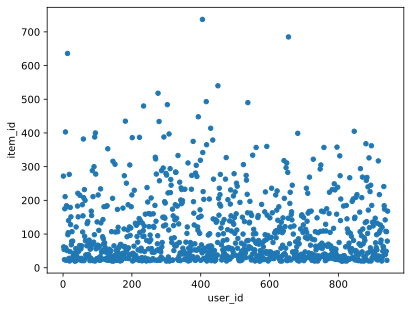

In [8]:
# plt.figure(figsize=(18, 6)).patch.set_facecolor('white')
# plt.style.use('ggplot')
df.groupby("user_id").count().sort_values(by="item_id", ascending=False).reset_index().plot.scatter(
    x="user_id", y="item_id"
)

In [3]:
df.groupby("user_id").count().sort_values(by="item_id", ascending=False).reset_index()["item_id"].plot()

NameError: name 'df' is not defined

## まとめ

- aa

## 参考文献

- [1][現代線形代数](https://www.amazon.co.jp/%E7%8F%BE%E4%BB%A3%E7%B7%9A%E5%BD%A2%E4%BB%A3%E6%95%B0-%E2%80%95%E5%88%86%E8%A7%A3%E5%AE%9A%E7%90%86%E3%82%92%E4%B8%AD%E5%BF%83%E3%81%A8%E3%81%97%E3%81%A6%E2%80%95-%E6%B1%A0%E8%BE%BA-%E5%85%AB%E6%B4%B2%E5%BD%A6/dp/4320018818)